# Streams extraction using Multi-Task Road Extractor
* 🔬 Data Science
* 🥠 Deep Learning and Pixel Classification

## Introduction

In this notebook, we will use 3 different geo-morphological characteristics derived from a 5 m resolution DEM in one of the watersheds of Alaska to extract streams. These 3 characteristics are Topographic position index derived from 3 cells, Geomorphon landform, and topographic wetness index.

We created a composite out of these 3 characteristic rasters and used Export raster tool to convert scale the pixels values to 8 bit unsigned. Subsequently, the images are exported as "Classified Tiles" to train a Multi-Task Road Extractor model provided by ArcGIS API for Python for extracting the streams.

Before proceeding through this notebook, it is advised to go through the API Reference for [Multi-Task Road Extractor](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#multitaskroadextractor). It will help in understanding the Multi-Task Road Extractor's workflow in detail.

## Necessary imports

In [1]:
import os
import zipfile
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import prepare_data, MultiTaskRoadExtractor

## Connect to your GIS

In [2]:
ent_gis = GIS('https://pythonapi.playground.esri.com/portal')

In [3]:
gis = GIS("home")

## Get the data for analysis

Here is the composite with 3 bands representing the 3 geo-morphological characteristics namely Topographic position index, Geomorphon landform, and Topographic wetness index.

In [4]:
composite_raster = ent_gis.content.get('43c4824dd4bf41ee886be5042262f192')
composite_raster

<Item title:"composite_3bands_6BC_8BC_8bitunsigned" type:Image owner:api_data_owner>

In [5]:
BeaverCreek_Flowlines = ent_gis.content.get('2b198075e53748b4ab84197bc6ddd478')
BeaverCreek_Flowlines

<Item title:"BeaverCreek_Flowlines" type:Feature Layer Collection owner:api_data_owner>

## Export training data


Export training data using 'Export Training data for deep learning' tool, [click here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) for detailed documentation: 

- Set 'composite_3bands_6BC_8BC_8bitunsigned' as `Input Raster`.
- Set a location where you want to export the training data in `Output Folder` parameter, it can be an existing folder or the tool will create that for you.
- Set the 'BeaverCreek_Flowlines' as input to the `Input Feature Class Or Classified Raster` parameter.
- Set `Class Field Value` as 'FClass'.
- Set `Image Format` as 'TIFF format'
- `Tile Size X` & `Tile Size Y` can be set to 256.
- `Stride X` & `Stride Y` can be set to 128. 
- Select 'Classified Tiles' as the `Meta Data Format`.
- In 'Environments' tab set an optimum `Cell Size`. For this example, as we have performing the analysis on the geo-morphological characteristics with 5 m resolution, so, we used '5' as the cell size.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAyEAAAO/CAYAAADYgsnAAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P0HeBxZet+N6nmuv+fez9dBlmXLli3Zlj5bsixfB0m2kiXtand2d3Z2AnMOCCQCwQQSGSAIAgRIJAIEwYTEHEEiECCJwIBAAETOOWegAXRudDfQ//u+1d1AA2xyyJkBObs8Nc9viK46deqcU6fe9/xPqPo1iE1sYhOb2MQmNrGJTWxiE9t73BZEiG52ViAQCAQfIWqNxuIJVmbj+O1dVyAQCAQfBxqtFs3NzRavYN6ECBEIBIKPHCFCBAKBQLCSCBEiEAgEglcQIkQgEAg+DvQGA0wW22zd+Dfvtxf+u0KIEIFAIPgeM6vXS47AisFolLAX1h58PvO6Y/b2M0KE/Oowqyfs7BcIBAL2Jz29vUhOTsap2FjExcUh/vRpJCUloa+//638jdU/Lfcptv7Ldr8VIUI+MHqDHiYj3SQ7xwQCwceNcW4OTU1NOH78OI4cOYLg4GD4+fkhIiIC/QMDb+UcZuRyqcG/3Anwb7lCAZVKBZ0dMfJ9ECGzZB/nyT4uRzSo3x6NRotJpRZKnf3jAoHg42Zufh71DQ04QX4lLy8PhYWFcHN3x/79+9Hc0iIdt3eelXmTCecvXEBqWpokKqy+hv3T1PQ0Yk+dQkZmpjSysvzcbyVC+ELAqxjthBW8CjvSiTE5yvqVGFNTeerthxMIBB8nbPyrq6txiox4AzmJyspK7PHwgI+Pj9RzxSLF3nlW+PixY8dw9tw5SYxYRQvH20jixsvLC0+ePCG7/aq9/6AihESRyUSObFqBwvYpFFjIb59Gab8KcoPo2X8buJOrLr8F/yioHnFdepBzthtOIBB8vEgipL4e58hPTExOSsLB89AhyT+0tLZ+rQjh4zk5OfAg35R26RJUarUkTGRTU4iNi8PBgwdRVlZmN55vJkLIQczRf/qxKcQ9HUJ44RAiLMSUyNBHYYSD+HoMJDpybtbg/w5uxo0hEnDCQQgEAhvYaFeRCDl//jzkJCJGRkex/8AB+Pr6vpUI4aHwgoIC6ZwLFy9iemZGsu0NjY3w9fNDeHg4+vv77cbzwUQINZyhUSOrehQH0lrxyaUOrLncidXEV/T7j48249rkLOZFp83Xwve/t2EITvf68XiUyozEm71wAoHg48UqQs6ePYvxiQlJPLyLCGF4UIKFyL59+3D92jX09vUhISEBnp6eKC0tfa2vencRwg5CrcKVJ334JLEVHo8GcLxgCGFEOO37WWg9jndoYBQO4mthodbdMY7zVTJ0KPSizAQCwRKsIoR7qKanpzE8MvJOIoRh58DD6wfovJTUVLwoK0NAYKA0xet1AoT5ICKEGs3QqpHxsA1/lNiFoLJpzEoj7EYLOtTUjaJ4bFbYy7dEP2cuvzkhQASCX0l4hJunOtmDRySs06Nex3chQhju9Hj46BG8vb2lacMM+5s3+al3EyEWB3EnuwV/dKEbSa0q6OcXp2EBeoyPytE6pVsyEsIJM5B4kSDH8cooCe3jYeOFMMTyMHxcmq5ELIZ7NS69ZZ/1mkvTYXsuwfHZHH9dONtpUkvyQthLp73zlqZ78TwDOwiTYdGhSuHMeViMy/x7IS4L+uXlarmGvbACgeD9o9XpJOwdY950jGHjX11TI42E8HQqWxHCPU1vI0LYZrETevL0KQ6RY+GeKh4BGRoefuP5H0KEmAxalJV04l+FNiOpU02hDMvWy+kxTz7HdhREsnts//hvgu3ucttr3bc8jK2ttPqYpeEstnVJOHOY5edzOl49/y3CWf6WjtO/tnmxHrOeb/vbetwa75I4bY/Rv5JfWPabr7MQ3k4+OfzSMPy32d/YXlcgEHw42Lazj4iOiUF0dDRi6F8rkVFR0loN9hVvWj8oiZCGBkmETJAImZqZwUFPTxw+fBitbW1vLULYn4yNj+Po0aNwdHSU0sM+ju2LvfDMO4mQOYMODS878evBTYhqU1GI5Q5i0bhZfxupka1RqNEyokQT0TWtlQyY1djxwkNQvH0T5uPNw0q0TGqgpv1zlnj0lInxaRWGVToY1Bo0cziibUwNBTkE6/VmKdzIlBoy7Symp5RoGFFhSEFOno7PUTp0anM6zOer0KPUgS6yxPDO02+VUr1wjeZRui6F4zAsGGZVGrTR/iZKZ4dMAw3FLV2fCpl7miamVFI+mG7Kq4bOY+dmpILuGrPkkdI9ruYbQ46e4uulNMspzXwNJZVV/zTln/IyOK5EI12nfUIN1fJyNeoxTWVizU8rp4Wcet+UBnLdYvkKBIIPAzsHXsPh7+8vDUmzQbfCoxJR5CDeNJphNdxFRUWIj4/HwOAgurq7pXm3HEdjY6N0jeXn2YOdCE/B8vbxwa5du3AmMVGat/um89+3CGFfYJiRI+BMLf7XnVEMkeCw+oDXoTfOQiFXI/FaI/5jZCP+KKIOf3p9EA3TOulctrHsBMcaBvBnsY34Qwrzx5H1+K3ELmR2q8gxUzzsg2TTcLvYgNWPZSgt7TGHi67HvznSglMdCujmOZwBGJvEhjMt8Kmaxtmbjfi3UW2IqJthTwi9XIWHj9vxbyLo3KhG/Ge6zh/fHME4+Q8d+QZO7yx3KE0rcfNBG37bEu4PTzZga9EMTOyLKL0F+Z3406h6/OEJIrEDKSTGpJeX0PVVYzMIuUzXPUF5pTT+SdoA+ukc9rs9Nf3469gG/CeK73dPtsDrhUwaRZI39OE/xrQgpZfyaTJgqLYP/zOqFafqpxCU2oD/52Qjfj+0CWEtSqgt5c3p1JJvuni9Af+OrvXHkQ34/fguXH7Sjf8c24zzPbPkt81hBQLBh4VfMHLnzh3s3r1bsu/8r5OTk9Rh9fTZMynM64QAixN+ycnJyEgEBgUhkXwDvxmL13FwpxWLGV4n8nW+huOZnJ6W3qwVEBAgxcMjKbxGhG39685/exFCxkmvUSM+qQ7/7TI5w1nD1zoI4xw1pAdnEJjUiD9NbMXfnSbDzEa1XSX1/LMD4UZ36dNu/GlCC/6SwvzwbBN+51QLAp7KMElhZo1k+Kem4XqmBv/z2hCSC3rwt2db8YPzTfi3fg3Y9XQSMjbeHG5sAp9FNWDj4xEcv9WKPznbifhGOYxkikd6ZIi+2YLfj6Nz6fy/TmzAf0jsRUm/Cqo5ug6lV2/Uob99HH5XWvAf483h/jyuHpuf8jxqEhjjCpy80oz/RU7o7xKa8EenW3GyTmHuHaLz2+oGsfZMA/5rQiv+6kwrPrk6gBFKm4ac0/3MVvwB5YvT/l9i2xBbN405kx7Nz1rxj0+04f4wpX9ej5qCVvxGSDP8CofgkmIukz861oCAWjmm6RqSGKJy62gdx6aYGvzB6Tb84Fwr/vJMBw5dbcRvRHcgZ4ziEutLBIIPDhv+ouJiyaCzY3B3d5ecxNGQEGmY+00jEXyMRQc7h/CICJwmxxAaGiq9JSuEzuffPDrypl4mhgUIv2GLh8ZZ+Ny5exeHyblwDxmf/7o0vG8RwnZtpH8YfxNcD8+qGcyTfbR2phioEW4ebTczT41unZ47uCbgeLwOf357BKMcRiNHRFoj/uulYYxRuZj0GqRTg/8/HmvG6W61VFbzJjUe5ZNYONSImD415Z/inJRha0I9/r/BDfhR3oTUqJ8zqZCe1Yp/cagZsYNqqSMLoxP4lHzMb1JDP7FTt9ABpZNPYV9MLf57ch/Kpam1nPYp+MfW4fdie1CmnaW06KGSTcIhohZ/cXUQdSoKR9eRj47hbLWSbLYKF2404z9Ed6NoRku/tXjyrAN/EN2J3DEtjBolDkRX489uDqNXZ+6UKqkewyj5jfbaAfxxcB2CGpSYJZ8zPKJEWccU5JTmmdpu/NNjTZR/swgZeNmDf+Fbid+M7UDWiHlfzfMO/NsjDYjv01LZGmBQyxF6vgF/QMLjsczciTfZPoIfHK/C/yuoEbGdQoQIBN8XuIHP9jQzM1PqpGJfwwKgpLRUEgf2zrHCNnFqagpVVVWoq6uTOr14pL28vBx19fXSi1EUJHLe5Gf4GE/j4rdgsXCR1oCQ3+E1Inv37pWECAsle3G8tQjhHhrlzDi+PFqHNSQQTDYOQs8CYGHOrtHco0OFopycwFZyED/MHANLAZ7P++hRG34vphsvVWTEdBpcvd+CP4xsw/UhneV8PXqa+/E/vOqwixyRNJ+V1JXH+Xr8WkAjNr+YsoSbRT0Z0987VI9dtTNmB0Ei5IuYevx/Tjbj3rDZac3TfuXwGL4Kq8HPKB39Bj6X06vERXJWvx3RiUczlBbKw0TPMH5wtBab8icxMW8ONyufxuNuDQzKaXjG1+HPrg5hkK9F139Z2oU/PEmN/gktFORcvgiuxqZCGZ01JwmKju5pKCjPT/La8a9IWOSO03Uo7dMylTQqoiOn2/S8Hf8ksh0ZIxQnnVNX2IZf86rCX90aRo+O4qHwlU9a8Ft0/qVBHrkxYKp/FD89VoO1jyYwOsfpNGKqcwR/HlyBf3mKHRbFJUSIQPDBYaPLFJMQ4dELFiAhx45JQ9xvEiAMn8eGu5uESF9fHyrJSXAPU0dHh/S7u6fnlYb8ctg51Tc2SgKEp2DxO995jrB1jcjFpCRMkgOy10v1vkWIkWxWb3cf/jCwCRGt1Cgne8j752a1aGwfw/FHAwjOH0J08Sjyh6iRTrb1cXYrfiuiCx2UfraD0izozkH8p+BGnBvTQd5LtjKsDvur5eRLLD6LxAtmZxB0tg7/+eoIZth/kQjZdroO//z8EAZ0VG4sLmbJh2gVCDhfh39PokbDU49JhPwsqga/e2echIo53YY58gV5bfjXx9uQJ2fhY97PnVPy4SH81dF67HupoLTN4ll2C/41+YxS9WI4aZoz+73WQfzJkUac7eJyZ9s/D8hnsDu2HhtLpjEhH8NP/Gqx7qnZB3JHHoslSiSePG3Hbwa1kWBgP2qeVmaeNkUNDBIhvx7ahAQbEfKvj9ThUINa8hNayqdRMYbPQ2rxaeG0dH5bWTd+72gTrozqFhazG8gntj5rw68fFSJEIPi+YRUit27dkoQAd359nY+xwnZCT2LFQOFZTPCr4GfI9/Bv3m/vHFvYp1y4cEHyKaUvXixcl9OUk5srdb5lZWWRbVmqK5h3ECFkUKdH8Lf+9dhWNrPoIPQ6NLcMYtPFdnyW2oGvrnQiooEcCDmIQmp8/9bxDtQqyWCRaJEM6/Ao/uJYLQ41qzE1MI7PjtXB4yWJCDKOPLWLDSLmVUi63oh/k9CHPv5NIsSdHMbvpo1ijH4vOIg5LYVrwO+cH8CkJEIm8XlMDf5/WVNSzxmnj0dj8jLJ8J/oRKXWxkGQgVZNjOLHIXXYXcqGV4vb1xrxO/E96KSCs4bjfLPzqK7owb8PbkH2KDs/s8MzTcmwLrKWhJEco2Oj+IFvLRyLOS7zKBFPmQJInT5oxW8EtaOIhRc5QnZeDDuR5SKkJr8N/zS0BddGOKyl3CeG8OcB9XCTHJkOGbeb8Nsk5JrpmDWd/O78Zw8a8esxQoQIBN8nJANPNoXfv84jGM3vuNCPe7LYqPMaDj6fHQ3//roeLobDhYWFIZSEz8DAwIJzMFB6+NW87ByePX9OduVV5/AhREhPdy/+8HADfGvlMJE9ZNHAIqS5YxzRBUOIyKLGtnc1tr4gHzMnR2hSA/7BkQbp7VnryPesu9qFTRca8Y8ojGeDBk013fjdo2RP+6nBTbZ34Vrzs8jLaibh0ImX3JAnEbI5rhaf5M1ARb5lYQSG/Ep+ZhN+J6YHjRYR8pPIerhUKs0jIBTWZFIgntLxLy4MYNpijxlpKphSAc/oGvw4YxwK+i8ioR7/++4YNBb/ZIVHPZ4Xd+DXvWrx10kd2HTVnJctaa34ff+X+PP7MkypNbh0mUdrmvB5xjBqpskXkV9lcaXoGcEnR2vwe2c7cOCZDGoSEnOUL07j9CsipBu/QyItmXwM+yDOg14/CUfyy3/2YJLujAY37zbj12O70aXWWfwtQfFpGnvxG8eECBEIvo9IU6JkMqlRz7/ZfywP8yY4PL+BkacQ8+jI257P1+UXqPDIia1f4vN5OiyPqnDHmz2f9W4iZGYEPyQj+WXeBPSWkRBmakqJsm45yhsH8edBVfj7xyRSjEqcvdWE/8u7Fv8lpgn/I7YJ/534k6gG/JOAGrhVqdDR2offD2rGmU7VMgdhQHlhO377SCvytGTsSIS4JpJxzp7CtI4MpiUcO4inOc34NxFdeCmJEPN0LPcqchBsgC0OIvI8OYiUwYX5rtb8aBVKHIqulhzEDP3nG1OHnz6USc7QGk7qpTKokfG4Ff/wcA3+Y3QT/qclL38a3YDfCKjGqkI5BVEjlcTBPwioxX9I7MGTMTW0dD2D0YDZ3hH8VXgt/mlYAzmPMYzSfsm50r/LRUg1iZB/Gd6Gh9N6+mlO5/T0MP7Ovw47WPyRIzsSX4/fuTJMcS+WGcdV86QNvy4N3QsRIhB8n2ARwmswuJfpbQ27LXwOz9vl6VgKpfKt4+BwvJaEr7vcOfC/HCe/CcVefO9bhHDH0PSYDOtCarDxqQxK7tG3HDNPxzKSWCBberQOThUkQnTT8DpXh9+/0I/slik8bp3CI6ZtGsU9cgyRc3tZ0Yl/GdKK+4Pc67+YR8OcEcUPW/CvjnbgiY0I+eHDaSiWiZCH9xvx2+FdKJdEyDiJkAYcrKN7YPExMMkRnliP30wdpHJczI/0t1KDwLhq/J87Y5jSy7DjRC1++nj6lVflQq/Bo7xWaTQlpkqGJ+3mvDwknnROo3FSS+H0UCvIFz3vxX8LqMS/imjCTx5PSiMe8+ToO0fJ16XV4R/61OD3z3UinkeTSHTYEyH/lkTI+UHzuhmrCNnBIiSHRYgKKdeb8I8S+jBi+/0quo6qoUeIEIHgewz7Gu7kelsfsRy2y729vZI4sHf8dfA1X9e5xiMl1g6w5bzTmpBZcqInEmvwPy4Po48azNY3lHBm59hAz4xjVUQtPs03i5CE6434nXP9aJJpIVNqMa4wM63WQWfUoa2lF79HIiTRjgipYBES1IpHy0TIFIsQy3UNlIa8zCb89vFOlFtEyM9JhHjUKGxEiByR50iEJA9Ki8it1+A0swg5TCLkRyRC5LoJrDtei5/lTy9twFM4FiF3Sezw6MOzEQ3kqsW8TKl00pdo2Wmxo2ypH8InsfX450dq8Cf3xqR0GGZ1UGt1uHW/Gb8bWof/O7wFpy3TDV4nQh5MmUc5OJ3TU8P4W0mEyOmumMXS794YWeJU2ZnUPhUiRCD4vsLPMjsIe8feBu5RYiHzdW/UWg6Lj9ddl4+9zlm9bxEi2VoNd+Y04h/GduH5JNl+G78gjTyMDJtFSBmPtqtw8Woj/tmZfmntA4flqcAm/psa2zDNorNpAP+dGtynOpQLIytm4aDGpasN+K34PnSzwCERsiW+Fn/xYApauo4UjtNDfiz6ItnbCwMYthEh+21EyNy8BrdvNeG3yD+0kx02jy5YfMzMJNaH1WJVvgzzZLsDY+vwO1dHpHUbvI5QyhfFQ94W1VXd+J2jrbg3Yh5tN+eF00qNCkrjLF2LX5wyr9dBodEhN7sZ//xoE67yqDkd5/wZdFqMjcmxL6YS/+PaELpmjVDWvasIUePqzSb8k9hu9GgW88MjLrLqbvyzECFCBIJfZeyNWKwUby9CCBYdDWXd+M2QeoQ3LXs7Fhnc+alxrA6vxc+5IU9GNT+vHf8yrAMveToWNYrZsLNhZkM6R0z0j+Lnx+qwr2rZdCyTCik3GvFbp/vQy795OlZiHf7DrXHM6CkcG0V2EDo5/M7W4d+lDFmmYy0XISxotHicwfNwO1FDAmbJdKxJ83QspxIeYVDiODmh/5A6iCnj4qJ7acE7ZlFFhvvfBbfgPk/Hsjgzc17M6ZH+ZkdBf7Ohr3jUjH8W1oKbo5ROdg60n4WaaUaOvaeq8L/TxzA6a0Br0buIEE6nCtHn6vDbF/ukhZfWr9Ob5rTISRfTsQQCwXfDexchBI8cz4xMwy2uFn93cwAFE7zGgW0wYwRGhvBfj9Riawl3yBjRXdOD3/NpwJEmOXkcSzijBmX9SmjIPhqmZnCIfMdfXB9Es8YajwHTvUP4W/I9W4umpdEOFiHbE+rwa+HteCiJAF5fokdvVQ9+J6hOmgrLtv5VEWL2EWMtA/ifweTLKmegsqwn5Cm+RYVt+J3jrbjSz37DgKrSdvxbH/MCcq3JHG5OpcRLyqd6lATL8Rr8NHMMwyyiOA0mHVpGFRia0UGjU6N93Jq2eahIXPyWfz0SKO7xGRUmebovT3k26nDlCvnLC/1o1BilcG8vQiak+Pta+/En/tXY/nwGGikv1CiZlmFPbA3+30Ek6oQIEQgE3wHvJEK4QaynE25ntkpTkrxrFTBIxpIh4zc5hr8Jq8YPHpIIIUOsHBzFJyG1+Ps7oxiwGDIYlLheN4VJNTWctWqkpTfjD6PbcXtkcWF6b/MA/kdwg/SGFGnRO4mQvbww3b8R4Y0sfjicFsWFHfitwEacaFUuLExfLkJ4gbx8aAy/CKvBLx6MYYAUnjm93IvWhH8f14WiKbo2Xae9qQd/dLgG25/JILM4Ei05hqvdGszxwsWoWvxJyiBauOeM0zCnRmaTDL3TWkwq5Hjexe+15/OMaC5swb8IacNDuQbVvTMYVpgdhEmlgPcpKqOMcUxS2lrfaSSExR053tZe/DdK545n01QK5ut11PXiD7zEwnSBQPDd8CFECMMj4dNDMoRlteCv4jvgk9NvJncAXmlN+PVjLUjqVUtvyJrXKHDpcTt+37Mem3P74Uf43OnC7qIJqHQc1ywGeidw6EwD/vJKD7xzBuD/sBtfnW/FtowxDPEoNvsYtu8kQn7rVAe23+iCL10rKLMDfxDViC0545BRg1sKNzKGn4SSKKm2Tvk1p9kwR/6oqA+fxzbg83sDCKB0eD9ox9+SPY6unYHO0nFlnFPi6v1u/NXJeqzJoHAP++GZ2gLnKiW5Gy0qG/vwv31q8aMbPfB5OABfCrszZwi15KNm5CPYSL7Sj87xo2PrzrZgF/m0UaiR/rwbO5K64P9oAAfv9+DnCW1IbJGTlyNRV9WFfxzQgJhO9lsG9JV14d/4kHgZsBUhE9joX4U/yxyXRpTmTGoUPO/FXwbWYwOVvT/lZ+9tKteLDfhHIUKECASC74Z3EiGM9EEntRblrQPYGN+Mvz3Tih+eb8MPL7TjR6ca8I+Pt+HWoBoGajzzgsKWnkF84luLP05sxd9faMPfxrVhX7kMMxQXv5JRpVAhI6sd/+1UE/7PuTb8/flm/GliO8Kowa3gRjgb/qlpuJ2tw39KGYD3dfP1Pknk19G24GTVtPSWKSkcrwkh4+5etShCGL5Of+cEDpOQ+QMyzj+idPzd2Ub87aVBFA9TWi0NduO8BuUvR7A6qgb/5QyFo+v8XUwTjraRMzbq0Ds8grVH6/Cf41oov234G8qL85NxjNK5gyOD+PnRRvzgIpUFnfffyXleaeNZzSokZbTjbyKbpXP+9+lWrLo5gNoZLebouk1P2/CPI9pxz/KK3qq8VvyL0FZky5aKkL/2IRHygsWdefi/rHIAPz1Gooji/Hsqt9W3+nDiehN+Q4yECASC74APJUIY8xsXyR5Xj+F08QgSSiy8GMWtNgW0c9awPA1JjdKqMSRawsQXT6BTw7bTHMY4b4RxSo5r5SM4TcdPFw3jMjXQp8lHSI1wA13LsibkJ/lytHWMS+ES6Lrnm2YwQ41taUoS+zSlCvmNkyif0NJvaxoYHvE2YJgED58npbV4FA+HF0fOpXAUBzfyG1vM+eLrJJZNoF1J6eW8QIfOzkkkW47FPh/D8yE1ZikOrUaJvPJRxEtxD+MsiRsFxWUi3zQ4NIXLdA4fiysZxYM+tfQGS55doJ6Ywc06GZpnKB+UZ/nYDO7WTqJVQeVsSdfsrBoldRN40G9+fb5UrqZZtLSMI5HjpTK71K7EVFMffvNYI6LbSYQIHyMQCL4l7yxCGG4Y8/zTqUkVGgYVqB+ywB/Wm9QsGH82ZPPkLCYnlWiwhKkdUmKSP8xnCcOiZl6nRdeoAnV0vI7i448Vamm/9A52+lf6TgivCXkwjdEp9UJcTRSOj1vXiPAozaBMjVHVq3OmeU6tSk7ptZxbT+noV81KH4FaDGeeUjUpU1rCKNAwqsKMznKM8jIzrUKT5VjtoFK6lvRhJ7p2z4hSyoM1bQZyEAa9DtMzajTTPj5WS2U0RNeVpm7RNfnDiJ2TakxbyoS/m9JN587wb0u6tFQ+/RNq6aOJ5rySMyTHMzphTifH2yfXoeFZq7Qm5OE4OVXRSyUQCL4FH1KEmCGby+sweLTdhsW1HYvhTEvC8Hc6bI+TLSU/sSQM2War37AVIT/InYaaX3tuDcfXso2L/pa+2P4a+ypN7bK5juk1DXUe7bENZ5teaVTf5hh3VpmPLcsDpW3Jwn2bYzzleaGM2IfS9Vhwaem3tSyWlhH7dDrP6g/Jx7NgkdZ6WuPlEfeiDmkN5lMSeXML5woEAsE34xuJECssINhQLWWx8Ww/3GLvixUWNfyGD9t4lhhQiwj5i0wZpmbNhlIKR0Z0+bU4nuXxW+H3tttew/YL5G8KZxvf8jwvODJiaR4W08b5sz3H9rrs4Hjf8rB282U9j5wmL1hcTAs5iHktktMa8KeXhzAKusay8wUCgeBd+PAi5D2xTITYvh3rY0Wv0qBtWgvpQ44sRGCAWj4Jh7A6/M+sMalTz955AoFA8C58KxHyXqBGtq0Ikdm8HeujhESKdnwa13qsa2MYHcoquvGHvo0IalPSLuEgBALBt+OjESE89WtiEpsjq/GXWdOQf+wihEUZf/fqQgeiikaRXDGOy1WDWHumCT9M7EcVf8zR3nkCgUDwjvzyiJA4fuXtJCaFCIF6ZBD/O6IZm290YQux7UYLfi+yDQkV05h6ZaqCQCAQvDsfjQghm2pSKHGndBDJrSqoxUgIDHNqPC8dwsH7fdiXSdzvxYGSSYzytK2P2f8KBILvDrK9338RQhgoka0D06ga00Bj5/jHxqxBi7aOKenNXFlMowx5w2rMmwxiGpZAIPh2kGOQOjs+FhHCUH75NfFYWPD+saMnf2IdabdA5bNkfYxAIBB8S34pRAjDc1Bftxjw44Mc5pxeWly5gJiCJRAIvkM+KhEiEAgEgvfOL40IEQgEAsH7Q4gQgUAgEKwkQoQIBAKB4BWECBEIBALBSiJEiEAgEAheQYgQgUAgEKwkQoQIBAKB4BWECBEIBALBSiJEiEAgEAheQYgQgUAgEKwkQoQIBAKB4BWECBEIBALBSiJEiEAgEAheQYgQgUAgEKwkQoQIBAKB4BVWWoQolEq71xUIBALBR4JOJ0SIQCAQCJai1WotnmBlNrlcbve6AoFAIPg4mNXr0dLSYvEK5k2IEIFAIBBYPMHKbEKECAQCwceNECECgUAgsMtKbkKECAQCwceNECECgUAgsMtKbkKECAQCwceNECECgUAgsMtKbkKECAQCwcfNdypCODK9wQCD0Qjj3JwE/837+Ji9cwQCgUDw3cG21tYG29phe+HfxEpu7ypCrP6F/+bXOmo0GukNXvw37xN+RiAQCFYetrNWW8v212qHNTrdEjv9NnD470SE8EXZ0cmmptDV3Y2W1laJzs5OjI2NSRdiZ2jvXIFAIBB8e9jGsjMYGh5GW3s7msm4t7a1obe/HwqVCnN03Oo83oaV3N5FhLBv4Xxxfu7evYvTCQk4efIkIiMjcebMGWkfv+aRnSGHtReHQCAQCL457DvYvk7PzKCsvBzXrl/HqVOnEBERgeiYGJy/cAGPHz9G/8DAW4uR70SEzM3PY2p6Gjm5uZJDOH36NOItJJCzYG7duoU+coQc9l2coEAgEAjejNU51Dc0ICU1FQlkh9n+xsXHSw12/vvixYt48eIFdJaw9uJZzkpubytCWFiNjI7i+o0bOBYSgrRLl1BK+WhobERjUxNelJXh8pUrOHbsGK5euyaFFR1eAoFA8N3BgoLhjqB48issPO7du4fKqippX119PZ48eSL5nrCwMOTl50OpUn2tLf7WIoQTxSMesbGxktgoLi5Gd0+P5AjGxscl4VFFibxEjuN4eDiKS0qk84QQEQgEgm8PC4oZatCnk0MIJeOfkZEhNc55NGR8YgLDIyNob2/Ho0ePpNEDFim8/22EyEpubyNCZsm/sLCKiopCUnKy5E9MdC47Nk4/w3/Pm0wYGBxEckoKIiksO8S36YUTfCAMfM+AeaOdY69Db4CRzjHNGTBr77hA8KH5JvX6lwBur2t1OjwkH3L8+HFkZmZCoVBIdnd+fh4m+pcHGPg32+PqmhppZOTCxYuS/3mTLf5WIoQjfl5UhODgYOQ+fCg5Qk4EJ4bhxFgdBGeg4uVLSSHxqAgPrX8vhAjlwerMFiHFp7cT9gMwazC+IS166F9J+yL6b1q+dK/4/mh1do69jm9yzjeEy+TV/PJ8cPvh3wQ3cvSGb1kPyTl+V+l5I3Q/7d7vb5v+75DvpDxXCP743vuon+8TtsEsKLhnikegefor1wm2v/wv90SxnbXaYxYmPJLAjqSDwn5dQ30lt68TIZzufhIdnFbuVWP7wnngY5w3/tvWh3AeeToW98bxqAhPCfg+CJFZaphYfeIiJKK+F88J2xQWdK9LCx2fW572RYxs5+ye9wYMdN7gS5yNCcPdmpm381NUhqaZPjxIOYGzuc2Q6/je2wn3XUE+5nX55TKxe85rIf9AdfVbtSmojAx27oNxBeoQ+9fl1+H6as67/XPeL+ayeH2d/UDY1Ov0t63XvyRY2/rh4eHStFe2v7yP/x0mn5KamoqXlZVSWLbJ3OafmJxEWlqaNDuK7fLyOK1w+G8kQtgBsMM7cuSI1FNloARxojhCdnzcK8XrQ6xOYiHBpIp4RIQzxL+Xx/s+mZ3VQTkzgf6ebnR0dKBdoh1tHT0YkSmlB9/eee+LWYMWU6PDGJ+xcwMpbRqVHIO9bWhr53R3oruvDz09XQv56Bt7t4WfDBsg2ZNYrNrmigcdgOltFL3RBEPTXThsXotzL9RkGO2E+U7QY1anwdTEMLq6rPkk2tvRPjAODaVj/h0M06xBB4VsDKMTcmje2bGYYQesmhmjcu9ZrEOUno6ePshUvHjL/nnvDsWlnsHQYD89d5brSNfqRM+kSuqJMKykU34LZme1mJGNYHh8Gmrd98gAG+dhGijFEbfV8L/bCS01aOyG+yWDbSsb90uXLyM5ORkqtVqyqbyfGw48GuDr6yvZWmtjnP/lDqGcnBxpPYVcoVg4Zo+V3L5OhHA62YHxvGP2N9Z08v4HDx7A398f1dXVS/yI1c/cvn1bmoLGwuXD2XE92UI1Op5dhMe2ndjl6gpXxmUXHNx8kZLfAi2oMW333PeBga4uw7PkUMRdr8K0jqdKLx6f1VNdUUzgfswuOO0yp32XsxOcnHfBhf52cXaA9/k8jCresdPOSH6lIxduW7/EyfzJtxNj9AxjshkJh9fC7WwJprSmb9eofwPckSJ7kQonRyfstt4zVxc4unkg7E611LjkMG9z37gMFbISnD4UhPzu+W/WQ87DPyNViA/eh+2OuyzpoXvhtBNR92oxo116374NBr0W3Y/isX2nk3SPrfV1h4cXzj5uNYvOD/Y8EXoSo6p2XD1+EHEPuqDRf4/Wf1G9RudDqV6fyJv4XnUOfhvYpnK7/ejRoyivqJBGoq11gMUGj3o4OztLo9Dsj6zH2A6zFmA/w/aafZJtvFY4/DuLED6JnVdMbCwys7NfEROXySly5eWpWcuP8e+a2lpp9GTgg/ZUkaM2KFGfEYp1n22Ah1cgAvz94OfrDU//SNwr64bORA7d7rnvAXrY5g3tuLh3M8IzBqQRG9vjejLKiuEmXIvxxGFvP2psHMDmz3+GVVtd4RMQAF8fHyTktr2zA2ajOVN3H6FRCSgbnKMysh9uCdSoM/QWI/ZkGLKbqSG0UiKErgN5F64cdcLPN7nA2z8A/n7+dN8OYNseH1y8losuGTv+t8mzkRruE3gUtx++sXkY1+IbOTXjrAattwLxyRebsd8nkBpGdC98vBAcmYiXQ6a3K7+3gRzRXGsGnDaswTYPb8o31VXKu5+fOzbvjcTTslqMqrGCAvBroHpjmp1AfuJeuIXcRJ/qA6ZlOVRv5sebcSUhFGnFg5TW75Hj+hawHebFgaHHjmGInIStrWXnUPjkieQceC3F8vNYsCSePSs11tkGWx3HclZye5MIYYfFox/c88a+xpo+FiPs9FxcXCSnx05uuQ+x+ieeevbw4cPXOr+Vh32MGg0ZR+HscRIVg0Zo1AopbXKFEioNCSQWyFQWc3M25U/1k6d08LQjfq7m6O85smkG/sOyzc+/6pt4RGMxBIVZMm2JzqdI56n8jFQevElhTcO4FUJi4mIVNLyDfJ5tnLpZHdQqTq8KKu0QbgVsw8bDl9CnVkGpkEOu4brGzzoLGinChcYX6wbbzbikjpnFot762yaftufNLel9t4wEL8RjzRPtm1s8yUR5XFo2fJ65nKXj9GwYqazmTfZHJ1hgjD2KwhqHEDwf1kFD+VeolBgfeoqwTWvhcDgCpf2GhZEB9plcBgsbdwhZ4uJ2qbbzJty3uCCnWyrgN5TPq2mR4EgGi+HvtAtRBR2Qq9SWOqSAkuuQJRx3INqmwzRP+bOJZ5bLgO69kcrQHOxVAWzUa9B8LRAbDySgdoo7OvkaCvQ1Z8N/9efYHZKMpsmlo3hL6p1p/hX/v7x85mw6CqU08Tl0T22q95IwSzBQoSlJjO7fiKDrrSRC7HcoLS+L5fFxNLYb17uF45b0ztnUaSOfT3FKdYfC2qb129drho8vRjpP9dlI2HvOPwRnyVdcu3btlfY8+xlebrFr1y5cTEqS/IqtL2HbzC9ICSEfxf9aR7Jt4fDvLEL4wjw3jEXIcgfx5OlTSYDcuXNH2m+bICucEXaMvJJ+eabeH+wgVKhNPwJ3n3Nop0aT7caVxGq4JGdgPY8bwrSxgedKyfWKKyF3Vlg3e3NWeUjbdltSCamicgVlBzFHZcub9H9tI055bMTJxxPSPja2tnGysTSnhjZDP864bYBXcjkMll28SXP1KF5zrPPmh4MfDOm3ZaMwS3rRpYeBzrP22tATazbcS89b0sCm/ElnzVl+WxwpP/y2ZfPqSIX5IbVu/PDN04kmeviWhiMsIuRSkAd8r1eCdINlM2Co9hlO7PocTsFX0a5YdC56i8O1blyG0r0x0DVM48iOcoXX2SIopTSQUdbpyDAudebLjbktxlk1mq4fwTafFHTbFg6Xl0350OWWbEsMl6Ws5ulZsKb2FSMliZBM7N66D+k9ekso2kxTKLt2AXs3fYbjtxswQ+EWHOuy+7ykHluwvTfcAFmot9a6TcbTYKmTvL12PjZdi0VI4fkD2Bt6RxIhdsUo5dv2flOmlxx/7f2SzrU+J8aF50R6Jt6mrlHZSmUxb96n5bgoLD/H3JCxbkuuJ7HUObATn+NnmRowKzod5Gtgu8ovA+FpR2VlZZJNtj3Ov3laEjuHGzdvLjnGcGOOR7J5cSEvKnxdQ30lt9eJEM4bv+rxxIkTksiyigz2Fdxx5UsCnNM9almAbvUzVjgsn8PTf6XRHqXyFaHyfjCLkMbMY3A9EItaMuMLNpXghpJioAGFhQWoGVBaGqH0zOrGUf28EE+bRqFXjKK29CU6p7QYbspHVmYmMojSliHJLpufdXO91wxTXLn36XgGMjLyUNMpI8totvkGnQoDTZV42TFEDcpy5GZnIvdZBcofX8YR8hvOfmdwJ/MhnlT1QEW259VnnJ+TSdw7uhNbfW9ghP0jPUN6WQ9elFSiRzaJmvx7uJtTjM5xBdUvA3qqcigtWcjKysSDhyXoVdIzyI09Os8w3Y/yknJ0TGokP2ZUUj7LKtA2qUZfTa6Uh8ysfDQMyUlg0DPJz6t6Es1V5ajtmZR6wA1aBXrqX6K6R4axrjLKE+U9Iwcvmgagpmd2sWwMmOptRIFULpl49KwS3cOdqCxrwJiC6sqy51gSIY9jsH5XOMpkix1JdEnMKjpx4dBa7DqZiSE1T1Gag1Y+jppnGbifkYVMym9eUQMmyQnPz2nQV1eMjKQgbF27BRGpD5D9qBRdk1wf9eiufID7C+VTSjaTy2dpWiT45pIICdztirjnfZJtXh6G2uIwKobw8gmng+pIxgM8f9kHDXkyFkR8P2f66lFS3Yb+gQ48e3AXGYV1mNSaj1njkUQI+bOth8+jWUn11ZIebrSrRysQ4bQa+5NLIZ9lO2mpdyOWepeRgZynFRiUk8Cz2F4uszk11WepfDKRmfMY9STsTCy66Z7KB5pQUtJC6ZhBw/P7UhlmUZjWCaq59kaNOCGqZiR6bkHwLfsihK9pVA4vlEVWbj6aRmfN16TjPD1yqD5PWtfAZZ/14CnaZTqzqOS6qRhBzYtySsM0WoqykZ5VgNpeGWane1BaUkP5m0FjEaf19fW6823rtZRm9tNa9FeXIIfK8P79ByhuaEVXax0q6vqg+oCzCtjm8ttueRSEp/1a7asVSYRUV2P37t1IsiNC+G8ejb5+/Tpu3rr1ip+yhnknEcIn8IV4DnJJaemCiODeFZ4r5uXlJS1SV5Dh52Mc3hZrHDxdKyQkBINDQx9IiFhFSDDcDiegUbbMQdDTNVFzD2GhR3GjYlxq4HBjxzBZhcTjYTj/tA/GkWqkRF/E034Zym4dhY+PL3y8DuPCoxYo9CbKp/k63JHR8+wijgZ4wdfXG4c9TyKjiowJOQh2RCblIB5dOosrxbV4ciUavoEhiEy4iNMhe7Bp1efYvOsgDvkdx+X8Fmjsjs7ooVW1I85lPQ6dpwY1VWl2ENM1GYg8e5sMzzMkBu3H4ZPp6FbpoR5rx624Q+YRFEpzyMmraJRT44rTS+fN1GUi4tR1NM8YJSOr6yhEdOxllHV2Iz2ez/OFXwDd/xGtuaFNDzWPhJyKPIeSIQ0ZARISo7VIOnUWj1pH8STND14+PvDxDkdW4ziVrfV+c8NwCDmnwuHvzeUShJS8AjxIPYvk3FZKy7KHzypCjnjA61Ippqllb+uEVaOP4LtmHQIy2th6Soa5s+AcjvhzufvA61Awrj1vh4rsmHKyBTeOH4DD5tVYu80Vh3yCEHX1BRR0r0ZrsxF91BPeVDbehwNw5lYxxqndb6+nikWIZLS9zqNVvWi0F6G0kbGpuh0i1Q8/P28q8/N4MaYgI0RGj4zq3GgdUuMTkd3YiowYX+wPOIXc2kHM2vaCUAbNIsQDN1oVNiKGJacRzY/CsGWDD3Lb5eT9qBFB4TWT3bgTZx4p8/EPRFrJiNTotp5nMGhRcjWQ7g3VA28vRKVXQUn3hAWzerAGl2IuoIAcfMXdY1JZcN0+n9sIOdXt5Y6b683XiRA2/rPKceSe88IhafTOD2fzuqh8zGnSkzrpLDyPI36W+3X4KK4+a4OK9utZFMkHkJtGz0lJLQounaR0H0XK4zboJ+stdW0EhSl+OEx1zdcnQqpr3Ng2j4Q04XJCAjIbxqSymZ/pRVZyIm6U9aMyI5LCe9P1gnG5oBlKvp6UP6qfLPJunkXQIS+ybQGIu5qOxw+u4/zVIkyqed3V0jy+L7hRzXNwuZFt3WdrZ7nTgDuErCLE9pgVntZ09epVcqYZ3ysRwv6A16tEkAixOj7OL6855HUvBz090dDQIO3j4f/lcL44Dn45Cvui1tZWuz1wK8/XiBCyrYreSpxw+xQ7gnMwSf6APAx6CuKxaa0rkiuGoe8rRtD2nTgQEYkLl5OQknoJ5yN84OqxH9dfctlQQ5gaMEPNRYg6dAihcXFIuXQJp8lHeR7wQ1bziDRNFZpR5EYfxDqXg4hMPIsLF9NwNeMxcm+cwiHHddix/zgSL15G+tMWKMnXvepj7IgQbmA23sSWVY4ITAhHXNwFnL/yAI3DM1AMlyPqWAhSUlKQmnYJIe5b4Rl1E60zZrtsas+E4zpHJNdNQU/2GEOlCHDaQI3fMJxLSUbqpcuI9tuLPV4ReE7GZJZ7EOg5j/FwgO/Naij4t2oAd8N24Rc7PHEqic5JS0NiZCg8XPbgekU/1PTcG+f1mB4pQYQb2fiASCRfSsW5mCPY57qVRMYJvByghpTtKBTxOhEi3U/6r+vJOWxbdxCPuibpOdOh+cU9RB6PkF74kHThPA47bMSJOxWYoHLsLM1GUqQnNq7eiIDoZCRdy0HLqBwzAy8QyeVD53D5HHXdjEOxd9Aut2NT+P69QYTo6ToKWRPSjgYjMDQMF6gcLiaegZezKy48qcMU2WvOQ39mGH6xzhUR5+NwNpHqUnopRjW6Jff6dSKE8z5PdbPuVgjWbg5BlUxNJaGT6l20VO/ikZpyFscDPOB35hGG5dSwpnJVyVtxLewYAqgRe4Hq5bmT++Hidx6VfRo2ARh8eAKrfrEPMdcScCE5WarfsYe3wDnkAmpG6XlYXhZfI0KsZXGJrhcYGoqLvCYhYh/cApNRO6SVOvq0E3WIO35MmsLK9Sz8oBP2Hj2H6gn2QZyo5/DZ4Yx94UcQw3U6ldpQ7STom25g/RdrcfDEaSRxHbXW68gbaLHUa3RkSfU6qVZmrtfDLxBot16H41kvr9ejNhY9v73VN7F//W6Exp9D6sWzOBUVCJf1X2LbsUxMqMmffyA/w36BX7nLo84sJtjmspCgGrnQUVtfXy+JEH7W2e7yZj3Ov9n2sq9i282DFss7hNi+v5MI4Uh7+/pwiowdvwWLL8D7+Fsg7BA9PDxQU1MjzSFjoWELCw4WJ5wITgwP8fAcsw8zXL4oQty9EtFCbTd65KT88HAlp1EjH8OdY1SB9l1GJ/eGUoPkcZwH1rvFoZ4qnbYlF4e3bMXOfS64mNeErt4BNOalYp/DOkTm9psbmORanqUeh4PDUTyqa0J33wBe5qRg//ZtSCzug5Yr7kwbkgL2YtXWzYi6W4a2zl709A9jqCUHR52pUZ3G+3owOE5OmxW3nbwsFyEGMlQT+bH42aebcDgmFgUkerr7yCHpFKgvTUfyrWfo7e1GR3sLkrxWYXfwFbQpyVhRg3kiPwZfbQ1CCRtgyreuKg1f/vyn2HLgGB687JXuf0akM7a6hqF0nA09VbaGm9hKBu5Op0bqNTF152Hf1i/xi63uuPKsE739g3h6KRg7t7rhXhvXATbnJEBivbBxRziet3Wir60cV6M88eXf/xBuFyqpci6trK8XIWaMJj0endiGzR6p6OHbOVOHxKSbqK5vMZd71jnsoft1vmQQmlktxrvKcDHIAXvCbqGmrQ+95DzntL24e/sm8p7XoIfy2VCaiyCHrxBys1Iy5ssdxIII8U5CB7fZTOY6JC1MJ8+pN3biRqAnnL3O4GVXF7p7+1GQHAhHhwPI6lZLZWfqK4DnDids378LyXnt6Orqxei0aqkIe60IYcM7B+VoPcJ2rEXo7RqQFoJy/CmCNrkgJOUBWvv70VqSAvede5BaPCb15usNrUg64AHXI8mooXz2NuTi2F4nBF2tA4+zqNrz4bttC7Z77MaFx43mup1/GQcc1yI8u0caWVhIG/O1IsQIjbISJ3e6wCf+DpoG+tH58hY8nXYh7mEfNfbpWZmule5XTX2rdL8qss/DfcsWnCsegI5uvWmqFRf8PLBq+xbE3CuXnokBmRamHq5rX+DzbXssdW2A6toR7NzmjowOpTTSMT/wHL4OToh+1k/ijuKaaESC12b88ItNiM+sla5XmZtC8WzCGXL0WhYqJjkq70Vi21pv3C1rQG93Ex5fCsH6T36IjcfuYUz54UQI1zGeSnXn7l3JVnHDmzuHeHqSdTE6T2diEcK9UNb9Vjg8291nz55Jzthql5dfZyW314kQTlcF+QX2D/w+emu60tPTpWlY+/btQ3R0NE6Sv7GFRQs7OrZPHAevSeS8lZeX2+2BW3kWRYjbwVOol1Gm56mxQvnhnnBek8gNlanu29i7yhkJ5fRsUoP5qNMWHL3bAC59bW8Zwl2/wGrPWNSMWMa456eQE+OCDfvOoUM1B81kE057bIJn/COMUXzSZhpF5oldWOeZgl5qEFLLC0/O7MNfrt2D+7XDlkC0mYZxJ9QJfilV0Eoth1en6JixJ0LIJjWnY8eGtdgWcQ3jUnXhEWADVFN9aOmnVqxlU7dcw65V6xH/fFwaYTV15sCdns/LDdOWxloFQj3WYNWhs2gjvyNtk2U47rQK+1OrSEjRb1kjTh9yQ3B6rUWEDCM72hk/2uaLx82SAwf0I0gP24atAdfQo6C0aMZwM3g7XP2vo5MffNpMUy1I9dqAn+49hZpBEiHcwWiT19eLELK1FIWi9SG8N29G7DO2gzqMjfRhYNL6rMyjLTMQG7b64HGnTtqj66L7u90dD3vNTTMeXVbKetE6sFg+yqZLcPxqI7UJJhZ67BewiJAAEiHxRQNSJ5G5DhH0nM9qFXgQ5QAHj3OoJ5tk3gxoyA7Gho3+yOtU0GWNGMqNwN/9YitO3K+go7xZZkbY8HoRYs77xMvL2LXGAZepwTSn7MElPzccOJW7UO9UXQXwd9yDC8+7yY8YUH3dH9ud41BF7SVp0w7iiq8jPE8/xQz9HKU2yrqvvoJPUh5IA0ibXlaFMIcvcTjpJZSmZaNybxQhdMVZFV6kemPnnrMLZWFS9SDpkCN8zpdgmsp/Vj6Apl6+unkzDuTi0PqvEJzZLXVmYugFjrptws/2R6Fj2lwXefTe2HALW9Z+jr30nFnTqm69Buev1iPu2ZhUr9GVK9XrS/UWcT3yEmFcrz0T0TppjguycoRzvU6phJbCKIaonjtswZErpVKZ8KZpfQy/7Z9hw4lcyD6gCOEU8zSsrKwsqZ3P7Xru1OKpVyxMWPizLebZTwGBgQv7GX6bIb++l30Vr1/lt+faG3R4ZxHCEfLwPTuIIYqQf6tJId24cUOaf+zm5gZ3d3fpX1vYeRw4cEAaumGHwI7wypUryCdH+eEchAp190Pg7BqC7LI2NDbUoba2FnXNHRib0YLfaKGZKkHg+s049qANkxX0AG7ZgzvN1Fil8lG15sFv56fYlVgEhc4yh4+agEXnPbFuVwxadSaM1d6Dx9qdSH3ZTw8lGSCplk+iIO4Q1uxLxjCrkJlOXAreih/su4BemR7z/OYUrsDKOsTu2YiIByPSSNPr3zpkX4RMFsbgR6u2Ib6gnyIzWRrGvLCT5yIvTjmaqL6AnRv3I6uJ56TN03nx2OB4DC9kPPWE7k31ZWygMogrGJJex0anQtOfiT1rNiEmf0iKw9B4B45b9uFel0WE9BTiEDVYD16uJaM+b94nryDjsg770+qkc3qeJ8FxtTvu87QBaoSaDQD3+KyB28V3FyHcGG+65o31DpT2KXIeev6CJ4sT6XKUgD5c8d+JXVEFUFBL22QcITHlisNkEKfo99wcl49Omgqit07BoYZocfJhbPVMQucUqfpl94BFSMvNIyRMw5Fb3YLG+jrU1NahqW2IaoIJzZkR2LTGB88mSHBQfTJQYozzXUjZuwMOlA52U6Y+aiA7r8LaE4+o8UtlxSLYVoAwdN7rRIg0wiDrIce6BfvOkDEnp1p6ej9cg7NgnshHG5VvTdIh7PS5jgH62ZcTDUdyDg0W30ABMPXsNLZsPo4KMrDaDhIxjp/CMa4QcqrHXLdNJi1Kk72w3ukk6uVURraG8Y0ihOdka1F7yQ8OB6+Ba6O00XPfc/cINrueQyvFbyRhaHu/THS/rgY4YFdkPhSUTtN0B1KDSDjsT0L/tEF6Tvg+zXeTiKO65nmlDjzHWBIdM+UI27kOBy7VSyORJnLiQS5uiCuyipAmJPpswZaIbEyoqWzpmiZ9N64E7sS20AfgdttUxxP4bNqM+PwO6T5JglHejpTAbdhw9B7GP6AI4elo/PrD/IICqcHN6+wCAgJw+PBheHt7w8fHBwcPHpScAzfaeZ8VPma1uzyf98KFC9KbTL43IoTSVVJSIn3XhEc/+Llh5xUaGrrgY3bRv85OTktwdHDAgf37pZEPzhtPV2MRwnF9SBHSnBuJjZ9+RY0xV7js3o1dTg5w8QlHXouSGpwG8gkqPDnlAeegWFw6cxQeAZfQIydbQ3VS0/sCoc4bEHSvEWp6Rth+cyeBrOIKnNY54UbbFPorUrBtDdtvVjnmRhk/1jP15Hs2HcTddrICszLkx+3GuoA0dFJLRxqR4a5bbQ+uH+UF5mWYpuf89Y0d+yLESCKEX0hyqkhBeVkMPys9dHNQyScxOjaJifEiHNu8iXyZ+RXLr4qQMhx13YUT+T3UyOZGCq9bGMKdwF1YE3QPKp7PKiOxtUSEDOJe+F7sScjDOGXYQDZonrxf1e1QrHaMROOoBopBus5XO3DmaR+dwJ2d3KOvQ8vjaOxyiUTlO4oQth1q7qDZvhknHndCI422UMwkRqZlE5ggOqrS4LH5IDIbeVx9DjNN1+C+1RVZbWRDLSNhPIoEsl9KS/mMjz5F8MbNiHo4QKZ62XPIFWGQGsZ7NuHLTTulXufdu52wc3sQ7tYO0nNUDK9VmxCe1W7JI5c/+YTxBsS67SbRUStNyxrMDsUXjt7I76H4bO6VLV8nQqarb8Blww6kNk6ivzINe7d5I7NmBDMzkxibnIJioBZnDjqRfy7DpKoG4ZtZ9LRgRjElfbJBNjGKsvOHsPHgebTSPRsriMXGDXuQ0UMNXkvZ8AyBygt7sdE9GrXypeX/JhHC7QXlVBGV43acymmHXCGja05ganwIT+P3Y6tfKjq0lCfJ2JugUdLxMRnZiWrEOW+G79Um87RpEiFHXFbD62Y7laOlwUz3wEAiZPvmvUgncWmeKmYkH1eHiM0bsf9StVSvXxUh5eZ6nUeibKFeD+NuENXrwHug1hhaHsViPYnFol453XsOw5V7ErlRe+ESSj78A4sQFhr8DUC2w/xNpt3UlpdeWkB22Iq1nW+7j9v83CmkpXh46i9/P4Rfsb4iImRGoZCMPTuGPXv2wJOcHzsDW/bt3QsfcoDsLK0ihN/qwk70Q4qQ+qzj2EwN9cNBYQg9FoKjR4JwLD4NlX1qaeqKgRpG1XfCsdfzALzc9yP40gsoeVoWVTAlqVWfbU44+6KfGo/mguX6M12WjO0b9yBrYBq16SFY53gSNUMUHxluDsOVU1aeRk7kILKH6amQdyKVGj/7LhRDRq0dqWFDFzDNVCPGfSMZl0HJMC5Nvy32Rch4fgzWOnjhySAbycWwUv+AagjlhZm4e+8eriUHw3HrwdeKEG3VZWzd6oXHw+QwpYeB0qKpxXEyxL63Gzk2OyIkH4cc3JBcPWFp3LBT7cfVQ+TEYp7QGVMoPOeF1XvOoWdKZ2nc8/Ssflz3csLB8xVSw3ZJPr9GhLDBaL7ug3U7j6J0khqiZOR5k3eV4H76fWTmXMNx981wj31C99AEk46c2AkXHIovxIR1YTqllW3H7HAdcjPvIyP7FuKPuMDRJxWdMnsiRIO2O8H4+Vpy5EfNdSj4yDHEJT0nMzKM+6Fu2BBwB9MangJjSScVUGd6MDbtjEQ1N677n8HHeRMi84eprJY+oAuQEXwbEbI3oQCjikqErCexF3kN2ZQH/qBQxv10JJFDX+VyCs3qYVz3dcAOzzjcu58hHb+XkYV7Cb74xRduyCJdOdtVCP8djjhd1AMtPePc+JmluiB/eQk7N7jiVjuJKpuyf6MIIUdh0NYgeudGuISkIDvDnKb79zNxLWIvfrE5AMV0v3jtDRu9mc4S3OP79eAqwuh+ucUWWkRIO5JIRB5IKsUUtY+l+0XlMt+dh4MO7lJd47f0Sc5hvg+Xqa5to3O5FrwqQhqRcNgdR+/VQyk17nhtkgyFCYex5nAapvmFAwUx2Ehpe9pFjQmpYcBhpvDkvA/cg25j+HsiQtgG89qJwKAgiaAjR3AkOBheZG/ZGXh6ekr7rPAbDTOzsiS7yz1VvDbveyVCSFRxZxU7LR4JYSfF+54+e2b2L5QffvkJTyXjjiwrvI9Hh/g1xFwmkzKZJGR4KgCfb+9aK8viSIjr/hhUj1KdpXplnjamlZwzh+Mpg4qxSoRt+mv8+d/swuWXPFWXBDZVXE1vMUIc9+L8i25oraMUbMB7HmPfDjdcrhtFU9YxbHQ6hpJey1x7jpP9U3MODm3Zgtjng2TrJvEo1hNu0VkYotsqrQH8jkSI45a9uNuptllXaIR6agB1pfk4E7wHu9z3Yu9eZ6z7ah0iH1JaKPn2RYgrYp6QvZFsIPka8mRPEvZjw7G7kr22L0L2Y39iHsZImfHiZnoi0fY4Adv3R6BhRI2Jl2exY8t+EgRqeoa5bOieUJO8pSAO7t9AhHBaVW2P4LVjOxKe95K/MGJqtBsvsi4h8LAr3Dz2wtV5I9bs9MaDJmrF0z17VYRQ+cgGUFv8iHyLuXw8PJywdtVGxDwekoSpbXrMIoQ751xw6lk31LrZxamHZHenG6/AgQRpygsSoRYBw50xs+NtOHtgEzwvPgW5LgxkhWPjnljUyJeKC1veKEL4FlRegfPm3bjTOo6Wh5FY9+lqOLrtw759fI8ZD7ju9sSFvBbIujLh9sUX2OS0B/ttjru5eCDk9D300j0bzY/G1s0n8ZLyZB2V4c7WYYp7gyvtn1qW1jeJELoXitYbcPrsc2xx9njlmmHnH6Cf/bx8GE1VJUg5vg+79uyltLtg45dfwO9mq0WElJhHnZ7zbBaLP7aKkC0HSDBpLL6PfLphECmHt5AIqXqDCKF6XUjP70K9VuEp1+vQdMrzNEove2HbgTNoGqP2j1QXeT3mJB7HHIDb90CE8FqOe/fvS3aYO4XYnhYUFkrTfYuKi3Hl2jVJcPAaPut+5inBnUdse/lbgixIeIrsdyJCeBoWrwnp6e2VIuR9fLFjoaFwJyfB0wD41Yns4KxwwvmtJuzs+BzODDtRVlYfzkEsLkzv4Pb3wkbG1dLYZPU6w8p49f/Cn/34EB52UqPaRKaOn4XWR/De5onrLcPUQFusrDxE7bD1AB50jaM09RA27U9EM1lJ6xsa+NyJF6lwXL8TV5rIOMo7kOzvAf/rFZixNqy/ExFyChucw1ExQ2KCH2S62XqtGi1PryAs+BjCT51G2rWruBDng+1bPZH9BhGyZcthPBwkI295+HTqHpw5uAW+d5qkEntVhBRIIuRi1bilccNObApZx3dhR9xTOmEUGVFktMOzMaK2LoxnEdL3jUUIO8WKJDds8byALjJws4PVuJEUhyD/ozh9+Qqu3TiPwF3r4XbKvggxcO/RZC/ybiciyC8YMUkpuHojFSe9HbDTNxVddkWIZWG6bwq62ehYNn54+VWCqf474BT5GDNaXh9lPodFQ/udIKzb7oenkxRu4Cm8ndxxvuINH/XhevUGEaIZ76BG9WaE3KqBYjgfB9athlvIOWqoXZHEvsSVG8h5Vo/pKbMR37QnHGlULgvHr17H3ftP0E3VQNNZAL8dB3C5nuqedfE4Obb5tgw4b92D2+2qtxchVCGMo88RuGMtHP3icZUajNZrpl25jsyHLzCoIXszQPcr+ZT5fl3i+3WO7tcGuJJoNIuQNlz09UDgzUrIqV4uFyFc18wihBpIczJkHnfGzrjC14yE8HQsbtDUQckOm+q00aRB+eVAbAwgEaJSoPZuEBz3n0LdOD0VUuPBIkLOecPtQ4sQspn8co/75By4zvB8XbbBnV1d0kJC/kYGOw7uNeUhct5nhV8nzVO3WITwx2N5QaG9ubrMSm5vWhPCU6r4+yA8/M9OynqMpwawEGG/wRuPEC+BBTPbOcoLl0dMTIxUJrzf9hrvBxsRYmdNiBU9+8+Ka/DavgprHPYj/kEjtGSL2I5qeksQ4rQbcU/aoSaRLokQMoPG9izs2bwPt8jHtOadxA7HMLzot1l8S+eqW3NxeLMTzlYOL4gQ1xUSIXfIgZptOJU9PXv5Ebuwxi0U6aW9UicA0IxTW7fiRO7AG0VIdOG7i5B9JEJG7YiQehIhk41p2LvjMPK66ASp95/uiUmFxtyTcHaNekcRwt8/MKLtURx2uoagbFAF3XQTzu3fSPY/GVWDPPIBTPfeh9dmT2TaFSE8Kkz34jiJDvdw3C/rlzq9YGpA9OatiH5EIu21IuTVNSHc+z/TfQdua51xqWLaIrRoP9k0/WQ7zh/YAZ9LJZihKKwipJpHwmwb9ja8XoSQAcYsKq/5YzO1Z3pUKrQXRGLT9mA87+NjlAUb+OUd6qFs7Fm9jYQTGVCbY4w024NuyVBeNLZsojim6bm3pIE74nrvh2Cz22nUaaj8bevkm0QIlYWiNx0uqx1wjgWZzfXM1yT7QPe+/Jwn1jn7IuVhszSqCPQjzXUb/K81LxEhS8qa7sGCCOl+dxESXWBHhFC9njUqUHErEHuo/rQtCC72WKPIPrkHu8M+rAhhP8OCIjExUZrCy7aV7bMV3nhgQVqYnpIihWFbaz3Odpj/5fXjZyiO5QvXmXcWIRwpzx+OIxHC6zn4AryfL8xTmXgKADs1nsok3XhydFY4Q3w+X5QVURg5GXY21jjeL1YRYn9hujWMYVaDsrRAeOw7CE/PvfBPKoaCvAA/C0oSIT7bduJ0MVVWSx644slKLmD7hiMoUcsp/lA4eySgaZwaMFYRQgUjK0uD47rDyB3jkRAWIXvge7X8FRESTSIkInvoW4iQMJRPmUUIxyEfeYaQbVsRcqNKmmvIm7w/k4zmATKa7yJCupCw/11FyCQyQp2x/RSJEMzgyQVv7DlyB0OqeXODVfK6TTizbwv2nn9J9WRZnt8gQnh0wThVhbDd6+B3o43iV6L4gi8c9sfgScOY1BAl94Dc8L3w4Ok9FhGSfmI3Dp9+ggkd51yLtvxEuDt54/rzHsxyBTbNoi49HG6eF9HxGhEiGe1XFqbzG5uGcD/MDa4RjyDXLYoQXrjfcfcINjnEoo6yZOpnEeKKs+XfRITQPaGGx8CLJDg5HERWI93D2QoEb9gI/3tdUq5tN3oMiR5c9XXC5vA8SwNh6Ua3HKqOQvjv3IFTT7vp2mZDz1OfpstSsHNDAPInNUsb4G8SIbNUH2cbEOu4Ce4p5ql4SzapnGfofvkt3C9Ol8k0jYcRe7EnMk+aHmUWIXtIrL+EnMrjzSJkAveprr2bCFGj7FIANvqnYYpHuApPwd3tBKpG6Fnkxp3eCJNhCFnRe+Bw5C5GP6AIsRp2no/L9tTqHNgOM7wwndd78JqQW7dvL+y3Yq1nLGR4rQXvs/c675XcXidCGM4LCwj+yrvVP3AeeWSE13/wlDL+Hs/rOrA4fwUFBTh16tSC87QXbmV5CxFCdUovq0HE7o3YfzYPZeknsHXrQTzuUlqmY5UhbNcv4HOjHiruWOE4yU7V3QzDeocYtKpmMd6SA68tzrj6cpgaVSxUpP+jM+8MtmwLQekQtSbp2bQvQrpx9chO+F6s+G5ECMWpn3oGv/XrceIxNz6pXpGdnh9+BI9NG9+zCNFAOfYUvht34FxhL9l3Fqjkh3VTKIhzwpfcIH8HEcLp1I2/xMk9OxBEDXsF2Y2x2otwXH8AD9q5OWtueA0Xx2Hj1kPItoiQ6cbLcNvqhgcd5HPoOZudLIT3ug3UMOXJsvzc0TUGcuG2cTNi3lmE6KFRtOOU01qEXK2VpgBLb0ObN2Cq6xEObd2D5GfdUt77v7EI4XIFFBSfj4MjYrKbyDeaMNH2CPvXbUdSUQ94/oAkkDksC2i2L9p+JO5ejf3xT+lO8iig+RrSelCqPzxrZCiPp2Ntw80WslnSs0F2bH4IVw/upLqaL7VlzPFa4DbC69aEUFloVV2IcVgN7wul0trIJdek682pqxHpsB6+NzroKNkObgJNlSHIcT18rre8dxGiNenR8ewcnLf742nPDNkzc7nMTTYg4eBqbAnP+aBrQtiOckdQYGCg1IG1vH3C7fqvezuWmvadO3dOGn3nMrI93xrmnUQIwxHxG1V4oQlPq+JIGH4A+aMkPDeMXyP4ugYV7+cePBYyVgfz/lkUIe5eZ0HtOtoWBRO/rs1Aal1Wdx07Vm1FTGE/BovOSH+nVU1ID6V5TchPcCC5isQDn81R9OOGryPWB9+HinZMNOfAm4xg4vNO8/x/DoMRZITtwXqfa9T4pZo6025fhMjrEOu+AceyzIZbeoXca/LyNiKEy32sNhk71u7GnQYSP7zNKVF/zR8/2+qJB+9NhBTyGWjJOUXxeuFR17QUB2/j5dfhsuGncE+qpjq1LL9WERLkAZ+rFZKR4RLl94zrNNw4PIjtB86jQ03h9L24fsQB24/lQEU/eZsfKEWI22rsiCWjyCJkdhj3T7rgwKl8THMYkxyll7zIUJ9GuyVJpplOXA3ejq980tAtIwPy1iKEHAGlrYOMrMNqT+QMyOmumO+/kRrk8Y5b4Xq2RJq7bep7FxFCDr+LaxLlhyLjedjj/eU44boNQWmlUPDaGoMWuRFbsMUjGR2WtS3cKDXMKjE1o6a6a0JT+hFsWOWLpzIN3XFzXPNGDWTTSskIqjqeIcjhJ9jHPaSWum0yDeJO0C6s9b+DGbqfS5yDjQjZF34PI1L71fI8cQ/UPDWaz7pg/fYY1Ek9PXxNdvAqyOSUn9le3Aim+xX6ACrzYXLMpTjmuhrbpelzFNt7EyGpkJF3Gmu8j72bnHCBnCyXEedH3VmMY7t+hvWhGR90TQjbWx5V5ulV/CIQSUTYHOeyfdMretnu8vxcftVtbV2dFH55GGYlt68TIZwunjrGIxrW54L38wi856FDiCaRwvPMl/sQDsuOk9++yK/p/TAj7YxZhDRkhmA3iWsWIUtfO8qjBlPIP+WONRtCUTRDD95sMy7spWfX5zoGqeJqe8sR4f5z/HTtIWS2TkvCZKqzAEHbvpTeEsX9SHPGCeQlemHLzhMoG5mRwiiGKnFy1xYcuVEOOT/cmjE8jD4Al6jMRRFCz8m8SYHiJF9sC7qCETmVHdWrpXmwYrbf6Ud2YLP3dYsIIVvGH6ndtAe3F0ZCaL+6A2f3bZAakTP8/CtacTVwF3786Zc4YZ2O1UHthC2uuGQjQoJddiNqybQVEiHx+7A+5LZFhDQi3tMFQXcXRUh62F54nFkmQh6dxtZ94agd1lABUr6jduPHbpEo7zW/OXCw8AI2fvYDfHkwDjVUGHZFyKNorHMKQ9mkWYTw8zbdngUvstP+p7MxpKV7SzZtimwPv5wm9kELyT7ylQNPcXTLZ/jxdi88aGQRQk3O8QqE7N6GmPw++k22RtWG0+7r4UG2iRciz8ubccnPET/+bA2i7E7HokBkv/ydd+PUs6UihDFQnWp5Rn7my/24XtlHJUDXUE/idsg2uB65iW7uPKE89mccx3q36K8XIdeCsPnQOYsIoXYd+ZOByqvYs30PTlx9DhmVD3ekzamHkBnlitUOJ/FiaEYa0ZsnP1xQmI+qNn5zmBHtD8Ow9os9SC3pJOEyJ8Xf3fAYd590U6botlMbZe3nP4GzXyoaqf7To4qWB0exedVu3GhRwLTM31pFyJkDm6hu21mYrtehMeMIVn/Fb4/rNV+T/F5bzSNkFg9Q+Y/gRtAObAu8jVHKg0nTj+wYT3z6yU/gbTMd65WypofKUH8T2zbtw/1lIiTZcxP2plVK9Rokrrlepy2IEEu9LuhaIkIW6jVd0DBchej9m7Gafo+p6IHWylCUdgQ///HfYVvUow8qQhi2p9yRJa3vWNahw37j674TwqPW/IFyHniw177h8O8sQjgi2fS05MC4t2nBAVJknMizpHqOkgNoam5+xTmyQ+CPlrBz4RXz9hL1fmAHoUTNnQBs2e6DW4U1qCh/gdIXL1Bc/AIN3eMYGyrDScfP4ByULS3mpUcGD4654bPtx/FSZoS2LQ/+jmuxYdchXMwoRkVVNbIuRGCPyz6kN8sob/wGKDle3o2D0xZvXC94horKKuTcPgu/vcF43D1p7m2fasX5w044SI3Ixd59eqB46PCSPzZ5xqHoRSWa+yaoItsrLyp3ZSsid3wOj9NPoSAjxCJk7OFJfLE1CKWW3hxu1Kunm3HW2xmHj19BcXUlSrNT4L17PX6xzgP3G7i/Yh4TeVH4wjJPn9+OpX2ZjDVrPJA9QEZeMl5UycjRxLiugef1BqlkDA03sHnNbtzqsIiQbu75ckBixZjlHpMTM03ibtBWbDj5mBqldNJEE1LC3fHZnhgUlVbg5ZMHSDh5GBu+/AX2J71mYTqJglQ/J+wITsaTskppLvzL4lxcCPeGq28aWqb5q9F8LTLM+Qlw3nYI1wqK8bL0Ca4nkHH99EfYEVUAJVl2I7mNrifn4eQRiPt5pajvHkF/Uya8Hd0Qf/MRyl++wIPLJ+G0+qdYcygJna8RIY2XfbFmXwJ4Zt1S426kdAwiK8oPDi7hyC0vo0ZRJW6eD4b34UTUa+hZoiyZeguwf+tOxJXympDXPA8kBuda7pGA3ILwO8+lb0OUllWg9GEK/PZ54lhKMeQ8TZDC8kM905UDL0cnus+XUVz1EmUvSpF7JxnJ+Z10QdJoshokBrhhGzmlvJflZCgqUJJzCSdvVUjGU9XxFEec12KdsycuZBRJdTs7KRIeuz1wu8G6zscmfezoZseRn+iBrW4n8KCoBuVl9DyVlqCoqgkjM5SukecI2eMMN78LeFZdIeWh8H4K4rObqTKQISo4g110v65L96sQ18/w/fp7bI8qNL9IgJ6TRE8nHLpMYt0qQqhc5rseYs8mR5x9ObYoQuYnSDBtxcZI82jPfP9z+Ox0QOTTPosIqUfsXkdqyNWQCDGRCKF7S89bSZIXvjx8AeOkXE2qEeRTA+1TpyDcf1yCqtKnuHEmEJvWfQGHsPuWt2Mtc5LvEb7PPFQeTnaYF2Hb2lp2Djw/18nJSfri+PLz+GUi/AaTK5cvS78Z2zBWVnJ7kwhhuI6xgOKvpvN0M6vY4LQ2NjXhbnr6K71zHEbyQWfPSmtGXvs8vRfYXqrRVngGzms3wWGXi2VR8S447HBBxJVilBckYe/OtTj3TCYtyOXv5Gjr0uFC9y3+KQksFuJOHojLu4dEr/3YvcsJ2zfuQ1z6C0zQ/WbxzI1mg2EKT5JD4e64Q/qq+VYPf6QWtFJjkawc+QKTZgJPzh3B4cSHUgeBWTAQZKwNskrE+7hjx47dCE56jmnbV4MvQGmbk+FB5F64haZjTBIhJhjbsrHf1U960581zlmykVMjhQjdsh2OLs5w3BaE6y+yELPHHafzh8ydHt358N7jjVst3HilHaOViPQ6bH5jpE1jrTgpALuis6BiEULPf1KwF05mN0IpiRDyx3EB8E95hgmyD/wssgjpeJKMPQHxaBpRg7+RxW9xup8YCIfNO+FM98An7jbysk7CzS0KVYPUZLcjQiaLL2Dz5q1w3MX3a7fUyHLdE4ys5gkoyW6b7Qz32qvQ8jwFnhsorAuFcYtBZvlVBLodwaMWlbTI3GDQoOPpObhu3IwdB2LwvGcSU6MFOGYtn+1HcLM8E5Hue3D26TCJkGXPIqvK4XKEex7GhbJBumfLbS/le16DpoKr8HHaIqXZYfceHLlaSs+5+X6wrRx4GIfdPmdRv3yxtw0sEroeRGHtxm1w2m2ur85OztjnHYPCrhloKM/WF+SwfzYY+pAR5Y9dW6jeUf4dtu3FiUvPMDpHvo/TNTeDmrwL2L9uK5yoMe7suBsH/S+R7+O38/FISAy2bw1BevlNHNnuCGcqjx1bQpDbOwYt+ZTl6eORNhOJuEvH9mIL3c9d0vNEODnA8cQdDM/oSPxM42X2Gexdb76mE13zcPB1NPNLT6huqRQViHV2pHJygsNWHyQXZCLRew/C77ZJbReMVJjL+oXNR6KpwWJoycAe1wDk9JEtsrTRZmdHcC3YDf43a83iuqdAqtc3m0lccx0dqzLX66Jem3qtJj/D9TqT2iH0HPF+EqqnfPfAkXzUzl2eiL+fg1tR++B+nF+csjiL4kPA9pZnP/HbB3mBunVGEx9jP1NXV4c97u7Smjxep2T1J+yPRsfGpG+MsBBZrgWscNh3FiEMG3t+VzuLCRYVnBiOjI+xQ6yurZXmJVv3MRyGe+94Acujx9QQfU2i3g+smjUYqH+Mc1HRiIyKshCJiOPRuFHYhKay+zh39gxK+42Wb2iQ+h+swIUL55DbrIKuk9eEHMLNtmo8OHMKJyNPkDBLQ3HPFDU+rcOIBmoE6ckRXUccHT95IgJhF+6iaVRLlpgqHz3Ic6pRFGfcwP2yLvCi9wUHQH8blW24dy4OYScTcK+4Axq7DoJEiGYUhdcu4s6zNqjZmVG8M80FuHglB10KNgjmsAYycDLKw5WTJ3Ei8iSiT2WiabwW91Juo2aQjbYR8tZCXLz8AJ1y8/Cyrq8MKSl30TBJDQPLw6fTjuHp7RTcrxyUerr1Q1W4nHILVaP8nRAy/BMtuHP5Oop6zAtLpQfWqEBt7hWkFTSbG2/8xGt7kJ18xlwuMZfwoqMKV/wd4JPWSOctN7ZcVuMof3QVkZGL9yv8eAxuPmkmlwWLSGK43KdQcScVMRT38eMJyCipQdXTdNx6TGH5A0BUvvO6YTynxvmJ8EhcuM+vt9Wiveg+EqhhFx4Rg7T0EjQ05ePm7SKMUkt4ec+3nurQYEU2Uu4WYVgzt1DOi1A65uUou5kgvcI68kQ4Ttx4jikt1Sk25iSsjBOtuHflOp53TS95XpZA4fTDtbiakogojseS9xMnL6JkkN99srS3l0fxZoZf4soJus8U9uTJSJy5+AQj7KY5DFlIg4HKPj7WEtdJqr930aIkA0vWVNVRAL/tnrjaVIXcs3FS3Q6PSEVR5yS4ZO3VQaNejtbSDJxeuDfESSp7qu8NgySN6flXzzSScaV0c5ooH7HxueijOmddGF5x13q/ziCjlO7XM7pfj5qhpvTOK+le0XOSUdFDjRLLc8DlN94s1bXiXvliXTPIUZNzBZcKW6gOz8Mo60DmtWsobCPhz7148kEUpl9HdnU/+MNn3JjTz2nQWZqJpMxSzGjM98ZkGMeL+6mIpPpwPCoRWeXVJEy8sDc0C6Nqqvev3O/3B+eVjT6/3Srt0iVpn9WmsqOoralBgL8/CkmMWOsVOw+GFw3ymgt+tbr0LRVLnMtZye3rRAinmX1J7KlTuEr3jkc9rA6Qj9kKDP6b8z5OYfiVxFFUv3jdoTXfHxJzWl+XDrOIML+y17yP7R7/5kaMtCbE0QPnXnRLi9XNYcx5X/IMWs5Z3GcJY1M/pXTYKY/X7beHNa0L+6S8LUsLYc2DtJ/CmM8jrOmxcx6HeTWepWmTwiz7/UraLXFb/zaS3Vn4PhKlyzSnwotkL+wJvoJOta3PsMESx5LG38K+pdeT8mqTL2sZLckbhVmS7teUz5sam/bKZxFLHEvuN/+2SSv9/Vb3mcPZ3uOFfXaub5sPC0vL59V0SfllqH7zmpCtm0/gJfnjBRFrJ87lmMvT/rE3XZP/Xh6/teyXlJ3dvNovA/O1LHm2E8ZeXJyWhXNIhMxLMxgsv3nkS9uNFG8HBF2rhoLana+k5T3DeeLF5aHHjkmdWzziYbXF02Sj+W2L3CHE+eKlGOxT+FtPPB325s2bUjh78TJ8zjcSIQw3UB/n5UlrO9ipWXurOFJ2CFIDlsJJCaO/GxobJedw+cqVBcW0PM73Dffm2NtMrOSpkPnovK2RkqSyeeM1Id7bDuBq46gUzrrx5/5tr8EPhe1Xl3m0wWDb+0IPBY8M8DDsqxWfGkLWs6yL3+1ifquT7Wf++aNsIAO8vGHMIzS2m1GS7CbpIZDe2LL8PMoz/VxmrLkpSsad38ah070ahhuN9FtqaC+cY3YIPExrDsNz2CmQzTbXlw+fba5Iq5uQHt7Fcy1Yymr5xq+2e/VBZQGwGD9/jd38tWubcqT4rEFMLBzJGPLraK2biQ4azTdnqVGzgY0pD7O/7ri5rGw3uo5tWGtZLeuRewVuFC8tLml73XnL7zOfbJ0ja4YnZi3duPfKPB2LF6bvQ5rtNwVoe7Vu28IGyE4Cub5b6hZ/nGn5tpimN98v6Svn0q1Y9py8ZV3jpC30enJc/NvaOLFgkO69pbFHYaT8LCYJpulmJO7fjfCMBijpoq/WufcLG3eersTGnt8EZX0zFNtWdhS8KJvfXsi/2WnIpqZw+84dSYDwaALvsxevlZXcvk6EMJxuzhMP9UdFR0ujZ7yInjcWtdZbo1QqpTWKvEaGX3hiO4XrlxV+Dq0i5Gxp1+LbsQRvB7cvVNNoqy1D2+SiLVS15sLT0RmxD9pshJ3gfcPNDrMIiUC5lmyvnTC/6vAopWaiB5V1TZgwf7+RNgM68+KxbUcAHrRNQs9tLDvnvm/YFvMUWW7D8/oPHnzgfdaNbTHDnUU5OTkIJx/DyzZ4yYa9+KxwHN9YhFjhhSk8JeDc+fPSFCwWIwwPizP9/f3Sa754WIYVEzvHX3YHwVNWlK0PcXjzPlxuHCKH8SaBIFgOO1hlWwGS7zxC97ja/H0IWQeuHd+NDX430a/kBtbXNMoFKwI7B1UHicGtHkipGcDC27E+IqQ3jg034d7tayjvVlJDRYdZxQSKU3ywxj0S5f3cE/T9sGFsS3nYm6dd8ToIfm0vv56Wj1k7grjh/uLFC5w8eVKaqsQvBHkbG7yS29uIEIZFFfuMwidPEEnp55FAHu3Izs5G9oMHUr5ZfPDIm9W/WEeEfpmRREjPcwRu3Y2E4k4hQt4V7mjQTOLZpQDsdg9E2PEwHKPnI3D/QURmvcTQjN7+KIjgvcBtqMFHJ7B+zTGUfawixDgP40Q9LoYdwoFDwQjlOhrgD1+/EKSWdkOpWTai8wGxdmSxyOBpsuHh4dK68Dt37kiig9eBp6WlSfv5bVr8JXX2P1/nZ761COEI+ELjExPSO9p5elZYWJi0iIXn8vLUq6CgIKl3invl3iZRvwywg1B3PUP4gRDcaxuFblmPquBrMMxjXtGMtOOH4bzTGS48d3PHboSmPkYfvy2L6pXd8wQrDn8PRN1TjJOeR3Gnyeb10x8TPHKiHUZ+aiictzpKH2hydtgN7/BLqJsyz3e2e94Hgm0qd/jwQmxukLMd5n/ZGcTFxUnihEc/eMSaG+lWcfJ1rOT2tiKE4fwxvLiRF0Lyd2b4A7k81J+RkSG9Bp4Xo7M/+lXwLxJcx1TT6OvswdC0yvzbXjjBa5nV66CYHEBjTTWqampQVV2D+pY+KMnGvW5dhOA9QfVZJRtCe8cgpu0d/yjgaVkaTAx0orbaXEcrq2rR2jchvYHs1endHx7u4OGZTPyCkKLiYmlk/drVq9K/LEaam5ulEXfriLy9OGz51iLEFnZs7OD4Y4Y8NM5D57xuhOf1/qqIjyVQ4RmogfZW8ywFdqAHkOoF141FqLFhN6zgvSLqtgQPl3M5LNTPue9Pz9RyrA1whqcw8Qg1v8aXG+j8bScO8642eCW3dxEhjLXDi2HBxY6QR9z5GO/7lfMvjPQc8lRQ4WO+KfwMcw/uAvQ8v2ntheD9wdNzjXw/7Bz7eOB20NySOmq0NzX/e4TVFrPNZRv8bWzxdypCGGviWAUx/DfvsxdWIBAIBN89bHNtbfA3baCv5PauIkQgEAgEv1p85yJEIBAIBL8arOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBD88jOrt8HO8TchRIhAIBD8CsIOwWjQY86Cnoy9vXBvYiU3IUIEAoHglxf2LwbyKyqtDnK1DgqNDlrLfj35H3vnLEeIEIFAIPgVgnui5uf0mFFr0TKqQM2gHPVDcozKNZgzstOwf549VnITIuT7z6zeCBPdq/k54zv3cAoEgl9NuEOLhUbXhBI5zRM4XTKEeOJU0SAuV47iZf+MJErY39g735bvRoRQJByRLXbDCRaxU2bf1sjPGozQU8Wwd0wgEPxqw/aDBYZMpcXlqjEczu2FR2Y3Ah8P4EB2j0R86TA6J1RSuLexNyu5vbUI0Rswxy1hm800PycaxXbQm5YVFG1v0xCwB/sklbwdjy/fRUFVNxTzQogIBB87LD5mSGBkNk7A51EfjhQMIv7FGK7VTSG5agIRz4fhlduP2OJhtIwpv9b+sJ35diJEp4NCLsPExDhGR0cxMjoOmVILw5zhe2ywDJS+eSocg51j7wM9tBoVpmSTljIbxfDIGGRyNbR0zP45b2ZWq8C9k04ITHkBuu3Q2wnzvYcqo2GO0k7/2j0uEAjsYp2LW9U3Q46hF2FPhvCoU4GGcR3aZWTkJ2ZR1KdGQuk49j/owYPmCWi0uq8dMl/J7W1ECHeszM4Mo/B6NAKDgnHkyBH4HzmOizmN0GL++2fnJBs2D8MH6AzSG+fRVnAREceP4mgwlVXwEQQGRCGneRw6w7v7Oj2dIxu6D4c/+gHcYx5hnO6ZwU64Xx4MMM6bMEdtE/vHBQLBm2ABMjilRuSzQQQVDKCgW4meGbITunmMa+YxojJiTDOH+jEdLrycwOGcXjxsnSR7aD8+5luJkFm9AdqZEaQc/gl+vmY73PYdgIeHA3Z4nEX1gAzauW/fu//dQ2nSTqOnrRlN/ZOS87YfbuXQzwMTpalw2roRTu57sW/fXri5HEZSQTPkhvlvVGazWhUeXfBF9J0qqEy/hD1WLDxUU+jp6sbIjFqqmHbDCQSCV2Dn8KhNhv3ZvbjTNIUhpREDCiNqRrQo6FLiMQmS+lEdhslJFPWq4fWwH2fLhhfEi704mZXc3kqEUMN6dqwZp31dEZz2GE0dbaguy4Df5h04cb0MMopnzmiEwYLtSLB5ZNhA8DFzpxj7LGtY6z4pPNkbc9jF45JAswm/fJSZ47c9NmuYg3GmD7cTo3C9tBc8kckskihuSzgprNXn8DXptzVN5vg5HUvjtb3mm2C/UnrWAZ994YxLJc1oaWpEfX0LNRpUC/lYLA+C/ubzZi15XhSki2nQaqYx0NmLoYkZaCgOa1lay2mhw2hJudrGZY2fytq2LBfsu6VsLPGZofgtZWP9vaSO0rHFsK/GtSSP1nMNJszP1CDe9wD8rtfAZJqT6v7r4xIIBLbwM81rP06XDCOmZBStk7OYIOHRNDGL6OIRuGf2wC2jB6FPh1E3ppV8UCH5nr2ZvagfVry2Y+Y7ESEX9v4ELhEZGOGRYFMvLjiuwuaD59CiA4zkRGwHiE3WuaV0LtlMzNP/GPq/2fDM8d+Lm5EVlG5W6l3izRzWvM3PkbGx7Odtfs52iJ57pJYOTUsOgeNX1yBs51dYFflU2m+0DheRE7Hd5siYmfNpnhdL0ZPxoj9MLBSWxm+iA2/bK2cWIclw8jyDNu3iNa0jM0aKa35+zmYKglmYzJKRpCNSZbDGZd5nkhYHcUnMUwHx6NQslYu03xI9O2rztW3LhOK1xMWOYp7yZaTzrSFs5wEbOE1kuI0Lp89JBnzxN5WjjQGfNc4txMPlZZ2Hrqe/TfNGm/PMaecymR8qQ4iXH+42TEpH9K+U8TcTaALBrzK86Lx9XAmfh33I61JgVD2HPhIg6U3T2Hm3i+jEjjudcL7XjUedcoyq5tA8PgtvEiIFHTKY3jBcvpLb24kQsukkQs4Ee+Hc0y6yOrSZNKhLD4bbwXg0yuYw0d+J1tZWtLR1Y3RKTbaP7agO05OjGJucxvhwN5pb+iDTaKFWjKNLCtuK9s4RKFk8kP3RKGQYHJdBKRtGRzsd7+qHTDuPefUkujrod2snBscovZZedPY76sl+83VbuzGm1FHDV4eR+kKEH3JD6JUCtA2MQaEjG0nlOznUReFa0drRj5lZc2NXq5rG0MgkVDNjaGtrR/eADLr5WQrba463na45oZDs7PJysQf7zrKLLli7yQtPJ7icyF6TDWfnr9XIMdw/iImJCfT3cVo60T88DR0MkE+MoLdnAFNqHcVDtlivwdTYELp7RyDXKDE5PIQxmQJayt/U6CAGBicwJRtAc1sPxuVqyacYNFPoIYHY0taGto4ujJPYlUYcyO4rpkbR3zuKmekRtErH+zGp0pJgoPaDVoGRgQGMjIyir69dynMfxa+h+zc+0IHm1g5KxwTU1tEL8sXzRjWGuzvM5dnehwkuez6uVWKU4hofm8DgIN1zOrd3UAYtlYNOJcdg/V3sW/cFNoTeRmfvAJ1HPs+owVh/l6X+dGFIyufblbdA8DHBdqSgXQbfR/3SSMcY+ZmOKb006r7hejtiSIicLR/H9tudCC4YlI6xL7paK0NwPtk9fuZt2q5WvjMRsvv4HfSS6DBRQttuHcbPdhzGo3ayiuOVOHvqJMLCjiMsNAZ3S9pA/pGMfg+yzp1FZnY+7tw6g2OJueQcZ9D+7DpCQkIRfjwCUXFXUTdNRmdeh+6KLJyPuYX8vFSERxzH8eNxyHw5gNGGXESfCMWx0ARkFHdAKTXY9WQAdeirzER0yDGEUVyxZx5hgPI0O9KC9LO+2PTV5/hi+z5EJKShrFuJOTKkxqk6pEVFUNxhlNYUFPdOkomex8xoI27FX0R+YR5Skk8h8lIR5PMqtBXdRtSxUIRS3uLO5aOf8v42QmRBhByMQ8M0GXFbJ0NG/2XeVTyrasGjK1E4GkJx33gBBaV9qqsMl+9noXdSI1UIdjpTXaVIS7uJxpEplOcm4V7loNT4n2x6jNQ7z9FSfgtBgVRW5V3Q0v7hsutUtscRHkrlcqUQEypqxJDwmBloQG5BIZoq8pEYE4aj4adx70UP6KiUp9r8NNx8Uo2SO6dw9GgoojJqYJxVozorAUepDMIjbqBOpiIxYxYUusEqpJ2JoPSHIT71IXrp4nOk4jqLr0lpqXuQSMdCcfxcNnoVOiin2nEn4gA2b9wMd+8gRF8uwpRBjY7Su4iiexhKaY67UQYZlZUQIgKBGTbqPD83/sWw5AAGFXOS4S8f1GAnCQ+PrB4861XieZ8Knrl9JDz60DI5K4V52K6A/+N+9NJzyyMp9uJfye2dRMiRw0gsaCd7RMLApEd3USL8vC6gtu45oo/4wdfPHwdc9sMn/hbZGiNMsyoUJnjA4fAJJCSEwevwebwcm0RzTiwOHPBFYFAAXLfsR1Jtr2QvR17ehPt+dyTEx+DYEW+4eh5AWGIGnt5PRmiwHw7udad9Caie0cFEvmKy8wVSwg/jYEAA/PfsQcDZfHTN9CPj5AFs27AO2132wS/mHroVWvSWpSMyyBOH/APg67oXJzNaJHuubMzCAfd9iDkbB3+fYCRcL0F392NEe3vDy4uueSgQkZefQE55fiu/YhUhm31QPCMVMW08/ciIqYEi+H/5c7j4kO8k+37YbRvWbQrD0/EpdD06jU0/+xLRz4elTivTdBPOHl6LL9xT0Tz4EiGrfoGD8U8go1RnBG3Dqi8oDwkh8DiSiOfUKNFONCMzOQjOjp4IPBIET8fV2H/6AVrGuP5o8fJaMNb+aAuOX4hDUIAnHNZsw6HTORicNUA5UYmQtT/HTo8ghEWHwNt5A362mu7D7Xs4HU731dMZq35xEDc7J0hsz2FeO43GgjM4sMcHAYFe2L3FEV5hd9GpnYVquhZhGz6Fw74QRMRHwGfvDqxeHYCsnmmoB6qQfMIDq3/xGb7cshtB0cmo6JGh/0UaXHa4wNefynuXL87cL8MkldnbdigKBB8D7GfGFRoE5vUjs2VGEiDDqjlUDmmw6korjpEQ6Z4yUBt+HjfqZVKn17NelRSum8TIkfxB3G+asNvh9d2JkPC76NfTSdT4f3nBBZ87+aN4GOjLuoqrz56itvkl7ib6YuNPDuB+2ziU8nocX/c3+NHqvfTg5+Nl6wAmR0eQl5aIrNpG1Ndlwn/VWrgG3MMQ9Ki+EYLVf/dD7D+fi4YXeYj13IxPvtoM57BUVFSU4Hb0fnzucBwv+sm8z+vRlxcPt8NBuFnQgob6e/D9YhM8T2ajT6dAb+UtHN66Gmt9k1BV34xBOTmtvucI9XaihnkFGltKkHr0ALauO4YimRKT3fnw+sVf42dbfJGWV4z6jn60Pz+P7Tv34/y952ioqUTW+Ruo4SFlO+W0nEURcooa7krodFpotFrp2KxGjuv+n2D1nlDcza9Ebc0dHN7oiOO5XcBQEfzcfHCtbgizJBzmoUb5tSM4EHgZnTINrh1bB59bzdK9G3wUha9WbYBPUjaqXtaha1yFxpxo7HMOxM3KatTVlSL1pDcOnH4INYlCWUsB/Bx/TGLyOkorK5F3Lwo7twXicfsUxWbEg7DP8emOQ7iaU4H6+iwc3e2CPXupYZBO5dFYiiR/N+xOfCyNNE13liI6yBsXs5+hrrYcdyODEZxWBvaL5eed8NU2FzqvBI1NeYjZ7wKXuMdQUr5bC67Ac88+nLpTgNquIfS1pCPC8yhuPWlETVUFrqXcQT+Xn01ZCgQfMyweGkcUOJTTh8phLUbIMfBIx9MeFTbcaMeNBpn0e0xjdQ5deDmsMTuHaQM5j2Hcaxx/7WjISm7vIkISgsmePO+TzjNpWnHBex/ZlBcY7W5D67SCbCFtslrEBHgjraQPcyYdik7twue7T6JkVCedZ9Co0d9YjQGyUbzJi6Kw+WAKhkiFjFWnY//WLxGa1SaJkum2HOz94V/D5dxTEgEcuB2xXrsRndMBk2EQyYedcSKbbDJv87047+OJlOpJUhZ9SA71wbknvdIhZU8xju3Zizv1LDso7VMvcMTNC/kUVNeaC+8tG7HvRqV5hAdjuH98P0KvlENDv4yU3sHuTigMbze9lkVIeZIrVq3ahIDYcziXeBqn03JJHKkxPVSK4DWfYGPwNfSoKfLpEnh99Tn2xj6Fdq4Z0W4bsDUkl2SGCWM197D/qy8RSXmQT9UjdN1X8DrzFFN0NPvoDvz8i+04U9AvpZjkGHKOOuAXO4+iZMQg7dP1P4Hf1s/gevIpnTGLqpuh2PjTtTj6qIOOGtCQFYEvf+SC9NYxKEk4hG/4O2zwS0IrF9H4c3iu+zE+2eqHRz2siDpx2n0tNvmkkwjSoz/vLLY4HkK+lAlgqi4LHj/7HKEPWjA904TILT/BGq9zqJ+mGqGtxbHNX8AxKB2jHFhRgaM71sHhXLl0jzFRhiOOX2BjXJlUf+amJjE4PIgZ8uOio0sgWIRFSPXADA486JWmXw0p56TpVtyhlUZ2r7RfLe3j6b7pTVNwuteN0gG15I843LVaGcKfDEjTuZaPhnwnIuTi/p9gZ2AyXvaOo6fiEhzXbsPR1GLIeYqSTg+NagKj4xNofn4Vbl/8HOEP2yWDEbHxp3A8eh1d3EXP6xj0Rui0KkxNDmN4ZAjpYZuwelswKqiVXH83nATMeiTVTnNgtBeex7YffYbwx52SAR9tuAvXn27E6cIOKLXlCFy7AZ5JhRgdG8Pw6CDyoh3x03UuyGXfoK5GxK4N2BjzhH7wNoKs43vw+Z54NHYPYWRiAm15F7Hzs7/F0ZxBTPY+hc8XP8H+swUY44vNK/EybT9+sMEHj+pGoCZVwa/E5Pcj2yun5Ugi5EUqnDevxTan3XDZ7YSdeyPwqHGEbpAC149vQdDtBrOhJAFQc8kXjqHZkkEvTwnEgVMPIGO/OtOG5KgwpD7vhdGowc3wbQhKb5XOGsqPw9Ytx1CsMDtgTFchYvcmnMwdIjdAWSCMY08Q5HgA6R2zmGnNh6+/J3IbWXTQ8ekOnA86iNicFgpvQk7kFuyKyIZM8vYmlJ1zwZqtkagzmFM5/iwB2z0voF8jQ0nqUewLSkZ13zjGxkdQm38RAb5hqJSB8uIBh5gHUHEh8HlPz2Db3tNonzXBMFCOML9ApDfwEkgj2h+fxsEDUSgdnsX8vAnzBhJrdspTIPhoIYOe1TSBwLxB9MkNGLSsBeG/eTic/x0ix8CLB8OfDcPvUT/aZGYnMkxCJJUcSOTTAen97vaGyldye2sRMt6OpIDt2OC8D34BfjjktQcBp/PRN8VNdWqIvryOINof6LMfW79wIx/QAi2JkCenD+LgaW4Im3u2Zw3zMGkn8exyGA56+cF/vxPWrotENZmwiZc3scc3BFWDPJZO7dehGkQe2oekIh4NJounGkPO2WMIu9cEQ382XNZvxO7DAfD384NfkD9cN3+GQ1eaMTvZgXNHD+P041bJbo4VxmDVl1txwD9ICuvrfwgOm9YhoVgNfXs2PPeEoKBvmgQET1+aRe39OOxzd4TP6ceY4KnM828/BXVBhKxxwul7+Sh4/BAPn9ZgVK0jEVKMgC/XIOTaSyoP8u2qNpza9iX2HM8m6QO8OOOBNZv8UC6bQcW1QPx8XRA1IhTQTNcgdO2iCMkM3oH1W6NQT3Z/ji5oIDETuGkNHOOLyA+T/+ap0/Rf3onNWLczAjUkoOpuhWDDTw6hQKamsjWi4/lFOP54Jy43DkNO8R9b+wUOJRSArb5+tg/nnb/CLv+bYMk5Nz+BO35bsMnhPLrIT2ecdMenn2+ncvSHn38g/A95YN3P/w8OpFZjcrIJ4etXwfsMj9rwIvp+XHRbDUev6+ih35goQuD2tdiR8BxUtDDpWnHecxu+Wu8C//BTyG9nYSOm/AoEy+Fn4l7DBILIzwyT7xgkH8N+hv0Nrwuxio2GMR3cM3sR8mRI8jl8nI/ldynhQ43vPrIBy0fdvxMRwgvTf7HeEfu9fMhB+OBkVpO0psEwO4O+1gYk++7Ebi8veHo44aufrkbUYxIh0404vv4rHD5dCJ6+ymsGNIoRlKZfhr/HVnh4+2H3ps+xducxVJATrb8bRiJkP3JHeHCaGqhPLsDhEydcJUPGU6aG6u/B42cbEf+kAzN99+H8i8+xYRc5LR8e2iYOH0bQiQSUD9PF5BU4vms9Nkblm9dMKJtx3nsHfrZ6J4X1MuPtA29vL9yonMBEdwG8frEWx9NrJIdmnNNhuD0f8QdcyQD+AF95nkd57SCUc2/Xg7I4EhKPJrmWBIR5MR3fDJ16GnejnHC+iEplnvbR/tHH8djukYpOSqqm7ibc3MNRQSpktDoXJ0/EomqM3N2sAjdsRMhg3ins8EpGLzmFWe5Q6siBx/bjyJfJ6VpcCXhdBjl31y04U6TBdEseTkRFoKKfG/x0gnoI9yOCEHS1XMpzTuwOHLhSQxGRWDSa0JURRsLzJkYpz3r6bWi8Q44jDf3TQ3gYexBfbnXFYT8uey8cPnQQ/qeuUgWdR83lvQi61UB5NkBH5xlb0rFr63EUayje3lIc8wnArRqzUFJPdONu/H44uvjgbHoOqvqnpfnv9spUIPgY0WhnkVo5ilPFo5hQz0uOwQo7CnYMvSRE0qpl2HyzU+ql4jeY8HGeksVD62GF/dJQO6/NWh7/Sm5vPxLSgsSg/Yi48Qwdfd3o6OrFJOWVRw4enj6KXe5ReNrahcHGZ4ja54NTec1mEXLGE57nnpvfFki+SikrQdgOdxy9mI3mgUF0PUzA1m0xqLGKkKDjqBlQYZ5+zw7XIibQF6nFPdCT/YN6DI+TTuL4/WYYOu/BcUsg7rW0o6ujA+0dnejq68fItJYEUxvOkghJeNwm+aXhB1HY7BaPkoHehbA9A0NS+lVNWfA8FIbCHpm0PkJHjfpZzQyGB8juRblgi9sBJD7ukNbQ2Sub5SxOx/JGkbkviVJO3pKnYw0WkQhZhaDLL8DdeDpFC6K3fgmP8Gxq2tPv6lRs2rAFN8r7kRnhAfcEEkF6yvZk1TIRshMbtsWjkey+gUSdcewpfDavgdO5MvJX5nTyOr4nsZuxZmcIXqqtIoR89yiPWBnId58n3+2Iq00jFhHyFXzOPgWvBNRrunDGcRV2B6ZL06fnjGO46bMFm3cloXduEPfCd+MnzpF42dSBzk4qz85u9PYPYFyugUJWS22KL3EoPk8SNAZdL867rIaTzw1I41IWEbLzDAkmKu9Z4ywUk+PoLKK2xGef4otVHkjIqMYMpVKMtgsES7lRNyat+2DRYetnGPYzVUMa6cUovEC9clgjiRU+xiKkpF+NkIIBdE2+OvX3O5uO5XrSsjCdNjaa1MaFrv8pPfQ/w07fbGk4VN3xGD6bPkV4rlmEhJMIOXS6gESIiRqXs2i654fPf7oTaUVjbPZReX4H1u0MthEh+5AjiZBFQ3alYZkIKeyAXPYQLp9twLH0Nik9C5uJrmOcx9yURYREF1Jj2ASToQuXSCh9fuAGNCxKlmyk9LryJBESll4NOaWMF0xLHfmmKVTmpeNswG58utoLD3oobW/RSF4UIcvXhNC/JELukAg5+3xRhIw8isP2vamQBv+1g7gW5IEzhc0oTAvHiSvV0HGaNPJXRcjhJPRQI4VFw/wgCakdHrjeqrRUgnmY9A2Ic3JCcrXWLEIiw1HeZxEhKjb4QThyrZycuEWEXCYRIt1bEzrvh2JHwA2MkDFfECF+JEJISD6O84HP+ULzNAbrZuLpYyaUpXgg8GYDOTCLCGm+i13bwiURouspQQiJkLu1w1RGJMy4u4o2eWcR0qL2YvvBJHQr+M0pr5apQPAxwiIkjURI/AsSIWS8bB0Di5DuGQPOVUxg440OpFSNY4BHSyzHWYRkt8oR/mTQIkJejX8lt3demP6ki6wxWWTutGE7PVaGkF0Hcb6Sm9GApvc5gra6IK6gdVGEnDWLEIOB7PiTOGxyjEOzZFaMaLh1FBs3nkStVYQEhqG63yxCdEO1iA7wQUpx94IIeZR0AsfTyXapqLHrtBZRueN8RNqUsmmo+NXvk+04f+Qw4vK4ywiYbryFfdtdcL+JU87bPGYmeLG0eU2Ip2foggiZ1SkxJVdCJ81qMqAjJwqu+xPRpKbG+BtecWllUYT4oIiVxsI29wYR8kASIXP6Fpxx2QGHwFgc2b8LKc/7qIRMUE7YEyHkt1iEkJM3zHUh2W0j1hxMkdaE8javbkeC61dw9EnHIJVezc2vFyHer4iQu0tFiPMF8n8qVKQG4EvytQ+7rYte5klITEuLXpVTXyNCxp/Bd/Nq7Igvku7bnHpKWiAvufzZSTyI2Iqf7E1A05iRrvv1flwg+FiQRkLqxxGYPyBNubL6EIYFSPPErDQlmBell5AN5dF363HrSIjvw170T6mk9cxL4v6uRIh1YbrR4si4993Q/hieOz7D9vOVFJsejQ9isf6Hn+PkIzsiRK9D85WD+NvNB5HZQs5vthWn3NZizfaQdxQhbdCYJnDHZxM+dT2B5z1KKS8adSse3XmJKXJApqkyHHNci7UB96SG8jylreXuCaxdvY0EklW4TKA46zm6J61rQhZFiFEzg77656jmcWza5E+j8cWadUgpV8M09/XGa0GEeJ5Gi4pcHIuj+Xnz6MAbRcicNIw88SwGO33icPrEcTySVnzrpbUkrxUhdJ+M+hk8iNwBp0O3YJ7NO4e2B9HUsI9Hp9wEWfPjby9CfFPQQ0KqtygZe7ftQ2abWYZMj3ahsrwRPNhdkWpfhBSpyfOOViPK0x9JFQPSPR7uLENFq0qKw9R1F47r9+PBoOGtHLJA8LHAziEofxB9JNCt07Gsxj+PjP/mWx3wfzwgHedpWLbHL9XIEPGkX/q6+vdzOtY8ZkcbEevjgVOPWqUXZUijzfyWpNlR5J7aC7egc7ibmYVbF0Kx9ScOiLGMhOTFusEt7on0shJpJKTvKcLctiH4Qg5yMm8gwdcZn31BwoPSMl52BY5eQajsM0/H4hdrhB/aL72RyyxCRpGTGIIjN6qk6VmtDxNwwGkfzmZn40HWVUTH3UbbJNkq/SQKzoZhX0Akbj6tx7hSTr/9cMArBJdzcnA/PRWnzj2SpgupyGe5uQficdck+QS+Rifup53BmfO3kZ2ZLq0tCUp9giEtWcO36Hhhv1KauAM//XQjTlzNQlZmBu7dv4cnjcOY7H+GQ5/8FN5JxRYR0oTw1Z/AOfg+eHIAL/ruyQnGj/7sL7BqfwLqJg1SZ6JivAKBP/8Ee2MLpIXp6T7r8fmaSNTxW7fomvxa4tGKGwjYuwN7T15D7sNcXAo7CFf/MDzt4ZLUovyKPz7/axdkW3x3a/5pbPjLjUitH4Z8qhIBn36CfXH50owIvaYDsZt+im2Hb0h+an5uFFf3r8JXm+PRTEU021+Fs34b8ffOIbiXkY3s7FSEHU/Ci9ZJqGdqcOTzT7AnMleaYmbQdSNh+8+wef9l9NC5JnkrUry34LOtvrj+tBJD1Tk4lXgBabcfIPNGMoI8NuPo9XKMa8ifiY4ugWAB9g2VfTM4mNMrCQ7rKAfD6wszWmaw9lo7Dj/sp2OLPohhn3O9fkoacVfamfb77UWIfATJBz+D+4l09NmIEO7V58biiyt+WL9hHXZ5+OJISAj2bFmLqMcd0pqQE/S3TyJPx6LGqMEI5VATog98jrVbHODmexpRfpuwZXcYXpIIabgXga2feVqmYxnQ8SwJu36+G9es07EaMnDg821IeEIihNKuGapDov82rN7ijD3ubtjltgsn7rSZe9j1GjTeCcW6NWvh7BuBvFZqHusVqLjigy/Xb4O7mzvcXLbBNTydCtAAWU8h/FZtRMT9Gkm0mLQzqLwehLXbXSludzht24Do7HbMaEg0LCsje0gipOwyXHZsws7drnBzc8NuJwecvP0SMoUG90+54ILNdKyRvAQ4HbwMXv1imKVGv6INp/Zuh2fcQ8h43Q3FySLk1kkHhNy3rAkpPA0nEgW9LEL4uvo5aKYHkXf6MHa40jV3O2BPaCpeds+wi8Vkcz6iYiIXp2OphpBx8ihCblRIIuRhvBMOX7OKkHl0ZYaTA7uF0QURkg63gDR0asyLZWvuRmOf6xbsctmNXfv9cLPU3FtZfukAjt5uXBAhhmZyxA4nUawkMWVS4sX1SLju2Ir9J++i7MkZ7N7oCLc9blRW+3CxuBszWvF2LIHACj9rtUNyHHrYh9oxrfTGEqvx55GOtJpJbL7ZIb3HnZ2F9RiLFZ6zG1E0gpt1Y2Sr7XeerOT2NiKEX+U+qxhDZVEhqronyfaQ3bAeI/uhHWlE9u1LuJByDfml9agtK0V51xgdm0V3VQEKqvugsUyT5RHnQWp4pqVcxMXrhejpqEFO7ksMkz1TDDbh8fMSDE1rpe9F6GaGUf7sCWr7ZHRNI4xaBTprX6CkZUR6Ta+R7GBHyXWkJKcgJSkJ6SXtUGoN4I/0TpMfy71G17hdhCG1nhrWEyjPSUVSEoVNvYT8pkkYjWSPx9pQUFCCbumtghTn7AxaXzzE5aRkJFO81zOKMaq39alvhr9bMlD7CLdvXcPltFSkpqZS+pJxv7wXipl+PLubjuf1A1CRfddpxlGWdRePS8lvST5RD/VEE7KvpuNpZS9UMO/TKIdQfD8dhVW8T4O2ogfIyHqJUaovVjvMr3VXdJXi0iW6Xgrl8VIGGid1llfo6zDYVIyMm/no4NG2OT0meqrx4EYOGsbkUKuHUXwvHU+qeqCkdM3qZKjMScfD5y2Ypt8GgwJNTzKRmVuNMaMeBvKd2oFqZNy6Yr4Wlf2twlpMqrgDbwQl9++i4CV/3Z3f6jiFqof3kPOkCVOcFqovnM5b19Jw6e4jtHf1oCj3FpU1l3cS7uaTAOE+PdHJJRAsgYUDT3kMeNyHrFa55FusvoR9Di9CT6maQGbr9JJREvYzXdN6BBcM4F4jtfTpOVwe97cSIWZ0ZEhUUGm0ry7MpshndRqolAoSHXIo1BoprFrL7yOn81TLzqPwWo1Sck7TCjU0GjVUdA4f12opHhXt05nDWn+rLb/5DVPSbyluNsiUWa0aMxzXzAyhgIrXR1iuo5/VQknpmpHTfm6oU3jrPnN4Si+lzRq3lFZL3NL1NSo6l8PNYEahhEbPRtuSlrdBSi9dX7oWMw25ypxXzrdat3gtHedVvaycpDKnMDbXVPN5ljRqudxtzyGkrw/rKN2Wa8rVOrMYkMJTHjV0fWt50v3R0G9rnqV7YXmDlxSe02R77zg/1utxw4HOVyos5SOn8rGUvYbuiTWNi+dpzAvOKV86SreSynWG7z9dQ24p42kqY473ncpYIPgVh58HmUKLE88GSHBMSKMbVifADqBpXCc5iNpR7RLnwOGe9vC3RXrRNqb4/ooQhp57/lyQ9TtKtnCHCHei8MbfOeJXrVu/78TvzJjnThOb8NyINW8mae2C9ftObBuXfIOJr0mhFq/JDWAKYeNEqU27uNl8IFZPAsN8yBy3NS7rZpo3x8HX5NQvrsXRU4PeJlJK27v2yC/9DpRl4zLgkSPpT2s6ueuOftt8W4sX7kvBbb+3RWk3h2Pfwd+F4jJ7dc3ErM33nHizrU/Wb3xZ82ItH+m7UrbxS+HNZWViQSL91tO9X3pN8zewbDYTr/kxn/vmuOja1nRSfAbK55Jk8753LG+B4GOBn7G8NhkC8gbQSH6FfQj7EhYhFYNqXK+XIaddvuBj2N/wVK3rDfydkD5MKVfgOyGLkNh47cPLxyzQ76Xh7J23GHbp8VfDvvr7VUe6cO03HLO379Xw7xb322B7/tI47F1r6W+pPJb8fnXfq8ct+1+5npU35ePV6735t/ka7543yznW3wtx2IYRCARWeP46f5HWK7dP+h7IuMYsREbUc0hvmoH3o34kV5NAsS4UpP1tk7PwJ2dyv2mcGqavf+5XcntrESIQCASCDwoLCO5Aji0aQmzJqPT2RRYivBbxTuOUtO4wIH9QEh7SiDz9y98K8cjskUbrly9It8Ltu+9AhAgEAoHgQ8EOIr1hAodz+5HbITc7B+08kqsmse56O04+H5bEyZh6HuUDGunjUrHFQ1Bq7fdOWVnJTYgQgUAg+OWBF5UPTKlx/MmgtEj9OYmMPrkRhd1KnCAfc7lmUuro4pGS5MoJ7M/uQW6bDPo3THEUIkQgEAh+yWEhodTqkE8G/3BuL06VjKK4T42KIQ39q5K+bMvwd0F4ceHVmlFMKrQ2U4Hss5KbECECgUDwywV/4oG/K3W3flyazhv2dAgXSHDw4vQb9VOIKRmB76MBnHw+iNYxxWtHQKx8axHCC00EZsRr/QQCwYeChYjBMIs+mQoJJcPYk9UD94xu+D/ux77sXrje70bYkwFpaJzDL39Voj1WchMi5Ltlbk4PmAyCb4n5O1r2y1ggEJin0PM03tZRBe41juNU0SCiiUgSHikvR1DUPQ05CZW3+a7btxYh5X3TKOmZ+ugp6p5C04j8a3sWBQKBYCVhMcKLeCeVGtQMylHaM43y/hkMTqsXjr9uvdhyVnITIuS7gxfG+z/uxn+OrcSfJFQLviFcfsXkz7lT0V45CwSCRbjjneEXGE2rtJhR6yTfwp+qeNM0X1u+lQhhNfTPvJ/h1/bk49c8Cj5udufhs3M1VGpv93VbgUAgWGmk0REy8vzWn2/ycoeV3IQI+e5gv+OU3ob/K6AEvx7yQvAN+QcBxchrn+TXe9ktZ4FA8CpSx5eFd/Uz33ok5ELFEOJLB3D6Iye2uB+ZzW9+04xAIBD8MrGSmxAh3y0sNnn+teDbId7EKBC8P779mhAYKaSAmbe8/10gEAh+FVjJTYgQgUAg+Lj51iJEIBAIBL+arOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83Lw3EWI0mTA3Z7B7bKXRz81bcmTd5qHX2w8rEAgEAjMruQkRIhAIBB8370eEaFWoK32A0vYJzBlXQojoYSCdMT9nfOXYrHEOI81Pce/mJaSmpSEtOQVpDyshU9M5Bv0r4b8WupDJNI9Ze8cEAoHgV4iV3IQIYdh3zWN+fk74FIFA8NGx8iKELqBTTuJi4FocuddGsc7ZD/dNofiN2hk0PM1EemkXdPPGJcbcYAKqL+/DV+5HkJ6Rjeycyzhy+CCib1RBPWt4N8NvIJHT9RznbhZhgq4rnIZAIPhVZiW371SEkD2eI1tvu5lM3/eGPfkQvRy9TQ2ob+zDzHfsU2aNRiwrEpiW+UeBQCD4kLwfEaKSIS10O8KyOijWOWh1WmjJAGtUSiiUKmgkY8yjEjpodDrpX7V0TAmVbhZ66zEtn7cYt1b6TSJEMYTcsyEIuPQCcuPS0Q0WIbXXvbA9NhfWSVkTT89i54HTaJpSQ2/QUzwaKOlaS6+nl6Zsqazp0Oig1Rsgf3ERmw+loFNF6dbqMGswQD+rlcJwXtR0vjkvlD7OJ6FU8H7O12K6BAKB4PvOSm5vEiFWG/pW+2mfVjWNumd3cPPmTVy9chmXLt9ATlkPZnnq7fLw3xvmYDQ1Iuqrn+KTz0+ijgSC0W64d4dnAEwPNqHgwU1cv3YVV6hM0lKv4mFZG6bpuq+fjqyHQVJz39WUZQPMs6FJEIop0AKBYBnvWYR0UqxKPD61H+GXMnHGzwXbNuxAUGo+RsnfaSd7cCn6IM5duoXIAHc4ODnB7eg1dKvn6LweXPcJxvXKUTKwZCQ1rUgLjMad2j48TzuArevXYM2GLXCKvI1+mWZhqtWiCMkhM2jeBvPOwiXyFkZVRpg0Q3iUdBTOO5yxa7cTXIIuo0Opg9Ewi8kX17DH3QVO250QEHcfz4vScdRtFT77cj22HjiCm+XDZFtVeHkrHLtdd2EXhfOLTUe7Yg46ZSsuhbgg8vxFHNoUiHtNQ9CKXiiBQPBLxEpurxMh7JSkDqdlHTe8X63RLNkn7TcYoZ7sRfyuv8SXu4ORejcbt2+egNNXe3EhqwZTMH5PhYie0i5Dw7NC5D9twAT5rO/KPxiofAeKU+Dw87+B28lU3E1PpzJJR2FVJ2ZIhNgVBHoSDPoZND+5hoiL2eidVH+zKctW9EbM6Ubx4n4STlx9himVTggRgUCwhA8iQnJPuGDz7gjUKklLdD6Er7svcjomoZUP4MzBT7A99Cb6Zkg9GIZwLcQNfsnl0GMAVz39cKXCKkJacNH7BG5U98M0r8CzS5EIvVMrGV9bh8MipO6GNzYdjkDOo3wUFDxAavxZZFcPQjtngnqkFzU11RhlhWKaQUa4B7yvNVDmaxHp4otbbTPA7Ax6W+vRqQGMdVfhGHgDw3PzMNHV2u/Hwys6E5PS+eO4Hx2C6MxqTKm7kOiyFsGpJRimRM19G2MuEAgEH4CV3OyJEHZIzKPHj3HmzBlMTE5Cz6PNBAuTa9eu4fLly1Cp1YvnkAjRyPpwxu0TuMfmYpwjN8mRc2QjvnINR+UkMG/Qkajh8Fo6V2MecadGNzeyNVqNFJ9KQ8KH9i2OAOil687q+Bw6TueZ4yAs4TTSfjXUPCpuNE/vlfLAo/mWY+bRffN+nU1c5v0GsDtbmDpG+6Rr6HUL8Uo+1JKmWbquFLfGEoftOfy3BfZ7g2WX4brqKySWT0jlzdv83Bx0lF++Ns8isKaXy0Wt02NeN4LHCXvwfzaFoLJ3mvLIx+yUgySgLD7Nkj8e9ZfSpOV7wmmew7yqHZf8t+BvXM9hQKYyhxcIBAILbH/evwg56YrwrB7M8bCvrg3J3sFILu2DUtaLxON7cL2KGv4wwjCnx2DlFQQeOI9W4whuHvZfIkKSfMwiZN4whcKUEzh2swpaLF00bhUhG10P43zSafjs34Oo6y9AekISKwYWD9OdeHjzPBJOJyDCdx88E4sonkFc8/OCX8wZVLFXIydhMM5DU3UZjgHXMMAr4VXNOOflCnffk0g8ew5nL55DyP6N8DqTj6HJLpzzdsGNenLk8xZjLRAIBL9ErORmT4QYjEYMDQ8jPCICDg4OiImNxdT0tCRAbty8iV27dsHT0xNNzc1SWD5nQYS4fwK3yEwMULJNJAg67njjk23eyO+ewYskb+zYEIC0K6HYtDsQd8r6oDcq0VmSBLctDtjt5gbHzWsRcKkEwwqj1PhmgTLT/QgBLs5wcnbGjs17EXOzFDJKu0k3hbqH8XDdtgu7XXdiwypfpEuj3XPQyxqREuYJh+0OcHRwgVfwLXTDBE3fExzz2E1xOVFcHoi8UkxxKZAVuhs7XS6gAwY058TD+au9SL4eDzd3J2xa7YSwK0UYnyN/SP5HPViDc4F0PbquC6XrUJAvtmx2x/lnfZzpxXK0ESFnyscta0NM0rqZ8bJLcN68Bh4XSqXZAZMvb2Lv9nVwPZuHF5f9sWHtl/jZ52ux3XEXoh90kp+eh27sJc4dPQQnB2fs3LYDe32voU1HAmp+AvdCdsHZKQwXLx2n41uwfpUP7raPYVY+hKz4fVj1xS/wsy/Xw9HtAFKKRjG/bMq0QCD4ePlgIuR0/ohZTKhbcdHbE/GPu/D/Z++vvis78i1R+PQf0Y89ut/6sV/uHbfvGF+fc88pdLlOle0yppPFzMzMzMzMzMzMzKwtaYs24/wi1gZtKZXpTFfKlu01c8yR2gtixYr1i4jfDLw63UJGqBUqpnm06YoIBDH2FioQap+GZfkBiux1RcgSMojz/z4ihBmOFd3EvJN4tQm+VsGoXj6jMgcHyy0ItnRBZE4p2jrbkBfmCtvELvBIOKeb02jL94GxnidSy0fBpWmiESG09N4fhA8pWH1yK9DW0Y7Wlla0tXdiauMUl+eLSHM1Q/UKrRt00oMlS5YsfyF8SLxtOJZMLmdEhqeXFwyI8x8bG8sIECMjI9jY2KC7p4dpmddcr9sTYq7pCRHvo8DlK3xtF4clvgTdcZb425/+E47pQ6QGUtDlUTCT54nPv9ZHDu0qIbheaYLTy/+ESWQvkQYK8OYb4PDye+gndkCkIFXOwT4WSGV5CgGWSL3wjVUgpqkiIbVFT5QdvvhPJ/RxjtGRYI7fG0Vj6YxUEjIh1scncXS9iCT77/Cf3rUQkTpJenKExfkFnJBapcL9Ob59GY8VUh/NVUfg2Z8+gWHGAJUtmKoKJPE2RdnMASTiAxQ6foMvyTtNH8vIc8/QGKyH333+GvHtW+T3XRGSB9Mv/wLnlCq0d3aipXMAC7tcEGmF9ihjfP6tC9p2tlEXaIJvzVOwfC0B5GfoSbfHH1+HYvaQNtURAXIwjig7fXiVjINahJQ7Ar+/fw6r2GYc4xKVbk/w5y+MkTJ0RO7fRIbzC/ztRQyWxSTRxFso8TPAn2yycMJT9Txp4siSJUuWP5sIiWnZ1xEh9kSUbOCaVCSxXnpI6txRRUDBx3R+ICx8a0nFQioVWydkDh+p5nYcDSPAxAPZU3tQEhHSnhEEv5IpUgy/ORyLESHh1RCI6Z189KW5wy62EZcSASbLouDiW4FDGiYpYnuSHWGT0IUrpYTEj14vwnJfAVxt3dGxLYdiKgevXAtwQMKlcU92sCcVwIZ2volCriAFrRS8izmkupiiaknJihCWLFn+IvmQeNfEdLlCwTj8jBDR14eenh7s7e3R29en7QHRkJkTcraDZKs/4GsjV8Sk5yApzBpfGQWieWyX1AnXaI+xxJefOaLnQgYZHSYknkOcyRN85VqJK4UqPNoo1RNrgi+/8sKYkDjjqfb4y7dBmOXwIZPR4Ue0YYy4+rxh+D75B76xDkZudgbSMnMR72WITz79BBlDHPSmWePTz00QlV6AjiXaq0/AI3WF/RP87aUHMourMbZLHH6lkgguDso9XuC7lwmMCJmvCcP3f7RA3f4FqVPk2BrJh/EfnyFtZBvcg2ro/fkJgqrmiTRQECEmw8VsDr4lIiSu4x4RMpgHs6//CAO3UMTGxSIiPgcdM3tEUCkhOZ1EhO1rvDazgZWVCyqmOZDQbhLJCbpS7YgICcH0Po+EKcRSexS++uQZvKJSkJ2diYyURNg//Tf8wyEZSxc8VLk/w/f6tCeH9rVcoyPOCl/93QdDIpJYwk0U+erjT9aZOLoSqYd33Xw7lixZ/rb504iQ6zOke30DrypaTF2jLuAVwhv3iJNPfvIXkGhjiajmdVyf7yPV/g/Q80hCx/AixodzYffSDhWTtCDnoS/HHS9dUjEzP4Hm/CA8/f+MkTOzD4XiCgMZgbD0Tkfv1iGzkpVmAhwtjOkSvd8EVRARIoWICB/lXjecXukjun0Rs03JcHWLQfPkEqa782Hz5DtYJvRDfNSNrKJ69IzNob81B5HhiZg5A+SLFTB+5o6SmQXskwptuycDlk8tkDs0hrm5YZQVVmBgbgc83iIS7fRQvkieJ7+TJixZsmT5C+BD4l0ihJIKkaXlZbi7u8PW1hZ9/f2MAFHNYbi5TtMTkmT5BzwhwqCwrhn1Ta0Y3CD1Bt0kF5doIyLkq8/9MSoSE+eduPDcUQQbf4OvQlshU/eqSBTAeLY5vvrODt27x2iLNcfvjWOxyhEwIoR5HrlXetgBp+//ge9cEtHc1IC6+nrmeR3dfVjjinB+uI6RmiQYffY7/OlbWyRk94EDMQ4Xp9FZ6I8v/v3f8MVrP5R2LJHa8ByVd0TI0z+aoXLrjBEhm0O5MPzjc6SPbuN0MR8vvtZHxsAJM1KAiqKTyUx88zYRoh6OlTR6MydEs0+XlNSPI8kG+P/9v/8PPnPJwQaXCDO5DMq7IkTBx1y1P/76d31EZFWo37cBTS1tGJzZwIX4DGWuz/BELwmL5HspcaVOa18MsyKEJUuWP8CHFyFiUugIrtBTlYzqcdrfwMdkXSaaZk5JIUqKWeEeOooK0TJ7jOuTTWRH2yAhrwbpoV7w9AtGes8GU+AK6QQ+xS6aYkPh4RGOkvp2NNc0Y2j9mBTvcpztTqAgzB0e6c04uBCSikZV2NHWnc3+QiTXjzGT6ZhJdgoepmrTEZvXi7PLQ3QURsLT2xtBKU2YH2tCftsSSZg9NGfHwtfLC36RKehZFxAxQe6XctGfFwbPkAQ0Th8x6bRBhEiQvw98vD0RmtOIzTNSQfB30V6chdF9GbPS1pvpwpIlS5aPmw+JHxIhlHRo1uraGkZGR5khWLrDsDS8NTE9skE1HItAyWxeS+oNXcdYSOoEMal3FOvIsnmOf1hmYZ/cr1AoocAF6gJe46vvIzBP7hnJ98Rnn7uia/ucnFOqxQqdkD6LqBff4IVfAxERN1DIiEAhzj2NjxISnB8fYCLbCb//yhyVc1fkCiXRREKcbS2iMuAV/mwWhenTE9R6v3wvEXK2Woxnn3zF9PjTL6NUSrHfGIx//1wPCR2b5Mj9IiR+4JCZ/E7TUkZEiEQmx9VKNSyeG8AuMAzOr75DVPMqBHQpXQkHnSk2+MOrEMweCukBrA8k48knxiicUNV3DEh4clJ/S+XHKHmnCNlAoY8eI0I4PPIt2PkgLFmy1OFPIEJUpMWyXE7EhEhCxAQp8DWFkUS1jrhSIQePs4b0ECtUzNLCTwWlzmQ7WgGQWxkwlQahTC02VAU/xZvLD0qYwlE3HBIHJa0Q6Fro5PnqMEmoTHe7gumev3kWLXHl2sJTsykW7UqXMKuSSElYWjBh0uvo/eQ+VoCwZMnyF8qHxPuIEEpaSWl473lS9vPPthCj/6/QC6zEDom2TFsHUBFyieZwY/ztEw8MMiKE3EMqnYPuNJgSB9w1ux/rm5sYq4iBicELpPZxiRwArtf6EGHzNf5kl4zpxWVMdvSgvW+UETlbdWH4+ptv4Jjehk0ikhYW6xEZVAvO6Tp6a7JR1LuGzY01NEUa4DvbMIyOjqCssgYdkxtYXxhHhuvX0A8sxcb1FSpcv8UX38VgmcR0tjIQX/6rPso3VSJkYyATL/71GyQNbUIgIdf6fYXvzd1RO7KN1ZVmhL/+Fv/xxT0ihPza7c+C/n/+EV7F/VhYXsbCwjyWto7AOZ5BgtlneGJViD35ERrCzfDHLxxRv0LeTHaBISK+Pv2rCbLaR7F9LoL4dA0FXk/x7/q+aB2ew/r6DBqq81FcOQcRzlBk/zX+8TQWC6TuI1/1Jq1FMuJE7KE2wgJ/+sIJteNz2Dvjv1E/s2TJ8rfLn0SE6FYibyNtneFz1okIsUTZFI8486pud5YsWbL8LfG+MvTn4kPifUXID5EuWyu4PEZDijeSKofBEelutCeBVMHDZG0aQoKKsSQUaecMSogQuZ6thZeHO9w93ODqEoK6uRNyXO3My0kkD8eRFOEHF1cXOHpFomp4EyJSN9EJ1ktNieQ+eq8H3NzckUKEgFJwhpHqJDg5u8LN3R1eAeHo2aUvu4bytFA4uZDnkLACE/KxcEbbrM7Rnx+N8NgG7EKCreFKRHqnYPDoElKlFIeLnUjwjkbz0iFx+AHhOXHqk13h7EqfG4O6llR89/lrxLRtkLNy9TvTdwM4S11IDXcl13mq4ujihICsZvTUZSE0yBeloxymoY23MYCUCC/4lYwScUbq/cMFlCT5Mc9I69xkelVEB7MoiPdljrmR+HtGpmN4Swil8hy9eVGIiG/EtkwG+Z20po16vPV+JnwXT3/mmTcNeixZsvytk9Z5Dy5C6G7iF6TCOb+4eDfPuTg63Mfx2QUu7jvPkiVLlr9i0nLyvg35fi4+JD6WCGFIKjKqGWiPuu7qiCqqet9p77XuoiWUzOIoOnhj+VjiRet2dGvmVFDSVdpvQUHPUdGj/s1A1RsupBv36T5KqRq6RYcIa3vl6XwVOiyAQKYWoxL6fPpb3eN/J7q4GI7DF98YoWD8Sv38m7iLiSi4czl5Lt2lnY4MoH+S60V0fxPVM7RL/NLhafQ3PaQOk/Y23X5d1SgEZmSDJv7Mc99Ma234BAo6pFl9nCVLliwfXITQMbz1dOIeYXNz8w+ypaWV8P5zLFmyZPlrZnl5OTMHgo7fv688/an5kPioIuTXTlJRC67OMVxfgnmiN5TE0ZefjSHS7BleeOZjRwRG1Nx7L0uWLFk+Uv4kIqSpqQkHBweqnV2FQpYsWbJkqUNaNtIdtgcHB7G8vMyKEJa3SSpq4fUZSny+wvd6JjAxMYGh3lO8CK4B55wPMTv3kCVLlr9APrgIocsIUhHC5dKt/liwYMGCxX1QKBQYGxtjlqVlRQjL+0gFK4+IVRUFEIgl0KwEyZIlS5a/NP5kIuTsjNlalgULFixY3AMqQkZHR99ThFDH8y7vu+6f40OCFSEsWbJk+dsmK0JYsGDB4hHgvUSIRMpQLJFBILyGQHDBUCQWkbKW3KM+/wZ/pEh5SLAihCVLlix/22RFCAsWLFg8AryPCBEK+YRXOD/uxf5SGGEo9haDwdkugYB/Rs4JCHlvUvTjVtx6SLAihCVLlix/22RFCAsWLFg8AvyQCBGK+NhfDsPOnDu2p6zB2czF2UEzTnersDvnhu1pO+zO+xL63CIVKecnIxBJdDdsfT8+JFgRwpIlS5a/bbIi5D3B3x1FWkAY2jY+wgR7/jaq0kPh6OgMN98wNC4J1CeA5dYkZkOnB4OUh+HmfNTPfvj34B/NIjfQEc4uLvCIacAxXZj/eg8NWYHMJlx0Eyv3wBh0rt9xXoQcdOYFwZFu4OXqhoCIBhyqT92Hw8EcBHo6wME9GCW9W+qjwHZXOjzo5mDuqg2zElvX76xdD5wM5cDD3Y1c4wJnxwT07Vyoz7wJMWcJJTEOcHJ2g29yBy6Zo0qcztYjv3kEfLrt8B0ohFw0xPsiu3kRD+eiKXEyVY0InxRM3xeJB4B4sx8pVd24EN1NUV0ocTBUgFC/HCzTHcwIpHsjSAsn38S3FHTPZhY/Hu8WIRIIBedYG/oSJ9tl4J2vQCKRQ0LMg1LAO8T5URe4h22E7VqeH3WqBMt2KSns3zLE6x18SLAihCVLlix/22RFyHtCIeGDs3+AC7qlrFKImfoMxNcvqc9+GLiTI2hsb8bCwT7mR3LgYx2E0RN6RomBpNfwrnpAd050hvJ4J0S27qsPvB8kVwtI8XFAdusiDva2sbV/Bhk9cTiB4AAP5HfM4/hgG8MVQbByisG82veX8VeQZGkAt8hyzBztY29zA7Mk7WroBr/3QLjSAncDRxRMLWN1ohP+vq5oXrpizo3nOMA4vg3Hh4fYna2Bu7Eh8saFzDnyYhjI8YfZS280bW5hZ3cfu70lKOjfBJ+KpTtQis9QF+IA17gqLHGOUBVlDveSaXoGOy0RcEqoxPl9PphChoujPXAuBEQAKSGaKYVbYhc0sfhYkBGH83DvmMRds83XQ0IJwUQBDANzccTTFSFKyJeq4BrTCtUXoBr2jHx/jup9lSdojPFFYE4HNo6uH1CU/TbwgyKEf46NMX3w+ccgxSrE5JiWVJCQDCkllBCBqKFURoTjcjg4O2UkDCmzFPDtcN/NhwQrQliyZMnyt82fV4QoJTg/XMf8/AIWl1ZxKlA7QLJr7G8tY4EcX1jZwBH/xjEScPfBubzCweoc5pdWwOFLIJOdY31+noSxg0t1y7FSJsY59wQC3iV21xcxv7CM3ZPbrqLseh9LC+TZC/NY2j+HRPsYKc6Ot8jzSZgrO7gmTqxCfI2z8wvmGuH+FEqjXGEbXYnZg1Om8gfk4HE2mHeZX9zEpfQez1cNJbPDrMq5VF7tItXvNVL7qApRYijdBMEN2xBy1jFHnr+8TZx9bbxk4B5uYYkcX1hcxf6ZxklQ4Iqzj3OBCEdrJF0WN3AmkKjPEUhIem2SeC0sYX1tCzXpXojt2GNOKaUXWFsm6TO/jB3OFbPr8JuQYyzPGa5la+rfOjiaRFhkBDpWeMxP+ekSon2MUThO+xWUGE1zgHVsL276eigUYDbVfQNKTBb7IDSvH9fMO1+gKyUGcSXjjIM7WegBxxKN8FNiPN0ARqkjzK/L0QLYOsZg4kTXcVISx+5+J/76oB9x7i7oV4s/4XoVnE0ysE1+HbbHwjO9CafHB1haJDa4uosrtW3SHYSvuMfg0RboiwPMlAbge/sUDG/skvQX4vr4GBdCTSoS+z46waVIBoVchPNTDi4uuNhamsPS2j4EmqgRUXuws8bYzsrmEUTkuIx/htML/k06iS+wt0G/4SLW9ri4ujwBl08NT/PthTikeYLYHleoygMMZDwcbi8zYS9vHN4SCtLzLSwvElvaOMJefwGsIgtxrCNCxJccLNeE4Il1HPpXt3ByLYOcf4rTKxGJsxLXu32IcXRHVEkHVs8/tgz79YHH42FmZgZTU1Pa/xdI+UOFAcX7iRA98EiZQSemi+lkdLFQhyLwr/ZwtJ5GbCGOMB6HawnYHDfCzrQdDlZicXEyRsrk9y/bHxKsCGHJ8uOROnNSmYwly0fH++xVw59RhChxPFqLIBdrOAcEwc/VGKkDtNITYqYyEU6ujvAK8IerO3F+E2pwqBYiXTHfw8QnAUkRgXA3fQrL0DxUl2UjItAbVi9N4ZXXDeoOy7nrSPF8Bt/oDMSTaz09HGHqGIcJrspBk50uINfHBjZ+/ggK8ICxoz/KRqgLCvCXOhDl7QIHL3/42XuhnkOc1plK+IbHYIkLrNaHwcboOZ4aWsMruxWnJG689R7E+TnDPSAQ/jbW8MkdJS70D+N6oxf+Ht7oPaLvR0RImhGsAlORkxgGf38PGBk6o2BS3WvBnUdhrB/cPP3g6e4AC480LF5Qh/cS1V7P4RCeg+TIANgb6MExuREn9JRCiNGqWLg7WcGbxC3INwT2ng5I7qYDoq4xlR8KU1df+Dk6IyyvDfv3qRDhIpLtzFA4uIjOmirU1HVh/VLtdFIREh2FjlWVzOCStAvwD8Io/dzXffB6boXGD+h02e9MgkdQOXZp8JJdlEV4IrlhhTk3WUREiEYIyU6Q52eN5LFT8uMUNaHOCCmcgMqd+2FISVrm+LqgeJRaixKcniiYu5QzQ7IOOuPhQNI4MyUOQYE+sLawQ2BhH2NXistdZAaZoILkmavpSoQ5vMDnT0zgEpOP8cMlVDi6Io+JEwlVto4Mp2CUTB9AeDWNaIvn8I3NRkyIL8yfvUBM1w65So7jviK4ubnBjdhBgE8sRshLHLSEwjGpFsTvJ+96jf6ScLg525BvGIRgn0BYuDkic4AoKOUlylyfwDEiF8kR/rDTfwWX9DacM+JFiMW2XPh6ucLbj9iMtSsy+o7I25IzR7NI8zGFi68P/PzCEeljiyfBRTi9UUY4mWlArMsLfPatIZwjUtG7KcV2rSccM3shE/ExVh4Eve+ew9CG2E7dnPo+Fm/D1tYW/vKXv+Bf/uVfGP6X//Jf8PnnnxNhqiop3leE8K8PcX2xhOONTCI40gkzVCS/tyZNsdz3Z8JPtFzp/xQrvX/GysAXODvqYkUIS5a/MlJHb3tnh/G12traWLJ8FGxtbUVPTw8jNO6zW8qfTYRIr2eRaGaElHb1/AfZAfYulTibrUewfTj6dtROLn8HOX5uSKxbZn52RD2DXmCFysG/GkbA87/COnmGOSeer4WFUxSmOBJybhsxDp/BKXtI5cgpeGiJd4RrXCdxzSToD3eFT9oQ41hScEdyYGyegj3pBQazQhGU2gU+Oa682CXHSIU5W4PA6AQsM1NCBBgpj0FAsdrxku2i2MUF2aOaMUgriLSyQdWWTov0LQgw31qG+NAwhIenomHsQD23QYnBZD184xSPeXWyHPYkw8AiCsskovKzQ+yeHakcbdEZqiKcEVS9Sn7wUe39CiYBlcQdJ9hrgbuxP3pPBbjcIKLA2hM9O6qeEcFmO8yMXyG5j1wpHITbMx8MCEkCSXngnJ/hiunVuQ3lUQtsv30F19hMFJeUIM3XDta+RCjQSJ/MIsbTBDaeoYiPDoevvQUSmtVO+EwhXryMxTzz631xhbakYDiHBCOQpE9wbi0OGcdYiZl8Bzyx8EJ8fDxiPIhYC+9RDRO6XkaSoxcS+7cYB/v9oMDBWAP8PFwQEBML15BY9G7R0JTY70rEKxMzVE5fM1eKt3vgZeOC6mku5MQBzA2zROUcTU86jCkLRoHNzDdRKvdR7OSBwgmVrStlG8hxD0f57CFEvFkE6z9BRN08ZOS+k74omFkV4AwHKPLyQWb3ChN3IXcPHKUSe62RcE9rYHqQTubq4GsXiJFDqhCVuFyuh76xIXKHyXOoCHF7DouwOlDTVGzXwdkoCMNXIlytdiDSMw6jR6r0467Xw8spAjS7D0QTwZzeT3ICPcVHV7YT/u6SjtNbHRpKyOfzYeBDxBDzU4nVam+4ZfeCWrZSeYBykm4lH5Tuv20cHBzgz3/+MyNC/tf/+l9YWVEJbIr3Ho51vYej1UQs9fwrlnt/R/h7LVcY0fHXN0iFyea4Ka4vN0ih//5zQx4SrAhhyfLjkJYXS0tL6OzsZMqYw8NDlix/Vh4dHTH1W119/eMUIWf9yTCySMbtqQHXGEgPhGdyl1YcEBcQM7WpiIprYZysnkR9BDQfqE5hD/mWDihdUF99Ogxvn3j0HgogP19HSqg9ahY1QoA4l1NFCHQrwO7xKDxe+6Dj1hCSVSQbeaL5SIjdoRI4PP8O0S0r0MzTPZ/RFSF8DBeGw6doinG+5EuFeP7ZtzB1cIGTgwMcnO1g8OQfSB+9x6NnIMXJxgLGBofQXZ+FkLAUDO0wbh2G0ozhWX0zGRvKOcS8ckbDgSoi0rV2RPo4wN7WGvp6Zgiroi6+AHX+BkgaVL+PZBHxVq4omT/GZnc2AgNqVeKEgoiX6kRHxHYekR8nKHQxhblHAAbe0VuhPG6F4zNLFE6pRZZkA5kORojoImEQERIZ6Iqk8i5MToyir6MEYWEJ6N4gbvlyKV69jMas6q73wtZAOfwjk9HVP4Lh3hakBEeiYmSbGSY2ne8Co7BSTI+PYWS8C4WxAYhoWCOe+xpSnDyR8AHOsPhyFTmRgUiv6sAUCa82OwqR8a1EFBBHsT0Wjkk12jkhSuUpagO8kdK6RcTEEXLDb0QIfygNBgF1jBh6lwgRXE4h0d0R7Uw6KyHZbYCzXgimpTJMFUfC0kAfeePqmRfE2d9poSKkEUKFDIsNqQiNatX2rCl5ByiMc0GGuiekwkcfaWMqkakUzyLKzBVVSxwsVvvjiy9ewMbJBY6OjrCxMoAxEaSje7vIdQxBvXaRBSWEk/kwD8vFMU83BZWQTeZA36ucSZc3RIhiD2X+Ecjr31CLaBbvg42NDXz99deoqalRH1HhfUQIHVp1wRnC9pQlERZ/uldw3Mfl3j9id84DIpEqrNthv50PCVaEsGT5cagRIbT80Az1ZsHi58b5+TkaGxsfpwg5aY7EK9ui26skyS/RHesFl7R+nTkEUszXpyEymoRBfvUmGiC8jTrQFFvIsXRHBe0moOAMwss7Hv2HQkaEpIU7on5ZM76IipAShHiW4GC7G7Yv/dF1oTt4ZwPpxq6o3qAVL3ESjwaR6GGN16+iME08rKtbPSFqEVKsEiHSkXQ8fRWJkXMuzjgccDgn4F5eQ/w2DaIL2QmaItzhnDbAtKaPEBHiV7+rOkehnEesngc6SVxXm5Nh8twLjXObuOJsoyHZHwFltDdGJULS6TgeCuEcYq3skT+2j/miEFgHN6tXfiIQc1Gb4obYDrXqEF9gtScJhl+YIqp0REf83UDJ6YT7ayd0nqsPkJi2BOnBo2KbpPk0wqIi0bFK+40oLtCV6gPvpB5cng3C/aUDGt61FJYueEQIOrkhumtdPTdFiZWWeNj7poF2UsyWeMKxVNUjRiFYKoa1fghmr09RH+KCgNKp95sgrlRgpzYS+s6FRMaqILsmYsrSEAXzCpz1xsMttQ4XKr9eJUIC/ZDRsQ3xGyIkHQaB9UxPgVK5hyJHT5RMqZx7pXwDWR7hKFOLkGQPJzCj4Kh9bVXDgQjhAWbqjBhX6/XwNDSGtQsRyeTQPtMTQjKvWISxjAA4xt0IcyXvEMWJnrdESM6kytiUgmlEmNmTOBxiItMXZkHV2BJcquzy5BSXRFUriRPrbeyD6m2trIFouhgW4fm35oTQ44wI8a5gGgBYEfJxQJ0EOg+Eig5d/KAIERARMmEMznYBERbqYVb3CI43qbrucCP9g4ZiUT4kWBHCkuXHoVaEjIy8Ua6wYPFz4VGLEN5KPVwMndHKOP3MEfCEEiw1JMDBOQmLGv9IwkFDTCCSqhYYx7QnwQBhrboixA3lS2+KEOXlFqJcvkdMq3q4g/wCneHOcEwZhQw7SLU2RXT9mtrZJb74ag3czJMxzxcSR/NMNTGaOHjlrt8jtPMKgoXaWyJkKDsInrkTxE0jlx31w1vPCuVzNy78NYcLyb0tEjIIREIINa8tOkK1nxO88yeZ1aaGUgzwKrQcV+pbz9sS8MI0kzjLZ2iPC0F0mWqSNnhrSHI2R1DlAvmhFiHDahdcLULyJk+wP5gHR/sozGg6MY6n4Gn/Com9x0yanBHnhuJorATubiGY1naZ6OIc1T6vEdOi/oYS6lxboIg64iS8sKibOSGQEkEQ7Y+YkmnyPkI0x1nDJLAanEu1R08gFRzhSDXS6TbERAg6O8Gvdk41TIi4unNVRET5ZmCXJK1KhNxMjj8bzoClRS7Im+BgMBMm1n7omtZZ3ljKxSERbzcT+9UgImSvJQqvLNKxrE5nKWcAfiYGKF4i4fYl4pW9N2ZP1Y79Rgc8TX1Rs34FBf/g1nAsfn8SXnnUqHtCjlDiZI+YLpXAk210w/25I/IXOBAyIsQR3UwnnlqE6Plh6IQ4l0LijJGjcv46EqxfooB80pOuaFVPiFyJtZY42NgnM0PyKAR7Q3CyM0T2EPkeahGSPaHq8VMKplQiZIGL7e4M8u1jMKvu8FDIZLg+45HX30eBuw1CapYY+6XpMVXpj28903AqJHG7PMTWzgmxMyXk4xl44VjC9oT8BPhhEXKB9dHnzD4hy31/vCM03sG+v2Bt6Gtwj3tIeUwE0K1w382HBCtCWLL8OGRFCIvHiEctQqAQYzDHF3b27kirqEBhcijKZ+VQ8nZRE+YC94h45JeXIistAiHxJVhXN+W3R30P/0bNcKwNpBnYoXhe7Z0d98HJJZI4egIornaQ5vZ3mHvFIr+gDDlZfjCzisY0R5VBOeNlCCKOenhxCcpLsxEe6I+83h3iOV5goiYG/rGlKCtNQ2hwJCZOSIU5XQ6v0EgsME66DEv1SbAwc0VK1wyuRXIs1kbB3twOieUVKC1ORWh8E7j3Lq8qxMJQDTJjM1BSVoLMNB+4+uRhiUuvVWIg/nt8Z+GM5PQyVFQkwNrUEUUDVHTJsNyYCjf3AKQVlaMkJwH2hsbwK6WDnfiocv8eiQMaETKDcEMzpI0R71NygspYB7j6RqGovByFGdEwMDZGbBd5qeMmhESmI7+wCCkJoUgv78PFW3pvjodK4WPvhvjKSmT5ecItvU01POhoEsFuJvCMykYl+V7pKWGw90vC7LGqV0Yh2USRtytsnQPJ9yxDSVEh8tJS1T0Cd0Hk4UgBrAxdkJ5VhKL0BLhZ2yFncI8Ri5NZlvjWIRIVNJySDDg7uiF3gE7uphBirjYdlq9skFRYSM6XoiglFkXDuxDf8xkk17NIIaLA1TsRFZXliHU0hktyM6iEOWiPhpHxU/hHF5BvkAN/LwcEZfSBT8KhE9PTieArmaEOmhLitQZYPzNDRG0n1k552CaixMTUG0XFpShIC4XRZzYomj+G4GIcsQ5W2uFY4vVyWHzvidHddTTmxSE6tQSF+fGIiM3GJkm6vaZA2CdUM2JYfL6INE97eASR9yHvnp8WCSMrR+QM0Z6QC5S4PEHqqFqE8CcQ+NoM2TNE5YlOUBNqB0ffEOSS+7KykpFVoeq9O18oh7OpNRLyC1FaWowEX1P81SUbF0QdL9cEwsQmjdn3Q7nfAYfnpgitbMYiedxmpSvs0joZkahU7KDQIxCZ3WusCPkI+GERconVgc+JoPiGiIv37QWh80E+wcbYS/B5RxBJpHfCfTcfEqwIYcny45AVISweIx63CKEQnWOxv5o4gVWorunBtmYoiGAfo511xAGsQE1TF1bVLbkUR0v9mDvQDLrhYW14AtuXas9ZxMHU1BJOiNcpO1tDZowzitsm0ddYgfKaRgxua4YMqSDcHkJNVRWqKsrRNrUH1cqqCpxvT6OpsgKVVdUY2FDdIznfwczCEi7V9bKMx8FEKxEcnTO4ol6uQojN0VpUVlajitzXv6Ydu/QG+EfL6KovV713QzsWdd7vdG0IUxv7mG6rJO9fibrxHdCtSRgQp3KmvxHlFVVoHVzF8d4SZrboc2TYmx7ACrMcFoH8AovDo1hTL+ErPt3BQCMJj8StdXofnI1pLBySNFSeY6qzCVVEnNR1jGDvpiPnTShlOF3qQiX5JpXVgzi4UvdsiC+xPNqK6mr63uQZ9e2YOrjtvMj5XEy2VTPpSdOmeXhH2wP1Jsi7jPahjqR/RUUt+mY2VRPxCS43RtBUX4Mq8qxq8t0ap49wV+cdTHSilpyrriLfvGkUx9cq5/w+CI430EPjTK6vbR5Sbb5IwD9cxPTGNnHgmlFN37dzAvuqNYOhlAiwPjeM7XP1xUoR1gfqUdbQjTUOjakIy+3NKC9rwOjcKlYXV7DDFUAm5WJ5cgxH6g4jBRHbY/0z4JL8sT/bjzrynKraJswcq57DP5jHxMoepOosITxaR08DSZPqOrSPzqEiwRGFE/SDEeE21U++tfpC+Tnmh0axca76PoqLbYwwtkRtrQ1Lpzcpz6QVEWBlrUPY2FjD1DJJa5kc1weLGJ/cgGp6iATbw00or+/E4jFxhPdnMLF2rBYdAmzPzGP9+JoRNiz+OfywCLnCSp9qkjnt3XhfLvf+CZuTFqSw/7BeEMqHxMcVIRKSV5SMHWqpVEB677UsWf66yIoQFo8Rj1+EPCCkp6tIDbFD/fJbmvZ/AlzudSPcxAzmVlawIrQwN4WjXyzGdUYMPS5w0ZkcDFsSZ0t1nM1NjZmdyYn/8hGhxPFCPfyNTG7SxswErpHZWNJOXvlIUK4j38UeFpaWzHMoLa1tUTGvFlG/BCiJc6WtWBQ4aE+HrU8us6cJi18P3i1CxBCKeNiZccL2lBWzC/qH8HiziBT2ijfC/CE+JD6eCJFALCRpszCI1tYWNDY3o5HUOW3d49jnSSGR3HcPIVH4VKhI7jv3vpTImIYQmfTtlSxLlg/Nt4kQ0dkOJicXwdXuXfX+kHM3MNbXqlpqtWcQyyea5sCPi+OFPvSPrkPTRKw8X0N/ZyeGpvZwcbWLsa4BbF19YFkkPMPy2gbO73lv8ckaRvq70N7Rgfa2dgyvnED8Hrrt+mABi3sXbIPbB+C3LUK4WyhOCUDnxs8nQpRyCfiXV7i6uuE1j69t3X58UEIi4OPqVpwvIZDIP3rGU8jE4BEnRPc513whZB89h8shvL7WeY6Koo//oAeDmLOMLJ+X0DM0gZGhMeydc6Fdb4HFrwY/JEIoqRAREof7QykSCe8N74f4kPhYIkQslUFysYeCQH28dg5DeloqEhOTkJHXgJVLKaT3iRAiHkR7E6homcCpiIRx9/z7kAqQq330d/VgeveMxIMVIix/Ht4vQiSYborAl79/jdJpOnPy/SHgrCA3LhCRMdHISE9HZGwa8psn1Wc/Lta7C1BUOaYa3i0/QUukE6z94lHWtICjkzlUZ5dg6uT2KJYfgmKrGy4B4RjYulniSIPDxgB8YeyGtPRMZCb4wtLOA7WTOsNR3oKFAhvYZw2+YxQHi7v4TYsQFixYsPgl4X1ECG31/3G8L6wf5kPio/WESKSQnO8iP94Lqf06zpZSCSkRBhK5jPmfXism18rIb9qzK53Ixvf2OdgjaS2TqsKigoamPUMZ3ZWeHqdhyEkYRNDQ4wryNxU2tCHjbAbhPkEomtiHgvy7FS+WLH8i3idC5HRD5rQghLs5wz6lUbVf2ntBhMnSEFj5FjHzEykUxN75F1xmQZIHhWgUgfoB6Dx9Uzx8CJTbffAJj8XIzj0ipDkU+imD2obV8VwHvA6vheAH1MVSqTPc8kdYEfIBeFQihMv9YaXJggULFr9VUOdhbGzsB0TIT8uHxEcXIXEeSO5Rr0xH0o8OkxIdTCHR1RPZQxvMam9n6x0I8g1FVk4KAiy/xKeffYOnVu7IG6CLdSuw0ZoAc1MD6L00hE9SPWhDqkSwhfJIV2RWtyDc5hVePLdB/sQReNxdFAc8xedffI0nL17DOqOPxOXHCz6WLH8sb4sQlXu9N1GGUN9CbHHGEGQahiHNxlcUm+3wcrSA3mtDuIUWYv3W6GS6LUI4PDxzsX6PFliuDURU+SB6sz1gYKCPV9bRGNi9We5SuN6LSHdT6OkbwdohCsM6K25uNETA2NQYRnov4JXWDLqv9EShK9IGL5g9x9L99PH3T7/E9yZWiOk8gGCpAXE5ZdhTBy8/XUZ+iCVeGxrDxNgDTVs377TSGAkbs9fQN3dFdFQcXGISMarZ9FoHjAhJ7tOKkPUafzimtWpFiGC9iwg3E1X8HWMwqm4/vytCrugmwg7GMDQ0xCsrV2TRhY0Ilqv84JQ7pA7/Am0x7oivVW87wJlFamY6hu/pofklIi8vD//zf/5P/Pf//t/xP/7H/8B/+2//DZ9++ikWFuiqrY9EhEjUImR3dxc8Hg/X19csWbJkyVKHtGykTnl/fz+WWRHyYaQi5GIPhdGO8MvrxMriHKZnZrCwwSHCQ4S5mjDYEWds5/wUdSG28C4cw7VSAd5INl655GDtmgeRQo799gzY++ZghS8jntQeykN8EV49gQvpDhIN/gZ94pSt8KkT5o/XFvFYFpHrDscQ6R+KguEN8FkBwvJn4i0RQr1fBR/DBf7wLaGbGcvRFWGGiA71ZFTpClIdXJA+fEicvEtsTQ9j8c5oJ+XJMnJ9X+K5RzZGF7bA1ZkOMldgjc++10M23aeKbiZdGogXrhk4IsWFbH8S8X5BqFtQNTrvtybBzqeY2Q+O0xIJI8M4TApIvrlew+TcMk54dO+31whqUu9bdjWMYKNQtB2qJoeejhbAO1q1TxgEBygN8URql2o2pGyuBJYWcaA7hx12pcLSPgwTHCI6xFz0pdvj3w2DMLX/5jyWo5ZQvAwsZOaMbA6WwdMuEq1bKpUj2RlDjG8IGpdVCwvtNiXC3q+U2QZgtYyKkFHmuGijB0Fmbiie3oeMyI3z9Q642zijaoZEdDEPr53ywbwRZxBhtt/gz65VzNYKF3PNSElKwfJ9WxT8AkF7i3NycvBf/+t/xb/8y78wAoRuxqvBoxIhdXV1TGRYsmTJkuX9pCsCrq+vsyLkQ0hFyOUBykKN8NTMGX5+vvD09kVU4SC4cgVxSnZR6OWD0OxguDtlYk1Ae0oUEE0QZ8EtH9sSOfE+NpDraQPHoAxU1tWjrqkWST5GcIquJeJlDxlOesgYJp6DUgkZpxver/zRfiYhXtI0ooPCUTK+C4lCdn/8WLJ8YOqKEKpBJGeLxH6d0byrao8XTWfCnDjTqkUU91Hk6YmgzBKs0XXn3wbFAVrz4uBm/C0zXGmV2jvBbIENzNIGtD0JUMwj2sgBlWvnWG6OgaWJLwob2tDS3ITyvAg42bphZP8A2faWSO1/c23+7kR9hDart10QjCPUOBxd6uFYp6OF8I3NwA7JepeLhbB6aof0WhI2KSvrarLhZvgCtZvX6IkLR0bDPOPoU4hWW+HiH4SRnTdFyHFrGL7TtyTlBBFpvm4IS8xDyyzt7hBjvj4Slqb+KGpUxb8sN4zE3xXDRJNsVBIRUjBBruNjICcC4Rk9zP5gKlyhNzMO8UXjuOZPECFlgw5yz05rPnILIuBmn43F6ytM1yUhNF69vcGvCHTxgqioKAiFt3ueHoUIoRSKRBCQyPEFApYsWbJk+RbScvK+MvTn4kPioeeEKJVyiMUiZk+bg7YAfPr7/4Bj9RY5QSpEmY4IoXM7DkYQaGkO69A4ZOVmIyszC1nZOWge38L51SayXA1ROq9ghsxJjzrh8coW5XQMCytCWD4C6ooQisOOEHz195fwjE5EfFwc4oLt8O3nesifVznlnMUBlMXbw8ohHhUtS3hz0NINFCeTiPWzg2t8B3PdPBEh3mVzNyIEJO9ZuqN27hDDqa74ztIfWSWFyM/LQ25uLqq7J3G9PgBXA3/U7b65/OX7iJBd4u0f1wfji1duSC0p0IZd1tCJo6Mt5HoEIL1vU710PMHuAHwj4zGy/eawp7tzQs5GcmBsFojZ/VP0J7ngiXXgrfjXdIww4m2F9oQUThKFx0F1oCd8SifVmypT0Hk08YhJ7iQCQ47OOGvE9i6hLy8Xld3TqA+3Q+nIFtqyw0g8H+3yqB8dj0aEsGTJkiXLXx4fEg8xJySpk47LJuKDVGwqyqEUrqHINwJxmf5wcsvEwrVC3ROSS0RIAXaoCLmeR6KdM1IGdm4cGQKlQg4hbxWZLoYomZPriBB7VG7oiJCJPUiVrAhh+fPwRoTQ4UIXqPPXg1NKKyZGBjEwMIChoWEUhZjDPn1UO6eBGD0mmrLgYuWOzr13z1o/nM2Fm3kYZomGWS6ygXFyz40IOeuBy2s/dJ9yMVUUCrfoeuhMA1GBP41wc0fkTdMhXLfxXiLkmvzdnwIbh3Rs3KgfFWQ7KPRxRUTdnFYUCJdb4OgbgJHdN3tCGBGSpBN/8TgCX/uj++wM4/nB8Ihvwn3LKDFzQpiekEt0JvnAO62H/KXBBbpToxFfPMbsa3Y0mgsf31TkFGagZ10KwWgcLGLykBPqTdJadcdvAawIYcmSJUuWP5oPiY8lQsQSGSNC8qIcEVYzgyvuCY6OjnDMOQNPco2RYn/YBZXhkHuGukhbuBDngQ6HkMwU4dWLIHQdn4InJk5cYzSMn7mgfmMfZ9w99Le1YnB6A3zROtIdXqNolggaRoR0wPWpNcrXSfpczCPe0R2RjWM45Al/3FK/LFn+k9SKkLFJSHfr4fjCES2Ht7117kQqjAw9MDQ1jdaeEaweC3Gy2YlYH2/037r2CiPdVahpX4aAf43Ls0M0htvBKbqZyTeLRbb4+vlrlI5fkby3jdowO9hEtDP7fAh2hxFo8BrxTVM4E15jZ30SzfWjzKpay1X+MHzlj77TS/AOpzEwPodjHtCT8BJBjeo5IYJRBOmHoEMtQk5G8uEVpZ4Twt9Dmu0zeGd04EDExxlnEbXFXcxzD/szYGHti55NDkTne2hPssa/6vthcu8eEdIYhBfh9bi4vMK14AQ9WV7Q9y8H3fqXvz0Af309JLbOgEviv706gRaSt2n8l4rt4ZwzzIRxsdgMz9cmyB5cwYWQh+2pWgR5BqOPNkwQCE87Yf/vn8AishL7NGmPm2Dy0hBenqU4Yq74bYAVISxZsmTJ8kfzIfFRe0KuT9CZ6QkTM9WmpJYW5nDwDkND7wgSQoPQusyBnPw7Xq1HmGccBreFUMo5aIi0h4G9D4qGVM2TczUhsLUyg4WZMezCcjB7QBw80S5q4gPQuiaDnDh7ktNRJPlEo3NHQBflxWJ7DtwtDWGfNUDi8vbKliXLh6JGhIxPzmC1KRLecQ24ux6p9GoF6WHBqB+bQlt6ECxNTGHp5I2qmbuzpGXYGa+Ej5EpceytYWFuDZ/wRq3zPFtoB5esWhT5qzZgNgkrxe7FTU/KxWI7ItyMYGZO8iIJv1In/LkKX1hbmcPM2BbxVaOgZ6YrApGnWUJLuIT84AJMXKrEw8ViCzJKa4nAZ35CdLSI7AAjmFpYw9LaDqndmjkmEkyXR8PRwgQmzgHIrWxEXmk5Fo7eFCHc0QI429FywhrWFiT+4WXYv7qJP3ehBeGuNP4WsHLxQY06/lvtCUhuXtD2lArXOhDuYQ0zMzNYe4SQMuZmUJtSeI6qeHdkdaonaZOypjzSCyndqhW0fitgRQhLlixZsvzRfEh8NBHCUAKpemlSLegkcpkUcvV+IfQ6sVQOhVJBfqvuUe1ZqoRcJoFQJIaEruurBp1TotptnVxHwpZpNj1kdkknYap/S2TqzVwVUtV5lix/YurOCdHsE/JQoBPTPUpmb4YzsWDxFrAihCVLlixZ/mg+JD6uCGHJ8rfLn1KETOWYwalgihUhLH4QrAhhyZIlS5Y/mg8JVoSwZPlx+FOKEMHZNnbP3rWeFgsWKjw+ESKl3di081tFxSNb0pB2xWvixsRPJv3BiYZimQJy+Vu64UniyuhERvVQAJYsWbL8JfEhwYoQliw/Dn9KEcKCxfviUYkQKfHqz5Z7EeNhABMzC5ia2yAwpw8XCs2423dTeM+xj0kJERNTlf6wsjSDpaUlzEwMEVU9jXOhgiTS/fdISV7f6EpDXMUgroS3BYuYCC4xdxsVBSmomz5mxwuzZMnyF8eHBCtCWLL8ONSIEOrwLSwsME4dS5Y/J6k9jo+Po6am5ucXIVK5BFuTOTD70gLpbVPgXJ7jeG8dmS6v4BLfiAOlAjKJFDLtREBCzW86c/BiCclRCahbpGtMU1FAzskV5JwMdC4i7bW46Y2QEMEj104aFIk14cgBwRFq0mOR3rPJvJ+uaKC9IL3J+nDOHcHZ2QmOj49xdslXix/VpEf6HEqF+ll02baFSi84JDfhQqASIaqJjzR0gvN1JEd4ILt/n9yo6vW56W1RQqadLClj3of2mtB/EuaZLFmyZPnz8iHBihCWLD8OJVIpjojPMjIygpHRUZYsHw1nZmZ+ZhFCHiDk7yDV9hsEVCxBQp1scow648KjGUT42CG3ZxtS2TlWJxdxyFNvMsU7wuLUOo6uL7HRnQ17aweEZFeib+kQgqtTrG2s43h/CyP9HWht78X05hkjPsSSc6xPz2P3QsSIFYnwFCszK9i/4mF3pAKBLnZwjS1Ax+wW+MKbeNL49KeawIfEkQoaJg5M/ImIkQqxuzCI1rZ2tLd3YmidC6VCxvTuLFb7wSW1hREhNAzRxQ7G+9vQ2tGD4cFhpCf4IXdAJUKkchlOVkdIOPT8IDa4Qmb1lsvTXaxvrWB5agI9HZM4FJEPo0k/lixZsvyZ+JBgRQhLlh+PVIjIFQqWLB8VaS/dffaq4YOLEDHJGNyFIljr+WHonI5K0pyTQqnkoifdG57RLdi7GkfoU2e0HMgglykgPWyFy7NQdHMO0J/nBb1XhrD1CUF61xout8YQYvcNXIKTkZIUj7BgT5g5RmDogE6WmkfsS1uULF0TYaOE8mIEwQb+qFk/wER1KKyMDGDq5Iu4ujFcCWgCqOKjESF+NapeEgo5iTsVTOudBfBydEJAQiLiYgNh7hSE5vlj5hqNCLkUEVF1sY/KRHe4+/kghlwb4++Jlw6uKBlR7QZ6PNOIUB9PhCQmIcHLCQ7hddgigmd7tAj+NobwDklFXFw91gREQOmkIUuWLFn+HHxIsCKEJUuWLH/b/AlEiAwnrbF4apaFNcgh1Z6TQoFrDBV6wyOwBlvnU4jW90L7EVHzVIQcdcJLLwIDQjlwtYDY0BjULKi2/L/aHoef7bcIrppVbdMvO0FtjBM84jvBVa4h1dgFlStUhCigvBxHpFkI6neIApIeoTIpAimd9w/HGkg1wveGNvD0dIOzYzSaFg5wxZ9Fkpkj8kdPmGFUdFOcmbJAWHlUM1v7L6tFCE8uw3pvHrycYzHNVV15PlsHY3MTFI1wyK9t5NvZI21I9Q6QbyHVwQw5M+fYnyyDm5kD6hYvmVM3acSSJUuWPx8fEo9FhEhlMpYsf/GkPSH32feH8L5wWbL8Z3mfrWn404iQ9jg8N03Hyhsi5ApDBV5wD6rF9l0RctwJb71IDPClwMkUogIjUDa5B7qv5cXGMCJDPNC5JmImfMshxHJnJoK8S7Ap20C6iY4IuRpHlLlahPB2UBIXgviWJYjJXXdFSH+qMRxT2rC8vIj5+TUcXgrA6UuGnkkaVslzZeQ62rNzvtuMIOMITJA6eq2GiJC0VgjEl+RdYhGS1MWIE6lUDsnpBtKiPJA7TITHWhle/OMrvDI1h5mpKUzNTfHqyZdIGrjE3ngRgoPiMXdKXkd2EyeWLFmy/Dn5kHgMIkQgFGJ7exsbm5ssWf6iyTk5YRy6++z8fUjv3d/fvzdslix/LPf29u61Nw0fXoRIpLhYroGjoRsRGHJGNDDHiZMOySEqI5wRlDOMUwERC6990MWRQ0aHURER4k57QqgI4UwhMigC5VO3RUjHqlqEKEVYaE2Dv38FdpTrSDNyRc06n4gQcvHVBMKJCKlTi5Di+FAktNK5KfeJEBP4VlK5oYRMrlJwnI5YPDdJZ0SInIk3ESE7zQg0DtcRIW0Q8s7QHusJ5+QekCepRMiZWoSMEBGyUIiXz0IweM0Hj1S+F5dX4AtFkJD4b48UIjwkAbNEvci1w9VYsmTJ8uflQ+LnFiG08ru8ukJZWRl6enrQ39/PkuUvkg0NDegfGGDG4N9n6+9D2pNSV1eH9vb2e5/BkuWHsrOjA9XV1e8Uxw8uQujKUhIRD82Z1rAOqcYhT7OGtRwLdYmw8QjEwJ4ACtEkQl9ZonCJzuuQY7s2Gk++8seAkCgJDhES7kEonlHNw6DDsXxtvkVs0wqY0ATryHe1g2/RDITYQpqxGeIH6RAo4HQwDwZfOKNm/5KIkG0UhvohunmVGVqluwqVRoR4ly8REaRetYoIqMvNTnjqmSJ/hKN6FpEv06UBcA1s1hmO1QqeRIyFhiTYu8Zh5lw1HIs7XQNDcxMUj5K4XM8izEgf8S1bqiFkRE7tr27igoiO7dFChFERcsqKEJYsWT4ePiQegwi5IHFoamoCj8dj9leQy+UsWf6iSO12eXkZAx9BhNC8wOEQX4fNCyz/SVIbOj09fRz7hIiJUy+4WER2sBfcPPwQFxeHiMgIuPqEo2tiD3xmxSwuessDYG7ohrj4FKTGeODlF37o4xOXXXyAyjB3WDh7IKljFVc7k4h2+wZ2XpGIi4lBYJAdLDyzscGVQiHnY7YzFqavHRETm4TUeD8iQlxRu8MlHv4l+nLCYG5hh9CaNyem9yS8gmvJvFaEMHGXSjDXkAxvR0f4xcUjJtofHoHJGN7iMWk0X+4O28QGXIhINK+3URRuDwc3b0QnJCA+JgxG1vbIG9xnrt3ozYebsR684xJIvAPgEVmNIxERIcO5CPCLxvQJiSI7HIslS5aPhA+JxyJCmpubIRSyO0Cz+OVibW3t44gQkhfOzmjzKgsW/zwe1WaFEjnJHBf7mOzvREdXFzp6+jGzzwfosrr0GokUYtEp5nq70NY+is2jPazMb+CEDlmSSXFxtIrR3k70L3NwsTmCuEgv1PTMYpyE1947jMVjPglKAqFYCikRGyuDvSScISxv72BteROHV3wihqS45u5ieqADnVMb4Oks0Ut7PThbs1jau9AKE4bkuFwmxN7SMDo6u9DZ1Y1ZEm8l3StEKsP5wTIWto4gEEkgUchwzdnEWB+JU3cvxlYPcbC9iu0THrNrupTcc7DUhy4SRidJg7F1DvPcq7NdrK5ugiuQ3X42S5YsWf6MfEiwIoQFi4+D1dXVj9YTQluvWbD4GHhUIoSSTlKXK5VQqCnX6XFgSB1+5pyCOO0yyOhu6upzdLNBeo4OdDrfGEJEoDPa1+h2gWDC0u29UG1QqApHJqMbAZJw1M69Ng7yN2fs013Tb4ejIRUQ98dbTOJF9/rQ/paq4slcR+eVkGdTAaI5fysc9aaHqs0KiQBRX8OSJUuWj4EPCVaEsGDxccCKEBaPEY9GhFAR8LEoJ/ESHC2htCAN43tUhKg2Q2HJkiXLXwOpM3BfOfpz8CHx0CKEpuO7lodkRQiLXws+RITQfHGfU8iKEBYfG49ChNAHbGxsYGFh4eNxcQkrq2tYXrznHEuWLFn+gknHZD8WIfKQeEgRQuudg8NDzJP0fJsQodewIoTFrwHvK0JoI8fs3ByWlpffyBesCGHxsfEoRAg17JqaGvT29mJsbIwlS5YsWd7D0dFRpqykDgJ1Fu4rT39qPiQeSoTQOodLKj8vLy9m7t3bHLMfJ0KuMZAbCCvD13htbIfYqllm2XisN8Da3AhGxsYwMdTDK/9crJ/RnnoJFipD8ELfCMaGr+CS2Q+66rwWCg4aox1V95h6oKh/izks460i09kARuQ5T90SMbGrWgjlXggPUBPpjoDyCQjUh6BUQC7joifDC6nt28wIAi1kh6gJtSXxIc8080Hl6J76BIGSj4XWdCTmNuGYWcZRhKX6KLzSN4SJiQlDo9fPYOoRhWkucwdGch1hbPQaL4yckNW5qvMsJYnGJYaLQpBUMwOhZmHMswVkhDiQMA3w2sQcwVU6DohciOZYIxgY6uO5qR/q545UxyVc9Of5qdLRSA8m8R2QaMJj8d4ihA5nb21rg7u7OyPSdYXIB4kQhQiLVaE3dp3RBx6TEdQgdt0Uc2PXhX0qu9biahVZvi6IaVuFbnagUMyVwsIqCH3aaJwRm3CBqcFrPLfyQMGAjr2+ASnWykNgHVKGHd346Nr1rWKNj9GScNjQ/GxkjbDicfXqpQTkHY+WO5EWGYVJ9Vx90XQxzExIHlfnBVMjfbw0tEDtqmpF1K2uNDiav8ArAzN4pnbjijmqhlKA9cESJKUWYZOvPiY5x0C+v9aujePaIdax67lKf5ibvMILQ1vEVE2p46bAcWcy9I2MyfNf4al3Dja5d1PxceBx9ITcMWylkhRMLFmyZMlSSwo6f40KEVaE/HhSR0ooEiEiIgJffPEFBgcH1U+7DY3z9WEiRIDBslD4JNXjVEC+G3H4FArVt5NP50E/tpWZV6haolLlScj4fEw0NmCH+bWPQodXCG08ZH4BXNQnuSGwcBRiGZ0jKIcquEPkOZvAvWKO/K3EalMM9BxTsHN9S0qoocTBTDFMP/1P+BSMEImkwvFEEzwt/4F/fPYp/Gt21MvLEyhPUBXjjNDyGcjIw1TPVL2DlLOKeIev8PU3/wmryHq1CCG3kPfULLupVIoxX+gDx4xxJsyDpnAYexTggIR1OlsFG2tPtC9fMvddrgwgyPof+PKLT+GWNw0R8xg5tmYnMTm3yYg33lEHvF9boHBc5a4t5LvCNLQFPPJeWx3JMLCPwtKpBLyzDfR3TBCXkUC5hjSzV/Ct2GDuYXG/CKE2fh/odX/7298QHBwMHrFPjYP4ISLktl0fqO36gPl1v12rbEwFGdb606D3x88Q1rB84/RTKA5QFGSE776wQfsJvUeA/hRPmETVgGQ5nK80wtHGA83zdDe2NyE9H4HPs7/D1DUL62q/XHqyigTHrxm7toyow5H2gSKM10TDO7YCRzwSOBHumvwMySWqgo3w9NU/8NLcD6MnqsOMuFfnBZobr3vjYeRfw2zXIFishZtzCHp2eJBeLSLKwQwxjWvMbeAdIMvtCb79/jMYeWdjQy1CLk/Wb+wa6yq7Ll9nfp31pcLcJQXLfBmutrrgbuOAMiYi5+ip6cEpk6nP0RZhA/PQVmh3v3hEeFQihF32jQULFizeDrquOitCfjxpZUYdr/Lycnz66af4+9//jrj4eDS3tKCBVIQa1tTWYm19nUnjDxEhwvUOBEfEQb3i+i2cdEZDL6H7xtl/CxYKTWCcPMD8fT6SB5fYMmzdai4l2GuE7YtoTEk1oa0ixTIQtZsX6t83kHKXkRnuChffAKTnDoBx/5UCLLXVomZkFJVBlggrW9f2TpwS588xvhZHmpZYHfDmWpBd2Ye+ujD4Blbi8JZ3qIL8bBSBzu4YZPzUXeQ72iK1Z59pYact1g3hTgjMHQe1nP2BOpR2DqMx2RmBGWOME/kGZJdoT/WGTzEVXCuI07NE2YpIdQ5byLK3QGybJvwbHDaHQd+/XvW+LO4VIdTG6+rrb9k+7QWJjY1lRMif/vQnFBQUMHmG5p0P6gm5g0XGrvuZ76Sx6+27dq0Gf3sMCTGecHfyRk7dApECGsgwX5oEt9xohLz0QieNhnAOMdZBqFhQ7ftGBU5rfDRSa2d07tPgHM2RHnBIiUYcESGrahFy266rtHYt3hlAZHgEOrfuMcyjUWSlt2BquQJ+Jj6g+02/Adku0n2dUDZLX1SAwZxABCe2M5tVk5yJlbZYuLgRwUG14GYXMgq6MdKXDB+XdKzek/8ojqhdBzQRYcZFXYALYqvm1SKNh/5MbyKYWnF2J7rKhSIi1lOwIrqvkeLnBStCWLBgweIXgg8SIaTgFkvkhAo1H2YOyUPiY4sQ6kz19Pbiq6++wh//+Ef85S9/we9+9zv8f//2b7f4f/9f/xdKSkqYOLy/CJFisTEJYWHxKCouRlRIKJJym7CnrvdPOyLwtb4VOR+KkIxKzB7dk3bXy4h2cELeAh3HxEdPRiBiMgpQkJGO8JAIZFcPMC2qVITYEBEyrRUhJyh3sERyp8YR00CEwTQXxFfNYag8CXEZfXec8hNUexsjpHxDLUIu0Zbog7i8UuSnpiAsJBL5DaO4LW0kmK4IgJeOs6aL3RpXWCaNqUTBOREkLnHo3tN4m1KM5XkiOLMfV1p/6Art0Tbwyxi/X4SITlEVa4fQxl2iYTpgb5OKBbpBMQMe2sLMEVm7/Ya4WylzhmFc3xvi5LeKuyKEOnalpaX4f//3/37D/n/3H/+BTz75hOHnn3/O7A1CBciPFiEau57XsevMe+yaQkZERKwrsjoW0ZEagRRiuxoxcb3cgCi/dEzsTSHByAsdNBqCWUQTEVKpFSFijGQHISSpGxd3Pv5WYxj8YrqwNF+LcOcMrQhR4cauDxi7lmO9MwOhgZEoKitDDMnP8Zl12L7TeXS2XgpvIkKG7xEhwrF02IaU4IAWHbJDVMVFIrVVtRE2xcFUAUJ84rGoFWPkmd1x8HTJwNpbRMhqmRMME4ZJdFeQ6BuNmjnNeyuwVBeOoNganZ4cFfhDCXjplYcTyePLDawIYcGCBYtfCN5LhEhoqyVxNEQiXF+s4pI7SzgPAZ9LylpSZpPz91L89krgXXxIfEwRQisyyoTERPwHcbKoAKGkjtaf//znW/w//+f/oLyigonD+4sQIabL/fH113bIburF5PgQstzN4ZkxTFxl8u0uD7E0N4WpmQEUJXrCyDkTWxcqj+Z0vRVhZmYwdwhGSfeq2uk6QXOcPb5+5YPK3hFM9Lciys4KMQ10TgUHeY6m8KpVVcxns2Wwf/I7BDffdg43WsJgFVpI3D4xxgtjEZf1AyJEeYjqMGt8ox+AuoExjPc0INTaFkkdG6p5LQwkmHqbCBEuId7KF40H6vkpR31w907AgOY3wXxFEFxi68DVms67RchyVTjMnRIxRyO4XgNj2nKsbdGVoj/JFm65E2oRpcLlZCmsDdzRxHmLJ/cbxH0ipLKqiskLd+2f5glN/vjDH/6AgMBARoBQEf/+IkRJ7LpNx67XtHbdEn+PXdcvMTY2V+kJ+7h68j356IoLQUqNqqVfcbGO1DAHFA5sk1+LSND3RAfj+BNRk+gBs9gGJnzp2SLiLX4Hy7hunOsIhou5Kjj7hmDhXIiTpWoiQjKxdktQ3Ni1SoRIsNwQim++tEJaXTcmJ0eR72UOl4TeW6L89K0i5AS1YaHI6F4iVkog3EVxXDjSem7mvpzMV8PPMxhjmtGXPyBCrqbKGLtuPCUhnk8jPDAaDcs3fvNmeyLcQ3KxrRlzSaA4HEOohR2SRtYfpSBnRQgLFixY/ELwwyKECI/rXVxdruJwPRlbUzbYnXPHzowjdue9cXE6wZy/vtq6w20IBNx7wvthPiQ+dk8IdaS2d3ZgaWWF3//+98yQLDov5Ouvv77Fv/71r6itq2PicL8IUeJooRbeL17DwNgQxqbJWJZdY6okGA5+5dhXt7BebrTA29YZrZu3vB2iGqaIY+CJ3CnVGHmFVIDzEy64e8NIcreAXxkdJ36Khig3eKX1aSev7g7mwMktErOkqpRf9SHw+Wvo6+nBPzsJISZeKJrSqUPXm2BlE4jGhT3wBbtoSwtFKHHuNm66IAjuipADVAQ5wy9vVD2BXYnNzhQ4eCViRet5vV2EXA6lwjikGtea40f9cPeIQ9+BxitSYqbUD0GZ3bjUJslbRIhMgoFcV1iax2CKr47zGhEhThlY1YoQMXrirBBafTOcbK0rAw56TqjbuH9OwG8V94mQ+vp6fPbZZ7ds/5tvvmHyBM0bVIAYGRlhc3PznT0hUsEk4o2NYGhsgNcv/dCwqjr/Q3atsQpq185ecZjsLIOpXQR6t06IzW6gKsQHkXn94FxfYSwvAFZRNdi9uAL3pAehL51QuahqWIFyFdlOVjB4+RpOIX6I8o1AQtEII/4ZXCwgwdcLcY2TuOBzsTCQCz/bWAxzJFBq5ni8IULEWKgOh51HPjbV9szf74E/EeV1yzfl3ttEiHy7Gz4hcRjbVvfjUBESE4qUrk3Vb4LjmXKEBcRgTpu33i5C1rtVdl27rl7tgYoQvyjULd58i7WWWATFVeJQ/cjz1T4EmxkhqVl3SNvjAitCdKBUyFQbFopEaooh+5mlI930UExy2Y+dT6RUyEkY99xNN2mkGyRq35XuOi9/lEr5FtSTvrTlxj1QkO+oeSep7mQ3mhZyxYO+I01vmfzRp+I/BbmUFgqyH22Tt6GEQkbyHHHwRBI6qVVzWPWdb81V1IEmDj91StPvSzdHpRN2fxLQfKqTDu8WIRLiKF9hY+wV1keeYW/eF9e0B+R6H/zLTXA2MrEx+pKc13uD66OvcXrQyHyD22H+MB8SDzExnTphk1NTePLkCTPUpJHUPXSlrGMOR8uj42NcXV8zTtf794SIMVsVCZ/IMmgaNvl7AwhzdEDz+h17UW4i0y0YuaM6E8LVkM/m4vvncVjDJboSvRBaOKB1pjjjpfDyDMf03VFXV0MIsIlGv7blX4HV9hx421vCzs4e9g42MHrxPZ58/xrWGb0gn1mNu8OxTlEf6YbIyglo3vZgIAcePglYUvs+bxchfHTGuiGhZe2m1+R6AkGm3qhc19TtRHDEuSEoe5hcrcE9IkR+zExctotvgnbkFcVRG+yeB6CPp1Z5OEKxsyViW+kkHBlmm+Jg7ZWE5ZM76ojFvXNCLq+uGFvXtX1q73RuCJ0v9eWXX2JsfJzpAaHXv02EvA8Uczn4/sXb7LoMfv4kP6QmwdvJRm2z1tD//lt8/9IETtnVKA+xh429A+zJOTs7E3z/t3/gqUMwqifvxEW+i7KIcOR2r2vzFnetF7GuFrCh4drbwdL0Fb77/FvohRRh/UxjK3dFiBTLTfHwCsrHjtouRSeTiHKwRM2iNgO9RYQosNKSisgkkkc09is/Qk2oL8IrJklJQaHAZn8qvFzSsaZVCPeJEBFmm4ldeydhSdeuxctIcvBGNilDVNETY7QgEH7RpDwjv85XauBq745a2mLxiMGKEB2sVXjgy6evYW5uBjMzU5iQwrNl5x36USbAyek5hOpVTj4G5AJSGXL52syzVB0IZ/d83Fm87j2hxM5IKaJCCt8YxyharIOD6TO8NjRh3tVQzxIJdVM3LQcPCaUc/AsuzvkfXlEo90cRHB2Loa23OAQyHjPm+KmRKcxMXsI+rgUXaj/psC8dvinlOH2oJgHiKe41h8E07f7Vdn4VIO84mu0Cj9B6MH6QlA/OyQXEP9IpF3PWkOL0NV6amuKVWQCaV1Ul+fVKJ6JiIjB9zPy8DRKHoUwneEY0EheKgMThmMRB8jbF8tGgxPVaN8LsPNGgaY16UBCBtjOAgOhEjO2qjPYHRQj/nBEa1+erEItFkBChRsUaQ/JbRESKSEgcexFfS3p8fzEIJzsVxMmgZfqHzR15SDyECKGkjhit+L799lt09/QwK/PQik6X9Dr6//uLEOJOLzchyMkXnWuqdNntz4BPUAa2Sboeb+5BKFY5L9zpEtiY+KFp7YKU9afYO9A4NVIsZnlB362acSQ4/elwc0sGM5SeOCOTVREITqnDya0qh4/hgiBYJDczvQvXuzMYGF7G9a3sIMJ4YSKScvu1vSoq3BUhwF5HPJw9srDKNFOTsItDEJbVhnNteG8RIedjCLUNQcOqbj0uRk+kEzzSB8hd1A8bQ5wHuWZO9xodEcL8VmK5LhGOUSXY1q4nrMElqlxMEFytWlFIuNIAH8cETJyKcb3aCR93X7TfsygAi/tFiMbGdUnR1dXFzJuqqq7WChDKDxEhMhkHuzp2vaS2a/rlOaQuZuyaMYMbu1at5qTBNbpiw5FRP6922nWxgER9b3S/UQwrsD9YADv/BIzRlbP4W+jvGMXd6VfHxP+JcsvCxq08cleEALytboQ7uaNpQWWIx2O58PZNxIpOUXCvCJEeoyYqELGVczrDGIH15lS4e2digzpaMi4aor0QW76ozXv3iZCr5XbGrtveWHVYgfEMP7hGN+CSvsflCrL8/FE0cEiev4dkJ1MkT9zpTnmEYEWIDhbKvGCZP6v+9cNQcnrg4JmMKc4PV07vi5PeBBiFdqjGEH4EyI4nkUwyco92NREVRLPlsIjIx8GtrvmfCNIT1GVEILZBvTTdh2BvGAERURjYeqN2YkCXBVzo61dNclOeoczpBfzqVUMeDnpT4JlYgpOP97lugzgy+43BMEjpVx/4tUMJ5W4js9Thhma4xIdAKUR3lDmc44YY5+N8KBnGrpngkAL1eqUd4ZGhmLpPhNwCicN2PYxdsrGt3WTg1wIiQrb74Rsei5EdldG+lwgZ0wPvapcU3HRSuo4IIaSiRCJVgn99CP7VDkPaU0J7TY7Ws5j7BPwzJqzbYb+dD4mHEiGUYkK6StZH3SdEzsdUaQKc3Z3h7R8AZ+sA1G1Sj0OAlhgvuHl6IsjfDS5ubsjpIt+InBHzJpHk4obA4BAEBTnAyi1J+73ppOzulEDYeXvC18MbLu7xGGRaQwUYLYkl1wci0MUb/lF5xBGnuUiO5ZogmFilYP1WlhRgODcSESnddyaZn6DC9TX8i9duHCHBMdrifWDr4wVfN0+4+qRg7NYeA2JMlJC4+JRpnTWKi/EiOPrFYO70dlkgPJpBqrcZ3P19YOfiipiK4TtzPy7REmYOzxTNEDAu2hIc8PSZFXxDwhAcFIQAX28klnYy+zdcb/Yi0tkIXkG+sHT0QH73KnPXXnc0nv7tFdyCwxFC7gkM8Ed4YhZmP7zR/leJt4mQu6Sfpr2jAzm5ueALBEwe0Jz7EBEiup5AkrPGru0Zux5+p13fLUsu0Brhh7jye1a5Uk4h8qkzWo5obInj3lOKaGIPAd5+JLxo1K8cMvYsWy+B4RcO6OTqGpwSh/OlCLRNwcotR0uMSbVd72vsWiHEQnUqXN0c4RUQCBcLH1Ss3B7md7paDDc9dwwwywWrIDteRJyvDUqnbs/AUvCPUZfoDlcPV3h4u8I5ulQ1aV0LOVY7IuFsn4wVpkVYgb2emHvsOhNzRIApL9aQH2wNN19POLm5IDC7DZe0Gjyogclfv4WtXyhzTxC9j3yHtrWP5Vl+PDwqEcLlcpkegMXuDqRHlWNFRH5JuJhoykZMbBwSUsqwrHF2iIM5XFuAxNhYxCZlo21SvWERwdZYNdrHZ9GaFYOY+CR0rHDBP51CXlwMYuNLMbF1uxjWgIoQq9wp9S81ZALMtZSjcWhHpWgVPIw1lKK6axTdGU548swU7uHxqJg4wPX2BAYnB9BVVorMjA5SvIuxNdKA1JhYxCUkobB15aagJ+CvtCA1MQFxsTEo713GKrk2wd0A3+g5ICy/DisnUpzM1KN9/kZiyw9GUJiZiPi4WMTk1mBG3RQlE3Ew2d2IidlZVKZGIj6lAktXNDWFGCiNR3rViLqAV0FIRIhlWO4bIuRqqR2FxYPalSqOxpuQ2zIFEe8ck0PtxPlZRGNREqLjklHWtcEUWBpcztcjKSEBiSRu8dXDOFNnruv9OQyPdaOntgYZCbVorImEo6kBjB18kVA/AQFNWOkFplrU3zm5FEvXN+0H18vtyE0l3zIlH/VVFQiKj8Pgxv0i5DaUmM41hGXWJPOLihCftBqsjzUhJZHYTVo5prVrBCpwtt6DbGJP8QnxSKsch0CdNMcLvRicX8Z4fQESYhNR0T6tHctKEh7zTUmII+8cl9+F4TJ/mKSpltdUivbRWkXeKSYOmYVt2H+Hvybe7EJmssoWippHwGU+qwLHExWIjydpGh+L5MYZ8NXJIjxaRN/4IIYbypAaH4PsilYcingYbypCfHQc8svG1S2eSpzMt6Jj9gC7Q8UkfWORkNuCnfMb70F5tYm2slTEkrSPTc1B881SHZAdjSA1KQGxMamoH15nKoOt4Ur0bYogOV5Cbaw1vn5qBp+4NNSrx4jI90dQkJFI3jsRJc1jdybC3kCp2EM2EYmVdJ4h/S2aRNDrMAyQqPGJCImIi8PoyCCKM+MRk5iLDu0YFCXWhyqIECWV4tE8qqOt8NVTc/jGp6Nx5lafuApE7KwNdGNkkaPKf0o+VocHMLxwSMQ+D3OdNRhbXkNDehRiE4sxxVHZllLGxXBrEXkPkvaZNdgg9iw+nEfXwAjO1LWi/GofPaUkL8YmIKV0EIvTbehYpM1zcmwM1mNobRf9hQnkfAbapne0jQtKUgmPN2YhmqR5Yiop6wQaAaXE5WIzspOpvRegsaoM/gmJGP1AEcInYoLODxHwTyDgHd+QzwH3sA3bM/bYnrIitCa0Ien5HdZHXmBz0grcox5mnPXtsN/Oh8RDihBK6mRRh+ptFeAHixAK6SV21+YxPT2L1U1VnUa/K4+zjcXZGXJ8Bqu7R9rWXSXd8GxtDjMzsww3iHHplqvUYVtfmiX3zWN7X5M3ZTjdWsLszDSmZ5ZxrClsyZ3iqxPsH3BxeyEcBQTcE5yc8W7VQTSci8MdHF+onE8thBysLtBnLmD38G7/uBLCiyMcHl2A6FktpES8Hp2eQ7tglw6kZxuYJ3GdWdkB9w2PUo5rzh4OzwTqtJKDzz0gz5/HLKnPKGemp7C8dQShKgNDcLSM2elpzG4cQTMyS8Y/xQapn+bV98zOzGCe5OvzhzXRXwzeV4RQocHhcHB+ccH8fffc+4qQ97Lrxbt2rQtiFyfHOL24cx8DIU62D6FyE5S4Pt7CwizJCySsjZ0b/04pvsQ+ue5uG5lUdIHj/TOIbwV8v11Ddo39jQUm366sn6lt9AYy8QUOd8kzblwWKKRCnHIOtLapCyXvCGuLJK5zy9i9vBMxAvH1CQ4OSNzUD/ohu5Zf0HKF5K3FDRzz1RGXXmF3fRULc+p7GM7h8Hb36KPAoxIhNDJ0HkZ11yTqW2dIIvMxVhoFv7h8dJGKly7rZu1fy4y3la32obCkFK19Q2ipSoWNvS+6mBYnouJDv8QTq3DU9Y+hNd0T+qZWRCiQMEZ6UBDiAuOgfBwJ3/wYjAjJm1H/0kCGhYZY2LnFYp4EfzGaBhO7aAxsHmKnPQlGZh7IqO/EPOcaO30ZcDc2RGhuG/pHt3B1vo32sgyUtg1joLcSHhaWSB9StcoLFhrgbeqK9O5+DLbkobCBODDzK2hPdcFzhzg0Ty4wjs5khiFciheYexSHE0hwcEZEZSMGhvtQnh0Ou4AMbJwTaxUuIuLFp7AIzEXb4CiyPV/BMq6DGXfLnyyGc2QONnXWq2NESHjeGyJEdDiAAEMDZC8SCz8bR6irC1K714lN7yHJ5g944ZaI+vZ+9HaQMM1sUagej3k1VQE3U3dk9/ZjeKgDKSGucM3oZiq8o8kS+Bg+R0BWC7r6iNiabkCMlwOcY4rQt3wAuVSEyfIo+MbkMd+5NysIVr41zHcWrHUjyMUBGbUtGOrtQH6INT6xDMW4enjKO0EcaF8rLzTsq7okjwYyYWn4HbySazFI0q8sJRAWvunYpGJNxsdkdRKyG4cwMtyMMDsz+NfSdFdivjoE+k8MkVjdhc7aIjhbmqOYeW8icsoDYO8ZiZZh8o2rc+Bo/j1eJA6Rc0SsFkTBOzIXLd29aMnLuafrWAXxRheCLZ2R0NKFgfZSFFc3Y41cezGSBydzHxQNErEx2IJYX0f4FI0y95zP1sD+9VcIym1CX1cz4pyf4pltBPKrmtHbXQHX1yS+wzQFlVgsccR3LwwQTYTQ8EgnMoKcYRPfoNq4SHiEunBPeCUUoGNkCG31WXB08kf7GnHExUvIdnNBeFUvhqpLGDs+lCvRFf0UAc3HTCWyWBeJlyZeKCA2sUj7vI8nkRAchMz6doz0NCHVxxeJrTpjxHWhFGOh0Bf2UT2MqDvtT4CxRzZoyvI3+uBv9ndYhRUQm+lHU1kirO0C0EudcaUSLRFPEdxKrhSeYL4mHC9MvFHUOYDFwze7n5XKczSH+SKufJZx/JTKUzRHhSK2jIhr5THSjf8KA/dkNA+OoTjIHCZBFThXSrDWnA4f/yTU9gyhKycVdOGhy4kSeIXGgmkMk12hPsERXtHZ6B4ZRnd+NJ68eAr3SrpBmhTtESZ4pu+OYroPAsmr5g7+GD4kMVCKMFIcQcq1AnQTe+9OD4RNQD1opw9vuQ1+zo7IbmjHUHcbcgMt8Yl1JGbofQTvK0Ko4Dg/6sbWpAWhufp/SkusDX2J5d4/Ybnvhiv9f2GOrQ59jfOT4d+MCKGV2w9Vfh8sQliweIR4XxFC+bZ88SEihAWL98HjEiFcLi4Fchyp5aOQ04UQI2+0bPGZSdT800lEWuihkm4WqZSSSphmFPI/dw154T6IaVZ1y3bEvIRVBnUEKdaQbPQdQhvU4zr2e+DiHoOB/butOySTlrnis29fwNTUBCZ0xRPPAmzTOlZxhNqoaGS11CPVyQtl86p2cCWnFy4+qZg8UTnEO32ZJOxozGkGNjKTwmkCkswrvMR4ni8sE+h8gQvU+ZjAv0C1JB1V/MykcKIRTvuSYBbRyYyfJU/ARI4FvCvoewkxnBOJ8NQuXKiDJ94rcjyDUDi0A4lkFbFWesjoV7UEyzar4KgXD+az0QlMzmFoWLspOITzNbAxeoKX+kYwNTbAK3Nf1E6qBBJnOA9+vtmoLk9CbHo305KtJGo73vMl4tpU+59ScbZEHFAHj2Ic4QyVLkRQ9Wl2QyXXH3fB0yAcY0IZTqbL4UEc22HN+FDpCRozIxHfpBqOJTrtQaihJ5o2Vd9ZcDaFKAt91OxJMFUQibC0blyp9dMpcb4tXLww/Na5OkocLdbC58VLvLYOQd3YpnaC5VFfGozcgjF3rHaJRWvIcHdCYotqZRUlEUMSGc0IIhy0ROG5dzXTe7RUGwZb70zV+GTi0HalhCIqfwJC5QaSDRxQvalu7lDK0ZVsCr0k2hPCQXVoIOKrJ9XfknxjzXfTgVJ5ifYoW3ilDJPw6BEFpCQyShJ2tqUTCiY1Xb9KyHca4KwfAyqNrudqYevigeE9mg5KbPXFwtY0HDP0chKP5YpgWCbSYWFKrFa447l/Lk7VCaHkDiPAxBHVqxc4mChFsGsGljUdS8prDOZEICSdOKLiEXg/90PPueoZUlJ50Z27uxMMENqq6nlU7jbDigiHddoCoxRgNC8CATEN2OPTRQD4mCUC3ic0R5WP7oHsbAOFgaZ4YWCA566xGKLqi4C31gUXF2vUz6n6UZQKLtqSvOGX2kPkHRFC8fqIaFf1jCi3G2DhkYuttwzHUiov0B4TjJRq1dhipfIMbQnRSK4mokTJQbb9C0TQPQgIFMdt8NCLxLToHEMkvwUldah7vcj7kHfnErEdEJOMdRIt4REpn0yDMaLu6lFKzpDp+wLeNXT1Eym64qxhF9/F2J9SvIostwAUT+yDx+1FsJEPWncERIBLwOOMIcLCCA2HEoxlhSMiWz1hkzyPM1kOM1c/TOx9iAgxwPXlOvaXQrDU82+3xIZGcKz0//UNUhGyNWXNDNWiQ7duh/12PiQeWoT8EFkRwuLXgg8RIW8jK0JYfGw8MhFyBh7x2K7U9Rq3IxJ//fwZzO1tYWNtDSsrS9i5+aB7j7gE/DOMl8TA1sYcNpbGePLCCikdqq3sqZMU1qYZnrWNXEs3VCyrW0g5Q/DySUDfvnZAjRZMT0jOBPM3s+W+QkncHRWu5yph/dX/xl8CWrXOpPKQCBrPRIyo54Rs9aQhPL4EjF9IIJfysNpeCn9nU5hZWsLw9Ws4pI2SmnUY7gY+qNl9c6DKSWcCTMJb1Sug44gAAP/0SURBVEOn1CKkiryXaBOZrp6I7VjT6Q68Rnd8CJIq53DFX0W6uzVa1BpBcdAMp1fu6FKPq9prDEZw+SToCDcK1XCsHOzRYTnMSkSKmxWnRFyUOv87/p9nPujdUr2M7HwTWeG2qNVZFYIzX40I11zsbPUTweOP9jONJ0ug3EKOuSuqNkQ4nipFZHgqVjRJLjlBQ2oYohuXmZ+XXVH462fPYKb9zlawc/XFwMYx6sLCkNa6ctOSvj+CwEjaE6XzrLsg70PKWWJIc0h1NYZz9jRz+LA3Bd5J5VBrRoIrdEQFIblmiTincuyPdSLe2xzGliQOhi/w3KuacQYXqkIRlqMWf8orDGYHwiuxE9z9TrjoJWCeCYuAOI0HTaEwTKEihFjeUAV8Tb+CGxGOq9tXjNC5C+X5FEIsvZA7ezOckByFcq0ahs9DMaKzw6lSuYwUA1e0EN/7erYagTFJWGF8dgW2hgsQ4VsCxpUmImSrIQY2iX3kjBIr5e7wKBjV2o1SuY8Se3eUEYd4IisANtGdKqeXgQzr3bmICKrEAfm7L9kNlpZmSGvcxPk1yZh3RchWE6zc0rFEs4BwB4X+pvjsmSGsbW1gTb6lhZkxgnLawLnHV1XylxFjY0ryKu05oJ+rEvZ6Hmg7U0Cw0oGIqPCbielKCeZqUhAd20IkL4mDrgjZqIe5WyZWVWM13sB9IqQ9MQYpVbMQERFS4G6EMsYUSbqfD8BHzxH1RDBzVzoRbv417KOrMbV8Sc+qREhsMjYuSOE5kg1HxzIiwlVQKsQYzHWHVzUth4gIibVCbItqlqxSvo1CbxfENa3iqDOGsXfdcs3BIxAjm4eoCg5FVpdmVRfyxJ1++EXEfdBwrM0JE3APO4gYeUVExyf3Co77SEXI3kIgKfCVd8J9Nx8SrAhhweLjgBUhLB4jHrUIOe1OgLF1Nt5YFAAX6EjwhplzLnbptdJjNKQEIqZphTnLiBC1k0SkAXKICClfUrtZnEF4ece/XYTcnRPCQIHtnioEuerBiDp6IpW3zogQ72SM3RUhzE+6ykEqTJ8HantddupDYJM8TJy1CfgbuaN88811zE+6EmAa0a5uvdcRIbJd5Hu5I7plUTuunHw+NEWEIrVxETzhCtLdiAhRj6+X798WIcqzHjhZRGJSvTj72+aEUEjPV5DnaQZ91wA0TKnH+RMRkhpijdIZjdNB0mQwG+7upTg+G4GHnica1WPpGShXkGTkhaYjsVqEpNwWIWnhiFV/r/PeJBhZZKgcaF2It5Hv7YaIpgWtCFHs9MIvJBgDb1sd6w7EszlEoMaCWZ28JwUOMUU41kbzAMV+vkS8ruH8oBE2X9ihfIZ6vUpIR1Og76sjQrI7tSJkgDjuXold4K7WwuR5CCY0SUgc9O1qTxgm96kPkEOSLVTE+cJUzwc9Z1oppYWSN4doGzdkTeou6UKcz91GWD3zRa/OYFalcgZRr7zRTSJ1NUNESHTijQgZKkC4TzF2qWkSEbJZH31LhFhnksqHXkpPKxcRbeaB6pUjTBcEwS6i8WayKnH2F1szERZWq1r9iuBqrxuBxuZwT6zHKQmvL1FXhJB4emSqelKkRIR4exDHe+FewXUbSijGMvD9ixTtym9KpRgtAXpwr9yBaKMT/qHBGNV0ril5GMiPRFBKF5Hed3pCqAhxz8LaW0XIOdqiQ5BRt8j0SimVJ2iMI/an7gkpcDdE2RJzJZRclQip2VHlMqXiGG3kuabf2aPhWIGr6UqmJ4SKkLPOWBjZ50Lz5agI6Um1JiJENRyLESHNqtKLipACL2fENa/goCcZJrY5xPpuQylcR7abG2LbltXpp4SMpIN3SDhG33d1LAERIeOGOFpPIQLkj/eKjfv5KVYG/o7j7eIPGopF+ZBgRQgLFh8Ha2trH0eEkLzA7unG4mPhUYsQyfE0woz1kNyypaqUFQLMDVKH9BCVgb5IbltgWgyv1mph/r0hknR7Qn6sCCnQtmtrITkcQbR7AFpmttAe6wL3wmnGKVbud8PRIgzd6nHot3tCxJiroHMC6olUILieRrDxc9ilDFDXAl1xdrD2KsMBdRoVJ9jaP8QVue+sLRp6btWqe8iVquFYKmd9rjoK1pYRmFSvVMInDkqIO3n+Oh9y4RLS3iFC6OooQ7EeiB9UHWBESGQhESGa9nENBOhLcYJ/1iQ2B/Lg5JeJFTpnjLePeNtP4JDZqVr6UbKOXFsz+FdRh0uEphBz2AbUMeP5KfY6k+DgWYxDcu3R5B0RIuWgLsoPweVz5A2JvjqZRYTJKyQ2barEhlKA+YFZEqoSi1XEmfZMVS1pRxy72eogfGrijXFNd9MdiIhwWV7VnLtET5gdzMN7mAnVnIFM6L9+gtJZ1SS4s9Ei2JuFoHdfSJz6PDhYp4Emn1K+S0SYAZ65Vb5dhCS041zCRa7LawRXq4YBKi+XEG7/HZ4nDJCIcEihv4RD4rcoJRxkOz5HztQ9TjJx+oeziN05ZWKd8ZAvsX+4RzLmBSq89eES06Wa2E0EznpdOOz86xjBcD79/iJktdID3xpYQTVajpyrjoSRXRY2ST7jzjXA3dAa1bOqYVCK6y3kB7ogo4Pkn/MZjDBbrypxOFgEX/8ErJDI9KfoiJDNBpiZRGOCx+QILNTEwMaSiF2uSnBx93exurKrFZG6UJ62w+ZrC6SpN1iTE7HjbfASKZMCiLf64Wr0n4hqXmXyuHi/DyFmjshh1kFUoiNOR4Ss18LYOBbTmpUE7kCpFGEw3RfW0Y3M0CrhTifcP9NHWBMRJfeJEH0n1K+eEUd+CuvkBiWxxyr3p4gblIE/qxIhdDiWeK8dLi/MUTRB46+EfKsDpvrfwa+OyCrl/SIktmkNvJM5hJJyLbVdvUeEnE/KNTpfRYHZ8nBY+2Rhh4o6Isomy/zxqZn/+88JEVxgfeQJtqasPqgXZKXvL1gb/o7ZzJDZbf1WuO/mQ+KxiJC6ujrs7e0xLcAnJycsWf7iODExgf6PIEIaGhqYXhU2L7D8Z0ltaGN9ndk081GKEIrD8Tr4WnwLYxs7WFkTp7dANXH8ZLgELlZGMLa0h39YMqKC/RDfonIGuxOIg6ErQixcb4kQz7eIkJUyF3z+1AB2trawsbGBNXlm6cg+ysNM4ZvdyzikSm4LnJ9ZomyetoqdozbEHq9MLRFNBNBBfwbC44rVPSEkbXZGEO9qCD0za9j7JqMwwQu2ib2q1lji1Jf7vYa+lSUsjUwQlN+DM+KRSI+GEPDqKzz3TcHEvgzzBVbwqlANW6IrHkwVh8LCxhxWVuYwc/JB+dAe48hIr+aQ5mp1W4S8dNMRIcT5Wi6Cq2MJM+FbOl8Na5PnMDKzgi15V0szY0SUj2GkNhrm9tFYYvx42rJtCc/cSYgu9pEXqgf3wEj42FnC1NKAOPfEqVN3y8gut9AYaQd9a2vYWpnA0i8VY+pF3g8nShBJvpFWhBBHeLU9C9YvvoVJUhsEJIyTqQb4ke9sRNLc2pqkd/6U2kE7QFWEPUyNjWDh5IWo+Hg4BUZhaPv+Vknx5STirIxhaUOHuujDMqQSO8yadXQ4Vhpcg70Q4eEKextTPKVObbtqKBCut1EaYIyXJpawdo9FRbof9Hxr1CIk5JYI6aciJK6VEYrX263wM3gGM/odg9JRFO0Io7QR4i0eojHNC4YGlrCysURo0fAbK3RooBCeop7YmIGlGSyNzeCbWs/suKw4W0FFsAVJUxuSpsawCc7F/DFjPeBOVxERQkSBVoTkI9ybiBD6Uy1CrBPUIqTCAzYhEYh2sSNpYoTvLP3Rpl2nX4qd7gJ42hvD1Mqa2JYtYqqmmeGAyuM2eJNnW5qTeNFesQlVLxHNX1oRIj9EkYcpXlg6IqWb9gkI0JPiAmNzQ5WNugSj5WY72DsQY3M0jwgRPdjY28H0uQERpqOMUOCtdiM8yBIBPv5wIfauZ24O/7xRtUhVoj1OD+EaESLbR4GrEZ5bOSO9581+UxpnKY/YhZ0FzIys4RcUhyi/IKTUzqmGY7ndFiHeek5o3jrFVGUwDF4TeyDP90xXLX14zswJScIaM/dGgvn2TDjqvYA5yUMOUfnIDrOHt6YnJMbyjghxQkzjCmPXh6PV8DH/RlWukfADi1SCXCndRXmILUxMjGHh7IOY+Fg4BsdpRfcPi5BLrPb/DasDfyPi4tP35nLfn7ExrgeRgMeEczvcd/Mh8RhEyDWPx2xoSFuAaY8IS5a/RNYT8UA36Xyz3Hh/UhHS1d3N5If7nsGS5YeS2lJHZ+fjECGaLj5aGWtBHCox/xzcMy643HPwNWunKWXgX1+Qe7i44ksgpROK6YxeApmYT/5WOZ7UQZMIhJBodrFWyCAU3r/jsUIixNUFeRaXPktFvlgOIe8KQu2abUqIrq8gUE8MUUj4uDwncRBKSZTo+0h0dvNWQCy8InE/A/dKBLlCAoH4pk1YKbnGBRFeZ2fn4InI/aqjkPDJe51fQyxTQi4RQHizvS0JUszEkabV+TX/Zik5mk5Cwc3yiAophHzhrR3fleJNZDoboZhxuGQQXF/evCsJ75JPvgVxQq50tqiVCfkkbnJIuZvIirBD9cwVJDwuzrgXbyw/p5TxmcUFmLCEJB3UxxVy8m1EYtzaSFwuheCSXHslVKUXib/kvu9MoEpjkk7nl+R70P0O6PeT4IpzjMPDw1u8JHEXXpP0YeJB0lUn7ZiduaUyEn/y3sw3EehMFldCJuGRZ5PnXAhIQS0BX/1N6OpddAM3VYzIdWIRhLrfi0fjTe67FkFGnqH6xsTxJWl3QZ9D0kpIXl4mugLn4AAHmviSvzlnl6o4yHiMHVFbuBZI1GHTz8hTpymxMe0zaXLdTlMFtX/dNCdxZuJBHPalcne4F4yQ733BhHPOI+mnCYgBtQWal0hcL4jTp00yOflG9J7btnY7f5FniXnEjkm8NXYjE+D6gr4Lue+KT0JXgM89Yd5X+63I31xiQHSiu5BeS9KdS2xeqn4hJbEPsVRC8i4Nm8brWr08pwp34yCncTg/xznJG6d30vj49IJJYzn/WpWO9DuRMofuo0FkByTkO2nNhJQrIpJvpMQo5aQ8uKT2QNKfp37W3XSn84+kIpJHiKN6fclBWagJ0kZVc71kYsHtckgoJL/VDyLPETN2c4+9k3djnnvL3lXnf1iEXBER8ne1uLinx+Nt7PsE27NO5FkfXqY/JH5uEUJJK0Ca+ixZ/tL5zwgQDenGnveFzZLljyW1qftsTcOfXISweCAQx2euNQPZ/fe1Fr8bMu4GUgNMUTF3R3n8bNhGhb8nHOwd4OjoyNDBwQEVs4913LYMu1M1CLKwgZ06vnY2VghIqcD2m6vKfjyQzL1Q7AB7nTkhPzmUZ+hKi4CTjS0c1O9ub2eD9K5tVc/GR4McR4uNCLGw1qaxva0N/BKKsfZmx+c/D7kYO3MD6B8cwtDIMHoyIuEUXq+dqP4QeLcIERNxzMfRRhaO1lI+mNzjAYg+YFUsDR8Sj0GE0L1EpqamMD4xwZLlL5fj49ja2mJ6M+6z8/chdQYXFhbuD58lyx/J+fl5xrbuszlKVoSwgEJ4jtHuWswf/2yuLIsfBSU4s81omthlWhxYfDwoJDwMVUYhMiYOcXExiE9uw0Nnjx8SIaryVEmID+ePECCUD4nHMBzr8uoKFRUVmJycZCrLubk5lix/cezs6EB/f/8/PSeEzo8aHhq69xksWX4QSXk6MjKCmpqaxyFC6LAgFixYsGBxP6gIGRsbe6cI+an5kHgsE9Pp2GV2dSwWv2SwS/SyeIx4FKtjaVZcWF9fZ3pDqIGzZMmSJcsb0rKRw+Ggp7sby6wI+UnIihAWvxawIoTFY8SjESGdnZ1MRHRnzbNkyZIly9ukwyG2trchlf244VMfmw8JVoSwYPFxwIoQFo8Rj0KEUFLjZsmSJUuWP8x3Fdg/NR8SDy1CaDrqput951kRwuLXAFaEsHiMeDQihCVLlixZ/vL4kHhoEUKXX15eWcEKcdDW1teZlbB0z7MihMWvBe8jQqi9C0V0CXrRvU4hK0JYfGywIoQlS5YsWf5oPiQeUoTQiq29owOff/45vvzyS7x8+RJHx8e3ekToNe8jQmQiPkS3N9+BUnKF87NTnJ1fQaTeB0Yp4TNze7TkXuDqipzXrFUtFTB7Ip2enYN/s2EPA8n1OeP80b2VNNvPyEXX5JhOeOcXuL6+hlhzq5SHCxKHU+4lhJJ3r4+nkInAE4juWcqbOK1CAYSaPW4o6D5Kl3T+JheXgtsLbcsFVyQu5L0vrnX2HCLHybud0bgSnguk2j2NKBRiAS64JJ7M3k7qgxooFRDSZzHvcX2z55cGSin4fN09n1jch3eJEGrndI7Z9s4OPDw9UVpaem/v4PuIELrfGl3qW/cr0b2PmO9L7J2v+30VImYfKmoT3GvRzb5n5G4Jse0z8hy6F5xmnyYtfsCu6T5ZdG+vW3fJiX1fUDvi4krwppXfgkICHrEpne2b1KD7iQlJ3rzZk4vaJ907jebDc/IOulvQvdWuFWJmc24mP+jkZwZyqSqe5NyF8E2jlvLonl40zAsIdPeQYyBX59U373usYEUIS5YsWbL80XxIPKQIoQ4VFRe/+93v8Kc//QlfffUVDo+OPkiEKIVn2FruRYL9M6QMCdRHCURcVAboQ9/KAkYmDoisHACPHBbPlsHWxga2traE9nAwfYH//NYIDZv0JimGi4NhY2kAY1NTWAeVYkdKjwMXO30ItTIg95rjmY0vKkZ2yFElDnvTYWFprQ7PDtb63+ILQ3cMnZDTCh6ao6xgYGlKwrODf04rzt7019SQYSbVDt85pGBV/UwtjicRYvwKfg3LJIYqbPQWwM3qBcyszPDaJh7TlyohIr5YQLqnJWwtzfHa0hExNZNQ+YhCzBaHwtjKBvY2BvjGNgZTO+oNkqTHaEj1g52pCUytzGGb0IQz0Y0TdTRbhyBrE1hbW8LCMwvzZ7e/g3g0B0+/NUf17sfddejXhreJEGrj9NjKygrMzMzwhz/8AX/961+Rk5NDxB3/1tyzd4oQ4uSf7U2gKNgcgcUTEKptTSk+QHWCJ2zNTGBiZQnn1FacMw65EkftGbC0tYadjTG+s/BC7cghcw/4J2hLciY2ZAMbaz04xjbjTFPUEAHSEm19Y9fZLeBq7Fohw+XBDCpjHeGf0Qau1pYVmKuKhZXZS5ha2sLaNxPL7xAivK54fPW9I9pP7mQYyTmaAoxhEF6DY/Whq61RRDo+hRnNmwZeqFtRbzVB7Lox7caubeIbcSpShXfWmwsbO/reJnhi7orSPpqfKUg+acuAi7EBrG3M8MIzA8ucG3sXHE8g1cMKNqRcMXUIQf2UOr002B+El94rhHZs3RZgjxisCGHJkiVLlj+aD4kH7QmhIqSlhXG6PvnkE3zzzTc4+iARIsJwfiRsHPXx6puviQi5Ob9W6QsrtzLs0x/Hwwjx9Ebj3Jv7YHFbI+CQNASaiieD2XB0ScDsKXFUxPvI9bNGcMkcOXOADBsrhHRtM/ecTxQT4RGJ6RMR81sXG6U+8ChYZv7eb42GrWMGVuhll0tIDnBF4QATozcg2m2Cnd53sHdKw8otEcLDaFM4Xv7lO8S3rDKbi4p2ehDi4IaaWSoixOhOsodVRBsRKDw0hbrBKW+QuU6yNwh/ew9UT1JFdImpgQWoGoPFGIqzg2FQC/ktx0JtEmz9c7BJNZyUg+IAWwQWzaqu3OuCj7s3Otbvdo+oIVxDRpQ1Xv3NDA17P9C6/RvHfSJEI0Dost+vX7/GH//4R/zlL39h8sOf//xnxMXH4/ziQitE3iVCjoaq4UyEqf6rr+CVN0NyB4UYk6UxsA0pxh41ctEecnzsiChfYs7NDsyAp+5B3KiLhLFDKtZ4SsiuLrE6Nc0Id+Kyo8D2ewS3cJhfe4xdExFBwyN2ncTYtWoD5qv5dnhaPIeB4bdwTuzGudokeGstCLTzQuMSDVGC7nR7eGeO3eqt0eJqFjF+RGh87YjOOyLkZKEQJl9/Da+oOtWmtIpDFLsbIbRG9fztpgi8tk/DkUyKRbVdb+jYdVARzc9SzA3O4krdi7HTmggz23gsXMhxvdkCVwsftOxSe1diMscNxn6NRJoQ8FaQHOyGnL63bDatvEJvdRBefvI9Unp2fr7NiT8QrAhhyZIlS5Y/mg+JRy1CZJdYGpnAMmcB2RavkdKvbtkn7ldHlDniOzWtkUeo8I9Edu8a45xrcT2LEHdftG3TcK/QlRKEyFxVjwkdVrHaFQ9X1zxsr3bD/lUEJoSau3dR4OiP4hmVU6bFcR9cnYIwcUl/yDCU4Yzomgm1M3iOtvg4JFVNqX/rQLaDQk8fhNRkINYhBYs6IuRsthWRUaEI9w9Edt0i49hsdKXA17NQJbAIrvZq4Kbvi4mNRURbB6BqWeOgXqIrKRpJFVMqJ0oHyvl86Dnn4kTCQVNkAMKKp9S9LHJsDRUi1LcctI13MsUSHrV3Wnu1EGAsLxUh5amIMPRAo6bbiMW9uCtCqG3TuR9t7e34ijjW//7v/84IEA1p7yA95u3tjZ2dHSZfvF2EyHC2NIGx1TW0xTkiMHNC9c1lBygP9Eds7YLa9qVY6cxFeEityonXxUEnnF2jMHCoygG6GEx9CZfSVfKXQm3X4zp2HcvYNS2J+BuTGJxbw0CBL/yi28BVe+LbA1mIiMnAFqNl5djuyYOfdxWO31AhV+hOjEFwbSYi9b3RqZPFlJfzSPHwRlheIhJDq3BAjsk5jfB4GYhxbTE4i/AXRqiYOURrFLHrkrt2XYY3JASnH14eEejePcdecyys3Gu0PZaSq14E60dimvx90BwJ19ROnN5b5CpxOFKP8PgIhHv4Ia9943ZZ84jBihCWLFmyZPmj+ZB4KBFCnSk6Br6ltfWWCDnmcJjjmgrxnSJEiw1kmLxAcv/NcCzhRB6sbdIwT5wg4WYPceT80LN2rT6rwkl3PBxia8CljpF4D2WxEUjv2lCdJDicLEZYUCpWN0bhox+GQa0IOUalmwmi6nZvteRuVrrDNn2EEQoUssUqOFvHYfhaDunxDML9XFEz+abzOF3ihZCcceyuNSHcLhlLal9eId5EUYA9quaO0JMYipSaBeICkutLI+GVOaJ1coRno4h3ccHA2ibSHYNQvqTx3AQYzPSAf3wXLu6MDdmu88OL0DriO52jIzEcEcVjaqGixP5kFnzsE7FysoEkK2uk1ZTBjw4/MXZAevuyVtCcLdYgKigFsyfryDRzR/02K0LehbsihOYBzskJSsvKkJqWhqzsbPz9739n8gLtEXFzc0N2Tg7S0tMxNDysvefdc0Iu0RZpDX+NCAEHDZGhiKuZYUQCFRFbAynwcSZ2rdHsalyM5sHEOwHr52rLUioZEa9cb4WTRRD61UP+ZEuV99g17W3TQIChbHd4R7drRQhOp5DsEYD8sQMSphA1sRYIrrjt1FIcjOQiLLwIa2fzSDD0IiJEk8MEJA/YIq5+Ayt9+YgMrmREsmQsEyae1TfDwcj7lrjqoWicg97kO3Y9RezaNhZzV8wBLXgz5bD0jsIyURfHvelwciMCXB2eTDiAkFc26Ny5QHOUB6KzshHh4QpzY0sEpjbhUP1+Mv4ycv1d0bhCxE94IDJaWRHy40geJJbcc/wjkb7IW1+UniP/a1aGuPea9yUJSyJ9e4J+LNKWPN04C8Xq9HvwdJRCQsPXeS59XxqX+66/j7Qw+2niTsPX/E3Dpt/l5tjNuQ/jO+2IxF/zXowt/Nj3off+BHbEkuU/w4fExxYhNE/SlbA6u7rQ09uLhIQEpsWXOl7/+Mc/0EgcrJ6eHuYcnaROh6G8jwhJvyNCILrEQLYXDAz18MzCHdlti8T5U5+jkG0h1ycMxWM7jKMF4Q6K4sKR0asackVxMlsFH88wTJ5coT3aCqbRjczE3qWeXNh893sENhzeiBDBDCKsQ9G2r+PhSPmYLA2BiZEenps6EEdwEpI7nsn+cCEcw9NwwCPvudmESIcULDMRkqE9zQFepTPkbx46YkKR1rhInifDZEk4PPInVPEmEHOnEeNohdp1PhbLA/DaMwtbB2fYmetCoOHvYJPSjyuNM0hC4AwVwt7IG43quB6MFsHSzg+d0zs4PdhEnudneEWc1PX9RYQZPYWebwV2+UKcztTD3dAJpctcSC+3kBjihLJxOsRtC+lG7mg8+KW4XT8P7huORfMDXRFOU1/ReVE0L9AeECpOaD2tuYZe/0EiRG2cO31ZMLUPxuDCHji7K8hw+Sv0PDKwptPhwV/rRoiVI9IH19UiWoat0RK4Pn+B13ZRaJvZBl9j7MSup0pDVXZt5oDY6ok7dn2PCCHWuttfDFdrfbw0MIFdUjPOrm+LVsHeJMKCvdC+RBsLFhGv74Xuc9VDlxujYRNXRWIlx3p3PqLDqpieHMlwKvQD6slba3COcq/XiOrm4HSy+JZd51O7dorHws3FEG4PIcrWHomdS4xoEJ+OI8jWEskNs7g856IrwwLfPzdD58YpGsIt8A/9SIwdcHF1sIB0F2uElE9CRN6tkQikwGo6xO0SjUEByOrcZML7JeBxiBD6cB4XRZGmiGxeJ+XUx9+ES0wcz+vLc5xd8cnzbp+jCwnMVfpA//UzGBoaQf/Vc/hmdYD2Ckp/jAPJvwSHewnBfec+EiVyGamkOhDpaogX+oYweG0IB69C0A7LrdZo+GU3g8un+wncf/+PpUQmBv+Si8ZYc+gbGsDYUB/PTLxRM7YJoeJ9dnAmjjWN+0w7wrVxN4KjdxET982WKBL3Fpx/hLhLZAqMFXnC3q0AqwpSfBCHYqs1CcYG+nAKqsfsZi/CbJxRNndA4v5+NieWK8Hf6EdwXBKGNy+hkN8M3ZDIlBgvcMDT589gZGRMnvMCT9xTsXhwDdmPEBNCHrWjqwe1I5Ys/1k+JD62CKG9HItLS7CxsWEcLTruXXcICu0VoceSkpJwTp7940TIKaqC7WGZ0aNy1C+XkepkR+q2OfWcCOJ8LDXCOyIZM0dqL0mwg8KIIOKM6PaEFCLELx6LjK++hgI3F9ja2CKuPBexVqEomdJMjSUV+WAGbGIqcKLVQUS4JHrAJLYefBoJ4R5KfB0QUDykHu5FwBlHqL0FvDNqMTIxjObyGDjqe6B4agfbTdH4Rt8HNf3DGBtvQ5KLPbyiizG6to/JghA4ZQyrh5nQnpBhxDrYon2X/jpGS1QgHKxtEZwai+SgRKSVTxC3kICUsbMt2XC39kTzyumNgCJnZ2oy4GllAzc/b2QXFyPKrwJHvFmEGtijbEXzUjIMpznCLqEe3YkOeOKUgt7xMQwPlcH7mSmiaoewdnyneZ2FFm+bmK5LXRFSVl7O2L+uc/hjRAgVseNlyXAn39cjyA9ZuQWIDqliehIo9saaEWhvg7z2ZXVvyR1czSDezhAeedQJ5aFTbde8W3Y9eGPXb4gQIhza0mHqGoOZE+qaEyGd5wMbnwJsauIoO0NzuCX0fHIwQGxqoK8Abk/MkdQ1j62RStib2SGhqh1jE/0oTwmAk10YauePcdGThFcelaDTuFQ4RpHzC2SO0gcLMFubecuuI32KoZmCfjjThWAHK2TWz+kMkVTgeLEF4Va2sHNwQE5bDUIMozHHP0Klvwsiq+e1abTblwEnv0T0FoXja6MANA6OkLzajFg7G/gklmN460J95ePG4xEh12fI8nsG/9oVIkLkkCmUxMGTaVtb6N9MSzu5Vq5UkIwk1y6FpiTXq1rh6SQrJXE21S8jkTK/ZSQj0fG7vblhCCinE4OIgtVxcOkybJMF9nDJGSL33M50NEzdlRe1YdPjOmuxMXEQiSAmhxSzBUTpl4BZoIQ8W0oc17v3yUlmpkvIyWmXI6kYaUgaR1V3WTiF9r4bSqQy7E1XwP6pKdI7FnFN7pYLr7A91oiBA1IlNgbBOakOZzzVpmYynSUNb9KKUKp6LnOcpKeECDURUWS3j908VyxRQsybQQIpEMxIJXFI05tcvD9eDqcXJsgizrxcJiXOOPk2pKBTkHdT0uXrdMKgcd+ZKlPFvXNZHffLm7g3BJK416sF1D8Xdyo8pTQOVCgwzQzziLdyReE8l1yngJjEhcTyxhaovdw8jnwP9XEab/lN2FIiXjyDI9C3dnFbhJCbB9JN8TqunSnoFcpTtEbYwjS4AWckrWj4b9iM+t5bcSe2LiPxFo5kQM+vlrgTKjsQ0mfo3H+TJ9R2RJ5Jz8pu2S9Llg/Lh8RDDMeieZOOcff19cXvf/97xumiAoSKDzocpaioCAIiOJjeWpKXPliEHHbDUc8PzTs3vRIrlSGwCS7FKeNtSDBTmYjojGbcTFU/RVN0ICJLx9XDN2RYbk+Gj3chdm+yvApnvfBzi8OIduz8NToSApFcr5kMTMCdQKCZF4qnb4TKbkcKHHxSsan2Ta6P5lGTFYf4hHjEx8ch1N8O+t8ZwquwAR21pchLT0BcXDwSksLhZPgaxnY+SCdO2XJ9HNwDqqEZdHW5UwNPw2BMagWQGqI15EWEoXRINQp+oT0Kdr5JmDp817ApAabLQxGQNUX+3kW6nTny5jTD2JQYS3eAe2YrukozkZKsil98vB9Mv/oeVqFpaJl/m3PM4ucTITpQXGGoMBRhhdNMXXU6WwhHZz80qZT2W3E5kozvTXJwLCDClNq1jgDX2PWG1ufWESHUgZSTvBXmAa/scW3vAH9vGCEO9mhcUjULKCTH6C5KQlKSyqZiY71g9I9ncEjMR3VjE6qz45lJ+gmJMfB3MYfBK0v4V4yCM1cKB/1YzGveVTmN0Oe2qN252w+htuvMMcanvVgug7OzF6pn3i0UhJMpsPSqJ/n6Gu1x7ois0pQPxO/qzYRfWCLqq6uRm6bJq2FweP0KJk7+SO9mltx79HhEPSFnyPZ/gYBa2h4uwtpwK8bX9zBYkYX0zGL0LR1BKFNAeHWK6bE+LK8so706F2mZuagb2ICIOLtS+RlmO7sxu0fXZSeOnJCDqe4hzB+eY6U7C752xjByCkJG8yhOrkglo35p6vRPFTrAlYgQIREGuvGSycTYHKpCRmYWMrMqMHXEg5SGLb3A4lATcjMykJGdj/qhLaaV62R1COVR1vjqlQNiCqowurWH9eF+TK6fQkjvE3OxODiMqQ0O+KJTzAy0YHhyFBUpZRjdPSNxkWF7pEb9vHKM718xGV8bJ+rMCjeQ52yEsIZdxonWCDDa8k/zwnJ9MFySiQjhy4kouMLqWCvySDwzs3NR07dO0krGOL3grqCqJA/pGTmo6ZzGCX2BswWUFeaSY7mo750HV0wcfMZJJ4KDZOHZikCYOyVjlScn6aBOP3LbXk8UDBxSsEnEw8naOEbnxtFXVYXikn7sk3RUCRFyPX+diXt40969cV+qCyJxpyKExF1K4j6qiXseavp14758K+6nNO6nNO45qrj3LeCcRGx3qgV9y2cQXxxioCoSJt+ZwCMhHXWTh+AdLaN/ZAyHl6RwJcJJLjzHdEcJsbcsZOc3YPWaCEj1+3FXu1Gan4H0/Cq01ZbDJzoO/feIkMEMc+jFtxO7IQ4MEQznQyl47pqJXT5xfojNzPc3qG2mAI0jOxCTNKXvoziZR2kBjXseGofWsLHQh8IQC3yt54L40npMbV8w6XOx1IGcnCxkZBSia24PAvJMwdU+pobaMDwyiNKUSkwfE8eNHcbF8ifiQ+Kh5oTQHpGTszNEx8Qww7Eo6ZwQOhxLIz7odT9KhCjXkWZjDpucEcbhAG8TuR6GcM0bIq4IgXAPRcFeSGhYZvK0Bnvd2XByisAsbb4VbiHP3xmZ7XcmZZM6rjXBA3ZZXbjQDDU5m0Kkix8qpnSn+u6jxNsWJrFtqmcSJ6s6xBx2ia044cyhmNQ3zEJBOjhbb0a0YwpWdCPF4Bqd0eGk3lRNLuZt9iHQ2h51jOP4/2fvP5/iyPY8f3xmd2JjZh9txD7c2Ijdv2PjG7+Z2Z07c29f07e9k8d7K7z3wggnQCAkQEgIEJLwIGEkhBAI7733UFCU9/X+nZNVoEKiW+h2A5L4vDteLSrNyZNFkZmvOudkKtGY6oWoAj5exDJqjJSnwCU2H2O8cWL9JSKdPFA2a5r7c5EPPoSHZyhqzHe6Gr3jA6egCpPwiHqQEhqMB28OyMcMbtoFoW71zQs/imU+BAkRd92D2+VoNPCPqnYaWe4OSH/1poAYIJFOYXRiV6nXUB7kCJ9cfse0Vdw3f66FNi/NOsr55/oaq9Pu34OlhAjTlOgri8MFtyyM7PBPqQHDZeGwv5yG4Y1lPMkvxPO5NwzaOIwMq1A8s+g6ZYoeU813kZpo6o4F/TryPS/gao3pgn/iYQy8Yupg7sW1F8WQ6XNdzX1cv4Cb3o5Ian2HMG92I9bDFemdpq8qRG034Omagi4+wEonQlVWGFKYCO0/KrFjVUwM8luoO9b7wTe+JyGTrFQJKiPP47xTBAoeViM/MRD2fonoWlNCuTWLDI//wKWANNwrK0dZaTbcHbyZGfNf6AxyHTxxs23F9LAm+RAy3MJxu3MWs90PkBDgCsfQNNx/MSg8GGe3u8+uhAQUdgrfhBuY0PBWCY1Gi6mmWwiOSMTd6mpUZEbDLagIwyr2h7k4gAf5GcgtrkBZcRbcHX1wf2AT8qVB1Gb74RubINysamIf8nE8CPJHetUo2HU1OzbP4G5IJDJrByFWjSHD7s/wSchjF72NGFmTYLa1EMFhCbjDtleZFQO3wEL0SxV7deXf3m/3FcD+Qgw62V+h3qJFR9gXtonxXQlhn041u9CuLEhHzr0KPLzPPsTs/bnTzf581AuouRqKwGt38LAwH/l3yjG4sYDq+CAEZRXjUcFN5N2rwjA7PggtAvxBVQomEKG+iH80ABm7wN77Fl/NLtZl7Yg5Y4OSSQ3Gaq/Cz8kRMZllqKzrxRp7L/myvO5bvazuF2PQzf7mD6r7roRsC3UfRYW57g/u57C6e+FuNzsBqedRlcTrftdU97sVGGJ1r7rC6n6d1T2f1b24GmOsjLaM8/ArHoVetomex9fh9pMLIvOK8XRCjPWuYgTFXEHfik54iNirslSEXrmGEvbe308Khmd8nXAHjK3xZ4gN8EDK7SJUPLiPrAhX/NkjgQmm5EAJscp4ytZixzHdCsrjAxFe1is8tEsx34vSvAzcLKnA/XuZcHfywwN+2072vj6ICWR1L2F1z0X+/cfoGOlDdbo3vrULR0HdU4yuKCEdrUNUaBRyH1WgquAaAn1TUTezBclmJ5KsP4dfUiEKi55hYotLOEkIcTwcZY5KQjhcRCRSKbKzs4UHFbY8fy5MszwZHk5C2EWw4wVkv3h9IaPcasMVa1s4OjjC9twl+CWXYsrcU0izOoTMeH/UCvcYtYhRg84Sdsx3PI+LDk4ILmg1d9+SoSU7GM6OdrC74IqYnDrM8y9izJGO1CEm8Sp6V/drgFbWi3Q3ZzjY2LP1rOAZmSsMijUuVcLjjD+a37hj8OZUFRK9s/cGpr+OmInGFWRXDO91BZl+fgdBLj/B2t4WtgkPIRYqqsdQRQYuO1rD1toJfmG32bnLdCGpnX0Ah79+DysnVzg7OcHJ0RFObt6oZdduouFaxLpZwdbeES72CXiyKGIlmaMUoSHdCxecHGD9gyuSK7otut3sZpxJYBCq6O5Yv5jDSMg333wjtAr+67/+698sIQ3JnojOey0hy90ViHQ1/X5dnZPRvLJtElZJG8IvnsF5W/Z54J8JhoO9HfLaRdhZbUei0yXYOznDkf1teV9rgMjsJFpZH65ZfK69Im5gYMfyql+J9vxgRKQ27t2iF4YlVKaFwuGMFduGPewdglE7yz4v6n4k2Loir3vLvKApRmMf0m3C0GQ53l2IDpNPC3D1yiPh2oBHPNuBVJ8fYONggx99r2F41fRXsjZUZ/G5jsfjBfPnWtaJWNvzOGvN/gZ299vOBtnPVqEQTyIvkP2dOzrA/lwQbneMv5YMIxP7B0lwcLaFzXlH+MeXYXb/nzzLFmpio3HzCUnI+8E3vk9CpKi5YgfXq/UQ888W+9CluIWhZGCZ/ZLmkBrwI2IeDpoPVCr03o+GB5ODBeMSirwC2C9uFWreh0oxghu+cSjq5r3wZHh+OwHRZabuWJZjPbiE9N3zxY9nzsCe/fKtL/mjoHkMUv0IMu28UNgrErrHGJTTyPa8iOxXO9DIpRBLJELrjEG9habrQfC+0SYcpA0Dd2EVUmxurl7Bg/BQZNePmyVkDqXR8bjxeAQ7qgmku55D+hPeosHW04zgOpOEvK4N0/ZUs8yYLyHzxSb74zf9gviFvKjxGn60u8EOvaZv6vfeR74vrJw9CZHroJLLhJOogtdTI0HbrWC4Zr6EXt2LeJtQlE3yM5HBNDBtow2RF5itL/Hmbx3kCikkSpNACK0PokFc8w5CytMxKNi7bykhKnUPrp4/h8JBDSafpMHLl50Uhf6Xxr3uWELdG9Lxo30u+B3nD6r765YQVqbMsu47eHGT1T3rdd0fTG1b1L0VEazuNcv8FMXqzn4/MvaLbc2xR+h9JiH8DVYOspNyAmoXTd+8rHSVITIxBYOrOshWm3HFIYQdmJSChCo3uxDvZI+KRTk68uIQlbn7oC8jFl8UwOpyKF7OvC0h7Tcd8cV3P7EDpz2sXEJwu66bySAfrK6FUioxfWZYZQzKDTzOCIJfQQ8M8nZEnA9F7Qq/SuF1lwj3Tle+ugmryAp2WOcHxWU8CPVD4qMhyHmXLMM2apO9EVPchbW1PiS4WOFmq+kTpycBIY6Ro8xRSgiHX1TtsL9JflcsfqJ780TIX79bQozQs+XYYWpf9Gql8LA3/jRvrcVM3kWVt5Ra9Kx8HQPbvoKvo2THE/M0Vr5OpRDKkrHpWgsB4eFdT/nF4sHFqfbqoNl94rmRLc+OR29un3cP1bFj9IHlsPrqLEfWG3XQqEzlWj4pXs+2p2DnHP60adXeY9tZWNm8y6xC2Ldd2PvCFuHdZZVsHT5NsXcHsNcxsvdELsxXQc+/JXwr/P3f35WW8nYOIyF9/f3o7ulBZ1cXlpaX3/p7eLeEmD8rFp93oSvxgb9fg3Adptz3mZCz6wT2i+TduJWvPyeW3ZB5DvxcW8RUh9ddtnmMbJrSvA3eFd4UXgdTN/79YX+jB/yN8BgNvCeMZdn888f+PmVs/9gf7e50fm3wfvttMHXR3puueXv77O/OtB7f7zcOOEJYXdjv6OC/kw8zH7CE2CPl8YowngKKMdzwucwu1qch2ZzFjSuuKOtnF2xGLZuvwdJQGeI8sjGqW8Y9b0sJGUWu3xVBQgzaLTTejEPEPd6nbrcbkAlTS8hl+N5oFu4+IhJtY0fJPkDd+fj2i29xkVupYM8OsLWxxu1OKVtfhsnGewjytIGNrQ3O/nQRQXmme7yrugpwKfAOFoSDMLt4fENC7sckCBIiVo4j288BD8f4B8YIVW8hfvjqO1xg29nbnrUVbr0U73V9EloTWjJxzjYTI+xg8ssSwi+QZZhueYBwbxtY29ri/JnzuHz9OZMIBZ7nRsDR+gxSq6exviVnl79iNGQEwt72IjLr57AplrH30fzB4B/47WFkXQ5ASgOXEMv3kJ+Q2EX72Qu4O6LBRF0KYq89wAJzGa3FuApBQp7xumdhjHef21vfhKWEbCtY3VWs7k/vI9Si7j7Zprq33AhndT+LNFb3jW1T3Z9cCxDumHG9fh6bO3JWnhHPdyWEfY6MO91IdolDxfQ6Wx5YNUvIEJOQzYZEfPbn72Hj5Ci893Z2tnB090PDyDweRMch58mosM/8wkA59Qyh8UlonXxjYDrbBm8JuXi1BnL1KppvhiA4oRpLSiO7SFCzA5EE408KEeBu+syc+ckKobd5c6oEDen+rO5WuP54HiJWdzW7sBA/v45LYWXCk1mN80/hZ/MTvrtkwz4Xps+GzaWzSCwfwfpKDzICPFHPW4T1+99TgjhqjjJHLSG7/NwJ8HASQqF8+DmMhHDJ2OWgv4nDSAiF8j75sCWkfskkE/JR5Ph4Ic0sIVmxLiju4e3KJgmZby9AoHceprCEux6BTDo2zN2xRpDlG4PCXQm5dQWRJfzhTQdJiDf8C9pZXczNj8zkFb1MJs4lop8Lp14vfBPEdYHXr7ciGdbnovBskX9PrUHvvWj43GgV+ikquYQEFWFRqMQiysLCcLNhyiQhqjkUs4vaLN4SwiQkh0vIqGkAt7L/LqzOXEE3v0Le3R7boN7iQp4PQpbO1MLnvDsezPALAN4KweeZxlXwmMaEVGFHo8LIkwzY/BiKhlne3GjAyINYuF9rFgY786iWniGGSZZHWL7QfYlHPvsE4Tb28L5SjGklqwd/P9h2jTreHzkEftlPsMP2ZXdAN2+JFw/kwdE+Dr0SDUZrUhB3rQzzXEIsWpx4a8DOdDUus7o/Ep4a9HbdTRJSDYlGieHH6azuYWicNbV4DJfFwiPjKXv3TVEtPUWUPat7eIHpqcAs0tnHCLWyx+X4EvDW1vYbDoeQEC3WHifDyjXPdOcK4b03/aaNEvbZ8/PD1bpRJgtMJlg1+e0Eg2Pj0Dp1sIRcSm8UWumM2wNIdPdG5ktTS1z3g0RYX4jFixW2B0YVXt2Jgt+tNiY3wpbY75XX3Q4+CaXCQ5WkL7JxKeKhcIMD41IzAi4F4aEw2NUofDb4tyT8W1DxSgeuBXgIEmJksrNbH4I4Do4yxyUhPwdJCOVTyWEk5F2QhFB+63x0EiLdXkSa1x9xOZddjPLrVt0s7vk4IaCgn10Mb6DU3xmBpaYuVxudRbD/owvyB5aZr2yh4Vo4AvM7hYvmN7tjvTUwnV0wq7dHkep0DnElQ+YLRRXGOgexrVxHS24sIq83CxfExo0ORNicQwC7oOQSonp1E2eccmEagydCTdxleN94Llz4SsZr4P25HVKfjkNiKSHsYlYjHkeGy3lE3e0z93tVY7yzHytSuYU08S4Dm3hcEAR7t3R0z5lHThk02Jp+BT7EYLrGJCESpRSv7sYjNLkO/DIe4l7EOZyD13UmSzsT6J1mssYmS6ebEevnj8ZXoxhc3BYuoLeHqhHhH4Lnc+xil4ke3zZ3KtlSI8I83ZBa9foDIZt9iUQXa0Q3jrFXOgxVHywhQt3Vm6jPC4QDr/vC67qLzHWfqmYScr0aUqUEHXdY3VPqINw/YrsXsfbn4J3D3mMxq/uMue5TjYjxCzDXXSzUfWuoktU9FG3LQOfNd0sI744ln29FuLU1cp8tmbr5GaQY6hiEVC9D++0YuEfmY4Zfgxg1GGAi92fHMHTMSn9GQvjAdB00TJLnq+NhdTkL4+ItPL0eg+jcFuEzol97iRDr8wi+0wUl+5x1M9Hi2xUNVrC6h6NtEVC0XsMZz7umWxlqN/Ew2gWecVXmJ83qsTg6irk1EbbXXpGEECfGUYYkhEL5bUISQvkQ8+FICL9Fb9iPiHhkGpheFWONpDouIewlb9HwcmdSMgWJaAG3os/AOywekf4+8PS2g03oXSzuaITb4K5MPoLveVt4e4cgOTURvjYhKOqZZxedGow35sHt3E9wzqzC0jbvW2vaaS4hPYUeuHzrxb67Y3EBWu6vR7Tz93DyD4S/rysus4viLSYo6701iPS0g5OXP0Ji0pEe5QOfnFZBHjSbPYi3PYNLIQmo6F2DfJVduNs5wMsjAPGJSQhxDUJOA28JGcN1b1uUcQlhF498e6tDDYhl23M0b8/rahXWZPyX8Pr94t2atJoV1GfHwdXWBpf9A+Bz2RcRqcVCi8BUZRQuZ1QwWdJDxMqLY++Rg5cfgqLTkRXrA7eMVqh3OpAa6g8Pj8vwYgKSXT0E5dJzXAn0g6enNzz9g5BXxy7C1QaLbWvA3h0sDzYi2sMJPj6+8Pfzhb1/BO4+eoUtVi89e58Hq5IQnXYfc29JiLnu6hXUZsXsq3tkeomp7hWRrO6VEKtY3QefIJbV3dGi7u6ZL6DZaUdysLnu/v64UT3M6t6COH8/eHmZ6l7weFhoeWq9boOgkhHeuMEkpAuJDtF4NGWSkJXOUoRdSUI/H5hu1GO08Tb8nc7Alb33vr4eiMhrh4KJrmpnHHnhznB2c8PlkChcTYqDY0giXhzQEvIi2x7nU55Ax6dr9DDIJpDi+CM8rj/DTF8VIjzs4eTtj1D2mUmN9GHi2wnt1jMmgb6mugcE4zavOzNlxcpLRFz4AVaR6WgcE0O9wWX8DOz4++7jBrfIWxhYlkGy3oE0H1dhkCdJCHHcHGVIQiiU3yYkIZQPMR+GhHBUKojWl7EulrMPugrbGyvY2FGyeRqoVXJsrq1iU6qCbH0KuQluuNe2iLX5CYxPzmBJrBQEhD91W2tQYXNhFmPj01he34JItIUtqUK4W5BSIcHK3CTG59YgU7Id290220Hp9hpWt6T768TgD9bbXp1mf8CTAgubMqGVRKNWYGNlVnj67tTCJqRMolZFEij5G6lVQ7w6h4mpWaxsKaAzarC9PI/x8SksLG9iS8zqtSNn9eX7tYJtdsW5WxcNu1oWr80I2xpnzG/wOr39y+EX8xqVBEuzpuXGJ6cwt7oDjU4LmXiD1UUsvB8atRIiVhdez8n5DchYPVdYPVUaOTaWZtl2xjExsyAMBNdpZFhb4Nsex+TsEsQKLjv7tyuIiFEHydo8Jib5ezKO8YUNYYA+H+DFhUW6s4l1tn256uAPlanuO1ia+RV1XzTXffaAus+Z6s7vcLYjWsHaNv+d8c+RjP3ONrCtYJ8r9lohE2Ntg/3uFPxDzvvBqth7MiXUaYLVaZmJKv+9qHU6yLZWMT05gbHpOaF+oq1N7MhVFi1UDFamZGsFS5sWF068DutLmFveYvvEPjPLb3xmhM+c/K26C+87Y2t5BuPT88LfhdZghHxrEVOsHryMmRWR6T1WSrHB/j7EitefI4I4Lo4yH4qEPHz4UDgJTk9PY2pqiiA+Op4/f47nra2/WkIqKyvR29tLfwvEr4Z/hvr7+1FeXv4BSAiDP8hu99kdavZht3ygoPBap4dsbQKZkba4183bHNiFL+/2Ym7RMMHHF7CLOPN0/kez900+K1uYx6a9Xt6EcBFqsT1LeL14eUKZe8vwss3T2XZM67+uh/CN/97yr5cV6iPU6fV+WrZyWK5rWv/nfzF7+7O7rPl9+Lm6vFlPvm3Tuq/r8Hpf2TTz+gdhWce3luX12vc7OYBfXffddXfrbvH7sKjPQZ+jvbqa6/m67m/UyXI9tu296WydfZ8rC4T39I1953U17Z9FHff2x7TMz73vpv18va1977vFdg76HBHEcXCUOWkJ4cjkcuEbZH4BRxAfKy0tLRgfHxfOHQd9zg8Dv27p7u7eExqC+NWwz1JnZ6fw2TroM8c5Fgnh92fnhv5L8IG4WtkmWmrvoGuRj+wwHrgcQRDEpwyX4IOOoyfBUeZDkBDOQb8DgvjY+DUCssthrtUI4n3gn6mDPmu7HLmE8A3wJpn2jg50vItXnejpG0B356uD5xMEQXzCtLe3Y21t7YMRkaPMhyIhBEEQxMlw5BLCT6YVFRVCk8zo6KiwMYIgCGI/w8PDwiC+0bGxd357dFwcZUhCCIIgTjdH3xLCJITfcUEk4k/vplAoFMpBMRgMePXqFUkIQRAEcSogCaFQKJQPICQhBEEQxGmCJIRCoVA+gLyfhGjYsVXPMJjQHM0YkqMMSQhBEMTphiSEQqFQPoAcSkKYbKg1eiiVEog3X2F79Rm211ohkyyxY61RmH8gTFoOLO8dHGVIQgiCIE43JCEUCoXyAeTdEqLCzvYIxBudWBqJxmyPMxYGgzDf7425Pg+Ilp9AsjWEHVH/frYGIZevsfXfX0SOMiQhBEEQp5sTlBAjVDsbWFqYx9zcHObml7CtMprnnXCMGkg2lzA7O8uYw/KaDAbzrF8bg1YBiXgHmkMUqFdJsbFien9mZ2ewuLYFNVtPIxcJT2L/bWKEQrIJqcpUIbVkHYsL61B+IL8KCuW05JclRAOlYgeTL7/G1KsLWBlPhUK2ArVKDpVyB6LFcsx222Gmy4Zhu4/J9h+wsfhIaEHZX+a7OcqQhBAEQZxuTk5CtFLUJlvjaysPhIQEw8/9IjxS6iA62vPeu6NXY7y2EOE+LvAIDEKAjx+rXza6Veb5vzKbI+VIjIhH37Z5wi9kqTkDDlY/wdM3CP6+3riS+wj8OY6DBY4IKB4yL/Urw/a3MvE80p6ZKrT4Ih+xkbcxoScLoVCOM++UEPk2pjsvQS5bhkZrhJqPC9mDP6FfL6DVscOrGR37O14eS8TGwgNo2GtT1yzLcn+ZowxJCEEQxOnm5CRELUZFdjCSm1ZNr1WTuOr6Pa42b5len0iMmHtxA672YWgYXGev+CQtdlb6MLIpLPCrszlaheToJPSLzRN+IUtN6QjOqcLWvmsBI3oLXBFSOmx+/StjUKM62QoZzw9RIQqFcmQ5rITIJAtCqwYfjP4mXE6k4jFItgYEpNtDWBgMxMpEJnbYa7l0+b1E5ChDEvLbotEbwP/THDDv3WjAHBUGo44J7UHzCYIgfntOVkKuByK5YdH0mh38HqeeR2ztkuk1i6jjNkKC/OF7ORT5T9gJVJhqwNpABWJ8/RAQ6I/gtBps8i5KayO4fScP/cvmE6d6C0/v38KjTlN56y/yEMSW970chsKno+ANG1rpNBrKclBe8QhXPNPRutSFHDdb3GgzbWl/DJh6eg8VL5pwNzwGV3OeguuSbrIRKTGB8PEJRNLNWqzsdrNi+zNRmwY/f3/4+USjfMAkW6J9ErKDJ9eikZrXioMaRriEBGU9xNa+Vpi3JUQ98QRXowMR4OeLy3HX8XxKJkwfqEpFdvOM8DNYbZ/lpqJ6wDTPsNKDWw/qsLSlQF2q9Z6ELLUVorB5XPh5fbgBlU+a0FiSizBW9pXrlZjnZyohTNgaMuEfwN5Tn0iUdc5Dyycb5OivzcZlH/b7CUjC0wWFsDSFctozMTGBixcv4ve//z3+/Oc/C/+6urpifX1dmH/olhDJIlRKGZOROch2ZvaQ78xiY66ILWOF6VcXzFzERNtXmHz5rfCzaLWRHZMPf2w/yvzWEqJUKaFQKCCTySBlyJQqJly8lejg5Q8DP39ptX/boP53oVSy+qpYHQ+Y934wgTAq0PMwBV4OV9G+I4eG7ffByx4EF9gR5Lq5wTfqIeaMemgPXI4gCOK35WQlJMsf8VVjMOq1ELcXwtk9C8N602xxx134hGbj1cIKu3BvwVX/aNztW2HXvmp2cV2A2qFVbKyPoyjcCe4F3YBsHBkxkShsXxbWly+2IiUgAE3spbSjAJfDc9GztArRcBOu+MTg/tgmVNIBJF/6HEE59eie2sZWZy4uWqViVCjhzejRVRgMdwcf5LdMYlWkgnK+DQkR8ajoHsfG4hjKr0YiprhLEJz56hRcji/B6PoGNrsewtc1Cc931Ngar0ZK7FUMSYGhUn/Y+bB93pCy0t/OUvM1BKYVYWFTAblMDiW/enhDQrQzLYh18sXN1n4srC7gVe0NuPglom9FA1FDPC5E10DJ11ppgufZP+OH1DZhvc2XBUi8eR/LzEnqUl63hAwXe+PyrZfCz/NM3Oz/+jUSK7owNT6AVO+zSKgwCcoKExCv6EIMrq5D1FeDUI94PF4WY+1VIYL90tEyu4nFhvuonGY7SqFQoNPpkJWVhX/6p3/C3/3d3+Ef/uEfcPXqVfPcw0uIQrYG0VIVpjp+NPPTHhMv/oyx5/+xj/HWzzDW8u+YbP8R4s3uj0JCNPzin71fltP4yYpPe2u6VgfF1gJu+f4Jn397DtZ29rCzscJP5y4g/fG00PLz/iLC5EUlx+baMubXttmx96Bl/ja0Bi2W+svh/fX/w+9+ikDL/DY0uvfrJrcfLTt/yNF6wwdf/M4Ljduy95QQHXtvh3DN2gougcWYYaWRhBAEcRyc4JgQGR6n2OKLMzZwdXGBk6M1UspHscGvmLGIu/5eiC18htHJKUzPjaIs3glheW2QCS0NWuyszWJsfApDDxNwLrAMUjatqzAZKQXPhRaTuabrCIl9zC7AV1Do5YH4khcY42XNjqAk2hYRRX0QiwaR7O2CB0Omk636ZQ7O2N7AlPDqzRjQczcUPml1kAitATK0FcQiKPoOOsdnMDM7iWcl8QiKzMGUeArpNs7IfDKIyclJTM30Iffyj7javAnReC1So+ORfz0NnuHZmFbuNp28neVn2XC8+DVsHJxgZ+2F1Hsd4O0KA1xC7o+xn2R4lhOP5Nvt7KfdLKMsJh55T6cgXayBn10EejTs/ahIRWZePC773scGW7o1PxnpdzuE96rGojvW6P0ABNzuEH6eb72FgLBrGBeaabQYqchARMITSDCLbAcXpFZ1Y4Lt3/TsIG4HnceVqinMvSiEv8c1DKqEXySFQrGI0WhEcnIy/vEf/xF2dnbmqaYcSkK6rCHdHsPScATGnv0rxp//YT9MOMZb//gWYy2/E+6gJZdtsovy/Rfxv8RR5uckhEvGzOwsevv69k3n78kwO1mNjI4KJ67d6YKEiOZwzf7fYJ9QgSV+fNap0Jh2Bn/42hklnevQ825Guv3HWsPehT+TG4sxcEajQRg/A90Ucn1+wr/73Ydaz5bXm7fJZrJf4170e1KkZWcJ/ns0MvgcI5MBUx33YEKk10jxqigI33/2F3z2x+8QUz8l7INpGVYXtj7/j4/n2Y1urzWGzzdPFMKWY++Fjh3JX9zyxzd/8EGT2HTsNRr0e/LFu+/x0vR8n9+qP38ftMJ8thITEBWUbBlWjb0Y9NRNiyCI354T7o4VhORGU8sFjBJUJbrAK/MFsNaJEAdr2PoFIyoqCpGRkYiMiEBx2wI7keygp7wYieF+CIqKRqSXLc4E3he6M6kHShGYeAuTG2LUp7vj6nN2ab7xHJdtrOEQGMLKYuXwshj3O1chE/UhK/gyms1VUPfmw9oq7WdbQroLg5FY3C2IAFQLKI52xXcOlxEZw+rByowIC0VOVRfEfZW4+OMleEVGIMq8veiYWDyeVGJ7ugFXLv4H/u+/uePe+JpQ8s9FGBOSXXFwd6wHE6wOc8gLCELS43GLlhQZWjKvIKOkDzL1GoqiPXB/bAF1KTdR29OOfH8/NA1P4V5WMu738oEuun1jQiwlZK4lF4m8JUY4p2kxWpUM38gyrE00wem8FdzCwvb2Lyo6GpUDO1BL5/Ao0R2eQXG482gY2/vPmBTKqY+WHRPLysqEu95Z5jASMtNtB9FyndACMvb89wcKx0HwlpDF0Stg18BvlPvLHGUOkhDeArLBzhUpKSlwdnJCU1MTEwS98H4MDg/D398fvr6+mJ6ZEZbl6+xJiOPv4BBfjgVWbaNOg+XmJPy/319A5hN+fDRAMduGG9nXkXU9G9k5RWib3RbExGBQYqH3CW5lZiLz+nXkF7/EsmQN7Q+T4fjTl/jsnBeu5RaiZVwMHb8yVy3iSdEtoVUrM+seno+sQs2Oyyr5ClrKStDU3I7GJ/dw7XYDFqQKdpJ9vX/8fChn553Ei+cQkpGDeH9rfGefjxkVm8d+xxq9ApPtNSgtasbQQD0yMrNYXSswsMbvqMj2QrmN4eePcC0jk+1HDgpKHmNGOCGZJOTbz3zxeHkSDXfzUP1iFNv8RgVMYCRbI6i8VYpnI+swapfQVJzP1s9k5dxBU/8iFOz821NTggfV3Vjnh2zNKl48uovrWXyZfNS8nILEQCJCEMRvywlLiMWYEJaNgSL4exZgSTaEBMdAlM29sQ6LbPYh3L4JQt206aJZ9yoLViGlEJY0TCAz6ApKm8oR6xKJDn7xvtOOcJsgVK7s8CX2RSnqRlYQkxDzMBT9ThcirG2R0yMxTdgXk4Qk3OsySYh+BQ9iQ5BU1Ys3b5ZrXKiB27kIvDzgApy3hFwN8EVyXCy8w7PRL/35i3TTmJAHB0tI2Tjb3xWURgUiobyfnQR3I0J1UgJyakbYaVeP3posJF3Lw42Cu+hZVGK6LgpB14uQl5GOLqEruubnJeR5LhJSizC/KyGVTEIimISstiHgYgiaZT93m2A1pvqqEHreBqkts+ZpFArll/JOCVGYWkKWx9OYVPzbgbJxMJ9h/MXnWF94wI7HH7aE8BOSRCpFcWkp7OzthTEzzc3NQgtIYGAgrC5dQvq1a1hbXxeWFdbZlRAHJiGJVaZxebpVlFz+Bn+yj0PbCtsPdgHdm5+MjOoaNDTdR5zLBZw5n4IeiRQr3UVwsnVG7PUSPKmrRUF8HjqZ8E223oGf1Tf4g20EHtU1YnCZHYi3J3A32Q0esUWoa6hCdqw3zn0VjNqZDcjkw4j77p/xH186Ib7gHiqfDWBdrtonIRomBCstyfjz53a427eB/uJgfPMfXyB/UC7IqQ4SPL7qgP/458/hdb0UTTW3EWx1Fmf88zEp10C2MIXy3KsoqG9AXU0m7P/9awRktLCjvgovBQnxw9OVCdzz/Qq/d03DwDpvwlFjpj4Gn3/pjIruMdRn++Ebx1hU19fjflYBShpeYRNryLX7M76xvYlZ9qo1P4z9HIqyqlo8yitC0YNGLLJzD3XTIgjit+REJaQ8KwBXn+wOTN9ASZQTAvN6hZedef6wd87EqPAVvxZjrzoxsSzCzlARvJzMrRXqCeRcPo/vLt8zSQjLwO0w+HnZI/DWsNA0zo7AaMv2gr17LiaF1xoMv3yFqXUxlNs9yAz0RtPeWHgdJlqzYP+jPx52myeyA/h6/2O8YhsYKApCfFEnFGZvmHt6Cx6X/PF4yTSQfW12FN09U2yLKlRHX4JbZBVMw9EV6Gp4gRV2ISEMTI+7iuENNV5mX4ZDQCkWhGXezlJTGgIzyiB6Q0J68p0RXGr6pc005sDtUiCa1kwDwLdZ+ZFBiWibM11ArI6UwvX/fYmAgiaIWL0lI4U484MTUtKrITgI27+qqxdxrcUkISP3/eFfYJKQ2ZYbiE+5uychI5VX4RN6D7zh6Bk7UToFlLATE48KfU9fYkG0hc3BejwXdkgnLBP7iCSEQjlM3i0hO5hs/w4z3fbmrlcHCccBsGUn238SHlr4vs8KOcr8XHcs3sKhUCpRXFICey4iLi7w9vaGlZUVrmVkQLS1tW9cCJcQuWge2R7/hj98eQbW9o64dOkcbBPLsbq5AwUfE8LYEW1DoePdmfQYqkzAD7//DncGVtBT4IF//sEfzZOmY6hOLoGUd8fSTOGW33l8FlgGlXAekqDzTgS+OB+Kl9NioZzt0Qb4fvOvcLnZgU3xJJLO/jt+9M7CgHA4Nb51pyqNWoma6G/wrWsy+vnmJh7C+oc/wSqrXfidcwlpTHfHl3/2RvUqX0CLrnth+PL/uaBmWQyVSgWJhL1vvHuWSowS/y+YLCRhgL0Hr/J4dyxfPJdLMfUsHd995oiSnmXoDAo8Cv4GVmGPsCnqROD5P+JM8nOo9UbmZhphML9Su4R8129xzv0ulqVDuOr8V/w1rBI7KoPQFUulkELOPoOW+0IQBPFrOTkJ0cnx9Lobvj9nDQcHe9jY2sD1ejOUu/2KDCo8zXTGJVtr2FlfgGN0ISa3jGy9HTRmuOPsRStYeaeh4cE1uCVUC3eqEjJVCXd7H5TP8UHc5ugUaEi1x0W2DTvr83C6UoJ5CTu87/QjLzYMrea7BJuix3RrCQKtfxIGONrYOiDwWj34OWXwfiyuPezb9yC/4fJEuNifhY21FWwux+DJqElIDPI1lESewXlbe6H+XpmNkLH1ticf43pyJoZ5w4xBikfRZ+AUcc180tqf1ec3EJtXhe191wJGDBb7I66CjwkxvV5sugF3Z2tYW18S6vB46HWrj2ZtCEledshtmRdea7f7EO/pyl6bd9qgwZMsN9x6aVpnsjIK0SVdws8LLwtxLacMS4IEaTH5+DoirjzAEpcwzTYq4i7ggq2d8J66pdZgm52w1l7lwvGcDWxtLuJyZh1EpvM6hUJ5Rw4jIROCWPBxH4eHD06f7rJiF61KoZz95f4yR5lfGpi+28qxKyJcQDIyM9lFtOit98ayO5ZdbBmmZQa8vOWI737ww5MZBXRGLTQqCZanRnHD71ucd3CG7flv8cffn8PtoU0sj1Qg7NxP7MKfCUToPYzOMlnhgyZkI8jxOYfP/IrZxTg7MakX8SjJBX/4w9ewtXeAo4MJm0tnceVBPza3x5Hw4+fsfFQL3tH2rVYDrR7yyQew/vOfcDEoH92Tkxgbq0P4d5/jz9/7omGJn/ykTELc8PVfQtGu1LCjuwrd96Pxw+9cULW8DbVaiv7aQvg7fgcreyec+eIP+MExCX2qXQnxQbOEidb6AFKcf8Tl/HZsbbXC+8vvEFnJvxBaRVVSCOx++AJ/+OuPSHwwjB3eWqNfNkmIy23Ms7Pd85txcPrxK3z2py8QUtiDrR0ZVExY9u0PQRDEr+TkJMQifLCm5UC5fRHmHTSTD917z/xsWQfEvKyAedLPZm9Z82vL/Nz0vRihFC9hoL0Drzo70cl41dGBvpFpsHPJ4fNLdTjKmLe7PydQDwrlI8+7JUSCybYvMfHiL+9H65+wMBTKDvbsknZfme/mKPNLEsLhJyelSiWIyPXsbKxvbLx1ZyxhuQPGhOjUo0j94S/4yu06BhSAZrwUdn/5DO7xT4VW89WWa7j0xbfI7d2CcJ8R/TqelVxHuPM5/OmrANStqADFKJOQs/gsoAQS/u2YfgXVV53xH5fSML/D1zJCLwwiZz/pdZDvDCKeSYhrfA271H+765LGqMNgoT+++PNP8AwPQ0hwMIKDQxHqY4vP//oDEqr4GCE5mgQJCUGbXBhpgu7SKHz/766oXV5HT4kP/vLvdrj9ckUYB9iU8DW+d0hCv4WECAPT9SI0XPfCj+65aC2OwLe2/mhZNAifK/4dknr1JbLD/WHzzQ9wSavDqnYNhW5cQvLMPQbYPm33Ij8uDM4/fg+r8HuYVuqEQfCW+0QQBPFr+CAk5HTHCNF0K27FxCEhKQlJjIQrcci8W42517e8olAon3h+WUIYKgU2F6uwufDwvdkRDbAy3v8C8ijzLgnh8BMU75rFu2Ad+J7wZQ6QEH7nq+ln6fj2T18gtmIU2x038dWXf0VUA28zl6MlLxBf/O4H5HcvY22qG6PmBzVp2jPw17/+BWktcnYCHEam50/4vVMeNgVT0WKqLgNn//oTQisGBfkAlJjo7sXY7CZk0uGflxCtHsatPsQ5f4dvvIuFlvXdGHaa4PHvn+FSyE3MsPPls2sHSYgb6hZW8TztIv7FJgoveJ9Y9RiSbP7ytoRsy5lYGbDdUwZXa1ucPftnuGa1s5qyOq2NoHt63dSlWLOB6phv8UePbIyJ1nHHg0mI623MyOYxPDkPMe9MYJCjPeMC/sM2Ch0LvGsWSQhBEL8dJCEUCoXyAeSdEiIcT9m159/EweW9i6PMYSSEw09Su3fCOgjTmJBZpNn9K2ziHmJeBeGZLHr5IsrCzuCfP/NGeecQ8iO/xx+/t8LlkHhEBznimz/9gNtdi+i7F4zv7S7Dz88Pzhe+RlB+K5Z29NDrFBh8EIdvv/gG9v4ReNjL1EElRnthAP70zVl4evvC57Ij7PyvoWNKCpVsCLHf/glOsdVvSYiWGctiQwq+//O/IKhyEXqLW+6qVesocP2/+P++dkLp4DLastzw18+C8MIsIV3F4fjm/zqhelWCzeEn8Ljwe/xo6wq/yGsIc/gM39olCN2xOm5ZPCeE3xRFP4fCwEv43T//gLz+Hei5eMw8RoifBxw9fOHtag97V2/c7xIxSVrBLecv8ZPLHSxtdSE93BM2rj647OkidIfLe74EmfA8kdf7RBAE8WshCaFQKJQPIIeRkOPmKHNYCTkUKgVEa0tYFe3sDaDmg8JlOxuYnVnEhlQF+c4qFuZnMDmzhLWNdayurmBLroR0ew0zM1OYnp7GzNwCthX8trasTD6gXbGDleV5TM/MYU2shEanh4ZPW5oTlp+amsb86hbkKrZNlRwbK8tYY3VQsBOrZf34iVYq3sDy0iK2ZG+2JvBb6C5hfmkVW1I5JNvrWFregFRYT83W22TrrWFHyV6rVdheX2D1Zdue38CWaBnLayK2LCt/ewNLS+uQqHiZ/LkgyygLtcMX51MwKjPVQa2UYnWZ130KU6z+i+vbUDJh0WiU2FpfwQp7rVCz/Vhd2FtmfmUTcg1fxrLOBEEQvx6SEAqFQvkAQhLy69DodMItcC2n8fMPH0fCL6B5iwn/WavTCi0r/Cnl/LkX/M5Zpukm9l1ssxPk7vS9VgCLaQIW29SwbbxZh112t3PQxbypbvwuXuy1sJzFU973veatQq+3K6y320q0uxyrn9B7bLYR3he+RlQVf2r864ch7q0vlPF6O6ayeN3fWMayLgRBEL8hRy4h/GBfUVGBjvZ2DA4OEgRBEAcwMDCA6upqkhDib4ed0NUKKSY6KxAf6gOvyHyMi+U/K0YEQRAnydG3hLANDA8Po6u7myAIgvglurqEB/H90hiI4+QoQxJyBAgSsoOhp6XILW7A5KacCe2H8VkiCIJ4kyOXEA7/Vk9nMBAEQRDv4EMREM5RhiTkiGAndZ1w6y4jdB/QZ4kgCOJNjkVCCIIgiI+PowxJCEEQxOmGJIQgCII4kKMMSQhBEMTphiSEIAiCOJCjDEkIQRDE6YYkhCAIgjiQowxJCEEQxOmGJIQgCII4kKMMSQhBEMTp5nglhG1MqzdAbzDBbx0oPCxKq4NOdwR38dBoWbn6tx4OZdre7sOb3mb3oVJ7D6f6lQjbM++zab9Z2WoVNFo99MLPB6+3C39Kr+UDsfYh7OO7yyAIgnhfjjIkIQRBEKebY5MQtdYAg1aCmeEuvGh7ibaXHegbXYbcqMfO2gwmFzegUP12D1TiIiHbXsPY9BS2ZOyC3ywUao0eUtE8BqcWIFMevJ58ZwMzc3NsPf767WXeB/7EXsnmAoZ7O/CyvR1tbS/QNczqpDRANNuPrp5JbLFfwi9JxPr8KGbXZW/XhdVVubOG8dkFiOWqX11XgiAIS44yJCEEQRCnm2OREH4hrlSs4VluEvz8fREWH4+4iEjExeTglQKYeBgMz2vV2Fb8dt/oM9eAfKIRvu4+KOtfg87IWz400EOL7gJfWEeVYEOmfevCnbkS1vurEBEdifY5NQz6XydGOvY+TtQmwcbWCqFRVxAbFYFrd2sxJwWmmm8iLaMKs1oNNAesy+FPuq27egYR5XMwvlEXDaurpO8BnCLTMbgkg05HT8UlCOK34yhDEkIQBHG6OQYJ0UCrVqLrYTycPZPRPr8D4TlKBg3Ey6OY3mEX6RUR8MuuYxLCu2TxLltGYRmOwWDRbYqZBbvu3pvOuzSptPrXy1p2bdKwy3/dIkojLyP6bifEWqPQGgP5KK57X0bq43Eo2MvddY2sZA17M/iF/cZgLWLj4/BqnkuIDnojm2dR7r7XbPuv66R/Sya0bPpUXRICr1dBvHtO58tpVKwcthZjbx3d22WpmYQ8SbdCbNXsnhBpzO8Pj2K4Eh5xWRhaZhLyc122CIIg/gaOMiQhBEEQp5sjlxDevUm61YZ4azvc7ecntV1RYBf8OoNwMT3yyCwhSvZavYandxPgamsPBydXhGQ3QcTHjjCBUI/VwN/bFXY2zojOqQFzBGiGy+Ht4Qx7GxdcKWjEssoIrbl1Q2iFqE6AbXguFrbV0LPX2/3lcPcNR+ucBDsTFQh2dISzswPs/a+je1ksrLMnIQu8u1Mn8iJz0bOtZxf5OihXniM9vAjDvHxmDKLeRwj1cYKdrROCk4oxIeNPqX29/7sS4p/xABtygzAGhLdu8H3vfxSHzPoJ4QnJgvx0lSLI21RWWNpDTMuZjOgsJUQLrcGIwfJYeDjbws4zCjkZyXC/mothkhCCIH5jjjJHIiH8iySdThjTx+HH2gOXs0DDjut73XXZsfjnx9/9TNnsHKfVmcY3vrUOQRAE8bMcvYSwA/xm8zWcs7uOMaMBujfm84v00XKThIjVRsjnhtHY8ATDG0pINoeQ5m2HmOppQNmPFBcf5LYvQjw3io6XHZhc6kKSgw9u965hZ3oAL162Y0Ji2JMQFTMK42IjfKxCUTG7BTYHwzXXEJ12z9Qdqu4O6qYkUKq38Dw3COejSrDDKrRpISEKUSNiLoTj+SYTCJ0eitkq+JxLRjezJ+lQHcJDEtEwsQqVZBlPMqIRktuMTaZWu60bgoTUJ8Mn/gZ6x+YwPT2LpTUxVEYj2nLs4F/UL8jRVh8TopBkPJvZgFq8gOqUKEQUtkLM5jUKEjLHfmLvVU0K7D2uoH1hHZKlERTF2OJfnNMwuSYnCSEI4jflKPNbS4iaHZ/1aikWZsYxzE5qwyPjmF3ahvKXuqmqFNhcW8SGhI8b1GBncxHLIulbywk3F1HLsTwzgqGRUQyPjmF6XSp8gSTdWsbk2DTW5cq31iMIgiB+nmORkI0nqTjjeBMTfETGG/MtJWRbroOWX5Er1tDf8QzNjY9REO8P75w2qPVjyHD2Q2plI5YUQvVglPQg0dYHmY+fY1XJJhj0b3wbpWVbXMfDULZM8zzboRU8SItHZnk/hCIMWmxMdqCh+Tla7iXirCcTJaXhDQlpxhXrKLSKTBKinKtBgNU1DBk20ZwTBu/ADFQ9bUVL6zOUXg+CT2g6BkWA3twaIkjIk3Q4WP8EN6/L8HQLRtb9V4JcdNx0QnDJMPtpHbXpQbgclo0ac1nF1/zgE3UD4ztAcwaXkEW23BLKIiKR+2QcCj0TOjZl7dVdOIZfxfAKSQhBEL8tR5nfUkLUOnaslq2hNS8J3pfdcTkoCP6ePohMKsIgO9jrD7hpB2+lV2wvIz/aCjfbtoU6vbxhD787vYJc7C3LTpIqpRgd1XmI8HdCQGAQfP0DEXTjCVRsnZW+CiSy4/6LtR12vqNjMEEQxGE5FgkRtWXDxjYNgxojdG8OBGfb2ZWQHSYNosUeFF2JRXhsLFLTUhDq6QLfnFbI2ZKTz8uQHukAz5DbePJqlk1TY6ypCMnhjvAOu4unffNs2v7B7WomNcuP4+CUWo+V+XakxIajdpSdOoyraLlzC7GhwbhyLQOZUZ74zvU6JlTvkJD5WgTaZGBEPI2icDec9QpHauY1pKWlITU1FUWPX2FNxseXvN4/05iQyr0xIXycCR/38pJLSOkoIJ7AjSAXnPeJ3FdWcWMPNplcNV5jElKzDEj7keIRids9c1AZdEIXLtlQJTyvZNOYEIIgfnOOMr+ZhDCZ0KklaC2Jg4tbEtqXJKYN6GRYmRnA2Do73mr5jTx2R9Kxwz/vFstOflxCbl+xQ367SULabzkjqKhvn4TwblcrvcVwtfVH3ZxGWM6o12NxdBgiNl/HfubRsvL4eL03YzBooVSphJaa3blGPq7wADEiCII4TRzPmJDVFwizsUF2+zorVS9slMMP9PzwPSqMCamHXCNDV0kS3L1vYVzJh2hr0X07BN7XWyDlFWIxqBZQnRMLT98EvGInFx69YhaP0iPgGZyO/k0NkwWLi3GNHrrtVkQ6RODOQyYdkYWYZhvVrtXj8te+KB3ldWJl9N+B7eWsg1tCrGLAvygzsJOYergE9pfSMaxcwKPYIMTd7wJvhNkLlwOLk8uuhPhfK8OqRLs3j58QBQkpYW++ag53wwORVDnAtMoirCx+8nySZpYQ+RDSvS7jWvMUlPx5I2yRjc4iOIUnU0sIQRC/OUeZ30pCeCvI1kIDYhw88XCYH3Etxx3qmRwwAdAbsPAsF36+l+HlEYjc2l6I2QFUJT6EhLDzyVJfPvxso/Bqiy2kN91SXcvkg48LXOp6iFsVz7AtVWKm6SY8vX3g6+cHf39/+ASGIvPJhFC2ZPQJEiN84eHpg9jMR5hWsJqSiBAEcYo5cgnhaPQKjLXlwP5bD9x+OoJthQySzSUMtTxEC7u2nqoIw+WsWshVUrwquoLAK/cxJWMnltFyuHz9LS7ntkO10ooHTwexvKPG4uBDXIlMQlf7MzxsHceGTI1ZdjEeG5WC3jV2jtC9uX0VnsT+gN99cxEJ5ePCvinnquF7IQj1SypotkZxJ9wWf7yYjAm1kUlIDaLjotExz6RBOoB4Zysk1kxAp5tFabA9vvgqHv2sjIXWQnicc0XxwDwkyh2M9L7E0+cDkFl0C+OnxMnaBPimlb4lIW037BFQ1C98OzbVnAvXc554MLoEqVKMwc4XaHk5DAWb+yT1PKIq+ZgQIwYexsHGM4ntJzuBb06hNN4W/z9HVm8aE0IQxG/MUea3khCtVoWp8gTYeN/GLCv3zXGH/Fi7/JTJQch1dMwtYW2wEfE+kSjoXoBcto7Cd0gIH6yuEs+hJPwsfvRnZUyKoOB3cWRyYvqSKRGXU4rYuUkLmWgJ4xOTmJ6bw/MbPvjGJR39YjUUk88QFxaLso5hLM+NoCI5AqF5zyGyGD9IEARx2jgWCTGNzdBgur0MYU4XYGNvDxs7Z0TcfCaMjZhpyEBicQsk7JynXBlCfqwrLlrbwj2yEE0VNxBf0guNcgS3In1ge8kK9pfDUTkgBSS9yAz2gq2VFRz8YvF4eEe4g9Sb2xcGx7+4AQe23tM5IwxMUjRqFQbKomFjY41LHvGoLS9EaGoZZpR6bI23IDs3B/3LGhiNGiyPViL8wgVWp2g8aC5FYsgdDLGTEG95H3+ShcvOF2HLynHwj0fDqARGizpo2TJzz2/h6t16bEhfP5eEN9v33g9Has2YcMLjy41Up8DT6ZKprKCreDYhY96hw4vCQGQ3L0Gv10Or38KTzCA42lzCpcsxKCy6i6RbpYKE/OxdXQiCIP4GjjK/mYRolJgoicUl/1Is8NuPWM7nt3XXTeCmpzti7zSjf2gYI2O9KIqxQ0heGza3NnHnHRKyV45qGU8KrsDphy9wMfYBxtflwjrTj1MQkF4sSIiWD2Bn07TLzYhyCcSDoR32SoxneTEICM9D68AoRkeH0FgcD//gq+jdfPtLM4IgiNPCMUmICeEOIwYj9AaDgE64WDf1ldXpzAd9ViEdm2cQltEJzemmeabpu+vybkpKJjf7pv1S0zZ/ngdbxrKrlFrHtmPk6zJFYtvht88VWjB4H2N2wb+7rFp4NgivN5MAYR9et3QId2SxqINl+buo2bZ1u2VbwG/Ta/mAwX1lWWxfwwehWwgGf21ajtVHx+rDy/6lfScIgvgbOMr8pi0hFYmwv3wbM6zcfS0hvL/vTCO8ra1g5x+EiIhwhIebuPt8BpLtd7eEvEYjfFmEtW6khjniYlgZRAZg9slrCdHojDCqV3A/0QeRd9sg5U0lOzO4F+WCb+w8ERYdKWw7NCQE10oasbBjFM5lb2+LIAji0+dYJYQgCIL4eDjK/FYSwgeOrw8/gpeNNyqn+H0Pdx9wq4GGS8PGc4RaB6Bsjre7W8Sgg5IPTI97t4TwL5L0/EszlUq49btG3ISQn5xQvQgsNZolRMIHG8rRez8JzuG5GNziz5JilqKYx/2YIMSVdQt309oL/xKJvjwiCOIUcywSwjdCEARBfFgcdLy25CjzW0mI8BBBrQgtJdGwuRCFpvF1aHkLt3QVw6+a0LOqRVuOJ2xdrmNIpYXBKEd/6wsMza1CIVnF7Vgb5L00S8hNRwS+ISEajRKLo09Q0jAFo9HUOj/zOBE2F+PQowXmnyTDP60Yq3IdNscfwv+SB4o6N2Bg//E7cOnZOpNNuXC76MMkScQUSYvFqUG8bBuElInQmy3kBEEQpwV+HjpSCeEH84aGBlRXV6OmtpYgCII4YaqqqtDS0iJ0Oz3ouL3LUeY3kxAGHzyuM+ygvSQFbpfOwMrGBhetnRFb8Awi3kChFKM22Q4XbKxhc+kcHKIKMLKmgka6huIULg2mVpKuOz6IKhsUWld2y+Z3x1qbrkTAd+dgbWcLW1sbWF24guY1sTD+Y7b5OiJvPMLKlgSVCT/hq69/hJWtPezZchftXBBXOcqWMqDvYTxc7FjdrC7ByjMMFT0i4fa9lvtBEARxmjgWCampqcHMzAzE29vY3toiCIIgTgh+HB4bG0P948efjIQICC0iXB5UwnM5OLxLFm9p4Cc6YYzd3vT96+21Rlj+vA+TlOyWq+Rdvdi2hGUt11HxbfF/X9dByaYJXcPYcnvTzevt3wZBEMTp4sglhH9DVVtbiy128qNQKBTKyWd1dRWPPzUJIQiCID4qjk1CRCKRuVQKhUKhnGRWVlY+KQnhdwkkCIIgDge/+D/oWHrckIRQKBTKKcunJCG8e1NTUxOePHlCEARBvAN+TT47OyvIyEHH1OOEJIRCoVBOWT4lCVEolaioqMDU1JTQzYzvG0EQBPE2y8vLaG5uxvDw8DuP/8cBSQiFQqGcsvCT0ackIfzmJ1Kp1FwyhUKhUA6K0WhEV1cXhk69hOjVGHl6D7cL8pGXzylAxwJ/vKwpxrVePLrHpufdwo3c+3g5ug7+3KmFnjq8mpWbFqJQKBTKe4ckhEKhUE5fuIR0dnaShBgUm8gP/hL+GeVofFzHlqnDyLpemLc+8Bjx9m6IK7qP2idPUF94A7fKn2OZOUpz8o+IrFkWlqNQKBTK+4ckhEKhUE5f3k9CNEwS+CB2EyrNb/9co5OTEPkGihKdcK//deuHkK0RZIT5I6NiAHunQKMKUqUCWgPwNMMa8Y9Xd2dAZ74nO3+z9Gz+boxGPdR8ukrN3mjehsKmGXan8WVN0ygUCuVTC38mhZJdnPN/d59PwTEYTAdJkhAKhUI5fTmchDDZYNKhkK9DtFyPjfn72Fh4gB1Rn0lG+PwDef87bp24hBTtkxAdxh+nIjAoD9Mq86Q30nzNQkI2XuKqnxvsbW1xzsoF8ffaoeDTdVL0F0fjJ2t72J21R3rjJLRaKTpvhwvT7M864nrrvPC0WwqFQvmUomcnlrS0NPz3//7f8fd///f4T//pP+Ef//Ef8d1332FxcVFYhiSEQqFQTl8OIyFbq0+xsViB+QE/zPV5YmkkDotD4ZjptsfKVDYTk8fYXKrZB5cV6c4EW//9ROQEu2OJcDfqDEKzK9HUUI+6x32QaLbxLC0MfjdemGTigFhKiHy0E92rm+Df7WnnOxDmF4TKYQmMcw/gcSkRw3yhzWkMrWxhvf8uPO3TMMGnrU+gf0UMDTWGUCiUTzD8RFNWVob/9b/+F/7bf/tvCAkJgVz+eizdqZAQow5bswNobmpEQ0MDnjQ249X0tnkmhUKhnL68U0JUKky8/Bqzve5Yny2ESimFRmuERqPHzmYvFocjsDAYyAh6zVAIpjrOYG06l5XxkUiIUbmFu+HfwSMmB7fzb+JmXiPWVFvvJSE8hpkm5F7PRE5qDJycg1HcvQqDtAtRZ22QXNWENfN5VLXSglA27drjFxC90QOMQqFQPrXwk83Lly+FC3T+s2VOhYRoRai/EQQrvwTcys1BZnYuyjppPCGFQjm9eZeEKFUKTHdegly6AK0OUPNxIWy6ABMRPo2j07+Gj3hYm8rG2kwBW8bIOPzzR064O5Yz7g1YdoqS49XtGARcrcH+pV+HS0jC43X2kwI9D3Pg4xqJ4qYWvHpSitCASBSZTzIbw00oTPGFnU0ymqZFMMKAtYF63Ez0gYNdGlqXdoTlKBQK5bTlVEiIfBn3cuKR17FlnkChUCinO4eTkIuQiScFmVBrtAegg3jjFbZXmxjNEK89x8JAEBaHI7G10gDJ1ghb5pfPLbucqITcTXBAUc/+No/1/vtwcw1Cw4jEPIWH25dOuEWvICFPNtlPM7jpHYYbz2eF6VgfRFJQIO4IErL7rZ8CLdf94ZVSiW3l7qh1GRpSPOGd1Qi56WZcFAqFcqpyKiREuoC8q/643sTOEVq2rG5/axCFQqF8allaWsL333+P//k//yf+9//+3/gf/+N/wMbGBltbpi9jDi0hO9NQKsSQiPqxs9nN6BHgr1cnszDZ/h0m275kfCUw/uIvmOCwaetz99i1/+Ec4uQkRLaOguhLKOh6s+OVCsO1mbD50QfFz9oxwN6ooWcVKGtox5KKSUjKGUTV8ZaQdTyKC0JUXh36hgbQdCcaX3/pgqLudehGCpFU0o2x8T6U50Qiu2IAGx23kVzWh/GJHpRlhCKndhwa0wYpFArlVOVUSIhKhCfZPrhk6wgnxwv4KfQeliXUF5dCoXza4SLy+eef4+/+7u/wf/7P/8Ho6Kh5zvt0x1qEaLEa461/YvzR/K+Z558x/sB+toQt8/z3TE6+wfZ6K7v2N75V9kGc3JgQtRQddYXomD9YBWaelSIlLgqxMdEIT8jFs1He+gGMN+WjftjUlUq32IG8a3EIj0lGaU0bWp83oWNGDINkAPkJcYiOikBqSQvWlEx6NruQeyVGmJb+sB2in7n7FoVCoXzqORUSsi/rqAxywPkrDSANoVAon3r4APOUlBQMM9mwzOEkxBqSrQEsjcRgrOXfTIJxCMae/wdmuqyhkK0e+pkiJyYhFAqFQjmZnD4JAWRDd+FqfxPT5tcUCoVy2nIYCZnpsoNoqVrocmVq8ThYOt6ES8j8YNChW0E4JCEUCoVyynIqJaQ9FzaONzFrfk2hUCinLe+WECWmO62wPJ6MsZbfHSgbB/MZ409Ym73DxOIDlJDdQTEUCoVCOdmsrq5+8hIiXhtB7f0nWFYoIZ15jHB7G8RVzpnnUigUyunLuySEd+OabP9REJH3aQXhEjLR9oUweJ0/bf2tcn+GI5cQjVlCNjY2hJ03GAwEQRDECcGPw3zg4qcuIUrREHIDHeDo6gYXZyfkvaQvwigUyunOOyVErRJkgnetEiTk0Pweky+/hVIpPaDMn+dYJKS8vBzNzc1ob28nCIIgThj+BHH+5dCnLCEUCoVC2Z93S4gaU68uMKH4ivH1e/Al5gf82fof2hPT2Qbm5uYwPj5OEARBfCAsLCwIx+eDjtu7HGVIQigUCuV4cxgJ2d7sxPZ623vyAlLxxIHl/RJHLiEcvqMEQRDEhwN/AOxBx2tLjjIkIRQKhXK8OYyE8Ltb8YcNvjeHfEq6JcciIQRBEMTHx1GGJIRCoVCON4eRkOOEJIQg3gf2B6MzGAjio0d7iBPQUea3lJAHDx+ip6dHeDIwP6ERBEEQb8MfXsjHA5KEEMRHBv9jkclk6OntRVd3N0F81PBxIfzGIQd91nc5yvxWEqJUqQQB6ejoIAiCIN5BO2NldfWdx//jgCSEIA4J/2PZFInw4MED9DIRGRoawuDgIEF8dLx48QJ1dXXv/CbsKPNbSQhHbzAQBEEQh+RDEBAOSQhBHBL+xyLa2hKer8Af6EOhfKz5lJ6YThAEQXyckIQQxCEhCaF8KiEJIQiCIE4akhCCOCQkIZRPJSQhBEEQxElDEkIQh4QkhPKphCSEIAiCOGmOT0I0WmEgzB6aA5b5GdTCuhqod6eZy1K/RxlvYirTAvZGHLTcO2HrvV6X/fwr60V8uJCEUD6VkIQQBEEQJ82xSYh0ewNLS4uYX1jA/OISNqVqaLUHL/saJh6sgpKtVczNLUMkVUDNLvLl4jXMzy9hQyyDck8A3gcNZDsirK4smeozv4DFTYlQ9p7oHAoNlDIx1rclUPKf5RKsLrF6SeSCnBy8DvGxQhJC+WhiNEAtZ8em9TWsra1hdX0DYoXOPJMkhCAIgjh5jkFCNNAoJWhIs8Nfzzrgsrc3PBzPwiWpCisSPavAQeuY4FIgne9GVsAlnLW5gprRFSh2ZlAUbo0frcJR3DoBGVgZB6z7S2gNwKs8Z3zxwzl4enrB29MO37vGoHlwHTq2zYPWOQgNK2e95TouXSnGttKAnYVuZAYHo6RrDgqD7r3rRXzYkIRQPpYYFXO4m+iB761d4OPtBVf/cNx+uWyeSxJCEARBnDzHIyFyMaqz/RFTM2sqWDaOZNfvEFO7BKNeC73BCIPudZcmHbu41zMZMECHuaYs+Affw4ppTUgG78DbKQuT/IVOJ6zDZWA3BlYev/hXa3QwGI0wGkwztRYtE1xCOvJccDG9SZgHaNB9MwgXA+9hUc7X1bI6GM3z+GPu94uOlpW7m60XN2AVXwKRVAWtTitM43VXq3XC4/G1u5Kl1QuvNexnJaubfrcIy2WIDxqSEMrHEuPWKDKzM1E3KjNP2R+SEIIgCOKkOTYJqbnuh8jyMXZ21EHDrsAbr51HYOk428o2OspK8aRnCQp2oa5Xr+Plo0o09i9iruMu/F0u4acfbOGTW4nuxvuIC7DDd19dgkdaATpnttn6Rsw230RoaAiCA+Nwv2MGCiYQ4pVBPK4sRDkrO8E/Bx0bvLuVSUR2JeRCSr1pDAd7LW6/gfMht7AkY/Kj2UR7RS4iA4MRHBaFzEe9kLF6cxHRsroPVCUhLCQIQQm3UVMYD9vkMmwr9dhZ6Ed5xUOMr2uglA6j/HoZhsU6aLVMljZ6cS+rBpMaPTOpWVQUJCOQlR+TdAcDW1oSkY8AkhDKxxEjjKt9SLx6BfVjJCEEQRDEh8nxSIiCS4gvwh8MQqfTQtJbBjeneLwQa9hWlnA/OADXqkchZ9fnUM/iXng0MmsGsb0zi8d5sfD0ykTT3DI2V+bQUZECF5sE1EzOYJMJw1JzDrxCr+P52DgmW0oR6B6P6rktbM4/RcyFLxGcXYPn3TPYUCihMl/o70rI+avVkCnYmyCZQFFkIJJqRsBcAvLZflQ+KEZjzzgGumsR4uyI689MrTiD5bFw9I5H0+AwRl9UI9bzJ3wWUgIp25XNoTpERofjxawWqu1mRJ0NxtMNA/Q6A5TzVfA+cxW9THBe5l9BSNI9tPUPob20AHVLGujfOT6GOGlIQigfS4ybo8gMOIfvLtjD0cUFYfcHzHNMIQkhCIIgTprjkRClBI3p9vj8+4twdHCArfVZxBb3Y1XKuy8t42FEGLLrxs0SMof7MfHIqR+CCnrMNOYiLKICq2yWgZ0wRf33EOB2GzO8groRZDm5IaWyB9Ozc5hfHMadkEuIeTiGtZlniPb0RMWwgq+5725cXEI6813x5bc/wN7eCt+dc8OthlEoDYa9rlxa1Q6WF2cxOzmMivRgXL7RDg3mkOfqh4LOdejMXbKGH0XiTFQhxOx8LRp+jLj4GLTPMwkRP8MVq0i0bHIJYSf6+VoEWKVjQLOKx2lxiM6qwqLQJ0sPpcry/SI+VEhCKB9N2PFJp1FBIZdjR9SKyLNWiCjnLc+mkIQQBEEQJ83xSIi5O1Z05ZRQrt6wheokZ7gk1UOBdZRHmiWE37xFM4+y2ATcYBKihBYT9TkIDXuIRbCTqlaL9e678HfNxwQvaLwK9mfPw87HFwEBAfAX8EdRxyrWp5uQEhKC50tMQXT767Q3JiS1kRWixXh1MvwDCzG0zceCqLGzOYvm/GsI9PeCr78vHK3tEFTQCa24DWHWcXi8tg1+y2A+FmXzxQ1YJ5Rim12T/qKELNYj6FIqevQaLA/UI9X3LNxj7qCxbRY7hve9KxdxEpCEUD7KGPWYrUmFW8hDbJonkYQQBEEQJ82xSogwJgQ6qLV67AyXwMc2HUPYQEVEGHKfTJpaQhSzuBsRhXShJeQdEsIu7L3PBeMxN4B90WFjqgHJTEJaFn9eQi6k1EHDxUc1h5sBnoirGWZbkaGzNAGOjunoE7qLadB7NwI+t15BJ3oGv/N+eDgjgZZLCJu71JiCS3F332oJUW4/ZRISjbZtVm8dY6ocLhevolOthTDmXbeKxqI0uJxzR9mEGAbzeBXiw4UkhPJRhknI3JNMeAaWsaOtKSQhBEEQxElzbBJSfd0XUZXCPa2gN4hQmegG99TnTBdkaEr1hX1SNZQwYK2/BI7/dgmpzWNgusAkJBshYQ8sJOQO/FzzmIQYYdSIUXXFHk7BpZgTekcp0PesDVOb29iYaURycPDPS8gtZ5xPZhLCB6YbjdhuuwFr+0i0LW2gLS8G4elPsMVK1Mw/htcPPyIgv51JkRL1V53gklQDEd+cZAq5oefx+4AiSJiRCBJyJRov59k+S3oQZ2OLzBfrbMEtPInzwJdfxzOxWcBgdztGeeFYwW3fM8huk7HrBJKQDx2SEMrHESM2FqfQ3zvNjqjs1UYb4hxtEFshdGIVQhJCEARBnDTHIyFKKZ5mueDrny7Bno8JsbWCdfwDrO4ohTtHyaU9SHdzwKULToiIz0RKTBIKGkeElpDJhluIiqnAkiAhGmz0FiPk8h1MQQ+tRgeFeBnFEWdxztYOdtbn4XSlDPM7GmzNNuNaZCRaD+iOxbtRdRV6wS6jQZAQlVoHvWYZd4Nt4HL1MZZm2pDiZ4UzVrZwC81G8Y1YhOS/hJy9J8rtIVz3voBL1pdwMSAZRdmxcE59ZGoJGW1EUnICOubZC6MSE68K4PXtT7hoHYaCB9fh75yNYeUKnuVH4tJZa9jY2SCyqAM7SuqO9TFAEkL5OGLE+mg9wq2/h5WDI+xtLyCjYRkqbiTmkIQQBEEQJ80xSIgZlRJyuRxSmYwhh1zF5MTcBYlXQqVUCPPkCpUw7fVgbRUU7IJvrxz+WqmC0vyaP9BQpVZAJpQrg4zN211WafHzmyhZffaVy+qgZtNku3fRUpnrKlcJgqA0Lys8VV0pN21PrjCVxepkKsdU1726sXIUchkkbH/5NF6G8C/bV1N95VBwSaPb834UkIRQPp4YoddroWXHK/5Fz+5jiXZDEkIQBEGcNMcnIQTxkUMSQvlUQhJCEARBnDQkIQRxSEhCKJ9KSEIIgiCIk4YkhCAOCUkI5VMJSQhBEARx0pCEEMQhIQmhfCohCSEIgiBOGpIQgjgk/I9lUyTCgwcPMDAwgNHRUeGPhyA+Nl6+fIm6ujqSEIIgCOLEIAkhiEPC/1j4HdNedXaio6ODID5a2hn8wG+6RfnBn3fOUYYkhCAI4nRDEkIQ7wH/g9EbDATx0fOuVhDOUYYkhCAI4nRDEkIQBEEcyFGGJIQgCOJ0QxJCEARBHMhRhiSEIAjidEMSQhAEQRzIUYYkhCAI4nRDEkIQBEEcyFGGJIQgCOJ0QxJCEARBHMhRhiSEIAjidHNsEqLR6aDVag6cd9SotTro9DpoNAfM02iFeeoD5r0LtYbvkxbqA+btwd5grV4v3IlGQPeO5TlsHf5+/S11IgiC+K04ypCEEARBnG6OR0JUSqwtTmNxU8ZE4ChEhF3o89tO6t++5z2XjJ31eUxOzmFLqdknAGqtGnLpOqYm5iCSKt/rop8vKxEtY3F1EzLVz+wT21eFdAtzk4Po7+9Hb18/RmdWIdcZoTloeQENlHIpVpbmsSlRkYgQBHFiHGVIQgiCIE43Ry8hXDqkIuSGfoewR2OsVN3By/3NaKBRybA41oeeqXWodPtFRGsEego98OfPvsPtITmMTDx219Nq5RisjMBfvvdDzdAmYDhs3TRsLzQYKI9HVNp9zEsB7QGywLe93lsBP/uv4OoXgfDgQLg7eKHg5TxkWt2BLSJqnR6SpQGkR7ngYb+M1emXHyZGEARxVBxlSEIIgiBON8cjITIR8iLPIapiHDDqoTUYYdBroTdvx6AzX/yzZfVG00O09OwCnsdo3BUD/pA4I3R7Xbq00PHXbF1oxXh6Mxoh9/qEdSyFgItA3z0fnP/2CzheaYKI6wObrtZqId+eRJHXn/F7txQ8HtoQJESt3a0Vj+F1Fy4Nq6+5TjxGJiGDVVcRm/EQC1xCWHkGNp3vy65caNmEtZ6HiL6ajhHmOGB7PFQRDyevK3i1qmX7ZlEgW5t3V+Pbly4NIjPOE+UDTEJYXr8HDDafvXumbbBtvq4te9/M7+vusmrLClvsC++epjew99hgYGWxsHrsvWdC+aYY2TLv7DpGEMQny1GGJIQgCOJ0c8wSMslKleNlURLuPevG3Wh3ODr6IvfxIHaYSyi3FlFVnIXHTU+RHesNJ1cvROc9h5hdXOuNS6hLz0bd8CbUOgMMillUZt1Bw9gyXtzxg9WZ7/DdWSu4pD3E4pZib/wJl5DeIh94xSUjysMXDUvs4lqrFrqFLb3Ih4dbAHziE1DdzySECcrqwCOEubnDw8MNbhGFGN2SQaNnNrE9hftZEXB0dsXlwGvo2tFipNokIUsKQLE1iBv+/rhe1Qcxv+Dn2xYk5BGiEq+id0nDLu71WB+rRah3IJqmddjquA1fb7YtNxc4Rt9Ez7yE1cG4JyFVo1rMNWUi8l4r2xcmKMw4doZrEZdajEmpFrKVYRTEOcHZ1R2X40pRV34duU9nuAlBo9NjpiETnh7u8GTlOyfcw9S6QhCa1fGnKC0pQkVxPkI8nOAbdgN9W3y8ChOZmSZEBnvD2ckDMTeqMauwEBSCIE4VRxmSEIIgiNPNCUiIBFUxVvj2rD/qxjcx/OQGnJzZRfkcOyGJ53HN5Z/xzeUMtA0vYXHmJeLcrBFfNcHWm0Oey2Xkta+YvuFXDOO6VxQKu+YgF03gQVoYAm88wdz2DhTK19sXJOTuZQTmNaAq1Rshea+YBrGLbbUMNclOSLxTj7TUWFT2MQnRqTBYlY/q4XVss7pUJ3vBKqkGGu0Wnt+KRWjKI4yurGPycRmaNjUYZRISd70SC1tSlMZZ43Iy+1mmMO0z3/auhCSlgje08My/uoOY6FQ01T+Aj20oHo3NYGV9AS3FCbANyMLUlgYKJhdcQipGtND13cJ575uYVfGWFgXacgMQkdeK9a1l3Ay2QdTtZsxtrGO6/jq+/O5bBJeZfpkLDVlwsolF/dwCVtfnUH8zDNZhhdhg5awMPIT7X/+M0MJnmFpcREHIGfjcaIdaO4obl32Q/mQEq5ODaGtqRP82e6/2urARBHGaOMqQhBAEQZxuTkBCpKi5YoeguwPQ8P5LyhFke0cymViAbGsWaWE2uPF8hc0wQG9QY/ppFny8bmBcv4wirwDc7liFWsclZAQ3fONQ1D0Po06M5ltXEFncAzX2D/relZCguy8x1/sIsYFp4L2c1OMlcHe5hfGVXiQlxJgkxGiE0aDBxkw/2jq60FGagDPeeVjUiNByMwkhsXkY3Nk9MWswWJ2CmKRbyIq8DJ/MWmzqdfu7gnEJ6atAeKgf7tW1o72lgUmVHa49KMeN6CjkPJmA0mCE0ANMOYwsjyiUDq1BujpikpBBJZsxgWwnD5ROaNhbN4i0wCt4NLCI9dkqRDulok/Bqs23q5LgfrwVgh+Ms3Umke0WiILOFWj0emh0bJK0C4l2Uahd3sFy/wOE+kfixbyWzdBi7mku/H2LsaibQo57INKrn2FVxWZRdyyCONUcZUhCCIIgTjcnJCH2SH28bJIJ+ShyfLyQ9ngaks1Z3LziirI+04BsjV6NxeGHiPfKwaiOSYi3hYQoR5HrdwX3mIQYtFtovBmHiHtdUDJ5sbxwNkmINwIKO6HcnEBBYhhK2MX5QFEUQipGoFvuRYIgIXxg+hpelBTiSlgAwhOSkBjkjO88b2FOy8Rk+hUKrzjBPSgV98r7IWYX7yN1mfA78wf8yx8C8UyqZfWw2G++bSYh6wNVCHY7A5+weMTFX0VB4wyw3YVI+2DkDyxALQyG17FaL+F+UBBuNC9gZ2XULCHsfTAa0FvoDb+iYWz0lyI4MQcjaxqsNGbC9fI9zLE1tWxbfHB+861ABD1i7/FyEzwvhuHRwiYTED5GRAedcRoFbn642yfCUl8ZEqOT0cNbZ5jozT7LgodbOgZURky3FONqsA28o4rxrGsWMhw8gJ4giE+fowxJCEEQxOnmxCQkpX5pv4Q8mYZUNItrkQ4oaOejuNmFs1aFybpr8PS/hwV2kX7XMwB3u9aFsREQ9yPFMwIFPQsmCbnFJKS4G6qfkRD/gnbomaJ0lWUiOTYSHv7X8HJdBc1Sj0lC+regW6uF55c+KBs19Z3S9tyClW8uphRq6HirjVGMnsa78DnvgLtjmxivT0NkVDIyI33hGVeEcZkRujdbQvYNTOcjPli2+5Di7oPrL+ag0uvZe8R2SDuBXK9IFPWuQLLXEsIlRIetsUcI8UxC/s10pOU1QsQKWWxIg4NbNsY0gJ5tU6NSoDLFDsEP2Xss6UCErQ/uDG8KA+ZVGgOMygGk2kegcm5bkJCE6KvoWWd1MUuIp1sa+uW8cmyTyjk8yoyBh3cc2tfUMOhM3csIgjhdHGVIQgiCIE43xyMhUhFuhf+EiHKThFTH2eBqHZcQ9lLOu2N5IPUxk5DtJWS4/V/YxJVgZtsI+fZLxF+yQ3L9IltQjKpYZ9ilNUBlkGKoLg1n/tkO+YPL7Dp9G03XwuCd0YANphpvdsfqKfSEb14bu+Bn1/oLbUh0+QpfRVRDxM6xmsVuXLkShQomIdqZh/C6GIVWsRFGyQhuBVnhLw45WNheQO+Lx2hf0MNgWERhwAXk9cgxXpOI2KwqLK2toSzSCZ6JtVjiLTi72+YS0v0QEfFJwsB0vXAxr2FCo0N3SRRsraLRuill74MCo/UZ8A2/hbEtHeQrg8iIcUf5ALMCJiEKyRJKAr7AN+6JKOvg74UB4oVnCLlwESk1w5DpdRB33sUPP35vvg2yHq25PrBxSEWvTMHKl6G3LA7eMfexrNJhsbcU8ZGJ6N6VkKeZcHfPwvBUN+pfDmNFbsTWzGMkBAXj2Ryrgv71+0kQxOnhKEMSQhAEcbo5ppaQbZSmuiPtySwrVYqmTH/kPlsRWkKM8kncjY7ErZY5SDbnkJfkiJjkTIQ6X8IFG1v45rcLTw/XqLVQKHqR4WyPi+fdkZyTj4yE66gcWAS7vMfSQC0ibL/DmZhizIss7o7FRGDoYRTi7ndBqea3pF1DXdotVHTOgA97UC8PIut6Op4Mi5ihyPEyPwAXLl3CRfcE1D64AZ/Eh1hWbqKjLBF256xgY2uDmPsDbJs6jDXk4FpBHVaU7L3anEJuwNfwTi/HzA6Ewdx8zMvGYD3SrudgaJWtsduioNGyN16Fscpk2NvbwMbqAhzDr6NrTg6jwQDp6hhuZ0Tg8Sh7zW9lrFVisCIe7kEFmGTb0rN90xg0WOirQqTDGVyytoFzagUqrnkiRBiYzluD5OgrjoIVq68tK98l7i7GVlVs/3VYHqzC9fQbGNw0CcZieyEiwgsxtTmBwujLsGZyY+Puj5KOtQMfAEkQxOngKEMSQhAEcbo5egkxw0VCax4zodFaDuBmF9R8nl4P2fokbsS54n4f7xdkgJZN1+n4BbtpWV5ZLR+ELZSlFf7l04Ry2IW9Vqc3dT8Syn0Nfy7GrpTsbk9j8VrLtmF6hoaGiZG5fD6Nr8e3L5Rh2t7utoVpmtc/c9nit8UVnvUhlGuG1Ytvb980Ybp5vy3Ye5q8eR7fb43ByORoG4/TAxB6j8uPebA4W4b3StuNYXscKf5OuDsghpHLzpvl84cj7r7n/L3arTdH2Df+PrN1hH1+oz4EQZxKjjIkIQRBEKebY5OQd8FFQbY2gcwIGxR1SdhVNX0Dr9EZsNBdievXIuAVmo7+JaXQCsIFQynbxsuKTGRmZSM7JwfXgsIRW9SODSMNJCcI4rfhKEMSQhAEcbo5FgnRaHmrwjvQsYtnhQRToz2Y31JDr+etFQcsd4rQ6g3YmOzA48dP8Gpeyn4jetM8/l4pZRjrqEVNbR3q6mpR1zAIsd7IJOXtcgiC+HjYa939ADjKkIQQBEGcbo5cQvhJtampCTU1NeximV8w/wL19WhobMKTxwfMO6XUNzShubkZTQ2P35hXjydNT4V5Ak8b8XjffIIgPjYqKysxOzcndIc86Hh63BxlSEIIgiBON8ciIdXV1ZiamoJIJMLm5iZBEARhAT82rq+v49nTpxgbG4OO37r7gOPpcXOUIQkhCII43Ry5hPAB3bW1tdja2jKXSqFQKJQ3YzAY0NnZiVGSEIIgCOIUcGwSwr/po1AoFMrB4RLy6tUrkhCCIAjiVEASQqFQKB9A3ktCNNq3OWi5X8lRhiSEIAjidEMSQqFQKB9ADich/M5ZWsgks1ifK8HadAHWZgoh3uwUppvm/xwHlffLHGVIQgiCIE43JCEUCoXyAeSdEqJSYGOxnElHPub6PLAwGIyViXQsj8ZjtscJy+OpWJtnYjJXtI+NhQeQiidYGe8vIkcZkhCCIIjTDUkIhUKhfAD5ZQnRQKkQY6Ltr1gYCoNoqU54KKlGB2i0BkhEfVgZSxaEZHk0wYJETL86j/X5Unawf/9xJkcZkhCCIIjTDUkIhUKhfAB5p4TItzHdaQ2FfANaJh9qNo2LiCAjTDD4NI5O/xq9wYiV8atCa4hGy4/p7zd25ChDEkIQBHG6IQmhUCiUYwoXDaPRKMB/1jPZ2M3hJOQSZJIFoVVDzaziTVQqJbZWnkC0WMmogmipBnO97lgcjsbmQgUk22NsucO3iBxlSEIIgiBONyQhFAqFcgxZWFjAV199hX/6p3/Cf/2v/1X418bGBhKJRJh/WAmRSxahkK1he60V26tPGc8ExGstWBqOwMSLPzP+ssd4658Yf8RE25cQMUFRCy0ilmX/PEcZkhCCIIjTDUkIhUKhHFP4Q1utrKzwD//wD/jrX/+KlZUV85zDS4hCtoqNmUKMtfwOY8//g/H7Pcaf/4EJx2dv8EdhuelOK0i2R9hB3/BG2T/PUYYkhCAI4nRDEkKhUCjHGA076N67dw/z8/PmKaYcRkJmumywI+rDwoAvk5B/EwTjMPBl5/t9oVRK3+uZIkcZkhCCIIjTDUkIhUKhfAA5lIR022Nz4QEm2j5ncmFq5TgMY8//gOWJdPPgdMtyf5mjDEkIQRDE6YYkhEKhUD6AvFNCFGJMd17A4mjMe7WCcFnh40E2l+veazwI5yhDEkIQBHG6IQmhUCiUDyDvlpAdTL78ClOvzprHfhwkHAfw/PfCOtKdaag0ujfK/WWOMiQhBEEQpxuSEAqFQvkA8m4JkTCh+EwYZM7F4rDwAezTXbbsYP9+AsI5ypCEEARBnG5IQigUCuUDyDslRCnBdOdFTHX8yPjp8LT/iOXxNHawN75R5rs5ypCEEARBnG5IQigUCuUDyC9LCEcFiXgCku3R90YuW2Pra94o790cZUhCCIIgTjckIRQKhfIB5N0Swg/Yhr+R9++KxTnKkIQQBEGcbo5NQjY3N4UyjUYjQRAEYQGPTqd7p4QcN0cZkhCCIIjTzZFLiIZJSHl5OVpaWtDZ2UkQBEEcABcQfqwkCSEIgiBOA0ffEsI2MDU9jeHhYYIgCOIdbIpEwpc3Bx1Pj5ujDEkIQRDE6ebIJYTDv9UjCIIg3s2HIiCcowxJCEEQxOnmWCSEIAiC+Pg4ypCEEARBnG5IQgiCIIgDOcqQhBAEQZxuSEIIgiCIAznKkIQQBEGcbkhCCIIgiAM5ypCEEARBnG5IQgiCIIgDOcqQhBAEQZxujk1CdAYj9DrNgfNODg10pueE7UWnPWg5giCI08dRhiSEIAjidHM8EqKUY3KwDQPz29BqPxQRYfVQSDHZ3YDamhpUVlejiv07sKRkb8pByx8xGh0MRiO07Bdy4HyCIIhj5ihDEkIQBHG6OXoJ4RfVUhFygr9ByMMxVuqH8SRgtVYLxdYCsv3+AufwTNzKvYGcG7lonZJDc9wSotVBvzWJmroWjG9IhF/KgcsRBEEcI0cZkhCCIIjTzfFIiEyEvMhziKqYYKXqmADooGUSoOH/6vTCz2oNe63jrznstXl9Pt00zTTdUhC4SOzN4z8L5bzerql8E5o3WmB4ufLNOeRdcUZp/+uTrV53QNn71mflmussTGfbUWtM2z9wf/R83uttH7g/erbhxafw9k1Ew9w29Abd3vIEQRAnxVGGJIQgCOJ0cwISAvQ/CEfErRJk+9vhwtkfEXTjMSaHGhHpbINzPzoh/m4rRDBAr1Vh7sVNuF20hq3tJZz3SEfX2g672GcX8noDhuuuwcvxLC7auSMyPgtXcrLQPCoCjEaoRDO4n+SO89Y2sLngidudq1Cy9XbrJUiIiEuIE4p7FUK9+MW/hkuG3ojN3kqEedngkrU1zjt64VrdCPR6PZOjJTxK9MC14nvw/94Lt1/Oov1hKKJulSLT1wbnz/6AsNvPMd1fgxAHK5z90QVp5Z0QwwiDVo6xhiw4XzDtz0WfHAzvaCBd6EWW/zf40+ff4EcrO4Te72My9OE8NZkgiNPJUYYkhCAI4nRzIhLSle+Kr877o3XNAMVsC6Ls/4LPnW9iSqHEau9DuLkFonZ4EwaNAsMNj9C1zdfSoPOmH87GlEPJXi28uAtP9xA0TW9Br95BZ2Eg/uW8DxpGtgDDFmoS/RD7YBBavupMHTxtIvF0SwWtuaWES4hCtIBbkReRWNyG/r5udHZPQMREQzL1DHFOPshrn4HCqINouhmh7p4obF1iKrGEfPev4Z3wAINbGiYuBrRmWeNr6yh0Mv+Rj9cj8NKf8LV3ERbYthZe3oWDezhapsTQK3bQ31iJvh1eKQVaMjxxIakeSgN7OdeMgKBkNEytm96zN99HgiCIY+YoQxJCEARxujkZCSlwh2P2M+i0Bhiwhooob1wtG4WMd0vaHkVOQgLy22aYdrDo5JjqqMLde/dx/1oQfvIpxIpRhGc3k5GW/wJbRrYIW082247wSCYvQ2Jolirg/q0dEgsfoqy0FCX38xB48QtktSlfd7fiErK9hFtBX8LGOwJxsVGIji3FpEqEl3eSEJlaj3VWtpYtZzRu40VBGpJuPMOmcRW3/S4g4zmTHT1vNTHgxQ0HuOa9glHH9se4iNIAN6TVzpm6WW32ITkmCaW9i9DyO3FpJRh9USHsT3GqP84G3MMSn77wDIHBqWiaFUFDrSAEQXwAHGVIQgiCIE43JyYhQXe72ca5hCzjYUQ4curHIectAqJhZF2JR8FLdhGvm0ZZwhWERyXgZkkpipL98ZPvHazL51EWHYn4Bz2QshI07OJfvdiF+MQrqBnahqo1A1/+cBkZJUUounsXd+4UoeRRFQZX1HtjSoTuWMKYEJd9Y0IgX0X1lSD43mwVulDx7ll6tpWuB9eQmFyDJfUa7gZeQmGvVhAaLiFtTELC7o9Ay6XKOI97/sHIez5vauFY70FSVCLK+pahUI7hXkwsImKTcKukBIWJPjgbWIxlkhCCID5AjjIkIQRBEKebE5OQgDtdFhIShuy6/RJyu30ekrlH8PghCk83TGM2dp5n4ILfbawql1GdFIjQ3GfYYuvw1SSTLQgM8UPtsBjq0WI4X4pFF++3ZRG9xTNATGNC5pEX54i7nTusEHbhz6YZNFtoyY2AX2IlVvRsHT37n0GE5pyrSMrjY1VWcSfgEm73qGEwSwhvCQkpHbKQkCDcbHlDQvqXIRq5B7ezV/By23RyX29IwoXAIizz5eafIiAoFU/ntqHT08B0giBOnqMMSQhBEMTp5ngkRCpCbuj3CHvEb9ELvLrlBJ+CV2YJWUJZSCAyqkfNEjKEa9ExyGubg3SmEn42waie2MD69Auke57FXxxvsDU0mHp2C46XLqOsYwSrS9NozPHF/7sYiMbRLaHL0/3wC3ALv4O+9VUszveiOK8ai0rV67tuaU0tITeibHD7lVlC2HRhUPpYMyKtrZFW8wpz6ysYbi9DVFAUGsflMOiZuFw+i1tduxJiROt1awTcG4RO6I41hzvefsh5OmeSkLVuXAmLQ2nfEraGS+HrEInH0yKsTTYjwelHfOV1Byu8JWTlJcIcApDzoh/L23L23rzxPhIEQRwzRxmSEIIgiNPN0UsIfyigXIya29G4/WJeKHekPh05j0fZxvXQYQMt+XmoaJ+HQmeEUTyD8qIi1A0uQ8su8vsexsPdzRUuITloe1qG+FtPsKziXaRUGKq/iRBPZ7j4RSLr3iOkJUejdpBJCIxQbi/hQaorXN294OnhgZTqMaGlY7dewpgQ8Spq7l7Fk1EpkwtWT/M8Vi3Ip54jLdIbrq5u8AqOQ+2wBEZ+61zVCupz4lA/phaers67gg1UXcXN5mlotXx/VtGYnYua3lWomKAYt8ZRfLsYzUykdBoZOopjWJmsXmG38OrZfcTnN2Od1UVnVKC3PBN+nu6IfTRId8ciCOLEOcqQhBAEQZxujkFCTOiMRuj1WihVKmgMBnbRv3uRrYHOwObtPktDuCA3sgt802suBKYYhNvyGo38Nrms4jqd0A3LFAMmmwoQEHcdI2KdqSy2Y3urshj3tmcBX0bY1hvTOUwoWLXMsVyG1Zfvi8U6Wrbga4kx7c9u/fn+6I2s7ubX2r1K8/1hkmLeH9M800xBdszTCIIgToqjDEkIQRDE6ebYJOS3hHeBEk22ITfRD0EhYQgNCEKwfzrqpzagNur2LuoJgiCIv52jDEkIQRDE6eZYJIS3fiiUSsgVit8EhVIFiWgZo4Pd6O7pZfRhdHYdCr0GigOWJwiCIF7Dj8f8uHzQ8dqSowxJCEEQxOnmyCWEP928trYWlZWVqKmp+e2orUP948d4bKa+vu7g5QiCIIh9VFRUoKmpCTq9/sDj9i5HGZIQgiCI082xScjCwgJkMhmkUilBEARxQvDj8NTUlPDlDUkIQRAEcVIcuYTwW+FyCdna4netolAoFMpJZ3V1lSSEIAiCOFGOTUJEIpG5VAqFQqGcZFZWVkhCCIIgiBOFJIRCoVBOWUhCCIIgiJOGJIRCoVBOWUhCCIIgiJOGJIRCoVBOWUhCCIIgiJPmxCRktD4DiYkJuJqcimtp6UhOSkRccgbK+7ehWehAUc0zbKvYgsotPC9NZssmMRJxNS0DHauAZnUID2/GI4FNT4i/gmsFDzC5YyrbMsaNQZTmXkVSag0W956ATqFQKKc3JCEEQRDESXNiEiKa7UV37wAaC+Pwg707yh6/RFdPH2bEwOaLbJzzT8CcBDCIxpEedB5pZe3o7+lCZ3cv1jXAdvc9+Af642FjF7q7XqFnaALit86Z22jMjERIegle9i1AZp56rJHPoLSwFC9mDzAkCoVCOYGQhBAEQRAnzYl3xxL3FMMlPBGjGzrzFGC97SZsw1KxIAX0m2PITvRD3aTBPNcUUXcJotJuYppJy89FL+5Hjn8YMmt6IdKbJxq1kO1sYm1tDWsbIuwwoTHFALVCCqVGDfHqOsRyLbQaORQaLeRbbNn1DUhUGhihhXhjnb3egkz5us4GnRJbvMy1dWyIFTCYW130s08RERiB/JYRiJRa00QKhUI5ohiNRuGW6MvLy6bjHIPfkpejYQd8HpIQgiAI4qQ5cQnZ6i6GU8gVjK6/vkB/U0JyEv1RP2WeaY4gIdfyMP1zDQxqMVryA/DDV9/jrI0jAot72EQjll/cR4i3A5y9vOHs7grvDFY33u0LElRFXkLkjVsIsQrCnZZ59FWGwD06DZkRvnC1PgPniCw8bqxCYqA37M7bwuvK/b0uXostWXBz9MTly644ax2MiuF16OVrKE+wxtff/IAL9i4IK+k1LUyhUChHFC075oaGhuK//Jf/gr/7u78T+Pu//3v87ne/w9zcnLAMSQhBEARx0nzwEmLYmsL14DMITr6N4qI7uFfaBl6SuO8hgnyckZJzB3duF6GqaeSA7lbLuB+bgnsvZoVXyoV2pLoFoax3U3gN1QruRHghvmSUvVCgMuwCvBIqMC80uhgxej8A39lFYJhLimoSt/y+wVee97ChZ/Va7Ua0fwBKutb5wlgf7MCsubFmoz4FPwUVQWikkQ4hJSEdtSMH7z+FQqH81lGzY29AQAD+83/+z4KAfPbZZ3sCwkMSQhAEQZw0H4eEhJ5HzI1HqK2uRHVdL3jjx3bfAwQHeOLGvUpUllfjafsU04g3YlxESWQibr+Y4S8w+ugq/KLLBYkxRYfJZ7cRH/0Ia1CjJsoaKS0S8zy2fKk/3G+9gKknlwSNV8OQ8WiILcmiWsDd9CTktpgEBzoZhqrSEBIWjbgAJ3zrkYcFPn2HSUjsVZQPbwiLUSgUynFEIpHA2dkZn3/+ORYWhKPRXkhCCIIgiJPmI+mO5Yf6qf23thK6Y6Xf+vnuWDz7JESH/lvhcIl/zHRiNwbMtt1BQngxlqBBbbQ1ctuV5nlcQvwQdOcVW4pnG4+TYpFdPcaWZFHO405qAm628pP7BK67uCMwpQQ907OYrMvARd98LPAq7wwyCUlGBUkIhUI55kilUuFi/82QhBAEQRAnzUcgIePIjr+MuonXg8B5uIREpmb/4sD0/RICzDVeh5f3NQztWYgcHYWJuJLdBiX7rzrSGjkvd9tTTC0hAYUdFhISjeyq0f0S8mIJ+rVqeJ+7igFhOWChLhnnPG+YJEQ8gKSIRDwaMncBo1AolBMOSQhBEARx0py8hLwqxCXfSAyvvZaQtZYsnPUz3aJXvzGC9EgXVI6+ns+z+eoOguLTMbltnnBQjEwUAqNx89mkIBIG2TLKojwQnHwLNc+foa7iFmKiUtAujC7fwYOgH3GtVS6syiVk+K47PG+27UlITUwI0h8OmyREMYu8+GhkPZsHpD1IcnVH6qNneN5YgexgW/zRLhvzvFjNAm6H+CM4sxBPJ6g1hEKhnHxIQgiCIIiT5sQlRLkyhOrmF9iUm0d1s8gXelH5tAMSdg40KkToevEEk6LX83mUK8N41t5teqDhz8UowfCzNvQviJlSmCNfREtFPjIzs5CddwcvF3fv3avGeEsFuhdfy87mcAMa+5fM66ow/fI5usY3TWNEtDsYaG9D74Kpq4NooBo3rmfiWkEdpid6UdMyiB1zlbfG2lCSm4m8p5OmCRQKhXKCIQkhCIIgTpoTlxAKhUKhHG9IQgiCIIiThiSEQqFQTllIQgiCIIiThiSEQqFQTllIQgiCIIiT5tgkZGtry1wqhUKhUE4yq6urJCEEQRDEiXLkEqIxS8jy8jJUKhWUSiVBEARxQvDj8OzsLEkIQRAEcaIci4RUVVUJ1NXVEQRBECdMZWUlHj95QhJCEARBnBhHLiEciVQKMTvhbIvFBEEQxAnDj8f8uHzQ8dqSowxJCEEQxOnmWCSEb4QgCIL4sDjoeG3JUYYkhCAI4nTDz0NHLiEEQRDEx8dRhiSEIAjidEMSQhDviVanI4iPHj5e76DPtyVHGZIQgiCI0w1JCEEcEv7HsiORoK6+XrizEEF8rPDB6W0vX9LAdIIgCOLEIAkhiEPC/1g2RSLhTm8LCwtYX1/H2toaQXxU8M/t0NAQ6plMk4QQBEEQJwVJCEEcEv7HItraEr5JVrPXFMrHGnpYIUEQBHHSkIQQxCGxlBD+wDcK5WPNysoKSQhBEARxopCEEMQhIQmhfCohCSEIgiBOGpIQgjgkJCGUTyUkIQRBEMRJcywSotUbzSXuj0GnhVqrg5H9p2MVUTH0BgN02oPL+VnYejrLTRhMJ1a1VgsDe6nXvvuhXL+MBloDq6VBJ4wF2J2m0bHSjQZoNJbLEp8qJCGUTyUkIQRBEMRJc+QSotZoMddTh4cPH+BRRRVqa2tRUf4I9x9VomVsE/K1MTRVPsbwhhRKuRij/S8xta6E9rDioNFBr1Ni/GU57j94JGynqmuGCYge0o0ZtFTXom9xC0omPAeu/y7YG6RV7mCyuwnNfXOQqgyCiGgMKmzM9KCuqRtrEiUTkV8rOsSHDkkI5SRi1Gyi+8UTlJeXo+LxMwyua8xzAO3aKBrqalBZVYWqygpUvZq2+ELGiK2JbtRXPcKjynq0j6yxKaaQhBAEQRAnzdFLiFaLqRelKCi4jaw4X3z901lEpdxA3u07qOlfg2ypH+V3ytCzKoFsYxKZ4TYo6pIAhsNIA2892UZL8TWERsewbRQgP+8WotKKsaLSQLo6jpqiYryc2fgVEqKFQSPHq3vh+Mk5Ch3LKugMRugVC7gX7wGX+EdYkamhJQn55CEJoRx7jEasdjfiVnYm8u4WIi01AJ4hhZiXmuZtN6fgS7c4FN+7g8LbBShsHoGWN/8y3RBPNCM1JhrXb+Qh/04pGroXhZZhHpIQgiAI4qQ5cgnh8K5MPJKhSniERqJ7yfRNnkGvhVrHu2MBep0esrVJ3IhzQWmPWUJY5TRajVBJ3qIi/GxZtkYHxdIT+J51wr3x1ydMyfoKxOwikQuQULbwZODdchjsNX9asNrcjUq9tw0Om8f+3dsGR2uETjuDu+FO8Mt8BjlbfqrhBvwCs9C3rRf2Y9/yxCcJ/3yQhFCONwZItsRQSE3HN/3mGK75uiGzeZG9MmKiPBquRaPCPMsYd6ZxKy0Khc/nzFP2hySEIAiCOGn4ddWxDEzn386t9z6CW1AoXs5IhAt3dm2Plc5SxF+/jaktA1SbUxYSoodatonGbB9csLaG1VkHpFQNQqxl0/fK1UIpbceVcxeR92oHGr0BeoMOGh0rm21vY+gxUjIy0L+ig7TzNmxtbGBrZw97m4v4/oef4J7/Eny4yuZAHaJ9bHD+ohUc3WLRtKCCTre//mq2nGa8Gm4Xw1E5NIjMcFukPJ5m7xKrt8VyxKcLSQjlpGNUr6EqKxJJVWP8FQbu+sKWfzEiEWNLphaOZ7yFZK23DIlX0tG7yo592yJs7yj2WkF4SEIIgiCIk+bEJWSxrQAhSdcxvmkpIbyvgRId2cHwy21jP7FsdyPGJQglYxtCy8VuubzVYrQ8BlYOLki+8xSjCyJomYzwftHr/ZWIio9H14IGeiYVSpUaOoMWU1VpcAi8gTGZBtLZl0gOjUbl6DbfCpYasuERlI8JLaDbN+Cc11eOjtvBsP3hHJxja7HKTuvavfnEpw5JCOVkY4R0tAkh/j6ompAJr+cbrsHD3R1eHnb43jUG9QPrbLoGg48S2fRgXImPhpezMxxs/VA+qhBK4SEJIQiCIE6aE5eQpbbbCL2ajQlLCelj2rHzHEE/XUJo5h0U3bmLuyUFCLf9HNEVC0J3qtdlM8Ew6rA69ASZ/g740SkQuc9mhG5Y6/1ViElIYBKiZhKigcZggGy+CXGXg3C/cw0GoxJ9FQmwu+SHrLulKCq6i9yMCHi4eqNpjp3i9fv3QQMdFlsyYfPlNwjI62NyZBqkbrkM8elCEkI5uRix3V+JeA9vZNaPQ2ueuhd2DJwqS8A3ttcwr1ZipDIOP52PwstF/hWOEVM1KfDwScew+WNLEkIQBEGcNB+mhAywk99IKc794Iak4hKUlpaipPQ+HpRXomdOKlR6f/lcMFiFtdvoqU3BeetovNowYHPgtYQYDHroFGt4lBaIyIKnEOv4Dm7heaY/fnS/gjsVD03bKSlFbUsnliT6fbfeVbPlFfMtCL/sj7ySW3C39cGD8W3T2JV9dSE+VUhCKCcSoxHTT4vhHxqN2uZJHKwGRhglLxFifQXPJdsYfJCAwCsPwdtF+DzFcjviPN1QMWLSF5IQgiAI4qT5QFtC2AXeegN8z/uidkVvro0pvEVjX9nsYlDoKqXTCdsARpF24SxyOjXYGqw2SciihsmCCiP3E2AfeB0DYr4cW1gnQWdRLHxjH2KVTzLH+OazP7SsDpolPLriAI+0Z5Do5Ggt8IVz0E1MSXidLJYlPllIQijHHyM7jpXDLzwazyZ5F6yfixGGhSfwuBCD53IVljuLEBd9HePCKkZIF58hOTAIrSvCwiQhBEEQxIlzfBLCx2h0l8HBLwAvpi3GhLzIQ0BCBsa4hGxMIivKHve6+ZgQHZ7neMDGIRHP5ucxP9ePkvxytpz4dUuIRgf5Yh2ikssxPTOD6flF9DxMgYNdPDrkRmz2VSA8Ngadizpsz5bB/a8/IP5BHxYX5jA1PY35TTnEc524YncBscVNGF+eR19XM8oetEJs3B0Azx9KKEdvxVVcco/GK+HemIB0vh2RrheRXDkAOX/oosW+Ep8mJCGU447RuI6KeG9cTq7A1OomlhYXMD8/h1WRDFrDBipzCtG7uIz1mXbkhrnAM6MV/JNp3BrHTT8vJDx4gbnVeVQl+yP8Tgd2nzBCEkIQBEGcNMcmIRq9EVuTrcjIK8Dwsgw6PkZDz8RkuAEFZVVYEOugEi+hpjgDTydkgqRoNEq0FATA+7IvfLw9mSi0Y1vx+ta6vAVEpRpDUWggLvv4wNfXG15eGXixuiMMTN+aeomi0hJMbOjQ/yAGfv5+8PfzY8v5CstHlnaDt7OIxp8iPdINnl6X4RMSg4r+bbZ9k+jwJ7rLNqZw90oY7rRMQs7WUPNxKFBgrLkQIfHFmN5UHP7hisRHC0kI5bhjNO6gqyIHQV4+7PjlD38GPxYmFz/HllaF1puRwvGMT7tW2QXJXsOxEfqVbtxKCmDHNT/EJNebu2aZQhJCEARBnDTHJiEcfkFvYP/tH2uhYyda8/gLVhm9kT+T4/UF/eun/7IYdQe0OGh5x6p90bFy+Dxhe+auVbvPKrGM0cDEhy/H6vC6DHbyfrPLF68Xm2PY98BDDbQ6vtYbXbeITxaSEMqnEpIQgiAI4qQ5VgkhiI8ZkhDKpxKSEIIgCOKkIQkhiENCEkL5VEISQhAEQZw0JCEEcUgOkhCj0UgQHxU8JCEEQRDESUMSQhCHhP+xbIpEuH//Pjo7O9HX14fe3l6C+OhoaWlBbW0tSQhBEARxYpCEEMQh4X8sMrkcg4OD6O/vJ4iPmsmpKeEzfdBnfZejDEkIQRDE6YYkhCDeE/7tMUF87PAHvB70+bbkKEMSQhAEcbohCSEIgiAO5ChDEkIQBHG6IQkhiPfkoG+VCeJjg1pCCIIgiJOEJIQg3gO5QoHRsTEMDQ8TxEfNzOwsjQkhCIIgTgySEII4JPyPZffuWO3t7eju7kZXVxdBfHQ0NzfT3bEIgiCIE4UkhCAOCf9j2X1OiFKpFP5GDnoOA0F8yPAsLy/Tc0IIgiCIE4UkhCAOiaWE0BPTKR9z6GGFBEEQxElDEkIQh4QkhPKphCSEIAiCOGlIQgjikJCEUD6VkIQQBEEQJ80xSYhG2NBbmOerNfuXff3z+/B2uRz+ev9yfyu/VTnExwr/LJGEUD6FkIQQBEEQJw2/rjpyCZHLdrAtFkO8I4FEKmX/ioXXOwolVEo5OxlJIFOq2LIqyBVyKFQHl3MwGmi0OijYNrZYmUK5MiUTEQ2UKoVwopMqeNkHrXtIVEpI5TIo2c974sRQsLrK+T6YpxGfNiQhlJOJAVqNCkp2rFGyY6PWNLbcFIMeGnbc5DdKEFDrYDkbei07xiqhYMdXjVZvnkgSQhAEQZw8Ry4hXBBeFQXA0cEedlZn8dW33+KitR1snNyRVD+DnfF6RLsHo2pKBPnWDG4meKCsV8pOruzkeUB5b6LWqrE62YOMoLOwtXOEg70trK48xI4W2J5+gSRvXxT3LEBp0O1rITksap0e8pUhXI1wx+3nizAY2UmfnbgVS51IDgxAYfsiNMa/rWzi44IkhHL8McIw34bEEFdY2dnhgoMjYor7zLOMkLRm4KsfL8LZ2QlO7BjrnNkAlc48W7OG2swwuNhaw9rRG+mPBrCrISQhBEEQxElzLC0hGnYhz7M9UAG3kDB0Lphub6rTatg8/s2dETq2jGxtEjfiXFDaI9mTEK1BWFSIQfeGmGi0UG71IMb2EpKaF03LMCY7O7Asl5vLNm1Hpdv3/aAQI5MHXo6aidLeZtiJXftG9zCDXoau4iR4XynEjIQtqVegqyIOviH5mJbz8i2XJz5VSEIoxx6jFrNDQ5ie3xBeyheaEGbrgZI+doxkR7fFJ8lwvTMkzLOM0bCDprtxiM1rgsQsJZYhCSEIgiBOmmOREA6XifXeR3ALCsXLGQm7sNcySTBga6YTdc/asCbVQ7ExtU9CdHodZlvv4mryVSQl3UDz+IYgDHvlanRQrNUh4EdX1C+zChs0QpcpLTuxapnUiBeH8KS5GfPbWkjHGpCSmsJIRWp6BrKyMpDbMCLUS7s5jorCa0hITEZWfi1mFUyKdrfBUDOHUq20IdovAjVD61DJZpAf4oSc1k2wLb2uD/FJQxJCOekY1WuouBaBxCp+0DZioDgYbnf3H8D5dNlkA+LjU9C2Yp70RkhCCIIgiJPmRCWE921ebL0F/7h0jG0YoNq0kBAYMP/0JvzCUlH1og0vSjPg6Z2J1g0JNLxlQyiXD0QXoT72Is74paN1RsHOv3o2zbS9Nba90OgovFrQQLM+iqbmJjx93oa63FB8+aMb7vYuQ7c9i+K0aCTll7F5T1GaEIzA7OfYYHqh2au/lp3Wd/A0IxQhNxsx9bwAXlG3wYqFbl+rCfEpQxJCOekYxTO4HuOB3NY1/gojRd74yxl7+Pt4wSu9Aku8pdaow2hdBqIiE5CTnQF/D0+ExhdizOIjSxJCEARBnDQnLiFLbbcRejUbE5sWEtLLZWIUWQ7uuP58FttSKWSSGdwOuIik+gWotRatDxodNNIlPL0Xg0tffwuH+FJMbKiE7lXr/VWISUhA14IaBoOBnbJZtPMoiQnG1fJBqKHDZEs+Qn2uoX2ZbUMuwWz3fYR5B6BlmXf/stgHPaAZr4SHXxrSYmyR1yln+2Axn/jkIQmhnGSMKhEaUv3gGf8Qq+ZpOsUONtbWsS4aQUmcN86HPIDSoMZIZTS++MID99pGsL62iOoEd3gl1EFkXo8khCAIgjhpPkwJGWAnv/EynP/+J1xydYUrx80NLi7OyG/bYJV+e2yIRm+AYbUP18Pt8VffAqwpgQ0LCdHrdTAYVeh+mAjf2HxMi1mFNGK03fDFZ99cgLOHu7AdZycH+F/JRu8aoLeUELWG1VeCxlQX/OhXiFUmQjQY/XRBEkI5qag2F1Cc4IKgqIdYMk/bHyMMSw3wvBCLF1IxBh/EwzeqzCwrRsiWWhDt4YnqcdMAEZIQgiAI4qT5MCWkn538Zh/B4acIvFDxNg1+GjXFqHvjeR1a/d4Ac5WGLaXpR9IlG+T3a7A1aJaQRQ1bUQ9RbwX8fULxaEgEHfQwqLfRmhOOy6mPITaXL8TIb4lpsQ0zfGzIXG08LqU9geZNESI+eUhCKCcRvXgQObGXEXu/b+84+HaMMEpeIvhSHFqkUkw+yUJ4XAEWhMOnEfKll0jy9UL9rLAwSQhBEARx4nyYEtIrA7QrKPS/AN+0p+YuBCoMvezC/LaEyYZZRJgIyNd6UP58WliCRzlXCa/vnPFoXgfRgElCuhe1MCiHkePugJiHI3u3qWSndyx03IevtSceDG0JUxSSZfS0D2BH9/Ztd7mEzNZcwSUmLW+1xhCfPCQhlOOO0ahEW14U/HIaIXp94BJiNEox0DbMjoz8hRSdhaG44H0bC2w59XwrErx8UNa/w2disj4FQfFFWDF9p0MSQhAEQZw4H6aECAPTjRAv9CHD6ztccnWDm7MNXOMfYWlHBc2uhKh1UO60IPSMNVyELlsusP3pMnKah8BL2DB3x+pZ1qG7yAV/+Y8/4by9OzzdXeHs4oLAe13Q6zXofZgKd4czsGfTHNy9kV07xepmcRcuMyQhpxuSEMpxx2hcReVVL/zwnRVcPT3h7u4OFycHxBU+w6ZGgpIAG9ix46O7w3l4xeWjZ2n3ISH8xh5FCPC0hb0zOzY6J+OFWGOax0ISQhAEQZw0xyYhfEyFUiHDNjvxyIWno+9Ok0IskZqekq5SQiIRQ6owrcOf8KvY2cDq6io7aa5iY0curLOvXI0S4s11rPBlVlewsrYNhVYriIpSKcOORAI5K1u6vYkN0SbW1vlyJta2ZcItfzVqBbY2TNtYWd/ADtv+z433UMgk2JLyehw8n/h0IQmhHH/47cLZcVEsxhb77AmIRNiRqWDgvU8VEmxv82lbkLNj477uWkYtO16JIWLzdqSvBYSHJIQgCII4aY5RQkzw2+f+4jRWobdf72Ix3YLX8028OU/4+Y1lTPxcGa+nv8W75hOfLPyzQRJC+RRCEkIQBEGcNPy66lglhCA+VkhCKJ9KSEIIgiCIk4YkhCAOCUkI5VMJSQhBEARx0pCEEMQhsZQQPmaIQvlYw8fZkYQQBEEQJwlJCEEcEv7HsikSoby8HOPj45idncXMzAxBfFTwz213dzfq6+tJQgiCIIgTgySEIA4J/2ORSKVoaWkhiI+aZ8+eobe3FxrtL99q/ChDEkIQBHG6IQkhiPeEf3tMEB87Wt3bz0J6k6MMSQhBEMTphiSEIAiCOJCjDEkIQRDE6YYkhCDeE96FhSA+BQ76fFtylCEJIQiCON2QhBDEe6BQKoU7Cy39/9v7r+Yo8kXN998vYCLmYmJexkRMzM3/5h/nZs6Oc+bMnNlrL9e9VhtoQHjvnQQIgUASIGGF995LeI+wAoE8QoAk5L135Z/zy6oSCDp7NfTqVDWd32fFZ6Gq9NVQmY8ys6q+Hvhi1Tc0qLW1NbwDsPt7PsTJUEIAwN0oIcAnsv6xWB/Re/LkSd28eVO3b98GvkiXL1/m07EAADFFCQE+0VAJsQ7eent75ff75fP5gC+K9fe2pqaG7wkBAMQUJQT4REMlhC8rJF96+LJCAECsUUKATzS8hAwODkb/lRDy5aWhoYESAgCIKUoI8IkoIeT3EkoIACDWKCHAJ6KEkN9LKCEAgFgbuRJiFuQPhhQMRQQCP/8Z9WHR6fx++/E9vsCnz8sSnV/AP/yjKb3yBYIKBn/+G4ThXpQQ8nsJJQQAEGsjUkI8/oB6Gsu1f9VYjZ84RZMmT9bcvQ9MgbDKw2D4uxf6B22m8/nV11qhfcvnaNulInUrKO/w4f6gqm/vUMKRx/L6/vHn3Yf5glLbS+1dM0vJZ0rV5w2aF8Bv5tqsa1sTNSP9sroHvOGbjm2nh6tRQkjsEtRg7xudykjSndroU6GQunIPasqUKZo2eYLGrT6sqnbf0EC1FV1S8vwfNH7SdMVvu6We6BArlBAAQKw5XkI8Xp96W/OVMmOi1l8qUX9PV/hA7v7la6oPmIW0PtfaNVt1622XeRAIF49AIKhAMGh2o5HS0dfXq97+fg2E5+mV1SVC4TWUKrOS9MPGm+GPngwv0xQeMzg8PBgMfFBaLNa0r25s0JgJy/Wwvjd8Vqbt2RnNm5esa69a5P2JMy4AJYTEIqFQULkHVmj82D/p628m6ELl0PNtunPqqt72Dpgy0aBL6XM1I+WK+sywYHOhNs+era03y9Tj6dGZdZO16vTLyIQmlBAAQKyNSAnpeHVcc0Yt1cNOM9OgN7xQn9n59Xe3qeTyFk2ZPE/rDpzW3bIGdbdU6eXrFyrJfawbV/JUa8Z59aJANe2DpmhY03n1tuC6Ll68oIs5JXp+epXGb7sdHuYxpcbb9lp3b1xW9oXLupdfoZ5A6KMi4pNfzbq+Zrompd5Tv6dK+1fNUfqZQvWZcTkLgp9CCSGxSKjzhQ5tPaH7VTeU+sMUZVdFB3yQkPylpzR57maVmTfCxvzjWpe6SeUD1rCg6h8d1vIlp9QYHpcSAgCIPcdLiHUPxkDPS+2Z+Y3mZN5QTbc154C8Pr962+p0e3+CRv8wSYvNDvN4boWqnxxR4sw4LU/brR27b6rsbb42rpyms0W9ZrqQXt7ZpyXzZyt91y7tzNiohHljNWrzbfmDkqfllY5vXq2kjE3asXmDEheu0qHcWg2Y2vFBufAG5W+8p4S46UrdukULVm9RUYdHoQ/uEwE+RAkhsUtIvr77Sh41yb6EhEIazN+rcQm7VO+VfHX3tWlZsrJLesywgJ4cXKjFmx+Yd8JIKCEAgFhzvoQY1n0XHRV3lZk8R+PHzdC6M8/V6wnIY1031Zan1UmbdbMq3E5U/fSYFk9bqMvlkSuY+2qLtHXtPLMzHTA70wrtmDRJOx62hIfJ26ajyT9oVMZN82BA+Sc2aWV6thrNTtgqOqWXNmvFusOq6JP83g/XyRvwqPziSn31h/HandOooBl/+HDgY5QQErv84xISai1V5vw5WnezJFI0TCl5e+e4Fs+bqlmLlmrephOq6bauf42EEgIAiLURKSGRT58KaKC3Q3UPjmnGxNEav+W2Bq19Yv1DrVyxwZSO5nARqHp8WGvWblNJm9mPBgPqHiohpWaH2HRVS37YoDyPTz4zX6vEVGavUty2HKm3SoeSJuvfvhqliZMna5IpK2O//6tmpR3Tm05TQnzD1seUIu9AjU6uGKNR307Tsl05ard28u/WF/gxSgiJXX66hPTVFmrTzDilnnwavfk8pNaya1qxbLUuP32l5toqXclcqaTN19QaHk4JAQDE3gidCbE+RtdvDv5NefAHNdh4XUtGzdL5qpDUaEpIYrquDCshqaaEFJsSYt1Y/q6EvPBKL45qzHepeurxR0qImbwia6UpIXelntfavXixUi8WqTvgU19fX/gTtyKfwDV8fbwKBD0qOLRE41ef16vyK1owfaaOP64368jZEPw0SgiJXexKSEjdNTe1fM5cHXo8dLeHeTbQrXtblmne1rsK3xJixuurM9POnq0L5ZELsighAIBYG4ES4lVvy2s9e90enauZb8NFLfjrJJ2xdqYN97Vs/lpdeNMRHlb1+JB9CSk1u9PuYq2fMl5b7taFx1V/vfas+F7fZ9wy+9ke5exdqbnx+/SyN/LZWT1tTXpb3aC+YUXE+gDLjtJTmjZ+qs4V9Jrp+vT4wBJNWLJbb3qC4RvcP1x/IIISQmKXH5eQ0GCDDsRP0rr71id+vE8oNKBnh1dp/JIjehv+qMCQGh/v0+xp8cppiIxDCQEAxJrjJcT6dKzOmizN/WGe0tavC1s2eb7STj1Sc9DsIQeqdXTlfE1dlKCdd1+p+vEBrU7aqMLWaAmpKVBG0gydK7I+eFKqeLRHc+Mma+W6NKVu2akNS+L0TfoNBUzv6G19o4PLp2jm8mVKXbdG8as2KOvRW/lCkRvTvWakrtpcpU0crcUncjXo98vrN6vQnqf1M+I0b9dd9ZrSZLcdACWExC4heXvvasVXY3S2IvI42HhJ0/7t75qTnK4N69drfdgG3a70yt9VqMyEBVo4b6XS16dp0aSp2nLzdfTMCCUEABB7I3AmxKOBwTaVP3ms+w8f6sHDB3qQW64OXyBySZXflJSG18p79EB5b5rV21Gvispqdfb7wis30Nupt5XlauwclNc89voH9LYoV/fv39O9ordqb6xUWU1reDneYEj9bRV6nnvfDL+vR/kv1NTtlS96U7r1HSQ9bbUqelakht5B8zhSOHyhQbVUvtCT0hrbL00ELJQQEsuEgt2qLX+t9qG/ev5OVb4o1vOnT/X0nTy97bBOf0j9zea97kmucp88VUFZzbsCYoUSAgCItREpIeHv5giFwl8MGPHhN597rS8YNM8HTCGxioI/MOwjdc0K+gJm/HefbuWV35SN8HyC1pmMQHi6oXlZ384eGFqO9WWFH30qlvVJXQGzfJ+Z7/vnI8uw5jd8XGA4Sgj5vYQSAgCItREqIcCXjxJCfi+hhAAAYo0SAnyi4SXEOlNHyJeaxsZGSggAIKYoIcAnGiohVy5fVrv5s7+/P/xR0MCXxPp7W1FRQQkBAMQUJQT4RNY/lvaODp06dUoXL13SJVNGgC9RVlaWbty4QQkBAMQMJQT4TH39/erp7QW+WL3WGZGBAdu/38M5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAT6T1+cDfhfs/n4P52QoIQDgbpQQ4BNZ/1g6Ojt14cIFXb58GfhiXbx4Uffu3ePGdABAzFBCgE9k/WNpbWsLH8BZX/ZmfUxvm3kMfEmsv7dlZWW6ykf0AgBiiBICfCLrHwtfVkh+D+HLCgEAsUYJAT7R8BIyODgY/VdCyJcX60weJQQAEEuUEOATUULI7yWUEABArFFCgE9ECSG/l1BCAACxNnIlxCwoEJ2vlVDIbz/ex6LTBf3243sDIYWCnzgvw+PzK6SgvN4PnwuaZ31mWcPHBYajhJDfSyghAIBYG5ES4vEF5B/oUN7V/dq7/6AOHDig04+rTBHwasDrVyBkXwA8Xp/6u5p079wx3SyoUa8pG9YNwe+Gm/LQ9uqRrj6vCm/I8GntePwBddaW6ur9R2rqHjTLNM+bdfO0Ver2rft63drzSfOBO1FCSCwT8g/q9ePbquyOPqGQPI3PdfTIER09dFjH7hSr0xsdZOJrK9ftrIM6eOiYLj+ujT4bCSUEABBrI1BCTNHor1dWZrISN2zRuXNndfLUKWXsOKNmUwBCZkd55vQl5dd3mlLxYQEIl5DuZuVeOaf7pXXqC3xUQgIhvT6zTN9suC7fJ3zxlscvDdTmKHHObB1+UKNBf1Cmgqgse51mLdyhwhaPmQ8lBPYoISQmCYXUWnBW6atma+z3P+j8m6Gnu/Xw4C7tO3tely4e0LJ587TpbKmC1rDBZp1PW6pFKZt0MuuckpYu0PGijsiEJpQQAECsOV5CrCLRWX5as0Yt0NX66IxNetta1OMzu8vqu1qyaK3Ol9RpIHwWYlADloF+9fb1h5/zh6SA3xcuIB6rbAxaw/rU5wmoIjtZcVtuRUqIGdfrHVRff194eP9AZAPfr4/X7KCDKj6xSnFrj6p1ICRfW6m2LJ+n7ddeajAU/KDkAMNRQkgsEuoo0Ya58dqYvVWLf5iiC1XRAfKpo6Un8qMpKi23tmvc3ExV+aT20vNKWZ6qvEZrWEBvrqZrSdJFdUXGpoQAAGJuREpId+tdrR4dpwNPOmX1DgX95s+QeupfaE/C1/rf//5X/X3MeMWffK6652e0OT1RqctXaeaU7cqtLtbu9Ut0ubTP7EyD6mos1+6EbzRmfJziZqVp1/q5itt2Rz5/wBSRQZVf2a6ZU+M0dvQ4zV62U09bfPL7hxURX0jBjsdKnpRkSlGnqnOPa3XyZhW1WUXnw3UHhqOEkJgk6NPggNH7UGtHTVb2uxIyPOZ97c1ZTV64Xa89gXAJWbdqowparUEBVV3foiUrstQeGZkSAgCIOcdLiHX2wTs4oKKzqzV+2hyl77+s/Mo2+YMBmX2l1JirpMQMXX1tWoCCqs47rqVj4rTrfq0GzDO9tUXaumauskv6zaMunUoYoyX7n8hUEjPtM62c/ld9k34rfGN5/b2jik/aoxdd1oz79ejgOi3LvKxG8zB8/0d0fXzBXj3eMVez0i/p8u7lWn+xQqaqcBYE/xAlhMQuIfn67it51CTbEhIK9enujnjN2HFBAyHrcafu7t2kpMxDunr3ljLWrdTZoqEKQgkBAMTeCJQQw+szu1Cvaotuae+Kafp68lLtyalU0OwsVf9QK1ds0OXyZlMkAnqbe1iJKzNU2GztSYPqtkrI2nmmhJiDvr57Wv1Dsu53+eX3DMpjRik7uVjjttyW/A06t36+JkxP1Jadu7Vj906lLp2gWYk7VWb2vX7f8PUJyFd/TwsmzVDChi160S0Fhn1aFmCHEkJil58uIaHBNuXsXK4Fy/eoqCNyZ7qno1pXjm7Xtm1btD0zU+u27NPtR2/Nu3AklBAAQKyNTAkJs85AmJl6OvTscrrGjl+rPOsXcw0flpCqx4eUlpqpkjYpGAy8LyEvzO7z5QmNH52uZ6YweM08Pf6Qqi6uVVxmjtmjvdKuJXM0c/0+XbpxTZcvX9blK1f1qOStOvv9ZkM/XB+vv083MqZqxu48s3v/9I/4hXtRQkjsYl9Cgp4mndwQr5XbzqmuNfJ3MhQaVP6xVE1JOqq31knhUEjNTw5q3qyVethi/eaHEgIAiL0RKSHhm8wHvOEdnnWTuXxPtebvo3WwxDxofKAVyzboymurkQRNCTms1LXbVPxxCSk1O8T6K5o3ar4u1HjMfjUY9mDXNI3ZfNvMs15nUpZq9eHopVpWzM7X7/PaXmZlfU/I40NLNO9IgRmPEoKfRwkhscuPS4j1/pezZ5bm7c7RYKRbhBMK9uje1gTN2Xwn+l4YUm9djpJmz9KFcquVUEIAALHneAmxbkxvf31OK9aeVGlpsYpKXujWrpWaMnenin1mz9lWoHUzFyrt/G29bO1W1cP9Wp20UYWt0RJSU6CMpBk6V2TtTv26u2umJi/doccvX+pFzmnNj/uT/pJ23dQX02cKsrR49ARtuXZfJWUFupx9Tlfulqg/FPhREbE+RevBnrmafuAZJQSfhBJCYpeQvL13lfjVGJ2riDwONl3XnL+O186cMlWUv1RZWZnxUi2DPjUVH9e0sQt05OozVb0q1YmkSZqReka1/vDMKCEAgJhz/kyIWUBfT6mOJSVq2YoVWrFimZavOKziXuvLAn3yhgZVfueYUlfEK/1yqVpe39P581f1tiskv9+v3pa3unruoJ5W9ysQ8Gmwv14Xt5h5xS/V0l1XVHT3lHZdKwl/8aHVaerzTmn9qqVKMMOTNh/U89oBBYd/OlaUxzOol3eO6qB1b4o134+GAx+jhJBYxu8p1/ltu/W8JfI4ZN5Xj25M1aqViVq5cmVUki6VWeXBr6pHWdqwNN687yZq3dbTqvRFprNCCQEAxJrzJSTMr2FXC4Tz/hvSTXkIWOcxzE415A9/u3ooFAhfLhUebsYzz4Qvq4o89oXPekQSMMUjFJ5uaFneoPU5WUMJvp/OhvUxwUHr4y9thgEfo4SQ30soIQCAWBuhEgJ8+Sgh5PcSSggAINYoIcAnooSQ30soIQCAWKOEAJ9oeAmxPuiAkC81jY2NlBAAQExRQoBPNFRCrl69qt7e3vAHJ/h8PuCLYv29rampoYQAAGKKEgJ8oqEScvLkSd28eVO3b98GvkjWl7laZZoSAgCIFUoI8Bn6BwbU2NSk+vp64MvV0KDWtrbwDsDu7/kQJ0MJAQB3o4QAn8nr8wG/C3Z/v4dzMpQQAHA3SggAwJaToYQAgLtRQoDPZF1HD3zpfP73X/L6U5wMJQQA3I0SAnwi6x9Ld0+PcnJygC/a3bt3lZ+f/7OXZDkZSggAuBslBPhE1j8W62be8+fPq7y8XFVVVaqsrAS+KNbf22fPnvHpWACAmKKEAJ/I+sfClxWS30P4skIAQKxRQoBPNLyEDA4ORv+VEPLlpaGhgRICAIgpSgjwiSgh5PcSSggAINYoIcAnooSQ30soIQCAWBuxEuLzBxUIDuP/+S/K+qd5ffIHA/KZjbQd/k/wWPMOBH+1eXu8fvn9/vC9BnbDEXuUEPJ7CSUEABBrI1NCBgfUWFGoZ3lP9Sg3V48eP1VRbZeCgU8pIl75gqFPKy3mQD4YihQDqyT0dTaq5NlzVbR0a9D36xUR60Xr727RqxcvVd/RJ88/OW9rXXva6vSmul49/WbdbcZB7FFCyBeV/hZVlD5T3rMCvarrjT4ZCSUEABBrzpcQs4DB3g4dWPI/9dWUpUpLS1Ny8lz9MCtd+TW98vtsphlipvUNdOl14VPlVbRo8B8VEetMQmeNHj7KV1VHr3yBkDprCnQ4Y7OulTVo4JMKz6fwmh23R1XPDmnU//haW6+8UH8o9E8VB595rd/e2qaF63arss0n369YmPDroYSQLyWhQJ8ensjQ4qULtXrtMk2esVb3Gt//naWEAABibWRKSE+b9q0arTVXqqNz7tTFxAmase2B+kKRS5A8/qBCZohF4bMZ1rR+sxJNOrdllVKyy6wh8lrj+j4cN1wAgubnxvtasHi9btV0mwf+8BdxWQkMfSGXVWrMeEPThoLvi4kvELlEzB+eqRQM/MSlUV6fPD0tunwwXosXLNei9fv0pt0Uk2hx8PoDZj6mEAVD0WUEwuscmd4s3zwZft7aRrPMkClH1nPVd3cqYeN+VbWbx+Ftj6xLeFzzv/Bz7+aDWKCEkC8jIbUWndLyOWv0sNZ66NXDvUs1e022eeeNhBICAIi1ESwho7T6whszV+tg369nhxdr2s6H5kDbHKSbAlJze6fmzJym6VMnKS5xu56+7VbI16+b26bq26+/0tffjdHUzRfV0dunqkcHtWDiFE2bbqw8osoBv7pri7Vn2Tf6tz/+TaMmTldyVpm639zX3oMHVNroCd+H4u2o1vktCzVhynRNnT5Niw/nhkuDP9SnvFPp2n/1vo4lz9GECTO0/liOmsw++OODf48pNO11d5U2Y40eVRZo04LVyiqpl8fszP0hj8pu7NOB81d1auMKTZ04VSu3nFNlv6lEVhHqbVX2pqmaPGWKJi/dqQsnN2vV6WfmFfmwhJiXQwP1RdqXYtZl8lTNmrtOOQ1W0flwXTCyKCHki0hoUEXnNmn1+kvqiDyh1tcnlTBxpZ5EWwglBAAQayNTQnrbdSDpWy09eF+NdXWqLr2itfNX61r1YPi3/A05+zQzLkmXq+rV3tmk3NPrFLdoq161DsjX8kJHNqzUmuMP1dTXr4HuDj2/eEx33/aqv79B2anTNWHzLQ2aYtNfdkkLFqUqq6BCHYNBNRdkaeXaNXpa61XI26ZLa+dqYXq2XnV1qLWxRNsXT1D8kUKzpQO6mzlXX/1lms69aFV1XrYWTpupU8/r5Q35P9ger8+vqivrNC31uvrk1cMdi7T6RL76vKZcyaP8Myn6/g+jtOdBlepfPdHa2XHaerXcjOnTlfUTNXPdeVV1dqmj8JLmjPujvt5wy7wCw0pIZ1C+jgodWpugbVeK1TXYp+qr2zRlwT69tArTsHXByKKEkC8hIX+37h9M06oT1ntb+Bl1195Reny87jdGnqGEAABibWRKSF+nji7/g/46ZoYWL5qir79fqpy6AQWtS7D8FTqwJEG77lRo0OwQPda1SZ4X2j57lU4Umz3mQIPObVur9RdKzIF8UF5zsC9/v2pKH+nG7Rzd2LdS3y85qjrrSL4uR/HLNupWVVv47EJz4QUlp6XpWZ1PPZXntXTCOuX1SUGfqQSmtDQVHFPCzL16Y+b8wJSQRbvuq9drJvS+1YlVq7XtUpF6gtHLvcK88vY16kjSZO3Ji9zo6Sk7qRkrdulNu8cs05SQ02u0cP0p1feYgYE23dm1Tim776nN91zrx6zQzWavAtbyQyE9OzRHYzff+OBMSHWXTzW5+zR7zFIdvvFQ93Lu6tqlfVoyOU7nys3hRGDYa4sRRQkhX0KGSsjqU8VDz6i39r7SFi3QtarIM5QQAECsjUwJGbon5HKNNVc937FIs9beUpO1kLqHWj4xQQeKa+UJWmcd/OagvFYnly7Vrts1CvVFS0h2sTnED2qgr1JXd27VqpUrlLp5izKWTdd3S46p3jqSrzElJCFDNytbFTAP35WQer/arqTr2+n7VWGG+Mx6WZ9o1VJzRSmT1+nZgE8Pts/RujMlkRLiMSVk9UKtOfpUnaYUDZUQs2rqeL5fY/7wjZZs2q09u/do77ZEjf7D37XpfrOZ0KvnJ1crZc81Nfabh/5WU0ISFb/xmurLLmjGmI165vNElu8PqeLCWsVtvf1BCaltH1TZsRX699HzlJa5WZs2blRGxkbtPHJWL5oDXJIVQ5QQ8iXEKiE5O1cr/sBTmbcs6xl1vr2stLnxetgSfoISAgCIuZEpIb2mhCSN0qqs8vB8g50FWj1povYV9ki9hcqYtUDb77/VYCAYvulcvjLtnJ2kY0WNUn/9uzMhPrMzbSs9phl/S9T1OutUg9Sds0lj4o+qbqiEWGdCKn98JqTz6W5NnpiuggHrRnWvvH6fmotOaNmM3XplysP9zDlKPVU8rIQs0tpjVgkZOhNipgn16f62WZq0crcuX7yo7AsXdOHydR1Omarx0cuz8k8ma82u4SVkpeI3XVfDq0uaOXqZbrf5wjexW2dC8g/P07jNNz8oITUdHr2+sEGz4o+YKjYsoaBZ749eW4woSgj5IhLyqCR7q5LWZincOcx7TWPeISXM3aPK8AiUEABA7I3YmZC9id8o8bxVQvymAHhUcWalvp2xWcW9UsnZZE0Ys1J3mjrUN9itwuwMLUw6qNcdvvDlWFlpy7V07121BP1qfX5Icyen6XGHX56mPGXM+FZ/mXMwcjlW/X0lTF6mQ4VV6guYElKQraSUtcqrNQf+PbXaNedbLdl2Q7WeAfV0vtHhFVO17nyFqTb9ur1lptaejJaQwSodXzlfq488eX8mxJQRf/sTpUyaqt1P26yX5136y09oyneTlF3lVfHpJK3eceVdCbm9Y7mWrL+khsF67Z07WrM3moJi5jdQflOLJv5V32bcNss3JeTOdi3ZsFdvO4PqrctX2qTvtfbUUzV7B9TS+EKXTt9R6099YhdGBCWEfBkJqbfivpJmz9DJZ3UaHKjUvoTp2n7TOlsbCSUEABBrI3QmpENnti7QtpuVZv9oDqStLxJsK9HmBbO05dILWbenV17ZrKlTJmri+LGavnqvCusGwh+Z6wt6Vf3svFZO/lZj12ep1RwE5uxdorFxcYpbsEV3Lu3Vkk2X1OTzKxDq0eMjqZo6YbxWnHmhrld3lblrt4obPGZYSIPNr3Vi/WyNGT9JkyZNUspZs2xfwNSiPuUeWatdV8pNCQkp5KnTpcw07bhYpK7omZDwx+je36eFy7eqpKM//MJFttH8OfBWB5LmaeOtV3pzc6e2n7ynFlNCQr52PT65Ren776jZL7PNxdq1ME7jx49TXMoJ3dizWJO23Q2fCanLPaGM/WdVY4pXwCyrteyO1i8cpXETJmni1JnaeavGvB5Dy0QsUELIFxPzftdakK1Vc0dp7KSpSjhREB0QCSUEABBrzpeQKOs7MfwfHER75Q8G330xn8eUAetjdMOs3/gP+2hcjykY1vduWM9bj62P9I2MF5DXmm7YGYLw93SYYeHv7bC+a8MaZ2he5nH4+0Ciyxm+PtY83z/2mvFMOfnoyxGt9QgEAzZnIyLbYi3TY32ClZlu+Pr4A5HHfnNg8C7+Zh1KnK4Nt9+YbTDTWds4bDs81pcvWtscXVe+wDD2KCHk9xJKCAAg1kashLid9UKXXNupjIwMbdy8SRvjE5WYeUVV1rCPxsVvEyWE/F5CCQEAxBolZIRYL3Rt6T3dvHlTt27d0PWbz1XX6+EMxxeEEkJ+L6GEAABijRIygrwB66sZrdtGLUH5zItvNx5+mygh5PcSSggAINYoIcAnsv6xtLa16ezZsyopKdGrV69UXl4OfFGsv7e5ubm6cuUKJQQAEDOUEOATWf9Yenp79ejRIz0EvmQPH6q4uFhe34cfvvExJ0MJAQB3o4QAn8H6BzP0iWXAl+znzoJYnAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuNmIlxOMLyOf3v/fJ3xTulddnxg/45fXaDf+N8frk9b/fVq95gW3HA4DfOCdDCQEAdxuZEjI4qLb6Cr0qf6kXZWXGS1W09Crg/7kDdFNAzJ/tjRUqKXmjhs5ec5D/2z2o9/qD8va1qep1qUrNi1pa/lp17f2fXZ6s+QRN6bIbBgAjxclQQgDA3ZwvIVZp6OvQofj/pT/HzdGyZcu0ZMkUjZq/XWWN/fL9gwN064u0OiseadPCOI2fuVHXXzZo4Dd6cO7xedXX1agrh9YrYfEsLY2P1+zFK7UlK08+BeSxmcaOxzOo1relelbeqAG/75OnA4Bfm5OhhACAu41MCelp075Vo7XmSnV0zq06szROs3fmqj8YOdD2BkLRYVIoGDloD8ivtzcztWTZCTVaA6Lf7usLhkcLJxg9m2Jd7hUMBg1rPiH5rGWb8YfNVn6fRwODZvpA5ExDIPq8tTzrjMvQ+vqHTTM0/0GfX+FZhxOS/4Py5FUg0KfC7AxNnr9ZJR2RsXz9faqpeKUea8KQ2aahaax5WetoluUZtrBgwGf+z6uy02s1fet9s/Vmna3Xz0xjt83W9gVDZluM8FxCZp6mDPnfrWjo/XYBwGdyMpQQAHC3kSkhvaaEJI3SquzXZq4Bc6AcVP7RJZqSeU++kD9cQBofHdbSxfM0e9YibT39UK3mCLzuzi7NmvC9vv7raE3NOKqyhl6FfP3KO5Wq2fPmae6clTpT0CCvOQhvLLujs+cO6WhmppYv2K3iQbOclnId3xyvWXPmaXHCFuW2+M1h+YCKr+zVydu5Or95RXh5m0/cU5PHOoD3ydfXpruHVmvW3AWaN3++Dj9ukscUAE9jiQ5nLA3Pa8mK7cpr8w8rIqaEhHqVn5WiJQkHVdFvttIUBevsiFV06p+cUurBC2rpHgxva39NnnZtP6AntZ1qfXZc8+fP05zZCTp0743ystZp5ri/6S/fjNWM9Uf0or7XNJEBPTudqjnhbU7U6YL68Dp11RTq7PkDOrV/h1YunKXFqzL0tKZDj09t1oJZs7Uk8YTKzetPEQHwSzgZSggAuNsIlZB27U/6TstPPFdvd7daK25qzazlyqroC/8Gv+XxUc1P2Kz7FbVqefVI2+ITtf1OuXr6GnX/2HotWLhHT1ra1Dc4qKLjazR/wxm9bG5RY+4JzZmappzOPtU+P6n4Ud9ozcnHevG2Td0db3Viw3Kln3mg6uZGlZ7ZoKlLjqlaXuXuW6K//2mCDj6u0IuHWVo0baqOPqmVX4N6uH2xZsQf0NOGelXlHdOph20aaK3U4bQV2pz1WLXNDSo8kabpy0+oKmiKTnQ7PYGget8+0aa5f9O4NWf0ur5TfR5f+KyKt+ycpswzBaGxR0GzlLLLm5W4zpSqFze1cnK8TpU0qO7BFWU/KVNtY7Vu716hqamn9aKpRb1mm4tPrtW89adVZra5Kfek5k5N1Z12j7re3FP8D/+Pluy5qfKqKmWnjdX//PtMZZ57pMq6Am2dPUZzjz5XIBA5gwQAn8PJUEIAwN1G6J6QTh1d9m/64/cTNXNmnP46ernu1/UpYI7QQ8G3OrZsvlZkZutpYbGKSp/r5LoZWrrlsloGpcobu7Q88bwazPoEuh9q9fdTte1qngoLClVYfF+bZ3yljDttqnt+QglLkvW4NnwRk2qfHdLCuOU6m1uiosJCPbl3UssnT9DF6qCeH1yi+RsvyRzHm5nW63zaGm06k6/2zjta9v10Zb0JSiHrE7xMiQgMquLhXi2clKSsJyUqLirU49tHlDB1ii6+sa6yer+tHl9QgZ6XOpIWr4nf/lUzt99TQ5e1kHodWzxfux6arfDU60xGijKzi9XdclOLv0tQdkWNBgLW2ROfAr4BU5jWaW5mjvqtLel+pORRU7X1yrBtnvmVNtzqDJeQhIT5ulLaZcYMqbHsuBImrND9ZvPQ1J2mW5s1Lum82oJ+zoYA+GxOhhICAO42gveEjNKayzVmrn16sHGu5mc8VJu1kPrHSpo+QeMWxGtV8mqtWrVKq5KSdOhWmXq9Pr26tlPLV5xVrRnVn3dAf/sqTgtWr9Jqa7xVq5Wcsk43XvWp5ukxpa3drKJWa8R+lR1bof/9zTQtT0kOj5tk5rl++2GVdHj1ZP9ipRx9ok5rH+utV/b6pUra/0h1Obv17YSdKjMlJnKGw6uAp1cFB+P1b99N14ph80rfdVTFTcHwfSYfbrN1G7qZ7etrWjxnspbsvKte87gqO1EzMu+qtfqRNqxN0uWyPtMT2pWzf7WWLJqttZm39bKp05SeARWfStOcbXfVY6bz5R3U37+O0/wPtjlN114OquPVXa1LTdS9CmtDfKorPaO1s7eq0CwwaApN460tGr86ixIC4BdxMpQQAHC3kb0nJKs8PN9g6xMtGz9Vh1/2S935Wj99sfYX1Edurh5KwC+/KRPlV4eVkPLTmvr9Kj32RkZ5H7/ePjmq1DWbVWiVEHMg//L8Os2MP6r6yAiRhBfQrwd7F2vtkR+XkIbCY5o0JkV5ZrWC1v0eXuv0RJ+KTq7V7JWn1WRNPpSQKSAf3Zzu8wfMOpvtNY+tu08aCw5o0eRk5Vrr1HJTCVPX6ETWPqWsPqg3Zhv84bvmg+qseaRNc6Zr8Y5LahsYVOmZNM3dHikv3vIzmvZ9ks02S20v7ygtJVE5FYPmUaSErJm9hRIC4FfhZCghAOBuI3YmZO/K75QULiEBeQMevTwWr1Hzd+u1OX7OP7ZCE8anKLez3xyY96r40UM9f1ktb8hjSsgOJSw/Ey4hgYE2nVg2SrPMgXV10Bzw+1qVk3VLNf39qjYlJGX1pnAJCZmD7s63T7RmwihtsC57Msvs7qjUzewH6pJHD/cs0prDudESUqesdUu0cu89tfW1aN+8b7Ro863wp3F5Gx8pp7hLrW/uKylujDZfLVOPmVdn6xvduvhAbaYoRT5C1yu/p0PPH1/R1cc14XswPIM9ytm5UDPiD6vSb9Y92K1LSd/qh9kJWn/2hakepg6VZOtsfrepKyGVZqdqxcazauzxqfRYsiYlnTelJyS/2eaTK0ZrZtKwbc6+pbe9HrWX31Hq2hXDSshpJc/crIKhEnKTy7EA/HJOhhICAO42YjemH9swTelXrZsozIG716e+ludKmTZRGRdeaNAcQN/fPU/jxo/V+LGjNGnFTuXX9JtxB/XmzkGlrruoenPY7vMF1NtWrUMrvtOouImaMG605u+4o26fX7X5Z7Vl426VtpkDfp9XXnOU31B4Ratn/U2j4yYobtIUbbpcZW2VnhxdrU2nnyt8u4a3QVcz12jDscfqMNP01Jdo59K/m/mbacbM0qHnzfKFpLq880qc8Tf9MG684iZPV+b1alOYhm74tj7Wt08v7+/XnK9HKW6imXbseM1cuFdF/WbrfNZ3ngTU/GSXpk5M0eP2oCkJAfVXXtSSCRPNuKM1eUWm8t72KhgKqK3yntZO/Kv+lrBTRXX98nbV6lDi+22eZ7bZKlAdbx5q6+Z1elQVKSEN5Re1cdkelZgSYt1f0nxvj+akX1U7JQTAL+BkKCEA4G7Ol5AorykKXquQDD1nfra+jDB8JmHoZ/OnxRrv3Zf0hYe9n84qMB+P+6P5fTBuZLzh44afH5rOehyd3/tphuZv/fl+XkPzGT6v4cLPD1ueNV/r29K9pnBYZ4BeHFuhyRl31GsVMWua6Hwi071fh/evx9B8P3Gbw4+HrVd4uh+vJwB8CidDCQEAd7OOaUekhLiV1x8Mf+zwqUPrNGv+Ct180Sk/xQDAF8DJUEIAwN1GpIT4/H7Xsr4npLOmSDcundX1khaFrMvKbMYDgJFknUW1e78ezslQQgDA3RwvIdaO7s6dO7py5YquXr3qStdu3NSduzm6e+uG7XAAGEmXL1/Ww4cP5Q8EbN+3hzgZSggAuNuIlJCLFy/q1atXamlpUXNzMwAgRqz34dLS0nAZoYQAAGLF8RJi3Zxt/datvb09OldCCCGxTGNjo65du0YJAQDEzIiVkLa28PejE0IIiXEaGhooIQCAmKKEEEKIy0IJAQDEGiWEEEJcFkoIACDWKCGEEOKyUEIAALEWuxIS8Or1k+t6XFyjwehT7+NT7fNHupNfrWD0GUIIIb9OKCEAgFiLWQkJDXZo9+T/n/7XjC0q7Y4+OZSOPG2f+43+r/is8Jf9EUII+fVCCQEAxFrMSkhwoFNnlv8P/a8/z9fenCoN7xqV1zO1JO6v+vfUmwpQQggh5FcNJQQAEGuxKyF9rTq1aYpWrFqrDTvPq2Fof9f3Svs2bdSWtCWK23JVPquE+OqUvW2Zxv8Qp7FxEzQ/44qGvnWk+MQSJR+6pcvbF2nsuDH6bkqa7td+fGrFxN+rolNr9N3Y8Ro/app2P6qTt79dZ7Yu1oFTF7R5+VT9MHacpiWfUcPQNWCNOVoza6omjB+nb+MW6sDtcgWig/xNJdqbNFmj4yaa4WO172lkAzqLLylp3niNMcuZMXeDHjTTogghIxeveVNfvHix/uN//I/6T//pP+k//+f/rP/wH/6D/vVf/1Vv3rwJj0MJAQDEWgxLSIuOps/WkSs3tX7JKl1+2RF+vjX/ktZt2q172ZmavOmSfOY5X90rPS0qUpt1PD9Yr70J05RyqSI8fv6+yfo3UyrOFvaaR0GVnl6l0Yv2qHEgPPhdekqOaM6kDJVaD+pL9LS2U4N97doz7//U3xP2qyK8+CYdTZykJfufWA/U9fymHtRHCk1XYZZmzl+j3NpBs0INOr54olYeLozcz9KaqyeVIXkqH2h94jrdqbDWRaq6sV0Lko6qLvyIEEJGJp2dnfruu+/0L//yL2H/5b/8F+Xl5UWHUkIAALEX0xJyJG2qTr3sUf7ORKWdL1Eo2KMbe9cq49RrdeTtVFz6RXmHzkp0vdLNrKM6fGCfUuPna8XhZ+Gn8/dP18wD+eGfwwkUaf24eTpT6Y0+EclA7U3Ffz9d+x7mqyt6OiPY26g9yZO0N/f9mZOW4uNKmLlFpdHJfVU5OnrkqE7tWa/JM5N19XWHul8e1ZyJa1X4wT56UPlnUzRpfLx2Hj2pY8eOatemZZo9J0GPm6OjEELICKW2tlZ/+MMf9N/+23/Ts2eR98uhUEIAALEW4xIyWceKTMuoPatli/apqOaFDq1bq5utUv/DbRqXfkkBBdVcdlMb5i1Xxv4juph9WptWLNSKI8/D8ykwJSTxbHn450gqtHfSEmV9VEIUHFTF/RPatHqB5s7fr+fN/Qr2N+tw2jSdKn6/s22vvKT1s7erXF4Vndmj5QtWaX/WBV07tlXTZ6/RtTftar26QaPnnlBTdJpwAp26s3mRRi/K0Jmrl5SdlaWs81m687RUHR+tCiGEjESqq6vDl2CFQh9eFkoJAQDEWsxLyNF8a0fXqXPLJisxdZ0Wb7om60qqrntbTQm5bH7q1YN9qVq2PnofSKBXt7Yt0rLDkRKSv3+aJmbeDf8cTvUlzRidrPu9/ugT0UT3wT5Po86tmaWFu3PU192qXUnjlJnTGBloCs/b7A2alnDerNFrbZm8VHtzoxdT1T/UqqVJuvyqQ12FBzVzSrqKPvhs4X49PbRW8RkXZToUIYT8ZkMJAQDEWgxLSLMOJo/Twbz+8GNfwR795Y+jtfNJV/hx+52N+i7tgvlpQM+Ordey1KMqqG3Wm0cHNeFP3yghejlW4f6p+uqHCTp6v17NLc+1d+k0Ldn1JHwvyfD0Pduv7VerzDhVurIjQVvOl2qgr0v7F/yf+iFhh3JfNqv6TbbiR0/Tobw+U1oqtGfBfG26Uqj6ute6uS9B/+8f5+vqm87wWY/j8WO0YN1JlTQ3qerpSV0uDclT91QpE8Zq/fn7qmqqVcHTO8q+mCdnd+WEEPJ5oYQAAGItZiUkNNilnLPbdLcisqML+it0ees11YcfSb2ll7TpfF7k06g63ujM9kTNW7BYyduvKv9Blo7cjnzKS8HBmVp68JrOrV+shQsXaNGua2rt//FXHHoa7it96WItWjhfyYfuqMU6i9HXpGMbp2vTwXPavnK+5i9OUMbVyHyt9JddUkriIs1dmqLT2Td0LvuynkY/ecvfUaWzWxZowaIlWhK/SQ+bI7Wn+9VtbUueZ9ZlkZauTtfN1x/dIU8IITEOJQQAEGsxKyG/Vp7vn67lp4bfE/LpCfQ06lDqNJ348A5zQgj5XYcSAgCItS++hOTtnaylJz/cgE9NoKdB+9dO1LECzlYQQtwTSggAINa++BLi6WlTR9/Hd4B8YoIB9Xa2qc/LFwoSQtwTSggAINZGrIS0tw99xzkhhJBYprGxkRICAIgpx0uIN1pCmpubFTA7PL/fDwCIEet92PoiQ0oIACCWRqSEZGVl6fr168q5excAEGNXr1zRFYMSAgCIFcdLiKWhsVE1NTWqBgD8JjQ1N4d3AHbv2UOcDCUEANxtREqIz+8HAPyGWGep7d6vh3MylBAAcLcRKSEAgC+Pk6GEAIC7UUIAALacDCUEANxtREqIdfPjL2U3PwCA85wMJQQA3M3xEmJdd3z85Cnt3rtPe/bt/ywHDh7SwOCg7XwBAM5yMpQQAHC3ESkh2zK363FuriqrqlRRWfmzrPGe5+dr4+Yt6uvvt50vAMBZToYSAgDuNiIlZMeu3aqrr4/O9dPS1t6uzB07f7KEeHx+BaPjWgkGA/LYjBcrvmBICoXk8w5/3iu/eS4Q+PlPpfmY38xueAJ++/FizvyFCkTX8cOY18LnlTcYNC9LSF7PoDz+gPnZ/Hf74DUC8FvhZCghAOBuI1ZCauvqonP9tLS1tf1kCfGZ9jHQXKYLR7Zo69ZMbd2+R9mPq+UztcT70bg/4vUpYA6C/eaA2Hb4pzLz8ZuiEfD/uFB4zDa/eXhax8/dUe1AUL7w8155+rtVkntdOS9bbKezZ9azv1f51/Zr544d2r59uzKNWy+7w//x7Kf5R0wRCIQUDPhthv1zPOY16e9s0t3TW7VlW6Z27t6vA3t3a/u2rdp08LyK6/tUk3ta+w/dVK1Zh47KPN14+EwtPea1oYgAvzlOhhICAO72xZUQb8Cj1rd3tWbKXK3etleXblxX9tnjWjZ9qnZfe6HuoSLy0QF6+CDXF1CorVwnj53V47dt8kWLgMc60LdKgpkm4v10tvPx+hXqqdfNc6d1pbBO3qD/g7MwXn9AN9P+ov/jX/+mjCvl8sgMN/Px9jTpRPocrcp6ZbZw6Kb7YcsdNo93zPMDXU3an/AnLdx8TjeuXdHFy5dVWNP3bj3fr/fH6/rx8175B7pVfPOUDt8u12Aout4/mu79z2Hhebx//OP5Do1nSkhPu4oeXNTFqze1I+Fb/e/pybp06ZKybj1WVWu/mssf6ObtArWZV6DmVqYWpO5QRZsvfJbkH837p54H4BwnQwkBAHezjum+nBJiHYD2NutQ4veat/GaWgLvr1Gqyz2l+UvjdfNVh4KmqPT29ql/MDrd4IB53K9+Ux78lXe0fPEqHXvyRl0Dg+Fhff0DGhzoU2dHu9raO9UzYK23dbA7+OF8PNZ8zGPrLEhjgTJXr1DGxQJ1fHTzvNfvV86OOE1OXK6545frVkW/ZA74vT0tOrt1sVIvvzFrbAqAeW08Az1qb2+P6BmILvf9vCIlpFGHUyfqYF5feFutrQ74IsO83kF1d3WY18tM391ripaZp5nOY9a1u7MjMt/ObvVbZccM83bW6mrmci3YeVutZr0Hwq/Nx6+VeWx+HhjoV5/R092l9g4zj+jyeoaW1/V+ecPXN3LpWEhFx+drdPqV8PqGQkFTNCLDrdfH+k9XnbNbCRl7VRkuIWbdTNHp7R6ad48GwvM245vpwttotqXDbOPA8OUBcIyToYQAgLt9USXEOohuqzynJWPm64Y1u0D0gN0bMMf0Dcpav0hJex+qseuJNkxI0t2WgAL+gDz117Vi4lY9qH+loyu/1R/++JW+HTtBS44XqKvioTasWax9e3YpYd5kjRk3QfM2nFe9J6Sgv0hbJyxVdmW/fP6ggh25Spu6TleranQxfZz++pe/6u/fj9H0bdfV3W8d+Ee32Rxk386cqLSzebq5eZUW7b6htpCZX+/wEmJe3646XdgwW6MnT9G0yeP09/npeviq+cNLxcx/oKEScihvIDydZA7oTRGyDtyrH53QsrkTFDdhoqZOWaGsl13ymcP+/tcXtWzGVE2eNEHfjZ2pTVl56gkE9HDvbI3621/0l6+/U1zqCb2uu6eNE1fqdrMpBmYbvQ23tCIuQ09N2XhzZ5/Wr09U8kJTpubs00uzXfW5Z7RinrW8SZoyKV5nSrvkHfrvMIzPbO+zw3M1al222YbIGSdvMKTH+2Zo+Yni8H0j70uIWbZZt6aiq0pZOFHjJk7W5HFzdfh5mzwhrzqfmoI5c4rGjR2vufFbldcZLWEfLRPAr8vJUEIAwN2+qBJizav+4gaNmnlAFeYwNnKvhcW6G6RTOXsWK2HdVVW3PtG6uETdabZKSFCeumuKH7NBud6Q1JqvlFXpulhuXRAkdVY80vKJ/0Mzt99Rt990ma5SbVo8TevOlMijF9oSt1hZFf3yWyWk/bHWTkzR1cYeqb9ahzPStPteVXg+w88GhEvItvFadbFW3tocJSycr6yCVoUGOyIl5FKFmWJQj7cu1eykLEVemYDKslM0es4e1QwrNOES0t2sw0l/1+KNJ3Qx+5zOnnugao9XHeW3tW7ZOt2pjJwhaXi4X/OXZKrMJ7Xn5+hJU2/4+d7SS5o9f5XuvO4w/aVPDw+lasWx5+EiMND9UGljl+lmU7SE1N9QwtgNeuIbVMXdPVoYN11HC9rD43a/uaf0hLW6/jqyvOYnhzVvwWaVDFp98P32W36qhDzaO03xx4o+KCFVnQH1NxVoe0KiTheahmHSV3ZWc2euV3HnG+1ZsES7HlZbt7ar5VWBXnSYAvbxJWMAfnVOhhICAO725ZWQS6aEzDigNzYl5F64hFyxLyFj05XrCUqNT7Rm5XqdL2mQ6RzqeJWjVasTdLdiwByg+xUM9anw/CYlrj6ral+5MsfblZBuswd9o/0bUrTj9itZnwdlV0KSzltlo1/Pj67TnNRTquls1bltpoRcqTZH9A8U/0OCLjeYeZv/CINm3YKD+Uofu1wXa3vfH2QPlZDErzRr9Q4dPLhXe/dd09u+Dj0/tUqjvp2h5IzNyshIN9s1V1OmL9Sdt+GXUJ0F55S+IV1bUuL1w6REXShrknymrO1fq2WHnsg6r9IfLiHLbUvIm9s7tGLtHr0x3UXBXhWcS9aov0/TqowtykhP19pVCzRlymzdMD0sFHi//ZZPLyH79LbDq+o7GzX6rxOVmG7Ne4PSUhM0JW68Lr7q1PWM5ZqzNFG33pp2ZaqInwICjAgnQwkBAHf74i7Han68S1MnblB+37BLcrymTgSadDF9sVbuuqeGzlytG5cYvRzLOrC+/pMlpL38rtanJupepcccSPvMwXG/iq/sUtqac6rxR0tI+HKskEIduZ9XQs69VsAsMjBQqIzpE5VyPFfnty9V6rVaqfKCJny3Sjfbe0zhsEqIX77gC20fv0CnX1rPDW3b0OVYk3Qorz/y4lgZaNWdLUs0ZukOXXvyUPdycnTXeFpaoU5fi27tTNXs2Wt05t4DPbl0QHPnr9GFUvsSss6UkFvRy7F8DTe1LFpCXt/aoZSMQ3rdZUb0duhhZrxGL9ymq8OXV1Kult7I/RxD22/5nBJS3T6ol0cT9ffp6bo4bN65haVq6guoq6lCuVlpmjp2rlIyb6rBTP2zn4IG4J/mZCghAOBuX1YJMQezAx212rUyTinny2R9T0jQHOxaNz63FF3S4qWLdLmkXZ7eh1rzQ7xuNIXvkFZP7n798F2qcr1mioZcrV6epqyylvCwztf3FL94us7mt4Yfy9OoC2kJWrr7obr0UlvGztPJ15F7Mbxl2Zr+3Qpdsi5z6nqtfWlrtONuZXg9frKE+L3yBAPqfnxI479fpsSNi7T+arXUm6dVcTO0L6/ZlKFQeB7euqtKiFunBx397w/qh0pIygTtfdhuNtg6oDe1x9ejvJNpWrDiiGqsEwQmIXOQ7/WYw/veZ0qdEK/DxY3h5z0Vt7Rk7jKdj5aQu3uTlXA4T9Zk1uVYKaMX60pj5LXqfXpYY79NUa4peFYJWZt+UK+tK6QCvSo8u0Hz4veramh55rX3DgyYdXy/7UM+53Ks8JmQ25maM3uzSoduewnPe1CewT71me0NmikaX17TyqlTdLLYNNDgj+9DAfDrcjKUEABwty+qhFh8Aa+ayrO1YOI8ZZ64qmd5T3X/zlWtmTtFW889l3W87O17qwOrpmjeutMqKLijfSum6s//a6UeWyWks1Rb5i1U0qEs5dV2qavSlJIp/6ppaw7r7qM8XcvaoBmTV+t+lTkaDrXq4qZZmrj8oPIL7utkxkL95b/P1aVmU0IG6nR6bYIWZhxSzpsGDbz7BK1ICbmR8b0STpUraEqIVRp8AZ8eZP6g/////bXWX4ncmF58LkUzJyzTsdwnysu7q30pi5V28rn6PZGD9jCrhHQ2aH/SKO281xYtIdYyguqpK9aWmeO0bMcJ3X/+RNevntGR00/MNJU6uHSuVh2+pidP7uvstsX6w1/mKdu6HCvYqycH1mrqok26Vl6jru5qHVkzVXNST6qg8K4OrJyuP/8/K/Qk4NGr61uUlLJX5daN4MGgehvLlDk3TvFbjyrn+VPdvH5WB4/dU5f1hYND6xtllZCnpnB8lXw2/Ala4edMCXmwY7wWHMwPF8eqW5lamLpDle1BebpqzTpP0AKzvNvP85Rz57z2HMxRX0ueThw9qnM383T/9jGtX52mxw1mfX6rX9YI/I44GUoIALjbiJWQX+8b062PgA2q9fUD7Vu/Sslr1mp12kademYOsKOXRXn8PvW0Fero2tVKTNqr+yUPdf7wLb0ZsL553KvK3GxtTV2lLddeqfPVPaVnJOrwkRPKXLdKSeu3Kbuw2RQQ68DZGHyjc+tTtHJlpq49vq+LJ2+opK3HHGT71FCWo33rVmrNicfhj/UdOhC3Lht7cfuAsp83fvD9F711j7Rz615dL2lS0JQSvzmwr3lwWGvNNqxdvUqZ2c/VPRj48NImq4T0dujR5YO697onfGZlaJj1pY3d1U91eOsqrU5eo5SM7bpd3i1zrK+u8lvalr5GK1O26sL1e7py45aeV7eb9faro6FYpzatVOK+q6rvGlR/V4mOp1iv1R7lFJnX6sgtVXgG1fjiri5ff6iG3mB4nawO11P7XMcyI8tbm75VN8q6PlinIVZJqnp0Qnuu5pvH0dfAH9Dr+0d0Nrc6vO4t5fd07sZ9NXWb/6bmcX9Luc7utuZtXo+0dF0oMu3H26wH5/YoddUqrVm/WdfKehSy+TQuAL8+J0MJAQB3G5kSsnOXyl6+VHd3d3jH83N6enpUWVWlbZnbbUpIdL7mgDZyAVEkwegZgiEe62N7o/Fb93NYl/dEh/msGzWise4JWZeSqAfV78cPfDAv62Kp6POByHwi93AMX4ehLx58zzoTYN1jMvw5j3XkbaYIDHs+/NRQrDMKNpc2WUXEWpLdwb7H7w9fyhVJZBzrrIzHbGNk3cxzppVYhj761+Mb2qZgeHke656aaIa/VuHtC/o/KEUfLy9ypufDdRriNSXLLPWD58Kvi/X6WutozX/YNlvlbfjLETRlY8AUQWvdh2I9N3x+AJzjZKz3ertlAgDcwfES4jMHrdu279Dmrdu03ZSRT7XVFJANGRvVb91zYDPfX4PXlIr28pxwCcl5M8gBLgAM42QoIQDgbo6XEEtPb686zQ6no/PTWeN39/TYzu/XZH0reHdPt/oG7IcDgFs5GUoIALjbiJQQayG/lN38fm0jtRwA+JI4GUoIALibdfzteAkBAHx5nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuNmIlxPqWbp/PJ8+Phnmjwz7lY3J/+cf2WsvwOriMoe2zviHeYvvN5yPkl75GADCck6GEAIC7OV9CrAPi/i6dXvmNpicf1Zs+KfDuAN2voBp1JWOxxiSdUUe/tULDpv1Yf6/au3rUbzfsH/CYUlB8LkVLj+UrFPDZjjOkv7dbHT19Zr3th9vxePrNNozV92PGa+LEiYqLG6fM23VmHn7b8Z3kGRxQV3e3uvud+6Z5AO7gZCghAOBuI1NC+jp1fPF/1//1zUKdL2g3xSNSBLwhqaMoW6kzvtL/WH5OHX3WAb1VGkw5McOshEIheb2D8liPS48pLv6oqS1S0O/VgNf3bjwzpgLDC4ZZbiA6xErB0aWauifXTGjGMdMFPp5u0GPm5VfFhXTNzrxv1lDyW2dOfAEzxlDMmtucTfEM9Ojsuh+Ufr3erJcpMgMDGjDzi6yHf9iyzBys5Yen88pnti0YiMw/6PfLFwia4YF36x0K+sMFamgbrXGHziR5Pl4vqzT5zTPdL7UtdYNOFjSFhwytIwB8LidDCQEAdxuREjLQ26FzqX/TmLhFSjlwQy3mKNtnikDI16G7J7Zo2fQf9HXKebX3Dsprjtj9HVW6c+G4Dh48rDOXH4fH76x6ruwt8/WXMQu15WS2Hr9pl7yNenT5rI4cOqRDJy7qeVW7ObA3B+5m3j5Pj4puHdMhM+zIxae6dzheM/Y9sY7k5Rto0OMr595Nl1fRJr85pK95lq2ty6fq+5mrtPfKA1W39cvTWa7Lx4/qyOHDOpL1QLXdAz+6rMsqIefWj9XGm6YevSsZ5nm/KRR9zXpy47RZj8M6fOy0bpd3mHZhlYtevXl6S8/evNSNg6d0q7BWtZVP9OjFK+VdOq5DZnnXn1Wqv79Bt8+ax4fO6F5BrfpNRfGa17SnuUQXjh4Jr9fRi7lqHjDLNWUv/3y6pk+apiXrd+jUo9dmPX5cmgDgUzgZSggAuNvIlJCeNp3MmKr03Ye0dmWa7lb1mIN+M/+6fG3dsEYHdqZrSsYptfX55eus0fmdKUrevEPHThzV1oQlSjlTqrrGIl3aGikh205l6+nbHvUVX9CmzF06fOK4tq1foRnLt6moqc8c43v08MRaLYxP1P7Tp3Vix0bNnDpa0/Y9DW9XV+EFbcncqUPHTygzPVHTl21RYfOAmgoualu4hKzW/qsPVNM+oNob27Um84hOnTms5EVztGj3NXUOWPeNvN/GSAkZp605phiFE5LPukekr013d6/VIrPN+06f0sH9GZq1KFnXy6zx2nQm4RvNXpGuTVvP6MGLFj07vVijxs/V9sOndGTras2aMVWL1+7UYVOCdpr1nDgrWQ/qeq3r2VR+YZPWbj+m02cOKnHuTC07+kC9vV3Kz8rQ9MnTtHTDTp15TAkB8Ms5GUoIALjbiJWQY2mTtP9RqbJSErX9Yqk8IbPgy3uUnJGlkof7NTHtpDq9A3qTc0hJCbtU1BVZh6b8U1q+aJWedpsHZccUl3AscjlW0K/etha19nsUtEZsLdD65St04GG1BgfytT5uts68GrCGmA1p0b4V32na3iemHwTUN3y6tiJlJC7X3nuV5kFIleHLsR5EL8fyqau5QR3WA5PBohMaP2+TClp6wmcjhrbRM9inc8l/1lc/TNGsmdM0dcoG3WvuUOPLi1o7M1U5Dd7IDELdurtnlZZvvK0u9Sg7aZwWbL+n7vB1VSGVnIrXN4u2qm7Qetys82vjNDnxQvhMkHpfa9ea5dp2/ZVZt4C6mxvVaTU5a1DuXo2at0Nv+s2IPS+1LW2DThZyORaAf46ToYQAgLuNXAlJjdPep/1quL1JSzaeVWN7i85tXqJNt5vU93SP4tJOqaerTTk75ut//vFbTZgyOXKT99jvNWP5Rj1rMcWj8JDGLjmoqkFP+D6Rnp5OFZxK08RJ4zV5/Gj96bt5Ova0Vj2vT2v+hB16YQ7W/WYdvP6ACo/Fa3q4hHjV29OlwtPrNWny0HRzdehRpXWhk8rOrtOszbfUbSqK19evzqYaXdo8V6PHT9LUcd/qDxM2KL+t98MSYp0JWfeDUrPK1dHWrMamNvUP9qjw0GpNXnleVh2w1sMfGtSbx4e1dukBvQ706WJynNn+Vvn91v0hUvHJpVqw+476BoOmkrTq2sZkbTn5XF1WCel5q+ObU7T5aplZS586a1/r1PqZGh03SVPGfqM/Ts3UqwHTSlqLtGlNmo4+qZbXFLUP/lsAwGdwMpQQAHC3ES0hOx90Sb5SbZqRoIM3s7V+5VaVeKWO+zsjJaS7Rbc2L9PCbXdknQgJ+Hzy+a2btU0hMH8OPjclZOkhVXuso/JanV45TxMWHVClddd612vtSk3WvofV6n66S6PHbVGpGc3vse4zkZ7sjjD5AAApN0lEQVQfnq/p+56Z6Rp0dvUCjV+wT2/Mwb66K7R33WrtznnzvoRsva1eM6a/76nWfBOn+P33TSkx/aXikmYu2qy85o/OhETvCdl0y9SN6D0pfm+fCo+s0pQVZ80Sh0qIR2/uH9Tq+COqDJkSsjpOW261hO8xGSohi3bfVk+4hLToakayNp94pk5rc7srdXTjWm259kqewcda9uc4JZ9+pj4zKPjilCYu3KGyPl+khKxNM2WsWj5KCIB/gpOhhACAu41sCbnfZubq1csTyxQ3Lk5zdj8zj8xx8z1TQlJPqHNgUK9u7dXcKct1621/ZB16WvSy+JV6zEG6J2+fvp+2SxXWAE+pts4xZeZ5XXi85mfHNHHUDB3OrdFAe4HWTB5vSo914ZZJa7GSZn6lqfvzzeJfavu8Zdr/tCYyKP+EJo2apgMPq8IlpPR4sian3giXkFDdZc3/fpUehffF/XpyJFF/HZdifybkoxvTvX6v6p+f06K42TpdGL1XxNuk8+sXad2RIg2ampW96heUkOuvNVCbpTmjU1UYnmmX7uxYpL9M2qTyfutMSKEyliZpf17kdfnx97IAwKdxMpQQAHC3ESohrTqcPFqZOa3WrQ/yt9/V4r8v1uW6PuuhWu5u06jko+Eb072DXbq9a4VmzJysxcsStCB+mXZfemnqQUjetnyljB+lCSs36GJ+tcrPZWj6zNlauGyVMtanae7cBO1/UBm+6b08Z6fmxcWZYcuUsGGnNi2bpMl7rBvTB1V8JsPMf5YWJiQpff06zZ8Xrz05b8x0QTU+P6v5332jqZtO6uXbt7qRPkdxc5Zo6co07Ulfru9mZOjZx/eEmBJyJuV7bbje8P7TsbzWFzP2qzh7h+Lnz9S8Zcu1ZOk8Je24pOpO67O4WnV2xWhl3IiWEPNM0fGFmrvjZrSENOvyupXKOPo0UkK6KnV4g9nOK2XyeRp0ZvU0jZ+3VEuTNmhferz+NjNTL3vNQYO/TVe3rdSkyVO08tRTsy7v1xMAPoeToYQAgLs5X0IsgwNqbXir5s6B8AIHvb1qqW5Vrz/y7eT9nc2qamhV/6BZIX9Anv52Vb0qUXFxsUpevlFTt3UPiJmPz6P2utcqflGumrYB+c14Fa9eqKj4harqWtTS2myW0SuPOaj3ePtV/+ZFeB7FVS3qaW9QdUt3+Ps1PH3tqnz9frpWM12TmW7Q+ujdwV41VJSqsPyt2ntNoeiqU1lpsYpK35j5t6q2sUVdA4MfbeOg2hrfqrGj3yz3/fPW950EfGY93r40yzLbYta7odungNnuQe+A2urNNOY1CY9rSkt3W51qmzs1YH1ru29A7U0Namzt1oB5jbyDfWqxHndY2xdQX3uNXpSY9XpRqbb2VtU0tKjbev18PvV1NupNWYlK3ra+WxcA+FxOhhICAO42MiXE8JoD8vdnD8xBtd86UxAZFv5eD3Pw/G5867EpI/5AxIfTWc9Z84qOFx3Hmt5rGTbuu3mYZVnLf/dFgz83XXSaoS9OjKyHWaYZzxrf7hIna7zhZ0feMc99sC1D62BtS3ia9+N6vNY6vn8drEIx/DtJhq/nj9Zr+Os5NGzYtADwuZwMJQQA3G1ESoh1QBwIBgEAvxHW+7Ld+/VwToYSAgDu5ngJsRZQUlKip3l5AIDfiJcvX4bPotq9bw9xMpQQAHA3x0uItZPLyspSbm6uSktLw4UEABA7Dx480JUrV372bIiToYQAgLs5fybElJDLly+rrc36eF5CCCGxTkNDg65du0YJAQDEDCWEEEJcFkoIACDWKCGEEOKyUEIAALFGCSGEEJeFEgIAiDVKCCGEuCyUEABArMW+hIS86m5vUn19vdGots5BhczT/sEe9fR7I+P8ChnobFZza4/80cfy96qlsVEt7f3y+vrU2tiiPl8wOvAT4/eop7df/qC1xu/j6+tQU0O9Ghqb1NLSpuamRtWbnX5Tl9m2gFcdzU3q7PeFt9PT16U+72culxBC/olQQgAAsRbTEhLyDepF1m4tmT9VMxcs0LwZc7Ui5ZgqzLCK00u0aP99+T88vv/FyT+xSskbr6g5/GhQzw+t0JiJc7R+7yNVVN/Vpvg03anvCQ/91PheXdG8lEy9aPqwLNXe36fEJbM1d+Y0ff2XP2j0pNlauGC+Ek8Xy99ZqUPJy3TscbUCpoZc3vCDNt5pjU5JCCHOhxICAIi1GJYQn0qvbdGMyauV86Yj8lSgT41vC1XRa0rIuXgtOfDwVyshH8T7TMnjE3Wzoz/6xC9L4NVVLUzdrrJm+zM2gZYybVg5XUefdUWf+Sgh89pkjNOmO1yqRggZuVBCAACxFrMS4u3MU8a0aTqeb7+jKz8TLSHhR53KPb9LK5fGK2HFau268EKB8PMmtfeUlpyo+KUrtSc7T93mqdDbW1qTtNw8t0oHrhWpzzxXfn2HsotNu+l4pdNb5unrP3yvqcuTdfhJizxVD3T6yl21DYTnKHVX6/K+tVoav0wr1+xVkZlsKA0P92vtyqVampyp04d3a9Gm3T9ZQnymhKQun6Jjee3RZ8x2t1XqSvZJlbWELzr7UQnpfHZCqxKXhdf98K2S8Lpb49XnHldCQoKxTpdLW8UFXIQQuwRMsTh8+LD+/d//XV999ZW+/vpr/fGPf9SCBQvU2NgYHocSAgCItZiVkNa7WxQ3fZfeRh9/nKESYpUNf02RLl04r0dl1XpVdE3Lp8/Qvidmfv4y7Zi3UFtvlaoy966u3clVTWupMmcv1M575ap6eEOXc56qwczk7qbvlXSpwTQUj5pfnNfi0fE68rRYjf1mXR7t1ZINu1VtlQ1vuy5mJmn90Zt6XVutohPrNH35WTWZQa25hzV39jJdzi/V25InOrhqov77zC2qaPNZq/yj2JWQgeonWp+8SLcrrRoR+KCEdD8/oUXLNuv+q0rVF97Q+kXJOlrYpL7qK0qckaRzxbWqun5aZ4vq5ezhASHkS87bt281atQo/cu//EvYf/2v/1U5OTnymfdjK5QQAECsxayEtFzaoB/mHJOpBbZ5dyZk6HKsQJ+aG2tVV/lC5zcvU8LhIlMoipU6LkGnXrx9f1De81grRy9TVkW9wrvb6PR3t8Up5Up95MHAM6VOWq97HZFTHy2PD2rFpv2qN4Wk89UZJUxM0pWyejXU1epNyVWtnjZJ15v6dTt9lbZdeKGh8x4teUc1efk6vWz5jBJSk6dNacuU83ZYCblrXa7VqBPxC7T26H1V1pplN1UqO32mVu5/pIYXF7Uwbp2e9kXOiwxtEyGE/FSCwaDS0tI0ffr08AH/8FBCAACxFrszIbe3aPzMfaqOPv44QyXEOlQf6KjRnX2bFR+/UAkJSzR1whQlHSswQ4IqOrtFCXPHa/WuB3pdY12M5VHe8fVaMm+SUvY+VmVD5GbznOElpC9PKRPTdLf9wxLS0CvVZq3S//vVRC1ZuULLl5myEx+v5M37VV5TqX1L1ujIs9p3HcD/5poWrtv5WZdj2ZaQ+2bB7Y+1bPI4jZ2zSMuXL9ey8LKX6uDdKg1423R54zzNXbxMe86UqLXfvvQQQsinhBICAIi1mJWQ/prrWhQ3W6df2R/AR0rII/OTVSrSNH32br3uDVcSPT+yUgmHnr27L8LbU6o9yxdo3qr9qhiMPDfQUaDti+dowbrjqvdLDzLHf1IJqbuaoZlLj4Uvv/og/WXaOneRtj+oerfcgdJzmpu80ZSQf/JMyD1TlAbytWZyvE5X/dQnZflVX35dq+ImavX55+/OxhBCyOeGEgIAiLWYlRDTBPQ0K0UTxyS//3QsX7eqi3NU3CVVnluqxfsfmyd7dW/3GiXvvmN+su4Pua5Zf/tOK0+USB3PdKu0JXzzemvhea1dtVFF+U91t7zTmpsac49qdfI2veqWHmbGae3loRLyVGsnpOrOuxJyQCs27lNdnyk0Dc+UMmGMtl2rCM834GnR4xvPwpd7FZ9M1pT43XprPQh26daOOfrvUzfoTdu7bx/5IOESkjBFRz8uIakJulsVLSHpY7XxjjU8pEd7FmvyrJ16Hb7r3q/Xz/L1uq5N/a+v61aV9ZxUcGCpVux9qP6hJkQIIZ8ZSggAINZiWEKsDCr/fKZmj/1O4ydOUtz4aVq9946sC6gqspKUeDQ3fNZhsOqR0hfHadS4iZqbtFen96Up+VSpGfBc6QtmKm7sWE2Yt0LZRWbKzodaM2uaxo8do4kLk3W9NHIt9INd05V+I/LJMOrPV/rMjbofvSek9ekxrdl+RHVWy7EeF17Sqhlf6YcJkzRh8hSlX4o2gFCTstPmaMK4HzR2bqJ27t6hhI379arF/ryEv7VcGavn6HR+tGSZDNbla/vG1XpQHSkh17dN1fb70ZLi79WNjCkaM2G8Jsb9oMlJB1TeFpT31QnNGD1BE8f/oOkph83y7EsPIYR8SighAIBYi3EJsRJS0OwI/X6/EVBg6IaLUOiD+69Dweg40c/mNYMjf757Pvhu/FB0foFhz/1ofkMzsPLRMPOEgkPzNQv84KRDKKjA0PPWRB9O+OMMX85Q/uGyh+Zv1n/YN7EHAz9+jhBCfkkoIQCAWPsNlBBCCCEjGUoIACDWKCGEEOKyUEIAALE2YiWkvf39zdmEEEJiF+ub0ykhAIBYcryEeE0JuXDhgkpLS1VXV6fa2loAQIxY78MFBQW6cuUKJQQAEDPOnwkxC3jw8KFu3LypmwCAmLt+44aePH0qn99v+749xMlQQgDA3RwvIRbrt20AgN+OnysgFidDCQEAdxuREgIA+PI4GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAL5Yff396untxT/Beg3tXluLk6GEAIC7UUIAfHH8gYDKXr7Un/70J02aNEkTJ07EL2C9dn/+859VVFysQDD4o9fZyVBCAMDdKCEAvjhWCSkoKFBiYmL4vSpoDqARDBcJu+d/SigUUkpKih4+eqSQzXu+k6GEAPitsw6SvT5f+E/8ckOvod3rSwkB8EUJl5DCQq1YsSL6bkWsWMXic2KVkLVr1+rR48eUEAAYxnpPvHfvnr7++uvwmeMJEybgF7Beu6+++kq3bt/+0X6GEgLgi0MJsQ8lBAB+HVaysrK0Y8eO8M924+DnWdm9e7fOnj0b/nn4MEoIgC/Or1VCAuYg3BMIadAf1KAvKK/52Tz1xYYSAgC/DitZ2dnauWtX+GcSibXf+Nzs3btXZ8+dC/88/DWmhAD44vyzJcQqHUVN/dr/vFWpOY1KuFFr1Cgtp0HZLzvV2OONjvllhRICAL8OK5SQH4cSAsDV/pkSUtPp1fYnzUq916hTJZ3KrR/UizavSlt9ulvdr33P27XufqPuVXWrzxuITvVlhBICAL8OK79mCbHeYz//8P23F0oIAFf7pSWkvHVQ63IadLSo3ZQOr162+1Ri/ixuibCKiPXc47oBbc1t1pHC1i+qiFBCAODXYeWfKSG+QEivzD7nUH6rUu81KP56jZZdr1XGg0bdruxRr+fz3q9/K6GEAHC1X1JC+r1BJd+tV9bLbpVZ5cOUjqIWT7iEDC8iFuvMSKEZtuVxk+5UdUfn8NsPJQQAfh1WfmkJqe3yaOeTJq2+3aBjxR3hX2xZ+5aCZo+uVfQqM7dFG0wZKW7sD9+L+CWFEgLA1T63hFjvmSeL2t6dAYkUDZ+Om53DtifNet4wGD4LYhWToSJiPX7a4NH6e42q6fr5e0RCoaByto3Xt6PHafKkyZo0YYzGpJxXt7PH8h+EEgIAvw4rv6SEWGfcrf3G4ej+pszsaz4+4249d6eqV+tNEbn4sjN81uRLCSUEgKt9bglp7PEp/UGDHtT0vyshpWYncLiwQ38/+kpzL73VxVfd4R2FdRZkaGdhnTE5UtSh42Zn8nPvu1YJubR+lOYcKYk8Dtbp+MLxmr+vcMSuA6aEAMCvw8rnlpBeT0Crbtcpu7xLL63yYfYj1n7FKh5D+5V3+xczPK9xMHwP4vP6vugcfvuhhABwtc8pIdbb5YPqXu3Ka1VBk+fd2Q6rhByxSsixV/rTwZcafeK1tuU260n9QHjnYI1jjZvX4FHSrXp5A//4AN8qIZc3/KB5R0uHnlDz9dUalZQtrwJqepGv4let8oUHetT4okiFr1vMkEFV5t1RWW2jHpw9oCMnrpjl94fH+tx8XEJqamp0+/Zt3bp1K/ynpaWlJTqUEgIAP8XK55aQw/mt4TPsL4Z+2WX+PFbUoUOF7ZF9SvT5IdYZ+Qe1A1pvikjHoD86l3+cR/vmaOLkKZo2bZqmTZmoqVtvaiRvL6GEAHC1zy0hWWUd2vu87YPfRg0vIX89Uq6/HH5plGv+lWqdLet8v5Mw0yy8UiPPp5SQdFNCTpRHHvsqdTB+vjbcazIPenR7y2qlH8iVVS9CoU7dzkxT2r5cDYQ6dHDGHzQhfptOZl9UZsIUTU09rZZP2x99kI9LSENDgxISEvTNN9+Ev/XXKhxtbW3RodZ6UEIAwI6Vzykh1mW7a+7UK69h8P0vu8z+Y3deq/52rFyJt+rCn8Bo7VOGzshbrA9D2ZnXpgtmv/PzCSo75e+afeCpguYAfsD7Ujunj9Oy42XR4c6HEgLA1T63hJwrbQ9femWdHh964/+4hHwVLSJ/PPhSKfcaVdTsCY9n7TASrn9aCbmx7mv94ZtxmjVjqqYsWKdLua81EB7Wo5wd67T12LNoCenSvT2btOlInikhnTqy4HstP1os63O4Qo03FD8uRQ97P/+7Suwux6qrq9PcuXO1fPlyNTY2Rp+NhBICAPasfE4Jufq6W/uft6mw+X3BsErInmet+trsX6wz7pPOVobvTSxoilyOZY1jFZZHdQNKvtNg3pOjM/upmP3MhXWjtOhkWfg920rj1ZX6fmWW2dcE1VFdobf1XeF9ieRXR02VKus6zRC/ml4Xq7atUy/uX9ON209U3T0YHutz83EJ6ejoUKHZHxcUFIT/zM/PV2tra3RoJJQQAL8bn1tCrr3p0oH89ne/nQrvHIZKyPFX+rN1FuTQS407/caM16bnTZECMrQTSbpV94mXY43WrH1PzYNaZSXP0upDL8KXX/3jEtKhEwnjdLg4PBeFep4qefx8nXrz+Zdk/dQ9IZWVlSor+/FvyighAGDPyueUkP3PWnSqtPODsxzDS8jQL7r+dvSVVt2u17WKHhUPjWv+XHClWj97f3q4hIzWojOvoyWkUaeS5mv19Vrzc69ubVql9INPFLnDpFt3t6cpde8jU1C6dWzOnzV95U7t27tbq2aO18yMLDX/gjPuH5cQ65dbiYmJ+vvf/x4+42790uvNmzfRoZFQQgD8bnzujemlTQPh+z3Cp8mjb/pDJeSro5Gdw7KbdbpV1ffBjenWzuRudZ82P2ySP/iP9w7v7wmJvKEGW+5r0bhFOl9vdmamhNzdvk7bTz6Pnhnp1O3d6VpnSsjgUAkpsqYyJaQ7V6vHz9XJV79eCfmpUEIAwJ6Vzykhu542K7u8O3yfx/t9yIclxPJXU0T+cLBM6x80mXEiv/Cy9ktLr9X8fAkxuZr2lf4ydpaWJ8RrafJWnbuRp7ZwmehVzvZUbT0e+WWXVULu792kjENPzH6nRycWfKt52+9GCkrDVS2JS9b9dmuP9Hn5uIRYqa2t1YIFCzRz5kyVlEQ+nGV4KCEAfjc+t4QETIHY9KhJV173vPstlVVCDua3a2pWlfY+b1V+oyd86dXQzmNoB7LpUbMe1fRE5/TT+fGN6QGVHV6kuKRz6pRPeQeSNW/DRXWa9+9AS55SvxmvlacL5KGEAMBvjpXPKSFHC9t09kXXBzefvyshR63yYZ0JKdeok6+1K69FufWD78azpkm8WWfek6Mz+8mEdDHtO83IvK3W1nztXjhVGy9URS+/+nEJeWBKyMZwCenSqYSx2pcf3Ud4CpU6cb6Ovfj878GyKyFWysvL9ejRo+ijD0MJAfC78bklxHrLfFbXp5Schnf3elhv+nfe9ulmZV/42tySjwqI9fG85152KeVOvTo/4VNLrBJyIe0bzTwUvq7KekaBzjzFf/83rc4uV3/fM6XPn6n5c5YoJXWTUhbHa0P0cqyji0bpQGFkmlDXIyX+MFPHyj//N1SUEAD4dVj5nBJy722Pdj5tUWF0H2OxSsheU0Ksy7D+euRl+ENOblT0hn8Z9u6svPkz522/Mh40hd+H/2HCl2MNuyek+ppmjlmh6+3We3+P7m5LU+bJ/GgJ6VLO3gytP/T0XQk5VBDdR/Q/V8rE2Tpc9OuVkH8USgiA343PLSFWrPfNE0VtSn/YFP6oXuuN3zL81LnF2jGUtnl1o7JXa+42qqT508tAX2ejWnqGH7yH1NNSr8a23vAOY6ClSZWv36i6tl19/b3q6h40zwfV29akd5MFB9Xe1KIe3+e/0VNCAODXYeVzSkivN6CUuw16WNv/wadj7XzaqrgzFeEvxn3WGPli3OH7HGsftPlxkx5V//wZ9/cl5EWkhFhn2TNnalr6bXnN/3J3rVZ85g2FP2er+6W2TZyqFceeyaPucAk5mB85ZxIpIXN0uJgSAgCf5ZeUECvWveVHC9q04UGjrr/p1fNGT/gsiPURiRbrcqwnDYM6WtShFTfr9Li2NzrllxFKCAD8Oqx8TgmxcullpykUze9+uWX9Uuvyq25detUTfm74h6NYrP1O9stuJd+uV48nWhD+YYI6l/xXzTpcEi0h5pnme5r1t2+VfrNaXU13tGLWHK1Zk6EdmZuVMGmW1hyMXI51bME32pMXXUZfnpJGT9G+wq7I488IJQSAq/3SEmLFOkzPNeUi3RSRPc/awveFHCp4b/uTFu1+2qyGX/ARubEOJQQAfh1WPreEWB9gsuVRU/hTFocuubKKx8dn3C3Wc3ff9oc/mrew4VPvAQyppapEr5uGfcN6yK/6snyVVrWF38fbX5Xo4d17yiuoUkt7g2obuiIf0fumVA1DJ1sC3Xr7olyNfZ9SfD4MJQSAq/0zJWQofb6gntX362JZh7KN8y86dP11l8pbB2T2I19kKCEA8Ouw8rklxIp1D+Gmh03a8bRFT6I3n1tn2a3SYbHKiXVJsHUT+9Jrtcp5+wmXYf2GQgkB4Gq/Rgn5PYYSAgC/Diu/pIRY8QVC4V9srb5TH76817rk6uKrnrDzZd3hj4zPeNCgmi5n32edCCUEgKtRQuxDCQGAX4eVX1pChtLS59fV113hS3yt7xHZYcqH9QEpz+uHXU71hYUSAsDVwiWkoEBJSUnRdyvyS2LtTNalpenho0eUEAAYxso/W0J+j6GEAHC1oTMh33/3nc6cOaMjR4/iFzh56pTGjBmj3CdPKCEAMIwVSsiPQwkB4Gpen0+tbW06dfq0jh0/ruMnTsDyma+F9dqdNq9hc0tL+DX9+HV2MpQQAL9lVqwSYh1Ak38uBw4e1NmzZ8M/D3+NKSEAvkjWmxf5dWJXQCxOhhIC4LfMSvaFC1oaH6+neXm6f/8+jHs2z/0jT58+VUJCQviqBSvDX2NKCADAlpOhhAD4LbMu+31RVqaU1FSlrVuHIWlp9s//FDN+SkqKSkpLFQgGP3iNKSEAAFtOhhIC4LfO5/NF37HIPxvrtfz49aWEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO72D0sIIYQQ4kQoIQDgbpQQQgghI57u7u7wDgiwOziBc+z+GwCxYH08PCWEEELIiKayslINDQ1wsbr6etXV1anLFNLOri44zHqdW1pbw6+53X8PYKQ1NjaquLg4uleIhBJCCCGEEEIIGdFQQgghhBBCCCEjGkoIIYQQQgghZERDCSGEEEIIIYSMYKT/D/8O53jQD1wZAAAAAElFTkSuQmCC">


```Python
arcpy.ia.ExportTrainingDataForDeepLearning("composite_3bands_6BC_8BC_8bitunsigned.tif", r"D:\Stream Extraction\Exported_3bands_composite_8bit_unsigned", "BeaverCreek_Flowlines", "TIFF", 256, 256, 128, 128, "ONLY_TILES_WITH_FEATURES", "Classified_Tiles", 0, "FClass", 5, None, 0, "MAP_SPACE", "PROCESS_AS_MOSAICKED_IMAGE", "NO_BLACKEN", "FIXED_SIZE")```

Alternatively, we have provided a subset of training data containing a few samples. You can use the data directly to run the experiments.

<Item title:"streams_extraction_using_connectnet" type:Image Collection owner:api_data_owner>
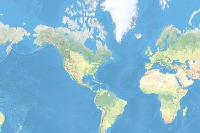

In [6]:
training_data = gis.content.get('3a95fd7a25d54898bddabf1989eea87d')
training_data

In [7]:
filepath = training_data.download(file_name=training_data.name)

In [8]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [9]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

## Prepare data

We will specify the path to our training data and a few hyperparameters.

- `path`: path of the folder containing training data.
- `batch_size`: Number of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a 11GB GPU.

In [5]:
data = prepare_data(output_path, chip_size=512, batch_size=4)

## Visualize a few samples from your training data

To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them.
- `rows`: number of rows we want to see the results for.

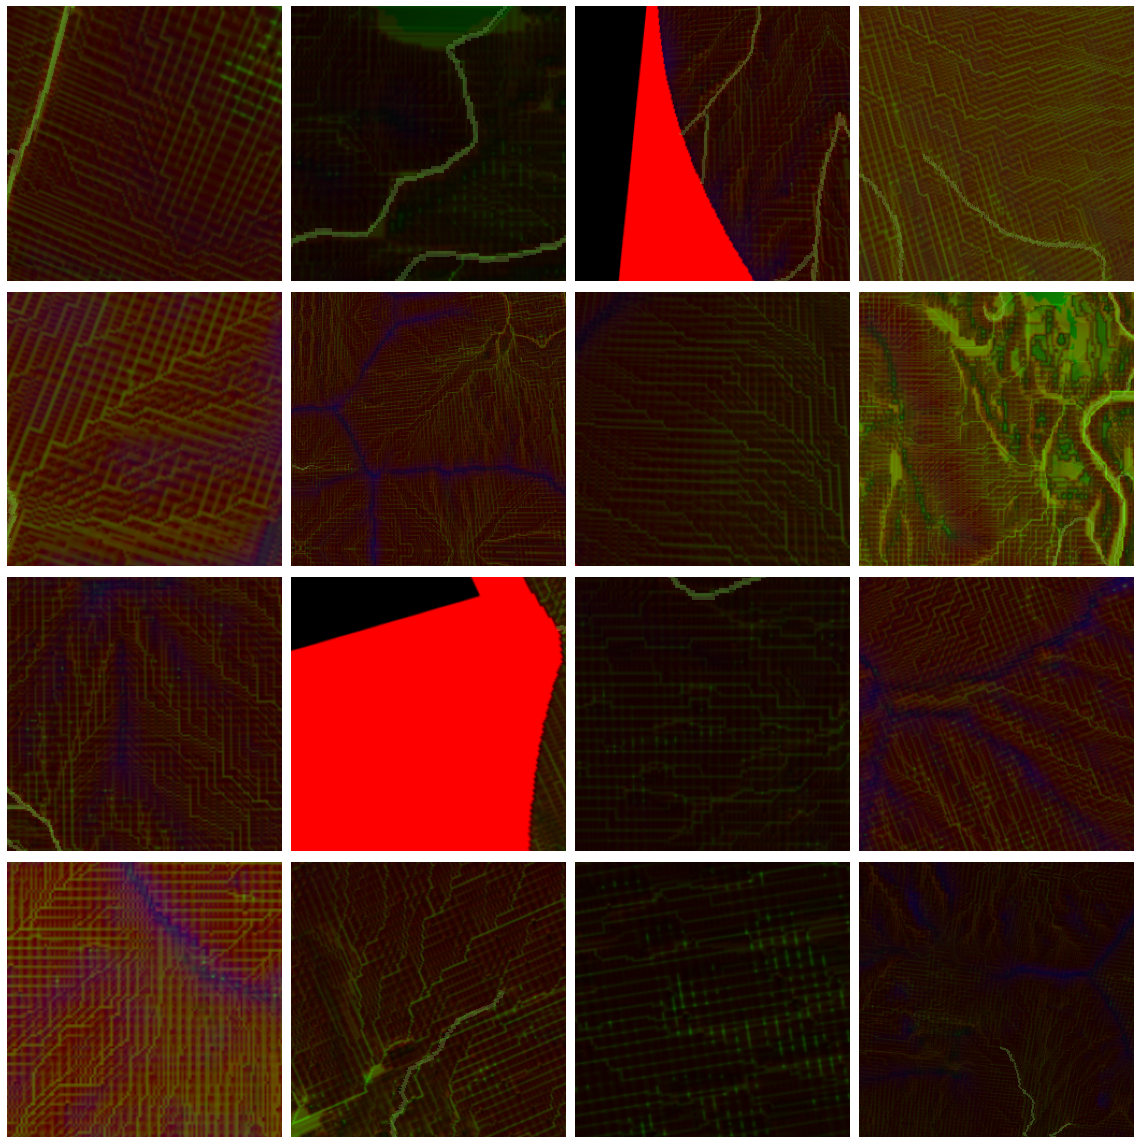

In [6]:
data.show_batch()

## Train the model

### Load model architecture

`arcgis.learn` provides the MultiTaskRoadExtractor model for classifying linear features, which is based on multi-task learning mechanism. More details about multi-task learning can be found [here](https://developers.arcgis.com/python/guide/how-multi-task-road-extractor-works/#Multi-Task-learning).

In [7]:
model = MultiTaskRoadExtractor(data, mtl_model="hourglass")

### Find an optimal learning rate

Learning rate is one of the most important hyperparameters in model training. Here, we explore a range of learning rate to guide us to choose the best one. We will use the `lr_find()` method to find an optimum learning rate at which we can train a robust model.

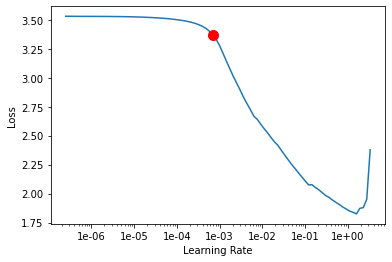

In [8]:
lr=model.lr_find()

### Fit the model

To train the model, we use the `fit()` method. To start, we will train our model for 10 epochs. Epoch defines how many times model is exposed to entire training set. We have passes three parameters to `fit()` method:
- `epochs`: Number of cycles of training on the data.
- `lr`: Learning rate to be used for training the model.
- `wd`: Weight decay to be used.

In [9]:
model.fit(10, lr)

As you can see, both the losses (valid_loss and train_loss) started from a higher value and ended up to a lower value, that tells our model has learnt well. Let us do an accuracy assessment to validate our observation.

### Accuracy Assessment

We can compute the mIOU (Mean Intersection Over Union) for the model we just trained in order to do the accuracy assessment. We can compute the mIOU by calling `model.mIOU`. It takes the following parameters:
- `mean`: If False returns class-wise mean IOU, otherwise returns mean IOU of all classes combined.

In [10]:
#model.mIOU()    #available in 1.8.5 version

{'0': 0.9668936989721181, 1: 0.8336953463440812}

The model has a mean IOU of 0.96 which proves that the model has learnt well. Let us now see it's results on validation set.

### Visualize results in validation set

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to validate the results of your model in the notebook itself. Once satisfied we can save the model and use it further in our workflow. The `model.show_results()` method can be used to display the detected streams.

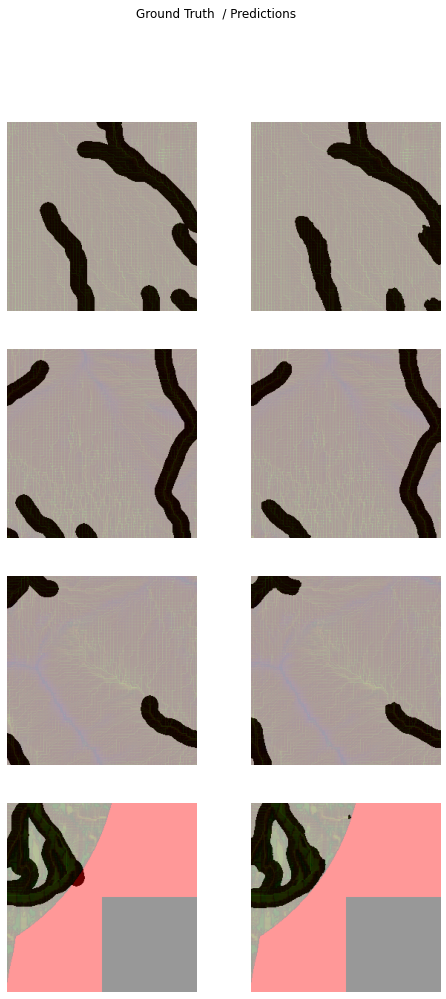

In [12]:
model.show_results(rows=4)

### Save the model

We would now save the model which we just trained as a 'Deep Learning Package' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the model and by default it will be saved to a folder 'models' inside our training data folder itself.

In [ ]:
model.save('MTRE_10e')

## Model inference

The saved model can be used to classify streams using the 'Classify Pixels Using Deep Learning' tool available in ArcGIS Pro, or ArcGIS Enterprise.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAucAAAN3CAYAAACRFvQ/AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P0HdFzJlh2I9l/z18zSGv2Z+SPN/JE0akk9akkj0zPqVk+3pG71a73uZ+q9V++VL3pvAMISjgYESIAk6AEQJAiSIAmQAAmChCXhARKW8N577xImkd7n/ufczAQSYLKKrCpUoaoiau0C80bccPfefXbEPRH397AmdPf0QKvTQafXCwgICAh8h1BrNHZmXr8gOF9AQEBgY0GIcwEBAYENCiHOBQQEBH58EOJcQEBA4B2h0WrfmScNRiP0BsNrx/kYx609zhDiXEBAQGDjwWEDXHH6m2A0mVymZ/5fawOEOF9n6I0GwGqExeg6XkBA4PsBs8WC3r4+REREIDw8HKdOnUJgYCBuxMW9FWdOTk1hSaGQCNpxjP/NxzjOOa0DQpx/D0HGlwgfMLmIExAQ+N6C+bq0rAwhISE4c+aM9DcoKAjPnj2DxWp1eY4DLObHJyYkTncW4pzn3Pw8ZmZnVwn3ryTODSYiHqyB2QC9i7Q/ZrAwV80tIbVhBrUyHQwG1+kEBAQ2Plicd3R04Nq1axgeHkZZeTnc3Nxw+fLlL+VMk9mM06dP43psLOYXFyVCZsiXlhBH4j4sLMzl7PlGEeeC898OknFVqJDXNI3CcQ39dp1OQEDg+wfm7IKCAty7dw8ymQyJ9+9j//79ePL06ReKc+YFFuA+Pj7IyMiQfjPYLoyOjUkTPfcSEohXsXzOO4lzzsxChDzWNYktSf34jPA5/00YwJnqBSxaDDC4OO/HCoPZCFn7KP7h0XocbtGK2XMBge8xHOL81q1b0ixIa3s7Dh06hCtXrny5uCXh3dTUJM20x928Kc2WK1Uq3Lp9GwEBAahvaNiQ4tzB+ZPdU9jqzPmJAzhVNY8FwfmrwIMY9ZgMf3myFr8oXoLR+PavvAUEBDY2JHFeWIjHjx9L3JmWno4DBw7gaVral86cM8fm5Obi8OHDSCeBzvZkZHQUZyMiJHE+PDKyyga8tTg3mAwwLywi6GE3/ujGIDIHF1E7LEfd6BIKG8dx6OEw6peE+8YqGPTQqDTonVZiUkWGzlUaAQGBbw0sNpkUmUjXgmcxXJ3jgLM4V6nVaGlre2txzjBT/izQjx49Kgl0xpEjR9BAwvxNZX+X4pw537Iox/FHxPmxg0gfIM4fkROWUNQ8DvekIVTLBee/Bo0WQzNKDC99+T0hICDw7YIFsCv+Z7D4dnWOAw5xnpKSInEni/K3Fedse7js3Lw8+Pv74/6DB7h06ZIkzHn23ET2xTn9W4lzfjVnXFrC0Ttt+Iu0KUxojbCyWHfAaHu9qXU6h4kdMNlgNcK45vWe7TWpPZ5fkVJ653gr++yZDdQZq9MZndKYzBRn4VcD9jSU3hFndhyzn2d1YUBer8NKnIXLd8Q55cswO8dR+Q7RvVwPhtV+nH3O+Tflzf0jlUn9wX22nNbF7JNxVV6Unn+76EcBAYG3A5Pj/MICGkkgM5qam5fR0NiIzq4uSQy7OpfB5Nvb24v4+HiJZDsoPYvzqKioLyV1BzhUVVXhkIcH3NzdUVZWBusXkPp3Jc4lzlcu4cTdNvzHJ1MY1xD/fE3O16/iW8IaXpU4l7nQOR/iZZNTGok/mfMdaZzyWGsr1toUCc68y3BKs4q/19RtNR+vcP5aGyLZJ7rPnPNYWXfEf1fSml6zic51o/R2zjeLwY+AwDcCtgFj4+Oor69fxf8Mfns5NDwspXF1LoNtQMmLF3jy5Ak9o0BGZqYkzvkvB1fnrAVP8rC437tnj+SvPjA4CKuLc99KnJuIVNqq+vD3I7qROa0l7lidyVqYiGRlozIEZw7iYOoQAstkmFBTpexkxKSzMDwD97QhuBEOpo/gRp9KIl2dnoiXDFJ+zRhi2hSYGJjBwaeUhhCQP4NxIjwma5NBh472KUQ1y9HaNQ0PyudG2xK0FM/1a22bhNsTyp/Oc8seR94kGTknwuU6LI7MrtQhYwQpQ2qprTzwqKgesZWbNoybPVQ3O4lbqQ01DWNSvgefDuNMzQIURJ786revYxLu9roGlsowR3mZ5uW4VDSGnHGdZFCmB2dxpnQGzeNyXHlO/fN4CKer5jBDN4SDrLn/hnum4JtO8ZSXe/40GnumcbJsBr2KlXQCAgJvDxbUszKZNPO9e/du7Nu3T8IeIslDJJSf5+RI7iquyJnPZVeUhw8fIvz0aRQVFSHl8WOJmI8dOyYR+5cJdEced+/dk0iZEX/nDhblcinO1TnflThnd4zO6n78/bM9SJt6G843YWF8DiezmPMH4f9yFsNK4kW7sOTJBdWYDIccfEu8eqVTYZ/cIE7TaVHeMI5LTUuYHZFJvMzc5/1sGv3Ed8x5LPZHemdwsW4Bbf0yBKQP4Xz9IlQsaol/R3qnJf618fkokofVdptiqwMLbOP0HA5nDFP5tjrc6FJQvgZpYNDeMmHn9SFcaF6SbIGt7gb0d65wu/9LGWa5zZTf3NAsfKgeDp4eUBPPq1R4UDaGu71qSbwrphZwuWgClVMqJBVRWrKJAQVT6NXQIMfB+Wbuv3mEZVM82a2D2ZS+ZxZnX9DfWVv7He0QEBD4amCe7entxcmTJ7Fr165lG8D2gN9iNre0vJGLmd/Z9STm2jVpnVFFRQWir16VzucZcF6H9GU2gN+QDo+O4hKdz+Wx7cjMypJszlq78xbinIjTqMKl223485QpLBJROWavmcCt9FsCESQveDSb9ejoGMd/vdCFsNpZFHbNwPNeB36dOQsFFW42a1FYMoi/juxCaP08CrsXkN44jP8Y2oGjJHSVViOgUiLkbgv+hzOd+C0J6/yuBeR1T+BXoS14L31KEuggcZ73rBt/52QrDhLRZXQson5KQ52jwu3H3firm/243rKAwt55xL/oxx+f7EbckBIGOpfrUPzCVoeQOqoD5Z9SMYSQajIWVhVuPOrFX94eRGrPInJrqG6ULoYEutVqQEF+L/78Wg9iKO/ctjlEFU1ilo43VQ/jP1/pxGlqU0HXPC7ljWOQ+gej0/hXYU3wbyEDRwagr6of/41/Pf7j/WEktS2ioHkGH19sxs7SeSzQTWG16NDSNIb/croV7uUyFPQsICl/EP93WB3+7qU+FMuof8RMioDAVwKTp0KplBb08GJOhre3N4qKiyVSftOsCcfNz88ji4iUV+bfv39feh2ZnZ0tHePZ8C8iZs6Xfcxv0sAgIDBQmqnn2ZpAEui82wuLdldlfzfi3Mb5kfFt+NNHk5Jf+Zdxfk/PBH52oRvBr4jzu2fh/6ADP3s6jXkdp9WirHwYPyV+PFLL/LiA7NZR/OXJdvgQ7y0y52vViEluw98N68Av0seRQ2kKeibx6ZkW/OX9CQwwlxLvNb3ow38b3IJdOeN40r6AVxMkgM0apGX34b8QL19sJM4nznxUPYj/ENqJiNYlaIl3LcSrtXWj+OWlDnhXziGf7E42cbvvywXifDo/bwB/Ft2LhE46v2kcP48ie1S3RJxvRANx+19Q3cPYXhG3X8wdxzC1fZAE+3uX2yg/mVTmFTrepNDCurCADy414b0iEvhWE2SdE/inx+rwT6/1Ibae8u+eh/e1Zvz06SSGtDaf/vHRWXxyvhUfPJtETu8iMivG8esrjfi94624PqAXnC8g8A1BEsgkpHnXrYMHD0rgXVf4zSnPars6h8Hn8W5dvKDz+fPnuErCnF0a2R7wsR7i0S9yjWQbwrP2Z8+elQYHLPTz8/KkRaLsg/4VxfkCdhFxvFc8tzz7bNDrMDQhR077PHKJ6CpGFZBpKE6xhF0XmrGvapFysxCskkD9D2c7kTSnw9LgFP6CCDesS7nsugKrHmWlvfiDK/2omNcRUasQcb8d//35AVQt0m8yDvx6b3ZgAn8Y1obwdqV0TkleF/7fZ3vwbIKEL7/GZPFbN4z/g8p6MkPncd5cBgn2uJQO/Ms7Y5gxGCEfmpbqENqxUgee4WHh3kbn/4vwbpRSWyiCYELpsy78X/fGMWZagje17S+yZdQqiqNzDTp+1aHERRq8/LN7E7bjVFcj9Y+WX3mOTeNPzrXiWJtNnPe/GsD/eKoNZzpUUjpAR8KgG78fNYhWJfX13AK2XSbjU7EAnb1uPGuV+LAV/2vUAF7O0TFB1AICXxkOgX737l14eHhIwpyPvUmYrwWnZSJncpZc1d4w0+IMJm3elYV9DXmWnX+zIWAfdF4QGhsb6zKf706cL2Ifcf7PilZz/vCkHLnM+SSey4nzZ9U08FAp4XapGdtezlNuds6fnMVfnO3AzSkt1GOz+FlECwKbFTaXQOY0qwGN1QP4g/O9yJ0mrtZrcOtxB/7OmT7kzRBXUjzzpWp8Gn8c1grPOjnlS/xc1ov/5lQn7gyo6TfzpxGTHWP4t+FtuDFiezsqwaJFRk43/iBmCJ0qA/Qzc/j4Qgv2v1qEwV4HK/Equ5KM0CDgP5xqx31+KyzV34yhKqpb1BA6aJASRYOUf3pnXDpu43Y9tVCDJ1nd+J8uDWLO4aZCx7U8eJlfxKarLfjohU2cz3VP4N+casLWCmqDmcqmPIY6hvAHp7vweIzKpLafvd2Kv3o6hVm6tySbRaimgcjfJ3t3c0iIcwGBbxLs383imHfJ4tnrLxPma2Gg5zTbLsrf5jy2Lbwz18nQUIRTmexjzufx8TwS6B6enlJ+zu4tbynO57GDxOzf5MzCSKTGGZoNGpQ1TMAjdQifx7Xg/3OuG7lTJL5pZPAvjjTjbx8N42TBGI7nj+NUGpHM8UYcblWhjsTpPzrfh4YlHeVrK4NfN04PT+O/EMFeGSDRqlchPKEVf5YxhyUS0zw7w2Ua1GocjmnGjtJ5okk9Cp534V+RaO5T23y4LVYNEh934p/cHMUC/Xb4BZqJ6Fl0/3NJdGtR82oQ//bKAJqc6iD5CZrVSEjrwt8J60RA7hiC88YQkj+GA9Q+nrUuW9CjMKMLf5fi/SplGFQRaRKJGsw6NBCR/o/H23DwxTTq52yDBcnHco047yXS/yfne1C4SKKe2mWx0rn1A/gHZ3tRI9dirG8M/zq8E8mjaml2iuvGr1e7K/qEOBcQ+IbA4nhychLV1dUS372tMGewiG7v6JBmTTRveS4L+tzcXGnG3Hl2xUj/5hn0nJwcl/l8d+J8HrvPtuAnz5w5X4vKpgl4EudvvtmKv3umC+njOmimSXwebcJPkoeWOf9kRj/+YXAD9ter0NowhN8/24NS4kWH/zSL4oVJGX5xuhWh7QrApEHso3b8u5QZzOpW/NVNNCA4e6sF75PtobPQ/LIX/yR2GI0Ko8SfVmjxPK8H/yByEMMaSuE4z2LAcNcE/v2pDjyaVaOvaxR/SrybQwLcQmU72soivpDy/B+CibuzRyW+DyYEJnbgv6VzH07q0VHO3N4Kt5Jp1Mls3G6y6DHYPIJ/crQFm3MnUTBmGywY3iDO/4hsWxwJcXZjMVL5UxPj+HehHbjer4JFIcPPaAAS2CCX3s5KdWP71TuGf3y2HXGDQpwLCHzTYO7t6u5GS2vrF854uwKLc3ZHefr06Vudy/zJb0d54ejQ0NBr57Afe2VV1Sqh/5Y+5xpcudWKf58wjmkiSGmGgOBYdDnaNoh/TsSXN62DrGcE/+xkGzyLZ/CwYRYJdTNIoL9PWufRp9KgqKQXf+/yAAaVJIztRMoLeRYn5vFeWAtO9CiXxfn/ky7Don5FnOtZnF9pwkeFc1QLFufd+JPkCYxSGhPFA0pcTWzH7yeOS4J2uf4kigdbx/GvQzqRrVAhLacL/+b2mOQHv7xoic+nciMf0vlXB3C7bhaJXHfC/QYZcvuWMKMxwKhQIvnlCP71iXr8m+hu+NbKpQVSFpUKz+om8Ven6vFPLnZiy0uqI/ePC3H++9xXJPQd4ry+jsR5RC9qSZz3dw7hH9MgImeKjLLdiHBbuoQ4FxD4RsEi+11mSxxgLlpYXJRecbqKfxN4VsRVeXzM1YIgxnflc24isRwd34o/ujuOKRecP0U89c8jupExocPSwCj+eSiJ28JpPGy0c379LFJb5tGlIEFf2Yf/5XwfWuW6VeJcOSvHp2ea4dW0tCzO/+2jaUxpV8S5Ua/FmevN+Gn6NOQkfptf9OFf3RpBF6UxS5yvxqP0Lvx9EuyLOro2dI50HtVzZmAG/4nqdWNCicpXffg/o4fQwpMiTvwJoxZPyR78wwu9iHw1iwf1Ns5PIM7P6l7EiJLKUKuQXT+Fn4TV4/eZ21/IpEWeFrJHZV0yfH6+Af/zmXa893wac1oS5wuuxfn1kRVxPjk+jn9L4jyWxLlRPoX/cILfCNt88KW6sf0S4lxAYF3BIvldhTmDbQB/UIhnwPnfrtKsBafj4Mr9kRearrUNbyXOjWTEhuqH8D+dbsetQTIWVuPKrDSRRlfTgCTO+fWkenYKf0qEGC29drS/opPcN/jVnx6tdUP4p2e6UMzuKvZFRkz4Y33j+L/CO3B3hM7TqXCaxPm/S52FmsqWxDm/8p2fw8/PtMCzRk7GTI98Eud/nDSBEbs4N1u0eJbdjX90dRAjRG5mex253FcV/fjfz/WhTadFWSkJXTYWyhXS4/wBLTKedeMfxgxDwfXlenP9pbpTPSidtKMA1Vuu1CA1rRN//1IvXi5Sp3NaMxkctRYvS/rxv4S1I2WWjo/PvJM4H+4exT871YnHE7ZXtFw3CxF2Y3GPEOcCAhsETLRfhdTfFd/dglAjRhuH8P8NbycByXVY4Xx+29jXOog/tItz3cK0JILP8cL51zjfgJ6WEfyL8E5ksLuKnfNNJt40YAp/Tvlf6aXzjBrcIHH+h0lTmCM+Z3GuNxhhUS2S+G3G5hf8ttQg+Zz/SxLnnRoW5zb+rHjZh394vhctGrIldIzzt1gN6G4Zxh+GdyF/XoPOliH8/ulu5NrdHaV2ko1g21BV1Y9/dL4f3ST4uZ22+ts4n11YpAGJg9tfELefasfDSc6H0xmh1WrR1DiGPwxpwpleaiMN3N5FnJuWZvGfT7TgSAsNUig/rhu7WC51jOJ/J9EvxLmAwMYDi2xXQvubwluJczZERjqW8LQLf3ajF/Es0O2ClTFQ34+/R0SdTUTN/nNnbrfg38ePoUsaKVA6swalA0tQ6AzQzy9gT3QL3n82Y/Ovk+KVuJjYjj+9P44h9vXWqHDuQTt+72QXkoftZVEeD5924r+P7EepzCbs81aJc5vAXhiexk9IwPvUyqGTCNYE89I8ldmG93NnoTGbsDQtwwdnGvGr7BnM2OtgXlxCGRmP2cFJ/ElIK/wbFnm+iOKMUC8toZwGDUajGo1jdgNEpmKyuh//85lu5C9o0TWphIXdWGjYYOgZwz8mY3V76t3EeRUdMyiW4BPThD+/P4kJycCZoZycwS9P1eH/Fy3EuYDAjwnflTiXOF+vw4P0Lvw/sb246ZhssXP+WNMA/t6ZLjxhn2kS1pfvteDfxY2gVceTIZSO+LpiUI5Fftu4KIfX9Vb8LH0KE0Yb38KqRtzDDvxRPAltnp3WaXA7tQO/F9KB68siX4uCnB78d+d6kDVJ5ZBgZfdBZ3HOnK+akuF351uw7cUclojfpXN1Szga14a/Sp2EjES+lurgFtWE/5Q0jgGyF1IahQIvJjRYmprDr8lmbC6S2SZlGBoligaUZHw1aBlXwuzgdp7NJm6Pp/MGZpRQSmuTrLBOz+I/hTUhsIOul/ztxTm7tfDsfeyjVvzLyEHUqDg/M8wKOXyvN+O/CyE7InzOBQR+dHgrcc7g13gGlQYFDcN4P6Ybn9zvx6akfmwm/O2lFvzfD8clnz+eVZmdlWHnlTb8yfVebHo4gM13+uBdNSeJc5NZj/GReQTdbsef3+3HluQBfJTYifeTJ1Av01A8kZNKiTP32/DPY4fgmUJ5UJpNdzvwD67249mQSppV4N1acrK78O9I0A/bxTnX02jWoaNlCtti2/G3iVR2cj9+dacbu7NmMKTWSbsN8G4tvb1z2BvVgj+/w3Xox0c3unCmhwwQGZqXjcP4k2Ot+AWVy+379P4AkkYpzrwA7+td9JvaTnE/ud6D6GY5iN4Rcb8HH1I7N1N7/ya2B6EVc5hlcT06jT8i4g9qtYnznsp+/G9nu5HjJM7ramlwc7oHFXNaWC16TEzIsP9SG/7iHuVHdduSMoQgGrz8b0KcCwj8qPBdiXOGxPlqDYqID397zYnziZN+cbkV/+b+GPpVPAuux/wccVZ0O/44pgefP7Jx/qGyWSyQWGfOnxpbQMidDvxpvI3zP7nfhV8mjqFy2s75WjVuPO7AP746AI8UG79uTujCP4jsRVK3AnrKg91R6kt68Qdxw+iwi3OuJ6/5GeyZhXtcO/7q3oDE57+lcz9NnUK7XCu5BZoozRjVwf96G/74lo2nP4ntwuFGBaxGHZp6x/FXwS34a3sbPyG7ENWrpN5ZwpkHPfgg3nbO3xK3nyibwyLUSMihcsjGbab2/vpmDw49n8IQDWrY5/yTyGb8tsQuzrvG8X+ebMXVYSdxPjaGfxncjmh+a2A1QEli/OStTvz5jW6pfz99OIhTj7vxv57pwE0xcy4g8KPDW4tzhuQzQ0QyO61A9ZAc1cM21I4qMK5g4WtLx/vCKpdUaLLHvxpSYIaEO3/YguN5f1itQoU6e3z1iAKTPANBpCX5fpM4Z5/zP8+cw8ScCjVSuiV0LNhmT6S6EBYXVeib10Bt/+2oJy+kXJhXoJbq+IpQO67Eot62I4sjDbunKBeVtjpwmjFKwz6LTK4WIvJJBWrs5zdOqKGhuun1dHzK3nZCw5RaWixlpIHC9KxSSi/lNaGS0kuvZsm49s0oMam0tV+pUKN7RoVFra3OfGyJjnVNq7BkP8bGSilXoV7qOzk65nXoryJRHzWAsgUhzgUEfiz4LsU5w8H5spnXOX9saYXzmbNUxOnNxNMOzp9S82JZR7wRBqVa4jRbHksYVZPodHA+ifPrj9rxR49nMSxz2IYltPLiespb4kqCQq5Gr0wNpf23o5783Qrmc/5qNdezhneS4W0cOX97GnZPYbvTOGKvA9kdGdklXgDLkyIzxNNsMziuZlQFJYl6PXH7DHG7dJzg4HaeDJpfUKKB0jJH15D9WOAyqD/0Wh1G6Jxhua39/JXovmklZnhnG3tdNHRde6dUdIzS0G8W7Dq1Gq1UN86vfkYDTd84/tnZDtwaFuJcQODHhncS5w5Is89EJs5YXlhpB69ad453rKJ3gEnfOX75fCdx/qdpMiwZTZLYltKtISjOY3m3lTVYVT79e235r6UhOH+lk8nS+XwHqa5qu9PxteU5Gw6euXG0z1bn1fFSX9iP8aIr+iHtKGDLi1+nanEvqQN/9mgKc2QoHXsOCwgI/LDxXYtzB9ZyJWPth3EMb+J0O76Q8+3i/N88nMaM3iQJcindGzjfmT8d+DKbw1hbB+c0a+3al3H72vauzWulfTYbsPYr0NIxipMW2rLbDLWZj3EZpMZR/7Ifvx85hH5qr+B8AYEfF76SOF9XMFGTOA8jcf4fSJw7dmtxmfaHBjY8KhWetsnQIdfBtqhKh1fVg/jXwZ24OqqiQy7OExAQ+EFio4jzdQVzvl2c/2sS5867tfwYwF9Hre6aRY7jex0wYGhgAn/N2zs2LtreLrg4T0BA4IeLDSvOIx604T9n/PjEOUxq3Hneiz+71ImfxHXjr2904g+u9SG9Rwmd/fWuy3MFBAR+cPgxifO41A788eMZTP/IxLnVpEN5/RD+Y0QHfnKzG/81rgv/NqYb514tQEnCXHC+gMCPDxtPnNuh0uiwJPkD/sjArzm1OsiWNJhmyDWQqXW216au0gsICPxg8aMQ53aoJc7XSW4eruJ/0KD+X1CscP6sUiftBf9jGqQICAisYMOKc54t+DHPGPBComW4iBcQEPjh48ckzhmC81fgKo2AgMCPAxtWnAsICAj82PFjE+cCAgICAkKcCwgICGxYCHEuICAg8OODEOcCAgICGxRCnAsICAj8+CDEuYCAgMAGhRDnAgICAj8+CHEuICAgsEEhxLmAgIDAjw9CnAsICAhsUAhxLiAgIPDjgxDnAgICAhsUQpwLCAgI/Pjwujjv7hZELSAgILABoNXyJ93XN3QR5/MgQG8Qn4kXEBAQ2Ah4TZz39PS4TCggICAg8O1jvcPg4CDUarX0GX1X5QsICAgIfLsQ4lxAQEBgA2O9gxDnAgICAhsLQpwLCAgIbGCsdxDiXEBAQGBjQYhzAQEBgQ2M9Q5CnAsICAisH3g9j8FohNFkkv66SrMW34g458LMFgssdL6VYLFaYTKbxQIjAQGBHy2Y/5gHmQ8dvMg8+bbk7MB6h68qztcaHMH3AgICAitgTmTu19O/5+bnMTMzg8XFRckusC34Is78WuLcQc5j4+MoKy/H06dPkfL4MbKys1FTW4sFqgQTtyBtAQGBHwuY75j3mIzr6uuRmZmJlJQUpKWn48XLlxJfvouYXe/wruLc0T4VnTMyMiJtxch5LCkU7zQzJCAgIPBDhcMG5OTkIDY2FlFRUYiOjkZkZCTi4+NRWVUl7ZL1Jr78yuKclT8XzGI8PDwcd+/dw3OqRF5+PjLIGF2/fh3hp0/jZWkpNFqtVFFX+QgICAj8UMC8yHzHvHfm7FmJB1mcMy8+e/5c4knmy0ePHi1PXrjKxxnrHd5WnDtE+dT0tFT/c+fOSbhy5QouXLggtZfbN0D5scERIl1AQODHBuZJRnNLC84TLyYQJzY2NmJkdBTj4+MYGh6WJrOvxsQgLi4Oo3Sc7cbafL6SOGeCbmtvx2Ui5bt372J6Zma5Qo4ZIUZXV5eU5g6lYUL/oZG13sSOPIDB4Dr+68IgZW9dlb/BzC9JbMH4TZZrMNrckixf/xrZ6miBwUXcesJVfwl8BzDanguT0UXcDxgO4Xo7Ph5XIiPRSfzHPMjHHa5+zIFTU1NISEjApcuX0dnZKaVxlZ8D6x3eRpxLddTppNkeFuKpqamSkeGBCH8XgzExOYmc3FxJsOfTYIRn1oVAFxAQ+LGAeZK5kHkwgniwvqFB4n/mQf7LafjfbAuYHznd2bNn0dTcLLm5OOf1zuKcC+gfGJAyrKiokI5xYVwpztx5BMBp+VUnz65fu3ZN+veXGaKNBj2JVhMZVjauDpgt7KpjhHKgGslPijCiNH2zQpnAAnO84TkSs0oxqTRL+bP4nOstw93rFxGXlIG+eTr+tgLIQAKBru/qdpBY4HpTnEk5jdLs+8huGJd+u8zjLWAwGjDTWoyHz6swo7Xn7yLd6yARY6E6mV8vW29kv10S+1+Q16r+Utj6y1W6rwW+F6iO/N+qfjR/xwKErpf5S/rnW4ORrt9YA+4/TEHrFF3TH4lAZw5clMsRExODp2lp0qy4Q4zL5uaQmZUl8Sbzn4OoeXb94sWL6O3rczlz4sB6h7cR51zn58+fIzIqCi2trRLX8zFHWziNwwYMDg1Jr3GTkpMl8f594/zXQPXnNqzAcdwoPXfrwjUMepaYX5zz11N/89yHdPxdn63X2rH6uhhMFljIJrB/rPPxd8bX6Je1dVrGm447QyqXBsHrzDlr+3D5fvhOQfVwefy7gcHM9xLpJBdxP2QY6fmsq6vD5UuXJPdFh+Dm+4TtQ/ydO3hVXS1xJh/jv41NTTgbESFNbji4lPFO4pwzY7XPfjMFBQUSQfAxNizDIyPS8TQyTEzYjnMclbh56xbS09NXFb6hQQ86t0OpaMO9kOPw8/dHYGAAfL39EXEtH9NEkEtlN/DprpOonbPA/A0TAhNMW3IQPjkciY55wEpktzBUjbPuBxGdkY/69h7MKqmOb0EMeiJ51VgZIvx8cdg/UGrHYR8/RMRlYkjNAypqzEIPov0+RUBSC7TG1SO4d4HRZETf03BsOnwdPWrA9DbExX2tkaPgVhgiU6uwSOU72sXXYLIhBSfP3ELLpBZmk2uSNtGgoP0h99dldMzhG78ePBtsWehDYlQIPKnvAgNt/ejrH4BLafXQ6r+b1/jStR0uwaUzkaibMH/z7X5XmKzQNiXh8627kNlFxtLkIs0PDA4OzMjIwK3bt6WZE8e9wBzZ1NKC/fv348nTp1Jaxzn8fimfeJQnLhRK5XLcWqx3+DJxzpzd2tYmTciMT0xIBofryuBXtzzIYLvgSM/x8qUlybeypKTk+8P5a0HtM5FY1aoUWFhYwLyERcgVaokjzRN1uHLmMkqGVWSU30I8vguMVG53Ho6dCMWLAXqO6Llm8bw43IC4057w9j+OnI53KVdH11gFuXzR3o4FLC6pKU/bBIrJoEPXsygciUrByNLXELjcL5O2fikeVr9Tv2i1GihVamhei9PR/aWCSvsFXy6nck3jtbgQGojUJsU3fz3s4DoqFEtO9wP1o1IDI4nR73IiQqNRQ6XRuoz7VkHPjFmvQkNqBI7feIZJFb7Tfvk2wXw4K5NJriwsuJn7HXFsD1gjb9++XXpryjbCwffMj9nPnuEWaWTnyYx3EudsgHj2hGdFOHM+xoXyjPjVq1cRQAKWK7BWpPDvyakpySexo7PzC2eJNgSoc4xmI9pybsLPaxfulY3RqIdIbXERk8NtyE7KwwR1/FJlPLa7nUX9vF2c03m2F/qOsMa1gwiXDbIjmBxCk8Sp83kW+0wsz5LwTDSPivm8qbok7PY5hyGlLR0H8yoSogeDjllpxLpyjPMxY6nnCdy3u+F5m4IGHHIsTg8h5dw+bDtyCwOLthGfgYS1NNJ11MfqdJ0MJqkOjro5ynIEx3EW5wOZ57Hr6C30OcT5G9q3krcRRs08Hh3fCs+oHMiMK65CnN/wyyhs2nEcFYNaOpfa+6X9xeeSYaUKc18Qby8HC+W3XC6fY1h9TcxEsjwz/tqghzOTNeGU2wFcLuyWRsHzC3LIZmpxZf8OuB27hMZJHdV35XoYnTJee03WtmFl0EH1pt/cJrpsy+G18+3ga6voTsWhHZ4oGqQBhAsxzALeuY3OhpfPd47jcpZnO+zX3EzkYUvD/bLSr3avLimYnfuVr6dTP+jtbk5swBzBSvfW6lmVNf1BHMFnfR9cY5jPmNfOnz8vzZYYnfiNCbqhsREHDx7Eo5SUZeJl8P3KZMx8mpuX9xpvOrDe4YvEOddpfn4eFy9dkha3Orib//Kr2MN+ftIao7V1Z4PDvudnzpxxaRM2PPgeJi4Z7y9AXFgo/GlA7h8QCH9/L+zfcwlN/HAPFMFjxyGkdiukyQGX+XxV0HOp7crD0eAQlJA4Zz7QLo3jms8WhCdXYEalJDHm4jxX4IkFRRduBBHf7/GSJhYC/APgud8H96sHIdcYYTXp0PksEkGRjzD8dcQ5kYN5sIj4iPtF+db9whwxVhyL3ftPoErmNMnAonuhCefJDkdk9r1uOxyQxHkNzof4r5s4Z04byr2MDz7fAe+AIATS/RBE98NOvzBkFjdiXrv6Lce3ArpPrYY55N8IIDH8AnIDiGNcpPu2QBzC4rz+8Vkci83+UYlz5kTeFCU5OXl5xtwB5j92A9yzZw8SExNXiXCO4zet/NaVZ90dov6txblE0jRKjCYR3tHRIZEvH+e/vAuBt7c36u3kzYU6w3E+LxhNSkp6reIbDSaTmYTwY7jv8UR2p5xEgnObWDSZpBmHRWdxzuJEJUdNbgLu3EvA3bsJ9MA2Y4GEJj+wTD6GhSHkp93Hnbt3cDf5GVrHFmCg/jKpZlGR8xDxd+7izv2nqO6ZloTyVHsFcira6IEzY7IlH1fP+OPT7QdxJS4JmfmlKHj2HG1TcujtwkhvWEJjURaKGwahoWMO8SOJ8940eO/1QckQSU8SuGxb5L3FOLxpJx60y2DWzqG2pBA1QwvQK2dRlfsImdUD0oyw5PaiHkNBRhqK2yapf0x0DWnwUpKEu9TWe4nJqOxfsglKKneVOKd+MpPwrs5/ZGtfYioqOieJxJ1IlvuU0jwO3QXfmLzXxPlI2VVs3xuKqiGt9AaB+6vSqb9eremvBT3VV69Eb3UxXrZPYaDhGRLu3cG9hFTUjcil62frFxO0qiEU3E+UFrIlPclHa18LigprMaM0rBbokjhvxmlPD8RW2QQY3w/UNdS+Mdw9uh2Hogug0LHotA1cRuozcI/yvUd9lNs0Qc+Go1xqg24J1TkJiL97DwmP0tAyoaHrQtdMq0RHWQEqu2UY6yjEgwS6VyiPotZJ6Z5bro8dkjjveQqvvb50bV8X53TrQK+YQEnGXam/7j/NQ7+MRCMZGj3lp5juQU5qvP2eTcbLtnHoSERz3xjpfi3OK0bryDCKU24j/vFLzNDArof6tbRjGgP1K/1aPyqna833ComIyXY8yy0jI89uLQYs9tUgp6wDIwONSE+mfOIfIL+2H2oqxzZ4NVJ/LaI++wn11V1q7xPUDXWj7HkRuqfU37zw+YbB9wH7YPPCT4n/nOIc4tzNzU1y73PwoQPMnw5hzyv3neMcWO/wReKcB0hFxcW4Ex+/fIy5nH3rQ0+elOyBUqV6rV0Mbhv3ycOHD1fNIn0fwM93S3YcgnwOIalmVOJLCwNqtJdUY8RAg/jBEvjs9cbTnhVx7jwRwGGVWKM+ksap9mBZduGj58TpPKuVj+voObT9ZqHK9sOoaMdJTzc8bF6QjvMp7DqwnD+B1/tYKWbVwJcytyg6Ee27DdHFMulcDmzjDmzfhjsvhmGgwTJPCnAwUNnMGzwYX6k/v0XgQysc5Lz+iY9LZbI4HyohW8P9siLOV6VdWz8Ct2+08Cq27gxCxexacd6I0we3ICytd1mcv56fTnqbwYHtm+1cHuBTG+g+dHQv983qtVC2yQZHsNB156a7ekPLXNaXFoFdx+9i1H5tiF0xWJOHkJ3v4+jNl5jVr7hyMoc6XdbXRKrL/mM46k3P2XIxFFyKXLs4z43xRkBM8RvFue162sLaiZHX7lmncvQ8WcU21z6xIk0SkdHjKSzm+5VsV+4VLcFxnO8lrb2PJX3gVNbaPl49UcRrdGxlr71XNiKY/zTE35cvX5Y0NHOk4ziD70GepHCIc8fbVed4nqBhO8LXnc99a3HORqentxc34uIwMzsrZczH2OHdy8sL9x88WH7Nw7u4OMC/2ehwWt5yi0cHPOvoqPzGAwku7QQSgnbA/2YxFHSXuVrYyMLGWZxb6UYb7SABfT0BJS9eID/7KYL3b8aVrCYoaTCikfUjIfQwztxJQVFJAeLj7iC3ppfyWkTGpUCERt5FbkkJHibeQ0pOHVjetSQcx7Zj9zBC9nlhqB4pcaewmUTYg6yXqK0qwRn3j3H8SQuROLsX0YBBVo1j2zch7uUkPQQrN76zOC+2z64Sh0A7XIkjO7fhxisibHk3LnjsQ0ReL0wGFSqTgvH51lDUL7KBNqA1PQKbd4fi5RAPVqaQdfksAkMu4tmLl8h7dB7uPmdR2quQDItDnPdr6QEkEfo86ghCLt3G85IXSElOQFLGK6iofcsP3VuK81fDVBfdAjK5v6JW+uvRc1t/td7n/roLSkYZLCD3yiH8/NM9iEzKomtSgkdRwXDzDkH5uJaIhAdYw0gM8YHXkRjk0TXLeRiJQ1s/xEcekeiepfvbmTycxXnlGJ27YhSZUgZf3MK2TUdRO8cDCDmqHsbC1/cknhS9QHFGLHw8g/Ckdloa2Bj0/bh7/AT1yQ3kU588vXUCHsfj0D6lI6JdROrJfdi0/zBiUp6ggNr4PPES3A+543EjDSxcENqbxLnk8rLYjKjDQYi4kYBiGnzdjwyEX8RjjCwSqZuXUJ6fgoT7T6h/XiLjXhQ8D3rgaZsMembJ4RJ4bNkF7/ATuPekEIU08FEqZHh2yZ36dS+ilvv1GPXrSVROUL8S+Woa7uOzbYEoneYyaGCZdwk/e+8TBEfTIKW4CDkp8fDbvxcJr0agJYtvBvXXowvYveOE1F8lWQk46b8Xv/1wH9Ka6X77BhYprxeYWNkl5caNG8u+2A7CZXA38itOhzh3JmQHmB9ZnLOvtiteXO/wJnHuqB9v+/Xq1SvJgPBxNiw823/ixAmMjY1J3O7cHgan4/R9/f3SFmLs5uI4vtHBz5Sy/Rncdu3Awzp+TeksEFhokMBjEbpGnDNnvXocgePHgxEcHIyQ8BtolFF6Os55Gpcm8fzOGQQdPYYjx8OQkN8GDd0vZp0SVY8vI+hYMI4RL0Q9rMIST2D1l+JKVCLalyxQdBfifKgPPvvoQ+z1CkBYzFM8unkWd581Q8H3HNXLaNGhozARF2KzMa2j6+CoMz2ULM6vHt6OyHz2a6V7jK6FyaBA6olt8LmWDznZkIHiB7j66CXmaODRk3sdwVfuoWNaZ3uLZZxH+eMYhN4uglJnW4fV/zIBYSFHcPwo8cv9YsypqI30/K8V51xeV34ctfk49ctxhMXlYpbvk+U+pf6xi/Ntu464FOdn3LYi3C7OWSQ75xd+g/KjdObJJtyMikPFmEoaXGmo/6KuPcSrtgbEXwhAYNBxXIzLxIiG8pTy57U6cyhNuIrgI0dw9Eg47hcXIvX6NWTVz7wmHiVxnn4Ou47FY4Bsm81lk/qRnvKFgTS4fbIH9+k8EF/x+qmFwTrcPB+AI0eOIeTiTdSO2CZgpLzoHuovTUTYCUf/FUHGLqZ0LeV95Yi9kozGsT48vnqE7pfjCD17GdXj1C9r6rQizn0Q6FKc831hQWfBDZw4fhTBR4/iUkqlNInE9yvzTVPWFRwPPkbPM923odF4Naldvp/HK58gOuk5SvMfIfzYcdzIboV2rg3xMbdR0taN1Bhb/cLO070ipwEenWfSq9D67B5iM2qwwPyunkXJw5u4/7ILFU8v0j1+DMeOnUNul0yyh1xPI/WZbKgU0YF0Hej5OXuF9FFJBm7dycOUimzmBucO1gOTk5MSjzu4jnndoYf5L0/C7N27V+JTmUwmHZNR3BKlZ7vBkzi8wYrDxfGtxTmfzNvBsEM7u7EwIfMetyEhIThw4AB8fHwkv+zDhw8vw8fbG6GhodKCJzZSo0TkbMTWOr5vKJBo0yxWwu/znbj+Yphq7bqea8U5k4lKJceSdmVo2Pr0BHb4XMeg0oyJhkS47TyBBpltbGjUa6HR6bEwVgDfz92Q06OTjrO4Uql4tlCH1uQw7DuVhBFbFCZqk7HX/wL6FzgPDUrjj+IznzuY1RhhoEPDBdHY7RaFHlLeRue6sjgnAee97zDKJ2zlk3pFc+YV7NoXiuppYpqlHkT5e+JyQa8k3C2WSSQF7sOhuDIsDb5E4O79uFczSdeRpHlVAtz2nkODyp4Vyaviy3T9rxZAzvVwEudqWSn8PyeR1aaWUrJbCrePR9fL/fmW4rx6lM6dLpL66/ma/uLRftsj7q8H0mAGNOgpuHoIH/jFoEdmvyaqFpze8zlCUrvohxnNqaHYtjMCbRr7nJFZjqIYD3zoE4M+qsTbinNeqLtExtxryx486lVD2VeIo3uP4vkQDVZsOaM75RT2Bt3HmMWM3owLOOgbj2EycFIwy5Bw1AMRac3QWTTIPrsVH3hfQssUMa0UNMiP8sTOIwmYYN92R50IXyTO2VhX3T4O77AMzDnKUnTjoocX4ioGqSwD5PQsO2bogDkkh+6Gx9VSaPjYaDl8dn+Mgzde2MQ6Bz0NeqLc8aHfdfTRfS8FZRPCqF9PpfVIM4OapkfYue8EKmbs4rzgCn61zQvP2xbt/bGIrItu2HkyDUvUrzMt6XD/9CDSe2bt8RaMF13F77YeQnbrxhfnPNnAu1KNEL/xbyZf5r1Tp04hLCwMR8kguru7S/zIxxgcz1sQsusHc+nNmzclcuZ/ry1jvcObxDkbbm4bbwfJdsEx8GD/SHbT8fPzk9xWeGtIB7htPHvUR5zPs+U8w84+9cz9G5bzV4G4yLqArLMHsTvsCRZIZDlz6TLWinOyB5rpWtxKLpRcm9jGZV3ci92B10m0kH3Qy5AUvA+hN3LQT33S1fYKz59XQ0U8XBjlDV/i+bbpKQzz26XHJHTpQdA2JGHL9iCUzZqIH+UY7i7BkQN7EJvXilky6lX3DuPTw9fQR6QrCWjVIG4F7UTIIxJQzm/ZXIpzIyyGRaSc2CGJ8yUz2fe7x7ArNBkTxL+qiRacPbgJ4Y8bpGd/tDaJBiveNFgmG2BR49XDC9iz/ywqBkYxPdqM22GeCLxWChVRgmVZnKvoSTai/lE4PLwiUUt9MjHWgfSkHIxrdV9JnJPltOXnHYUap/wmpDcZRfDY7o7H3QrpXtU1P8IHv/oZ9p+MQ/3AFCaHOnHN92ME3CgAjZlgNS2hMvk0duw6g/L+MWpHC5Iv+OAXP/sN2cFx4uXVvONanDNIANNA50HgJgTEFEFOtZzrzYD3Ji/cK2nE9PQYyh+exsGAa+iY5YJVeJVC/beP+k8qtwnxJ7n/XoKt5EJDKnZ/+Bk86HkqbpvG9NQ4Cm94Y4ffRTRPm8mGrtTpi8U5u0MtoOR2GPZ6XkHd6CSmB2tw9chBhNyrg5aeT/1cM+KTczHM2/xNTlM5PtjpGYF6GdlEsn/9Gefxs998jtOJmegemcGMXCsNvtw3/QqfepxCSTvVb2IUKWHbcDA0AQPcAMMSXlz1w4GLWaBLSc0dR3L4bvzkt1txt6QHUzPTqE49h927vFA4wuvIyIbNvMSJLXtxLvklJuj56C5NwIHf/i0+PHIHYyT6ue+X27wBwdzGPMrcx+KaNXIM8d6hQ4ckrxIGT2KzHfDw8Fg+xvD19ZUmdtra2qQ3lI7J63cW57xNGBfMxMtbJbL/GhM1i/O18PL0xAkS7zzjzkaXCTqWxDkvKtqwRE1iRz2eB5+tB/G4cZGYxrUwcCXOidOIUWWoLs7C08w03LpwGHsPx6KfyFM1VokT+3fi+LVklLWNkzSkZ58IVcsLMb13wDPiNgrq+sGmmGcHzGvEuZUGCUOVidhzOAKdUxrpFausPY0EoRueDamJMGV4cvoADt+pXnbbWK4rC7j+THhs3oGLd7OQnZWBpLtROHzAD4+r+6FhjbVoF+eFJM6pbTwzJCPRFHDoAIKOBCH4ai4WWCuaZ5BxnoSizyWkZ2ZKLk2ZGem4FrQHO4MTMU6dMJK1Is5N6iHE+e2Ae3gccqt7QYeWZw+W8RbifNueEFSR6jap+nHVh/rr7C3JNcLRXzwTskqc88z5ZX/433yBRepsAw26TJhG0rH9OBRbSe0Yx73APThIQtQmiHgGxIi+8uv0EEWh6x3FuaLjOby27iHDMIOalHAi/ONIepKFDOqf9MwsJJ/3wcf7zqNdMYJ4351wP3kLWXQd0tIz8CztIcIObIPXjWIs6dVIDzuAQPr3PPGjzSWKyL7yNraT4Sqbti0Oc5T9RnFuIEJTN+H0js0IuPQAz7isjEw8e3IPftu2IvRpM9RMnNRVJlk3cik+MzsFEXQv+sS8tIvzMhzeuwN365ZsfUHXCbo5PLvkh8A7pZBT/bhfzZhC4pF98LxZIb3GXSvOx/OisNP/GnrUJCKIdOiuR13KGXzuexOLBhVqHp7EZx6xmFiyGUBeB6BaKMPx7Z7I+J6Ic94Wkfex5YWRPFPMs8ohJMBZhB85cgRuRMr+JM75GIPjeYV+u91FMG6DinOe9bkeGytNsLANYMPDO7bwAlc2MvxGgPnfAT7Oor29vX1ZnLO4HxoZ2bic7wy690zaTkS670BgYiPde2+o81pxLokHdnNbeTWvG8vGoa1eyOlQw6Kpw4mtu3Cvel6K43UcBnp2jUbis4PbcTajXzrOri7SuhmThZ6jFOzaG0xilZ4ZOq6Zb8FJjwO4XzMlpZ3pega3z92R1W4b1M535MBn/1GUjCzS8+r0zDiJ85gXZNOkYEEvCaBDJGZTG6dgterRmBiKA6dTSOhyvBnDFfewYwdxTm8nbvntxenHjdBQjHKkEmc8gpDRtcQJpWDseIr9O0+gUkE1WRbnrNRmkRJyAL7XiHM5WLjNrz/PbyfOBygDmZTf4WsVq/Pj60Hl+u71sV0Pule1LSk0uHHDkzYFGx1qow4dOeexZf95dM4boRgpg9/mXUiqG6feoEEYcZ55qhx+u7YismCMfqyu55vFOcXp1Ci4fAD7qf8mjUpkhnkh7H6TxIcceOAU7euF65XDUEzV4DT1X3ony3gpFsbONKn/qlSAvCkNB7Z8hMiSSane3Bb1XDvO7tuGS9mt0FGuzm+d3yTODdQ3cz0FCHY/gSISwY6yNPWJ2L33LBrUZBPpmTcsu99YYVkshd/W/XjUwK5TJDgzT+NvdgbiRT/PxJEuoOtkHnwB7z07EP1iQqof7/o23ZyIHZv9UNhLfW1WojT2CDwjny2L84ekTfZG5kNB9WN3FbOiAad2bsFpvu+tauRcoMHw0RTw08EDXatJgbI7Adgc+P0R5+P2mXPWx8yTvGvXpUuXpEkY3lo3gvie+ZLtAU/m8DGOY9dA3smL37DetU9+v5M4Z6PBe/LyDA8TNp/MFSouKZFImVea8rQ9q39e2c/g0QDv9cvGi8/nWSJ2a3Gc76qc7x5GaNWdOLdnJ6Jze+n2dL0d0GtuLfQgD5Qn4eSJMFy6cYeEUDpukiDb60eGbY5uNhIh/a1ViA87iF99tAsnbqaiY0JJN7IeU331SL4ShN9+sBmBkfGo6J0no2D4QnEu+XIbJ3E/ZC8u503DNFGB4MOByO1atJG7c12dxPmFO5nISHuCx2nPUTcwTw+lmeLp0VzoXiXOuR9Mllnc8fgl/uwnO5FcO0I1oKAZwf1T+7HV5yKepKVLCyAkpGWjorEPSjp3yMnn3EIkOzvQiJSY4/jgg03wvxiHkq5ZSVAv19EuzlNCdhLp5r++IJTE+QEPIpNJ6kezjvqrAQ8jbf0VcPk2ynvnJAHnSpz7xRVjQRKRPCO2hKwLh+B16xUNonqJLLcjInNQKsMmzg3oLXt3cc7+qLMNKTi4PxDVEzN4GR+Ez/YE435KOtLSbP3zJC0TxVWdWJxrwwWPLTgYGof0jDRb3NM0ul9yUNszCZ12CU9PeeFkYhUUJG6kWXIy1PrWVOzeF4yyqbcU53RNjdOlCNj2OfwvJNIAyl4WEUZGZj6aRxagVy+iPO06jh0Nx43kFGRmpuCMF8+kOWbOiaj3eSO1S24jRydxHnCbBj3SdaJ+ssqRfs4N3rffLM53+MWgS8ni3DYIan8Wie3Hb0JOdSi5eRie5zIxS6NEvu7soqWcL/3eiHPHLAnzHwtYXjjO/oUs1nkhvIMj7yUkSBMUfJzjp0m4OvJhsmbudcWL6x2+yK2F/cnZhYXFNnM4cz5PtvBsDw8uqmtqpLVGtXV1EvjL0GxkmOM5PU/E8C5evLf7xuV8J9jFebTHTkSQcFjFU85wIc6l7eO0clQ8jUHYmQicPumNrTsOI6+LeX4RuVe88Ck9p+duP8eY2iAJbqNJi6YHIfhwqxtOXXuMjhklDWqIf9eKc+IolawJoSTOE6tJFFEwKsck/g99UAc9CaT6J+FwC01Y3np3ua52cR5zeAd2eobgHAmIc+dC4e52DOlVHTRAJlFm1KDBIc7pljPxwEEzhacXfLH74B64+8Sik0fzZJf6iSO3/W4bjoadx4Xz5xBx/gLOH/fER594IZ/0JLvDOdxazFYTRgpi8Omm3Th2+Q4q+2TEEc5uQja8jTgPe9oruU068jt+ySk/F+Jc08z9F4JK+wJTo9WAkbok7D14Es1TSoxWxGDrrjDUjrG7Cd/7ZAHMvbjmthdR+aNfTZyfeYKxuToc++xjHAg8jYvcP+fO4+KZYOz8eAsuF3Rj4NUtbPvtmv4L9sKHn3qigMZdS81P4L4tEMWzGrqONt61qGeRfsYDh285JpvsZVOca3FO95dFg9bci9j8IemN0+dx/pytrIgjbvh4SxBKp9memmA2qNGQfUO6Z8+e9se2LQdowMaDOCP6Ms5ie+A19PEtzNeE7ksT3ffcz2m9dH35vqd7c36Uju0hvm6ZpXtEtUacjyE5zBehjxugouus57e/xnHEB+xFYHIL2ZROXHTbjqOP2lkw2Opu1aI15wq8/G9jeGnji3PmSnZj4YXzzI/Mkw7b4BDr7NbNbi3susKamI+xC4yKzmO7wT7nj+2uj5znOy0IZV9znhViP0ImXi6cP0zBhR2l0QCLbw5ckDM4HVeWFxbx4jaHn9FGhZGEdO4lN+w7mYwJEnbsT74cz23h2Q1ncU6DTLOmFedpNHnuaSvUPJVKYbg8Foe8Y9AzxzMf9CBw3+jkGGx5iWM7f4PQh7V0s7LwpntSr8T4QCsuuv8aXtHPSVBa0fHwi8Q5PRTUt90Z53E4KhuNRXEIiHiIaRoNLz+4drCAe92thcp0kI8Lcc7kNlR0A24H/YjIj8LrdDKmeCLEuoCcy77YdjKDZP3aQA8uPaird2ux7cJh1aswOdKFaK/34XY+DZNkAJYNCPWpRa9AybVD2BmeAvaycSxKYd/G4ReRcPe9iHYaVrOR4vy4vyYG23CJ+yvK1l+dKV8mzuXIPE/i/GYlVcg2i34isYWIwDZzbuEBUfop7PC5ip63FOdsFGCZR3akDxFzOpRWHRqfnsXnh65hhn2N1gSrdRTxfrtogFBL/7YfXA4sDBaRFrYHvjRIccycczbjhTHYeeAKOnTUDkeduPw3iXMyNEY9DTJ3b8PprH4XZVkx3fEEvrv98ISMvTTwghaFUX50P5VIs+o2ce6Fx51fJs6pzhHvJs7bsq9g+9GbWDCqUZd6Gh7HHmCaRgSSOKfKKHueYN+2Q8j8Hohz/vsgKQl5RK48W8xc6RCyHHhXE54xSX3yROJDPu6IZzh2NWGyXps/Y73Dm8Q5g9vDXwPlxfxcVz7G/ry8robfjtaSGOfA6Zzh4Hxek8Qz53yeo682NpgnFpARfhDu57IhZ/9yV+nouXcW57yv99jLBHgc8kbE7Sy09fWjuSYJPtt98LxLQR3Ei88X0FGSTOdswed7DyGuqJfuB7rnNUvor8tHGA2MP92+G+GP66UB/xeKc56x5OfoeST8zj/G3MIUEs/640Y+DfDWLqKzi3OeOT+V8IpEQjcNJLvQP75AOdjaZzZqV4tzibd1qLx7HL/56U/hfjEP9CSSLdSjp+ASNu84iuevOtHX2yVN2nV092JgeAKLerr+yzPn7HNOz4JOibHuOlw7tgufbN4OnxsFZCNXP9MszsdJnG/dxQtCSTc4iXPzYhPOuW/F9RcyqR84v1Hn/GIpP3rUXIvzYJTPkABlcU48Mt5EwteHxPmEEoNFl3DI7yq62H5L5dHzaCQ7SIORdxPndM/oFpFwYhtOJjdCI3sJny1bcfFJLQb7utHZRf3T1Y2evmHM0zPeW3gZW6j/nr3qWtN/41giTl3gOm47gbJF9bI4h3Yezy/5w//2S8jfVpwTtzalh2Hz3jAU13ejt2elrMGRSSiob2dqnsDPywOhMU/Q3N+H9pY0BG5zQ4o0c07inNq7+2g8Bh3tXRbn3njC7kN2cS4fq8IRTy+kt8joXnclzn1w4lGdkzifRVLofhx51AqoWun6bkNs2TxpEuYIFucaND+j6+N/GyPfA3HOYE7n7XJ5Vy6HPmZb4LAH7DrEC0Lv378vpWd+dMSzWL9GPMkTHGyqOf6txblUEGXGq0l5tamDaLkAdmyX/A3Dwpa/Frr2XE7DH9zgWRY2UM7xGw0GEt8Lw4UI2rIXp+PzJCHpCFazFhMDo1CYLZA7xDkNMk2yCvht3oIbpdO2hKoB3AvajPcD4jCwYIBCIYNswZ4RiZmkY5vgcaMEs0TMUzP8slCKwIsre7DjJAkVEuSdXyLOWZipxl/iFPv8+x/D9ewWaKher81KsDhfsyDUOX6VOC+gUR/VRDNRieNbtyA4swuqkVIc2foJztO/OW7y1R3s+vAQkeDKyn+VfAz9owvSbNCyOKdm6TQyjEuq3hZqYg9iCz/sNBJfITcy5FYjxmofYMeWQ0hrmrGnpjSLfbhFIvrUvVoskTlSq2YxMbOSX2nUHmwPtfVX15fOnDvEeTn1px6ND0Lw0YGzaJyzXRerrAMX3H6F9/1jv8Dn3BO36+ek9FIwyVCUHAVvnzOoGKb2UzJ5XyH8PtuBmJdkfO3JzNopdA3MkpCl65pJhLn5BMpnHe2wQjYzgrEZJcw0SMmM2IQPqV41k9L7ZWJbujZuW+DDLkt2geTAsjjf54dK3nzfKfCMUuVtb2w9EIlWJV85DgaMj49gfkmD8Ve3sH17ECp5BEpB01eMwJ2/xb7r5dB+K+I8DnM6M6bqU7B3qzseNPKaBgrGRWRfOoifbXLf8D7nDIcIZX9DnsBwvkYsVN+0Wwv/m8H73jKpM0k74pyx3uGLxDkbFX4Dym1jDnfUmbcCSyQjwy4sPFO0tu6ONLyBAL852Oic7wwecI+UXcf2TX6STywPmlc4le7ftQtCe4noTEO4E7AbR+81SoMXfnw0Y89wiMR5riTO+WnkgRnzig6FkbuxhV29JM8QntSgAZvFipZHx/DprqOoJmo1tXyRODdJ7m4aqsPxgLPIq8pGWFAYXo0bVk8mMZzEeXThDD1jZE2ojrY3hrY0a8U575Iha8nAoV2HkJD5CL679uDBq0lqlxVTHWnYv8kLhQPULgq2uvO/iFWJAFcvCKX2Utu5POa+kZLr2PrZTmT1073lEOBSHc3Q9mViz5bdeNRC/Wm1tYHbaJ6tQeju3XjQTBZgVX5WjL7g/HYhc8gC68hbiPPGVGnxehPZpJn2R/DcfQLV41ppYobX3hjGX8Bv52ZE5r+tWwsPYqyYqIrDzp1BKBlQU/8P4OKeLQhLbV/uH8c2smzHpzrScWCTJwr6bW5Bzv3HbZpveoqDW3citYcuhGTn6VrLe3HZ3R3ReZ1kuZxs/BeIcxPZ1OGa+9i1JQjVk3wfU3Zkn21lUWmmSaSGucPnaqlk37hs0/xLHN5+cJU433X0Ngb5Fv9CcV6JII93EeczeBBC4jy5mRJM4p7/Hpx40EItM0ttshgVeHnLC5uD7mLseyLOmfOY/y+cP7+8OYAjjvnxTVspsr3gL4Wy9wnPvjuOv7U4Z3ABsrk5ya+GFb6jcH5Q2H2FX82WlpWtImouiH/zdD0bIcfxjQ0auZm0GGkvw41jPvAJuyiNaq5dv4ZLEWEIDr4PXiqqKI/D53vCUDtPdGdWoOLxOXjuO4Ko2FhcuxyJ8JAD2O4Vg6ElAwZbn+K09ynE3ojF5YsXEHLqKmpHFzE7XYzTh0Jx/cZ1REdF4tixsyhqn5CIpOX+CewITsQwPVf8UA+W38U2z3B0TNrEuSRqDYvIu7ATv9wZiqphFYnj129i28x5Kty3HyJCJaJ2Kc67cMn7IC4UDkK7NIGEkM+w8/A9GjFLjwv6Mq7gw81kaIj4oJ9GyZPLcNvmi8vUnmtXr+LSldso7pORkDKjP+0MGR4SuFTvpblSal8IrlH7rkZH4ejR08hrHIGaSGL17A79pgFMbRaNlr1PICo6BteoHyMOH8G5h+kYlFulmf7ZySIpP+f+Kmzj/jKhNYn7K2F5t5Zn573hda1wlThPO7MPB6+/lGa6zPM9uBcdhH1eJxEbex0x0dE4e9oLe3yvotuVOJ9tQjiN8HcfPSfdDzHXqA4RoTgdk4LafhLe0jZTdJ5ejuaXd+Gx2QPnYqgd167hyvloPK4ftRG1agiPr5+Ex/6jiOL+i4zExesP0TiuIKKVI/2sO3b7h+BK1DVcvxaDM4FHceLiLbTN66gdq68vX1tl71Ps++ATHImIRSzdozFXo3Dl7lN0TKigX+jAzdNH4ONzEleprJhLV3DpThYGKC+jehj3IwLhH3QaV6/S/R1zGQH7P4NH1AubW8vIC3jtcMPDDmdxLkPmOS/43CheJc5Tw/fA/UYZkSsJhoYkbGZfVftuLWPPL2GTVyQ6ncR5a8YFfO4fg2mlCVbNHKoyLmPb3kDJPSTmcjSuxJ7C3m2eyGxZ3PDinDmOdzBhsfo4NVX67SBYSZw3NUmL5teKc+ZPdgthv0T+eIVznDPWO3yROHeAt8CV9mknLud6skHhiRj+6BK7Szm+e+EA2wR+U8rXk98IvKltGxPUPuM4np71xc79p1DYPSuJbbqUxMNqtL+owai0AJFE6B4vmzg3TiApZC/cLhVKftnQj+LxyX34260+yO9SEU+Por7J5o7CuVTf9MD2wNsYUM+hsXGY7gXbwHoo6zQ+2x2KBtJtJhKXO/ccXy3OD+1fFufSlnbGSTwm4bPv4AEcvZwNGYmf12b6HeLcd9vKgtA1aWziPETymeYFoUZeXOqzCwevPMOiVo+X8T7YwYP8RS1M6lHcPbqL0j7BtEN0aoZQVNUFDZ3L4tyL+6VHTaKX2tfcB7XWNgGwUHMX2z93Q/443SPLkzMMFqHTeHh0J3aEPcA4b5JDwaKRIfeaL9xDH2NEx/3gnJ8Vi1J+7sibIhs8TIOlPbY3GQ5xzv23Vpwf9KL+nSBxNNeGi147cCiuSFoLBRK5OdcC8PNf/w7RRdTHrsS5tJXivZWtFK0qtL54AN8DfnhQRtqJbAD7wDfQIGvT9nCULzdELrl7jcxoqG9Hce/obuwPT8W0rVuondx/ndIAYaEpHfs/+xm8LuZgkvqTb7zGtOPYsjscNbyjl7NdIv6VxPlVbwRdL5XuPR58Me/w/aqb70IMr9GKfA6W23yXmZR9KKzqJx0gQ8ZFL+wOfQoeJliNU8i95IOffboHy24tJM53HnldnPvQ9X3Cb4zs4nyRxHngIU8ncR4EDxLnsmVx7o3gR/WrxfmJfQhKbqJyDGhPCcP7e07g5TAP+Oi6tmbD7dO/wScn7mP8e+Bz7gBr3Rri9CuXL0vrbZgHHcd5Z6tdu3Ytz5w7eJSFPL85ZRdAZ+38TuKcwYXxV+FOnz697FvD4IJ4ap7FO6fj346KlZaWSoKeDZBz4RsbPPLkG3kKzQ01khFlvKquQ0f/NFTUDu3CBDp7hrGgpRuUHhKDfgE9DXXS51nrW4Ywr5xGX+8YFDoDVPJJtNXy+dWoqmnE4CwTlxla1Sy66mvxSsq7Fl1jchIvZspLh8WpIXQPTUIp3cwGKBYm0dU3jCU1f13KXkeTDqUxfvCNzMEc8aTLnQUonUYxjd7uPsiULBxejzdolzDS34uRORU0ygX0ttWif1YltUvacoqMSGdHG4Zm6BgJQrNFiYGmenuf1KCpYxxqIiYW3IqZYXQNjENB9daR8JL6xJ6ugxcrUfvWzu5LoHyJpTDS2Yxq6qfqmmrUNPRDQYZLmmWhe0qjlr3WXzxP9Vp/6TWYGelH3/gcNFIb+J7UYnq4Fz3j81If6Km/rNpZtHF+VLfWgQm055yD9/E7NKDifWad6kZl81dMh/s6UEfX0XY/UP3qO7FIBLt6kavtlfB4Z8tyO2obB6Cwp2G3IaN+3t4Ouh9e1aJzYBZauh9M2gU8OemN048qMDjUhdpXryhNO6boupnXGAsbSBgqZ9Hd2rxSr+pXqGrswNSi7ct1OrqHpXuPy6pqQP/EAhkBGqwQqSrnx9AiHa9D1/A0DRaH0D86By3fz6o59PX0YmqJDJm9vOV+nVjdr1PDPeilfPn51i5OoatnEPMafi4MUM6OorN/DEtkXDkfPfWrfGaE2kz3DBl+Hb/Dt6ox2N4obdn3ip4dWX8mDu89jOIhEiBrB5MbEA6xyv68/MVMxzEG+53fJhHb1t4u9Q+DjzN/XuCvyb1hIagD6x2+TJwzl/OsOdeVudxhVLgd7E85O0v3rl2cO9rGrjynyeC8aXvIjQ5e96DXzKI+Ix6Bhw/Bxz/I9vGeAG/s323/CNHQS/i7+SG9l8Sg2YSFsRcI270P3gH+CPA5g/j0WPjtC0Rel5qe61qc3XMI/pQHLwz2CbmB5rElGKw9iPX1hd9h/gK1P9wDLqC8ewJqUlba5lTsdzuJqmVx3oxw3ne9lhcK2t7O8D7UcxW38cnHW5DcpHQ5OWMT5124HrgHVwun6Pq8fj1YnDcmhePQuVTwC7uKO57YeTAUr8b4w3rEv7OtuOS7C4fvVZJAM0Mha8TVw9445OmDwKAA+HmG4WH9oMSp5uGX8JP6haXiBB6dDcZhD1+pfW6Hw5H1qhdK4p+1NoAXgqtnOvAoJhjuByn9kUD4UD5nYlPQLSdbx+sBrGN4FLE2vx5IyxWp3ADH9WBx3mLrv8rZFXE+0fQUnn6n0TDGmyjQNRsoQaivB7y9fOEbGIY72Q9wct9uRL9h5nwo5zJ+95n9I0RBdC29fREWlYjyzhlpr3iJ39hWaCeQcycC7jsOwp/a4ed5BJeTX2JGy5M+Rsip/2L8vOz954/DXmFIrhuU3Jl45vzQjsOIpXsvzMtP2uXJ0+00SkZniXPXTGoRB7M4L7x9FJs37YNfoO0+5XssNLlSutbz09W4yLuEeB+mOLpWPmeR1j5O96wF8ulXOH/wIPWJHwK8w3Ar/RaC9nkhtckmzvszL2L/iburxTnd99zPaU7iXD7+Csd9DiPTLs7LbwbD92rO8oLQR2f9cSp1tTh/GOaO4BQS5zxRRlqpIPks9u48RM/YEZy8Eo/7t0/ALTD+e+PWwuBrz1yYnZ0tLQBtJh5k/mN+59nygsJCSWPzIIk3D+DfrKX57erat4vvLM4ZXFhZebn0OeecnBxpARRnzIELZXAaHgnwbDnvZMB+6vy6z1V+Gxn8Sonbtgy6kUwOYuE4atPyw0IPCr/ytKVl48W+pbaHicmeXxtxnIWwPCvL5zjylo6vEAKLOHYTceQv1cXxm87jHjfMNeDEwX2Irxinjv8CIyiVY/PpdRlPIo+vj22GlIiQBfGaETrXb+Uhcao3t/lN9XROR3Bun2tw2SvpJZ9M5/h36C9eF7C2vOVjlI9idgSji3bXEQ7qQUT57kdEaiNo6LS6XAncR3T9lq+xvX4u+5TSOtWT0znqxeCPWS3fD3xPSXWic1icn/JEaEIVVPQgWSkNx38hOa3pE56F44Gfo17S9Vhblv1cR5ztOItJpz6T8n29fS77le6dlfMoT6frtvp+WHOMytDIZzA8zfM6jqBH8XU/HDjxBJP8HDmdt5HBopR5jt33+NWlY/tA5kPue8df/hocv8Zk8VpRUSEROsNVnoz1Dm8zc+5oG8/ys389Dzj4mCMwF/E9yCI+y26Y2OBwGlf5fR/Ab6VY7CqXFqUFrjYsYFGhsm0Fq9NKC2bVOlt6FilqxZL0RdW5BQW0JAjVFM9b5ur0lFa+ko9cpSMuYTuig0ohXz6+oOABtf1Z0dk/Z2/PX/qMPZfn9Bl7Xo8ylBuJnR7XMcj8bT/+OmznftEn8LUaNZRqjdQ2lWIRS/Rvfj45ThIdGiXkSt4GlwUZXVf6vWCv99zCEg3o7ffPmn5RK+19QphfUhFPv/mZZm4x6NRYWLDnO78IFe+r7sQ3b8xvTbmv9x/v0e84Rv1APMXBoFFQXnOYU+ign6rA8T37kNqplTYzcJy3fL5WjaUlOd3njvotQKHRSzy5lt+MBi3k9Dw42qHUOD7Z/ub+MxB3z7PP+fZQVCwpobSfv6jQSu62zmU4gz/fv8RfMXfkR+C+sdksE7RqxUqcdG/arhXfsxqVI26JxD/lJd1jtnyle0JluyeWy1vbz6uO2e4vjUZF95LWfp6O+IXuPY12JT2Bjyntx6RlehY95IvU3oVFqOmaVMQHwf9yNmaJAlctcN7gcPA589+5c+ekt44s0tmthTcD4DVGlVVV0i5YvB6HNwdwNTnzlcQ5g0mXZ0XYpzAqOhrp6emoqKwEzwzzzBF/Fe7ihQvSIii+Ib5oZkjg3cAPvk4+iYrcFFwM8MSJm7kY15CA+x7dwN812K90viEBfkcvIoGEVGLifcSFBeFIXBp6+MMbzgOTbwv0QBu183h0fD+OxpdjiUTz90WYflXwddCPV+Hi6VO4eiMBiURkiZfC4H8mGsVdNOj/nsyYOMC8yOKb3Vt45X4S8SDzIb/RKCchnpmVJW1FyLteMUm/DS+ud3gbcc7gtrH4ZhfFyMhI6S+7MTLnl5eXS9uqXr16VVr0zxMzPxTOdxhbZzjHvSnt2njnuFVvL9903H7Om35L0lLZj+sBe3EirYU460sGQmvyeh1O5dvrsypeOrb29wqc0676/QXpXGN1+tcEqXMcwTnuy347jkmDDvk0mpoaMe1Y+mNWouT2EWz3p4E12VjX3Lu6bAku09nwhemc4wh8bFmc2xeEss++LX7Nua9hdV6vnbMmbtW5a46vjufjTmnteC2P146tOY/zX45bfYxd5WZ6qlA9yC4tHKxQdefDd58HEivHQEOz1ed9T8B8yT7o/F2IONLJvOsVf+eHBTl/C4O5kwc0b5rA+MrinMHky681m5qakJGZKc0W8Ux5UnIy8vLzpde2fMG+j681NzSYWJRzaK0uRn5JHaa1ljX+ewJfDrovNbNoKn+B/IICFBCKypowzz6TLmZMvi3odWqMdDShfWgWGiZmF2l+WKABiUGBwdZqFBBnFBQWIL+wQlpE/cY9pjc4mGz51SbvDc48+ODBA2kbRZ5x5s/Zs8uHUql8a/G63uFtxTmDuZw5nbcF491peFYokdtGbeRXuew/yYua3mRwBL4JEHfptWjKjoG/2yEEX0vDkILE5FtcPwE7+E22cgxPYo7C0+uo9O2B4MN+CI68h+oR25dNXZ63znCIc7etwSu7tbhI90MCv/GebbgPj/2HcSLkBE4EB+OobxBuvezCoprtg+vzvg9gvmT/f+ZXdnvkj5M51hc5drVydR7ja4lzBhfOr2q5EPah4ZEA+9YwObPx+aLCBb4GqF/ZJ54Xf4gZ868IGuTwuh52N7DBts+2y7TfIvjTz679y3+osLlRrVwHXmPw/eYN5j3mP+ZBFqvSK1/7SnwHX7o6zxXWO7yLOGe8qW3OtsDVeQLfLJbmJjEyNolFDQmY7/nz8l2AZ3ZVS/MYHxvFKGFkdALzSr3kbucq/bcDg+SCMje3AKWz28gPHHq9GrOT45Ir4OjoKMan56Ez/3C0DXMi8yXDMcHhKp0zvrY4dwYX6ICreAEBAYEfG74uL653eFdx7oyv2zaBrw52zXhbQy/gGo4+dGBj9CV7G9Az5TLuhwqbh8Wqa+Ey3Y8H36g4FxAQEBD4ZrHe4euIcwEBAQGBbx5CnAsICAhsYKx3EOJcQEBAYGNBiHMBAQGBDYz1DkKcCwgICGwsCHEuICAgsIGx3kGIcwEBAYGNBSHOBQQEBDYw1jsIcS4gICCwsSDEuYCAgMAGxnoHIc4FBAQENhaEOBcQEBDYwFjvIMS5gICAwMaCEOcCAgICGxjrHYQ4FxAQENhYEOJcQEBAYANjvYMQ5wICAgIbC0KcCwgICGxgrHcQ4lxAQEBgY0GIcwEBAYENjPUOQpwLCAgIbCwIcS4gICCwgbHeQYhzAQEBgY0FIc4FBAQENjDWOwhxLiAgILCxIMS5gICAwAbGegchzgUEBAQ2FoQ4FxAQENjAWO8gxLmAgIDAxoIQ5wICAgLrCL1BD5PRsAwD/XaV7k1Y7yDEuYCAgMDGghDnAgICAusEs8kAlVaHAZkSnVNK9M4oIVfrYKHjehfpXWG9gxDnAgICAusHnqAxEr8a32Fy5muIcyrEZIbJZILR/vddZ4R+6NAbTfb+IZgJdGFcpXsr0IXlC+wyTkBAYEPBSM+qhkT5s04ZQgtHcPjZMEKLxuCfM4Rj+SN40DiDOaWWOIF4wsX5zljv8PbinDmfOI25jP9KnC8EvYF4XuL4ZZ43vvXAay30Es+LPhUQ+CGANTFjdkmDlvEl1I3K0TmlwJJGS7xhi3N1HuOriXMiD61GiemJIfT39aKruwvdA+NY0hul17Yuz/muYDTDSu0ymb7leum0WJgZQ5/UP93o6urG0IQMajJw70rcLOqfXXFD8J0yqGD+ysT/bUPPfW+1fG/qKyDwTYBnSPpnlTj3cgynSsaR16dAp0yPwUUjeuYMKB9W4XL5FI4XjKKeyFoSZC7ycWC9w9uJc4rTqiGbGkFvb4/E+V39o1jUEed/29z6JhiMMFut37IN0mF+ZhQDA/3osfP8wOg0lLp35Xka7FiGcddnH/Z638OQ1Qyjy3QbGMT3HDacBhAQ+JbBottE4ntQpsLVign4Ph+G77NhifN96G9AzjAeNvMEjUZ6XlxxxVcS5wazFUsjDQjd+df4zO0oIiLC4e3pjbPRORjX6TbOyJ/qoZ4fQElxGbom5F9v5vpdQEbCqJ5Dypm92HroCM6ej0D4qbO496wGc3rLF46WXIFnp2qz4pBc1AG1xfS9ELv81kAx2Y3y2k4y4K7TCAj80MAz5v1EyDw7ntg0j1GFCWOE0iEVHrXO41HbPKrH1ZhUmfG8ZwmBuSOoHFz8Qm5a7/A24lxvMsMw24OrQTux5/AJnIs4iwC/AJyNycSINAv0HXM+1V2vnEdrfR16p5eIf76N+hhg0Cnx4Niv8f5mN4ScPYfTYWcQ9+gFJrUW6V5wfZ4rkM0wz6D4Tiyu3y7GlNkEg8t0GxTU/ypZL4qLy9EztfTt2VoBgQ0G9nBQanXI65rDkfxRxDfIUDehwQRx/jzxwgjZg4oRNS6WTyGsaAyN4/S8uOCKry7OR0mc7/gVzuf2S+fNN6dh/69+h2tVk0QyROSO13zs8kJEIwlKeoA5zvEKUHolykLWkVaKM0plSC4hlpW0JnucI1/+vfJKlUjS6dUil8dxepMVyu4UfPSrLbhZNkq1NNvydlGmrX5GezkcR2VxHkY+tpL3Wwlrzl81i+TzQYgtHpT6h4PVapv1ZnegVW2xl29zg7G135YP9xf1HZVpkXKg+pPQldJxG6U2r5zrqKMEBzlyHlwetUM6zm1ZjnO0d6U/DJRuuS/t/ejIZ+WaEigdH3f0JZ/Hfx19b7ACssp47PK7jmE2PHRsdR2/+qtfAYGNCL6fNTodLpSOI7FxDtMaM8aJiJNJlG9/3A/vZ8NwyxzC3rRBvBxUYY6IOr9fgeDCUUzJNW/klvUOby/OuxAZegJprTLpPONsLcJ3bUN08TCMFqvTs23jLOk85ir6vcJVq7l6hQfsPMVpneIcvOJwF7HV5/U8DGYLTLJuXDrqjwd1Y8SXzPVfXhaDBxarbALh7VwIKX+tAg+O/BaHLmZiTuoVDra3hZLbp73eDjvI19jG32y/bPnoDY7fRuktLwcD87x0jqOedp5fU0+Gg6M5zmYzbWmkc+1cL5X5Ne0px61ukyOO62rBYmsi3v/VdiRWT1ILqP/pHEceEpavn4DADxPSc0/P3PPOORwvGEP5iAqzGgt65vV40DSPyxVTuF49g/pJDSaVZmR0yhGUO4JOGtCu5f+vLc7PZLZDw4wy24Jwz9/BO6Ed5oVB3I8KhruXNw4dcMPpuHxMGc2Qj1fj3CE/3E64iYDgYNx43gH1UBnCjvvB28cbbnt9cLugGzqrBX0VSQjaH4K4u+dw2OcQ9u05jKTyNuTEn4KHpzsOukeiZlENExGS2ahBb+V9BLj7wMf3ELx8bqBNbcBSdzFO++/Er371W2zdfQARj15BZSCjstiBhIsh8Pb0pDL9cCOzAUqLBbO9xQg7GIiEpBvwDgpBYnEXliYrcOawN3x9veF5MAJFwzIiqC8hGSZQuzi/XmgbvJA0l4S3QadG4f1wJD7JwY2z/jhwyAsRCWVYInKre3waEU+bYLGScSASVM104drpYOS0TaMk6SSuF/SSwLeiKzcWZ2Me4MGtcHj6xKFda8J8WyHOBfvAk9p04Og55DRPUj7AwsAr3Iq/hbzUeBzx88B+n9PIbhqTXv/K2gtwOuo6nj+Ihp+3Ow6cuoW2vlG8vH+G+tAT7m4XUT69BBMRtUGnQF3qBSrPG97ugbhXNggDtWmsOgXRCU+Rd/8CvL0P4UBgDJpkSkx3FuPsoc/w/oebse/wKTytGcLiUBHCfHylvvQ4fgtddP2+8xk3AYFvCGa6l/N65iXf8uFFozQ73inTYWtqHxHwKDpm9Wib0SEwfwRhJRMYXTJhitJcrZpBfO20kzhajfUO7ybOj+NR3SiMkopcQNY5T1xKbUNb0R34HfKGl5cPjp5+iAHiQItRh7onkbgcl4xb0aHwO/YAQ5pJ5N2JgLeHJw4d9MeV5DIskD3Rzw3h9rXTSEpKxJnj3tgXcApprwbRX3IXAX7E0/uOIamql2wD1YN4dLQqBccDiUfcvHEh8QWm1DNIi/DEZ598jG37DuHkzSIsmo0Yc06XUIxpA4l4sk8JMZeRkpqIYwFHEJVUBdl8Ha4eC4CPN5UVcAWVQ8zzJpd9sYIVce5+MQOzUm9aYaa+MhrnkHXpKEJPXseN22dxaP8B+J96hEG9GvXJ5+HpG4E6GfURidv5rgx47w9ESk0nim+fRFDoY4xbtahOjECQ7yUk3I+A2zHi+VkN2ZUhpN04DS934mGPgzh68R7dV0Yq1oSRhnQc338MD1JvIcDfE/t3B+Np8yhM1Ge95Q+c7KkH9u7xxYOyNuTeCSObQfbU7QpqFlR2e6pF/6sHCKDr6ePrAQ+P62iiwaPJsoTC2FAcOxKNOwkXqE8PkJ28i269EfLWXIT6bCVb+zts2+uOi08boNfMojDxArwOesDT3Q+X4oshI9v+vXPXERB4S/BguG9WiaPE8RWjtgmY7jm95N64JaUPocUTOJQ1jAMZg2ie0krCPbV9EaeKR6HQ6OyTBzZ8TXH+a5zPHZDOm294gj2ffoSbZGgWBvpR395F4g2QdabjwE8/x62aEcyNVyLwg7/CB96x6JxTSqPw4aoqtMwuUEoLGh6fxae/8EaZQoeeglhs/tl/xamsfpjkfbgRvAt//fNPcKlgECZVBy64bcHBK0XQUinDOTHY4RuOZokdp3Dfewd2H7mLIZ0Fis7H2PLxbtx+OQgzCXD9fBdij9GAIbWZxvbAZMND7P/5NiS0TmGqKxeev/4rfHYkEUOk4i3zbbjgtQl7rlVIMxqy5ma0yeag/TJBKYlzGVLOeSEoMgklpS9QUFyONknY65F66gNsPh6HrmkdFBOlCNjlgYd1U1A0p8DT7yraVUZYLQYMVd/DseBbGFJakRW5F6eetnID0fHwOH6x2Q/Z7VPSrJSstwTH9x7Ag+oRMqJGjDc8hY//GdRN6LA0UIHAvb9CaFId9GY1mtIuYov3NYxraTzVmo1Dm95DeHoH5aNAaXwIPvjZp4irHIfRpETxNT8cjM4nUtag/G4ojl7Pg5wrIKtHmG8YKujHWHk8tm//HPEvyGCb5pBz8TB2n8uiAZsF0xV3cODIDfRTXxr1XYghI5DcoJQMSXddPcaWliAWPwn8ECDNahr1OFk0iswuuTQrMk7olulx+sUECvoUmFSbMU1inGdPjhSMYURuwgSlqZtQS/6IswrXs+frHd555rzNNnNumKpCuNcRPHk1gM7acgxq6KBVh4woX1zIbIeJOP1VrAd+vvskygbmyXCZoJroR21jKxaIUK3z3bh48iiyWudgXBrBJbe/wf7LWWTQDBisScLe//q38E+sgpo4rbcwDrsCojBKXDJc+QhHTkSiQ2EBzDPEs+G4XTkIrawHV0KOIql6CEaLEYPlD53SzSLlPKcbgn5xENe8P8Enp1MxqySeN4wh5aQ3op8PE89bMdTahv6paei+dKaXxLlOgaTjv8U23/NILy5FUfFLNPbOkI2UISngM/x8SxByu+agHyuE+28/QfijBihHn2PHx5txje4VK/XSq1gvfLI/DE2Lajw/vRfbDtzCCFm2kigv/OLnH+NKVhtUxPN6xQju+G3CzvAkjNDgzyAfQVL4TnzuexfjehOGKu9j989/hkN3K2HSzZLN8MX7myLQS9e1O/86Nv+tw572kz3dSfb0Y1zMH4JJ3YlLh7Zg/6UCKtWIkbzr2OF9Eo0zfJVn8NBvN3b43ZYGFs9O78bPPzqEx83TMM5Vwf+TTxB44wWUxPdzTffx2cf7cL9qjGytAV1Z4fjljhOoHScloFxEZ1Mzpqgd3yt3HQGBd4BWp0dk2TgSmuYww3xPeN4rx6/udeFm7ax0rGlKh4MZQ4irnZHixxRmnHk5ifT2WZJGKxz8NcR5I8L2/Aw7SATGXr8C38NeOHWjEDKtTnLBWBp6hfu3riLy/Cls/93vcCm/F7KxCgT89mNczu+E1molg8Zzr8BozWPExsbiYogHPv5gF7JH1egtisX29/Yia1hBaQx4lXACmz45ghpqiNUqR0bYPuz0uIsx0xBu+uzAx/uDcTPuOq7H3kCYx4f47b6jqJkCtH1PSJzvwZ1ydmuxYLTuDja9txnB56MRdyMO1y6ewrbf/RVOpPVhksS5x68/Q9yrYWlgYVX1INp7Cz47EIL4pwUYIZEMIn1XfbIKLM7Vc3h8zh1uwZdx7/493L73CGXtLHq1SL3ijptltld/Fs08Mi4H40JGC7RkQBJOeeNmyTDV1ICS+KOIosEPE3hG5AES0W10DtD88BQ8z5ARoxgr5ddCgxqfs08wSZXmWW5YppEadhhX88aw0PsSoecvonOGjBCdaxx6iUDvs6hcMNJgIx0eR06jY1YjxU1VkZh2u4B2NY0AKZu58ttwP5uBpaV2XPLZC4/QK9J1un4jCod3f4rYCiUmym/BL/oxlnRkvGm0o6i/j4OHb6KfukpWdQ8Hj96kQZIRZi0Z0XAP+JyJRXHbtNQOdnVx2X8CAt8z8IzJOIkr3pWlcVJLwtzma85uLTNqiyTWeZb81Zgae9MG8Kh1QRLvnGZ4ySgtGOLFoa4W0613eGtxLuvFtWP74RlygTg/CmGngnHxQSUUTJa6Obx8egvRV6MQ6u6OI9eKaCBvRUXcEQRdK4HE4pSPkZIaZzuRcu86YqPPw3OLF26U9UOzNITzx9yRWk+kTUE9UoOTnoeR1kEikM8h3goKjkbbzCQKY4Ow/dAJRBN/34iLxUniaL+bFVDP9iM69Dge1o8TBy4h/3rg6+niKJ2M0gUFILFmhFjWQpS+iMIbIfAKjkBaxaA0acNvQVz1w2qwOFciOfh3+Gz/EVy7m4j4uw+QXzcMvYXEeeB2HDyeCm6RUT2AyJ2fICj2BRaxgHiPT+FxMRMy1QAuHdwMr6gX0ECJzLAD2Okebxfnvti07QxadVaqowkL/U+x/Te7kVA5QrU2k1Ww0kAlEXt+sw3pI0sYqb6PPb88gOwR7nkTmtLPY8tvAlCj48mu62RP96zY08QQbPookOyphX4vIuv0QWw/GI9R0wjiD+/CR3uP4+YNsqfX43Da6xO8vysA1dNa5J7dj52H7lD9rDAbJnHLfRM8z2ZJbw3krUn49OP9SKqx2baewiv46P3tOBV5C4UdNqcfIcwFfqhgV7gJsgHM5Q1TWkyqTBLvs7/57XoZ2md10tvU3nmD5OJ4u34W0xTPdiCnV4GTxSNQk342EK9wfl9LnJ/c9Qv4XU1DVW0datr6JYEGswZtRbdx6HNPXHtegoqCx/D+7H27OC+H//tbcO1FD1EPEY5mAs9vn8WBbUFEyg3ITziNLR/tJHGusYtzLxTOKCmlDhV3j2Pzp+Fo1ptgsSwg7dQ+7PJOxISuG5EeW7El+C4aG+pRXV2N2oZmdA0MY1FrgaLHLs4rbD7nQy+v4rcfHMCd7DJKX4vq2no0tbZhbJE6syMbHr/aiYSGEeh5lxGzDgtjAyh7dBofvfc+dh64hNKRuXdya3H2ObeY2a1FhbQoDyS+kkkzyFbdPPKuhCHsUQ30RKj1jy8g5GoupsZrEREYiRayfFajHunO4jwlDN5R+Viy0kDFqEH93bMIiCmRZrUN1D9WzCP7nBcupQ1hvuclLkRFoWPaCBOPhCarcPRAOArn9JA1kTgPu4R+mVYySAt1D+F+9Ab6lHSDmCxQ1ifD43w2lLMNOOUegKu5pairoz6rrkFDawfG5EYMv4xD6M0MLGjMZMBpwNX2BAcOXkU7lTVXeRcHj93EsIZnFa1Qzw2iqjATZwJ2wvNqFmQKupeEQBf4AYBFdZ9MKS0E7VsgoU6im4W3AxMk1lmYu2cM4lTxOHrnDNIxh4APp2OVg64Xra93ePuZ825En/DFxeRc1NTXoK59AEpSzpq5Wlz0PIIrDzJRR5z66OwRHLlejCWSkBW3j+H4nQoSniQnLXoMN2bgBAnmhLyXaKguwHlv4kgW53IS56e8kdlsm5XXjTXg7IlTeN45I4lzTFQhOCwO7ZOjyLp4jOxOKl41NkhcVNfYhO4JOfRUv6jQY3jE4tw0j8wLR9+c7uRxSsfuOSbojBZo5RNori7BlSM7cPBcInqmlHRN32Lm3OFzfmnF59xqsdB1nMEDEuf7jz4C1YbsQR8u7/gER26UUL8AnY+O4DPfKHQ2lcBztxee9ijo6CLS14jzLdsj0W0x0WDBhPmWRHz80X48qmO5b5JciybrUnHgo4+Q1Cm3i/N9SB+YJxtgRMPTc9j8fiBql8W5p5M9Dcbmj0+h2WCzpxnhB7CDRPe4vhcx3tvw+ZHbK/a0vgmd/SOQG5aQeZrSud/CIF9P/Tji3DbBKyIbfNVWxPkEdYIZao0cw7XZOLHvE/z6IzdEJpZhjn3dXfalgMD3GzzZWDMsh1/OCEYVxmXuZ4Eu01gkYc5vSpNa5rHjcT9qxtXSJA4fq5/UITBnGCPzquUJmq/tcx7xrFsiT6uFyJsIxKSWISXkQ3x47CFRDaAfKYPfJ7/GxWVxvhkxJd0kRElIjtYgeNfP4JXQwUWjvzAGW3633Umce6Jg2lmch6FJ5yTOPe9ijIXoKTd84h2HEZ7BkQIJz6kF6MwWLHU+wqfv78LdSh7NA7LebLhRGVeL+6TfHFQLi1Dq9CTOs0ic78C9ers4Vy5gTi2ZBptP/b5f48DNaui+zBfxDeKcOglGnVIS5wlVs/TbJs5zr5xC+KNaMmCAcrAKl65cRnLsOYSm1JNBIxKmEdlr4jwyD3IiQLPZgMGXN+DhEY46m9MjsyQu+QcgpWEOi70vcT4yckWcj1fi6MFwFDnE+amLJCps4ny+NhnuQdfR6xDndUnwiMiEnEg48cQehCW107WwBeU89S/9HXoRh5C49GVxrmslY+EWgw5KKK9OwD7/mxilf1v1cswu2S+QognhBzyRWE+GVywSEvgBgEX16IIKvs+G0DyjW545l8Q3/buFjvFiUL/nI+jkGRQiZEc8+54zodeNbHRxzm4twUhtss1um4nzeUHgeFEMdnnRcy4dXUDSMTcExa6I82Px5VDTv0Hi7sW14/C7Viy9mcRcI8J3u5E4H7CJ85NeyGiykZhurB5njofimUOcE28dPxmLlrl51D06Be+QB5ji130U9CollFq6BnM9iA4+hmTJH8OEmuSTq9OpKR3xvEFmE/EPJd954i3tEmRyZl8KhmHEH6cBSHYHtNRmV32xAidxvmpBKGAxvVmc8yTK0lABDu/2wakQbxw8cQ9TBh68LLgQ51fQRX3Mb0QVs+wW+gnCHtfb+oRYuzblFLZ8cgzVS1oMv/oyce7hZE9ZnJ9Ek32ySxLnVO4oXb/npw/h40PXMbR86xkgm1yEwbpoT+danC82J+CD9/ciuZ6vIdkP+Rxddw5WdNFg5G+3BaKSjLSVbJbr/hQQ+P6CJxpLB9h/fFxyX3HwuwPsxsg7eG173Cft3DVpP86TNK0z7BI5hn4ZTwp8XXE+Uoejn/0UoU9boSERLDmyU+XMRh3asiLx2007cDkuEfFXw/H5z36Oc7ndmB19Ca+ffYgrhZ3SzLlVPUOi0xPv7fJDYtJDRIa44zc/34JMEuc9+dH49K/3I3fKRialtwLw4fvBaJDE+TweH9+OzftvEEmQuO4tRajn59h59AqSkx8g9kYEYu43UBkWaKfqEbb3M+wOOIu0V/3QqhV4lXQS7293x9Wb95H0IAYnz95F+6QK050Z2PfTz3C7dlgaPFhHynGFhO31u0m4F0UGwS+QjMc8DULeZuZchuTwvdh//DLuU50S7sYjrbge80o9nlzah/hyMiCSOJ/Ds/PHceJBNVR8AfQyPLsThi1bAlBOdWJjzeI89cJOnEht4RRoTArGwQvPSZzzCngTtMpZPI85iRMXonAvMRExkRE4n1iERWrEQmchTl+4gLYphzinwdKuE8iX6THbkIp9x8+id8YmzudqErHHNwo9DnFeQ+L6ZApmrVbMtBcizMMN5xPu437CdVy88RzzdNIgGeYjMamYd4jz5ofYufsKWowWWGVkfN28EJ6Qjsb6HERR/W7feYAHMRdw7EwsqsZUYuZc4AcBfqXJO7WcKBhBTp9Cmg1xkDITdWr7Aj580IOrr2akXVwccTxr3jSthQ+J+okFtcvnYb3DW4vzmQ5cOBqABzUjthlnPs6icaQCEb77cOraAyTfv4UTe/fAL7pAEuelsf7wv/FSEudmkxHDFYkI9A1E1J2HSLp9GW6fHMS10j4S54M4fewAnjRIjs7QjdYiNOAoMtttbi0YK0PAsSjUybTQyHoQH+yJE9HX8eD+bVyIvo+m4UXS44vIjz2Dw6Hn8LikA3OzPbgT7LUqXfPoEkzs637UH/e5HZy3sguJ1yIRE5uA+zev4tTJi8jumP1ynreL84TAn+N3uwIRm5iMxIS7eJBRgpHFaTw4/Bl2+D2wi/NenPvsNzh8tRDz9NuqnUPW5d34j3/yK1ws7IWR+NZIIjk1eCc27b2BYbJehRfd8dGn59FB4pxn5Qx6HTpzrsLd25/49z4Sb0TjmL8v7lePUTus6C+Px9afbEdqPzs8GlGXEo4Pf+aDajqvKzeK7Ok+J3saiA9/fRwNdnH+9MROfL7numRP1X3lOOW9CdsCL0n2NO5mBKLu1tNZCkq3Q0o3IInzMcTs/gAHTtkWw2pHXyF456fYd+QCcmp70JpxGUGXE5GclIgIv+04cbdYmj3kD2+57k8Bge8v+BnljwzxBMyw3Ljq7ekkCfDcXgU+fdgr7dbCcQ63Rtu6I600cz76dWfOecsmjWIO7XWV6BxbgJZ+L8dLYnEOHbXFyCsoQWVjF9qaqqR9xlWKGTRX1aB3apHS8VaHJABn+lFTVoDc4io0t7Wiob6eKqzD4lQfaiuaMKGyfUlperANNdVEuEyIRg1GOxpQ1zQAOYtXGizIR1pQUlyE/IJ8FBSXoY9XtpPB5LrODjSguKgA5a0j0BjNMGkW0FFXSmkLkJ+XT8cHoCSSUi2MobGyDgMyhbQYyKiaQ2ttGfLy85GfX4CGfiJsMlLOK2pdg9qmozp21aCY6lQglZOL8sZuLKqNGOtrwuCsbacSg16N8Z4OdIzIoKUy2WVmcaIHNfVdkPN2WpQfY7SnAR3U12ww5kY60NQzQW2hcjie+tGsnkNTVTFyc3NRXN2KBa1F2h1GtTiFLrqm8yreypDyV86gtaETk2o9VHPU3o5u6XPinK9KNoyG1j4sau3XmH43do1CRf1IWhuz/dUotPdFLfcFnSOf6kdb/xjUOrqh+D6YH0F9Yy/m+TqZdBjveIX8wjJ0DQ2js76Czs2j/nyJrimFtJjVdf8JCHz/wJ/kf9I6i4jSSYwv2bZRdBAz+x2mdSzSgFQtzZQ4SHuGxMqdBhmiKifeOFBd7/A24pzj9KpF9LS3YZj4cWUfcXrOKW6ypxYF9GwXv+rC1GgvWvomiZ+MmB5oQ+vAjLSIXtoGUKNAT1MZcvMKUUO8O9TbTfZADq1mCV0dTRidowE7nadTyNDZ1o6xBdUyb7V19EGmIl63WKGa7UV5CXFJXh5KiW/kGht3Ls0MoIqOv6jrg4rSqWf7VqfTmmBQO7eD6qRbwkBLtVT/3LxiNA3MQm95G55nbtZhuKMKL1++QCHzPOVRWNmISbkSI211qG8dhoLK0Ovk6K6rRmvfFNRcplGL2dEOVLxsJi7WUt8wP5PN6GxAbeMAlow6TPU2o4ZE7gLHcXnUf1bi1OGOGskm5eUVob5nCnorSXHqX/nsEOoqGjAqt9kW2WgXaqpaMUvnLk6utqczg+2oedUBmd2ejknl9i/b06XRVrwoLpTsaX5xKXpmqN+X68fpqL/1SvQ31qCpaxxKbhPVc7qvHkWFBahsH4NsuB2FhWwv8lFCdnVazWuiXu9DAYEfAvgZnV7SSIv7me95IOrgeRbgvK/55496kdMrl9xcnOOyupYQXjwGLeXhWJfxlcS5BCIKeoal2ZA3xfFErcVCwpH+wV+RY3Lm73U6L3riGRl+68ir5Hk3FQsTDYtqEtG8VMWxOTvvY8v/OSrOBG3hV5L23zybz+U54FwGk41UF7NdDDrVTzpuJ2Leb5bLXD53bTo6/20I2wGuo+Nc6Xx7OVyf1fWzzSo5fvMAwMJuNfbftjS8RZctDc9qL7fFAar7cl3p3OVdH6gNvIft8r69Upts8TzrJdXJEef47chT+r3SZkc/Sm0x2+rC18nsXBc+Z/m6ENFLfUDtJSFuomvrON/lfSMg8D0G3/NLGh1Ci0bxtH0RMxpe7GPbLrFkUIHLldN43rskfYyCSZm30SobUSEob4SEIs+au853vcNbiXMGxZskf+rX0y1zHT37Ep/Z+YF52/FvCcxHnJACcw3nZ+NCztsmMh3p2B4sLxqXfpuX+2jFbhCcOMxxnHnLZTrOSyrLuR22sqU0BOazZQ58C/DEheNcCRK/2rhvhT+pDIp07gvmcS51uY1SXit2jW2as42zYXVdnfl5xWba8pPsBP3HNtPWD+9iTzn1Spsc9mp1Om6Tcxsp3m4j2D7Z2ufIY6VsAYEfMuKqpxBXa1/saRfg/Ld8RC0Jc95O13m90ZDciJPF48jtmafB9woXfHVxLiAgICCwCixiWieWSHCPIqtLLr265K/CJbfM46OkHlyrmZVEOW+hVTqskj5Ukd/NrnL22VEXWO/w1uJcQEBAQOCNYB4fnVcjuGAUxYNKzNhnyHmSJqlpHmdfTEgTMjxhw8emVRYkNs7jfOk41LpvYJ9zAQEBAYHXweTKs7i1I3KcLBxFZNU0Ksc00k4teX1L0t+6SS1u18lwJG9EEuYqJuUvmFVc7yDEuYCAgMA3A34jV9K3gMDcEeT1KyQhziI8vGQcHyV1I7t7yfYZf7lREuxBOSMY4u/+rLEBX1mc837fP1a46g8BAQEBBgt0nkGXKTRIbJiCf84wDj8fRhiRc0DuKHyfD+Fq1SQRskp61f9Fwpyx3kGI868Oq9m1jRBwDWd3TgGBHyKY/9l3/NXwovSl0KiqKZQNq1E9pkHlqFryR8+T9jWfwLnS1Tu0OOOdxTkXzBulZ3fOIrPjx4YZ5HbLXPaLgICAgDN4JoTF96JKi7bJJWk2vXl8SfoSKAvyN/mYr8V6ByHOvxrYr7x0YB6Z7TMubIXAa2ibkYQIv/p31Z8CAj8U2CZo9JiVa3G3bhqBucMIyBlGWPE4/J4PIaRgBM+75iQt/abdi95ZnLNBmVNo8XuHX+D3vEt+XPAqxu8dK5dGRa76RkBAQGAtmKgloU6iRJopXxP/ZVjvIMT5V4PVYsQfXq7D7x0qcm0vBFbh/3WgENGVvBu+2KVL4McBnoThXbwWVFr0TCvRPqlA/6xSEuVf9hXir+TWotHpUTYwL80a/KjQP4/KoQWXfSIgICCwHljvIMT5VwMPuBrG5GQX5lzbC4HV6JuTPtT1pi1DBQR+qGCuYNcVB77MlZHx1X3O2dfuRwj2MXTVHwICAgLrgfUOQpx/dfCsmCs7IeAarrbhFBAQeB1fWZwLCAgICKw/1jsIcS4gICCwsSDEuYCAgMAGxnoHIc4FBAQENhaEOBcQEBDYwFjvIMS5gICAwMaCEOcCAgICGxjrHYQ4FxAQENhYEOJcQEBAYANjvYMQ5wICAgIbC0KcCwgICGxgrHcQ4lxAQEBgY0GIcwEBAYENjPUOQpwLCAgIbCwIcS4gICCwgbHeQYhzAQEBgY0FIc4FBAQENjDWOwhxLiAgILCxIMS5gICAwAbGegchzgUEBAQ2FoQ4FxAQENjAWO8gxLmAgIDAxoIQ5wICAgIbGOsdhDgXEBAQ2FgQ4lxAQEBgA2O9gxDnAgICAhsLQpwLCAgIbGCsdxDiXEBAQGBjYV3FucFkhtG4HoRvgP4NhkRvNMFkpnJNJgkmgt7werovBeX/pjIEBAQEvi2sdxDiXEBAQGBjYd3EuZGEeVVKGC5ktsBiNrlM85WhVWFBroBGt/q40WJFX0kcfDz2w8fXD74+h+AVnYUFNQltp3RvA7VyCYtKNliu4wUEBAS+Dax3EOJcQEBAYGNh/cS52YKiG+7wS6yB1WKGyQpY6C/9kYLZPqNuMFuX423BCoOUhwFm+mU22Q2GwUQxFhLgdHC8DAGnEjBipHPNKwaFfqItLQx7L6ZCpTFAaxhFcvAhnHrYDL3ZCL2Bc1wJBofwNq4ct1pM9D8z2jNicPpxi3RMqo9UviM46mgEVR8Wqy3GKIS8gIDAN4z1DkKcCwgICGwsrKs4L77picAHdaRltegsz0J5Syee3Y1G9PVkNE6pJfeTqY4XKKrrQVtxMqKioxH3uALzJIRN5gU05OajcUQuuaro5f0oynyF/ukBPI8NwOfb3HEqNhEVPTIS8EZbmaSR2zNO40BkOp1jpjpQe7LPwetaIbRWC/QLXXhyKxYxMVdx/UERJtU66E0WWOZ78DgxDlciryOjohs9tRk447cXu7xOICazEnItDR7ko8hL4TRXcT+jAjN6EujqadS+yEDJiyLcjXqMTrmaBL8wcAICAt8c1jusjzi3uQXa4Cp+Y2Glrt8efxvI9litZumtLtsr+rVObqACAgLfN3w74hxKZJ3Zix2e55BTXY8nl3zhfTEdi1xedgQ279iJ66mlqKsvRdQxb5x+2kw0NYEHAUeRVDslza4bpl7ixL4rqJEvoL8gDvu8wpFW2YDhWQUMdkJziPP9F1OwsKSGUtaGWyGhSGmdg8VCOVakIiGnEs2tNbgXEYhj9ythMU4jJ/oMziUVoK44B5lFVegeJBEfdQy+Fx7gVc84NEuzeHbzAmIe56O5uRrJF84g+lkbFIYhXHf/CMdjnqKosgszGu33whAJCAh8f7De4YvEOYtVXruz9jgfcy1kKb3ZBK1agYXFRQlypYaEqGnlTeUXwggT2Q7TNyJSuS7m5ckbV5DWRRm0WJLb6rqwKIdSrXWZ9huDwQizUYnmnFj4RCRjUqXFeEsaju8IxfNetndvru8XQU9tMVPfv6sLp4CAwMbDtybOn13yxNnUdslVxThRjGD3SLSZgL7nF+F2MRlynVVyG1H2Z+GI+0W0aqbxNOQkUuqnbeJ8uhzhHlfRaKBEIy/gd/IuBrSmFbcXLpMy6Mw6i83btiHA3xs79gYiq2kSJouZ4g3STL1idpDEeQfq0yKxJ+QR5g3jSA45hZjsCigoa1LrsFCeLWnRCH/UINVpuv0JjhwMRWZNOzq72pH/4CyOnb2Lftk4bhw5hNQmOaWiOgphLiAg8A1jvcObxDmLb4VSibHxcenfDjHOwpyPLSl4YmS1kDRaTZhqLsHl425w8w1AgJ8n3ANC8Lh0EDri1S+evKB4zQIGeroxOL30Nd9CUl46JSaHetE5PCv9XpuGvRx1i31Iv3cOPns84B8UCO8DHjhzNx/TZGfWzU2RxLnVJEfZnQD8za7zGJKTOG9+iqAtwcju+WriXG/QYX5qCO19Y1BodEKgCwh8z/GtifPnl70RXy4jgWyFbqIEwQdPoHwO6M+5gFOJL6HV80yMCSpFLaI8L6JRvUacz1TgNItzPcnlgUIcDrmNboV2lSB2zJwfjH5GZZrRmxWJI2eyME4sbDTL0f7iOaLCQhFxNQZXTx3GruNJmDEbMNKQj9gznjh65jFedU7CaNGjMTUSp5JqYCDRPZhxAR/v8sfl69dwNToaUZGReFjYiJmFAcSH+qFo0EKCfnX7BQQEBL4JrHd4kzjX6nTIyMjAsWPHUFNbK01usDDv6OzE8ePHkfzwIZQq1bJo15usJDJT4L3pA1xMa4dayt2MsYp72PH5XtyqHIbJaJIW7gOWZQEprSOi30T/gLwGfps+QdDjDj4oiXnbeiWLtL7HERzuH+yWKP2214FdRaTfbAxMY7h3bAc+OJlpP7bSNl5npBptQHTQFmwPS0LvrNaWZmEaXWQDZVqegTbY6+oIVEdnwc4z4PYYDhbLyhsGI1WW/7NXx14/g1MbdKi+fwy/3H8JAzINHMVYTbw2yra+yUxtdoSV2X/nPCi9xUzpjfQvLaoTg/Bfd13CmJLOs9jTr1krtTzgoHNWcqeuEu40AgIbCt+qOL9dNuskzkNQMU/iPPciPKPSoSEyZdJRtKXC2zMO/eYppB4LQUrDrEQixv5c+B64gkYDJeovgG9IPPrUBiIVpzIpyuFzruMf2hHEBnnhdvUsYOjE5QNBuFczKrVT3fAAbiGJmNDbScoyj4I75xEYdhPDcj1anpA4T66TyHekOA7+IQ8xw+mWgxWapS7cCvFD4YBZiHMBAYF1wXqHL3JrycnNxcGDB+Hv74+m5mZ0dXfjOIn1vXv3IuXxY6g1Grs4N5KInkVy4DZsDbqNcaq2mYUgK26LHM+jvbFp33UMW1VoyUnA2ctPMaZh8atGY+ZNXIp6hqGZHjy84osPf/MbfLbbA+fu5WJiQY2XiZfwICMXqYlROBEUhMALt1E7tETC1IjxthxcPHUT9eOLkjgebniGyydvoWl6GmVJYdj2ye/wGxoYhFy+jbphNSzSBgJUV8wj74IXPjpwEV1LxPKO2WojxUkuOybi9CXUP7+DkKBjOH70CM7fSsWAnJPSoIBGFGZVP1KuRlB/BEvxt/PboWI7ZtGio/ABrkQkIi/vFgLCbqNxQgGzehrP755FEKUPiwjH2RPe+K3bFQwt6rEw/ArXT15BydAc5DPNuB1+Bc9yn+LcuZM4EngeGfWD0PIARTGB5/evUB7HcezICdx4WoF5Gr30Fd7Aod2f4b0PtsIv+Ayym2Uk+C3QTlUj+mQIgk8cx/HgeLQsqiXbbJJ3IfHiaTp2DEePXMXLwRlp04S1119AQOC7wbqK84Jr++Fzr4ZyVSLrnBtuvJixifPxQgTuOoLSOTIMeZexY/c23C/uIyNRiWg/T0Rm9ZIoVqP0bgg8zj7CwEA7MiOD8OnvwtDIonusDIEHTiC1tQez8pWZG45qfRqKnRdSJaOgpzrMlN/ETvcI1A224/aRo4h/2Y7BnhrEnziAj30TMTfXgefPcvCqYxgNJfdwOSYJ4worOp5cgU94ApomF6CSDSEuYD8iHuSja6Af5S8K8OJVD1SaPsQe8URevxDnAgIC64P1Dl/k1sJ/n+fkwM3NDT4+PggICMD+/fvx8NEjaWbdkUZHAtEyWgqvnZ/i5NNeSTg78uF53b7cy9j66SG8XFzEy+v+eP/zCPSoeEcuJfIuuePTTRfQQWJ+oec5vLZ8Dr9bxZidl0OjViLpyM/xt+954N7LFkxP9uHxBXf84tBVDCs16K+4jk9+5o6c3lkqxYyOnCh89tODyJtSQDXThKsBO/DR0QSMTM1CruL6Up1IWFuW2nHZawv2RL0gMb3Wp94Ag16O/MhD2Hz4AsraxjE91I74kG3YHpyEUZUZ2skmRPpuhtuVLAxNTGOwOh0B+z/HiQfNJPz1KL99BO/99S9x7FY++mdkUKkXkH+F2ul1BqXtExjpLkH4rvfwU4+rGF0yYKrlCfb+zWbcb53A3HAJfH71V/gwNBEDowPIuRGE3312AjWzKiwO9KLkRQlGFpfQU30f+366DbdfDUGrnMCza3745a5w1HSNYFFrhKa7CEcOH0Ji2STk8gE8DPbAjoMx6FeOIjn8AD4LfQzZwgJ6SkpRNTwGDQ1KVveDgIDAd4V1E+e8AKitOAHJ5f0wm9VoeJ6Iks5Faf9z3Vw7Ht95gm4VkXbORYTcSkF67DmEhYXhfGoVNCys9UbKYxRZUecREhqDvMoXSEsuwqCWfcdVaMiIw8nzV1HYPkP52wyBwWzGSF064nNqpdd2kuHQTCDzVgyy68cw15WPyxEnEXrxHqoqCpGYXYsl/SzKn95CeEgozsaQGB/TSjMw8pkuPLoSilMJRVjUWaGcaMX9q/T7VBjOXuN0Ghi1Eyh+koSWKdOqGXwBAQGBbwrrHb5sQSgjhwX6wYM4SCL9UUrKamHOYHE+UAy3nR/jdPYgrE6zsAYLMF4ahx1bPPFibhFlN4/ik+0X0WsX54VRPti64zK6+BXmXBUCt2/GsZRW+mGBQavE/aAP4HX5GWbsfhjj9Y9x4NdbkdI7jYFXt7DlNz7I75NRjBmd+dew7T1PFMyoAf0o7p3Yg0/CMsg2rLjRcF2to68QdOBjBD1sf33BKNkf1UwxPN7fjMvPOihXfk8KjNWnSOU+7plC94tofPRhIMpH5NJWulRTlN/0x6at4WgjW1B99wQ++8gP5Qsm6gsL1JTfIcrvUnaH/U2tAlWJNreWYRLn023pcP/VTiS1T2JupBiHf7MFceWDUtqhV4nY84u9SOuXSfXQLwygND8LT5Nuwe3jXyPsaYs0IJDcZPZdxtACDYesc8iJ8sNvtx/Dk8xsZD/PRdJ5L7z34WY8bx7ErcBN+MQrEoWvmjDDHj2vDVAEBAS+S6ybOGewLyHvG87/Zr/B1XuWM/UCnc9IfN97QeTiCLx405HHil+cmQiO/3Psgc75ScedFoQy2D+d9ylfm4eFjIXDP5GDyeLYxmolLw4Oke3w++Na2ra6cvbdc/gv2nwOV/kyCggICHyDWO/wReKcsSzQc3OR+uSJ5MqydiGozmCGWdmKiP2b4XOtDBorT7BwHPEr/dfw6BQ2fRSEer0cL284i3MViqJ9l8W5ZbYSASTOjz5qlnjcoFUgMfBzHL3xEovEwGQGMNeRD5/Pf4ubteMkzm+vEuddBddXxLluGHeDSZyfYjdHJ/FJdbWoexDjux37zuVCQTbKZldsYL91ZU86tn6yEzdLh6ke7CcPyNpz4bvpfdx6NYyW9HD8ctdptE2qJHHPvuktj4NJnB9GlVyPmnvB2PxJGJqp34xGMxQ9T7Fn8z4k181K7bKallD5JeL8Rlm/ZBcHKhOw5739yByaxnh7Hk67+SLsRjwePYgjcf4bnE5vhdGqJbF/lMT5JQzM82rWCaSec8evdh5DypM0PHn6BE/SM5Fb9BLDCg3lU4O0mAC897fv4dCRO2iYmCf7uOaaCggIfGdYv5lzIm9ePPRFYKncX3wdFx9XSouJXKUREBAQ+K7wmgj9DrDe4cvEOcMxS+5SmNvBO7VU3j6MzbtPoHqWnVlswSprQYTXZhy6WgYDlHhB4vyjrefQJzVtCslH9+GzrVds4nymHL5bPsexlDbpXKNOiQdB72NfeArG7VkOlsVjx6/2ImtkDoOv4rHl14eQN7BEMQa8engKH/7EG4UyFudDuH10F4nzTEnkOu++YiSB3PgoFJ99th1p7arlD8nxJI5Gq4NqoQqBH3yKsJT65Ymj/tLb2PXr/cgekWGw8hY+f98Dz7vn7LEq5F4+hC17otFn4ZlzFuen0ESDExbnysHn2Pvbj3E+vU2a0IFRhqzz+/GXByMlt5YvE+d73zuArN5RPDu/Cb/zuolxzmSxAye3v4eTT23ivOJeIH6+5zKJb7asSyiOO4Lf0aBniHc4swejjnex0UArVcKMxd5XOOP2IXbHvLC/sV59TQUEBL4brIs4ZyKfm5vD0PAwhoaGbH/fBI4fcnFcQEBA4LuCnbemp6eXhel3hfUObyPOGY4ZdFdxEtiVUDeFp2f94Bt8AU+KylD24jnuXD4Cz+P30DmvgtlixVRLKjw/+RTnHhXhxfMk+G//NX7z6UV0UpxlsRNXPDZjs89lFLf2YUmpQsqJ3+GDrf64kZGLF/npOOnxObyvFUruhurpZpw/8DEOX36EkpJcXA7air/+y0PIn1HCapxB9hUf/PrzADytqMfYvJaEsqP+BhpkzCEvOhDb97rjWkohysvLkPfwPu4+LcCkzozWJ2ewyyMQ8WklKM3LxDn/3TibWgu50QLDwhBSL7hh65EY5L8oRd79q/Dx8UJqI2+rq0PpzQB88OvjaGBxTn1m0GtQEOtB+fkjObcMhc9uwe+jX+I/77sozZxzn+z+68+Q0DoB2XAB3H/6IaJf9ErivL/sNrb8ZDvS+6fQmh6Bn285iMTMIjx7cAGf/ORvEJLaBD0NTNqyLuHD3+3B9fRC9MxooRqsxGmvT/H5sTiUlZaisOgeLkUXQzFVj4R7CUjNL0dpViKOeu7E1fwBaQcbIc4FBDYG1kWc85ZbNTU1yM/LQy395X8LCAgIfF/AvFVSUkKCpkiaQXfFc98W1ju8rTh/G7D7n0WvQENRCm7dvoP427fwOO8V5qgZZmnRPIlVqxwtBVm4d+smknJLUVtaiKzsV5hmEUsCUdZVivv3biMppxoyuQIPjmxByJUUZBU8xe2bt5CUXYaJJV7nw+4kGgw3leIhlXMvNRMV1dV4/jgPfUtqyc9cPdGGjJS7uJvyDF1TGpic3CClHVmMWnSUpSH+zh3cuXsHt28nIK+mFwqqh9WoQVfVM2pHPB2/i8wXbeCNXYx8Pvu5KMeRn5GM2/Ecn4yKXhnVxwyDSUt1eoG0J6UY53Ls/aJXL6Dq2T1KewfJqbmobShDyvMqzKn1kE93IedRFlqm5FAsDKAgJR21QzJp7dbcSDOyHj6jwY0G2qVJlGVTHncS8SS3Ei9yUlDaMQGtiYS1fAJlOQ9x+94DVPQsSLufLQ1U49GDe9S2u9TGeyjqkMGsmkFFXqq9XbeRVdkFpUF8p0NAYCNh3cR5bW0t+vv7YbVaBQQEBL53mJmZwYuXL4U4f1es2f8bWCv82NfcEXgxpe2vw++bPw5kC1aYdOxz/hmCYkvt+6bbwoqLCm/HaD9IweGe4ohftc7I5dog57rYgrR3uD3OeT2SY/3R8rnL65JsgV1iHHGOOjn7sq/dW9y2t7nVLt5ttTAb+e2ELV/HQlVHG0zcplVl0n1K/18u1ymOP6QnncsK3SlIC3XX1IMaLGbMBQQ2GNZVnA8MDNhzFUEEEUT4fgWZTCbE+XcKg7QgNN77ffhEFWKepOcqsSsgICDwA4UQ5yKIIIIILsLs7OzbiXNp21b+UiPjmxfy6x02sjjX69SozryHzLJuKMxiwaKAgMCPA0KciyCCCCK4CF8qzlmIkyBXKUYxP1kgYXG20inOBUhwvpbPl2C9w8YV5zaww4d1eWtGAQEBgR8+hDgXQQQRRHAR3izODdBqVZifeonZkVSMNHthvCMcE90XMdLii4muCBLq+ZibyFuF+akXUKnGpfNX5/fFWO+w0cW5gICAwI8NQpyvCZrpLrzIr8SM8yqjrxBMsh7kZGcjOysbrwZ4ey1bWBxpRscY78n7zQftTC/q+2bsv94+jDWWUD0zkVVQg2mNmSqvRm/DC2Q/eyYdL6jugNKx2a89GGfakPssG88YeY1YtC/EchVGmvIonyzkVfUt7xmsn+1FaWGOrYxnz9Ew4rzci4MJ/fVFyKT+y8rMQ23n9GsLtxzBtDSKysIMpGcXUd+qpGNWgxr9XU2YUb1eL4tuEQ3FheiYUtiPfLNBvzCE8vxSjKpX9npel6BdQHtXDxZtmxa7DiYt2kvz0Tho+7ogzFr0NRRSv1Zjmj/dKMIbwxvFucEElWIMfdWfYrwzDEuy6mW3Fq16ATMDtzHReVYS6Ss4h8H6XSTa897Z9WW9gxDnAgICAhsLQpyvCeqpThTnlGPKSFJGNYrs56UYZ8H6jqEr9QaupaUjPe0WTh09h1cjNqHWnOSPsKft0r+/6TBVEo0D14qWV+y/TRisSEbE+WtUzyd4mlOFKTXJ54UeXAzxxvlbj+n4Q5wP9UNsdiccMmGs/jnOeQfhKrUvIyMdT2IikdGvs8euDtM1aTjiG4SEtDREnTqK+ArbPTFdEoWt/hFIzyBR/eA8fILOoWFSiiJlLUdhzBmEnLmCZCrjaXIiEh9lo19pj3cO2llkXgpB6LVbSEm6i9BL19AlM8KqHMeNc4dR3L9mVEHBQqK2vjAPbZM0SLJq0VZehIq+eXvs1w/6+UGU5pRgROX09Y/1CNMNCDl/GY0Tq/te1vYCWTXDtvuAxHnri1zU98/Sbytm6tMRfiIcCemVmBLi/AvDF4lz5dIwRloDoNfzR3nomtNxCfSDfxvptuMNOBzgDTcme6IwP1VA8VbK5+2F8HoHIc4FBAQENha+A3FuhXppngyfDIsKtbQXKweL7v/P3l92SZLkWd5g96v5BjMvZj7Gnp2ze/Y5+2z3NFZ1d0FWZSVTcIQzMzMzMzMzMzMzu7mZubEbw10RNTOHCI/IiKqwyMhMuXluhpuqqKiIqJrqT8T+KirjZkcQCC6huDXgqCM3P7VGDamQD6FYzgGHTimFgC+E7NbIpFajgl5vgEIiBF8gglJ7F1E1CrE5/0sJNLeYxKhVcMuFIhkoj8NoME8zRf6Vb3fBxT0KvVunkKstkKe/gpDmIxRDc3cXd6SU3pDkWOYzeJQvcX8vVfkgunmDlEfEtYFUeQseTTpST9oGAojkNzdl2gZa0qYKES2/pZxW6a5wKeBzy0/60+GYM2CGMhggE5N2FgghV2oty+5KdzyB0LgUrL7MpcJ1xCUlYZ5n3koyW4bnQSk4J0UyXswj2jcAdZNHN3markg97gM9ORrDn6JwUsl90u7UwcutFDzyt2AgDY4F49d5tMf/gKCGbfKXCQddSXAILMPRreF6vVoB1aucDdFGC2LC02DuGyjRlhyNgv49kv4ceYm+GN65guSStpsU1yxqMl1PuaaR7KEkNhDxjdMQKdQw0OnW1Nb2MkGrVnNTmZmMegJeGmhpOAM5PjLlrZNUrzSfE9Z9mIx3pyozakgZ+OALJVCpNVARMKP5G3RqaMk5q5aJyPkkgurOgdWT40fOZXKeX597nIzkHBeQ40q+J/sziEhKxeLZDZzrVFJMlYbBJbUdPLH5pS9GUh4qg0aC0dJYhCa24UJzq/y/Uul0Og7ALy8vOdMXp0kkN79y/SicL7pApbzkpsGjUH7bNJ2INwz+QTkEh1XENTiYt8fpWhj4h5W4Upxz+dzJ9zW2tRicMzMzM39c/rBwbtThcLASft4u8HB3gV9MOgeGGuEacoOd4OTtC29vV7gk1OJYSkcdTehMewqvqAwkhnjA8cn3SKobQnV2LLxdHPHUPgFLEpLOZCBQ9hShqSXIjAuEi6sT3KKrcG4BxsvlHkT5OsHd0xsunh6ILB2CRG2CQbaP2kQ/vPDwgp9LEPpF5IY8moPg/A7IJBeoT3iGTz79Gk+9w1A7cwETuaF25ITC1dcb3g5OiCybhPwN4RxmyVAT44qcSfOw8HK1LzxiclGcFk7K44onrgmYF5rhSrJYDR93H/j6euKRXSj69igoGDCS44mAxAJkRPnA7vuHiG1aAEUrnfQU9UlucPV2h2dAHOLDnPE8d5Ss0eB0pBwupF4eDq6IqxiA6A4tUhmw1paOhNxaTE5NYGBgFFs8S4eCHI9YAucLlgiZw55ChOQ1QkEgb6k+BkFJHQS730ZX6E92RVo33/xpqRhu3pWgL7w2w/mEBYLlqIh0RdmSFFBvI8nOAXXrbwcl0v1eJISnYImLUFGgNi4UJcNH0GsEyIt4jqSsQsSF+8DBwRnhxQPgonYuVpCaEIZ5Ur/lpnA8/OZLfPvMCdFNM9gZKkVScjvEXO5itCUmoWzsAPLLGST6uCIpLQtBHk544RqOKb6adCr56MoMwnMPb/jae6H52ESOYz1C00sgUJlgUkswVBYJTw9nuAdEISHMG9/HVoOswl5/NoLD4pGZEAW3p0/hmVJHoJmsMKiw0VMMf38PuLu5wSe8EMsSco6Y9FjrLUCA+wu4+4QiJjQYT8NI54p301bHo0XwfPo5/vLtE3hnt0PEP0NRogd69k0QzVbB9fE3+Oqbx/Ap7Mcd5v8V6vDwEP/yL/+Cv/u7v7t2ZGQkN8c51dvAuVolgVQwTYC7griKs+CoBqcbsdga+x22Rv6N+N/NHv0N+fdfsTv1BeSSHQLxpGN2O9/X2NZicM7MzMz8cfmDwvnV6TAi7X3QtW8eSb2SnENMbm7dkT5IbNqwxBSr0JHqj9iKeQ5Am6O+hlvWACiqS5fy8PUfH6N5g8Ynq9AY74W4ti26ERojP8fT+AYIuUgCESqi3JHcuIIr3SkK3b1RNW8GRGgOkBkQSGD7HML5Uvj415pBU3qCE8I/58M5CMptAVdC2RJCwnOwzoUx67BcnoSIkin6gYiHLC8PNO2Z6/KydMpdNKWnIDkpFTnVExbYA5YqPfGFWwxWBebPM+Uh8IhvhYhUXrq3zo0qU522x+FJXBfZqxEjWe546lsAysravUa42iXhgLTIak0C/JJazC/nMF6iOvoJvk8dIh+Oke0ehKZdemPXQngpxJW5cW9JidHCIDy0D0ZuaQXyEyPg4Z2CORHZRraLlCB7+ESmIj01Cj5eUejfp3u5Qld8MCIall4b//2yjBfLSArwQVRKKoKjEzCwZa44fygD3zr4ICMjE+khDvBIHjYfh6NeODyKxcxbk6Maq4358I+KQnxyEmJLmnAuJ3ClukCK+yfwL502l1Wxilhvb9QvXEInWCdwHoo5rrHV6MxPQuHEOf2A3cHie+H8SjKLgB++R/EEPY9MaE30QWrTOuSHzfB0zMcFBTrSeTsmzSRaqOPgnB5T3nQNAgIzsc/9kqPDRKk/PvErAOkb4mAwB08f+2JOTD4o1xHrEojeUxnE272ICc/HrmUkfao4GomNcxDzFxDt6o+Rc3O4zOlgNv7sGIK1C/Nnqw67MhBEvj8cY17xUBjvju5t80j5TkcBkgsnr3+x+rXr6OgI//t//28OzP/85z9Dqbz5Pv84nLtCqbjAwbwDNob+EZvD/3xjAuFbo799xXTd8bIv2c8lGzlnZmZmZr7XHxDOjdhsiId7bOvdUdfzfrg+isHyrZFdHoGb+PBaUIzrTLND7riIW351OYwE1yRscPcrPZbqkhFRu8ita0mxQ9E0N3zKabsnD3GpPTiar4GjW/E19FJAmq/KQEbVLETCRUQ++gLhZQPc66Wpzm7DuXAGgSEZWBATylLuI93rEb5+5gIvT094enni2fefo3haxW33sgw6ETZnpjA12YPs2HBUjPG4UWIa1hLWsG5ORHR11oMo1zRQdjIRkJ6qiIKzmwc87B/gUVgz6YKY4Ty959S8gWIeEc9DMCHgoTk6HtUzluVEF4MpcMgeJH9pMZQXCUdXN3SaG+seXWE4LwjucW2W46FHf7ovAstnYBTtIDHKH0UtY5iZnkZ/Yy5C0usgUUjRmxSCyPrFt4NzkxzdBXFIKG/HzNQ0OisykJDWDj5pCOFgOp6E5WNmZhYzc8MoTopC3sARTOeDcHoUjek3PeR4S9KDMSTFJ6JtaAqTkwPIiUpEw/wp9EoesuO8MHRghXwVhjOjkdW6DaVggxs5N8O5FC3Z8cgdOuBSvQ7OZYIJJIXHYI17lleHxWrSUSNtLVbtIenZVwjMacSx5eFTM5yXQkKgbrYyjZxrc7BGWWnWmuAYX851qHZ70xGd34Mrbt05yoOCUDl9iPmaUHz62WPSWfKCp6cXHB99hqCScexO1CIqsuXm4Vv+IsLjE+6EtVBtt6YgoGTS/AZCxW04N2GtOQcJOcOWfTJRLS4u4sGDB9jY2LAsMevH4PxoyQsi8v3dmfjUMjL+Koy/7I2hf8DFbi7e5aFQW4vBOTMzM/PH5Q8K52uV0XBL7jWDr1VHnbB7+Cqcx4VVc3DenW6HwklzHKjiYhDxrunY5AYKdZirTkRknTmWuyWVwrl1FhQTNtpzEJ81gJOpUjxzK+FGnc0i21WlI61sknvA0aQ5QnN2GB59E4wpmR4XI7l34Tw0E4sSCucbiHH0Q9nKKa7kcsjlCmh0essrmN8sKQH+H5yLuDKsUjhvvIFzxWEHwtzzcWw6Q66DE0IK+nEpv8LlaB5eRN3AeXaf5WlJ6QxCX/hjjNxQC3wDUDRnHvGluhhMJXDez3UCaNiKaLMFHt/ZIbp0CIpXBqJVGCuKRGz5JPerBNVqbSh8ckZhEG4hLjkRM6eWjUwHyHD1Qf36ORZq4uCV2GYerf8x7Xfg6YNoLFg523CAJNdnqF3TQzKaAce8UUtZ6Y8U5XB3I+0g20XiCydUbdz/i8Rd6TCVHQrv3OHrOuwT4HWProSAT9oz3huD+9aKK9GbGo3c7j2ohC/BeU4C8oYPuVQ7A0VISe2C+YyToi0pEcUWOE+NiMGqBc7nKmMQRNJJaQV0fAxWxOHhZ57o4astYS1lkKlUGEwjnZma+evXgFM4d0qouIbzhMJeyLhz/xQlgd4oGd3BWG4YfHMGIFYoyHkmh1KtgYGkOWhOhHNkK9mnJTMOzhPvhfPA0inzyDmD87eSNZTltt4Gzk/WI7A58i/3gvir/g22xv6LAH03uXbQh0Jv5fkG21oMzpmZmZk/Ln/QsJbLlVb42gdgxBIjq5SeQyw6RoHnMyS1bFlATY2+rCCk1a8RBAI60uxQMGEexzTDedq9cN4Q+RlcMrvN0GjcR667B3KGT6GWLSP8mT1ql2ikM5HmAIXh4Wicu4D2YhNH3MC3Ca3hD5ExoYRw/DacT8HXPQEzXFiLHD1pfvBL7oZ5sj7gfHsfcv19I7wiHJ1aR9R1WMgLglNcHzdCvVzhiW99knHM8ZQSQwle8M5fgEYzh9AnkZjnog8U6Ep2w6OQxms4z+q1jJBTOH/mh2G+HNPFEfBOazeX1ShCTQwNaxmAScXHwbm5zZSbDQgKScW+tdC3JJyvQaBvOra4XooEtUkBKB0/g0lE4PzWA6Ha8yH4OsdiUayF4mwaEV4eyK5buBk9l25jjccV/K5EE/D41g3V2+ZfNLSHPfB87ozeUyNEw+l3HghdqomCd0I/qYsBa91JeOGcgtlDa6H1EJ7u4eIVXicdvsY4PPMvhYArDGmrXB+4p3VCKr1EiscniGkyd4QMFyMIcQhBF8nTIKRhLTdw3pQUgfR+88j58XgJfIIKwAVByWYR8oU9sqeOIb8HzoMzeiHk72Df8lPQSMoLxHZeQLrUwIW1iAlRb3WkwcknB8ccnesxWRaAT/zNYS0UzuMLem7BuQ+KJs5Ih7IaXq6kvc0roBDwwBfJIdvtg79rEMb55rY+HczBp04h2OBrID1cxNjMDulwmrBdHw+vHNK2dJd3wloYnL+L3gTndCrFvenvsT/3mMD5v90D4q+ahrrszXwPuXiDe4j0Tp5vsK313uFcS4PxbmQ0vP2vBLa2xtpL5mSCTnt/uvdhrcFE6m5+OJg+KE4+fdAXKXEPsltqaq4r63wxM/9c/GEfCDWoMV+XBFeXF/Dy8kZ4ajn2CMPKDqeQFegEV78A7iG4iIJu8Dh6MKEt9QXyb8F5nEvqDZxXJSCi1gznnSkP4BqagNggb7h72RNo7YbYcl87nWxApK8zPH184ePvi+yWBcgJq4jni+DkQIDbzxPB6XVknwS4h7MRmNMM7llS7SXqIz3w2CsIdbN8aER7KPZ/DAc/PwT4ecA3rQvye4fOeaiJDiR18SfpSL3CS7BzaR7bXa72hkNQBBKC/eHj54hHfvk4kpE8DFIM5wbgmZs3fCJSUJxM/o5sNcN5phsyrWEtBM5Dnnqj95ygnmwXuQEOcPPyhE9cJnJiPPGCQBk0uyhJDIG7hye8g0LRMH54PbJ8RxoJpssS4OLnDS9HL4TldkBIH0iU7CLF7yGeuvgikLSXvWcACntJZ8lC45LDGcQ5PYe7P2mHAOKQFEzx74sR12B3ohQu3zrALyAAro9fIL1ng+tACYfS8eWD52T7QASQY/48OBvrF9bx+CvM1GXD/cUL+PkHwMcnAGlVQxDfw/+6q32URfvD3ckLPp7ucPeNxyRPAZPiAgUR38M3NA5RgZ6wc3VBcu08N1MPfSA0JT4E5h8d9FjryIXj06cIr1mATn6MsjhfuDn4ICEhFeHuwaTDcsSNnKeER9/AeUU0gfN+XGw3w8PJn5xDXvCLL8KBxATRYh1C0oohIASuU/BQl+AHF1c3eEYlIyc5FI+iKrkHQnd70hCX330N58UBXsgdJYXSKTBWFA4XNyf4+vjALTQT80ekZ2LSY7o+Ae72DvAMjkJKSgIcg5OwKVRhryMBbsGVEJB8ZRud8H74HVxzOiHmn6IwwR1dVjhvykZ8NoPzt9Eb4Vx+xgH39th/YWvkN+TvH/fm8D/hcMEFajUBYY0Z2t7Gttb7hHMKpFeCPVQke8HLxw9evqEo6lol57vhR8FUQ/b/t8Lr6/PQkuuXEafjlQgM8CXXFV/4+uZi7lIOrQ2gVaPTYWuoEoWD2zAajVjtyER8ehtOSUdFe0/6HzOt133LX2cduS+dL7YjPsSDXD+94UGuTcsnMhgMb5/P+zgezMzMf50/LJxz0kMq5OHsjIdLifJ6hMWgFIN3zsM5j38nBEOjlENleSGQyaiFUq68DhHQqZW4og8OEmhpTXdA0RgPootznF0IQafrvi2VTIjz83PwBKLr+F+jXs2lPyf7pbO3UBm0KihUdPzRLINaDv7FBSSWqfNMGin4PJIP2UZ8pYOBfD4lN7e9/X3sE+/t7eKMXPCvpEKSxpxOorbWktReo4CS3ChkQrrfC4jVt0be9VcQ0PLwJdDpNFBYpkDUqkgbWOcBNOlwJVOQm6D5o0ElxcX5Gc6FMui0aijUZghTyUTgnZ3h4lJKWtwIydkx9kk5aRnpvwdHJ+YpK00aXPJJm50LobRO5UdupHT7Cx7PXIdL2Z2RMCo9OV4XdB1ti8sr6HWyV9tBSEe+TVAILshx5eFCIL0ebTdqlRBf8sn2dB/kuL0yl7wRciHZznJOyMgxUQjOcGCtA/XBIeikPvSFQwJSFtqeUusUh0YDgSAlVFcyCHikfQSS6+NOp0VUKq/IDcz6WQupgJRPYv61w0iOEZ/kdym+Ijcock6TxjYZdVASgDGfewS6CWBdqbTkxqslAEzKSNJb60DPqyul+lbIE50+VAyxTIr1tkwEF7ZDSSDGQNpASfIwJyNtrlCQ42xpBxPJV0DrdA6BWH7zACcph4SU9Yy0iZScHxq1CnqyI5qX4kpjOU5GXIlI25Hz0EC+i2rlzfmi16hu7ZPpTXoznJ9j0zoDy0sj5K/z5sg/43Qj+p1CWqhtrfcF5xpyjZLyB+H37QskVPfjkJy7BxtzSHJ5iviWWSgIpOr0BhjotKTcNgSYyTJ6v4BWgq7STJRNnnBloiGDBpqexnNZpNOZy6fVG8l5fZOH3pqH+gK1eVloWqEBhLfbmFynDUpM1CXC4WEQunYOcHx6hv3hatQtCM0QqiPfcfNuiIwE2K3bknrRSeqvZTRfE8hyLSmbgZiuNZI60WU3764zYaYiEG6lM2QlOV+kl7jgi6Dg6ky+r6T8lq8kuXZa252U07KMiqsvveBINpGanI+pczp4Yf7F5XaZDPq7HT2dQYfDmXq4eYVhYGmXXEPOMDMygcXdA9Cr40162nakLPSzdeSFiF4zoJWimx6PiWNuGdfW5JhY28hErq/cMtJ2XB7XYWEm0nY39bC2CzMz87v5J4BzG4jAeUP8Q+RN3MxR/KEkO5tEbnAowiIjuWnYwkKCUNS9cv3Cno9DIgwVpiMiNIwrY0R4GKJTsrFsmTHmfUjOm0FeyN12KOhcMP8C8V50hfnmIkSTto6g+4iIQERMHEaP3tsObCKd9AxTfU1oaW1DS2054sIy0L9vfsCZ6ePW6+FcSzp3pJN+WA3+QcU7WSoi14Z3eBiU2tZ6P3BOoJN8R9tjnsAza4z8RYBZp+M6s4r9Afj6BGFkj3RQz7awtHwAGWkDnVaO/eVlbJ6IcDBdiyBXe7jH5KBj4RBXlydYWt/C2fYcmhtqUdc+iiOxEnq9Bry9NSyvn0BB89BIsT2/hG2eGDsjpfBydIBfUgG6l46uR8S1BCQvNzoQ6BmB4SMF6TQboCVl0xIopaPYGtLz1Qh30NPWgLq6WtQPLkCiIusIhGsIZaou1tHRXM+taxhZhVJD9kvLsbOApd0NjDa0Y3jhALRrf7rUjXqarmcWA2Uh8K2cJ/cnA862prF0KCbArcLx2hRWD04w1VmH2sZebAnpi6xInioBZvs7UFdrra+KdL7lWGpNxbOnzogurMHY5gX3QivFyQKaG8n2dW1YOBJx21uPg8GoxGxdFHyjm0AngqKhNXROf1qfrYVBzB9ckvKTz2oldpYmMb9/Cb1kF+2kjrV1rdzbhA+m6hDsZg+36Gy0z+2RdiAdJfEhBjobUV3TgOHFfSjJMrVchI31WSzNTqKtvhrtw/OQKGVYGGhDTU0rZjbOoWKAzsz8zv5lwDm5ERytjWNHcG/wBhPTTyYtgfOxzmrU1pMbX00b5vfe35tImWyr18I5ZzraSkd439HvCObUttZ7gXOdEQbhBAKfeKH9iED09WiwnlyeeagJdkZK5yZWevJI570eZ6QtoD9HfVQUsrvWsDtbi0BXO7hFZaJ17giizUH4vPgzfBOKUd9Yg6RQH3hmtODKoMJMTTJiUrshpMOzmkOU+EegeHwXW6MlBM7t4ZOQywE+B+fERr0cY8Xh8E/txCUdFL41Kk7LrSZgXhrqj5CcQgLWVYgN90dE6QBUpGeh4q0ix98H4YWlZF0FIoJ9EV83DRPpikyVB8PNwxeJmQ0YWTrB7kwD/L28UUDhuiATTvY/wKfKPJvYcI4dQuro8y9X6Ih/jodOESitr0Oqnx1ckptxSYBbttaLrNwCVNfXIiXcF14ZZLlMjvmWJDx96oTI3AqMbAmhOp5DWnQEsqrr0JCXBO+AfMyLr+50RoRrnQi2f4L41nXy2cQdD71OjaF8T7gXToH+sKwSbSErwBk14ytoSwlFcE4V6jJTUdS/grVxCufkeERmoGV6DzrJMeqyYxGfX4K6igJE+MWiaYMPlWQPcU5/hGdsEeqqSxDq8j0cQzJQWlWFgtRwvPCIwxJfBYP+bzi3mJl/hbYpnNOLPhMTE9PPUfRNva+H8w9nW+u9wDkBWeNuN+wfRmJMprj18CENqhOiOdIeCQ3rWOsvRnx8M845OOehOSEB+b10Cks5WnLikTdinjVJvDkAD09HtK+Yf2UySeYQ4eCFlm0e5puykJTVx4E2NEeoCI1D+fQRYOCjPDUB1fP0YRJLWAsph0kjRk9iMPxLxsleTLdivrUwmJRYJPlFxDXi3PIjnJ43jIDnsZi7EhEAT0ZURg+sv3WpDjrh/SwZ63oN5qvC4R5VBfPjNgLU+HsjZ/DQHPphkKEi+gm8KubpJ4wVuiKqaZP8dYXuZCd4ptOH30my0174PonBnEILrUIO2ZUMYgLkwoVG2LnHY4E+qyRdR3REGka5SQYUGMiKQHBGF04kJD2B40K/x0jtO+V+DbDWi4K6YKsTIc4v8NTRC9XTPFJXA3irLYjwz8OeGrhcrEWAfznOFCuIfOSPzhPzbGdKNVmplaCVHI/cYdKuRFsDRQj0y8YiTwKFQoDeXH8E5/VDyD9BjO8jlE2Z3yOy1hEFe6c07NIJD9T7yIoKI+uOoTex0XNm5nexTeF8Z9v8MAwzMzPzz830eQgG529pCudH/XB9GIxBofIOnJtMF6gLcUJS2+YrcN6SmIgCAucmvRD1GTHI6tvi4pUv1/sQTdat8w3Q6w0E8M9R4xeImuWTu3CuPUZlWDwqKJyrjlGUGIuyyQPorDBI4VwrxUBGCALzh0Hx8xrOtaQQKh7qIgIQ2bjAPXyvIeU1mA5R5BaEzoUNlAQEIHlgCwTjuXU6wxay7P3Rw1MROA9DXOUU94yUSTSPaPso9JzR0BUCxwYjFmrC4V0xR/b4EpynOCOj95R7wF53MYagJ97oOrmC+GQLLenhcPXxgb/7c/zlaRwW6EvhBAuICE1C/yEpvXwHaV7P8NULV/j6+cLH1xfePt6on6ehLbePn5Y7b/VaJba6UvHFUx+0LvCglx4iL9YPretizJb5IrRhh5RJgbHyOHi42SO9egGnUtJtUPPRQI5HZi99yZ8Sw1me+OM3L+Dj7wdfH7JPTzdkd65BzNtHZqw3+nYojWux3leEBHJ8efTYyI9QnByL4onDm+PBzMz8VrYZnE8SOG9va8PY2BgzMzPzz849PT2cGZy/hQno6gnoloc4IK5nl4uzpsvpg8jq0wkE+fhjYE+Ajf5CJCS0muFNQ4A7KhIZfQRaLXCe3b9NEBkQbfQhICISS+dqbo5/XK0j0TEQzYfnmGvMREr2AER0iFp5gIKACBTN3MB5+dThnZFavUGNje5MOPhmYE9OQF+v4x7q5B6q1F2iPSkQYeUEskl2Wp0RJs06Uh0jMXS4h9pIf8S3rkBtMkFDQ3cUC4h7FolxOYHzSgLnFZOQ05FzwQxCnhNI3haTzoSOe9B1tMjztXCe3n3MtY2WN4rAp34YODtDS7Q/vFM6IKMbnI3Bxy8B0wKVGc7DkjFA4Vx9gDxfP+ROWt57YZHxpbARLoadPuippYVTYrQgEEEZg1AZlBgsTUNaSQUSvYLRe0bah6SlUpxNIdHVEUHFA1ArhWjMjCWdpW2yRoWR3DAE5o6+8iyV4mITGTFe6N2mo/parPYWIj6uCeccnJNOTlIsShicMzO/s20C5/Tpd5FYjOOTE2ZmZuafrQVC82we913nPpRtrfcC58R0FhrRYQtcHrujanQXCsUVLs93kevzHGFVI1AaTTieroSTWyRmj0U4W2uE3b99j9QhAoDGSzTGBiG8ZgISApTi7RF4Pfp3RNWtQK6UYromBvZexTglnYCdwXzYeSVhky/G/nQZHv3zQxQsnBLYP0VxSCASOxZIHqQ81nKR/DTKI1Qn+sDeMw+bQjEkMgUulzvRtSEjZaqF+2MPtG6dQ3Elw0JLMnxi6iEkwLszUAinJ/7oPxKSdWJMVkXBL6kLckvMeXTZBORaE+kAEIDN94VTVDWO5VdQbA7C6eGf4VZuDmsZzXNEeAMN37lCZ6I9UjqPLHA+Ar+HXug/OEJdeADSOlbJfgQYLAzA774MwgKdD/hyCZEugahYOoBKp8ZyayrsnoZhktRfruBhuHMQ+yKp5TzVQq+VY2mqA52jOySvK0jP15Ht7YzEtmXQ8e3TmSZEO3+OL0PbICWdCP3RBFrGNiFWa7DcloiwjHZy7CRojg8ix40eDx0uljvg+9gBVQuHkJN2WJgYx+L2GRTCHaRGuqF7ywznK915iIluwBkH5/soiI9C0cStXzKYmZnfyjaBc2p6oaAjTtxT8czMzMw/M1uvX/dd3z6kba33BefUOqMevK1hJHjZw8nFFXYefsjr2eDaUkNH1w1ijFanwe2pIyISSlBZWormyT1oTUYczbYg1OUp/CpncLk5hNiEYGTFx8DLxQ7PglIxvS+GyUCnTRSgtyAOzk9dEJ9RhpL8UnStnEJP9r09XAU/p+cIqZnlZiixlotOzajTCtGVFQoXZye4uTjDJTgfq3QaWKMB59N18PdyhpOjPbwTK7Ej0HAj4BpS7qPhMni6O8PZyR5+GY04kepgMhEQ7cxDSecyFISyad206jPUxniQPBzgTPLors5AevcGjCYTFpoTUDh4QP5WYrwyDtUTPGj1JmiFC8gMT8EE3wDpWjcifJ3w3DUY5ZVVSM6twarwCkY6+0p9Bim3K7L6drlpXWdqIuHi4ggXJwcE5vfh8orGmdO60qka1difrUPQM3u4uLnC4YUnUqvGcWkwkDRG0j/YRqaPF3LHjrhpHfXiFeSF+8PR3g6eccVYO1eRfZJ6W46Hd8kY9OT4HIxVIsDjOVc/j9girPNIu4oPUVOUgskDOnWsFrtTzSgpGQSfdNSMijO0lBejdekUWlLm2+cJMzPzm20zOGdmZmZm/ttta71POKc2z1FO4IxAKY3dp5B7s57AIwFsuo7Op01DIK3zl3PbkeU0WoXGnEfFJ2Dd8mJnms9NTPVNHnT723lo6TzqNO87+7xn38RGAuXWmVvoPOfWMhtuLefWcXOzW9bR+dUt6+i+Xq4bnfObpjPSMpF9WctB52bXW0JPaDz69Ww2tMNC60ZH+q3tRtuMbE/bx1oOLfmbq6+1nrfqcTPn+42tbWnkykPzM6ehA9rq7W74BSZj7lxBOk00P3MZXq67NQ+D5S2nd9rhOh2pMynL7W2s+zK3982xYWZmfnszOGdmZmb+iG1rvbewFrI9/aWB/vu3mL7IR7TRj+iEBKxeEEAkcHhfOuZ3s16vx3RtOF64+6CkZ5XrMLyP48XM/Iv2T/TrKYNzZmZm5o/Yttb7gHN6E5PL5eALBO/FF7xTHBwe4uzi/vXMf50Pt1ewtLGDM/4lhML70zAzM9+YPnekVKnuve7Z0gzOmZmZmT9i21rvA85pGMbs7Cz6+vowOTn5Xkyn471vOfNf76mpaUxPT2HqnnXMzMyvuq2tDaenp9xzM/dd+2zlDwLn3MMyOrOt8XofhcnNyFqu63hG+jPG33CTum1a79v1NbcDyf+edW9j7ieWe5fftO9H18bMzMx/k22t9wXnMzMzEF2yN+AyMTH9MmQymbC8vIzDo6M3wjllM8peNA219VkYq+kyM5u9/TXWtnCupYXUQiw4wwnpeZyc8SBR0ti3H4vheR8PktAHVehDK/fnQR/W0VyJcUbLRXzGE0NF9qfk3tCmgOqebd7JahUuL84hkJC86IEjwCwVXZB9CSBVXkHIO4dQ9g43RJKfVCqBTKl+BdDlEiF455Y2PudDqiLtp7ub5sf95vZiZmb+aWxrvU84519cWHJlYmJi+nmLwvni4uIb4ZwCt0QqxfzCEurqG5GalonQsEiEhUchJDQCMbHxKC2rwNDwKM7Oz6FSq+/N52XbEM4pYMsw21yBAPcncPfxhaurBwLjy7ErUUH7OkCnIKuS4WBnG4cCGTR/DaDTPAh4b21u44zA8cu9Fa1BB9HRKsrD3fDC2xu+Pt7wdo7CkBg4GsiEf2YDxEo6PdatPN/B3P7kAjSkhKC0fwMqkxGSrRHEej2Dg1ch5k/3UBUfjtqpA6iM9M1z9+djNR0Z10mOkZccjOrpc3LGWE8S2lZyVIZ+ii+euMDP1weOrnYIyumDREV6am9bfkt7bb+mvZiZmX8621oMzpmYmJhe1dvAOQXzwaEhJKekwdPLF07ObnAmrOvtGwB3D284Orlyy4KCwwi8N3B53ZfPy7YZnNM5XDcGE/H4QTCG9gn1UulkaE/2gXt2I0Rq+ipkOuR/A5o6Aqp0RBvKUxTGR6F05oRsZISaTulE0nLTYJElJgK711Nn0TyuQV/LzVlLX4sMyTpiQ+PQuSsiH8xvq+OsM0Ij2kBqoDviCgdgKRk0vCUsX5hwcAfOaX7mqb3o/2+mv7pZbjQZzK+DJmUki7h03PRZBKg5GelyLVabUxGW0gv6qgYjOchUJjpFlZrmp+OmqOLyuzWVFTfNFl1IdXWG/PvgXClFYeRjpA0cc8m0l3OIcHRB5dQZDCQdne6LazNiOnettSNA345Hl9G9WtsrLiwOHTs37UWnzrpTJ7qMmyrLaJ5i61Z+zMzMtrGtxeCciYmJ6VX9GJxTMO8fGEJcfBJycwuQmJiCyKgYREXHISIyFlFRseTfaIRHRiEzKwcpqekoKS3nohx+bODZRnBOY2+OkOv0AzIGLwjamSulIRBokiwiytUTzes8bI02obJuEmICikYtDz2F5ehaPsRAsSe++vxzfPPEATEtqxBvD6Owsh7DjTnwdHOCg08qJg4JVpuuMNdSgdruNSgouKsO0JBejpGdQ7SlvcCnn36B7+zdkN69aZmrVUugUoXFxjh4R9aBTxhZbwFhK6zu9VvgXEXgU76LmtQwuDo5wd4jEs2zB9AaCZhKDlGfHQ47eycERBVhTU5AfrMb/t5ucLL3QG7XMiTyS7SUJWPsQIOLiRI4PPgSX3z5AO55PRCekXzLszF3rOYOvvJ0GfmxXrB3cEFQXBk2pHQ+WSMU/G0URzvA0cUDoXEFiEsORc1r4Dy174A7fibpETJj/VExdUrqo8F6fyG8Caw7u7ojsnCQtDUBfp0aB4OFcHJxgatzMJoX9kl72Znby84NaV0bpFwGHI2Uw9uDbOvghdyOZShJp+hkoR3ltcXICo5CTHoXeLQzcX3cmZmZ37dtLQbnTExMTK/qTXBOP+/u7SMhKRVhEdFISEhBaWkFRscmUF5RhdLySpSUVaClrR3tHV3Iys7lQlyCQ8LR1d0LgeDNb5+2DZzrCY7vdMD+YSQm5aQS1+v0MIKHav/nSOvZw0JzJuJSOyGkI7faI1QER6NkggCwZAvZMRHIG1iFnGzDX2yB3de/RUjFLKQyMabr4vHYLw98nRSDubFILpuCnA4PKzeQ7hqJph1S6bMZRJH8Gub3IFVZ4rS1hMaVp6gM9Ucc9ypjgq/XZSPlJHRuhXOJxgTZ1iz6plcgItsdT1XB3jseWwIJ5msSEJzchlPSa9qdHsX6+RoyXH1RucSHYm8RYys74AvPkBPpgOYVOYw6CcarUhCe2IJjpQaKk2UkRnlhcFcD49UxSqNCUDq+D73+ClNlJO/cHoj0CpQHPUNMzSREMhl2OtPxX9/ZoWGOdxfOVTIUh38L/9wOchItYbS9FMmk/IdKI3RyEeYH2rEi1EIj20W6nyPSCcQbz3vh+ywCIwI1ZEvDGNgXQ3Myg+iQaNTP7UFBTpiLqXoERORjQ0JuvIJlJHiGoGnvEgcTpfB48BwlY4cQy66g/CtDf5iZmd/OthaDcyYmJqZX9SY4p9e84eFRhBMwLy4pR2pqBoqKStHa3oGysnJMTE6hjfxdXlmN+vombj2NPU9KTkNKSjr6+wahu44cedW2g/Otdrx4FIMpheoOnBsonAc+Q1r3HhZbc5CY0W2B82NUhcehbOoQ0JyiKDGW+5uOZl/MN8AjKhkHIvr6ZxOM6jUk23mj7ZiP0cIEpFVOW+B8E1meMWjZE3FhGvERCejc4pNtLGEvFM6vTlEREoi4jhWoSFfhdXAuvjKABp9ozhdRU1mKipxYPHGMxNipEOvdhfByCULProykoIkOUOjtifDCGhxc0QVGqETHyI1xQeuqnCbAUlMWYtL7ICGfrk5XkBLrh5EDLUTLZXj2lQOSiytRXl6G9ChXuAbnYG1/GjEOSVi6IvUlJ4FWcoy0aHdUz7wac14e+hkeuIcjOdEXT59HY43s0kigWUNjYrQSTHZWoaiwAJE+boiomYdSPo/whw7I6ZuG1BwnBAhXkRCZgI6tS0AvRHOCJ+w8Y1FETqayymKEvPgL4ruOsT9egqDoQhzJboX5MDMz28y2FoNzJiYmplf1Jjin0Q0NjU1crPnS8goXrtLT24fyimokJqWip68fZeWV139XVddyo+qjY+MICAxBRmYO9zbg23netm3gXGeE/nwYPo980XOmhsE6cwgNbtbuIcfdGUXTRxycJ2X2mOFcd4LqiHgznKtPODgvnTzg4qV5cw0ITcnDkZjO4EKh+QAFzgHosMB5etWMGc5VW8j2ijXDuXiNg/OOzQvSO7HCuQ4mDR8tCQGIJEBPOfoazmncN/lshvNGyPRabI3WItApEAUtHehrLICTezSGjsRQKYRY6MyCl5MXotN7cE62vNybR2OuP148iUbL/CGuFGfIu4ZzNRYbKZz3cjHuVjgfPdDgvD0BX7yIQsNAL7o6O9HZ1Y2pjRPwpyvxwiEPO0ZSXxrnLT1FYWrIvTHnBZGPkT50xu1nJNUf/rkTkJNuzZV4EZme/ojOLkFXbweywn0QUT1Lugp6nCx0IivaE05OWZgWKgGRGc7bKZxfHSDXxxWeGeXo7utBR2cXevoHsUPS7Y4UIja1CscKcsjYqDkzs81tazE4Z2Ji+rWKAvjLsi57E5wbybrK6hokJCZjYGAQXd09EEskWF1dQ01tPY5PTzkYb25pxZVSSa6Ps2ht6+AA3tcvCJFRsVwet/O8bZs9EKrTazBQ4AbXjF4oLM9GUm13Z8MuNB0n5Gaw1JKB8KRWbjQZkmXE23kjb+aYMOYxCmKiUDpLgRPgLzTBwcsXc6fmjLSbrXB8Eos5tRgj+TGILh6Hliw3no3C74EfGg5IjuIVxATHoXOP5m59IFQLvUmLneECPHONwixZZz0sRpUIIhWwT+E8qwlKzSVa4kMRX7PArdft98PdJQSDe0KoVFfcqPoVfw5RDk9QO3cBDe0ckNwWGuLhHlGEo/NzFMS5/gicayGar4S7czxWuRF3KhOUKjUU+93wfOqLoXNLnc+W4O9th9rZl8JauJjzR0ju3uHSyY5GEOLmhe4dJURL5XCzz8UBV0k5aqJdEV49B5VWjiuuvHK0xtjDr2yewPkaYkPi0LFHfw0QoTnBHxFlU1y7UunVaugsbReTUsngnJn5A9nWYnDOxMT0axSF7+TkZPzP//k/8d//+3/H//gf/wP/63/9L2RkZFyvfz2c05HzFlRUVKOouBS19Y1YXdvgRsYHBoagINfUjc1ttLS2k3830d3di7yCIi7enAJ9VPRPBOcaLanI1QYy/X0RlpRHeg8tqCwvQLBPKLrXeNAZTRBsd8OXgGRucS3qSpPx7PcvUDhzRNhThJakYLhFpqF7lQfBcjs87T5FUHIVWpsrEertiqTqeQKLJhwv1MHFyQ9lNQ2ozovC9//hhKZ9EaA6QXGQD3zSCjG0cXFrznQ6A4oUk7VpsHvsheLGRjQSV+dnopf0Cw57U+CRUgu55gqz1cnwDk1GTXMrKtIC8Zdv/TG6f4LFjgzE5TajsT4f8Yl5WF+dQl5OPirqmlCQGY38pmmIhOfIDH+BxmUznM/XppJ26CLYS+D8ZAlx4e4Y2CU3Xq0UzfHu8AiLJ/sh2xfmo3lwg0CxHgPF/nD3j0cd6XnV5Mbg88cOqJomHZaX4Dwn+GvEdmyRnI1klRxDuX546F9IenADiCLtm17TjObqXLg9fIiQqgUodxsQkVJFjkkt0mLD0DjD52Lxi4NJe6UWYnhLAPHOCCKeP0FMeTWamyuQlFaNPekVdodyERZXiiMG58zMH8S2FoNzJiamX6tUKhU8PT3x93//95z9/Py4971QvQnOaVgLjXSYmZ3j5jencN7W3onCohLk5uaTv7u4UJb0jCw0NrWguqae8F0x5hcWCcyXcLO4UMC/nedt2wzOqbV6smPZCYaaq1BRVYXy+jYsnV1Z4JKOYqtxvDiK2rIq9IwsYmVlBZunIrKdHpfHq+isq0T74jn4C40IT8/CYFcnaqsqUd03B7GSgCmdahAEGCd6UVlah+GZZSzOLWP/Us6FsvB3ZtFcW43e5dOXXmhEQ1g02B5vR3VVNWnAKtT3LUNh0EN0tILJ5R1caUgKySlGuupQWtWIifk1zC+t4EQiB39vFk2VlagkjT19qIRJd4mFgXbS+ShDfc8keHIDdCoJVuZGsSdQcb8iXOyuYG75CApSN5VUgMX5SRyL1GSdgbQRD2OdpI1InjVtfdgVqLnpIVWKC4y31aCclLF9agvba7PYOpfdqYtGrcTa7AAWD0VkuQ4asp3kfBO9XcM4llzhYKEHlSTf+u457O8uYWbrgnSaTjDYVEeWV6BtcgdKDZ3WkrTXrrm9epZOYTABl7vjaKgh9STb0/1fkQ6X6HQdc0tb3DzqbBpFZmbb29ZicM7ExPRrFr3++fj4IDAwkOMoq35s5LypuRVpaRkEzBuwuLSM+flF5BcUcQ9+joyOcw+HZufkYWhoGBNT0xzEV9fUIi4+EVlZORzg387ztm0K59R0XuzbET0G/e0bAJ3b3Lyczl1OC2p9yJCCvVXnM7Xwj8vgQinMMt16wQ6FfPNSGlxvIPnoLDcZLSVMIm4+8et9vrqdWeaHQ+mUinSucS4NnbvcupbkTU3zvl02I1cfc7y6WdayaUl9QA60eX9aOje40XJwLfOaW0eeaRvd5HizDf31wbqcTm1I51a/7yFMWo/b7UrnJ6dzk9Pen7V9af3o/ORG2hYk3+uqk3ytkP1ye1k/c7Kko3kbSPswMGdm/jC2tRicMzEx/dpFoZzC+G29Cc7pO3pGR8cQGRGDjIxs9PUNYGtrmwP2iclpKFUqHBweorGxGbOz85icmuHAPTk5Dfn5RRgYHH4lz9u2Ycy53gzb5KL9t5iypXRvEpXNXRBcEcQk8H1fOmZmZub3atoZf8PF80PZ1mJwzsTExPSq3gTnWgLzeweHyM0rILBdiIzMbO5B0HTyby35l4a79PT2c8vpSDqNS8/OzuMAvX9gEMLLyw8/zzkt9CHpMczMzmJ2bu5v9CzmFhaxvLyEuXvXMzMzM79/0+vX1tYWdz277zr3oWxrMThnYmJielVvgnNq+obQsYlJxCckc1MqjpO/6ch5VXUNJiYnuZj00rJyjIyOcS8mCguP4tafnp29EcypbQLn9EJNCzY8NIQtkh/Nk5mZmfnnYnrdmpqaQk9v708+em5rMThnYmJielU/BufUUpmMGyFPS8/i3gRKR8W7e3ohuBRiaXmZwHgLhgmc01AWOhf68cnJvfm8bJvBOb2x0Ys+ExMT089RAoGAXGgHGJy/hRmcMzEx/dL0NnBOR8BlcjmWV1ZR39DEjaLTOcxpKEt6RjZCQyO5v8fGxnHBF9ybx322KZzv7u5acmViYmL6eYnP5zM4f0szOGdiYvql6W3gnJoCulyhwPr6Bjq7etDc0obe3n5uJJ2+hGh6mlwbBcJ3CpFkcM7ExMR0j34czinMEtN3OmjpRZf+TWdDsvx9r+/L5822tRicMzExMb2qt4VzagroNA19sRCd88X8r/lvOjnKuz67xOCciYmJ6R69DZyr1CqI+RPg7eaCt5cP/mE5lIoLbt3927y7ba33CeeXQqElVyYmJqaftyicLy8vvxWcv28zOGdiYmK6R6+Hcx2USgnOCZCfrEfiaNEZF3sF4B+U43Q9CoeLLjjfTsPZduotpxCAz4FMssFtfze/N9vWel9wPj09jbnZWe66z8zMzPxLcF9fH46Pj39dcG4S7aKpexAXiptX+HwUMumxPtaMvnX6sn0mJqZfo14L51o95LIj7E59AcFhBa5k+yCLoNUBGrUGYt4AhEd1EB7XEzdY3ISDeTtcnrVBo7W85OwtbWu9DzinP9nyLi6wuraGNWZmZuZfiNc3NrgZWX5s6sP37Z925Px0DF6RKdgU3Lwu9VUpMVxXgsZFgeXzu0mz0oLI0qmbN2K+lYzoyvZBfNeh5fNb6KAX4bn9UFs+MjEx/bz1RjiXHuBwyQ1q9ZUZyjU6zlqyTkdAXWcgsM4BO401NHHLTjfjcXnaRvJQW3wrzzfY1nofcE5NAZ1e+5mZmZl/Sf7QYE794eFcI8LK9AD6hyewNt6F4JRsbAstcK65xNL0MAb6R7B6YI5dvFjvQayvK/wzajCxyeOWQS3E4hRJN0DSHV3egLfxCtuLY2T5AKZXdnFxeoChfH9845qIrpl1SNTmlOeb0yTNIMZnNnHFLTGLvzWOwcEhjM5to6M4BCm9R5Y1L0uP8+0FUs5BTC0d4FJ4htmqMHxpF4mWqWXwFUpcHm/i8OwIs/0zOFHQ+hlxsj5JbvaDmFzYgcqcEQxKHmaHhzA0NIyptXPLUkB+sYO9Mx42JocwODoJnhJQ8bcxSrefO8T1LVt9gakxkmZoAjsX8nfshDAxMb1OPwrniy5QKS1veVMrblnJxZ1f7JfgdD0CZxvRxDHYm/kehwsuBNKjoZAdcfncyfc1trXeF5wzMzMzM78ff1A4N6ku0ZYbitDYeOQUliAjzB2f+qXjQGIkkClAb2kyotMzkZuTitDAZPQfSrA7Wgxvh2dwCk5A5cg2oLxAd3ESSZeF3OwUhASmYvBYSnJXYaYiBf6RscjJyURGQTGGxudQHWuPL574ILNhADyFEYeTdYiOjuVeuZoe6I/U9g1oydZHk9UI9vVGdn4BilMT8NzFHhn9x1y578qI84UWRIdEIiUnD/kZxRjcXEdbqgv+8sAdqTVd2Ls8R0PgN/COy0VmWj1WRUpsD1ciitSb7jc5IBDZfTugyH46mI+o1EIUFmbC3cEbNfNmQJ8vdsJDtwiUlBUgzf8pXgSlcq99Lc7JgMv3DihZEhCy52MwOxI+SfnIj49FweA6LP0PJiamv1FvA+dqlYwLWTlZC+NA3Gxz3PnWyL9jc+RfiP+V89bob7A5/M/Ynf4WCun+W4e32FoMzpmZmZk/Ln9QOBdudiDSKxXblIaJ+JNl+N4rGkcKAy7maxEWVICdKz1Zo8VEcRjCS8bI3wZ0FSSjeMo8an4yUYmwkCLsKWmcuhajBSGIrprExVE/Qu2DMMG30KmO3GwI82vny+CcMmhZtoUMJx80b1GYB6Rb7QjyjsKGQoRKDzdULMm55dCcIdb7AdLuhXMt5ioSEJE1SEpGZFRCSf/dboJDdItlRFuCCv9HSGjZIShPOiXKZSQ5BqBr35y/YKEWQYGJ2FaQ3GRiyyi6ATuNMXiR2MtB+0KpO57FNZvDZDTzCPjySxRNc3vCcXsCHFJHYdSvIuJxCIbE3GKoyM3VwOCciem96Mfh3A1XsiPszTzCxtA/EPD+pxsTKN8a/e0r3hz+PzhZDYFKJSX5vN2DobYWg3NmZmbmj8sfEM5N2OnIRnhyHwiTmnU6haDELBwJFZgv8cMfvnwCdw8PuLt7wNXxOVJaVgC9Ai058cgbpvHfeozneeEPXz2Fx3W6F8hsX8VabTKcYztu8rZIOl4Ix4QuDoCNyxX47E/fwNGTbusOV2dHBCQUY29/HuF2KVi+fi7VgP6i4NeGtYh2RxDn8jX8MjqwfSw1z2O5UgO78DqYOVmEmjA71K1TNAeU04X40yffwNnL07JfewSnVeBIpQV/bwWlMe5wcHaD89Mf4JDQzY3kL5Z7Iqpli9ueHBVk2odi/NL8STxWAGfSjjqScqwoEi5uLijr3YVE85E9WMvE9DPWj8H50ZI39+Dn9vgfuVHy+2D8ZW8M/yP4+yXQ6Ix383yDbS0G58zMzMwflz8onG/Wx8E9tg3mcWtAdzgK35hkHImuMFcciaDCCW6k+Y70l2jOSUD+CAVlPcZywxBaOmNed0v7LYlwjWyGxPLZKg7OE7u5EWjDOgHoF+l45THP8364PgrDlHlgmsiI9iz3N8ScUwnRU5wAh+dkOyGB4rVa2EXUW/ZvgfM1Mywr5kpg51KAs5dHtVULCP3aGYXj5hJJR7LglNh1A+fNm9xymNaRbheKMcsUwpcjeXBO6b1++PSKtGPUCwdEVI1C80oDMjEx/TV6M5wf4nDRFcerAa8dJX/V/47tiT9CzBticM7MzMzM/Fp/0LAWxf4Ygt080LUjhtGowWxFIP71RTSOFUZI1zvh+9QdHXsiss6Ig7UVbB8TGjVJ0Rwfivi2Ne6NS8KlFng/9UTPIc3DiP2VZeyeiaE8n0P4sxeomD3h8j4/XMGxmOxzPA9PfCohMJpgUl8gz/0h4mrnoSTbqqSnmJ1YI+WVoinKDiHlMwRujdDv9uD7775CWt89YS0GFbkhj2KVG8U+Qa6vHdr2CBFv1OCxUy4ODPSNUCJUhzxDzaoZzg2KI6Q5PkBq2wqXv1x4iPm5Xegl4wh8GoHZK9IdUO0i0+17PIvp4OB8odQNEU0b3PYwrSH1WTBGrXA+nAOHlEHoxCsYWT3nwmsO+lMRkt4KGRs8Z2J6L3oTnCtkx9id+hJ7M99ia+Tf7gHxV00hfn/2ERTSPZLH20+naGu9XzjXQkvaS6vVQKlScVaR5Rry+f70P71fNxMDfcGUSv12s+rQtLSu5pdPqc11f8tt39Ua7k2DZB82yv+1Ju1EZ+TRWD+T/b9t+zAzM7+bPyic09Hz7aFS+No9wXOPIGSXVCA+rwKHEhpnbsD+YDF8XJ/A3t4OLlH52ODT5SYcTzfA78VD+JRNko8G7PUXwMvlCRxIOtfoImzRkWuii4VWhHo8wvPnjghKqsIhoVyTcg+5ng/xKLwQu2ITtPx1ZAY8xAsHZzi4e6N6SsCFpeika8j0fAZ7Bwd4ptagvjABJeM3s6fc1v5ADpye2sPBxQW5vbvQ0dFqPQ8VQS/wICANc8dn6MsKQefOzTC24nAGyX5kv/aOcPAMRPOCGCaTDst1MXhmZwfHgAx01GYjrGiMizlfb45GVu+eeWPTDkoDUzFn+VlAMlONsOJpGLWbyAvzgcPz53CLysUqT8vVhYmJ6W/XG+Fcfo7NYfqQ57+bQ1rewjTe/GjJg5ty8V3eIGprvU841xh0kO0toCTRH0/sHOHi+ALfuYaic/EcRuNL7fgTm3YiREfjyIlPwgLfBIPeuo5AqFqBtlRfpNZMQ2I0QvvStlZrdQYo+NsoinpB7ilOePzD1/j+iR2cHB3gUzRC2vTdXjj1Y9YZ9DidrIWnw3P4xbbghLTp68r2fq2F5kqK8wshFGpaDiM2ujIRHFqKfb3uA5WBmfnX4w8M5z83abA/M4zWpma0tLaipaUFrR3d2Hs5doaJiekXpzfCueIc2+OfYId6wvLvj3h7/Hc438mARme6m9+P2NZ6X3BOQ3XEB/3weWyPgp4VKEwmGE1KbC1NYWbhGGoC7hoCqzdDFiZuhN28vdb8gL1FJpL2Ou+XtqG/oOp1pKxkOX0A3rpOS/LgBkosMlk7A6ReNJ2eAKVVRpI/hfPLg0EkBIVhzvI8D1emW+Ux6q1tcrd8ep2lbBbTehn0atTEPkBY0zpJYSDgrjeXzzJi8vrymethsCa81S4ausIiAy2/iY+6iBDLM1gwp9HfpLm9rZZsS39dpmvpvnTks4l8thaBa4Nb+etoWbjy6LltrNLR/Oiuj4fhEpCLfS3J00A6MDQj0813Q3vnV9ubsC1aZyNhAut+DdY2vb0fk+FmRJ6ZmZnB+Zulxu5EPxpqalFfX09ch/qmVmyzF4cyMf3i9Vo4J5ClUisgEUxBwp98JyvkJ9z2d/N7s22t9wPnOuhMQrSE2yOibht6gmIURim06gkQGiiY6wiwSo7RVpyA4JBwpOS34FBpJKBL0qgkGKtPQ2hYBEKjE1AzfULJmNtGJTlFS344QsKjkVHaiY6+VszsS6CRH2GgvQKtDQ1IiarErlKM5d4KxISGITQyEbUjO9AQ6FPLLzHcVYepyXEUp0ciKCIFrTOHpIwmAudDSI0KQx25ricT6M0o68WpygSdSo7xzlKM78pI2fWkfFKufCGkfNHxKRg/IND5EqDrtCrUxD1CeNMaaVUDFJIDDLSVo7WRlC/SUr6+ypfKZ8SVZJ+kq0N/bzfSIoORnNeCgysDgVg9hEttiIwMR3hEGgY3z7HQmognX36Pp55BKBre5sBfvN6L5NgIRIaHIaK4CwIF6UgQeN6dbEX7WD/KIlNQ1beBzcUW1PcPo560QWhEFDpW+DheaEN8aCipUz12VQSwCTBrRGsoSYpFZATJL60O+1INFPwd1MTb4U+fP4R7TAZ61y9xOtuAxoldLixISzoOdEQ/KpKUIyIccXVTUJNjpzMosdJXha6pRbJfcmwjMjC0J+bSGwUbKMki50JwJIpaJiFUk/PjIw5/Ymb+kLYtnJOLPhMTE9PPUQKB4DVwTk3AU2d6dxP4eTWvN9vWei9wrjfBeDIIt4cBGBAoOeBWykQ4OzvDGU8IyZUaWuUlWjMikFI7iL39bXRlRiG0aARSAtAzheHwDC/CBLn/LE21wc/NG03zPBgNCtTGOSE0pwmrm1sYKw3Hv35jh6ZFIXTSZcQ+/ARBeV2YWTuBiLeHvtY6jK7tY22qGV7ufujeEMGo5CPd+Z/xjV82JpY2Md1bAme3YIzuyXB1PonAr/+MoPwuLCxMIcr1EfcOCq1OjtKoRyiepCMxWkwVhsI9xFy+uYFSdC6poL8OgzH7LpwbIRfMIfbB7fLtv1K+LlI+nWwJIV/+JzxTGzG/soRkzx8Q37wBtWgC0U6BqJnfxSbpXDSvnkN8PIkUzwAk1w1gV6iAfHsIYfa+KBmbI/fuZVSnBsA1pZ2UWI+p8mA42HmjbGAdxyTtdLk7Pn/ghc6FLUzXxeHbb75DQEYLljfnkePzHF4V0xzs88YbUTmwgL2DLTSn+cMxrR0KlQLHw8V46hyJjoUNXMh1mC/3gF/pFOmGmMCbqoGXfSial9ewsTGDnDBXhFTMklZQoiP+Gb58FIjupS305AbgaUAx+NoLtCeHIbp8AOtz4+juG8SO3Ggepb/VpszMv1bbFM53tknPnv6MxszMzPwzM4/HewOcfzjbWu8Nzne74fAwEqNSBRdCwp9vQliAKx589gypbcvgH7XB/Xt3lHSPYnx8DM0lUfDwT8LK/jyiXoRh/NJA4y9IiVSYqUlDXPYgeNIJxNjFYd4yR65WuI2YEBc0LBA4lywizsMFHZt0olw6SkuQWH2J5dkxjPa2IMrPDzkDO9CpCJyHPkXphOUN0xChIzUYcVWz4J1OItLLF0MH9EkfDaYrkhCV3Q+xXomqeDuUz8hgko4h8KELug5o+QwEyu+PI38Fzvlz95Zv5U75dkknZpmkc0bbhjndelsmguPawRPPIPgHL9SvHXLPIdHQEOhOUR2egMqZE7JEhu7MaCRWTXPv2uBCY0STiHgWgxmVCvPV4fBN64RCT4pN/pur8oVDZq851Ma4ibSnz1C5ZJ7zSzxegGcRDRAZKWoD8rMVDI2MYagyHj945uGQPv51MADXgBxsXWm4NHNVfgipmufKVBYYhMJR+muEuRyK/XYE2Gdhy6BCf4ozQiuWSM3IOsEogp/GYFZ2jqaYMEQUNOKMVo6sVatfbVNm5l+rbQbnkwTO29vbMTY2xszMzPyzc09PD2cG529hCudnw/B55I+esysuJtz82gUlRvJTkNm4gKOhDHz6nSfSiguRn5eH3Nxc1A8ugjdRhYfP07Fh0EGnoWO+Gqz1FyIhoRW7s3Vwdi7EHoE3vU4PvfgIuSlhqJ8XQCteQHqQD0YIp5qMWoh5iyiJjEJkcgryc1Ph4eyF/KFdaJUXKIxzRuuKnFApDbiRY6wkCekV0zg7HkdKWARm+aSopitMV0bDP6EZF0oVqhMInM/JYVyswA/PMrBhpOW7p+4WvwznMgLn6QHer5YviZYvzVK+PSikS0izpKOhlGvtKfAKKceRVoOVrgJEBXsgJLoRGxKC4LpjVIbFoXz6kCQ9QZGfP5L6N0mL0ZhtPbSGTWTb02OgJHAehviKKci1RugIMM8TmA6tmoOOfNDq1pBpH4juIxUXy345XogXUc2QmGRY6qhBTEAQkgoKUBDng289CnBEjq9ptxcu/llYlyo5AOfgvHoREC4izC4QVVsXpANCOi5aPeSSCcQ/j8SMXIWBNBdk9JxwnRPtxQiCnnii+1QNweY4yhLd4Oydhc7JXShoGNM97crM/Gu0TeCcxqCJxGIcn5wwMzMz/2xNQ1teN9Xeh7Kt9X5izrUEThXoSHWGT+kkATEjB3AgIDyYQ0C4fh4nSxVwdckgoH0jE0mj3u+A66NAjAjMs3PRkfOpyhTE543gfKcJTk+jMG95ebOWv4nIIGc0LFxycJ4W6INhbsZbCrVpcPcuwyn9aBSiKMoX2daR85AnKLbOvqU5RUVoEFK71yE8G0NySDhmLshyC5wHJLbcwDkdOT/ugtujAEv5jFw4i0r1ahvcB+cUuq3lW+1Ih5t3qaV8lyjmykeg1ALnN/VIgXcofUkd14DQyndR7G+HoMoZmHSnZjifOuDq2BTnh4jyaVyRdPQ3B71wDGHP4jCrVmOuMgxx5ZN34DykcvYWnAeg6/AWnEe3Qq7ZRMoLLxRMcT0FKObK8dQ7xzzz2U4PnHyzsHXFDXXfjJyr9pDp6YGsoQNudJyWQ7rTggDHHOxwI+cuSO8+vgXnXub90uqRNp9qyoCHdywW+fSh2p/2u8bM/LHYJnBOTW9odMSJzovKzMzM/HOz9fp13/XtQ9rWej9wTq/5Bqhk84i1c0F4VhWmFhexODeEophoFHZtQqkXoyLoOfySyzBB1vV2NqG1d4ngqA696R7wCMnGAFk+OVSPqKBIDO8oYNQcIc/PHgEpVZgh6wbLY/DHR65oWRJCK5pDorcrBrh3xWmw218AP78k9MwvY7w5Hd9++sgc1qK5RK7nb/A0JA8jswvoro+Hi1sa1ghsSw4HEOsXiCka8UJAcbI0FF7RDeAROC+/jjnXoCfNHS7+aVz5xjtL0L12f8x5RcTXCKxbJdsQOOfNINHL5bp8e/2F8PO3lK8lg5TvIXKHKJwv3EqnxkozKV9gBQ5W25FZPYzF5VlUpQYgv3sf0J2gNCACxWO73AOtvKV2BD1zRl7/OBYWp1CZGoT4KgLgZO1kaQAiisctcG7CTJk7/EqnLXC+gpTHXmg/MMO5cDgHD0MbINUcoMTfC4n1I1iYH0Ze8HP8/km6eeT8dBzeTzyRPzaHE4n2OubcaDJiZ6AAHs98UT0zh4WFEeRG+iCn94CUUIH2+BdI6jgywzlvED7fu6NnZRWdjVVoG1nCaHcREpKLsCuhs/DcbVNm5l+rbQbnzMzMzMx/u22t9wXn1Fq9ERo5D51l8YiNT0R8XCxya3twIjdxEKi8PEBzURxi4+KRmF2K2cMrslwPg0aO6dY8bnl8SiYGtmTcdIoa0kFSXG6jIZvkl5CCwtZBFKb4o3lJDP3VMQbbmrF1aY4D1yoEGG7IRnRsAorqhjA10Y/RzQuuPMVJLsitbEVxagyi0goxsiOCyWiATLCF/o5O7EtoHirsz/SgtX8JEpUas33VmN6XQ0/Kp1VKMFCdSMqXgOSMKqyJ6MwmL9Vdq8Zcbzk6F0+5ba6khxhsvV0+IUYazeUrtJRvZOMCSloPazqDGmcrg2jqnINQtIvarBTExcYgp2UaErURBu0lZjp7Mb3Hh5rmSYBXtj2MrJQExJG2zmmeglRlJPloSV060TtNjq2WlF9vwOFsC9pnDriHkjW6MwzXtGJVoCKwrodsdwJV3YuQkWMkJfllp8YhOrUMk5MjqOuaBl9FOh905pXuMsSl5GBgU4TzhTaS3755IM5IOgrzzUhKSEBCfBxK+7fIsTOQ8imxNliPoTUh2acBGskO2ipbsCkUYb67EonRMUjIKcP8ierWtJXMzMwMzpmZmZk/Ytta7xPOOd+Zl5zq1rzdBATNwRpmcfOVc9vdnUf8Dqjdyo83VAbP8Hzs0KkGSV50+fUMH3S+cHMyItIZIMBIH6JUiY6RG2mPlnXzw49U1vAJCqq386CQabLMua0nBb2Zk1t7p06vm1WEbkPnD+c+W8r9pvIZuIdL76ajc4+TNVzZbtqKdHq4fdB2sm5nTn93nnOS7rou5JN1LnViLfl8Pbc62Scti96SVkM6Vda5xm/nZ557/Wbf1lW0XWjH4CY/c/7XujX/OQ2pMZLOAvfZUicdac/bxdYzMGdmvmMG58zMzMwfsW2t9w7n780EAFUKdGe7wc7BCY6OjvDwzsOilI72vl1Z6TzrKgkP1Vkh6NmQc6Px96VjZmZm/pjM4JyZmZn5I7at9THCOQ2VoC8vojN/cSPg3NtGiUl5aYwzXf7WplNj0u2M96xjZmZm/ol936QDNoVzukPtay74dJ3157d38dts99o0tDwvPfT1LmWgozBabsSGvoCE+J40t03Tvy7/N61jZmZmttrW+tjgnF6XBUIhxsbHMT4xwczMzPyL9QQxvd69DOg2hXOFTAyRRAblSzvV6NSQXoogUSh/FHDvWg2ZTALZleqN28nJfqX3pFEppBDweTg9OzP7nA+5lr4m+cd+6qSdDDXElzycnV9CrpSDz+NBpFCRG9p96YnVKlzyzyGQKKCinQI96SFZ96O6gvDiHJeyj/GnZGZm5o/JttbHBud0lhz6dunp6WmIxWJmZmbmX7TPCU++fB20GZzTeW4H0x7i08dBmBEaYbJOO6U1QiUYge8PPyC0YfXOgyNvtFYHnfwCZWmBKBqlb3W4fzs6st2Zboe0vhOYrA+h0OUGEw46E/DF90/h4+ND7A03L0dEpHbjUCCH5rWATsDaoMf5bAsCXJ/DM6wOqyfLyI+IRufWBTT3xDByPSC5AA0pISjtX4fSqIfwaBubx5ckvQFK0SHK48JQO3UAldH8EM7LeTAzMzNT21ofK5yvr69bSsjExMT0yxWfz3/lOmgzOKcwPJL1EL/75AHSO7YsbzDTcvOvrlQG4duHzxDaRC6+HGSbp2KiD29TXz/tTk1uGNyD5LRw6kuU34ZzAux6y3Y0DpHOCPAmON9tT4BT/hjNiZNes49SXzc4xJTjTEFfokFH9fUkL0s56BvLyD5gkmM4LxYJ1fNc7KKeFojIQENctHpLbORNXCMH23Q7KpIH9CpMlMUgpHqBS6Ml+6DiHk6irywmaUnxzPU30blezeWmT+vfmzczM/OvxrbWxwrna2v0ZT5MTExMv2x9WDgnADtS6AzXgEjEJBZhX0EYlRKocBFxoVGIDHdDeKP5TWo6pRj9RaFwdHWHi5sHYhsXyPb0BSAGXF0eoSLekazzQFBMEZJTglAyZn57mfpyH9WpvnBwcoFvSBYWLglY63VvhHPHnMHr8BJuainBDILs/VC/zuOmqBJt9CM2iAC7vStiC7vB05qw3ZmCh199ga++f4qg6mlIDuZQUlGBfbEBov0xVJaVoK44C16OjojIbsaxmnQUpDw0lSZj/ECLrY4kPPv2L/js2yfwzOuB8GwXteXZmD9WczCuPF1GXowXnJxdYO8biaa5EwLiJlweTqGqtAh1pXnwdnJAWHoDDq5Ie7FYdWbmX41tLQbnTExMTD+dPjicDxa4IbG6C5mhQaidPSUYbsR+XzHCsmrQWhiKsEb6JjUtpvJC4BFVi22pFCLeKlJ8nJDevgU9rlAT9hxhpcMQkHWHfXn4AwHciskzmIxiNCUEIbN7DWqdBpvNmfCJrwdPD/RkvB2cq+lErdpjlAf5ImvwAPLTOSSFxaJnW0g6DOeoj49ASscy1Go+2tNjkVA6BL5KB9F6D8JiYrAmNOJypxPOf/4zEttWwDteQ5zHCxQO70OtOEN2hAOaVxTQqwTozY9EUMkwLpUayE+WkRjlhcFdDYyqE5T4uiOxcZqr48F8EzzcQjC6L+PeXuf26SekszIP3tkWkryeI6d3k7QYG0FnZv612NZicM7ExMT00+mDw/lArhNSBvawXJuEmPJRaJU8lCZEoWp0H+PVoQht3ASkUwh5EorhS4KcOmKjFjuDJYiKbsGpYhaxL2IxKzfCQC7YOjkfebEuKJ7gQXfcBocvniGusBIV5WXISQ6Ai0coFoRAX9ZbwrlGT9Kcoy48EAX9m1hsS8LTJ77ILiN5VpYhwfchvNO7oNCpMJSfjLS6WahIG4k2+hAVH491AufCjVaEB8dhmU+DUiTozyEQXzEFqYKHvBgXtK7KAZMS4+VxCK+ZAw12UZyuICXWDyMHGgjny+HjVYgD0qmgdYRJiPakOBT0boC334fIwEjM8WhQiwwjhfGILRqBxGhicM7M/CuxrcXgnImJiemn008A545I6DyF5nwQEb4ZGF0aRWZyFtbEOkyWByOkeRvYbcXjh7GYU2uhI9vpjDocztcgNqQKu8stcHyRgQ0jAXP6QKhCgMqMYA7OVRN5+PxBMKr6e9DV0YGOzk6MLW5CrNKj+21HzukryiTrSAyOQOvSAUazA/EoIANtfb3o7OhEV3cP5ncFJL2U1IXAee0MlKSNbsO5YL0VCdGpWBeTFUYx+rKDEZo3BJH0AvmkI8HBufEKY2UEzqtnoSXJrHA+SuD8tCUBT4LqwYOJ1J++KU6GgexYZDYs4XS3D0mRCVi+JBuZpBguCENQRg8uCcO//OpoZmbmX6ZtLQbnTExMTD+dfhI4j2/fJ7nK0ZfoAgcPf0RWTBNANWG0JAghdORcMo/Qp86oWaZ0S6XFXG0SIjOGcCkYg98TL3SfUKQFDIJNhPo8Q+nkBTQHHfB4FoxJ62ZEKoWC7PfNMedOBeOW1ERGEfrLIxEc1wiBxoDlxiR4h1cRULbIoINSrYbRIH4jnMdHpWBNRFZwcB6CsPzhV+B8tCgaoTWLXLZX13CuhWi+Eq4O0ZgX0ZF3It0RysKiUDl5CP5+LxIi4rEkJMs5OA9HcGYvg3Nm5l+RbS0G50xMTEw/nT44nPdmPEFk8zZMhDuVW3X44XNndOwpCKxqMZjvDb/qJW6fK23p8HEPRkFLCxpr8xARnojxfQXZTo+xyhC4+kSjtqUVdQWJ+OrRcxTRB0JNWgLC/nDzjUBlcwvKSgtQ2bYAgtJoS3qIxO7jV+G8JQpfusWgubkJjU1NqMpKhG98HqYPJDAajbgS7iLP1w7+aXloaq5DZnYJRlfPSFdCSuoSi8TKSQ7OL9e6ERIZiVWBEfzVRkSGxGGFjm4T2O9O80VA1gAupTxkhb9A47KMrNBguSENDm5hqJ7chvhoCfHhHhjYJTderRTtyT7wi05DTVMzSvLiEZPVgFO5EcLNNkQFRWJBQLIgcD6QHQiflC4IGZwzM/9qbGsxOGdiYmKyjWQyGerr61FSUoLS0lLORUVFuLi4sKT4wHBOpyA8Wh3G/L6IgKQWSvUFVsc2ITLoOLA82ZjC1A6fXIi1MBgMOJzvQkVFFSqr6wgsEzCnYE1vFiohJjtqUF5ZheaJTeyuzWDtVMpdwLVKCWZ6q8l2lahqbMfauRJ6kt/+0hAWj0ga3a3y6HQQHyygtbEWVVXVqKyqQkPbPMFuy5SIJA0FeMXFJrqbKlBeUY6GvinwZDqyrytSl0Usbp9DRfarEB5hdn4eAoUOcuEe5mcXIbjSk/1d4XBlGtNrJ1Ao5VidG8WeQEW2J+kkxxhtIeUcWIZULMDi/CSORWqyzgCDUoTpvgaUl1egurUfB2IdN52kTHiA+Zl5XCho3kock7pPLR9CodWzmHNm5l+JbS0G50xMTEy2kUQigZeXF/7u7/6O89///d/jk08+AY93HaPxYeGcWmekDzlaL/g6EAyF1rqOgPDt+cxpWquMt0a86Rzg16tMBm5ecwrgr6wjss4Pfne/N9bob6emMl6X5yYNnVDRKtP1CLXOaCSdCEt5dXoYyGe6js6LbrDMsW5OR+tlnrud7s7aQeDmT+eyNHAdFwNJdz0l4kv1uL3Nnbxpm9G51+k2zMzMvwrbWgzOmZiYmGwnPbmmRURE4L/9t/+G77//HkoljcG40QeFc3qBpQCrNxCgZmZmZv65mVy/6HXsvuvbh7StxeCciYmJybbS6XTo7OzkXtf/sj4YnGtJIQ6PjjAzO4u5uTlmZmbmn51nyfVra3ubu57dd537ULa1GJwzMTEx/XT6YHBOR50mJicxPDTE5be5scHMzMz88zG5bk1NTaGnt/cnHz23tRicMzExMf10+qBwTm9s9KLPxMTE9HOUQCBA/8AAg/MPbAbnTExMvyZ9cDjf3d215MrExMT08xK9YDI4//BmcM7ExPRrEoNzJiYmprfUj8M5hVliLVmvpXHpxPRf7m/Luld8Xz5vtq3F4JyJiYnppxODcyYmJqa31NvAuUqthpg/Ad5uLnh7+eAflkOpoBfa9we6thaDcyYmJqafTgzOmZiYmN5Sr4dzHZRKCc4JkJ+sR+Jo0RkXFMwPynBKPh8uuuJ8Ox1n26l3zNvNgUyywW1/N78329ZicM7ExMT00+knh3PBQguioqIRHR2LvH76sKgayx3tmNyRmBNQGbWY6CjG4PbNMvX5Kqoq63Eg01mWAPvj1aiZOoHqaAqlbUNQGWm6FVRmZmD8RGVJZZUBB5MtyKoahZZ8Up4uoyorCtExsYiNjkR0WR8kf/M98ArTrZVYoa/axwUGy1uwreBWXEt+MIXizGzMCw2WJUQ6BSYHWjF79FLiv1LGKyGGexqwffnyC5f+evHXh9Azugr1dZYCjFS0YEN687omW0my3o/K0R3Lp/sl3RlFy8giNK9UWYmVTnp+3Z1X1KC4QHthMtoWz++8/IlKvD+C3Pw2nMs0mG9KQhQ5V+MTEpGYEM+dK1Fl/ZDKFZioS0RMbBxiY6IRnlKAiX25OQONHJNN2WS7GMTGxiIyIh61w+Q7ZV57rwxXRxhsb8ex4qY9FfvjKEgORVhMOroWzm69GOtliTFW2Yy1S73ls1kq8l2oyCLfheO7LzuwfheyayahlAnRXRKFSK6OSaSOcYiJjkJq2wq0khO0FcUgyvIdichtwIHI/P0zSY/QVppiqSNJE5GCng3BG8pIzv3jWfQOTENyq5j8+Xokx4QhIrEY8yeW9vvgMmF7ogXdK/xXyv9aONfqIZcdYXfqCwgOy3El2wdZBC1pHo1aA/F5P4RHtRAe199yIw7m7XB51gaN1nA3vx+xrfWxwvn6+rqlhExMTEy/XP2kcG7QCTFQ04AZkv/mZjcCnzqjbkmB3eZoBJWM3UCSSY/xbB94ZI5cA83pRAm++pf/QtGiyLJEgeaIx8icUEE8VYjvAlIgIbwrWW3Fs//6f8K+cPnOjdYk3UdF0Jf4J48KgmsEZ+ar8dDVC8NzW9janEdRhAdC8idwF2/eUiYDzmaaEOT2Ff7y+bdo3aF7VqMjwQFZIxypX+uC1OPb//q/8CCsBddcqxagIMkP5dN3074qNcYbSlA3d2H5fL/0l7tIi3TF4MGbUOndtNWVgsjMVkhv9SkGUp2Q2n9m+WQ7nXfH42nm4BvB73woEz7pdZDfcwC3GqIQVDx6B8L1wi2Ef/X/wJ+CmyG7VScYVRhJe4B/epKIFZ4KkrNtcq5uoyXpOb4OKSLnygY2jwTQyS+Q5P0lEuomybJNjLSkwN0zA1tikpnyBOnRnshtncHW1hY2NrZwKpS/0gngZNRjrS0VDk/+hG/tg7EkMtfSJFpHemgwygdnMD9cBRf3cEwdvq7zpsNQhgsSu45hutVI4pUWPPtP+l1YhPF241m+C//sXgmpUoOLQ1KnrW3k+H8B5/ROUt5N7PBkUB1MwN3tOWoHV0gd19GUHQSv6GZIaEWORuEVFIquiVVSRzpV6g748tdApEGDoXwfPPjqv/A8ohJ8jbkw6p0+BPhGoW91DcM1SXgRmINT+e2D8eE0WOiD8ObtO+1H9UY4lx7gcMkNavWVGco1Os5ask5HzkMdqYoZ2E2c6bLTzXhcnraRPNQW38rzDba1PkY4Pz45QWtrK/r7+5mZmZl/0T49O4PmpevvBxw5N925+a1UhcEjZ5LcvTaQEpqOzeuBMxOORgrgG1SAYzpQZ5SjryQJz77+M8JbLT9zyuYQ6hSMEcLql9OleBqWyYGjZKUNEV7f4/sforB0PVRpxNl8M0KefYnPohugJGWQLNbhRWgy+JYBdvViOR755kNoNEB8cohTwZUZBk1KHG8dQkzutGrJGU74Apysz2F4aAzbZzJzGr0I/SWlaJxtQ9wLB3RwcE72sdOO+IR6iG4BI2+8BMEZMYh97oiMPgvYqoUoTQ9B9ZzQ/Jl0EU7WpzA4OITB8TkCLGas42/0I8HPFb5p1ZjYOOeWQSPC8swIBgZGsHoo5MpjEO0hJ5m0zcoJ5iZIHmMLOL/1iwP0MqzPjWFocBBDcxuQ31oFjRBLU6MYGhrE8OLu9Uj0Tm8m4vM6ISc7MJLyLk8sYGutFXGx1RDc2l4r5eGAd4aDpSmSxzA2zghQ6i4xOzKEkbEVXGpvIariFNNjw9xc+KNrp5aFZql5axgbHsDQ5BpWWhPhXDBqbmsiHZ/A8PAQhkZmcK4058cbzUNQThMUHNupsbc6TdpkCPPrJ9BerSMlLB0btwZmNSSP3JAv8cVffNB1cmVZSpZfzJJj8yW+DMzG6vnNWPdarR/sc251EJR8pIS8QPW8xLxMsYeEYH+0rEsA1RmyUqLQs6m4Sf86yXdRllaGztlyhDhGYlFs3mJnIAuhEaRtOapWojfDH5El0+C41qjEzuK4uX4bp1yHUns+gJioMvC0N3sUL7ciwpt+F0i+6pvl5wvNCCV1/EtUA2S30nekPSOAunP9HVUfTsI7OBALPMsJfNQPZ+84rNN2PBmHX0IO9iU3279WZ9PISKtBZ3cSgkMrLGUknaCcYMSUzMLAZXGKAk8X5I3yzG1GOqwLk8MYHBjFxvGrb1OjEu7OYpCcO2PkHLEeWtnFDvbOzrExRc6PsUlckO+38mILo6StpucPuV/NrBLumN/DMDq/i97SYMS17747nC+6QKW8NF9U1YpbVkKpuMDFfikX5nK2EcN5b+YHHC64EEiPgUJ2xOVzJ9/X2Nb62ODcahrPr1SpmJmZmX/Rvu/695PFnM9V+MO3dJ7cjA0YyXZHfK8FOIk057OIjojA1AkBA+UpctMiUFOSAcfYGm7kW7FUheehhaCBL4KpW3C+1IiIrFxUxrgjsf3QfKM3qtGVH4LUzGx4ZFSBsi4H52EpEHJ3azWmiqMRVD3H/T2QHoWMhlVSKiLdJpIdojBwqcTJRDFcnzshtaACWTFBcPJLwKro9o1zFQmPX6DdAuc0VKEgxg/t2zdhBbzxQoTmNuNouhveoUlYp+RO4JXCeQ0H5yZsdxYiMCgMWbl5SEuOhG9iBQ7EeuyOlsLX4SkcAuNRPrRJ+EaAvrIURKdlIic7FaGByeg/JC1C2ivL7yv4xeehrCwPieH+8EqqhYB2RPRSjBTEwy86AXm5uYiODCbQ1wcFBWzVBbpIO/snpiI/LxdhocFIrJvk2mGXwHlCQTeUBj168nzg6ZeHlYtDlMV7o3HthnqFs1VwcniB1LxS5MUHwMnDF0k5pSgtzEOogxP8y4e5/EySfVRFBiAoIxsFeTnwDwhEXo/5J2z54TSSAt2QSJbnZecgxPMxnmab4VxzOofMmHByDPJREBtM2qYN9HcE3mg+gfNmAq867A+VISgsDpkZmcjOr8WO3ojJXA9yft2M8mvPV5BOjnNpcghCCidhPYqbjeEISipDdHoaFs5u4Hy52hd2WX3m84mKwnnoC9QumTto0qUmBEblYUtKjufVCbJSo9G3o7xJ/yNSnLQi2D7cAucaTFWkILl2EXouAxNWmmIQnTsEtV6D+ZZcRCUmIycnBzF+kaiZJx0bowTVcR6oWpJf71O82IjIbOt34cA8em5So7sglPsuuKdXQqy6KWFbylOENW6+BOdBWOKbF+y0Z8M3u83cmTseI3CeiyPZzfY/pr2BVARROKesb+ChMj6JdEhPLOVVozfZGWmd5BpwdYHOoiTEkHMjNysRwYHpGDmVcqms4s23IjYqCjl5BcgK8kNs3QrBfXJNKXTAQ/dolJTmIcXvMexC0lFQUITi7DQ4feeI8hXzr06nc00I9fFEZl4eilOT4ODyDPFd+38VnKtVMgiPm0mHOpwDcc4b0dy6rZF/x+bIv3dvkMoAAP/0SURBVBD/K+et0d9gc/ifsTv9DRTS/bcOb7G1PlY4Z2ZmZv61+ieBc8FUDVydwjEpNgPQ5Xwl/EMbcD1GpjlHcUQICiePIeONIDEoG/uyHaS5RmNeqcZ0vj+C8ie4pILJkjtwHp5RitX5FoT75uGEgLj+aAARgQVYWW6DW2K5Gc6Xm+Hw4BNyU3aHo2cQ8hrGILyi2KjCUHY8clvWLXC+jQy3eAyLlDibLoWLSwRWZXTFBQoDCFAv3ArrMCzfgXMKQmPlycioW4R1cJnCeVB2EzQGFdrT/JBAoMJokKOcwvk8qb1qGSmOIRg4sd6QBaiMCkPJ0AH524C+omQUjJn3eTZTg/DgAuxw5dZhoiQMkaXjuJLykeDzLTL79rl0MBwgy98bZZOnuNjsIECXjU0rd14tIcY1CqN8KY4nqhAVVo5jruKk+KJxBNrHYVlNgLc/C4n5negoiiHwXgUeNxJrxExtGpIrpq9HJEXzNXjmFoQtjtflqAv6nnSIZjkAM+234YVPLnikjVcbMhGV0gmuKYl0B61wt8/CCel6TeREIrZixrJGg+50BzzLHCZ/y9GXGIz4ekt7ao6R6fYM9aSawnEK5y0EZq/QlRyF1OZVmoIcfCX3LIJk0Xx+XZqXQstbQWpiFKY2JhHnHIV5GjGiXEOiZzwmNqYRk5jyZjhXiZDr/Xt8/cwFbu4eCEqsxtapxBy6cnWOwtBH+Jas8/J0h7N3DDqXzm+2vUfS45ZbcK7CcGk8Aer1a1jc6U5DYHoLTvZGEesRhymupwVsd2UimBwPEdnxaksm4ovGYOVt8WIDwjPN34UI33zuuOqPB8l3oRArS+bvwhvh/GQOwS/+gMf2pA7u3kgs6sapyLxf4+k0gl1/wDNHd3h5uMElKAeLvDc/M7FzG861xyhISkT98oWlXYwYz/dGVOMSDkcrEBZRhiMVPRG1GMoJQHT1DK4H+U2HKHDxIh0REbet+ngIIW6+WCD8vlTqgucJbeZfGNTT8P3iK5TMmcu83xILp7QRsicRqj3dUDR9ad63QUhA/gfEdu79FXDuhivZEfZnHmFj6B8IeP/TjQmUb43+9hVvDv8fnKyGQKWSknze7sFQW4vBOTMzM/PH5Q8L5wRYV3qK4OcUgqHzm3ACk0qIhvQA9BxYMU+P+epIRGT3Y6ktC/6FU+RGqkJrnBtqZrZRHRaN2kXzSDv/ZThPL8GFSISqRF+0b6q4mPbQln2YdtrglGCB88V6vAiMwd6lBKs96QgOq8aZjt6ZlXfhXL+DTPcEDs6Px4sQT8BazBGYAPVRAUjr2r6BrpfhnEixM4isvGLsK7iNzHCeVQ+KMYaTcQR4kHZY30dVZhipjwTayXw8cS+HZbCSSI+F6nSklU2Tv1XoyItH9gCFbiNmi/zwhy+fwN3DHe4EEF0dnyO1dRVXolPkJPph7Ni8T67DkRmLoo5VzJbFwCd7+HqkmLQEWiPCUTe+jf60MITVzJvrzekCVV5BaNlT4nCkGN7ffoLffRGNNWu2RMrDSeTm5GDLEowumKlEcGYFJNxhlKEzNgJlo5YOzPkw3IOLcCY9QXlQIDJHLZ0HTgfIcQjDxOkxKoNjUWcZ4aS66E+FEzn+kK0h0vEBvrVzhoc7rbM7XN3d0E2yEXBw3gQ1oauzuVaEOnyF8OJxHPHNv1qYNCI0cueXGbg5OE8IwyJp6PECD+SMXEI8XQjPfAJvF0sIT/gROFfykRr8BMWjpPN4OYF4Bx9072nM6+XHyE4KRcM0WSeTQSpTQKO71Wj36BU4L4xBbBPpuFl2uNGegLj8fqy3puCPf/kBrp4eXP1dHF8gqrgHNNRdd76AguwMrFjiqCich5GOKl90iUpyPtDvwg73XTiAabuV+y68eeR8Cj4B3hjdEeFkpRZhXilYsTzNaTwah18MaaP9S66OMrkSujuB7a/qZTjPj4lFFfkOm7fSYSjLHdmtawTGffDJ18/gYT2vHZ4hvWMT3NeTarsJ33z2New8zG3g5uIEn4gUrJGe3nKFO2LbrOEpG8ggbTphCRUSDufCNWMURtUCwp8nYk59c6aPlQcj9q8Iazla8obwqA7b43/kRsnvg/GXvTH8j+Dvl3DnxJ0832Bbi8E5MzMz88flDwrnq71p8Iouwh73VNlt6TDXmI64oolrcJQRuPCNSkZurCfyJ8xjnvvtKbDzjkFIbAymTs3w9DKch6UVQaw3YbOzEGkpaYiIyMQS6Qdo15pvwXkdXoQk4pyym0GIijBfpAyYZ48ZzIpHQfuWGVLVG0hwicGgFc6zGnDJreCjNtIPaZ1vhnNoz1AcE4f6OR730Qrn5jhvNdarouDgVYCMnAjULUigXyzFC9d8nFxnocFEcSoy6xbI30oC5wnIGTTD+XRBOIIKJ8yjtbdkEO8jNdoLAwQWORlFaIgKR8noDpbr4uGT2st1DswSoCYoCi3LBxjJDUdo6dT1KD9wjALXcPTwVDgYykeobxD8Xd2R0bVK8NEiPR/ViXGoHD/iPlI4D8kohznaR4r2mAiUjpxw63A6CDcK54pz1EUEILV327ycyrCOJLs4LAn2ke/jh6KZmxCno45oONJfSdSbiHX0R8vRDTRbdR1zbmZH2vMh5QqGq3caNri4aAMWmsj5VTjOjfLrLXC+wKcdqC4kBkYgLikL3btSUgkK58k/HtYS8hxVs+bzcrczE56xVeYwKcUxslIi0bUuvUn/I7oL5zrSMU1CZM4w93wEPU/GCiKRXDWLre5MuEc2Q/4yRVIZxKQDEo9ich7TtRycpxVCpDdii3wX0lPSERGWgUXyXdCtt5DvQtmPh7UEBWDulJ4RavRnk/OjYoyLcTcdjcEvPgu7L80Q8yZdwzmlbOMlGqLDkdO/azl/Bajy90XV5B6B9HBEVi28AsrX2m+F/dMEbN2TYLaMwHmrJW7euIY0u3CMWx6y5Q9mwzVzDCbpJLweBWOUPkFuUX8e2e6d4fyQGzk/Xg147Sj5q/53bE/8EWLeEINzZmZmZubX+oPAuYnc9fSCGQTZuaGHu9mbYDQaueVWXe0NIzOjDHuWEGaTdBlRDt/gz184YdwSj6A8asfj/99/woWOYFu4gD9RhEch6WY4J0ASklIAPoEkrXABKc6f4vPIHg7I1KtNsI8rNcP5Qi2eBsXjjD7hSCRfqMBzhygsyfVYqo6BY2wjNEY99gZz8fW/umBArsHJWAFiM+qv4bw63AcpHVu34HwJcQ+eom379h3egJOePMRVz3AQwiN5BGTU3TyEqRGizO9b/OaxExoXaFjLEZIdHhIAXoeOtI/yYgbJQeHo36G/MsjRkRSKmOZlbkT1crUdvk/d0bl7ybXl4doqtk8uYbg6Q7z9v8KveBJqkxEXS9Vwd4jD/KUaiv1BBD51QtP6BbfNxVI9goJysa/UEiZtgtdTb/QdSbh1R6Qz4htWDgH5e683HfFFgxDsLyDWxQWFI7uWeGgjzodKEFcxykGbcKYcQWml13DeFhWG4uFj+gE4GYCLfy4O9Trs9eXC2S4K81It2ZcBm22J8EvoIt0PDVbrY+EcWooLgxFGyQ6SPL7Cd6k0rEWNyaIAOPsV44iUyWSUY25whuyFtOtILgKym6FRiLG5MgduYhP5IpL8/TBxZsa/q/0Rcn6VYp80pZG/guS4YMySPpPJIEBz+Ff4D5cCHNNwHcECQuMSMX8LzpcqvfEso/cOnCcFPUH5tOUhXPkW0n1dkDVMOiLKM2QmhaF9RUSO06vn+X2SHjUj8HkoFiyjvNLtPgS5B2Pi/IrsahoJgdEYOSTwJFxE5LPnKJs6goHkyz/cwur60XUHTTBeibiSfq7zJF6sR3BKPi7IsdBdLiLV5c/4jHwXaMiHhvsulNyB89akRwhp2LgGVPXBBDwD/DBzbG4H9WEfvBy80XlIPp+MwSc2A1t8DVc3cx25ZK/Vdn8yAoKtD62acNiXB7eALBwTSOUv1SEwOA9HanIezjfA85kP+k9k3Lmxu7SMA74I/NUulFQOQ6oTo9LvEcLI+S03mKC94mFmbJn7js+WuCK6xTLrinEVKc9CMWaF84FMOKX0c6FPHfGO8C8cg4qUG4fDePrDF4jpeLewFoXsGLtTX2Jv5jtsjfzbPSD+qmnc+f7sIyikeySPt59O0dZicM7MzMz8cdmmcL6/vw+5VIy43A6MTTUh6MULOLi4woUAnpO9HQKSCSxZh3FNAjTEx6N2xjpzhwZj+cFwiaiDhVkIZYhQ4v0EKS0rHAxSXS40wDetjNyoAdlGN9JKaiHkhnblGMgrQeeKeRRWs92LkLwmXJH7sWy9EwEUXK4sGZukqI9xR0T5LHSaE1SFeePFE09kFZUgNTIfs1I1zufqkFfexYUQkL2iIyOeiwW/vp8bNpHnE4CBo5fu8IpFxLkmYIncY0Ukj6TyTlzdGnCULZfhwVN/dNOZPojUp4vIjXDBczt7OHoFoHGOb5nRwoTT2WYEvHgAz+IxSpU4GCyBt8sT2JO2dCHlXBeSjK/OUZMfgvTkFAQ4P8dDtwDUT1vDB4wQL3Ui3McR9nYv4BKSgslDywOrJj0uJuvg52le5xaVi5ULijyEX8bKkFs9RPCYlHdzEBGu3yJvyDrbzBqS3OMwQ46jZKUVKaVNlrAW0v7ZGWicMf9qAN4kIhKrcUSngDFqcNibBxdXRzjav4BHUi2OrfMg6sVoT/aBg91z2EXkork0GeG1s9wqk06J3kzSNk5OcHK0Q0ip+YFV/mw1kir7YDAoMVWfBIcndnD08Eb1xJmlE0ElREMCOb/medAR6C/OS8MKny43YK2rHtVtS+ZzSrCK9LxCrFOqtWizLQ6B5WM3x1p1iaIUf7QSALcu2+rJhUtAAU7EF2hMdsPD547cee5o/xyxlTex4PdJft5HOmHpWLfOr0mgdH+kFAGuj/HY2YecZ3vX57tgqQMRno/JMbeHg38cRnZufgeBlnQSvGIxTr4wss1upJbUQcgNvyswmGv+LtBP2h3zd0F6axaXgSJfpHXfAKrmdAExSYlYPre2gxYjBaHwTu2FlLRRapA9ntk5XX+X8/qPbtrnHh1OFCMptRkCS3yKyaDBfF00XB2f4qFXNAY2rE8EGLDTnQNP16dwoOd1dAkOpXrwJkoQEd+AC7K5QbyHgpBHeOHoDEdnNxQNnXL7XmmKRE6/9UHwHZQEpmPOMqPM5WQFwkvHudh1o3IbuT7kWuRgB9fkajQWxiN36NXyvxHO5efYHDY/5MmFtLyFabz50ZIHNO/4Kn9bi8E5MzMz88fln+SB0NdpvzMRPlnd3EN8vxxpMZjmiNhOS3jHL056jGW7IKKFhgV93DroTCLnVycsMzB+QCmwMdyL1uYWtLW1obWlGR19Izi9xdXvR0bMFHggtH7rR0ey37tMl5jtbENLaytXx5bmJvSOL0Js7t/9LPVGOFecY3v8E+y8g7fHf4fz7QxoSAflTn4/YluLwTkzMzPzx+WPCs6NkiOMLu9yL/D4JUl+uoKJLW6Y9hcp5fkqxjYsI+Qfsczn1w60H/z8kmOlrwN1NbWor69HXW0NGjt632kqwreVireO0fVbswh9IJmMAkw01aO2ro6rY21NNdqHZiH6JcK5RguVWgGJYAoS/sQ7WSE/5ra/m9+bbWsxOGdmZmb+uPxRwTkTExPTx6LXwzm1lhsBf2dr78vrzba1GJwzMzMzf1y2KZzTiz4TExPTz1ECgeANcP7hbGsxOGdmZmb+uGxTON9YX4darYZKpWJmZmb+2Zhet46Ojhic/xXWkHysvm/9x2EtNzc/fUO15t71f61v6v5x15+Zmfljts3gfHZ2Fs1NTejp6UF3dzczMzPzz8b0utXa2vqrh3MKmPfVny67Dz5VKiUUCjkkUgnEEinkKppW954B+G+1DnrTBTpTw+DlU4o9Uj7tvene3SrVFeS0/hJafwkkMgWU96S7sZa7X+p1fzvIa3QGGAzkuNyzjpmZ+edlm8A5tVKlIhcpBeRyOTMzM/PPz+T6daVU3nt9+5C2tV4H5xS+ZaQdTk5P74wEUzCny6QyGbQ63XV6+iLcqWI3/PnTz/Dc2R0uzk/xxC0Ly2diqPV/O3y+P+sJnPPQmhAAZ9dC7JD66O5N927W6TRoi/sWn3z2HRxc3eHs6IyQ5FrsKowEvu/bhrSpUoy97S3sX0ihvaez87bWaNUQ8Q6wtnMCmVLNAJ2Z+Wdum8E5MzMzM/PfblvrdXCuUqvR2NgIHx8fTE1PcyO8FMzX1ta4ZeXl5VwH5hraCZyPZT/HZ49CsMhNE3qOguef4TvvfOxZXitMA0noS9TotJ9mgNRx7yqwymR8aeRXq78z/7xOe7P89oyoNyPPd/Mz6M2dB635ZREWGaBRa6+3p2BuXm+CwVw47u/bo+naWzuzTlP68mi3TqdGXfCf8L1PIY64d+0RKDfoSQfGwNWB1o2m0+jNmdH/m8STcP38T/CoWuOWabn6mUNurDKZLG2i1XHbcC/9Mq8if5M8yXJAhYkiD/zjd3E4pm/aM950mpiZmX9+ZnDOzMzM/BHb1npTWAuds/7x48dwdXPDwuIiNsj9gYL5gwcPUFlZyf2ycAfOc17g80fBmBVTQDRiu84Xv33oh4kjMUZLU5CTU4vKCvpG4AacqglGq4/RnBMHPx9f+Hp7IrN5BlJSZQqpWgKxKt4UUoIC4OfvBz+/PMyL5NARkNZL11EUG0qW+cDHOxVD+0LoCAwblcdozYsn+XnD2zMGjVN70BK43Z+sRZi3L3x8/RGX2Q2eUY2FplzEknKcGDVY7ylFYmQxOjoLuPoFhpRhQ6nmRrNph2SzJwe+fv7w9/dHckE+oqLSMbAugMFw65cDAuf1IX/m4PyA1MFEwFxPIFu6M0ryDkR61waBahOEiy0IiYhBZfsAalLd8Mf/+A98+oMdogrbcSwhbWKUYbY1H4FepA5ewciunYaE9AjUsn1UxMaipq4eaekR8HQPQXHHEhRk3XZXJp5//yn+/Q9fwdU/HC3zpGwf1a8VzMzM72IG58zMzMwfsW2tN4W10H9bWlrw9OlTODk6wt3dHY8ePUJZeTkXumhNQ22F8y8eh2GZGylXoy/hIT5xjMO6WIpKjz/hH37zPTLapnDEl0DO30SO11f4Iawcm4dn2J9ph//zv8A1cwxXBLSVW71we/YtHDO6cHZ2hvmmDsxI5dCeLyDO5xli61cgEp+iI90PX/7ZHzOiC/Rne+C/7FOwdcLH3vgERle3cLZag6+/fIK83g1cnh1hrKUHB7hCd9xzfPJ5NLbo26hzPPFv//R7hDXM4GynH37ffIZnMS0Qw4DDzgx8/dU3SO9YI+VYR0ngt/i//uNblIyfEAK/icencN4Q+im+corH8MYBdra3cciTQq0+R3XI9/jdd2FYkp6jxucBPnfNx65EjsuNVjh88SmcsnrAE4qg0sgxWRKIF2F5WDkW4WC5Dg7/9hWSulYhUawj5JP/G/9mF4upjX1M10Xij/9lj6aVc6jlpJOT4ox/+y4YE2v7uJTRY3NzLJmZmX9eZnDOzMzM/BHb1vqxB0Kp6cOxT588wRPi8ooKLuTlNphTUzgfz7MjwPsU6TVtaCqJwFffe6B6aBta0yXK3L/Aty6Z2OFeTKXHwUQWPv1PO7Su8bkRZRNZNlMeiM8+8cKcUojOJCf87mEKTtR66PU66PQGmExXmK0Lx+8/sUdhTRPaOjpRmxGIP/z2n5E7coiW+Cf47beBaOqbwJGMFIiIP5mD3//2M0QXtmJuX8QtM5pk6CL5f/FtPLYJnE/k++LzPwVhgXtDmRSNoY/wzbMcHBlPUOT2Hb7wrYGMdBgMBhNEy2X48yekgzJ5+hKca9AU8Rf87i8P4BMSjqDgCOS3LUBhNEHLm0KQ3SO4ePnA0cEf/fsK0OgWvWAcHl9/Du/KJa5cVxd9sP/9n+EWX4KOjg601lfA86v/L76JasapcAdhf/kEQeVTUJK0l7s9cP7t50gf2iFtp8Z4kTf+7WEc9kVqNmrOzPwzN4NzZmZm5o/Yttab4Jz6GtDb2lBVUwMFSXv7QVCrr+H8s8dIKq1FdU0telbpm4NNBKz5KHH7Go+8K3AKI0wGDbY6ovGbL30wuichnwl8m8j9py0GX/7lCQYOT1EX8QT/4VkOBYFzbhRYpyc0K8VIoTf+/c92yCmtQk11Napr69DU2o51wRUu9pbQmR+KP/7L/8HXDskYWD2BQsfHbHMJfB7+Dv/8J3tklU9ARPC29x44n1frYDSKUB/yCN++yMeJZgvJjl/BIXcaRjqrCynD5VIZPr0Xzs1hLT/4leDMEhRujjPXcp2L0Ywn+P/8v/9f+Ca2A1caIxe2o70YhTuBc6+KBa6d5Fv1+I7AuUt0LurralBVXYO6+gYMLx9CdLmKkE8JnJdNgob0C7a74PwfXyBjeJe0qBKjhV4EzmOxK1S+l9lfmJmZfzp/EDjX6A0wmt73fLLMzMzMv3zbWj8G59TWUXIaY34fmFPfDmtZsT4AysEpHfW2wLlXOU4IShqNOhzPF+Or3z5ExRyBXE4aDOW447PPwrCqk2AgwwP/9VUE1qXcUDv0ajW0JiWWmmPwxz96YuLipm0MWjodogoqWggCubLjNeR7fY4/+pXhTEYfmCS5KyRYr4/Av37yBK3bQgylOf84nGv3kOH0Ob4knQohB9wmnLTH4R8InFe8Ds59i3BE+hFURvpQqImUZ7sdDj88g19UGOy/e4jqZRH34KqWNwyXL/4C78plLr1SNAq33/8FYfUr3GezSOeGtLlCtITgN8D5cL47/uWHOBxISX1vxcIzMzP//GxzONeQHrz4bAezS9uQqu9P8zGaPr1vfbqemZmZ+aeyrfU2cE5tHUG/bx015eLh9Af4/dc+mBYZCR9a11E4v0C+/Z/wtXMRjglK6nV6aKVnaEm0wxeucWjrG0ZPVQ7cHZ4gf+Sce7hTuj2CaNev8JlfDkZGhlGfXYlpiQJq3jqyfb7Cb+yi0TcwjMHBSkTH1OPifBttlVnIbx7FWG8zIpy/QFD5JA4GCxFe1IuxsXHUxtvhB+9ELApV6Il7ij98GoVNAuejWW74/W99MMvB+SWqfb/Gpw/SsEfAeL8vF8+++R2iy4dJOeqR4PgD/s8nj++F89qA/8Tvv/dFde8oBvt7MTCxiJ29eaTY/wHfedfj0nCOqsAH+M33YZg8lcMoXUXci8/xmWMc+pa3IVNqMF8ZRDolj5FW0YGR4S7k5+agY+QQSsUyfP/zN/AuHOPgnL/Zhmf/+AckDWzT+Wew1BSLP/zuB2Q09mLzXG6Z+YWZmfnnaBvDuQ4mgxT95UH40386YeRcCd19F/fbFxHuBnDr81v67k3jdTeRN9xcbi3XadU4WhxG99wB1IabF2iYb063tmFmZma2sW2tt4XzH7OGAPfBTBtqmwdwrNDdgkN63ZRhoaseTT1LEOkt11RK81fn6G8pR1Z2NrKyigignkJjNE+zqKGzsvCWUFacj5ycLOTWDOJcruIGTpRny6gvL0B2Ti5ysnPQMLkHvUqGxcEGZGZlIzs7C1Wd4xCoyS72J1CQn4Pc3FzkFZVi4dwAk1GJrfEO1DaMga/X4HCuF7XVAzih0xjqFFgdbEZ96zQEpKwGUsyd8RoCydkkjyoMDeTjL396jNKJuw+E0vvDxkgtiooKkZdHykXKnF/TgYmJEdRXFWJoSwQDyUx+MI2yinL0rZxDT+oiWB9AUX42iltGcSHXw6iRYb630lK3LBTW9+BApIVWeY6Bmir0LxJQ1+shE2yjo7wOk3t8qPUEz8UnGGwpRVZeEYY3RSy0hZn5Z2ybwrmWXoiOppGaGockf2cEVM6QC53l5za1Gkq1CsorBSQSOZT0Z0kCxTIZfbOaDAqleT1NS1+nrVSpLfmS5UrymY7Cc3kQX5nfyCYn2+j0WshlUoilcqi4mwJJRy6a9GEdbjl9ax2dIoteuMi29MEmlfLqens60q9TijFSFAbPnAGISJk0pGwatTkNfeObylI/ZmZmZlvb1npfcE7NRZUQvTpqq7XMP26d39zil+Yxf+XXSsuc4GaZrvO1zhV+LQ6StdDfzsySXnN3IQwExmkeNMadS0P/tpab2y/Jh/tk5D7T+4+57GYJ+pPwh+9cMbivhdFwt81e2hUn69zpRkuoibU81s/cM6icyP64+9XdudqpzPO767i2up4vnXSG6GfrXO6329LIHghlZv5Z26ZwbjCqsdZXiOjEVhwdDiLYORnraiO5mOghPplCdoQroiIT4edVgC3NFWabUuDu9AT2boGIiwzGi8RyCFQKLDTnID1/EJf0iqU5QnVkEuoWzyA7XURKrBfio6Lgaf8I9j5RaB/sRXKgOx5/+xzhJf0Qk6suvRjvDlfBz9MR9i/s4R1ehGUxgfWLGaQHeyIlIxM+js/w3DUCk3w1drpTYPfdn/HpVw/gkt6Ky/M9NKT645GdE9wcg9BzrIb+lZsPMzMz8/u3rfU+4fyXZgrt81XxyGjqxdz8EuaHysi94REiy0YhMxosMM/MzMz8fm1DONdCr5KiLcsPGb0H0BuEqIxxRemslOzFAPHpBMKffI+8oSPQx3XO55vh7xGBaT59+EeJ4SJf/KdbGoQE2uca0pGY1WeB80OUB8egev4U8vNF+D37Arkjx4DxCm2Jj/HJkxTsqky42uuFu2c4xk9kkO4OIjY4FXNisj2MGC2MQUz1OPiCBQR9+xmS2zdJGTRoindDTPk0+duEpbokhFTMciMRh4M58A6ohoD8rT9ew5pQdc/IEDMzM/P7t63F4Pz11uoNOJptRnpSLBISEhEfn4Cc7lUYCJizCQ6YmZltZZvBOf3JTbrXjyC3QIyd09hzNeYb4+CX2AohgWzpySjiA4MwSeecMikxW5+BhJxBSEgZ6K9+0pUWOEflgKdUEDjPQFL2LTgPieXgXHY8g8joEMwc0RuYCrN1KUjMHoCYphOtIzEqCT3bZ1hqjMTnnz+Fb3AIgoKD4Pbsc3hl9uD4aA5JQYGYOCPpSYdgsT4FwaR8IoMBCzUJCCqdJMgOCLf7EfDDN4hvmoKE9B3YT4bMzMwfyrYWg/M3+ybsxCKT4d50zMzMzO/LNoNzLQHctdoAfPLpd3B0cYGzszPsH32NL+zDMXOmheJsDCkElqcvyE4NUgxmhCKwcBRy8pHGAsrX2uESk8/BOQX3lNwBiGhcoPYY5aGxqCJwLiVwnhAfjtljOtp+hanqdKTkD4G+ORrCFcRHJqJv6wST+SFwim/ENu8chwcHODo9w6VcDdHJOFJCgjDFTcWrxFxtLHxjGiDUGTk4Dy6bghoGbvTk6nwOhTHeePIoFtMi+mDr/fVmZmZmfp+2tRicMzMzM39cthGc62HQHiHP6wWyRngwGXXcCxeM8mMUhrsgtWMDl+dTSCZwzoExQeCVthQ4eWZgm776DCYs1kfhU69UCDRqLDWnEWiu5UbVtafD8PnSGSUrPG7kPD4uDDPXcJ6G5LzBO3DevcPH/kgJPF3jsUAjaogUIj54QglEZ+OkDEGYPCcLLXDuF9vIwfl8WRR8i6ZAs5Kfb+OEK5cC1QHfI7n3DKaXHgRiZmZmtoVtLQbnzMzMzB+XbQLnWkK051OFePY0BPNiOjUhXa6F0aTCbHUIfvAtwPb2GJICAzF5RrjYqIdCsovSKG94ePshPDEV6XGB+C4kH+cyHRQXs4j3dYO/XyTSUhPh8dAblYvnkB5NIyY6GNNHZjifrExGQna/Bc6XERMai/ZNAfRqMboyAuDs7YnIqAj4RqRhdFMIGW8CCQH+5rAWGlpTHQWvqHrw///s/Qd3HMe97o2e87nueu+577J3sM+2tbdlybZsSZREgkTOOeecc84555xzzjnnNMAAg8mhn1vVMwMMQJAiJZICwHq0HhHTXV1d3fPv6V9VV1epOWz3F8HW6BV8i7qx3JEMe6dgsi9v+EblYPlYwfqcMzMzfxJ/bDE4Z2ZmZn5Y/ihwTsd7vTjdw/rOESQGEEuXXwlPyPIDXIqEONzfh1Ci4F+sUWg4KCVCbK4uYXlrF9PNmfBKKMShSMUPv3hxuI3ZqRmsbh3i+OQEp5diSMWXODjYx4WY5i2D8PQIB8dCSMl+5FIRDvYPIbiS8N1S5JIzrC3OYGp6GvNrO7iQKiGTXJA0ujKQcl4IDrB7IICY3qRkIuyuzGJ6bQ8XwmOszM1gemYWGycSqFifc2Zm5k/kjy0G58zMzMwPyx/vhVAFnRXuZgKf15aTG4FCpdJONkGWiYVHmBruQFdvHwba6hDjE46SyW3INdo0NK1Krea3pdNHa8eDJXkoyXpdBUBOl19PvEDzp/sx2C/Znuah0u1Xm0b/t3Z7Ok0yvz3Jm0/P56HUbkf3zyZ2YGZm/oT+2GJwzsz8uilnqDWa63s/M/PHMo21u/H30eD8fSxXqiE62UBTcRKSU1ORlJiN5pENSO9OWMHMzMz8mflji8E5M/NtU1ja2d3F6OgoxsbHmZk/nsfGsLe/D9pgbRiDDwLOqfWznelF+6EzMGdmZv7c/bHF4JyZ+bZpa+YIAfPZ2VkcHh4yM388HxxgYXHxtRh8MHDOzMzMzPy6P7YYnDMz3zaFc9qieXx8rLtKmJg+jjiOw8rq6msxyOCcmZmZ+QH7Y4vBOTPzbevhnLZsMjF9TP0mcE5fpNS+vGn4o09HRmE3AebfxnKldnSgm2Xk89te8iWxyuKV+bf0xxaDc2bm22ZwzvSp9MnhXKnWoD/DFkY24ZgQqPgp7xVqDqKldngn5GP7TGowsgoz88c1HarzYDAfduF5OJLQiqP2PQeJYAVxwe5onBOAU99+Y1pJttkbKkJoZiVOrm5GBWJm/pT+2GJwzsx82wzOmT6VfgM459CT+hJf/P17+CY141yhgUo3Lb9NcCo2BRTOlVDr9kul0cORQgnCRfzsnFpxfFr9C6MatepmX8pbObCXSJnvt1ID7nQInkZOqN0Q8UNi0qE290dz4GATjblLXQjpRNcrScDt9GTAPa4ARyIVVCQoNdcvKitI7HJQ6SuYLA6ZP5I/tj4knNMGmLvSTkLHzPx4fD+cK7ExMYCpzTPd53cVh62xRtTW1RM3YGj9XLf8w0gjPcdERxvmDq+0C5QXmBloRkPLNE6ujjHa1o7lM6l23btIcYXl5QVyz1PqFujEqXCw0I/GxgbU19WisXMIh/zM6W8R2WZnaQxb5yrdAqa7+uRwTqfr786yQ1hWIUJsvFE5d8KDuGi+EXahadg8k0OjOEFvRQaC/f3hF5aMtpk9KDUaXB1voK2tCo1lBYgI9EFCUQsOTrZRkRQOP99Y1A2vQ6JR8zcC6f4M8pJC4esbjMyqAZwoOHYzYL7HBLYhQWO4CTyLZ/iKIB0zvyPJDs5ZIwSmN1CWGIWgwAAExhZj/ljEVw53ejPhGV8EAdl+fbQdLd0LuCQgrpYfo7+qEcPrR3yrvGR/msRhmDYOqwdwKmdxyPxh/LH1oeCcDol7OFmPqPAQBIcQBwUhMqEEi0Jyrd17LZBrUqW60+3x/UznqWBzTzB/aN8H55xkBh4//h22/hV4ZzznpBipSiN8E4WSsnKUFJcgo7QD74HKPyuNRIDh5npM7dMWJiXWWrPg7hWC4vpxAtiHGGhoxPzpz1H0jbjzVYSH+aFlSaRbohWnvER5hBmsgzNRXlaC5FA7+Ca3QnCH4Q3FqSQoDjVC3piu4sD0mn4TOO9Ms0Zc2y7W25JhGpIJgQIQL2jhfEuogmRziq9Jji+vY6Q5C9au4Zg5lBPgnoKX0Rfwzm7H7OQA4py/xT/Mw9A6NoWeykSYOIZi9lgG9dkassKDkNM2ivXlceQQsEpqW+DBnbVcMt+1nFTeT/tTYGSXhS21Bir5PjI9zFC2pMLlZCOK2oawsrGCpjR/mIeVQkRqk7u9WQTOi3GukmG4KBphieTHiNYyFZvIcg1EwfgO5OTHLCs8GHkdY1hfGkN2QABS2lkcMn8Yf2x9KDinv/kLFX54HlSIxYV5TM/MYHZxHQKpChpOQwBdmz+dsVlDbkiQHaEmLxsN8yekFBp+He1qRp+acuQ/te5Jqn4SONpVklaY1fTpFckL5MY/XJ2FnJ51spRj1xrzB/NrcE7idbUuhJ+1PMLXBY23wJWD+PIcp6cCXErk5NONONEkfF9YoGZbt4BIJbniGyrVShnfwKgUC/ltLyS3KZdTiCAQCCA4u7zVwwBqKc7pcsEZxHK6hl4tWiklB6iLDUR4Xj8u6cVCyn37WZYG4oszbVmlt/cnvRTwy4V7S0iID0XHym2g5hQXKE3xReH4Bf9ZczQKTzcH9GzK+M9UUpH2PNBZ26konJdHW6B48iYvtewSApLmVHAO8tPASykTQ6LQHyWdLV7K97Sg0ijl5DjfUgN45PqN4NwKEY0kKuUbyHR1REr/ISQrzdqWc4H25Kuv9jE2PICB5mI4O/qhbvEUEgLnvt6O6FwRkxKpMFEZCq+QapzQ7+5iEdFB4eTiOMBabzpszQNQ1T2IoaF+FEbZwSWqEkekksjPIHpPuZg/Y5ObvEQ0h1hbD3Qfkpv5eg2cHDKwQX4UKBBIjpbQ2zeAvvI4PLePxwr5zdnru4Hz0bIERKd14IzGoWILed7hqJjexFJPKmwtA1HJx2EfCiNs4RJdTeKQY3HI/Kv9sfVB4bw6BHbZQ3y+FHBUGgLdwgNMj81i/0pK0qgg3F/B8Owatkaq4OVgB7+0cgytHhJQ0UAh3MFQbwda27oxs3kCOcnj6nwf65ub2FyaRld7O8YXdyEmaU8WuxDnZQP78Bx0z29BKmMt6MwfxnfhnFPuIMsjEM2rJxgrSUB8yRC0V6YcR2NVcHV2gp2VHYLTanFw0x+XgNc+Cp1eIKRyHleGlEyAbKHCB06hqciND4Sdox1eWYdh7FQLuorzDXIfcYGdszNczGwR37Sq3d/VEZri3WHm4gIXu1eIrN+A+HAR8VH+mDwCtjqS8er7b/H9C3MEVkxBvNGPiJgoLNGmfk6O9d4SeLvZw87OAa5eSRg5pm34GqwPlMDHwRj2zp4I8A2CdUAIetYof93oGs4naAs9B8lyN4LCIrEgoB9V2BurQYAHydveES4ukejeJUCukd2C86utUcR7WMLayQWOTvZwSarH0ZUKyxXesErr4ysSnHgM7j88R+EMPWIOM+XeCKqnFfDHKfrb2tnZiebmZrS0tPBuaGjA2Zn2+ctvB+cNazQOIVgogZVlKHq76+ASno7tCwmO1gaQ6uuH4IREZCSFwdTSB43LAlztTSA63A/DWwpSIglGK5IQk9oBAQ36s3nEBEeieWEPE7k++MbcC8lZmUhLS+NdP7QKkYxNYMR8v5UyCVrT3BDXto7Zcj94F0+D01xhoacWEZ7eiEzPQFakB763ScAa+W14I5wrt5HvE4HKyTWMZHvjXxbeSDKIw7qhFVzKWRwy/3p/bH1wOM8Z4fPlb7TE8rNlJDmYI6J1GdzVPvLDXeGd14mx+nhYmRjD1i8KpYPrUAm3UZEciqD4RKTFhsHDMwn9h5c4XmmE+8ufEJiQjZToUFhZO6Nt7Rybg4XwtH4JE+dAZLYSECFwzl7aZv4QvgvnEhKDHmFZ2FNxEM3XwC82DweUa7lDFPr4IneMEiogPD2E8E73auFSO8J8bOHsHYvKkV3tQgJF82Ue+MbKD9MEqumVMlXqD5ugapwT5umN8UV086Y2qWwOQbYeGL5UYLHED3a+tdC2XZ9jl8C1eHcWcZF+GOeLqsJIbhLS6hb4FOK1XoRHR2KF8LR4rx/RpAzTlJPp/itjEJzbifOrDcRa26GBh3EO56NF+KeZI/rXb3eF4ZQiVMdYwswjEslJiQhydkBmj3YceMnpJBI8QjFwShNy2G5Lg39CNc4UGlTFUDgneXOnqPBwQlKr7ri4M5SEuCGxfgWKzRrYOGVghzCesCcWL23sEV4ySxJdotrfCfXrBjWeRyYK4RYWFvhf/+t/8f7f//t/4z//8z+xu6uNhd8Uzmn/XrVaiK4Ef9g7eME8LgdHF2fozQqBe2QDaD0MlwsI9fRB7cIpD+dRYb4YuobzRESntN+C86alfczVRMMllAbzja5fKmVmvscqtRxrg8UI9w+Dv0swGlbJz5xqA2kOrohrWeRjSLlQBXOnOKzeaTkfKY1DBKkk8vEqWkSMnTeKpjcwVRkFt4gaCGktVCcWh8wfyh9bHwzO1eQmUxOMvz97BScnJ9jbO8A/rY3vn3u5Ugtf5xS0dBYgJKgAm/SwFIfIj4tGySS9wasx35AGn6BCbIrJD73mAo2xzgitnMT+chvczG3RtExh4Qq1UT6IJcs5AiK9eVGIaVomy0kl4J4yMTP/El/D+RGJTU6K3oxA+GV14EImhex8HtFubiidoJGtwGhxNKzNzVE1fbul2VAa0R4m61JgZGKK0FoKzhzmyrzgXTqtTUAkO+1CsHUcVvan4fXiOxjZOMPF2RlOLvYwMTZDx+wGkh1dUbRw+4VS2f7MDZxzEvRlxiOpcorvAqaH83UhsNkYgq++eg4HNxc4O7vA2vhbuCY1YWu2GQGuReDrCETcxSZiowJe79aivEBlvBP8s5sxMjyEvrYShESlYXpfBkFvPL7+8hnsXV1J3s6wMfsBDhFFOBBzqI4lcD4tB7ddD0vjWKzp8qMQv9GTi6iYJpzKybG5OKLnTISOyGgUtxUhJqAUR3uDcHNLw7r85t76GCWTyfjfRArmf/3rX3F+fvMd/iZw3pZojKCaVR5U5KTGKTteRoTJ/4v/j0k8jkUijJdGwzMsBwPTM2jLD8TXf7NBHW053x1DaIA7Bja1cD5cEoOw+Bac0mgTzCLcNxjVCyeQnCwgxvoVggvqMTE1jprKKvRMbkDOpv5nfoNpXEqPFxH24v/B/2udgYMrDTjFHkoC3RBa1I6pqUEUhljhix/CsErCb7c7Fc5RuRCQH4fdsRJY2vmgpX8UXdWx+OHfXyJv9gBXJA6jSRyGFjbwcVhdXoXeyXU+Du8rAzPz+/hj60O3nFsltUJ4fobjkxOcnosgJevoIC69CT/i//vVK5SNURgnCy43kRUVjvzhHVJBPiPQbYsvvzeGvaMD7OztYW1hgqSWVezNNyEyJBY8k3BCdKcHwD+1C2KlBO2ZYYiomSaIxN7vYP5w1sP50YkAatEmEp2/w/fGtnBwcICDoz3Mf/g7LFMGaBQTaXC13gIPI3P4Jjbh7I0Dk3AQb9bB2dgXU1JgucILPmUGcH7YDn/bFGzuDsHppRfajy4gurzE5aWI8JMK6ot5hFp7omKDbx661jvB+TmHxaJA2EQ04ERyRfK8xJVEyr/HcdqVDFPnItBGbyoK53HRgff2OS9L9kH+qL47xhUao30QQ/a11hQPU+9S7EvE2rzFEn7EPo2+z/mMAtxqOV4Zx+G6g4oOziOj6nBBzk1vYSjSquqRmVyC+Y1llGdFoaYkE+Glo/yxPHZRQC8uLsbRkb4apNUnh3P6Ys9iXynaZo+0b9OTH3618gpLvRWIL+rEmUQNxdkW6vPjEBgWi/KGXnR0dWJq7wISsry9tQFrJ2QbtRQbE91o713EpUpNLpQ9dDQTiNo754e2E26NIi8pBKGhoYjNqyXbkAtLeX+ZmJlpv3O19Bwjjbko6l7ClZzEIYEK0cYwMhLCERSdhd7+XlQ0D+BQpoZgdQC1XSMQSsiPIyfCbEsJIgMjUVTdga62LoxvnvDjoRvGYVwujUMZi0PmD+KPrQ8N57ZZBFroy9AkP76biYJcO7JD1IZ5EAhwQlbzirb/LIXz6AgUjBA41xA4j/BCcPkkAW3yUaO/HXM4mKtFRHAM5igTaIToTPODnx7Os8IQWTvD4Jz5g1oP56enpII5UwEPj3isX7/3yEG1XgtrKx9M7Quxf3QM+rqi5rALge5+mNJTLpXsAOPL2q4fdDvZZhXsf/LEpAhYqfDAd05h2KH5cjIMx7vBLn4AUhyh0MMCYaWz1y+C7i5vQk4qpq1xbnCPbYYWmy+wf3qnW8sb4Jw+ID6fqYYbKfPgqbb2oLgU4PDoHNKDEfhaOaFliy8ILsZL8Z35Pd1a7rwQysk2kOTljYqxQ1xud8PTzAXtO9pxaNQScl72TqBR6/uck+WSNURbGSOtZ49Pw3EXpELujfTGNbJXDruTZXD9zhgBlYNQK6TorI2B6b8sUDJ2wKd/qvrkcE6tJNFx+/G+gl9GA4D/ISU/2vqHFRyn4d/g58eN1o1zrh9+i6+B6VvD+XU340vLyQ3BUGz4OuafN72VE3E3LduGcaQmYEAiDgrdchqb2hu/4voNchrDLA6ZP4U/tj4knM9XBcEqvRdqlRJSmYyYLNfIMFMTBpfQemzNNcPTLQTd25eAdAdZvt5I6FiCivy31pMHO2N3dOxeEDiSYH5kFCsHAhws1CEsMAqzOjjvSPGBT3InxCopOhL84J03ABG5Run1el+5mJnf11o4H8fJ4TaaYqzgkznAVxr14lT7SHF4jtCyHjRnBsLe0RVuBFQL2hYh0RM1ESefRbiVHTw9POHj7QlHE08Uj22RvDgsVnjBwtsPkT5ecPewwXOXJGzqxgO/3JlAlO0z2Hp6w9PTGcG5w3wFQH66imx3I1h5ucPD0QmZvfuQHM4jNsIXhJHJDiXozYhDYsWkDs57EBYVgSX61IlcU6NFEbC1s4C7uzsc/WLQu0RBm8NMUwIczC3g6u2PiLh4OHkHonv1brcWEWoiTfC9uTN8vDzh4OKCoLwunPNMr8RsbSIcbUz4vJ19QtE8eULunTKURZmhaILv6I6TuTZEu1nBwd2THJcLIvK7QeoX/Drx3iAc/vkPZAxSeOew2p2CZ8/9MX9meOafnn4TOGdmZmZm/nX+2PqQcL7ZloCXr0xgbWMDKytLOHiHoqm7D6E+vujaJCDAXaA9IwD+BOBl5IY+15IFOxMjeJeMQaOWY6o6GrZWr2BpYQq70DysCRQ4XW1HamImAQwOnPoCA0WxiC3UAvneZB28zH6EVUorrqRK9kIo8wfxzQuhB/zQg/QJ613Jry74oRPlonMc7O1h/1gA+e02GiINJGcn2N/f5314LCLYSUSAbK7MGwFlExAd72Nv7wCnktv9YZTiExzw2x1AKLvZPycT4nB/D3v7x3y5OI2KXL9X0M6Dx0EhEUMi0w49yKkV/LV903akgvCE7m8Ph6dCUnHWLYYaFycHJM8DCK7ItSwTg3ZFvi2OHPM5jsg5oceyd3QK6a3TosHlKcmD5H1wcgbtKeMgE19ASmf000lxdYr9PXJcB0cQG25Prmfx1eX1fjVKGS6uxHxD7VPWo4ZzOjsoHZKLXjDMzO9kEi90ghMWR8wP2iQeafcPwzi964+tDwXn1HRMciW5zrRdWrSmyxVK/WRDCv461E88JKd/8+np9nTWXm06up1CSf6l+fJ/kzT6ffDb3Gyv3d9NGZiZf63ptWk4WssHFwGymUJneBRN6BYwfa56tHBOf5QPyAUyMDCAwaEhZuZ3Mo2X5ZUVPn70cbS5tcXiiPlBeWBwkH9xUh+n9/lj60PCOTPzU/BHh3Oi840xTKxrh2Bk+nz1aOGcXiSLpExtbW38TYSZ+ee8sbGBYQI+Pb29fPzo42iU/Nj29PTw6+/bjpn5U3ptbQ1NTU1YI3/ffcpj6I8tWhYG58zMN/4UcM7ERPXo4XxyclJXQiamn9fOzg76+vpuwfn4+DiWl7VjIjMxPQQNDw8zOGdmfmBmcM70qfTo4XxigvXNYnp3bW9v3wvnNL6ZmB6KhoaGGJwzMz8w6+H8+Fg/DCIT08cRg3Omz0oMzpkegxicMzM/PNP7xeTUFN/trLu7m5n5o7mrqwsLCwvXL8/rzeCc6UmKwTnTYxCDc2bmh2mJVIpLkYiZ+aObxtrd+GNwzvQkxeCc6TGIwTkz88P13dZMZuZP5c8bzhWX6GosxcCGSLfAQOIjNNRXYvaQ3ByV56hJCEXV6A4/6xbTw9f7w7kMAwWR8PJwg3twNmZPbk9dfDpcgfiiLpw98QkRmD6tPnc414+Fzsz8EH1fzL6L78uLmfltvhtDnzecq8+QGeWJorFT3QIDiTcRFe6PliUK7hqIz89wKX3a08g+Jb0XnKvl6CsMQXBGCz+72d6hAFLD6fjVO4g3/St+csnEzq0Z0ZiYfp0+ZzinN6Qrst9TgQCnp6fMzA/HJCavrq7uhaZ38blQyOKa+d1M4kREYu1uDD1eONeosLM6w08jO9pVj6q6Nszt6lvAOQh3Z9FSW4ua+iaMLBsO9K/C8lADamrr0dE7hpyUAJRN6NarxJjtq0N1bSN6e/oQnxiOjuUrslyC9eVZnNLGVNUFNpbnsLm2hI76KnQOLUGs3ZpIg9URbd7tg0vY3FzAluDj31yZXtf7wLl4qQHe0Tk4vhe8pRjLi4RdTBCivXKwzR6dMH1Afc5wTq/J2bk5VFWR39HOTnR0dDAz/+amsVhdXY3Z2dnr+8f7upawR0tLC4tr5reaxgeNkznyO3i3Ivh44VwtQYHn/8DYKx6lFeXISwuHjUcsFk4UPGQPVSQgKb8MpUXJsLP3Q8/6Jb/ZaGUkPP1DUVxajuK4APzTygk1M+dkjQJdeYHwCYlCUWkl8iM88TdbH/RvSgHRFhKCbNG5wRFWW0DIi6/hHp2PitJCuJm/Qt7IHp/3VE0sPH2DSd5lKIkPwt+NLVAwfMSvY/q0enc4V2GiPAYRCRnISUtEcEA4ynuWSTRodTpTgvCIckwtNCLKMxvbrOWc6QPqc4fz6ZkZTE1N8VPwMzM/FE9PT2OK+JfCOQWu8/Pze/NmZja0QCDA4uLiazH0eOFcJUGO/zOEVC/o+oFfoT7WExHF41BwHFRyCWRKOSRXR6gmy0OrF6HhVhBr5o6uI13HYcE8PFzMUTVzAYjHEWbhj1Etw0O1PQB7Z0d0b8hI1jtIjXBBz5YWzsOsjFE6SbYhmq+MRmB8F664TSSauaJtT9e0erECXxdTFI+faD8zfVK9O5zLMJTnib//4IPmyWUsDDXAz9oNFUtnUApWEBXuh8FdEov7rYj2ysMh63PO9AHF4HyGbzViYnpImp+f/9VwTq8pJqaf08XFxRODc+UVSqKtUDWnv3mpMVOdgriMPlypL7DUXo0wHwc4ODnD5KUZouqWodprgrNVJnZ0W0AuQH6iPyqmhFDOl8LZpQTXKH1JYDsuFB2rkttwLp5Dkq87ho8ppXFYa0mEe3AVDrY64WaZhk09vCkuUJrsi8IRBue/hd4Hzvsy/OGX1kP+0mq6NBAusaWoiXSEiX8W+vv70VgaDSczH5RPrEGmYoTO9GHE4HyG7z7AxPSQRCuMvxbOaZ91Jqafk1AofHpwnh9mhoIxbQs27RvckxaOqLIJnGw3wvZ7PwzsS/k1Q3kBCK1ZgmqzGham0VhW8YvJJqdIDXdCxfQlFJO5MLdLx46Ou7jzNUSGeqJzjeRxF8593DDEt75zWG2Oh3tINQ5WW2BrGoF5fX8IuRDZkQ4oHGVw/lvo3eGcVuqiEZreiivddz9XHgSf9Hr01RQhNycbmZmZSIhwg8kzS4TXDEKkYHDO9GH01OH8bS/UMThneqh6Fzh/W2wzOGd6Vz09ONfIkO/+J5iGlWL/SgrBRgM8TL3QsSGFaLYYrs5pWJPJIdlqh9U33xOomgenukCOlzEiq6chlUpx1JuBL743QfWMkMD0HuKdTZDWsUzWybDeEIU//miP3k3arWUbSaEO6KLN4uJZxHs6YZDv38BhpTEGzv6lOFYeIsnaCGEV43zegsE8/PUHE5Sybi2/id7nhVD5Vjd8rbzQtHUO6dEi4gN8UD19e9pm8U4TIj3ywCZzZvqQespwTuFFeHFx7zrq94ZzDTlH5LdVSn7XVWptBZkjyxRyGf+bK5XJoNQtB0eue7qM/Jbf96BLJafrpOSYVeRXXCe1QrtM+XNvfXNQqzU3211LAw33+lKlbl9yhfq1bTiNPh8OSoVcexzU5BiVSsX1cdK8FTKyXK68Z79E5Hg1his0yut87r4mw6nofmQgxTGQBnKaP7/83j18VnoXOKexTWP8Pkh/Nzin36k2dm9/F1pplLp4kCluf7e8SAyS2Hldr8emir8+7r8ODMVxGpLn64k4zetxS+Pr+lq8uw3J53oRvWb5uNJaJicxTX7rrtertccof0Phbq4PKnqNaM+XTHn3hOmuD3KuDHPS6K5p/hzqlj00PcGWczEq4swRmpiNECcLmNq7I7d3W7tOcYm2DC+YW9vAM7wQzdU5yO1a41eJD8cQ52IOK1sHBGTVo7IwHe1L2tb3s7VuhDuawdLeGZF59SgsyMHoDoFzyREq8uIwcUC+dukaylLiMcsP8MJhZ7AECRltIHgP2fEUEl1p3nbwzaxHTqwHikbPaEKmT6z3gXP6PZ5P1sDb1RrmJi5Ib5y+fiFUL+FOL/ISa3H4UK9wpkeppwrn9Hpra2/nrVCSG/kb0rwrnKuuDlCT4AMHa3NYOIehbYE2eqgwWhyAb40s4WBnCwu3QNRNa4fFXa+LgbGtLexsTeCR1IrL69Oowc5YJfxtLWBlYwe/tE5+tC2ZcAUZPiS9lQWek/w7+fzv125tOJ47JWHtOk81jjcnkRdohYxew2F5VVjpKYC3jQUsbBwQlj903XVOcrKG9oIwhKU34Jz+piiOUJcRDAsrWzg4OMDJzgLffPM98icJ4KllGKuIhD05llemdoipHINC/zukvMTWQjdiPWzQtKFdpFGL0J8bBDNrW9jYmMAhsQ0iXVml+7OIcXsOS2trGDskYEGkJEtJ+fsKYOtgR/Zhhh9ck7BKB1b4jPVzcE5jenRsDOXl5Xyau4D+83DOQTxWATtHG9hamcE2MBOrpzfAKd4fQayrFWxtrWEXWIBtiQGMclJ0RtnBjsT1rRlaSMVwucgXL71zwb/6xsmx2FsIDwsTWJB8HJMaIZDeUwsg0lyuItHRHJFt67olJHpFB5jsLkJYUATmKODopLjYQkmEG2ytyTXkFoP+dd1KtRi7KwNI9rRExTzdDwfFSgtcnUhc2TuQuHaEldG3MPJKIcdDQle4gVSvF7C0sYaRdQTGT/VXB70+VtFeGIHw9Hqc8UXWQLTag2AvB1iTa/QnO180TWqbyjiVFOOVUbAjsW5sZofoilEoCaopxfuoTvSGmZU1zGwsEVI0jjcc/m+qJ9mtpSTKEpWzH//m9Yu0Owg/7yBMnDzAaPgM9H5wzsT02+gpwjlt0aNDJP7rX/9CfUMDvw96/VHTdfpjpZ/fCc4Vl2jOD0VM2SjBXQOpLlGfF4n8UcOhcokIpGyMjoGOwQXy/yK3F4jp0N7IReut8PaLxJR+UAAq7gINkd7wLRvjPx6NF8DcLhm71wR8I83pBPztf4SVdRyW+a+Gw/5AFVwcjPDiu38gqeumMeZkvgZeQYlYutM+wx0vINzhJUwtv4VTVCOE99wipCv18Isowh5h5POpEri4JWCVsIvydAR+ju5omCOZchIM5kXD1uUlfvr+FRp1XKWQnWJ+ao2UjEizjSRbUyR3HpAPF6j0s0BUEx1djMNQrhfsI5sg1MixMDYPLUoqMJDoDKvoztcaKD4n3YVzGrM0dvVxTCNjaGQEX331FYaGh6/T6f0uLecHk1PYoy3AnBrD6S5wSuvnl6sFi4gJ8kY9HajiNXG4WKuF2Td/h288+e50S6mUR4NwNf0O9m6Z2KZwetgHTytv9NIg4kSoCHdGeOns7WuIiux/tjMOP33xLVLaN/i44SR7KA1ygrnTTzCxDsGcriicRICqjCCk1N+5ZjUyzFSnws7JCM+//QGlcwbXl060ZX48xxdRDVvkwyVaw63hX0obTTnMVpCKqV8pzsiJ5U7018d3cIysJ/FJt1Zje3kZB+e0qzKH3c4UmDmlYE+lxvl0GVxd47FMVikFY/BzckPDrAAS4QGWl3bpxlCfj8Lf3A5V+gN5QHqScF4caY6yqdszOf6WGq8MhaeXF7yIPe1CUDN/9PqFwPRJxOCc6THoqcE5PY7DoyNY29jg97//PWJiY9HR2Yn2jg7erW1tGCPXIZ10g8LOu8D51VY3IsJisEjvq4bdRhRCFMZ7IGfg8Nbi2+LQnWqG4HrarKxAT4IdYrq1MH+9iWgBEdaBaNi91H7mdpBl64/m3ZuWPK0EaI6NQmRVBqIdErGog/PzjQXM766j3N8SSa36jm9iNEZZI22EtstzN/si4oRbGJvexGRbDPyCa3QtgwZSnaM2LQxZXZS2lRjMjUBM/rAOlq/QEeeC4IIZqDkZNmfnsSmcRJyZOeq0D4df00RJMHwKpwhYDcPfOAQzupCSH7bAy9gT44aER6SaKYKxVyE+52e+ejinMUonyqIxS2NXH8c0pjMyMvBv//ZvMDIywubW1i1Af68+5yR4N5tCYZ/SzH9cbYiCT24/XwG4G9ecZBVZvkGILkhEUkz99XfEqQ9QFRKGyMp0xLoTOCfLLvrSYOVaoaukcjicLEdEQPmdrpkcpFt9iAoOQ0xkOPIal7T7lQkwM76E9a06+FsGQltP4CBcqEdoVDrf8s0ZFo5TYH9xHiun80i3MUXx9N2g5qDZ7YSrZxzWyWXFXU0g2NgPQ3zTP7k+rgbh98Ie3bRwF9sYm1rHZEcsfIOqeGC/LZLX8QjcPKJJpUGIkcJoROcO8dcHx4nRmeCGoLxJ/jj04tSXqEkMQFL7Gy6S31BPD85JYEjFF5DR5xcPRJLzQ+zt7WN/fw+HJ+94YTJ9FDE4Z3oMempwfnF5CX9/f/z7v/87/vjHP+JPf/oTvvjii2vTZc4uLjg+OSG3WLwTnK93pMDN2RcR4YGwMjaFa1Au1ujzaY0E7WlOeG5iCUtrM7hm9EKsa+3WKK9wuLmJzeFa+PtmYZH2aZXMI8rSCpGZafCwtICZkS2KJs5IOfaQ5RqAwlkdtihWkWTxA7KGDBt+OCx3piAypQE7h8OIsovTwblO3BlKPUyQqIfzizEEmVohOisNrhZkX8ZOqF645I9Zr4W6MPiEvA7nsp1xRIeHYpIfEUyIuuRIpHfr+qyQHCZLAxCaN0ywXSduDlGvTO+Hc9kx0v0skT5IyrVWDUvfMh2s0brNNOLdnNFHG9WvpcRIridsMrpvlfVzkx7O6TmgsepCYpbGrmEs//nPf+aX/TsBdEdHR5ydn193b3k3OJdDsLuN9fk+JAbEoXWbVA65c1SFuSEgNgEBLvYwN7JAVPmYtjuUWorubB+kNi5ibagY0ZE6OOfUmK4ngJrdhZ2tLkS6pGOLLJbMV8DZPhPatmMO24MJcHVMwLp2nAxenGwXhSFOqJ0/QX9mFNLrFw2glsPlVjV8LHRwzqkwWxMDd88ghAf7wYLEnGdMOXYNGIzTbCDJ/BWKZ+4ENd220Bf+lTP8R816E2y8crGv21QtX0eqmzWa6VwyVITvFhrC4R18D5yTdbu9ObAIycCFSIimtEikdWqvD1phmCoLRGju4K0nP6rjOQR7OaJ+4U5N9AHo0cP55OSkroRMTD+vnZ2de+F8eXlZl4KJ6bfXU4Jz2g+XHsvXX3+N//iP/9CCC4F02oKu9//5P/8HVtbWb4FzEea72lBfV4vamh5sXkiw2RWLb7/3Rv8ehZ0rNES7wTenC2LD+79qFXEWZgipXuRfgJSeTSLT2wteofEobezCOr3DS6YR+OoneOaM8GArmquGg5kvhgUqbPZmwNw6ELXV1agpiYXlt/9CwZRBH9jNIQRGxmKJ3ttlI4ixT8amdpVW3MktOOfOh+D6/U8IqZrjYedkpAB2ViGYFOqfpWowdy+cazBZGYuw7GGCbkS0FT2VwHnPzd5mKoLhldaB60Gj1LP3wrlGuIbyYGf4pnWBspVmrgzmgeXXXSGUF3OIcbNH24auTJwMEyVRcHJPxrz4Gv0/S92Fc2sSszR2DWOZtprTGP/DH/7AwzqNZf79CpnsNTi/Ol5GZw2JaTozef8y+Goft4eayCB4BEQgs6QOU1vkW+JOURlqg+duRaDPd9TH0wiztkfp/DG2B8rgk1bJx8XRaDHiY1t5ABUtdsA/JhW7BLrVJ52Icc8BP/WhYh85ofbwi8hHfVMjkvxfwtIjA9v6nxTlJXqKYhBWO00+cBhMi0ZOq2FUczjfvA3nc9XB+PZFCKYEZM9KAcqDXBBSTq4nPVNr1u6Bcw6ccBJBrrGY4GdM56BZa4SVbx4OdMk0si2kuJujakFXOFLhmLsPzimY9xfD1yEADcunZMNL1FM479KVm6yfrQyBV2q79voh+5LtTSLNzRExVVMwqJc8GD16OKc3MXoDYWZ+F1MIvw/O6cxv96VnZv7Upjfv3t7eJ9VyTq+z6poa/Nd//Rf+8z//E8bGxnB1c4OrqytvRycnpKSm8q2MdGST1+H8AlNNtSgrLUFJcStWz6+w2pIAj5BKHlao9odz4Oibgv07c7ys1SfDJ7ZN13darzO0xDjDLm4QEtUcQs1c0LSrBwcBct2NkNJL25LlWOpsQklRETpHGxFlGYXeU/25F6Eu0AhfGbkgKioCwf4O+OlvP8A5ox77l3qwvQ3nOBuCt7E7evT9DlS7SHYyRuG4vnT3wzmnPEZRqAPK53UYoSZwHhWA6OYlghlUCgxmeyA0b+qmy+Q9cC45nERSqC/Si/quW8rVMyV4ZZ+Ffd1n2dkAwm1cMMS/+3qBpoxwBEQVYPns48fcQ5cezmmM0lilMUtjVx/HNKYtLCx4MKfOzc29dQ3fhfPLwzk0FhejuKQMjR1zt2OUQO9KXRSMHPJxrD5BeaAHktp1T0oIpPanOsA1vgixVt/iuYM/IiMi4OVoiuc/WiGsvBkFbs/wjZkHoiMjEOhji5/+8QIeuW04J3VLOamgtZWUoqyqEi01RYiKqL/u5nK+WA+Lb7+Fg384wsOD4fDyJxhZeyGvTw/od+FciamycPjGt2rLT87Nekci7ILyca6ry90L5yTdQX82fFKqccGnI3C+2gAzm0Ss6sBbLZtFjLUV2rXN/CTJPXBOKwdNOXD3i8HQovaFbY5UXuuiAxDVuKj9TMo4lOOF0JxxvlJ8ttRNrlcflDfOXL+M/dD0qOGc3ryqq6vRTAKemfnnTH8Y62prb72oQ/+lIFBDwIGuv287ZuZP6uZmVFVVYXtn58nAuX5kloTERPzu979HJTk+2tWFAg614OyMH4KODnuovyZ/rlvL6XwtQvxjsaLj1fWOZAQnVEGg1IBkoZMSI5kBcE/qgQRqqAxa205b4mDkSrtziFEbaIH0AUoaROodpLtbom7FACSIZHMVsAktJsDBQSmXkfMig2BvExtrK/z9cXKwEJ7GPmhcPoD0usnwDpyrj1HoZYbCKd3DdekSElzt0LGtL9j9cC7bbIG3XRI2r8uvwGR5PEKT23WtfkcoCQhCweCODtaJ7sA5JzlBTqQD0jtp5wYDSScRZuwFvi5CdDZVBA+XAhyqyPdQHgDn1NYH2bL4W8jwhVAaqzSGaezq41hIPnd1d+N3v/sdQkJDIZZIbo1K9PPdWuiLpbo/yTfJrdfD+HkklkgcTxYGIjhvmH8CRJ9mNEfbIb5lFcfb61hbWSYxuIC2okj4eKZjZPcIxzsbWNfF5nBHJjwtQ9C+fgTD0Qbpy5jNqd6Ibdkke1NBKpFBIhZib3MVK8tLBA4nUBDkgZD0Zmyc6rtz3YFzErP7o0UIDs3ELoVsAt3zdZEIziQVYl283gfnnOYCzQmRyGjWz+ZOlsmXEGvmhqZ9uoSDbL0G7lap0D/EeQ3OSfn3hgrhEJKCbYNKOYXxqYp4hCRpY5fjjlEaGITCoX0oz1YQHeKOmumH/fbEo4VzajkJenrzosHPzPwupvFyF3j0y++mZWb+rUzj8b5xkg39sfUh4ZyaHhMFGA8PD9SSSjJ9qe7ucdN07wrnkByiKtQTgVkV6OpoRLh3AOrnTqCUriM/MgGtvX3oroiErVMEejcoDK+hMquafyrR21sCXxsPVE9ob9BHBKxd7YJQ2duD+vgAeGS0862A59sLGOztRndzNSJ8/FA4fkiWilAf6YqAwjEtKOkkE3Qh2CwKS9dN10QECgocf0R0I9+hgNd2ewacncNR19ODyihv+BUMGLTeaTBT5Q9X3woIDCBtodQdFlFtukfyWkl2RhDu7oicxlbUFMXBL7oYe4ZPDdTTCPn+J1StaD9ezObj5T9tUNw9gP7+PvT2dGN0fgMSAjlDBX5wD01FV08LQj1cUDV9Ccin4fvjc4SUdGKgvx995Lz1D4/h6M6Tic9JhnBOY/Vu/KpITPcPDMDGxgYHR0fX6fT+WTjnjtBRVYf2lh7y/TQiwdcVcZXz/CrZZh9CbN2Q0dmDzsJUuIZkYeNWHy4OG91ZCAup5bsr3YjDxVYDgu1S+RdCobnC8lgfesj32Z4VDefIAqyTy4M7aofDD67o1z9SIeLo8IxxQUiuNXwni4NgvRyuRl6Y1PWF4i63UOjngdCiWnSRayXIJwztqzcZcZoVxLz4HnmTegwn4SlYRISHI6pmDdLRp2aV4XD2jUNnTweifVxQMGDw8gPtR18TCBefUghILZQj56vEzwo2YUUYGCQx2kfimlz36ycKcn2M8fln17egtiQe/jFFOCSkvtkWA6OXvqgbGNSmJ9fB9Br5rq5rtQ9DjxbO6YVwfHzMd0kYn5hgZn43k3hZ39jg40cfR7t7e/xb9/emZ2b+LUzikbbI6eP0Pn9sfWg4p6aAvkGuPwo4b6p8vDOcU4l20VKRheSkbDQPbmphWSlAf2U20jMykJldgLnrERWlmGoqQHp6BjKIm2cNxx4HDibqyLo0sk0b9vmMOOxOtiEvIwUpKYXoX9KPcS7H2mgPBhcOr1v8qJSSbQy1jhpANZUEC12NGN+4TbQbQ5VIS0tDdn43bpeCw8nqIHoGViA1gIX9mVYMr99GLirx1ghKspOQXFiHpbtjkHMnGG5ohJ6RlGeLqMnPQVZmJj+7cXpqCkpbR6Dt7q7ARFMmUlLTUTKga1lXnmCwsRzZ9DyS9BkZ6cguKMPyw25w/Ki6C+d3TWN6eWWFHzL0vjTv0nK+PdpEznka0tNSUdazeGtkN+nWIPIyU5GaVonZw9drScKdWYwMr772pEN2vo6hjkkttCtP0VOajjTyfWbldV13C8PVFroaurFn2M+DU2B7YgiTawISmTeSCpfR09yHE4OfITp7el1xBrkW89A5uX8rPcedk/iqxwL/MrNWStERRod7cXR3YD0C6HNt2eQYM5DfffddMA25PobQ07+srdByEiwPNyNXF6N8XBMPbmrPgHh7BMVZSUgprMWi7vq4INBemqWd4Vt7HaSidmAZcgbnH8Y08Gmfc/oImB4AM/PPmcZwf28vunt6rn846b900oiOjg5+/X3bMTN/Si8sLKChoeFJ9Tk3ND0mCT8r4P3r6TX5znDOxPQJ9XNwTk1j+03X7c/DOROTVo8ezl8bSpGJ6S1io7UwPQY9xUmIDP22LjsMzpkeqt4Fzt8W2wzOmd5VDM6ZPiuxcc6ZHoOeOpy/zQzOmR6q3gXO32YG50zvKgbnTJ+VGJwzPQYxOGdwzvTwxOCc6VOJwTnTZyUG50yPQQzOGZwzPTwxOGf6VGJwzvRZicE502MQg/MZNDU1YWpqip8Fmpn5tzaNRRqTdMK6XwLndFx0Op8GvbZZXDO/zTQ+aJzMzc6+9g7D44VztRxj7cWY2LszrNSvlgLzbSUY2Phl80lJ96eRn5CJyTM2ncNvqV8G52qs91ahuHP+wc4mxvS09DnDOT9M7skJP2oNM/NDM43Ntw1x+javra3dmycz830+Oj5+LYYeL5wrRSgIeYniqffDqJ2eQiQ1vW3EDjHqgo2R1i/SfX4/qeUi7G1sQ6i4NQgu0yfWL4FzjXgJQf/6L1jENEI35wIT00fV5wznetMh6ej+6SyLzMy/uUksvm0I0HcxbT3X5/Va/szMeuvig8bL3Rh6xHB+hdJYO1SN7mFhvA9dvSPYONG3VnO4Ol7HcE8PevoGsbCrBe3L3RkURzjAzC8DPTMbUPAzS8ixMTuM7u4eDE8t4VIlQ2u0NbL69rA00oO+wRkI3tI4rxSso6+3B70DkziWclCLBdg5PIZGw+FsaxbdPb0EEvsxNDyCoellCGXa6SyOVsf4cbgHx5dJdYDpQ+v94VyKnix/mHt7ITG+EQaTpzExfTR97t1a5ubnUVVVhba2NrS2tjIz/+amsUhjkvY7198/3td1tbV81xgW18xvM40PGic01p5QtxYpSgO/hX1gEvJyMxEf6Qdb31Ssn6vIOgmGy2MRnpCGtORwWDuGYnRHjKPpJkS4vMJPtr5Irx+BRCnHbGUyPPyDkJySjPikRIwfq9AZYwFb73jk5KUiwNoI3oVD93ZzUJ0vIi/IE75JaUgPCkbVthrC6Up4RqXi+EqNnfFGpKSlIzMzA64vv8I/vXKxd8lhZ6QKIcEh/Lp4Lw/E1pNzrsuT6cPofeH8cCATYXGNGO4tQExMA4Nzpk+izx3OaZ9z2vdSTj4zMz8U077Av+aFUDppokAguDdvZmZDn5ycPLEXQgmA5/j+C74lk7ppb4WoiHBDdPkUFJwGEtEFlHQxd4m6OA+EVi/yqTYaE+BXoh0dQHrYjQBTF3Tu6ibOVYshUUjRFG4G55Re0AZzbqsWjuYJ2LhnylfZWg0cTBKwza9TQER2eD5dDf+4DBwYNocLhhHqGobBY5KjZg0pNq6oWtJO0SxabYK3sz9mGQ1+UL0PnEu2huAfHIzFCzV2+wsQG9eMX9apiYnp/cTgfIZvNWJiekian5//1aO10GuKienndHFx8cTgXHmFkmgrVM3pb15qzFQnIzajF2KNBHuj7YjysYWltQ1ePDdFVO08n2qxOgbe+aP83/v1MTDzrYIWk/WSoCnSClnDumGQTnvgYeyDgTPtR0NxygMUeJvA1j8GnVMHPMwL78K58hj5ftZI6tjhP6rnSvDPr7+DpaMjHBwcYGtjCfewVCzfLgTTr9S7wrlGfojCQAe4pdXzkNCUGwZPrxQMbJ7invoYE9MHFYNzNpQi08MTG0qR6VPp6Q2lSOA8P9wcRRP6Nk4Z+rMiEV0yjpPdZth+64GODS3xDuUHIbRSewOgcO5TMMb/fdieACuvUgj4T3rp4HzwUvvxuAvuxt4YuJ3IQBqsDpTC/jsLFMwLcTlXo4VzCVnFiTFWFAq72HoIdaSnWiyHuVn8vS3xTB9O7wrnyqtdNGTGICY2FjEx0fB1NofRC2tE1IxBxb4jpo+spwzndKQLet2pNZp7j4+uY3DO9BD1c3D+tqn7qRmcM72rnh6cq2XIdf0vWETVQEAoSnLYCV8zdzSuXOFypgiuLtnYJ8k0h/0EnJ8hQt9yXhIGh/gOSDkOiqMZhJgYI2dwCxpOjdPdOWyfkwsr0gIZA3o474SrkSf6Ba+TmmKjFz0bfOcZ9CZZI7rlGBezNfCNSccxWXw0XQwbUz8M7JIbLNkfRy0/QrrDc4SXjvNlkIn2MT44j49/C/689P4vhGq1N5CP2LhW9g4A0yfRU4VzCi+7e3vo6OxEa1sbJiYn+VEJDKHmF8M5+d28Jf1vK2/dMkPR5bo/b+tuesN83rDFG5b/Gt2f5f1l0JZN9+GO3lY27XYfvuxPVW+Dc7rs8OgIV+SaedNQi+8P5/d/r2/8vt/2fb5p+RtF8tL99aH0prLxx6P721BvWs6X7Y2F056DD132T62nB+cqKZqy3RCVmIoAe1O8tLZHcvMy6ACGnPQUtXFOeGVhCbfgLJTnJyK1RTt84tXOEMIsf4RJTA1EJPHZXCuCnF7A1MwKHqG52FCq0Z/hg7IJ3YUlGEK4WzQm7+uEfNAGT0sbWFmawSO1ERcEyC+XWhGfW4aTCzFqIl7gux9NYGtnB1srC5gFZmD5jFQKjheR5PEcZpbWsLR3RtHA0aMPsIemXwbnHDaHypGZ2XmnqxMT08fRU4Vzer21tbfjyy+/xB/+8Ad4+/jgnNyEDGGGpnkTnEvP99GRE4TkujndO0Xk6lRcoSbSHCaWFjCxD0PfHvlRVh6jNj0AphZWsLW1hb2tJZ798BwF9PebU2G+KRGONq/w0swJqU2z/P0BGjmmmjLgZmEMY2sHxNRNQ0Z2cjVdCVsbaz4fW1s7mL34HnaRJThSkN2criDZ40eyH2tY+2Zhg25wn7gLNEW7wq9k9E4Fn8N0fgAc4uqvn9QezzQj0MkIJuZW8EpuxQWfpQaH880IsjEh9wcL2JPlIjkd4UuNg+4cWJLy2ViT+11QCc4k2pG/FFdryPS2gbWFGV54pWD+8Kavs1wwhxQPK1hZWcLaLx/bUsNyy9CX6gX3zC6wNt7bug/OacVSQ2CQjjBkYmqKkJAQXFxe3nvt3gvnKgkO1oeQFuSFftpySMUpsNRbCE8SiybWtggicSOlj2zJ8vnqGJjQeLMyhX1iG1nOb4DT3iyYWmuXuye38O+6UWnkV6iLIteGpTlM7cPRt3MzILBGJsDCQBni47OwSZ/qU6nJPuriYWv5EsYWbshomXnD02IOyuVmOFj7oPfEMAEHzdE4AgnDlC1qGzM5pRjt6S6wIEz0ysofzQsn/HKV/BzNaf6wszDBS0d/1I7vk63JdXW5hZI4D5iYWcDY1hEZbWu6a1SB5R5yXixfXZ8XiT50ybq55ky4W5qQdS5Ia5wnV41eHFQ7vXC3cUXjzuNo8mQzhP5KXezNo72mFvUNDWggrq+rxZiu2wzTw9MvbTlnYvqUespw3tLaij/96U/43e9+Bzd393eGc9nmGALsvscPz76CT+Gc9mZNbr/LFYGw86sEvd2fDGfA0jsX53dgQrLSAK/gXGwSMr6cq4KrawzmRSqI93rg7uCBzrVLCOZr4eQcgXkBudtfLSPSxQUlwwc8LNxIgu5Ub8S1bpK/ZWiLtIZ/3gT/hHOq1AuuSb33Pl07WayA6Zd/RWDuIMnhRrKjXjg++xpOweU4Jp9VwjnEubqgYoagumofqV42SGxchUy6iGArR1Qt0hECaGXEEf75k1CS3CZ7J3DBF/IMdQEWcMueJmflElVBLvCtmKIrsNocDxO3fLKUYMrlOpKDPVA2ogWkuxJtN8PyH3+FV0ILa4y4o/vgnHbPGiTX67Nnz/Bv//Zv+I9//3d4e3tj/+DgVjrq1+BceYm+7HCYW3+HH360QteudvHlejvcbP0wuE8iS7mLFE8HpLdtkpgXYqJvGnRwaI7bRbqdMaKbtvht1sl9bZfGAXeGSh9jhDXQzDRYqQqCnW8Ff32cjmTC0iuXRAqReB9FAdZ4Yf4NTF0SscEHJgfRUjN8bAPQf6qESjCDEB8/dJPr4644AvblyY747i8W6DIIJU5FKneVQfjuj9+hdJ4eqwqrdRGwDqrmK3s7A1kwcYzDnkSGmYo42EeU8cNGC5cb4GAXiplTGYSHG5hf0L6Pd7HeBFdzT/QSqJbtdsKdnpc9OdnPHrk+HJDWukFScdgYKoBveDY27wlaTnmF5nxPfPtfz1G/9ZYxsB+QGJz/KtExyydRX1SM0rIylBGXlhSjf1lw5wed6aGIwTnTY9BTh/M///nP+P3vfw93D493hnPJ9gx6J5fQnuWBkOwpXcu5HK3RVsgY1LUGXo0j0Dgak4ZNfepLNGaGI6OdPiVVYTg/AlE5A7oug1dojXFBZMkkges4eF/DtRJT5amIzx3gQUgv+UYL3H2TsM3T0R6yPc3QrGUIiBdr4OVYgAPtxxvRFuzAAIQkRiEto+emNVp1gIrQYATlJSAhsBRHZJFgqhA+bjnY17UGrrXHwTOgHJtjVbC1z+XTUJ0v1yHUIx/7d240l0PpMA1pgEoyjUCzYHQLdVUF9TLizYMxJOWw2xILr+w+7fK7km+jIIiUNTMGSTENWohjupYhnNMWc+qm5mZ8/fXX+HcC5X/84x9507/pk5bVtbVb1/BrcK66wEz/GBaP+hBhYotOHs45bDcmwDG4SRcrGqy25yA6vpWvXF2L47BSGw7HlF5dRVUnsnyywB5uRdPkg5LEtzXSB7TDvnHk+gg2jsIE3UC8i77uKczPFcLPIR5r/PtwBHK7UxGRVsuPTMZxp6gKjkLhiLYCcC1OibWmInIdxiPc0h9dB7o2arL96VQzwhMiEObsh+oZUmLuCEXeXigY0UYvp9lEqo0FSkc2UB0ShPReCtd00zNUB4WieFT/+EArTnaInMhAFI7tYb8jFY5Bjdrzwmmw1qE7L5pLlITaoXLp1pnQiqTb769GaFo0Qm190bTxOGZpZ3DO9FmJwTnTY9BTg3MKMfRao2rv6LiGcw9PT4jIPihj6o+Vpntzn3MFuhOdEJSjh3MOkskyuLhnYU4gwFxTPJzjayE3gFb5wRRiwkMwekgBQoi6lEikd61rV5LtJ4r9EVU8grn6TPhEN19P/jZVEQDvsDoIr+/3akzmuiKwZuX682pNPDzjGrBD9k0rDaHl03dASYqeTA+kty5jpjkDcWnd18A1XRuB6PxBrM3UICqghG/Z3GlOhHta/3WXnYOJIoRF5GF1ph1u1img7fVUgqVieFmFYPZWt0o1hrJdYJ87Rk7mKqKtAtCoHx5MtYg4U2PUzp+gMZqUMzkNQa6OsCRAmNq8oB1emJzbkeIAJFROY3mwCNFR9QzO70gP5/qXmfv6+2Fubo4ffvgBf9F11aJw/s9//Qs//fgjfH19+RZ0vvIpk72xzzknG0HwS+trON/vzYabd7luXg0C4R1R8PLOx4GuqwoVx8lRHWWFkHptPHKcApckDk+XexHiHoWBM/oboYFkqhyu7hmYPRNgvikBznE1Bk93OBzP5sFbD+fks1Iwg0SfMFQt7OBgqQeBoRGY3DN8HsThar8fCQHhGD/aQo69H9r3tXCuFq8hK8AD7ev7qA3wR9mMiFQIFhDhH4ce2t2MiKPDWIdaIa9/A61x4Ugk8addLkRtkAUiK/XXJhUHBbl+/X080L1+hbPhPLj56M4LqQisdkbDy6cIW1uD8Dd3QEJWCpzI92HvHIkxgbZM8rNpJPv7oX9vFyXuPqhbNXx29XD16OGcTlTBxPSu2tnZuRfOl5e17x4wMT0EPTU4FxEgoX1yl1dWkF9QwHdroV0A7OzseNiZX1jANrk2adq3w7kEXbfgHLg6WEZZgg+cHO1h4xuD9uFNgxfpNZipTURoRr8WSFRnqE6NREaPHnOBmfJgeGd244JAAAXW9JI2DPa3Itzua9jHteBS3ygoGIavQxzmbjq54mihH8khLrBzcIRjWDbm1gRkqU6cEqtd+fBKryWIAay1ZCIpe4hfJZhpgW9cBo5JVlcrtYgNruKhfYdULlyzBq/zOJ6ugG9gIjaExygOtyfbVKCXAGFemDFe2UViSc95nATTZTGwd0nGIt8XXYXJqjCYuiSgp7sHzaURePXtD2hYPEZdhDWeOebigHyv0s0BAjWOqF4T4mC0Gt5JhXw5jkaKER/XeuupAdPr3Vr00/nTpz+0ovlvpMJJK57NBMLptXt3CvY3wblSMoyQazgnQHm+iCgPO8TmNqN/uAvxrv+EVVApHy+8ZKfoSfWFY3ApP8AFlUI8h3RnB9h7RaCoqR879GU3IpHu+nCk14cfuT6GDK8PDgczhnBOIkd8hMHKZHi6OcDa3Q9p5YM4kd1UOem7e1nRniiduSAfjpBt44c+SsuaS9Sn+SG+Y4smQo1vAGqWlSQ0FxEaFIe+Pe1xc5wYjRFWiO3Yw/FUBWxsfdDY3o2elgK4/PQlwht1j6KIZIczSHN3REz1JD8ktVK4gGj+vDSR89KNeLd/wjq4AntrnTD92wukdqxCpZBjqjQEdn6FOL48Q2WSNzKHjsmOL1Di4ouW3esr9EHr0cP5yMgIXyNlZn4Xr66u3gvnFATuS8/M/KktJTf8fgJgTwXOaav5pUiEtPR0/OMf/+BfBtU//v/iiy/w1VdfwdTUFCOjo3xa2ir5znAu2UaKiwMiOnWtbccj8DWzJbCpAwGVACURDiie1gGR+hw10YGIbVnmgZlC7HCOJ0LzJ/nPp8uDKEpOQU5ZIYpTMpBadDML9G57Itwz2qHQ3ds1h0NwNXVCzbq2dfp8vAj2tsGYPNUSlOxkAgEm38OaAFFqaioCnC1gYuGJjKZuZDn/gJ+cQpFOlkf628P4J2vE1I9goSKaVAg6bvY5ko2gIALSJEulaAV1GelIz8pEfWMpwn2KcUgLTY6pJScKgWE5mD837E97geHSAqSmpKKhrwbh5nGYFh2gMsgdiW36yokKvSkO8EgsRbztDzB2j0QaKVOopw2MXzoioZmAqMFTiM9d9/U5p63iwouL1+DcMI3e7wrnVMLtcZSS7yKzIA8VBblISGnnn+qoL7dQnBiEiPgq7N7Ti4P2Oe9IcIVVRBck8j2kuzognEArv4pcH37k+qhc1ZfBAM75rlpSjBaGwyaqgt8XpzlHRZATgivGtE+EOBVWKwPxl39ZIyEzDanJIbD45ge4pJehsSQWP31njLCUdLI8Gg4//AjrkEz0DnWTikY4mra0ncE5ToByb2NkDtDagAKrPfXITEpGaWsFUjziUDml7RgmWOxFWIAXiusmb7X0X+xMoJTEdCY5J5WF9Lx04nS/Fa5mYZjlfxY5yAQTCHFzQm5KNL7/3hwx5LcnNTkCNt8+g11kLobWH/7bFI8aziloVVZWorW1lZn5nVxbU4OBwcFbcD45NYXq6up70zMzf2rTG3hFRQW2trefTMs5BRg6gkVScjL+QKD8P//jP3g4p63n3333HUbHxq778NJr8p3h/GQQTs+90S7UQ6kYJV7PEdWqvcHLdzvgb0/A47o7gByjRTEIz+jR3fBPUR4UiJzeTR2s63WBgthAlI7qR8w6Q3V4CAoGt67TqaeL8KNR/HVXE4jnEWprjrpFGTTkGBTSc6zNjmNsdATDwwMojvOBh286epc3sbUwhYmxUbJ8GA1FkXCxCUPz4i4Op8vh55IJbdshqaRUxCIsuRNXdxr7JkoCEVBKR5nhMFruD9eU5usW/vskny0moFRJjlmB4VxfhBdP6lrnFWiPs0V03Tw25yYxzpdpCFUZQXB1iUPHygE0DM6v9SnhXC+OU6Iu2Q8ZXTvkbwUa0lwQXDqqjf9raQzil4N6PAc/WWXj5GICHi+80CbQXh+01brU+wUiWq6HhbkF5xx3jtpgDwTX6Gbn5TjMERi3i6qFlASCRqPG2e4qZifHMEJid2ioCr7PrZHcPo3llVUsz4zrljcjwsoaYcV92NzfQoW/L7J1Q9Fw0llEmPuj89DwN4wjdYoJ+AclYE5Arp1DkibEEzWTp7r1r4sjFYW6FHpe9qBWLiPOyR6d/C44SA8HEOntjY6ZTSxM6ctaj2BjS8TUDGOb7/LzsPVo4Vxv+siIPlpiZn4XGz5iZHHE/FD9pjg19MfWh34hlO93S/IqKS3F//z3f+P3v/sdzMzN+ZfmaGs5BXOa7u1wLkZ7jDV80ie0cMKdoSnOHSZeuZgh2wwUR8LMJgBDuqHdlsu9YBbecqt7hmi9FwHOTqjoH0VXXSp8w3KwLSJAI7/AxsI0v+/O9FC4JFThUNcyqT4Yha+LJ9rXL7ULqFQrSHCwgndyI7/vuhgHWAUXY+98gcCHI2o3bo8KMVebiOiUHoMuBVodzZQi1LuYVBOIJPvI9rdFbFkrgfcGBHr6o2+TbMHJcbA6x+9nuiYD9l6xmKJFuRiC23dGBI5msDCvXT+/tIZLUhkRHa5jboYcz0ATQj28UDitHVJDutIGH0tPlE5OY7I+D67+yVi+vN0Eu9mbjYjwev6lQKYbvQ3OXd3c8P/7P/8Hf/zDH9DY1PSecD4A3+9N0Lat/axRirG9SL5r8v0N5EXDISIfW+Q71WzXw/yf9GXKBczPzWKGlGVxfRcS9Q6ayzswPT1DlrUj2skBqW27BGCFaE5wh7FHDmZJbPQXR8Hc2h+D10MfctifyoSLZSRW+KZyNTb6smFi6o/24WlM9dbBz8YS2UNbWOtIhpu/9t0IvejLnckm7ujQv6msE6c5Q6mrB0qnaZBy2OnLgaNzMPqmp1CZGoDgbO11IBMeYHl2CpMTwygI9UJY9QRfzZgtD4apQywGFxb43wF6nBtHIqiUEu15IZ/58xKej016mRFQH84ildSwfIySdeVRngivpHndiNMcIMfaFXX8Bg9fjxbO6QVxSl8AIhcLM/O7epZ4Z3dXCwq6ODo4POSX35eemfm3Mu3HqgfW+/yx9aHhXG8KLXX19QgICMDm1tZrEPN2OFdgta8GrSN7BjdeAToykhAVFUWcidGDm4fg2yOV6Fh4/bXGi+VOpMcGIyS5EFN7WnSXna2gIjkc4ZFRSM3txc1o0ID8ZA3t3d04vfMumUqygrLoKESSfcenVIByNJT7aCutxuypwdt7pLT7c/3oGVx7Dc4v9qbQ2Tx5PRKHUrCGyoxQhEQlom5a23JIuxd05ceR/UQiKqYSm/qsZdtoyE1DTHQ0YmJiEBUZiYTMYqwRqt7oLUN8VBjCQ9PRs2SIVMDVcjsSYsixhmVjePfuI34Op2uk4tI1f2vYR6Y3wzl9KhSfkAAjIyNYWFqif2Dg3qdeb4JztWILbUUVWNUFneJqB3WpEYggsZiY1nY9Br6aVPyKk+L5Wav57zsiHOmlLTiUazBbn8nHYRTZplA3Agov7hSd+usjOhMjBtcH1cX+KBqre3ATrgqsdFUiLozER0QcqgdW+WvtbKkXtc0TtypsdDSXwfJGrFzefrzCcSJMNTaRa0sXQRyHrf58REeEIrKgVXcdcThe7EVmTChCw+JR3raoexqgwdF8O1KiohFNjlEb1+GoGNyE5OoA9WnkvJBjSUgl+fDpteJUVxiqTkFIeORr1y8VraiMVTdi/tZ1+XD16Puc07HFaS2KmfnnTFuVujo70d3Tc/3jSv+lj9RpdwK+Veqe7ZiZP6WnpqZQW1uL9Y2NJ9Ot5a71QGMIOXrTZW+Gcyam3073wTk1fdJFZwellU3aHY22pN9XsX4TnDMx3dWjh3M2lCLT+4gNpcj0GPRUxznXm4KL/unVXTM4Z3qoehOcU9NrlS6nftMTLwbnTO8qBudMn5UYnDM9Bj11OH+b6TXJ4JzpIeptcP4uZnDO9K5icM70WYnBOdNjEINzBudMD08Mzpk+lRicM31WYnDO9BjE4HyGByEmpoek+fn5Xw3n9JpiYvo5XVxcMDhn+nzE4JzpMYjB+Qz/kvbCwgIPRMzMv7VpLNKYpLOS/xI4py+N0nk26P2GxTXz20zjg8YJbaC4+/4Cg3NDiY/QOzCAfZGGTvuGtsJc9K+/PjzXu0ou2EDf4BDObo9o9AskxkxnPZb04yw9MAlXB9A4cTMV70PQu8I5JxehvyoJiUmpSM/MRlZGGlKSk5DePAM1m5SD6SPrc4Zz/fCmEwSC6ARhzMwPxTQmDw4O3vgy89tMIWueQBeF+/vyZma+axprd+OIwbmhTqfhFxKCoW1C0yoJNmansX325hFglSttiCkZuTOD140ul1rgFxaB1V89g+wxctyMULH4MGlxuyEYpql9eEile2c4V8mxNTeIwaERJLh+A6PgQgJMgxhdPtSlYGL6ePqc4Zyawo9Ko+GvT2bmB2MSk78EzPW+N09m5jf4vlh7vHDOqSEUHOFKJML2yiymZpdwRKdLI9KopDgTHOJ4fxdLs1vge36pJdhamcP01Cy2ji75dLw0cuytzmBqZh6bM4MIj4vB6A6Bc7UcQuEZFNcTqilxuLnAj0+8tLkP4dkxpsuC8L1jIgaXtyCSG85RpZVopQNhCSlY3dnHPAH92eVdSA3yO91ZwyzJb2ZhAxeG22sk5JhIWcm61Z1jKDQCFPlaoGZZi7+igw2sbpyAZqW+2MXC7BSmF7dwTsp0cK7t5yY5O8Tp5Tm2Zhawc6p9MUV+tonZmVnMzM5h80w/e5Ycgt1DXOlqGBr5JQ73z0mFg8PV6T7Or8TYXZrBLCnjpUEtRHm+xc9KN7O0g4X6CNjnDD1KODdUd6o5PCsWdZ9UOCfHf3J8gOWZdQjEQpwcknjg13GQnJ/i9FyiO2YOgp0lTE3PYGn9kHyzTEzvps8dzpmZmZmZX/fjhXOVBEX+/4JzaCrSk6MR6OsG+6Bc7IrUUAunEOfwA3wj0hEfW419xQVGq1LgFxyM0NBAeHnFoXuXAroCwxWx5LMbQqMSEOPvgWceEZg+VIM7mUNUqBdG9gl+cQosNWTB08sLoWEhCItPRmv3MHL8X+LrZ1YIyqoxgN0bXa31IMDVHNGJaUiIDoeLnSPCK0f4WbjUJ7PIiQ9FaHg4vFyd4ZPWiAuahUqEkcJYuPj5IyzUF6EpRVg9v0SZvwXqNkiJDwbhZ2GGpPIRnB7OIzPQDr7hoQiPTECg6yv8lNDF73swwwXuQWEI8U5Bw/gurrbHEOfuAO/IKERG+sPaOwHjuxTkVxBv7IHOQ23lQLxUBXebPBwSOG2PMIOdXyLSkyLgZvICAaWjPJyK96aR6GsD/8hQRETEwc/NBJaZjx/O25PM4F4yw/+tkW8izfE7cr7SERdZgsHpCoS5ZmCTr1wpMJIbi+jcQR7Ed4erEBpIvquwCAQ6eyJ3YIcBOtM7icE5MzMzM/NdP144V0uR6/MPuBFA0t6+BCgKdkZ87QIkogWEWRqjZFLbQn42V49g71Ss6O5zE8WhCM7rwcnxJEJtfDF8rsVK4UQJfrT1xPSRBtzpPIEyP4wf0b7jfQg0c0brlhbANbJzXBH64maKYRXVajC99G2J13vhaGOE0jHt5LOqox64Wnqge0cKjUgIgVhXoNNReLqHYOhQirOlSnhah2LiXLtKLrmEWH6KEgLhpT0zSPFzRFbnClnDYTwvDH6pnToQFKMxzgLP49r4T0NZ7nAIrYQ2GyHqSOUlsflmqt+xwmD4JPRDik2kWvig+0h7DsTLtfB2LMQRhfNIC9hGNfBPHjRbVXAwT8Qu2WIwxQ9BecN8ekCE8rBXMEt7nN1aDGUI55xiE/HWz5HWc8B/vlyrQ4RHNrZ1cD5akIj44jFI1OtItvdGM+0KRXQxUwFv3wSsix/S2WB6qGJwzszMzMx8148XzpVXKI6yQuWc/ualxkxVEmIz+yEQziHR1xvjPBOrMF3khf/5+3PY2tvB1tYOliY/Irh4GBuDZfD1q9YBLBEB8rCoSIztq67hfJLA+WFTDCz9qwji3pZ4JBcWYfV402imtFtLSGwCtkS6BThBibMHyuYuoFJcYb0tF84OVrCxeoW/G/lhZP8U4zmBcE/r1VU49BKg1ONb/ONrc/gXj2ghmDtESUA4Sib2+RRUJz0JsEzRtZxnuSG2YZ3/GwfdsH0RhFGDF1PP1xoQ7p6PHW4b6VYGcL5SBx8dnHdEWyO9X3fU5wPwNvHH+MkuCjzDULN883bqXmskbLMGn1bLuWwdaV726NrRHpVg9TacjxUmIbFkEucLBfjbl9/Cwt6exJYtrMxfwSkkA+siBudMPy8G58zMzMzMd/2o4bwgwgIlk/qxRBUYyotGVOEohJdzSCJwrm2wVmIsmwBvSs8d4CVQ2RIHS68yXI/HcjKL4PAQAufqW3B+1BILa7+qG4jXiYfzcG3L8n26InDuFxGDDf0LoaotJNt6o2nvFBOlETC3TcWGlECcaBmRgZHo2z7BRF4QPFLvwvkpSrxfwM7BBy5BGViko8kod5Dh7onMkT1dGsLg7VGwTO7k/6ZwHt+wxv+Nox44EPgfMKhFCBZqEOJZjANuC2mWfujXNu5DvlgJZwLnxzo4z+jTnR1BLzxN/TC2s4pEBw8UzZ1olxNtNgQTOB94cnCebgDnpyu1iPTMwy7/kcRUXiyiSiYgmC2AmW0W9jkG40zvLwbnzMzMzMx3/Yi7tciQ6/HfsEtsAW2YVp0PIcjCDVXzF1CKphDv46WDcw6nM/VwM3VF+46WTk+21rCxJ4D0cBz+tnaoX9HS8xaB8P829cSMrltLbIQvxg9pP+8R+Jlaonz6mE93cbSCPbKJbCQLL91KcPYGLhOv98Hh5ZfI6NVut92ZAnP7TBwqL9GRGIzYmnl++X5vOr77zgV9hxKczzfAzcwNnXx/cDmO9rdwKhKg2N8aDYsXGM7ygo1/OQ/Pg1m+sPQrAd+GLd1DhvdPeBbbQT9hMNMVcfU6OFedodLfHF4p3bpW/is0xbkhrmqVYOYR0mzNkTJIYVuE9mBb/GCdixParSXKCum9ejjvgccrTwwJJQRM/eAQVcOfd4g3EevyHV4l9z96OG9LNIVbsUHLuacdOnVwLtpuh5u1L0ZO1OR8LiL0n8/hXz4BmWQLUeYvkd69wR+/XHSEhdkNcvaYmH5eDM6ZmZmZme/6Ub8QWhH9El6hcQhwMMcrKytEVU5DoSEwfTaN9NBgTOp7XmiUWGpKgYO1EawsLWDlk4CJXe1Nb7UnBy6mLwk0uyMyJQuB0UmYPlKDEywhNSEMk4cUuTjsDpbB0+YnmJtbwyM0CysSslS8jHirH/DCPwNLZ6/3PJduDiAmxgvR/v5wtDbDD/YB6FigsMvhcqEdAc5mMLZ248fY9g9NQv8uQWdOicVGWlZSJnNLBKTU4VAhQlWYIxppl3H1FRroi5ohyZg/PEVVqAMsLExhEZCMogQvWKX28PseLfBDWutNH3PFxS6qoxxgYm0LGxtLhBT245LvQq/B0Vod3H54CQvrEOQXJcLfp4KH854kF+QN6Z4XnA0i0DYQg6T4GlIRKPC3goWlGSyDUlCc5A+PorFHD+fdmfbwr9JWmNTyTeQGeaBvT3tUHIm3wcpY2PxkCnfveKQnxiCVwDnt73++0IkQhx9hbmUNS0d3lA8f8SPpMDH9nBicMzMzMzPf9aPu1lISbYWKaTFU5KaiUN7GIe6ebgZqFUlH0irVt0Fao1KS5UrdpDPcNWTezUOjpukUUKkMtteoyL7F2J2bRH9PL/r6+3ko7B8awb6+3zFNw+/3dn6cmi4n+9VlZ7g7bVmV5Pi1C2lZblZroFLebZsVoy3BHVGty9qPNP3t3RGpoaTniuR7tyrB8edAl6duw9v7vPOZ02jz0p2L1/f12+qXwDl/fAbHcff4qVRK8j0q9cd8s5bTxYaSfC8P7FQwPWAxOGdmZmZmvutHDOciFITSEVnePEnQp5MYsy2VyExNQ0ZGBjLS05GZWwiDbtkfRZebIyjOikdySjISQ8MQGFeNLRnrUEH1S+CcielTi8E5MzMzM/NdP14459Q42VvDqfhuG/DnI9n5DqZGBzBIbvADgzM4vpnh6LMXg3Omx6CnBudypRpqjebaKtUvn2XxPkskEkikMv5vqVQCse7vt1nyhnRypYqfCfK6rGol5HfSPBRLpVKIJVJI71nHzMz89Pxo4HxyclJXQiamn9fOzs69cL68rOv2w8T0APTQ4ZxOK03BVX5nHb2e7paZpjk/3MDC/CwmJ8YxNj6Jpd0zqKD+ANCrIPnvId3qGRzCGyCAECVuRjD3LMEeNFDeu42SlPEYhTSdx+10tKwXJ9tYXJjF1MQEX9b5zRPQDn8PC9BVpETHqAm2xl//7INJch7uP1ZmZuan5EcD56Ojo3yfXmbmn7OSAAUFjvvgfG5ujl9/33bMzJ/SFAIHBgYeLJxTMD8+PuavG7FEcg3odDldtn9wcKvc9FWMvhRj/NcX/4BrSAwiw13w4gcv1I+u40qt+pXQS+F8F4mv/gaLgFqcEjjPt/sWL5zysfs2OFceIeeedEoNh/ECR/z3n/4Cx6BoREW54/n3rqjoWcLlg2pBJ8egvsBUUwmSE+qwKSOxc286Zmbmp+RHAecrKyuorKxEe3s7M/PPuqOjA3W1tfzLuYZwPjE5ierqan79fdsxM39qV1RUYHNr68HBOQVxiVSK7OxsmJubo76hgS8jdXdPD78sMSkJ50IhD+t0Gwrn/alm+Ocrf8zyE55docbjO/zdOhqLF9qX3GUyGaQykj+tIOu2kyu0fysUcrJO2/2Erwjo0vLriCmcJxn/HZaBWjgvsP8ORs4FWugmedBKt0xumD8pL4HzXMN0uuOjcD5R5IJvvnPCyCUtqxztYcb48oUfJuiIVPQFeX6fBmUi+SmUunIZfubzJNBMPxum55fryq9fTo5LQfKm6+hxKw3yu85Ht16fni7Tv0nEl5/mcb0vWg5aVl05dOdSv73+3NLj0ObPzMz8GPzg4Zya3iQuRSJcXF4yM7+zaWsfiyPmh2waj3qYe5M/tt7Wcj40PAxra2sYGxujqbkZPb29sLCwgKmpKVrb2gj03Wyjh/NvjHwwdk4+EADeqPLAH39yQf+WCic9GTCxsoKNtSmeP7NH5bQASojRne4FS2N/JKf74ZVLChYPjjFUGISXFlawNH8JU6twDO3LoFLtvQHOiRRCjDXEw+qVJSwtjWFiFo9JoYRUCI7fDuff2qP3SEUHn8JRaxj+77eWaFkVoDPBGTaWIYhP9oaJRyZWLwjsnkwhLcgVZqYWsDD+CY7hOZg/JuBMzhMduepkqQ5OxqbkfFnC9LkfmrdO+S5Bop1ehLs6wNLCDC++t0Vq4zREnBpywQLSg1xIfmYweeGApJpRXKklmKpPgMULE1iSc+XgnI01To6xwhCYGkVgQaPAXF0czJ+5IKMwhuT5Cj9854nGjSMtpMuuMFTgjWcvzMh5toCLrwdevrBGdt82OcY3VwCZmZkflh88nNMff9o6s7q2hpXVVWbmd/bhEblh6eCB/ntyeorVe9IxM/9Wpr9rFNINIfeuP7beBOe0TLSlfHhkBLa2tnj1koAygXJzAudt7e3XT6X0vtVyToutOUGB27/wL9cUbIg4LHd3YpsfZ1SMSo+f8M2LaKyopOiIscQf/vA3xDQsQk6gVUJ+76f6B7QzMnObCPnbF7COasQpyS/lNTgvxB6kmC8IwHdO0VjjZ1k7QqbpP/HcPQ87igsUOvxMyzk/m5oQNUFG+NoyAkuXEtQH/IT/+NMzZHavkwoER8B8FuEvv8KrmHoIyLGphevI8PgW39jn4UCtwvlUFUy/ewavikmoOQ6CuTksXQhxtd0Hb1JZSOrapzvBRmcqvvvPH1G1tIPOZCv8p3kijkl+mtNDLK1t4HC2CF999QNyRrSTv+2MjZNyS9GX7oq/f+mFaU6BydIg/PU//oKgllXwM0W7/Ii/maRhn5R0qTICf/+7EUomBeA4CQZz3PCHP3+DhPYNci4ZnDMzPxY/im4ttEx1dXUYGxtjZn4nt7e18a18ht1axsbH0dTUdG96ZuZPbfoeDe1mtb6x8eC6tRialm2EALqVlRUsLS15ML+vvBTOB9It8D9//RdcgiIQ4m2Bf9lEY3iJVJI1GnAaBfpLwhEcGgVn46/xDyN/TF7JCJxbEUj2x4ycg4rkw08kJ9xGZVoggoJDYfqP/wvToDLsyU+RanIHzl1KcKRcQrjRP/C3V66IjgxDWFgEnJ7/CV+a+WNaIEKx0/1wPlnshq/+8hUcAyIQ7muNbyyC0T1NEfcclb5G+M4kFssq7RwGe+OZ+PoLU1RNHRLoVYPOZrDcEo9vvzBC6+ExOlMd8F8/RmNPrNC+T6BSk3QyTNWF4C//9R08A0MRERGBUC87/PXPv0dU2xYGCzzxl788h09EIjqX+RoCrjZq8fK//wJT5wBkNU9BxldmJOjNcMc3X/lghsD5VFkwvvmzM4YlCnJEV2iNtcE/v4vEqmofBR5G+MqxGFcaFeTkC5Fs1eKHr54xOGdmfmR+NC+EvjaUIhPTW8SGUmR6DHosQynqK7dd3d18We9r6edbztPM8bdndqgcmedfvl4/ueIn5ZIfjyLUygxWznHoXVxGRcgLfGPkhymxFs7/9X0EFtUqqJUqCBZqYPPPl/BNKsP44ixizP8MEwLn+/fCeSmOpNPwf/53PA8sJdf3PKampzG7sIyt/WOI5cfIe1PLebEr/v4PYxT1z2JudhYrh5f8xGJKzRkP58/MUrEONd//fKc/AV98ZYnG2VPaIZ0APLDRlYzvv/wWdWsHaE2wwh/MknEqpv3LCZyT4+DUEkyU+eD//s0etX2TmJ+bxfTsPFbW1nF0KYP46gLbo+Ww+fZL/OVrCyTVjOGCVg02JpETZIH//uLvsHLNw7pKioFbcB5E4NwBfSQPDURojrbGP59FYV22iQyXH/AyRvcdUThfr8J3DM6ZmR+dGZwzPUkxOGd6DHpM45zzLzbyLxe+oYVd163lm5e+mKQNwbSFWUlAlSw/G8zAV1/+D1JH6PGo0RhuhL8/N4TzcCyQc6BWqTFf6IB//5ct+vieIEeIefWnN8O5cxEOcIIyl+f4m20qNvkXUYk0IuxtnUKu/rk+5w4YEJD0tKz8mOxKAzhPwRpZriaVhrOtNlj9998QVD2lmwFYjNZEGwLFYZhXijFXHYG//o85apYIvBOphOc4U0qwNZKPH//nJ6QN7PDLqU52DyG8FOJMcAopv0SOjqif8EeLWCxvHZLt+IWQjefgf/7yFXImTjGW5/F2OP8+EmvKY1QEvMIXP/hjic9Yg1WS9nf/8y0SOxicMzM/JjM4Z3qSYnDO9Bj0lCYhonDem2iEL5+5Y+RcA7VSt06hgup0GaG2X+Nv5l5IzsiAl/FfSDpvTBA4b4swwVd/D8I8hXOlCpdLHTB59gVM3cORlpYMi69+DyO/YuzJT5D4/H9g7FNFcFyIXMu/4ZldDij2ipa64GH+D/zgEIzUlCSERfgiuWQOCoLxWdfpbsP5WJ49vvzaEt2HdL/649DCeanHM3xjlIBVCu3kvChkYszXR+OVhR2Co5OREOwLR2d3VM8KoCS/LdLTDdQnOuDPL5yQTPYf6puEnv0zqCQCdKQ740/fmSEmPgXJyYFwDijE3sEu2rID4BycgpT4SDhZPkds4wKO+7Ng5ROLlJQ0hDo9h01oAdYuFOhLc8KXf/bAFIHziWJffPkfVui5lPNw3hBuir/+LQgLHAfhygBCrP4bZt4JZF8xiPC2wxd/ecbgnJn5kZnBOdOTFINzpsegpwTndNi+0+0FTM2tQiDVjuN+vU6lwfnuHEYGe9E9PI/1tVnMLKzhTCbH8eYipmc2ICT71w8xeLAyiv7+PvSNr2JjZRLza/u4kkuwNT+NhbVDiJVS7C7NYHZ5DyKlggAyAdPdeQwM9KGntwe9Q+PYPpdBqZRgxyCdvkx0H2d7y5iaWcKJ+E5ZFVLsr85hZn4bF7oy0QoGp5Jia3GCH0qyu2cACzvnBOR1EyyR44PkFFNjg+jp6UbP6CJORVIoVGoor06xMDnEvwPT09OLCVJ+uVyGw/VZ9JKy9pD8RmbXcKkAFOc7GB6kx9CL3oFhbAvV0KjlONlZwdTUKs4VcpwdrGNqgpRbSsqqlOGIP3/rOCfloEMuXu4tYLCflKF3Amsz5Xj2Ne3WssngnJn5EZnBOdOTFINzpsegpwTn1AoCqWo9sN6zTsNx0JD1KvVNuvu2obB9nVbD8V1L6HolnWpfrRtXneahW34rf94aAub6vG6n05u+tEn3S8cLN1xOreDLd3cbBV9u/T603WAM1hOApyO16Mt9nS9dTo5Bv52+/LfKq09P0l4vI+bHQefTkrJy2nPEl5v8rZ+MSH/+aF/3i5MjUsnRfbFE2/Vh+MsPdujdJWlUuvIwMzM/eDM4f0A6WOjF1A4/Ftg763ipH+ObF7pPt7U1XI/GrgW+X+PxYh8mti755cfznahtGIGQ//Q09T5wrhDuoq+xGIVFRSjMz0Pj0CIkat3KOxJujmFk+VD3iYnp1+mpwTnzb2faVX2mPBzuoZHIKSC/Z+nB+MHIDln1M7jSaCcmum87Zmbmh+fPAM41WB+oR83onu7zw1VPsglCG7Z0n95Nw5kW8Ku6vzX4cGEQgxOboLf3wXQzBNau8suFmxPoH1iAdkjgCWSU9Wv//hRSX6C3sR6DuorCx9L7wLlwthbOzrYoqG5BU2MDBmY3IdPoVt7RcqUXXLN7dS+FMTH9OjE4Z/5QppMQne3MobOlDnX19cQNaJ/ZAX2KwMCcmflx+fHCOaeCWCSE6EKI/a0jSHhaUuP8aBebm9s4OhfzyWTCLdTEecA1pQU7JxdQKqRkGzFJScVBLhZBJFGAo/ldkfyE59jfPoaYpBNLxBBfCLCztY3TC/0wAK9LLRdDJFVCKTrB1tYWdo8uruFNIbnElUyC0+09nAgl/DJOqs1zi/joSj8xM9CfZYu41m2ITsgxbO3ghHZC1IlTiXG4vYUtAp0HZ9p3/KnG8h0R0bCGK8Ee2WYbxxc3N3MlKRcdM5hqOMcO4Y3r/N9qhYQfQYFTiHHcm4YfbGIxtneMs/MznF9py0jFKa5weiYi1Zu70kAqOifn7QqHm/u4lKugUV7hgJaPlPtYaAAUajH2dmi5STpyji73xhDl44mE+lHsn+v2pZbgcJeej12cS7RDFWiUUlxJRLg4Psb+/hnfKvQ+eh84vyBwHpiQBYHhTjgZjkmZtskx7Z1oxyCmWq0NhE/BgO6TEqeHuu+KfLf68yQ5P+CnZN89PNfFGRPT/WJwzvwhTfv2GzYccBrt7x8zM/Pj8qOFc7VsAxluP8I3MgVBXllYksqx3lsMfx83eHh4wt01Al07F9jsTIPdy2/xvbEtgor7sD1ThXDPXOzwv2BSDGTFIr5sEmL1BtJcn8MvIgWh/vkYX25DiKMNIuKSEejmAAuHQIwc3UCxoY6H8+Hk7omM5Dj4+njBzMwFhaP8pNKYKPaHT1goAhwjUNy5DOnpCnL97GHv4wdfX1eY+yRj9kDbbj2YaQWHkFRkxIXA3dMZZk6xmDnR3pz3ejPg4uIDXz83GFsFoGdb25VlnMC5fWASMhPC4O7lAhO7CIzpytmZbIbYjgP+b0M4ny5yQWD1EqT708jxf4G//P0FnGPz0FAQBbOQAlzylMlhqcwHjgnduMF1vUSoDnoJ75gUBDrFo2/3DKsdKXBx9YEPOSZTuzCMHpCt1OcYzQuFuRtZbu+MjL51DJX44fmzZ3hp64KEpkVSezrDYGkc3Ml583RxgkdIIVavFDhfbUaEpw38/WIRE9eEY92e31XvB+c1CEzMBp1xXC/RdBk8SLn9/DxhYkZHZdCeRx7OCwfJX3Ls9BbC2d0DHk6uCM8mZSQkfr7SjZgAF3h4+cDL1hW5g3RSEyam+8XgnJmZmZn5rh8tnGvkG4i3+hEpnbt8S4H0YBBR7lEY13W/Xm9Mgn9SHWh790xFLCLqtV06ThaqEeGdj10dnA/mxCOxfAoSzQZiLJ4js0/bn1iy3QlXI2NUzNJWUwWqw92RVL9wb0voyVgRjMzM0LykxVjhdCEsrKOwJuMwXRoAO89M7PLgJ0F3tA9CCyaugW2yOBhuUR08AA+kmOAH3yzs8I3+GnRneMIzsR0XpKzC7bXrPuLLZQGwTOzhyzKRY4Pv3BOxoeslMpLvA+fIBn7q6540S8R3vg7nMyVuCKyY5f/GdjOs/MvAby6bQ5h9OEbouL/qPWS7eqFh674KiQgVPkbwzRnWgTuHs+2N664xo1lecMmbBicdhseLYMzQc60R4VBEvg3NOYoTY1E5rz2a3b4iBISXQTs6MIfWOG8kdqzhdL0dXhb2aF77ZXDyPnB+udgCN+uf4B0UhpDABDSMbkK4Q8qgWy/ojINRYDUfS2sEzn2LRslfh8hx80XRjPY4RMIzXNEZ+tw8UL6onXhFvdEMbxKTS1d8sDExvSYG58zMzMzMd/14W86la0j1tAdhc17bzRH48q/PYOPoADs7e1gafw/X+FpcqoCx4kiEVmph9PgOnA/lJiCJwLlYtYZkLxf06971O19rRVRILFZ5UJZhMDcMQZl997QikzyH8uCZVAbxNbmTvMw90S3UEBD2Q3jZtHaxYBQer/zQc37Tlireb0e4Qwo2SXmGs2wQ1ao7IKKThSqEeuaCVj+U4hM0JrsT6LeF1aufYB3TxgP+RJ4DQuq10E11sdmAUKdU0J7rfe8C5yu1sPApxBF/PtToT7JHbI8Amo0G2Afl40h+H1iKUBlkjoJJPThooDjbRUWMCyysbGBm9AKuGUPgOCHKvC1g7ReGQT3ky/eRFxuJkskj8kGCtkQHfPWvV7B3sIedvQPMn/8T4Q3rOFlqRkR4Mja1vZPeW+/Vcj7fAJ+gQHSPL2B+bgX7Z1d896eBfD9YkvNtb/YTfvQs4ysfPJwXDJG/VBgviYW1uTGKhs+13YdWK/DdV/+EmQONQTtYW72CpWsIpgUMzpnuF4NzZmZmZua7ftRwnu5ljy4dy65VhsM6qAZnahU/pBQdfksrOYYJnIdVzfGfjuarEOlTBH7yObJuKCcWsbTlnMB5qvdtOI8hcL7MNwdL0Z8dCP/0HtzHihTO3RJKcN19XDWHcBM/DIk5Hs5jKme0Le6CIbi+8kanfgo4oqvdVoQ4pGKbwnmmDcKbt3VrgMPxYgT4luFYvYKwH80RWzsJmVKNw/YE2MRq4XycwHlg7Yp2A6LzhUr4uWbzx/fOcO5bhGPd6RLNFMMtrAztpTGIqxh9Q5cMEaoInBdPa/vEa8Qj8PynJdLbF6Ag5VurjYRLer9uWxU2BvJh9Y0FUvrI/lVHyIuLQukk7agiQl2YJ4KrpqBQaae91vcsOV2sQzSB841PAeeztQiIz8Dx9WsF20ixsIJPVjdECgJN43kwDygnpdXC+U2fc0Cx3wMfY3N4pbTgaK4MJmYJWCbnQEmORUn+ZWJ6mxicMzMzMzPf9ZOB84uVdniaOaJlU/vynuTsENs7FABVGMoKgm/xFL9cuNoId7tQzFPoUy8j8tkrhNTMQvor4Jx2a3n56gXa17WEu14VDlP3MpyRvyeL/BBdMc1PDgG1ANXB1gTkenUt8GpSOfBFcNY432WiP/kVfvROwz7PvCco87BFSDW5cV/0wN04Akt89gRuPY1hGdXC5zmRbY3vXWOxzWcoRJ2fPXwLZ0Cz6E59BzhfqoKxXQb2dHCulu2gwPF7PHeORev8iXbha9LCedGUFhyUm3VwNk/EFs1Ds4skeyO4ZA5DfbGCuUMtoq/VBsEjtYfUh46RGxSInHHacs5htTUNDg4xWNA9kjje3MDxpQSnS/WfFs7j0rCn75cjnkSAsT8G+X2L0BJrhx/ciq5bzn0Kh0lInGBt+4A/zypSwQr0icDCzgYSbIyR3rnFd2uBWoTVhc03VHCYmBicMzMzMzO/7kcM5+vI9HFEt74XCKfCUlM6HK2NYG9vDxvPMHQuaPsDH4xVwcnoGezTO6BUnKM1Jxg2RlbwC4hDLAHF5OoZSFTrSPd1w4AeztfbEBcWjxUdnA/kBiMws4+H6Ls6HSmEe4A7Iry84ORghe8J/I/q+mNMFgcgtnJGC+dEMsEGykPtYeboBCcnG3gn1+NQrG0vHs6xhX1QNMLdSfkdTGEZVoVTukPVBTqSnPHK2g6OvnHIT/CDQ0InD33TRc6wC4pEhLsjbMk2poElONYOXYPudGskdmnhfCTPAZFNG/zfs6UeCK7UPkmAdBtpBKZf+ESjb01bsZkp8YKFfzGpJOiI/TWJURNiheJpLThw8jPURdnB2MYeLv4JyI71gWfuOHA5iGAnZzjY2sAxMB7jtAZBvqepygSYG79CMDnvnPwCPemesLC1hKO9DewCc7B5qYRwpRGxkamfplvLXB2CEkgFRQ/nagkmCgNhbGkLO68oFCYHwjyoiofz9bpg+JeMkRrJPioSfWFlZQN7dy+U92uHrDybb0eQ3Y+wdnCCnbMzsto2oXrTaWT67MXgnJmZmZn5rh8tnNN+zkqyXn0HfGRXFxAKhbi8khis00BOl4t1aK1R4uqCpBHJ+JnWlCo1OJqf4iY/OgQV381C91mtVEChFONgZRGzs7M6z2BhdRMrPfnwTy3DifCS37dIpkdxsp2KbKcyGAaESi3FBUknFF5AatDzgaalZZGK6LpLyAx7RajluCRlFl5K+dnk5LouExq6DTlH+m2kN7smZdbOtKf/W18OjermbyqNQoyLSxGUfFIVejIDEFG7yK9Tyc6wNjNzc8wz01jbE2i/G8PDUslwSY7pgpxTOiyltnwa8n3ozonUoP2YrJeILvihFbUi38clLT9Np+BbnTkN7Z6kvD7/76v3gXN+X0olKbduARWn5IfpFF6SOOLPt4ovFz3fdLY+KqVMwn+PFyKShl+ilVKqPWZ6TvVDWTIx3ScG58zMzMzMd/2I4fy3kABd2SmIjIxEdHQ0oiIjkJRbid76XHjGF0D4yPsviLbHUZ4fCVe/eMwdaSlffDqNgvAIRJLjpcccGR6KgrZpSB44dL4PnDMx/VZicM7MzMzMfNcMzj+AVMJtLKzvQvnIW0nFB4vobG/G5N7947k/JjE4Z3oMempwLlcoieWQymTkM33a+CGmjVdo89V9Nvz7TdaX403LP2z5PoRpee5b/v7Wnx96jNrjvD/dG03iQKFkFTVm5t/SDM6ZnqR2dnbuhfPl5WVdCiam315PCc5pF7qxIg8YvTKBtY01TI1skDe0BQkd8eie9O9i2oXscmcKKUmRmNhTQXG6hqzEQPSuSaBR319ehVyKpnQXFAwdg1Mrr5fz5Sv2NCifLfIGf135fq0pSMuuBCgLc0FqwwxEGg0p//1p38U0jvoy7fD8lSlsrK1hZWuPmlkxlO8M2yTdlRAHJ+eQ3LuemZn5U/jRwPnY2BhU5IeHmfnnrCYxs7mxcS+cLyws8Ovv246Z+VNaqVRicHDwScF5b4Y1gqsWwZH/jidKYfXSGnWrt5/EqXXATN9Loe+UaB84cpATMLz1mg1JR9+NudgcQXiIN4Z2CJyfLCM+2BFtyxIC3qS8BG5vHlhyUCi0cF4VZYzU7kOSuSGcawi4WiOIlE/DcTiZKCPls0LdinaoKA0BYyr6Dgqf/tY7KIbfj+LWS95qlXa53GChPg9avptjIuWjywyGWKXp9MetUtJ8SHqSjVpXFir6LpR+v4Z50XQag8oHNR2StjXJDFFN2/yxa58KKG491b0uG/Wt80ffOCKeq4CpXxnofH4aHdTfeqn9entSHloG3cs6Ktbazsz8wfwo4Jy2dlZVVaG7u5uZ+Wfd09ODhvp69N6F84kJ1NbU8Ovv246Z+VO7oqICG5ubTwbO+zLp8K+LBKxJ5UN1gEw3Y2R0LmKkNgshAQEICE9F59wBVAQ+z3am0d5ejZq8fCQmNeNQcYK+igyDdPs8FF5sjiIyzBfDOjhPCHVGO4Fz+ga3UriLhrxo+AUEIT6rHtsSDTQKKapjTJHW8zqc92fZIpiWj1aOaPlcXyK1bx9bQ9VoHOxGbkAcKvtXICPIutiejaDgEASHhCK9fYmAMP2OCJiT/Ccb0hAYFILQ8Ch0rYr5cgoX2xEXEYzAgEhUDqxCTPankZyguzIdfv6BiMuowbqYLNsfQ2JMGEkXgfK+ZYjEF+hrKsLEjgRK6SF6G0rRSX6j0sL9EJVcgVWRmm/5VsjF6C0JRxDZb2RGA7q7qtE2e3hd2aGmcN6WbIGYlh0tnJMKoFp5iZmOYoQHBCIgNAYVfWuQk8oGnZNCebGHxvwY+JN1MenFGBobQ47/K3z5LxN4JhVgcktIKkEyTDSk8scbFBqBvN5Nkjf5XZWdYqghH43tLUjyy8DwkZB1h2Fm/kB+8HAuJzeMK3LjOD09xfHJCTPzO/mExMvF5SUfP/o4El1d8cvvS8/M/Fv4VCCAWCJ57XfP0B9bHxrOw+rX+HwV4hUkuVqhuHkMjU0NGFtaJTCXBmv3SMydyHC63Aiv598ipLAXsyuHEGxMoLpOny4d1m4RmDuWQ7wz9jqcr8jAKc9RnxSEmJJ2rKwuojEhCP45vbjQqFD7FjgP1ZfvahlJTqaoWRNjMM0BljZ+KOmax87pJdaaU2BnH4WW+TnMTXUh2NkWKW2rBNk1mC0Ph61LIroWFjDRkY26KRnEq90I8Y9E4+QC1sabEegciqaNA8zXJ8M7JBeD03Poq63G+P46Cr3dEdc4hsXuJtT2T+NQcITUABNUTF2Bk68i9McvYBVSiOHZOSS7/QS/wnHIyX57sjzgGJyJ0fkFTFYn46tvv0N0CzkWg1Z9LZybI6RiGoKTIxweC3F5tIG22lJ0z6xiZrAKTvbuaFk6I5tdoD7CFZ7xZSTPKfS0laBr+gyrjdH40T4GPYtrOL2SYaEiCvZuCeian8fMeAt8HO2RP7ALDbeHNMuv4RhBthtdw4lIQn5nb8cEMzPzL/OjgHMKWTu7u9je2WFmfifTPucUfAzh/FwoZHHE/KBM45FWGvVxep8/tj4knPdn2sAhqgj9/X3IDnOCW2Ah6JzHnGgf4yNDGGophpOjPxqWT3G60ghft0CMHahJAjXZHlDdSueH+iUBrnbHX4PzjlU5RBu1cPzREXltgxgeHkJ9fggc3cMxLwDq4+6H84EsG9hfl8+ZlK8IuwR9+9MJpGb0Q057aMgWEGvhjpqVSwKgGtBhdrcGcuHjU4ED8SzCXpmjYoF21dHwT+Q49TnaUn3h4JOOjoERDI10I9HlR4RVz2C8KgXu3kmYvdB1mSEVlkQbVyQ1D5BKBF2ghvRsDxlh1qiZuYJGuoI4JzOUTGrnnNjuyYSHdzn2FeS4zbzRdkDigSMlkgmRHWKK2JYN8vkGzpVqFdrjjfDtSyu4uDjCxS0LC3RMXvk55ieHMNjZgFAPd6R2ruF8qw4uJj4YJecL0LbO06SymTKY+ZfglCzViMYRauKF1j06RC7tVKPEYlMaAsPqcaw5QpabMTIH6XR7Gr5Lkb4czMzMv86PolvL0vIyampq+P6ZzMzv4pbmZvT09t7q1jI2Po76+vp70zMzf2oPDAzw3fWeTLcWApsDmdYwdg5GWmoyUkt6IFArcbTSj1RfPwTHJyI9PhjGFr5oXhXgeKkBkSFxPExrNDLsL/cjzdefpEvQpfNB08rZvXDeuaaAoD0OXz9zQGxmOlJTUpCcnIzS1hGcXClRG3sPnGs4DGZZ49V1+bpxIqdzXIjRk+6CmJpFyMgxqFdbYPEiEL1CMZTknNDW6IOVOoS5ZmFluhGmLyMwKZfx82zIlCpAtIUcHxsYuYcgNSMNKSmpSE3PQPfyGS6OV1Gf6gF7l1DkV03gHApsDNcjMdAazt75GFw5guTqCJk6OFdLVpDiYYMWOts0p8RmdxocyH7XVrrgbBKFcbpfUiY6l0J9uhdi7m05t0BcB52BmYrD5dEM8kNCERgVTc5TDBysnZDZs4aDtkQYuRRjn4A1fyzUKg3EE8Uw9S3CITkXqrlKvHwRjgmyjqZRahTYHCtBmFc+NiTHyPc2R9Wiip87Q18GZmbmX+9H80IofZmPvrDDzPxz5jgOW1tb974Quri4yK+/bztm5k9tCulP6YVQ2q0lvHFTlzORRoiO1CB4RDfxM+xCOI8QT1/UL5/ycB4RHIs52vDK3Z+u7k0t52tynI/nwcY2Cdp5j3XSqAi8vr3Pedh1+egLpAqoIOHhPLp6gW85Vh8Pw+eVAyppyzlJQzLBZl8OfP2qcXAyAHcjV7TsycjmGqg0amhkh6gM80RY5Yw2W534F0X5NzHV2JxogLuJJaoX6GuWRBoBmpJ94BCaj53jI+SE29yC8+Y1sp0Ozh1ds7G2NQC3Fy5oPVCQjcnvl/QcWcEmr7Wc6+E8unkbdKQalVqG+YYE2Dvlgp9Mm+w3L8QdqV1rOJ0qhLVlNPiHABTQlXJISXnF44Uw9inWtpzvd8GF7Ldlj7bY02NRYr4xFYHhDXzLeZ6XOSoXlAzOmZk/sB8NnLOhFJneR7TLABvnnOmh66kNpdidYga/8nkCpgSK6UggKhGGCiLgFZGP4dlZtOUF4Ku/2aJxVYCjhVoE+UZghnar0OjT5d1K17ByjqudUYQEuGNwm8D58SKi/W3QsiQDJztFnqcJPGILMTIzi47WOtS1TUHKKVAR/hyJnQck39tw3pNqBl99+fjlFM7F6Ewi0F4+x4+kQmdcHisJhK1dOJpmZjA13o4YbzeUjRxDQ4C5N8MdVg6RaCflHG3LR/O8Asez9XB9YY7MriHMzAyhKL8Gy+Q3aLotB3nNs5idakFMYBCGRodRXFGPgak5tJXGIDqrGUcnJ0gL1PY5V0sWEe9kioZVbcv5RkcirGySsCIToT7SAdY+6Rgi+x2rz8B3Pxkhvm39NThvjnuJsIYtLZwTaF5tz4S7Ryzap+cwXJuEZ397QeB8lVRizpDvZQL3mEIMz0ygu6UMg1uAaqUGZs89UTW3AoFIiv5MD9i5xJHjncHkSCMivL1QP3tBvtttZLgYoXSOwTkz84c2g3OmJyk2CRHTY9BTgnOFUoWV/jI0Te7fjKut1EB2uo6a3Bh+pJDyhh60dXRiev8CwoMZtDZ1YPeSALHqzekkgk20ttRj/VQJ+cUBOpsrsXAg5YcbFJ9uoCpTO6JKRGI2RrYI4BJQnGwvRO/yOfn75pjuLR+Bc4VaiuW+KrRN7vEVCh7Yyfex1JGL0NBwhIVHoGJkXzdsoXbUlP7yKH5deHQ2Jo4k/JCCexM1iIsMQVhIMJKrBiGUKrA91Yg4UrbQiGg0zJyDUxygvSgNoUGBiM6uxio5JpXkDH0tJZjUjdbSU1OK2SMVX/aT5V6UV/bgUKaBUnaIpsxIst8wxFUOoDrJEUkdu7fgnI7OMt9djLa5E+3QhuR4FKITdFckISgkHBmlnRjsb0P3PDkHpLJCz201OX9BwWFIyKrDxhUd5lOIgeJ4BCbmY3LrApxGgenmdITQc0GOo57UpviRa0jlaKC2CBN7Cr7VXV8GZmbmX28G50xPUgzOmR6DntoMobQXx92xt2m/bNo5hIrjNPy42BQcteOca8cmf1s6vgWerODH+9b/rYNBucE2VPqxtunQhoZgrve95XvDcsNxzjmDFngK6PTVSL2045MT+DdcCA0/xriCUrtO2kmTSPl1n6m0x6EdL/x6nHOyXJ+nnFRa6Aup2omJbrZVLLXByTEEY+dyqK8rGlprj8VgGTlnN0XjSKWGWPfk4Pb5038XN8dneD71ujlP2nT6sjIzM384MzhnepJicM70GPS0Ws5pH2faCk7HEGf+kKZQPl4RBDtbG9jZ28LOKgq9h5cEjjXaCa2YmZkfp8lvJv3tvPt7+mTgXCk5wcrCEi6UugUfQKLDFSxtHN2eHe1npBDuYX5lA1I61dodqS/3Mbm0daeFhelj6H3hXHG6jK7mGtQ292FT8DoQSQ8W0NrchMaGBtQ1tmB8U6hbw8T0y/VU4JwOBUnHbV9ZWcEy80cxPbcrq6vE9N81rK2Rv++kYWZmflym1zCdf+Xub+ojhnMNdic60Dy5z38SbXci3DsAMx+QmRbrIxCU2oKr94Dzs8lyeEYkY58fcuC2ZHNVMA3KxKn0PTJk+kV6Lzi/2ERupA+is7KRGu0H+5A8HFzdrkGtN0bghUc8SktLUFRWhf4VOsQEE9Ov01OBc3p9jY6OoqmpCWNjYxgjfzMzMzMzv8Xkt7K/vx+zs7OvzXXxaOFcKRWgI80XbhndOBdJcbndg/iQCMwcSXB+doYrma7pmtNAqZBBLpPi4uwS2oZ1DhLROQSCM4ikBk3tKim/7ZlQxPfbW26OQ1RuJ84uhTg7v4D8VhO6BuLLc5yR9HT/ep1PV8M/LgMHYt0CTgmRUADB+SWEM7Wwi8qHgMH5R9e7wzmH1ZY4uAeUQIvbe8jwckZa+8atvpgDRYGI6T7RfWZi+jB6UnBObjTLy8u6XJmYmJiYfk5CoZAf4vnub+qjhfOV1nhY/vQPfPOjCdyzOnC8OYBodwfExCfBy84S5g7BGKPdE2TryPIxQVBUErwdU7AkV2J3uBJ+7vawtbWHi2cCho8lUMsP0ZTkDRN7J7hauqHpUImN9mT4BEYhKTwQti9fwTWhGqeU5TVSLDWkw8HJFk6O9jB29EXpwDrfL1Cog/NDCUE6+SX6S8Lg6GAJW7dARPq74aewQghlDM4/tt4ZzrkrUsmLRkr9PP/9kWofBtLcEJo/CcOeSb3pdrCMLEN/3wCm97Sz9zEx/VoxOGdiYmL6fPXk4JxqtiIWoVWL/N/SwwF4/PgjcoaOySc1aiJdEF89T1BrG3Hmz5DUvsW/WS49GEGMdzTGdHNBLNXEIzi7A3vz1XCxy+YnXsDFLrYlaqx3JMPYyBVjtKuMaAbBNl7oPLiCcKUVwU5RGDnTtrqL1xpgbx2JZQLdF7M1PJyfELI7maiEl3sMVviGdSVG8j3xF5c0XHz8++1nr3eGc7UQNSkRSOu5mThlujQQvlk9t0ZrOJhsQnZmBtLTgmBsGYCOBT5SmJh+lRicMzExMX2+eoJwrsR4SRSCyqb5T1c7PYgKCMM8D91KTBRHITC1G0L5FlK8HNG9xyfDZnMEvv76Jzi6u8LFxQU2Jt/COa4Wh8eriHj1LXyzm3Ak06al3VpCMtqg7bSyhzxPbxSNbWAoJwz+OUNkL3odo9jFDzVrCgLntfCPz4JAocZkWRLi80ZA53Sjki/UwSY8m3Vr+QR6LzhPDkdq9808g9Ml/gjKGzT4fm9rLtcPJgF10NXvmJh+sRicMzExMX2+erJwHlyunTKZwnlsYBjmeGJSYKwwBD6J7TiTbiHd2wl9B3Q5h6WSYFgFV+NQdMmfFNGVBAq1tkMDJ99DU3YQjP7pgV6hFGst8YjM7tBOJ63ZQbanC3L7V9GXEgBvAt033R5OCJz7oGr1Bs7PJXL0JvrCr3DsOp18sR62ETkMzj+B3r1biwhNMQGIrJrRdWuRoSPeHRElMwZ9zm9LMlMCF9ciHLGvkelXisE5ExMT0+erJwnnY7kEwIu0Lefie+DcN6njGs57tYO6QDBbBzdLb/Qfa9tFlaIzHB6fQy5YxZaEX4SOSFNEtu9joz0BEVntN3Du4YKc4QPsDBTCyS4cM5daOpNutcDXORGL+m4t8Zk4VWiw3ZUFZ+9kbPK70mC82Bd/dU2FkHVr+eh69xdCNdjqyYWXbxb4+tvVDOI8w9GzeYHLnRkMja1Dwimws8avJRKiKdIRTon92rhgYvoVYnDOxMTE9PnqCcI5h73hMjgYvYB7Xg+O17sRGxCCWR2cjxYEwVvXcp7m6YAeHZxDLcN4aRTs7Szg4eEBJ98odC9eQLFcAjsbL3h5ucIzKg87l2qstMQiLLPtGs6z3JyQ1n8ITnGJseIoOLq7wNPdHS4+Iagf3+dbWs+nq+Abk44D2hdGdo6aeHfY2TvCNTQGSZG+eB6Yj3P2QuhH17vDOQkJ8Qma073h7OYIG2dXJNWMQ64BVurDYedViCPuAvluFnDx9oa3iyk8Euqxcc4Gq2f69WJwzsTExPT56gnCORGnxMXxHnZPRVCp5BCLrvghECm4K6QiiMRyaDg1xJcEvm+xlArnx7vY3d3F/sk5FHQbAu2n+9plp2JtRxSVTIwriVzXvUENyeUlxHJ9RkoIjsi+d3ZwcHbThqpRyviuMvpZmzmFGMd7O9g5OCF5yYil/PTTTB9X7wPnvFRiHO2T7+lQwIM5v0h2hUsR+b5IBIjPjrBHYmN3bx+68GBi+tVicM7ExMT0/2/vvr6jPBs03X9zPCfzJ8wczFqz9hzN0T7Ye02vPTPd/eXPn7NxxDZgTBZJ5CByzhmbbIJNzhkBIogkEMoI5ZxLKlW+9/OWJBAgg7D12I/Edff6tVGp9FaVmi5dKkqlN3d9M84Z+5m9dpwz9juMOGeMsTd3xDl7o0acs94w4pwxxt7cEefsjVpRURFxzpwfcc4YY2/uen2ce2EVjUaBbikoKOgyzr3/J+jq/MBvLWL+Tl67do04Z4yxN3S9Os6zzB3+oUOHlJKSAnTLqZMnlXz58jNxfsvE+bFjx7o8P/Bbu3r1qg4eOKD8x4+Jc8YYewPXa+M8YL5gNDY1qaSkJP5KKsCrFHn/NX9fampr439/Ov4e1Zn/J/BOj78fcEBJaamafL4nf0+7YnvEOWOM/T7r1XHuM184KquqVFFZCXSL9/elobHxmTj3vsnj7xFcUmX+Pja3tLxwv9eZ7RHnjDH2+6xXP63Fu8M/ePCgkpOTgW45cfy4Lj//nPM7d3TkyJEuzw/8Hvbv38/TWhhj7A1dr/+B0Fvmjt/7ASqgOx6b4OnqB0IzMjK6PD/wWwubIOcHQhlj7M1dr49zXkqRvc5+7qUUiQfm0vraSynm5OS0H5Uxxtir1tDQQJyzN2f8EiLWG9bX4tz7ItPxrwIAgJ/n3VfW1NQQ5+zNGXHOesP6Upx7Tz3s+JmOS5cuAQBewruvPHv2rB48ePDCK3YR56xPjjhnvWF9Jc69LyzeqyOVV1SorLwcANAN3n2md9/5/H0qcc765Ihz1hvWV+Lc4wV6MBQCALyG5x819xDnrE+OOGe9YX0pzgEAPYM4Z31yxDnrDSPOAQDPI85ZnxxxznrDiHMAwPOIc9YnR5yz3jDiHADwPOKc9ckR56w3jDgHADyPOGd9csQ56w0jzgEAzyPOWZ8ccc56w4hzAMDziHPWJ0ecs94w4hwA8DzinPXJEeesN4w4791Ckagi0bACXbzvpYJhRRRTOMTnHMCLiHPWJ0ecs96wvhbnoWj7QTstEnYpQEPquIq/LoyDCgRbVJJzX/cePFaDOVZ3A937bYDNTWW6f+2Ocsvq5CfQATyHOGd9csQ56w1zPc69kPSu2/O/Xrrj104/c1o4osepR7Tlu43asH6d1q5dqw3b9upOcYtikV8SoCFFYlI08uzl/HLmOrTWKOXAFm3YcVTppXXmOv/SMA6Zb0RqtW9qf3309RrlxiIKdXm+FwXN57Mib68+/r/+pNkHbqvZfLvw2o+8A+jTiHPWJ0ecs94wl+Pci2/vvnfv3r2qrql5EunNLS3at2+f7t6790yge4+aX147QH97b7C2nknRtSvJWjLqb/pkwlrdL/XHH0EPhMKKRL2ngkTN/092ejpIMKRw59PNwWLNudq6cKaWHn1orqUJ2GDbeb1jtJ03onA41H4M802E+f9x7zqGzDcJ3ukd16tDIBRRc/EZDf3L/9T//f/+U0tOpMtv6r/jOnjfXITMZXsf33Y9Oo7ddpnx0+KnRxQ019eL8/1Jg/TFkA16ZK5hzFyfYPt17Lg+4Xj8t/257Xabywh5j5yXK+N2uh5X1scfOX96m569XABvpl4V57FYDHglb4UFBV3GeWZmZvz9XX0c8FuKmhBzNc47InzDhg366ssvtXbdOjU0NsZP27Ztm740py1btky1dXVPAt2L86sbh6rfoFlKa247dvnVlfrTn/pr29XHMqmq+vJHunP7jm7fSVPW4zI1mxAOmjANtVQrK+2eOf2O7mcUqaHFp6J7+zXio7f0WdIOZeQWqtbnXUZUvupCpd25bc57X3kldQrEIgq0Nqk4L0+lpWXKzUlXWnaJfE9CuU0wFtK9XUn6asBYJU0drH7jdqi0ORQPau8pKhUFj8z9RpmRqVu305RbUK3WaFhB87HNNcW6a67bnTv3lJ5doIZQzIR0W5z3H7pe6Q0VysvIVZWv1VyWie1ws8rycpVbVG2us19ljzLNx5rrfDdTJbU++c31LTX3UeV1Tea8EfkbSpV+7665TXf1MLfMXPfuP00GQN/TK+Lcu05HjhxRamoq0C1nz5xR8uXLz8T5LRPnJ06c6PL8wG/t5s2bOnTokB7l5zsX5x4vuguLijR37lx9/fXXWrd+vbaaMB84cKCmTp0af9Ck8/XuiPOPB83WA7935KAuLx+s/9N/mq4WNivcUq+zG5M0efFSLZo3Vp/9c7j2pJaa+C3WoXVTNWjoZC1dulizJqzTLRPgp7fM1Mdv/0PvDxyr1TuPq6A2opbCy1oxd6KmzlysebMS9NXHM3U2r0r+wCMt+uzv+mzQRCWtWKK1+66prvPzwIMRxRrvafaAjzVm02WlnVmjj//PB9qdWa9QyHs0u0LbxvbTu5+O0eJNazV/8lB9+PFUncqrVCQS0t1dizRx0RItXTJF/f/RX2tOZKtFDTpo4vzLUZuVemefBvzjLS29UGzua2IK197QhE/e18xdt5RzY5eGfjNK8xea2zZmnrnN2aqpvK5xf3lb846kqbkxW5vmjtPwMTO0eOEizZu9XVnmm4LuPk0GQN/jfJx7j+DU1dcrNy9PObm5QLeVV1TE//50/D2qqq7u8nzA78W7X/Meke74e9oV23vZc869b2qLTKDPmTNHX331lQYMGKDJU6YoKzs7/hSMzuf14jzlu+F66+0PlTA1SdOnJ2pk0nrdfligxmBY/uYWlRUVm2Q3i1Vpzdd/07cLDqss86Def/sDrb1aG78+gaoyVYXMH1rSNeebjzXs+1vx08OhfG0a/bVGrT+r1vgJxVo78B/6ev5+lfpKtfLrv+jDhNV62OD9yOfTp6t4gjGp4toOfflRP+1IDyhalKxx5vxDNqaa+G6L853jP9H73y5TWqM5s/+Bpn7wthLXXzAJHlP5owIT495adWDqJ/p46Grlhpp1dNYgfTF0s0pCRdo05gt9OfOwGs25is+t0WefjldqWYE2J36od2Ydj3+0Wnyq8TWqtjRFE/75gRYfS1fZ9dX6t7cH63hO/DOj5soy1ZjrzCPnwJvL+Tj3eF+4vC8Sbc8nBLrB/H3p/HxYj/c2f4/gEu/v48vC3GN7L4tzj3c9S0tLlZSUpKnTpsXDPBqLvXg+75HzTUP14ZcTdDq7WBe3jFO//pN1vTykaCSoYLBVBXcuaH7ilxo6MkGfvPVnDZ3/k4qbsrRy2AB98tH7+mraJj0sajIxHVOk7rZmDuynIRuuyrypQOlZDXv7H/ro62EaOyZBCaMS9M2XH2rsykMqrivW0i/eVeLa86ozt8l7KsqT62a+MVBrqX5cNER/fHeCzmfmq6jwhpYN/UT/6DdR1yqjikUrtGPcZ/pm0l6VeR/fnGeO957GrzlrjhdS9aMHWjflS307coy++uBv+jRhpTJaTZzPbnvOeb4J+OITy/XJF5N0s65WxxcO0yfTDprb0aALW+Zp4Ecf6oP+Q7XjUqEC5v/mDaVX2+P8gWprr2rG55/pY3P7hy49pJLqFgWceoUbAL+1XhHnAPCmsr1XxbknHuhlZfFH+r1vKLo8T8dzzgcm6Y738HG0QOu/el8fjtusvOawyi+v1Pt//lwbz+aqVUH9MPHvGjx3n4pNO0t+ZVzarTmjBurtD8brZHGLVH+nLc43png/JKJA5XkNe6ef5h5o+wFR7zLD5jJj5n/8zbla9Nl7SlxzTrXm7c5xHojE1PT4mmaYeP88YZKSZiVpZtIsJU0aprff7qdVpwrNR1TF43zghB9UbI4e9OVo8efmeOuSVZp/SAP/8Y7m7ritJvO+iyv669MRK5TZKc7zzOmR6mua+NVXWrV1v2aN7q9VF4oVNJftPY4frEzVulkT9OV7X2jmT6mqrkjVRBPnC4+mtT0iH61TyoFNmvrtF3r/6wVKrfUrwkssAm8s4hwAHGZ73Ylzj/cvT8//a1Rn8TjfMEQfDZihW3Xeo9ERFd7Yqo//8Z5WnsxS3pHZ+tdPRupUrrlNJrwnffBnfTv/JxUVpOlGvi9+XSIZB/TZh29p7WWTwY23Nf3L9zVw0WkFTD6HQ5XaO/kL/XPUcqWVe0kbUcmje0q9XaAW7znnn76r8aufi3Nzm6Ihv+4emKs/vzdGyYVtlxNf6y1Neuuv+nrmFhW2NOqHcZ9qQOKuJ3G+6DNzvPXJKr6zxXzD8LE2X6+XQvlaMexd9RveFudHZg3U59+uV14somjYp+T1E/XWu+abgIkrlV0bUrSxSPcfZqnS+z9jpEpbJ7+jTxeeUGnxLRPn78fjvKY4Valt36Go7tIK/eOjL3XoQesvfPlJAH0BcQ4ADrO97sb5q3hxfn3LGH01Yr7u1kcVCZs4ba3S4cVD9Fa/JF3IeKCVEz/SZwOHafystZo98gONWXFMJWmHNXzESCWMHqNhAz/X3B+uqbo5qlCoRXf2zFG/fp9q7NIdyqmKKFBxXysnf22OMVxjEoZrSGKSjt+pViT4WCsHfa5pmy6qrlOcB4IhBXzV2jnlH/pizm4VNXrHbXtfMNykA7P76S9fT9L5nAIdnDlYI6bvU4n5nAR9eVr5jXe8S2oMNmr33P76uP8gjZ6+SgsnfK5vJqxXtonzk4tGanDC98o3cR4JR1Sdu1/9/59/1bjvLqk+Yg5Ul6MtixM1YGiCRg0dpIQZy02It6ix/IZmfNxfK09lqPzmd/py8CiNGT1aQwf119pTuWr0/4LfOgqgzyDOAcBhttdTce7xt/rV4vdeTrDt7YD3soKBVvl8zWrx/tzaYv7cpEaf37zfnLfVO6/3fnNaU6M53bse4fbXC/eepx4w180XP72l1Rwv5L20oV9NTU3xH6Rtam55cr39fr+5/KeX3VlLS4v8L5zufZxfze0fF7/unT7+yfFM4HuX6V3HBp85Tqfzdb693uukVz7cpf5vfaO9t8sUjrUFdktLc/y2NZjr3NxqblP8Xx/M5cWPby7LHKvt9hvm9sRv43MvAwngzUKcA4DDbK8n4/yN5f3QqZp1evG3+ippp0r8UojABvALEecA4DDbI85/nUAkKt/jG1o9Z5QGjFmpu2X1CvFqKwB+BeIcABxme8T5rxWUv6VJ1VWVqmn0mzD/+R+aBYDuIM4BwGG2R5z3DO/16l/1mvUA0B3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNvr+TgPKhiOKBKNGpFX/lKeQCisUKjtsjv/+Xne+8KRqMLecSNhBbzTzXUORSIK8o0FgD6EOAcAh9lej8Z5MKRoNKTyxw91+84dI005hTXy/8yvs/d+aU99ZaGKKhvif26sLlZhRZ1537PnD0Ulf02B0u7d0Z07t3U3t1i+1pD8TdXKfpCu4jofj/wD6DOIcwBwmO31XJwHFYz4dPunzZoxaYKSFi/VollztHTdj8psksLBFz/Gi+5bOxM1bWeqzB+VfiBJk747J38w/OQ8wXBINYUPtHnZdM1fMF9LlyzUhPnfK7uqSc2VWdqzdoOS86sU4NfmA+gjiHMAcJjt9VScByJRFV/bpuEj5+nyo5r2owdVU/5YpfUhBUOe9sswl+X92Yvz27snK2n3rXicPzw0V9O2Xnga594j8ZE6nVk7VWNXn1HHZ8NXVaHqxkYT5N5HSZHnHpkPmI/reKpL/M/PXW7n8wKAa4hzAHCY7fVMnIcVDuVr85hvteFyjWKKtD0nPP7887AJYhPb9cX6aWWihgwfqZFDJ2n//RqFzeW/NM4DJs5jTUrZPlOTF+5Xoc+7xjGFI2GFIlJtzmWt3rhBuVUB5Z/bqKHDRihh9BgNH/SZPhxlvknIa1TYV/rkcke0X24wQqADcBdxDgAOs70eifNwTNH8MxoxYI4uNzQr9MyxTKBHG3RuxXQtOZJh0loK5Z7UhLGL9aBFStvzsjgPxB8dby5O0+b5Q/TtlHU6nZKmWn/URLtU8/Cs5i5apPvlIYXjj56HFPGXa/fssVp85KGC8un8yk6Xm3dKE8Ys1j1fpMun2QCAC4hzAHCY7fVYnD86o5ED5+pyve/ZOA9FFSq7pLGffaGxc5ZoyeLFWjB/moZ9863OFEjp+14e5x3HUGu5rvz0vaYlDNSwNadU3xpTXdZ5zV+yRA/icR5SKBZU+uGFGj/nR5UHpWjZRY174XKH6GSuub7hTscHAIcQ5wDgMNvrkTg38RypTlXSN2O1P9dnqrgjrr1HzaVwxkEN6D9NB9Me6P69e7p7L01Z+UVqMDfvziseOfeOEfKeGhOOxK9va/l1zR0zVjtvVKo2++KTOPceGW/IOqMJ45N0qbBBEXNCMP2gBvafai73/jOXW+sLKsAj5wAcRZwDgMNsr2eec+693nijLmydqiHTd6igprX96GHV11Soquy+Fg8boR2p1e2nx1RdWqFWE9Avf865ifvWJhWXlanB753DW4W2T/hWy04WPonz9ErzzUFDptZPTtTaCwXt5zPfI9Td18Khw1+43GbCHIDDiHMAcJjt9Uyce0IKhUt1YOksjRk3VWs2bdK6VSu18YejeuST8pN3aeKwoVqwcZPWrF6slTuuqsVc/q0d4zV1x814nKfvn6mJmzu9lKL5byxcpeM7l2vWtMXauHmjVs6erWlzt+pBQ0C1mWc0a8ECPaxo1ZVtI/TW37/QnBUbtWn9Gq3cdkAPy1r0+MoPmjj82cv1RULtP7AKAO4hzgHAYbbXc3EeUCAUUShQp4ybl3Xx0iVdSE5RekGNguGgwpGIijNTdMmcfunyVWWV+xQKhVRTkq2cklp5L7VYV5ar7KIqc6yn1yUQalVNcY6um4+7mGyOefGm8mt88Vdsaa6vVK65/nW+VhVm3NC1G9d15XKyuYyLOn/tropqmhWNRZ9ebnL75fbAbQUAW4hzAHCY7fVknMcFQwrHYiaK23g/qNnxvlC00+ntrzceCEeenMeL+87n7+A937zj4zp/bPyyTPR7zx8PRZ6+v01Uwfanr3R1uQDgKuIcABxmez0V594j314oA0BfEvgd/qWNOAcAh9leT8S592oqeXl58aeOXL58GQD6hOTkZNXU1MQffOjqvs8W4hwAHGZ7PRHn3qNLN2/cUL45VlNTEwD0CdevX1dhUVH8AYiu7vtsIc4BwGG211NxnpqaqqrKyvajMsZY714sFlNaWpoKCguJcwDAU7bXk3FeWVHRflTGGOvd8+L83r173Yhzc98ZDCvQzvtB9a7P133EOQA4zPaIc8YYe3GvjvO2KG9pqVVN6SlVFuw29qqhJu1ppD8v4Hn+OC8izgHAYbZHnDPG2It7WZwHTGjXV6WqIn+rih5MUdH9SSrPXaey7GUquDtSpdmrVPF4p3n/9qceb1dt2Xn5/U3mGC+/vyXOAcBhtkecM8bYi3tZnAfDMZVkLFDBvdGqLjqsVhPcoZBkml1NtemqePSdKvI2GZvbPPrenH+OCtMmqtlX2fbIeqfjPY84BwCH2Z7NOK9O3aNx4xM1ceJEjZ00XVsvF7a/hzHG3N4r4zxrUfzpLMGI4o+kBwLBuGAoas4vhczp8f8aYfNnX32Oih/OVnNTBXEOAL2Z7dmL85gyjy3XtB9uqa6uTnX19fK1mq9SjDHWC9adOK8uPmJCO2KiPGC0dhJQU11W/Kku5blrVZ63Pv7I+aPUAebjlqiq8GD84zofszPiHAAcZns24/zKjplafLak/W3GGHNnXnxfvHhRy5Yt0+rVq+OWL18e/2VqHe9/dZwfV0tzpSoebVZZzipjTbvVenTzc2Ul/7uyLv/J+GP8v9lX/mJO+6NKc1YqEIo9c8zOiHMAcJjt2Xxay82t49Rv8DjNnDlDSw7daz+VMcZ+/3nxff78ef3n//yf9Yc//CHuv/yX/6IrV648ef8rn9Zi4ry2/JyyLv0v4/+Y8P7XJ7Iv/9nE+F9fdPXv5mMumPtcHjkHgF7J9mzGeai5XuWlJSoquq6FQ4dq3v50RdvfxxhjLuz27dv67//9v+u//bf/poyMjPZTuxPni1VVuF/F6TOUdfnfuw7xLuSkvK0WX4U5zs/f5xLnAOAw27MZ551Xd/V7jZy4R/wOUcaYS+uI8JycnPZT2vaqOC81ce49lzwn5Z8muv/yQoR36fJf9PjeGPlb/eY4xDkA9Eq291vFecONbRo9cTdxzhjrFXt1nC9R/p3BJrr/9mKE/4ys5D+ZoN9kjvHy+1viHAAcZnu24jwardH5n06qwHullqKrWjR6uJYdzxev18IY6w3rTpxnXvrf8UfDs694zy9/tazkf1NdxRUFgj//w6Ae4hwAHGZ79h45r9eJ1dOVmDhBiePHate1n39UnTHGXNur4rwse2U8tnOuvtVNf1fujY/UVJ+tQCj6zPGeR5wDgMNs77d6WgtjjPWmvSzOvVdaaaxNV03JifgvIuqek6qruCp/S6O8X1b0zPGeQ5wDgMNsjzhnjLEX99I4N+K/fCik1+Q9neXV97XEOQA4zPaIc8YYe3GvinObiHMAcJjtEeeMMfbiiHMAQJdsr6fi/ObNm8Q5Y6zPzIvzu3fvqqCoiDgHADxlez0V5/fv39eJEyd07tw5AOgTjh0/rvKKCuIcAPCU7fVEnHsCv/LjAcA1v9f9GnEOAA6zvZ6KcwBAzyDOAcBhtkecA4BbiHMAcJjtEecA4BbiHAAcZnvEOQC4hTgHAIfZHnEOAG4hzgHAYbbX03EejrUf2FvU7suPBYJhRdsvqm0xhUJ8kwGgdyPOAcBhttdzcR5UJBpV9pUftX3nLu3YtUtHbxcoZOkR+UAoLF9Nsa6e3KNdu37Qrp07tOP4VZU1mG8QXjfQQxHFYlEFunofAPzGiHMAcJjt9UycBxUMN+naj2s1ZeEKHTt2TIcOH9bGHUdVY44bDIYM818T1N4v8wgGO31cKBQ/LRQOKdBxevy83ttdvK9dMCLVZJ7TqGGfa+W2Qzp5Yr+WJCVqzsYLamwNx88f6HRs7/I7PvbJ6d5lhKMKFadq054Lqopfz+fO0+myvesTvx3PHQ8AehJxDgAOs70eifNQVJHGe5o3aIh+eNjafmTJ39SgZhO2jXVVqvP5VFH4SHn5xapr8UI3aLSouqxIebm5yisoVYPfRHcoKH9zo2rqG9VcX2muX57yCsvla/XO//QyvTivzTqvcdNn6F55KH55LemHNHT0At2rajZR3aqaipL4sXMfl6iuue3YnoaaUuWa0/OLK1Xva1ZJ8mZ9MXKJrj4qUnVDi0KRqJprS5WXZy47v0SNgbZvKLzbUdNYr5K8xyqtbpCfQAdgAXEOAA6zvZ555DykUKxSB2cM1qSN51Xa7B05Gn+kOawWXd48UYmzV2n1ollKGDhQ07adV11YCpSkat386ZoydapGjhyj+T9clM90dl3WBc2aMkqr1qzR3FlTNXzYGC07dFP+cPjJU0+exPmMGbpf2fbM84Kz32nMsr0qb4kqVJWubctmatKUqRqdMFpJm0+otjUsX8ENrZ01UQkTpylp2hIdu3NP22d9rX9+8KVGz1+jS1l1aqlI16b5E5Rojj1tZIIW778v8xnS5e8madqixZo5eqH2XMyULxrhqTAAehxxDgAOs72ees55IBRR4+Mb2rBwjEYkJGnLqTS1BGMm0f0mzidp0Ph1KjRBHiw4qcRv5+lWY6uaywr1qKoxfj1iRRc0duIC3SxrVeOjyxo//FOtP5cff19z/mmNHzFV53Pr409F8S4vHuc5yZo47CMT0Qu0aNkKrfvuR916VKXWSFjNFSXKL6uJf7yqUzVjymzz8RXKOLpS0xefNLEtRaoKVNhi/vDopEbM3Kny+A+z1ur4/KlafjLPe0NqTNOchAm6VN2q61smaUzSDhUGzemWf9gVwJuLOAcAh9lez/1AqBfMMQVbapR7cY9GDxukcd+nKKKAkjdN1NJDmQpFTdPW39WCIZN0OK8x/nzugks7lDguQeNGfqMPBsxSSlmL6rPPa86SpcqsiigcjiimUv0wabK23yyPPxe97bJMRmdfVGLiKP108ZbOH1iqqdO36LGJ7XDIXB9z7NLr+zV1QoLGjBysj76eqlO5VarKOa8ZA/tp9q7LKm80xzefg0DGYQ2bZj7WfDOh4ksa2/9TfT18tMaMHq2E0SM1ePAwnXwciMf54gMPzfWOvHDbAaCnEOcA4DDb67E4917W0HuaRyissIl0f/kFTRmQqIuVrbr23UStOJypVhPUkdpbmjckUcfyK3R1+3wNHrVKD2qaFSi+oaQZi3Wp2BeP81mLliijMmSOZYo+UqDN46ZpT1rls3Eef875dN0pDZoir9S+edO08NBdRRXU7QPL9e3gRUotq1eg8oGWzV2gQ+nl5psF8w1CY7Z2L5umbwbM1bX6kKKZJs6nb1WBifPY47NK+HqGzpY3qKWpSQ2NPvm926QWJW+e1HY7QsQ5AHuIcwBwmO31SJybMA82FujSrdx4NHvzPTqsMV9M0JXagK5tnqjlhzKexvnQCTqe9ViHF8/WulM58fMXXNioz/tP0dWyFjU8uqJxQz7Ulivl8fdVpGzT8OErdK+mRSHvUXFzmU/ifNpU3SxokslqVd/eqzFj5+t2eZXOr5uvpXvvxF8HvfzGDxrQf5xOZpaquuC+cuu9o9Zo2+SvteWmX8o+aL5JWKdc78yBMu2YNkSztl5Xk3c2NSvz9kM1xp87P6ntdhDnACwizgHAYbbXM3EeUTiQodXjx2rs6HGaMHGCRn49STuu5cnv/SDl5slacbgjzm9r/rBEHc5rUknKXk0YPUwjE2dozcqlGjN5qa6WNKs+J1nzZg3X7BmzNSVxlL4cOVk/Xn2sSPjp87zb4vyCEqdPU6qJ80gkolioSnvnjNCo5ceVd/e4Zo4dquHjp2nZsuWaOHWhTmeVKvfCGg0bMl7jExM097tTqvTFFG7K1fqxg/T1tMU6l1knX9kDrRj/hYYmTtT48aM0Z9t1Bcz/XP5uStvtIM4BWEScA4DDbK/nntbSqqa6GpWXl6u8wqiqj/9gZtC8r9nXqMZmk+ne+Vpb1NjQIJ8/qGDQr/raSpWVV6qusVlNzd5TSGKqyTinBcuW6d7jOlVXVaiittEE8Yuvde73t6ihsVHNre2nmdvg9zWops6c31yfhroqc+wK1Tb45DPH9vlb5W9pUpW5ft7pdS1Bhbxjmo9raaxVeWWV6n3++EsptjS13ZayCnM+X2v8VVmeuR0AYAlxDgAOs72e/IHQttcuf+rJ++JvP3e+zn/uJBSRqtNPK2nefN0v957H7kX5z1+3F97XfpyO9z0jfp7Opz39uGfP8/zHtp+v858BwBLiHAAcZns9FedexHZ1+uvyXhvdV1Oi++npqm4ihgH8fnrqfu11EecA4DDb64k4D0ciun//vk6ePKlz5879aucvXFRycrIunO/6/QDwWzh+/LgqKioU6vTzLr8F4hwAHGZ7PRXnN2/eVKX5IsYYY31hsVhMd+/eVUFREXEOAHjK9noqzlNTU4lzxlifmRfn9+7dU0FhYTfj3LsP7ZmnwRDnAOAw2yPOGWPsxb06zr37TO8H1tve529tNlrMfWnHaW3vf1b37meJcwBwmO0R54wx9uJeFef+Vn88xpvqs1Wet14lWUtVmrVE1cVH5G9pjL9sbFuwd2bi/bnjdIU4BwCH2R5xzhhjL+5lcR4IRVRdclxF6VNVcDdB5TnrVFtyUjXFB1X0YLIK0xJV/HCWih4mdTJTFfm71NJSb47hPYr+7P1oZ8Q5ADjM9ohzxhh7cS+L82A4ppLM+SrJWqLG2nQFTGyHwlIwJLX4KlRfeU31FVfMf1PiGqpuqqpgtwrvTzb3t1Um7qPPHO95xDkAOMz2iHPGGHtxr4zzrEWqKTlh/myi3Pwv73c0eILBaDzSvVhvbTX3ra0+E++taqy+raL0GWqqfyS/v/GZ4z2POAcAh9kecc4YYy+uO3HuPb/c++FPf0uDUfuM2rKz8ae4FN03HkxRwd2Ryrv+iQrujVH5o+/Nx/38o+fEOQA4zPaIc8bYmzgvvrdt26a3335b77//fty7776rnTt3Pnl/dx45b24siEd4wb3RxtgnclPeVlbyvynr8r+b/xqX/6jsK3+O/7ksbyNxDgC9le0R54yxN3Xe/d///t//W3/4wx/0H/7Df9C///u/q9DEuLduxXnxUVUXH1Lmpf+vLcQ7yb78ZxPjf33R1b+rvuqmuc+NPHPMzohzAHCY7RHnjLE3eaWlpfr73/+ut956S7W1te2ndifOF6uq8Mf4q7VkXf5T1yH+gr8o9/qHammpNcf5+ftc4hwAHGZ7xDlj7E1feXm56urq2t9q26vi3HtN89KcZfFHwrsO8RdlXf6zCh5MUWtrqzkOcQ4AvZLtEeeMMfbiuhPneTc/N9H9txci/OdkJf9RFY93mmPwOucA0GvZHnHOGGMv7tVxvlgZF/+l7bnl3fInZV3+N9VXpSoQjD1zvOcR5wDgMNsjzhlj7MW9Ks7LczcqJ+Ud5d34pHuuf6T8O9+qqSE//htGOx/vecQ5ADjM9ohzxhh7cS+Lc+9pKc2+cjXVZampPrt7zHl9DY/l934x0Uueb+4hzgHAYbZHnDPG2It7eZwb8d8KGn1N3iPmr76vJc4BwGG2R5wzxtiLe2WcW0ScA4DDbK8n47yqsrL9qIwx1rvnxXlaWhpxDgB4lu31VJzfvHFD+eZYTU1NANAnXL9+XYVFRcQ5AOAp2+uJOPe+cOXl5enipUu6fPkyAPQJycnJqqmpUTD08tcl72nEOQA4zPZ6Is493hcv7xF0AOhLAr/yvvGXIM4BwGG211NxDgDoGcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2ejTOzTG836bXWZfn6+Wev41PdX1+AHgdxDkAOMz2XhbnXnCGwuH4fzuf7p3m/br+zqd5WnyNqq2rUWVlhcorqlTra1UoYj7+ufP1aq2tqq+tNLevUpXVteb21qmqqu3tqnpf1x8DAK+BOAcAh9nez8W5F+QNDQ3Kf/z4ydvef70w906rq69/JtBDUena9yP19jsfaOi4iRo/7lsNGLFSqQVV8oeDfSLQ45+D5lodWz9eY8ZP1KiBH+sfb7+nwaPM7R0/XvP331aoi29aAOB1EOcA4DDb6yrOvQj1t7bqxx9/jEfnlatXFY5E4mF+Ly1NiYmJ2rZ9uxqbmp4EuhfnVzcOVb9Bs5TW4h25SjtG9tNniRuVF39bisaiikRjUizSHushRcybHYtGn3uUPRiWOazazhJTqONpI0HzcfHTvMUUDnVc92ePFw63XbdgONp+DHPuJ5dtbmcoEj+9QzjUfvxAMH78SDRqrvOzH+O9zxwuvsdH5ui9/sOUXNL2trdY9Pnje9fbfIw5TtS8z7v93mV5lxh6cr0N7za1vSO+jusO4M1DnAOAw2zvZU9rOXX6tAYPHqxRCQm6mZqqB+np8TAfMGBAPNxb/P6nj6h3xPnAmbpVZ94wEZp3YIr+8vVkXSus1cXNC7RixU5t3bpA4xf8qGJ/RNHmR9q3ao7GjR2ncaNHatm+q6rxxxQ0ER4MR+QrvqyFieOVOGG8xo9bq9SaJoVMwQZr07Rh9lTzjcNYjU5YrNPZFQp64e/L10+r55rjjdGYUbO0LyVXwWhQ2ck7NWX0WI0dm6i5y4+q2HyjEQ0HVf7giJLGjDPHT1Ti5OnmOK2KeFHcUqw982dp85bdWrlqtmauP6MaE9Kdv3EImuuRfWCW3vtiqM49MqkdqdThpVM0b9MxlZjbEI0GVJR2WEkTVulGQYXObJ6jTbsPadfmRUocnaCRSSt1ObfWfJz5hsR88sINmdq2OMncTnObRs3V4buFao31sacEAegW4hwAHGZ7L3tai+fUqVMaMmSIhg8bptGjR2vQoEHaZ8K84zwd5++I848HzdaDVu/IzTq58Cu9l7BMWfWN2pP4nv7XX7/SxtP3VNnQLF/FQ60a3U8DTKg/rqhVWfp5zRz6voavuCCfTJinn9CIAV9o3PeXVFtbo4xT53Wn0afW4puaO36wVhzPk7/Vi/6Z6vf2BF2rKteZNQn628i1KjQRX3rnjm5k5qokbZc+6veNtl9+rJa6St06fUH5CivvyHJ9+sVAfX8xL37867um6v0vRuvIvVqFQ4+0+It/1b9+OE4HUnNU1dAkf/vt7PA0zoeYOPceXg/o4U/T9MePxunio2bzzYlPZ1YM0qdTtqmgMagfJv1R//qXYdp+NUN1NYXav2yY/m3gYuXUmmNVP9DKyd9q3o9pam5t1PW9i/SJOe/xooZnH10H8EYgzgHAYbb3qh8IjQf66dMa8u23+tboKsw9XpynbB6mdz8aqKXb92n3hhn6ZMAUHUrJVzBWo51jP1H/MRv0KORdakj5Kev0/j9G6HhGlaLx/4no9u6Z+ujd8Ur1VenE0pF6a9AalQXC8UD1HklXrFk3983SW+8M0frtu7Xvp5+0fdlk/fNv/65Nlwt1bNkQ/e3Tidp15Jxya8Px21eZ+p3e/esHmrVuj65kVsRPUyBPG8f016fT9qspFlE4HFZr4yMt+vzvmrDJfDMQKtayL97SqGVHVWlu19OnzTz1YpyH1ViaoskffaalJ9LV7H+kOf37acmRdAXl147xb2vk0qOqMsfzntJSdGuvBv/tY/2QUarMsyv07lsDtOL7XfrR3KZda2brg7/+T807Ua4QT28B3jjEOQA4zPZeFuceL8K955WfPnNGBw4ejD+VpatXankS5/2+1bqfjuvo0WO6klNlLiFmArNS28d+pkETf1CJyfBYJKDsE/P1l08m6cqjBvN2SCHTt1nHFuqTD7/RhYIS/TT3G/0tcZd8Js7jL1EYMrEdblDylgn604ejtP2nwzp29IiOHDuhM+cvKremRdWFWbr0w0J98Md/Vb9vFujk3QI1h2uVfvZHzRj8jv7t7W+0/PsrqvVnatmIT/TF0nNtTysJhhRoqtaGkX/SiBUnVOEv1tIv3tOEdedVZ65/8Lnb6nk+zqPmNsQCdTqxcrgGzvpJOSlb9MkXo3X2kfm/YbhR28Z9aI53QfXmeBHzuapKP6lRH/5DG64+VtrB2frru0O0cfdBc5uO6rC5TafPntPDEt8L3wQB6PuIcwBwmO29Ks49HY+g/1yYezo/reV++w+AxqJh8z4T3u1xPnDCLhV7j5JHQyq5t1Of//Urbb9R1HZm+XVu7Wj1+2S+MiImwjdM0D8+TlJabdvnIOxvkT/aogfHlui9t8fqYkn7hZgFmv1qbW1Wc2v8YXkFqvK1fXI//XPSdpXUtbb9cGfQr0dHF+qP7wzUkex8HZo5SO+P3KjStgfY1VxxQ5Pe+6dm772txkiBlnz+nhLXnlNtd+M8HFTY/M+jy1s08OsJmjXxC41aeUL10ahC/kZtn/APfTV9p4qCbZeXc2GdPvuruS4F1Xqcskn93hpmrld92zvNQv5W+QOtL1wugL6POAcAh9led+K8w8sexfXiPHnN1/rnZ5N0szaqyJNXPvHivELfDX9PnyVsVZGJ83AorGBjhU6bGP9k1FztO3JSh7es1NiE4dp5o0rhWFRNj65rhQnc98ev1KlTJ7Vz1Q7drPeZ8M7Rlhn99efBs3Tk2CkdP/69Zs/fr8ryHB3ZsUprdp/S6UO7NXPkp5r7420VXNisaesP6/TpM9o+d7AGTV+r+1UxNTw4pmmjvtTYZXvix984bYgSlu5QTm1MoZYszX3/rxq1/LRqXhLnmfum6K8ffK3TuV6cm9O9T0JTrtZN6K//9W8f6Pub5qMjIQVbG7Vr8j/1zmdjtGrPAR0/+IMmD/lIYzZcUF2rubz6Qu1bOEj//vVk7T98UidPbtOceTuVXem9Gg6PnANvGuIcABxme68T5y8TMMFdlHZOR0+nqLTZBOmT35bpPerepAeXTuh08kPVh0Ntr0ASikgtVbp65kD8ZRm3bd8bf054MBqNvz9g4jdSlakD+37Qjh3btfNIiip8/ngUt1Zk6cTB3dq+Y6d2bN+hE3cKFfY3KT3lRPxY241DF27Je9C9ufC29vxgzrdzp3bt3a+HlRFFTEh7x2kuuKXdu8z7duzQ7v3nVexve36531+jmyeO6NKdx/J5v4Sp/TY+f3urc67p8Mmzyq8Nt7/Mo/fSj9U6tjBB736UpAdN5hsT83kN+hu0bXw/TV22VycuHNH2rdu079Q1lTeG4y/fGAib21z9SOeO7Gm/Tdt15Hp2/F8CeLUW4M1DnAOAw2yvp+Lc4z1w7D3H/GmYd/Ce8uHt6WuAx7W/jnnHohHvaTCd3t92wPY9Pa4Xs88s/vSZttcSf7r28z93Xi/MO47vfQPQeU9eRz0Qil8v72k5L4tjL/A7f1zQe7M+Q4tG9tOEHWnyx29Pe5yP+0Dj13qvRNMx7/XPnx6r4zXXn+yZ11YH8CYhzgHAYbbXk3H+JvOe8lNTeE/7Ns3TsLGLda+6uf23hbbF+eYRf9fIZT//NBkA6ECcA4DDbI847xlB8/l7dPVHrdi4V3cL6xSOP5rvvS+oQGuzbh3fpeMpOWryXh3muY8FgM6IcwBwmO0R5z2n41k48d8y+tz7vFeMifEbPwF0A3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrO9nozzYCQWP2bb/5bCod4b/B2/UKhj8dsUiygQ7Pr8ANBTiHMAcJjt9VScByNRpR9fqYmJY5U4MVHjxs3R6dw6hUIv/rZMt7X9uv3zW6dq7PgJmjAhUYmJ5r/jx2jsqv0qqfMrxL8yALCIOAcAh9leT8V5KBJT8qbhmr7jumpqa/XwxBoNHjJFF4rabkPUxLv36HM00hbrzzwyHQ13OlZQ4Y6H3s0iobbTA+GnHxCNdJw/qPYH681iCnqnhbxflN+2J+cLhtT54iLhttsaCIZlrpZ5n3eQ9o9vV19ToYrqWl3YNFpfzt+jyspKldc1KxKJPDmP9y8FMXPdg+Yyo9FIp9sUMwH/9FiBp1fyye0HgJ9DnAOAw2yvJ+P8yvejtfBwVluohkq0aeIgbbxSqqqsa7qV9UBndu5X8v0iebeqJO20du3apZ27dutEWml7oJswD4eUn3pcO3fu0g97f1JaSUs8eltK7mn/3p3avuNHpWSVqdVEcjTQoPtXj2vb9h06cPKayvwms+tydXj/bu3YsU/JDwrVHI4o4q9V6rn95jTz8T8d0/1SXzyqm2qLdO/uVd24dFEH9l1SibkdgfbbEzCfDy/zb++ZrG9Xn1A0FlNl7g2dvZ0dv56BUFg1j27p7I1cVZZm6GZ6ngrvndOunTu0++g1VTS3HSNgDtL0+Kb27d6pHeb238yvNjHf+ZsRAHgWcQ4ADrO9Ho/zI9nmqN4jx8X6bvIQ/ZTRqGubxykhMUnrtp7S7dwqlaQe0JTR07X52DEdPbRdExOn6sCtkngAP75g3h4/S9uOHdeBbfO1J9WvYNk9rVs4X5v2H9GJPZs0dcoaXa2oUX7yTiXNWqZdBw5rz3fbdKO8RKeWz1LS5p90bOsmbT99UzWtfl3bulCT5q7ST0ePadf3yzRu9jplVPrVWJKseYP7afqqfTp0/JYqgk/jPH6bzDcFt3abOF91XGFzq6qublL/KVtUEQgrHGvW+ZUjNGf/IxVc36Fvv/5Yczfs0/HjB7V48hhN23lZQXN7fPnXtXzefG05fFwndq7RhCkblVrjU/BXfr4B9F3EOQA4zPZ6Ns4TNGPrJRUXF+vctiQljF2tnEhQVzdP0sTVp+WLP3ukQN+PnaSdqRXtTzWJKuvkWk2be1RV4TytHfqNvr9WH39PLNIqf7BRKdsXaeqiH5VdWq2qykf6YdYQLTt2Xzd2r9LMpQdVGT93RIHGdC0bNkV70orip4RCAVU/Pqd5IxbqRnX7010iZdo7f56+P5et2vIUzRkzTqey/fF3dX5aS/w2dYrzUDimsD9LqxKm6XRRSKq/pXmj5ut6Q0zl13Zq8KTZSi9r+79XoPisJn4zTVeranRx3SzNWHNc+RXVqqzI1neTvtaKs8UK9rrn4gP4rRDnAOAw2+uxODchm/L9SH3+7WjNmD5V05bu0+OmgGLyK3nTRC0/nKmAOU/00WkNHzBXVxtb4j9YGYyEVJ5zVAsnb1FO2gkNGbhEdwNBhbzjhr3nhBRpR9JwfTxkrGYkzdT0GTM0ffo07b9doeqC29o4/RuNnbtVF1OL1GIuK+3YZk0bN1gLN1/Wo+omlZxepYET96jMezQ/4D333Ker25dp9a6bKilK0YrZc3Wrwnseete36WmchxU0bmyboLlH8kyQf6exKw+pyVzF4qvbNHPNblX6IgoGw+YblRxtGJmki+mZ2jBpiD4flaiZM8319q67cfherYlzHjkH0DXiHAAcZns9/bSWxcfz248ciz91I2ySOR7nhzLUakI2WnZZkwdN1qnSFhPEIYWjYRXf2qPZM/apqOSiEgfO1JXakCImXgPeT4YGSrRnzlStOJnTfty2xUzUB+MPvTfo2uFNGj14gs4WtsTfF6rP0Obp4zVl7WFlXtqikWM36VHIXLb3w6KxWp1Zu1Trj6SposTEedIcpZZ3L84DoZCqHh7UrOmrtHnFYn1/5qGC5vKKUrYpYeEmVTR5YW4up8LcxsHzdbMiT1unTNamlOL49epYtP0HUgGgK8Q5ADjM9noyzr1Xa5lzICMe3W2nt8X5xfXjtOTAQ7Wa2g2F/Tq3ZqwSpm5Tel2taiqztHXOOG06UxB/HveRhcM1du5eZdfVqSzjjK5mB/T4yg6NGjBBJ/NKVVtXoosnLii3uEiZ147ofEaDGqrva+30RJ25ckunLt9WUZ1P6WfXae6qH1VUXqJ1o7/Wor0pKjPHfJx2THOnL1RKQYvqiy5pybSZulH2c3EeU+rORA1YfrQtzoMhtTQW64fJ7+n9seuUWlAX/xwWXftBg774pzacLVBdfaGOLE3UmKVn1KyQMk6s0/BBM3SxuFK1tYU6e/isHtU0xH9Y9PnLAwAPcQ4ADrO9norzYDiqtGOrtPPyY4WfPJ86aALXr7tH1mvv5XxzGWEjpFDAp2u7Fyhh7HiNGzdO605lx58y4r20YWtTtQ6uHBN/X+KEBbpU1KJILKrM0+s1KTFB48YkaMamE6r2+ZWTvF2TRo3RmMSJ2n6lVNGWx9q3ao7GjBypiYs2625xi0xfy1+eqe3LJmtUwhiNm7FQZzPqzOlR1Zfe1d4t25RRHTXXuYvbFDGXe3ajFv+U0v4c8aCi4WbdMNd96uqT8p7G7j14X3R1u2asXKVti2cqcewojVqyW0W1/vjnIRSJKO3wUiWON5c9NkGzt11QbXNIQX6ZEYCfQZwDgMNsr6fi3OO97nfHa4g/e7qJ32dON9Fuztv26uJSpPNrf3tPhTEntr3v6euFe8foOL/3Uo3eq6p43xB0nNZ2ud7Hth/XxPeTADbfEJiLaz+vOWbH873N6eFop/N1wbuMjtdLD3ql31qi7fMmafOlIhPmYYXMSUVXt2n6ql2qbv8/l3fZnX+TaPz10OOX7V13801I++kA0BXiHAAcZns9Fefe0zS8R5f7Ku8bhqIbezVt0jBN3XhS9f5I/DXZI+ZzWHJtp5LW7lZls/dNSNcfDwBd6eopbsQ5ADjM9noizr0vLg2NjSorL1dZWVnfZG5bUUGeMjIy9ai4XJUV5SptP72kuFD5BYXm7T58+wH0OO8+xLvvfP4+lTgHAIfZXk/EeTgSUWpqqi5cuBD/b991S7duebo+/dnTAODlbt68qYcPH77w6DlxDgAOs72ejPPampr2ozLGGHvVYrGYcvLyXrhPJc4BwGG215NxXllR0X5Uxhhjr1o8znNzX7hPJc4BwGG2R5wzxtjvM+IcAHoh2yPOGWPs9xlxDgC9kO0R54wx9vuMOAeAXsj27Md5RMXZ95Ry7ZquGzczCuT3Xhw87FdR1m3duH5d11JuKKOgJv5LehRuVlnBYzUGvTfaF2rS44IyNYe938fJGGN9Y8Q5APRCtmczzqPBSp3/brlmL16q1evWa+P6pRo9dZXuFPoVqXqoBWM/1rQlG7Ru1VJNGjNJBx6UqbUxXaunjFdKeftBvFVcU+KUVbpba//zwRhjv9WIcwDohWzPZpw/OLRIY2ZsV0FDuP0UqbmmRg3NIbWW3dPK5QuU0dB2evrBBRq9YLeKKzK0MWmKrnc+VOUNTZ25Tml1xDljrPfMi+9QKKSIuY+MRqNxQXNf6/234/3EOQD0MrZnLc79d7Xgm1E6Wdj+9nNrLTVxvnSO7pS1vV2eulNT52/V41LinDHWN1ZSUqJ33nlH//E//kf9p//0n+L//R//438oIyMj/n7iHAB6IduzFefR+3s0YMg65be/XZd9Rfv27dVP+y8qvyGgQHlap0fOw7qwfpIW7EhWbUOONhDnjLE+spycHP3Lv/yL/vCHP+i//tf/qpSUlPb3EOcA0CvZnr0436uB367To/a3G/JTdfz4Dk0ZMEG7H1QpVJetJWM/1KhJszR9+nRNnbtZmRXNCjY90LqZU3Sjsv0DvVXeJM4ZY712uSbABwwYoEuXLrWf0jbiHAB6IduzFeex8mRN/naqrta3nxBfnQ4uWK6f7lcqUJ2uFfMn6URqoQoKS1TfGn+tFoUaHmrZpHE6nReKvx1f5XVNmr5aD+o6v4QLY4z1nnnPPX9+xDkA9EK2Z/MHQq/umaSx8w+qxNd+ghp1YO5i7blXoUDVA61cNlf3Oj9C7i3s09ENk7X04MP2E8zXpcPLNWTRTjXwwDljrA+NOAeAXsj2bMZ5pLVYR1Yu1rSZU7Rk6XItXTxD02dv0r1qv0Ll97R04UzdKm0/85PFVPvonJbNmKbZC5ZoyYI5mjZjqc7l17W9DjpjjPWREecA0AvZns04b1urinLu6/6DB7p//74eVzbGIzsW8qu6qkL+F/+lNz5fVaHSzfnv309XYdWTh94ZY6zPjDgHgF7I9uzHOWOMsa5GnANAL2R7xDljjP0+I84BoBeyPeKcMcZ+nxHnANAL2V5PxnlNdXX7URljjL1qxDkA9EK211NxfvPmTd28cUPZ2dkAgG7wmvthRsYL96nEOQA4zPZ6Is4D5mMrq6riXz+yvC84AIBXM/eZVea+8/n7VOIcABxmez0R555gKBR/BD0EAOgW7z7Tu+98/v6UOAcAh9leT8U5AKBnEOcA4DDbI86BF3lP1QqFw/FHNQGbvL9rz//9I84BwGG2R5wDz/KiPDMzUydPntTZs2cBa86cOaOcnJwXAp04BwCH2R5xDjzLex7wrdu34y8PWltbq5qaGqDHeX+3CgoK9PDhQ+IcAHoT2yPOgWd1xLn3UneM2VxDQ0P8X2me/ztInAOAw2yPOAee1RHnXg8xZnP19fXEOQD0NrZHnAPPIs7ZbzXiHAB6IdsjzoFnEefstxpxDgC9kO31dJy3vTxYMP4DTnGdXiosGAor2H56/M/mfB2nB4Kdj+O93/u4zqd1nP70vN6xn7+sUNh83DMfA7we4pz16GIx5ZxZp1kzp2nm0l3KrG5tfwdxDgC9ku31ZJwHImH5itL1w8rp+mbYCCWMHKovx83RmfuVirbWave8rzRgyCiNHDFcoycs0bXSVoWCpfpx6VSdyg4pEjbHCUUUq8vR92s36nRWhULmmPFjm9Nbqh5pzdJpOpleq1ioUSfXjdNXg4crISHBHPNbjZyxQpfvVykYefE37gHdRZyzHlssquqbuzV2ymrdK3is8zvma8icH9QQans3cQ4AvZDt9VScB0JR1Rcma8rAodp4/J4aTOCEI03KuH1VN+8Uy+8r0+b5I3UwrdF8vWrV1a1TNWzGd8qtL9X26UN0ID2kaHucq/ahls9dpEP3y56N84oszZk6VPvvVEuBGu1cOVXfJRea43m/CrtZmcm7NOKdIfruToEiIQIdvwxxznpqsWi1Ds2ZoHVnCuNvR4NZWj5spPal++NvE+cA0AvZXs/EeUihWK2Ozxuh2XszFVZUQXN6IBgyoRNVxMSzv65E3y1M0OH7TeZSo6rKPa3pE5N0Pf+xdiUN18GHneM8QyvnL9HhB8/HebbmTR+uA3fb4nzX6unacrnIfAX0zhM0lxtTwcll6j9uq8q83+74zHUEuoc4Zz21qC9Lq5JW6HxhffztWLROB2cP0ffXfPG3iXMA6IVsr0fiPBRTtOSSxg2YqvOVLQqHgmrxNaiyqlJVNXXy+QNtcb5otI5ntt2m0rs/ak7ScqVXVmjnzGE9EOfmY4Pmm4KiM0ocNENXqkOKhDpdR6CbiHPWU4vW3tfC+at0uaQtxmPRFp1YOkJLTrY9kk6cA0AvZHs9EudhE+d5pzViwDxdafDFHy2vuH1AMyaN0lcfDdHqYw/ka63W97MHavnui7p+9YIWjRuiVQduqyFapu3Th+lQRvjXx3kgLH/jTS0aPE0Xyohz/DLEOeupRevua8GMJTpX1Bh/OxZt1JF5Q7T5atvbxDkA9EK212NxXpqsiQOn6mxZs8LmWAFzmtSs5M0rteanO/KZmP5u2scaO3u11q1br30XzNcaxRT0F2jTpMH64XaTYhFzHbw4r8vUqvlLdeh+6evFecgcL/eIRo5epgeNIXM9nrueQDcQ56ynFvMXasukJO25b+6zzKKRR1o/coIO5fKccwDotWyvZ55zHlQo2KSjy0dp6u5bikSjCke9OG/UhY3Ltfqn22ryV+r7RWN0MsfEt7dYJP6Sh8Fgo46tHq95R9p+VXrUaM6/rEnTZujyo3pFwm0/2Nl1nM/QtpSy+MdFIjFzuRU6sXic5u3LUCuv2IJfiDhnPbVYLKSH+xdrzJwfVG3uY7PPrtfUBQdU593RmRHnANAL2V7PxLkXz1G11N/UvMGjNP+7A7qbkaHMB9e0Y/ECfXcyU80t5dowe4j232syBf40nEPhsEpv7dCE8bN0NCVDGQ9uafeiSZqy5Zz5YhY10d9xfBPn5ZmaOXGQ9t2uisf5jsWjNXfnBWVlZuhh2k39uHaGvpm1XWUNwfjrqXdcBvA6iHPWk4uGW5WyY7pGjRyqIbM2KqOS1zkHgF7N9noqzj3BcFStDSU68v08zZm3UPPnztHa3SdU1BRTqLlGySd2605hsyLhTpdlLjcS8Sv32gEtmTNXc+fO17ofzqosEHvmaSneK7/468p07OAu3SpoUCTYrNvHNmn+ggVasHCB5sxepn3nM9RiblOQp7PgVyDO2W814hwAeiHb68k4jzMR3f4vtu2LtceyifCYFP6ZH9IMPfNB5mO6OE/Hsb1Xg/Hejj+tvdNi0TC/HRS/GnHOfqsR5wDQC9lej8c50MsR5+y3GnEOAL2Q7RHnwLOIc/ZbjTgHgF7I9ohz4FkdcZ6d3fYKQozZWkNDA3EOAL2N7RHnwLM64vzGjRuqrKxURUUF0OO8v1ve/e/Dhw8VeO7+lzgHAIfZHnEOPMt7ec/snBydOXNG58+fB6w5d+6c8vLyiHMA6E1sjzgHXhQMheKRDtjm/V17/u8fcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ6gx0VjMbymrj6PHtsjzgHYEDD3Kei+zp874hxAj/LuZCZNnqwxY8Zo7NixeIWEhAQlJSUpFA53+fm0PeIcQE9rbmlRbV2dampr0Q3e56rF73/y+SPOAfQo70556NChqm9oUF19PV6hqrpaw4YNe+GRkw62R5wD6EmxWEybN2/WV19/rfGC66Z1AAAMwElEQVTjx3f5oERfN27cuC5P74r3Ofqif38dOXo0fp/sfQ6JcwA9yotz79Fg76ka7NXzojxh9GjiHECf4MX56tWrdfPmzfZ7GfayeZ+vo8eOafeePfG3vc8hcQ6gR3XEeSQabb9XefPmfVvS3W9NvM8ZcQ6gr/Bic82aNUpJSWm/l3nz5n0OujvvvAcPHdKevXvjb3ufQ+IcQI/6tXHeEoqqsjmkksagSo2alrAivexBeOIcwJuKOCfOATjml8Z5UyCiS/mN2nyrSiuvVWrxlXItMlakVGjfg1rl19kP1Z4acQ7gTfVr49wXjCit3K+rBU26YL4mXCvyqagh2P7e3jHiHIBTfkmclzeGtCqlXJtuVetUbpPuVgSUXRtSZk1I10v8+ulhvdbeqNCZvAZFu3+f97uNOAfwpvqlcR4Ix3Qmt0Grr5Vrw80qbbtbq233arXZfF1Ye6NKe9Jq1NQaaT+32yPOATjldeO8uD6oxZfLdDCrQQ+rg8oyUZ5hovxBVTDOO82L9NtlrVp9o1IHM+u6Hb6/14hzAG+qXxLnjSa6N92s1FojuaAl/gCN93XA+3qQbr4G3Cz1a39GvZZdLdf9ipb2j3J3xDkAp7xOnIcjMe28U62fzJ1uZvud8LViv64UtcSDvCPQPd770ioDWn29UhmV/vYj/Pxi4YAK0lN06eJFXTh/Tueu3VOl/7fJeuIcwJvqdeM8ZL4OrL5WoR/SapVh7ucfVrf9q6n3wEzn+/8Mc3qy+dqw6HKZcmtf/TXg9xxxDsAprxPnaWXNWnXNxHb7nbB3h3wgo0Fjjhdql7mjvl/Z9sh5xx209+eLj1u09kalmoIvP36soVALx7yj8Qs2avu2rVowd6Jmrzuj2oD9QCfOAbypXifOvfvJc7nezxpVK6OmLcK9R80PZNTHn9LoBXnH/b/HezT9TL5P39+qUmvkVV9jYqpKP6MtG1Zp9eo1Wr1qjbZezGl/n90R5wCc8jpxvutejQ5mNsQfNffueL04P5zVoE935+jDH7I1+0KpUoq9R9Hb7rS983jB7j03/U7Zy/9pM1ZfoAVJCTqV2x64Fdc1Zex0XXjcZO4MIwqHI08COhoJm+tr3opFzX8jioZDavH51Bp69W3oat5xnxzbfB6CJnxDoVBcwHyOvNM65n3OiHMAfcXrxHltS1iLkkt1q7RV6eb+3bufv1UW0JTTxUo49lgn8priD8p0fpDG+zqx9ka1rhb62o/yMzP35w92T9Qnk1brzt07unXrqGYMHa3dN6raz2BvxDkAp3Q3zqMmhuddLNXNMnOn3H7H2xHnX+zN1bs7svWeMehAvvY8qNPt8rY7by/kt96t1enchicB3NWej/Nw3gVNW7BaWbVBVd4/oFWLDqgifgfqU/Lmtfr+VKaa/VnaMHOcVq3frBmjh+nbUbN0reL1//m0c5xXVVVp/vz5GjRoUNykSZNUXFzc/l7iHEDf0t049+4jrxU2a/PtGnP/H4h/DfC+Ftw2cT7ZxPk/t2fq0z058eeh3yrzx78+dJwnubBFK1Mq2g70czPXI/2n6Rq67tyTt7N+nKFhKy8qZP6nurBYda3tX6dCTSp5XCnvHre5ukRVjT6VZNzR7TuZqva//g+hPh/n3teBvLw85efnx+9zi4qKnpyHOAdgXXfj3Hukesa5Yt03d7adHxHpiPP3dmbrg13Z8Uh/f1eOfrhf9+QHhHbcq9XZvFfEeWOxlk/sp0mLNmrLtt3atnWXTl/NMXfJUsntfVo290eVx+8cfbq4caU2nciQP5ClOV/208pTefFjnFk7QQt3pir0sgvqYt7ZO39Ibm6uRpsA//bbb5WamvrMHbf3OSPOAfQVrxPn+x/Was+D+icvAtAR594j5+/uyDL3/dnma0GWxp8sjH9t6Phaca8iqJlnnz7I0eXM9YjH+foL7W9W6sf5k7TmapV5o0RbEibpUK73L7AxRcrOa8o3a5Vv/nxry2SNmLhAmzev1ewxwzRh3XE1vmafd76P9/5869YtffPNN/rss8/0+eef69ixY0/O4/2XOAdg1es8cj4/uUx3KgLxR8Sfj/N3TZx7PvEeOblRpZRif/x8Xpx7oX7hUWP7kbperKFIy6b01+LtJ3T2yEpNHLNSj1vb7gyLvTif92ycbzZx7mtO16qZ03Wz0js9puwT65S05KhqO93RdmdtH/3sbt++rfPnzz/zlBZv3ueMOAfQV3Q7zs2d5N4H3lMb6595VLxznHsP0Lxvvg68tS1Tk84U605l27+gppk4n3uhpP1IPzNzARn7p+ujL77WlCmTNGnWCh25dD8e2rFosXaMn66jeW1xHi2/qJnDN+qx+fPt7SboZ+xQg/ee2hRNGzJft5q9h3W6v85x7s1727v/HzhwoHbu3PnM1wHiHIB13X7Oubnv2nqnWsdzGpXZ/kM/HXH+mQly7455zIkincz1PfOcQ++O2Xtay82Slz/f0Htay6KkBJ3MbjVvhXRp7Swl7bwm7wGQ0tt7tWL+flXG70BbdGnTSm1sj/O1STN0q9o7PabMoys0ZcEBVT93R/uqtX109+Z9zohzAH1Ft+PcOJZdr73p9U/v35+L83eMz/bmallKRfwHRL3zeO5VBrUouaztQD83cz28R84HLf5JlRWPdXBRopbsy2m7f34+zisuKak9zm9tm6aVR3PbDuFP15LhE3Q43/s60v09H+fewuGw7t69q4YGL/ufjjgHYN3r/EDovbKWF16t5WBGgwYffKxV173nGbY++edOj3cHfrmwRevM+2r94fajdL14nM8cqSMP6uNv+x6f18yJM3TF3PFXpx/Q1EnrVOTdf0ZytHzACC07k62W9jhPrYrffcfjfOrCg8Q5AHRTd+PcW3pFizbcrIz/oL93H//8c85HHyvQoSzvd2C0vdRu/OtATVCnH/m09XZ1+1F+Zu1xPmTt6bY3q29r6tDJOlPhPXRerO3jZujkYy+6TZyXntOEYRuexPmqI9ltH9N8X4uGj9ehvF8f5z834hyAda8T5/5QNP6bP4/nNsXD3Itv7xdQnMzzHi03d8btUR6/0za8iF92tUInc+pfGb+x+seaP22oDt1vP2/Mr3NrJ+qbmXtU5SvSD8unasLYGVq5YrVmJUzU+lOZ8jU/0KrpU588rSXj8FJNmrefOAeAbnqdOPd+K+jSq+W6+NgXj2+P98otM8+XasmVcl0vfvqDoB3x7v2c0pLL5cquecUP63tx/uM0DV59sv3tsDL3zNDQeYdVLZ8OzBiluUe9ny/y68bG6er36XIT51Lq1qlaefhpnC8cOlYHiXMAvdnrxLm33Gq/FiSX6Ux+c/xR8g7PRLl52/sFRN/frtF3t6sVjHTjji8aUl1tlZo7vR56uKVepaXV8h5zj7TUqSAnVwXFNWr2+9TUHFQ0GlRDba0C7T/8E2yuV01dc/ypMK8z4hzAm+p14tzbg4qW+NeA++Y+3ntQJq0yqKtF/vij6Z1f59wLc+9njnber9P6GxUKey9/+7KZ65F5dKHGf9/2A6HeonX3NWfECO28Xip/3TXNGfiNhg6brR37NmvulJ0qMvfc9/Yu0Ob2FwWItWRqzcSZ7Y+wd3/EOQCnvG6ce0sv92t5Srl2ptXpWok//nKJ2bVh5dSF43F+9pHPvL9Cm1Ir1RLu/nF/rxHnAN5Urxvn3n3lkYy6+PPKU0tb4wH+/L+cdjxgs8uE+QpzvsrX/AHNZxd7Gs/e77Z45S8zev0R5wCc8kvi3Ft1S0g/pdfGf8HQimuVJsbbrLtRpe9uVelaUVO3g/f3nnc9u3tdvc8ZcQ6gr3jdOPfmPeZyPq8x/lQW79W4vN9r4QW590CN93THs/m+eJRvTq1UcWOw/aPcHXEOwCm/NM47VtUcUna1X1lVfmUaj+sC8gVf94klv++IcwBvql8S5x0rbAjqcGaDFl8t18xzJZpheL8pesutKt0q8SnYC/7l1BtxDsApvzbO+8KIcwBvql8T5x0LmAhvDUXjLxrQav78yueXOzbiHIBTiHPiHMCbqyfivLePOAfgFC/OR4wYEf+zv7UVr+Dz+TRy5EjiHECf0BHnN27caL+XYS+b9/k6fOQIcQ7AHi8yRyUkaNSoUfFH0PFy3jcyEydOVCgc7vLzaXvEOYCe5MXmipUrtdfEZm5enjIyM/ESubm5WrtunXbv2RO/T/Y+h8Q5gB4XjkQUDIXQTT8X5h7bI84B9CTv19Sfv3BB02fM0Jy5c9ENSUlJun3njqLRaPxzSJwDgMNsjzgH0NPe5J85+qXzHtTq+PwR5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwCXBPT/A9vvreDCk9klAAAAAElFTkSuQmCC">



```Python
arcpy.ia.ClassifyPixelsUsingDeepLearning("composite_3bands_6BC_8BC_8bitunsigned.tif", r"D:\Stream Extraction\Exported_3bands_composite_8bit\models\MTRE_10e\MTRE_10e.dlpk", "padding 64;batch_size 4;predict_background True;return_probability_raster False;threshold 0.5", "PROCESS_AS_MOSAICKED_IMAGE", None); out_classified_raster.save(r"\Documents\ArcGIS\Packages\Stream Extraction demo_9ee52d\p20\stream_identification.gdb\detected_streams")
```

The output of the model is a layer of detected streams which is shown below:

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABZcAAAQlCAYAAADKhfNWAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhenP3n0x1Jcib49j99r9ndtbVdG9vdGQ6Hw2mSTbYW1V1aoARQQEFrDRS01gVUVVdLNnc491ve5+ee/p4DdPVw7nwIyzx5UkR4eLg//oRn5Hdu3T+1XL99bLl+99hy5+GZ5crNw8v+Q68vnx365fLZwV8uez/7+bI/2/35feDw68vJsx8ul68fWFz36MXny/Pf3Fy++Obm8uzXN1Kur+XG8vTr6/n/yvLo+efL4y+vLk++urY8/er68uCLy8vtPOf63eP1vFsPTi/3nlxYHjy7sFy88tly/Myu5WTKhSv7lvOf78uzDi43756oOl6+dmC5dvvociN1vZbfV28dqd+3H5zKvU4vt+6dSjmZ/49XOy5e3b+cvvDJcurcR1Xvw8ffXg4efXM5euLdOnZhvf+FPPfspT3L2Zzr2UdOvLMcO/V+nr839/is/r9y81AV5zt26vzHuWb3cvTku8vp3Otizj2dY/bP5D7udTz3OH1h93I/bXv0xefLleuHloPH3qx23318dvn8xqFq4/2n2n8pcjhXsj1y4u3l0JE3l4NH3ojcf7XsO/Ba7R9O3fXD0dTv6Kl30553ql2Xru2vtqqvOp2+8PFy8tyHLcv8f/r8J6nT7vy/Z7l0I225fXC5dvfIcv3ekeXzWweXyzcPLDfvH+vy4MRy89HJ5Xr2r945vFy+tX+5cG3v8nmuuffs7PL4q8vL468vL49qm77dKk9+fWWn1LGvPl/uPDldz7t0Y19tn37j3Pyfcx59dWl58OLCcu+L81XuPDlT5W6eo9xfj6vruSu7l7OfR66f717OXP54OXUh7Tv7Xm1PXvhgOX3p451nKOqtrZdv7k8bD1Rx/Pr96Ezud+3e0eXmw+hV2nnl9qFq67XI43qOX78//x2te168Hj24vq/kpbienNzz5Pldtb37NPVOuf/FhSp3n52rNtx+HL18FP2stp1ebj+Jjka+Nx4cT2lZO+fmw5O9n3Pq/Kdn65qRzd38rnNSr9uPT+UZ55ZHX14sGW73Re+T/18uj9Ivm3N7/8/P6+Pbfbpd5rzPn19fPrh7K8eupm8zxlOe/SY24P+P4pq+59Sly+iH8vDFxSoPnl9Ynvjvy0utJyWn0yUrctTH9IQ+0NtzV/bU/qmLH1ahO/pUn9GNK3cP132epC1T/67P1Wpf14O+R855pjqUXurfPFt/1XhJf9Kla7kf3Ru9K52jN8YbvVvLlejb1Tv2j5YuOua8Szcyjq9+2mMuY1N/P8jz1OXpjtxbPuzsF+xubC37yo62fdpf9ow9YkfZK7/PpPjv6u08N3bzcuzRlZtHlqspbd+OxC5Fr2Kz72R7+caRut+1nH/u8qexaRl7Fz+JvTlQxXU37hyva558Gb34KjKLrecX2Dvlxr0TZVNPnv2orvGbbS77neunbkdikw8fe7tspnM9j91VX/b8QWzknUdnq57n89+5y7G3ZdP21n3V03m345du3MmYzr09Q/0U/ko9Ff5H+/kb5fznn1a71Ofe04vpi+PL4dhY/kKbL6UOirqy17blb3JP17CtJ2P3j5/+YG3rrvIf9Tt2+MzF3dUOdeTD+C3X3ktd7j05X/b/UfziY/6S7CJ/vvPhF5fKL+tH8jkU+bD5R0/F7p2Pz0k9yEO77/IpD8/ttPPBFxfLn1yJj9GOPft+Vn7lWOqkHrfVn9+MH+KXv/j1zTzvcv2+9zj6HVmPH/38Rmxqtoq6O649x059UHU6dPSt6jv7B7N/9OR7y9m0me/1m8/67MAvlt17f7J8+tnPct5by4nUg4z4z5PnPt7pv8+jk+59MT7tavroXmQzeEJ5Ev0iJ8U+nSOz+p19Y2FwiN+u19+37mecRjaPItM6L/d8/ptbKbe3ys3I4lrJ3Vjip2EPfcxX0yny1fewQ2GGlBNnPigZHz/deq5ftOXcpb1p78+X3Xt+vHz48feXjz75QXz5L4IB3sp1n6bfz1UdtEOfFwaI3K/dOpo+zjiILpEhedD3859/Vr6ePvDrnu2/KzcON4ZLGZ0/e3HP8sGH/7j88vW/Xt54+2+XD3f/sDDEseiO/7SFPO48PFsY7M6jcyXDZ9EDdfrim1urXbnaYy/n3H1EjvFBGcO37ivRYfr7LDax8Mv5sjeHg3FgrMPHMoZOBsccf2P59OBPl4/2RAaf/mDZf/gXy/4jry37Dv08snh9OXIysosvP3Lq7WX/seCdI/3/gVxX/515dzmm5JzTl4Lbyq5/spw4/8Fy/HzkFP8PB5yPrdd+duJudJgNm+I3XSDjB3QgMqcjHz54vFx89HD5m33xHy8eLzdePFr+46enl/+072yOnV5O3b1TshhswsfY8gHjM8r3/fpa4WA6Wvq3yq6KZ+U3ufr/fmyMuhhvdHe2O+N/3aeLO7qROtvOPf3nnu7nudt6/OK3d6rMb/VxP/fYLp7b2Pxqxt+h5VL6rsbtam+UE9FBNll/tm2L3uUc+Jl9q23sQNk7/+c322Rb+8GipcOFoQ9nXJxoe6eNax/wYdrz6HnHBp/HprH/rp9Yo2wlu1Z9qFxcbmUcfh49vhGdvPXwVOFuOr5v/8+Xz6JjB6JLx868UzrDp8JzfDjfCUfcfRLdj+9uDHaq+pbfppO79vzT8mH0dc/+n+Re0UX3Oh28HZ07HV07E0wBk8IX8MTl+O3C1vHZ5cuDBdx7Cmx4B84LTlBuBfux7VdvwwGxrXBrrmVr+RptKdlHxuRLzvqFnyJP5Vx8X/sjviUYNzaKHeUP2Yu2GWKY4OJV9nDn6C8MMzp96MGV5cjj9EP0+VVs9vSb6MiKzwb/wEyudY+5FyzkXnDRoy9jM4J1xQ3GqzJ4nLzg+JMXdjUuizwPnUhsc/RXkfMbJVv9RbaF88+9F9lHHyP/I9meCb4bbHfuyqc5N228lj4I7rp6B5Y/lD4Ixkjp39lGznD+p3vfX/bu/SA6M/GO/ggOX/G3NikTf8Ce2nUt52rXNh4tXQo2HGx66dmVYOGby09u3F7eu319Of+oZUXXlI6dGrs1pszvFPebZ8293PtlfP4/Vlzz8Fuu3cbn2xiy69FjYuq3/Vtd1H0b/44Mpkz/TxlcTm4jz5Jpjt17Js6LPDNG6IOx0XXYlKkbnfO74h/3XHXOfex7ludXjLTq34xleg47u7+Yq2OznJdiW/VbbfnNRydKx4xxvmnfwZ/VuN+bbY37s617+4/8cvn0UP478JPlk/0/XvYd/vlyKP6NbvJfJ869X/pKLwu/R/fV4V5iNe159srYevYb/dFxcNVfXXN+6WOKequfeNBxPvCTfT+KPfr58umBn2U/deBDT7yxnLqUOH8rBr662qCyO5GL9uq/wlDBe/z8cDZiB/6bn+TDH8c2j7/kfx6/uLo8fB6fsermjg6wobnvGTH5JTbpw/j7t5ejkdXxlB/97N8tH3z8vbXOr9UY9z8/Lm4mq9MZ/0dOvVP7xr6t+O3Mpd2FNdmtj4OfPir89MPY9vSPEhz1SfDk7uDazw79qv0TriN2kR0cXM13dCxwtPDcg/je8bHa5xjMAHdWLBMcxDdu40n+abAiuT3lg3O9OONMsNTnsbkw46FgQHX6ZM+Plj3Z4m4OHX2z7LgYAaZ7853vLm+/+93gwR8ED/808vn+sjftKX7nePtbtv9c8CHbzhfejH/jF+E1deWHcXNwNP9wPnae3YeXb96LDQumg1/5y/vZkkNj4JO5Bl5/czkVnHrqXPsRPoL/4I+c89mB15Z33v/7kjse0PmwAFwv5oJvtdk1gwXcg4xdT47qKdYhe31RMU2KulQ7xCypX/WF/7ItrPNl+5jRMWN1xq0iroFbyBuOgucKP+UefTz2NMfmP3rsOfq6cdfFwrqOz7V1zaorYl26QJ4b3L2vYlHYWzvh/T37frJ88NE/BuO+VT674+kDhX2OXDm8vH9LbL6JLxqPBf+tNlh59s3wpLENq57BQR1Di/82srF9knHYsVqwefQQ7nNe4bm0ZWRYJfv6X5uqBL+LgeC8g0ferPFz4NDr0dHmeunqwSOvV3v0t3iOHtK/G9Ep8lKHwZFkZozSC/IqnSubcX65nWfp/yKXBVC2dxI8UBxk5mcHflkV2P3pTzJQftpBUQYARbqcwUtZDb4ilyMU+yWEFzo6DqL2W0DTgSp39/GFAjlI4BnYrQRnC0yWkUiQppMETx3UbUhdHQ486ezp9AFUFxJ8zf+UABAT3J8oQLyniF+CI0RBlgHcBMvhAnRDCAsUDx1/K3X4MKAl9w9w/PzmgeXS9VawC1f2Vv0QzAWCM1ANcAPtXOpcZEfux9ipz8MX3RnI5f2HX19up5PJW/2vx0BpP2NwjbEKGPd8RD5D0EHa29WJgnjKwKAwCu6vP5AXgl2BnfoMuUyeZNgDI+Dz5gb43ngQYBWHBWQBXUhVYKscXJxuE2VHmigL6OUgH2aw/4+AngGidIHzQbI1oXcwgCWGeyXJOFUOqoxG7l0OnyNcgcSAMnUZkhCwBD4nGLUVYJ65/EmThUB6CuDCwSOFPbtLE+tDJiP71GlA7+eO55j/AVPnNlEY+XHaQCsSev2PE1Sv+wV02vghlWu/tk1A7gCi1dEPCJoCPBTRHIBrv4CF/7IdYNCAqcnw6quAp9uPM+jz/4Cs7hsl/bASyA0kv61s+uvbz+vj+vLbylyDWEYw2x8A+zKA+rdLA97tumzpUNrDuWwD29KbbMmVru7IMvpM13oiYk/1Pb04GcBSBARyOX3m+PT7uQQx+puejdH/Njk08O1gYp5fTq/6uYGu/q/+XfvO+HFvxRjq/egPHaqAMr/r+Kaom8ALyazPtdmzXw4OVhl9vdrfdXKP02QDxzmyVZwlkMYOKQAI242AAVqAgXGMbERN2MUOXco9kFls7rVbh8vJmqQq+5b7XLp6IPb7dOwaINZOrcmRyCxOELHMoZ+KnToWUIJ4UB/PAFDqfvnPZBgbxcYVMRk7V/Yt9pX9ZtP4CPZSPcv+xtaxnWw6G65dSNTyK2t7XINoRrqWbytyLMF0fiP+yAlJ7TrPuBQ777xbD5qAPs+Wsp15jvNv3WuS0XWeey1yYle1oeqMXEEEpJ3An99NuCCYP+p2IGYDvNSh5ZYxM2BAAVq3Cid+OcCFjUfCDrl87LRJSyR/+ib9qx8ACe3Xv3yKyVv9qN3kUf4jwAEx7drWhSZL1cXkQBE25Hwrtv/W0VWP4jeyJc8ilbU5egAIIw/7vqnXWjdb8jh97uPU++OazD0Qf8vvAjD8GrmoA7LEvfhqPniIXLpVPjQ6DNiQTev4Sti9Ii9ynOJ3kXLrlm9Fot9Iu4DLvo8x8yqxDLCtOCa6Kwi5i3jNdchUMlVH9SNnMqGD9KfwibGW/kXw6mPnaNunCX4+2f2jCiY+/Pif4v9/We2/EPnzj0Cnet7OeLyd55koP3ry/ZKrQKPl07pOTvrNPsxx5sKennCf5yY40EeefT19ri9e++VfLb984z8tHyVQMGl+nO7knhevAcRIrvim6A7ZAK8mGdgUMoLn6CDdMpYeCBLy+yHZIHBT/MfuFLjNf+eLUE9QfjiBevr78HEBJeIogfn+nyb4+uEOufxpAngBu6BTQCpIt49c/iz/F9mUcuh49CcB9OGTbxWhjFiGBY4m2Bb0C0gvXN0bfe5ArMnlDbGsVLAcjKWeFTxGf65+cWPZ/+jB8uJ3Xy7vnL+23HnxxfLHf/3tcvPF8+XNs9eXXRcF30+iE+mflYiYLXvPD7DHMxG5Y5vZ64ynzfi+skMuzyQgefu/SFVYeSuIgBX9V+Rx/rc/+Hl0fvS7J0m+nVzeIZij86XX671HBggFWzrHxsCXFUCyN9E/Olh2LcV+2bXYuCI9c8y5ZefyX4//jP3YF8HXnAeLTuDZdu/ySsCTbRd1c1wQWvYn5wpKYWrBO1vg2E6cstp0NvpS2YgTtX/E86su0TeTE9EdOoXAQFZKHkC86SP+Wx8OHtvGnfzvR59+f9n1yfeaZDr885VIemM5dubt5cQ5SQ1pWxE6iGskZxc4EWZELJm4roSFYLYiuQqnBOcpOTbYeyaiq8Tes3sdvyRwj41kR415siCTIY3PxxazB2y0wg6Rlf9MXm3I5fYT5e8fxieu2LrwarDl+ceXCscNvngVm22wWOK44JEi53IP48D+9rHbOebed58iEA+XHMhEgoZ2kk3hrhXPF8Gc8Xvi3AeF53ui6f3qA5NFkgHIeTORtKuuhZNsnYdgHkyHTIajPHuSQeD8JpcPL/v27Uo8+07Jv4jlFU/XBH/2e3ynrGRkt+Vs/j9W+jIY1PHGZrF7O9g0Y3rFZpe/uLq8f+fG8v7tG8vFJxlzuVedW/hxyorXc737bd9ziN7/meLetocfXavy+fPuV3ZqbNV2gsmcv12mz4eoVtSt2rnW9WUM3Pi3SvZrLFXMEz1RVpvpfPLVP5fSZ8aF57xaj4kzFPKZZ8w96/4po8Owv/4TI1WcVPFRbEX0UNwFo0+dqw1fRP/Xe91OzNXkZpPLTd7+tMuhny2HT73VBHN088Cx1+OfXotd+Glswi/KX5XeprA1Jp/EhfRRAol6ea7EEGTy9rgaYtmYUeeKzaOvNxObN7Hcsd8kFd1LW05f/KgnuGJ3ELb7U1e+0iSauvjPuBH7In0vrwku4g+xIi6Cn2mSOXVYbTHczkeKDfA3/NMt+7HLzqtkhci6xsSq/9P35/OsoyZ9Mp5N/iCPT6UeP/75v1t++eZ/3Jk0IruS8VpfNtT4Pp5ztZ3MKs6+fSD3auzN9n26/xfLx3t+VMkJ+KhP9/6sOKpKeDzyRuPa+KIhl+HyjgVOBwcFBwfL+s1vNOkce5UCF3SySyei4GWGfB7f3L61Y6zGRdeXL8guWOlecA9MeP0OUhWJ1+Stuu078Ms1seL18odiGT72vV3/uLz2q79a3nn3u8v7u763vPX23y7vffAPxbHtPYA0z3Vp02Bodr3aEowPwyL7TuZ+eKQDR4Kb0m7xE7t/RXyhncF0cNnDp+lrWDY+XiymX2HJoyfeLl/eOLyJ4SKMg2UV9SfvKRJTEPjaRsbOh4P5ZLIW3zhGFo1Bo8upi2MXcl9yHpkWHk9brqun43BPioS8GeP0bHus1nhd98WaFW/mXnOt+yrzjJ3f+U+7PVN/0286TY6ercCJRT4HM9IP8VInqCYGjm/d9qHK+fjVIveje/sO/iJ+eXe1+2JiFufBOyeuH18+iN2Hobdx2bNvxp92LP/Fb2CfxneN48QgHeNMG+DHwYW2fk/8Ugkg2YcT55rBd4XZ0xa4ffTeVvxGx5pczlg8KPHHWEr/Ru9gqIoxoxvTp4jpxqv9DDKFYemK8QavTIw+8sQlfwdgU1Ti5v0TUdZ3KyDa91kMbIIEA7rI5QxwAFIw70YewDANsTHgVSMq6HjiId1hHnb/aRQm12gw5RP029ZgyPk6zsyOgShAGYJUxREeGlLKGhBZnZxBohSxkAE3BLTimHOBM8SybK0KZnPPDnJ/mba8VcHtpdxLkH720ifL8TPvVZAjiBmnAcA08NtfAMlvBBWgc/zsB3nuwfU+GdypI2Ng0BlcJ898GGNwuAy6zkEu7zv4WslkCI77UXgGzWyOgYhUIefPDgrMOjNZR7uXGYfPyljFKKdtBTRjWLStDQzie18ZMscMjAKdtw4VuLoegIRUrlndAFyO/ZZtHBugxcADvENwAl3AGuBdAGAFUQV+VhBQBSiYsh4DFB48z4COcyS/i3FAgOWD5+ebXFacszoq9x1AsmNkVkMDGACpiELEIcdapHIKp8856ZMhj+t5cVQc7GQ42E5G6IB59fHfuVx74VoAqusDCC4Bwdl3jyKXd8rqqPN/AdvURTYMwrz6OHWtWeYJRIGDtU2KY1NKxiX/lzOZZ7/6I3UpgJT7CFCuFvg4WkU/9X6294/XfQbAbRvnTV9F3q8Qpi+X7f8352yDvCnz3+FH15cjj5tYnsJobgcnr5YGVS8X19GtAtpbOqSUHmnHqnvlaLQthWy3ZUl+3acZG+lrfUwvBDGT4eY//Xd1DXw6G/6Tku/DL5vEVR/723WxvyNL+zMWst0Q+X2e37YcpgkA/UlPPGMyKpQ6nj6sLObUR6BZepqi30seuf8ELQBqyd/9S16Xa2KPDUYKAYb1hkLGPWA2gKFto8mx2CaEI7uc4nw2Gvhi19mQCmBzLdDAhtrnYGyRwoJWNpYTblI59YnDGUdfJAhy+cXlOk8GcJGvscEAkDp5hmcN8XAhhY3bIScDmGS2Fmi5nH6sNsii5sC7bpyk6+zPDDlfwsFVEJ36sbN+l4/JvnL9zvG6X1+XMZ17spnABFt8G9kW0GjSceppMlH2l311OrUSfv43u1tEy5Av2S9i5fS6H39mItJzPJ8PBIwAgioBE0qDfURUk0aABMKRfOa+5FOyzD2R8u6J+FTvuw9ldXem+WR88EMA78zKF0ld1/Mf2tWTjuWPV3B1896p1Y+1H9VfBTBy/ZUcO3L83fJD3qKpkv6afqv6pe+mv+d5iKlj3rTJOUVSrWB0yo6uRubqPs9WN/1lNvyLVU4lq8hnZLWjf1sArEBZ/idfgJpvRVJPBsqfE8u3S/4mwmU2yK5ApAJocIrt/eAZ8iEr+EeRMTx6NRiqgKnMjYwpBPCnn/1i2b3nJ8tHn/xo2fXRPxUopQ8CgW7PzXqeCXv3MQ47wHi9+mmy84270vvIafTQFhmFSJZFo27bBNzFyPXd9/9h+cUv/2r58JMfVhBGj9TL/ZqYOlj1vff4QuQGuDZZaestMwC8goHcnyzoruDK2H+InESUptx52GAWDtJm9Vdk2Hx2JEFgAsu9B3++fLT3hwmKE5Qff6Oyrj7NsX2VGfp6BedHT7+dYDRgNwGo4Nk59mU/C+6RUPy/iUKThvwwUrneDCm8Qu+3gW7GxlYBvNtGXVk+uHNrufXV3eU3f3yx3P3qxXLszsPlwI17y8m7j5aLj58tD77+Yvnyd4+XJ19fKwKAX98ml9u/jo+M7NZMtPJRsf2jj8oEBWwjQl+QI+irsZ7z4EOTPGNH63z2YbULO/fZ0fu2Ex30/rk+v0wwI7VfJpc9r4OEc4UVjdMauynGbdnjjFdbOlNEc8a0iY86N8WxIxnzFZAI8PPbtfWGSwq7agKLLqp761bq91t1pGPRo7RjklAELDJgaswlOGGHYNiLuU/ZicL+rbMmSDyfD1EvgbyEEW+NKPuPIDQ6Kx5xRE8kB8Bo/Cr8ACcNHoPVul/PB1sdr2zAj/f+oCZAdn/24yKaDh5PAHbCPTOOgj1PBFMgPUcXJ+sO2Qx/XCyiJL6Lf199fGE3iR3wW3QWxivSVQl24av5pw1JHHy6Brh8juNtH5tYnnP5AsW5bPvmGm/2fJZnHSt/T8baTUfJQjKETNv/HlbbwXwrBqL3dW0wrW3da5Vn4bIch3dgZQUuL9J9bad9/QGbnUKWRW5NNCfWOft+lRnb5FlvKkbGivNgJNi8/4+e5bfJeHhv8L9tEcz3m7AT/8AFv3jth8ulz02wizvhhE7YgK1rIiCYrDF3ZLW2Ec6kH9rWeKzbr9011vN79gcHTkEyf3Dn5vJ+iv3GkVO2MG3u0fbkf4xYdq8p/RuRfL2K/lSaXL6+7Lp3a7ny4mWc3vfZ/h0fuuJY/S1b3b569nat69r+KeQwMYf9+v1tJefM/0Mui6fuRs6tX1Onl8vo3txDf+gLdrhirXV/+q+wdWJa59X54q8U11ed04e1db+c0+P/dOnMkcT8iGUZy7v3/ajHvezl4/FN69szOAHcwPi04QoU/yN3xakmOuB79aMz5Nn+YTvu6Uku+uZcdqImm1IX7VAv/6u7uBD+V/8imtMm2frepsBZKHv2/7jqbCLW2z5sIGJXHU3Csi+Idn5HeWzSMzZ4bLFj9TZT/Cb/XtmODzr5wMTxkPHT34rfF1IP7T/7+ceVrHMueFlM/dobf7X86Of/rnz38CmHs0Uwq6NJI3USdxuD2n1glWPJ9Phby4lgFZwUzga5Cce89c53l492/7C4lP3BGDsxQ/AS/8P+Fa4JNu42wGipd9pVPi8FFjAp7q2XiQ9gIL5x28eSzchnh4z/Kljx6aVgvcQad082p5X78KXsLQ7H23jwmuKYt9iQldqCU5P1+sGu7xXJ/MZbf1ME8wcffq8w4u5Pf7zsT9v4XTa+2yFB4mRhfAkCkjS8Be9++CfPQDzDaYP/iiiPv+fzFX2Ka6uYJT5THGGfj3F9+9YDhT9xfp/s+XFxgTLGkfpFekfOSG/4VmzBX5kA5Zvtm8TsN0fbd+O0+J3GNuohQ15i0/rWW3ASnR47Mv649CzH2JyOdVe7+GVjI30E5w/Wf6nkf8cL69RzG/fod+0v/EWekev0/8hsSGa/xcrK8I/iTLG1eKzwzsl3Cq/zy/MWUWHzGyeXQw+iJysJDPNUlvKOP21ymY+Vqb3Rs8QmwUgwH2w38eFOvJPSmG+D94pkXglmGAuuqzYmDlHEJBWXpCD0tcGER61IkTF10CSFpJ8U+4PjxBcwBvym/x5E38UH6tDPEBecir40vzAxI1k2xr60fKeynG4fr3R65KQU/b2f/awKxUIwI5ZVhLKrHOHrPAOtguKtzhSkCnA6SDxQFfTQCXQ9D7HaGVUC+gTyCUg0BjjUMK+XnghARDZTesGt+w2w7BIAkQZNEK3Uq6GUYQ2ydTbgzEAhY726ceLsBwU4BTdA4tk4AsSn1zQYYUaaETQTV1kPATNNLCKXKVGDIjPoANAQWLKbbwQ42qqroh3q5JUSKeOMi+DSzJIgTD1lAZkx0zaDEVgGmvcf7oFs8CPIgWlLZTheGcsxYLKUz8eQn74YYJb6y95BigJdAC6SdMDttYCsmqmvzIkoXRyXQcyxFdEFYDkXCb2SnENs1gA3sAGidaDPYN/e3wEF2S+Q+SRAIPcB9AYAcvQVjK3gpRx9imdsA4FtYICQvv0w+rm27fi5BDjpJ68yAfn6aEDmgFfgvgB++kz/2Lfl+CuLIv1JRgJVrzNNdgsH5znu5Vld785snq3j7kW26oZYRqQzkJ1B2wXZCfgwlEoBoZF7tk0sI6Mtq4Aklk1h1r2zxrVj+sB/1Y9rEN2vT/VSDFVy3WQ+TwBcRjryA/wnYweAtN8ZCSlrn+0EEDtgc3P81eJ4gea7N/N77fP12jGarwYoU1wvAO/SRta1ZPfgheUf6FHrleMDwgvUOwc4VKIzA1Zl1dMXstI/QM70c42Fa59uyIj0OX0cIkLwAhBWpnDk1Xq+zqTm3jtySulxEPCRenU7Nk5i2tcg/XK/Mk1W2Xddg0SgrMvohGKs6UOZ85dTt1tPTlXbq/3arf9yjxpjqzzmnpwTB6QInkxC1exybAmb0mUm46L3sZtlI9nMbMuJxkYNYdXL/TTYUNgkzgOZCzCdDUhi/712M4THECLlzBFO2QKjyDGApAjF7Hu2QBjgqsmx3F/dkMSy5dR7SIsiNYpcMzN6IHXMeODcq15NRrZvQSzHZqUNgEIT5malZZ3KYk4bVyeLRJtgvLNxZcj1FkH2KHUHeATg5FKTdhc7u3rkAbhuCL8m49Ub8FXnIWOKXC4At6tkCEwVaQQ0VH9tMveGWAb2bTlm4OdK6uVZ/Ij7yAoELJEnbP/VW4cDbE/FhyZAiQ8pPxk5lS+Mjx3A1MHClfLxwJB6VdZ36qX+fFFnvh5vmQAKKRcjp/Hd5K8PgdoCtrKR07cDRvSZbZFP8VtkAPQiMslHcazqvhKbDca8aWNiF2FuWQN9kiDrxvoad5XjBRIBqAFfBTBX3NE6GJ2jh9l3bMAYWdKLa7kPANdk3IaEU5pYXsGniRcyW0tngGSsPbPMSAKS0q2M34ArujTASn1H16rO0TVj0RtgsJRXDD/85AeVAWLCxHMqYAlgu5rrtLvwV87vzN/Xa7zJToS5ZEaUXPI8gN34of8VTOSZMJfnmmwo0KykDgKv199M8JJAxmuYMn30vyCM3CsrsuQeLJZ2kumA2oeRqfFE/sZMTWRERgN2KysGWRV50DXPI4tP98soAlTfXPZ89ovlowRLE4wPmSx4FHTa33voF7X1W7B85OSby4GjvyxiWcaoDFTYjK/nd8cn879wC6IOdoHFyndXoJOxkTrVq3rquBb2qfXkynLk0c3l7LP7seVPl/cu3Fj+jw9PLP/r+0eX/897R5d/v/vU8tMTl5bzD+8nMLi9WNqMXx0fPsF12eD4i8lMq2w0/jV6N0F8FUHrl7JUrpasrt46Vvol4BMAVt1y3uivMgHGyHuWsBjdZ0t6wuTPdfrl0hnT7j02eshl9qNsV8as8W0Mm9gTqM/xGd+O0R3jWxl757hCj0ya0CWTOcaLZ3oNuwKiNZP6WcZg1ycxQ/qCv3Cu4MdkEn3zpkhjeD7rYPkfvkkdPcsEl3q9+c5/qXFVy92tdZFwYaLLsir0rLMJd5ffH8KmfHn6SR9u++LBnXCga5HKlnNBNtVEx2HLbbxe+BMJAoMimYfgGSyJOEGKii1kaMIlMOdgSMQyvYXn1GtiDOO7Atm0uYmJJtTb1x0svWar+T1l/Nn4VX3Apo6/V9yTztXkSnRMPKL9sNN7t2/Um2fbmO3PcduKB2EPug170P+VZBoc1jjtYmPVtMl4VBo795uDk/QBl+kT5URiF9jM2B6SGenc+BtZJTu5Mbet+7if+7hfPWOVn4LYmzfCarLpbuNmul7k8uUjCY77rT/kcvWB5TOcdz/YOjjSGK/4Izox+Gtbb3aOZavtc5wMBrt1IbsrRf7OkhkbonmV5Ypn//I9ushARhgPcex+c0+Z50MuzzObLN4sXTf3aQzfBdExCRVTpt+dV31amLNxp1LLI6z1rPqn7jtFW1aZbBe6Mv8hOMmcvOHsjZ6pyybGKCyuztm6x/SH/oGZO0GjM5ZnUqDjxa7L9huk9fwc274PW3BzTUwRd8mktSQOQtlSDh/v/eHy0d4f1OSmt2/wBs0NdALa/B7ydMY+faVz/IXxoQ29JEa3s7fp/8jQ/5aPMeFEJjXpZGImeisemKxr+igh617kVbJxbY4XGR09l6V8ID72g0/+ser86YGf9PIdSPL9P65j7JXzK058eKowzc6E3+ojTHoi3/hI/oHdKD8avMPPlw8U04otU8hN3Fxkcdqu3mJQY8+zX3vzP9akMhmSkdjdODYRZxyLfcn/7JWM88Rmn3z245z7i+Vw7rf34C9i83t5IEmH4gTxxK9e/0/LO+//3bIrdn/3vp9WFu9MhBa5HFzDZrYPih6kHUUmw20rHtieXIXFaj+FLyp8ufrZIZdhRL7M9ln+Q656BuwlduC/vI0GN1eck314Dm6Gs2qZs8Jclon6uLKO1VuRGYw0/+Cjf2pyuZbU+GVh/WpH/CE8xz9eu2tZjA/qzbDGWL3EnHbXZG5igkowSL3upi8llnS7Ml6D1xT+Gd5WD3HAxAJ8Bh/Dr8polbUsixnJbJkP5CM/y7dKjIQ3tU8swj+N79LuHd8TPECnxGSSRCoDPvXRF3R/u4yd2OYuauzmuDFN55HL8NBfKtNvO3HBWuCewT7qUrg2cYFiAoKOk5vCTxT+f9T43z7Za4t26k/xTMm83u7dX5i8fe6+5Z3rV5Yrz6InO+Tyy8thtA1oH8uGqveQyxUb0jEl+xXvVLyY89djg+skDrj/YLsd0nddGWHaBC/o88ZXx+pNM+Ry8brp58pgjr7Zh6sqXk/7YAq6R1b3ZcE/b0xKtp2o4U1XycK9BIpxR++NBePoO5SjAoMob68l0qQyBadc1gykxBTOxQhRMyITGFeQoSPHGK2k8aYTmtgFfMysdOp+KpxK3ZWl8OjsTsB7+ESviex12wmm3WOAlHt0gCWQO1KC2i4zqCbAc47rKPm5zztrFSjxaokA5uCxX5WxQzAzdpUNey7AWjZCfiMeGULgRYZBvUp/PUYjgGZehfOfLWNar/rcQFymvjf2l0HRsfeeyurpTCLto6xIGnJXBI6C/CYqdlU2yMGjb+R6mRkxSKnv2YsfFyFeYDlOcDImCnSp/7rfSzhE1uq8giVgD6nMmXpdrUoGrgGMyJysScDM7G85DwN7HdSc8oCev1wagDQYEDD0DGvNUAdcAtkyOTxzZm6Ahh1QkrID8PPcqZ/CwHBkV+N8gVGO7KDZ5LMZBJHF9muJ+hggbSDahDP51DbHdsjlm/RApkQCp4AEr/K4fsC/fUD32wDtPEcdEcscfhnI1JNj5bxlEzfoQdQ3WCVX+9vFcf1i5rr6qkjmo9UX2gpEARgzsw2AVGCS34DxrZXIfqkASynzapXX0tRNP+kf4JAhr35djw2g24DMDRDdLnMcqAV253eXBquvGtDtsn2++wFZ9tUPOBxdQohvn+v4yFgZoFoOaW2LfcGEwK7H8nu1FtmFa+nL9LX+rGyi6KTsJLJELhtLXiWjrw+8NvZlT47syIjup8y+ehdYfKVt076pkzpXG9cC7M842ZScn2fRJbpwvzL7N3IveXh2zqngo+SzOeY55VS/vLJOaPW6v+3wN+Qy2ykDlz10HhKoCMg4UraSjZyldAp0rMtVCFQBBk7TJB3bvk0sczTltFcShYNTgJp6LSwgCPDjrDx7Amf3Vi+/bc/GR1iWCEDka4a4cJ3/Z3JxJ3hOe2RiA3PqhLytbOUCMcBkgwKTmCbztBGJdzWg8NqdbresbechggaQaIPrZWWSSRPcMgM6cxSAq0k9PiWATH34qMneVWd9ABBXhmhsuvrxj/xlZZmvpX3onxPLSH8yUk6fA65NJsaXVv9Ej1MfMuHvtA/wl0FRk5p5lvXMAKMGdA2sB1Dzt4hQcidH/W35k/KrAaalH/HTdOM6gjJbZI3nmvz16nuB4kMI5s5c1l9VVtKpSOTct/q0/FpvG8SSo+xz9nf3cvK8LNqcc6HXtp5XFCuDJv03PpxMELFAl5l6gGoIqtJFhKHyil7ShwK4kZPlAQC4WS4A+EN8DeA04++ZwGXjh34VH3nvHDJ0PzrifuRnElxfyF6pzJiUDsbOlg5Y1wyIk/0BT/H/AKk6ls6lzpevw1Tnlk/2Ngndb4m9WdkQNQlEb1PoLLn4ba1ZYHHWOrOFJdRX3RW/BWReedsX4PjBxz+ogGyIOX0nOPFbfwGJlVkfXUR6AokI5SGtCsvkWY354keiT3SPDg6IhQ8PHn27sooEI/Rkd9qFVBaEI+a8IgvHzO/KsFJWEvnYadlhb1RAKsvJmozWc4S7ammq2G+TgwLxyQCFdxBNAl1+k4z1XwUIadOOXUrftZ7EJkeX9jy4t9z/+unyo2OXlvfOB7z/9vny5DdfLCfv3cuxi8vPT7DR92NvA6jjd+ARfpu97iWwJoO5s9PY+Sdfte5VYBsZCqpqDJZdTAAQHUPE6x/6grC3XJy60dspm4Ap29R1dL4CqLWMTZlgY3Rb2c5woefuOTh9bOTnGVv6vybEYO6VTGbDkMulJ7Fttv5X2MSenAg+iu3jG9hmY7TbG3lEPzoY6jhhp04pT2PzSn9Wv6Ff2Cx2iK41idp+opdQ6rdqKuFkrY+JK/r7D//0vy3vvv/3bYdin2Y8sslHTnpV/I3CAnQCxr39aM1ATX/BqUiy8tfVn/DnSuY8Phm7cSBtfW/Zc6AzGZFNu/chP17Lvd+Krr69Qy5XVt5KNsGSntmvr0dGl4IhLdN1LXIKbuzX1vcV/oDjdtYJDnbRZrZRYKcdtuMzt2Mev+f4hlhuOfFNrtUvjsskY9sqQIwOVDJEdPbggyvL4Ycb7PJvkcuDOVyrDM4Z/OU/ZBP8LP7ZIXzzG142PodcNk7haGWylwenz3HY2+/G3mlProHBi4xfCesik/1en8MO6OchmMm0SmTNrl/+/Nhy4ZJXfU+U7XBcQk3ZleBuGNCSGBOHTNu22z6Equ3IYJtk3catTdY2aeo3fbv49PNeMiPFOs3uvX196ebWPbaJZPvb/22K+//lsiGeB+t3eZVc3sbvzh0S2X7jVb/XOE+xP8enHSsuVchnZFTty39iudL9xKTusa1zm7pst82zW/7u07GUGAe57I3P4zV2/e/5UxfnVkyZ/9hp9SicnThskoCQ07ZiZPrHB/k+wJ7PflLLOO3a/U/xZT8rrsAkJ981xLLkM8WYV4x5vIF4tPQt9TTWtOvlMdXtK1mkfnfSlnl72PiRkOX6ysaPbov7HBO3PUi7vCn7KPvaOnpzNed7rnohaC3rg9zt7xx8f3nvo78v0tyYMlb4RqQRf7Jjm+NH+CzYhk1mo+Fg/qq4lfirW5XU1HX1vRjj0nIYyHc8RZHPqatxezyx9dHIhe8+yUbmHBnNJnYmllUupp0dU++pJbF27/9JkcsmpC1vWEkK8Tls2rnEJbgpNv91Gb+7vlfEWJFi8QviBXxSTS6n3nxR47tgGfVPLFDEWPyOt2VskWS97WPlW9d4oDFj400+Hf6UOCPZj48SQyCxPe908K2Y5LQ3xwuv9xt640ubtEtckOOHVo6LvVZf58OGH3z0/cVkKaJPcgLSjr2H+SouuHGwfDRMV4mftVztm8uBw+v3NHI/19SbnMEY9W0Vy+YVsZs2ppBLP3vF5bmmYqrU1VYM454STckadvXNFHKuJXMR36c+qP4QK8AQZKHAAXyv4jebqw6Womi9ii0wHjMWyy6smKrs7Yqn8BXz23it/9drHj6/2LgHttgqG6zUfdf4qEnXndggpQnmDcHduExyTmP+ws3pT3Wm97P6At3HkfbboYk7+eXriZNg3opNo5uR34nrJ2u95SKWE2sYV7McxnYZewCDSESb2GSI5GrX7KcM/tvGUgpcp00V26UtyGXL68HkVWdtih7A8UWoB2cdzTgRYxTBXEuxbPat7DDxm3ZK0BrsYHwUrlvHwiQGkI84wxilTzM59R0ABcCVKUBha52V3b3WilR4wQFlBiYpH6Mk0+K5dOwIxINkY3hwBz8x2vdjfNIo2QayrgSXRSxE2QRLVeEIQGClYygihZ5gRyliIQEtxaewQJJgfsiIIkhWhUaU1HqWEVyRyxEqZbGVyeVaAx7ABEgYQ0aPseMUvGqJYOZctglFYGZAoAwZhJSt38AIIw3IAEwNVLzq08cAnZNnPqo6mCVkHGQTIpxl+1BMa2WqvzYC0eSgYwVeiplGhrmAVup15ITA690mwmOsa63h1FWpgGoFYgi2yujhBGLIOTmDsxx9tsjlypbNOQXK1DnXIDUN/AEBBvMYgQE9L5UVeLxcGng8ilPlgEaORS5HTgyFQfXk1w1etgGJ/5QBIwUMViPj+drhfvsO/WzZm1LrPBVZvAkqOxs5zuyCNfE6++FV0Ir8RzAf8QquV3TikBGMzikZ5n5krFQWRQo96Hu0nJHA2ltrd60z5OpnBp3cybY+Gph9BLBSa+6VY+6COB7DWtmrubaylu8fqVlcEwbAj4CniPr19T76RQcF2HVvJPUWcd0z+hkLdX+TCStxGZlWnSPLMvCpM/CoHwb8Dsjs/T4+ZY7N63bze1P62m2A+nIBHPvc0Z3aj87ob2CxM3sbBPpvJzM656i/46MToyeuAbzoHBkbw0BWzZQH8NW6XrX9pMBaZfFHRsbJrN9tnBkD7uN5dLLvvWalkFt0lOz8X0TCt7SRnGrCITpRr/ys46basJZX5TPy3oD3HkfzeyYDqv+2xsuMGbPBQIMg0yx2z0p30M/2sZ/+m0AVEGKPa0Iudt/HufwGNhAGrvUhpsli7v/aDiOfEE+e186lyYFyPOW8m7xw373WcjIbevStAjPuw24LiJuQaDvuOALT69SAGNtfJMa69eypv/ZUO9j9XIuUKFI5DhBZUk4wdSpQmXpVNnKcro/dcbzAs/8LgAwIybaANIeZUiAzhc0+clIAETsbH9ayFLT3LH+DMeBwT/nIyvTjtwIg218mEE4d1QXY2ICCXt8XYNjJRkzxXP6Kn/McckEuyy4FXJqsbbJFP3Lq/NwAI/UFgGRiFGDO/UYWk5GCxCoZ5JgsQX2tDXRi/Oespe3DWTIhZLvWZGdkIZuCn/YGjewLH6drv93gWSED951siG091C7P839lmOR4PVcboo+yqJH/FQhEL/lHZIvrELabj9HAHj253a/W8zkZXwi0bPWpthfZnvtWoLAFymAX19Jh8pkMBSSxutDffgPKUh3rOuU5x7l3n5yvtgBgCtJHwPH4eexYztEfT3JfWdz0H2j7eE9jKTqtzQhIRI8++rzI5QvLm+9+t7JEkLLkPN+20HeWSJm+LBC51oW+wlEISvUnNxnqijfSgGCyhzfU58Ngu1pDL2Oz1oNeM6o/TR31CXyHIPRcumjieyZJgNSZiJHVXKR2dKon8+O7yDr6bhy7XwU+GfsClX0yI440gYxUFqA3uWyiONuUwT2TEaYg6M7Fr1uWrNZPjV9V4JshiBBzJtX5fhjAhKGglJ0xHtiFCSAryKAnNe6uLcce3VquffXF8sHFG8tPT1xenv76i+WrP3yxPPnN02X/9VvL3x2Izn3zeHn+61uxvb32JEzF7vJBg1fY4vILseUwsWfoW301ExdkOpMDE8R0INPjsuxO+nP0dxMwCSo2QcYEGtpgf8jlbytDNhs3E1yNDnmusSgo37a5RS5nO6Ty0RP9ynGN2dX+sE2K8TnEA30wztqebeq8bfsQ3gIn52in+tBd9seYMuYqGJJRFNy8Yy/O9+vRdEldTYSYLPnH7//vyzvv/l29ImzMCNKNR4UvO3D8V+Xf4T6YSX/xn0WIwSCI1vQdPAQrwcXeCqNbSBA6R6e8zm2JjPqI1uH4tXq1Wybee+tr3N56jKxk3q+6W5nNebb4Ar5sPCoLtzNxrRVcbwpGh+GW23kmGfArtmRSuhL7xVfTGbI2Rif20QdzjeQU5IDffbx9ZfVN2Qq63/bx0tNeE3g+SjkE38skWBeYBhYhJ7pOfoVB4Ei6D+OkwLSVgJMYREyB6LUdYhjmHnJ5sDjZwmtDMHv7cv6H1/zvHmKrJo47I7nJ5X7OHFOuBhubbOp4rQucrNx5dHp5/uLW8vT51erj7XPgZckNPa4bzw++1L6Xyoq97L+Kywovrpi6sd7L5LLi/yGZZY5XJvNKMit0szH2Jkv5zxM5Xi2Nvf9y2azBvH0+LLohdF/G7tPv2+1RHN9uzxDMNaYKr0Yuq3y+TV5iEbpi33O2dU4dPHPuPRh4nkPGrhMHuI9SMWvu77itc8jRvn7smCE+NP3bpHLiszxfbDUJPtfuHStdQ8Ail72xsD/j3JrryGVv0phU6iWc2lcVyZxxPm8tiM29QUzHjWlxinrLVH65jdrV9au6ycROXdiAa/WRb8VbaIdqHBgXxoi4lQxL1lvycEx7jA9+kp1RP7bq7ff/y/Luh9+NrfyH5eO9Pyo7xJ9euJo6xmezv4itssux037DFnxR2XIYJTian8KzyEpVD2NNnKxe/Sbxu8ErwfOpO5/Np7N9XaeDeZ43jtnHt6td1oBGnmub84x5hUw/Sj19i8Gk8sVra5LiuU5OsZQd32TpBh+d81YWklVGM/yNb4I7hzxvzJ9xjDTne1dsWfaQP0ypdsaXFjZY8UGV7PNf/c0Cvr+xD/5KskcRd8EX7C0ceO4yHN3r0E6BfcVRB1M3WAgBJ8aBn23nuzJjr3FfPr6M/IPXLKcBu/GL/IFnFJ5K+2ud3KNNqtvC4O5ZHyGP3a9EjfSx7NyeZI8c0m5yOBy/biK23hhNUdfxtfy+Z7gfctn3Qg7mWZbBKzybutWybaeR2esH/qIbivZ2u+H6zgKe2ASOhR8rrl7HJXtbnEV0f3gMZRtfzXH7xlThoxVjwD/buKiI5q1j04+zpd/6scoaHw12vruW4Q53Mpgdw22mrxu3wTt4ztQ559X60mKU9OG7N64tV58hgGdi/8+zlpWxBzWOU5pcDj6qyfhNG6pUm+DAFe9lnHb80t+U0ad/VjKG4c7BntW+7MPp9NAblf0G6hsZPyYRfrrsq+Xs4ChvtuJsD1ab6Q6bYCyRV+E346WwxNX639uYRS5Hf8jI/0UuE9y1KO5erzB+8sNl10ffL6WiSNZTK2CZAQLAqByD8xxgTAM1Xsd5vcAMSQf53RgDvEiDgJ76UEUGHnJZ9pQ1PJxjLUvLPghKO/srQUca7bdrKesMvAZLPTNSv9egabKdAM7JoJmBL0BjbAwgS2KYOWP8evYxgHAFgQDfkJQzO64w9EX83Y9RetivUllwn/Efkk+xHhEylVMp5xVQihAwmIBkhhm5DPzJ9qGc6jjAUGciJHSsjIt6xa4Aac+EIjgFXfPqjf8GsPYMv1n8NvrqoZ716krqVQ6sHGwcMuea/4cIB9KQypyvJR4G4AwQYAjKaed3/Yf4ypZTKyfO8b8EBhoIyP5EFhY5m/pyLuSrHjPACrhwjkBAnjHGZp7JuFSZ5+dcDs3riT5iwKlxvkBmgdGSw6dFutcXaS/0+lccoP85L3UgI+QzB3zgxBs59/2q5zg4RCOHh3ikK16Xcj0dQVRyjNP+HUMZ2dITugDIkm/pDtCAAH7QZcDujci8Ae1K/j5GIDfwQSKf+dyzd/U9YlxLr2Q153fpZuqgAGmdvdzgRIDk2IBm++4NQOljclV8xIK8tWG7/14trwLJzp74NmJZaYD65yB1A17rvK1+B1wLaKV/TXp4Ta3AZ9oyuqRYimJ0UtnR6ZQil3MvgeL99IUARTCoGNvGjnEDPJIdAh/QRNTTTZMMbQP2VF9oL4LYfjm03LP0McVzzDZut1WZtlZ781tGMiJiU8c1SNHm3LvalOd0NvPIrwOPylBYS+nZOt5cO2XGRfdr7p/AHolk5h74Yu96NnpD7LGjHZR25mrZy9hI9r+By6cFdpSyl7H7lt9p2+t1l/XrvimcDEetNChrUqT+i8PjmLz14sv9HBbytUBI7LV7qRNH5LnqNURtERyxgQV6su+3MtkI1o5k1xWTmfVKW+rVWYmbOqhTv3IOUETe9Tt6uYISpZ1jSv7TnromTtFkab+qfr58jWzdqUPJaM2m41eKbFnrPaSMpTS0FXh3D88acgVJ5Yu/noGg6/peqf7jw+b+1V8BiMhlH24DFsloljtxLrJVHyJSEBBFIkQW2lttetZEOSIJsLt5P+PqPpARHQKsAkJu3O+P0/FF/PIQ1c4HGmQlyFRGDsqsQOxoZ73Wd8hrfW/0NkU/N8DvJS7UU72ntB/fXySI/i/S9kGvDXf/SWd0IoK1Q4E19Dkddj86q09n9r5J5pWoSnvJEqiZAkxbWuTR80s74G2KezQpnbGefiCzrkdsTPqMbGRZkIl6jVyRlHRvxgoyHJArAJh6kFuBq9THB9JkBAh+yLDIn7Xt6vwg5wh6Ll45sNyJLguWAD0g/uQ5kzEHS7/v55nGGf3t8baWtNcxW5MqQxgWsZwginzJvEjW1Ak2oqv0GbhELHvmr974m9rq43o7TXZ/9Ivs6THZ00XE+0vPpFfpJ/cdPazxnD72jP7oTr+5UDqDRK7sr9fLNsMzcBg/rMA8le1U2/c6CI4/hscEqPWK+0owwzB8Kx8Hx/Tr88gqhFS/tUTnEOQTTI6ObNuBI49uLTd+/Wz59Mrt5T/sPr38rx8cK6L548s3lr8/cK7KkVu3lytPHyw3nj1YXnxzf8fmlh9ie1dbjFCpIKD0qp/FrrABxpJgBP6lxybVBCUwcn1gZp340r8VRKRudGoTLHUG8E7Aseq9Nsx4UJAE2xnLk808xEHVJ3rueTKuYE5junxGfMfYX7+rsMUr9vfxPFi71++1hp8+aFJZgKa9VeedOk5W9aY+Qy4r6t86fWnNzjpSwZ3greSSY/wVm2fC1JuNJ868HxvTH9v+1Zt/U+uJf/DhP2Z8+ap9jp/7uK4Tg7AbJjNgOLierugvfpivbRzbmcuOVzZkcJQJC/iMjsFUMAP84MOSdBZWRCrJVLaMi+x6xT4cIa5wXhFO+W1rzdPGpJP0ECwZPVXgSctMeJY6i5WGZO83b3rCC8HT5HLLhR7R8falnbVcPrY+Ctg2V3+Jydj7ei06Y4Dd6w8xwyu9nMsQy9sk2BT4BhYb7DX4v/BMiv/EP7DpJlNYfNQZxcbvYO/ZH7w++JxMLY/hWH3IL1t4DZaDcwfPilXcuzM61/irbEKvZd1JHHBBZ1Dqw8LB+j44+MWX8b8vfEA18sz/zpkkjEm4GEw/mM8W5qq4CPbaOlb4LIUMlMFp9l8iYLfKEKaVNJBzZS8j+mfJjCGUN0Twv1VexqLfXvrcyYCeD3H/JXJ5G/erp+38btwaf/RqWZ8xsti0s/WEbLS3Yp7gajjaszZES99/Gw+7fuS7c++tftgp6a9tu+x528crJo8OzNuhYtOJvWrsRx98tN8bNpZlQCQr1l9GLtuvbwCsyzeNz1KMdeOczzK2xdSIa88nz+1xtWnj2obUb5ZnsRUbmnAqvU09cQzeLBYLHsyzjCkf1h/5jOzFGOyIZysXM24OHPnV8tob/2F5493/tLz34d/XmxfeCsIfiGMlaMBIbDU7PT5lMH3hKPZ55WrwKvAbv3z+yqcZm8FA6/g9n+fJwGbn9h78aZHxRWTnvJMXfCMJAf12ZSV7vrWZ2QF2dJtcRlLv3v/TIvnF946dyvX8FC6HzYPJ/YYt3nj7bysR0trLkiAmsUE9K1aATdZYoRIG4nPhIb4L2QYXjM8d3Dh+mwzIpJbFqHgh/ZZj7slOw6fwP5uL/Eb8fn7DEq+R7zrRV2/opT7wMv8kpuFni2jO1n/sNlx4+drB4MnPKhGnlsJLgf99k8T3uj5PvflhRDWuDq4SJ01md/vrtD/H3NO5kgPgOf5DNi5sKGFCHXc+8O36s7tyvtijv2UwOB+RDCdaOqE+lBuMCNPCjxJOPM+z+BpyEBPhvcb3FM6J3nh+xWHRp1oaI3ovtq4Jn+h+JdaVfU8p3e/JPrbZWKqkPfY6YxYGLx1Nf+i3Dd6Y0lgJbqoJ+PTd9O9g19kqlfULf9GHYJlKNFlxv7KTcJJ+54PHH3tzkG7BLnjJU7dOLe/fbuJ3MI8xP2XswMv2oMext7kaI3X28rQLnpz6T52nLeoNM9rOmLVV6G8Rz/m/CeaOYdRXjOZbKBOvieHEHfs+g9ebe+03STsZTEzWb0n2cshTv0oqzrPgWjpqYt/bp57hTdzv3L9/Zbl7/0ICAl8R7PVVDNaanUhARKEomoFA+QwoIEWA3EHyleoIxPIMVmB6spgrQI7yUroLKhvQKHATxOoQMx9DZBgcXqOeBl6swdFruQwx4rWDswnsHGdADHQBqi1ACpRR7F5o2hcrNdpHP7yW0a9XIgsnswDwBPiAHbNsApj5YuuAGQp/JSDGtshlvxHLOZcTmEwWBPQ4LIOiMiHTyTrFGj1Tp8pWSfvVVRuQ5II+HVoDPfJAjA5xXORyDHI5r9UxqDNAZp8BVh/gTkFmAntm4DkdAIqjKue6AsB6bSyOSj0frmBoHPcAJg56HHU5+Py3/f/OsR3H30CkjgW0kw3AiLxF1AKXiECDitN1Lgc8MvOscvbbIG8t/nNPr9t5RUlw6jUcbW/5tKyAV7LqD/3F0K7AFVD1f33JVnAQJ+Y6ztG1lkMZHZjXG89E/qUfKeqP8BW4Airark5VP4YSQIkxBHSBYQ6ejIGFm9ELH94j+wqQFf0AFK9GdAAQowo8m1RQT0DD8hp1r+iijAvXVtZGZEHGgEkT1l5/3ADqOUYvASp9XWRn6upZAPUA4R2wslW211NGKP/05u1XMigGkDZg2i4NTmMEt4Dr9jWAZenSqj8jz8osCNBTZ3LdvmcRr6lvgdUVXDb5G33Jvkzh+9F5IMsSMogLgV1/2f2jCjAFJU0u+6jIkTp+qAiOnml3rEFxZ1PXZMfqCBV1nPY1CN4AcvuW1ehxt+pvtqXTq153kWnd7RjdUdxvZGm/65FnVNki5NetawdQ30ywz8ayH4DXgBbHipSMHWQXgbMhmBFC7LkMUU7EeZO5zAaxmWy/4J5z8rp8gawv0xfPM85fBJRZzmEtCK8mLS/WvWb9fjOkgIxlL9ShgQjb3xlwtUZXnqG+gBWgpA7jExAciDz1RRrIVOZf+BvZtUWmAgzAYeoHVNgOmChHvRIaQ2qwy5xyOes5L9sBJ4hC/7PX6sAflVwLiAUUWg83fsjrQOpe8sp5/tcmvg/h0sRygHsAh+zBJ+u6q0VqxjE7h+8CAvk0MtB28gGCOWxyIjPk9gA5vs6H3Djz9o39cTlEaQEAwIrzBzDKJwMZXfwuwMFfB3BoI9/knp5ZepL7WacYOQfkypSwXnAtW3WiM5WBkn0Hf7V8uv+1Kvw2sEJO2rLRtQ4K1NP9p64F5NRtrR9iFI7oidfOhKWX7tVg3StXp6pvgDCvnQFyBSLT5ulrRb8WqZj26dNe02xDMOvjJuYAuNYJxT3ok35RGhBnLI4fR4Kl6BP9pI7+74n2G0Uuk6dzycwyF4CbCXSgi5y1RxvogH4Y2cuS31frFfcrjjABWWmDsUVf6OjoqzYqBSbTz/RVn2r3ZBGTN7m7v6XITEgIsuis4Oztd79bBJ3y7q7vVf/5z/VwSuOqDg5mvMyzjXNA2zkAtnZXdlN0kmwELl6hhOlquYVT75ZdRi4f9HrxGphXib9F4LHVsI3AtTKeghn45c583Fd+FW7hQ4vMiq/kCzekcmdE8u0Xr/VyL/oLRiXD6WdlSNtTz58th+8+Wl4/fXX5m71nl3+/5/TyN/vOLH/72Znl+4cvLH+15+Ty/37nyPK9Q+ejOw/a58Tmlh1e/VZ/ICr9lL6Yfhk5DR4G0DuTvjNz6QOC1xsFyF7yVS91aju0lqrnq4X+0tveRx5/G7G8vd22ByaavFVhrLLzZdtS2Nyxu47V2wXRV7i965rxGd0uzJ99bRu97Hp2YNcB1svEsjLk8ks6nKDIeCmdi1z02dhBz6+l4mJ/1ZMuvfVef9CJ7prApMf7D/yiPkLELtF548AYRTrAUXQCftr24Y1lmzR1fOc1+2Ampd5GDEZz7bzp6F6dMduTHd7IQzBJdqh1WU87rzMalSKWo9+T5Qhj0PMhmWHVo2fey/M6u/bsZcsoRa8TLyCXjdcKdsl9HY9sYsdE/WE/vraJDG+79HIZbLh9OqaP9HtnLl9djjy6UeuNP/21oDf9tkUuTyA8ZYPfGtsP/mjc38QW+XldXv2nGJ9FLiO6VlJ5irE8pJQyWcuD4YdoImcJAO6nL+DcIv89SzwjRkt/+W0JuCaHZ6Ig8iosnD6FgXMPEyLPX8QPf3G18OV2ptwGm62xR4p2FYZLgdXgVNs6J8f83zrU8iCLOicysv02XFznkN2UnFf4t/ZbnnOvzXXuM2XrXi8d/7fK5hrrPytIbATznLON1xvT9nWvksvK1Pvles5/5LAez5Z8ppAbzEpGrX8v61nHDf2cuU8/q+9nv3DzKv/pn8LRGcODh/VR/U4f638xlDdJxcD6Hbm9ubZ1RtavjOX+iGz8sCUy9v+ks5fX9f/3ZZzPmzfbBLNxvuERxGrHS27atj2utLHasOL30rmq5+nYrK6rmK++MxS9rHg58mC7xKUnYj+uZlw5XvKPTKafjAHXXrr+WezSvmDpd5efvvZ/Lq+/+5+Wd3b93WKZDDbMEhV4BN9rghXGL45vsc82d4nMYzv4f5jsamzzqXOd6Ibw1l4+WAxrvH+cZ+zZ/6Py7eOTi6tY4+jPjvyqYmljmy2QnXwy9tBvY9455InER1SL20+c21V+gA/iswYLOma5rz3IzuAMhCf7P/GDpbHEFibbFPvwusQANpOf0X62sfBACr/En/GRQy7zZf4f8o7vs8aue3pjBocF6yCX3bffdOwkAsVb6fsPe8sv/iA4iG9FNotrJO9oC3L57AVv6ODK+s1EuGvwJnzF7sNyMBqObs++n5bvk306RXKm5W0rHokc+AXJI43xI4fs87PnKwO6v59y5MQ7lQzAvyr2iwDP/SRGWMHAW2jzFp433uqttPxfMQ9ZX+k3FD1PzMkvmQyQNQ3bk3El8qz+nt7vEMv8BSy38iLze/zw/DZ2K1kudpxPxCO618R8G2zUxbE5Xtutc/zWp65VpyFjYbCdmGQtlbVr+bkioGN3UiSd0B24RXKW/nrnxtXl2hfBPN/AOWK+zUf8xg5sF8eaQ1gn2XL+i9/2tdOmHWJ81U1jsnQRrkzd6OOM1ZfOybbalTbx/83NWhrmRE1sVOZ74rfJUDfxceDQGy/HcIMnMk70IxmV/FLPHiedHOM/41KfizlgXXX5zr076fB715e79y4sp6JQ0qPrgzJR2np1UtZNBq5ZDOQABdexszi4SgPLMqA62I+j1KDsM0iyEErRBMC5VrFuTBkH2boZXAJogRSFroWlS+HfreC9B1mvJQncNiDvUmtLpnMryMkW4KLk7m2QC9A9Y2ZhFGsYy14ektYseQUuMXRF0EaRARkEs98W1b8axd4BMByBTFHgJIpuhrycWLYcSjm2lJ5xyTkJlmVAmf0QUKhnlSgnoNjy6Gy+Bor9CvDFBEaMb4MzM/3zumdn5fTMfgMx9VTnIRUNwHKeGcDqXUAvDk8psJZz1P3eU5lIAUblvDdgAbgZ8msHSH7ZW7/n+HaZ/4rgi8P20RAGgbMwGwlEFrkch9rLIyDiAtRSTxm7nHyBhhXY7ZBzaynAlkDAPYF0DojTIgMkcy2RUU5rX/UrYrmyReJgfaSBs5Nd4tVcTpHc7qY/ZXvr/+Opp+K4e9fHHAN4BQJKz0onsEh/WBe3QUkDUEV96QHZet1nADWHS5f0gb6sV/xWI6rQrSF+q68CItRJ/Tlu2RnWCKafrm1De7jq6X76vDI06GzuVQCcDqy/FfqxMxvueJWjeabZ+1NV/x0w+C3lyOPrVf78P6BmAwZfLQ0UY/C2CiM6+w20GkAC1+oxYH9eWSugvd7LeaWXa4BT+lMgsoMD8leu3jmSvn5jA/rSr3SjZBbZknFleEfvzKADivuPBpgEeF3IWNO3nqdOpXueI2DJNfq869P177akbjmXDlTgE/nWl+H1Q43FBrz9dep+lc/vaYs1/sZ2jCN6qZAvGWnz2nZF3bS3HHXAaZHLcQoTmHt1C8hpgnmTwcymsuMIJ4RtE0Neadrb9rgI5o+LZGAzXVcEchwGZ8dJa2/Vn+74mGU54bQvtk1QDCz1jGj7krHp4wvUwf4AkQ6Qm1z2XL4A+AIUgUhrVtJlALyWfSjSb63T+srQNrk84MHWq0bl7OMY67xcV0RZAZNuUznxXI8YQYgA3BXIIzry/MoMWDP67CuOmwDlpxpUtb/i9/hB90Q61hrBnH2eN45f/YETZBz/BwyShf7Sd0MO9JqjCbbTBwj2BnItw5Jb/ivfmnoCQWaMtXmIHPLwPLLpbOnPl/v8M+AU0OEaH+5DXF8MGHfPWmaqdON4bf3XRHLA5cHXAoxjT4+3PwVGrKlrYnrW6zoXn2tSmU4VUSIoSP3cF7FZ+CH1UIbkLwIuuoNg7ufGNq5kpfa1bvZXqekamXYbm9Stdq59qb1F2gcvCBic0xkBm0xKMgJ26YRjfs9M/F1Ed4Ak2agfwpD/JnfjSFv0A33Q33z5g2Ahz61s77Rb3ZHKNVEf2ZAhIEY3XCOT3vlAqvEnUNFm6+z5CB4S3xJadMO9KvMgbep+3ID0bTkqzimsEd11P7KjR51lKmtdBnYHSMaZj8j86o2/Xn76i/97ee31v152J3AALPVdk30JxAOsYSzPmTFnOyR891mT0IIYuktO+qyypCsACojNPps8pUjl9a2RnkxfJ8vjO/kn/lHQyQ8ioxTBpt+C5w5QOyhtsuplcooPbh2E6Roc11hfbUMHGjeWL397b7n0/PFy5cXT5dd/fB6A/3x5/M0Xy60Xj5cbXzxcbue/u18+Wq4+vZ/z7+Y+wZuxu2wxXwCXFG6JbMlj5FT9pG+eWQ+v3+wjK300QYwtW6Fu9GFs1XaZYEjpOit0VnZOk7lDLm8TucpkLtt/lnMrcBYQZGzU+pCx82yPZSfK7iaQr22KZAfjjb7TnyKXow8K/fGRQ/bmz0nlrodASem69GvX6k6Hy/6sZXSI/rRfWN/mq5ig63U29fTxJjr681/+h/qy/icJessex1ecyFbwKyNHVpaAnC9BOpxKmwpLBQchm/jNwbnVd+VHM2aCh/jswtDrVoIIjNnZyIiZxo4VK+R/WMK9hzyZiRKlCKhcY3v4hDWae7JbhjM8aUkN2XyVXZ19eJGfY/Nu3OksKeSyj57zq+TOt5YtTZklb8Y/dMbylM46kq02esbeeWV31922hfORse1g99Uy+Kbx1+rzU4ZUNAbgmcKVGa+Fa8Ubwb0SNbRpE8dsspaHWDZeaz/j13FjXwJAJWHkXuIsGMoWzm18KAGhSeZJmIAdB08hC43PwdTq1vc6uXzxHLmMrIs+u+96T/eAvwpPZUsnBtvbh7cqRiqctxLQW8+0Lay64rSOp17G1I11HV9Lzocxm1hunDvXKyXjSS7Yus+mNP7+ny0SRo48vrHze7vPe9k3x9W769b17jZ1W749ZnjpP/vat5aS6Wo3t5/n+f1cx1rnnDPb7X31IPvps+q36jtxt2zHNVknfVt+JLpUWDx4v/pW36VUvymJWR33di0i2cfwEMnGpazlIpxlMCOXU8SRO+QyonnijPgwfALdF/vrV+3ZHlvq75lV5+iaUvpXv1PnXHc1uqqNjpGVdstWNqElJlVMahkP5Ome+ooOsm+Xbx4sfyj+/ekv/8/lzTVz2Xrxh2qZoPhbMVHGHl6FbWCT24bHN2Z/8AV/gcQzAQ5rng+OwadYD5mt8yYxnkEcecz69J/9eNl76OclG7JgO/l02/OxbQeP97rL9dZ0iuxmdWEfduzCxQ+LwK9YXXsT37OLsCNfXkl4Oxi5PyRmmQdYVPEGfCdEWvKhl/bjT5zHl7gWloYnZfXyP3AiP8ZnD5YiB3ihZJL/nVfLa63ycP3+I2/kvh/HpvcaxJ7D78DtF+M74T7Pg+csIScGqon2FG84+g6O69hv9aylCBNH4IVuB/PVM2X6Zls+IDLQBkuZmVx99/1/WD78+Pu1dEWtNhB/hyDGc1n2Aq9W2HmNC/kGk/+wWCdy/qp8pCxkE7HIabEaGfpvvr/W2cqvVbEvcejQsTdbnkWIizE7foH9+PGZuOB34OrSJbIN3hHDVaxcPFv8VXwFHTAxg99ojmQt2bf0GZ/rt4z0a8GZMK639fqNVbg0Y+wljDS45NXffWzOHTzo+kn8oft9z46d6rfnwGoZL/BcYbnVN9PL925eX64/D9b5Bt4JPlvH/HYZXzs2YWzb/N94aROrbNd9++N+Q4jXOF0L/a1zsp04SL3pjvrSJcTvvHVayxqmIJPpZS2HcrSXOaz4NvpijMFl9L7qlHYp5NLEdfQysVLjt+YTxCpi8u/cuhHFvXNlef703nL3/sUKmIbNxm5bYPz9Xf9YJAEgB9BUp2LxKXzAT4FOgjZD/rTJ5bsJSAQcBM8oCbx9VA+YNfBr8KcBgG2tKWlgZV/AqrECqwpyAK3ch1AEewK/Bkv9GmhlTNeMggyg/RWMeYb7maWyb602szmMAANXSzTEODOMgA/i7lIZu14Gg4Evci6OCbCpQAKISPHafWUFp9wFdGLMy0FwDJzX6vAK2BQA6qBGx3bxSmK/pqY9NcgyCA0YWWKIZsARCTyDy3qCQ1ZuB07qDYjV7H3qWWA39b9+1yz9yTznVF1fxHLO8x8nUGtUxSlZJ23AETAzAIljG4DTgGLze8579fccswXuyImxqDXpEL9xdupMPkMue9Y42QZSK4GWewyoGyAwYM71Z+OEasaT44kzAtQ5Ih9WmddjEfD+N/v89gf/Zdm1+x8DDGSQRYdjyPSPNdjmVSLkI4c462YJVDm9zm73Ss87dV/rbpOXuqjjtN1Ms98zgzszs5NxLDPFzHiRy9VHQy6nj2NgR1/sk5MMa9cXOLrfQbbf7q2oi3ojm2UzK3T21kogT6nsr6t7ax8YQXwj023dm67QHe3Rz2PsFFnKshsQy9sgb1Mc68Djz//r/zeAcVPmWF/f5w7wNI4GGAKJXa8NoAW2HBt9cw0dohdAmvGmT2dtT/1ZEwMAWeRK/leNgzyD3l26eaACQa/CHTzxemUSGU/zPNkHBfTW+7umwfEGjMt+Utdr946lTzhJQdW6JmD2OUfyn8wb41TGuuwDS2hoiz6gD9uAdNsJ1VIbq4xm3M14GBmcj12g38DYmYsI4k/KQSAI2N8GVb3kgsATideAzQeCmsBzDoBji3A4FhDEaZRzfd7Ztgpioexerd1OR1dbmTHldRrksqC/ZkgP9kcggBZ2eQgvgIr9H9JOXYvATUGSA4OIW2/VOL8yl9NvBbgjj2fWbQ8Y2CaKbDdgwbEhO5rcKAARp6vU2lVFynDiN+vYkE+WFegvAQf0lSw+Ln81fqteR5uS/5zHhnOs5KMeiGX3IzvOGQBQL74K+NIn2ux+Ptpnv9fe7/WuOPbN5ECTLbIkyKuBbHxA9vkLPlLW8oAn7d2QUxtQojTYi01PPW0BWb5SaTABJERXU7xizufLpJWpIGMBsARO+GpgxBq+CFR+Vp+5j1f4EPOIU/dCTlnLuWTwZYM2ZUPArf6wQAqSac1wr7b2Miqlk/HhyFbAaUiryoZMu+p+Oe5eiFRtI/8+r5fR0Lf63FtXpcv0OnWyBVJdu1OAt8iUj56+0A/wDCwkG994qpn9e41P4BHy079I90/29EeRfcwXTiKDwjPITvgp7TVRzvdrN5kLTj6NjF0Hi9UyKXk+AKfv7gDUqZ/617hM/ac/AeB5M2zq4d7wE7zUIPNiYQ6yNFFgWYHXfvlXy89+8e+XtxKwOFZ6ljrTLaRWkcvVdz1GGrim76r/egkZ9UPgIPZm0txkFTm5p3LoeK9Nyybzr+ytgljmc/lvNrImnWNPvJ1TyQCx3/xyZUGlnI5969dzO1MZvhg8MPjI9nL0iBzUSwZ41X+1DzMe2g7cWvY+vL/c+vLe8uVv7y/f/PHJ8us/PFq++v395cXv7uY869MiRgPWV7urjO+vibXguiHy9EXpdmRWAZZ+ytax1v3IcN02ObshZWfcbo9fdZ7S47lt1nYxDrbJ5Nlu67/+mv5HRrZNQY42yQwjI2c74aO/cWKSofRb+wrjm+hPQPT1yHBT12nD1KOL509bOoAXlNBH2w5QehwMMTpjQd+ZILh8bV99wOmffvC/l64KrNkgwW1NzCWIn0lA+sZvsE/8j+XwkBv8MQw0mZiDa8d/TibVEMs1kR/fTb+KMD75VuksnaNb7gd/l/5d+ii/W+foJ9yxnbFcBLN95HMKIgrGQ1QdSjmyvjklNuGbLZPDNhS5kFinxnSO+Y88lCHh2UYy01ctP2+HiJt82LV1kj6yeT+53m9tdF9F134TXdrCGdsFTuuy4rTgoYoPUsitZdaYq/AsQiBl3twbeVSsso5Hspq3CBW/lRqruU4ixc7SBemL7SXlxFv1TBhxxWKFBYMH9Kk6PXiuiEH6rS64Wl+Kp9iAvXs/qDWX4cvOZm3SsbFMY8+6b653H7oxz6i2R2eMecf8N2XOmRhmzt3GrvV7lV//FzlmvzHm5Zbzen3bFe1qnOvciZHmnoO//2eL7GXLY8zvbaw+/b5df3Xt575c+pyp0/zeavNa9539/IcMbQJ7dGzzbP95tjIE93ZxD/KuPqs+zriteKEnE2yNZXi6vyXUy+C92qe28xuxSwcRo0UoF5ncS2NsFx+cE1cYwzuTpBnfM0HKNtA1dZCV+PLYis98pe6z5UvUoTLyU99HX/WSerBuXxcfm/rjJtRz3qCw1nKfEzk55+m5arfJmiOp05vv/+3y5nt/U+SyzGVtGHLZx84R0WxDTdbHJvDtg8kcV/h/iSp4mrPBPrBnfaQ0bVVX9VIX9z6grN9R8KZvJ8W1n/Y2kv/O5xj7IBZjK4ukjq3oCWLX+DDhW8unB35WdvRCfsMB6gH7sfcm4dWj7eHhsoGw58QNZ4PLigyPfYQb+QVLKx0/E/zunIufFPkKQ1eyw4ptCksFW9kO2TzyGDLxcWTCJ8Ll/M/gdjbYMZjQMcSx5yCRj558Z/HG37wl5H/n+6ZJtyEl235DKDrsWfGLhUFTF/3AlsN14hK48L1d36vkAG/s2L6f397o+SzxVi15kdiNnIYLs4Ut8Wufwe/B68rhNXNZjNZLmfUSd4oPBVZSSXD/lL0pSGZL5k6s1hxfk8v8D7wJ7xRWRNiu+kS2xRtGjt6mRxrTnfERSq/T/XKhK3SE3hhf8LjnNKaWsJmxApfkGfpxg+9gjo6JNvjpz0tP0jeO6kl7x4fgzX+uzT1HP+BomM8zPR+eOvTg+nL08TqRv/URv1ft27ZNYM82ti51znWNoTbYz/6LwVV8do7TSZig4hT6Gvn2uWucW2/Itt6qo6V5b8IPiQW8GVlrdNcyxG9XRj2dmIJoNl7oqAQE404fVn1SbMlnMpf1paVXK+k3mMMYIdPv3LgWQ3crHfIoAPCLh8ud+xcSCB1Yrlw7Ugoj60TA8d4H3ytlQ1QUaNGhuUkz+AOqUzxsi1g2S9IzNWaSZH/1a84qj3ygmAbbDEjlTAqwaOCqA6BZA9v9I0hKKrDxfEGr/wWhk+02sylNLndWGLKDMTKgvR4xmbyUVkHY9Zp+m4xOhYF/1REhZ3uWMUBUWR2aLUcxzsM55SCeRemrkwMaUn/yKpI59ZeqTk46UDsEZJdjLBkbg6gGUgbfADDF76pvnMhkvXIyDP1ksgJisqrVCVkGOKlXgZYt4DJtsq3/s90BPwOEvtwCO6+UlgfyN22q6znuBNmpD8cCQAPNPpjIMLjGQAJm3BNJ77oaZMDDgJACXZv7kydg6f7ai2A+83mUv4LP3eWgzl7+uCYMzHJ2ABBndvRXy2tv/tXy1nv/uZyVekzwSrY7oDf3KEIyzq9+53pBMODAEXOUjJvrRl5AXxf7Kamz/5Bt5TxT9FP3C0PaxPD1++k32czpv1kmo4KZXOd/zxcoM7z6kh4B3UWMVhZyBzSyt9rY9j3n1coq7pdtBd9x6nSZDOl8kY+Rg+citxuARUfynAF/yqzL1/31MsDr0v343/t/jOq2QZ1j/q+lIHIuOdK/CRoKMAL96XP38gzydY6innMN/ZigQzbKheuATn9wBzhRGox1tpv20iHP8WbCkVNv5fyAxgR5JhEqO72esQHMxvGAQc9yTBsUwYF6C1TIV7/MByDHYbYumHkNiEh/VSAV/XsYfSYH2fCll3XvKzuy2sjtarc3ba2xZ+yssuj9c5X1o/7G26zXPuujIZsBC8QxwCUwncxEAfwsTcFuln0um9kz/YiwBpo9C8puKZxVT4CZZY88IwN6TL/MnF+4vKecF3IZQDHLzx6bMASoAAS/2WXFfpG3wErqyHcgKNVPXWV5sgvtiFsvH75IH8WJcmabmd0GE0N0bBcEzLdl+DlWoCJgSEYmYqXqFn9HJuWj8puPUT/H+C7y8R//Q5bAIMKonfz1FVTFnq1bskTaFVCPT2oSPmA5BTAbMpmfAny3yeXut+hS/ms/1stMAXLW5d2Ai14GYmQBDPg9xW8ArIHz53WPs/G/2ueeMuYQO7NFVGg30AF4Ij1l5c4sNwAKG5DF6Baio0i9AA7+DTbwzCLSCqil/5BrKxAsYM9HPrH29NEC5upEzjBBZYf7faHlhoza7t9qU+4zBDF9bb0gkz5nGzh63oDd7fPdo+tmUuBy4Q4AqwIXfZ7iFUiklXXvLBnS/YCAM8meYDf9IVD4eO/PKnMZGW9sXQmwo/cCJHJyXvn/gFTXeb2sln2JHhmD7ydg+OTTn9ari56JxEaC99rZTU77rQ97fAbHAZTRsyHr4LDCTsFlMMfgNPiCztFdE/naA+e99qu/Wj7Y9Y/Vn50B0zohG5pul87QHf1FXtV/3ZeAdwdC/Xx1FPR57XJewUQuC8RNOiOVOwD9pCZ3kcve1DFZZ3mhu0/ORq6bj65W1meuZc/5Zh9Kk+VUby/lHDbPq/UmT9nenkT9rPUwdSGHChozLorUrfERXYw+sB1Hnzxabn31YPnmD0+Wr3//ZPnmn58tv/lTyj8/jo+6E2xyJ+fdKT0dTHLzYU/mCvx6jG/0j2xGl+i8Z/QYpLdTXrZDXTYTQ0rbs67npt6Ov1zGrm0Tu3PPOaf1ugNlQTk9NL70c2Hv2PyegOxJK5MhggVtqv6u8dGB2xffjG3ZtKOzlf/8+WN7tKUmgKIjU+hk+ZXoTOHejBFjwMci2Y67KccSBL/2+n9cvvdP/1tl2b/x1n/uDBtEeOpeE24pfAY/py3slUxm8UcllkQfZMDSLf4bhijfuYUf+LFX3/6CJ2UYy7LvdUT7w+D8uAJbeLvNG4ZwmMmQIpcR0muRuVxEVHCq/2pJjCJWcvz46/F7TUK79syl3aWzbAN79uRFf0yqlwzp5BP2VZu9MWN8DrFsOx9OF/CKz1yr33YFz1394mXfKAtpG5ttlwmKB8cNziMzuj/rZIqZRhYKTD4Y2nZwEPkrjis9PnvCHxZ1L2NJmTjGG1m1ZECep5/gsooJ4J4dDN5YUL1gMcfhoYrR1mz0K3c6i/sXr/1wuXi58YrnwC71hql+D96cZ9GHwfnbOMtzxCiFwdbnjw41ZoxOOV5xUwo8XTFNk7Nd35T1vy6NM0e+E3fNvXfam/3t8/XL/2zp17GvVPLI9vHB5tv9XXVa6z+/t8s2Tu79TXunjWTgf0kB7qtsSOR+5vZzt58993Wf6t9VJvpJMW4nk108bHKikqqCtxtT052X4/i23yYTxEX6PDFWdNeSTbUExkHfSWiy1PhUxAc+EGrM1pheJ4vKL2VMixPptee6H3m+PLbEvEjjnvgQM4gr6Jp4p7850+24H/113PmuLR2KPLW9COaMnfpobZ5174uJqU0yX8i9TlR8LNnE8pBvf/Dd5Z1d3112fSLB6ufxoYkRammeD3KffWVj+So2fXDY4AkYiL2BEdgXNoVttnxPJYzFvxq/J+OHrafsY/uIZSRy20p8DgyReCh1FpchlycWYwNlQTuP71bYCwS4jHHLFbruyi0fID9ayzpIxBAnsH0dO6xvfcPJxR2lBCPyB3AyvC5L0zXwTsU2zsn5Z4PzC7eXf+t2m/Qkg8E07CfMBEvhaO7FTzUhfKgmNGFTfpR81Mm+svMWff6X3DjPr3on3mLj3U8iS2HH4EFxFfzUuKrLTr0enVtu3D6+YusjRVZL7IDJvcXz9nt/v7z97t/VkrayjuvNytRBgc35QXIoQnGVhyQJJLv/ZC/LUoYFEY+ODQGJeEYq14eaZTonluukzfa1ZE3++oI8LZkI+2zj/JHlTCZfv5e2JA7mByqz/Wr7Bf0/+lH8jJJj/lPoG5/nWWQ4y0UN58jnwRMSjwY7lW5XXbpOTR43pur/Gx9tymC13t/cY+2PShho/KItJt19v+PoY8RyYozVnm1sWpdXj5dNXO3djGHP2+C+rsc2ruK3n0aecJnvZ8D19PX5iv+efd3xHZ0hB/JALluWDVaSRY9cRiRX/6bYr4zmxHL268OY0VO65lr3Nzk9S7ENhqOvvhni3nQZNyyRCr74zo2rAVU3Y/wfBpw+vVfb2zdiAG8FQN/7vIhmsxlmRmxVjmIT6JAMigFZ++ncm3d7NgEYEpSqbL3imYDa4FJkRsjIYQhqACaQNjit2aGyBppXMDSc4iKRga0K1NO5GqshlTmU68zQCGJ8OdNgMHDckxICYYwSg0AA12KkmoRD8AXUZFtgMka7soCBmnI8DTRmf5wTh9CEboTp/DgDTqq+NJ1ShHQcSBXXPAsQSb0nuOsskJYZpUTGm5EySMhMIDfyUy8D0MwdIKQAvNY46/p13WbWHfnpGNJbHdWBM23n3A5qnJRSACb/a1c53hXAcGYDbqqs57hfOcStNnqeZ1X7IwfyQKb1a3+zLMEnJecGGw0Wau3Z3POx5w2IWOtWy3DUuQ0oJmO1QEIKsrTWkc49zyawrEzm87sqCB1ALyDgoN776O+X19/+6+WTvT+K/n601vN0DBWg2zOrMtmBBY5R3Rk3wYRjAP+1u0j/A1VfDpw8Ri4F/J7HIW05f/dQgGa/hzhWmpDrMoSjPpVRzYhWVkccN1CsrYhruoYUdU1lI+c8GcnqrxRAz3/uISAH+BnnkwnAr+XaCp4CYADqyf4qfYr83BfJejl1A8T0A1J5k9WwAXmb4vi/XbYN6oCsMbStB3GkuZ8tnZqxV9kwCQT99p9n1nrGXmErmTRIbx1sgDZtFNxMVoFCB72aRR7k9nnkM89pctkrQtZZ63UTOTn6rC8Z/CJ207ejg/RW26Y9Xls0NoxBfU3+1T9r4Tw5Sc+vWdjohWeYQNBnDcI7aLvnw5ppl6UwnpLdWjzPM9ijGqf0by3GqmOc8Lxmvk3ecNz621Irtf7kujZYzfzW5NzRAmdsMds8IKgIvRyrjNMCm+tMZb0GExuY4F97fe1aRrGAjZ0yBoHGCbK9PjWz4ZyWV8qGtGzb3yDRPuDHqQG0sl4BFfbQuvps/rbjJpMaf6s+PPkqOrcSIEN6fBuZvO2kZ+ucARXAHhKR7zJBiczk9+YVN35r/JiCeFR/5CCybwigBlVmj3vNOufUfVdCejKX7df9VxLZeco2SFUck21ILvoMmNIfyEXPG8IAYOoS3Vn3B6RMISfy5JcuRg8QMoqsCL7I69h8kLU+PQ/JPVkPwKcya3YVGInOjByQsUgi5CZgA4j5YEWRZWSc+pBN9VVAyhDO9i0hpW3kQQ8B3BP1YZOA8hyrvjj/UYFzAGfTl/qugc+Asm7zpu+7jxsoFujN9QDo1MMx/9U5qQ/fbIzUK4ayXlIfZbI8AGxf5i5QmzGBYNRe5drdY8vuWRbj4GtVbxm9p9egR1/DUIK3mWh2/Syd4J7AHoK5PrYXUC8LGC4qYnAl4PSf/i/Sd9V9vx2HNSpjPv08AUqT6RerXZPVcl5gEKwkWIDz3nrnvywf7/5RkefGrjFpzHq2+xaBX/bg8s4zuzSJinx8ULjGB5v3B4+9lfG/We5MFvzYJ75L8NhLWn1WY7l9R2xNbBq/yX41CdevIAs4Dx3LvXKMrSliOnZNwFz2bQ1CFHb3yq1eqkaBH42HGaNVvr6xfPX7h8upp18sJ+49WK48ebxcfvxkOXTr7rL32q3lwI1by/4bt5ddF68tJ+7cjj5fqcn8q3cbR+q36ofo0IwpsindXvVp7NEECa2TGxu0XZw3+ltjZg00pt49nh17uXwbudz3a913H9eqowkN46wnsdiYsTn9SuskkGyyrclrxtUqt7Ilf9m2bj93rqMnpZuxWwIj+/S/sHF0ht5XpnRiCGuEy9Zlg3wL5pev/3VlLsuw9yEnmcn9avHGXvIbZXtSf3pm3NTE19leGgv+Kny5YuHCEHz3imHhDuSyAivBZyZo6RlShh+tADc+3L1s6R0iBWbkz+l0kcsnGz9uYxHHa83lnN8TIx8XATSTwupIh405E01t369mv+1ixzCWu/Fxp17ncptwtnVeLYOT/qsgO3oo8LXO8ujU9Ju+GoJ5/KoyGG0bvymFw+JzhxCDS68GR5Ys1gwzmAemth2SgJzsG4+NhZpUliwB+zahPMSyZCIJIE2+TQyjryZ+sV/4O2Vnf8VDgwnqTcDYDwkHspTvxrf84rUfLRcubb2duvPsXuZQpnQR2nl24/pNbDS4Cx61X/Wp+KRxof+mLlPXIlXpWs7b1LnJ5Q2W3hDLyhCpU1wzz65Sz22ydnPNZr/L5n7by2q8ep6lMZRZh9kazN3X+n7rHildr5Ukzn/9P6La8e3z5tw5lnNTCsvmvnPefNNlMPbcc/vevZ37ksWm3wuLw/xwt7GbQh/FMZI39OsmTu2EML9bd431JnKrr3PcMZOWCGXEcpHJMnGPxtdnv7KXj75W/sd4nWKciyHYALGbBBP3U3ey3MQ9TS6rd/EKqffE0J09T+8s6xEblKKe+t21HVt229WXXUIgX8qYc2zGJrnffeaNTKTvgXoj+4M931/eev9vgyX+oTKyJdPMx0XZMvZyfFjjg5TVh8EK7CqMimTiE3A0p84mhkx7K8krsRUbVsuIrMuJIOmPJg5hA8ruRibGPHK53yJpGyBGQC7PmwziXvaCP0fye7PDOZ2ExV8dii3/MLb/vcLO7D77zw6eXZMRKgEkBTZDeMKt4g8T9pXMkba4jg31Vh6byk7y19oNyw0m5Cv9560n+IG/9JHr8Tf1nDx3JvnGF8E97m8Lu5NfnZvzrNdcdjoY0ZKyvl1A5p4Jp/G19QHq8puNi6sewYh8I+xn3eFL12Rrf1yE+sWqy67lo09+WMtDSQAp8jhtVnBisLRj9skDfudDYW3n1NIYlaVsmYz++GCdf9xyCW/sEMy9fIaP6waXr5ifXHw3hv+eeKRKYZaMbW2AS9POIjvj18VZ/IJ+FwvTI/uz9Bn9mDfR/ef7Xc6reHqVsUSNwgxrTGTZkP6gdccehcFSB9je88lYaQyV4/6r/cZQmzJ+sovfztM30x730Z7ysdk/9vj2cuzJyx/xm/KqH1VestFbpWzlWq+uW8cxg61gKs83Fiu5pNronMZb6jh6SwbiBROrZNR92RMM4rbSi+gAXO73LJXhPPFcc71tG8iv+jD7c29jgvzhLVu40pIY6vKda1fy4BtxdvcjuICPe7cvLzeuxjFfP1/LZdy7/fly9fMTy5mze1pZdxQKMECKHU85EWPXszAIUQ+8m8DJgK8AUTAR5ZWt5VpGQXBlIMo0oCgAUn8duV/9lJXjVdJ5RfPKrcMFNA2wWqcwz5XF5TUHg5sgagCvg5hRUa/6AElAqo4g5AoCcw9Zd5153OSw2T5lZg5rVjHGfchl+xz7ANEBLgjAcQZAzGSIOo/TGOcmbRyY1inqMAbctoB16qSOAKWgU4CvcJD15eoVAAFDAhrksueoVz8jTjb1kk1wNeconNUAoFLccvi9v+2slAIv2W6fW2Do+cvAyrM8p56d/SqrPG6kTgjfMzEOsiYPxgkD1xXwfb6n5DAgghN0P8/ZBhCeWUBtuy5raXCxARaIUQBdkFmvKiGVV0dvrTsfWeFM9x/5+fL+x/213OMJMjhw9bTGcq3zmPpaeqReVQy4AHoB4Lnf5Ti7yqqIbBG9OyBv1QftIh+AUd3o0dyjZs+rTzrzGLnomKxkwLqWzdCnKZwqQyoLi4FF/rqvtutLz6+ZeYRwrjVrzOgyuM5HtLsfoO957mN9P31EdvrNPScYErhrl2PAmAxnW23yRemXP973amnw92+VbzOqE7QAnzvZDdmqZ5G+wCJy2fjM7yLuV911zYwrsin9f7IWYzZbBLP2+fgGcHL8zHuVwa0/OCZtJEP9Qub0lJ74eIfzgR+y9Jwy9BxBnlv9/Sy6KVMgx3fI5ewbS+pkvCJZ9Q+y16SFPp1AC/mqAFxHz3gdbG/Zm/6g3+XIXtvO9bgt2TRIr0y+3H8A6YxH5yCiZT5bJgdpA/TNBIIyr56fvBjbfemjap86ybCmK5MRgPSqmffYTmBhXtMya49kQC43OAg4jg1jy5BIO9lekSdwKEiuLI48x75xVJlbx9+qCUD39xFBjquWS0oBGhUArUBCbN/YQ8Vr+cAAJzuvShprZfPKNnaGStklH0CLE2xCpIFDL3/xMhGibK9xVWAj19TSSgGpfFb7K3VMP6YgWf2WQVtZtPFNyHHy8g0A8mlA1ZmvCBNBv4xxE6zISaDN/bvtsgXdI/qRtg9B0MC0gbPjfheQCngC8oEFz/o2YLQBJt3+bZDyjPyy3yRYk4Sew08fO8mX7imgIPu1SMo8Y9Yb5luBkJnhRhb6oJ/fBdiLAAeqDxWRCpRUP9Szm9CwBc4cd3+ZtgpfOGAFFpBNAeAOEKq+WLO9z5xvP8+Pb8gsfbshTTyn+/vlPgcYK4N03Q7JXAVoTFEvWSL6wQSLvqIHMIZ+QsiSh0xkmMLECwKoxkf59IsFnvcdeqMySvbu/3nVF/g6cfajYJ4m8PWB5wrieqI52IAM0rcVSKQfZIlUNvGH36tsA2MUxnIveIseFFhOO6otaxsUv+nigGvneRaClT6Z6OkArQMhNkAbrbv88e4fJ1D5UZHj+hnGqiyGPFs/1diPbvT94ptXkKs9+vZu5CJr3ZiRtSyDtPoyoLWWKbjUazBevhY/Gb3x5sSDp+dT7+hD6iob8a5X7e57DXhf2Y4DhxHUm3LwqIzudwoDKJYEOpUABBkIb7Bx3tr4/ObBkjfdKjtCHqWTPSbsP//m3nL80ZPluwfPL//Lu0eX//2D48v/tfvU8h/2nF7+tw9OLP/+01PLf9xzavnh0QvLl795EB+fMRjbYzKkEh7S/inzm7zJo+SiL+jdK/o4ZaPHfm/sUV1DVwWaqaf7tK6ObdsmoOn/XyKX/d8fYqn+CcakP8Ya26X/6bsMfDrNbhVB/tWW7cj9u+S3Z26Nt83zuj1TH0GP60cnPZve1GTKFL4kzyvCOb8nYOlY4mS9vSKjyhj4yc/+ryKZvRIsWO7srJ6sMTb5Dh/eeRj99NEiCTGCYgEU3yhY5UcLq8V/8rNKYYn4jsLyqy8rXBRfDTucCjas18njT2EtvhyGgylgDfo3hPOl6/1hqiGXp/hdE7/xiYoJWLiAnp70tk8KDIpY8Ro1+0Iu5IUoZlMtDcVv8gnstq04rDPpEM896cj+kC09vPb85rrOck/wtZ3c9Jl+3MZnymC0+Q3rWJ+5/G7hoM6+hF3g0sG3ijY1ztp6rTmyKWy6FhPw4hixTZG7EgnET5G/eML9+43A7p/CQimzb1uxQOoyRR8q8Kt+nI+wi8ngyXvPLhS5fP7iJqGjMqaznRirJhZMMGR805O69yvP8dtzJh6pGCBl6jp18z95Db6d66oNwXX+E/tsxz9TNnh30+65fu6xIa67zLUv3e+V/7fPUzqJ5OZablVBNnf/932+7frRj1dx/l86ttn/87aODDZlo3evktxTly5N8sN8+lsfV4xEn6oP++1ERUxAt0we9GTCxPgdx9I31xjLJjAVJKx4YM+Bn3R8cPCny54U32eBaRHRxnMRzPktripyObpNT9S/x01s6Np29dZ3nqdetvVsdV3rok7iE+NLfEOWvmVU9ayMfPzHkRpjEoPIwf3Jh12798XZ1EEyVMZj7NG+I79afvX2f0oM/A8d4xz1hubbsTedAMKONJczZCfcHZ1+erF8AeyCp7lT2Y/tMxxjCy3jw6aKQcUWByM3H0Pcd/DnsXdvti2IfeukqP1NJCf2qbqlsKM+VMhemmTWJuepFzmTP3tYb9mmWOYKjwSHDrkMvyh+435gxX4zXvJHfzumEhzjLwbL8XVF8MZewjXayTcWdss+PzWFP2eH2VTPgf9gdlwY3EwW7sn/wIUVO0VG7s1Wu78YQf0Qy5fia2E7b1PhevjZ8vM7JGb72knEgCPaZ5/L/SzxY0L7TN2rOLngOLjtxJn3axlb6y9/+MkPa9WBwuapp7hjyOVJDpnEkPqWS9qAQD56/O3CachnMiY7v4+ccPyNwqOHg8UmNtJmb9vXB8Djn+BC7eBT6k1Svh/mKFzUmbRkXZxh/JXvr+nzjlX7o654C5yMN4GaXP6k4lcTGDXGEmNaYpesyXaIZf2JXBa/2G+ys31g923jVbIc/ASbNL5Z8cpO0QfdJzBO4xnnNZaB6RC7VlLAVzr3+ovby6574tNtn9lj/9uKcb2ZgHu5+Gj+YCalMOrqsz1LjAIrySZWX/8V7sq+hCZxiLbTWTEjeRsbtRxG+lzfDqlMLyZxxr7v6ThHfEuW4n/9ZoLFOID/kci2FQvEVtx/Er8X2arP1PM7Vy+frszlB/fS2IfXl7u3LxWxrNy5lcDyRip5Kx1y/8by8OHV5c79s/XaFTDXgXeC7ex7vQDQUZl7ebDOra9QHqOY2abszNxEKSagmdcLGhTFsN0TOAO+R0qxXX8mim9A90eCopDZyl5CLDvHfbfJEEql0dvk7RS/gdibMZSAUZHJaylguW6LpIjRb2Pfzocj87vJr34FpwjlOAGlnIVzdgjfDbncWdeC+dRpDT52CiP2PDJO8Z8ORLID2Yx5fcxCXeMUgSLbHQcZp3nncRxrnGpnD+wvx3Tn6ek4mgZiQEkBmuzLCC7ljUNyrI5n3zkcov0CJOt1jhV40oaUctQr+VdEYDnAbnvNHKdeXomR5WEGU7ZGOZOA9EdfR/nWgTWAYbae2/Vbn5tiv8jndcBNKQed/7QTGOAolSLWAs6tf3fivHWYrZPlwwMc3mvLR3t/lHOQy9bl7exWAQOyrUnaJt+AX5nWQINjHKNnFajLc8ls6tiAM4OrSh+79+xM9YWgAcAmk3L2eaat/7o0uTwAl4xcMzN3QIpnav+85jez22anZWBfvNFLaHgtyX3GYXuumT6gp/pV1m/6z39kI8u7dGnV4yJD10BH3Q7cuxyQqZ9a5g36toGh/f9+2QaV31acM2BLX2sr3QLsjav66EpkBxQ++rJ12LNt6dvo4gBHwQrC3rbacPyNAigCOW3bDnoquMi9OSof8fho7w8Wa5KZkJDtqz8EOZ31ATAnqMpzgTyGX/19EMdWG5v8bYDaWTJnqw36nEw9l+wFWpZuqeAzfXPhWuQd/bqaOhfArP5NP2dMsR1k0nanJ7VurzbGsSbdAcur1bfaR/+VIpPzDG03Ruwr9Bv54lyBMX0hC3L2mpLX3pC6nAkA47f9AVrsk/Xu2dAimWUws1Ml+8M1kSRo9iwA0b4siQqqU2R9+GjUzdg1th845E+8zeFZ9fyAqB2H5tmxke3oERlxntEbgSf5VBCZvvZWgTqwg4qA0rrvnPAOybYCBqCnyOYCETkOYCBtUh4kAD10LOM+dfTVZz5uiAuTpfbb98Ve1CvZCOY966vIwNXFIoMQu5y/65DK5cSzLR+ITM49tH07+6x8oJn3gE6AiT9rkJQ25XiRPpFH+Q/tWgEHEnV7nTBgY0M22Tq2AingI+0k0yF5av05ADSA0dtCnksOdU3AAj1QV7Jwjg+TWOLEum0DUoHT9s8Iqk1W7QAymcsN2oDlPFvfFjBJSX/LUjQRLOuAL4cXvNp3QMZ7gdt3m5SHOaoe75fMBlS1bjQIJI9+VpftSYX+byXssi2guIL39sMB8akTolUfKbK5izBP/+obwQdSfiPv+XpyZ/r0GLmQer9TpNin+38e3f8gMjlT+Ef7nuRZ9O95ivXRrKt653GPKYSxoh5Xcu5b7/yX5c23/raX4Tj1QV2vHmStqH8B+chWPSqTYW2jUsfTzupzuhOcISAQaCDrAfQiqiN/EwKw2eGMAWv5yZrelYCls0R3F8ajHzXhk3sNpimCOfXQfvWe9XLpVi2Jkb7sj0D6kE0HhWRhqw3GfOmJekY25Kc+yEXtlSWOpJc5U+sCIqvr1cwJGDuIVGp8reO1gh/ySn3oJLvVtqDHw4yNL397dzn17Ivl1P2Hy+0XT5ebXzxbfn7iyvKPh9MnXz1bnv32i+X9C9eXfzwUW/ziXmXjm2Qs/KZs6Y+iH8amKPrk0Yspq77VeQlMUo8m/Tqzeezc6FbptP2cV8HG2sdd/821r+o6gN/7fa+ZYKB7soH1Dxus2Df22AMBE/3uZ6hD37eL/bYrSu/38zal692vUI4MOkjyfLoyPoS+eVOxlnDx5t6q92yOoKVK9mW+f/TJD5af/vz/qg9QfvjxP8UmJABaYwMTdUhm/UyuNUH0+EzZJtfKnj+UwFngyj/wHfADPzqYF66oyd34WbgInpoJf/6UL+XXYEW+s8nlJpIds5yWt6au5bh1Qid7mZ+vbQpMOcRy3wcu6WxeuM9/cOyJM9Hr6DE7SUZ8cpPux3f8Zo+d4MmdPkQ+t57PUoV0ZNfdW0Uwv9x32xMCd3Yw2X+vNDkW3RATxLfCXoXT4Me0GZYofBOZ8cnkAzvPPkxVhZ8O3tAPE8dYUss9C6sGC1Y8sBUTTNFHUxp7r2XF4rAR/Ih0u5pnwQGFEVO8QWpZjHMXGnPDPTAL7Iu4UrcimNP3RS6L+3K/Dd7q59R+tupT8d36n99VjxT122lDStV3raPfg6M3sc3LpG+Twi+3eZ49z++yxnU533Um3mfy/aX7VMk563nKXNP7XWBy5DKSee7jvDl36r7RiQ2+/zYiZWKATTywVbetMvf3Pzz78n1ejT22r2uZ66ua8Ks3h2M7VixOP+FqOlbxc/rZ1huC+m0nhljHvLX8EZq1FEaw6r4jP09s8MMtgvlny37/F/mcmNN4TbHvjQRvLdAl/TLkUsuFDLq+YghJKsMr0ImqR+rgmH1vV0peEweIQZzf8XbrpeQXdkNcqv0Pv4w/Kj1x75VcXuMc8e2b7/3n5d0Pv7vUxwrThsLhYmVxb2zokZNIpncrQQ/emWV14NDxoWwMW8POuEbSzsQS7Kr4RnxNRrsTSx1I7O3NDMfZAbFQfaQv9pKt6Fj1s4pTJYchEp3LXtgfcv/42fdrnBZB7WOFwQ/wICzIBqqbyWl+QP0HB8CqU0xqI8zU2zXIUFxSZc9eP1iYjn/id9hPPnYHJ8SPmZR2HDZCKhe5Hvw/yzKJCRpHHd0hOzf7xyrbWT3hSDL0PFivMHKeM/678UHjh/KZ628+DVbeuW/8gHrA4HycRAxL1fk+mm9owJ3wUckp+IhcEM1wHTkM6Qw/kZUkCm/kWUe53zTrzGb/wX7eArK1ljPsDddpMzw47SyCPr5+gwMaaxcRGzyBf9NmyZ5kQu7k6S1e+lME85qdzOfSDf6x3/LteNlHKp1nnIm75vlKT65aZuTY4rs/Xa9+g4f8Kq6NDDtxphMyqo8rdtqQ+lPaX26/edVYbINjGvs6rr1XX/Tk3Nitl8d/HxtuZLPftu/Pypc57hmpd2UnZ3+eY9vL35mUSN12MF8nDqmX+AGhXAm2hRtOlJ4cLnL5rVrhYZtc1s9iUzrRY0cfeyuz11CGw012w2n6GUYT66qb+KXltcGeyneuXgqguxYjWwTzleX2jQuVuXz96pml12N2PAp+P0J6cmf56sWj5avnj5anT24tdx+cK4PTg0bmQ7/uLMPYjJGP0lgTpl4hTYMo+LYxsBU0a3wZrlw/C6UbvJUdlaDkWAQwGdMUylZgJKBwD0rVi2uvBHI6fAqARaEVQleAWuDr5oOVIB0AUuRNG/htYrmOZX8cewOrdmQ7ZBDSZ72miNc4qgE1TQrm/9SlyO1s1WHK1LWAfyluFAvAz39mq+pVLfeMUxwCBRAqgJRSjiSgtjNsjy4A8gZQbIDN1H/nP6AkpQDICowKFK3728BKu9p5d5s47XHc5dBXOZml3LP/pwHWb5fDUJDLHK6B9KSAg7IZWJyi56nTgC11qLrkWAEiZf2v7hOw4bkcJ4LYrBYSC5EGuAPoXmfyeg4gIHPEvpllDpkR8+rT0VNvNgGG/Mo1ZsnMoE5gwMDVjHf6W32KbExd7E8ZWZVsS6YXC8xw/rJkm+zckMo+AsPRFrDN//quPi6ZwlEzrLZkBiwg0xoItS4h86cfgQ3nz6tHwH1lzMZJ1+uWMci1nEOBmTNlxM9ctraVNZ0tD4HE9WojYtqyEV5B+WTZfe30cvB+5Dwyj7xfBnhtJP9SGVCpjGH9tjL3LJ1LPekRPesxtILC6Lt2F/ma/8mCrjmvJoRyDhm3M2ogc/3esZIhZ2Tm238IXkUgJIAQ2Oh3y6ZYj8yXjpHLCFiyoV/q1W1SR+PEZEc7h65/t68yqgMa1akyZlKnsh+pp6DzVORubBijtgNIgTP/y0IXmAqK9IeATd/o37ExDS6jA2WfOquGLuojOkoPKjCt0q/ednm/nken57VxsgHuJqC6eV9AJSsx8n3S5O7MMJuRHtJsHGqBhPxfry6n3Ij8TZR0BsPHBdK1jSwBTmNUvQ6d7FcK6anJE6+s16vPcVZscpEbT/Ms9i8FMOmAeEMMAjC+oFyZyhmX7lPtWcE04E1nRl73o/tsagG2KYBbCuA2fsFxztRsvqUQCkQCZj5mktKEcH9cTiYy8tk5fBLfxfECMZy8e5Ob/zlxs8ImRAHg9oH8ZcYcsBn/xXmP0641eB9ErutvBIP+kEGhjgAvOYxDHzD0bQ6+ySr/NfncHyXr1//cV5vmOwiKtmgjnwy8kI+6aXOB97M+0GYZGdmovjbdGQ58MkJ2wIf66qcNMFPnJsc8G/jxphLQU8QfYqnI5djNBDPuK9t1iCHgGTEJ/KhHEc3BCPWMV9r/bTJ5+XiDxJJJridTvldRNyRXgd7PZWJ3XwHzdFP/1ux87lUyXu9TRH189UzMOA+Z6mvbSFEypt+VyZL79Qcyuo8A3CZTo8+5nuwV+5ak+WTvT5e33/luLVXhdcdTAYGtOx2w6McvgOSSb9qT+s2YGcCpH43hyoRMG4Hw42cs6dLLiiEb62Mouda5+oWMZYi+8dbfLHv2/qz6WYaMvtbP9ZG/tHPGj31yoLP6UxBlKY+D1loOsJUZ760AWVD0SYH3kGd0suofUK2eBY7zX5HLNw4WlvSFdB9JtIY1sro+KLNO2EygJIhsPe4kBn1oe+1Wvw2hbh009ngY3aQbR54+Xh799tny23/+crn+xePlh0cvLf9hz6nl+N37y4NfP1vePPP58r1D55crT+6vRG3blNIh9iT7JefIooOBTT+M7pV8v4ivWDOhBPDGy+DAxoDAevfndpnnkJVSz1zP9ZzR8e73TfFfjf2dOl6u/qUD6lD6lv4vW5P+05fq0fIZPUqpeyt0Pv/NPdOmqkONtdjnwQkw25fG1Wp71T33bZ3piQ5tn3XKm2COLVCnjAUyefz88nIldmXXR/9UH/H74U/+XWXyf7znh7FDb0aH498S4PfyeIdqzJDTs68R+p+XPbPWNx08cMR63+8VRoCTTUrD7IMzB8vB6nwwfwbD8Zd8Gt8KLwh0kR8wnMCXb2tyJbYixxAkMKTzJqtxh2RO4YuROvMGEb/PH3rL6eT5D5deOkM20Qf1lmZ9rCiykHAic5mvYZcqa7nipg6qK5YyQRAZ8M+C014Oo/3mTAhMfzax3Pub5aZexmtDjME8ZARzzFuSgx0V+LYSJSYuiQ9W/OeD1LYVt9gGe8FFhWu2+mAH56d41k4MUJi697eLulRJn9XvbGGCq+qQ5xRW8oxgBLjyfjDDZC4P0d3xU+NmbSg8NHFNru1YcEMg7zx3xfziRFh8p045ruzUXTtW3ZpSbcz4KGytrWv75vhOWf+be3quZ03p53esKoZyTZPL6S94Pb+/9dnuW0Xd5pnGbBfk8vZHvDfndKl7/w9h+z5nu7j/q/fzu99gdLzjjDm/7/OX6zHEMznRI/2tTLza+pdy92j19SSrPKg3BKPHiWWdN/Gr8ejD75WYdOyX9QG/IpUPxe8c/nnFB950fJVcNs7FGeyC+EJ/PP1N5JAy5JL6dxy3IbQ9t/kEero5ps6W7DNWtM1xb9vW2Mn/Yh74XaxjPFZ8V1tJLccq/qPPdxM/fJ7ztOGjvd9frIn86f4fVxsLqyfWY3Nq2a/Cge8XtzIkLHyBrIOBamI5uANGrg/1Hn+r4k4ycy92VVy9+7OfdKJOPWPXOrZ6WYyR29hKbXA90lkySh1LgefF8uTN5moL2+I+tQZ+fL06WhpCHeE1E4yIVMtD7JBkaYtS5HIK7NLck1i8yUfLuPHH/AbMzg/WxH/ZyfjU7POJ7Kq2s7/9zJ7gs4/ILAxf/jRx6+BavjU2Ge4jO/ZaYoD4BVbgv9lkPppf5PfK9wXT8Y8wvy1MBCsg/b3JY0mzfcFAyOUp9SbhAR+C/llNviMSxR5wMrkglA8dTWxDRmQTnOQ/uM6EvN/1tqBkgHXpC+cVkZ7nNc6Kr40Mt3WDTKpNqWNhALJbsQhcwO9rmwllfknSAOxfSaK514lzCOWOVcWtJhMqTseTRD/oAt9rjOGTjLfKZr4Qn1s6idRvH8gXurfjyH7f9/GNEj4UnoQDi6MszMVHNjZprJNxuoMJN37SPrylDXyq8ydWUNq33l6uPu83QLZtoLJNMLNpM4nXNq7t4bYt7t9sfz9PHQuP0ZXCeWuCUI559uA7dZQYIE7RVskCljcUn1+5cbjiNpnLJh2KaF4JZmPJmB+CuVeAaExV8oy8yNgkE/3VhzCuiZB+/gZz2h+i/juXzqVDLpxYimS+cX65ce1cL4uR/Xt3Y9QBk6f36mN/X335ZPnmmy+W3/3my+WbX3+xfP3V0+WL5/eWJ89ysy8yAJ9eTgU+S2XfrwDAK5UCApk7ZkUopU43sBkDBSAyaK+m0ykrZWC4ZHnVgEk5GiFoeAe+XivoGSCDuEC5IKc6oAMdAHmI2yoZqAgL51AQxwSCspd3AMRWGZJ4x/Fkn2Pm3P3POTDys97yhmR1vq+l9yscTXQcrfOKBMvzdDzjpc0Mj44TSFWmRurZ4D8KFfBdADz1vp3/AB6O8WqMLIIKELXmLkKyP+x2oM6xJnApajnrLlX3HTDUbSkHvSr1bJ0zIAR4ca622mo3WZCXUg5y3ZbMcr7nA9FmLY+csr5cDPrJdkCAZYMBAw5oaMDACbtW8fwCPzk+8h5gVe3ZASANLABUH/EzC3s4xXqzyETOy9q5h473Oll7D/UXfotAjmHyIaDOan4twUmvm1WAf3VuXvVxLpIVeaVunk0mVZdVXq/KVxnZuqbXMm7ATR84WU4VmchozuuBlbEchylQYUg5W46aQ0UuW6sMQawuPTMPUJ6t58mYRqqRcRHU7hvAYbkF5DLivPQ651vL7lgMN9LPMwZII+PGcXdW7a4iIX907Uba0oCv9KWymNf92n57GWA4ZQzstrGd/QKHW/0NKN961OOOfqnfgMIGjp1tVO152FnC5NoZKOuYS+BozWmEaZP3iNsOEslXH3RGzYEAoNeWdz747vLxp9/vrISjvyxARKZ0Vp1G576tjeMolCaYY0PVOfWyVV/1FnjRryJcLyIm+5U6cqZn/qv/U0d9WHqztpuNGXvDjlSwtPa/8cJeFejKtdsZy8oQzPO7PrQXGbg3gOqNCNt6ztyfbUL+xTbLyC2nEuf9MHaVHWWn2DHkcpFgZccCaKM7O681pU3qYwskKp7vDQP10S9AvowlkyXe7Ni22Wx4A684rVm6YkiS2Eh2vsjlyFYAcT62ULt2MqRWndYuEwleeWYbC6zl3gPcFKBHexwbstUr1RztkK6H44QF+5Y04MN6DeJ2wHwScoZvaWByPTb+bMltAFxl1sXfTZZokSiAZwoCQaawuszbK0oTTdGztLdIpAI+DS7GkY9jn+1kopXc6nfLzjVFCOU+lSkLhKSPZ+Z6wIWMhCHL1Q3hqe+1WTv5cOcDoXwzkAK8uwbAlmlYAEx9EU7z3NRd3/HB+tq9rd0HrABC/GABVYR87mdS2RepCySvmRa2wJA15gBkdQa43btJXrJpmfzl0vKrkr4qwo5810Lu6gKLTBEU0HU6V22p61oPiyyLn+bP9atgxUcJ9e/B1Fe2MbCvrnTMxI2s4dGVkk/qD5jXhELag+gVkADBgp2DR94qLLV7z48LTyHK9ENlmaef7ubZslGb6CP3DTDW5g3w7LWd4Q/9ZI28+pBk7nU5+2Spf9RLu/QRvfehv7fe/btl96edDUOngfl+fXZDSDYGu1JEuWvJzliiI7KiOrBrmQrwyAtpRudbty3X0kHcdqAgI/WTvT9Z3vvg72uZkZrQCJ48kXqcND4jW3pcGTwpQLSxa5Ki1ysXCB1MnZp403czTjfl5rL/8YPl1ouny75rd5a//vTM8k+HLyxvnbu2/N97Ti0/OHJp+U97Ty+vnYqcv35Ysq6+J/ct/XGMLGydUxMRa1/s9EmeVdlQ0bW2tbFjwaNAO/s6suzro5/Vr5v7V6Czbvu/7vPR8dn3LOOfjpXdzHnuZzKigqz0kX11mGBLX3q28123U2f3q3s2UekcOqyug6+n3YUp4y/5zVl+orBTZXqnbSnVjpRayzJ2qHSS3Wf7anIhmCU21OTH3tiBd97/u+WNt//z8uOf/Z/LW+/87bIvMcX+w7+qfjfJxw6X/Ykt1Ubl8VdX0saT69sV/aYFQoR/5y/4u8Guhd9ST76UD4Qh4C84TfaUTCk+DFa0hdXgiF5f+Z3y6/wN/CgDmS/ynMGWQywPIWU5Nn7SdYVR4Db4KzgFJkCCHzn5To0XMrnzsN/waKJn7FJnyhkrxtvEFCZr9IWP9+262/3Vfdn9OT5i208oG0zWZXBa9WXwWeGuigM6I7Tf3Oyl2oqoXf1tTVbn+MRHSuOWlCfwtA/ztqzds/QFxoKrB+enDK62fbUU9s21pVfrOTJCPUc9Bh8h2wb/Drl84VJnr6qresOO8FkRWMFFjYv7g4JiDFmu9Zzox+iJt8bojTJ12ClzXsrECLWvXdPWyFQMYzttqjav52zHGNPe0s/1mQqsDCMPOeo896v4Kvcucjn36/q2jEa2c2/nT5klMpDLjWk3/ynqO6VJ3cb2f7nENq04ecrcd0jwIcIHQ79cPHe2f17mHq7XJn2s/1vXOk4dXbW8Epw7uimuILeJb0uekaHJJOsGK58d+UXigV5ab4pYU5xpXBeGT7FvXHcM5sO9K7lMBgjmbGdJGc9RN7GL7Ty/dHTVU3ayYhuTMxlb1Z6Unrw5XPtigIpzoqviQvjWMToNh8PeFUOkLm1vgkFzTD0tDynWqdggNgq5B7+ZtJ8sZUsuwAdNinYMAP/Zh2Er+e/o67k+GDhxi+xjNo9NE1NJ1LFmshh0SGS2zTMRzH6L2+b42EVLYlSMnDaYgPP2s//EasYmG4n3KOL4zAdVJ98hKU4pfh6WKRJ0xe6wapU1McFkcxHLwRaV2Rl8Icbhk9hMb9Hwq20nu7Cf/CyfB6PzWfxKE6t0Kv0RH1a+vCZGg5uL0IxP5ddij/FclfWda/hZvnzjY3sNXfivbPn4w7WMXYcpJTkggiVezFuDe7P9dP9rwT29jFy92YU3i28kA7Lwtp8tf2mrr2sSAaFIltkXp5SPzH3gNefBbCbqvW1GRxSYqicZUtfg1Ou3+/sMZARL7WChlHrDK/4cRtBuPBeZwf36wf0l4EgMRCDTAb6PLo0/5GMdtwSat+KNN28X0zUxFX0VS9R6y/oDbo5flKSqn+GrK5GrbObq//jUIvpzjkSS+gZaEaaxibBPsAO8s+0fG6Nv4kTtEzfCPfRjzvvpjc0yZE988+bXM/6DMXf8aXMFzR1scNKr9thxmK2wVopnqod7l5y35E2+8KMyWGH0rmKrFFi/dGTFyWI4+qDv6YkxVfqQfkcw65uJWY0zS5HcuH+i67EVY4ycEMqPE1t2ssHN5TuXz8UYnT26fH4hztSH/G4HLN5O4x7eWF48f1hk8h9+/+vlT//82+Vf/uUPy7/86ffLv/zz75c//v6b5TffvCiSuYnmZ8uvU46eeH/ZvfenCap+VlnL9mvNswxwg4IBoJyMlQwWsx4GkgCb4dKgo6ei2DF4Gu26yXiecxGuQPFkzgxQtU8BdoQsk8gARVg4P0oxYHjK3ac5J0adkeeMhlBGFtsCQOOIyzE8asfAQTHuZheRecgsM4bKGE4DA0nlnPqCbQpAP9ki2mOAMVKMToH91NGswINnDJnZng4IPc96Q4ArAomzOHv5k3KGjC4H0wBmC0CsZYAOQISQmTVsS4mBmJwzAKYAiPbmGNBUcsm9ywluOcAGNy23mS1WNw7Yuk6csIwORsFx5wMCnKyyAwpmYKUM6Hr6awPr5Tbs/M52Zrk5UganFv4/+ssisq3fZIsk9BGGg3FOB4+9XkQeR3poPceSCYwUZ1dEchwkUOCenDLyniMHyjbr7UZP036E73a9BrSVDFcQR5ZANQPJuQ6xzGhy/qUXAQuKZwEmk8lSSzcINvIfQoysgBWggh70a1/AcoNMM+VmzRF5giZ6Sfc49qtpkz5yrvYcjeEGCPyPbK6s6jxnXmFU1wluPrpyYtl/dwzeqyBvAOCfl28DnX+ZXHZu6wGZka9xCBA2+IujXfVLW0cPh1i+KjhI3QtwpVSAF9lNoGNZGde7pwwhEzG1DnJkLbuern645/s1IWKmnd5yWvpHNnc9lw2o5WRebqf6D2DuNiObG+SyH7Vm9BpYuQ+gaMyamR3C13aIVw7Wuov6kK7QGfpjfGvPvLUAGJMBeRkzgrYictMmeqT/6n4rgd1ZzJZ8+biAmUkP96jJCvXLfgVZnhNAi5QvMBQHzE57Q4RTLrAUWzp21bbBBSIo516JHqd9FTSnPnRdnYZwnqzm0b3KuCgdjo1mn2O7i6RYibdxXko7VDOillXw+j1HbwKQrfaWQE/KkBd9sCU/Oq1tdIEO6Etgx/Vl/9MORAZfgvTbAWPxVfzPADBbBbE5RCugdTH75NCEVb8yRU7OQYACdfWKVmx9gU4ynHVaV8AwayNr37RxHPSUyggI4BnS6NvKq4RB/7bvmgYkz1K/WsIgMr587bOayZ7Z62p32nT+0grKAnZr5jtglz5Y8xnIBEIQvfsCcA8cjp3Pb/LQ7plN39S7STzy0S5tJnPENr+3IUiaJKnvLOSeB4IZkLLzQS7k8hDMgLH+0S/whNfchlyuZ65yUub3yGT0SJ22l8WYAh/0q/oN5AF6wQSgPPXXf/CKMuC/yfE+37518BDkvtwt21gg1EHF59GFfhPAvdTDtuSClM61QywbVwUKg39mKQh4yv0OHuulSMjtbvS3P7iZkn4F8jbtbXJJO2GL1vcmhdUb/gA66b2+FwAhfOmnc/SPJUre82HBD/6hMplltuhv/fX5DURNfyhv8BVsI1PCRE0Fgac+qEmLCgJyjYBVcCGbhB5aCqNIVCA5z3a99lfGz62jBYA/3P3D5b0Pv1dtl3HhvjK4CyPm/86mj96swNkxeqKeimfDW8Zgf0W89bHGROnDjeXAk4fLjS+/WP6X948tvzyTYO/50+XF718sJ+89Wn507NLy7vmry42nD5avf3s/IP9W6QSdIVv9p+3Tl9riuDJjcbazb0yrCxko1X/rPUYf3cd2+1iV9f5TB/WfDKgpowPGf2WTGIO5Rv/rB/1bHxuFR3OM7NkG5/X1PW4246iLvpr62g7mHpwti24wmu0OdmLvs2Xz4ZGHz2OHvSKe8eVa9xn5uZ9xsuuTH9RHJj/e/YPKXkYsf7Invvpgf1io4oPzH1VMUfFBxiR5qFth6Ywz+i17eXfsiViksGl8IrxXJFTKYFr4gr+uydz4DP6DH+FbxmfD3/MKdxErCYrt86tnK0mgs5qHjHYNQmXeoEOW+K/8cfyWeoyv57uQnT42ffR0fHj0W2xgwkbMM+RyT1IGE4gbMlbYIRlhiA59QDd+cr2Jke7L7s8mTF4ml4dE+cJyJmum5XYgDHvqr8FmRXZlS1bze0jkWqJsjRf8133eWLVikBU7S1rYwc7ZwpS227h6B1PnGtvtQqcG/9p3Dt3qOmw+Aj31Vh9rLu/7bFd90K+IRjFcMFUR4+k7cp+ygxlyr3tpxzyv2kGf1/2dY9o29Zhj+T1t3LR7beca67zU7vVcpervnJSRw6vt1l7tqnhUPfO7rss9m7CVvNP1GTnVvT1rLVMH5d/6zop7vlxg3g3G//MSG7We++3/v1zcb85vjL157uyP3F4ilskoxTr9NZmgpM+nbOtqZTL7EOuKoauUjraeGIsITbGAdYMntjx44vWVYH69xi9cPcRyj+u3K36rpKDoEllr0/ZYUlf9MX02XIN61VhZ66N/a/LGcpjB9viDeznu3uwFW1FJNytml0hBV+mzZ18QO8SWOHff4SbH2Svnin36LV5xzkdlvyQ2sSXsJ/xROD/2FyY2McvG+oheE88Hi7TrZRbeiAzeqfsMucz2Seyy/IblBmV5s40Vz9z2wbs9JS9tQSSL1RRxi+Nz7rS15dv3MC7Z1SKeL0hAfK/qBKMUWRnMXYkHqRssCx8WYZZ9xyz9IHnRhDWMUWRwtmwo/FQ+6Pnl2MFtYhFebKwAk/PXYhTXwj2w4pCmg+/te8vk9v2WI9vsOew4P1uYJ/cbmwy7ej68px3kPhP04ioEn+MSD+DjWbbi0NG3CgshmZHLlp+tyfxgengI7qokjBzjI8VxcChshIT335Du+rjI+DUW0L8VC+R5EkbnDTBxDd9DhvREIoR2qnORjiWnzTIYFSPCF6tsxBLkQI/4Mc9Qt2NnEl9lTBlb/Kz+pue2tSRG9ECC4Cy1issRTyI84TtyIi/14Q/Ji54WjsyzxV+epx2FCxP70Bt9T+6Nf+CQJo8HQw/2gYm0SXvoibYON4cAnnPb53YcMoX/9WbQs282tgCxbCnNscMv2f3V1lVZP1I/WKvxUWzfqj/wH/2D5QaD26dz+kjb4ALnkFFlL6cMuWyZlOn7HXJ5SsaNyX043oeTvUFosmCDGTaxpnZOzDrHvnPl4skil69eOrXcux3DLlP5yd1a+uK337woUvlf//WPy3/7b3+q8q//+s/Lf/1//rD86U+/Xf74x98s//xH22+W3/32y5QXCUTeDyD8YQWFAiIZzIKRoycou0ZQdB8z6hkynVsEcIogfL7ErjEVRKYQigwq4FPWFYEWqI0gCfvhC0HVgMkmDShAr+VGqWMAcqw6KOc7j2I4R1bwkMlj0P3mcLadsa1jjHoTPJyUj7AxhkobSQOCgXVsCJY2pEjGzrAE7HU6g95rMB5cwWIDfvUqQ1dt8fqkzMdDRdLU+qUDcK80kcihIjy3FbTKltIW+CnH1oCvlbiddv2ftlbJOQU6VlDD0ZWzTrHv3AI3a5BQ/z09s5wvp/V2fSxgvvKKXFZPjq7JuAYjTS4rCYzy/O36dr362A64mv/Xc4BdQIKjtLTFpwd+VgDAh/3GQHFwnD9D5CvzjjNSPuLHEdpyrIhvju1K+qbJWyDZK9p04WiCo5bHADSZF8D0yHPkq3TdWo5kRNZeCbTcBKdIF+hEv7LU5JdjyEABCqPKUdMXejJrLg+5XeRp6gRwDDEHlAiAZCgLWNyPczbTeyTtH2CPwFMHBplhpqsANHBtgmICIscnkHLux1dPLu/evLZceroCPQZvpwwIfLl03357GeO6KXTCNUBiE7MA1oxJ2wHGdMHva/cyfjJOq5/y+1aNxwCjAKzOQOkZT7Lwm9xcT2e117IU1uG29pgZdq9w9YcuokNxYq6b1zoRl55T/bDV5iGTW1cB3tHvJphl58xroxXE2Oa3us7Hpnxcsvojsgai6Kv1ws3UypbSj2xGLXmTrQBIGxUyeiA4T7tMaLlmCNwiloHfFPsmHkrv2KHIpia5BGGCErLL/eiCvncO+V2/c6SIOyCD8y9gee1QOVf2mk3lkMuR3+xZ6HLesUnqQIZ0ashm48xv9/Y8QejopT63pAg7buazHfJKpHLMRQBFb5ApOUeQXaCt7LfJvhO1rIhnDCnfANVSGb38DFtt3HpmjVV+4Bnwgzw9U6SEtZYF80BXga+0HXmFIJ7ffFKDLd8ZQF55pS66ycmnXoJ7ttz/spUb9PjwV+xZgGmR0K+QWl0GiLxMir76exz3lFeJgm8/5jr3aBk++iL6m/r6ZkG9Ohdwoc3Alrp/ft1SJeocu7b6WGDXf/RBxmgD3F8uhxJguBYR67yuZwOtrm/XffpwgKc1hvVhyT76pOgLk8uyfZGy1vyVvVzrLss8PNiZGvriQkCicwFmoNK9JxAYeWr71GPKTl3WPlAf9VaAOHKBD/Sp9k8g4J6IWwGFtiLfyYnuA7JwDBCrHQBsAf59P6t2CMLgHaStiQQZxEMGdSZnnp3n0hFt2Ql+8j98Aid45dF96r6RD4xUcg9mAPK3iTkgr2Xf7a/AaG1XyTnnI26reF7aQ1drIuVsr50Ni8hYn2Dy5LrMmaUJrHfrg2PGwrmaiIifin6QF1LQW2gXr8TfRQ7GiCx/Ezee60NyNVGxBlHWjtsml2sN99RLkCAD3L2196M9P6rsZf3vwzUnYzuPJpiiFyYcFAFXZ950hjvdEHhMQISI10dkNZMdoy/2Dz5+uDz+7TfLlWcvljtfvlgefP1iefa7L5ffBOv+NuX5717EHj2OTB8tX/z67vLsq87wLpI3W/2oDdUH2fa9O3P5z8fkWuik/lnvMTo4+3PfKmv/KnVertl5XvZNlsxrk6P/U/zWZpMbJiyQCB2MXIw/kXmV4Cr9wUbVa61b19KhzWTXJour69F1dS864GOqTdbOG0b5/UQCwqb4zafyicpg0ntPO0BS1Ic/QSwjlesNyM9+Vtu9n/28llmZ7CofVXUuvTFuBV/1lo2gP/cxftgKHzj69MDPl08PZkwef70mmOdtp5mwHfyhTt54Gb/It5j4nTeN+DI+TnadgiiBo2BK/keB0/l1b/MJjAuLpsCnPgDIJ4+/4henwJ58Fp9+5NQ7lVnIX3q75frdo4UH4Jqb92InMpZuI5Qzrr0Gyx9aumvX3VvLlS/YAeSyQLknH178dgjmby/bZBhMcz8YY4i36T/7g/2HnIfVYNGKC1LgkoolVtw+mLF/N0G4je0L679yrOKBwdQrrt6UxuOlN+sz1QsWEI/UMm7BYs4dzC6Wev5l7OFzEywdx8FSOwSzEtwzeKEm8/P/3ccrVskzbN2zsUuXPtbH57+JDeyro3YMSbrT/ilrmxHuO/vOWcuOLNate9fz13brE+NJHzi+c13O3TlPndRvrZd40f52XXxjpbOWt+q2Vab+tl3g3Q2W/7bfzm9c/G3Y/+Vzu/S9xQPb2+16KOpd8qitOvWzSk+UtHXkQy/opliBro4ek4ltH+uxL1aAw/ce/Hlig59U0ok4od90/WXKr4qcHWK5Y823KpuZHRDbXY3uyKLXrp3xtNaP7Oe5bEyNn2z9nnrqs82YOlXkcsemxwtLd1yzsRlX83/pa3C9hBhjwP7x8+/3etGJbcR8bFjZsdzDmxc3H0b/EzuwQZWdWlyEpUrbnkgsgH9xOfyp/32Mrgm64IXYX3GU+ALmFzuwaWyczOi9KbKYLdPow4JX7yRGiC1FeIvBxKh+F3+SNpVdvPRR/06dyu7G1iIUz5etzvWOX/cB114aQ7IDjMC3w69wN1uPY6rYJWXwYhHLwToyg2HPIgfTRtdWsmJ8xrbfrInU+ObCJuXz2hcXPlzxTpN+EhYby0p4cc87j9yfLzMJKyGBb5RUcrnuue1fC1vGD1+95a30xkn8M9wCXyF1FW05Emzz2ZqxXKTgmV1FDMI8JuFhQsSgfqss5VzDR85/ZAHnucZ+fbwtpRIMch28dvpCr2fck/JWGeiEUPVpWYsXe0KzifDEoWkruRQuCSYpGUXGgzXpVBPMp6sP3AcmOxvcaQkGazqPfzSO9HVP7B6s70kZY5ZI8UFIvrTGXsXLEp960qPeTAtu5BNl3vP74jr9Abf77TyTDN6cm0kJRdymriYGYOSZZKcPln94sCbkaNfEBbZiYMmg05fI5ZdjjZex2I6f/abfDmGj2YQdu7Xa5CpsfgqZ0s3mA6N32XYST2PYJ19dWSS1SAyZWIqM9dN9ev74Qtrm7eYjsVsmHyyP4QONnblMH+iS/SGah2A+fc4bknuD5/eWbLSrMGzaILbbbqttt7Fx7nduXD2zXL0cI3YjAfLDm7Wm8q+/flpZyUjjf/2vf1j+v//tT8t/+9d/LpL5v+a38i//8vsilv/lT7/bIZe/+vphZY689+E/xSj/dPn40xjnBIgybmodmARE2HEDpb58HwEINmrgRSCUBLls5qUyvqLMztPplFiHDtieTibwGeCOIQyAXDMQHSwfrkFgZsh1zvU85Ei/epcBYI3LOB7kMqM+IKEAVX575YTj4QwGjExGgxnBfsXNLGB/oMO+WcwCnjlWxB0jysgGhKoXJafUAqDJDPRbWxmpmUmx/3lkwLAjiqYAuhyKzNYNcNgoKQflWBEpWwrcH99LG1clrsyS9fwNUNqQpnW//J7/p4wjRKL5gMmhAOie8X0tOvDLxdd2fTjubACy520DiG1Q0UCh6zfP2K731H27yHZBLpfjMcO8zi7LREXU1ZrLkVGtpRwDNOsut9yafDt65t0iY/u8D6s/y4Gn+Fr09Thyfb4NCKrdOdZOvwnLbVkBdLatK+m/ABugloGcrFnBB3Bghhx5eS66UfVJ3WvWDvGbc/XtVf1b908fZSvT1DGAgJ4WmM79gQXtrGtXgrj0MEBi+ladOH7nClroruf0shGCp4y3G5YWQHz2Wrn0FxF6/Obx5a1rl5d3b11bLj8boGf77WW7jwdcbRfH+5w+r0FkA0v1Hf2qvsi4FCyov4DVGwKyDgqUrQAM6GoyPjK9Y3a7SXvLSxir+tX93FvASN4yExDKnwR8KYCQCREBIRnqN4UeCDzVqUB/2t717XpvA//5z/qEj7+OfXohA6GJZdkF1t9Wx3rVUntk3eZ/Aa6lMmQ0n4ktIf+q/wqyJpDVZ4KgDoQ5tX4NFKDtjOXWe7rgFSOTKWyTV2/ZHnpIThU05R5FzJNf9L30NHXzlV7LwgBwZ9fsXc7fvhlM4IddQkhUKSfmI6r9FgYgQseG3KdzXXdrj3Pi/XYH2zFvjdxPv7TeXGkH9Q3AxWEhCVcC8DnCr4mxu0psOiKB7ZYRTq6eM3Ijs5Zj215gZcb0jKkhMcr3xIHW2pxxuJzqkMlAV71aD1AHlAx45ccU4HYIq5v3EI89K8/H1dJNuX+vTbUhiwdwAK/bZXP8Zae9fXxAyuyPIy+Hv/736u+5vxl2HxAD/vjAAqS1XNXuAt7A2XwQly8t8ors4zOBL20/caZfN2w//UaBQm29Exn2K1vq3c/dLt2+BupN7HabmrTaFPJELiOWFYGNDGDYQYEv9EsD3gbcsse1CXGCQPGsJtQ3QG+zvwYMBcoS8K3kHLDWywvIJHZM29XpRpFtzqcn+tfSHWQFvKlDBV2pA4DnXvTDGsUf705gumbaAtMmyJFx7gvPeJXPx48tq9HBS5P4gPB83KwmcfKsg8jT6Ge/DvlaZy4HN7gvgth1ZKANPUGDTOoxpI0FUNOn+sn59brcnQagk63kTbICl2d3JTjrzB/yrUyPtFNAaUmOJvise/x6T75k7Gg7+cBT7l/ke3TKWLDvv/poYZ6DEDeGm1humVcWeerpPBk6AlvkIKLbW3CWVrMMgiAXuXz4hMz514q8H4KZbshenrXkSjfWAEldYEmyZTc8S5+2jeny6YP7y9PffbO8d+nW8pPjV5YfH7u0/MPB88t//PT08t0DF5aPLt9erj77Ittby7XHD5Yvf3NvxZ6NRxW/p+jTatt/Z6xWoZPG5jre1G3IW2WesX2sgjj6Cw+vx4yr0f9vsxd0A5msPwRhrqUPsnps9Y+A6kXO367jjNO+R08OsR/kqM3zfPuN5QcjNaFTr6WXz05wmWP8Ib+GpPXhZLa5Jjv5xS9gpuhnfNKFK59mHP1k+eiT7zfB/HFnMRe5nBiB/a2A2eQFcjl9O7aWvOB+mFrml7U5L17dV29FWmbDmqMCVkuk8Y/zplKRk/ERjUGCxWGA+MvBF1Ocj0ypzL/4mSFW+B1JD5Zrg+eGXJ4yONS5ruGr3KvwmNiAn8rzPKNl1LgAflQnpFEtfRacw4fDDzNxXbggdb/8xdXKQh2ctiH3lOj8v1US+FpWAV4q3LVi/SbEGtc6PsdKXjlWWH0tm9d+BxO+jBG7+N95jZ12SnD0Y7hqLYX547MrPljJQs/1/MGB9ukcWThHexV1qf/Sr6754kV0Ofa2cEgKWU+SxRDMO+Ty+hsRPXJQj8GopSPrcftTx4kH1MOzHZOUMRhX3LXd3mljtbvan3YPplz3/T/HbAfXT1EH40Yb5/wm4Luv1MV5rqv/1uvrGVWHfvZPbtzeqderpftws99FmzZl5K5MH28f+7biutGVvs/oSz+r2pz6TRKKYx23Rib5r4+vseRO2zfk8k5fjR7rrxyfvnOs9qu/TiWG/HD56NMfpvygYgPxJWJLfCvj1zgeYnmbXEaCGbN0kHynfcaUvq9+W+s1z92OcSomgOu9Ybzu+6BfrRmd8X4n54pTG1N3Ahu70Uknx6vuYgtvP4gH2BnE8q493683NcrepiCY2Z4h77xt4U0ruM5SUtb0nfVwYQ4Jguxt29mebJYhjKNBtkti8TzYm/1DNIunxOaSvzxTUksRxrFxrhGHX8l+2b8Vn1tH93Dk2Taxj4lPfWzwRGwg3qTL4cJdiFN19BuG8baUuqknghSuhVlggDkHQYYI5qvwR3AWUo5f5Dfa58FNJmLXRIjVt5ev44dXHml8MEztOwZiFDyU+yInTT4/TxwDPzYua8zBj+7419X3q1eRpOq5kqPaKHlHX5g4l1gwE+k+yFb+LxhQrDLfdqmM7RS4bAjmSZLRv+I41zkOHxWxeOqDejYOypYMPVtf86v2ybAn6HspDDitME78bfn9YIF6eyn+X/vrd7Cr+osP5w2bIpqzHex5PrGVeognZuKGP62+jx7TGborNrdeuAkefA6C2VgsvV7fioOTYcfCnSliOzHjvSe9zNYkNWjjrLttW0s/RK/ox8SD9VZi2gKvN75rPKdM/3tjEuaAaTvmuL3sunt7ufb85ZijdarL9PtsTfxW8uBqs5S2d23n2561rpKpOok14a2JXbTrbGJTSR3qL1areC6yhvPUj075iKU1s8W4lbmcUvoUXRILFm6G/6MPkoA7vt2duOCz3Pd0jQn13tR9cKa2bxPod6rd35GtbBkMH+x78cXDyj7+5z/+ZvmXf/nd8s///Nt1OYzfLf/Pv/x++Zc/IZO7OOdPf/xtjv+hyOXf/+6rGKVjCTx+tLz/oUyDHy67AgYFItYLlPVCwSmphtYgTycKXHUUZWMoKLsGm3kaspVAdajBrNSAx+Kvwq6OLgVw7Hzdm4AFfAIZSuB/HVSZd2v2nd87nZaCmH7IQKQzGXdOookqRImvQ/eaP4xhE8sBkQGXSBwgEJGD1OvXwD8qorOzUZEtDC+nEFCZe03QY3skHdqBYgZElNUgQdZUOn8G5rkMBplDMhhqljD3BIg5I0rIkU027zboGGWt4pwCG3FqAfkNNtLu9dwp44jr+lwzoKavR05vHDJnJjMXMVozu0d/WU5YpvDxOBxZy0AxYNAO9lVg0bO543SVAQbb9Z+6ze+po8BkjI0ZVM9s2XhVMYY1jgrRZgvUd198VEZpUxIgJ8DQtwg2QZDMWP1fWbqp+9Rp6gLMNqCXKZDjq5yc65wBDQOAAVRyGHKXjhR4zT0YT32KGC+5VSDRawIjJuvZ6/2BDQGQawUT+tF5gI3lPkxk9JpVgp6PA6iPV/3ISj04eY7/0s0DtZQLfRQcIZcryzN6DbQw7gj30tuAEDpP149lfL9z8+ry/u0by+V6fQ7Q+/MyIPOlgGWr+G/OHcDdAVD0ITIkY/rZwAvhn8ApAJ+zuVptb0J05/8Aq87mSbsCRshHP5rU0I8yb/QFEKefh1wGgGQmzPpgHJgJBySwa8mtA+Pj2d+8cqgU+E1dt/XD+tfqXrqQcwRo7gEcIpALXEXGtrNffSkoTN8KHMl5CFkAUL/Mb+cXOZz7FWGeNulHfTi2ht4rRSqnH4eYZseA0JJNric3OlEfB0xRT/J0L/oIgHr1DCCpmUwZYpYiiI1GRnDA7DjnaoLQlnMDRC4kiNcX1R/RnRsypQXBefaMG8+WrdxZJ5tgwixsO611yYLVgdbaoHGUgAmHeTdgQZYjH8JH3Hnsa7axp5EZHa6JvegvnSc/8r5y91Dpkgk2ejHZdkBh+57+IFiBtDhWoMfrgNbzNJMPlDiP03VOE127Crj6AKu6WFcfaAJuvDmDtByis2d6u21NOm0ccxM3CM+MkTjsKQNO7HtVa/vYq+Xbjjs2ZGrJciUyEbJeiUPOAGaycdVf31ZGbertGgCbXzSRwFf5UC+59Ez3OwVstZfvrczJLZChbAORIc1syUDdtKfP7bqbwJjJaF+8tpW9XITqkTea/E+f0DNkKDJadgd/3vcYmfb95hm2LZ8mXKttK1jsspKca/9sy7rqnnNgDbKRGUEHx1c3YDXBI1P9SAH3T/b8JOXHtU4xvWry/lTu0/1LDnx7yS739b2IZ79ughFIJ2/+37rGgB1cVORyAoy9lgpJsKcfYJxXCdMJZNxLv5CNusM67i2LxHIT6mpbWdd5Hsxk8qDk7KMueR4dF5xU4BM9QTTDcb6DgUBH+BeuS39U8Jb6FpgVQKSom4zL+3QrbZXxYswZe6UL5BH5CsBgtKprCpkgoI23AcGTYeFDbpZkkRle+iGjPfJwTo3L9TwBV02Ipd4dlLJ9m+zWGYfT7z+7eXf53Z9eLCfuPljeu3Bjef/ijWXPtdvL7qt3lx8du7z8/YELy/mHz5a3zl5bbjx7tHz5TZPL28FVBVjZJ+vR9dGl1vOXx4YsltbJLX00TtYAZrDtTsk9Gwf31rm2/nOtMagtXTb2wL5zybcmCBM8uVdhzPRJkf+xYfoBubxdT3Wf4hr95z4mzmQFaf/UtXF5dCz+utbijb3fbPs178qWi52GYQuvxT6PXyo/ca/fxkPifLTn+/UhKkTP2+9/t8jm/YdiC6KbFVxHN3fI5dTHxIo6qxOdhrGNTfrpHF/tN1Ho9WD479ODEhN+1fWIr4Cd1KN8RHwyPztrtfJfhf+DNfjVTh7pZAG/e+K+fbV937dwX2/JCYJlEpr0hUHnGv7KPRsTNNFiWSqTWGTiFWL2RfzBZw0OIs8m4Rsb8adNTF3YWd5g/Org7W/DYt9WiggL1hmyazD/EHUTCxQmnxhhCxt1aRyoDNab/7b9/beWFVdtguvGwLWECmIOrk6/0JUukUFK6ViK75PsZLzmPiW3nH/n8Znli+c3lkdPL0e2sFCXl8hlGGnFSQqSX//3etFNFBcWL9k0ya2UXPLckYd9b4iR4eYD0Gu8syUrsVHHcInftHdtd8m0fpNBk9Xbx2QeTww3eLnr0xM0nt/HOgap4/ld351Y+89vz5x62Mpc/u9lL0+ZPpz+nb4eXVOmz4f8VTY61r/n+pmM2NYNdWqZdB0nRtg8e1P6ft3f5KQ/FP1EPor9SkipZAqEbuPe0u/8h8g1liTUyFou2xO70+TyL7YIZktkvFExZRHLsVOWIIS54Wz30E+bN3S7aMfO81bdqTFMl4NL2ckay9E1+FyfOcf/o6PIY28/msBiK2BrpPPtXM+GsD9wrzhPncQ03swsAjj2bchl9oe9cR/HYJTNMhPI233BvJ808Re/Cg8M3kA+Nn9xIPJ4o2TAFoonJ76RuYwMPJTnk4tYAGFsYoxtJDPPV/yHEJeVfOjE24k9P6o6zJIF7DX/DnsUZlptoiUizlxowhvWaFvf5CifUL4/9XWva3d6GQdYlo+y7cS94PTgOW9PtS9urMd/1ER3+bjmi3a4pvjA8u1b/nq4qZkkfvb1xt/zm3AZvNH4uDGpY85XFz75zCXr9sNi8clpozb5kDhSeXfwpIl02LIzSptYR6ySCxzfMUn8S/7TV86Dg8pP5n/4achn+yYHFFi636JvUp6/JMtOgvR9jPSd38XHxd8/zZjcwiSNK1tWyHqyVnd95zqlJvdzvbZVDKcvIk+Y0EeeYU5v5vXEq+Q3b+s2Z3L0lESCny17vEVw2BsEPQZt6REfW/4fZs7z1d+yexKP1E19bT2z29lJQnSYrogfBieqO0zUpLi3Avv7Bfp4sKJ9OuTtqMG5jutr5PLVLxorTf8rEwdN2fw/MSH8d6WWCqvlwsaPrLZaIta0ZTCgesFasI1+K+I+8pWhDNeTtVJ9sdZTHxvPllQpgtk2pd72W3WF3ij26RHyHeZ79Y22wayt28HQpd9r3JVzv4NUfvooB57dW77+6snyh99/XWSy7OT/x/IX/9zLXvzpj79Z/vC7r5ff/e6r5Y9/+HWVIpjX///lX35bgfh7u/5h+fDj7xehbG00WzNfY7g0sAN64JlyXqlg4vK1g9VwnW3QaJBgZxOEpBFbg1kp4RK4ji5g2waDsShhCiQC9vtZnW1RgDjPYzwGFPtfZ6mXQI5yuZ6yGbyU9+S5JiaRyU0Q7qtXOyqzIKCRAR1Cp8BkjnFErfz9Skq9Dn+5SYrJdjLwBENePS/lroAzoCYD0dYAoDi9Zk4/m/MAesbpFuBYnbBtA5EGOqOcSoGQcm5rtkH2Hdv8FzASwOF4AZFVwQvoFaBpgAPQtIM8U7O1Pn6AXObIrHNsSYoJGpBfwNXL4HWARYMIz/FM9fCc+p3nb9dt6g4ccLxAJAc6r0ggkWcpgP7i6HsrCHi99ieLxP97Dvykvvx78PjruU62cM84e/WQs/cc9RrZjvxmH1izLIO2qcs2+HPtAM+REQCM9CzHH31px/5ZZZza0iN1BFasdczh6l/Xkz152JKBwMd/2o9oRiLLwjbBYea3ApQYZUGPAGkjt1MFIk7Gcdf63/eO1LWCHvVyDSdPr51XBOXFjyuQ8jwgRL3V+fS9s8v7d77twx+AXsbmCjK3+3p7X5nryFT99HfJN21VZ1nKSF31lPGqDmRYwd5WQf4ibkcmRbpGbnS59Dn7NRmQe03wUcupHP1lOSzZy58e+OnyWfQBud/Z3weq39SH3AA/93poPfMZC/nP/6MT3QbP2gQhZrO10bWIY/LVP0XcRsYdXMap5fgsweEe+lgw2Wsvt46QPeAGYE6wa2kegSZQZwkaY0C/acO2nvnYp4CJHIHUIZcnKCJ7cnKMfaOLxoTsglM7X16O/Ssb1NmAiJohdhtYBJjHkcl8RV5dv9evnFbgl63MBZnR+gGhTS4TGMz+BAZDjLH7TVbE3jyKbHN/Tl9px9kk892H6pE+TtsKwEZm2o8kr9eYiwDIuEgdjFn6oM2PvwQa2u6zyQpnqlTmcgBZAy6Euw9b7Kks7skI4IyBNOBE/fifIt3jd4Ass94c7YBWDrgIXqBs9WlFsq6ErKzBzqDdOOxx1k3sAL2uQ4ZtZsenNEhp8Nr/NZHqmfPch8/4u0uRS4Bp/AqyBfgG/KYPEUaTuVugLL/JG0AcIIu4Iwsz//yl9sxr+VPn7VL1SNv4XPckc/uO1TWpL1Lr8/hDmcqIQ+SyAlQjnLfJ5SKMghGAQv0GjDdZ2IUsWiYbcnlkMwR0nxu7tMq65d3/bROC9RthW4Au+phgg97Rv84OaJnx3fQC3kGCIZZlX9MTdQWm57nkhTyFe+AVmTO97EvLCI7pkuc87LX2kMu1jrNs7gR7gghBiT5DasJEXXcfi7tcukgu3nzyxWz4x3hSV5P5xrAiCKjJ7PT/ibMfdXZ02qBY/qTk7VXCtKEA+ZoNZHmUWhol59Al/wsI6VEFYxm3TWpfCLbpzBDP1/Yp3Qed2ePc+rK3sZR9Okd2gC8bZFwCxCYayACxTL4yWQWfHTw1KJ5MHZP2ba96WQyyKjmsujd9f+35zVpK4OvfP1x+98/Pl1//4cXy/PdfLXe//HI5dffR8u6Fm8vPT11dzj54HPv/ZHn65Z2MI5nAK/bMdhtnVjt3xnl8Xp7zl8ZG6Vhk4Jxtu1fBxHrfbZmp9+wPFp7flb2c59CDsQGK32wLnRrb7Rl0TxGk1Oudv+5xOLZlOyhqewAjN8Y2EdW61frXH7hpew1L8bXltxF42Vf4OH6GLWari6St7OWcl8JO1wRx/KVXYBEjH+3xJqTt9xOA+nCRDzV7O85bJkjhJpdHv8iQX9JOgXMFkFU+7cnPjKXz1mpEcAevHwzuQhbBrRIU4CH+WvLE+K8il+N7p441oRs/i8AxIe0aZdZctm/LB9eELdwen6Tw13yU/xDLCE77ismk+8+u1SSgcXDn8ZVgoZuReXxc/PUQZPaRT/YL76x4HhZ5mVzeYLFvLf6DyUxsrSRfZUoVBssYVrKPsO1M0cY0FXus+54zZO6mNA5snDdlcOK/Udw3BRYc7F04Vl0sX5C2W9KrCOEpyOBgHP2lnnMv9VV/OO5urpW5zHbPxDdSC4lc16eYvK/M5dzLdjDn6O5gfBhvu6hb1VWdU/QJfC4OK/lWaRmU7Hbq11hyh0RNfesYWa/4cmIL95rj9u/DuGKNFMSoNt5KgUErvkudkJWttz0GkZP3c5w81Vs9K75Qn+rPK2v28sv9pU9f/T2lj21+jy6UrqT4/Zey5snFtZZyeSCxayWYm2wOHkxbt5/vGIJ5iNs5PoXsKoZIX8wHD0cWfve4if6sY6gxu5hS7KefjwfTxNfGznyy94e9LMYhay/H16yxQv9OzLvG94WXYwMsaUev6Ik+mnHXfZ92pk10RJ3q2ekDW+SxZ1fShfghBU52nx7bqXuuoYfepL4fPe4szMOVVYijgM/7LTTcSS/b5oOgliLlo+2fv9L2aErFFiuPcTxxp7eBrGF75ZYPeMU+Jf74PDHHMd81OviLxBZIPEtVxN4mLqRXllbbnxh7JsxmooxsaqnBw7+sc7wJ2ZM2R4OPjy97D76W+AKJ3JnISF71Vn8EKf6DX7l171TaeGA5EP/On1+PD6/ku7Tf+YhJbYVfEclw4ZCHfEIRy8E39SZ4fBef2hPBjY2cw6fBfS/iJ/mOwV9wLYLy1clihQ927rbvhRG/zcdvcKffPZFc18Svixn4Lf7pYrA0P8w3813aZk3cwr7BfjV5HjwEj5GTYkmoweTwz5DGsOHgIMdgJ9vGRB3PNIlswlWS4/4istVj5Eam+qeI4ciwMEL8a2OT+PmRZ3x/YYK0g6xlkOsLExSNvfI7zxArwJn1ZlrayMe5rt6IC7aXNHDKxyXjL8W6pUvRT3Htp/t/mvH4gxqDu7MPG9Ax/I/x580kONazJH/IWCbb+n4ZQpasU38YUBxXkw/REdv6XfJI29PWwsXrVpvUVZwovpm+03Yxn2dqQ3/s+PZy7Mmd5YilhdfYQdnGUIP/YcJONNmUOkaf4D3L5dVyv2nD6v9gy8Ga9XHuPF+/6EvYRlxcvGXqDjv7qKStN2o76eF8fbibHkmiqu1aJlFq4t8p9EX/wPO9BFrHhfBqyWJrxYgurR/Kd55FGF8+f1jEsqUwZCv/1//6x+Vf/9X6yn8qghlxjFy2BrOP980H/pDL9r/J8V//+kkBfF8W/2h3jLKso30/LcM2XwqXll0zFqlMZdekoghmx8o4RAFtGRrbCVoJ3MB9qSNyTAM0ugSXzrZfpHKUi1GYztjuFMHa9bvW32qCe4yE/xECFEyApb5eEbmY4hUQgq823DhYBpihrlm/DASv0iNZLdNwMUpuBsrsmzXefOmd8afArdTZj0IzHAyCDhSQOm4gGthdDEbGEtm+u8/P890b4OEUObBtMPIqIJn9crZRTs5M4bDKaWXf8QFEL/0Xh+b3XFuEaUr/bqLVq3n1usLhX/RyGHEyFt9H4CKmEJFmiYHMVwHFzEADBOrqvlNng2kHEKhP9qsOcbCCjno1MPeubBCyz7aWAsi+WdT6iEGMju3eQz7S9maBgJppTv0KHCATT8QpVtZ5E30NTDvrYYDKfCXb8fqd+pGLte0Qgoo6+t/xkhmQubZBAIBcZix7YkJWqG3PLk8AIkCpD81Edn5b/sGzqh626Wf1ABb9B7g6zySGawU6CGaBC6OMsJz6uE49BDz0tcBLZDhrUNNl10xxHrCESGwjH8cfI48UlZXvuYDsn79CB1R2UKEMuJo+r7ZEnoCxD1SQ0YDBklv+IzNATz8jI5GSUwevJ97P/4K+CvwAZ0Ef0Pysgy0FMQysFTmd/2opjTU4qGz7e53tbXadsxLA7g14tA4jnQKOAM7uwwbi6tljLXZEfdfjpbs5T/1HT+3rM+fOdXQEsDJz38FnQMGVzqr1NoNn1quuaxvvBXQKbup4ZOBthwp09H+CIMS/+xgHgnRLWdS62zMmols+CiRj3n0QvR2IAW1N+pLRjHftJXO6WZMwa9aVtU3ZKPavlseI/RGYc8qfXz9UDqVt6er0nq5vg3C+6Qfkv/67FH0Eqid4mOBlOzgoXSDzgGeOEABk0znvzhLtwoly+rIkEXScaIFtwSBZ1QRJLxNCDnT+UsAtHSI7wZUMHroC6LoXMOtVNKCsHWoAdL06daAm9sjAa3jWrBpieY6xz4CIemp3AcQA0m1gsQEV60fLHiRIyLn8mv+AE98T4NPqHikDaIeA4/d6va0A2a9XgBr/5fgmI8K5Ta46zr+170txbfrLWrqAZQHv8rv8TX/c4nZ8bvUnAFVgLHpzN/oS+QJmDej5rV7KyTXO85wG1lNeBtjAiLY3oL4UYNbLMwBIjjvfshb6AlkJP5iYrsnpzxLIBUcgFhuAflT9oy5m7ctvpi3u3e3ePH9Iss3+lCbgPLsJxo3c/OcezreFVchZG2WM1ttWAaz90ZbYnPRlkZZpC6CG9Px0709Tes1lWUH8uf7u+13vPs75+uBS5E/PG1TKBFmDm4cJKINXasL73vHCV0W8Rx5e7bdkS2fenGxdSjum/e4joLqSPoOJYKQdHBS96gkhb3it4yptgJngDJkyQ9rKcPAq3RBz2mHSW3alwIP+F77LdTL8HZMUQMcFHQC4PoX9gOUiUAPU6T3Zj9x9MwOx5lr1QuKbMDLWDkYf6kM0eY434Kr9KUMuV0ZPAmvEsvqY+GCvBNx+s1dslXrsjNHIgCzgSITsrru3lqtf3Fi++t295es/PF9O3L2//Or0leXf7z69/K/vH1v+6fCFZd/127FXz5bf/P7Jjk6Qc2cRG4tbRV/W8caXNc7Tzh4jm3ExZfRsggtjvwMCtrXvo8x95xnOd//5z7YzSGYctp6TsXPplMyWnhQ8X7pRa1Aa87l+6vMqufzsa+tCXi4dcY0iOD8fnaDD+m3ueefxhfiT9OXqq9h/mUhsMx9UZJ21g02qBsfIYK5J0PyupaxyDIaELU0Cf/DJP+5kEFr+7MCxX/Zr10deK1yH2OALz38e7BMf6Sv2HU/0K70w9KZ8Wji6kjXiQ88gg4NnBLH1KnmeqyBcYA8+WRv4z2pL6uhZngk/HT2TIO3U27X+I0w3eE57tE2b/ebn29fzyexVZ2Ztn3OdjX18Y9l35fpy88nt2Mmry6k7t5aPL12PzDIeigxDkDUmnjI4T7n45HKRy/wqHLuNwb6teLtqMC2sU1ggfhEGgwk8rz48FL89+G6we99f2Rzb+HPb7eLYv1GCk3a2cFawQOGpqRcCMHgCsWw7k+VIK/3O/8OlcMTUYwevpy1s9t59u2pycJIpyF4f6FulMQQyJcdy37onPa64o5c7IJ8pg58Uzxn8R34wusSTIZd36lS4sNs6GHF+e1uycFCeo+4TG03ZxEqRzfMml4tYTl28qaiO3iaF7bypWtm4wcHaAQv2hH8voVCEZto2b/kVVs3zv23t5U2//uUy/b8te/ekY39JDx2v2OArk6qduLSRTV+/kVHXb66p61bdmvPs9++ZVIhsUoydGi/ppyF0m8yNfHb2Gw/TB7EYGzOlvs2y94dFmM6H/iRSiTvhTEkMlsJhM8gUWb7dxpJJ6qTvxMT6a3TFm5W1XfXGf012B1PkWNV3JZ1dY137s8GccKoyWYcIIyQZH40snKUSEJOWVYCZ6LxC/yW29Juqe2qSDFEHKxsTmxjF92neqljpaNrKTk0MyFZbxk8MJbvUtZZ5ZE/h7j0HGv/ARHwEnFKEbfyN7yh4M2rIZWSeOiPG1Pvilf6AOGwCZxYxmmKSHR5l3/EoRbRmq824mSLFcy3bbw1jWAVO872LwdbuKwHG867eOhZf2tj12dc9WQw3eeuwMROuCk7pSduZAJ4EmC7p5zVTudbU/c3LWap8afvTxpuwmu8LIC0R5cjzwtJpF/+tnjCt9p5KzCXBp/FMf1gcFupEnyaXcUedyfxxbWcivvQj5w9xSFaOF25O2/FL5E9WfKNveF20fJSP3cVe8NVsIl9tQk/Mrt6WveLfS0e9qXmvJ5E/vwkbmig40ImU0QeTEzdyHzpl/2rOu+nN8EeyyMVBlr/aG/15J1jvzbQLJ5L+dG7GIZ6CXvmg5v4jv0ic/vPlo70/KoIZvzNvpNNHz79+52jkaqk5+C42IZgGx1j7Kchtkw+4uE5k7bdSm6iPf654ImMD1o18aim16IoYp7BWSsUv6Tv3Uizv1n1/51vJ5e0Ci23ijdiG7E8p/JeyjeU2+C42DdmcNpQO5/mw+6UbPhzffQrfmvC3lXDlQ4t3Ez/A+/S6Ji2Cg2sJjBTYesYVXaEf9Kcy2qNTpUP5T+II3LyDO1OaZPY2Z08sWC0CNlSMcfHBdxDLCOPf/ub58vvfyVr+fZHK/+2//UuV+YAfIvmbb54vv/76i1pfeTKXLYeBXL7/6GIFJW+/93fLex98b3l/1z/WmoMCIoGowV8z8Qbu3c7qkqnVgXbPeghUdeYEugb3DOAJ/GwFh4TOADhPB3udoAKalDIICWAEDYzATlCV415xcJ2t3zpRZ127fbyAcmU0xEDVAMyARzBbj9M6JAbokOAGYw/M/cuJWqOwv65poParI3sqy8rAtt+GwAzhrsXX1zkDHWurY5u0McBX5c7zK8sixXVkeDbBmwAf6BoidpzugI7tY9vgZOPIVsI2ZY5tA1SEEKDhvMmGmGuasENKMShHi1SfV4TMJNlH7iK4ytHGibmWc/1zQJF+jcMFAtRxB1CmrvPMIppk/nL+wGSAkSULAHxkan3ALw6PgeEYFWTyJ/t+EkMkMEF8++CfJQ96rSzLZwhavOLEWQoIGvT7OGKMe4GXqVuDvM7YINPUNTL1m+wANGACmGN07wckKPPqWckzgYB1fgUvjKB1qE9d7IwX9a4PC17uCYrKnF0NpT4AytSn+nAlMMlCHzRJuaeI5R2Cua5FVO7PM0/mugbWrlVX9wUo9CtSvDPuP64Z6iIAE/TMbLbJAWuPOQ5kV/0DGNQTeVkye3zxpbX9prxKLts6/jD1KNlYnqXqMNlMG6BHzgWwv9RegY72NjFMJoAXsNVgGjiWpQE4tt7SUfe8Klhw78jevSswK1l49pnI4tNyVHs++1H0JaAx4In+0gmBpXvoY/XRvgLN6kUn6OWqn8hy44ye6Kft4MD/7kGvndM6I+tdYN0z/PWBivRXgz6BTn/J/C55rG3h5GXYqBe562sZ7sYAUpnTFmQJIGQDzHrLguUKkgMkBWITyF6Pvt58KAg5WvIaol4W9Nz/aO6/mbzZzGgCdJwP0sZvpBQ7ykZz4g+eZQw/iwyyD6RdvhWwkWeWHKIDj1Yd6cyUyEnW/1dsVGcEsTNkxGEVEOW04jeQy3yETNHa9/rSSmh0NrNsBn4gYCjt01Y6awJQmwEc8tlkg/cHNgWliFPZxgVsT/d6ZNooK4RNrnXN4mzZ+Znx1fZady6lMgDMdMc3NDGW/i6iBsDYkJlD9Jh1RszUq3rxQ4gks+sAC8BQmc9pk6L9QEYBkhSOvUnnznAd8glQcW/PGLAyvg8YKmAdgCQjtH2XGf6TtdUGQIs/a4I54ykyRyz7YGHP4CdwzX98s+uBL74Q8Tn9P1kbXY8mp3ZAVZFn2+Ryz/oLOLRpQJc284fW9IUfkMxDLvv4oNczgeuSf+ReIDkFeeienjXAbshk91Ya0A3x1serTnn+gDh10I5uQ4PBBn1NQtrqD2CPPGepFroIvJ0881EFTrv3/LiJzwO9HBhcYCIG8af99aolLBQd8JEcYLEBmwDnculR6Xvub8kSkwD1seNgrI8//fGye9/PAio/rj6qrJzogf7uNna7CoRGf6rf88xqZ45rawHY/C79EOzkHOf7EF+9hrlmXSP0BSuT0eJ5+pyOqpeADmY6H8A+QZ7jQ17rY+MLlqOjStUhxfMro75kGd0vOQpYgj/SHs+y9puMKm3fFx1ALFdJ++mFJVMqMyv/C8TgLCAZVqvs+ozZ/uCbD74IGAVH3VZ6q/1kceTRzQoKXvzm7nL/q2fLf/7s7PIf9pxe3j1/bbn+xdPlwVdfLF//4cXy6z88WZ7/+nbpsXrPPeyPPGdfqQBh1ZnJbBKETBk91W8jE/dUxwbtCQ7ye+7l/tvPGL21rWOp1zxn7E3LvIlrSwOUnYosTFzoR88hD30x40edduqX33ST3aFP7LJr6AF7wBYUeZB+p9MV+CTohEGQWewvW8u38HvX12AU7mB/kcswEKyB+Dp04q1aJ1SW4MF6/dzyZV6FlbH8Wi1pVcuwreQyH2Vps9qP7/KcxjHeCmtCuWwWTL3acxOltWxSnt1ZxT3R6zoBMJ/LH5vUnTd/1JlPQbrUmzGXPixfi1wuHHz89dyziRcfmOVPfShaOx1T+HzyQO7YKiZD+aO7jy4sZ+/cXP6PD48v+67cCMa4u7x++tLy0aVrwS9X4hth8ikrbkdMwZyFNTJ+n14JJru1Yq+/XPwPoyGOB2vzx8pOhmz2ZVtulnXYXAcPNancZOL2vjJYcFOim3AQnJ/9+T37Vea3LWyw4if101b4jn7URHmwy8hPvyh8PxLEPQbD24crfKfjwZOLy1//9f+dbWxL8MEQba4tMnnFUHTU/kwomIyXfQ8zF4ZbCcshAou0VJAva//4z8SEhBgfc2u5jRxaztP++W1/eym+nfgtctgu6tD4EpndsoGnYeCr9w4vF29+VqSy/24FN8PPJmzobk2+RHaTia+NlorT7kmuUQ8E82D7TZ9u9dVWmf/nnNlOLEp/Jh6Y8nIsmJL/H32ZvqLP2pd2anvFW9qdffecCZM/L5v6TV20xVtyFS/oM7hSyb4YSpm4w6REZ7cjzU6ssW3sTWwNYvnD2COFTaqJrRzfSaRKXKT0B0Ij39xX27fbqD5koe9kRzun+i2/qxiDqW+/wdgkt3qTgfq5Rh+rG3v56f7YQd88CFYaTApn8MMyTdljk70f72k/7m0kOK8nUuh4Lzngm0j13Z/YMQlZbCF7VEkZa9IV4rwStmLj/N+JKx2LaHMl6URGsp8RgRfWhJd9sc+1Rn7qWhnH8RsS/+BGGNv3uC5fsyRD4qFgC/WGHSzNheSCB2RmejsN3tNOxNi88Y0PqZhkbbP7areMbqSySUbJJ/BNfdRs5Zk6UaLxtzilsGl8Hz/LDyp8KZ/c2aqNGQcvDr5u39p8FD+5U/je3LPeRIw/riTK5/0m2ZVb2trZwOo3b6dLbEEuI57V0WR94Zk1AVHfwmH6G2/U38HZkMvDPyn+N7He5b38tr7yrvjAxCrps34buePPjkH7bc+d+J8fTjw4dq3fAm5/sxN7R0edgwCe+7Cl3uqpNbzjh+lKjYfYG/6z/GJ0i39lV31Dytu3OAn+VLzJJ9e9ch0b75rD8ev7Mxb3HUm8vv/HNdFM5ypp8PQ7pY8+Gnl1tf8zloy19h/i9bQl40g9fE/Eko/kQXb4uZGhMSOu8KaeyRhbEx+TdENHKqEqeNkEOxw0sQK8dPTx7eXwQ3rRx14tPdGw+c95dGkHF684rjBe6U7sWsrgveqHtBGOM0njjQD1pkfqePOuJJf0V+oHrz1MPC5Z5VYlqcDjR4OVe0lHpXUlODmFnlX7M94q7o3uWXGCrskG30mgWGM4cYrfYqBrd7qPr93liyUEHli+I2P5t799sbPchUzll8nlPxW5LFMZqfzb33xZJHQtjSFrGTH9zYsKQHfv/VmRyooM5l0ffb+Mnk4COgmujEsGNuEJsCoFPcVgm9kCA1+g6BxAeYKSDpw2A50AGRaD06DqZ2zOa7BuJqiVweAWuKhDB2TpgBRBB1Jb8OxYdWK2lZnxeb96oR2+To5w0JFI3/niZAUx6RizIIwe8K4+PsKj46SVu44h8JV36wXObKMOZjCGwNCeJpg3JDNldz/3QGK2owLU4rw58BWEDCCZ4w1ANoBkA9KimAZhjvmvjseZMRjIrAFZwIb/FMCuSDGDPgaBITgUMO31RIN8SGYAv0nOT8uJITjHyW47W2BAG4CGqec42qnTFHUzoDh/dbrz5FQBfM4dSSwQkX1q/bw9+xN0HvpF1UW96vWcHK/XKFKQy0dOvVVEtHoygJNtgmh7lfRWl35lreVdRivHbGu5gweIQmuW9npYDwKOHlk3J9dqiywTdWY8vc5Za0MHuFimA3ipJURknKYuAA2HjvTTfyWjbEsu5JC+G6N+MU6ZDGrNr9wLyGGY1eVCjPMYVtdoA9lVMJf+cz+Bk/YDCAg37bdfWZ5xMABMO4c47RgNBh/h7Dnkrt7AMxB65LEsB+CuyzaQ1N9+IxOtsbudBUM3hkzc6e+1zmbp9Ucv7dHOYvqjMmw4i5TWjzNVevLD62SuBRY7s2QmSaovjZH0I/32RWiZCGbeEc10ZiYcyAl476wL7blade5x1fdQBvDaVv1WXbY/OiBYaMJcsNZ6VH26trVI89QZsCRTdasAKuCf7pigEHzqZxnXJiaK9NV/+ivOmWM33pDQnLU2zDI++lZ79Ln9Czf21oSI59V60qkDnQMM6IDMBJnLdNK66XS3nC/nc6Ffx7KPxOGInpTDQXzE6cSRcT4IBnZQtjaZdFDQetEfMGgZdfvbHhVwKaCv5Hd8wBAsTcQhXNO/sd++lM8Odzm6kqKCgwCfyK7XXf8gcuoJFG+VGFvsFrlVlkXaWrK+d6yewe90u9a1PNNOdrez3QLy4sTLzsfp8mmVPZDfHDHA6xXxmbjk65CR/BbwgNxpENGvRJGPCU3tQfRU9muB3qMFkpVqW9pVBCGADPjyV9qZ64fAswV6+DtgmM/kw4aI8p+te/B1/IvsZfv8l+8b6EvZIoBUByfxyQHBlm0oghAoT7FfvjJb1yMFZa0XobVF2jax24BL0e4hx9QHIKl7ZFuEWGTjOJLe5Ossy4CcVZCIB9YP+43PrFcJkcuRPRJchsEAtnl+16XL4AL728FCAcYU9SA3belz+l76cmQ78tWWkWetv5w+0Wc3059e8fvokx8uez79Sb3SKOOWjngGffDlZrqsvxH88Aiwhtx7muc9TD1kh+j/6osbGdeROd1EsBbhHpl4PZUuCJ5KB3IPAU3jngaBOyX19eyWA0DbsihdSf/RLdcbA0UuJ/Drj+i9UbIWyJBzvxU2kyCdEDAfvNTGKzcb/xTGSt0ESvAXeQ2O6/Fg4sObDgjw3C9yoPueTyfc30SPANqH/CwDUuSyzOV9nbFMJ0w2HIq8e/mOJpLJaSbu4S9jGDmvn9R9yOUJFsjq8MMbRS7T3yffPFn2Xru9/OLk50Uw/83eM8s7568vn169vVx+/HB58Zsn0YPb1abSnQLa6b/8nmM7989/pfPrOcY+vdoeG6Vnq0z0leuMa/KDV2d8+6+e5z6rTlaZ/Wyr31Pcb/TVM/W/rXvpH3pbGVrVn2frjQj90kR36/7UbYJkWSqtZ/B0tqknu3whGBlu7cmH/qgMmwWn8C98Wfm34EoEF5uL5ELc2oct+Bw+DEkDw320Zgn6MHThpZVEPpZgEo6bdRdhPBgIzoPxfHvCvWCYIYTpKL0yjtgLesoGwur8If8gGB7SxDF16aUS+h6Ib/X1f/vWBP4pJnH5SXgIFlWXWe5MHeY6W4TLbAXPtuWPU/j3yvh/dnPZc+X68v96O3bw5o3l3XOfLz8/QYc6c9zSAdYeHjw/OKJwR4rlyq68yNheCWR+d8i29sGwbe5RGKbJOL8LuwS3bMcJde/sO7evHWJ5Uxovf1tpTNT33yKRZ9/2lVJ4at0WzlrrY6tt9iuxJViF/JAgMA1so5hAV284bfCnAmdeTV/ef3S+yOVHwShFGKdfXVf9kv5GenT/pO/hrzxnyDjPaqzUxDGsSb9tK5bKcxtrtuyco46uaXJVaVmM/CeuGNw47d+RwSqH+X+nf1JsZS7Xdz7WDGbbS2mLSY3Bzbcei3VNukf3M/bEOlfvRFZ0GxmQMmSTraQh9/ZcH4aE720ts7LTh6+U0a/p852+X9uxOad1Y7tvptRHJL+OL04bya9I1iK4xKmtgy2TyGerfyeedP+R7TzPvv7QPxUPBBvadgwlVogPzrb7s/t0iGbyEOtYOu+T2KIPPv7e8v7H/1BxZr3piNyK/WGP6g252ADxEd1xH2Nr6jbbWRbDs5DFtupW8W3iF/GGdtPvwcXqrJ4SlM5c3t1k7qGfLbs+/mH5N7iNr9t38FflL9k2do0t9v97u/6xsAhM4lhPKvTbJLVUZ+zZkMsIPLbT8RPrUp4zMYbEY3fFqrAzXSrbllhDghfifV/ibucaV/SNLXzz3f9SE+FXbhijEjwa36rLns9MkPfSGOrM/vEfPsxrUru4lOAe2ALmrreYjr5Vx12PFOR3vPlVyRrBXuw8gprfxO3Mt1AqAdF/OY/vgwG8KYgIhkn4XGRc4fb8LsI4/8FH/XuDIZtMbgzZv7NfeNMbY5fLr7r/YO5JJEB88z+2jVlNyjbeVq85x/KyxSmlVCbyuQ9rCbIil9PXJtyRxZaTMpkpocjSq/yReM1kJy6Bn+r/26/pL36JvWu/1gTzTLCxV8hiyUZsB90r3WRbYhNsHTNGjE02cu6h3z1DrMgf2kp+oyfOYW/sO6dsDR9YGKCJ5dLD6Js4TT2dQ/8s59LJi68tu/dLqvhRTS7z+83fdNvYZ+Nl/ODYy7Yn3ZZ6gzx1JRtjVgKkt7NncnsnKSv6fTay8xHJmjBZlweVDAc/wqz3g4Xsw3U9kd94ycf8PrjjOzf04mVi+dXS+M9+6xF8Bj/Cb9uYcY7Zv48oT5+wCeSHAzJmrbkuY9vbOY8Th881dO+auDn4WjKAsUeH8Jkmaya5FU4W33pDsTnHvWVbkMv0TawmQ7vqkXrdXpMMTBCIuflKeoBLKj1LX3/nN988b6LYusr//NvlX//rhlyeZTGKWP7dV7VsBnLZUhiu+dMff5tjz5ff/farDNzjBfx9wM9Xnd9+9+8q88hXLREQ9ysI9RGbHkQ6xkBDwHpt1CCaQMDgr4/wpSET6E1QohN6QAfcxxAwKowLAVg7BrvuNYWH1nJ+AqTH0ed+k3klSFMEPUBwf02yi2tHURgZQFrg7+upxfILEmPQzDgxcDpAAIhUtq/ulcGW832Az1rKRULYz/U6VHDsFZVKTTfjmDKzUkXerDMnRVbkXgWGrzDwPZtjgL/qTBWkHRClDAhhIGR/TuHAyjgYaFFGhO2D50OCdjAgAGBogF3PbSd4sgjlKwElwMvpzz9eieUE/AH1kyXc5Fw7W4MYOaaOnOsUdW9A2kCrANaXnQlczpRzX+uorVOKILSfc6xD47ULryft/uzH5fi9Olmv4RzefHShSe83qn7IZMfV+dDJXqeH0ZW5wugxjjJagfICRilNJAJ9AM0GGHb2MsMVgxuZMsiModfnvDry0CsZAUPaBNz471CCj1qnC8GNJFzJ5TKSHDbyK3Uhe+1tuTQ4qlL3QgICvcfKsDDiFVDlHghH19MRy0nUbGOuq3ulLgBT9Wf6xH20l0Oy9RqTa9s5NOlmhpNx54T0PdBU2eJkGhlaBsV5Bx9cWcnlAZsNMjegCrG8yssrb7UO8SZQ6QzWjNn1OvcAJNW/MlUAwQF99OIxMBajHh2Q6VBrteXeLSdO0H8Nvh3X9gLn5WiyTR2AvKvRc/qyZ38DxXnFBqDkZMjk/0fYfz1Nkh1Zgif+4pWVlX1Y2ZXZ6Zme7q7q7qnqniIoIIEEBxIkaWREZnDOeWRwzpMDCSRQVW8256dq+rlHAl39cMXczc3NLtGrevRcvWoA+qttadnt46b4TVs8j+Inx/N8BbH8NP8bYzf95L/VZvMgdfRfZPIQy46+m3+cXzJ89PSvMm5vdm5lRjxGUPQyR5ZMcNbJof8a24okyJEMKjXGOVeAIo6FqBYG4oIV0BhRhoqTrRQpm2ul7ygAE/1ERwF6Rbym0NlAXBmz6Fy6nV71kij6twlWfbZpL7nWP9o7YH4WBEYH1LyvqP/8jmBx3+hihNys+NPLdLnzD2J02QzOgvYCvAgJANdcr3QhKUCyc8fTh4Axo4zoYCOQ5HS41BfaJWK7yWXRbr2y7bNIWfpZfxwNoPdSEXqaLVJfxBgCBuHDVrFfbFcReXkGOzifvTCiiJ4Aa+1C7lpgBZ7pf2kPAO6yV8gxpM0aNeqc/3YqgYDpJ+S7iSe2bIiuASmArv9oQ4PZkxnLXbWSzQ6xwRYwpQOxVU9dgAp9L4WDfh4ydGyne097gKRXAfiGQOvoxyaXHWu1+2YTUf6vr2q7Z+zrgaO/qOjUIpaDKUSoKj5XlGpsKXs6C8uV3+2yRd9jRY557v+YXG6CsxyClBqHPF+9HKu/9GEwhP8j2oyT/ixZTtG/2m0stKPxxdGKQkZg6lORv+8F/8gPzDGw9Q+eAEyR9PoW0NOnSLsmCtuR8VkdjFXjiSbzzTnYAenLWSRzcFRtrwzQM984TPq3ZE9d677ksHHNq+VmXcMhGiIU6V3PkNoj/S/9BtwCaMIy8Jt2dJsthoi82VfyWsTy6iyZl0jiHYdt7Tv9rT76tMjKgF/3IgvuoU9EZZBRz9Z/iOX9a7E4XwTzvmCPQ0jl3uIHT8FRdBMsJbWKdBrmLaxWDmf6CCi+k36SFkN/jfyq4/c/Sp9Ebl5+eX958eWT5e7Lx8u1p4+WfdfvLD88fmV57ejF5btHLi7H79xZXnx6u9pAbibPcM2zFG323dgMke2c0nOlSVxj0M7FuoiRfqk5G91hXnR0OF3eY+tZI6fVj6lzlXWMa9zzXb2UHveVtF6/m7NFLmceq5/7I5fJ25DL2zJi3ljsuGXxLdcKDKm5nzbpQwsl9J5+Rm7Y2aK/a+Ehzhys0guk9IWUHO2Mtj3ql6XdDYaCM45HT++JTX7vg+9WqZydFuRXvCSCbhYHYR/2EL6D9VzvJVyuZ8PZQzbQwqG20mEKmZ2AFuVCcDU7h0xp0rgj8xzZkXGc2cwpHHhOaBdki/8jwCNzwRCHTv5qdZ47MhaZI3rLOfXSdufcG/asc7FBAhSePP9ouf747vKj4xeXf9h/Zvn+kfN1vPXs3nLn2Z2M553WpcE+hS9THAfnSFU2mKTxSWOqwo8p7S9s+w1wVH/ewUnBLHUupXBJbLHP7tf4LvK2lrbpm+9+7zJ4EL5rzDz3nGdvk6iDlTxvfqv6OL/WSSniL35IEfjpz8E1+tl4a89gqynqwLe5G1n9L//5Py4PHl+I3EU2y9fp/yowrjEhi0hhQRU+c5T9hugsYgUmhbFyjSMyBlYsnyWYRn+Jzoe1YNJpD59np0+2+mPaWW3f6qPun+4j7VIKN63+gM8bvAsrHStMAzc7P/6eYJybj07EL9hf8mt3I7IEVuTvTeTiBJlo9538x30vPrlcCxZvKXduLpeerZj1G2OsDH6fMnX3eRY2Gk8PhnZ8FU/D5voMWSQaUX9P30w/TXCK68n5JhJ/nt/Pgbtdbzy2I5iHTJ7Pgz2NY593PF648Vdv/fcqb0vNI4gpekbhMxxYyWX6iM87wT3uox0zB/uYubHKtPoYl/FtmuRunE+m4PLyxSPPlzNGxluQhMAXdXp717eXXR++3rYudhluG05Bugx2lE0+FIz09q7vdpDfsU5Nce12cPPtXkRpX6/9PrpM5DKfkN+nlNyvRB/dO6QeGZrz7mVB8O330z8ffCd+4570wXr+4jvLT3/xX5d33v9usJp0nlIs2MnkfQ8HixC3s/1CbD0bAsfCRXsP9E4kmMd/Cn+njdq37/AvCiM07ugAPGme2Eq4u17yDcvEnklfZgHUfUQLwxkWtNnOChKIvfMdnmFfn66Yr1JbrAur7DKeabAZezhk4NhWv7G7sP+51EkKMIEZw3XV+y3SLvjJoia7Ax8NboKXpIkQoHD4+G+KWK8AipUXMsYIwJ2S8yVvgn7Wwg4ZQ8QpH4f9mnmNwDXG/EP6zJxnf+g/OsA47gQarXrFkWySZfpk9JugL2XktG1Y641J9+lZtWAXGfG5FrRi653z2fMU8iUACnfBpiJ5z+f3Dgx6s/w0Mom32b3/9XpXFv6m5lza63na5r7aRPfSN60vg0+0I3On57nAycNVH1iiiGl2Pj5vpfDIefJaxHjagOTuxex+l5H6sdX8cgs95qfnPXh+cZWJ9jnICxy5jbc3vsgGW72Ks3weH2X1MVbMVpiSLK9YE/ajnwR5GttaAEq9mvtoHOBdQo6w7gR5kH1yxk/in+BdyVj5ueXrpi+C4V4hlzPnyJrr5GF/iFvUr2ufwnVkCMbDL7LT+py9wYl9SxTyH/7w5fLVV18sX/8BufzVGrUs5/Lvl6+//t3y5ecfLx8HaH/88eNKi4Fk/up3ny1//Pq3RTJ/lnNPn98skG8bxK/f/PuKXuYcFrmcit6PI1GAG8gLmOWUIQe8VV0kzuHjnQNEI0UYICx0JsA8E7nJZaWd11IOGVwOW61upXM46QakgG8Aca+GRUmnY4FeHYcYcI4ycC1lU8C67tsDTlncfdSRSULCrSaJQNLh7sPhb+W2N+e8NGZfObuUpt+GUDZwXvAjqlsO5oNW5Y70mxopS202gBOejsxwT/cAOM9f7bepmjxXowCQbmM8XzXkEb4MPgFrI9qRn5VnlkLIgI9BY8xqZT4KovKb5j8minO1XTwgw4o2QwFomFC+W/WknNqw/nTZf6S3KMpfbNUTmcMAlvHJhKeAAKLeigcEDBBow6/eJkEDpoAywCyllVgrs1eMv7qLtIkB4chw4Pd8aNuP/JxxSCJLtiSLdqrVz/Qz0sTx6InOxyx6+NCJjlqu1bUoJ/1ropqgDZADhvTvCo7Udfq7lFfAn4m0U9/UzSQDbtWxcxP1eRNQf3iBoFVwOQPVo+pSpHCvMCqcLW01fsZkJqsJ3Z/PllKhyK0KIvLdR793hKl+j5Ny/+hOf47CoZBEpjImFCNFrg/cS5mondkmWoo+5xkB48gwddRQb0el8Culx72zW6kxBthtAKPvnl8OAkIYufzx5ppxSgaEbffztH9I8gFlDQARkH1ef017XdsAtI3MjFcvvHQ9HPX1rjijUmL0yzlEtf9yJSF7e5d+dC/AcIDidtumzG/ANCeqnrOO2RDLZF49rPI5kq2ZD/qoo3mjt9JeK6wNAEQue8P+8eVgDKIFCk6s1Wj1ZPQYwN5KNNFRrSuMGVBAyTM+gIA2M+4WVRjlcqjyHwChjWvLIYJZ4TQ3+AQaPLPzftFpgO2Qy4AhY4gEET1QkYrRn7Wan/LsswC59IH+IcOVxgRYKVK5QbWjOjfAbwBjPrpXRS6XHs51mf90Y0UixpZ4SYNjA0gvhf1ghzDYmWNrPwEOjrMYM+lCLLrQbYAo4DqG14Ilm0Ind+lFxMnz6/Ox0/KYxWHLOTYF8dKEeOeoauDQtqrt0hrJEEDrd7aHnZOKwv+1YXausFPApyNA6veJIC5iL3Xd6Y8U26Ts+LHt1wq2txkPICkyKOfd49ylyApQm2cdXPP4st0WDvpZAcexl4gkfQ/cKEUo5nmlgwNc5Exr8HOp2tdRIG2rB3BtQHq/xM592FZ5wD66lfFOPwH47DxyWTTyvkOd8xfBCUM4wgjIZeQiu2nFvSOXRSCmj9b0HdukMACnHhuHoDGEPp86KgXk0kfqV8eUak/u4/eqd7VzLfnchGLmamRSn1ZEfY1J5myO+tMbvqWxYOMvX99fzo6+U9+OnNzfxH3a7RmNbTw3dc3zpfbi+CAAOSPwRTlYsW8wA+KZLCGokXmu7dQa3TZ90Pfsvtgej+6jj3J9y0YT32nTo3OR/V916g0Ec/q87ag+/3UtrPQij3Yj6OAqfd+kcn+OA5M+QRwb68JXq5x7Vs2RAF7OYC1WxPnSPn3HybJYwInsd1b8LM/3JvEhmH9e7fdyw1mch6UUfcIJ5YDNYkmlNTNnIydFqua55t6QvTU/0gfqKTXGkYdk5ubyyZf3ly9+/2x58eWL5f6nL5cbL18sV548W649e77c/eRFfn9QMktWyMMr0dDrvCMrcyz5meJ8/meMvTxv5Iwc1j1TH3U07jPvyYn/el6RyJza1FnZIe3X7/7vuQoi0vhX5HJ+c44z7t4WjIpkXuf4RNuMjNQx9YKveyEhcp4xc20R6LYaP4i9zWd6GtaWWo7OPHdF5HD0U3R66XU6PrgDPmGD2B4Le+whjAKbwBW7P/xebX1F4CCXLWJzBqW9YJNgDkQwewe/CRyA6Wa7+izYX7jWDq0cjBx9/ViLlBknfWvuajdZZesVjlrbvt6tw+5xYP3WOZbbofe7xcm6LjZSace+7Uxjy12FlXcIoxW3qbfzvuuHnciu2PpHz68t1x/fXG48ebCcvnNv+U/vn1j+bv+Z5d+9dWT5q90nlh8cv7TsvXZjufXyYeTlVuGFwXeXnl7ZecnyNiYZchkOgpGuP+ALROfCIDuYrfFt4dw5B/vmmsIs+Z/n1DXfwG1TCsNslxU7Kzt4KMVnxf1gHcftUjgRfstz53rHcmiD+/ghyIyJioNfBntbqJCmbNoEw0+7qg0Ze+Syo/5GgJFD/V/YKaVI/mACYzR+gW3exlH9yLAy41qLJ5FjWAsOdVSP2h4eTKUeAiCmTjBQHweXNqE8xz6/IdiboO2+nKAW9dAf8FERPzkikiv4J/WFr6Q2mfNwls9NPiN0yO2GIFTgvyppKznV/iZQ+v6ej1gmYxYwmmhuX2nKBrtv2rv925DL/bkxsePO/yLPggN6bnQQhPaNLI0s9P23yeWR9ZZLv+08L/ct+Vn7jI8wJDNf65WS9uorPgYf2e69X73zd8tbu/6hdjfW+1mil0RP0lUWt2BMC170g/rC2u7/KPV4stZt6ldtTN2NX/mONYZdJ8c6n74uPz11ubr6ALA7PUf3wPreccQmSstWAWnn3y+MwVZbgKbvBPTBse9Z5N79vSKa6cDCycG9cP0QdMad7pN+wMKcc6OrFNefz5yjW6UjkGf5kvN8hxQ+7Fu7kcvfLbm36OM8H+Mnv/yvxQXBDrbOw0n4FDb50LFfl52vF4bFvsGUziOctePWg5PR4YcLk2oP+873uBU74z7Vnhz9b9vuspFld3MOFrP7/KPbx2MjGwuxna73TLaNXWQnlcFGytjNej/D80v1Pzh2cKPP7DjbZ6EcXhbRWiTck7OFh2A2bUIQe3eFzx3YcarwU6VgSHEOJrSYLkc2/wPGVXBD2j7EsnQX0jogYdko9of8sUcjh/RYkX/RZWPXpPYpfzKyLgBpyGXEsvSTdC8eyXwpOeSf5Tr6bfyz0Xm4qHpBegoZIS+jTzyz9UoHKXo2GauF2tg8xyKar+wpmymfMi6Df0b+KijouF3wdiX1jiA7i8238XcFv7WMDrksCK4J35nrO/xR7VJoG+wZFqPLHwymEP095LJ+HB7FM8rHXutTwXs5p43aJ4jP8+il9vFaXhQ74KTHGDmCJ53fJpT73CbYhb9RnwfLwXcrHpxCvuGXa3eP9RxLP+pfbaYjx2YbO2NUuz8ybsjwWmi4ln6KzPExpfnd9uPPXOj0Ksjlmm+RySGXd/wXujf3p6e6b7cyHaT/i3uw6yI2Q/rTb4lKFp381Vefv0Iu/+u/duQy0vmTj58uL188XD795MnyxecvKspZqow/fv27SpHx8fNHy+NHMTZxLDiCv/jl3yy/fvPvMlHasaIYiliOE8WxAO5Ej3hr/e69PyzHUXSKSYRc5ggAvRwdHVrO4NrpBqEm9mcGZi05h4zuN0B+WI4PxSFyhhLiEHn5jXyIjph7DgxHT73GIW0ypAffOcCZA4ywllsQaBZZTAkYALmZKQ+D4Jzf29naF+Xwm3KMa+vmoZ+WY6SNomkoDM7nEMr6SDHYSAxvvqztSjesqFMSxzJoATwZOMLcxrgN6BhvwGPHOEUpECxA3gT3uYXNSym6EAbGiwIaco4gOm+iSWvBmNV2gFV4HK1g1haYGBll76Efpm3yMXWEiTy+lJmJTDFRWBtyeQN2tyeDa9RdKXCZQkEQYKu3V+r5UVjVJzFa6WuE/a7dr1X/TmSbiHmR82Swt1Gnv2O8hoygwKR0KGW2GtHKeWuiZmKoF3ACAGz3bYOgTb2rzplo2/0N3FLUpaxTV99FL1CAcvHtPZw6pr8YZ8QsUKI+s2XFKl4R6kWaNpjfLq00I48ZyyHJalUt7SiFW85Qv4SmAGdApXEdIG/Cc/bIk7GxHcT/gAyE8pDLSr3oJoqUkQISGCMGhJK3mFCRRKc6KpRC2X6xX4O6DejzXX81eDbmAF87KNuAcP6jn6v/p68j7zvAMnIxW1wYjQKJ1dYGZ/ptQJrxmeK/8/8yPCnmxvsruQwotlPaOdSs3usH2wsL3KYu0x71NPcepC0Vcb3Wvc+/Ki+isedN7KKsvbBEHfVHg+tN+3txKHVM3cohj/yMw8SJYFgPHPlx6vfL5WQAhPESKSVP97EYvpKhVZbbsNMbR8t5r6gx/ZY+M56zsNKORm9jMq93iOV8dn/FdeZJO9e5Tn75ArRtkBCuFtYYwksBezu6tMrN5ZkSvYrcN2b0UOUATGGctp004MdxzjkCbQDgEMgiAOhY35Ejni1yeBYOAW0EMb1HTs01ZIOXNNXqftpKboGFK7faedQP1d93jhTwtRPlwJF1sVOKjPOZW5c6Pca8AXkIYDbH89mDj26nziuxbBsSEqYjE72F+loBWqWImdgdpQijAg/9og/bBgHQLl5O0mmRkCAKEg4ZV9EQ6YeKmE0BZJE/7GbZztgu5N487/ZKqIngEF2IELfliY5E1GmrMe2FU4SWvIwisM+v4CYO+kp4TfSi+mrjpFwosjJAXfEZSTpRIOz0gP4h867fsaK+3icFTgCqXyGTo8ctIipSTBQRfuxXZV9dr2+2yU11bCK5HYCSwdUZGIcAXmhHQR0b5A2Y2wF5Oec+iroap+2izoh8hHtH0zdBeuU62UtJP3ISOtr6Z3H49uee0qGcKZKTHJGdIob9v0i7dmCKEPwYtuEI9Q4sY0He6sV26SOgUITM9buZU8EonCwkdber269s5uKrxZw0TsavCLc4aI4WJtjMd71IMfgFmWuhFqmP7LVoXnPwei9AzEKE/ic35p55yqnTRyMXsJtnwWacwiagOw1GzdfcrzDbveOZe28UVoKZLH40ifzLqte+tT5j12uhPkWfwFIK/VQpXtLn44AX4VnR7XHs1kjdHaI2/VDYMkXUCTn59LcPl8efPV3evHh9+f6xy8vf7ju7/PXuU8vB6/eW51+8XD77XTBv/qeQZ/eq43z+RilnN8/cLs5xeGdMKv3E+n/kJ0LXfNU3Naczvq0vMn/I6/r8kefBydo0c973kqM1ot1/JyK6+pu+yFF9yDy5MF+7cJiu13PJaAVa5Fq7AekVi0Itmwg1iyR9DhFOVs9EX8JC44TAg2zZ3aeCOowBP8BujBNlg6SpgilFwNVOtL3fq4VfC/Kwikgj+vvYmX4JMYzaDvU7FTG8+4CX/HBCfxZ7+F4wVS/gVF0u7CnMT3b1q/RN6mthFMaFY2ACO3jYA3hM9FLZxiKc363PbCS7ODkl1QERBsfNtlp18jsbXO2G38v56uc4X88Lvq/gjeBxdZFv+ftHzy9/s/f08u7FG8u+a7eX/+fPDyzfO3J+effyR8tPTl1eXjtycbn67EHGCbnc2Gby415+Nhhq8MgGw06BrRpTNQHYWAUWaX9iyGXHwbmFsTJeg+227w+7KP0s2M0zlA0ZOPh+nP45wm2D3QbnzrV1vWtT5lzvSvqwxgG5X3g3/SiX5t3HweHBF671XM/w2fO1w/8tuBa5/BAR1FF3insUUZ3xKcIluM952P3UxV3LhciHeugH4wm7FOGCoFm/k/HCozmSJwQFx18/dn9tiNgZg8G300+ONTap705x3c7/+tz06ezuU0QmW6yAZ4pc9s6SmmuxUYWV4WT178UU8ql9iv85p2iv7/ws/YCY0CYYcuqsLpefXS2Z+/OXenf7vnlO1Pa2T6Vsy5526UcvoeZ7wJvq5uXWJYtrP+300dovLZPu0bK/kcf1OamL/+zIU458CGNVxFPa1sSyY4+p31zHV+Lz7Cp99A/L2wjUPZ2CcV5gL7KyfIbCymRlb43L1GfjN3Sd9I36eEb7dO1DjrzOd31Ru+qCY0/EV7OzUn8YX7gWpr0EhyIuY5PhAja7+ZP2kfES/GQL3EdOvBl8IijjSMk2v6/12UqK5978HnoW3reAU/5E5EAOZdfbJaLtSD96rwjkzBv67r29r1U6IzJfXAH+Ib8j53/167+LXv9JYST4mv5lj0/aNZd6+VwL1jlv5xx7Df924AQyrBfjYXv2XVBELRIPZonNkTtZYVMHX7NXFR0c+8mmsmXs59gvi/eNEdv+WugdmwcHspXu7TnIYDuSyz5XidzF3rpv7T4MDoM93dPvrldn6S20b0rvhnw/fdC7ES+kbYIE8D7w7ft7vtfchcXzlbdATOurukeOIqD5G/ofyWgXBxtk3Cqncs4VifzoZNkXsklvtp7q+WznhrGqXZuZB2Ry5oy0nt4d1cFxfBrkMp+sCUvjO+lVaqd0nkcejHdHNkfPxG8twjfXsHfDLVQdU1fy5ruFGbIs/RUffF983FkgRuoePvHzXkwxzyKbQ1TTUcrMiWrL6vPWO4ui74ZEd848IqtIa5gC92LebhPy7eP2PB6sgWPpHfmdLtPzPIduZEPo1yefTBq99jGQy0qfQyj3b/15CGbYPjY0+G0Hg644bnCaI7+QXD92fC7YpAOE2l71O83GTrAL2n1l5aAKW0UGer5LR3Iw/ZFzwWdkE6nM51M6xUwXeMn8q4Da+IiKOYebKPsTPUV/3Yh8sHueBTs1mc0ONifzra+//nKNXP6syOV/+ec/LP/6r39c02L8fvn977+o1BeffPxkkV9Z3mWEtCJq2fdPXj5enj+5u9x/cC2V27O8+/5ryxu/+m8VUWqCcAI5YsCuCa9xAL4cIbZ32gLLeUG2duOioOKAiISoCbsC5znqdApAaUdW7sCr1enHTotW2VuKymoQZ1lHUbTqMtHCJigyQORPR15topYpGAON3OYEUW62anLm3Mf26BkECo8yrBeFWAW48H4pA8+YqLB9B3s1qiNwcu7Qz5vwzDVWBtp5knS9SeoGoHHWohhM7gKnGThpG7zoYgMMGdI22AZ9jNKQyZSAiVegybmUJq0pgw9KKUmhgLRuo0opmIgHilSyvUIEq3shed1X/mJpKCbvlBcbVBRzykxW5HI9M/8hiN80sAOq/MboF1hKKQCQMkcC3FuGKLY2tJSlFZb3dr22fBi5OXQ0SgnhkL7+zdv/sPzqN39XOaaQzRS0vi7nE7l8svMFIxORoxTdRSutmTPyIHkAAP/0SURBVHzI5Z0o0tRRvxYQWCdu1Vs/r/Ue4FugMxO4FG2Nm60n3f8IK8rq/X3fL6eno2tEyYry7u36+td4U8oiFoYs9QyTWQQ0YFdvyM4YUdhN7IrI/OVyMs6MFcxSfFc/qPGbLXHuo7760n3JkWddvLG3lKb0ChT98fNxyKO0R+G7l75xDvFsYYM8DAELlCDnvLWdY/frm9eWyy+ML6DXDkiPd/dnb+kD8s2zzNcC2686KdufXT8yrVQEyio3pUAj5wMMh5D3XdHOfnu2z130hT4YcKlf9cPufa9Hnr00KO2K8dK+igLPmOkH86NkOM8kuxs5Hjl5td4tH6vjsMpL13tkBtgHPFdHruZu/49xr/E2h8nP3d4t4LNFoXph5mG5xFNHq7zrqqrxYIjNO3IMEBfAy1wBAMqBjbFxb88hS8bX9QABwpUsVS5nIDljKzJa8VtHuTTY50CfDAClpxgker1zye8uUuF+jGDrz82WMrrZIqLdKk28ZkxSbFfWNkAAkUy3VHR16TxkW35PIfNlO2IzRB8AqP0igwPRxQHVp94qnez7pHRAGHiGtphrCkdAG/Vdkc2Ze5dufFi6anSjCGbRFQguOyOs7jKsXuQH2GnnkMvAHVKN0WUfKhrhPqKkozKRN6IdGkRcrZymgOo2IVUgOCC3S4BrgCoS1xuYL+T+AyhF6HqW5yjIOMC7FzL3V59ov2uK6ERyx86KhvaMAiupC9t5M/WywDqEYdmlfGaL2C7307arcUIqF2uB8K6vemqb6HRkJ9IJmAeSAKka61xHDpxrQLUhl4tgW/tBnYB8O5gsDGuLKBYL0hwREavANqAtx67SKTF6UVYkTkeFNLnchHh0bto/hNrUyXE+F9m5BeJ879+cy1yu/za2cF4bXK/O+nKKVBQcIuQcMtWYIEs5DI4icI0dx065EExiHuhTsgyfyHXN2froVpyM2H3/7XQmcM5KNEr9E7mAg7Rx8n7DNMbbc0X39ELAxaorglAZPFNlnZPaU3l4yUSu96Ib/y1yO9+NKSK3dlql/+UyhmOQ5HCaFGbmAaLW88l91SHFZ0U7vK1apLb6VB+mf9sR6wj9WSwZfKU/bt07tRzPvDPuE7EsvUXho6O9A6lK5GQI5pLdOKh00kRikCX10Uf0A9n2O3nxLDIs2rbmYuSg5CXF/BC9fOLJneXjLx4vPz11efnf3jle6TD+9/dOLD86eWX59+8dX948l2s/lXe553bNr4zVzO3qR3NadKzxnsJJjS7zm2vMh8avPU/I3NzLvNOP+kc/k6l6qUzuaS7PszxfUfdph++eQQe5tu6ba1u/WKzoRaIiljPuFopKdnKdegy57LP5oM4TsLE9BxDKiGUYmpPvHDtQjr4+SJvZM/YP4ULHn77y/nIKCcPZjf7nACKXOY4wpWhluRWluUA0S78mMplzSZ/bDmyLOPs8WKWdwnVXSi3acwRh6X4rfL3ArxYd4kiyXRfiaFmkSx+YO7UwstqdwtqpFywkFZT7ew6HE5ZjL5wbcrnrYYF+tZHsZbDSidhK/2HH3A9u45A6dnEucybl3uNg3+d3ll+dll/5wvK3e08tPzx2abn6+OHy5tlry//n14eXCw/uLY8+fbQ8/OTh8vHvHhTGUBDLCizRwRuRh8IVjT/giyHcNiRwzvMhlHweDPOk/r+5h/vDJRxIGHcb7yhzvyHzBvvslGC3wjXwffBP7TTbItTg+8FvRejl3PgBc/3gYUVf6ltExJGTv6zP8I7rYct6saF7u7YwRfQx/LDirodPL1XOZeRykQ2RQePMV2nsFDuSsSn/6KodXpGVjG/v/Ox6WgCvxfDg7Inmg1P4T15gCWuVXAQ/ey6ifafP1uCaGp+176ePd9qd43af+dzjuOnfV/q0gkiQy8czrwQMxNeOn9ipBtPfqYP+8O6X23DyGr0MwzfJQ7Y7wKAXbnoRxzl90JHc0lfZSdZExrbsIJdflbf/cXHdXLvxYeH96Kr0J1+1ySepFeJzp13z3/EFqp/S7uondVnvsS2T/Xmes2Lv9O2UbXJZ6Z28PaY+k3f9Zn7CjVI+vPHm325SY1TkcvA4chmujCzWrobUnTyq28yl8Rd2fN8U41f1MBdSF+NeMrpTP+nx+P1Hywejz/jdxo2MVtDE4Z8WBq8F1eA5x3d2v1Z2rvFQ21i2b9ee79XR+zNqUTg+Qem36Cvjrs+LD0ipnZv80sh9pZ5ZuQKEP0JOGsoPDv6g5SPn/X4p/qSdubuiuy2sdABbdH3+Y3fou7u+U3iCDYNPYYTmT/ZF1qJP0w72ji2ii/sFrB8Wnp4diepe1wcTaxs7U3iSvYGTYtvYHzipeKbYJqSyQAi/w3JFFOc3371wr8nkja0bewcHFi4IZmE32W54AjHHrtrh5VnuV8XnFGn5BBCxl/grbdDOwhxpG79FoKJ+8L1S4aU/fN974KfLexk/gRUdRPGT4K43alwFg8AyFszhRH3kf2QWd4PnMRbGke6ij/i9/GOpbtgh+q50VuRqbFKRo/GVZ06XTkmx+4MeZZtdq8yLQelU5GUtyKZ4rmfSoSWfiNfcmz6UCmpHp+Z3tlMdZ1e0hSQvpjeX8CPKvqOZV7H1fDT8ht8E5NUOAbopMuU+5HOe7RnDvXhm6Ss2a61/cV6pK/2CWMbHuBcOpPResAPftnEEfNHveCDvFUWdZw/p7NnuU/Y8/QAz0DHlVwQ/dfloeT16cfwHx+3PriFnFihEvsNkg+MGh8J2I9eFE3ON3+C0Cs7Is+n50SnwlfGu4MGUItejsy3C6zPn1bUyFUSGBbjg0TodxnslX/zMxvYdtDPZGvhbAnTv0f+rPm3b3UED5Kp4FjpstTf02re+/vq3C4L56z98WdHI//ovG3JZRLNI5efPHxSxPHmZkdB/+P3ny5dfvqyoZi8F/Pj5w+XlswfL06e3C7whmN98+x/iFL5eRK6JBNSLsioHON+REyYSp0WeRURrRcJlAnFwdQDgq6ORxzpZhwPYlJHtCJyidghvVKeJTjApa1vk6pzbRlBvHT/6y+UDzmsKB5vyLdAcZYBgHnCt+EyBUWQ6GrHMoVTUH8kA9GP/tc/ERyhPSgafa3tmnilHIkfei2k6AqgjsDhP2t0rVG9Wv9nSUo5ygHiDGHm92tiVYSoDG8doy1DPOQLGMJrgDZhEKdrC17l1m/hscNvbKXbVyhcF1WCpV3AJ5p0IzpmLVhffKmNx4+GpMvjvf9g5jid6WdQyck60SOcBanBQz8ukJohjYDfAoiMJCGEBnwI/wGVHKQwYGMPfIKBXSBhchM+u3d9rBSySKX15MmOMiPjFL/9b5Zia6OV5q3y99GclEEUuUyicAgCKUgQa1U9EqjpugxOKd4DNNrDTBnXWbxRNr6D14oA+o/iAgF3ps4n07ijZfvGhbRkiZPS9bWyeZ5yVApru/yTGUvvTD+4nmqYiL0/LBdQAW19TIFYngeCpl+PUVz9bibSiSD4Ol2J9uwCm1UPjpi6UNgWrbzyL/LimgWdHSXOsEHXaciTt+PDmucq73CDqVVBV8qkO6S996K3QTS5Hee70K2dEX3ffD8jyH/V2dA+/GQuf/a8U3ToWZAj4J7/mDJmeRRNKcIjn6Rdzo8lleRrlrTYXAxTTniJY4yxqt3G1sFQ51D6LnvkLRWSyF+3ciXMDuN5UjzxvxrH6Ps5Zz+EBwpm/ac/UX73u5BorrbWIkucOsNfn5FZ/F1FqFTfjzwkw5xhB15CDmt/lKPdqregt855hKZnK87zAY4hk7d2XdleuyNWAA4W1YBGDO+BzHOdOx/Gb6D06D5nbUQUIqtGdA9gYUgYT4AOGXINgZguahOoi16RFI/PHXGyyt0FCpeK5nc93jjewi+4H1opUttUsBaE0JHfrdAD2WPT2nrTvje679Juoe/qqo71/U88zpzhc+ojs6/PbsVMi3EQd0DWiQnrLUJPL7AFDXHYh1xXhjQBXAkS1U35SALTsVeqNPC4iaQWvAyCatPR7StqmrwDVp+k37ynQt4y/NjfwBlibWGQn/A6c+p3N9LlI1tvpr9zLM5CJnlPRHLF3yHGE5779ncNYhCh7yVkxpu6p/9QLGAdokFSAs0jyItBroQDZdLHGeMCTtrGl2upcRy6zp/Lbbchl/eL/jQmOlfPDLrONyGW2sonvjv61C8hndty49Jjszjg0YajdyKIm1PoN4APkBsw1gGvHoYBbivOua1mNvkq9/d6YQmmw6Fp1N6bGqnLkkeeVXB5CH0lai+f5nS33pnT1l5Zp5sA9fZqxKKdprTsny4KCe3spsQJQPlojYTxbP/Uih90CmXvrgoLFFHLn2m7Lhlzedp7IXt1LGx5F1h7EtsQJU2+Eo/E4G9kCKC3MVt7rte9Fku8OlpMygwMLgHK49HnLW3Ru6qF9QzR6lme+EB2eo/HXL67ZkHr570pcaptggyKOg+EmEGCIZd9hpQkSqN+Dm5Dt85brivQN+Pb2dfhPhLt71IKYazJ/6ByyXeOcMVc3412fM9Z77t9Zbrx4tPz8zNXlrQsfLTeePV1+dOLK8vbF68vBG3eX149dWi4/frC8+OxutXFw6Y6TEBky18ydmSuKz+b3hoj1v9iDNbCBrLkP+TVH9IkxN8/pNX09BK/rGhe3Hpm6V1vy2ULG6FvPINvu63/mcOWozP2MvTq55+w62Xa23VM76l51v9Qpx2vRL4jlqsvqANX9K8omjn7kiWyySbPgKSoSToEP2SaY5jY7GXt58Pgby7t7OkUVLMm5HPJm3ptRi6ixd3ZdwSvu7V4WutkmO1GKPIOH5FKMPMxijDfmHzstf2C/wIbDbrHBkf2g28vmpnB6YaGKXi7b1zt6Ci/HZnAwYSffm1zuoi7zuSKhUgftLuc8ba1F4xTfO8Xc4cxDtv9OsMCz5Z8OXVh+furSsufy1eW/7D6ZsXqwXHz0aPl+5I0sPvjk/vIyYzPYdJtYnnPbZXyEIZYbd2xIrsG1nbZhmzh2fd8PXoC9YdztPLJT5t6ubfKzywQDwGiD/2CcKvBdjkMuw2bu7zny/A4muvesCebyEXIdmfHOCSSEd3/AKXCD69V/MKF762NYAia+mn6GAR9FPn/04++W3mP3jReMN8TEFHIF9yiIG+ma+ETbxMzOOG6duybP8uXd9T8RrNP/vXOz+2vjCzUx3/3WOLbwWdpd7Z/vOWqXvpz+7DHrfoUpYV5ybw4gbrT/0SfG4FK95G9e/CfownV2a9oOrp3I5SFUhlyG8XwewhQxAz8ia9x7+llajJ2UeFv5pDftalnYnP9zgln7EBTSSSDGr945WEQFn9Z13Vev9hOZKP9A39T9N7I7/eo/ftNHO7KWMRyZ41caryp5fvvZ0WkiO+HwVd5EDL/57t/Xy/ze/eCflvc++E6lx0B6ddBCfLkilzsghbx4ppQYU6ftNlQ70rbt+WCcHUvOU7/yv1NEoQoeOnzqjXo/zBBbcLmX1nvRGO5h9JydRvBwkY+xG97XAVdJMcaustlFOt88WPJvbDs/b78AVeEXSI/Rz9pbBHPJdHxVv8HS8t/6Dz+y5D5zkE/9TvrGPYyncTx+NrYXEZ567drzemGdIlRj8we/wJpscmHT++nz2G7X8SsePr3QO7tipwZnwLhsF5unjO2phVyYrOwTf7x317HrcOkQeezZ2LYq8FLsbt2PDc317LD/+C88xvbBE57vO9u8bfOVwfEIZLhIgKO2DWFX/wuG8xw2k01tLHC2fsdXwFo4izlaWG9yuXfL6xf35t/AzdXeIvi8jL13IRiPihyNXqBXybCxNialx+kKNnf1q80hOXLLP10Xqvr9CDBs7p374ZIu3+rIYDaSzvOZ/jTe9MOV6FD6+FjsIptXnNGqF32nh6UXMkfc8/6aI95/+LO9q/v1ki92ntxYRCzCOT7b9gIOe6y4Fx2vfurjyB7s+L3BHWSzeI08W/+8+d4/VoAfPUeeh1ym72ALus+cF4VfpLLfU9QT5lA81/PKDkR/6Ee7EsfXUI48Er3cMtTn2p8ga2SMzAzOc6zvqzyRkZLpyAm53vELn84OxvgJsUllC6Lj2Fo6pBZU0+/G8NbDU5HZ3pkssrwD7drWwtu1UBO54kPxPWAhsuqzc+Yk3NSRy+sLyfP8xx/3YiD5GTka3TWluLyM77eQxL/97ScLkvmf//mrilaWDuNPf/pq+eKLj5fnzx5UTuXffyVS+bPlt19+uvwu13/+2bPlZQD4i+cPd4jll0/uLR87vry3XPnocK2YvfXOt5eDR35ZkTvt+B6uVR3Ac//hNyrnMgJQnh0MeTtP3TjbBXSmDjcgMxAmJwUCJHsDqYmLXOb8yityOA6QLZzHTtlSYKtkFGM6iVPy/oc/XN7Z9Vo5Kzrsyk1bS4FcuR8v7Thl5Wy+uJrznZetHMMMSq1QRUnUFu2042wGQlSs++7eyxHrSCVO5b4DncuyX4wTR56jfCDKI4XzXKkyONFpu8gKg0uByROHXG5j18qAURoAaXAZV4I1hTF2jgCNkFnFQTaZ1Ixfrb7EaFhpHNBMQVAOJrzJyLhSTCaM5yISTVrGzmTz0pRdH/QLVyrH3ZGfVFQJkso9t0nKS5nk6rUxsg1CW6GdLqJTG31WPI/y89lkUY85TzmazIAcYoHM7E2fUsRkrGQoDrF83++9/1oMmkWE/n0UtgjyfbUy9rO0S/SLCJre/kNJm6zIZfUEBgegFCjQz1ugYCZV93fasToPSFmlCPz0x+Tp2rPv9SKXbaeq/oqyFCGLiO6oEDl4NyDEYkFFLDMIabMtUvrU//x/IleRoCJQ/UbxUywDWMp4pAwIBZgc1U0OQ+PfCrMVtShXfWHM2znq1Bmus2UK0Dl1oVMLFCmJKA/AEgEyL5JRAOgB0Uhj460e3ZftBIyckm91LqMW8DvXqmf1rzqvSst3CygViZzfRWeIijI22lggLYUjYjykAeEsMgANIAMc1/7RzhqbD7/bqV1i1MawiRQYsHj5RubE3ZPROUg0wGT0w6vRgR2lqzSJ1SQVg5Nzn3Sp/yFa6pwcpE3WFcgAFKLTEK2cnQIE0QEcAaS3uQfI7j/eCyQMr3EgY8ZIROfJ8+1sVXsZ1WtWuW0hWx2D9KF8YLb+HnSvAGTHigRaCeoxpB0N35ENjHqVfLbaSwaB2toe/1ETnl74pF3bxATSBKBrkiUlR4APOCqAlPbSrVIGIDWRQ+cv7YltQKRy9AKSM250D6OmvwBSNgJBUHnI2IxzvfI6xBHCD7EHZIvOt60KYEAuN4j5YY0zsIGEF1EGTAMMngd8T3SFld3Z2oasZl8AXGCv7VSTbNo1bQSSP7pj102TSOwWWWBTBrQ2wQlgIFyjUxDT+V9HNDSgBqwRkUhiEaYISdexocCBI5vBlgLrZ9J+i6AWZW/k+RUVG1tyJ3XTJ+zuhfSfXM3aw1btr4VOkaI/rz41rvoO6WjruDYglLTDYitbq5BZtpFTAAxN2xyLIEvbzJWRh4rEXcGUQi7Ya3YViPFytiGTJyWCRcODoldTt1pEzDlAB9EPOJ0MEDI2xr0WFbS5ojvPVz2Auj5uopPNS/XQ/0PENQCcMYmzkt+HkNsBhyv+0B/zkuAi59KvUzr6NoCrZOFMtU1kLcehX8DX6b6m30SikiEEOTk6mwKHPP/0ZrDHtcI9XtylXhwXmANB6j/tnK3Oxr1OQaGPn+W/23qpPze5q91kqWRMndejBRufayfAyZ5X3pXBZnJM2dayt5ETMmIRwrOnve5RqVrSXnIxjpfiuRw4MsK5Krl5ZHfGsaq77aQPUnfyOJhIn9XOruAqmBA5PDu+4LYimFO/o6mL6H79Ied2jUnqoG9GR3CuC1dGxjjg5ovnAuzqpH4lB2shBzc/vr0cevho2fvR7eWHxzM/P3m+HLt9b/mbD88sf73n1PKPh84vV588Wl5+cbfbtTUvzH8y4vMspNRx/axvlDlvTs38IWci152ve0VOyLOXINUCRvV3bB9dkGtGjotgLlszchy7G9lxD31yN3pJpHqRzs96DtodUWOXIn2O/OzkTT0mD7Sib4zZLCYhlqVice9pS4136uJY2Dz1JB8VgRYbWiRFMCHsWWRVObtHVrsUHRdbfjB4ohbhD/4wtq53lij0NLxTO1AO/7TsVO0sWh1VRbQy7El3ezmg4h0v2geji+yD/2uXYAWecNo7BZ8dENLWkBNRPjAcTFx2z+J77s9OsA+exZl2HOd2nPpystOu+d052I5jjVyvSCp4PnXUbscHz68ux25+tPzs5OXlu0fOL3+//9zy3/edXf5/vzmyHLh2Y7kef+rcg/vLybsPl6ORvy/+8GQ5+vhGLeTDW51fufHi+AGFVVPgSDh2MNmGBF7JvS08i8S1wL8h6Vy78TU4pjAuLLeN7bZL4bq1Dgo8NvhzcNnguMJ2zgWH+Q6TTVAAbFcYMHVSr/IDXBM54VfAPmw4GTEGsKxnDcGt1LPzPxjQOHivirGQFuNF5jZyecaUPCKYjdsUuEfwhGsQKRx1C//GbBa9yQm8DWcpHRm3t2QGVoJlN+MwxXhsij5zzZCm00/VbysOnnOOzhWhkHGbUqRx/AT1PHnhrQoI8cLrIaKlx/C/OuZa9bJzUX31Hd8OuWKODQasdHtwXuakyEI+AlxJbmGxqdf5J5eaXPZydu2o9mwKeZkxmTLpMVq+LsW3O1G7RgUiqZs6++/I1fa4akdHswcrl7/QfqpFD9dty2Y/v/Mbk18+JF+CnCnkecaS3jC2jop2jg9x+OSvKphKOgwBVXy5Cqri95bP0JHLvdsxfl8wu3GpwJOt+sx8Mi7KK+OaNkw0dc+LM5HN3bWgZTw7GOmNksdJYfhedKUgD0FtQ2AePPbLsnlwuUVbKdZgYzuQFMTz7C6Cdc0fQSV8wVpoid6i9+pcjp6H9B9fkF9wKrK9JzpaHXonRvMGRzJf3k7/+I+xpO9rp2Bk6GRkyruQ4DykdxPFR8oOsxPsdS3Gxg7Nb9J3SJVW7wWIHp+XWfsNJ8QXs8OrbOUWscxe+v1eMDV7yoa5lj1s/2Rj22DBW9EFns0msmHs56QvkO5A4XvUAm8Kf80zB9cPzmEP9Tlc3r5Ik+awHZxyPvhE4IO0GewkDCnFgTbrlw8P/KgCLQXCwVpyL8M5+CvksvsO1qt2FsaEpXruG4Pib2Jj2k+ObEWu2MKySRmXjjDt4DMyR0+Wj71yDOZCjWf8LvrNfUWg80dLFlIsqtJvZJPfb77Qg2ynhS0y4jr/GSKafUcm337EJ4qPk3lF3ppXaPKWvqHbPzzcKTDoItwCcrl98uims2/muZ1+Cn9Db5FN7SOLTfjGn8yz6fapB1+27ff7y89//Tc1d7fv5z7Hz/4656RjQywLOPtZ1ct/kc4+W7xjG3Auntm6Q/qRU8Vz2WU4OBKxfOjBZFZoTAbnTSk/I/JDFgoLTinZGvzXvqQXr3fAVC+ukKPyI3NfOkX/GncLZWwr24f30L/Fba0cC31J35qD5Mm8I6OI5SaZM8+LaO4FqyaX15en53c4UFs8c+wQORp7QJYqUBSP8/zs8i1EsRf1IZlFKv/pT79bczB/Vi/xe/H8wfLpi0eV9uLZ4zvL08d3lyePbi8vnt6v0udz7uHtOv/82b2d/Mz3H1+NAv5lJZRXQQ2yLcOqjugbTtdv3vr7yqdYzm0AYG9tXN/Kn44U4WLS18v2AnzraCVq3WLKoTHZKp9hFNGQCgjIypfJqUiRTN1kRQC/u/v7FcFMEUtnYYWvcxaeK8EY5cNRk+eEwquI6xzvRClw9B9FKDzLtlHt0AZKwRGpzEECWv3OWT5yQuqLNwKeRWY1uazUFuAjAUoxAgiLctJSkEwEoSMeO4fTFEab4mhDPNuCGhAWuKsXQlyIwHe0p9/b0DaxaBISOpMPuACKKRTKoN4+/KINn/tPugdHqzm7Pnit8uFNWoxOuv5GKQckZU3q9a3DciV7bgOpNqwEkhAy9kXKrm00ASidMe61ehvFiPStHK1Rcq7xu1XU6r/0JWX8xq//e+RIlPwP6uUB773/WqXGkH/5/TjHHR3fkcyUF0eFcqr2p+2KNlMQHZ0xgHkDirru6dd1QhUwzkQ2YfXV/cpRdCL3kt+GMgMKflbOkq2eu2srlWeLkv1FEcMmv353nwahmzEG9vVLKfj0vbc3S1Xg/8BGKeUoPYqOM6MNDESBrtyvDEjAmLoN8Qq8VPRy7jf/oZz1QynojH+DTUr0vaqjLai21rieEm7AEAct405JI+5EQey/dzlOz/Wq+zaoanKZPMaJDuCTe9eYixS/yoCtCyjaCvyW0kqpPo4sluOR3wcUFomf+gO7DKHvlLvrHEuJ5iinowT0jwKqe4vg6qSs1zGMvUL5WoPFoz/ZWXgAiMgYYOc6Cz4ADn2DxKnVxdWp71XJWZlsEqpBTZNtRbjl+xBVj2OAGJVa5c79RKLZDo4IBGAq2ivATJ4/cq+PJ2pLREH3/y/y/ec154A+soAQR7QhXxkhoM3CGcLy/mPbmNOf0W+MGlL3aPRxkXfHOrcVJ8J9OjIs4x+jW0Y1Yy4yzNF5zgfDTH8jKZHL9FaRNQFxyESEFmK5S6/SVp/FqNqB8hgpkvIk5wBI9QEaB5gxfrZUP34RwxtHCdl7NTraC2ABLfbBjhG2YmdlH7Gavmvweqxsh744c6lzxdFV5qKFhCGbyTl5J/vAfOvG2I+AtAJAqQsDi4RAaGozo6u96lqRbzHE9Sbq+x2VeCtgr+bg45YVIPL2o3MlE4iblolejAA87L6ZF9wiQ5QdGxC5Y2MQJAhLRHMRTAHQj9I3IgSLOM5/vNiQHSRfUoIUuaZvUj92a3uLISIW0YxsoRPpUXmX2Wj/6/4/m/qTm95K6HORkwHifd6qOpI5+iW2sEgpwD1HoP/RS2kxNlGQ2uq6Ka7RLv0q7Yh+lhqqUh2kLshkRLO0R5P6SD0toiA3yYPxsfNHnY03OeJkFAiK3A1hN2XIY3JIHscx2JnP5meOyOUNwRx5dS511tYGfGuKloxROT4pRdKtY6Tv5OEzrmz7B4jZ9DOABiQWwfqwc+oaHxGVgN75yBQMg1y+H8fdM+9FPvQ1Z8J8I4ODjci7MaVDGiNFttZ3RoyMjRMGrJIPslAL2N4lsRK7ZEMu5dptFZk4Hqx0/KRdV41t7BJiW+EZ880ikLQpd9JGxKX7aAt9ZsFAXaaPjYP+G4esiNfIqj7qfjpd/eLeRSxnPMmhelQqq3wuMjnFZ0Sx38rpSt/pC7pOHZo4X/s012hPRTfnWBgwzrXfyL9+Nvb09vYCw+jxc88eLFdfvFx+ejp1//Tl8ulXny5nHzxafnLq2vLhR6LBny0vP7/b7Utbtdl4jTyNvpuj8/X7XFfylVKRvl5+2rJa6UqMe/WVCMzoxuhzc5KNKDsEg+b37eeNnHY72t74rQhmCxrpZ/Uomco5KeeMO9klE/QwYputeoVcjgwZL6Qy+THGomaMJ2fI/WrRKde4D/0yTouxkWposCZiRP5OgQKlI2OPyxkK9oI19uwPLi9bjETuHURsHGeTDmcH6W22sJ29XvwU+QQHwbWIQjbRIhm50C54nYyZZ5WzO3PSDgi6hw/AJ7CTENZh72Edjif85lnn4pTOG/HZCscNgdxbgi/f6ujXtidy+XqhoYXeI7m2c09z9GFEcvr4xUfLpfu3lh8eu7j83YEzy3/94PTynUMXl//3Lw4u/3jw3HLx4d3lzL1by3/cdXy5+PT5cu/Lj5df3rlXxDJSeUPQcfQiByk+z/lNQWS+Si4PpoWz7JgbogHG9Z8mP3Ndvhehl3rDadvk8uC7TdmuS2Qj/yuHM2UczxnzHRJtPd9Ob+RwxYLzPyRpY9YThfkQeHv2/6DwNPwDu7LZnqVtQ2YWuZw2OT8yYaxu3zu9PH9xI3qryWWkaRMlse/Bu0OOSNHiPIJFAAQ/TBQf32MISfWp8Q6GNtbkwf3IscUEqdxmPPQJ36IJCD7GGtm9lvp9xej6Q/F5xqXGgK+x4vrpU7/z1+BZ5IqXPV+MnEol1jshjadntHw8/lQ9zld0LdnkW+g/Ptuhk7+suWWuwfadA9XnjsrVTu2G03tsTi/77lxcDt7fyNOQypuyaaMIewsir9/oNBpkTJ0qMh1WL/+g+2tkauR1ZEpfuFZ7twOR9EOP/ciu/7V8qy+fgK+pTJCJ/3Y+Vv7VkeoP46l09KNdgxbh36l0GL96679VeoyKWg5+7FR6sVfpLzqKbNJBdJtn//k82fRHzY/UufpxHVefyb6xPht/a3wwqX2MA9xNxuz+cJQmj9/tvU/0LTxaZNAJ6S9EksaXCEZi7xCVu/Z8v34rkjT2D2kGx9NvHb3cgUbIQwt9O+RyCmw8CzGu8/J+9aHr6DXyf+zsr5d3P3gt+rN3SNPNzvGzKyDqyBvB7bsKpwrQgwNgl07z0ByPc5UqLcUCpnOFM6PDm3jz0thgLbYsuMYOucJS7JLF0hxdzwbC2YN/HMeelU2LrZ3nwXLwbdvNb1y3/t9vnqGP5xmwr3rVMf/HObVf0NHKFrLZl8bhby2XvHA6eI0tlubPfRDhxuPwsV8WPoS1dhbz8xnuPX7mrbqPF+QaTzig2hucC8PAo2T66p3opHvRVZkbd5/1fDB/zC8LnMj+ku3Md5xKyVx+M3/oXVHo/PySuYwhG2Z8vXfIgknL3rs1lhZz2XJR7ZWbe7WNfCf3sRuerrRAiOg0j9y7rzmQI3nBX8hr/HbZXfJ44ZrFjd8sB9ZUj3ga84zPK8c+vYxYpp+KHM53dXJfHFXP3SaZkdfOqzfZ1RaLJ8hles5/G0O8U/OIXyj9Bh6Af80fNqfZAVjAtXxg33E7+hPfYiGoFq6iYyqQEh4sLNbv75ggFbhycGLhvhzJT+Ph9qlgKt+NaftWsiR0lLEF8iPBtOYzvFUyHn/r7vNzNQdxN3RH6dToZu1m9/BoNc6wVkoF3eVacsSPbK4gYxLZhdfsih2yWVqMetdJ/AByTOa0BYfD/vTi76bQYV3O1Bh/68uAFgSy/Mkdtfz7Iph//9XnlfLi2ZN7y/MqAdKPby8P719fHt5LRz28mRJHEjuf4vvzp3eXly8e1P0Q0198/nL55PP75fgD+OME2loM1CGd5clFAopy5lSaUBwDL2JxnYab/AajlUZH5RjAiqIIoDUAE2FBUVUkTc4DuBwKTsmJgEl12LPvx4vUFQhfZO8Q2ZSDSWvgOWkAtpdmPP3kep2nBMZJr+sywNoz23YpA8d3d70WBSFvToDwflFhHY1zIkpCtIToH2kytiOY1a+jgQ60o5r637jbb/VkGAkMAzWGigEmyEMwN3Bogz6GmKC18WK8ZyWrCUeCwQgisUxABchQJmcNMFVpGVZC+nyE9e33/2n5zTt/X2/L7Shc6Uya+GqyVB7X3C8GsfLV3m9DOwCrUnekLibiEIaUW5F+K3hrI98roh3Zerzuo06iB0TXUnD7K391973I5bfe/XYRyo4ilmu7d/qW4rZooRyNcbX9kmLq1Scr+Ii8D7vfKIfUdfp5gABQ0/28tVpT/QsIAstNagIt2n88iouCkmNZQWoBJbXFIwpTf3GKKICrnI70c4MiYwyIXM19m6wW4cMgiLCkECsVRdo/KQu0Q+QyhQooVX+mTsa4iPwcnZvvl6NYKHUKl0LeKOAmm/s7AOPtwXHiolA923i0I9cRvl2QUj8uctkYfjN6ufowRk6/laOS/mpAe7jkrw1hr7DqzwJfuW76XZ1FMzB++kl+cBEovR2r+0RE98gOUF9bdPI75c/AGGN9aA608gXyL+Q+B6oNY1RqbF4hl+N8robWyzyL1AMIbG+OnpnC0a4CaKRwtukh+mqbYJhVyUorEAcdsCjiwEp87o3wGSLRaii5Mh62CtkCx4Em90cju/MiP0axDeSaM+/s2wVipDSQF3eIgAYicdJS/ztWuu+KFn0ncxdpI0Il93TvzGH3Qyr77FwZcEC3yOZeNfYyTHNdX9vihlzVFwzPkMs+IxTL0DoyrCsRYntq5eV8ns8vmvDQP35jZG3bYdw6KtFL9Ox66e13iAPb7Sy0qJs6qpuopl5tJ6uHCuRWPvWPYjQj31bBjXW/fLSdAqlhzIGOMMsz8r9a/ad3ch//l5KCnheF1y/16whpBn9IZrYD4C1gkH6YxQ7zriNmevET2TkEM+Da7bVC3dEZRSpHFhTAGxjVt2SEXUAI9/de6PQftkKUh2Knj4XbzkXd6SPYUNf6v3oiJJtgPli2GPmGcAH+y0afe6/ufwdxGIADwPf2rJbtGivEUorPxksxzkWQxQ4bUwRX22ptXXPJZtz9p4/s5/u1Mo70kdbkfEC59BGIZGkZDgfUyKW/Z+/3Y3OiP6PXEZ4IzorYCUZgUzttyIEm3lZZr/qI2M2zK7JzlcUhOwfgjexNvaae08b5beauOYTsuyZCPnO4dUD6J2OPXFZsjbQYzdE4dvLtWshmjzgZhSEQsrnOgrZ6k/MLkSnjXDskXmwiTPW7Z3CqOIzmg+j5HsPeUYXYG2zU8hXnaJ2DRZSn/u6hfypqSQRM/mfhxrw6dvqdkgNAEqErevnoiTeL4Ld4y8Z68aN0Y0g6ETRwUOVsTv1u3kNSkn9Ry7GReeb0N7JSX3u+Yo4oiEz137dGIh+0qJAiQlldqj4pZFKBCSdQAMGsANo97gi7YJX0q7lzOvIwixJSj5Ex+XbJDb3iufpfPdWPTOwsDlaRyuPucv2zz5fzj54tFx49WW6/eLY8/vzT5fPff7787o9fLL/9wyfLp797VNd25PBG140MVRmdt56bz/Pd7gD6cJ5b/ZbfjBndXSk1ImdDAs+814cls3P/tb/JQd+LYxxbnMIOkFk7JEbu2R66o3ePZDzTH55b5HKlspkdKOSoI+cVQR3bctkObi9w0VdNdGxKyWocu8GaZYvj/AypAjew8RZHP/Q+iuhnurkwpQXT6PgilqO/a5EwtrDIjdhnGMW2fk6n/PnsPgKEjhYxRjfTZRZvb93vNG/nr8CnXeblUfA34qVsXWypwv4VPoC34tz2sxorjePKZnjmFLak7UkTzGwJmyTy3AKpl849ek4H3V7uv3yynL5zp/Ipn7h9a3nt8PnlZyevLG9euLH8+10nlm8fubT8/989vrxx6fZy4fmj5fSzO0UWTBmc1bhxQyb7PARb+wSRj7V88/tg3p0SbITgm3s2Zm9ikx3z/ZvpHZSuUz/fffkm42dMcQ92Ef435nVcx7/tJH8A6Xe8zvfvkf88F/4//9EHy0GYet8PdiLLjAV58ix1gDXhR8/3fzjd/WZBwALUk2eZD5EH42MckQVFWqTAPnwDR1uJh1z2/CKW872wa3wRJAZ85h6wdGEwkXC5n1yY3S+b/q4+gXNTpk/0ufrqd20ofyv1HiLAZ/hY8V3/6avtvpvfrgYbw2YXUh+5NrW7+yXjkvF8tI4PgrmDdqJD8j/9jjzSP3uP/KzmF5xkHgrEKYyZNsFTCAzEdT0zz997+8LyvWv9Ur+37txc3rx9o44WPy6ln7tcLWK5z22l0fgLpfvrzwuijOzNdfpLHQpnpaiLfuWn6c+ZA/yzCjbJeFQAy+p38tMQco3zBHJ1mhP4z5jyHcxhJHORy+9/O37v31VKjFr8EuBTQT79YnbjrpAb96vUf5kfU74pC8Z95GDG0ZjA/Ba3yBKil1wZF0Qv3eezKHx41nPNgUu2/wfL0bV0GUxP/0njUN9jT/d82NGwbPvVm2ljbObZS+83fo6vQ/cizNyfHzg60HfFLhF1mdKEoDR8+ql9SP4AH0Xd6EB6GCHILzEnKpXXlX21cMr+sGkW/+BRNokNbowVPwqmuN8YbnCma9gddts1eJm2kU3CuU7gSgdvrLgv95xdXIO9hzDetsv+y/a2vesy9s/1RRDmeriH3WR7hxiE5eA4PoIx4CvC1Qhh3zuV3gdlt+F7fV9EczAI7GUhf0/wFf6rXmIdjFtBcLDusTcKG8O37Jn78gsKdxbOje5M22/lc+kCOi9znnwNZ0FfSIO4szsj8k2H0Q8VvJb5cDXfyRWZ40sps7PZYnC9Cyf2zdyQHmPu47sIZv91PwtdijmHxMTjkJG67ypP7uPYEdDxKflz+eya86kjklkxl/AP/LviOfJ/1xXJfPpX9VvzE2/vyKtCPs0h+t09yaF2qhee4r0PBPk1B+Pe+CtpMsxrGMNcKJlNHzSx3P6uAKue48jl98v3LXJ51cFl23Ksl/jDccFdB+9/tBy414v8hetSCvNFjvlMZMf4kSXnS57zmYwbY3ODr2lRBrayUP5YWoonmS+RYVH9ZEugHn3C/lmo13Zzrni8kgvy2hwbHXc540aOLLLeiZ9X3EPuz5/FQ9IbsDa8DIPbMSiQC0Y0X9RTqihtnkU+x1qEzXME9RmvilwWZfyHP3yxQywr8jDLqVzRy0/vL08f3ylS+e6tK8utG5nk1y8st1Lu3s4kvR9H8snd5eMXDysK+tNPnhax/LvffVrli98+K6eX06LiooWx4VJiyI875CCS2WcTy3VW4kzQAsFxZgxKK4E4UVEenKpyKNNoisPgccJ0ltUkg0GB2eJp221tq4yy1WEiikQRHzr+q9U57W2enCUd2A4HZ7nzVQ6RrXiee3PKbPfgfImOVW8k86w8IcvrhX7rs5HaoiTeee+7TUDnu3p0hNmeGuAil9di4hPYzYs2NoWxKgAXofK5AOGnvargP72iwpDGiCLgtnKuUEKteDqvFJA2q++K6FtCCFDdfHiqJimwIVoZCYdY3iXVA/I0QI8zQBmY3K4FRCgV4fENGl4FqwWgVuKljD7QRFAZ/Sg6k4Piqpy5qXu1o8DdkQJzDBuHUbR7kcjpY2NAOZMfJPNEWu1EO52KsoocHIzCVlftpOS0G7hST/36NP24Q4yuQEadCwQCBeqf/gUM9DHgwjkagAyU1KrboR+XwhoiXj+JugBIAFgkWb2ALwrAPRvQr+RyxpOxoKCBFfcVASSvlVU9Sq9X/XolTTsK9OZaL+7YASzqllJjnvpSLpykAdJnpMOI8gUwRC7MyxsAjbNR9IdPvlGEotUvq/62iJED4FOKgYrEjqLWlxyBgw8aRE47jLv+Y+g8/0bG0ypmvaTtydmSVeBR2wdEFgBPfziSk45cP1YGcFLFVPSENla9jgXMMHycuhxTOHL6g/x2sd1yNb51/wulEPUB53H3/owN47KSyxYgOLb6dkAXAGe1z/w3N6/fCYAP0EDucNwBDNtVRCvSD03kpo7RQ0o54IiC/FdOX/fh1AMsgIZ5/+DJhdIrDIvVZrJJVqy0jkHswvluctkKaxvWd2MYVn2Ze9UzV3IZqVDADSEQY6J+og+9tO7IcS9Ha3JZOZIxLtCZz57FoDL6AMesHDueXMllAMkbjwvcRWfugLJ8pkcZVobTkVFS6FPnGtyJTuh60b9ItiK4ohO98EwUANJU314KcLPKzdm3PQ8BYKzk4ARy6TqyRR44CAWCUkSVAej6cBwnsmsukoFLNw5Etqz8j7z0YgpyAIHVRAWipFMR+FwAPsa4QWJ0bBzX6tv0ObA3uk00Ab1Lxku3REcDq8qAiVoAyJiQCQQyklG/ureCEHROX9j+DxggTIoozO8IZ3m41AvYUOeTZzb2sxYsVmB7ZSUlJ/LV0dbwSjMQPSkiFCFNhoxLyU2OwJD6FjjKOaXHrxdOjK8xR2YVmEK0IbtW4m1A1fxPFEZFl8YWz+IqQN7g5u3oz58VyEZuvrfntdKjxu5AAKC0V2y29ya4XntF9dbWSfMvRV05GO1QxJaz52v9CuSljuozTsKUaStsAfi94kjkvtIJmPNwhjmtj2oc83vZ7Iyhfi1nKn3/UcaNjbeojMDyuzQE8AT94T/GhSzRIeqFnEc6dj2axGsyWmRo78zyDLqjcVFHjk8x/yyQt3z19s2aY6mvrZ2lc/J/818+Y/2PWC4yN3PvqIUJJeMjpZi2+G5eki96UP30o/GU3xtGU0/PnKKvFW3obaD0YOcBR25b0LDIv/Pivjxffcjitt226wwe7Jcn90s8zwYvGXNzYHSyeYhQPCniIn1eu8dyfwsQ/u9/ZEXfuV6/7MhGEbIbclkfXn7xbPn1xVvLPx66sPxf+88u//XDM8v/mfLdwxeWQzfvLi+/fLq8+OzWjtOg7Mh8zo1+c3Tecxz1zcwFY1xza/3v/Kdlk+yJ9IqOsABlISltJCe9UyK/5bp6tufkmZyaahPsWu2Ai+MYRw7JrWd7Ri2S5JxI73Ka04cTuQxf0+O9hbgXwdqe9HwY21L2zGJr5Mpii74fwkDxmWzDc/BgRU1FFw72U3yHn1o/08sdmawgVNhhZc6xeewTZ4/Td+kmJzL4/UYTiJVLNnOJfq52Re/Rqc7Vbsazote9RCrOamxMyRg5j11hWziPsJlncF4RmvWOgzzP+zlgtokCUyZSaptYhl3rmO+2Pj98djU45VyP08e3l7fPX132XLmxHLlxd/nbD08v3zl8fvnrPdErTx4ulx4+Wt6+fHv5p8MXlz3Xbi93P35Q4wEfvUoqd5lghG3yqjF3k4nb56ZsE3XbuHbIufpvXZfzKw4zZtu7+l4lzuC3vm+XxnyD44ZMhcHcZ6fk+8gDH2CwPqLNuZvBeV7Ix0fh8MNp0pjZbSYv95ngTj6CqKkOYki7UqbOnmk3HHIEwUL3Pn4S3RPsRiZhA7hGsIYcziVrwVO1UB2sCQNUkV4Nrkw9YAtHY0zeYK/C4lWCF6MfN5i2+3jGYXyJ6U9l40usRHKO0yeF41Occxxnnq8EA+sr14qIt/Cujy58tCffT1UABuy/k4ZilRF+mOAKfTb1qcWe3AdpIpewCN3x9ci/AJNNAEuT/zWWxif42+eLT68UeYxQ5gMgmRHJQyxr/79NLo+8/qXS10z9fTbG6jGyo4+0pQj79foikIPz4TpH15cc5qgf4Tz+1ywaGFfj7DO/i7+ELCVz7+z+9g4GkU4OuUwGRVXqH30PKxe5nL7enqOKdsy8+6YcqL9Ic2NWOgixd6HJOHLGp7bbjk5RR3ILt/ILEL90LX0HC7VtjG8b7EG/8YGrHPp5LdIWuZkCawmCOhYdqu7IR3qNDHgeuZ5FtOEFFORzRfdnnvC1JqpVHyDmCovHL+go53frHviEC8HOgl4ae10pH4dOhkvot8FjdYxdZGvYQ+fYrMKPcjDHbrkHnOMcbMY+sVNjr9r+xfbBQinssWs9a+wYmzuYsLBKjkMqb5chmOEFBHOlKVjvAZN574B3ZXSgBPvybmFqGNvCbfsNsQ2rDToazFU4O2NjrD6Acff9aEMq4zH2fL8CL3EbeI7eOfl+/Z8tUxf2V1u0v0rpuo2+Lf2ReWleGwN6jh9Ht5Ej/I7FE36zSHlj6DrjWHxA7GyRtTnvenZufHc6sF7Kl/+5Ry3gpJSs5nz7o+2TKohaZWQIoUxfsvlzLZnzG7kh0yN7goPIE3/4+LneOavAAvuO9M4ifqC5h1BVr5nLd1fdKEUEYtrz2Hd4gV7bte97xWOZ07UTODbevc2H6QP39q6peUZzAh0JTa9od9kbfZ7+Nq9hMIUsf+9ay3bLfeZ+5HAb//lOfuu3FL8ZW5wCv5e8wWV+8x/35c+bw+XfZV7RI2PHtbv5obejv/AsFt4upJ78h7ZjcAoseSeYvHf7dXpKRHbh5BV3O8LicLrv5G7qUQtAbNEqZ+xQ4Tm6OH1uN8S3kMDI5XqpXwpiGcksNcbvfvvp8tknT5ePnwfgPJEO406nv3h4a3l4L87L3SjOhzfr988/ebZ88dmL5csvXlYUtBzNop9/++UnVb7O9zv3zpaDbMLtP/zzfknMB68XsYwMNLl++ev/a/nVb/4uE+unFb1CYQKJIrNKsUThzPZbUTI6SRRxr1ZZ/ep8zOX85XpRREDv+7X1rclGHSYdhRfWcGIpYdHVnBWdbQVs43C0Q1DOWe6ngytKJtdRFO/t/v7yoXvnfpTBNtGMXPYCnCaz+4U03oZeg5eiLp4tGojiaIXUUSpAu4g3BNyAuAF026BuXobms1UTAtZAro2WsqNoViFwHMDietdcygS8EhBlEjcwZsh6+9TB47+sSEmEE/Av3/K7e75ThKnPVnw6ypNyeqfIZQawwF2toPXK/QBOz1aPWTXrKLATEdgo6xjnUiqIqygz4AWxee+prZlHi+xDijKOxtOCxOTk9Pm9918r5Uy2RL+VkxqnmINvIYDcUTAUWROS+6ofBrhv928BmXXSztF4jALXj8hORR8De0CrF8UBIrZPIeBFWiCaPzjoZTW9xYkypTgpa6BjxnMcBc9AiuoP/UUB63tRq6OQSxme7e1SRarGYGyPcxP3vZhAEWqrFWbAxIo8ZTnKmsK/FHCDfC7iOf0sX21FLqeO6kLhapPS5HI7gqKS9KGxFsUAQOm7akfOjeIdx8E5YGv6fAo5GYA9oEsbNk5o5Hb93fkBjxQ8A1eEcwHlLiX/D3sO+E8Z4JQiu/OdwWSQRELVokkRjqvBClDym37WJxcqf/GhIvY2JHPGPg47/TQ6ijM7UWauqetzzmfnkCGuZRyQRPSI9A+OgANdVSXyb0uSeaVOgKStcBX5bi7GOBoPhdGsqGLjeE5es36ZXIGOlZxyFBVp8cyzEAsiXJtcEg2tRE/l3hYwfGZQ9UGtGkdW6ntAgmj5iZiny89Gd9KTQ2wVIIv+3DGa3zCok2qhiPnUtaIRUi/9w7jRlfQiMqkIuuiHjvI+Wu3UdrKpThY8AHEgp+Zh5N0ctF2r9FgAD2PqnK2eFng26THMx1+Uwb1KD0XfMMD0QjuQDRq95GzIWIQJXW0xkDE2lupdgC/tQByKZCVzHF/3tPDypHLwtZNB/h/E4D/MuOsXtqVzy0Uflmz0s8gbGXEOsY3kBtArFUFkz+/Xbsldu0kpgjxTTp9Xuv8Q0u7nM1JR8V1+Zn3qGYDKAF7Ry+7H3pIjRBYydMisAUUA0zZomlKyV/LWW70U3/1fexGNIj3kQT0SW8wee75z9QKuM29FT/9s2R1MQJfXgu2+HjcLAuYnB0xdzwR0i/gn852KQv/HecgzO4qznY1twm/qWyCJXQ+YQ5Bprxx2Rfav5JlzSGtzWF8V8R95dN7/3asAYZ5dRJaxKqJ/X+oUu5YxLZm2qB1bVItUkXvbPkWeGHt1J1+Oc78h8KYuyG7PdE0vNjSp6v/aOE7QOEhNLvc2ux6Ddsy078r1AztYBQnbpG5HLYuiJmfjCAC5+ohMwS9F5OfZcvQONiL7FVGT++tXfeyZ+lwfmetIZef8B0nuxWoHM8bG+eDRlTg8bkcGvRa7dooD9k7JomfqT303Mo60p4elWat87ZfjQJ1/r9rAidaeWdB3bmS754SoxLXvyMgW1ptS/fjl4+XAvUfL/pt3i0zec/XW8vcHzy9/tef08qtz15dHnz6p67TXmCnGb+aFvnGu5CT94jk76S/yGyfbwsDIEcdB3uydOZUyjkXhTzoissgxh28nVYXf+trY1Py37lHtGaL8Rl0nYn3mo7lJf5DRJuiPVT2qjsHS2kWfT12NoWeSp7IpqYt7eoM+ebbASL+Qf/ctUjkyXbosOpjD11GEbYfZ38IpSJ4V8xl75BadPIub5eDFFtfiZ2zS2GYLnLbnskccWHiFTero5F4E5BvQzfSd+lislIKH/CgWMEs2ziAGmxxiQ2Ejds+WbrYVacLmem5F/dztbfQT8Vik1EowI1JEvfp++8H55eLd68u75yMHLx8u957fXz64cn357pELyzsXPloefPJ8+av3Ty7/7p1jy+m7d5bbL+4vuyNjH9x4uHz825fLx7+LfMXXqZcGb+GkKU3GRT5g05Qh1ZRJu9C/8RGmfOPafN4hglNcM//3Gc41XvCd898klze+yIYEnP/Pvev+wbPuUfh0PZKHiZ6rsmLpwnmrfFQATOwzDARH8zd2730tcvDz1k+xseon3+W0a/CdusPs7k2+rsdWnj0f/Rs97b+whMV75LIC38DlcGHtYsoYKoMjkG/tm3RknHsMSQI/k0OL1H+J7C//If1Z/k/qNfhWGf/Mcec8TBss63th1xSfbwbvVtBJ8PiQo75/lPpK5Xb+oz3pX/Y6mCD1fJB+9/yp09QLwayok/ogN0XikX+Rum/t+ofC9yL7ak6kfdrNj6i6pcDzQ9qO/IwMdQ7mrfan/GVyWX26kKP+/M3ftq/vYqxLj1SkZPop/Vf9uxI9TarFL7q1v2Ur/qV6V1/6PXWeNvAvvacEzpx+VZAzFpT4uRUkFPxRL/JLGRzCBxsyh99El4lcnjm6LQvVL0pksuZDyXkXOBFp5R4IZpibfJG5k/ksJWXJYXQMAo2u4g/wTZBvZy59ULaSLoM3vL+hCeToseg5eBrGohcvpvgN4WgHILn1LLLdpHD7lwi+kXXyXyXP4t+bO/SeF1faRXLk9K+qTnY44w38x3/Nn8rbe+NA/By8yvWyhRWZGX+HfXosgI9dWu3g2Et2Z86xbY0nL5Q9g+3qe+zn4B52axbYa0eSe5edXdNDxXbCz40Vg9/YwRQ2je3te2zKhlxOndUv91AP94Jh4R04jl3Vr2wf22N3VAeIHCkbCE/hsYzB0ZN8712FUd5+z479TgmrwGP4sPfef215J7/BvxbdO+ijU3qxY3bq67/BVPpIjumyr2uxMII7IMfG1o5XskVexlY6b5yulg2zCPzhUpHBuZYfyA6OPrSTk36we+HiR/zTD4MJPONoycwQxuSmCeJOo1K+oiC2PJd8KZ7ruomO9l0Z/ar4LL2GgKFK4/H4ZNWDLM3uVNepM/7B3HEPtuKh9JrRQ+qKqEZ4t37uumk/Arn8abuvj/w4fWzRusllnIrFnPcz75HQguzgj8EH7mEuItv1NX1C7wn09Jktatm7thy8d205dD8YKrhsByNGtlumI+MrThyfCZcJ88P/zpNl6SXdixwKFiFrIt75prcfNrlNv/is381HfYNbotsqFerq1+LVLA5UZoR70X/BdOQUtobf6AiYiKxO9DL5U+BE8ma+KPwSOpW9omM9S6GjLMh/68vPXyyfffZs+cMffrt8/XVHLE/56qvPl88/f1m/I5k/+/jxWp4sn7x8vHz88tHy2afP6sV/X331xfr/eTHgV0Uuf/XbT+s+v83x699/vnwZwPQoHXjq3DvL+x98b3nz7X9Y3tv9WkWffiCqd9d3KlWGPH+IwMmdVg5kFIOJ5O3jlAfnSQc1udzKxYAYGJNP8dkKwAf7f1aOBuKC44FY9lyEo85E8F66Zhvbsbov4Zjins6VE5r7US7qIWm7fEaTiF3htHXEch8968MDHb1cTtyxAGXHFM4ap6eJ5d7+DBDLhQK4ew6hGQD3TUCnIOiQcmOce9V0NWYroTvgsQhRQCDCWEY4hnZIuwIZ+a0IlTEsHwmv99KTOH0xpIoVbS822L33e2VwARHRnzXhoqAcL0awkT2IWCRK5d7Zel6ByCgqAL3e6hkl0G/rlYs3iu52FEiEtV5KWORqwGj+10bNi+Ui8AH673/wg5KV6fefv/G39R2xjJTwEgNjM/mMfOawWo2mTClfRwDl0afpu2/0rX4ccD79+HAllxX9JipCXWuCpV0m9bvI9w++UxHLSGV9NekxKClGfbYPaZexMo47QGp9JqVA8eszq4QAjZXyMg4Zo4kY1+dlKKLwTG7tMc4Dooy73ylUypGSLFCdYkyd8zslXWB5/Y7Ep6iQ1sbC/63aFwGZAuAju89d25P2d3T0gftXKlqh5C/t2CaXB4T6rWW0y7S9ou5XEK24vvqcbOYe1c8lPzFq+TwyPe2c/yl1Xa6Z1TRj5fOAOQqQY6ovkaTGRF+IbuXISL3QTiYD2wZQ1CACGJEyRBPnvJzpgAhHempIZtd3/qL3i8xDBNYL13IP4MYb9Suq6rL0C72NqsnFAzGMOWY8PZ8RrOjldWswOZjc3RxfY2RsivyNQRBVXYDjSRPMjl4cV5GLq/MPaAGkHTEYA3osBnR13pVZtSVfyhhWTnjnVm8jffqiFwB8ECM4UaIN7izQMaBKESyA3Fofuk3aDsRVkSPPgMaL1W+tIwOEVhKA7hfh6TqG8Myl3VU/81+9HEWrAeelVzKnZxW8wHAB8o4C14Z5SQTHSfGCzQJQkXFzbQgDThtD7N5IZPVQjJHvs0jK4FpMuJ1yJ3WUT43htajhfuplDoxO6XkRHbLKrkWzAhPITYZ+HX8EmOcVWRPZQaqxEZOWqaKR04fs37Wb/aKHJt7IW5Mnvquj+/jvHIu4TnFvcorY9nz/LSckfY/kFQ3dOenOBKR2lD5SqYlj4+kYvZ76G58mvFyX+ZnPADh7WURp/uczO3op4BRYmWhZ4z3RHACN59fOIpEc+zuq48P9FgNs023iybgDwsikj2IvyIZFE3VRyFORdUMc5rhD2gF3KeSySDsgKfWfon/NlYrMjC2uKIJgg15gOFDXuE87Lh19btyLXM64iDqfCGdjZIFb1DJy2TZJEfiFTR53egj9Qy80wcdeXqz+87Liqk/q55z+c15p5+JM1QH2sf1ztoC2QzR5BVe8EuejMFHqQke8ZxHWAuy64A5UtrwEfEZGmjA7VHoVWL5++0jhlUmbInIZeQyHwV+1wBJZUU/9XP2dupnzJTOpg/Paw8GSTqxeJpljpcOIXrMLQaqaiWiRL72iY7x0OXrWc+nXjtzvSGXjIopZm0qmyFPKvAAQ9lJvi/nkC84zJ/y30okUaG+c12Tsprz4/M5y5Mnj5f7nT5dPg1tffvlseRQs/PbFG8vPTl9bbr14tLz84l7L1Y7D0ASvoz5w/yKI83udy31bT/a2XddOPxapmzH0v/mv4r9F6GYsZyslmTCeJWP3miifZyCX3buf0+Sy59D9FhdKJnK/Il5LXo8W7nRvz62Ir1WmxmE3VzjTFktG1/Ui18kaEzsT515lB+mYfIen2Wvp1ei8xk6wVPQHmx59jbC6+/RUYQ87h0QFHipsYcEhR3Zude5gFnZobB5ZYYfYckED9Bb9rK0dkTP2+kjpRWRLESuxt0UqiwoTxbzat7JxuWeT1hZSOwLvWOSSfSSXFZSQwnltcrm3DJdDjIiJvXnw9PJy5PpHy1+9f3z57uFzy8nbd5YL9+8v3z9ycflv+8ypR8ujlw+WD67cWP7j+yeWX527urx78dryf7x/cjn7ALn8qF7++xguXW3HN3G/YJLBWZuyElg7ZcWv8QXme2HMtTg341L2KEfX1m85wlZTYLRtH2RT1OnPCdXteyuF01YcCJ81sbemnchxit/Vpf4TPIjg64CN7+2Qy/WCs/T3tXuHcw3n3rO63jDjkIiDD/kjyOX//Nf/ofQ0Ag+GdZ/J723MK5BgHUcL1HCE7/whnwdrw/k+k1mFDJINz+3xebUvquh747GSizv+0IpTFZ/5QhOI4Qhb7+Ba193PNXcscva7RxTp/SzKqDNy+faTk4Vrbzw4lmd3NPr2GEmP0ecvp99WjJ66wHZ28b256x+iQxsjlb0NFtQHcJHrqp731DO6IONVY7xiGp+/KWfK/4xcLpl+pd/mN/XdnJ+21DhXvfXTyXq+RQ2f2S9jefn2/qqTOrr2m/6Fxa46ksv4CXbPmtfsTo1xxpTfJigBVqy0IUUurzsHVxxagSiRH+O1PUen/jvjbj5MP6Xcy/ORVCNLSDA6rXLaRu6KcM75D/JsekZRL22zwOZ/rkNgIpvkZnWkAwenDiaEPSqogL6WVqyIxiYb+dadV35P3Y8+m+c1fjYfOscu0t5zYWr+SftIXQ9parwrhl98NfKpP26a0+lfNkVKCraEDRNYwtawTfDaYDO/s3vO+8ymlR+R3wbP+Xz/GRJvE9DCVrF3rm8SrO0kG3k1NkAp/weeyDlEnQVaNgKGYefG7m0v1LsnXAO7zDsl2M8imIN57Aa7FMxkd9DkhYa19b2dVkXWBZ/AkTAefMj+vLv7teIoOkL0l4V3cVKIZTwYfOZ3WPjICbuv3iuuiI3dScsWG9yY1U7n6NLMTzYJt4JoLR8mY4M34DdVFO66IGIhwKKUMRI1T66M4fmM7bz0nJ2dQJ3BhHQQcpmckn2BPrXAy++6LFCyd/jQkzsRyLl+R54iW86RdXXzWRl/DS9SxfWpn6NF24vXO7cycpTuI2ulIx+dWK6m3VJ+dgoP0f39noeqQ+ozOttRXbRTrmj2nn47keP4u81z/Djj8087vA2uY3AHPe8e6kA3m8u1UJf5XSmZ8h32hemOPLxZL/drX6HlewqZchx5rSCeyAd55MM4739kHX7m38A0OFGyxecoWYz+MiZ8VRhFPdmVWmxgO+KLWmQYe9EL4xvuAh6mD+D/WQQhs7C+73A1DH35+qGq8w4WTREAO/pXURe6QYDat0Qdi1z+4x8Rwn+oiGWkMHL5jyl/+P0X9XI/6S36/BfL18799tOKUv7yy08qpcaf/tSE8qTVcB9E89f5zT0U93T85IuHadyxgAU5ir9bJOyxODg76Q1EK+1j2H6egYzSSsMpRfk9DUJHf/SEVygiANpgIjUeRAEAveX0Z+KZ1LYs7JWiIs4UZ1ZktOdITyFlRuenDECO8qGUHr3sgVUMcjtJ6VBO8sMYhtTDC3gq7UUUAMXQZHIAcZQBQpNicB6BXVHTGbDaqpnPSjk9p3qLp0HuSKfUe3UcCc68dZax2gZ0892RAQPWx/A+/izGdwV8fmPoJ+cXwS/DtoK+MbZDngINVoaQb1czqYEvK1lABlIGuQzg7UpBLotgRnYxUAiamrSZxEjTSvId4DfGm/ABkrUFPYWQE/p7+V096tlWwnOtlfR+S3WvvlE8FU1igqcgACdnt6h3smOhQhT83v1D8PdYcygo89oOWZFQvQpvJcx2Tf0jsnC7T6dU/1Ea6Zs/A4YBI4jwBi0dxUx56SN90330vYq42BNwDJyoOwAHMFOCwEWN2QpE1GXAhz4s8jr3pSxrhS2GgXHnSFEkJjLjfurye6Xwiwi2opY+LNCdMQBeKEVGYAjlNjTtSHGsAA11F6GAVKaIEeAU7awgqrNneskHYKMuR2O01KG2iFR6kFPLgXuXC0Refi4a+VI5LN7wTA44HIjleeEJh8ALCNoxABq7+G0U9TY41DfGQP87j7Qmv+2skBdbK/t4TTRCjmTK7wyR1VaGj2EUmcShAKyup49EHGmTlcqRM2Rqr+wHsF2JAQxoaMcZSdwEnSMFjZgZUrCU9jURArszx9/O3JYyw3gwKKl/dAxSFrGDGAEA/WcimxkRURTkdB+H++iPy+ABtEoTzZttQeppLBlrZGzlNkvxhnTRtFdviG5FkIrK6UhbBsX86Ah/kWG94MDYOrov2SA31R9nbRnqPpsVafP+TIwSAqWBH928Akb6OXqygZ6VzjZI6geAFQm4kml065kLe6I/m2jsFy69X32BnEP20eWX0r8M/bT72OnfFHgANESyc/pPng9oSb3oInoDICG7ZJszwKm0IGbhxwKQe7mGU6HQN7XwFBADfE8knOIzI+xYNil2TF8ifREu28SkuWjecOLoYrJfuvf56vRGhsupGRmO3HoZ30RpIyoBDWN2+aPogZWsHPlDCCOFCmzePFL1I4fjWDRo6Lpvp9lwT9/JmghO0YdDFJNDhIv83XTmtNNiB4JG/VyHJK60VLFVbLnfey6IhgZcMu/cO30ztrjSVOVeR0QsR+5Fb8gRyA6SQ7bQXKj3JARMV87l2FO63eKhlEZk01ZO8on8abC4N32D8IxeXkE/mWO7h2Sz+AEzkMtyVDI3XFMLHuMopB/UVT+rr/HUvzO/kcvydvp/OTGr89PkcoBfrh3is2QhMuGzl+Yh+xHM+vbs5T2FScgJZwRegTsQzM6pk/khGhRx6JzFIbikHIl8hw+Mw7ZDtHGyOtpG3WzbrK2c+Q+58tZy2KrsZrCWuSZFjnEjW+ShSfVeqBkZvX6vX24kQrgjptvJgo0epA21QEG/rf0OiykFilP0+xDbxrKcpmAhY185lSu3oAjUjnAxH8vRCAZhWxR2TeQe3Sm1kL7mKJPTQ3ZXBXdV7uYcpR/rXNeNs2rxYo3+IdPmgP4cGRmntQlZixHXl3fu3FqOPeJg3lk+/lIajHvLp799vFx8+LDI5YsP7y8ff3G/7kGHjSM8mFGbh2T3WZn7e57Fj8rnmPPPI59FLnOQ1UWd8vs29iSn+tixAX4TzGSJvExOZfdDMM9zyKr7+i85IwfGS6E39AVZdQ/Pc30715xs9Uqdcx/yNnrOGFjYsmuiI5Tj8G3pmErDUXXqfOyl+4ID+j0esQHBNLUgGP0IM8BXxlzEC6xZC6g5zouzBofWIkRFNsdunnsnNkC0vSge+K7Hlt0tQqH0ER3NqT9av5t/Itxdj4h2PH3BIjo805gG5inHNzaEfilcFIeyiUQkkpRmtns3AQMrs9P0EExpd9Dlh7eKVP7lmSvLmTv68W4wz4OcO7/8JwTyvTuV1/vakzvLL89eWf7dO0eXv9l7Ztl3+9Hy8NP7yzMLAsGEg0Mbl0aGCjfBiXFQV1xaRSRqjvrZ+TquBY5S/ozwyz1g2caKjaeaqG1y0LEizVNc59njf3wTJ/dvPsOxqdtaj8GypUeC4QqHrUdpMAQtDGYdkpk8FNaDGyMnbPbuNe++vLe7932vbAD90AsTZCpzIqVwY/phnuc3fojoXqTyX//1f1iuXDvYi5QpxzPe9BocU2Rbxtq4V0RncI5oYMdeaBD51lF4IxMKzAWTixrT1h6jTT/ry51xMRapn7ZNv8CwfB+YVR/oj+kHxI9+mpQhhRH4Uav/JIIPaSC9HZwI85hbrvWbyFIEiOcjkhtbr/VZy9TTvERqwpeV1/qIxb8ml2dhpQiV1KsXAhprK/BLkRnB2O7TuxP7vtMfyGV5med8l5Zn5X9MLvtt+/y043KNMRngJ13MPFSvbnunV7yZfqs+ftz+Q8lF+lsbJkJ8p1T/CmSwo44/cKBSBfKv+p0d8eXlhc/nDq7pF4s1Ro4fnzHgB27ma/uP6llzIWNedUipl4ynLvAqUmgWVOmYykGbe7GD7KHzIii1R+mFDmR0MD+bnO+CLpDKdh7NIvHF8kcaDzrShTAffFZYMb6vZ5CZIZEVcgNPl93NvKzFi9JxHY3sPzt6D8bOf+yyFCnpvTrkwH8r4Cj9QSba57OlPzIX3MBewlyDydjOwRNlr2In2TLYwbEWWmODduxz2aXGOkMGtz1tbOd/7CJ7oP10v/45cyl6G66KfVAHtlBfsWf1QuQtDLVJjXGzng8v+F8R32x+2mLB9RKcHlsjYEYb2Gr2xjjgGwRMiCS3gA+b2C1vARwfhcg7k3p5oTJ8CJMhl6X3fO/915Y96wv+7LSXDg7Zdzm21ljWojA8mAJnelGbsaSbyE1xMRkv38mKVAXmcr2zJjoLX0DO4TzH+pz58ig6mx/kGv9l5+jn5omC4TPuUnQW4Rp/sGxiZNS1ZIOcDFE8hDLb7jg7QhDWY1/Jr6KuY1MH/83/SzbrnpvzbK3ivP/OfdShrq3zvSjinGcpvs9vM5/UpRaUU9iGDw/+oAInBQru3v+DtLd3KUgHWZxk7qEOgiTN49qJWjYWZ3E2ctip6mAnL/Yjm4MDyfjIKXmp+bD6IuU3RpZ64SD+R8bV2CqTheFEcEv5z486YITu0z4YCTdj7Oi5saE+03X0NC6EnyzVE7wGuxVmoi/yWbHD62DxZmlrZNbOZu8vg7XV37uS1FeAiZdzsq10pt3iZAl/cuD4T5dv3bx+vqKSEct/+tPvK6XFxx8/WZ49vb989umT5fdffVpEcZPHf9i5Dhn9xzXSGbk8x/q8fv8jcrkI5c+LoFaKkE7h0Fb+4V0BC5lASOVJJXHg0M/L+RTpU5MvikGjgVmNMrkbAEfZUDQFoPto4OSpe2VQAogp2iJ2M0lFsdpyIDoauY1kRrB4uZ8XkPSqVudSNPBAtUF33n2vq0cU06kLeyoamrNWZHjqPdsv9+z9cTk37+Xe7i+6lpPsetFCCO1xeABcyqKcWo5glAVFpn1SgIyh2gZ1GzISKAgIi/BQ6sB7G9+Ngdu5dsvA7QCbCAQCrv6PfMs9OJYMK4D/4cEfFQDr/MHfLTIGeeoNuo62DFFYCDsGyf+QkkBlEdorkPJMz2L4y1GMIrPCRijLoKv7OhEaqBDU40XwWD3uFbKOvGXQRZhSxJXaJGPqRU/6t77nuBMFlyPnVe5I/U2eTnMOMhkpMPUQAdLb1jdFvyndxysgTJvUUdF/6qzvdgBL+pCSeveDfwoI/qfqI6Ty/tRV/+nPXvkCHDrXs3v2G527AKIV8Z3nAU4UxyhkOYa0H/kL2AAzlLR+sWooNYatXRSH1Sov9pDI3X+LGEzxPwU4cu5MwDLjMGCmDESAcqU2SR19v3gzxiL38DvHqkrGBOBG+KuHhYUCFauDcP7xxUXetSOP4+DG4WjS2DGyyHEpmeDEAJ9xwr/R58qDl731zbX6gkzo83IanF/H48+cl7S5rh3w6BgZQxrqJ0C5iPH0pXZol+1egFTLsPQhMfZxahCYrtXHpy402QaocabN2XKmb1r967QEogMsYkhjwEiI8jp38YMiQ2xn+ugOMNMKvUiRKHFy6p4ASRFzcYKKmHrAcBxcDmZ+MeTA/oGK8IseW8nlir5BuGUsOUmMJt2BVPaWfPoKeWDrOLLSd7qsXvixAlEr54CL/F5DLks3wakrgn1r3hWhGxnuKB8yY2X4g+jlyHGM5xhU+rjIN4YTEYmYCOhSEHEFMsvAMlDnK5KWLqxUCZmvRXqlbk3eZuyQXvf7jc37Mw+kMEE6cDIBi9IpGT8r68aOPBdYyVjKudzR6e9W/bUPgJAXfe+hTo9BZ+1ELacwklb9gTRkoPFpoNov9ANQh5Cr3SaxCcas+peNiC638ET+zG/yyhmzYDD6joyWLEd2d0qACbDSq9QItAC/m5lTtznHVprJnJfPtp0AENSBnXNe/wygbseiF0TU1bUAKfm6udoy4KSjYxH9PRb+0+Tye8uZyDz7O8U9yZF7GBNH9xTtioSeMmR0l6NVX+kiyPsQilIjGGuLrjPmyEeAvCJRRfvmWna7Xswau8qR6x0Fb9eYmbvAoYU6ub7uxImU8xpQKzC3YoVxSnyHEdh2hRySzVr8AOZqnh6vsawxyNgCVdqkvx9Hngd7jPyWbOvD1Xb7z3yeXQ7moDGwiD0vEYZpjIm+MXZ2EiB34RfgERHvd/Xp56hj5lDqhVx8+KKjlrfLxtG6WtfU4kHqMsS0cf3N238f3PVPwVe/qojTTX2jN1P0xY30AzA6do1erFRVmWeiX4HKcuKQnLkvudGXwCdMxiF7FjwmOkg/ceLY3oNHft44TzTOin86LVjrYOPI3iEd6eNydLdIJ9sdYRy2zVZmBMvJOOMIx81CxM+CVYJX1vdakCGyU5ggOtf8KN2ceiPth4AlHxvn9aNyCvTnOJlI5k9++2D59HcvlgefPovNerK8+Px24VF9MYT7thNRTnGKc7479v2b+NU38x/nKnLZb6vcOpIvRK2x9wyl5TXjFZk1xhzpiazaPCf/zzO6fdr1UV3HdhnzSsWzynfJbYrx6hdyDrmc//q/uhrvyBFZsXBkl0XN9cg2GZ+5Tq9YONS2ausniAILa5lPwXsTUUVfdxBCE4BIDHaGjrZbzsuua0HJomd0Ab0hIp0OoTPoiI76ap3i3JlakERwt55km80hbTb2k36n8y4jlnMu8lN4YLX1bGk5mqsdGadUQUKKekVAj3PpSHY5ujDr4+dXl33Xri//2ztHltO3b6QvkBCnMg43liuP7y3/rzcOLHuuXg++sQh0c7nz4s5y+dHd5dzT58uNjx8UsbyNhebzEGo7ZFXmgr4rTJrPRS5zcFN2omS3SUTn1v/vELDpf3UWtVl2J8X95vdaEMi9fYbV1GMbIyP9lE0dtwi1ef5a18Jnec7g+/EF9J8ydtc1nT7lfJHP0slVsEblvv2nIj5hEL6GezSWFIAgUMNzOfj5Ht1VhZ3N8cadk8tf//X/UXiso5Z/WXaksW+TEo4wIuxXeAcGTDHe8G5F6OX6If0c2R9kA7LGc7rtG9J2iNHphx3MupbBr8g47bWgdjV9MRGg5QPkPNJ4yOVtQoiOtNAvNcHVYA79rNx8kGvo7fST710nMiBiucdGfepc+ZFnS8a1VRqYXthZ8WXmJbLJ8/R5YZkch7BwpKMrMu7ukbSnn7e9oOH7v0UuK3+ZXN704fZnASr6FHlJhukUvhW5qAjO2IeS4/Tv+ALGp2Uv/ZhzXe/jkcNOQcj3hc8qr7Vr8h9+lUUtL/4achn2VibdgCJ6HPm2PRdmQWjG3nwqzJe+5jPpb3KkIIqlCnAcvdPy5aWl/fLpIcPIIr/N9UMgyoc8O+pgC7sp67jiv9pdFDu8g0foydXeqkulVowOMyfJWi929M6SscHGXplgKn3Wc7Yjx8l2zbW6xnt1gsNqkcyifuOFHewVTDMkMhvYPE7bPL4DW8R/YIe+iXO2sc6UIpdzvbSl2udFaGz+cAGFXdPmS/VCZPnw+SNncn5/2ayyv7nvxt53Woyxg3gguF59x65rg/v4TbCFNrDXcKRnXIsNsugtIhnHdTSY64SF9OAeeKg4IPUrTLinyGN4932kcgpuTATzW+/+Y2E2O77YvcbisTllextbsnEWPVuPdSEXdEPLypqr+PBPy/fl49O718g+mX98ovzHlqXeiUHeyIc5zbdyvSjofUd/Ugse/XL3bxDLfK6VTO5ycOecezlO3eY/TYQHl9F9kcH5r8/+4/PcY8pcM9/VfZt4nv+YH+bR6GzPdc6zh3ju52cepd0WkuRYf+u9f+h3MeW7oq36kh6cusIy9AVMao4r9Lmj9+tsyGUL/huCeWS+fK7VF1bGn3AccnmCdG4/OJlx3xMZPJZ7ZX7Ev4er+Zn4JDjGmApeqnlojqZuE1xXnEiO5rX5DruNr1iyWotOjZP4KbCSIK9O2/KzWpgStFDvhFHvlWPgn9C3oqQPxqbaYco//9ZHV08vf/jqsyKPpbUQWfzPf/pdk8zPH1aO5aeP7iwfv3i8/PbLT5c/ff3V8i///HWVJpo7/cWQxv6HXC5iOccmlaXG+KxyOCuu97KrD+MIvPv+a0W8mkDI3n6JT5yPTDDJzpGxGqnROrmdKoNyqSbyRDFPrjoDhbgGmodc9tn/ObS9/eBH9UwkM3L53fe/2/kH85utByIfRNdRFuVgZlBFYuj8WinKOeflPdmXetp6KTq5ImUyEBWRlfOAMCVBsQyBjgiVH7iimKJgOkrs3Rro2f5N4WkfwaTcnn6GoAPqUlairt8MCfRFgAbgrhOLspdri/FtQm8FfYwcwMfQrUZghI3gMXi3n4qgOxUl9MZSeS4zuUSn2hrQ2wRE4X6/cy7vf70IHobVZEPeETKTtEFLPx8Q8J2wy58DCLh2wFEbs7Q9Bn1W8OcFW1ZXjyADA/AqB3CeVc6HSJaTTUjUuHIu8p2z4VwRFys5YVzldZRmxe/IZXXUV8CEvnlc/dug+ZtEp/5iJLeBfAGWdcIq2sb5pbjkK3vzvb9fk8XL8/zTNRKgXyDWSfKNU+Q5fd4gDPjYENhACtBEMasnBVtGAeg92QQgEhjwAIIpxQYKIoaOFaDWNtsftBU4QRh25HGnQAAiy+jkWIZkVbCU7awAUsjbyljkBsNT28ZSagU0/wM0tAUYAY71hRd5NLn8l/q25fLPz3eZBRF9MQB8xsF3/a3MmMw4DGg0NnUsAEmmyFI7FbZBarsyJGQZpxSrfhytu7kXha2fbdVlUBlnUQZDsnFezVvFd8BOFCCFTVdwwhEnkzfL/zjyIpa9uO7C5Q/KMaYHLGoBCMACnXWHHsj/LRbo4wazP21iPDKgXrNQYEWa4UO8aQedYMsywhO5NYYDCLrz6HTpQvmWGSr3V+ci+FKaeO3tfiVrK6FcpHOe7ahYsW4nq6MukBpDKnWhlye36MaIMpq9TbzBZRHL6cfDma9IRUDLfAW89GmRygWKM64PGgiaxxxOUTV0U70B+e7hcsg4qOYCEDBzXJ80udwpX7SnjmmH3QAfHPphzv0m87H1V5FWuY//k/0CQTvEcpOCUhsgqCwIdKRr9Gjqiej1vUrqPPOZ80Kv+TxOHTku2ZY6yIIS+aab6QHRoDVeTQpKdSJfnPGcZ3ISyFNH6HU0ykSrdOnPzpNRILT6M/VCJrl/vzQsTs8TZCGAcyWyJ6p+dxO9SoCv1Wxks+2X7tdkdeqx3k90LNus+AyE94IAoulcXUv3WsQtgih6uQjmyJyxLpKIDs+5WnDN88wZ86MAuHMBPRwoukm5tIJSeslYsSnjPLJhD573QvQQzEW0rU5BgbmAux2CGUkaTKKva4F3Lfq7IjsD9OY/LcsZn/SbrWm1sJD/1ZxV8r/BHvpA6gb38B9jx4EQqTJz0A4C44RsLYyhP+95MaD/IcoOpX7I/yYVjdXkGhwHaI4154KDzDPj0DJqjJosRy7/+u2/K7wFOIqC8btxRHKTN33hhasju3To2OtaGAmIROJ3SpeOXve8As4pQ0bKPe5eHC87EgDUej9C9KHxRgTO4genjz1kR8xlhUNbhEowA31uroxdhBPgg4s39tZctqtD2Rvnf/8hL8aBKb9XOM/Cs5f8kbOdnMsBytp7L/L/+GVwijojUpGhq6y8fefW8tGLVx3alxXBnPLFvYpmbvJ0sxWXbJCRkS0ys+1YuG7kiAM9L/bkRPvepG5j2unPHkv2HPmbOZbxd4RDqwzBbKErY6G/PUMbyH4fta0defqLzi09EBmZRccmrC1umTeinTnwm7qoJ8fdAoTrW27g7Mi+/8XRaDlIf65tbmfkchE15WRmvODUmqs1pp4XOYts26kCN9M55y7trjlPTuxioBsEb8xuNLIL/3mjfu0WdDz26/IXSj9F7h1rd0YR6mvuy3WxbBaBfRelKrKr8RAs1Nt1S+9Ht8xximAH9qJwT2TUvIAbrsd2aOfdJ1JcXF3+5sNTy7X713NNY2z98uiz+8uuy9eX/+Xt6PEn92pczNebH99aPnx478+I5Vl8R1ANqVYBCCsWUuCi7YJE7pzLG3J5h2x2je8rJjefkXHaUOOxYqqxTZ7FHtGpnqle23jNfZQmkLrer5x3XJ/rvoXL6jmR2xwRVuW7xIZz1MlF6Rf4rjDYBxU5Nrsk7ZrkvBaZl//AdoMJlSLy8jyfKxUbWwDP5XuRy3/1fyzng78s1rP/cC88XuTCakvcG9b2Lo7BPLDfyAj58D/YUVGPIjPSh/pJu/Wx/pp+mD6gvwrTpv1slXb6XAUpFzmpvkif7OQ4jZ0zZ4xR68Mmoe0ohFmv3BL96qXG+ypAyLhayPFCdVvGLQzSp849fNlE8ob05NfkvN1UqQu7Sp/ukMuiE/PdQq56KRb9yP2M5eBsPlzPj3fr94dkc1v28vlQvfR7Ix9NHv/Pylz7aiFbHREb3Wv8U/8KcFkX8EWtjywUyZKivuX3smnp69rdiFxLv1Y/3T5U+M/ipXs4z5+x2IBclp4OFq98rSnwMnmBLa9FBrRzex7s9HPaPvPTPDB+fCs4lX7R7470DpkqvwtZvP5G7siYMRZQJHq+MG3kkKy4Thns16RysO+K++hAOtuuaBiV7i6sE5zU/tGx9EUvYExf8aX8Jpq18t5GnkY3aEeNfa4hw3QEXQXLji9mXhon/aD994Mp2Bc2cuyhaGE2kQ3lP9CFPhdWS2EL+0V9/1bp1E10qQVQ2Ljwa3CWvoC9tBm2go/hAAWuwrXYfaNvqj65z9x3g63yPefZMfYVjmtfJrIVWzs237nBARUckP7/cP9Pljff/sfigNipYyejR85aUM/4po7s2Ml8F1QjpQlSDz48F1t1/NRbZfcEAby/9wfBbf+4/Oqtv68XXOMzBhefyfV2v2urQJ+Ro86DLG0UQvS9WjA1lwXTWCyRFsI8pXPN2yGevdyfviNzZK9e9P9RZCrFffYf/UlFLvOjkdR8QPqz9EPkkzxexUWYS9FZjmyM80MUK3O9a4ccHjJ5yOG/VL7523x3D8chsN3bPbVtOA5FvwyvMWWIZ/1TLzXd9Q9lc/iY5WefyNidG5/3/dLJV2+vi+R5HttJt5ecR7+XXc5nMvzW7RvL5Sct74ONBweSnfJBciz8mDKY0WdYroI+Ik8wul2sjf/91pHOdjdqqzE3T1vPt941X8vOrDqv5nb0HuxcixLX01e5Zy02ZT7QG3CS+QOPkbEK7gmGNq96AadlHBYcn0dAIxshGLUI+fTbtx4+uLn88Y9yLItO/n0RxtJZyJPc6Sw6b3KRx5+/LHIYceylf//yL18v//qvXy///Kev6qV9n37ybPnss+f1WboM//F5SOUhlpHOD9PZyD+EqzQGtjPO9tf399gK8MNl126E8/eLKJxVGmB6nKcBsAYCm26Cm+zY/GH7KVFOOcUiUo8DJwqq3iYeRxfRjNC2ugS4Hg5ARfZi89uRl5fuUEe7ZCAAeUBYfTjHA3hFTtjuQJkgxW1jmLyRIpeHPC8SO+dbqWTyl/PekcueVc542gDQb5TnrR1jNYaqAUQGN0INgJgYtZ0mR6RfgcUADQDHf8bIUfZFMNckiJBmIgBhBehiPGobWQpQ8eHBOGuZaEVgBWS9+8FrRZJOLmFGlmFVTOaOQo6jHSMCFGwThr5PvQEpholxZ9jLOKUe48g6R/itomqXZysmvmdRej7XNt1MhItRqhRsRbsj66KgyYwIcQ6t8a4cjxkfEcxFkETpUAoARPXrWk/lm/UeEK/uVVLPydXF0KozQ2ziAgbetoxcppwQyiIkRTB7oVhFG18XUbkC6fyngKWxXMHRACCGvSIXojC9oMN93A9BaquW+1T/xBjYktfK9mAp9JELRZ0OnZRbrolC1zvqR+VElC2FS8lSxFMYlgJAKb5X3qMYJKAGEEfWurc6kkVFnSlcYwtEIpfHGfm3yvR3O1JdfB/HYe6v7x31WZFI6Xu/+67PbH9DfIyM3XgQIB6wCIT39jZbbNt4in5pQ9Hk8vQfY9iOIiLFi0HicJRjkTl7Pn11NoAwxpzDug3kRN+KCAXg6CpkM8VM9ug6K9P+0yTz/iJ2EG2IjyGS/J+yRlgVGFT/jGfnPe8oEuOIACYHQIL2FGGaNiFbjP2t+60DB1jSm3Qmcmv0Tjnf+S63q6hJ+syi0iw+eNbMPTrA84p4Ng/TH8CKz/KkPuawMJwBiA3QbtTnMaYKPc1wFpmSulhgpPcQPsdOvl3R1QhEulQqETp3oiqReBVxnXO2wDNioo5tBQJsrgIxayHH6laAp8B4k8S9zfXNGveKWDJ3ApCQ9vrRYow5eSPGukhq22QjH/4LtNH5xrnGOvXWrwxuRy/H1oguTn8iUpGriDppaeiFiqpanSKGf3TJgO/RNa0nRZY1wGDTjF3lO1UiE+wZWVGPIYocyaIx1UcTweI7uVQnMoWgdz+kX4HiAjl5rmOeZXzY0ht3T2Us9Jm0O11sK9QH7gVUPHgaXZ57jZ1lu6TqQIQqxtc5v7kXItnCAbtoXgyZXFGlZzrP10Q1z66TIpXLRiK2m9i/cC1zbo0cKICa4jsAW/rA3Efy5Fi27iXZbIK5ZBFZFgwxL1MrcIcsfhwdnPaoN5lTb2kDOGHbYLDHo+ena7S/iPrIaJHLKc45kl/9VdfmM4LJdUCi9mq7o3bSBUCe68mW8WvnME5f/g9oAnXqa4zGAdoQyx2943ftcA//LznN/5HmyGWpoyzqe65n9AvxLJzsib04XM/RP/QsHXr1zpHMhyMB03EWMj/gis6bmz5LH0tV8fjlpfrP5Fr3/JsPWufIsWzxHcmLLKR/LGhV2+im1KtSmqw4hOONDOHosodwiWeqDxtpAdN8t/jHfh068fMA2mDGYBO4xAtnLYbXzqq9349MsfvtxJEhc6LmaMbOgoL6ju7aFN9vLK9fl3OxHc7tvu7SUcZkqtrNwUzfO47DoP3tjFq8aceh5tk615TNtenD3IfupEN35mQKTNiBB00wT+RynSNvyOfoHPqe3ud41HikbkjrHhsO/I3MyejRzKHWCS3DdiAYdzrG2NEJ6qAMuayurjE/PLfSrUSfzLOe5boiCD4JHn/ZdRfoAR9snMvePo30K5udUnkxU4fSD3GaK8qsZPLDyOt70fcWD2Dpnyx7gqd7cSr2sPTIzztYQwDBqlcQB+U4RUe2Pj6yox9Hzptcjl7P58ohGqcZloLPOJDlVAcXDA4qgi96xq4m2Mc1cDZ7oT0cNkdz4f7Tq8ubZ68sf737xPLRo1sZL/PkXPrk0vLJ7x4tlx89WL5z+MLys1NXIk8P4gReXd65e3O59jKyJIBkCxOxB9WfiGlEc+HR2M/a3RYHMrptuxSBHZ3nWbbqTmGHav6scwyRWM5njl62pdxKG4wL/K+4Rz9vJZfzPHV6tX6Rz9RLPceOdWkynM0bh9vz3acCAMzrpz4H40Yu9G857MGrFQmZ35F9MIh5reyyRXlvY2p+ALuO0KTjRYQq4x8NnqZTtFkbjp9+f/n+6/9YOrDSrAQzwa/GXz5P+AC2ggWkQJj0B415OqrdSyThLLIycoFsrbpHJ2mnPnnwMX9hJVfzfdvu6weF/A8Rp73GhQ+lP+BRsqU/JmeoZ8A3RQTmeG6Vzdm9iIxGFnsOouPe8/ZREA70qf8VRk4Zn7Cjf+We9WLAo0UQuJeUIQgCeEmaw8HHngdTGaP2VzKP1/Yo6mhrtjpX4MzaZv2vL5RJmdf90phnuwz+f/V89+F26TZsyV3Nk+ioyLo68X2HXG7foCPYp77VN+l3MsRfMYf1ub6tKPp8JoOdau2dkgl2pV9o3sENla87WJj+sCvtSer6ij+zTS6nkA/PQHaNHMGY7Wd50VhwKYI5he4Z7CoI6NJNc8T31k/0kd+MR6dq6dR98F9h1Og9i45sP7wCtyh2wdQulVpQbyzYi9bno7PphO4v/dMLuQjn4JzHTSRPv/YcRuD3OE6KQ/815kP+G6sKXMv17j8ELrs6pYMEpdLakLtjY7tszr1qgzuC2f/YNzaHLaHn6f9ue/RM2q8vELc4mX6fl5eeZe5VX8z7FzbP37b3ZdeiWxsfxs9d/6cvi+xbcZnn+3yrMN7+SruK02LX+IB4Cb4NYhkGgknoI3yQRVT8VAVVBAdbKLV7/5R82YKRru2ra92vgxQRzJ1WcfCxsS9ZWhcp5Fg+fo6cyYuNPP116dFfv/v3yzt7vrvs2vd6vntZZb/P5OhphHH7kuSafJ0vnz+6JnO6Aptcd6Yj9vlZAs7I6eiIIohj82seRe8MwYxvmd1orfM7mM1nMkym3eMVcjjF5/k+z5j/OG5fi6iee6uTemuD+TZzy9F358e/a9JYf/2mdgfjuQQGHrA7IXaCbahF57IXPfemXtWu6AmLW2wqXUf++R1w01u3by5Xn/VOtR3/I+d9HowH01nULwy44jXFi7ORuPwLvoSC3PU//6mAmIenSu9qv3nGrmzrt+GUNotGTTB7qV9hv5TaYVmpFQ9GhtJvaw5meB3GgrfsnPVs79uhM9Sp/aT2R8kM/F32ev/ry7cQwMjieuHe118WaazIm+zcl19+vJP2AjmMLEY6S5XxL//yh+Vf//WPRTIjp73YbwhmxWfXV/Ty7/pevn+R365fPbtcPH9wOXNuXiIU5Z3JpIg2sdIj6nf3h6+nYb8q0qGibHRugLiOpagKvBeA73OUSOV7A5YpAcol/wHAzwVcWhkSOVMT9OBPq9OOpwOtKB088kY5tCar6zqq5kBNWOAUYVCRdjcPlwLgGHOGRSwjNRGXtvK998H3l3fe/246uNM2TNQyctlzAeHaCpE2yclKyYxTSRkC5t9UqqKXKXDGmnEkMJwvEZkE28Sw6gR42f5N+P3G2Qa6xiAzcCP886K9NrAxHgEhgMfdGGE5U+rNuLnfkMu2BM2k8xwT0SQ22Th6I8SMDMO6DUILLGTiea76q5cttoBmg6HUaa2L+5ioCMEir1ZyC/BD8DG0tg6Z7BeufliRexwIzgLHA3mxN8rXwkFFjXLgM1ZIff1u4ly5GafbBMtEewWg/Fm9V2DAoKaoo8lbjtEKWICTIsQDuBCv0mIgmJHwXkjTbxj+ccb77VJ8lC6HS5RkOSWIQMAm/69tRrVS3KvGdW3+Qyl7mR5wQ9lRiMCl1bTaKn5BpOaGZLFFQSSIZyDTrLxNxGtFYqRfh1wGcCjdcq5yX0rZmPa4flArl1Uy1gXAcw/EPlDrecZMH+mLyhkXBa9P5Fh7O07T9Od2v/6lvu7+bmA558nMgNgBPKM8CzTm+wBGYzPfyZACVDMmZIbs6D85gZosnsjl7rMi5tNfSMaJ4uln5z4ZL2Q68C2/GVmzCn4l+oGeAAo6CrnnNaVs5c+5AgLRE8g5hIrfEYIWqyxM0X/0DPADvFjdB14cARnGQz2LSE7fd8StF9P9qCJ4tamimgN0yUTpBEY9xoDuqxVGIDKGyGIM3dXgK3XI3LFTgzOO6AK6Oko6Tnvm3JDYZNixFnXK0Pa2PBHTyOU7TztVUEeJimBusDikBAPa+rqJFHr8IgCc/pBz7MQZc3lf9asINHW0ZZ/xqijs+/0yQrnL9Nf+wz+rFXiEOxmVpxD5pZDLIZcbaOwtWS4CQd1TACJjKcpGZLq2zRYnUSsciwbra1RTZJ+eaV3TfVvRyUrGTWSovq6XoeUadkkRGXzveYArR670zDgb7fS0bm79s5kH7fQBtB3ZGN29ghDkcJPLvSW9yOOVXEbGKORM6d/arujHB0/i4GUsOqIwz9sBOpl3ATLuL4qzQE3qXi+pvN7ybQHA2LCFxonNYrvI8pxXh65Tv5BwinqI4KeDEcfmBrtrDGtVfD1nXM0X51w79lHpCF/E0EryRx+xDwM2zU/b9ugdNoW+UOhsOsSxF0DS9rRbqVX4leBTBkcUlgh4Qp4ZV+f1PyeCQ9E5w6PzAbIURHsBLXN2q5AHwA3Bhti9v96TQ/f45bWSfe2e1A0WqhFg/gOsFfGbIrKGbqAT1ME4mVuvOj8dufMAUC2S/EzJpvvIiV16Jf+X2/id97+zvPn2t4vw1cccHdE0Fm2MJcwkSsf2OvqP4203DBt/PvOAXqxI+9hsupjOZ6tup9/vP47uyv/NCVjJ3JYazGJ7R9nEGYal8rsFIw5tYbj0ufFi9yZ6yj2LcFl1seI3BDeHBc4pHXiAg9TvgQBs2VrO/yyEcxDYvFpQip2zG6pJ92PpK2PReR7LuV2dXN+vPrtR0cv/Frm8ff3oum0nU7/DpBXJH3kwhgXM0+7Sl5lrOyRy/uuzeUl/mvvuMfJZixpr5BQ5cO+WRxHIHTnfkfYdlaxfkd4bR2YTKSafN2di8HHZiegq91Pcf+oxbTR3inxYx8x9OPTd/i4VPUZ2ci/RLBc+attaZFTGUYThRG8OIYW0rFzsmfOKly537nfR/e9EZt/qgJA46F4AeexEp9FhU2eBqo45T5f4TKY5Pdv6iB6io+gqjjhdYscQ3T5O5mCfbWKnMBDnjc5R8tm5m/civxlLbXmQfrnL6UrfOMqz/O/fPbb8+gyd0y+FevnlneXOi0fLnZfPl7cu3VhO3LkX3X9vOf741nIsRV+/+KLTsGxkbCVPagt4661teRkndMaYXq/f81vZ2lWf9aJAL0gIvhHl7mgeNvG+r2Sndk1m7P237UNHE5be+QsLWmRj9Ok2MTM7St3D/2s+RGbIsDzw0u7UIkV0Bv09/V26PNiFvDj3/t44qkrmsveX9G7Jnxf+9zvcPKTd2FLkF9s6OJ2M8TvOXTi4vP76t6PzvHuhAy1gXn6Ez4V5Uvg29QLl+FNDMNsdVngxGOLKrY6GU1dRrVX/YA4YBKHGvj9a03Ow8xvfK3ph9SUGq/aujOi4HOk7CxSD+ZGV2kf2TqaOnu25ZHD6DC5EfFooh/m8OBOpvF3up4hiVnyHZx+lHuo5RQqNSqsQeedP6B9t9ox65s0Oxpn5YIzcp/zL9K92SUkCP4nylRPdGE5bq2QM2Iw/f7HfEMhd/pxYVubaV8v4bk+rrPjp0yGu/7zPC3OtpXxg/mhkhByWH5Y+R/7yA4Zo1t4T8SGQTrA2AmV84G27ou1Vj2/4NOqvDvrLverlavHHmphrIpkcnkzZyaEcfTR977PfjYHvxoDOIhf9uY+9SLI3+HMNVIsetxiJgDKv2R3zePyKbbwzZWxXH+kPRGowTPqHvOovfVq7GVa/S/pCBHOXlvchlRXzct6pw2ZOJDLdobTOcExZz00pHVKFffF9ftsmnPs6esbiLjsLgzdH1MSdQgfidnBLeBqYVj/BS66b+7vn6Lc51vOjy8q2pZ/YYfakdv2ULuuIbFj9/tNe3K9F0CMdRMGfUWBc9upMfMPzsT9jxwQ17vXy4SNvLEcKA8fnEqDoHvk+to6PxnZpH1zXiwZnYmtj98s3OVLBF1L78M8ElfH7EcFy1f/o5/9p+fEv/mr5zbt/X4GD/DdyWAFjkamOikdmw/Sxg5FF38mg+9GTfOfWm13IL7mkk8ho6cUVl8+xSnDAEMsC1TyrfauWX7Lv85DL/T8++eHMxSM7/3V85ZrcF8YoHz7l0g02nC7rPsCRzOJg8wBvpd2d5ke7XIs/49Pyb+kvi4j82tb5djH14o96amvPvybU1UUdbz20M1VUf5PK5VfleOjB9Xqp39jvtpWNrfq6DgIom+l3fslq34dcrujlYDw+BBxnfs6CEAzHF6rg0GfRZdEz9f6z9CXMjhcSzDjBIUUs45nudtCLAIMORIMd08crZiLf9XL1Ipd/Wb977u2HcET7E/wZc8hvFj4sUtCPAiu/9dXvvijS+IvPO6UFIhnZ/C//IjK5X/CHWEY2izh2LbL46z80Ed3Ry3+siOfff/XF8tmnz5ZPPn5aR7mbh2x2f//9PJ9v37i0nDt1aDl/5tBy9WKAzqVMkJvnimiu6LmAyN17O2eeSCcTUMoDgBEQojBrUlGcKcBwncskn0kGWGq8nJVAk044F1Bp+0ETywifN2qyW83yjAP5btLLydPO7ER+HQpwz+DmfjpfpHFFX0URqO+8OIbz5GVFSOW33pN3V8Ty60VyCitHMItiPJr/GDTkE2eu8qHeWkmAKIp+uUsrzm2gSTlT7g1KTpagMPIf3TtcgBcQkieG0aMYOGAVVRGHe1b1dwxujK0VXkaWU1fAJpPDEbHyfhSRNzR7Oy5whWgaQssKl0lIKbUC6MgUz0HsMTLbxnUM7DijjCyHVHH9jpFPXUwM7dM20bSUGYJrCG7Ax3NHsSEckD2cCGPJiRVBvrNwkHOIq3Y6flHOClJQfwNGRS6nXxA6Awq2wYE+a5AYw7GCVnXWbwNetacd4t7Stmvv9yoZPPILEav++oyCqhdM5L83YqyR0QVkVjDZk1+kXPpR3fL71fSt/nVd5bIJuKEEz12LMk4/IN8RvcAPRdJGoMelZCOlo0ubVJ50B8ZvkvFTnhTnGAoKv5V+l8r5Vsrqw/pfreblHrbbVKRsxotM6csizdMGffJNcnlbHr5ZyIcj2QFEAEzfgfUC4ulzsmHMplS0+CpzAxxrfFIf2wPvPj1dxoDcMiwI2HkpIoeCHPldX6mzsZkIudpmp+ReiKsC3jG0lHQBregbOWStNgMRnF76g3zZagtIWE0u8mgFCXZOFNEW3UInASb0hntQ5qXHAkoG/PkMICIPjENH2PZL/MzL960QHuwtKMjf/ce9ALWdDKBYBK6XbXGA6T/POBwjQdeZA+bNhsA6XLqvo0o3LyxBZjuWg7XOP/JWJf1HfvzO+Nve3Fu7t8kGgC/AdUrqQz/Te+qDCPEZyUW3A05W6/UJh3d0vMVCL1B1rahr83nfoV78AgwuW7HOOJkvdKEFFWNrTgEo+m+iOxRgCskkYqnA/tp3d8kYucp88xuwNCCmVt9jX9iWilheyWUGWiqJMvLRQ4CsdrNHxlTk2basT6GL7wQMbBPM28WC4gZQ3wzYuFIOQhEEeS4gadyGZGavECaI5QKgkS8EgjqoE9IBubTZZgigN1gfQPM41yAW5VO1wEp/kmX93ZG2AcixXeS8IiYybk34NulsDAeY+D6kjrq5D5tZ9vx4APSRAOjoai82MYecb/vfQFoqDu0wXzzjFXI59xwnm/6kHy0KzQ6SIZfZlSKXo78d9bloPPnQxnHRL+NUAXSOvnPExuFqp6wjsc0rEZHVv5FLxP323DVnyQLAVsTfo44GlT4AfjBeReZlLEt/VPt7Z007PHZa9cs2bN0fIhQp4znkYDDBFO1Q9yEcOz+zdAlxQFIHbQJEAUC45O13/2l5d9d38nwkfvRUxvX9D1+PHvl59bH/3YizTScCoyLqzHE2gM61MF2OY3Tk1fQ/p8C2SeC+FlvSvsvBURbWKwVH5EgEjhQhcBQCq/o6fauP9YVUHKXnR7dnHH2mzxU2trbuxi6yR+zZrpVUBmYVZDJ9SFfOy+DYKzqqnazYu+gL9k3kRs1VOqsA/0Zv6c/DD28uRx41uTeE2jYem7kzTnDNIQ5B2uS+xoGjSwaMSy005bz2kqci7LZkzpEsqk9HSvXWyPnNPdyro6D1W2QyeLHmeOTyfpxkef3NDXKmnyvlB+dlJR2bDP6o7lNkYq7hXFSkPYchz2ArWs5mEUNbZ+txOzbqpJ7lKH3SpHIt1sS5rlRLHNPoWOMEC9SW0YqqbKxHbsrOsu35nR5hm8oRz5yAsekecnkguI1PgBTcwepH1vzLuZ7OoFdGbwhQcc4cpYssuNFPtZjKeUoxtwrf14L8Noncn7dLn++oQdebn49e3FzO3bmx3HqC9I1ufnl3uf/yYfrs1vLgyeXlZuTmHw+cXf7LnlPL6Tt30n+Pl0efPl1+c+7a8vPTV5eP42s9+ezp8uKz28uPKjq+F2T19UbWfG5ZK3I5fa3/9buxVHbkZ6u0bDShzDGVrqQWmLdwRacOtPh0sOY7X8SiD11hocziATlhe4q0KT14OXLZpM72PKhrMvblIJdN2aprinoOkUU37qRwIXP5zr7qZ6Ra2dnIjOg3jr00GB25/Hr7IwfsVuqXy8G7AjLo9vEhCq+Xb7PB54rv5y8eLnJZWjwRp95oz/aPfzGpDmAduMK5DtzoxXQL0mQaMTIknyOMoPBZxpfwUvUmNjfk8tgeRZ3hS/6WNtSCWUrrtvYHCsNF13bwUHB9+oP+gl0tenfEfeeHhmXYQBi5FukcCwN32+lPn0eXer66TiAHvFsvljv7VulJL0rmNwz5WaRl6jS+AVJ9R0fnWfpc1LB5ri6IGT7hBDApM+f5gXY1vpoeYwof9S+Vb17X5ZuBQUNMb3zd9tvKP1jbP30y9Rqc3z7X8SKW9T0ZNOf5CfxQckc2JjXG2BTEPv9AEMj4OuPvdH1E7nawVAU4RJZGtwxhtV3gGkeytS1n5sXgUdeMj+a78YGBBZaQoSGTC5OktP1pPNOk1NiQnpel06M7zPXSI/RKit/YstnJ8vzz6Pr0r51LcCt/bXy1Tek263vjsP0bTLujI9jM1e6yT8rojLLHW/quynp++zqf3cfn7d3r3f7IWtpF/7TNulR2pcjlgz+pQDOBiOyo+6sHPTvE9as6rjHB6DJ2l95sws2ut8hRnjeY0U5QwQKVBiPPQRDDz+yX74rPrmGv2C48UpHJ+QwXC/TBVzUO53PB2sHC0qhFV19eie0eHxGvqVueD4+qF/uGP+Nj/ubtf1xe+/7/vvz05/8leOx7wUVvLHbhWoi4nXlcOzyCUyuV5r34j3zIFHOebPF9W1bjOxVx27JLDyv0E9kkj6732X9fKXkWf4wc+06Gt2XcfUae/d91Ywt8J+9NgrPFyOkhdxv/8wOurr4en5Bvau6ac3T3lKnz8B6Cxro9nTqkdH1+0yZ1m2exT9vzcvJbT13lM78XGWjMRUYj0yXD1yrvctvTlnm23hwwr7a/b8v72HcEc70wPP4DcnnmrHFnT/nTzStteMHmlLq/p6/p444gz9iuRza47HDKnRULwu+Cp2ADcoqzxAuYK+pTGCL1GTxbvlH+ez44y/sx+NLw97cmGvmLz58vn3/2bHn54uHy8ctHy+8rD3NHJ29HM0tr0QTz54sX+m2TywjnLz5/sUMmTwQzolmEtOPd29eWa5dOLxfPRPjPRGjOpyMuxwjevLhcv5oJe+bAcvJ0kzMAIoDJyeTQimBALJRTn4G8iqBJ4QiZTONk65RauUtHyUUJDBp4hIrIHdvnjmaiu5eIqguX96YT3y0FYAIPCOW4m6j3opjllhsghkSe1aQCtlEI4xwfj/NW27b3yx3dUcucK8QyJ/JIftMmzvk4zUAdouBa6izyaMDlKLb6Xgqu0wQMWABMZosoAQeSfvnmf1/e3vXtAgkEipARNtcWoFhXFIsotf0l92lnLk6QFcoIJ3JS9C0wJ1qZMUVqAl7IJhFDBTpSCC4A1ICmnXkrmQwJIzTggBFixD1r8vIilwETxn7H+EfJqctmC8Y3yK1zAXsUg+dHaVhhM1YIB44yJ6ReTpbx7e0i3nbZY0SmbIcUrSI3cT/r5Csg638EDhSrtbZxqrP/+mwsitAsMuNUTWbRpF7mBwgXUAtIAwwpIv3rXv5npdvY1OSPAuOYIwZtTxsHupQ0h/3esZqw+47+pJVf2n+4VhEjSxWZi3Du7XHebEox6mOreK6xZQFYrBW8/K8d7bcqcpMipTQpVqvwlK2tYJRTK6XIZ+olN52xOJh62BqDYNQm42XFDki+SmHluxW0v0Qub/fv9nnyQU7IpbQqiAZgdfpqgOEQD8bAZ+C2o8aP90r6el2NU/qavJbs5KgYi45YZlwYs70FyCafWJd2VIy3Z5GxJuE7srtePBVdU47sgZ+WLrFQRcbMbeSyFWZ6C4CQfoeBBxI4uZc/ikGPXilyOeCCXCKTmkgVZcD5i2xGYY/DTw72ishby4dr4QQBuuam88aWEakIXOMQECRCEJEAWNFT6tFvHD4U/RMwEP3Tq952ZGhL53LuRZGtFBkpCB2lZLpWsN+p3/WjOYxcbhC6IVwYH4YQwAWIEMTAF8dffyDd6eIhl20d0yeigIE4Oe/V3+/05ZDRRdxHFsmxOWTuOAIX6sb5GgOr/wYkDDhwHfkm9x1J8m6M9pnFi41m/tXczH/NASCHY6xUJOJK3BaQjcFF2FxKnwIGAKg8ydpMh9Mj3wThrVN6sZAupjfNgf69rx2wy4GvSEYOQUqlYUjfMOqV2qR04P4CnfrV4pl6FZlVwFoEHRATm7LeDyFkjBroXy8w8yjXARiT85g8Kz7TqXPOgl1txctYTM7gJn3TX0Us+76JZlZqLhyRI7UXOApEB7h8sN/7Cn5cv7GnntM2MvMn9plMdFR2H93f3CGvAFLtAIke9RLT0sspoyfoZo4v26cMwaywT8+KwG/nZgfQ6QefU8ZZ2Sz25L4Zd6TykHOAn2sKZAGB93u75ES0KOSkMErmvv8NsSJKX/omBDs9Qa4LC2Q+AmsnY7+Mq/8WaZ2ifpsFgi7qz4HyHEV9ROVO1HSRt4/O124BOgC5/M6u75bzMXZyd/DKO7te28FBlQrGAsw6ZwBS6TEGmHLI6RhzxGI23WhOyWWszh98+IN6DudJGqHzOaf++nj6u8jlzJXWEbGjq00eHd92lg7oXTxeWHUt8o7w2b2/t8pXtPKhH6X0VuXawRWdWG/Pjh4ru5nzHcHcZIB2iaw1Pwb0d/kmudyO5pRtXDbEsuJ682ucz22HXam59Y0y56sftq7zvZzr3JP8TSFH40y6dzu5fY4scTwc6QLzkByJIK57KuW4jCN+eZXBU/UfqVrYHPc2RrAoZ9m10z6f1ZEstXznf0VUkH0OPUfnwA6eoD85rT3/0hc5wq9lW1dix3fYAnaDjwUEHI78yTfZuxnerOAMzjZ944347NiHB2LzYjvJslJ6Jf9zlD6DLaYr9MUstsHZMD3SmT7ifF8OzmEXOI5kl32Y+k9xzm8KW3L/8aXl3O0by9/tPb1cuHd3efbpg+Xs/TvLL89G7z+/XfPs/tMry4lbN5e//fD08r++fXR558L15Z8OnV/+4UD66fnj5eWXKZ/fqYimlrE/JzRm8YJzqv8FnVh0aMfVWPZ4lCyszuZOQXbQWRlL6ZAsfvruvLlWOxsyxvqDnp5c1GTGOA65zPZ4PllrcvnVyD5lyGVl5oM6jiyXrEd+3WNkuBZpo0MtQpXMBM+2/mgSH96CaUQq7828doSnK9rOHM71ruVDVCT8itcmGATxBQuyq7Pr4emL4MxHlwovw9GCPwQb0A/jECui/TplwbuFhztaz+JYfLbIhnQo6jp1hiFgBBhyszspYxP8Orh2ymAAn8cngmHrhVmIlMIcdj8hZLwgslOECGqYYJudVAywe87BP56PhHavKhXsYnEwejQF+VL3ih6V9sDcMx/ZwKpP6gI3imTkGxw/0++2gZULL0dnDmbS79rcEXBd9G/N6bSHz2kOsQuVZjHnkMxN4rbP5NnI5UmRcenZEM2bvnq1+O3Pi/7eJjA3/du/N8EffRz5GP/yf1jSz+wMPKEvtJevqX9r/NPfFhuk/YCB4V4+lZSEUufBHKKnx6cpgjv9yn4JfBhyquV8X9mg7tOWeYWuMZbOl1yl6Ee61BiyvTuEURFrgnliF3O88aBfett+fO8+2dYJPYc3hPLYKWVsT8/TxovmrjnNrpnTgxNbL/Q8r3MwVNptnFreu2h/9YHP+W2K+xVxjAxd69Bp1DZYybGxa+xFla6v+iv0GD3Chrmu6l/1bTKvsFvOKWW38h/XwagC/j7Y+4OyLwIEhlxuPKx97F37MBsdl/Opcz0791HH9pkEm7Qf8PC5933lfHTo6ejSDoxsLMUfZJsKa6XgjrZ5pOIoYvvsgFUv9tCRrSvbBfPmeR1kYJeY9EWpd9qmXto7Y2vcpS54/OJq3f/nv/pvy+s/+o/L6z/8D8t7779W/Bd8zUew8Dzt3RR+W/os7enxEFARzBufh+xd/Khlly48Fj1x4lz04so3jKxWgFP0URGd0dG1+y2lvue8+UB+e/fzZofp+Foj96ULS9Zbx/a5vrbmyjpH3KN21mXeIJbprI5UFnncvr7CX8WV0N3SgUqPsTPPM8ddzx/sOd0vaq1n5NmbedrHfm4+pz+MDXtaOCxyWraPjV7nj+hlpfo2380dMgXLO7b9bx+PLO7g49W+t81uH2Q4Aeeu320fQy59eqZ0P50cPeZYOzLyefp+fGH8jkCsj24fKRtcJXMJDkSQN4bfW1wacpnMIJzVaebs9tzSbv5Y7YJMnx6LfvyWdBaIYuTv7377cUUWP3t6b/n45eOKUBa5/M///FUV5PJXv/usci8jpL/+w2/rxX47qTH+8MXyRe7TxPKz5dNPOoIZwew/8jtfv3K2IpWvXDixXDp3dLlw5kjORZncaHL5wtkjy6Xzx5bLl48tl64cWS5cQq5FUNMwkwwx4uUvGmpAEb4AEeDYZG0nNtdQeTCbYD5Y/xNVLALaVk2TFdksX69rCQYSGuApZ8zgpZMdKZB2miPUeQ5FYdJK1zEEs1JOc57BUROZDCQjlr00EMkMJCOXK5+kLaIZCMruShzOqm8GlKAVmfwKyOwiAo4BZySLzB2iDckWg2KCiJj9zTt/V4ZvQuIZSkIFAIzCL4ObexHIvg8BREidrITc0jqIFvC5Shw4kUAcTsCHMkHeiGZSF8ChI04RhAx6FN2WEwFkcESBqFo5KaNI0QT0RPg9d4hmiqeibb9BbgE7tQUpiqFXoERPvldjiXigoA+v5L1oLNEYUpVMviPycfFaR6OTi3pm2t4A5c/JZeWbQGVDBgW4avO0bwVOSGtkfL1pdP8Pqu4dVfxBjQEQ43n631Y4yrMUVpQYpdpRp4dKqenfUrhRYgCbfElKK8l30ydxwgJ2AJ1SilGaDZLlwn67lKOVPttD9BXAPGk0CjBHCZwppdsLBeSHYm3AA6x2RBqlqz6K8bDQQBbcx7Vkb1bNfK7o3+fnCjherTyCf96vir6dz/q/+7ijTsiUfh5gWH2e837Th8ZtIjSUBtIrmK7vx6tu+495CeIvM/+b5AeS9Z0VWNtG6uWHdW/gOGNoHFPIsvxhF6OEGap2Nt6pcboa43bt5sHlaGRq74Efl0N85Ji0Oua/yN51dTrzvBT0unosIpe+EV1G/sx90YqiF+meJpbbyd/OjQsUIULIFQJ5XxyjdoQ6nUOTy0iVH1WknsUBRBvCraLzch+ElnkB4NA7vTIZkBrd6OVhCFwRmcBPpfg40eC5AHScDdskB1Ajnmc+6lOFzCIK5IOkwwZ8MqSMICCoDhx+87Cixmredl7N7qveMUK/0o/0OqIDaat/6Hv/0aeTJxYZrl4WZ2buAB9k3vg3ETbkcoOPlu8G8+TbfLIFlPw/MP6RL/1dIGcFNQPkr8lTFaBFVw8AHvDu3JW0kcEF7oyfSMECpwHg4yiR+9ErFlNmRwQZtkDi/JDLT5AK+f8QzNtkMwDC0APmwCayZ4CH8w20AU8Ap8cEgGkgvQHf7gfc1P2enq+x6e3oLcPGguwAuzU2OVfpnDJ2yNK2w+n3HAFWMsVOuo8xlU+8yJyMFztpLozdrBRVAS/IoyGIPIONtvALXBtvtreOuS/itUB25lHZD05z5n3nce3FIbrYYmfP5Xakh+Qafd5E8yYKePqV/AKFQ+YbW32qcB4sXE/EstQPSD1yMABwSGBjQkYALwsAbLz/ihBwDliHGegPhBgAp83ynmmvearv9SUMMk7XyNQQUo7qa8xFnRbZaOHBwszqgPmfullosrDkee/u/n4Rc+a8uWQsfvPut2Prg1Oik+SCZ1MU88OLXswVc8s5c86Ci50154I1AHJzS4Qp4q8J7O+U3GgPQpLTSs7KuVyd2XbYmlym16dwlMtZhhsQy+sOHnYIySSncr0oN7rPYifdxzbBK3RlLYQqIhFLP/649CW7J+pEvcm78e6yAf3lAOe7iBPnXo0oHXzWzvb8p4r/advW/NI+7ZzPxmm+7zgSHJF1XirjgAyYb33CLtA7kemVFCiHY91V1wtOAiFg3taVZGyeN8/i+Dz95FrrrIyJxST/m/vSY4I2yBKZ7jq1w97tulRy1bs4BHFYcAsGj55EnBgfjg1cZM4h/QoL5thzsAt7AZP6z4EjGbvIHcxsi/CByE+lkAueE6RhnrCr5sLJs96ov5LJkdmK9spn+I9esZhRL9Y+seYUV/K/wtrRU73rQPTytmPaJI8jLLRNBGmPaNVaZI9dqJcXPru7fP/IheUfD6bPXzyq/MnvXLAYcLv6jE5+/und5eTt28tPTl1e/tveM8sPTqTfXjxenn92v4JFEMsWMLZJjNZBLUclF+v4GxufyeTIiO9kyO87OipyQE8oPtNR4zz6TA/UuGf86O3xoWbB1jyt6PjcUx3UZ3KZDrm8kf+uc9mOVebVrxzoVc6myNXoHlNXcjd61FgMUasgBRDL5rKCXO5c6r2YDo/AbxOgAhMW9ohsFbbOkd6H6xCpZAxWRC7ff3gxOiH6Nvf0RnulyeVfBCt2AAt82Nukm7itRfb83v5HR50WZkY0R17IEMzBpnSe2bHvG3vf+PZV+1/n873rezb+V/pClF7uR+bIZRHMwdT0H+x68MTPU9d+GSH8DXuJYvZ8kauCLPRJ7Vos3yrzM34dwtS9elHwbPWXOdlYQz2u1v8QL+7ZqS0G62k7fBQ7UT5JEyuwFYzp3na23IOjH/dOPwEYnl+krfP8pZT5TDewv5efIZhvVvn+9VvlM3gR+I6N/p+UJi83fezY/kT6NfdvXZMjPZRnkpWqR+o1PrRjf24fgu9QZPCqC7ZlE0bUD3wCRHz5dkio2D/3mnGd6F3jaiz44PrNuPoMs/Cj2bTyh/M8n4c8q/6FN/NbvXQt5Sob6NrcD5nss7pWSf+zlWRdG7SHPS07kTmnlD2qebwhIc1Fn+s39qnsUhPAhRdXTFTEa0rpgvxO97AJfqMDxj6WTUQ0I5mr5Fnxq/R7l4y9Oq3P75fDyodsly6MdDRtzxwIXvR9sDZ9VrgqOuxadIbFazmTz10O7o8eoWNaj7bf8Sx1Kp206kz6qBZFYw/tbn7v/e8W7nIftm/027R99Gx/Xhf08pt7qIv6wrRlU1JPbYEljp22i/i9sjkwMzsEw8FY+2Kn2Ci+IdwF/7qmMO/p+JgpgglwF45nLgRPSeHJZqUf6G517L5fx6cwYNsQY+O3wlOpJ5374YGfLj/7xf+5fO/1f7/84pd/W7toj50Mvg7O1Abt5htMKb9iHXul2q4f037yAdPCp4VN0yYvIeSz6YudNIHxkSqlD91Tsthyae5XZG1kuQLfyifrHRF8t8KSmRP9ngQYP7K++hNXpTHNd2SozzjA+U25fJ2/EQzqRcByWJ+2wxInkvpFTwuINFcVAaAn08cn0sdHT71Z8xt/0ilXLSSJXjbP39vBAoUBUl91bczbUcD8aPUonwRmil1jh+FZ/dWYKfogfQhLOrZMjYxtFmT1tf/U+Nb/+lg2dD3nvuPnOZIJ13mvwvSvRc7iYtL3U3zHi5R+Qz6v6X+kxujxOl67325FzowhP86CsxclV7aFE7+u84ISOo1dL/o8/phdvxRMFD/du62COdmp42feXL5VqS++7ojkennfV58uL54/WJ48vlORzJUC4+svd66ptBcBSJ/n+IevvqiI5X/9F+RyvwhQXuWKXv706fLpx49TnhZh/dmnT5Yb184tVy9FuC4FvF48UZ+LSD6fhn0U5/rq2eX86cPL+TMRvosBr1cikLcy2Z/dXl5+dqdC/q0ItcMqOrknOJBospiMcooSfOcLwEQRcZJ7i4KE6b8uh7VCuDO5bbkTUSUSsbZz7gjH+XLEpMSggHRaExv7KnoLoC1nOGCWM+wejpRHrTalDr5bJeNgIZmBZOkxKBrOO4cOmOPsEVAOKkXx5+CtQSeh5DiPUSQoViTGQCKTre6/s/vbBYgAH5PCUSlgEeXO6DG6BcAY/5Qi6R56icbROJ3fqXsUubz/9WV3CmftRCYfA3g7z2X8TMKK+oxQAypj3Blz51qx6E9RLg2QZlKOQd0uhB7AMqEBuYqWXAkun4GeyZfKyZ2VJgsKFPLhTAAkMqVnO3FFLec7ck+fN0nRUW+ICQZeH6jzNugbwlPp3xrIdCRCE8z+p4zRHMCiXfrKC/04ucaBYnPe7xVdEQCsfyjWU2lHr5QFtK2AEiE8q2wAjTHUb0Ws59y5OPeiFo6fjbytIBDg3n/4pwXEkY36b4iAIZdnVa76LeAIOO3I5QZMlOk8z5FD5QU3ctH5j/oip9t5/2EtAJArRmSnD9Iu/XLhyeUCjN/sz3+zVP+ToSjU9DNnofs9xjL3dt8Ci8B4vntmOa0BjSPDpUwfnFiu3Dm47Dsmeq1JB8eWn26neltBnXvMeCra4H7AOBCJWEEuG5fZbqKPRFKJOJSC5diJzqlFpxQBF51DJjlvdkUg1Oia0ltR4IhTemr/IbsZfh2QFcUOaAW4FODjhAFD0UcFrGJIDh77xbL7wPer7/cd/XFt65zFhIpgPiLVz0+L5Km8wYxIZJziJ/vqRxfSOZ7vHONoldLKNHKwdFPA0OHjvynHgvwib8lXkcurw9FOR89Jv9EH+tKYMZINfNpgAjvabO7RuzMP9YXPnbu3XxYnly8nly6vHSdIjBwBGr+7viNYo9Ou7K3rLB7YqtXksnIoY9VO0DhVowfJtaPvm3PerNyLKg/JwuogFVGd49Xck56jzyxeiOjrrekxssYp46U0wXuynPICCQEO9HmTt53WaFvP+NwOUBOeoq3oclE+E1GkfNMOOL74vO1DkxAB0HEOB7A4J39X/V5kaX8u4J/fx9EAVhznngA0udD/FubYKLqUPSPrbbeaiDR2rp0Vb4QEJ6AXA+LMBmiRfXbNEcFs7ADoyicXezxksuPYUm/Gdo254TnsekfZB0CucouUkCLC/Lj7pJ1W85YekL+1XlSbPqwdCDlXJePKoaY/Rp9PFDPif9vmkt0mli+Ws+VYJN66+FOkTUoRy0/ioNl2nrq0g9Hz9nYR/shAoCv9kXmGhONM1cs6c44jhUyz+AlP0AOFYUq+LbpwNHa1zkAO5X7krMdyQ3oaVwBTPdsBi83NtTUe8AzyMWDUPELOwTqeQRfYemkxyXc7rrzsD1YRdSMlQRMqAesBi6X3D/9oJR9+VaD9o8wRxAKH104WesiiKp1oQb2iljOnOYTmSwHtFDKqzoDzzCH4B06gs2abozmtcEYU85sO/0CKqOhBdRK1TO8hohDOuz78XtlgRHLpKgtw0Y1Vcp36WxynFx483+gr+Koj2dd5lDKRpdvk8vT/6Lcufb22lSO6OgZ1XD8P0ebzXLd97fw2x+qjHMtZTN+0gx2sl7Elj+RsyOVKa7FGEstR7+Wixlqkuv/pY89Rx6pH7mssyLH5NNeQ4dG5LTvb/+12yr1sLP1uPsrdbMvr5PZjh3dI5ByHyPJ55twsJtvOCcNIJbd7749iD3sukMH393y/MDvCWIT/mYutd+rF3Jkr7Bn9UUEd7G6+c9ZdX/b2SHBLvsOCbBu7186oRVXpaZrwofdhmyGXe1G+bYWibeNUsgkcsScv7yynbt9f/uue08t7Fz9afnziUh1ffHY/fRNdjkBJH/n+7PNHy90XDyM7T6K37y/XX9ypXN6I5Z05/FnPZzJobL5JAlWe4vQ3585YbMvONmnL2Wy8kLmv5D+zmG0sJ5qZTpbWy+KgvoCh6RsOOrLGc8lH2Y/UyTOkPClyebU923OBbMziw8wFtkUhbw+fp57PerGuv1+uRTY+lzE9nTFqJ/+d8mE+iM8Byw7BbI5L90e/wB3IZUQs7Mmnad3ei7LkDIbjE8FxU568uLbce3Ch8OzuA7n/EWS1yOXoQBgvegEmhoUneAW2oUv27OsXmMODdMfZSvvSeUbJDd1U9norBdY22Tnfv4kBNgUW6HoXyVz3bYyineSO71NBBcd+GlwWe5E6mzv8his39xcZOvjHYjj9Ro+WLqVDncv8FKHrWfAa7DH1E0whvQNyQFoLeUftAqFn9b3+4Q+oF7xXBHI9Lzo6ZXbLeQb8VLl6g2fogxqL1TdQCnfHLreeaJ2giGAWyYxo3rz0798uHTAV2UuZtjgPi869tZcO8tzx1Szk15E/nToKimnsH7mMXmLTjMPgxCnzIvOKgORLrJjSfXbGE7md57svn7rJs8aUhcnjE4/f2+OzBl3Vd+9YiI+a82zr3dSHTCgIcDJv9y886v5d9+7b8YUKE6XQIYr5NrZl9Lw57jfnduwRG1j2sO1aEZbSTSBe3SfF/+ue69wuvFnE7kYnFKYs3XGtni01GN/sZupv4a0wEoIsegk2opvhBLivsF8+F3Eb3VBpdHINHc6meSE/fuXcxfjJwYeus/BK5wzeRi4/K7zbtl2he2AM/tlv3v52Ea+IUVhsB8fl99KvmcfefaXPFG2F92YxTBlSld/md+ekDxBYKJBCexDKduTQrYKL2CaL9uyVAt+xUfgjPtAE3igdVHCk7Hu9LyHt2pD4g0G2S9qd9qqLdhibD2MHf/yz/7K8/oP/sLz1zj+VrRz+i09F/7q+Cc/YH2NGf2f8nyHq1/4s/Z77wQqwIv/AkR+HWEXaww11DEYpO1REZ2yOBQWymVIBhvRT9EfjhTWCNjJP7s2RIqjzHM+CkfE17UscrWeRlSntE7ZfqO/al4zuXguyWT3JFLJUf09xro6XvAARkdxksoVFx9nBZG6rqwWdCWYReGfOtl3lowviyNxMKfwdO8t3qMWade4dXnMv6+u2rW0nR0bL9qePx6bPnDQX5ZF/DHfFzpnftYiYurQ+6+J8k8hN4NMXdMXOAtSqL1xXxWfcoYA8v62cAX3E79UH+AX6n56ra3B5c5/oyuZOok/znb6nL+EnpP63RCPLsewlfYhlBTH85OHt5eXzB5UuA2GMZHb8+PnD/BZBfna/opf/+U+/L3L5X//160qd8fvc57e57ssvXixffq6Ics7/XjxYrl0OqLl4oiKUpcJALhfBfC4DdjXO2PUL9RnhfO1KFP71AJwAMGQ1gvvTLx4VwGoltKcms0lI0BGJhMWkMSkJPUetItsyiU0qwFNpodtTjizniuPsXjcjzIRlon9EMLuXZ3H2PEuUHWeMkuAQI5M43ZSJo++2dft88sy7FZkIJCtSZfTkbqEfkoUCJZhIguflLFIgfSxFGcEz8Qmk1chZjUAseykeMg3pYQJYfScM40CZGAOSGUmTuID+CmQUAup4+zFC7VA5aN7KDOQhmB3n5Q4MICFj+JB0vvu/VUpGFcAjeLZ4VcRflAiBYzQpEdcTXkfgp4zqzm8BULmnbUcAJFK5AVRHTBYADPhDBPXkX3PkrMqio9PfzBj1uTPSE+Q7J4SCYQgoKQaiHKr7UoV0vQf0/SXg55zrJiLbBN8BKQVGmtjkKGkrAPjWe39foFi91fVmJqX/9tuzL9U4AMgNVKMA10KxTXSA/m6CuCOYgd3Tl5oMFkFRxGfu7y3GiOUPM06iOzwfKVDb+HK/WWkvMJT/Ioo7T3NHO/td/mbK1HgBoZQJQsE4FFl9pl8i6NoC+Yd/XDKmjpTNztZEhE7KwQdRpo8a6O2Qx/+D8s3+VrrP01+AY/psAGEB0i2gqLSC6/EA8MwHfWgeIJbVdUiFchy0M7JpRbXAbQrDVwo34wkQk1Ek7cihfjK2jMqATVtq6ZDK8RgnV5Q8eZsVaQDISivd0ST0T5YLcd6syEv5QFdZFaSfatUwIALgUyxwFdl8H6GQEufSiuyuzMvd+1eCmXOUdlXJmFTOwBzVtYxgxoURunIz88pb94/1C7sAFnoNWSfvInDFgHO8zR0LMnTb/jjnxr6J5CaY9aHvHDLEc70sMt/1h/63eMIQTgQBvQW8ML5eDjeksgIcqIe52UClwQJgWX13h2MkL6Stu/tK/+rLcytgkHusX1D4q5JrYwOgtIGbRZkmlmuOxegNceCc0qRCj6cxRy7fzvh3/l7OUa+8e7O91XdtRFpqEwAArHbEn5QItiIi/5pY3+6D6oeA1dE3LeOrg8QByvmK8ig5tm2U7LfDNNHLQGXbgf6+Ke6feRRwMiBx7Md2URcgh2MhEhKQ0QbX+x1xoa9nfGpMrkUfVCTt/oxBRyPToewVmbUAyyYh6R57kYU2cl7SJ7ZiI7wARf9xDyDajh/kz0QwF0GUIh2GnT+jvz3LuLPNRWJl3rDPTe5n3hqDlI5O62goumDIrCm+b5fu77Wk/zsP4FYfxc7qlykcKX0GsBehncLBqpJ6zG81d9dzTUZ3dIGta44iZCan2Ta5fDAYRD/YdXPqXNoeLCNy5fhpC9BkuHc13Yp8cZC2sUEdyUT6nQzWjoeMCYIJ0C/HLH133qJM5sv5q3DMh7F/dkqcrrlEJ3gG21kL4Xu+lzF6oxaZEAzmN1KB/UXmDuFcC72xE+wK+zJpKehMY6hN7gHnTIRFyWfJaBOVA6SrX9NnImBFdpm35vF2sc3Sb/SQxbX9R39SKagsgNtZ9e6e7yzv7u50XnQiHdUln1MvtsBn+hzOQNrY+jkA37gXkN+pX38WccJx23bqBpf1tT3v/L/amKNirjlqr6P5Ns7DXDO/zWdlft/pHzIeGTOmCtvwSsl4j0OGsJv0GHLkec8Ip1z/zzPcj0yXI/r8Us0pZDQZboI/31cnqZynkrsNCV/9knqZ9/XfPFehM+nI7Xmo1DzcOddHC2mOnEnjIf3ae3uMY2xabCVy2cuwz8B1kUuOORzORtQOxpxDEsyCLhtKt7AHnPd574bzroXPO2K5dVnpuNjvseXbdqDsROwFm1FRvNGVTf5I83F+efzi+nLj6f3l1+ekuriw/Oj4xeW/7zu7/OwUHf5oefHZveXRc45iE/hPP4nsfH43cnN7Ofa4ieWPXmzmb5f0q7FHZGQ+lE4xjhk3ukQZ/df5NVcid5UXY2qM/G90T8tG9G/+QzYqQj2yQvfYAaIfuvTCH58FYUNfkIN6hsJOIJOerzn7U19zYXs+tF3qelS9tmS3dWiX2XJfhV6NLqeLjK1gBRHL/I/OnS4dSgr8duQntVsO1oU7YDjj0eRFk2o75HL0unMwuYCZtt9nlsfPY/vun18OHPtFE6a5H+e50xw0tjkhGvjsb0qHld8RbEE21Um0cOHzyEiRq2shJ5zxJ8jNeqnclA3B3LZ842P4PDhgzte5XKf+6mtBu3yoNWJOcM9g2cZk0gS+VSQv348eJsfqRJad42eRXQsjsxNSsI/+auzcL19/suJw2LdeiIxYT3+I2BY1Tr/aSQoTb7/ge3Tz1dWXQ7wUaZrnIir4Bu2vRv4eBy+kXfXcdZegetARMPjY4ymimF998V+X7q9vfn/Vb3v0Sftq9ft6nWeMj0A2ivAO5m9M13WZ352/HZ9aW4oEi65AhLE//CMEc/nXUqRcbgKKLHZwTGO7kkFtzzjC4xWgEN8EESNAq/ot40Jvjk+sD8e/RvbYRQcT6sPycZ4FQ6zyvFNn51Pv6s/oVMdqV45wWc3JVV+Uflm/t91rmzPHuialbFK+I5fZLMTqncIWeU4+d+TihmR2LT0wOqFsY/5bUY3RQx1xfDRy0iQhe9G7J4PPY6PoHnoa/uM7CSqA/+gmGKZsUWyaQq/Vc6ND+EUwIj1WNq7q8ape7e+NfRHIfJ13d39vgXXYD36QAJzCa7m/+2r/4GNtsJhKd8LCbEfj2fhP0alws8V/xKZdeHaAnQumolPZLbasdgHGLg0PVfxQSpHksVnsE6zHH9InTaYeqXbr3+nbV/TuikGm0MGFY9LOwsep+97YwR//9D8vP/2ZXMvBbmkv/qnJ++afPKPsWo09DNNj735s1OOXvcvJuJ2MH6ktgjwFjmg/XDvywG6wQWWHBH5EBktOyWTklr0vvRk9ZBGqAwg6rZ1iDohKHoyszGdHtqIjlhH87UMq7UeKXN4sUOD4+DDwruPwhnNe+xVzmM1vndl+4ZTCnbEzHVwUH91iGX4gcxaBa1FD31SJLbMDmM/qOxkdf8CRPFX0sv5N6XmX/qb7P8m8jP/0iN8XO2Ye01edw390WvuPY9/ogI0+S0m9fFbPiRovsrl2ZCCFXy2jA0fflc5Lcd7iFbvmZfd4Bf0wi25+N6aw3rX43Jfy2wS51veM75n4FZVzGWn82y+ls3i+/O63n1RBIj+v9BiPlk8/eVIErwhkpPLDexHghzfrvGjlJpfXvMtFVMvL/PHyu9xTug2EteuviFZOuXktSneNVL5+9UydQzbfun6hI5uvBDDcurI8f3Kv6iJqGgHuhYMvP71fg2jyTTSCrRHnr3BCI6iZABQAwGnrJ5ApWlkUDjBqYgy5zJm10uS7/xLeKTWxA7AJH2VQwDUCSwFSEgV4yyH8da1UEdwCvbnWeaDWipTJ7A2guzOxP9jXueA4zrPaYlJYjbGlgoJ4VTEOsdwriIST0A6ZbLBHOAwuh+nDCALgASCJVG1iMQBcnq5zb9cqd5FqEdAxRASUYN0qcvlgOWn9Eo0f1LZT90OQAlAIH8aQAXTt1SgD95m8xXLdIpZNVvVRB0JK4CiOiUzy38n7QuFYFQLorch7Ky+HA3gaQstxzomeVR/3dSTIVv0qx+26olaKI0cKnEJpciLOaQwDGanto3eP1YQ1cZGcPk+ZCf2XJnaRmysQ6X4zBoBsr8oBvzvkcuorHxdFMEDIijpyGWicLRb6C1jRZ4CK39zL0Xelo48jU+mPIotT9I1UCbv3fr+iPfQdhxoBUGTqBXnj3inwfPR0R34DoR3B3MeTFybxfQN2BB3SAAhHLira4Xm9TVDk6s+rDupthaxBon6JkUl583bnUpu+/Z+V6ef5Pv1dYC19tt3fyL0BVlPGiDmaH9KHiHwBxgeQcxYQ+oAxJelaYwHcMnwd3RGwXJFKB6u/Dxz/WbUXgOzxEN00L57xErwo4Mzp0jPRJ3QMnWDek0UG0OKRRSwvKT15tiOHRZQ5iq5yLSewnMLVMUQSmevOATzAmBXnXV60uT9jnbZxkEQSVg7mOF0KctmiAOKETjA/GUzzQGS/eVHGOTpHJGU53Kkf4ABouGZyWCKHOn9pz8eZiz6PczPksoiXGoOMBRlvUNcAk2EVHe1ZpbcDDBoUBKSvpLGjuenckMjq6T8VYRY9Odea3w0aHPcsx6OP6QF6paIoo0+aOO4IG5/JKRBhHs15Y20Mq+Q/6k+Wythmvtbbd1cQD9Tb0jdkCcAHNMxY+eyFhsCCdr8K+hBXkemAvo7Gb0dyx0miU3KeXlH0obnUeoizsnlLv2ODyLYVAyiVJiumjA3p4jfXADwK8DfAucjq/M6+IKVsnwb8jVWtygdAFrDLuYrADRiVsxOQHBBbDkmBpTgonJGVLLxjgST/r0jm2NjZMVQylsJWkv8hgba3BpZtzPOGVDEfus76PuOQog4TFVOREut4lX7IOA3BVX27zvUdR7Z0edofYNf9gyBBvmVcUsbR2jgZTcqNU7UNHgdQd+no5Voc0p+RES/VRPzpSwWZp3/tqrHA1DokOirzj4MFRwDy5oPti0jFO8E9ti7uOBdVekeTulV6lBXscub8bxZmzHv3Kn1UpV9q5ry+1Y8iGekpdp8+QxAfPf1m6Rp2g02ptDwp9bb86FT2wMIO0gUxYyeMucVZMp4W0zzPi0X1ZQPqdlqq6PPMC44hHcfhGHs3gN/96GNkBcfeToX9R368fHDwB8v7e79XL/1C/sAt7wy5HL1FFypyLVsQZbPoKgUuosNFvo+TXfWrudTbQn3WtyJMjz7+S/PJNf1f15W8pC1VVtmZz5yJ+Vz/meu3r1vLyB7yt67LOXL1CrkcmVLaZnTfwZHmqQUf55CKdKpx9fvc15HskhnfS17IJZuD0IwtqsWMnWgcv50u/dX9kpJ60YFjozjfSM+x0a0/1+LzWuAkeEF6NEdjy6aIMkcsV0qLFOmmLMZyhItEThGxTJbJLdmCywdjO56NLT4Tm8th9xvdcih2zNv3T0SvsHPm3M5cyPjDV2TKEak2sodcf/Ds2nLqzo3lQvwdqTDomWuRhd2Xri1vnL5U+ZN/fura8u/eOb78971nlv/vrw8tPzx+adl7zQv+Hi4vPrubcTeG3WdIZS+I3JajHVlKf5aeSZ8am+lX42jsx4ZWEEzGA6Hh2hlTMjL/HT1kLIfYMf6CKuhvfQgT64fByvpD35m3dIbIa3qw8Me9OKEZf/cmu+r8TaJDG8yBagO5IiuRX8fRj3PUNjpybIcFHlF0u/d6ad/3CsfWzoPoF4tChd9gnHUhyU4EmJbdHixI7izINlaPfVjteC0QIzUjh4+fXVlOnd4bXMPH+OlyKPrAjrbCxmvKudYtvUjf+MbONS8P7vdZwMV0R+GJVUfBHuryNHba7rvBs+z3N0v7EE12ilbulHx+c27jd5SfEFuFILgCw2WedLqQV8llaQHpTKSxutrBRRfzjdSvopWjO+lR9XauCM70RxO8jdc8s4nxq0VGeL8KXwNmPhj9yb/wTOSyuaI+7mX+Kny4XtwPRkh9PZOPo/8rGu6+IKg1dcOKs8pG58hOj61mp7svunhvyzejmDf9tV0aKzn275vSGKr/A1ftyEwKnUR2pj76ZQgk9eafaos+djTO2go71rtX9C0iKv17O3hxnu1+SJiKHEzbq/1kkd+OnEo/GRM6aAh5z3IehrVt3XUVbJA6TR2LQMr36TtYxrHTgfW5aZdAD21ufBObm/mo2NX2LPOY3hgMM/Zgu4i6VMxZ878w4N20IZ/pFZihdu+tuqL5iraLZQ9fSiOx2qYiBNd3VkU3099e3AoLwnzw37y3ht9x6uyuupafMOQyveE57j+6E16zuMqfsTvKNb1IvCGVlbLlfJHSQefLZrz5zj+WT8ZWsJ1s3bVbx9LWMzvtqojmXF8pu6J32R7BQfqgd3icj049VliN/oTdPoztEqmMD3Jv6Z74U+yYdhafxE7l99G/Y9e0l42qXZt5nmer+yuYb8VNhaWUFYP4PDjDmBpD5PIPfvSfll/9+v8qPqx2dp/p3TyerQ7ti1nkkAarMX3Jgx040dNsIX9MsIOUGl46rb9xKF42V7tpXmxwRdmq/CbvNznseRUfNrJtzhSeW30vsl86Ax5Yj+SErRouruRu55i5kmdfXkn+wbPaoB/Hdxyfso9d5pxryaOy43OuutI8NCfNxamfOYzbMfeGlOVv0M0IdO0d+6bdsxg/NrjtXfyQ9M2h+9eXt27fWK4+ja1c/Q/FPH31c/so39RlinMz7+krdq70Ar91/V56je7IsXFXrkm9lVrwiw2osrbL/3B3rvWZ7qPr2RqBpTi9JqtPlC5yHY5hAliLD7l7OLYhMpzxZY++9flnLyo3shzLL188qlzJCGEpLZ54U/aTu/WSP+kwPv34yfI03xHFjh/nmj989cXmpX5/+mr5wx9EQH9WZLX7fLHe/86tGIrzAZPnomivpvE3LhbJjGCeo3O3bmRAbl/Jc+/lHp92ZHRFRX9VUdG/+91nyxe/fb589tvHy4tP7i5PX9yqOj97eWd5FEeZA4zk2bs/YGT/jypisCYUhZbJzWEysZDLRQTHuaMICJnJ3KtpTVqLBrlwLUZ9BbIIZsSyI7LGeUqy7ymaLgY8vzlHaYpKcp3vez784bI7hZJxLUWizHMHtNmGsCEIhpxopWHyElSrI7MKXEYwwm9lVHLy3Qd+UEB9iNghICuC54gXBr1TRO6QF8iOMkYRKKv8cipL6bDrw+/W9lZOpHvIKXU1k01kUeVrifBVuotMNhOhtgFlMtzId0JH2K7cZoD3FlB5dfK2QZbGw+dSOgEsXlTRW1gbPFU5FhCVtnQUQZyFE7bp/zpAqUnYAjhRWJQHwNwKugmqWcEqZW0sc95vVsEeZfI73wTmhkRWGvxtA72A97XMxAeEBqDsOFTAbPpFf7216x8KDCOCATHXFsFRCgS53OBitlrWtt8o3FkxMzn1IcCmb4BFgLpeMFJEMSDchLux/fBgO/uzFbhIQOA4x21CUP/57+Rr622AopebbNaf6qN/3bcccvK0da+6T4p2qhclXOAHSIzCu/D4UpHL+gqwG8J4ynZfT3n1mgbXm7FpsNYKcKMEi+RLX85vMxZkVQQMh4QTAZBrByJUn1Z0Vf5b2zlyPSU7AP3iR3G0bohQ2F99rU+Ry14w6b+IZeNTCpSRjGGjR6S8mEUlSfDNfXqlDF9kkj7YEyAjmqoM4Tr3EUt0C8exopRTOHRj4NtAnSudVJGE6fdtYrmil5Eoh1cixVhlrphbZMxclxNODir6z7MRthWxHL3juzmB/LOabSFuAJ72IL9HpiZ6mSyYj2SbDJApcjMyYOw4KsCr+gNidClgQL8O0PTcV42+7xsibK6d866b1ekGZr0ibWFJaiSRHgrnxvjU1tDML2NZ0Scp5hjgsLNanvlapHQMJyCv/gPS5/MU5xh1n4HNOwjEh8BF55lukDdE70Z364cNYI+8ktvcp1elo1Mi5/TJOFd+97nyN9Y1+vPV1A2esbEPm2cPmN4BomxKrhlyG+jp7YEirTNnYk/kZHYdUIqYAuyAzSEyOBaO81nhXLhXgdAiOgJ68v8mGPqlgBXdnGN/FuF4bPGegyPHLcx2jtQhldlhc6R39exZzqR4+SOghkTTd48/sfW6cwsDwRyXIk8ydz66G9AZZ5bMA0Gc2Mrvt/Zl696U9Ht9z3HnXPpf37VDtJJ8GbMC6itxM+eGPKl+XOfofC4nJDKhb1vuA+qKlEpZ+w1xXyA5Toz5b47ZNilNSC1QpQ/ojXGsEOvjzIn82x7XKZ2m4FKeExu+XqvvkfljDz1LMaYzrzxDqgG6xfspLl+31XN34ZuKbsnviH6RayIGLTRX7tPoU8W8F9HMXphDXraHTGCzzlzeU9incNSdExWlOEQYx4gTKhUAR/dp+lmdpVegK2fRmA2y4AxDDHagy6TAUBekskhlpPLuvd+rc45wC3JKxIVicZS9ordKf1loj61zT4ThRJEY/+251HM3v+X4+vU/J9RcsxPlQ3Z2ZKXnwnyvdm8d+/6rI+iaretqLkW+fN65Lvc2vsaWDLEH7cSsslXj3XmW9aH55rqec8E9V6MHc74WkvIc9yefTQq3LCP/jUHfl9yyRfk/va2s0TjV3ugSpe6V+jpP1pUb+Y/ddF6yOws+HBrz0byEFUS6cFboXjhwbIo32HOAd+3pqGU5yGs+xD5aQLRrkDyVzYW9Y88Kk+d3ZTC5d5pw9GFxi1R2F7kXO20utD2JjQmuIru1aBx7MYShRZnbj67Gnt1d/ur9E8uBj25E999Ybj25ufz63JXlnw6dXb5z6Nzy//jpgXpR33ePXFr+13eOLUdv3l1eO3px+T8/PLN8cAXZ+qhSSByJvyRi6dpzmP7P5y+yRF+OLjE25ZSm0CvGy/xhc4yFVH3Gt85P4eBHjkqG8t295j4V2R45EFyh3fRL7ezLXBeQMf6I37wTgt7wf/LtHsgTfYJoqd2VqfM354LCzpBpz1dv9fFdm8jakOVKYZycJzvkTrsQPYJaRC0Xls28FbnsO73z/od2U/6gsBzikyz1i+Lg7/THihdhd3qdnZ6gD7J47uKh5fuv/2P5FLC54ANEMmzT+KZ9Jp/5IvA2HSTwgs7x3A7OeLvO01MKB7sil1eyWB3aVxgyIPM7dhwe7lQNyhpVm/PzW393LTI096h2dBSzdDMwF7174JiAhzdKj52+6MV5wVKRZS/Wuijq+EK/qEogReGg6E9EAXIZxjXv+I+FY1LG14G74RE4R9oP99AfntUp2H5RfeJdJbDVjv8VvAxLdRRiSvQ/vwYJW+TMSiDV59gHu8C2MdU3i/6Z/piyHcX8zT6bc0Mg9/dN/0/bpm/7fOZMnuN55Tcowa927970vpL0EYxIxuqYtija6Nx8dl29cyC6QySj8XVPAUdkriMIpzQh1f852O98ue+dRf08hU+NTPZS6Qe5z6Pcr/ppxaL8HPhFxPlDxW7aHPnzLVfO5XvKTsQ2kqr0dvpg1dlTWt+kDwq7pA92Sp8zV8fujD3prf+nMm/bFpm/7tN2HR5tTEpX+C/dQffA78hXPhD9XsF/B39WelvQAT1Ej9tB1QF4vUuudl6kqEPpFbYxNnEid7WjdUqn24Bv6cFte17Y7uOOwHYPOk1gIZ3jhdJ2i3lWp99jIxCcRwsPu692wE/qVHUJ1io7mSPS1c5Qi5rsEc4JrtMG3JBFUu304nc2y7NgXPcaf8bnLu1T6mf3147RtxVIkDEcnEBH07XGdBtH+M3Yaaecz6//8D8u77z77fR3dIeAjuM4r+as1HF8qPN5NiJZWi3+IRKXXyXyF7fievjsdmw88l09KmVK1Sd9m+fBAFI52jV1437Le8t8ZICdjZ6Cu2oxKvNqFqLMpx1yGSeU8SFvN4MdBWLAwcp2YNJgWmXsl/5rzHsg513XZc4Z4wpWSfvgYOcsOtNhU4fSVRZ41jlb5PJK3g4RO0QunSGoSNvJnaP+1zeDsZSZT34/eP+j5a3bjQnwJMrotymbc52Pvl94urElpbtWnTDEMTuhPnTZ+D1+H92mqHORzGmHMmT5Dq9SbTtVOo6dswPQYmXrMn5V5nyu1Sc4KxxIpws5Ukd2qnX/weVbCGAv3FMQzb4rn3z8eHkUUPTwQRzlJ3cqz/LzJ5uo5efPHhThLJ2GiOV/+devlz/90csBEcufVKTzF4jq3PPenWvL1cundnIsX70U0Hn9wnLzo3M5ptNvxoDejJK7FaVfz7ubOny8k88ZuSynsxQef/hDp/D4/VdfVKoMn7108He//ziCfSqTJGDyaEDqvoASb5nOpK6E6ZnUAClFJtqtJkwAqK3sHKlKTXH3RAkvYSW8BJHA+m9FRwTg+o8yRLP7DVAzSZGzp6RjWP/jSNHs2fujmtjesu+e4/QVwRkF8eo2Zo7Xq+REKZRcV0Kq2AocoSH8HGrEF+Jvz0FATC5CBFSnLkAAASUIY6Dt7NXdJUhjpBkjwsWocrqQy+998J1arT8ScGG1HjFzNQInr0opgRSgrozYauh9JqgEj4BaGQf6KAsgBMDpKKf3KsLJd8rFPXuVJA72EZGSogoC9lJE4nYk8xvlhABYiqjZATf1xu/0J0VNWZRTHGV/+nyD5t5KIRVBlEc+U1qP42gZa0Z6CM85Msa96hsjtp4bYGLbWpNBjH7GIWNQEzOTskrACQAnksqWXeRtEZrpqyaWG1QCvK4D/oCxjowUdRuHK+cu3ujfpo2cbaSwvimy9FinJVCAPuOmVJRpxsxzCyznd/1VADH/8X/k/Q5hmPNDMotsLuI+ANo5KVY6krzJfn1O0SAV3VuELJANaBr3AkEBRI5v3r5eUQcN+rpvp/g+Zadf1+/z+4CiPt+AdxSb/i4lnyOZq35Lf/qd3KlfpQo52lspORIHEcSRe/9rJRvQExk2Bvq3o+iHiIwc5bycopOipUiOGMa+to+uY5AKNAU4SIGzvyKv8kwv7zz5VgEFugKoMv93ffB6OXBjBOVbPRvDXVvmA2AYpHLOYrzLYKUAN7ZcuY9t7NrS6TB+UttWkCfbREo5ARlD847sGTPj6f8M6l3AKLqSEwlAtJ7bV3qsyOWALoXeRPi5n2L+jaxYpDKXyYrfGJc2ah0tYez65QOdv7Mc1MzBNu79zDL6ea5nb4MFfeZ3hPQAANcMuWx+NyEdQJGjz+a1SI9+s3H0IfCSo4iReoloikg5UTvmntQXZJa8KCW7McjkrI4pRUCm1Ln1PINNfsgaMAG0D6HbYDYlxwazDQTLiR5w8az/736TSkh/7TwzoKGch/zuc8+fJusHZA7QZB82BHM/c+oCVHfe5f4N+POyxXr+4wvRf5erX4FyANG9EdCAs77Wx/RjORZIJmCXQxHwCHxKeSEy2ZbxyseX+yGqbAX3HaFonI2fcQTmLGoAp7XQyzYqmTdHI2MWZywCF4CNLHihCwcGWNaHRWalFIjVn08CqhDPqR9iQoTz5OUFcoAjtnEiz6s/xwFbx3Xns36O46H/gPedsn6vMdW/+TygvubnWup75mk5aErGeodIAdRTRzanXq4V8D72iNyKXEYuF+jnkARPmBPkfwA2B879W9YaI2yTOj2+HKwA+/SF/vZ/2z2rpC9n3hmP2q2QOeb5+trY0gWIJgQc/aSexswLT5C4iB1RhdJimO+l/6MH6EuLMvoWJkEmXsy5Cx+1s8RJo79gmNZl55pQLgc0JX1sfLURAUY+6FaEzckLnf7JjgMkpM8IHgQTIlmdJmrZuSK+D/2odP8HB39UGKh3Xvy0cEzbRW8Rj5MXW0afk5GSr9RDP85caqe0Fxwc37nbqQymzztCq3/fkZMct50891WMTctNZC3zxG+vXD/O4eoYusbR71XyHL+RJfNxHJZxWsiZBRYRVSKKjP92tI8oH/KGROh6RDdHB5BL9oYMz3NrbmUsyNJs8bwWeXGErznniM6qb6V96AVE95IXuNM4RQenXzkuRZpED/eWV85H7GyOdLEIPYsFbCyZqhfxBC+/s+u7y2/e+XacdAvE6wuR4pCLXO5dNhZaW4cUDl/1CbzNZvlemDxO+5UbjQfbrr1RxCqbUXbmll1zvbhfOCAyyzE+f+fqcvn+neXmk3vLL09fXv7mA1uT7y1XHtxZ/pe3jixvn7uy3Hh8e/npycvLf9x1cjl99/Hyn/ecWT68enN5EL/pxrPHy0dP7y+ffPlgORpfqXMrbxPLLTtz7tlntspGFtbxHyd1Z1ycW/WLcbaIoP5NPuR3+jdlW+5qLPMfYwNbmM/SUiEVkO3H00dT+D/mqlRd2z6JupFT6Y/I1siPOTJ2aGOPtCv2Jr+ph/+Ts6nPONpDAqn7LA62LJ8t0uW93d+Nr/S9wrj8j4pWtmi0zndEM98AUfoKuRw9P0Ri+TTBH+Nct28TvXT5yPL669+OLPxqh7CufO3BuYOH6QcLZoqXXfOdYB4pdVwD+9SuweiiIZcRi2SpFoPZ6i2Mu8G3yobUhFsdfd8u6u56bUGW17XBBfAM/FX4/8hPKlhEJHMR28F55PjEubeXC9d6xygcKI0GXXr+yp7MnbcLr8GDXmJdEWjpG8Vzp77qqN+k/uio7V9Vv1QfHEdoS0G27hrNUaAF7Ic8GrzJn1Hqc8aoSGU6ILqg5v26w8izjc8UNno+/6W+mVzM429+s2yfnz4cmfim31HjsV4PA9gttkO+BBvWtveqM3Lc5yNNhu0cuz2uhS1hbAtm7jP+iUIPunYnB+rD6MPoPQvhjnxkbS3sB/fBgbCKOqUfjMXIMflyrc/qWjjS/3It3K34vf3MHHN+/gsvjQ5p/Y6I7QJHsSv0exF6SuZ8fc+RztlZaIw9mcXLOymFwWIr6AZ2cKPjUqILWmc1CY2gpH/5O9I1CbA5s5Ksc2+6GkmLbKbjYKWp2zz3XupuMZQuol/sYKNPLH5N6h26UzDF2HXYyXXIYpjVTrLzl/eW3Zj0SeODsA98M3YTkd7kdmwVvBQdKbJ5sN651B1uY3PwQna3+y5YgD2iX/FRgif4gPgiGHdSM/isTxyHQ1KP9tPOlv3Xl2wF/Eunlk7nT6QY0/+bs//qvuS4sgRPfsP5CvMh+mF6ZtZqsbpXi+qqLFYqJslkEhQASGgVgdACCITWWusIICCYVJn55rN/5/j53xtBZHWtebDl9/r1625uYp99th0zc04azPXuhbFJ9K+fv/a/BVd/suzZ/8sS9O1vQHQun5Svl8+CiYj66gI33Nn75uzHsbfxA1YfQLk1J+kyVd5m2/aSZr3RIg6iPisAJ362dq7fwIca7EqqIJ9gWp0LJyi+rp/daoHZbBmzhWoWVupcm7R3AB7D/o8PKfFTpOK4Ul2D4+a3K35rn9I57cl74Nb9e85fO1xiuOfCxuIsq7A8EcuDVxvcglWNV2WnU/ZSRXHH/vGDqi7Y8XUmo/qQnHcN23r24fnan4pW8v3pUqURmhvX0sb19+CE/t+CcAvMUuHCmrfBWMfK/+hUeY85zm8b/DtW2G3FA5oTfjTXu46/DB/hnWhlttW50v5SbupaHf+AEExUdiQME2uJtt9++6yWwLh7O+T/bhzn+zeX+3euLffy/eH9EAri8ovHFalsreVeEuPbWrqiN/V7tvxz7vnl0/u1fvKFs3nohQBxPktXCctrlPKdW5dqGQz3fvzwVgndf/7T75d/3Vluw/1/XyKyZTf+mGdKBGbpT3/65+XpVzeroQjb56gZpdGRymlbxeWKOg4AEJZ1Ism6vBXmn8ZJ/OhRqxYzdHLXAAQdD1C4HvhJBQhnGigAj3Tm8t6AZu+27z+1fmnysGf/rwqATDvre7fTxxEw4teRytZma5Km85YzmwZbDoBGyjisoALYRMoyXHYJRiIQAGIg8oVcEBoti0AYQ0pMGeUcEpc1hBnpZ7Q0QA3EjvC/fe+Hywe7flQExsj4yZU8aTgal9Fpzp4GV/8fI83wrca1jF812DTW3FeDM3UIIamlGMppdN+OYiZSEUERGe/Qwmg7HSWQcmZXYUtCpAiuQ/CU/QhPIlwIy4wDIClgylFZAxWgzUlS5/efNxlsAtijQ/IvApKA7LdtYlKfdfBVYNa5p1O2+HkyHe9IlTfHF3FVN0Ukcq1yQuDuPD1V14msBKw6awukOm7AMeSM4y5i9nxFJbxbTnOtL2nDpFVg7vJq8ZNA3wS5heUpSyTULtNIaS+hwOl+rYTX2vBOGSvvKvM4YKd7s78isq5Pm/HZSBbx5ovUYUWtpg4lBLPaxlrnyu/U/bM1+jbk7vvSlOs2CZyknBDw/p7y0q6AYYyVVCOKK7lT7kbVpgwBIqeE4+AdRd8TzbVbwIkwVqRH2tzkvyISYuxa8N9TQrN26X/KxHRD17WonGtqBJbIjATtL4zQx3d9Gqdlz8+XT3b/YxlsJInwjHA47tr7yyId+n+JyyE1jB5iZIoVQ1Vp7e9IArJjF2K4ZSmIE+mT+sI4RPr6LIvhs/P6DqdHfXFA9BcDX4hST1WLcV3Jm34CywzMwauanraKy0iXkW7380wR7rXGXO7d685ZPuX14BGB9vSO06TfI6XWIiujPuIyQTvHNv4rIchnZIoAPca/oiOS19nIo1Kuh5lS/y+kIEfX69PKyrRDBAEuVhup1ERBOynjmT4mmV6ozRZBDyGvvpz264iUD0EvI74a8mqH+Y/fe21pQt+GUJfgFNzedvDLqQ5Rgtm+WztXH3H/ilwustD39jzToer5Pue3djjTP2IT+nkc+n7WZgAyzwyZrnPEqHxHYOq3nB/SWaQ4+TFzQ7QCp8F1HAFEXFmKxDA4h3xZE5O4rO6G3PdyFwQLzkjKMe/m3jWVMEk9qMexn1XPqyBiTU92mC0UyaGN6Rui/WsjlLRx7YGw7F5jB0ew6HdQnptIGvnUn6wnXANDITZmICCwCCOCyFbO+oXbdTvlbL0zpFnZKQfl59k7ZTyiScjjCIZTx1O2RfrZZeWz2ugSl+8En8p5amFXu5Vn9kr/mgFw5aK8rEvovez5oF27LxIvL9PONoLORKZfTL8+VSQZrlgK4UL69cWU/ZT/9DdEW90oM9E5U1f6PzGZ8zd5lCdToj+KLSPwlLgcm0GcnengtZ5eylYfQzZPBydho+edTR66Hm2oczb9+eharl22RDXl5z1LXE4+ah3L2DMiiQFMA9GW3PDsXdabX6MO7TFQEctJIy7X+S1xufGxBeaOeHy/OJHoPjjO4ed07vSdtT9N/hyd+9mVLu9tMW1+V/aSdjpJ2/Be2sd2cl5/dP08p9q3c0nalf9Jvneb7DxpTy0uw7o4DevSAoV7Oa/NwEtYWvUdx2rq0e/KXx78h5NDSPXZ+f4teFP59nvjt1Sb+xEZcr10Pe1ZPsvJTPKfHZyTl/TNwl2zSILF2kgLTz1VnrDVOH2k+CDbwoYQz9jRXXt/vrxtY8mKKmt72U75rmqv+lIN2AY/8Hq83DUGQqcfEUxxfe2JI1pcv/7T1xE1tHt2Hy8op/fKvrzvyeXY9avLf9h1LFz2/vL5jRv5/MVy+Oq15ezt28v/+O7h5dCV1PHTK8uei1eW/+XDz5ePz19fXvviwvKLz1N2z+8tX317fzn1+HZFJtkMUtvf9NX+rr0ZKBuB2bntXftLFIFDuW7aAwEH7sHHwVW8gbAMH1w77ctx6pq/oN5gK6GDYG9m1eGjPUW7xOVwjLGnRAL/rTwnX9oX++v52sbgEBu03R/ah0lblW9YmXtMH9C+fHaUHxFu3Y7XZT+ST/VhA3RYI7gF1x1x2QAS/8WRL4CHaT/jRLOdPctn5ZOE2RXfJQL0uYtHl3/6px/lnXHpXssZFy5sSPsTgCGQBrcp/Ak/1DYtn3E4v4nerVl/BOek8T3YHD4Yuz15mPSy/zB+UupT3tidEgI7+W0S+7TNR/CZz0++u3J+s9NaXMbFBP4QAGCbvOOq3u1grjX7bjb+xt3GJsLq8tNyf+XF/6nk2Skv13lH/1MuE9hT/sWpd4r/w2eiNj7tnvp3RyXq5/q8WWLhmLhYuLmB/RJlPRv3yrMr8RuSph7rmHfeLg/p4L0WWV49/31p3udVv2Lbl/sLwT/v7fnyhB9OVF/xyPhv8l3+w/odhuGUME478G5En/JH6pp+34vBmLo+/8WL+X5E5Vp/XgBWzpWAlTJpO9rLuLgHn8bzDS7MevXjU5eAneP8rzYozG/Kb8qy3idl616Eu+bXweTgqMRmVGRxfW7uzX4MR4cJO5/X6zvIoEVey6PxJ/RhmFYaxg4u2MfjYmGPawXIeIblk9gP9sbMIUKkJSb4JpY4hW1w27XwrkRwz8ozPXt4KEEZfpSNSt74DINRhSk5mkXEvnoeGygvNUAavDHwfSIcuAYmY0voMt5PkKFneGeDajiMPPHzDLISr2EZcdzGZTgcW0QTKnE52DrLCsJX9uizcFuakEFSdmnEZJ/xLvcXJYyTee7JmyeXfbeaU8Bb5TjPfRVDWxNKP8p7FefMubLfsdn7Dr5eG/q9/d7fhmfG/+ej7g0/il21oaFNdN9+92+X9z8M3uaz/LK1bW8/Kc7u3g+Un7LLs8uOwfnwIjZMuRe3P7+7ljNRxoX7uEwFHagjs5bCRYMrcMLsUcln/MAa5NvtugcsWkQfXoFLb4TmtBd1lc8zQ3JnVqC2lKQc+bbjY1awhraWtsL3ledp67XHRPpd9fn0U+nGw7S96kvpR9KKDY6FFemL09dqbfPYuUp577K/2nnVmaDQXt5Scg0bXbadhrTer3ySLTvw6mf4Zx8rn9kOWNPHzpdyG4wqX/cVLHDN+MB+K/yHvTlfKZ9pK/ylC6vmBNfKf7JE5BoAORgF3zyv7rPew3mcylKwPygx+JtnOwKzNZhrYz/nv362PH1yd7l76/Jy41rIo8jiO4TmEImHt2qZDNdZD9m6yBO1LOq41nL++uny8N612sjvvIjl8yGUlwJ0l0/V8cbVgMDNdJpbl+ro2ichZe5jqY1//bc/7EQse8ZEKjtOcp7w/Pj5teoMOvT+Q2+Wwybp5EVCkah0Yh0AiLQDtremJAA9DQ1ZK4E45ycKVod3X//fnk7md4DQ1/dIl+N8BiJGho58/tZyqPL0RpO4dWSqRl/SsAHdEDNOTHVczkQRS6S9pysCTU49QK2RM4CS79OxT1+ysaH1dYlIvQwFcYkIJiEGiBnHCwG4++xMCxYxshqvxnfnycllV5yy37zzV+VQHj/TG/ZNFCDh824aNhHu4Gdv5r52SG5Rdgw5wVpHqUa41YAdGdiOXuk8ISFEZgQGYZkoAQSO0Ek0RWoInXNeKpE51x4LudH4S/BLPSl3o5FlJAIkZYAIILcCFgBpNRw2nPLZSFgLBynrNf/WIANw1t01Rcr5DRnZSq5/5V3H0OvA8vVBRXz9tCK8LKegLAkcJWakHIGD63VeBAKRAAxGuS8q9wCvcjcqLgr30xBi0dCflLjc0ce9dEVHFihH4qIym3OEAHUvItz/kWpiMcJOYD5S5dwR0MRnRBtxPHIckTRAYXpirz8n8kG9EZcRT+RSKnE5eWcc1DWQAzIdvdxk/3vLMGnIXkdp9GCHKWzVJlM+/V8gHNKmrGpx+oAaQpsyuhTC1IC6AdYSl+M0EBqQbGWHeCtnbdA7VJsK6a7o47RJJJiD6aiepOk3yoCIqk71KaJEteNcr27cg4hjbXXOUQvM/1SRzJ998U5hUInLSAgxKVhQUZwl6HxSGDDrxyIH5fCvicBkPVb4MyPdBGvCrkhz9TYR/x2l14NK2ob3s44kkbyckOQXXiByopTKmbx6qIQojqfddA2IEZNnpJ3zXiltwqBQi+vpaykD9+WMaW82wjOwxMHSH6qs03aLrMZ4j9Evw78SgyJyyMFqdIlwRSDWhDxdFgGb6+S5ohuSfyS0xI4k5HPKDwkpg5ekL85oag9IBIskmLQeGWUGfYz3GOCNoW+HYwyn67tNpp2W2NvrzG3jd4m6IRZGsJFceZr3m/eqKMC0U8Sino0gFP42yXCuUvrDTt7kKfagn7V5HuJJiJiIXoRlRAkEZ1tkMH1rSGgJNKlvZTnT5f2f8GjAA8lky9QPcRluIm+ilitCRPTHfaKFtX1Tj7mGAwBzkTltyqa17CXhgi2Fy74P4e6BjF5zmW0VLaFNciYQNO8x4l0R1ZVYl8gS8jmYTjxz77LFsYP6KdFKW+Uk68scKxjV602mzaSsezppO5TabJXdKvht0ssCfomCW+UrX5VWAaUIPttcx/SDtGHtuiNzOmKZUMNmK18kfpYD8X3EnRERtWvvLWpl6n5b0JG3qX/PvJL+gjgr71raRORGJZ+l/SHcPa1QxIY+6DxsUV8cLRvMTP5cZzkcfIDd+PRAcC1YczgYC1NEoc7u1Ow5zDSYBRv893TagT6gvSo74rJlPKZslal+ou0oI7iEmKo7ic0xAErY/ij2dPf+nxWuTyIs9zrL7FmvzdrrQv+yZnewW6a+s30jHpkuro2wW9qGtqSMS9BLnjpt2sClJ71e7giBU/6bdtGOgmM5g9rH2mbL2ViT9rLze673uWYXqENtK+e227nP8jRrZY7oq10p07IRyi7fx5nsdfR7yRV9QjvAa/WZaaMwSL939KyNE7dpb+PQ1UBkXZv75+jeBgH97t3lT779x0yV+l/uy+GHwzhNzxxpgQX21qy74C/xidDPXuMrJVydeLec4Pc/tixb+I4AkdhPGIGvwyHOJHGZE6/vwBO/w5MRonF9UVfD6/U7+T95dnfwzYDWm+Hi4S2W0ylb3ksn3bgL628vx25cX87eu71ceXRv+bsDJ5fXj11crj26v/yXvceX35ywZMTd5fitG8t/9+b+5Rf57dTdh8vnt24vX//z4+XYw5slKmsflfD5pDlOlLL+qt86N2namDZRA11pF9MmCvdSDzBP3QpqgYHdtjZ4VO1xbZNth86lbXxRGDNT0WvJkZTfZ8c3y/rB3sL71Lv/tm27lucaFErdpW61lWq39dumLwweNSb1+svbfUAepg84V/aIDVnbjPan/5su/+Guny7vfvR3Famsjzu+l+9vf/A3hUPEUoPmbCjcHptJKHywioVtNxvf2VfXEZd//vN/KKHH7M6eJdmzIvEbSUS0xC8p7MjvgnVs5jezH1yHT27zQVzd8yxl8Sq33aTUSTiDvM0g/Ky7uSM2r8fiGqtdYvvNtJqZG7i5PlMBOitO8ukEEMygv6hvZef6veGEsFDQCFyuQKH0xREgquzK/0m5JS/6pj7BD8B/va/3lmAowX1n6bWVK3cUIuGoE1sgT8qlZy4QoI8UFvSzN6JoDfzGb6h33eJBymXq8uC9y5Xm+7+XpnxHXJ409TFp6qPazPqfrosue3kZ3qecuqxaBPd5fD1rruIV6oD/oa5KYMm5FobDi3KP7fuOr+g+Xb/NO+f9/e67+5eAHJ+Hj3FXlLN7yIPf1jxMPqc8d/Ke63z3nPa941MGCwlubP7OILSByJx3Dv+Q4Cb7PQFbszYvMa6EvPATNrvSuu7sYNk2Njji53gGneWzEx/UrDSD4HgQf4T9at/nVPkjni3VTJnyi9o+lbAY/J8glclj51PEc/MWGFb5yn39Hwa6//gfJVrnXt7XchaCGswYcx//LTsXGzec1QyYz4+/X+UmT3DsQvIvkNFa/uxPDVie6fX+2SB7fDnXEc2WZ+olmjp9lLLYXnN5b5Vr7WelPIKH71y/slx4aOC2B+mqDPIO4xfyJ0oUDWaWzqFsgvGlDyWVkB4+cPzUx8s77/9oef03f1XRy5/EN7WvweHP3q580qXeyG+vv/lXiw0O2dDKc/JIUyk+nrK8nboRvQy7G+e7juVNuVl20aAdHu/591Z7xMepNr+KlmapO1r+BaYVDqS9d59PG1jbrH417+w4nzuwhQaW9heesdMG89l5Ws/4lc1t067TzqqsUu/K1+f+vpZd8lv3X59NX9DnJl/6tDT9bPrpSxj9OHiVsqh+EH/Ku9PvfGbf2mftmWJ+GztY/5l75H5wYhv3Xk0EZsk1k+q3HGHmYAvcGSyofCrbfC5s8Z5JjvNO85v6gGfshGBCGh97sHOf5LWurTpKmt/W84U1Kx6WuCwRg3//z19XIi6PSExgvnfnSi1rcf3q2RKApft307ge3l5efPloFaRt4tf/Iw4TrK3LLOqZmFzrLSeJWhaxLBGsW7SOsb0VwDd9LP/x/z/+gXj8zfKHP2zy9Pucl0QtE5ktw1HC9p9/VyByJJ1duD+HtUTmkFIdnDBD7C1hJg4oUNUhHHVuoNfngEn/7rqJ8HFNT8tzjx51auK+r47bAvP81zVI29FjMdAhszpyjWzlXgBQ49aoORpDyKQimSIXVlJZoAt848gD9UkFJgFaICsPjMOZC7sL1GzywFE8ce7jii6aJRU4XQgCom833Ta4eQ4yk8Zh44FP9v2siJ0RciKyhqPBTYcj9tn8DOn64uxH1UiJLAx0G+l0muc6WRtJDXAao0bPAHc0mSibAyWGEUBrJD55RByJzBUxmrwane9I5/dWUmeQoHenR/C8WxG8yw2EiHeNdiKsAZ0b6dDXbysrQkSAGwjld6Bj9FLZK3POu5FB73s7+S5SFCBE9JCTea8dkpJjjfKvZadT6dCO1cHznt7hgxBjUcOHvmgCy4npjRp6WnxFWKyjV8oHYRZNdTFEoNfkOlLl0FFZHZk6AiIxkdhswADhQwQnAoijpjxbVP5FRXGJ5iIMcMQ55KJCjqbc/dc9P9nXDrr/ljh7yNIO1o6K80EwSH4IlO2c+z5rQ4te+CztNEATx9HSIIjV29cvr+Jyk74m1y+L9UP0pnxbTO7vAF35+597aGvTFtWNZ46QWMCojaUOiPneY6ZVEs1FoShLYoj2ou1Ym9nmhQQR7YhzWfdMkn8kuUT3lMWxEHNC8hB55HuIvTK5EuL82Rfv1egvgVn0sqV5Zsq7/s9oc3yREW1Vn+WEMzAcc329HK3VoDrCpN25Jxwh+sCVGvi6EuzJs/WDmVasDmdZmXJC0g70pRHa9GcE/8L1kMkYXPjmXo2JvcnP0byDwbidKVzrKLsZDO7RzkNwcRXWCdzOI+ll7FJfJfSv4v/lGy1gDWm7broTg74mU59a2Ei78e6EOSnvzsndEZ5TTggTzCSC9Ih9HMsY8zLiq8NKZBnSPrjjWJ/TRhz9Jp/TLiVGvfp+0jik+qRUI9cxrK73nhPtUv//8uUIxCIMHGkkECFOfmt6eUigOof7FQWcdzGyPSP7OwY8z4MJGzxtR3Tew/MQu4lm9EyOPLLSxCb5WslLiwt5NwQm+akyTX4cm9juSh10dGw59yXafFy2Uxv1mTBcTkfsDDESvqpDuCr1VLWOeNOetaMRkGeq+gzUeqZNKfUDJNs1BjPYVdcoG31AvktYTvJ+vnu3FiTSLx4EB4hpa5vyP/bXPdjCsnfBWsd2dDtKYpzgmcHQyzk0aYQh7u9ZLTJO+kuxUap8rSLODlFMIqLIq3xqz9owsY1TUmUVJ6Icq5SnMqv8hn+0kCuSeF0KI+WgLNyPAKvOt4WcdtxaxOHU1bNXcut/xQ9yH31P+aib5ivNVZqDdD667HbVYEM5SSu/wVUKI8Ir9he+dIQfofbTg78su1yDc7fzLsFDhFTUsQFHIgfMOBHMunDtSLVBZYtkKz95Z3dHFNefOUPVT26aoki0sPb/BxWxXMtfJBkUJZpM9DK7OMtiEJENhNY69JZEMjh61PcWkdjHwsPcU9socTlchCNT+Utdbup7U+ctLm8iUDfl331wBh20iWq3/pdjtY+1D9Z0ybVtVX/NZ9+Jj92fe5Bo+muJcfmP+/Q122tLdrvSXtU3HFR+jY9d7+pbf9AftbNZvkY/NxhUg3Laau7hv+6njWo3rtGGtGH/0379ru4m0ocjO1NAvYc874jL7pf/sKGi+hxh8uAwcbmWQrvQ+0iUeBUbhs/4zMHtTSVjO82gCR6JuLJkCs5rcI4YAFsM1sKTSSUsJxGfcWD5HfuDQ5s2eyy8/NBnjXFwjZ1i0wVtPHh2M/j+aPn4/JXlh3uPB5/vL785fmH5uwPxYe7fXT46f3X5f79zeDl55/ay+9K15Yf7ji+fXr6xPI7fcyO+0hs3b+8IyzttaNrC2kYc1aVy5nBWPReevywuT7lO6rpOX0k+9Us4q/+qQ/fgyLrO/asdbiV4SQzBT/amLHESQS+CX8pnyL20E/XvOfI93Ng9a3B0bSe+a4/bWNT9ocXl/t+mPQ8mvpSS53oX7WVtXyLkP9xtve3Xlg8++Yfu7/FHSlz++O/LL9HvtRkcpAYJg98c6+aXG5sptfOdsllteYnLr/04//+wufCKCXgS/wI21Cy/YN2k8k9yLF8k143YihObKQhDcCGCbT93xOXUwY6ImTp/JV99TL5Wh334ynCQ4R78hNmsTX+pgJvweknAChEXb2XnJtADJ4fVFUSy/2fLh5/+uPbnGEG81kgOP5uNDvGL8kPW/PA/XOe9Pa/9sY5anvfH/89f60CMEZb1oe2EV8vfJrKZ7bWEhkHeTiM01ayi9T29tzxNOW2EZWW4KcfvS8PNpj243md+xwjLndr3bYFZyvWum/uv5SEfgiYqJW+NX8HelFMFBzw7X3xXmeIQritBGJ/I5/u5R4nWuQ9e6X/uMf5w8bpV5Nmu97qGT0OsSTmxV4Rl6zArK//FYeoeeG3uwS9v0T68un7vazoYh18TvzLcv3SKi7jAauNXLlAaSFKLtvsrUKt1DJuq2gTuk7q2OWB83dgAuNq2JO+Zvs6PhjfwAQ6IXmYf2XjPgDPuc7p4SIuqlunrQLnmcu6PB7Bn+L17s3HbnKZ5y766145oGx7p/u7b+YqvALeS/Ae3MvPFuwnuO3/5QEcVB/+Or7M3Zvk+XMk9cRhHGGmW+vAptoOtwV/ZGwE4BFn+kkE8/6H/EFvxKroRnlv3LGF5V9WBsi7BPtyn7Hdw8NyDi8U32AI2oLnkxu47GvA1UN+CaQdZeD9l6D4TzKK+2p72QO0n61rXbCe7+tHuf1pef/M/Lr964z8uH37y09jFXlbKezQnja+bejMIwFdgY9iGsW+eTV8rIT3v63p1NuIyH6f7Tfs43VYnOddtf3DQ79p0DcqkzVQqPoL3s33hKQIG89xbfJmUx+2Ux2g9U8/apyOfBd9pbtS+4ww6dJn2gHrxoDx7+pugvuYtInbbJ9zp/0nbfXUnPe6Befax+kLVXdp96kh9eQe/la0ue93H8gHdN2UBP7axb47z+cDdFpfn3HbqNfrDE/g08CA44Z0mf6/mfed91msLU4IVuDe9B+bQV8o+5P6e7z9VTu69prnvTvkFZ2gCJS5XlHHIEWF4opdHKK7lMR7dLmH51vWA973rJQLfuRXic/tKicHPQ8C+fvF4+e67FpZ9fpDrRCNb9oK4fPrEoUrWXbbO8s3rqcxrZ3vt5STicm0U+OBWbQL44svHtezGJGtAf/n8Ya3lPHkkMFuWw1IZGoxOtO9QRyvrOBUt+PnbO84sIGrC3ULytjiskyNsjpPaYe4IngExhBUgO9fOdIvJ47C5r2cAD6BSG2mlI09nPQnMc1/gybF6mZA1wRTZoHFqjBWpohOEUBJHu/M0wfd8ST5Forn/kWN535N53zyb02rqMzADbHZlPZ73QM5rGnBIj3Q7nYKAYo2x3Xt7WpoIEsYJOBALCYdEUeIGUfXEecswfLKcvTrrCa8NUMq9kSINbafxacBpfAzdRaLT7cP1PIIpQbSmeq1EphyOU3EcQqB68531XEgNElibz63X6QBI1ck4x8qVIdGh7awPOKwRJNKuwMWIVwCoxZDDy6OUM5BExoGLKDNgdudhDN0tApDICKJSk5O7Nk9IB0MWm5g0EQE83lV5OdZ7512RPFED5TzlPUyrk1/AZbReB0c63NOReIoM7EQuc9hzD5FjHGmDAwgekovsEk8JxdK+Q7/syIqUoajcIqC5Ttki0jtr8sbRnimGyKeoMAS6phLnGR2pnO8h8RxzJNNUFmBhiQ4CQhHGvMO1gEitvx3CiGSa+lZRCGkryMxb13q9oBGNpxybbPdxyJ7Pc43PkvJmdJQxAjijhwNwTbDaEM1IHaOlPViLeIR1TqvyMFVbeSLGZy71xiYiG72j895BhMUI1ki78lJOR/P/jlJuMZ2ookxKrEpb9l/kg+G2SYQ1l3d9+rPaWNSGEZaaGKMNP84GJ4zoc9DH0dqM0ot4PF7t2fIEe/f/stZmnYGtwSsEnogzfaOjmPPeeV/1qh20Y6AfvVVRgCW2BTtECJ652MtsyA8sLEJV4l/614mOJIWPjZcE9ZRPyowB4lBpa8djhNRH158BADMUmsxqF0T3Inr6X/rezfQxaQRK/XPH+VQOyIQ+uJZJpfqOAKwJeVkNOAcWmWWk+/9tOPWnMnjVJprASNqT32BYOx3dh4f0l+FF4vXLJL9VNFK112Df1n/6N4JUbNcqBMiDekV4vLPIc6INEkhcFV1B0KgIiOAkYlFOgZHy9B3Pr/vmGfqNPHgfjqC2/eA5mxE74Z3zvCmrJnK5PudGmJKc930ScqqMPj/xYTkSRdCS5BURFdFGyCnRN22P/ejpfrvL2RhCjJi3vesB1TqXpH0ePGopqDeDI22HnXO945Bybdn64QRs7U+0Lpy2CYx3KxGOEJNyle9pF4g1XC/RfhUjOQNsX7XX9A2Dqvo7OzEO7sX0WWKl9j9rvGnHRXJjv+CuslGWLQQFg7StVRwq4dDnVTQZoUiast+ug3KI1vyWeCK/qfPKs+iJvC+bzRbVOnWx48iweuBoeefKS97fxjWvCjlSD0Z3flrI2oii8k/ArLLLe+mDRG1RQx3R3PWl7pQ/riKij5NAmHOu06cpz9RT+rlBuZpFE5vySXgC++K7ZYTgQQ36rlOwRQjjPj1wsKd4i36h3Zf4VXlsx2n6ufJXVhXtkT6B5IrGMzD68Z5/LGEZFrOFNWjIXlnqab7HPnaUcr6vtmyimNnNSQYeLIshzxwJbUC9db5eLkdpIpdxs3aYR0jD1/o9lHddr22k3Ouc41by29y3l0UgKrYj7vy0K9dqS1L/vkYJ5fpu/+1kFtaknW2f0+bwGCLC4HqXfdsW7VDbm4jWbp/B5vDMXlfR1NFgUe4Bm0WXqhvXcVzdq6OsCNS95q88y+u0+alLm/uJ4GMLKjhhTTb6sa8EscsARc2USpthr4lXZuCxl58eELVMXH5jsRnumQuftvN/80hhCCwRgcWxL1E5Tj37WsJysMa7eyd4YVd7Sf6tKa69W2NcGekbdx6lLB5dW3ZfuLIcuX5rOXD5+vJf9p5Yjl67sdx88mD5798+tBy9fnM5fffO8veHTi//0wefLf/nri+Wk/l+9yvLYNxZvnjY0ewtrHTbGDF56rTawlZ51ayP6hPaRrcvSVvw+7ZD2piQlHPqqX2a3cUV+trYghw9o/BKe8t9fTYYAJcNVNeMzlVcrhlK8ZuIMhxxZdXtspe+sESHdjZ2uNpYPnu3mf7uum1c6nfoaHzv6R2I6CN4aEvu4Xy9U/LsGermg09+Uhzq0329HIZBI0ebdtq8Uz+v5dnC24hoY4fHZjqWoMwpXxMbKp2/+Nny2i9+Ur4ZXogvDU824PRZ2qGBKZtj48qwYmYHVtBGrsWzJLyKuIwPzkbBD77q4JMdsXLlsTit/LD1JaKEx3YeN4Iju18CzMpBdo4V5R97EA7gOc3lBN28XRwU/+4B1APFR8e+8QXg4we7/2F5+8O/qcE2fQ2Gy2tFE9/rmQQEDRyjOFC4kr7Kv4C7+KT3/ezk2zXAWNgeHolLz4CtoAXPlUpUTt9md8v2xu62f9DXyC/xYfyGWTKDbyki1ztL8jL1aq3R80+2xeUN/3o1vcTNdj5v/I6XBeb0jbWOtpNru87yX+1HXT1LPa3lNLxQEhhEJOcT8PumHHd+r/+u9Z7fpm7Hf+G3jBg9fmP9nnrx2Tn+opmiBsP9328VXJNUuJr/FofMZ2WpfDttylo9uY/vhNXiAKu24WgG2gw0S62PtJ7BJ8ALYCx/oAYXYyMqipiQF2xh2yuoIv19x5aOvQtPgWfwg0jpnuNT4D2iSdsvb02DnoEXwbiyTcX1mkPD6vLrH4Y35Giw3uA3PnnuUvqhmVlJuBUuBVNwz47Q7mWiyv9PGXhPA270mdaI4t/l/eQLT8dfvjgVTrNyVnyYvVAWJcIKHvyif6ulmHIkMLM9uC7dpTeitayXo2VZm1spx8pP8j/vpHxg4aG7V5cj9xtHlV/x/NWmEinZDMsNFg/OOypT71lic967BolTZhevtZ0Umd3Ludpk+cNK3vWDT/5xeeu9v1t+8av/M+k/VFDUgdha9pQN9Q6nYnPlVVtQbvirfBa/TD2rq3lf3Fu5w3LtYOxetf1X2v+2TzZp2vv481XHeVYv/9GzALU1efDOyo19N7OSuC5/2rCysHRXzVjPUZmOr2QAvHgTm5bPtbRYEkGc1jORu/qLPt1rCsdPCDZP/quPrlhV/b1SPq/i8nZim/H9zTNz7erD+p191F9afF9T7uve2yLzdpro5c25xkS4tcGuEYLpbpv7Vj6T350AqtRLlX0wpfEovkne2YauNl72e9muXOs61wgQldRRHzefS5hP2bGNP5ilLCRCcwnK3zyv49cvnizPnt6rpSqIyM9CoJ7nO4HZGsmSJS0ePbixvHj+YPnuu+fL8xwJxYTjG9dSuFdDoC4eX86ePrKcPXlkuXg2HeF8Kv5SMnr5VG3qd+ViCjL/sdTG82cPWuz+5tlOvny3bMdXXz6qPFVek+9Jv0u+gZAOL9rBdHTkqRdS/20JzABCJycAEWcAHOeqOng6SJPqdFodN59NW+8oDUBMQP60OpBjO2SfVsfyG5Byzr0kn4k2RWDrmS0sG62TiDvX0/mbiG4I2kQuP3jWxLIIejoQAAG+wFwn8lwA6h3kr/IcYKk15QJ8Rtm8qw1Q+mi0rKOjWoCdXUjtPnq5gAhQIfSmTYi6lGfgrUMMIZQneZ4pmjr5ubzvAI5ImJ6eF0BJR3PPni4Qo/MkDVnnvd9giOAgdx2NS9AkMPdSDkQBSVQmElXRyshfvhOaR1yehDRZR1onlg8ke2cdKOTWOyQv3kfdqiOEfqYnAkm/ETiU6dQ9AOfo19TVlBWR6c4TxPDcFhFJR07HK7KwQxIcWyQ+fbmjW+WTgC7v569vIgc4tgNQxKUaORJNm4599W7qNJ0U0bNbdU31jQOmnCqSIGVm/eVa4uLgayUoEvyGBDv6b4v3bxRJ5oCbSkxgrihlImyIp+Q618vr0RMh3UmiXonK8iENgW1i2KIqYkuAbsGZ09kg9dY1kcvAbgOCQ/J8dnyV6M01vvvPEPFZKgPADQgzRFXmlWJIUu7Kc6fM6p1bbPXuNmlBfCtijSh883C9Dwdh8m6ToSJjAVij1pyQEeEBpvdE3i09gzgDUyOctbZxrree1ccVfdP9SPSyZTJEMNvsz5IDplTduh/QXqc8ldFZnTeiJLLVGGN9WhtC9EwMhMDg1uDWmXUJABsPisye6H7vba3tEZeVBUHIecK7vodQcrL6niIUG7tMGxYhjSjMc4rspT/Y1MJa5DdT1t1/f1Pv3yQ8/Sx1U5uWrARX+6h2frdHmWu9tCKJBIomf0gpXBnDq8/6PMSiiEH6p348jrl+i6xOItTM/8sRL9E2/9dWksaQakebtrhJ+jMjWgZ9bW/6dQ2+bTkg3++49PPksfKQ+vNeRs6RH8mIP5y2lrFRfkuoiNgWaSpCpiJR0l9qwCn56DydL6eP0Z9offkrURx5WAnnkM1ZSkIZ+Q1xGQKznfzHskCWY5EnuGc9PPm13Iq2anocG4pkThQgB6NERyJz2gb7x56M7St7FHKPpJt2Zz03y7lot2wQQs32ssND1rUx/ycWcUxKEPlqdUhyHBGm3iVlu90u4Dm701HA6Qu5D5vFBnZUYw9E6t+cXJg1Dm5Fm+Wc77CWk13O2h1RVOqlSV+1tZ12ljaQY+erRe/5rb6veVUH1adTxpVXTkHqGjFmZ3dSnqNPKPdy1nK8mXYj+d07uw8+sC3cbKcWcToRera/S8Un5C957bpvAbIcknCd5hG9fELVT5yPdny6XpxX1xIhA+br2zZ7YrPZb5tG9aDbp4U3kmWb2CeDqR3R0pHpZjF4z4qKtURLjuVUFfZ1vSoz3KIH8Brf2P2apbM/eLqKTWwY4YkNc64il0tINkvnnypSb8TlGZRt+9cCJhysQVL9Ln2s+k7qcNP+OqlfG7K9unZupxYQKwp5bSuOL+HV+tu0p7m/a/t/2ny392lPfU1SPuNa/axeVkQfKEE45dZtbCMuS8rPEX9pTtrThP2vZoAEf5X5o69scNT/1Y/KiQ9OzZRjx9m4aPocR8m92pFtgVldzvtprzttXjtLu8f1DMCyu+qz06dVr8Rl3A7PGDtV4nLsmUEKOGKJjAOHgif7Xqu2WZHt6fNwpiKXLXmXYwnL1X4/raMBG+9QGzilnNSD95V3Dmjj0Ue5Jo7RXXWvv9xafnTgZG3Ud/XR/eV/fv/I8v7Zy8u1Rw+WN09cXH647+TyzR+eL9eePlh2Xby6XHtyf3nw4u6y5/7t5YtH3R5qOYuVI1edrtjg+TvtYi0vtk/fN9BLNH78VQ8i+P/YNHl3bZVvYYvPzVfPxv7j+MqkIvxcn6Qe6jna1/pf3JZPZPOq/evGwwfyvTdzerN8BHnx/26D2rZ0ZadO/TbtzDO+b9Br0zf0l01/0Ba0ie7fjW3alON8J4p8HPtjMF0+9XORy7UkTviqzwaPtBWDE8TlFnHzrmUzCQTND191oH0/e+Ho8tovflx+3IjHEsHUAL1ZGfVMOBPe1zyqlx2TcKsZyJdqqbHVtuCFuMbDCjpprlrCYpJ8EJYrFQ9ZBYMc65o1j5X3Nf8lLoYPdDRqjvluqb6jten2b5ajp95ebFDNhhF09Sl2rQIOgs+W+rCEkYjv37z3XwoLK3I5ecbdCABs3ogOLWKvgsnTUzWb9BPr2/MrjqV9xO/SN+H7bHioDxeXTh4kZeH535fGZ6jlMfLsEjvX1ILzGpiy8np5Gh70qrhcg+44pzLcSjjZNi97+Xz7Hdu+xqtpW5x56R7EldRh+Wmpp1n7mM+nDC/mHczc8d21zdHW+t9qf1O/cyxBJ77LCDP8CIEZ8318G+t5Hz31XrCghSFlhGfbFJCPWeIO/pJyrLIN3vZ6tnwVuGtvmPC21JXZm+pAcBXeVPY+mFkzQoKN58LjnJNK/A0/wPvYcbyNr8BHhq34YwmOsQmlFTxs7j74M5hl4AymwRXfcVWiILvj//BvuMhoLXwTx9Jp8nudJ3LmGoOjjSV4Qw+Olv+S3y5e48d0dHXZqvgZ7l2/J/mM++AifB9rz7MfZpcbZMNLW2C2+SlB+YPw4g5asJ5waUzBTIETymQ4MnvkWmsuux5nUlb4vv1yRliuMq33abGWTb2Z8oCFjfUXa3+HHSxVbrEhw9/oFufXd2ldhuCcusu70oq8s6WxPGMiiss+5l3lxzrRM7DgN5HLP/7p/7z86tf/1/LxLn7rz+u8/IoEZyO1BUGRVf7130PFJdQBu3I571HXpM7oS/I4dqvwn3+0hXGFMWt/qL4Ag5L0n8I9/SK4Z0YZXug5yqd4Yspq3pmYzlcu3Y5ek6Qd49rsTNua9oG2beNs+jjCcgvO2lIPrOlT+hBs02/49rQY2kLnd5J85x1yng8HvyoYdK1Lz5vP2r38jP1szrt93aYcChvWZ02QEywZPKKp9AZ/V1d9pXHx5QR/GreqbJO/wZ7BsZfsznpNicfBknOE9eBJ/Z7rR99qAXlSax/lO1Xq83QRQSE/EP07ojIR1+dZa/mxZS1CrC2L4fPXXz5a/vnbZ8uL5w9rUz8b8PmNuPz82b3lWf5jXWaRyKKcRS0Tl0UuWw5D1LJ04UwyQGS+eCIpQJPrLbPx/Mm9yoflLkQjzzrLjpbGkL/JYwnL8vrt89oA8M6DM9XxkdCaio5AiWIukbmjmCVReUZwRgxGqICqTtkibhw/Qq4OWyJjwC+Au3G4Nk5Xg0SLvICxRJgA7oBkjV6ZWpzr53/n0zGBgMY2ALJNzEpcDphoeO2IimRKxSNnyR9xBih5tlTPyrsYjUIUDx5+YwdMJnIZ2T6bPPao1vE05jPV6S2/oZETu5WBNe4IC6It/d+zOBg6hQ7uP0WcV/JsajbxGOhVVEt17Aad6kB5hyGONTJU75Tf816MX4mlSTP1TDIqTyw2Ok6I9Zmw7DtHhLjsaI1mBI/j2VO09ue5RqmSH53WO4ZcA7jJP0ejBxKMroV4rr/JF1BSf2UgAsI1DRxYpQw4eUOY7z8TcXKmiPWjF2n7L0J6QnRGOL+eNKJnAU6S6E3in/fjjBMmrWONIACzuh6hIMylQ3Os/W69G8sOHMr/jobYEQw5xxLSa7Mjnzua67Vl/1HLZfQ6k6Ix/NcReXb0fNeVc57kWoI3UbmEgpBPS0UgI8pc+SLyzvvMIW+SqA13xISlGRBbn2upk5CbEhTvH1uXxXgZ/F4Vl6UhfNukz2fXEJcBrGgQgAnsSoRHvABhgV2AjUC0JqT36MleJ27alaStDAEv4rVGWBjhFzlRUVV5L0SZ8/JZALLLm6PxekXj+U9Fq+Q4U2eQZkZIGYm62WXd5RjtzeZ+vUzGJzlnVgUDiTD0Bg2MS7dZ/dwgUQvLnxZ+iCZEYMbgIy5N6gxs7a9I+OoTeTczAU7n3bU1UThVd0mcgorkPhKHKm2oBOYVo0YkLPKWz0MehzjWIEsIBMJSgqk2moTEHj//YZWB+jHoog3PEgQVLZqkPVRkQnCBmIYYICbwgWEv47oa2ErrZ/0SbiincdAdOxpCsl5rC3sj0m+TGe2kDOiWUZ6049wl9TTIcVj6Ws7IduTRtM1uw31dvfNqeI14yy8s9X7e1ag5m9IYGkKY8mV/DP4hwZbnMejlniJ2iPYVQVlEosVuBl+brCiftFGjzp5/92mLxGwCLNNeYJUy9f7KAe42tvUoueQ/CKnBPv9BstXJHZHyyavoDnZTBINNnwjDCKp16UR4EHOIOOyKhFCyg9qPAQnOh0hDkc+EIeKy9j5LrIju0JZFxbOL2hmiiljtCGprKqFNva+izKQhit6Vc4LMuk+R+fSXmqKYfBKXOcKEqhG19HntE17pr75LNUDGQb7Rtpk90yc9y/OrDe60u42Y3N9bhBwRdxwq5T3lX7Zcu2DDc3Su22uuy3PYQ+2Gw6Y+2aOK4M592+5scwTH7xeTJ73MJ678ZTlWW9Dmgp94DnKOpOfda3fu2Ghly3Eg3pdzVmVlMK0jpc6lPAmANZgZrFGmbAbb9tGn/1jCckUQ7/9FCYAimDmL7VDFoa6EC8CCdh6K7Cdv8tJ2KLgUfK7lf1KXhI4Smnb/uCIZ2TGRjIRlU+f95nMtFbUKzTuRy7FxNXhadq43KimMgk/BLRuybOp0q17z+eLjKztrLk/Zdvm2+OZ/0rRZbWDaQWHSVtmPoFzXrm1q2lOn4E3O4Vj4RqeuV3xLu6m2lNROCYer+7U07Y1TXVE8sSc1QyTnrF2vrcmT9lX/z3/VdfG2pApeyP+Kz6Y9Ou+/kn5R+J12UlFmsRHaDxsm7+47/VM+9FF1jS9oP+qzRI4k5T+cTt2yU+yn9lT8LzYK/uDztRFREufcs+XW8RYTAAD/9ElEQVQN1sCSxpP3a2CJ7WLP2obtq/dw/fRjTqS2XiLElSPLg0dXwxfuLO+duricuJW+8uL2cvDKleV/ev/Icv7uvWXXhav5fHR5+t2Xy74r1yti+ez9O8tXv3u4fPnt3eXUkzvLr2/cWi48xVtszreKyms7qPpcMWG7PdRn9Zh64azjm+yF+q26zn2mLCWfp30UFiU5p2zhsHpWP9PGKuX+kgFM3/U7mzvtj0/EP5pyLbE5WG/w0GCB/scHmUAX7bXrsdvBtAHtRn6fFh5t94nBoVkaZNMn5KdsUdpHcZ7ca95RHvEfNrIH5a29/OMSlfV3Mxf2hYtN/7U5ON7cwmHeMXZz7CWhEhfxfUQMzvHDp5eWx0+vLsfi28CC5r9vlP8huGVP8GqzYahZEJ7X6wy7Do/aWZ4v7dWsMYEGExkKG5szpM7DJ2q686NTLQ4TIDj2W5yEAOlYInNFNa8CZtKIj96hBIFwDO8k4AGXN7MT92s+Gq543syS3lxwhPJeTuTvlt++L3L5V80Rc50842j8jykb+awIt8eed7IEbH4FDK+gmJQ5fOeTnYq/pQwMCuHUxYXz/vr4iO0Ehvp+VZ/vDeFxbGVVwQ35vcTlcOcOVBFw1cE28FiZKSe87B/T95p7fV/qMvyvC8t97QStDK97NW2E5c19cLERX3rJCYJvbCYBSv5vH16umXVmiZbUW/G34nA9qDD1uSPgVFn3ccScEpPTdszymLWaS6gp3ya2MP6Y/YXcp+6ZNiQvAmDYLxy8ks9JhDFlrF74O4KD4Ck/rpf+6whXIiUeRjs4fyXtIf2f5gFf+QL4HWEZf8NbYS5dAMa29tEaCt4CZ9uGN7cZrNKvYZDvgwk+jx6AA7Az7uO5uKRZyJ59NvcnLPNFJmp5ZtfwSyrwLvwBpsCk1nJEZtNtmksRHifQY5aOIELiNKKK6UO9dOlbzc+PvVXvLhAGtxThjL8rh97k/DfliwlaLH4crll2KEcCMw7aQRM9YH/ki/d2uLJ3g8OePbZJmQ0mKjdc4/1bW1gKQ2NP/Na2/mTydLi4enHVEtc7stuRv6F+1Jn3kVf1xpeUB0ez2n12HX3oZ6/9b7Ums6Cod9//u9gEG0z3jJaaCR8flNBeArUB3NgrfHtEavqY3/iqtCb1Ccu1BXW944+t/aDwbPrE+nmEzhZWg+Plj8dnjJ0pe1HtpW0GW1SCeuq2/crgVpJlCO/GrmgL3b5a2/G9+FLOOa8cnZvkfmype+nPfIHmK4OrK86n3+jn+q+k78IsNsdeLvI8S6yVvVvtMA4gsXOdp+Zo7OpwueJwYyfgA+xfy6rKK2Wj74/tkDYi87V8bk3lL5OyT1nkHu5XeV/v2WW9ec58lw84BJcmL/Wu6mRNfqNd0VscYeKUB9yhPf3A+sWEWiItYbfXSr5dwrHlL4jHoopnjWUC8zdfPS4h2e+WsrCusmSpDEIyQfnurQDL7SsV2SzC2TnRylcuhFBZf/nU0YpctqmfZ1l6w3IaRGUb9P3pT7+rZS/++Xe9xvJL4vIIy8nr8+cPa9kMoGPZB51iRuj3rGk295M4OjrCiMMz2qGjF3it67kApwKBJM4rZ1zyv+5YcejzGyArMKvjOuUi5927BeWOAAQ2JdoE3DQsTsnLZGwijewM2qKnjlSAktSErDtGASWHsID0UJFp65R9+PFPalpzCaQBjnl+P7cdBf/X4Aus0rgHIIDNR7tWcNn/y7qHMpAHHYPjN9EM7VRNFI88X66OOe/OialnpcNU/nPUiXu0K40591R+hLtZR/hwSBwxUEKcSlCuTdSs/fJhpYlmRi6Jy5wSQpnGjFBOp9cZOO6MG0CRBx24HOmUfy2VkbLU2f0GpE2dkfcWJt6pcvOdgQISU1fItvd58sK79zl16XzX2aauAFkBTJIy1j4l4oo21OI1wa6jOa+qzxvWAN5XIOfdShgNUTyKUB5fBeJVkCd+Ipq9BmachRBITrVrioCGABYJzP8k5znc5YCHNBKr/d5rKrcIQ3hFSBBXZT3/9zx1gyyOCF5ENo6gKAZk0rQspBVZRH56Qz+EDRg22I24PMcR7iYN0fMZKQSmSPcOcSS8xRgBMuTrcvKCZBldZBAk76KN7Lx7yoJj4Dvi7f2UsXZT4ufddkYIfEW8UvbKAhnnWLQj8uvaIK//sy6FUcS4BwNcW0ufHH69sIfDph9x5DhxtUzGnn8qkaXbhD6OjKW9PO6RUwZTX4UV1srUr2EVYlNtJyRGP0V6YAo8On7243r2OOi1nmicdkk5jAMvb5ypGXwwpXawCbFD5Nxv2nwTM7gYo5H+0djY5M6SMcrp4s0Qi9S3ekUOOAjKjXHeRDArWxGhcRbSH9rAt7M/eDbGeBxxv7vO9xLtQlDmt/qcVE7r/LZ+R1yd0xcJsO2cdNJ2RlT2vSOI8ozkvdujdteisra2LS5vp/k/Udm6U5VijL3fDAIWmbkbgxy8a3H5eBHOT9MeED7YrDxLlMnzteeKWs4RgWDoa928R0hU7FCcBeXYJONMnpd7r4N01vFtorg7eH20yrSIzZMmMoO98M+x2lsSrB7Cbg16eTSAgIjCP4JNTwPs6BFOiN+Q5x3HI6RZNLbzyDnyXYO6NbD7xk7yzjb70H5d63/wvxyA2DGzWlqIaDFvBJSpe+/ju8/ayryXMoeh8ofwFvFN/pB8yTNrQOxGHKE1qqoirNKHEcYL1xsD2tltx1i5qDflIYnGsab3iH6Tx5e/rwLu2hZ32vBqB7qdrwOcsbnatmvYUPdRJ3jBqbQRG6fsiEwrJ5Dm+9P1yAaXmJU0TttLQuQqDvUAjHxt5y9t2EyiEngQ25DL5E+ex14VCc/5Ib9Dojm72rv2z5GFp3sO9fJJPbOlp5zDGWLNh7vDSVL/6oOABXNKRA+ulO0LqVfeysDzCaS1luK53oAUPosKhGXuKWLZ+svEZZ9FM3rOnDeTpwesWzwSzWzJKAO0JUwFI2u91OS32kTqHTkmBL1ap5vU0csE5hHRhg8o9yrbYM6Ub5dxi2nKcufz+l1yjfZdz9vCOMdq+3mu+txeekByTTklK85I1RfyXfJZsrEjDO92HIzKUTmrc/foOm7+U85pXdeRyfgsO6BfsTXN5VYumnv7DjvYegKzepx3mravPVXbcc87yUtwrOoytlI/xB1wuwogSH3MmrfsNMcE/zv0eQeLlBB68Fexge8V79WGen1NU3x7ZgWnWWIzh9t7j+rD6X/zrgTUC1fYuNPLwYuXl8PXby5/v//U8sYXwZgvby/XHt9e/vOeL5bfnrq0nLp7d/nh3hMlMt9/8Wx56/Tl5eqjO8vz724tnz+6vhx7FP9ntRV1jA1Rb4UFKWNlUXWvbNa69V1+lA2xAw4SxpV3tYn0Wf1/6qhS2o3v3S42bQaO+D++oA68o/vXs7aeLxFJiMvDRQi4HSFsnfI3quzwY2V0/9mlwg8JfshrDVRMewqH12bkdbs/vJwao6ptJy/yWinvXvit3bmPNpJ7Od7Md0uWfPTJP8aX+XFtQEVY/igYIprYTCkBFTBd+xHA0IJEyhIXDCfTzkawrFlWHPbVOX745NLy9Pn15YuUNx78yd6fLvbjMNNhZj44mgUIU1yDK2mTuLPPw7XkwSBJrV9czzxUecARhrcSjA08c9hLQMzv8jEiQs3Kw0MIy0/Yfe+yERIc/Y7zDvcVCDGc7osclcPwdeKyZPkKQSQtzP/D8t4nPypfqwNxGldL3E2+R8yovVLKd4pNjY3kG5gp0gJ7B8V4Bnw/e9lm0uva1BWs8EH6dPPi4uDBa/6Afi4/nln8JfdvjhhfOOVWPDqYUCn15ZoWKlrUqMCSlM1GXOZHSD53n9v+3N/TV9bjpO3rtrnc9/kd0oOk+6vQrG2NeCvgh69RAwnJa3M2m/XFbhLHBBmov5XHVR3m845ws7bD4otru2wxJ+dXwcaxZ772d9GDJ2swblfdZ97JvbUnSyfWwHjypQ1W20/+CMyT1LXlDNX/Z2k3rsUf9WezyfijuH8JtjmHA+F38HWWJyJSwl+CLJ8EBltWr/2HxtqxE2PnBoMGw4afwDc4Ce8aC2PP1pnZnu1+cLoC0YIJ7SOln5QNDa+CHXAo//HMnhXW+kMJ3bkPkbyXD02ZsAPh4fg5EbK0mmuWI9tbMz9GeJW8l+josYUVMBZs7YHOXxSXHY1AwmeVzc4MGtrLuQ5eNAvU/dlROC1NHpXz7SmrpBLgU17vh2Ncebax9/gF3HdN218BJUcr72wz7MQHiMwEUuftPUYDkyYau5dz/bRsjT0H8GXCMq6Fowsq5J++/d7fLrv2BvvYCfYhXJ4/K70arOmdic6imwn0gjv5A4RvZYcrqGP8WfsvfSbH6SPTTwbf9KHqK7mu/PvgN37o/XaE2NVWVFlI7AZf63bXr7ZRPGcNMixuk/bAT1KnNVvwLn825+Lv8D9G66u2d+1A4SluUqkwLzgfzNKP+L0lJifBhB5gSvtKfuXd+1hKdtq8NH2AfdbeK6220Ht1+40Nky8YsPb/Kq+tMptya9+Vf9vlRlgmMP/XRGbXwtOqByn3hT3S3Hvn3OrTzvnKD1E5x8GuDYa1LZv/uQ6+00p+IDKYcEtYfvHV4+XenavLtcsxdDdCZu4F1O9eXe4l2ZzP2srSowc3lzs3L9VGfKKTic/SbZHKV9JAbuZl7gQ8CM85Ep1dR0gmLp8//dly8eyxut41oqQJxPLxL//yh530+3/+Zvn2m16ug6g80dWO0pfPH1W69/BcddwaXTll8fV3l0NH3yphWYcxNb1G6UNQ7RQtArCieQMAGtSIyzo9oWVGv4DciDgIa4k+6TjOjWNOcAEUUoFWEtCeJRa2R+Q8y/SFJpETDbtJyBpiN0SY46Cj1DSDfC9gBcZAN4AH9DyfcPHBxz9d3vvgR+XYjxMnv5Xn5B85JKJWx1s7pZFLwHru0p4CjQ8CMO9/2PdgcLyHTiGvogORzYm8aUPRxsK6bOWIrg5PAcDq7JRwqozWBBzlhaHqqFDRy01gRgSsaZKnewM15ASpqVSkqkVDCdHT8YskWRd6naqgAza54zyvwCQvnp9jTYUI8ClL5WyajXoDOEAS2DISpseoZ8YNYfauysF/TWGcc11vbSh3nHQGYwUTn5F/bY5oU+JN7i+Sq4xzkoEKIFeGJwB2PgTQO85mbb1jdZeP8pppexxlBE+ElsjlvUdaeC6RPv9HhK2X5thT/FaBMfc1mo2cIpuOytIRQUQIRf+6h2eWgH3g50VQkBMCbF8Tg3rmg/oPcdlSEwikCIR3bsy0jQ0h3CZx0jbB2yZ5/bn/CxT7HgHr1OuMcJYBupe+lueJ8p7IKI7qiK2O3gEZrmPKUH6Jy/0eXd4lgBZ4InWf1328q6hv5atM/RdhRvCvmN5Xz92X+/UggF28lbtR7YrSrNHjN0toNg3102CR89oTh99Gb9oFp8oRVsAcuKHPIjuc5YrIJDATl0NcGEKDIU0Ac359x0nyXdFfNTgT8pS+wxnSr+TR9Z+dnOlavXszkY5zqf9WVGH6CmMMX2o5ixydG8yzlMJtRCckW70g4b3+dOo+n5t0x6lf68o0eFgyjuUYXqKbc2OEm4y0iOj6+T4Geq7pqL+Xp5fXtORgUuGVqVir8f2+pA0xiJyXTbtsh6Kwo/7b5x1nMISQMP/fMdTezxQu2IfoIAs+V1l2NCC7xBYh60idfg6HHzzP/dYop3JQgl0TRcRwIzT6lpHhIRfXGfWUfRGU3AOGcAQMSFy91SJD2Yr8rmzhX4tHJ2r5Cf8xyFZEl+2K/bOpivY3wjK7UPYx7QIB0yYR006fVEKs91lbOXhZUwVznARD9x5Mu89xCHnb3dy3SHawLtjKHiDPSHQJealP39VriTTqf7WX833W9fOOyhhuVhRG7B5xGXYXD0j+YNRlG87d6HKsKfpxhPVv32FGz77gVCTlnYf8i/7UB5TjtLESduSl2l+3wcn3pGqra/tWF93mu91L7mdq3oMvO7KH8KNNXMhzn7y4UmUxnOAv0io8WbrDfTzDd3nZtP8WldllqfPYQo98lxi69ivPl5fqf94xydRMzs5O/1Pm69RGbZAzrI3qA2arEHLNliA8sNFw0jr/7MUne/6x6r/xsO0eDqXuYQlOUCJTMGcGCpprdaQ5bOYsqyMYPjNvZt8AInNHGvbzTJsve1nRhq+nXf6ixKI+/3rZhCNf4A7vla0rR/tBi1R/UadrXU86fP/6cuTByyKaOvHblKfjTrtdy3NSYdd67HJvJ8T3OVfXuEfyMvxq+1nqU3vacX5ztMSSPi7hJvrE1Thb4+xb79b5aY+O03a0S/8rzArOu2dFd6X9s0XVV1Mv1i4UjDC8lL3CjUQkwg3f9cdNZNA4g42JfifItPjXUY76YPO6pNgnie2yP8BENIsorTV4D/yinGYcbWxf72tiZl4Ly5K2Aw9hAl4vz4OD98NFbt2LD3Lji+XirQvLf9l3Yjl0+cbyqy8uLH934PRy9dG9YPHd5Z+OnF3+148+Xy49fri89vn55a3T6fcvHizPf/dwefbtreXwg6vLofvpS6uovC1mdf/a1Lc6rX60tgF5UX4CMJS19yCOwx3lp5/WrDhtKtdrS9Um/N991/bVbe5S1f+IFuq66tXz1uumLRJZBNcQlTsy+LWaocgvsoye/lbictrJ3SeisDcDVfD2zIW9y8lgfkXcrbzFvWfw4y+T//Z7yL98Df5NG8UzDDKxQT77TZl8sue15d33/z7+TNKHf1+DRgIq8FCzJUYgFT0qapSobKaZ5Xrg+IhsRN8aFCtOl/w+vbQ8//JGONJ7yzsf/s3y1ns/DIb8fUcr72eb4y+ug1Udtdvisj1PZrm54tPhWC20GujvJSYIpZ4z/LWWrnoajI69bpvOnp8oQVDCm+SpHfR25n33W51bHXbcYu5RwkUwGD8lgOB1Zy7vLh8Jv1Mu+o318OGjATfvQTwfcVme4d4Iup7lGSUMFP89VoLK+Bjeu3wyvHn1F5QxHD1gw1S+RMoI7iuDsq+pC7xYHus/l/eEr3xRCXdmf6We2bYRQGFC4XHqFB57X4I7cdkao+ef4Gf6WfsSw8te7YPSX57bXD91NGnb75h0/8v01SdnKjJYmdXggYCJdZakMtsRxXKcmWwTtKCetpPf2M4RYWpDrLQJ54pD7gg72kPqIUdCDUFbvcqD59rjQ94813/NaBuBWR5H7Kq85riNt9qsWUb9PparO15YCUNbC2lOBtd9xynNYPv4058VdhATcT4De3wSuGVpHpGrIozxRALn2Jjp62YF4SuwYDClE3y4Uvgi4GtmZ8PHxrDY3bLJm4F018PY2pw2dq/0heC8dyG2lugajLqQPOHDsLHsU3hxRbiydYTs4AwewmbA4B6Q1BZ7mQ7aiCVCmiMfXexBQk/Cbbf5bPtl75Swal8cG6Qqo/bfBPgJWDiyMxtI3souJx+9RnVzL2Vw6fHVNWr55fKB82WzS19ojHQv9x6fDfbD8InA3s5n1Vnq0rvKbwcftpguoKHs6dn4kuHMHxrY++Qn8Vd/WYOP7mMzQOdENn/wUQ/6vf/hPwSbDfC/Vs+sQcq0FTMcieqil2H82MGKRk7/H31mJ6Vf6B/6un4Aj7T77Uh+3EQ7YsOVgXsqt+LVeQbuqM02F7Lsaq9hjVdqk2yf8u9g0F4OpgX/DuRST8qiIs5rE0uzQ2D+mxWsdTb9pdfVTx9Z8QrO6VNwC3+0JvtoEzBLPodjSZXXvEOl1GG9y2oThyvx0WrWwmojlEXjRA8Aji2oo3Lb8W8b2/49kRnmNU7JXzB1vcfcszDI5zX5PqK/39Xbq+LyTp7WewyuuUawzvFzH/eyGH/84zfLt18/Xe7fudpLV5xNR7x+oZa7IP4+uJ8G/+RurXn81fOHy6P7N2uzvkmikydCmeBMaH6wRjPfv3M5v13YLJFxKcTKmsuX41jn3sRqEcg25iMo/+u//alTPv/xD98t333bEcoiqyv5/M3TpOfLNy+eLfceXCoRUIdp4PtoORFHzciMzmUNYU59d5QO9xcFqKMBAA1MozN9QsfX0DTAEotDUCWNU4Ps5NoeBam0EvIZHRlnqcSi3LcjQFqcFhmmMc06OkPgJkqA4wBkXFMjLrl3CZ/Ife4rCs60VaMvkuc7DyQrcjmdnhHoiLMVPJJm7SIdsEh3/gOUrL/DsQWOdgptAPlZlZFINdcNwbXOqTzqEKZzy+cYCUZAZ5JvnX5ItQ5UzgXwe8j56agkTgIBTsQER9AGcgdKvOvoUpErNjBgDBnWmZpQ5CnnkR3Rzb4jlkOQyuFNxx6DruF3xFWT4RJW5FNn1pFTx+oLuQVSHKPP0zZqQ8jkj/Es0Ep9MnLzrown0J/3bwPZxtT9GT7fCzxWMFEGosSBvCgubVAUK8Oujqodpt0BSg4UUGti16Io8V0Es3dXZi3M/6LItulOxE9Ej8jMsfZfyX+VWZNBUbhv1KhSEWOELgQPYVSWnDuEFenznQiJUIvcFdGxK6TVvc/awCnkkIApf8RakQoV2XYbaWly2BEHG3K3Ha08JG5E5U2a80P0NgTR5wLIgCMALNALsEvIFLC3LrJ3bkeEiLoRXhHkchJyRHyR9HJ4Q9C2SX2JyyHtIjJEyIv6bfG4xWWETWJkEPFauiT39axyRj7/bRlqdc24a0sH06aIy4x19evUNSKjP4rGghUl8uY84gCbYIakfRiYKLEsuFWDWLneb6JAj53+oOqX8+A4y8kYiKkIl7yH5HOJznEE9Cm7ptfGbcmrvlBRAo965LewDQalf0g1kCVSoISKEGtGM+1bu+5NP/Nb+lkRhRhaJPn+l4RbQiwnQd9sEVm/GGGl+slqiJ2b5Pw4yENQ5vp2stM20ifbmW8HuskrTL1anzdt7+XE6eAEGEgwCGLa0LRH7bSE3bwPkrDdbjuF2MToeqdt8dr3wpaUTeHdSiR8Vp97D7xedggJZXvYFOVLyLP+6ThCm/UEO6LZentn4sxZX6/y+kS7Tzt9cCLlkn6S97dRFZJknX/Pgje1rphylad8R9Cu387/7oY8JE8EJOIRe9bk92BwKf15jUZAQtnCWu+uiOyenPu4IiG058Ofp19p27GxojoIyRLs9N1xBOceTHtZWJZgsqiGWZ/01TR13GLrxsEYJ6NFVEtInQr+HC7BGw8ocTyfDcacifNjIKwFACLzZspof44TcKFti+ie0xfbVo69L/xPPWmf2t6IzNP2Oh+d/36PdZmElQBvnIImk72xWuzE+l1/16+VTUWv5N6vioot4MTW5L1FHcvP2C0Dt+6nf3Te0lZLUN6U1cZOKbcpu3bS+nOfZ98d2Xr32pR9/vsi16ftm8pdEXZpi9Wng/OmqBMR2IQaAA4G7dq3brDHHqW94GacEEmEOV5UA1fhB7BHe9P21B9c0+441nAd1qonGMbOlbi8+8fLux/93fLexzb5eq3wWbRdHZN6fWXrMROKWiwShQf7/XYgdswsnGtx2OE+POh213W5+TzldPkvIpelKhttYcWgKn/tY0072LW2g2kLsKHaxHpuBxNznesbz7rst5/nnMFxfLMwe0TfFW+Kc+nfyjZHM86UsXy4p/tLznve5AU3qwHE3Le4rLaV1BgRh4qzGJvQ1wbjck/9d+yVAXLcpQZOc6/BwHGc2JQSZjhPqVO2syOERFt2/5N6ELTt9SxBAEM+3f9a8UZ5EHU2zrvBV7ZR/9nwqMY0+ZcHOPnsxc30r1vLuZtX0nfOxZG7uvzk0Onl7VOXlysPHyz/r7cOLZ9dvxncJSifXf7PT44tB6/eWM4/uL9cenQ3ZX9rufrs2vKzq9d3hOVtbsIRa1Fp7FPS1L161ffNFFA2eQd5M2ME1koGjdXB9NWK7lvbnfY3mFP1uNalc44dtde83gyomjEHS3LdtEt1xBeyRBdRufaCKD7yerDyo6pneGIj7LIrW20PBvCPjnz2dvEadc5/0GZ3sGrN96at+uwcjO7BKnZoJ+U50ggj+oA8a1f7Dv+mIujMonz73b9dPtj14+r3JXCGa86yCiWoBRsuBtdHzMRriJ+wHm4Ux0si3D54crGWxdh7+PXljbf+U57xw2DI35ag3Piw2Ry00sHXiu+WuBruB9e0SQEdlv/Bm2umXtmWl8VlWPnwy+YK5ZtsJRyzBJTKV0fqElT1D+8zAkP/Fp9vsDZ8YHwbQq1n4u/eG+6aAQD7DLq9F2ycpe/wd7g44rLrK8J1xOXwHVzI83FhHHGCV/DZ5r5vV9nyyfTXflYwNvev39NP2dTyJ3LsPPWgkbrwjoRlA72wfMTlErnX+hufBCZ3gAI70+LHgbvb64xuhJPmZ5s0/fHl75trpU0dfX9SZ/jVxRvh2Jf3lB0aeydfPiuzqg99vvp+pxKck4gzbOMMCBQvds47aQNEo1U42hZmqg6025oh9EWVh7o1gIAL9jJuIxalbeW/3W56JmWvw3y02jtfbAbxepZID/zyA0pghvHp16MTlN5xswPsaBb838NH12Vq9sXGBiuOxEbDAL/xY22kN4FsuCTfBD9hB8ye8YyaZbfaAziAWxTfiG3tKGZYN7bSbz2re1JjYvP64X7N+3q2J3F5eEQNiK5cmG0YcRk+1ibi4cFsEk6Ll86yEfiH92hfK2WV72wM7YWdw30rYIKIejBYFB78RfwuM6xOnPmwhGX6kpnjh/IbDlP/j63qQI5ebgRPle9tm++zMsEvrjzrd+33bOxnQyyhyO7XRuHxH5Wzdyv/Mbhv5hs+XhHGSXj5kbybcziXdzUowNZsNhXsWe3qzT0FC9kg9uPd/7R8+NGPlwP1nm1/a9+gfKcP7Y7tYEdg87sf/EN9f/eDv489+XlxuA5uFL38Rdk9g6aWi+gZCWs/4mPFR4Q/2v0MrBXm5fv2OUuNKquyabElykWZNL9IvwnvYJPUv/bMl1be05Z7FnA4RhKesD0grZ6VybETqUvn4jewh7DNkkAGEvESy7QVvvEdrjS+wblarjD9/P6X+jy8MlCYvKfN8PMNmIzepJ6Uif4x/WGbIxWnugsnmycpix37kHtO2fFPYcgIzOMvTmqR+VWs3PiWuK5gJoNn8KhnXOSYzz041vhZ4rJ6gk/ea8UoqbSSFb9cs30dLFI2PxAt/M/ffVXRyDbgu3S+10YWZUz8Fcn8+NHt5fmz+8uXlqD48nGtvzzRykRlR0tbEJoJzL5XxPOdKzn2sholPt8gModAXIvDm+t6KYwntezFv/7rH5L+uPwbYTlHS2NYIqOW7PimReVvvn5a6asQQJHLT5/fLgCZBdULJHQeQJHOzcnk5Arn1zEQKZGEHGQNTWc3xdc6pkY2NESC60TVzJRwworv1XiTSnhJ0niqsdT3FL6GFOAArNXg0/GR7gFfUzV0jhI/AqYiFBo4k1bHDvhqbD3yIsKhgclzdSCgUnnIsxFV+QMQtRlfrZX56+os03lqU0FTCHMkMiOx3t2onNElTp5NNGo6RMjmwc9EGbWD571GzBkh3OcCuqQhlvLtuiGOQEDnH+D0Hcgo74pkM8pXjqaRUJHIby02lrPOFwLXItgH1akZwSFEIqMIo0RP5A65aoGoO5uOx4BLvt9Ip6yNDtJRy4GsTQXjWKVDI8sj4DFIU6/aDDAGsEQSdQiw1OlEgzGCiD/j2HXZUxTV146IMCnvP9GZ2pBBD+10Rj2J+OpJHWpvBiC0XU5VCZUhtlUmJ98uoij6ithpkw1iM2KHwCk7v0uu919ONNETGeaYV+RFRWz1OsPltId8iPg4GcJY98n/kEgic90n5BrRro1O9v6s7odgup/IZve0oRyCaKM30cu3AzDnHl8ocBuyN6TuL8XkTSpC/j3J//tzAx5QldRpG6Ou5xqdT15GSCb2cgZmyq1zygsB17a0nQJL4J3E2AFw4NjRviPKdptDqAlS4yR7Xv1+ygaT7XTUszkipm/mu/53/HRIXYwuh067KsOnXaVvS8RlfZtTDCPgkL4iIRAzujr9eqJOnYd/1uEzwCB1nkX49xIykoGaEp45Rvkd0RTxYlobomh9LgNUjGC14xi/EphzbBxsDCyBMklb7mnzDGRHGVRK33qwRuIyMvqjOi/DxqCt4jJcGCFF2vSTFjkY5J6pYWmbONFFOlc8WfuVSAikZefZ+d01I4ghoPcrepmxZIBzTB6KCOS7PHEUkBdY8TDGtB2L2Ke0q3ZMRTTGDr4kLvcAh3v2hn9XSngjEMvD9rv1e52pehIRMJtlsAeIj3J17ZN1Iyd4Ouu4exYDL4LF0iNn43zNml9t2IM1j3ramffloGsvnkVsQFrgUduSJi/q99rN1GcJU72xKWIpag7mj1AMn9gMba7aYhG0jvJAHrenASKtPpeYvCUuu5fPriUYInTe2zR6Ng3eqr/Ha6Rui3nSRtDjQDgHY3dEjB3RYpJ1aLXZ42W7r/4//p+FqZ6F5Ba+XxOZL7LHgI7IqjgcIYmcXkJFO18tbhGX/dcGJgi4Mi2BOf2hHYLUb+pWucvjCECT93IGtNe1zb7cPi+W0KRtmxLJMcJV9EHcwawYNmbbsRrnihOmf8lHcwHORc9yqLWzV6FG8rzqM0meuyNMldDUAxLuN/xjnrHzrJWLqJcpd6kE5rRJ/aidgxDL9B2YyabcuP9Z4SZ7zjaYSi3hV+eTT/aOQHjq7K7COnVmwNyO69bptqyKHdptZCqiRsQbAYIYAWsJEGbylHjy8Y8qorGms68CxyRiCnGkN7v9Wa09SkCaTYNtimtNaBhYuP/gRPVpUWHd/tqpGxzx2YZ+IpennLbrxvXaw+DUNvfZcR7Kccj74on6YtrA4EThWB27rbhPcYw8+9XnqRftp+1Fb6bUAl1zL5gDn0Uue85g64iM7j95m98ad081112TNoaPDE60aNvRSDvvc+d42bFy6NP3YIm8lGCtjec4ZaCubZi5LS4T5zbcLv1tFZnxkBHz2NDPTrxbvNZmuGbsyQeca17dA7CObCU+Sxgvpz75f/T8xvLt758Ep58sh67cWH566PRy6GL8lUc3l7/ee3x5/+yl5frD+8vrxy8u/8euY8vZe3eXnx4+s/z6i/PL5cf3lmffPqx+cuAuh+1a4f+2qDx25SX7sraBSQ/0f+WQslFfY/OJ8SNwcGqV+dT3djvcHPvcpj/Di9jXtBXlXRFxZrQQsbfLP59hd019DtcnkDji+zay4hfUBl8GfHKPCiTZsUk9NftB7KB88jOUtXfQnuVps1TPpq3Od8k12l21t62kHW76QCf5hROv//avlnfik7z1zl8v7330oxoYsiycAUCD2BPZdjWfS4TIZ3g+fgLxcgRms8ykB+Gk9+6fX97+8G+WN9/+T8u7ORJhP94TfAi/nRkOBqVakH29OCMujdcVj07SPrVXIvbF6xuBlF3e8IRJwYS0E+2i+eXJ8k9aYGln3PJXI+5Kr4oKE+E6aZz55gHhZPd7ph2/gDj+7od/Wxv5iViGdxN53KLirrp2RHHlJw8ilj3zbMqtlnfL++PPhZeHbAb4XvH+5pG9lM3hY2/sYC8/Rd+1PIZn4KC4JiGGUEo0v3BjfyV1A9P5b6JrJfh+6mLK9Gp8k5SB8mjxot+1+lXKsdcZfTk6D0/SJzdicjA0n7fTCC99/TafW1P5H8HI/K5ezMiw5J28KHOiy+0RY4jElVpcnmeOsDw44Nqps7oWTiSNf9p1x/9oHwS/E4VMxMJLtF3lUrN4L4TLBC/73bpNzTPlRR3qB+qwlxNokdq9ClPPt09Q7SB1CGuJ57QO+Pn5GpAGC+gD+jjeRjDtqNRfl2hpA7zSW+InV0DfiV7mjB8Ck9kJvAS+Oda5cChBbJZtK8EtONjLVradmw26t7nGdnp1KbCxt+xKCXZwj03K0YBd+0ZtE9gl/JZ/wybAYP685RuKp+Z98FiY0//pKFZ4SbshEsJp58yGVxZskbWZcWTLTRAjicuzdAT+PNx5hGW2kW3y/mV7k+BzYXQwsIXl4V/9jmx278vh2tj3vONNPph3jm2bQdTLN3s5RdoWTDd4WDpX3u3QysPxcZrDRljuuqJ7jT1SNtL51NvHn/68ROMSqL94pwRmXNV93Fs5CEYcO/Jm8Fo0s99n5jxuoE5qYDm236BHYdy9xjmDaJdrBrDzn5evM31FH9Qn5vpayzhlUTYwbcXn8k9XbW64sKTsJXxA/dfG+Hl3gVSOtTSpNlwaTAeBacuu0w7U3/5g3t5wyMF9QWs9a6O5CozTN+ETX5CwDMfll93hcyhH/kPVUZKAMG2i9MW0A1wKb6/3SBlJyquXWbJMUMplLTPYMFpH24TGxsYg/iy/dMWENW3WZP7LATkb8L+U1vONLf0ZVpWtUSfroFjrJZs0NqixupP8wrEfEG0fPri1XLsScnLlzHLN5nvn0yDymbhc6yy/eLJ8E3Imcvn50we9mV8JxyMg97GWvrh2ro5EZWsyi37eWV7jzuXlbkUyp3Hcubo8f/aglrwgJBOVN8LyH2rNZUt2EJcthWHJji+fP8jx0fL0yf3l668fVYcY5xXYaRQDeifizBKca60/v+eo4QMA0WNGM3TOWntGw8pRQxQxo7F2BGka7lYUR6V0asRaw6iUz8g2AKiIgTT6it5IIwEs59LJCNjl9OdcjdKt4Nji5AZEy4EMwWrAaUAxKtcjc6m4et6JBiuNdh0V47gRzIlXOv6sbaksAOiuvSJ4rPcpIrcdf2ubeUfXGHUy/ayiGNK5GBudFXjLD4IsfxOJMMS2nf5xRmeEbUMaB0THKa7yP/irEOoWKID6sZPJZ4wnQmPavlFzxOTE+R4t0oGROAaSQSQeOnJOEEqNugCJ0S/Dv3aCNPwxsDrEGHWCjHoF9EBWOXln0e7KQhl9HjA15YMgpJwAgv8UAc47Opbzl3J4vBoBdVZgkTqbMnBdEWnlsNan6PbT50UBfpTUI6QMGTAGRPJURjsAOMSWo/VFyJ0lDRBeiQOPJIisAIAS4df1zovMQvr87rvyQ8xrGt8KXBUxEPJBXJbcA6AikKY5ey7yyDHvKXY/T546unyiOdQXAilq+Y5og5S9KSLnn7Qz1kDVhAh5e1lQ9n0IXojGDhHsKOVtwuhziYQrcZtjbbARwCUIexfihqhv5LcdgQ8q+SzfykSkvMEJZF/bAJCOwNvIvygBS4lol9piiennHD8uklxRurm+ogrym2cS2DkdnlPPPpPnVoRwR997tqnbH3+aNpX+Zd0naz4RbeFYE4UWmBlIbUEb5bj7rn0YUUf8xnlu4bmda/1lIksqH3nnEZwl3/3m3RjI89dbsBG1WeQqhAC+aNfaeokLDHeSzyKVyvjlmmrTa3sWNepz9Y0Slzm8IuTOFqGouq/6b2M1mCBtO5fuUSJEnlH4W4Nnp5b77rn2OX2s+lec58pD7tEEzbnOE+EPFpVDnH45mAAjYAUCzgCWsYzhNA2TwOwaeeVEwI9aMzqEB3F/mLbboq/URNj9Cw/LmW5C2GIejFiTMklSfy0u/1PhrzpTnmwHYilSbMcOcMx3xFO4eiXXxC4n3zXdMZim7XmXGlhL+StvdkV5VcSAacspxyLedxCWHvisaYf5vmPLblpOYndsYw+owWckcsh2C7OIUrdJEaeE5IpczvWEkbE18Nx/txM7C1OJiZ7jHjNYh1SpJ+/4uN7zar1rp42A4ruydd0IFy8LGGzm2WqnhOVJMHsEKH3p7OXY+9iMFrWsn9ZiMzycqcVjY+TV+4von3yzs4h3tcG009tpgzZ33YjLk+9uA+M0bd4p77cOTBKY3avWOU/S5kt4Tpp2sHnPFmf0kyKg6rQGB3q9VsTYgDHcEBXDiYEnCL3kP45DYH2udaTXNrNx6BzXeljtu9S2XpsPn8vRucJdJDJt0meYr0wJCyVwHHoteNj4a1DujOjxEOpzwTJOqPaifOVfMvBv4KXbzG9qdkbZx7ONnQbv2H33d78Pdv9k+ejTn9bGfezT/iRHApRkHwfrhYrcY7c++ORHZcNmaQwDqMQTmMgOepeK1vjSYIZ2OG2xP1tvWZoB9u02KBEflZH+r36VES40HGhwS7sZfqCNjPhYKf+bz3OPcbjrGetzHYnRHDdcdRxWfd9z4I3nDkf1eeeeSZ5b2Lnip6M8lWCsnUi53/Beg/ATJUUkKDzJfd3fZ+1wxGf8GT8eHjz45zlsyziZLZqkT67OGrvtSBgccVDbIW7hIey3pUzgjnYuX54nT+xjJxtWh6M9JDpcqhkaD56k/714sOy/fGN558yV5bMbd5Yf7jm5/OTQqWXvhSvLb09cWP7x8Jnl698/Xz6/cWv54d6Ty//3ncPL7ot4y73Yq2t5j3PL/jsXalr+cBGpHEqcMold2xaXaxp4yl19eHfCss2Gbnr/5J3QgsPDX2Itn6Qjgo9U/Uod0de2ZtIGZyb1ufotqep3LXPP7zYXfy5tZX+e8244rSjEEZd9PnLsrSpHzzaIyC7B3p18sKPumzqF8fKKrxIlRCVqW3PtpGmnk/SbEcFdX21jbR/yOXmepF2/9uv/sPzmrR8uv337v1TgC+EXh+K4Nw8kqinv9K+V74sig+n8BTiujbleQIDj7k/fXT788M3l7Q/+usTldz7861qT2NrLkuhl4qwlfeAJPu2ZlsWYgY6dyOXYixJpb/TApfvjFM1l/zJpM/JZg9mFN91mhpsY6C4xOe+Bl2477PgIrtL8Jf0Hd8dP8rk4QP6Lx8Be7/HeR6K9U9fBQHwXTzcDz4w2eVY2OHsJzKt/1M88Xn3R7EdBJTt8Oan6Y8pAWcxsSr5ABbusfoe+eubyrvDN9un4b5bJG+GfqKxuJNzTOViAu7ef19GAOE77bpar66APPGz6njTReWZHmkmw7TtI8/3V1AJKBxK8mu6mXSnrEYg2PmU/uwNcXBssrXtt8rPjq2z5KJXyf/Ur8T+n3ncCoPgSqXf1qi4s76eOKlJytan8YraKj+b6nWfHZnVf6M+iEbUTvtgMeFT55qgvuO+0X5/PXzMwQj+wH9B7hUV4HdsLU/mhu/e8VrO+RS2L2HUNfui68lNPuF8HSNFQBEY1d+xBems0m0lNj8EfiwOGp9QeLOugqlk0OLzPsKY4lYQ/rRwKDk2CeXAEvhm0ZI/8/2Z4rhndw41KWKTvJD+E0X72odJ7Dpg1nXdhUyqqN78PXxxxsqKwg9mEXO/lnZUDjlJBcfkffkuwFaDT/OWt+u4+FUAU3th+XC/Nwc6W3xRcrvTwzHLwzpXlyP3GTO9XeI9DpHwEIdQmy2ObpdhnfiNc7013T9S77Uk9EXxFmc9SjPsFfKz5IqaqJ9oXTjyBirU+dY5sfW3wnfxdiH9JgCUsW96RjqTceu+yXm62Z7r/Y6Xfvv3Dxun8TkuhT3nnsnMpP0n7Lr/qXvjpfQNo4expq47a7dhRfcXshUu3BaL0EhTwzbvXjD/lF7+Hf+MZypevgluq8+KP8Wdxd21O3fKdtXF1M4Jynzcw8km1D9Hu2rOlYNhGfNGA5qzzr89IOKkjcRxvlMwo1YfhGD+8BtfyDIM2Bo61B4McZ9IvRNbzqeTfbOHiReWrtd975daRwp/qw8HGWu4mqXHyQD0XJk5wHJwZLOgBLngwn8+tInMPyBX+fRn8SuLX2icCpm0Cmlpc9k4zCCoNlo0dKn0t9eYoD2VDHsReJalfefzBkyd3a53ki+fyUhdDGC+fqshlS1jYtM9SFL///be1uR4h+unjuyUME4uJz46S6OReJiMZS2d5Yo3m/P/Z4zvLo3QcGwI6b/1my2w8fHCz1ln+0x9/t/zbv/5x+dd/bWH5z3/+/fKHP4hY/rrTut7yiy8f1brPz55an/nJcvPOqTT2D8sxAQ6A7lg6us7us4rlxPhcoJfKdb0Fyjm91gm6eO1gNUD/EblVEb3ppKLKdLYZbSjHzTFA3OLyiSKORR5Xoj6EqRYvfxDynQbTjV4ElOnFBwsw2hGxrvLZciC2SdiA5tzPEXDU+mwh8uWcJFXEdMh/pTRK4vKBw0atOGi/LpDZvddag78OYfrV8tGun5W4AXAKIA+/sZxPQzcV2n9MP6sohs9FMPYaQYgj8C7QDiACvAG/Ibfj+HDAjC76jXFAGKUpGwRbx7J0h/yVcRL5FoDWqY+f6am0CElt3nfuw+XkeR045RZjy8gS73RoQKOTdQRMRyQ3ARiS1iIS0KodfdMp/T4dTodssUTU8sbwGH0UOUWgP/r5W4soDyNxzjM6nHZl4f3GKfNZHaorBo6hYCDHmXOccnC+/pdrOFrE+5rOGaMLtAnu2nG1xbRbbRcpROSQN45WldGpd4rsVQRxCAeiUMtghNy5pknfJtpiBGCgV2WGbISAj7CsTImOprWJ6BKl3FFn7y57j3QUh3Mcdetju3dFKhCxQ1QQwhJciwAaRWMgzhWQnY9z1+Jyk7lXheUmak3KmvBtCNt2pDKj09OxG+Qci6jlPKLuvYAukagX4o/BCMCXWORzUkUipxxqynTe43TOFTjf61FA4GiapWstuVJloD2m3dX91gQ0AWy1o5qSGGzZcYrXCMi0XaLtiXxu8Tl1fOaD1FPal/I9/nZA+FgRv1pKJMYEFm076Yy/7459TvRy45h+z7kbAuV45lKvN/29KXlT1xMxoi1wihytZar9Mbwwi5ALt/RX+FdCc0iHNtt40EJJtXc4F3IHk5oYpj6Dbdq+70bUtfla9iFtgCNoBHpHZNEf1rRzXyJYntnCRkhHnlPXpA/5vclZ465n1LTvXCPJo6Q/zlILHP0yiMEJ7eRiGeyUezlyx9YptcH8nLv3rKcxwopy7HKvwujg2rbDXHiX75u0Yh8sSJ528C/5JiTCU+uGcugNXqlHZKLeIeUtccDrGVv3bby9VjbDu7RNYPBTD5YACqHppYCUsfe9WgKiOpF35XjpekcJF5GJLVF+ytR0MjiIdLIJE4lckRxfNC7LZ7evjgiAV67znxGWtRvOA7wiTiNm7I7Pzs3AmftwKjgz6lhZKTPv12kch5ePPYCpbL5H1Ku6uFztcFtYRpBLxEkfaeHpYEhd7FoI8+Xk4RyheRWXW2zeDF7qz20XEEOOQy+x5f3ds/qBdl/H4FDKXpsfsWdEoKq3tb1sJ++lHt0Hl1B3Jbg8abF33muO7kOUUW89UDAOxvG816GU8boBbfGM3mSxo8T3ph8brLIEiXUEe1aW9+D0yHv12dRDpR171TOQ5A/xReJ9bx7Q7+5IJISbcJ9NJgSzNWbTiAL8fLVDIo2t716OW56tLegL2gjHU9lqd2ZPcVoslWW6ac34kIK/I2YQdGZmCvtjgJMIYukNopDnVpRyjhKb5fv7H/9oJ8LZfznYNc0++eW84Axtd3qTxe108fHViiqa71M3Uz+T/FYDItUWug0UFq7lq2y303CHKvf5vGLn9u/Nuzaidj/rctWBujWYhEvo65yuXq6o6xBOquOd+yX5rs1VWnG1sDeYXINQaVtm3e1gcI4dvdxROHhh8c/b6zWxDdW+yk4JzjhY+DPv5dnaOzzU5tyfaKTNiESHvWZPtcC8p+xo2ezYTRxEfRksZc9xee1H5JZn6tfass837hDSry3vn764nLlze3n+9aPlysN7y9Hrt5bXPruw/C8ffb787YFTtcbyjw6eWX645/jy1/uOL28cT53HD3n23ZPlcq6/+vT+cvfZ3eXxl9dKrHn7+pXl4F32q3mJVILOKhLtfA4XYTskHKXeN3WAvyun5uqfV6R+D/Y1RokOIwbgfPrrpk1tpkZXW0o7mLakncy54eLNx/t/2qKBIHWrnRBGcG8iQG2OuIrLZjoSSqxPykZoTxxcA12TD4NK2oaIwIP2sYlvQXSAI8QN78g+bfeH7+8f8i8SbzPoMna/P/dsKEf1+vpbP1ze+M1fVeTyW+/8TW3q93n4LRu+HXnqszLHxyqyKwmu4z18B5+rnaV97d79zvLBB2/Uesu/fe+Hy3sfx+/Z94872GEAqpZ/25/vSQagYBicae69SfikZ+BQnmPjNRxn8jT5m+/47b3nZ4pztDhwotqMtiP/LTRuHPVy1nGQwlgDyUTI+Oj5by19kOfVQHPu5zcCM/EX5hGWP9r943yGefF3k3+/CXqo/QXSx/B2A6v4D1+pROzwJINtNVCX/40wPb6E73yE5v8tMpfvEYyfYJPZdJ09vRhOXr5GiSUicpujqgt2l7jtvDLU93FTuCAP17xnPvP11OsIvA9evNwPHYnL0pyXxqf495M62dQTMUUk4JT3DAD0NPFz9Z8OhmnfZfwX5ycv25938GHFhRJn1rSNE1XvJS7zZ3tGx+mL4SC4SAnMe6qc+Vonc159bb9n+0C4IN8rvDP3lX/tw3IejiLHSzC/3ZH9s8zGuSv7dkRF9hlfE6RmoIs2QKT7VGDavl8sBypgoIXKng1uFnjaRWw3H9q1ggjYADzEwDyfhriGMxJjLaXmGRW8FnvCTuAVMBIvlBfpZr4Xd2bLCNCxH+wJvJPYFb+zJSXIFU/Jfdik+Azu0QOi+0tkPJ68fPZF/Oc8G2ctofxQL2GB+5a4vEbb1uxuvFeQxqqvmE3svWom3lEzu3t5wtJSwufhIb5sJjb//QQdKVxrRNuODm6h2iBw2cGVo++7dWk5fG8bJ824ZKfP1WCkPHSkMhvSqcTl1QbShmAoEZXY+8HHP14x/lfLnvAs9SWf8oXTynfZ8ZRP5yc8r+w5PYm9z5HfFiy+HhtFC9ud+9CPzLp9v9Zc/mmO/1Dr4tNIPPf9D3+0fJTzyuNMCfMCN4jL6b9342vlWfBLv5L0M7hVArNI+xKYux3DQW1VAFTzgsarM/Fx8UX1497ajDoj2Kq3iiTP+/FJDh75bbVLnMF3AnK9v0jzs+tgyHmz+Oe4q/gmEd2Ayse7/nHZd/BXhWvNGXsT6EnwipBKnNUP+WLX08doVWYKw0ID4qKltfnSmMKRcdtaszzP43/xrflmfAHH4VN89cLJVVxnY/jsbBnthp2Dke3LflH9fgdzkrbF5dK+Ypt6QG4VmF+xUZP81oJ5Y0lpa6u+to1Z5VOvWKkea23o+Pa+l+3Kbz8QRUxUttHeZWshXzq1XM7n+3euLb/77stamuJPf/rnSkReS1lYAmPE5e308H7ISI6ilQnLXz17UJHPzt27faXEZdc8eXxnsdSGpS1EKbe43NHKNvHznO30XfLx9dePl3t3e43mO/fOp8LWJS9KLF47TxrSJJUJJE+c1niMovWolChVIONcrcWiMQZwCmDyP5V+qkbd0qgDEDoisaWiDUKmevfKFjyQJMA3hN35AoWAHULuv4D0dO51I78hWC0uXyxQ7aUltoAlwDlEvO6JdOnkCCrHMvdwBCgDDJ4JeHQkC+/vOcAYWE9NhELv7mm6MtFAh3KdqalEZBFrRpveee/v8r9fFsCOoCQV8AQECRbA/ckLZHNDaMfpQUB33iHnx2GZMpJXAEe4ZaBGmJgpNaIuLYNBzDt25r0mQiJWVkEZsBQpScdFLoeEOWrkGj/BcRq7BKyM/jCq99PZHugwMcQ9uhRgKuPTI5s1opq2oIxqB+0koIl8AwNtQj3q/I8Zt5Bv7zZOG3HIOtTjDJZjtTpV22XBAJa4U0cC8/4yzsqEMShjR+Qh2iij4y+vGVyOVk1vCglYHW6OsuN2BDNhVPnVKPXZ3mwPcUFMrT8KpBDMjr7YVUBofTkRX8ij7+6z+4BIjhgqAnN+K1KZ54j8Rbo7msx0/RiqAEwDHGL1fy8uN5g10dsmS/Pdb5J7qluAOeLygJvvN1LPJZSnbWgj3meM0URIyKPvHAL5t763awugY9gYO+2FozsitHLrCPqP655Ea6RP+9HOvLP7MgAVkWEd6nwekVmqKMik+e6+ouyUX4nL2rL83+rIAgbERo6DORx6baTE4xW//KZvcgSJSxyxcfyVQednBGQG2AgppxF5NbAgkqeF5epXBJsYTn3SfQkUsNE9C2MenKz2Ou132rDINcITHNPOqy+kX0yfcBRJRoRoBzmkST953BtIjcBsQKaOvnNiYU7IDsebcCBPzs2zK2Iu+ZLqPKEvnzntrjUzoB1kQlH3xVpHOvVWjuZVbWFvlUP1iZSNcrcbt7al7Wqb2htjOfeBbRtx52WRqc9bM3+D3/r9Nv7pzzWzJOQUDs9SO65zDewvDF2fMc8iLnreCA0wpnAl94YrQ77Zi4l2c01Np8vvnl1r64W8VF3leTCdfZIPZAr5gTmImM/S2FAJPrIXSF1dO/jts2vXGRgwvp0PyxvY12BdTz52tAl28pH6YfdaON7Yvo3AvBFlKzJ865rttKmLyy8Jy9652kS9YwsmJS4n/8RlfUZfgf92E79KOKv6b3FZPzU45H162lxHN5h9JBoD+at9D0SUrPZRHRIS+502QuCmbSTPdZw8dwRzCUU29ctn9T/Xbv+PbR1nyrvdfZhj+snt+5ypY8vpkGNOnnKWkGVRNEgtvGhxvZfmIjp7H/3bgLl+0n2Lg7tGluaeSDuCW+ttw5+8NyKs7IYDaXu3Qq6V1URq1Br9sQvEiSMlSLAjPTgqb6K0LZFh3T4Cs7bDIVW+u60DG96Ch5hyahkv+TVbxMAnMQMGG6wj7rB3LWy8WTaqRJVPflRLZsxmViMuWz5jBkYNUn9+irjcy0uxES0kNAGf/rad/vFy93lp2ufUT7fb/k/VaVIJzKlPx+9LxRPmc65vcbkFw+nfhaPrdX/53H6Wdn4+dWIJF23akhHwWxtRP3DFfepea94GmwzKVZtacaQwXXtOUr/aATwtTK1+1AEWxQ/Th7v/HM3vwek4oPqYPODMIuiJhJ4nGr/xqcVW+H01+STGXYxtMqBrkHZstD6oTRGT2eDe3O/dtB2CS1K4ufy0E0ZYPhIn/NRyKf7ITw6fWv7q0y+W8/fuLjefPVw+PHd9+c97Ti4fX7i2XI+/8d+/dWDZd/H6cvzWreVXx84t/8N7R5b/vPfE8vy7J8uX395dnn1zOxh6s/rcwbtXqt43GxJ3an4zTlw7b3gl2zE8tLiJekjZmi0C6/UbeFQzB3IeZ7SJKtFXlJTlKZQhDOn+D+c2bRG2F15UmRoU6vaj7bA7tczNDh/vfUHUpWfC65m+7FnsEG5bg52xR/wg5Tm21r3dRxKRzy7fDkYQTwhNeDs8uUQwCf6ZkTHXT5r+Mal9hrbH3r9tPQxtLuC5hUVJsOeDj3+yvPnWD5d3P/i72qj8w3w/ln7PZg9P7PVne2+CEmSLzxkA/KIEzYnMFWCifX308W+X999/vZaMsF47AbZmNMzg1Couwwbi8nBeCR8W2NFH4mn7JhL+wOcoTrvunzBRrpz44cDFKYI1FWFNFOC/pL1M9LvP5Zwn/wTf7SRSWZ/xP99rcDz/dz//8382TPQ17Nu1Pxh7ID5gicFv7nB6+GeDKvlm90xfFk2ozRJ3iNRmuhHW4at39V9lMJum8ge2I5YLhx2T+G44tL6szPFMgqlj8dP1nOT36fd4q3MlOOf6ibgtvpo8ek/rmm77C9X/cmxfo0Wenbbx35DGL2m+15F62tL4lHOvTcTy9/swriN+vxpdvZNWzNjxXbaS99JutesS4vPO6pH/xt7BwxkcsHShdZfdp/PfZVD3WNtC4Y/7Vjsi3AWf3Tttzmd+y/goyhwHEgXbA4iHaiAKn8OX2GYagiWrLIcxM9skvJGu4Mhvxh1xRTN9+StsOv5uli6hz3KbOCMMwT/g+PgvnmXpI8tl4i7u4zf4BUc7pXxjt9gQ3L+5XfMRGAQ7xla1vQqvv3xgZ/C6BrTj15dAflBEL39bFHLPwtvep6pm7CVf7Fzj4mcllHvXEmoNlueaI5+77y/q3KnwLst79Wy3tOfwJnnsvBwuroaLSxWJnDyfvnN2efd6B+YVTsbGw956z7xPDZyGs859SuxOcq+qL+JkPhuU47+ZgT4DiJbGmGVM6F2lixX3S7/3bvkfPslvwBcEZLSI3ba999aJTUt5v/fRjysyWRAiEVnyrFpmKTYFZ6uAkpSlZ+AJykwepRpU9d5pk7iWtgrDeqDMLKZwBzihv6d9aqPn8t1eHqfiexsM0f5trL/n4C9TD29W+/IcbccyeIJFj9BN8q7Kwn4v/BaptL3US3P55sCE5v7sSCPcXffVRojk7E8Fon6+EZdxzxGXaQWCfGCAvgg7zLKAYfosPlzBFbGvrXd1EIjv/CM6Ty0Xh2PvbByJIxhg6jIZrFQufFZ9Fj7CCkI2rCgsDV7Swu4GsyzPwRYMP9nhKSsWbQvMg2mTBlMaVzaDYo7bac55Dts12FfrOK+/++0Hlr+4eD4N3/Hs5xW1fPPauYoU/v3vv1432vv98uc//a4il63NTCQuMXkSwfjhrRKeR2gWsfzs8d3a/M/3ilreEpcl9xatTFh2f1HKs3HfjrCcz8TlF18/WR4/DPl7eL0qydq97cjGsKVzf5aOrQHVGrZrtJEEKCb6CvktEpzPIyzreEajAKfoUQ4zoCzBMSCp0pHDithYO+QQcgQO0ZvvnDWOmsiPdsaabGssPUW2iSJSOKLNNgFDLN2vHID1nr5zDkaE0OGtp8e59X8bcDiazmYErcGyDYG0LwYAsCor4MfprM2Y8p5+/+CjnwQkflzgr6EDvwHuy+uGY0YGh8Ais5wbeW0xJR3rSYx13q/EgVwz5FGegde5S/urngB7l3OP5shvr9UUg5bOCEBEjZoG5KgzM4RNQrqT6UQaL+Nfaf08gnKRzBW8kEqGtjqMjpYG77cSnfOO6oeRE5FXS4uk/hkeo1ZG4wANgXcAiLGyXrN3rPrM+zdpRvynftepz+VQvVyXEjJtRFCdaRuMN4DeG4NgNFX51FSUAKW2SUjmZAE3JK9HnRu8gN5LonLKz/VNTDpaF/A0eUkbNs0k38eJ47ARPC1cXxuahDTuC6m0pMYIzjOV2HOOxBm3NnaJBwFO0bhFrkN4lLd6GCDrzfyawCHYr5IyQDYgCJBGOG5g25BIIFbrruX3jbgcJ1gkR+q7IrFTn9oH8qqtAGXfi6zmfYmpznMIJsLCb1UuAWkkjFFj4CZ6qiIYV1FZWSp392jjeKzuO2JuPZOom+T/hHv38LnOr6OQypuDZA27frZZEBwhI9BmRiDh1ieLU5R+15GXLR63yMwI9UZY+ijnHjmsEfIcL93oeyDkyPkYIc+SaqQzz6rBheRN3XHird99JG2OqKv/ey7yg9Q5FjEI2Zn+PO1aImLqBzttfk2mdMFL5IhTWWm9DjYgjo76BIG5Hc0Wim9Y1gHJyTshdxtS1r97dwIGXIV7EqPsesQI6YCPLdZYC/l8cDKYgLSkHohhvTSCWSotvqtfbUy7mzZa2EGYiVO/jdPl7G+JPSMGwL8Rh7bLSDnajRlJh7MGrKqM13KVXAc75hlz3/7+cmQv3FWOmzrogSxpliqqTWPhc/JB6JGHsX/aEcxDsuANcgyTDbyyoexfD8z2+mMGbi29gID5fHQdAPNZ9ClslJo8deRz2eBcXwMVeW6R9LQv9QIr5z3/vbQp141IMZ9H0Hvsc+p4hGWDG8pDVKAyZYe1Ce9LHK/+lLwoh+ovaSv6EBtf11yy1nLI47kmoMRl0RDzfjPoom3W9EECc+qQ3UfwO8JdXjd5//7U79Ptpe3G9vvNscWlcKbUozr2buqzolOrfZ0tQZEzWIPYSYR89cnpUQc4TA1OrbN0eprqR+X0aQvKpwhtyqCcveItaSO5DwcKnzKQ7791/5SdcvUfZVoORexAD8a9X2IE0ZbNOJrj56diU2NTJi9sGmGLwIVviXJxX/xEROWnq6My5U5QJFoTN3rg74PCcBi651BsU+5N7HhVXC6BeY1GNM3bf/ALA6KOhBGiNY6BU4y4/PLSGJ1mWYz5vl1HO8Jy6rFnIXQ/1D8rBQ+KJySNoNy8oVMJhpU8twftXeO/rsM1Bms2yUBWcC0Yq61XnaVe1CXboE3CV7xjW1geHrnNR7Z5if9I2jPsdq9yatPetQ+2pwXl2Es4m/bS0Vnaj3bTgxhniJW5Rns1kNQYH56GF+boWaKZiFoz9ZUNZTObt9jzwYaz4TypI6nEsOD1mfTReU8RVleTbt+/sFy8d6uWufhfPji6HAz3+O6PL5bXPr+w/K8fHVs+u3FzuXb/6vLG52eW//XDo8uX3z1bzt2/u/zNvlPLD/eFiz27tzz75tZyJHV8OImofOieug6XKw6jbXRqh62dtnK0wnnwkhF4cBIbGrO1N+/m3ilPWDSCvcSewkEO+Kd7f7Hs/hT3+nUFONgEboMDW1hXWNH1qO9X+0j7qbaW834fMdrvAlzUo76Mx46YPAJziczhnPwFuKYO5YudaLG486Bdqz9tjd+g34rcU8/8Iu2ll/PZ2Khppxsca6yT2meITUo71BaGA9T3+ETKij3nsxCWCRl8FN/tXUFcvRcn1rIY7Tjnfyl/g/4juvIFesO7tMnwNFGh2tX7H7y+vPferwsnrLUswhdGWHJjZuhJzX1hys9yPniUNBFstVTLKjTUQEjua+kH0WHjpE9gxAjLEwmmrWgjI3iXUJy2ou3gwNOmiJvjw7hGP2kx2bul7ax8eATh2owpSf+wLBDM8z6ij0ck9k6SDcBrCbfzPc0bd7+YcpIH93Q00A5vXe+dcX33I7wrH8ft+9e1uW4EGP24l5vSn3uDRf0bt8W3RDTzQTy/hOXwY5x0eKlz/i8QBoeVR/zcRtHbAsikn11NO13PO/63p80AQNdb+laJzNZR3ogv277Ldpr/bATmFo/V4+StZjzACyJM6l+dsTfTXisFKzZieu/3wv+djbn5Y+qBz6cMtYXeI2Tz3O0BCZ8rmr3aRz+Pn2PgRZS0e5jNqKwFzRV/Tl921P9qMCy4TiMhgvHdhyPiiyUoSyvXK/0ldt1nwvAEFZTvErtkVngtyxnua/aD33HM5pm5XoBZzhFtRU7XZnlnPiqbA5Nu3E1/uNO83wC1e58O/rg/28RHGZtFfO0lAzuAALaJvP0oPn0Jrgd/VTyD8EpcxjvkH79xX2Jl8cPgYd1P2az2jX7iWnmUZ+Wxh2B9+I3myyvnxXM8G79npyR80fexqz6/c+3KcunJBi/hPFyHhziW9x9R2bs7lo+W1Hwtvn2Vz/HiTO998PfB9fTRYLRETygxPHVDXMbncbrmsMdWnrL6CMHiCtBJOXpfz3NfHPf9j3+yvPHbv1refd8Gfn9Xxw/XCOlahjXlwBfA1/Bo7ajuteZbWTiWbaygKnY/fuiKz3wyOAo/DPybqSTVwFbaPXyp2STBNTNNal+xcFKajfqiZSnzClRMkhc6l3p0Xt1on/Q+fow2apkodUlr8V1dCnrY9alZ/j9ePk457k/7UNdmGtNV+Igz4CPfMFv/hyUwgy+Py7Qfv7/epcTpPJsv4Vn6zR5Lixx8veqlOG64OXFcfSqnK+EFfFvl415wkKZReB1cLL8+/byDpVpzgJdsXm9ETydpIXg0lsEjaQTmwbdJ3mOu8R+4siMi5zg2qlNrNLBzk17+/w+uXzm1nDsdsnbldAnLl859sTx5eLMEXusd22zvz3/+XT5/VVHDlrW4dzuZCQkbIZlg/Dj/EbE8y2QQm58+urM8fnBr57xrfbYshk353LeXwnB/G/fZtO9ZHQnNzhGXfX/x4uny7Nmd6hwjKA/gzQLdOvfJOPEDEtuRxxzJER8cAaf/AYYS9XIsRzuNyb1EKvlfdZR0MqA7Iz0ljsy5EGbECJH23bXAGeGfqR7leBb5GgfFtMYm884PuEgILbJWEX15TpFyDsEkBD3nx9GcyD/gADCAtY7Um4i9FTL584rCJZaaggcMvKOyk3w3YiM6d4CKEHAh4AxwkUhRC+34EL+tsdZEtoWbNDDOUEjoOEjjTMgfsnr0GFBuwXvqrMAo9aWOyikh9q8iHiPqsw6FIBrJqojRkEYNfofgrwbb+TKsIWpIWUUtx1j7jPRVo1+vn4hmI5GAR2KA1DmAZoAQcMBZRihtQ97LAKVsL1w5WOu6vlpv4wS0o9mCVoH2Vr2NczXtSRslLn+6p42B5x08EqKmfAASIaAIWwxXCIeIAhvydTmlnkN0K2ogjrIoZddMFBnCBuAQCwlJrQjbEDf/J3S63sZGnwSwCcw70+E+b2IJ1EUkAHjR0EQD1+yvzRfbWW+hLiQlIKi8jWQBlxaXG2iKgJlGtkXK1B/iYzrJjLbfTl0WoK33KBDLZ7+7t7QhTGmnqW/AW+JswF697nxOItIiUsqhRcUWl5WP9mQDgRJ5UzYt7jaYb0f2+g+Sp10igMg940hcrsiPJM9BmP3H80rYlupci8Vzzbncc+/hX7eBCNFjkLajNCYfSAWsmugshElyTj+HK4y3NARGcl+O7XZCXicNuVcehJsZtCCs66sTscb5hVsScZJzyYkdgcTnEjXTxke8qDZf7f7ccjf3kkckj9BcogoxJdfBrlq+AX6u/cPz9AvPRug43ghUTScb4pjkHWsds1UIGyJkSnGLp433ojHaAU9/zJHzpc6R6sGXHkQIzqcukQYj6TtRKmmnbaDP1v+JPCMKbicOtPP9W2zh9P3p/+nzogTVIVKO1Ij8MjumxJoirk2+YAPs2MaWzTP/UmAiZhbW5DmWXPLM/n9f491nip3BUeTeTtaw3nRFwiHnQb7gG7IPdzgJyOipEB+2xDUjONf1CHmcBKSJWFkbupzNPfO5hGVi5yoa1vIqsbfsCrswQsjg5cvv1IlQ3OX6l2mu8W593IjLRBGzSpRjiTcrQTeAKC8TKYMAE5eL9NYAjToI2U276cHGv4xcdmwHRL016fdOxCN1N3no/Mnny/nd/jxp7MV8337HEhXL5rYouS0Mju1v8a6XhdH+z16CO4fKlrEnyKz8suHewbS/z+LoqXs86dzF2N70T3VV16WMxmkhHCsnaX7Da3wvMl486b2KxKh2E7sEKxHgWsopOHsodsTa9WWfTr1f+dDW9sSxq6iQtDn3ZQdF2HD4nGd78QQ8ziAQ20asHqeD3RORR/TxDHbKXgEilEtcrinhsWkHfr7OsmlhiB0jgsur7xyGz898ULjQ4jIxAE61iFzrTCfhNJbG2K6vl+qq+mEPABQmph/OZ+19hGU4MjjYO+W3kExwkzynuBURbr1uZ7ConjP9pX/XBvSpWUtdqh3xc5xl1LbxWXvRN4afFb9MGl6iHUn6TaVgrXZemAuncFr2Z7U5cEuf8Zs+jlOpY/UGiy3/4L64rmdOm/XZcwhGRLaxzyMus7XHYnNnI1p15jc2nV0lKOt7ZS/ixN5+kD7x5Npy8d7N5WdHzy4/Pnx2efzN8+XE7XvL/+edw8uhy1eXG7fPLwcuXl5+uO/4cvDqjeX5d0+XA9fuLP/D+58vn917sLx7++5ytDZtVMfd7/oYTFl5zHYq52sVi0rMTCqBJzZk7LnB3rLTsUXyK1WZlk/xRQ2slOCbJPpLuT14fmGnXW3a18or13osnM9RHqedzf4trlPGBBfPw6v5ACMmw4X5bLZcCSXBBthYZZm6gaMTTaedwRjPOPhZR0CzCXg7rqB+5UcfmPLabrOTf787L89slH6hPRQvrvs3bxAsw7k27f79j/+hopY/yTNt5njiHCH3UJV5OdAp/xH4K9gg/JA4qi6K86Z9EQFMr4YRFbVMXN71D710xDrDYaJxJ8EGvLrXbk/97LOR9UQv934kLS53FJtnbQTKSRtnu9pK8jk8lrCCb1W0nkAAXDDnvcdw3mpbub7eh/gcnowbT9rhzJV8P13cFd5WEAhcrNT+AYG4BOZ1r5aZGUoo4ReIbu1nxZakjHGkE+mH+478snwDmwNa417AibWclQ1s7cAT/sf75QdIIg7xXn1W31VO+jh+q/4IzZ6t7JyX7+a+myWq+BW+E0WVlwjrm496EJDvMP1w9naZsm7B4781qaMeAJj6267HV8XkV1NfPwMJBhHS7+BA2uL4MON3aqdVZylj7YXNUe/aKP8Db6+Uz/yNWppPSn0K+DFzx2b2fAv4si1seU61reAPDmuDtJoVmed4nnqtcoRJSZ7tWj7yWcuDBsfxpR1heeUAAr8Iw4L0YLsjm02QJZCx5TOLjS9fAmY4BqGYHRiehGP4H/6JP8IbQh/OaLmyCSCBlQa9CYcCMNyjtRsDm4IELCVp8J8g1/qMfaNgHSzC49gnvkH7SZ8XTskvDCn8WxNfu/17g+DJf+6LIwog86wWceF1D6yyZ7gx7cm+UQbapNKPcg7nwmMMvs//b8Uu34wNHEG4bBb8z3v+9srF5eKjDc5uYzwM9j51n7xfDRavyT3dawZ51ZsBAlheGk+wfQYQBcrhVfB6gkXwLZqHsrZk34OneEQHLmyWcNrY/dtpE+5tw7633/3rWgefiK0Mcb++d3wD9877y0utr6zeUw/qSH041qzSe9pn2hcfdB1Qxulgkw2Xm6/1rDfLV9aAX/AGn5NgNlt51Oz71K10OJ+r7lb/T5sUEOi7JEJYHWtz1U7TtsyOM+CBbwpyMHip/ER+Kzt1bIk2PBSP7sCEFpdxXHqKfrfT99PHb6XvF8YlCWSCYzgnniw/5UvpPwItk9g0Irj2rK0rP/1OkKcl7EQvw8cedOvZHbCTxiFojG/vdxtfn7qwu3BB/3a0pnXNyEu+JLM+Bo9oYgfvWUoo/HPFOql+n5TrYFaJy6tNqhk2W9i7PQDXaYNHrv3BrWvnlpPHAvCrsHz10qnlxfOHJehaFuOfv/uqPj99cne5f+9araksPbgXgruKywTjJ49ulaA8QrII56cilB/e3jnnetdYb5lYXRHRtcZyL4VB0CYuf1PP/qoF5t99mfN++2q58+BMg9kqvqmsEuAqykX0zsui8ggNiK/OIvmsAo1w1DIIaVxGswjMQAj46YgcrnKKA1zIT5GhECACjI4JcEz5HgI/xH06VhHK+wH2EOuKQCny1aTLZwDi2peFhCaTriPaDukf4Bel0hHPyDqnAEnvKRYiFVxjxEOZEI2ByyfpLKYwmNJgrRwCr/crsAGohPgQUGS3yF7e1ecSXHMfzqSp1EjjwyTl0OSxSXiTxg04Ps5vyqlEqbyjtYuqXHWkJEbGCOAsct6gk/IKkCE5OmSLlTmvA91LOabTMp7d0AnL3dARMETSNTNiO98Z2BKGSixCINrAEyRHeBxw8o46+pvv/HWBi0gP4EloHmNkmgRQ0+a0H2VvGovouam/qbttcVm7KAK9kuhyrNZRTM8lJJfAzOAZBV2ju7VDbbyipkNkO4L24xKYi/iFfAG73rBt49h3NMDeHaBBMJQjpwzJ8z8gZU1DpJOTjjjuOSwS4fWVyLwRApp+tpJpRBTJQVb3hmzuOxqjZdpznHzPZSDU3USKqyObbcxUNQC8LS4DINHHSI7rG7SQxrS/lTgPqKnjIk55D4kTgSz53EQqxANpKkBvglbO3Soyq2eADJwRXcKHtbyR9SFdIxQ7ViRV7sUpsdRFiREpY9NgjAzWiGEJ2k2Ut1OJ2nNMevX3IpM57v/szTz3aNWNKZyMROd5vY9rb7XgOLjFoZ/PjP44+DekkI367Hino6au5VkjLoukmogq5VJR12kD2hGS77v6qPWJg2ewhTM5Ikg5jatAUqJHfW5xWfuWqq2vGxlp5zOtq5zW5M3/dhzj/NdzCMzTLzqaLXUaLOhouBYu4OwQsnLU896I1QiFzulLzvsussHR9daP1R/l13NFy+kf04c4iIgNzNG3aqpT2sUYSRtTVlvMe7XQ85di6IhMg90TmTXloL9zmGswKQRov76dPk+QQ5ARPTbrNKEv76tMPE8ZEUpLUMiRPVCGLUoFcwt322mva3K9o/J84vfkBTZ5f3UB6xFh08Vgb9mA5EE+4PJEobCtvotOY1fhE/zmSBQx4liIwOZY1KDuKsAWaetjbYJa9jf9IAQZUSa8yl/ZiNVWjCC7EWW7POfcdtm+mlqwMMB5cXOPfHds/L2Qtv9F8YDj4QazDjFOIG/Ttxw7tUBWM5pC9gix3t87+b8jId3RPb2X6zuyJfda81D52HqX+SzJ76vft8/N9f1ePRDj/dS7NlX9Kn1Tm5IMLFuOqT6vbcw1xCt2asTbFojN4vo07WBXnAwRHLETKQ8Cc0V0EATjWOmr+pN+OKJYL5NxJPc/Uc7mrElnM7BuBx2ZYY1IRJh4y1YcjpPQycaO7+Z5u5cDR98sMi+iw+feuHdPHIq3y74i9Xv2i7r5Vcrd9OoeFLRWPnvEbsFk9zfQaXM+QhChuZwPwvKe2OqDr5XwwcaV2E1gicOi3xNCCJc1kJ37sQFDmkWqtrDYqUXfyxXNql6026mrTf0Sojf1BRfVF0x0bnDTZ7/5vCM4r/U7z2k+lXZR/aSf9WqqPp//uJf6rtl06zIX+jpRl7gMU+HQPLfaT9pJraNt6ZhcO21mRGDnbLbU4nLjrTbR0erNe2eAEy7rA75rHwbLCs/S5vA+Ax4E4BGw5UFelE0NZMZWVeRSDXr3TJoeHA8uhXPAaRjtt+IXq03V5yqfnPf16BkPn11fPjp3efnh3hPL2Xv3UlZPl7/Zf2L5p6Ph0A+vLdcf3lz+096Ty3vnbyxnv/x6+ejS7eU/7jm5XHj0YPnqu7u5Xnl3uW/X/fdFL+MnuMsMdo/IjIPOgDW7OjYMvuC5Y9eUk/6JkxfnTNvXB20g+HLbagyvgQ7tZK137abytra3aTu+dz233yDCT38dHivhtSWshHcSl2EdZ5bfoh1si8tjO933yLH3qt+zEfIPH6peU6ctLE+ZbWbgSN1v2lfYvm7a5LatnAFmOPuefU+SagZhDZTtThs4tPL85oHss7KvyN5KHcFZAtoDfsDhEi4+/PQnO+IygcJMvYqEm8jlpBEwSpwN3pjxUOLGwZ8Xjhnk6pmEzRmGb2sLLzvZUupl2gtfhSgcbnHrca+Ha9abDdpsYEdouUQwwIcJAuG9/jeO+nBiXHjE5eHF9f7126kSiuW9B2T0nQ9Tr5aZ6VkAcLDE5bVfzTsQKIgRyrSmqaePiRY+kf/vOWSDw39aPlUWBzuJIqxo7mCwWW98AeXCD3Av4rL3ctSfJc+ZoA3PbT+k1w91vrh3PisLkdPuh7Nfn7WI8xt+LGq91xDttL0kxpSX44g+c53P35cIJHONehvB2edXxeTttF3HfR+40PVcGBA/pSL9pu7XpL60W9yfD1NBUStXH99F/Wmz7B3bySfr6POewaEstG/PnfbGd7r1uAdZ+Liz4eP4TDXL804PehkA086ky7c2wQ04dYtcvTkawdRANB8ZttMERjOomc8GhMMH4ZhgNtzPUhrWwBVUUDgdDsY+6M84gv/DDpiIp8DE0S7YGPzdcw1g46a1cV54aS1LJrgmOAp3YOhoPfbCghklXibhLMVhyl4dKq5rJpfZG7D2k09/VgKi73zv4uJ5pxH3/K9F3L4Hzog7eWfvCzst72FGl0CREuDz/w4oxJsIy3z8vgeeWbwq5+Vv95XTy76bF8JXByPtW9XBemb6wO7Of+ow//U/39l2azbfJFgXTlri05KQrSNYY9ngoQHAilw++OsSgJUfLQffn5nidCIajchleN/PFn2berjdIrgZpJ4pyOT1N/9jCcy/fuM/Lh/t+kn5ATB5eL8ydN/i/Gxc6nejr7TGUrbwpt8N+BFF45Of+aDa+WwOakbaBAPAXlwOVu893DNILHMGg8y0nQEB7cVzSvNLWYy43M8O9xVMk7pTDvJ5Knxe0OBHaQvaA62MLdQeSpTPb3uTXMPvqWC/k4L6GjPhnP43GCPhBLcfxYdN3/J+ZgnQFPTZ5rwGYXogRv58p/FoP8rP7MPekLCXH5zNxD2PbtMDgQIurcNMQO5ZHZ4FRz0LPtoAtGaJBFNhiTyxFSUw47iVWlyWNoNpjWXDgwfPSocpfWbSvy8ub+Op//3gxtWzyxdHQ95OH67N/EQVdwTx09pw7/nTeyUg30pnuHv7Uh1FOd+9FUf3wc2KTCYY1+Z9T4jJt+p60cwil2vNZRv4lQidjpTvX335aPnTn79b/uVf/rmWw7DOsvWXictfv3hax1kWw9Icf/zj75Yvv7lfRKnC8FNJIy5rLBrSqP8jKEs6O3Cpzp1ODeRqJGNtkBpOR8qEbJWwp8P0KFzt4h7QQ6yQIaQIwULKgRCH7IopeSFEReqRuRAzpHccQETJ/5GqIlZJI8o6b8RwIg6kbVKJ1A35QsTlBXABBWA6AvZ2KiKf55v2aioZIqjzzOZ0Ihg0ap1Swy2Qv3G4gKrJaucLgHNCOaCEHBEFTQo3aUj45H3jJLfDjzC6LxAmmJa4nM5EWBEBvL0Op7XnXGuDAQRJ52kD3WKxUflp4DMSXEYamV+NtDQkn7jst/s7xjcdh/F9xMga7emOd/6qaRUNiEDptV//h4qUMPJnGk1Nk0iZKcO33/2blKMoip+lDN+qdmbjnHn/qbci+ByoOJaTtI/txJAa4fNsZaxstL+9+5H+XwXUWmAuMDwVQ1u75hOXO1KiACdpyO2kswEVo/xGB0vIzDsCQQ6c/7gGOBEWgXeJyXHQPz0Ucj1RyyHViM1EiX1xpo8iH+raNcqjyE7uwfFHAssBzH0RF+v+2GADeAGaEpdXALIRhnOIjzyqx75mA3DltCUBqGoDqxMxRFrd+v9lQE5cJvaKAFiJaKW8exHXEpf317sjbZ+f/iDk61i1JffdiW5J2VUkSRm//C/HEqTj5PpvCcGem2cqVyLtCMF1fdrUjDJ65gjM9XuOReqQvuT1cMrN/aoNh/hZ97mF8r6vtlnGQx+Pke++TYTuz0UsQjj093LGfA6Jcb6EhRKTW1C+wRHLM4yq3sh3+WGIvBOCb6kUfWYiLR48j7FcsWCcwTk6X78Fmzi5sKJEZc4hDHzUuOczcgKDR3gooSX/rT7hf0kT0eb/g3EIJ8ECbrc42eK0BIuUyeXrvZ49/HItJ9r/XYNsTUTzjricvBNqDep4/xmQMTiiHzhyHDlENUCS8lAWsEYdiXpmA1pEmmjG7xd++lktuleZJF/6e6V7wbiL+0Iu3q6IgiI6CEQwwLqp1ua3IRZhz/9KCCqRIGWDrOb/sHizJE/XQ0Unr2XqWmVcIjRMTrqcciMgwF/kuKYuxsYRkB3hDFuK9AzxKRIUO+uzUfZahkrURkgYIlYEju0lwMIo9xSxEtvaYkr64qRVdJVfbanb08visjRlON/HHm7bxe3kHi26v7zusnqCwSIx2PESiZOOxe4ob21H/naE4dhxbUt71aZcw0Y26QsG5ugeM0OqyHna2bTRmlr60vM3eVQHYxvld75L3TY357b/o42pzxKS1vod0WjWy9V38A3v0EJ3R7JoOwauEet5R+VQa6SWaNh90+8cyqtxMEskTIIhov45kuMEKo+2k4fKVnFeDFgj39qHaHjty0aJg4O7Dr5W9sImpuMYnwxBZl8MWErWSx58JX6wR5wISzH5LwEYBuMEvbbnGyUus0e+u0ZEIeHY8hgiXWbqtudwzPt/LRZZu7fs6PlPCgPKWbi0q2zJy6R6m0AHt0KY371piYTgX+2yvRlo6nb5l+Jy9/8Qc7jnfJLzvledrlg6/xnhsPv1cKt5xoZfdPvo59XSGGu7kBpHe4kLbV/b0E7qua7L5xJjg7PsRgcl9JI8jVOxR+vvFQnGaV/FZffSNrSHdsCPVDsZXJ6Nr/GibYcS9nOIPRse66uScvB8thHuqmftgBNFXJZm4LpFqQOF3TYDZEdrnfA4wtMHLDV2r0Sm+8v//smx5YOzweGvHi8HL99Y/sf3jy5Hb99Zjj55thy/93C5/OzZcuPp0+WTC9eWnx5J2X35YPnyuztVrht8gvMbnLVnR3HPJCLRCMs7vCSfS8TBW9ne5JGD2ZGAcfpWe1UOcMoIflpvGS8vcfngr0rgYMe28W5wYgIW1HO1KW1mzd+0Hedcs1PfuVa/x2FLUObjxN+xoVXNEsj3g3F82SF8vzbZSlk+Sv0Ql7U7dmTuefz0J+VTEJXgA1zxDHmb8urP+sdftln9xHV+l2/3nPbpPsUBViEFbn0SHt7ReK+V7TLjhs8Aw2zEjNtU8IRouPA4fNJAUYlq+U29EHF37QteffR3y/vv/boE5hIoCBYilYNT9sHw+aN15sOegz+vwSz4AjdgyHDiEWYJw/gu3gsjht9uUnNZCdcscTFOPkGvOHk4GFzT5rVxg2j6AgEQX8PHmjcTLtrf0ca0u+Ikq7g8PBl3JB6biSgQBLb10heWv1uXqcizDOp5j1orX/Rwjr7zCwgTxefzXsReOA6nlYPZioSfEZh7OYxOfIPmULB8fafyCbpP8z2ISOW35J0dlV1xY+JInqsc5RF39juu7trmseGE4WUG/++GiylTvoXZkS2QbARiaQSf7fPb57aT3wbvp+7+W6KXp4537lPY0D6quua3lB+6+i6vDgwMfrhu26fgiyhPba7sV2wX+1mDozmvbPgqBgHcZ5OXFpg9Cw55dmGRlGfoJzdSjsQvy7iU/xIfQx3DJImuwc7TR/AfwjLuo69LtexA+iAcK585CU8UkWxj4QpYC0aISHaP8VXMuHS/1mhS77EJbEsLmPgG/4WPYxmfAztclB9MmzHjGhe9FDvTA6AniufTEHASs3VmudLiP8Ewzy6tJPYK56YbWUsXnvDhSxf58Ed1f6I38brE5ZTDbCTe4vLRsmPKRVngOgfDg+Vx3pN4qUzwJ3a1liotGwzH2FFcs3kXMf03ly8s5x/CWDgPH/G91SZ6blL7M71xuyOx2+z0Hkg+XfeRr7axrSUoMxG48HLv/mBXODu+VkLmqr/Aeu8qT6PrDEb7fFce1ny3mE1s/nz5zTt/s/zy9f+wvP7Gf6z172llIsyJ7toFcbQ1JZyyObG6nDblN1qH5dlspl+D/AaQ08+1c/iKy9EgZmAF7tRynQLaVozetfdny+4DaQ8nm4sT9h1rGbc8Z4JGKyLYQEeeP7P5nbuQejLrjh2bgV02UdIWyj4eTj4IzLGRFZ2fNo7f2p+IwCvo7Oaj49X/4XNhCE3qUep89bH1L1gukA0u46e1l0j6CKHfgIx71/e0PwMX8q6cBMKopzqexoUmiFBQVO+h1XyoMVrU8o7QXPpOsDTn5QN22njQ8kn3VqEYVo24PLM2trFwh//6nOvnP3XupcQ+NVbOPXbuk//Ushgnj+2r6OV7ty4v3377rITeb1482dm87/qVs8vVy8nc7UsVtXzl4olal9l6ysTkSrl2lsaYNZi/fHp/Z2kM6dmT2yVW9zrO/5z0u1Vc/volcXkEZiK3iOXf/f55ddRydAM4xL0aiUnF6PAcW5UCIGcUTiKSEiuqs4Qkd2PX0IlGwLN3kjS6Y93lGokJCAIYz0PWXiWclogwnVhHRsCbIIlG3YjK/gcgOILzvxKVVwfS7/5HIO41jJuIbZPKJpQtxiBe7iWqTSrQ2joi6QUEeb4oY+/wXkgrUfkDu3sGDHpJDDud9nIUDQT7ivwCsnFsAA5QVk61C3mAH7ksQWMVB5DEdnw2DrH89ucNUN5K3oCQOlO202EAQdVRnk00MYJ2O2BcDn4cieoQMbyz1m6NnsRoa+A+M6AlLMdwOhbpSqrzMeaSTfzG+Peo7qnqbDq8Z9QobggLJ1vUoCgdO6LW+sch+sqqRJa0tT0h4cBI1IffbSKpDSkb5fLkq2s7kR7ef+qN0zaOW4sCMQ6Pe23uMdjamjasnBiGEpkDaqIMPb8iAwNsSN+QUcSsiW2TshJFEdMQ645AQCiQixZwkUWgg1T4HzJZgBfijIyK0GgCmb4VYP/s1DsV1eXeRGykEdkB7iI7xnkvwo2MhkQ2OY2xT15u5NnbkcvqoAlQA48oWSQKoRJx4dyQNdeo4yHRiJLP6h/hrt9S1xOdTpTlTCDsjojaRAEAeOVS4nLKDkibaiL6ATFDuEqE1w6Q6VxXS1qswG3dZWKEe01eiggiZohx/iMhxNvvT2DR1rZF5hKLkz/vfDyE/rZI4byLtirv3kOqSON8r7WS74jQIhJ00t979kK3JwRmyEgLmCE1OX/T2oXpF5Vy/y5L50PK6r2a9HuPmTqzU0dftaO4Sfp9H2HEOJqDYdPOETsb52nrCJC+DI+Jy/q6/I3I4toRW8pZzj27nzRxLFK1il/uQaDkdLpPiR2wPOcRO8vUENRHZNC34Ary5f4l3K3OeZVVHFN9gJFGYLRjhMZUe3Uuolx9IOSNN+3EPXhuOaCOKCX83X/Wy09sO9CVgo/Kad5Nn0d4PbvL5lTZoSJ8SYhP2bDB5CLMveEGu2XzD/UuKoNtc06UovJSbts4ww55hmf5Tb3JQy9bkX4c/EUy224iOb2LMtHUjsk2JTFoi4Syby062+X77cLDSe4xArV7Fa7nO5GczWBz1UNFpmyJrhs72kk5Ks/ta74vbdvFSb6rW/8f2zPXe4Zy0R+I9Wy8d1HeG3G491LoNtVCmnppwr4S1ZSZupl37PsEG/PerkXqt/P5apIneas2uIpEk/8ug44Ymb7WttXvfW31s7XPVHvSx9K/1f+9fLYcwsUbcSySX+VuA83CgfRzwtbYCRiNmLIDbEQNNMV2EuqQYYNZtYGaaI/YQu9e7STvrk1qE6JXlEtF7xz4dYliIj+0E+suG1hQJk1qDy77Yld2H7TUUg9Yco6tVcqO1GyY0+8uM/2RXbOhL3tCrCAuE5l9H4GC2OC3L/I/UXljj0bcEMHc+wH0HgGE68P5PydkbN2IH3bgZwtOEZoJGPp6keVOxTW2vkuv7iHQ9urS8vjr1F2OFd36bIOLjWepq9RT9dW0x0k79ZprRxSstJ4bQbMDD3rDn5f7gLbT1wwme85gQWFh2sZw0jkPC7QPUcm4a/HGYFO1q/ynxeXGYEsT1IAFvM31/ZuBjJlRYgAveBRchlX6k/OwC2ZPP4Jnfi+nOHnQ3nEmeen/2axmT9kk7UBbnaTe2eMRocphY+OTbj1su4dP9T4nZhgGB5/dXPZdvrb8d2+Guz55sJy7f2/5u4Nnlo8u3Vhe/O7B8uXv7i9ffXd/OZ/zPz1yejlz797yze8fpWxbSN3ui/055aw+CPmEI8LQFi8dPqIN4aN4SeXRAC9hB09JORWeBIeJuCeDHxxZgzQ4OgeXM0uk8B7bgwmNceq4+7807YTvsNO28rtU7Sd59h9LTaiPXXs7aOHA4V47ldCCZxKcfR5efooglDpx/+b4ymQTLKGOa/m28F92i3DN7ygMqzJqPIdf01437bb9hQ3+92B12yn5XSOucZgk7cX0ZWUjsTswpnwWmB37UslgWY6EKdwMn5PY8DupI1yXmPzxpz9erl3LdTeOl2Ax6waPuHwgCe7gt6KZ7T8iUq54bjAKV8CFiXvaZfHwcD68sUXgFiIHF3BZuGHN3REcRZbiZMU7g7m1N0fdy3Iwu/LZ/jK9D4R2o62VU7/l94yvo/1Vqsi0+PDBb1iLz7cw25vC9azGjniDeyXMGFA/YVDwN+E9vf68/obrOpZ4mfdShvreiNY9+CcI5fXyFfYe6gHEEoNqOY72HZSRPs32dL/uwTwCMzzHr73j8HPXdZnGj4hP4//yLvhBOd0K7yaEKhsz/Wyyyb8YbB5BY/v7pO87t5389v+PuCz1NXOPFmEmqbvCguDA+KjOjbhcdZnkt+b/7a8oA2KyNOtZE99KgEv5slvKCo/n37E7k1+2afBo+H8NviQPl+L7lT8CS5V5yrL9xx5EhtczKLjNfXBHHABulbic8/xW1xX/SV90Hi8oXzUcwiA+Lkh/YWPOh5uIxBxxue1Hz+bo5e96NrnnEz4Jhmb4WT6LdrBnf3Dq6JuVD1zfwKnBc+I0+4QT2+C4/KHYPJoI+zYzri7nWV+c/LCWxvjw45807n74o+Wtd/66/Hn7Krk37iOv+KDnwJnJl6AJ+cchYRFhVTmxdXDbEQ7h+2wpP6z0meTTfXqw9rPlRPDnt1dwvs3GrTARlsP2stvBVHYbFns+X0YAHu2JPiOQyKwzUa7qgDDvGpgsenmE5YPB+9qIManW+U0issq3MoPrcBjON0b3BtI4AW7smRIfzszud1Nmr/3y/1h+89sfLrtjU3A/fkUHlrSPURs6Jl/svjZirxl6mTotPSU8fMTVQ5ZJSbu2HAauCHtrRoRBlXDDEpSDz2aO7JWCyQb+9qdPlNhaa3T38iQ4Ovvq/qU55d3ZtS9OEpbfr8TP0abZMDallg9hz8yYM9ia8mkf581azYBIz2biv96v9mQRPXx9X/Xj6ncrhpglrz/rb7OZrOVc4ZcAigN5R7OE9A91IFiHuNxBK/Er1mcQ4NUjP8Umk9obPMdd+aiwdoRjfN5nAXMGjuD28GWfG2PD4WgJwSK+vsE5+gcMxWmtv0ynqZRzkt920qMLnfLZew4Hns8bHO1Un1d79YPLF44vxz8LmBzbV0JwLUvx4sny7Mnd5d7tKyUmi1S+cikN/vq55VqtzfzFcuPaueXxw1uVHt5Lo7wfh2mWx0h6+vh2icvPHt+t+z5/cq/u6f5//jNh+fclMP/xj9/uLIkh+f1Fnj/pybO75VhrnCre+rdV2WkkAKxBYW91bh2iBZgWXh1bdAng3P4ioJZKvwrYAmbplDqujqZhqnANj2jBoUfU2tlbo4o4hyFQOqVrNWLPQO7mGcDBd84DgECYZrTechHtGMRJWckaYgRERpjcELEmdZ4HANphaJGiROQcC8ByDtAi/rcfnKlI2gdxcHRypNWi6wOmyg4YyHsL89bI2VNlW4T1KSenCenVAL6yuRQwrAiYErSMfDSJLadG3orI9ns1qdw4zqZyE5dLME3nZXimrpR/108Ly7XeWvJwE6DfOlpi3kxzM1WLwKPB6tAEvooQWck8Q8pQS2PUXddLLfTIi99KZI0xbSGxxeVKAX87rjN2FZ1nFKsWcu/NHa2BDHg4AxyAAoi0lzKOMUIiIh99mTLYmeJinbrerXucgXHM1KE6JwRou8qfoVUmgLcBTlqj6HNuiD+COKSWCDriZjlfOYrURVImEZcBXa/p1u+KuImCLlENcUnijAP1EpjzneNPeEOkASOnbkQ4660V+d5nNNG6yx3NUQI3Qpprkdij1z5b3r7eUcsAp8l3A7H66VE2m4gcT72m7eU8cqS+qu5Wp63WvF3rse+VdrLWp4GHHpHv6ZHVHqSAaInLybv8Kydk9uxVArgN+U7lmTPC73qC9LqURq5lFJQv0FbWtRzGSg7df0TrKf92fLtNlQOcz9LV2/2OpjtqeyUY5//q5lzyUyQzyb3LCU2qd6lnIYZx/HPUfvRzSTtyrHaVflNpbWM7Kee0vXE+vGf1iSdI56kqC6RdZHb1mZRtbw6y5RxxqINZ+vikwqLCh01ULgxyhGWOPd26xQqEZKIUYAzS5H/uM2JHO6S5/9Z99RG44H896r3iRYgWIotw+Qyn9SGEEGkbIdbRNUOeRqiT9yF9pn2LrOF4ITOfxuEyld8gjfqBN47qAu5YC1zbg+VwbkRNfX3w2jPKTtTnFg1F6hECS7hJuXQi/p1KGzm6M0gpwUfkYiIo4MJOZMca9SBKo6IjbgcD2YGUd9mFSlP2TWp9h9UVbZr7IzVIYEcbNxEjDre4/F5hc5HBEOUWIFpEZufkDx7CqLIfuYf/ut+x5Js9QYr8f4RV+dsWWtnSjWAj+bxJ29d+Xxps3S5zaUTb7XtoU92WemMU71tkNthdQmnK2LpmBlG1TeWsXOV/EmxWNt5TgsP+2+S419cjpm7n8dU0eZPPyePLeW6BRao+lu8lJlY0S4s63sNR/7BGnp29y5FKf9IvTiPy8pF3uOX8+s7w+PjZ1HWILfHgULCa025QzyCW3625Dt+cr034RDFyDNMO1T8+JPoDyT2fMilHKu1EZIeNT96Ls8Fetbjcu3fDQPcj7BJl2BVC7wjMbAkbI7XIIV+93FOLIURkG7j0OqfEYAKFwc4DsTnOsU9IdgnXsVmc7qP5Ltqwn+N5OZ/726NAVB2HRX8f4i2PBg9P5AiXd+wLzvCKuOwccv3Ojas5TpRGO/QtNDjXEYaVDF6GxOubE72sHgezfZ+kbqcNqGOpBOecx7fwC3xiZktoO92PtJcVl3Pt9n09q3GundQSn1dbQTguR5dzDjOLlzSXbGGZc9uONY7DOS6u5nz4NCfW+RGSB6MIBXNO0lbKKQ8+a6eFR953fTdY5TxR40ycNvWiTiaysXjO6kThbGwqG10zfcpRij1e+V/Z/7KfJ3LvS8uZOzeXfzhwavnJwdPL4Vv3l6N3HiwPXjwKB79VYoz6/Op3D5an3z6oc4++/st1lXGW2oxLyvXScI9JY2O3xZyy53jCXQPJ4QorD8DTzlwU1GKKtmVlfhrn9mcV/GE6rv4Gk5V7Y8BGlNU2qv2sNlcbmfbh/HzXbmCI9jG22iBv8dqkwXRH/XZP8kG8gW36OXsqOlA9te8Dh/r5hHuBKy329PJwRCUYWgIx/NJO89ze2HQjLHca/J6AlA5Ckc+xDdVO8341eJY8aFf2g+HLEAE8k53Rtky7li4kCdLRZrVlbbUDb74of/Dwsd8uu/b+dNlz8J+WGzdyPolAQUAmOo+gQciDG9b8FJlbQkYSPCl8CZYI8ChOWGJo7HQ4BG5ncOllwbExYrs9leiXtqKNai8G+Azu4eTwrWcmWj5iV/FpojVRwH+0u83/2/8pHyhtHg/G6Qy2EcflvzG1N4Wrpety3+boHcVd1+V9Je9lGjpOKB/1bOJv+lwFq4QH6YclkAy+5lnWXBZkQnSG8xJshruEEEJ5bUKVe3aUYvyYlB/M9W7Ft2/3knbyr1zlYQJolDWbcP5a/PG857W7HZmHfx+4e/GliOU5TvJ90ved205+G//iJQ68pqnX70t9TePJ+CwjMqsrWAAH4NUOt8/5HfzQDlbs4Ot6xxkk6FmlvRyG8i5xOTZOmcBHXLWDc05v5TeYkGdrE9oZXPRcgy4XC4PCbdJ2K5Ww3AMAZgz3YGAPCAragAW1hNa6h1V/7khQvzvCd7aAuAnn8UIDQo7FJ8NLCK6ERn0XzlR0Zu5d98StwhtszMZm8HNdVxw13AMnxjthzmxO5zlE5PKlw9068CT9gU5RNqoHT9k3WDrBLURj9xEkBm9/+85/Wd5864frTOS3O7/Jp3yMn+Fz27COvMUHcR0b/8ur38ySlCc6wtj6Wtoi+ePHuI/njz09Hvx5+9pG0N0Wl2G7dxi9wPuZEeS/dJ9659xPfpSbY+kQsb3ygef2Epu/rACA+rz/V7Wh4cefWmf/l8X15dv9CquDw/Ix+XGkx5TNv9NaBU5Yy8SlPsyC+dUb/7FmctOVPGPWdZ7ARfyx6jYJV/abpVDH18Gh2SB2pPjjEYF1BN+fBu9/nf/YayE+UTgivLGMUS1dFDyGOcXjghMwopZNWe97LM8vHeXg65UvovOZ82mraa9m0Du3e98vSjSudZXXAdYS5PMbsZedNHjqN+/ne/k32ge/ILhGU2lMwQODIen/+mHxkPR1+gBMq6U6g6H6qz5sEMMAqX5A8K+2vrbzWdaXbzJ9T7kfyHX7j9q7pAcD8V0ay80HaZ/BAOlYfLu7wZPRLAxUWiqj9IcbG+5UulrwnO2hPeC0Bukqhdv+RZrf1kSM3k6zJNGDrzbY23jaGPgDEcnnTuXhF08u3xGWk549ubfcu3N1uX3jwmJN5qv57eqlGO6rZ5aL59Pgzny23Lx+rpa6uH0znSLp3p0QNOsql8h8s5bCsASGRGC2bMZXzx8uf/zDt8u//PkPFbH8pz9+V5v2laAtiVSuJTmeLV99+Xh58dXj5emXN5cjn7237D/wxnL4aCrnVIzv+XTqS4dq5LwXUDcCeqQ6ZosrTeK3P1enD2m59cA07JyLE94AcqAdqHRMIf7ONQneiKWTECEducAljaJHzBGZFl89B6FDkoqgrU40ElXrZK7Eyr3lof97vO//4mVxuf6X51W+i1Qi/w1WSFe9n0g1z/VbzvVvX1TehPybBvLx7u4gJRCkgxmVEaVtrRdTsf2ndp9/3FOqCTQcbeXpXT2LyEykKAF95x1DnkLkidIid2fHaHnnAMm7yJbadTOdFdAY0TJdwjSYAWICSDk3RuzyLMC+E/GZToGAMLyiEHReUSE7QhzxLZ1aQy4HIA27RUkjw50Yb8aVETWqg6DohBXBTAwMEBCXRRQa7apojjjZJawEuApw1rVKDWx4D2XDWWLIiOi1blHVb7cT9e3dSvTh5K2iF8eMwRpjVSQ5RgFoMRaEa1HRDClSTcyYUUFts8mf6IYelVJGQEwqAAl4EMVMEZwkUvfWw/TZABIhWKQCwLYTtikmiDbw/nhPCHhIto0jEEHlVcLrvc+KoCKNNU0FMd/Xu1G7D6A3TcQabcBU3j68+Pmy92b63PMmdRNBLiFiIjgIxz3q3gTvzhpNLA1I9W99zU6EwLNzVa/+TzAtgRZBS1toUtUCbk2PTL23gxdHJOVz7f7n6z3aSUTqSmDOee+KzNdyGmkTI5Qr07l/icNb10g+T2oAF1XTpLyJ5SZyYYilZTy004omzm+Vcn+/bdrvKgo/znd9vfp7C8f/tVR9Ksm6vfX/3KtJb37PUZtXv8qEcP+ySLIh1pzUcf42qQUQz5GXESO08cKOfNbWYVWLw8hPR7/VdTnPCeaIwsj6/FXPhoAXvvd9e2MRJGiik4vw5T6VglmIIIJXv6dPwSpCh1Q4mHu432DSDPg4D2+0a0IW51IUE4fIFHmjwfeena72Q4SrAZG0Te3w0YvG88Hn6e/bAmefm2UNYhvzPoMDU14zSKCskPQa0UeOkO+QjJo+lvP1TmtkIJHHe4pU8Nm5m+xOMEgEqzIbcZl4zrmGOTDEzBzPQJIkz+k15syesLmf5zZZhUuuQf6M2tcUs2Ch+4xo+sXZjrZ2n3EYOCY2yfNM77YtsraYvJ26rFoo29iMObf930lzzXaZb3/237lWW9Vf1LNIX4K5MjAtbRwf3AHuI+7KEodQ5i0s97pnCLXlNGD+CPPbeZrENvZ/bDoWDFjPb+dJmvx2nltQ0cc4Fo7TF7rNpoxyTvshKleffpR+Fw5jsEFbkFdLa+EQ1cbWdqbPcdS1aW0cptfgSbC5Zuyk73Niezp0C63WzoTxyodzwBbOAHT34zgvHMOUi3Yh8uPd9/9+Z+Bam5Wn8yG1RN2OPv0w9uW1igIk0CDHnOUSeuM4cJZ9d5yNapFjosgnsTFsk/yX+JL8sjdskCVsZsBTGue7v3PI3yjhxH1F6HmW6I+JnFMOLeC0sA7/768bnsDJERu2k3PI+EzHRqwvPE1b3sHMYKP/+X9wFdazF3iKz8Tmmw8bAy1rUpwnqTC7sJCojEsEX8ON9KNymoMR1beDGRP5u9OPtJmkER+bTzX+w1HPcvQdJvtOIK6IfRgCI3L/ubbwCVfJNQQ73ATuFpas/KwjsTp62QBfYXthlJkVh+p8i8y9DAQMx3O8A85790nbDs8eLnQ6OKTeR9yScLTerLft6jhHojRHqFG+I9KMHWWfnn1zb/nb/SeX/33X8eXYvYfLs2+fJN0M3xDd1/Up2AOe33/evGJ4yKv1XwJznWuHaWzzDh9YhSN1LDnvO45ay3Yl/8UV6h2O1sDI2x/+bW0ox/Y4EjkJm8fPfJg2eSj12fnrgBTYJnK5y01S19KIET6XuJy2ADdgSNnqnFN38NuAEE7ZuB4+G+eZg41vwnAYyakl1nqGdlVYVfe6VNOlH6SsDFQKtMBV+UzWaub/uJ4Nl/g6277My7g3eM8G5D/a8DpQou6G6xiYNbDCFxHBKGpOpBk+TrDQrojLlvqZJQIJzBJxWXvW/rzfCAm3bqYNXz9eIsauvf9U4n5//vnyqYCOw6/XANsk0/0JT9LR48G0c3nftNER57RZPOHRi5e5E06F+04bmnZV7SZttNoKPqitpP1U0EfuPRt3Dw7i9RWln2unnWtb9qAZzqg/HA82liAOa4OPNQAX7Id/BvlEDsM8fcrvhHUijc/wFZ4Sdb2X6/raXjpQ0nb5YvIER+GtTbZguyjCEj6/+E2dJ4xWJHRsi6hs72KpG/ZoPpdAEx7KXygBJEngT9mMlIP8Kgd2gFBSnJvdyvVm9BGXLbtX/XP1Ebqc+/P05e3k3Kvp1WuK927V46Thxq+m+d1/2xdpng0r4AT+rZ5mdiW8kMwsNXtT/Y9f0O3heJVbbVabNLatjinTFpfjEyrDtEMi/UQvb+fF/fo53U5gUflCKT9BMJK2MD7xmUvB3PSnxuvmMew8mw4T6nMSrg3L4XZpBMF7//GdbbBszezDgVeeyH/4++fCjWCPDdIIi6KIJ8gBL/XZPUSGwhXr3eKjUvvg4QyFNx/Ues7sjaAAwrHPFXC3Dqy3jVsHUGPnmjt3YAoOK2qVuPz6b3r9YDoJPcd7zrvgT+7tXSf5jfhHNyH84bsV6MFO5/kiiss3YntXbB69Bo93T3bRkhgXLInxEj42Xg+ezzv43/g9PuOqeCZ+LiKX7Wxb24O56ovQ++neFkwd6T8fJVmCiYAqghfXZU9wCM+fvEx+YDF9xvMqijbPm/rADYmkBizf/+gnyzvhgGaxfWhmdzCWUGzZvxF8K3I6mF2rA8QOzaxINkl7EL1sNiDhn8B8+LPfVrs4nX5//sq+lPe7y659HbUMt2zAKmhitJCaTXJmV7Updoxt8H+fL6ZclIk2RwNjt3bX7PPNBrez/4DfvZNEhPcbgZ7m437KWhugN+pPFSw3fX/lBGX/g8/sfYnLwTV93dEAmwAfWqMylbpMe8ag/uUZ08/0Q7/j4+wfTmvTargNRwUM4vEG6wSJ3Ese4AGM9nvzW32djtY6lzQ8qjS12I7iNUmC/Ibj1PcVE/8yDd6KZr60IzzPLHVp7vmDu3cuxuCeXu7fv7J8/fXj5fmz+7W8hXWTicY3r5+vJTFELItgvnwxhZd0K+cJyn4nQhOaJz26f6PWY7ZUxpOKWr6/fP3Vk+UPv/9m+Zc//74SYXnEZRHLlsWYdZY3EcyPl2+/frIc2Rcn9tBHy/kzR5OPEPJbAXZLbzy+XRsNioh+9PBWXe9+ltmwGaD7fPnVg6T7y4uvHy5ff/N4+erFo3x+tHz19YPl8eMby528/5Wrx5aLlz9bbtw+vTx6em35MuTUGs8vvnu0fPv7p5Wef317eZDCvHD58HLsxMe53kZTAe97p5e7Dy8sj56t01gDEsgRgHAEOkAPwUf2dGiEihNg/WYAuL2BxqaDd+TSAA6wAVRAZAQVYqVkaondXJ0rESLXcAB1JKMwgPmIqc3p6KaGGL1D0jRe9xQtAIwL4EP0TW1gFK4EEAE38mh0Dpi2gJHGV+9ytYBUPhFQhHEiFJSDzoIQej6D5f+cDGVS/1mT+wFpo38MFmdjOggjKJKUo2EqLyOJ0Ins1Km7Y6xOQFKJc6tIaXowo04k1OkcGdi6Z5LIA5FbRMBbcaiAn7XoCvACgIwk42dKiMTQeSdGgxOojtupEzXSEY1dd3Fa0hb8Xg5byo+xYsBHhNg2DH3eaHGMc543ToCRLbvvMnz+d/YyMoAAdkQP4LgYEPO91ivLd4BTJCKA4nytMR2yCNw45EiKDTnsrD8bmwDs+hwAnwiNnbIPQM1/kZt9R3+1s66lkXVkUzmKiJMn/1F3P7l0JXWTel5H9zr5LKKjydAQNN9vh5xZR48zph53yF/qtqKIdr6nvJ8Cr3YCSyhOXQ9BG8euUog752+SNjFtZIxBRwlLHNYk5B0JDPhqOwi863oX6LS/nOs22MKx4wjZPnum/48DLE9DNJt8nq3rZokP5+VF8r0jtZHTjoRAWks0eHKhj2lXIyDsHCfle2FQ+tS9Z/m+ZSiUn+/q51jq08CD8itSurXZYn1P4oiP0wevpHJYEai0+XFuRzDdwShk697JtOsW3JAqBMlv01/cowfe+v4+l7i83p9AhtjoF/qKo/7jPs5LjLARW78PKSwiFgyp9afhTMpjxOXCmeCx85WPlKsokOkD2ncLYh+VM2PgRpuZyJRps73eamPcq+lVwbMHEXuQqYUbZbSm5MM5eKisPgspElVQa6yf7ohRs2zgspkkML6WHch7EneUwUzfu2njkHtdD96RkERkVh5NmpokwTKkrgh9CFMJ2ZyA2IFxIE6cWUfWiRAr2SI0ytu2UPp9aVvk3D6/I4ZVfTu2ANJ1s0ktOPRv89/t8t1OyndDzjvNf0pcjk1hd5Uv8dugKpFAFO7gqeUklL2yZJu0sw1G7+6oAhturHUy999OrhcV0//b873XTNrOq/ec9s+WyvMILTtlk6M2PP2tBijYkuR1bL2y5gjU+8Y2ay8cHxGS5YgitUnwHKm0Hj8MIHJZvxgJRtQ5sMQGg4/aQ4nLeWfv5VkckiPH3q1yIESJJvztugGutkJowk1OiO459tu2CXlOTWtcI9z0MUIvG9Qbt8TZ+KKnQHKYy0bH4WVTdsdGGfxEquVPpIr/Ey/mPhXVlXtxwCutnyuSjiN+Kv0pfVwZ1Fp5KYOylXnnGpyNjfRMG7UOTv63JHhAaP7Z1Rt/ITKMuAzzy7Hn5K82pGxB6mnqs0W0/rwT8HAnzuiN1anU98Pvxtm1SR/MhZPTdnzetgfwc+zB9rPaAQ9O3I0Ny73xTm1Fn622A4vStmqALg67ddrVuTz4XmJ3kt8nehnPdK8e0OuljPBGHE6baae8p1t7Xol/6330ObhtgKudtuYw2kzxmHCYcohurg5RMJm9ZROV5ZTrjmOXz+zu3bz/xfs3lzdPX1lOPnyYurq52OsEfo/g11wCp+i6bDvY/MLnscGuq4Fx53Ou7PGOLe+kTos/4BFScYmNwFz8IP1uuMGhtPc33/6r5b2P/z5c/KfFw4jMxGX9tIIBcs+NgIUvcWCDZd43zy6eIC+P8+5pM70BbPJaNrvtKJ7gyBYQb2pGXhx4UV2cVQ42bu6c33uwEe8XOHE6/+1ln+AQ20w00b6Oxy5xvP2vROnYX4N095KHGhxZ26b/vorP2/bRfccXgn+Dc2U/gnOOxGXn+QUEAst7sGczU4I91A4tO+JYNjH9p9p67Y2zp/yeEtL3vrbcupHzSYSFCrypdTd/UhjGVyIws5WeAf9KDFntpecTf/kQ2igMgSeEw4lchgHDcYf3akfV95Om7gYfpu0IRBCJWgJEcBkWdpRvC4jafYmRuYdAB8fmr+nPafP4tkhiQR/WnReZDFs/P5l8BythnDzDPnhYsw8JzAbvgqO138SK15L3gsPd/0S+HSlubik3/RK+iqCD65bZYDtqiaNgrs8dpBL/Mu8hb54vweFam/nM+3nG3vJRJojIc13by2EQoz/qAcH8pzevEihzIDzn8+XsQxv5bQsa3Z8ntY/RfV1SD9+Xtq+R1N82nr+apk9OmvOeJwDBzMCp5+LeSfqsNmKgqf2QXgKDf1G+R9L4IndreZNPdpYeYd+U5yT2TX2qQ2K9OhKooi1N/hxnZuamnfSgRvkrKUeBMBM8o40ZWKhNWIPTIy5PpLLUAnP7rMU/wz/YBaKnfocvnb8iGv2z5Uz+j8PikTgU3QDHOhruYCDabIleaiBtIPdzrRlluIbrCZfWWtffSmTMOaKwqFR9HuY4ek4tu7HakxqAXbEDr2bXKo+xXfU5uEBonFlXb/zmPy0//+X/XnssETzdk60qPMn7sWs7+goxO/cSOGBTwebkvQRZaRgrd/MZhrG97LnflZH7seHK7reXLyyXHncQSgu6sLDFZfmvQMWHzVvr+Wx1bLEyZF+7jHDScLOUu3vCQb+JAKcfWLJi16fx8YNxva6wpT5fLxyz9BFsLJ655mGDyf0dTuMEgno60tza0gYcOrHXfBNHz/s49WoPjt17w/NiZ4i1nikRtdmaWs8YdhObj77VeJo6r/o9+X4wywxxIm/vz8UvwSWs5QyLidZm4u8OxsGsHgxLmy2cCq9dcV9ZEGS9qzYmoJLA7dnuz3ZJbF9FXsc2CObDYUdcJsI7dzTtsjUYm4HvSV61f5uKNlbo9/iC/q6PVUp/FlzWmHag9ASYLYijcD0+q7pTj9KIy6Lipd4Xpsu4y3tXDXruDyZ8FK4gUAM2uh/NpfHRxn3WIW8uD2sniEKiERWOl7jcfIr/b2Cql+eEV80p+vOWvrKTnIOT21jbuLkdAQ2Ti0vnPz948uzO8vDh9eXFNw+X3/3+yxJgX3x1f3n86Ppy796V5f69q7U0xi1RzEl3boVoJIlSJkITeUdUfnDXMSTCWsyPbi9fPn9Qkcg27PvzHy2F8Yed5TC211omJH+b4wjMtURGrbf8fHn+5M7y+cGPl9PHQlAvxHldhWyCMjH5xVePagkOYrhz376wZjRxujck/PL5w+Xpk3uVl+dP7y8vvnyUa54u39isMOdFWPtv//9ePfMPf/h2+f3vv6mNBDvPf1j+kHewvMeNawGN6ynUO6K0b9TzCdl//MPvStie93n29MHmuUkllOedvvr60fLNd08qffXiwfLw0Y2U+ZPlj3/6ZvlD0h///G0dv/39k+XFd7nHV0Tta8u9B5eXm7fPLFeuhZgnXb4Wg3U1wHPt8+XajWPLjdsBpbsxbPdCXmJ8L105shz57N0aBayRoySdVKd6572/K0DQkAFwCeDI2KU9TbICBKZsiw5E2IgWpkf04vIN2DoYUOQgAaKXnOKAFLDUyYG50S6CCCfY+SKUIb/+N44xA2Bqhw5Xom6MaJPtHmHlXIpoJuL1TrifpVNb4mATZeIzQ8uginS+EQOuk5+62OTGZwK1o06GwCFLyD/RAZBIDF1N0YlBQzC9g+hloC5SgxEYYR2gMSjeq98/IM2ZCTHuKfFnY/zS8eNolUCc/xscAB4MwzhfknOmxTOgO4T2TI9Qus7C7d4FMQMkygWIDHnzeZZn8FuVXQgEJ3tGwE31+yAg1U7NT+PEd4RYRz30ZiCmwCmbvueeIn0ATVQBJ+jjPXbV5vivGzIF0EQhlKidfAH+jy8fX/bfWUlcTZtYxbl/J/ndKJ86vxPAA2SIFyeynTqb+wHqE/VdfQPBIdiIE8JWom6ukZD3IfCODZpN7BmEIl4rWX81+a3a0Wo4ygngLCJoSYii744tMK/nVqd37jHORAHu2k79fwfAc+z3M1DyKpgnue4pQZbw2s4bZ0//KSEh/XDEBN/791xLXF6f+WAdZVWG2kW1+7R5v1f5Fyl1jTrqOmunugfDSgh7RVyuvlsEaltcRuJC5pIIbto7zCgMSf9G/OZ/HeG0EZh9r/fI+/gdzugTLQTuK3LmPkW00pcqcjbE1IAMzECKCTCEjhJKkh/3GYeWs63fEmfkQZnqTyL2OUmifUTxcGh6cCX3u3206qbX1dq03+8jZNvfJ5XA/KyjaL27Muplhqa80k5zlC+RGIg8/BliDQ8Q6BaCWlyucytZRVxLDLJMxt2Ta90QigjX1kftyIPZ+XiikIvgxR7ANlEJokGUNZxBsuE2MdogF7JlIFK+vk8w3U7ETe+5fW5E5RFOfWc3NolIrLxaVC6SnrawfY8m4d+ftst788zLRdArJT8iZ4jLiHCTtxZSOgUn056G/LN5iLRyQH7ZImk7P5P87rom3ru/95rt5D1n8NW7VtmsTkmJQeWojDhztQacffabQQpLe2kPks0hRbhqW9pzz2w6WQ6QjY/lq4SKtGX4XRtQEe9iG05dsgamiODd7eAnWRLpo/QFQq//aiPaDrvjeaIEOQWWI/O+BBrTSt//6MdFxkU0apuWbxKFTMiwWajoNoM37A4hWUSdyBOi8QgT+txEzoniE21sHT5CCRFDf/Q7YYKNYss4GAQUIjKxg9PNdrkXsWREGhHP3p14I9qDnSLY1OyT8AD5/D5xeXB4+9yrvx26f2U5/CD1uDr1te5y/d64zQbceHi8bILENhED2/ncCGlmHlxJX8Z/CLI2QNK3OZYwzffq78FVuOH/2on2UjZgC/u7LfX3cnTzuZ6V/8HguS9sqOUE0o60n8Im3C6/w97C2qTGl9hVz87/57tIKv2mhPDVCefgtsgHn9oZ1qea2+wvh7z44/r/Fp9hO4e+hSzcrCNtRlwO57ybfLLrscHKFiaXjc93n9lZy4DhhGzwrS/vLMcePQqWXA8nJDQ1fkstLKWcKk19bep5p96T1Cfh8GGu7d+37HISe1pcIqk4QvIkny0i4QIjMKd8YvNNZd0XJ/E37/5weev9v67N4/AwQp/+oM3iW9qjpVakbXHZvT1nRErvPVyn+UxSjoSunjV2MdedjZ3blT7IoSYq/rzWMCXycLbNYsQ32QB1pM6vBmfgSm1ADpPLNjfXMIuRf8CP+OyLddOk1CHsEXAxEfg4wwTMsIO+m80zy7vA+cb6xr6ddjo2Oum+9hvcMwNIP4HXRz7/bec7totfMYMTM5Ch3WnTeDo7SpRi8wTZ3L6Zsrl1Ot9/UxFrRGVRd7XsRsqDjWQrXWuN0lmn1LPYDmLpiMs1axCOpM3Zp2K4gTam7DvxR7TV5pjDO6cO57N6rH1I0u5xbPjZyx/YWL65tTreBB5sc9LwpFxTYi+cXQfzCJQ1CJf7dJ75BPtSLrtraQyD6h/tFjFPBG4/q/h7/AcCRQnnBnXCE6/Z+0P/Sx6IGARKZWGZPIK2pTgsrQGL3a+iqPN8IuiIHHwJfkhhdvLFLlU56u83+rl1Tf5DYK4NCZMvn/1fPvg8JaTk3YkYI2jM5lTS+SdpUzv9dSMsz/f/Wpo6LCxfMWL7nPTvicvqXV+bOh2/Qpn5rPzaR+hEcO4yneviR+a/yqSXaOkocOVoPwG+lu9sqHplEy3NwqazLZ5f+XvR+SIwl++wJmXWeQjupwyVO19N21DutYxJbO/Zy/bZ2VUitzqeAYL5nQ9+ZdZxvWvpGUsyxOcLfljX2WbiePXn4eZ1n/RRghxeJVjBII+lgGyWP3tciRzGQ2s2dfh8DeqvPBjHIv6KIpXwVr4xUQ7n1/dpE+wje1Yzcu60+Fv2JnmkLRjYZKPc1/OJy7/89X+o/g8f5MMyHrg128RGmQ3ObrKPsGlmHDni8c7jccPlYFnZ3Nhj+Infs7XFLdnCYNRPL8LUEZabv/o/DGSDDSDDwOHxZS/Z5CT5wldpFcoIHtYA22p3S1xOmYm8JSrXZrG7/rEwTGAccd1MD3tDwPUnxUU3HHryJD98lAqayPMGXyvlHJvueSXAJ13Ic/eUcNtLh/pMX3r/4x64q0G8XfGz9ofPhYfzJ9SpQU3CtbrviGF25ef1X2tuy6+llz5N/i1nAacPHDGQFbsTvq39GbCtpd3O76qyUD64awvFr1ebs3QGcbn2C0jeDK728qOWDcn3/b22t2tGYJY/fpBy1jbGV1B+NYibfgZXiuetfbgx+XhhFKwyWF7LUAQDavDwjJme4b/FoWfjzPZf3Vt7tr/W1CvfmfhOe6JBCQI0iGdDRBxev9U38QXP8Uy4PYOD+rYEP4tThY/LW80IqwG7o2lzvSpAaRCrTWKzCjeK5zTn8bsjXHkVN4czjchsZh8s/gGB89nzu8sf/vR1CZv//PuvFlG+T57eWh49TkN7cnPn+PjxreXp0zvLE8cnd2tzvmdP53ivxFRLX3z94snyu+++rPWUW0xugXZHXP5zr7U8S2DYwM/6yvPZed8JzffvXFlOfJZCOnFwuW5TwXwn6pa4/NWjEm+J3DYeJHR/+bSFXL997ZjkWsLww3siqm/VMh2Sc1J9fnxnefH8UYnDIqzlb9Kf/vS7Ok84H4FdPgjXBHLXENAn4lr+lc+t6xeWWzcvLLdvpRHevVr58J8XXz5e/vnbryp99fzx8s03z2sd6n/9tz8m/Wn5t6R//dc/VjnJS5VH/vP1V4+Xb/M+hHFLhhDKvyqx/Nnyu2++7GVNXPN18pFz1sk+eujj5fjRNOTjB5cTx/Yvx47sXg7tjcN8ePdy7fLp1OnN2jDxu39+ujx9fme5du308tnRGJYvYkguhBDfOLs8eHhtuX4zHed2yv/+xeXO3fMd4f313eXx8xvLwycB1+cpj+9uL199l3L83f3lyVfXQz7TOY9/GMfkRIhijN/TFpU51ECaaALMy9nIZ5G5FTVX09LeKGdSR2EEdSJTpBjFMdAMt04wRn0MOyOqs+lICNWIpAx3OZUxjj4jNJzLz05Zl7LXUjZSpnMjqo6MmegGI1zWDapNTAL+1uBGfC0jwpBw6lo46UiPJsuMzLm8m2iydrBGIALUQHpI8cupxWagM8B2/sr+cuqPx6giFfLt6N0kzrdINGu2zZQ0AIOI2C2/iMqhXtaCoMah2RMSSlgW6WA68YyMc9x7dCzAlHIiHnPURcIRA4jLpqm4lrgsSg1hAVjy1QC3t5bGOHgP4Q4IBYiL9IQEDREqMrRF1JBmzziX+1XdPhelFOP+pJeSuBASOkt/WK8ZqRrS2WLgkSLcA/bawzhgjsh5OYRbbWXbMLhGko9x3ia5rp5Xba+dxx0nMg6kNrf93LlHA/LLAyD+Iy8NzCsBnOvquAJ7te0eUdRvSkBYBShtbkSKEpiShthoe5I8zHO9t3I7va4zity6f4vKCDKnqAdn6h3Sp9TTEI8iUOm3I1q0oNWzKkYwRcZGOEAmS7hbCRtBAlkqx3HNu/uN+OhzkzKRdj2NG4E5nvavH3Aa3dc5pIPhH+Mv2XDMszzf/UtcXskfZ9a9Oaj1/JyXkDLRkbXMy+G055Nvl7hGaBP5WW0q5aT8ppyk7fXzh5Rtf99Onv8gZeZ5cGPEeEf5qXJLqrUmH51JWz68vpsNQ0JmUnYihwg2gwvKYMqjBaAvai3eW8EivxF1XAtfEFqRXjXNC2kKkYZp3yd+DjbBHGIyguV6wiFcho2NR+q1CWYR8ZC8Iu+v3K/F5BYRRlxWHj0A6TjEfPOb9uDaJvNndu41xPfV9H1l7h5T3j24d7yEUU5JtZW0J8ROZABnpshcyomIV8ut5JqKWM47j4Bc6y/nKMrAPZxnL7bfV1J+yqWcm1d+k6/t95+2P05J9e8SZi43+V/LR5/nbNSO4yI0HnTbtjZel1PaUfogou/5k1fr68NxopVUTmT6P4yVyvEPviOe1h19+8O/ST/4Zd7vgxJTvKPoEZGD5Rwi/Lmv8iPWi1wW+aNtIeyeXTbLBlK5L5vB5tS65gd/USLEF+uzCcT9m81kcz42S14IGzbhKxEifZFdYmdEHhOOD3ze07Cdsw5dicmxQTb5k3p6eTvEO05x7lvLGz1soY9oOcsY+SwaDt5uR7JOGvyUtr+7HoEecbmEwFXE8FvhaOxBCUCxG2Mr2A/9vvo+7Iwz2QNmPdA8Ax1E5Ur6f44igzmr/qPuyw6sQjJsq3aTfuO4/Zs25Xo8xT08C2bAlUvpu3BSP4PhMLqcWSnXcGh7yYs+VwJzkus46vACDo1Drt1vPo/QfHSxqSaxD2bUNOZxussp7qU36vsNy9vFCQrHK1E52CuYQPRP2eXYVTayyjefW5xpQbcjm48tZx9dqPUCCaMPvmq+8X0iUYtHG3F5Y4/7/myuyOCykcVdpP7PXP9Se8j34QnFP8MJKqXuOZwGwDmBu8K5fvPuf15+/Zv/a3n3I0EePyn7c+jYG9WO8Tjv7VkjMHsm++3e3nueM8n3ym9+k6ft95IupizNBPhw9z90xCoRkgCZvidYAN/TV4hHnHWC5aXbliA5szxesVk7Km6RRHwlXIhS642t9hbGzjVwqfA8+DYYTWCWRlCua3Oddjqf+7/rZ7/V58ZE/3Nf+Ad/YdGRz9klEY094CUfhX9x2CuYJvkr+xU7Rjj46MNw+Q/erKi0A4d6Gjbh44OPf1yCO4Gho9p6yvRE3Jl5afaKZ5y/Gn6eciIc8EXw00172m5T3R4mwYNtwVld4VnwYUdgTDsx8AULYSQ+PzMu4Jc2VzOpclTv2pbzeD6sNG26xOVwerMTcXW4jx+3mChS+EDV+0e7f1yDG8RLazGzAUQHQoS2wDbwoWCjgJwSMNIuus2dKh/q81PvtJCd+x1IO+JntAja6wW3jdlT94br8Nq6+PwMQrNntLgsXx0Q490thyHf3h2W6xPy3pF3R6ovKV/lTGTeFpctV+Q4/VJ9TJ383yX1ty0av5rGV5nk3Pgz0tTvYAFsKn9E/ae+1RcfxUCY84Nffq9rkiz7YakR5SgCfCKWcVI21PcJ6iH8GlgojMz9epYn4Sv53WmL/e74vHYGI7UZvppBC36wch8RSp3s+JMpf4l/xzb7j3cY3NFeRT96J1yZyFf3TX0fDabw348c/20NMugvx+Jnmz2278Avawb1rr2vlU9dHOsMjrW7bJPBIQNXH9UG+/FR0wfNNOCHEwv1aSJxDXSHw9Wazas/zZ4U763PsUWE2ZWfCn44eXZ3YdevXv+/ljff+s81SKZ/ez4bhTuzWWwcf6Z5Vsowqfye8DC80gxNGIXL4WiDa4NjbKpr2NuKKo6tlKcSl4OH2/zV//2HDcYb2fgZDJZus9FJ8uOdBL7xEVqETL/AEZLYY5zVoJiyIqLX+63iuWuvx/YWv3wlD/aN4ifhnOWHrAMC9rRx3ymXGpwuobuFfPktETy/Eb2rHLcC5NTTwcNv1KBmzaJPXkSxmwVHVCYuN54LZrFEhmVVPigcv5774xDw27KkhGliK55EN1EW+KbnEJyPp0+cTJ/QX3BLNm9/+KwljZyDjQeDS7SlCl44/OtKew5YUij4Hyz0v4Of/zZYZdZbuCQOHT59xtIxl4OTwb0KunrRGAOTp/9KgglGd9Lm9Q3cBA7irJLgChzZIIx7O7o3u+K8Z/mvZVgszySSXz5FMB8LbloGY/539c7nNSjFbuNP56yfnuT/bJXkM62reJUB+0qpz+QN17CmPeyBWTtYVPYqbT94Ntyi9IR838bMfy/RfX5gyQjRyn/6l++WPyb9/g9f5fuj5dnzOzvpybPbOd6rJSZmeYnf/fOzpC9z/Yvlj38gsOb/lrr40++WP/+5I37/9V+lPy7/9q9/6vRvf2qBOb9bEmOilAnK1lgmzG5v5vfHP3yz3L51cTn1RQzPqSMVMTxRxpbbKBH5y4clDIuk7uUyblZEcqVnIpUflvhNVL5/p/8rwlrkseOTh7dKYLY2tHWhCdJ/+P3X9R5E4z8kD9K3yZt7i9q2DIhnEX29RwnA335Z71JCsGjq3IvgfetGwObO5VpipKO805nzzHoWwfhFrzX9+zxTWY24XAJzyororByI2J1eVKT0d8Tp+p7ffpdzuYf72UTRu8uDZUz273l3ObTv/eX0FweWsyePLGdOHFrOnjq8XDx3rN7j2ZP7vQ72v/y+BfJvntb628eOpsGfjDGxDEneo6LXU/42a3yW8la26szxSd7lxYtHyc9Xy++StxLjv/tyOX3iSD3Hb998/aQE+oryTrl++/XTim5XRjaOFI1OjD+VfO7++PXl4N44lCf3LTdupJHfv7BcufbFcunKZ8utuyFYTwOCX95cHoRYPH5+bXn6VUByTU++TBk/u1LR2yK5r90MYQtAAfezASXOsp2lOTycdOLVoYDXkWPvLadOt5jLyJVzHqD8LGAHqJFM6xVZc8f/GBOGhGPPMAwBRqBFWhQ5zjmi0YxcjvMF5IF1O2CdnAPincY4dhQQR86mCf5r+miRxADFmct7CvyM9nOsRWxxyh053T4jI7NbPifekhamxXEwEEPiMnIozQYfnBwida1JHQBCOoAex13EGxJ5pNagI158XKAIqJAKRBVhKdEiRMPGfr1GpSiD9L2V6DnOVFTTTpvAXSjCg9w4igpxn7tPAd7GUScsI0nyhowbMb8Z4osAE00l1w3B4+QNaDqP1JUDmM/b30eEfjWNAzvigKNU/x8HMmRrHD8gXOAcwzNgO+/tnHtwMHwv4F6vn//feoyUNpkf4dray9pUjWiHJHH2S5hAnuKwEwlqHfCQKOSsokhzL8bPfRHyjlpM2abcZpO6Fk03TrPzswSI8hbhS+j6yw1GOyoUEdqJxE0+kA4jrojPtrjcQkXK+H7KJ4TN/71PC8ydfPeb+8+0MoSPAKg/VPsP6UBciJ8SMlKjzCd6F2RT8+RZ3tyrdruf5SlyznMRRGvZWqversC17nL6gbYvAgfBEIVzMgT7bNq+OhiBYse5eEEobGIpIWaOLRz+pdiJnM57y0eJy3l+RVmH8BFcEEh5Un8IlHfvNSVbXFaeTSg7ggA+IMF3UtcwRIR3j4h/WsTQPfwfietp0T3dV3pV+JwEI92jIkgMtqWspRMhtHBRVOy51IXBQI7+dnr1XlOvm0RMnbQ5L1J58HOu0xZEnMy9Ouq3yfB2Ur7qwbG/t3A75d2zR6y7vLtEcgL5TO8TNYDYSiPaI6vTrrx/R8b3lFCp/hMS3QL0yxHN/iv6wLTRijbNcft3ybtOO9kpB7YkNmSSvBugnPJRFtVWkiydoG/Mdd2Guu/pI4TlEcDVF6EAnjemx2nMd9g9s4IkgjNR2VT9j9MXRAKL9rDTN7ul/bGF2s+ZIvf76t2tg8o2ioK0rp8oJc/kqJ5NYh+IDmxPbSB1JP3qhI31et1OAgThGemXJyKIPBIlKiI5fdF1PiPkZd/yWT8liNUMm5xnl4jo3pVT7B6cZFMH2cly6EsY6SjPsh3lYKd+YmMQc0S6lj9YCfVOyrlJ8HGOrnN8aWmMwtC+R02TXm3H2C154GiMU1YpuEg83th8jmLylrZTDtyaOJmN8eq/Z0pti8vai+RctZ0VqyX9wP9LwM39S8zmLKYPsxmwqAYI04bYlRF7R1CecxuBeY1cXrlKbzqUPFfeR1xu7mIZDhg0MyO8rw0p2QL39G7Xko92wnOv2POZusnpufVgHRhe7aQ68dm5sscpT/YKPxA5Y9PFEpSTmlN8fxrRRV2Vjcw9x0bX+Zwbu++5zVf8t6Mip/7lp+6x5mmElxJf1vbmPLt6+8mp9K+fVeTyG2//1fLBJz/arLn8xZvV7iuiM86gZ2wL2vKgPTU/6Of4vMM5cpSPydtwCnnUB8wSKGF55XzF++JQi5jWH0XJ6i+EfP/vMj1VUblE4hFOtK1Dn729fPDxT5ZP0ucPHX2rsJV9t3dL2da00WmPG1xunG4Rpn9zz8Hpxrb0wZwbTJzp5oODbWevFP5px4QMXEDC1wkhcFnknmnhotREfBE0CBeEZQKz84JFPt0zUZQpl2CYyDZis+87Gz3lOuuAdqRkD5CI7hxRb7Nsm3rqCNZqQyl3daLfa6fqSJuqdpPjtBfR5n1+2tHp8NcjhWHbiXBnz5D6f65tofDz4tgjXODwew69VgPln+ZomTtYLq+CPiraOhhL4CUuv5f298m+f0p7w9kJ0OGHwU+2oSJic/8etAl3Kz7YkfPTDv1mQH5XfIkSmIPx7m3wrwYAT75TuAyL3VceLb1kgJDQDK/nuS1y7sl1n6zCZA94dABN7G9slH5Rgnfy4vkbfFbmjb2OIzRPH9ru1//19F/HjB3ut6ap775/8+ep45f664oF2gLur9yU5eAL++AaAs+tXNO+2uslKCuzEZXbXlpTu5d+Yg+rDNUt4Tf2RZsbrrqdOq9EZvx+jWBexWX+3XCBDgzq9Wx95n+xkQYULEdY++QkVfuOXzbvBGPYfYMIZf9rMKGXwGLDyyYTseMrns/RM4lkkn5E0MT32D7+g37327f/ugXST+OzJtVAT7Dn2MnmNgRltkNie2ACWzRRtmXrYrMmchnG2LAUPrz+5n9aXv/Nf6q+Dh/wG0tG4Nz+yzbh5DCJfR2fh61kt92zuRweB6va1sKz4WXs5cu2/fCy78aF5cj9bQ7b4rK9CEqMDo66v/96Pm5HVB77z17COFHfhFY6wtjc4WVEXGWGm4kUJ/DyBdz3bt5l+PJLKXnwDvgAjUP5stfKopa6yv2J9PxK5QDj5ad4/1oe5bvk2Dw69X/8/fbPUr61fn3yTDieWaa4hMAay/tdusa3EwHfm0lK+HQF1OHaeQdHvBr/wM17HWfLbPTx85O5pjQKG7X/qnEw9s6s1M9OxgbAp/BRuojfDd7oU7U56Yphvutz9iWCg/pXten0BfbxWvqY/l59vvpA93N4XPaeuBxuWX2SfkLITd/U/vVZuCh/Bs/+f5T9Z5scSZKm6daP3z3LZna2d7qaFeeVDIlMcA4EWAAIBDgLBAHnJGn1frPz3iKmEQ5Udu/sB73M3dzcTE2JqMijoqK1L0qeUyvs8hxJ/unoF/PboeM8wH9Z+gE9uSaV8t5sPWORcjcmm3TFpIzByr685Oc2t82T0o9rEo8+PCc6lklC+q8QskMWVcq7kCWld+VYOk3e0/e/l5t0DuPXjl5MD/vZy1cPp2+/fzn98Lc303ffv5revX86PX+xMW09zED+5N709Nn69OrNo/Judd1icu79N8+nb77z/XWHdfjhbQHXhsvfN1yePXElEFNIDEBWGIkRc7k28Juh8oibLD15vD5dWz0/Xbl0ZhsuA5JgcMHlJDDVefBzfS1KyMN706MHd6eHSUDusyfrBXb9D4QGM8HhDu2xVtdINiIErQFWABQkB0pB3G/evaxr19dsYBiFKP9vEP2q0gjFIQSG545QITyXHz+8WyDb/eXTfXwHvPudH0+vXz/JM99vg2VJGe7A5S6rCruR//AOf/u2QTaPaOXBA1tZeAfPuHnj4nT8yFfT8UMZqM9EsF84lXKMIL56vjZnVCavXoL4DZdBdBD4Vd4BGF4+e6jia9+6uVL/WVk+njpI41nv8luPoPQ+YmyD6d6DZ7bJAiFGzp/OYJP/PH08h0hJGRVgnuv8+bOUVQH7rjP5uXxpadr9+e+nLz/59XTm5P4Czsrx9s0oXTczAK9HiD+Mwvrs/vTk6f1qnyY93rztUCPa6vOXgPfatLmRPN6/Nokrfv/+lUp370Qp2bqR/GxO99euTKuXIwgvHJlWkm5ej1C/fWm6dSMDQ975zs3LFYrl0rmjlW5ei7Kdd33x4uH08k1S+s5Lz85zv/n2RfpA2oKQJukTb9OPTMRsRskBxu/dj/K8kQFqI0bL/QxSSWvrne6vRyFPurOWerkXI/SeY4xgx7V09PsGmAgwYU8eRKF6ZglWGw+AKs+sM5c7lAiIYKfVEq6E5UkxpM3UtQdZKaBlWPyuoJqlFvsORaEub+ReStceNPsKLu94gKf9RPkjJAdUpoCU4M1vrahkQI8AY7SPmXEKD4E0NkNa9CpgOBFEvZSzvXzF/jGzb0YcYAVD5YOwI9yu3TuZ9z22rWAO5W3AX97OVS6PWoFqSC1m3XxtEmHpmg+Sc3NyzUie2wrhTiqwPENliTB2b4rl9r1z9N17Gogoud7PteCua7y7ZwwDhJdsKX35HQi+ZgCYQbl8FJjMgF6eY2WUJy/5bJCXCsbluwEf7L0fhVC5yuu4Zz+bIU0BnZXueUBopbiXcfoPo8K7W8o9jMvyOs7R90WFi2IEHDRY3okr3kreyYIH8rrtRRAlZkzMDEOUUtZgWUpeonBSttyrQGkGVUrHCBnDu9KS1bGMCQgEMsBl+ZJXilttrpfn1DnAsQzgDJJR6Cg7+2NYimVl8KbED4+Rcxnotb0rd45P6ok3yDAsKOzD2B3Gb8/8/4TiNns3FOjJu1E8C8YnLcY6La+A1KvlXsqHsuZYynEpbUNRtVwtik6up6BR1LrMWylT7r3RbZTOKN5CQVgqJu5axS8bYTFy/Bh+SsMDzJI4CizvEMn5qk91uU5hb+WSwvtT95E+KJ8CBq2E2wi1FfEoJh+k9JVc57P7j/v8j8Jl5ay8q70yCp5Q9CPHUw6AKbjc8LxjKgt9NBRe5eqcdmWyQkii4REnUehqKdvK3lLyFt+z46V1POcRJmDx98XUk5Dazmg3kYl5b/nVPrVN7b/K5klvfqbPVKibXCOMFcisz/dkEq/UXh0j/94HbKk2YYlqlFkynbxm7FOuKbCU3xELjgEIElimX7GXz39RZaJuGS/uWXDZxEWew+PE8kUGH09AHkb6pTZoUz/jgnQ892VgisdZY5AVAhljJOerzyWdPP955c/4AhrXEmv/TRqeyhXuIr9ZVTA82kyCDqDcRkDabhnLx0qx5wlGjpGh+nDJ98i3GhsiC8lXMrlAxSwDpfF9jFUtH/v7kJWg5NjYbxjwDZc7dRzOyObc3/gkbYdvKKNs9gC6A8YmL+lX1ZdmOenoGvLAPg9kBdkxNniUtHP7PVSogRxNpPWEXQNBSXgY8sP91eWQI2RNyZi0I5PXJYM8Ux6SfB7n5GuMN4w7Mp0scB+ftfe+d8b93N/Eij5nosx7uK7kUtpO3WPDMzNm5xr5Gu8v/A/YYOn9Wgw1wKV1gzbkNvN5jM01HqdujbO9TP526ofhtwODHBfTqCN1475Sg98x2QqepGxzT3VXkxIl+wd4Mm6mXPNdnrQB+o3rhyH2cep209cfjvFqEufTL//v6fPd/33a9fXPSwcDl7Vtepc2PPIzDNkxSVwGLF0oeRvlQPdoncN3xiGdxEoqeok4uSfTjz6N3tfjnEQHZHjXJp4XrVRruEyvklfJM8VyHhMVxk1js/1HbIolNA54S+6BOi27Wi6NtvfhONggRdscIbFc43/aNblXbTrP2h4rZsBsr4MK01H36dWB8qMtcRwxPpHbwLEl9yAxeGyJtuXRlhYPuCyWJm86AGuExhAqsJdNR0YljdjL3o+3ZcHryH8wRzsGypQ7+D5gXgO81qlal2pZQ5fSVskg50Z72U6zvBm6r31OhjyTfO6wRia6z1Q7GDJMaA6/cyYxgSf8EBl7+BRQAqD8fqqJg+S34eHhyNZPy8nky/3/Ou05+KvpUtpcebdFzyFLAY6ekKPvpn+uzzHD8x50Q22u2lvegzNJAe2kY2nbNRmY8cWExZm0Z6DY+CKR6QWX59UozoGM23D5dtsX9gQxHnCaEQZw2B7GB3BEm9a+d0BHt9cBl0fIDDbHto77USo4tPC9+6j+vyMrfkp+fJga2JZsKHnQdS5Vn5z7f7WB1L3y0ydrDJjLtcrWeADwzONElVP0T2XUsa1/kzLtyVjAuX53XP6s6spEAFtBnRnrPL/fpdvlYn5bbg0vZl7HPckquceAzMoZdDL5oUwX7zPKTvnLMxlsUopX50ral3olw+z1U/Gh0/68p3c7od5Tv7yuATY2a4duOVIem2PSn65aGwanf9aGnEJiRO7QQ1xjPLESB5wc+o8xqMapGl8axi4mMoZeRUf6/MufT3/+63+tWMF0YeDSc/Vzxys3jtXYZ2wk09giBYzp6rk32dO6bXstD6g8Ul2b/xsTyYx2Ljvxd3CZPHMfcs9YOcJ6lIOQfNP9QVjHvKtx0mSacEYm892zw1CdbBkYu0hMa3CZDBRGgg5f+3M8uBh52l7L0gjR9uTlAORX83wrktIGIlPZXPJfzi01lvcq7aFfjFj59x6oA+VEbxWC62KuPxM5yREofZm8Pf1J6i322QxGL15Jf86RjiqWcemqOZZOfv7Lgsl0cJN6Uq+inGNjRy8FkumdvHmHPcMLHqCl4+orR0//qcY5k6rHInfIJX2HPmmy1aQNW4+MdN2xpQ47Yzwc+iX5WxMtORpHyetFGW+cNh7rv92Ho+NFZ9B/9KNysstneqr7lu57odu8ZzRk7qMVG/p09fPk96v9Jj6TDv6ixm55rwk2+lfaubJXB9onHWvo6toa3WzYLeqx5XvzGflxJO/BZZP4ixOJ+rOj/jr0jNJf09db9rfcHXJAOZQelDRYDofCn4n3+933bwoOv333pGDdxlYG/yf3yztZmAyxmCt0wnveys69qPT2XQM0iTczyObcW9cVbBNq483044/vKsTDD9+/L5DJYxkcHaErgFlAkuey5Hcerh3L+M306MFaAWZgl8dxx12+M7149mB6+fzBZMPABxu3CpgC0OAncAx8OoKTACZQyYNYGqEtXFOA9EEM04dr00OA+clGPRtwBZl54/IOfvlsq/7nXhVvGTBN/t+/FZbiWYUE8X/39ywhPca1vH0BYM/itexZALNQHK/yPx7A3+QZA8QPuAw4t6dye/0Kg2HzQnmXQFme2zyWX+c393r6eKPgt40Yzy1FmTjy9XT2ZARnwd4IimtpMGtX88zNgvwdW1r4km+rLtxjM/8/fybGwKWllH0UnpUz09LxDBqXonSArtcuTtcuR7jfjoKdax+kPkDu8hhPuQgDcvpEOvqZw/XO3pdX93gXyXdl1uV/r/7/OGW0dHz/9Off/Hw6enBXhfYQ5/r61RgpNzJQp+5rE8n7V6f19dTn/dT3ZgTmE/U2p6f3ps2tG9O9e6sV1sM1jx7ezm938t6Xp6f5/cXLzenq6unpwnIE3fLRaeVSOt7VdKg7UfDuZGC4fTHHfL6Vjnt9ucrM5MRzYWDyfi+FH0n+lV9PpnyTeuvQLz/MkxImKdSR9lDe6hVCRhltlNd2e4Hfr8mP4T0/QrX4LLm2vNFTV0LQjDjmJhZMSDx/YbNKm1Zu1nt7fyFNTp+KkD6ZtLR7OrP0VR1Pndo9nTyxazpx4ovpxPHPp8OH/jIdOhgF+ujn+S3XnNk9nT3/9XTx8qHpyvUTBbeFM9l8kHK8nzazkXK5d27bC1yIEIkhaTCsAX0e7EEPS3AY7wRUKdARRJZLAMyUvlZ+ZqVsFtIlzFwfRZvCR/ECqv3GICTkKPaXIvBX78RQjUAvIyv/oShR3ASr9z+GklQCsYTejqLnPmWoRWBS+kYaAnUo/f7TxkCHp3DecXx2Tb0b5bQMhPlcHfvcSO4PjnuG/xPCi3kb92UkWpL74bmUz8MewA3wwJNlowXqCipE6dtOKdccQVbvSunjqacsLHVtQzmKQfLovu4vr53a487/BlSv/+WZPG4pVgU7KWu8g3O+85D75TNA0EqaTSDABIpKBrPbHaOLkkJ5MtM6FL5hUNY9CqjxFOjE89+A6T7ABMXKTDjliuFnN/iK+ZpzPJmsUpCnAekof5J7VtnNcNnRORDHZhIG8+F9w6PLZ4M5j58dpT1lF+V62+iIYdlKWR95zA7FbSe1Jy3PANd4P/lQfuUtSFnlHRhlrODS3S4jyoI+xGOdYlthM5Kq3p9Fec3/XT9gfkHPKF48MKrco1wMD0LQ7/ipjrdMcfOdosYYd47iRin9KRBKAaRoK/ueKLCUCuyU/8jkhWsHDACIF88P0KW8K0UBLY9inuRRRAEu78abfECGkRbvM5TxoZiP84vnRrmbUKj2s13fKzGiewdm0NSxy+LzAsWt8La3xSgnkxXbCnDKFFRwXMwTo6SB7u7+T9r94u8j8RgZnxe98Srlu/JhlIwJG32LPAUXe3In+kTqfbRjfWf0RdcwtvQ5+wLIS78nGH6w4DJFlpHe4BbIPVTeC4xAseAqznEMWqBL2CRQuCcoTta9ldHhE71/gnJw/6NR6BkBvEbK8+/IH2qp6srV9pgGCgouJ/FUG8q+yU7wgSI9jEteIvJBma+l0aWEf1EJOHEOEB8A2nXABKO0PKJyBFqMFWUsZwygMJPvlSLTh8HvyADo6yz/b4/Yn5LnxqxWoFs+fvi9wz59EHf5ZfrAgEwFMXvMKeW8xhzH9PeNGAOMTwbBbBC3PORJHMN/hss1yTTLq3FkvJUBnbG2QFzkmwmW9qJqeVeTWfNYUHA5fbYhbtenvuwe+qF2xvj0fcDkAslJ9Z3cnpNz5Lh7DMOWfB4GLkOap9MAy2SY+5EbVlNoNzyU7m11P/fcgtHkylqen3IpqJXxG1iuuihjjsG+nL7Q+kGvXmqQYjxbhPwP57ijo046dvGCIVRgucfXqp88B5DliVcbQ6vbtAXj4tARykN1htYjyZN7aU/VttxvHsuNFZ33GVhpF/nMyDSB8+muf5g+2fXfpl1f/2N5L9dkZvqmfgkWXb/fk+LGYc+ovCdP8lOgKgmoAttrOX30oOsxfkEcm3Yqw4ZHqZ/0Cf3G2Kb/GduAZd5aQJ/+RT64xn9AOnlmPNYGgWlj2p36In+EGOJJeFgoiRj3vdF1h8ZQ58b3Hqf+Hi4XkCH/ksp7OdeQecbF0gHmVBPOrllI/gtKV5rHU+e1cTKpNivf94tpTxL4DR7z4uv0x4LLks2hQOjyVD7wq+nPn/y36fNdsTdO5F0yFgIVPJ0dC1rMY4F31MZXrwMGJ8uDc7S1D/r9Qhuq9pBUUJHxnmRPka3okyb1tZVuY+r0bNW5OiSryTl1AnK0F93eAnbuMTzkeImKKw9c9EpFYKJj9WpTjmI4u195iwLRF3aVh/EBbaA8+/6a92nYYDm3trDtRJF2Rl6NNqcvaOulMz5brfciy91rQGP5qDa1+nXJfXqU87zkjy5Zdv7XOgcyyg8I0yEKOyyDseNUxqOx7w7ZDoYUZM54VfmZnVaqrGf5oN2SA9IIx/cxRP7PkmvVJbkxUvXdn0j9W8PlSgsyY8gB5TT6q7LsMu0YrAC5ZDJI8j6jnI3XPLcBdvsOHJ7BF+ikXI2J6rjjtHdMbfVXoFr/z3PIyI9Xb3xcFmPCquTfnM+q4/yXzKn/z+3ase01qe/TstP/MnbN45q6Uqfq0BitHgG70/NEweGTf6q2ql10m/hrHbU5egBHCHo8nQoY3bvvlzWBDSDSNeghICV9FExmb5JL5E7ZF0nkUAFh42VS60vG1R5Lwbf96fuffvYPBZk7vE/fm31BP/b869GtjX3GJrp0wdWMl0Ne9aRuy58CfTNY9pm85IDB49f/27PaCtsL069vfgiX2xniRv2nbOcaj3uS17HhcmRE/isf5C15ZkUhCGylHPuILkp3JbvYREeO96ar7C/jsBBxH8Llfn7FvI9cl3dl5PnK0b05DFUeUs5t762WHB4OM+Rvw/QuY9fQ4YFsNoLNXs9f6vocTglsDWUsb5L9vXpSoa8Texs8Pr3MGaShv9XlwmK4Xmg2HtqcRWoicJbxbBzhizgtHDz62/SR7jt7Mt5ynCCX6KPkVO0xlb5lkg24PRa5tBR9VP9q57ro/pFFwotqyybl9BHtflOa+/t2H0+/7r7HOeh0yVL/5/EMMOsT7fhnTxAx5enHNssUemN3hTISB188/FpRwunvyK9zLsfDvywAThbeSd/udpx62C77i8VgxmS/tsDJA5QXQsXYKKyqvtmhMYBvjiVHt+UOuSTvdIc+tqwaMr9kw8xHvC+IPPRhug5ZQJ6QJX77/M7N6Wcg8Hc/vC0Y/PzlZsVWFirjO2D4e97MOYrHnCQuM4/l8tL87mWdcyyP0dftyTlCZzjX3s6vpu9/fF0ATtiM7RjCLx8lPSzPZJvfFTB787xh53c7yf94MN+9lc68ebvAG5i5ef/WNngDaME7IRzu3YnhOgNgx5EAvru3V6c7t6KglYdzX9OwOUriWgTEehSfh/fqXu/fgsvfTd8nP++BXTD01dNtD2RgGdgGCcFjgBQsBFUBUF7Ufd8MQpsNouV9ayMdM9eVZ3XOi5H88vlWAWNezEJhDM/l8vT+8dsCsjx9HcValr/xfu4zyuHZ47k8UrYFoNduTjyVgWWbIi4dj8Bfbjhso0Zgv8OYjM0Wwey3FbICqF69fGZaPntkOntiX8Vqro0Vl49N166cm67mN6E2blyJgZv7rQ+AWuB0vd7/yIEI6fxvPeXAW1x58cBWr8MLW737j8mBAvZ5rvAdf/39P0+njn493bx2vrynwWXlOsp7M+XtHW5dvzitrp6eriTduHF+Wl+/UgD51q3lpAi4OzHU1xouS2trq9ODBzenq1fPTpcuHisQK/l87Wo61e0IyFxz927ayb0MJOsZTHP9o4d357b2oAAvD211MsDyKMcODfOuvN7Vp7x6P2FVgPtu+4+n52nzPLdfpu0C7KC8+ns+JxMGvMFBZaFdXjzbyn/ENH+wHXu78jKf16bKU/9J+kHe+9TxDJLHoqSc+Go6cypC5sz+SstnU4+n9qQ+905nlzo5d+F8l8HFC8dSnhlMby5PGxvXyzv88aN7ef8YBknr99O2U57K59atDDgpq+fP1qc3tRGod9qYnj1rj/JOGx+sfCBD9m0+mLbevajVEmPFhEmrZy/Xpycv0oZebU5vv306vf/u2fTy3YPp2ev12tzyzftH0+t3D3Pd2rS2Cb5ESRca5UUGuqStx1H2nsSY3mIwA1dgtEGO8cUojRDMIOpoMFx/EuH47GopHGuPLpUwZdTyaAMqLDUbApYAJlQpho6Ue0KXMB0wVhrfC1IzIuZByG8MB8qn30tAu3Y2lrfT/P9WThklH/5OkRlAahs01YAeZZ+CE8PMwOO8XeQ9bxi+BoLytInS2EolJZKRswNNavDMd3noPJ8uTzJGf4GCGI5SzbADolFCAIgChCnHXrIqLnKMsSgMgIKZ8AoDM8POoQBSmGrpWZQemxUOz7tS0PJuBQfzLpQq0Bi4sxyM0llLWyvxMvpzAVJKKUVqLN2iEI0NhChQBWYoPjPArDZQ+T0xHTj8mza2QeYoG+3VNWIWHu0BN4PrMLylMmqeX02eI4dTJ5StobhJ7VHbcJlBDDAzmgdAHIB2KJJDCVU+AzAPkF8xUZUZ5S/fN/MugH3PTB8pBYLSzduWQkZZK4+JKBwDalI8CyifiWKfY0HmGSxTrP1vXPsfJXWvPqTF8zZx0jZHWgTMFNDxzsobSF5L3RS4miFWK7ANJ7Qtng8fP+M/SouK8kjqfMBlz5ZAcZ7Fysu7lkfF0ifTcpRfShnPD8orb3jlQjEbcLmVtX1/92yeNFWGvKJThuArT5GPr1tMj+Y2Wf14TspI/5VPCrpNtQBG/algTK4pcE9+5XdlAzIKL6DdqP/Ky9lWyNV/t4mDk01CKLOMUN6/EoWXkknp1cbPVvp6Opz2/zVPiSizvJ5bYT1W7wUmL1eZgPP7y+tbPwfoh7fgqbOf5bkZT2IsUtBHCAwAo7zqSpFvr6tzl2PQRbEWA573BqNTPsuTA3COMk6h5lXZyv6hggy8kvXJUpTvp42T1fMKlWGgU5pLPg/ZGXlW8nY+kt88NVwLAhYInI/kdcnEj+TikI2Ln3sTk+gWH8GIBk2umQ345GEHMPcYUv0h7bP6hKPxKZ/LMJuNZt/V+Wgb+n55p0QeisFtOa22NOTNDmAensvRfXPvMhgLLnc8drKB0bqetuR4F9TVB8mbfF/sl2Xk5jO55DMZVQA58nxA5fJwSqpYzvJmAjFGT8HG3MN/taVhTK5ttQd2w+WdMaFWcmzx8E69pB56EjrtPmVtHLJSyySr8qvfX16dvpzB8qiDxdT1EXmU/xf4SV302NpjsDbSxlUbVKPOB2Q2BsuL/7iXWIuL9x4Gpvod91THDLHKY7WrNsAGTOKR9NluoTH+6/Tpl/9QsW9NbvLyvJK2XeNu2uYI8WXJai1FT55qXN6KTqKtz+nW/aUyZtsTqUOKMHRrSW6SzzzB9UlwmScX43URCJa34a3Dda1yeqANp+wfv+p2pO2NtmjcAG/3H/x1jb++k43aVNV1krr3vx4Tbdra8lnbHJPhAy6PPuDePgND5F6B5tyDPiD5/MhmSmRm8sWTue9/qwzqryN/dn/9z70c/FB7IR86+oeKO7rnwK+mr3aLu/zXjIOg8V+SIpOO/KE8JAeMPnHq04rlbAyocSBJmyVLPUObFx9du+5+rpy6v3dqT/Pq+2kbo73x7BTnvcJTRG6pN22ZfgUKFhic5REdU72ReTZFK/CWtiHZfE89mUgg98AP5wrYJQ3PPDKX/sKb2fHyTRNyQMnekrnqXN2fOmuD7l8WnOTFpu2cv8Jz2SRF6nGWnZXyecjU0ifTtrUVuhFgAlgLZeTe5Ls8GWt6RZh8/KmOIE6tQsmYU5OG1/YVWB77tRgDgEZw1TsJi1FtOeVW8aEj6+VNf1POAy6vPt5ZvdDn/7+ln4LLi6llSafxfbGu5Udd+zz0buU1wDK74lreQRoOMGSOtlD9OWOWoz1neK8fPf3XGjfFZAfH1Kly7rqLDkxmXPi8xnDlZzxXTtpXhZogs6o9kn8tO4Dj8b41liWNMa++u957JTWwTxtOXY9383l8JyuMwwX9TV7k8/DWXDF5HftJSEarZ4E9Iay0gfJuTzvVDkFm47w6NwmyVGAxY37kic06rYjihasfgqf64tBXOVbUuJEx0dhB9pQemc/GUjKkx9UPAbPzFdbrq3+OvPiX8owe/RywNaGk7wsLtnrtyLRytcPE6f+A8Ubk05g8o7eVHDPW5vuwXTyvw1ykf2eMM7bKKx3+VOx0aREwG6/9z+/DDhjvM8Zh+iswTt+yIoMtZCxn89BPWxfleNP6K7lsrDW+klfenY3VNonUz6VveO6Awp7XE9B53+Sdvj50UHaaz+1I03rG0F37/2kfKe+ysVIHVlypN5MD4iyrO3lTvj4PqN8OSbzGxZNOG48+DTCb2OMw42iz1fJmjg7qv+qLHP96r7ClvcmrZ2lfVmGPlRt0Tqs59BmAt1YBOJ80Jlk7dIbVcdFHI2/JIZMjHBr0L7J59JHuEzv9m/6gL5CdYhjTUe31YeM9gFlfpLOaTCP3WpbvrqPVfCabTTDXSvIk32svhuSrvat/X3sB6WPrViPHrt8ZPzmkdJioduYSDpGjzIGC9BK7kM4u/rIwoiYQwXJjDgZgzCnOkXfsfS56kmp7TCoAnf4VOSaVbmMcyPuPMU5Z1GTVLB9cX3D5m+9eFAx+/mKzjj/8CPq8K6/jgsvg8AyCRuKVLByG5B68mnkt82AGk97kM6A0ruEBDRwDxcJHvBRaIAmgEybjxx8GmGuvz5HATvCOVyuvZaBOOAlgdhumPm/4Bho3zG2PZZ+l2lhv9loegJkXqusAS995+YKkFTojz7Eh3vffvSuw/D55/O79q4LLvEkH0K5N9l49qfd4XNAzz81/H23d++A5jwtGP6z8eqYkdjMgzaOZ5+qDzVsFhZXRCCHSYUQA33fTu3fiGafMkwpQzvGVQUjey6DrInx8nt94dntvm/kBw6eO8jw+XeUgDvSLFw+mbwH8H7+ZfgSX87xv83wQ9PHDtWkr+bty6dR0+tjX06E9n1Z4DbGYy5v58pnpysUMZKvpWNcuFORV1kJkAMnOH4widz7X37y2XGXL2xw85pk+wLIEchccnTdMPHHk6wqLAWgLx3H9yrkKT7GVPNdmhknK/PlTmyZemS6cs1nhkVyXhn/z4nTt2pnpxvUYTAWWd0Dx5ub1AqMg6rmz6fwXjtVn6erlKFb5j+vA582N66lTITB4YqdcXz6oz0+eAKcb06vXj1MXL6ptiiGuDTsC5x0m5VlNnGxtpI7B5bQdm1xq77z0h6e+710GwqOMTS191rb6XU3CqNdXqU/tSHqZzyYrtKmnj9sjfkPs6q0704OU05WLp6ZjBz6fDu+Ponls93T+7OHp/LnDKatD07mlGP2nosCdiiA/taeg88XlCKXLUVhXozCsRsjcFj7kZsHqZ09NAK3nfe7l3K1p68Ht8hxXrsLniNFuwunVqwcpq42UFU/rXP/k3gyeU+ffjLA6ryr97s76tiwhY0oOCbGTIwD9w4+RBZFBzr/95knJIL+NFRRv3kRePU8/zL3Hqgmbk/LgrjjxT9cqVrwJM2FSyDZpTH455zOo/epN+mb+A4b38X69t/fVBh4lPXx4p+5V8ehf5vfn+e1Z+l2OT+fvD59ksH4aZeFF/uv741vT+lYE7mYGoo0oek/TP57FIALDn9+eHtjZOgkgL+CdVLGAM1jwdAQOJN/vFSRfLuWgFJkkBh8lZgzqjq4FTSk2lJExEIxZR4Lf4FjKYj4PRZOS2cp1J4qlAbSV456VLc+LjfTFWWGihDQQMKN+OkpxDJQYXxXWIeeu3thZCk1Z4aHX3m4xXKIsUbhsRudaEBkYlygqIznvfYBW8BhItrO7ZPa+dtKNMlgGbsHl430/kwXJWxmkM2gZ5UXJakDXyqYyO3tpX5TY30ZZ+fO072AMb5tBgGAxcBh3BmWGvjLpcgKPWvmmdA0jdyhtveSsjV+GsB2GKQId6kA+Lqc+o8hFWb21FuNDeSYpR+WrnBssZxB/GAMvdetzfwdmGhgBNsqXIg4qUiZGbLOfApsdQkTYhyhZKTOJkgYeUtrAV0CVMuKozn7qPotpKNgAc0NmynYr3OManynepXgyBtI2C1TNMAqYAKqkWkIotlreb/E5/1EaSnrD/AH2TSg0rBhwTt3zxvVuysckBQ94MZQp6NqONkSRlX4KJkuArbIRCoMSbMNECvMwTsQ8puhp5z/1f0mbLEhSqT9/3KcpjcJidD+YJ0ZKDvTqEO1DGco3ZdLy9LEhbbeLGOt5V/mlIEu8nniU1dK4JF5vlF7GHWWaYr7n0C9LsXVuLGN0XyFVtBsTRu5ZxkDanP5XcU4P/aYMNXmhVIMjJ2NEUpCHksx7mcE8lvTqW54DbrUH81d1joLvnGvcR94s7esNeWcDOp8pv52iHEdJBvTGBOAHYGSkGZAMCFgwIH14TLL5LA3IuCgfPz7XhsaVOe7yh9BhG3DkmgE1t8Fj8ulY8VZTt2QeeU8mgco7XkJz200ymVBLVlMfYhMPeOu3lj07kyo77alBHBk6jFv9jbzQNvXB7Ume2QAu0JxUBm2S9lVwOb85uof+qs2Nfiu57wiNoQ9rmwzLMRHpedojI14fMRmpfXefT15yPdC9kbYPLqsrYES5KkcGjjovb/TUobIng8GkaxlTFyHQYuq6aLAy6l8qg9C4ZkzLEey5lvuPdtBwSJ2J7ZxxLteXrP/gvu257H7u0/dKOdX9LDdP/5//W5MZ+awNWCHwxdc/n/702X+Z/vL5/1nhMYBeIOZSjFoGW40tz0Bphhrv5ZXIWWNjT1Qz/MrbNONSp2MF3UyIi9nboHJMsCxX+7u7dabAHkNWvGfx1Xm2gpEdNudQxp02ogsuKf+XOUZuF1ymmySJefrVnl/URnh70+f1f5DAKglGrvFL/WvbNak6j4mLkx87sLgnyd3XM6oPpN1o784tAhv38x/jTbdxS7Nj2+VabVGYp737M3ZHBh08HJlz5PcFmkEksVt//aufTydO7C6o7Fp5Pht5BlDwXrT/gnAZp2Yw43cQQ0xpbbfHqA4ts/74So/rKSdpBy53Ihe0F/VH1yqZlHoju8hhZU2fGIY90KgNOkc2XEtbJP9qki0JiGiPYJvdNYwDi3m/DdkpfqfjmYtf1vEEsJe2xjuvNvvO9cAlGO1e6t29K+7yncPpY2mj62fq/lbYlQxN3ktXnPtOyc5ZftbqurQr8Xj1S0BFG+ZxTL4bS4BQ8v7IUoNlkMf5sRS8QjblOMqkgE7kvd/cx1Jxk4tD3l+9E10n1yk3eVPOLWs/hMvb0LdkdMtt58b5n0qt1/3HcFka9b3zeb5nnqEsKqXOHQs+pZzUp0Q2jFU1+qej9xrgXH8G2yW/mTxQPmATEKYsG9wnpZwrFnPK1nhZ4XRMOuQ/FRJKeaUtycMYt3psa7nZ5dDv+1PJ765tOdgQbYyvZLFnqCv1VmN1komAEUt75daR/PdSgWUA7+TZtLXUqfBYvK7ruvynJkXyWd2Pd6c/1L4hGac4lOze+4vorcDirvz/i+nIsT+W3lYeuZEzdCLyYsQsNkbVeFa/zWNs6Z7GFmOrsA2nY0P8vuSCSSVOBiMcWsfxjXyIbAArQVy/czYQwoGMW59XFHGiGJNgJcdyrlJkV+nsJlcznnouu4gdc3zj5nTqwYeOEMZq/3EdW6DkaN6jxuO8R+nLOa9MTtamiH+usZQeVrGKOREkr/Rauitd9MzyV6WrjdjN3ruAeGzIoXcqH3kaMlt+PZveR87dz38eJW9PS4bLZ9419xjOMnWfyGPlW3rrrLfQOcbksXzWfi/CDM3gvr5Hn/Qu8gkg0yfpzgWXy4ZRF9EX8l4S72T6NltFPZHNZLwVKEKBqD/vbYNX/UNs9wLMx39buqdQGGMCrvb6yLla5ZHPNRmWvqbtXkq75nGsbZNpxtWyldMfhjxZhMs9Hqe+0rcBWpNF+nXFFM//2c7ad8vCvHfkoH2rwG5e08KSjo12B2CWhBsyMUemXrgSWyT3Jlf0ZXU3Jme1O3oW203fWY3+v5Kj8jGGKS/nyxa/GbsuSYhMYNk70C+MQcByw2XjUNrA/cgkTht57tBrJNeSAeXAYVyLbkO+ldybE97wM7Dm7TdPZ0/jFwWUv/+h4XHFkC2wLL0twONcQ6GGPzvp7fRD/f6ygI37tqfzq4LLda/vwNEO7SC0QHkn80z+NvcruJxnJLUX6IDLuXeSax8/FC5AKIGNhfAB7S0LsPHkBSlfPNssqDuA8oDLfi+YPENkUNY58XWFX+D57Dpw9PVLG9C9LIjLuxhwrQ0IX3doB+E9vv8u+fy+8w2WCm0hhAcvVGEU6jkVuqLPyW/FFi64HOU/x0ebdwoI3stznz3drGcAysNzeQcwK4veKFESYqS8wN8+y3Mf1DNAbeUBOg/vWt6s11ajMCzF+Dx1YLp+5XxB4831W1UPNi/kRayc3bfg8ptnlR+w9+nD+9PdW8JgXJiuXT49XV4+WZsrit+8eiGDYu53+/rFgsnKD1z33mdPHpj2f/WnaTnPvbqSgfRqjKrcx7PbIxeI7DwCzrxzlYvYxl9/HoHx9V+n5bOHp5U868LZo/VMGxAq4wpT8u2rfN6sc+4PLvPSvnk1Bs31DOw53162MazuXJpu3FiuWMu3bi5Py+cOTWeXIqBORzE7e6hCY4CqN2/EILoXA+JhhP7je9PrOeQL711g8iXImyR8DMBpwuSb5KMnTrpt80rmiQz6F8SvyY47Bf7B5W7zb6vuKvxLyl6s6+12P0+oDG91EPrF8/QX4UZSbqCy5PsInVHxxNPO1u/lWdrS7SgSa9emI/s+m778NAP7kShv549X+VxePl7xt3mzS+dO5bi0t6DzlcsRKFcbzCsHcPnpkzyjEsi8VsD40aM75dVc8DnnlJHysOIBgC14O+Dy8/XpzWtwOeUVOfDdD+Dyy2n5yePp4jPQOO8d2VHx2utzezJ3ej29y/8AXd8LTuceIzzPkDOOJrbE3bZ6Ajg2ASBVvYmNPa+qAJ9fvbIZ5WZNFgDa7rcIxL2f5LO0xeP9/pX6/OZt6vfVgwLRTwpG9/t6dkHuHH2XXjzXztPnH92tsuLdXflM+5GA8SqrPLuuz/GZ/7wwedF5rfzO8HtrBtwmHHYmZsRfNwFhJUiHGSrP+LRBCeQeHuEPn8bAe3ZnevE6932zWXD82av2Cn/9/tH04u369PqbzUqv3qeM3iUvr9emx89jDD65HsM/fephBtYHMQI3Vwqab+b73bXl6catKCf3MsjeOTPd37TpZuTe8zsFQ1aiEPE8piyBXgzBVgAbWAgLMRQ1iqBUxuyCkkYBOndx3qznsOWcfygFhZcB5eV0BtGGy8dKQQJeKJuUHsbtUIDKgKX0RdkacNl3A/ShKGyHc/+v9vzrdMDuxics4bR5SivMNve7+1BMymGoAMz5HKN/wOUBOEc8sx3g2cvIhjFtWfidjc7DAIXy3QC5z1PUGijOxySTDBTQ8Z8BeK5GwaRYUcbKkzaK1k9BzcVkY6al81GgU25jEsARqN6eFMj9h7Ffiu9P3IeC2YC5YcH4DpqNa7psblbdFlxO3rUB9TU8gy/bkfm6EBQU5qMNtxae85+lv4fLvbHqgBYFJp5drTL2brw/hHKwFJoC5l09E2guBTWGhHx9/JwuK7HMOjQERV6ZS9pgL9drME1B//j/Iw0AOFKVX5XhDsyRV+2+U5S6Su3Not8wAvQnIFv5Deg9+pjn++wcpZKyTLnmvcbjl6cYTw2JQU+pPnHu0wLLluQxGnk7eF/vM95RWXkWY8t3RoIYiR3v9FdlAKzmf55HwQewJEo97xCA5OylXQW1gQN9y5GBKvmf/FLs5YtizpilvA8vr5rsyndLgMvojZJPwR3ww2cwZNsAGN4WBRY7LNGAPwVRcr6M7/JO6aRvb6cYFMNIX0yuOxG94tqzBk0DOjTw6N+3DfQZNFQ+8t2zwUnyQN/Wn61Q8HlMMICwFWPv9g7Q1Xcq7rI2nT7Xk1qdtKUxsTP6orbUALnDU7iPpbS+u1f9xrjMsQBzzul7+qfrCy7PoBlck4duY4ubJ5Hp/RvIzJDu0B89Web8gMsmJDxDu+YB7b4DdNvsj/cysGopNnhkxYglner76PqV6XjKG0QC9YUkEZpgEQCNNOqBITjKW/m3B04bShIjiZcdmKNuhoFURmSMuQGCtLOGMwPAJH9pL6ONNWBOWSVpnwxM3sS18ifP8EzQ2e97YlB+uvv/nv74yf8+/fWz/zbt2vPzgm+g4Nqj87l32lI951otMwXwapl6xhp5qnutpazBKnAqR8/xPtX2a1WS9tVhtUYb1KdrI0HpwL8VWGTktoeozbWWqs32O3bbIpO0UbK02mXGHvHWP/viH6cvjZWRo+CL8Rno0G7UrXFLWxyTHyDKOBaUSRsdsq7G/bkf1AS2tpg20hModAM6gWs6BrR2zcPZRCT5pA3ygCPTraAAlR3Boy+/+pfpyLE/NVw+vns6Jgaz1U5piwVhFmRYhcE4Z0+HXt0jATRAi2dor7fTpsfy8v8IMC/C5Z7UoGcY2xtEWJIsnI/2MibDtK9qj2mf2nvBiMhjcnPAZfqIc2QoD+P2RG4oR4YOOUqmgs0A88HjvWFqhRHKM0G9cU+fLSO/cHVPdIu04bQhkMXEiHZU+Znla4GEWYY5V+0McHY+n+9upp/eOtIAh3dgAeW/1LMA5Qo5dkI86D9WCCR5LBie1IC0J0CBUpOKBZczXhgnrLop4LHWoZysNFBuLZMblEpifYLMi+daDu8A5iG7P7ymIbF6XJQfi98/Pue4eD+ygPfekPmS8lFWxp+SO2RJ3mGsvqk9PfJuJgmUm5U+l1OGvJyVq3f86uAvUn5/STnwulSWvMM/q3K0caMyMjmkbw/gayy3CsJkkzY2QldsPBParfNcY12SlRX1Dgug3mdlNsL+WC3iHXjM29xdnfGaH57Lnun5F9ImgbluH2cL7nHU0G61UW1OmxhtD1jWnk1Gu6dyWIkeSL+6KEW3MRl58GjaTfQLDgEmsa1KoIcYR8iZkk+xF+jOrVeSvYAfOZI2O0/asgmu5nyvhNw3x1m3aWev6gOvj+YZnFgAZucrpE70GjGf6UH0Uzq38ZM8JJuGjPSdnCx7pr5zYunJ4mGTuOZXN3ZsgzEhTFZyPKEfj7HXcYy93smG2kvndrXdc6ZXjJBL9Gh7pNADQUY6Ib3P2Et/L70x91ksK8kKOStKXUfHrLxmDDbJS/d4HDn3NHmsjQeTR//dzP9ATXK4oHrJ5p4YVNZtU+X/uU4dCZ109PgfSjYraw5B5O0AzXRoejXvcJ7LZy9FJqfOyeBy2si4Ai6P6yssRv4jnTQpcOazumfVYcqGDk++lPxIPzkZHVT/0e44O3CwII+AW0d9Sv8ZYHklbXHAZf2T/B59fPQbY7DzLQ/17Z1xH6A1ueP/tcIufZAsN5lLt+atbJIFaAa+y7M6ibfyHmMy0GxV0Rn6wK6Si+SxMYRMIXPoBqXrgcsZF9Vb6+S8+yNTUzZVtmnTxkW6eoeq7M1d5bneIfkvXSLyhn4tlW49y1oQ2oTnmBgbsNnqKe9LF5f8RscZepb+/7MGyS8LHA9PwgGRC+b88KogMbjDc7A8k1/zOH4yvX//bPr2O7D53fTjv7+vowQSvQfccu8d+Pwu9wMyG2YKj1Bem0nffpPrvgeUO7wAiDo+83R2fQHdb99Mr563xyaI6sgztL2Ur0+3b6yUV3OFWdi8XZ7MgGaHqUgCHHOd5HegF/wDRSvVtdcK1Hqe1CELNnJ8VHkBBb9Lfv/2Y29Y+P/8P0JXfDN9O8PFNzxSXz0uz17PK4D84F7ltTyXZxAoz95BOAjXuFZM3bdvX+S9xe/9cDPEAZXHeZ+V03ffvUv5dKgRsFY4DICbt2yB25eP6r3AxUvLJ8qLuDYkvHd9EpuZly2YCZbzHv/m3auC0zdyHSD67s3TKruHKWfwt+MDN3A+u5RBoMJsrOS+F6f7wHyu835nlw5ORw58XqEtLp07Pl1bPTddu3J+unk9De/WasFrEH8AceEjeHufObF/2v3Z76Z9X/5pAsTlW6zoC2cjKPMMsZ15BYO03re8tvP/q5fOTNdX07hT556/cf9GeS7fuBFl7ub56cb1KGyrp8tbmdfyyaO7ppPHI8BORnDlu5AYwjzcX0/HfXR3evZsfXr16mFDxKf3C/IBgkCyfvHm3bPp3bvnSc+2QeGLCvPScaOV8c3rEbLec55I4G2t/Yx2Pby3efLzghaG5gdg+ZuXBRC9H5juWJ7L6jPHF6kXbWlMsmhLUm0SqU2nXJXJwX2fFahfvdD1XpsTphyFKpEaMO+bzp2OYD93qDyXlRMA37Gsrxdkf/okberhnelhDDmQVOLJ25sqAs5rBUAl8BN8B+afPLmb/N+fPZcX4bIkPMbDaVN7n+UDGVKyp1Y6tJeyBAqXR3MB5w6hAdL6bQBnn8fKCSAZ9AV/AWafpQbO6YfCdsyeyeoYXHYsL3Uw+PHd6cHD23Xtq1cmwramtXtX0q9ulcf0qyT3VgaS+4DTr17zon5U5eCdAWKe3NqSsnz/vkF4Q/AdeAwcSz57/jPtbQbTPgP0wDagX/fLu/Rkx6OaIOqJpLSRtC/fbY46UoHr5KWgd/L1Oun9tw3lG27bANOmlE9Lzv/47+qi5TY57tw3uXaUqzbOu77uHTnRMiwyLv24Nii1ouMlr/unJdPfvXuRMlqrMDausWLi0YMoKmKsP245LnmfhvPthV59as5bbzB7O+3zVPXX4yejHJz8cjp9JobV+QPT+fMHp4sX036vnJxu312eNh5E8Xl6OwpS6ux5+t27lPPblOWryIqXUeZyDvzeFEYlhsjmo4aQlqJZ3s/Tqb0wf1ceTjajAOAuXNu/PeNLyRgeIBJwuu21/PrudvJ9MVHUHjOuo6RRhCl+tRyeQjofKZ8Deo/P2wpy/uNzg5lTpUAyroGblSuHppNRJihZPK8oxz8FNj9ONdud/1MEgWUKHkWFMkvxBLJLOU4qKPTR/xfhKCWZElrK9tOd0BhdNmLLCQvSEwaW9VtiLP+UR4oy5chRnhaf8T+SKOmLywwpXqVEp0yVN5DhucJW8FYDQhkpZ8+nbqN4DQ+Jn3q+8miAq6wa4FpuprwpcZRgoBWsWPzfSJ798Tnl1pC5Y4gWgM/nBi7txdJGRuQyQ+NuL5esyYSUG5BTRljyRmlkUIy24Br5LLCcI6DIgCu4HOMQ+KJEM/IY8n6jXIu9DHIdjNI7gJN78N4bXu7e3bkyAHKO0i/Gnw1WDh0Rt/yTej5gYDnf8L7wLMqyYy0PTJ8CQzwDRPZ8Rx7KFfIiCfDT5yi8lFhLhwHm8rCIQjvg8rZnxYIHqfMFPxZgLkOZgl5x55MAOIo2w1n82jK4n3daNCj+M7hsD4GTQmfNAKInnTLuz4CpIANDRD6SH0r9SLxj9Wn9uWFazpcsUP8Xq+7Vq/oDfjdyvlY/JGknDLwBlhsqX9+epGD4jfbUADlGQNoPKDwM1wGUGa/jsz7eITQWlufOsBlkY8h2Spuq9tUbANnUbRtG+0+lPDP/0R48VxiVM+c7DiRD2zXeHVAkCxng+iyQWhucpU6Xbp+ePrnZ4Kj2bNi6Pl2x4ifXADzjOKDPSDt10El9qYcBewqYzXWizQAnDK0C/gVd2nOPVym4BfjJD/BSnupJZD9v4gLYMf60JcYXI20AX/9xX97GjkAPiMLY/PNn/7Xg8p8++T8Kwugn2voiwJLsN2H1i7AcoLt83Y9haDMeHrFiUWvb1a7yW0GuSgMQtTF8IYbqnkO/6NjqB23k/OtJLNcGOwciF47XfXY8l3tSVnvUTtUZ6HAmMvOvn/zD9MWXHVKC5y/5ZwyqNpB6N17xYBtQeRGmaL/DOB7jXAGKfN6eaE2qdpHj6BcdKovH++mSxeS1oz5CzgENX3z580pf86zeH4M+Y/nxk5+Unn/92onkdY7TGXnVsVx5ysUemI3xAS7E9CTvtG0TJmSrNgwuj3cy3ow6Kii33eZ4tzHeW/40KOy+r12Lu6x9gMyOBWwjswBA3m/0jRHSAgAhMwGK+n5mZ5PTEVqC9zLZaRk3OTqS3/yfh96inLcpKtnrP8PzGSDWVt2T/CyomDwP+eroXSqvaXeLfai+53fwHMQGcOT12FJvTCf/5bl8wiqW6FXJP7gof8IhAOHy0XlquMxruceMbpsgTQGPAjYNM7ZefAiXgeUv7t6qyachIzp9KLcX/7N4zeh3i33v4++L6e/vm5S6LwA1jzejfJQhuXD9bt4h9V4expE5xmLAR7q31fGSR3sRnsck69GUY00KRD4UYD5nTFWvHCBSxhc+n728TdDuLW/w86lnm70bP0EyySSZe++MP9EzpTyrxsiSH3OaryHXBkSTV+0HxAaVxySwDc8uXN1fUK4mvFJX6tRKpYprm3qviWxhCZZ7krnqP9+1Z/LQO5gsMdEhFMWlq0K+mKQ/WROS+rQYzPqzmMn0VP3SZCS58OBZh5yjr/YqyZM1GaT/NoBNGeR76TPRmVovOlaQtibOl9Pva++MXe1ZW3F8/1oTVZ/v+sfSF8kFeRnh1UyiDtk15GQB2KQCrzmO8dx15Bg5eix20Kmt1omHbJRaNkYmRtcm+4yNZN1q8knfk3cyD5CVV597bO3J25G81/a4PJeBdLP2NUhdzmO8jcFbv4hcE/Ij5Uh/KNAdGe3Yci5yO+fb0SQ2Vt53vCd5bNzuFUriYC/XZun0VRBZfYH4+2uD1T9u68vkbQH8yFzOHLVxePLinc6KnZzfrcJsMNp7pDin/AHTMQF4boapJbu3nTtyDzpm5MdpgDnypmByji0z51UeSfqM9tdjPM/e3sSP7ql/1KTLnIyn1SfmPkMWgq/kUo/3wOxSrSa6FNnqPHl46PjvayNfMPlk5DG4LIwQiCzWstVEwmPtPfjLkpE90bxrunwr/Sn31weN4frl0E2Nnd32Gu5rAzy/D5sYiU6uDdeEacrMOGac1H7krYF4Q2FygSzSlyWrH8ipOp/PPcE4vye9PL+By64xVtFDhr5jDJBHMu9n5RU8g+UdqLyYGt5IBXZm0LC4HJ3HM8gMKA8v5QqFkXMgUnskdpiN7/Odx2Yv+X9ScLmAW/LR8Ya/K/jGm5OHKkjxSnr5uL16f3xfXsQFUUGL9ZsF72wsd+NqhPHG7YIWzgONBYzv9CZwPGrv371WoO/B1p324C0P5yvT7RsXa8M4G+E9e7LZMDt5eJM8Vjzcp+0x20CXh/XwIv52+iHvBzq+y+/ljfr25WQDPMDb/T0PBARrCyQnPwB35fF2OucMu0HEN2+EB3hT9/4g9nK+t3c3+N6ern9b2ETOec8GmHgGg5zPnzUIApqFrZAnXsbAcEHP8tAGzZPn/JdXNpAO9ty9FeGRvN9OmdXmfasRSvmfMttYv10w66GlHQ/vzeEprpb3eHlSP98qD2nexjyd7+V/wDRA6jlPHuX6u9frP7x7edyqN3V45sS+8rg9fjBC4XiUoKUMMufB6Rg97rN1twB8wWWe4smr+MPy2vcS5mRlunEtA+GVs9PVqzGIrp+brl4/Ox09vGs6cfTLikd8/PDnOUY4n80gcTkDPKh6O4PU1o2KOw6YdhgEMA4UfJ62Dih3Ksj4+lFByQKrr4Ho+1V2JjxsQClONGDe9Z37PlgrL3hhVrTn8uC2wd+zB2lfm/Vu1R4XJkNAcu+oDsFl9aUctSXe0TyXtR1w2cQF8M9T2v0unjs6HUs5Xr0UoXftwnZ4lIqhDSznyHP5QpTuy5cy+FxJWV1ruMzjm+f38OK2aeL6et4jaWM9Aw5P5ucb5eH78GHabpVV8pbyKHj6Iu+T8+Do25QVOFyyZJYroOUiXB6TUyU3ci3gK/kP8KgOBnAeMB9M3gbRM3AensP+M6DySOVpzJs5R7BW+wV+1S1ZJv+gMMgLmgsbYwKAnNL2gdF31T9fl9waKwaUdwHS1GXHU4+ykPuDojU58fhuxQD3PgOAt5dyZEKuEb5DfuRl5E0qAD4fK951yh6wVsber0N7dHiPxQQ6g8Dy/zxJeSiXgrY5jrIdELe9pTe7LCOze1Lwba1aKbic8/Jd5QpW5/4mRIR92bAC4vmj6tffvY/cj+wTAuZdZMm7N6mrXMern9e+VSDafMWbT1sfZVWyz4qElCm5a8UIueW/5Imyvp82d2H52HTu9MGkQ9Py2aNpzydqcmv1YpSkyBoybsTEJ0t5dZuYJB9bTn5bK2KMLSZ3yJHyAM/9HY1B508fLk//JTHqj0XpmFdN3L4ewzryQR1o69rhu2/znt8lj9+mTL97lrJK205ZdVtUzk+rbRkXpXcmF3IUT1wqb/E37UX+8m3qbU7PX6VNPE/dz0molfWHV6K08RqLgc2D/MHqdMvmmjdOTKvXohhcO17HS6s8PaKMXYyhuXKgFC5KBuWLgkHxAgkdP4adI5XiHSUEFCpDP8owpXjxGormgMl97DQ8GSg+4/P4TwOwndAPZtzBJUDb8kOxgSmRPBjGfwA21/b/25jfAci3tq+ThsFPYZenhrTtAe84nkuRtfmTGJ02PVk6F8M9ZaJ8GAwggjJwT8v2Ke8FcZMvXhNXorRTzAHXWkKZROldzMv/aGow2EZGeYakvBqizB72mxei0J2qTVQZSJI8VpqNJHmT53FcfIc+12EyVq4fKoOPMchAZyRSvku5jnEIBjP2KLWW7lm+X57E9e7zMruU0SiPAZcZCZYlnoghBu4IvULRFbMZoK64ilHigYRW6nfluLtgQsHrGKSUeZ8ZrLWkN4pqeWJGeZUowhTie1vRQyi7zucaQHDEB6XQltI/K/5l1PvPOD8b0AWPZ3jo6Hxdx+ielfehwC8Cg5+Gy6vbcPlD6DBDJoBvfl4b7Az4NuLlxXupXxMJ6p6xVm320UoMwdPbqz78bsLBngLDqNPHtHMTE5K+Nfqi39xPm/K5ltXG8ONdXEv774DMs/fy/JvNiwou5ztPaW0cVPbd+Y/BsnbGWPG92+TRvmf+IzH825uZcRuDJe+pXWg7YsFbwjwmzLzfiJMp1AE4fnerDZpPb12v2NbKdWzO5zOIP8ra548B0Di//T11tW2cqfscC9KmHtT/aGvVRp71+WobqSPtcrRXdbbowSzuvjiIZfwlaUfuNwDcgHE96ZG2m88MN3Bo7+FfTp9/9Y/TXz7/bxV/2RJdhp6205OXnf9x/AB05Zw2uPiO49qCZQxibVTbmyERYMMzav+R9qKyVBjErMnTyAPetPIPatUmXi/IJDK7vfIKMKctAAdiFdsQSygKE0vGFdAFqGjvdV56l6pNWkJdiax71ZOMvaza/VN+s8zTrkfoH20CXLF6RtIfLP9dvXm0ZA8YZLWSuKjalzZlrPvks3+Y/vrZ/5X8/VMBIaEuzi3vjn0QO+bq8enwUZs59SZQh0yKxRB3vw4r1OCCt6SQGcYl7VsbJvf0gbsb57ZhkPTgxdwO5vam7sD90X4clb9zLTPm3ypdqDZenvFkW4x2HqGgoQS8FUSOXCZDfeYJ3B6sVlX1pnegrPobaYBaiczlJef6BiftlSeBhEP2ejZ44L9DFg7ZONrygMxSfV44r537n80JLQcfS7/l1TgjDxXj9ETK//SfpqWLn9fY0+NCQ2awB2AsuMwjN9/HORMfPHF5/hbkWF+qtl1tfSEp/xEiQ2pP5g/l9s71H57X50YfG/3sgz73QVLX0SuSB8fhaDDkjPodYHlMfAIwDaF60qljyM+APp+Vd41J2sxc/iZAASr1wqvcmGol0Jhk0B6UJa9M5abOR1kWBM5/gWvgDCziFU3OGU/dX72RSz3GqseMpfKVpE24tuKvJg0v5VsbNk8XvqXDY4BSDcqPV754V6t39Q+WHTj2m4J7Va/acH7jkS7Jf+kiyS/IZ8JjJbqKPm28qPEjfX73nn+rjTf3AMyHf1c6LB3I2GRz6DHmGUOMK0Cn8ajv0UfjFd1o6FJkhrHKfcR6to8EGQBS0m08g7PJXz75bwWZTaJXyJzIB7KHTDDhVuPXrGeOcdx4PPIkDcBMpz187+p0YrPl4ZAjAzK3zL1aMrCA7ZxM1BpPjbNAIT1WXr2HvQ7oCeC5PEktt8Z4nPpOPunE8kQuG/NtTuo6slqeOyYzudxxlMnpsQrT/0aYq/Gu3qfGhc3lKm8Tj2tby5VHebPSdE/GB7HvOSGMMIYDLEt0ZzIXXKYbDLhMvlsFB5iyCypkRuqDTO5J6rZpOkxGh/mrkH857zuZo52VvNRH0u4AZ6HgtOEhK8lD7ZpObBUBeShu+N1H53rzPv17TvrkkN3bfbv6dfScmviKLpT+pj+Y6NPn9Nc9B34x7T3UYaj0g5KNGXcPRR5WmKoDNh000dthqvQF+TI2jH46dEZH+QD6awI35a9t+cxJZu/B3xbUl5Q/wKwdazNW+lhRdvdB8pz8bpdDyoR80R+du5b38C5AtHf0rj0x1uCZ/q2vC7UFLnP2IFtMKg159zNgt5b2xygGEgDmAZsXPZmH1+AwnkGK8tJ71d6dj3g4PrOcu0Fbe6E1BGqvtAYbfgM9eMfysmu43B7BQjJIIC648KK88ngO5j85As0NXr8tuMorTkgFQAFYvrqaF02nBfeG1/Kdm6mEOf4xSAraAUI86e7mGt9dUyEV8jvP2ydPNgpsAJjlEfzkQUGR4TFbnr4Fl78taAGGgxgFKl6DT6/KU7dCctzt/ICAPE3llaevfHae0kBvXi4gzlu1Y+42kHHv4akMLCsbzwBPhNUAvUEdsaFrM7kf3qXsXuT/jwqKv3pluf+TXPOiII5ngYw8WL3r7RuXKozF8ARXFrxtwbK3+a98++5/wLSj6x/yNs5/7t25PN1O2bk3eOyd7uV9QVXluXzmcCWA+Wbqh0c1UAf8NDRKHeczEP4o5cOz+eCev1as4OOHviwwahNCG/zdTRmpN1BWW/HOFV4l7chmiy+fPy7QBYavXjpVIPXyhZOp+5W0y7Xp2vVz09HDX0xHDkbAHfx02rs7SvWhz6ZLl45Ot28tl8dubeC3EWXi4e3yzt3cioCN4fj6Nc/ODrkwvFLfvN3xUgUjgWX/KQ/flAUYXqFRUsfaorIF87WBtykD7enundVqm+Jl+w5Au9YkhzAtyhZs5o1cIPrZVoUPqTLLf0C6EV5FzG7fhxczD3Pw7uzS4elc0sqF4wWUT4PLOfJc5hEuDMmKmNOrEY7XzkT5joKZ4+15s77hqSxWtbSxnvac7wVBn/Y7bz24lTLYqjICN0seVKziO2nPD9NugeV5omoBLu/dsLHfy4LKI43JKTJGIn/IDDAP4ARFh0xxbPC/A0qdc3172T6YAeyD7e/y+SpJDGl5B8lNgJkgI58KoqZOy8P5+Wb1R21OXQi1ol8IIVOhS9LPAcwGpvrE/fLI3eI5bzPEtAn5BOevXFmq/AHhA4aP9gNWAt9Pkiee3tuAOf+ThCN5nLIUmqMA+FzO7j0gtaQNdr59zj3m7xVmQ7vN+0k1QTKDbvdyH57B8mGSbEwSqqNRb53fx3Xt02eb07MXW8ljZNbLyPABaFMWNgLlobx2J0pV5MeIJa5/j74LIOsH5Iy+Qs6QQW8qFFGDXv9xPQ9psnhj/cZ04VwU7DMZDM9rzyemi+ePVT+/eO54vkeJSh3pD9o/eQZmWxXTcPnDVSAj1JIJORvJOv6Yc0C1uPJnyqs/faRiuWdwT/+9lT65dne1JgGU22jH4/ijNpx28f7d85JNysb7WB1iAs+Easu+5zVmyEflJZ+7TUkd7mgkkxs9wdrlIWmTnmGc8r5khlTjXMrA/gHkh6PNUG3AasLNb97lcuSjUEnCQd1y/U9Az5FGaBltaPG8Nly6QI7bbent4+nx87T/RzenB49TBxWS5f72f95++3h68WZreipMy/O0h7cPptt3L8SI3zOdPvfVdP7i/gqvsvic+1sr5V3+6Fl7oEtCtjx/sx7ldyfshrQDnhteVJiVKMyU4AEuKGGU0917/nXaX8u5Py0jwk7TS+d2FSRj1DBCSmmPwu47xYwiS2mlAIMngCuYYQnlYj4kyrL/ULIp9ou/UfAXvw9lfoB3ivtQ3uWX4g9ADoPBPRsg22hGLLWOj+07zw9pESzXZEGud2TED0V6GHSOFEoguQDz5RhWFzNWnv5zXc8ryf8p/bxIlAcPxaVzMXQp9IyEGAxilTJ4KLLCmyi/ATikvnfHWfY8aXhslUKefFHQx0YijN3hhVzGeRnA+ZxzDQIZw700WxoGujRAxzbw8HuOlPMBFIcBD/ZQ2N3fPQoGA5CL4OH5T8Nl6cqTBhnA0iLoK8iX/zBKfsp72Wfv4ShkyzBE1Tmotppydhztt9rwbKhqy9oROKf9NFxOP8l3bcm14rqPdiWUASOzgfLpbbjMICzv4RylAZrB5W1P5pyTtD3tTPtTtz5L2oPvPKv6/v0/7b5AdgxfgABcZiDrU57hvPdj6Fabz3uXUa4ccrz/eGXadfdWbdY3yvSnQM8AeuMzaDQ+O47rqw5S9o4f1GU+A0Tawmg/JgAsGfUZDGLoMRJ59l++frAMPv9135EKMj9tMKROG771pMe4r+fzUF25cai8+k+e+2sZlDbt+stn/+e0O4am/iEv4JV3Ge/892mxDLyz9tfATHk41saEvuf9tHnQrzYKOiZ1LErQEcTTN/3Oe7beLeXX7QpoaABcK1i2LkwP8p680IZ3sJUg5CdAQ+ao7xt3l8oA1ra7ne5AFBOBYzLQcdS5Nu1Yy8PTLsg+bVWbK1l2tb2VwQfLfMGR2tgL9F0/m3FkV0HvXV/+07T763+tSUSTXbyT18Dlayen/Yd/X6lXW4Adf6lxgNway4fJVUu1JXtJ3F7jhR8DOjK4J3A+mlStNjfDRWU+9/sBIxwlbc9RGymZlTTkAYjIeD8xAzke5UCEybnaHCryEvgQU/lYzpsUOJJUq0JmOS5pPyCkcwMYgCoD4tXGbzZCzRggbEvH523gCNoCI0NOjXY80mjH4/uQy841WBb2J9dsZnzMswqCn+ml50JliLkMLhdgXvpT5VO7AxQdbWrpODxce1NXXs0dGkNfLMhhUjHjhDx2W1fuf592IPOtmqAiq6t+/oM0Jq5+ur/tyJ3x2X+sFBhJCJvq7zN0knrywHg2w/i5DMmQKrdcP9qGtlLjz9x2lKmVDuSR8fBa6kfMVKDM5G/33dT1ypflLa6+x7g+PIHB35pESFLnoFB5Macce7JLHabuC47xqI58TzIea28VJkDZ53f30J5MEGs3tzd6Uz9pLe8iHAHP9CMn/lB5PHba5mpznR//NycZpAAA//RJREFUfekVY4LEfcT/HkCroN6sB2iXNYYktd5zYjp68pPp0y/+e/XrA+m/FRbi0r7q/8BpwdDIkaFHVfi1jFvb49s8Ho3JzlqZN4+Brr2zfr5kS3sFtyMGHW/XV/8y/fZ3/8u074BVEHmPI38ofUcYoArhlnuJq0w+VspYBrj6TJ4NoLstP5MAZt7LJ2L/DJk44HLJw8hc9wGYxyoOXtLyb6z1XFCVIwb9b4zjA6iTmT7b9N6G6dLmEyuZWlcgs6yAMvZWLOaUWcto+ejfladjhcRIvlxTE74pR+8gf2Q0uH53I3pTvhvjgV9yVPmAyQcq9MgfGy5H3pbcncNiDMBs7KAvezfvJN4yGa8eeGg7V/on2Z9znkFv97+Cy6kr9cUjeoBmoe+0NX2hZEjaWeue3Q+0acl+BdJox2SwiZUhE/TFkQrwltweukHqI23VCpT2Xu6Y+vTdIYu1+117/iljfMaiyHR9FmSuyd056R+8leVXXvWFArVkRGQGPXbojJ5N5pIpgHK1c5A5+tJK2sXeA78poGzS1OSp8gbzAXrjV60czTvo//Jaeo1+afVD9Bt53+6HKQtySrLhq7BHY8xwDWcP4Z4qFEjGFJOkNY5EPv+MoQ+SvP+mvQKBBIZyg+WOgfp9GdAMSZ5XnRjXlnZbsv34iWXkd6aHvBiTHj2Ogfc0xiMoBPwMqAyEPLtfAI6HJaOZB5k8MLgZ3gxmsAZAk5499Yz2wJXA2zdvnsXwfl1wAPCtmL25Vnzh7RjLvD4rBEZ/BnDBy4J5D9cK2K3n2jsxwCuG8KWlgq28P0E5+Xj7pj2mG3A3EJXfigNdcODbSj4X+C0vRyEOXjbYTpIf8K88G3NPXtYgLTAL3F69HAMpebL5HhDTsKPBKy/uAUQKYOe+IAOPQZ7WADbIC0BUvsqjWpiMLlPJb1W+eRdxlj37St4VgAUe1u7wrF0tr2Ge1O/fPi0wCVrwqAahG4JfKGgMdgLhvD4rHEbeYWMt5XjzYsVHvp2jMr2W+y8vHZyWT8eIXD6a/5+v+qlwD882q45rcsG7Jj18AIQemvbv/lPB5SP7Aebd0/KZNOa8pzrlvWtCAUgXm1gZvcn9Xr/ojRXdk2f1aAOjzIW7qJAP14TFODIdPfTp9OWnv5y+2vXb6fTSnumWsBk30oHurtQmdSPxVARZhTQAqMG7x2nbT3mTPhWD+H4dRwziW7dcf7HiPmtTPKc79rZQIOnQyROYZvNJ7Qz8Uf/OP32ceyV12JRbBZq1FbCy2muOAJx2LuZyh3MB92MwpX2ru2rTqQsetp6jrtwfIBNvW/xr3srqRXgM8ZcvL0eZXDlZHt7Xr52p45XVpSjhUYTuROERW3kzxup6DJ2tfObZ/Ui4i/V+9/RlIFn/1s/BqEe8vl8II5K+ULCY/GgP2AGPfee5/OB9h9XpuMvtKVtw+dsX09v3z2piy3/EXn47hyABOcFY8qflS4fqGeBVPlwzQLNjyaAcxcx+DTQ/3yy4LO9WXciP+w+PXmDZO+jPZBAIR17w7tcXf/zRBNfo9yZJ8pzIigKIqZ+HD++29/JzqwjuVRvkdfztdy8qNn1vYthg/BVoW7JxI218LffSNzpExvBe5v0M7nsfeRxwueB0eT+nLnLNiBX9VNvMfx3re+7l+QWX8/8BBLehYK41SeDYHuIvqswHZLbpa4H3PF8dA+HKUx6eyeuLtOm0ObLOJAcZwsNeWCFt+X6SFSFvXuedI5O+J6NyJOMfpm3r/z6TU8qzvI4jtwoCp4yfPF6bLs4hbbTX2pTzzMFKYrKb/LKyoVaEpN13nPOtgrvCc5ioI0vVmYm68mImUzP21bhS173tSbGzh+cUBST9GJjVR3lG34us1B/ls1bhzOMh0Fqe30IU5V7awtO87wDJPKZNmj57opwyPj68XzAe0K6NQPNsMrzl+JuOvZ6jMjAmVAid3Gsb5Of4PPcyYVUrdCILyBjywHhifCBzK0VuXxeSaJ5YvFIThVFK8k5k5QDTym4Rev5U+uEHY8yYYG0g3uNLy/E3xsz0AWC9YoOnLsd///a33p9A6KX3Sd/mf/JdY1Fk/OJzpFqFkbbx5jUP9NfV54yF6tBnYH5cq07HSp8x+Tx0izEG+m5jVnHljxz8NLJ/b40L2pPY+0Im3Yn8rg1dI/OFBtrYiFGwbvPSS9Ply8em5QuHppXVY9PN2+emSytHp1Ondk9nz+3L5yPTSr47XryYtrOc+60cK2/yW3fPFiRffLf/LNVmn1HkQZZS4KP8VxzSGAsdDuNoLWcEWxoqD6/l9lwesLlBdF83juAMpZFSTbGkAI8jo15iyJ8V3zHKJs84BqVN5Bg0FFTG3PKlvaXA19JFSxzzmVIv5AgjgKFwNf/hjT7uS2kdRmQp9mBylNRKUWIdxw76DN6hWDsuwgzHhsQNbgoaR1kewGYo/yBHJZ8XrqGk+5/kXMHGGBEDBvjOE23buFgEkR+n/LazBBuc4Pn29/ChoEOeNWCC/NR75ByYUHDqedpcjDVemgxWBiVDgJFX0G2GytoE47nh8vA0ulkxzgsuv3Cf3tR1GNvuC+z2DvsxsG/z5uKd3EboSAB0h8KIPM3/ByiWdjzl2zt+THKMzyBA3efuUqd8BpAbLndMZvGjGfr3cm+/N1zuVQy8Y71f5Tnpy3t3pmtPO9yIGMTKdhH8DNAjAckfn3dupP4eW0CdJ3X9gYE7kwHquYwoS8fTbrYnAGI4aasNSzo+sfY7IOziPQBmHsxteIJgJkuiWxXIOVvASGgXEEg8ct7L7gkwWx7LCLV0V3v5+H0/THle3qdCYDxNG6k2tNMm+/203TaItTd9SUicApeAj1iPYqGf4/HYE0sX0z/BrNEmBxA2cVHABoyIMSu+PpAM3oqlOTbEIge6//eElPAYaw8s79dO70yPC17srDwZyf1B6GrjSduAKM+rybW0Se0O+JX6/u0pX+1Im0p/Man19d5fTF/s+vm0n5EdwxpcPn1ud8Y3YfKW6vvwnrPyRPxlKy/K440nXE3YtTz1Dtdzb31BO75841iViX7WkKYnc4Qs6QmKlh3a2jbYT1lWnST5vAiYhzzwvUJSrHydvCXPJ/9QdQNGqJ8KD5F0uTbxO1AQwG8Ac4XIuBj5O08QFNSIDB9wecje8ggly+9mTOIpbQJvPf18M7ZP2iZgIA/CDg35NGTukI3akPyCHdvy2bnIsZKnSX6T9Bt5NYaIHyru6ZGlP9aEBphiE8vjJjBXdleIBF7MYLOxxwQnuFyxhPMuA7jcLM9lnuzHIt9Op32Aih3m6GOwvJjI5+HJLGzGfwyZGy7/R/1u/DaS/1Td5X2vpvyu3gVYTm+PWzW5Ocv7UW5Vdvm9fsv5AsppO6N9jBA22okEdAFNYk7XtTmn7i5e3Z92IMRUe2mKw63u1bGjc4Aar0RpeQbPtfz9VmT2HTGfG4hJJngLSud/Y6zu8XrHs9PE2pnUpw3I9h/6VZ6d/hKdQnvS5kx6kGc8Mk+VB/Nn07GlP02HT/2h4BmZNzaovAh8C0eQelWfFTt+TkD1/YdpT5E1NcF/JzpHdI+/fPYP5b0M8NI7rDAQQkPfJGdKdjw1fkSeZHzciPyoEBDpw8I29Rg1xqQOJ8HrV+pNci+lzx8rwAyMkgk8b3ku7/rqn6bde35RHsz1/Mg6sHP5yv7pSsbrXl0UmfUg+sXD2AxkZZIxzVjttwGdpWPr15PIkQ89l4dM5EU8ZKBJujEx2xO70d+iY4GJ5OLYSN01Y8y+n/z0xG3alXG1Jp9z31lmlU6R8yYOW4Yl5eizRAbTLYaspncAy0KOgN4FmAugX8m7L5dTQ038pU4q7vHFrwvwirO83yarRyPPwGXyNvLXeOFaCRTmCe7d6I4dosTm2D2RaPNsIfOUN4g8ALLPI0yG32rFSZJ6c8/zkRvavHZcHvZpx+RcTVDlWBMtvI3TJy7fOFTnhSzaIrNnmUCOVyijJyaNyTtyMGWcNlryMXLR+G68rwmY9BcTa3TaS+mjxvXPv/rvtUrp0Mnf1wQbsAw2Hzzae/uYgCP7yGi6Bb1hhIJrOa3M88x8t3pDqJte7RI5YmxKnWgDysAmhwWVAebZg7kmQ1InAy6TMS3jrY47WGAZ9Baqo/pm8qHMrmasqMmn5EHZ6KcShxDywLghjXAgru1J+bPTz4bhyggHHNpYbk/Dba/lGfgMOLToeQdyFMBJevGql00XbMgRyBgg2tJr4Hlr61YBuje5lvHcYS5exBDfmh7HmGzomPs8z33L8+tFGf/ltRVjHLxpQ/FlwYgNoSViFIvrWV5duQYY3YG7IHNv7seQHbAXeL4bQxxoXVmOQIvxLWQEMLp2J4rVxs0JzOQtWvAhhvN2XFyGPygwey77/C7l+DpGsDy+edXA2zNBP1BQSIQnSc5dXVkqzzFxma/nufLHCxnEBju8H7gygMiAy+qKJ9+LZyn3p1sFFW9ci6L34E5twidv4j8X9E65AjPDwFbWI0+rNna7uDRduRzlIWUAxHzzVp4fbJebsnJ/8HiACx5w430AnPZc9n+b+F0qD0Ib+wHYYP3K8onymHVOeAegQTmpJ+Uq1EjHhu18nTjy1XT8QAzWQ7s6NMbhNPJzx/L/872Z39ONKp/2+Ps27/amAI0QER1vttuN+5l0ENd59dKZgheXlqPo3liu0A/A1IljX04H9v5l2vt1lOuTe6aVSxl4ZsDKi/n6tbN1DnAAIMRvBiN5N99fi9DZinBOAl+BCOAPmLh1IwrupQzUSVcvp0NeS7tKmwKo7t7OoJJ2x/sbzPdbl1eM4Tti+t5NHYCUj6queIE+e7xRbVYdaCcFzFMOQN6oqwGGHuc39dN1cyX3vVieijeSrq6cmpZPH9oOi8FzGWC2MeOl1BHAAipfvbJUsW1B5vHODyrWMi/u5D1HsLTA5ZyeW7EQWdDhHtJv87mA2zxRBdz2cQcu28zv0nOeye8iYxosN3TuNGSN8+RQe8++LMDZcPl+eSOTMTXJ9SJy41XLnAGWHcvbfAbMUuWv0sPp0cO7BWQ7r69zf97RJnh4ifZ1Yo6rA2Vs4oI8GmCr4Fr6lT6mb+pnUoG/1JHJB2mEtFi/f63ercIEzZummtTriTptt4HyCyD4JXnQ9xihR+6kPkBdEFM5FADPdRJ4DGaLAQ2O8XQW8xpY9t8RQ1oZKY9aSZLnDrjsHjxytzajeOQeyqHror1Tu/yB8Ecl20Hl4Q3+5OlayXZ5le93qQOhah6nfDuW/WqFdCGjlI0wL9oyOUyG8+ytMnumzHfkOzhJBvMKF0aDJ72+aANOMPDs6QMFmy8uH03bTXu9FWVH/4rs1j/0hwrZEZkBNhaozhG4BTp934bLeb4Jy5ULJyv0Rm0mmnHBSg9jyJiwapl+q8YpY6b/kjcVizpl+fZd2hCYmfzX2JH241klkz2THH8LMm9WOQDgNW7lPtqQ/JHdoLP8aFu9UmOnncmrpEztEbAWuUIOyJtVD0IamSg1voDuI/X4dinvdHFajzwd42J5MOc8eS9EUe0x4J1SdovQ84eKCd8Tqw2WG+COMdpksXypZ+F7TKKRz+P/BX3zHlbXvH/7qurmWsYgY8XicyRtQBmbkDSZZlwFmE2gmtDplUM7cLnHhPZQV87bcDnlpczk8Zv3vdIAYBfy5OLysfLwNl7xgF9NfSsfMtZE31gFIlkZYozTJownqxnD5btkfO6nbK1Wscrmit+TyF7/0XbUtbFu8R3/s6Rdjvo2ma6NmKghi6wM2FrvTXl71Urvc9CTozFG72aMuh+jNzLHeFUhjubPd+6mntdzzf2Vik/Oc/z2vbPTzTsZ+25F7t/I+12L8ni9wfj5i/umO2sXpvXNjP83lqbLV1NG+c+ly4em02d2R2HdO11cSR+8HOX8avrh9SjXOV6/FUXz3vJ05ZoYhzl/i2GXe8eobcU0z4hySmktb7QoysAez7eCFguK+zDUJQpxwd8Y4wMkD2gsDSOe8l8eYxT+8oRuWO1a1zi2F0p7mbpnAZFcV14qC4DuP0zzNQ2XG07yfFv0KPX78GYEngoo5X0Am/EuEq8T3idgaxvJMQiTKkwE44/hVwCuJx0YnW0wtnfpVkFkxmPG/5znSbQDlzN2P2lv6DKmZ88thvaAv4xvYLmOs3F6634+x2BlSDoPtjHyGJEMcJ5fJjDGZIZravNBMCD3dwSUB2jm/VnAOonRyyBirHY4DO8bI66M3WvTrru3pxs2oAXOF6AO+DO8lBu+7oBdaRECdbm7HrTpOgOhKuTD7KHo/67zu7pRLwMIj8mAAZfBrsMn/1Ae/QCMDV7952OIbdM9bUP9MgC1vzI+cx/t7na+M+BOnf+0vFKXLvQmV0Abb2KeiCDTohfl4rtJnlWgeoZV8q1dacvbbVufyOdK3i3P99yjp/5cnoV2qgcnQXMQikHJMDa5497eAVQo6JGjtqSuAJKN1NPqzWMFDsZmShUeZ4a2jH8QWPvQTm7y7Etb1ka117HKpFaaACovOja4+u9JExtcRb/Od20FYNaGKmbqjSOVrOYorzle+X7XvtOW5eeTz/+hPBwPHu1lwafO7Mr4Fn34escBZWzzmBMWqfZXiEE+oAWIBV4Pr3z35PXosyXhXSad5HN8BuOHB3xB5pIjO6lkRtK2B1zqpGRRjmQAWaUuhI8AIIRI0S5G+AN1Z6JvwAven+qPdzNPUkAQhO1kknBPgWQApWP8tteqcEJAARgAsBQcSF+3CSvQLH63NjNgaMneWWaRyc7V77OsdQQ9vZN395v/9MqT3Df5ldeCi0n1bjyYj/+20um8M+DYnoVAMijeYTG8c53PdxAExAQfee96B55znlkAaPZg/s88maVFb2YhjXg0DzkttVz4KXnSKwmk/j19Pv/zfGVQ5ZJyWATFJdu1h+2ymcco9T73y8W+WtfOcLnO5zr1VKt7CvCmPk3E3j1R0Hk9vzsHTAmLoe7BtAotks+A/QDOYNHwbB7g2D1rsjdH99VG/C7utRABvBOd87t7mFjTJrXNXV//fPpy37+kr+xL2z1RHvTltRz54ncemx0C4K+p7w4HoB27h3wVSEs9lifk/egV2kuSNqXstCkTrD1mnYyOcWD6y6fg8j9G7qRPg4uznDEJZJwRHgPwNJZsZRwhc2rMmaFojTlp68adCiWRMXCMU/q4yaq7G2cz1l4p0Gnfla/32hz0l9PX+4Tl+MfaINSkmpjMS2dT5pd6Mt04WmEhMn6TV559O+Owsa1kW/I0JoZbll5eCI+xA5YLNCeRlcBwezpf6PfI+Hojck+YNO8sRBsZK/+8pz3XdfcqXEKXBRlKT2hZNeA1+Zr2POsH28+fJ8zI6JbTJgNjf0b/IGcrrMIM4Qta550Kaq6kvV2S9lUyQcfrG0Dm7f11xcpOe4jcVW/gLxAMhkqAsKNNCekZJi2UK+eEgspJyhhIrknA1Lv/g8rOCVfHm9nnZV7Tlxo2X9W+Zq9kbbRWaNAHIzvIPnLx0rX0A5PFkSUb6XuSfRTIEbpD9e/ope2Rm/aSVBPHc9rRTxuyjsmYmixMHwSXv9z7TxWO6kDknb0W9hz+ZX1e9FZeuWEln5jIx+ZJn8i69IuxQaC81kq/9PfSm0u3sGInsjZ1cillB6gb/4x5w0PcvkE1EZPyMIYOh4W1x+Q2OX++xpVT522Y2GGMyGByYMRpFy5L6DzlpCzJDGNJhc4B1yM7XMs5pOByyvJnwyh0tEEZ2MBjDXABkRvuvC3IPGADT2ZphMlwbiRAiMchcAHulLfbm0fT46f3y5sZ3LChlPPffMMb69nES7jiHycxKMdS64ICs1G97bUl5TO4ysBiHAMKw8gqEBGDlHHI4AI3QD1LpnmKDiAHKgsLcF5M33PpqDNk5q124WwaI4/SdHyxa23WZxkyYPDDD21cM3AdAWBeaQzfRU/n75N3RinDnbEqv44M0OEZ53m+u47RCIwygr2v+mAsD7gMiAxDvgzNSg8rj96RdyAvL78VZP7bDlx+LxZqjt+k3J7kGnGehedQXkDn5hrvtwYTYPWAyc6Nz0AECOrI865hy5VtuAzOg8uAhs8VRiNGN1jvPzyMh9GvzpUrmKSsQAbL6M+cODCdOvL1dPb4vunogc+ng3v/mnLKoHHVJoTX0jbWq+6VO1Dx3TcNzMEQIEc76smAJ1Um8iKBBwWgLkcYXD0zrVzKIJrPmzG4weZTJyKwTu8v6CxExOX8vgos5z9nTu2tmMRXV0+VF9vdO5emmzejSNy5ON1fi6K9xniPsrjeYSPE1gWyL/EKvpjOnzLwfF6PHdfbUvXl1Pu5mmC4XilC6VrudzfGidAhqUMxa3lkm5TgnVheoVVXDYQGFKpJgHz2uzavTnk/K3OAGdzQtpfPNFheOvp1hRuRzqScbbYo3ACI3vGpM3gleQ+AAmg0GTTghDKoc8Dsgww8j7W5BwUsC+Smr5ukIhfIB3HWQdRFYLyZOty/9bDAsiTGb1/TMmQRNA+4XPLnO97FT+s5QOnY/A3sBJtBTtDTd9BzQOaRN+ca4LZnsLyD5y9ePah88iZ+B7jmf+1d317ETx7d7TKOXNmZ3PiuoJ/vANAAWNqnz6/JgdzjeWTe48d3ps2t6wXrB8gWQgFkfjfDZXmsvOe9tsNizMn/QX1tbmPjRsqwvYrH9fVe83+8z5gEUE88nh8+7MkBkPrp074nkOyZnj1kNUivDHkw+6944+pDHgswk/XkO5me//JgBrgbWj9IvzPBs5W86Ifr6Rur053bl8rr2KSfeNWPH6U9b8SQzHvwsn+Y7yCyOMgjpjwgqPzX1q7mnaPA3O9VFBvr0tWaBAGVy3N5Gy4v1cad4Jq2Wt77WzzseUP3mKFe1NeAtY5VVzMUXYTL+oR+03Aw90se9CnJuFLQ8wUveDA846SNUdM+vwVgf3xX961nR9YZHyRjhmf+yPMWoJ3Htn73Bt7/Hrk2oPd2XiMzOwG66S+5vgB80r3I8p686vA7JbfvRm7fivyLXDEhaMUJGWSCZLyDMYdMvTnLfLLEJq/GVPKUDPop6CkNsFz5kM/kw/uC6uJs16RYZDW4vPi/AZffpbzE1d7Ms4QzWbzmbdqIMCX6EnlOnlVIqac98aAePVd5jv8YHxcTOF99M/lSr+4lyaPxxuTu0rGvp9XUdcnPlJcyMBFZobFSvyb6aqJulFdk79qt1cj1EzXOOZLfdAtlbaIQUL6Y8UqoIatClL+64VEPBJtAtuHv4vv+Z0lZDfmiTPyXXOmY++lnuR+dgrwv/Sdjus+SVSzjHQYgV9+lK221PNBPJKtSHMl7Y9i9eyuVTKLqvyZpPEfb0oZq1UzeS5tSdlYleM64vzQ2nTVxPcaJGjciS6WamIyc6MnBls9DrozvwznBpNbLN1sVRuXVu06v36XvJTknRvmzSjbtTBJ25UWe9zTj4MMYdFup440YfUkb+bz1+Fp5hz99lXy8THk9jTHl+8vkzWaflrszshhYr/+TlN9v5hlfruW9YoANj8UBIgagGN8ZKwUbgIYknxkxduIHcUE7Bl9vhtmglRE6PIm2AXOuqZTffB9wuQBXzle85hgRDI66TxLvIs9gPINk7fW5A5fL+J69QHkVA8y8oGzUw2uKAQu6SYw/hvciXHa/htTRsWa47Df35FUKXN9dPz/ZfKm8ueQnRhFjf3h3DYP7izvRJ1Ouw+AdUGcchZ7ocm4YJA3gswODcq+UL0gzoN423BuwbwZAUhuQPHnsig4G9+Z+EiNPnHI7zx879cfalIenMQ8+4Myy0AKJoFLuP+pcntZiqDIQ26gVq/JSGYm8hADBAkFXwKAY0DHoeP55nrYy2s14p51363vL890Z7gm1AbaV52kMO0YfI881I1/u67kNl38fA/R35anE45GHKNjEQPTOYgHziB7goTyYX+4A4LsVC/9SwYLDR/9YwABUrmXPs8fU6fNCCPXEg/bSHvE9wSBky7g3wKwNV/3H8PUMG9/6Tbv3vSBR2iEoxKvfZrbA0/ASlMqbLnkCFcAMm/MOA1tYjF//6ufTsWNf1nLhAcN5IPK8Pnbqr2WY1+ZSly01N4HS4Kb7SrdpeSz4k/JYTPJPbmhTAzDr39XH077qOJ/XJgvKJg3A6DfhgAC6o2lbh080eDD5AMxWSIsre8q4B5FrczRA8dynBftMfACKHbO2PZe1LSAAvJMAgAplsE42iIlt5YByPFPtpoBz2r4YmmPSoiBy8jkgs/6xOIlRv+f6gqHzO5Nt1Sbn67RFedNneC4PuOx7TXCkPYLIZy5+WZCl8763+keBjrwrz1vts/pR8glKehcwx6SkSaP/N6i8mMgME4LgMsi8481scrD72GJ/G31xpPrd5pp+q1UVkvPkUB9LLg0Zk/qtskkZVRuYy1WZVtmmrExo+T7GBv0X2BkwB7DiXQzy+s5L0sRAg7DV6t8289M+eHuDuC1jepNEMNdvBZjr+HWVuTLWnsT6ruXwaWPaDkjm2c4pe9eqsxORUdfvpT9HVvA+5kVProDKgLJkA0kemYCy+2ujEpAmT/Iz4HatWAL8NiK7UiYtQ9PnUw42iKwQSunvYvJ+8vl/n3bt/nlNClk1NVZKmPC8cgNkzfgVOUBerEUmiOsPvIqTzrO34GvkRoeZaFhrzOrQG8asDvHkeVZCmHDaf/C3Sb+pWM+7v/7nSQzmr/b823TgUJ8/cfqTGhet7KqJ2dyzVmwYOzdjR5d3b9pCErAsb8Y/x8PRn47d34lrTLYM+UKeAMNkmjAaVrB5N3kGxoHesXLD+MrLmzwsOZjrx3PoBK1D7ITQ8tn9hzfzkMM12Tfnw7FlcPTg3Ec5KR/PscoIvPe+JuKA3xGSTSI/HY0BZLAxQX2BzQWGL7Zn83YCitXjtQ7nBg536COgmt6RNpxnANY8nM9d6vBFYxWLMUb5u8b/JXk1YbA9mebIMx64TdLOtXG/bU/m5GhSoybLHuuDsa0epLzT1musTnu/fFO71Td6oqflUOogMlR/cR3HCZ/1F5v0lZfysd8WYN5z4N9qQ10T1eS2fqgvyAt4XN778ghi57P8lWf1DHSdI799rlUoaWt0tlNnd/Wk6cm/1GocXuLHl4QlSpmnfNWH+hptz3gKApMzPKGtMDmRvupo1eJy+iiZYrWIzQlNYBmDQHByyPsC02C7ciFbAHzy2Fj2s8VYjgwxCv1YMg06UOwBho+9mCXfCzIvnOvUAAKwqCXUz9bz3X1c5/oY9d++jJHYXrWMcIaTTZ+GMcioGkb1gKR+4/0jRm957tyPUs0AXDCgGDZAEGPrVYywF3k+iMHLFtRbXeG1e2o6c+rAdISX7OHdBZgZjMtnj03i0wrF4DowdTP3rPANMWrlQV5GvoRnAJnAAmDi3eveyMq137xrELx+v/PHyAIoLp0/1jFvl9IZY4SCj+1p1yCEN5wy4a3EGB9w2ecuh5RtnlObHCYxNIWlKCO3vCvFue140WVgpxy/LQP1eZWJJdG8qxi+wmJUGIsCE7ORPMfqtPybIcl4BC28g3MM7fKcqrL2XF6zPISXyvtL6JERz5m3sXrieWbJeYH4vIf8LHoZg8E8Sd3/zMkD0/HUyaG9GawOfFYxm8FldSqm7eu8G1gu5rLyFcdZ2fpNuBCepoxckwO8gi1zB7uBAB6PoCnILN25nXe/E+MjhjZoxdsTSAXoymM36W7KBbi6ceN8e2g+uF3hLy5bmn8hA9GVM9OtGOA8mMvzM//htcxj25L6q5d2ADdPeZ6QvvsNoJAqj0B8flfeJgmUC+hmskUSNuXF0wdl5IPNoFe/V4feAPh5lI8l9+qId757qg+TKWdP7a/2DiyLaS1UhrbAU3kRKgsFMiBdg0nlkLzntzWAuSBfDOCN9mIGIUteRHaAuT4XJI4saNkgNVheT/0JhzE8lsuLtyBz2ussS3we38kTxx///V0BWfcBHngqi3tdcOLlg4oz/AiMfSbOcccdFoZnETCDsEJPPH1yfxIWo+IuR7kEW3uSLH02sq/iyOcaMOQhr+30z66XhsvbnsvfvS2ZNGQo0MgTV7sG2F4WoG44zJtYG+FdTGaO96/N3iJj5U/7UZ48gB1BGO0NLDZ5cft2lKb1aynfyOj8p1aOFExvr2PwWIxwsEgCkdyD57nv7iOeuPfqEBj3UjYNcRow80ruzQyVCa9uZadcFuU/4OM/IP42FMp1L3mPJz+e0RtCXkuZPKzyBJ95UMuflRajz758JZZ+e2bqv6Dk45Rze9ZqY+2dSf6Q7f1+1yu+/oWzR6Zl8ZdrM8puw9VG167U+2q3FcuejImsHNASrCsoSpZG3hZcNuZE7poUOn8640HktAkym5GSb+Tdo/Qtk5fyYsUM+Km+1Tv5alKvV7K8ybm0CeA5zxng2LGfOwA3wMxDeQcibucveTHe1DiT/4Gp7mHSEFz1m7AY16/EAIkcAEetMhFzXjn1yoWW5Q2Wo2gmz4Cj8iQjgVWyQfKZXCFfyJpFyOm5gPLiucrDnG95He8FeH8MlUeqCcH8r8fSN8ljxo2Ms+N34+j337ZcVye8fQtYzhu+Ps2477cB35XT+G+PkcqeV3XHQx99s/SajMs1rqZOlIsx3pjv8xjjapVO6nu0N8+uyYSM27zBtQcTz/5nvDNe+Y2MNa5ePG9iOoZZxqyVtCMy1/2Nke4vzIc44PKiDIzRI///UfKupXPMdS55D+9ebex5+lbqC8gl/2uiVbK5aMrPODA8/3127vEMevUP8l2/9NkeA8ZCMsfvi5OV/qc8lEuXzezFn/f3OxnpvH7i2rcZ03laG8seZzwyAUVGmRCruPeRd0O/fF3jRk8UkiOOHBvISWGEyPCxWkJy7Yj5TV4PGT+gdE829kqOSpFj3oc8NGYJ4WYsKLnn2fPYMPJUk6MZZzot6rUfpTzfRKnxrMeqnhjdGdN2Nqr9/kfjl5A89NmMe6nP0Ya1aZ+dI0s9Xz7kzecB2KX6nqNnj3N+Nx7YUPTla6GKNqb7kVlrG1c67vmryKnXGR+e3p7ura2U5/mtOzGw16Ln3Y/OsZ6xfjMGR67fenBteihm+sPUa442D71zP3rztbT7ywdzPFre6bfunJnu3IsRcef0dO1mZO+tpe3jnbVz5Q1/4/ZSXXdvPcbaxso2XAa/AUpGc3tqM+QuF3A8GtklDuWigfvoVdppwZtOw6MIvGmv5J00wIQjz+MRpsD39m5syFOwb4Y+YA9jchiYAA9ji9FU3vRJls6W194ZMZL/XJ54Fa/4zCcFmBvmXqhwFvInb8MruozFGF3gkWvcx/+AQAYi49HRsnVeVPIGcvV9GmR9nPzeAGrAP+AkeqRnJQ1jdxvwxYAUPxEEaiP3l3U8fqaXwfJ0ZdwWCJ+NRv8FRhpKqIsGE4xTYJlnPdhbYSWSjp/8awFbsNnSXIYuL7M29g+W95nPDP4CO0mWZA+g0Z56qY+kAUJ6wqTPix8KpJgUcQ+Qw/kCNsknmOQISNQy7OSBFxe4fOr059tw2fLssUQbDK9Nj451XEr53ZlAAZc7/r5wMoBO56mhCyC0A4UaLj943m1vtDPtqYCi4wwv1MV2etB1t57z2oH6OSw+7bHfFHwYm6GWd9sMWXnNAwDl0Zuk/rSpDn+xpyYKQFrwBKAAlisMws3DBSXWAZMNm1RaRTJ7puZaoE+bBA8qnucMlIdXvM8DhlabStL+RtKHRt/yud7vod8uVvsGUsAWYFnfKdjsez5X6I+834iPeum6eKW9+ZsEwICj7lPt/F76k3aeMgMlle3oM47/Y6knmyTeyyCzNPrYx2B5fB5pEUKPc39/XT9He+i6T3nkWGXm+9w3JWU8vMN9551ok6wBeLfrKZ95LhcwW4+8zfv7r2X7QkWRRa5XltqFNgIcg9INyITA+qra2mLSjhqeHSw5RB4ob8l/T53/vGDx9eTDNaeWd5W3NJC87bGc+jw0PO5zT5Mf6tbkiO9Vl6nXsewenKsJseTZO5s4JDe3XqxWGVWYrPR1sFef3L33F7WJqNUGR46l/RzvDfYASvC5wtjkWiAZiAWK9d/y5s33hrTph/OmoQBbhZwAbO8tlUewCaWxMd562q+wG1Y22KejAfO/Vjrk3Ff/Mn194Fc1OcVjFuAmKzyXrOLFXOEjIqeMeY4VGmN8j7w6snZtOmUCfpYrxr32LiZP5n04cp00JtGMm2SvfPd7dQiM9nLemcAVGmRxgnoRLo/keR+A5Zwbk9eO7mMllHLxTvIzJsABbuXbMr4nEiX1YFIO7AXoazLvzOe9OmSk5fR3KZ/B5Qb0HeqtPJ/zX6G43Mv9d+6Zdpzf+/uxCvGlfZgAvHHHJsQmxnsS817yfWejw0lI+ouxWJsmQ0wMk73bOkDaXPXHyGV9layzqk5fGCGGxgQYmKoN62vDs9c1knHURM/XB34x8Vw+Ql9IHwGWDx4VE/l36Ruf5F67a6KlJo/St008k2nyBl6PiUGT2w2gD87ynBxoOC6GNPDf3sp/3IbLxjZlLsSLmNXKR7mMflCbMEbOX8uzvIu+KvUE0O5pxQRe3kNZebbzJqKVgXPk+t2Uk3Ilk2wWLs/GCJPzP2PUi2kslSH2tqFyAZkkirvv7XHXQHlAn79PrZCDSK4fcJmyP3bNf/OOMtzLrL/NNc+fb5VXEoPw34FaHl35zOBmSDmOxKji1Qy2MZK3NqPoxLgZBhDvTQbOMHoYOeIn+52h9Pb144op/ObVozIITx3du73B2dLx/dP50zEMeTFfTEOtJa0rfd+H9woigKLyNwyB8gZ+3wYfGFixmvNMeazfGd1Jj3OOJx3Ppt5I7VDFvWWI8iqzoRXYwtsIqACYgRBGvbjL5Slpw76UC2MEeB4G83uGeOoQaGese391Orx7/f4ohiV4MKCmfPBoY/gOg5rxC0D4Lr7sMLgL1uez+5ZXXJ5RS3NT/uBPG/9X696Arv8ob+XAyLVJF5AAuvzt378vuKxMlKewGAxkn5WRsr62en46eeTr6fC+T6cj+z8rz+UbV3j+XirYoA6GBx+jrDYXzHmxp0F3baA89ngG5x3bU/h8bcbFO/fm9XP5frY8lguk3k4HubNSx3trDKwo7jG0bXBWoQSAPqDt0Z026tJu34FpIFyM9AE5xbPt8AT3Y6TfnG5cP9/gdi5vAAioArxBeHCDp7Y40zzYezl1e84p76ePO2ZtQXPenanTMflSbU3c67Qb5e96Za5eyssvZQE08A5VpjzNeM+BHzzmAbQ6nk9bX4kCs9qhQBrOWTqYMrqRQffu5Xy/UO8i+Vyb/G2CfMqpgfowgMkJ4Rb09ZYFPZE0DG9AYN/mziZ+4/c2xjs0BvmyuFKCrOBVPOAyYF0w4VVDUWAZuHj0JPKg6iwDNDiaeuuN7TZaBr3Y3PayVZ828gOXgVDwgVFfoDfPe5v78rzVDnil372jP8RQjwzp1Qs9qaQ/gkQmvPR5fdekSUHHtG3QR915Bo9heQTs379/Wu8/ykDZvMk7FSCW/xksO3YeVqteCpzev1KgVl5tzGdSZhsu57+bab88EHkdjhAX4LLngq5dbzfr+/p6w273KzkvdvUcw9n7i48P0shfx9+XIpdnqFNjxGshNuZwKNp/ynVjnnhwP9fxBgfWeV57F31J2ATA98U8yQRAjXZMrvD0X0vb1g/07wGuHj+6l7oXQulOhZ8pz+WLUTIuZxAU0uZG5Lb68v5bPflhQgFgNr4NL+W3r4W0yDhX9fY0ecjv+cyT/+LZKDA5kiP6zYBqDyJHjQXAGll4P7JwTObobyYzK/TP2xkYmQSLnNoBw1a5iAecuo98bs9fYLaT/j1WyHz77au09faCJsf9d6ySMQYYg6w0uRhZYnKK123LvPOVP2UIflZM/ZTrk5Qb+WAlRK/4uVayvoF0jMG8o3GCN6yyWgScNf4kD4vn5GO8A5ksP8bo9+kPxrHFa0eSf9cY2759/6byL89kv1jm333zdvrx+29yr9eljyhv+bp7K+057wD0yp/3H5MCO/fe2fh2wGUTkWSlMabKN3VjdYjVPvSDmnS7bJL1w9U6Q48wlvmuPE3+AcvnMnbzajdZ6Tptk57A470mO2xim2vIVnJeSKKC+ClnY7y2TpZLxsHF8qk6XfguAcutE/FgpwfRN+gfkZ0m563+iuyy2uJ19JqXLx4k6R8dDkf/H6lWLEQuVt/OUV/tc4Bz9I8kfZPMMnY7KofxnnXMOccHkS014RI9QJtydN54o51ZxUUe0tX0v5IpM1QmLyT5NiZ4B6FSHG0u/b0xYSH5TXiZCjsWHc4Y0/Hxe6Wdew2oTM6b4PJu/d7J64OeLJZq4i2yyBhB1r0ElvNfwHoA5h7P6Kg7Ou2Heu5ILyu8k9RyvHXj735IO9bf/12/7TjhI7UMSButvj9PMqW9VsrnnjxIeiflGfnuWql04PzHOd75lUqudMgdicOB8Udb1q+EB+vnvCrZ5Jx6K3mW+qr6S39Vv2SYcWtMWJhk4vBgYsJkNl3KRJu+4z/u5TP5om9KQ/cr/TzP0SZqJQT7IjKWzCcfhcVpHbblsRUF9549ng5sPdouqxFDXap3THn+8Lf3Vc4v3mxOb799Mr37Lvr8N4/q8+v3af9vH9T3999nbMk1vo9rhqf78IAf3u/PX6e9Jz17lXJ4kTbzDFRnUF+cNh9daQ/3F7crdvr5Cwemc+eFgomxdWbXdOjwn6czZ7+ahHy5B5I/ieH9InpXDPmOX3mzYMAVQDSGXYVtWPp0On95/ySm6FbFGb5ahp573IphvPHkQy9HYKrjPjYIB8sdAZkBZdog5gneoWcYn+091eFnHBnEQN6+Q7+sdPTUn6ZTMSZ5LTZUapjEWASpbKo3oAyYMOAH4FCA5mF08hfXYtwfnw7MgNYSXMbt4TkchTAZp859WWD59PJX0/HTnxUUaM/BDrkCpPSmUQ2ueeu1R10DkXrew+joyu9OdOm7S7XsG+So62dvQJMT8sy7rUNd/K4MbHB56eyu6de/+qfpxImvKq+A8nbc5eS5NiVN4llneXeBjRtHCzDJb4V3yfOtHhggZqThaTjAjfAYBS3nyYsPJjAedcgInuYmAK6nvsACHms2QyuPcnDZJk/i1p7rjc+AvwJz+Xz64pcVSoWRXzGKQdn8LvFmbjh7oGBkhVNIvTryaB+Au8DdRoOFij16twEC6Ad4nF1Nm9YWarO3TgMua2vbEGb+PO7pHcc7D8DuHEgjNu/xM+3heuj472sFAC9t7RCgLE9bacGzlTc/MFleczwCbx+ZyvM6+RledeXxmvt73ofgeBEgj/Mfp/F7J3B5cQPRn0ofeC8vgOWPU18jzV7Muf922JSFeqiyfGiSoWG+NDbYUwcDhI1l/I437/fS/m3AnPIgC9zTMyRlBDxZGTE281Om2s+xuR7K632Gv5KJiy77hlmgcsmSlLvv8qLd+X9vSPpZTVAdW1KPQrT0uQLW+TxCYWi7Ba1yf3BZXZI3PNFNZGknyke5baWsTAoqh9rcN+8KngGbNhHetfufpr0HflWewyaQKn7vOd6Z6QsXviqQVoA4fbc9Xw9E1kQvjgwZcqtBrc+x+yODrOopYFsrbxoO+z/P5/uR65euHKpn2bzUs3kuC4txKHJkX77vPfjrgtyet2o/jBmSklntLZ16zvMGKC7AnKPv4PLxDZNpLV+lAZfJm1q5Uf9pwOwdjBdkZ73LDKwHtJb8x//JbffoSbEdGTVka8nXp2mvVpG8zO+vPPtGyVX3rjLLc6xKUqYgM1lMJquPhsoD/Db8HZ971ceRycZ+IKfyWToXOSbNn8FldQbMj/v4n3Af7uXzuI/6IP+v3ORhfqLKVp0p3y7jpOS1wKmyUU451ibF+gloWxO9sRWTyCX9sCbLZlk2+qC+M8KyGT+11xFiRj8YKwB8bsCbcxlDyV/XkK0ArbAxXyWV5/7Sn6ev9v9rbeBH7i2d/7RktVVL4z5jQnD01QtX05bzWZ8UV99kjj7oHDkgPBCwLf76/sO/nQ4d+0ONvyZ2y7M/ScgSZQkuK7+ekOgy8p4m0vV7oWzGSgPv2rKnN3g1xujP+jU53XoCWaXMz8557Mk/ZWZs+9nwemEgFwwEN0ELSneUbUp7gQdKPE+PHCl3tYy8FOlWqjtFia3vDOMYnN9GKZ9BMxj0wpLp5xsF7ACPgle3L5YBwviz8dJQJEFVxuuAtIzJAmsxznjDUFwps+DnMGok5xmEQ3H2+frV5TIkO9mYbrkMagCDEbh0fN904uieAn4D9IGCvEx5hPLKKQM4zy8vouSTIt+AszfZE9JjPJ9yDxK41rtQ7jeTz6UZZIt5K60uHy/P4dqsDSz0DsmzzcGAiaFgOw6o7VkFsz4AJU/L6PauYAggOcC2mKVj40IebA1eMzDnM+O+4HKMX4a0xChRNu6lbKXy3ooxcudWhGMZ+L3ctUFQhF/eue9zKed5YIPGNmt8EyMrBtVsVKlP3m7gAKNFfGH5884VfzT/42UFfgqLwbv2Ygx6YFa+hE7hDdjg/LtqMyCr9637xAi6efXCdPVSlKby6F3eNooAgFvXlwtCiYt843oETnnogod5X2B5PUZSDE+pvUV7qfCW71sRwjFWXwB5z9frGv/xOwgNKN9bWy14trEeRfyJTc3u11LzleVT07WVKGfJCwgPQghPIRWIyPeL5yJMChQ1YOYVrv0y1Hhz8tYHXJQd41K9v3r+OO/eHmoDCCx6sQFh4lH7LoQJyO0ZPPC0b1BKOZngqA0N71wqMHflyulKgDvQPMrJu3rvsXy6IOGbR9XHQYKCHIBBvrfxvSAb5mt+d3t925trgOUBoLdlx3xkvLuXa/s/b+vcCLvDg1fYCiC2Qk+kzuSPt3HB2ScdG3p8BpF9LuC6lQE2xwIweY83QkB8txP6wXs9eDjLKFD37uosp4TFaEMeEFAX2rqkbUr6f8Vrj6FuSbh21EAb8IksyVEIjkW4DGjwQu4l6w2FK95yjg2XTYRk4Lx3eXr8dK1BuJAaADs48spkzf3679/D5T436tDkgPv4zhMYiB/ehK9ed4gRG/tVmIxn6wWvwX6Av+CyOkg9u77jPnesa8/X9kH79/ldCBL9ZX392tyGVio2c3tLP53eR3aaINNGyZn2nhX25UraZRTlu1cjIx5UuwZEy/Py8dr06PG96WWeKe82+buwHOV39WRvSjm871NWNREyl6UyNzmgbsgZMhToM7lJlvpMfoDLK+kjNcEoD3c6TzWepJ+RVeQk+WlFhd/IP0cgVGz5DSE5ci05bhM/8koaHu8DMv1dyu/AE0A6VsUAsjUxl8/uof2Re+6tPy8L3xH5snpxqfrylciX8lJOPshsaVuG5Og9/Mab1iqVAqopZ+fIUvddhJuLeZX/cX58B5c7JEjDL+0fFF68x0jeA0DjqS70yc3IZZNbyhVYB9WEOuox/1XViYnXGp/GuHRXeCQAsb3CF+/fefqm8lHy8WXXcW0SmXSn6u1CZMStOq+Purf71viVZwgvNcY13yXjyKUKmdXhrEzSgc3Kk/e4a8Bl3u7CYvBcNnFsHKuYzCnn61ftO5C8p49oc4v5Hgks/anz5aWbPjfCkO1M5JkQerIts96Dovpl+gY516EnePD2JFED3h6/OozQ/c5PfjMJM2DzcyFNyK70tweAePqLCWDHGqPz3uAifWXojSbvaxxKAhJLZyMD8sxnkdHlcRx5MfIskXn1bmk/A6IPb3hH8tX5gqq5nwkb8mJ4fgvj5j5DVy247FneJ++h7wtHBCgbr0Yq2ZjflI3/DD1XIs/amWLA5cUUvXeA4EpvpgfvXk/7Nx91Xqvf6sPdzyX9Z+hxQ5fjKOCdJO8slV4567rGeO/aE1Q9kTSuH5/rfwMup1+B2fJDD9SXySZ1YUJF3oTu8d9Hqa8hA+jNi3CZntAQ+GHdx3hHJrierjjkc+nbSc7X5HZ0xaEH1oqU3MtEldUGpdcJaZP+ygkCXB5x0Gu1SPo9mUG3+d3tjZIRi2U1yu7DMtyZ2FUvwxYxNtEXKvZ92pZzbJauu+43NdmZpG1yFnAc7XHH+z2yIX2ETidpu64zIWF8qT04xDeP3nju9P7p1PGvasyxckpbHxMnI+lra+tXqi/YKPnc2QORQde2n6v9aa+bGTs3kt7YD2HOT43JOdYkTFKdN+6asNF+57auz795bXJ7q/QfY1/ptmu8xvM5x+XlA9PxY9Grk06c2DWdOx+D9vKx6dqN6Hp3Y1ivRb/fjF735FbB9y6zF/X++glQ//bbvFPSi9eb0+PnkRWv1qdXbzenqzfOTAcPfVL3Pnbk0+nUqS9z//3T+TzjyrVT5SF/7/6l6dyFnLu4vzzc1zYuTmubK9OTl3dy77zPm+jxr9MWhad5kXaU4yObmz69Oa0/jH2yeWlaf7BaYWyevoz8mb3nAJeCLjNcsdGVOJ/gcoXrADbOfDH96lc/n44e3VVguZYPJ1UYj2N/qs/Dc/n8yr5tL0hAA1gRhxXI4G04PPzGsVPaenkCpn+8yNgL8D3tUBjj8wCKlv4PiAEigqQ2Ujxw/Pe1URr4ACxbSs1DHrAYISIGVAYegL/ylMt353gzA9QN7hoK2qTKpkxrj85vA24eeWCm5d7gHYDAM78ACWjCYxjk5YkGIuQ6nrHyXUBUcg9AJucGYB7f/V4ANcln5/3fs85f3jMdO/3XAsqH877SsVN/Ls8+EBJ8BCdtLtmetnu2oeR4b/BlgEcwY8SBbkD598C40yJQ/qnU1x2PbnyCzrgAjX3+GCIvAuZxTX/egcmO4/fFazzHBNEAzQW5cqxyynvxzK7VDHcbLNexPvdy/oLK66cL4oxY7qMMqg7UR+5ZbQ+kBeLXenl93bfusTTd442eZ4HYAFpPLIh73WWvDWlfPBJ5TvL45Ekv3AVY5nN7yWt7HTteiAz1CESV93KOS9pt6rDab4687012eI8C4o8uTlvPPwwnpC69T2/wm3T/TPU/0PervTbV+7dpX4W9+WP1Xf3c5pyAs3PCKgC9wgHox+uPerJsAMdtcAow82LeXK77C9UEWlbaOJe+b6XEqWkz156/uKdWRPCWBpmF0zm5RIb8Mc+MTFn6tEDqxcv7SwbxsK3QDMn7zXtn6t4DKpNbPg/Y/MvrHVpnR56AvC1PHHkRj01vW9Y1JCfzPobK7u168rEmBeu+Qz7dLPm05X65rtLjlLfNdOej+7Zn64WC61dvnSwPYmXfezBczHnhMISo6Im49lpuz+XhwQxoClUBHg85XJ60wHISL2Ye5xUzefXAdDX3700WO9xWw+UGyiYU76T8THaCo2Ayr/ACyjNc3gHMka/z0bW8msWp1tZ7Ema5ZLH+UZv0zfJphPwBXMcKAv1rRT8osLyn+gSQWn0jctKEbcnam4dKDpPBZy5+UXC2YPK+f56+TLIKRSx9k7pSweXljDeR6ybO9KGWvQ2ayXDn9CnQGVx278ORm55nFZJ+bONLMkN8+oNHf1ft0KQHz+WTGfNGHGv1py2upC/0ZtEdF9zYU3A5fdnYY/JZPk02e/dreYZ8mUgqQA4+Jx/KoCZH75+s/JmQBNPJEbKpwmIwDiiEPF8pgwyu8qyZle0PAPOs2PAc+eY7G/41ICql+8co29ugqJPvA6C00tf/Z9DcuxuFJ4b706frUZoYRlGav7GZ0WyAU85/7PT9t28bRMQoLYg4K7cU3fasSUcsJbk9bXg5lYJbIGA1BuX5MvBGyAfGIsgMLgOXgHKDvdMFlnmtCVdQUPMmABthlHta5kmppcy3R0obEABTG+ZRonMNw5ZXriW+//7vPxQUsFHQkX2fTadsWncwQvjYnunqpVNRyq/nP1Eik7zHehn59/Oc/u/fwNk8Y4CFgiLP5ljFIHPqymfP9u6MXpvFKQv3dB58VVagCCOBMT0MZwaDo/eTBmAuUDIbDJKy5LXCEGF4FAivdtMeMBVCI2XNiwksYjxUHcYo4K0MyDOWlI33YFQUpLZsN3kVg5nnIG9C+QDilRMv5kvnT1SePcd7uY/yZ2SKUVzg/1X+FyMHxAVwgRbgXv3Lm3fybqtCXFyPgLp9MSnCOUp4QdMYoO3hlHeuNLycds6DkAwE3snCCoBmJkke85rN7w1dU5b3JGDLxl8xUlLH9/NsYTEspz4r9MehL6sN8GAvL3Yeb0k8EV1TYTKSZ17H2+37wb2CxzZfZHTyyFN+ysUkCBjAQByTRYzDAVdMkPBQ5l3e8Z4jONO+q1+YaIhxdHeOJw0sX70aIRzjiYEyNoVimAOljowuQPLdN08nUJbhxlgbIGQY4yM5v578WkK8s1S45UPLkQ9DLzgOSO33AZed9ywwhYdxh7doCDsmBBx9B0wknzscRMppDvMxJhAk30HQb3LfMSH27r1l+XfKiFQ2ykB5ansNCnuFBSBQ7Xqe/NKGC2Cm3LVpdaPsHuYZw2NQWAieyj/kXSTlVkZvDFFed7V82zs8aq87bVUeqo5SH4A4b2CGX00ExvgEw8WzB8RHe67YyXl/z1NnDZOVTfJ0L/18nlTx/gxn3s+O2rl47mQ1KMWbXx6rXtRT8uyoHgaQkdrAzf/8N+cZvcLO3Lq9XHkpgM1gTiqwlDbMS5Ys6cmpGAeRNeR3efqnPzeouFeTJRVrNrJHPl+9bsNbmZw/d3C6JDSGmOE39e3I9pxXbt5PWRRgftT3kUBBEzLuX156yYfJKzH3L52NYpM+CC7fvdVevQVVcq2Y0UC4CRn9aMRAN6mnH5E54C5ATh4br7QLbUQy4WY8M5FKro/0MVAhO3sMbNkJtpJ3QIwN88htMPOCSalzJwqGt9w7V3JuwKIGgGt1lORJfkvuZ2wjs2uCNr8pXzIF0OzxbQfsLOZ1QE+fvUfBq29sNtte+8ZCfWVct3N93uVbAPpJyuJ55NvqDMNXu5zKy7I3n3VfcqsmDGcZNcbxAc+NfYv39z/jjjFEXnjFD89I72x8dx/xk3vsSb9IWwPeTYpqbyYHHuS8MlGnJmWF0RIyi44g2WS24F21ybFJ7qn8dqzCYZQsP3eoY/tHll6LLHW00Z52uJhnbVgfolvpE0OOLl4jkakVJqJk6w4oKzg2J59tplm6W+TIm1kueIbUTgI9GTWA0biWXBqwSqx4faLBsTjR7tmrMugTBR2jU0jD09VRmQpDIySG1SueVVAqz6BHeseRhzFB6F3oin/7W4eNKZkKtFbyuVexDeiqLgdgVrej/LxPrVKJPukdgPIh58luk1udhlzI+Fxjt9VHO6E6yDt5rDFmexzbSfK4mMBl3rb9/afh8ujb232p+nSPHaBygeXxnnSjpBpT5nc1tgzIXMck/wWYlRs91PP1F+ONNk4O6PfqDcTt4/PSHYfuPGQCnY5zgzoUzslR3dfEfXRRMoP+pT+Qz66nj3iWfqIPcWAouJz7ea7kd7pdh/jqNqTOvJu6rDrNZ3r13vWt6eF7K9z+Hiz/VPKbciYblbtz5MuPP74rveHd+zzvzeyFbiUVT//UHz2kx1v9ZYa4qXftdIxjIwkLZbyk49EzjGv0uusZZ+7dvVi/Xcvn82f2T7eiNxmXjXkvo0tUv5uTtr+xeSPP2CjdCpA2rmtn1f/ybHJhPeO29kmfpI+YCNIutUl5lF9QmV5569alPPNChT8xXgt1Y5+CWo2V73QAexBwGqCT+nz61J7p6KFPkz4vIC5M3M3ZqaAmm6MPmHihH8i//WXYOj/8aDVJt8u/VZvrtj3aKfvnh7RHNg775tDeT0t/vxy7yjhqJaR2YqKdvXO3QvB1+CHyRTtY9MLv1ZrfVpse5+hb1d5T5zUuzpMp1abTfiT2kP4izj3d+uzSgXq+Tasvx577za/+ZTp+fHd5MgNSPB6Fxqi4zHOc6KVzuyZxPAccYZBXzNYZaIAvA/58CJc7LMY2DAIsK1RLxioetUKz+P4sthWY+KTj6gIbAzADqHsO/Fsto95/5NcVauDQDPLKq7TABdDcQG8A5uE559zwrOPRxiMalBQ/Wx4Ax4bLDVN413k2SMCzfUAN0IRHneeAi+4PAg7v5YKXi3B5Bszj+4Ccwyu3YLSUcyC29zx25i9Th8T4Q3ktg+iOw4t2vB+P2/LWvvBFvf+5ld0NJmcAxAsRzPA8gLbDYuwkkLe9hv9HUsPlk+mbAygPIPzxd+ljwNyfd7yUhyf1+L3/65q+rkL5zBMPVS8pO0ALAC5P5dQdiMNr2DurowLD60vbIKwhWOoln5W7pI7G0XW3Z1jtnuNoGbt6ldzXeSsfNp8LF8Rr+Gy1STDO7+Ay0A0ea4+jLoBisEu7KY/6nAeXXcMLUr2eAKRSp+oddDPh4b73kkftQlntlE/DZeXit3sPvYu2Gn18Lf04/ZIH8Wdf/PfaaM8KCZNC+q0+vfvrf5m+2vOv9Vk4AIBZWASetvom+AqeAswA6rZ366YERna4Hudu3bdHQW/2dyefbRh4bOmzWn1x8DCI3UD56Mk/T4ePd5gdMYYrLnBkiEkqQLb3Ikj+78xx4vP8AYEB4XvJQ23sV97LGUOs4ii4HPvto8TDuEDz/F/3GsBacl/vWiEtkvyn5BNvZZNecyiODgvSELZCVeUe9zYuTLfznjbz5e1bG8Wt2ci0Q4vYlNnKGys4xmZ6ko30RlgMoPniFXGQI5uuHmrAv7y76gdgHt7LZ5Yjxy5Ejs2rRIQTAYGV0/CStsHo1dvHUycdymGd53aS/AqxJc60eNw35/LlSW1SYIQL6cmC3nxQeelf+ok0ZPC2PNSPTNIk6V/6mfYuvvLZleS3gLFwLpGvkUm8evVNsYjFNwdjBww+kfYvtvKuPf84fX3gX6e9B3/VMv3ob6Z9R34zfX3wl/n9N9U/xgQMj2Cyz8Ta6dzj0tX91deOnPpDhbS5GllOHoLAvpPvV5NH+bZSSaxkE3QmPMaEyyL4Vz/aos824uWNrl/o496FN/LeQ79K3n6RMed3kbkd4sIzPBdwtgeA0DjGBLJpTFTxtlYukv+YyHL+ZwwESiFlk9FlwBfb0CZdFc+Top5UG2ExFHJ+GCoU8AIkf4uxPMPlAYsWk/MUc4peeQXkfpalAySAjvswKimclJXhkTuU6aGMMkgpI6X4RmntGIK9JNnRd5CcMkzJpcgwoMsojcIt3aoYwxEotyJA8xugUUtu70XpicHNAB0xFW1IV+EeyuuUR/B6lHqxgym9rfhSsr7LOR5fDLKCf8nrwy1L6CnL35cCLL7t0X0RglF6TkYBu3Dm0HTzyrkq7zcxkv1P/GCGLc8vBof/gsutRHecyeG5DCgzFChTPMEo6EBHhbxY7fzWku3kmeHOGABJykiIMQ9AjFRgOGVQKYayBCyPcpRHIEZ5VriGPBdEHgaE9jPuMSAQY6kVw8VloDGKvk2dvn1WSy4ZqRIQBxSoc/XsXcAl5XRkXxSqE+lcqQfP9x7eW5twtCmUGJ/yApZeXYmilnoDIRouX6l8jaPwAlevZmCupfOrBSPBp4aMNxo6bs2fCy4zLnpJbcHltN0BM7dy/snTGGbPAMOOW0k57/uBFDdjMPAAv1ZlUgA8eeD9dvrE3unMyX0VB/l8lGCe7Dbc8/lchUzpmK/aIK+9qpf8t4HVeq0w0Bc2hcZIuagDXt8S2K6elCtPs4oFnCOA15t7XWjPy2uWxOsP7YXD6BYOY/XyUnnYgJENlR1nYJl3eph3Z/gUTObtywiPQVegoIzw/vwhXH75k3DZbz0RtRNnmXEogae+u74TyPyungu0MAzfg6szINlYb8OFYaV+BjDx2W+d91tVp95nQFjfGYWMN8+UhueydsLg006AC+20PMfA5bRphpV+WRAg7ZchDSpXu06Z84QUe1h7khf5fPLkfurkYcm9AkZ51/JWyjO/idHrusrbxrU6qhPGIQNWPWl3DZeBqEXvvRjEaaPih1e7jZFI1sq39x8gWXkIW8FQrnqtTRqjuMSINmEihAdQZam4/ysHbVydlkxPHXxfHsx5bwYvT8ina/WZjPd96+HNGOBpU+lvZL28tvzniQV28dZanx4bfyJDtEuyidwBZrVR7R0Y97vyFDpB2AVL5F/E0Pfez56tpb2emM6fPRjD/VTV1d27PPDTrme4rA0rD3XfYOReycYBWskyHsaMc5C2PJcj/03ACKdDdgiNYOOy8n5O/wJajA0VGzq/gZAdniLjRv5D/so/+ag9DMDCGK5YuemT7U2o/fDSTLnGeCYrGdHGGUCZnNO2aiIx//H+yqjitZsEnYHn5eX2tPZc72Mz0JLTxskCQbwK2yO3ZHXe28Qbo593MDAIIg6Yaezpce4/hsvSgAD2AqBLKFueud63oFjk+c6139R47v3He9SqidS1fqKOySrX6EtjYrRWfPDKnldaKHcyXp34vco2/VL5+D/9QXm5D09J42JNIl8QY3k55RDZkGcJVeXe6pNsJlMbsJOtG5W/a5dtwBslMuVdbWO5J56BlJFf95MvcBnEKAANNF86vh3fH4SyWkb/Wyy/EbIHgCrwmjY9PB71GX1uXPuxfB2fd4DZgM0pX7I550ca8tk9C2pFXniWawGwAtw5T+69fp2xOG2uxuTXyce7Bp3VbukqGZ+1aWM4j1TnXqTOjTFA2TeRSfI2niUVXJ7lg7z5jYw3WVirImqy7t22x7LP5OwArvqB+qQfaFf6hOQ9FuFyy7sO+VFjdOTu5ua1kgdA27VrZwr2A80lDzczhufaZ883CuS5h7yKYTwmNxdTQ+Sd9DFcHkk/WexDH/Sj9HH63Rg7vKOxpHWkhnjSeFfJ5/H+9Tm/Dx0LXLaCANinw66mn1xfPV990YRAbf6cPjL0ajKwdLvIgwGD9QdQmczQ9p+boM7Rb2RE6U+RGeSZ//sfnYOMc164mYLL6Qutk7eHNLjcULnbk89Vl95R/8z5c1sPpktPnk7/z0dltVh2H6fxG93422+1F5trd/lqS2SrCUj1qd3pA9Vf6BVzX6lxU1+o1BBYOwKWfda2TE4bv3t/ibs1QXT1CgeF6GY3zqdvn6xkrGldMuNMdEFjuPbkfpJVb88zhhqfwGVjUgFk7S1tz3/u3bs0nT9/KPe50ittMqbSsxy1UXoXvbIm0DOe3c89bkU3qLYcPcF/avzPb3cy7gpzZlJLfi9dOjodP7prOnLwkwlgBpcvXTxa1xgv6Qzezb08/2nGVeF3RvvSH99Ve3xRn52rck4bdl5dfvPuecnIg1//dTp+4IvpXPRbsejX0n60yTvRNZ+wcTIembigu7JjtEn32V6t8EP0vNx7jDcNl3s1T/Wtuf+U1zs7iGf887YfhIG5FRl/IraDkIc2bee00XD5X6eTJwGRPeWxDAbZGMxnxjhQxHOZtx1vR8Z4L8s+Xpt0gRTrj1fnMBgfwmVehxUOJQncEepEeJPykHseWwzknIGn7zZLLBCa5BrexEAx7zEgYp8Nn078vuDD0aU/F4BooPdVebcx8MGM8nS7tr8MfLBDYvgPMFibOgKYCxCzwPDDhtoVdoD3aoGUg+W9OrzmKuTGyu56hvuVt2zds4Fx3QucAW1A5xy3AfP4nOT6RYhT8YCFZsi79cZvf6h08BiY/od6z4YV+wt+ghtA5igD+bwu3vIMhORLPtpbGtDtcv4wfQySfyqN2MuRWwsQeaSfOrcIl0HjRbBcsLvyAzDPUDm/t0dzX9ttYcGr/UH04LwPACw1XO46BXOkWuKfd98u87n8B2BePFfezblPw+leSs/rEVzWZhbvK9SGshSyRX7G5IgQOZbGA0sjfEZNAJh8SNsAu7QZMMx5oGyE3ACXHdV3TRaAYneOpy8tV5sAkR99VJ7Ky3O7fZmsyHukna7mHbSH0+e/mD79/B+mL778eXkQg2n68v7Dv5t2f/XPFQ/58PE/lWes/rvx+FL1SbGEx6akPH7BZWl4MA/I7BzIfOPemfKKXQOd75+tTdMAV2F+jp0Uq/13JTd445Idwu3wyL1wef90ViiIfB5evGQJmQJ8gro8lltOXOnn5d68l0f4ikfbcZc/9Gau+PMFh3cAue/u514VBuNlyyBweYTsIZfEzx8hQOTjmk1Kb6c93DoxCQcijn1NooGyEkibNMKEjJAKJ892DGVesdKFy+mrV2ymd7BCkkgNmQ8WYLdRnwQyl+fyuV3lWe7c2DwVxC9QXOFPYsvwXrZqBNhP2WzHk948X/lzvTxZWSKv6mgdRJ6BO0/1jfLkjn2bsvH5Tv7Ly1+fGH2lZWHumf5UsJTsnPuL9kr+8dqVOoRFT97pO1aGiFFvZclS2n2lyCcTYWT4Xz//P6cv9/xTbei3N9/3HPrV9oaX5JwjyKyvDK9+fcV59wSfQWoTbDfWTtXzgGt7M+i/y8mL/I0VA/57IH3AeAb+q5sBl8dE6agXEyX61NjMVVgNffWrA78owGziz7teS1ksX9lX4Bpc9izjlLISgssqEvLYOZOZZJN48GTNzyiU23C5jpTOVjifWoIchUYCXwasAZ0pXmUMRXGjsHU8zvYwHPBoMQ2ANGDIt9/HaM5/X75sw7CXlXeoB9/L44hiHYWBAupIMWXQMAAZno4MHcf2RGq4XMs5o7hQem/HeKzYwjH+fQYFnBeuoCBGgYA0yhiSj6Mwg3kUJEYoIxYsYNTycgYkKFHDcBhKLsV2bK7HW+x98loG65sXNdPunc6fOVLxloXFqA0Dc1/5oeCXQRvl3zJ6BisPOe9Lgeolk+8ny4W/ARqUzZzU3VsGQ84rB+/DW+AawBpjGjhnIPMYoOj3Bnw8eBsuKwugoT3tZrDMWEgaxkcZEjmCy7xfAU3gggHRoL8BMwPk4VZvoqiM5H0Yh96BIcUQr/AfjPuUE4NH3Zo0YDAxOoQZAVXcd/n0ofL25gXBu9z7dF48e6PqmWcbRRU4XYkCeW01Aup6BgPQ1MTB7HVYyzdnQwisA1KBuwGVGf07x5t1npLev/c5nikjrMKAyeLoUvpdK4F//lPXPBRWoScv5FXy/OE1z7sIqACTgXSA2UaPS8dAZkrxkYYaM+iiqItJrZ7r3VOOm+sdHkZ9OTZkTh4p8E/AUB7uvEkfJU/3aqJlcVNH7Vw7FFMYTObVfelShHqOwCpDA3yscnjQXr/eiwwQO3gbXJQh/lPwA1yOIZnf925E1sQgaDnRcqHhsgkq399uQwnGn3sAD0OGDBnjN5NaBUfIIF6sMcJev35QsLg9dGMMRmaRV0CD7w3HO6yH+L/37qVu8lm9udbGhO4tMeqA1oKUSd6/l6I+qLYKJjCEtHVtXB9vDxrQtCdNABj1rb8JRSEf8sO7SJ7ln6E73lnYIMtaQWZGJ/ChDkCphlMxBOf2teOV1XKUIQvqjrZYbdNkCGiSutJenR/hQKQNMD5ldf9+FOJcr3wYl/IItG9DG6AmhjUAM+pj1B+Zrp5cb0yQHj2+M9291+FhxEd++y6GX8GyWea/elDhMbYil/Rd8NiKCiEP9Gey+Hb6R8mh/CYMEm/Uiu2b8iYbR96UoQkdXlg29rNs+W7qVTkpu5o8SD6qTB50mAgwtWB1DFEySf94/fJhTdqQZd1HL26v8mi43HKEHBwTO8aQjXs3CsTIs8mglfNRIjN+NOiN0ZDz8l/wJm2nAZ36VdfdLyX58I4jhEPFg57zZuIS7ANMAG6GOsi5yjMs/Vj4Bf1ZmW2u3SyD++2rtOEnPS56JyCWbPAeElnh6BxZa8n6gJhWCy2CHZ9HMvYx8Me1Usv3yOzUZXsq5r2Sd1CSbB/XgRJg84AATx/fr4mtkj8p84JRkWvGBuP7s6cbNf4MuDzkYB9jcGRM9w6eqc/5zwBZ4JUyA9uBaCGu1MvICwDfk88rtSKkgFqlzRqHfVanKynXIYcBfGOM+6zdvlIrdDzPkSeefKkbIUqMVxeWo9CtLhXcsZS+4vzPz9d/yRgrC4SnKC9iYDfyTNK+9ZmCYd+2J/MHsnZOZMdYSeB7y4Te8E2q/5DH82epADTZmb445F31z23o1t6lpXfNY/PQxYaeRg4CQ6WzzXkefZyM8Mwhx9133H+8w+I4IYkhTZ56VoHTAVpBK30+z28o2d9bV2h54l0GIAcFySmhCMTg34isFNKKnLdRrc15h0d5TURFRvRYMcvm/FddCFEi9FDncyR5jNxLewe/pAfvXv0EXG4w1v1Hv9GfOg1gRqezioFe9HdweX7nfs+57Of339GTGtAqM/kQho1so/eZ3OBZXyudakyiZ5Ep4pq/Kh1Mv29dIe0v+lQB9ow5NrKVTIAKjcRL9l5kudQTkXQieoaJ8+vTvegNVsH4DMC6pz5bMb9LvkcemAjM8/XPChUUuSDv3uH8w0cVVgRAHGXUZfYhXF6UQYvnJYDZ5CAnD7+VM0Y+K1fPeygPaRvao3aoTWqH1dY/aj/qHpCuMDLPNvP/3lvDe9N7tCMbIBtrQOXL0ZWuX42BlrZVG0Qn1QRwxtMnVgOlPUnA79N8d5/zZ2Is3jhXbdTYyq7ieezeJ45/VfdVxsZoGwI78iwuWBw9QJu1qsnYzfN4Ne35cvLT7bg3pB56q1Btly4em86e3j+dPvl1weX9e/44HT/yxXTpwpH0h5N1D6B6PfXb+U+fSD71cdBX+2p9px1ctLluyx0f3+RFTZxm3LL/SoX9mx0l2FPGMnL7/JlDpbPWhIMxMO2h7Dr/TyLDx0pGE5TavP4BOne4nCTxyHNOP5C/slMftde9VVBWCrJ/OGpUPmJvnTt5YLp09ui09+vPpvPnDqWtZlye0/21lQLOJ0/umU6d2pN6OTndvhMdYu18LcWuzaGSCjI9yPj6eHUam/g1VLacXQKBGjCDPAV3kgBDAK1h40p9X3/Ma7khKMjo6LfVGOQFWYXFSDp8/A/TidOfTMdP20TyTwXueH6CrgMC8+qVBvC4cquBYYezEAqjn1sA8+nsqfcQdIw+CQSsRde/f7JgygAnQAFoWB7SK1+VV5vfQL6bG2dq08oBjL2Pz7WxE69AkHMxzecKeD5qUOh5nlMezKf/XEvGhccA1Pcd/nV5zQEWrgFWQBWegSfP8Ub9tM7zqAOJOoZqxuPcW342nkXXfhFdYoa8O8n3/7cECq9Ov74V220BeILKPwWWJf/7EDDvPHsA5oLM2sCchhe7a1w7/iOVN/vW2alCY6ynfrzn+lIBoEq8zWdAVoB5lPkAy1XG7bUsua5BUOo5dW0SAfi5dre9oJVdweo8q1Pf37NAN2Xqu3Am4Je6uZC24TMgJhYrwKZ9nLm4u86ZBKjN/U7+cbKMHyTzu+faoNBye/c12TLKcHEjRnUIbmsrvLJHO708A/Hzl76c/vzJf5n++tl/m3Z99c/T3oO/Sdv5bYXC2bPvF+XRfOTEn3Pd3vKGrc1Hn8RmTt/seMOxAZ5da8/fESYjfXuEqXAs0DzDZuBXSAvAEry9ePVQxbPluQyyjmST0JNn0kcvR/ZcjDw592XBPJvUNdQ7UDB0eC+TD+7n883ImEMZS8VeHlBZGhNZ23B5zrc8SuRReSvzVHa/vGNPcDVk9p+HL/p9d96JdzbP3pTtvdNzLOOTNYEm8V4GbJ1r8HuiPIvB36s3j05HTv6lQHF5LouXXJBYbGtgud8XzATVL+X/Eu9mE3fKydH1o0xcB1zzPB7JJn3Xcu4WyA3qq4d8Hp7N8nL/wYW8e9rKY31mrqe6Jm147UxNBJSHronBreX6POTFDZNqm2nnQv6kjVWoGefTJ8jPkk9p28IDkbmrt/JOJYe6rdvwUizz8lYGhZf+PB1LWz9z4YvqI+Ta1wf+bfp01z9Mn375DwWXybaGt7+svlGx5yPvQeETZzsuuYmZA8d+u92/3NfkoX5r0smEn/sLx2HCbdeen89ez67/vMJhSAC+Ohr1IZloUe7a5sr1QyUP7m6erRUEgLB36b77p+lo8tR91l4NQhkB4JG91/btyI4ZLpPNvTlxh+xRfsrqZ7yVDNC8lrcKUEVJzJEhXYlyHkVjQImCzBQvxhCYEIWMhwCjYsCfn0q8FB3L+7CuizL9w7tSLijAPIcY2Iw1SgplmQG6aGgDAhSK9uKaQXSOFJMCO/mtDcP2bvZOwADDT2LADsMaRPeuAIZr7t2OgMs5vzM4GaNgAUWdcekzY5OnDqOglmdFkR3GdsWIzLN5j5SiE8WJYW25l3cQ11kohFPHvi7PaPABuChP3Bin4DJgbLMj79XGdXu8FZCIwQ5Cu6/Ew4RS9QzszfUUMsbthShRALP8MjQAB8vEGiqDyWJMXsr7dXiQ9u5VNg1QlIfyYegDuQVzKXCP28MdgPF8xvcIvzAgr3Pe2W7oFPsyClO/3oUHtXs1tL5TdeS3UlZnwwpAf28jmxy1yxspo+OHhMZIJ8l7FTxJmxzAW3t1H1CqDPuCyxlMU3fe0Xu53rvIu8+9jBNcFBJgtdo2JZzhwEMZkPPZuYbNDZzrtxir+oC+sAFY8VLhKZJrQKyGloxVcDmGbX4HsRldj1OGjD15AIhtwKXMle3a7dVaas1DzqaS55YOF8AAKKQR6qPhRS/XB1yEPxkbXQ1Q5F19Vz48RAZw0TcepNzBHBsdah+AVMUXN3mSNuI3UJnXMg/vAeArhnGMFgYSeLkVIwZk5+W2CC8qLQCDRcOcfNiBy93/QeUCyz/GgMm5ghK5R4Wn+IbXMm/mHRlSxv2Pb2pJNVjdm6eJd8zDiMHCS2ijvHjUrboDOiUTA+pxQFXv5h1BZu/oGtCToSnUBCirjfAYNkGg/hngVnXobwUEYmyVt03aLkO5jJ30AXXts0kicscEDgCqzBiTndd+lsTgVV7ffJPnWtoa4/abvKOwH4xK9QFOMWrBXwYqsGpTK4mBTBYzZoUr8X42vCs5nfdoA/nu3IYjwwGtMlpv17uD6NrvWD7uf2ODSrGceVvLt+daTvzD33aAf0Pmt9UOGOiMcunNOzFxn1UbGfDJ78aNAj/aVMqBjCMDB4hVdpZYl+dy5DWZD0xsA5fIC4aljWfdTzIpwEP68srJqlMQ2aSP8qjxCcgTb7bKLONJ5I62Q54Cv1aK1Bg4ywifX/LEjBwHIQFbfWrEfX7x1CqEPD9jgf4l1IO8uZf3uJq+DUZabWECz7jRE7Ziw1u6rD4sOZ9T3nFMRoDO7qn9FFSW1yQQaIDSbVkwywhhG8g95fXsyVZ7mCV/Qn+QycAyOQ8IGevGezp6P+UwoCcwMwDOAGGLCWTQ9sf1EjCkD7hPrWxJvo1XvF7lfVznf/oJ6KtOxdM28VKyLEdjg0lhctJ4Jr61CUuyyQQvWeX9vbcyMEYbr8i650+7X1ZojfcvUq73U/ars7dz6iFlVxMGc14ANZ7LxglemMZtzzXRITSGiQP/rwmDWQ4bt+0BYHwFl00YACTeW1mOcdX7GHsvnD9a/dYyemFbxrNNHOljox9KVocNb0lt2meyARAb/5MAWue25e4sZ0vWRiaO3xbBru/jXB1zrqDaDJerT+TzAG91fgaY+troe9Xv5vZI76KHKXMb7m0/q8aAIfdfFvSWt/GsxfyOPHUeu28PkOrzeKZU7SbnR37G+fFs9y95kPIjx3mFPplhnvGAtycACLSZiLq8EoNpNYrw9RgXxugCc10PZJT7jfKXz54kBfEj72aI/DFc1nd24HJ7fOobPrt29KHRtwasG6lA2gzORjlIoPBI9MOagM/1VRbzf4VsqJV3K0u1omHA5Zq8mnVl9/ou9ydbFmVdTXxF3nV87nudMl6YULyv3KLTGE/bM7f1nF4REr05Y8Y4PybyhJEwzhhz3RO0VS/kb42x1daeTcuPHk+Xnj6rsqnY7UnK66fgsvJSvqP8FlOXZcdgVqa+g/fllBGZQ/8x1ozJSHWqHdJJOLto9zU+JY/6neRacN2YrV14Fyt46BAA7+nTMY7TjqxKsEE0L+byEl7tdOf2pbpWOVZ886Tnz3vV28XlGKr5n/vRq2qsyjOU2bkzB6fzZ/dXeDJtly5Z5bphfF6p9no5MuXBAxMmsVlMnKQerl2NkZi6sJIHxK4wX9+ZfHlcuo68nkueD+7787Tv64bL58/GQF4+3CGlrlhxc7YmsU2IGU+NedqO+hmAeRy1bWWtzMkBbVOYirOnDubeX02njn49nTmxL+VzJm3vcelAp47vjay+WyuP9GG2AhvP7xJHCWOc1SxkvucbD40VxjTtnRzwLGPMGB+0YeOctq5N81TmtQwwy4MwdED31fT5q1dje10/FRl/eTvt3fPp9Jvf/HOl//1//5+n/+N///9N/8f/8b9Mv//dv1UYk6dPeKLHvnluJcD96Xp0wuupn2upc+nF6/tJ0etexV6qZevRv150nFQbhm2HxJi9VAds5k0MZg4QeS3G+bEzf62N7o4c/0PFdhW6o5fe/7WOZy/EfixgxVPwwHQu353jncYbDXxh/IuzDAI3uEsfzecBd8WwBZ95ggLaAALP1AGswRRHsKE9mHcXRARlAEtgcHjaCrmxDTS33PvsdgI/BwQdYRwKFq41XOadJ/boYeE/8s689MTzFb+zPGJviG96bNuL0HJx0GWAjIq5fN+ybBvDnU6eumwHqG2o/P8NLrfncuyogr4NlnfA8YdpeNkOuLx47fhtQH3lNeqfV3cB95QbKO78w5fzfee24HqTA64piF8AHzA+20dQeaR83wbK8/ePvZeV1YC0EnBdYVHm8xVeJMeCy6kj3sv+K3/Og1lixA6YrO4Kap3vDScvpr2AUOW5XMv9/1wemMCZOgObCuzl/reTR2WtvJRThQep1O/Oi987jtit4rqq7xEawPL9P3/2X6Yv9/5Te/rv/+W075AJmT/0Rp5J+srF1QMFl0HF9Uer1S+BZZ68IDMYOwCzxLsVsB3ezO0hvFKesx1CQmo4W5vUnf60YPKps7vqecdOiSX+lwr9YPNSXru8RAFaEFY/BfkAUNB0AG954Cltszzey2TIT3ktSwWc8w7+V0A5aYTCeFzXZ8ytya/+7D8Pcj/XAOTDMxtkBmPlg9zgvSxf5Z0N0q6d3YaRV28dzW8dckJIkONLfymwLJby2Qu7K641T2Sbtirz8nK+Fx09Zc87WhiGllWu/6o8nVciv0YoDdeXJ+0c5sLRsypcx+PoHamHhumXpvvq8kFkas4/SPmB6+XRDCKn/Hg68xCXD2UPiovbrB24Z8VfXsuz8j7aNXlEHuoHEjB6LTJnwGXyz4SGa+5uWQVwvGSj9u4IrA7Qy8PX79r62ZX2Zt53+JfTJ1/8t+mr/f9S3r814ZKkX4DLVqUMkNwe/3+c9uQ/p85/Mh09/afpSOShfnVhXsVx7pL41Z9Py6vpbytfTX/97P+aTub7qI8B8E1+dL3YKPHwXI95r7S/5bRLKwjq/fX3+0slY8lb761/GwPG6hh9/fSFDoPj3a6kPOSlJjHzv/bo3luey+S181an/MxAzZh9nAG6wVQa69at8kQwM05hGcuKx2x4xRaLYTQ88QpgRCHnYdPL2wd4iCIyf15MYxdtigplumaukwdKr88dIoMx0RCA4lGAsozxNugoPYwc+QdfCzi7T44vn0WRjbLB6KSgAIrbUBk4j2It/IT4mZQXz336yKx5lBVQLr/fj6EuHAEACxTYaI3BCSBT1L//rpVYqTwlomiBEZ4L+oqLSRECly39rhjCh3ZVOARGsvuWYcywpdznv+Dyd9++nf5WsPplvQ+47H2BC56n7g8s97OirOc3/wdjGN2rFxjC7V0FQPRS7QwqUdgABsmzpbGpH+AATCgnypkyAHApbXVMOflcsCdG+6taArtZzy/AnTqRxF7kseyd5V85yTvD3TJJgEUbAwIsiwZlGAA832opeAyEYSxJQl6ci7J68nAE9elDBRaAJ/XHo9F7y6+ly1fzrjbyA14LlEZJLc/H9YbLkrr3jtqBNg0eUtzBUwlsszFch8EYYFlq+Ez5l3xnWDGyQLIB5/QXyf+FxNB3PIMHT7XF5FU7vHyxDcDt+NBgUepLOxtQSv7l8zaPzpS7+jXRMUBHgZYrPPIyUNwEmRsul9dQ2oo6Fb/75QtwsCGVZYiL9e8+NhesjaeSFyFjBnSXd0aJz979GeNojjc9yuFZ+j1DcRssjzRDj04NGkCH395en73aXhUgthx1AAeAecCGhiRt0A/ATJa8epM+DyTEQHSNUBJvhZN4Lc5xDLgYaOXJ/OZR6iCDdPJY8B9gyHtIwDgvXvVnIoBXsvPgMphahjBYHdnG0+3GtTOp00st83J//c/Eh/atvUpkGLhGToFWYCl5pL2b2JGEFlGOZaxGdloKW+EhZkBqc6oBd9oI72XrPBuvxnjlbccgvRFjRnvzvn5/8zbvK+UeYMowRqt+yOYkntLgsomTeoecGwZzG679H+VxO+XhfwW/UteWuYul7D/DwBZj+4cfTRj2pKHNCdVXg97HVZ/eo97nm4wvoFl+8068wkCL9oReL4AK6GmP+oZxyIQJQEfe1QRjGaELsCuyYWzmVRAoyTtYIqzNasP3169UfguU5/kgN7AhRAjoTx4M4Ku/lNx3LvJY/fnsN3KWvH09YGnGm/dvnk/fvH1ZoEb9N9x4X95zDFzjCNDT8c2jpOddTGQO+VqegskDQ3vkw2dhkTyzZHzk5uvcS15u3biQ8unQTiWzrwtvs1z3d84kFajtXtql8ZOXNPnsvciSzkPk3jzmuBZYBqAX4eWANYtj24BpBcNyf2Ou8Xf854ca/6zeeVwyeUx8Vl/JGDauG2CAh5mxTX9R1wC88pHXR8q/YH+Xvf8DzuUZHBkFUlyNjFcO3ovMU34mp7/7li7xsMa0MVnmCC7fuy1+cs7PeamxI+MBeaiMuz46Fq0yAruthiGXwWTy1iTz+aVDJYeVubZqsqAm6DPG+a96oDcob3V/+WLG4pUT0/L5g9vPFrYBzKzJz7RbAKo8G9NWhR8Tekyf0ZfGf0YqEJx27zjA8ccyd4Bmv43k2gFKB0wb92nYl/vNv/ve3vTpv6kz/Y18q36X7wMwm6QZv9f9k0qWzyFzyPrhxTyeQS6MfHveeKZN/bStvn/OVTvuc4up+n+OA8T633jXepe8U4U5ADMjz4UGGvBTWKFLF6JgXzxWHqclT6+fna5HvhoHjP/CXBnnGlKTz5HDyfuAyz9Etxl9gv4KLAPMgNvoJ/25AbM0gFyD5g91xu13VIbzu0lkXqWUsb5Wuq2Uz/pQ/S/vT+a4zuSUyRO6nkmQG1d6Q7/yWB71lf+Vvp17VFuPPCBz9DN9kgf9GDNrBUzGkqHTGC+VozTG0gGYt+Fy2jLdyNhDjzLGgJxjYlF5ksN3Ix/2rG9Ol54+n36cIbCyaLgMyn/osbwojxaTst7+Ltby+xcVmsUmhjUm1z07ZAaHBWOPPGhz2qExpMeR7g88rE0sFFzO0RhrDNEu9FMhzuh82supk3ums6fB057wFVKCBzAwe3H5aLUxwHlj/XqNuzb7o1MoEx7DlzKem/SgE9xP2ZkUVm7aJQh8+dLJGsfc1+THg61Zn8n1N2+em65cWaqypisoW/fXvnsS/F61W/3OuKw980wWjmPvV7+fDu3/ZDpxdFelU8d3J301nc77+F1aymcTYzbH5kmsrY22PNIOXO7xoFZPZow8cSTlYoVmEocQclsbpcPSN99ELxohELVzgLmdH6ygNf72JuxWlNKLfSartf13eY7EEcf4MuwJ7bzG6NzHGCsUBrhsNaDwGGeO7ysv5pMnvqgwGIeO/am8DC2lt4T47PLX0/mLe6cLMbpv3lqa7tw7N62tX5guXDya8o4u9fhG5LM9M8TTvj8dPbp3+tOffr2d/ut//d+205G8/+vXG5Vc++LF2nTo0O5p5Ur09tWT06XVE9PDp+knj2M7PEmfebo6PXgRG+RldINnq7XUWWzOIyf/MB0VWgBcnlMBA2E7ePzxQLvQG2WBVrXkHlwWr/R2DPy1EwXwhmd0ecQ+iu7AY/leZN+tBgSAgiNPYYAAKDh7eXeBE3DBZk4FmC/uKvgMNgLKQiUM6Om+2yBzBsoNBk83wCwv3IaE1woS9uZx4M3wcK3QH2c77IVneaY8gTWgxaXrB7chNwBSINS75NjvcLjy410/Bsv9/X8kdcxlyfdFYAyCLqaP/zuuXbzeebB7AGZHzwBQgXllJbwH6KoMR7xodcZjdXiujs8Vy/s5z/hr28CtAOjDhqMdM/hcwVAhAHjjmtwA3spbdf3sdGs9OlT9diG/SfM1C3B6xHA2IaBegSf1Aho78lzmPQkki53No9FkgPZz+qKN23jb/6VgWv2WuiyvxtQXCM4zuUD6nNQPuLzxLHp72pY65QGpnTqKGT0guLr/cu+/TF/v/5cCy9K+Qzke+vV08MhvaxNPkPnEmU8nHsT6gtiyYgqDuVvPrlY5Pn4VeTuHj6iN/rbLKe075bb+SKgMZZN2nuS3Wyk/G9zd3Yx8SPmdvRi5ef6LvOMX0/Glv0aWiN3em4Mu5Zz+qV9K5y7sqXjMwB6QKwTF/Tyn4iA/jS26lf6zcW46FL3z2H2b8HW9g8PC74wQPNtgWb7nkA+ODZYbQC+majeekXfkpew9wOwBl8VP5jXMe9nEFC/f8hx2LvmsdOdkt6+N5cikT6ZDx/8wnVzqEEIDGI8wF+cv7SuvZV7Rwm9I4jQDnDUpdiV99fqR3Dc6iljJtTokZZq8mATwHHWl/LVtdeb91EWB8ORNvOW1zbxH6mUj12rvwLHEy/r8yt6SlcdPfzotnReCY2/awv7K1/DS9n513I7XnPZGdt46WjHBAVaJbCR7TMRduXNkW0ZesPle5KNwEuSUUDN3tjqGMVkkrI9YzPrB7rTVPQf/rSZcyDVxk8m9CjURuQcsk/Vi7O878qtp195/rpj7taHr8T92bOqVPZV/8n3lyqEqB2PX57v+Mf/9a8WwHp7kp+ZNE02AqBPvrA16P8fzGTvIVB7bwmIMYK5vGRfA9OW8p437bBRo00ETfsLfdPz31N9dsZVzv3wWmkO53Ix8L0BPxqe8fsYDjGLF0KfcFGhIojx2vNH2YFxUIIcCU2l43zydPQOiiIMNAwgNwDw+A8sfKo3flCJY8Q4LpEYBjQKxDYspHjG0eXcVXI7RKVEuKBSMz+HJ2ztd59r8TlFh7PHW2jHg5/RAntsjjheypbqeBRwzGHmEAkIMUoYvY97GR+7TcPlJKavy3+/Ry/AsLW64tFbglOLkGTdj1IJ4y0sUrlRMlCb3HF5kvL0Y+o7De4NCLDFKyvtC/mLIUqQqJnbes4yCHBkJDN5aHp30AVy+bBmouHA8E0CK5YK0jhQ/wIFHHq8BBgfwMMAykFxGdxRbXsLy6xxjvK4rOBHldi53yiKl89+rPN7Uuzfk2CgFsWN5PyqDsMN9vKtUkG42XseEgs8MJp5iNvZbPp0OlTzXxjHqIcoo+GSTuo6JebwhenmE987mIIHyVW/eU/7H+bsx7HmHgKgNk3eAcgG6tHNH6ePf9YUCWDEOQAL9wnlGmHOMEdc0uOz7MzJqYiMJFKYAqyPLBoHd8pDPe5R3XNKlCxlUb65MqyunU38ZVFOnvEJOnzhQkOPyhQjJvCuwzggwGeLe3dY7TIn/b6W9m5hhXCpP7Rj48N+O2Xq08qFN8nbS16ufJzEcvc+IIcjg5sn6LH0dEBkbzQxYMFLBjgXgASyvpy3s23xQht0AxIwi//fZPYRWaMgBPPjvbNDPk1Lgi0ReuT+QxGsZ/CSDyC+JUTju53p1SY4xvhhrZSiqw7tCJ+x4LpNf9Ywysm2aAy53KIoduAxWPi6DXnvXdvXZasc5kg+8W8kyfUT9Xr8SpW14Mj26W6km5mJ49/L4rSqDsSlXlY2yLsCxVXlkrDJkGaxkM0NzXFMp5SB/6g189qzytE4a5aIeXVOx9J9vlEHKqAXcxVzs9nqlflPfXZZWqiSvGR/EYtYffAePxF5WPwBzH9tLcRjvAyo0WGiDnYH/4GHev+pRvlNOkScmT/RN3str6ePkjI3BTBaWd2RktHEC0JV8N9ZI4lla4s5DtDb1u34udRbFI+XAg/tFniXepffhVWdsIBekkmXpL6PfqLORyL5aJTF7NvvMg9hEJJkHfDOUa5O+kmPtfUfu83x+kP6or5m0qWXk6ZPiC5NFJjBrlVCNUe1F6DywaiwDEpUJ+XbjWtpP7gFGAvDuQ5aN8aP+m0QWC0/ByC5g+mitYCw5vxmFdfzX+DhCTwADA1xug5o5AWAFxua23UCrPSy1f/Uy/vtjxnEyhqwfG7wZo0cokAHLgK3h6SZmpmXMDWkbqNMDgOJOJmgaNij3xboxadhtxJibNp7ftR1gGdQFlUvW3eqVGo6g78iv9zduOm9yocftjkVrfFBmYB3ZfO3S6elKZKSxSLx844xJeHXlPsYrITy2Ntt7+fbNKMlrVysPwpeMZ0r0JP2OzCGPbpksijyyLF5fKxmT9mryafF/0jZAndt9yYykAWy3QW1k45C9PbnXkKlSrvv4f4sy2+fqsyn7AY57lUZPohX8nNtB9Um/aRvzRqhWopADALMVDZ5PlptkWny2z/X85Hnkve4/37eevfCs+pzk/PZvleYxx7vm+e2JOo8vkYvkzPA4JSPIUclkHbAsWfFAZpS8SPn7T8nm19ErI399f/uet6vJzrcFNQdc/t3tjW14/DFcdp5+69jJZ32q4TQHhfG+jtVH0ofGO45y0FcGYB56sfNkjue4Tvu9df1S6QV0CToBfbL1qb6fe5eunfuRd2QHuTb0Z2HwSv/ZAok7lIhxUtkNfcDYM873WHN1shGdz/4zJjC323HKsSYXUxeOdyIX9tzfnDbfPK+yGRu07Xh572xu+h/B5VGGrR8PwPxtyV4yjRzXfn0HP0dM++9Tf/JRE7fpP/rSB/1poU/VmJX81mR63onOYKNmfZbX+5nT+8vDGEymHwy9sH6/JAxFjM+zB8ojmA6ojxun9HOrGYzlJq39515+v5t7G5/sg3D8WAzFpb3lPey/Jk3plp7x8CEd8up08cKx1kmqrT6odsuzWR2ZHODsY5UR/UIbVg90uwGSl05+vQ2Xl07EIE0SNuP0ya+mY4dj7B76rLx9TbKRzSbuSl9Pe1PevMt91gcrZNO7VzW+8BSmS5Y9cv5IjWnGxwdAcGwMcHixjQ8bib70wARr2iMnCG1T7GThj+7ejn42T4RaNVROLWnbw6Hlm9yDM4/VOsa780sHp3On9k9LR7+ejsV2AJovRm4vnfqyDHIb+O0//PsY7n+uzxIYsXTOZn77ppVrHXOZp1fBj/tne5OrzeXyFHz2JnL/TeTE64yxr1LWs+fyS8dXC8eXJgtjo1w5M/32d/82/e730i/KK3qkQ4e/Sv1FJ8v1L16lrT25OZ1JuzmTtnUydSFUx8mky5d5mB+qdGFlf4FwQBzgKW/BG8cKmMjvjbsnChA+eAlUAnjpq894hDZcbpDcMIEHXiUw5ApPNUvBPy+ozBMPNAREgERLxIXUACXWy2s5OgmwPCfgEDAFlW/cnz1iecreO1HwpbyQ78TeuH2knu15QLK0DZUv7S6Y4Td5spFceVbfPlxQB7ARKqNCN8zerd4H6JEvMY0HVB7p/wtc5rXMe9lnZfcxLJYWv7e3rWe09/LH14Kmw3MZXAaWR2gMYF6YCMveyxMQTFW2IPTzPOfFjanDOOyAwwGaG4rm2UnlffuwPW55bwKGN9faOxZEbK/O85UKnj5MfvIf0M59hGZwlD+AXj3yrnZUr+qgPS3TT858UvUEGFuif/L8pzUxMEKn8G60oZ9QGJJr1bW2AFQrk1Gmo+zaSxvYTj/L+7eX8rFKwDvAXB7wqWvP+PrALyoeOQC3Z94AE2A+IJRMzoN28tATFIfr2eWFXe31QtfHXBfqwXfv6RrhXcZEyXj/8R1w51G99qgnMeTT+/GoPzJ74B890ZupkSdiPgOpNrazwgBgPnP+qwKs4CBAWp7Hz65O9x9FbwR7c/6X13fqfIDlEYpneFxXvT/KuJKk/havHW1FGnBZnV+NfOAhPby1fe52InZ5t4/aAC/t5cGT1YpfXOnJ5crn2talko+HT7TMJC+BZZBdaAxwUygS8FN836t3hE4Qz71BbsHkGWDzkB5e0nVcP1dy9mbyIh40iC+ZLBnQHwi+evP4dP12yzllJSZ0TajleZ7BCxpIFu8aCC/IKm8r7cFb9ZEj+X6ZR2/kqPrwP79J4DSv82u3jyV/0RHvnsw1NibcVZMWJhR4aV++fni6tZb3yTVWfgDAQPDZS+TUvrr2yz3/Mn22+x9r0uP0hS/zPqfzn5PT8dOfTAeP/WE6fPLP07GltJdcW5MUvP5P/WWO6f37mgQt+V6Qv8tR/oU1OXryk2nXlz+fvt4vPv+fCiyb1OC5bCLDewuLIXY1L/Gqk4xp+kXB8PS1u5tnqx2P8YAsdSRrTy2T+V903P3IV+c7JMbxOprg895+91utirjfMZid+9nbKCCl9Eex4uVFkaTwUGbAFUuyQThK5VAowRqKEEjC47NDC1B8bpeSQ6EBlHgxj3AY7a3cyuHwTNhRHKMYRnnhrUx5HolRylAGJMsDNkoFhaIM/SgbPreHVIeVqLjFUYR4OlFqGN1gchnTOe9aR4Zgp61SdMZzy4M596R4M8IpSwzN+/fyvlviZorB1hsVNQTuGXyGAyOLAVAQPIkiRqnntczYpWzxfhoep6AT8CCP3sP9heV4kXy0UbKz/I8SzZAfm+fYwEJegCxlYfOWC+diNJ07mpRjntUericKMFfMx9VTXZfXIyhvrkw2ogIglB0AUOUTQ38Y2FV+8xHsGeDSdWBAwxdedu3BLP2YMhmwmLEkv86DmuL+WdpGyfd+FNMCcym3kdrAiiGVd5TUvVAYdqBmpN9Nvsvwv3k5ZXq+vMmvXs6Ac/ZIUsPa8lzOf1yj/rbfgTfEtYtR6iMsCtqcm67PcYW1+WFAgWf9/UYD5q1u29XukxhW+kZBWAbHDGD9NgwAMFl/uZt7d8xinqFpQzPw4a3Hq6MmGgDipOGRDCKvLO+0E153F8+Dzh02A2C22R/YcUXd8jg2+ZF7LgIyMEsIlFvXV+byfJR6E35A2axUuTICLKOtyY6UTaX87l0Kwm02eNTXhWt4LU7wG5szbaaNr/WEUj6THQUJ5jRARaXZ6L/w9HElYNk1YIP/+V7gIUeGHuDg+g6Z8SbX9qZ+DHversqS0e86y8vB04pZGFlUkwJVhzcqbzx6XcegBFbbqzUD670Oi0K+AQ5lkOUdnz2PTIgM9L7qFMitOMcVFiODfWTbizyTAVseZCU70qbT7rVlHlgMLf2CnNA3a/JA+d68UG1jyM1KuV+BjNn7SHmMZcMj38qXF9jKRZMnUT6TXxMiVpfUhkH5Xb55PDKCt9tjysk7S6N9S56vzCydtSRXCAnxoEF3cTW9o4lG5SCP8qxcGxgw/vp+wPH3H4UtKS/F1J163AbLszFf3mCgdgH85DdHGyc9fyFcy+3qtya91taulbxooPQ68nn2lJzBi7jz34PLOU9uqZcxVomlfv167pN6M5mgHJQdyOGdvU+Vf8aOASn1yU73Pug/4/y4TvI7o9dndWuyk3wX8kebKI+5ih1Llr2syUbx7ivu8lYUv1xHDvGgJX9roivfjVfGAXIB8DShSW6vmEC6Gnm2ABhNqJEhZDDZ5n/GKmUGqCgfEJxnLXh9JzLAZn7yQUbIx+L9RlqEONvwiyxP2waktHOJnN7e2X+W4/7/Y/4HNPRYkPrN0bhmjHqZvmD80l8cqy5fP60Jy5pUyPsqI4C8Vnck3/IKnns3n5WT7+S+ciPLTZ4pq96ctOPYl6fylch2bemukFgr9dnEqsni8b7CO1WZ37MJbXuLg8We5/4gdcFlq2IiY6s+Ip+NMZ6jnagDk5z0B7qDSRL7GoyyB5oB6fHM7kMNl8kfsgVoIpcW+6Z2Ov6zmMiElg0m4D6cwCkoRp6m7w1Yuw1dCzA3ZN6WyzZidcy58nRe+M19weKCSXNaHKsLNOcoGcvpQvpreRHnPkJhDJlAbve40J7KA/rKs7xLA+iNWLza0WhvBZCdW0jaY+WD3PXsRbjsOd902SgPuihASB7ejuxcXck4WzFqT6TcL5QHqDAZwgEYr4UoaJnaoYH8n/fzq9dWZPSYpM0DxSMkxtBnFuFyw8w+3/ocCLqjA3cCSFtX8k7etfQ84zWYnFSyb059rnVjgNi7u7fftEXttjacjP5nLNf/gDueo56h33mO/2q/JcOSejIo40xkoHLqcZSH8pVql/R6uj+dRhKiYehHwHKPN60zDGcTY3JNYiY9fnK/ZL4x4Ov7GzXRPNrHoi0wPi+C5SGXFj+P7+MzeeX43Xdpb3k/srji9qZPjrYibJ3Pw9bZaXfRSQZgXuhD4ztdp7y4Z92PLaS9nDsbPex8DLb0X57FysyEtHFUvz69tG86fmRXQVztTlmuRwd0H23PpPWdtD9yYNybnvHs6b3p9On9Fbbi6tUz9ZsJKONa1wd9/HJNiPiP8qUHCH1lhRIZ8lL7pcfMK4QkYHvodCYpbdosJvzw5PdONfGSI9C8Z/cfpv1f/SVjUN7v1mrJOW1owHz1w0FEm62JwpTt1dg5Jt62Ilc5e5w9ta/amZUIJi/aGeZhhwDMfxaTNj/ao8lfYy/5TMZbpQMatwNMj9/uxT7QvvUJK6A8w2rAE4e/nE4f31N2A7jsuLx0cDp1ctd06NgfC4wcPCLO75/Le9mxYoEui1FpKbtNkNoYBzEs1QY/gDvAbxHi7MC+6HY5ju+u41na0Ga5QdDj1PWTy+Wh/PBZ2kvSk+c3p8dJT1/cmp6+NFlwezq/fHj65a9+Pv3q1/80/XoO1/G//W//c9L/NP1v/+v/NP36V/807fn6k5RT9NYtq9SEQWN3XJ0uRrZJl6+emp4mL89epf5fRYd7BuJF33h0sbzMeAADuCOBB2AhONhwF1xur+UCiRd3TcfPfDJdu3d8urHemwUCbrxbP4BwW+29LKZpQWVA+fbR8mQDljt17FwQopdi76/ndDzRPG/16wLLgIdYv67j7dzegr1MXdgGcFYe/CbPl3P+QUHd/1G4PK7Z+fyrm7Gd5nMA6AChi+B48fPi/cZ5n4cXsgReyiu4CaQCuAU25994RaqPgrapC0BU2dlg7w4YmLbDy7Y9l5MnsXQLOrcHK/AHFG/HCxaftsAhSHc6n3fi1i5uALeV/437OoKcwLf8jfr0WXxZANkS/eOnexk/+CSv8s3jnAezNqT+OjRGe6H7LvSKNiFMyyjPUUa8mAHfajcbHTLFsnppGyybSPB72pQy8rwzF78okAwsjw0wK075Ilxe+aryrv013O5QJPLiyPu+QfOHXvgF1xfa9Pi8/iRll2s3n2YcfJz/5X30EbF3e1NKz/5DAUKx0k8vfzGHr9lfsgWIBZ15lPImBVO7Hq5GLqwWQAVMD91dnU5EZx9yZgcYt1wZEwrluZ4jeNwx3xdh9I580kZMMtRmgmkDrh9tp0JqVMzm1EfuKzQIuAz4mlATRoLnsrxWuIz7Zwq8HokMPXm6N+cDVM/zXAaZ85sNDYcM5W0L2IK3vIrBUV7CtWngWuo79x9JnGUhLPxntSBww972qm6vW/ccgBgU9izfh2fyAMjLK3tr80DAFWDlvTz+D4SDzmS+NDYlrIm6HK0MMSFQ8n9+7pnzu6ajJ/WBjBXnMjYnT2A8WOt/S2c/rzquzR3nyYX9h3477d7Tm0su5RphKnqiIWPT7Fksv9fEtM59VvIcxys38/75LN/HU8bKvvp51Vf0rdSP/q6t7DnQsfl5zdvY8uDh32+PZWC/MBjK3tE9efJrs7yPu38tlfy0kmSExRiy2IQRuOw7WdwTYOmX93v1ic9kN9l74apNBvMuOUfGkwU/A3aG4UFJ4eVBoaHoUKQoOOKwmkWnCFHASyGKYgmiUagoVpRORx6ApZhHKWdMUMb/9u8do6u9ExZSvrchGwW8FPK32x4WFJI6MkRnsFDKdZSIATMZhEAOz4t3lPL8VnA0SgkQ4DPDn2JE+ejluI9K+WSMV1zHWQmt5D551tg1XtxIS5Mdx1LeN694f1Dqh7HQRjgFHlAqkJrnUWgZCpaz8T4Dehmn5SFaM/JnYwBkwInR3JBWWI6UXZR8SpzyGQr1j1HolEs9P8qUmGUUMu9h+TWwDDyCjn08UjP1F3Ok7N1M/VUdAqKp29poJYpox3Pue1HQvL/8M5Lb4zvKKJiSclRuXS/ztSmvKqOUK+Ds87fzcjebG/r9aeoIAFJ/FfoiZfa9eq66bnDBw5snIiXVfYU9qVhqPBWiQN6LYlvx005GYOU9GfnKjiK7Y/Qfr3em0A6vtYrhmXZAuQWXgYkBJACEmjwAfbQRUF1bKIgEGtytRBlXVmDl+v320mlorB+sbLd7fYGiP4wxCUyWQEChMyj4AK225NniwokFJ//lochDLu2k3ulix1LVVto7ub2zq37zv/ZcPlWxVq9fySBwKwprFG/GoQSWAFBAlfZFCddWQBtLvV3vvHK6nvLSHoEXZV3ekDMEHYmxyDu4vYQbEj4pOGnZqw3bGoZK+vyAFCMx/nktb+pbuXYbNMSII3vK47UAMjnke09IARyeRZbwUiZr7qYNg4WMwwFAR4ge+RzLcSUeyKBrGYrvHhd8VScgKhgJHg/vdXUG9HpP1/HivX6N12gvmVYmQksUXE6b1te1V33ShIh44QVfcqwdzNMvTNYAUTZQtJGidlIe38mvcrXhFHAxwk8wahngtXSXERzDl8cwL0ZxHO3uXjA8+ZffAZY7JMj9aq88nST9vD2Su20OaCCNNloe9WI5Fpy1LPxOyhUITr8VozjlUcZs2rVrlYv/qQdHZTpAUoXHyGf1qh0MAx1I8k4Fl/OObQz3ZzJILEx9VRlpl9pqeSMCIu/bq6/GgsioCn+UcuW9ZFNRnkzerz3QewM/9SmRdd57tN/RTipF3uofi6k8lK1qibyoRBbkOICzI2/j8hQGdaX0L32ZnNmGzul7lgfLf3vOPYtM39oeF9yn+mv+A2zeTX+rsSr/vXszivw5cdejkEae8Xj/KciozZGvoCsgbQzr9vikPH4Z4vq5Z7Q8mENeRUb81P0k483wrDSuGZPBwwG8AK0efxoQqxcy3bW8ln8g2yPTTSgOSAB4dVmDzBkH8l//I9dNbpkItSGhvjFCWEgmXcknqWT1PMmr3CoeZ37nmXntcgz+fC4ZGdlJTpL/jsaHEQbK/SWrkcb7yl9B67sd915SXlV2GSfIZCuOxAztuM19X7+p9wptok4jV+kMyr8mXdOGwBF5r7FooYyFHeBpSD8ylvC0v3DuYHkxGl/0KVBOGx3/KVmb/5BN+s2YhNLP9LGCy+ljBctyfhuMzZ/JkZLD4OucRhxkcrnA7IKsHpCWHF6EyyPVOD6P33SfBqQN9cjrAXo9w5FMqMnDkvdgb2Rj+v6QCdIAfRVDftb1HOk82gt9aBEmf5CA7sX3m9+jnpd7kqXkDM9Q8fOtbFi1yWKOoJ2N2S6cP1zQ+cqVUxXDVh6fpdxroi/yUL2YVOv36ecCy7yWHQHeTjteyT05o5waOg8Auph4fyrD0oXm5H0HWNbfJP1NmTg6P/piyciUDblC9hhrxkS0cFp0Svoi8Kd+lGlB5tyLPJK02eGU8ZDH6HpkWcaIjXWrsq5vy3qwWZsdY4nxpdL82SR8edLOMtbYAXKaTNnYvFmA+dyjBzXBbLzoFY2RHwsrGT8GytL4PtIAzyM5V+Ud+UNmlexKOdqnRd8kJ6tt5r1rLEkbq/HpfWRaraZpD3XjXoeYmvtQjsKraD81wZsxxHuauFy5FF0+7UZ4i9WV45FH5wuyayPGczaUMfX0qX3TyeNfTteuLlW5GaPoE0Au4Gy/B/qjsRcwtsmf8fbuncvT8cOfTxcuHKv/aadkhDHNWOwcZxFe0+XM84qTzJPqf/KtToyJVS8cBFJ/kr0/hGvzWbzm+zOsflR13J7XQn5cunB02vvVn6YvP/3NtHR8T02O0y+1G+141AM5UGWa8Vk4v6ur5zPO3Kq2dD566omjX0UOrtYYwNPYeRMeBZnn9s0G6TY+21xJfreakuwfYxm9nR7fOvqd3M8E/lbZHlYy8no2Fpw4vGs6+PVfp+MHv5yOH9o9HT2wA5d5LjPAwWQezOKkggGM8Tb+eXvFkF7dVwZ5e9rxjotuEgO/4PLz638HcGyYtfFE3NOMC/nueP9h9DBLvB9lrOch+iz2w+OVAowSmLUDtGIHzvCRJy6j/vCJ301nL3Z+eCivXjka/e/AdH55z3RUSJOTX6WOU97bcPnmZLPS3//+36Y//P4X0x//+Kvpv/yX/3VO7SHd3tHRBR7pr6vThUtHpzPn9k+nz+6rdGppz3Tt5vHp5p1TBTku34zNcfXAtHL9cEHCk+c+m86tfD3ZCIuXGmAn3IXvgJ0YwUAcD1RAkGfb8EJtmHyooAYwUd8rnMWh+gxqnF3pjaoAC7ACYPZdch34AYy43wCfQnSIF1zhPFZ2TzsxrGP/zZ//wzRf06EwbhRYvvIk8u9F6nIBIv9naYDlnesBZ9A09e75STyCq37VdfLtCExWyIwkwBIABU55C45l5is3GtCtXD9UwO/h88jbJ6vl5QoQgo0gIeCoXW4+bUA4wCNYWaEw0nYl7VebBDS10Q67IPxCT44A11vPVitv3S4B1UsFaI/ZVPLkHytZ6m9pP+hkYoK3+wmbLdZmZl9X+7WkviYL8jvgxJPe5pIjZImyUmYmWkx4VPmYnBA6I+1HfFvHezyIy2M4cvf6wYLWI/7r6TwD0BWr24ZpB4/9tr4LPzDANii2cjM6VtqcONN3H0SPS37u5P6bz3c8yQsye++FvqmulMEH/TVplI/419rd6q0jBdh4L/PwBrYdQfYxcXM6ZbN0/ovpxFKDPwCUbBnyAdQF/oXLOBhb3MZ+H8sZkwBgsPr1v/JAz7HBY2RA6nPx+pHIHu1BKA9toLylcx/hPqqNpG1sp7QXsm5tPm9yDUgFhn3ve5zbhrO8s4VkEHva+wG3YC2vWaCZ120D4MMFYqURgsO7krGA8wjdABj7L3nMk5cH8tK5L+tedf7crk4538/+qvqI3xpm94oTIVEGZAWe/e43sbBPRO4fOtqTjCX7cy+fhUsChgdcvpj/AcJAsPsA0JfzDKtEeCtfuXW88snL2D2WVzp/QhmJx22scb8Czkti539SsJtnN9irXLyX8jozexr77pk8xEFneTYpcK82nORtnudmbDJZpC66XCIrcr9DR/4w7f76Xys0y6nUh/IZdVAhSXLNgMcm7GoSJ/KZHNZO/aa/7PTfXRUiicwlkxtIR+4nVfiMJDKqJppyT/2sVqskkdc/e/eN5X5tDIA4AALl5fbt5en69Rhr186UwnHz+rlSiCg65c0HMJfy0solJQmk8ZlHXCltUc4oahTsBrGtYLcCvqNsD8W7wyn0juEMizGrTalpAPqkvMGAXooIxcJO/ZQRikt5/67x5roZBSQdLIpzgc/Z06OMFvdxjyQb7QEBlHPKTYe7aA8P1/vMCw0gYBzzwKLQ81D8wLCK4WOTlQrrkXtR2v3fkScTwHt5+UTBQTCxPFKjsPHU4yElzwCGaxm4ACQFeSjUjH7P3TY6ZqhF4btwtsMpdAIfj1R8YhBSrEjgsOJ9RnGkdAItFUd1GKRRRmv2P/eTXxshUd6UoTJV1sKGbBtyUdTfp26UjSXYvI0o8jz1Ko+5z5MnqfscXd9ebh8ur3aPkSyNBkTUJ8ADhoAPDa8flpEOwlIQHUEXYJXhPkJK2J2/l+Edr3K9cyODwN0MtOvtbc2DGTS9czsKRb7XpoQvosimHAe0B4AKGCSVElxlIVatEAnt1ei/7llxn2egtJlBgDdIw7sYoY/vFEAEtSyB5F37/EUU65cpy5cP00YelBF4+vi+SRzuS6kj0AT8GBuZXBEKY5mn+8lqK7yQvJu6vZijdrSSMgDkSulOXsBxnpFjokKS54JfMRq1be/jXL1Lzt1L2WofYM3w8u7JhNuV/21IGwPx/0/bfzVJkiTpmmb9+N2lnZklGhpaOmcaVVdlYZA4MzD2CA/gATwwxjgjcRbovrP9HmZld4vorOqes2cuhNRMTU1VVAAL8yssLAzFL14DmXc6JmOSWH4TymLgBsNt3ZNsjuItAw1fam+53nWM+IIff+rJrZ1jwYHXBbA95/bdhr/kkk1zfC4wAbysGbMgrON8rjwvS0JnwguQvh8ZBdKCy+Iq344xR26Bx+A5kMMbicc/+edaHuiMR5vxAfV2M9fXfSZDeGWWvPgBIHiTtvWy2hDD6Erq8NrlKMPJ/4BOZQzYmrjQTrxLGbTpl4BSG7k8p/KcvIs8no8xIK4jT13tbTapA62ePrldgOr2rfMlh6u/l1xuT3vPLhAg5XwvZb4cI/h8TSAyPL17eRnnniB7gfa0gwLSPJxT7uS8crBaxW88INVrA+YGSsDOOkwaz2XJZ+fqPXN/MKdipqffasNky0ClgQLgnb7qdzKPgQouk/uMWe/rHeuYcYlH4oT4ANyNadOmK5VHsgkkoHkBy/lu/OhjpzJkd/pLg2VJn2owaVVLFP4Yvd13Wo6bUBTPX55BMe/SMoaMu7fzv4LLi2cxI5zcthHS6RjC61CyJuAiW8mtHei4wGX5AVEq9ETaoLIBQMkU7yZslEnW9fuVJ1+11ZbpJZdzrM9/bm9Ln11jLJR38NQzTZo8e0o2pu/neX2Pb+o/5UWZugOsasxJemzlUK61D4JJ21q+f+VcybfzZ2J4XujJQPntcEZJN2IYpVyA3ylf7wo0jJeySTVyn/yygqNWYERuakeS1SCuc88KB5V+WB7JSxmoJx7GwoUoJ97jJjnI5uqv+W+H2DhdntDuIW/kZukdyqLKo6E58GfVU7Wnx3czBl14q8xdq/3z4CRf9KWr6XdinPIW1G/1WefX/0duAUi8nQE6/X39d+Fwpk/VWL7IY8f17+TsDkguWdv9tCYEl98kn+tcfpv20W2kjxKopM3sjOv5rk3VmP59+mv+z7vacZ49ssA4UflN/y85sJZv8W/pEPrLgFNpwLJn7rRVeVvSt98tQDvyp0JyLMm7GmuskCAbwDtQWTJxKHzBubNR8k/vL1C4lUSOdHz2jBWRu6AjaEpmeo+Cy3/+ujaim83opgwGKv+t9C5gptv91cRM/bfvoy/Vuy/lUDqrlH5VOnD6ojQTPPTBlovXS4fYOnukdAXtz14X/gsuT1/2H/K12uvzRxm76NPdL2vsJ79qXDIJGbn2qI8zboy+D0x2e+3ftNuawNNWI28dbQTrs9jNtzJW7nkUvTbjxMDlST8GjP+ztF6OyrVtjCWkRl3zQ7VHZUZmOdrno1ZDLrpKTVonjY6gzuc37dakiNQ6Tq/svH7tbE1E8HSnH2hD2pIJX2O5cpj4ya6p/r11KDrW2dIpwGVQuFcgtQ1lNaFJc7GUOYHo7+I5n986WuOtMQ2Qdg9tly5iAvXkxuelF/CspvPoU+C2SVb3Nub3uL87EaD+1Jt27r63bme8zFH85xnjTbwLn/HZh79c7f/sd9G5D5fs1O6U9dTTX2OXTHv60/ff5Bk3ylYSLoo9cmjv+6WP1yatxtplEpeMbPBPt2kZWitJ6eWpq+/yf7GztUV6Ox2XLJYH4wA7yfmZPBU6iVw+f+bIas/Hv0qeY8gfiNG/P4Z+0saRGO0ZWycsRkFlXnebvay7IIXlzPlsiTdIMSBEqInxXAZ/1pegN/BJn7F53yuQr49i4gJ9oE95hS7wz/cdL8m1NN8dQVpxa4GygVWWTFcM0RO/XR1cNi07fPy35TEHHoAG8gpW3bp3ujwRxWx9+Sb5e5kyenW9Yj7zkn76Im30Sfrt45RfEs/o9o7+h9VPf/rfyzvapoY/+/k/pC3lPR5pF66/vDob+fjZZ39YnU173roYO+TC4dXdh8l7yuVe0p3HZ1cVpxYsfJKxV0xkcPnm4YINgAYg4QhiSAByAeacLy/Qy58v0GJ3eTZI6fOcA0XAPeWlPAFuABoMAQPbK/Y/gcv1+8UdsCwNKF6HxY7z+V0v5nd/B5aFIHH/CbnweHnWgMvxhPW5IWWf8x6A/emLnxUYbe/gj9MubXr429XWpb0FAsHlu0/zvyfRRcrzOHVabSxtL+2uPFFzXlsDmiv8AY/T+2fKexWYbLDM0/VGxfAFpwtQ5n+8cpWrCY87yZswEOCodljey8smZL6D4aCUGMzKvicfPil4pT5Ob3+6On99XwHjWw9OFWT3zl1HXS7lPZxz3r/ChoDyL03C8BructKueEke5xF9+g9dNnmO9uNZgLdQGb0h5C9Wx0/9tgD0DlwWWiVtcGCazyY+PHPaQ7eX2E3yspY8v0D7Um/Ko+rr2bnV+bRH+Tl3WXzehnaSjdzGg1n7da4mDsqjW1iFj8pjFWAVW5isuP8sdtrD6Kk5t+/G+dXRjOcDikfWlNfyi4y7C1iuyauqTxML2/X7AOXdFDsm5wtKp93wPharWFzp8kSOXCPfCvbWRFpPpg1sBprJlfI4zm+8deX56o1jBVZBV3JIGz12suMwez9AFlQt2ZprtN91+AtWN1hOfdw4Wt66rvF/cHbfoV+uPt//s9XeQ+/V6hKA+fipD1b7Dv6iVp24BoQFZMVJPn95X93bfcDXgcug74nTKfvIegDWPXhdCznx6Z5/yXjQq1bEKQaCjQ++S2QuuO1eQPjVm8fqPiYIAGEgfCP3FmKJPLa5oe/+5z0KKudzges8z7PKY3kB3d67vLSvHan2IBVoPhuZl3cDhHlS1/Ul3zeq7Jy/Jj8pP1D+9oOWwWLvf/TpP5bH9MEjv6wyVHY2mlQGVoFMO9UvwGKpJ4j6nL6+cS59OW21vJbTj8lo/zMpSJ7riz6L29yTh70yBVQ2iaRvue9PQBxQ54c/vylFi+Hz4P7VAshXrpxclKi8SAwhYBlk3r4krmU6WpQSiQIkUWokSszzF3cLjFB4vvlGfLgYJVGeGzBTtHt51aR1pZGiKE7aAOY3X0QRXJRq3ynMPvNGBhgANQAAEH1470ZBAkZ2Qbb8Dvq2t29SlGr3AIPbWPqqFXBLMtcUerCIcsqYcT2DmZFOefK/MgaSfKa8C/lQYSCiKJVHUylHYolG4T+Txr95aHXq+L4Go1G4HBnBgGIb0GbpLxYwpVTJy19SVq3EfV/GQXmuLOXgvSyvrjAY5bl7ZHXm5MHV5kaDZZ7SswFee1mJ53WnjNMx6BhLY0yqJ4rlg3sZIPN8BvJXUcS9m+f/9c/tETJgogw+dcowWow+eVZWfq+6LmOpDcECRfmdgVPGUhJFH5wDRXszK140HctUXQH+FMoThz+rzTnEULMDtNAQPHs7bMTp1aXzKc+tjjHtnS2V5l1GqR1vRAYYr3Cw3LO/jSFbxnAST9QOrwKCPK7yZXTVZMGi/KpP/9euum0tnvOMMm0vCYR+lWvqPAU6n798wzPDPdrL1DmgwyYjALP4yjzqduByxcXuNsMDyTuqZ+1F/fbmkvpjjJW8p5AtNZGS/MtXv0fnoSZbMkjdTBkCdMpT27SUH3DmyeweFPXyChHzrsBbL6EcENqJ12p7wgK+vH2+/Y6HT9pi+jlwog1pVz8Gl3ksbb18vhMOY8DDHP2Xced+PIp464lTaIM5HmeeDRBYRi4UDyPwmzyLUQUuA+CAckHltPFJPH8Ze7dj/FkaKn/ubxf86zHwQEj3Ha9z92NEMgTLmy2GoOcz0vzOaFSH2kIB/ZSnNqzNaFcNQtoDTZtRl4AYA4lB5//K9TGP9rwTQw/49NyBRGBIl0UDGeULHtuAChCXXzK24HKMYn366VMxFy+Vd5PnuO8sbW5js//jfBmsMSrvxgC9sQAXS2ptkCh+Y7XTAtdpQ6lr3uAmTRimPLJqtUraAc9oXlM9fqSP/7nhckEqgHmpa3XV9ft4ecf+zqAv4/rKuWp35IOJLOEwlN8YruSQfqYtk8NfpFy1cx762mbBjtSPNO8G1ikHBr8yV8aThIjwvJrMSvJZXykv29x/PfltJmRqjEke9JVJvkv1e8EZHszkTe6X/miM0vdMxJX8i3zUbmwOa9VJjwXHa+Lo1LG9kW29QmMdIAp1oU97zg5UTHvznVGtDRobjFngtXGEzCPLTMau30uSD5OCJZOTL/J5AJ4049munCaLG2YVpMo5oBy0GW9IUMy4Tt6bFDQJQK7YVJRcVI68iC9fiOyKzO49DaLU5zrjKplDHhkLy1v5bh+nnJ0Hf8lJsNfYSSa6l2Ot9nAsL+PTBZ/1ufGABiXU0ZRBeaynHnjAOQL9IHd5LKe/1sZ8eV7lM0cgQz6nr4/3qHKZMc2YTAa733p5l57ySjitlnP6rLFYnN9TJ2Kcbe5fXV3C7+iz6//V/6x8ecD4NVESWbf+e09eRl6YuEkqnUsfy3MKlOlr+T66WIHcpB25G/myc236aqXlGrrOjPUzVko77SV1PhMLM7brr+7pefp3e1w/zBjQnsSSZ731vKTJT7XBRWeYz6NfTHLO8yd9By5njNmByxXvOf/NZ+HZjE3kHqDHUYJMN46cTNmLOSsG7ZlTe1fnzh6s32uVTt7BpJ2JPZPFZIz8VWz5P3+zA5fHc/nH4HI7Ubz9fdKu7ut8g2WfJe9Y7/WWvtQOD+Ng4LxycM5kh/5Fr6AL0v1uXj1fMrPqpGTq0p/zXZ1KJjx814/JpNL70let1vK+PYYsQHkBk8bAXVnbgNl5Y7JyMkHrWBsAp+5r/Hh+uzbwe5Q8/Bhc/rd/X6DwfzGtw+UpyzmuX+f7ThmRV5GhHCG+TPpCX0i7mwkWdatNzhjsnN9Kh0ny/Ztc4/2tImIf8WIWnoKNZFxUDjVG1ljbG0ieSd+e9iXsBJ3i0vkYZ9sx5vO78QpwZlsBzH7nxcybvvYOyH3VgVAZN26cWW1v2+hvq8pfaI7Llzfze8o/Y5zr2h7rcVCSl5kI8J/alDDfQWl6Qa3gKj0oY2auLe/q5IU3NueHPR/9ulYOkrcvnz9K2+xVqFX+seHIA33e6kry4ofvIy/Sb4XSO7TvgwK7N69s7ThkkOU+W52ozXF4oL+63l43j+9n7Iweyv4gr8luspj8NhlITpvEvZsj28A4atym52v7h/e/vzq094+rA5//vsB4baKe/PNctqHfrjfZH2Pov18QAPywpPvk2Y/KY+zStY7JydjnpWbJtmXiQM665zJ4U6EwlnAYExKjPUJ3AY9znSLDXzX4HI9VCcwbUCqcBM/HA0ffqxi3IJ74nID4sY3fr44c+81q/0GxXRe4XF6BhwrSgCoAZMHsAlGpf57EFa92I7/F3rx9tEDXme1P20N2u+HbpevRP7ZsPHiglqfzaL5z/+xO4ukMNH/++R9WQPTPfv6Pq/fe+6fV//q//r92kk0PhfV4UelWHffZL2fr0E46s3WwINa1W7HVknhIX7kNWBwv6AxiONamgzcPFliemJ685wBmQGO8anmfAho8ZHncAZK7sHDXi3kg4iQg8eLTyxVjeff8LlwewLwOmv8eXO4kNIbrB26/A5hTv+Xx+uh0hfMYYDmhRLzPrYenKwazOtpMOn7qd7WBHU/Lrcv7K9bqHZvxgYOPzpU3IzA8sLjDHUROv8g7JIGOD57nfZPAYyCat/KE1Vj3eHZtXx97KPkEVoF+G45VqIdTYsMmbaYt1vH3FRajNvi79Gl7O8p3zqnDrdSZTRx5snvXLpfIngWuN8TuehywXFA35QQ6j0c/72V1e2jjN5UPkFa7AMMuXT9QoLk3Q/vX1cETv0o+/lBp4He3qYMNwZJMZoBfQruoo/Gmbth9YXl+ezU7FuBO/idVnT04mTxEd8gzvKvUwO3wjke1vjsTBTyXK275mQ+q3wKt4CpQ++jFldWDgsvRT26l793YXH1wazcsBhmiftUVr3NQ2URXeaGn3gYed/22rBnZ4//kkTbhWSbJeCVP2IuKdSy+cQFm8Ys7lrE+Wim/8XqXxE8WE1kMZO3ExBvwCZiWfFqA7EBaqTZNPfG7vLd46h1+Agi+eNXKhd7s8ILQIZf2VBiHgdXAbIcvEhv/1zsgmQwEct3POSE6QNryBL7E078hbV2bvIDGJhJBbh7JjhXTOHk6cOSXuWbZ9C/3KhhsbMj/QGn3GC9riZwFm90PcBbyRGgLsPvzAz+r+8qb9zZRyWP4ZN5H+Wyc1peTl6TNvKf6dz/v7xnktxAc8r5V3tsdI9rnzTyDbPee5y7FRsxY5T9CiGhD5KhwJbfvbxbwP3oi7T/PVPZiPX/8+T8VaLayoFaFbHdYJJ+1W+1YqomRs2D8H2oMApeNExOiiCwAlIXTqPA1kcNA8nzvEDaR64tn808o37w8LJNkZJjFN3NOsaHoXL54YrUdRbx216YY5bNlYeL3AhnXoiBRgCguFJla4hWlBsh5/uJuGVKUNmEjKMytQK8r1w2W1xVHibLIcKG8+G8Zu1FiBjrsgocohOBfFEeAjfeQ74xqGwLxTgaW2zM536NMf/ttjKTvwe7OB2/pMlSiFPkd2GzDKmUTo8FzGL8MXobau0aWvHz95mWeG0Mt6fXLh6Wgg5Y8Fhm+W6cOro4f/rwMYWm8mBmyNicqr7gced1SwBgClvq1IicmtQ3yPCNGWQxaBqx4aDx5bcw2YRbAZbE6QS2KWcUnK4MYpHpYdUyRtoRulsZSor/MecvpL19Onq6di2J3q8rOO3ZdfLtr8C1JeZXxlzIqL6YFNDuOcbReX8rWe5WRlPoBOgvQVb3xWnjam3Ok7MuIAkZiMB0/9Nlq43DSoTT+KKt27FeGyo5XL6OKZ4NUsdlSfsqH0cUDgjeEMptnN1hpqCKPlFPlpA29SVlVG6k88/CJMVLGXHtkaG/f5j4mI2wiwjsRaAR4JPfo9wE5Y6i81iZyTOo2ercMk5MnPm+wcDrKnNAzPFq2o3TlM2PFhi1nNiMo09cARRM6PjNshDlhBBQQjaLNsHRfoKSWC1boBmV7qyDmzRvn026Uw6PyDuHRxJDU7hriZHCL4r8DyZK0X/+fe4xhCRSAhjx5vvo6ber1g5q4ABEaJNhIJuWzGGUFl5N4t7536359/vKrhqYDGNqoSx9eYCmwPDvXd6zB1GmMW7JFGdlQsI09beRhGbGTLCsvUPu6vZrXva4A5ef5r2d6j9pIJwbWjhH9IO3medpN/n8n5Ss2J3kHSpBv7qMMZokng0bZg83qmtwBD7UpG9yAywW6TATEECIn6/95hnL1zH52ryiYuJTrcFnZlMdv3gf4qFUjDM7Uh/IuuJzE+5n3FINxDMwGAL3slqz2rIHNDFsG7eVLJ6otgSnKxb3qvur1pVAbaV9Pb9WEAvmgXJzrWNxRUnm1k4kFmBvu1JL4H3YBM3nT9dyeiupffT99fquN8rRhAHWgB9mqDIE7MlRZ65/6ldigz5+kXtNWtWFyecCH1O/YgNl7KWOww5imjKo9F1wGltdBcnv8N7SWrGJ4Gy4Due3dl/Lg3Zx7FKRMnyNr6j/ulaPvlZJf7UD7IE/JEPGGhaq4fP5U5FnkwGL82ohIeB9gdOChib3XL3sFR8VQX84DlvIjVjG5Y4wis4QM0a/nundTxYKOzKr8LPJYeTe0a4hYsjrnlX+DLHXTE4fOF6jy3yQgesaBgmSR/Q10nle98vYFhK3esepC+AqQ4MfyVpM2ylG5pY8pR+VPLoELIAOwbJNTk4nGACtYjKMdfz9GGg+3GzGOUl7dP9sbXT2ZlJhnkfPgO5kMqI03esPtjMf3Mx6nrjte9q3KFxmuf884Avgp9ynHmShdfyflpkz9zisfYG4P5vslx0+fjFKdpF/zRtRn1/9PNmjfZNXd+/a9uPLW7yZXyBMbVpJ7LyKLyb2KeUuORG6YcPO9V6D0RKCkP5IvdAL9cuTNwGYQrup4Gccdp52VjFu+azs1Zgshlrb15ktwuSeTyBG64Pd/ypi7eEaTByW/11LJiqRqR2lD3Y4aXjunjY3OVd/X9ItyHIh8MbZ0mJ6JBW9DwS/rvXhl2kANmFPWl84fWQHLB/bGGNgfQ3QjRujZQzXRJnQAkFjjUMqM/FAHA5e/Tz/R1vc+fFqhMRosvw2X6Uzr39fPj97Zyfn5f793xTLPe6+/Y7WztCH9cSY0XO98hWFK+6Qr8VpuvXKrznX77Drzf8k93RtU9ruJD32twLKJ5cg6ujw52mNe+sOSyNiByjNuGg9MOErk60z01sRIyvLkw3sdDuPf3obK62kdCv9naWwEaeyH9c+u6bKlt35d7zv904Qffa7ae9rMOFesw2XJGOX8wOWZKDWOXLlMV9soPc2EL/3NZLSyMCZWf2ULpT8LMQEsb6VtbZ7cVzGOz5yO8bi5N+P5ybTJ6K43zmVcNQ5y6mldj+cw3QNwVg9nzx7OPU1Qn6+wLp5lHDcm02FGfhj71Qs54vNMNo8uUHpBkt96n4LIzOg3Ndmc88B26SPRk8jbw/s/XB079EmBWxOB2tFMpqxPLCnnciahUwsNFt3df3gOHz/wUdlAZLWVhpK2Sk4bHy6mvRobWo5Hv+UgEn0JSKY3XS+b6GqFgJKMexU+L3IdsH7+pFfs0bVOn9y/Orjnj6tP3/9FAeaNI58WXN48vnd15PAfFjBr+fPvKp3YbJBQS7tzbLgcoz+GPwDAwL98K/XwMHYakLPA5YY3DenA5QZADZelJ0uYgU7pIznuwL4XDa14aBbMeg4wd5gEG7wdPP6rCosxXqKOtaz6BLj829WBw2JsNsAAOOS1YUPq6PmlAlHlzZpn3nuyVXAOSLOZlE36Gs59WEAQHANveckWQFyA4cAGoSocT261Jy1Yt33j0Orc9t6Uy9GV5eHltfzg7OrB47zTk9j+zzL2Pr+SMa7h8s/f+8e30sDoJ8+E0YwemQRMS/v2fbDau/eD1fmLR1dbF46sTp3eV6C7YVdsozzzxr2TKa+U3fMG9OAs6Aw4gvPrYLlB8o94MLsm5b0bY1naBcvraeDyu8n5uWZiLAOVBSvfAZXzveCy+khqT1jeo+kPD/J+qaOCrfmPDbcAHRscfvTZf1/94YP/b9rA76pNApBCE/ASv/3o7OpmPpv42Im9WxMd3S6nPTZ87jY7ULk8ldOmK2TCk9hBT9Mun6Vcco7nuXAUZy+BdL9Nu/hdAaeCTgsw9Vlb0i60pY1z76edpC+lHngyirUsdMTtJ2eqDsB5SVlo81MWNbGyQOXxFNYfCnC75tGpArXiGptw8VzgmFcwOAYU+6zf1OaC5z7Yydtm8mLiYetyg7TxihdjdvvWkXq2+rIRZEPmbhfAcqWZBKo+2nlTZyY/2tuzPe2lAdentj7aAfHye/RUQ2b5avhudcTBhss80K10eJYyfxR5nHMb106u3r+567ms3tRhrXxIPZtYAJfVWwPl9jxXdx3DOTZPTSIA1MsEV9qG+l0HyeWpfK89kwsqJ5lIG8C8k2rDv9PtAZ9EFmovZI38HufNe7LDMGycFpv4dwU2JaEmbEonFBGga1LvJDCcazsM0Wclx0Blm9GRxb4DzSdyzwpjlHsIOVEgegHE/g+g2kCQNy+4fPai0A+xoS7trfzwct6z/2cFf13rnmdz/fa1wwWmyXv96UrkJtkpxjNPYiBZ+Ilr4i1HtgqPUTA4z/dsgJiHMQ9i4wUv6k/2/HPe8xe5p0nLfgdw2TOOnmzYq1wkz5ZfbcCmgsDxwGLnPAso974FsPMs7yiPHd5iX/K8e708lJfzkh+JjLjz8Eze5UQ9X9/QP/WFs5eX+PrpM2e3TQplPEi7NBYc3tDPflXt1nlwWTs3Hux4LwPLkU8VSz99yGf94dqd4yW3uh8cXP2EQk4ZryXrZfxHuYpxwYgBk69sn6zkM9giATyUFtAC/CkFJsoKJUaipFAqAYnnLxs+MKooeJRaSt/Mfq8rhuvKYSuRrSB2LEjKzNsGhwQSSjYEpOTwEhtlvDeIiRGU3wFq4StaiX/ba9r9GS6uGyUeCPCd8u85ICjPKob5D1Ge1pX+gqULQJQs2absAJB3b0cJjJJmCTCPWwrUeggHO9g/i0LOsAVGKU+gh/fod8y7LhC0PX3bW4oxvLmRxnTqYHlFV4zl04cbLEc5q1icMRLKOyXvI5+WnQ5YtrTzz3+J4p3PjDqwkMJ66WIa7FYay7WzMWQeroRNmbIuoJwynKQ8qz7LC70nA8b4U3aMGqnrYjGQ8l7yv+v5KUTF0wK233/zpjwXd+ByzvNC5tEHwJTX8rE9q3N5T7EweZqN1y0AMV5uoABwXZ7GSYzeev+vQZFdiDV5AaB3vZF5twAufU3lOXnbyX8+qwvv7ej7TFwAPgBJh9Noj1ZwDMQYkEEhtgzybAwMcHnzZO843qCvDRarAxgs523Mcf5YGSnCN5jw6TAObXC04dfLUSWAElhg2AENNmBj8A3UdG5AQ4U2iKGozsdQnMSIbIORB+bNgss+z0Z64hYOYO7ntOfwgA4TMJYj96qIAcxvysA8+zwGXOTLxB4FH4BecsexPOvBjtwDgNEOGTwMIvKGnBEPGDD47vsYfF+DIPlvztmkbmC4vHhnUMF5v5cndhKA6n82epp3ZlAJb8ID+HmuvxNji6cRzyRhFpQTA41cZIS/egEuWy0R4+Zpe6mr3wLMaVPg8ps3T2sCxDJ7EyA2EpSnqqekqkP3vXs5zwVA7y1gHaR/vAN7CiDnPCOQEUnegsvy2eXXE4JA7cjhzuvlZcLvXNpNtxm/M2DJ8CtpY7z4eERaxk428NRTLu7rKL/amcSD+1buo4zlRxnLd3n4JY/qGNCxkavxhFE+k1cDkb5avDfFIL+XdxcWw9hAfo9cqX6VvkkGkF+AbU2SvXiU/tQwsCZAkhxNCsinturovY1BykH5VnnnXSTlVONS5LM0MLn7P6jZyW/kcHnzP+J5m3vku2tKzidvNQmZ/t/ytQGjSahKGT+AtpIBSwJ0gVNhj3g5nzoW5cOKjCO9bJcxbnwwFgw8NDaRk4AzuT7nhfEBTxnac+5vJTKVsU+GKd9ZrWP/AKttTLyRd36XSi7m3fxn/ud6KzhajjaQ4g34RX6fjS2/X8CCsDCeA9DaaPVMxqka72L8k9fK9cfy+W4iM0FmdTxwufvT6Z3VAO4n+V2cTpBMHdUEc95rPIzVlclAE85zf/1VfVQ9P07/y3FnUiAJtOAJ7r1nf4IZ96UaR/LdeOE3z+G9vP4O9BbhvlwLLru++nT6l35p2TyQRMZbRXHr5vmd/2q35NL04/r91vnWvZZryDr9caDeyD3fa6JsmWwbOV3njA+gc4HmR6WfNWBegPByzm/eadr4bMgozUSD/ilkRk8+9IRwXbsDqh+X17X7m8yWBiRL5EOtdCErkmqT0NLRdgHWpCpD7WyBzCUrck5+5Lnhb09kTtx+yX39TmaSgTczppw5ta82XGu4/PvVaZ6l56IoRyaSo99mbJNnsth4aBXNN98ac3o8kx/5Gw9muum7AHm+z7n1z2/rn2u6Lf1p0aG8Z7WztJkdmZjyrQmflLH3r3dPmzOxxeveyibwDlw2gVL6VBK9Z+rNvThU+O4+NUGe9l4TMYtM5dmqzZGf2hPP5AmXoT0aX/q3a6VjuMZvrtHOtEXnrkRG8Vo2Lvw9uPxf9V5etxXWz81xUpfrmk6apDzp0D0Z3OPrjEtSt9ee1NWWnJt26pw+YQUamLt96XiFUaEjcAwQLqP1rIbw+qgwgn4/eyaGZHS58xwF0s+Nv/QKmyd3P7UfR8abZw3jTRKb6Ng8KR57DP7ohpcunaz60H49q+Hx+RrHPYMDEF2pgXPsiOV3zyNn5M1v7lGyJHKm8iLMVs6rU89Wd8rg2+hWdFrtyRh1Yet49JRryeeT6nPafkFm/WCxD/6643XfQF9bMgEITp88Gj33wslaoSPO/qXcj+1iY+sJ/1ayXZz6tGMbTxdcvtETimQ/W6DGALpU5H15PqfdcyYxNgqPdHX7VOysfeW1fGjPH1fHDn5ccPl0zh098sFq/6H3aokyyOwz0Cxm5nisWVrMW2zAsgQu89brWLXRuwrSScBddOWXDY97eXvq6MnFOoJ0kv8BO5OAGYDq3rPccwFXEpglNuyBo8nf0Z8XEACWpSMbYHh7BB46+pv6zNsOgCgPNsva720mLx17tYFU+uSL5KOgZntGC7sAIANvgGABzIsAwsc7QOwUCLbA5QZoHfsYhG5P0L31maeq+/FgsyQaVLh081B9B0or5vKt6DQ3Dq6u3z1RUPja3Y3V7XunV/ceJj+P8s5PLiVdXD1+uh1Ze6NgNLj88/f+afXeL/559fOf/2OF6BCq4/yFo9Hdrq6ePr+2evn6dsax26sDBz5e7T/wUf3v9LkDFUd6++rJCgny/IvYga8ju15fWT354upOGpisvI9Erv897+VJ4538Llwer9d1uLwTGmPxxC0oOQA1CUAGKR2FWQD9ywvw/onVzUcnV7eEFym4ejZluLHiOfzbP/7vq0/3/FODrQsmQCxRbwjGa5FX6W2AP23NxEYD5W4Hk8r79XW3V5McgGbHZj63upu64AkrOSc+OHAEOoHL4hhrNwOXnXcUFkJbAm+3Kj73gdX2jcPpL2cqnIVNJIXyeJa+8vyrm6tn0hv5M+lisiX1n/TopfICnfWPlFX6j/jPILcyEH/8xOYfVjbJA2fPXfq8nmmDMr9L5680WLx280TaQOSKvnstY3r6x9Ubx1fXb3XoB/CUd77JikcpA+3khbaypGdpM+vpacpzNuB88iJtIEn7vX775OpGkvZ8+/6Z1d2UI09g9wf/Lm5Hvp3fs7qe/Gyc+nx1anNPUvrO6X2rM5HvW+djX26fqHYsaf9PnlxJ2V1d7T13enU18lm6gg3E9t/OOHMp8v75i5Rhrn3x6lZ0tLuxp+/V75cun1xduHQi99yoay8nXYl8f/NVbI4vOSLdjS18o8aM/fs+Wu3fn+SYtG/fh2ULPn+W+z6zGvJmdMdbqwO5Rh/r9MlbCfv7Ivd8+jRy5kHq8OF2jUVC59hw9NOkCxcOlOfx/sO/bC9kE3tWYJwgcztWcYPmBspWkBS4vdQb7NkY8fjm+xUeojbDy2+8c8lqsnDAK7DK29c9/N9vn37+z6sPPvrvq48/+6eSl/5HngtxUSs+rhxKn4ksehz7OH0IvCVLxZi+mP7lfgD4+e295V2tz7k3wOy5wC+Qy/tZKArjiVjLA80BYp7LvLoB3vKIPs2Du72SeS63R3Kn2ZBw4PK806mMSWC0cam9s00wdbim+e7/5QG+QGbxoE0MeB/hMyp8De/jyGeTPkK5dMihDyNfbJCZ/nzu/Rpz9h762erAsV+UfG+4nPF7q0MTgci8k8l2E30mkSrkjDEgMn5iLl++c3TCYkTZ/MuXNTP/upYut2cNqNMQokNj2FSiQFgaPPjCo3JmzM3m+05RAYJAg52NzGLIAAijzFL0gONRCiXKoN2eKYTr59/9PIpjKY9R1Ck15e2xQGAeLmN0eM781oCacu/7rmJf98n5MVz6vzbnayjb139fCvjjR7fLc/X7XMdQpKgzroQZYOg3fMi7AqMxvhmrQhIAnpQhCpRwDryWhUMAEmxsxNOsDORbUZge3Y0B8bQMAkAcIB9vN3liXFh2fOXy6VKizi6bP108215hPAIaUHeIhgpt8a1lyw2HW2FW5x0bkZcmhfJZ6okXhLq+ECPLhiGvX98vYwqI7k34dpejutccq3yX3wFnCn1tBpUyZRBVYnCmvBj7ykwqQzTvRhG1GeD3ySdjiHcYeDHeeXbcL7B8dM8OXLZJIkUTZLcEHVDgUcrzpjzV8n08Bnk2DRDoyQhL+WKoyQtAUhDjQRRV/2nPZe/munqH2Vwyx2+/do9+R0sEXVcgnNGXNGE02uMScHxQUIyh56idMPzE6ju7GeFxcm/1K4YIqKw/gccNATfLW7XAYPoiA8F5xgNjoI25DIjPGlbOkTdvA+Y2WBh8oGiB3wVUuq7gMnCY3yT3LCMj1/M6qgRc5AhI7MDC2Y3/q6d1LwCjgXUUGLCxAEYDXBCacaa9kTNiLzNcwMiGyw05QAif+38LVM0zGUmWjPMm01Z5HJUn0QIk5GUArIksgBFYtPyzjKX8B1iQfAZD5ZP3M88+ZeK78AlAzmNhE/K+QM7W2Qj7GIRkGoNRXtxbWIWXwszkWJM4j6LEpQ1Wn6u4gTyYY8hHVvDOaRgW5eN25GLKu8oodaUulT9jUj0+k5fUy6PkgfwF2E34KRf1xSi8euVUtQfylWwFdnkj+h0QKLi8tBF59R4MSGBYGxNHvzyyY9wycgF791ee6/JA3TRcvlbXANs8qUxwKOs3GSO8A1jbYPxOGd/AzqTe1Ct9uupLm2kjHeQFnLwrqK0ep6/po/qZsQIIAAl34W/qK31cOfNodWTATqzQF8/uRjljoKvLKGkpL+Xrfdob2zulDXi/9MsByXXv9M1JftNvu/8m5RwZIX4xQNlyhAyIgZ2xwfgggX08jUsW/jAec7sAGuAkX8hx7cayY2C5PJdjaPPGBYgGHNZYl7GJDGSkg8/zmwSMrn//W0m5Sgz/kdPyNpsikku1g/9S5uXZZ5yx6iJtuFa9LGXwbermO5N0eR+QeerMePXDn1ouzkaMt29ul2Hv/SzVv30jhs/jt8M6/GeJHB0PZuPo/bu8iyP7al+FyJu0AeMuuGa8q8nd5F3f04ZKNi9J+ZuwXL+/SUDjtwlBY0W9u3deykAakGrCyMSytjrjg/es3zNmrN93Et2iJl4zTrqm2vc3Lf9M1JhgBJdrwihtdf2/I1PJZLLfxCLwqf/PNbXZbH73XwBQ8pnsI9tGNo+cLu/9pT/ohz47+t59JP0hfX9SrabIWFxlsVaWvitfm0n+6U/t+a48avI2bYveUGNEdMqRUz6DyzOO9KRjpwHPdA3QahL9a0AWnaL6UsrbM0ySeK7P7Sn9pMIu9VjDg7nhMlkkL8qgvUmPFFg+fOCPOX5Q5W+yl3cp/Zb8/KoAW3SEHI0l5JXJ1BnPPLt0gORt13t5Fx6vw+QfS/8RMPfqMCsB9Cll6VgT2mk3M7GtzKe9+Z33sfZvDKJf2sNh+0IMj+iB+ndP1vc9/E/qsvOsBvPuS96ZwDORBi4bt3oc2U6byvim3dTkXctW5x3pFgWdc158Zp+Nb/RJcvfTew9WD6PjTV38GFieNHr+30qj+48d8O5v60mfU86l96qnJLZBTYJovyk3OgHdoeo07YNuMXDZuWmn2k6B5S+is+Z6GwXTx8BlYS/KPkoCcYXDoFcJMVErfWInGXddQ4+pCeCkGpuib4h1rCz1VzqOc47Kjh5yP9/v5Hf3FvaKPHC9+9EhLy4OCHRIcHkm4I3/xn7PtG+ECXJ6jOf6vcf0cwWctW9yg7ygb3yb9xbm6ocfvizQy4nlWuwN4+LIQnq7EBjrsdjJOO2WbOTI8eUXz2vy3cTi4X0frK5HZ+cEc0nYlmvnYv8IY8SjmTdz7MvzKccLvYk1WNwx8a+Vnt+rUVJWkf3i31/KdZxxbIhr80CrfsZr/+K5Y/Xd+Cqk3umNGOanj6w2Nj5ZHT3+2wLLn+/96eqzPf+y2rv/X/MdGPhFQQ/GP2DAmJ9ly2DDwOX1uKblIZzv5S0I1omHy5v0Ie8+oQvO128Dl/uY9vDgzOrK7ehSMcKFcSjPzRcdFkAoCEvqwWUG/gDmCo9xor2XbUjFM8/yaHACGBELtSDeAhR5LPJcBRIfPLtQzwCyecIe3vh13ZdXp82cwINKgPHpPxYsBBMAZjE4QQkembzeGlDw/tzXYOLs+yuxkm3mJBanzfW8V3ni3t9YvNiEDWjvznUvT55vHbLgQP3Xd595V4PQytLGgCAnkALiAdIPnlxciR8tljRABoxJA6R/8ct/qY0MgbUv3kQ/lr7so98OHvq00pVrm6vt6MNHL26ujqfNPXydsluDjM+/8D2619UTq8u59t306svo+zvpdqW3r0m7zv3B7u0rnV5+kbbzOrr+y+Q/6eL28dWFS8dWW+cPV8gQcFwsazGtK052rgXIr9+KXX7x4OrIkY9Wf3z/Z6vPP/vDas+e9wvE76sEDp6MbEo+XlmhxC7oGPGHDn22pE9Xhw7m3ZdE/3+da1+95JDEHrpbK9IPHgQPP17t3fPHCoPy2WdA4e8q3b+fdvrwUmR95H+OZ84eXP30X/97pX9dwqXwTlcP0qsvcu+UewHOpKuxQ36ZOlAP0lw3CWQVUuXV6+gor6yYvFqTC/+a+//Lv/y31U9/muRZ/9qxwgFakw3j+f7s+Y3yiv9f/pf/5+p/+X//P3KU8nlJ57YOJ+/ynz772ErWGzvtZX0DzP/P/5aUo3Yi/7UZ5hcpq7yPfI73vUkPx/9t+b43cq5jlaevPxD3fqvKbeKad0iZf6iQMjbfVN6vX3N+oqOZlL2Ze3y0+qf3frr69a//dSfZoFNSN1NX6vfNmwdVt7/+df+ubH/5y39e/SpHST275ssvhehMHeQ//luweP/HbwFmjA9Q7mTC83YB5Gkvbydw+Ux0Zivk2GOcs7bLZtY2P//8j6ufpY5AZp69h45FhiWRv8fy3YSeiT2ezGfOf1peviYGzlywGeCnK7HGa3VJZDKv5vHI5QEs1IX/l0dzzpHRIO5h9yUj8x/hM/Yd+Pnqw0/+oWQ9UO0ZwD+4DAx3fObInDXI2yEqokPl/JkLwO4nFU5jxgNweTyrwV4g15gBZouH7z3l97zJyVwPMvNeJq/9R1gQ/5HnSYCyIy9wXtMT4qh/a6jss//Jk3fmYS6siTwLhyGB4/LvWmBZHOZb9zPW5BxvYxNZJqzuZyyw2gMQFhZJrPReifD7Gnf2Vbz/X1dYDJ75ZD4ZT27fuN+hL4TAMCk24TGcs0KmQsc8PVMrFgoufx3lCVymNIPLDJ8BGgwgjQ5YACRqCRilJMmMPQDmSNmZ7/5DuRn4xaipTeRitJUHURRdRvO6Ukhp5PUEMPu8rji+m+b6VsgB6QbAPo+SQ5Gc8651ZOj96U+7iv0cQcJS5qN0+x9DASB8+fxhKeBzDaWKUsrIFgID/DR7/vChGKQZBPKZkg5C+CwG5Bbou81jKwplFCTKD7hswwuAmUFgubPluAxo3gIMAangChgRw14CWRxdBzTwCGuvsHSMZamZ+zASysjOvdoDuoE6sCA+YdetfF8rRVecx1KIgagMhjWBEGOXks1Ia1DUCuQY1Y7K2TlwmfLu88DlSvld+XkXBmnHMW6jtAwc9bR4nFfZptwmPmV5nOU/6sDGdcJibB6L8InSSFEUA85mTbzJa/OsL/znSdpaew63VzShGmMs92bUS/KuTAAIZctDEUBSrm9et0eQNJ7LYDKF+g1QwcBePMcBFG3CNTYwBKaBMPCijJccgZt1SMULj3eQ2HKU9UsXolTEoL2Y48TcYwAwHtrzZJY1MhYYK4Bhe6U0QLjWhl/6qT72PEbdOkAWb9hvDD3GC8PFb/17g0P3UffroJmByLBxBOvAX0CkjfaUCZnxjfJIH8lz61m5n2fJAy9n/wMqbapXBkuMNYba2edPK/k+nnM85oDo8hQrwNHyB5SQB0YT7/6Op9kG6hir2qd7uYf/eGZ50yYvvrsnw7AS47DSw7QZEPJqrr+3A8m9u7JVVsrdLGzB5fQR+fAb40xZVRxiINv3lGNvhiOsRp7rHV41NFeXJSPJxfQvIIjxyAAvYzTPZOA5Vvk97/ie6kz9lVG7lMXd/JecBXp54Sljxqa4q+5H7urD8lhGZPLtGfP8y5cjj2IQ28DqcuR5LeVNnTOwAZ4CMHlmwSD1+aJlRHk657naKm/nMsBTZoBRQ4cYMvmPeLCA+LcmpP4SObDEPXXvbjNdTy/yDLKlf3vTmyalz43h6qiP7ciDkrc9WQMuk60VjiKJLARDpAHOkk3yHtzrNq0tFzhLvQNm3q37PNma9gCeFVBM0sdzJHsZ0AUkc66+L3IEADJG/HWZIC3ZmvFFGCOf/y3JsQBOZNvIHpDH/gHuK2TEicOfVtpkGNfk4OkdaLg+bpl0tKkS7+Z17+UfS+A3mcMoN+kmtvx33y7Ar/KygCblm7J1rXGlxq7IQPB7x9u33jfjRc4D3E8e3SmZyTPfPcjvkfuO8urdxRwnF8FlYT82j++pVTrAlfv6r/FDmfisXJ0nsyfcyLyPa758E1mRPDT8yu+PUp/J88hWefIuoP16WfxfTepYah2lV7pIVXZ5H3mWdsY6OkPOu9Y1c59eSdVj4w5czn/mXY0/r18/ii61uRKaYePYJyUn5v8m1b5KP6kJnMiEGpvTl+lXvYrl7M61ZI6+TjaZuCK7bPhlTPffGhdKrrQ3qaOJoOkHHAD8R59vCHy3J5j8b5Hp7bndY3f3j2UCIv3k4YMbGWOflm6hTzTAy7sb2/X79G2h1l7mnazGoGPWBGWOBZWXiaj1RJ+oCesFLu/oEylTE/dkANClrU8b1E56xUyHx3CfHiMWGfRDxvHILHrssSMfr44d/ijpw4LLJ49/WqEKynPZ5mwZY612kXeTX+Cb0B429zPuSeSZ+pUv4TEefc2b822A/OhrcqL1zXd/c04iP9Z1WuXnXUZuTJspeajM1/qPZFM+ez6YXLPfBE9TXqH2aVBW7mPiZ/2e2izdRdk1eH5ZetAksgO4u3WzV8GQ79rB6ATGJ+2VbJ1wGMa/1hd8v9njUfrsnoePUwe7XuTvAuX19J95Lyuj/0pSjg3719pOkvLy7lUmZHHar7HV+KfdzNE4qO6rjabdtH7RYTS+dv67V6XX3IhesnXucI+tsZFMvGo7O3DYmJ1yOn++Q2HQJ1wH+NYqpPTlWpmlLKObST4rP32Sjq7NatfG5Vp1E30PSK5NKM/GKAWWo69vL8+/dv1MOfsY223+a9w2ZpfuQW9cdBz1Kq81PpYOYUx+VhPBPyxe//rgo3vXY6scXF3d3iz5qhwBeo4bYulbCfJ9yrP05bX21Z7ywvg9WQlpcfTQJ+UAw4PYONZ7iyyeylYgpr2xX2py9cpWOd3cux1dNOPO7J1SK8RePuzJD57M1y+url46U/DbfjZnlz1JeEafZ1/xij4bmzXjKjvrzJn9tYt+b+b0zwWX9+z76QKY3yuYUcuyt9rrrOGypb8xzB8xytMXarl59K4vbiT1cnTeyT77rb4LfbEAZV7KPEEr9MDiGSqB1dd4XMZA58XMo5U365kY8QWXY+Az9Pcf5e23AOYTvdlUefqd/ahAzJVbDb5Ba3kY8N15TH7AZd6jLy6UZ+yxU7+r+3+2/5/r8/krHSYDXLhwNfbksgSax7KQGMCCdOXWkYILQgoAw2CwWJyA9LnLwg7kuu3PVts3G0CIu1mezPlPx7htmAw0TwxPsHo8o89f642mhOTY2PqwnjPe0EC275ZcuxfvuwLyKTOAQ1iEiqH76HR5vz5ePJVBWYkX8ySgd+DyAM5Kv/rp6vDFrYbQX0bvXtL8/kvg7p1U8HrnWgDyXt33l79au+9aupJ+7xoepOV5nXTg4McNVt/7p4Ky4Cz4yGP74qXjBVhfvmbLRA94tL06e+bQ6pOPfrP65OPfFvQF8fZIe95fgczPeZy+vL0Ay7sFANeB4E460AnQlL4ALHP9F0kFlnOvgoT1jF3AfO9+bJWHbJ608Yfps7dOro6f+KQ9c8+kD9rs8ULspks8d0+sXnxxs+D76zUArw4uXt4oeH7+4rHV+Vw76cmLq6vHz1N/SbfvRzYmnT57YHVy8/PVseMZt5OOb0Rv3vhstXHys9Xte2dWDx5fXD16mvw8vlD/8/nmnVPlObx1Mf34ctoHgHiVV3va5JVDq8vXjpaHM4/jx8+jK6U/P0tex1NZMnkxbai8mPO9vJbTf0103Lobuyr3sInmHeEici/nxnOZ1/Tm+U8Llm5dsalg5P+t6PlCu9zZyH/EzL6Qvhs5nAQG3sz/99y6urryLPX4VfQ0oTHSlz3fho21GuJZbNTkmYe68BcmkeoaKxWENHl0vn9/GX1w+Y/v5Be55DvZdDtyw6Z+8i4Os7AcPo88IceET6kQK0kV3scqjaSJ6V0e5rlOeA9hJU6eSf+NDJV4MGtDPvPeBYbJL973zgHLM5kn/ER77h5Y2dgPQBb+h8wTLkMZilXs/0ID2bAOSC5Ym+vFTXZ9hwz6zeowb+lD760+/PQfKhQFL3aQtb1/Ad69K+ElZiPAArDg7hISxHd5kTdHCfAFmUFw0HigLy/oCpeRvJWHdN7tYq73m1UG5Wmdc/5z8SqP5fZOnuQZwDFQDCxPyIv+bvXH8dpo0YaCykg+XGd8ung1Y2naUuej7yM/wmHUho33TtX/Te6Rv7VCAhh+cGp1++FmfjtaG/2ZXBT6Zu/hn60OZsw5eur3FSbDihVgeUJikLdAsqO44xVzmddyeS73xKLPZHWFxQCXHRn6FChGAAOj4qZF8aAQlWIUJYZ3JRBGoZpYsY6Mnh3InN8oMwUtF+OeoVJLvb9seEBJoQiO0kghpGwPCJ3ffiy10e16inorkQU463N7Z4n/te750gqm62K0rymhpeTn9x3FM8l1lvtaKkvxdo1rGTGMWMpNG9sdnw7I4JElvIKYtzzpbL5WISuiUAGJEmXq7k2A+WT9LoHC4DI4PcYSzxzwmlHP6GdQ894SUxpAEU+ZQjUb3FlWBjrwfrYxHo9cBgkjpAyJMmKUm+W5r8t7ooyoGKXqpkBYlGxKLeWTYgsAtZHGOEta4PJAePcdA2eMbQl4YSBNfXgf1w84onyW4bmUdxlQOW+ZNw8yhmxfawmoMCBP0t7O5z33ttdyFN1aPr6VRry8szqosAQv2uOQEqp+nAedyxgzcfFd559h0d4rDaw61vPrUpAZcYB2wer8XvE/811S/owvHuk8ngvQVDu5Wwpwnc9132jjyTvPIfBqIPPAMBMAlnTzwLicvsMAsPSRwk/xn0T5V1eO4HJDg9TPww4DwNtE/7QZm77KoKmJnNRlA9/7ZSSPR/Ncb8Oily/Fkuy4vwDFgGarDpwDNBiLIEQb1Iyt9jZjgJATDDNePGBIPwuM6BiVZZDmuQWfcx2oOIb5z27c2/kMnjLcGHAMOR7ME7rARnyPY6wyutxr4PKfY4iOsdop9RrZxRh0H+BScl8GY3kkJX2Td/jma5MNT3K/2wV6vS9DWP6Vj+9gDY9xS1fBCLKsoU2HW3BkRCs/dXN/Ka8x1AropE7IUN5cvIbHoGxDMspT+tpAZQamZ7ofuMwI9Pvz1N14FPIwVB7tIdX3YcSO57r8NXgyGdFg2f2tJiGfvce5KGmnN/etts5E7pSH3vlqF4zp8i5O2QGwT1OHwLj6vHfvcuS6MC0pj4tH8x6nesKAwZt8KTtJvpWpjQedF1/1T6kXy9Nrsz+TADnnOV2PkRs5gkBgE7lUsiB9dQekLDClkr6U/ggq8VKd+MZAJHkrLA7Aon8NfObNZ1UIOf5KzPE3vdHYq9cmGCIXYvwCfbz7xjCeRDaVrMtn/XxgHnAGDhk/JrRTTzLxTM0Y+r3JNuNXT+a5x/p9yTrPkq/D+z+sJE6+CTSrW+Y5f/1rxif3TyLjeHyRfWQ9L6657t0kv2QNL6+bkZsVdijvKhRHAXWrOVKOEmBrwguMV342Uirv35T3t9/2RmWSMRD0tUqEkQ/2q6d5prG1JxW/rvcm93l2ex/7AIATYmcaOwfEfv99xyGWVzCrPdTSbm+mP93djRltnBC+Q72Tva7vicDIjeSzPZQ7zX/+Z6T19uBz5Tl1ySNdvbY+0eOea/q3Htcq5bMyabj8Q13nGvkE/K102IqhCCzznDX5PM8W71dflPR9fbu8DdOXK6Wfz7Wgnn7eoZJMFDc8Ih/IopLLoLIxIKlC3qT/Wp2mL9io00SVa+kCJuZGjvcx/8m4qg3pl53A5XYUsDGsSRx6F72pJlRS96VHRWf4LjIZoN2RwZE15H5NUGUMGRBslcMPkRHk+LS7LufIkJT5lLV6MBY/uKu/36p2bNUT8KxcyX2TVbtwOf/JM8TQVRbkoPJW7uDy4QPvr07kM1jnN7KVfDceyqO82n9APQjbZDxxr5ps/SH5Tr609wbMDZMdeTNPTObH37TMUDYDl6V1uLyj26a9aCfes8AvPS5JuYP7FYomR9con9I/Ug72XqADlvdmdCPwzSTQTpvMcT47WommjN3Hyrj1DU3124qHe3PXc9lkbIXISnubcVAZGQfnvKQN1ZiQtgaM2mdh4PKPAeV305TD39L//55dIO3q9e/q/t3/9NWRQT7TP2ZCW93qczX5kaO2Omn0lZoIzdFEgzIQuoyjjVUFJnIr9NXD6zVGKouLaVObp2KMZtztyeqModG9tTPX69etb7X+VbZSxtHRSVpviy6Q8tQ3r109m7YaA/eMdHDH4Yd+MSuUajI5n8HmcVqg19AX2vu8J8J9fpH7a9fVF4Hl9Bt9UPrrX9O+ohvzKOYNr21MXzQmWEkiVIUxeCYclWn10/T/2RDbngRCWbCB7Clgtc75c0fbHkpbe3Av5cUxJP3aZJUwF8Yv8Pi+VSoZd3y24g+Aro1bt2KLXk4Z5rv8nd7Yv7JBNsB86WyM6Zpk4RUtpEb0rLtXVhe3jxUA4GW298B7q0/3/LSWTn8mXuYClydeJoDAYGfIV8iBR8nr4/MLaBG3duByxkSQp+Lc9vk5gjHg8s37S6xSMGdJzoudeiNGPigKLF+6eWR1eIkt297LIPN7O4CZ9zKIcfbC5wURQIrrd0/WfR69vLyTt0p5fsXVXWC3MA3nruxdHTrxq9Wh3H/voX/N518WXObNbCMnAGE8lSVQQWxan8fT+JKN0XKsTZt854l8M+l6b6wGSPgOPgPJ45lcS6gXUOx+YLSl2g0vckzqpdkf1D36fwcLRA9Y5sXsPuByeeA9twFe7Kfc1zOBDaE/hLsQ17fiKr/zuVO+VwiMyLa1cBkXortKQOOLlOF4Lj8xcfDmeoV2cHw7+S1yUJiH11d206vLlWzgKO18fpnnCgHx4lJB/woL8Sw23uNzK6EkboBBdyxlB4Fswnh6de/p+ZUwFcJE8OjeOP1Rhxg48quCarwrT50VTuDzarOWwbfnfPp92hnwJ/EEBw7FzK1j2iWgJu7uvVz7IPlw3aW0+dmIzKaXJh4k7Y83/cQQloRRqXaZOlNX5WWeehBLmSe+ECFP3sTGTFnPJpa8G7X7q7mu2n+uNcHi6LsJFxMc+kJvPNaTHifPfVhxwXc2F9z8fbUX7Ux7BLrEAFeO4Jf/HNCXjv+y8rie5F27d29e9tVOljYxcZZ3zi1txwSNvF9O/WjT2qXYte6h/TnnM2/PDiUg5EBP3Jg4mf4wEzTCxFT8YrA69WGzRvXxh+tXVlefRzZXzOWMp8BurUDoCStHYFf/tpKCHHKNI3BM1rin362sqFjvgLL6zf8B7W4H2lxvCtl1f6Hq3/UtS/qejmLLD1ye+/n8EKzOdxNZZNqlG0JURBZHToHLJj56w1Sb2LWXLkBbkPTakWprFeIhbfDWw7SBAqKbdS1vX57AwmoIjUEmk82H8n2flSb5XV84fS7jyXbHXN7MZx7KNrKzyZ4QSGC2jfc2znxcE4f6i1UfYG/B48upj+SbN/B6HOoKbVLQuxPgbDzwDuQvMOx/rnEfeQOSvTu4fOWmOM4HCzALbeF57aV8uMpo3SO5y6RjLM+9/V5w+ebx8kzmqdz5E+7C5n59nf8pG/+bSVF5nbxrUyY2tLtO3QbJ8iu3U/6R1dpjxVdP3z5yQgicP/TKlchlY4D27ZoKf5Gkr12/17GXd9Ly26SfMPQZ/GP0U6zsMF7eK4ySKB8VO2yJRwcuA8hmzwsklzdNL7n2HbQYAAKGjaJecS5jrLRhEgUuBggl8F3lsAFwG+3r59uYb8VRopiP8ihRJv/K42U5+t5eNFEoYyi3N9zzCjXhtzL+o8i3IRSFKonCSUHq2LwxqB/fLu+GMRBBVFASZGSM9+Y/V0vpAj4oWxVT2QZ7UXZ2FJyLYuCdrRl0G/YxAs6eas9loJkCBUz+kDwwGBhtQEB7aSXFuOlZ+0dlhAuHwePt+MFP8pw04tyfAmWpMCDNGClvlbz3D4zhBS7zKmOkF/COAgqmMTJ7g7VnpWSbBGCgDQgaz2WGn/cvo1l5MViUWZTISQwXR79PHbRiP0sSG+yOsQQeMZR4y0kMpVFQCzy8elK/P47xJM884ArYn44A24xCkbK1m//9KI682QYyVRiSWx3DGvRnGMuX+/K64I3nWcp4lsXzNhfKgNEMYKgPcNq9gH9wBbyS7t/p+/dztld3bkTA5rMYoww90Lrul3cEmcurriCzpad3qg4BIwZcxeZLmiWKDBbGBkOjks/pQ4DBAN8CAUkMECBTeIeJswwkzGfJ784JAwEo64v6dBkruYf7O8fg8Lng5K32VjLhwOtYeyjDCoRMuygvMHD55YPq07XSAYwsmdFgYqCjZzPcgIyCvvnfyYcPVhsPtbNnBVIY8cDD3LeASp4/4Tncz+Z9jNS//Ns6VF5PAGbq+LtXucfLJEDjWe79tO7vPRiEysS7gbJz5Hnc5RAFMoadJa28gcAGG/bwBJq6GHDjOxjse8u4lF/O9aaAKd+Uy1NeyLwOU6/6m3p2vfvsrhqIIhGZqu7LUM/7uqbqOf8H2i1VV4buyXhsIzaKT9Vb153QGvWM/Daey/JtYvBCjNqzm/tXp08BfRlcyoPqVK65VIZlQXkGdVLDfXHyhfvhXR15xUjNvTybF33V59Lm2huy4dXUuXJVzu77bh1JbcCSLYxYx/RJxvw3y/LvyIB1GaGvkgMlKwqI7nrbgiI7cDkyoLyX08f85ru+xrOvod4CCr8htxoGMoTJrZJpSypZ4bok4OXLyI+BecaBBhzGop6YlNyDpy+PLfJufjOpNR6wNa5kHOpY/Nu14ZDlwqc3DpaRTD7sPqfhsrGNnLkQ+Xf+tM1bU3cXMr7uXGdC9qud7xL4eyv34xV299allIX+HtmwyLopn/ECNyGqnMg0GyYa88DhAuZ5JwCP3BPKw3XGImPUbh6+q7IsuV9j5fcl75X71pkj5U1mnDR2GpOqbHm/5Vl3bm7XmGl8rBBHJgLWykFdmGSs0CWR12SqyTvtZH0smevX0wCkTt2uZpKz3mtpU1bK/If/5rkT3mOSycf5fUcPib6iztX/X1NXxkhjo2QMVn+uK7hXcLTHnisXT69On9hbYTFs7kXmzr1rU7roYvqF/khG1RhxLco3IOXzci1ARL6MXCBHeml89IHInoLD6Z/6ZUGqjAM8icnZkuGRLQMIe3II3Or/WNVhcpLXbu1dUEA5ZZe6/9pmfylD3uS8Df/0A3AnFFl76ysTZWZpPbnSQJbHb08A9oqMBzvnBizXRNP3/b9ePeSYsvse1Io+UTrbm9Jj9Hkbexpvv6twLXTXpyW7wN8BzN/lvuLZ37x5vuCeDRSV+4D9Uxt76zxZ2RN3Jgwvlw5spUuNpcbUJA4SBcZLR4p8S32PDjqAeR00071+cethHdfB8o/D5Z6wMlk1utS02YHL9CTeyuRiXZOy1ifBZP29QwPQi3guv6g2J8nf6GEls8gnOnLu8W1knHrsVQO3I5tad5Ie3I8Bm3ajXTSU7HGux8u34bLftLfROUzinnv+bLX18vlb4/aPQeVJ4708+v5u2fzX0tgI3m1Sv/uuY4GkbSrbN19G731h8tZEbvTA9Al6iDSAWRsd/cdESYeqihzNu3IOMO4aH03A3rndoSuUDTuoJ3QXuBwbSjvbDVMRY37RHSocV/5X42n6X+kQSfQEvwPL+iHd4/TJGJGnY4QucLlhsv4PWIvpvNmT2cmTtkwOzD3cs1Yo5Kg926+iwr2kLc9mmDMul0NJ2geAbKWgcUiZVcgnbTMywLlbpWfHVnqdfpE29602S7cvsGzysp0q7DNAX7b56rXIDA4WdObH6cPa8I3YMJcutK0k7J1QUON1DCDP5xkv7ty8WPfT1ss+iDzlGW2MdD3nk9rg9Xr0oYwz4DJgsXH6w/Iu23vwFwWXP/nsH1d79/9szXM5dtXFzwveMuLFtRXqArSxIRp4+4SHYwHmBrrjLTznfX78KmPq4zw//7cU2z1AxAIo90833HmS9FiYjKOrE2feX+09/PMdT2WbkwHNYmDuy3nxbXmZAQpial69s1H3BhGfvLKxl/yATfLQXtUVIzr5sxRanOTDJ3/TsLrA9c/L8xgIszSa5/F4EhcAvrK3ALPPPIMLJC9wGUzghTkggWez/8uje/CSbuh7KMcjK/E4/cd9ruT8tTuABE9OnuFS3x+AE6rDdUDc5Mc1HdPzeH0GIAHm2482G3IkD1dzBAALCr4FkyXfGzLvwubl3EDFXCcG89H0uY6b/HaauMviKz94+fb//bc2fnsrpX9LYi3POZ+X7715ndRtACgH0AfcgLS97Dzl7Ht+986uBZ0AZV6dYNapZZO08pLd3legTPzf8khNupPU4Voa4IF57gFC8W70O7jovDivYscKLaC/1CZlZ/5YUHb/0fdWhzZ+vQOXne/Y2725HsjrPcSTVobrMah7Q8PoLvl9vPZvpf5uPuxU53NOXdZzTvyqJhy0g0mA7QDiif+sfRTY0j6WZfrKULn5/8ETJmekX64OHf/V6kj61fHN3xesnv/yhJfH3Rja3W7W69Y7AeImVeTFf4WG0U8GNvf5hsueXen8R9WPBj5L1YbFH0992JwPWAWbTRb9y9UBy5HTkSMA8ayGWAfL+njF0K5JpP4+YXoGLpdcWiDxeDGDzJ45mwI6N/cnM/xnZyPARZbsQOp38jH/7cm0qyXfvAeoadWvBLryHDZxItUmgUvS3gB2svX63bSBfAep5fHa7Y6NfPLMJ2nTB0qG8sjVzqvN577aKojqt9p0UMzr3HfvoV+uPv78n8p7+UA+CyXkP+VFvHhO+17hLfIM9wC7gVybHtbGh7dPFEyu33LUVyRw2DnJ+OA3IBjYleS5oW97GbvO7+MF7RzILM19eSJLfgeKeVQ76qPyBXgX9DZx9CDvWYDZfyJnk4fJy+XcT1nwVgaspQm3Qb4Cy2TrAOWCzDcO1PhTfSdHE38mCgcs1zXL5Il7dIzllv0m+yT/853M0vccf1JeqeVdFmM7nylVQI4wFgU2olhTTnjxXQGPtzeWOF+U8Y1SZizBuhqFiaIj/hcoY+a8l/KDL2nUpYiCDo+iKPNgfRND9Pv/oBxW3OVF+V4/T2mkjI9R53fXUphHiRyg6UjppwAxTCiSlHFeqJQdG88wyCnZjEAhDyjp8x/X99KvBp4U09nB23lwwEw7pani+z65V0qOUBfif1FuLjCql7jK4K+Yq6XsRKliBDh/NYoSqMDAN2svD/IvD5QzHgG8yuZoSRhF79ihjyvxAAAdKrRGzoMs7uO/3oF3GENFeZXSnfKjaJ09fWhl52leS7UU8CsK87NSoOf43fdvyiCkYHc8xBh5ZfA1mGGkjAFEWWf8tNLeXiGl1Ke8xvAq5T7Xu4axtAOMXj0ppVRsUvD/9csny7kxpCz5b2+a7Qsb5cHHG04sz/L8LnB/rn4Ha33m4TDJhorKF2DmRaH9ud+DKLOW4gEq7ZEXgV5LrR/W9SYOGGzuIfyG+q2U5/iuDm0gIsSJuuR97jde7P4P0lSMVsZ4yma8mP1GoXZ/z2eMjJdpe7JsVX8bTyBGiu8MOpAB/BzDgyEC8PFU5r3s6FwZw0nrkLk/WwbdxqE+ycOmDQ8GTMNOYILXbC3LjuHBUGdwFRRImg2NejM/3tJpuxUCImVbADTGxAKuC1SQITk/8Q21LbLlxL07q+P3bjfkiKE+3kMgc0EPwPp1jPvkg1H3rmG6+z0y4C9kV9ol2ZVrCy6L8V6TJrxVH1aeyKJ7SQw2+RIeA0B/9ryXr/ISB3d5CPusPsqr/OqZHYhsibRrGW36D7mmLNVNGd4xxue9laPryEcGHyDcADrlf283biUDlaGpDtS5Z/ksLw2X26uqwmzkt54AiNIKVE+Mx7Qf8pk8Bpb9fjnG7uxWL7Y3sGyjoN4k6OzqQZ5hc8Wq18WgZjg/5+2etsJrud+/V6LI76MnNyo/BZ9MLFT7elDtbyCzd68yyH3E167JKTEc6wgixXAHkTwznycOq7ZRExlfN/wbEFiQOX1JIhOAxvGyA0pn0qfjrSfV915VUjF6yyi2Wqa9TgFBctFn5wbSkJnk0zzzx6DlDvRwLLC7wJvIuvpvEjm3M6GW+w4gGkhEzplgPLjn96sTh6I4ZbwwYWVcmuc0IPkuffppb1gUuSZeP3kPHu1c92/GwwbZ7j/n70Wu8dqSnqSfF3hPeSkbY8W1yzE6Iq+MLUCdsYxcKw/hjJEVIiPJxBpZRQ6ShwABSD3PqTxkvDU+Kscab5KnP+e7MdKYByZYSQJOzhJ9YYMsfd7aBM2Prm5du1CyV7gi5W+cXX/GfzWph5o0SJqJAsf1NGP81LNxiEeotmWSeP1+A5jV45wbnaT1kC73GvPyWVnMpPWXzud5rhu4/Jc/f13t0QZXJktPn4rCeT4K4XLvkWsm0vRLcJkcMFFkQr9WiY0Hc673Gz2LvjVwCVjS98lyss41ZJMVLz5X2I1FppPF+mpNtuU3E86dGnbpy7V3hhUJaQ+1Wid1Z7JG+ZkIoMeA5jzMrQ5SFtN/jBe8lwfUSZ5b40DGlh5j2ovZuZIBy2cyr8YDMiH6wTfRLdo7Wnzn6EhpK6BotZtXdAn6Wu8XYjwxwfhD6bdf1XteurRRG+iCy5sbn69OHv9sdWZzb8UJJDu3o8+Si8ZictiE7IyflV4l5T61Ag9czjtVvOnUe6fvCizve/TsLbh8/sWr1YWXr+v7ehp9dmTKJOd25MeiX+3IQTqSMD50i9KlXhRco2PSQ8iIyxczDlzbyu8t8/SF0sWq3EwAaaftnDEySlgvsoEOSS7Qi0yAG8+qbWQsGz1BqlBQaVOjp7Sucr3G0grnlHKiI5gsaO/lvw+V19O6zj+f/6tpyq/74eieLROm33vf9TI1BoqnTOeYEF7GJam8mNfar3eq0E5pD9oB4Fv61LLCh65AHyiwfObg6tzZg6uzZ/ZXWAztrFaA5jdw2TitLEdnGygvKU+6gXsD+GynctDJ+Gosl8DlirUMJLPDMkZLJpp6sqnDXunXJpf05e4bVpM92H3XjL0zEWPTxZkArpjmKT/jLLuhJh+jm5PzLUfzv5Qpufkg44QxucP4GZ97bHa0Ka6x2Jjs+8N70ZVy/c3IfGPA9cunayNyY0WvRryYsag9ko2Tdc2VvF/GH22dvPHZBK22ev/O1frdCpkKuxEbrAH0ucq3SRJtWcxbG/aJm2k5taXKPJg/q/AY/7o6xBP0lNiY4PKeGOwHy+AH4xrInV6BywOVByI3jLldkBlQdp63H4++e0+jpyUBwOWx/JgHaXsq3nqYMTjHq7ePr06cfn+170h7K4t3CSwDaD6Dy9J4F4MIINR4HUoADzA03orlsfy8N2yTGPxAIK9T4NqmgQeO/ry8P4GE9q4Ue3kJU5HngArzGYgAFgoO3z5SQGEHMoNtV/aVlymADUKAoQMkCqTl+bOUGnyUfAdRC6TazG4BqwMpwA7/dX+Auj4nXQQ47hxd3cw9AEme3xJgyet0wGAl3986Bwj35x3Q/HoXLvOutcFfg9HYSO/AZRv5gcu94d7WEsu6gbbnPHi5fK7Uz/J7XfNOXgBL/5cKMC8evVU+KYsqg5TFgJwqm5QJAH3vCUAY++TGkWqrgJtJE+FSeHNuXbLcP/VzC1hSrsp7c3XzQfSEe5urKzePN0wT8iVt273qfjePFYAT03Y2ugSYx0NZrG6b+4G8pyou90flIQxIqW/14T28mzJUBoCtYwPatPvUlbrjqeza+e69bj3czL0/qokPnvXabLdBcbsjRy99Wp7L8qIta788LLWLKaspL/cDuzfO/jH3+1kB65q4Ecc8iVexyRoe+eO9zMv6sfag7lJX2oU2oX7A8ALLS78ob/s8u+Fyg2WfGy73Rmj6ln7h2po4SdKvwLzrwgs82CxZYGUEeHju7tbqw9v/0Wt5IK5+rX8X8E2qfj7nSx5FPuX3Ar45jnzyG9lklQUZUR7ISQ2m+z5+G1nmSJ51qB/XXNnxfC74u3hQO+dZknZ07c6JAstg6pMnJqav1mQH+Om8TfRA1f6e/gyQ3j4ReRLdNskmizamJCfJLbC4AWrHICaPHX3fTtJer6QNF+TNd9dKvJQ/2fPPq737f1ohNCrW80ZvqjchOmy8BywPCHa8cDl5Sx597/ewqZ7xYve6ScDteBnPO0kNjvs38Fgfc70y8R/vUCC43qnhsklC3sk+O1/vmXuZJLp0NfIzfRj41mfvmCRKWQPgQrJUGBaAOsl1t9OmQPjdex1/y3uZLB0ZPHHxyXaTc1YQWAGyFXm+vnKl+2C385HpZH+BZWmRTyO3Gy7/uQ0ZiRI+gIbSz3NF6uXYvbQanDAbzyC6egUUOV/whKffufx2PgpULdW6EkGW8yBHQZ0CIVGknt0rxZiSxxhjpK8rh208tEJIAefJ0QrjbsiM/mxpFoPGTvet4I9CWUeKMyPfMq6aaf8iStuDMpQBQIZ8A4bvyjgEH8owXRRw/+VhxUCU1zJYo6jvKPtSfgMRr1zcrOVYlnydPXmglJwGzCn8ZSaesk8hcrTTPahMiaJwuU/n4XW9n/ekABdQMfv/1IZG7aHH29kOyEJieFbvkBxlMvcbL2oGn3h7lot6J+WlHCmLruPdQiEFpcp7NPXNkKNMN9hrL1OKKCWUtwYY5FrGDANHGcij8lB2DHSKuvfw20CXHYM7x7fKL4q9e3n33gAx7e1ZeyQKI+G9vQeDp8NePKpysPlHeW0fihK0GaMw32vp240IoiikV1IWVympUSx5RlCI3cO9eNy5F6VUnVBe/bc8IvIf8Hig8uWaAEiHTP35vaH1uaq3/u+JlP/+1aljn5di3IpslIjUgXryTO9TdZtyAU1qc6rUj9/V1RhwvNYYtAwDcJlRMV6sDLsdwy0GAgMEyCtjJH0TNOZF6vx4ko6x4vsAQJ8ZJu6p3oFSyyR9lhghQCgPGh6++r/05WJEM0DGa7k8hL83QZD3YRC5fz5LQDPICE5IleeXyVcSUAAauO+LvMPRO7dWx+/18lmA4cnTO/V/18lDxQCMYed5HZ6F5/KuETogZjxtgIyCE8mz/zagfhAD8GaBc566PsuzeKaea5UGTz7hNxhoIA5D8XXeiddeAeX7lpjnXQqc5t1i6AGvszFWbRDn+uWz40t1UbLzagMfsjLyEFhmsPM0LkidI485cnSMSefVSRvvURhyTx5GYi8yMF0rMU7JVYmXksk+cldqeS3m+6EyRG081LI5Rlx+9wzgukCJJd4FeXkZvsq5RwWUlAWZD7z0pMe1CpOifBtERfnIUfv74vWjtDN1v0x8vLhTEyGW1rexro4aLjdgfrMDl6t+fU/72oVLLXcHBBQEMEGTPlR9ueByh6gZj2V9S+LNPCsEyAUetOR/hUqKHCL3B7q8LY/SpiOLykMw8miA36Qee3rVzABd92io2hOT5RGdzwVucn7y794t41+VfAOJjx6Ign7085LHj+7fzO9vw2X3epzxwRjhXciimqyMPHo7X7v5mXNfv7Fs+UbJw0f3r5XMadh+tYx1qz7Iv2cpN+UjJJE4rWSma5xzPXko2YzPypj1507qMff7KgPv3ZCsx5t7dy+XbLTxG7hsrDA5653OnTpYcfR5qHkm6K6sZlxx/LHn/b1krBmYNBBkku9VJ7m3tsWTnGyusSVtajYwfPH84c795MG1/j/nRleZtuB3Y7d7a2NWCAHMff5VlY8JB+3uzymT7dTfsYOfrE4e+bQA5/bljZ17N9z5pvqDfkZ+gbwmuoApk/eXCyh1G7B6gowSV7WBEs/FjrUKMpN7ZMl4MPJO1j+BXf2NnDQukDU1DkQGuR851DKol+s717pF+nnKClACmE00COmiXk3SV5/97vXq5euHKzHYyfFvvwOZXzdYLlnQXqEFj40Fi7wccFtjT2SzNAC6w9lkbPgy8vrLjA8ZT03aTtx0K4SES6lwOXm/J2Ba7ivkm2e/+fJRyTHxlYFlnsvK/lzkotV2IF05RVw9U2PxOpCTdibSkgd5NC56H+OhNt/pbXg8CVyWfuy3kSlS95sBzH5/R2dKWxpZ5bOjtmriZ+ByeXhuR/e+fj7Xembfo/pmknbccHn3/tqmSf0Cy7eAuEvlkVqey+mXNZZnfNQepk1oL8ZE53cAszEyZVWrlCLDjSVk/LkXz1bnX714a+z+e+k/i73899Juef5HuNx9vuWLo0Qmf5v2qh61SfoGD16T1TMR+v0Pr+u3GZu8n3GQrlIe7emjgLqx2qTOhdg/pwDgU/sKLtvn4OyZGJsLXNbOxEO2Cki51QqxtHHtq9puylH56neOFXKK3qFNRhaYJNaGz2zGsD3funw7JrRe0HqkzxeqvoQ0ocuUHljt1yqEXaeB0usWpwFj8by/UDfKT7g+ff9xxijh4EzsaEfaZdlF339dstt43PuK9MRub7Qd3SBjKdvrRsYWejad/Wr067OnDtXnaybBzxwpJxkrEW3Yqh0Cyzeia/ssnOD9jEP0Zd7IjsCyiToOPnR39yj7q8IRHutxMtcOXL58tT3h2rMs18TYBxsssbb5074DP1sdPfHb8lwWl7NhxvECcuDy9bubq+dfroWeSBoQMzCmQU1DnIEuwIx4qAV9l2Xl5V34JOPtvVOrzfOfFEzjnfwuXC7ADIjlHEglVAQvNN5+NhB0f6CnYU9k/fN8zrEAdq4BFL0vyMXTE5DjpQwQHjr2i4JzBb8uflLgrqGykBTtrQZGgAmAHQAhFeS9KX5yf2+w7P+fFVS2sdONhydXl28fKSgBtIEUvJtBCHDDfwdeD9D2HAlIBPyAQZCwgWp7xPn/FSDjfsrg8ZlKPErBvwrFANy+A3Hf+ryW2nt5gcwFl/s7uLz9PHX1N+DyAGYeyJ4rgccDqSeBqo+/cN88b8nDAG2fd72Xz9U7FFxegA84U8dJ+V4xU28frc/l9footkrqGhQGi4UGEGN4PDJNovTGYx1XtmAcsHXzWH227F+M33u8WNNWTFg4z9P0cG24lnT8d2knlso30AWZQdlaMi+EyhKPVb1tp12og3spF+8PLgOz3rW9liOjeGg/3qw0dXcrx/Jizru7F/B78Oh7eeavVsdref5HC8DVPmJzb31Y/YFnszyZdOFRX21laS+8mDvsxKnVxbRnm1j2JplCzvyqjiD1wGF5593/hOdy6rbq6EXDZe1CXq/mvtXeF4js/bXd7iMNlyc1XO7kGUCd/lQJyJO/5I3H8ngRW8lwMLLvWGRnew7fKBC8I0ciO8DeCVcB+g50dr5k0Bcjg3qSSXgcKxdmwmtk1d9LfX+pwfJ4LJMplR43XPZscgwEBi+1sQGywjs8fXKtEqjaqb16efdOGIgBqeQsMHrr/ullomOrwDJAenG5pxjzJlIm9eZ2ud/Svt1LDHrt2OePl5BHQmOYOOTBrE0XWE4fmQnEAbDt+Xu08gYmu784zzykffYOxo1+jz01iSPus8mYCUsBKjdgPlDnHb2XPue8e3jfAb8da9qmfNEHksBk8l2MZdf0pn366anKm8+1+sVEUX67kzZT4HmB6sqvw3ps1Pnx9t55R6tI0kfuCMX02PiQ59w+1rLdxCHZeg9wPlLtWBx+snlAc8PlHhN6FQqZ3nB5JnbIKN9/woClVHTMu10Dn1IPDFhKBTRQXsDjBhURJlFqxPO8HSWGQr51LkLpZDpdFCiK+nj8Ac+3b1J0MuDFwKEsMUwoxw0+314G53spLYtSPbB4lMV/j+I5SjFl8fmT+2XkMOx2r+URnXvF8OO5TBHyLIokZUQICZ7A30a5ZPC5D5Bbinf+715+o5yLBcybqTxyv2tjsaB27iW+JYVHvC+QwOZ6Zs7PRMEBDC6fP1WGvHhf4ADjnBHtOOEbKGRVB8knb6daFpn3owAzdj1b4lEGbPJWBpaFxgAormxHUaOwbTdgrRijhNPTjrVJgW6D+ssYc8/LY7fCdpw6EMXrbCmaX39LaX5R7YDCCQQy+Hin3AXWopwyEsWRsykag1KewBCAmGJZIDzH8q5h+KWcPNe7TN2Nl4x6lZQpL+s2CkHl3pxpvIcpjZRUG4coC/WhzMQoPZX37zAjlMcMXilj7y+OMYBeS+GiUAIjyp7hNFDX9RRZBhljDKBXJgwy4F+okovnT0RBTfleBJkbYIP46pPXMgV283j6Qur84lYGs9SB597Mcz3Tc+RVOZmgUEa1TDDGr/qRJ9cB3fIJFJZRvxj2AxUHBljKqD/O8txOKbM6xshJfY3ny4Dm9e/tWdr3c+8CCXlOe8kuy1lf3itDvryVYzyTA1IbXYsHT6X0hRx3wufk3gzuXurccZgBkUlCZVh26ndAwbEgdP577M6t1cZ9gLlBQxlsMd6Es5CHeZ62+WPeTwViIrtsIlcTIMkvzyLAmDHmHWvndnAkBhZvHd5HwIBJE+/n+ucv7pRnMZlGTlV5Ln0AcKn6yP9f577uDSLX8tKUGVgNjjQgkf+HBVdexuhkhOo/5U18O8pKyprXMnnonI14QKDxDNYGHD2z6ijHlpkPyiD0PB7LE1vZPQAlK0uAZMar5bfksEk+MFl8Rr8xaoFn/5EnfbyATcpe+c3SdHUBCoLVBZevZNCPnK985N2ME4zdB/e7/YDu8jcTGLvtrpfjK0erYcZDqjzNeUfl2MZ7ZEJSTVwkTTv7/vs3K2ElOu7xy/KY1IcA5t0Y6L3kljz3eT2BJAzQWqmyBhsHMoAzZFbJrqSGv7vev5NmXDLpJ6aypf+OI8tmfPEdyCDDybyZqByYQSb6zEC3o/2JWn0SI+DkwfK+IivWn0k+9qqVBuggEhlkUso5497b+fTc7986JzHsbcZH9lR85ciluzG4TYiWR1rJq2ur67k3gM077F7kV49VwmDcq3Jfv+dfwTFj5xLmwnjsnYHV3bH8+7ST+5VfXtPGIx6o4iRbwVOrTzJ2bl84Wc8hI9WN91ZeykodOc5zeyxr2ObaqdOdfE255/xcWyn3kKo+auzp7+6vLI0zPK3dl2fo83e8s41d89m7jc6iXQDM45GtnTVgbtjvGTY41F56XH9dE8RH93+4OnkkBn/SjZvndu7dk/w9yTPylJy5E5lAxzJB1HA5xtmtCxmL0/6f3K5xz+qoirGePm7neMvvRwezbP5W9LCSyU97Aqz72KuCY4CWiTD9mXwgA8lOMohMKlAV3cKeDvrW48dWoT2s1S/gLNm9HvrCRNj9/N/qjtdfCH/RG6aRubP0/utveDCDzA2RjSEt+8HkfDaWlIx6UDK3xhpyN7KLPG64GTn27F61qe/Sv+gPvtcqiow7r5MP8p3sIhsB5a2KV7t/2RQtRkmtxjtW5Wv3dmXg3kIcPX4UoywyrOSZvCR/M44NXBY+QN1qBz8GkPc9erYTd9l1679pP9OOpl11yB3tquGoNjsweXTPkVs1ERK9A4ijl4B29uQA1ciymkyT0iekaZ/OFXRNv5XAejKI8wNQpz/SS+gw4HJ50qY+ByxLyqjrouHyjCnqryYS0g7I9T0PU/7pG++O3X8vDSz+r6Ypw93UOueU4dgTIzdKHiyyQNJGOgzYk4ataZ+Vkv+OG75MhixtFUQX8uoe3SDl4L21C97C7KANkxcnY/yWx/KhtLeMzfrvkkwoG/OVI1jtvnS5cgCoPhojv3S+hsL6AjvsYcZc7ba8lzf31r0qNGHsM2P06ASV8lnfrT6iXrTd3EfyWR+tvpfPxm7njP0lF9iEf+KcEzma8ukJ3Z5cKpkcW0i59e9kcPqz8XQZo7VNZUwGu8bqxHOL3GN7lM4d/Vq6cZXOvVH6vFAXxh0hmLRr453Ps2oQKK4xy7kk9gz5bUy7dO74DlyekIPGzALRGYOuXDtZYENqj7ITZfADBOAy72Uebrsxlw/vxOAUy5WxzjOwAczbcLmBDBjTAHk97Sxjf73rcdiwZmt1OYY4SMazcs/Bn672HPpZeRVPaAxAeOK2MvBBAvmZOKntwQpMnd0BC8Jl8AYEWSyhFtbgcO7FCxRYFsbAfY8Ib5Bz7g0ui5nLKxk0KIB860jBMDBhvNsKOFyzlLohmd/AB/GchcIY4Fuw92Hsplup4yu7oQCAjQLMN/v+zvlt63LH9QQt3A/IcP7sdu6d5FkFm++dKAgLyjbczbt7HkibBGI6X16nC8Qtr2GA9500v+8C304Dl/8WWJ4EHrv3eC/P/eqer3c9oneS5xSszDXJX3ksSwugLi/ex6nD+ycbLg9gzpGn66UbhxZwk5Sy4OUMSN4zufAs7elRh2C5XLFe23MSGAO5eF9KDeg+L/inPQuZAWSBXOWdmfOgNLh80MZox367OnDk16uDR/P5+G8KLreXe09EDGhSl/IEFivD8gBO+QgL0p7ZeY7QF8lzeSnzYOe5DKpPqIz8HywWssXEh/AVvpeH8aXPdiY6xOgGl4W60EfEh9XGeMDPRASvZZuW3TTJkTYGULt2wLLPBcuXMC4mNOTrobaSuqk2s9aG5Fe7NSkyfWDik08fWYfMfuOtvA6g9XXJfQos5/0lqxoA2/P3L64+uAUALzIm8mQmohos8yz2240KhzFw12fnBgaTLWSD5P8Fh3Nth84BpyO7dmCz+zV89luH2UjdLanv1R7Ks+rC0f38ZoJLO1qPFSyBvc+ecoi7vtMWO2QEKNwbzwG1ZCyoC7iWvHqYvpxnFFwmywr6CjsBLn9ebdg93oW57sH7ucDsPd7Pp1ef7v3X1Wef/3PJdjH1beLKi3nj9Ier0+kX/t9QOnJlgbMDaoFdY0R7KXdYjPE29j/50K+A6prAWd5twDmIzOPfte5p0sZ9/ObeA5fFlt4ZZ+52qJr+LB/HykPZ/+/kOOExlM9MeALxE+amwjc9Sj/zOQmYdhRKo+Ey+Jzz6Ye3lhUSJYsLEDv2hKHPNyN3tGttWd8ig6fdTz/0+8RsdvR/Y4fzPv+E0irWJYAkUaJK0aHYR6Gm5FDogRez8RvLztqgA285ChKYfPKEJZ55KKCR33g2Vwy7XFPXLV7MFFReixQRSgcDlWK4nijQZaxHYeklxgzX9s5iQFMYKYb+X1DyxcM27BYDt69rZZMC7T5jaDK0wWUg0sy6fNTu7a+iEOce/utakJSxzyh+/Ihx0Z5NDOD+j130H0aBObE6vbG3QMHJo581ZLaphA0notjY8Rj8kE8gmZLmvp7XIUKE6KDgRxGud2wDpBTeKGigMqOcJ6/NnApexyDn9SX2ZsHU8YZeZv15m3QM0s63+8i75c5iowGqm3SLBqIAAP/0SURBVCdSh6kryi0lU91TpBmH6p6HZXtBpYGm7rSBVnR5DFIywcuHud+d/NYg27swfMbzTxmK2SZ9t8QbnbKTXA+0DFSWeD7MkvZa8vqCQvw0iv/TPD/Pe3i7vOvAdF4OvOJ4Nlj+7v2vpxx4MI9COUpoKaIFS2IEJc/3Uy8AC8+IKxc2Kl6b+9b/cm3FQ879KK13bvB0tot1yjjJUm5wnxJrB2zhOtqj+dzq6mXPv9BKcO6hDrpceF7atCRK+lOe6LdTxjEWohxLvOnHYHZUL+M5VcYFcLnAykkFMXMsAzzJtVLD5NRTDJWdMBqMlvRlnkaAJYBZEDP1DFgyqhgaDMOCuos8GJlQn2N0VMpnBhdg4NkFFxksBQUe7cDFMZQqTMYCGV3nyJtZuwNmj929tTpxn5fbxHf2LKBxMfBi6IzHqzAY60Zoey+nfeX6b759lXt0nmq56kMhK6IEpkyV1byb96kJla+fFSyeMnz2lNdQA3Hlz1C8dCkGyMUMBjyPFzgM9rjmdoy568sy6ilPBqDQI/fy3AfqUH2kfIWz8F8TAuqjyiXHgj75/527HcqCUQhuDNhxzwa4ywY/6YPuDy5LYBL5awku7+Reimt1yaECzDybTATyYubR6P68tOWhNvdiVKbulUcZ1ZEBILZ3344cr0nCaxnIkkeQQf1ZCv711y8KLruf9uR91Pe02/qeZ/hcgDn1rG1oO2W4/vXrZcl6A+2CzOo5n6X6nrwMPLTB55eL4Up+1gTUM16dDV7XPZdfPO0wD4xUKyKMEwMSySeJbKqJsEVmGT8GPA7oG1DRnso/VF4Kpubajsu/AOP8hwz3G9ndkLe9V98FzI6gsMmo44c+WR098NHq1LG9FbedHJ1nG78Y9y9zjnwwMVYyKbKFfHQP0Nw7zH8koEVYivVz8vBVyg+0FQ9T+X35xZOSlSbYhOfx+XJNtJ2sc1ZhMOKVIRks33O/erc/f59ybaDeZZC+mXG5vQ5nLO+J4plQq80FU4fqy34EvUGrMC29maFJ5x4belNHn9XN+rMrzn++V1rKXfnu5m3g8gKOct3cxzhogyogzaSmsAFgN4B2907aSspU3WoTtRFVZPXcd/f+6wBrFwgav/238lR6TeTUArUK0uT4l79+W3341MaelY3kTh7/pHQqsmHuT5aZJCsdDPT5IjpI+hWQdT46lc28LuuXtdrhQrV34/D925aGR9GMbgM0gjXaGDhTIZyiK/Bo7bAm5MidmkjWz/RJMoBcBpmtytDfSw7VWJFxMroAeVerF0xwpe+TB/Igzrv87owVGRuEJXqUewnbA3DVBGhkMDDXK+W+Sd//uuCj//UkH6/kXa9lk9zenUwuWRIZOB60I2/dm6wkS2vSMGNH6UsFqxsEk+3kmVi1oNyFc72C4/Kl49EjGizXqrutKO/Rdea+84waP6XkRRk1lGtQPiCyQeaPw+X3bj7Y+Y1MeDu1rvof07Qx/cxmoWRNg1Ft2QSI/vLsyf2u9+gqtZ9H+rGN08gJbV+7K6g8x9zLZ/3VhIlU909/o/v4vz0sqk9Efyq4bII/da3cQWQyHmSe1VUFmZOUER3FOD46AxkOLj9OXtbH7f8s/V/1Xp6y6uTzrkNKQfS8o7653keVA5lIj7dSw5il3ch3T6D3RKd3oTfQH4x/3vN++oVJa2Mx/YH+pA/pD+ygkxufVRJr2bh89nTG5QUwa2vGZWO3tlu6U9qqCZEZk7XZ0vFSnhI5oB9wCOG5zOPepPH5rRi8GaOvp3+uw2Uronoz6N4c2L08Y/REzgZ0sHqfPFO75mgyjgVVBjXOke1f1HiqHZjQBYqNIyN/rQw1Nhr7yLyRexUzPfUuRvvV7bOxkewT83FNalo5w8Hj7OkjLbPSho07IHLB5TtXaoLk8qXTO3p8O2M0YHbUTo2NxhN2gclRe92cPx0jObaSZ5jEbJvoWsroTBn94n9euw1CxBh/eHZlsyfebQDEkWO/K682oI0xXwZ6DPLxBAN9pF6C3p8LBC3ehLsxUC0zj4wcz78Fxoh7ChQ9eJH6eRr98ubh8lbed7jhso329vNgrrAAv6oNy3gUg1QFwO6mjJJn4TQKKAMLd20EtlHwA6ioJdqgyc32+ju68fuCyyfPvZ/7vV/eyrUhmo3ZzvyxPEF5NveGbIdX27cGLkdOLsAXgACKeYjKhzidAxJ4fYK+BcseAYZgaez9ClUR/RmETiqoVuAvY9MaPJ3QGhP2gQedezqCzABeg0yeqwcLJntWg+zYZAuwLOgMVOY7oDlgEOAcWLgDf4He5ff5PnD5g9vgcurtb8Dlp1+mnpfPPF39fzx0J85yf/8xwAwuX0p+ci04vsDl9dAYs1xd+SiPKp+Uh/JrCHR0dfXe4r2ddqAt3HrQbaE3/4sMWEAg78/LN48XgBMKpgBzkjZyLW1aSIHywkybP3UmfTO/gWW9mdpvVwcHLOez70dP/q4nI9IegdRqA6mT2nDxwcl6b2C5Q2LElsk7lqfyo7zTw8gp75XjtWUiosH6Vn1XzyfO/jHPAJh/Xt7LDY9/n3x/XF6UPcGxvyZIbNSnj/DCtxmZ9iMBYxN+RZ60JfeeeM3AtKP/Oc6mfMr2zhMTFQ37e9PIjKvJf7X/2zzuGx4DbI7a/9U7DdZ87vy1t6ek/V7If0Blbd57aqvddpf0KO029fXBreurq8/aAxnwLa9lcqPAsPjJ7dEMOpMh6vlxZIuYyuSPzzbkq5AJSxgUn7WPO/WMcw2qF/n0toyKTMpz3LNXQKQvJPFQntA60g5cLlnWoTCsAAF+JfCUNzCQ+uChvZuuLbB1X6VaRXGex/EA5l0PZqFb3F8etGsxl8FlINY9L1xZB9gdemIXTqt38jzvnqN35ln88Sf/uPp8708LLH/48f9Zm2DaYFBfcA//bSDdIFa6Id6yCbrcs1PnQfLZM/Wn9ST/DYtT/zyfL/UKAt9N9Nm40HtK7uH+Haoi/TjjinLselvykHOezZvZd78Jj9F1Ka51g2QTlDMOzAaeViHcnfvlXTxHcq8HqUMx26/dOV4TfSPnTewUJF5CXNxMv9GXyNyaHEwSC1/blvQDbb1CJC1g2ffpA77/pL1jxSW1/JBS3sp4KTdROkAhCg9l5eSJiVMXobLAZQrSuShOGzlPOb986UQUqEN1zaULyejlU7Vks3YtBpejlPFsZOhTTnjsjkI9iiJjdZQ/CnUpwFEQR2GkxPCWEoOPQQ4wAHcUGcrkwOUC0bmW8UlRcl9GOXAJylI6GFqMEeXgnu7vefJHeWeIg7IAM2OTgVrGdO7HU3VzQ/zfz9oL7fCnq1PHMxCeTYONUkMpEmuS8toed48asOb/tUlN3q/faQyJH+o9AXUGMWMXgJY/MBfMPLcpZaCoJWVphED59YYOkln+Snm3hw8iqJ6BeDHaXj0pKAGWisdpp2Vez0IA8FwoQ2AxNH2/k7oCqtqzJ4NGlOCBn0CHZefK3WYevN4KYhfwaM9lMSx5fX8DaniX1/LQBhHvB9eDFox9sRNBoAlbseN5/SplDQqkbp49u5e2w9DpHeIpu5RPZQAC80a+HsNIoqwOJK6U96WwNnhKu06ZPLOk3iY2uZ/fzkYhXfdu7v9uryzxe5prakn6uWNVB6c32jO9Ns/ZSge1wdbiOcbDuSBzFF1xTSm1FQebh/dSNrNMEJgH+3s5Ia8V3lYLCI4hUSnG2+syLhokt6csI6SND8cCmAOTTQblWOl5G+NtDFr2fG2Bn31OfZax/CWPsYer1wwLBnqMqfXE8Jd81j7mOHBZPkHTgcs8xhgx8lSAvPJloqPz6Xrf10M9/MvV5Dvv1cb6lws03k1C9oDLPo8Buv77dz/whOsVF+7z/OXdKp+J/SjP5QlY3nEPVy9iwPGclv8d8MwzKUee2GDEhfMmyVLPJspiwIltWgZ18n8vRhuPvUv5nXcgT2QwRqgRBl4ZnvnMsPP9slAU93lPp17kL+XAsKvJO+eSX33MPdSTupmJAEZjAZRnuVb7SBtwXr8kcxmrDM6za4bspPJgBpbJ38UYrucv7Ux9KCOGcU0u5ChPtbR+O/+7GsMqch50UWfKp6Bv6oj3No9KYUOAB+/LmPVZfj3Df3aS56W8ASRQqeszcvAv60uQ305A9g/ff1lyG1CeyZlJ5AA51PJESjuOfPD99atHBSMLCpeh3JNaPg+cnKNrpB8DiVaUrHsql8EcGd5pxqdeXg4gzf+k8nbmfZ3/GV9q3Pr6ZRnRx2NsH9n3werU0T0lw+V5nm38Mo7V5nzXLtb1wigxrB/HmFYeFYog8mQ9z9Jfre7JOLJ+zphZxn/Gx4GqypKXMhjJk+xK5Bi4bGJULPsrl9JmQO+Mf95z7mWM6vfI+0emzVg+YL3ynuPEg/abZ9VEZGTdhGY6c1KbbbgMcKtLY4j7GS+8nzKe56qfKX9H4zo9Yb3ejKfeUZ24bqCySUz3l+QBjCgv3OgP5L3vnmsSY7xCAea576RdSNgQa/QW7y0/8vztt2ln3zaUalmZ8V57/9Ob9NvLK5vIHdz/h9Wpjc97kn65N+iqD4Cs47nb8szKjzvVj3ncXoh+1XA58ijjU03yJv83rmQcjA4AqBS8WeAy0Dyxuh/cSb/UbzLWALhkLcgLpun/ZIN+TOboy+QMSEUezOTUi8iq6uP5zaoLMs64QXZ7X3L4q6+ep2x5OMdgyv8ePbpRY4Sxiuz4819bfnu+/5Ir5HMD4R6HRhYL1cSDeMI4lSd18kRGO5I/Dx5dLXkP+vpvpa+jh+QcEE6GXbyQ8TvycVZxkN90U3AZ5L+dd34Unen61Q4PQwfgIEBvoH/ReVoviZyMTsYLnWwqwKb//4lH9m764c997uc37+98nvNShaQDpemA/5b29DfSn3OtUCPCN9TqOQA9/eT1a7rpvdWtG3RAOlDqPnqIUAP0n94QEUhtGWqSo4EfUN19Vj/Rf4SHoSdpLwXtogeBefQXOpHyV8/GBu0DXB7P5VpVlTFpJsDVmzGXjvAgfWrvoydvgeP/ahp74L+SGip33x85J5FV844jK8q2WDalo4PORqXsHfnWjo1PM/FRYDl9Q/t9lHbGjtE32EYFf6M/gMs+c7Y5nTYGLJ86uafgMthcYTJyfiZ+pdYptlOHy8Rx+ouyq7af57W+MpMybZdxCCmofDa6+bkYucLkRBYY3ycMYekfUuQDu019lb6R+qEf+k4X6/rqMC8lp0wKVb/pRA5ygtFWlJOxh6yslQKRjwBzyeToXtIPaV9CaZCL5LYxyma4HEasNrRfipWXZL9QSOTU+XMxtNNmb9+4UOF1tNua2Fj6Hrg8z3V+dHOfyykj9lXtGxD9mW0jHKHVhK2bn2gHkXLeuLm6cXtzWYZsA6hTZZCLh8zYFx4DeDh05Dfljca7zuZItVw51zVYOLEDkxsot/fywKC3AfOVZVn69YZB+V5eiAtULJD58lIZ8gAaqLzv8AKWD9vA72fluSmG8dbVvRXnVWzm+4+3CiCVx+m9zfK4G6gBiLdHX2zvvCMgc+zU+xXawOZsswGa47pHNM9KXtG74KC90gakAb/yOWEpBqz5/cqdo+19+qTTeBAXKC1v1VMVHxngE9PzxoOGi6Af71IQdaAgGAgaV2iI/M4TtuCG98/zeEcDzu4919VzfX+0WRDQswFZ3r/A4IBfISjGg3nA8jpcHhDs88Dl2dxN8nkdLnfyua/z//upWzC1nrXEXh4PZtfU/cDl1PsOWE6acnMEG5XDeC8r7waTym4pt5QhL3FlVxBxAVI8PwsypX08fNGertMeAcPxbDdhYrn81uXIqbMfV+zxoyc7Di2PTvAZGOPRP2DZZ/GXT9gMbWkz5Y2beq1wHcmnegHblREgr61rAzteuqkj+QeafVcG3lUbUs9iFWvvwrRo//sO/axCZJgIsfkeuNUw7Ei1V2DZ5oI2qQSInQdwO5Zxty3lJn/aj0kaeQery2v51O/SBzrsxvm0Lf/3v9o0cWm70pW8W014JLkPuC2/A+UkgK37TORy8gko++6a6jvytJRDAey1PmNC5v2b0ZOe73ot8yIGcMHgRy+vlGxpOZOx+FV0oAqDc6muK7Ac+QIsgpaAKeAJvgKd5MN4wwKR2gKAKz1c80o2QSGufHkPlzd1x4J2niexa+b46OXl+p2cAYqFxRFCAlQdb+IzGaMuRme9cuN4yaSBy5tbn1U6Wx7MKctcW166lbfOD0Bs4oPMBUa3r2esq/cRmqKBNJlnApBsrkm3ylvGQLIx/eBGyuKDj/7PpP+++uiTf6ij8BjatmeTj5576wHv8eXdwNkcnbuWMuMNLZXX8k0Quz2peTKPZ/PA5YLFOXbeDqwubCv7o+mXAG/DYvGRCxbXuJL+mFQTRMtza/PN5L0mNfO/gc6u52F9L+8HLFudovylm/c7tErVqVUMudc9EHrnPsJnnO3wNw9Sp/VuadNpq0Ig2Ux1QlqMLNaPbqetmgzR1sn6GQ92J/um/3ff6OtSNzc6Nv9PbG4m3iIgJFH+behCaeSp6nvB5ShBlKTNKExmzSf0Ba84scVAjKv5DrZMTLBS4qMMuZaHH8UHPHFv3pw1K/7tm1IM1xXFMh6TKIl24KccMmYHvPptFJ+GgRRdm5s9LiXajvW8p8RzpnD6D+OYoel+IDFjHoAFMseDmLI53mb1DCDwdZS9L5/XNZYg8qjyG2NObGUxd08diVA8nuPxPaszp3gWtbHMS5Yh5z5jNDeIiFERA7W9U1op/muMrQHh8gGCFLz4aoG1ybPZeEaimf8zUdZqMzseKzayi8EuznBB1STv9vjRzfrvvIv8MJrag7eXPVI0KdQDdgA2Su6tGG4mDBjCFOECXDEmQSMGpv9T8GoZJeX8Po/Fe1VeBcNTXuAyD+YBMcoYGB7j3rE3AHm8eHbfLUXU9/Iwe93QmfJ4LwYPww9gApzBfd4mV7fTAZIAko6NvMDlRSGVL3l9mM/q2kYi2sujB5bTPih4o90A8Xaed48LpfBuVVK2jPYKg3EigvHEorjWsr5j9dlkAkXWMjwQGlyWH3lhuPBeVv9dpx0ioyYtnt+vegXECpzl3Qf4DSxmnDN61uEy0FCAMJ/ruMBC0FN96r/jsdxLVvv7hHFwrwKsO2DxaS0f5vXbMORtqDyJweH8JIZ8PyMDX/LAMGq43N7WE5pjIKOjd3pUYOJq2kZvoCNPh29dXx29A1K8KNgx0JiROZ8rDuDyub/HQF8S40aeBiyICS1W4gAPeffO5FmVQ/LbRuHTur6gRK7xnpbH8sYDc8SSZ8BZag5syD/5pQ+AE/MbANNlf7P6Cs//qQ/L0Rl/vJOBELEWC8LGQH/8RMiL1Gvyw0MQrGVEgrw2VVRX4DsozLiVX/1VHhiXtTx2SQWWk85sWvbdnnggCijE2ASttYMC/57JUyrJ5/aOatjt2orbvB1FhVdUye6LVX/Kp0Jo/OWraje8E8ebTfn4b71Hysf7z0TC+lH7ZdBqZ6DyjvcyY7484ru9gXIFvb58VmBSPyIjfCbvTUYVVE5fevNFyipHiawD64AY0IcBvAMVFhDk80C9v5Ua8P5QYPmrr2ziKqxD+gcP4CRjinsNuF2HjgMeff9hARkmQ40/8komkSlH9n+w2jj6WckMAGv32f4fIz3X2/iILCFrhe4RsoLsaC/uZaIqZbOed0vfZwyZcwVejG0pF3IaNCZXyazLFzpea4NIeyvEsDsHUJ4rILt+H8n7gwcN+9PXI0ddU+X8p8VbMMcBPZ5JxvGwvXD2RMlNk6TGS2GHyFkAwLuQ+cYF777+zAIZKUfjmTRweb0uezztPRm8/5svIg/eNBwZWOZY43/K8fHDKOwZt8hk+efRbDKz8rC0pXXv8H4fOkK/W+kK8pT3k2ryIm245E7atz4CtGrrwkrRh44e+nB1+FAMtM19O/ete//16/qPyRdJfwRaBzRbqWApvEkkm3ICR/r0k8d3K864EFHjvaruHLUX9Xp2I0bP6SM1saw+tR9yr0PTALwzMXev5Pnoavq1VWtXIge2L3VYHYCc/LodOXcjsg1YI2OFVmtZKkUHSJ7JDPHf3c9n3peuGbis/+vrfa18tTxyT3KuAHP+N/JlJuDIF3IJ3AbVyNZadRL5TF998ybj2pe8PW8WhG7wZsIwY3XqAJAju32uDapz9BzyuSeIe/XT9sXN0m84BtBXlDMZRIfUB1qmLG3hzw3LJ9knwLHhcn/ujU07zXUz3r091vW4pk3sTLzV5H9kSMpLGRsjRjfvMYWH+bmljq6WPAVIdybtclwfD9WDz9qmcia7lYuwS71Rbe834Kj8awynk+Sz7+Cy8cSYCn4WgK3wSA/T5nmyv/ofComxm6Ij/3vk4H8h/fkvKTfAnrz/AUgnl8mgPkfu9Xe/kSNfJp+Pqm71kRexfZSHvmvMKc9l41HKhm4AxFo9cDNt6E7KGVgu3SltTL/h8Uyv0EeNvWCyzSONyQ2b+/tWxmy/s5eEYNGOTSKztdSB+h39Sx2798BlY6f/GdcvJF083+N77bWQflBxl1OH+lq1+SRtQl1VvOalH9HjtfUG4ybf6VxfVVvTRqZ9kH1kY42vkYtkJx3XKr2nGW/I1JKbbJTkXZ//Jveq8F3px69fmgy+X3L9xJHPVheTd6tVRm+ma+trly6crE1mOYpYMVPymU2TPmglYNkpsfNKl1/0ed/lQZ/krMJeMAaxiY4f/KgBc/RyAJtez4a4dfdsxZkFNEACAIMXGBgBwvDMPHTk1+W1CZQw5hnoYMvEyRz48y5c7hipNwv27Cwtf9negSAz78Adb9WnYvQ20ATAxEHee+inFRrDJnvAGtjMg1MIAEY8OAuegEG818Ai4AJsEeYAVK5l41uf7cCNjTMZZ078ruDyUZ6ovEAL1EXnWCCbz0DheFk6eh4wNtCgwEN5z6a93ThY1xWMvra/YCGPYN665RnMc7feMW0vCTwrUHwvNlXeFWgE2QogLwB1ErAHQDasPlP/80wgQzmc3PqoQB0Q6x4D7ZQnz1/neJ26j99Aux14nLythzp4GzAvnxe4fCRjzFGOOAtY7rTrvbwLlzs557cGzOByg+UB1g2W0xaSwOV1sDxQeSBjJWWUsunYwVNuJ/N+6ScVq5iHZsovZeY9TTrUhn1pq+X5aRPJZ9GnhFKotpj8pR2OF6xJDpMrx0/xTu5wF7zbj596fydeM+/OE6c+qL4wYNnvG6c/TJtJ/7rUcFnM1c7jbIi3VhZ5zwmFUe+1TAg0WN4qgKUtzWZ3PneIin3luV/e+8d+WZMsJkJ4TxasTVu8eHX/zsZ+Ek9m8PlayuqadqX80uaUj8kR97Tx4LT98tY/3xtQVvzo5EGbB4nvpf1pTyYrtMEruYffuu3vKygnDwOvp2+A2BPuxXP9Bs41UE+7Th1rq9Ve84y7+W4y4Y83r64uPY1OXzIkcuWLGwWUgVb19fT1eDM3dHZePavTPpexOvXNA9aE2EBPsmHiBZMJ5BkoSd5NXGOypDxc75mc4LGbsrubtpbvdT4yUrvyHxBUKjj99OJqO/KngXGHq+iwKw2MTeKdOXto9d57/1gb0Y338nguk1PyVZ7IV8WR7w1KwWETJLXJX+QtYEtWg8sFbJc08Nx7+t0mgOC6chEqhse++5F7v/n9/776cAHM+w/9strxhMVQViZlXMsz+0HK+8Gz7bqXd76eclBml4Hu5KXKOPlSlvInkcPy4D6u8bvvvTqm4bH83boPFKfevedS9pWqz8ZuzvHe43yuo9/7msmLOvEb6H39XucZaJbHuUfD5YyhuY//lhdzPj9w/3y/fodsST9M2zURMvIeFNbOSzanveqbdx7z3D9f8qcnTrqPVoiMHAskZ3yolL6h/znOGPGTGbTFrrpXyiTD4dLbnnJRfCyVPEc5iILEo5VCTkmiPIkDyEPZck0z6kDHxrFP6mgZGMNkllW6N/j1+vWj8ub8luIZ43M8gCQKu/NtuLWiWF5fOVfGeYw/Rqil0JQHSonZbbARXNj1hmbkD1wGanlCWQb3eHXnZkNYsJHRKy+MRNfXc/M8RmUDBUt0QYEGxLydKVkbRz+vpc0nj+5ZnRZv+eT+1bnTyuJMwV3KTwOPGEr5H6WW4StfAyHaE6o3f2rw+GInrw0xvogSK7begyhbPJKOV0xnm9kNXPbuBUOjjFHKKGi83NQpyAviO96+danDSVzfqhn/WuIWpfW7H16VVxWlFnBksIJJZ1PPhw/8sRRlyitFmCFTS0fvWEJJ+TuTZ11avD9igMTwGlhKKeWpXOXmnfJ+PN2q/p41EKF4MtiAFd4Q3/DsThkw7svbLb+DABTKWlbN07kAv9iwNq26Vm2AAT3eCsCu/FgCzJuhFNWcs+wOoOGZw2tZrGf59Hwg4dr22Qo5Ylkd7x/lzfPBvYGQDoVxqCA/IAPCnNs8UonCvH3ef1I25SltI6zFgzz9y/t9m7b3XZINUnh0MFgrLfngffHyWZRlsC/GTBvVUWDSDxkYr74QFuNBjISGyW2Md/9kRDMox2N0B0jnXrWJS1LfoxNQzdiwKR9jgjfUNzEGGZ9liDKsliWh/XvDZW2kDLAcfe88MjbTp8vY6uXV9Q5JbzwvR0apaxmo4ABZAGTKy8Dlw7ev1//HwF43NPscQ5tRnrZaS1Y7OccQ5xFXXrD1+24eGYflBaQMksoz7uu0yRiT9V4gRgwjyX9AXPKK3NLuAWarNLwnLyPeP4w4k2bgBCNRv2D8qQN9xzXelTydeIjgSAHYfOb5rK54Q5OJQAnwwcuv6ptXUcpG2I6aDGAILl5SfmOQMipPHe+NqUz6kcUNmA+U3JVvIS2ABwYluasOpm46LrINGSVe3C3n22v5ZBmuA6e9hzalfIQrAZfVQ++0397q5IbwR96XjBgPbM9U15IyFKZk6n5nYiv3GtjCsB+AIsY7T3srR8BMcrpCCpGrkSNWA4C20rswUmrwl3ZREKghA1n77nXraeSy4yTey2T5q1fC9MSQlpeS6SBG2miNYT8s487uShwxiIV+6vHkecr9UdrJnZIJoAbAbBy5GLllLJ481L3+/U+V74cZozqu/mZ5owKj/l+Gf+QKOem70Ae775BxL+8NCsij/MhjTV5+mzEw+TAZyJAHlC+dN3b3RJmxRSJPeS+Dacp37i25J5iqPqzE4D0LWJL9vI5BWhv3KX9jmElfMXGF/zh/5ljJS2Nlw+Uosxmzatm1CbYnaY/GpowHO89LORRcXsCy+w5cXq/PqTd14ncTysYT76C8d8fHSwUclIPx3T21nwHbwlBJxhr32L1/7yFAR6CTqNOaRCXH/Sft4ttv21NZu27Y2isieDWePPFZwWWTtvro3FfyH+3eRF9D5Q6LoX+RWyblzpzaW5vRgaGgLxny6GGvJAJojIUmW9WdZefGQWOffSGE0gKg158JXJKV8jgQGzQsGRU5rZ+SCRV65zSPyUPRNaIkL/1c+CH5bm/kr0ue9kTdszqSMy1LT0UGib19q2SxECFkOoCnjApsR06YnHMN2VQbruY+oLxzE+/XO5Nn5ObVy1H+r0RhTl781tf1JF99TpmRSe2JfSmyLIaLWNSR2eByrexQlpHHxkNy/sql9KOUE6hlQ0yp2mPaxcN7kUVppya4JpZ7w+UOgTEybB0g/xhcnuukhsg/DpdBP7JRPXWs6i8X8KhNpcwy9jf8VTb0NvtOnKl37/BCPErXj8bMBszqSur7PS2ZTY8XyuRB7tXl3DaBMi24rI6W1VCeUZPYyUOB6ugPQi0Y64FXz3nv1oOdd/u/MzWA7/dz7IlowJRuoIynzJfQT+mP9+5vVxv2Ll+WPtBlMXsx+Kz9GW9dcztj9b2UjXbSHvbtWazs3E95aOv6NaAs9vLpjMX0davdhKKzP4e+6QjSkkNCotUqm7Ql4xPvcvKSXDLOkCvsgutX+97bFzgydLp88WT6lj5wJm03uudt7yRcVttb+kmvglr6Q97DeKqfyzO9T9kJN6aeWh4sExCR7ewOqca+549q7CG/6b/sp4f3rWRs/Y9+4v4mvTzX80z4aJOHD364Ohv5ceEMXblX/bkH/dr4Q3b5zI7hFKL/tazmBJR3EDaubIXbGSfS7qK/G/fI61oNmiS/9G+hpjZjk3HCobvL57Mnt1e37p4pKAAq2ERJWADGP88vcA5Qs+kTkAbK2AiJQQ6wNLg5tgN61jfya+C8LFkvL0LLzC8XBKrl5EIVFHRMWsDiwFgQDCSrcBhHOhQAz2WfwV9GentIbqweAoa5Lw80HoqAEYA0cUiBFvDmat5ReIPDJ35b0BBc7ti77+/EXt48/9GOJ7MN0TYvfFKgYTyYCzbcBg55LIOcDdhcI7lGvoDg+8/FG14g7KvUPcD8LOPHAk8BNNBCKg/WJNCxvEvvxV5bUsFmII4Hcu7rf5ZvgxqnzmfMTP5d4zfw48LV/RUqweeGge4b2Q7s3T2e/59u4L0GmHfg8pLXt1LOgaKu/en19JWCyrtpvJd/DC53uvLW9Q2X/QdY5t0cXf/ZuR3IKM9Sw/SzO+UC/JT3YN7D5/L0TgJ5yutXAoFyTUHMvGsvi09/T5vbjbEbW3CJxQtATigFExTas7Zx4Mgv09Z+ubJhX8HjZbMzCWiWePWDzLMRWrW3Sx0DeSAreKoMeXKX13LKubyWqz5jg/DIftT1w7tbnYG66vX0xU+qjrUrcNlnEytijx8S+iIJQPZMbQ7ArTaxhLkYL+Tz+X+1KWmtDMGvufepreTfM2xambRzPnnx2X1tSNn1kjwDzCn7CtNyozehrHfOvd1/oLJzb00GyENNCAiBIVRMA2v933E8l9+/eW118Um3q4bLu+Ew1CVZ0vKmf+ORfjcyhVdzeTO/uVn1CqiCmR07GNhM/iK/1JW+P2EozpJ9gGrqH5g0yWCiyndetdcXD1tA2L0k15GBJtkKgj7eWia2BhjbYK83Su2QF+LVH1qdPddwed1zWarYyxfynwsdHuPC1UN9/wWWDlgeuNwAtz2CyTjHhsuR73kX+QdXO0QEaN7g3Gee2H/86L+t/vDH/2P18acdIsMkYsUhFytZeWQsANa918P0HeWpfPtdzzcczr0ceXGDuVUmtWqggXzBeCE5xht5gfHqasCxexkPysN4AfSSepbm/FvfXbMcKyxJ8uj+wpzwKp/VCgPH6/7L88qbOZ+1Jee7PMDoyMh7G9Wmx9O4Yi3f7dBG+qr2q92S62T45duxB9NfjEdS9YPydk493erJlZr4yTljg/70E4ZrwckYJRQUXg8zA06pbO+63hiLEj5wGcQQZxlgvsyLefvkjscy4+fE0Y/zOYPQApdBjrkvJRjQKKAbA40huGOMx6je9eDtOI6MOQYkg9VsOUMKNLxN0YmiwkCv2JFRIngiffnmZRmY/ldGNnAbw7HS169jDD9d3b25XZuzAaKgHiWOUud6+fFsRqX4wWUoJ58MTYoNryBA+fihT1dHD6bjnorwiqHMk9lGcJZ5gZ4Mf7PpIK44j55R0Jgha6f6fAZJ+13fFMj2PCB2lubW8scFtFLALsQo39pMR0sevDOF7E7O+20UtNpcjgdvvj9Kft0DyGUkXb6Ugenmxcqbd6qlkmVwvCqFmXJYHkJRDhkaRw6+X8v7eDDevJn6i8I6cZgbqEZIpe0wWm0IA9b3UrXbybNYcpRz3szAUHscd0zN1GXKhoH/LIY/g34XLD+t/D15FGF6P0ZTlEoKLogBTFO07UyvnLyXZ88GfQ1KItyTJ0uEGdbqqxT6HJUPUK3OPRN0oKjKA0W2AHIMcRuCgPfuU//XzjYPr7aW+6x7+AHaE55DvXt3G2dVXOX77Wmh3YDnAMvX6jbvAioPWC5IlDy9Shrox3Arz+MYcxXi4U2uTR3VhovP27vZtWM0MKhf824FJhbjoYFv2tUXbQg5x+OpjPkY/r6LLThpoMh6ApwZWwOX67oYcLxsXr3uNsM4B7sZKzz1PJ8h2qEvbA7aIBx0BVSF0+EVNR412pvQGGAlSLFukI7BPcZP5Sn5XIfLu9e0EVkGUozdhjsNj8e7yjnvMmngj9985qF06VLqtuLGp27T9rX7Av0pa3VSnsuReaAL+Pro4bV6P2CZ3ARVXOu9gA2gRpgSfWs8Av324H5/B4LFAWWcKh/3J3MZhoxB8aOFtRivZ57MnmNzn5PHoxxF5prMI4NN9oHCV6+k/S7381z3Agi0m/Io5+WXOpNvyT1dP+8Fvkj6u/+C7oxOdcBTXHnPklhl/DDvdH0B0+S89/KOfX9ey3bBb0AkPcs5bZIBT/6479SjdvgtAzd18jLGvXZlYs54wAivFSzLGAH81uRj0jo4+88SQPhj5yeBRcaRBrPf5Tnk9ssdmVzeupFZgECPU31trZpZ4g4LDWE8MbHEQAdOjblkpQkoMhtcJUdMfJET8/z6f97Z+GPCiuwmZ4zVvos1SX6RG2RuTzo2sCRjjZnArrEFAFNW7c37NEZ/bwh4NePE1ukY/Gd6/Dp3WoiVg5XkibFu7Bn4OnmzOsiGuR1fsydjlQuZX3I/5WNCtp63jGUmFo0PJuHcW0gMzylvuMhwMlgZORoXZlM99wezjZPzPj5L4N7kif4wdaDcvH/rC3erzHkpKjdHIN8ksYkC+ZzxfeSxownHhhZvw+X5vJ6UDX3GmOReLSfbC5HsBGkBp6OHYyQfE2t5T8kN/yWDSk5HLks1gVSpoTI5DdqZHDp3+uCqwPT5o5EHFxoEpo8pL3rc1WUcNBkqhnbB5dRxjWtpHzZ8c27yrc81RFvkYGQkeQyE8wbmoXnv3pWK7WoS63TyTQ8UNouskz8y9y/psxLZWjI28sBnq1PoCpwRgFuw6YuMRwOXayKpni3UhAmP2zvygQytMjF+RF8kB60IsUqk5GDk4TVgbXFe8NuMh/dTJjUZnuS5oLLvEnk2m5WSb97lwQMbt7aOe2HrcE1A0Dts0Hsh4zvAJeb7g7sZz9N2gK4vXvdKuYbLHS5lvJcbIjc8brjcn2sSdA0u+/xjcHlSQ9Eeb2uFB7loXEuZ0QfUlbIyvnpvY4O4vMqhx/L0lWVMl4fOh3GTh+4yAVt1ZvID0IvuSv9LIqsH5HuG+9fKnchxY6CJVu1aWCcx+z1rQKzJyrtfPC/P5Xm3/zvSbjl5r4bLA5bXj13e/bsJTRvxCZXCvjH26wMNlGeyuVcOmFClf4mLDrjXqiK6QlJP/Cx6VvoBfa3g8hKqykpPDhpkMn2SnUBXpD/SmyuMXYHTm5EfL96SXeQdPbcm7yKjOGNsRQe9uNX6ptBFrXdyaDhbk4/ALPmmX+pzxl8TARUqLe1kVijRg9Q73endtjftjeyq8Cmlj+f9Ig8ltoxVgewQcNuqGvqtNqKMjP0mfHhNazvaAtB94uinFaZL39PvLuQ9rL6w0uLq5dPV3+TdOEA+08Ud2XR0anC59lV4Gr1l8Vb+Qti8yFvjwKzS4VCzeXzf6vgBm+V+XmXPHrLx+rWb0WuudwgJHswFT0AVgOXeyfKEEwIAXD5z/vNalgwagDW1pPnOqdWTVzbPAnoaML8NmaWb5blccOJZ3ulJw8MBiQOYAFgADnzidclbGVS2SVlvVCbe8vtlqAOsAAIo+LTAde79pGOr2miQp9z5ZQk2z8XNc7FL8w4Hj/66PVPzTkIdnL30+erwRseaPbf9+U6YAND2xFmxnSPfL7QXM8gGLs9yaeAAUACf/Q7Y8S6+97zfZ7x0AUYQtWIP74C0Bqq3c72y2AGNDxqQ7kA5n5NAOdf4z7W7J/Lcfcmf8AUf1//cz/Xe4dTWB6utlNFAvIHO7gvgAfryM/matAOB5bt+exsuH438s7Hf2+nm6qO7t1b/eiNy70fhMq9dELnvMaExJPkDc4S4AG6UnfcbsDxlwut2vTwKLi+hRNY9mKvcFvgMhmprIBKwXHBs+dxgObr2ErJloCUoBhoDy/sP2UDvN+2dnHPrgHnz7McNmBfwbLNLYJCnPDAFqlYoiWfnqvzWIbp3lupdl3pXd96hPOdP/74mOXgPa+fa1sBlwPng8V91XziePpH+IGbyNg/iSh2iQt8Blw+f+HVtSslbWLlNUkbjoVkb7CUJs9KeyL3c32/aVudjb8rUBMa5ak9AvvrS/scrs7zFkwA1myw6Vl0sz+PFPe8O1nn3mlBKf5CmP7x/69rq0rPobm9SR0k9EdCyYzbj48U8soVcKfiYOuyY7zfreucKFKdOWyacrqMk9Am4fCoyAfgFVW3qCNA2tM275CgV0M13MkQqsOt75Mq1O9GBnjS4BYMHVg9g7iT28p4C2uDv2XOHGy5f5+EMLq+lAsw8nj8tYNwwFrg9VbLWc2uTvzx3Vo2UfKvUntkTjsJ7VqxhEBjQBYQXGOyz/Pzmd//76pPP/nH1+b6frT7b+9OSidp0tWcwPPcCiUFZHuHKfiCtY8HeHAFbntztzd1lLJUH8uPI+uU4qwf0t+lz/i/V5E/q+EfTcr1UUDkJoJ7/V36cz/0nbInn+Vwezp6fo/d2vXvWPRZIDkwrX7H4Kxb4LZND3V7Jn+qjaavavnPGKfJRP3C9vgIuV99f4LK+YYLFKhefpy//hEH1MgM1LybxXykDYmPyRhjowLOQEgmybJ7aW2EwhEzY3EilRBmnUJw7e3B15ND75ZUDdIDM5dW8LM0GJ69dA64z0EYJYSxQ5hiAjMf26F28jQGEgge9Ucq/W/YWI5YBxzMKULQh250oIGc3DtQSKDEjGy4LBfG87uc/YDEQUUCSgRsFxNFs9tUYYgOXGZKMQtf7H+WOIcswBkIZ+L0sbKOUl43DQmGkEJfYx3b/B5h5l/EMpnB98epR7n2/PGN5QTHSKUeWdNcmFDF6C5iW4d0e2UDsQO06z2hN3hm8lC9KKqhJOb1SIRjORhFLx7rRXksFV0vpbIWty+NphYJgxHtnMTv7XZVPyjqKt7oAcXrpPFhp0mGrDFn1qP4KPOV46WIUy9SpMBHjxQvEgtnKVRxPiiFIoOwamncCZ3oJcXu0jRezcmqPMYpsQ19gVkxJXmFdD+21WF4USTYWUSYTDoMSOe8PXkjKijLvWNA5yiyFnoIqNEeH52jAbIk4766TR1O3vEwKrohHmsGlwPXJutfc2/0G9oBEjHZtk5eTd6+41IunhQQgf/0m9Zp38K4DMSRtcDz2xLRjxDG0GQaWW5anSQyeWiaZz+N9CijbsZ9RV5COcRRDnWE0Xm+gwcADx4IJMaB4yPk+xqdN+sbodE0Bv8UgKyM014J8rtdmGCCgAJkBlDBsQUaGHCAAJIgf6r/ywxBm7FiePO0JIGW0kglHbt9YbT4BK2LwrG3ct2tAjlE+xvZ4d7WB1GnX26sN8TYaBzB7B+9exyRlwjtWfpWfPPNW1r63znVoCfJtYhcyuIELBtzACZ5C3kF9+TwQ985t/7lWQMM54F8Z+f94hPEocrRxIKPMkmQeduDJwGxG2rVaAp52niOIq68CCtdSjmLhj8zdWlaV1IRe3qM8lxcPJgBc/NKR65NnRjEDuurl0saOR7Z3400tpEd7awHBvXT4q7SD3TL/JuX8qtqp/0nez3tIE5uzPd7koctReRpnqq2m/Kut1GRBQxBQwFL7gQQtr3rCcCYdW1aLwS/sRNpFjSdpDzk/AO1/NPGCNSYNtHRPYNtzTG5V2ISCk0vc5R/S9pIXSd5qLAMKch7sJdcGdJJBZKQQRTy1bDA7smk9D57rXY0/5CGZTtZJ/u9eTzK+kDcmHQ/tf7/k4MMHHRKJjDXmffVVw1Owlfx/UpNfdyLHjtfkrHiYxi+guaFvlOnIUbLcihHxNf8DXE7evN8cy0M7hr4JXImcnzFUSClyngz0Dg2XD9ZqH59BBb8VTEm5ksneS9nSD0ofAG1zv4HL7TX69U6eenK6ob66M1kMEIIhxm5lVcck8tgzjCPGpILgGXPJYUleyOh34fLfSrNBW5VF6utPf047WeQsWSQ0zvHDH62O2MhvIwZOFO/5r77T8roBs2PJ+KSXr3YT0KtvHT0SIyhySX8lW0qOZJw0/vJeNyYDyervzs2LBZRPHotxtbE/Y1aM7ozR82zhBFo+ZmxY5CJoefd+yyH3JXPofHSBU5X3I2mzkWP3LhdcI3NbTkfPyn3I2a9zH/cF3oAmk17k5cOMVV/mt5HrJir7P8IAmQRtL2Uyz1FZ1JjnfMbEB/cjC69sLpN6kdMlb6LkXjlVq0FMuhoXa0Pi5JsXb3l2LuOTccZ5IT7kx+/iCZNRQoHxZN6KLmvzQ/syPE47OZ8x3zhvvH7+pDfYlPQ5q8vK43SBy+293GC5Qe6Xq3MvnldqmfY2XH577Ho7+c01APwuCH6xM6YpGyGGyGbjP51BuYHpykC70vZ6TLeXQeRjxsSZ9KiU35S/9mdcmglB8tlkRjkaLJBQfcxkpHGr4HLOkeHCuRh35UkdGUe1JWB9/Z1mTP+flXbvvVvmA5Tnu9Rg+U29u/xvXzqZvnOp2t2UBehMn6lJ/Ncpzxd09Z6452CjDdYkiLQGl3ssbhtJ2esfEsBcYVjS5+ifdHep9fNebUmmg6ZAbq1W+WvbQGQbuWMCkP5u1QU5aYWL/9NF6d1kPXuj7YAYwZFt9+8tE9gmAPKuJv3JEv3be45zQK82eHtSQx1WmZk0FuYnMn9XX2375dXL6HIZP8jxh9GZrTih/9X7LvYe/YP8IJs4EpBXHJPsveM313BeuZ4+bEID6FcfPK/tn0KvNxYaG2tFC904zy+dOTKbXUFmGweMB8Y4cpw8V94HPv/D6vC+D2pSjSMOHX376tGCy4BEee4lgRUNjtvjD4iomMvnP1/ZyR98mQ2fgIV7Ty7uwJ5JAPOTL6KrLZCo481e2AHJA5UHMJVnr+Pi3Qmo7Tv8844xe+JXq8Mbv14d2/xdzn9cYAz4BjJssNVhDtqzbiAEmHD7fsr15rHV1sW95Zm3//Cvls3Yfr06cORXq+Obf6j7HTv9h3rG1uW837X9BbALMJ9+v8Dy6fOf1NFvQMHuZk1iH7fnmqN4yA1jwdMGswNnO8Zx3vHFApeXtA5SKzzGwOUF1hWouBN9M+d4wroOwDi7/enqyKnfVllYqu1egCav5eObv6/yk0eb3AlDIFyHmMQd2/Zc5WMg8k5a8vtjqeHwdoXGuPTsaiUxmLefXyu4fDxycR0uD2DmtevoHuIvF6RJHq7kvS6CL7eOFnhUBuXBXOVxZoGYm1UmEzak4k/7LKTEAigH+LiH5D/384wHAHrKvEKtLO1iPB99Bpu1mTouXpkmK8Rb3n/4l2l371VbmYmVAcwbpz8suAzA2RwNbK5JigKLaR9i0ObdxmsZWK53T9uevDq2J3C3BfncvPDRav+x96pOxVfmNf82XG7oq63uO2LCJfnjvZzrz1/piY8G9WIvf1aTJYeO/aI88mdzwWlP4DcQrT13mrjiHUMWZAasa6Jl68OaYAH2u44iUx9Hd0hb7z5wsLymtdddb81+1oDsq7ejy6ZtAnWS+0z/f/AccLyQc+dWH9y8vrqys3lfbLAFFJs4eph6c/R9ZAyYrE6l2Ux0VknceXwuz448i4wCljuOb8Na8m19A73yOl8+Xyz51mE0wGTyA8glB53z2e/lxXw7tsC9Uytxit0DRJ74yibrtAefgdr2lN6747l8+fqul/NOusTTec9qc+uT8qQuuLx4/pLNk4/e+K7zdSXtTX680y5cPrqA3fORg+lv+Qws8zCuz0nk5oef/MPq40//oeLqf77vp6u9B3622nPg59XmC7iXvFe/xwoQ74Ld9gB2//GGBpbHW3hgcj8/bfxJ6hhEzn/VVcnopU/OPX1fB8w+13fX1kaKff38v2Dxkly/27f798mn8pMv7yyv85v8yJe8FlxOXYLp51NfV+8cLzmlX2qj1e5r8uNMhZgxQff4C/LM5rOp+4uf7EzQ6Ee1ekS/Wo7drzr28k/GcOt4kDEyvuzljBSRXjbO4IgyFQX/9q3zFSKBB4tkmSTlnqccb5wDe38X4/YP+a1DYoi5TMmicAiZQangGW2ZIq81il4biFFqfmCQr8/c59wCCcqbOYYbw3LH47WMz1urU0cjkI7vjQJxvDzBGLBfRimrcBNl6FtmZkOoGNZRkoBnQNfyXAC24HKUFonxzBPLM3t5mqVpFLw27CkptaSLl7IYhjHmgUfJ+QvnbOSXCr5xoZQ8MccYsBSjb3Mfy4R5bzVkFj7iUXmxlodUlEiKZOXRuRi6Nlq0wdDXX7a3NVhpI74K8RDllIdSpRiUl89vlHcuKODod0vuPB/ApaQBo9eihHqud2wwsCzxjZFBYQabGCYU5Xt3L1Y9UgzLoz2KIWXZRAKQVb9F4W1wa3lelIGUqbLgRaGOJv6yY8VjzjuCBOqdUkiBNmFgqXhtrpiyoMTyxANq/aZ8eAmqN4ql70Kb+M1GNrUZVd5XrGT5YWAPYKbMj6exa3iVK5cn7s/DOs/gxeZZJif8z6Yjm8fSfjdNHDTA58FHkVfXc7+r2zzEI3CA5SjC6tx91LcJBaDYuww4Vhc+g8mU9QHL0ounNgza3XCwAHMMA7t6MwzUDfjJeGPM+c2mLGPwtaHYqY2k7sfTl8czZ7dv737WDwsgpw24blIZIzm3Dpj9j0cpiD3LIBkIVjMw+hm5DQyelEEGDDBkAAWGMAMfWAYuyQNwpA3YK6tjUdzOPHuyY/D8RwMSOG6jvI3Iv3EdA0meF7g871NltLyDd+vQCzHewIu0+QcxihmdAENt1heZNXHjGWugKGgKYljqeeHCseob3qk9xzreMojKQL9x3ZLba2U4FUiNMX7t6tky1hle3ttkDvjhWf7rOsvQGfpgUsH42xeq//FGkkd5BWG0AXm5vH2q+iLAbLOfMtws/Y7BJ/nfgBX/18fLMx5YTj9/aTPBvNfEl76wFSM4ZaCvgzg8BV+mrtugbtgDLoMfU+7KE6BogzqGR95bGfBOL+/7BSgPuPDuDE/vyzuMVzQj3b214QLLBZWn7iUQp2V6w+WZkPxTnR9PZuOGawag/VeSscdRGAupgWmPRwOXPbPHpQ6JUOE5GN2RR8YI45PE0CXbRsYaS0rW5RqyH7ACp4xXks/GMrCqlv4+fjt+co+JP5SX5NzjbuQ5z7dbDHHx9fM/8u2zj38VedzhLMDnue/L549rbCxjPTKKoe4a8pGXqzFtZHnJ0YwhZJ2l264nl6XJU2+IlX4WOW4MKTCy5LO9mdvTmF5RY3aBuQ6ZJK+es5lxWzJemCB99SJj8NfpnxkTnkcePn1yv8qz7lPA+lV9V5Y1htAP1up5PMZbf/i27qVsvEOD/LS/vH/J++Shx5dHVaaeWauMSk53uJEal3N+Haq/m6b9aSOTekztCVv94s9//bL66ImCy3/olUDbG2/dp2RV5DDZCcrxIB6AxdOw0+MCulaMkUv0sZYJMRofgejbNf5bgi8MBu9C45OxSuiVKuvUK9g+zwWX5dGzyMIKjxRZaYzRR02q6dMbx2N8lcf159HpDkcfauBobBq4TCa7T8Hl3NP78wQF3MgnY8Tt3I+X6/Rp40rJ4OV/I0fc22qNiT/vd4DdebKZF7hJNLql/PlMJhfsJBcj64TiMDFonDGROZCUzCQf1YEVFmSwST2TexXTdplUNKZrk2LCaqN0Rd7L2jF9UHuiz2ifA5bLezltcsYo6dyLZ6s9Dx+vHqb9Pkw7/ntweX0c24XL7amsrK1a8lmZ1YRDxn5lBHLSA9SZd7XfwTffdHiWGfdmfJ/6dh91JAmxYXxWPu4hrrKyVDbktWQCErwvkGrCML+X/pHng8vy7J4mP7VJeWq4bGWR9+x3nfH6f0aacgJF5/6Tpvwn0UO+Sfu+mzo3rtkscvqo9qoMrBDj+MKhBpR9+vRObJXdjfaU+/THro/eL8HEqvZlwkPbkQosZyzmoUveXTx7ouFy+iOdUvsqcPr03upP31s1uTv2sMna9kg9R2ZuX4g+kv+RyXRtR3YAuQnGCokx96vVfqkDkw7ep8By6mUm5XfL4224rF1aEaaNVLuI/DR5ShaWzlo6N0ePZzXZaEJQHkDuM6esZP180ZuOlc5k9YP+pf/rg8KEOILJwHKvKGi7wqT8rPDSj1tfiX7w8Eb04Y7pz45oBxXja/IeGW+s2YHLKS+TuNci8/Z8+tvV/qRjBz/ula0ZGy9dPlwee8AJWGKzIyDjyq1jO8usQRLhMWw4deHywQLQrqtN9JLEqxyI/PTNQMU+rqfHr3lwRsd71aB1AOsOXF48ahn0vMH2H3lvdeDoe6vDGx0XGfQFzrZvtEcdcAAUgINARAMGsAlsACiiB944WpuzASYVPzoJXN5z4F9z/EWFwehQAr+p+LOeCzgLFVDhAngtb2ecWEIEjCcaqAAaFEwogHCgIOiTN9EvKolFLDVcnHf2juOluQ6WCy4/SPsF5HjpLiAQsAMCefd2CIjT9Xx5tvEa6GzzPmUGvIKCQod4B3mTxHYGAwvwiU28gNl3AfM6EO88/z3gfLlAM4/lHwPLk9brvycYLtY780a+mXdR/1P3BZ5TDsBxp84r6KzMpIGS2oz/FPxZyrGuyfcJ9SG5xrXOV5m77slynyX+teeDnLcfnanYqQeP/XJlE8kOQfHrCptyRDiVk79bHTv5+5T7H1enzn2YOvg47eOTCk2hbVy8diDt8nhBbnmxkd96rGXP8n6V/7xTlW/SvVx7aONXq72Hf1Ze9CY1bAZ34eqB5Cc2TMHGg2n30WPSHg8clb9fVP4OHvvVSpxk4Sy0Q+0S5OK5vP/oz5Pv36y2Lu/dBcs7XvdH6tpe/t/tuEDxAoa1v60re8ozWp8TAkb7FhdafOvesK/bZoHk+2m32m5SbaxoAiDX10RAjlX2qacKh/PsQvpsg8Tqs08vrD64tQ6WQWJgOTZSeZzr0xeXkCbC7eT3L27k//r8dnkv7/7vRskCMqlC/IiPTKYtMZNnA8et7Y5TDPBOTGSew5IJNDLRJJpJLDD3xt3IcJ6tkYfXIyeF2an/53+8nnuC4fN87ljvfhu4XPLz3Ce1esKGfuDy9jWrRfr5A5fPAdwLYAaKK7/A6IPTJXNnwk9+CiynDnuiCwQHxHfh8r0naWPkM0/eh2nzvHafpJ2DvE8iM19dqTx9/Nk/Rg7+cnXkeNrLoV+uPvr0H3Pun8pz/9SZ1H3eCRRXFrvwOP1mgchSeyrPMxrargPlgbnSwOH1o995GE+ST8nY4ntB5IHVPKDrel7K6cP5jZzv3zJ+5J4zHgw8BparDHLtPE9eXO93kw/ahxAqNcGaNquPknO94oCMybum/c4EFplhosjEos0vTQCdu0wOWMXSST8kF6SZJPqJwZi30BjJvJ0oUpQoCgmFCtTiVQJEUOKB5TObaSRR6oXFoFQIg3H4wPtJf1wdP/JhnQOWCzAnXbL5xPljpeyXoh8F1j3LULSb/rdfrf7yJ0Zqz9y3J1Ab874zGMtAZwTGqBfnkEcVEHjq6GcrnsOW3FLGGKC9VLGN3ILneU/KCSOXsmQXfHCZQlZxHp/agOxJru+4yJ4vdrN7McQpUQA2Je8yYyNGGi/XClORz8DylYvpnFEaeRKYeR+lTDiEP38fZaiAyHerHxjeyRPPKmkUo363DvvgXMGL1IlzwCrgCkZQIBnJPAfM0vNIOn1iX22WQZECCShT9W5RXMEIAEPoCN4NYLOy7XJegEkUyzI6FmjVRtil9jiKomhZ6fVrp0thNpEALouvvXUmgiOKs7K0s7Pn85LyHdRQ5gOZPZfBPrEKlQFIQ1ntWJsN4nmVAa1gBmMOkFCWPCgKxqetPnt8r64BinlqtTdHlO8out6dt5a6KGU8v1GAbf5XgDnn7xZgZiD2pn9Ag7JxPUNcefLic0/1WZ6FV7cKKItbDVL7PksbGZru4521F6mBeENk+fd+vAXBY+/g/cojJMn16sqxl/y18QIyVD9MH2RkM3psosYAAkWFnWBI8jre8UpKGqPRf6svM6BiNPjsvkDFGJgMz/5fe0cNjB0ZML9/n2TDxxcxykw+CLcAel6+lLJPG+Ghpu2I48zDR8gL30uG5H/PYoAxKmw4VwA3hkaDz/Zu3Xhwd3Xu+bP/YECO8fPuZ8dJ698LQBesaS/shu79ecqkymP5bLkoiCIsBWhh+SajsFZkWNaaNN7HPOIAWoZQweXItQcx5ryb92AY6Ts+M7D9j9fcfD5//niBVtCVEe9eyu7y5Y3Vk5xnrDOsGKoNSm4XRCqZmXuAwpaPO9+bLUUePG7Poc2TEfRnDyTfJ8qI44HN65iRJz+eXx7YUZQnXrd6fBnj2DMstQdqWq5HIcl39wEYxKQEfxjaykvIkTHmGanVntI+LZ/fimEN1oDH5UG1wAnv5Jz3GLi8+5687xjC6ee5j/bGAJ465cleECufyVAyWuqxob2KGy7HeI5s8X0d3v2PpDL2F3i4Lit7XPmmZLRxSPgGMsrYYywtb7MkxrnxZGCrsYQc1MdnchRoFk+64t9nnAA6nz+796P56VAb4G1PtBofxLrmjW5liqXRn370i9XZjZZdYk42JE7byjOMG8AuOURughQNk0HlXhFDVjbAMM6ZWIthkLGDXCbHJi/GxvYUF7qqPXanrHxWPm30d1gM5VOTbbkHmWii9sShT0rOyh9AQkZOKI0a8173RKT71Mqj3McYWed+FC7LQ7cFvylPE38zJtuHQAx8MUKVg3HGOwlZZYxuAA4uZ9xKXmq8KWCxG2/au62D5HeT99+pb8vKI2P+BC5fMq58vDp68P1lJdCpWpI/95W0bZ765G15RyaBWBMLuSbBXj1MP75Ufez2bXA5hnP6WPWt6Aanju2tiVF7QGzxPo9+YPJg4/Bn5cVHX1mHy+oOhPSc0vvI+++FDnhRcgyEO5mxnn5X4XdOCnXWcPmtvEf+AldWgbiXjb28BzlMd7DKjWwFkb75Dlwe2SGkTsuWksuLbCZjwOWZoBTa6fUX2vvdmsQ8Ff2yYkDbIC1HcgusKpn64EqNK8amazXJ1hNz3oec4ZHrWjKVrCUbXWNireFy7hndxsTys8e3SpcRG/z65d50U7vSl0xS0M/A5dY31wDzn3fhpnd8kHYkRMTWyxcF8chMyeceswDSd+FoX2c8Vz4VDitJewCWexzvjdQkoRm8o3c1+aj9Kf+BhaXfLW3K/0fPV0/gak1cZxxzD2VELvs88rvK75lJ7ehoGa+NYyZAXwLZeUbVZ9oOqFljen777P6j1aNvXuc33sT9rjOO/89I9cylHOf7PMNxyvVPeb568M414Zq69+4ST2UTGs9fZkwcsCxlrFXeyqt0mKRqq7mHc8oLXC4on/LqdkQP3qi2VOM62FoxkjdK9ySPOSdMeDb6oEk/8qJlaI8zLfMie1J25diy6LAd+s1Kus2dmM1WItyK/LRxHY9i8cDLmz3vJI/qnO7Tk7W7Y7Y05aVu9D3vo++JAQ0slx5aumra2BdpP5HD5D5dlZ1x5mT0JeGYojMJA6JvXr4S+yjySd/jSEQv1BfpBmLF37kdY/VGDN38ZuJd32sd51yVoUQv0t60ITLPe7xKu69J7ZQVudUgnp3W4ZLYeMbc27G9Du3/YLXno1+u9n/2u5pU44Bz8VLGwwWC8NQDMUCJ+0/Pr8Td5KF56uwnFQYAZBA2487DBje3cwQsAUAg9V2Y+O739QQ0DvQbWFhAsCDs+ZWNkA4f/1Ut7QfKCgLHiC/Ae/3w6sqt3nxwgIFUwCGJJzVw5XfgyAZWPK/FyD147NcFrPfs/+fV50lCDAgjcezUbwsuDyQADQHlMxc/63AZjgAiz84lFEDBvOUzYDdAAlDmsTteu/O+5b0MMj5NPS9enEBFeeUuoQZqM7QFAIJ3A7JnE0FQD8gG/S5e7dAXoEd5xeb/riswvpQVaLh9K/UKLC+xif1H4oFXYPl1Q84G/7tA+cfgstAYoLL4y46XX0Qu5v3WgfKPpSkHqTwCl/p2z8fLvXcAfH5Tlg2N29NaqJGCwEk/9r9pNwOg51ppHTD73X3nWLA55+d56pcXu00kQWahJw6mDUomOTqW8e8r9ISwEeW1eKknJZQ9r3P16rkdVzp6vffN/W8vgLXaury9vFQTLuoZCN572GZ97SnNE9aED/gIAgKGknjiG6c/LK/qA4dB5l+mff9+tZXna4/qG9jSX/annR9KHyrP4wK/xyuZwNCWLNvXdr2z/2pr6xMb2hmPTJ7NvJ150Fc5Af9pT86Z/KhwGzvhSdLGHi8bUC5J+XpnCfQTI13/HEh45N7V1bHoDhNOZ8KV8ECe6/yv4inn9/FYvvcUcF4Hy9Ff8909CxTW5nEZEyLTKpzPEkv5VuQCCEvuAbnlVSwcxVZvwDerM67dApV7sk1dAMuOwlPUZJv/8VgGlitWcu6Rz1ID49RH6o9sref4z+a+1Xs//8eSrc43fM61l/YucBlkFp/5cNqSkB5gePQ1QDsyb47g8rXb+R550HV5KHUZ3e9K+vvNoyvxh8lwIB9IFT7o3qN8B2ELqJ6psqi2FJnIC98mlZ9+/s+rDz/5P1fvf/TfVvsPvbfaOPNB5OBn5dHLi1uZ8gbnqVwb4yWZaFTOA5gr1RiSPpnUgDdtIccOjUFOpy9WSl4epozzjjfuJzkuSUz960nX7pGLOebz1btpa/nt5oPUq4mLR7HlMw4Zk27m/0IiCVXy4HnaVt6/kzabcVQ4pvxWx3zXDmrjz9zXfyucRn5zT/K0+imZnb46MsJ5z9Wu9RX9Xh/R50zCkAUm9shnsqEmKiOLrQAwOfoTgAvYA8V4x5anztcLgFnSLBUzsw8WNHw4uDp72qYV48n86erooQ8qNMbxIxH4Oc+DjZJR18awYABQthp2XCzllac04+2br2Msfv/N6t//rQ00CjolCyigcDkHSDL22qCPoRpFnwHdcPl4lP2bZdi3QToebJYrL3A51zfAvFtL0nhuOQoHIiwIo5+hxTi07BeUBj8pgeAyI5WnAEOVAS4kx8DcirV8ZVmidjUG+f0bBVMrnmMUn5plLxgSA3wxQsfDquH36zKcS5GLEe0dGDG9WVAMttQThRS0BiV4tlryC6YK48BQZ0DyWmq4fHo1nmverzwaeG0lX+rY0l2K2Y6X2fdvSnkGKh8+WOK7pp7UmzqjNAODvA9OHP8kymTqUzpzqMpCPGdLrG1wuHns84K7tWlgylq98ADS1srzOOUycED9+EyJdW151T29H2M/bRGk8R+ezzlScMHYp49zXYWzuF/PqLqIAU0BB5B5GKsvO+ODyJR6Sjnl3DWUe+fup3wo5rzIwQawHmDh9XU+93OddC31Cn6AE7MhlO8VBiT32NlsJIo9mO4dGZ31Wd0lARfeq9pf2hqo8eaV9+PZHWMRQF/+C0xpC1YSVB+MQVOGXwwehowYnOqKFw4jvjxT8v3PC1Qd7xP/ZVj4LwPdfSQ7utfmWzE+GEoMTwbmehq47Pcy/JfE8KD0kwM3rp8pw4Bn670Y6SCk33nWvnzVu9gzGABQ8IPHCg+2E8cyIMWIL6+VMii26z+nHj2I8c3T7z8aoH/r3I8lyz0ZU2NUj2E95VHvk8/9jk8rf0Cy3ddB1faESx+6HCPpnNiJewtEkFdS9Y8YQxcvHq9wFrwGGduuAZ0fPuKZvF3hZYAVxpIy8642/wNV24C6Up49ZCSDSxnwgHZeeZVxlfsKbeF+PMa+eP0obeVe//dOlM8Y/RXf+tnt9NMTBUZ45Hkf8B5gLoCvP+dZA5qBcu8y3thg19a5I7XpjtAaIDW4zMPPu/E2ZFDX8uCXDwt4tKEaGZnPAANv9e08F3BnPALtkvcFfSTtxrs4N3B53rM8mMtDmhHZ4VoKKr9T1zvxjMu47PBH7UnbHq3k6Tp0LPhV8q7HkfXzfy/92PXkdd+rnytufvXfjB09OZv2BVTq/+njYLH8/Ol7oTE6brGxqD1x0z7zvfr6l+0pJga/3/XP9edOmnf/t4yTPX70ZrfiT4rjvPfT36xOHvm8IKKx0YSj8UHMSbIS5DU2ALoFkRdoYbl1geYFMBcMicwEMO7dNqHJe/nJTj5adkvrIa1266XGlMXot5IILFZO5NtXkW+eccx+BZG1VruYoDPGfVu6wK6XcpVd7qVMBzh3yI03Na77bfJETzCmzQSA8Zesdv+KSZrxmwzn2Wc85CE+EFlq/QBcbs/lgcvyMc+Qfgwoz3tL3R6jq0Q+kz2Asf5lRRfdiP4ENlsxYCJl/d68C7V9Mn0SEEjm14qFfDd5x6vvevWxKIj2Qkjf1tfUN5gC2gsXBvyYgN84/Gk+769yp0PM8+QVhNS3Z8Kxwyl8WbKFPNxIvo8d/rB0vFnJRN6v55s8lnehloRi4rFcG3/+6U2B3IrXfGpfZCC4vBtSx3NGNq8fyWVjnTi3xj1j1ew3AErJB7lM/6BfnoncArbIOeCwxpZrDZALIqd8yMiemAM/M2ZFFpGjZK/JPXJ/7ke35RRhXw6rsKxioguYxNGOjeF0mtJl0hZ/+OGbtLvIqQUug1+A58Blyef3bj2o8wP3pL4OfP0xuNxhLWbsqjE5R4DZ5xm7tTUT0SYLyXvv+e13HQbD78pU3SrDDufQ0HHuUb+nLZrgMy7MhojGiXW4bLXLxF0GoIXQI/vdw/tpO12+27n+xurTew924LLfvde74/j/P2nakLKb7+tp4DKdwAS98uHRznFCnpWBMQeMNbY5Ps8YPG1O+Sgb19IXJvkuGfNM9Osr5aW7tD1jb+vMHcJlnBpmdcjEKp7Vavqh+PxkGJlGBpYdkDokg/2HvCar24GCrRFDkI5Lj6XrR6aNg8Lr15G1qWd1Lr/65sD9Kg9tLt+/V2cmk9JfgVz1Ro+jp5bOHblbIfqWiT17xRhj6dgVmz/2D+eWi2d6BYEwMzdunduB6/ZgAJcnrJcJ+dm7hSwAl5WZ1VnkV3kr0wcWxwQyzzuoA3qGfHuHv/5bx/svGy3yucbR5JHMZ0OciMz75P2frfZ/+ruSiduRe+e2Oh4ojzswxHJsy6d5ttmZ/+KVgxUOQCxOMKYBx/FaCl9hChjhMbpBvoGHgNo6TJz0dOfzlboegGOwSwAgQNiw8FJ56oJ4FTt247fljctIB9GAIZCn8nLnRIEG4OIO77YnQNSVFY82oEbewbqN05HVZz+s+4CGwPIne/6hICKwzHO5Yt2e/7ggAW9QoTF4pQqL4QjctZfyApVvHqwwBMIRKIuBtF0WvJd331eZOD+gghdoAZP74MmAP8cON1BQOc/oZ+7bAcw8WAENAPlG/t/wNe3obtpW6sRvlecLH5dXHc/SS7kXIAL8FcDmZbp4QasD+Zpyfxcwv5saKoPlvu++47sA+W+BZWliMDuun98F8sorbT7XdDiR87vtQ/5ybtoKwFwewjk6V21pgUK+1zGpIHPOD2Cu4/K5AGidA5cPVPswAdHhWH6TYydtcdLRtKMN3stpJw2ZO3TFwGXPnHqvOnf/pHqP/NZe7J0vcb95LQPMoDHArE+CyYCm2MAV6/fmsYLLQKbNBg8eEb7jF6uDR3+T/vtp1bX2Iql/+QSXtel17+IJu1JhLIQmyf/kveByzjvX0Dl2z5U99Zl37MUcwTVtzkRGedKnTTlHDjjyzK73TFmrC2Xs804d5p15mvJEvvf0wurI/eur448aDg84BpZ5I5NB5Wn69GKFvnn+5kbB44bSvG9nY7+G0k9eX8/9YwNGFpSXL7i8QOUBy/X53qkqV3GyAd+Tpz/agcTS9rWUiRATuUaYjIHAgC4vZSEjTFT57/r/BiyLmQwmX1jAcoFskwRnP1ltbHy+2rPn/QLU7bWc+sy1Ju7Iq/Z2PliTZx2/+PRO3TdQBpeF5ogdmqOQI7yXuw47/q/JpDtPegPGx68a5j9Ied28O7Hy0xaWsjBZCKYD3Ec2fl9A+fN9/7L6w/v/RwHmz/f/a0FnbU55gN6dFx7UJ6tMC3Lnvg2CwWdyJmPDw80Cv+IXk09knMkt7YT8qXN3j6+u3GkPeJMdHVZFm0wbjKyzGkDon5Jjc03GBv+tlHuSezd5FJNtJkeSbAJa8eXT9mac0c93VkU8Slnkudq4o2u1TdfLX03apZ2XDFnkysiKauP57rqS0/KW+4DJxgwTO4dO/Lrjp6cfTvL7TxhRZs8BsO9KceBJ3B43FKueoY8yGgWsZo8z2FMgTm7EaI2xIVkuyfjgtXw0x1P5jecf5YGCxUDh7cpjh6LFOABdgBjAxLJZoR94Q70Ll3m3DlymgIHGDPfxpAJcN2NEMY4BXSCSolFGfJRaiTIkdhgA0B5ct8pLlRcqQGgTiFk+zPi15GvXqH0aI6VDIgCKPJ+ET/D9vJ2Pz6TyhUeIAshzyO/iownbsGsARxFedrH3HmOUtiHKGP668sgIFxZjDNqOMfy08v30ye2CnIxlXrKAKCVS/k8d3bM6duCj1YkYkKeO81qLII0y6x0ZQ+OtBsibQBgA03ljFCWJC/rNq9WjGBUUvBupIzCMwshoU2eMSnCZ8aVOeSI5d2X7VMF13lLHDkZ4xaC9FuXXEmzPVi6O2pq6Ex7Du8nHwGVt4EUUY6E/Kq5a6rYBbK6NcsuzzPeJlSl+KS9m9wWyKbmWBIuNPJAfOJbUFVhiWaL6EidbouxTyOVLOdYGkfmdt1cBlq0GMAwDnsvewzupf8p8x4NLfp5FoTfZ8YLhD4Aw0ha4nGPB5vxWAApEzrHfjTd3+phj/lf9AHBaoBPAAjAzchjaBYNjzDA0GQsgsmXUb74Ej58UxGBMjiE5qZZGJoESXzmXo/ZU53NP9xtjiSFSXr4xSMuQzfUFONLvKfsFIx/YVOn8MumwWaEbaglpDE2gkxcQkAhyah+8Z8FGxkbFB7YpVORDebUkMSY85/STx+XZxXh414j8sfSuMb6Tcp7BxND1bvMeBdm9fwxKiXcXDxnG5oXzUSgmJZ/klMkU4XzOnN6/uh4DyPszrv2HF/DEjWZgM8QL9ESmeZ8xxsk/hrhy85uyK2/eGHCMONAJCH4eY0qYE7+51rMY755zKeXsXq95q70kC24WIJYPhrDylhpwb9X95N8RzNaPb8Vw83z5VeagijyCLPJQXsvAykwaFVxO3VX93qw2pY09eXqnyrINPXCk25u29FXaJrm+nXr3vzYcM0jlHQokAzn5LB8McYbsOkgXKonnVE1kgh5pi+pz6nvql2E5MI/sIsuATAY5uVmehJFt6/ALbHb9wEBjyzqYnOT3d8+tJ7K84zo3VHUPcVfbCG+wPCAUXDa5ZDLPuFVGcPr2Dxnn/hq5b4LPmCZvnb4uOeyeruPd/GN5mDGkYWqvshFWyvvbyf/o/o9rsk8IJeGSTPjdu3Mt+XixshnZmchKnspzP8v+Sz6ea/lY6WyUugtRTjP2gdbGxvU8SJ7914K5/R7v/t4TlzyYe5LWO9XE2QKXjx6Iwpqxgnc0OSp/ymZggaN6VDZk47v3fzcpD/lQfurXxOzAZZshSsbyWv2T8b68Bp/eL1ncE4Adwqg8rPO54HLybHxaf86M39OWJmlfxvl+Z5MEVnvYTPGr6AcA66erE0cXuJwx89XLeyXPAcT1+5O/vPRA5Z2Ufk/3kkwAd1icuyshCEwYbW9bPXJ0dfrE3goVBjA7mlg4Gt0AXJ6Yyw/y/vOs0amMM/q1JFwQGKdfnt0Ua/njchyg5505xWngaMmQ9Tzrn8ajhtQNgwpgRT7cLLj8afSFvZGRF2tVwvRl1xQ8zfWVFnktGZvAvqeRC+QcHRQAI5cbLu+rVTDkltUmZB6YRfbQWUDtW8DVIpOBeROkZGVB1Mhc58nc7UsnSs7TUTlMSAAzr9OajFnCEgg/0CudMtZlfOfdaULE5JF6//OfduGykCPvwmXey+tgueFy0loIoHVZNxOlM+k7erlyWi8zGyjWZozPbleM7ILLKeeBy/O/AcqOM+a7B3lb9Z97zKaIBZcfddxlY4Vx/pkwEca7lJ1xqACgck0ePE/d1wa0kevqTpgrE8YT5ugva3sp/I+md8up2tkCHdfPS3QEZS9/8vzgvknxDlPlHMhuNQ7dZYCyPrlTxlLKZ8pqVtSYNFEvrtU2SyfK2AaQVt/IOOzzwGYxvOmR47BAN2+9/F7JnJqwXGSI8YzuB+hanUkOlwNL/udzhcKLfu0epYve6vjEZGjpzpFbX5jkTH0OWJZf+R6wPGVDT/J+JpbIEuVCLr2Onlo6asYysrfCUUQmg90AtolL8fJNYp6P3n0hY4Z+qGyBYroR/bBkhUmwmvw6v+gG9oFYLye6QPSZlKFY3d2m2JtdF8pZHb5dp6nzlJMxAvRWVnRp6XHKgcz77MNf1LFWdCa/J04Ax39cbZz+oMBIQZQ7GzHUY6s8iU6So1iU5bl8oWNwgiEF0u4DaadiaO96iwJ+AycH7gGEBfkW473BHsN/AU9Lqv+9EUog9mQM+9OXxI797eqIDfdO/a68Rc9f3reyPL2XrYs12vFGeSm3h2NDcZ6BG6c/XB078fvV4eO/WVUog/M8ej9cHdr49cpGgZ/t+6fVwaPv5Rm/ybnf7ITIKA/mCx9XvFqQuUJibPc7j7cyqACKlKfx3WMr8TcLuIKfC5BoeAoqC43R4TGUhVi7AAdPUOB3wgtI7jvJ83Y943Y9UyfGJ7A30MQmavK5ce6DAvAT/3MAOFhy/d5GeZkC2O0FfbzqoPPd8Pg/S7yVpXmntwGxSYXdiYV1wPxjoPnHzvX5Prp3l2W3JwC5IHKV4S64rLaV63bA8/K9/rckn50byDxpHRppxwAduHzoeNIClW2itw6WK6U9KuuGyx8VXFbe4Czo5JkFyFNGk8/qH87nnPjVFYM6zz1z4ZPVnsP/ujpw7BftiZw2O97KgB4oKRSC7/re6a1PKwb0kWPiKjeM3jjzYbXLSbzatYej8pl2XHHKH0TXux/7jJexdgDs8UhOW/MfgNJnsWK9i7LQBkFo6ULd42SVFXjXXt/d97tPK8vdPu28NO8OLvsOGAtfcDR6N7DM47i9laXrO3B5QhtIQmIId/BATN0Xu6EwZgNR93j86lruvV0TTTcWmHz7/unVHWEbciTLHkZGCLMhpILQGcp06/KBkicl25bQGCNfrt8+vrp5NzI718ymoEc3fl+TbadTRwWVc+TFDCpXiIykgssFlmNX5CgWs3q8det09IcrFbPZ+QmJQcaaMJMfq0LI3wrb8PBsQVxQGSyfzwWWCxSb6OsQJ+qMnDCBUOU+Exn5zKMXBBY+Q5xmoT2AZf9XLncenqk8n9h8v0IIffDxf1+9/+F/K8D80af/sDp09NerzbMf1SqOi2kf2oVnVlvzWbsDf0t2zaanx0relGe1NrZ2vQ1HzyavvRFetzfhWxx5X3uPSbNhquR39xgZ6b7u5XPJNPJ4ebZ2fjtyb8aZ6udps2Sv8BaXbh2qibbbT0yQChGUPpnrCn4n3+R7tfd8d64nUNKWllTl+ig6TPrQuchjYYrIBmDZKgSTo8YS3sxntj+tScuflAfjq8flXcuIGsOOEcioefGSxwh4weOB0f+kFKYjhz5cHTn4fkFlm/gBy0digIgHKBwGqNBLFMGbk+XJvHXWUqn2wqNwuYYCSyH6+isQ+MvVv/91oEEbiQyfgcttyMbwFsaDJ2iUMt5HlByAF3QFJwtIlvcnhftZg7r6T4N0cXbBwVvXUriL9+mENuBlW0uUc49vYnAxJHgK2CyvPQ3ulBLHQL1xRdgFYROAxwbUEljtmWVsgAcxNiTvNWBgDFPnGM+M0a/etBec/47CRFFk2IPWIKl8gJre++ULsLw3ZTp26JPV8cOf1JEiZemc+MryVuWSe9jFn9IKvnie5DPvcOXM++VRDIjywojyV4AwdQcEAoMMObBQqnAnOVIeL54/XmDXBn+MWkueefzY4M6zKcCzHLk8zgswtxcaw6wN8VftvRzF1QQAjw7hIb76Iop9ykHdKVveyrVLdMqKZ4W4bwNFeC/b2R2sABXay7g9zSnkrjmXfIqXPRCegu++/Z/zK8q7Mi5v5yShRMpzOfdS/5bCOraXyN0owoz+hsgVU3oNLjv35osndZzEOw/IkAact1fIiyoDoEr9zzJwZfQihjAoOgbmgD0QlfHZ/fNxGZISQ7GXz6a/fmmn/RjSMToHTADMjHTGFCjIS2zdI8czfGZ0MLKA5dk4cLxPr145VRMPACYo6B7iLXsWwCxmI88xnjsgMu9mhn+Hm0ifSd9nULiX+3veriHaXkj/WWJozPHdxGjv2M9tNCsjBgvj13dLXhk8ly6eqDYsdd4ayDKAGOkTCoYh9CxlCPiSafJNhvH6ffGiPbncD0R1jfe/FznXKzRulrHtP7yZ/f/Ro467fCXlaFk7sMw45d3jmtqlXhnGWOO5zKBXfwwvBuADYDlGsTJnxDPKgGfXuB/PyCt5F+XPa4gRB+pevy6+YRSl5GuMQO+nLs+cijIPqmxmwDubvj5wOXXP413ZaVdtsLaxWkBB+VbZPiq5UXAnaeCycvHuvAo9e8dbKdc6r8y0KxB7IBL4AXKNUblez9oHwEx2DrQtg5ycTx8a2TbgC6D0+1//8n3JXf+bsYTsA4sBUGDQ747fZixqSNQbdfnPOkyTAKSCu/l9DF3PH89bhjnATBbwcC65njGlwXSDUPJXkhd5amCdsS/5MoZZndKTnx0nmZwAYP/0wy5Udz//AazJRIDZuEUGWsFhb4Ab1y6WbDVBajwjCy9m3Fh/H7KPh5wd9iVylRy32sV7rF8rDdx+9/y7ybs2AP9mZUn1t1+/LFB3/FCMlMjgWzcv1djk2oGdIwPfvdffS54zOoOyuXfnak0gWs0CLHf8/CiXt2L0pFyNietwGeQZwEy/6JVHPV7OM3iOz/g9acbxrlPvuetFL/ayPAEo+hZIa/KdbGm4/DRt/IsVr8p5Bg9DfYxM198GMOvb5AQ5JDQB+AIK0aGMxbUPwjIGz2omSdxRoJnnshVe657Lkj5gYrkAZYG1XjVAZp088Vl5W0vlfZx3qAlDHopr99A/9VV5Lhmb+xQ8/eF1QaZTJ6J0bu6v/u7eI8P1ZcBuB5IW6FwAaMYu70gmkHHkwr3ICvcRX57ncsHlyK6JEe9Z4DO4bLyxKTFZqeyUsXL1fgUGI7eMV+QpuU/meT9hQGxcLQFmM9FC/9Ke6AkP715Pn+i2YhzvPplxa9H3tHfAcB0wi7m8DpdBvj5Glq7B5ZF3LfO+rvKSX3lXNsp3ynk+e5cvMt4/jgwl7333H2XraEwfSOo+Nc7P+ZS7+5bMTbnTG8Qa1q6UzUyUjjcpwNxwub8b77/8slcDycuETjr99HG9L8/lBpsNNefd/qtp/vO3/uv89+B1raRRfn0s6Jzy1a6Nn/cy3hqD6CLyPfqNtlrvnvwrl26DrTdU2fot55SVvir57Hy1n5S51U/a9iQ2jvHdGFcxhrc3qx1JdFGhacjocZKpzWojT0tORnaZkDSe0GGF/Bu4PCtKyjHm+vrquZsly3jvkp2lSyaPoHKFCat8G7N3IXyF4NEP8v6l4xl/R080bkUGkvvGHWPY1xm7jCFXL2VMOX14deakVZLGEfvQHI2Nt68ndaJr1BgfXcMkjX6oTOg39J2elG/HAscBy9qU8jRZoV2rG/rFtJtJ+gwozhnJPgTk7Iy57Cb224kjn68+++iXq43YRCMP9+//1WrfwfdqAzOhIwp0WPrNu+1uDGsewUmAhN8AkQJfN4+UJySgwKORkV/GOI+0GPYMfEa3Y8Grmw0C6rqcZ7wz2AeCMOoBxAaM4tRGL8q9ADIGOw9SG9UNtAF7xC3lQccDr+JtPtte3X5wLr8fKq/EE5sfFjj3X5BtlirzKDu8hD4AEd0XWJZOnvugvM8K4F76tL1/837gmjAAUsWfTf55bnqPm482VzZ4GgALZM57NWxtsAwoOrb38rkCG1V2BZYbDnneAGzJdyDZBm+nL35Wn+VLOSo/UBuIB2SUE89s91Hm42Fd0OVue6vy7uN1OkAI5G8Au5v/3dRw9N1zvJfXfxuoDKZ2+tuA+T87v55A2IGSDWV34bL2UnF8kwb27HgGp+247u18d9oBzNrckkBRwBSEarj8ixWvZZMO7bncoVnAoqPA8tKewGXthFeielHu2nbB5Tyr4Xjk69IW5h3K07raeNpCflOfHT/5F6v9SYdP/LbihPMQ5SkqXINYu4Cn9m/Dt+Ob76+ObfDI/6BAs+tNvIBrV1LP+qJ3mQkHYK68lheP0tsViuBE2nV7ijZIbmjoPRydL7BcfZiHfnSctHnlNN7JldbKUlK+NlT0eQdyLuXuf+CwMBgnHvM47tjKb6XXaQ9CYjy7FNmTZz25UOD4qZTfJ+7yutcyr+ZabfGk4+iKsTsxlskG4RgAZR7TE8PZ6oaKF/wwbcd/8pnX7Xjl+l4hgpKU98EjqfcTkRX5TFbazBFYBpXVibAYW9t7K1kJMrKqvJMjj0ze3b5js+TLBXaF3pBKhiWvFcIjqeIKLyElKvbwo7TR5O/uw84jz2v56xQZ5F6RryM/AM/pC2D/7Ue8h1P35BXP3js2JzQBEdlz43Ct/PCc67dPFtzmrX3k+O9W4jF/uuefc/yH+vzJ58II/apkpHbfsYV34a/nr0PgbkNHSs64Vju0ISU5PHIMcK3rk28TeOsgeT4XnF0m/FzfQLo3uJRc4+iZDZnbK99RuWjn2qE0gLk2CU05mezr1RHabPSGXAMi6ys14Ze8k/V3KoRRb0ZJ1rRndE+smLg5DCrXJNRvWj7ku3BLNaFZ407n/SeAV3lKMoZBvCjKL19EqX+9GAlRsFoB66V4DZfPrSq+8v4IoEPg8gd1pEgwPGyK5ZpZ9syz5tLFKEVRPChbdjO+k+PtGxFCD26UJ6o8UBAYaoxWxjIDjWHGoGO4OU/5EqfYDLXdvF+9erS6uHW87mVndKm9UR+2opX7MlLNvteGPVGOKGGWCFPO7IbP2KTsAYg2xSkP6BcPCyQDi7VBXYwKG7o0oL5bgPFOri8lL//lZTagkYcqmMDobwODd1nDEGndMK1zuYYBSynk8dbLpDupE8odz+g2jtPxokwKdVFxOx/ermXLPJKOHYpysv+DUqbkuTbZu5RGciMDat6JMc1gprQOgCnFLMo/5RH4ZZzYZZri9/TJjQJu6pSRxZBjwNVu2DkHOFeMwnwWe/n8mShUeSZvtwH2UsWEi0HG+xcsKcBMaWXE80DOe6tT9S9/vIDL07qSGMy3d7yEX70EcF9U/QP6YDK4TulWRzz2fAaFyxBMHQEqPjMQxZ+0ZFjoCx7v6tG9qx3kOvnUDgDmiasM0jDIG0jcqXzZZKTqmhKePjMeixJwblKgvr9xDnBu6FwxmJdUcexSv+pYG9UHB6oMWNYGvo7hzyuMgfZdjITvYrAzFMTJtvTYskweOGNMMoQo6ANUGeb30w9BwvIKiQJfu77HaKfM6+MDlcu4WoysAbNjgFe84SRQUjvgua59iI3pWt50DQgbWjM+C6pGDpAFYCvv3tu3MhDks3u6Vn7l++zzp38zLMbfS+uGB1ixboCQW8rBO9TS8qVM5KdiJqcta8fj6VtQueBnw9haMp3z5NYY22CFeMcAKcNb/GPnGU+8uwoupw9VmfH6MsmWcmgP7zs96Zb/K0eysTybc60+596u8d/7KSMyUwzR2vAu+XcPdfAsRiAP9L5flJTkze+880wg1P3yDhN3GaQmk6/l6Jm9FFzYj8M1USSG/umTUQom5XtDpNN5lxvVDiRjQgNfHlCWtLdnfXkDVrleKRhe8U4LajdcBrzVfeVHiuHpfZWZtuCdKlRH3sekR481YJBYkbuTDet1TXZaaaPPgLGO+gs5Ig34auBoLBFnfkDgeN3yQvZ7DNUf+p6uce3A5YK9y0ThOlCba+3w/9e/ZGzK9a5x/Q8/8GhO+0s/JlvJuxkjwAPxIhukvtmRx+1d3ffoCb83JWPIJ3K0J7VMxgotkX5KTkRGmHz7NjLCGNLgtseJARGXI5O3L/ZkY0+4RR5ePlvew+dOH3nrnaRZ4UGukn3k8bvXTDkqo/XzwO67XuNd1u3Vq1y+/+6LGps2j8e4Tx7v5f3IxvX//GdJuXz37W4dSyYPBvKDKx3+I+9tLFjA4IwJZPnL5zZPjSyMPtCey2nDxvBKDysWs8m+dbjsvdfHb2nKosBQ1X1Df3mpiY3IIm1ciCm60rEjH9XEWwGuyFpyex0ur6cOBSFcTvd/oTT0/QpHkO/0MZNMl6NfdeiJvauTxz4roCz1nhTAcgypjNHgsrHuSXSYeUa1N0BLaAX9vKDOF7UvhrzS9U4c/WSBy5wHotRGLqznU98EsXZgZ+Sue9gLgO6wuRHF+syBGkOALv23/5P6yrhj/JCUh1TjSd2rHRrIbvCJ7AC8wWX6pjivvJY9A2Q2LrUs5yEZQyLlrpyFLzCm1YaFeZ7xxruSNfSdgcvA9Tn3y7028r6eQceZvlThDdKWhJkxkQMuP06f7PA3X/4HuCyRl8YjoNWGfj6vpx+Dy5MAQHmtukmZFOhM+ShjqcczHp7tqSqMyO1bF3dgaAFkKZ9B5TkHWI/3rfOu7/KJTMm9xHI31hjfjGU+1xiT8bo8m1MXDSPv1JhjLDKRLm/utz6Wv5tGlv9X0vp/1v875yst8fgHKjvWiri8ozYknw16z1eb1l+UQ4UPy9G7z/tXWeQdpjx7DIp+mmu15S6fXs1Ff1IO2o8xvcb6lJcj/UKf1/5McJjspXsCsTeiV9KP2RkcKMQxrknKRZ7WSo+0E/JHu5t4+A2XxVtu+U4234leauKx9M3cp8exlIM+nbYzExvlxV7jdpfZDykf5/QLOhjnA3pie6ULF/SodFW6unFLKCzjkPbPeUQf4MyxKQxf7bsSffCkEHonoz+14wA9o1epxeBNORjr6UztvRy7KfUhGfvLY9m4/ybtOnWm//8YWKYLkCvSDz/0WDOTrKULpNzoAcrt0w9+sTrw+e9r1YaJzL17f7H66JN/XP3xo/9WG92d3vpkdX6bJ1/693WG+cmKQwl4XK7l0LErrh1a8foDMQBLYJPnJk/f46f/uDq2+YfV0Qpp8bs6V97Al2bDo/YABrXAWcY6Ax0wHK/XgXLAlWtAB/flMWhJOg9DEKSWvd85tRPzU+KxfPp8ZDuYcy4y8ewnBQV5oB5PXkAR+SlIWMDwdwVLdsMb5Pc6dhzdBhbR+fKeBZZzlDrO7MnV1RzlfbxUG2Am7wV2zhW46N8aKvNWLTjq92fnyusZGAGXHcXHFe+5nw24iOXZm0FNAleAogGilsC7HvhR7j43MGxP69r062aDwtpcLfU28OfO0zOVn4Gv/zF13nc/X159eOdmeS8PLPd+A9D78y4g/nvw+Mfg8tshVa4UkNU+gEn5BCnruFOGDYPAHkffXVvAfCffna/6nPPz/4GgA50clYtYxSYfQCJwWRq47Kgt9WQFyPbpajNtZuCyiQJlrA1UeSW/2rF7D2SdiQjwnGckOF1t9PivVvuPvZfn/2J1+PjvCv4JnQBSau+9aiDj+3mhGT5cHTv5fscJ3vq0VhaICw6ogWDuCwoLqaL9SCZ4eC5PeJSraQ8TTkHegbQByiZQrt/rEAMTfmA26puynzKc45xb/+7dfVfuU1/aTofCAJYzhr6JrSa9FQ4jNtASv9fGfc+/aKA8nsrryfne4C/jyjIZVhvZPTpb3wFn3s8zUTYAemSGuMHl3Tzpfh/FJ36YfNx5eK5kT4HlU++vNmrSagHM5xoqqyPeySbgfBbKhDfzVuqrz6UvX9q7unuPbXutQlR49myStwvFIzPyTF7bE0uel7dkZYbrCpznf5Uihyu8xe0TVY/6Om/49sQXuiFjSvpGxcJOv7fSxATE+asta9S7/3rugG7vTs4fPva7mni0meWBw7+oeMwf2/Dv839cfbb/n1d7Dv7rav+Rn6/2HvpZhXUhf6wA0V9AZGFjqn+kfYs3bOJLOBnAlWyribOMCyZAhCQqiJzUcs5kWso2/er0hV5xQm67l7Ys3+Rc36PHFf+bsaXacPqCNi1px7fz/iZzpr9PWxX/vfto6iDlpv+Q7QCz1SVX8987yjHyxW8SeXMjyXnP7rA2v6jxxHuaoDyVccXxxNk/7kxA/cRsdC97isIUg43n7ECtUfglilbB5ihdlFdeyvv2RBAt3ssMj44luFHQAlgAFe7c2Y4iBSz0DDtPVkks3F6iGiEbQ49iyhCv3fpjrFGOKAy8ncZ462OM/SgUFIhnMQotSwReKSxiPF/ciqCI4sUDuYzG/D7Qz/sBw+AgAH3j2oWkFPKt5K+MbsA7jf1Bw2Wf7ZxfYSYupMHmd5tm2AQOMAWkGaqWGgPKlklSCCXvAlowMv6cJP/zDm8bps7ver4NVC6oGANZ3QAKFMpWKtOR8mzeto+TPJvyxytYXMATh9J4j6Xzb0ZYnzlaoR1uXEk5V9zM9hJvL9kGMLWk+02DWgBVfdy/c3nH2xBcAhAHLjO6pAHMWzE0wbnLtZlhBFrKoxTne13P7bl8aWUTPKCeB7N8AN3tBR5Bms8gd3khfP1FeQL5zTt1qJG1vNtU5HXv2A7slwdelF1Kr+W+6qPASNL2hQbdtat1ykB9gu4Dlm3S0x7VN3a8rLsMrlSeb4HN+Y/2wcuEN/V4txWIeMFjOUZI6miAsKT/SOvn+1yMZaBp6WfapHqu/+VzwbEkR3XTZcJY+CpGZsO8NhYYhn20EQ/jmRE+RqQjw7OgRJKN9RhVgCVDccIuNKzgSW6Z9aMyqoQiYFAxtvR5y7F5MVkeC1gynHgii817cmNvtY1bPIF4nOZe9YwYCp7r3mV8xTCtHeRjRPQmdJfLUGWgMdbkdxcu/3hYjHUDYz35jcExHjnf/dAGFKOdcUJe8fqTP0alJI/Xr6XtnE/buXCswMIVMutqr6aosA23MkAX+ORxnUExnwsYP9x9D7EDhbcob+b7Vwqgel9lpKwm+d0zlfnTxXN5jE//8585B1QPlPdMEMf/lCfDTygNMNrGm1PerncNQ7+uzTv6rX5PnoW40Y8ZdgOahQIpILOEweCtbMk778eNE5+sTp7MoHa+V6DIHy9C3unaSJe1pangfXstv06SR15cwmxoFwxIoJ4s4eEtFmp5FaaceTPJj3O3bhgH0sdSBvMu8q5NlxdlnvPucuqq+8hNxvSbyAQgtuIWZzx7Gyzn2j/FmNaHIo93Qae4yQtczm/jvez6/x9pf9ZdR3Ik+p760v3QvVb3U99eZ7jn9F19pjpVJZVUKSlTOU+cJwzEDAIgSBAgQRAgOJOZyWRmSqp+irafWdjem1RKp+r2g6/YO3bsCA8fzM3+bm5eGwUVYO6UUDSu8dn/GyqmHB/hsuRcj1euJdPJcDLDmPQw5JZVOryuyuM42irDOPKfMDLPlfdte/CSfeRSytaQRSboTDgCyyCqpcpkpwk63rpknGTCj2w0bpiY5LFMDvZ4J5yQzWhbXs7CQmkrruc1/e55yfvNfu8JYeEveiwj14xhvidoizHdu/0Q+QRJrCC5tbWcspWX9uz9OikX/5k9R2Y+iDIgS/ucCegCMzVJ6TfwHJRJr1OTwDEWJFyOcdz4ZKKwvZeBwom3Xqaj3EzWiq5+Rtft7Pjd7UBborPk+2VbqvqsOi24DPy2rrQb8kafzz41wq1+zrupJ5EkcE/fcCRf6WTkt4kk9wVdF658mWBZOBQee8JV8X40FraOQ2/o+6sb+ebhqc+BO8YRskV8/EsXPhp6Qz+evZs56RSyciaP1SfjHiEfMp5vjB0mnr5/8zQ9gOVrffVi3vMtyBWyxBhGTreu6R6OrW8qG2PFYchEYHt5ofb4mL8WhuZ8vN/iuYTAQnYlCA7ZQ56DeuSJd8qxLfIjTzm2vRQOoSYFySf/EQbIu23EPeg48+By5H11JQzS9hwNfYquIXY3HUQbOb5fXvAcGcgS7aDBcraJGLvba9n7vgWXjel/nMLllm2uM5YZwxp4Sj4bL/Nd4rtyNtZXuYUeF23KGFF6QOh3jvm5ILNxFigFrdOjFTSN1L+5VvnwRjbONFz2WUiobHeReLi2rK4JzQdRpg/zXqByj+P9Tv1es99/Lv3c9XnOMcZ58lq4q5oAeTa+R4393pf+AjwmBI786GPGcv0PPPVufq/yr3fv95+kKAPlLLlPf/ZfbfJprxaKcfEkdJvUC4zD8T31nfic+kCMeXQCfVN7JJO3N4TEWE8bgt5OLxTHmDydjBmvQ/aH3OEdT34JOVFtL1LotNof24kcNxbQHcmbN2/YG1MnFu3OO3YS91pK2Pw9sGx1qkn3WgVhLNdX9LW2QdgGZDOdOGMsh42RDiQmLyM/16+dy/xZwbkZthfbz/uCyQehR7W9wGP8MHQpXtzKwpif8P2Qo0y0LTpL5CHbedZR1W1OFOgjkee3QHnUmZBD3juTMnsdv0W50ZutKrx2+avh849/M5z74v3h0pmP0nPZ8uf3fv+/D1+f++Uwv/hRAitABNwCHu4clfcfUANs1M77BToY1wlZw5DfGMM2rO2EbNv8Yri6/IcMHwDC8Tzb2C1gythPL2AewEc2BAQ4awO0hy94dAJRcf/R2Ae0dvavJpwB1sBtnpw89oDw9a3I68245z7QHTp4hvA4M/EWvL76WcHuyAuwkd6cjP6VjzJkQHnEfZ3G/yy4cOSV1rFAgbj2MuYN3HkHVsHLCcCMBCKCOzbvA5j7XAK3SA027z1cSaBXzwq9M54vhAeYXl7UBb4BlMxjHIFiwIhXIjgsb+AFqOO/YHzD6vLymy5jB8XFJxVGQz3YhA1s+ethMabv1N+3H9+aAOa3f6vfp3D4Xw+Xf/4aoNlEwzvAckzpnaytPC5o2YC4yrZSQd4xb/F5Fk777JqETeoq6kIbyI3wxnjLE7C8VN7t4FF/Tw9MkwHRtv1PmwHzgf/yiBTCIfIc+dOOG/h1nmx85z+L659le3T/i3PlwQzq8Yxtz9cpXB7b9NoXmfTThJfR1m1eaULI+3iX3TF+tzxpO5vRBvTV9szUjsS1lXoCJdO9isusrXgXXp4JKY8BtYLLnSb10XUQqctTfSRcHsvc982TrWw7YHKGw3ixFynsQWEvnkXfHzfwK2/j6DdPb+Y1T14dVPoZuPxkhMtALE9nXsoFZKNtgMNxrhPZlRD3OOws8ZfHRJbwBE7ge7gyHCZYjvpzz6PVKPPQrZY+yZQx6ENOJlxejb65WfJSPakDYNmkVm74l97L0RdDZlkR8uDEitw75YWccrTeE/z2zo7KoMuiwbLk/fq69OiOoxBAEjgujIeVCQ2X1XPWGygaSZvgVQ+YCn1i4iFlQ8h5UHkt3iFj7t8XSmRtuL2/OKxslKe8GNMA+5W593MS8uylXw9nLgHK72V7dey+wtNfanlE5paHskkyEzEVQibBcHxOj+YROpNjOZEY/Szlc3o7x+fR47lWC9QEm76jXWf/2wq9N/qRsSfbs4kUbTzaf02glCe+iR/lU7Kh2m+3W6nLLSerEsYXmPcfk4Haf3r/j4DZ/YQhujw/QvV4D8l769Og+sJ6b/755fALihQFvr3PWsnP46uCXwzc9KqMxIAHIuevfDF8/dk/D+e/ej+MmGh082fDQL0y7GwuJERsaFtphJaRCjjuhoK1EQbWSiot6b38KJSLMPAoRQw2R5vg8SZjNDJe22hnpFIgeI3mkq1InrkQeUjv2lByAFUevYyo9FaOaxgD8sCwfHC4O4ifx4urvGt3Mk9m5HmtHoQRRoljdFPwcikapS6M08N4J54rICrlruPoMlCB0W9fFuBgsNkYcFbh6/ebGqagRHkOeaeeeU/IGOVNsQOxgQFxpYECMZ2VmWdXqIjypH0QZSu/wlPURoOhlMZ/LOcE8723a3kk8HaTEtSGIuZ3kB58OD0+GE7i/gxxy9x486wKiTEaXcByejCHIeZo8w6wSF12HQMGeYxnMmgpxfLuc4Nc+VXuypHn2Jt4/4LLp5GHuyPQPUhoL+YyQ045d/vxbt5R3Lc0+HiuR92IM2pnfOFBbm2HsFGv8W7eSd2aLKAor6+EIrW1PDx5dJheJMrzXtSrd8h8ATpxPx7ryq2XBwIXUk5cRBnqIw2R8zhOLrSC7hzPZf+1cZ/E06T7VsLlqGfGKeW4JlW+yXZenlBl/FOsS8GmbL9Kgwdg4FWkz+rLDESKuO+PnxRcfvzkbsJl1wl50l60DSF5ugIUL236F4p9G7IdwxFAZWQ+DCMKAAQnGfVzVz9PoxxA5LFqMzqGVgNTHtU8YnwGnIFO8RgBXkax/KaRMBp5a08eDRvPpps9pVE5Y3DOnu/kPEM8veTiHoxL5cMw91k5kG1pRIVRfHy8F0YP2LqUULkmwngrR78HOuO3mhSLQd8y2jSIQhjHZ6DY/5VFe+YwJPud28B0ZHimsRlGKEO0Q5Aoj/wtykOqe9b/1YnEIE4PKHUVZS///p/3CyOfMW9JfcNYdaguM3RJ5seEU5R/vG96WMXz1c9BGHu8+vRbcdMnITBGwLwW/bygTShz8RuPI+/p/+CyMYGnF5gPTCS8j3pM77nIA6PbO/K2JifIDinDooSBr8x9b8C8d0vImQLNd3kwhSEu/w0x3FP+tXNGZkOH2bZgKXp6bIXsyDBI0ffehcv6TqWCuQ1wpQ5DMxnjvgmjNs6TzeW1XNd2H6zEA3pGjtsngGz/KeQ8wByf05s5jq6XH/kiA8j13NgvnyWGZXksl+dVtOHvyzgGF17ndc+Hp49PQibdSihIdvIkFrfYSpyUQyFLAGzyibdu7gWwFHJ6xivZxN/O5lKu7Njf16ajPmJcAAgaLpOLIFr/RzJpOvtd8l6z3xu48hyupcrlSUa+9US1d2rY+m3UE1hCPhtvyd0Gcz/+pE4LzqoLR9/7WeSh8rRyZzYPVdalF/j95MHdHLe9j3cEmI1nwnyYMDTmG0N5/XWIInC50giXo85+iPfoZ/x1sFyTFdVGvpuM5f2+gNidaN9LC2eGhatfZL+z+aa+pX3z1iN3Z99He5/9DkKT9WSYVQzZ5+NzrsaIe5AF7svDOEOVXfgsU26wu3Aunnc9V2t5PyuGhJfqeycYj3zT7RIuRX8GfMEfYc7cr+ByGP0hL9Jz+ebiW/nrPplQL2SCscM7ff/mybC6eiH++0XIhIsp2woul6cpWWKs8dzWPd0j7xPfE57Hb2Li7u1tpFziuSz+s/GHrFKu12M84mls0rNXmpCtDeCBV0noHvK45TSZaKLNOCa+/uaaCbfyXLYyZ5Wc5M1ssj4nbcKIHXUweoK2IkSZdkSX0n/1+Rq3TTh8P5x8981w9ufA8ph60lhZlFzjnfl8eBXlIvV4nONljJXGd0dyMXV15R1l9c23pwmXyWtetg0VWy+o/9a5BnWtU/Q9QT1lLza1+ygjybhj8pJcpi88jbFe+KbpROZR9OEnCdA3nk3BsvSuzO7v76bpf6LfjGUiGde9/9OnViAdxZhqn4EC6qk/RKK/HFnBI9xX5Ntk+P1DY96NjNldob/AY3pCAUr39f7GsiyP/D5NyqyhckF8TgGRB/1ubEPG64bvJoZ7FVNPFuvjGf7BhG60m3ZSsalohYh7GG3mm5QjkvZiEpNc5/zCA5dszknC+G9uTBoyzGq8XGEZ15k45cRCDvV9fBaSpd9vCpYLvHMm0Kfkk45Bz0v7L2SR34QR/P67Z6mzcv6hXy+YqAq9mjwVx55e3eNHe/Yb1wvmcx5aSWcjGwXrZw36wWe/+94r3RJoRx2rA20xgfLYX7TJ6gPsUk5OIa+jPvRrurVxIqGyMTRhszH0eYYEPPPF+8OnH/wybNXfDmfP/mb44KP/Y/j1P/+74dMv/sdw6cpvE5rYqArYSg9hS8Qf8PoDZ3gFgiChCz7cTFgh8TAGLSThHnwXukFcTcAAOCjIeX4CszJsBu/IuL4MeHAw7h0pjf5TXqmhf/LEvL+YEARQ46kJKG9sn8vvvJnXt2L8uBNlvnspv7sGhOv4p9fXClrwImsvuE4ro4dcw4qOOQvGFpgAh0CYyj9Qwfsvvd+eTT2upSlkDvv+yWZ6ZoMSYOJJgtLy4Cz4CcpFmcb7Ab0JguO5gIRwHTaVA26uXrfEury/XcOr1EZZBfBWE9Ak1FiumNFTMF6eywU967tJAAARrC9IztN1KcHrBMJOUr3HX0vgcm3wN4XM3r3K4WYmn/+1cHn2uvrs/2JWh705AsryMPTea1mGs+EvfHdeubhGcr3yngDRLPeQNf09UsNQIR/mVj7OMr8yhsIwKcGrGCySph7vI1yOdpNphMzK2qSJJfbgcj4/UkMrbdmEg+eZjHGPpY0vciKB9+aVxd+l17RN1Wzapw/euBW6xcF8riaoTeAKKPtsosWGcQBmQujoA95JuBP9yiSIegb2tAl1rc3pb+qeh6dN4Xh2gsnAstjc+pukbXZZZz88WpxA+ixvZed9IvU79ne/ua6vd0576ToGhIW54KUrLANwCgZLvJV5MovFPBsC4+dT/B7Xga8JpeP/7flLRiWITc/geO+j0PXT63d5EF4CWCbfOhSGlLGa4xoAmFcz4GzyKuHy9Y8rDEl6MH+SsoZsEQqD5/LS+leZcnIrwTJPWpvdxX3jeesct0K3Aq87X/Kb0Hj8LO/iSzs2VO7jJFxGJNc3XBY2wyaBd8kFIDTKuqGyeuvP6k94k9rks7xzxdJei/wvrHye7clKkIOj1cpT3Fc8+4wZHb+D5la3CMcyv/xxtluTh+SO9psrQOIzCAyuilm/mbI02mjIzpqEKdBsEgxs1p94PYup77/CFnVYGpBa+CKf/aa/dD+b7XcLkQf/95mMJE953ks8mX0n/0wU6p8mM7VfskH/13albs8V/kJaKaD8wERilF98NkGT8csj6Uf6jecC4EIskQ0dYkl+s2xiDBTW6Bc9cFPUDN4TZTVSKrQxSDOUDN6MNp5SQNvq4oXh3JdRIGc+zHAM122aMM5qM2QP7kRj39+eADrGXCe/MXIBYUoWiPjgAdh1lEpRGW1vb3jHACrlCaBlxL4KRe+4FLT4H++RvdtrYWB8HYZMVKYQDevi763k8xp6yk8+D/QMI9Nvvp+e8A7bSkVpZSGE3AiUKU9m5YFl3k8UvHvxH+/hHpRNAFgeykg9HV4ziqPMKt9TqNypFUDv6fsELoRipJylAstPElwrT9BACIhSTjcSKosfrS56d3vPlyfQFSgAXbc2K1yE//DGle+Mz6bcnti86HA4vFeg/OFxlCHjGwzmsb10OY+L13gHnR3WGVrXo/PwVA6lEWQGlgEingo8jYFf3sA83ix39jzAurznlvJdJPWSXsU+R7l6fgLWb54ONlRM6B151CYylES826N4V3Vm80CeeEKBWI6nznY2qlz8vr+7MmxG/VOE/ZbeWlHvYILnbMe1mxnH7kqkufRgA1FszEdh51148mA/24X/8FZmlCc0TkgUx8jrLDx2vhTdgsU+T+KsxjVgsndpQN3/B8Zcq29RjtvDUtIuGKnV9i2b5NFUhlB7nhzpP6GkfxcGg778E2+k0YDIZbPPC/hZLgtYtsHDu5axyFC0+Y+QFmlcjH0/Uyjx7ZXrenCZN5g65zUGONhECpwt0OoZFY+YwTXxcgpD7HEYo+nNHHmR74nBOxp4DD7eTuAyo+I7m4qGMej81Oj+Ochc0J0nU27WF0k5uK+lxGQYoADO8jICTBh7YHLCzl0etLyVKwZgwWXGUcPlMJLid//L9wjDFvxUJicn0Y/inRJUMDDB3zC4pTaYJMZQgQ31UR5CvQETwzwB/mjEK+cqx/geZZ+xVp/Lfz0njdqHtamgemfcV74q5f9CAS6vsspDxd0+THiuz1qev7Z8YVhbCgVhPgas6NvAsuSzkBg8AHkee466q032Kj6scs82GOXMaM/fXljKCnA8yjJLyGMVy3Z5hJMRPJZ8duy4qH2OBzPvpvLMLmjR8Ex78byfAxG8swpC1qZkVgTMQq8aPyK/2a/iPwkACxSTt2S3Pvk4+ngfnQML9bm83n/HftlenuWZWMvfXZdwGYx+E8/6nveq/lt9t8G0Y/bjvAfvXhO20d7ByMyLCaqWLSUXvn0lhvOLlIWT8cvEXMjXO7dD6Y3PvRqHvKpN/EKpCtk4C5clv4EC6fU2hgAiey1zNlakLF0OI/n6xbf+927yzrPfG7J27Oky8CtcCfBtnAZBTLqaPATiyGXji7HAOAamk3c/jXA5x8D4/+xzpKy3GFtnz3UZgzI9bt65vZ0gUMpNWY0/kZRBw2VlKFxUynZjTByNoY7GU5Ovs8/pMbtTj+M5hsfzM2lrysD4H+/hu3Z3a3c1+9b1ufK61Q/1E/3zafbRaViQlmtg0OzzyTITOGRO9uuQ2yXjH6TMMDY3XJ67/HnC5dyDYSnqM8Z1Y5xyVq6z/USblFftDiTU58gooW0yzyEjxFx2NAlVGxLOv5W37pPGndYhfSbnyYDeyPDe3a2U+9N39J/Ij9UP8S457owAKcsm5B+gKB0e3ky4vDAHKJfcstIivbWvfZHvDgyL5w/2FViOe5JL3z1OaG5yj1xVXso/NyC9MZ9j2o11stEmgedzAq4m4S7l5tXCgdhXIh0Nos/0CgC6FGifoQmi3dCPS1Zoy98PG0+eDb+5c5SA+a/BZclvk3Huj9GOX5fTh5Ub5Y1bsJgcbFCobAu6jZPBUW4mLpWha42LObZOQGqnqRdoH/N8XNMwNdtalB/4J5HJxj3jlXELaM2J0yhPsP5Z1JP7/Gb/6C/G6Fm5/W6q3+u6DpFiPKGPvHgZY99YZ/djHDLpawWUtqCNAcrayNHRrWEn2upBjB/GYd7CxsZnMX7YX8JESepH0c54PQPL6f06lif42oDZscusQ2YoTxMcVnHZYK9WQMV4691jrO9UsPlO5Ke8lukM8uRopdPBnc3UgclfslpYP3qj/te2gER23Au5ro2BtmyRnByjM9/W7spmEWKJ3kjuvuvAUinGmfHdtBfAVv3q4w+izCpflU+6z507YcDHZ+X5/FnoHGEbcAwiL2/G89l4wuzwVL4dfYDTi8k6snx54WJB5xjL9Sv3Nb4DzB2Si05ofAf9c5yP8qJz0hvKKWA66aQtZpuOsge77UEhdIa+q4wdTaLLI9uA84k41bl6KZ00nucErFWK4PJXH//z8NFHvJb/4/Db9/9TwuWzF/4pl383wAUbeC8DMvv3peXcZAp0cASmQDLgwFJriQEPXIBTABYQAOoCs2Bngtsw9nMJvpANjH9elJFAT/8DSNroZ9DvHER5bn2ZMZTTYzC9AkPOjXB5betMbYgVCVQGgMAfXnfAiCTchHy0V3DCihHqiYnZ3qc3bhWUlb+CEgVoARHnb8Y7yV+CsxFsNghtcCY5D1YcPFxNiNHgGWAGNhJuPC7POe/cABvsBlfOXvpVJhu9JWDe+DTzAmxXGAgwZDXBBY9Xnn48xAFygKXLOqF1/A8ob6A4C1uARcvF+10q/SVM/msJXOaNuvWo4Hq9e/3m8yw0nk2zUPndNHud8BGZp7Hcul04dh2IY+w4gcUjIErIGcm5BtOOk/KPekmgFAkAKy/MKO9FcY/bW/kP6UkpAWEJl+M37Ud5axsTD8poQ+6jPBPyZj5CLpwsDzYXU89iXvN4NOHiHgBct0MekEBaheZ4P9syOGmTzdy8bbKJpVRhDGqjNxv+iQXOs3g7VxR4Voa1uHs1698kibxke4vnA4uS6yYJMOOZGb8Dy1nGYygXUA1MU+Zdbsq4gHmVNRjnN2Xrug6X4twn+7eHnSdVt9kXnsfxWYwLD6NOTzbSexlQnkJloTCkvwWWpRhnXsQYB7iCywlefQasRxAb52vlRdi1IctuRzmByOCyY06gHYUdEEfyLje8i+S7MvZ5cSX0Rxv6zX8wkS8JnJc/SZCcMibqSwgMoF/qiQFxnXlMb96YG9577x/ifcOejjw1UC7AHLbLo63h+Em09QlgLq/lTq5zTYNmcaMPMybzeubz/snoOT62f3WjThqSZhieaJ9gaV4TMoQ8MfkEFm/uhJwIGWpDxAwrEmXV8al378zH+7XMDdm5CqzXShCTc+ImkzfVH0qWtqzfClkDBGvzFe6iQrXoL2CyTTMTDocsWwwZfS3k3UL0PRNsZKA+qR/W/8vzOeGyFOOCe5iUIws91zM7Nn5Npo1hgqIfbMQRaO/+n5M/CZOj7cbnlsldfvpIbrwa9yF3JeGQjHHuo7zJVTC95QO5kX07oXKFzZGvX1CyKFHprUCp/JnUXlZgmCOj69bOckLlqxc+HS6fj0Z3NW4YynfGOAwliGeUBNgCejxC793bTY8PoDY3yQslK8MexPkHR7dTOU9DndE2Gm8MR8r6m+9fpVH7L/9CaSojljFUQOB+hiwAiHnJif0FMFuGKf7znd1oWGFMg90M8/I0DqX1+G4aBQx0Cpt886aiRAkxUWB5caDYUQrBZQbq/q3oyHd3E+oCEZZi8waq5bWPhjdhwFmizCO5DdA2Qt9NCR7G95NmQb73k79USEcIyzj2HmACA7jSg9FAfji8enEaytvtSezh9NyKI7hbS4MLMjOslZewFEdivz0NYyG+A+nKwFLatesXM4mNuRLf18NwEwqBt3ItrY+6DgWSZ6dwAaBWTyZknVNMb4diqtziHYANy6HXlstLrjwgAOdo7JEnZendlYP3B2ET9EYZgL3u5z02164mXL4RRzHsKL4Ub7DEO9ZEQDwr7s8g5PVBEU5v6XjvVtqFzdiO+7mv8CppXMczeRja6PLRQ3A7jJwoV0aAtl8AKPrF2BcKEIcSHL/nuegrjpO+8k3BDl722ml5LYfBO15vg6tabt9ekVIYWwkl6nuDLu2+DMFa1sjgvHdvJ5V0nkq5dDBSezTpuww1QDdjaYdhRvFnSFD+21jkCVvesLUZnyWu6ckcSr06BRm2R1DIeNcGbHpkd32QAajlvSycRINReWpDtIzRBgc8iAqESwmYI88g8tqTWk7LyPad0f0uWJ41SoF0BhNDxP1BETCCLHNf9wc7gQtG6b145zKmKvYfKA4ulGH1LlyOAe1wJw1FnxmTrxiZ8QzllgDU88JQA5LTgzAMpQb0DCOGsrpIQ3U02h3lt881IACNQGkAnIHM01wsZQZ+Ap8waBMYPyqAzDhj0MrXoyhrhm5+jqTsHf3XfcEr33kI81i+HvVnUzGJN6Il5RVrFDgKRXyMW3qQ9VlxsQuQ167/yl7dGDuUb3k8FTBXt8rIBBRgk97hkvYTCVSu4/S8c/JGdvNm6vdMI/6J8BgnUV4Ftf8iRfsQMx481t/0swk0Gw1u/afAboPeSuQMj18hFqxwSfkQR5NYafTrd5FM8Lh/eYjF90j6pe/Tvjv21/jOe9e9/e6ZUvXhmhztCVJynyFs/JB3KyFs0toTUH4DA78PWQiGkn0mxno8suqCR7OxAOAyEWYijZwlB8k9Y/IsBJQA3Zz4DRntehOX5DLIvL58Kf7zt+FyJ2Nag1bvpgwSLMcYJpGFZF1O3J3eSwjw+pvnOSYYX9aXw9i7uZL5d33LPGX3c89raDt7LmGeuojfyNKa0HsybEVZGfva4095VVpOHcS7N1w2hpbncvRfIYuiDeXmt3Gv2Wf1u3bqMZ1eYiIh4XikBuw+V92/yYkAk7Mr0dcuX/o4PYJ58RlnXr4qD91+TsG2gkKzzwfDTKIBXenp2zI1kok/k0ZT0FphMcQbNUGsbRvHckIjyqfvmfmL9m3cVVe5yutJtP8YN2zU2wAXsHbflaWSFUJIZAzV8T4pl6M/kmdkvPR6lG8m4haufT5srF2KPr4ZcpBna0EkfZgsJDt78rGOBQ6BRO9rPCOLeBHPXf004XKH8gF+AXvvTu4AZGRHeUOXLAawjAO5kiZkoZUf4urzrKHLkFXu510nE2ORCi7XM3ymD9JbtWF6g36pbO0LQQ8Dt9T/xpOnCZXBZfUv/RQy4F2gPPtZWShH3+W5x7F3oXDC5Wgbyla5SDnWxfiSHrpxvuDpqCvE50o15vZ9+vcGz32PTPH89hgnjzPFuNee4OpX/RSsv52feSybHH5rjB7f6a8m14QMlx/P9Tz1nAAxjtqO+kxwHN9rTBPm6jDhojFqM8Yqefj2u9B5YjwCk7McYizS1ryX8cNqLwA7w2ikXlFJPyvP7UhRFso17aEoA30LOBfzPCdyjUs5NlX4KRts+lxlVHkuHaMmpoWDenC8m3qE/p5OFbfXc5yhDxq7bORX44GVjq9Djt8JuVj7fZD5dFXy3Pd0hjm6lWOEsavGpGpfs7ZGjTFhJ2U9q1t7ccTYHO9Cr1CmAHx6Xitv0DaS/HsfDiI3t+S1NsTeCzm9HuPCQsiU9bAJ6N/6gPyAy2Ivi99/Y1ztpN568pi+RbcSL/6p2PGR6JfiPWd7zPZXeoWU7T/yyiHgftyHnKGTmVxQ3xJYnSG3wq6r+PnlhEKHl3JiNsbP1cjTxx/8cvjyo18PH/7h/zO8/4f/9/DxZ/9t+OKrv8/QGJeu/T6X5PO+4xUp3EQvHwdbAGbefGAXj0lGM3DAgGb4S7V5n1AStSyZgQ12glyubfgAfLbhDxI45zvQBeAy8Bnu6zdDN9vg2fmHXKJtOXrFOv16sGQdXJZXMJxX59WFD+M93s/rNrZDNqdnp3uEzF6tEARgLKBnp3/5a2hhSXWGv9irTfYkv63ufJVxbIE0YKIgLHDWn8HjtwEzkMxTNQHz49rUrf+X4REi5TUnq/neIM9GvCsvWfFMz0U6f/XXw4Vr76WHoLwIKZLwnvfc/YUEGOltu9gezlW24I2NABuU87ADln3ud3OsMBvXZ96j3uXfkoBlgFkSNsM5MZnfLQ9p9tzPgWVp9nr34qE8CYPxpCBxbxoHYubvCSzHsn164y1o1DB6NjVUFn7FNdpBgaz3RkBkIuLD/JyxZEdwJIHL2pE2OVvejmKQg8me6b4Jk8cE9oJd2jSvxp7kyHvFcXY5/dwSb+lPou1eSmjcXrbtXbt3dylDOBxEf3TOJpyA4P3Ho5dxtI2Cy9dytYBQKGCYMqn2A3IvRR5H71YpPmd5mbiIdjsL4G9Fn/R7wrcRJPf/fE8wF9eqg9y0MCcaoh1EXVwM2WoSokPIVPsvqAqwCgFRHspToPy/SsByfxar+bC9eUevYJ63CWHjGb6npzDADC6P5UiO7d0DmcHlpThXIDl/B+0j2VjR7ybcgGXey+QLOZTey5H8NuutvL4TujxQu3d14Pmb+Yp0I/Sn9977x+H+acFheWsPZZ8dGyxPvJejbLxHA+ZM4zn36PjUe/EufnN+tm66D5gYAEkBZvWlD6hn53msp+zduzLxhu9VK+JXg8sAtlAeJjtW4j15Lxdk/jT7ARltg9IOj1QTjueGtRE6m4iZAteOax+6ebR13vpzSx/E7x8PV67zWH4v+sFHw9cXf5l98vzlf8rVHPqM6401ZJcJP8/u/uh3v5Fxtw71s6sJmduDnyxcj7wYn46emJwiT0xYRZuJ/qoNa/MNlxvI54qckJ8mbZRdT8aYrNHfjuL/19c/z7jLZEV6YY+hMGq8qwm/X6TSOipUE8UyEuWREplLCkfjFwwzaH8fBh0PVR6+wPLFsx8l0AXzNlfLmOOVamd2wI8hlzu339pIRYnBl15EoUBRUMyOM4x5D1GIUjkaDThGeXpBhYHdRrxrGPUNlykWz58+iOP9gkih3PAMAksseUzPw4NopPdvpwFlIySev5YYg7YMa3mSf56svFMYEby5xK18FzLbEIdBkTGWU5F5lKA5YfOLRwkY2uO0lk+XET6r/JUxPsbyDGO6vF3qcwNmhgpP2izTLK/oHLvx7CjLMohDmYpUnlYFzJUFEMtI9Fn53lhbiHcIYynyn+A/6qRiH9fGh0AK7zffQVmxiC0B3dlUHlcHG5GsLl4YVhdCWQrFUmxrnoaUx4M7ca8Qpgkpw0A8ebA33D8IRSPKh+GunSgz5edeS3GP1euhFGVoisvpZSc/PMvVZ0KZKD9HbQ5koYRTIIVa2Yp3sDmV8uApvx7Ko1iaHU9TuwJX0lMtnus5C1dDkMT/2hOZUShMhw37KKfaJ69lMES580z2XEsWfabEywvgrQ/MhryY/d6TMJnGz86Ly8wj8tFpGMpPtL/H+RzvWR5OBb8Skozt4O1U12gjlvvlaoI0ll4mMKWot/HZxj0gl/2YcZRGdRk/+gagyruYcdTexRO4zKiPo2WlB/s3hp3t65PQJ7yUAQIAcmM1DO0wJG4LKZGQNgbqUP4TdI6GFyj6zbiLfHoWj0apfAGrDVfbuACXpTYyZsGyxBidfv82/yum5zdhVDJuvXO/t9+kNJAjP+mtlp4zu2msiJfMOGkozvghJxzLOApFz4QJY+vJ3TRYJV40Tx5HmUUZJVCNd+v6kCy7rfcaPc2iTgDwhOCMvMiT+5SRX7+nUZ9lVHUFBJNjDVnVTxu2jn2eYQt0t8GbS4KfxHVhlEkdkqNhFI8u9ShGaQKT62FILEV/5MUs/nIkMUcLLi9kOfAWAni0IwZ3A6E0WqPeqo1N4zHX2PEwyngr47G7j/AaW1shw0aQ7Mjo1H4k33kvm6QgSwpkREpgHu0oygQo6LoHBzy/ls4WZAHyyEv9dgrOehKvvIVrgqY9vCo+ryW0xgSrLshEk53k4MnJQfb7n34sWWS8kaZ9tUBq9vNI2f+/Ka/Fll/6rudUYvyPq1Y8/482piXjrHo4fSsJ7yEBzQ+Pow4f3quJz1He2ZSNcb+7HYP94a2U9eSjFRgJi0P2kXcp7+Ma49m7G/cZ+7wrWXgQY0QBZpORxru5nIzta98FuhKY0eU7Hc+iTOJaclJSLum5HOOQvDmaeL29s56xgIXvsMkguNwen+8+Rxm7V9ZBpNnfWuY6qnurQMBlXnfttWzs7rEgx4YoD+MEb7yq6/0cP3ks1yRtjaEmFekcs8+bBcs9nnfbynYR758TEVH/Urc514HVVtoAmJcvfJTJ+KnPvnxVnr79nGrn1cYBsdnzYKN+pr+Z8LFagzyxHH89+i/AasIICF68+lXqaN5ZG9KelZXxqu/5L5E/+sp3xqkog8cPQ5eK/gDS8dzlcSykBXjrnuUpfCZDXJAPfZ+GheTZq29LFqSXaHolPxiu54Z+vIrXcwwANKXsz/GeQjro5+RWeWbzZD7OcgFPyR6yyD3kB+wFlhswZ97inIlQ4YRqD4ECrzUGVmihTCFPn78I3Wh/PSdHxYE1xgmtoexsEkhOkk2pR8ZYJ1wGuaiPAITaT+3lQIfYyskdK5zoMMZ2YJnnstTwTxL2xVgnvevJ3IBZuSg/dZ1yDvyMY43xMWY4l23jZcpb5ZTjXULUcVI1ztf1BZe7vPv/DZZ9z/ORGqj6r/QixtKc1CSLxzEndQSTGlGHkvHFhKDyPXt8Opy8fjlpC9WOfx4uZ73H+O69X4cM5qH9xKR23Cd1hMiH8dWkg/HLuQkw9y7e87U8Rjt5KaRC6TydN56w3su7lqf3NB/TZ4esinLLd46krbTN4z7y4v20O2WQE7jG2jhnTFYWvTJL+QhLBdQWXA7D934YzMcmiXfze66OYg/tG+OM30cFh2N8YAuYoLKikKzKCYy9zZARHDPChgGWo80J0caRhbwjG8mYHlfelku1IpJOQh8xJtMHhMDgmeyzlWnKqkB8tR+yxAbEW9H+b4T8FB6Qd7JEfnIysbKFXKW3y5NxxiqUtaUYO8JmoEMBwMZ0+zbQNU2W64dVztW+SgdSP1M9zybV6lldpB4aepv7bYWOYEWCsqVn3ot7Kk+rVdk4dHuyvJxuos2Enk2vv3zh0+Hzj/5p+PrT94ZPPvkfw4ef/Jfhi6/+Z27YBDCfvfDrifdyLb2/MvHe6+XjPoNe4iBn/M4MGRE2UhjQi2sVmuHm3SsJGCrW5pe5DJr3JKObhxmYfCP+B3yBDtLq9pfD1t6FgTdzxQcOXfvW+fSO4+EJvl27/mEuRQeUM95seg2COhfjfhfzM6+6y3PvD9cWPsxreOO5zqZnDfPa+3Rz92zmBZTwDhUeIMZKYCTeI73OIu8g3eEjwK2AZoPYBJl5rqDsLBid9dwEc1zre4O3OpaXM9i3nhtdFaznKWuDt4vz71VeN5Tr11leoKHrQRQQBpzh9QqGKiv5VuZzyx/nZ9fZyM8yce8I8gPZgEt6+cW7gSmdv4bGQHB//tekhsxA4s+Xx9twWXoXKL8LmeveVdaSsleWDYEA54aZDS4zAffxPgnR4t0k1wNIzkkJl0/XEq5pW0CWjfUKLpfXcgPlCViOcw2zTEooX220J0+yPKP9AMzgnrrSnnNDyBEuA70AW7Z7/SGO6UEfn50D4HIiZOWzDLMAgoKinUzw9MZzfgNAwcDexO4OUKodx7PSc3NcFZDlcFpAUcxnnzPl+fLyzjIZy6fBsmuANl6brun7ZJnGd+X88MU4ARBpCpDD5jm+MXy8H7Jo0hc2C0RHunsS/elR1N/zqHtezI/KS1bcZOePEqQWbH34LNpEhtLYy3jNs4CZ57JrAeUMr5FevfVZSi/hhM4Fl3uirIA9mdbe31FPd6JvjeA5U1yzf7icslA8dxNv4LJNFwHmuaVaScFzGZjNCa4dbSFk2L3Fgucj9N0OW++3v/3H4fiJTQujfY5eyt474TJP5fFcw2XHLIvx+k5VVvV+Ga4ontPXKtdc3RDtD1iWyIub0RZ6VUjWa9Sfa4BSsllbAdvJy5b93kG7UnZSPi/KcC3kqbjSyoRMzgkSky0p62sCkVzVR4TJ4J1s4zt9qEJYRJnFeGGTP+et0KhrxnjO8fmLc/8w2Dzws6/+2/DF2b/LlSe8lOdXP8l+Btq6V8ZoNjGzXvc1Obh3P+ycXBlzOeGyY08a6qt7RwtjO40yjiRURsPlhM1ZNjyVxRxfzv58/zTkjf0A4rcE14cF6sWst/JEGI+LIYu9r7Iwube4HmUSZeGZv6B4NSSgxFGoWsFqGEQpSAMojBIgUjKIM5auxODNa9nSS15SqWCEAs6TNGfb00uKF+t2/sYr1uYyPGQTMm9FY6Cch3HMe6iUpSlcZrRR1j2bIsZ4pEwxZBmkk134pTCyhdeggDw4ujnc2Axj4MZcLtUy822Z9YswPA/ubKfnNGWpvLuicY2GKAjK0AYr/Q6GmpVnoLcHAaWlwSxDDNDgtcx4fh0G6Z9A5REmNFQAmPO9RiUwlb8wPMqLLhSreM8//pHXUyjbGQc0FOfIa5bb9UvpHbAbZUWRAraFtODplsa7PDDgT+4m1AVqLTXmjQt2U1jvg/tRFwzrewmW93Om/+kjGxeGMIj/1VLr9Qyr0Qa5GNM8gXktAMzKgTK5vxfndwDa5eHmToXF4BGxv7eRhtnK9XMJoUGk3NWdd2ScW1sGJy/nZIRd3sXHZhACfrw/E5ryWs3NOsR0fTTwDuXZ3sYcKGyDwJ4Q6LqS3wQHofTe2lnNaxnWS/PxrKjjhEaRynu5vB58znNhHD6L8gZHso2HkeiYHhDR5hqWtHHu6LdO2mjD5wbMzrsHSP3kMShpMqKMAuCpQVXDCe0g4fKYGAd5XRzdv6B3KOijYcHr5d69m5Gf07iuDMbvwqAvI6kgrr7LG4yB9DAMH0o/j9G70R8aJgOUCZrju3ieoCWwvBH1l4Y1o3pzLo1t9SleqM8gtfuBs0ADEPsoDDBeYe5NlshLGoqRj5YnbbxKjJqGyzYCKrgc7zwanm10tFEoXMYLbSIM0QobwdgNuRVGqPuUgTRdml3Lql3jWJv5MXbEXS6g3CnaldAM43ukMR1l4r9tfHkP7+C75wA/uZz5p28TeKahPEJmxj/vsobH8iR/DQWmmwo1WHDe/6PdpLf1gzRkQf72lE5oP8IX750gOc7NJlCmw4AwjF3nfq9fP8m6Mdmm30lgcn/u7xlTPfqnNpIbFMZ/lK93VwZdH/WuoLi2VhBoAici8UBzL+0mk5imI1R2b0fnEjCDziGjeZKT07y3y6CPdhnvaElswbUyQuvZgP7zKNOCKeoAPCMTG3iRsS1zfW4gWgb4D9GHhCKKeoijMAEHB8IGxdhxPwzwkAsmIEFeHlAVK7mgKRkBHvpsYjEnwGLsIVPJWnJXH/1u9Dw2JggH8YNN/MQkjuS78SvhctzDOCLOpXyQRaDxwehdTG7t7iyPY2yMn1ZrbIWiGAa/eMUmNduwLlB8vbycQ06TcyZ5yUeyu8umU4aLyrFBuJsYk0OeAtnkYl/TEH32fzW2vQ2XTZSmnBzlnyRMlHHSO/DuzFVP26vD0tzZ1APAZWDOODV7/07KOcdDHt6R+nzK4ZTT6jyOIRdLXj9KwG5SuCeJe2yQjN9W0ojHad8EZWaCNoFEjKHgck5Yh14xmw+p4U2neu+CyzkJ2DJ7lN8NflzrvE11eRcDtufPvh/943JOYr2wmXHIlH6ONk5OJAgMWaE/9W8lI54lTNT3/M/EC7gs1E2HiWgYLDSKlVbeSX30fTr9KfIFLFtx9fzJSegEoe9FeZIX+ijYuhj3SVgd9/Td/Xkvk/t9n5ILZHToaKNcn82n8V9YDBvhOWesAv/SizT6dYK++A/ZCoQlODdehFwhy8kWgI/uAALbHNHKGRNjQPPc5TBcI1+8kMHjgq0SUPU45SFvWDKSXBSmANwnf0x4pU4S75QhMcZwX8Y9nzMMSMgqcPnG+lzqFXQR/YRjAn3x7t5Wrp4TzssYDy6nR/s7gNnnqcw3gTBNgGdBzyobdS8VBK6U48Q4hiizlr/agPLL9kEHiDZT/zHOzN6jvzvWZ8+qeirZnXKc7hDlb7wxDhk7Ooa/OjFZrF7UCbh8N/oQuNwAdxbk/ty5bOPe17tneUReIh+TfIb+92YcSxN+xzltpcbZsleqXVSepR4TcvyNsbegcrWv0ilqjBZ72X/bW97kfOkH5TWfQDvGzfTKHldiCTei7YDJdKaehO9J3x6jwWXl4X/CQPiv7+ByTlqHnk3fNE6YwKL3sRfYASam6OlW092+BZqGbhWJTl7jQIzFUc49Eee/LV9aHv1Ljne1WifHqO+ejbpXyDjvFalXIXW4lSrfKmO/g8L610bYc8YPMtMxVx7G+GCCk9OG8+Cy48boLGIimS7F2cAEvj0thGTT/7Kest6qjU3rqdqD9OaHV/nb1O6siSF91motntbKdH9/Mx0DdkMHJc/3QsYpWxM8xhgOUPbVuXz+0+HLj/85AfNHH/6X4ZPP/tvw1Zkw4L/4H7m53+df/s/h67O/HK4tfljw+OaFhA2W3QNYYr9O476ez2t4ZVX4BeDyQhrUwCXjHqRNb8zVTwYb1tkAaSMBasjjOA/WXQqD/NrSBwlGbfrHEBdiA5Tr/xd4+6wA6tpnGXPZMu4CzJXP9lwGkheWPx0uX3t/WNmoTQBB5wLMNn8KG32l4ui6b3tNAwSgHHDQcNkmUbxAG7aJWQtAJGAeASYo8fOeulPgaZM3/+//Ot+hNPx++/58wpL0cotng8NASpXLZyNw5CkLwFe85J07lwqA2kzLhlLxWTn7b0EdwH4Kze8eX8/3AjZzKXt8BkSBz9okUBzprXyPhC7j8d+aZj2Yvd8sPP63wGXXKtcsYwB/PDYUBTzluX9rsCm+ddeN8vb7BKjF//zH97zPSfTh2xczFEV5SBaoB5BBK2XaoFl7SSAMGEX5tgd+J+WpbpS30AMArqX5N/evphd/w16hV/w3Y4CDyRtf5D2FbqnQJrUSICdDVr/IeLrgIfCa8Ph+QWVA1AoC7Vv757165yjK5X7BZc9OD+Z4pu/9zhNglpu8lWe3MunjLGDOz6freV17LivPLtMu+4T9Y11IVdZrw8f7tzIchnalD8ze17HDYSQw5c2bqQBxJ8A0QWteazPAWcAc49Cr0KWf1z0axDZ8zXuAt3FM71tld+/6WH41UQaodjna3K/Bs8QzHFTdjzJVxrx1Tb5djnQl0txiyKb16GPxX97jZCWPZXVx72Q9wTLoKwTITowjv/3tL+P77uR8g2fJ5wlAjs/y3ZA53yHS5LeZshFb+n7/f/wNEE7v5ZwU4IE7l/XbYL/qp7yaedWXjIhrHoTNeRTjW5SJSYvtW+Mmf8ogzru3PPACV17kqxUiCytk+fs50XVl4XcZVmYhJwNrgsaKAJ7IACxZth5ylQwTG1xc5o4LL4QGuba69dVw5uI/DZ+d+bvh/Y/+0/C7P/zv0Q/Ls9/RWEIu+uz++qj+ZOIyZVrI8IbJxiJwWTImGV94L5MXZJRJkZYtKS/G8gGZHbXr7C/HS8Oh/vEwbMgoK/fg0SxOuQlWY5t3syKBh7W+nd7U0afJ7l9Q8MpgGZdcjsrjVMl/mHDh+fOTNDrSkI4BnJcL7yZGHKh8ff5cGCHxsIV4aCgajLpennv/3k56Mi9di2tGjyVGsk3XeNRSoCgGPIh4h6XBOnr7UrwYrLw/GXAvwoBk0EkULEavvCTofXocCsidjM3Xy70odKXkVbxZnjObG3OR7wqnIJ8NjtsQlW+eAhQq3rYrixcT7hYMX0qjNGMeh2EqzEF5nDF0H00UPnC5Dc9SAN/2LGiDPNOfw+iYKNxm7im/BQUpaqDPxrolxEvD3YMQIofbqexa7s6r8PTRvQRt4tJRYu+HUkXRfZZL0I7SeAU7eHYfiXcWZZ0ea3e20gMHsKbwWuIJuAINAEB6nke9MZxqs78Q9Al4K3wAxZEBur29mPFSLQFkhNWu+DF4LIZCFobZ1UvCpnwWda6+w3ATzzAhVnSqJUtQ59NQBaQYOZTLNE5Hw5TCT7FUl7VELvJ8ZzPqKPIT+dLG1J+687nqLlIcvaf34C0tNEbDZRBJ8j3Bx4m4gvcG4Uy+eRUKeSiojERe7oxybbDBsvO8FBugNHDyuX6r8z5LDZj9vzyTo65BCMdoL518T0gxk9oLznP1Acm9AR/nhMXw/P5vQmeAJ2O1PstVB8rv+LhiJ+/djrK6wfNcXMr9NJIceek6lkF1e9i9uZwbsbRHK/jIkw2cZHxoi3u3QliHkq9f9aY2+pkjw6s9Y8iQBssS44Jx19CAkcGwsaHf6uNHaXCAK2Xkxu8/gohvL5sFv7X39G6Le/JAynjTYSgVpKj+SKaRY65hOAkPwuulllluppGi7dV7xKAYvyeUDWNIiBBykBHm/r3cmGHvWe0RxXCVZ+9QcJmH1Wiwyc9oLMmTNl3eZS8SKHS/txQ+lwhHAg/IAGFJ2nBND97RsyvlcXppmdx6EH28lpr67h3VN9mREwWM4bhemTCiGX0gSnksX0yowsPYsb301Ld6Vq8MauWn7OW98+t9AYzKS3mbpaE/JsDjBiCzadPPKxO4DOSk93LIjILO8/k52xS4HHKF5yH51vUAMDfEAie6fLosE8TEuRyrop/1tTyEZ+Vty1xH58FQ/RZclngrk38Zqilkg/A+PD7Jd9A6AWf0vZT1k3SaMpbnVMZ2N2F1X2iNw+HxadRJjGkZx/ex1SUjvHsW/4v06gWAA4hGmfFUfnwU8ngr+lYoNuRyJPCX1++dGCPbG9eKmp3NUAhvh7I6biZGdrmOzDOedhlkcr+Q8bshGzdNyG1cf/v3SP5ToMxqlK2cnHz3mtlU5Wn8qrAK5I+NqVL2hNwxGSaJg2kS8zjKx0QpkGwcMf6L8UxW23j3aZRP31s8avdwL8nYJWyTsTYnUiOpZzJ1Ug/KNeri0elhlNFcghFlZUw3GVrjerSxnVAklVGUrXGgPd1ACWn2Hf9amh3HvX/J7pABKdvH4yjna3K52t2b718M25vzMRZ+Plw4836Gp9m/szGZPJGqb307grYCjOQg2dHXOKfdA4q94dujkN0dH7m9l8FgIaSUe/93NsnjD9H+xSvtdqp9qjMbLBuXrVJZW7mQG7jmPePeADb5YXJOH+37NTgkI7N/dgrZYxNAcgVcJg/JSn02ZX3KUvCvoKn/pPxOKFay2zkgk8xKuGyyGlyOvIHLNkpci9/oP/5X5VeeruQ3uej/Vq/QI8iihMdSjGs9zpGDs17LNogmE3e2rcCoSbIOUaZtTfTG0BnpGrU0//Gw8vB0WH/8ZDK2z4Lmd72XH0Qbl2ZBcwLkSH1dJ21jIoPjupa3DVeNm8apjmFbZVz39P8ON+U37YvslIwPCRyjbjrlmDlOzpp4Nh4Czj1+24jSeElnMHYfR1uahcid5PWvnh+TsbTaQb17jaUl22tzwhpTvV8B5hgDXvPiD13xu3rX+m+/a71ftsUoD+8GqnoXXrvynONqjK90Fe9nsjbHzWgrYKi2Qp9JsB6/54T5O+kpuBz3c5+Gy/QTbU3q8B7Ci7FJnkS/SkcYk5DRTrSLP/4pyuOPb2JseZZ2EBlsA06ey8YTYexyHIrr6Xcdy7/HskphK8U96IpWXOSYEmPLNy8rfMkj+Yv38FlZlH5dq6emZVUhbEyi6F+5eV/q1eW0oc3Tr9lBFX/cxulhJ4RMrRj6oR+SsYDvDoeeG9nX2CbKlC71LPQWE/70l9Sjsu6rfTjKR+l9PckhRf3F0cpIk87CedggmC2kfHOlCZs0ZJhkovdRjIunMS7a2H3+ytfDFx//Zvj9+0Ji/NfhyzN/P3z6+X8bfv+H/5SQ+bMv/m74OI4Xrvw2vYSFlti6GfpuHK+vfZlL9vP8DsBsCfiZiRes2MlrcY6x3R6cPEOFCwBvgYTerKm8QX8/iBl8aeG3CQ4Y4jx3AdIE1vGf+ZWPJyAYMAVO69k2OAuZdwPsPj+Gxoh6uBkyKj3rPk+vQt+BZcnmW+7N483z3Nv39HIDADOUQMWplWffebU1fJgAtdF72bG+i708haYFjsFVwDVsUMBtBHdv/387IQb4WEupQcuClas7FWpBmYHO4OMCuOk6sDk+XxtjAQOhAAuwAR4n1Eho/nWUE3B+IQEy6Lm8/VVuguV/vMcTLkc98XY8fLw+HL8Yocu/AS63p3J7L/d/3y6TgsuzgPk0j3XuGBgeoXvdcwok28tSHnlhgmVCrwBnvUkeMNSezF03DYt4nPdndeh+GV/4eCnL5+zFX2UIEiFGtE1Q7NrSh9nuJGWbkxxR7spV8jm96qNeepIivZfBrGhD6R0M4MYzAF6Q2YSJOlU/7plwOdqflBML8RsP9gb/PZEjNvH9h2HrH63GvUKH27s2tvcKYwBugn8HY/iC/aOl4Y5QFhlHuTYkawBc4THKq1U5SP3ZBpQNf6X+3BBa+SnjbM9xPss0Pt94uJ2f1V+37U8O9qI9mCDYynO8ltWnz33Nwxehz7/cS49k3skn0tNoJ8DrCFKlgsvRbp6XB/PsZn/gsu9Atetc/y6sTQirbKKMbFrXcDnDYhwWSOW57HuHxJBcp1yFnwCOry5+mJ7LwDLIbBKLXNkWA/vuwiCEietNBjQMznxH3uyDAC7zXO73arAstaeyY+b3JMo6Pvsv4G5Soc/le47l4xzvZeC3y82zD47jXY+vJ8A1EZOyq9t/1GX2qWgLJiByQiSuuxf1fPgwrovnuS/YblUI2Fxe5d4p+ms8x+8b2xeiHD7KsrAxH0/jL879fYLhS/O/z4kTUPeGuM4rNZmiXW8bL+5Eu43nmqghtzLETPSBAs3nExRfnH9v+ODj/zy894f/kPfzfxDZig0TQAWvPyjoHPcnP/23YTLA7Lvn+Nznd0LeK4eUW9pntMts6zMyWlJOZAyQrE9WeIyC9spNP1+OfPNW9mz5Xw05ID9ksjzLp75ecHlUPA3ivJczzt1zKZSASBnzMyHH3fLQbYM5jrx+GMBgLS/flUjCKPBMbq+O4/u3UikB+ABmieJiF3Mz4SAhA4gCxSDN3fZDWbILPwWKQsWjC3gG1wA6Rhsly27uFCleN7msM5Q2IM2u2SehiICQFB2ecdthINzYnAuj4loaEZZwpZeXOJYzsSx3tylTvJvGUAvxDn6TV8oWcAlIUmoYugmxIg/yLr+ZZryZMnbneH6qDFZqQ3VWwaJkU4gpZLwqGTtgz8HoIZoKWyisfn8KDoZym7FaU7ENYRXHisMaSm8vk49rLFXP3c+j3EHzBAlhZNvID5ig2ALM6hMoMSGwG/V2fHg7ISzvCb+BH7dvreZS9+1MC5m3o/s2Ubo08XCSKKkFlyteo+W022GgAUzeyxJUhp4YuJRQ791GaRs8oFgC0PH9LDMEssEvxqSlcTtbMQBluAxxoHk3F0CQZ8q5paw8QnglJkyOd3b0XtKj03vDw5N70Z7Ebp16IDcsTlASR+cl3xOkxDlH3/s3YGSSwmDQNiQAKw0JQIaXVwLhd1MYj3GUGArgl3v7f4KtOGrv379+mVCl4XJ7P7eXoU3A/NdvwNjDk7vp1QiwgDrqT+y+NIwigctH95XrzWxzjGj1w+BOz/OlGPj1mThvQuG2WMVxHdifcXKjvYkBrE7cR7tLz5MwKHKpanwuAw8w4EXD27g8YttjiecyuOwzA5NxQRbJHxnEmJM/7Vvbdm//ZTCXQcpAirYTbYjBqf3YLIohrK8AIQxGsqE2zqvYxY7ynwYk4yuMZ0ap+7nvu6nz1x5ReS7y0W234DH4w4CTD57b5TkExPbEXb573Kv7/VspJ/1q2XNCU2U4gpYu128AGL89N/kHvIWRNb6DZzny4nv0GGAGo4/TIANVEiJH6o2r1C1woz9KwK9JrKzHeJZ38V6dP+9spcEj0DvGCtco50ph2Ea6GcqFMCrS1kZ5KbfXsqP25TkmqYBlMsCkFchPFjCGgeV34XJPwGkfDOIykF+knHvX47Tla6dZOQyK6i+Svqm/8BwjN0yctseYeMFkPe9Y457PYG6C3Ug2eRJupzwaQ6ELeXN0P9pWnCNjgFoAWOLd2KtceOvqn7ynX708Tfm7uxPjTchcnrUNQE1kAlfGHka8yVDJ82pijEfdUebBio7Dd2AiOd4TiVYKbScsiLzOXJMpzoHQGYf4nXKcTcpPWaaHXJRhyqksx1EmjmDYkTzkzQkgG0eNnbuRRxsHGoOUl30ZHsb40/cnx16Pcs99yDkAWNkZ363akb/0Eo3fXsWxPEYfpawXPmT1ehjYS6HQxZg967msfHoviNwUK+rRprYZRurfAJe1n2pLJpGngDll+ltwuUJjuVZZHd3dGRZjLLxw5oOcgLXyh+zpezc4q7Zd46DP+ldf8ybknZj7DZfJEhN6C+Mmq+IjG295Setn/b9O8paToVE/YGh7becEfbTx9P6OeuGxa1k7ebG0GAZ/yAdhKYSiMClMltCx+r4tx8iGkoE1hkuAkzHEhCRINIXKU5gILrfHtv/MAmZylA4AdPMu9vyVZXVcm5Aao+h5yoFcdP33PxSc7MkuABGMMvbVxPa5yWSaIxnY38mmBsspo0JHMfaRYXRD+m0DNZMYgJv9MHikmgx5Fe1+7dHj9GCWzh2fZvzl429fZeoQUL++c3848+DhJDUcbZ383eS8Ms4JiPie8C3agHfsSYefCwkxe0/nq8yNlzVWKS/tTLn30T2Vv7EjIb9xZxzHJeML2GdMs5Gf52gD/+dSjSt9NK7Kq0lY+fM+2UbifXIiNv6T1/1x+r8sj7E/5MQ2HSPGxITAT+5HPzsI3SH05NABgN6atK1QUw2Z/cdkD50g9Zp4vwTJ40Rth8PoewqRZeK37KMCyvQM42auMorjoxjH/F7/FX/+MMcPMvNPfywvY57L9vgwockmsXm3FXo5gfhgL0OpieX/4w9kynQMK1lU45rfSt97lBObPXHW+c1JgmflPEQv6kn9Hj+BdZO8uXF39Kfr82ezbZObnDiAWisCrW5Je2jNKsbQBcNG2mHvxXmyvTdJpgsqPzpIweKqG32R7qedVRsdQ8F0W/7W6rbaM6RXZ9AZ1VV6yYfOqX6ULdB8eLCd46NQT8br/Bxy1ibvpw/u5pjDoemrr385fPrF3w2ff/0Pw0ef/dfhn3//HzP+8pdn/mH45LP/niEzPvn8vw9fnfnl8PW5Xw3nLvxmuHjlt8OV+ffLa0+80Y2vh5UwqCuW50oZ5Y8KYCSQjc+S+J4gJkP764v/mPGEL869N1weQbPECw2wa9gGNjDoAQWGOqjKoxOES1i9eynBcW+g5TPYxpPZ5lpCCiysiM98dljJmKhRfzshI7dsMlghI3ixAX/trQwygzG374cN9mAxYYz3SCDmfeL9QLR3z91/YgOzKUQt6Lo9jQMc17pXQp1IDebyfHzmPZvwhXdyvCPvZfBFuR7wgD0KnTDydTM9X89nmZy99E9RjlEn1347wtAK9eEe7eVccLlgpXAMNgG0QSK4aQk6D0ETAglL4hkArvxW/v/1KT2MI7XXcsPlWZAsvXu+vJZvDg/imfefFPQCwduTuoFPgrBxmT9oC5qpn4p7WtCsy7PyPy13deQ3qevP9e6nnsWNBcXOXf11tMMKiwEoJ7Ba/nDGg9nSexBM+/w8vytz10nKVJtKiBxl7N6eV0B3aRIWo+FyTSYUVK42XV77YJiJmoRgUTfgXnrQHq1laJr0VN65ONy4KTZutN07c9G3FgaesuCf+ML7RwBYlBMQdlwhMDovyjBTlF3DtNk0gWzKPf7X1zt/qD9EmV45uhnJRMLe8Mvb+1nvv4rjr/YOItX3ayGT0nP/2dYkZb/ppK7i3OnzaAPPKvnMO7lCYDjG2BTnj0HXSAWX+/fyYO7kPJALzIKu7RU9gbUPo/+NHrg8i/cOK358ey4r2wqVETJ8TL5nzOu4jny5OsZaBlPTa3nty6iLC/lf4Lo3PO0QJfdPhavgpbw9bIVdJ+ayjfrAankCgTO/j4BiYDns+YTPN+O/UWb5ziHTI+/qWP77vU6eFkjnoX0n2od3cq8sA9A5/pObNGZfGicQ4tiTCVL2gcO5kA9CRYh1X+0h4XXcw32FQNq6fTnfy7l8pnYW7U1+yoM+2uHB/LC2fbbadnr3hxyLtm7C0KTg1bEP5YTMKN8lfeyyWMUh//y3fqv/AMlnL/1y+PzM3yWonVu2ouD9HDdqcrJC1VyPfqkP9oqMWY9lYHk9xovqW8IuFWD27imXnkd5Rzv03spHGzcZJQwSGSPW/s5B/QdcNlljYqpik4fuvCscVE1SSt6PHE74PcpkE1C/oJB1Kg+P41QGKCIUJMqjgVzsK4r7k0eHCSLF/hIrmdFqMBez0gy2XYNzeVQqGxVGgmLCGBbeYXk+BoqrobhcPZNwmaJSG6TEgBWGNJhXM/NhwIbSRIFisNXOyKOXciS/5xJDM/XfPA0lDwCv2WtK1clxeQyAsgyEhKBhGDAa2mvFZ78zPtu7yZHCRKGSJ8bq/VBUGN5l2F+Ld6o4kQxay9QcGcCUxFT8wpiUZ8CCgczo5CVHgczfZ9JEQfyXUDJHRZuyBVYBRLdDSeNlarMrxlx77x4e7qQS28v+1dXbMeFGhTKUXwqeROlbFKswDDLvCiB3jFEJ3AAzwJC7d7azXkBa76rO06POsuuoU7u+Z8yzEQgdHe1EvjajTkORCQMXWGbgOoqFmJ7XobjugUi3V4c7+V8b611Lo81v4rIxmFvZZSiBVD25ke9BgY92yFOWgQASCskh9jPDleHovpR0sEVqj2z16X14cBegOKp3Pw4DIurxcSjiCWejPRUYLpjbABkoBkt8buibG0jFd58bquRS+JnU58GFjLea9V7H8mhiXBRcNnFS3s1hXI3tJ/MBokTfyCXgYfw773j//q30ri7vqLgPcAD0fGfJf3kx59L9p8cJl3lZiZutr94/vJllqr1IvGu0MX2i+srVNLDBxvZy1W8Y2+rwfpS7slcH6sSRQcELnGHFiCmwW97FbazWpEh7CkW/ThDwIr2fzjw4mRyle9G3GHbyByq7P0ggZAqZVZNjjNConzBO2jCeGMfx3JJpIROy3XTIhWlbcj/XgjY8pKUffgyjPO5dXl9TqNwJGHGU7wlQjvfI5zJwwxgHxhP2Ar2RcpInUoHfozL0In8NADp5J8913jPIZbFV07hPQ6uOs8k57zkBy5EaKJd8qDjR6uVgfyPrkTchyLIG0Fyv0DX6L1CjT5I12oc69G7AT+dPvmpSi/Ed9453kQflmMfIk0kn919fuZDtqVNBmrloR+ByyONQQsgRnuSeyYDkvXwS7SgN8yd/6R2ZYGQEIo4gs7ycnt7LPirkRf+HfJ1N+l0dy9NLP3N8/e3LBJW5GW3IPuMWY9XkEwAJPoJwjjZdEsefnPG7SStQALwU6uFu/I8Hs9U03wl98fzhxMOKp+j330Zb0a+fnYZ8rbAWxhrL7QHmW2EQd/7z/iGXraixKsg4JIG1fqtJzuOUc0JbkOt396xACVk43kMiu8k/cjz3RODF+841Jg+BDxNSZE6fJ0v682w5kll+I496MivlZ6eQfeSh1TKpE0RSTkJqiR29G2MJuSwMSd9fvfR9E4KSezHmg/ImoIWLUg8v41zvOcBrGeinZ4gzbJIbXPbdWJ7epvG+PAJBmwTaoSOYOCD/jW/KEWw1pndepCnEmU4Ie/dZ+Z1QeZxM1pY6Ofcnk+Dx2SqSewdbw9L818OVCx8PVy59+hb8JWNSnli2n32oJmlevoi+TY5E+jZky/chD8Qy1vYTLse1D+7vDpfjnlcvfRzHMAKvfhZt4UquKOr7Gyf6M1Cln4BQdLqEy08exHMfh66xnXFVAVyrDvTZjfWrqYcYp1NmRKKHzMLlnzIsRoHBBp3kgXxyTLg+yhV6mfPkPjlS8rtkaI/7+W4jXCbHXG+8p7uA1MYlITHoFuSVzQeNRcqI/M37/RDj7vfAfMnilH8xDtCDyKQO70EP7FUbK+MEmzFO/HHv3pNh8m5S/M6ttWEn2q8JEpsdr0Z7M1EiDA19w3hrlQO50hMOJyFbwOWzD04zNVxu3Rv4BZpnIfDPpdnfG7ymfI73TTAf7Ucb6jGrAH7J7KqbBs3u1+PXFC67T49js3WgTH3usaflvHHVZOn//3C5Uudx+rnGwhoPv43zf/mM/o/2ZMLTGDu7R8E0LnKM/2OYKee7T3V6GWOm8/QgG/A1wLQ6KPc3iLGow2K4/mno1gmXgWXjVFxTtlP83uOwe8c5R/+rCQ77JtzLtkGekHf6Iv2bk43N0tP+MLkY48y3r4DlqK+UJ1ZCTuVQrx6hM5K1dEQOOCbfah8Yz6p8i6GtL6U+FnWqnntiX3gp/YttZFLJqkMyYHucnDMempCsGNDLuQrQOEOOG5ekDOcR19wNGZdg+VFN2NNBtKsEx9qN9hRtSxtuxwDtUJ6UjzbVOildjV1QTgscC/ZSh3Gd7/oynR+Eby9vY3atHoq6j/HWuEfvXV07M9y4GX11+/xw/tJ7w4ef/bfh0y/+R8Zedvz4k/8yfP7l3w3nL/5muHj5veHy1d8N1+Y/GK4vfzqsbHydXsK8JEENcV55Rx48XB6BFu9IEAMQrHO81cQRFmNT8vnSwu8SLLSHF6gADkyAW3zmEeY3Bnp7oSU4uHN5DNlxNeHGzp0K2wECAXI2n0pwdCd0q92wwcf40bkEfu9ihQy4Nzfw8AS+QT/nAQQQtoGllGAMCE6QHCl+e+vzYxviRR2PIR6ATf9riNaAcwruKgRB/jfOAYvijoKagExBkMjv3dBrRvDNk3vz1oXMJ2BzddFy84KhVYbCi/wh45jy4itQHeV5U4iP8ggsj9WlhD/ANLjMM9qzxF4FotoL+d+a/E+8ZakhstRgWXoXLjv6n/YBpO8eXMt8ZHzThI+Rl5myTzAcxwRBIxxN6Bmp66uhpaPv/Z/pseqsvDYX0+vw6wu/zMmO9qgvT/CPEnhlmY6AWf0kHIvkum63DaPBJR6Stw7Dhr8/PwN1wfGlDH+iHtWh+NpdrxVWZvR6HuFXx4wF9rZuhY16N/TFWxX6BVhOGBp97+Ao6vRoNSEjr1UepQmYjwsgJjBTPmO5VfurcnMuU5RHwzUp/xf91+eNk62EyQ2SpYbL5ZkcOv/E4zzs32jrmw+jPWSbrzqocp8e366z6B+8cMfEK7ZCYBRIfjR6Ktf3TgWYHz6vYwHmvfxfA9AE1ZEa4iqf9vK9c7SSiRezlJuVZlnGe4/JZ1D/TpTv3iFv8Ss5SWUT0Xmxlle/GNa3ou+EXPH/e8Dy+J/bhyH7Q/aQjTyI7z1cHza35obz5z8bDuXhONpD1BkALU9ShvEAmsf8A7zy751MHJBnYG6/f3opx3UmFABzz/Ru7cENMvdmdV2n+rdEPmv/ZDP5J+ay+u72oI7Aafkj47U9IUQmcb3HcvHc3bthx+YGgGHfbl+IflKe/jnRFSknZUzArIl3Lx5xTRJq+4Cv764XSkL/0TcAW/KL7OfZXCEwPoz+9t5wMVP105Z5vTkmuUjW6UvunZtZRiID+3lbe8aQet935ZK2bKJQ28wJoeivksms21FO7QGu7Hw3AUgukAMVhqhWm+jbHd6mw+ek5zLFzJGySvnIHaJDWQIPcjlVDPAULQrX0WFUfBgfu2EU7tzgDRQPDYXCTLGlSIxjBl1vjAcwM4SFlhA+w8YPvJbnL38ZCkxBTooBRYUylWEmwsBhjDHealb++4mHDWP96N7tMuhAOTAtDFDwjKHE4GQoMRopiemlN3qiZAiHMBbaUGBQUKYkxkl6Jo9pO2fko6GFEsXDiXf1+koIvfjN+8tL7TB/PFkKydBsg9sSNYogD9If3nyXUDFjfv70Jg271yP8y2vj/f40oyRL6oKydffe1hgjdjNTLgcLo87u2UcPQvkdlTfeQLw00oBKhbo8K1JJU5dRhwC1974ZBuK9uyGUQwkDExqwmiQAK16FoU4xLa+5UJrjM8V3K4wn4CPDYtwRVmAjPQ7BZTtCMzwZbA2Xry98PayEoZbhFG6GIIjrgS3w6NFjberWxOuYB5f35KnQRlIqopRhhmF6iZQXSMNlbZJCnG0zFE1ezBJvhkehUIMRlmF7r1Y6fRa7DuABJng3JKiI75RycAQoSaAbdSpR/AuWlDfyuyCl/+OcxBBoMNIp2/Mfx5Apo3HQhkXBZZMPBSj8N+8dz3r3/pUnxuuznNTgzfddGB/aUHnA1FJ/18tHvod3jf8cP9gLJXt+WLp2No2Bo/sxoJ1W32ZEZX3srWc9Wgacy4XD0EiP1jDCfXZOXwIaeI+rd8sf1Z37tDcQw4JHU8WELOOUwcoQzfANz6OPMiLCUGD8gySH8W48l9fD6D76pmIUnzmK/v5NhWTI/708DiPy2SizytONp1oae2EENsieAtcC2SZiUqZFP7Dk++lTIOV0+P675ylDquzD8I564hVeS23DMB/hckKPyI+UBnwY5G2AJ0yO5zG+2wBPT5vIE/jCC1e5TGB2GpuHUU7e/34aXg1uZ8FCPmt8LsCsP2TyvJANbSSm0RYpQYB3j3MNAZQ3TyHlrAyUhyPwa6m7Je65zH0xlIiEy9Fnl86lrAR71an7ed8y7ktOKQOGNG8wZarsH5M5cSyo/aDCqoA366E8xvPIXm1HAm9sEAleVXtazz6sHTn2Cgz3fvQ4xpURYE2eP8Ir5dJeWDx4AcYOYdH/aRg6NcingLDqO8p47HOvI/EgA16tYDGukYMMVYb600f3UyaSJfujN3AD6P1xHPOfhyf7KXvITt61IDJAehr5I4PIU3llBPdmRCZ/7tzaTACccSTH/Hu++1tlwpPMHgEgc/9uYgyskA+rhYBUGzHxYE6wOl4nMbR5RRvbvGNC15AFs9eYqK3VODWhNfub1OXZY52yI2/IpJaVjmSV/ytf44y80wUACV6e2xsFmU1Ad+gGY2bLw74vKNpwWTkY21MXiLHXZMC3kc8XMUYYm+kZoAjwtxbjdYfG8L45WXrT+BWK7u2NCVx2z5xg9N5RlvYxmH3f0kNaXtdnx4qhW/mtPEe7nGlPeYxkdZWwJ0J2ed/rV4WY+DLDYuzsTEOUlLdmhcEw3r2MfgSaT1eOiWdvrIq+rX/r55EePz4cbu0sDRO4fDGMxGtfpJ6j/5Kz4n9r25NnRX5N1nvXmpgPORzleBLtMFehzZ3NcqQv2GjTpCO5bszQj63+MlaYrOMJ2vfN/vmTCb+QYyEjepKPfKJvkQUHoYfUEv14l5D9GRs55HvKsXh3718ytGSYo3OeU7IqjNVlgPnccPVKKPAhx3hGkxU8T3lIkpvSt1aNxDPAProRPYls4/EsxEfKp1FH7PGNbHLNTXqiidRbQqkspwxzPmM0x5i4unAuxtIzOZGxHu1NyBl9MMfn76Z6gvHFxHKHxUinCBuFhoxvee/Ic1l4jJb//6vkP8Yn44d3NYaA+g2WG9yTlzVeArUFa2evMb40VCZTfc5j10mknjTtOqk6rXjPJhLl/Tjet4HvX0vy8XPnO3Vef+63d1NfK8lrrkoy+RzjPX1AezDRXfphrVbKsSr6ln4E9r5oUBxjmf5lNZfUELp/M3brgw2JHemj7fSgb+S10qiHZBqv7eS6BMbRH//0pwLFJh8A5/t3Y0w42htXmtzIiQpjmX1Y2umA3Hl3DCMrrfQga8nchMshL41XOXE26h69h0RPchuj9SuTC/IlhrFJXvofnW/F5FzIAitOOd2U7BTfeD3HJDp1TxiSr3dCprajEb3cM+gbGeM52ku2m7E9ab/qrdtyy4nqqyGPIj+pm0adWpU5W/6ucZ4TBBlnhVQ7Anm+vOVYHXJNMm7m2LAWMu1G6DnrX+by7uX1L/IzOJshMFY/Tw/llU3er2Gb7odeAsQAMiPM2NmfS9jFgE8YehjygWfXg/KWtMxe2AKbTAGlAOo5YPnqr/MzOHB58XcTSMAIB9hAADAAJHAOgOBdlwAyUsI76d585Ke8C0GOm/u+y1+Bj8PjeLa8HiwkZObpeTvjrEYdyeuh/4SsiucBAQWWAbjVBCwFNUdIHGkCxR5NQR2AAy4DE0BFAuYXNwumNfCM/ybAUxagXcK7GOejfG4eXM04v+mdN/fbBL/LN8Tc/TJTxZu26ZtwFx8PHVbk3FWg/tcj8OQpWBAGUK6Nrz7OpeXtUQfU8Kj1bjYptHGWcwldlO3da8PB8fJw/OxtaPxvTeBjQ5vZBOC8m5TJnfQOrBAqwBYwnLGTR+/j9kBWjgmNlWVcV4C5wNm0LsojvMu8QPM4KRDPyjoYrwWI1IEl+9qjiQ4xrgsof5gp46dGOQJbDZkbJINKoH56T8ZvWQ+bX0wmLng9gtc9uWJ5vfbldwC6QFfoZlH+UoPljBUbn/u4ucs7/1zCO960+uHthJbAZLTHMVxBesA+KU9WcXgBTe/q3bvtdll1O5a6TYKPaw82h0thc1yJcUNYi/RKjuPVGCs6xIXQFhVDfKaMo446dm31mWrr3ebfSp4ZKfMyngN/vUOG/8h3ifuArPE+BUrB5tGT+Xn0L+D4He/lDo/h+i6PBMvu6/6RJsA0oemYfD6KvERZNuidwF7hIcY83QsZJnyGCSwb+PFYBvt3bl/N8BET0A8uj57Pne7ct7HyVoyRYRcdLicolgBb9eq/meK/6vNB5JWHM5DsXZXHrbgO8AaVEzqPnsvylvJYSI94lnoHlv13ApjH+p0FywWXQw7F0URdthN1F3WmbvzP/z3vKJ5hMmNzV2iJGgfI1Tshd5WHVSTgu3GDZ/e80Ekpsz4r8AsUR98gx6/HseGySTSySZ/Tp5zXL/QDcqzDZOgHxgKy72yuevltjB8mg36b/a7lY3lFf5GTNX1/KwlAYN+NJZLnkDvkUk8ISmS4trmf8nmUK5GUibK6Ff1Z2Sgr/Zp8JoPJ44TmWwWSvdOVkBXkhWtuhHz9xayCJoabQR6sZJCYNe5wCxQzYQ9sBGbTNkYpA5HCUTPGAGhUfihOdkIWpyu9mHnAZArlPZLjwpWvh8vnPglD4Vwatvf2oyHHfxnl5UFj04oXoUCNRl0oUDb14f30mFdtXNuxmf9k1j6ULwo9zxsGJ8PTLvu8yRgM7XHJMEhwNoKOPL9e58X+ZPyIId0xo3PJbhgLHU+TEiVmIxDQS6QLMgOgJ2mwMY7FLGRY+J7GZhiXmdcwKn74/tvhjz9+HwbH1NgoA51hwEODtwmD42VCNHDqYN/Oy8u58R1lSoiPvTDQeC9b5mlJPIWtwV0qkEBsKGigobhwlDNAFmCmRLonZSxBSCigIAfwoNyU/bevnmc9eDfXgR3en3cOGAC8yAsjE4jkGc4Q5Qk0f43hfCbKMgYSBiWPn8g/A3D7RgiE3Rggw1i9nxDpdnlXhQELZtnlnaGkHVLOLbvnHUKppMz3e3SbrGMIozAehHYoD/tS9oEd8JiXPYVXGzs9ASbCqIj68m6UUHVJMZdAEQbhBCyPoGQClUfg4Vjwd/RWjv+kd4l6jDrv1N8ZAODvbOztMhKqDTfcdB1PaB7KUudHLGj38t3SZe2dFz/PjB9e1yaSQHUu9Y/r5c9zE1LHOyT4iffRX4GDnc2F8lyO8gTkTVjkBk1hXPAkBfwY2vqNfqJeGeDpuRz1eSeuIw/EyNWe1GW2uUcHaVgIkfHkSRgDAAIAGoYDA5CB0R61YCQvnzpXkLShgGsln3l0kU+M6TSoZ2RWTsKAz2Eg1X/Ls7g9ZTzbs8SOTKM/rn0T5aOcpR/eVDLh0xu8SbmBaRgx4j2mZ9d4LOO7vmujUgPliUHJayneWz/MGM+j1w2wrL1aPqt8tFPgmYEOkjKyGP/e0bEAQqU0wkZYwyCcBck+O9cQx/cuY4ZdywRJ/myQKSTQ4nwMOovnKl231L2WmFv6XptslueyCR5lq7zLqP82n22MUOfZ39w737vgMni0thqD72ookNFeclIv5K62U2A50oZwHAV1bt9ayTICB6SGyw+B+bfgsok4IZFqIkBf1AfVHQOdLGNQMrD7P9KsQd6px47sv2O/1lcce3d8MWKNAeI3kvsJmXkxxzMAQ4mn4vOnD0ZP4PWcdDV+SGSq/+QGTqf3814NU3u1CMjsfp1XY81s3jN8w6PybiaD14SUiNS/54at98ShtNqkNj21RJgnszR7L9ekB3Pk9db2csn0yKdxbfY6cq9hxez5LkepPIwLbCjDlDUjYG75mXA5+hPQnpvnApYgXOQj32Xpcsii6ymbjaG8x6sfVn34v/Nk9mmMTeXdt5Nyz1j/OvJJft9YvZaQT8in9aVQrKLtba5VfGpgISfBd0OpDl0FiFDGyp/8b7hs4oBMfRcu9/vWO78Nl8n0BsvKwnjf44B3cHSex7qxczXyuBj6zyrv2OgTVgD1cxr2iVEMpLyIvvTieciT6Fs5nsW5Aiz2USgZoz+T4SZxr1zktfyH4cK5DxKcmrDxP32S3Pox2vrknSL/PMrpTLwcTdo/izbMu1sZgqbLixeyzI5DnrsHmHgcMqyhjslu8kzq+1bYp1FWx7ukXAqZRL653koFMMik+QOyMPJHPtljgixrGepzye6o+3g2YOf/VkPNXfmsNhg0kT0Xyu1a9IUE3XdSVonpPIWjNpQln2Osf2JC727GWeaZWR7QNWlqbDPO9cQXebW/t5bf6YfGOTKJ3kKGLV79KsdRGx07ivF9Y3U+V3wBgqVPGG/agzlk59hWchL4p5Lv0/QyV+o8iP7z9vmW/8a19kguIN2/KeeanCy98d3/Gktmx886J9Xn/E+MLZmMoePRWJNjSiT12HXZ441VZkIY0Du/Poq8h47eY8TPpR6z/9Y1/9rU98nxMt6Fnmw1DP02N4KNcal1xm6jEwj8DCCeQmLwWL+iO7b+yNPe2PY0xjj9y7m+p/+5j3PGJ8eaMDa+FkylD6TeEefy/znmH6RjhUn+H3/4NjffI0dMIJl4KrsiyjFkXE5ohq3DMaD1Oc4rZM90DPP/8lpuGezadChgD0V/PqHbh+7L+5eel5O3kYfcIyPyQ47Iv5Ay+jRHERMp2v1m6H888xeunsnVqCYqcx8WE5cxrpANJsuEiEk7brSVTKBWOYecirLQPrI/x1GfnG2rradpU9lXvzNBb2KpyrBDgdU5csGE23H097Xsx/opm65DWHm+8ZZdxtmIXG+4vHD9s4ydvLgS8iM98T4fFpY/GzqEBKAljASgce8YfFlLOMNLbYN38G7Yr9tnxrjGwNjVML4XClqAfozz09FD8nGM4UeLw6WF3+fGaReu/ibhsgQuW+oMLvDaBTo6HmdDtht7tYlde0JLCe+OFoa9+9cT3pSXIGAUdvjh9Ughp9KrEwSpGKsFgUCYsM/aq22EDhlP87QgDKAwCzEbxHk3S80ln3kCA8QFZrYmsAIcdS6BpmOkhM1x9AzQsdLCsLT+2XD24j8NX5z5uwwX0h54QIkyyXAZ4znHhJ/X/5CA5fzVf56ATSk96OI/lqADHOBlwpQtsOP94dryhwn5b+5fGc5H2YM+YE56zca1ACiACxIDihXyYC9TA0ZxlRskgzH9WRISQ0iEOXIgymEW3DRQ9tm19x6FHQ/WRDsBtcBJwLLLchYsN/SqxPMVtFxNWKaNNTzta8TJdp+EpyY4Rrg2AZpxPic94rvyAIiBq2ujh3JB44rl2mXenspAM2DW9VD/reX5a9tfZfvVlng7mrww6QJiV9sKuz/asRjb2h4PSuWvjcuHY3orR7vPFHXi94aX98BQ/fEk3nOEpg2VgcYJUI3zBWfj+1imByer1WbHMnAEkqWP929P6lo9Xw2ZeONU/cb9R4hc7WIK/BMuj3WTfSXKXbkq5/7c/T/L3DPJhX7+KCNMtBwcebcon3i3TA+ivMBz8X8fbSZcfcCTlydzejEDzQWWxV1uz2XnvTcwnOUCvsZ/hXGosBiRv7hvey777vxseXbZgaq8gBNmC9nxInTtk/WsB5ssSoAq4NwQuT2hgdid21cSPne4nnuHazGu7g2HRxv5P6surKZwzJUXcc53wJmMEobi+GnYRfn8sGeifDz7Pvg81rV6l1/lReZZlSEfwHSDYbD98LQ89dUNuJyQOb5n6JSQy0LjTOrKZNkTEwbl/Xz6PMo0nkW+GhNMSILJ2qR3t6mrvAPNu/HdBoeLK5+GXPs8ZZZUscoLvAK7PjdE5uWrjy2uf5Kfd/YvRT+4WLB2hM1ktGv3DudyUuyrCxXGJid7RvnYIFtojV71on/lxoH3rqWMcz8hbUy6mQit2PhT+dRyLOWaiZRo41UmNZHV8kr7J3+s/BCe6GLIYe/Z8lbeL87/NiesUoaHbJ7A5VkFFLARf/nFq9NU6gE+kCQVlOiYGZohjMOMCxmGqk2IDkKpPrwbmQ4liSFJMeK1vBIGykoYKwAzQ9LxyvlPh7Nfvp9wmbJiiaq4vo/SgL8TyhCvgaNQyF+XMRsKWBr8o0HIuLSZB+UKnAMIKPRgYsLpSKCi+JLpcTljODAUGnI0OPPZOd9TqYpkd35ey4x2CgtjmFJ1LzcfKg+nAtlh5IZhxnik5DEkxH+m4IAQlENeQ5RAQMQx41SKn/ZGjLSXwzcvn6VR/WMYAz/9KZT+n8qQoOTnktcHt9JDmGEmZjGPQPCnvHRvpWLMe5OSRinL5XhpeIaiG8bWy6hHdUnJo2QD1crB8mSQQTxMZSqmGi8mim8a+GHo8OyimPFCL4/0ML5CmXSuyxFYBpEZy8qQseZ8lvX2QkJlG6flJmr7Idi0H97XPF4bbIZR0BsEpdL5fYXESM/l0eAEItuTPj2mHoQQiPc/GsEyDw1KbXpohLIPoj1tJTPaY9bHs9MECOpHHZbnG0g0QuRQzCnoZRxWvGXfKe5gls/aonr2W4MpqYFlpmgLkzSey7AY0V6nxkF5nmgTDScaCAMzAFnlI8oh2nduYhVtjee1d9IOeS16BtDzL/8S9wrDVV7cJ/Mbn+VXvnnQaa8MBTDG8kWGBqi8w7iI+lJvCfyy31zI/sDocKw6jr4S3yn06rK81rezDaoXXuPg8tOnQHMYVemhVuEfGBKM0lloIInR6xxjgkGr3bdBe//VkzS6W05JswYmeZWyK5L7e457MuwYJO7zfciK70NGaNfKSrmov0oFlROMRX1++zISOGYD0+g/r8OALkgxGkBxvwbfeT6+e6Yk/20QtVF5fLwb7bzCxxwd7pRxmYbunWyz2q5JPOBXOTD2333X+gw6AwElFxJ2j/nybMdZ8Ky/5BJhhvPTCnNEJtjc89WrRynbKnzAuZLPvO+WLg6ri3FcuRyyLoyN++UBRIZpu2nM/vnNYAPY6pNRzmFA5gRWjBP6p2fLl/GCnLKEHkTWfhowS7wF11fFNA1lMj6Tb+TCrOdyQoEoowkQGw1rfQigUY85wROJcW2CzLhkjCDH9Of+72ya9r032S/0NRM6Wf/uFf3FewOSOcEYspHcMDnzvVjmkQBNUDI9io19IUNBWnKRfCQrGy4ztvU7+XI/RnrK2zE/ZQgf/oUHcSdjqffR34FrK35A2v79OO7rvXOsOhS3OcbUMLTT2M7vy5mXvp63tclhkNt5Y4AxuH/vpN7fPTebcs+DUV4pN2XZ8lFZkl28jp0D/nfjeeSOSWnlBsQLXbFzYyHzChi/ej7K4vi/ZANfm/0B8+ALbz6e3XQM4TGqnlai3U7L41+TjqKs/Fc4DPcEIWosP4n7Ticm3oY5La8rtecy2d3HhMuRWvaWbP4+6ubWsBZ5BG2tHNE+yE9tvCfgXn7LI9QGtuUpCaI8jz5lTDO2pQdiyIrHj8Uir4lj/VpIjLkrnw/nz/x+OPf174bzZ99PGW5yJgF1yFre/bPvD1SRc6nDWC0WcsFEivpYmjuTq8tAf/VElhYcejgcxT0L6Fj5YhIIuLs1vW/C5VFm/bE8Ev035WTch6c2fQAoNm6ULNxPj88cE+KaDGER8oQsTVkW70CWWf4u5MeFs38YLp3/cFiY+6pWRcW4BS6b4FQe+ax4Zo8vCaTiu9jzxiayKMM9jbohfcU78UgGlvNcJOOca2x4atwju+VbiC+e58sLZ4fb20u5SbUVeRwqgMFcZRfjdIZMe1lx1bUJbeRtuDwLgv8aXHbNqA/GUSiNd72ba8yIsS3GQGn2t/q9JmT91oA5x8yZc4CfZ+Qk7QiXG/wZU3wG7Ht8sRlcr6hRtsunlfces2bH6NnUeezvs9f+XJq9rj//9Gf3qHNsle/fPB1u3baJ3OLwXY7Pzsnvs5xo8A4SxwXtI72LIz15cj/1yXSiOREyo8bl1iOFvci+lxPlwmMUjHYuYze7PvopAO23yWoC4782G/fvDf3aISJDv0WerGy0KvP7199kHyTfxJN//d2zdIYwPpB3Jta0H+2mnW1aFpE/2lWD5R67fG5ZTA7nypbTWnVwh2NQ9BV6N6/u+zHeCo+VoWCijXNcaT0ww6KFjpArTpdDr18O/W9zIccPcJmnMmeR8mpeGWx0bgwix+lOykJ7sRrhu9DnOS+pv3KeGScv1IvyirpRXlbNplNMlHPaMZFs7nscefVZXyY36BDt/LB783o6PJHpPdYaU+n4vTLIhOv8PA+zT4altS+GBTAgjmIod4xiKTdzuruYUKO9/NZ3Qk/aDFmzAzR8lXAZILl1r8ByQbSQaSPMY5wz1h2vXf9wOHPxl8OluX8O4/u9ITfz47W8LOzF52OIhssJBISDcMx079pkSTJwxegHDcFQXq/ifYJFCYdONxI257L0SHdGj74EPnvCaIA4IcNuhVzb4cl2NmMON0gAjsGyhnINwrybPGzvXx2B7IWCiKOXtnwJ41CgIsaCZ2EvTwBn5Bs0He+rbLwXzzzvr0y+vvAPGS4EpGwvPFAil4yPkDM3jrtRG8iBKuCK8wWUP0jgDHT6PLfycUKcmweXE7Qo4/PX3kuwAi7zDLRk23s0wFGW8lixk0Hg7TyCyqBjg+YCkXcyCYPh2OeA5ZtP34bLDW60g1x2/ngzyiz63ViXDSg9j1dsxfbdqvORlGXDyim4XM24xiYtlD9gthv1IfX5isusTfYkB3BWdeIc0MZrG4xveGwCxNF35a9s1cHl+d+lZ7myfbe8+zpL8gEmdevetyMvvMR5h8q7VN7yNvfjpVypN/xTL8Jh9KRKXhOJJ3571DYQBUMLMBYEBBo79EOFWABKRzgWz11/sDlcDh2lJw2kDmOifhsaS5OyH9tr1lF8fvA0zkfSztXj/cdSledB9A39SPnrl8r57sMC+d0Hsi9FXbWMyD4V9QT0ZaiFkDOVKs6xfrw/gmZezaBqxmd+XrAXUJZ4LVfaz9/FK2742oA5wfLorZwhKeJ4V5lGWYLP6RH8ou8VeuVMSi/peCYPYVDVCoiWIz4Li9FwWb55l5uAq/jvXw9rcbxzsBzj6e6wH8fNnYoRv3kz+l3IUbJoSwz5kK3O3zBZd+da5DHs5HgPcPkESAbIc4Kh8q8NPMh3805WaMjb1czDg8cVf9l7KYMs/0gty6RbhzFuRPs3Sei7vjcLXPVX7YtMBf3BZHnzPks2d138JFe9kP8pc6MMhMZY3fhqWN00lvA+HldhjHBZMvHFu9iEysYIl4XF0H+qX1xKEOxa8gkYdl4/ce2ZS7/MlH0v5GCv7vCdnPPfDDVz60JN9oxw2XPJP7LVBGZtuvq293JOgiVk9u7VvnMciLJrOE/uk5dzS38YzobsNmFqAk+/FdLDb/Mr5PZHUbZfpnxIuEzZo4S20kfZTKU0EmWTMsnAACl4Mqd32WFkKgyP3KwolCADuOQcI1pc20cx0DNe7Qy/EgaxWK/Xw7A6+8Xvh68+/ecJXGYYM655l+6JZ7cVHTUUBZ6bjCBgwzIyXpfPQnFhsIuDxmhj5DHqXHsS+QBDKRXylOE4QmlaW75QHrQj4GgjopUT5yimCT/iWOAsBLO4xg8PwvAMJewez8O7oaAWjKQQShQpyoxnUuYYla9G8EABY7hSeBjMYCHFz/sAzaCXzV+8m42ojuU/yphyJawAL6HHobjyLqBQyauloAweGxMCVoAMpbW9f9pToBXqimHMOIk6DQOCIs1oAtUTAm8sZPw0MTrBBvlmHPHwpeTyNlu8di6MqVomy5uJsuk8wK0sLRvlyeqo7PLc7ejQUYadR17GloqDkBRxRm8u9x09S/wOLMlfLdOM9DoMrdHYYTCm8Rn/4UHShnYbApR+Cm0b0w36GhorZ0fKdkJaXtkvHo3lX952YAjgSEHPWMqRfAcJ0kD0Oeq4j6nEjwCh4XFBhoLEs2BZfU9iiY/GQXvA+Y+JiVmPPXnSpnOJY9SHcDGOj6KfABXqxmSKfLdXVMNlz8tj3rPyXpsMPYnfvkkws7oA6sQAsVvLfbWHWhIsbMGVwWZHwiYk+Bvr1HWOvjdgZqQAHWBy1eOtrA8AhCHf4DTrQptsGBuGR3r2RCJf+pzf06jN6x4Nd59bcltwedbg7M/9PWXXH8vQBjdNqGgv+tWTMDQY+iB9G2BthCm/9LKMtiDxWtSf0zMy2hpjNWHuCJK7X8lz5jvyPEnjO7yK1HBZ2BCGmmWmoEr3hTQ079/M8iNnjpRb9HVLuqfGdx0r3uQUCrR81k/EmZQfzy6jv7ypvXvCFFBqNNZyuXDITfIBKFlbvpSeSbkRa4YtUu82Yw2jJozb9gJSPmRtTeb9mLIkY0CHvPG+ZA8YlDA7nuncsxe8o01GxeCTbas83nfI2GhHvKIsbQfBXNdwmZwrz+UYSyIJbdTgqg1rfSYBTbTvhpjqFSwELI0n8g0SOt//n03ZB8NY1z/0sV4lkH0v7mmlTMVNjkGYTBwnEIWhMblTfTCUuhinTHryqOU9dX3+XJRfvOONMMoSLm9GXqL8H1W/FVboXYgMWovhbLyaPd/J2Jjy6uWjfL+leIYl+f27fCSM4KUWdSb2pTHSmCV/gPa7z8zwG3EvRjewm0Z5vOPsNbNJmc9+z6X9ACqAMcpPR32q+5V6ef2tfvYs2vpeepAl1I5xXHkdp9Fv9VMojcDAcciNh9FGIx+d0gs0ZID+2GOqVTSgAd3DBIC2Oxsm5N+S1K37qtccy0NevIy20L+3rO5UgAdcLq9lMl8ib8n4Hi8yRdlI5L4VXVZyXY/+Jr+84sVfBmafhOx8npPCUoz1MQ5q+8azXhlgMrUn8Mq7MvI8gjGyW0iMC2ffHy6e+yDjLZPNwmEBaPrj7DvrR8YM7S7DjYS8kz8xsJfmeeNeiLY7lyHQbFbJKx+IIjPcF3g1GVwTQJXcN+XyCJdTToXeQR6lrBxl/+H9uMetMBRCNzhIuD5OIp3cThlSsmMKmMkxyZjuelD53Nfe8w8Za7lAdxg4d6Idh/w4jXGnZVLpUhXaICfZIx/Kk45nXCOP6EBAs/GMDkNPXJwTeuNcyKeQiZHANw4HwLKJWPrX4gLP7vPRdldqsja98asf6evkT8Nl/cLY3uN0pyn8dQSOH+Wmtn2+UoWtEC7KCh5wWQiKjtcMCtd4ETrEn98Mr6Ot/Thz706ueTf1uFm/l66fcDlB9jjmRb05qkvjoLFFKgBdkwfa7PLD48x/jVs1Pvfnf0uaHddn7zH7XXmxTUyYGINexFijTukd8srxhG6hDWk7PS4bs741WRz6hVAs2iW9BNQ8jn5kcgL81Rb1s9YvwWNtaAKW4/fy/KWvh9yI89ob8Fmg9EH2TX3YWC/ZRFiYQeO1d7CfDLlhvDG+gsgdq9uqE/LbmOA8XZL8nQXL5I8JUTqdCbjUaaMfczrI8IDR9qyq4dhCBplQVg5CmLx8FTIu8uj9trfmMoSOUHarMR7vxHfOIq0PckAxdrANatP2C2EzLEZbD+M9krFFGA+rT8FdE53sh2/iefp7rpgYoXLpLTYprrA3+jcIr40lhP6WnQnKxxgbeZu1C5RxTm6lDAo7I2wP/Vce1f3+nYLLdIDndOUoiyfx2XfyzQrNK3PvD5eu/T49lgHi1RtfDzbGA0PKQy2M891LE8888ALELWASxntc4ygBLBmG4hRAKojURnnBQ3B5IwHDVxf+cTh/5Z8q7vIYHoPn8uLapwlbwTkwgAEvAU/iXvL6dM8p6LqRkAoguR2p4RsPazCOJx8vQF6BFYv5YqZcyr4Xtm58Xol3BpPBL0ANQAApEyyMYK1AZAGZhINHi8PGLu+0zwZgGgzk/Veby4UMHwGd/2YZvJuiTCQgl9fxxau/ifL4dXoh83S7GOXhuyN4AVp2eIaGKJaYi18qnunqFi/nz/J33+v38vpTlmAHcCO/QmXw7AM/9h+E3pmQvJJzW/sxdob+DUD2e/x8Ki9lycZts97MDWtm4fIsuHF03dHTgu/Kqe+r/Bso9+ZxXQ/KDhjrcizP5ZpcuAHE3rWJXthwPMKjPrq+JmAzUj+v7+E6Xo48uhsQO4JU78Jl0D+9xOM7QOVYm5RVfFmQSz1p4+kxmUDrQpYr7+UEeiNwzs39tOvDaOeRf0nc70zxWagU54RuEafZO9TESXngSg1P07M10vbD3WHj/o3hor4derpwFp/drY32Zr2Sr4UNMVuXXd7TFPd9By5nm43yynx0+Y+f1YlynLxD5Blg9pt+P5EF/gMug5tRDrXyQAidgsuAbPfX3GAvPgsFoR8Dl/eO43nx/uISnzwrsNyezIDwk2/Ctv7mIGGw3wHVhKsz4H0CmI+jXTyM9xuvAaobKne4jfSMfnEnoXKG2ojy3438lBwpCGxlB9liEgtgbjh+Kz7fCDnDy5d8dbx9ZzHGg+3h9t7CsLr5VZ5b367QRGs+Zwp9M47ALPnaoNgkwcPIJ8gsH1ZkAPCA76GN9eLos2tvH/QKjaX0OAaXJV7g5Jh6Uwf6ye69KOP7C1mv2Q+j3sFlk2PagD6YqwSivSkz3tTqwUSdCca5pY9yUlIZGCPkQd3Ju7j8i6ufRd/4LKFuxk8OWWVCi/cweWSlCi/fxbjGZpl+61jz4HDHK9aHyrs/+ky0s/mVj4dzl38dfTLGjeh74LVzOTkX/dH/pqExrKqJ8Ts+67fXN2ym+WnKPu2/5VXLKLKpw/Jo/9V2lVlNluq3ZKv8kwfCYgj1JA/6ewHx85E3YTFifI33ArwnnssG/v781nfK56hUJvAJBSq9YiOl0h9KDe9QnqEJmMPQPXkQDRVQfXGaM/KWTQHLc1e+Gi6e+Wj46tP3hrNfvD+sLYWA5MUVyhRPYwbmynVLWq8NQjGYyS9Y9zoNfgoXb1pHwBcoazj33XfPQ6mvZVC5k/+D/fSatmSx4XIaFJu1KUsCjtHAuHXzekJQG8LxnmXcWQrK64/y8+TJUUK9ho+MZ0DiyePjUDxP0qOMoSuPtVz721DeTkO5PBgOGdGRF0YrDyFhJ0BqZSV2p/9a8ryfy3VvhNK6n4qV2fqj491Sdo/3wvgT93klysYGa/FOqxcHy1OFlACp/EedPOVdAbCG8lbA6TQVN7BWPTLqeKRa/p73ibJh4N/cvJ5ed4xt78Lg52HHW8ESYxMBvJpWrkeZxufyYJ7P8rSkXbgUZccrwpI1hljGix5BEaMO2JIvSr08ZZsKxbK9rRmGQFgp/+UlwyPbe7QnSCqkca3v7VHlHctjhZfE2wCQAaK+GhqBHp1mz2eKtgVYOde/MQAaoDQwaIBA6VffbwGGOL6Vsj0U5AVjTJZMQQW4PPV+054TML8uwAwmP4y2ArIwOgAv9cNjhPeIdgQaA3/tEV3g7c145BEd/TfuKfU7eoc70dZq0ieM6DCWqy2EwsWQXrOhS8UFBUUTCobx3RMJBzyW1XHUd4d7yBRtto+gQUFUXswV+mJi5EUbSCMs6rABgrrSHtS9o+/g6FIYrRvPnqQsmjU2+3ufm+42P37nDf7Dt1GPYbyF8ZWwirEfn/VjyWcAALhngCQMGI008gtQMWGTcSwjyVu2xWh38s149fmtd4rvbYQ2ZOexvxTlbHJLH+Gp3x66vPezr8Q5m9hp2wzn71571sPss9Md9CsBAgUkpIIA8qUclV17BVVe9ZeS1z6bqLIpGGPt9s7ysKF/h9GYnkkJly/nhBNZZAWJMtHGtOMO6cJ7mYHY7+2oLjtVPh5HuwnDjOefEAUbtdS8k7LoCS6yWfsim8B4cFk7ytUJITtmoVgb1vqbtq09q0f9g3Geq2mib5hk7Imj6QZbb29Kp89oI/5PluckQyRtQ1/cizJIL98wnhtaG6OMcRI4ysC2FN64Y4O/hSvRZ0I+GvOUIznqNwBTOCffAdbOh8SD1D14j/c5oRv6M8AAIOi/AJY6W5kLhewdwOw5oK1Nl3j3Osfgdi+AYNZ72X28T469Uc8gojGL3Olr/lYyJpNVLT8TJMfnlI0hX3wmQ302jgvXYaNE4/qtnVBYAOLIq+eCIPrn0eHtwaa+DePVYW6+Gm0QsDBekn0VV1qdiNu8mG0X3Pu5fP5rk4m6nFACl6O99HntZDbNwmVyl8xv+d9tsicTc3Ixks/Pnx1nPk3U9hLzuzHmkwPkxPPoRz22Hd4PJS9lp3AoBznBAlSlPEloFfrVKGd5As9f/TJDRVTM5U+zT+lDrjdBTSeYfVdjg/YNOCl3sk97MGls4kJ4B+2ePkUWZruKPBkHVpdKb8iVGCG/5KXv2/JXakApGYNtZmjizPhsAsnEcwFqK472830BuZYfOTaEjLK0nkcoj0byBFQ+fyaM4Kufl9zYmrZpifMDeddwGUDjPep+dCAA0URX64PglJSQGrAKfSZ1o4WzMQ6KEc0p4Up5MtO3QqepWPFX49nz0QZXQi8LuRV9SR83Pktkp7LVtskg/cEE8qxu0OA3YWkkcFaq7zWBWI4BL3KC9Sj6Wf8HXN58+jTHgu/jXscvXg4frd8Z3l+7Pbx4Y4yYxrOV3E9yfY0fowPJeKRvgdhdZ8a6An41uWr8q0n/hs+VZ2OPsr1+cvR/Gi53m+n07u8JJ8XxznySLTG2RRvRBw4PTUjeyAmLNz9W3vxHfq0EyrE6xmkOCdqq/mNVW2+85xrv0O+d4NN4Fv8zWWpSNttR6jZgcyXf6aqPn9zL33t8dbRaS9+YnSh9+c1J5Eneat8CssQEA71wKj85FDxMmUxeknfGJis335JDMQ6SKcYq/zUx+mxc3WGCTuxmE5kPT2zM+ijbnlWRQK/81ipCoQxvDBvRtq9d+TRjtWv3mxuXhxs22o2+LnyNvVnI3B4/yLCFq2dz41qTl/Jq3DPuALk8hl8D2t9XWBr11vVqAkMbKjuSzhC2j7JVjlHOdAl6n99y9Zc+nI4L9wehglynD7J72BjSdvR/ec2wWjHWkeGl49WYX+PQs+Ek+uPV+Q+GC5ffG+YW/jBcX/0svc0aGDf0AA0KLgM988Pa1pmECUJpbIwAen37QoKMWrq+lcY4UDELqipGa7TLe/PDmTDEz1z8x0wFVStmpRi3AATDnAEPHAJQwLLPwFRu/vXUcuUy+hMcgtlx5GUGuMmL2MvgVHkX1iZoDWsaNgPpwn0cxv/dS35BNN5poEJ6Hsd5ICaB2AgrQc1bd68mqAA2eNvxOBXighdzQ8zKW1wfxwmUG88DNjt3ryXAvBhlcGX0lJ1b+mC4NPfe8NW5/zl89tV/zzAZs57LG7z+NsRWFjKjNsta3hQu47M8DzgDzWujlyCAwkMZuLHk3DlHkAfk5L0HwiRk5nF771rmTbxdIFLdzYLIaSqQPJuARMeGNe+C5U6z/3n3N1CHR3GFXKi2My2zCksi8SAHk8FwCWCuNgI+Fyjzvz6CQuqwQafzYNHOQYxlUX+AFE/kBsQJmeNzfweZ8/c4AlPaaQLn5YL/Dfddr56AJlC/lvmHDLl9Mb2pTZDcPRaOoLx8baaWoBmYjeTYkyrafULy4/ICrvAQUR7Rz9JD+WG02Sc7w7UHe8Mvb+0Pn+zfHj6+cyvB8vzxneHWk0oPX0SZZ1lWm+7P2nj10TGNILnKbAqUJ+UYn7tNO/aEizzueodI3lVSH66r+g5dYGw3+oI+oq9YmZDhb6LdZTuNNru8Jtko72xuNrod/RfIzMmt+yFj470TskcC1Keey1J5GTdgBoUzrMWYCjJHO30S+Ukv5QbKoTu+uF0gOs4fP4kj4Bz/l/o/yhvoJjfEXAaWyT/HDGVxL+o0ZE9D3oxRHO9AXgKtN3evhS56edi9NVfnNqOPhjx1NLl3PWRqy9a56x8PC0tWKtTGqXtxb/Gf5QvoFgaj4bJwIp7X3tOTzwcL0b6WE6bLP9lMtrVMAvh9Vi8Po9+p42oT1efyukjqOTclPAn5C1bH8wFmkwFka8aMvreY44RQId77xu6FeKfPhisLVlG8n32GHCIzyR79x+SMOgeXwWew1m8mKEyqaBMgsX7kc3ouRxvz+/rO2exzi+Ri3Jtcs8nfmUu/mnhAl6yL/+7WKhNw2bM8J8F23PcwZIUJr5ZXtcJiRs5FWVR/qPLQ1vXpDNkReSYDeh+BXHkT+fRcz7qy8PucICQTyIa3Yi53mlU8KaLTJdml6HY8OwCkwdsLm4udHoaCXd7DvLwYxX4XU3J58eJwZvRY/vKT94b5S18k0GRoWvb76MSmcTeH+StRuGE8H4Qh2nD5T3/8PjfeYiw/+b/jAAD/9ElEQVT/EMqY0BQUL4YsZSuNJV5soaB1DEGeSCCoZaggGpABaIAYAJlkxluyYQ3oY/ZbHGMeCbz8Ou5XeuSFEsQLwDMZzRSYZ0DUCNcpVhRDhiW4LM7kt2FQyY/3SK+CuIbnFUDBoHfu2ZOjVMwYypQ4XnG8jSioDCHK6cH+Ri39jDzfurmcxpFlbN7Hb7xFxW6lfKVBFsq+fDPSKOG56/y3kZcw1BhV1+e+irL5Oo3E5ethTIZhzmDngcAwkjdLjW1qyAtvY+VKQuWGy/NXv0ojmccjo6u8h1Yy9m6WY+QJWAbo0wtbvsbyTPAbymXD5e9Coc6wCEBY5JvCKda0XaQbMnqPCciL6/oe+f9IaRyE0qpd+j57f8dSMMujTv11An391sC1gXFDZEl9phLvmvE/DQ8aKLcn0luf/1Qb7CVwiLaZ94zUoV6kgsvTZdaABcgMLjMagL0J9AxlWQJkKPm5BDf6g7bOO9D/+56z923g0fl+HWXgXYC39ehni9e+ij73eRgXnySgWIk2IYltaXNGnqWAMyNkK4xpkweMJlCkPE1DMIMMIEbUEc9V7dF51wCm6j7BQtRbGnviHQIIz8TUjr5/epAwgOGRBmsYtiCoiYmvDo9yo6B3ZVQboW249PmWWX/+lx/CKGOEhRH//XQndR7p2oHJBX1YmTJElDEYwONH0g8AA/2JzEvjOtqXd2io2p43kvdxTnoLLocxa+npUpQpIAHK6LOA830xq+NoKeqt6NvpeRdGqzZrIkU5H0X5WX0wWWoeqQABWBDtkUyOcvMfz5Y/53qZc/YH/UW+o++QB7z4eAmpy7Wlq7lEn9EoHn5uiAZ+3agl8WRetf2XkzbmmEZi3NMz874jYPZdn82lyiETxG+2aV96Lm+Onsshg8kM5dFw2W/irjd4b88xhjl5DBx1265Jk4J38lbGpDAyJxnuQ73pNyZjtPvsO+o6kvpvEOVexhceYOS4CUPtgkFOfpOJADFDOjfG2w2DKcaoBMshIx07tjEg+iDkOk9HYQU2li7lZB2I+jCU4VpGzFt4dfJ8Kb3PIn9CU6zMT2ExWdyfX0WeJIDVZrLqxnJloQuMbX2d+jKWiCvc3sD13PXB0mXQsK+VvANwCOQKi6BfKC+y0WTt7LVStz+J97rx3xinfJUbWdr/7/6lXhJ4Rzl4J5MWu/H55sb1XC1jHPf+yjvl5OsqD0DZuGmi2ASu72TdvXi3HIti7NmJ+nFf76Z+esNAbdnRuFay8no8cznLBOBvbzYTSO++o8kloTz6+6ysbrlacNl+CdEnox0mSB5lbMn5GjuURydtsz3/VpeivUfbEHoGmEnAHPqFMY7MAH7IAv2TPGhI1YDr6H4YwRmiYX2YD/m9tHgmYxBfu/xpevPu7izFdeIPV6z1fheyIEFd5DfrKOqm9ROhzUz2C+8gbIm28yT0uZ6wN5lok96lGBOWl86mt7A8ClsjX+7/059bHmsfBevIIuMzaEde+AwaHdyNvhD6grBWJvG8o9AE5K17JRwex4Zc4XR6Nw2VC2c/yPc0XtFd+t0kGwbnZGfkp/SgGDsBLJ6ncb/T0Ed4ZdJZTJqSPf1f+mHC5pBFdCuJjCKreiVP6luh3wBc9Mat0cuTTNCXlFlP1uiL6UEassRYTk4pc+2E7NJ2ZkNjkOVvw+WCwl2OvJan514NN188H+68ejW8+P71MH/wYPhvVzeGf39udfj19ZvDb5dvD6/exDNGwGxM7FT6/FTHn4LmGnsde4LXmGLM6zFmeo8ae/wfbFa2T0P2y+PsuNyyoj/3s/v4c9fMXjt5VjxHPowr2YYib5wpbkeb5JmurfQmjvLV9+/kHsCz9tCrAY1V9Hr6SI7ZcTx9HHIhxnT64/c/FKieTCjH9bnReTzXhI+22W0soXIkfU1+ctL4bhhpMXZzgFDH8tX58Y49QdqyUnoTcsNEt9UuxopHIafIUCvSWg61LPK/kq8VNo0+57uxyznyZyLLR32HjkJXo58n/I48AslzVz9L+cG5oCaDLyXApcun/REylxw1FjrSDyRtPSfhcwy5nytMvo9nlTyMeoh3zpUMk3pWn2MbS/uxQqzIV+qDUcZdHwmYv6lEV3katou8278lHYJGXYE+1XYduGyMMFmrz5nYUSbGD/rc1fk/DBevvDdcvvq7YW6xPNBsyLS0XuBDEjcUqOCZZ+kzT7SF5U8zuRY8AXGBi0e8CCMxymehZH2OFIa7jfAW1j4Zzlz4x+HM+X/I5cQAMy80oQgK1trU71LCNUAORGTUA4eglni6ec9nwihsxfdKwmRk7NHIL49r4EP+wKDyMAz5BoLsXYtzFwbekMeWjPNqzPsWsAZeAAV5B8XBFd6V4OWBGMvx/d7JaobwABKBg4wVvS+cBzAywsFI/nP3dCXuPw0H4FnKQcxlnn88l3m58VLmiXf20q+Gr6Nszlz45fDF2b8fLl6rUAzAJi/lXGIOwsfzt27HuB9lpcxWtr6O/BT0AOh5LTsWVAZbwsbN36IsePON4Rjye9xD/gHPByNkuhJjKsg8W5fT1IC467gST2ZAcRYs5zLzSO+en/0+hTsgdYz3UUZ13634fWcAvwAe5cfjEtQEke89qjJt+F/ws+C9Mha2wXcgrcGaurVh19rN0Bd3CwQBXUJczC19OIFBCY+jTtaj3CzdX4jzfsuNxm5+ncC+r5XSq9n3SOk9HnUEjvG4BFLXd89nfOF7D7XT5fR27xAZCZgjaTs8lTusB7CcwDzevdrNCJZPNoaLIW9AZXA5Qx+Aps9uDgVa9yZwtTZ2i3LVvuM+3calvOcIkBseZxlKI1h0rHLldSwsQMhCfSHK21ECizPEQZQlr1Qwff9kaQR36ld9q8Mo+6gLIF170/Z4jmf7jbZ5ZeGD4fLcBylfyCOrKXr1hL6rf088tx9vT+ByehmP8Zc7PYpzb8NlZaFs6rqG0CA1b2j37DAZGW4i7q9Mjx7FMT7baE/4CfIEVC7ZUpD55l7IqBHsdrLJ6PbtyxlCwrW3bs8P/+Hf/2/D9s6VhMfeDVxe3vhyApdN8nl3v19diPYXchlgJof3Q14BzAm6T9YTLGcCkAHte2IeV8zllNnyI1RFnBciKEM8POnQDhXKR5tID92xz1Xdd72XrFLnZJl6q/LYyhBEvLjvHEU/tOlhlIuJu/LGrnHBOJKxy0OmLazbrO/LlO/SdGIu6j36SEFmfebL7A9CxaxH//QdINaHsm9EEnqCXNN29E1yTbsTi9lEpdjNIHWH1QB8hf5wjQ039UsTcivR7shzcqzlU8HlkGshy5RLey+TiULbuAcwnWPU3vmclBLWyB4CJvz8LskfWX5x7r2U7cDzL+w2bQOWVnxaefUZQKiwCnaiLsVSaAWKUipxmUJhGI2r3H38eShq4zL0TGG08vy9Pn9+OP/l+8OXH/9mOPP57zLOJ4OPx4zd3oHh0wf7w8KVr4bFy1+FIjOf3tDff/9NQqIf33ybM/M/vH6ZUNaSMZ5orWwllAsj7juKfCgXZrCXwwBlgIvHyKCgSN0cvZQtowSVGUkJfMKgY7RljNhQFGvzCLAI2CxgS+lkKFLeKC2gI2UuY+wBxU9PUqkBFdOISGP5RVxTy3pdQ2EEJShl3ocHMy8F3mZVFvGMb5/ksruO08Y7maf17d3oWKHwObbHTXvTuI6Xc2/w15AnIWskSjKjSzkwEgHEjK3L0LIUPgz09KaOfAEAPJcY7BJD2CZJFZN1Gqf1xsrlVPQ6DEaBs/KKsHxt6mlcCqO8zKaEXqBjpFYylTPDhjHTBk4n39PwCcVUrD/HWY8bv03PP5vAZssk07CL+mgg7LNzYIA6LfBbgMD5BgV+K8U//p/tvOJmd2qY3KnO82qrZdOe0/fM57yuzR1njYVuwwUv3uRzE85Ev3gcbYbXW/alp8fD/RhgN1Zrw0nQxiQKhRrQ+HP8l1eL/tL3TG9q+Y58eH6/s3bJmwMMW5z7YrgaBrsNoRavfZmGBuO9DQ5GeHkwz4/9pLxyGCmSz4y9rL+nR9keeaYVXL6dxpyNfxgU+lRu0hh9ymdGw8nD28N+3PfFNycZ2uLND9HH47x7Lz18MGw8q6Wks4kBKc0apf25jOCQYfHeXd8+93tLDC4GfxkhZYzoz7m8NMraJBmjSqxC+daW3oTBmYA52msbpN7Z53z3/q695+cwYJ8cZvnYfGrrxrWEyDxuGG7AsnJiMCnj27fXhgcPbufzJGAEnNeP3ryZGqdteKfxHe+Zecq+FEZl9IXarGlqxGVfG/uYfKkjRq8JgZvbBeVA5eWFGCBDXpo0AuyAvyyjsZwAEe1K+01wEc9qwOy9uwz0YQa5Zf8ba2KahkK1fCFlTQLmMATJjfZcTuMw5Bv5wWDUfnqjpNzQL2RyQyDPNkHT8e0bLqf3a9QbgxfssSKE55I+LSala/QlMO1lyO8ffvg2+keF13CfqvsKo+Ezgx0MJPvAZfAXHCWj23sZuPUdTAKXTY4at5ShzeUAThsDgsvpjRaf+z2kjPMczxP2QiiSxatn3vq9U3stC1XEY3f/1mbWj3qa9V6W5ItH8q2bVhZsZV6BCoDVf/o64xEvt9rE7ignIL99XStGJBN8s/d9t49pg7wITQzWCpKaOEwv1VdPcswzNvoshI/JSmUo/4Aw+aU8Hj48mFyrjsion6LO9FvtTT2n3HV88zLfY+lqGI1RxiahvZM6ApJrA+Fa+eS7SRO/mSTwP16mZKa2AS53DGeT27PvOpv+Uj7XJGDKdvkaZUzL2B5XOpE1Jv94hcsX7+COYUr/yfoJOQecmIgyjoPK+gEZkeP6CIQynv0IYsFN47hJQCtMyGpJjPP9+L+QRO++CxlAtzGRkCnKnef440jayiYgH2PLHZv4Hd3ONpKr0h7cifxeHq6M3o3g8vb2fI7xmd/x/g2XOSMUNJ2u+CCHPL/HcvLdezYM9k75eaavW7pvoq7DYJETly98lN7ZErjcoZp4Liqv1oVy0jJSTlLFPQ/j3ls3FlIGAcjiKPvcz/q55HnkFLh8fSEU9yhbk/xbnhl64+5uGJwhv4XO6ckjYW/IBKu/6Hu9WTCdVDugC2gr2V7o0yGjGz5WzOWn+Vnq3xwbPCcQ/um74fbLl8P6w6fD38/tDP/5/Prwm+u7w5Pvvhmu7B0N//Xy5rB2/3T4McdC9zEeVPgLKcfGCeh7WZ/jXE9Idj0ZV2o8jnyPNsF0/Kl7GW/0f+Ncb7w7OxE6m/xv9vusLJmej3F9zId7y4O2U7pC6bWeBd4Cj9qWcDKlX9ITRp0gkvd3lEx4eF/64eMc/05yjJISWuf4aByL8SvaHb3kSSS/dV7o0d99S07x9q/NbE2U18RQgWZwOUODRR6r/CI/3lXYkqjvfu9cWRVtQHuwIS3ZZ2LNGGWlTK7ODF2c3KdTTmWP8e+7tJeenHJYCfktZFLIz3aeIHPoND1Bl+NefObwQ6fJiezQt/ZC3zAWr6/G2B/92go2cFk732Zv3KLT2yMgjEyyyyqncQJvM+SqscamgfRUtp/nWglEbstzvueYvHe36dTZjTFRF0LV1LgRNkrUc9e339o+UB+cZ+iewrYJqSXfZKJ3yb5M7t3eSNtTWXjfWhVa7093nr/+8XD2wq8LMF97Pz3mQAGAQAJNeL+BFbx9fQcMgBDxmMFmgAFcSC/AEfKcvixIOAWPI5x0LhKvZDAZPAWXeX3ZFAlkBlAZ/zzTtvYuJQDledabpIFuwAcY1h6XoFgt8y5QByKDP97BEnZwqmMtA8vbt64kcAFKMgFHCSILroEs7g8sAGKOR/H95l1xoK8ldLkXzwPHgDTLsQEHQKEAc3mh8gJO79MHBUMbgEpA3f6D5dz0ineb2JyWT6fX8vl/GL469/cJLNKz+dpvh8/O/P3wxbl/HIRmADJBzAbbvJZ50gnRAerJB6DiCDCDMfIlfIe0F3kCNnnNgpsAM89rQEfc3AdRDg2Yt053KqTCQcVaFn+5YzF34uHccXzFXP7V3sEEGnf6OS9lafY6nwtS38gNId272lHBn4LZBSgt1896j7rgxSyUCWjWoNQ92ttWfQL8Fa5F2JPrI8z6LMEVSKUMhSVp72XtsENjAMTpRblTHosJqDbHzRbjOnVydfGDhNENm9sbs2D++WyXoNOtw9qUUn61Ze1jRwiMONosTJr11s+2oj3GeyToO1nLsBf/uLuXHspTr91I+t8IlAumlper1Bv7NSQGEBsmZpmN9589p6wO0st6Kdt7Qfql7IfiQOtvQHNOAEW7yji5Ua5gmz7sHd6u95o4ANjJAP/RNkFH5X8jyngp2nTKouVPUx4JKWHDuJQ1+3MJbA+Oo/8/irp9dGMC0xswN2TuDf783uFDwOYnI3ieDZ8BLIPKB8fx/nkMW0H4h/jckLnCkcTvkXgSW91BBjq2nOlQFA2WefSCz0vrX+Zx++bV4d//+/9tuLF1abgy/4eQo9FGNr7MCTvvCqYvx7U8txMyL32SMvr6yucJbAuwXx/uHVdeM+4yqBzPa4/p9ljmPeyzc7ytd4QZIatNIkRSz5PJhjHpSwByTxhop9qiulZXILONAsWzvu2Z8fwMUxLfxYFWPzWhdzFlbIbHiLqbX/44JxTnQ8ZleJ5NcFbYivIsNrmgnwDCQDFZVUC44LLfhUlKeRVtqibNKg6zzzYAdP2Fa+/lJn8mfcjlvGdOXFhBUJu2Vp+s8QV8JqNrHCHLtE/yh7yPc1E+7bmsDwDUZIb+XTLh3Cif30tZ3fJEnjyrJgxLnnjfX1AcZ5XBVkBb0bOUi0Lg89vX1PlUTkdDsI1BccDSq/fpSSk1MbjzXL545sPh3JfvD1cvfJrhKrY25sJguj388UfKyI9pWN7eWRsWwnikxPAwApApVn8Mg879QARJqAnXlxdRKVyU99ehYEmAG8/lhMvXweXLCWPBZUDn7l2by0WDDQWF0pLxlcOAeTl61yaIAZCel0cCpZOiQ4lK8BfKYCYggmEc78tIBiWAvp/CAEjDE7wIBfKbF6EkCaPBqD+pHeoBh9u7G0PGvwyDzlI2vwPnlqQxkhhePB9v7URnCkUPvAXEGVXA8nYoWbu7MZAfbGZyrfATCcYjibHGq8MkwdHRzVDKxNe9lB5OvVO6GIIURsu8GZIMJaFN5AkQ2AhDWDmCyzaSctwMI5TBbilpGXU8WYGhaLShXFviyhiQWpFvw1IqZb4UyzZmfAenfNcuW8nsRPFs5bMV0W6HjNj8bYTK/t/XAiUgE4W3wG9trqj9gAEJHKOd+ZxG3zgxkIC5f8u6BBUq5EQD5AINIPMUKnc/yM1W4hmUfvcAk74JQ0K80gYWDS86eU4q6jz5Ih+MC97tj6IvMFr1i+vRP8CTw/0QCtFmhFoBn/3nT3HvP/2Rd10ZIw09PF+7nRggkS9Lwa/Pn4305TB39fOEy7zCLDl2BC/EXc54wVHPBZJ5Ku9M4Ie+AyIL46LuGFzOdwxMAILnuvbY9c5jiBdQbrgX9X96eidhyYPj3UGcbRvyOG+p69LJ0bDxdBoWow2VllP9vX/r7wyZH36oSQJlkMZO1EsC5khdt8r3rXKJ30CX7J9RvgCrvGhf3Xa1Me2L7PO5ZYXkPRu0SrwRlZcNt+xmrxxv7zLa1oa9KCdQfWtzfli49mV6+O7v38i+wtvKc8keifcOQ7+hgPdjlEvauee6vs/l+cijvt8eQLmxVYagCeOYjIhzZCAQunA5lM+roUxeOxtt7Gp6T4GePH21K+Vkok+bql3q32S/8+x+/86D/JObB3sbCYAWF78erieUCiNgo2LcS+SxMaBXZdyN9mWZc28UNtlgKdpPA59s01GPDfH0r4Q330TbinHhXiii4DKITBbrh/qmegXKeOk+DYMYeE45oK9GW/B+AGe3B/814SaEhQ3y0uM4PgNI5CPDWt/TJ7UV3ltW1ID1VngIMQIgdr4TLo+fpe++eR7PepbGr98SSr8DijuBy+rA8xrKHkQ+1FNuxhhja19rgjDDb8Q1AIW8mijc3bJaZxpq45uXj6IcjtL7zmSk8UF7KQAwDR8ivdu/uo+5Tn1ne4r7ACqz3oAmlp89Pw4ZAC6bqAwFVFnGGK9s5VFIKGXdcL8872qyoD2iq1+Wp97i1XPDwqUvckUS72XlTCa2531/buDsu88Zc9omlVFvvOzIPrHn08N03AjYZn6z7y21XCZPp4CnVpiQ7/JGR1E/LVtmk/aZY8h3zzMPm5Gf9K7mvbyxkOMt7106SW9QCw7TT3j2pjfu0U7K1Lt3hQq7m9ctLp6brDZpuLy8eCbDOKRsmXkHMpecMsFXezmEURJ9Sp05Pn4SY0uM21vRN8FUz6crALMmo6zmssrp0rkPh7lLYRiFLnAj2qsJFeXWz/nTGJO9+pXxMvTFGMOyfKxy+16oK5NdwkQ8zft7rjADxgmfhbUAkrTLV2SKthVjCp3CZBTPZWExLpz5IMcnkIlOI9/0IeVEdpBzwmS9fh26xJunw924N6jck1z0HuOaeMu5omSmvH4uCYWRIcBC16q6CJ0x5BSd5+j+bvYxkzrbN0IfGmWEiRuOB9ptOiREGy85GjqzcTmSepGOQn6ByzlujX1wml7kZnng8h///GY4eflyOHfnwfD/+Oz68B/Prw3/x8WQs4fx32iXu4+eDP/uzOpwfjd0ZxMgCZDdE8juzzX5mCA3f4+xTN+PZ5Hnxi3jnHNAr/OcUPT5TsYX92nPZW1p9fFpjtWzziotK/5Wcq/Om5jI33wX+nSMTcBtt88GuPQMcbu1ZWOhsjMZ7b/u9a6ceje5hj6YUHPUOx0zhSwzWWY8UwYmwbVFoRmMnc57nvKQUkcd649+KrSNjbPV2U9hUwkfJeUqKilslWlInZIhOfZE3ZJ94DIgSr6TjelcE7KD3pI6pnEv/kMm2k/g2eOCyj/GPXI8jCM9RnuzzwTZJja9OMjGcvfm3Wty7+6dzRgPVqO9LsSYFSnsifWVETJH39CfTMawQ2wIaw8B8ionW+Oz1TAmVeidVgiVnAO2o52EDkoO/PHPIQcSqtdEJLAv5SqGSN+FDPg+zre+3uWYOrtJyqyL0A95g4duyL7ZiXyB4RyFyDkyMh1tom/fDduI/ZR2pxR6czs6KSeb+X155h+HM+d+NVy8+rv0mLOhFBBScZSvDMJhABW80gqU8CYMW1WMzcPr6ckHXrVX4KMR3ojbOQsgAeZeag9iNMzj2Xb+8q+HL8783XD24q/CWBej8tNhY/RWK+/GgqUSw533Gg9b8KO9Ku8cLSZwACIS/kX+lze/StiRYPlObcDlPe4ereQmWAWXQz8al9n35mcNr4EFcDOh2FMesLUBnATOADAACEgBWAAK4AIPTl7JCQkjrzyvwbSMyyzPme/VfAcwzWZ+F0awacO481d+MymbgsefDufi3Bfn/iG982YBqFQw87N8b/lpMKPcGsAoG+dsLgfWC3HC+zpDFBzyOo3ySbgsTmvBpvTYS/BSkNmmb29v6FfH3hSu4S/AvPMkbOcJVPzrcFma9Wqu53Vb2Yzz9VtfVwCofk94HPlUF+osgVn8v8M+NFxuaFpAf2lYizq6FuXWnobambITO7XCs9TmfpLyBb1cpxwdedjmZotRB+oI1LIkH2R2Pc9J7SE9MiP5j/JN8BTPyvYadQ/M3gT2I/FSFvsbdNZu2jvbhITrgfMLMcZeDBsSVK6QDgVVed6CqNpzgtTH0ecaKgOj0bbTG1dYjbFMJmU29p8uyywr8HlMyktbSe/qMZ/eBRTWlpa36v1MWtw6vDbMr34yfH3xH4e55T/ku6qLrj9yIPv/OMkCSmdc6ihXscSBP/1eiBhwlSdvQ1chMnjvkkVgKs9dm8zZtE5ICzKH/AGLHz4Xh7kBc8h6aZRLDZUlv4GlGYsYrAWUe7O8kBHkhNjGHYKkN9C7c38l+tClBMMJlzfLW1fceR7CvHkz5nt8NrGVE3XbPJcXEi5vbV+KdvJJwmkTdj2Zx5PZxB0ZW97Mn1fM4jhaRUL+ZgxmgPlB5RFUBpFv7QtNETLxfjw7ziVgvjOXHsUJmON7ysKQp0JBAKg21dSu1IeUMumkJg+AXPJK7O+tkAtkhfI+jOtyk9T7M2GQol35rm5MROaEZFxj80GAfWHt0/TmvzaCVh7LDZNBWonsJKu6P3Z/c548MwlGXorH7Lz3cJ3P+pVJDZN8V0y+xf3TcznONZxu2eyz5Fm+O4LmBZTJPKtiQnaE7PNduhtlQn4C1fqziSMrVawc8T65Cej8bzNMh7as/ABtqyG8uyNo/gtKFQWyFTNHilopj5S38tSTKKENNlIhpWA5F9cxKCTKD4WIgmNQB5cp2EIszF36PNJnw9UL0Ymufp0Gtdn5hmEMyNMHB2k0MwzBZff6c8KMH1IJcz+GHOXJd16JFDYQAQhhqL56cZpQ6PL5z/KZuQHS9RCUoYTYhK7jelp2z3BKYDbCZd4HtTHHcXklhMEs9mt7471KuF3PmcBlRsPL8nxkPLyMayh6CdyjPPIY+Xv5LMrkyXEaZA8O90LB28lYmzaboEzeAwLiO++Xvd0QsuBc5BEAymWoBwwZhuZawjiz9gwdgBm4ksQxtBy2YhXzXgb1wJ/jhIO8tZWBJaaW6idgthzu+oXhKPJhaXd6MIdCagMmiqS6sAyuDflcKj4uE3fPNrQkQIgxmDtrh2HYoEHShibKfCryYXSNSj6FskGFcxPFfQTJvrcR1J/b8PG5j5PfIyVcjnv4zNNS+wT7u14oxA2pJJ8TLI+J4t/nezO+2TQFzTPJ/eO/BeRMsugDFXtRTD3Kv+fKQxobo0EugRjO+92zGRN/CuVcaALtef/WRsYsP//lB9Guvxhu7cRgEHUEkoBbjIdvog0Cxz/9BHIXRE+QGgatZ+szDc/vHtwarlz4dLh84cOEye39JhwGwz0NjZUYJG7y0IrBJuGyUA4V45By3wAZAAQXT6MP8XbxG080m+P4jScQI1RdawsnwMXL6MtRPyZQeEXzQBNWA1wGV3n0zR/ezU2OWjZ1IqPsQD4rt94+xjuSa/H+Wa9jPWf/HPstkGUSzGdl3u0A3GKQiQ9rWf7LV7UCoCEuA4hhW8mkW3lKp9EZR5Cu27P35YFs+frGOqMtFJbb0XeAo3g/oTEYeTzxgHwxBMVd93/9gNzRd93H8z1j+lyGebxXPE++GLbO1fmCy6AhOeAekkmyBt/kmQ0FbXpawC4GouuXEoLZ+Z38TtkWZfbDG4BI+JWaRCkjOerBs+M++fyoV3lmuCujnZ2lUb6Y3LuUcKjhsskxx91xsk+bKq/lGPS0m+NQ3hMu15J7KY31eHYZ2foYY7a8tHjIat9ALS9M3v6Z76j36quvEy4/DSPbSppnz0/iHsBz3cu1ZeAXrHYkA5UFkMZDVuLF5f4gpd95njJijVViXZqQAFHLEK9lxLOQStJHy2uUJ9lWGOobCVuNUe9eqy2CrCZdAH9gkserkAopm0Mek8uz/wG23FfKpfr7Nc6QE32NNg/+qrM+V8Dpm8n3TvrTzyVtTz2r+1weHm0121V81wbyGMmEk/Fra/1alEeNHTyZwTgyK/tj6gunkxAYVkAVaK565X2uLS7Nnx+W584UXF4MAzLKA/AwLtEb+rOjsvdZCCFebfeiP/deB70JMblpPAYhTEgr69l3/+twWfsrgEy+9niR5yKv8uzYCQDiKb6xMjfsRBnkyp8oD2GOtBn9nuc+3aT7gwTumLzLGPf7N9KL/9Gj/ZwMBJWFt8pQRkuh40Q/421LtqQH74n4w2INxxhKdkVd03EePtSv9lLu2oyVvmOZv//RK+gQ4PKzp6H3PL033Az9ArjOuKzz4hGHQb86l6uvTKp3WRnLlFWXkTQZf14b92r8ef1dlNG3UUbRb3vDTPeig8mzMeP4xGZmUS9P70ebKLgsPJOYy2JLn/3qd8PZr9/Pd6bPcBogT8mN5xmGiW4R7TI+85I2BgHRrjfJ1fJIUmYSQJUp9ETfySgTXzwlwWWftWNey+LW0nE4R9B7jId370bfF+/81lomkwAVOiFkb/aRk+FpfNbvQHayk35inLgX8uDro9oUr6Fy6dn1GXg+iXJ7/O23wwere8P/9ZOF4cutu8PSvZPh765tDf/+7Orwz0s3h7+f2xr+L3+4Ntx5HOP8T1H2IePAPSk3dc7v46qXBMY9TgB7kZcYZ/Tj1Llm8tDjTff92bEnPZfjPZdPT4b1JzUR3Kmv7eNfS/LzIsbZ0xj/6ducEowryoaMkieflddPfwo5FbLKZ7ZHegbP3L/z+G7q3xwTdsaYLpFhknc3fnmeJA/0lIcmwlMHeBrtN/pStGUOAFYj0PG6z5cciGfEmFJ9oOyaliGdnKc70vVy7Ml7mdh8kuMIWZUTb+yfGONcR68s/eVJhs5oedm6SzoujNCZjeG/4DJHlUfx2fc8x3FlXJGYY9vmfLZpdoTxOid8EyxfS7nCm/lmyCYrcOSJzrm3G7pgjC3kWTlClByUB3DZ+9ksl66Q7ydfTx9mPyd3jZcvoy+8iNR68Y+hu/+kvUW9vImUqy3p/lEnJpiPHtwsuBx98EboEPomOUVGOmdiif7gXdup6aUxJI7KS8iz+eXPhq/P/Wr46sw/Dhev/C495Wwk1d7Ltw/m01sO0ACTG4L4DjDYwA9cLu/BgjWnL6J84zPv5YbKlhhbkt3g6v4pmLOUkOHa9Q/Se/mLs383CZFxef53CQosXQawVrcKQIAFBSEuJGTY3u8N3BYSRtQmUbVZE/gHxsg/r2tgWVzUB6chEy1zfxLj/xNhOiqWanorPlhL6DXxFn1Sm/Ol9/IImTsVtCxvZs9uiCt/jqCMfPVmZbz/bty6kIlHdnpY713OUBhnLv5DbkTVoS8AS4ATNG7IKWRDA2ewGcjoazMmcwLNgqANTkAZZVXLyC/kd/kDPjKfdy4N7b0Mzjvee7gSZVKeq4DjFNaO3ud/MxVcBprnYtxqqFhgsbyPZ891cr5/cx9eyY7t/f7u//JZI0CWT5C0k+9+n8DlqMOEqdHuADRgdG6lgLxNEXnLAlXaGA9xEN8RMFIfyha4V67KD1gSG/xSlPuZizal/PXw9cVf5X86LIa6AaEKaFV76PAjzlUbC5vn6HpufAewAs0F+mK8jHYDMGdfibzbYPFi2AFXw668FuO5GModK7g8dis2cHsr9wZuDZfBUWEM9o6W8p4NluVj4vGtrY9l2jBb2pfHu1fzfcSXBs1rwudC9N/Psm0qJ3DeBMqVKBuTJRfn3xtWd76O561nnZVH6LS+PMPzc/Il+or7dTxebXpx+ZOJ5zK4bJM7cikB7t0CuPqtUBXH8a4d6qLTLESWEjKP5/s350wuKZ+DB6EjnqxnPOHTZ7eGo4c2zVsdQTYwH7ZYHMkNx5v7cykL23O54HKt5NiL/4Ct/mtyjrzM2O5HG8N/+A//r7DjQ2bHu2Qc+zEufKeNnei7Ibccva9j3f9cwmEe3DykAeN7QoSMkLlWl8wn2E0ofn95Anv7mvQkjvtpbzXJsJl1wfPfpqi90mI/2p5JMMlEHplwGO3GpqkbNyM/22eH2/eWSoZGe1MeYDKQLHTHJExHvL8jD1/9TV8Sv9zEYnkQV2iMxTEcRgNlXsranHbmnOOd6BNWVnTb62sc/YfM07eMEdqi1JM7s3BZ6r7cMlIbbJmRcDk9upWP8Wol+64QSP7XSdznm5EXE03ezcSSZ5Mv7gdE9+oFR8//BcMCtJhVHtuTwNE5yidjkeIlGfQtk3MNxTM9nuJzKkGjQsHYzwE+jDUD+52ba7mEF1i+dOajjLkMLtulXEzUVLji/69CIWDAb21cT4OD8uGeDZATAHzPeKul7KBR/+ZZlIvTk/0wqneGs19+MFw6+/GwcPnL9O7iIWj5JGMNuLBk37JzhgsF5umT6cYcwDJPiYRiwHIazCBKKIGhUDXIbiWvvOcKHpYBFQZllEPCZQonRTLy6HdAy3I2yhZvtFQmwyi5f3cnYSFoy+AEWRiJ8sywAZl59olNmoAmzoF4jrwNbPInhAZPNO/gXZ6EgchwBNI7XhnAzJBdX7NT+tkEijwr1cf+uPQ7vaojT4BKLi8GBW6U5xkPPtelt87drTCubiZgVKbAMm+jXHYbZdaKOujAOEi4HMduS5NzkV6+qk3JfJ+C4vJOnsDjTGX0zE50vP37mPL/9Ru4PAuW1U3WUdRJGgVxnKSx3hylgrygWhkMs6m9mYFcEwoJL6NdVNs4jbI/SkCZ8Xyjfap/RoDj7D1n4fJfAIswXExevAmDnAfi5XOhhJ3/OGO7Cv2yG4YC5d+khPZkqSIl/8cfqu3lvSIxTjzXe7snD7+FKyEU5ioGN6DMg1a8Se3pxrgJG28t3mwAB486bYdB0jBEfxLC5Wm0NW2Awp+xy8Mw0/a0Ryk3bIp+ZQNGXkHah7rRv0yQ3Ni8ku1dW2C4itt96c7u6LE1NRAlxmjD5ZZbs0e/q/sM2xN16n373ZW/fut7G0Z+72ST0oKUN7LelF/DYm2WIZr3HtvfFALE/+M8o1cbbugqfqNYj0tRrlcvx8CyGMJ/xdJTMaxjsIv+bTnqss0VVy/nhI1yI3/aqHY/eZgCZst/vTtZLTxByKHoZ9578v5kuLxFnvw/Y5uPfbLlmSXj4EmC5ZDPluzr6+By9uFosybUxIMEY7UnMfATHjF4497y534mhhIIjP0XGEswE+2ogQ3vP22qDNjRaznbkYm0ijHvaIOvDo3R8Mp7mWwpo7z6p/oiexsIA4Y8dvW5ApPyXRM56t6YNGuU6xM+t9fV0zDMbSoHFD+PfmRViX4CYnZSPvLjWUdxrTKqMAs1yWOjJEb47hYgHe835l/iQWV5MqPf5IXVIbzAAGnhidx/9vqcyOTBFc+4ub0SfTUUEnI6xgzyeHuEqDfi2P8Bvjt0B6BgiX6GwHj8YHKNMUp5aVN97t2kvGe/dx+cJu0sZEr0ByCv25aUsn2ENeCeGJ655Ho55MraXLR54ULuDFbzZH1Ef+yxtOoodIf4Tp6qJ3AZnFyaO59t1eQ0z2XlZfKzw2P0JABwwkNPXfE6B5ZN4oKZHRPXscIXhHwy6TvK6H7f3sBS+lm4HHkiO8gXE4qO2pNz2p18t8xx/GNc47nGUF7qm2vXMk/agjFXyAvtvT1v30Rf5zkMzgPLlrEbZzc2rg7zc18MQmIYuxMCjeGLQBf9iQxO0Bp6wHevazK34xi7P0hd3r0ly8gU0PpOyPjDkOnHx7s58UT2A64mGYX2WQC056MNRlknmI96mpbXtKy6nIyd5GeXizLT9qQuo4fRRh9EueSETdwzU3wXruVF1AlA9PjRvWH35nKOTQCxlRBXr3w2rEa+jE01oRkGZOhIR6HPkZvkYU5wx2f6kPNkzmrIXmlz3fL+K5FA5ovxnvaPCMU6yjch2yirrPSyqgR8Vz6lR81Hewkd8cn9LKeeFAPprCQTb14d2JSUHG95q28AsVa0qBPyvMcK/YX3r/GOJ7MN/HyW/nn/KPXx5yGjLt15MHy1F///4fvh4atXw//zy6Xhw4294bfLu8NHG/vD7qNnww9/pJuoh6l+0mmiB0XyOb+HPH3z5uWkzxrPenyrSacaWzv5nnB5HHu8o3c7c3SSeyTIa9sP/d/+3Of7Xsaqb4Db18/GZ9VkrXsbSzv8WYc86zz1M2bv3ff8ueT39iI2UVkbKE/H/9m+myGLovyBSrKdPlf6AghqDCww7D/ad6f8LcrceNP9YbZfOHbfqHGswjZZ9Zj6YvQFq1JsIGvvmrxnXCfuMn1RnjLMQ8jJxybEQldxLseJGO/IzBeRZ6F+9CcwWfg9k3hW8wgPYcwx1ph0IxvZEDWxeyN0koWx3du883zqhGLcpwwddSJ6P9nJNvvhTb1/yTih2eRz2veVK7AsdEdBb/vyRN+Oz/a2ENqjwnsc1urPyF+uLMmNXB+kfDQ+sn30bXone0dc+erz5VxD17Cq0yaGysJYURNataGvBFqcvfCb9Fy+cPm36bm8Fudu7F7MDasaLPfRcmefbSQFWlgWDS6ANLPQptIIvcR7fX5zeBjp+KmQBgX6hD0AlxjdwKk4w2IPn79SgJkHs+XUQKq0uMaA/6Bg1mIY8mG0t+cao54Bn0uWVz6Oaz+L37/Kd9jZu5xw2QZ/vA7Tu/HprYRKIPP9k43h8HhjuHNvKaENaJCA5fh6wkgQDBwH9ComcNh28b1A6nZcE7Z55EHaPbiSwAL8SIDBQ/hwLiFNhhO4Nxe/8X4NmR3vDUYKiSHxXG5P2fZMFirj0jxP5l/n7zyaQQwhGcRcBmZyqfnqx+kdB84pT8BEaugiP77LE9ACuDhvoyxJ7FAABRjhHSgEAgg4C5cT6P4vEoCoXMRd5r08C4RnAfLPpYbP7pNtRLnH5w6LMZuca/DsWhAUIJN4lauzhMqRZgGz+rQcXrnbCKxiU19Ir1ueiMoWXOYdDi53mAuASHl1jG31I7brlzzJL/5TXq8N+z94Bpo1XN7YrVjcVb4VGuNGtFthOio0RujDR4vxDgV5pQ5LcClsgCtHNzP2NWDfZaWceOtWivMNlhsoP4lyeRQ258PNMZXnsgmUQ96+UacdTzbLegTOmeKzclKOvO/BxQxhEe/AI/Rs9FGhDfS9DOUR75WwUJiQOH/lem1iJs7uUrRRYT7kV9uo8DKbCZwdEzBHvzD5ok9oy/MrtbGiPi7uMLi8YhXC+pcZHiNXTICYRyuDDebKI7u8l98Fyp30+f78Llz2GwAvTA4ZB8juHy7nhnUncf40yrUgdrQjnrpxjpezOPOALxm6uvF1eiDnRFbkrQEzr+G7D1bSexkovn3nesLl27fnczPUCiERfTPkquT72+ny5Lx7e2+TegAy72T3B447kck378wl1L1/sp5HMs21nXYPYhyLPqDuhL5RBzbQ1BZBUXWRm+ZFvapzsbTBZe1AXyHfbsU9HggTEuVw57AgsnAdjvnO4HYkE48Posxux/0Ssk5k+Schu6SaCCS3/e7e1WfKE37SX+K5O/sVh7ngcsirewWW7xwt5O/+p8+5T8u49lJ2X8m9JLKw5GLIyDvCBl3K/qZ95gRI9AnQ3Tmx0nNDQPLUeBPyO+PVj/lo72jvYQLU9SYS5aef2+kXACTPllm47FjguJRKv1HyeMClZ28cweRSLl+FgRKDeKRcgpwKU0E2ShAIbLMYBiCPF3D56rko4PRcXgjF/FYoaKWU5WY+Lx7mssI7t2+k0UfhooDlTHgoyZQ596boMVAAPUoXBZniZ5mtTZb2Qhk682UIxREwg3CedysUf4aA5ZfASi67e8pTouKwNchhMDtStvucz44UqTaQWqnro7z5XaJ0TYDlWDbOpRIYihQFiyG1HwrbQRi/7WVGict0dzsVPwrVrTDOQWZeMzxwGEAMnFS04hxlECwG+hiR4DjYJ/aid+ahs5GJAVW7KzOYLHdlpFpeu7RwNsFxLqsed+Pn4bBzIzpxGOqWVfM2A28cJXlmFINnvdQWPKw09V7zuZPy7GOXaV/rO2OXYdHHH38awV0YGOBd/hbGTxoZkRjGCdFm/uNcH8tQEdoi2njUQSbGVLQl5/J8fO+jemqjS9uqxGCYehm3AT3rvWzpovrVLnjeMUqO7+9FewwlIz02xp20Q/EFMRgybfxN7zGGbmhjJ47a0jcvo71FG6N4L1wBV74atlavJmSZv/Rlga/V+awjhnnD03zHaHvyNblX3IfHCVBz7YLN/ITC+CIBs/bRRnWn27fCWA7lPY9jnPJb8blCX7THaXkwNyAEMIASEzbfaANh5IPL+h6POW1UfVsWyWi0vBFc1t6fPD5Mo9GGOMu31oavH5z8hZHY7aGX4P7l7yEnol25RhkoCxBR3bQxJKUxGGWe9a+M4pzl8QwonqLkD5hqiTcZqH065n0jD2XkVvvK9idFG0wYHdcmYI62zesJjNAHL5//KDdSXFqMgST6IpCh3C35BGD1V+UoJnLK27H/pOyJZ3tGeS+XbPZsz3oV/Ymhruy8fxvhbagzzDNPcT+yriDzSRpmoN/G8uVheTEGkOsXo2+H/BXS5nlNEJosVI4l08Z+pA+9eZnv6H6AiaO8ep73yPA90YbyHUfPQLIol6YDPCHHyC9tRnsRr/LofiiOPEHi/bWjhlfe90/qeOybkrZN5mbdOkZ9kZ3pURz16Jx2331bu5+V0foCD1keYvq9d30Uhm55Ie9Eu492GWNXh12QxPbtPEkMYeEtTGxaCs/wFp85J3y2QmmduTahQFyjjwKerpGA4obXfW2CgkjyZJzY2rwezw7FYimUoJDTt+LeVgQB0+mNFvfo/1pSbYNdcojnlsTA7t+NmwB9f383Vduq9Nd+r8mNAkzp+Sce6WzbSpn+KCeWjFNLi6H8LMU4vD4f776dIOVllIc6yPE06kVdiHuuHrPuGv5EoldkXPARLAvPpF7EAn03f132PSFq88AOZ9JwWVJnDTpATMCk7/EuXG4Z3WCo5YpJ5dYFTDrLt1S/1bnvvytoRfYbP7UpsbyVwY/xbtovWUauAKLirDeATFkSZUnGgvTLS2H0LZ6ZeC7zLgSX9S0hInpFE1kLMJO3j8fQAvQCstc9xYOdrWd1d2dvNfSKa2/1V9A6j2OfFWLMMvmERNHHpuU1BWlVTjFujuOZvjY7pknKx5E3prZqjJROjw+inm5n3agXbeT4/p14x6spm8DlypM9H8IoGOGSsQNgIjO8o5BAZFG1xZJ1gC/AXPoTeWtTURs+hyxav5y6UU+COUrKQvgA4YwO7mzEOBUKePzPhD35TF7lXh1RtuQY8JVwOZ0BatIgQ5WFnJQnK0h4UqsTkzJW7/Qkj2vuRZ8HaXkrN1x+EGVFtvNA/j7KdO5xjD9x/HBtb/iHudDFnj0f/hTl/uS718OTb18Pxy+/G57G8U9//mPISaGEZuFy6RyzSXsmD2ocK7As9SoZff3dMbbHHnkv7+Wj4V7037MPHo6/V+rrGwbXBGhBYZ95ERuv+vdOrvG/Gr+i3fwwzdvsvaf5efuZs6nPA8vvtlNlYgLS+CCVDWOPBhOPJsdMdIWO/5Kcep7XaNupJ+a15QTg6Dv54L5kRj+ndcb+3DLEf4xhnkE/FNbBuEBGgMs1dn0X/6v+xMbJSbeQN/qVo81eyY9MzwtQczIg72oCr0L+eBeTmxxDxPfnNJL7CByEHn94M3UOY7Y+bsWRTSxrVUQYmyGvyOyatLyd4wp7rULe1FiaYDknNdhppQdbifL0UYw98Vx76+Sqzfu3I+3lBoBiR+vfJnLJZUn+X708jWfdivEwbJW0SUBtoTzW4nvYQTvLoY+uhe0kfFB5MMv/0xiL5SXlTZRVyx554QV3/tJ7w9nz/1Sey8ufDuvbtflUguS90L32axk6bzTLrxNSHC0nOAC2nnzzNsiZpjEO6vNxyf7j8qK0bL9AV9hPh4sJKnb3a/f/q9c/TE9QMZgBKh6MwOnC6ifD8sYXCSbA1yuLH+S51a3Q+9c+G+ZXPp3ELbWUPkHUjXqP7T2hPWqJ9uOXtVz+9FmUNwh3GmNgxi4dAUlcB+jwKOY52oAZdCvQWpA1PZlfhl7/eCOBDFghpAQQA4DwWgZnAAZwIz3s0hv1+gjwYky5czHexQZ+HySUBJYdJ4By8/N4/99FefCK/edhzm+jl6gQAmvbXyXsE7+U13J5x/HuFme0wOYUMBd8AUPAFWVdwCbyCiJF/sAc3uDyzYtZPhPOWh6e4TEKHP/1NIXM0q/2hEYpID8LRfvYn2d/6/sAPKAX0KnM/e43x75fX58esTwNoy4k/+uU7zBC8qO4j3LnVcwDNz2Xb3w5KR/lNhfne4ID1L8S7e9qlPniWvQL8CquVz/iYqeXfbRV0N+16tE9G5S1l716Vv/ahPLWPjaiXngnJ8Q18TBOPmTIlfjMoxlY5qk8x9lvfPcusyynZ3Eu+laFxIhz0Z5NngDIJn0SJD+McnkU9Rd9DoAFSHnnHo5wtzw1w1aNcgLTCmxHPuQh2qqVASZDtAlw0REABo4T0MW7gX7avfZ6ac5Eya+jjb4fffWTfM87D5Yzz5WizwB38d5i2sqD+lEvvGaB/ATTUeb6vg3tyCQxiFc32kO4QkMIyZOb+8X7kCfKYFb+zILmDpPx7vn8HIkc4wFt0uzmnfIgTri7ezllQ3qDpwyLtjbC5Z396N9b0b83vx5WNr7O6zP0jsm3+0uRp7UEwTbju772ZeZ9b38p4fL+/vJw42bBY//LmPAhi72XRC7P/uZzwWWyeDHDX5DDIG6C5ahrR/Krf2vIm9dHSm9iITPuLUWbD5012qZ6s+mlus9JhVOTNDWhkCsrou5NHvhOvvFalh/PMC6QrxXbvmSt8uvn3o+2dhRlpVx5PG/vV6gLAFYfUdcmxGqCrPqiPEkNh1tm6aMFeEtm5UTeRGZFvuK+3d9mgbLvDZNTFo4rONzT5Ej1x8qX0B89kaVd5iaG5LnnJUwu2ag8JOWjb0zhccVzljcQ2nPc2zHzH8//BUXc8nRK5KwSRpmjyFHs0pMgPlN8GT2UlOly4wK7s8qSQb1CAjxMkArq2hxpZfFSxlq+eunzMAovp6flSRgT378u49G1gFx6nYUyl4Z+GB0ZVyzum0uxQ3GhzCTIDYUB6PBsv1HCKF6UH3Edz3/10fD1Z78bznz+fjy3vG1ubo/LJ09CiQlji3Hg/b0b8JIQOQw6xjJDj+KcIDR+62RZHKNRHtIwjs9SK1mMJkeGVAOZTPG5f/c/CuXpw8NM6eF6fDc3aBND98G926n0MRJ5zAB6vPx2dhYSKjN6Kt5geTS7hrE0hcu1S7r65UmzEdcDyq5hmKVhtVmG09rKxWFh7qthDrCMMgLVeJZJPPBAZsCfwgu6WRIH4KShHkoiGOhZFR9PfNgop2+qrBisZdyVF2eWc/zumOXq2k4Jz0C7anf3Xz1JT57Vx4/yM2+eMjRGsDwBZ1Ow53v/NjWQRoNmbKcZHzk+ay9pUES7zTR+9htFvoyEDgHwlwaD79UHpr+1R4s+QEGujb5uZVlZjs1Y/j7arf7BG0a76PtUKkCtLWknDAbelKCU9saDlMGwtBCCMOrGJkyW06s3BoB2L64eI8UEBiD9Q/Qv90zDnkEytlebuF068/Fw+fzHA7jMmNjZmksY2GELtJOEyWG8O4JEEu93Xsy9jJsHe4WY6bAG4HIotkDy8wfR7nnVPMzf3cdvlml/820tv7UZpefd2avYoyYReN0vbC1N4HLLppJPIWPinu8uiZUYpgzW7KvRf8X6VJbdX5WDulZPs+WSx+ifPH0y7uHN9QROWS88naItAeHgD1Ar392+HGfbIcBcwA3gIFee5vfXb54Mi0sXhuuLX2fYkY1VoITX3JXs3w3ula1yFGNV+Sk79yq5BC5PDW/Aue5dAML7v2us+95xD92nPfr8T5xnHnwbK1cGE4A8lQ7CkDvhQRiyuDyl4vlRdgWE4j3Jsyy7GBeiX7tXxtuNY07SRdnbEGg33gmo8X4NhSQGK+/DXNYe7+xdc8n+yZ1MQDPPZRMWDa+qfiuURfdN/Y1MbePa5/sh/8mr7G8M8WjrvSS/ZXNPuAB/zrmG56rJUICR9xdD91b0p5q4qU0PpaWFUM5n4hwzhiXthsGsf5KTDPdc6TFeJ4GmvHJbLgDY5Km2ZrXORhj8fW1vLul6Xs76uFi9ADfv3Mnkn1jGYXDnkuXxv95FAgH83xFY79//WmoY00mZO/7ctZ20e21PW2qYp31VOwg5F+1DW1hdCWNvI4zfyLcJYMD86ZOK2QvugDkm39RFtrNoWw1fJDDD3g0Z5mrpcsIR9aI83s1TJ/GylREw0WOW5wIcvPrUG/CirMlYz+7//nW4HImcl6dRbmQex7z63udSlsc1r3lDvjKx9Wo4uhttOuQLYCIU1vGDg5Tx9J2apBGO6172JZNyvJeBel7H1xdCqRuBj1AV5IeJqfZcJq/1J6DVsvF7IZfJYp7KAKe+T9+RyI0aK0tu2rzUhHOFsgkDPe5HP8gJr5T/5eWY8j8+A8H6SZfX7NhY42P1zxxzZvpep5IllX760YQfSF8TRJwEgChj5euoE/1kdWz7ZAZ5AvAap8jMgunCm4WxnyvRom3lRHfpbsAy7+XjGGes7rp3UHtXNER2rwbOVpSknrTCw/liAmfXGZtsqAxob8U1vDytsFC+3v/7N08T3psozWvjGTUe7taqnajHHJPiOjoaIP3QPh8JmEPviTFDfsnTkvM1gVm6eKcacz4/ejicvnw1/I+rm+mt/C//3z8OOw+fDF9u3x3+75/OD393bWf4zfVbw9z+wwTMs3D5b6UC2MaQ1p3+FlyO8SfyJJ/eq2T/ccVefvaX+yTUWOR+dU9H8Y+9V99v9hk/l/o+f+3avs+7yTvlc3LsKF2t2+vbfbt0ORPK+jN5YAx59bImiXKiCPCd6e/at3OZyIPo86VH1r3IETpkp36Ocaxspu9CPoeuGOPH40jHIaNAXJ9NXNnroOCyse75KNtNhI22R/QZgJl+4zybSvx/95hMnoX8txcOW4rjjZWjKzGOWSWa4YLimcZafUL/KhlwPj36yQSrPtkFudIjxhPP/I53MJ0pEr3VZtL/8qcfsx01XDZZCB7zXqZLVaiK43pejH8ciIyZdFWp9VYTV+T29vpCelgbL+QzPadjXN3dXskxvh1xjNW8tb3fD9+PsH9G/sqLJdmXr/1+3NTvd+kpKO5nQtnbV4Y794CJpfQQtImWBBaAOYBMLcufLkeffuYR2FAZYLiRQEbYCUDIknZgmfcfaNLLvAFrz15Y/mS4dO13w8Wrvx3mlj6K9GEujRd3dGX9i4TI1xbjfCShPBwzRf59F68VhAJCdu/OJ2CTn0l82qfRFuLc3XHZe8YsHfMiWeIORIAqQKtNzcCX9IB9sjkkQAU1Ry+3nbtCHoi1GbbBCOEsLQfM1nZsJHU2Ps8lxPE7CAFkgpKrW18ONtMDU3KJeC4b/zS9azvkgDjAPGl5x2bIgLgGXAZEF9cr1vIsXHH03WcghdddwxogZGOELuAKD0Ybs80uRZd/ABCgnUL1Ai8/lyrkQUFlHrbAcoZveFkweBYIz6YpdJym01cFId2rgNf637ze84FKeU0YPgNNGzYnxIzfwCjeyMo0PWs3Pk/ok3Aqykd8VPUCEqd38hiiJUH0puXvnxT4VB9z71UawXJ6jsf9pAZc7tsQqzwkLyakk4TDsKleQ92Eyydh58Q7rx9vTTy//1rZKZ+Jx/Kkn4HHo5ftaUHlAsvlxew3/dDRuYrLbMInxv+HoR89KC/iDDkjn/K9x9P+XAI1oWyU4dXrf4i+da68OPcu5bUmfJRFw2FtHFTMjTKjfvo9fPaO6Q0fqetJOQDVZy/X/5X/tesfZj/X39e3os2OISO2ol+bMAJxO5xF9/En31hF8TZEbg9lx07Ovwug74Wc2jtcGbb3rg07t2vFxs29qykjjkLmPYhn8GZW3sqVnFha+zLkzRcJgsHfe8dCVACvoY9ufDVu2ldg/M7+0vCbX//P4eBuPOMteBxtZC/KPKFyQ+fyWpZcm3A5ZFTGM/bukacExiNgLpAc52a+HwK9kWy+x5Oat7dQH/q6OlW35FuFf6j+nu0w2gGvdTGXeTHv3Ak9cMwTOdmbuyYUH0F8jxkJ1+NZ4libQLwZ1/KUJqta5og/DC5fszJgBMxkU8qtUU65VhvqkBLtNSzEhmQTv5sH2mfB4pZtLfdSzsU9Gu5K1a61V/8l60KXj/8KYaEd9+Sh0Bhkj7JQDuQ6mej6hMzj5KGjtl/3vpzPdjRuKGPJ94bMv6D8Pnt+PCp4UwWNMsZTwLLyn34KZS4UIAZBx0G02/6sQtZwlycbpSOVsjCWeGkxxnM5bygKO5sLobTEy24vpYFX3kI1804BoKB51g+hnDjnt9wNORQUxkh5Bkw9MUp5KwWRomajIooGxePq5a+Grz797fDlJ/+cntIggSXalk8yChhrFROvADPPK8p9GnVhIDfIYSAzyij9ucTxZcXmTIgeeaZ85vK0+MyoTMUmFE/v0UZmejjE0fc0NqMslWN7IXjPVBbH+4kpTTG0a7tYY5bOM+rEFnRk7DCAKH47o6Gzs3M9FUT55DnMc5nBxSAEnYUBAZor5mA0wCgLoNp/GZIZDiHqBhQ5uiduZ8FkMUHLk9PnEOS8F6LuysugjEDG4Okju2eXt1WDY3lpuFznCyTPhlkpg+vZsPa4vHS+PjrJncfFIOxlomcePExPHkeb27ybxOWVGETvwuUGbNK07ZRiLxWs0pY6TYFyH52fQuQRJI/3Sq8XbTF+/+HNt9FOGc7lvVwAaStSKA9hICs3Hio8QdX169cv8795v0ieoR9pIyCXyRabsXwb1zMcGBwAGEPkKO7lvjdWwxBeupRefMCN5wgpo14SMIdhpL0CgQ3SeDG6/vLZUFYvfp7hMNZXLqT3bBvcwAKDm6dpGfHL2f4YIL0E2TJhxjQ5wtv05Hgvje0HvJgjtYH98GQ/2vVxAkQQFQBxvT7H2Bb70wSJ5D/ZXiIt3VzLOm8jseUToxvg7XOzciuN8JBds4DXe6ecib7V/azLYhZ2vA5jjgHFeLGs3nLSP0Ub0QYYxtoWQCuGJqBWhnIZ437L9OPLTMJhyCOw3CEpvO/J6f6wuBAD8XwMLEvncsWBcgY1Gi53nwVJMvZp9Kv6P2D+PNtylUMYTuRUvGvlb5r83qnl+esw5vU5EIDcex73FFcSBN5cMfl3LicrGHDiwTLy1F16P4WRmh5IUUZdZpIYohkO5xVoVV7W6rTkysWE6Db246m9EoarJelkje/e22QfuKztaB+S95Z+Fi7HcdJXR8jXdStv4JRwFVZW8OAtwBpyiKGbsfGncTLJbf0VgH1AnoUc838Gr756sLdVRu5GlM8IM8uLeQqXyeiElqPX5WysY3EqO4yGZLJUHwaiayKxQKdrM9b+eJ0VCoBjTbbeTXAM/m8sR5+MPMiLvp6bDcYzGP5kdP+/PIDDaAfdo1zII3XVv/9c6n4025+m/erVz/6nk/avTzZoarmfkxnRj+0XANLp+8IYgAVdZv4/WU6tPhvIRn67n+a4GfW1mSugzidkNJ6rC0l5/Fx8607GsIYQ2rMyNwmgHgq+P8rU15PHUoPS/p55jHZnfG9w8VaiF6SsrXE/x/z4/jplTciY715mXe9Em1LfvPLUHS/F0gGs4rFEPsbMSE95MEffoqcoR5B+cf5MeS4vfB1j+dnoYxdSD0gYvBbK4M2lKeDcN0nFi//+GGLjcDiOfmUiyEoHdUZukJMHd28kqAaveZjbHJAndIetMVGoj5LPVqto65a0d5k1jO9yy3Ez6hNQn8jbPs7IYP2TJ+NJ3K8nQuiFr799kjJHCDHjmT5gUoH3cuowMS6ZIN/eMgEahke8K8/iu9HWOlST0B/eTXvkLSzvxqz7h1vjpHz0n5C34v2D8cKAgMfKVBnbl+KmCf0YE+/HOAbWm4Alo7Vnk/vGty4Dsv5ePLv2x6iVPA3325khV6DEuEBe1oT8Ycr1AskVw17fKb3IhGGPLcY2E5gvhyunoed++2pYPDgZHn373bD54NHw9/Nbw//tk/kMk7F493T4eudw+MeFneHgiRVSBf3+VqJ78Izuca71p5+Dy7NyoVfqgOTgunz/Zv/oL65137pfHb1b2hh/Axa/m9697uf+99fuVXmIMWTmfUufm7bb7uMcEOhh34UMSn0BxLVCIY76t77funz3eYnM6t/p/1PdsnTId1PpoCB2xVI23tIZHdlOdEC/lVcw/fKb1B9rwpdH9Wn0o+pLnBUePzpKx5TDu7vD8YO9uDb0hpD/CZ9DtrinsErgslCBHBLo+ymLQy7qR7z47cMAMJMnJv27f/AMZmOVvRb6T+S/9eEE4FFuab9FPvVtz66NdMtpyHhGrunfxoD7VvVFv3/8kH4RfTXK19htxZDVOXvR563QES4wQXKM6eySkpvTFZTpoR3l8jrK4cc38fywHzkeAc1Wjbz+9mXCVZ6+ADO4fHnu/dxQqgBH2KQgyx0b0ZWnMrBsU6fT57sJcBrMvAtqJnD56RR6JVwGc++LQxr67n7odpE61igvvwYgtRHU4rC8Fjrh6heZR0vjbZwFMvt+bfHDzPfVhQ+GK/MfRN4dx6X08TvPZfeVbwBOfiydP57kaSPys5ywpsEyQLJ1K+zAePe17fj/foFAsCDjkJ6uDPcehex/xKP2RgE+IPTZdnqdCgEg7d6LNvRgKWMHHz0N+/Bx6CMPricAEa8XVAExpYJwYYPfnx9yY6tIvECFAeGhLBaw6zsGMLgMvjWQ8f8GmSCHcwAN0LF8ozZbq3AcoV9ufpFezq6RXA8uW/5d8KRACGDS4SV4LXvPnwtP0QlY3nq0O9jcD1TukBWODUgbLjYo9b8GpX2+rvE9fov/t5er+/c1/cz+Xz2/AKXrwcpJPOb43l65vBCvr38WZVhesbySeSLPwh8b/Sk755Tb1xd+OXz61X9PYMp72f+B5nn1t8TLnLd5eyyLF1xL5P1XSm/J2xdz8sAz3DfDrkRZC4XReWsPZp9vPNwePjl4O171zwPmsGlfxO/RthseA55CYkzDYpgIWk9v0owpPpMynMRplFFcl4kXvz7xIOTL3YVh+3boTjfPZfvPthLvIT43GAmgm6Bo2Law+mmUaXne8142GeI/gCUPa0C58++z9+56au9lfcTEy8Vrv8v27V7ae3svr9qcc7f6JoiZ8YRDZhRcrnchb6yYaLjcMqmPALIN/zpMRl/Tv2eIjCg75dMyCii2MZ7vJqHAW17gngXg2gB1c+d8yi+w1SZ9GSrjxteZyFOb84Hi+wfLIfNvDQf3VuI93obLBZbrXINcv0l+I586hjLPZPnoJB9SnweX+3yuEnmwFnUnfnacj9/ELzbRkX092qS2mBvXRTvMiY4HYW+r68Pr+c4Vs17IkPKebhDu6JxYzlKG7Yj/kOEmDjd2bAz7ZfSdzybeyQ2CySLfJZ/JsP7ud/1HfxJaxW8mfvRRfcg1fvfZZIf30Nf8byILx/fr/p2foy1rr+S5ROZp1+L6m4DLzVZDtgvbQnaUVz3IXJ78Vhv0So+Gy5J78mRej/7iSNYnlB7hck4qxfEXjC0KE2OJUjVrTLVCRMmiLFCcGGCULUCtDK3ZGfhvE2C1kmWW/fatjeHqxRggr0aHDaWmjSnGd25AFvdKKEApiP/7b0GCp6lAmckGWRniQKbzb8JYodBkXmcUQnmicOUO+aF4ANqff/Tr4bMP/ynjLjNK11di8NyNRgh4PQwFLhT7DCExLhdl2D17HsZMKP0ADEOAceJIebZb9X0AN5Q678pLwbumER9lAxh7B0Zlw+UE4lFGbXAqyzZGnWsl1bEVsoQh8S7AIsWPJyGFCxy2NLa9SrfCuGKwMwAP728PlmZS9C2/5PkJzkiPHh/E++4nEFxfv1TG40Y0mPRIWon/Vzyz7Rs2QbqSCiflL+NUxvN5WPGeA07SMOfVGAqd+km4HPnMmJWvQvGMMmxwzKhLKBb5aa/wWa9l8AFABpNBZF7Ksx7K0tS4epUguSBzgeY+Nlx2TRtF01RgmXHBc+VvQeVu892mO2Xbjnqr5eRhbOV/x+XR6vN1wRAA+OHDu+mRBxjcifYPTilPbZJizHigZE88aeP/2Zdm2rH2wENE26d8J+Tj4RblTVn3X/nwfP2CkbC9uZCbfWUdMRbifzylKe0JmKNtffMiyv+Z5YkPEtAwMq5fC+VLWIQRJmsXdtVvz9pcyh7GtQkOxnhC5miD6UGfkxyhsIXh0d7KPMeAjYqDV/GDH51Gf3om3ycDw1vbtXw7N2sJBa0Nce3z4GAjvcy0j8Pop7+eMVSBY/EZeTz9GHXdhuTssYzIqKswehN0RXvLzXhCdoCJvaKCzNEXu09m/4v6KK+ZeMdIyp/8y3qJNuT5bRibdCqoWwazNNtugYL06PRsbT/yAsT++MeXw/Uw3mzgtzj3RXkJhUGnTze472XtJw9HMBFlCEx4F/LIc+o9p89rb+a/lhjyYPcsXDaR9t3rx+nxl16LYXACdRV7PRS36OvKI43dKAvtRvubgMtINsgT/uTly/KGdn+TBSAYCLS0GAbA0rmJ53JvpMWLtTZYFW85FMeJx3KBZd5+NvZqcOMdvK93n+27+oG6lRf9ifwV2kJ/s4qFfJLvJ4958tb4pX+pf33sh++fJ0hvD2JhnEwweGcGLS9TG9BpDzs3lmIcIyPfjo3MmD+JsdSk3K2bvKoK+PoshEBf1+EzeM0q20zRVx1Bx76Oh5e8uZ68kIfNeCbAvLUWfW49lIXIj9jLjGv59K79/4INFaapz3X6859+fOt7yrEo2+5js6nK3EqAGJfI82h/KbejPZsQnG3/+mP3ufJePkmAaUIW8MuJk5Abe7dqw8gcV2beuXWO1AGiLrUxfdVn46J+quzXl6LtrFSs5QT9oxcziM+jm7wVckLZz75nJ+OWZ6tf0CPjnY7P62vkpYDJX4JlMjfH8MincpYSmEZZ9+eGTI7Oa3M5KfPti4oFHfVnogIQ9914mvdwP57zNn4LeQkKSyaA7t0L4/Xkdk70VTiHCwk/eYQL1QAE8bZtz+We2COXyQ96ANnc72glQ4aZivT46b2ctHbPBtZbN8IwvE2vuJlgVggHk8d374XBBDZHPyUT+n7S2/qjydcaH/W7HO+UUSRyVp+0Wou+lp6aca8noUf4XCukxJlej3qqpfLqTN2qe7KEDDEugct0oBqXQPt6/1zFFfLIhJ7xhO5mpQ0wDCwL6yQZc2zIx+HA/8ReXlwMQynklrSzQy5XqCKez/msW/GM20B0GBkmRWfK4PTRfl6nzCu8T+TfGBjp4UObRlfIDvnqVWY81ulCxgx9azIhH9clYDZhOkkvhvPHJ8Np6Bzf/fD98G2kD1ZvDf/uzMqwfHg6/HJhZ/jt8u3hf87tDP/pwsZw+Cz65zuhMd5NQKujTQDrGdPVYX9rXOk+33BZXycf1p8+GTae1eSvVBOedS9H7+q9+veWNe/Kn3fTv+aan0uz/5v25bdXnf1c2zVO6Jed9E99OvWGGHcyzegPrtfvpb7GfaY2UpRZpNYfHV2TNkTYFOycHg+ME8YAgJktoX54BIubzDbym//43aQUOWYyVTgJ99Bn2BJkT/4estR5Me9XFy4MG+OknEkber4xmIPK+kqM03SSkCX0wV4dQJ6QRRwT3Nd7g95VbgWXvZv+rpzIbmExEijHf/xPvk0imcg1Bhpv9XN6rY3YjWMpt2O8A5c7vJGJVONcObvU5oI9iWvzZWXB3vRsq2ol+Zutk8OTjVzSDdTORbo6/0GCnI1tm0ldDIP7UibwNaHFw83h4bPyWJ6mAjVvp6nnci7Xf8QzciOhgyXVgC5Y0kvAfQZnGvIWRFmIZy4Ph8diiVZ804WVz4a56x+lN+PV+feHK3Pv13GEy5fjmHB57Yv0KvQssCjhMo/lOALLvQEVgAMoFziJ8TLetQBzHcEB0CG9327XEnHggEcb70vw4eQ5gFpAVALNMrxBJB61rt3ev5JA5PLi7zPZUK5ijn4ybNw8O7T3GwADqoGVYip7NigCmpRn7ccJRgs0/yEB8yyMkWxSNyfu9LhpFugp32AIAJOQZ4zN7N6Anjy6hveea25EXgBn7wcANixusPt2Kq9lnrZiLfe5vr7h6CxcbtDYx071G/BcsXkTLivnhJMFpDv19flZHqLc0wt2BMzpvRzJfcBMHrnKFRC+NP9eAkxwGZwCf3htq4P2lATBhLz44JP/PHx29n+kx7Prlal6E55Fcs/ciM7EQPxP+SlXR0mZZvmP3o7pDX+/Qq4o34TLkUA9MP/Tu3vDzpOwG98pr3fLMOsERB9B8ltg+dRKgRjHc1O5ioWb6f5KgkZJH9AnHYHp8mwOGRL9Tb+pyZaLk77Be1YfvXMU+v7tsFm2zyak5Jl7dSHarDa3+slw4dp7w9XFD4Ybu+cjHzyU1U/oS69uZ9xyEzE2klMv+s7xU57VBfK0Oe2/4XIdP8y4y7x/eQOXfAgZbVLobnsvg+XRXqIM9HMyaBYaSwWOo52l/HpbXs1CZqsbgGOgPcssygJgzZAT43fP8ru8mPwil4S/WFr/aliWIq/lrRznNsDlr96Gy3crDnOB5IbJBZL7vCMZNAuXb4dcFBu+Q1zIj3w1+JYm4FkIDJ+jbCarRqJNZLuIOkw4GonsIZ/EjlcH2qFJvrvHI6R2n3FCcH98JvncwLll5fatCj/kevmQZ2FDrDZZWv8i+lWFluG1vLJNZtWqCn2Ol7G+IwHKvuuTvuuPLcdAaOdtPCpEhn6Vcmu8dtbrWR90f7Jbqr4Y/Tz6of+nd3H8FwxWBlaeOAqHUasgqo0qk5wEMgEUfRaIl6z2cA/3IkONFf7vXMbYd03IHPeXyJdfUGB4ilBaKFqtXLWCVcoPhajAL6XBgE0xquvMVtc1lkeVAsbTqIwvu2fPXw4BdfWrNAoAS888ur+XCgcFID3J4lpKECOE4gJWiv27FcbiXiggaTyHwpUbUwACbyIPGd4gFOMfPT8UwVC2KTIUEAaLGH3A8qd/+NWwcCUqff5cwmXeXkJOiO95elrgpmPggbO+H4vJ/LgMAXCUYfUiDIGjMNSEAOARynM5FUjKzKhQNeDw2TmJYtjl14pO/69/SyUozis//y9jtxQzG/4kMOeZdqvCVVC2xB2jiNkADIQSyw94AsjFa70bhmV7GTGcagnnrQxpYFOgTXA5DDEbtVkqejRupuXc0mI0zCgnBiRoAXCkAhpHCvCTR4epvEq1Wchx5JuXRRnSQocwMhoiy5fkc8OJw3jHgsoFhRk0DY8amDGkGMDpAeoecXTOdZ1c36nORdmOQJlR058ZGOnRGUp+p4ZUrfT3uawT9UdJjc8/hdHlmPUYdZjwII5dx+pOe+adAS6Lw2riBpBaW76cgAlEAJlB+pMH+1G/wElNpHh2Gzme7548WSjh6r7bPw+u9H58dD+eY6PAk3w2hX0/lHTG9729GDjjekbGsxH+2ziL1ynQzKi3nBlcXrp2JuM255L7MNYbLs9d/SJjMQuVwZvtpvArd6LthZHtGsZ9Lk9eD2UFKI7z2pk2BDyAo8Ia2PGf993+6FEGQvIw294OYRXtkBHOw4wBbkOpo6MYgON/OTGR7Xg/JxCq7l5FH7QTuDjxQkOUYfpuUsd+n21vPvNq6SXwbXiY+Cnv9JIjykiM7N0tYQZWo8z3sq7T2Ix7M7zT2B/bG8AmFdwtwKwNus7vzlv9kM933ZuXCZgZ4ULRXD4fSvPc1wVK0hNuIculvAVvZNmchMypibCo75BBIJ8+wFCf7Qd/DQJ0+++8K1tyzYSaiTRQwBJthuXmeuRho9oqOJuenmG89ZERmP3+NP4b7Uiy2RajM+Hyi5ADUd6gTwGgS8PKuGS/l9h3GzNBcRCyCwA7CsP2ZITLk8SL+fEUXjWYkHKjRv1xrMcJwIsEYqVn1AgwTb5kvvWDqP+EXHFde36dRB3fvFGbyG6KW74bRka8L1knKYfbZG4YtFZu8IK1iSYP4s6bjWnByvv3bsZ1ayGfxYUEomvSZ3OtYHR5Yoov6/q94Tj6dCdjY98v47JHO+G1LMyNMTD76LIyFN5pCk/vtVyOepn8P2SCd+zvncgXE7Kz59Lj7M/fv9NuoqyjvWi7JmZstqrNqN8J9ApZnHI9jgmao205p/5d91Sc2Rg79Wd9nseoCSrhmcrLdKsgwpgPfawm1l5VXY66hlA13uePIYPJN8u515auJJwFlukVCZfX5gdwWdtVNsZI4TAcZ9/3X5NaB/o5fSgh0djuegzwXR5zfI+UetAIUlunIet5kHc98n7XhuQZaJkArHj39N6N8hYWBxy+H/3DyiP9gkwANAumLkY7A+xjbAmZwQvXpr9HR2KoVpiiBM1R3iWfpysBEgwaX6Pe1JEYxryWwWV9FVASV5jHbYbRiLolK3LCOvQEmyGDwbPlJnW5AU7GNWOo9weacnIv+qDxiB6h3Zpg0B/EXTUh6zudQ9+1MbMQMiZW02uRh370RXHGc3JdCllDnpicI1saOisP3ta8vgFfk5gmLr0XL0wyttpi9G0yN8p0O/4H0ltZYWJM6J7trVCw92qyTzK2kV1A/a2b+qEJsumqASlj1Y+wldzOPPz/WPvz5zqWZMHvrL93fpxNNpLGZsxmpFlaJllr1Op+W9WrvW7dfeG+gyRIgCQAghtAbCRBcN8u762qp59y/OOefk4Sl/W6uqUfwjJPnlwiIyM83L/h4RHfTrnZ5qLH0aZAZHobyNyD8NpP938dYgjA1ZdUn/I8B+LpTdrq96GLf37t3vDzS6vD/utXucjfLy/dHP64fG/4bu3+8P2P6u88vvDHknaXaQKXbf9j/Ur2QZEndUj+23NZPnkv93mzc+N+pcf14n11r8MA+K+lj53zt1w3TWwXZTFN0/beddd53a7pAJ38drx1xkohL8kEuiAZMMqClg2tO/pfKn2vB0fDdorztXt2hYEmbYCOmA4b0UcJHcM+cy7ZyC6gH5IT/pccK30xrg15QsdzT+eDy20bgbUAswFS8hRc1r+xtxIuj6F2uk0ZrGJj7OVMgHhe1Fvv2uWmvKocxYQu2W3WjcX1zLCT6FzC3gjrRga2nMv3jba/H3qtfpbNwb6hJ/d6BOS38FK5Dkz+1o8sZ//OgSLt17AHq4zre6SMVq7jt/DddvdvDOJlLlz5fLi09GWGlFgQ4/RaxQgFmcEDoIA3I0jx+AWYHLbguJhYJb8rxjKwvO83mPukwk8kuEoPuqsJJ9pjucFKe7+BFQWPgIvyjvMbdAa6zkf+eDKCWaDyPP0hgXPl//Ph8tK3CTt4QD/Iqf+V5AUocT/PAkUqjuvxnObdU715bXrena2F9Har6dYVyxi04JUGCKYHZnrIFgg1rZqnr+MWagMzTOEGOcBiixSKo3x+8dP0ggUle/o2KMJD+eS5X6dXbQLmeJ7/ErbEvYAXkIVH56m4z+kLv4nvJh71VwmMxRMWMkNIDcfSo3b5i/Ss41EN3pkCDpTyks532bmYXrM8mC00Z2G1BDg7C/Ee4GBB4gp7EeX4QQKWV9LTdvXxCDwPnTMFoz8FpB8C5jpe9515DkZZSg24bfv6eSogLa8ZI/pAuj7zjvWNvKNv6BucEs/7wm+zbLrss3xvfJNlq3z8d/Lsr4Yvvv2fhs+++f8NR8/8c5Y9z0jbLlswX1m6T3tWKj+/3VPZT8EyL3IDFBuRn4RY3vFR6CMPr+bifefZfj95v7n3ciflUPC8PHYlYFlbAxIBQh63Zh9kOAXwMY41ZOxYxfa1y9xGAmsLGoaNPrZR14s/nPHXd0Iexb1SLsR5ZxcM9HySswWErzhl9kNsu/2RBR2Gwra9h+W347ELy+F7G+QQekT9Xbhicb+C94vLXyWktKAfeZCQO97F+8ivQSuyybtr52TQFCwXNL6bcNnz+/j0/2nK8DlPayE/szY8CzQVZuI+WJtA/lrKzgyLEe9rRoUk3nsuQBgytBLIXLGiEy4/ujVs3r86k31knFSAuSBzpwLNvkMB/obIoHFD3paZBuBmsZUncDkHFCLfd3ZiXzii7dCNxVXeFgP+YrZ7nrjkFbC88/h6Djp6z7xXJAMUBh0yPFKGNYqyj29ATjcMlxf58J7K5IJwRZEAdu0KXLZtGZVtJ35nu1k/GYnsra37rd6ugT/fnDd4LeYY8mkt9PEoU3VTvP5afFD84xrMqXZYULmBsq1j4G+3xQTTcW2lAu15PMpFu8zBqXGwSht1LCFztNWeaaC+kqkNnEFmA0cbo+d3DyolXI7tzyj4gIsO+MdQLms0ndLTild5NEiUm2mMZVAGHJ124IypN68KLjOiGVI8I8XypMgAE54HRrrGvTJuV+wz+kFVxgeFg3FBseCRlJ60oTSBa+AdpStXBI5nF5jlifYsoRsFiicaL6cvP/nF8Nnv/yEBGs9lXrnysXEvBFUYSaAW70nbBDlhZNlaLR0cMyU1p6UeAHob6Q3DQEhPvVBqchQ/8kxZkhdbylV7DCgT+etE2bRtZbN/e/9Ms/cB8p9kOQFclM0atY+OI7YUMYu32WbsyDDKEk5EOd2+vZSpjMqCN8Cy97LyvJi2K2EwJey5fjaNLR48FsVwrmnLysgifu5P2WXggZv2TYUFLHl98WJs7wnf3jcUn+7d25f5fd68rUXQEkJEst9gWfiLMmDK+CgDpIyRORQumAQwJxgDCxlbYfwwanrhPsl+Hos0B8yAXwFHUyL/NAHJrYy2IjoHyWGEJGCu437nMefFOaDHHBjE+4wQJL9X1EtKPMisvCjyVy+fjHYQRnDUY78BFd+z24JFWCjc2lK3Oc9SpuWJUmFIwCPX8PDc3QEc1U0GRsUkl5+cPni34DJPD3HoCmaFEq7dRd5eyXco9QyMlaVz6Q3pewNhDQXPng6l7jS4bGpkCHzeK2FEg4U8Ui8uhBCM/0wNVn8YIIxuCxoZnEnjOQxm0PHx442oj+J+n5kNdDx8eDtBMhDNc0zdNO375cvyeFdHJAtFXt1/kB7tT58/DEN9O493vZkajf2dG6KCIRLDPOvJ98/zvckI8J+nD5mXMm385trzBiMnyqMWkllLeZR14M8WIIp7xz3VZQa1Z2W4ibh358l58lJ1Odp9/A/SFRh4MbyIOvz+Ty+irM8N56KMxbtusA+W1GyCAhYGg5QpkAMygcyAawHmGowpEFBtoLwR51ONKw/VFrJ8Io/aD0idcDkSuCGMhZkNYAtvSnI75WjUuwchLwBO4R/UP/ImYy9GXZIsYkceAiRgiMTrXf242mA5w/cs5PtdW473jHrmtwELMtV7mnKvbs9CY0TiXd3ApkFGvWfJ1pS7ZOVE9miTYveSmwxQsks+ffcEyk/FgHyQoSfEf9QmvS9PWAnIBb3A4o6NDIRqT8JkpEdltOFchG/iwZxQINodAM2jmCzOsBWM4wng9OyG9Nmf7ZoFci+f0+cYCFEX5VtfqP/TnwkL4Z6gaeZjPN+7kD39e5rA44Ym8379/ez/GlzhvVwgSZ1St9+QtS+EFOH1rf8zaMaDvgdczUApD8t5uKOC0ICkemp/K/qUXBA0AR54YPaD9rWYsKDz8cP7ksvamjij+vPqP6P9xFYbvRXfphY1PDNYyM+2v5tvSMaqv+B737eTAQPlffj4x1LDpmlSZj+By2Of3TqQY3l8PNbnCGXkGnKfvL16MQz9S2HgXz6V9QhMbRjtuz97or5WeWfseoPfUaaPcwB8J/tpcFQfb8sbt+PiT9+DR67/EyyHMQds9n9kQcrI758mRBa65uJ5C40eDbm+kLMZDLrzrPWtnUc2ywsvYAPt02cdTlXfvs9y0EeSo49zMKpC7PDApH/yXs72GToMeaO/05YsqknOOE8b0IbApt34fyvaYg5UrNeioWRMD3hmeK8rUa5rQlaIOU121gwuIcYczxBMcb2wFlWOV3MfVBOuZ+H8d7m9cjmUf3Lq3vUs65pRshLlHIZTyCp1m7d0Q+Pp+1cfpk1EGwrZSPdK/THy4bs6RvZWDOxuRwWVOxmk8V/2Y6OOY1tweT/7lPeh19x/8nz49+euJ0zefR7n/fmH4enb74cX794Pj1+9Hp6/fTt8/2O1+/ZS/ljS/vRjnVoPm/cl5MOHyXn6nR60VFfMMDu6F/3reF0n50mum/bd/ymp7/Wx//6WZFG/abtWTw//rmPV3umF6jBZ1G289cROyq31+Q90+lEGzGSCY+4R57g3IEsHYS9lfxbtn+OGvkZ4CHqkgdKXobP1AIB7gbX0TKEgONuYKfcwZJv+hx1g0Econu/DLvI8coWHr1A8mwb1QrchL/V9QoClw03IJnZDxRgvXcRsBgMrZi+Y5alOkxvK3zoUXXbaufdPGyzyZbBVOy+PZf1yhQAUuiPDeJB14tC/epp2Bvlt0MjCq2ZpttdyhsaIpO1bW0CfWjN1tDcL/0UbGMuyv4Otcu2QWS1/dh+v5LTuC4sA5bfD4tI3sxjGQJEwFAx8aQ2k2ro8hpgIvWsEQxbGA4raOzhhs63/J3CZxxwgAoKAEIDKdFr1/NjZTFPg4jyJR3J5KP9+OH3ut8Pps5FieyrDY/BwLMgDcHgW0NTQLcHyDi/ohXyW97l1L/rGWyCz6fan4/7fjJAZ8DiVntM804SsAC2AxYvLXybkBQpBQl5/wILYwAmXD64Pt+O3GKHtRQds8NoTTkHIgHNjKAVg0v/gcU79jmOgZ8Llpc/zmP/dh9cej2THLap26sJvMibwQuw3sHF9b8Eb+6A2qJIeyg8uJ/wE7YAd4MV070oXh7UNkCbkexy/uXl2DGvQUPnjcFk6G/aLWMv/uXB5uu8eEqgD6LRnb4Nl6TBo7d/9TCDcd5BcBxSBucry5LgY34mzv0zP4/KmrOn0vLp5ywqdwcP56KmfD18f/btMrvHdDAi0J6Vtf2OAC5xqmOVYwmVwCWQS+iTqRUO8Bsve0/ud2lobzhksn7zbx8vLO47fIt7Tu+4+if1x8ARI5NGb4PV+JZAxvU6jPoOE2mLCwofX0nMZoHV+gtSdy8PNaI8r0d7Ey+02qn1okxWK4sqwtBI6QQ72fJLygncxoOgYmGqBOvcnK4Bd0BbIrYGoeM+QD2SGRD4oD6BO+AP1s8D9V1l/c2AnylqIGIBRHqbQN2HqTnlj8+D2jMPQ2G9QG+w2QNax12tQLOyaEYBXMkBWIXTSg3l8Ri6cJ2Z15NegFW/l9lQmd8hM2wzhk6ExKpGf5AmovP/o9rC5BS5XebZs817kkNRQOWVfnKP8DYiB/GQWwAzmtrz0H7B8L+qWWPZ37sc598ubVjx4dU5SvuSAtm6fPOCx3HC0YpxfHXYehZ0d5WhwoDzfL2WdyXozxsz3PLI08xVbeezBukWeyks1IFBgOcplTBk6JWSc+PGnFn6fMg2EF8bIIF+XQSV9T5dHlcmVOJf8v7D4Zbx/lE/INjKtPJQLJhvc6UX1arAndN+NM1keGRe/oXKURW3Pxztpl9EOYgsc1yBVDRqqm52yjMbwIZJzhUAiQ+/uRJnGFlzmuZxezeOzQOef5XTnUER0+L26rqTDrk66FFKKVk99Svil446O3LkgasK2UBwoD69CkZAsLiauVwNdSgHQVQqGxfgqFrF9o/BSwYs7w3YoSIyIhMuhBFFAGPgMRMl5lBj3Ahh6JPwg7r8VShJDnbfoF3/4+fB5JHC58hKdeRxPcLJzK72XjciDy+ANxb89fG3TsAujgQeM3wwusfceig/KgzfKrhblq9H5VihbmaJENWRuEOK9Wwm1TymzbQW0FVPfxKi8KdfenfIneTfgfSuh453Iw3Yev05ZTJgRApchdjsE2AhvcsX4xxs51RzwEwqj4hZGhVxdSMDHAAWYQQBwhBeeqd0ATXoqp7diGDsjpARqfDuJkiflO8dv79bv0pB5CuWshr4biiXjpY2Fj6WGywXQoq6FcsuIYehKQFmm1wWtGybmQm9jSnAShlNPgZQO/5Zq8KTS/FgYJIyAP70bxHHL72q6NiP5sXiY5Q2Z5RDfWjvwu+OlglBLl9W709kOANxajGspgQIwZ5CiIHV7MFf7+jHqBegMPmd4C/eNe4KA+2GIF9Sv8A7qFiNF3jouHQ/LgoN3c+FFQEtd8f1WIw/nToUgjHYhZM3Fc8cqXQilMAzrSwtHCxBaPGo01oHlxTC4L+d/x9LDi6GeoCiM9XthgPOABZ4AxvR2DOMYoGC8AwDCaDDStTveMEJjqH/qI5higb9Xrw8K3L5/ltcCGTzc0zsyvi3v4DZ81ZE2GtvQlcDcBifl9RXtMrbKyXfh1a3NZCxowDHK2JR19ZYRxuOcccNY4x3j2/wpF77i0RmGZtxbnVMfPS+PT/JTdXc0vOPcAuLlcf/9jy+GH//yKsshY5xGOSv3LJ9rodgw6qJMGghpv9th3N2JtmwmAtkEDAPoDZdt5QFYNgDjme1J3d7Utd8hDurbAEeAAIDBQ5X3sMV7yEiQfS/qKKicXsBRl8A58gfsyRkL0Q7IAqE7hOFxv72QjRlnOZJ3Wl4OpSDeJ+FN1JkriydGmH4uIU+DGfewBV46gS8Na0DyhCvxHZXny5cVlkNf0wZsts+QQ4x07Yv8IivBKsY3Q1w70g9ZvZ6hzQM2wWSk1WtRF6OvaTmrn7Etg9bg3bUCopH0TTwop0DJjJyNuDanJo9tzwCP5/c5r188SQ/5BNxRdvpfz1HP+hz9GllqKjNwLD88txIsxzv5nVOCoy/sa/5aMnW5AEDJuIIUr2f/M8QTkkT9Vk94IqsfPGf1FQZXgTHt0/dRR3i6gv+5ZoFBpDEdPNlJ+NixZJ8+38k6CwD6/ikvrBsQ++url6tMx3zIV0KByKd9bdX3Fc5HPwIW3L55LWdcgMq8lX27BMsjVF69FgZwbBPm35qD62nyTSTlqi7oxww0Tc+ZgqYuu+4PGiSll2L006l7jPLf/jQ5rv8XDoLXnnwCyuCyOPn0EYBnd/tW1IsKY5LfXd2IPtcgS5Z/lLOyzjJ9pow3ckBP6CHJgJQyFed8+h6SgeOeBWH2VR//IWRTybDHw72714eFc98OBrrI+zu3rua3Jmc82wK9b6MPJyP6eqC7932f99+/mf3u1FPllYNvKfQIvU3Z5+BKguWQP/EN/NZmtANpb/tu/LeX/3MsMJsEaAKgtFFtD1BvuEyfESJEMlvCgJa+ibcyL276m4X8nM/bWzLIlYN5ofPw0lwCp+M+oPLUc5NeRF6D+uSVLecDOqPjBuyfhewzyDZ9/+x3Qt7SWbQn55PnBgvJN+BZKri8P9NltL+8Jo6T01Odx/0aLpfsfz28jvq4+/zF8M3KZuy/H+4dPB9O3d4d/uH82vBvji3ldmHjwfA2/ms5MIXK09R9qKRPa8D8sTTr56LfkW/hll6+Ftqs4PLhvvBwH9l9939K+s+9rhMo2m37cPv+2HFlkjLzfbzDqKOX3k4OVOoZiFM9vmyB+X4tFlsyIu2AaC9/+qEGtl2bOnMcB4prPY2Q8Zu3CiA/2Y37Wp8j3j+S8/QROUgTSR9sJkwuzhd9ED0wF971/Hie9kYeGnRjV+lDyKKe6UHfYRPdv1fhi6zjYvFwg4HqPh1M26c/zL5flue7LKs5XC6vasm+RP9vOaj9k7eS/NG19Lnp8BN5kgyklqdyQeVKS9n3mfVH97A2Anvjhx94UHcZlmz2ezZgmt+tHELAKJDCtG5Tl4GSC5c+zVjG4hdfvPLFsDwBJBa6ApTbYznDTByEHHkc7TcSwNXAqENidHxjMAi0AlIaijQ0sS2oPIctzpEKshRcuHr9uwRYZy9+Mpw6+9vh1JnfFGQ+9/v0XPYOFv0Cqz0z89Fw+VHo/9tRhqPnHyjFOw+gcm/AmScikOF9gY6Mt8o7DhxM77gTCQ2BL2EAMvbsrThv+2KUJc/lG+nNZiG/tY0zCR5ngDnOA1eEtJDSu3iEy2AkwAymgZpnL/4unvHl7NoCn58P5xY/TbgMHgM04PL5xU8S4PC4BeXa25OnoOeJ4Qy63Ix3AI7Eji6vwa8z3iroCpCkF+PW+QQx3ul6vGtB3QK2H09TuDyHu9M0haTT1MD0Q3Ba9+gwF2BOgxy/Mxbz87rnNP30fvPQGr6JONm3tmoRM1Dr2OlfDEcB5oyl/HnCywLLf0i4fPzsL4eTUvwPKjsf8D93+Q8ZmsT36G8DZAFYBiDAK98xPSYBLnA56k0tmhiyY6egHkAFWvGE9I7AsrAih8vm8G9lZAAjPeVHMJ33cb9oy7yReRYnRI66vf3gWsZVByPV+/Ze5ukrAdHtvQwwV4iJaCOAYnoELyY47AEf7YQ3tHZ5NtpbLqC5+EVCVd67wHIP7jjfvRPmjqDXFsztgamCu2FL7NV3Bvt8B/UXuF++KcxI2NVRprz41VlbC8wJ7QB6asvecTPe1/tvRTt3/37mh3A5yjT+Iw/ymZGE0gCR5cd18gMst3xLYB/3znjF4GqWWZT/o+s52JWyc+mbfO+cOREJXAbfJYNVDZLvby3lwPz97aVZmdZA1xwukz8lH6epZGV7B9+M989rEq4aBIg6BiIDxwk0yas4Lwc2eCXP616C5Nhq89pVty+/G56mJ3mUI9lt23Ukvd4zhRxRz8ZBCUnevAO56fuToVdu1CKl2gx5RO5oXwmWI9VATi3caIDiNA/4KEfX8lSufidkUch0A362yvrila+if6pFXjNG/TjIk21Re7tf4SiA5/RIDrkmKQdJe5TIvE73ogwaHCsLbTM9lyezJ1J+xn9gspThj+L3NHVZ+k95Z5nn/S8PPwMNGFq8njp2VxrsrQRRpEJp+Et01Drs7rTLyCplwrWm6lMoErSFgcQTK2PjXToZisPFUArKC44x4X/XUggoVAePtyvm5R0j6mW0MyLu372RhiLjMRc7CsN+42503pFnHoVbcQ0gLc/yyyhLGBAKGQWLR9BXn/5y+ObzXw9nj4dQOBsfLwxSxwGC7a2bCZMZXTzmGAg722GAMCDiuJSGQHQk4DMPQl4rUl4X5fZwj9dzGEWxvxfvbAoYJbJAa8VlVkbKUv4koLm9shIwTxRL5Z37sfU9KGGgLq8eSpW0D0TEs7wjYPLowf3h7rrYvvGRb1+raW7AWJZRKKiRbwaR96gYgHfTo/natdPppQQcphEWxwAtoBlEr2mpFFHeyxtl/L6wwGJ9b9/RN7Qone/gfS0+Qpn0Dvluo7JtX1lYjKwNI16IbaBMUyqu4z7Ykd45YwLNAGqAqeHymzdPKzHwIynrt1GWnqmuMhIaqrTBcBgid/rpMQYXT7oXYRw+iPLeTKCjLjMAlL+yALS8dw8qgMy8unmFCMmyyNP30nw692rUwQSX8T21G22OV+2rKN+eQeDZlGXPTuM87ks5t/Uc5a8OpfIe+91eDXQwFMAoAwQMc0YHoAYIGnw5dezz4Uy0CbHIL58PwXZRnL0zkceTORVY4snWHqhgIEC+FEa3dD0XegFBoxPPGOa14BNPxvpG8W1eR1mM0+m1KWBJMuChnfGI4RmTKTohx00jzkGChMLPEljxXr6y/zBXoFcHfvxL1Y02ervO+N0GbBrHI1SWH0Y678r3YYwwSLRP7Zd3kLZFbpgloC0y2gzmCG2QcYfje/tGQr38OELcBszlSV+xlzNvCXDLQ9izgbpejC/fKa6r/L5JcGN69eWF74aTxz+LdlhhJK6OYENbrCnuJX+Uj7LavHc9YZ924JlzcKxcXmd+PK+hc7ehNgyVTQPEhILxfQwGuB9vOt6ONZgXMnsrDKooI7KkwM+9As1xjBzKOrUPKN/OECZg5FrIewsWigcLJhcs57EMAEW9ypiuJ9OD+dZ6xTrtGSKAS+9nqI3IY4Ma31U5SxlHled1wu2QPdl2RiBrMCbaH++pOyEPfUOAmJwEaxnezufhxRNYn7CacDmM3OhveK0bmOnnau/eX+KVnFNzI5G1925/CDCBMx7SAIFyISsNXjD++5x3r6NOvnqWUJzMlAwiggh9Tk4ZjvfxLuoeWU8W53eIss++J5JtXzNNJT86zeUZGcgrmKwgM/r8lNchq5Vt1ouoEzVbZzNSKKu+zZOthMY5CKs/iXoJQPa3kgDHR77fk/J2JRMSJt8IRTHqugTqkQM8R/VP03znQF7mtRavSjkXSd8I4Oj3U68QDiPkqG+XITEAipCpBUoux/cJA2LyDQ+n1HmiXNUDZUyu9n9iUh+GTHPQVHBHPjOvto6BSxOwZJv7Y59uYbAf3r/IBRmvWvvBgGO8hwENclq7AoHyXCAm5FMOgkR5+w5Pojx9E4mMNIhn5pF21AuC5sK+Uc7a2/RdpfuhA/h2+ss+Rmb4DQaKbXzuVM2iuLZ8eri3sZzPIBcyvEl8y+m1h5OFbA2+gmXT460zqlupo8V7pQdz6jBhCIVukwOn0U4MtPJUzv9C3yBbQHb7+rPUa0I31J7phwbAhGsCiJWF1AsblpwJRT3KRX2j25RudyPrHjmqLiovXsgGRx2/Hvfg/dxw2b178BTE14/RCemMOdMi+ibyud83B8kefegdT+ZmeJnoK3xL56ejQmw75Ih+Mr3/o4z1f7YJmWcDtbXAtGMJmKOdGnBtGV99Yejkf/ph2Hv5cvj5xbXhv/3u6vBffrYw/P7qneGTpbvDbxZvDQubD6JO/ynq7hQwfwias++cJPeu+/8ULneSj86v/FsH40HohVNdrpNj/2vS33KPf+15jnWb7vbd+qGknfd/BU67rMrmmaeGy6W/S2SArbZfulm0/5ABpRvS56OfinbgOG9lgJnsaMDsem1EmDOyXr03oKs/4fxT8DTaUzyD/Ca/ePZbaK/09Zup470R3z2ewRYh5/zXM2nog3SbG/q8kJsGtwyk3wv7amvDzMWlbAu3b11OT/8HoXuoj9OynO7XIokl/+SJ7jvVU8t7uewei+fastkebN9Nu0V/K185GDimBMq9DVkOhgPLBm31r/pLOnHO9gP/33/47Wwz+a7vK6Z1ezqCqg2HeAZb3O/k2QLMPc0bMFi9c2bYerA0PHwGxITtlIAotiPAlQDlPbFN05tyddh+eD29/kAq1xc4aVhSC0E1aJmngsrOlUALXmq21yIfC1e+SLjMc/lsxl3+Q0Ln5ZWjeV/el1uP4juNgJs3I49DQMTWwoJAG7AMkHim5wAj9sWTtd/56ynT4AWYIbQC8MjzFdQAKkAJIGHl7ukEOs73H49jW2BanNEzl/4wHD/7q7wHWOY/QDLh8o1vxoXi/pDg2QJz/ucp3XC54RsvaF7Opy9UCA2w2aJzYCnAnB6fka6vg53HEqqAHuATD9Crq0cyjx1jNCFInAOUysvS+rEEz3PP5cOpwHIni/kdPqeBcUPSaWpgejiBxw2GgR1AR9mCqPPn1f2d/6/dU955XxsYuBblAAZfuPLZcOTUz4dvj/9DJjGsQX2hSrpsxVr2fX2H9rL0rcExXpi+Y4Nl91Zm4DXvyD4u5IjEc7mAXsiPKF/wSXkDV2DW6eg7LYL46GXlefoeh9/LO4PlysJ9TL0HsXynjb2CfbfFBH5wrQZ79qP9xb6BFPUdmOzF6RLM7tRCnUAp0AosA4cNoDP+MnAovEZcmwA02gWonAvtjTA5w0AkaP0i5YW2IxwHKPn4I3B5NvAUiRczz+U7kXf1cSHL+ItoZ98VnI+yNTiiDfg2YKWBmlwEU3gM7wssR/7v74VtE88kf6be0r3dSzkVdgvonu/bsPhalgE5QZb14Jh9xxqsFrgPGRLn54yPeH9lIfyDcgDZ/VYG11bnYXZapoHK/+bf/L+G7d2Q8SlbyMAaWJsPovVMjbks7N9mIEjAacLTe2cSIIPJ2jW43KFXOlW7v1x1JKFnedk2YO6kjSVcjfayvV/hRaZwWV/RQB7Ez5koWR7RV6ojCZdrEUIDkctrR3PQRntJwBzJlufyrC1FEoIGXK5wR3/MAU6e4Dzhlae0sBjXR6rwI1G/Vo5lrGsDHDeivdXAwzfDinYIHEc9Uj7qE5mWSRuM1GCZvOO1XelKvPdStsspTNZGyaGE7pFKxkcbi3Z3Zwc4ngPmBPVRdnlt3Msxz+jQGdLPdOQg1+7unVRgwEywWKIcUIQkRk8rVG1c2VKYQAaAFWDU4b8PxcpCZktpAMZLr0bnt7k6A6OMakYZYO2evMxaAarR6kihbDAUGWC2PMdydXWGfXpwMTLWcgQ7vY8ipVdnPAOoBhMoTke+/O1w6sinw9kTX4bxFIZT3K+Mz3jvuH57C3DluRyGehgL7VlS3oIFk215CzrG2xIUswUn0tDfE6aA8X8rtyBkQ4YKF1HGsbISc7CMR0oXr+sKqaB8JUpQKaOMkfKG8ptBtrNVXj3i5j5/8igMs3hGGmn3EswzvBnNIBCPAGUNnMk7w8p7ej/vBFxRIIFDcRbTIL0TZZpgPQSNMol7JFgBQR/UdzM9L6dgRz1RF3jFgcsgq/IvJXJcKG1Ulqve1P7uy2fD0d1HQ8ZMnUzXB9ts5ykU9h8LioF06QEUBhWg14k3TxozCbTLiJfaqFd2lE8xRlMhf1+KeacGydPt1MgqY6OMB9/KNDzlKkQAA1cC2ngFCxFiEEFbKe+MR9keAI6FM98NC2dDwblkcTxtIoTgWP8aFvFSA5eUIcVb2wKXpRzIibIrpbye4d0o7v1b/fBM763d8soUO7ieEcZ4KOiMdUa8NnDiu08KLp8JwXb2u+HKQhjiIE0YHOkBFgb28lIoXpEY2Yx0xjvIbDDCfnp9rV3OQRrejDnt+vFGGiK8Y21ztf7Yiru8vV3xKsUs15YY64z8W1Hv1EUASt0U14+B+vrtQXpCWZTp9dvHabDuRRlM60nXn95vY1jdUl/aIJcsrGeb338EHsoKvMswJju1MIz6o6xuh4wxVdP3AX98T4Y9wNzTkxswgy8zz7NI6ia4BiADCU+e8OK0eN6TBNzyq27zRry8cGQ49t3vE+SLcy1UhlAkPD5rgUPhMW7nvvaqrAwSeWbBavd7lW1IAtX9J2/djuRVmfg/yya+j7ykZ9yznfQ4Vta+1cHB1rAVRqp2T47akr9ZDlH/DVQwUMmG7c31nMFhYC5DITy6VzLl8tFZSAzA3JY3YUGfYwnFDCiIfdpwOWHmFC5HnhrQpNdyfNeUAfENtHue0tluHu+mTLRQJRkL1r58LsZktT+QXP7l0+CYtrIR7YKXqzi9+oOEkjfK69XvaSxgSRlo6wba9D/pyRz32NoIuRr1Rrn0uYxpnvDPor40/M4wGI+2Z+eQ7WV4y28NRukb+n9t+sXzgssZv3JvXARQHxDPMqjZ506TEC8pl0eoN4XL5Nv7MLR503m+Z0yvI3PUTXUH0EpYHN8BYDbjxSwCsNhMH+0XqNPmeXAmBPU9XBMpvS55yUbbVpdvCItyYyHrrtRxgjc3Vj7Iv3w2HABcQHCDBrZ0BnVQvy5ZzC8H60Da+M0LDyjJ7WooO7ejn75jMCAUw6gHvtn0WRIwo/x9h+nxKVyyX0kZlt4z1YH0Dw2WJPsNmMhjUEh5vwv5YxBv8cKx4dpilMnocT0Nb1KQ6U3IeuG14vsn3LXgcIFlW+CePMgBwGhL2hW5DJRqU/rygqZRjyfvNE3kAihpIIq8un3r6nD6RBjxZ7/OAcP7W2F4hE5EFn/sejKv97XH9+9fZjnMyiL6zv6/6yFPRe2TlzKoTHfpwSm/Dx6OKfZzVljub6UMyjIKWQwy+e17gssgmfzqo/RJuTU74vKJWXgMxwDk1usaFFscWdInSby1V6KOklX6vwzdE/cGptVj5akP24nUupRkv9+12oH48/NyI+v1S++inITJcI6BmQ2h2ci+ON93ToA/9lX6P/KZnJul+N95jutft0NPAJiFoChdiXx/P5y9szP8v49cHRY29oZj61vDf39ieTh798Hwf//60vDZ9Y3h9Xt1+0/xTX6IfIV8+EvB5pne8+NPQ2N0qv5W3ZFqgFfSD8mzPs87ch6woF+DyE4NJPv49Pf/1qnLfaojdFIfu43bko3qbsdD7tCA3fbtp0wa27ztLGmz0e5zge9o8y0HtH0wNQfyQjfUL9E1gFF6f+urrSv3IBX9j8OC/sVgJn2enUMmOF8+5KF1XH0NW4ODC30fUJYPz6WvmznjXgBueghHW+LBnDNCtaE4Lpyavs15Xd/Jd3bRqzf7UWalO0zLsMs56wldK96JLM3BIwO+o9yu96/+Lvcjz2ylu7euJ9TWhnOdgkjaOLld2xrIJcNBc/pGzj4KmU2OuFeVHbDtO3z4TX1jjhrO8R1qGvmNBAILYbyfu/BJguWjJ341HD/16+HUudDBliqWKC8ykMN06N2M8woORbs/GMHy45AD+yuzlGDiYehrWxXjuD30QJX2VrZfxxs288qrlDBl5sFXHn59zo2bJxLinDn/h+Hcwh+HC7EPNgA+IAfPy4JGUU4Pb2QM0XtbIdfu1/TuhEWREpTEFgjjKbe0cmRYibJIiB3PyOn324sDL0nAGBgW55hncS+8J97u+uaZ9PotEGYhwOhrtkJu3jyaAAWMBByvrx/LxfzA5YLBQl+Uh2Z5Ln9dkHNRyIw4vlaez+AJSJ2xfkGZa18mgOP5B4TKi8SDGbA+t/hJelUDLsCcPKU39QhcViMvPJTBlgSdY9gIAJTHdcLltaPDvd3LgwXZPh5vWWrYOw+NMf3/X4PLUkPTw8n92iu3wU6Cn/REFkM56lukCpHxIZCdJu91N94JXF+88VVufS8ey18f/Q/D10f+Q8a4bmis7MSqVq7CjvAulwAw5VmxlX2r+l6+N7icsVxHyKysEyrHvnRzBFz3LAYWeRHH2ruAVp/du53lVvn9qUe2NC2rBu8A2Mbe5QKJkSwgBqIDXUAgKJoDPtEOt0DUMaxDxcktqJkxerfLUxncBREbokrpqWt/J3RFoTXiXDIgPUxDLtiSCwmXhT+4HjZzbg1E8fqPd32wPFgA9ODVh3AZ/CUfGuTa39wrz+VLY9gR3spZfhuhy96ueNgGZKRqc2eHW5sFysHlLWA53jXfJd5bbOXDcLlhsXbf8qogqTYeunfkAUTt/2zdr8ukF0TcjXPOLXw6LITcIX8MwpGfXR7KqUFxD6aRY1s7yyNcvp7fYS7ragBNmsu8SrPfo4fy+kZ5KPe3n3ngRlvmnUv2GHSQNqL9Ap0NPNsrFxjNMA7xv+T6BqDqqfP6/UHmBsyO2Vcm+o6UsWTrOFjXntW+l3aQsY57VkZ8P3A5481HW7Oon29qdoXBnQbzyjHrWMh2/Y+tmN5AvrBH5c18IupYeYVfHb2jyddr4wwNUD3BcpSPMBUAe5fRDCwDwV02YyJv0ls5tiVz6ndDZsfSMzm9kgssi5Xe90oZZUAsjiWAVp7Ac/z2388YZ2I56sQp7aboAr0JEBntTx8lcLHVoVN8KAqUMIoQmOj8ly/EjS0QarXznc21UFxqVX2hACg0e7t30jPledzL4jzAGaWK0pRxw+I+7bXiekai0XUezPJmFJ8CVIsqVbiGBKDbPEkjxT7j07QvShK4ffybPwwXz3yXnsvgcnpBr/KAiQZ0NypUnD+dim0/vUoSLIcQ2IyKxlM5p0KGIXxnKT37TOMvpSc6h1B6TB0vALGWZccrB/QFDEEFoQ8YVbwjlQ+F0H4pShb6MYWspo5SvihOb0eljEJJacsFMqJ8ylPvUT4j32H0KPTtcoovb6z43xZ0B2C8V6UorxEwM5zAQwYq7yeLrFncxvvzlEzIE9fej3KmvGb+QkH2DPt/DoOEosvLyveRN/kEQdvQTKV5VMiB5WO7j2aKH6WwDJbyvCzYPN8vKBYKeAKlKI8wzhIsxzbBXmwZYqbHZ72Mcisv8fLakBf1UR49s4yn9oyr1IZDb6eJwSHvIGTCn/heCSJDwQVseVUYREn4Ht+aV0pDIsnzH0VdBj/EHb96OQzdqH88sLIuR+KdYXqvqYC9Kr76A5gD8H/6cxguacgx4EJJfvdseJ7ewNFenu0NT56OKfazDUV9OngCUqtzD3LwxOKVFPfHjzZje2U4ezIEWqQLp0J5O/PNcOH017Efytz5o5nXJV7KYahLjPQGyZJQBmnEXw/FNwz0na1og3t3hq1oK+2FrH4xmE2dd1y9E7+VR1dBqZU0YFZuXIg6tzDcjX33cn/xK9sr18I/vu/bN+WtPvWGauPxcFKfel9sR9fXtOOos2H0mtrJePa9e5EjsuwNGZRthddPyLH4rU6DVKaKmraufTGeM29jnngoq6ftCfzkeZT96GEoATR3bodQj3cWzgR04MUmf6/fPk1IbTHNC+e+CXl1fDj23e+Gk8c+SSDLuCNvABCLIYJxZ8+E8r54IuWR53RoDHlokKyN5KDL24M4Vu1IG6pzlE15mmlDwFJ7QkoA4ouXQIeV3vfi222lIZhweZQz6hM5Z5Al5U/8b+HPJwf3q35E3gGeq5HP9lTmxSwtLh7PaevgMlijflgYK6HMzFO2ZLHFIKeARpJv7+d7HjwBPsvjHFyWyFJw1wwAcsBid/LaYYUKjldseu0QjKwpuCHTR8B8S7ze6B+Av36+1LM4zKDRb6gfgG+C42i3fZ5+MgdpQ1b4zzYhc+SzzyGremBIYniTHf2fRW79BpdL9jzIvlNfJx99HymN65S1oEgvUPl9wljyTj/d5zCyE3pGn+KZfY+pzHtlEGaEjgm0os5mHYn2230I70t1OkO3RF0EnQ8O4ps93c3reMAbhM36EH1MAWYzNoDPgnY5Wyaun+ahoHiBXO8ADIDLyuTPIQuBfQN0BsI6nIlvJjV0dlwSGsqMKX09L3My2zfz7fqZEjntm02PycMcUnSf0N6LURd7O5brNMlzgyP9Tw8UG8CyGCHPZaExejE/8UP7ubPvEPfvQQD1GVAmTzpMwtbW2rBw4btoRydmC2Y2VO5yVr4JTSfvJZEJKSuiLflWZCS5a2Br8eJ3eR0ZTl555uHrpex3O1RDtEey8F30Tb5T1v2or32u9wGbG/Jk3Y8y1ybAZQlMttVW+jfIrF/VXskf/SXvxdQFox0CZdqvwQrvnjHrx36q5E/FYNaf8VLuulrxk6NcRicBg3e2d82kWa1QGe5XHs+hiMd1rtVn0Y1aP9IODPJZiLbf1UCAMlM2fYzcqv7boGSFItGO3E9elLUBvvRgjvbmWqA29Zv4PjVQuT8baCXbhSj5/n1BPSHGlp9YRI9cfzPc3n8y/FefLwzbT18Mj169y5AY/+VnF4b/3a9PDv+HT84NR29uDS/evRuev30X5z7NUBo//Knq+U/hci0iOE36m9LVqr+RWk/T5xh40Lf0gn7T1H33v5b+U8//WOprbSufc0Au0au8b7XvatcNi1Nm5u/5wFynD/+fn19wOcqh4XLIAfvV9qtdNFxm5wDMCYtDPpAT0+ucS5fjyFDeunSsjegn6LnkYMlpzhJm6Am5U4OQHBNq/Q2zCJxPb9deDMaAy+w8MtGCp/ROg+diHJuBsxl2VsrIbQt2rqe8V/986+n36P1O6om6akAyF7JMO7EckkoGltOMdyRnzRYzSFRrxnh27I9AuWYDRRr1Y+1cf5f2zagbp9dyvDMbyf3JYbbIYZmd32X8DvRpXoo89kCNDDcxei0fOyUu7W+GE7HP2OdFZlEloIMHMiDTAAs8sm0P4YYPEjArtrHFvQAWUBng6hidDbps/WfBMAmoEF90fk79n2Eqxn0AS54l06SXRuggRinAAQzzrMtYqfGeILJ9gAhcklfeicA4qMR7G7BIeLF+aliPZ6Sn84PQN2Mf1D17qUDjwpU/5hbU4J0HWvIiBMN6wT8pPWUXP81zGvICK8JinDz3mxEIV2gMafFa2B2L4iXXwnHttdxguQDN57Np5hVi4zeZF4AUhO4QD/Lmet60nn0z8nfjTuiY24BL6Br3zw+86grWhv3xYDHBEggtL0urR+KchdFzWZpD44/BZsfKe7nPXx2Ep2gw2pB0mgqYRt2J6xumSnW/6JtG0APY2GaYC7An/pM8o8NkuKZhtrT7ZDUhkkEBMFKs5IbLpuILiyGm8pGT/zScOPfrLC/l6/v4//TF30U5AmEVQkRZur6hmd83bvNcjjrKezS26kB6lorvCnKNoAtclhdlDFCd3l7LsrIIYr3DPN/2p7/n5aScQxYdhEx6FLLpEY/ukF9x7wTMfkdSnyuecZQ9cBv1XL1XxyXtotrUuWyL9Z+BmPLmnUHlOOZ3gsXYar8gnxkDtryWDTwJncPTVAiIipF7YrhxM9rAVrS/7ahfj1dzgbyMY/ziboae2Bshbw9KAbrbj67Fu1zI+m52gDqozia0jzJVH3nqHzvzz/ld1Gnlfntjodr4XuW/QKhZC+sJlKdwmawCnhOik2HCXoT846md8iK2BZkLJnvv3ndczHn75NPpc58MFy5+Opxb+GQ4ff73s/JIObRmIdQPPZDJJB7L4PLOBC77b+61PAXS82t9q1m84E316WJCUyk9csc6IPlPzN/7D4DyAqY1AyDeIaHoeI0tObUzwlfH+nikLiNy3Dfyvewr31ny3SKlJ3iW0eXKS9R5IBzw1V58K4BZmAyyLOVUJO1KewOYL16tmTNSe8aD9ucvVfx/cZwtDkhGq2sGRKXltWrTnpFeyVEG7b1tK5ay9yLbvLskTE7B44LBvZ2C5JQ5kVLmjPKmyrEAfXp6T+6R5TxC6fJavpz7ZFgPhP1sceFkGBXfpMHGCGN8A4o6chBtP7bikvLIfRAdfCtHDLL33xsd53W8mwoMgMyb136GcdgTu/RyArU7YDDDLkfht+PaF2GYhTEWCtX7UJAYFe19ZtowhYIydO9udIpxn0d77reZgEcewYKMzbxZXqSUEAbIzv0Q1HEtpexyGHHnTkbHFVueyxdOfzN6Ll9KsLB5t4AJMMxIyGnWYUTzxGKEMChAZIkhLdUCOdHg0vsljuf7AnimmtXIO9ACODNiQT7exOIHAo2MpfLaKaMqF+OLLU9TYIR3JMUSJG3PBMojhU38wZ5m/TKUSdeavu79PUv5gkEUu1JmedBFevowgd3+o830RGAMAVcMqKtXTgyXLx1JL0OL+1lhHQBMg+dJ5DG+I7hEee38UJIpixQ4BqM6wkC2gId8qxdtgP959L69dvBk+OXdneHBm5elAKaCPHrlUgDDGKlQFxZJKxCWxyIlXG4DNv5nFM/CEoTRxdjKqaNRLpKyfCufYG/8Zqh7JiOinydvAIbjrZB+CBLGFHmknIL1HWuZgsvgBQbU73u3rqfyr7wByie+UzxbWWlD6lzWu9FLhCIPZq3eAFQvpkdzLkC0GvcKY5MnlNiajFBG208U+YRrgGklsAF84NXmt/iYVY+jbj3eTE/D5SvRYV21GN93uWjT4sUjw6ULIfQuHY22fyz2vxsuxHHecM5jkPOGa7hcMGhxlhjdYo+Dg4xv/wvnwKgX35L3K29WAzQM6QaGQCJvVR7PIAgwwMDu+Ms3rp3Pa4DgBomv4vtuR/0/uvvwAwPyY4bO1EtJfUq4HNcrTx5l7vv23dPJN25gVECIwZIeMSGXfE+DWPmNw9DRFirGchg0aaSWAT7fV1fj+qinuUiT7xLPBS1Wb1xMuL63dydBnfdyH+fK49qaxeFODd99/avh1IlPh+vXz+cAFxmUACTKyOJVJ45/kgstbsSxR1GmjL96bpSVONNp5O0O+483om3wbC6g3EZ1l82P4+CN5z95upP3AsLJB6BQWfH05o2lTlcYhnsppw2CNFwmp8V+338YCk08M+tLvAevwYy7HPVLiIyFqGsLUb8uLkT9u/hdgmYDCmZVeGbBZJ6yDZfnsHYOaMiJMmR9U3nMRf9Cxgqd8Oq5QTtt0ACeAaZnOSjAONc3Maz1KQzr9dFbipcUz6npsyTfHLjMOK+T493P5KAmTyp94uhp2eekRzIoHOWWUDmSfcf6nIQOIR/Aw0yx3/+ljI36rv7lzJeQqemBFnK2z+lUQKIGatXllreOqc9976nXGPkHPPuv79OeetL3cc830UbIWvU0vdyj3oP9vo323AOU6qH2movfRl33XQxO+C9nO4Q8yIGq2Cb8iz4HvBODWyzg6bv086eyGJSscii4fGN5YbgSOgt5CjC39y9Z7HuBynSZq4tnE17ol7Vh7ddgtPpKP9F3+i7T53f6l798GHN1nmowPPuPKN/UXaL/0z9I9jvNwEok3xoolgcLG1+9dKLCYkRe1TP5AZD7+aZy93fMbxjfLOX8s/Jc1laBUbJaaKtaOPNkhnRIsGoLjoL3YrTHt5m+n3UIeoCpZ12IhW/GxPKV49FWlrMdPgo9gRf6YcBMbqgT9a31vdHfhcwRHx1Y1iZyEGZyTZZfvFfWy9Aj9M/ahMEXM7C0oR6E4bFc+tH90GuinkVfW4A5dLD4nr6hslR24PKttcUZVPf+va/O6Vf1Z6vRPwHtdBswmVyd5u8/J5HjGWc+tn3MoJz+mEzvY3O5W30TwEzWmYmSeQo5b9ZHxS0P/S6+R8LlaHsSGe23OnBwUDoqb1L9W6df3g2dOmX86+Hx61fDl9fvDb+/enc4c/fB8OvLt4b/4yfnhp9fXM84zDyZv17ZzP3/5tsrCZsfvyrYWjO25nDZt/5Yarhc/a39cgqgq8k/GS2MFe/llt22h/vtaV8+/W9+77G/mqSPXfOxdPi6vl/e+8c4Fv1+6YNxbGzXftfA1jy1R3fL1wbK9Mq513IN2En2Z8eirrfcpTfX7LT4hrFtp5KSD3WdrfPJf7YWEKu/Ue/ZXZwW6rlzr9wcgAoZ6X4/mEHw/nWGVWJLsNu0lbZNgGUzj9JLOPpDa9tw3jGYyns5bTf9byRtOx0c/mrZFrSns/vmZAU9vG2XeXlE/YjysEgtPbkGimpBWgPV/Vs+Havjka9IZDbdQ99HJpTnt3IrsOz9fRezE+fyej4ImLI48kIugSXACjjEkOeRKAmJUR7Mv8zfpiO3Nx7Ae2frUoIGcMYiWT2FPEFRwh1TzkOf2Lw4gyTpKQk45UJQ7ckMnBQ8loBl8WF5O/My7tRecWvjNX5btGzlVoWyAL7B4eurNQ1dPp0LGAHZUsVYvprw7M7WYuY/Yfg+L+yb4zOir7z+bXotA8ogD+84C3ed503Mc1johKXPZp7LPGILHtfiUT0VG9gAyJwHXPJ2Nc0fCOENCwzzkAWCK7Zs6IcJN93v2xlY9rvBcqWv8xowGQSt/Hw+C7+xFPeqRee+yufLU4I4kC6SKfL3geQELuBygZOClYsJnLwLwAeUfiwsRnsOTyGz/S8278yA6RT8NiQ9nPo/1/c5/bug9414fm0b+jTscdwz2pO58+F6v3kOiimtbJWHtLTWQOuL4cJi1PcLvxm+Pvb3w1dH/z5+f5rfBuxXpud68CA9y49mmUxTemXGtmPdSgmaJ7+lBHjg3W60mf3l4czOfPFDeT8Ml6XDgLnPdT1ADWwl1DoAxkJuxb29L6i18/jGGDM4bOaXd3LxOhC32ySA2u3PAI7fBZiXExIakCEXOgREAdvrw8KVryoUTcgD4I93qTjn4J+wGIByzkiQ2oM12mp6UgPdY5z2DqdjMCph5QgopfWtaH+rQo4A98ez7nbyHbUXAwLlvfxNwkvPbCBcMzHKM1mbbo/pqdf0TsioTV63uwVOPbeB8Sw29Ubo4iF3yIzNuHfOviCfQo7cCxkCgJ60iGjIzCyDy9Eel3i9f5MAFGBPGTTKvizruHZn98bw3zVcjmPkjf/JGakg8xxKi1HvmTkTYjvqU3xjMyIabt4Dhj+oawYxLmdbVj/AzQ88lqOeNHzNOhlb9zBDwf8Z4mFMXZ7KyDfssrLvuP0OnZHg+dG1fE7HHFbv24OYHLm2XgMy2lIOXpFvIc+ybZJxS18mnBdShPf3wqJQGF+O5fptymV9kBkm4jAro9Xbp4br6yeynd/U9u6fy2cnQPf8SPa7vAzGyB8ZYoBG+czil4+AOMHyuJW6nZE5DY+34twG0S2Xpvt5fuy3HGxZ+DOwy/RSXjSAF2McEEsPLx18KCJAQnb+t68ViNXZhzHNY5WX38PdzVAIwtAMpcC5aXCHEgDuORcANTrNQKhR6I1UhHT6qVCFMtKGBcD851AM3I+BYvTewmltoAOHr148So9c9/Aciod8m8rt/vYB5ssXjuW0fzFleY5eZthdDGEZ72r6Mygrf94T1NvdWw/l/X4az+3hwhOTobaRRnStEg4sS/7jEbAdChConh6p8RtcVgbKEPgAIYAYv0Hg9LK2DUWO4UuhS6/t/e14NggchgZQGu/XnsLeNYFF7KfHcyTXM7DkwXeipO1ul9Gci8SNcDW9gUJZzPAYIextGZ2mvjHGeEna3r51Jf9jWHp/nmjlqXY/leNa0bpix1GIKePKH3wWb/r+0/0EgL+6txNpN8NfgMp+25bRXAo7BXlqhGc9mCzCxnhlqEjgmWM9VZQxJV6zc8A1xwAN780gtX0deVRf/PacObAowMzjYxqj7TBkrnMjr3GuvBn04G2VZRr3NShhWi6vfLGufc+Xz+s/gwDOB6MZB3kOj8g4jxLPWwRIvr58LgGuMBQ9hfdaGMUZBuFhfMcwNsUw9v5tIDHs/KbMg4I8nhj/DAGgXXm8TWOU18rmsJ1eKGvpDXvhXAix898kXF5aPD5cvsib2pRqoMMq+UfjHOD5WPwuT0PTrC2aZOE1kLRCNISy8KAWv9RGeDFX7O5QOFeEtljNPIFNwCFjuIDUrfivBjXUOWlt7ULcM9pQekKu5n/alndJwyXqg/r43c7e8CC+2dyw+akXDaPRNW1Eqift8QWY7kRZmN4PAKRn5mt1R72q8lJ25bHp99P0DuOJeTdk3+rKpQz/8Sy+MYg7N7ArMbQ6LIWk3nZcYFOpwWMyRDkqB3ny/P52IIV6cOJoKOBnv0pPQh5yyqQGtnifL8b/fxi+++Y3eT9TqkGd8uqvtiJkh3v1N2i43OUz3S9QO9al+EbKeX8/ZH98swLNIcfjuFAZ8sp4NHjz9KAHzMqTmYx++HAjnnl94JF85dKx4fyZLzOWNG9s73P21OcJr0y7ly7Ff2vxjrz/Eig/vh9ybmfmvUwON5yRMt8WnPuB0V5x7Mm29AKLNqdtAla8XMlMIXzER78V7Q18tIBlTgs2HZh36wgl9XkGe3gtT58ngZUMcDHKp8cTKnvnSBUjtjwt+/+Ey5EHZSVvErkhT30OmQcKJHiYQN6EznEsBwjjeBnpUZfivTyvz2tvZLKsoccHBnXc373dRz9igCAHvKLcDOo6h1zr+zVcJgPtqxc58DG2i5TL8Vu9zdjL+/dy8MPA0vbWWg7OZh2K78bLnhwAOzNW+wiWy6M2jObVUGxDlvSzpb/8CzlcYGAmeyOBOvUOj4e//PntsGxmxeWQHaGzlN5SgLnXZgBsM1RG7OsPwYn2WpcaMPuG+kXfZZoPaQqXp32BPkuZSQmj3o/9l2+U36n2+5w+7js6f23lSugk4tt/CJf3doSfmMPljMMaz6rn1doLdJ4cfIm28eiBwfVrKT/JS7KbHLddiTK+MUJ8g3UWTjXINX0/XpvaUspHcPn5gwSwZ09/Ht/sVMZZFeKErNTHkKHT6/U/UsrVkBdkBflOVpqZkfV0/Vps57GHhWAQy1p8VGVDd9R+6TS+AX3O9wCZa/C9wsBwHqBflS5akC310dB5zCoBl4VdU6/oMN4795VLlEPPwjGQRY6SqfqB6fv8r01k5MeOd5rB5Ul/pV9Xzrl4cvShyrD68+oPGi7TcXynbIvxrYSXMlj89Fkt6Op/upFZPZ5DpgOnr374fvh6dXP41eXbw3/9ReipB3GPH34Ynrx9N3y7en/4N0eXhv9wbiX2t4aX31fbb4gq/cfgsvQhYJY8f/SGjz506eDxsPzkIP+f9svTNAWWH+vP/9p5f0uaXtv3m6foF0d5mTJzhMFmMSVgHuVPt/0OkeaabJtxjvbZg0zT9t6JLC95LgRR9UvPnu6V807UcfWfXk+3zmtGme23PoTeb+Fmdd4gKJlFF69nzWWMeziXbt569csXoTeFHcG24ERTg6Ll+EP+pWzcuJk2BKgLPLNRtD33onvSx3NR7EPlWql00e4j6BCzehv1kV7lfeRRfvTbz+PdtV2DRJ4/HzSyAHUdKzuyZid0qvcOWcQ+jLzpD+jvqcO/f51gmcxO+RL9B1nr2a9fVfhB5eP6BkE8xYTBsJAf7+WOu+wYD2bewTUd+WRCjwQxWyGnn9xMT8TylFwfATPvZVPJryb4mcOVC/k7ART4lF7J5T1Z0Dn0wZ3yNObxnGA5nmHf83hAS2BLLliWXnU30rvQ/Xiz5UJaN45mTE6QWR7d3/PB6/RwfLA83L4vpMDlvAdIIsQHz2ZhNc4umOL+5XD1+pGCHde+TrABsJu+DSQDjuIag8RAJe87ISzKizVSbMXaBVBAS1PBeeqBkYCx64CyDGex+MeExoALsOZ/57q2gXId+278XXC5F++TJ8dduxz3KHBT4RumC8ul5+P2haHg8pUMpcCjT5gG4ARESQgTiddhemSvH59B3Eo/BczT359vfAiXHW9AehgsN0iWnHcYsIKp5fUX9lUC5II78imBOP2cnScFmF3nPkCRsgCLQXjw3TfyW/kBWgCyb/DdyX8avj3xDxkew+DB1Xhv5/JUB+iFNAE6laGtb5jA8+7pnP6fXsujl6QynoE7sBfY2rsc5b4wnIy+FlQ+H31VL0wo77Yfg8vTct1Ob+Wl/F4z79T4hr7d9uMqjxocqNjUYqLzFgaYJUCXZ7B2IyYz0NltIttZtDHtNb1Vdyv8g/bRkFm7OX/xs/TQNQgFLreMIDvEOncfbYi3sv30wI22396vAGQOQvVAVM4YKKDtP+F5lJ26XwMxVc5mAih7bQBUPhrfK0OZxDfiSa6uNgTv0A323b+9lueA+U7KLG3eNQ1PXbMxLvYpiTHdMygAZnLIQJZys4gesCxkA7AMNFtIFFQWEqS8uFtWCgMU5RxlTe5tbVdYjK2da2P5k2kFlQsuGxg7PfuPrBPiJ0Nd7NZgEHjcoRly4CLKTLlJd7NezBfm6zoxO3+n4HIPgvDq3SQL4ryErXFNwtNI4i43OG5P5Q+82+O7KuOcsfI4/huvs3W/nAkR9d8zPFNInh4o8E3JJrIKbC7QHPIrZDf5XelIynGDh+URX4sd+g5ddw0gJoBP8C70TJUPL21b71vtZFIekbQRxyV57nxP98mQBsWO2SePJO2WfPKf8/xvm0B5lFUpt8bz7CdcBpV7QRwKBgWepxd4lt5eYXxTbgDbmj4VjTbOo6wAarzZGEeUANdQfoyY83SlIDFmedTW9CcQNITL3sZMSUjFS+cfxxjpwCCFQDxMXmPykMrI3VJEdrcYhaH4JNy0UEooWe9H2PCMhy5AQQnZi3ssDAunvx0unv1uuLxwNOHylUhLo2Fn1fEEvOtg36XBysi7OyHoEoKtpGfVShjJN8JQ4a3Mg5A3UHozh+GWkPlWfMQoM2XBU8o+2A2gU+545pSSdDONJzAEkPBcZX39alT+MJJcT+kDahNMA/xxn0e8jR9YKGsvgbEtUCCBOqYJ34xySi/veJ8E/3Gdb8LIY6TJR3oBhbBnWCWw2jTN0zTQaAzxPjwaeKEyYF+82Mv3N/UTbGL4UmJ/MA0vyr3DTlhEDxD3TtvPnwzHrA4+8YDbffV8WH58kApfpfJWphAmAKEgjgp4KtcSAz2UWgoqoyoN2dgyoqawo42qVmbBwWdPdrM+qkcFd6M+xHvz/PbsAgZlMKg7r183YC6g0WkKmsFl+ct4rqapj0awMtZewI61GxfzG/Norum8O+lFKawJj3vgw0JO2liF0ViJb1VlDygnXI7E69MxEBI4ZGimJ3IYlbydylgqw8j7V2iA7Zm3U05LjOT89nTiKSv8hHALwOTpE6H8nQ2lYrGe5/kZX/nqqQTOFy+Ay0cTVKQnXFyr7qsPHXscfJTUF8Do8sVjmf804sfpx8AE2GAhKnADeLJCfsZgjfOuAumxNVgDfvOEBKvvxrM2oi6CFK+iTXuv22HwMJ4L4H5ogE4TY6dgahml9oERXt0AZoKFeIYFakCR9sqrFOcc3M+wEOWR5r9alEz+7969lnmVT+8C6jKmAAAGdU01Hw3Z0fDyn+t5EfdglO9rsUztLJ8ZzwNxeaLxrgNieZUDyfLbcUKVvcEf8PnrL36RZeebeA/fW5uRfvjxRdx3O7+Bd6jyqPKZGtcNIuRdXRKCRFkrC9c9fhL12DbKJD3lXtW7ZhvknRfHlAODkVwiA5aWeCwfzcEL8VvPnPwsveNPHQ/lLOqdaffAsv/VLWUCSmZc33hOw2XG9zQkRrbDaKMJAyayI+VhPLdmc9TAjlBA3ecY9AGI9W/aYM40uHEpfwOTGRIKQI52bJA1+8AJFJIaSOrb+hj53YOH+2G0+q3t9/8FEwBmg4OV+r9OZEr3f+REH2/A4P+Uhe9KLgIR+oc+708/jp50fyG7yNUK32OxvparM7gcz9ffMs6VGWNb/wFcghF9z5Z9tj/G/bJeGGyJ+kXm2i8ZbMBmN+vug2gPZEJ5hF7POgosr1yrxdXaczmh8spCtgF95/b2PBSEuvmXf4l3yb7j+8hDAZ0GXcrBO4DL4tWb6cFzmYdyguToy4HlnCE13lNSXr4fWGHf1rckq/WTCVKiHKZgV2q4PE1ZJtFXzGBJlPW0D5NHv/3vP4Aj/x+/J7hyLergpXPfjWExKrSHOikvpm1P85AgK5JvJH/q9rOD6HcehV7w4G7238A9+Wtx1YbLwmGk926UNRlgcMs36/umjIpylB+L65KPYpvrC86d+SKuPZMzS7JNxvclD6bXSwkXQ26oA1vxHQ0YGow2+KYe3AmdiM5ID1MnfcMeBMkBBHV1UnbagO9rwDwH2UNf0bYMXvUg/Lb1A+KeABhApc12WBuAXh8MKGcdCzmqH6r9hahvi5lHsnv6Hv8pyWDX/5rrU/6O/ZJEX9Hv6e/utPdylPmsz4//lTvdRlnnQHu0R1B6Q3lH32AglMy/H2Wnfyx5Di5HmUc5bz99OfxXXywMR9aiDrz/YXjy5u2wvLM//F8/vzj8w4W14cp26Gt/NphEtkpz3U37z+88Jv3E9Lc0DY/ReonjObCaetmzDI0xg9553ry//hBWfpj+lnP+1tT36n6v8lEQWTsFlM0smLZtdVSb79S6awPphswdFqfb+lRmq9tZv0P/1IZLBkf9Dt2RUwZdPu2g+P+Dc1NeR18c//nfTCHOPWwL/VovZud8z3ENGdN5kQcOIGwxsi4H1DY53ZRjUNsavb3HUzjalHx5nrwKv9b61seS8mzdQR217f3Wy1+8BM5rxkx6UY+zELRfeZL89l62vX/vThiokbe2YfSxORBo0Dj61X5v38w3afnsG/kO3j1tpMdhK0Wf572UA3giZMXZC78fjh7/xXDy9K8TLosjOvNiPvPbBElCY/DiBUDAF15+wC4wCxZlelrQaHc/bKmdq0N6G6cX3ggEIjXA4XkM/go7AfgC0qAP2ANggBc5JX3v6gB+ORcAa486sIPn9L4FwuLZ/udxLPZreRAeyTwCY8A2eJOwKO4Hkmzshd2+VbD5ZuRzefVETs3mkQmYAcsZDoTXXNzr0tJXw+VlsLG8KgHKU2PohIvLXybEXLsn1u7Zim+8EX3Q6ncJgsVABsPAFJBs4ernM+/jiqFcXsYFho/kdQ2aez9/Jxwd4ed4vYXqgJr0pB0BqJjKUi34Vamm1V9I6AMgg0p+A8p7z0IfeHwtPRjF7gVHQdjlm8dmkCTTIZhccLmOfQiXC5zaNjD9a3C5QaptpzrunlHvp4AZ3Dmo2KdgEa/DgjkFcSofK+nh2eXUcL/CXpRHN0/J9E5OyP+7weJ9uYBf/K5z5mFIfJOOoQzU22ZZGkDIEBgFl5UZYGefN6jQBMr46vbycGLjRnosV1l4v4LLc8Bc713l9mECzr2vQYGc3h8JVATT2ls5YdjB3NtSmcwGe6I9alsZ1uF+6AHjAI/2KGkbZiJYBNM54LL2lZA52vDdrcWMZ27RzNPnf5eDLzx2zW6w5VkqTvl2gt1o99G+tLOUE/GceVuOPMb/KR/McMhzC2SXZ+y14fbWQg5qZIzyqMvqrbL3DbQZ8cULLv8qB1a0FV6x8uj+7uO+Dawfv7j7AWAWmoPM8F/HTyZvsoziWlAcVLblvZzJYFbIFrJMWZ1RDmRjyMSFMc4yeSNcg4VAyYqSP0dT7rXskdzjl7/8++Hy1WMJjw28zb2VaxAONE0gHdsM1bEd330XJI13fHglv3eC0/bOjTbc3vMbcUz71Za7jTRcbsDMk3c96qh7NRx1bnn2FnzN+jQu6tex9aselXxuyJzw+fGNGWBtMNvPrecBvpHXrLflLa2NyHPHKdeuVu/w9K7y0CeByNlvRFkoF/+ByQncfZ8om+oTvJfyqPjxGTJmfJcEy5GXzs8sxTsWhK6ymqUoj5Q3o5zpbbetkjElazJkz3hd39+79/mOk1vpGR2/Ey5fPh9CPgy09dUQvmlgh2EYBneD19trSwmSdfK8Y2+uXByuXOSdFo1JSIZQ+NNTOYxrhhow/Ba0S0O3FC3AF1QrL7G4bygNpcQYzd8PY4Ln8e00Kt6E8nBn/Xoaj4CAhchAaUoHBaHhnTAFRuef8eYNpYMi1sqaxDOAgtKA4dL5I8P5U18XaL5wLEHCfUZnKDjytXo9BNHNAj+AR3kNirEMCglXEIV6Pwzo2PLetM97U0xb7yRvrRwJD0G5Sa+ceD+hKihWFEtgVl739zaHvTi2vnI18hKNZFSuAGJwn9InDImyVTbKl5IEWgMN3pHyyGAGl1fCSHVtQu047l4MMIocxSy9bqOceJMCbMCg6a8NDhmFFpkBjRiwPFJ5cjN2eHam0RyKK8WOspjKXST7/hPyog2TUvZGkDzC2zRYQhnnbWDKnnJQP1xbivj8npVCUQ0FF1yeQY4wuAAwsO9VGMUMNMcTQr9/lvEIedZbwMT0eIMWyvxJfAv5EGO3wYU8illHQbXIVR87nP7853f5zi9NuY86V9N3a2qjui+O8q2c2hydaBrEgP5WwuUf3r3KfBhYAUS0Ld9FvRQzE1wDXngtX7xwJL3Hboch7FuYygzugcU5zTbe9ccwikqxD0MujDjvDpD2dESJYVpgtozTly8f5pTnAntfzUJiLF0Ri5L3cC3QV6EwgGbA+WSCIZAIUFU/tIn2Pi6v/mt53+miSaCGcBf+U5fSWM4YlPENYvvo8Wa+282bYfiH8S/EjHYEljDcLQqYsPXBvairuwld9+Me5bX8YXiQn6QwctUVhk1N0Q2j8X0YWeCJkCFRRh0rVtkbNAFJLToGhHuWPGQ+9u6kh6C2wDsvDaUXpvpr/9EJZRlEe90MOUBexH2dl57Dvk2kNqgBWd9u6360R21t9PwGdF7ENZ7hmRYDBOxNcedJLr4yIHI75A9oJ9+uN0Dw+R//MUNMkE2Oez8hLLKNxHc3OOQZ6kUb9fLTqY18WwaicmtI4Lf40c+j3iT8jnvMYHq0PbC8ZnfENxvDnuzuhCEYsuLMmTAeeMeP3smgMg9mxy6e+3a4dDbqXnpuHh/Wb1wcNjei7KKs9/fvZ3vi6QsUJzCONgvKaJcMx5Yl4HL1LeCyGSwh8+Oavk7/w3AHnGYhE24YqFwMOQ9GXa74vCN0BibXhEmKvsz5BlsXF6INRJ/YYKgM3TuZ+phENu+HrCVvyeQ+3pBgeu5/LDGKbVseSgk6Qoa8Dzk5PbdjgSoXMqrKx4yMAkQNOshmEKKARZRVlBFw733IIVOz30c5CmM0v+/3o9deTY8HGaZw2Tbr9Ovot6ONqGcgptjpZjCk56jt6EWa20g1iHk55Zt2M32f7h88z7OnfUcBnNf5HsJiWB+ioXKGvxghrd8GasHa6b3/WurwVGQ5WDP9bwqXlW2l6L8iP/lNEh6PcHlSzrad+htmXdDXxb4+eoH+Ibb94umse3Qc+lA/m9d67ycoiuvAHnU7By8TLltk90bK65QX5PfiyexLlLNZDwbDyM6+l6TNz8DQ9y9yQIl81L6FNDp/9ov4ZmdTfpPdtcDm/fzW+uDqZ2vWhjpAJjwIuVmLjl5L7/QcUIh80F/Ur3z3qNO+ozpV3zq2f3r7geenMsv3jHZPd/N9MkUbSyAGNG/fyX2AmU5oqj/dzcAQ72VxldUxC/PRbbwHGUqPmZZDp6q/Hd4ljIjYGsSj15npInwYmUzWSXTC9ny2HsWzkI/T++mn9cEGHbvNKKf+v+Wv8gde9Tl0SXJcXst7eTsHjbv/dn2GARuBru+Q+Y0+wSwacBnI7We0PD8IubH6+Pnw78+vDf9waX349Nq94d8cvzr8t98tDr9ZvD3sPH8R9duifg1NfZcfhvd/ep/xmP/859CPxme+/zHuKU3y0Wnuvezd/K7k/V69PhiuPn40LB+I21sAOvvHsf+pWT4/BZeS/7u+/m+V+p6VQuf7S8mYHJAjd9krY5v1O+XPKIOUUdfd9FqOVLKp0hQw5/Vj+5e0gazb9H46fNRhdRxwZbMYAGwZUiCah3q0g2jvrmEfkddsi032FmeTON7Xpbyhx8bz9R/uY5aKZ3Xb0XfZt622NIJmvyN5lj7CwKwBIWXzsTKUuvx6QL1/qwN0oHYIIVvoo0+fhJwIu4RuzA7y7IbedGjvRV5IfntXedOvWtDzSeRN/wosZ5nmt6rv0/1gyec3WX4GUclK17GHdu/fjjLfGDZ3FtM77OxFC/n9Zjhy/Be5SB6wylsZROG5nB6Klz+beZEBAMAL4x6ESJA1eiQmIH4A3F4eMt5yQhWw5ELCXiDIf+U5GMY44PQ4dMCD0PEP1iZpBBpg0cOQW8DRo7Ar91fyeJ/jmTnl/ln04XtL+UyA5/LyN8PNuyG7AbN4T3mQ7zvbINrVhFmAkjwJe3F5+dtxmv9nGeMTNLLtOKo8EgGk8l49nhDs7OU/ZLzjnNa9XCEU0nt1eyFj/fLKS8B59bOEyGCYJIRFeSELexH64fgfr1gemw2ZpSlU7i2w7b68pp0DLLdXICjXMLRhZ0McYOf+w6vlofyo4A8vP7DE4lXtyQi8AHzX4z13n849hEHL3ndNw5b63XA5dMMRjAIqFXf5p3C5oXOnPlbXFWC2n895Ai4XYE5487im4HuHKczZjncA3ZbXlXuVke8DGoPJQl7wTM4Yr0ufJ3gWWuTspd8PFlhMuMwTfEzKALxMb8/4rjn9fuPMcHurPJUdk8QKBs5uKm+QT7k+uDqcClvg07u3MsZyw2TlUTB5+rvKC7z/GLQ3DR80zPRw9DqP9wTV8lsCW77jCMYShkWbEm9ZHTfQAyAb0OHpWWBzMugDZMZ/4HK2i5mXaugU9y8NZxc+DblAFljo81fpwWwQJr35o11oV9qxtnpv90rGPScnPLMHg4Dkhr8FKQtgr2/Uc3Omw/3yXJa0AXVWXVbHefgfPfWL4djpX2TsZfHPDb5kaIz7C3V/g05jPmpRv7D5JjGXhcUgK0BR5ydI7/d1faT2WCajbBvCg5hg8ulzFRrE+/tt8ClnTKwcSbhsq0zIE2UA5PO4tV9w+e+Gq0sFlMsTdwqWgeIC/56t7NSjhqK+dXvndogLbTzBchzfblga379A64eQF2wFlXm8JxyN83af1MBSw2fPyEXqIimXLs+Uu1FumULu9m8yeOdxDfhoj53XeX7j2eDvTsFw3tUGSGy1G6FQJPGkvXMD/foOsY20xjsZ5A/Z3d85ByvGenRvt9oDsLw95iXfw/tGnrqN2FcmyqZkSrw72ZHl8CFQ/kCujGU69UZuOSS5Z4PsPp7PGO8vP6772ZULYZyEgQYUX186n/D19LHPw8A+maPdOvuEy6Hk379zIyHt2VNfJ/yl4PNoNnWLYkKp6vhalK1SdHhPHQz37qwOt9bCEOAJHcpDwmiK0/5OGruUCbDgZdwHbGX8m8oMCLTHM8UoYUIYIJQnCpvnArg81lqZorjcu20qbAG/xw82EjKcPm4hs+joFo6ntzIjhbIj1hgQu31/LQEaSAmKFegKQy6UeQZUJ4YAqAKo3L69PKwluIjKFkpSKUb30pMu4yjHOwGc8iFfuXBfKECPH9wv7+W7q8OduLYUzvsJiE3TvnrpVCpfjEpe3bx4GNFXw4gG6ilojC9lBzDnQh3xrQp2bA2bcYxHNGPcNwSXE2zHu3lHU5lNTb6/CRyW1yhQ4D/vC5qBm4ycKVxOZTny/ya+dYWWCCUzlOyfwuWCuPP0fSqEqSwzlCPxzpgqyJ1ayS6lOZ4Xzwe2MoGoT11byfuUIRYKeXwzHnHqwFMelTwY4jt4FqW/8jbPnyTv4DJFtY9JCRdiywjud86Yywd7GQoGuGYYVLiXENbx7Rv8g+e8EbUFCr963nHknJMQeifqXdQj4KU9lwHa9OQFZnmMxrsxIAswC3EwD48BNPtNeeeZ2xBaenwQhsLMq/ZZGt0WgQMglkFlixzFFlju6eqd5IfXm2uEcFBPgFhtwXRcxjXDlkfipYWj6fWc8CiuaYjE8029YriXF+xWpvR25AFmqtTDO1nfeDPzFvZ+IMar14+q3cX/pgvffLA5i7XcRuk0lWErlXdVe0wxbhjpHctSbN7d3ajn26HYRR1vuKutG3ABUWyB5vTYG//PEBpRv9pY2o13ynidd64mPOPlnZ64UXY8og14ALplbDGyy6vHKv9ggqQMlEXHxlamT+N/4SeuXzs/CC3BA5SsWVmJTuj2lQT6yvXMqc+HP/7+74YTRz+J519IyJ0AKO7lGcqyprTHO8a7qSNzEPBh+fmdMPmt6dfzusVIVIYZPzTu0QmEKhhTkL1khjoBLt8ezp4J5RZgPhsGBKB8/pv0XOYRnwDs0skcZOG5uXa95FIC2jAgtSUyswFzw5KWH9ppei1Hm6p+5UlcUzFbyUiQUBLX0UwX8G5lqfoQfZt+x0Blrkwf+2AysLeyvJCLxuofss+JdPVizWzpPEjarDQ9ljNCoh9LiPbywwXhDid9Ilnwsf8OJ7Iq5a1+dITp/V9595ZBPQWgfSz3gY8wtBs2VHk9TYgKqG5EX2xAUh/x9GAn8m4xVN7WIdciKWPgr8BLXBvyTnlLb9/EedEehEGpEFFXsi2QGWSCBWJThkTdrBSyZKX68btR/gZ09Wf9Pp13qWSwfdAn6mbk3/ZP3kX5RTJokGA5+seEzItn89u157I+0lYorn7GX0s5iGFgIupcH8sp1mO5dtlWnipesG+hbGdgNPLXye88Fud0ueu/6EXSzdWrFabr3JHZgn7q4E7oINN8TVP2O6FDHDwWQx9YrkEwfTTZbXBP28owRtdD8V4Pw2XjRsi4eRlLCYNGmKeNa+/6VWExyD19wcL5r0OmnEn4bwCJHBHfOfuSkGPkRHvT5qDdKBfIVVBXHPUrl48lXBbywVT01NGiH6YrFKQDhGrb+46n96h+Nuqp9/VtEsBF+6Y/qbeVtlIPrKn1Fe5kw7T/0Js2oh8mm+kAyggYJg+n5SD1oB5QX/1ZxbV3LZnmWAPm1IlyWwOPfgPQ+3FMH6GPmd57BpdDlveATP8HLOsbbJW/fiYHELMNhbEc99dfJlwer1XeZLi+hAzXD8nj1vZqLuhqgMBgIIh7ZPdBpn++uz0c3Xsw3H75Yrj95Mlw7t7e8G9P3xj+h5PXhi+vbwyvv/8+9IeJvMj2V57NV7cfDf/uzMqwsPkw6sn7fGY+98efgmWpYXInwLHzKv+bIXPkqeEz+Jj9c+oyHUpqDi7/1qQO93aapv9N0+HzJLM+WvZkHYz2Suc047IWxOYgEjoJHRUwDrn444/i29d1NZhX9bdlQQLmqMcFQcuTue5Znsv6jNTdo9+zTzflaUs319Y9y7kH0ZdxHtE31ronZYsJ/bcTNhc9Uqik1JdfGsyqvKe8CJsIuHY9XVh74QVs33O1S3YCmaLvkq9Xrw4y796tHDDi3aKMPlaOh8vTN+z9HMyO7yw8FzmhHhukfrRfg7Agr3ywWxoos3MaeEvy2wN/3bfTt5VpyVX9wodgWZ+hrMtZSZmZBUtulOx4HvrFys2TOa0bSDbN+ySQfPZ3w/n4DZjw3J16KYpt3N7LoDGjf2PvSk43F+cV6AVrMpTFxkKC3o6jDESDSDnNfm8+Vb5BsWszPQ0b9WnopM9CzoxxWvfiuFipc6hcSQgOae/AtX3uWkI0IFhsTmB5G4zgSX33/Oi5uZB5BNlA5IZkHUvWe4v9CR7Zv3rdQlJH872FQgC+ALCLyxV/GQAGIwEwINc0bWCsz+tQDGAY4JzAOPYLMFecZdsOY+G6ni5+dbUAc8LluKbBtH0e0/5zXoLluNa+60G5eTzg8wmdAVCLfIEgAAjAZB/8AEd44fKGBYFWXB/vwas5ofKhBLRM4bL0xebdYWW/PZfn8PQ/BS63F6/9Bq4WsQNpgBt5lfcEV5H8bpBmGv6lKBNeyspUeJDTF3+fIBJIFvYiwfG4FS4DfJ6FOIlrhTfpwYIMdbIReu9OeYjyBO9wAryTe8r/uoXWoqyEvwDvzkR/+E+37+a2y6nLqsqk3nnurQxYxXkNtmI7v67evd/R+0oNzRIIjsmxPK+TOMvR1rS7bHvRBm9meJmK8zv1DE2P3fi/ZhEAihXGgoeogRoDUN8c+cfhm++EEPltyoyOhwuQGlACIUHitTtR90NOZBia0aM40wgFLf4m/rmQE2SEtgikgtFi86q/tuqs/QwFE9/p+Ol/Ho6f/WUOCPhuBngyNEl8k4SOQHHkoeEnucFbub2WU66MciqBcuRHIotcn7A5tukxHGUhjAh5IV/K7OTZqEvnI4UsnMH15fJcvhrlQE40bBYqg8xosJxwOeTPo4e3hp3dlbH8R7Afz7BN8L8JMJthIWTP9Q8h7QiVO6l7oK1zxN7Wtn3/WR2I+tLAt9t8t6PyqB1THNf+3bPblZQDA5Pv1t+xobNya/As5rJ7dHL93b3K5+1oJ+lpn7JonrLtmAVgP9oPeHwvyly9USdyG4k3PIgsWazRMzNFPpSTAUNlY4CMvPD+3tmxfO8GwzO5NYJl793QOa7J8hlTtsNIXZaO5XXZVkHjMR5zHPd/lnFsc3DHsXhunRdlF/eXr59ZjCw9QNZB0kthmJ0bzp+OCnTxRCrvYgIDlDyAr14+mYD20vmjaeQBa5QEyg+lpkf5Z0pWdPaMBXCZgUA5EsMSrBbXuWMMMyIoca4BtHPV/siLZ0jyZ9EJikjGr+SFG4oVRcxzc1X90auUcuI5d2/XisMUl/TkjWMXzx0bFk59kyEKhPjgiZ2LW8T9ebel13AYJgAUgJKgcjQqygi4mkaUaZbrN6OsbgBBDLvzYeCFEOMhF3n/wBM53hUMBsiVYyqWoVwBGj3FdymMZGUtn0J5XDr73fDlp78crsR/vgvwrRyU/dmTXyf44KFlNXxl0u/MA0o4EqBG6JLlRbEpa6FGilYquS/3y4v0YcWV9n6MHJ6mDFbHvC9PTXCS8cJIYAwxqCl4yp0xKI7y8Qf7Y0zlp6lszxW+eSoF/vu8xnfz/QwOAL++XX5HinHWFco1T9HHufV9X758HEYbcBqKMIMWsIw8Z/zJMQF2jjH8DBKIt5oDEHF/yrN7mUr+L6GITuGBPFNUeTGXd8qHRhejARhIozfyJL+9TaVc3mL7IOozQ0AZawPt2ZIK7/jO2gFDwqCAAQV1/NqSxadqVXtG+c1c5IzHeBmuL15ULLsnYcj6Dj/8aVT4GeWhzPs+Hd7BYk/CUKQnqPiXI2AWx5mHm2eByrkA1OUTM7jccNiUdc9Xz4FNZcmwthheh0hQX8RgFmN58dKxBNI9FRtgBTwzNvPoNeaavja9X3myxFYdfBj35q3V+XxjpflX+1n/GNsGP7xXrzo/haOHDRyG6vuJQaMcGOuea6Ep5dflxPsWOM38xLNNNfZbeftfXXOPt9+X51hDFZDYtcpEW7l1czHL4Nuvfjl89fkvcoDAf85J4znyU55kYWxH0oYsJmjRP572/hM6xPumd/rrRwk2xAkFb8VqXl+Pdn6r4LJji5ePDZ9/8g/D1/E8cF85e0fl5j0smAjsg/be6UO4XNB7Wm6OZbzpuB64EItVnEUGondXFrz0Wl7IQ8/c4HHOu5FHOmjOg93CkIC7eMu9WOT1pVA4loQxOJmhiSxqBqqRzd0PGHTSVtMbOfYbyGiDDTnLeB69u8ZBOwNpT0Lug4TANPlE9l2N/muFnEyZvBjfqmbmTOFyw8hrS+R3LboJSF9bPJvy1YBR54NRnknbHY/1TJn+/bHUsLFTAscRPpAp5NLha8iMOr+B5evZf8rjQ/A5h7Oz38AdGfSTvlic6oc50AvI6hcMcBroTY/RfeF+tvKd3obMY8STy9nfpvwSG/RZQpeN26EwRj+nLIX4WbmxEP3S2SjHCjXCOzzj4UZS1gZzN0JfEOez32Waf1uyOD3QIt/6inpe1MkoA+EhgBixR/V/ALNkvwcGfL9Mvns8t8Jh3Iy+df4dD6eKhz3/hvIx7R8qj0BSwSepYXJ/U+Ur5e/xeB0Dl19kCC/b1EEmnsvXo7yUk35bXZjmqxPoZNq8ft23AWf2dmvBYXqIcEZCzKxF+ZPbjusHya++x6ytz9r+6wR84HLCn5CNFlIVEunGtYLL5Nj+/kZsN1IukgXOlV6+4ZFYA57VRz1MuS+ev3jr+gIht8gMdSnbdfR77W2YMO4jyX/Kziym6ivVu3FWWrRvkImOBz6RHQbrG0Zpl9a68MzyKg7ZHrJrWpaSQbiXLw1SG3C8l0DZ7BD9TQ6YRfnp98jk9lZ2XgNnA6N7434+B0yO9+/7GwA3+CKRybbT59eAHtn6NMvWQG16W0cePFO/OIXTEiBLfud10b8V8A5dL57reY45Z+fVQaQnM3mvf6EnvPj+zXD5/v5w7O7esPMGVP0xyvtd1u2Mhf2XPw3rD58MX61sDP/7P5zJWMx/d251WLz/KPrZd7P7HU4NlBsmT49V/GVe1Y+HxUcFvM1A2lIPZoDZeaM+85+Zum4f3p/+P/2vU+kSc4cCMoicIW/I5AqrsJP9jP5G+5TUYXW1ZVZel3V33u6zzY8yvuR8eeUb3AN9zUgEWCU6f3sMuz+ZRx6p5xVyKfrHsK+cS37kDMnYSvJHTr9+VZ7LU7hMVjbELeedGsT1fG0ywXkkbcw1Bu7Iuansm5bftAzrd5dlvPfEa710nReZ5nA5dPanBnRGz+29jVm+Zu131r9ax8AivQWWDS75BmSo/ujdm7j3u5ppaCai7Z8NRkb+lZ/3ynUQ4l3JHY4gHJK0c165uUL/4hcJixYufzGcvmChM9PdvxrEEQVP2qOXh++1teMFWSMJQwG8WDQMuAF8xUFOT8n70YYjlecwL+UR/jwK434ExYfBcu+718On0aYB5kiO7fqPd3T8Zz9/j+fmAmbPwo58HufGb+eBQ/IIcm8/DLt8fzXBEVjEQ85/C4ufD+cWPhkuXPp0uHjFAlJf5Hsqk15YCkBaiMQb2ruDRQ2Nr6x8nSlh8Np3Gf4C3L25eS5DVIgdm4vErVSsZFDY/64FiRsUN2zmEZ2QOK61777O7+S8hsm2BVDrP1AbXHY/17kH6JZwFMSJffC14TIw8uD56ghhQKCwdTbOJkjdGKffAyMNPj+AyiP89N/ZkP0W8vun2/c+gMviCwuRsXYAJv/tcHmapuB1CnIk4EhKsBbH5fXKjW/TA5mnuDLmeXzy/G+GM5f+kAAZML60HN/2etTtCfSvb/N1HCswrzwBZguOKb97e2FzbIcOF2WsLDeB3EjCEChX8bUBtFNbq1kO56I/aqBcHqLzKfVTuHz4HRP6je8i5XuNvxtgNQiTfKMpbFQeU7jXgBCc63YIIq9m2AFhCMpbFlwGmgHOml0Qun5cJySCkDSL148M5y9/Onz25b8bvvzmPwwnz/6m2sk4KMNTWZtv2CeGOuBsIbz7u0sFJh9cy/8acsuL8BPysrkb1+7fSFmycudUDozw4lfHeZwDyecvfzKcPPeb/J4ZQ5u3f3zDrOf3zycI9oyEyuTDKGPEnu54y2RGLXYY3yf+b1jaoR7EmC5Pa3kGm6PMIgHBZxY+Tah8bkwtJy5dVQah50U5tMzIlHGYeTOTGRV/+fbGxbApQlY+Wq9FS8cEpNp2GAzlVCA1ymv6jXn/jt+5j83qxNims26M++pNgeT5Vn3qQYz+7Xx1puuPe2Yd2iO34/8JXFZWneQzgXz8X8B3hLFxv1o8DxCXz4spVzJGNI/lESzP4LKBmdhPUO6e6utY9p7bELuf2b/lp73PWyYl0I13Uib5ri2v+v/x3W3l1XneV7k5v8uwy0/q/el9/O7zbLtdTsu0n6UsEy5bhV6HnJ6k0Qnr3MvwvJqeMrx7GW5XF06m1825U1GJLp1MMAZ6UnZ05JSj9ETJ6azltUyxovwwTHnxih0G5gKiFAcerAx0np4UHOeDrAwu8EECAIQTyMXy7txIoNDQsVLF6wOXgQb3LigO6EahxG8KnC1PJ6ExTE0VzmBp8UzdP94PZAAixFC+ey8+4ghQQCSKiS3YBb7dHBf5K5gSnd3iqfSkAiYqduelgsphTIPpq3FfcFi5UgqVMUP8BqgR+bAvfIW4gd9++Zvhyz/+fPj8Dz/P6eOOAdE3ls8NJ77743A8UpU/8B4NMe4v3jIILQazsqGMWTjuwpno5BeO5zm+Ja9pZSysBMOGMWNauuntVi33fo6BVAnCwgDgFQNqMoZ4bqXiHOn6k6fDjafPhodvy9sBGGi43Iq31Aa6Y/5/97auTyO9lfGxnsyU41TEC2iU51P8DiMOcE1v5REuMyQlkGtnez2NwoxhmB6361lX0rCN+1CoPe+wAi1fBZcrLwyMPsd7qcvzfDUYL4PXPdV77/I2IUwZIt7vzesyKhgLrk9PrTBCvCsvEvCK5xrQ2/GWwV7hIhi4POfba5axCfL5LodX76bMZwgDEDDKhcErKav0CH62PVy6eGy4eDEU5WWhL06kh1kOiiyPsVDFqIx6vb4ewpHXcQ4yhAIUxnWFh4hyDEPWNGDgAVBuqJELSMWW51zB6lDuovw3og2Bo8CnvDCawYgXDPswiHO6ZPxmeDS4ff1WmI+tzIPrecR6hyuPHg7LTx6nAcOgeR/GTBs5bfC8D2PW/yCIvFoEFDwGTBk6towd9dmW4TtNnt8g2Xb2X1x3+D8GE28/+QMkhID45Df/cwJm7y7GcgLz792H0XU4v68zr/5TBu253aE7yBUyR1u8fetqwmVww2wC3qLiGX/52c+HY9/9Ns49kSFuXPsqytVMC+fIl/rjOW34ycdPAX0tmqh9+S7fR7v/8cc4J8733sqSrFAfWh5K2pp2lzCHd3h84+34H/BWxxow96J+BjXA5cWQaeq9wRXGJUMzvYyiLWV7H9tqw5gKj1AzJgzMdOxzC7+28VleTlFH4zrGMmhq0TeDiGvRh+S0+ZCV+pUp6PmPpTLKD3krR1+SQDuM9OnxaUrQMKbDsKHlXMoUwCLkxccAc3oshyySpsen8rX2yd2esl3/eS6Z5NkpZ8f72H/zJmT23mbKH32qAVBGvfKTGOaS2Mzyl/Erefc+Ubb2d/Oa22tXs18C7Q2c6jvTa/hqeYEra+UOKlvA1DlbE8grv38ZQxR9+D6Vf+WkT38T/bty02fqU7O/i29Zs3hOz2CyLdjci/ytR/56JhG9wZYOIPmu0zKdpu6zpqnhcvcRXa6dpt93ehwQ7/ir9vXBV6I/BpfNFqN30LMMsKsD+go60eE8ea5nGGSlLz16UPF/tUMwmC6SIXISLH8YCkPq9l4DS5F/4GeUY92/GBw4H3JMn6APNSPCAJVQRdq3WSVgqfA9tnP5He3u5YPhWuTDDA4DShZpNTgJymqfPdOM92fPEuo6Kc0Ac/6e645V/w7Ggdzof6LNux+Zkd6YwmREXwosZ7sMOXBw8NPyk4DWGtyLPvmVAeGd9AAuhwGew9HnhM7nWMHlmo3ht/cwaFfhMe7lACt5zPO5B0ynz+pyTfgbZdvHfYMfIpH7zqF3gdocFXhOe072kfr9+J/eZdv9EShrANYMmcdPLEwb3yH7mWfVx0XqZ5H5znddDRjSx34czu8fDI/exO8/aWs/DK++/344vr41/I+nrg//ty8vDVe29of7T18Mf39+dfjnSzeHgzfRd1lIdQSI877kp6n/r3AJ+po5YFZ/eDEDzHshg6p//c+Dy9Nr7E/vY3v4/+nxw6llzhQQq3sGdVJfFjYojnU9BTJbXk1lQ8v6qXxomUDGt76oHmvjwDHbaS9kkb6Ek0LrmQZKH4WMBlnJvQav6eEb59tu3g2jL+q//q7kCzmkzTwpgB1tIgdftm6H3An9wuBrnFsQu3TsBuf6Gu/0E7n3L/FuYzlOy3D6u+uZOkivUlcz0bVCXxJ3WfvVjuWV/Hq8X7MP9K3ey3sqj35P+zlwrF+PfMsjsNzpTz8ahIz+Isp+qqPTz11HntaaPxa13s441cIE8bQT+mEhPXTBkKMJmXkqA8oNSi4sWrSq4orywANbbIET0ETc490DcPjmsA0u74FI0d/wUhwTIADoAD8JfyZpD1wew2rM4XLIGYAZLB7PexC/QWdbCVA21b0WL7uT0+Bd35AaqDCtH6gBl03h5pkJ4Fy88lVO789FDC9UHFnAiDdmL9TV8P2ssoj357lt4cBrN8M+SXgpJnItQAYGC29x4ern6fUrpERB4DqnITB4KRUort9AmpSew6CLcAtjKAuemQBahwgo79nxvwTIZ9ND+e62KeTnyuN461yea7E5C545BxTNqfNAyIPQc2ILFtsm8Inr19wrzgNIEiY/izKLLZgyhcsJZ2ILIAPLK/s8cHkvF1QGWPs/wPl86OBA6r8GlztN/2/wKjXESXAT24RuO6FTRd7vPSjPzTPCW4CPVz6Lsubt/fVs4USQskFlhjDJ2L79bQpE8xbP2NXxLfL6619H+Z9KSNbeywC90CIZPiTKTDkfi76dpzKoLN+zMBeRar/ewX57Zdd5Ud8zjedE+c6gX6SGfDPoldCuYJjUkLE9l/3O/RHqSQ0IE5ruxjXRHjpsxfWbtUCa9gwG22Y89TgngV20F+3WYmpnL/5x+MNn/3b46tu/y9AQ2opjFrHjDQ3ygcsZ7mY37IsMa3AxvZPJg5YDPJsBa3AVyAa2he6QP89ZWvkuob6BAh7opy78LtJvhtMLv8tvaeBgKb7TNZ798e18q1zMbQSRH8DlSORCey6b/UCuGAzzn/OnwFTewW95sQAiuUFWnL3waS1kOILlhsuSOO0AO7BsloPBKAlcXlo5khC/wlxE+4v3fnIQ8vxx6KrxjFxEcUyePQv7EM/ldX4vAW99W980we8IQ/vbN9SU1BEDEt0+O3VbnoXCcDz2u759UK/cL37Xsc5LpBEy+8Y54yTKLz2Wo9w6z/adYzZLxn4e63Gmx/IY50n5jHqWtnV/37OvDFvCWiRErmfa+u1ZCa/j2Z6hXpLvPUCZA5BP45zxWQ2Ap/Jqmhe/Z21tlCcpW8b/uyz7d+6P5So1NO7j3Tb7utn94j/nCmWi/H+mE2bQP3kcnf7D7fRkKk/bGwksGZHiVK4snR8unT0yLJyNzmXxdB7jISZmsdFoniZtLJSiU9PBqtMXn3E7YStjU0iAl6Fo9vStZxLjIZKRbMYprx7PuXLxREIJBqP88LKibEjybcsoMyrOyGBE8jhrgzI9hUNhoZTxHD5/6tvhgqmpC9HhXT6VcJmhDWQDtoA5MAOkiA/LgMvpkmG42QfiMq7kjQtpiOViZpcijxflMTpLoPdmKBtRfoxbcD7DgTgeiTcVhdF07UsXQmBcqnfbiPOPH/l0+PT3/zB8+ek/D8e/+STyxkP5Yvx/brh47ujwzWe/Go58/bsExu7FgGdUexchTRjwFMqdzfUE3WePfxH/Hc+QDOKqpSL65mkYezvxu4yn9FqOjnFzsxYHe/1mPxV/hliCuEwUR4uFvR52X70Yju4+SrDcivk8FeRIyJywOX7HNuNojufwbk+lO+oHD7s8n2I/GtDqC6VQvVQfDHxIFmgElTvxmGTczeHyWn43C/iA/xthrDFCASf1hHIPrEzhcgMN0x3VIcas58tP/9feLP5zToLlNJYf5bREx/JagxyR355mSJkGmMtbq4A1I8S9LEqp3hkk6JjFppSDtuJlqncM+vaCsn0ZBnHCv/g2PEtbybelyJve/CQM/YLLBft8T4DgStTzhQuhWFwNBXkJYA4FbqzDt8KwTW/89cWMgVwDKVFvx/ARHXtYatjJy+2G+JqmwUfel3hej4sD8loDOoBl3l0drxf4Bph72rCtd/J+bUQ7b+/h7bj2Znx/0zrLs2w9jI/vtvdmhut0YaROc0P2IMvJPXkLg8OMz4QLsc/T27MY5kJRMM7T+J0lAykFuzu10cRYcl/bvMeLeg+w4Zsvfjn89lf/Uw4UVKiKmk7u/Vwrb0KZ/DDmxW8rqqdHfnyrp893EhqAGcpXWAwwo2I1hxIR9wSRJTDk3Nmvhu++/vVw6sQf0/ucbOoBF9/IIlGgTxv8BQDK4P+w7F5nGQk3A/RnCJzvI3/R3r17xtaNOqU+tCxseQiOqBMJx33buP7SReFdxMM9lmBZaAwAXCzW5Sshz0NWGiws47hkc8LlaFMNl2cwJiFUGe7apXN6mutT0Cq9GQuKtucyg1WoC4N25DHZDkba6lfI+b7/f04qj6qfxuklMxKOhRzr/k9bl++GyBK5UINUId9eRP2LOtRper8CQyET31c85E5/GuGGVAN670YoF/IgAUmFwwBnW57N4MMod8EFUGPjzkomwJWBzzDvvlKfTo6RmwaeyWDfyRoM1cddLYgcfaZ+h3e4sl27Nval0Te1t3KFDlr54D2AZTKWXOz3kXhUKkMylZc1z7Mn8W0N2Ipt79me1YMF8gAoF1zmDazP5FFdfbBFdjNNnv2vpSlcmfcTJbv7+0rKuGHUzEN5TLPvP/kNLt/fuJle8fpv+TU4TFd5emCQsgYi90ChaBfAyuG8ed676IvJHAv93g/ZoC2t3hBiJvqM0I0OX6O+/JizXBoGCXkTdYPXcsimTCHL1tevDqdPfTlcCVluoPHe3TCANkOZBVdDppAN5JlUcPlBynOzFsgsYZcuXzwyiBdv0WP9b4aWeBiGTuiV4qCq//pDXulSlt8kNZhTZp3/bDtjPeaEkH1s3Ev9TA/Fh6bA//S9p6nBZ8ncmo1BZ6AvFFheSvgELnfYC/DYe0n0jE76w1oYOYzmuAe5nTNdohz7edmfxe8sr+iL+nj2U+RtyH99nRkmFm7lge6ZFRKjrvFN3KdT9kPRjzhOHvczp/efP6ee4bryEK4BVvrZ9SdPhtsv9KM/DncfPx9+d+XO8P/45vLwP566NvzTQhj9L14Pz969G36/dGf4/x5dGh6+fDX8+V+iXUb94a0670s+TB/2M530N1HuIcvk1QC4/veX96wFUGE2lEnDyr81dd9Vvwsuq9f933QAdZqmYUk6Acbffx/9S8hLMrNlpDabbT3a/I8hY2sAr/Rb8mAOl824qD6q5cK0Hrsfmd+ONGVv1awbbV8CQx3LOk7eRd8mPnF6HocskOybhQHK+r29WYNlvJHJ85Y1dGf329mO8+Jc/4O77p2DXZEfciZtp2hX3r/k8EcG1f4KXO5UXvjjoP2oE6U8ifT6NZgcfZ0+PfJUfeBB9ifgsvcpD2PtmIyobQPmbtfKy7cBlX94H/kAlg2UZH8xBcsgdtmQHEq8o0HUe2FvscPMEACLgZGLi1+m17J9YMRiVRlXdIQnvJiXVo4m/CmPxzOz8BiOdSgLUAcUAJan8UwT9IxAoLyPJR7G6wmE91+EfH95JyFBg2HehR1uI6ExmBz7++MiXR1DtY4DzKa938rnABGHPRjdM4F13MO0cwD59BjuAzjyvo7xQATYhcgAi8Dlc5fA9W8TLgPw3rmgZAFMoBmU5DUMiF1fr7AUgPONEVaCxLkdATE4nIvBbXXoCtPCLw4W1csEnI7HJXBY6nil9sHkDn1REPnccGc7ztteqGfdKTC9cud4xgoGmcHR9lAEQgCe9ILkFTnCWscbdjag+SAlvFmZeSoDyQ2Vz4X+22BVvGDnrB3EN3wxB8dTuDyFrX3O9HdC2Ui8f8GvAj6hc0e+E4hHGa4ph/vncqE3cDlDYKR38jcJlIVRcMw+SAkw+9+ggAURr63Pob9y8218N9/z+vrxLDPesb7XXd6VDxaHE9F+jt9bHv5x/c5wZsc7fPgeH6aCzFKdd/j88T+QOcpM+XpP38j3AIk/AFnSo/JqNa2/4eAURFZsXnAZsIxzADtAcyfuGfWf13LCZGEZ4vedzagXW3HubtSLOFebMSCjLTlOPnz21f88HDn+82gnFRbiZLSZ8lwOeyvau1kLdyyUF88AqIWfce9ePC/B427kE0jd8j8AvZD5IksS0C7xLq/km/me4DLPZTHGDQDwIFeX+3tl+/Bd9qKMRhiZABR4DNnQ8qLlT4bPif8SuEeeGmImbH4Quo8wC5EAZt7Hp87+NuTEuJBfpLMhH8kHcD3jsguNsVQLgC4s1gwI1/FYBpbvjGE2eCgXXL4T7xy2gO8R5ZLbSJmfyAuAOou1PIGW/f1931tbC8OtqBvqSINNdaY95CX7/Vsdy99Rt7SnabtugJp1y73G++V2hMqS8km4S6aOwFc5d1nnsZD3zsv3UTfd53CK+4Lg/bxs0/E7Yaz7ROp+YNZnjFsyvLcFlUumP3x2cwZ8Sz7N4fJMZk1SlU/tZz4iZR7GsrCf8PnQ74bLru3//ef6vk8Desc9R5uUl4TLOZoeSgilhSEmfvCt9P46E4ZiNIbonHnWJuQ8+10a7jfDoDHdFbjMkfG4B+WGUpWGbShJ4Ft7JRtBB255MQGulAnGY46m54rCZYDzRGGAicspNqEEwl1figYVeQPvgGwKi7xTpigx4DhPFqP6vIMTqDLS4jkUGYlBDNJa0M/UbECYYdrTeL0PQ3gzDDWAj8JvK6Xn4P3V8loeY0raB3ZANZ7d7sewVna9Mr08uGeC6/G4vIjzfOrYZwNYn17NkQdQ+cg3oQDwDr94KvO7vnIlv4NwGMe/DSF3+ps0qMugr6ndoLlBAMk+L+qFM98NF04590KW987WrfzOvDF4EjFQTButRfEAZN6cBb0SyEVi0DSco4hfC8Pk2N7+8OANb+VSsKUCA0DHqGSPqRVe+8DHFMC0Eq++pBIfqQGIb5pgI741RZsinlNiH4tRV565QJpF5hh/GQoAdAujWOgH4R0YjNtbN8Pg3sl6AkyJLSqvUwXab95UlOBWTE3Bq4WlvNu7zBcFNpXyyFsqy1FX2xio4/uR1+1Ulk1fdg4DGgDqMkrwE/favn8r6t/JSAZOTmfIgI53bLE74SQAuzI0C36C/Yx636uV+1b4fTeGZ05VBnOFxIjrGP8MZsD67Nkv03tZWAWAGUAQnxNUtgASbzXGNqO56n50Sg9rivGTg/vRxu+kR7HBFYMqAPXVy9FGLx5L72ue0NqCVfop8h2rsoDybnokV/zjvUwASRvhDSsSsj5jUGjjD/NddkDNrbXhVpTrP98NGcUgGt9/WgaM2DRyohxmBvW4CJH/yptqDhgY/sJkiE8thIiylg9l7X/lqU1IFstzvEBwQRbnguPSuzj3wrlvh9/+6t8Np099nmDF+6f3ebyX95d4nYG1BWkK5gIK3vPgyf1hM76775F1IeTLbrw7uMO77o64nLEFl0Fnz7h44bvhxLFPEjSv3DiXbUB5gdHARQ1GTA1/xv6HcJknHQgvLMaB/GYdA9GrDPK9n/IGulewJWRiguUHNevBcd855Uk8D6xZvnJiBMthvF34drgWdUPYF17NF8+HYnv1bMJlhjIDM9t3GN7t2dWQhExpjzJtTFtuz+H2Vk7PyBEsiytvQDG9WRM0nh+ARomcTA/XET4mnAy5S153zOUM3xD9k35q6t3qGb3/sSTcjpRybZR5Unspt4xoY9vAVKUHOfgiLIG6oI7wXOz7pjx+/+FiflnnQyYVWK6BuS4jsrXla8urhnOS55cXqLUNoh6GMa7fB+qUqfJUvg0zCvrvDc/jXFBAuRi0zBjK60vDzdUqQ8f9Bn39nvalFXqqBnn7HT4EGfqOWiTLlozkgQe2SG9fPw/5fjcHgg3EZl8dz/D9hDgRR9u346Xe0FYe125UOK1M68s5k2lajp164UjpcN/QSV+gXBsadVnP+rP43f/Vt28P9erjLP5HF+J1vRb9MT1KLOo7tw0arUf5Cgv0PD1qLZBnhoJ2RU5of9P8kl+OkRu5EGDoat4NUOpzqj7I14fT96WCadX/Zt2MeiEMhUHp86EvXA79yPeje9BROBsYDO81MtTfWX8X/bOBB+G5LAx9Nfoz7azCkcU3jzZkTQ5xooXNEarIYN58UDH60JSxz0I2AlTkd/x+G7/ffDxMyN+SWnd5F/1B6TDVH9jXLz4+AOZXU062x3KnBsrkt37QfsJ1MnrUOwzM0wcNrnX/dhgkd79m28fAOLNuDGAalBNOhrw0WEeGmj3S/Ypv3GDZsd53P/1nnTcfiOvUcp3s8H8OjI7w7/37l8Pas+fD1us3w7XdR8M/nF8d/vvjUX8ePxuO3Nwa/oeTy8N/F79/cXFt+O9PLA+/v3Jn+PO//Hl48f27OOfpsP9KmI3Q7Wbw+KfpMGDuvkcexIjWvywdVNIX/bWYy/0e09THqw8DkCu5v8G4hMXxvz5vCpiz3MdzXudC0QWP339PRxVOYT4QJyVkHs/RjnIAL+HyfHbIn7Wpv5Te2zoru4SsL3lb+iG7Ju2raD/02RfPH2d7I2fp65u3w/jdU7/im8Y9yGhxxbU7bRJATv09kjbVcFm7Eh5nN9qmgZsMGRF5do/0jA59yT3bI7q8fqOf13ajDXvHAsujHv8xuRfHp2Vo1lx/T/Ur92Pr26qv6pvYzVL3Na0vV/9XMoPTB5mif6EvK4uZ53Icz74n3sFi7cqRvDLo+FNZ9ibfjR2ZntnRn3mud/O7Z7qYyUonBT+kxeVvEyTnNG+ezICqaeAA69LXCZByMbtcgOrUsHqnptUDJzweeQMDxBb1anjUEKJBMkAM6gABnXgcSwmRYwsgJIDaW8prMyxGntvbAkXTBbr2noAN/g/dKc5pwAF0JWg6qDzUPcCItQRql5e+yfcDlvtd21tbGWSYkMUvEh4pAx7LPLULqp9O72WeyBXWApz0u+IkA8jpUSwW79YcEN/eij4uAfII/cDBB5djH/ANGw1IHNMd8CihqcWseDJX6v1cqG8j7AuAOvbX7tYCfgWoL+X19i2S5jigfeP2yby+p9SDzNMEWjXA/RhUnh1LuLKSMLm9lEHl9sRtsOycn9+J7zQJi/EhdP2Pw+WZV2+k9uIVg1k+gVeL7F27fSK9XUHIXrxPsoCfrVAZ6fW6+GnCZSEypuFDGsSXZ3gt2ueYAQTnANerUX43o+xA5X+8dWc4EX2UMBjec/oO/9p7VmrIPAXN8/+r7Ar4eUffyXPVlY6P26khoH1gy/kJlqUPQHPHzwUHy0uYp+xmJF7DW/6Toh0D0UJMgKu370fairQphvnxbCPnL0a6VAv8Aa2L17/L9sALWdszw8AzyAFhHgzkAM08lcHVCrvh3hfzvmKii2fcMc6Fqunvl7GwM172J7kI43J8iwxNkiEWLPR2Ouu9+m+ggcestq/dixltNsUULucMBzIlUg6ExTu3pzLZBexm6JDIl/zdj7KwoOnRE79Ib+VTZ34znDj964xNf8rA1MInOfjGSznlxtWvMi2GbFEmvJUrRVvcijKI919bu5RweQ6UwzaN59ZAXHxfeY/t9NtOIWfXiSlcdtw52me10dp2u5G6HWU7HrcFSguWuj9vYvcrORDlIrRFlEHmdTfyaoAg9lOujvHuCy7H/eLb2/dfwvEE9ZXffpdMse9YLlIZv6dw3Na1df+6Z9+36lZB5xl4Drme+wmY1/Mddr0TGfWTNCmPWTnF8REuT4Gw312mXe557zi3yqzumf/H+dkWx3NsyVL362+nPDMsBgUAfKP8MAaA0Tujt9HlMBaWL58ZeMXo8C0AVJ5CZ3JBGlM7GXoUIcoAJYuxpXNPoJcdfnlG89rhuby9sZbKRI3Ui2H2Iq5hDIVSGQamZwC/ixeO5fRRW8+qUBPXwxisKWSub88q+5QW8Zp76liGnzACHsoLhcWoOCN44eyR4RLAHPdmEF3xjvE+IAOvqITLDOL7UnkubzMyRui2ce/aYLEzkA3M5HUCZpqG7X5g9Xoa1vFBQgGkIDK2El7E/RnaFERG95GvfzecPPLHfC5of+pIdPYLR4fV6yFMQinaAsnjPow9xjMoo7y34nvwYhC/khdswpZIW3FvcDlDblw9H9dFh56GXgj0vc1UftuoZLylR2Uq5aFEh+JIKZdqYRgLsTxMLxMxb6VrT598sAjKVNErD7R3OYWQMsjQ9hxKZSm3FUd0epwS3lv5Uhf814ar99qPutIgyeJTbeDt71dYj63tEJrxjSx2Bs4C/asroWDEt2E4qrfqCAD1OhRPeZ0q0H5TXBkF2gDPKNPu//TDu1rQDzT/ce69nPnsMgyjRF1nLKiLPb3PtGX3Ax3mZfN9QmwK/s7924OFGQGTbEug13J7Ll9KyAucJ3gMw5VRCQACpy9f78f3KiOqja1U9uM7Uu6fx/k8SCn7DF4LwDCCT5/6LKc9X7p4JEFwAss7S+mtDBq3R+p0QIVn1kGUNcPXf+r5NYMpwPKiUB7HExreiHLXFpR5L+i3swNOh5FwIP4zeFoJoLUAoSS/6ckcRvk8GXCKFMdBZt9a29sJYx585sG8xzCaGD3qLMNRaqO2fjdkHj2e43gb2m2oS8qJwZ4wZzwmVXk+zDzKt3cBpOVT+fZU8bdvD/L9P//0nxIuA8RkRy3et5nvkLMEYr8XRaxp1zzgANv1DDci/AXoBMbyZM86YSBrNRSLKFfJN3MvyffwTc+d/iJjYPMYzO+4wWC9m1C823QagpmUw4eGt0QWPHtxqAzGOqROJVw5CGMw3uXxkzBc85vWYA+wXN/Z97of8vu7QaiQniZvEOLCuW8ir9+EfAsF99qFkH8hU8NgJpu16wLLlRqUVNuscAT6k5IFIGh5D4O+gLN91zFezbrhsXwdYI52NYttH31Vx+lt6AyE8XZNz1fQeSUMkNvLIa+jn4p2M4U25M/0d6ecofHjGLcdtAsZ1olsSGN+NLClhrvphT2RZ1KGF4lytd/3Z8T3/vS7tdwqiBjfMMpIaujp+WnQSyH3PNsAcIEHMF9c5WcjiK5ZFzWIp0x9V/I25EiUKXmsD9GH6Ytqgb6QG1FWoHKWGXgb++nVLI1wMqdmb9+ZvQNQO5W/M6/gyLOtb52Dx9Gn+57ypy81cEsX8B17ICCfF0mfCCobhDbbSV/s2/KcNliQebON/IA1nRdJOczyFnmZ5q1S9QHKmNwv4FSDp/Lm9+ybvxX7NPowsPTd05AxJWu0IYN1KSNXhSG6kIOINQi3Hu1mJ9oaiPgoZaRY9I8fb8XvApbSNM85OyNk5NPQhR7s8vT7cPE+MCxjsEb9a8Cc/dhYzvkuY/3MGObx/XkTXoryPXfyy5nuoPyqnYZiC/hE+6PTgWXZHqMtanf0jcsXxJEOPSp0F56CyrljwwpRVd7AYYR6N3LkoPq2lDdk6ShrUv5759gnW6fv9a+llust290nw3Z4Ruy7v9j7Bm3JTjqDflYqXQ+Aqlk7JV9rwNp+w2WJ57JjtSAtmV5exPqIw7MP+j36d4bECBksTxshpw3oKis6g/rOyaIH9nJwDwiNJBxK/7ZNgBfv0/fVx/U+2UAvIOudkx7PI/yTVp48GW4+ez4cvHkzHL+1Pbx892548/798O3q5vD//Oby8N3a5vDZ8t3h6M2Qye/eDxsHL4frewfDvz0VRsfTF5H/6i+6nz2cPHe67WTA1+wqefEfHVN4jIbJh1P3Ta3rdAKWe8C4Aae+3f2FYNDX8cy3zbIwcBXJwpGzdgy0jrJaG7CtNh33n4Qjco7jLZuqHc2TYwaOhODiJWyAh8ykbwK7+U05c8RvbYctou1wcmAHrCwtDPeije3uhg4PPsd5ZC35221HYo9sWjQ69tkOkhCDc0/fjeGH8X1cnwOCz+I5QPcIuw3S9W/n/TnLpN7jMFxuvd7g5ft4P+VcIWUM/NSAs2SwvAdyZvU27p/9Tdh83delExE7MPJkEUFh4doms/UO+U4d4ib6HnHmfRvfwHcTwiXz2wOqIdf8Tx7th76tDOgCytaz9VdmhhiA1A8JO9Oei9fXTiRcBkvAHTFEFxa/KNi6/M0YO1RIDDC6ALPF8EATgBmg2X9+a+D1aOE+gLiM/tB5R5hTkOduAZ4JMAYGEhg8CZss9oEEns/398KYT0BUUAFMyDjMHwHMHSZDeI72oO7rGk7U9esJs0zjF+sVBOKBmWA93hdQ7n3b/g9c9v4AG8gspEAuipbeySdGKHk2vWiBXOCrwhLMge0M1jyoLfgwj0laqRe9cr3UYHkKmG15Kedxx8Dl3sZ5DZUTYO9EHmI/YfXk3mCjvAFUNzcB8DqWgGSEJQ1QpukDKBPbDxfvm8PRhsvCZfBc/ljM5QawfW1D2Ol/ldzXOdH2I39ATwMqZQjSr8d7gcW8XcVK5j3eMJmXsli9Zy7+YQYshbswCNALKCaknCTHfNcKfXIkvZavbi8Pn927NZxmD44g6UHkvfN5+B16v1OXD6jckKsA84f3yPJTxg294j07Nm2GGnhcz26g1UCswZbzEyhL43fm1Ss8RoLXRxXqwUJ+6bW8UZAX/N3ci2ujLWvDAHB78EqO3d6she0uRbs5meFk/pCe/NrGtWgbYKJ2rN3xAAZpE9SOqRYTjHq7sRD19UI+kxzpcBIGcgxsNVz27Xwv3xTkF7YlvbG1m3gn9V2byHaxdT7rPLCdoDbb/HrIm9DTRrBcA1y3czZEDWSB6VcSuteA1PVhM2SYPK+HbLsT6eiJfx6OHv/FcDKh8q+HY/H7xKlfz2Y6iLkMLoPMYlCb+bCydjLeK/Tt+9Gm892jTe5E+e4uDb/+1T8M12+cT/jqeQlOJ3IqIeoIbrf356DTd07wa8AgUn3TaLOAbPzv+3e9aSiqXmypL1k/CorOfvtPfYk6JaSMumWQSyKH7uxEygEvcmQxoXum7XhmAua4X+S7ZG2kx1K9g7LsQcL0eH4Y7VWb9QzyMOtxDZ74nYB5fE/n/hQwj+UyyvTsW+L7SV12Qp24fgp/bafySpubQnapAbE8VVlEWY+py6j3nTu9v/0+V3LcljxtaJ7vHN/J8xMuU2qMIjMEeS0zwoBgcPlKGHWMM8CWIWPUnDHHS8XCcww6RgjF6ft3tegbg4sykVObKE2h7PBcpkg/CEOTh9n3YailQRxKnDjNCZi/f5lG/oVTX9e9L55Ig3L58smEpox+BjCjsxfHYGC1QkX58g4MIcpKjog/2EzlXQKOxVu+cDqUidg2vL66cDKN0/WEwlFJ7kahbZpKNQK3ES7zIjQFnkEiPi2IdPdOGNmRbiyfDwPreBm/yxcGix3xNGBkMY7BDMqOvPFcBViOfP3b4chXv82QFryN5WE1jssDUO4dgPtNylEY8BYhFIakR/clgEV5Aiyu8SwG4fbGuODNVgiZKAMe5G0QUy5TsR7hcirpoYzzJgGUwbtOU8W+lfWZQjqBy5TVUrZfl1I+Poey2YCZcd4Axta5jlN+pd6nHPqe6k5NfS3A7F0fW2ToYXzf0bPINwJKbwKfCWjPZsgHsX+Nmu3uhAGYwGT7r3ougzTy6DwLPD19bGGwl7n4X3l2vM/3SWOcoh7bLL9Q2IEQdfDhw1KUE4DFfcB0oKeMmqjfjPoRRuztbuQiYkuLp9NLX53nvdze8B3zkgHLm/RVKO0FCV/E/sFoUM2/if8o+AVryxs2DYAw5h49vh9K/+Ph7Kkvh3Ono1Nb4Dl6KpVt8F3ZqeOM69rWgIo6zktWvQcr129eynIVW5Pn87Xl0xnqQBgSXrVibAqvAfDb8r4GThKaHfCADDnwrKYQ7z8uuMAYl+QVEJD/TC/BNwAMNNyJ+lsLalr8zzsZ6JgaoFU2BZZ5J9uCy2UAhZHCoI2yc04vUOk/z7LVDqawmecYKJBe1rytQI+XDxJM8L4GKRKCxLH2LgeSz5z+cjh7+ovh0sWjCYLBI5Cd/OB1vBm/bZWPsBcgvN8gMa9v8dwdq3jF38Y3C+X/7NdZpu5n0MS5vo82IPwIiHvh7Fd5Tf1XQETYmDfxbupMpigPBnh6BsbW71zVPb2/eC/XNGpAxFa5ZR0ayzANxzymnKrcbMVvB5ULPle9u3Dmq8yXkBg8lxfOyWPBZuAPGDRwRl7rV/Q92l3GZp3Avmqb+hMLHz5IOaZPEaLBDANbcLCN8och428sLyRA1qZAY/I4U8hXxw2Wpncr6Bz/GxA0gyAHF9fNLIk2EPkit6eL930sFbDTtsf+K+RZylYDUOOWJ5k8JpCbJdOia/DsYP9+Aqu5B3jtf+x5H8Dlv3g2WFIeteSKbctV25SlCbSjPUUZkUv6TLBjNqg3Xvcmfr8AvYH6kL0FlXk4P8o+SJ/fHq36Sb/1p8qr+0y/wdwGuvqjh3shD0Nu9zuAtR9CjNE7PWQjsKwPUGbyXF53T3OA4MqCgeBQ6uO7+n76U8+Q5KXBt4ED39n/HZaj+s9x0HjUEabl2kl+pn2DpA7SabI/G/uvLl8p+4HoDzr1oEz3reSdNslDVRtejzZKxt8Kmakdk/EGrHJhvJAztq6x3zKxB7c6n+XZOv43DlRM30OeDWQCx9Y4kP98hxGaNTir/qw8NZX1jdA9Thz5JAfcr1/lIR4y6k55nxsIasAMEBkQyrBTUT/oaVJC6fgW9Dy6j1laG3dX87f+JHUpA4U5AyLul4OPWwnXAVfyVZiNHIgEn8cZOPqv6fsdTgZdJWVPHpPZOStlHPiq2QHbKaMNUrZ3Mv3BoJ7vA37LH33CN8n/47g2Kea8ezyJPBlwfRj5djzDZER+C2Lv5bM/lr9O2i3Z6x31lxvRBz8KmaUtpsyIVIPW7VE+1qn437b/z+3Es5vsnj4j5XnIdvVHn0f+k+HyJ+7x8b1Hw/rzZ+l5+2PoJncfPxn+hxPLw8lb28OLd++GgzdvB3GXf76wOvzjhZvDiduhh718Hf8V7G1gfBggT4/Z9j74a18+lg7039vD8pOD6MMLhB+GytOkb+8BUdu+j/dSlvp56wMog2xH0W7efQ8Wz2Fw66otcz6QO9EWtI0CmHFuh1wIuU4eSc6T+n55bVxHNrFDtjmz3AsDUPsIPZMjB1uJvNWuyNv21m29nQw1KHN7NXSlaCv6wBzcO9jL/7UZsoou33LW74ayUto3UX/0U+qEOtLyngzVtkvGR3mFnLcls3oAUt+lD5mWUZVNgeWSFaVbgspvUuYYMPlQRvGIn8pC9bUHUnPR7pBPZhZx8JDntEsi2Wbc9HgnwLn7doOeyp2Mko9pnmb9bLwvuaecG1AD/O4FLHPk0R+YTcOe1bYrFmj0E3fODQtXvhrOXDDd+w/D5aWCPQuLXw4W8Suv3YKqFRrjdE713gCdNsMO3bmSIBmA4rHI+G9PZVBHKhDcMDlk3ghSCkaEHRcpIUL8BmEsEAb+gEVbD6LvfBQGfdx378lHvBHjvg+fgUZjGI14RsOHhB/xHM/diXsI6SEBWyvrp0ao/sfhYnpNfjGcOvf7YeHyZ7nIH3hmwb+ORy00yJXrYYffOJJw+s59EAbIjXLYBZMvDWKKgsf1ewqXweT4DY5F6v30wgSB7Y9AuT2dG541SJYct8hcn5dgefyPF2eHx7g7enc6B2Qu2FygOcNuAFRxDAip0AvR7kYYkvDn4NoMwFQqsDz3/ANICyT/tWRBv78VLjecnf5Xx0cACwrFc2fw59Ec6ii/BMGReBtb6JC3Mi9lnszp/Xr181pAMZJ4ve21DCbzMm+w3OFMrt+qRRt5e5+Mfu/zjTvDyqOwXfYLRHm+vDcY/ltTw61O9X793xwuN/TyfgYhbvr22xeyfjneqcugy2UGl0cIKeWABsi1s5jQ0+BQLTC3kAA0w2FEG264DCbb9qJqtcBa1I298npe37wwXBBKZ/HzlAvp3X/1q7rP6InregDZ80DsjPM8ev0D1JJ9bQtQFlZCykGdaHvan++WYWZuHU+4ro10W8o2l+2lvPJ9Q97/wkl4Pm/alAkvov6FTAAhO/xFy4jNkCsgeB9PwBz5J8duyvfds8ORE79Iz+WEy2d+nd7LZ86HXOhBKe/Oazlkphke4lhnvOmNAvZgbIbEiPIgx379638cbqwu5LPIvgSlZneMsqoTmdXAu4B5gXDv53tOgaw0g8nqQXxrdSbbd9SZgsWRn5A5d3OWRMgCcmk8pz3Be6YF73ADZbbkTOZ/fJfcjnVDmXbeH4RMb9DbeW+P7HqH0HcfLsXzwiYPOdOzD1JGRh2dvcuj+hYps0cZ7hl5b8+L39P/+llmv+w8Lvg7A+0ht2r7IWCW8veT+OZjubXs63Y0S3E8k7yNyfl9fZ/juGP+41Fe7W4s30gJl0HgHFkPpQjMBCd1xiDz8uWzCZct2lNwuVYf1nFTjExDBZdN79LBG6Xn5UlxeRcKAi8oQKCVKwrYo92NNGQpBxQeygjQbB+YO3/62/SesXgggwVkBoEZmKZ/OodBIzGYe5SexwCFTP56RL+mXYWhAkrGPmAAJJw98WUC5vJcPpbvwCj1Xka53YdhzOgowFbT09NT5TGP2TBOc0rj5QwDwGNzdaWgBpDRMSB5dMlPjpzfuhbG28VUrgBf3l8Lp78ezp4MYbIUglQsyyhzCUB+EN+iFMdSltL7OPZzGpkU9/FOlDZeZ35T0MorYKO8fQ9Al4MECHMDM5T0UdHkjXD1MaD8YFT4H4ei/qGnSCWKPaW+Uiuk5TlXincn92eI21JiKZ2+cXs0lLLLoyruGedR0BlM4FD+HwZxgo+XBzmV2HtQnr3To6hDVoQHPMFRnp48wCwkByyvgJ03ojO5fj49Py1SJJY08Kt8DEowDCirDQ9SYR09l9NbL9OD/K28Gi6LD62Oyn8Cc94ZUe7qo3rFSz1j3MXvvrbBckH3OQR6HPVxJRTfXHQs6kml6DRuXBzWoh4Bj+re7t56GNzCDezPYCDA1948bYz5JgAqMMjQncJl4M/04IsXjiSoBCGVDWO/pgWHILlfnlttXDvOC/ZO5GPjLu/ExQTfEsAsFSi5lHk1uAIwg5+8r4FoxjMg3F5fYGemp9EW02utjPEGvLya0liJ93v75kka8gkxnuykIQ/UAgCuA5f7/edGaXlTzWBqJIZPA2OwRxkBFQwkxlGGIxASI/aBWOXkXF6Bpig7zgs8wUTkYTfa/94DQITnblwLPMe55X39MGUAiPrNl/88HPvu97mf4UKiboqtbRFE33flurAX5xMyra7wtj85XL1yPMudjDl7+svh/JnPh2+/+uVwLvYtmug65wPIvpEyAaIXzn2bz1m5djZhhcGvhpQ8ji0qWJ5FIzCP9/UNvL9yN2W8AYB6BEKQCwabGO62czlQML8NfPd1D+Xw1LeN76wcTh8PReRMyPARKoPfwmTwYFbXAcoMlxDGMrmmXRfU/Ckk047EtH3+zMyAknsMUIM62jPITG7oY8y6AZGnpyM9jAAA//RJREFUMrhlcieeyo7fuHouvWEvnPo2BwUZoWnARx8lXwZRQQL94jRP87xVuy6PtncpH1K+hkxL2ZoG/auUBd6NHJMY0AbJDJrx1BKTNsHyw7tjjFrHPg6XC9Y0YC7YUc+sAb1MIV+klruMfGBbXwk6ZHzO6G/1CZnPEUror9+GbHsR34Dh/3BvNNij/zIo2t7Cvl0b7umdDCrfqZlO9IY05O+GAR0y0ff60DN4Cm8L8CTojLxkHiIv+gN5NH3cb7FDl+I7XTl/ZFi0eK7BAYNxY3/NI1kCtIVakSe6QnveZigqYDm/7Wp+36pzoZcczIGtNM/bPHUeGy7Xd62y67Lu7y3xVk64PMqaXoST1zKZqQ2nbA2ZSeb65jm74clWARvyMGRQDooBpmO79R8QO80vef88daG5h+8UEP3wXr6jrkQdEbal++juj9SXfic6gb5r4cx3oZfQvYT4En4rlPwoO578vqn1MvTBBkXUYf1l6U8Gxi9meStj54LL9kunrP6mPIVH2Jwg14KBYjdvJHgm23bpW5H2dqMO7Yv3bJZLrT/QYYX0c+TYLMU93Idsluz3LACzgMhVelx5UIdhG+VOj/AN+ph9+dIG/Uf3cz3ZX7MytvI+1V6rX0u4HM/JPiDyJZmVM/1OnbRd39PsFZ7L+hP9R9ajjNtd8Dh1jEj5bbJNFFCWprBwdt+QC73f/SL5bADCVt8Ixupv5RNgvnHwePjj/Qeh/z0dzm88GP6b78IwOHie3sln7uwM/5fPzg+/WryVsZe/Xrk/XL7/MGPwHobLJZPmqY8dTv7juGD2W/cl0/67U//XqXXOOVzWTwHmUR7RP+V+bLWXDL0V355nd0PJw+2520elhsXz1P/Z73bS7aYANHkQcv3l42wv7Bp9hbreM3E4j0jZr4V9IpGFYGrLS7Nk6Hs8aw166df0B5xwWt9nh8xk6r0wvDfDfhqhctsA7blMbmb9oJuOgxH6ADr2TCcfUx6PlO8W+nvFk65373Iovdh7+wbV1+cgfJSzOqwt5iBXPK9ld8tAv9XThsxslOwDgfcoH/2rd0ubZrTT/E/fT9tAHiN5/jxPyj763DhmsFlfBiwLmcS+4xXNfjW4zLHnVsblt+j55bS/trcqPAS4DIbwuOO5fPrC73MLLl8dF7ArsFqeu9fXKxwGD+DyZLsy8DRm5NsCA8BNg2XeypXuJSQQrgJwKK+25cF09JwG/sDUa/eKdnc/DHLQi9dkPAOYAb4SND+8ngtzgcW8lQHnncfRb8Q+iNTJ/w0k5El+gHBhLXhsi/cKslmsz9T3jKV64ZPhxJnfDqfO/ib2f58wyfT/S1dqqjuwfG0tysCihrfOFEwD7kbgBTKAGYAD4FmLzRVcrkXgFuNdGvAW7AVvAB0hMcCdmSem4x+By7NYy/Gf/QbMtqt3wdHTCU1dl+eCQ+PzPvRgjv3II/DReQelgKeC5OWJN4MyEzDzwX6CmtVZ3GXJQn4dMmPtACz+ELBO0xQsSw2XJcfdu+GyWLEgTgOkBEGPloeVe6HLrn6XcZJB48vXv0rP5Y6vXAv4WXixoHLGwr5dsZVv3jtTQHm81jm98CKwLPyFmMryAahbFE3Z+K6en/mahLbo9/jryfsC6pWUX+4/iz437p8gLJ7xwTtG8k1y0CC2jnUCuxtwSQmR1bO9sd6Nx9Qx7wx+qv/CNQjV0G0NOKz21+0NTK5UHr7xzrFfoRyWouzOD6t3zoYsODOcv/hZwtZ18YW33Gcp6lrIm5AtzluL47V4ILBciwdqhxl6xmyBuLb3tUELbTom1MSN9YqpnO0o3qPfdSPe7+525D3qs+/H2xxIBWDJCHLBIBTAvPck9BpwNt4POCaHyIOtBKBxv5ArZEQOdMW1BrbW7pIPJ4fvjv98OH7ql8OZc7/LRC5414TLkRYWLYZaYNmsDkCdXLgb5bBpgCzK4l7ISKFGth5cT7i8Ejov+D2DqABtp8gruOw/0HS2HZN3k+cMSRF1ZPeg6oqkfAxaGVhKb/eoL0L03BB3PcoHgHestyk7QuaA81mGzouU9STag22Wq9jYGyG3op40XFaO5HbnufPdMjfLUt5nyeJ/YY9EnTNAIt++o3raA1vzOl3fIu/rWz0LWTDe/2H8Fi+7y0v5SRmz/3nIj2frWRYpo8akTdVihlFeIc9SZrVsy+PzdtZ5+FiatbPYZtnHtY7zyk7gPP4mU70XaH+THI7fnvkznTIDIY3dEWTq+E0vZiyYti+2Yk9ZYjjyCvIfA4/RqfOmYFGiKDKUtoyHFYoHYAccUsQYGhQiRuxbSvSoCGVc5hcHca9Lw7lTXydYFiZC/D9b8ZdXeCrFc3h65Kh8KJBpNFPeKC8Hu/k/Ba48lRm29R/w0IAbWDhz/PN8ziXxnOPeDCPGMgOZEeVdcrXmOP8xwPtoI71eeLAchCG4HwbP5mYoiGBPGIyd0htu9KyyDy7Lj1AgDNvVMHhNeQNKgfKV5fMJOZynzC2utHk3KoLnhxLp3FZcbSlnvBtqaniUa7w/CKsc7SvrLO8wNsUNpkCml8IIQEpZDiU9jm8/fzIc2dkblh7vzzyUKfBzeDFNZVBQMhkKufp4KJ/AcqeEHOO9U4mN/QYuDCEKZ0+XUx/kuRTQg0zpgXjwIBVM9UP+czGnR7XI5NZmKE9bt1KBzMX7Nqr8gTng9NrSqVDWowO4bio80FwxjO+OwK6g1MPMz9zYKAPDu8jjQSi45T1igaUnqSgrszzXeXGtY+qsctZeeJ2oMwn+45h38f5ljFDalROPxjmIUAa3by1nPRF/Mz0qF0dvymtnEs4Cs7yswGWGNI+2hg2mffa3KaOrQmYwHjsERXrfvtpPGAt0gJti3i4thkCNcgGVGfs8l8vgr2nBjvP4BuaBEBDEIErDZQAZKAGeed3evRsCM5JzC+iHAg+mRHKtsgeV2yAXd5MBDirLG0CS3jCR5Ns7vo/3A5UZ8+ktBi6HcSUxIKeey53Uza6fufU7jE738yzPVIZAhOekN9uYhCawzanm4Gs8M73eor3vhFFisSdAhGedc14zrNwPXOZVGFu/vStP7sVLR4cvP/un4asvfjF8982vhxNHPxlOnvh0OBVJOBFxwXmPCy+SKeru9Rvnhs2N6BS21/O8k8d+P3zx6T/mYIDvlQmQNp3+Xgj2qBu3by3mAoLuATRnKJWEK7xfefeHHBnhjDrkuDoF4qTXYJQlLyThQwoCFGBuGeB3g2axf215Mv2Q8iD+y/J9mh5j+2DLCHrOnPgsvZYlYBlk9h5iMavzICVv0obL2hHgyghtSCKlkRvtCFwmv3PacbQxEJpx6VjGSA/DlpGqPzLbRjxzINmzpJkHc3ovn66QGdHmFi8cT7is/WUIgI3yFgPG5Alc1s6neap8HQLLkv2JvAOEEpSSbSFXcsAz+k/3NQCY/cIII8A6sMugpW16TsY3OvzcgjSHvZcLGqanVzy34UHKmigX12UfG7JUnqbnkEWO609bJltoV98OfGSZ3L2RRjrZlHGO166M8aortddyh8YAcVMexvfgnT3N/xzugAXvEm4K3eC58tgQjedaed3Op/tLl86FTrBgJpN42qE0ys/Nq5FC+Y7n6mPNuKIriLlML7GYLrhp37dtuJz6QegM0/vP+4V5/6B8c6p8lNkMyI8pyzi2U7iSYPBNDWTtxPfUR/FWNhBHRpKlQmmRjeStb06+WXy1ZklUzHPXk12gWXsva6970W47vyXTHmbZ9bGGYw1l5nCmyrzrrToDLr0fY7Xmu8V7qJfajAH9XKBY+a6H0TC2Vf1vDXKHvAR0tu+mo4GZWOqDcu7z1G99tvK3XoYQTJL35jFsMJOMylkgL/ZyX59k5o7yuS2Z8ZEDxNFOzFoKGWzwbM96CyHLyMtMsQ/a+k/8+schB13TM5zIb0m76kEc3sl5LLbkac+Eari8bc2G6AfI/Sx/U/ojj+Ss58zgsn5EXzZ+jw6dVP3xvI5pvwYJLLK7s3srv3f2d+35GXWo5EZ5k3c9y7qV7aKgna362Pelm/U+b2Cy4V3Ia+FZyHN9pXPUo4Tk0R+Dg/rJWy9eDGtPXgyXNh8MZ+/sDb+6fGv4P//x/HD6zs5wbfcgwfJ/9fmF0BdD5/hL1J9R9kxBsv1O09/2u0/muAAsd7/dMPljqe4/72Pco5weoh16ZvZRde+EzNFH6ZfVDyGbQHX1vduxNvBhu56naXs5nLL/GSFryfrQ5aLcDW6mw0OC0ahnsS/2uRB2dFX1XjtqcKoPIW8cJ6PA5B4YS9gcchOYJrtq5mEYrZxSQu9n05RsK3jNtkm4HGnmRBP7b9/MByPomwaTtPds45FnsrZ1865rUvYHeb73azkxTd8P77OsC+Lb0gHcUz1MnZ49Ru5FUndzP2R69S0H0adEX32wl328/k85gO8Gbg0Qs/+sBUPuZz4NioVNMc1DgXDHX+U1nJaEW1KuqQc8f5Q21OWx7zcDlANPz7Ch34LEwDLP5aUbR8tj9/KnBXcufRbHwo5YPZ7gxGJ24LJ4y+KRgr0JnvZAG9OkCyK00V9gub2WCy6DzuAIYJzT7CNVbE4ekSHntnkMhs1yO2zsyBuoIX+3TCtPqFFA2zPvx33AIfdLr8DYVtiMeUrwnJAj5OWzWwm4AGJwCwjidXn+0ufD8VO/riSW6rnfDyfOgMsW+uOh+MeMBytGM8DeQN70flPeE07tz73ZGlwAPe21lhB3BLszYBxbcEc4i/Q2jm0v9NeemKDxDAiN5/X1ficcuj8Hz1O4XB659ZyEynGurZT3j+uFlAAgxT8FWOS5vRwdT4DinUCaeK+PJeCmwl/cGc5GnyH5Xf+Dp/9x794+ZwqWJccAIVAZYJY/+Wwo1OUMBnc8aeUl/jKoDDDbZrzem0cn0Oz4ByDN9byUXSe8xlKcK8zJp3fWR7Ds/eWxYLDnK58Gvbtx7MHkff721OVUdUYd6oXOvKff3q/A1tJwK76Nb2qQwm/H8z9e3BNP7rzPeA3vSXG3QcZ891tjyIZoT9qbOiwMRHqnRjuS0ltZ4rE8AmXHtdf6v46BzkIkmM1gAIZ38m0AElR9WF7O2nmHh9jcDd0zfmvf54HkMc752ZA3p879LuWONgfaCs1jZgEAblApB6H2DSyF7Ip3A+/aI19d9x15N6vT2d7Jgmc8ls2SiD4j3scAlncnp8qb+WbIkOspezJGO4D7kJdt6GdbizmIdMIAk4GnyJuZDJUMwtWifry2LfYJlpOLGcs67mf2RcL5EbQbNCOjCi5fSiDasBiMNRiWMy56+yTq3QhpnSPNIPMUvI6yzr46yaN7DoxPZr1XtzvGeA2sqPdijM/lhf+kHlhZWj2SAzZ+G4RbuWXGR8ickH2+pYED75d5T/Bb+e3UcNk2AXAc8w7KZ/cA8I33j7bd3zLlUNffeMf2eravPLpMsn8Zt/0c0Fm56W+Ex6iBxxrgBJwN3PTAUMvoOXguON+AWdv5q2lskwZ0Gi77re35zzHwuULRVDx4SRs08PQzHTPlhDIEYNpSakBkyhIDbj0UoTSCw9h2DFzOMA9hwPG0dV1OWQ5lgQdGewRQWkA6Hly8NRkolIEEy6GAUEoYRi+fPw7FYzvBwJVL4EB08GH4Xz53LL2LLdBDEfMcwJhSQ4lhEHf8PwZ8GZErqfCBhP4H8gBLCxiJzSXf505+laE3LBZ4JZ4F8DKaKXVpOD3cSoDBq9t1yqghdU65DINie7sW92uDEei5uapMKvwFT2WwIhXEVBqjokUSMzohfShCDHdKI0WSQZbGbyS/KY2UR3lyj/ISKg84gOV1vBN40RAhFTnTiEPJTGUxleERfIxG5YPXL4bl/cfDUqSjwl+8eh7GwhzSARdTeNGK/vT/nkbfil8p35TYcUp4JHmiwFJY23vZsVZGK6QJ8B9G5Vi+FPA0WOOYqdi2ptP5FmCM8mm4/HDvzrAVyqJQAhY1u3I5hEjs85q1aj2I5ffy0umEbhajU+8AbEoqaFDGRXkltwEhP+pNrmw/evhRdhkac0878Gj0SIy6yOCUf4DG+9W0vXjvmbIu1nIp4qnQR/lQou9GXTVwkx6Ul04O7cUsZjSQyKhm7KYH1vOoM2HMJgzkwRXGU3+HipXNS+lx1k3QtKZZ8+6KMua9GgbslcsnMj5y3v9GKHnrixlrmTHNyG+vZcb/ysrFhMtgMpCsfudACkgSvxn/gHID5I17ywWXr4WSHB3JvfjfNfbLe/luTie2ICOP4PTGG43v9HqNxEv4QZzDQH/96nGca2E/5buVgzsAg/yCC+DytF6WZ1bFYZxPwS2wnOUS93YdoNrlCCKDwgAxOACAN2jO6dMJHlbi/UKpiO3jg6g/ce7LyPOrl7wFw1garynIbAZFfKeoa8JgXI46eTXqoVSLfp4cTp/6Yjib3uPHMolfrfy2QpbcFabk9lKC+RPH/jB8982v0gO64y/zgJaUa4bb2L4ZcmGyINT+vQQXCWrGEB6bmf8wimLb727/dnxj5Znw+fHGILYrmAVIgBEFmaNOva5FDAF0Xpg8wYH1N3lugWV1UdmKp+obgjUL8Y5iLfNWFhZjUZzvRZ7bJ4fryz2QF8oYGUjehZFo4Eybb0giaT/aK28m8rdjWmY4jDjXYJCwAAajQC2hmnghX8pQF7VYawLmaGMNmTMMTST9SobEiPMNkMoPWUzONBggM6b5kaZwbgboon233GO82+rXut8gr/Ur3b/yQGto4LeY6OCW5JtI9g8/u4FLy+iKf18eXZmPkFWePwVPnUruFKBqAFCyuGJj6isZ7fqcLK+rYeSN8Ni2w07oJw0O5OJ9kYQS4YmXcDneqcHy4eeXvC0ZqtzktfpwYDv658hLy0jH9W368cP3OZxAGgvKgaCe3yBTUrcS2Dgeye/uRzIkSXyXvk/J+Dlwqm0NbmSZRv/W37bL2Tb7PHJ9lO3KVWxcAM8gHZm4eiMM5NYVQk9ouKzd+s7aZgFMC7VpZ09qGnqkDo3x4rmF6O5n3Zi+v/Y+fYdOP32XhsyhC4x1t0KRRb8d5W4mjqQOKB+z1bpsV+O700M4GGh/9CKDJrydD/Z3c30IOo9ztWnwSD/Nq7A9O93T4OBtfQPAHPKOZzC5YXCRZyRASPYa/LIgKVkCNutHDBKTw47pF+lf9skxyX6GLctBmtszUKz/Uc45WLsdSvdeKOAhBzkIdGiMhss8mD2jwfPO9nrKeAO2+iV9UnlBxz3inFm/8dRMkAfZn9nqJ5yfQPpgPvPBO+rPfW/9tP6poZ36NG2j9qd6k9TQTl2jV/V9G7T2b7LBADR5TlYUtI1j8Tx9IRCvnOXn9MP94fG715HeDd/d3Eq4vHHwfNh//WY4c2d3+D/98exwfXd/ePPD98PL70NHevM65M4Pw49xX/3sFCZ3mjsjFIy0CG/Oiht1lk5ToNyp/3O9e8ujZLB4libPLMBc0J5erj2AoWRj1/tpe/hr6fA5bcNI5dlLxr5KmUGOtGdyed3u5ECc2YdmPErkekLg1CcrhExCZ+uwRFvg4Q98ame2rie7sk+M89JxIdocJxQwmlzVpmZgOVOBZqE03kadoKuCytYKydAemSrWevcPXaemcmsm0+Kc6k/agzuuz/SuyvzH+DYhN5SF85yvXk5leM0okmrAMkN0RKLLg8vCFD6MPobunM98H/fItUuE3gCuP7QtUv6OtkV694d9k7NsR9liXz/rOyjH7Pt7nZ6wGxsukwENl9fvni9AtPTlcDmSaekVf/nLDAEBntgCsgBKgZqQP9LDMKgfVIzlNvLL0AeUw0Z+3gv33U0oADgUqLo4QuqwY+M6yX2AC/AJWKrp8xXGoqDuxVkYjoRbI4AAsBzbi/t/6L0cfVuCDfBjLeGwaewVP7mSKe0nz/x2OC6e6qlfJ1y2yJ8p/6a6i6nqnAyFEfkQO5UX4i2A7j5IFPbqCC1m20hABW9LYHn9fpT7CD4LIjdArin9K3d4DVb85vYYrDjO5VlrgTkhLxzz237fw+8C0GHv5XX1303PiX3AFVDuOM2973/QAxxpuMILO+HybnlcO9YQpiHoNKWXbaSCyqG3/eScOVye7h9OwMv0vylc7jKVRyE87MuP35I8L68dzbJMiB75F/pCSIVe3G/x+ldZrlJDNJDNb4swgm9AmpAayzePpQfsp3dvDdcf1HO8S+Xt5szbWLkBm4AvIHz43aaQvN/lw//s1726vqRXZKfx9xT+g3A9qLD56EpeU9fVNsFXJGXmevA7veHjmvTOBtVvg8tRVqBvpIwvzDPVgnNRrx0r4LyQ/9nPcBpxDg9koBRUbLgM/Pq9fs8A0KXYLyANJGbc3d3If7RxCwc+iLZoH6zUxrQ5C+SZHXDybLTBM79OcGswK0F1PBu81sZavkhg8b3daFtRH3xz374W0Yz87V4edh4XPDabAYiVD+8lD94DHK/BJx7NUYe8S2wT3D4ERMmMtYTL7VltAT+zG4TEOBsJXHa847GTT8qhBtk8M8oo3j29vkM2ef7GztLw61//w7CyejHD/3g3XtIgaQNU+QZJHz6Luh/l1ZBeeU5BbcralHcFlv0GylO2xrdbvR32MUC8IkzMl8M5HvzXePB/E3X8SELnkjWVul00UG4gnYMtq3HuGq/3k6M8DrkVWx7v8gPkS/LQeUu4HOWZ+Y3kd8Hi6/mOBvsAX3W/67k6m/V4P+pOnJuDGJGUad57vFc/p6G7/UprCZf1NzzWea73sypFGUdK2Ew+pfwquT0Dx2PqtlVxr8fj5OT4f8ufPjevj5SDiiETyOZrUa7gsv+1+5+BvpSWhpptkFFyQNA0CsIITk+uSHfXr6WRaepRddxRsaOTTygXhocpS5QSKZWCMLT+HAoCsCtmMFCYo9qhcFJIMi7X470MBcErafX6hQQBtYDP8dzynJIvxr4YZq1szI3TuMfBg1TGbq1ezbw8e8YbpkbVQQtgllLjPu6/cKbCbVy9eKIM6TCU8xmRT6PsoKcRdWC6F+ZIBT/yzrjaf7SZQOhWGIlCNDBKNu4WRAbmeRmkl/eNy2mY31gKZSEUypdhJAqLsbURjSnKttLtfHZ5NhRgVt6pYMY++NKeyhKw/EMohMqhAEcYvhLlbwaVCzw8ePNy+NW9neGXd3eGo7uPhuXHB5lm8DkUx7lC3/FrCzD18cOJEWCKZBuslMA2jtrIboW1FNkxveUpJ05dLQb0KAz8gvYP06vYdxPLMQE8r4x4f9BJUkcZqbmlnN+6krDNonLgm5AD9i9e4IlYIQjAVODzwV40ujCmLKClnH4Kl8t4UFcovQwIgwqtfPu/DZBOrVwDS/MUZRgGu/JoBd12Wl9LSX4V9SU686gTN6LuLV0GwizuVwv8Lcf73LgRwjsUYkYTQLp/EMbE/kb8DsP1lZXWy1B7H8abWHgMWt62PFcf8uBxPiM6jgEUGTpk9CzmRSeEQ4Hi5TD2ryQ4vrlWQHh1pSByhsG4XuEb1m9eynMAZWXKa9n/oImwGKAnaO1c8BkktQ+iMNwZ4QCJBfJ4ELenV8Lw/c2oDxtpzDPYnwG/kd68tvL5Vr5XgwYQRgiXw3WSofmnvygTAyRR18Jgz/vHfcR4Vg6uTbAcZZUpnxX1jcdt5C8XV4u8yC8wsRHtGsRVlr6DawBvEPlJ3Gc/yhnIEAe8wbSwFAYGQJT0EH5gQGw76593uH17Kequ8opyjGf4f3tnvcK8rF9JEH3+7FfDse9+N3zz5S8TyqrHPM/BaHkCNzxTmSkb+QKgAKn2eJRf4CbjOke5ASc8+QCdHDSI7yU/IIr3A5LBYl5guTjSq0dxvKaBg5+eU/FghQCpuMyuYcyrlztxnnpqAUJg2QCPdnjlsgX9juV7XIm0FPVw5XrUkREuS4Af2c4TsgGJmQLZdt7rQxiw+/HOYq4DOr5dGKsh0588roX8AFCDhdlvLJzMcE48kpeiPfFo7vseTmaPAJP6uDLiwV4DIXPwSMY2VJ6B5Wj7DRvlL4Ft9mvlhaXfyMGnlF9mq/BWXq9FWu/ciPYR3+UWIBuKBdm/7VtUPFrfN8s9tyHrOh9Rt8llSftPcDQNvRP56XM7Mc4lsrj7y8Pn6IstTqocgULxdvWRFsXLUBhrBUDKUzh+R3kleIzkHUzZlhqofBgKozwIU27qKyIvyqz70gTbkv428qEsE9DG/4BwxlqOPvpK1P9pnv+1NO9Xb0W+xrAM0S93H6tfzRAlk28szcFS9Q8p43ktR9n53rO+NspZUqazPi8S3Ue+7Wtz15YNbISRE+1WmyMPgeXbY4x6YNP3NehjMceS7TWrI4HyOACXyUDbKJvUkWm+JXnrvqnz/7GU/XWc2/UXWNbXJfiJb0fnSwgWZSeGuVBPZrFpp0J1gfLqdYUm8+3ED9/OvjkBfpS3/Rwcj+vpe6nTxPUcEfQhFi0104tsAjoNgJIdBh734x0BXIORFZJoJ/uFe3fD2AzZZ7Av9a0RKktkmnPIaqE29E0G0PQ9ylk/qn1ZAyBjXKfs7AHEkoG+gy05SSYfLmPfQhzo9obO9RDIXn1I5JNcbLBs65sJj2HNg+l9st8Z3xdUzhk20YfzXm5ZIhV4qzqWbSXaRC6+GG1mej+pIWv/1h/S4VpG+A0u8/rVJwLt3lt/8c93t0OecEZ4Nzx/93Z4++P3ma5sPRz+i0/PD6du82DeH65uPxz++dLN4XdXQ2/Zezz8y//yQ97zY3BZSjAc7ydf+us+r/rn8kKe9t+Hk3P1ZT37CGDO3wmsCzBLBZdfRFsWfm8nz/Fc3s2p49LFxgS6FngtvWzaTrLdOB7nvf++QsZo630PAzH01HvRTxi4Ius429BZtR8yZmXZIGXIwtD7yRqDY8AnRxU6fM5MHNuH9mAQz1otGe8/ZGoONEYbA44NZGiH5BbbyPH2Upb2ox06z0KcQO733/fi0fP2b+tYOX8UXG55lf1Vyv0x5Eoczzo3yjl9yvx+pc+2E0bZFjVjxvmurfoZ/Z4UNpq+hIzw/mYk1VomUfdTx9+La8oRg12gXPWbdOi6dz1L3Pi8d9xTv5Xb0BEMgJIt+ujsO54+yvJWnpcvHBudhmqGy+p14ZvCmA+50F7B5Yl7Jj10E6Ze+bI8Ci98kmC5w2E4F+hg+Cc8igSkpCfd05AZBzzKoh4kIIlvk6kh852EAu2VVt6Irgt90nnPwedbCXcAoJxGH89cHb2MbW/eLdjMu5nXZUKuneh3I18AM+iUntKRQJe9JwVd5M25vLNz8bB4x6s3vov7nxiurx0fzi58mlD5JIAEHi38McHyles8tr9LL8oE6wnayrsTLErwdcDrMOrwkzkgtAVuhcUARGtBttHjeHOEywmBCxRP4XJDngag7YVsevrU27YWnfsQRLvG/2C057hney6veF4kHsztxQzoNBQBdqZwOaeqx7GGuQWLP0wNl3kti6/8sXNA14bHO0/ie8f+FLR2ajg7BbISENQQGfDuvCR0juT49fXQhaKc7z+I/m3nYgKxjLN8xWJwX2YsZuV0GC63x+YcsoVetXU1w3lcfxh6eLw/b8c5OC64zJM6oRhvYuUZZQky/bV3kPo9p8m9GiyDUplAthEuVz26EsfVqdA54v0BbfWovMst6FbnO9d3dD/bAsvq3bmsD/2uwn9kPdBm7kf93Ii2b5bA+Ftoi/RSvQ0iam9nh7txvMNaOEe9n81cAE+1w93QL4DprXhu3Mt9tRfthLeydD/OubcddnA8Qziar779+4xnDNIazOK9bGBr+caxjAetnfEkzjY8eqtK5EaGZrgPaGv7oUtunM335bms7DJkzuPVBMsApbzuhnzgjc0DO4Fs3DNlSOSrBspCJsXzagG5lRyMslgfwAwmkw3SudHj2uwO/4PQwDr5I5/pER33SbAeW+9BZt3euDT86ld/nwv6tdxSPntPhPCIejKCZTIMKM17ZBmPslIZ5P3b69lxAHclt/Kv/C3WCAQLdSS0yMKVL7J8L1z5bLi0HLJvBMjVDj6UOaCy/5yjHYlffnWlZq24JznYMz8MAqoLCbmjvPP7xH7K+ciPPDZk9i6OlUcx+BttIq+Jc0f503XY4IDrqgzn7+8+UsNk7+u/PBbfuv/rvqfg8visScqytn0WeYm0F3KpQbF8aIcb0Q61xVm7nKXIT7e3ESy7pt4hdPGof+R6huAJmbK+dS7ufSPb+89APkpNe2wxIhi+qRyFYWxE2H+UJsoRYzO9cyPZZyinsaajD2WCgkw5kNJIDKXhx1ASGBimKW1t3EyvrlQUQik7eFwLWFCuFi8eH6z2zsPMwkumMJviJKazcyhyFCGKDcWPMtRKDSUmn3HjcsLJXFH7pTAMYRSEosZo6nxS/i6ePVIw4tLJYTkM6bXRO8fIOuUnjaeE1gUb2wP7rVWXR5CgfCzmkQv3bUUD26I4xgeN53hP3jzpLXf1bMZVZowXKC0vtk4UR97JyrkMsbU8ZgpcxzWkwHpmK4MUu1R8R7CQ6c/zY5S060+eDsf2Ks4w46FTf59W5EqBLMhKWSyjJhT3SGJoA9ASoMwjxPbHeFYrr1Iaq/FNCiYXXG5D27aVWe+QMbLDQO3FpRzjuUAJ5cH+HJQJxTm/eRi93l95qJ/KS/2klHe4AEBu8fKxmop/7puEWZcvglon0oAFasQ2BSrlcQqXq/zi3eL9E77Ed0/IHYowD0l1gAI8VdhtvXOWVaT+BpT4KViu8wpCpyE/loty5emvfphObMr5bDvug8sMwJq++jyN0gp5Ud7Lbay9BZbDwGWMA5gJIEbvrTKU78T2VsJJMB5cltKLOX6LVQ085z74fK3K0zl+O69/8wwX+xd4zjAw8ZtXHu9mx/zv3PRwXgulPhetWs18gcXp8RtG9yMwOT31ytM6vcF2Q/Du3UnIC946l/FrUT8ez6ZRC8Hh/I/BZamnBEvKpzxrw9B51QvQPY5yFPO5gLV8JaCVn3HrGICT0DjyyBvXAn6AAK8z/1dS3gUaJLHYgQcQY+NedPD3QkmIe7hvxeQEgHmT76aHnfJKL+R7ywnzgf3NjeUo3wsJkc+c/Gz4/JN/HHKxvqjPvk96gm9Gpxvl9eRA7PkH+U68h9++4+EVhjdjPAxskApIrzyFbB+99lyf3znazb07oShFXuVHubhXQuMoK/n1niAZ6A2EJ5yPslMXyzOvykR+xA999eZRechfOpqAWSiM8lyu39kmr0QnHbKW0ZwzZEa4zHAmCxqQVNushclafugvevDHltHeoXT0EcIoWYwMWP7AazmS333vw+nenfhemZeQ3yGb9YnkQP8vH9W+y5juvqfbs31b8k0eeWp1XrXzhHbxfts8luO9AVx95xTQAmTqjjbbsEtSF6d5LaCi7YPMIZ8TLpM5339wnkTmyCvZLI+H/+/UsEE7s6ibmMW8vizQ1uCDp51kv1JBZlB++77+6lbKad6vfd/qV8jZ6ifSC22UgwnMQu4noJTACAAhytD/4MPK9Us5ALwIMF86MSwtiqd9MkNZTfP/saS/0H+k7hJ6S3suAzZ0ATJePZpeU33CXMb73oAxD13lmPmPbZZrJN+83yX7uqwPr6JO7iZANYtmKeTntZCvucBsyEzAs2eMZIiGaDdmZtSgV9RryWBXtKscWIv2Zt+3IUt67Ydsm5O8V98/7c/n/dWHqepyfofIs8WAxSzlIJCLLt9djfoZimPoL/QbgH6dzrdyOeNa0wF5ZipbnoM56B1tBUxSzxOsRZvu5NrrUZcyhFrUq+y3o8+wNoJBNnW8wunEs+K90pM4ysX75YBZyDLyKGfhkL+PQvZGIr/JZ/s5QBfXGCgF8PVRFbqpytrAv3t6lvu6rsvSf9oYWNzg/nCbk3iRy+dc7htU3Ix3r0Fdg5iZx4bLse84mXn4XhJY2p69P4HL6lyCvqpr6lbrzB+7Fz1g+nvaJ5IVQK6+8U+xNUCoz/Heb6Ncr+7vJ2CWvtp5NKw8ezFc3Hs8/NdfLAz/0+kbwz9cWBv+7anl4f9z9Orw6bW7w9GbW8Ptx8+Gh68ir6BlPMPzpdZJSkbFe0RfxGtZrGXHOvU5tf9TyOyY/3qtCXUAYE5P7/id5RX/g8r+e/3uIL5Z1KOoH73wbC72F/1hhbShl2qzUQ5mlUXSrxQo1V5ah30b5c8JoL4BT+VsKyE/AVyh2chrA4J0eDqi476L/2q2x+WQ8dF+oi9hd5BrZA35UyF6rpcdEn0MBx2hZwziGbgjswBpg/CcLui77qNd6j8yJEb834A5YXM8Q16n7b5TytyQCRwevEP2WaOsV5/S8SYST+PSwaNsx/5MvVMe+pVc2DrulQuvZ5m5Z3wj58Tv7BfJk7g3O8m9pPJibtAc6enDHIwySCI/9GrHDRrnO4z2ieSe7qdvTxsszlGO/d5kt3ubBcshiHxix5mJunjeIu3gcui71xbStjPgn8DjPgB0qeDyUtgLV77MhbXaY+/y8jcJE4CQ9FgOgz6N/P0CAEDCHuiR4KfAAS/lNvDnhj6YELIEGBmvM229/g95/yLOeXo74QSg4pkNM2p7cli9Zf/EcC2SadnyzYMYJAejeCZarCvh8rPQFUCIxyu5L8QG72PARXxXkBlctmjXxStfJTTyvucuCIfBe/Kb9EgUY9lW+aT34W7Fld56uJzPUx5igOZCbw/EVg1dbvdSbIFlYSuijGPb8U2FsQDCMsapdCfsiYSeBT4tJAdMJJzI3wU9Hb+27nhBoUw3a+v/hs3ut3aPhzMgDS6Dn6G/3DmVHqyg8q3N0HUjfwBlwckCJB1z2XHAVFzb9tz9WGq4DMa2R+9P0xwubx/ciPNXC9BmmoPm3v8JmPUfwJyQlwdx1LOEskD1WgIgU/yV+e5BeRMDY+cXPx0Wlj4bFm98PSyvCZsxh8u2yiuhfZRXpiiry5tXcuE+z+kYy57deZx6Luc0+3ge4KuslBvPRuf0ezyUZtdWmr8boB71Jq4BrXglF0j+EBZ3/OQOHbDtG8Xz1jbPpof1vb1LdU2c71sB7s5d2wxb9N6Z9JxcuVMAsYEi72Ue7uvCsUQS1/jmCJK1tV54Lwd3bsc9Il1e+jaPZ0iNMcxFezUb6OG5ez3uo72u3XbfqPMJl6MtOD/aX193J45pa19+/e+HU2d/G20x5M3iFzmYRe4srxwLucQLemmMpx514GnJD/KB3KmQHiGTYgvU3rPNMioYv/049Nu90M92CvAWzIzv9yTs0bgvGcS7FRzNdwk56F0AcM81O4FX8sWrXySgJRfJDVBZHu1LZAqZ5B48bksOhq0S8s3g204C7uUcMLt1b2H45S//fri6NC9XMzjIKTKqwbJ7ZDzoByVfvK/37vcnfyqMUNSZkMnkENCcHuZRJuCy7ydv8k2e1WyMLyLPX6RnOGB8ba3qgjpB3qTH8sq3mQosf5kJcAaXCyxL4HLIm9jPGMoAb+QpBwEi7/Kb4HeSwN8Cu4BvzSpJT+049uBptO8x3El6Bce3S1gc93TtDB6n3C1Inf1IHPdbWTjPc5037XeUZ3l3q0PzlGWZ36pgePYVByvR7qJNRzszuKZN392LrWQ/Enic8b/jnBwEGpN8kwVkvPLkIX49ZI5ryApt/2dGjY2AU3jaGGNoU2iMjvPiMvVVJ83z5IO4YKH8gJ85xTQ6fx61Nfpc4I2CBC6DhYwLyhfDRHxlCoZR5/2H28P9MGgAtUsXxFiOSgD2hmHJGAGXKWSUCh5R795QQig6ZehRQChFlA3GD2CX3r2h1BpFp4DwcGNQJqiNPDGC3Ls83XjYnR7hMm/tUBT2xXrl0VjTrbbiPR3zLEqqRAGjpDlHuYEkDNeOicaDmtIo7AFvVO8DKvBec75zGW5gs/MbsjguOYcyBbgCy7lgx8ToaIhs26l/2wLLUiuYbXgeTo5TRNsQpTi2Ee39KJu+JUCR1/zlQ+O1rnOverZzeX2kYsjzG+BPcLA/2weXKZwUUN8nDaeoJ7wSfBvfksGqbFOhjG+gPNRJZWPRjqvCSHTs2iu8FEOpBLMWjuS2F1MDzxiCpoECYcJITOGyPIPC3sE7i10HCvkm6UkS9YYCTEHvMup3TqV69i0+LN8uI/vOyfPG87UR7wTOUIo7qYNgjoGb9bVQdMIgBg4ZUu3JBjSk11MaVs8SxIKyAB+j2bsytLe219JQF6Zh4fyR4UJC9/LoBj0uC80Qv2eQeakgM9jc+46DgfYb5APIUv4Gk5crHMn161HPoxPJRetWQ1Eby50B3l7B6eUVxvheGPLiY4qPCJaLQcmgd26mOLdDMTDYecbxPOFxJbYxY3U36ubUID08vVYqQzXaa5QVQxc4zVAcIwQAGBrK28qvBAhYDO9VlPereB6o4FjG+dwewXPmcyO+x9YIOApOtCdcxlCN9xU7Wr0r4PAg35tn3eKlUJTFBleOYEuW2XIOhrgHb8dP//D3w7df/2q4uPBtnBNKc1wHllicRggRdUEZibfd06Ar1mbF3/aOng0w50J/8Z62BhDcP70IVxbSG9A5PPDKc5KHecFl39GAARgOxhTYiW8a761MOoSIMhGa48L5b4eL50M5Of9NtMMjCZeFxxCHGiQXqmZ9NRSju8JCAFXR4UXbTtkc7a4ByQwuhywpcFdynsww80FieOpDyEbelWLoXzx3NENj9MJv+pKlETST+deuhOKYM1ZCwQ75PIUy0sNo9/qI6TH5KDlR8k37JYs7NRQix/SnZLY+yOAZAJfrFeyFzN9cK0ALKo/AzoCrwTIDlNprgzB1iadlelHG72l+1Oc5zPkQGneIIuXWafq/JM9ZllFuBQNCLrf311KUU/TFq7kw0kKWWQIV/X6UsbxnuhmG5e3Kd/VVHy58OJeBvmMBDjDBc/UrPdCYgAN4GPsDeVPOzrsRz0+4fDHk1GWQtr4jj7Tps/6WVPUNCA85w/v2IGTAoe88789KxicAiXwAzMq0IX0DmP7u3keSZzGM1enrIQeFayJryUSLejZcrnANKyVHog0JY/QkZAxZqE01MPW/duk3WUXmkFO8bhOQxu/OO4CozCskUw0g97t0P1SppsnLv/ajLOhG9B76XA5uRz3IEDTRHgExbSkHGeK7GwhxTn7z0F0AthwgHqGS89WftevxrpOynab24ibPvKfZNt6R3Ev5GTLW+hZkWA2eCfdlYN1MN8/bSdlMTpFD5A+wvL4WfWiUsWRGjfv3AoIWx00ZRQ8A7aPswGZtTh4Ow2VhM0DkzjMP42cZFzp0tgNh0ZQR3aDCOfFSrgHg3QLMkcfqIwpAv3jxYV37a0mdkgru1UCWusXD/2Pn/7XU/R/AOl+U9VXU+e3sZ7xHwtrvyZLQZWNfH/no7cvh7tPnw7+/sDr848WbwydLd4f1R0+Gu0+eD9f3ngz/tHAz0trwd+dWh8+v3RuevwOuoz6FLJqmhubVVz+dHP/Q69h27sVsW2DZf+ByQ/j2Xk6w7LpI9uX7xasHw/3oE4W6ypAycUwyIPDOoGu00XQIiXxkG42ypaPaauNsiYaZ6rDytq/tp4yKvoYHP5lHZpMj9MNXZFbckwyjt65cXwgZFQZ06HV0e4NM7Ahthe3U16atFLpwhpOJtsI2uhn2Adn0NM4nD7U98czpoK73vATLkQwE7fPejfTqZTmPfKyt0+3JgkwAs/ceZZZ8g8qeJbSUMFP61NbTtWdl5Rp66yyNuq5yS5kYx1oPJlOyT3wrVZ9dv/XdJSNTvpNRZGsc90xl3HKp+1j/sRE4eHj3lE9RpspDn+q/vD7yzXZaCfkkGRhNp6Sw65ajzzAzie1Kx8r4yQDtZnyntRPD4vK3CZjBB1BCaAixloEjC2WlpyJjn3EfRvyDJwUTymCvkBRt1IMIIEulkCNh+Od1sW1Ysh/nTEFAerLFccY+cMKDEuySNwAH2LDfsZ8B3ynI4uVYHoCeWR5+ngX+Ame8kMFlkKUg1tHhVrybhQsbvoBe9q8ByrdDHwXZQJRN0+mv5Du4P2gN6PDWBLB4cooBW3F/K9Zxewk3XLbvf1ATXC7AXHAHEJ0uOgeAzmEoMAj4fDVcvs7zsLwLhXRwfsLSO+BylFGCUovVgadn4nkAdzyTt+q2MCSLlZfthYTNtr5txw0FKp1XUBp8rkUKCxT/NImvDC5/6LkMwALAtW1w3DFPZ4A2wW3991P4+mGaniO5ngfxrcijBf0AVYDH+4BhF65+Niwsf56QTBkqG/BdWdkq+/bo9ftY2BGf3Yt+LwFypcPPlByv9yu4DojxUgfkQSfvNzv/I/mW8p1exH9RDvKcsCrK3b7knu0ZCWJtPPR9lvL77B6Yjn8tnwmk8pbM6+KYwQEDGhZwW4p37npka1BCncn6Mg5keHf1Qr2r+mQBz+8ynAKPfu3M4Ir2YQBGGyQLpJxBcFfc8dBd7oLSZgFEvYt2pi3y1gV9M0W7KQAMREtXBouEfnv0n6K9/TFSLQiY4DbaIIjp+vQ2BiVDLjRYJRu0wZo9EM+J9idUTs8k2H6kHCrMwp0t9+DFLAZ86IkjuAUlgV8yand/Na8V6iHjvGsvcT8ezuTh+cuf5iwGg01gc4bIufZdbs30yPeOBBS7JvObIRlq5kRvlcGdzUuhI4VOeX8p5VCW58aFfE/vVtB1lJXjAB4ZRn6V3IxjI3QGyLM8U/5E+ca+RffSazy/Ce/lEwnGM4Z8zsYQLuazhPmL8Q5kO9lWMrYG0YTRuHIj3vNayP9oP9WGKvSH88jD1dvgcsia2BaUj+dHfhr86iMS+ILjI3hWDr5BwWQA2uBkAWnJO7suB0keVwgQ13U5+N3l0sA5zx+fJc53DiJE+U37FKnLtfoEILme6VsVVC5wnc+KpC2CwmZw5ECbbe+Pv0Fmg0Gd1DmyhzxPQB9yx2wRxx+mLLk1/CyViycVD+tgfysVFsoMg0OnznjM+IphBJs2rJOv+JhiEpdB+DaUBopDGmGhHFBsKBqmnYqfCvoaUdbJZ1iMUMbevGy4vBXGykoYHBfDECsgQIm7s14xyRi3oK9prIwYnsO58nkqSwWXLfwmv4xgntS5yF0qkzVC77rydqsQDJTFB9u3cmEncTd5unnWVnpg1fSznHIWBjNYbNG2+/dvpuKVylKkhKGpBM7hMsUnvY/vrgy5qNSluG8onLzmeCYICyLGGkO9pmCv53QxYTgYdK5Nb+b0YDDdrcpX8p5tcJSCx4D8EC5L1w6eZAgM21LY5mB5qnzatvLpvFZIwYC/5O9acMm7UhzrvYHm+r7TVJ5pc7DdBlGDZEa8BBj3vm/SYCG/SWx9F95SAI/rKLnOzanl8f14pKuPjF2wYXnx5GzhsOUrPNBPpXckuHzxPCBXoSV2RiAI8DG0eF4XSJB/+a13Ura+q3rrmxqoAMB4VqhLyqbBtH0eFkJh8IKZGvWVqkyVSU2xBOdreqW2sR/vuL56ZRA2xTb3ow6ml0UYJ+oHA1AMTt5HuTJ3GNmMakYWiOg377b0ZLWIURiy7aFlMSkgU8iKU8f/mKAvw4UIVyBEweXYXi1wLAGIYKdt7i9FWxx/2/IG41U7+z+O8cgDThpKK+/bt65kHhjePJRtgRFboDvBSRjypkPbynNClP4v9kHMDKPxaoxh+WQ7AQF4yWhcevx4uPp4fzRI/za43AZqQ3oe1EB3JlAA4InEs7inpiegfbJT4S8ifwl64j3kWZ5sG4yAEurZg/jfooWuz2eB0wkXtIW9hEugh7ICWID5XAAxyq299pQXT9DTJz8f/viHvxvOnPo8QTDvG/FKeR8bQFBuFsJKwByG9Ju3vPwAO/FZeT1G3iKPALC88qY7iOO5aGN8T9/NAMON6+fynn0OEJJwOd7buwHbIPjmBm9sAy5StSkeY2ZsPH22PayuLgwL0e7EXC64XJ7LuaCfUBlLNfAgtjSZzlO4jMXIX/Q9U7hc7ev7lDkM4YYuDF4yPb2tYvviecU6J1MNFl46x9O1PJdLTpzOrX5lCl94NRnwc930ODkz/V1yrQxfbbiN6Sn4aRktT2QZeV5xoR9Evd5Mo/jBjqnQ48yfcaGhXLcgtkKEkP/qD+hYgK0Ac0PGaZ7Al4/B5ZY9mbfoK8iZ6XVSwoXsvypERstn8kjfxJMOVF4LQz0HeGNf/08eGVQGwsmngow1GAugGCScPqf6mpav44BjPNe38j37G1a85+oH9HHibkrKU5nwVhYSwzYhQegDNRvoXP72LGXKW1CS5/WV0B8meelElgv3oM/O6dTRJvs/+a0+YZ4SckR+s+8FUrzHWH7KNmFK/KcOeC/HvQdZfuVigWWy1oKb5KMBGrDTwN/OrnA55ETIogSloUuYVRFyRbsjb3x3qeWkBChrw2QV+dr5J+tqgccC+d3nz/uhBk1Vd70Hr38AS1+3F/VzN/QROgldChjjwa8/0n4SLN8MnWysC+W1HPLkUQ0E+57vohzobgYB+tv8a6lnd/QMkLnXvve9X4OA40AgcEjm6usAdu9PdpNx2guZdnv9Snosk6u31kJZDlmbYHlsRwAy2VqDflF++qFoZ/5rsCwPfoOwtp3XBLPxPPerBZ3DgAi56j41cM372mBeQeZZ/xDvAYjrB/TXGbYh+u9pORxO6pX2q85J2os6+7Fz/1rq/k+foG/gDUyP2H9s/YIbUX5bmZcCz68jbwf1O2TK26gjoPHS42fD+6g7b394nwv8/duT14b/4o/nh1Oxf3x9a/i78yvDhY294Qf168+h50Q/6/qGw9KR3QfDTrTlw8en+2TZ1Ju5Uw2aRt5jX97Sa1mKvtxWOXo3M4uEltKO/HZuw2UDymKg58KhUY62Va5zGWmrPbRcyvTiSbYPctHAoDpfdtDl3H8W7YPjDEcZ/RYP/ltri9H3HAv5eaHg8qhH9mw7Mcl374ceGt/SwA5b5U46GCxG/8q+Cjsn+kG6sfbHuzltsegfDd6xCRK0sk+0v3iutjzXSQ8PJH2Y0iM4ZIP3rz6gwDgZbAYpPXv/0f1M+kF9mJkovcB2hbIo+4McsS2dv/rHGYDOZ1R/WXrx/D/9QfUJyl6f/qqchSJ/zgf86eDWZJEfZfgo3lc/k31o6P/eX7+VMyvCVtq4uxplqF9djHJmN4bMCtvLDJeKvcyxKXRUnoibQmKcS5DEYxBwFQ4ClAAjbtw8NWzulMdygoIwvhn5jPO55xnDveIsH7zaSIM+Yyw/5T0MJPDeq+sTQOQ9bqSxn2EsOnRG3CvvOcJhXsLy1lAj477eAZwB5shrJOEyeEUCLGBBQyj78uk+vBDBn6V4t/ZCBLHAIde7Py9E8ZgTMF/6vO4bZZOemgDOLq9kcZ1NYQ/5GO8PqvhfHoEjoRkqvm3FPQaS02P5/vnZvtRhLmzbexbYW7z+zQz0tRdyweb4JivfZPzgC2KnLkfeb3yTQLphdINlW+cD0kJj3NkqUAww83jl2buxO4ZXiLwmYOZt/aC8lNNbNgF0hfPgwce7dg6OP0wA63xBv1sfTQ1qeQO3x3Fd6x5Tz+C/DpcPJ/GKgVx5BHyEIOE5yAPZVH5Q7GKUkzKq8imo3ElZ+Qbg68Ldi8Nn9+b5/FhepscbMNeiZNdyCr2FGzMPse/98tzJda45fP+Hz24O24+vR3nHN4m8p+cmgBzv1Smh8QibOwFW5XFeKT3m4/k8lS1GmPFyo740TJbsq1vKI/fjnIbPC2N9ckw987+UnvJrR2derg2UAWTtSexmYFnb1Ca1g2wrE9CoDWqLBfBq3/bO/csZiubcxU+GE2d+m/sVZuKb9LwVsxh0dQ/teZrci1cysGxGwuoYxoMcSMAMFMYz7j8EZ0Fb3qvkTMjNZ7dT/sgj2SCcg9+8qb3XWrzPzWjTBo4Msp0+97uE3uSG32Qmj27vS24ok/bozcGnuJdn8tIlE8k3MslihmTEgz0zyi4NF0PO8Cxeke94tvJq4Cn/DUDdLxcFjHfl5Wwwizwji/LYZnmQz1OFOfJt5MmirEeO/2K4cOnTfF7JuC8TkIPnKylbvU/ImugDQP8Mp7H81XDx6pfpuS2G+ZUbvJcBZt7p0W68f2wNNAiVUjKyvL6VbQ9E+v4FfOMbRJnk+3kn54mnHOfkIopj/5ALpBpIiTLoRRZndShTlYl7G9TLgb24j1AnyuTwgKV+xbfYG/uErBvjPW2zrMc81fN5IAtvMc7g+AhcFjpIW9fmpx7NZPnSmnAiX+cA4HrIXfKu2/vPeCZTWHTi4J1tT72i3PBSoRgZcafoUGjElPyeJ1kYVu9COfsxlJZSYCgZYYyHEUN5oaSY1s440dmbuiz2GK+uN8DA01BqHlU8XdPGeEV7DqNVSm+pSOnh23A5lBxKSo1+l4cTrysewbxmTE/jyea46W2MvQq/UADTljes8BdWtjfKbQFBnqK7OwU6lEmFrLiTXmcUmnuhUFJm0kMnknJwDoVQTC/GOMM8w21cODacOvrZcP70N3HMInMhmMR0jnswuhho3q+8qISBCAV8HJXPRTriOabGGe1v45XyS7HjZdEKmvTgzYsEycf2Hs2g8odKXxmXU+N5qoTWNLRSAAuyui9vZv/Vcc9UnrwMAO/61pRB/9e3d55v3s+2X7DlQZa/dzJNMJVmdSx++w4Sbw3H1RW/c7GONHA79nUo8I93wxC+nQMVyjTLNerU+bNfD7yUTZumQF65fDK9ly9H4pXJGATtGLEM+IzFF4ZQlUXlG/io/L/MPFNsKbNLi6dzkEN+5IPy65ouxy6DAsylSDs2V/DLw6Pv7/ePP1TbULfa22J9lVEcynFs1SUAXRvkdfriZRjur4UpsOhaLWzTwJRBCGSCn2Cg7c72epwb5RtGtyQG7tlTITBH0Acy2+e5zGtZEuMZQEyvr5Xy/GqPWgl8BCOdA0i3p3Mq7LH1nzjLBZVD2Q6juqGm9P+n7T+680iShN+zvvUs73YWc86cWdzbc+97u7tkZlVlpWZSEyQBQhEECIIKIBQFQM1UlVXVuxj7mYXhCSJZot/3zMJPPCKEhwtzs7+bmwOQ7RGWYPLQbGb080h5bpwDKjtHfbXhbql0G+pgDBDzw48vEyxL07jgp8FypfKGmhmyZZAyPhmujH331C7aQy7/Y5R+dxzn2ExL3FPxNCtGtPAegAH4nbAnjHXQ22d18da94j7TBFK7Jw+3O3dAjxgcxrjLuSHf6MkI5CobRxBJ2Iqvvvz1cOar3w5rNy9He76edVDX8MhrIGyiJuQbkB3ldQK7lXlOMsQAFG3B/8dRpsA0Tz/Aa8GkQ9RnehEe3h94aYM2YDHIxZMyz10N42EzlIKoMxMWtbQ6ZNheKJZRV/I9P4bAWLhafRJUFtbDcXX5QuY/46A+qJj+Uxii30+/Z1+JPkPuAI3kH1nYACCBbnxOyBzymBcYOc4jGXg05pg0zDAKYWBmX57cXwJJAUdjz+n/pJaFLSM7yZcxqMFPg9KEpbzAQlaRXWQl+WcM0ad7EyfLoQuChtIU8qxDNhhPyCrtX9nqT6fBcqeGMdPfCoJHirxNf5caVJkATiAe+QYW5M9kmrGHUZ5eyyGTeNJlMtll0jbGyhqjQdxQpE0KxBjKyM/ynzyrZF+MH2MZ5UZMUXfqsp+tzBoqgxvqE0A7jnHAb/n/y8epe6hD3stTuMzrPPMZ5Zn1mLpCbT4oPRzzO83XNFWdzfLdMn2W/pz6hXxLCaFGKOM9HLNNjt8lkOpg70HC1cX5MHDI18Xz2fbJ04yxHn2sYSQARqYDYB2OhpxIOZN9EGwOOROJV/NR9GFHkFM/Nz50/ksO8l6ufmMsKrgznRCJ305A2vOov1qdY3+Dxwf3axKEjpft93HoPXdzfFLeAL5Nx8Qwpbs8i2ue0RGfhcyL8Vl5AlAA2O31xRifY+yIuqr9OUIxHfP5oZTe2lEmJ6Gd4j29n4kuUNl7SsBw9QlhiB6l3HOOPkIekS1CDQHMJuyMScacDmMh8foGe9+ETAeXc0KPrIz7dgKhwWXXdh71NbGxy+Pc+HU7dJiCx45TsJzx+SO/+XuME7yYTdip4/S+bUA6QtJpWXwo6TMf+v0fJeMfmGxcy/AS8dkYaLxSDj1JTR8iSzKMxJgv+sWP0dZvhC75IvSV/Zdvhv/3xdWEyWIu/38u3Rq+3NgZ/l/nV4dvNneGg1dvh7c/RvuKNugZPd5WSIzHJ7/V7/UMn1uG1dj8furfPwSVEx6PABlQ1h/Uje81vtcY73OmuKb6Qq0ayz7R36Nf68PKOOX3ONkFANNB9QsON+wg8JgDC72dc827kO/ZV0J+CoVkDOJEA2juhOxhS+xGH3J9y04rBd7EM1zDZiFLjYV3Y2xwTobGiH5F/wOUObf4rVc4upffQGiyXJzov41wWWrdXnpfntV/KZdjDCMHyKweu+j2nGnovWwRY1E7GJVteJiTpuS06wrK14SbcBal945plP+d/EaezvTiGhuMqyff47O6cW9jCrkiKa8MVRjv/yLy572VK1ux4v1XOKuM5x6yyVhgTGWPFWC+kPua2EwYPE5gdL+WUYMMwAEIwbMNTAAsymOuNk9KQ/+4IG6C4IQoUadh1DdYblgsPAWvQ6CkjfjyNON1B0JViAmQp+9XXopxP9fF+Z4vbyCSpfBgjHzJo6P8g0xipT4egYw85pL0hNrx7gB1vFd6Z6+VV3aH/hCH2T1Pfo+jcgHROq4zD23vf+/RYi5Xb5gOjshfxqe9Nxf/hy27XRvrSbxCwdv2ZvYZXHZsGNyAGeQD/4DRxVtfJvjjXcvjFPgDSm1QN7fw0ZCAWSzhzQKEElDqfPcFNgAOvz3YuzE8PFhMmMyzTl58347vtRHg1fRQBk0qFAMoGDpNnCNedANToBMQnnkdvw+YgdYPgWXpP+7HeJpAts6fwuXTgHkKdP9R4mGcYJfnYOQVVL6zcyXhqbLi5a0cunykqpfQPxKcFnDefDg3fPJga9g8cs/KwzTNnvf+7wWLAeZoa09Xy9MxykpYFN8bMP/d619GeYjVfRx62eOKz92pPCHLk7njuOYEQByBrQTqcV56UHpu1J261Ia8/8rmmQTFDYkl37WrhMg8K8dJDOfPr/ZkBfhcZaasclNISTvZjfabmwNeTW9/8DJD0pjwAZzje23QyXu4+nR6q76yoSev4VkiK8DbCjPxx9xQU1gasYH1a/cjGyTAj7xpqEwmSGDk9t5yyi5QlKc1OCw0RMqUOB9U9DwyqY+S+wCg8mmiSD5dY7LIO2xFn3YfcuDcxV8n+AaXczJLX49nppdzvLv+b4KpVneEzZ/yMdo3EB4yAlwmk3hs2zj1YH9juHdvPmUPWQNM8zb27J7AI2f7XQFbz+ItTNYpd8/MJK515EGcbHngwV2gV55C30xofGE4c/4/hvkbn6TMA+9BfJ8lKzTkwXktV61eycnFkIfCB63cqrFADGopJyKVeVzT5aEdFPSuUB3krpAgFQpDGVfII+WcYDhk58OoP5OCO/tRz/Hdbx1jWfvo8pB6/FC2Jd9rk8YHIZOVg0lSz+w6rjo3qVD169l5nXYT9dTl3JMgHYZkRzoM3Xk/5N/e9UwFkx31O5/jeUIcjf9l/8twGGejj32REzQ+m6SbTij9gnENslKiKDMUCcoLxeLJwXbG4DOAN1jm7cMwMYud0Ay8DOUhFYQRplHWAMEnj+OlQxlYvnEpd/ClDAhtQGF49fxJQmZKC+OGsSreZc3Ub59AXkcKDgDLQ4byQTFKZTGOaZRGnm2URMFgLLUCRGkCMsHNhBGjAfs0jCrPYAhRGssL6noY+LdTeaPM+d09LRUtyB2VAwbH/eRDPimLlBnhL3hAz1/5epg7/9lw/dKXw+Vznw7zc2dyGe+tmzHAxT2U9VYopw9zOXFUPsMuypiiCirbQIexzwuMAa4c23ilzJVCVqmBsuQzyNz/SQVGCo6om1LwCoxOFdCpclewOK6PNLuet0PFnGNM8phIb4PxujJiC9C+CUWVR1wr7AWDKK8Vd07ZUl4lnlI8xfd2Y9CJz4epxFsOHGUfhhtDnBHOyAbLhAMQ35f3bMZUDCPS0v6Fua+Hqxe/GG7MnU1PdIa95fGWU4Mlylh9yvt3kbe//jQuIYyyAB8ZLLw9GV+MkO+iXfP2AQGWl0KY3J4fdnY3w3CsJZcde7rjT6e3mDKKMrehos/KvDZBAZ7DgIr0U/ynHCVlwmvFJo8MbxMP2lEpy2G4j+1AO3v9+mkarg3GG6a2Nw9wmR63keTZBAnPW7+L5ckj9urlAnxAH+gnXZsLBW7+bMZizrAXWbY2W1K+telSweUqb0uOlbk68DswKh4v8CgecnqHhdFagCD6Fu+6MKoBSnWZcUYtUU5wtp6A1W+8hm2OuR9lDJg+GONBJggAEOI9GI88+tLQjPpaOXqacFmIky6P02C5f3P8kFEr+d7eTQl3AOZ3vI2j7COJIfzuu+iLcU5tdsdDkSF2GDJFmQOxBZ2BISDasUFRGfYFp92X1/FWlKENqXIDv3thCEUZNLAAQRIq7gMooRzE+4O+Z898PFy6+MkwN/f5sHA9Br7Vy+mdB564DnBKoBHp6PhRwmMbWWWZR5mmN16UZ4KpF3sjxL6X9crTf3W5PYpXEq4cHRc0TyDz+F70UZsPVRtxTsKbezFIRl3y7nv1an+wUZ/wHUJgZPu68nm0u8/yCLBpN7zaXaM9fAiIdCrZUnInx5KQ2wUlCwCAjwCAsEd+Nzll5UuFT7iUUIvcncHlSv63aazP0+edhHaIcWL6e8u4kqGjPNTPI18AHbncxjkZl96wLypme05E5nhzkHFowTnGL7AM0KXHcvT3nEiNcWa2agW42ngvH53UX3/mSdley9nWI2/Acv9/cl7klTzupDyngJd3Gg9VE593bleYjhO4vC6fDPbVqPebMW6tpyHP21WoKfUwfVaXl8nlBtm1HLrCIzWErPISIqngst/IRJuc7u/dD9lXS6WNH+T2zZUrw8K1b3KcBZiN18pPaugJ5oD3voPh5GgBnTCS5X+Sz9Opxsb3QQwYYhztMlPf9U4FyqdJO1Cm9JEHUUa85ZftH5HtjufypRj71xI2kodgMVlBFhlzcoVDfCc3yCTemlYjSClHIln6XzGZR3g5wud+h5KD76IdFFBugDZN8ie/ytr4QucyPgJZ0/LI/hW6GR2IN6ByV9YAvu88nAuA7eZqo1xBQGeJOlNe9qEwuQPq6IvZH5dCD7L8P9oT/efR9ofbuGQs6/AXPgO0juRWn2PFiHIAmOkJwgnZLNEYRcaST+UZbTKzQsuUjAWXD6PNPcnfWv6CzOSkIzl8fPR+rORvYxzgcZ7e1XGd8a7DXgDM4HdOhqoX41X8pq5zbI7fjRE9fp0A1HFMMq70OCSMw/S5/yuJTuO+kolY0LV1BfGWgdoMMZHjY4Pdyp+VURdCt3z+47fDrYNnw//zm+Vh9+WrTBfu7g6/unFn+O3yveGbzd3h45X7ufHf8beho56Mt6/TYxlc9r3T9Bmzcbh+ez8f9Zu8G0fzmtTP6n26vF5FuSpvZV8weVK+cb8E5XGUrxxTQrfVj6XsE3HUJ7T545BpqXeFLLdyEUSmiwnrxw7QdsFl+iSd3WpP/QAs/jZkGxshx5r58yk79S2eyuyTnMQElznJpPNC2DXR78gn8t//kme6v7GAvuz+2Uf1t0jyY7wjS0Hc0uM/JL8+nMjnLgOyLMeCqCcyOFcOjs/T99MGGscldhi93dgGvOeqypAjErlSOm/ZGVP7Yppm42mdM/1edmOFwsg64Aw0KWOyJp8ddcSWUs7GAmXKPjUJaZVFTzYaE0wyrlkNu3x5WAldHtgBF3qpO1ADlGYYCl7N8VtCgjDKp15eDXtAk9wUafQWO4HLYdQnVAqjvpdBJxwaYQkvwQYylqAnkIp7J5iJc/ae8SSrDZ0AhPRM5FUIEo8QxFFeAZXdw5vD4XgtoAxMNDgQWiNDacT5a+mdd25YuvnlGB7j01zu796get43zl29fT7hjXy5J1AOoFt6XRAo7HbwR7nEM0AS4ChBE8i3da7i/N6t8AvtIZyhGGzi9/ByAjwxkzdGiCdW552dqwn8AApHcBowbLB8eeGj4dK13w5Xb/w+IXQDUkf38OyCy2fSG9Xv7amc3q17ocds85S8Hu+xkPng1ZyA5KAgsgQyi1/bcDlDTvwD72WpIXGHjJh93hyuxngDMtc5719zGjA3jP17ULZ/E7OYp7X8CgNQUPRsvjtQCsqv3wOVZ6FDlI0y8b/yvRPldSnGN3k78Tb+F1NBowLMIPDDxwBw2AxRXsoNYPaOH7rWOxRcjnYuNnCUd3qLRz0AuYB3b8RoQz5tJ0OqJNyt/3zmjW6yICHwg+j/8X48J72b1IDZO3e5FESuc/ze0NlRmfF41061C22mYkBXAsG1J/lKL/xo78DoVpR/hoc5WM7+Z3LoZIIpQV8cTTRNJqJ4rM4vRbsOGdTxzgHN1ds12ZOx4PeAypIN+lvLIf3a72QDGUIWVEiO8pwGHlNGxbOmULmTfPR9CoIXgAQuyQ7wESQlI8Dly1c/ThDrOUDv1nb0l/F9eUoDpOm5O8oLUNXzG6z6Tm6YgNp9FHbu3fkE61aIALvA7BQue9+Ul3EP3rg1oRZ26UbFdxYfuzyUAebrNbkVvymLjHGd8rVCl0hnLvxyuDz3u2Hu+u9zAk1ZOwLH3pHck2pSsSbZ/JcA+mb0lfi95a5QGs7j4Zxe3Hd5bYvfXZN/yq3lufdPj+UoAxOH3sfv3tP7JhyOZHJQWI/8nnVuYqE8oE0wJLCOo2t5pJvs9B+obILD6hpw2TOO3mxPVs80XB4Bc9S1e2TbiefIg7wa46R8Xjy78yY2fU/A6WMtY0tW12f9M0PR3At7er3CiehbJg7Fb572+19QHkAthhgDm0JjRp2ik961O3Hi44JdlBDKRC+PyhlrisqP7wab3rThwsjmuQUWMg4ZW2CfmX0GjeeUsrSbSoMwCBn2gFLxsuLx8mRloPN+plRQNOxCTCHKmGlxbCPJfeST8VvxuMqI7ZAKlMWMnxaKFM9lefJ8Sp+QB7xIbTJ1+9ZC5A/03RqVq2jskWeKIsVlKwxXG9rIP08uS7AePYzKi7Kj0FB6nA9Ury5eCqOMERzGeZzH2AXWS5GMRhPPqOXSD1LZ9B7yK+8Mf0pfAtoxUQYbHIPJ7aFMYZb6v+n3BMXj7z7XfzOFTvq54se7tpRukFmIjFTAo86VrTyrD8rgX9MArwmFXM729sXwMhTUV29ql3sGM9CZiREQBqOlvCdL9i3/B5NzOXiUD8/WxyGcYvBjyDEGGXLApg2Ratf9ik/LS2nzdgituS+H81//Ybh26cuMxSlZmsh7hDdwbrAYijEvCBDAO1KyvXPB5ddpxIO1ZQAxRt7mxMjijRD863OZN3ATBGCwfQhkfigxnNobqJNnKAdLpDOUxK0Kj+B9th+GoI33ZkQzVstQLXjJMAUP+t7uw5hSzry3GM37UY6MWu8DhpqsMGFy9dIXw9zFGNguAX6fZ5iF61fPhMLNA3luWM64y6HY3QxlNso5oXLkS5xQZZ5ezJF4njLe5VOZ9CTAdvQB3rcd3zINePmOemdgezf3XF8L4ZWeu9FXHgKf61mmIO2j+Lx1Jwbve1Fn+wUEwGX/vxm9ittg3A/D6sz+4fBTlK+yOF0f7yfl9b73cqWq7zY+e3Lh2+9CdsQzK6ZneTUzZBnmjNvvox789vatOKBxLoAc9SN/GWID8PA9fmf85tJtoCHqlBc5b3qA9WGUlTAXILN6E3JD2fm+sxNKQLR9YNJzQORrc58PZ776zfDV578a5i5/lp442hDwy2MdpNdenh5tx33A+9GLL5Ln7ca9xR0FQ8CFo7hGuwOrAbCNW9G3NsJgiDyJ9asvplcfwBzf19cq7Akg3ZM7wDIQsxN5nhcG4wav+G+yjV27Eu0t8smTWdu5F+9Q3urRZuJ8S4QZgmRmjkEjEGmZlHEwyaGUK+8DSfBRsjLl3evnKasZkIAeoAwsA5ArN4RUuHCSgOX5aPc+k8tTEMM7avq9J9tq5UfBZXJ0apTLi8lKYwpI+/L4cU6CGldysvCxsFK1ogZYLiBaY4nVK8YBhvw0TctimtSb1N/Jlqk8kKbn/xT5lNcuw4akxuhvv514D4/jYRro4GzITKF6jHk2p6o6am/lrSinR+Ny6ffDYEjqTnkZCzzDOc41dr8ROiG+W2adUNl/oSeoW8uu6R0AtmcYC9Xtn394l2O+zXCXFy4k9JZ6AywQuY9APbDsOwB0/+5aghs6Ad2m82+CXDua5ruXlZ9O4I0xsMG88nRU/12WxpROvmvXwmHlngAxFtkPwPglzu/0mWQ0sCdWurGFnC9P5lo5QZ6QH74XUBtlTcgkk1VTsCxVGzDZX2O3lJPRkXo8z3yr/yhvukYDJKDrJF+j7tExuJVrApso090YS1LHCv2HU0ACprFvqk/tyTOUMZ0PZAOWeRECQe3NbDUQXdAKjOk7dGpv3wbLHa/fuDI9J0GpsQ90DvliVYjwQeTavfuhq40Ta53ItILLBa7JRfIu5eMIl8knstgzp3l6/eYw/+fl7Ej2nYBlKfNSMhjoNO5ZveOz9Obd01EXeB+eSjlpOUJT9f3nGIvUlzbWTgbKVVlP89T6Hf2rf+sJJ4ke088hL9y7J0A9r8HyFPDmBLv8xLnnDmP8/v7t8Oq7d8OvF7eG/1yIcnwZefrzD8Peq7fDmTu7w//2+Y3c7O/f5taH36+GLmefj799P97vTW4UWDpVjbGnk2fXf/XsWdkA3K9O2nx6Lstb5DsngFOvrJAyyty4qxydUxsCziae6/s4wa8/ROoVgPqGdgssl2yoUG50fLojsMwrWRx1m1GS35whxBu3spNsswoTYNY/hFu6MXcmV0QK2UBntiI0J7tCBiUgDhn69HAnryWnGizri2SUcQBg1s+cf3LkaBP2kFjP6txmqaW//2O43Dp+jqsh07x/TjRFuyK3tLHs9/pyvKuxMPt+5Fc/le+cBI38eXdhQtJ+MtaF7cLeYx8oz+mz+tmdj7Ivfg6f/ZbtO+y5jOEe9xVuRJlyQhJ+x5gAfisLsjX3TVi8mPVhg0U2bIYtMbZGMhF2GLaKCUcOJ+Dy3PwnGX/TMm+QgtcbKHE7QUWFmuCxyyBvsAMMgCUJZUZ40NCmvRIZ8jNP5K0TsMwjDCgAjnp5/frdWhaeRn7cu6EPz2NHIPrm7QuDmKDlWX1pqOXoc5lfeQSXa3l1AfC8TxzBF0u/l3lhb1rG7drQfW6JmdoxVL/Kexac4RUYY+lObV6Y8Cny3u+W+XlUMaqBFCDKe4mJWsv0AYvQER7OJagrwHkhIS4Q4Shkhlica3cLCoPQ4KcN2ABG5wCE6Tka9wFFb9z8PMHyxau/Hi6Cy4t/SO+4AqYVRxhkBCDBY/AQkHZfABIQFGvZsfIAxoQdkxAxdNG9eJ/4z/M7REZ540WbiN+B0v3nH4LLM4D8Plx+P90+ujt8tvMgPvNarmvFX963wV/GYd7IuM5iKDd87eOHAHM/nze1d1qL95xf/XRYGqE8r1xlq2yUQX9WTsp2cf3L+B568eF65Ss9qSs2dHlYA80Fjyv5bwafZ3ka4fJx2Cjga+QFeE34G0mYDu81u09d08k7AFBgfsd5VeYnADnqND/HMSFytIf+XsCrYkbn+40bPmoXy7cLngPJDZgd+3OWSSRtbzXaSsPm8la+En20Ym1X3VT9+Ow9xXuWEjZHX87wDDxQo//qu8ByQT3xjaOujguSSt0vQVz9lvcuuJyxlpc/r35627tEfwz50PF89S3XttepZzZY5bVbYTlCJiSU1tZvpieqSSrPEqaioDbIGHkLuaXfSvq3/ypOcvwXn13nOeTixTFecXkun0/52CsaTDKlh208L0M0HACgJS8P476epwyEd5Bn+Xu0vRo61nwC3Fx9AdBafRH/p4yNa+VJeAd5IXPEVvaOtarii7zuVshE+eFJvDZ6ESeoDhlGlkm52mN3Mcv5UrwHD3FAH9j2fPAYXHY/0Jg8zLAZ4/8NmJ3jOQWfz2QCl/uZCZeNH+BwtAnlInzQdINC40h7ozcwljcyvD2u1bexQPmSv8rEMc+NpKxbvpuU9FxJHlxnEuP4FFyuCY3oszEmVbs0iaB+Iw8jDPccZUy2pxd0jH05PkV9tYzVN1KGRF/LvhPJbx0CaTll7uc5MXjzjpBEV7PfTOXXLygMlAdKThkbt0OpWMuZYEYZhYYhQgFjmGTc3VDSGNx/CQWHYUhJyrAGkYBHnsGUp1SI4vPKYgwAYWgwXt2zY22CrWbFxWEur+RQpMdn8JTl9czwsSSsDRlKYRvKGZM3FBGA2n3kXx7AZAY/sExhzM3wvitFPSFu5LGXsznyWqAEboZhugkGm/lOT62o1DCqcpnr9WhsCxfTuE1PqDCQnMfrTRkxjr07SM5TDaxmBN++dT3LkqKmPCiNDPn0CAjlx/uZnfduyjiN7VD4GHhttFK8GIm8k391Ek+5IPJJinJJQ3JMaQiHApmGpmN+ninX7aVcHgdTuFwKdxrTcY37Kjvx0dLTO5ROCp76cC7Ftp8vnwxNIRxOdk8H28awAjy2gGPASmzao+O9NKzTuOYFGkbY0fGjNNpAs63NGyegM9N6lGd85zkJbgnJAC6f+/qj4cKZP2b9CJcBLtWu3aEsRV7BE0qwNtPKbSq+//VDGB61mQ0jp4ysgjZiGc9d+SyB234YkwAhiOjc0wCzDZg2ZjoxkBIOpLE2Ls8MIwdUX4/3mMHlAq48qMQezriQYQAznBhXjE736vt6FmPM75YNC6GSnsNh8L557ZqKPfjixWH0iY3h2qWv0rt7/vJX6V3PszshXJSVJc8dH1zoAG29NvSrzflATPGsxQ+1eeK9uyH0om6AZCCU9zKPXEa6WLo8mW04l4a3+g5jnLer0Bu9iV0DTx62QnsI6WBZ882bIbg2FxIW8MI2CVEGd5UdAzEN0fj8ywe7URZlQJ6uj9Opyu00YGZYzwzQKtcycvN5o6Eqf4zxBAAnoKeW3/qfsQ4gg0U2mGLoZr3Fdc9f7NcESZQBaOHdxatuz2VlB4oAtKCHc5SJCZbn0d4yVqd+oz/s3c6+8NUXvx6++PQ/0yOYh/l23AeIP+ZJHecL0aFs3RfUcs3D+FxhNEKeP7kfMmon44aqB6FSxOK+vR4K3Z0Y9KKu1K+8ANImf5wL2OTGjZF/ST3tRnvVdsXxdp/lG8LRxKCTcdDDkInfbPr4INrF3gEYE/LvQAikW2moMxJLnkY5jECk+mfIlJAn5FBDlQaSUgFdIXqOwhivpftr0XYZ9jZPzRjLI2A2yQcm81q2Yawkfm9O+oX87udOU8vCXpWR8i1SA580yN+O8eBD3pP7NZZYOhx5e36Q45sx1VhRaSXhp+cyghnDxiuebR/KwzSpX/2BXDj9H1kgTX/r8Acl82fyX957krWAQow5MfYZq8l1Y7M8W6J9AmrvhLIb+VTOYEpD4unzUheI+jK+WMGifN7E2DwdawswP0u43BMFxjtAw7ioPIypxkTjsdUxAL86LqBcqzzkC6AEPPtzf08IGm3JeAvypr6R3tbgTShp8R50Avec5r/hx8+TcXGcbI3y0xZPpyzTSP1deaX3YrQ7be/2rfkMBTR93j9L34V8IT/Sk/kHQG0GHxu2Tc9vL/YGdVa45Ng/phMgTreKxJtcOSgrk+HTe2U7ifGeTkIX1FczNmzUjQ0ptWubb6Y+Fu1H35QKWofcjKN6r74nFFrFw9aW6EMAs7HZBPzG+vxwJ8by6fMlukAlobRKHwCT9YM+h+cyecdzWVgN4xGPZYCZXOsJTLLQuEqeJVyOsaVlaq+oabhc4Fhop9DJ4nnTPIHHNdldALq8mwt6JwQP3QXwdx49B1h27N9qcrThqeMkxTgyG1dehF5WEwPqrOGyOtRfpnnS50ouzeCycaw/l2wAmOs5PX41QNZWtBntZzo2djvjdXz4LtpM3H//1avhi/WHw+cbD4etpy+Hrza3h//HJ9eHLza2h7WDZ8PSo8Ph8/h//2XcI/L/40/u9Wbc0C/GyhEmn06dB+c3XPa9x+Ief5WRZJIFWC6gHPVvogW8fxsyY7y+xvPp2E43845kyijPU17VxKVN4dgf3ZbFkO+VjWQWua4P0C3JGOHZyMKMnRxyDuwl48gxkyh0LA4OHFXo9ybY9Bv9ALjVt8hDia1VNhGbgJwNu2CvPJX1s9ww/Wm0qfhONrJvfoz2YHxqOdX67IdSA9yZjj/K6h9tXm0cK7uDTCSb7YcjX2waG7iSsTUWVEzjh8at7ehLvJnD5iHflRO7h1zp+MnT50/z4b/pZ2H1tN90SmKz0dWjLHPT90zRLyJ/wjDKIxm+shDjuVV3UcY3l6+kPDG+kjHGCDJGPt3LpIA6o3tlnOGlzxNaMKTBInCG4T4DKGXQAx9AB/DCYGeoM+CP3848lhsuN1CWOo6o60GfhAsHMRbFM+6k12HoHmHIP9jn+bcy2JCrn+fZQDeoAS7fjjxKtTycl155vEk7llaDUIdxfVy3+3g1r7G0O8HQxrmEELztgJHe0GplHcyqjakAjkcj/BDzVR6AEdDC+3oXv8t7hgEAQqLMyoMx3m1vedh7vBb55k0buuFdALnghM31Gg5aXi1kBRh69cbvh2tLn2SsXEACsBDSwYZQwN/imlivXwzXlz8ZLl3/3XBl4ePhepzv/4KmBT3c25Jt95/BwgKq6akMEj9ZThDiuoo5bEl+hcUQWxlI7tTAGfgEFteePx/OPx+G68//PNx68WJ48HIv09rzFyfJf31O/w/U8lyWCtAWZAVeciO6SO7fwHi6jFx6HNcn3HT+cYxdT2N84mEdR+DWey+sflrlEmW0OkLUhkLTMjqJhxpl4x2B5c3ju5mvev77ULx/d6y8vw+8+/+Mi/w0bIrRszfrIco1AXPk1Tk29ar71nsqB9fzvua57HpJSIwTz2BwXz3E994YMj2Y4749WaEe+z3VOS9k8Ny7ZviLESh3cl6VCVBW1/GgN9nBM9Mz1Lm8dh47z1kOfo93MZmwf7RRsWyjX+gn5akbZZNQOeoNLA2ZUd6hM1kCEgK3PGiFaAAygeUOuaCfkgn6I+h34tWaMDL0XOEgog+CgOBihWmId8pJpwobkSEXgOg43g2ZBu56fkNlIFz/Br9neQ+bLGHo3YTTvIPnrv8h88mDV3iI9TsXUlaQZTkRFimh9xjOwUafykUZgNjKx+9CbfCw/Y9//z+Gq2EPkknkmrQaeXdPZQN81qRdyVP5U4beA0BXVgCxo7K7FjJcGAsAeOaFXNDXRJl3Jp/yWWvf1MoMz9w4G+dcrJjzUX4mGUF+71rjQj0DYAadS1aeHfN8Np+TcDneCchWVlNP8/JaNh7ci3IOfTnqzriSADrrMdp4XEOOSx1iJFPXe8hWk4vkbE9Aajv+92xJO/J89VDj0fZwHMeqx2ibURc9udGToQm8o14KeEcbkZ94rvaUQDnKOe99N45btdpB39GfyGyx7zOee05iVUz8xZDR/jO5czPOJwf0l6ms+AXFwcCchjajLIyBMtJiwAmD00w5Y4ExyHBgaFnuTyHwnXEqHjIlSjKg8ySmQPHiApAX56OCw7gvg95mUu7foLlmxAFABgsQzLCk7In9ZSY/PWUiD7yYGiy3YtSwgaIjrAajvwz/J6nwuMa57uuelvOmMsm7OiGFjePKI5silyD4blRqvDtFT7KME1wG6ZbjXTZWeE6VMUsplD8Q0/PAhgehlNm1GODYWANDeekt53Ji5aNcvTOFs5Sp/TLM4r3aQJvCZe8MLAuBQTFMBTkSOHxiOMa1UyO3f+vPzpMSNkTdMT4bPlM4KXp9b0q3PPSzeSQrPwq3OjvYjQYb+Vb+wj8UYGaEV9zit8o/DD8pN2QLI4AnD6gsVEMaXWkchIL9pjxQeIu+C4OGV4ol+Zub88NyxqsMpeBWhWwAyoRtuH8vlIbbC2HAXk5PyYvn/jBcv/zlYId6daJNK18gH/SXV3XtvftdW+llfDBi0iiPxMD5KYwyBuvCfAzKd5cS7DE8wVJGl2tOw8uGyw173Isx1x5ooHQaT2HUuRdlV/IePLgYuTa5y3ASYViLtSwMR8FVy2nL6JpCUoaicmTc2gQPNHzz+snwJsqUsQVu6sdXzn+eYVp4MC/MhcIRbVmfBJiB5RlcvpRgxBJ0G7CBjiuLzgUMY9BevpAG+3YY4wz5zjdQyrgHMMHOhORhfAOZ/hdCY3N9frgR93Ev3tDOP4j28C7e4U3UOSht4ysTCrxqeS97t4S4k/rJd49y5BGlLJT1tC4+lMrALHjcZcew7TqrNCtXz2TkOyp/7VNq4z8NdPmKfKjf+k88TWFKTKSIAbkd5RTK+uOK9cm7m1d41nm8o3KSLOUWBxSsEFLkKKGJUD4FLQDF8uIuz1V94I8f/1/D11/8Kj3LQWQTMYfgo80dxzJXnne3VuL86C/3w4CI8gZTlHnVzYN8fk4arF4aVwTEgHc3+k7U707k1yRBPvvZw5w80Fa3497bIQ9dt7p0cViM/rdiw7VoKzfjN59vXCvDbz2MPGOKJcU8wxifJv5MJjIEAThx6oEmHpIJREImMf7BlT/HOMC4BDMdGfrAo75MfjOAM0xCyFmG/3okoNF3gLkMzbmQERdSfucEYS6nDYU1odf7XtMS43hq/JIZLReFtyEXAR/ebcJokPngsvEOhDDmAQi8lTu2cgLleF959WwrWabPPJ1yPBnbTQGvGCtMOqi7aCtAVp+rDU+vBWQTho7yvmV+HzPmco6HAHN5qhm3jUXKggddh5JQRsZn+TFOgSnvP6tATY0Z40SAcTbqOMFylE+Gs4rPjjnuxn+AjLGDt5vl5+oBlAVwyGrtpCY+f0xwUeFEymu5AYIjOd8TZOodyJR/Y1TrNDVJXHFNvZ9VWPLQ72A8aBByOlUbGGMYg66nxlepf1O+jsJeFVyupP1Py+x/JhVgDh1lBG3GoP5vtuKmgJzvPF9TH4i2WqnqWpmD+WDY/qN70RZD+R3v4zzvqH3oZ1ZUVTmaBLGvROiDoetY5eV896IfuM5717V1NNlJ/9H3aizeSDhtbBYrWz9dW76S/cHkVE5MjvnoZGKtwa1E9tk4tP+3IZ348CamTYABxKDy1giXhcUg98hCcs+Y1J7LwLXJGjK5xy7/dwgNMve05zL9xf81AWjytDYG5AGdXtYNlk2OR94kG82157LxwThWY4/jmGIMMZY0XK6xPupirMMs4zimHhZ9a5qnTvpefzaWGdt4xNf49i71jn5Gjl30kMjHSZsZU41/BZ7pZV/vHQwHofv9+JNx9tvhu59+HLaevRj+fX5r+N8+XxhuHjwdXn5PFwqZEzbBuz9/P3xLv0yg7V7/HC7/vXw4Vl5qHPbZ0VibOk+0D3m0cose6T+p9tQIeRf37b6R9x3frcKUVV82lggJVKslj9LGqdjD+/V7/C/kC/lONtnoVHtOyBu/5WRZ/M9xgTey8wDkHGtiDNRnjAWcY3a374TMWs5+BaKSu2yrmvQSNzja1WjrtIcyuypXd8b1CUrjf/2OXPyQvPpQ6nFMqlU49bltB/3XWOA9cr8Ansghr6XHHGGMBzE2b8V7Z39dr9AgmW+OJvIaectjjIHGFmNChsfw/EleOg/TfJm8/f67ciYyPuRG6vHeL54/yXf9MXSA2iegNrWUnxzzjeuhw0rGe2GcjAk9VqgH9cQOAPDpTWKcJkBY/SKhK8Oe8d8eaCAwOAHCJPg4CgP91cxTuaFyH49eF4RlxDPsp2C5Em/Cjie6kd6LwlbwSOb5Bj4AIQURbmUeyjuPlxzP5csjXG4vY/FFe1l11EEk34FesEL4C154QInPBV4KYDUcSRi1G/rnYYyPj+r5vZmYvCckelXQrN9L3lwjz66xbF1IkXu8vSMPu0+AwpDhezFGP7ycsCHh3c7V9HQDKgCKy/O/Gy7M/XK4dP236fEG+PEm5ak8v/zJuIHfJ8Pi2ucJLXzvxCsVQAWpXee+oCNACKYCjxIPu434H5R89GQpoWR5VNc16Qkb/4HLEu/lu2Bmeq+uJMDlvQouX3g+DBdfDHkEkTv1752m/4OUBXFDV3s9g8Z+572cgPl4rTx8R3jZQBl03XkSemnGGl6o+L/yuzc/bkC4luWg/M7P/Xq4vvyngqWRvF8l3oWXEqAqY+erhyuhR14LnVJ4jfZMbq/lKQTu5Jxp/qUGrwmX5RVcztAYIRfBZeA+vu8d3Ry9sus579073vMEMEdSHrvPClTb5M+717E+i4VdoTdqab7y0Mbag9nEgqTe+3OD5fbidq7wLMpl455JhmgHcb8HY2gU7yOfvWmiNMt7lVOXVU0yhT48ygRQUV8HX3NzvZAf+lJ69T6Ne0Xf1794yF6+9nHCzJVbFXaBDKpQC1eGuw+jjskhYDH6WcZ4TgA5A5IdJsfkWHvg8ugFTDMOcZxvImotznFeh5/o/LSHc6/E4OHayW8mmqzukEcwmBevZ/CqJmfcxzslZA6Z0MA6VzSMQJMMIUOF0liLvP3nf/zbcP26DfO+SphuksvqCTLN/ayCAEZN2ilPoNs9QVv5J7cW4/x813gnstO1YLykXBKuk4PKPGSuiTvXKVuyrwFxXy/kxo2Vz9+Hy1KODSa3vkq43IC55aj7gdgZEiOel17mAHu8Q48T4DKIm17uewWYnS+cRdWreuxJw5Lr9Q5hpzvXOVHnrnN/Y4J89/uDwSYclNPRmxqH2jtZOyPPpZ5cKK/w6PdkeXxOz3D3fXRjBMzX8p3cu9PNTf0q6izk8LWlP+ZElqNJv5zMWv8yZPZneVy5/VXI+nPRl1dP5ESvUvgF4yy9f0bFgQHQCgRPFd7DDMVUtGKwLxj5fSomjH5KCMBsxtvuyZQVxqFzJUu7PYOh5Ug5S/Aan2cxsioGMbjLYLfRHyMTlKUkyAdQSHmjZPCipRxStlMpevksFULXMlgB54LGR3m+fDAoeRtQXHxuL7iatS8vKsoRo7oguKW1DFPKX4XHoMRQZlZvhPCOzzxxKC/AMuMcDKcklvJzLco1yjTfr3aEvre1lrBTfGuKYnsi8Gxo464NiilcPnj7KsFyKobCUPwI7Md5Ud4MxTLkC3LkREDUByPyu/Ee7tmJYp3wgRFwAh0K6KQR7fc4x3U83FwjL5Q/oUdsOrfzMARTKMmUSnVdMKYUR8rijz++SzDKexnwevLUBm8VI5HXSRrInRIozz4zHgAVYPnGwplhaTE69VooM5sx2I5L8u/fXU7IbJMxXrXOW785l3XHmKeAtseyPFLQLanrjUc6pYL7tx/SACnDqgw/xhGYBwaCbbnkNoxghiWDhlF0Gl42qKwloGVcMRYzhEK8V4FJcO1Jgj9xc91/a2sp7h8GcBi44DIDVTnVdQUTXMsIZTAl/ByNRf8dPqlwCgxfRjGDl2cW4wvgBHxNisxd+mK4ejmUT3B5HgA8l2nxuji0IYBvxKC7Gv104XwBaBv+Rdkv37D5Xwjj+RBuUQ+MeAa58mDEA5Tl6RoDbBjx6ZF7byWXJPudgc+j2W9ApLjPPKLV5+7ouWzzPO+Qm8bFPff3tgaxuHkFqw+J51HVT70/uJxG5Oh9PK2P06ngsdT3aON65t2k/mbtoIxa5Z5tMuq8J0IaLCcEiHz0eellOH4HGhruAuyAhffj7QvQiuMNKgP1PNh5FHtnXnWAhLprb2YJWHn2bDshhQ36Ll/6dPjsj/931M/53BhQHSTQj/p+HNcliDwQv/deegrzaj4+3h0ei4Ef7ePVm5AR0Q8tK9futu6EURb5snFjxoR+EPfbDiV7N2RUyN2jZyZnIk9xfYK6kImMOQD5+pWvcrJiOT7nBjojyCUfyT0GqL5oBQnAJU4yYMhYN+7w7LTRKzkKjpDZLYMY9i+OGLpPY4wx1jxNWWlJvrFnL+7tmTxEjSe97L4BMyOTLLahqvbNq9mYI18MTrKaDG4wI/01ZEIbv+W5OoZG+PFN1f27Vylfgdb0yg1j3GeQWb6ex3hpKS6I1nmqY6U766EERb6nz5R4a5HfoIJxMOOnH9qUMRSC6EdTwEw2nb5eytjvuapohPNRhuR7p5b5LdON6aA47+kcvyIpk14OvTOGgAI55G/6LM+QcqIy7p33NM5ayqyOXiiXgu0Nl7UBUN74a7xTZp4jREjK7rivccY4pPy9A8BpnM1VQFGf6g5E7uQ3yZit3DsMBoCf50Yf9Bl0NuY+PuC5OvP8NW41/DidMg8ZHiXkw6myBFKlHldz7I538i5WgPQqkKlXfif7CvQmm5Ix0aQU+XL63E7a3glcjtS/95ggFZCL/JBPCZRL9zHZnjpPvDeAY0m/vTQ2VmMsHe/jXPl3jv6prIQAqxVsJhtiHJy8S71zjHknukSVi0lvcPlWtv8wAkLvyYkjEypRP0JkqMvUMUOXUG9kj9A/fW+JR7JxkCwkp8g/MrT/N875zUoovwPIuYomxlMybGurIXNNrOUYGeeSsRIdw1jmuvZutmrIpFvK3NBZpvlpuNwTbhVLOfp85M9muvJj7DYBLZnYNVHe43mOF+O4Mz32WGIMkfo8cHnazrp9dX70kf5scufk93EsEzO5xzbj5cn9ox3l/UeIK5WXb4Fo+QKXtbHFxwcJmHdDPz54+zLkyw/D0btvh7mHB8Odp8dxbYyvcX/3yEmNeG6BZe+mLf5rcFnKe4DAI1TOsol8t97T5UQ/BJSNy94lj/Gfc+TZ+X/+KWRR6BQ9Loth/u13dMuQPdHHOLHQkx+HnAVu9RH6v9UwACY7olc8JtSM75xNwEsyBTC2p0zK0LgXIGrvFPqmkHravLAwxpvDvTD8IpEDG2s30sEEWM7wE092cvzR19g/KWtztWbo1jEOkJvGmN50nX2h39XY9GGZ1ck50lTfbbic//VvucrFxODbkzGBrPdc+UhAa7y6J//lvAHgKgcrcBrigsuHIVtthm0D14TLnj8ep3mpzf0qPzbC5pDi2WkvhnySfNbeJTqDfKkr8p2jDlBP7guDZ9M+R+O+/JEr6WEdOkXnf2Pj+jC/XMufF0fwmt6CIyRgjKd33rMCJrwTGxikd1gD5fF7QuUw2i2LB0hAFQlgbg/mBDjP3Sd087jOuYBKxkrlMQ0kRAKQeKyBOCCCvDHygZD2XE7vZfndWYgEQMURIACj4jdAmtdyLb3/JBMPv4wfugkaXEzAwSsSnAC6XeeY3tD7K+l5aWl6eyE6Sg0l7kVZKS95FnJD/nIpurJ7Ejqczdgehy65PTes3ilAcePmp8PcwscZ3kKYC3D5wtyvEhjzVAYBAVBeuNeW/pCJR9za1jfj9Z+lp66Yy85vkJqbBwKau9fKo/XBxQxx4L+bd84kUNx6KBRG6IebZwaxdXn9JpCO6xIsJ9CMtvTo+iAGMyja8PPm8XFC40sv/rUEMl9//ucEkDb0Kxg780ouOBltZATMjgAssCwWMe/Z2shufrCZ3O2H8S7e4VHYoOlVLbbuynA5yvLc5f9MwMyzEGjt9y/v7ILvK+s2S/w8YfOtx7cTeBcwBksdK28zwDzCX3kaQWt58lbqc8qjujyXHx5GG478NdhvT2BwGAhXlnVNvHOUqWM+YwKYvbfycH6B5oLO6Rn9tGJiux8QrI7A69xsDGyO5/U7N2zumNMNmP0GKstfTi7szMW9KvRJQ/5d9T6+d0Lz+M97+l5pVg5TGdByQL9PoGfSZlyRALjqM6DfTny3Sd75S78ert34JPu3vlMeoxXy5t7DqOPoz/qk/nXnobAgQoWAjddTNpjU4fW7dKu8nsmKVSsR8h4mrSqOutjGEsjsHiAnz9gHGcamoCM5lyk/R33EO9g08Mr1PyZwJSellbWvUxaRWcLjgNQ9CZexe+NIptX7VtqL9/asxZUvhzNf/3H47PNfJ7RtyAswexfg1KQbuKxMeS6Dpsos5U2UBdnoyPM3411n2Uj6faR70QYyRn3Yrg9Knq5sAMMF4Cu0hnBA5Y2sfMDl/H3liwTLPKLJzYzJHNfJp3Pls7zLK2U5JNwFfivWctXxZuTfO0Qfi/wr1yyfSLyb5a1BsjGHTFf/oK7PU9DsWCn6fTzHUV46/rRY98IhKStlZgwqsBzPijyl13Ncl+NKyGp15P8ekzJvMc6B8cYS8rvaTuWnJzysFLl24w8pZy5f/91wbfEPKYsBZrKbTC64XDJIyJ/TKxx+sbZ4JQbmSozgNPhTiYjCexgVH0qN2fzcRTkGeIoAo9LyVzPwuTyMgX1cEICSkEZXKAUMRVBvb+duGiqbt8rb1/0pX54HAoCwD+/eSuOWB/LRk1IieHkxQtojidcMxQdcpngXNI5nMPYTJoci+W3BZTvBF3wOwyo9lilLIRTCmJYnQLnhdJ1/nKCAsWvJdj57BMOpqDxYT+Cem8YtzZXyGJ8pVzYTsikiSAIeABoN6yk6vLLcx3JjSmQpkNEwQklNGBwKqvdhpDkqO+8h+fyrB/tpxJ0ogN45ylq584qg2KXHg2Q53xMbJoqLWe/Y98kUyml7LPfz1BcDpb0ZOg/iXqbxHJ+Vk/JnGAIB7WHh+a6nLPL6c4/y8nsXynzUywjlGAFAYsJlnzOB/KFAh4HWXj+O6dm7cqk2CONBy3t5PepkTMCkTehsRFYewDFwbEQbijaTwCja0bNot2UkxL3TgDiOdjsLATLz4hAaY2rYlNHHIGSs8na6/4BXbShSW8tpSDrnNLwsOMmwYrCVgZUwIN4TaG+j0fvd2axlevIMXKdXaSRxpi2nBSfBBoCZMZUG1AnUrMR4Ahvvjd5ZyozRW55Ze8OhY+QVpAXWGPq86NdWoq8DH9F2E3zFMeNjCimyfCU9bhavhmCdPzssL55LD9Xe8I8hzjA/fHI/n6dsJNCLcS4fljmXh24IyNu8soXRCKG2ezthaMNl9wTWhU3h1e2+tzdC7kTdKhPQwHs3PKllrWP9hAEp5vLht5b2vn2vLj6U2shuw7XLsOp6ZmQzkMVx9nvDHHXQEwQZ3zpSGazlUZX3+j76WBiytZnQq/SqA995DQMXAAdA6LetfL+VYW1tLo8rURags/oX0kJ/MSmTXnRRBpZnv4565B2n7QipshHXfvPlb9JzeWc7yj3aqTaq7Zi80AYs32YQP9qOQSX6bXkXhdIbR/AoU8ghBhvj+fgIaN7IsAgmZ6w4YWCmd2vIJ/2JDGYgk2kVW34+vd+1F+1G2BUTE9qScSTjHu7fz1TGchj3kcg9ALBCEBVUehFymYw2ZqTMibol3+S7xpa6lsEtmdB8FPcQbqnad4FcXqySzw1cpIaTnXeQvCcGp+dJp41z8kx9gxcJliM/CZYjz/JnTFI+3hFIMz7URkKVF/2LJ3WWSeR5+izvKz6zMnEv4ykvuIQOuWLiTvYvcFkb0t94p0/vIdVGomW8V555MBc4mILRgoCM+ecpH8lx5WBckhrOboccBTMAkOlzSr4XWJZ8J/9zXLIaSNxp9QQiR9K2TOiqW+VkrAZstKmH8dza3PBGwv5+RoMJ4/vayvWQQT+vT+MuvSD1gxhbgUvHhKHxDoByj7smibVd7wfUGHNPP+s0nOk24P26/Lynz45Sj42S/421W9G+1Lv2qL2BSsCT1TwZQifGup5skkzGCYOTfZ/cj75u5YkjgDl9505TuFwyrMYsx4ZwCZdTPyqQ9uol4P84+7s2r/2f3M/S/kjCvLR8ALyco5x5f5vo7/OlaksVviHje49lRE8B5qrNh2zjSaiOx3qiU+kH+iFYp16F2zH5SFYqm35Ge6Ua58BdISv6vxzjotyMO+2Z3GMQqCw8xh0x/O+G7hj/60OgvlUYJvx6zOp6kKwW8J/9FkzU2rCvn5crSA5qNYGQWfQDeavjYdZVAudJnRkzjp+HTIvxQ72oH793XTlmfcVYk0m95XkziPz3knbZn0/DZcm41hPeLbtah3D/HkuNiQWW67oZYK5rdqIvf7VbkHn1+DjGyG+H78kAE0tgcoy/fa8Mx9Kf8/g/D5eVQ8Nl3425BYuBYmNv/D6GjJFnz05dKcoaSNZm6JVShtGIvkW/zN85PUQ7F75Pu9eP6cjtuawfsBnSdgg9m1xmC2VYiJCN7QziGnbHk8OS3/ThDM8X466weBxqyCh9KGVRyKZ0dIhr6Oc1Jsc1MdaSw+yC/C0+G0tyXDEWxPjtNyt+THRN5dM/kl3T8aBTX3OS/jqeJ5xFTqS9yzGfLeRdyIHcg2b7dspR47V3Im9vrUbfHe0BOndC5rDfyByTTGkTjPL1/Wf/mDYIL+cK0TRbrdnl6rNk1STbQzK2CKmYOoMU5Xk3ZUiMsaFz5Cai48SV//cf3cnytPqUPFhYKbC8GoY6Yzo90EaobLlwgoKjMsSB5QZI09RwqZfDO5/HGGjToNp93ANc7qXJR+llBp7cSaArXjFIDB5ULE0edQWGgGIhLhj7fm8P5vbUq3Q94QrgAiItrITRv/hpwhJL269EApszfuh6ed2BV56dXsfjUvuGDP4DHZ7mu5fHsncAJsB2XorKqED8UuaHVyCQkUDpqDw+QQXQjnfopfmPEihfvv7bDHEBMIPLfutQFwkB75xNcCG2ckHn2mytwmjEuyx8fBIGIpdjx3XCb2zcBw0jH+m1CqbVNTfWPh2uxv2v83i+ZUO3ChuRYRt4Ku9Gm92Ld3+8lACzNvFbzHwXCF0bbh79c7g89V7mtXz9+Z+H20dbJyC3wGpBywYuDZcz/Ibyiv9tJMc7d3P7SsJkm9wB4EBqevBGPi07B1MvXf9ouBDlB8IDx2Cu9wH0E7RG4vWtPLNsD26N+Wmvwp+nKTydwdQ4NnSOPMqrvHf5FFzmGR623ta5rC/PBpt5MvMCd15ukvdkJa/Ne42pIXWXRULm+J6xqZXR8a0JbF6Ne4yezY95nN+ocBzx3hWOA+CuiYVKwoJciDYYfTz+V0YZYiPKU317TrdV3uMJlCOPngUsP4w878azu966bJTV09cx/k/gcvdpfeDBLk/QyEv0U+FuciVD9B/g+fyV3w1nzv/HcG3xk5zwmfVtnrg8l8M2iH4F9h7kBFeUwZhASptrChXBq1UCjMkbITPIAzAalASa0+N2DZAsb13/N7jWX/VffVnaOQDCbfS3lR63q+tnT2AryEyGCJFRcLVkZoURinvEe7Xcc++WL/txH569C0ufD19//ccEzMJQALVgund3H9d6vwzPkSElKnwDmZry5qBWVHjveybU4hmuEzro9r1KwHKV5eUsx4axVm4A47yeZ3C5wmiQl47eNf+Pd8x4y3H+yjqgDIIXCG+43JN9yvJhlL13B26r7CqUkPeQ/6w38fDTwzvslMh313XL+ga5s987vn6F3iBfJbJbvuRBOCPlWhtIjjA+ntee810X96Mdag/ahkkF+XSOJL8Nl3MMSbA8y5P6Ad+vLf5xuDj3q5zIcryy8FHKbDLYMeULmRt9X7/Sl34GlzcY5DEoL17jqTiDTgwCxgVP2zQWzeqHwtFLVhlXDO0yGkfDMYzL7ygIoawlrI3rXMO48r/EkGWA5VLWtevp/QbYMjZ4CFcM5ntpnJW3cxjpcW4rdhQshiklxIw2g64AaikmPHq/p7S8LQjLG4GHFKMygUnkh0FPgZGcA5xTXiwLY5g2iLu7WUtvE27Hsz3fUm/5aYjRhiRgIbXRlIB5nEm3VJZyubW5kkYuxbHgDkX3ceZ/CnvbaJW/s6Gc77+upcYUU4CIwU9pknhRUDyr3ArkMB79x6POdZTkhsxSlpNndIrvnp2GdOdhfL7/KX/qk4dGegjEuz0ZN/agHDNaAYdSVEFbS6V/CMMg2kgD0rc8R6INhbLPq0foABBOHFaemYBYLkcN48zu7zbrW5g/M9xYCMVhKQRSGKC8lcFHMZcrVEZtLNYeSrw0lYUyorxrnwDHQfzm/eWrFdypwv3XBJDgsOWkodCGEQN8P7wfg10YoQ+31yocx/3VhAOMntPwMg2tSAymhMtxTnvOpMdQGGuMJIYob9OOW9teyyfeVU+i7sIIYgyV8Rp1qPzC0CtYHfcLAwt8AJuED9ndDeEyel/xrJLHLOs4hwfx8uKF7Ee3VueGDn1hszPKuJQATIgMyzmB5Tjql8vCHSzzMl4cduLeQirwmuyNisR25mnLg0xewHfQdCmex9s5N4qLcgOiGe5gqN+FxVCfAHN5L4tX/DTLIIF01C8j/vWbxwmX2+hsw1U5rhw9HdZeHGfZT+vi76UynAv6pycXeBz14piGLGN1NGYZ4FXWM296oMOx4a8Jk6zXMHQZ7d7B5AmPRFBQ3S5H2Wmb3ol3stAg2pHN/GygCDSbZLAxHwCijJ4946W8k+/Pi048Sf0jveMYxfEfSM0LnAc/YKKN8hoHYN6GIZ2eeQmXawMuKeVXyHPQUPzcNBpDHpKLQgUIW2H1hzjdb95EWxvlhckZ3suu5y2Uk2Yh08pgLgNPvGNgWegV8SZtZsTAexSyjixqmdSbIJFV8tRAROKl7Jklw2tikmFdY0f0hZDb+nT265ch05/uRT7CgAeXo+2ehsuMzOn9JbJZSsP01H88uKbfGehkQ8aEjP6srtMT8Wh3OH5G9gIBBQMceSwzevWnDDGzKP5z9KvoZ0LQ+Ox/8qmf4f68P42Luf9AeoCFfE+4HIb9boHlAmEAWCgI46TONK99L2kq23olSY4tE0AqfqX9DYBf9aItqJMOjSEf0s+fUSEwjBOZTHhaRRT1deJ1po54L5uQju/drowRzklw8fwwAYwxPSdxbwsvNfNKVebyL29WWUhWVWh70/wYb8HLkzrNFIqTWNfxX3ndRtt/UJOOlqYrVzpL3+NDUGb6OcfEESgbC5Vhl+N0DPWb9quOtb0GqPqHMFLGYRt9vnoZ+lC0n52dMCqjz+amdiYYx5UeViw8jr5vUsmYKE3f+XSagbyZXOuJsQT+MQYq75xkjfc2kaGuhe7qe8ibtkAWSPSLDoWREP8UWPa+VSZx/DOgXDqDdgY20xMWrtZKBvqRetM3UxcadaPp/f5ZojMIF/Xeb2NoC8BZavBLjlbs5ZC7Ob6GgRJj48EB8MUrOd6RB/I4WSNlHxvHqJS7VnjYeHgCl58+2c7ryWL56YlG44FxVn2ZADQR2NcYI5xLdiQojXGr//PZWEMvyHEkx6GCy33O30sAo3bZ3/XL/tyQmA5CH/G5QXHrIfKizTTQ7Ws60WGcIy85to3j4NLTx8M3+4+HpzEu/PSXgsqdalyutjj7bQaXe+L95+lD19UY32VTsrf0HxO52vjJdXEPk8LK0jkA//HzR9lv6JflWX6YkzdHxzHOjf3qWchr8qj6b+h98U6+J1COPsPGyJj6z6KdRZ/QD7RfMpIMS5kXY9bR07AtwiZJvXN0GCHD2TlW9wjVRg6Rd2wpgNSKjtbf2QHO99mY5ln6pz7ouwTY5iaC0X9bxrd8msqraWr532PB9Lpp8tv0nFqp8S4nAE04p9fyXXvGlCwVLgu03d/ZTNlbthLHDqudNjP/5P2PP4gLXeEx+jmOngEss90k5d5QmUzpFTe+N2Du/9WL8iePMrRU5MuKiNsxhtBpe9yX2K9kGPvE8e7dxTDSe3n16C0YRn/GDn3CC4/X3a0EQuDqFCBN02m4nPBHfFVLkg+XE/rw7Evv56MCs46Hz+8kFHB/z+EpDNBYPs4Lz6ZeNt4ruDHG+Ny8mCkhRBj+7dHmCEalR+J+hdJYWPkyl3UDQsAywAwQVaxT9zuf8Id3ZS65B4l4t/EMjKPvYLcYyvLb3m4NejLPh6vpGQdOASwNQ+T/3u5CQj8QEAzlzQYIJ5xIwPy7PJ6/8svh0rXfDNfHZdYZL/he2BlxBC3AZRu0pdfy2ufD3I3fn8BlS7OvrxQ0zo3cIoHJfr80/7vhUtz/3OVfDlfju2vBVdARuH1o474DXqWL6QEL3rYHK+9lCcxs4Hn36GEC478HlDsMxvUxJrMEqAC5ALPPUsNSMJO3rnsnmAVKge5H10Y4e7YAOGC6ey1hd3rvPol2EvkU1sH78lw+G++oXHjjejf/824GU23AlZ6FN6Pud5YyP08Tihb4AYAaAv29BKRm/l9I0X4bLI/voYwAWWUmZIf8i+0sxIl8Co/h/Zyf8bhHsNvA9uCl8BMmIW7lOe+FyQCYlZN6GFOC56MC0OBwh83w3hkzG5gHl6P8lEmC5N2QSfEfuA10970LKpdH9eEIjD2vY0e7t00H1ZlzKubyzOO74XLLh5QFL21kV4A5VyCMsgXUexz9HRA8d+nXw9kLv8z+aUWBySNgL8NZRP+Ryks38gD+JigsoJrey9E/Z16vVxJgm1jS/8mv3Ig0kmcCyEAwGSIBh+01e/KcOIfMyv5NhkXfJluATbBRSAtA+PqikDUVLkI4i77fbUA85UcB3/Ye9p1nL0Br88Kvv/pDAmZewPLumlztEGUCHJOP5GJPaPGi9j5kjXyRQwnRs2x4Mlc55LuM71NH8sv/YVOHTErv43gmMG5CkexfmsDl9NAVLmj0AC+wXFC5vMLHcBgncLnGDO+mbuQ9V7qEbJzBcV7Xm/mbVEC3xgfXkpWdPN99b98j16O8haII2Z8gOSF8xYpevGmycZwMjXIjhzs0i5AsVs20bOYxb7LUJqvalknEB2N+nZP1rGxjfFL+QrE4z4SE+1vhoq4vXPnd8E201TPn/n345uK/50qTnNwb4XJ7MNeqgMvZv7KfRF+aht35BeN3Zf5iwmVeaJYQN2A2ePN6q3hivEBrxt4MNyWEgcUjVGiGd5Fs7tdG5nMeTGFkUoiEUOgYzBQECtjd2yF0NpfL6yyeB0bwmGtDl3flytKl2nE98mizpvVQIgASCgyQTelIYy+UkVZIfHd8+7qXuYViGYYBxceSNPm0fNeytvSsHhN4ysgCXHgdZGxMRlUYqw+2QpiGssjgTq/r+Wi8UVaUGeCAIWXJGAgNcmyu8VqI/EdiTPHQy2W7vAJD0Wlv7wTyUR4UrFxeGu+Q+R8N1v03LxIu96w9kDwFyAVSeS1vp9HcUIAC5hzwmlHPCyOTeoo6miptni15riXVDSIyD1GOjv6nCKpL761tWO6XnuaUyahbhuZMUS2llgHEMEgjK4wuQBk0fXq0nQDsOU/lozIEJOCGVxC4zOi2AdyymLA3Q6DeqnjLYvLe24pBOYxHISseCLuQKdrqQXloamt2mraUXp7F4tZW5amVXMdO4DKIebL8MowXYQPy3vdiYHoUylUYoYzS2rzteRphP4eXsyWiDLM2iNyzvFot13yeoDbh8u0yfre314YHD6OdPYxBIgxdoQ0YQbmpEYM1yg98Tcj5ikF7mEZwb1705Mm9uM7S4FvpefU2zhP+4NHuZuZdWTVUtrmZpG1qv5L+dzP+S7h87WyGOMh6vjmX4JNxzvje39tKIOI7I47xJ2/yy6gHPYUw4e184/oYp3nlUkJjZceLmVdzThBEvtvjHERmTAoL4h7q2ftoK35vsDwDzDO43GU/rYtp6nrpyYOZ4crDL+oljNJM4+eGyw1oOgEJvNAc+7eE/ml4P4vfaxJAPGXt1XsUQK5l3+pgaYT14LIy2BjDvagj5SPOtH6QMDnenXEMVmTfiPIWixvw4I3H+5s3+cMHoXBFfdgQUdux0dV02TfPZrIvPWZD/oC6ZCyI6PeEiWR89BtynuHbxjMPLd7PgFmmkG8MSdDMSg33M1m2FbLt2uWvMpmUWF2MdhPn1NLUMFRCFpWcKsPZc/3eQISRblJQH205bnVJG+rPw8i1+qAg8+M8/yBkOYh94rk8TvI12COnpX7GP0u8fH/8YRa/mFxgnJN/ualU1LOJFJAK/FNWDQRA8/sxVqwsRN+K/EjylGA5w85cGBji3r3vX96/YcyHjHwb44//jG3kt/uS3yfgK1LWcfSx7If778eJlkruvp/kH6g1tnQq2W4lylECRc/KycoYk3wGSIz5p+//01+ij8X40HDZOKFsjCfGfGOpcd+Ya9x37NTe78Ys7QWkEGbBuCgsCgDbz0m4EHVhDHGe9qSO10eIcbpOfe/l6tqno3anbQrvUW0t2n8819GYZTKgr2/I0qnHhP4sH9U2KlSU1GNjf5/+rg7Bjs3Iq5VM2/dCeY7xuYBVyI23JoqPckKnAK48FxyXb/1Uvgsy3c/2YDLIKoPpe09Thu2I+gD6eSx3Ui/GfDoAPYg+oK71xey/4/X0Ovnhqe65temm5eeLofusJvyfPm9WBi9z3FdnVW+8Hl+knpIr4UJnM85o++rO0T3T83Fyv38lAYT9+d1b71RyEWBu/UHSV4ypkglnnsw1doPGoTvF0Tl+A5hN1PitwHLoNDHGNUR2v2keAGSeyQWUy2M5Ny2OvNBjyGpJvPy+xvhoPDHmSP17fo+xpgAqaAr81hg0PUd/7e9S1fUsxvKHUukhDZdNeL/K8aonqD3TONgrdewxMR0re4x1jnN75Y5rH0U7PrPPi/lZjsedalz9OVwWvkpeKk3h8YeA8vu/y0PpTsbqyHOUTepocTRR3M9WbvJGRzL5/dgkQoyBb2JM/s6krwnXqMsMXRL1RHch09kNVmBqt2lHRNJ+q6+G7pjy0X4yo6d/yCl9KPt+nEeH10fZFcYB8tRvEr2Tx69rEi6H7ElHHROj8Z9+mHH69cv4bkUl+Zs6fIwFxjz3MObprzyDPTfl0ymZ9fNUejj5b5w5OY79lFdx6+gt76ZjRqYYN4SskF92GVuNkwy5AHSLx0yXIL/1ae9pQ0LyQ1mQ+WlLRFt1v5apnmFCNYF+vA8bpO0w8hHcz8RGizJOWRPn0Q2UuTJil8pPr0xhW/GiNv73uF+TWUup6/BcfvCgNrwrSDBukPfIsuG1hACM890n66OncbzDBCRP4fIJUOJl9yLG5hGGJEywudVowLcx30eQBMgp4BB27ni0LByoKC+ysAnuhS18P2wdXnlbl4c7D8ATcToL3Fi6vueecQQNeDF6JzBk7XaMlWtfZ0iMufk/pgciT2ZQyP8Asmc0ZOpjAx/3d88GI/ILhqcHZnz2LrzjeO1JNvxyfzA8YfWj6xWq4EHY7JvfzOAyODH/0XBh7tfD1+f/x3D20n8Ol69/lFBYuAtwmRczL2UJPAaHQQwQldczj1338x1gFk+Yd7LzefKevfLLBB9CJGw9upagUPgE0PHB3o2oE0v5o73Ef2Dn3fgPSEyA+7TCLySABJgjXTv+8Weeyw2VbebXMHmaAJUpXG4PvvbS9ZyGyglEo6yAdGE75BsU5bksyVuDVN+BnPmbNvL7aLgUyUZ2CZcPCpp7p/W7YdeB9FEOF9cvDH96MIPIBYxnXrid+v9pynPbW3maRhA8A+Rhf8ezeQlnfOdbHRf7UsLkg+fafti1kcetLPP5fCfgVkiQvmcf875xficwuTyXZ/WS/51AdxMFYQPvAusV9kK5AspZfo/LG1mep3XU9XJSBvHd83flLerp8AX4XeEyAPAGzR0qxEqEjhEsPXkZusXJKobQOx8t5CSO/qRvb+8uDt+c/+Vw8cpvhrlr0b6jz2Rc3+ir7VULvibEtJHn6IXbHqWgrL6q75rQ6RjqPoPMnmMlhL4peWYCzfjPuWBpwsM7F+JeYZOO3tUZDzjkB1DsXglUR29n17QHrecmcN7sjfOEa+A5XB7XCaXlJWSWzwDp3PzvIxVYPnPmkwSXVkuY4KqJrJI1KTvJw5A5WXZ7JuiWQtaQqWsJlW+OIJicq/xUeZT8inY13g8wBduF3Ghg/B5cBm6j3BIsR3I/+fa+3t07k2XvweV8bnstX80JvVlYkMq72PvtuUzO53+Z/4LM3kPe3KPv6RlZ33d8/mZsB1/kZKA64GXt83K8h+d7tjAXPMw9SxvMNjfCZXmRTJaa/FM/eV2UUYN88f9rAiL6j8nNGP/Ul3GDp/fFqx8PZ8795/DNhV8N5y79Zjh/uVacWFEiDIYYzFJuwLrxVa4SIGuFxJjJj5IdJqV+QenniSv+Krhsk6Xe6Et8StAy4xSHwsVYoYCVUlLwsDdbYMQ4RyrPpfrMWKUwOTLIeQdTPHxn8FEOLJ9+HAqVmL4MKQahGfH0XAYNlnhYytvFVGRsgEHhKk9qCriQEaF8jEYPpYSiIg8UuTLUbMJxkCC8lT/5o9yc7J4f7+d8S+AoUgAJkEJJKe+D2wkurl4KAX75TJXXjQuDOLbijG6GUaksN0LREZsZ6GBI3b61kPfhQUXZ8QzlJX/ySclqRdd7KGNK2a8f7qdxIV9CXFD0ypMiBBqv4Xgv72a3/3zHVExHr0QG6VOb3oD8T+Jdy9D3zmC1983lZqMSp9xKGSy4LB9TI1o+xdEE+iluvCILTGkfu6kg/tffSrFtZbW8IN6cgDgALpf2hwHACEiY/Ez4ir30zGRAllfQ4zTyMuTFagi+tasJ0iTgEazL+MubCwVY7y6dhIao5YQFoXjbp4EQ3ynVreBOk9+8cxrkYcC04QV4PgwDFQQF/9I4eRkK/4u9NATbEDsNMtMoCuOHIZfwMY5TUMmQfBSGLfDofeQdXLY8GlxOoBTvwThi4KZHlLKJMpGUD2OYd5b3B8DT4xnwOtqOctscHu3EwPhoM0Ml8GS2Qdvm+kJN2CyYGAGXxak1icTbozZD09fAAIo65b08XYFhBvhWxsVMULq1FHl7FO/5MicNGmQC8SYBxMsGluevhlC/cTaBKy9MXmPeE7DmdXtX/d2ej75wMPwQ5XZ4eD/vr77Vp0mG738IIyUMSOU6NSb/FbjcdVQp2vV4nzJiy3h+//uYov7aoG3jVj22t1p7gQEHPOrUic9vv32WsHw+3h38FUOaBz6AzEt7YV786nNR51FO8Y4L10KxjPNA4W5bwloksA6DXr+wQaPJgq57bQI4MTmRky7rMWBHWZlcUbaASXvlgZHqj8dmGVkFlR3125YZjgVLLdmNfjPKbv+RX2RuAzyfJR5MDE1pO4xMXs3g0a2V6xVvNdqSMCvOdQ5vJzCNDOTlRMZKZFmH7yFvGuIZJxiSkv4M4DomxAz5bcM8AFe88NwwFsyKZzaATJAV41d/lv/TEIas6M9pdE88AMso/n54912MC9Fv1Qlwr2+ZzOG9DAgAc8au5d40cH6S4rtxVb6MWbxHp/dnYFtlo7xBfBDPGEPWNATr1HXZdbuzO4ODUzjwwQQmjIlsT7D8/HB4FvVtHG3QkYb7eM9O1ediPMh+Uv3i2++VyfMc93MD3YTHNd42UPbZuOX9lBMQkWGjsh0VUN3arM8nzwKVox6+/772ANBelqMMwWWgsgGlMXiax9MpAXM8j37Rbd6k7vaDMGjoM/8ALveYME3KMMeIeBf6gnZ6Mj5OPmu7uzHuVptbyHzIQ66kGWNN0zXcx+QJGKPO6QYJXO/EeBOf6R2ATvcvoNxYr2+6z/RdpZpAKADeeTJu94ojfRlgpvNYeq+++1pL9DO0VsqCWv1Ed1B++q789LnynXpSpCoL4Md7v842xXkgdax4nj6e4ZdMto/9T3+0Giwnh2Pck0wMGzu06wz58jjafRxN4uhv/exOOckaMjGBbk64VUoYPMZgzrE0ZGJuPjv2Gf1Jct+WkVOwnKEyxkkb/a/g8naOv9PnA5QZ3mRcVVSxoctz2V4HvRHh9JqGovrPyW/jOGOMmZ47TdPzUyeMvjsFy9PPJ7+N3sqODZdzzAwdpOGypB+7P8DsvOl4qb/3ePueLhMysFeipRfzweM8x7mzcbRSfZ/BZZ8/dM40/b3fOyUIH6Gy95qB83o3OlttphhjRdSJMTTH6NBVrCiyCkh9ORegtiJFGZI1Jt60af0lbYKQXcagl8+f5NiYji8xjloN57yckDFhmt7Ih/F7lC1AGv/TOx31KzZNTereygkduj8IbSzL/QTGyZ8Czo9yLNYXX8ZY8eK4wPKj7a0cI+STLPqQzJLIqj6CxyYCvR+7go3hnbwbeZW2RiTh62p1S9T/uGJEynBBocu7B71f/tmDJ2N+lIdJMHZSytv7whpGfwr5kaA93okMMsaRnWzFvneNfWGnRX7aQ7xWvEQbs2pqtEmUc92jHFz8nvHiYyz1zF4RmqtCQ06RL+JAG1PILhPi5D+ov7cfNt2DsB/uhk4ygtoEqWGYNwRmqBdY/rDXstRAKZdAvyjPXtcC0z4f8vZNg7+gNa+8Z6/uZwIG/F+eenF9fH705GaC3QYnBU8if7ncvcAJOCCvgBWP4UcH9RlkcR1okXAnrvOOPNEs+eZ5CDDbvAqs4LHYYGbzARA0dwKWG9BYLg2084As8LOe+cx3jfcqT7mCPpaSz13/fW78JRapzfJyM7mt0H1ufTlcufFxer0JhcFz+dK13w5nzv/fw9lL/zFcnv8o0/XVTxNE37j5ecJjv7lugXfcesX3BDfaq9l5Yg3z9F3eOBPvfT69dTfuXUrAmjDyKa/agrJiFwuNIITC9iHv1HjX+Ax4bj+pkA0n6WnBSCAYRAaTT8Pl62Nc5dNxiudiLPn3ew+Hq4d33/v9NGAGRhO2Rt5u3T8/rAon8UA4ibC5IoGkPKunEHUz8m+DPuFAbqx9lt7eGRIDrI3/AdY7cc5N50S5K6eP76wPG08LKDcwPp38PvVi7t/qcwFWYPYEKkf+T4AvuHwYNuLhUkJueQOXV29/k/XJc50XOyCcHs5R5mB6ehXvxftFWQPMff/2kM4ycv/xOfmsPo7l4X6eK5wJaO3dO96zDRErjEbYxdEOCgzPgPIUkns/HtSnf3O+fMuzCQpe5A3Fs06jH3fMWzLBRJNJqVqVsJ59U38FejOcQ/Qt0A5cvnz141xZcPnqR8O5S78aLs79brDRqPAHAKwVCkAusNtexPp1wWXA+VJCQxNlPvstweMIVyvkRZRRplqVcTuuvxnXiNcMqsofeXFjucC2MAgFY6P+NsQlPp/fwc8CrTxoa5M7n01+eZ6JLnHad8mKeBZ5BZJf9n7XPw7Z80mC5bPf/Cmf1zC43+cEDse9euM7ceTdS2gHMmx+8bPaoBRoXft68t5iFL8vtzL0R7zbRpQJKNtAWeq8Fyy+mGVYsrMAfnsST6FyAegCy8qZ1zR4XTG1a9w4PO443AWXyfyG+8qed3PC3PitYb975rNCJpOhHc4IXJZnHsztLW5FS8tp92iwbJO+hsvykROWT9fzHBN/4nSrO++Y4wkP5gzlUXnbibapjWo7JiIvXvldtMWP8nj52u9PNjpcsAmumPchjyVy2cSflQrgsrjrLWNOZKJ+FX3lF+ntE4nhxns5N/kKY31+Lipj8fKwH8pRer+G4kQxMetsM4i//e2ngoeh8JYhU3C2ja9UwOK6MvBs1heDcygGjCqhChh7taFfNKYwrN++fhrX8+w5Hp6GMSae8fW5r2vDJonXZRjwNgMUrgBElXgSlOcbb6xQSiIPjpTE9D4Ipa0AxUEaPwxLyk9uyBT561jNDGXXgbCML0Y+w4ohywNtaeFiGn+UFt5oDeMtCV+6fna4fik6ZuRzA6Tj/R1HChAozbDaDuUroU4oXxSpzqP8Ki9wOT2wE/B+Ozz+9u2w/kJ5V5zlKtdStADhXHKcRiHQvJ1KKMUONBJnlRdSLnNPpa1CYzAyfW7AnF7bFLo42qjqx1AEe4OPP/9QiadVLnGOOqPsFpAs+AiYpPdyPNtGHv/11xm8bQU3lfYwbN68PQojrLxuKfwMNMr/u/j92zBavh2NHpu7ff/ji4TPQDK4DKQBjo7p8bsxn8AO+G2wzFhkJII+M7jMc/4gy9hGiNps568Tr4qCA1HG4xJM8JIhkjA1nsNIde/X42ZrDKA24k7DTEZQvW/F6n03gkjv1pAZDAYVbZDHs5X3KYPYc4BsMImXFSO3DV3GEgDJIK4lvzcyf7mcOu73hKfO2ydZTutrVh2Ewj/CRsvpt25TtleG9dVr5VUZ/Yk3883ly3GMwWw1BulUzkNxvRflyQtl7/6wuyPcxWJ52o6AHxyWL/Uo7iUDXvJM9bMELs/HwHDtq2Fx4Uz+ZpM43tiV/xgE1Jv8Rx7FRGTQCrtxeyMU7ThfuQBq2oP/KvE+Dnnzw6thN9rs2cOnJ+U+rYf+7XSa3acM5zZUy6h9Hy7nRMNYX4xRhrX3TaDwuo681gBhbdqmQY+jTADlWzetWjiXgB1oB8y1Y3WuTZtcAJ3nLoWgXjibcF79mngoA144n4IUPK0st+bFnUAFcLkfCmdC+Lm4/4WcaOANDdI0VO4JB8DlyZPtXJFBNvA6quPoTRwJZCVLTLoJOUE+SOQIeZewbIy1nLA52kntcj/zCH30MNpsyKK9MIQZ4Qw7Exg84O+YXBuvk7RDsYmFL7CqhYe057XHtLGEXNKPyzOYIQ5aRR2E3CN3tFvjgUlQiYwGcRtkNcyShE+Qb/m3Sd3eOCk2hTIM7WnsUjL4zz+9qzAD4EX05WdPa1Mx/VF6bgyJMrtt7Iwx4IZ45SNgvnEtlJs42tRJWSib6fNAOfKXHDc59/DBrZyYIAuePglDFGQLOcCD3zPbc9kxY8VGPfe9eJl17MyEAieQgTFfXmvgAUCljI2J6cH6uDw/n9lwNdrINH/t+ah/ADHKISc9xn6gD5R8m/aPCsFgXCNTjTmPo32BEJaI32XwZxsKg0idRNKO+pl//in67glc/iF1BGOqVRXG2Z44oDMYl9XtNM+nk3aZY26MhcYpkyyn6+H0eFDl1mU5AuYEIrNxuEGfY36OVMDmTU7+mvgouFGQm3fj8xg7bXTXbfy7uA+9hPd2t1dl4p36s3KyIsrmwA+j3Vp+L+QEEDV9B0l7Tc/00B9a/zoZ40eApQ+dnkTQ3/Uzv0nglrLiQe0d+ryCPNEWbCQc966yiGeErCr5EvpGyJGXxyHH4h1fHO1l3r2PiU3jD5luLDGxSIb1+G3VhXbdEynVxsOIi7Y59QLO/IbekBNtIS9B3VwNFTL4KOQineHgwHhUfaX7i3vySu7ke98vYyxHMvFJDk+fZeJbGBMrVqa/a+tT7+WEyyGrTZA3cJbH6TUNTWffa5yZnvPfTb2K4PTvNdbN4LJkPNNPu78a2/wmD86bjpl1XY+NUe8mlEKH8d6uF97lRbzjdsgu8NjeBw2GO3nX03C50ulz6uhZjp2mv0vyMwPLfXw3hjBrHUv+6JLxbkL/xDuqH84M2of//FY63ou6f+rbNXGkv2jj9HA6L9mu34C+6Xl8uJPt3/iUdsVoz+jT797UioSpjk22O4/DDL3KGATA5gbo8SxJX9E/205hJ6WDRMgLE0EmxqwCLeeImWz/e6lkl3BI71Im6advRt1f8o76bfdhE1C+i3+sj6ccGxPZ5rk/xTioDNLZgLyOsZvspicKTyFePhsunYhC3tMjnsWYpjzYKp7j3i03exVNyyvPkh9yi5ytOing3XXTZURfyNUdmYfQHyM/ElmVOmwcUzcJ+419CETTUXZ2bxV8GL3nbGLH+3e/vXTDSC+v5b8PliX/A0sNk1zn+oTTR6GHx+8gg3QCoN7Y+IuHY/0HDgC29yIfDH/gpUBAAQ9QA9AAwv3XgCl/u1eQg8dxQ4rpORlLOcF0eTr6H5QBVnrTwP5PApz7ewP3Wl4dcvmg4lArIxDlcITM080Hr1z7eFhY+jRBEABz+/7l4eZm6D9rnw9XFz8eLl3/TYbDuHL9t8OV+d9lWIzzc78crt7ghfzxcNUGfutfZgJFeSY7ApSgsVALPq/dOZsQlieyGLu5Md/DuUzgpg3+EsxmeI4Ya+IcG/z5nUer88DY9BwevYIByg6JIZZvejI/i3b1fOfvhsTw+62wy68//3OmMwcHCZXnrGh7NYOYlXwHbAvySgmZAdcnS+k9XZv1hQ3ImzmOkjyArO2tW965BWdBW5v+8QyWbzGC7++HPhTvuLz+dZTdp8PnYaNdjHEv8zIBxv/t5PoR+oJFDZf7uP14BNtRzhWi5MvBpou8mNfunY/3WjiBwyBUx0e+uyvxHF/Ocsp3jeQZ/Zx89/F3nxssKycpvZbjvTMptygPUL7KxDPdr7yT631C54936Y0D3e90ObeXMg9PzwLwTZTYNNLzdp6Ik+0eG9EP7p7Ig5QJ0a/JA6CvvZbBPN6m+ua5i78eLlz6zXBp7qPh8tXfD1998z+Gr8/+e/Sf3w+rt76JvjMDxEIvAKfTRBakbLhdXssNDXkeC0kjdIT0YJ/3boFtkBbgNBnkuHFvLuUMb1ab9TXonsYillf/69/9TNc0pJXIoROoKzRPpISa8UzA2uaFl699NMyHXLBS+emTuyeyS3LPgqvRVm6STcJDzOW7g6hA8LXFkAULf0zwCiyTNRXWIuRA3Iv8E8aH921OiJFbIdMzlEiUn2e4pmSfGPblrexacqpkZuWpAXPJ04LPvk/PISPJloLLqwlyp2OGRL5XWI+bWebtja0d5ERD5Assvhn5MeEH3pr8m20o+HmW7+Lal8P1KDv5FwpDmQg7UiC74HKGEQl53GOPpI4zPY66CBnuXUwK8I4Wg1k7Iu+1r/au984Xrvw26uyjbAvS3PwnY74KeqsLq0xykm/5k1xBob9vPLwU/Tts25ATT6KfzSZwRrichkwYvw9DUVhbvjLMXzmTmzJdvfj5wCPXBgqUkgShoVTN4HIZYLVp0MygSe+KUCKEnXhyGEZMKB6WdDGgy8CpjfVsgif0xOat+VQWQN/0tLVMjEfVwf0ECDciD+J4tjeYsB1mqvdD6eLZlHCT90AY+p1PiRKVoNl3yh4Y+zSMkFCS5KEM7DCo4ljwPM4JZYjC539KoBlwMHXh6tnh2qUvM0QHY0kogYytGd8zxEAYwKACwMHoTY/lMCwpXAxkShnPNEBDXimuoC2lS5mlkarcKFypzH03nDt8Njz57l3+7j2q7Es5K6P2TeS14LlNeBjxjNj2OmLsFTwvWKRMvJ/vygpUlxiclEFeF+/iHIqeZ7Qh6dnKp5TsnfJIzCVnvBhq2TFQZXMUymJ5PLSiy2vuh+HHUBinSn1/zu+MHMdIPFAYL37jlbS1uZhAjtenJKQAYSXEwPYDQHM9QafwGIzR/TQea9PHrNMXdpjeTwX1v6Ktaq+nlfGMqep9Q/ltaMJwEsvW83ni3r23PPAuZUAmCE2jp+CyNAWa4OVpQ46nTy4tTePmRb4bMCj+MFjL+zg3ZRthK0BY3lShxD6LAWyEWUAxALUuTyM89t6vXoeBHYYtQ3ppMfpIlFkC5rifezWMpJAzAHiWFmCuHc1N2CTkSK+PAj9WE2i3ObmSoUkuJ/StZy8PNpbzHry9PBc83txYyPjYgCnA7P2WFkOwx3V3t1YSdipXEF3ehNjIMB5hHCo37ypGc4VBCeUwyv9lGOl/DiOyy5uhqnz/Wczl/t2xk2sbmrXRzUhlyGZIjFOGdE8QSOl5DyjEO2sH3h1c6MkQS2+9E9ibgH0hlPoog+tzX2W7LaBSy7XTqzzqhIez8gI8gJEEJ57x4iDr/lmUhzLL+o/nZciYKL+K030z24645J7nN3UNnDi67lhYjcgX+GFZvaXv4FGnBMxxJHfB5Z6A47Flko1RTN4BehI423HlGZb6PsOtPaMb4oFgaSzHfXMlR8jQnBwkw0OWAoW3VmOwi/bm/PQA9uyXJvosjx2N9MhLQa+dkt9P9sJAv5le9rwihcWYymKyqaDe6AEaY1vGggxjM8F4/A4SeG/PbRiTIDnSXyeey3/5i9ijMaZFWzPxxZNMSBKxXY+PGy7vx9i1MdyId1rK1QA1aWNMMFYZT+VBOfV9JcY82Xt8vB9y82HCYnHYhVIhC9qDs6Gy/6ewLOFy/Le3O4NhMxhacq6+Wz3yXY4htXnScebZioCM7RvPkKZ56zSFPADOm+gPUznWfaLldcJn5RT9VVve39tKj3byRNmrF2MGwFL6xlp6wE3Do/w0ehDasEtMV5PIGzev5iSYlBOb8f3O+vxwVxz4GH/IaCsvpnn/76QeB6rsZp5/76UoS2NIQmEQ5BSEkeg/nUzKeO9qb+MEbIz7ALNxyUS2NvDu9fMEM+2x7Br9bCvbcIX5MElNr7BRsM0B3Rt80jeA4X4POpjYx62HSXSgGvdB/5ArMc7rZ/Sbvo5u9OLI71YH8JQU39WS9yjbyFOfZ4Wa924wZcz0HgXegBxyar9g29vQI0KOAjy3Y9zJVUZx7JBWxuv2Wp6lGPvG9m2iUhvXhkxidh6kCkFknA45NY57Jvh4rJLJ2nZDan2ELCwPZbpBeSibEPV9el+/O2/6G3mbXtIh56e/Sw2XTTYDmDXJWCtYsm/E0TjS5+tH0nvf/xfhslA1QplNJ8X+8tfZmFdjHShbHr4NYfVf41zrYlNdZpr8LqaxvDq/+7r7tPe4dz2z/zjDZLS8qORzxVzeD113BpdnqWWM1BB5do/ZOf1f/9+/OY8MSr0q8tfe2D/8+LryHeXb+pdxuv57E2UQY/y3L7NPm1SkW+dKizjqy/rK/m60kxgb2Sr6L69+Thi1suJNfpZaN3/zZqZjS/k5xjA6uLE2+1OMpXQwKxC+/7Zkhdj3xtoOi5GOGkcVvqYngNujuOVRyaj3dVm/O8e5vJH1Vf1QHjokXsuDznOuWhw/O/qv4HPZJZxZ9HPjor6+G2N8ewvfoSveDTk+2gAp46KshPzzfibBlOmrtD08O9oeCD+udGkZylYUZtEzKv1wYl86atuuIVuUI9guXnyO8ZGP1FejTI0vZGU59dQqUTaXjUhN9t17EDqLMBiHvLZWMmWIiafroydixbE8DZNPJxChN556FAZ9Qoaj8h4DlwoezwB1g4enL11TnmaPn4fedLA8rGyUJyHjH0houAy2AAO8GH1vKNIJ6Gi4XJt2AU3lyScBP47lQRnjxg44cSnhBm9B/zdgKY9IoDl0lQdhi+xGGY1wYisBWcVFFUsUUAOXwZjcFCvyL7azMBw3VnlHn4nfzyeQE+qBl+21JRvyfZRhMXglXwKZ4/u82MnLfxzSI3n104TLK7fPDDc3z6b389ZO2AwJIsPW3A574MHFjKlr0zhxfQHlgn/nK17xeMzvkUDYvOaeDd5GKJ2hMMJWBBYjJdAVi1kc5oSTBXbXnj//4GZ+01jLnRaj385g8odSefU14PQbWAtiikGc3rKgZqSCqbxn638JpEmoerCY+c38P5P/aMOPeVvfTGgL9vAwPL92bvjDPRC7nv04njl7fnkqn07T/99LJ7Ao8iFPkTewWEo4/1j5xfj+cC7DcYDLJgPEY7XxIsDfkBiEAtKFK1GvCft3r0cfqs3+3Dth7wh6fT4BwONvUj/f7/LQSbl03Xqepfmn3wf0quuB6vJa590sxvLeMahd72eSAahej/YjRAvveDAcXNw7vhn3BpE3Ug60PEiv1aONBNPpORp9LGFx9D8eyUDu2fP/mVD5wqVfZTxbUG9+6bPoT1fSw3XvSZRByKQCtbxjCwz7ziMX8LWpm3jKvJGB6/ZOTogZn0FMYRtyk9I4dkx5coeXsT4PHPJQvRSJdzFPWR7BwmPwHJaPg2cmzUIXi/uRDWQMMCq+eoeGSKALnALM+zaOW0tZcuGKkAq/TmD6+DDaUCTAmEzLya6QdaDyUoLlmpQCUP2/sPxFglXe3Lx6c0PSkDO8rsm6lGM74lJH/e1HPXpX+cjvlR+x7+XD+WCt+3pv71De0mRereDoVRt+I9caJPu/UsjGByGL4jzPFbIDPBbOiCw8ynGDjA9d4WXoCSYYMv51tCkhKKLsydKGyyvxHsD+/OK4aWLUBYDrM29lm87mu69+EXm5lLAcGLbaxhhSz5rBZWNP1q0xaITZ5Z18M9ufiYO122dHOV8gvTb7MwbM5bMuXf1dynEezFfnPzkJq9Qbw2ZaqLj3uenq6p9C1n6Tk0QHL26lnKg+RtaMMiP69C/SkAmFgbHHwwwkvXbpi2HufLxgfN4JYyahaygflA6zya3kpEKTXlGhyCbwBCXDGA0lBVygcIAPlKb0RHt+mAoTGEEpAa6ASrPgfmeoOKZSFYqE2H0MqiuRl+uXvsx0Y+6bhAvyTKEAvyXKXy9TpkiVojR6JIcRZ5laeiuHIeW8TJFHSpDlwZQXmw+lQhjnlBLDU/nGwAPNs4EReWYAAsgUGV6f7UUFvIDmZVCGwpLeYdtZDql8xbOEaah81Wy+1DP4H4TLUaYNyuscm21UGA/KXxu2zvE+vPIoX49D0bOUjoLXy5RzU8Z4xwI25a2YgD2S/9LbN96/DVT3bAUZ+AFmeGWrM9CEYZyeWbt38z6UxgQb/3Xag/nHVPQTJCeEGOFEGGASQ62NsjaAQDxwUZxawC4h82oIBB6tPGUZoWGMgguM14RrYYwyINPTkfEdbUDe07Pvb/LyvjLuKK5cK9YAns3aGKpgKQDMw9S9Lbd9dvQojRhGVxtk78FMBlkYPmm0dYr3ZZSVV03Ue3rVPB8ePFgZrl/9MgEkb1bvKtxEG90JyxnFTx6kMSwPwDrwyuMLmAW8GbSM6p04nzfz0sLZKKtQ/FZCiNxZTG8sxnyBK+3iwfAo2og61G4zfED0o1bUpVx6Hu3b5pVgWd5zKRRcYDmeDXIzLBnW8sa7EhwHO0FlcDkB9625+C2Emvq5F4NR5LmM/gJkYiPWMuOjNCR55/JqFrc5w0rEu9qEZ1rezgPoLcktj6k379XBtE6mvzNIAeSCyGWcWmZb9RX9KdpcTgaMEK3bpnTiqWzJ85j83nWrDtTF5u0bw8rypWyvykEZzF87k22YRznQkeD3QH0WiHaO7zzueCtbWv06npUbSh1V3M8E2i/Ip0cZloGnvnauLnhH31j4Jj3s96MeLPsusLx3knfXgoq19DZkEqM5jNZnT7bTU0qbIANMMiWAChllMx+hLKwuub1WgDlhbRhyYJh2kh5COcEnDE/B5YrfvBeywFjxbcbvtcLDRpHieZsozNjekdz30YPb8eyQvyGLyMaeyEr4mpsl3RtXvewP97fWckNRG8CSvQ2WJZ9NktQy3cofg57nEhnFAM1Jt8in95XXBjLgaxu35KvvwIU2or28izbBi1E9qA8gqusG+DMZC257vnyYuAG+b6+Hcnkvymt8jjEIkPB+wDuPYf3cZFl6dcbRJIT+pQ4bLidYTuBW7ad/2w95tzd5jxqTZ3BZ+edyaPCA99pLE4Tvw7ppaplVcCfkNWDj/cHlkM2d9BHyjBzPCcK4psFOT3Jt3VnKkA/0C+C0ATPDP4F/tJvT0P2nUZewiuTHuFfFX7+Wsqz7k4mam8tk0Vy0v1CghRSKvmRlhbFaGyXbbOhkPJ7ev5Oy789COZ3oMlFmPS50GfZ/vL+BKGMj0GrclYzPPQZLvj853Il6v5UgqcPQVH/bSb3IRAnvxe+jXvZ2ov7G9qp8Nm7Op8ev78oOUDfmktU8t5Wd9nscfQZctjJn+m5S5iV1izqarDl9zncx5vVnk7Ad0oIcoH9Nz02w3Pf8Nt5VmwJ8nu3G+HI3J8v00ZSLdK9oI2SjzdTUS4cGSk9lbT1Srl651x7Mxr0CzJJJU22oZOXdlIXT/BijU2d4XeEpcm+C0C31KzKOR/5hjJ0NmfUlqSZs7+fxNFw26dnnTIG2FQsFs38ejuRkXACZo93nqixjR6Qsg+gTfW5B00mYi/jen7uvSQlAx9T/S/3/9LeGrfpr/2as67GyPYZ5+grL0WDZUX9NwBz15LweNx2nyb08w/UtH4x5JkJ7LFQOy8+e5Jh8EG16CodXj48y9fdpyvuOybtM32d2Xnkwz35XNvUb2eR9akz333huHJUVZwXhznLTv1G31odzou1tAVXt1dhD/6e/aj8m18kOY4S+S3c34cr2IRPaztEP6OKpJ8d9lIO+1vo63Znu3WCUXq6PG3/p12yT9/IQfdp5/nc0ueu81lmn6W//9WPU1/sb5gHLP/xggomzRHlYu7/3apuhvpdjSx9P/ssU7SLeDVTOxOYYbRKrLtMJYTNke7xHeyw3XJZ/csS+DewqYzi4zPYDuAFmZaKMfc/nppONsIDqp1bYWE3Y8pcTjX5Of2FjmMRiU6qj1FnHjf2MK/RWegE56XeykhxOB5/t+L67NOweRp5zt/zlYecg9CjeYK8rFMbRPwiH0YlxL8bq/rMYh+M+uTw6jHoJXE7v5Pi/gBMYGzo8MJteZgUCgBhxLq8tWgptWTrIXMuwgZBewr2+VR50/X950oVen4DkWv4PoLgOMCgv5NDRH5ZX4c7+Sjz7di6fBoPujh7NzisPQjFYC6C4Z3o9x3U8IA+OKhxGvVd56PHEln/5A0LEMwVGcvPA+H596bOC5Fuh14KM61/kUmrebiAyMCFGcsfv5KF8LX6vDfq+Tu/bjDu8EzbD6HEMMkugckHrbzIshGN/9juI7PPCzcjHyqcjfC7QvXHvYsJMcDmBYgLE5Uzp9cozOP4DSnkCX3/+5w/CZakBs3NmAPnvJaBlmqL+0xO4Up8nPETG8331vuczoAt4gqcguLwXHC3IWrBZjNnzWbZChvzh7uaw8YyXruvLc9ezp5D1n0LlTOWJKJ8NuhOIx3MTdo9gHnRVTyYGxM3Oelj/MvNzM8oe7HUN4JsAX4qyBv9t/CdEBrhf7xp9cwTKDY/VkeP0PsCV5DNPZGB6Cr4Lds1CfzgePN84KUfP40nNG1n5pce650bKiYaD0L/2oq9E/rRXbbjbES/zfFb0+5pMin4efcPnBns2VesJnEdPVhPUCYvx+Zf/3+GzL/9t+CY+8+7Vd1aiL+l7CZeflRwpMFwb2umDee8EyPE78BwJuKyJqvq/J7gSZsa1DZ1TPsXvJogkz7py9feRPs6QNvLQ0HbjXvS/kA3uVdA8dLunBYx5SZML8ueZwGo+N/KQEDWeN/Ne/jxDgICUB3vx3L319H7NmMIhMwDfDm/h83zIjQSuSxUKomRIyT7e02QUuQeug7QN3bMsEiiD6VZZVPmDyyYCyLeetHOvk5UdO+UNbPLNZBrPZ968yqZlZ71zyIw41+8Jmsfnm1jIcEcnYJnn+v2U/coFlJ96E8unz5v3rw0Vqohn8B+zfISfSM/lKAPJd6FAVm6dzXzIo8kHbauflXA5ntVQuet2BphDZmQbWs4QId7fuMBbuQDzpfzOC57H8uVrBZdBZCExpPI+j3Yy/iaG9lXx7kOWW5mgn5tcOi1bcgIt5I6+mZ7LjHFeRpYuAwG8dMHUm8tXEha0siTxVKbQtDHWnp+UoIyHGQp+eyenURVKUsYgi/9yExvKyMPN9FqiBJR313J5voTyQElpwGyjjJdh8DyKc+Vn/vLXw9yFz3NzH3AXVBDP7E4Yrg/v3spniQ9NeQGKAVGz5d99O1GeRmWOgceYEk+N1y0gCYpTQr0vrwX55FXN2AMLeC7nJjU3YvAElW9Z7rmU4CUVms0wCOWFUhPKj3AgloeB15QtZUO5kgeKFeVUuVHcWvmVzNY3XFa27VHQcNk1r19RYgHmNwlPzfh/H78/3r8X+d5IRSw9kyWGYyp9VTcZo9kS26iPDqlhabr/GN48DSik5UEYimGUI2NyK94P3AFQtBtKnfJnQFMslSuld2qUdzvhCciYSQPnNMCLz35jKOQxEpB7e2MhQSUIJ6wACMsYFQoCXGGIMlzBSIYrGMswTFgV79JKvzZb8aB/nii1peRaQlnAkGGbYDm9ikNoPgrligfx8700YBhdU4OsUtQfGDUabHlkjMXnNuokhhkvbZsagrUgqvAYwCyYwsOLIQ6ayIff1uKcm8sh/OP9/ZZxlSNPQKR4goxwmxcl3L0RyuZqtNMRxOd/YbyX11j0s9Fg4u1HGQfgHoWyThkXDzUnTkBl4QZAwISC4Nn5hMQ8Zi3b7/jYPGwZ6uCX53knnrTOVSd37tT7HABhkWeQOesqjH4GQ+3mHuUubue7ZwnDt+L8G/OhrMS7eFcGYxufjMu9aJc8onhlMUCnEHlaJ/3dOYzNBGFRHz6fGNejsdxGt8+d/AYSaKM9AdLt8/XbxwkYAQl5Vh+bm4vltXzj/AkMy7jhkcq7eDXP10aVYXoeXz+bZcMLvzeSsrwaHO7l1spJWR89ezh66cfgFuXOy/Xalc+HK5dCQYhngfY8m3mOMnTlV5vVdjPO+TMTabWBm1ThMHZT9qUnZMgmcsA52oi2YdKMbNNW7oas85t+D+KS4byDhFDRrmzyk95LR4dpoNbE2HEYytvD/FyFjVhZuJAwdu7S53Hf2qAVmPLMlPkhd59m/mos2N3eKjkd3xmOYtmT+7yUM/wQmRzyCFCUx/SMtVw27itvaVhGPhmk5HEBcKk8dkvelpHeySRRAYtX2Sa0UStDwGWgC6BSxg/v34z8nMu4wGnU3qwJx17dAXCaOAUKcgx8+SzhvUlT76y+9Qd9RZvPdGcx67fblP6ek2kh7/RlSVup7+Ivz5b4k7VkGnnbv/0rSXtOuaRvjP1jCmuURYYH0Wfi88kxfut+8330I5NDJlkahoO/xkGgVL0AABlyJ+pB3U7zUGObvRMK1ir7tZtzNckUskx/6kkbcsHv5Epfry+Qc8Zez8oJ341QHKPuteWD3VAEjVEAZOgIfd0ULnfqMmzI4Tefe4WW8cIYLJ/G5wbN0zZPd5C0NzpPTuoAzKFreL7+9q2+EeNwL+cG4PW19YTLq9mWMm6xFDpPjrtxjjZt0iahTYxvxvZ+n/9uSr0uxnp5dj+Qa/q/90uYlt6ex8ObN09zRQQvX0k7tWIIXC25WGCV/AFmtV/yXlvwWXs36Qku534J8Z+wPiZXaxVSGK45aRAKsrEu7m810jRPnVo/AZZ7YsokFFlBvrZsdtRnees7+i7vJnGm95udN4PL38U7g8feR5qeL/nN2GCzT6l1Gf1p6pnccHT6vT9XX+uJz1ma/V/9T+rfpNmYOIXLYHDpJsBw9eWK+Wys01d7HJS/ehZ4W9d8KIlN3PLA+e6j3xtfvL+wIS9eHg47oWue2T9MwGzS1j15LRurO82g8QwYT8d3qX6fnTNNfX5/Pn29Z2YsZf0y2i25QjfWjx159YKZOckX/UZ7yZWPMcaAomIr17h0M8cibQqorbBqdNna5LUBbO058zLaevQfOm22/9AR9Kdsn+Wcoc+zpchCY5HfW+9M4Br5IJ+MS2SjoxWOvHen+mqnHKdGPacg80zXrveVahM/+ZRfMquTZ7cc85+yMqkqKbP8rN+TcWMZshV4LJs0dLRqhyyn/8sz2cZeI2NNonVIq0zxXVl6V/8bB2v1BfhcXtU5eSUv5Gk++3Xq8Wwntgq7pTcvF8vaxLFJSs9PmzLG/M3QYTfoKmzaHPNDTkW57zy6NTzcC90pgfDacH93KQ1xUGBmtP9juOz/8loO2TEChPLqrU2c3G8/DPwy8mP8O1xJICN5JijDIxEsXlz9osDC4p8KJN+pOKC89MDb9AJOoFwAeQZJhL+YGz3PYlwYofOJ13L8DpRYIg6kA0SZ75f3EqS4FkACGcrjuTz43BdYyZAa8T8w4b1c/+xlg5QH+b4AEOiQcCSXT3+SHncNy9e3Lgw3eWNvfJ2gEfTknQwiA8q8lIFg0M53UFK85goPcSPjJDc8BjESLo9eyDbAAzd4RvOe4zHb5/nNBlQ8ozcfhr0U16xunc17Z0zj0XMZZAQWy/MWIA3bfQxP4f/rxz8mRP4QXJb8t/b85xv6/Ty9D5cb1L4PmAuEFgQtuNwJcOXdDLQWFK1wHryV6x2A8YUs40vzHw0L24vDZ9v347p69iwkxM89lmcwqOBrQ+gZkH0fhjdcBo0aMD84qLjHNvDL+oq6UOZLUT82YLRZo/oEbw/jXRpIm0BwHg90dcPDefvx4mADwIbE+Z7xDMcpcJb2jmzSN3p9T/Pk3DgK5SHvT17F+0XyXnvPos/v8QIN23QMrSIf2gWI3JMa3iXbS/5XcLk2nhRr9othPf7feQowjqsWRsDrc3rNRhJSRgzhjnP7p8//bfj0i38bvvj6/xzOXvjP4ZI4y0ufDctrPP0vZOiDhyEXprKk4bDvT15E/STQFXYBPIzfQ8YAmSaOJP/P4GK0mVEeOfreMeEP4vprC38ars7He41Qc3XjmwSOPXEFoHZonwSUKXOuJjT3zA7tQzYkUI1nF1CN58SzAFGeuKDk/l68UyTPWQmZdjue43jlOnD5+4w5LdYvsGxijTwSz53s3PMO3iXKIr2UR0jb5WPzPx7dEm9qclZZWnGxG/+TZ2QjmVeTaRVKpL2QM05zJLLSscOS+N3/OdEWCYh1D/IV4J9tqtfjRtisyivKoqGvPDZglldlv3nvaoWZSLhcHsKS3wquF1wG52/dFhu7oDe4rKxnm0hG2Y/lPp1YqPqO8hnhsvLi+XwryvzOg7kYe6L/aZfx/soCQD5/5TdVB1c/qrjLY+zlhsvtzZxtZdlGq9FebEB6/2L2t6ls8Vlfs8Gf/vgLBg1vNJvLpGKV3ldhtK9EJW8uJWxM5YmyFIo8ZQr8pGxQcBwpIsAtJSo3UItrKBsSxZ8BRMFIQ4vRFcYWIxC4sOkTUAkMAx3+89m5QAVvOkutQN7avOlcKn7ibIrLLGXs4zDEdkPRcG0uZwNNQyGh1FDg5L+PZZAdpkJJAWqDzzLVH838hzJJiWmlZSvKSKzIuxs3ctM+8I2H0e3IP6MQSOgkPwkYwhD0jgdhPPYu+p4LFJdBV14DPMsobw2WO4HLT797l8ohbwJL2JSzsqfwpZL26iiVwwT+oVRSIp89fRTPHL13j0Flnoj1ro7lvVggJwFHGLzgh3KmGKb3QdQj5VvK2M5xDVC/tnI9Ab/yZgSXl2AI/Cgjip88ZZs4UXJHyOxz5DsNmTBoTsDrmE4DvYRiR4/C8FwuoHCjYvgCCpsbs039hFvgVQs2JMAc4TJ4I88Nl8WR/pCCLnXMZeUoZqj8pRdu3BvsYeA+2rszHD1/FIbU4zRkGFyn4bLPbXh5v6mndr+jdysD3FLbgwTlqyvRdhOca08x6K6HILtdYHZj43qGlli4/vUghq/N7w7CWPaONg4CpwAoO2GXxy8Pv7OR9ysJeW0auL8PsN3K+ynPmty5nRAZjDOxc29zNQ0qUAy4W7oe/exqPHeuQuSIe8qDsMEmLy8gCfiUB0Y5oOQZ6gUsUx8Sz2V5Ea8WMN3cnB9url5KgHB0bOOXvYzh+K2Y11FWQPPe3lbUezz/2pdxr+vVbiIxHhnL7bUMLquHaR2crpM2sLPsRxDmCIBIPqubrrNODc4SLo9G49sM2/I8YQPg4Z1tbPcITPP+d1eyDnlatleyslCnkiXiAIeyAM15YfJsfhL32tneyLYGeLyMsm0AwHgHlsFhYMYkQXr0PQ5jIdqPuM3S6nIMRlGmOblyvJtQ2QSN9JzX8/P9jAlN1unj5J3JpDIGn5wk/RxIZZglFIyUk2ch78jrjAW7VZ6W2hKg/DTONzFoIs0YQK5ZjVGgLcosZK64sWLV81i2EuWbz383XDr7ScpzMpR8N1EFxoJnxg5ypeNB34l2yjuYp3Cn9mJuD3xe1mQSo5PRC3qnh2zch5HJC5rcy7El8txApuUUeVBGe4fEeJnhII6j7ytXsa/FgOXVbTNS9ZHyRwgMcDlkYqbID2DoaMLWu5TH6uMCCPHdhqzyIRatttGey45AnE04AdqUP9Hn9PM8xnd9x0TCbnz3nv0ewhH153+UbMinLb8W2xsci6Sd6wfd7krO8YAsz0VlUaBqBnN6kzJ9hyzYjr6gD7SXtQkkoTu0JYb/tnqNdzbeTPOTAATQGIFCprinlSq5aiL6CRmpXzmu33S8nKsBpvf5n0k96dhwppM20V50/b1BTcOZBDOAyAhFJOO68QSoPaCLRHtLncZYG99rYiHGp+h/3efIXinbAigeukbqRjlRcbniToc+QT5nPwx9CTSvFUe8Ja3KOoy+spd5+dB7gvb0Bvn+0P+A2+nf/vrTD/nO2oMxixyxkgSAJYP6PCt9Mp7tOPa1zDKOawtrQplshqI8eiVvZwo5ci90KmNGjBM9putTOw+i3eeqiILz6TQQ7wrAkVn9XLIl3z361asXh6m3NMiy0qDDvpC5YoqTu/IOOMt/T+JY7dH3lJ7EuYfRP0+eM0LzD4XHkLxvjhHxvjmejGNM/6+/dJpeN/2/QGmNc9L7/9XqAWl6XYPY0/cGZdt72TXG1ZNxLeoo+3gc9d/qwyaQ9OsPA2b3moJc+XFP5SJlKKeob0lZfL13OBy8FdMYlH6TgFk67cVc95rddwaI6/8PndOfq5zqt7625FWtQqFDm6xin9hkuvu4/syz14QKfTUhaMpmG8iGnXEvxvToW/aAEf/Xvd6TCT++y0kNYeR+iL42m1iKOhp1vNQZoi1wVgCIa9KDnbGT4xB5CJiSHyebbsa46/kFQ+9m3ipcxKhDR2qdtVPrOa3rcOzofBZcnqYKOUTGyq8jmSvp45lCR5eUHVsD4GWfkBt+M7bzBDam0QFqXC2v5XYOItdqFUTYGaFrmDzjJCRUFlDsXf1/9KQ8tVMGvnwW5VSAmfwkR9mZys0GqXn/UQ4Ytz3Ld88/Acjx3VhYq5Qq5FKN+fczD492YzzdD50FbBnhREGCf+6t3Mm5BZcL5LS3mO9p3EfyncF/2ugHmxn7dx6EXr5+NgECqCBZ+g26MPgtEweYK05oefe1Bx4P5fI0rqXbQJD/bm3VcvUEy4DIrmXr8X6RrykEAZjENnUdCAM6bKU3c3zevFixqPcB+NURLI8QYwRoALV3WVj9quDQ1Y+GufnyWs6NqZbK++7W7XPD5j2xl4XOOJsgPTeGWvl8WLz5ZcIsG78J5bASxzs7VwebvyVQjARArm6eHWwSB1revh/2RySeowWYa0M/nzcfRpnd/qriN9/4fUJNm04JrVFA+kKUh+XsUS6Rdniq8k7lMQvOxvHuo+sJF33febw8XPsX4DLv5fdB8odSQ+XZZ783rAWPZ79X6mXldV60m+NoN1EmIO7dSOB3b1gIlq9HufASXr1zLmM/A63gakPiKfiZfp6mBsvTVJ7PDcA7LwVxO8kXwM3jXD2t3VGXc4N42yA/GCusCVALAss7wHwv6kPdqRuQanP78rC1ezXv5b4nm/sB609X8zl+Px0ao78ndI7zfO7NxHIzv+P1eL94l3523J+3tNApns27vduI48b9C2O+Rk93nsuLf8wQLiZC5qKcl2+fSfi8c1j9xGQVCLrDgzZSesPGEaCVQLk/ffa/D8Dy+Uu/yn6jj5hg6pUIIHQDY/0LaO5JKXAXyG45ow8Lh+He5A+wLN5zgt747LyWb1KB5luRx/JeNkkk9ARPVeEn2lO4NrIreSNPZBWQTDaQOwArr+B61vsTcr4fPo9xgPyzOiOScnDfJ49t5L+VQPn6onALf0iYef7Sr+P42+GymO0hPzxXeA1lSfZYLdHloYzlBzD1bicgNd4tYX5cJ+50guXILznmfO/r6Hfvthjvynva+3mfjtW8E+WdHtAmH4URidSw2jHvn5A57r2/lHkDeEu23q8yCTnZoJ/sLwgO9PZYcydk/Fy8f5VBTiyeTM5ViIzZeHAmYXY910TgXNZbr67xWVvoNB1rlE+B5ZpE9f6343rv7H212bvx7nPX/zhcAJLTc/nj8mCeAOWT/I15lD+xr8luIYj0AfKA/JjKFbKjJ4h+UV5FUbgxGIOp7ZXWM+yApMEelLUEkzKfClUagm9SGSiIFwp4KFKWVAvJYKAHOX0/iut4DvEkoyCAmoz+9DBamcvnU0wkikErK+1lRImgVLgWzKRAgGA2J5u/cma4dPZPw6Vzn+Z3Xrvunc8PhYNyweBgeMg7xbABbxsjwKtnUXSE0ACXAW3XH4SC0htT8ZIDlxl3Nq2Sz60wBMvoK8DBw0is6qsXv8z3k29wORXIUBgdlddUkWKwUt5asZPAZZ7LlMJUBsdzKIqOWeavjtJYzHuEIcyAfJ6xQcflafFOFMIG6YzPxxlTsWKXSfmOUdaUQWXB8Fdnlu2+efFs4HWdoTyi7IDIS2c/TW/WjJsa7yqUivoBgSiPU2X8dBIjkFGQII8hGkbO92GkfP89D1/KeRmxjBSwAuRduHZmuHLps+FypMX5eO5yKCzLF4dbN68keL1y8dMMDQBkHh7GQHkYSm7khTeXNsl7uza8el8xl+SJIs4gB++BaPl7CBTeWUygyggGSsBUhhSvmDa43oeY0SfCeGtI6digpuHy6ze1GVHHiOSdtRDvBJ6Xx2+FvQCXbWwnMby9W8alDMObkfwmDLiCTQWgxDAGl4FqcHn+6pcJZeaufJnXAlIAFmNeXVG8GxwCewUyQumNPgWSOa7MX8gwBsDGnVvz0S9jQHsQAiuMchvvPe2wDU8fJmxmqAMFIEGCgvTGDMUjngsIgXM82QAGcPn2xrWEyDYpVK4MyTTK3x7FPXfiurmEywAtQ7YNSxv58YBS5umldFIPDOEyLqdQTF2k0Tcawieg2PcRBIBmbaS24WqDPuc0XPb52zhfu0xP7ai7rJNIBe4j3V1O7+X1eH+eymCYelUO6nR1JcohyktZKC/xlp33+lUY5nFf/+0KbRH31360G3DTs5W1tnD/3tIgzrXd77XNhWtf5eSDmNjaB+gM4qexH/dNb7owdBn9JmzSYzkMO/3dcvi3r6JdhmEtJA54w+gFAGsCkKxdS7mmfZSHJW/cGOhDzjLa3KdkTZRR9CGyKT2dTCaF3EoAF0m82ZWluVwVIwm7NHfhs+i/n0c5WYESCnOMN+1prJ2SwcfRl00+ZriJkL/aZrZPgNlGb8sVM1w7NjbIV0+YMS7J6DZO/ZZwOb3CZl6IbcCTCT/9NfIffZkXYXnpPs8657FsQkc9vSBjj3eHrehzQpKs6L+RB/l0bMAMyufYGu/F24qxbbNaeTCWCZuQYDH6SE7KRNJW1COvaH1FKli7kUebZmpru9H3hUHxbv0e09Tv5AgcFPgsb7V334Xs/XFcOh7tXxvTzhs6pQyLfmDypvuVftT/Vx/j0Rh9NvqE9pxeypFn4YRMtlilYCJMEnu3Jwx+ns+CH9qMPGZ7ieOPP7w+mTzUT/SjXAUQssRKjlVjQPxvNQdZc/q+/2pqz+XpmNDJmNpL4SVtO0HSFCrF59QleODFmJljevwmFq7+ACr3hLn2R/cpXWc3+5wJbfqKmMrasD7GczknqpdijJs/N9wM/YNc9h9dhDczmU1n05Zr9YE+fVBlGM8XU9b7pe4wAqWEWca5V08TqJ0ui04m2L8TW3lMvDLJkqNjY3yt1lCv02tsRipUQsoaqzzIzGhTVtRY9VITqNFHos8Yh3rzWhOjCZjH8YL3uf0U9P/WT5Tdsygz/YfDgdTPpdN5H0fAjyzLSZyQHRm3PmQqqCwETcNlY1hP2pDldIbpu0gmPvtzwvV4LxN05Oj0vE49TnQfmf7XwFSa/i717zX2FFiW+v9anVN9b3qdlOEu4jpj4PTeda8Crj3+db/2Lp3HelaPd/3ZddW/axx1rOfU/51cU3pN1nskHtzKyPGr3f1hP9pN5mEExVIDZmP39J4+T9PsmnpWnzO73/uw2ece+/8a+oBJwr/9DVh2nIWOkPTl1JejX6SH7jhhlF7MB9uDzfmyz8d16SgRSd/Pya84ryeF9CXXtSxQrqnndT+ItpITD6+epG6tzxccjTYd4zD9NOUdGRL2lXatzQPNPKVPy6OWUZ14LE910ErxPfLKlsiVIPr++J5+I2v/RuaOtkYC5Tj63Cl/G/93XXsv/xiyhQzPla4PyPityO8ULtcqKN7IVoHSCx7vV8xq55lso2PnRttxHuick2yjXUR2soWEwmC7kJ2uJQt6/OjxW/J8sJt89V3ZmZyWZitW4pq96PN7MX4eFKBoL0HxMj8Ekf9eapDSXmMM+gbMBUQ28z9hNsTHtHRa2I29pxsJkNbv1vJu0DhBxwhlV07gcnkuJzCOVF53tYy54Q/QINVSbRv2nU+4DKCk193eDDxVPNCQgePGgsJ5AB13HoIw1/KeoIkkpifwAECIY3oY71ceeVH+8XtCmPHoOh53V659lPABHOoERIDl4HK9z9kMn+F9xXYF1QqIV5xoeRW/tGK88gQHJtaGuzthj9zmmXxmuHW3wlvY4A8IrNjK5zLxZL5w9deZxPpdi2saXHZ6uB9j5cFSHsUufrAf7zzC5Ad7oW/tFmAGE53zzzyXJXD5wcvdBK+VGszeTq9m/3eyAWD/n8vG49hhK/r39h5uQDMFujx4he4AZhOoKp/da8PGA5uURfnGO3+6fW/YPI52eQoqfyj5v1J5SLeXcqfTYPlkU7/Iy94IdQHbDJMRn3l9C4EBOvH25aFu+TxP5jtRpluR14bAvMULSF/KuqkY2nMn3sPqZPfZSr63Z+QS+6MYqwHkZxVPmdey/+SpPJnXMp+zsCKbcV7IhfG/gs+VlCF4vHb3XHq3S9VetKeasJCv8m6+Nlxd+iTB8uKtz4fLCx9lXGntTrgEbTdDUMQxvVyjjye09Hv0FXDvm/P/OZw5++8JlnkLC3mwuv5NnHc176EvgtE96fVgt7yeTfqYMNoUxmZX+11J2cUr16SQcAcgM6CYHswj3CSD/NYevgWX6yhP/hdqIsMzLFZsYxM+IHOlL0IufRF1eTn65Eb2fTKLFzCo+qGVHs/ehKzjJR75SLh8JKb8SpTVmeHrr/84fP2VkAu/Hy5e+e1w4VL01UiXr34Uefg85YMJM2VIDjyNd+ChfRByM2NYP5X3KOPDsIlA4ChvYJl8K8jsvfwnFEaFuXAv70wWk33OISdB7bnrH4f8qRUb6kyopJx0BK4jgdvpfb1PXixnHXbYj5STUQ7erfOQsn+U/9Pk//ZcVvbqaO32heFylAO4PA2JcXKMpPzJfTIJ3M52Es8smB26bBxNinp2J3Wa41E8N8tFmUW+tRd1ri0pY9D9/s58TgZenhMWpUJhOMqPY4NlkHt+nCyUUn7f6tUzV3KcefqyPLifvg65EqllV/e9X+TGXTzGwjDvGd/cpCGMdAYxRScVp1CkxCIGKhOMvn2RCgHF4GTWGcw7tuyXEVBGlM0pKFSUCymXTYcxRBlgHCWsiGfzIHBuxjoLJSI9T0MRYYwBHI8PogEDtccHCYUpFOCY+JY84c5/HQVzKQYXwDPu6ZqG2fKRcDvuC7amIgPO8iqI/FJ0JDuduz/PNLPzDDkeNI7CccxfjkHyWgjz+fNlCN68Pty4dm6Yu/hlevOCCwA3b89L33wybK7NJ8ypDfxmQHlafsqW4jZV6v761++HXz88KAV3hMv+b0PcbxTSVsgkceQok9+HUZmxPSPl+4HL8Y6UOGUvbhpFDSAHxpURpa0NXt/FYgWNeFglQIrrGXDqSTl4P2FKapPDKKO4n7qzpFZeP6QI+83y8x9/DCMXcP02jJx3YQy+cu8wst+VkWLJLeM149KGYWrTs3NnPkrvTBBZGID6/NVw4/rX8fnTYWnhTCiUYgHHAG1DvzAMtRFloG0q0w/lx5EnCwUfdEm4/GMY5fdXBuEwCuYtp0coSCffGb9vNL5OlPo0AMOob8PN+43Jd3CQkSFWpOX0PEhB5u++PYo2GXVxW1iVK4P4yxlKIT7fvj2fxvdxGPRlvD1Lj9Znzx6ml2x7LDtHfnk5g8sry+eHKxdC4YuyUkbLS6GQxv0tJ7fsWP2m4R5JrM9ssyu87q8mwAASgYvb0Xb95j+rG0At5ZAeiTzEw2h/zkMWYA4jnpciz2agDAhKb8x4XgNn54tJybDPWKqRX7E2vU95RL4ZbAjGe/w46g/IXlz4Zli+cS6NNYYj2Gcjv5vPayO/qacV47KBYHtUZtlHGUs+d/JfG6plkILUbdSWsSpP6s2zgYP8HPn3Hvt7mwlH7t2rGNnaiQSaKCOxr8GS9LZcvVxlEb+pW8u1j8TafbiW9QyAvGWIvjyMFAb53tbwKMro9ZuahHgVR+0IAFFeyt81uTHi/ZvZZpZvhIFx83LmQT3YbMl7Mv7BUQYvsCC8g75lEzn922an2j4Z7juA84gxF22EoWYMAEAbLptEI/cy7E7IZRCHEQnsuA95pV+RUbykyAJyqrw8X6aHs4k3m7QKb6G93bheshRcFkPRBjzkOrlN/pBTJvbIXIDZhq6OuWpl6XKGJyKHXW+zMxObxhKQvD1HGyoX4Ivyj/94RjWMaXnwF3L1x9fZhtpLVzKZU1CZx3KMaXE0Caa+TeaoA5A4J0t5LEffAZb1G+VnTCVjeyxK2Xq4nX1Pubp2czIhQ+4BtVLFoo17PLyVoE5/MmEEwgHMjOd+j2nyPlUXPw7/NR4BC8l7Vr+pyRj9BSiWhPaRui90/8o+Ee1QWwKsXGMi6HG0RSsitHXx77XJXCGxE8bts5B1j+9FvawnjDidx4Q30VbIZ2Og9tKw5ftvXwyryyUTe5LGM9KLeQwz47eG8vrY6fv/K2k6FvTnTh3D1FH5WSHU7TnzOMLwHINjPPd7wvv47nfv9F18NplbUCSUsMdA6U7qSOIe/znuT89Kb/Zou/s7BUy0n1ypJeRKlMPGWoWnsXmkCT9hjfQNfUZfBVDAMc/mRdnvB9ZIyja9NaOvvnhxmHBrL/IzLYtO9Y7eqfSVnPQNGWWC1QSVyYTp+Q1Wp9/J3O++O05ZKKSTCYGT9h3jhDGrZGh9tgpDu9e+H97jFRlGbeiI+q5E9+tJo9NtvvUr4O/7KH9wK3W60En0WeNUgeWoh5B/NTEbSnjI8fZsNo5N7zlN3ic3VCUD/o738sk7jxB3+p+xpceX6e+n/yuIWmPY7P+Cy+47va7/c53+CTAbQ/u/utfr7Kc5Foy6iP7r2BNIUsm7gs0+O7pnTSxJ9ZzT+SQHXJdj7DhWdgzq5y/2hy8f7eVk8AwU/+twefrf+/8rj9n9JL93OUry3H24dOjZRNvstwol1xDVxNvrGMuA1L/+1bUzeZB9X/i/HNNqg206fMqqkAEnciD6ifJVFsqkPyuTXE0U7ZGzhj0JnltVGOOn9vpjPJOdJdQDWeE5ZHa/Q8um06niLofNMOqh3QayDiOBtL1aIUF49Ov25vb+3ruT3xskg9Fkl9+kLiPXsBEe3GMj1tjTjjxArtWL9knQ/7zX9+/CRonP+qwVXg8jeee3r47yd/LOCtPnYVcqz5SrUZaccUxwN0R+sMU+DXlx/1aMo2FEh9yyCilh8mi3+pwT0/LG+zw+G3Ndn6E0HvP6K6MbpGCMH49w5F9NadxP4HJ7jUkAA5AAKkg7h5Gn+F4AYH2w1NsSeGEuEhavfZ1gGXjl1VdA+WLB18367LwOW+G7c0ACsKeg8+WEJjzTwGuQqsFHexc6gsogS32+m/DKtUB2L/sGNNybd97u45sJl/OaOB9U8Z+83eaRHM+U57lrH6e324l321It6wYm2jOT12NuyAWaJyy/mnnlcQhWK6PydiwoVsCIl3ktxwfCgG+bGwJRQm6s3g4d8uYXGVuZt7KNpgBAG/4BnOBhbwrIOxWoyQ3xEi7H+LM3P9zZ5hkYv/stEpidXrQPQ688Ov6HcFk85us/i7lcUNPv/nd9J4DZ75LP8y9+Shj3+GW0oUg+N5yREjRPoC5QAzDzCJSE9ChwfjHfcWV/bfj8UYyRr+98ECZP08n9XwHd78Pl94DyJCVYBnPB3vhe11Ze873jGhvk8VBW/vOrn2W87Vt3ow1EmfKw7pjGGeN6HzydS5Db8bAzPMbO1YTT6UH+tEJcHByvR1l4xgjkn1coDM8EmoEseXr6Ziy7OLfzZZKiNx1sOG8jRImntLYhtrfJC57XJjKUq/zwcN8/WkuvbDBZqI+rS39IuMwj23sCkBm6IPqHjfCsHNB/tF1QT0zb8xd/NVy4/JsEdyZflla/zr6sT7nWBnHOlU427dMXx0kkCbQGTv22Gve8GX1JP9oZQzSkPHoRdQrMgowhi/SjR2N8eSElQFQTRy1LhEjQp4FuskjsY/JI/xW2A2DWT4FiEFsfPIh78prtyaqWLylXRrANcMoDMHo1ZAKw/NWXvx8uXv51lMOvhos2j5v/Q4LsBOT5bmI5i2FdYPYE2EYCmMmInRGOJ2g/JOMq5rVExuY5yjHkSkF/E4jrOcFGZoPC31z41XA53o0smsm7sM0zDv31BKaP4t5AMvnN89jzPUP5Gj+2tsOui3R/J+TJHk/1OEZyTeYZWDZB9rSgdEHmtcwLOMszOMHyjffhrURumoDrCYp70aZssvgg3qnK2xgU+nDkxXO8s/HM/ZVdj0NZ9/Gb8qrN/aLcsr2FTRHlfiXy0DG3TXhcHTfvm8Ll+fRq/yJTrkwBl6OtkMMmMgHsn0/Ollf14fMY86JfZlgMMMmSYkuPzfqCTxQGxjCYnEZGwtBQ2o8B5lAQQhmQEnCORgioCTg0sOVJ4+g+OYMcCoGBvg0FmysxyIXjeJZw81HCZccEHvEceaHAANMVj9MuxGHohIHkPEYZ2AD8ghYFLs6dePYw6niy7u7EoLqxkrPl6WHNs5XXXjznKPLovpQ/3r2gBmi9EIYc8DE/981w7dLXCVOvXooCj2fcWeddNJcbDF45/3lCDu8CLnv+tYufD7dvXk9DshWnNPxCwVNevns2o+/xu9fD2vHzTLeev0iw/PR7CjIgEIqf2fxIpRSW5zIFMA2/uFcZg6FQhuLr3NyVOeqKd0UuEaXQhjFLcbU8WZ2D8IxVShjFDOxwHiUQgEmYH+WdAOntcQH9B7fTsPX+Nua6evGLYSUMYAqeuuDhTEn/oCIc72Inc0aNTe2ACRuYgWYMPsadZHM4gIKXnsRDDUzm/bRw/cxw+cInmUBmHroXzkYnufSnBC6WuNot3pLYWpp3kN5jyuzn+SmlnQcLw6DaMuMwDOIwgnkuM3QZvrxUwT5KexkwDZcp9GHsMLJG8OJYUI9RPlsmyZsrPSDjHcXSfftttO8w1oFw8IrBnjvrh/GdkDy+g4Q//MBzrP7fGz2uwKYCvdGJgc77q8PGratRRqHELZ3Psrkaidef5ePeA5DxLjZfStAV/UI72L63NtzmPblybdhci0EfsIh2TJlv2SAkzL2tlYRbwDaP48PHIeQO7w8H+9Gvo/5yp/24P9BjubrnbW3ZUbxCRahnIOphlOXdrRsJE8Az1/JMVrYJMUaQxzuXR/fKjbNZhgxcBm1tGlSbKjZcZnwC05JzGJtd/upDm0vgHM9oI1hqI7vrKY3CSL77z2/OM7FwdBz9J/IK3oIT6XF3N8oqyhbU5Tnu/at+VrMNKQtAWXk4DwwDVnj9FYxeiefEM7WPl+SqlQX1DN7HPMS1Z0BbvGye7er72bPyHvSsrtsEnOvX4v+tyP9Rvlcn76MNus69JYDTBBs5ZKMd/YVxaNJBOIn70ae1BW1j+QYQPDfcWr2ek21HJsxCHkxBR/UxHmJhwIcxziit+LlhsH7H+H6Z1wBiVnUIkdEevtqZuPbk+MbNKJfNUIZiHOCxSb6QOTzpM7bysvAAvDhdGwZb5MsmQ8YIRqzQHBmaKd5PeA8yLMP/xLHGnYp//H7eR6/UNMwLtvDoba/et294RvJAO4gyBKlMDj0Z7j8EUmPcjLoEzbwHKJhhROLdlB9Dt2E9QzfHtiiHx3v3Y/y4nsB+CpfdS53qb/rHvfReLsjccWmdp671ocMwtBn60/eZyrcpUGlY0VAiJ1X0legj6WH35slJn2mgU3CpwUXJOfLo+Hg321qFw1nKNt6TSiAwUGgihVwAEaf541GY49gIOIxZDWi0R8cOw2RSrMNhuLd375UREjld5V/heHy3UoO+AdJ2mJWaaN4uveJU2/3vJmOu8aLH85xEOZX/hk7GaW3fZLn2CXi+eRXyPNqkiVtgGRxpT11Hnu5Zp3dvZtxu/S5XRUVbAZfpF73KJD3k4z/90tJ73pDy0HnNiWvgKPKRfT30Nf2QZ68y0t9BHjrb9B3l2SouwI2OJ46s9mEMm53z840C8/eUOUfx7s9Tzq1F/Rm/hZrKOor2TVZKNSEXym+0IRO56i9jZ98P42GcEOq+q+8oN+OXNH1m1kekBlftwSyUjQkhALnjLGuz78ViDvmak0bRpqf37KRvWAkCEkrGiBzjoy+cPpe8Pf1bQ9k+noah/bs+9/51DWCr303v51j3qTFQ/+z/+7+aIKtrpR4HjG3Gwu7jjj2ZRvZ5N8epR+z7+RzhpfPjuh4re/zsdrIVdfXlzu4YJqNkitQb//WzJZ9Ppw/9PoXKs1Rj/iy9zQk0Mm+aOBLMUgFTejUdkd5KF2y52allZ1+fqxniGn1e6lUBNdlUZdEyNMslyiPh8nOhqnaHp6Gb2g/mTfQtMu75s4Phxxgf6aomR+nu/bx+9jQ/0zSFy+/X1buU6+ro22/LRtA/SmZFPUd+2RXGanK4yyJlcULlAsvkhtSfnWuCiowSSjGBMZAb8qpX56SMC3uK7fFd2IwVOuRVjMuPUg7rw1Zs6Kfkju/e3QoO4TGeHtq0D4xmg/KMtpoWXLZxX8lJz3K0QSK5aPzfjrzQATIOc463myFfyQ/P2A3dM/SqMLqBCBCWcd6A5HSawmQGcyffGc+8eQvmlJFfMLm8xHipNeRg9B8cgxM28Qubaws0rriitzZDt137OtPNMNp9L7hcG/vV8vRaog5+ACEFmws4tedy/r/Dm245nn0z4ULFRA29MT2PC/4AQiAzr0DlkBDL89bPjRtsFdC2DJv3nndzPu/FmxsxBt8+N8wvg8bCc4BbV4ZrC3/M5e0AMy/s6dJuEAOIAKWkhBv7QBoPzCon5aXcGiQVWC5gwnuah5x8uq4BieeL0yxdWRAG47fD0q0KnwG2FlhWJuUJez9TPHtv9FLeA7NiPH3I8/N6/gYu+w1cBg3vxJgAAn8ILEuAMVA8BbANl133ITB9GjZvvHxz0t6qnc0gTcUJjjIBdSMlRD1ai98B05vp9bvx8PLAk3cuxjThMHgtN2CVPgSWpQSwr8p7usFyw+UPJbAZKEqPYeDZteP1YO+j3FyQR3OcE0chJ0Dlta1o0zzOIz18vJiQt5MYywCu8r6dsZdHsMzLeXsujxW2JK47iDbzeDnfH4hvkHr4PPIXqcB8vDPPWaEhTtLWcBD/70a+Hh6G/bpXcbUlIUW8E8jsOZ4tAcoH8Zz0zhbX+rCeDTJrK0JiCPkh7iwv54171Z/14c3omw+ifabn/9j/z178dW5sB9rNL32W3sJCHoinC0Jr471JH/mgnQPJCamjT4OM+t2N5S+HpdWv0sO4wsqczQkisqzjH5dcCn1mBMwFl98Hy+63Ev3dJFV6xMZz1uMz+WOySNiDhMtXfpsA2LMBTH2S9yy5UKsZSqa0h7HVGVknx6FLJmS+nbLk/OXfDF99+fHw5RcfDxcu/SbDL5ARnrUe5QUqe/+WW96HXHDsybuE5aOMBe3JvPWQecrr8fMC6x2WwrlkG1mRgDlkjbyZRARDgV1weTHKEqDvCTB5dSTTlMlO1N1BPK/z4d5ZtnFUrinr90OORepyNbngP3mVTrzln5g4WI52dqM8hiMPPQGnTeQxkokHR3LT/bQh5SNP+zGG9Gazyr9BvvypH20tgbvnj3I0wfPo8e3/xdWv01NdW+RFnmURcrtjPnfqvPAqB5aFMpJv7e7mbRs/2nR1Ieu45dZUjkk5Pka5/aKX8YLLBmnGGKMjDfUnO+m1SjlpAwqAY7iLxZsKVSTGFMUFtK0lYwWYHSkOBndKhGQndUZ2eZTdS3ibcDmMHTHJGOgvgOkxXrD/AORUXsIgf+I+YUQxzCgffV/XWTa9MPdNhW1YCYEVv6UHTDxrj5KytZbKkPd68wY0OM4ERliCZSMpgNn7M+KuX/k6l6JevfR1GHOXh/nLFYPWRmcAq9AQ4Mf8XJx3MwTU7SpDZQqIMPrkTfl0YuBZAgfoeDZF7lcP9odbz19mWn9Ru0M3CKDQ9i7KU4XTd2XPWOa5k/GXQ0l1v/TCCEWNQSvutHJLxS/KzMy/uKlAjQ26GN3qozfLUD4JYaL+ASfeVSYVwHfx6LzX9UszkC/xqmL0Mdotj5fHqQJ8AjPCEGK4AHZAGuOOJ6tNyMrLzVL/tTQ67fYOTM5d/my4GkkYDDGXAWXpxvWoh4Wzw/lvPkrPZoCBR60YwO6T3ouH21lGvSyy0ixvypFnmvady5q959FOwgxGLigiMUgBRsp6GVjtMQu4lGFWqbyW2phjWPDisVTUMlteX7xf333LE2o3Qxv4zXJ7iXH7Oo65UV8aI3vpAfT06XYYxiHYoqwYxhm3koE8gkIwhcHOgFcmC9e/Ga7OxSC0fCnhJggFzoCaHc7AxI7YnhR+invKgGivgJjvjHuJ5yXQLB4osAUa1XLi2ixJ2bTBDn6pBxDIcx3l6/bGfBr2zgdexWF++GA1v9tsjle2ZbmMMZDVBnbKxmaOG1HvylS5W2bLMG3vJUeGlHjNQKC6SG/MOPeHuEZ9+ZyGcRhb7pMG8GgIa4c+e24bhe2B1p9BBW1C29qOcu7yr5AFBUcSBjreDWUk/gN9QRTAEXBL8BZl4TsQnHA6znv95jCfxYuf974+kW3hVbSBEWgrN/BudbniOIuzywMv20OUu//UrTar7NULj0FwoI1bbfBptLN9XtHxbPmzeuS7kBMJwaKPvAkZos/znNwLmQCQglcdikL7EGM+5egEYnSqZcgM8Bks7PGBFyQZBWyR5Re/+WQQM9+qD0fPyRBCB/eHw5C9nk2OZ8zvKyVveS9nfOX0DF6ItgqyRnuL9sroJN+MNT3mWKlRE5bRj8KwJZ/IA96dDPhpvuU5DfFT7SChUpSdMBgvok2+fm3ZN0CwPeuHD2/l6gPL6w8j/8YkYxY4CG5u3w9FgzH+gLdkKL2RJyty5EmZWvHCe3lzveLOSjz7ef+Sf6ByeSxrZ6FcRbvK1Q3RjvRFk8DCl0zfZzpOnE4nv//thwQx+k2+Y8qlEZqNcMn/DSwk35UPmZWbc94tGJhhfIDfPF7PvAGEJkIePXoffDfEKJAR93XMCdHowznWHCewoWdoF6tLlzIsBsjsvl1GDZL1KZM4LXf8pz8KxUGXsbGT8q9VU5aiP3svP/+r6TRg8h7T9O4tmPN2+DFSTbjvZ9uw8ZR2q41IfjP2Ou5EWwFV0vMu+kPpSiaG11MfWYx+0/0y95uIfkFm84rs8Bydv4RDUb50D+CZPqdPgC7Gc5PN7g9My9/03b6Pa9QJwGxFCUiWsd8n50xT950ffgTaj1OemSw1DpFdZBRZqM5MiE4hs4lIkyjCCtnwz9jj3Xk20k3oUSb9ySi/Z7mE3jJ9vtVVr0DleM/Kt9U+8b6RZzoGXaM3A85Juydx76cPc9LTiiITetP7TZP3alBobAdW/eb79DyTwdPvUq+MaTgr9ff+LYFtpOl1fw8uz/53vdUHBRSNidP/sy/HderF2Ce/wK/v/ptCWf29QG+04biGXJh5LnuGZNytc9yvj/2MLKOQISk7YwxTtsaq+9G2vt47GFaOnmWeV4+fZap3m8HlPk5/f7+M/Obou7IpPaDfo8/r/1rmtQ7d33NiK+SOiR8r/t69q1U3rR/2WDY7v5L7ZGgMk0bZ7+OZE9D8ww/R7seycOzyOAmFJqxMpJ6g0D7p2saDw+iPvstbP2+ms/79NIXLU8BM184VKFFm6siGnCbDgHRySX7ZCsY+6a9//T6PZHKlhsyVGjI7J8dVDjvbVlmspZwVSrFWu0afjT5qFeir58IM8gaviTfgOGNcP93PVYVsRDbGKysp4v15RE8n2sg/+im5l4A5nuNIbyXvOEGk88Od0NFj3C0YXbI+nZFCz+VUQx94dhRywzLrZ7fSaD8M43dqEDfY6+8NYw9Gr7WMafqyUkNlxr0EfHSybNtGU7kUegQTjsBIgYyZV/LtMNT9NgPJswQq8Nr1mffaxr34Dn48tBkVIGaJNq+7a8ODfRsG3sp8pTfZm3jvETS1111DGEDIhn0AMbiyvPZNhrkAteUF3Nob78UTUr7FaAW3LKEHHOQt4fLin4YLV34znL/y6xMwcnWhPN+Aqs3Is7ihYHGBEJ6U7VFXEJ73H09pUAjEArPFh909vJnvlxtwRX55biqD3Ahx6Y/D9aVPMs2v/ik9TkHNtXtiMBdYTu/kh2Hj7gpfUABZaAzfgcKt7YKZCTHjP7+5lvezsBmrR0fDhyCx1ID4fRC7OTx4ufcPoXQn14PL3d667fX3xy+j3l5EXxq9hRsu82YGO+e25oZLYQf8x/3t4UrYULceVx4aLn8IKk9TAeYZUC6P5XhWplOey/G9n+/7k1fRL4/Xh0fPVqIeyxNYmArhMXgR+43XOK/kDB8R5br7LOr5cYzvyvowdLZHVxM8S8q74S6wrM5MDjiqQ9dkTOy9qMe4FjzTrrXladzb6SRKe9bqs/qpdpebH0a9OvZmjpL87x2H/IgEZgtV4XnidG/HdzG4gUIbEqoL+Vhar00kxQy3meLCymfRFj+Pvlhey+SATdPOnPvP3CDNxIv+oA+tRH/j0WzC5SGv5YMK9WADOuBUX8sQBOvfZP8EQq/f+LRWOax9dTIRRIYl/IyyeB8wl3zK/sb7VhgJAHt/KWSJVQdWH1TM9pu3L2S+9F15FM7GUegIHsagotjJ+ql3K7g8fU6005BtUss5R+fzgP3mwn8mWOa5nIA97pferybEonymQDS9bkHZeAZZlpB2lAlkw+6Tm7nZqOuVgfwIO9R1nROAWech455vZh0UGK9VHJKJtLmFAv3KOGMIx/14Mi8D7ONn9ZCTBAfCC8X18U7TtvYs3v1pvCsAvRP1TSZ7n4Tk8n0Uz4/resXB9pMo+5At8yufJrQXd7lh7om3sJAYUT7k69aDqykfAXIe19mu491qXAobWVn1ZJznaN9xLk9n15THtJAcUf9RbtqZZzZI5pXsSE57LpisPLSxLhfHDpfiqGxy5UzIfW28ymQ2dk4/qxft7xeMegM1JUEyqFPkDcgJiF8+TaWkl0pRqN6G8k5J4P079cYFNEEKBn4Z+WG0RnIfRhVvmQy1wEAIw8DyJiAhw2Icl4czkAUMpGfxiyeZN15elJbjJ3sZ5sGzGUTlCbab8PPV88OEY5aRghGrizGAr4WgiPd7eD8Gsu2NNCzERbXsnGcFg1rIAcv1W/FjZDA+xPO9PgK6xYXokIDZ8sUMNzB/9ath7vynuZFTL4OWbzvhmzXnRbR5a2HYXF9KJSoV0hG08AAH5oFlv1MmOwQGw/90akWz/3ecelBQ2gBdca0ZVVlH8TuYAyzvhsLFYAVhxHV89GAjgT6gwfsAmLBkuZL/lqP8y/OXUSm/lN/dna2sC/W1JBTIhWiI184OF7/5Yxq66k44EW3nv+Kd/vZfPNNmoSPyCASG4g3YMfgyRvLje9GGniUMFDZiLwbLXr5qQydey1cuRgeIcuedmfA0Qz5U2IeL534/XI7/Ey7HtWLOutbSf4r7D9FeGQqtjFOiGRaUZEdLBYEMBjkItvNos+ByGL48qnZ2oqPubWaeGQuMl1bgGXRt9LTx1tDSsnnezgyLjFcZ7S0N0+/CII17ySPYC9QwwsWEFMcYiOaxyhA+PCiv4E5AMjAIaDmewOVHwFW0udvzw9KNswllbRSn7YIyQIyQFdsP1xJWAcsU9q3NMOxDWdc+9JPcpDLq10QNrxQKOvhAgc9JKIAUYL5fsZeVd+YhjvpWL0+3CZ9ngkHqRZ+r/BdcFr6D53VuChh1nuUSxq628Sr6Ii9t7eImgHZ/JctXmnk8zeCyerA5WRnHsyQ+sjig6kUoE8cMuxGGLwNb0v9tuuO5/udRzzA+qb8RJmpTj3bJjygrXpjACPCXwK/AcsXmjsEm6kXZAH8N1y3hB72AZp/Jl3c8liOPCfS0mzc14ZJhUKLdZJs52s6JAe1e7PHlxXPxnFDMo773R4/xgtwhvwGaqBvlJp45WHpi4I5Q5OhoNz2j5VH/++7bkN1hZPJSJJ8Zc2LJWz1SHrXz2U4ejytOrByZwguyi8FpTPgp5E7Kt6ifDDkU/UnSt8g7E3hPw6g04bW0cGlYXZobN/g7n5NcZJIJr5uLVwYhM+avnMnVKFZILM7FwD8fiujK1WyLWyGj7vJujnbLoBQSgNypcefJON7Uqhljif9ysjQMzWn+C3BGvq0OiHrQJpSTsnfMMjuuSTAwH5DK86JtVKiKGDMfAMxV7+QEmcM7tcdA4+G3IeuFjLICRMgC8YTfvH467Ef/0q/SY9vqgbF96EfAqb7D81PIG21pPZJNO8Fl54G7O9GWTBjdZXif1Iu49wXNC5LUMmjfJV5rf/nLt9HnXmZ7l7QTfUC76WP2pZN+FX0w8p0x0aMcTDDpA/J3a+1K9PXLJ/AXPBSDeVrW0l+yrUTf/S7uFeMWeKn9gQ8JPqLdzEDo0xrPo97Js9wgM+RZh8PwnNP3/0epVmLVBOj0d2PqFNZ0mo6/xtscg/9ikvd9D9EZeKEbzUDT7LNJljcZ/kL/0s5NOpO3Um6QGfpPA2YwRWpY4ho6RSaTFHEeGX17zf4OVzP2uH66c38jATG9ycR856/hsr6pfE3M05tMuqduFPfLyeXQFfQTE/zT9+vrQOvp751yIiLai/ZTbalkDQ9//cbEZ0+q9SRYtt3xeuGnhEAygaIPOZJnPlsVo8/qx/LWUFlfpm9IqUvGb30/3qB0UQANrHsR44vJWWMP+Ux2mggia6UnTx8Oh6FvmDACl71H32uaavywued+ylWTlTlWhMx4++7D13RqXQGgnR3fB8761+nr/Nd9sH9zr+nnul/pI8bD/k/qMbXHN+9mwqyhs+T+3iU9XfXxeJb3dE7BZfmcTaZXXqPfplzoiXUTUnV0rXJ5GzqdMF4As/InRxefHA6/fLCX6e/B5dOfp+VTz6xxv1PDZefN4HedM/VePunDYyrZX/12CnQrtY44+71lQa3CIcOjXKJf6V/dx1J2jWXb467UcLn2QrB3R01gW8HGo/5J6Ko8gjMfIa//nkz6UJqC5da1u66UR6dsS1F+xnqy1ju0nMoyMCbEO3vvTvl9fL96x2i3kdKmsUdK2AZsMdD39katnmBHlF1W4Z9qDK79HegD+uYPkYfv432dQ9aRReSQvRwq9EXJPfdhk5CNzvN5+j2fEzbldNxPm3Uce9++altUuL2dBAVgDs8zcKRgwQzu+Qy+7j1juIec4BkX5wFZ7SkGoEgFEWapwbKQG4x9/4M8BQIiz2H4gxZgMOh68hk4Tuh8MaERuLG0diaXUJc3XZy3LTbrtfRWdh9Lwy1Vt6QeQJCfjoWaHtav71c+x+dLgJx09PrhsH73yrB8q0DV6nptHiilV9rOQsKhhhY8DMWJXUjPy1oiDXjLL/BweQRRwEUvq/cZjOAx7N0BeR6OoLGyV0bpWRj59z5SLi1PELY27Md5jryoQTrehOA3gDcvrfwpw2AAe8sbXyfElMRivrN9ZRAq4sH+/HB3l/dy6OCPrjC7UgQAAP/0SURBVEVeRi/mvfg9vgPLJynOAZbb4xlcXnn27B+CYv9df/7n4daLF5nEWfZdSIwPnT9NDaenUKYTeCS0Q3ksR18YATOPZd62wjt8dGd9uHoQOrlYpyMsPg2Q/1FyfofEAIw9h7fu/lGUfXz27JlHc+VFOny5PvBCBo7FUwZXbYQnjEWGsHgRdR3XKGP1wYsczO1YyenNGen+wcJgw8acFLgjfrF6iPY9gmUezRWe4kr+rk5uR/1sbofeEG2q+7B+p2+aTJl61M7KsyZZnMd72UaRyo/n8sPD6EMmIOLeYkL77DndJu6D2QehV40AGjxXFwC/795NTHCA/NFTmxReT6j5NOSHfqaP8+oHDhPY3Yz+xmM2+tv6nUvD1oNrGVJB/9Xf9Psr1/+YELBB79rt6Ju3zhScvimcRpQJGRD9Zj/eSb8inxouN1jW98kqntFCdujTDZbJFGBWiATP1IevLRTYtPmm5+q/V6Jf6+vrWxcLgMcz3W8v7psAOOSdibdZHuq9yT0TQjyEz1/8z+GrES6TIZ7v2b2KQR0WSI62Fnl2fYNTsnqa/817cwW+ozyVhbKbxn9uGV4rTEInjHw0fC0A/yDh65WEu3888dJNoEuuga03pIKtyh2Ez00G4x5PR4gtee7jkGfgskkBeSGfyeUE2hk/PvR4XsuPl3NyRXgVscgvz3+UZduTcPKSgBl8jzwAucaFXtnh3hk7f3yvbM/xbuq33099ON/zxVcWakSbynMijwB1g+UKdVHtsYFyA2SpJjC+eu+35VvV9kx25iRD3HNa9qeTNmjjyV/wsmK4MGTEJaYM5LLC9OTkXRtKKGWK8kTJCIWDUsLYeJYQ+DChXEIFHi7jIO8+4CaYkGEs4jwezzzHKBVmqsErxlZ6K8f/vMsYCmAEDxSKg3ialA33+z6ewThnCPGAA07dU7wygNl5ywsXhjUem2GMrq2G4XXraoIuSy7BIVCL8cLwody9eWun/KflIWq5+eP78f9aGkIAJoOWxyxItBnG/eL8mYSa1+e+GG4uX0gIwMPMMmZxnh/FO/HAA255SidUZjyHUlXeNFWmFLrH377Njft4K7cCO02nFUm/Oa9iQc68A92PxxePvFwGF8ZOK7YgOpi1sT4/rCxfHtajPJaXLoSBFwPvneV4vxhQ7yylIXcYyTscP92JMn0cxkEpaTbW8n73xwQqL1+vdO6rj9ODygSAsCegP+W6vV5a4a3ju/yPwQdugRT7YfSpC+Bm/yAMaeDsYCs9NJUvuHz5wp+Gc2c+TsCW9TJ/drgedTN/9euoh+gQN84nXDvYjw6/H+04rgdreeiCF8psWn4nnimhUIPLPMm1X218P96BAZyQZCsGxjBID8IYZUS2Ydbvw7A7MYYYZVHevXy4wOVBeaw8DwU4fmPkMTC8LxAFyvKIZOQqCxMbzj8IxWFnJ/pllMXebpwXZSQP+5H81m0YZM7yGt9ZW2S4AzGgsiOjXhzmFW01+kB6Ykc/ATIo8I6ghR3SwRygYiv6Y7blh6HMx++8mUE90BjABACANRB16pGszCzvt0Qd+EoQFH1mO861/NhmX/KYv23fyvKpcnqcxhio+zyM0L3dUJbDKAUYTAQ13GKUlrFZRqWjuujNiBifJ0ZuGHAJbqO9NRgoaCzMRUPEw/zs2QDjd9+9SMOYMZh1l/VS8aS1A+/RZV9wucJiAODy6rwsjxH6b2wslNwAB0dwqK2KMy1/9awwhiJPJrjaQxrMBpaFBgEatXlJnSq7ll9PnoTxFeUob5L8+P37H0ZoMBrcJysGwPKjRzlpAWILx0GGmOh6+vjRCK96IkqoiY33YMU0MYRd+yoMRsCuQE6UacjxArq1uU9OUsZvwhgx2sE2Kym0td24PzlpDLg6xnA3YXdz8WJ6LfvuuHg1ZM38hfTalDeTXNv3rWSJMhjHGM9m6LZxWWFxjDc8mGtCUz6m78BgtvGZ0BfppfySh9NuQYBsmyaFanLh6HgnZG7IrpSnUS5j/1Pv2U6jH2Yc12i7Ff7pQT47J+kiPy/jaGLU2JbeozZhOxIH/0FO8PBkXV+rTeumnrg8PaXsxyG3V5bGuOzjecCcmMaM8lndFFx2NF479mdjeIOEP0cf0j+0jROInH2ogGGDqYIllWxOpU/kBMr9mykPtO2NzGcYyuuhmE/KuJP7/vQTOFGgk7xt794cxyLRM9QTcEAuWVWzeuPSsBTyfvFGGCMr3p2n+6UPPuOfpdzoNdpjf5+Osf9ovM2J3EhiLoMxnV/vIc+OdKJ+h0419ju+TigjPnJOIoROUytEVnIiR5/T9zKNupjU3nvK4t49XtgFpG/fqnAwFUbm+mDfjGeH26PO9j4ErnquzRKVub4CAN25zes/DK14dgLbGCvTSzh0sOn13su7TH/rRN6+y4384rkhw8jTZyFfTI4eR38BcY3Hj0JGaSPZbkOOTeHySdKfoh3rU9qVz3QJcoQ84YWobAqEhxER/SdjV0c6nWcTWgXETdiZrBRuq1bYmHzL0FSh75nYBZaFoDL2yv9794n36s89vpsM9Vn/IDMSxMa4Mb1umgr0/Ty1V3LD0z7fONafEwiOILd/c+308zQZD/s/KcfByF/mMftwwWVH3/Vt73ICl+Oz3703j9eC4PJY46xUOo98gbjqv+RHjb2hezZUpQeNMtW4Rq+mX78KPWjhyePh/7y7Oxy8rdAY76cGxpW6fPp5jpWn6e+z3/p73884VbKw9OaZB/NEHoK6kdrhwH++v3++VBuPStnfo383ZJZ87nLNPhHv6mhsB5V7XKGXOEfZ7MS4fRRjcT4z5M3fJrLntDz6UDodGqOSurLRsSOv9JdVT5E3dfTnP3NqiXeLdycXvEu/VwH3uE45RHl4p5ZtEkBcKwl20yvZeeya+3dvpRwjW/RbfdI5xmBjHDlmjFZmbMQGy6V/FmDuSbSeRNLXfTc+gsrkYx/ZgJycMo48HSTkunumYxJHm3iW55QOEnLpeLsM9oPlNH7LE20KJWbJ78ByQeYYh57cGsFsQdsEy52O6ugcsMT5/Tvj3jEN/PtXy2Pv4bWEpeCOOJ88Ch1BI9AW5F2+Vd55DP/y0gt9OfK9c8jLsRKgII8zzz15b8+9AkwJmiIBNjzNJHm6ecdzzhRkiPt7nueWF/XlhBPABhgDKoAe80ufDUsJHwo0ZF5vhY5245MEzMBFwoqEEl/H/1fS01G5gTtgmHKQb57WgPldIGQndOSHMR4+uFbQabc25AKbE7xHfqpcvhkWojwyLyt/yhi4KxsVDgPIBJklXrPgJKhcgBCMFBKDtzc4Wb/5D1DuDQPzv/itvGWjfuIaAPjveS9L/gOTO/n+j86fJufffvU2605SjwVHY3wDkF5sFFgGduMIzoo3LG7wH+5tDneOZ3D5v5umcBksbXjdcZELZHv27QTdvHZ3ni4P61G2S7ejXd78bJhf/mRYWP10WLtzNsN03I3yBandG6hWpsrX/eRdDGVH8NkmfZtR3stxr6X1r7Ls05t8Z4yDHEm9mixQlxkGJBLwfP/RfEJH/S0hZxynXpSVGgQq07vZ/nlwAssgMhgueaaJBkftwiQDT+u72sB+6NYJliP/E+heHt0ho6KPeyfXypfYzQmmR3hq8mR+hSf/J1FWPP4L3KXn8P3y3AUvTSLpW5evfTRcvP7b4erix8ONtU+jXX594v3t8617Yb/HuwsTsvuUhyxoKgROyKWUZZFCPikL76tc9CMwUD/qFRK+A6bkTz9bnwK1AceGrT7XRNfX0U+vpodubaYXdRmySD/1ntVnw1YMeaFMhGIApc9f+NVw5tx/pOeyuMs8sMnAlF9xLvjZn4WuePpSu4/2GW2/PaMBZveXT9AXrAdkvceeev8A4Ew5+Gb0nh1lDtBLHpLNczc+zTjYyju9mOPd3btBb3nzVgLayR8hSA7jevf3TPfuzQ7JqZJVwhTF++XkIq/hGAv9P3r3m4gQG/7KfDz3xsfx7PHzwu/zWTyalZv2YVJN3eVGjzFmKY96v4LLCeCjrHt86bFHmfJob8Ds3a3UUffXFysmPrjcXskNkn2ewuTFten/X0c7+CbbUE5sxP1t3JjAO2TWTG6VR3uVUU3o/MKgn0aFmeYYkIFiCkAbfmkkhVJB8aBItLFiUOeNJpxFbqgS1/FwLa8xA7oNVSzxf5opjf84n2FtwLe0igIBalEYxCEEt50nrAOjXAgHy4UPxckMReLbUEYpDZSSNr6EsQCGX72tOG8MF3FngRhgOI1wS2i3FgfL1oGgu5uLCWEofmLhvqMIxzHBXxgfABKQzEt2cV6IjVpyznt5OYzc3K0+DP3VeAZYlsuVN2MAexgd75EwD2F8b4fQDuVIWU6hsvI8fPd6WH/xcjh78HR4/F0ogaPy+s8USv9L6uH7Hyh7vFHi3oAZBZbyGkk8TLDWO/K4Ow7l/u1bcbKj7MJoU0b3oiwsW/ZeYnsCXru7IYQfxaC2F52dx0lcJ1yFzZk2Nwp4rN+aS09i5SCBv8rY0nDGm2cq0/KYoOCWwlvGz5s0PoA7kKJjzQoF8CYUcQae6x2FgHB/ITE84+K56Hxgf5Q9aJrgND4nbFm+mPWaUC+MWUbt8bNHqQSDyx8qVwYHg5+XpdAf2vqff3wTz92qJdhhBGszwNHjJ/ejrYyGZBiV5RUyNRDjGAYNg6EAc3lwMS5ATN9dx5hgNDMolDOg/PJ59AWePc+2x7p7lO/gf3W1rU2NkFXbVMbd3nIpcRjj96L+EjrHMUFU5N2xl5MvzH89XIlyBKt2d2sySR9iADjqf7txvHdnJb2XrWbghS9t34/7C4uxsRTtf34Q4mIrygUEaJiqvOv5BZjT8xuEHuGr/GtP/ufR670KrJc3T4Ne3k28nNT/22jTvMl8/vGn18N+1NE3B0/G8uZBNTN425BswzJBQNRV1kGUfQNl9eF3bVCdeKbkM69lKTdOjN9AfvUj/rX8qwdyoVMCZu8X/cj/Ddml7gd3411LbhRcVv5ClgDHQn9oD+XdXu1EWehzykqZtvdzw0T30M4b6qsDkJuHvVUA2ow28n0YkMrjp9HIzA0nf3ydz2HkayeWiefzlUvIZx6NJutMJjwMQzGNugmomCa7zTM4W54BOGS7jXnEkHwaYwJ5p+/pY2QgeW+MMQn48sVhQjWb+wl/IYZsx3AHk8VXFm4HXM4QR0thYPCcjyR8U06MMD4PYkCLZxkzjuPZ4uUzKHMjz3EcYmwybkGo6TuUJ1a0G7Dz+1cZJokXuxUG2hyD3xEMAOvVTXkql6e4steX1UX21WgD2U+jHzCu65kVsqmNbGNaT7w2NOux0vn37tpEtCYrhZix4ePqyoXh5mrJuRsLUVaL5xKwdpvQBsWot9JgZ1Jn6aH819qEqj87+t5ABOwFbMiuXj7dEEo/0W9anmk7kjajbesPIKD+ne072qmxYVrGnRJaRZvk+awtaDMJlb+L50b7+MtP4nO/SmjQ4SIyPFeMnya5FqN9kGHe3Zhg3P3Qc/6VpPz782wseH8yt78XdKoy1E4SPmW7ibIbj94n0whfpt+950moqmhfwrjkigBw+XbIjjvLw504ppwdVw7lJH+8dwMWZZLezbycLQW/DS4vDBtr13KCJuV4tLH2CtTvpu8r//SFrnd95X48b+NWhULjMZjPHMNmpSdwtN++vtvK9J6SCT1jWraTkKspv8mv0BeOnluNs5t9gxzbj2PKsdDHjEupR8Rxej8ySX/Sl/Sv+yFjaxwXUs0G0LVSjZdn9qmnwmTE+BD92iSNI5nQ9zOR4105H7gG5BYuiz5jvO2UOk70ddBY+57mybtNv3c/SKg6jiH6DAg6Pa9Tj0+dWg+S/h5cPv3ZePbP4HJ7Lzv2f1L3ux7zGhzr193PHb1Pw2Xnesepx+sULtdzKu+ua7B8Gi73c0pm7Gc5N8Q3vu68fDKc2T888WCepX8Elyv9/LeQYZN7+K2Pf4n8NlyWwOKcKBrtGMf6v0JltLy0+XTDZR7MvutLfR7njoSy0Tck/UQySa0MvHvD5VodeZBjyOs3UfajnLXnCBkqDIkwRR/SU/9Z+hBc/mlsZ+rjucnRkNeVwngP3UKIm7TpIt/suU4mz+rd49pvw9YKmUKemLDKyeMY441TYkOnx3D89l3YgZwzeCPb5yXDGUa/eyz8obAU0U/1QatUOROxNffYnHEf9puxnAyjb7BFybuOm2y1iaPQRsaDPoeziw3mrQihg1it4b5kF3nx4rjGVOOrlQ9iPCdcDuMbkAIuOobyFCp3KkO+QAKvOtcAKwxm1zLwQZwEzfFbe5E10G3vO0ffAQJAFjjgncwLDzAuL8KCzjyBwSZeywx9QGoh0vKtM8PNuAasOnlO3JNRL68JOyIvDPv0eo3/gIcGzPLgus7v2p1LGcdYPsBaAAG4lTfQpvMBUghDIR5rArIRTADKwLT3ca5l/rWku5aaA1KuExpEGYDLJ2UV+eKpaTm8MBcACDB1fydsiigHZcJTkZckj0CbBzYAkRqMrNz6clhej99ufXHiudzHhMsPaqM7x7u7V6P8be4VbWg3dPD4DbwELQFMiZfzw/2KvduQU1p5+vRfCnPxP5Pae3na1ioVYCvv5QpXAWxKIKdl9p/c3xo2j6MNTmDxFB7/s1Rw+U4C5oK90a7GewsZkZvudYpyuRNluXL7m9zIDgwWd7gA/1dR5ueHzSgr57r+4PlG3hek5UWeHs3Pw6Y4DL0uzhGX2TvtPFlK71/11tBfOIr2PF+/d/6kTjuEhs8gbsI3Ey2ReGvqn/pA9edZ8j37xHHYZE9u5cTBZtxfvO0TL+UJXPY/+Fxwud4HaJdfED7LKmF7yISnK8OtyKOyAMl5WmfbenClvHyj/WrP4GXDWrGZTcLwUr18/ffDpasfDVeu2RDzj4M4uFdv/CHLtcFytlPt+f6FDMeRmxyOsF6ZJvCOo/bi/TOZzIm+Rk6Qd0JJmOjRp4FlIXF4oJI9ZM3c9T9m3wZWHcXi9Zt+BihaMSBWr43urDjIkAtR3gmbQ0bkcQShD+J/KyrIlYuXfzOcvfDL9Fr++us/poyxCsG1Fa6hADMoSkaREd32gfKqvwc5ESe0yNdn/3348sz/SPhNbpAlLQNPp5N6D1nI0zoha6SEvZHPsyP4vnD517l5oftfnPsoj5eu2qS0PgPN4Cp5xlPbPeUxZWyUr3rOzRwjKdONrcsJXwv03ixv+Wjzwq3YgPTC3K/jOb+Kuv7tmOJ516MNLEQbWPxjyPqvcixIYB/31rat+GgZ4d1SNoxyXRlIs3eL9mGC8/HNEf5HW47yM540QNf+jCtiKmeoFh71oxdzA2VwucYFsj7sb2NWjBk8oNXdaa9l9VCQOepvrEft8BeUcEqCJbsNlhl93zOMIlFC0sAYFbFUwBhV8buBXUiGhMZxH0qGJcDtvcxL6018593mPBDakQLCYKh4wPfSOOB9vBuKQ3tBm33OJflhkPG2sQTr3evnoZQ8zN8pJoz4fHYobq/exPPiaAn+6nJ5bpbXcS3XPQHMkexqvx3GuA2uAGlKoMTIAPHaWxCkXkyDPjp6GEQA6634HXi2Oc3qUgiT27X0vSETuMSzC5iiTCbgel3w3YZ9v3q4P3orvzwpz1Z8pfcUx1B6ZzGLQ9EdlXtK93ffz5YgWqbtPRhOvHIcX9jIhrEXBtThQe2QzjPYMn9eeLUMdDd/B8Nct79XYKwhrc31GGV37yxlGSoLntvffPXb9OpeSy+yy1m2YAvgZTksSEixn8FlBsmb9BDkCWgpKvgtxvC7ULxzGX+kXMLKAIn8A3hiK/MQvxHP4i0O9ieki5ResXFUv8JnMEjlXR6Uv/fx3ozgE6U7yq6P8kPBZ/yUMXQUSv6LYXV1Luvb/UFU5cMgAped/1Mo3n+Nusg6AR5+ijqJ9Ocwir4dPV+zTqI9WULLaGV4P4/6ACp5+oGsjGhlVZsNRVuJZ4CtDWr9n0Dzfgz4kXz3Xv4Xk9K7t0c+iLsDQkeb1kZ76bE2vHC9wojw8La8fPfReir5DTDSM+5eCN9HPMxKkS9POssPQ0jdrQRqZFz26Bu9hFk74QnmPXgmm6zgsVxwey4Mh9X4rd4l21f0Lb+JXcxDV4gGoRqUl7rnNaqcsqx/eD5+fjqsvThOQ1TM5TJoK3V/6DrtxMj+7vuX0S/ivi+j/MO45Y2sntOgjraWRnd8VzfALk8rYTPkhfGrznmQmzTxrjy+tcmH0c4bLisHnxMsR9+xWaI69r7q0HXtqa3c1Angn3UvHErkTR/sPMjjq9cH2T/zHnG9ei6IWLIryy/yshF1bwNI+QDrGY87cY2wMt5NKBAQQDsvGFLLcN1zNdrH9gPe5GXsMwBtfpeeQWHsTQGFRPb3OHAC0uLoO6P0r2l0x7jww5vhL8aJPxewfRnyH/wVb5isfhV1TNYzAnlM2ghV6IslqyAAxDkbhVbKuLK5CmUu2x0gBsaJ/W3SEWDq/Flp058Z/FZw8FI+NsZk/PgZLKv8/pBjWMKByK9xrkPj2KnevZ+Ix/pE6BBA5slJveqTj/ShaMu+kznqWWrgrC0wnt2nPKfKo7oNXmNfw2XH/l9IAv1bMoEEIC+FzAVUbdZZIW9CBgOs48SptnUv2oVVKMbEfs9814TJ5Y1W0KDGG+/tnR0T+CYgi3qNY0+Q9YQPOZafow/pjzlGxnv35BZ5JhyPFTHTZ4NNDbXcN8F1yvlqO5KQRcZ2sMGqo0chv4zt22IOhyxKcBr1xzN3+YbQMF9XOQiTsRQKT/SBClMjNvVS9jH9JVdQxH/CMdzdXEpZdjo+r9TjbI+9DXcKLPutgVIB5hyvR0jbUKnfxef+T/+odgigR5+I8UE7BJWFo6owWgWWtWkAvVaKhFwGlcnmSCmTR7hM/prgS49noDlksv9Pv1MneZ3WefVhkzw7qVPduRXGfYbFWEuIYxzwzITL47jwwfvG+KdutZNsK1HH2oi2Qd9IgBbtxtib/eDxg+wb5KSwLhI5Rp8yvmq/P3tOyDQTOQmSQzYBROKly7sJG/tj0AOFOenVEY6W30/vkxumhX7oOmOsCVzjkDz5Pj03z/8AXPaO7/0WfaPHDjA2U8ja6TnTic9pmo5TzmlI+v6178PlhKTxjP7NtdPP0hQuT6/XpxsYZ75Df9Efvaej5L/sl/keVa/6vf5Kf+s8Tp8hNdStFH06ru/7e1YnummuAAm5QedU/sehH4pjb2Jz+dmT4Zv9CndVoTneTydlEM+YHvtz58HkM1Cd94k8d76Vc/ftWb8uQCxV/65JpE7Vbwoqt2yYntMTNWkTka1j/0p5EHpJblY9kZ8ZYks5hAylXygj37VBYZXkn35f8ue/D5hbv+32pdxeRx7AfLpW6v76YuhorQu94vQTdh97zIbmJmetRk37LMbOnrRl41nZZFJYnyOP6ImcevzWMdx7fLMJaMNqHtKS8hAD32ooqzlNotEHjFft3FAwOeRZyPq7d1bit1EnjeeVfrqZuoOJYyGVfvju7fDduyjr18f5fPJK6smmHMND5lqRJY9Pjx8kGOHlNQNRP4cSp4+8btPbNox9EAWkApyBBv8/7eMIB2vTvK3h4Pmd/M/n+48Ww0iPMQsovn0uDX7eysANSMt4Z8Qz5nmvSUCqDfQY/EJX3It7AA2eIW9l0BdQbrjkWaBDQu0GEEcbw8Ez4QPuD5aiAwTghXx4ZkGEijdaANzmfecTRIHNwEMumx9BtCXS3iMh9N0rCZdvLIeNtvxZbpLFI1M5P34eZfAs6vRpbzoV+vKjsB8exBhwN2zyuB68AkBAOJ8ln5WN2M9rmzHmr3yeqWFHbj62PnrPrvwpl5qDkKAnINdQruEy6Lf5cC7qbyE/L61/mZBSCIaEinsVW9f/d200Z0O5OAKPAOQ/817+X0nu3d7LBWdqoiABFojJS3aMedzexdInD7bSc/lD4PhfSVO4PAuNUXA5gXKUxb1dIDZsyLvnh5UxvrCyU9Yg83yU/617YctEfvL6o7XMm3v4LhTG+v0LWa4HR0KhKN9rg7jJzgVJlfXNO98kUO7wF+qt4b9n9QSABOI6AqXaMKh3J9oTj1HQEPQ7eh02ZfQJ8XezX8fx6NWDDGOw8yRs5T0Qu8KlpKf6CJbl88FBvHeC5YUKZxD5BPg7REiW1YvNQYxp5aI8Fm99Ee2J9/bFzPPd3fLu5O1652G0n8u/TQ/Zi3O/Hc5f+c3w9bl/H746+38PtdEfsMx79k8J+lY2xA4/l+21PKhDj1U2kde9KEN1pNx2Iil33wsw16QXoGdCpzxWww4BQA9Cb4w+uWnyJo63o6zWtyrWu03eTBwthLwBHh19t9Hb/NJn0c/OZVlb2aC/81rWj1vGeA6I2iEcHu6HbRpHm5OeifeUlsPePTywwd+F7NeAN0BJJnQ+yarTcJlc8x+4+6fP/4/hs0gAsDBBAPV0gm2aui+5R/YjIHicACzP6woTcebcLzMm9PlMvxzOReLRfOHSrxOM5waEVz9KKHsr5LPQPWQpGeue3oHHsjFBkq81GzVGGWuLUgL3jNu9lPLq/OV4VqQLc79MyHzp6m+Hy9d5Mv8+ZZmNItfvXoi2o01Gewx53fLeeznymn5Mrh/XO0ldlrUyh0d41FGUnXIi53mld+gN9axuweSe8MgJw5TrIUel+M1nY4Lrc2Ii3ssYmH3sZGVApZNyJ7+Uzzj2/MJy5Z6ZpliAoN/nDv+1FKqMJgZqKK4/lqGaXju+h4LFgEqPmVBWelmyxMM4vUL9H/fMFOdRVsyGU1wo/hQAm9v5TrkRE4yHF2OhFZm8d5zL8MlQGmGUUUoYFe779i2FOZ4ZCh1gBeAwzEG2lTDCQTW/8ZgRCzI9/rZsGncvDSEwKZW9Z5S9m2nwtPdnA0xH1zNa+5gAMgxYxq3l6e3xe/Q0GnoYWeARRZ7CfvP50bD2vHeCLoVWWfKimCmwMyWY0khRbIWxvEfKIKGMpmFHeU/jX4zQeBaQFs/lrVDLUkPRGRPlcn83BORjHtu8b0oxfxz53d0LY373dhp8FWe4YAkjDzzw/jfmv0nv4bmLQlT8brhx/eswkq9EXfBmZjDWknyQGyQsD99Z/j2PUpueTWFoMDKkBqs8r5WZ38Qk5snEaxlUBhQKrpzLvIAqjuqHJ61zwfB833i/XPoahgzPJB6bU8V7qoArw/QwiWTZ4PffHw8L8Z7aivr2TspFDGjly3iquqt6clR/NgW0aZO+wAPS/RIwj/e2FNR780Tl/eu+FP70Do/3l9SblFAxUpZ/nA+OSJRr3thSbsi4PDesr8b7AxU8je+G0N4JRf3hei69Fu5EH8i+sHg+688mf9rtYZQV+GX5PrDAU5Dyv78rXMatWoZ4Xyzm8lour7natAVQKsgKspUHLRhmEiLhcvSF8uw/n6C5YJn64Mmyle/VUM7v3vl1lK0j0M6bnSePts4IA5XXXvCuejMawiDVqzTcAOiu02nyG6OS0Zyey+MEgmvTy8oxkvrveprCZe0w415HmXvH9DYf+4TUcNmxJ2bUofeRyAHl41x1nbAr+oljhqOJem3ZoC86Flw2CVFhU8rrb6vaeFwHooEx4LJytelbQ05JPkwemSQx0fF9tHuxqL2b9zEBIJ/6itAcG3FPIVe8H5CnHaQH+wRQ8l7KGK4hm4VAKhgaBl7I8OoHtbS2IbP4wrwfd7dtHFlwECwkwxmeEqOSHH96sB3t5Oowd+HzSJ9lEiv/5uKlDIGxPB9GzuLlAstboUyF3HcfcE1IJGEmOp/TZFzKVTXxLMawZ4FR/b98An8JN+Mo78aQ9NACl72vcSXGQ95YjFSrP3LCLVOUc8qaatdkq3atDrrv5qTLYQy0adxGucc9eHo1VPbdsl7/ZXqynQZxQubnYaCHvNBfeKcKBZSbl94I43TxbPRjE0VfZJ++tXopJ/h4DIPuxsbH8c79rrzuaswuCNJAxXfvn2N3tBH9jGxrOGQSMGVXghHeh8LERNuMdvT48YPoD2vRrheHzRgbyF+ysp8p6av6ZoelaXClz4HLylziaX53cyVkEm/lm+mdJoEE6k3yWbmsLV9J0L4UcswEpzHdOKAfmqgyESocjxBWQmHlhI68hSwUegUwneZRajgzg04zuV4ejiFb/lKTEVVupffQi7Ls6B6jPiMsFWDvd5tm0XUyxffvox2R2epTaBeAOUNcjAngbZjindPzPdpFey5nuYQcVkb61On3OJ0SeI1QufPN81p+dqOfi9kM9Eju22BHApiV+emJCglwcy9yleyUCpQJiVGTeOQaOSM8jDZMLqZsij7RUDk3P41krCDX7sXx9LOkGhtDl0rvZX2mAHNOGEUij1rf1Gd5KOpnfb33zf4ciXwFNclB+sH0OX8veT9t13H6W/YVQDZ1KGkGdBu+GoP+UapzygO4r5Xac9dn906IGnno//v66fd+XgPr/k/S5xr0yrsx1HjjmH09xrvu947OV1bOB5c9v2BtPaOO9buxVL/OPEZeu10kzB5TyY8a17QLyTjPsYATgsn3h1F/xnl7Kuy/Va7u16nLuOHy7HmVXuV1Erjcn2tvhgLM3a+n/b0nXrqfdD9vL+ZKUyhdYTNyzIvzc6+O6Pv6+4l8jSTsU/WHmjBOyEwvH/vHFDQbR+iomc8oV8/+X4HL6kd5uD9Z7f7GI3aOcqfDWiHI5mErsdFqI2/7BETfjX6Sq0xNzMZ3NiH5lnvavHyScoH8scrB+X4jwzsE1eHeg7yHfmd8MdZ6JxPddEeyb8OkVozn4jPXhFqFxqB7uLfN+uz7QibJlwlXz5IH91XedO1Kb4Y3MWbTZVN2hbz0mZzosSPj7LMzwWUGdxjjDPQ2ijulcZxQYva7z2AfQ56XHZhgST6gUjFHec8BIa6bGdwAScLm+B2MSAibcPnrMNbPDuWla0Ot2lQPeGm43EuTGfhLazyBC/p6Zuetn5PLpEe4nIB5ApcbPgAPloX7nJDpftgNW6FjJTC6kF5tDZh9B7oLetemg36rPPp+JcG4JfU8FiXQJZfeR7LMXfl694xL+gJkiPZyFLrRY4A+ZD6Put3anM/9EtrHdUCcZ/ndBn63bocOCHJE6jIp0HF5uLl5blgAl1fB5U+HxVtfJvAEHtuDFKRswNyhL8BkITnu7oYNFol3KoiYm72BivE/0Flw+mp6yS4eHg7//4LL7mtjv1l9ajtVn7mp3wiYp57LgOKVGE+vPQ4d4XWB4g8B5H+UGi43WJZ454KptfGekBGhO0U5rN4Bds9UjOX1aCuRlDXwC0SnV2/cJ0G1ez2PfiGcxqvQxx7NDbe2zkfbLXivTHlBK3PxaNXHzayzqK9t8JMncYHfrjd1ypMX3Fbnks0obXp2Eo9XSIL4ro8+fs5bPt4zyvCkPyvb6CeH8R+PYyExbNiXAHeMxy1/5bUcn+N/oFy5VFlVXTx+dSfLf3XrbLS7TzJPq5HHnNCItrK1417ljZ+e1QfL6Z186cpvMwYxcAm4fv1NweXLvJZv/CnBnrYvXIY88VAWF/pOlNe6EC+RL89teJ/lF+f0ZEOGIwk5VRNMtUKArNP3c9VF5AWotLnmvczfYsoAMmmR5+o4aVQyp0JjJHiM/53Hm9aKhO3D5bwveNiypp+TcHOMqb4esuLLr/+v4Zvz/xl633rosqFzxj1MHgGn8uTajEsc5wOxoLR8J2AeQfPS2jfDl9/8j+FPn/3vw/lLv4n+fyFBLrB7GHnIuh1l9TT5veRi2G0hj1oO1rNCRsVnZXDxykdZH9+c+4+4f4FlgPni5ains/8+fPbFvw1fxfOBf3JHOJEG4wmV4x6OZKAY2+Qm+UrGKW9ybedxxVu+svDRe2DZ8dK1aBdiMC98HO3602xP2pKNLcUB5+1Pxk/fy3jSALdlfEP+fsedw5ATT29lvQHLFeojZOVibeTHc9nGqFPAvLwWNmbW/wwqa5PepyZDxZ6uSUr5mCb9zF4FmaeQ9fLl+Is2+tuLytF3g7Ydhi0drhloRipFrGb0/3/E/deaJUmSHWrW68/NnMEZAN1Ad6M4z8pKHhk8woNzzj04SU6LoO/2rF/ExN3CK7LJQQNzIZ/Ztm1EiaiQpaKif1qcljGsbOpk8z/PS2/BQWKc7ERIhZwzOjhcY7RwDBzNnousAUhzFOwgzGBQFk6/HJUMB4aJyBsAgxzPX33ZRl7nru08ekA5oJrcvJah29wMoMLZtIQYEOAeUXyArS+/7g02nr+4W4AQhwcBWoHHQGRLkUUsc2ABRUV5n8hE7/IcoAGwWw5WjGdHBjhgGYn6GYOLsdrtNznfdg1ZxGi0VI7BWNEQHISUsZx1BjbDOu9ux2CJYI7hKGJZNKKIZQAHB22MenlsC/zOOQPUM8/SXlJ5AFAAh4AvxGkHXgHSTxz/YCPv8f6Pfltgb0XBHo+w33q/I7qvbOXYm4kBjoFZyvqXv7bBy/BlQItCnWX/yieCCKgoBYIN2BjljHH1ECF49ODbm+OHMwiOh+kLXPl4B+gHHgDdLB/X9gX0ROEidebAvHzxoMDlKcMcOUgcE46QNqiIY85X+EB0XINvURQ1aRCh+eBqtak++D7jQV+NYe/8LwsQgccZv6LvvVt9KnI5fKBc2klOUjzzcLsdi+qfOOGcrXJ6l3bnjN+8ztAGAETwxun/9FXnlWNEAwjkurYJGsDNxoxAQka633JyApdrI6zlKOoRyCxPq28Bhmss5JuTQ9nESwOnTQAB/A+MvHUzBkF4o9MDRGnlXs94z4DM+k0f2eSr6hEHR931MxCugeUov7Tp9L/8l+rvHC/jbw4sZ/X97cebJ990HxYwHNJ/7bg+rWWv41ztJc9wUAGt4wijcoIzboyd4YFdp6+j57U/UGQNGuKz2dRPPd2j7yp/5wKkOOpX/Yt3yAa8ZBwBhfFuyZ0vOl1KTw5xvh9WpNHkHe8Jovs748t3vcPkGLmDN7stG6SXT/l77RYZ86fQ15HdluDK7WzSzKRD1SHllh/3/JnDeVeMkshU9OjB9ThjMVTjzA0wIWLp4b1rBe7Ib/j1V2n/OM9AtZJjHO4cv/26ZTu5XY7evd4wchxRMhzvchgHOASaSY1x9MC7m0P7fr/Z996vNvs/+F1t3Hf57LHN2RMHNqdzbun/LN337js30u55P8d4DaIM0S+ikOX276Wyr0coth7rnJnKXBHL9FDeV0BU9NGfooeswDHOrAZQB+Ou0kc9a1mKXxE5o7/xPl5BzosXgMqhAsRSDs73kGX+dOSA7e6pb7gv/Vk8+PBaxm4cnIzZSkN04qMCWI8d+WNNtgFZRfFKn4HHarf+h9FBL3cjOOls9dVPU3cTxlN/ehjYZBLGxAQZB2gyLgYoarlsZcG9yv2OP40B37SvwXyrATfjq6OUK7foMp5NjhqLNcGTPtLeQNPZDBe4aqMmuYBNdAEP6XxAAdl3eiv6/OgHm63oHjL6ROmEfQUkSw1zz4aiGRfAZasmyCw5rI23e+FzfKcfp6xAnNGzO3J8FalInvdmg7FdvmP/tK2DAOPqMPZMRfKj5VpNVnzaUfA1YfHyUeWxv3ahgWUgi0kTwDJbRv3xGR7HD3gBOXdN1L72UX720tThh6jrsZtDVpnVwySRcWlMiVy2GXGlxrgVByHjHPkeMlbvroBsOu6vC7AGLBrZiVfwDNmJR4BmPR7woQ1Eb5VuICtbz8T4vUfHxOGpiewY6rkmPUDZHat6kIHsOfJHxLIIZsfafPDZg0p9Qw4gANesmJOfed7Ry/o75Y1URMauCM6d/8P3c76Xip+jN9Rzfd3v1iUNcK7/o5sagH0dTB59hHbv+VsweP4bYLWA1JRhfY93rM/newMur9+pDsbwjGk6B9D59TcmWzsCu23IjmKWUsm5MS+SeP3+3W/0d1qnft4RxzkfnvBO33E0MTXAKoDZip0XggvSt+xtQRBSqEiTdj9jBcj8wcO9IPMSrfwX3+to5AHhEVCZfV33hB7FBpNCS3n9XyvNVna1sT/jY8Y1vsbfbYs3yNz3tTwo+Rm5aZJmxoHx/erlkxr7a9lQdnjsiApaiWytFXkmd1Nv7dCbBN8qPvwutn21Ycr6z//sm6+vXkRT9h+iXT/BxEDbL71XhInQa7USUPAGOa8s/CR7W1gVULnWrQAoP6ujmTtq+XEF7fTk2fPcT39fq70O6GEAdKXDKt1O1+abkdUAZ3YDOQgA7uCZ7yLjzpcMt2fCTnqf2LC9Mi72pElowUQhepcuLD80PmWlWyz9/DjH3rCz5GyOVhd5hu1Cjw7Nyg/6FFA+4DKnF+jAKV4DEuO8A/fmP0fOPLDDsxOpBqAAhsitiQAlQJ2iAl5uFAE4gBGAGQ57pZW49EGBtgPYDKg7QHNfs8HehxVR1qDTkbznUpVnqMvX4PJE+q2BJTSgijLVMv178T9EI1/oCGrnwCXlungtdpeI4qvSXeSbN2MfPjy9uV/5VU8UwCCqGCgu9yYCPFRUG2A5729QO/boK5HdAO8Gu9AOGPWsoyk9e/7qxxsbYdVS+5RXFPOVW0Dng5sTZ0Ruv13gMgDEeaXESLucTrsUwHmlo2iBkFvn3t6JXp4o0qKb+ysaFNAsevbekzOb6/dTl9DN7Y5QBehVJGuOBYBKm3D3SI4pY3yY/1OpMRCgpgHm2IYrcBmI6CiSucBlNuYCFP8tcPzDgPP81/ftgsveCygGYGsT0cvSR2hPkbkFMIe0uYhlwJf7kecHqO5UHpERebej6GQgsujNBvsPVtvqC4D+5bxrUl8A9bW9+92rX+Vd9k10/Mzvi06cs9GclDLHKkJYjln5u6Up2A6/G+N4Hhm7lR+2xkhkwgLSa8+7T2JvPDxZQB7Q2/fVGfg89VKPjvIGLJ/fXExZO8pUxPK+ykMtwhsPaZN7eScAGIAqR7ooYECyaFgApnNg85Hjv1migz+qsXTz3smagJHrWj8Dl7WVtCPKUxMLoY5czvtT/qHeaLBTS4wMQgU8Zlw16CiyOGMZwFyAvDQOB3fkzqXrZNBHNfZdBwZbaaBtyR/gvXzK3k/u4E+A4qMXkdmRTb5ROeozvr0baKvOjx+mDZ9cq+hfoLPxLXUGEFQKBwCsNBedJ9j1jmwG0H504Kebd97/bwXMy9ms3P4rcDr1Gzm4prVsrAm3RXYrV8ueyO184/YDaYYubfanL373h/875f3Hzb79P968/+E/1Pl7+e6vf/v/2fzqt/9XAdvKj9/uhMdMiOE3kxszyWaCg2yyAaqUPwOY33t6vnjlwNGfbQ4uVCkxtn5ZeZeBy9KhyF9++lJHwRsfxoZI+wGXRzaMPtK/A+KqF95xBNhXP6RPTNAVqFw5pHM81ZsYnrAy5uwKXBa5TN+U3mkClJPtDSxHTj48VzrNhrAjq1DJqVex78MHBbqnzq0bL2x+xBgXJcxwBy73TDbgT968x1HgL+M0AZkZCjHCYoy97rTsOla1TOrFo3KCOCfP8z4RPZytivTZMQqW35wwxn+Myrov/3fqjI5qvh+HkMFj2fMnLx6XAcMRuh0HiaMEGPCcI3BGVEpFyFw7VUCkHL1bR98rZ/RUnHAOp4g/0YSTnoCz8fU3HKTnBXo2QABISkPFYeUAcVptVnT1yvEC20QQOlqKa/kykI0zBWhgSDPiXsaIE2Ep6rIjL9sRAdSv26+N2l2ndgzGMSoZx1JgMPoZ/wxWBiRnTrk5OX+OoY+8n2PAsAUEMGYBvdqGYV+pM+r6vbr+NIaZaB5OgPdL43AXQBFnEDAol/Hxo5z5TkkhPcWZU0AN0XN/3Bw++IfNubMRFjcywO41INrpNrbLOQH8MXrbsWqwsAC8imK5WyAFYEAqEqC4aA9grHJ4n28V2GtpePpTeUSUAwwaWD5RkwVAy1nqip6LBEy95HPWfmvAcZw87TaOMQCE0S+q42jqdfJYjLp8p/o4JFoUIAjIe/FMHufP/qaf9KH+rLQu4WNgnKWf+oEzIYf0xfMx3s5FGaXs0i0UABXDH9844j1Ot6N+Akxeu3Iy/H4hBvOtMrYZ8Ix7YIXo5TMx2AHMojuBeTdixDPaK0KuJkViTKbt8L9oR22Jn/E64Fc5gMWziZJz/AwEKF7PONHeFXGbvrIpn9QQ7pmI3opMy7uMAb8B0SZlvLvaLDwhql5/AzjxF3DbZMcaXNYO+qN4Oo43IOrs86c1fvQbh7b/i/P9vXyfz8vR3du/e0l/e7Yc9RqHDVKXQxye5Ag3wLtdkx47kaqp0y7AfKXqBlRGrgNRlF/Z8R/SjzXGyKI8T8aQRyajClxO22i7HYc/Drnv+3aBy2nDJ3EMybLt7euV/uL82Rhz+aZ3AGIeP+58yZ5TB06lyHvvUsdqu5wbT/KgSj2y/VCeXIDv5XLsRA1fDp9wvsh8zhm+GlACmESukuOAWvkY/ypyMc4zOf9t5PefRcXm9zdfybv8ZAFMRfLequce5rc8zAChOzbgi9OIhzmDVy+d2ly7dHpz7uShzZGP/7DZ/8FvNh+/95vNkf3v1CZuF04d2gCX5ZcV3aScnt2Og3vv9pWUiXO8G6W4Jrph77VaYRAdNgAgvWGlTG02m/vlreVU03cilk2S0oO+QR/NEntUwHXK8+Tx7c3jjMsaRwuP4BvgMuCgeMGy/shZbcvh1QYNdIb8Dg3A7Oj3AHIPalxdLRD37DJ2yUOTe6KXjx3+Y8llY7xA1IzHx3nPOlIbATx6BVIDKfN7QNJe+dMR9OT25Co3FodEH5Jlxrj6muwQMe3bO9+p8dVj69uMzwavegLFqgBphwDO5Lv8uKLZrlwUmS5a2eSGzeviHDy4XjwDFNDewESy7typAztpMcgzE470Ml1gjJW8O3OwjtpDu9mIVlT+ALdsnSnvyO+h0cF7CVjb+Vdbb7fu7racdgTW0wsFNn/9RaXwso+EvjA5eC38vn3vWqXGUJcLp6PHzsWpqfzJW+Hxy8Xnxs6rZRNKPKPMbJ4p81BN8Je++TTfkd88/VsT/8r5t2UFir2Kracs9MPVUOUxz9G1yX2KBmh2vvu9fpcj0scFJKY/8ccOuEyGLnqNHLRRMH4Zm4L8QqKXa/I25+yttT5B67rSC532ImN+if5ntzaw/LQAqDlH0mOwFdfvkGeWzFQmK5E+/2IXpCd72W3zew3mDmiqnnPtTTSg8BCds6ZdPTT/owZpWyc1aDrPzmSMMfWm7w2tv9Hvfh1c1k/6R1/t6ITYhV9+9az0RgPKVjC0LbQDEOc6u3PeO99Yg8vKrXx9vqtPPTsTVcBl9iCayQfnZAkd9wrQnHM6tO3a55sH0TsAZhv4AokBzb7T8qXb6U3g8pTHf55VXv+zQ9lngNsJ7Fjb4MaGMeIa4Nj/c5/fNY6Md/sHLJNNrvNbyKjSh5Vbvcfa8BqbR/AK+4a9VZOGsRkA6n5r87FnlFWqtbU8Ghuz7ctdeaRsU746/s9v6z142jfavopTvX2l9mCQA73s7qXvp+3ZL+SMsVVjJ+OIDnwc3SbtBVC59aQUHvdLb5MJoomlMeQffpZxJ8cx/TURxtJSVUDS9+GZtMnX0bd8QrLYChsrJtinZ6PjySLyn/yhE8k88t747dzM98qn7JU/4ZUcTQBLuSgg6X7klGfZG5713OjVjlw2cXt/8/iZKLbox5dXyyEeEGIv+W8iHhGwtMGaKwUsy2EqUk1kGrAFlUNtyXXez+EH6ozzD5Q5V477hxV9KxIZeNq5lhvcASgDdQfY7ehh1z/aXL55aAPMePwGMKXL2FHTgNz5NsABVV0/dd2S8DNVZhHIW2feqff7lkg10cvKAhRyTZlrU79HDaKL8pucovJFizg+d+mjjY22ANX+A2woA0AHuFwgSNpyrol4QxWVm/+BL8qiHCKVRTwrs3QY0msAQQoMOd3Hib5rgD7fvfRegY+OAMgBmwdcLuDv5v7NjQdSJoTHttNv28Dl0wUqI8AisM4RkNzRzh2xLHdzpWe4eWBz4uF2AcF7weH/CFqnxhgagPnJp7ElC7CNj/WyU2MAgd+6c3Nz5cWbAeQ3gcvr3/P/pMUoYHkIMJxvACwBmtMWDTCHR0VV3j9aZQEmT7kAtgPGApTXR+kcvOfuk/jRj4GVnXJEX3QEsaj33sBv+s79wH6As7QZ+hWwfex0g8tHT/6u0rGYDBGND+irCY7w1IMnHcGJ92uyIzzVk0nNe4Bb9bNJIUAWYCvHMiAXv3RZexM2IDEgd/uF1BOXCkSujSRTntpsEFCurPiq7us0FQDiB8/TLk8vhHffqihYEbGTdkG6BSlvpJdRh1uRJyasauxGzmjTBpeldTlQgLX3VlsvwDgaoNk15RuZo97Op/7kUqVMSPuIqgYWzuRQRyb3ZNcl+dhzzf9khfLMO7xXrvmZyKoVHcu7C9xMXUv+5RoQ1uZ7h4/9NrpEENm1nbQL5yPTgJbGuckkqTLcb8XCxZQDkA3QlIP67Xf/fiM3spzPF1NOMnY2yiOXB3jdS+txNNHc6jFgu/IWGJ6jNgFgv/PeQjkXrSzH8+//8J83P/v5/2vzq9/8X5uDh39VcrzbKryS8lhtAaxXHkB8yfArH1duaQCz/8jLoyd/vzlw7Oehn20OHP/55uDxX2wObjXA7FxaDGkz5JE/f01qofTBwlPqsK5TAearyGXtPfVSp65X+CgyX3ltFLiba3nZrDHyvlfHdNQ6eToTnbO5K34w8Xdd/5R87snNdRsXH0xZUo57jzuKm764u31m8yNGOUO9o6bameGImdHuXHdxEmLMmz3+PoYVI6silWOQlUMVZ4qDUzPccdZt4vckxsnMGAMdPvukcy0j4DFAuQC4yuX1MoZlz/5bTjrgMnqaMnH2P3vFYdgug4ERwdCxZFsKjVmaaomdCElRmSK5OOAH9v1uc+RgGvXYewU01yZw5zqlgiW1NqoTWcCgBrwCkzk7gGUEMODwXL4cR8yGdnFgAW4AZ99xr6XxnCdG24C+tawwhuPjGFUfPX62Y5Qz9BmojFNGKqe0DdoGl9fO7hiU38f4rUiwbxsALwAshqFdzh0HZJJjtgzvGNiM+1cxaDnxyjKgwQBoiIFfO3jHEbQBIMOTsauMX3z5pKIlD+7Xfm9XCgxOfYG7abcTx97dHD7w+wKXgWUPKrIzQu1xhHgMWdHJnLW94PI4ah1p/XSnLNVuXzzJ+aOKpAaIKZ82ll7hXL4NXAEwO1Y5zkYQpoxA34oUjLEO0GMwS0sCUPs6zs2f4xiNY7cGG5WFE2UTN6CySBoA+8kTH2xObXVuZ3Wt3N31rRgjtyLM714uA9dy813Dv50VfQqQA1a5p5a+p0ycpztxpGszqtP7C/QAUD4DQKW+IqxtsDb8pi6ieTjfovA4/8YlcO0xAG/7RkW8XTxzZHPq+MdFjHXLDF0v0ADlOx3Nd6h4/2zIEfgiNYZ8yMPHgHoAskhZwHKByzV5EgGZunuXXOXAYWXE90AAv4tS9opqzNGzBcbnvMZG6s/B8hvAUH1lU7uMmUmJwbl0FN2OBznejpxLkcvt4HIo2xHvaCmbCe2mPflhwofteA+4PM4wHjA28CseAPAClzloyl7RvlXPBpeRfiJr1Mv4qXu344Bw5J53pJ30JeTpduSVftEPcmNrX1FFPWaBwR1B3xMrPba9k5N4f9vmjacqcvVKeF2UPh4H1hkrjuowIAEy4VTj64s49pGlvdS1neBOLZE+uNPR7RfDMyKGOHEiGtegBfCKcwlksjkPR1HkMicUH37+CYA53w6Z/APEuhcwiFc5m6KVTYZIk9FOHhDbUv/LOyDXmRP7azO/Q/sAzL/bHMzRRn4AZjzsPs8YT8rFkRTp6X3r8v5rxOn/9rteWUD3VETpEqnMQbbpkOvff/d5RZpaQfP1F9ExX1qJYLKogWj7BDyMozxgpXJwiqUBwCN4Ay/4JoAZuOg+dRjQbsg7POv/cohX5wVWh9d6sid6JrLg4rlDBTCLXD4U2Xz08Nv1mzwErtJfjx/2O4DvU3f6mq4eEHQXDM1YyBGR/XgST4l4Bw65NqCT6wUOZYziT/Kr0lIs30DGlDHWIJBx1kvlh19FzXmH8U+Pi2Ijt6zOmPYALj97cif8JVKt7QCAheXSDcweLHl8/lyTlSDkk/qvy4JsqLn32jryd+T30Ojd0cFrPYw6D2vkyQqYGrC+2hOwvExefJ+jVCcVRSul0LLUW1T/hbPHotMObc6fOlAyHMgiMhl4AxwZEHVd7jW1vfBd2RFSwLCjlGHv5EGXrwEe9PzpdoHKVy6kza+crva/fPFEZFOcvBvRA0sZhi/x7Pq7A76J4rSC53WeWTZ8TP8WGBzZjk8ebjewTJYaF8XXkamdWqmp9N6yssIYGp2y/rboSCAYkv5iQOUGlp9WLlar7Vo+RZau+H9NtSIkNgpwdX2d/THn+Hj9Hx4ucDbH9fU1sSka3N0FYv9lGn206CK2WwG3/Y4GUHss/dD35jjUz74OLrMH9RNdQ08Yh/a8UF918t+uXZb7FnC4bKPQ+v3zjfX4nu+NHlKXecdMOnSUctuEiJ5jLxeoHF7BJ+w2Nrj/2QCelbIH0LxOe9FA8+vgsnL89E7v8/EmcNlvfDvjxnkBxgvN5EuNlfyeMb4e6+XzZFyVrxM9QXbSF2w9K0XYfcaj+7/5xubN4dPY5uQlUldjwKbZJtX9NkGuzHiBjVL7q+yRP4jsGRnVtAaYU5eUTXuXXF3Gjohlk5MmqitwIv3QoD77ulcEmADS7jVRk3FkU1+b8LEV+F1ky6Q7/CSybDv2g9UmZBP9CbS1wpSfaFza3G9kjzKRE2ShCO853rp5uWT+mZNtj1rJIf882cNmYC+Qf97X+tWm162fa+VQbJFP8h9/lYyqtBpLWiG6ePQx2YXmHY+fRP7EQQYycIrHSd5L7cB3pCNHfgDbAmnjQN+8Hxv40dkiwISoNRF4tx/YgKmXTT95EZsp3wF4ASFEBcofPM48EAKwUtG7V/bl2vsNTBS4fGB5pkEMy8jt+D+A+N8ScDl1TPkex8lXztpwcIkaBsiI7gQuA8KBcQBhYIKjbysDYHnKAFQALgFfHr9Ulyu1SZS6ig4VwX0xz2ydtungHysiEZBSAFTatkHlAfD/trx9T+yhtNWNtBGwCUADwPB9QMgQQFnO5z7+fiMfdYEhVxp0tNFcAZ8LAf0mNUYBy4+Ayg0sAzU7z3IDywAcaSAAiUDO/q9TY8zGgN55/MGD/79ELz9NG/UGcpebCrS9tPnD3Zubqy92wePXQeOmf+k/6R32psRABWC+uFCglpQXonFt1oe0lTzKO8+8AqA2yDmg6ryn3vXqYkXUuheo7PlJPwJg1tb6xG9AsnYGLgNTr1SKiSN1TR9LxQHQPXLyt5vjp3+/OXj8l8UbwDPpCICT1251moza0Cx8VEAtvl3GvDGCBlAGHCu7sgJt8YF80FXv8ADQ+NpS7zuPThfYK8+yMomI95/czIDfRy8B1fEJQ50eJN/ItfsZMwcP/7JAS5G8H33848rte/j4r2vcmcghI0TrGmvKqsyAaW125U63w/0CuXPP0s4DNAOXlXvq8vBFA6eIrCpgeGkDkcJkwcgsIODNu7H9bkvRY0VCE2BwymOCSJu9LBC3x+5MFlVEcO4xbr278gtvd7SuiSNRsfI337t3NnL9agGaZIW8vyaOahJrAbdnQq3k0fn0c+55T/qQj/6xNtwziTVpT4DY6qFeVbYfkOEzhiaae0DyAae9A6B/PTxDrtjAz3eVuSay6tovCuD+xW/+35vf/P4/VR/qu5Pn/hiZ2VHeIpZFQSsbwN7EmHYUeS0FifpUvu0jPwv9dPPx0Z9u9h35Sc5/0tHMx3+xOXrqtwUuVz7x8L6JLmNP/2pn9VEXdap0QwMsL307wH6Dy/o+/PfsYq32qNQrqcuAy72JX4PLAzCb5OiI5Z4sLH2wTDAClntjQWNoV0Z1G6csaVt8UDyQOtMNJidu3TspLYZIrDiMUeqUMievNvQC4uYahc/ZrdnqGFLffv1JHCmAcoO6DRI3zTnDowBiy6ZiCDAWGP8FZIcqr1eODAYO5IuUgVNWTn+MNAR09h9jjsNgYwYgCPIOUULK4F1leDzr3JgAwCuXj1dk09FDf9yc3IoijfPttzyNwELpMjjGjDG5IXvDpji7cVA5PRwcvx0t1bx0KQowDqzz10G1Bs8Yx7sgaTtajFrAMoCZkTvGMAOW8aVeDK42YBtc3jUo24BkOHIQGdnypzIgGd8PH/eGTyJJAVW9KdiAzJygBpuAZoz0coxyvZ0JRr8l0OkDxm8MT0vmgOzu5yRsxwm8cO7Q5vjRdzbHjzS4LOpVVJj0IDbaO3LwrYoa0w4iJDiIDOYC3ACHcQbHIWlwL22Q+kvx8c03vfRSeSYn3bQbkG0Ac3lva3NGkWrpR9/diWQ+mcGdPrQxGVBPCoFXcRrlb+6oqQe15PBNaROqLxaHSvtwAoD1Ip2l+vANYOCxI+9t9n/0u83B/W8V74jilYeXsV1992cRMZ0SAz9asifiv6IaGcoxgD/NOwGRAN6KAK9ouyMFHEujUo5HygtMxHMc8OfPRWDfrnvwKWBFRGhFfWZcAiwsJbx0NsLsdJTwmRipOYqAAxpePr9VwN3li1sFCnvHGmi2ASJAZjt9VxsGhq8rMvLkvgIzfbdA5dwPdPas3Koi9m8DjvPcgKyOALB2aCY9xpJ7+KHIy2vpi7sZ751L+OGSDkT/iOyu9g/vDu8AKDip5+NIchCNH33WTns73MaRSH1jl3O2t3/R8B563SHmyLdj7Dt40FiZCCub3FXkcjmCnSZk6opcV4/aDO/ZvY4yjdwkIwFDHK8GhxY+2M5/969VBLoIS2ktvs03baijLN9+byw0wM0Rf/WJFRgNWkuRoS+kAJAewXjQXp9lzHAOJzLKGOa8PwjviHauSadPRE5lTH3eO8OTk+OIWYJvqb2oYM4deW8iBIjK+SZ7RGGR4xUJFAcNuMrprOghfB2H9JvI668+T10ip9WVM9f6IgZtnhsw2X892XI3375cZeCk1gSJ9C0nI1MOv7/5+P3fbg5+GOMxJC2G+4DzHEbfHMBkLwG9916rFS9fvMg4laPxi3J6BxBQLzpFHUQ5ApgLHMj/dFHpKG2Xd9gPAEhejuuiIwskfAMw7LguA7lUEe1LNNU4vJ4VxboDMHt+h/qeifikY+gc41EKCLLw0P7fF5GJ5LLN9O5mDN4Lr5rAURbtpZ5TFs7+gMnaYk2uyYVMJuMv42Hkc+uRRS7jtYxjdZK7e979Va2g6bEFaDJO//yXHquli/LOz+VdBW6Et9Xt7q2LtSS6UjRcOpl2uFbA5rxT/wD4ARwAf/+ZVABEaAsTNY57yfV5x79GdO0aPB5gZ67NsSMSG4RCAzgVeLtMstMH8rDOyhX2Cp5H0roAmPU3PhKpd+XCyVp1UvnFi9d7Wfibyjn01z9/lz4UoQzs+qZsCBF8xp9z/bsTPb30dVPbG5a1XzrbYP7NtL32JAOMQ6D+8HXxX3ixxvKDyPKMX98HwA3PqDcQEeEVEacFLkfuzCoUMqxWFMXOcr5OxYSnrZZpe6v1SUX95x58X+eRd3vbAJnYEq3NRhxbEa8Amtmz9KQjgJksNpbXz+NlPIm/19eHALJ0w97rVoaY8Fxfa7202DexK9a/9+qhvdTjY/RRg6Ctq3rsjM5af29N628hv40/z/m/n19A35TbuTHI1ilblX2Y8a0dvk4fsofcpz9LFoSUZV0P31DWGe+OBS47X74xehWxMwtMXmzUmqAKuVar1VIevFE6NXxCj7ED2X+VViJHqyAefvnJ5txLQPPT1yKa+/rrkcvK554pq2vG7F8LYN5N72L8DpjcY3v3d/+fOhtry70lIyOPKkAmsrXB155w5M8Y+z3+Mi7VIcS2Uz9jAP+P/eConYwf5WYja+eRP7u+QP8eWdQUHb1QbaSbsuFpup8tVmMp7zfZX75B7ATtLz2WwI2W4yHnIQAxHQi8FbFM5yEbkVs54j++G338OPKAbLYiCRit7i8z1sg8MpDcsZpJmUwK2qsBqOx/Oujp43vRWYdjb0b2ndxfK6isYDFp3DZDbIt8i79okpeO/pqd8WX7g/QauUR/iqJm0wCWyc8dmZVj6eXSybeqXsDl2mguzjDH+E2gBGqnGTCRd30CkG6QCnHqgQgAIY705Hy9L6LuSWyaXBPt+/hFyvTwzEaErwiwiXTjuB+3mdKF98tpF/kGjBigCciKAL29VL7zowLFG0Qepx5A2zTXgQ82Ldt+Gnv14dmiiVB0VK4CnvIuYLOyAB18f6LxgAsVtZbvi1gDEtnEyzOerai4AjEupA1ii6Tcp86/X2VWTsvNgSHPq5wNes8RENHlnfJ3mS3hFpkNjFFvAIhyTeQyGsDHOXBZ9PfZK0u6hMsTRQqUTD1uTeSr8p/c3HmUfnoY3+W+nL5SHxze2CCt0yEcLwIc3n0kGh3YeTztc6TeBaQWOWtDOwDw/4no5d1+Tft8HplYgHBsYGDwJ/G1X17Y/NNN/117I3CM5vq/BC4DrUUXA4C9cx0JKy1Gga1PThVwCcwEmIp2bjD6cuVndr8o4AGYvQfoPFHLQwXePj7d7Z2+0bZAtMu39NfBAvMBy/qwIohvfJz7bPYnIv2PlS4AuCw3rSjP/UdthtdpJS5cwb+HigeNy+bZBmknotO4Lb5Mez75pMFlZUIDgCN1sQEbYE85lQEf3bjfQHjl4p4UGGkfz67b+dkX2lc/qXNk0qPTm3c//MeKXJbXF7C8/9DPN8dOZtzJG303vPfoTIGeaMoNrMaTUnXg1YqiftbpL6aszgHOyqttd/oh9S2Z5Z1LGwAfAanG6ACAE2E66Rsm1c/IiAaWW96gmSQqwHaJBCdLC+xdni9wObLQ84BJY/XEyY8277/fkeYF2B75ZW1sKKIWaEz+nDz7bsb72zXmP0ob/fHdv9u898E/VBqR46fSVulj6SbIiQHJ1a8nCV+X5VNeY2gHXF7A2GkLUdxkWR8vVFqIw8d+U9HSx62OAMJWuojdlEWipw/lf30nGp2c8r9N/ERbk/fybbv/+q2jLSPTv8dy7/5DP0u9f77Zd7hB5f1Hf1Yg88f5LZoZuHwqfG4MyDneMqpzb1sFol4jF0ovrcDlqs9CBZqnfQDMvn9k63eVlqU28ku9ClxOvWaS04oVAPNs3kf2m3Q0lkRek8l0BZ3nu9O2wwedFuXKTp/Yj6Dagd5JG/yIs0MhD6hsZ3ZGRClrynlxmhs4icMaQ+EbDhTwN0YAwIFxwdjnwKCOpnnREWFP5Uq+2w4QI+ELDkHn8CpwOe8r52B5VlSAI0OFAfetY+5h4HDYvIcBBzTwvzJUBFoMpHJG5O67caYilAGCtWT40rHKwXzqxL4ieZiBs/KUcjIARX4jzjwj0Ls4Pd43OWlFbDaYGgGS/4GGnCdROgBaBh4Hi8E+ed/2Ohh/iWHLOVNPUdcMWAbj2pB8LSccJy7GKkN/IpeBSNJJXL0aJ/FmOjTlEnHJcQA8+X4b+uMEdKTn0NoBaPBAVHPaMOV3HYgIYG0KI574sADmU8c/qEjiSUsh8tsmgWPMFqiL4iAwWjs6Z9cBspySoV/HpUwDPtQyypSlz5+XU8HRuHzxcG3sZxk4cBmgUlHUKQdwGeCrPwqY5LykfTi30mK00f63oGO1S9pH/Tkynr2butg86OyZA7XxXaUwuHC0opgPffz7zaEDbxUwa6M7oNk4744ix4qfY0gzjscAZkjjdUa+jQKVHzgE7JWaRToPZQUU4qUBL/Gfc8BiAbxx/o1DRrKcypYu+s71XAci+9+RoV6/bdQUg/3i+aMbG8KJSK7IxvAwAEbfqYvzB/c7r7ZJF+NGnr5JwWDc+M/5bMQ0kyvaXBmBr8ZMOYdxWgHj2lMktnuACcMPO45WyDnni1OrDywXdR3/2j0euGxTno7qmTGElziMeDqOXvqvr+2dQHAvR30c9HZ6PeP3EB6oCQZjIGXQF+P4KXuvYDDmRdOlb+K8kRUTWfMSeLT0Nzk358/STwDVisLxO7xw6by2PBV+eBxntSdZlOnLb/B8yvBVRwEOEKe98L9Ib6l9rBAA8pUcSHk/jXMIpJ+2fPzoRvWbMgLze8Io4ygysib84hADrybXK3BplqdevxJZSNZGrpI5wGVRWMBZfF2pFkJy6XeOxtsF3nz1eWR8ZG/tzi5/Y67PhORMVgKrKs1SrgGtOJHSvAAWgVyVG/zkgdrM7/DHb28OfJixtu8P4eOtcmQ9N1HLbyIy9KuKLjY5Gaf+064znQIEQHaU7/teleOqThWtFb1Sk6L5j5PuOn029xhnHGiOqnHXQHCDv/QlWjuyjv5bl+/p46Utcp//kPcA8l4D8xY96x0tOwAuAzD3JNCNayczbg/WKhxyhPy7ejn9Fz1gwuB+6aeMzfvXKppM31hNNGXh8NMnAyjvAMsLNaC0WhqPF5dJj0+/eLIDHhojaxB39InxZNLH2Jroxa/C118VT0fHvKLD7y0TDDG+wwuiZ/GhfPHzPgQ07b55lbJ9XvxV94ZnTNQUmHzDHgENNpNvZGqdO0q7sLxLGyrzJ9EJgMe5Tu8OaDMAzvyeCV8pJmqD41CBq6EBnZw3oPv5DrBiDMl7baxVqrHwkDzhSL/aK8JqAXxtMvDk0eiyU3G0Kkr/fMr4sCZsAKgdgQsEelLt4Htfhc8tM/etmiixIiy8jN/HbtqlBpw9Z0L0zo2LlY7GeGff3b6ZMXglbWjDzLtXws+7kyY7hG9znDabdxfPpL/XdkTpbXYEWR/ZRT45H3JNP7Ab2C9sq5ZZGUfREyL9ybOeoIyzFn3i/vn2XlLnIWmoKtqdTVn0qOpMLhvP7tn7vHLj6b3X8fOMgb3/rcFlfP66fbNr7+zqrNdpfT/gtsFlY6aBZdTgMuqxtP7+mtbvRZ4dMNX/oyd7g9zWgwBderomJjOu6b0h9R3AkyzQn/p4Juh3v9NlG506NuWQ572rZEDG/qt8E5nAnc1BG2juFG/4Ql8rF/3admxv8Pzq0+2UBXDc7TRtNfb1RDQ3wP1mcBnRawiwjAZAnusDIDeljssY3/k/JNXDt9+230FPAD/5HY/oqOhAEcyum6ikz79JG469I1oZX/fv2+H7i2mj3LO097TtXjk0tJuap1cOIGAt+j6y6VVk673oCfZYrSCMTWBFYkcrP+i9TqyKMi5FLec/YxIfoNqzJvUZYNnEdE0mh4wrdg2Z/SryjN6U8krwxExeI/Lne+eRUaKN6TKpEa1YNf5MBLlPWq5TW7HfY6+yP9iq5BGb9nnkfOnh2FiCnkwMfRd5Y8JMeaRP4p/eumFj48gPgVCRtXRp+al0Z2jskL6Wtn9yrcCEfw1cRrvOc+zABaxxFP1mGTCQuiL1Hp7eyBUqarkiAh8v+UPvHK+IXMujAaaTbqLzG79bqR2AzQBakcoICOwZUW+OvVS+I+Iev7qWcrVTP2VDALPavCxHEcac/Fv3gN7Rj3mHqDpOPiDp7sOzBago/7PPrm8sf94qcO7jKktHDsauCJ290hv4iV4DMAAtvNvz2gLYbXMrIIT7OmLUPXKyXt88L0AZGNJAlHL2hk++3RutTR3UTYQnsN2mUoBkoAgqUPnkWwUqA3xq88G0IbBnIpcBkNInAII7Z25H/lXaBeBySCRqAYKiUoGG91OvRycKuANu2tQNiCqyFqhY99w9Uu/syNn3Nlvb/3ujl98ELqM1KPzwFTD48uZ/3Io9vYCa898PAclvojW43JG7Fxssfn5+B6SstA4vgZlA5Xmuo50n2nd9P8C2jrkOBK/N/ULzLf9VRPRD0ZA2+utIc30n9YiN/6bvzl/9KMfwVq5VfuPzf6iUAYDlg8d/VZHLwDqRpSIxRc4DmCuKOWOuxgzw7UUDisb8s09T/k8iJ55EbqTvr8jtHL5Ql2mTyseMXqReTyOTTDiEj27URn0i2g/tRL2r47T3k4ynijBPfast03b3n2Us5t633/1vBS6//6Gcvj+pSNytU2/VuLlTqSca/CZbyJgCdl/F93x8poB2ILzI5TVgX+B+2hPAvQMuA/pDD55daOARuLzUf+TXdsavibB7gGSy5RGZ0JNH6/GtPMZuyZoaw7urJgbgrPGdY5X72aUCFwvcBC5HPgI7TVhtnfhw8+Mf/93m/KV9Gc+/a3D50E8LRJbveGe8H//tZt+Bn27+8Mf/snn7nf+6+eDDztmsrQCfUmZIPVEguG+kzJUDeCnXkLLOGCoZCQBdgFg04PkOKJsyT0Q5fjpy/NeVo1j6iJloI+tF7j56Ebs18t7GgkBlaUSAseeu4FcRzKeKB/Gi9iVT9XdtFnhI5HK+cfznm0Mnwr85TvTy0dO/rcmTa+H/yfsuYv5uePAxfRXZv1OnkvWrFB/qEr1WaU+qDzIGn12O7D5WYDjAXPuSo+Q93VORy6WHdqOXtbHy1mqZjCErUch+gL52e5Fv77Zz8wDZrT3n+yZYK4926k73/aic3JoF7mWqcvBx9jj/9V+uczrKyY+hwGjn0HB+gMecYKCva5z4AYcrXUV+A2GALQ1G5P/FmecYlXOUa5wl10T+uMaQ4LxU+oxc5yCLCmW0yfVZs9j5NlCbIcL5EkEgehUIVLvZx9kErNmAzzlA1G/AntQAHBuO8pOnd8vQ69zJlyqqigEINAbUcOwRII1TNEAag3gcKODgpNewKcm5F883P73zcCdq+TWKkTpLZ9WxjVgG7+sAM4OWoQsAcK8IEI4QwAmQbLkbp0x5OGjAMM6ZSIWJ+BARuY6MWYPLBaytnIgGEZpshHT4QJT6EWDohxUd5whoFtHMge8NEdMeIQBcO4NhvBi1tfQ0bVK5oNV5cUzacYpzkPIMGLEuh28XgJHyW77Jybhx9eTm0Me/rUjpAbo7vUQMigtHCmDXP/pinKRKsZDnfWuvk/enOCa+bfOzL0XkvbpXRv+t8ADADgB4LbwA2LWxn29KrXJg328r6hhw8TyGKxChI1eelwEuQoKxXUDb086XKfIRqMd5l9IDICQ6GLALrLXsfdoMuKwPtaPyVOqJ8CjQSGRHg1vXytE3Hgo0yhityLOMVwSgEIkKtGCAu9bAcPpLSo98ryJx714scEh6DP+LprX0voHi7k9gFoAd6W+5ygE5ljErmzI2ANsRZ8/juOhzdSkgQZ0yTtSv+iPXJrfy1Lk3cmxwmVPJ6TLJcfbFs4pE4jByZAc0XoPFE0XWET+vg8v6eTa81NfFa4vjOc8j1wsYiQPMmR3wY+oGqCvAP/UjC8iEql/62GZSQJ2OkGtAoyOWHzSoFF7o/0S93iq5+iyOE1BZ2WYM+P6Aeo41Hq0sSJk44PLoHj38bo1zMmbu7eXNSxqYlBuAVjl3yaaXxmAcs7QlJ6+WteYoCtEEhCj3lvVbxS/3wlvAmQKX47Sa2JK+x6QJcBawJxULYIyzBnSS+uOzOLQFNkcH+AbnUBuMY7cLVDWwCky8ce1sRUkWf14+ubmU78s/e3pr32bryAebIx//cbN16P2KqjSJsxdQGdLeNd4i/43Bzz/jED/bcYgBSiYkW191JJSjDYDK+cyzHGjpPshZaZYAycruPhMHUtCUY5o6V5RU9OGAw8DQ18Bl7bK0DVqX1ffcT8eWTl3I895nVYJ3IPdqT0QX4UM5aclbY9G4nZQ9xqXJHmOy9VRH1xufotikaMEn67JInzQktYFoPIQv6Qv8iEonkKdkco6fAaKch6ceP3od8CuAKfql3hHdrD9m0rei5yMH9QegFV8UGLC0BX4gp6RKWb+TridfgREVHRwdSN5dvnC8JmoqzcytBVheyKQoGWXCVUqM2iAuck+bmLAzdkXpzTdG76K9oA5gSY5x48FYwCOTzsqxdLNy+R1Szu+++yL1fFyTJ2wmK0xMCFZO41x7lj59cC+yPeNN3Z89vt1y+9zxiua7fEE7XC25UpF74d1PXqTdwpezwdanuf4ZXqYDpBlLG7tP6rGxrdgLDfjYsPFl5NbdGuMAnKY4E2lvZTQmJyWG38OTxdcLOV/3jfqyS0qu0t8LEItnChSkByKTyPqR+eS/61Z6kKe7k/XsqRvVP+S/I/nLlqFT3O9dALB1GVCBymVDCmR4WrJuwOVZMTfgck2whY/Xzys3e+Nvrg84uugY/L3+f6j10y5YvKbRQ3tpwOM5L7ssxzUNsDz6bvd7X772/Xnn6L1+tvWb/5W7bKvUZVb9sA3pCIEVHUUcGcnWCgGb1RmVHkp/en7067oOazC3v8nG7LbyDB1VFD1Gp3t/rZTL97T5UH0/vMEmELUOYBYY0Jtz92T02Aqly79vW1YbDXDc7bX7G7G/19f+/OfUYQGKdwBjAG3I+V//2ivQevIo5P6/ti4cGVH31ATPq9J3ZBmZbbz0Kp3Wd8bvZ58+qclzKzWs0FIftjL+NgFPLmn34bXpR5vzreUQKhmUsu1S2j/lmMlB/sSrfKPGU+wx46a+W+9/tWNv6B9AffU7sB+wnPPP9UmOIo0Rud1+lb4J5ZwelNKndWPr3m+iL2qVxDd59yITyOm2edKfaRuTZTU+I69GPtGts+dD09bmbmQS2amtANbakI3xRfSHdBvKU+m7Iq/Y0yOztHnpzfJD7+4c9cffgMtxfAEn4yS/CVhGDVKsIpcLpInNm+ODONPe0f935B4QmCN+//GZAhuAtZxrqS8qt+ntI+W8F3BbEWIi4g5URPEQJ55D3zk8e0OwBkIuFzj7etkAy/39AkxSNsDCrfuA5RNFgGWgNqBbKguAm7p4l6jDi9cOVuSdzbsACsDvAZc7sk26jI8rnzKguiKTgTpPLmwe5XvqLFcyMN27lQFQ9TBtBMBuYLnTc+xQvj3L1IHNgJ8Cp/IcoFqkYwEhe0DlrSX9Rm1AlbIBlyui8Oq+WkoOpKzoZRv4iX69lfZ/ICr0dAF8V+/F3r17pPItA5GBg85FKQOQC8B7Frs010QNAjsBoEhe5+Nn3yqA+eiLb/+3RDDvzztPfPKX6lsA0vAnevpZA8fAS8DylRc3NkceNaj5JnB5fa3TX8it3L/XtJsWY46hTxDAuYFM98375r4GpAeUvvAauFy/n4UXcj5pPDzneff7D8gPUJ5+E62p7zolQEcxO5frucDlc+n783+oXMcil9FRIPPRX2w+OvjTinaV/9t4qo3owkfSEeBH43UmhIDLwEFjS0R2RbKLCk7ZH3/SqSymrF3eJZL5YfjnzqGdskqbgYdEcYtUVk+R3e7FP5U+JLzkN956f98/bN557+82b4vG/fAfNgeO/Co8/U6VE5hrtcHOuIhcaQD0YkVLX0i7nM93lffxp6+Dy9oaWO+bFWn+uNN6iHieunuX+s+xxl2+Udfyv/uk3LE6wRg2fsmdyjOfNiMrGkhuWTk82UBng7jGsU3kbHRHjpl0IsO8z2TbqdP7Nz/58d/XBoE2MwVozjgH5gKcpZp4N23z1tv/ZfP2O39XYDzwGRBNBpCXZFnJycgh8qxWSaSc6zzQSHla7iyTV2nfaotQAbIlUzvilywjo4HLgOyK8k258JRoZjKGHNcu2mJXpjVpT8CzfNCXIid7BcbJmtCraOfIsEPHf7s5dOw3vbHjsV/UxAgePrT1645gPvKTzdHTvy+eH1D5Rsikgcj0R+n350v9yFD9px4TeT1gOVIW9VJn3z58rFN9HDneE3Xy1wOXZyO/SVWCHwHp9NZOO6cPrcTxvuaD7u/Km7/wqnL4vyKXi3/wEl0kRcqpzY84zTbI4/Bwbk7ZIEwerChwIMAocsDWROh1HmZAwoNS3pR4RUlxekLlGMboF+E8y5tqiROj5UVH1Pm/o04sXQbUNeBslttvhggHaWa8/c9Z8p/nOa8TKVDgSQj405GGQLTeNEZ0E6dTBCbHHGjWoHMGbIxsTjgHh3PO6eHocGz8B7ApUDn/dzTjtc12jozeWtIXAvZKAcGotmzv/e1HtQkZA/x1B2MM/3ZEGWJjLDJw1wal3I7lzC6GI2O2lsK/elDfEv0BbH6xgOkiTtULOAikVC4GJKoIxhi5op5FSgx4ME6E87Uj4F4g1aH9wOV3ChAdcBlduXRsiRKzBDnfvB2BlDKU0fxMHl2RuB1RqU2q7ovz047JOCMN8KExsJUBqAYYB2QwhEVGHzn09ubgx7+t8kxajAtnD2yuXdkqABYAwzHlMFUu55RBPaYP1iQHM4dYWzDCn6Xcyi9yWYqBG6mTvNHqI5r30vlOZyHHKXD52rWTBRLgf3yP/54/l7IlCmn7Vo0JRjGjXCoB10SLihYWCSyKeEBdm71xpDkbnOgBlge05ShwSK5ejsC+Dpy4m/HREX3GEoBC1LLoD8a6FAPnTx+uNBmz+qD7qiOOC7AWeXw3QiD8rg8LQAbChKR+cY8IGPcAnSttRsppLLnn7p0LO4BrHTMeGgiI0tGeizOIF+a8I2SMe2C+MSt9iQmZ5mN8KnLZuNJvnMjOmSiaa+2I4xUOZvMMXnLPm5zfAW7d57k1383zAGpOtG+K8FFe40c/6AN1LNDjWddD+ZD+BVwMkDEgxs7xecZf+qfBjkcFMgEW/wTMy/ivCZ6lDL5fS5LjBM44qLzJOSqXPjhy+N20V3gqzmABOGlHzrroo3bAb6/Ke7ujwLXns5bXwG68CuCU3/Xowfc2F8+ZhOjc3P4XHUreFKhWjjbAteUyGVzgYHge+FlOI76PA2epfYHOO1HGDawD1fzevnej6o5EbF6/EgUYnSPdBYfSs37X5m4ZJxeqXHKpvx7JaslxrV6J7jEOnqQMgDhtW+kHnqftU6YnGZsPd9JyDMivnx6lnvfK+Vd+zjG5WqBTdJRxrLz0mXoNaFBAW2gilSfSGA14Pr/nmvuUbcruXQMm+3+eG91ZYLLjcu6aZ9zT+udSg6dXRZ2fWtLVdPTujEf6igwxFvuZGKMmGjLOGjjazTGL/4syRkYHzH+IHMZ7nimqczrEJMyTAr3X95PzeJuuwiu9USJAWaRzr26yfwKeULdpwwc5AmJNdKzfh+9mgroAZjowNgAb5eL5Y5Fvy2qM6PZK4TO54aPj/QYqS3F1PfreebdPA5hy966/NUTv7upfm+VFnkQ3T4TggMkNPn3VoNT8l2t0ujGCl6X6EEVuxYpv0hk2QpVuZzu8yaa6dyu6+tGtsmHwxYWzNtfLfdejzwDTua/49MndtB+wLfLTZGV4FZAM5EENLoe/Mzb8h5+/+Qaw/EUB0A8yPm8Bt29cqPYb3vNufYEvRUzfyv+zxNxRhD5g2Tgr/gxNW7FZTEyQxSPH8FCDy7HLyPvI9ErZE1ukZGb4kE6odC+xuWYic2QsUJGcxbMDLnuuJ89sLt0gmCAC9t6674rf0iY9mbQAy5EHPennuW4XKzFmcm79/JpKb7CNUifn9AW98aZ76RS6ZvTOmnbsjdW1AToBpAOIIu+Y97Sec1/GVN7/+rf63vU70fpb7jO25zl6RD/NSh51F73KLtS2dDN7Sf84fhGdvGMXZrxbKfND4LJ2maPyDvm+52oyagUiD8A81+p6fktLpq/1PR3MRgAwlx1ZEb83ytatlG4h9ekgCd/rNl0DyQ+//KSimnevxQ79S+rwL4LLy0rBGuuv3zsAs3u//+6LDm4xsZrx02An/yh+BL0WP2lswLGHv/zCuH1cKdVKTsfGILNsCFvtnDppU228F1w2ATZg8gC4Q+MfkJVAXIEIbHdjCaCPd2eSgI2lDWc/FNdn8n2nr00MAoIjV4yd8vGMo8gfdeW78c9e5jhBQIJ9KuAnz/H1yFeynbzwvElr8rxsiTxTfmHO5XYm70Qvnz7xcU1+yZlOf5D7xrF30OFWvJgg08atW6PfIrdKlkVGlYxMOavNo+MHZG4dmv9jMwCXAbAVhRVnfQCTveR6g7epAyd6AXDHiS5QIo58gaI5luMdAtIAjI6c+F2BITfuxk+6e7xAL0BDbWa1gKJAsM4V26CtclUE4bPI4CcdAQxgAog8LiA75V2VryLYcm0iqwtYfhDfNu+qJe8hoMns9P9ANFvua1C863b/6fkFgI4vskRWi2buXMzvFQAkF6ffXe4DG5sZVgT0E0uwzxbArLzeDVQowKPqEd0H0Mr3lLGp23GArjmqp7LKSS1aEJgMGJlUGK5VlN1yPJWySYtRQMjtwwVGAv8AlBO5LG+vaOQHz85VRCFQUBQo4AYQCvgDCAIOJ+pZPmHXADwXrsk5emjTuYA7NcOpi+/Wf+dfvvoPj2D2vnuRhXuB5eLFJTUGsPNoZMfb924XwOzaAL97geWJFh5weWgNnvo95+tn6p7Pdq+jud4E3Ez/olfp95exP9OeQ/MbwNwpMsJ3C5CtfQGiIskvps17IuDA5sKNfZtz1z6s3/IM+w3Y15fyLW+dDR+cf3sBln9bm/qJ+JReAZ8AyCbFwsWKvjxcY2gA1ZnQwJ8mh4DonVKiN3Q0djvlxOvt49qdxydrI79L4R9Hm/95tnIrp14ivoHNwF3A+bXwCABamhVR1h98/A8ViftHm9N99E8FNOJjKxSAczXJQoZ8JqI/vmfKLBUBEPbYqd9vzl79oMqpHQdcnj4ogDnfngkT5RORfWv75M4YLBmSd05bANpfLECl/02aGYPS5nSKjPO5frX+75Q2u7xYcmdnUiv8UvKkgVYyoEDJJd2GSScA44WLRzc//el/q9UUk9cZAH0/8uPuw9Oby5ErQPff/v4/dW7qtNHuxoe/LnCZDKo8xnmniTPfkDfaJNd8H6lby5il39VxB1QO74UngKCOVcbIR7Kvvnfo5xVlTObonwvSluSbQOyWm90/u8fut6f5TkXJh+SmRw8iE+kAfX0QqBxqcPlXBTCjysF89Ke1sZ/JK/KLfJnI+El18vizKyUDuo6xnRdgWf+StUWRxyN765jfh47+pqKwj0qJceKtakcyvVd/hHKsibtcN35MJGoLk6G3H6SN6RFtnPrsAMuldxpYdt23uj0jU3fKcLH4CP2IcbS7RPXMZuvIhxXNBpyybNISaksngdCceuABxU2pmzVmTJWTxMGJozORYxVRFueS0WHDp3GCGBxmpSvVRX67n6Em8qQB5wamOQSMDI4D46mcuxhUDbYCPCwNB1bFaM07GBAclQHQhirSMg74nVvAcss/LxZIBtx7GCdHmgkA8QDKbfylbnnX9oOrOwCzYxm/z++UocbhntxxjPELn7wMvSojcYzwNQ2o9e2feqkqo5WxOkDzX/3mtC2Go+sca0A6Y4/hxBgFcokMrtyXMSIZqTa2a/ChwYbakCyO7U6ZF8etohlTbsYmg5ZRqexjgA6g8Mmr+xWtO5v5iRQG6EpHMbvzAzpE+QIuAVvARYZ0b+Rzu4B+TkA5JTvOD8epI1vGeSsHLu0y5Pc4q8qmb44deXfz4Xu/qPQYE7188dzBzY2rJ2pDOn2lLURqfBElzVFSJ+3uu2vHqByOfMeGPvr5cRzZcnTT1yKZATecWxHKcnNXtPsqxQrAtwHD3sWfkfv8KSAthkB4UCRnRZ6FP/Empx2YYCUA4OPWjbOVygM45DfeKkd6ifzlXI0DPrxnCbEJoBfhgY7o+6SAS2CNCDTAMoD5EnB52YH7xpLHrtLEhN9Fig3oZIzUeytCOwI39QfMANP1a4Ha9yMTMnZq88ocjRmTGCZtHtZ78o77UVx4TVnTB/huxtDw3vPUC8CAt778Mm2SPurlmiLsO2LqVf7Hm5xMfIkH7Bb/+OuM+1qC2zSO4ji0M2EzfWvs+V3O7TJJ0c5o5zXcdYJ7LOIv94nmAtR22ze4r32Uf4CRAkcy9txTFAeGLJuJtgIyyLXIqwLFSpY1KCudBAesxnic3Po+Ps/30YwDPN983wCISaQ76T8R9CK3lLFyORqr+V3Li9N2Ve7wLH4uUDn3NegcB+p5yv3kfgHLcncDl08c+yg8c3hzWQTopZMli8d5JWdHNlWkJgdyAfe8Z+pLHom45VhXNGR4jeNXbUGupz20iXFRQGIBq1HG4dlJ6+KeWdZPh9AnD6NP6BrO7AAk5CH94BqAjG4S2Xzp3NGaXHlwJ0ZhvuPdgLPSaRlvHNZydPOccnnecl7l803XdqIz8xxAuJ3XjqztidfIhpzTdwPKldOa3+PsViTq8qxnkN9Tft9RX6C18x2KLq22ivM+O+Qrq3KSI/WNB3nnorNa3vZkqbF7o8Zjbzzbcj79vciQGof4IeNPnk1gw5Sn2nQZC2S08THXRx8MLxofJoC++DpjaRkr3r37npanNkYtoD58UgBoxgH9zA4A/Otz+TnVTTvpF6swSkYt76rvf03vZSyERKWyKZB8up7R77W6Kv3eKzHCCzfPVJuQYR29DHAWtUz/t9wzPgDMdNP6e3tpAB0btuK7Gg8ZCw2oRg6FjA2AU++LAIj+quS99DH4hfwVif3s2b3IkmtVvtLLkS3kYq+SiuGY8lixYeJt+8H1zZXLeS6yWbsAeQG8eKDAZWDygMvadrGhkHOyh51QUX+5pq3vhC8Bx7drjDa4PJMc2hIf+01HDZ/TJzvgcv7XXzPpQeZNOzXoGllM3i6yi8wimwCJZUd8GhkQO6Um5kKVnz66TV/MhP4AySVT0zfFtyHA3Mhdsqz0g/dG/nX97rzWb1YIFa9lPElRwK58pV3wDp1JHlvyv+gDPL5+fk0Fmqd+xgc9Qe+s/5euyfgZsHdt8429sabRTaVzvmsaIBRNaqe5b75Lz803Z6LVeGs915Ou8805R55dl7f7qnWmugF1bejXE5E9KTxyQ1t/mT4kB/Sp/nxTWgxlG2qd+rp+1cbkBV4ge1BFLof0YZehwWUAt/42HnzfBIJVZPiATis7Leeffb4b9az/Rq+v2xJNyoy1zbAGlwdQXtNfK12G1BMDMO/e1+Byg8/4qFdl9EZ2xpFx83h7xolVmj3hPO2pjZ0b/8YB+4KcepixYFIZTyrr8AsZNFTgcmTOXhpfgZxkZ9AjwGXBFsbKrIzSF3/KOLVST3t9yj5+FVsl/aIdfbs3Fmx7CHBuYtDG7MYQvVWRv5EFNYGTsQcc3pn8y7e//OxF9JmVPr0qhczY3aOnfbfyZ9J2niGj2BQ12W2/hSMflA/KrqZD1Ms52Ucvevfo2gLx85zvOCej6FIAOICdXeK36/7XP/zW7UcNoAAbgCt7QeWhAvQW4BZAAZThtHOiHT3PuZ7/CsR5cbnORfvKzQmklfLC8migLWC2QOUbAyoDWY42YHLvRC1TfwTkCd3ZtqR4ayMtxr0n0kz0EvXOY7wCeVLGxykHx17EnGi+IgBRjgMyA1KUGRgwAJNzwIgoY6kvKnL5asp5ZX8BdCIMARGOE2mtTgBdADpQuoDrnZQg5zb3HqV9CmhYwIanu0vsfbPaM+dAiJ3crGk779o61SDHGkyuiLut39W5KMKzaVsgyImzHcFcuZ7TvtIW3LX52RL1eke6i3uixQ81uHw3/tv1ffUf4O/2I5Gd6cdPYnfkWcvRAXjOgYyOZy6/VwAzgFPOZSkZHEW7Anz+I6OXveeHopYRYAnoeTiyA7jc4CJg89oOmIzW5wMEu2dNc23vM+vrrq3f1XmW530NEldk80IDJmuXSssAWM61imQOAZQn2nneoe17o7zuu3vP4odWmpLjBTxfvnOo/r/39PTmcvrxxIW3Ky8tUA64fOj4rzqdwNZvehLiJN7pXLn412SIdDX4HrAsuhXPzyqAJ5+qU+yP513ehy9j8yxpQNbtoazKPzmogbjAZOWvHNh5hwj4Ow+lYGm+k9YAD52/+uHmvX3/ffN+6N0P/r42pxONq7xnwsvGj/FRaW0All9EdxiTkQEiXw8d+VWljzhz6d3mzaUdu/+7D7SzchU9OrW5eufITg5ycsD4IlOArjUOFwKIAglLHuT3ALDOyZXX+A+wGAIqV4oJm8WRVXm3ce65AV3JR7IIeCw9Cfl2/vzhzUcf/SFj9UjG9rub46d70uq8SYDIEtfee19099/3pof7O0XFxwd/VikdgKFkp/YamVZpfvKde5Gb6lAbmKbt9PHIarIe2NmA8tmNFEaVsih8QeZdjfytVER5r7QVBw7/vPIub51+u+QdOedb6jrA7i6w3EC2/0Qqu9eERk0Wpu6+Tfbr6/2HpXD5Vckzm+t9dPDHBSwfOPrzzaGtXxa4bKPKilyWrmcBlpHxgweffppxmfr5ZgG6NRlp8z71O1+/1Xv6W7v6XgHLy0oQ8nVSC5X8PPdO1VU0M72lvOT5rFJB3qnewwvkEzleY2np/9KLkenurbLlNx7Q7j/iWIhM5qwBqU4d/3hz5eLJApY5cq7bTRyAULPAcTAYD0DlnqnPIIsil1dTNFg5kgwSjnQcykmhAWBmbDAUGEKWVJcBNmBFzgHQDJhZ4slo4hxwMsegKYcvxtUYVRwthhBDj4PGaRlg2Xk7K9djeF2sKEyRgEBmEWBAtMrTGwIat5MTAR+D0LkIgzYKI5DyHpuQFUj2FXCnDWPGmSX8518BM98ELHfE5USQMMYZuhxTxquUIBOR4FjRCDHEpn4T+aV9GFCWmUr/8SIEeOU4X78G6D1RwOg42ONUA/20ASfOhmCicpUdYNB1aYfLtXHeRAoBcuUa7kjhBpcdz5+JULh4pCNxL8ZIYiTnG9psomAKzE67cU7KKVk5JhyQyjdbjlY7IFOG1wENkdavCiwD7H784a83oqk7b3FHLl++cCSOevpxovSAb+lLZfFsOWLlhLUD6Jyz8c23MXDjXHH0OfMAVgY5sMaGhdpQW/YGhjEIr9jMLgIt/KJ9LAP8Nv0mMnlARsSpYBQPuGwsNPjWUWHyWgJ29Q3+BDgM8AGM52A57jglOSrjvXuXw7dXig92DPSMEeMM4GXZteXVlRJD7s6rMVBDAAPRMt6hj4Y4N4675bhYwLEJFwCW33Of8gFxtBFQBHCjDsru+Yr6zv2AnIpEy7dmQzzjRz0AycCGdmyfbB4bZ/hFX6Xdy+EEYHFqwxPozPOnnRqjnOL048qBX9Nr1znfcao4Sd43IJkoqs5x3I5v8V54oHLBLpF2yindjDEClDO2gN0i4QG7HG7lNDaA46JpgDkD6gC/ALC9qU/KsMirAoTikHEGRRMqh/KN875bnl2+x2NAZNHU2h+w+O23HQlmnNR4zf/GK3lgYkKOaxM8vbln+HDJPS6SiLzl+HLIOGgiRS+eOVL8gkfwFGe6wbRdJ7yd7MivlBuvk+cAY9RRywBrOVvPlmPLGSyAK3VuMAzQtUwqejbHjiBMXUwe5rvG0jdffVbg1eR95RC63xhyj3vlQzeOLp47Ghl0qOjIwT9GJrxd0fp0lWfV8eK546XH1E9+R9cqqinjBUj9RconGtn7enltg24DCvtdIPatOOtxerWZuhlrylYObu6rSdkQHepZ93mP/7X3GuAhF8hwbUE+VLuEHIFixnblbI8e48w/2b5d+hbgbhLHmLOBq1UExiyeMLHYwKUJthgheCB8SzcYX/jH+AImDJizLlMBVhlb62s1/sKLNfmR8xlDjnizVxnsAnstT9NHeHYBP4uil6XEAMIU4Jf+FH3GdqgodxPUD9NGJt2Wd8mZjRfkFdbvrdvDa3mWfLUK5K4+SXtbom1yQ7uYpKOHOnr5ZE3ekVPkURMgky5suTffIzPm/F8j42ANLtPfs/GucWOy72HqxU6yoWrZS7GL7twmG7ssbApgsjKa5K5J2PxmW4wMYocAZekzMhQ4TV52/lkrkTrFiM3q2FDkjjHnmiM+Ld7Fw8XPJkiWCaDwavF6eBfh2Z787Mjl4vPweE+i3Ky+WtNecHkIn+CRlrUmxXqSuvmvJ+3Q48exqcjXELlGvzivdojec96/e5KEPYGcax88hkxIksHr/vnic5Pi5LN2JPuW1DghqUEqXcsXPdlYvB2e/ZcA5tYVJl/UcRfkZeehsidWhJcGgB2QcJfoqQZ2G6xuINY5Mg53dFhoQFrPzHf7nt1vrcHlveTZeQ71+5b++t5EQMZydA3bCuDZEy9p+2VymN6zmkZ/GvO+O3VDXWegeJep39/g9ZTdtzyPD/DDDri82JhDbAB92elSeg8KulaQgDFr3wMBAMaCceF93kWm4QN96Nt7ySpC1L+195el04zdodFz8/uvBTD3Zn+oN/FMXUNzP2C00jFFLiFyiczm14z9N0d8jN93eP1RxvnL6PT4Trdunak64UV6f8Bl7bsGl3f08uL37JRn0c1AWpMnynE3soatiLfZTcblAMzdJ2wj4K7+WNs20Ynpi0pTJg90bBc2pnFDlotUVm+62/f8zzcxkcivYw8AcCvAgj0cea0NasPfvIMOMBbZRt7pPVZKWRUhmImuZr/Sm/QgHa1NyRxtTK7Ru2TX6Fr3klP0LFsE8Y86LV0/6x4yzUTt/e3IQIBLnG8AAWf5TeAyaic6Y2EBXtAAMQXULAAtYKWB1AadgRKcd/k4AcqWGnceSyDzgYrOvXLzUIEQQFXgC8DkYZzyJ3l/gxWnCly6lv+AIa5NBGGBPMCeBeAAlpUzn3oVqAPoLXCnQWZg76MFNFI+gABA2XO9+/+tumdSeQC+bbwlD6eNB0Vbi2LuvJy96SAgGjWgcqjKWsvhgREPo+cAHQU0p11WEXWoACxAc74NgLERlveK7gO8AHdE2ImqA8wcOPzLAkCAcSLrtKf/gM021QKWXLy+v/IjA/XOXf2ozgF9l27sT5ucqOu9yV9Hwl7KOTAOqAjMPHHeBotvV9Ss/MxAaZHKvUz9SB3lXZYuQ77gu0/Pbo69/P4/DFwGVN+NPNsB8v4GYL69+cPdW5sjZPQAuwvAuAsAv5kGVH7Tf0N7wea9wHKDwb7b3was7pQhR+BrgcvP0ucheWIfvDjfUcuhhy9376/fIZG9567tq1QjospvPtgqkHb7pYjnpgJy672xcx8c25xapcX46NCPNwePN9A8KVQOHG4A7/R5PPvB5oJI+/uxswBkn04UruhLYyc2zpL2wuZ56gg0vvOkcxv7PYD607SPo/udz6aG6OHL2E7bnSNXFDy+235+roDeiVp+P/Tevv9W0bnSLygrOSGljLFdeYNTJv1O3kgRI5q3UjUc/kXG4LvFp5VqJN/ssmUMV3k7WrpB+a3iUbx78sI7GysnZgzugMs5OkcA2ZILGYtkGdnycsV3AzJXrveUr2ReyY5eoVDjOu+WA7lS4eR93gPorAmujO+q40N7AFyt3O5ko8mhTrnTG4nKl33w6K9qAz91FkUMWD50VG5qKTE+qPtMxk1ajAGYbz9I/z45vzOBUO33HMAZP2k79zyUpiK+AIosRaLCTW557p70DXnHGlyuCYqanOjNFtUbz1SUsu8s/KMd3EMGjjy8voDVN22Gl2/hxYpcPvLLnSjmfZV7+We1KeWBYz+v1BjHTv++JsDwuSj1AZeNlx43y4RmqCbnyPbwiT6YHNSlh/IfGX8i7VzjYms3b/0uuPzO5mT6wLnJOkCziUWgcoH32jVkklN/r6PX8USBy7nue1MOct13rWKpdo/+UbYfAYUpaxFtW4c/qMhHUY/Xa/OcU7VEmeIvgCyO8zgf7YxHcESBc0TK+Q5V9FWonZF7O4YWYBnNb+CM4yzbfvF0e8fpfp7zp7nGyGDc2JiGMYM4nwyTAXDKCc19HHPRLKIfOJAiKx8+TIc8EYUcB4tTDlxeojBtjuScIw5odBT9CqABzBSAu0QqMrg5OJ3ztEGgNs6e1WYiopY7smQ3inKIsd3LLC1NZKTHePyf3+3kVp7IhAGV6xgDjgEGWOeYM7i0jXyRDS7H2UYAsSe3CtgTXSvKViTvRGwViLg4Dwxcxrq6eK5AMs5b6jH59xCDX0SLDeyOHoxiP/HRRu5lEcMTxXzmlAjmo5tLF2MApS19RzsVkBjShpzmrnPaIXWe9uCYDLiMBrTw3QFAxhlh/AIE5Cs+fjQD5vAfU5Z3amNBUdQ2twJyA1vc92QBLQEs1eYxpC3//Dr99U0cnXIqOcBfWt79qIDX4pPwyyefbheIff5chEXeWQBz6FLOATjb4SFtpQ87wuXb6qevRZebDMGnlnCHV11jRFuifzvjZhdczpgRbXe3I4P1iW+Pcwe0AUA4r4mN5zF0Uxe7uz9+fLvGhmj2iYwVHSItgLEGhJocujVeb2TwAzgyVvHA7nd6fPh2gcRVls6zjD8s3xb9wtEzBl69yjhIGdDzF3EcQp+8elD/6fPKr73w4qecv7Q3J9B5RxqFZ9Nu+tIEBp57qK65v5xNgEmNq3Zm9dGAFJ0aox3qcar30uvX4+hyosqBbzJWOaR4YfiM82osixjszWzilCxjwZhucK1BtgJzl3dwZm2O80JOyNSTU6evgchIzlWOIPK7HbTe6NS4/u5b1+VP73d6f4McnHgyhdPcKymAMnbPf6i/0n87kUjLmJmoZffXRj25lwwrUJn8yvXpF7l3yWITeZw1oOnlJf0Ep005G0hOG5YTbcMjy3HbgVV24HLJ55eRz5HN+ApvW9kC1CXXOYEmXYyLBo5zXjLNZNknxb9kGTC1wOe8U9tInwT4lRZDHuZyMp+Jao4cyPc4rSI5geJnTx3cnDr20ebyeZtt7tscORAleZSDum8jHYGJFik/3CMqqoE+UVE2Wnpe37l1XT5yuu14ffP61eiFOK4cUd92XkDzAhTTayZQ1dk9Bd6Jjg7VfXcaEC/duER80oEc3gF4OOADQLQsbxAeAKtd/Eb+oxdFdSur9wDWH2bs2hsAeND67fLOBNX9jGV6zuTUyD/6AT/jqQH78P8aUDNegC901FybcYMKaF5oJjS8c+d5gFn4d8aVb9HXE7XcaWF6YhSp/xqMEekmHcq8r3hhmZTRJqX7FsAdIK0ftHeDDtH3OZJbBbZHtwOXTbLSCSbKTIjduh3Kf+7bTjvtlD11b2rZsQuefbVzz17aAXYKiPouerwjl/G6iUTgMvAbb1X0b/igeAX4n/4bOQpcVhbys6Ian0W+R8ZLKaGfWga+zLi+V5Nd9leo8UxGlbwKL+U95FalnsjRPSW/I7tv35TKzGoXE+kXG8Avoosi5xe+diw+XkBnIIz+Qdq2gwY6ItM5GYLHpz2+/b5XXOzwySIv8ZtJROUlk5SV/VT8mTqXTbbYJc57Ij9HOi//r4FlNBN6vRkcW+1ByTzvdf+Up/I91zcflAx0//xXMjw8ilenvPRMpVrIf3Pfv0T00Q8By2vaBZWbXDPG2EMAPnYi6jH2af235kXnc898ey8Avfe78x3H9XPe7bfjgL4FMKev9A0+1PZsODKlNxkOX6UPW+/ZLG83qnb9zaGOqF5/owlvlNwIT7fsYBvQ9y2T9CV50uBy84T+LsAz9+Nnk/xsWhPY+lqZ9Jvn6Eeb07W+166RZ6sy/PTO9k6ZHOk0dtvoOJu4Nrjc+m428Wz7zvXetNMKHkdjn843KUY282dKJ/Jl6LTFz5kxJJWVSRN+CN+ix0FPtrAnH8bGKtka3U8Od1vGRyiQ+/t8D7BM5qSdF91cR3o55aFb2Zl0eqWJunu5VleVL5L6Go/6oPvGtTwT21ufduqRtg+My1k5x3b74ovnpfP/LHo79Jc/pW1C6++SeSYQTa5rC2kp2qdr0L0m2sc3y381yZgj3S9nvAAiMtIqDzYr3X3r+rnSry+i++g/cr4jwZeVgpFTVl/RAWSS//ue9jfp209eNuBf+jr6wiSklWN370cePminFzALNHkTsLx2pDtaLTo9zjQqJ/p5R+15j9+uO3/0/Mrm3OX4Rhc/KEBZpK/oWkuNAQ4AiAFUZsO/WdoNbPUezrn/ABbSVQCYgcfKW05+joAUIINvN7AsV3Mo7yqgIdeADLNRWEcNNzDRv4Hj8QNyPkCJnKG+efPe8QKAgD8ilydVxtaZztXpN3C8gJQ7nU7j2u0jBfwAUyxzL2AJyPz4/A7gMYAIsA9gAyQCaBeIfeoPmyNbvy2ACcAMCCkQ5Ow7tZS8gJEzb1dbat9a0n3h3c2RE78tAtT5PiBZegsE5AMyI+kxHOVgFt08EYLAG5GeQEv5fM9f27fc0/l1B5AGfnonAA+4fPvxyc35ly//Q8DliVoGLK5pePBY+Pp/3LyzufKsAc0BFof2AsL/FjAZDVha4Gl+731HA6u73wEoA4UrIjlUoBegOUcAsDQRE90r72+lhXgi77B7G1iWDkO6Em0punY2Y9TGE/U7aU0A/f5zr1zZgFvvFFF+8NgvNh8e+KcCb4+e7Py4QGWgZG+WF14N7+ALoJnxBPTsVDi7pEydCkM7xjdOHeUrFkVdoHn91xHMrwPu2uhqA99PTxcvyel9J3wBGFROvCIy9aOUU1mBzH94979s3v3wv2/kGAa0AiCNYRHB3d8mtKxEOFeA3zvv/7fU6zebM5c+qPf53m5ZY1OmrJVC5PpHoQ/D1x8UWG+yxLHSutzb2vlOp7FI+SM/JgJ3olB9VxnW8s993VZWScQHzTsAsmSUVQk1rp/22EaT29g9ZJA0PxX9+uB85PO1ApHJFWPepJW0E1YemGA7c+HD2txPKgwgL2D5aMa2qFopcEoelpyR5id1ivy4YfIt8so3Hr24tKT6iHxMWdVHWaTC6DJ3mRqEFcm8UOSUd0mJIedyT050pLTr7m0Z2eA6+Snq+2HkP6B6UgqVrL59tMBmz1Wu4jwLbD6cd3748Y83H+7/yWbfwZ9vPs53OnJZ/uXQ1i9rMkCEPvlCLtUmjenfXhlwMTon4y5tLke0OtBjPXFwPuXIveTt0icmLY+eemsBlN/O8Q+dEuM1cDkyj5y3Oeqlj6r8QHay27utmnGuzuuNZE1AmHSlA6sci84pHih5r40j/3NUnh99BwiIISAa6NRWhLPde1eRkPK3MgAsr+SATNSLSBgOf0e4tCIvB3sc8Rw7KjmGfhxEUckMMU42A6QA5uX33DfX3Nv3PSpDhaMpeplB89WXnxRowcgB4gAuXAdWSBvAueawAZQ5Lw2scsRT8Th5IiEYqxxRjhhHnOHLIRG5KHIIYGZTrMldCniqmf2vLFfvaAz04cMnFV05BvbrDkLTd39uR91/Y6CjdV619aZBjDnGrDpZnoZqo40ctRtjUPkq0mlx3KQlsAmfSNvKv5z6FfBw99IOaAjMBDgDJip66FH6R31DZVzmPQUOftmRy8eOAHIjCHbA5Sj30x9X5PKZUxFo5w7XplLAZUAlQHTeA1z2u+vd7bB2TkTrDLDGUUDlmMZx4IAMgKdvvP/s6SibswcK3D60//c76TqAyyLQ9Ws5RunrNuLv1/s4SA8fyXN5vUBPoOJXMeTHIedIcaxEVCm3KOXLF2P4Xc+gqajcBl1FDgL1GerKb3KA4Q/oxYf67E9xAirC5M8deQIgeRLD+F4c+Fu3ALadOuBeHACOktx4+qUmANInHCtt1sBy0+M42xWJCqz9pHfyNtHC8JdmoYzoxbh2Lq/mgMsMdVGXNRaXcTCgcgHM+d6Qbzao3cDz8ATnp/6LgwS8mI0kZ9dxzh0QtBz6pZyoQJC0sXFVy6LDpwVCv4rz8ln//yrtWZHyHMk4oMUDi9MPAHPNxn6PU09t/iZHfu9vTmS9A2/lyOl0vhMdnfIAuhv8zu+cc2K/zrfqmVB9O3z42oRHyji/8SfefBYeEyE3y/afR8Z1RM4X1fcAW5HKwGdjmczCH65z3ryrnPflG9qkwGRpRtJXzQf6Lko+7VcR3KnfgMuz0kA7qh9y3oBi6hiatn/2PGWNbCxgNzL17h359Y8XkMshM2HHgeVc7zrY3xeP1w7533y6yB+TgbMU+ErpAEdy6fvUT72NBzTOaeWlJd8i29SdLOdoAlItqf1KJPNnxuTzSh1z4ax84ZdKJ5Q+SNv65nacznu3LPM/tzl36tDm/KnDmxNH921OHtuX3wc3J498VMAzXXX14onN2RMHNudOHsh4iONz/XzVnRMsStM9u5tfAqQjP6LTBkjjvCL1LHrQgDEHdnTbUE2sLv87zgZD5fSGBuTZS7WiZw0up32B7RX1uwC0zVsNXJAFDyIrtsnvklnRt+GTmlTI2HrTN4aMpeFp53OdTgJqrO8tIAKfAaEWMi6G/9HcSx6urzeIlN8i2lIHPANsWQPMAzIDjG1ut/OuyDW6HQ8ZRzbrnYhl92pLUXEAUW3ruuXzJpTJaqtOJq89unL5eEUzF+gsujvylk0w32tdvVdfL1GYGWMFmpIJkSMAmcqTGx0NiJrxQX8b0/pJNKNyKR8e6+hsUdoZzyFju8Z4+rHA5ZoMTd9FjkolBeipCeyM2273z6ttX2ZMG8fGtOdRydzc6znPm1xgz1Re/NR3gPaK5r4Rh89k883ooIwv4PdMoijrAM2AZblie3KjAZpKYRP5oN3LnsvRUv5pQ+0jwpU8GpAWHxQAHtlEzir7LkhsogvAnHEUHqZzOno7fYuP/R9yL/nMHtl5Lu0DPG77IDKNXbaAY1Me7TUAZk10LHba/D+yfPp19IPn5p4fojeBynv1z9DazhubpwG+BnrRBCNMX89/u+/x/t1VBfPf+p1vov5vd4JkvlN8vRrTxr16s3G0f09YxXlNnwAepa+qian050TVrr/7ehkmevl1uTHtu9an+ofe0hfVV+Fr9ppx0d82YWIC+GnZITVJFBvw5q04hrHF2HT1zvBbTbzHNvHu/rYy7JZD4AeatrdisMHlBpPX4PJQj+0Glyeyme4qm2uZJCW/erzEr4l8I8crRV/GjgnR0SNSUo2NjVcRu8mYcKTryRZ+RW2wmrIjIPBfa9+D2DiLT9DlW1JVCaqJjKQ32H7G88PIUrLQJPr0h4mL3QmN3ckJbQTQnlQ1dEnbebGDMz6V06ohde0URe1vKcf33wKX5Z3+ZNFTXXf6qvwVev3LlyXPgc9S0/ifbjNZ6B6pNehjm5SSK1fOA5iP1ubUIzsr2niRTXTwjauRaVdNml2otv30VfRDZFTp4ZGxaQv+oshpk7x0ses25r1zL7KR0/90Ihn/NXAZUJF2eZlxAURZgJQ1qDxRzAMuA49F2g0oC9y6ff9EASiuAVQAJVJhyMsJpHiE8j5gDGDCkmagS4PLltmfLFCjQZ60C3AD0JP7OfNADOcPnjboPeUCsnRE5IAuTQMoi1gcAElEN+AGQHzx6sepg7zLHxQoDjwB1MlpK0oZCCFCupeoix5Uv47Cdj6R08AG7TJlAmKJygTCWAq/dboB5D72Um35qkXabVmaXtHJnSrD71Pn3qsynM7RvYASx44yzLe3G1AGCotWvn5X9HdsSYDfNpBNhKlI5A9qk7SbFenp90ebc9fTVzf3F7hYYGmON+57fjenc1HOPXf9xe3/kNQYE7XcExmAvPhdC8AMWD4aPu8+15/6Luefxv5bwN8BhtfA57+FBoTeC0QP6GzjQODqRCk3xW54kTGQ9tFGne6iAeeKWK5N5QDLDQQ7l9qil/mf3Jy88G5FaAKVgWlyWANBte89z+VeALN+AuhLQwJklve6QTeRqCc2x8+8VcCtCGa5l/GASYh9C7h8/GTnkAWc2ejPGJK2ZoBSVMDq0oaAYvmTndcGeSlrpfRIvdbgsmOB7rlfG6lv8UnKK3oZOGhSolKwhM+2zr612Xfox5v9R36yeefDv9/87p3/VNHLeJpcIIuMiel35Xr8KnZcZIAx8O4H/1BgJ/4mA7Sx9lZOgGODy4erDU9d+OPmeNpWewxoX5MiNw7UuO4VG5P2YndjOuPfigxyYuTeUPNk31NgYuTMTGQ5H5CW7JnVEd6lTia23HshMu/e/XPRMVcLXCZHTL4Bma3iIAvIPLLDeAem60vHI1u/2Rw79Vbq/1FNaJGbBeDmXvLGNbIJ2Kx+vbHflDtjIuVWJuUpoDllIo9MeCGgqDz1vn/o+K8LXCZrlM23Ji2EtvIuPATEJsOAxvLmX4uMrkjlvEN/AltFbIuc1j7kvD7U7+9/9E8FMH8MYF4il23ud/T072rTUDyDxydqefq70rI8PRs9kvGU94kqrrzT+Z7JSUd5sgHpzoHK0gkdr837rED5QwHcI1eNDUey91zkfE8qirpvoFhUt3rITV46ZBkz07b6WLsMiOy56cMCvfMfPem/H1HQIiDLgb97rRz72zcuVuTy+dMRvrWL+dZGPmb/TcQWJ5/D8uRRGDBCcBzvArtCDIJxAr2fIUbxA42beqabM+Me/48T6ogqTQZwIff27Hfnz/smxlUBeTG8kI3+ADjAN8Yq8GuidgdQE9nqmogBBvVd4GEcTvnmGLsDLjNYOUUcOAbgLClmjJXzBGjK8YOHMYxifM3yxB8y+McBGeN8aCKX0T87Lg5rgzpfFxjFyQZgMvLkFFT/MbwnErTOUz4AKIC5Nnq6IT9u59mdyFTEARdFVe3wIIIyBuWkMOBgcObUkTG8dezdzdFDf6zN/DpiOIr8zP4GmM8eKGDZxnQ2TeKUACaBkJw9zwNsy6DXDsuGMMjvMnzjIAyQp00dx2kopyZ10hcccRHFcj2LVj6w77ebgx/HCEnZRDTLEVx5gxfwoMqR7/eu2JyXhxUVxjl3rXbwXoHgT58C2dvhvXDhUAHLgHl1KtA3BIgHTssrymEqB2AHQEv9YnRXyoOQvrPpC0Do0aOOYBTBxlCu8ROqiLqbGT/1nRiWxZ8NMDewmLFTADNjH/jQTrQx0dGgvvVZytwRGpx+y/59Q0ob4JnVBzZRMw63H3h3BO3jHg/GQn3rYYSH944DX5HJfvve3XI2tIsxUmBG7qt83zkO0GG8jcOIH4svvwifpp2/+CoOhbIXuLy92X4IUNEXvTRWn+tv/V60AMsI2FypMV7a7KYjoxxnPO117p1zpLzPswAyjrVjbYaZdlQ3zlTlUtevaWfXP42zNxtfFiiRo7rgQb/RXsCi7gl1dPKrvFvUdhzZyCXyaQBl5xyrjtYVKf2s+u7b79W1V0AgbQSAGvCeww1AcQTgjMM+Y0Y9HcdpL+AkR78nbY9+EDleYE9kbTleoftxRgHL16+cKZnybRxGk1vtcDdoVhNff/ku9fmqHcPJtR/HD0/ZjI3jNiDGD1FFhMUplm+6c9cukzBAaLI7bcQx/bzyNt7fiTTG1wBxk4bGkv847y/j2ItgBipLiXHy+EcVwSxvI3D5pgjNm0Dqo5FVNrg8UhOm9NnNa1GE9hC4fKroRumwyI3Uh5NKbzmaRK0IqnwTWYEgpQOnlb6sJcCuhYDLHOA31f3/CeElNCAzfYdn6CHysKP1IrtCb3p+CG/8zTU8Uzy3G9HZYMxujlbjzJgZIu+Mp+KrPAu8mHuHF/23HiuVfiDlnnzaJgmkcKjJ4uh+4IzJg3mPyPUCbzJWTCJ/muf0e+XQXe6d9tZf+A4v4yG8I/WEDfwGWL56KQ7KhRiAOW/AteXsfA8BYEZ27MqQyPTUuSaoClRe7QmgLcj9kjm7eViNf/mNARj4B9+sv1PLxFOHT21oKs9tdC49TPeyMQpoMz5NEmWsO5JFX34tyrzH8XeRFd/KzZpxXeBy7rNCiK6gS+hIQLK6Dg24PNetRukUTdE/q/K9iRpcjtxmi6UfRCWqW9l10Rvre6UVQiZf6QWyBq+uZWaBlfmvALZX5Np6krKJ/NMeqCYpS69ol55krhz9q3aa6GYynb2hLHhxZHPJw5wPX+6UN7xK1+hX/O04+mbuWZPgAekV9uqaoTX/oLWNt7Z5OvLY/Q0avw764q0GRAcEnO/Pf/3839qZ87vLMuX5sibw5x2+M9/aSctRvP5Z6cEJQmAX0PVsTClG9CPd7n3r76C95Rgd7d0VPLCMHe1KbpSsyHGtrwZcnr0MagI6/Vmb/6bPlKVtVyuqOiAEL7AxRPbjLzY7/akvJwp82tLxw0dPdnJkI5P/PwQum0xtgLnzK68BZjoLuEx3s8UrD/H9m+WvkNFoNvAVKftw+3rVCa/WykDjIvxv/BrTjspe8lXAStqEj0G+Fm/Gr+h6oO5PqfXwsneySY3FB7Ht2j59svnmmzxbbd+2wrRBT0yEN9Jv3QZ0L4A48oTfEzuPDTqr6aRHefYkZeezkd/qFTlAH80keclrtmjIhOBMqNcGrGkjk+oDPLceS//zZ5agGTaFSWuTqyZ6a8+Q0KR1k3axAWIbAluRsTspxhb53KRsylb9EJ3N72QPi3juScgrGxujVoqp/Hf7XuSg6No4/sA6zvIPgcuc6E6L0eDxRCsDKSqCLVQA7qdppwV84XRfuXV4c/riewUkzwZJDYQcXnItA1OOb249aGd+gOr7Ty7uRDdz9q/c6LzGHQm3VfcoV4FCtaHWlK1BZBFl/qsjkKXO+ziRmnsJYDLPqpvvKvPl69J37C9wuVJl3DqS+hzYXLzaQBXQ+PHzKwWKPxAV+PhclbGjmQEMvVy9QI9H8p5KGXI57XOlgCkAEwAQnTzzTi0dBxoDjyt37gKOAD8AcUARAInI5coLfe1gEaC7IwfTpne3CmCuaOUFoARUiloWXXr30ekCmq/fPVyRniJn3QPQBIbeBohux+58crrSOAAXgcsTCY0AdqKeRYuKUD334kWBw28Cjf+t5PnLn36RvgMi60Og8u2KVnYE7g1Q1uevUwGlX+T8838/wDy0Bpp3ANQFeN1JZ7GAywDXith99npuZb9rU7u0X0fvxv+ULqIA+k5Hcvz0WwV+AkMBoAioduNB7klfAZDnvZ3C5HDGidQEJ2uCoCn9mD4+evq3BS6fPPv25sx5KVR+tzksrcrxTquCd0xYDDBr3BavGxfGUM4fF/AYfzRj2W+g/X0gXsoBZK6UGZ8AnxuA3wXeL9V/6itlh3JduP5x1aU3h/y4eFCdPzzw44pc/uMHf7/54/v/dbPv0E+L3wvQU66MCeNvZI6UDnL3Sp8g9zCws4Do7ZP1Te09oH/3y6UCsyddiCh8ZcCncon7z7gE/hmHDS7391qexKaLDHm5gIfk30xuPJVjGaiaMhaYCCzNmL4WGdARxCeKRLjWKgntuMiUJ6+upn7yTu+vtBjPnl6v8UquSG2DLlnBEflGTkilYCybENB/ANlj6VNRtjMhN2l73Oe3VQz6twDmyPUeD+q128fqRi6Tn2Tt1AOIKroYiAoQNVEl8v2YlRAm0W6bRAMun682ULcHzxpQJevIwwa2W46LIKYDehKtAXa/lUtdOpd0A8tS/Rw89quKvC8evvDHmhCTEmOilvGfVQFInxtTVro0sJ62j7yrtrdiZSmnPiC/C5jXfpGjIz/JU7zkNxLFTN4WH6Y+tdok7VLAspQhaSfjQzvOZEz1a9pBvch19Qag34s+lWO7op3z2/81qZjjj2xGxpDgwIlcaceiI8WkypAPi9M+Ec0inEV6cc7vxIlnAFDeO+ByqJx0M8bO4xD6r52sOBAxDBzrd84LdF6ilBkLEznjmnORT+OQMhTQGDUMHA4mow+IU0BOHNsy3J608QVIZZxO5Cbq8zAeIyqOTi2J57Q4xlDlBBYgExqnehwXv9fA8oDLb6JxPhjiQ/PfpMbYS8CdBit364TGOCvgoYxzjjxQL8bb53GiYlwCVW1Mp76cTlG/d+9EIcRABy7aGIoD0YBq+iR1B1Zw8tT5m28Z/0+rXaSEsJEYUNfmfnIwA3cBuufPZnCfPVgAs/s4J4C6cpjjKACqlUW05Z92HJ7dduCIcDbUo8GI3Q1aBshwDTGcRSifOvHh5uTWB5UeQ4qOE1J0pCyT93mWiItyERkMdNdGA1oChBnn+lo51d2RQa3MloeePxeBd9W7ojDThhP1jVeeP8v4KOfYktEn5QD8RWTJ971ZCeNa2gOGtQ2YAL02R2rQAQjVEy4iJG/furBy/Lu8a4AZTXsOEC6iBGDPOGfEM8zlNQdcA7iMOd8UtWwy6PoVEWspf67NJkq7YyCGxdMIjrx3HPT6b/nuREa6VpuCpS+Voxz6tMGOU592K4D5kx4rxsc4k/rOmJmoYf1cdcu3AQjzfwFWC5gzkwvDC6efPanII84RJ2kc8nFwZ3whwM88D4Tp+/0vOjNjKM6oyPXKyb1E/KEBKQbkRQDZ4r8FqCgnmDyo8dZRV/V/6KuvOl2Pya/nkVEz6VXO1+KMWroK3AVCWVIraqdAmYw5IJKc0NUWKXeVX+qdXNOW+Fa9Bwjp//s/KV44plJqtJxKu8U5rdQv5FXKp91rjE10VRxFuWsBtHKy4qc/fZ+xCQBeJrcKWM7xL3G05USushegmnGdOgBYLV0d8OKHiNyqiKd6N6e9HfedY5x2bfQl2QZETdlMYgKYb16Lgo3TWFG9IQCzFTZ0gnzJ588c2Rz8OMblyQMFLp/ailEXnfREZOWNc5FVByotxpkTjgc72vn0kdJbtytVzcVyWiviaXFAfc+mgyJqjVcTNoA1TqsoWmBnUepOb9FjnnlT3d9EOyltIsPf9P9eqs3xUJzzimT+ZPuN96EZdzOmkP7Hq+v7jBG8sr62pgYzolsLhIqeXQAiz83EGpr76zsZJ3iswSJjpCeBgTAzQTx6XbshbT7v+BO5GT4ziVr1fAms7D7vexvM10e3llQ/eNkk2zd5DugAYK10GKEr0QlW8VhdY7KVbqD3Kr/+fHMAl0UvtRwhK14Hl+dIl42sGfruu8j6l9st1x7gmVt/Ay7XRlOxbYw/8qfSWC3/kTU1EVT91ONU/zWAGvkaHUXnVNsvfaIvgEvsGps7XrsWwzN6pOjG6abVb//T0esy/XtJNKaJFTrhTf+Tof4zuUw/zoR8A7uPM2bSBvRACIA4kyPkMP0xNKsvui3olI58rvtCdA+AuiY6V3poykFvlO2wgMo7cju0Lu8uCGmSr9tUG6/vQT+983AnYnn6fM5/yO4bXhpbZ+//TQ0wN+DbUcv4bgf4ze8pw66NuVuGNc033NPv7Peq47yjn22iJ91bEyX5Dl5iKwpIwMfak26i0yv9U9pu/e15dn7vkjo1gNtjKHJjRx8vK5Pyu+TUSjc1uNw2zqefdn/iFzYHWwWfKxdbTGo7kxLKNM/jN5MzJmD0f42ThZSF/WCCoMs1RCdZYdbA8V5wuVfv7KbGoK8EDVTUMH3++fMKmDHWySX6SyTv6KfyhTIetC0+LFu37NGe/NUGY08Y09po5Ke20XbThyOLbPznHTVuQuzr6SvvoPe1CRsXH6lvT0gM7+Sof8h3fBYi16T/IoP4AfYUYct3QEocWzItdZmJPfqf7gei09eimNeTxXMsfyU6DnXQzy6NPmMvN2D/WfmUVhHxN+ltmw2bCOvN4hffMfKHv/gsNi+dPLqlfMnYJiaiawJ/aX9pgGyq6n99detu5OES5fY4jvMALEN7weUGV2L7ftogBcAAUIGANAMwj8MNWOCkTz5RAARghwOPABYig1GBxnHGK/K4ljafLCDGc5W/cwUu37i7VeDv3vKuacDJAiGX8k4ZAdB9THkL/NmNXq7zPAf0BfxYgn7pWvRmRS9/WNdECBZY7vyWFAWnU54FqMr7vMu7gcwFKAMqQu5TL4BU5eLMUTuIXJTmYpZpz/JsgKCoOjlZASDAkVrGHTpz4YMCTgpcSR965+RVHZDr0nVpLKTHOJk+js7ftjz9WIHEzoGVF69/nKPo5oM7Ec02lbu/RKBez/3y/k7aA9dsLidPM3AZMNq5mDutxv9q9LJnvaNBZSkw7la0sjbtPgr/hbrf1tTX1zzQ/Bve/Tz//w3YnP4v8FgkbkfjutbXB0zu/+aZBlMnarnBZVGUwC5AJyC4InyXaOaK+k07ilQGlGkj0ZjSpwDPAGlHgGlL2gYpLs5e+bBA2MvpG896V4PLPUFw78nZzYNnDeT6fwC+85c/KrBsSwRm+AMvDeEh0cwdgXqweMT4nDGAjP8BAB27PeObP01dwqvGOKC37v807fFZ7Dub/qUsDaA3AAhcxht4olKp3AwP1gTHkfDW8QIQ//Duf67I5Y8P/2Rz/Mzvaowb3yKUjWsTRcautBW+DzwcQNLRJpvGjkkPgLIo6+47EwNXK2J661zqfvatOooIP3nh7c2xM7+vtj514d20w+HNgyedF34NLiP1XqcI2r3eEfPyKStnpZZI25NJl68f2s0vvADEBV6nvcgE4CJZIXL54cNLnVrURnoLMIxsqgdgB/SSyWQGmQf0JB9OnrOh6PsZ12QQObo7oUS26l9ENpE16tFlB5TvgqH6tyfwOj+0aGVHaR1cAzBfuLyvNhE8cvzX1T9kbqX5iUwreZ/34D1yR7n1X4GpjzolROWcXnJnr8FY7UWuybncJPVPg79HTojM/l1NspBNtcFlZIqI+Mm13PnMz9V/szpkJvwa4AcyO5J1J8P/f9wcOfbrJfr7tx2xvNWpY0q2LtQrPuSq76j2Bos7allUtzarvkwdmg96zACwG4SWikMKpFDOB5wufRY+8Dxe+1Glk4jTV+BBBBsl3ku9nkfBX9jYcGHrSBTmqYM1qzxLiuVmBmTJt/n4URRMHCtOHwBtZznS5GLO+Y6REGWPygDLM44cyAaXYzSa6QYoLA6p35PXi4Fz59blciyBN52HuTd94rT37HkbbgBDBh5wstMf3Fp+R/AW+NlRthVNw1GJU8MpWTso81uUxJdfAZafrYBlIBdDvg3vvcc17XUy3ANcngjBAXOGGLR7weUxzNQVoMQB44xx5BidXc42QGvZXYxFy6gfiqDIeTti99NeT9NOL/NO75F7uPMUIiAzMJFB38t3T2zOnd6/OXIIiPNRpaI4c2p/gcoA5snzLOVIOdiP8q2840m+J2JVpETXuY/TDiInqqwL+LEGRMq5Tpk8X+kx4pzfvH5ms3Xs/c2J4x8WoAw4OJtynD7ZeZc52Q0CX6uI7Sspt77Vjwxt37f88NM4BR2lHOGZMirzg+0rBRB47trVrc2NqzFYcm5pcR1vZtDFqRFBU3nyKn9eHIovgaCM547W6EiOz4tPgVe18YgIyLtXG1C+2RsqzZL72ehJG1++HCPyBrAPqG0iAL8CePFqjMaF5N98lf7G98AKubEnsgOJuLSBmXEpMrVyLmf8mTzyrgKLcwQKA8gLaI2zrz4DLvuOcVL9GT7ACwN0z5gp5ybfBlpPtLr+4iiKxkUDKuvDiWSrNDP5FgepQPrwKtLvHM8Za44cqvtxID54+CTjpZ3WAllzbEd6l6dc83yDXL183Bhp3kO5P/cMUFbObd0bh46Ttzh6fuNH/+Ed9zm61s5fp5oYEpH32WdWDrwqmQbI5yz9laP6PYA5jhwArMZv+PpVOz6VRzCyzgah2s27a2WEen+zAFvFt2RFO4fjbE7+dsto694QPlTfApbrPzlydydvqm6pY+32HrmKZ+QdBnJzmIHLgF6bk7UM6rQv+JkeEL0kIkiZOXWWvQ5wgf4a+eX+cirx5qdxgsnryoEYnoi89J3+Vjuh7Vh+Xv+VA5rvkPOi7aViumCTvqtn0l6RJSKVwu9WBNRy4LSjXP9W1XBIHUUqX724Vc7pmRMfR17tLzp5HPC8b3M61yoH84WtGiull0LVH3E+gZ0cV+U2kTn1nToCO5VB/b6KHKGXAIfVlqu2KB2U+lQ7cKQXZ3rA0n5PeKt0VxPZvn7Hv5eMl+HV4V3HN937r1EBDwPQ5LyAjYXnWucBZ3ajIpFv4TVU4ybj+euv9WtH9WsDfKdN7a1A36+fxxNkaG0AGDsAH9D9FWlfeh+40Ks0bFQnilyqqOarr2rcXTapJmr5ShzN6Kdzpw9sLlzoyU9ylm547ZupR4+ttX5eJqIKzFmo6v5J3btXj2tzMpFOoGeVT1nI3fkOHgGGsLFMUty/t5uaA80YLRmY7zgar2QN8pssQD32Pyn5bRNNKaGAyNevdeQyAiav3/+/i8jx9W/pWlwDSMpNjw8Q2SoatcHlyMsdeeuYMbb6DViuVS3RCSNrC3TO8wVApt7OB1weoHnKQLYX74/cq/e2XHdtXV68/BqPh9b/f/joafUxPbO26eZ8fe1NhFfWtP6v39nAX/PhgLLG3evg8t7v/xC5p/Xi345R/6/L4F785B5tBLi1Ygsf21fBNW2mH+m+sd+GBqBeX0NTVqQe+HVkkbGif7QzeVXX6VWrBNOnIt8//zxjPv39PLaZnOH4m21p4+2Kqo2Nx94oXqox0uOkUmUset371+2orHJlz/lQlb/SZKRdClx2bOqo5p4EBT4PuNx6iw56WWO6JiYjm8jyb77KGP3605pAKl2rXOHjAnsjO9HIVpNzJSPTPq5Xe6Tsny62h/vwxrQfGeT+CX6RM1sfs2m/XvR/2QsLT+kve7t0v3S0sm+u5bm+QLXReH6XzZZ+kPbmwYOrBTBXwEbkbdmrtWLVZnpys3fAhBRb5Ds9rn0qJ3PsgAbhTa6LcN7V8+4t/Rn9WO0V++L73Pcs77pw5mjpZ/r7/NnI7bJf46hux2GnjyM/6c86Rv/XhLQVT/QqnYFyne9aE5fXz23u3rpY+gMNuAxIBQYAAdZgypuoQJ/cOwDFgMvjPCMRuX4DYKS5AHzMBnkAEaCo6MNZwl3g8p0GZkT4uga4BZRUntiKimvwoMHl4/VuAOSUay8QNCRaGbizXg6OlH3qMdHOa6D5yq2jVU4Rhb4PVK5yF0AODOqIauUBmFiCPeCyd9V301aAMiDZ9nPRjvF3Hp4pEK0AqTyvXdTTcu1JbYEKDDz/XrfBxQ+K+lqDR4As7QTU8H1Uy/JzlJ4D2cBMKoxbD9x3osBj0csFKN9O2XMunzJAWRoG/1c0c66LWB0gWWoM4E5HqJ7bdHqH/Hf74Ob0pU7lAES8cf/4TvTy/wrA7Hm6BrisDQfQGdI/+mr6q4+u+W+XJ/6W/He7gOaJcnVc04DN698NXPa1jlZuQHmA5R0wWeRujhPJXADwAtjfvA/Ub5p0JCfO/2Fz/OzvGvC8+E5F1p69+mGnGnl4YkmrERvudoO1IpQBerWZ2QIS4mEgqRQLJh8QsKwmKMI7ou1R8/H+JY3Lqc320578qXeEjIeOZm0w+dHLjqwHjLlujOxGNXf7A6Jruf+jzif84Om5fOPjzTlpG8JXeE2kNT6qeqcdAIe//eN/2ry/779vDh3/RUWpnqsJpAaXJ9JTygpH9QXaAVff/fAfKs2HnLhkwIPnvaGf/nm2mgCY72hXALPo8CMnf7v52IZx+SZQ3waj2xmP2qBA0IVHmt9uRZb077VcGV4reZfnyCBlNO4AxyUnFkC9QGZg7AJUAonVE1B76vT+zU9/8t96dUEBpKsVBwtAqx0K2M/Re204J8+7/MzSYpBH5AcQFbhLNo0cIVMAxGTP8wVYnomZ6ccpP+B08i5X1DIKf9yObBFVLNeziOiSvSGgtfqbgJv0SAOE16qTvPfJK/K0vzljblaHuF8dDh39VeWU77zyUn50JLG89ibyShc8NGF2psZUjUvjLzIIuGxlxdXbvTKEXgG21+RjfmsT8u/0xQ8rKro3RBQh/YsdkPm4iTobKaa9yFV6RvolUf3aXpt0uzSw3DousiBtipoHLueeToEBZB+A+V76T9uWbolOeBzCJ977I0q/NmaIcq5lUJT3iyhvu/rGgbMpjA2TTlh2vBWHfevj2jzpTBz2q+WoR3Exsh6lA+KsM0TMOnuuoibz3xpcBhDL4+c4wLPfDICXzzvn30Q7KVOBy6GKHntyPwaD790sA889HFZgcxksX1s2vgsuF4i4kN+iL+ecITXRL7VBWY7lyMXYc2SoFjECF3D5zLM9S+xi4L3JsJ5r6M3OheiPGIExaoE5a3BZ1MSkxaj6lFHWAITfdS11ZfQXIJx6IEYnYA1wBzitJadLREgto3saZn8QBngSxnfP07uVIqBAxNCkxxBBy9kAJnIYgaunT8XwCIlebkC3I5cdgcuc94q8zTt2o5KAy687INMO2m4MXG3MgJ72ZlyP0zDAM6BbCg7A9nzzwrlDmzMpC6BZGQvYTp3ce/deBn7Kr+/amP+83gPkHBC0wfS0Q9ros88flXN1/WoMoStbtYnMRMBdzrcuXsjAviZCO+8FwOYbJiMAvRwCxrNlgDahBCCLigQ6if7vXfo72n/IcvybNyI0bp0rQMAGgld8M99Xjh2QOe2vHwYUfvFKP4p8ZWxvF3i3A2bciMLPWBQFch3AfDkDP79rwihjx2aHHHTRj59/0QCUdtYOHEo8A1geUHu+W/1aQHNHVRdvhWpzrJRf2yur+y3z9D6Rv73EebuowBN9W07/4waZ845a5pzf/udgDag8gA7+6E391k6zyMoed8NPnCbvtnTa+OYccVIblF0A6XIqO0ptDYb5Nhpn1Xn9l3uGL8sRzrW6J2UGelTdltzgAGbtrG+NzZ3chMsKC/wBdJYvmzM0+YQ//7SXuAJZ5lvkF1nj+wDxcZSbGmTqa6Gcrx3XOR8HXj83MN7lLp6J3BWZ+/zJg5TJJkec6d1l/s4nXcWXnzcwiDo663UQ9J//2nILOC03IxDaGNAWcrviSdFHrgFUAYjfxKmsXI55V8u1JoAiGS8aDLh8NvoFEFxpEB72ZpadHuh5lV8eZSlgTm8dqNU1IpTppVPRVaePxYmpaOYBlveX03ru9OEaF8ZmgZaPwoc5VsRTHNMGj9MPX6S+Iefr+qICj7XLJ6+Dt9rLf2sah9oSYLpKv1tK7dvq0+lAfG9XtqPhm/X7h2x2ZYKwIt9Db7rn/ykVfy28NOczFvHd6DzneHXv88XDkbkzwQRgnrrob31ncmL9DMAGX2gj4EHbHxMZ3mlITHgDaeXhnOfcD6jAT3jkcnjh6qUYYVdOlI5ABTZHbpu4M/m4/u6AMCNHWpaswOWl3kPkh3vR6Hjt3zlLycu2cUwk1uZ5q2+xe6xqePzoTv+/+q/G/ycimFvOPH95r2VQ+tm1Hu8NhjmaVDJhR+5ObuWbN0/XChjpNvxev39ICqhalp+2Ld5jV2XMFZAf3vz8k96wc1aM4dfqrz1joGUjm+xhvm9vh+iA1f8IKDn1oXPJZHbW7HtQ8jT1G3m7c4yMciSv6JEXL2PzLfYMUNEqu12bLbbqcs6emW/77sj112R6vjf36Hu8XG270PwnUhmt+3qvTbeX9tp3a9rlrd1r/c6eLJ2j8rRcH1n/+U6Z/i1lmHtK1y1UY/h7IGvbYeuyqDu+ph+MjY5WjX0YG2D6YeyvGSfrb3nnvG9dv3U5Rk40z7RsKEAzusk5UFgku1VZwGWALN1qVR2b6OL5w7GLjud8a3P39oUOEsl40+c7/ZuyVjnzvtGhLb92weXJvex8xtLQRC2vweUGmHdX2/hdk6MFmDZQagIViEk+kV+AXhNwo6d3aXcDx+7rbqcphzbqvmi/A5/qF/eSQcaPNlM3tuYOWLyiere61Pv1VZPr3Qa79kPzRH/PcQBs3+42zLhMmxp3glPYvPbWsXGvgAUb4NK95JgVRPRnpQQz6Rw9bqKdXaHN/vqX+DT2cch5r/DriXY5nNG3dR67IbJeTmUTxOdPH4z+P1Tgsu+Q7fS1iV9yyySlY4HL9mrI7wGWi6JD6FdlZntXVHN+A5c5xsBl+SSBAQOmvIkALAA8YBPnGVAAlBhHeiKEHwNyX1zZSG0BxAKQDLAM4BJ1C+wCqPQGVLtLnAHOBcCcB469V1G9BYrdXqKWKyptayOf8gCJbyqn//r/WzvgcgHMQJUCr3bBNeUFmgFetAFQ7dKNQwVyAG0uV9oJ+aH3L/VYIg2l+Eh5gCsF+i0gBKrvFWgdH2MBrAqYehXfJO0NMDp/WT5qmxy+V8vdgRxbp9/eyQVaACGwCMCecmgXz+mzAq0eNqAxoDIgBiAjShmoWSDm3d7AbwBkKRV6gz75Z/cXyAwEvP9E5OKpihj0P1BTCgdRqB0xe6aA1AFXAafeC/RsYPSDes59F169+l8CmCd6We7lO58+Ttv9Lbi8Oxkw1OCyo/7/l8g9Bfq/Sv+nPpPqYsDkNbg81/4GXBahvAKYAcoTTVw5YnMEyje4DHyS+iW8nn6o/Ndpc9G0J86/VQDo6UvvVFvubGKWZx2llKj/M2b0+8MXgF5g6O0aa7XxZXhZztmJdJfGAK/gXUDjAMuiS01KmMzBMyJvAYLGQY9p+Xfjgz+IXMg9wN4BO0VoGifavNswPnEBbL15p/8BxHjac95X4+CTjni+F95UJ5Hb7+//h82H+/9xc/DYz6tuUrIYV9K4SI8jAl9agwchKQbIiBNn/rB5f98/bg4c+lnkx/ubKzcPVuoBG7vpl6efSV+SsZ3+AGbjR3mXt878vvJRf3hQOo7/Ubl9gcvaAyD+8Hn6t9pzLTNelym7PJNvLHVWv7Us0W7qIH85gFnamAtXP9oBLhv4faePp/YVuHzrXsZY5B4gVb8AR4GU3TcXGlxOH128fiDyYMm1nnboHPYHNjY3BQZLywEAJjNtWKffAZnDJ8q/WweTXV2HKb97yRHfFu0LQL4XeSIViUhfvNfy7milnZDi40XeRa5qB+Ukj02ivTb+Mk57km3G6M36hrzRNik0UQDs9Y2KXK7UP71pKl1QcjW81TxnVUJ47hOTKaKtRX335od4/+rNI2nDtEf4FQGXbRT4wUf/VBHY+w7+dHPgyC9qg1TfMgkDyCZ7a8PZfPNq2tE3C3Bf+kD77PT70NL/ck3TRfpQX0onsp3y9r19T02+5F1DP7KUS85DwEc5gHEmUOfKelZRYsCr00Dlox9tTseBl9/S8drFCIYo/1q+VLPZnXPw9s0LtQs8R75Ar9sZfNs36385s5DzWmqVI+U/APMsOZ5oZjPRnHBOkWsMDZtIeY4TagktJ5ORwnARyVyAmXQCC4g8NEBz/bdcG0eFszQOJQN1jC00IOj72x21PMYaw22MxTWNsc3Int+vG+JL5EgtK8v/yyZas6GWa1+nLozYcs6BUzlOHctZ/+pljOs2AmdjIFQRpk8yGHINkCzHI2P94fb1ylsHJAQyMtKBh0OAQ5G55WTcC5PlWUvlPv8i/Z/ngMq1md7hGAEnPy4C9nLgObmVsy/vUSZkA6o2cl+v/7QLI3eiKaZ9xzngfLg2xIkXqQXkBmoDmoG+QGZAcEUW5/ty6Yok0yZP08eerWjO9Gs5NPp16Vsb1bSD8ij/py3j1NxNPW2ICOjl3BTYKzpMBE2+oQ27ffON4qH7eYdom0cNLNy9Wvzfky09FqSSMQYYurUhZu5x7A2WzhUYYOk2kj96otEKMK+o4Ri46TNRwiK/gOEmCQAWNr0ymWMiB02OOoY/qrQ0KcerF+2EcfKAU3tBx3Lwin+k3migRDuKYscXc005bHjpXu19NY6f/uAA3r0T4ZT/tcm0MUep84d2RFE5symDSGnvk2sR2A+gLTAlfbTj+AC2cj9weZykXUdpd9y55v363Di2fBoPm0zZvV8uy+ZF10Tr+B4aoONvfqec2shvvLPjEBffpM9rcqHzgQLSycDr185Gdr6I0xQn1PiNPEVkKwIw20AVcAPAseEZPtKnnY4jMhfl/drRpFbJCbQ4hk1dpwGT5/9a8pqjdmuQOnye9wH7RYiRCxxigCYZM9FZQxxC1yuqOOUcWUPuDNCxJpNigHSOonc+fxZH8/mD4sGbcRYBvpV+49alkvUtz6XnQOT6omNyLq2Iex6Hh29cPlVAsU0H6RfRyw/v39w82b61efzgZoH43otELXfqixglh9/fHDv47uZU9BOQ+czW/rouJcbF88dyfxyOO5cLEACqSe1Bz9EZAO5vgKHpI2BBpXVI2bqMfwsyr8Hl6tclWusb7Raa9iPHvyG3I8vptnLKUweAaenY6Dbf1saIzG9q3inKOQCaLjQBi2fWZfmXCM/ig708/aZ7i49WNGOweCx8VSBGyLW1rJ7nfWs9VhyHf5S/6pX67Hwv7SW6WTtU1HJsDeOiU3M9WGyAhzUhg3dMLs+z3tPg8qclT6VTsWoDuDybzV69urW5RpZGP/1L4PIudcSl+rXu2AWYXZ/7Wn99UTYD+bxDD2+WfCeLb0YWzLfYNiZ2ADFk8lyf3ML2AQAw05/eA5ylm7SvfigQbPk2+UVmk3EF/NyJcXj3Qul29bx5vdNiiPSc71QZosvxDf4pMAYIw6ZiQ6V98XpN5Ls29lfu0S9FKQ+5N3LS78eR477NPlh/a3QNXlMXk7iebX5Z+FGdc61k3nJvpVdKmxawXPqoJ6qt0NEuyj/2mohlsr5yPYfm27syuicN5/1rnh99AhAsXk/fzn8DLI++2Hs+NLbMv/X6mrxvxhIakFk5Wmcp0+uRx/8adRmRSYh5D17OOF4BzEgZ/TeyYSaOjRHHiVjWz8bwX5Znhtbv2Xttt60aBDWO1rJibDrndF2n+4o8TH9WiovoKpMJxvHZ0/tj4wkq6PRn2ymfe/X3Ds+E1/TzyDe/fYsu9P1pB3aE3NlDAy53DuaUf0V04OOvPt88+brJZGvJdfJ8kdEmOmslRsYTnu4+a9uko9J3wd3p47W80U4DLnvOPTtyNe8buWPsaC/X3NvPTt9GZ0RGlazKveS0elf6i6r37runLF3G1GV5v2e1nbEIyHac70vZVUECKQO9ZUWcdFT06K3oYDZs5UYuezd2YXQaH06bkCfffpPvxj5gZ0wAjd+zaoluQIKY2Kn0+aWzRzYXQ2T57estRx3v372c90qBIkVU7LToZBNidKrvklsmIOv7sUP4mGxj72Ur3753uh3xh6fLCQYADDCwF1wZKoACSLsAqZVbNMcGMvLfJ/GZROkCRxby/71H5wogBtgCwYAsBc4CEYAacdIBGICxyg9bQMzr4HJFA+Y+IBtg6E1guDI2+Ng0OZYL3Pi0AckGkkPAspS3QV/ASP8P/BXFVkBySF7TiVx2rQHmJoALME49gQ7aBHn3znm+5b0T1QzE814gu00ORRsikcqWawM/HDs1hsi69wo88l15UQtMfti5TkXv3XywVYBabRz3sKOU0USOSoUBIAZ0bj+TXzV+Vf4TpbwDPIuSzf+d21c0c3y9u9I3WCp+uABSEYQNsKZ/c+4aEA0weuL82xURbUO3R68ubm59cv8/BGBe09arP2/uZiw2yNxtqV2rbdPXwGVg9Jpf30QARPfXRELqs6a9wPIAz516YQGec20nankFMPfmd6dr8z5pIoDLRX4vfaKttTnQWJ7ko6d/szmWowhebdkb/3UqDUAsAHrr3Fub8xkD6zy21QapdwGEGQsmaADK6yhl5NoaXJ4xZwwBjifPrnev+epieO18xioQ8zWgbwFitflM1hQI+vR8eOVI6ngqPN/la97vVQHKamJlO3xz+uK7m48O/o/a3O/Q1q82J1I/oKxUIZ0OIbz6uCO+8SLQ/eDxX2ze//i/57kfF6+5pr3ksZaKw3vv4e3w8bXwtm9IuXHw6M8qSloajg8+/ofaME5Es/cCvBs8/LfJPTKiQMU8MxNqRWkDx2u3j2zk0T5y8jdVr4NHf17HU+ffKUD47GWrMPZvzpw9uPnZz/775v7Dc9UPZBtgvmTJ0hcF+OZcu4uKlovdpNOJM38sWWBiDlArula7k6eAUisb9LM+AfZ2xPDr9dCHNfml/1Ju/Vp9/9gE05K+J/x0/NTbBfiSP+SfCGv84Rn9S65phwJi871pxx05nG+t5axnrt4+XgDvx4d+2lHEeb/j/sO/LLln4gDPaY9aUZP2BlDPhJL33ZPKI+1Wm/iZ/EiZALza0u97+W1T1Pc+/MeKWrYx4cGjvyySg3wm7ypyOd8zAeN72lM7AJfl0dfPeLh0REg9pq2UzTeB2jdzvPsgvJT/ntQqlbRJ+qX7L7p6OaIfcXw4b6Xoo/AZUBzB3tH3cUWjmaU3S83hPxrnHbh86thHlR4DaMahml3yW6l31NpVy/NriX4UaoyESZfR96fxovgp/zEI6hiqZbA5MhgqRUccfQBEOZhP7+YdvdO5jTMszWLwKTejj7POUOWYTGQLR6RAnDhDgEHHck4YtBXNc79AsDG2GKdFMbL8HpqUGAy0zpW3a7AP7TW230xL9MF3MfYqGqJBZkbYP//zGGEdvdxRj7v90obtp+VYMwY5ApyxSm3wMELtUQz1GIOvUieGOMfhcZzWe3FGRTdJraBt/CcSZIDDApi3rxZoKFq1oqHj/DKcRZRci7F/aP9bm30f/mZjcz90LCSC+FZtmnSuIh3kbNZucj//+a8NAq7bZI67TkhHcZSxG0N5ALMGhNuo1hd3bl/YbB0L353YtwMwy7HZwO/Z8FyEPoA7dSrHNP0qT904NGNMM945IwUOckzLEX5S/0kVUaD8Uykowp8LSC/SVvs6H6e3d/iXc/V66p9Bei+KOfy/zlGHR28wjkXxx9D12/hgqAPcAGcV/Ws3/zjoAGz1AZgDCSpSJ2XRV76trC/yze306b27V8rIBmDXWNiOsMtYflZ5fTtFTS3HfrbdfLMCGyfiRzs4L5C0NjeMMPa9Jx2F3Okymj8Ak845G3L0AUKuXDq2Obn14eb0yY/qXF0Axd/FmQUU40urAjgpHBo8zwEUfQ0gx5vqB8gGPihjO0QNbHH8jbnHX0+OzKbhnUqv8q3oK/25nbHROZXxOgd1nKyO6Nkdf+XU1ZLS5o/isb2UthqH1flr985/KXNFS8dBljfbio2K0P2yJ+qAZhMRW32Qa99+lXH8WedmBOa8eJ5xmvb2Dn1SkzNpN+XHZ77TAMjQyjnMGHEsAGp1/bVycrjzTiCNb5iUEknUEcppQ2kqVvkSOdK9vBXFQc41cmiAjqFxFMmmkrtxEIFUNi18UDx+ZXPy6L7NySMx9s7GKArPS3lBZtfmrKKFUdqn+LTkfpR0eBjv2oyvNvdZnMuzp2KQXIxjk/fevBpDpTbji+NyYWtz7tTBApHppK1D79UqG+euy+UowlnflLOZ96/rQY4ifTPAQUVrpx+B4M7nP7R+dkj7aS/ABIC5ZfYc0y+R8+4RLfrg7vVQDJCHPTlK93KUpfvwHdSTu2nLJSqrQIzFcX/T99eET/dewwvknrHfgFu+Gb5aA25DeGlHBuOxOja4POMJoDFjwj3z7FrO4s36/U2PhWnDne8AlvNbO+Mb9UUDJGub0v9pA+R8nkUNuHe/sSN6s7oLOcZANTEYfXXtapyK6CYb25r8XD+/C/jsyoXRy+qu7FX+1KNkUeTO+l6gHblJLpONPfnWgAbbp8DllGm+JyIbkCulx1wbWaM/TMYC98peWUAe/aMtfXtsDcCVfpwVRkBkE3tSQ6kzYJkemW8gk4YmlNlAnQM6ZcmYA3ZPDnWTLeSR9gcsi+rvTZQfd78A/yNHSu4tcpG8MgFNH8nZu/6m/9TLffSsMo9Mcr4m78OX9AV7rIICFnr6RO5dtsn1qgOZCCgf+agPlGu+OzLPewt0XOT3/L8Lsr15ZcC6j/+9NHbO2t55MwEeIzOWVTXr8ynbunzrZ9d2017yDjzd74jsqbFMJ2Q80xHLt6QrsypGuyDtWOldgMza+cWDtF/aLv1Cj7t/b9320m4ZlK/J9/CvcUS3tzxo+jq/Tar4dtkV+tKqqtiPxpKJdinP7Plx+sRHoX01+S9YosDlRX6VLRNqufY0dmvsstjEpROrHaZNP98BlgHNjyJ7jKmyJ/6cvltW8LTe+3rz0aNnRfseP9v89PbDzbnnL16T6Wx3vgl7R728Z8apNmjqb+/KmsVuyX/z7e7rBoD10YwRR3rcCqmRpdOuax4e+VzyekdWsQV2yb1zv2+4f0Bp35jxp/206ZD/6/7cyw+0Ko4e5tNV0MR1elj6kjNlz8pxzMejo8nkVy+flD4VRPPXv35bm5b3xuXShu3aHPYPIZMeALCjq+n9W1b35d1N8S8iS/mMBSSTSTVB37LK5vAt0x5UfuWyJR7Fjo+O9ZtNfPd+7Ajg0rblx+cKAFoDEW+iAeYaoIjt/vRCgaVAAKBDA00i2S6Wk13AS4hzzim/eL3TXVy4sru5H1AAgFsRy+diq5z5Yzn/E/VXwFj+b3C5QbECl1OOvWBQgxDAx9dpF4T0+8YOWOG3OgEm/Q8kK9DgVmytAo/Tt7ctO+9I0Io4zvlsngXwBXKIztYGA6YUrc6BFKLeLCXXTpayy6U8+ZSByRN5Wuc5nk/dJ+rRsUCjx7HZngKITxVALFoYCIluPDha4PBEyQIxC2S+fzT/NYgsQlnKC0CyTbHuPj5dgPCNe1JoNLB87W7aOs/YqK8Bv06hAfCclA8A0AFJz1x5r8DRizf3F9A3G2/dfHWvQOH9ob3g8b+HAM3IewZkvhNdOv0K1Lr0yedFA0Sf+OQvf8O7f0vp98/i7xeI3NSgMoC5QebJr+y8oprrWnzqJXpZe6A5n3QYUloAm51rX+0N1AfIa1vRrcfP/r6AZUfpRVz3HGDa+cUb+wpIrU3+8lynMAAApo1fXK4xZYzJdTspAfCrzR3xpXEDOBNNPGlcemJEFOpumhmRr9IBkAXeJV2DfN1nLgIs3613uFdkprFs/Gt7wDEex9NkR4Fx4fVnyhWZAICbsvpfrmaRxVKEAJaRvMuHpcdIPS9c+2iH34DMeKsi48NbHx78p80fP/yvm/c//oe0FzB6yel8+0BPoogITxtJ2SIqX3SydwOUgdI2D3z3w7/fHNr69eZ8ntW++kT/qMtajowsWf8mI4xhdUQl7xbZZjwDWY3Tjw78ePPRIRHSP9kcOPqz6lvlkV7GGBJtfeHSsc3Pf/6PtQGoSOBatSHqNu1PdhawLJI4BJC8df9UZMG+ikrWH/qVLARgypd8MX17On1FRlyITMIHJrukqCDn1nWqSRXyO/1RgGn6Tx0aNG1Qu997qia/REub+AIu+yZgV13JNG0wz2gT43Aiv0tP6POSeQ3Q+vbVW8c2UmHsP/SzApWlxNh38Oebj/b/tKKJrdIgV8lZZWh+a5mNt9QJgKzNgMr0j2OBzGlLE5XXMxY++Dj9IFpZhPQCLB869qsCs0fWqldPXu5OoPQkS8bzMnmgnsqOSr/lf31zNfcbR2QynfQgzzxO2Tw3um+nL5VvO/o6ffUjG47JeWVZk6X9jAHONscawNzLkGKoR6GbTT708dubIwfeifO+b3PlQipdRkUKAjjYvrm5f68jd+TnYhjcjqN1Pc9dPJcBG+ePgQA88F0RXIwQM8udMqPTZrg2s9Hl9MQBZcgBZBgOIoQYMQWs5bu1ZHsBXd1bef/ipIhqQZyUAgkXKidrAZ6HRHSOU9mG3a7zjPz3Ori8C3KNcf1DBvcYlH3exqF31K7NZVwBaHqDCwZu5z79dgGeYyA6ftORkPrG7D3DDZDDiZOeQRTo5MBVH/XbAY0fykXcADCAyb0PH3AkokAAiUsqBPdxWjm6HL3aVCdkczzRz1JjHPz4d5V7+fiRdzaHDry12Tr2XqWM4Axw4uXNEwkMQAQud+63v22XMcDn9xi/BW4sBi0HpIztkFxwIqU5GRfOHipw+eKFoxU57du3Uj8RVOVwP+hNYDiWolQ5SIzpeS8H5nmcEAD6i7RdOcpxUDhiBYgW6LxEUAGR46wAq4HM2hXJIykdhAhngLCo7waBOcW9nBt/XgvvGwczoYKcAyGK7mbs5D2odkTPu6ZO6mAnfU6XiJ5ymFMu/aWuHAKG84ByTUC6zulrWb/JFjxj00f13I1WbmBdtJjIZc46XnHkaAKXncu5bCNIIIYyug5cBlZahn0qjt+xw2/XJouiBU3s4G3f2i5Q4GoBvt8ZL3GwvsizeMPmMXIo+h8BrfV3O1ztGDueffGsNuRph6odshlTxiXnCHGGfFOfAWk4q5NnGV/tjr/d8epd9Y6FR/CZ93jfOF7jgJcsWDlkrvkecEO/A5eBpwCv3pzs05Kh+qMdIsBZ+iD94fhZZNlXX7wouWZMPjbpBTwJbyk70F3/P6yd4J9WHb79vusyDuKABgMIluxayjvjRn0ABS/DQ9q+5E6c54keMmmFlPfbHMkZMokcApaugZfJyWwZ8Tw/+oLcrWjf8BxQynH73vXN6a39m4tnY2hE9otMEnWMX8l2slz7WLpaziBdkP8aXD5ck5iHPo4zcvC9vCcOWhzP63kHwNiYMjkDOD5/+tDmwukFYJYK4/i+SoPBSXU/ENq4W9flh2iA5TXgjNQT7b2fnNZOjmg2ONI2/Wz0R0WufxIeiP6I3tMukx4DkArQAzzPZERFuKYttEel7rDZ7vPXwdXWHw1clNwMzXhY37cG72q8FwH7GrycceP/9XNrwmeOeMw3ZgyMXvR7ff/cZ7zUWErd6bDX7lnxjkmysjHo+JA2MC4qZUNIdBp+WT9foHTZJk+qHfFCpx86G3vjVE3OXY8sBS6TX3vB5dbfayCogblpzxnrjiVDMsb6npYhZIax37aFyNobJc/W4PLN66+DvMqK3+c3wE1/rO/5l2jKqs/o6Ypcvps6p44iOydFFTlNlpNLJguBy2R52z5xNFMGZGJ/co8bk659lrYH1nTEX3RZZNekKvnk1etRosNTZJf2vXTxaAHcU96ZwCgezP0jjzxXfJf/Bxj0HhN1ZF9HWUcepPxWI92/d7l1Ya6pj/YW8ereddRyf7O/4XsDlu3lzzeRdp3z6eN/L+21cf418k06rakBwB07iA5cxh36t7wTf+6+o3XojMOiZbwWP+PxtEvpii8EZIgQv9X2YPiEjJg+s8JsXa85X1OXoSP6Z5x4rmTBIgd2AOZaTSYy9kX1O7uKrel7Jvrv3gkvLbbdhbMHe7+PrY/KxsPDde/CW3iHfeY9+vvpM6vW2Ci7m/jtysj+3TmYu93n2ug7E6aOF16+KhrQGcDs+g5Fh9KXNhAnHzvtVtsoLVeG+vtNfW393XUZ/aecbNWRs+pJ9vi9F1wemt/V1nnGJn36f/533rS2Hfr9+qDbfXcSvWQem2L4B33zyc4qVvmX2TpST/DtTPCSd7eun60gJOd8wIfR42Q0GU/esytqbwcrpnL0u/RljrNyCWgNvF6DyyaXR76Tr2QocNmkY610XcDlWfXStkWvfKnI5pzf28474oxzzu8+PFvO+3oZ9ZsIaFCgUu4VoShKzBJ6BICaJfQDvgAWnMuhCoyeCOWJoGxA7EgBt0AsgMbW6Y6YA7p2JNvr4DIQBnj1JnBZpB5ABc15R7wBUjp6rv9Tz/k/9kfKB1y4dONgpQ1okK7zmjqfyGUExAFKKK97qt4L6AKAQOo9wPKaGly+WvWWR/ZY6gjAqc36zr5TkYeVazkEFJRL15LtSzd6c74CLZ+m/x92/mRAMEDZEQHmRCkD2ypSNueV+uJ+A3CuFdAJVM57RCCLuvVuYB1AswHmBpqv3D5YAN61OwDnYxupNYCl9d4CAGPLXv+4npVG48ELqTMakB3A9fir7wsY/n8axbymNci8lwaEnnuufJYxtId/30RAz11weYDlNwDMC1X+6YlcXuroOKC6c7mpAc07uZe12QIu6x/AqXQiopK3Clx+r9pX5LLIXX0GQLXBX/V73iGydMA8PIav5TSvyZlb4YXbPVED/Lp+dyt8cyC82lHLV28CwqRz6Yh74wnfGo+1KuCelDNboR5f+NMEirEoInbuB5gZ10DJmpwBIIavRZe6XsBrxmavRgj/hcgI44t8qeji1FGqiqMnf10A7EcH/mlz+MSvCkQG/Kp30TXRyeGtHPcd+fHmrff+8+bt9/8uz/22AHcbSl688XEB0pXjOe1qwmTr3NubD/b/U4HJf/zg7ypy+d2P/n7z4YF/3Bw7/fvNZRHiaWNpR/STXM3PlwjftTzZlSmL3Ev5C1xOm5NpOwBz+kJaiMNbvekgMPvA0Z9WZLpxoUwmGibK/fLVrQKXt5/GVk3b3Nk+vUxO9Xsrclmam0p1Iz3DxWp7KzlOL+CytgUC37h3sqLMAaSOZJP+9D5l0kdTr6lHy7zdiRkyqWR06jWTg75L1pVcOtepKgrQTnkB1wO0m+RrfohtTb6FvHPe7z7yDr/gEfU4dvL3GxsFimC2od+H+39a1GkxGvQl+3b4LXqjo97lWw6/S9kS/i6+Shuq6+iFBzk/dPS3m48P/nTz0f4fb/Yd/ElvHAhczjdFLdMrJvEA9YDs4W0R2/KNA4f1qf4uUHzhce1TOZYfdDqTGjdpE980UWDiT58oZ9XbeMh1Y5ZusUrgRwV4xdnlWHDYRNjZ5ReAuQaYgc/PHt+qpcf73vtVOfLXY1gAlr3jbo4TsWZGG6hsRpuDxUC4fDGCJudAYfebVQYozLIlx1nG72gJbM9IP6rl4wyJiqgpIMJ9DUIwRjjjFfn1haizl2UEDWgsKrnzIoYB4gQ9j3HKIeQYVs7XkIhVS9AHpBlDvKkdS9RGaRtrDLofMrT3UhveA6i2A8DQ+xPjEhCxAMfanhHWQIX0GDHWF2AZASvcs87VWZEbopeBn6nbgOrOeyNDqQ2upX/O129gqbYYh20iVjtyOcZAjuW0rcBV79aWoqJs8Hf+zP4Cl48c/EMBzJcvHdlctxHezXP1LOBCtOpf/ueAx29uE0b2tM2uEdxAyRjUjF2OiXJcigMtUhbIfe7MgQKbz9q4yRJo0b43Oz2HCOZKjZD+3gGV9ePyfu/U7wDNz220lrqKELH7v+vFN6mzSKlqU79zr8hsAAIgEV2/3tFi2hZA2s68qPi0f/i0wa/me7wKLOLIA52RcWCCReSOvrmfMt+5db5SZEiLAWwco38cZo4V5xqAChwHOhUIEAMaCDDLBuWMFTEr4qQBm66vyQKbKuETfaV+E3k3m/dx4tUF3wArRAAiYM2D+1erfYDL7pcSA8AsH7dNF01MGD9fp8+0hX6wrFmEsTHzVcbZgMuWuVbk3d0L9U39vXaEzr54vkQZdZ5zG/BUbsEaS18u9/eY1T6cS6TdRMt5TztqvZx0Tbs82ADzAB/laMWh83tHDjjOeaicsvSJ+0zU6DP8IGJ8wNkBz8gisrUBsvBWiBNEltnErjaHq9zL3Rd4jnNsV3ztK6epTUgr125o6jxttHYCx1lE7cwvlDb/5vuJ/s5z3wGY49ilnCVfUtaSMZUL8ZM6J5cG2ED//M+AZU5hg8t/+o5satnlGbJoQGoRkLVT/Fevagxcu3Sq9UH0hbyND+/HsXt6r1IpGRdomx4KcSCPH3pv8/7bP4+e+fXm4IdRkAff21w4HRlzuVNhAJk7cup8Xbt07ujm4tk4SGePFKh8aitGWn5fv3q6HGDjbl0XRN4CkvdeH7mqLuo2chntvbdAhgWUGBACcK9NOz909CeHFyi3AIs19u9mnEUOvDTpIHq7nOH7FUWKh2byiWyg27xj77e/q5UzAx60zMQD+HLumYmkmiTMeKicuxm7JQcKYN6N8ATQrN//L1GNbyBEvrcGj+b/0Zf133IPMGb+p9e07fCLtiW32BnyX1eqBjq8AOYeL/T/PK+PZoJVahNjCw+xPYAagIk7ondvsD/CA5HPd0LzfJVhAWp3Ab4BeLo9lbtoNe6NHTIDGGSMVe71jH+g3MPtyO/7lysFGACmgJHIfUDM+rt4YP3730MDRikTPU02o+vXTsa+amBXPcmNApdDAzKPfqfzTUJrr5mcnxU1xt9M9I8tBvBBrpk0xT8FBoe38AwbiuyS597ktUnfKa9JSHwxsrlkZuSrZ0fWlr7Fn6WDe5KzJ7t71ZU2VZ9Kd/UM8Bz7Is987plXctV3UICJ4f5mT66VHA+t+fJN1IDdrn0210c//Htobdv8W2h4r49j/7RcL8oY2i3n7nNv+kbz8oCW/Z61XtjRBaH5PXpMHmxtqR9R7euQftZ++Ny7pm4/RF2GHjvK4XfVSRnCr/WdRTf5XTIi97peEfG1eiyyIDzD9mHfsTfPsvMGXLYyqqKqW0fjQ+dst+LF8BVg3CbNeAlP7AK4zj8vW8IGWmuAF3V6jMm//O1r4DL5vv7d9rn7IgusPqx393dGhgytrznf7e8GmdsfaBperPK4nmPXoXX8bl/vlr3bevo++qoCMnrir7/nvuGr5q3hC30x48R5yfRF3rXsbvld/ScgI7LOygt6yoq4Wonx+F5k3pXSx1aoPoxMEWl8rSb4YvduCxTa3kiHJdjh28j8P0f+z+ooabXkY57J1HuRl3Q6+VkrP0JkKjlVOj92hMCktqfajjIB5khP9OoLm+1Gv/Fb+a+5vv2oQSAOswg5jjDAdgCVNxEglqM9jvMAUROBzMl+8gKg0KBL3ZsjcImjDji5lnttitfAcoO4gFrAiGhly6Pl+wRsiAa8dP1AA2dx5GspdL7JgQeS/C0I1KDymibybYDlvge4HN/j5dUC7URvViqAK/vyfmBdA96TAkMZAMwIYCeq09HvndQYQIkFbNpLwIYGHBp0AEpMHlVgxyzR1gbe66g8Bf5ppzvRIRWZKdXCmToHLndU8S643GBz2uqB/KENLgPeBnD2uyIogcvPzjUw+vJCvUtqAuCy/z3j3YBlALJveAdwGrh874kNAOP/5F5R04BlAKpN/ybKd1JFALCPv/y+AOA1UPy/QmsgeWjv/753+dMv0t8AtdcnTeb3/Ddg8pPPrhUNsLwGlwtgdq3OU8/lCDBEO+CzvMwFMDforI1rQuDRqQaPHxwrYFRU8olzf+i8w1fer/YFkGpPm8IVYJ/2FQ3uHU1WCogQNmkT33j7dPEe8Konic4U4AeUE5VssgQvWxmAJnoZ9ZiVu1YUs8jZHlt3ts8UcHf1xuGa3Dl/uQFq48AYN4YnOnMARnmVgdqAvymTjc0e5F6gG/CyAMmFJ6StOHXhnYow/vDAPxXI7FwE88lcr7qnnW4/lEZEmot3Nh/kPuCyVBOnc48NEN2nLUUHz2THwfwvwvkP7/3nilj2/oomPvrTzdb5PxRgLZL/xoOtlOdigcvPvrixef7FmyOYhyZ6VV12VmYsYxuQK1L2vQ9ESv/D5siJX23OXtanW+GN3PdJnsvY0IcXrxzb/OSn/z3tZbJBTmvge7+r363/Oud0pWd41oDzucsf1oqGik6uSGeTPKcyZjNO9W9kJLlxObJVhDQeUOZ1HdDUiyy3YgMYPPJ8+tR3z1z4MDK4NxEUHV0TD+GLSgG0lNVzI1/JetdEF2uTkf1kHvAZv8qTTM6JHibfyXqb7iHngOdJW0H+4s/Owd05i1HlhU69tVul8wDCh66mTfDbRx//tNJhyLUMZLaRH33i/d7d7/9DTRAaB9rNWMG3IqGVWbsp/0R4q6d+Mb56A9qeFHUO3BaljwoMz/OebXnfq3kKXE77/YhhQHEzEjhz41hzqiuSKtdEd/bGXA9r05wP3/llnPcj5ZRwSADGNyrHcpRvjg0on6tNGa5diaGQ34Bmy6Y4KZ7hzEzEGueFYeEap2YitmbmuZfFxunMb+V8+jjGbwwKS55EpaFaWvx5gxwAnTV4xlFBznd2Li+nJsbI4oAwotpIZHiNYdU01wFdjERGmqOo3LVx/S/R7N48Bt/Oe8rI+qra/HMbVMQAY3BZPtZghY0wOgpOnyDn45x/8eXLqouIUUA6YNlReoyHcXjbSWtQdKJ9OJhAvadPI2BeLikyygmVB9dGa1JGAFQbiKhluiGOX0XWXogAPBGFcfyDzfGj78YBiEK+erLSEXgXcIxBKlff623weluNgfy3BnAbwfpE33AkALzX8u0Tx2KUnPq4NmySi0+ajJMpC4D59q3zO/UoZzpl0X8i0uad/U1G+Ms4Jo/DA6JdIojyfg6POo4jzrEFjmov77QxlOXHQGyODnDZBnyA3r4HuByDTuqW8PjNjIUrF05s7t6McVgA8P3wbk+k4HmRxmUYP7+fcXF787CitOzcHkWVb3O4OVscsF1nvPMu+1ZFmIvSjyEtalReV0s3J/oSuCyvJuNa+phK7ZFn8YdxIILfxEtF9alTSJ3xxa3bQO5TG/mnRRFduniknD2Ov/FTUWXhq7t3LhSooU+2jr5XEdUcRY5KR4g3v+Glclq+/7R4UOSduoq6896HaV//23hHpLKxdvrZk83djP1ycDlXdnePYzb8I3JTOgi85nvjHPm+CLa6h+NVS1KXZ1bP9+/mh+G1AibCb38DMCt7eGkAM/fa4R24VNF6t86WYztgrTzEwGWyS7+TXSJsJgqQfHMsIDZ9pU29S9tosxfLuPTehxnHxrg2dMQLQPMeG8+rHM6VrZz2hep32kcd0YwzzuVEDe1Qfk/E7QAaQ6KV5UysfPDfZ/yK7iqn8Judya8BYNWZDNtJBZLfTx6aCLwZJxHQHCMjDiMg0G/gr9UvHEiAl///8Ot/3PzmZ3+3eeetn1QaJhOZxhGdQtbbqLKez9FvzwCW5Wiml86eihK92JvNGm+inNSj5Wf6LuUyPgC+HOS99f3XCKDc+fG/XcDlbr+RyRWRm/fTXTOhZEVDOc8pt/oCmPGFdFB0Ht0H7FNmbQKAl8Navtv1t//y12/rOGDCrlxrHp77PvkUr5DbQIB8B28tVPyFl6L/ADRAGSsZaoPKF+HR/FfRgbk+7/shMj7edH1NeNGk0PyeyZeh0W36pFOrLFTgQMbyMrk8z5d8C5n4fvGsgXnEtnhw72pNUIiiI1eAy5UmAhC7PF9lWACetQ4aGvBld7yTAZ2yh/wxWUW20ZFtX8QGWvTFvbt4MnINMHKj+Vz/k/Xr769JG/rOyLCSQ5E9QyXXlvL0uH5V37x2Lc7bjdhd0b1kkPr2vgqxyyJzi1KukrWLLqvJ15yz+QDfymqTZL/x5oDMiJ7Cs0MmMV++DE+xN8IjlTor9gYe0w6+Y5JXFPXUTdnJVHw2IPPIsDovYNnqGamZAFcmOtteGz1ecnDVXiYuAaL2YtB22mT9f8nw6Mr1NdQrYAB6u6BcA3O7OmHuXeuINb3J1ptr/5oduNf+aXCxvz2yeY5te+6O53kGvek7u/y8Kw+Gj7VR6SttlnbZ4bGlnYzzBuuN/QfVr5WiIv+V7s07p+w/RMrgPnrJeHJNmZTBO+o7GTP06uQoZpcpn990tufdy8Y6eybOfWyDM6f316ooe35YGWdlj/dYjSOoAg8BltmoeEzkMpsEz0xdpz207YePelPuGfdrGoCZXJcOQ77lnUjlkOjlmUQELs85u8S7R8+uaa47DmmXN5E2nLYcUi7yxnGuudfvNf84+u3er75pe8V3J03KkP6YMYkfHP3e4Ym0v+NcwzuusQn1B3kmtdOLp9vtc0Vu06GChbbvmqxardwIkS+18V/8ttrI+OWjmnQm99kbf/oudYzO7Imu9kWvX+n8+d6DyCVy3UbYs/rVu+hX9nNFKbOtCnCO3pLCJ/rCaqCyg6M/tp90tG476CLk5F1+HbBdAyxAuAKX42xPRFZFyMWhByQ9BK7aIOvlEqn7yXKs88itON2iIwG4nRajU0/4zdEXrSvP5yyXFl0GLAEAdFTmAi4DAfJ9ZZkyrgGTXfC4zwsgCA3A3NF8vcz9+t0Tm4vXRd/GnrrZKTAAv8ADwDFQDQGXKzowNOUdcBlgJ1IUADTAAipgBb1oArwA2RFQQpReLzt/J++T+7NTbXgvsF1ZACvAFHTHJMDj3ixO1CVAGPiLrhaofKRI1CugbTbzu35X1LJ0DJ172T2iaCtyeYmu9f+lGx8XOF35lvMOIBzwDk1ajddTEKRcri05ch+8SP0XABa4DGSt1BCiNl9c3IkuXoPA/zvpXwKY1+foaXgCyDjg8hpg3gGVV7QXXAYiVyRzaCKbB7if/6udH52s/gKgHj39+wKXkUjd6pv7RzdXlz50LrLWNyYiusD6jFPj1iTNxfBfRXg+WVITvOoo0Rqj+Q18xJtyylrCj8c7Ar8jNvGYcYjngcvG5wDIgDSgpTzpM/ExgF8BybkPKHczz0mrMZsAWr3geXTP8WkD4sDFB8/yO+1wO/x7+dbBaoePj/ykIpdFJEsPUvmXbx9MHXvyAtAugt5/h078ukBo6USkYjm7RDlfuJYxeem9esd+eZY//ofNW+/8fyvXMnBZWo0Dx35egH5F4qeNb4aHbRD37IsGl4defvm6TBl+GcDRmNYHlT4hdSrg8cnFfOsfNu+F5BM+ef6tKrO0MyYZKmL78akaK+cuHNr8+Cf/bXPllo010w853tnuVD9A62k7qzNsiApc9k2g8aQKqsmB28eqv0w+mUTw/0wCVH7kyGYyTvmnPus67darwWX9tEP5PvlLRvmevM9kEBBX3RuIthrFahfvuVURvr5Xcs7/yz02TTQZgldEX6sDkHzr9NsFMPfkWr4TmYq/Jg89nrNqAw+SxzZ7xHcijDs/ND6jtwZ0ltblxOaDfT/e7D/4s8q1fKg2DfxV6ZTZONARaO5b2smmrNfTjsBlKwEqKj916TRGDZQ34B6+XVJymKhRJmPB2FJG35+o5wKWc9QWNV6lxQAuU/7bjIUoaY4sxf/99x2ZUxEqDP8y3npp/tVrpzYff/CbzcVzRwsMkOtVVNqlc8dzLQxw9Uw5x6J35Ju9mf/8ZjhwVj579aicLY4NI4FjPQSs9k7ntRTYrLSIzBgNQ0AZQJ1z4Iz7OXJAak49Y6eWyi5AjePkWZYjt1NldJQDw5QhVY5bjK4xQhn2HfH46eZh3jeAFxojrXOo7ToMe43CMRhfv9+1NgjHGKzZ+xiuf/re7vMvU84HGxthAHT++j+/3/ylIpg7/3LVL+R8Z+n11590P6Ve0g8gTto4aBOV7JzjAFio348iWHKORM72xn+idB/kXQ0sd0RJOwQDtkkDIecxYPfcadHDooj3l/MObARiy8fLcF23xbpt5hoD2WYz7RC1U6Qfxikah8gu2ZxP3wBiyvPMgQUon4sTcvzo+5sTWx9VZG3XtZ395+nv7lPOWkeeMbjrd/qXgyK/IGAT0GKp5r37wN3TlfLhapx27+SUA5Cvx3m3yV9dv36mwGVgqu91e7czvB0nG9AtStN4YFyLqqhJj/BsAYwVkZf2Da+iF3GKGgS4spG/WaSWth+DfxxDoE+BGvoYuGxcpv/XYCG+mAkihnVPzkidIiVKBG3GxG508vWqb6UaKYA+AixtAFAWhTZHoAHgArjsHZ4b0ELOaJMONuC5kHtt+jdOylcpt0hr7WKFgOjw3sin+Q5AIrfizfTt+9uPdsZZOaVxfPQLMlaByWseMq52eYcT1g55AQ655p6e1MlY44wt5N5dav4o3jPu41DhdWPKN5VhnC3vHYDHd0QIiebBi3gDeC/SaBdk/DR9/GTzePv2zkqNAmjiCAFryDH9on8+jVwE9iPAcuVyTruZxDBmlYfTb4MffT7lUtaR0cpbdSfLUOpUqRO003Ktx1bqUNHLGZcVPRTiQC8TXQNoiEx2vZ3p3vXd5MXs9l4Aenhs0mIA/PwuvvscePt0Bzzk6Fn6ej9OZC+rvRK90EAckofYJOWZrY83v/rpf9n87B//0+atX//j5uSxjzZXLmQcxdl0n3sqkvJp2uJJT+IAqwHM45Qac0Dnp4/uVdt+8enzIhsA9VFEcXRayjN1/bdStUXkMhDCct7ayC/9/fUXveGeiZxOcWFMPyhdB7AbgG4NINsMidNcAHtFZ3GuAXxR+E/u1DvW36YTdsDlApKGd3dp7jUpCIgx5mcyqDZpjS407vHUK7rQ2Pq0o6tfRhY29USl5+Z9X375YkcHzLV/Dxk3c47HTEoMab/Rb3ip+GmZIBPdbwJmnp3/JtLZpqZWOc2E3ZNHNzf3054mI2aTVAAsYGTeUWVY9G/LgB7/056jf2bMlEwBLufcc+s875b0W3VC7wFu795pfr5140KDy2ya8ICyrb/f+v1PNabYWwPioDXQMwBQ0c5/vQnbrVsm5nr1jHoCl8kLetj/yPkAy7XipnRZg+DKyHaqpe5LmWuyPuMTHyr3lH2AZjni2VVWVqzTRLlmQhuwp63Jw6krvqGj6hgZtaPXwlN+s128g+xjg5QcjA6p9EzSNIRv513qj7RLr+QwgfY6uHxvxS9DdMUAyvrwTTYJWj+z97832Xlzfe+1fwtNOdDosjkCCcdG2VuWN9mau/ps0WWLnB99iH+MdXoEH7k2NgXbquzHBeSfSUz/uRffz3d/iPzf5V5WGSlXgZ2f1Hu8s98r3UZPCnQZ6VTjyZ4ndOunZT9ZlcbWAi6btGYjWCFEblVQQN7zgj2/2Acd/BKZ+3K7xiB7gx5Vj4nkZcsDl3fb6ovKwfzwy12w2aThhZefbC6++qSBY3pxoXX08hCQGZElzWOv01zrfm0aUHgvTRvP0bW9mzHOfevnhkaeeUZbvv7t5gvXpfQx/rRJ2QSuGY/hEWO0x9akHBHMcKcCK4zr7Qe9GXv7X49Kx/HJ2JlfRi4L/mHj3CkfsOXL2q+TQ92qFDK8gmTYSZHpZFDtTZJ7e7Neq/ekV2xbwXXyiZ40MUsumVC0EkR56ID5bfUL24OOGH3y6Hn0LoC4wIQGS4CvayBiDUYUECE38QJceQ4o4TdnuoCRXAM4+F1gTAFd6EYBYoAKwAEgAVALJClA4cIHm1Pn3qmINsujpYsALgDBKrrs1qTFAGydybeAALtLvqecyjigc/8WudzAsvIMyKxMgDUboNV3Lnde2gLMABk5At0aUAYuTwRzl1e5HAvMqfIdLTAOIAGs2an7gMwLwFznIeCNd4ig63p2dCiwcNJtANNr86i8dwC7ApcfyZPd6RUAWEBgqQGAxlfuLL9vHqhrwODr947l+dMFMrvnxoOjncN3AZcdpbuoDf5yv/cCp6UcEBUqGlQE6e3trXoe4NcA9VbdC+i+9/TM5iFgFRAKeF0AWMAakFX05vnIif/V/Mv/XhqA+S45uPDED9Gzz8Pbn4dHdgjArB5A5BXA7PcCIAOP1U89p657SXTs3Gti4GL6R+oG+XhF6koHIWK88mRL1/Coo8O3X3i2wWpt6Ry4DFwDaIlgNW6cD7AFFOuJlZ5owY/GpEhPkf94G2/hXWOqweUGnfE2fjcGKpVBeNdEjsjO4vXwZo3Haw1eeqaiN/Pu3uQs9k3OK4JaJKnxk3deqe8cy/g1OdG5wKXGkPsb/0hVITWIdjhX0cgikTMGRCVf3Y1KrtziNpkMPwKaT118t8HZ2wcqEvrjIz+rdBjAZODybOJX4HLowLGfVZS4iHwAvgmWJ59efQ1YHpImY68MHLkxsg6g6QhElRbn7ff+rtJiHN76TeUhN06AyzZ1NBmj/JcyJm3k9/jJlRrzyrN1NjIg5bchIBlZ4HL6TASwfgBQyl3sezZZJEMb6CezDhXYqU9dE91sMsD1m/c7Z7Gyr+sy9RmqCcOX1+qb5MxMOJ48+27lQCbfgK8F6qZf/VerNJ5ffW2ly8hYfNMAc7eNc88p385Kjch64PXW6bdLH/R3mvfwqsmKSj2Bz8JH5KvJi+KtfL/01gLAy+mtH0xekKX7D/58c0gajCO/3Bw++qvQryty2YRlTVyG5K8mz4HRMzEiZ7N3jNyuCHJ1zXdsSKtc140Xm/iFl+mii2lr+wScz9jA+55R35H56k+3alfP/4jitiSJIysioI31jiBgXDDOKu1CGW+Pymk4fODtyqM5EVgcepFjli7XjvyLQVBGwZ1edsm4mGg9S38ZHpzqBqjbidmNXO60GGUs1HGZnX4WZy6Gi+tAm4oKfHa/vsM5KgNnyWPK2eGwcJI5K46MZ8SR5tQwqAYs2nUud41yy/IBXcBl0Q5jMA5QPAbfXlobe23YtdPqOQ5OX2+a3arlevvmq89ifHHqnxawI4KiAAURcgDmAnbk/+zIZcBNOeWWwsVRYxzamLDq/LyB9QLX46RVZHPaA6gIGPR7Io4sk3XsdAK7DoCoWY7cgG7aBJB4+uTHtYnb0cPvbM6eyqC/dLQcVmAj59IRgPgnEX1V59cN56Exhqsdql26rbS/762NXWXjbACXfdsRsI2qPDlytAs4yb0AWoCbd3qfOjivSNfUo50tO9nHoX3RQC4H5caNU3HWY3CEKt3Gla1yytWvnOYCltuJF0nDga+clmnjBplvLIDruXpOfnBA1uSjBZhIWzHASYNdgLf71S8cabwrmgh/jiOtHTryp6N2lHXAIU4UkGaAQuCNyQe8Ut/NeKhUDMUX6efwAKe9o6RPbS5cOFxR6Ke2PtzYnf3q5eMF2l84F6UekvsQeAzcVzd1HiDc7wIuQtf0z5kD9R8+5KjiP31Szl7qJb0DwPmL8Ieyyxt65lT6M8/9+NaDhVcaONNn3f8vymnUb39eTc7sddTW/LTmM04sQIZMw9P1zvT/gDXeu0OLI16gR8pHBuINz4xTPjLDswBl4PKVyydSz1vNZ983wM9xkg/+SeTe/bsNJCIyzxFvyDFMxpVsCw+tI/e0mckLkzzKpkzaFMBcIIE6LGOkAOZXD3fkmrKVA5nyTr2q3IssMhb+Wo7xd3XkKNcqiiWCeSe6dJEzdW3PxMVEK++Aysvk3vw3EahSFbWj12OgQFjpQjimj42ddgrlSH7vrZ9tfvWT/7L56T/+fzbvvvXTzflTMRyWiGXALEDZeAIs1jvyHICZ00kPVMqJtOs4wHSE8dUTLHkuBFT23BpIGupIp45q9ttqgG/SBkDkboPI5bSZPlbfGtN5/0x8mkTw/o6e6olUOnD73o3KtTwRo5xuK3oAkJzqmoBN2Rs8/9s0HgVm6Ke/dh5sOqMBgwGkGkTQ53jA5AS9Z6zO5A6gkXwCgs4mWlapWJViwpW+tAHny5fkRIyy/D/f77Qa0Q14LONirv9bSTnnfMBl7YnmvPmt6euFxwAP6/cUuJw+Ah5YjVEpiGITaGeT1WyHR2lDS6utsqrN/QCvN3bB5T/tyAZyI98tMGYmmHfBuZ3xUucAqAaX6ZMC5aIr6VltSxaS9/RjpcXQv9dE3cXwXCYXdr6f+pdu/59/qjFXdf+uJ9PQjF/ypoGellVzpBt8jzwGLE/UcoPLZHQMvfR1TfaWnH49atk152ymBnWk8TAZGqfcSrNrMQ7Dly2jbu2Ay/KFq8fjtDH5xK6gS/CKHMmudQ79tEW+N/VFBS6nzfDm1NGxbMzINLppTVZZ1btDaz7UJyXz8i7vGFk8/5Nzp57u8ufYbG23vQ7MrXXE0DyH9v63BlLX5/8S7b1n77edj96asdzjOTz57SeVdmRdnjd91zv6+baf1sAyPmpdEB2asc1moC+0XdkVacdOiSFVTtv57qGb/YffvK+/vfv9NU05ZuJ2/VsdfM977XNhwquA60UHd1naFmPDmgjV3+fOHt5cie1lwvrMyX1l51klZlKjgh/YsuGRehd7yAou9ch1ebrJOfxTMm7hPe3w4cMnBSZr89ngbzb5qyCSly8LXB6duAaXjVXRyxPRPABz39eT3UPDc3Pefdq0tlnWNO22bte5d/77l2je4xsty0aeRaaWDFvkmZRKeG2hsWVmXCFtpr/oCUEFZAzbXru+Cq8IjKBD2S+OFSm8gLnfRY6Tyw8FHtHbpZMjMxai7ztdW/repGzOr146FbkTZz56UA7n2ivBJFeepTN3UviESs/n99pvdCSjpOwALtdmr4s9okyPn18vpxyo0MDCuQJG9wIRazACEAHAmig1TnhHeQFMG6QGiHCs/dcga8ry/EqBBQCVAkEuAVMPlIPvWJHL596tqLaKmANA576OHl6iiu90VHFFLj+9VGWdcv0wAZvj/4hYTjkb6O70HCKEt07/sSKmL17pCGWgMoDj3sOzFW3mu1J4AGuaurwNxO2vnMjAF/fcfnCy22QBl9ekLYry/W6TaxVxeKIiA3fzSjeI3UA64AOQrl8aTBGxKgWC6NCT+U9k55FKYSEKFNAsvQJgC8Dsd0Uu34sv+uRsHUUzAzErclkU7HNRlaIA48MtoPHkbgYqA6gnmhndeNB5nkV/SlcAHKyN0So6eTdytyJtcw5UHcDZ7//T0cvI92wC+Gb+eJ3+TeByXbtUaQ6QelXdXzSYXEAz0F775ui/ekfu9ftS2u7UpXcLWAYq1gZzD47lv+4P73v8ab6XZ+rdL3fBehMBUqScBSJe2bc5e/HD4htRpYAsvNXR+R2xP+Ak0MySf3wP5FpvAGgywyRLT2ocrP+NVxGngERgI2C4xkaOxvHdih5tEHnAZNev5L074zpjtyZeUj5RtsYVnq4I+u2tykWMd06e/2NFIx85KSL5d90ul96rCGbgMT68VrzZEfiAd3wHdBa5DIQ+euq3m/f3/UPlWX5v33/fAZTlcy46+D82B4//YnP8zFvF08BlaUpE2L8JXEa78q95o9qVDMk4Ju9MsJGfSIqKd0UtH/zp5tip31c0NSDcxItxaqwYM+rz4OG5zaPHV2rci9iWf/rA0V9sTl14r9oIYEoeT2TwI2DlQi1/9i9y8u2dnPQjN3uiSkSuVQqnqg+VfS3L0Zrna0IuMovMFgVcAHf63SaCl9OXNdmWd3W0cIO7JveefnJz83L9nrTPyLoCVvFceBLf4YOaOBQ9LLfyuXdKxk+EMqBcPaS28A3tS5aiaWfH0i35r3m6ab7neOTE7xtYDolctqEfkBm4LGIZwCwthtz2IvnxukmRAtTz3QasM07pw1yTNgrhffxdkyk51z5X0hcisOkP73J/91vKmfIom3KT3f4zdn7E0WBYMjQZgowThhCjkuE2xOAEcgD4jh8NY1y3UVIUQJwQeWUvnDq8uXj6SAHNtcnfAqKgNg6iiOJ4lxP++G4505ZCj8Ex93b00e0CGwZIdo6ce74jPhswAFA8zns5cZweoOZnnz4pR5hBK7qhgFRGdQwmUVo2yGJcvw4qt1O5pllCtzYWd4HlHzb4xsibtpx39/P93BiNBRhwNP/83eZPcTLbWb6/sbkiYOcvf94FgCqCOY44cAdwWDP/uWcc9C+/elnOiB3he4kzR22ODfRxCEUt1xLI/AeAkBoBuMwwB1wC4BqU2o2C9JvxCbQAONrF+8jhMNuJCLyccyali+Dg4ikgaBnS1W5vNpz3UkVYpp04RbuOdacAUD4g59nTH1dKDnn4zsXhED0t4rY2M8r3ReZpAxsAMpK1eRnaoXa6Glj2H77GH599/mjz6eePKxL46tWt+g7AVbqPK5cjAFK3h9vXCwgF9nHeRWc/fnKznp9I7+K1EMAR0FhRNuE5Bm5NCiygW6UL+LxJNKVl+yZdenf+h5vPUjZlbKewI9gKVPjCEvaOKMLn5RB8/bycRhHswJnhi4kCFKU5OX6NLcCbjfYAIZcvHqk0IydPfFAbM24diQDciuF7ijO3v1KPFLgsMneJAJTTcwAK4MVEyMnPbOMsbaeN8BmwXFuhBt47pQZwxFHbuIZ/pDb5HzfvNR9UhFlHPbVc6tziHNG9DuybaM1f7hW5tAbmOU4FauSd5XjmvdpbW48j7pr/TVCsQWblGVBD+ZRf6hDgu3PXTBgZp9/WRm6fFRD2KDKNDOQwAUpNrk2U6m5Uc+dJ144cusoVmyPeGsDdkvCOQJPXvMusTH7XEvMQAGc200LuUy9lQ97jfX/9n9/VJn2IgzzA8kxQkC3KXyBfCH+RM8j1ApaBscDl8NvweF97WQ7n88hnqVk4lJU/+JWNDHsMzGSLZ+TOPXLw3c2vf/pfNz/7p/978+uf/dfNkY/f3lw+H34S/RQdsgZ+kNQb3kc3lKMZ/UF3AKCbWn8YW3ufHRpgs+RnykSn9IqZjOWUfYBw+SKt6gGQF8CetlF+kcru891HD2zWFycwv91Pliv3pB0AgOt3KaJMwkoZBVi+d6edaOCoidd1+V4DOJzrp2XyCCCpXxs0aB3jN94ly8lCICLAc6JWd4DFZem4iTE6gtwxJoHLVq8MuDflmKhS5BxoU2M4+vTLL54VX869O7wWe2Ku7SVtqA54bvqgfqduA+QA9NfPmFTtiGYbAHZKk5qgkForY0cfFPiZNgRoXDp/PLLreK0+KeB1eY8Jz9HhZI2267ERfUpXLG25C9C03qhxE12m3ckCsh6wqh3JOKtVbt5oYBZY25MiHQ3M3tn5fuqoftWnpdN7wgZ47L3GLxo5Rdb3WO4xDdz3PZHZly7EaYr8mchl8lkft0zu1BgDNDtXVquZyGM6Dc91VCBwOTxpBYCcp1djPEY+aU95VqtNRd1Lo3b3Sq71Sh3U0cU9ISbfrWO3yeWdOiMydo6o5dZudH5P/LedMgEBVppZjTX3kHee8ezo9aG5Z6hWbdRk5Os229hmoyPWtH7e77lv7Ja9tH52fd8P/X7Tt/2mp/Ade3GASOOoVmytyjQ0712/ew1St61jUrUnm77+xgRtZFreN7psyP89Wc3OBzD3JKU2Hl1HX7wJXK7y57v08mspq9SpytAr0HzHuwsEztFv/F6+hW9H5rDR1ZksuhuZCMxkgwgkOHHsg5okEggx/EEWtT3RE2P4xTWTPQifk28jq3zz3qdPNx9sP17AZOk5ur3QuRfP61qnPWJ3/y3ALHJZyoyPHj2r89eA5uqD7r/xF+Z8+hStAeO9/DDp85p64gHtXvtbntpL7h9bF41MMx7qnSlP2cPhjxo7ix75IvYR+1IwEXuC3yCKvCeuTtd4rkCVtL+gntKvsVnJ4gpO+rR1OXC5dGnauuRx9KL/6WE099cz0f9A4QtnjsSPPL65de3sZjbsJWfInAKSF//QeU8k90qfXgU0q36uRi4JzIjNk+9/wb6OvgB6P3x6tQDLAS5FyAJe9wIRaxoQATjazn7kYc4dAVGABw425xowUGDXpyljromSBCAAjEU/DmDrGmAL4IxEY0408aSmcN/u8n0RYj8MLgNLdo9IdF18j6XcHH5LoOUUBXgAZnwLKGPZs/dvAzOeRT/lHKjd0Z0NLiOA3pwPiWRrkKMB9Qb6bixgX45ph4mcfvH5rQI11BOILu1Gg31HKxJxQA2gR7Xp0k/KPYAu0EqKiqt3j3SU8dUPN2cuv1dUwPDtjmYGyolMBupVWos8L28zoLPAzBDAGkgterkiO5d8y479jgadgcvOfe/aHaDzVi33B3oOsDogc4GqgGbg8gLCil4GMP9HbfD3byXfkx5jL6/spYlenrQYwMcBmB2ffr77e5f2RDEv7TrgcgPMorfTh0/PbC6k7eQQFqkrlYOIVv9XOxX1O32nweuLFWH76NXFAvhF85678mGBt8aGdAHGF36tcfeqJzG2w8PAypv3Tm5E1uIhYKMcuM5NbuC9rTMN9AH48PWAZ9t4Ls8ZE4C1iSo1uQMAFMkqJYZxaTw3ON2R/saDazYR9D9gbcYWvsW/UoTgH6kqDh7/5ebw1i/3gMupY9pKFD5ea15s/jUG/Hc094t6Prj1i4pWBiy/HwImD7i879CPK6pZyoyts28XwCvliDGgj/eCykMTvdy8YZJqNzJX+zoOgGqMyhd88PAvIlPeyhh8f2f8GXMir4HaJn9u3D7e4PLF9zaHjv+i0oIcOPLT9MEfq0+kGBLpClz2PX0KoDX29Zcc2FY8HDwiT/FvalIOdVqJfQXkNmB6tsBY5d8rw9dETpoQs7EfPtK3D56c6wj1yOwBYAtYDpFJgNN57+57blV58R99UJT7lBuYC9QVuQxc3loilgGzVaeUu8q+AL4dkUyHiBRMDe74AAD/9ElEQVTvtp5JE/1QgPLyjekL0d3SbBw48ovN/kM/33x8ELj8i420GIeP/aaAbVHLBS5H7pr06HERX/BR/JJ8F++T+VVnFJ6diH96wBgwNhxN7NhgUbnpNvfTgQ8ybow9VO9Oe9FbxtaPgGCMLkaIWWzGCQNojFLAyi7AvF3gkY27bJjDceKEWMIkkvlSqJcv5yNxpgosjuFQkcVxsB8/sIkR54HxeLkc8crFFeelo5zDYCL55KIFRsRhfA4MfRhFCQC1pOplR1kxRBmNleO2QNM4P3G4XANaKe8AfoxXBrX6cNTUjVHVBh/Dq42v18/lZ3u6eRSH9k0OypupndUxMIfKuMw75/e8p96b34zYyrEcI5VhxCD7CmAD0KkUGQ0COTJkLccG/ABzOKUV5bVE0Um5sAMEiNxgiMcB1i477ZXrjO2KEMq1ceTwgSVzO061Y6iB5tkY5kUZ+aJUpac4d7o31wNeXLoUZz78oR86H2KDHmvj+DWnZI9hXUu9870BlscJ9X2OsaWRIlgAzOfzzYvnYxRcOFpl4dRzqk0qzAY1yjugXNUh5H14AV9zqNQf6Oibj9M20n4AU6X+sFmgc5sfiih+xCGP02KZIL7CX4zwAiCNkZx797x/10FbwOUlkqIIwMb4BcTF+K1jGcVx5tK31b/fdJsrt3YXUf6csxRHDIBUkWxfef+LxVHoJeYD+omQBvAVT8ToBhLgLcDLlQtbm63D7232f/CbzbEj73b+7BxnYz7trH9Fb2uDjo7rNCCcjAEuOHEAhmqbbTmYz1eUoHsADHPfAA7au5ZRhy9FGgHgLe8+f+7g5o937m0eL+NNn2k/VMB66ot6PL0+BoeP1tfxmN9fhwe/1P5L/3db7i4539tXw3O+5b+dvl1IfwP/697co554/m4cYWNOf+F3wNg3X3Vf29xNXzyJbAPmcIZqCXpk4p1bEcz3O7KHLASSmSQBGHHqtKeJInxMjmgXZa+UNfhWWVMesnmocu1yEpcyq4s6twMZPstvQJpy1vL8ELkiKndns50F9JsJC3yJr8gb13aA52US48vUsxy63CcXrqgkJIroaeQ53gMGShlREcx4fiHj4PnTB5sj+/+4+eWP/3OlxPjj7/5HpcgQzQykK8fx8d03Ai2oNhoKb7/pvx+i75d6cIaRvhLZDKwE+Ju0VGYAuXoAjDnMDaanrhlj7qe/9J/vi6JSFs/YpLAc39txRtPX0nfQj/QlIE/kcgHLdF/GJH25Lp8+2QtwTKTrN0uf6N9X0YUjB3YmRsIDnQLjRo1bNKspAI8zSWb8imw2LoF7pVsX3TDlcL6jU4YW3QKYfiWiOc/N/fhzh8Kfc/2HqHiKzAu/dZ1NpvaE6vo+fNf8ljquJhbW1HZD57e+uqRKUe/r12LcL+/pCU96uMcUmdJgjAmjJbrvNXtggJqM7dgFxhH7owHVyL60IcC+2tkKD+nAVnT9yqnNlZRlvq8Ph/5qsmBZJaAdanxmPBelH4sim/yedADsG30AzAYqV87l6EBL18kh/doy93Xg15H+1999Lfds90aIxpj2qnQiC8AsSABfa1NyCwBtTw3guXf7BtBadOPI9+2HkWV5d6/kybX8N/Ve08jYsS/nuojUmgzP0SSkjcREpq6f1UYlv6aP0nfr/4eAnWud8CY98SZ647tyfWyXvbR+9oeuD72pDM4H5Bwb0W98xp55U3nQ+lt7v9fvs4Huq7Jz8A67gc1CN5AZdAV91vqjQeU50n36qOyPtLVxsgaX937L+NAPA0Kry1xDDTCTS52v2zdd832yZKLg2epkCdtAlDJ7rCOX99ckEX7DV3gOj/Vqi5ZXaGRe3Ue25Z1+Gy+tHxvY7tzQPbYn+r1/d7sVWLwQmbSWwejxV59XhDOQeQjQ3PbJrnyZ/pw+pXPX/b/3vH0D9nKTdpz/1329tx9e/42feoJBndp36fsaeE7fxC6qvv22J9VMDhpvAjNM6LCftbPJ7cq1fP9S2jRObdqxUirhkUWX0/9snKbWixUwEflMblghUauFohOlhqv9GKJL0VfRYVZEnD0VW/PM4WX/hN0JZRPyFZkMXF4mkF1nN9GfPXkXPzRy1sTt08iqsn1Ttk9epgyhmuR9JKoqdsTTjjgGLj+KIz+gwZuogIQljzHH3tLtcu5DHUkW+Rgn3+85AlVFhQFogagTiQwwHpD29bQT+wqoAixP5PIaXL4Zh//+49Qr7x1gY03AkorG+yx+XcqKCmDOUZk5+6KMLWcGLm+dfrvOfbPAuPxn2TdwB8hRG+ql7MrX4FlHZg443ucH6z7g3QAgQ1MG1ADJzTrX9nJPA7Y979sFboR2wI1V5DIAy7Ubd4+lDUQTyhV6tFJXnLpkg7MPCsQaYLlIlOadQ3VvAcEF6J1YAM/0+wIG+8+9nUZjF2BGE6ksEnpAZr8rMnN5p3QdBahKteGdgNSJxM37Oz1EH689u7Wzwd//KYB50mNc+ezLv+GXvbSbHuPaQg0oI2DzAM5DO+DyUk911r7aAvAuevWmyO8c9Q/g9PgZqSDe2py8+G4BzgDlecdutHcD2trtzuPYNGn783ILX3m/onUv3ThQkcA203v0MrwK6FwmfBz9Z3zhq4rMBHw9NT4bjAOYnTj77marIl6lqbE5ZeeSBardD99VtHOeA3g6ztjxToCzXL/GqzFRk0Y1jnusIqBbAdOVRqB5W37h4Znbj050LuWtBpcBwHJQmyCRHgMv4zt82Ecb12XM3TxQUd+ikY+e/M1rIO1EK3+4/x8rLcZELWtvz2g7Gyfiz38LuNyRyxm7kTcj61ABv0tbA5iNS+AlEPPEubcLHFdmwLhxYzWBFCBA2+2HUjio96+qbCK3TTiIgJ1IYe/VT2Sqdge8SlVhMmzAZd8DLOu7lq1pr9w3k1J7UwftJf+RlWTp43zLxBsA2YaO16Si0F8pS/Vd+t2EQk9CXnvtHf2eW7ne4DKq8+gA/S+nsnQYx0/+oUHmk29VPQDLytzU6TzwLVAWuFzAetq2JkCXCRRUOmuHMm5cz9G7Dy45ltGBI78qOhQ6ePiXRfrHt03kAb+1Mxnb+ZNbpvc4wLtH87v1kpQuxgAZbCLSO4DU+L7yQkc33XlwOm0XnZr7jJ/7y+SMb3nPjxjywDiGRhu3vSnEgC9Al3EAGKaXL21tjhz6Y5wls8vplBgDHGUgQM0+xzmxmz+njtPC4TbbLGLP8uWX0ltE2dfvODY2M2McVt7WG2cKIGQ0os7terUcNw6xvJEMyDZ+egMYjh3HWMQVYwgIyPFjHI8zVgZ0HBnGMoN2ZvLb4BujkqPSZHmcyAbA8hhlY+D967QHXPadem9/Z5amzf9tcMYQ/QtH89sCLTjGln5bUm8DKkBVRRj+858aCIqhWwADcOfLVwXQdGRA+miJurOrOsO6DPcQg7CA5DIM24CfaDW/GZbNAx1hrUztcMf4LAfjk8UI/3Rz2aY96f8rl9Pn5w5W5PCDOLSVk/hKFEDOAQ5ffPGiHYzU8U3th9fQ/GYEu38AMEd9pi8tiRSxbGMXka5X43TgwauXY5yEdzi6L14uvPx1A4jj7Gh/v/E0x2JAYE6UJeD++/7Pn5fhrPzAVBG7wGXgqog//LjTfgA84F7e5T3Gxg7htVyfsiMg8FdfMsA7pUmBzCh9xzBHDUJ2JDqwoQGHJQ1K2vHTT9sJG4e+IkyWbwJMtS/6fnmmAeZnZeQXuByeYOBbum+8njjy4ebQxxHaH/5+c/RQhPixjzbHczyca9KdiCQGsE++ZQA+8ETEo+8DKQAUE8EtWvuJaxmD+sPybP9bujq8J+pdlLd+QsYpEMHYNjkw4DLe0/8cwQLQ0z+TA314Ze1Y/RC1I2Xc7Y41v3tH9V3wC02fNe8tx+nf9Ok442vwVp3wZUXN37KT/b16zndNlIhcLgA1DhjwiNMDIC3nKA5Xg8zyCkZhlAMV+RZ5CFzGf3hRFLOxqvzGpfJrm2rPtJ0oRjzgN9LW2rzauM4tC44sSR1rDOSoXV8V33wSRzltZXO+iqbcpYkkrWjSBWjGo0Bkx+HTifgdXnYOVAYwq68jeU8+tSMa0ia5B332KvcBoXMPB/MPv/mnzc/+8f/ufMtHYnCdi7F2tZfLVn7lN4As/x4SaWxcfPP14ginPL3B0Gc578k58nfyITs3KTCb65nAq3yOS71e1kqcnjRQPv3aUVWW8Ma5q0h1dKE3vaUvQ8C8SoWRe2piNd+SnmrK2dFzDS4PoDHAcoGsaW9tauLhUcacfscLIzdFocmJa3JWrtIevzGcomMnqrUiXEuexEDKO0pmm9AhV+jkpSwAh+Kv8FLxnfMlIrAmiqKTnc/9aFYKWG2xvv5DhI/oOfUcUAfAvL6n5GLuId+MKfUH+lealKKMU8dXOaZvHmRMVfvflq5id0O/0ffG1JBr5Ava+3//NxN9JnGflp2h/UwudXT4uRqvZCW7CM/WREL62kaTF2Mf7dQj/Th9+z+B6DkffT7yCOnHmWBraoDQZPrDWknTG6JOOTras6PTZ9KPDG4gudPsIP2/vX0l94VP845b4UU6ge1mSTr7rXj0ehyuyv8trY8NtUyMxOHPcfuBDQw7/YVo0snlPQQsdK1AvfDI1H0In5ZduejL9X+V3idyly6vjfv2/K8vZrK+bLbIxPX/Qw3UtS4Y/Ti01hN7f6O/fVdfHxBvL62fXV9707vfVI6pyy7PdTovsn1vWfbS+nt7v802EC3cmxaHd4zZRQc7L7DZeF+Ibqjz9Av+a3B5N4/yvP+17+Q/99GnbXMBN3vMNNAa3jZu8j7vVR561TOi8ckpwSNsCrxjfHmXc2PqQuwQth5dWzIr/GvMle2fsWDia2QTfvMe9wCXd84zFqa+wG3622TRLvXKBO1e9mr04sihkUkjh4fkZ5Z7//FXXxQ1yPykUukNwDy29C7tgstvogGV5zn6fm+/rtt/rg31Nee770JdrwVwDuEtbaz9W2fQ1wMsp40WGWMPDiv22Hz0jBUxnTLvWelNshiRzeSXlT6djupxTUyRgSaqyBF6zrXZa4LM/qr06ZPNlcicc6fi2NqY9/xW6czWob2iB7GR+vx6+Y8AZfYTOSWlj2sAbHqAvcv3NNHo/O4DEXINOAGXfyjSbU0DIgAjAAzAlYrmA7gAFApU2AVeADIA1spPee11sJjDzomX0xUQxZF3HGd+7geaAMkmqhfQAWzw7o5Mfp0axG0gVzlFOBcwJDLviSjd0wUQANSANABmwAegt6LWRGbm/bUUu8Dl41Ve5ancszkqX5epQfKuy5GO6Mv3lWHob8vV1wEnAAnvU+cC3nw/JP+niL8qywIUVd7O7fiT2grA/CA+2fV9FfkJjLMJmqX+lZd2SWdxqTZD63NRr/eenK2NzGwwBsQEhAJEAc6ilt3jvd7hmQGY5bkdcE9qDWAZYPvmg60CTaXZkE/Y971TjmWRoQU270Tvxk96eaHSIbh+/sXLAnz3AsH/u2gA5olgnkkINADZUAOMDTD35oSXK4p4Ior3gssDnFcdQ+o7Gy8OWK8NTQAcP/vW5vCSAuJyrrt/wOUHz9Mvy8aI8y1tBZgUDWsDPGCsfgc2P3x+scabDdOAxgN2GiPNV4eKZwqYy/WJXPYM3jt1/v0CyDpq9GADast4NJEjshNwh68H7CtALu/Dl4BQ9yJgpOd9Ww5bx5ogGRK5HLp1X/7u8HraB8gs/QWAFUD8Orgsn3LKFH7DdyLr/Rax7H+g8v4jP63UElJqHAbUHv3ZTkoMwPJ7+/570YFcFxEtul8/SEOiv0wi7AWV19Ryb4DTlm878i7kXNuQEw+enq9o3EPHfxt58lb66Z3qty77wfr+weO/2ly6enBz9lxk4LWDBSpL6aHOZ6+8X32gzwCy+kx/kkO30m5AaZvdzeanAFqyS9/VJN3/j7g/664jO/IEX3342/d2Vd967dW9quqmlKkxJYViZHAEiJGYSJDghJEACc5DkDFIqbdz7Wfmdo4DwZDUD6V8sOV+/PiwBzPbZv9t2zaKZ+lIKSyUSU7k8zoc4fHxOR0NCPZNwLT+yn4cJgVa79JHwNzSa2OZqcm8HhcAy37jF7xRgHht4Neb+KmDstOdVe/QL1EH3+7I5Qbulat04HqC2w1yK8/91JNSWKxmVPTVaGMpMJB0GJev/SrpCqAZuBz3AOS18ckgL97rd+l4E5v0fI1TPZmIp8mSc30gJYmVNq37czPLKFOCygkux/gaZfNe/eM9P6vIhXJIATgACMbGFFROAtSG0RBGhxyGVy7+frK08EUYfouD81QOCSBgc21+CjJz7NrxBqQwCgCfllJxrG0OIYr2+fMY/B9uJXh19+5aGoKMQg7K7m4wwEM7oJcDzJDMJXBhHKfhCFQ8rU2L/JcREH6Hgcx4atBIvdKAZFyFETlzTuo3w6tBZcexY3LegPspsiyOIdfvBcb6ZkZMDt/u3w0yp3M0HJUJMCpy24ZVDLUCmJ+nQ5pRhv8xRDDH7wYZaqb+JKMCpEBwntHbAMiB9Ke2aKfVOXKfo8gFZfvwXRiLUb4yPAtk03btZCgrYFmuZeDjLUBvONR74WRyNPfD+E+HkgEvuiG+/YbTEXXrdqrI1DLif/hLONnq9B9Rpz9HnSzlfBc8yOh8FX33JpyMRw/je1cyhcP62tUwJoOpw7kQySLX7cPgHeDmqzB6RapOl/vlN+NbcZ68oN5TY7ocd9GnNmhSZ04HYA+PA5UBfI7SfRR4fVCOieixeDbf8SYoytnlRc6BxwkMxxHg1gBcg8rT8+G+itwLXvgQDkmDeWG8J4AUBvNJGOXSyNy7t55AiTzLzzkCwefqp1215zfvBwA7+SIceIALYz+O8pYz2heufjG5+vUfE1yev/zpZHEuFPji15OVua8mC1dCMV79fLI4HwplKZTOxvzkzvbysOx6derUkb3cyCrkUllyIodzEm0jqkib+V/5sr2/0fZ0Cgd2AGijLU0W4RebQS09OgzHrPgw+TXa9/xO6Wgsj+1gNY3vQ+WwFc+VXJpoiLbBB4MMJOg66Ar6sGUm/8/7Koo5nW7Od9JRgnLJKyEHnGDOreeVGbisH9+9tsz3JPsZaCtSx6Y3ew/kDryd0TZ0IUrA8b6InNWULW1uWapylJ6Isocckq0EjkIfaj/6sDbA4pxXJCVg5wSF066dvaPluR18Ov2b988S2KJPmhJgBuQNNL0e5xxIdcGvDT63g9kRzHgvN1wDML+2cQ8+r+sA3M4B/uJp8aZJMWAgJ/F68N/vf/3fJ7/++f85ufTlv0fbhmEvfUQ4kZlrcTcG8yOg1V6mkDg6kHcxxoqTimo+s0lifIduTFnw3ZCHp0/w3NFEfv6UD2UJehvldM4RbSCt8s6Gkwb4F8GZjmv0fehZy28fHQLQRMvF+cHddKSNhQA4gN1u5rLtCNYbGRna+SQzdVR8B+Wy38Nw3E9nIFxH7qKMco22pxNSp0R9qr21caWWSVAm+hVYkOBk8LM+fnJyP3WlSeGcOAt+9RvgWPxSoKMjkCcBarwePN5lAfbkmBu8ZhLXBBH+Tx0fMuEIuJneH3I+lSNyHuS3somstgw7eSsnMmZAXgI2A3Dzo//iPP/7/n20Q8hV1F/kdvITffu2xozSvcbMZ9lf1X/RzlHnfteH73vsrTFiRjU+14RU2QcN8jQYQ45MaovkA7wAvHZuhxOsbbeu59howlMfN2CLh2/boKq/H3rexCEwHbWckSm6qeWU7qEHUemfmuAC6pqIvxPjn4hlIBowiB49Ooy+zEjiJrxROgFA1GA4siriQYwlDYKfJ3ybEfXBmyZMpHARuSydCyDHeM9u843S4x0RXZP8ykMnjicq8GafN4BJ/6pjX1dXbZ16eeDltkH6Hv3T5z9FbcOdB/Caxv85/6mxZPa+H98zvu9vUX+jz8fU1/BZk/qxY/Db2TrN3vmx6+fLhqfJqDRhbOOU8+DfDDrQPzF2J+AcfZRRqymzQXGsvmH3VZS49jz//vpugcn6yv2Vuqrs3+4DY7hJYu+2ibL3s4O/ef807Xa8kpPnwb9vjHdhh7K52GN3QrZyRUCcA5fxbu93YY+CCkap5xH57AAVOs5ESq846wliYHuu/Am7BH+hsm/pgcE2DXv0PLg8BpkbXG6yb8qjt68mF46teJyl0xv3698Cl7VTP4OSBwbbbkw/bv/Z9dlv7yxwmm2b9nsc2xfJFS7Rzqm/2ZEDqEzPPx8mC+kRK1zY9vgGj1Q7eV/o2OjrGvtr1eSLF2VjGs/5IPSGcVAUsolausRkba0uCUc/jq/iGTrcKqGN1bncY4EveTCAygBlgDRyDmzO9GIilsNWynQ+oY9sHm+MNrkIUKb32Que8c0He4DL0GfhuAOXOdgfi1zu345jAOH4uWXhBToBJgAhqEFm50AL93KugbkdqcZBz4ivBFKuJwGzRDr2JmMNMM+A3AKXAS2iMJWjU140FYArOjhkO8tZEXl2/bcpU+YxBnQFAYrlzBS5abm2HLa1/NsGdwUuJ+iwuzQtSwEPFWmn7A0uq48yAkWeKMNHAEs0BjO1pRynnhUBql7ACCRycH+IIExwOc4BKg2A2OwPaAlobBBr++HV3AxOyoDMUzsAwQlsPricgNrDkxsJBBcAvJUgKJDtYVyTFxa4XDliKyp6GgEdJGK0N/3LXM7SbMS93gewBhrLpQsMBYxW5G7UB8j8pNJmSP8AUJTjef/xjX9q9DI6DzA3nef3il4OPs4oZeByyE201ziqOMHfPN6q/Mv+A0AHaV91tpmbKFl9pQ0TXF79fUawAhO1x/6T6gvvkjpDmpIGrLXprWj3zdtfTTbvXMhnRMRKhQKc9a0xr5M5vC1lhmX7QC+pDsgAOQQuI2C0SFT83KsEyKAJDcdKuXE5+GcxdYMczCaevMdkjXOgHDkU1dwylQBk8CuAEuFv30cdAS3yGX/hGeA73r1y/ZcJMAOJM8I4+BrofOt+8PEALmf08sPQGztf5/+L639IYHl+9XeTxY0/TpaDANRfXvofmQoDwPzZhf878zDLa7y6GXKyIxf51Ywk18Z/H1zGH4DTaN9BpyW4PLSnSSu6L0HQIGlCbEa6sKoOn6dMIeeAZARU/i//5X+L49Wo7+9ysiHrG327eadAfpsgAlPpV22sbROkjP5MwDP6xyZ4dFbqS0SPhg7Vvp5RrvO8Pebx/i/5PXSm+uin7LtRf2afhm6Sg54+VPd+vnVZ693z4DIdKuLaBIac0EDlRSkx1j6dbET5K1893T5Eucu5HDxoTPGe0t0hfyOgWd0SAA99WMfQaVFW48fV66KVg5dELtvATzqMxX+vqOkgv4HbUoio15GI54GPq417w8vKAa0vlC3b3BgQv41hN7aGdEZxT0Y5x7fJE/nptnswTLAYt0STe9/POiKQwcFwKAeGQ1hGJkMfyOM/kYlAj2uX/zBZmP9sIh8t4AmozCBAljQxEjhWBnYGRC9lcsyN+U4P01kBFDBaEiQOQ/FeODqc4I40yGthUFZ+yOjIMCQBKhmlEMSwZDAzhNA0WjeMS3UoI4oR9OwcoHveqXyd+ZU3nos6LMOujeLz1EZg0zjy1mZjjPAzoPJAbdz5zzmalicMaWTTIBEE6nkEeE/j6yQBKUacdBgJOvz5QzjaURYOaQMOcQ+AxPF9/Oaovn8f5egyxLvze2FsOja1Ya2NfDuN/2hbDofzMsDrHuR5DunKQgjQ4heTrfUYhMPBFbm1H87rOBKGoYpnTp/tp5GrrTge2ridde32l78Cl79Pgz0jPAE9uZytDE85S+cuf5bA0821heSlp4/3crLCUnP5LUUNulcbtfE/A2dqIzLtBBzTNsBeUYuWw4u0rKjKMHIf3Z/cBRZshvF3c2myeWN+cjPOLV9/8jiU05NaIq+MBRgDOQo8dg2Y5QgA6ihloFv+N0R21nPRJ0NZEODI7/wvnnEEHJmcYZTL2wkEkEcUUGHTr1yaGPJ5BlwOg7/A+YrsQ29ePknQTXTH2uLlzGWLtOfK/IWk1YWvJ2tLocRXLk9WFy9OFua+mKwsxkDcqxGiLUReTqNYwlkDHkurAzjipGWkYpyTwVp+vxPlqJQ7H74LWQyHpPOGJngSzo0lzxxaoNaNJyGDzzgvJT9kYyxv52UPtUM1drjOOlmoHHdyLsoq+T4c4QSOB8KLysTpfRr82tG/U5A56gF0kzagNj87THDl1tZ85v82CUEXcVy9K5eihozq04x4Db4gu9Lf2LCMbOeKjns38whc1reboT/liQVUZUR+6EDlamddWW20o239lwBOlDV1aPQH0AuQ5j90cHA7nWyOIzBZSo8Eq5wH6Q/5unNSI+SE8wzEQwlqDiDfGdA5jkBlz4wBT3ybx7eczcp1WEB0tDl9FG0hVYjlsL3K4nmMBc7JFRkDJC9c+2Lyh1//98kff/c/J8vXv8qc/sYT4DvirAK3ekksgF4EMGeUQ1uO60G0sajaipomS4DhTpkAEDYOAbVzwjO+L6pc9DgAbTnkwWqcfj9H1X/kyHMZ0RwE2LaxHP0j8mot5EekKnBROclsRiyHzJp4JUtAazJdznP0UxwbHEf/Ebqw0pUMeT+jLyqyla4J2Q5e6ohrTj1QWt/r4wSXg//ofLrBGAmMBCqLsLdxJlCUDANhKro0xtARv+OLMXCVIES8u8fZBpWBg3jJM2fBZZMxx3HPUY4HKCeUXtVko2hUkeM1mXY2r/JPUevz5ssEZpP/YrwN3gJw0JmO8mE7Pn9m82BLqUsu+l0NLpMnuibH4EE/lO6pcZI+LUColv1rBzpXbv7dkDFpKAqwJ7PXs307hZD+R9IP4QeTFeP6jEk9CjgfJlcHIBXpy9ZR2pNesspDWjIrhe4E7UXdOkJ5b2+YpN8JXR06OPV0EPvpIPqcLWWVmPFa+UWzs+ESUA4ZY8OZAMH7fht3KjhgiL6PeuTES1wXEQ7oo4PwB70/BpaNlw1YdV3Zkn1OB2tX9cVLfR1V35RN2vaL4/iev0c9XnzMZvvYWILOjyGO/b7xf2MaP++9f+v9f4tmk+5lk9Y4NWuvLkPf7zvn/ztPxj58JMUEgDXHhRy32dOhz05rc19ybeIoVy2kbDe4zHausdhE/Y/f3+UP/RTltdLo/fu4P+RnbOP6z2/6gq5IXRM6wbhvdU3ySdjsomPl2PYMHlLe3eBZ6RmMa/QWHm5wue2QmkzlS3RdZhPXFdkfMhL/sW3JsSABOoquK11V9aY/u8z6oG1JZP+T3FybDnINuDwAzNPrIcMimIHLnm/9UX1a5/r5p+jHz7CB+v/iqY+1//i3e+t5QRUxXujHaPuUoUGOUq+8iTEx2jr1c5A2y8jlILJ8FDYGHaHt/KfdagKhJuMRgNnYaj8FK1iM5exNYy27BriMOr1FjrUxLptUtm9O7Vnguydpx2+sXJvcDb0phaLxFaic43UQPcReMh53SgzgMuIL+Hal4thJOwHgTH/xO+/vytu7Go71xpSOB+DgYyAEAiZklFuCKyE7AwgwjubLKGH/B7n36OmtBLBWRHrFkZMtMmz91oUEF0TsimwGDoh8BDJw5gvQrc3zGnzI3K3huFs27fsNKBe4cTdJWcZgN2BZ2gCOfr4DwHwU41Q4/aLnbC4FeADWACoyyvNJbSIFTLm3X9FqygKQRgWMFzCirA2QANOAy6cZrVxt97cIsJEAdTyvXgkkDyTyrVMRiLZuYNl3tdftB9cSbNy6W5ueyeULyAQOA5aBzQBiwJw0ApnCYogu7ihiACgwc+84xr0EjefzeZHMD+L+BKbvi34WwRx8GPd0zlvfAix7n/y5UkAAQ21MB3AFsGZ0alDleDaREXV55N21KeH66enknwkuowaYd8MW1AfN22N+x+cnL4OPXha4nADzOQDZeUczn6G4ltHL2jXqq020lbaU0qLSM3wevLaUfeA+R+Byb+LnGuDVpnW5SePNiuTVz961f1qTAuj4uUmc0PMv7ia/ALJE4QMgAY3k71HIoomjBujIB2AOT7dMkg9Rl/i48+Di692j9cnxUyBfTSaR8ZStAfDrPL2iZfFw65KWI9+Sh9zR/WRKHZJXg3fwqMhiJPp4fqXyLtuYUmqMnNiItgOo42ntkG1y6/OM/m4wei3uX1r/w+Ti3C8mX13+/03kYP4i8y//S963eeerfA+gX7+YOPgYoNyUwPPrGDsHcHms4+g2v8e6pibabmaam6XVP2aZyM66CYUbv8+obCRy+b/8l/9XRiLPr/5+srTxp6yPSYON25VihIzrH+/UjsDP1AOhr1OPhe5KUJM+C11QE3RDdPGgH2vy7e+Dy71hIR1q0mH/cfRdfG8v+jOB5iCTkMBlZTkPKM/0b03q0cu+rV2AvuvBRyKXcyJvAJZF/uK5nYx2j3IPObmVXz3p7NbnOZ6MeC75TXuEfsxjlNN3bEZ5ee5XScBl6S/kwQZq42dAvNzPostt5ppAdnyrdWzmkza5Em1aY5QJF+W7nuC45ypqPJ6P3xu3vsp+Mo4YV+Rk9s7cvDIjvmNMi7r5P8HpeOfP2phJQyQMWU6g5XMMLWARA9N1js1uGHTrq5cmcrPaAOzmVijycKyAy5xmzggCMIvSYlB0WgzOtFyWosqACgkux/8MGEYiY5fDI29vLn0Lg5HjAlwWbdORCBl5EQZjLoVjpA7kd14DPIeRk6Bb1C2XvA2GVTmMQX2M/0Up5y7RzwGdZvvLkGujbUyMu6bp9T/X9W+/i2/FdxhfQNp08qPd/E6KdkygVnsyzIbr5UC6T5RSGFrR9nL8cg7v32M03UkDDJjAec4ow8HYbQL2cFArIir6UzRUgkLhFIch6Rto2gZN0QYMRcRwtMxeagiOCOMfEKAdiwcKfPMegIUcvXjAZit4QFTJcTyXvBLP4R8AXC7RjT5j3KaBy1GJbzt3HzC+QJTK+wqMAtZYbm75OWMRT8nHKuL2VvAZICejs4MYq/sPbqURyaD97ts3+R4bJQLzgGWZ1zLaI9sngYcZGAaIAGInIBzt+/bts4x0uxff3Ake3rxxPUGh+2HMduSFMjVY/O5NOMcJahSQrI86PYDj+Pz1q+rDAt6CR7JP3QMoGgDl51GnkBE5W2fA8mYCFXKary6FwRXO/8kjEamiDDlDHL9yaoHL+gro5Bvvwtkjg0DixWi/jErO6OQvJivXv56sLV9OcHl57ssw7MOwAmxuLsR3YqBfvpSpChCZ1g/3dkIZP6x2kMIB2IIv8HbqjpBFIGvJ9L3kq3LWXuYEQ57HES8Cm3tJqut2cleHdqrQWNZSztJBm8lnO1TtXI2drD6OnS3kW8rM0VU+RF5F82g7DicHuJzwGFDiPDccSgfsqBzwON99WODyUsiBdC3AG/d6n3LSDQBVfaSP8XgDh9999ybbkMPF+eEMVVtfCX4LwzadutKDPQFI9irq+GByOOjHBAmijI70ZC7/vxuDx8MCfjjhZFCfZFqSkLkClRs4KEcT/6bu+C7aO+QnZXIamTXomkyfUeec6A8fKkUDmWp5Kj6Pd+fvQc7eRl9bQhvnGS3cgG4QoNbvyrtvc56K4F6+fmHy+Z9+Obn0VQyYc19ldP16tA8ZuLkR40uCYEuVjmltLoF5oDCQGcCceZNt9PZYGgf5+aWwOExntaKfwmiK9rcxUTqu0Qf6gQN7L5zS+ZCRGwthcIo0trQ3yGZm7vHccXzD0TX1EJm8unAh5clYKC2C9xS4HLK7MTfZuBHGnvc0ED58T5kaINLmfx3SH+mDjJTLtn6dbZjtF3JPT9AXb9+YiLNaoEDEp8/3sz/JlD4GFJhgMAEoZ/3ayqUEP/GGCYkePxNYCN5KIDP4dwxa+Y3vW7YBD3hQPthOrzS+FyVg08AFYHmIuk1iW4R+Un5817w3/uaYMro32qDGiaKeROwJj/H413wokk6E+5l30S0/lH5pmXKcAjp0E3lLQC3kwRga+lWbGtOMj0A6siaqT7smuBxkFQPKDfa2Q1eaVIgx5Hbw0LgMY1Ju4zVw2Tgl5zn9pP9Q6vJoz5r4jXYOG6mfFb3c5wkaBgGLV2NM1tdWlhmXXaMXKtJ6NcocshPl3doMWQr9laB4yI99MzZWw1m7cS14NY7rggdCpmIMakCn0/g8uGe1RTiHofOaf9hngGU8wharSHdjwix/d/JktGP/Vkc8Rxejvo60g/7p9nA+/v886T+BAf27bbXxGFLjwU9fdxyPIU39zv7vYzS+f/z+v3XfmNw/A5eHMTL4rr+NPnb/+P/z36rvvU15PBoi2kXy1oRDBXa4NtYDKa8hu3gvx4Zod3JRQRdn69NlsWrPxG1NgtSzJmTpH7riicCPx7s5OcIetMLtMPi1vjvs9xHjEdDXtfdhG4ikVsaj8BGsbLLKEZCcK+RC/ornpXep1XJ4UR5xPsBbegigEjZK7wXhmHvMDLyGjKfPAarx3VPli/eYINfuWe9vX6eOqbEv6hjkPHVP6p84H1GDy9J7pf4Y9MqYtOPHyH/V92dp/Aw7r9t93Ad9HNtP06jlwX5o+2f835uw13OiOer8hl0Q7abP2v/ih6QdF22Zuj36lwwnxW+gNGDZGJu2Udjkci6bqKUzAMsmV3NfiRgv2fZWLAGWpWw7PQkbMp6VGsuEu8l1ASMdrWwsr3FyJ/1Fk8pAY/dY/ZOTvofBv6cHk9dh79q4nL0szYY893RWgs0PK7IqwYNwsIGp/1iOzihHg8untxJgAQBM6VUBC8AAoACAqSMkASeA5dXNsA+DgGAc8btB5cjPJ6DVwHIDLSLzgM8ACEAAgKHA6wI0GoRIACiBtAJ7fPvoKUAt/IUEYOQzXS7Q5GBlsrb51WRp7U8ZzQYAcT0juZuGiG5ATpWnQIcCl0UsV/Rygt9Rdu2YKTCinbTV3yPtVHVfSGCjI5eVzTJv3y7wJMan+BZg2/cAF6KXb969lICjvMtrt7/KjcqAlkBiS/E7yljUsfy2cvcCggGYANDe2A/AXJv5XUvgVyTzfvzn2c7bDAT0G0hd4HKMpQkqS/8AZJbuIvgaUPoydNDpZkYvA7CT4nxXDmLPDiD16uPH/9TUGE0NMO+Fvmu+Pk9AtDG4fPwi5KpB5RHIDFDu9Bj9X7UvcDlsjAFc1h8iWDui9eB0iOaOez3jHSfZbht5vzQnUmEgkwgifEWf78dzNvfr9Buef/S8gF58dGsn+DLkB8gFlDwgA0PkceVFL4DYhAW5XN0qIBkPA8PyWsjm+q2vUhYBzr1JJR0hOr8mX0o+SkaiLvH70dNbU9l3bBnN9kwAfCfLuftodXL30MaU0hosZXqLi1f/ZXLl+r9N5pZ/OwKMv0gwuQDma9kmQFj/rWx+mpHAIsGB0cubQXG0ed+fvvq/kqTGcE9tsHclU4n4rjYTmf4xUPkMJbh8f6pbWr+0jul6dp2Buss3PpsshD5RFtHS6uLcMVOhZORygcsVtVybF5JhRMfQNXLLZ8qNaK/WQ/qCfsgJudCHnbbi3sM45rkJQ6D0zUyJod0/psPH1/u8rlf6j9l3hyjh0Ecm3mpCr57PCY1B35ceHuniIPxAjwNlAbwzcPmzHAvwVoLhoqLj/VZpAInpO+07HlecdxsrFz7UJiYx6FxlpB8Byp0Sw2oUup1eF6ksvZJ75MbvtC0ijulfKS1y1Uq8h2415iT4Hf875rui/JlneSP6awCr6eKaFAUix3kcE9w3MRiUgLlvxHVjz89y+fafK+pgBgzGYD8YEg22MEA5JnKwri5fmCwthrO/FgPPxrUYxBfToe4lv3UeSvveVjrujAMOiqivl88e5cw1ECGXOYfRwThEmbcwHB+gCuoIBYZwLfsucNlSbwakiBjGoPMGl9M4DjJjn8ZaGFEfvh0iKOI8jSvHoAaWz6fB+HvUTgPqDX7SYA1j2Lc5VaLC2lhPEu3ovyhz/a7ocFEaGREZ5+7nuKtz5v2NtuUAihASqcuAE5ncznYBPQAIIOoscqL/+/67b7JfM01E1FtZOQDdBu28NcDE0M4yRd/jBQZkRa6XQVlOLlDgZHJDhOvSV5O1lQuTzc2rGVkCWLNcDkjuOZs9Mfh7CWKDeYA8zs6TuN915VBmTraoxoxufxJ9GOcAVoAbsAcYylDFU0AWIBbgvXkMuCx3agHrHblcm0MlQPM+HLZvBiAsyPeei5yQNkKUZVwTVSqC+eHdzYpEXAojK5xuIAFgCCglchko3ACad3qX98+A5Giv1wXavX/3Ks8BQqI89KONR6SHSeALwJbL+B8HDxylEX4g5ysalgACuNeWLmU0MTkDSqmvdhCll3WM/rcJIJlN4PCbl3HPYQIFc5c/zUjlxauh/EQlz8egFe+yaVrmW772RfyuDdRq+X6BzIz99dVrCTr47T+GvUkPoBpnIpdFRp9y0oDNAKUEZOM3vkrZw3MJ6pSzBLDh3NR/df0XD4/iWA4WvvRsgrQhZ2PnqcHlPraT9VPkHo5ZOlTemzqtHEt8Sr/lxE98j1P5Jv4nn9J7tBMLwG1d0zJtEgi4PH81BpLrX0zuhwwAn+jQBKzohm+ibaKPAIPypv/1rz9kX/31r98lL3B8bGQKIF2ev5D94fwg3k3nWrqs7bxPn5JPucJtoAjcyiW/RzH4J+DFGVzJdBoJJsX/CUCFXm0HvCYOQ79Hf5H71gN0BD4uoK82NMo879Mo2hn1EuDSMdEfwfuenfJ91Jd8kIWcNAk5IVNSYeCZToWRIPOTApkBtUDf3AAvxgVO5J2bK5M74SSSvUUAc/Ao8Fb74EWTmmQ0+fqa1C418dJRxoiDCmDMne3jO34bl3IjvRiT2nn1venv6BPfo29yovRWbXRWALP76v3PnhzkeAdEVKYs2w2rduLaACzfC8oNb9eVWS7JrdQh+Z2BONUNDmnfavNKi5GTYoNe6Qkj+uc09CP+MWkBRDUm7u1vTXZFmUX/Fi/X5IF+B3rafFUKF2MKgAaAkDxhnIrxaaznuzx4L4GikJMEEkKX11J0kakz6vs92+MIOZgCykENNCORah3Rr150Kd4DtjZP9TubjBE5WTi0S9M0ZUYQcHmsgwHx/Tx5pFsayKEPuo1c75RW5GEK7kY7qvfTZ3LU7mabiVoWLSxK+M6dpQJnbwJiK+eytrb6JYGV7dXUqV0G5a/x+V2O4/pWnRtkVpfx6iflo6NEeQICN8P+6nflBPRwzi7SNwBkexPo69tRpp3bNt4FFF/LcjraHE1OfSC0fQX8FnFvQtH4YlLRRMgWcPlWGI/DpA8ZIVvk1GakKS9HgMlKVYYP2GB9dI2e1HZdTu05BpH9brsC9XWE9/QRHaWPxv/ZbHn92dOMEK1ggAJzUd+jL1GDcsaBMY3tuDGdHTcKzBt/e/x/39/nRVWO8f/n6ez9RZ7pMuPH5r/xt88/Ywwc//+j7wxHY+3j6BPRvbWqqAI6/MY7lUedjbmfcjoFl9OWqHGa/PjmmfefKcvrlHsTDCkzMVYeHtzOFTj3pfMKyvRpYd/OgkZC/wSf+I7+xgv4OIMwwgaV2gkgjIe8kwywKfkHxrwHD8IJjXP8VmO1lToFEL8fZNfYJ7UeefVfp4J7yQaI8roHryovENs92QZhA1hZ9eYNm7dS8LTOqomsSs/z5nXZk8Z49609eTLZfPYs9BHwf2bzjKnB4qa+3vefp+JhfF42z0/xbtlH/a6i/n32HXVf2hVhE7F73tH90Tbqry1NnmtbNl2PDfixZVa75aqXJzF+xJhkHwK6XPvsPtgO3VPjoPGTHcvOtQeFyGa2gFQYxuQEmp9FO8d1wQsmmXvitXSNVROle+ghqyZcp3/2h7HUJDJbwmR92a8V7GQyzLvu7VYuTU41EApg9ORlAUENPIxpBircH8DlioRswCqB3AG48n+BLwVoARkAshx14BXAITcS2/hiuokVsAHNIpYHMCCj88J3BryG859lHb6bQA/AJ77ZlCDEEFUJIAZyWI6f4Nnu9awvEEjEmgg2y9iBEspTEXuzqEsghnoAPSxVVz5lSsA7zgEKDYorZ4HLIpe1lQg/VO02o9l10abqBDx2VMeO4AN6PEiAucBl4HW1y5X8Xm7Ydv9qgo5AqfWgBM+AySI9gwB30lAAhoHC0mbcjWNF1a5ltLHjo2ebEyk0EvSN/x8cBn8+WY9jjN8Prk7BYO9uktagI5OByyJtnTe43OBnR9gi4LKyALIzZUcQkLfpUtA/K5K5AeYf98+MHr8Kf+N18Ner4C3Ry6Po5Iw0jno2iWJuoDgB5gTvQ96jPaUQkf8aiAg4zmhxQHzc0+/MzQLjPcDom/fDbpb+Yevzyfr2V5lnWCqHBJbHIHY875v6E2Bm6T7+wOv4qWWy0mGUnJINcuL+jMhc+yzzx4p0xtMto+QPcHZwvDk5eRZ2scjokIta7SBytCalEviMo/cCkIGadETzeUfGykUOKCSXgO3ks0crWS+b8dmEr3Io/yYjfROcvVkAc4Ku0X4A4o074YcMoO34XkCt80vz/5pRy5Ue4+d5TfuRjdtBJln03d9LiYHco9ytV87rl27LBEOjbkDOhZVPMhcyYNkmfcp2I+qxvPmnLMvtnWsTaTFu3wv/Nu6RKkVfI/W8uVOpgACWqYfiOwmiHq1lnxaFHk8dUdHKDTInOPtolhIDfUyXN52/R38BiRs8pyfxiff63VHKScDl0L0JAo9A5SZtIWJYpHLntXek+/GYsqsDsLxXaQBm6et8b7Qn/ehceRpczrYPvtY2DS4DwY0hQOBMhUGfx7dWNmy6Bwwu0J7+7vEux4YnITveE/VMiuu1SqTSYxiz5GcWAS2Pdpd/w6qbGAMA0cqv3OpDJh4lX8R4GO/NviIvcaTXM3I5naz34YwlAFhL3DMCMhwbzg0Di1MFuBD1JCpmdSWUQZDzjNgZwGUOFYNi51YMHiNwmUFwbAnx6VEaFPL3MRoyci8cFAYvZwmZMe98fowbBnBFLYfBEeVgDDOEGZSWwzGI/U4nOQyeXlZXBlY4J2FAJaDsHMX5l0cn07xobbCdN5Z/ihh2yHsYWgn4hHHaBipqoz2N56FcqH+7x/0d3WOpPQMfgK7OnNWNtXD8VkP4wim08Q5gBCAjD7OIWyBQOaQc7rMAUOeDE8E7K3sZuwUqlbNQxmu1Cz5IkAkNICWjkiGJChx+ku15O5znG+GcpiMbPADIUq/aVKru9xsIBmhniFrOD3TkPBxF23Skp/L4bm6A9kIqiHBQT6JdwgAVISVqceFaCE04wMVTluEeR/sBWeSIE/lwMvkmDHvvAGhJVwHwEuEGeOC8uw7A4AgAHzjyIhYtSZcag6PA2UcM4Yr2jcFo8WICu9K9iJYQqZFRweFMfIhvuL8Bts4522CJayKbRWkAuHLpffQjo9i3AclInQDpDOUC2QrsehL8DaRaXQznPxx/ADCgWTswphNkz6hYYNR3WY7cPDD6T3Ts/u6tydyVTzO3coFwIpYvZFTmjXzf1wkoyLG8Mrw7I5RDhskoci5SdHsT0FfpCXzfkn5lBm69fVu80iCBc7LBQS7+Cj4bgcsJ9Ea/c25cI4tyFTaf4oe3oYMaXEZj+XTectiO7k+R+30TsKxs+BhgU8BynSe4HM5sOp2uBx/j33Jkw1CJ41j3iGT2H3B57uonk6XrX+YSdVGNeJo+TVAkc2BHPYNH9E8Dh0Am4JIo/J1ob5MYoseB/iZT9nc5wlKfHGb71CRRgQ2WHtM59ARAWfmUZTecdjlY70hTE877vVy2vzix8SawGaCQUYVRPpM72kPfALOscigQEygcZQ/nuaJof8gyN3hR4HgBzHTMXwagj3x9cwZg5ojjzdPJu+BPKXs4oCZRKn1PjC/xn8mVjAQOmTAW5IRjOKJ+S1XhHcpDXrQLAFnkck9gboWM4m0ySjbccyfGHjLUK2ZyjOGAxnd8iwNrwgZvA87kMt8JGRMR5f+nIacr8Z3lua+zb4xrHbm/c+dGPF/3Hcb7ycvW2tyQEiOcnyGCOineCXwGLrejq1wmFBpYHm/ih1p/92TRt9+W3hq3K1BZWo+T0BkcepFiIr9F55mcxYPAIaBBblR6fL9AxeWKaL25dT3G3miD0NkNxhiDGjwYl+eHkJv3H/AwkDN0Lj0e+twzIgmNv31vjxO5UWrcB+QuqglrzzbATGek7go9moBN8EKu4Ai92WAr3TkuS05Ahj437jl3dJ0ex4cNLnuuyXv7eeNdjffG8AKRyUACzCFbZQcMY2T8NumkLdMOCZuEnAGqUu7YKNo75Msk8K1NkxCV15o9JHJZf+OB/v4PfyYr8e0Exav8yktnF1gVchj1MwGck8BtX6Qusi/F5mQj+rHfN45cppP0y0GUTR9bTWGzXWVav3ElAWTlNFYDlVeW2G8hMyj4wsoLqWCMBXh5e2sxeHY1ZSJXmOHZGK/IUgI7yccVfZ96qm2fKEfxRhjwgErXQ1d2OdkUCZZHnfpaA/yl20b9pQ2GvnBPXxcMUKtRBEbMQLYeD84/X31eNl6NBWef+0ep3+u8n+/xZUbKAMgrXup7ztPZZ4o815OrXW97QvR3UW3Whur9vuOZcdncM/6Oo/cZ69iYbGy8ZMzoSYnkn+gzx0xvEDKaAG+MNS0fxoqq14/r/X2UR/9VZHKB1iZkRRobo3yPvkE5AXpHEMmt5JlMRRG8jt/pj9JFT+Kbz1NX9IRo247enVHL8W7jnffgOX6DyVbn+PFt2KoimE2+2viSvHp37pEx6KmKlD6oukdZtAed5lwKDfdne8Q49TJ0lghZthq9a/ymYwQmmCwDkrJF7anwL3f3J2tPpLOarY7s/Vwa5C0+KWpe/Sk6+wwdNbOLzvTDT/C1fvvYt6YyFnrQhn7al36zj4lId7q7V3TpX7zgd/bL0B/a6HW0aU5Mhw2hLXZur+W4Z/y7FbajfWTo90xfFOPVo4P7CS5rLynw2AXGA+Oasd/kLV3Db7R6AjXAzGZ6Ena0+3qMZy/TVcZZk9GCUMY+Jkc7I2bD8Z2Cy6/+MXC5QZZ08ocIMk56Ar7xX0e1HT+vKDigqGi1ptzgiaMu9+b2xQS5EYC2IoGlwKgoMA76Qbyfs56AwOPoh3hnAr9Pz24o2ACE/wuAKMDAe0QKJgAc7/OfCEzfnl/6fYERq5/kN7wXqZOjdzuKeAPaAeC0XZXzWi2JHggYo32eJLAGYJuBbEV1rQEaIAwwZZo/9DB8ib2wV7Md5muTvwG8ADADuLWlcgBAfP/m3csJMHeEZ5IN/R5eizqsRpnC7gUMD8CxyE0AJmBZJLOoYrl+K03BcgLSopJFNT98tJLXHf0HUM4I5nhHp8JI8tzRUt4jNzGg1BHoOYvODX0HXN6vVB1SbSin999/vj95+Opocv/FfgK+/yyAGZi99OLP0SfF22MSuYwAzLMI5u0EJitieQYuA3zVER08Ldp9HPZztDcAXd5k4HICy9kW0TbR7qKbPesdgGWgc+ZYjr4ERAMfRafrv8NnG/Ht+u7R8wKXO3IaiK09N0zg7FxJfpEnmTykTIwAOeQ3/llZ/zT5XjSm/LGuFZX8PQx+PAz5rnfdSSAP0FgbquEtcmkS5mbIn0jT0h/n27B0RthL8V1ylekHDq5HewSvBT91juSLV38+ubLwq9zkTkTy4hqQ9rOK3r59IUF3kfpSTQBuVzb/NJFzHJC7sPb7BJjlYL669KtJ5mNe/m3+p021Pd57eLKc7f2PgMsmFZ5IjxJt2MC84xk9c0qXRD/EbzK8uv7FZD70ibzLgOUEl29VxLr+vPtgYfJf/+v/loBwRWZfmALLKcPBJynf8f/9g0pbVDq2clbnyobUEx2tHDIZujN1RXxf/9KJ3Qcf0+N97P7pe+kmOokupZds8poTB1Hf1GuA49Dr2qQjiunHBoPz2Ti3aoT+ynQYa38qcHn5D5WiYuvLAZgtYDzB5fgGwltSi+T7410FMJ8Dl4OmvDxMbIh21ma5od8ALvuW3MgmUIDLOSFIp8Y3EpAOnS6tk7oVRX8ChU+3ot5DVP8ALM8t/HZydf7XQb/JScitYeJl10Tloxhf9qs/lKlkLnz2eH9PCOzFUV1/1oZ7AkJhcJVRZ5l6gYycLwYGQ5QzwzAEdnJSgIuOnFU5WXtX/4xyCaOAA8IJ54CISHMEGIhMLXBqcFgOdibyACa4fG9tCi4nqDMAOiiX8oXB005MG4SMmyYG0rt3IpHL6Gawfj+Ap03rT8vYY1i10fYxg6ypogHKIUHOe6ksUIojbyMz30+gezBStVlHWSuv/5W568MIbkesnz05LnAZQLR+IxzCcCbly7RMXhtl3s8ENwt0SYCTU/p9GPvhXGc+5hEBKcqwrOVyDHbAmagMfa59PuZ8Zf9H3zcg18AB0JAjKL/y8uKFyZLo5dXLmQdSPW0KpV04MiKWn8VAmvlqo50AC6JQ1E80pdzNjFP8plyAhTLOQzGcinyxgeTyZO5yCOzcFwni2PAMSFSRj8eZPoOx+j6MVkAvICZTVgxADFDGe4EYlc4irg/g1ptXT8NYDUV5eC//Ay4zfjtnLPB0fflyAlcLV0NZzn+dQOt+8K1ICaCIZenez8lo4Br5LuJ4WAoIWOaM99L/BwluhRKNcyBELvWLY1PKTxjNciszltdXrmW+5BtLl4ec5qv5voqKfZFRpkApwEUb+ZZZ39leSXA502Fc+yIpQUwA82LlWRa1hjZuzGU0qCX+vl9tczcjORn2d26K0gylL4Ityp2RI0E2XExwKPgEcUTwTeoRTuPgyCT1knTAMop78J9ItONowzEPkjHHvjZ2aM+ff4z6f7xfE2izqOUpP4cD2nyNAGj+pwczf3TIJz0k4ir1kSW6JyHTwdd0E/23MBeD/nIo9JvXU2+J3JJSpupXUdvqUo5fRae55khe6NO11YuT5YUwsBa+nNxY/To3q6QjRBKV3ol2CF1FXkWS0dnKzeG2qaKykamMoAzdYVNAR+/eWAvDNnQIx74BBRM96pvyr1/iCGyjT/CUKK0xqHGe8FqBy9/m5E0BZpV6pvkeCJqAMgcSxe+WR/z5TXzLBNHJsRQWNU5wFhNYDtnnjH4IBx4oB7g2huB9kUkAZJMct4JfpXW5uT5f0cNA3pBZEc9klZyItD8IPvX+BpdLBuMYvOz/TLOxsZCO62mulrg6WZq7EP+tZwSniaaHg2xWvsetlBXXM43A6pWUnwSgYxy0LFf+aBND3i8aW91Qg3KONgQ8367Vth8SaCTL0wjwONJpnPfTjNK6O3n2pPQfvfnw/mYCm6L0LD3v8ckmuZsb2qbGa/cAHfGIZeX0tgnkcTkAsT3eGQvwHFnJaOTQ4wVCFZDYz5AZsgOwwZdAGffm2BzjjaPfyGQqnYzXKhqQvJW+xhsNLut3bTAuGwLI9rmJjpqw+RD8Jxp4BtiOn2EPlAzSL7V6IkFNwEkQ/idjAHkTTeRchGWmlYijqOBxPvNcKRDj8vYAKiMy1yDz3eDP8fd/yImY0EdBxmryopxIfR1d+4vyhUwqT26CFjpAW48jlXvJev82jupz9pHvX730+9x0OTcZtAoq7Ijs9yiX1WcA5xmwXHRjiLwnB0AhvE7m+htNeJjtliBQjJ1PToB50dfPCqTL/Lcju8e4P36e3sIn42tjoL+vVR+FThpda2renOn4+t00vtd72r7xHz4Yjyvj58fXxmMI8sz4vU09Qeo7PYFRduXsfT81NqH6ru836Fe6WHuQS3Zhf6vvxx/5vSC6G/U9HwOXvTtTkUVfCAQAtlohd3gwpKaIvkp7Os5NUrjvTfQRgFn7kxNlqrY82+7KTNfoZzaftGpkRxqmShEX/R16Qz0en4RdfBCOTYyd9EBuKBvP97goHQ1ZzImx4b01Ppf9aF8Vm3nTO6KYc4NS4HJ8t8bnStOiDvSPOhzHfaJw+Q++aXKWnSJiGoDsPu/TBng3o3HjHa7haendnp0eTF4+j7HsWU2GorSxQu/IG//2tcnSGtsERkiXtHh4mHu58DWk3VM/5794eJj1LX1UlP049H3z0pSnBprxh8l5bTbjob9H/WxP6mtf597rqJ+1AyCeXrNiSruXbV4padKmi2eNAU+eRntFG/UqGddTd4UfYh8C418FJCylH/gu2iZt6/BZ+C/GPmOWiGWBHR0swo4UiAF4NqlljBb5jADFB3the4d/wP6vvQ9sdH0zbYJK6RP2QXy3dBcwWvrFOxmBC0DKXJMA11PgcvDoOTDiPBUocX/q9KMGXTjowIYCKe7lOSAAoLyajv6X6eyvbHyeUWUi2zj9lh9zvoFiDSjvA5RPNjNyssCHAnsb5ElQJ8g3EogYgRDucS9wGfAAfAEkA868K8GJk/W8JqIOGCE1Rn4vnyvQwnu80/3AZaAykFqZizotRoHM2YZA4yl4HHblsLR+DCwnSINeht0TbVbRySuTewdhI0VZMzp650oC7gkgiWyOfrq7578CyX3TuTIBaQFTSPoFG58BG3cfrURdvDvGr925BCkzbQZwWKQxcPnxakbAAotFGosm7ZQXzju1hfP8T8TysYjlKO9h3DeQCFTgsgheKQccG1gGgha4XCC03LlAwkq5cS3abSPBPsDp3We7/+kAcwOiDb41uFwb/G0XqBuUQPMQSVzActi1UZcE0ffmC1QG9Me5azbvA7rXM9qlIpeBxdpG38mvbHM34LKoZW3rXuBzA9vjzQUByza9k3t7Le636Rt+PXlWctmUMjGAcvgUgCxVwfKNT6fg25TfggBmQMyc3Am5sPkZMA+gXBMhIaPA5UEeAYGdiqF1ROqGkEflAY7ic/JN1rVNbtYXxwvA5WEjvstz/zq5CmBeDpkcAGaRyvISb0YdTZ70ZIrjzbthp92qXNZL6zb2qxQUCPisHW/vXitw+eD6ZO+k8y0Dl/82wIwnT14U8KgOJp/UA/BKP4jizgjuqJc2EeWrLS9d+bfJ1esFkiu7zQmVQx2AwP/1v/6/M5JVRDUZUI+Mzo7f5EH73N2rdEFTfRj6Sntr99aT2Q9xBES7XjpLSowG+UWOn9Xdfd48Xnwe/TbopdTZ8Q6gtnrr19RbeW/9/zjIsfV/XStg2bmyrEo5lPxV1CklMv+xKPn7Uh0t5kQDnQyI1Z4nmUM82l+5hvIVkD17fwLBreOjTRDdnrp88Xepz0UY+5Y8yb7nf22lbmO5yHeRj+EcMOw+E5/A6ovRlxev/Ovk8tXo0/lfZx3o4V5Jo+x0tvfjixx/4l17gO/4PzfNjXv2Yxz7mWg4hkEDzJwZoGIZt6KVROXuD+CFaLgb6axsbYRDvXa1wE/gcjgt98LZ4XTLyVfgVDBpOCEMiY7YMoMtctmg77r/OTA78SyjF4DKcUIcuASUh4hlxOBLADcMmzL8ZmkmgKaMJFG5BS4XaFIGWxHjrqIHCnAdE+ehz8cGdBt67ZQ4vsvI3mdJjFW5bSvP23EYS0dRvt0su6hsRnsar4wxBngYsEeHVZeM/gpj1vV67iD/054cQClHOAJ37oSBFY5rbgYV7Wqpd0VTAGxOC1AMZ7qd1XRURUEFyRvHoCxDvRxVyw0BAGVAco7CeP1h5px99308q75R73Ry1C2IU2iygeMwdzUY8tonk5XlrxO4slzaBkraWeSmHMynYYRW25WjIN8mw5WjDggDdLVz9P6b51kfkw/SLQBkgUnzV0JYr4chsbVUkcPHUe4wSBmmzqXQeP3ySUVDDgBMgTBR1nhPAtUA+XgGYMEp+BDtxYBlsAJ6MuVIGL/akINQBu+jBKU426J6VxYuhLEMfI1BZj+MvOgDOd4YycorehqYlqkunlgmbLm/jVEqCgMQCxBDd2+LBpaj/EYawyIeM2J4p6ItMqo5nPc2nAHMygFME0VZS+xvZnspc4HL32Z/qyNi7APbbM4HULZpn+NSkONa1CnTYgCZV6QbANDNR/lCFoeI5UwfELJqJcLWmk0OwwiLMuJDxnsC4Ce76RTkRoJvZxHLBSyj6v+mBnToGCRqGbg8doYQPnQ87yh/7NrHyH+IPCsHPp/yMvB4OJLfBp3xtusVtQXsCh4LfjUhUgBzKOWQa6Aw3pXD9uqlf88NTgF3O7dX0sHl7HKIy4HkOLd+mTmTjvRFRRRezlRDUs04J+9HoQdevTwe1amcxHb2tKOjCEs74QO26YsGuRpUokd8g/6gw9MJfxQDGvmPMtLz3mO1SuZFDlni4DVYgUxa4akz16YAc+VLl6/5+9Ab5AtYyFkEEouqJYMNWidoHPLnOy0nGbk/UMpilMO7RHgn0BpOKzCyNggK3gvev7u9VuDuCnD36mR9tTbUW57/arIRfG9zIJMyeNZzxiAbdnI88XVushbXM9Jpu/hbpNRROKP0zuK1LxMgXl2qSR3RznieHpJqJidkfNsxvg+EFjEFXAY8k+eHIUcinNWLvjHmGQd7YlVdx+3ZaUgaXNbm2qJIipUC7T1n4of+owdfRX8ZR+lUUYEHB7dy3BZ1a/IXL1RahCjn5lxFLz/ciHGgNtAa92vxZo2DNrojN+SDXJCPAowLLKbz+7mWKfcYY6bgYozXOUYbr+O8AZtKBVQRa4jOzYm/qKvxrHX1eb47T9qrefHbb9/l/cBa7xrfR/5SHwzATusDdg/ZR8rP5gGQsUXu3AkHM1PLBM9FW7Zd0iuTyi4yMT6AzEFk7248RxeMv9/AMp4mLw0w97j9fQLjoq1DhwLY2GIh647a0WohYFq/bwwum7Q9PgaMPcyUHFcu/n5yfS500mroktAH+CIjqqNsIptFMmf08vLF1A9py2UEdpQ/5AGvA2XwqHGov4My4j6umeTNo0jPob8bWM50GfFbBKwox/Hz2huvjEFj+llfGDtm18pucb2vNbVuL/1+FuxE43tb1/b/gLnmhaaZfp7ZQMhkQ6USm01UjMt9nvQbvvLN8fvH4xLq675R3y5bSztMgeVoo5alfr9n3M9eymeC3I9P+p6PgcvsWeWqsezWFFze36vJJcROpTPYruTV2CRyWqSqsQYpn/YYl98kDbmRPqHHz1wB+e4065RjXpazAjKAzdqQDPZ7xva26/Wfia2aXEDkUw5l6eekXNMu5JNMAprbX1B+9ej838dRZ/rmSdxj80ATZepiIjkB9aHu2gbvjvk5o5atxKC3YgyT1k/ULN9G9HLrHino2J50T660ibEGyGrF0vc234420Ffq1RPpfvd17VT9P6ayndzTx+zv6PuyrQp8nvkrTWd5y//17XpnrRirSHTta1LwabQXEN4G3C9e1qbEVr9lX0S/Of8mrml36cKMAWyH5I3B1rPHhNVI7Ea26u1cXbScbfY+xq5evWRSlM1sxY0AD3uXFLgs73NtXg685yPSQ8ZpE7o5QRxtCpzOfVmGMdA4uxnjrzF/M9O3LeYYz27lK7FRRcCKvhKlBSDhEAMZzoMQ5+kscFQOeTnlBcIcx/UGT4EBB0+20skX8ZU5MOWsvPVVLjtuoJRjDphRDuANZ7xA5bBLwjmXf9iGUhVxVuAYYKDB5oqmK+CjweUGtERYSr0B4PYdDn9GT8YxU3SsfTqZX/z3ydzCvye4PP5G18n9wGWgr3ZTdmT5eoK7cV09Tp5bjt6RgICRiuDO8g1tUkBJgSSOrgElAMhyfyqjbyib9hGRJ2o5Qb3DlSFqei7BZfflPQ8q2tUS+zu71yY2LQNU3jsIm+ZoKUFl4DKQWZQxoC0jhuVhPllJYBSIDGSuPMExTsd90l10zmRRy64DljvdBTD5rghU0cxxBBx7VwPFmfYBEDsAsL7lGekNgMu34whQA/gBpAG43tu5mP+ZAPOtl28G3p5F2/Z5be63XakrAMyihwdAuVNTINHIwOACDC9VpOzxctyzUfc/3YpntyePE6QGTNdzQE99BxgFiPYGfvooQehoP99scDlTcMQ7Afrua+By7faXyUdjeWxZyd9xTJA0rpG3G5vh84Zs4mM8LE9zbRZHJgtoBoLuhuxVBHN8O2RL6oUZmHkr+TgByuT54nvfzsjSRyLnl/N7aCdz2gbv7lxKHhWFnGksguRdzo39BnAZOJtRzDd+P1nZAtJ+Fc9UDnAgs3PtjIc2Rf7G/xtBa3JVD7mMM63LAf6sCRW8mxHJ/yC4/HiIXNZuB1Hf3dAnJoLUg27Jje9EEh+EfMTvmyGTlwCRc6KnfzNZFLkcfZOpa6I89/eWE1zeDZ1WkyuVwkY9RLeblMgVDNFW9DPK9Auhr+gJumm6WiTbV8QvHV4pffRxTWTRQ2fB5dbfMz2Ovwu8bd2JN5DfNTk2TIrFed/X9wJix+Ayov/xTgLLoVsTVB6A5T7WpOLVrCM93HUCxOZ3lSmo5Q81X431Jx4TVe+oTyp//u8TFO7Jy43Q+3L2V6T9Zrzj7vA+k5/De8hF1rsmSmzqZ0wQqXzx8r8mwHwl+tMEJL1vnCpQ22TkZvFz9LvxRlnIRPXR+uQwxijkvT8TMcrAYKy2owVksFkDQ43Rdnpa+cyAv0BE4AVq8ILj4jdnijHAKBCVWTPHFbHF2EogKpxsmzgwFFz3//27YUDsrOWSU4YikMS571fk8gxczl3tGX5B6bA2MWrDSGLotNE2M9DKEDsKp9XStEdhvIwNsJnx1c8UeQdjLZ3s6bvOGXiOYXwlQMrI5yCFg8EoVyZOKuAnDddwSLu8HFPGr2WKzv0PSGLIHu5XWgzty0kFCGVKknAMd26JyItO3K/IoQRuwsgCpIqcSJB5cMj7HDEgGdNAYUa4Nta+CTCnAxGOw7cMXG1XBqpNWhKkj7qlQ9jAQRjqHIS5a59OLn7928nC9S+CP6rfEEdA23DSgWz4yjvSQYh3MEoZqHJ/6tNsu2hfIFdt0ldgMSDGZl7SOQByTFi4hocsQQTmOndNOwDEEnSOY0ZAxzUpKCy1Y8hWrur3afAzcpv/pGuR65hzoM0AOM/CePUOy/2AQWvLVycrCxXpW9G9lguHogkjmJNt0gS1w525ku93nsoycvH8znYYyrcrHytQ2RFwy6HXr2SmJl3uTh7e3coIEMay3J1IJIjvM96By6L+ABT/AViOun0bdXv7NuQ56gp4ArQBk5FoZaByRi5LvyCNQNRncf5CgucAtATjksekCSij3mSRa9IQANbJMsDscC+UVdSXY5CpDkK+8Il+FoHEmW35c14UTgbHJe7J/6Lvy9kikzPHaOyAn3eUx/T3r7Wck9shGjDk8zygNOXtkM3nnR89HCkkH7rJq6PDnXDGw4g8jPqHDOHd7ZDTuSt/nFy59PvJwvznCdwBoWrzvOPUF75fZajoLGVp4rCR8/X1K7lB5vpKbZC5E/IOyObc0j+zulWkmHZscFl7c+Q5iKJUyVWCymtXc1UBAix6r/LRKbu5LPpO6vZ0FKOsucLAkmETK09ny9aRdATfvKslwM+fnUyd6ibA3rv4X+RzRj+HkwkEBRxzBuVYzBQIcS3B0JTz/ZRb6V2MCX5zGvGS73U06jRP7Xdv4v/DlDETa2SE83pr/XpOkiBAr8jlW2vzKa/SaFRUcjh0IV+e7ZyNopozsjkd0dshWyZ3NlP+TGIBmPP++J+8n3BkQ07JinQya0shP/F+ciR6ufMyA5hN0gChObjeQaepH31lYsr3XJ8CQlHPs+35IQFHerxXY8jtaaVEAbEnCZSfZN7K6L/Qh/Y0AIZvbYZDth06YyeMvwFUlocb8Lm5YUI4DNDgL+PAuI97bKuxcFiWH7xFVowdlqfjMWMGsMYqIWNXP/9cdPLLowSWjHE9To/H6gRpekI4eIIeTr0dvKFOmUoF6JCTVWdBRbr5/DVtBZDHfw0um2Q8fw/64S+lG8ih8Ulu9Yq2jvEiJ3YLYKkN+2rPB8AxehDnbBOyb9zMZf9BdID7gFyAXzKWkc4xZttYs8vQKaxE+Tc/J8gcR0C4iYR30b+njw8SJNaGHWFpXNSuVZZ476huSB8YT3Mz3rApgMhXL/0h9NInE5svCwRQrpsh+9L4yMecKa2CalVD2BoDSeeB9zvK31iG/D7/Xfwr8tW3pUMw1gPpGqjT16k7g8bPpX0URHeh8X/q3Of4cfzfT1Hr17GeHT+Ll/F0g29+06ll+9WYMwaWC+wt6vHLONXvU3ZjRNqcMW709THV9348NjWNy5vyFu9PkDh0uvHRe3sc0p79XvdnGaNMmT4lxpAGYMnruAz9nTqq25uUxY7GJ//6T1+JPvcd/wNme0LIeKC+Pd6kr5DtOQPn2YwAS/Kk7GTLvYBH//V9qNq9nu2x+cftUW2vzN0m2ocs2ETUWKWcyt0TvupSVPKp7P7vKFz2SEf3J7hMt8X7AMjuU/eeGMnfwc+pq2L8Z5Nn9DJbIHSWKOYHYZuZLCTTpa9tRk0/1RjIZtwP+4hNKW1d8yC+tLdE85o+cb0nFmb3Fd85d09fr/PyPdL/GD1T0fkzGwrVN7T57D39vHatKOTQ0dHnr9+eZD9O38+viXMy+jraSvvthf1D1pPf4rp3NF+wd6RBEXxg8vXW+nz6djn2vwj/Icaokxj/nsR4RUenvRjjmrEtA0LYkNGGbFc+TdrPYQ87Gi+tKjLeGefYFH4b04217FZ7owi+MA4bg3cFOD1ge4/B5bj+aC2dX073eRDiPAEsEjgeQIVjIDPnHPjCkQZMPI+xfAABON9yunL4Acwcfg769j1Rv3MJyirHg4PlBGk6IiwpzoFbGaXnHIhytDZ11gtA3ihAewA+EnAIUg7OPVAaYLa5fSnBstwUK+r74GglAVxlW1r9JMr3+4xM9E7vLhDj7kQ6AEABMCmB5J0rWX6UkcNDlLHo69Nolxm4XMCNTRILxNjJdzbInGBM/BbZLNoQOLWzV6lBulw2PwQiF7C0lW3ku9pNWYCC+tE9nX8ZUJXRy0GA5gSbd8PG3ZMWY2kin3IDbYDeBpd7c7jefC836sv/V/O3aGZRy9JlNGjcAKdvAPB24r0id4FyHeHboChwVZS0SFupIoCiQMGN219n2g2g7aMX21kO3147fTr5Z4HLCJg9BpjH4LLzk5fB71HGx69vZxRxA+bZdlFnbQRYznbfm8t2BZS7p4HpTKVhY8B4Nts62uN+tN/qrS8yZQK6sf15gpHa1T2ilB3zPfF8fjvaVf+t376Q6RbymZs2rbs6Ea2P/8kC+Wuwq8DAKEPwdoJfcR/QDciHf1oWxxMoQOaUPwBz8OBh8KBnbe4GXBad6f0VKVv8jqfJo0klclYbVoavEfLjfb5lcmkt6Ob9S5m+4rML//fk0tzPJ1cXflngspQWK79LcFaajGvLv5ksbfwxczCL0MbjzdfAY20uncTmnYrex1cdGa99RY13XvDiz/8H4HIQGS59U5GyQHV1A4qWjgm+jqP/Gly+tvCbyfxq6Ly1P2S/ApbJp4jwx6c7CS4rtzqYDGq5zQmJR5UKR5vNwOWK8AWS0oMJXA46lw5MsDnKoz8SDB5A4fN6vPibXgoZTR1ePJLgKt0X5wXADmBuUuny1PcjPkLOm9foNO/BQ4DlMWWKjCGK2eoVuqtXZGi30m+r+U6paFr+SpfOZLLL0/r+cehnR/rT+AJcBgLXppQm6K4WsBz8jne1yWwcq7zRJSNR//jfUeqj6zEeXB8A5mtB8jmbjBFVnvfmOHErnr2V6YrobAC3+jeP9ORntm3Qz9LhC+MJyJIb8QRxJHcf3swIHDnMgLsFHAaz7W1lLk+OK0AZiDEDmC21DSbctQmZ6OUZuMxhL2AwjLjj3byGRGpy9kVdMQ7bqWswGdVS7mD4dOqiA8IY4qCm8RflzxyOUWZLvdrQKgNtBhQ31RK1Z2cM2rGRV/fNwDDXGW0zw2z2/jbYmvzHaGV4teNUxls5W4+OglnDeK3Ii3Bko06W4NV/O4MBe5gbn9zcjIFSBFS0M2DAeVICfxVR2mkL5L0VAchZB6KKPrTkvPOnMuJsYqLdOMQisQAOotA5pkADeRCVuwzK1xObkaRRGsYww9FkA7A4lxKGkf06nF+bAl348peTheuf58Yq8n1mzs94pwhlDrtlhx0BgzK6PJyQR4/u5WSEfvwQhj/jmjNi6SHDUtQjw/H61c+StsJQPT3ZzfqJGOGIfxMGKiCsI5M75QpQNQGi4CkgvPcBJhitji9fPs77/ec+QFUDNsANoBgALQF7bSgaI/h0ZSEc8oVQ6GHEAqwYvR2RzIBFvcweaMXIlSpGdKQNAhnDKRdxDnQCall2rz93tssY9rx6i8YA5ubGJENkJeBImpCtMKDdL7cfRyY3s/peDs9oQ0Y7Byf6fHN1bhqlnODy/FcFLF+/kKQuALnFufgddZNnVt06R6yyKiOgPCPYDkPZhewC+LSftsu8eTZEjDZLXgvHrfmfLOTEAUcmztNRTBquR58fRXkvfCRqGZHRpo9d+0epng2ni4zGd+kJIMZY5zWw/CTkEpkUIpMJnIR85gqO+B/wxIFtPXX71vVoty8m83N/mgI5u3HdBApH+6fA5dYp76OtLLkHCFrGvrbydch5yHimB7qVjvE3IR9d93wPPTW0KcfOdxKwiSN9CGBeXbmU4JHoxFoBEU5XEF1N9n2DTqdzRRlyHMkiZ5szCAAeAxWiknPiJRzAFyEXgF+g3o+AvdQ9cptXlK1opEqLIT0GOsqVBnimZJYDH/I+bPJHnqW3kQrjL3+Jd4fjbtIE2Pw+vm/CyGQNkJZce8eTx7shU+HQ2ngynEyOpg3/pIKx4iE33FsNpyhkibyaIOmJJc+L+sXTUg4Zn/B1poEJGd4PHZJyOZBJnQayERkiS76dKw9ClhNclr4jvkfmRW/bNFQ96SjvpyvG7VtRrEP0d1JFsRagOkv1kzIWMu86meNkG0/VQdv79tqNyxlFb3Iho9ajzwHLgEXAskhWoIw+7+/jU/TB2BfyYaIBv5tIdEQmSY+BqiEbwBe2gw2w+h3GYWOdMc9yfv8bc5BzNAWWUbR584Xy079NlSrjbGoW9fPf+FrzYAE8xYPGwdn/s2jwv/yHFFE1rpGdnlDqcopyZG/sH1ReZRPcTf2bLZIyE2N3gbo7CTpLSSOVTa8OEBW+e39zWg7pPejnv/wFX1d6DH0OlJK+6P03L1Kf7++a0N+PsoU+JdcDvXx1NJ3c73c20U9ISgLllGLHZNf8tU8m1+fCgQs9kMAyG+0WPVBAskmo7bDZTGRZKcHWkPYD0MimkA+c3m/Ct2j87VwFcViT1DXpUHZZ9zm+OQ/AGh+mY8QATI3//ynSd/Tfx/5rHdt0Hlxm07Xd5nfZbHhhRv3s+Nr4/n6fsuNxdtPzsHF6ghL42fegaXlGkcTjMWmqz4MffUMEsHdXxLLJjpIdEwbn39mAYYHlb4JHwk4JPhl/fxzBXEDuu7TFtkP+2Wveq+/wDlC1JwZmKU70YaVPIy/dX8Zw3xy3mfIbV41Vzhu8dN73/HkAPgUtjNvhPI3B5R7f2Ie+n2B3tI+y0T3kjxyypY3H5M4EsIkifOi3/9m1InLpraqDlYenWd/exK9Jm2dqDGPhi9BNQ9CH99kg2RgmNZjVMwI6yHBS6vBvUl+fHNW+GsY/aTMq+v3N5OhtrdJSv+Kx4skZuFx2UdFZnkXudz3bV58MdWEPeAcb5zzA7Hd/xzscPdM8nKuX8j1Sd0W7R7ncp5+bH9lGR/yVaL+cbHj/Mp/RJ+QX/+/tbZeOurcRduRcTvTSF/T7m5enOe4Dl+lxlKsME1AOOyb0Y1KMeQB76TPY1YKUBGZ4T+qhw+jzOBo/rf67tWE/hBjXbszlij72q/MMAImxkA1rzO/IsV7WzakHKIyBiI8R55wzn449sHRw8jnRnGlgMhDGcngAtI3nAAvXlzj8XwygbNgeQYAmgBbwBIBlyXguCR+WGSOAlP9FLye4fHgjAWLOPSdfXlDnypLlim82+GEp8sODG/G+xQQMEiATUQYcO1ieSIuxthn2f5RvcfVP8Z5a1lwACyDjfpxXWozMeZyALuCtwDfgctYFUBLlngHLAJ06NiDy+GXIFEpwpN7t3NJv30vwLcG9KwnAd1sBxmtZdfiTQOX4XoOA23EvUCOXmT+cT2AKoCZKsqIi5Ta+ksdKXxFj8ZDWwoZywGUEcOsIXOAygBeInOBz3OscuLyzv5AgqvsL7Iz2j3u8PzdM253LZwtcvp1Aam+Ed3C6nmAqwFVZgG2AUYCg7xSQWkCtd994/CQjis+DwP+rqDf4AzA3kDUGthKQAy4HqRPAuAH0BJaPCrTfBSoPuZTdL0q2QMrgSyCzZ+I/7SxiWc5d6R9s+CZ/MACyU2F0mo1MLxL9k5HL8SyQFIAKhJYSYvPOV9nfIsAPTzcnR09N8MwmXBoQzAmhgaQ2yJQxuxUdi8gj3gbK2ezSb/IrfQ7+NrFDxjNSFrgZ8gecK74vsM738HNG2cY9JctAZdH2xd9y4XbE/ReX/+fkswv/V4LLgGXRy0DmueXfTi5f/+Xk62u/mFyL8yX5i0V1R30zKjz4zcaSIn17k0iRv5s7UmZUuoyN21GHh1eT7/CY9sZjDRr/PXAZ5X1ZLxNNpVda12XELX0X5Lf2oQt6Q7nFG0Frf8hc0Mqtj0yYPTm9m3pMmTPqP+S2AeaMXD6qVBjuzRzLByups5zfeXA9V2Lorwa45bzOckR/pB6nV4JfUemi1t34ufROR+0maDzoTL/72QSUg39Sxw/3uk/f+kYCq47xe8pXyVPSDVkR8qdpWowGlrNNVj/J1SvyFje4nMB8lN+Ehc0nG1x+8jLqQA5fR7mn4LL/CmDO8kSd8Zo0IisbX8Q34v3xPekw6He60gSqe5QVn55ti5KRrFeQNtSHwGQgtb6UL9rms/KZkxn3mHDEB9rhfoxdNmjMNClRF5OEKOslwjm+7fxnCeiGMXZwUEu5gRNAB8smAR61kU1FFFd0KnBZegybvSwnUMGRbYAZaAE445wDjROYGpZRHh9FJx9xWGrTMsYDR5+TzwDY260dihkojEbOnPIdxPcZj4zEXrI2dlQZ94xryx0ZcGODTLRiGWZltHW+sx8bXx29XPcy3srgaoC57mlyb0UKlJHvuQTP4pkEeoIYZoD6zEMXTrk6iRSR/uJtGHSilhmxosO1MTDLJih3bq9k2wOTAbDlCIo6srQ1Bs076xlRCsgQVaodgcwijaZRgsNSY066yFIpHDjE2tR7lq5/kXlitXUCzOFQANDScAzDkzHeEdl+y/3a4BNw2XJX4MWXn/3rZO1GDPZRVjmi11bDQIgyc9AzmiqcFlGcll6LEhPxzDlIZz369pv3teRS+2UalnD2RbKdPj6c3N5ayo38bDRkQw9pKoAuInVFg/wZGPPhzeRDGKdAB4ATvsJ7CfyGce9aAu/RBgVYaPejvC7yFi/apVpEoDzKIi1FMTN+GbsMYOci60QyAo1y6fCtlYzKAGADg3dELAa57vxo7+7kqU0J410JnoWBDaQWbQ3QYiC3jJABqS9E/Xte5KXNyXwvoyFvAajlZY73x7t9lxwBXxjiaYxHGS0pFAny3bdv8p2dZxmoXOByAcp+F7D8df0WfblyNb4bcpzg8kqWh1Hfsvks2vDV8+ClpwUWqkO1X/EdAA3wBRAroNNExRC5HDyUlDLYVLL61dHZXMsfo5mD/Pdp/EydnwUIOHn4WRnH4DKQQB5izhOQpB17VFFMB8m39A0ZpZfwuTy2i3OfJpCzcO1PGRUIXOKw0SHfhq6YlaX0xphKFm6F/Nh4y1L1r1LWvYPOBeZ5l/JXveo9qaNa3wAWpjrnaUYwboZeBi6XHi/dAfgGMlUE4/X8Bp1uR386QIoezjWglQ4hN2OwQoQlULNAsooGBdzJeQsYBe7hRff1vRxHjqWoJQAi8Ji8cTg5m3jpZchmg4zuJdN/TvD6hwSXRX2KZpYm50HwPvnavX8rfoesAqkHGRNJaXJGihk0d/mz5G1ylQ7o2kLJXuaJ3c37k48PwzkIXaW9j+L83t31yfYtUcgr4cBKXROyeV/08o2Qi8UE6bfWpMWI/lq4kDrqxlLowJAZUc4lw1dCZtfy/Z3GQv36+8DtcdtmZHboNRNg2rd1T+YyN8EV57Vx1JOUdXImjYK2PH1scyMpGrazr0Wqd6qD5oGcBM7+D+Pj/nqOp9Nv99gX/IqH6Ha2APAJXzj67dw3ALB+4xfn/Z6cSI1rbAh8ndGXQJn4jTIlBoAmzosKiGySEioni+OZjBYM6ndLuWMjLvzZ1xDZ+o+/fjv5y398CF55HzLxZvLsdJajFqDc/5EfdaV3yE2Vr/IEe68UH8fHJo+AyWGL5IQ6u4d9VLYISoA5J54AW3fzqF0AWQ0s7+1JCxaOyVAOEwJkoSOW9bUJk+z3OOJhuhSoa5wyVjYAW/lQZxGn/U5UtpDJ0Rif46h8eGBp4avQJaHvo//ZZz2hpHwmv6qs63nsehqPAezGeLKRQE5SgTodxTz+PtIWBbR2v5okr342GU0nje9XpylQaewPvhv//zH6e2PEecLP/WyNNTXuJJ/Hb8cxOIrO/0bj++nzfidgEgDcgQ09lvT/qN5hw9mPj2Hj7xTQWHIIpNV2ZIl9+ON3zp7pc8CgyOHxvWMQt6OE8dKOSYTQ++SZvmtQWb8jcglgZpeSC3JizNRXeBJpi25DVDJV99RYr91ijAvqMqKzZfoxuaff6ZwNTiflWBeEl6x6ErRwHL5A6al7YTceZr0EN1Sqj+I/vE6/GyO/+RB6NOrftoj30Dep/6Mt1NUGlAInkndDtkyS5WbF0bd42vdynAnbTVSsYATy+0PIs0kjk650Njkuu+igdDUwOcjqSeBytk0CzIMtgEeHchW/FrVvMebDqb8R95Mj/KJ/PJ8Ac/ols3Ysn6Weq/e8Spvi1ZtZpPK0L/0f79HO+p3/kiA0X4t/oB19L+W3AmkyP320H18lUwjtrGVAhP1KtIFxX0o6Yx87nV3QZKxDbTcY92wm7JoxszbfvTnVjd7HLmVzs40BydJhsJnZy4gt27mX2cGezaXCBytT5x5Q8I+Ay+45TpABGBF6DhDxMvTh4JiXwx1jA4rfwKrF1U9GUcuXB4B2lhYDqJzRyUFAZuAJwNS9jkDdvgcoA3gBXPmesqMGz3xbWZRDWg2RgsBloIyNAVGBNpViAhACOFjb+iqerVQY3tvAXC99BoR0xDBqYFlZ/baUvcHIj9Es8m5MIWMv7uX3vNs7RfQB94Aj2gi4lxGLcfQfwM93/afs7tOucu2K3pMuQPRmg8p+A6x2H8VYl0v3lxOszBQOR0uZf1l0MkAX4NlgcqfGyI394pq0GABU9zoCPRMkFYn8EDB2bXI7vuM6QK6AVZG+YRe8uJWRvB0lXVG3lcoBEA6g3nsS38lyhH56upngMrD3Y0Dw/yo6DzCP+y7B09f3oj5A4gKXpafYexK2zZBL2e+OUp6BygW0awNANNLWu8fBfw/DHr1pM7o/JMgutUgCydEG7sl+OsXndU3/ACClksg0EPEMgF6aEZMF3q0cniMHU9DvHAEUgXaiizNiPoFl/Bd6IuQN/wHmevIHj5ucMQFiUzkg4OHj2uyywDrtFO1DZkJ+ajIkyh7HnZA9781I5Z2wu29LYXEpZCr89/35BI2/uvQ/ElR2lB7jEpB57l8TWHYUxZw5lTc6evniRL5m4Cy+q7QsAL2aXJFiRK5jYPTGna+Cf4Nvg0TW49nul380clm/k9eawAp+jjomGDnVNQU2ApdFaotwXV77bGJTPyD53PLvqp9MAMQ9p0/D34n2kaamaMhb7lx09WMTZlvZfgkyD1HLe6Gr9Qe9SOcA/AGnopgBmHQXvQcwrajlsytRkHqoA/2caSBG9fA83mjAFamz602tW+msfG5K9S4rPJbWPg19/0lGLEuDkZOLy/Ih/3tGFsuHvHWnJuRy5cxQfjzjHQ0u98oRdPIsyhW60tjT9UzdH89LJ4SP6UQ5rzdCH9KJ+FiOfGWiw9UHr87a40GC6ZlD+nnUL95tItEz1xZ+l+WVxxkw7n23H14f2lq0eIH52Rbxu9LGVJm270cfhS4HeItmVkfjx89ErQFvkVxljE47hwMfOSl7opXjP8QBsTSTAVf5+yqiltO6Ec42B0YkjI2FgJ7ytgKXGQUMMo4J40CklQEfKFppA+L9cQ6oE33AeUPpyIbDkyBLOP/ASoBsOy6ijgCibSCVwTajNtD6ei+/Z2y1sVtUBtj55xhvZbidXbI/fq4BI/eIsBDlwdEQCVy7oj9KsIrhqq1FIzLEErgKA9l1kRMH+7fzvwSttpcnN7dCkURbApMrCq0AfNFGotNscAFslN9TdKl0CpkD92EIxAHwJNopI+YO81z7V9TlnYw4twT/2pU/TrZvLWRbi0YDMGtTdRCBKgpF/d9+E44UYzvKm7u/P2N476ezeuGLX052cgn2ymR54YvJ3JU/TNZWv06wWV/uH9S7tUFGMYWx3sup9d2sj8rYr42fjoNXHqaBuLJ4IaMFRTAAzt9H/1V6C0565yV9mQCOSCvgDpA3Jy8ehiDsDVHz4RyLDAOaiZIEzh7shuLcj+uPRGqF0Rq8Ckg9fXKQkcC+0SCPSPCdeC+QajvTVIRBEkbvLjA7ePh+lM9SSAa0qBXtje+1vT5QvlevhqV/CQTXxiXSfwCuGdBAaxGQlvNLZ2HXfkY6YFmKDBHRojaVHcj75tWzMMRr6Txw3DcAGCYSFue+nCxe/SwjlVevV67ljlgGNE838wtK0DzqJeLTkeFuaaN2E60sOllE+BtR4k9EeJbsVroPx5Dx+GaDXu++qYia7tcEWVM+i2ZyVjJ58s0suqmdyjF9zAH92D3j8/7tG+mUJh9bOlz5MMuBqqicpHCkCiAondIbkDX1RJYczCaGADo7t1dTT86HHF27HAPr5T9W9HLoTaDDh++CV+NbXa6Zbum2eD15Ew4evQpctloBGIRMKJn4AWo9fbYXZQunLOrQ76roIqsK1KMccPVwrJUnm6kzNtakxAiniw5ZLZAR6OgamQU0mkA8DL0AyOCop5P9NPpbtGyQ4xTcGKKzONHA5b/+9Yc8ApY7QjQnPDJ/7OvJ+3evKt/iq3jPy9M8fxfvw09SYdgg6VXIO76S3kHENAAamAxkxts5cSTP5YPtlAGTahxMy2PJbjvxUgrQEZnrOWR4ZRHIOpc8WhM/q7mkuaOWyatUNSY1jXvaTHtrl1uhFx3zPPpCdPnuQ5sLLUa/L6V+075Li1+lLgXk6XfgnQjQ9RgPRZmaVHsZfUf30YE5jsU4MAbpCqivaNYEl0OGRH7nKo3QESJxtUdOctEhQXQSvSdPPTBY9KlJvpXlC1HnilwWqaxMCSzn2DGXY7bVSP3t7NPgJ6ACeaDbM09p6GcEONQmJiDYCABJE8C54ub0LLgMYDSB6T/jCH7MMVB0sDQCZGmQo7FcAbJ6PHQ0+TounwlBG3OJIJQ3dbz5YMnDbEUAufae/l9+5R7bp6BM6AAgmPFa2US+G4PLxrBSir1Tk9z6MwHZsIPUFZjsiNxbALO2Cp3IRgoe8pznuwxktFZKnOaYClRqYAZojjcehgxazWOF0TehP+mqlmsAmO/o40690e/2X7bPkEKDXtqnT25JWyZKeakmpIf7UQJy0Y7e2fWwAZvJNX2oX41fCSyHrserzo8Oy35IfgibYfxOelMqD3037lu6dHwfalA5CShGF0a/5WRkHM/ffx5Y/qkxYEzauJ+f6d0C5/r3eTuwwTjnszFkBgAqZ78zJ9yTv6UaizrHEa8D+PFw34fG7/vbZfdtOYxfZPsBd/HW+F1jOv+88eHM/1Hu8/e8Cx5hT/eKRH1K32fggM3y2NbRh+qAL/Ax/uz+6jHTt2pcn7WnsdU9NansOrk728bjdvgpmt0LNH+Z3zN+kyPfTVBYGUNvnAav4kfgcvkm0kndSh1Ar+SEYci18T2DJYZypU6IMgObgdTF/6F7oh/fh17I4I+QhQLWw7aP+7SJibb9sNVNcrIVTfyJtk0A2YRR6G/jlfHHKkS2LNDUf+go7rfJX/NhtV3xVtsECAjtv9JdNSHWx+bHqT6LflDGtDfit+var+937j3OTULQKXSf77m3qdr6NPRI2RHlB0T9Uk6rv7Wh8/7NzsMfdB69ZLzkE967s5qrhegRARVlr55GW1RbJaiszcJ+dzTOayft9z367l3oxpc5drfdm8FIO+HMDqniBHqsLV2u9FQDuJxg82DPmhTmN9BdooIBoiKxOMwAgn8EXO7IZQDLMbAKAPFiFv0mD6fos8MgoAunPB30tU/zHHgFYBIZ2QDWvT1pMYJPReJFWUTrAgoSLLgVdkQcXcscsKLdRPOJYA6HvqPCnCfIEd9vAETk8t7RekY9A6cbrEmQGigxgGpAWoCNuqiDKERgifvv769kOwEMADvycSpzUYHNjtoRWNFg5Bic7GszULkIeCIiUvsD3LQNgBkosrz+ebaPsgKWC/i7mOV0PUHxzS+mbQog3D0WYSyas6IggVmA5geHS/GNlQlwWXSr6GJApZzLojmByADJTIdxEm17XARgBmo+BDDH9U5ZsXOwmPcCgaW5SIAMOBbfcQ0gNwaXAa4iR30PWArQtuGgKN3MQ3sk3cZqpt3wvLLdOX3wT8273NQA8/art2f6rwnQCDguwDh4Lch5A5Fj6vsywvkF4Df49YlUImGDRP0B68BSEwH7p2sFCidAHLp0ICCza9pHRG7lZf40+rxTYnwR7yxg2Tc6Bcnh6dYgj0V4u6l+h30WslPA8rXJzeA7kZlkrXMwS11TslqTQqKQ5R0GfHpH64tsG5NOce3Rk5u5WsDqArIn/y6gzYRS8ur2peRpQLVNPuVHlgYjo5bnfp6b+zW4/NUV5/+WwPL11X9PkFb98TT+Fvl8635NonTkvP8A1nPLv5ksrv8h+UuKkZwUCX7WF/rmH4laRnnv687TG3Kbqw/iv6CM7AWAhu5rwFnb0BN03pX5qNfCLxMc108mevYfbUxOn92fHJ1sTR6arIky7T4qedPHeB+PJGgZbUk3iGSW2xmwLy+2vqn+mQHMUpXQf54rcLlWT5zV3cXDPUFYOrpA5dSb8XzxRvBu8krw8UfAZfc1sJrlHI7KSjfNLf1+Mh+kDUwsXl+SXuLXk6vXf5PXrBYxWdHpVjKtB10eZByRbzknK6K98akyZnR2/J8pjejzGAfwrja4FUQf4q+bwb/eDWQ25kgv5H/94n3Psg1qJUL2Y/ZhjV9WqZAJz16+9uusQ0deG6+MmRktblyJMusf/Z4pjoK0S44V8T1yZFzA5yYITeb+LHPihXHAaeBAbW8vTJbDYeYsi27jIDPQ5BGtyJkbuazO5jUcbjvOtwPrWAZGKOp70l2EkxUGQYFsuwUCmL1+/iiNDmBygVPhzMUREL2/GwwwcmD6PB3yMLSnjks41LlpyGAklZH2OjcHaypDzQ7NTwdguZyUvrcMtTI0x0aW//oeRhRw1XlHP80M4AKXp0BVGKJJYZwhBhpj2DEjAcJgBRSlEZsg7hCdFOQe9Xp6upvO4b27K7kx061wDEWeiUbTtto70y5sVxs7Apc7TYa2BJ4wfGuZd4H5julIhkPBAFyc/ywBMYCW6CWOBqdS+UTkKKu2RVnuKLOocc5HRniGg2oDx/mrf0qwGm+sBs9cufC7ydL1zyarK8CW+XTMgcz68CgcGRMEckrrS201a2tt+DTbBRDx6OB+GozrK6Hko46iRBiJNoECrLwN4ztz3MWRAX/y6GFugscItRwOmLS9uTwsjSvQXY5W/CdaEtB8uBcCcng/26pzJGs/4A3AhzPA8E0gJ74FCNveWMid9HO5X5QlI9KU4cXxRM5lu1f3hpbeh/8773ODzN7vCAQT5eIbQPCboitXr2XUo+gL0ZcmEirFzOY0RQVZUgfAk9QgygZUFuH5+Hg/DOu5yfVrn02Wrn05Wb5+YbI498XkRhjg8sQuA5rnL6RRDrz2PUsIEYO8czlrb9GhCSw/2Q/+CSUddfB9Br6yMNwBTXjLEv0E/jkIH0omSsZ+TC1j3373evKLB0eDLJ117pvOO55NP3V/U9/jO5ymPlZeyCGqOp0lEVGAngKbRNbXkuRZRCXnWwQ+GcG3Bbw+ztQCdOXc1U+GtBifpkzJQU53eY/3d5myDBz00AlJdEY4s9JY3LwZOnQj+v3GMJG0EUZ8OGkcZs6yXJGiqj3fUWhS18iT/v59AVWcwdQ7cVRmcrk9pEIgm5vx3lwSH3q9JwaBpQmcRl3UjVwfhp7Isr9/HfV8ls7yGLSYLgMe8gR3agJA819FG4tk5jQGL4hOwp/eQ15MpOBdIK9I3gJPHyUo3JSTkSfGjP3gvdD1ITfGDuNF8WUYpCGz5KAjKjPfuWjkeBa/WuUghUsDZPSAiGJyJJrJioFHB6GPMiqzgMECXcKZvS9yuSbM0EaMbdpJRKsJtdy4Ldp2K9o2U1BkdHBFCBv7jJX+fxB9R8frk0wZEW17JEru6F7qoW7P3owz81rnRFFNPnHKM4L88UESXeE/RwTMEjUGwL4ZZaFzFxe+yOON1XDMQrebBDZuGJ97PBcNf6Y/Q1bIJH382DLx4IOKWnyQ7aEeIrfvB58CN+l9svD8eUU39nuADDVmV5qE2aqAR7UiZbA1xkS+CmAuSnArrvc7Z/eGvovnjUN4s/9v6gksAIvIw/F/qWumwE2txCFHObZFnZWbvBibjFPNCwAT9g5Q17nx0+SL9umjdmiA2f+eu3s3xuYHoSOH73//Q+me12/LHqB32BTsFwCUb94FYse97IACc2ygJX1PyTLbDO9tDjYW6vfjA2lMUv5fnwR/7aSd4H7RhMBlvND3a0PvPDqqiXvl7//wkj5NuyvGJIRfa2I8xgUR2XGkk9S3n+tntWWTcXz8f1O2/4iqb4L0YdDHnmkd+rdoPBaw6cbPz2y+mW1X9t/4GZMUbMG6VmON/2ZpAvp9Nak32G34Gn9HP6h3Bg2Erp59uwDW8djVNP6tXCZ58Ahgs3mq33Oezr/Hs+P/tSm5bjvVuY2n8a5+bL7FC2QsgwfIX/QjXcV2I++CEuiZ6i8pECq9mfpX31V7Jsg58K5r6n2+7h+jcR3Gv5VXmwA8287PMsQ32KQ1Tu/l2EXvkCO611H5rTjCpzaWVidl73c3kI/fcoIp3vP8xdFU/qyi0wds3TdRd3rCPSU3tcqSTQRYZvfQx7lSJ2xBq3QEMORqtTdPh8jmqE8cpZmz74u+KjtoxpdS9vkP+IycW2kpjd+sPc/ycVMCvwkuV380L9f7C1T+5gNbx331bEU4u8dm21ZZhh6Jelb/xT3x3A/Zf2VnKXNHWGujBOvj3ObGxkkBMWwKezo8fLCZK3nGNnJHJAOS0Thy2W/HBJelEfkubO/4bYzvdBd9FAQBQHbkI9i0en2IVq5rV9KeZTubhGY7iKpKcJmzDJgNB75BiQImzgISfY1j3oADoKHAiAKYAct+F7gsz+v2ZCOc7CVRbOsFLq9vS+MQtvcAjAJTAVDAXzmXAU/AAdeBXrd2hk3r4hxoU0C0e8OuOKqy97JwDj+Qo8ogoizkYIgqAxQDxjJ38/5yRkkDZmzUBzgDrFVkItAl3hf3ArMz5+m++6L9hnLOlvlXOUV2un8MLvfxPDWw3MAJAAc4DtxrwKiA4y/ztzL63va9Av4qWvmrpLUhutn/mTrkKHyjo6jXQfgvA3ArylPUMpJvWVSkaORM5fAoeDPuBSIDjht0BsRlxHIcgZVAz4yiBS4nSCcStMAwUcfeLRLaf+6TNmIMLh8938rvAJEPngKrw5ffjXH7weUESDOyOp69e7iY3wAwA1Y3nj37p0cvo78HMDd4PCZA8pgKVG6agcvSVuzsXZ+s37kw2dj5OvtK7uoGljMvc9yv3ZPiXDS3CQNtVRG5IUvbX07Won+lQvEsQBll6gwAdbTh0bNKj0EexnKawGFcT3A5+B+f4f8CLfFZrSzYuHUh5RSv+Y3HRGfiWSCrtpjqhLhWclOrBTK3+eGNkKGSsdwgMHiZ/ADvrq/8cTK//IfMFa1Ocyu/nVyc/8Xk8sK/ZVqMKwsAZ8df5YZ+Sau/n26QJ1obQG8CBXWaEP/bDFC+ZkA0OTDxgd8Pnm5lX30UQB6dj6mvn+UB4OeMTl9XRLDUDdrGBm+Xr/1qcino6tKvExxfv12bbR6GPnr+Yndy8jTG5pRJ4DCQOSjkAv8nLzwD2t7MqFvg/K3UN6Hzb9eKDv0kv7NrNmUFLgM7j6NflanT8rQeP0/+k6qn+jLqOOi+5BG/YyxoALb5pXmJ3i9QuQBm+tc5/rBCRSoJwKzUEs6B7I7A3vWcqAidFbq8J/mA0rsA5iDvtqKDrlTG0pO1IiUnEuN+myL6Fr3nPdoDn65sfhb68ULqUDzr+4BhfG2iM9tj6L+Wg7E8tC6WtiNTm6xW9HWBy1+lzu/82sqs7p7rCOuerKGj8bhyGbMSXI6x4mcAPXk9OVSHYZQxDspRjkExHNI0FB7a2GY9l50BQmxew3k5EJ1zLwzQcFqT0ukR8RVKOIwLIBRAgMPP+QcScJIT3AvDDIhliX+Df4A4VEBkdCzjOo9RmSEvmuWfacyHccvglCOSoVSG2usfGWdAZcbZzKgsx6MMNIZYGWppTDGegsbXGE8AAsaUaMGxAczQYnABkDgECRTH0b3OHfscgMz5E4HIgGvQwbWKUqqIEJE+r8Jofvsm6hkGv37ZAA6tVuoJkSTdbkAWs/PA5gJGC6xPp3A3Oj8IeJp5rqO9e6ftB9GXNh/LCYQBbNKPnE1GuYiQjDRLcKAirzmcokSUSVoMRj0QnPONf4BxB1FWjuzt4AGRktJuMDhFAT4Q/RWGv2Vzt27OZRk4YNpB+yG8KGpGdLRJBgCojbIAQyIMC5Q5yJzLnRuZcw5AEj1bjvD9BI9uSPUQhufN9esJKuVER9zTG4IwOBN8T1CqSEoMTkICZ99/COP2TfQDcE0+5seZPzU3DdkIo+DBdkYUpjPx2sSAzUzuJbAMeK1o8nDARf/Gt8bgsnudj8FloBpgN43kMJzzO0P6Dflk5XsFMmcd4n21AVptMJM5qKMcIj52ttcn81c/nyzNf5ltsLJoFUIYZjY6C7LRSqa/CEM8QeW1hfyOJYZ++16nw7h7JxR/tCnZdVQfgHLmsdsDyGvve5nWoJyHkMPvw2njSAE+x3I0opZVTo7NbUomZ0BxH1vWxjI3Pm/nqe8//4zfvsOp7O86LxA55C4cyZLTSgPj6BoZbADGhIojx9tS3F4+LOej60BHwC1ZWln8MgFmeU4BO/SYyELfVEZH3+sow1zhEPxuAmkr5GRjvVIZ5CQdADgcNuAyUJMeBAYo1w+hv7K+f476fRd1CqexJ7HollzyGnWgO4DIWwkufxX9ezVkU97V4KvQJb5Bx0vvsccJD33r/QeHlhHbVC8c++Dt8+ByU0UwF7gMWO7IZVSR/8EDwROcROBypugJfn325Cgd8Hc2qHt1GnxcgHJNztQKl5wUCzJmcNQBxPReppEJ3Yf3yL2jZ9xrgzv82JOZxpmMEDYZF47u7Zty1hu7wrEIOcp747kEqY8AzKE/g3Z3NxOU1Xb0Ir2LdmMclJu2x7luR3ls6TuA7vat6/l8TQpsp34Djhiz6MkGX4E43Y4N1otaBh73ZqJkWx3Un7w/i+PbNza6wz+hkyzfjn4WVZzfjzGbzk2Kc/xkkgJ1NHyOp49/vNQeOEHfJzgWPACAxg/JQzHeJ7/E8yY5AeeuP3tmJcssSpPcHET9/PdEFORzKTGOMl+njbiAxw0WN6js2OeIbI3LlrL2eLdkMMqVaTNCZpR1fB9K8CnH20p5c/6/1j8NjpQslhwmwBTjkbyiovjVoeyecB4eVF9Kh6McSTFOIpGMnX8ZaKd/gcto/G22gjylHbEMWBYl7DnjYt+rPGTYPQl+Rz8D+UXN6wMTtvqh79fmIuNzokFd9EGUld1mJVn2f8i4Cat+BtV3w0a7dyP1VF9nH+TvGK/TntgL3XMURqixXp2M47marfSFtuhnX+obUbzxDuVRl/5vTAVSdg7+GbjcEwQfewa1jv8Y0a/jceBj4PJH7bsg44L7/VfnBch5T0/kGWuUr9+XQGqUXR+V3FQaF6ld2C/jdml97V0NVnc5x2OVMrAn6XGAHX2Pn/o9qOupPF3ffl7KifG92rKil8vezbEv+gTfsiP1q2h9ZW2ZdF5ye5B2vNz9u9HXZE5dc7yJscZYKFUCOar+05bVJnXNb+3ddZ+Ny+fJ/2fqMRy9Q58otwjZOi+++RBH4DKZIz/4k4wehW6lD7UdubEiUFo6/GiMn30v2k5fxzvT7gy5MW7mOJo2wfOULSmmtI1zE4RsY3xPj5rEZLt9+GBC0CqEkO0gK9Ls+wFcrtUlJt2DzxJcfjfZyGCXkyEARvBLgcqOeG/Mo+4Zp9Eom6faGolwRq5l2ycNIPOg5/wGKjdPd/3bHjI+2WibzvGeAp2Lnzqgpr479G9Q+jnDd+hLOskqKTqKnyhgxSQ1sJgtkKBxTjgXmIzYBqiB5pyIjrb6EEf3i3I+jnFZWjxBEauL/IEhMjmOgOb+naBy2M4NPNtfgQ1uElpwjWW6NjriKAMGMhI5HGSAQoESM2DC7yZOP/AhI9gGMLkJ8FTAQ0W2cdpFbK2sfxrO/+cJAIhWXL/1VS6NztybCY6G/t6r3K6ccJG4oieBBBx6DrpjgahAKhHMBUYDGyx5TrDjSYHMFXlcEXYIAABccF+CX1Hv+wcAzlk6gJ3dxQRYlN97gDX39pejnUQu1/0i5pxXHtkqK5DH8+p7OoDLDTKP22wMLBdw4nfYWwCN+FYD6DNwL+yKof7ery20FZCjSOS3DauA89E+0UYZWQ0svBe2z5ByYmf/ekZHJgh8UpvzAYHzeCyaeDnPRUsmuJzXg1/d82RtGg1b0bMFOI8JaIyAy0AxAGo+AyAdSKoM35L6AnjqN0BQ+TIX7cOrWbbMvfx0yC0c3/O+heffT/7Z0cvIN5de/PlMPyLyIHq5gWNAMhDyPKDcUc1FVR/tC0zevBO254Or2b67J2FXPF7P+6a5nOP+jljWBtpl4/ZXkxU5h29+PlmLvpV3GFivvcYRy932CTBHXzQo2ITfOmKzwOWK/sRniOzJXbu09tlE3lxUEx3XcvIi35HgY+kJRGeQm4zmPKnVAochg44mgMjO/b3KGywPr03SkFy2S+ufTFOkXJz/14xgRkDlK4u/zrzLCGCcAPPaHxJkz8j8B+EfBg9pj9WtTxN87vuW1v+Y1+88vFaTGqfBV9G+DRiPgeMGksf/nf/dMl0yHHZeUgGwwGX/O6eHrDoQpQvcXLzxh4o03/k6J1GO4///4//4/0xOnoYdE7wgtUfmjz6Yj3ICwWuC5iB4gk7cul0rFQpQ7s0W4zz0o/QN+oVOytzzoYOU6x8BlvtY9bmbkecNJlf/mjyougJdk38GELYBZt+jKxEdRh+p99W56Lu5XyeofEVfX/9tRiwDlkWw03N0aK7KyAlO4HJR1aEixWd6825+138JMD9aS91sgtQEoHbxXvrRJJz3O+/UHNrIShT1lb9ZKgzpW9Qj65V1Ixf3EjQ2TolYzjzRA8BM55pEtPoDmO++rP/QBqKZ8bnN/XKcCxnSb2SrJ3B+9sbu8+HAcAhEpORu4umoXqxot825dLCBy5ws94h+YpzKT2hZdTna4biHM84JF8Xq3gbZOspMlBqwDdh5fCgSbTsc/Y1w4kPpPChg1P/yEjPeGIdpAIcxx/ln5DGOOV8rjxs8jneGccUgQ7Vh32meM57GhvyMXGNAMdDbmCtjrY26ch4KtPE9kRv+93wbqAxeBjdyXxmm9TvBqzimkxjOAge20knU0l9grEgubc+4Y/xywjPvZBjtbey7l6EsFcm9cOzkMs7I2AdA5s3Jne1QZBlJKhVJRd5qRyQvXLbp3k62q3QJnAJ9pH8LJLk+zc/JMOSYAvItkezl0foAuCxtCnCN42PpIB5g1OdSwSiXZ9Po5ngEAVul+mBs7u6FobMn+mopDMD49iYQ5mYa68CSb8Pp/ibeqd7KyGEADm+tBf/diUE/yg98qjytYeg/O4qyhKF/FN/OOscAc3gvr9vJuzesE/nMAO0lctoDPyKgFLAX8AVIljf2L2FMiyL8/rv3CfT0MnT3ba4vxDsvJgB8L8oExMpNxU5RRVdmiozged/JMufSf8uFAdQFiAOXEWAZKMshkY/Zs2kwM54TYL6egO90Y8Do596gRH8Cx31Tv8qJ7PfmjfmMVl5bjHJG+61aMjgAy+urIjquTyNAEEBbbjqgWwJvUS+yiJ+2b4aRFjyknr6Jt4B81Q8HCcwBxaU84GR1hE5ubPM3wOV2njr/IFlqp7nPW87+Fo3vdRw7s02ui8DhaLWMc7jINIAHpXwH7wF+OE7OLU/PCRYymlGBFRGcgHSQySLvwcNAHJGBIoMrivXrBB6lmzgKZxfQpmwmwloXIN8VuSw/ckcue5dnOfZ0LXDhyQBwk0XLd+mlrl85++XQN1jGSa7Irkeph20SuLr4ZZZNGX2jgSfHu3dWq5zxDZuKcqi1gz4yPgCFAcycQP07BjCaAMoNMOcGf8EDyRPhTANO8XluaBf8Yoms1BjAZcDpQein5iXyjAowBjjv5zl5KtnaTIA59Zsxw8oY9waPei7lIvRAPh9OpeODnTAqb1Xksnz1qSuCj/3Xueo9NwMpQmcZy7IfAPwmVEP/3ruRQGtPpmaUco5zFeFnUuD29kLe3+Bb9nHwzsfabEwduWyZNXBZvbVN5aLWbiHfh2EQxXUTEiZZ8SQw0bcLVI5+Nm4HSY0hYl00dYLOMZabFM5N+UbgcsnRu+D5Z8kvCIBrQnEfsPUw9ECM7Zvr0qrEu00YRj3xprHJMvJ+lzFShL1xIEGqIX1SrgIAHMf9DcpaoZPAcuh/1533e5BxwLJ27zHBAwTLCc64TyQ0YAkZO8fPNfVYPL7W43wDJAluDmN4y4vxCMicKxWkyoj6yMWsHNJn1LHqYLK1AOa6z9Fmn4AVPNDfpXtqErqW9eOJjA6Neo+BXdGS2jAB4ySpFs5F/969UTw5/Pb/VJ8EaUt7YuDdnDwaJhfSppMPfnhOeekGgPEY3DZes/XwOmAdwE4m7oZNZ2JY3fC2/SH0YU8K9PMIv9Nz2nZ8vSl1cVBPKte4cBZUPh8QMP5vfH1MdP2MzkfxjoMHys7rcWhMrhUYW/eM329sOf8+diKdi3fIDN5IPh/4tu9P4DjtUcezY1RTpnD5izz8FfDBlhrzR72n3jG1XWNcwVt+A67H7Zh1mPLey+wTukPf41NjS65YyzKL0i1+PGBzn9xNHrKngGtkoqJ/a/NlwLKJGLLjG9m2cd3/7OKaKNC+7PBZUMZ56rqf/00nVZ/0qkS2t3QyNc4BhsmssuFjdXEkt0cxlpmMqXrG2BIySuaUs9+vTC3/qQNC7tQFmfy1kskzbN1Tuur5QdAw8UbWg0wOdS71TiFlgz/jWwbRhL9jDGTnsfeA0D3pWqBx+TB8lmy/oJk/Uvy48fxp/C9q23V8Wf9V+77KdyDvcE3bI3VKHchWifNZu84mSmb+S4PK+qFofL9vfvO++EfbZ7tFPwPl5aw3OW1yE7hc4+XGEDgSbR52ddY5xjaAcYPMU6A52qcjvjuSWVqgb8KmkYruUdid0sTdkP5iOb4RdjFiwwqKYLuyj9mxbOUMyLgZY/WQOsvYbswsYDmuhbOeTvazyjfJ0QaUAB8AK6cZnVdgBeLsc8QbzOVcJ4j7bEadyxOQZUMjoANwGWgFqOJ8i3ADMHPAM7pLhG4cC0C9UPkydxpwvZqUIPR+2P5TgHkAJzj6UZYpwCxSOeqlDA0eKKP/UQEUoc/jedGUQIq9KCcQQ1uoUwIeTYCPOAJwAMyAEaBGAb8VuXz8XJoAYIj2KgAZjdvux+ByjKnxPXVR76pngeoNqAOYK03BlQSVtJc2BGCt3Qwb9taF/K+BaOlDAIbAW6CVqGQgcOVPLlC5yXWAMdCzqa97bi9+AyltQge4dG9HPcvxmxHINiMLApQmsDyAmg2Oip4FlgGUReh22oubD64USHr3YpZzf3h3gssvZ+Cy5/4z0mMg35V/uftvDM6dvIwxYQArZxS89qoAYiCvusuBLOWFVCBb9y9Fva8meJ8AYrYJML1SNXif+7VPtrF+OFxKIBmwvLRhY7jPJ1v3LmcfPXoevm88n/metTeK79amgdWGj56HDLy4U6kbQgZMIIk6lnOZrOB/MiadwGbIqSjNhZVPKqVBUAJrW19lXltynSkAMjVE8PkUoLyX7yIfJphM4hwCl0Nm0O4AMpsEuXTt3yaXg+YWflvv3/gko45FYQOOAcxfX/355NLcv2ZKjIpertQSlXf5k+Qb4HKnwFjc+GO0T5T5xr9Prq9W6oxsp7uVPgM4D7zvfjoPIKNxxPlh9lu0HcB/uJ79/XxncvDkVqZwoCO0KZ2h/kV3UycB0AuY/zR03meZI9tmg3eAy0/vJLgsfUjmiH5webIdlMeH1yb3DheDP0Iv7YcMh9zThaiA0/EmqKUH6cNObVS6++9HLTe5hy5Sds81mAxc7uhlx9ahyUehr2rSrnRtTuRFn1vhIR2Gvr14+RdJUmGIYNYe8lBbsZK6KvQUHWUFSUYvP1qb6lq62TerXKUvi6ocrb9NZBjDPF+rO64Pk2tFvrEabW/FDH168uL29F3GpSmwHHXqyG3f1Y6ijldDDvCnCQLlJwP0cLd9l9WKFcB69keucJlPvbwS+tkY1vX17M8eHT2IAf5lGkzr6xyRipxjVIputWlbRasEgx3GQBpGHMcyjdAgkauAT0cgtMhm4PL9Bzb9W8v8WCJJgcuWQgOoMgfw8cOMOgOQ2tkfyMzBn1IY1pw1Tkwt37ufxl6CtWH4Mcq+C0OsjTRHRtmjMEg6AmBmJM0AKFS/0XiZ2Sxyps+BOL73PAxyTidjtozcNroKLOJMNZjs9/hagj1Rbg4xg/wJ4HUwVBnrb+I/ABMHjSHLqWjHBAFzOeCcbbk1/X9wcGeytxuO/72NcPy173oC9A26oIOgvfu3JnL1MrKkXcjIvnAILI0HPDS4LLIJCGFDsTQOw4kEjGX7R9sXwF99AvhXXuVpB7SjvCpyJL4TvKQO7gGCMNwBx86BMcAuhiigRtSX++SyRc6By1IOrK9enWysXE1gWIqGjL4Oo72idoOe2BxLlOPDyZtXDPtwCF6eZn2le5BreG0RsHp1MDwrpQVQapoiIxwAxj5w7C//8cPkPzKX7Ic0iMtpeJaGL4B5K94hF/LK9S/zXQCqjEB+ehTvASAfJ7CFl/G26BUTKtICyI3McBaZ8e6tdz4L4/nFNGqDkS21hnpuiMIQpRF1SJD5Rhh1CTIHbYVQh+EsD3NPJDDA9x/ezHoyxIHKK3NRzijr8kIo65XLkxvLYcSKXB7SbrSBPjbItc1O5pKu1QTJT8C7IRJUmgGRpJnKYIimBHx98zZkL5cyFrhcDlRH2Myc9pa1OpbzKXK55bJks+TU8WNO6Jg4SX1v/25ntq/5nY71IJvtnJJJ4FRuyBTHXhKawEjc205n6ZuaPGqHLc/DueKsHoXzWhHAV1J+ALgma2x4mrlng585WlnfqHcDEaLdfMs7gYPkkRw24Cs6NKN/Qt8C1TKq8+lBAr/K07pN/YDiXa7SPVGPoS67IcdLwa/S4NQmnsEfN8hElDNkkC6gt8lsRZCK0jopQD76yrekaDApgndz4iD6Gd+OQQ/y0xHMeR5yhKelrqlN6sLJtlw4J4dE5B4n/zRInLnJQx7xWlE49fE7o4pDzvC6+zJiOX4jEx55HjKHGpR2zbGA7KPkZWlypg5n3Od7Jn+sCjBhkxtm3o57oi1MmgGO6cZKibCe4DLd6HpuXBRHG+EeG5tCP0odYdKuJ2Iz0nUE4v49khpDJDh9kysaoq1QRy4jek7bWIEC5MiJ1hhDlHNpKfo4+nch+hq4bLIQoLi6XJMdG9HndLQyAVv6uyVbb6Ofn+V4VGDlSVD0T3wDWCyPqXcszoXBf/3zBBKMD0BooGa/6937Z8nrxoDU/zFuFt9WxLEx1PeN6fgNOCvy2aQlWen3oM7d20AdMMczxiFgj/8y1UbwKho/29Ty2r9b73TEHTLO0w/uIy+VQ7fKOqMBWIpzbZIU47IJVAB454xWLiA4cH1chv4WwIT8V5krUrrvQwXcAHye5PeQb41BSgQ463O5YVO3oZB97Za8eKtyg+MNvJD6ZTNsueE5fYTX8XeC4cP1jkwW1YyXBQxkNGKM1a7TR9KH6BN9qx/w4PT5oNSP6h1tO77e1O3hf21Pz5y/p/V36//z//f1Jvf2GIL09fj+s2PPbDzq380LeKMBPr+NKV0Ox35fg7uO6oB38EfxaJE2Ol8Gz9DZ3lsgn2/PxizgMh5pcFl7j9+hrF0+bexe/a4MHYk7vt/15m9jDp49ArjGmLIbNgN5Um4THSYuD8LGN5EAMKTPTD50gAdeNK54Fzkhy35ru25L31KuTJmQ7Vp1O99f3Z5NZ69pi7P2Q9Z7eL+21gbOlc3kiNU99O5R1E1Z+SPFqztZP/JhzLapXn/HO8lcjvHRhm2rvxh0Ct2WOehD1isvczii0W7dv2S+J4FMRJtEowNy8iz+cy0ni0JPHR7enbx6eRLjYE3aqkvVa8yD1bd97rrJ90fG0CnP1P948yhsSP/XfR0JXQB/90PaPHGuvvrBe5BI5tKD9c32kapd4lsZyT+A2d8W4Atw11b6v3jA6qhbab/YzyHB5fD58EnmZVbXeJZ9XZHIwQsNLLMNBkD5fdgSqO3sZwJHwtbRrmSogeUxwDxebZdRzEMks+vG+b0HN8OPDD7P8fJgIgoxo6+ebKWzbcOkXJb8dLaj/umbkNk3odteh0zEtQYjgMvAlXSugzj8DeRKhdHXESdeLuCOvgOSIBvR1XL7sLnuAkbnMxJv7WblzmzHHDDQzwAQKk9yRYMlMBH1AE4o+/S7oidFUT4Jny3LFHwf5cqNoeJ3Ac03s+69m/9xXAcMAxumdQNSD+8CMNf5+mTvaC3TaihLRw0nSJGRf2dpDDA7b+pIxwaXC4QogDhTccQ1wBHAHcgE8JCrVKoCoDzwz7FygQ7gPNAb2BRtYpOwB0Mu4xm4HH0OQB4ByQkqDyDu+Dz/iyOAElgKMK5I2waX1xIIA5iJSs6N50TRApfjmMBpPIP6fZ5vQFW0s5QFgGVR1b4NdHVfvmN41r3rT5/+p6bHGAN1M0Au/OxX5wHK4DOg7gvlL5BYu2de60wJEn6wNhqiixuErqPnirKtox0qsjV8oNtfJYhqgzogJfARmOy+bs/+jbxz/D4AM/5PCt4nA8BlRxMrJn/Wbn4xubH5eQJpeKvBZWCzPMn4XxqX5utuE0dgtdQIALfUBfENoCNyrY5r8Z6Lk0tXfpEA5LWF32RU6NJaRS5nyo+t4Ou1P0wuL/xqcvHaz5MyZ/HybyYLqxWRDGAWCZzRzrc+r2jmoALfo9wZ2ez/LydbwV/4U3Q40Dh12Yh+NBkw8C4e7+h9hLePn0e9QlYB7ED0e/tWA9zINsUHwEm6jy6TrmZt84sBlPwigfvt+1eC569PHkebA5ePT7dzUgaoDACXd9skQuaSDsq0NreiXeI9N+IdgNnWe2Q9J9aCWo/boG/cL903fT4m18f9Rw/NdJP+LaCcTkR0G15x1Lf0qn6mJ/UtgNUmepeu/OvkYvRvH0Uxa4P10On0d0+S9eQZQHaqwwc9js+MR1WOKlfznHJ1WejN2WqU9YlNJr1Ljny6kx4F8mq/2w+uRz1n4Ll3ZPmjHuqQfRjfVGebXG7GmGTyzuaDPQlSUde1SiXHHukxAOJRbjnxc0+AqI96Gdt8l1x5Rn0997PN9esZRWypcDql6/HnrVCEm3Ycj45evZJGG4cGuAxQZlAg10WldqSyCBfHBJdF7gQBBu/cupGDPEcZcJzAYBCgQDSmHLEAuSlgcHhvcnjQoOZgyD2vJXgMosNhU4w21BEjq+ljO4u301FG/JjKYBsbeOX4xDGdDcvvagM6xjfgRoRGv5eR14apIyOW4cUAZpwyUstgtYS56KUoo/g/n4n/OITtRKOMDu5zYDQnLsrgfb7xbRiGjDWgj/bsNBnAwARf4ppcuRWZx8mZRZqaGOAsduRiRzdlhNvqxTDKlxPYck8DxsAAfcFY55wAgb2H46G/nWc0U04CFAGmuw6MbZEfouzsRH4/HFrg1q0oAwdWFA1woeueQEQY6lJj4B25k+/cDGG8L81ElGUvhGJP5PHDzOEqwuHp08MEjIFVgKJ72zcSmM4NP8IgBbwCV0Xu2ugPUGOZOVC4cp4CxwBjNtYKPglqo5chDPTZXLse77s0WZkPo+fGtQSqMk1HlEFuPeVwvh99oByPow9ELVsSaSO02gwtDPxvwzGKd6I2qjs61PLK3Xh2bYjQIBtSZNzZWk5D2rI/uexu3wol9eDWJDfTOxadGfJrk77lSxMbqSxf+3KyMifncgzU80FxlCJjZeFiGunrgGugNWB5iFguWk9ZFCWKl/AQ0A7YR34zDcezcLwAzE8f5SZtH96pSzgRHIeh7XJzsgQRZo5Sy1gd/Vf50EWpzWTzp8Fl12cOaP0+7/yP//N++oJMJtgaNHMgOz8o4Ogg9YuVAxUVOchaPNfO55gSyBnoKJxZ8rK+FvKzXKkxpMgAROJn0Tve1fX3fTqhv0FX7NxZjX4VYVqALydNKhxOG6CI7gHidJkBgV1PdUxHMvSU5crK5L30jG8dHt5JQBkoOAWYl2IQD1ob0jiQQfJq8oozrUx0oz5yrs6ZUzL49YfMs/xt6J83wa9PQu5m+W/JUIPLP/zwIcoTzns4vJ7NyK6Bx/EO/U/fk0U6zKQFsNkERo8PwGU6K++TLmk3BtkhrY3oeXpNnmU5zck+XYdfO5LZO169OE5ZzA04TfrEed4X79kP+elVASZWMsXQUBdpMYByUvoA3yoiK4yBh2dzzrbeMvaZZE1weXjHmPSblSCiYOn68/9rMzJDJ0j5I9XM62irAplPQs5iPIl2U24rFABPKKOmQ4ev3bhYG/otfT1ZDv6TvgK4nBGrwZci1pURQPL02SxKuGSlgKqalKjxCihSIPNJrkrBN9evfZKEv61eoqfxWL8LD6qbpcynofOTZ4MShI1j5p2OczwpBROeAzD388jEpfGwweUGp7XxyUltONnpKeRhFuXZ8iSKWdnH7ztPxvSxXprqpjiSI/yu7t0WBR7Fu4fznpAy4VuTMbNUH1XXs4BxApS+w5YYwJ6Xr+iEs4B4Ri1/E/aNY3xb/bvu5D9TdPT9oRP6XPRgLXkvwIr8HxzIix8O9l3R+ouTm6KXo/9NgOHpflYkck2mnI2Oxd8ZGBAygLcA1cDmbvcE1qNc6q/O2sbYPn5HA1zKNbs2y1msD7RL/24SqfmxyN6xfh/f3+PDx8aF8X1j0G7W/wWKjq+PAbe6Rm/PytPva3C57qv8y20nspO0KVnDr7NnyuYc16/GKMB28CFAL96Hp9l9OaHP9iLnwzuUt8umfVM3hy3pGfylLH0dLzvXzsh9yud9bDKBAs7pfXxpQol+Wg/bxkrEsv9qBYb7crPOkFf5lq2aIAf6vmSqvtE2c/W96z8NLiNtcP53j5X5/CCv43fjcb/xOz7MNgoyCai8VtIBOfFxjmvBm+Sr2qN8A5OzvlH1rgAIbWZPBvY5WyD1StTVmHgcfE+ufAfwb9Itx+VoAyCoVQP67CjsgRoTHkT71N4lJtlcJ8+pS+JaRwuPee1MveO3IJmOWm4+LMC3UpzUKs3+v1IC5mTHtJ3olFm+5tl7Zsfm4f52/S7e9k7vyvd9eDFsilx2D72v7XMCKsbImqy+knyfq7ri+9IAyfNsRY4JZscMPLAnxzdRbwEXYf8a29jhxnJjfgZrRDvpG+OGtGH0lr0PrBq0F4lUVztht1rduHI97Nogdi2A2VhvbwZ2BVtAAIjIXQAqB51j7SgqF4DS4IOo5QJiBgDtVTj9gIeXYVsMIEOCCyebCbgkwHtiSTdgqRz3zHt8upU5XSuCufIEc7oBALuHtVweMGpJPlAZzcDoGLfjtyOn3jMcdceMIItnfdO3GwTuc+Vq4BsYIeryyYvg02cFkrju/14SDVxQtwYdum5T0DroMK4dxlGZRd4pw93dxQQsTrPdGgiZ0Qy4GQD6BOoLNFEuKT4aXG4A3XttWmVJ90bUXwoBYAewbzE3yfp9gsvasYEmuW4BHsAmQM3D44oGTpAMcPukAGMpMDo6FqjbYLDzAivrvMHmioCNNon7Eqg+Cl1og8BHy3l0X7/bPf1cg51+F8jt3vquZ+8fBt/KORvvyPLkfRVJ7T3T5+NdQN5L/wkRzOP0GON+bJIio4DlsMUHkLJA3WovVAB98F+C0dJoFLlf/QDOwGjP1X3Bn/EM0B3QeGP78wSXb96/nP2T39AfQ/v4BnA5AebhXYDSel8Dp8P/p9GHwRf3yV3wCeALkIavpAEAKuOt68FvfovYNPEjOrUmRIpvW0cgEZ9kJsG2eCeZSlkZrpEhwCugMaNaAY/zv87vLNyoaGzAslzSSxtRBgDzkB5DzmJRyzb0c0xa/l22B5A5QfchUrkAavmov8ioZulWbJ6If/TPGFhG+qD7atxnyZ/B48Bf4LQj/k0gMvSGulXaHBtlrqceaeCVDtu6fbHkdAAlRYRrZ7rq6cv7k//23/5L6KG7+Y3tAUy20kCZpflo4Hw12qTB5a07BS7TDS3vVl6I3lUeuktfnAWRa5Lw7LVZv33sGhoDzI7123lQ9HUDzVnnqLvVI0urf5x8fenn2b9Xrv1ycmXuV5O5pd/lhnrZJqG/6e0GWhtcbqDcJq0NMHuncWYsZ1WuOALChzGo21y/4DG8l5sbSplh9cbdmszUVz2Zpz4duezZMcisXr59b285V9ngz6vzvwrd+/uUA+/qSGS5sOnn3FjwoZz4tbkiWdFnNfE3eybBZZt7WTZssL4RAzUDQcQCcFGEkt8dtbUbxibDmaHJiEhAOZxtBh1DLpdX5pLKYNb4T15dDrsoT7nPOPsZaRnOvUG/nP7Vye0wHgBaQKz+zznjjQHDwGAYlrF1mkZUG0RtMCEz/AzZNtxRg0xtmJXj8WYwwF7mMY3XfFc5GHltRIzBNLCBCeE8Mkbd1+9PACsMoSZGqmMCWmF0cnoZZG3wpwPb93BYo37pSIZxyjmto4iuvXJaX4SDC/Rynr/DaA2DzO7LfXyb4I3UC2EQP6uUC6IFE8jM/GZhvAaJKgBI3Ny8nhHqnFBLwNN4W7tW4Iilt3dENMVAcBCKJAx0jg5S3qMwlEW9mHAAWOh792mjXLoMTA7HU/lFY3ueM6MftSUnxruB2r30XFSU573fpjPqfxTG/JOTmpTIKOWDuwl6yjX9aD94I4xGm4EBPkU2ZrqQoNoET0T8YqaJWFu5VgbowtcJ0MoliReBNgzZ//jLhwSYc1l/AmcVZdEAMNKeaytz8Z4LkxuLoRRXr00e3g0ld7KfEdMid2sjs2+i7o+yjAliR9mAx4Bl6QEASIzsimIuYLny0YaD+KbSS1hqKV82UH3bjv9boZBCPhjNlgGSVTmkyQkDei++JQqZ4b0h/cUQuSwtiPIuyME892X+B6zWBgB3zySwLGLzzloCbXdELyfQtjp5cDcG9pDHTsPxLNpbGhC5BEWIWwb67k1FnwCXzyx7BJSRn0G2ZvJaDlX957wmhgpU+Di4fP5aH11r2T5/r+uc9ncZLViyyCFCzskwoAjQRqbH8oYHOYxAWvenPKdDNcg4ByuOonNMOIkOlHZgeeGLBHGBe/Rn8nN8i35QLmVKmQ/HvCOj/Bb56HkA3koCvzHgrlYENCffpA0gjcNV73uR70Pa1PvplJx8A2BF+dzHYVYGkcrerXwJfi8ESZNx41KCy6JwyfaLlwDAoygn3aYNKwrKOzNqiX79/n3KigjmZ09tSHZ2c7UxwOxeTmVGsWdeyihXyBF5NrlzuB+DW8i0nfVTxkMmm6S/MSEmcjk3FIv7cnPJ+M+9vkv2OaUAbvnSOadTcDnINf9Lk3Pb0lmTVLdiMA7ZMYlCnkzgkDPRy87HddGv9FSDRQDR/i83mB3SJpgcA9RJOzF+HtH/NmYr8KE2y6MTz99XgD35if78xgaI2in6+4Xc1MFvoePfh6741oRXHF88O0rAcCn6EZBcqTAKPAQwN7icG0QGL90KXf8wxmegCKC7vwtkAdLoZxMh9DPAsnkcaKXM1+c+myxc+2Qyd+WPE3nF8Td5AYj2u/CiVBhAK9G2ZKk34cvUGPHb+ANc1p7GBW3bzwNUyV7LYYOrZBOgKS2FsaVX9fgvJ2+HiVpyisiV6/3ejxEeT90UPK7+pZtqvC+qyD9t0USeMod2yFYBzSOKspNP18ff6fe2HLX8n7knykB+Mxc7uQ0a2wXGVJHiOcExeg4pD9mkA+hB30h+jHuN4ZvBDyau8IrUPcb88fPan345f40tdy94ujczBDpO+2MgYFqP6YDGfj7rGqReCQoGjd//U3QcfN8AbOu380THf+zZ1v1NALKz/7tW488M+Cx7729R24n6sd5bvNLgcunIlxm1r++B79l+YRdVLu5wqkblmJVvVkfnyHuRFQnSDZh4aYC5n+97pmWP8uF5m+zVmDTjM+Q/91Uk8KvSV/E+6SPYaKLQTa76LyedBIzcXgkZnq1CY5NapZGrE8N2VMeegMF/1Z7Vz9lm8bvbuNpqNpb/PXKvcbLbXfnJRstl1y3rFb/pF+Vhfyp7geG1+aRzk0Du9w52uGOXB595X8ut8/zuhxepP3qMToA5+Jze0rd4nz2rbUruj7PPlOUobGPympNfYbOzM8gI3Z+T2NHmdKBI6EwbMbTR2X6dpQyra/4r38W5/5XzPLjsmQvH0ozV2O0e1JMZxWPlB82+V3zev/E0XkHj/71H2zWpl8nS3Bh4eyFtDH6jyQY86B5Hz1m198P3H8IWCD4P+i5sXOOZvRdMJptUliqxbHL6L/r3XflH2tkke60Ou5Y+g7zzt7fCtg9b1kpCti07N/doEYgRtis/IVdrhu2Q4HI44kDfBkaAJMAK0YlP3xTgADibgcvAMMDX7cwNm474ANDmcXDU+7fzduAPwvEHMGzcvJCOdzvcnPIHcj/Hd4ENBRqL3q3cw37nc9sVxdz3FFDheRFkBZIBWBJcHgAuYEMCzECuARRSzwSPG1AIUo8GUh4HuSejmqNt9h97vmhPbtwgUdhyGANF7+6Hn76/lEBdgzszgCbsrZfh/8X3EqBJQA7QPCPfEj0NMAKmAy0KOAr762g1I6KB8VKIzC/9+wD4fTpZXK2UIpmu4OFCRe7Fc44A8RnIXmDtNAJzAH1RgsHxuyNfHcfXkHPXpsDlsxnwJi1Gvw9gOX7vx0Br4PYsenoAl49Q+HLRng8S/I73uTfKmuUagFPvvXP6YHL92XdTkPljQPD/KvI96THOg11N0hCI7n/8OuRiiIQF7jqSmyevdwYwkxyFDI3uG4Ob5Mt1ILS6Z37mna8n8lLf3pvPPpAKA7DcfeJ8CjQDloPqff3OipCWekOaDv0mkhrwentvLkFNoOzyRvDVjT8kIDi/+O85mSGtgA3kgGZkuev7U+AyvhNB2mAdHeCa36Lv8fDluV9mZOuV+V9NruWmaXIjf1nAsHJsfprg8hW5lkUtr8Y968H3G59k1LKN/i7O/evkahz9Xo37Ow81UBZJsyEiGDAMXNYm2v4ssFw6TRt1X2l7bYr38KDoem2EtNnhk2jb0G8JSEb9pKOQk333REqK6M/4Tz3pt8zZuxZlC323uvF56q0El18UuPzy9V7qGXnj74Ye3Lz9dbTBZwmOF8he4PkMXJYWY4j43V2slBLSQgRV3wCSZ4CxiUE0Bo/7vO/5KaqJL7rQpBv9dQ7IDZ1aE4hFUqbQTV9e/JdMe2IzvNRVUf9ehUKHp96OOiQ4a5VFPHcGYAYuR5t6Z6XGoCfPyloBxFWmabmi3VufJ8h8RB+W/ry7t5D3VJ1ELYetF78bSM76xDPI80dPQ89FPxt38OuV4FdHfVh1qInRSj9U6Td6rOpJQfXsetdYdzXpZytzFxJM4lznpgirVzJi5c72Ui6ZzmWVBvSt+YzcYsR19DIDuvKKlrOYETVh4HHIUS3PDKd+Sx7KcFCOKwqtNl2Snzac/puLYQwsZfQtICujJE/K0ODMcFoYkhvDLD6DagxU1bFobLA3nTWoitzL8AHwilTgLBYYU9EfaaAPBpKIB0Ygg7GA1mDgMBIZnd5T33ib9/Z7+l3K7ZgUzql3poE8vNt1BmkCxoMjOaa6LorLPXUfRzsN1wF4AJAmMPM0/ntyGG0nRzPn25Ld43h/gYAATDmEuzycV9FnAOK7YSCuAyNuBBOFgZhOZVy7F85E5a6ryBAOjyOQgvNZkwsxAA8b/HBSMzIvypjlDqPbksAExqIOokKfRT0qcvtxvOtuOjL4ytLob949SYfHJkKiBTMVy0EYeY9CyJ4czACloOPD+zUpcif47W4oecvbw6DcexhO+J0CSxNcDmNzM/ja5narixcTQN19cDOjH19F21ke/8P3gOFwbn74dnI+YtkReAq8B1oDbEVLiPoFUD0+3pu8e/sqn80Nzf78bQL8yqMMon8BscBWABKA+YcfvkkgybtFdgKYkTQZyLUP4WiL4vAOIJj0JlJXZN7YXMq/OXl2uh+/lycbUZbVqB9QWa7lzDUd5zfD+N5cuZLR1q4nuDxERDe43O/3br8LWF7J8+24JmIUsIwA/NkHUT+8NF7SaCIDMDYGlyu1QjkuY5ltx2cmvxWlw5lquW1Hk6Pk2X4+wYpBhsgUBxC48+G7AlzTAYv/AS5TgGyglEfXhutAHs9mJFJG3Yfy5kyH88dp5FD6H6+6l8wj5wi4zOEkNyuLIsO/rMjg5TCcQ38ePbqXG+Uot7KppzLQD/We09Q/lsIXuPx50GeT+St/zPdIRcCxol/lrE1weXBIu528W1t03RzpFke6jL5SPu9WPt8RtexchHRP7hwBsNPJPh765W2Uq9q5HfpXL0yAhFP/4XXw+fvUK0BcqZXGAAo56NzLHEsyVRNc0Q7O378MvVRRzMBmKWK8NyfI4ndOXMhRPkQ4T9NBhA5wzX/umeq0pJqgwZ/kBihts07A8/bWSq5i6KWz+Ds3+NtaCtmxouFKTrAszX99ph5NmQYI8BkO9cf+/ykC3Nj4MXN1R58DFuhuoFzfY6Kpzyt9SMhGUEZ8Rx1tJNr6oWWOXrLZImd7YS6MujN9WxMTGaka/ZspMXKCOIyZvdDRwd/9veYh/Y1navKl0sI0LwF4gCFSZGXk8tVPgj8/SaASuEDOZu97l7wtLQQwihy9CT43fmWkb4wfwIKjw50cLwBA/ezz5/s5biRoKTJ2dJ5tNlzLY9D0nmeVmgMwOx2741hj92yyxT39rTG5h55quwDN9BT+typgWBng/cO7yYP26qN65+/41vj93tE5UFNnxf1jADq/Ef9p6wSsQ+cA2dsuUEcgPNvDZP343ai++SyjCr1fm+UydWBy2G2A5eYJfQakGT9vPE/bbXwt7Tn2XY3z+Nh7c8JYm3c/xDU6g33k+DbGb2Xo97Su1pbj93+MmhdR23Efs+fGIOTH3jMbNwocm113rQBcZTKhgPK+oZwAUeVPYDR+u26c6rbtcah5oscwpA+eR79leokB3AREonH5cjyLb47r5ryjRREeYi89i3fhfe3fz/tmgoXDngZ+q1OPA+ib909D1oxdobOCL41V3onPRNTqb+Md0Ni7gaQiz02y5sauwW/GjaOQU/bb23ieTJuooHNcTz0RvJzvjW92O+Bnbad9nJOrcb/9I6R+JXs1xk+jsvO9JUMtbz0ZdRg8WxOBghxqLFdX5ZeOxnPdDsrkO9X2Q3vHe8h16wDy6Bu50jCB5uNsF7LxNHQZ0jdk1n+V3u4k23K6siL60H8daKFPHLWt4AztTzc0H5Xeqf7sNBfaQnln+ml2H/rFw8PhehEb6iTGB3xWEwoio4vfkPc0v9V7qt/welPKxcCL7un7tKF+0PfGBJMn0uZkmr3NuZwM6Qjx1ndyNQu4+MF+Jn/+LiOVrcCx8oi/p52M2QJjrPxj9zoKsABgC3axDxA7BbBs0tQKr7XVsHdDx0n3diNsW/Zt7dESTjB7OfzJCmQK3XV6OAVdASKcbMCyqDGA6BiAaHA5gZcB1AJcOXo2o9jQ4LCPHfcGmzncCTBI6SAaMhzvBowBxDbya0fdb+dAlI4I6+XIBS4DbwpcFiXm3YDY/ROAcoOqAOEZ2KyeylTltbQdMAdIAMzFtZcF9BXY51qBdQ2YJg3AJ+BUBO79R0sJPqGHJzeifYbIyNczevxyJ9qz6LF2GUjkHNI2e8c3st7ADECxCD51cq6eFVUatDHkqV6riDjtt3HrYgIz6pwRolFnlL+n7bCRZf4YcIwSkGwQd6hf/jfchzxbIGYBb+P3oPPPA+Y80/87T3D5aDmP7klg+XAp+C7aTyR0As+VAxrY7Oidnh/3wd1nu7nJH5D5nxXF3OkxOv/yj8HlkpWKYCYnDVg2iFxU+XsdC8isI74rYBnY6R0iyzfvXkyg1MZ/2gU4XJsDRj8MZBO/3vxQtHn2RZDfU1B5IG354NHq5O6QyuT2w2tBc9EPi5mOAbgsivja0m8mc8u/TeAWoLsuv/H9qzmxApzrCNAGMx3xuUkSPCddAJ4ja9O0BSGXopbnF387ub7875Nr13+VuZSvxe/55d8nsGxDPyAzIF3E7vxKRSovrP0xr8lbrExyMV+4/D8nF+d+PqTD+DSjnj0LiB+nlhBxbPLiUfTHx8DlWbQ5gL+AeFHfzXfa/d5h6KZ4z+3da5MHRyspszVpVrmlTSw9eBS8CqSM+ktjI1JZfQHLIpidk2UTYafPgMv/++TF67CLnt1JIJQec6/8wCKAry1WhPZi1L3B5ZZ5aTfoBuByg7EmzCrtQ/EiULnA86jz69LnTXi3+fWnqPsYEGsli5QbqcvjqP4NMKd+OQm+ij4Hvl6+9qsElhdXP8l6y1us/J0bno4rvX0t2wnAnCBzg+XRPrUPQOjn+Fbn9m6qiZ2apGsqwJhuD3kKHa9swOkEmaM/lLfbpevvGfq39XHXqcDzePZ0fbIdciclRuUHjzqNxi0kIt1Ypm9d7zGqIrOv5G+bDDrvaO2fLc99NRENKZpza/16DNDlhAAZgcwoUyisX53cjWty4TbAzPHwmyFdm8gsTe7trCWoDDC02R+QBUANwOi0Ghwaxq37RM35D9Ap4sb1XFIWjujLl4eT3TBERCp3ZCODZzarXoZWG19trLfhOKY2rhhgjLk2lBiW7SSm0RqGE0e0QStGJ6MwHS5AepRd+QAFDND+nnL0+/pdbWC1UZy/B2KA+W47kc/jfQUmV7RXE+OZ0QqgnTp3YdgBlAtYfpTRt89OO8ovnAIbvUljAIh5/bTAiQG0fP2mojdFYjGMORf68Pb28uRmOJ4ZfceJFcEc/QNI3gvHgmENGJilPYm+iz4X+azvElBw3wDOMep9hyHqOyYJpPdglKtLgmthkGf0Q3yT4+w9Um1k1NXdAp339kMIDix5NylxP8gExf3MCywiHt29HUoRyJzRwpYEA18rglmULoMTWHpzAJaO9sMwGpbfi8oFhgK+vhNV8eFttFfnWg5HsyOMw9i9e2dtsnTtywFgvhLvWs7l+K/jXqByL21nLPtPxLHUGaIQgcqVfiPuE8EsenkAr5tEhgLJnAOd3r59lqlOpMG4t72WOZ8THNtezejL42gX9dpYvZoGNvBY2Zbnvpxs3biWBFwWaS26Y/FaKO7FyzmJhDyrPch/E6C5Ir5tghiGUZRf+wP3cql+1EUZ8VKDy+qRUfLZhgUmagf5DVtG21Epp6gd0fqvj7Ws8yyAAPghrykvIVMdVYm3MqIoeI1jiT8BzL7jG+0g5ffi+TFwMJb9clTJ1/7kcbxDxBZAIFMYhOODyJzoI84OAKUitsj3i9SB0k7IdwsQBuKKIk1wmRMe76d31EU9C0Sq1AMNUotstdkiYFlUqOjQuaufxO8vEwyiNzmiLVPecybnctSndZf/nfuOtlIGTlgDylIkyHmO5NeXl3XnzvLkIOr86jXw+km+X9S3iaBnJobiu9r62dOKMDYpk30eRC7pHYDuGEQhCwBmTqX78Aq+wPvAaXxjiWzfnxMSZCJB6OCH4KX38QwAGkDckxrSa+A9z/dS23w+3mVTzreh6zzj/lzZEDx7c30xVy7UxpYxKObmP+EQh6O6tnQx2uXrTCtDl0gpYxwSadxla9LO+g3PofP/I7nlkfErl1EDaF5Ubn3th5fG95ORPu/yN4DcOgE5T10+yJ22fPhgq3hu/rPJ9Wt/Ct6R9iQM1+jjrfUCl/0GCNHb+1Ge8+ByjYmvUy6ahxyToh5Srajr0tKFyfy1TzJ6GY9uho0A9Ox3IbLqOe1nfBDZDZSvzTH131GOIcb48XO10mVIfXEcBlQcm4wngCKTu72hbFOCnPEc/iSbeH46xvZ4O8i8/1JnRF+Mv42UWzvMAJzSSUnfDXROj9QS8QZ1Z5Gw9Fi/N9s1nnGP72tP7Tv+tm+VLVCbM5pUTn0zTC5b1aCd2Vj2KxCNPH6+9aH3awPjaK44E7EetOFoPwUTDmHDseVs0NjPa1tBAoC58XuRDdvov2naoChXA2XKl+kwjON0TpQBsKSN+vlqE2BotG+0i3Ybv39MePE8tc02vjYeG8b0sXfqC+3fv2eAW9ljyqy8/Rvpi6pLpZjo8cl7yvYkL8OEQdxf9at3shWbvztylk2kfWdlUN6q11kqm1b58EtOxkcb43NgJLu531HjapXbM20TO+aYGM9ZHfac7AVP4Pvkv5BNOc4Bm8Y45SSryprnYQvuRnlPnjwY/o8xNXibPrOazSTFra25vDfHwrhOxkxCdnm6rTznXL26j7rvPkbj/52nDMZ7Wm7JjXci3/XbONr8SE+wzdnpdAj7PFNcBal39nfrtChzl0nbty3uWynD8W33uNarLYDEci8fxPul9nGNfiKj7NtcoRj3uMZ2cMwyxP+9aenTOJIntrLADfn6jSf0iDZrXgMqm2zv9jurl2Zgr/bmF1XqjNnvzRfPox3Vre/TJ3TTDGT235i3c7JkIG3lmv/G39Im2pAuMBltTAEu5/gS+uPtN6cxXtREN11g8l27SQOUYPHL0wx66f0UrLD85k3IUYxtTcBn95pIPT3dT511a+Pa1BcFLi8vXgidFjbWEPyUe0jI+RxjO5u2Vi7yBcJ2BS4/PUwHnDMN4AAM7ewtJGBQEbYzwKyBGOAXwAyQCNBK8BWYKJr30Vo655z7dNqBzAnmhsMfzjvnGsAAQJHaoZcMAxsADcCFAhoADpUWokFmwKvnATCudVTzFHCOa7k0/ASYuj6N5kMPHxWQmUC4Mo/ASudAT/83UNcAk9+ecU8Dp00NcnYkLmDZ5l8N5pylaIN455l3BSVAH8/sP16f3NtfnNx5EP0ZdWywRSqMyj/91WTxRkX/yU9d5xfy3kwbcvtygjIduS3yDuAjRQlgxTWgkPKiBB+jHNkGrg2/u2wJAgOGo01c0w7uzY39AJoDiDmty/Cufof3dZs69jem7QVcHoDnKbh8uBi0EDwU9RDVHM+6R9v28+73HZSgc3x789nz/1SA+WMk4riByhkVEPwxyo0LX4bcDGCz9t0LnljeDBt152K0w0ryjzQZ+KlA6gKLUQHXcR73HD7D1+Qw+iMIYH93L3zjXUv4Z0dg/hR83bue/QJoBiTPLf16ci0IiIuur/5+Io8x0BbQWhvcAcGLv+mGLHfURf/rO3m4TQ7otwMR7U82Mk/0vLQWQ95kKS5s0oekvvCdBJhvhT+ORDBHeXzbcXXr08nS2u/z3q8u/8/Jlxf/++Ti3C8mC56L/zyb4PKdrxMUvB11vbM3N7m7P588VcD9j8Fl19Wp25N+67qgPsePd6KtgPLatsFMskWPPgz9Jx2DFAmAX5NoQHT5ljN6d0gFRLafPL07+W//3/998vzlw5RXkcv+W7wR9b3xpwRm5xatUvh9RnX3NbSSEdDXaiIwvuebAG4RvABhPDhLZVR1zP56Gec5aQhYPavfG3Qd/zZpUOAy4DXaCKg8UEZtD1HC6p7pj2L8oJeBsJUL/tNKsxJ1d6T35YzPqN87leooQeapXp+lAZKuKd8b76/I6V7p0RM6HaHtHLgcdVW/ASw2odFllAapnpnRDKyuZ2qiYFSv09DVoV/kxzbJcuX6v02ur/wu+iH4cADK1U9dr8yFrER9pS0yHtHJtfli1c/4VFTj1c8AUZxtAzEQizNi6SQnxmxx0rbd4q9mNBTnhaHLaGaUojIy3B8NdncAl+85rhW4vHU9l1+7DxBkSStDUFSsa+5nzLYTmUstw1jbf/lk8uXR8dQQquN45n1meJ03Ts9TX/dsGkuMp6A2ptJZDMOJsZcRRACVMM6BovLMAT4zZ+delF8kXUa+Pp6IwsuI1KACR4Au4cy+DaN4WN7FeE1HZPheG/ocswaUGcl93pFLfXz18jiuh3Oe/w0kkvnpo4mcv5mu4DQcETlIj6tswBWgpkjYAv/CiMxj1DeMxHJ4GelDfePdjGEG8rt3ngvj9rtynhwZ2dvRlwBoDqrJB9HN+peByTnFFwAFBjTHRh1rOX18J+rKGQA0AMtfveJMn2QUO/B3e9MGRCs5OXH/7npG54owBmyePKp0KZUyJRRBGKbyDQNvE1y+Y6n75pCDmOEe/Hc3BCaMzNxJOt7taGl8gsvRhxVBfz/4/k70X23g9+e/FOgLvGkAyzI+7cbYlZt87vKfJvNXQtgufpKREiZlAF7A40p78S6NZjmRgbXAcAYzUG1MGc05gG71PTzD0AYs6avqr8wnHfW1ad9B1C2jjLdXsk6rNiuUT3rxYi4LXLn+VQLLC1c+S5BM9HIC4cP/rgPZRC4vOw6RnORf9Le2Acb7rewA+sxbZ6Ii+Ckj5YOnMmJ0AMHSIcBXQWNwufJLk81yUMZOSh3PkiWdnKSx/KYTHTJDXjiTBWTUkRNNRvEl3XH33o10lN8HT3vfeZnz3TzGb/yfIAK+jPdVtCbHCJ/WRkWcVUABYMe5KJ1juilkD6jy5h3n9jh5X75B6SzkqE9wb+VS6k/PWS79fdanQAnOrfL7djrNoW84ZFIZiEIFFAIJEygMJ4qsiSCsiOpa4qstu53oP0BwO9xT0DqOUnZwyHKTQWk2HIMAyyJaRQIBlk3iAOcLoKvoLc5lLgV+JD9uDHrRFk8e30sdkxHEL0KGgx9Sjg7vZxoLEUkNgIhazkj+jGCWx/yb4A8TN1I+PE0gte8dU20G+S75SCR8ptIIXZFLZYNH+j7gdQHY3535TQbxpOjm50+PMyJKrvRaOhtOS8iCjTJ74oWMkKWDXakvdnIprQj9b6Kd8Qie6W8iOXGBPgl6hq7TJ/qzxxH9A4yhtxvssEkinZfg8tOPg9LoQ7RPR2NPJ2kGwF2d/DdehSIHsfzH+G7+6ieTa1f+mCCz9CfGav2MH29vL1ZUn36MsaxTGIzHQ2WfyljwTgM68quSr9V41+K8iY8/1DtD/+OJLju5SnmKegJPjAu7D8Ixj3YCtBtftIn6nweXTdYmKDOku3BeIE3o/biXraEd0z4Y/gd0epdoS/XBu11u+qJl3DH7Zvg9/m5T6abQD1GHsU6qsW+gQX9oJ8d+d/0HBJoBjx97b9oXwRfGwP4/5Sxkt3VR6rUhVQ9SL8DU1Fa6fyPGtJDX4Xnvy2ffPg06zXZpsAWwvBZ6iD2XvED+1y6nPjF52+9A2rfBxvF1lNGWQLEnBaZpc31p3wWyQHfik3F7jJ9v3W+iT9vpm/H/my9mv/Fj67WxveY4Jv+Nx4kxjd/dQHL/bjuy5TQn+aLszRvKlrZZtCtKPoq+9hzSz1mXAch1RH+Ofgeel859kBOUJuxNPGYQRujvaZmAfvl8g3xNs3f6ponE5O9BDkww9juUoyc0ulzO1QH/4xuUewgE9aoLkxcJLkfZAN+50jDsdOBgTl6g+A+Ayt61OaV2eBrP8Anwz4MHazE+3k95KwARKB82yyAjze9kxPkPo/7rfvsYnf+/ZSP7KsqgXs1jyfNxjbxoH5Tg+KBv/VZn/ctG0C/d597jSFZ7gtZ3ur9b1h0943n2LFtVex6FPrPZnL7pVU7a2AQi/Tae+GrKsTNIAMlp6KucKAg/Spol8oUHlcv31LtXaJb++Bg16DtOjVEgsd9kSv36nqzLhwKM8Yu83kn5f/HOWEemLAS53z3IORBce7CFdmM8SXB3ay79Pm2gXd3TspU+VOaor4nhA6vfnh5O3sVYLkKZXfw+7V4+Snwnxj/jHHCZjSB3v40CN29cSv7ji9JvIpdvxLh3czOc9Vu1SqP2q5BXPu67GX5o+AB7D8IfCRtf8A1H+uQZkOROApE3711JgLic8BnQMMspWyBSgonhfAPCGvgD+EkXIWLRO5pEhHHcgQoVffdFOugiv3q5cC7zBizsy11coPK9PWDDYh7PAs1hp8RzvdzYbxuSAVmAZA8eSbOwPI18BU4mSNSgUZS7QK+qgyOAEwDl/wbqCkQtELjB4QSEXfcOYGmDsO55WZuFaaemaVTk8C7f8pxnlMFz3gHYs4Tfhl5SFNjI6+bd6OM7X09Wo81WNgFK0Z9xru0qIq7yVwPeK3pxPSP1MlpvlBYk+yDaH2CSdY5ydL2zDH4PZXPsvvSfcit/33MytI3n/U7AfDhv8lwDwtO6Dr/VVYqCjlzOVBhH0e/A5YOFyYP4bz+uKwOaAZQFKDv6pvf09+4/3/tPAZi3X709A1hVNOT9aKPwo6ONyErLS+Y6lsoizme/o/2GawkwxzPaWltt3bs82dj5On6bsBDpPETEfwQQrW8MIHb0l3YVAS6dxu0HtUlcAcnBY8FbjgBn14Bn+F4bi74H4gKW55Z/k8Cy1BRAYGAw4LbA5apb87gyVXlKF+gngLi+Uxb9Jcc2wNj7gHUAYe+U9uKrS/8jweK55d/NIpfjKDVEliHuy/ujHNcWfzX5+uq/TC5e/XmCzIBp0b1SSXiuAOYvsp4JpgeplzJkeYc2/HFbaj99U9HmeR5H9dHGncJE3+zsL6R+cc/Ji9sJTGZqhufSCm1Euy9nRK6o1svzv0pAErgKUKWrgKiHIZevXsa49/x+AsPSNgCN5+WfBswO0bBz8v1e/03Qb5OkEAHWbpP5RzV5RO8BRSui/Cyw3HVU9uMoK+AVWFsg83kwuQDmvt6Ry0DpAphDD8R4YbIq9YyJrNbzcV0Z7h0s5aqKXGUResoE4uJqAeY3bESaOfRrY1bn/Tsn1R5YvVIphhow917fVbeKVp6Vb1zGTo2RILHxJsqiPK7N7vcscJqcuj/aARgd/eYZ9wPJe3NXq1rom5t3LyYf4rO5IJHkKxufRd0+z7KbALRZYUcz1waCn+ekKR1dIHOBy+7/GacbECU/LFAOCMfYzI1cEjisyGOOCmDi/r0Q0IzICMUbDgliRFc0ayj6OEcPGa4DuMwwuLk1n8A0Z5PBxVFkZHFEGYWnYXSlUcjYCmPwxpOTXBrWxg2jqIzvMggZ5A0sO543Tvu+87/zuTTQynhMQ2owiBirjHqGIkAA4IuUy2YhBX5Gh+wGAx9GPZ4wKu0AHUbbAKj1pm3v3xcYYLb+5cuTMLBE7xYYxlh/8nQ3d+3XHh2txVBNivZpI9Wy6v49/X+4xzP93OPTcgBPT21QVsshyxhnNHKGOXYMx67z07xHJBuDXB8AHx6fxDu9O8h7lPd5GNNHe7cnW+vzGdF6M44ASEvLATO3b4WCv1vAey5HP96LdgmDngE5gNqAITtBW1pvabuoagC4jTdq47pQkLdCUd+Lgfl+8NCDYPgE8ivFh1Qpvczd8vdHh/czslYZpHYQ4QtYFrkMWN7ZLmA5QeUtGwIux7nySsESxkeWdW9yuHc3gRzAaDr6Yewqp75TZpuOqIfz56dHkysXY1AKuvjlbyfSbPgew1mfS62h39ULsH1rYzHLz1j2jQSw8cgAoOU3437vZ1QnSDu01/t3yhLt9qa+K1esdgIoLy98ndGWwG1RyQDkjEy++nmCy85dAySvLgETL+f9c1diYMqlg3P5nKNo57vR7oxw7bI8H/pg7VoC99rR5pAJHD4LRzzqCayzXP9ttA/HoOnj4HJF686cmKLzv1E5SbUSYCrb3xXo1TKKnLeziThmAL7dcHbkhASUcGzaYUqAYAA9/E4nKt7pWsr94FSmYxTkuv9NuohEEwFm8oUcpLyehFEVMsd5l3cXcLM6pCRYXvgygT1ODgCHbHpX6Z7o7yiDMtMzvotSTkMulxa+SvBusYHl62F8rF5O/SvtzNFhyGa8T31b3yHn7Rz7L3VYgiaPQzfvZIoO71IuNI1cDqfNRJEUOPQwEMsz3qX9OZPaQp3pcUDE0dHtjJYV7X+c6TDup8yRJRMvJrtehNw3CDIFmIG+8pGLYg55ImN9z8cIH5ls+SZkAi/ho+++mwFH3oe+++5dyse716fJf+7LiaLgPd+w4aDJkM21hZxYuR5k08tb6zG2Zf7l1XRCnxw/DHkn8+EUB4+Py/Ih+Gj822ZFAFc8oE+y3aIPP0Q/J9AW7f8++tM4ArA3zhnTpDUCLo/fdZ6U36QW4Djr813IUhCZohdSh0YZ3ZP66NnxZHNjfrIc/Idn5q7KifzJtJ9FqiPR6cZkZU59Hrzrez0ukkcy0LzTsoXcLz9/Tp5c/zyj6lcWL8T7biZo3GU3rrx6FTITYxybgM0AdCCXPb7XBGZtetXPIcDQ4QFwPwylGItM6ABjEsAfxqe2NbzLahv3iGRWPuMUsAuYkSBzlLvlevydMZHL89fU3XP+S3AsZOBjeiOPfU/orrJLgGhnweUZ8FfAD8Cm/9PuH+K697R+S31mFUVObh/lUf3UP/c3iLYU8djvEBnYegy4o0/oHuBy5lpOYPlqpsfIzfyC9At59q5+jzZOOwJQH/zc11H3Wdoag00AyC7bosDM1Gd0Z9RF/fFTP1/1B9hVXcfvpu8b4OtrrdfO22x93tR23fn70PgbPdb07yzP0KfqoPxZlyhb9wFynv0SpPzVx+xNmzkLajgbMZzgebSHiUmTKibJt2+W3I3Lk0ERce+4Tm3HNh95N12i7VMOgtf392fRz9/9oE2DJ/HntG3Dbgk91DSdpBjsRRNi+hAvte3OXt/cmJssxPggKKQ3wVNmtvr+7s0CRqNOJpPu3Q2H+3hn8vR5jRXaSLs1uHwGZB6OP/wDkcvj//scaf/uoxyfQzbHfWW8ky5K/ab+RJAJqNS5oQ/Y3M2f3pPtE89VShTfxDc14dDvzvOUq6fZjmxw4LL3tG3t3W2Tl34v8pvPoL3Z6GWnx1gZOk4Z/V8TZrfid4zp0b45CRA62bfIdEUj/zS4rP+brx2lxqjfr87kXe57mrpu/dv/03v0V/ZhtUPrQe9M3aW9Q7eKosc3Jizt0WISgu5xX4PP/JCTx+HP8Z/iP6lipOqTCsuEcdu+xmhkvDOmuWbcYy8LimF7LuceFDYfvlz+6J3l9Cd7FdbNDasx6LerOVlu8qxSfa2mnyYwIv2Fp9vpZHOuAbk7u/PpbI8deDTesAyoBXQRyVrAUcjEcA5wAfgdPEGAh+10+IHClkxnFFs45uu3apMjzjfAJQHi3Vrmnbv8P6hrt+/N5RJwzjknffM2QOLrjOC1xNo9AGm5Oh8Om0HdP4rzk6hnlDHLEkfnjn2uvMqPXLNsXrSl+9UhweWhLlOAFYgapJ5AYdGYSGQmgKqBtvExUyDEf0DZBqsAbgXA3YhvLif4lUvuH15NgFmEKGqQuXPIbtz5KvOwVt0BGRezXURJ2liwwabdYZm6yL8GffRzAihPq04o2yEo6+O3fhyuAXZdV+8G1tVdPbou3R7O+x3jtu7vTMHqeL9jRnofV/7nbIcBCL27fz3J5IB81v4/D0w7980ut9++de8/CWDeDf1XIBfgakbAvAT0tFXwESD5QLQ3/hmBzE3ZltorjkDRG9tfRbtVtO2Yp5r8zr7RH8N3qq8KnNaOeAlP3TvQrvMJMqOdIcfyrTgH6u8NsmJDxeWNP02uLvwyweWl9T9OFtc/yY3zrq8W8KsvZwAs0DV0dZBrZKL7K/v9MVkMfznIhnVAufmV304uz//bZH7pNwkYX1v8dYHF136eqTiAwzazw//A4pXNP1U5BpA5Ab7l3+a98i4j7xHlDLxeC9qM56XFEKUNXMY3H2vHLrv2G4PLKNs1CI/h7+4j1/M86tey4JqJG/Il9Y1UINLU2NCvcqT/PnTfF6nLMq+wDQCP1mMs3J08Po22O70Zench5Dr85NCPiK4UuXzh8r9OLlz6xeTi1V9Orsz/ZnI1yH/u74kkKxQa4J7lxz/LK70Za4HF4T88j2vnopebd02SyLkvWvnY6pMXRak/QpfQKXRLgswDANxk9YSoaqssAKyLq8E/S7/PyN6M3N4uYJn+osfkkncOeL3zIPj0YYHLuQol3p06LNqncy//uLwV0dwbDCqjtnCuPc7eD1SO9hmAaDpRfZoaKPdNehIfb94NPRt612QMWelo+AePiq+lSLGx6wn9GvUXgb28bgLwywSX1ZWeTvA8xsCMXM5cVYuXJnK4AvoAfBwU4HIDywbtjIZZvZQpDDryoR0+530NMVA5MB397B07YRQAfmzKAwxi6NqFnmNjiVk6vRyXMAIPwoEuYHlmGDEAy/guw5NxzihHzs8brDNyfzgdYUQxktJoHIzWdBSD2phKB1U5BoOVYSg6gbENiNkKQ9xOxfLpHu5Hx4bBZNMoQGptnvc2I+cq/cGHBAUSrHwtmuRRGPsFUHHyURqWvhPkm22g5lK/NEprmbA2YjCPjdZ09oISgPY7iJHK8G0jvB3kM87xQKKJffcoHH3v56ynU38SBhYgN6iiosPJPT1MQw+g3JGuDS7jlwKFQzj2Q7CBwY92E6QBgABFACRtTLr2DRrOATsily1T7/c0YOVdNvUC1iJL3LU18Fe737ttp2r5woP3wpAURek56TFMAty9s55HIGlSnHu/tBqn8byIyCfHewMw9S7aqAxb1/UZo/T1iwKdGL/As+vXQhleAi7/LttAVPHJ0YOJTe4KpAYCPcuyaJ+9hzaAOcr6aoMGjMagEWB5Ci4HuffDN3jndX5fNPqtraVs+7WVq5PlBcBRgcsiL6W7ACYDl+evfJa/yTUAeXH+y8wr6/7FuS8nt9bmMmozIzYHkPn25mKU915Gb66vXJlsxv9AeQC96yJSlcNRBPPLZ8cZGfrNmxeTD1FW/akv1UGaAiAiAvKddYw+BizXf+TYcs5j7xicbSR6uUCDcuRL/kv2RUVx1vE2Xt7fDd0TeugQQBWyQQ44Pb2EueW9zzlDuYkWx/NdnNtExgTMh3KqfD8nHAb9kEvXQ0cUgPU49YKo5UpN8HkCfAiow7kBPHqPaLVvo96+y8Et8LeilTitb948SQe/0mL8KQE876F3vWf3YRi2R+HURx0BZ+pOt2kLZVTeKt/gPAe9GTbzMyl4fe7TjGhFypo5WEOfpy6POnB2AYWALRNv3ltgASf+aQImyiF6TgSsFDrGi5Yz8lqy//BH4GwDweNrY0q5CxlIno/jx+6xMqTPZ7z1IcHnF0+PQ/5Cjz45TCcVD3on2aqIqFcTG/kt2dQy5ELUsvzKVuqMv/H/lPQ/pzlBgdC7otboY5G7+oEuzsm+p6HXgRyht+nqj72rSYS3iG6y1PKkTabE8R7+SwqdJEVOA7+L8yH7QQ0qZ1+vhGO6vZjjcpZ1AC77mw2Ikgd8I0d48xGeMi5L+SLfsskP7+TAGzf6HQUsWAJdk7NAE7aDtCu+jX9znI/6a6N+rsk14BnechTRVwBMrZBS9gLFwrCJ6w02i6DUtrmKQb2ybvX7/DfGRF987Pp5qvfWu7RHg2k9nvZ9dFqDjORmfF3bjK8hbZ4pewYZa73k/ZnmIvRRTRSFvn1xlPXd2zsLUnpvg2Imv6Q0kNIqU2Gw36KP9BMghi0n1ZlUJlZaAKG7Xft9bLCnoa/wRq5kiu+Ov5f2SdgweCNtiaG89GeDdzZBbP0+flZZXe/flv1Xm80AxfH9bbuVrp+BxuNxAfntet/jd19D43fWfbN76901iaZOKPsiKIHMIHpfHZ1n3+un78Km+b6ictWzvlv97PgqdCidmnmvVy+fKUOTMlZZkDoVONx96j0NbNYkixRys3zbH3KzydDNbNihzFnOeCbHqigvORDVT+4yojdIPmUAMltdCihj5cJ86IjlrzNoxOSslYQd0cxud//x8YMMAgGOdooI+i9zIce3jZHKfwZcHsj43H3Z/Xqeqi+Kxr+9T73Yzt1H6oj/up70bgaAsKujTvSCSd+0paOcwGBH8mvcxavGe7I3jqrmH7St7Lver46AUwD285AHz7ZeBLS2vV57ogx2uzEhjn6TGdf0Qa/yfPIkHNoop/6wP0nqsxzb9VW0b/TZ0ZvyfwDFY36f0Vk7Chjd0cu9EWBPgEzvDV9KvZRdm6qn6/itea7eV305beO83yT4SbYx3qBPTEqfRt1MjKfMxD0pH8OzyZfxWxuizKfMzh7ZvTWevYh2CnsobHq/K71aXH/zLDfFXrIabwGPXkgdtn1rIY8AZ3aMyf07cU0EM361UsvYg3/Z4FJjmThuwMBO+hvhDO8dd07Vs+Ayx7zBGEANcGUKIjV4eFrAKfDwwbG8mXFNrt/j9QRXFlc/qQ2uLJHeqshlzjbHuyK7rmaUst8AB+BxR7ehulbRYZx2Ebs2vZOf+KEl4nHce7RegASwbgDsEvCMslY5AZpBj2tDOeVOwHMAl0VbNojUgGmCdkENMiXgFMesb7wD0FYAzgywGp9X5CkAEIhVwFS3k9y3InnvHSwm8JcRy0EF/l3OTckqIvOzoE8nixt/SMBN/bXX/b3wDdV/AJc7/2kCJCPARD8DXAAv3S7K3yCta9rIb+2FlFXEZgNufk/bIn53epQx+NbPIt/I98Z5A8kJJsd50nGDyysJLqNMkXGkXeIIZI77su8GQB51GZVb+/vtW/ee/fMB5qUXf05ZQbMl+w8nUmN0O2mb85HLTdMIZhuIPcWnawms7j8JHzPa9fhlRSzjoQYLm7e8vyLmu0/infGMtgGEAalFggPv7+5LgyFi+fpkZ3cuAbM78Tv/j37QxuQCkHzh6r8kiHsjeM6GclcXf53Arme827f0/UG0eUdU5/fjWvd19WHlIjdxApgGCF9b/nUCygBhUdJ4eX75NxmFfDX+X9r4U9Yf38uvrAyZEmPz0zyKolY2uZjzfUGu+Q+4vDVMzKDMJR1173Q12XZ5/Lh8jnm6ZVydxnyd/Ebv4fvuw7g37w8ZA1gCWW30BjwVjUzfARpF5tJTcjIfn26Hbo+x8OVuyOpmrtywIkFajM7PDFj+9Iv/Pvny4s9n4PL1307Wtr6c3D9YmkbYmlBKQDX0y7SeIxpf68398OpMtzf/Vn7l4wGkle8YCAuMzejlQX9kHQcQNnXtCFz2nPLQ0ctr4bMv/C7LDDC3kavNR4HMq+s10Qgop+cLXJ7PibL70UbA5coVX7pMuQDJlQqjyqwOBZYH/ykXHTeU1xhWkcrudxwA6Pi/qcHl1JFRdjmesz553Ihx6GqmZMmc56GP8VROYMTvte2v8vd2yNCdkDMR28a6R/GuzJ0d9aSj9bsUGepn8tTY9rP1ZRu+XIoBOhRcDOaA0zvbNTvMiOCglHMylxHNUiFIY8FQ4pwUqByFHxw+vzmJjA+DPFA5cyo/FPm2E8YWEPUoDKuKAmyHlyOVBkoYJb2ZRRtGbQQ5To3BwTDs408ZrIyxNHbC0EmjMJw2BqKj34jRynCs/GAFBDASOb0MQMsaE2Rfuzq5sXw5l10xfCyhFkELqHz/zYuJyLOOnvvrX79L6hyj5agw/mf5yKSbcEyHMssRZQtDrPPlMeQB0JwEQIZcZxmpJSJlIMavexngHIqpAR118s0y/svYy9/RDn5/G99lAPcyY3kvOf+iVJFoWWDqyzD8RAa6BsgVqSx1AvDROaBG5HCmT3gUhvMAMDX4kQblAPYwKCtKNyiuu/Y8jD8bzwFibc6X7Soy8igEKtqVcZjAsqjZMEBF7tXS8NMEtUQlA42P4hlgv3KIJkbe41puCnYc9ZM2BPh9HPWMd75+Fc5D1NOkgGhi0XeA5QKx63tvX9cSvdevnuZ75i6H4XP188nClc8nD+5sZLtI7SE1wJu4H0gmXcDh7u0piKUOgCL1RUBmxwaZ/W5j231I1LLoaZsX2vzy3p0bCS6LHL+xfDFktsBjkceVEuNCAsYiNIHLjgDnK19/Uhv4rdi47Oo07YUI6Ca/a9O+O9kP0uPoi50ov34QrYwPgOgHezFIRR9bavg22gTonHzy/CT7RD3IAGA5N3TL1Bgcl5kctxMzu/42QeVfPDwKuef0FIjccux364K+Ru5nIEHIefB0LyEHxIpuFIlPzvF7AgYpf+0wFWjQIC+iFziiJrmepp6qdAbjSD3ECaW3dkKvWY5ZkcFfJSC8eD0GkfUr6YQBY3JjnCh3AkkfSgbTSY5v5zdDVgHMc9c+TWAZiHf10h8SCKZzRYuJWuSQknVgDqe420EuRcBe67KuJxJlJOJn/moBy1InyJervBuhy6wusfEa55de4TA3uKyf3n8owMKGTtqUvucM5+7tm3SA42KmVDncDV0YPIQv3oW8jMGUjxGAmNwl73MyQ1eQnY/dOyYRzGSD/iAnH4IAzI8OTb7Ft0PveJ939fnW+tJk+dqXk5WQB7wOGJeL8WPvR7mhYMiyfhlf1/d9jn8LCKwczHToj0CN0Md0cQI9jz8OLJv46HMgOj1Ehjr1hXqop3ZCIrpzVYX6hcMuF7sVRUDl8eQBcLmi6MPY21lOuQAQGN9Qf5NMAQTIl75OACXHIIChyOW9yfww4XE9eFQ+cQBlRrAN7/j+L+9yfGnek/MVULWey5mv5vgvZQ0exj/9XJM0TyaEgHLsCpMYZVvMNo51nV3hecTWyKjwGPt63M6xO9qf7Pa7G3RTNrKXFHLY/0sDBdDp33+L2mZIPRD17etj+wRf9PXWWeNrZCs3istxud7TuqXL12VOfRR8pO8ehA7odzSg6Zt4kH2wu38z25mtlhtgbS8lAVvYLhnRF7+1pehO72Sz9TvpqgTOBp2IZ8eR9kA8ugq/qlcBVaVD29ZQL//1Mz9Fyg1YHdtqxoH+v6/3f2NbbzxmjKnHgxor6p6z3/zxsz0WqUNH7DevtI5G2qLtK7KREePRb55VrlnZ2HnPgi93Mg2JTV77+/RCn1c5ijeUAVjc7VoTqDVhClwWtYz3yVM/79va3xGYq8wzu6/4kw56EvaccfBgXwBIOCTH9+M94WCnXG2krgDe5ebN9+J6yJxUGMauO9sCCa4kzxwdxpgfdqIghg5g6HEzyxBlaRszbcsc24MXomxVp4/b6N2/3X59T1/Ldoh3CMpg49IrJq/wPBlRBuOziHs6OIHZKCs9bHxWzm4X/ejY58oJ+Fa2PvpeBqHEf/g5o8fjPeTA+OhdeEDb0jXSjOhXaesa5Bb40UEg/pNLviaH6K8Yb7VxjLdNAH6rPhtkJp8vws5ff3o6+fLI6s3HU5uoqXmndcs4NQbq383f1R81+TH7XfeWLBbP9f/57rjHChztK/I6U7uwF4KPnoad9fabGCOjfVputPVTdlPUOdtoIOOg/jPx2LZtj2fGfMAy+/ovf5EuLnTjtxWcwe7lCxizlxc+zzENwJwTZ6Hj+KKZ9ifsGL9F1pssR3hcuz4JH/P1y+jvN08zt6V8xRt3LsdxIR30BsnaiW8QooEKICkwBdgC1HMcg4bA0h1RqKJRw+mW7iKBk5UYK5f/kJsiiWprp7vA5cpVCTBNYCIB6HLQy0mv5dP+z/yc4ahnxLKNtKbA6noCBYCD4+eAt7Pg8ixlRjwXR2CaawAowHJGWeb1IT3GAAxmpO4AJKEGlvr9gLVumwZy+vwsRbkGEK7bTDm0F1AV+AfAA6wBljuKucHl5c0/JW3uhG7anc/67z+qZfEJLh+vTcGYBJQHEAiA0tF8BcLcOtM2+tLvBmmbgG3A5QIuz4LLdS2+EXXpdsn3jJ73zr7W/AEkbqAYkK+9H8i7HHyiDR5mOpMZuIx6EiCjnYP6/dmvQf73Tt+7/2L/nwowX4pvjQHmpk6N0e3WVOkvClTOzfeerhe4/Ew+683JzkGlcZA7Gf9pf4Co9sZDDRI61/bqrR0ThNd/2Y9yHgOV49rJWgLNeEk0r4kLaSPwGNBZ1LIUFimze/MJJF+48i8JMie4eyvkdv2TjJjHm95lQ0ffyb6Mtm8emvF0yGS8W5l2lS/kqjbnGzaou/H7jETOKPybnydwfWnu55OrC79KoLjKVwCxcwB38n8cgdL5vCjm5d/GM7/OXLg29AMCek7ks5QiO/vRjk+3Jp2rOjfXzDY8K6P1u+RTNDYwWv2SBj5z1L7Nh827Vj50u9sUFLBpk7+7u4up3xo4zQ03Q0ZFLO8fx/0nW6HjRS6HXXGwUhGva59OU2Bcnvv15KuLv5h8/tX/zMjlS9d+lddFAdOP9LZJJLmFyXxuShr8AiSvOp0Fl8fXWp8jun6Wf7hST3R0b+VoBtSiUcRvg+jx7dIvdSxwWe7+m6mrcyO8q79MnQ8QByqro7QfxgITjQ0uW5WiDXJTv2FDv54oA/p+DFwuGtJ2hF6zWerTjG6u1BddR/fMdF/orjjmedThbD1EMEcd4pox63q0tZQmgOT1O19XmpaNPyavkYvbD66ErF4P2VlIfjcxdBwyeXS6mWPa1jRyuSKzTZwC0H8GnLJsHliQeW5jQLf0ErDRS4zaSUEM0dzALRwUhpIjp5GhxIjiDGbkw/0Q/Hs3kpzb8AGYDDgFJgNKe8laGnxhMDIkGUa9JKyMnZ92JMaG6HmDtSIaa6lWGqHxjTH5puscaMcXjNQwjCw9Z5wehZHKga1ovY2JnNEisexOnG21EwPcw+ik/RCyg6jXi5MEAnopN6Dgr3/9ISk3thrK2XWqejHiZsZfUrRBG+pNbeymsxmGLXKeRt0ABKA0fof/tCcDHHlHGvpN8Z2MXB4ioIHKjHMRGoy6XN4eR9GpAMT3b8PQDiOtcxh3qomMXr4lVUgYO3t3wonh+D8oYDYMRpG/DMcGVBmVBTo/n8jZC2R+9mR/sh78J6LQe0VCZtSyDfdORX9EWYb3NWCNgLJATuDWTpShgP57Ga0g2tZ/Iq/VRcRtRd+eJMicm3w83k9gVHoHgE4v31dGqUwKwC6AB4lkVp6LX/5+snzt84z6lUaic0EfxXcTWBP5HPWWB1vuVmC2yGURiVJiiOwFjAG9ElgbQOUxuKx+DGKpQ7xDtLD37NwKA/nm8mRrHVgccrt4MQFlMgxoXlu6lGkxgMsr86EoRCdnH4VhF32nrXpCAMgMqN7JTftC0Rzs5FFaEnwNHHcOcNaGb6JNtCdw+TBIShGAs2uA9YoyD4cu6q4uwGXRpd//UMBBy3M7PBXhVHIgx+CF41m6h7EstzxzfvDt7PfMIS2qCEzyIAVBRvyFTiqA+XH8VzLUctIyU/LEEeIYHeSETkbxpTxIi1PHTBXDeeRMvvb8SeiEpYzqXJwv5wfADMwTIWgCjp6pchcYk7nH6aKQzylF2V6/PcnI5QIHP5tIjbE093nmS7XB5e5uRX5ymOkz9f2z+kd7ku+uT+mzAtF80woRu7gvXO+oagB2GC8LXwQfzEV/h6EUzqIJNKCcOukP71ZuIEqWUVtFO7mXPjQOZG5+m0auhZG4HWWMccMKAnzw9tVpOogNhqCxLiRnHbEsL7dzupOeyJzkf5FC413qCPeM3+NZqTX8Rx+0o0pGpHZxxKsFwIYchRyvrcxNVua+SpnZ3lrMtDsmo0ycmDB5G7JNvsnby9A3eFpeaRsK4Y/x98/Ti1dHMeaFUxHOrD6iQ/VH98XHnmnSxmNweXo9ZEe96Z3WQepSoHlt7Oc63ZoTfhtzwX/yK3+R/dtRXZzxzc2rwYtrGXUmYg8ogt/7WzUevZrKj3tMMuAnY8jzFweThfnPptH0ImNNHJ8pbzxrjOoxx2SMpdPKlABVOP7AFWBwP9MTmv3beOsetoMo3YzUjXcAlB88CAM//tPGjkCYau9OOSJ60ARk6NyQ036ncc8GnMZJ5SIXyoj6njG9oTtSFxTQ6prnzt+HvEud+zd7I8fy0Gt9rcGb/q2dtDdd4PkGqZtEokpd9fadcZvsxTgSdevn+x3kX2qFdwkiPpocP7432Y32Ai7fCVvNpL7z3hzXUnKryKRrkH6kAPqycfq9rTeQ9gI20x+Asr5H/nh1av2tvO79qfa0XP/8NfXH9+ox1u81RvxY//dzpeNnNH72PHlPjy3j59tuPHtP2UPkVVsXKAkwM07MJuv97+jaN++HFTFR/x/+7JtRjnivlXb4ur/Z1O8at3d9t2y/7n/neKgmH17GN+VwvpeTmACzh9F/s+erH7Sne/GpMuYKuahHkvEK8BoEFARQA+N6NeFy6IjtresZFW3j5poke5CTRyaspB1g+7PpyZy6NWjb+g0P+z5SB8euW43xDZj/eFwf959+6T5pPih6m99KoD30K8Bcu/guvivw82HqN7IPHHefuus74KajsnqPsjvXXl02bTjmS9dbFtw7BUtjLNCu+ITcpZ7HG9ojyG/36YOcjHBvtKnxVZn0QeutJis1bm5dy6N7bIxunAVWG387Ehlpl2qns5NZ+GWcGkP5G2B2TT+4Jye6o35TorPyXepdky3T90Y/2oRW1LoVptpXSih9/DLqrB20AZuh21RbuG7FjmP7d9rEMe1qk7Y9PkfdjGWnMdZWurt4/tTEfujysC2Pws7M1XnBi2vGsxjXeq+IDnhqH5WPyU+TvhDRc89i/GaP8h9uhtPLuQfWHj+/neACp70d8zF1Ls8ESV+ELTyAfA3CNGhYAFPoVsvx9yzJvz5s4veHjMgrYBlwDFCYS4e7QGUAcm30JEJ5686VyZ3c3G+hItoSTF4NivcnmLo+BSAS2HgaNluCIQMQMkQKA10Ow+G37B+IBrwrILlIhKXoStfGdVAnz/fS9wSZgQfPho0Bo97OAYDnAZz+PSagfAPWCTDG8wAJbQWMl195ZeuzBMcaCHQOyEDOpTLQrp4BMGmDilq+UeB6tAOQRFtkVN7QLsCVMdlIsPttCgr7PSJl7FyzDSg7n/6OukzrA2QOGj/vvfnuOG+AuNsX8AigAyJnblxRptEvNqAD2k0jlwdAuQDLAvSS1+J9yPu9C3VdNp49+6cCzL413uAPYNeRy0WzPh+fA5ab8MG9o4XJVvS7czTlu4yqdX/l9S5e2s621E63d0NG8HS0TaaiCJ6WhkK7yadsSf84xQpg2eaJopYB+kDYO3EPsHl9+4uMIha9vLT+h8lG3F8pJz6PZ8M/ivcmKD4ArcowBbVFmEe5/XdwWucPogwA6cW1Iep4eQCY1/4wWVz/Y27EJ/r44py0GDYSlOu5okULKJYK5pME9gpc9o5KiwFYRp0WQ/16UgZP7YfM64eWyfOkHc//zlUZI9lA6qOOHUGvXbW16Gzn2sH/j4L3SvfEmHaykeDiWug9ei03JA26de9artagz56dBp882cmUPsBMAOzla7+cXAm6GnT5yr9Ovr78i8nFK/+WEcB0p4k57wVUHz4O2ToN2/+kI6mBy+MId3oHv1RKkCZ6vHW8sso7fJrlrg3zTl83cDvjZ/810OwoZcZhR/02ha5xDdgtYvfS1ajH/K8TUF4ZQGWAbabJsDHhutzMUiSFvsv0SHMJwGaKo6MCl+WO9z6g9hgwbnKt0jqJWK6o7Lqu7JUyQ/2m+nAoa+tINNaZ3mNTWDnupSVRPjKwuTPo4eAzEx50tdUA5Ct10aDXWic5v3X/atw327jwwUGML6Gnf3Zj6fJk48a1ye2tpYxABSzlzvkiYMIAbUOUkXkvDFw0BpdFtJ2eWrp3N8HYBpfbEXR0r00gGNii4drYbqOEkcgp+/mDwymwzEByZFC1UTV2DsbU/7exmsByvK+MQ4bMSTqfjOcGjRjJjKOM5mI4mmEPg5Shyvmqmfr1IMsFlzMaSOTyWrTX9gDYiYDTXkC5k9wZ/7gAxrfPMj3GX/+jABU0NaSjbOnUfMf4njlqqKJRemnhLDqhjN6oY7ZLOyN1Xz1Xy9LSeGb0x/nYOG5j2m9H/zNk9RdgOaMsog3KSC7jL6N2X8VzYfwBiwCzolnXV8KwG0BKADOgUjskyC4PtQ07bGYYxqN3yJ02zjGcAHxcA5Y4Pj3Zm8hdLG3DRrxbbmHgMvAXwM3gbKAIkNRArPcBgLaB3JuiEYGiIVj7oWgeyf8KZIr2eBHPxxG4PN3wMP4Xscy4BVL/9T9sDPZ9kt8MXlSgcp2rC9B8LcooKjgjrQcgXIR0RW5XOpBsuzfa4DSci0rpod4/WNL/XfCAyF5t8pGoZfX0PKBLVIejvLL+3314O6OQE4xfuTK5tXY9eXEzrjm/tb4wuekY1+yafSfaBoi8shDGbPzO/grZ3nsACNzKVQomlPCw6OhMFRC/8/odKURiMN2/M41GxQMAZG1rMuVd8spx8pIJGRMz7dR9Y3ljRi23wziT6XaAXAcsV+7Nko92OqfyMlwrp6/A5fF/Y7lH3tuRNBU1VBFBCa7FtXaC3ZPOIHA5eL+B5VwlEPeeDtFQqS+C6AjvTCcpCFjNWQcuA91EBddmfl9n5HLuBB/3lcyWjIu4Ip/9XUdRlxxnS5NFm64uiSb7YjJ/5ZOMUDc5B1xWB5FbQKdZXYdcy1GuAtBKl5b8P8vUIFub13MzNo5ZRapVPt7t0OkcMhE+mXInnEHvORO5HO3U5VVn/+truRbTybtR+btvxTeMHXKv4yEyh48bCEF//ev3Z8BlUcv4nhzQlXn+A2B5yNP85+9CZgCpp6N3DBN1IUfkoUDX0IPxrGW0T4Zd6OkOkfSAZby7tnwtJ142b1yd2DgUj0trRHal03EPSkA5dIRVD5lbP45P4ve4Hg1Ija8B8ehS44poNm2m/cf3nKfW6+ff1dT5l+mCqT5W39BZjvJJW2FBvm+u2RDV+HRlmp4lo5ZvXExH3DgMMNafBZjNwOUGU/R381NFAgNkToPn9jKtilzOeJ1Dv/twBnL1O3IMGsaa9zHOkLu1GzaSu5T2Qy63Hz2TsnVa5HeORwdtP8j/upqgWk1Uz1ZKVeqM7VyuT06Bnz05Cszp96tT8m/wbI+JTT8FGAOsZqlvhokntkHQ87AfPvZMUwIzg27ra8pw/p7WfzXGnz0qb4NmKCMn49v9PLn8jv0wpOpRt2eht+jdnNgPWdbOQBbn2oqOki5DdKR2qwlzFI536Ox+N6A4I5Hju73k/6nJtVGbInVonsl7o4zj/5s6fz556WvqXkAWG+6s3h7bdq3jUT87vn7+fPxsk9/jb9cYNLMjnbdeNiaoiz42Dlglhujl6vsCFlNvxzVt4n599e13pS+lBMHD/b0xaaNOb9LXSvaHScfBLtP/OT7Fe10HCOoLvE9P679+Pvkt+6J0iG/gB/LXQQTKaMLF5I7ctaI9bcrHtmfHZ6BI2rjr0xVy5E9aPBNKNgs1kcTex0vKr33yO/FuPFhlreCF5F918P0Rb1c5z/brmLrPqk/IR/VVP4NXtI/2NVbRX6ln4lvAZRMl/I8El+OeGrdrYrDlN/VZlLlt4S5/2tVRPn2hrHgUZb0GyueCjLFAU+3kmGNitHvaG8OxyaoXE7YpR1EeNnbqODZ3+Es2VkR0l/7I1R2PKsK8fKvt5EG8oT2O3r5I/0hbdBmRMqMNYHKQetT1AphRX0Pn5WRG5KJ4yv3qq/3UpSc7auJrFgGePBrv1M90h99Zd7pTu8fz2sVvdWHLtz/wQ04uv8p9VPgNz8NvMG4bv4HBAjnYoesrVzOYAk9ahSUNWU1aXp36pZU6bCvbrHxOvHo7eDr6Kd5zGLb5UjjPAA8RXZx04MEYWGhwwbHzLhdo0WBp6E4A4gDEAGAShDlZTbDQ0nvLi2/euVRpMeJ7gGVgghyUgOMGlysyua/H2HiwkpF+He1n+fh4KTbQIYHl05sJdjSwPI6+A8LZmInTn0Dc3twUSEaAZsDazsH1ycPjiloGYmY08dEQxfwcKFhAH+CgQMLZebcHYMexqcGc/i/by3salI33Aq4SEFS2B9EGd2dpMRoM7GXZcuXmpnePCtRSTuBy5VoGxlTkdgMpCZxk28Q3o32AyoCWM9HLQKlzoDBSN2U8AyYHOQdW9W+UYClwOY6eO/8ufKH9tWVGs8axz7Wx3LjbUfczqTGAd0EJKGc0c0XnutYgpqP20xYNLvueaw0wnweC/1dQ518GMDcQ59jtdfJKO0WfD5Ttpa1yQ7+a9LgTPJnAVKbOiL6JujwetXv20SBjztVdW6h38yrSfvhG1G+Cxwci4ufi2qVs40yVkfyjXStlRk9wyM98ffV3k8+//r8nn3z1f06uLv0qQWWAWm2Y98VkY+diAqnaudtfn/c15XPdO+UUV0aTS5lvefl3k6+v/eL/z9x99deR3Xij9vf/BOeNM45tu+3OyoESxRyVRYoiRWWp1WpJ3bbn3NXBAxT2LtKyZ96Ld+Zc4Fe1a1dYAcAC/gsLazhrM75rv0mAWM7ki9d/U7mTRSPH9zNlxuaXCSz7/uL6nzJi1GaA/kMZBZ1A9R8zshnYZ+IFqC4nLv4ib5+SwZMAbP3X8uo/0cvd3gkqo5HnprybfDfynmvusWKC3hEBa5O3BFJXv0ywlW4rks5mafjVr/77sGHPtdBzJs5sAAhIPnch2ufyrxNgFv3rHSbnNnfDX934OvXkg4Pg99SBlcdc25e8zutWdS757WtN9DkQlp7sCSfvqzEgdGfoUnmX8XLq/uTpjgqu9Bn0ygmQNuqcAHPQVuj3Swu/y3zTopSB4zYjBNj2JGOmSAqqyN7wQWMcovdFcieoHLq9JxBPg8td/pSzKLtj/9f/uz/HgqhLRyo3sDwbP2IscfQ79WS8y+aw15aD56LcJgc2b56b6OQLUTfnl3LFBR5JnTfySk5EBB/4bfWBzR1N4PbmtCZNfwGY29m4lgCdKFTggGXOOTscgzfDh1EqGmYvjEzGJjKIM4IYnIAPvzk2vbFfOoFxjTFVBp+lVGWQM1CSRqONsWcZ2MmI5QKfpoZmUxuhed1SqhHAasMpHYs2rsMQ5SQxnkUyHh6F4cDoeMF5CgrjzzJ4G/gxABl7ZQQWKAU8v31rJdtA1Md2tJX0AqI+gXhAlQRYo81scgXcFG3KiPr5owjmAi5Ft8i7esIIDyexHB0RFOoav+NYuaYZ54zCk3XnnDEAq428S9RIHytqRIRCGn3xOwHmaIdKx1EOJOcA2H8YdQSicXwsD06gC0D+QkQGYDmM8DdhLL9+mmCsaNZMzSCNRfBKRi1H/W2+J2owo4Fz+Vs4ayMwK3+aaMQGlwEmCZAEuQ+4bOkbgFm7isQD1HoXAFMEbwPKDcQmyBzvlcft7q0YYJdD2Y6g0cM9+ZrDMHi8l0viCmAOQ19ERLyTEYtE4ya4HOUCaOkn1OBybgYWdZcTzm/lkDJj797OsHj1bILr8jhnCo77oXgOQklF/4votdGWeio3YNwmZ96X16L8Ipg7OlO0ZtfJ/33/aUAp6ftnmWMVwL+0cG64fum73LRvKcqzEW0HeO60F6LATQYAlE0gNbjs+Y42R37vP9hJo17Znx0/zHoA3qQdAUKro2jOt9G3dvp++9aETU3acJwyciiI7PTSUM4FfktHF1+T65TpIqCyNBjyLH/K0UTT63Kn4+n+3f01pZzEiWO1e/RXtLk+t+u4CYXs/5BzkZXpxIcMpg4KXcQpSgcdhWNIHpA6Ik5+ggtkJOrmPrlLpcUQEXz5Qgwm8tJe+2bY3l5Ip1I6iQKNKi1HO1zO6cF0ct89S3DoxmKl1fAuQJ5zG3FxOunTApfp0AJtkPbUxl3u1qWpY6M+wDjLSKUn2AjKjfyCttbDsQl9bhMnThnnnH4GZmnj0kmlX7zTuzmI2ugvoZtsArWxytHzvlr50ilb7gbPyT+ObxsIQfLQnwaX8XyDy52vnlw0wAxgJQMn3wN4/phy2roEfYhzoLaJjxfPagUG/SFdBrmQJ/3GVRHbJqLCcQtdBljOfO3B33SOo4kysj1fzROD5wE9Gbot9GbmmAyaApkJuoyAhgkFfTItMwJK0a/9e9aHod/9/j54ov9D2oB+AJ5rgwSTo350kYkqeoJOsvLAKgopShJcDv5LIHjh62E3DDrjNuAFT0gHYeWQyd3+TpWh+/rF8JpMGxNfFSDjWVHLVy6GoXTt24xafxTj/rSsgAnyhK/xSspStBW+XV2uSH4AwPQZ0Xwil3O5fYIAe2krAEXxvIj7mzfDYL9duWDZE8j/eU/wrhVTCd6EvrHkXx/0+42RHXnfIEcDH87dM+0n59lGccxzY/Qoo10ftsRpsLUpgZloR8/1Ne06vafaucb21oP9O0FOurLtg/Hb0+d9w1ivfHKvz2yb0B8ZiRw6olKKVBsB5bUTYpsBXxqA6XQ4/W7vE7UuXccPwR/aMiM0g29Pl4EuVmb5uaf/NbHjmr/ZZewYOmVqnznS433flOY6v6jfe/o66mf6nX3+c+gpS/vpr36+7aambHc2008o2j3aHG/oa6tU8D9+Ef0KUNQe0xy+2kyqI9/8PvoCANbfQvqnxwx9RB9P/y9AzwqRArfTJiZD8W5pBESwvw+7zSQKHZMpKybPdx1yXI3yp66OZ5W5xpZ41thyozacNcEmClSghOdvh0xa1bAfPIHnlPfmreWcRCLrfICcrAgSbMHe1w7A3R5nWlZyPI3fyHmPe1m+KKe6fqr/mrrvnLd9P7sWtrP30a/siwT9o019623U1aQU3qdHaiwbweUYb7XFbNwdx8cmbU3+GuhP+Ytjg6kph6Ms9lEbmbQ10UsvtG5w9M7mn+rDsBXifpPWeEc/Imkv3ryJ8eA18PlouHeXnIYTfbg76rG91G3ani72Xe3IR+po5CkPo0+By0iKwdRNI+9P5eTvqSKZ1dVYwa+qVUz6II7ha9VKo+ib8Z0z/kPRfq1j08aJ97imTYw7Hz68jrHaJufRJy+Pg6fvDfsxBhuvX78MvyNsdPt5AJefhQ8l0GRt6VKtsgv/y+bES4tnc9KdbVTAsokzq2PDSQ/5Kt23mX5bBgo9uhv+2/qweetCAiE2oaqlxwUkt/PewELR3QRnGowp8GIOmjYgQXhiXQAA//RJREFUk9F9R0sZsQgQBZoCVaTGsNGRDZ9E7onWE63WUWu35dzcq+u5odPxRkbnARkAygliRDkdpwCBc6BpU2/uhA6ebQ17j1cSdAMIAAfknFU2UbLAtgbcKueyiOvKT+u659x3+Hyj6gd0TUC16iu6tAGcabt8moDPcW8+713hJz1dT+AU0Af03h4BDECfyM3V3e+G7fthl+by67BNo3wNaNVzI8A8gjANkszaaqTH2kP7JGjkXPTyziDHbFLUawYMA0zi2hwc7fo1xfPxewZ8jmBpnzfYAmhJsCUIMJd8MSu39r4x3Nq/NquzaFqbz8k/rY7qmjTe6znH2bvinlnEYBy7Dv39ay9+SuD3NBj8f4OmAHPLy+NX3UZAP1TnnXvZNdHronz9VyQVxq3qB4BhtzHeizoliBtHbXEz+DOBTvwd7VJ8ezknI7bvnE/excM7d2uiwv8AsQZDpawATu4fa8OVYWXn2+HMxf89fHv+fwxXb3yWUczeJV8ykBfAvH7rbPap8nS/+q2s3fbV59KU4Ket+PbFjFwGBn8X7wcwy7tcEdL/OlxY+HUCxHg9gewxv7Lvr+5+M1xf+3xMjfHV7D9ANAJC5+RLyIjN1siQyRoy1pM+qEHlSntRAP6cr+f3Nfiqzed1CUrAvABm1L8bUESua1sy+OjpVgLCF6/8NqN1gai1WuNCgqjA4V//6n8MWzv0y2pOsslLf/bCvw5nzv3v4fylXw4XLv0qQdmlta8TgBWx7Oj5jO49KpD73wOX1aXrNqvj93ISh37vyN7QEaKFrQwxSSV61woRIG9PULmvAGb8PUYv0zeha4C36twpiowrV65/NiwsFqgspYcjoDzTYqyELyY1xtqXw+aYDsnmrCYa747gckYuR1mU6/jlzRybekyqPMqilm309/cRzXXf/dJ3ofsaXG4g2ZhhTOlv9PVHTzezjxr4zshqOjjkh2zd2ovxNcYGY4W+z4lCMhrH1DvRD/gCPzx+vT0cxPnGzrnhxupXw9XFz4drS38efmGg3lmvnLcGc+Dy3r2tYXfHjrsh2LuLufSollqu5JK52hQmBCwGcM4nypxhYQAb4DkvCS6H0ep6gstAnTDuGKNt5KXRNlLPsk8NI+cMzdMGkei69+FkZeQvgzCoDUEGD0PWtTQg81tF/a2ZQTw6FSKBPsS1Hxn3YRS+eyd3LCOZgfV9GNT7aYhXahDAw+UZmALEcw68q6XhoUT3g0GeWapb+cSAon/7tw9ZLo5ZbTJYETycRcY6A5QBlnWIeudmI7nkcuo0lfHXz5Zxp63mRuPcUHcvI1m7VL27/Xu5pc0KGa+Mb1EUT57EQBFOv0jbN99b9hht8CNA+E2Czg/vb2cKCnXt1BgASqCMdBgi6WopOxDYc68TJAEmNZjaIGpFHL7NaMEbC3KEhkJZkaYhFMh+KA7gcLRfgvQ/RX2lWfg52iDOgYeAZe+T83pzJQaa5RhYNmNQCUMd2C11g3zO+Y63L9JoBYADlABJwOUPI7ilbIAv5fS7oyJRRmBPwOXnYQjbFHA76m/DQECVyYX96HvL+KQGOVb2uLd2vY56qrNl99GuIiq9v1KFRN9FGyD3+U4B2i+zjfrbCSTF0aZl8qJb7vf44G7mVJZr+dqlr4dLZz4fznz92bAoHcbypVyNILp+byyfSYCDkG0gOED+9k0bbgKXQ3HHOwHKDZADmJ8/2U9QVl5ekYScS/wCzBHln5MRr3qpaijA4N85wNzARDl3+C4dzuDFw+iLWqEgJ+CcZ6cO5mma/t/nf/u3j5l2A18AIQuYlIrmp1kkrBQ12jOjUp9URKu26xyNUj2Qi3TQUo9whukEumF0LBPMCX7NqB0TM+FMhmxwHg8f3U5wGai8cPnP4ZBXtBenUKRzbXhUkWmAmHQww+k9tEnn8YNsm8rRGX25FIr5+rchB98mkAfQ2x7BZe87DD0q+ucEuBy6QLuS6XaYi4Jfw6HLvJrxvlxOusQpO5uA8Obaxeh3S0ljYNsLvo16aA9Atw0UvZuuoVtKX8zBa3qF3qcLgYYAWJMdlQM8xpLNpWxvskPWGwiZRi43cIznpYipiOXuy9BrQX1OFt6ELPV7GpymB6wOENlMx4rul76nAeYGlx8/up/66vy3Meif/3NOYhnr6Gl8T453t8OAiXMTW5zZa5e/Gy5fCCMw6iQym3632S1AGg9lBP/zg9B5n45UbMJX2i/Bjeh7EbH9X/chGfDbOIcfjAN9D37WDqVLSx/0kuLUKx/e5ESR9DdJa5eCH6Vn+Tajhu9ktOpOyqtxbAoqoyqDCM8JsBYEEHn1/VFG3nHqL1/8PNrjT8nbbABjx+n3GJPVNQGycZx5fHy/NsLdCr1+K5ynuFdEGbsAUCVvM94HCAGN2Ap4nb7Jie3gscylGd8ElDpWZFqR9/T+CI+jL6YpHMqOALiNG2gCfNRtBJoaDOr7S4aq7P5LcCTaJHXAOHZm+8R79JOVT6I4+/n8ZrTx9J3G5+n/5KlBtwKyKqqzxvD6TZ6n59PnU5eM0YMJ4kRZRKaaINaOZYs1wFx2WLeV8w4GyMjlg5sn3p25eqOudJ/ULt6nrbrd+r6yyWwi+vcTKOrS/0/5u+2T1vf/HrWOn1J/Y3ptev/0+aKwG6McdNq0jGU7lR2ljUvHVx87Nl/oY/VvgDlXtQTZoLMnX1zXNsaOaRQ4UJGuT77Dc3GvvmETT8tympo3kj9i3Hn/IXR72G7PXsSYEf0GcMTrfX/ziRQpNmwDqOfkQNSZjaccD6LvjVGl+23keil19/S7NvozSQGsq01lv0q5BzzjGfKYvDMCduqDB0tmRjs+vuu38xrrR4o6kYuyfU/26Wn6+74c/4sj/QKInYLL3s9mx8va1yRT2iImt3Nl4uPsI/2A8Dg5VvYaJ6Ps8Y7ihZbBApfzPMruG+qWx6gbHU7u6UjPe5c+9l7PZH+PfNO80/n39d3Llw+zH8kXezujraNdyauNcx8HSf0BYJZay7l3aFvl+WXYTi1nVeYq6+l9avo/PhVAOuUhVw1U207bmVx6Ziq/03vr/x/KjomyqIvN/ADs+sKEw1HUB+ie6cOC+Hva373qb8PRJzZzl6ouxmabhvMbrPpzjc0pzZrVkrPI5dub6WNZLWpTahOVAGa5lqX14pMaV1BNwtcEmg1hpXfRznwBKzdsgMfprsiwApURh/3J61oqPb0GvEANxhSwXMv2EeCrAMQY1w6uD3ceLqQzDjgAIOfS573FXNYNIMkd9YPuP1wqwORgJf4L5/xJ6OXjzbyGOP7K+Phl6GnAsii5MVJO+QEfGX33RGTzZgIkosZu78v5HH7Z/fBNb50bNm6eTbBNqoAG35QzIy3HaE7AQUanxX3uQQnMRZ0ACgmgAl9fAQIbvPn76EDUbZRg9AhANAiRgNSTtRloChgTZVqRvLW5nyX+ndMT0OreKUDr2MDyLD1IA8oZoRznwJ9om17WDmQugPn2HFxGY7n0IfCwAbkExCdAXNergSv1qv53LMAagJeg3EiAtwZCMx1JtLP0Hg2Grmx/k3UH+jfwb4IijyPpB9G4lqLn5EX83o/3ySsMINWeyYNjHfwG+P5nAsxyMPvmg9ePB3mXE3gK6vZDBWy6HrbzcwCV9COAzxGoinZXfrxh07xs42hT9dGG+ACwvBX8mdHH2jSOyT/4/LbN7C4Hj5vYuZR8D+AFIDdAmsd4v3aTm9lKg/Vb0Q9bXyWYtjOb4Igxcifs5t3wl7a/Dn68nOWcpcZJUHMuD11W1xyB551OwOZ8l67/NqOWl9b/NKxsWMnwp/yeMgOxRSuv3/xuWANmK0ucA5UrLUdcH8sBVJYqI4H0qBuZ0QbaSBsnsNwrCpJXexIs2jZ4s9u1AeipvNa9+HqUiZGXHJtO/9aelQIEX4bOerQy7N65NFyRQ3nhswSJgczASkAq/dfgsntNrIlcBkafvfAvlRpj4bcZ5Us/Al3RTeDr/mLoxJoEI0P6tfpBv8zr41i6R7/MZbep0mOEng89QJdKrbMTenoryi0P/+34ju85Zl73o7XUvXRITjTStwBZ4HPoGJOUJgXvPqwc+xevSOfxWYLIAGXAsvokjecr0R7GgIparjpqP+ByA8xAbrpsOvHZ0dPGp08DyyZFx4m0KCc9qJzeh+aTk/PJS//f2b8ePPlVlXmpckOLFs8JjHsXQyauZLsnsBxt2jJdclu837Jq0uj+4XJOMjSors6/WLp2Zrhx9bsZOCryVk5KALIZYc4dB5Gz55oZdtenzgon0Yz74SPg2s08MkRzsziGUhiuaSCFccYQYtA5TyM6DCbXygiSB41hxMBh3JQzUk7JnBr4yPe8H8GUMPIYeBVJ4r4f0hgsQ9J3GY3x3nx3ke8y2kSbMVxFNQLHnoRhwuFlLHknw5LRoi22NmKg2K58w6JlEQOIky96GfhqOdfRYTDDs4eZboCxZNZeWdoQT2eV4xZGKqd6N97N+eDEVE45wHaBzIw+dU3DNQw2Rq0ypdEe/83bKdol6lWGYRCnQ3unUfw4l33+GN9l2HLi06lPR+lR1DX6MIwx3xeV2uAvcOOvP79PcNXEA5ASsJypMaINbPomyvX48YOMSMiN+n4S3VAbUwGC/g24PAJ+CZiGAfn27csoy+tchn5j4VymbgDae+/921G2h3cSHALEFvj0MUHDBpfRxw9h8H4venkto3N7w7rMIyya+FHUJ96f+VTjXfIHi24GroqceP8+2irqBqQsAPynBLSANglcvQEkRj/F8xlt8epx8HQI9bNwMJ88TCAZOCsVBcBK1Oa9u5vD3oMwPHz76UE+J6crwA0QDvjK8kdb9LEB9wSRo10Aavnd1/OIRZsESrsh0rIArifD6uKFBJbR5fN/TkBsMWR56TpHMgZkEX9RHrwpdYtUAIz5vfsikkMBRX8C2oHu0oU4NzHy9HEt2cSXnB6OG3n2G3CcThxHIggvMeQ5TsDno5B9m5flktBwLPArPue049+Vp8cp6+28TB3LptO/+9qUXOvozqK4Z4x8FSVb//2Ybasd5cBWx+Oj2qFdFBj9RDdVqgARZlFejmsQeeGkp8McskaG0pmka4Jcp+cs05Rz+UYuIz6T0V5WPXiXSODWZ6ICMz9hXPOebI9olxfhqO9sL2ZkWaevkHNZ5PLO5pXgV5E5YXw9in6JNvbtbpOK8KIHy7HPstJ5YxmBSpY3y+UMMBDVKvXG+sr5we7qnFf9q28z6jb0TuqceLf+abCM7lZWGwfSKYeAlCiTndvlc7WaY0XO78Xzcb4Y7fwweVnbN4DRkctN+sekCr7vPPV0x/f0A7D4XbR3ENl7HTI0f0+By+/fv44yR1+9DP6ir+K5D+9Cn4f8SIHz6oXJj3BSQ1boKZHLV85/EfU/n5NYJsWmEy1kQQoYqW5MmknTk6mPbq0Ot+l7+i7ocP9Oyl6B2Ef5/i7baaJ7RZCnLITuPf1fTmg40uPZn29LHwe5RxuZLNF2BTLb7KgmvBytClHWtQT2RSVeGjc4CkMpHOrs2xifATC+hSf7+74lGk0f4x9RmLn8P4GRaNN3TxNAWLz23XDxwh9ywsMEiCjGKcCFyGOOUSkjZANoE3wYvG4SWnnYD/furEZ5wkAJfcJ2AHKKMFNGoJDl4sbZtDuk4wq7Y3vzWuYLtnwfKJZRaUe1QZZ7PZc6KI50U5epyoO3yNppYLj0Ut+rbRooKrCo+F2btF1RNL/He9gH/Y7TBNhE02s5FrNZop0SdMuxehyjx+ulb+aA5/T5lnHR81nOKGODy8buIiuS5gA+cq6ttbNJqtLlJ6Ngq43wwKOUb7pdO/gO+6nvK7upAK3p86epdVTrqdIpZaecPj9Np3U9mr67r7nXe1DpQu1ZvwtMK3DZhPm8XGVXqgcbCul/ctCR5+rc4GDqvWzr47SNjBc1Sbif8kRW6HX5rPsbeA0Ijc/Ig4klfUAf9z3/iJRvbtsWoGhSiH2W4G7wORlVJqnVus16UrDbRXsoO2BNfnyTivYDkNaGPJ3+7oOwD0wWbsQ9ZDWB5XFsUHZHPGRTP3X2/ZaLHneSov0SiB2P2b7BK9q8++0/Sl2fPjexC1zWBuzmd8GzP0b/PtzfTZud/nga1OBvygddFv2RfUgHOFdu5c82PKmH8cUUXO56OFfPBFfVP97hP+N4T0j47djfLfundCqekcJGtDI5tKoz5TB0IR0oz/KxVRzRvmST7m5d61nfMHEwjV4uOfx+zMt8PLuWdZicy8eMr5y33J1u536GzJQ/UXLU9+Mn/csuehV1mKUVDN5UP23Ov2h5Qe7XZtN2ePPySY6ZVhhaMSe4xFhq5ZHx2yRxp5O7f2czfQ15l6V+E63MvsoVpMHHxoPcXDjsEOCydED0HT2o3Ywz+/e3hv29nXTgOd8d/VWOex1FhT16BpgU0VxOfW+KhYAwvQFWgi0vCmQBfj4AfoqmtLHf/kIepW5ADR6IUK68yyLxlmabXh0+3cpINQDxrXvAhqUELmzalBFycQ4cKECjgGbgQUYqPwl98zD88f3FcdO/eO/D8MvuXcycxbm0/+a5LFOB3zH+RjmVGzijHgDbrdvAtSuZC1ikc98P1ATOuU905BxcPgncoAZ3Dl8C4bRRgVJNGemYwGBF5gK1G3AFLgPMABk2XJsB9kEJLI/HbOvHqwWSjNF32iLB9lfRP4DlaDPnBQo1uFxkE7IGgxOUHSkBwhGQanB5/rvJRMMcWJkBLNGODfJOgeWOls0yBwGL1RFwY3M3IKE2yEjyOO4D++NY6R3i3ugLfAVc7r6zAeDDeCeADVia5Z8AgOvPn/+nAszIt2zyR1YafDpN2rTbqKOVtV39h2/CPonyV1RqRdr63ZMQt6KNdoM/8YS6A+zzerRRg2DaFmi7fvNs/jdtF3mTCxQFLktNciUnMtyPgMqIzCxvf5VgrohhfdMgeE4ojGBaX+v+lx9a3fDylaXfV2qLtT/lhoGXFn41XL3xu8q73Bv7AaBDNjstTH5XlPKmiGYR1GdzYsjmlvgFbUU5TRqZlMA36iTP+kkeLcK7zZdV7lqBUP/XBErXSXtPJ4C0O/2AWnZn14PwN3kUcS/HvD7I1RePljMlxvmL/5KRyJeu/nZYWvti2LlzMfXSr6bg8oOFwaalV298Ppy/LB3GHxKMFO0sqrkn2dCevPPAZbqVDIRM6MuuT+sepD41CRA6NfR1/jfqp869XHp+O8q/NOzeiXEk891fTMDXqhIE0M4NCUMnHz2viT66BTDbk1p9fv9gZVhc+TI3IrwYdQbQ3oh2cLx244/DlYXfZf1c29g+O2xnTuKKXM6cy1ZjyCeP4nvAZXoeoDwbhzLt0aeBZSQiO/UeYLnHibGMxh7jiTrXRGXIXehCYwdQXCqPhShnpvCIMi+tfzOs7ZjEOJ9ypL+zrclqTr4V4TGTFnR6TaItZT70xZUvhqvXPhsWRHBHe/xCZJa0BCJHt8MJN9Mr+vPubektCkDg5IlquBdOX22YEAI7OisihhpssvTPMWfozWqHsSE6kEHH8GKwMYTWwkBqY64NoIpcNvs/dRDKeWDYlNFTgCknwPNyO74PI+9dvD839AkjjDMvErmBVpvQAHZ8v41BxjFAqYEk5fSsMis/o88s+8yxiGdEa4gE21y/OtzcDCW1tTzcsSR5/XrOrN8RAXp3c9iWgzTbMQT8IDpyPzoEGGhjifgm47SNL7P7h49uh/ETDvgI3vs2J4YBx6FJI2000JXf8yiN5CjX3FCuaBWOCAOX88oo5txwfhh+/tM38u2JQLM0WVswFPUjsE17AD0BcwnU/e3nBIeBy/IaA3KlW1DfBFRvh7Ei2lUd39RmboAiYAiQGRD01798yHcCRYClr8OYTCA1jEiRv6IFExyOYwL18V7Ry96Xm3w1YAhcjneL+P3wPnjng6X0H/L7m2uVrmT2jugbkyUilaV7AC6bNAGGA39Fn9oYDLD817+OeV6jrLnhHkAyl6Ifx3NPsrwZtRwGb0b2jv0J4Hka57e2V4attesJWq0th5Ia08wA44GaQCgbDB4f7WW9gWoJLgf1uW8WcDQC2S+DRy0RjGeRVB42IFMf33/25CA38Vu88nVGbt+M7wHDpCwRnXn9agxUK5fCIL8+rETbAsbINn7EmyI1nWckSdQL8CpSGeCWkcsh03hRFAinzW+8I2WEzWYAyoz3NuRb/nJCKWSIQ4S3yBsebYfrwcvj4bvDxynz5LsdF3Lfv9vpaR0wvTYl0ct4A6iM35o6itl/CTJ/fJf9yZHRf2QugRbO3VE57MqqjGQFcYSAfPQEkLhltomM3b27HnozDMbr31a06Mr5dNxFdpIp7+v6cbS0xUx2o0385nxtbS4MF8/9Ybh6RTqMrzKlAXBZKoubu8FH4XgqJ2DDc90m2ke7Nfjdzlw6vnEumg5oDVyWKgEtxPuXl86mvgGIaIPuL3WmZ+r99e6OVlJmQJ3JrkeHd4c7d1YztYZxYWtjIXjuQsowucNDwN2cPAkCXnRe8waXawLgQ6bDcA/+T7kL/n8S/EempRfKDS1fPU7ZaCBEn/p9HDJF/lJWgq8AzLX56NN0TnNCwaafoaMXr3wzLFz8KuRUWp9woO7YrPJORu9LmWLSxaQg+ZXnsdN9mDjKFRWh78ge/vn4Y+jVty9yJUFOFr3zzZMRksjSYsvbRQ5Prxu/6GZ8lGNM9JdxULvjK3zn/aWDi49b/zXADJQ3Cba9fm3czNOmnmEoBy/dDye7eQbwmitygqZlqO9FH8c4gQ/JZo8t+P/tu6c5nl++9OVw4fzvk3fWVy6G7jQBunfiXcXjBczlZO/7+F7UKScyg78AxRktaZIknH8851gAsaXMqEAB/4m4x1dWTMmz2c+yQ3Kzpkf1jpZhdTQZNi2T+uHdt28ngBKKdgAaiqbre5Vbu/tfW5QeKGqQEbUuy36LdwIPp++ZUum0OQDr/TMQLvq+wWXl9H3A9XTCvamf965+R5Z1rAcbwgQ+GS4qvVx9P19V1kSfa7d+Lz70TjZO1j3qJV8su0G50vaYlKPKUuDb9NppwhOtp6e2XOmWk+enaarjp9Tv7t/ubR1oFdtsNVv8/hjtr/30l/Gpn+2yt87Ult2vrUNbLrVFtwlbjE6ng9lnJhYcAYZ0p0mU/oZ2a57xLhN3Vv6wmfVR36f8eKB/nyb9Qudqf9+X1k0gR66CCHm1MiZzPv+FvRU0aWdEfldDfqyAITs2pSZL5FG+5dPfYxMi9qGJxw4gwTe+2/dpjxO8GG3Xv9W9earPlZ89Pu3LT9Hpvu+6OHf0LmkwlEeflj1Sez4ICjGOV5+U7az9U79GH+jXjPSPMW4qx8qWvNC8HryBRwDMyDfrv5rALZ1QNnbzSr4vjlnnCU/hlxxXw4bANwnAho+hTenRyhN8cqVnRjKHzJoUoOvUUd3YXe/jvWtPjxNIRnwp5e2o5dYnWf48L9AcGC39WLfn6XZucr0pZWhsC77XVFf15NiUsq/zOG8/z3+IsfJt2NpsRvrdikQRy7na8dH9DOLIQJawAdIWjqNVfmxcYzRfINNihE3PVzUmAJdF4JsM2d0NXs6oZat0wonOKHbjQdgQ8b0H97dycknE1vGLsHe/FxU2OuYTBz43OIp7HJ/E7+M3BVo0gAqwAJwCDTPSEuACYD4qgPm+SL5Hi8ODOAJbAAYcezmURTCLVLPREQDl5t0rmRbjweHyYFm2fLFAF0egtLIejAABoMBvgGotnQ4/c6T7D8MHjfftPQrb5Cj8sv0bw87dsF9u1hJ/EckJFIv6BM49Xk4gqYC9W8N+lB9o1aB4pvWIZwBr+cwI9noGyOA5EZDdJk3aqSMmO41GR0ImKJWgaIGu3pebCx4s5Ldrg7toN2DqeF8CWNGWIjSde6aff/hkI9sEiAJQASIDmAEsBTRH+RKQOQkuIwDzFFxWRkCcslcdCnhr4HNO/j8JmBbIUvc6el/XNQG6BOPquBd1AzAnsBiU0bY2V4x2dn0v6tjAcka/R7s8erqRkwHSrSTgH+2xF7wGYAXo4L+uh3NA0H/2Bn9IBDOAudtmStVOJh02E/yrdBjz/5OXon3xi3ZTh2l95AbXTiYesu+jPfefSI1hQqWi3m+N7QWs1V4iiDPfc7yzAeZZruW4D6DsGcA0ALcA3QJxRQ3fWP9zgsvepV9RgrUjuAzAVJfinbgWR5tULix/ntHKV2/8vnIqL/1+uHTtN8N35/9nRjBXfuWv4ntSD1zI7wPxlFs0u9zKUmLMwe7Kf+scv+TKg5Ab9VGmlsPm0T4ng11meeJ7s8RaUVDt3+DziSjs+J08nG1cOq7lVdvVhFD1xe0ElivNzu29azm5JY3FmQv/Mpw9/y8juPxlgrdA3F/98r+P4HLoq7gXiGvzO9GtIpxt8LdzO3zH0JEm2RKwBjBb5TFOmplcseJC+ZR3Wmey2HxT/+Ot+G/837n0GHT9szf3hqPnOyFry4ONVG1CKJWRqGLlUga6m14GytIrCS6H/qWPe+UE3X4zyipStyO2Mw1GkKPf8kgvr3+Z+YxFa29HHTslRtWpxgm6PMHlOHo33dWpMP4ZsIzqPqsz5lHLXVbvK2C5JylDFqMu0jXdWPmiIqtHMjnQ6Uzwnf5uHm++IEfaGE/coZ+DL1ovu2YDWxs1ikS/fO2z4Re3ti2rvTRGjkbj7obyuhuN+IDBs5ERUJYfAU1qiXZ8JAwiBlADE8BZ4GXPUCdAE0fADEP04ZtnaQBZDt/HXsIFVHatdjsGIs+dDudF5ai1ETM1aBl1ciYzIJRLmcz+p+EIeMkl7RVVwODjDIo6YewpX+0mH44iJy3qIgKbs6Yu7VwwKD0PeL17JwbkrVB6u6vDzc3FYWv1Shg6V4a7d6PRo91ELgOXgXkAPNdEzGbO3yhXLuvjHMT7gbsZvRXGMqNfG1fbigYVieW+ioBgLGvbJ4C+KLt3JEW7ZzRH3M8Ifem/uJYOUVD2yRiRpk3kWrw5RpGpK+OXo2TZGkPWPfKqAegyH/D7aMMf3yTQeu/2etZL3QHMwBgAqiVuwByRhsAiAF+DRwBb0cEAEcByp32Q7sJzwOACZQE60ltcSWOS8eleYK+yNICoTMrzviOrf/4xox1EOXiP51GD1CIRbegBBNqPd94ZwWXlBU43qFyA18/xDUB4R1iHYymCOI7AaekuRA8DZD0v+vkH/796UkBVtMvuljQp0gRcDCdtI4E237c833JAeaYZ0SjTfUT5q50rFccb+a3jvtxkLHgml/gHAdlEYnvfixEk3Vm/lga3SG1R84xxUd/4z5J+uai1hYmjlcWLGQVSsh1KKMqkPgmgP388HB/ej/eHMj66Nzw/Bl7XZniZOoW8JFUeSpMaeC/lJQx4uVObH/H4s2fBD34Hv7YjV85eAbirz2r386mMOz/t5Ex1QdPUGUJ4rHmjo5id90RE/+50JyYKjo8fhNwBWUyQxcAa8scpLUcUuIRPo12yjuGMRH3IPn0hcsckjcjM+/c2h9WlcyO4/F0uJeaY74Wz6H30StePruN8ksl0euNIr7yK8ydP7g7nz3w2XL70p9wYUAqCC2djcLr0RfDr0qztRZJqy26Lem+By0CIdpgdfUsdgcvKB7BOgDneL0IaaC2HPj3u/aW7j9PZrrQ9BXxkmUegBeAksllKD+Byp0yq5aqV1uburRggx/QRUjc0IEEfTMFlaTIS+I/+ScA07gWYkmtA8aO9cH5Cf3Y+cJNbZMe7/hb9Se7Igkj7x4/uJdAM0K6NNF+EDNnAMxzMkBkyYnXOwqVvE1gmB1L8AJWBy9LFmJABzoqSkmpGyhmR2CZn6HErUBDAOvM7v36WAHjXb0pyqgOG6Th9Pf2vnfEEKrLvgSJ7yVPaW/v+EPznP4BjAx/6VN+g7OMg/bEejrbI+aXrZ0J/XkhQIpcox9jSEz/T7zfhxyzHh+rfjubFB75topKcXL74xXDu7GfDlYt/zskqE8uc9sw5GmVQ5ubvAluAcfglZCnoSYwxt24uJ6AlEg+Q0qCydwEGrIYCDrhuPAS8uB9vkSnHBpvdyy4BkJLbAr4+BS4DY6NuUZdZVJ0yjTIy7Rflpqeakt+DSj7nEYg5yRTPtwy77pj3sUGirtMyNPmee0uGatVRRwhqP32sLwrAKUCo2vUk8Jjt6/tj+ZSNnqUb6F0Te5baaw/t0uCy347aFoDlvN+Jn/BitkuQ8k2/+R8hNpzynr7e+rr11ZTYeo7T/0/r+9bx0/N+98nnwiagA6N9GuSqdiyAiz1qr41+1j0JJMZ92rT7WN+3rehYQOLj4J8YB2IMyI3cMn3Yg9zDQ7QsYq9N3+2bqePjef2jT3pC5NnTOZ8qu3brcvf1Kf00q8ubKGPYrvHt1NfG1+SpSpmA1KVTubn/OMYVkcrsvZzgkQppfC+b3oSNjdGm3/uPEDnAyz22N98oA95GszJpj58q9cS0Hz9F3Z993mOn36ljPn6ftkdNYFe7d3outiye1y9te+hXZdQuykEO6Tn9mjo0yp1tG21sIgq1HMrX3f85qpP7yZ1nu355jV6Ia9X+Ixgd571asAI4Doc3ow2v3HQd/QdoLrB5K3Va21TyzPO12Fau8RcycObDq+FRjHEdrcyXOh3JfJKqPva36Db9VD902/ufbM7fp/4FVtNHqK55rwnK0mN9nVzhv5+DKphlDNiJuqXeDl+Ibc8eFlxiTGfPN7jMh2DvsqfZz2x447WVtasxNm+sX84xASVvBx9b2WXMoNvYPNqXjJC7/fB3TAA9fskB57QHf4yOeW2IFzoy/kOcc8533XcvQYsCLwCPBZ5ytAEvc8BTJGmMSceibOXLXZqBBBx+OZ4LVK4NnCy9trEgkAEoI1IO2JBpNPZFIItqjvfFO0TYecYSbGAL0AU43eT6gyD3A6cBAwhQBkST1zcjloG3Il+frg2ZmuBNtP+rnQQMgHQATSAmAnp1BPODqA9AR30rIrABwRFUHqmW3Beo1TQF9xL0CdJep4GqzDt8tDzIF61NO2VHgooA17i/wa6kBDg2T0Qpd/Rybc4V5UtwOWyg8bpj52DWf8rWwElFZRdA1aDn6X4v8HkOltb/wS8jMOdce3qneqpvATIFNsv/qz3Xd2vJuRQqwEt9k6lI9BHANO7ZvH0+2/8w3lEb1Ilwlac5dHfc610iwKsd4jtjGzcwu/HiZQLMnwKC/28RgHnz1atZ+02pQMwCfCsn8xz8dJ5tF79brhrAwpvA5ZYpff7o+VbW02/Ryp2zO8HnkMGMUo4+8D7AqXvvHca4F/ckaB9H7W9CA0k3YQO9zLF8UxqKrxJYltoiZWUsZ/drAmxjW+PVAteWs89EJsvffG35j/kOm/idHfM6X1r8XabKAGY3WJxluV+rDIDKwGVRz/5XXnnTlTknf6J+vqeNit+mwOrJ827PporWH4HXoHm7n6Rpv7i3ZVUdff9W8GbKK9l9WBMjCGAPZJUaQwSvyOXLC78bI3i/GDZ3Lwy//OV/qw39HoX+C70FzAXqZn7l0FcF7FZUb+elL113Le83eXb4ZDv0xGq2/bQNCjgOPyD4TP/gIefagV4iu31fTyZ2fmI6dW37XH1/FlV8NWSsJv3kVu4VI0BlkcCVa3k99PRSRv92aolKf1EpMBZXvkjQfGXjm2Ft68ywvn12lhIj02+ErgayW6niWw0uI9/JibLX9NfJ8epT5P/UcT1+PQtZMjH5ZDPeGzohzqcAszrLea2MWe6lAsOX17/J/tD+VrzYLLLbM1eQ0MU5IVZjBB1GRnrSBW+p84UrgOXf5zt/UQN3RXOtr8ovaSfp9QSaOCOcPqByLqW7G4Nmgp8VLdRGTxqbHJ4wfnp5pd8MO4aznY6BSWm0BTWgXLlXn81m3duYbEOnyX/pBMf72pmbOQLSTcSRo82JtHz8wf0QpoObaUimgRvPMnAZfu00pNHJCByNTu9llFbEYUUpAZlcR2k8xrsYTIwjy5Hl+QVENJAMuATUd5oMUXza17l8vNqrIzsZW+3oPQ0jiKEkugSYz/D0//Fj95ZTw6FhOIlw8D9gOnPbAp2e7uXSOjP3HBiGFQAd4G6pne8l8Pd8L42xjfVLGaFiKZ7vlLO/m6Cg5YY2bmPgZeTsizDSgZtPHma9d8PYEyELRDIBAUiSVsEmdj++CyNxjCYucFm03cfhp4/vxuVutZwbiAqYffhgZ1i88u0IKofRmNEJ4QhF20rPIor348e3M3AZEMUAfW/5XPAUoxRAK20HcNRzgFW87KjtpaoQBY2UX9Tu3TsbCaz+EO/IMgZNga+//fWnBK4ZvMB13wRaFaD8ONoonImoA1CsAW8bCN7MPl/O7yoLIBf4JUIYPX1SKUd+Fm30c/B2UAFR7/Jb2gfY2+Dyi6fBj+NGhJ0vWoSlKGNpQ7wfzwH6GeFypucy+THyElgGWPYb8Kdd/K8dvFN9RGC/ffMsf+e7j+7H+UGCyzN+DQdnmubC5AUe65ypTc3bCLjqfs5XRQJH24VsiTwih7VUcyrjJ8GGPp7e1HLqEKG/OWrD4AP9oS9qw8QCLqcgft4X/8vX/fxlRbaI5KPncqIMSB78n1F7oScAZXInzyOiDmpiJ+pCR8jxZ7M8qSaAuJZq3txdChlbzvZQf+BvlT2ctnC46DERZ60n6aKXL/YT+AUuizJucNkRqKatTdZp+95AqoAp0XlSV5RubIefjnNtL+RTHueOrEaVuiMG0RFcaH2RwH88z5FscJnDmHp3BLOUu3LEH1fqgt3F1FvyIAIe6cGboRtMXgB2yXoDEv8YXK70OXRHRuSGTAKlgbgmPqUgwpPyLpOR1AXRj+6VZsZY5f/30ac/RV/nRE0ccyPOV1LJ0AuLOdFCv+B/uutWHI17Iq6VWxqM5YUz8dtkwdmc9CLHj/bvZJoNG1nadOg4Qeyj4c2rpznBMwVdmkymKQN5nl7Xtg1IGDPxB0BEVCOZ6UkL/2tjba79pwBgA2IJXgRPrCydHa5d/SJzpdq88d7d9XgXOQR8zaMkT1MCAXgRj4/gR5Nx8M1bm5DdH65escHkn5M/5W7FMw8PYtyK/5of8QRgBv94nozk0vTXJmfu5TNW5UhtIce39AAVubyVfJigV9gZcoC7/jCui6zEWwBlUfbkwJEtIrI5ZTbGrqOwRYAxZPRk/b6vdo42JK89ttfkUMlK36ttW3aM8/0/2VRHdkSDUmUX1HW/9VPrRH04LcM/IvYM+SVnDcq0bcQe6ZQOaPpc2y9I3VJ/sE/i28b33CBxBJfJdQHMcc7W2N9JYhfRZdN3qn+T70+/+c+oVptZhVbgk3J/6j7U+rx/012fsvVO01TX97V+x/S+1lUNEM4B5opentYZZYqTuK6/T/d9X9O/+tqkor7tVXrssAxkiCM+dN7vzbRrJoji3a/eHMaYeDejKd2DV4GffW+BcqGvog/IYveFMvQ99c6KBHUPW9C4Ra567wAyDFSWLxtP4EegK5m7sRiOzQjEsS+n7/2PEt7qoAiTKHN9MZ8wmfJP18N1v+ms4o+/79OTfYsf/p4nZv8Hv7C9si/GyRJ7pNhwt66FQxZ6qSLMpcYwpo12frQdatnWx/qogfgp7+Dn5B3nI7Xseabr2r+TZ2JsrD6s+nuv/1tHIOXwHF2Ukx25CV2t4GDXly9QKydrE871XDVGD7uO99glXWbfyfLl7zkQ3KTN6/xtphxEnwKXu51P+1+lm+bv8rvTa/jW9FrqsvitTNIhZYS2NGyjbXVwUCtUbI775Hh/+DHG77SfY/yf2m7GdbYne9nEssAJwSb8AgESIpZrTAj7fiec3Qx4qklLthwe4A+9ZKuFbPg2PhABJiXGaXAZ0FA5ekO247/pPQ0oF7hYUYHpSAO+AKFBwOUCmCt6y7lItwY+n8V7bZ50Zz98kZGAJkAMIEOfJ9g8/s4d9w/G+x/WsnOggMjk3CAwI6HlCi0wekck4OrXw9r22QQwRB+L6iyAGEAd4+sjUdGVUqFBcakHGuQCGNS5aNBKkQE8yuXo6gfUebWTgM00ZYh8r8enAC1LpoENQK0EmePYoFyDFZ3yAonEVR7fKUArbNMxatl9CTqOzzfA16BxgsvZf3V0vScNElx+GX0HXA4CvoheLsBzO48NVJ3u66b+Xf+7FxhX/3U0KOCqwWZlS9BXeQHlBwXIFLA575MElQ8AbvV/gjbRDwDTjFCOeuvHApdtUgfMkxbherbRDPSPtm6AGQiqrW3wB/D9FBD8f4NESgO0G2DWFgVWVoRsH+fnMXaO7V85matPss2CNxvUSj4IwhuPgMvPCuSVNxlvZp7uaEf3F4/Fc3Ge/BfH4nHA6NUg4HIBzPoAcL+8/fVwbfXz4franzJqGdicQPPud9meypnlAi7n+8jN6pwflTHeL/JYZPL1lT/ONt+7dP03w8WrvxwWlj7LnMo3x771feS8UnnI//z1sBzPKIPrUhLUxpaiQ2tjR+XI9AQj782jctH8vMHl6ofbUfYYW0K+ciNEOiD0lPapCP6t7Ifm66cjIJv9Qc9FHR9EfUs+o1/it36QnqUmR2pi5PZe5RBeWv868yhfvvKbGeC6vnV2+OW//rdhXYrH0GH0FzDa6o2k0HvAZrR9uzbyA/LSdSbe0P7heoLLJuxM1lWKhmqHAo6rzFnekA08pI4tn+Q67x2jl40FdIF3AZF9zwasBXbTgyGXh7XRaoPLDSxnRPCjleizM9Hfcml/NSyufhEkrcRXw/LG18Pq1reZfzjB5e0zCaR3OoyOXE49H7q7Jw+9v8Fl31PGHoemY9ZpyvrQe6HnuqyOVrt43xRYfvRkMzcV7OjqxSi/CGYTAYDy9Z1zWdaVKP926Cr9PqfQZeNEjTGCfgYukztET99Y/zJTbIjm9s5fAKQ41wbwniX22xL6x4cMoI10Djl0wMinx7XLOyMOWPTjuAQ2Daw4JoXhxqhiXMkLd/Tu9QxcZrw4TqkAmHI22uk4SZ/YgGU01Gy2ZWlgGUKWD5bxCWxlXDAkp6k02gDzPs9kGeL7HGR1sHRONIjyM0p6Mw6gkwgW1xmSImKXFs5kdFsCfHejge9s5PJkIIZl1LlkeelCOOZfJfAHTNWWjMqbYfjnbt1hGMm/xgEA0ogqtOzr5k4Ib/z/MBzxdmKAEK6JTsu+iHqmUX0kz2KBxEiUjNyU98I45azXDtT7w90wWFds7iLnajj0Zvu91z0c0Y7SfHx0L4FGkcVAR2klgJsiZ4Gzd4AzuyEQ97cyehDYaaMp4A9gpaOBAcuig0XwAVoAsjbfEj0KoLHRnFyoS1e/y4hBACjeAwj7HkcCOAhMAuL2EnoRjt5VuVlf5f/AZWD+za3iXyDvnZtr8S4R5dEuUe6DPQCzKJEYNOL9T58eRjnn+ZaLClyWSoHB++H9D1mHAr7CQfkx+C3KxCgGjgHNAGRSXpiYSUA7+j7ThwQ/SMUBYAYMPwyDmWFt6b93N+g5M7ATYK4oae0zA5Yf3RuN7VCGI5iv3R1dx1c78V31zXQlUfft9au5yZdUBRnJvbYwa19RITYmlOYjU5REWzo+HtMMALVt6MdIR+3EkoMEVuLod/FfLcPGf4hxn9fjGTJDF+T9o7HPSTVJ05E0Le90wGkQuSLSSl57yW/vXo5SN5DfBBQBlOHUBgGQtanr+qqP2rgBZznQyblJmHR+whECvHQ0f4KtHNfQCShXZ4TDBMgxoaYu8v/1BkhLQFsRNXGNfJIr7+Fs/SXqUUBSlDOcQaspfgw+ytypQVYOLF7/Nt9z/eo3CSpfOh8K+tp3CbIBjL7/vvJcqm87hN6nbejZORgyOs6ho4DLci5PU20Am9fXYgAN+bdZo7rr3+zbeEe29ayNo7xRfvVPhzyOlb/+TUYuy6VrEzl6S93xHl1o8uLp8cOUzwYoTqfFOBG5HHxPnlHmYH73Jvke33IqTTSZ1JEG4t/iGXrF6gIANjmrvQJigD26nxNioprpGYCz/+QiTuBYNPKNMOriN73dv0U2b6xEX149MyxfOxf6eyHfe0wH0WtjZFVGIodsSnP0PGTzwV06Zb4xGj77S+g/fKYefb3yoeLfak9jpPYU2QgUFdFlYhBP4bmUsVcx5kSfmJjpFAX6QV83qCC399XLtZmkCHoTG8CK/u6Uevzznr6GT/JbObaJ7q2J1QJnLOXfHlZuyAN+NnnI2GGSOcsb/E3Ga1Kix0ygUy0Ff/k63hHvFEV9L8Ysk6a1DLzAZfaE8Uekfy/Vz9ziMRYluHJ7NWUJXyW4HP9ntOW4/Nk9DZ6SDxNbXa+yFQpcVj71U65Z2YL63rYlZjYM2RlJH83A4+gLx7ldIDpSeq34P/oqJ56i/5TDRobArf7GaZrvk1C2kO8rb/+fNslI0+fYO80DKCeoojwmwAB/eKmpopUrgpl9IQWOnPtPn1be9n4nXuo2QNPvPf4xdNfIt2lf0V0f5hNGyux621Huozem7/hnNNczf09t+zmnO1vnGSM+9XyNFXR6BTS0nTezC8la6Nnp97ufW6aqTWvyAKWtF22F9G2uaovxjozl5nzBi3iWTWbixDsbXCazJleMiSL2m2/pehuedRmSB6Kc2lX/Kgdy3vcof/cTG9SkbvO+MuFx9ZCSplY7xJgS9yzEWLK2ejFXqQGXyW6mMYrzTDUzvv9TpB3xP75vYNn4l5PMye9Wy4UPEL+B282THRGu/NpNvZRfP6jrtC9P9l/JQ99XNL/X0dhv/OwxG1jZwLf+Ab7q4y6r4zsyHeVQtu7rWVmjbA3UFv9H2fFNfGN2HINSmvfVy7Hf4d2tN/q/fq93uqfG5Sez99KT9OKD1Ifz9EB4RR3ILh8BqReAmT8jd7A6eX+WefzWdCKlaAou128pB6fg8rRtketkq+yxeeTyVL772O8vmn9PXek9PJn5xcO+aP2sTnj2+bOHmSrjp4/xnrTD4r1hA7S9Zlxl2xrzja1s2Q46cdyIsRqwfPumFbXh8I4APX7oSUb8gE9bH39v8uEUuFwgQ5RtBJcLkIzn475y7O+fBFGDAIwFWBRAhk4ApyMBwTqajOMP6Nw7DF0xAiaABQBDRSwDVy5XVFuCD4DmqwVAAJAfhJzmczdqifh49J5cYn7rUjjyX6UzLwrQs8BpADEQS3oLQNytBzZoiu/uVToB/wEKGrwEdCXInP9VJHOdXx4yavboRtZz2h7VJvOIR5S5OEcgqsHOBkBdA1IlWDGCyX0OqEMFOheoOAOXo00z8hJwGEfvevxyd9Z3+k3/FeBc4HIBzVG+6IOkuN6pMwB1RaJpC1B2bBDqZP3mQNYUtKvf9cwU4Op6mmwAYnY/bIuYjbYHhgJHMxVG9s0cWNYHwGiTAe4T1eqa/71DvmDRo90+2lJ7dJskkO/70U7X/4sBZm1R7VUA7Wk6fAnY3Mxj36v83c8J5I48oT2nfIRfcuIj2kK0sve5ns+M/FW8E/IiCl5+72h7bahd8bOIWykxFkUNrwCEv6rN+Ha+GTaizUVJF39Uuapdo2zd3uQ++BJ4vbTxZUYqX1/7PN+3vBW+1tqf850tV8kDIWe5qkC/3qy+3b5zftgY03LYXFO58EVPqviWcgCNm++K/P40NcjsPufKejN4aDvKoc3wZvGNNiN/chlXOxZ/17PocW7WOJ90cURAa+2RMhxlNQG2c/dypsaQb7cjelfWvw07/mqMdzshC6Xz7obeAjLXCoxrqf9EzHYUs9+ut94T2fvoSQGkdGnr5pK7oixr6Ga8Y/NGZdNn+q75yz2l9+mKGF+ejJHJT7cSVDU5t5F5mC8MVpXsHdHlwa/SYhxXDmPnd/YWs3431r5MILkA5Hpu65b3nClwOcg7Xd8ddbu6oWyHnjgELotcHgFm5VLOHqt6vOrz6bVOi0G3qQvQXJlFLgOqc6Iz9J/rd2PckP6iN91binO0CCRfA4qfybIjup8ctV4GLuMdEx81sVUTlDneBX/R9Zu3L+T7ry+HDETdfwHgEyEmkqsjPw3kgDoA5l4Y0b18C4hUYFMtkxdp1UZvG3BpcIWhxTB9FA4+owaQxHhpw4YB02CSax3dNzVk2phB7dykEcXIG783/SZi5IkyMdNv4xrRiYw698/e593xvZ/HHHW+LfoZiAXoec1Z4zAyql+KwuIkl2MKuJH/M0Gzt2GsrVQesJvbluxezwjR5YVQJuvaD8B3LUHTS+e/SOAlc4dxlrdCoMJhFlmibTnrrgGVNzcvh0MQCmf90ggEy3O5lf3AQfFM56AEPMuNx8hyXVTXLMLr1tIIWhQIzbkUzSpHrJ3Dd7au5vsYZfpVVHMa6IzZMNBevTgc3ryMuj4/TJBZvl/gMjDTxleVl3s9AR1AJSApI4nDUJSSgOEIjJXmASCTIGbc45oo4NfRjoBYy9VtSLd0NQR0JYya4DvL4XPzu5fHCewk+BqUIFQ8D6iuKOgw3uM3MOfo4F7yrKhqALOIR32AAEVyO1eakhC8ByGIDxmwd+K9P4TTIq8pYPlDAl9SYzQgWQBz8FyUIynO1VF5UKVj+DHa+GG06VKWH4BLlkzWANu0lW8D5n3bcnqbFf4U7y5wOYz8OPqmqFqgOpAMuGxzPUC/57wDuKzN0wCP/gDs+y+/FfWUFkMk8+Zq8FJGMFdEeOaiXosBOcqjH3PiQM7YKEenKrHRouOr+C7gTuRjTjgkX5TBzpElY5yc5hfOAzA1HaQ28hNcLoC2QRiAFWcD8NngcuuBlMOQQdfSkQwqJ33uFMql7prlsSaD/CbbzrUd0leOeKL7z7H7z3+OCUTPNh6zfLPKNou+jvKTeY6gCNF0VkLvqbfofpFhgN+VG98lwLy0+F1O2gBbd6QACHkV2aXcwGX1Kt0XZaIzwynMOoU+E82WEcA3ziagfO3q18PCla8zx62NlUSqZbR06LcCqrWP9wEra+UFfUv/AZzyd+gxUazSbNiMrUlktO8Alw+AdOHQ6j/6jj7lJHZZUTuN3tk6Vx1u31qJMl8J/jqf71Pvu7djwBl5VPoYst+pMTpyucGLGbg8ArEmp5AN/YDMx0cPMlUTYNjkjImQBJfjPWT1559+TBkyaUS3ku+c6ArZqJzhh8O70Dc7m0u5p0BG8S/U5rWAZbR6/Wxci983LmRuZZviiXC+dyucqJArOktZ8Ezz0E8/WbpbUdGW7XZ98F06ylkfsjSPPqRXTgN02Z7RVyYtgAv0eYILIuPJV/AeXksy9gSPNvDl6B022j1/9rOcOAC+Hj66PfvmlIA/5KR5rq/XypxRnoMq7UsdlcPk5+b65RFcDuMj+tqkZ28EaVKTMy8qlLyYcBbRnHUQLRzldg1fAARMZjwGdsazckPjmQaWjVtAOqAEHQJ4MSamPG3WeAmgNmaZZO1xq/XTtL7sBARok+ol23OsH8Db+Nb3ag8yk207ylD2zShTDS47Im2WALMIzug7BMhShj62jdQT095Dbvqbc/mi9+gwoNYcXJ6CRX0NeYfyKXNTyXqMFa2PX5ROboA5weVo70dhv8lDamKP/PY7G1ybfqepbS/3F4BUvNv/+z21z4BS6tX/O28Aq69Nad4Oc3Cr7MS5DYjq3WU7Ok7f0dfrv5DNEdSsNvw+68fmIwOnweUGA93TIK860c/A4ezv6LuchIxnjQ94ji2WttbNxeRZfIrHvTPb6ScrFF7kuKHd790pEJo9BlQE8HcZ6POe+PHdLpNrfuvvpOjnrtuL4LPDkHW2nQlEsmecUk57jCi7Ml2NMcR+Ho8Pb6UcSYNkMqfB5cy7HOVKG599OZap+R6ZRFFvPEUX5QRr8LTfZLA2+KuVfcpGz6iLeiTQH8fsg+STObg8JX3X/ew4B5nn/NNH/a1+yvQo9KUyATO1hz4ie7Wibz8ngW34R2c2KSO50cbaN/t81Be+rf9Sf5DJ8ZjnY/+kHg1Sr5LB+bjY1/rdfV9+O9o084HHO/UT8J/ep+9MOrTtJL1PTWDs5H/qR8eol2vkmj7yjf5mtnm893R5tSG7qqltrqZu07LBikrORzmI91V/kOuiuqd0Fl3ybtSVmc867B0pnpQ1Aw34YOFXKHPbTh/D3jKOz22zua3GP3j08O7MPrcyjy2dq+7Chs29TEw05lixmpTpROI7+EGb4oFqsyoLu04ktVybDS43NcjwGAj8JmQ7HPSHTznKBWIcnwJWCmyp3w1ozIC0V7UEHbgKtOHoN9jpO/Jd5gZ8CajIK1rACtChgRVRcx3FVyBEbTIFlADEJMAs0g3I/DB8nLtXEsAA4gAJellzgxiW2AM3RcACr6ZAclOn0HBv/T+PrmxQLNNkZOqGGwnWqL92ACrsPwUkVzSxSMiMGo1zYIN7G2B2DRAFNAMAJmCRwNYILo/AfKfFQM79BzCagnreqc1zU7PJxED1Y/3Wrwkwx7VOoeE8weWMXi7gUP91fab9/CkqkOokuNy80IBe5uSNegNeGliW2gCgn9HKIsGPwjdPcDnsnhF0zHQNYztLYeIZEbH6wBL0BP7jHuBOpQwJH0PbaJNo82xvIKu2Httr8cXP/2UA87xtT4LLnR7DeQHM0Zeuj+2m/M0v+jv7Ov7ra/hG3UX11sZ2ZG8n701eelw8lhHx8RvAnKDYvsjvyl0NwAeeSVMBAL668sc8rt8MX2D325QHvOh7VeYCmJuXfRfPS9uhPzy7sFRpLZYB1PEOubVL5kKuQ7Z8y2TBXA4vJE/oU7/xQcpYlK1XGPT3T0QsBxW/9oROlW+a2qIA4nqm+RKPmODwzZzQCF5LPpR6JMHsOiebNgFU15SvlImWizpKQ+G/TFOinAnorqcuO3fp16GP/hQ66ErmGV5e+2Y4Ooz+O9xKvWQSzcQY/UWfmSBLXTUCy0De3vzUCo0GlxsILnC5onpFIk/B5WwbOlu0sknA0OMJzkffFd/tZtk9T18AXA+eBM89C3k9Wo1vX0iQFcDs+/Q1kLYA6LgvymCzvwKiw98HLG/VsaOeHQGrBSyHfo130cl0vroDbtWTPm9gudIbrc6OygM0Pg0mzwHlOdF19Ju6AJJRljfeoc3k7q9r28N2jCcmIVGDykDmyrn8xVhm4PLZ1EWpb41nwe/Sv9BfeCb1ffQ5+cIvzrXx5q1zBVqvfRnvOjP8glMuwhIAdzuc9Abl7sfADtRiJGRkaxjVBu8y3h6GgRnOexg3bdC0YTU13qS+6NnyJsbMFFz2u69/yogpg7+WEzPQ2tjm4DFqHf3mPDDiOOscqszDFcZZ5k8OY6wMvPlz3pXlTGOY8VtA87v3tbQwHcgTTmV9h5PK4Pbs0dH9QR5fYArQTtQbgGJ3IwQGrV8flhbODRvLVxL8s9nf1tqVdKZFkTD0RRdzmHPX4yRLga+E4bQU/y/nMrCM8grH4P699XAIboRjEEZWOA+cBLvpM7Y4CztyU8a7/WdmX8SMTb0ehRPi3uUbZ5MAQr7hu+WgM8rD+AuDTNqCXOL3Lgzn78OADYMPkFJRtAcJMsv/a8maJfCATikcGIYAFoZiAiw/vExgKYGYzFn8JMEjUbK5G3S8w7J0kd5An8Wr32UKB4AzngRiP3/2KN7xKgFcy+EZoJmbdVw6X+8PYzqMVGUQ8aw9GKGdGkO7A3xNogCD7se7E+SNPhNJzND9+a+1qR/QCric4NUYTeEIVAJmd6Q0EEkUdZNUIFJZALdNIHQeaZML6tNAMxlTRhHGjGdtq04MbPRTkPJoH3lnAfvPjsOJi3sZ3Af7oTyjvaXgAH51ZLkUGeRVRDm6vbuSUZ9tlOPDjThW225mxLONzrRZ5o2OPlEO6UsA5fn9V+VYJlD06lE6tAUwH1akXFwrIKWWYldkfSjgODL0n4ZTAVghQ2SSPLkfv9ERU3AZ9eSOCZ92ejgwZI78AYkyKjee5cyQP7qHnuCIZ8qLnyraPHkw+q1BQcfkleBJfSnqFd/YfR7gxNmjrz5ymEanrXNEd+Rjg0j0H0dJvfGaiRqUAGvIFUDYJBHZ64iycq6BJ+FQ/cTpLIcQ+U97cfIBAJYxLwXduB5GSMisCaSc/Ilv00HaqnRl6NHWi3Rb0GndRnffuPbtcPnC58Ol838cpNpwBBTSIft7MXCEbkfer6x04ez9oZ8B996lH7wXYCfXotQfyqfu8k2LkLNElWzJ521ywsaUDS6jKbiMyNlHKXNMaOD3oJKxApevh07YWLmc/E3nyM/oGe+xSShZfPb0YDg8CB02ygL5oDuOHt4LHfZq2Arev37pm6CvcxLr0pnPh6vnYyC9Hs6VyTarT0IHkQ0TrHd3wriK91XZS3d1eeV/79UTr18c50TV7L+P0bc5afEq08ycBJc/5mQmftZfNVbiRTryecqPCCyOcgI5ZC5krymj8IL/uo+lQqCzr1z5Yjh35nfZByYP+3tN5A/wi3oMzH6MY/4/8rbvmeCoVBaWvYfcxtHSbHzdaV+WgixJNg7lCpmDMDCTdhPoAn643qBTAatPMo2Gsa1AgeUEtWabMq1fyTHt7p3QzyED2qFBFxOmxjJjG8oJ1DHnck12A+qi3FG/rjP5rTG9ABA8qxwpiz/WCoRs7/F+st7jvLadtfF43r/bDpidxzuBV0gfdXRnR1HmMfotI5zz+0ezb+bEdts4EwCn/29QBzjU11DzTtZxJCCmNtZfHZnt+wAq4LK+oJNtwpj2Wsg3ue53tv6dfgcJCuhyNehXbTqPbvZc23VzG+7T4HLf63f/P73Pf+7xnfpWg1xNVc7+r5/t99a3lcNYEvZBtA1d2zaktqK7p+kxUgfH9QTm4j7UQK//9D2+cUxw+ehujJ21QSW+lLdeqrhOMZTlSXu4nz9OHey/yiseRnjwLNnoMqAGIhs8brs0r8U5eyyP8R/5tUklXhNEkTauidzof+WUe39vfyflFRBnTwHysr5+OYFmZSGHuQogZO5B2J/AzS6LuvtGy8DLkJfDR+G4HZtskw4Ln4ddEt8kf+yCmrgZx52oQ/sD3qN9tWmBxf8+uFz3hY6NduzJCtT3If0vepnOEtWrjRPMpDvjeo/R2giwWHquZHxq96Ps++z/AsCRNkiANvtyDtb2dVSy17p8Mtkz6b/+L4F3Nsv4G18oJ51ZwSW1uR9ZJbd0Gh8mx+W4T7vTJ10/Ml7jcU00dR2yXFmvke+jTdvXQh293O2I5r5YyRXS/i330/N63zwiWkok9UW9ggJ/VAo/q41i7Ipr9NOP7+meKhcbtwMAENtNwAlbt1bihbMcY7DVs2xqm2PzXypopgJp2Bo9Dmi3WlUQY4F+x5MpHw9irHwc7fHi75zyomjrEVROEPh12NnHm+FELw1HnPJw2AHGDy3Jf1H5ThO8AeaMQE6Cja8LgGlwErBhR/4CNkWNFcgMPAAod85NxzmwAlSpTaW249gAcwHOFckHmG5w2cZXwJvFlS8THJDvErCBCqQJX3T724yK3Lh1ZrBUv4GzrTvn8lwKgN7QbAowAzLrvACwossJhFle/+QNgHangLsE7Cy3D58mwcFKXQCYQA0ITiOUE4x6Gv75GGmaEarA5TgCBTsdQILQI8gH5NAHQIwG1BIsiv7r6D39Vb+BR3cSSG7gJcHl+J3Xgc7Rb9mXp4C7f0wF6CG/T0aHNrjVEw1hB0XZAXjbmdoi+nMEiROgAZ5HHf3uNi4Q+tJgYz/P6o+13W8KdDyQxqHaXwQusBQ1UN8RmqhB2KQnG//pG/z51hRcnqbEQPNrRZkeY+zTaR2aEjQfr+GPTu+QdQ458z7knpqcKIAZ4SXgr6jdBm4T4A+e1dbaGO9n1PJOyUamxbh1NkE0EwTT7ztvgBkvN2i9svVN5lyW/sL7Wp4Ayr1poPfrP9dn/BDPSi1BfqRQMamAL4DLIoNTt4wbiza5Nie5qmtCR1tmO4ztnHwavwtkLh4/eLae5VWOdbog6imqOynaBz/uPrgyAs21YqB5SRs0QNvl6HYgzzZStCHp9eU/DTdWv8jIXJv0rW+dibE5dOjBxmylRk6uhf7r1Bf0G8C20jJUaoYEZO9LEXQSXCbTDS6jFz+EDfB2DjIDj7PNgsh4A6SdfoXM0heZUz/eBTTeH9NHAJjpzvXtAoqB4QBgkc02gz0C0EadRCxnGonQvyKURTE3MLuyFb7SeE6Hew+9ro7evWrzwjh/cGD1QvDrBFT2LWOPes7r9/cAM+r/gcs5TsUzMxA8aAow+y3Fx1Z8H/B7YxWg/PmwsPj5cOX6H4J+P1yLfpPWRPn0gXbXvznpE/wkSh8/aMupHGhf1/02Ztio0XvU/xcJsj0IZWgDv7sxsN4KpT+NAhPBGI77kxi0OUuMzXTUGI5pnFUU4dTYKmOtdiluY2bqfLQjMb3GyCnjpY2cMtC9y7EN63buGIsiA8uoFjkBeA5n8HvLlu8ncMqRBfI8YnyGAcI441y8fnMY99byX05fGVRtuIpyqbQebYymcTh+3/c44S9eHiXIYOn1+x9eJlDXaQvu3AqBjKNZ96Vr52bRrMDltaUwIMJQYuTLGcbI55yUE21m/uosoisjI5dC0OK/igzdzegtzkEC0XE9Z/K9I69VdJd6W5LG2eewb24uDGvhyHsXgMAGXMqgbRhkL54DFSqFgWgE/ckA/PAjEA5gop5xjHp+b1O+V8cZ/Qoo5XQAQTPVw4/hECQg+2OCK4Cit98Dk8OoTkC43lVLyjcTjAfsbCxfzAhv+U+BwrUJ3+1sU+X4m9QVci6HIQo8BBACloCiHcX8Me6T6gKwvHbjfL5vY0W0rqX1BcLf2i2AuaOID+Ibyv2XMTWGaErAlehIBi8CjtmIEGUUY5Sho5UBTT8CK4HeP7wYLOW7F/ID0M1Ii6iLo3zSGUE8At5AZxM6ADNA7g+isKM+6uV7vmM5vg3KGtBvED/zXz97FP32MH4H/2Z0+VG2l3dmypKd5Vx9MIugFsG9vTTbgFH9gdPAuEwfoN9+Cln8y4ckv0VPv3jxqIApTkLIPl7JyJn4nXIQ/wFqyBXnDijUETju4xQV+FIRfN4lstFS/8q5TA+UriDj5MtGMFNHMgHO0AGA57fvOG90zKuJ80mHBP21+G4auYwaXHZdu2prPPhD8OQbucWjXAkgx9HmM+k8h15RRhNW9BznSO7WotAJcT8nxnKfG9e+ydQTi9cqeplTT85MCHmnOnEq6TWg8vfv6psc8gS1w/HJ6LZ76ym/ZH9t5eKwfCOMkJDbjDzjVIbOoZPIZrVNtF22C101AuAjcfSU26TSyo0zQ6XbkDv3i8yfC1wm/wA9Dpo+0zd0nb440fbhqHJgG2xQH9d2thcHOX4Bm2vL4dCYELsTzsNe9P9DE1YPo//tcD+PijRx0+eIzJmYoSdm4HLoDWCzlQjXroRBFo6ltDDPnx4kr/4UfOo5VBM/r5NX6SS5kU2CHT28O+zdC8c8ymCDzSvn/zx89+WvE1w+983vh/Pf/iHBZmljbORn8iV1zn4YZyMwTi6nZf1nhM/wmLzycjGbRMNr/T/dlf8DGjjjoWe1o7FSW3KAjVGZIin6Qj59/IUXE0yIYwHM+CbGveAF+v/Md78ZLl/8PFe59Lf0fQKaQU8BLyGLmSPZO70D78V79Dd+r3cezXL0A7/wmjEV6LSyhA9tqndluHb1mxnAbPISzxrHlBvIlcDyoxhnjwsEAXapK/5VXpHPJl/wnncAljMyGWhgzEoQrkBm78zfxjuRzeM4Kde3lE/Gw+PQPcrddQeA0COlG8qOIHvKgbe1N/nQvv2M/kjwKWVyDkL1sfneeVPeO4lcTn04Ahov6Y9u/xHs0BaO/c2Wr9JdgDPnc8C37SB16GtI+dlZSW0bxXnKf+hjJD1HRpFHHyATU+whOb5L186B2X9E0pi1HXYaXPKOvu+0DdfU/9MfDSC2zdf3+K/vQ675f05TYLkArS4TmaHfps/XWFCU94xto50cRVg+G9tF30yfdT9AznvVLwHmeF57a1Pjg9RBAD8rSdbXLoybopoUEZVcUcuIjk/7Kb5rhQs+lTsX7+JtskCep6kx1BcYTifgU+Q8V6GY6B/7vfVHAZRPUg+wCZ88tcomxtoop2CKjZCrjbD32JPsS7Ilwpp85uqSB+EUhn3IRn5wv0Dxprblvd8GsgC6I5s9R3npINHv9AjZyxUveD3kIW3x+L4IVnXR7smv+HRsU/w+TYsxHeeLj6rvPv4cR/tSxJj+t3/7OPzb//tT0t8Q2+xv76N8z9I+Ua4cc9j3R+FkslFGuQN8ix7PFQTKFnLcOqnbsnhkDsYqgyNeSH4IPii5KXIteWrkK3Wc6fWxb7rejn0NVZ/OA1SU+f796AuR46HvpiB5TwwBTfFL6xP9236LY00Ylf00/Tb+x1fkbCpXPamvvVsm6z7HagN90H04rXu3j35s/ZqrQ6L/lY3ez31e4lw7Z4qYuC/v/9sI3Ee58Bi7rG0zNjWbtlLvAZX5o3yp3ZCvkJ2Qs54QEZCTPs64/w+ZpM9NKCiDo/bKCYY4puz8/I/AZSDF/VnOyo5ktuke0OPguCKyUC4fBwABXZ4U6NlRkjPg81WBF8BngAWAuZz9cvRFvQFWMuVFHBEQBbCMgBHAl4o+toy6ot2AEWg3CMhcgExFoQGWHYHLHPqK/KuN/YAclvoDjGvTsu8S3BJBaSOzhZU/JvDltyjZiqoMH2y8p6IqCwjrCFv37D+p9BSAvhkI9XQ926HBBkBggsrZbkUNLCOgaF6P/6f3zqJO+/4RHOp+mEYca+uKRLyf7Xv8PGy+6FeAU0aeR5+K2gMwA5IqhQYCPoff8how2VGZ/x7dnAEtvt3gcoObytT/A1oSXN5fSMAFmK/tAJoAvMzDvHe1NprbuzLURlmTyNpoV+2/ffdcRhCKNPW8PgAuZ/RyvEM6A22WAFrwX9LYB871w+3Qg/+ZAPPp6OWOri3AswDQKRXADKyaA8moAawmPKOuDaZnxDKatb1JoPDtZzwVdmS0ZbVxgcuoU4xkFG8cE2gNns7N9oLXyQP+1yfSPXin9ky+dQzCl6KnE7iOd69shu9nI8Cdb2ay40imOoLZtQS0gxdETXtWpLD3HjyNb5AJvB/vBeR9igcrYrmA5eY5badNlCvbIajaO9o6zpOyrYvP/Qc83oryyRPt2G2iXHQEXjOhgU/dO5VHbV+TSCLkw3YAjMdRG+3cu5zA8vWl8El2AbQXhu2bF2Jc3p1FLpfui77IFRzyL5e+q2jgs7O8v6kD715NALqjeckymaa3/y5/vgmlSRRztxPeUe7iv2qL1hkNzHbKi9bRAGHlcLwVZZUzvzZmXc56VSqM7/IISAU2N6CqDl0PYLJz6SZsbLh1qyYMAbfSJAGzM3L5UchxfNfmrPfiG6Kl6adp/U7TdAxLPTcCzJ0OIwHlOFc3R2UH/F678YdhYfH3w8WF3w4Xr8oLHj7kdRtR/nlY3rCpX+WHlrIj85zr5+hbfX6CvyYy6n/30UnaJfNOb343/CKjk8OhNqgb0C1rPoprctiKkDTo90Zmorm+//5pAmkir9r4EnX4Y6aWeD0cfP9iOIz/RYtsvnweSubvwWXGBqOnr7WRU4ZNGS3e1YYSoykdxJEYiQwa6SosA2WocbCei8AKAyNB2JvSR1SEL8M6d1/u5bxhvIkQSOMtDCLRP1025frxQwFdjPw22BwZipxuxmEa1LnB0/0EM4AhNokDqoim02YAPCA9wEIqBMu7pZJQFuVgVDLylY8DLYILUAD8NTtvOeXuNsd6OcpSS/rq+7VBEacVSIAy2iHqdRiOQG5UFk4l55zznk59OBvOkVyWvicX43E8wxDjQMkBW4Z2GaU//wVgB0gNJ+AvH/IIpHv3Noy1qCcwFegD3ATsANrdJ1KP4Zgg6ffPE2xxTHrzLJyUo8yndvXS1xk5uLoYCmX54rC1GobURvTXbrTPg5sJvgJdgbn5/TBCfb8iloMv0A9h4MdvIJZUG9Ji9GZ2CTADrm+EkMf55pol2NJkxEB1N/g8jNmX8QxwufLBjrmiE7gKXgAI/VD5on3D7ypLECDzg1yO6hUGdtRJxLWJmtzEL+pnZ2wR7dJ9SFNhs7DrV0MxRZmkUgH0itYAGttYT9Qj4FNUbbZdtJW0FdoL2CVlBsDOb3JJJtX/44fv83enKhG53BsaAphFbQPzH94PhRPlU3cTR0+O9vN5bSo1R9W7IoC17evXlVu0ARTOZTqZce56OZ61uoHMNXGoEyALvrQ80bMdxZegVsipzTzpAU4QRwbh74xCHgGJdj7bQcplpakfToIazt2DR9QlKZdclgPjt8gYEwmASLwq7Yhjli2ckMfhxInCLGdFdFko8SgrSnCIIzumyMl6RDuoN0cH0GDjsyuXwtjPvMbfJbgsypsOyUmbMcrH79rgsPQXXQR4MIFEJrdCNtdC/q0wIKuiRIFDHEm6D7CedY16pxMYuqkiF+mkApicA8E6LQaSOgEQjmzs590cNgBhphCK/vEMfevd3facSt+YAmwcto31MKqi3qJa5fsVWSSaiE6h8wC0+PPfA5eBxXidjqjVDdFeMX6YUDExZyKGfiVfwGX3/vRT5Ts36UQOyWb3LTmpSZmHGc1Px5z9+rfDl5//y3D5HJA5zv/wLwkym8zKaP47IRuhb0zWTMv3HyWTUKnv3tj0rwDy6X89ySHPt7acjSfBF/k7+EIkPKAfyCD3txUn0w0y03EeZce4JS/3t1/9cli4+uWwabJy/J4UT/jThl8mLe7HGADMlQYFWIxna6IyjM/g8wSXkxdDtuPd/Q1j3F7cbwWN6EdLnI1J66theK2EwxR8ytG3LB8wnpHP8RzQQ7SgVA2WeAM31QmvAZMLYA7jMcpkbAYy90QqkA4B4QBfnsP/DY5N02IksGCMG+uNSjcAQgqMbJBQWwOC2CtkyFjZz5DJGWAcY2DJEeBmLkdtd+T/CeoY+wtAbkrwf3JE3W+Zhznk/PGTu7PvFqA8kbOQu/6vAS7U11DZIlUX9ZK7GZjZEctVtrILAH+InaMeNa6HTjz1ziZBAPRKjvuhTxs86nJke47X+pm2E/oZ9UDT9/Y15L7W31mWybua6p1TGvsyvt3fN2aQnelzDYT1fe5pGUvANnQunY4fXwWvsxWmz5ND7+i29S5tK2BBv+OZjAAOvbmyfDZJ5C9eTX4d34OfcrPAd6GHok/IqrGAbjRpchiyJ18xfdvPdHmnYOWU6ppJKTYpPVzR1K7hz2fPD7KOgEdpa0x6bq5dztUBxhTpj0z+sDcbkBMpqzxTYBzhk5KT4+RZOsMeHoDs5u2Wa+/Ja8FfANyUmSibNi8QsYDY9BOi3/D16cjlKX8Uj5Dbud1pjKgJ/yCryuJY48YPYbvG+PzsIP2XtGfI2ZFUMNK8GbuV9zDap1J6Ad9TlscxuVNIZRtH2ytrfT/4bCy/40+A1Sg/qusFLqfuHsk7qu9Lp2fdx/5svtJ3yPhv7MdTdDHSP3glAeY4ph0y6nD9wO6iS2qiXoDLwxHEPZ59S12yPvHNBoNPytw8erltpjnNZRIPVO7ukql6T8lV6yb34D+TWXyOwxivsjzRtn1f9Xvp49kx2g/1hGyPjft74RyHvQxgTt68vZaTITnJGGNAToaEP8Sn8TsjvaOttAkwWX+3vk0KWVAWAPf7n18Nz39oZ3xOwAXOeQKRY2QrANKGTUAEAO7t/WsJAolklF8VGAhsrYhT6SPCRhuXlVsu3ODYvREw4ORbel0bQS2fyK0MaClgpYAY1wDKFel2JaOTXePsu2fz5rl4/vJw/2ApN/GTO7NTYjS4bGOq3pyKow/0AFKKXl7e/ipBLgCaPLO1kVlFVYreLEDz/AwQm4Ki6rx5+0xugLZ689toj7Ado94N9jWoiYBNCR6PYHGBfQUs539xjk5f93sKODdokW06AmaOCRC9vT3YgCwBypfA/M3sw+5b5xm1PAJSnftaZHODy8evC7CbAniforqnwDxlASI3uOe3Ms7KGaQNAJOAYW2o7YGNCIjnuohmUaKZ/gOAd1ApMhCwT3tnpHKCfhXxWs8G72RO7IVoI+10MjWGcvTRddHLd549/C8BmLdfvxmevQ2d/OpmtPUciG8qYDn03ksTM5XqZA5g7czaVT3wk3b1XEaMxzHvjftQglwjH2WUZfBQ5RiXp1rEeAHLeJnsan/pRWz2h+/1kfZ1XVT/3XhGH+LF5mW8CWjF04C0W9EH3pGAcgLI+rlSXziXf7k26TPBUKlP0O2H107oi+yvZ/RDyFSQ3w2UNliKgKW9QV22YfAkechN94JaNiovPD4tXs2N+15oZ2Dz2G6vt7O+UhmoS258GHxZKxoqYp5+02YJpGtLkx9RbrKrjU0sKa9zk2+ZYmTxj8P1pdArW9/mCgzRx8+emnTcHW5m5DIdN+q+W6H7ZtHK9FUBs87pt93QgQ3ENrhMpktvnwSXi0Lvj3nyG4iv9ikZaf2h/rOJxdAJQNl9APO4md7+0dqwE3oaOLwZdbj7UA70Gwk2r83yEhe4bPM7BJitnMXqMJ/k844cRx5UDmkg716MLzYpBGRnaowg58BmY4b6Hr8KG+bv6jen1nPqkKl+XkSfR/uIVO5NAZ0XwBz+V9Tn8sLvMx/2pYXfDBeu/DoB5oUbf4wx4qusi/IaX3ICYO96Ppe8I3VNtFm1a8ntTO+Net8RP8u7XODyN8Mveol9LUOqdAFpqMU1AKm8kwkqj467JcuixQA2Cd58fDusPX+WBDCycR9ybpb88Y8dCccBmc58T8HmonJqCmgGVjPY0igLg7CilAtAYcRyhhkQaZAFcWwRwIuxxgjJiKcgxr0oXY7qrVtLw244utuA53BqGS/e65tdjnRewnACMLexiJwnuKsMYRwCjxJcfnQ3Ddw5UH83r9v4SZsBRbSbyN9su6gbw4tB6xvqYSf3x4/LEeHEcwqfBe0DoKOMnHf5KxmkDQKIUBK5leAXAwsoEGUDtLuXQyO6cH3lwgxUzuWc0SYcdk56LisLI02EBIcnI5x+skTwh4oaGQ17Br2N7n6KPscPgF9L0QEyNoATMfgh6lg5UQsIfh99PwWBM7VERjQ/S8P/+pVvh8UgG/otXwuhtNnWSii1zevDHgA0eND9wE5pKzoytcHkKRUY+zSX0SW4HO9aEcHsfPlCHrekiNhczEheIKyIfGVRVvXrlBgFkJdT85eoc9Y96x8OUZTBhnEfok7fRzsAvURcigoWZQm4vh9lFx1sub46MJof3K3NHi3LtxGkiGpAuPvkl35yHH336ngEy6NOCTJXuxUADFAHwj1JnlJuQLP/yKG6q5P6idbMdBxBjpmTdoxa7s0Fjw7CYXlykJG82k/aEXVMp040CWD9XS3hFIFVgEnlFM3Nq4LwmI1myBs+QpxXADOe4iCVk1f8Cnh6HjzKCaEf6AMykEtpQ+bIumtTB7T1wtQRmuoLR7LrXB1m4PIp0l7al05TbxHgmXbEzuRRbo6MepC7kqcisslZEeVJB3X0E3AZCMjxFgG8ITft8vmMOM7I5ZBZDiQHpyeqGqDtiSL6DcAnnc168CjwTRSwVBZImg3vMfmTznE8Tw9N689hc803ctItHOhypI/SYRWtfPnCHxNgFr3sKO8yULhT4+jHBKdCD/ZEW4Ff9f5yjJ9GvSuqzj3boTsB4BUV/XXqFzolQUu6pCc/QlYB/VMAowm//fWvNSFQ/RPtk/z9PCes8K58yVLZ6DeTWqKDrRT4a642ADB/jN8/xDNjag3j1SurAZ4Nj/Zv54aWl879abhw5g/DxTN/HM5+/VkCyxdDDq0qyMnU0NefKh/ZMimhLiZfTabZoPP2zdV0gk32yNmeE0100JuTgFc70M2D5LSBhgQjgAHBB454DXgF8OE4kyETNPiRHJEzoInUVIDib7765fDd17/KDRqn3/wpygNkBAoZR+j8a9FHwOgbC+GArlwatsZUShx248lsAiXk1NJmQJycx8ZI0WL7+2Hsjvc9e3o/ZLvkHOhBrgGaAGU8Z2LTsnygc+sC9VIWY48czqvB4/jFb5OnGV0JOE7gYG24c3elQK8oXy4ZDz6+E/8BmP2vbg/iWtfZplsAIasa3n8oMA74AVgQJaetE9wwrkdbz5+riZOWnQSZQ36kzqCzZkBxAs0jRR3VF9hWOnFOU4C5dEelDNJ/CRrF+K5N+vstx3Tah+CJ+XWAUIzBUae+hrJe432ALve51hMC9Kvy5eTCMwALW8HeGKKWPw0qo6MYZ5SBPpnr2gabgnejnVCCa0H9XG62OpnwQ/2e6fv7vUUFUjVgVXQyirn/r+8X+T19Vrn0FxuonzOWuNc97Ct97Z7UuQC9aCd5wtN2M0H7Yj6ZpB0bIHRs8h4gJFnc2MC754N3x8jlsKPwLB6fvsdEIlBa+wMHGyRL2Q6+JdPG0H6m66NvWx90XwPw6Ny+d0rGF/foF/fQG7miLeTWSi2TNmX/bmYZPvWOph/fP4/+LLlRb3yEbwuQrs1GO4JWHl2yDyg3NkrTk/uTaNcYI5UlgcXgGfquQUb9UmPLPwaX0U/SxoQNBkBm87EnK2d/22Ifc9Lu8FGtrMyI17BnbMCqL8hYlZccdhRrpZew6sj4nbY9/Rs07e8GVJOi/FJlOS/eDzmI38h9zSv6qvvNUZ/kPdl/xUPuSWB7JPLaQCjeYoNoU22u/GyRBPeDX9o2wbffv6mI9YxsDp1ioqLLoN2zXvG7Zaap5LNk1aox9n391+BzyXjVvZ41/pe/Nif/kbPvQybSNgxfg87t5/FPjnH6PdNgxDdGSl0R93Qb5rfiNzm8FbZD6fawp0JObHiOn9V9XxtYWRvjgfRPPbbkpu2CHULfake/D62cCfvDCh7fxE/A5dwAakaAyTpWjs6wh+XhfbEzHD6Pbx2vDRs3z+Zyd0ARMKpAvYrenUUk3jqTQO3OPZF+1xJgSUAv6P7h8vDgaDUc/o4mWx8exDXOOwIw39mLcTiO6ztnMtKtQJerCcrs3rlUTn6Q4+5dv+sZaTGAGL0rfwLMa18nILO8Ufk/b8RvwDJa2YpxP8p5Y+OLGXgkTYbfAOYEmeM6AKyjOB07ihMgpt4AM5uWXV3+fVy7kCkGLOU/GDfPanBZ/YHDCcgFFeBXEcuuNwHt8r/xfr/zWpy71oBpAWUFDKFa5h8+KxDyZfBCvBeY8uzN3QReMir5RcjPJCVGAcuowGWRj+hJXGvw7p9TgXINeE6BlQZXXFNevwGTQGDgckeMa1NAcaYYuSvFyGK1RdQ5c2OPYDJAr6NJ8V2BoaiilwGkwOWc9DiuyHHfb6AywcqxbNoR6PRfBTDvvH47a+un30e7A8OkLBhBqgKXq4+ffA/AKuBUW8+AV3WLe2f9Pvm/+0E9m/AQ0FN0eLYTQFRuYSBpXLsZbY13RTcDl/ULUDjbO/67vvp5nF9J8DT5N/qogeWO4NV3AFeTA6Kga9Lmm2F586uQrS9Cxr5KcNmETPZnfrdSnFS0f/BslL3A39APUeYq63LW8R+By3OAuaJwtV/Lmbaa31v39PuTR7VVkPv6f+0A6JZH2jvUez10nwh75SXneFAkt7LXuWjipXy2Jt9MIi0NKxtfD1cWfpcA5srmNwnG2vzuV7/678PG5tUxFVDpPEAmELajgIsKuK3o2Uuh8yo/88PHG8PhswJPcxXCa8ArcPjT4OsJgDnqjyf0mbrjmeSl4MECqO/l+x6NUb8mATutxL2D5azDVuhT6S+uSSVhQs8GeJNUGFUP5a5oZxOGNYlYQHqvNjEp+CDeuX8Y+s3mfY9WC2w+DJ2X4HLoghgn5Ho20fnvg8vKH7IVOs0EGj1X0cvR16EPHz4JP/I4KN4J5L587bOMUr66+Ifh6vU/ZCRzRYlXmXOFTI5PV3KMUrbHL0MexwkJ+takTkfEk9mWvWzb+I0ftMfS6hfDL0ROdp7KAp0KEBORyuEHaE1BLkBUO8uHb18Nv7x/OGy+eDVsvZQPM4y+v34Io6EMlnY0DPCMmTJuyvjv6GX/MTLd5zcSoSj3MQOF4cRo4vxlxF8YvZyoXKqYRhbD7GaCPbU8NJyrMDYAzpxTs9xAW4bw4eGt/M2xFoHFUQA0c1AYZ8qsPMooMntmgIbB6JwxJdc0464jCR4f2uRuBOxGUPmpCOZo1wRYXsUzM3o6vHwOrGPIApcZYyIifiiDMwzgR2E0iT6paGs76RcYzDlhTDI4gTfHx8BroFcY0VFf9fc7jdVwXvbCKONUANQ5G4ArJFKMM5/5nsOY4/hXxNz6+I3b6RiVgTkHmMuo/ymBFKCqyEDA8qsX8gI/TID5w7vKicohwCcAX0Bwg8GOGUEaBvKzKKcUIQBl+U8TYF44k+eijG0yiRdF9Fr+nt8eIwQz73Lw5PTdxaMvhls7qwkse3cely9GX1/OnMPSVFgCn3mYb66G0yEvbDhCwcve3+AyINs56roDXRMo8q3vX8yW4Is6BlAq8/pKDE47oejvbg0PRAknT9wJJ4dT8DQjhuWWtiRfShD5meV5tYHY3r0wnqK+5M5GZTmR8zYcleCTrNsog4C3bMc8D2c42ti9nrHiYHPtWpQj+jrqC1xW1ztRJgDzo5TvcQIkqCKmw9mJ54FkCaZnG5dTl/mfgxekgwAclWNZUVcJMAfvpQw8DuUc8sXg5zxzCPpIDt3jXqCqKCvLeIHL5fTMgQMyWKBJOZlTB3QKUPT/rTPKOSqAGaDXqVO0U7edSQoAJZoDy6Lv72SEJuBHNBD90vQynNGaRAo+B7qFHuIwKmdvavQsdIe60yuWHItC3g15PYi2kOdUu2XEEt2UOksE9MHsfZZb3wp5396IAXdjIdNMVIRxGPZrlW+9lsbGM/E8IL7bxlG9lWemo1JXlp6kK9bXLo4A85+CPk+ysZ9UHoC+1I+hQ3sFCH1b7dtLZssBpAdbH7qHrgCmi4i+cvHzYTnKDVwGRnCQM4VLgsvhrIfMNoiBx6ZyleNF8FlvZFkTmQg4fGe4fiUcnZDf46MHyas26SOHxpoGG/CrSZI3r+K5TNtDHp5k35JFKweA1PSLSazlhXAc4zfZeBTj3hRkoQukpDGpCqy2eenOxmLokUtDrzzYXLuacq3MfxFlFzynnsowfdf71E8lt01v30bZgF0hU5b25/gSjroIfwCDKEhtS37IVeYUDRk6CKdbf9LZ+u6bL/9luHD2sxzHpt8kT3hBdKGIYo66fjr77W+j7/+YEwvStywGj0nhwoG3eqXkuNJZAMWA0KKL9aly9f/GIGV7EA7+fpSpyeSo68YcRyBBTvzG/cYXKVOMuztb0mHUChoAmIjlikwu6ujlApfnEWryP0tBICWG8sza+GNtyoUnyRQbINsWyBNyUUBfpfBqkKef9RxATR+Qm7YzMqc8uafnQt/lBFO0CRCXjGSUd5yzAfLoetxXKx1CP462AdtkrhujjR5Jf3MyDcHPowxPweUEfaJsZG9674myJzAUY2HUs8Flcq/uqWdeWCVSE2LaZvqe01SAUtk+TW2v+UaDRgkIxXk/573sJOVKUCnaGuDcernva72NCrAq0IrOR9N7UYFY9d0qW9uM9Yzf/tOv0iz1c0CvXHKvvHGOB/RnpkWIdtAvGYiQfVZj2fS76qFOfUyeiOezH4IXt7aups5cunFmuLEYeiDsKcDX9B05wRFtYdwkL/q9Jy/ZWOQDX0wjl7svta86JRge/egdbN3p+5tEzzZIZxLiadTFyrfahyPsnLD5Orc5wPlT75iStHLVj6HHQh4ELWgr+rwnl1o3qNeTJ6ELwp52Tl+n3R3tjN+UP+Uv+iDlrnNfRznxVo/r07EdD/R/zq1OqTE8eCpsIGMIvU+nOk89PQYqWC1o5YmJenpCW7fNkTI6yil5lqZL2+rb1L0oypo0nnc7NL8XDxZf5bU4d+znG0T2bPOP/7MttUMcXdO3NYlVk+xdNpMNdJxj8wydgYCqPSlB1l+9Dtke+4ZPw9ZXl+Kb0H3BM85Ldkp+paZwrtyHMQYJ/nG9/5//V6tOTTaVjM71QfdT2QRlazXYrH7sEkQG/aYLkkcn7ec822W8x7PqxG4U9JN7NhhDgvAdudEG2sZ56tCRXAOwV3T6o2i7e2Fvb+c4qY1/npQfuJzRjjNgaoz8a5AKaDkFqp6uZ3Thyk4BsoDYjEi8FfbD5ld5DQFfAUkAW0vKAU0JogK54ijCsSNy7z9eTgCmo1bz/oNrw/1H1xM0dO3hE8vL4/m4Hx0AXj37KPy1uBdI9ogjHwSslOd1YfkPw+Ubv8tzwGWnt3C8uvSH4eyVfy3wOH6LVgZ4ZR7Y+A0oXlj+Y9ZJ/tV+zhEg6lxE5vbtC0lbt2xQVYAQEknt+r2DpcGycUD6IcqoOUDNRqUGebZV9HSrfscxgZwn8f/T6OcgqTY63UYDYQksxnEKLOsv/Qgg0lf+d7/JgQJbwv993ZHooZ+AUa/CB0lQuamAKSQKsgG5pimgN6cCqpo/up+zrMoR1GUvgLOAOryBZuDy3QvDzYwILSAxgeFnmwkeuwd4B4zMCNc4Avn0awJ94zFBSqkxgnfkpgac+W4DsU0J+sSxJk52h41nL//LAOZu7yYAWQHNd6NdSwY7p+9UJh0LVC5QK/+Pfmie6P7v/kh5GyOLs41DJh+FTJGZjLY9LjnUP0DoTG0R7Um+yaQ+u7byx5xocV+C/0EJ4I7Asu8Al33DPdJrkKmerFnekoKmJmnINhA2gdiQfTKsjN1fXQeAs3uUq3nwU3w4j8jVRjtZ7y6L+gEC6955RH7qOe016jjfbv7IOsZz2aZju8tRrV1MgjRfmtCgg7QVHXbHhqR71xIYJdPSR6xsfDNcuyGP72cJvAKQC1z+H8Nm2P0AVgCzCTRpgNxj8kukK7C2U0vUyo0xhcQYQXsEXB4njAp4/cfgMpImQ93VSTur6xRURwUwm2i6l+/syN9HQc4BtNJZAJQvXf3dcHnhswKXx83vCkyuFEQm9hJIHicDcwPWEUyXAkQEdkctF5gcfoBrD6P9M1q5CLjs3sot/Y/rJ0q72iDKD1wOXdcRzHRr6Vrg8ma+T7teWfxDRSqvfZUA+cbO2QT6C0yWfulS1OViAtFAZ3XQ5qUzg49eBt+92I5vjfI58m5OlAQ/5WauTzdys0YraX7BAUfAZUfRnEBRzjVwBlBjAyyRlCIqnbehd+7o6XD849t08Kck6iDTGPzMIDnprLShwYDsZe5tBDhPwzIoz+N+hjODhBPDcCujZG6kWCrIUAMQO08HJ4gTmEbaQUVXWC4nH6IogVs3lxNYFnnH8O6ZbmkhlLO/yXBsQ7SctgKuOfzemcvwElwOgT+Mjk7A9TCX3NvUCZiQuYvDEC6QMJzbMJhF3lVUVfyOOnyI84/hFAHJRSoCk2dRxrsVZfzwYKeWHnN6J0Z8ge5l3De5R91F1ZRTUyB7RnOHA8LJF0mWFEYdR/7Wzfjm5uVwThYG+fS0rf76yxjROiURhEB09U2Q7ng/AWagq/9FlQBbMh0GB6ApHAF8BeDjDABkpcRAwGVRzDcyivlcpnUQKWj5KvAImFSA5/fJl9oWsIpm5/F+kcPry7WhnhzHlf94ITcP3BnzEItclq7iyRP5hL3/bYJdBa5W+g/1aLBZ5DRHR9TkD1GPSqtwPLx8Kgr2YW6Cqdwik71fdGPxRLWRSFmknQDOyiJth0jqzdUrufQfmC7vq+hiIHNtnHiQ4DqwS3vio073QBbxkrrLN+s7AON9DtbuaoJpmyvefX3oDQUzLUZ8X4S9iRDg6ptoX/3RAPvHn2x+9yrl+yegXTpQ5WjjrVyCDRwNHrNE8+ULhv2DNP4zyvDBVjoHPbHjnMMEuM1oLuBLPNvgMgelgMwCxchE64MptVPjmZTR0dHhsJB3qWzSkflIX43t8n3Ib/JdHfV1kqi1aFsTQBxTjn46m/H9djD73KY5DdiQs9QL8V8D7b2SAkDL4WuAXZ2lOgAed8QXeW0nHPgj76YUORur4RSELsqo5xth4Mf5Kt0ksjhkNnWX9gYuh47SHu2YA3Pauay+aqAs2jq+TX903uU5yPyn/C21gT6y+U6nNVC3BoBm+jra1fX+Dt1Ap6yuXEwQ/OqlMKiAy7lpVRgCR3a9xx8VWQ98nQIZ00kckxk//xR9m+OMCSl9Fd/J6OXHw27w7sLlb3IvAJNZ5MGEpwknkep0jedcJ5fA53ffvxyODx8k2EDP0CNkzkZ+SHqMxSvfhB5YOlEuRLfgFfLqud2QG7rk0oU/D2e+/G1GPi9dP5vvfvfD89lkRm1UOgfxTNYoJ0BcuWyKakygz0TSkSHRvhXxG3o8+ha/7IUMmRAEyNLhNdbcT77CK5ejD4HKZ7/9dbT7n2OsOAkc6TObeonQAzYYBwHNohivxLMmLvCV4/kzv09w2vdEfRkHyfLO1vVMdVIbyy4niNGTD9NvNUlPIYK/HP8weOPI+XfdMet0X3oLAPPisLsTejijlq/n+0101mRq6OW7wUPje+kTfJZjWfAVIK9Bhr6HDmAX5LjHDsDHz/dzUieXwY/jI74F8MyfKxsiI0NDvt1TcqM/pACL54NKzvdrrA+Z1j6ogeOiMO7iN6DHf343qb+2MQ6b8E3QfCwD+pm9M8rZvGzxewRipveSuz4vUKgmfSqliTzZUiVUblf2AT2rXabPNT0G2MV3EviK/+nOBvhQv790QJUv7520ofMElIKUtYC4uT03/V5fm1LbegVUnbx/DmT19wtgnoFhdFKMS4D1/eC5fg64bGWFaG1tI+o49a72AMpFf4i8BTQ+C/1oXOpnRXyqj/YqgDj06Q8vUveaDNkKebASzGQN+xG4jB/7eeXynHKzRfW/yGWAl3ExJ42Cp0WzK0s/939C2rnAuyqntjdB8vDgdpZtYy1sEAEJYecBl6XMsbfHp97VZBIG35d9rd5Pcyyjx3scx9d0ltUTZLz/x/PSZ52wQcmd9g/Zat4okLEmjj8FLmuz5r/8/fFd2otsE1HmiL3y/OmjHBva9jMG/Bi8bPXX7Ztrw63dpQQktb2yGX+1dU3+zMfhlPe07WN8n4ydOe4HZVtE+xZPlyw25bUg93jGUT2b+ln95F3O8166JtolweWQ2cxfHTaAcmpPuitTYUT58VXa7veiTrdCB8f/P74vXdVgND2onjZ4xKOeN+bbbFmqpZJf8tJy9CY3Wa+VCidlq1adHo/0ZNh8FW076aMpzfut5LHfNX1n/9eTQa1L2CvaJXOSf3+cKTXYS7duhU8SvgjeUqfSr3So1TqlS/Gbtqmxquwr/fky2tF9xgvtOgXG8dK7jy9OgAp/R6OT3MBLRrlxluMckAJEXtkpMFYU8PquCN4/D/IYA3dFKQJgADIAZmCNTQA7og/dO1rO397XwFMCjzvfDsubX2cktHeIgExw99aZTJsANNq8fX5Y2vgyvvtdgoqVT/Z6Pn9l6bPh4vXfJMidOV1v1UZ+HZ18cSH+GwHyyzfCdgGUW7K/9qfhavwWpQlA9m51W406icBcv+kdX+U5EGVjt5aro450A0RY1g4Eeig/9YudBDdmS7LHKEC/kzL/9CfORxJ1l89HPyTwBgwDjgIyxojDnhQAZLjPtYpEvDU8/T54YgSKGmB+/PJWnv8jcBl5roE4NAX2KiVGE5CuwKrmjwbqRH4CsJrwkOjkxfU/Z2oEEaCdGgG4bDO3TLsAYE4guoA8fVjRymOO5SDXEkx+eDX+8/vicDvuyXzNh+FvZiRs8FyClgD6oOcA8AIxle/xy50E8deePf//DcCM9FenObAx22MrCUImG7yag54FJjdAqg+Q+nWbO9fumbd7jK4FKj/GO+Nz2gIYZnVCgsbRdqJyyU2myoh+ubbyecq8nOIJJrs/23cE0eKdtwHGj7T9UvYDeV7a+irkK/yq6Gd9qN+cA7nlL0YmjLyj+LkmS5QrAeLoY++e8uI/olnKhyi/7+AXusJ7/d/8W7nB636pMfzf7XT3UUVii36uiPFbw7FJlCiTuir37r1LQZeDly8ND0SDP6jUFoBHYOn+0WrIf9hFoRdELi+uhG+1+udhM34DLu8+XBojl626CHs/CIiZ0a3rX8W98hV/NeYtFklb6YgyijbI/cDro+cjsJwRulGvkGM802ArXpqCr81b+Cf7XD/ihRGUR/6br2YIHRDv9Q2TY3QToFcajAtXfpvAcq0QqXKKzFZWeZS1x929xdqgMI4FLC8mcHxvP/S/djpczQhiR9f7P2DzwwaXx8hl9z99dSfk4dPg8lR25ul+Qt9F22SKj8dhZz5eyzQbt6McG7s2Evx2uB7lB/7bBFZdVqxqSYD/m+wP9XG0+sXKF+0vYjzbml6NtqGnAe/09NPXwVshrybHZitOgm/U06aIv3i4F06gJWXSOBxFZcblzBxsgBog68P7twku2+AtoxrDod58/mLYevly+FsuT64UAg0aNEAHOAAKTg2RuaHh3DLhOm9jALVR00ZMg83lALlXpEMZLglax3XAL6MtDcYwWhhanFFGmYgizmEvV2UscwxqR23gsk1ebEr3JA1BuQwBzM7b2CyH7TAMmr0EqNv48X5tl1Ggb8KgfhvG5ruXFV33l4/Dv0V7aJO//VVUd7UJcp7tEGWvpbvPa6OKIJHFHO+OMub8c/ABWYzZMlALqOJEAqsyOmf8rS0Yp5x1To1oKdEnok2UmVEKvBARAbzi2HNMAA6AKAC3CDBGoDKKLsw65NLEnwepMdS5AMpo28dhFAfhm3+L/sYTCfgEDwGYMwrwxeNc6o4Ae0BOEYCiAUUTApdvXAmK4+qYCxUwBLyWpiH5KngKPybQGwYyMMe7X8a7n8d9oqgtc7eZXW5otxGKDG0uJriUQHMcvVsKiWMR+t4/RkbLuZxpITKna9Q1yH8iEoFDJg066lXUMoAZqHsjyg8YBxgDc+U3JlMAd/fIw0quauKmQM0EgXdWoyzRz8q2cjWfvW3TwVtyJ8eA+WA32vlegsacrJLJ19Ee7wapAIBaHCzv961KyxIG+D7gHsAeSj9B9qsDgFlqjP0HoWzzvlBIj0NZRbk4bd77PvpMWgGOnLbVxum8hhzgf3yVFDz2JhxKABbjnuPJEcJPHGh0N3hWFBHntBz6/eRfgAf+7bQYcyCzgJKUv1EPTMGO0hUc69G5DgKK/PAj8Jez2NGgFc0NUMZ7RSLQ4r6Qz+RFFG3mSF7VjbNJppD39O98Z5TLOXCNjgFoqHPVKdoq/q+c77UpmhzGCXKFo8dZzEi153v5Lt9yfEV+ox1thLd8IwyT699mNKljA8wbqxcSIEj9FA6jMgCXG4yh+/xOZ145W1dxeKPflBPQsGYibTFkK94vhQVg2Xf8RzdIY6DcotXUtfpknAwM/ZR6UB1FFEe70FWATlFy3gtcXl09n8AZfaO8gD6rNfARmQUCN5jRkcvGCbqFjFkRUXnMv5/JtsmcJyErUluYiDLp4p36EwjsvUBp8kmvkEkTX+SUzMwmUuK5g5AlG/qd/+azzMG8ePnrYf/+duoiADidQmd5r5UAcuhLx7EfOoisXr74xfDNn38Vz/9+WIhnTU5ZLaAMU6CG3lfXnz7a5PNlAsuA6qePawLO+YtntVSb7Eg5A4hHwExttxdOcunt0PsxvlgpA6C6sXg202Gc+frXw6Xz4dQun8s2P3h4c/Z9cpSySkajrxpEyTHh0e1M2XIzxhagtEmGS+f+GLx2bgS97icQKjWLlCyi6fGf8UJZp/X8Z9TpOyoSr4HnmuQ0AQFIMDbV5rMrmVYGidruiOXT7zSe0SOor6lrTq6oX7SdiOMEeWOsV15gWG7SGecNNvazAF1AkevGde1FvnIMjfs937nmyXkvQ0+KPgFy9EQSasBN//V/7qUXnau7c3l6AUZS0XRZThM7JwGq0HEnrkd5+5z94z7lT50culU70Nd0QNsC6kRPaqvpu8i3dxQYChgaJ/RHneu8bLUx+nH83rRM3tn3sJf+Mk76NU2/h1qXTwEr9/mmY/+e3t92H5qWxRL79+9fpV7Mdh2f0a/v3tuAdAQQo33oL2CWFTjStlhRwt6jo03e6LN+vnU+HQdc9g3gtRUgVpKwy+hNEcHoIPp69u2xbPSnPmhewLt4JCdIoqxWCqApL/8z0s5Z/5HUp/u5+WRvfzfKdyXoctqNwOWOBmXrITyoPJlmIMqhTHS+umoreoMtamJSma34s1rgzu21Gs9CpyszXUGeRS4bB1vXmMxq6rb3zmp/fCaqvfhrat/rc4Emc16MPg+9OgWX7WNi3xI6t/ahMHEE3BUA8zbGgOe5MkzgyFGUOye2RnnstBiV/seEMDumNuxUxi4noiN6HNW2DSY7tt2hPtM+mN7f15FnHBtYRr6VKyxDZntjYGVEJgHx44xnYgzY3TVRsJR6iJ1DNx2GHs/UQNEPANbvox70Hj3tGX1k7Ddxme2ZslyRycDjmQzFfyXDb06sJAM+n3389EQfnSYy23KJOnI5J2ei3hkYlP7ZST1io0Y8JlKe7wE4L17cTJ5twNxEAN6yassR9QSfa8+ehO2aEwahm+Na619t3GXEV+jHn16OANUIMCUoWcDODLh6GfwMNIz/ErAagSTXATiiRgHBgGXgL2B5ZeurwaZYwFvXAIEJJIkmfRq271HI38OFBI7uP65l9Tc2vszISM8sx/MiiPNdcQRQAZjR9r0LCRbdjPeJoF5ct8Te5lsLGVUtAhKo5F0IuJRg0IPQAbfP573KdG31Twl4eV4ks29u3T6bABqA2X/uTUB6Uzm+yvIAlRNc3qlyAR0sXZdfVGQbcNlR1J5zAAswA+iQUX9PC2A+ASSPYDIAZAZSBCWoHMeKSgQIjwDu2BdTIA6wDAzzX/WdPpSDOfwZIPEIJE+jl+cAUoEwp8Fl1IDcaXL9NPle802mdZiUFc84xz/6AbgsCrzSYYiMBQ4Xn4hkBWb2sSNFG2T2DPJfbUgnGvdKpSqII1DzfvDa/ccibFeT54DcDS5PjzbMUy4g0NrTZ/8lAPONV38dHoTf2GkyCiBzBBIC0gD90W+zFQUFLNd58QBe6LbWxuoM1MpjELC001ck70TfJP/op3x2axZh6TntQZbw+MbNc9nOoo/JBflrwMy7WyfILSvC2f97x8sZ6UvWyLJVAPpMlC+AeTXeKw0HsFtk8sOxn/BMR2rrOxsDmmSQduBTPIcqarl4Pnkv2kHZU35DTjfiqO7uybQ/I/+SCzzfslmpEzZH4PBOAocpB9H+osk7Kvb4RYz1hzYhvTYAkDs3sEhY5Pr6Tk06VSRy+K+rX2YKCRNQCS7Hfb/85X8fVsN+MhkFsKQzElxe+zKjgEW5Ajk72tlzHVELXDZJJYIWeAoAJtsI75wGXE/Tk1dSXuD7MfJcH+IJOp9OibYU7Y2eat+4/ih4w717Qbt3Lw4LoTdTz4cOXQx9em35j8ONOM/NUu9cHO4d3Ajdtzzcj/69FXwhtYrI7gdjGoyMSD4KXnsUvk22W0U0S5MBXG7w2aaC8i0/iGv66J+By9VHlTM6ddyo7/SxvgUu2yCQXtbW+gbov7jyxXDtRm0Cuxa6XN91/1mV4j5AP9B/9+7V5BdtKDrat/xuHd6pOHJCMMH4sBX38ISJhm8rchm4lM55GHKMN0ad9AUcbU73w9cvkqTBOPrhzbD54uVwLoyPBkkLmCvAAAEMGkTN6OW/FHg0JYaGgb+cmCIGQRs0U6PGeRug7iuDpYyWD0EMOMZaGiEJ6gCT76URXXm5Kkccgy3zeYnc3V3MSBTRux3dzBlNgDkMSABzO6B+i2phNJejGYIaBiwQKQ2hZwWkAK8ACgksj6D7lLSV9uh2ka+aMVrgVQFNnROZUw9Y7vQVjKcEl0cDlXEsgjk3GRMlOBrMjHr3MDCn+fbKEbifBhpioCk7w3vvwXaCDiIbgU/Sctigw3vUXXSVSYKuh0heOZdF5zbI3JHM8hIjoAuACCDa4HKDs3I1A05v7yynQwRgzg34pLBYjkF141pGIONN9wN9CnyqlA3zyOVwIl8/Sb59MaaoAHLfu7M5bG9cj3cvJLgsahdwC8AFOvtt8zvgqmdm4PK/Rd3wa9Tvb3g4vudb0pkAI9PRCSqAqMDl/fs7CXwBx0VgA7Dv3YlBLXMai7Ss+luGCygDZnXO5EdRP5GZyijXtKX3CYpv3hiB5pVsp9yMb09EYDgN0cbq3hHM5FPU5pPHUqqIeL6X7Za5l8f3AJh94/ZuKLDc1C+cl+i7J0ehqMa6iKrMXNrj5BKA9t2PBS4XzzVQFY5Y0A9vgbWinh+mPGT0GFBoBJVz4iKjnsqhlrJF1DOHDr//6/2DdHYqcvmHlIN25qbOQZ8n+DE61p5PpzBzAM/Bs3Jsj6N8JnjmqURM9gDP8dEJijZ0vaOT1Y8MkaWMLgYyxbl31u8oM0AgJ2vU6V5+V3kS1Ih28gy5Sj0UugIwWBFKBSb+GPdWm4YDGiT/rc2hAMu16V7lWwb+AoU5XAA6uRWVg/M2b5O3+budZO8t5zcc4nDgpMoBhMi5npHRiwViJ4C9fC5BRpucApdtBmr5fzlnnLICl/VHOtxB1cYFim+sX8loPkC4cjtvcJmDnOCcCYjgc6s3GlxOOesVAeMEZILLcSygOfRi8HWPPfoJP68vXx7u3lzLjWZrZY2oaBMgL1PHJA+HHNAXB/vhfIfcSGlhcoa+MXFKri6c+WMCzNtrV3MlgfsrJ360W05aRX2jzIDqlNU3T0J2Fodrl78eLp//fLh6Qb7qMEJvrWY5PDMFgvCbOr+M8ZR+oRNFXNvbQA7oHG+f7qfepYONVUBloEGmYwgZeRQ8Rt+TJYAQ2QHmXzj3h+Hbr385nPnm19nm0lZoc7woeit5KnjAJAgQzbH4d5x8CB4BUptQNYEIKLt6+Yvh/Nnf59jz4P56biiLT5YX5YW/FOPQjRP1I3/GKrKc7wx+mf7fpDxIPY2tou9rUnMz5Ue9Wl/QFepXOsMS8Ip0/tR7M7XVeP4xxmjps1r+pZ7ppeXGSnW3OuAwfqeeiPrPng0bRF08S06ATtqfPtMnOXGk/YKcV0Rh9Yto1ALM5ZauiFT10A8FptcGXQ0QGYMBKfZOcI5M5kgP1OVpItNsDWUly9P/Gqzq38pfoB5w2fhfKTCAZPQVW4bcNrhMnqfvm1LrFFSgTE3c1wSgY4HR03f4Xf8VWNXAYb9j+v6m6XfaxqvvzWl6r9+ph0YQSz3yPPQb4FfdRTRq535Ou2mD1OVB0s5Y3eJZAB3gje1ErvAKvuxnySHe1p4m07SnSQ+2FHuRPhWYYB+HTIvxcA5slw1bYxaAWx8n4Be80NRRl64DQPvZbpOieVsXhb0cRwB+8233s/5VXzbgzW1ljLE+bMidnbB7bhWwjFcPDoBv4USZJIky4N0E8qKMoqy9yzionVJPjDxuEzV8q82Q8W9/byvlGJ+T7ZyMiX5oPYN6LDVetB3ZPKh+vaFlUwKUo/7C5/q3dDvbawweiCO9378BzLk6JnS3McBkMf1KByib+pFZk2Yp11H+lO1RL7a9TNbUv9szKcqsjXM8RdHmTcroP+S+6TM5Bo/3eO70vb6V43XwoWfo6E5xR9dkOqPwR/guJt62txayr6RN0s7G6EcHZYOYOGgdZUIv9Qz9OfaN/kq+D78J4NtRy81XeKr6ZB7R7LzA5Scn5LMmnYq38WalLox6qmtQRYCHXSjaP+pl9Uz5TmGrj/fVt8J+j37WF8ac3fDDihd3UrbwVa7UMjEYfZVActTZefp3I9HXbCt97Vnjmj5N/3DUV6VPfjgRuQxY6EhHIFUDWAU0FMjcABZQIqP94r+OCgUAWvZuCfzCyh+G1a2vEtwFKsmvCzy8tb8wi1gG9trwT4Sj3KwFBv9hqLysYTfd/C6BKeCWo0hH4KIIZ88DkhO42v12TKcQ8g14vBfj9ObXw/mrvxqu3PgsAS1RkSKnRTXfO1ocVqJMF6/9drh0/XfDlaXfZ5S1SOWdu+Fr7cgb/U2+UzRtb+wHfC6A+avxfASaM8KtlrDL99xLp4FFAIwChBYy8i7TYwCQnxYIkedA5hGUAFAAJIDJCXgFNXCU4O/rGEOjnwB5AMIE4mb9FO9KYK5A5cOXopnDtx2BNDm0M6Iv3tMAc75zAi43uNkAJ7KM/lOg8vT8JM0jbE+Dy46AxOy3aGPgX008XE0CTCKRstn+0Z8VfVrAcgPKeK2fA1g599/2vYqMlecbX5n82HuyEmRzxQJCT4DLIyljAqVx3/p/QQTzhfieby6+/MvfgcwNmgFBOydz9XHld83zUT6zvRMgXk9wOKMmo857x2FXjisE/Oe+vr/P57INnB5B6eOVYWlDaphzCfTf2PhzAsz3DmvTvXp3fOOJvL1A6dDLopzlTw550y8pOyFvJol6YoAs+63/9FNu3hjf8i7lz7LEUXlFsAM6pzw25cUp4J7A8suK2gYu47OcKAqdJC+6evXzs/eRh5CvlrfHIW8pI8DaUe7mUeR1TPmJ+4C7NuO7CygN+SbvcgzX5qEA4VrJIM0CYBn1xBP65b/+t2F5JXTOGB0rhYTrImdF0PZmpEDJmqgqcNlmgCKAAa4ndMRYrtOTRM1DfY4SVH8Ztnr048NnFb38KHR6TRDNeSz5rNv4pUjnleQLcqxv6cHF0J2Xr/829W2uSKCTQy4LiJbW5Fr2fae98WxG0ONJOfij/e7tLybgPk2V0QA0uhfnCTZHO5ONrkfTvG6O6np/1h7ahr6jZ6USSXD5bkWVa1/9or+uLQWvrH5ZfXEnyhv3tA4H6LtGtytHvtO7X98unkiwPsbbJyGDY/qNBJzjKO0JvjBOmDj4hWVmwCmAVwGklc4BcZyByfIqnz16OiPAcgGlMXgnMPexgOW/zfNoNmggqkBE5NTBqSOHpKJlGCocY8ZAGzRTcLmpnZ0ybuqdjDZGoWgAhhqjIwGvMDp6V3kz20fhlIqaspSbAZ75H8OYESksMth9HEi5ZDmi3t/fUl6GIuOJU2L3aeBRLiUPI4lxx2B8zRkJw0xkNzBlRrP2iDqMbfbxY+eGraVzr1/X0kvRMBl5MqbDyIiuu6tpdFnylgYcQzZzF8vVWdGYqCM0bcR2eHB72F5fGO7ZuO7owfD6pcmDR2G4WdZYDs/+Hocjfu/vDJsbCwlqiWpUhnt3N8JYP5wZysoM4BXVi/AKQx6o7Cg6EIAyv69AYOXJcnEKwiGwWSRgU5QJ0PT2zsogshbZEO/mdgjezahv/CcKFzAkMrf5EdikjQHX3svBAPqaHHnx9CC/AdCRYgKour58pUDm9evDLqB5Kwy2+KZl9gBgkbvKXPxbOaWV3TWTBAlkx/eAraJgpcWw9N4kjLovL14YlhcKHN9McDgMgZ0YiB7cHFK20ukJhzbKhkThVB+9zPQM+w92oyyrWX+glShNADXAWnuoBzD81tZi/hbVDEj23m4L+WWld3iakZEPs431e2/sB2AGLufGfrNUAdFfR3vZXtruTThslvAD1rwXwAfk4Hy9DD4QCYYXOAz4S75YYAw54CQXkCI6C7gs+rAipRogk3qBfHI8yet+lPnbR0ehWx4NGy9ETFWEEMfztNyfoBFk5nyi0iXOaxKIPnj/Pt4V5dd/+tJkh/7M9go+6sjmjG4encsTNDrHqMFUZefMAMCkjhHRBSSwSkK7lD6r5dCcn8pjG4ZT6IeKgKxNwgDy6XyFTIk6tGna5sal0EthiNw4m2BtA8wiSE0wtaOoPPqk28L30rEb2zTrHm0AWP4p2sj3RIcCQdZD70l14P3AwwSuQwcCl+k+gINy00X97gTz433teNOxwJznLx7mZFSV85thKcqtTXIVRLSLKO12eoEDwOUGUcjZHFymC+NbuWHnuMqFnozfdOOHkHd9aHy6fycMnIy+D6Ms5DYnakKfvQq9lptqBh+/Dh4GKt8J2TaJImUR/QEkJiP0iAmcs998liljXobsZxqN4Am8IOVTfi9kwKQLOZLyRrqbzNksX3MQWb17J+QwyuDZrhv+evH8cW7kKeqZjrmfeiyMxCgHMhGXKZSexhg1TvBJLQMI1I/aH1CjjfVJg5MmA85+95vh/JnfBn2WeZOBy/qX7Jm88A48BYAANpgwAKx22peM7g9+pv/vhUyaHDXGXLoYxgbeW5bv+9th8erXw+ULnw9L178bbgWPdP0QQMI3GmzCD1JQmMyd3ofPfcsKB32Etw4z4m4nAa8iYEitoCmdsTb7D2ie1ybvnJKxmS2RYycZBRYFaYtsD/Iyyq4NRLUtAKSfT30RsuN5oE2Dy3U+gssZ0Vy5l/3WV2TR+4HcBWAVwJx6LuoC6EwAbr+iQ5E+ImvuSVmLdsiNeKOPp3VqImvKRvam1/1W3v5dddfO1Qf62QSXvha1TM/Ue0SEaq9/vKkfar1SoEwBSXPAuIAaeqHvP/lf6b9+B5q+u6n/Y99Nwau2B9smnN0/AkQ9sagN1CeX13+IsS/qDbDdn4DLCKDV+rvkokAv7aPdXMMvbLkGmT2nn3sDW7yA19libMUdG2HujOdBrt97MJ8E6Xo50u8mXWtMDIc07C1y18AuXvBNGy/283PAtdpzbiujAgMbENQWDVgmX0TdyGqvdrud6c7WileDH32XfUs3G7M71YCc1YDOfFe2T9iVoSfw9MPgXZuoKTdZZ1Pj+4cPAeXh3Ma7yX3KS4yNdIF3ZPuOPNgrlZR3WpcGKpv0uXr4fhF7ryaEO4iAvde2blOvUGIPtn2o/GQzbdyc8BnBSuXMsgLDa+IBf+ATMgcYzaM6jPXQj1OAuMl/SX3vSP7rZ9S5z/sd7ildXBM/xYMFouoXpMwm/uzdoO+63O45ijEN+HzvnhUgS6lj6Vd11C9sLRNzZAL/JmCvLaMs0+jk5qfukym43HmZ9UvLY8lnUT+jTqfr3XVEvqmNuk3pXN8EPCufSU7jD940kZGTnvyckMdeNeIcuNxgs9/GN/r6WYx52c/Bq9oQ/3xQtijj3Hd7O7z7+LwAhARltjNysaMWC4QqoCcB5r4PgPWsAKxecn+Qv9cSQAA+SUmxtv1NRrWJbpNSAli8dfdiLpsHDicAGEcA47XVzxNcdj9wAvAEGBJx6NiRy5mP+dGNKN9KRkWujRvCWTZvCT8wCwjpPWcu/+/hyo3fZTSrb3X0pJQZ3134n8PXZ/+f4dzlfxkuLvxqlgZDaozF9T8lGP7gKHTF/kLS9p0LCYYqF3DZfQiwcl3UWy5hn0cZAiASBHogx2jonXuO0YdHawUij4DQDER+Hm07RiAmjVFvBV4U8JuAV5w/eh76EhA0gnANAOkj4BogqIG2GYAWZJNGgEtGXsb7C1y+m8BIv7tBzSmwiRrMmwN6Ua7Ju6fU38dPM9AyyorwFfBfihP9pq8y+ng/xgwA8b3w7YJmaTLimvumvwGXAGiRkP3M/J4Lw+2HJh8qLUNGLY8ERM6JkAaXm4DLY+oOvAwwXftPBpjRFGTeC931HwGXT/T9y3HDwhHMVw91Qto9o1OBwPoCiIzi3L2za3FMYDnkKyOTo90y7UzIoPYFLotcJn8NYGfe9KPl+N5qrkToTe9sEqhvTDiZzNmUzibkdybPtyoaGljpfcrR5a9yAPvXkn/m6VdO85qJjCm4XAC55+4fLmVaGxNHQE/ybWKKDsuNS0dediQXIlAzxcGrBpprtUDLaaec6Oj/ksu7GbVM1te3w0/YnG++VxuRXhl271xOsBKAaXPRtW0RseeTzpz5U1I/UxNT51KfXF/+07C80SkmKmq59AlguQBYgKuyToHwPI+yTXmnj81TdR4+1quw05NXSka0u7acAvYpx63/X5vAKh6RBz8nFKNvryz+brh49Vc5WUd/k2/R63iDvu7JI7pUn+MNur/TtLjWKxZKtq8m2Hz/YYHMd/djvBgBZ4C+erRuaup6Tn/Tddoidd141F5SFVXU+aVsW22s77S7dB9A5Xl+6MUCvPcqsronCoHJItjpc7yhPY/i94Mxgj0nE4NvREv7jojoTLcR9AvGWUeJMdAyYvFdGCRxDTAsSnnr5at0+gGiCR7GObKbc117nykgkGhP1EBqg6g/vi/wpwyTMGxGR6IdmcrFBVyaG50Mg7kDwwlhMIzGNUN0YtxU9EUYm2EwcjhELskdLHLBkdPHkAHgMtwsCwYyu8bxQxlZEvcBcTniU0CcQ8NIauAJANDRUR0xmcByAiZB0TYNbjk22OWIAC6M53c/MKg5uA+Hra2FTE+R+ZY5L5yEKF+DzAxN3+JUJbj2PtoVgAvAfMnInBMAF7gKHAEui6QDSlpCXYBFAe/eyUkQJSEH67Il+cvnc3khcEzuNhGieOKD1Anvoj3eh8EWfNJgiaXnvifvHeO+66zfC7h5llHLloUDoaVmAJI+uBMO4e2NBGHkQRZZKJIXCApMqtzAoUgSHD+uPNbBr5XeoOrZ0SuiiG0qCFyVHgOQDqQG/tq8a2P50rC9Fm06vl/kIZAV8KS8QC/R5tO+azCygUj9q/5AL8vvpbhYvHpmOP/t73PJ/ebylUxxAcy9s7uWZalJm0rdkZM38du1jL55Eg5ZOAZvw3HSLjYDFLkMXPZe0ceioDOyOcoP5NKnd26GY3po6XfU/7mllYfRV1YfaIdo5yf7mfdZu6I7u+GIRPtqa6C+drVMX3RmA3OANpuhybecwJ6+C/myK/ib4HmyMMtFzjkK/ge4mmBh7D8+FkGyG05PRS03cOR3gUZbea98prONzDgcP70ZvjsMxybamXxP5X8KQPRxSgWA0CNzh+kvf6lJATJGp6Vuk59av0V/utbkv3Z82uFrKjCqooxyyXw4OwdRv+2ta+nA22gPoKct6CL6ISe8os2AUgALEVOcbw4RZ4izBPClM+QF5RCthbwDlkWMWtIsFYZN/UQXA4MBGOSUc1ng4xxc1l6+O3Ny48ihS/AlyuG7Js9Esnm3VAcNLsu1C4QActB7dID7Pe/d6qJe3tltkzovSPoP+eoXLtdKh8pdXyk2GjRRXvXVfp8Cl23G1ys5jCOOficZW0b5K735NmXaagZ8nBMk+zVBAqg1ydOTXaLzTdbQMa6nXMR/5FgKDSsbLp4L4/HadwlEkz3fMe7hefJvs8yXoU9MumR+5svfDAsh31LfkENyKW1N1ymBIamgfpIn9HmC0nTLwygD+VVu+vFZlIXOoCfJqGX6+Cd5KPqrdrevCDGyxlHXjlaxLF77ejj33W+H82d/l+DywpUwhlcv1bgVssXJFq1s7OoouJwICH4TvYuH8Qje04dk1v9+b25eG66PExoiouVyvnjuj9G/XyWgBuzVp11XPIJ3pdmoiPcC5/BRTiiN99XGjPRzgQTGGrzsfe6jI3oCCrlOru7eK6C5gKEwbuNZAEO/F+FPY3OvXFA3sgcAo4cAeyKSyWKCXsHH/u/nq50BJwVQ1ztE3wEdpZkCQFnufxw6C0U9RrkGyptQUzbACNlRVhMrvl1gCQDIpNrN7KOSj3Dw4t4jkXm5iuPxrDwv4919Tsei/t2k3WfnIZvkUhm1MWAcaJYbFEZ96LUGcxocapq+k6xPf/c1tlnpmJMgIJrfV/+1bm57rvX29H193r+nz3lmagvS5/p3+gxwWf8h7ZCAWZz/EP2WvHc/7IXgr+kzGQEe/yfPB/+3/up+PXGvMSCu4VUTCrnaJGQHfwtIYJOJDLaSDOBqIg3QzDbrd3S9tIvx0piIL8gFPsAn+AOfmzhRbrLzqeenIF6NbTWBinrSL9sh2qCB99xQdgxKQFYT+UZ/G78CmBE7N8HmqGfKR/ALngHC4837UUap1NQVPwPymq+9C5Fn7yRzmes32lk7WjmDB0XP22PBGKAvWmaNT+rX9e0+7z72DuVofexorE5b7M1oi7Gb83fIrIn2uMeYkf5H2AAmgrUzwFVdezWCDeAyhRyZiXKhHO9n9R9tkyg//dugaZZrcs15lXP+3PRZ1M+hfMZ/I5FdpK2laUmbfOQTExLG7YPoP6uAlFv725MF/5jEEpWuXgBkNoV69viLN00e0Fk5qRKkDJ2KrO2lT4PL3/8duIxKd5SNlc+O/Fm2T/HiibqF3M3shuAL+k15bIj+OMrN3+CD3by5mDKiXnwO+lFfNbhM75f9NKY1if+0BT2s/tqtVlkWfyFlU88u67uPz0YQIdr3+WYCUqLJKqpsKSN+j55bKj0BMUewsKMgATlABGADQHZx7c8J5ACURQyKHAToApm27l7IlAW1bD5s7wdXhgWg8tofE6ztDQF74y+gIcr0E0HA5QYktm6fz8g5aS/kbN2P8gAtPHfp+m+GMxf/57Cw/PsZ+Ciart939tL/Hr49/z+G81d/mcCTbwKOlb3TYXgO7UU7yFHrXP5ldSmAucoqpca15T8NlrEDjxCQCDiRIFACQZVvFECyf1QRzFPgagYuu3YC0Oro4iJACcBC+wN5Elx+JXK5gLXuI4AQ0O00GNfLxWszqorInAMwwCmRmXMAqoGaTB8wAZf/GfmusjQoNeUt4ONW9JdN4gD4ciRnFGOQPMz6uIFn7T0Fl5HfM6Aqgaj638RF5WKuzdUA0Pcfh/0nyvI0uDwCyiivi9oEljXICmyL6+vP//MBZuR7vtt9gBJYfl0TASLQTwPM2d4NzCY4W0B5TQKFPRmy1lHBqIF0lDI8ThQVYCxa2MZ+Ip+XUy4q5U34XsHzIoD911HL9ICUE1LeSHVDJvWPPtVnns80CdE/JhO6j8k+EFt/KDM+bl7psvldfAVYDnnIes+PVfeaSHFvTo5FubI8oSN85+rSZ8Ola7/OzT3pBv9nHvIJL+PvjEp+c7fkMTfJC1s55A9Ym2BzyGhO9pAT4O0IRItOXtusqOQCl89mlGpNMF3N/1fjuojY68tSRtR/dMTZM38K+nMCnJ5rygjXWZ7ly0neJRUGXQK8zOjeMU2E8iBlS93x8u83vWs+mpL66XObOZqM0eby7Pckovac53CP6yPfZQqVuBef0JcXQo+evfi/M489cFm/a3+8JCodCG1FwSxiOa6bYKQPrEDBL0Bl99Vqhbg/fpt0ynQZe2N9gctPPg0un6aSndJv2kRdyY9IY9HLNtfTnpUru6KS9ZWJwNxgMelGfr/bmw6/93Ap+YE8em+tQgk+jffiHe+WBkk5H7+I9n28MWxFf8u5bWNHmwb+AsjShplzICKjzblrWy9fD9uvXmf0LQCggeUCj6V2ACKGwZK5mOPaxxFcHcECgF2DCG1c1vFklAsjgEHO8GwHm5Hgt2faICqD5nXeC/xqQ6931k5nK845WQyedsAySmvcsT4j7MI4Q5zZm+H4AZ3NnDPObLzDKM8o5jCSGE++7bu5HNP349ttTAGHs9x/lav3Y4IjaRS/LwALaeOkuNZH7SzyGODIWLf5ymxZY5SpaddxKwaSKBuDy7cZ4j/9VMvHPQ9wrciOMJiDgC7bm4uZHkIEMDAD+AKYYZCVQVdLI8ug3cz24ESJdGT8Md4sNRYdYSOq718fzzamEgnYUbKAUWDK3oPdvI4fur74iPEPyAQSA4tF60pdce/2ZgIvCcDcXg9jcynqupSRv8Dng/1QgPHu46gLANS3M+deg8rx27vlXK28q3E9vvPi6TxFBrAauLxyLYy3MSo4N7jbjYEo2kJ0sZzOGU0ZfNrAJNK2HeUqOiadmrdjFHN8VzuLKj73TSj2M58nELW8EAbF2kICxZbwZ5qZuDdzyIbx3g6RJfUih7UJoFdboscHdzNqWwTznWgbS/uVd305lHsSEPJagu/6EwGtXojizCjkitzWH9pZHR/cDScRxbn7RU3O7z3IdgJ4yQ+r/0SKAplb1vB/Ass/RXsEv3PMZwBMOA5khPNAxjh0nByOEp7Cs5xezm5H4bSzWY7J6+HR28oFeBTtzdFsndAgxRSEaJo6PBzuSt0y6pqfOJkFWupHEyHaP/sgzvVBTqLJz0yGR2dw6ki+G+W6nManWe6cgMlVBdfTCQJCuEckDudcO9BDpYtMchVxAIEIosY4S4A54Pz+/s6wZjO/5XM5qbSxcimjlSt6+ZuMZCb/dIOoxGq3aU7BAmFmjmvWgd4LnRPXHofTtbsdOiB0SoLLY3S0iFSRzKkLE/gPQyz0AKdNW3p3OvqhP9W/o7yqv0Ouoi6L177N6Fbg8o3rZ1JveZf3KK965saPcf8UXJ6nT5JipyKVezwpkPndTH/qO3oygeYfXyefkg2Uk1JBD/fD0KBXQm7IhFUJ925HOfbC6Yj7RTfTjcnP9NH7V6FnlofVpYvDRuiCg7hPtL70NfJ20iPkMyfEQh5q879vMxe8CaT1eI7Mk6Wuk/znJlhtUGjCj54yWUO+lKFS24S+DZkkq4By0WZv386jzXvsw8/69eccA2PMjP8APCb9rly0GePnw4Wzv4/jn4blRRHjFb38MNpchC6wiEziSw56ARPlrAMhc1XPMTD+MHg86hy8CuC9vlDg8vUrX+Z3rsVR30qpYhKCPHd9ATfGEJOfCQI/rAjBHFfiPv0/u3eMGJSKyThjzKEXimp5/YP79TtTYYS+oEMAW4CrBFeCLwEM/U68iU+z3aKejoASNoKJsMdxb08om+BhD/z4/mT6jooSpUsKJPHO1ndlTwQPhNw7B2RW9F8BumQxowxNHsV31Ff9TQTfvLmc7ZntFXUhD+yNnshxX9kW//Ec1k3smdl51Jm+oRMayGEPtZ3SvGTComynOU3f2bpkeq2p9WwDv62Hp//73debWmf3fa65d/p7Sv2eOnafnEzhob+7X+hj0bZsEyu+REEaZ7T1FKxtatCPTJz+r+l96CjfMOnHjtQ/9LbJxLQN43jvbvQfPg2eN+GTwQkhe/2Oqs84NgU/iU4/iDHPuNfArP4vEHBt5M+T5Z23SfVb273J72zeUV84d3Q9dXX0vclP4+ztW+F0Bs8Zj5Xh8FFNgFi1lmBwRy3jwxdjOh66HaD3qupOn0iHQcaVM9MxRD28R5SpPUBc9251AzB7Tjt3WekhE1u5cuL7tqNDxsay40V93hHx/Z93AHvpf2N5HmM8MA7kJsbsqLalEmgO+RxtbOMIcPlD2P9ksNue/qkxWDqFqKc6G5+jXE1kCCW/BK+0b9F2gWOT639HxuCRmudc7/s7ej6/Q2bHFC2Hj28PN/kiUV6/jcN4BV8DU+ls/YZ39MnWxtU8ZlqI8d6cULizmvqULm3dZ8KJvCh/A8jFVw0Ul95bf/EsybUGl/VNy76+8lyOTSNvsglnk3TBg9026td7wVixRf/jNeNETiYGb0r3Ic3M5vqljMDmh/kvedKEBH4M8mxPLvqd41fcg//YT/hPW7Zuq7oVVf3m4DIgISPYRPwdRXsdXM9oMkvbRS8CfBrITBALiDOCyo65TP4pcGotwSUAA4AZsAyA3bp9blhOgOlCgggABEC06yKFgVYig3MJvUhHgNTutzOA2fVaan0lAYmd+5fjtzzH3yQoef+RSLHwW46m0Yq/G24AOmz6t/nVsD2Ck5blA5/PX/nXOI5LuddqKXdtRhjvlGIhQdDK5QwQAYyIvASMSocBDBchfWnxd8Ola78brl7/Q24IBUgCBt1OcHkxab5R1QiQPN44ASjncQSu8vcIhlR05BxYBma5LiVJA4kJ+owg2zTiEPjWgHDTMQAk313gUwNOx6LwghpYdpyCzM5nQNypd06vOa/vb4+EXyrSOlOZ7F/Ndu2UJ0CkimS8PmzeCvs7eGUtrgOn9EGnUShgct5/jslHwU/AzgajKyWG9CgXg0+uDXtPKi0GQDHBZEdg5nNAcoHIriHpARJ8jTYFuKGNFy8S6P0UCPx/k0Qwy8Pcbd9gYIJjn4he1tYdKd7ymcBxkJQYOfkT5+qW16Nu5DZB4jhm/SfAcm6mqF2ifbRrgcJnMpc6/u9IY6B0A8y+cdsKgQm4DNzNSZ04eo9+zb7SP3Fvgf0hC1HuR89DB9Eh42917E330LFNI2e8Xceud1PqsCx3UNQbj1289uvh4tVfJsgsnc2tkGf39nuTtOerksEElUMeMyK1ZTKO8jC7Bkg8iqPr0h+IOAYcAw2BwuQfuCxymR4AEC+vV87ljIwdwWWAMhvq2dO7mQ7DfajT6mzFUcoNOYorXcbFBEKBonSIlBGiY6V6UL5pZK7Jo6n8Tmkq73QKXqk0Q6GvRBQfVxS6VBkFLG8Vb416Rj/Iw+wa/rB64+ylfxm+Pf8/MxWRlSv610SfjR/pzgKPS9aTt6J//Hcrrosm91/LelLwCupnALtV7xhnQneq26cA5aZ5fUdwWbuEvlVf/WYjxMrpHDo53lsA8uII3sd5XCsqvY3occCz1Sctj96HJ/QDys1bTRzio/ievgFI44uri3/MCQiR0b9guDHaGlRjpIkKABBymM8fPx+evLdsuXLuTiPOChQoELVAgHqXa/1/5er9WM+NRnMP+mW8MFbi22kcvAkj7EX+x0jvyKJyvAuISgM7DKU26BhxDEOGLSO2HWtGDoOKc+V5RktHdHAS5HjMfKPh2JpBt2ELoIfDsLsTHcE4D+OOoef9oqrL+SnjP50gZQ8qA4tTVeBytdGHNIABWto0QfwRKNHOfsv1Wf+/CkNpN42s3OQoiDNKKOUlk/tSFCOgiKHFmEoDPern2QbLCgR9moCmqL3bu6sJhACXRfW6lhF1exUBgRjf6fSH4cpBEz1QoEFFrDDu3kb9Rdg6B5rkJnDH+xUZeFwAqXdajn4Q3xL5l1G+IrPjCKwRBQhErcjlAltq6XhFLosk7kjb2zfrvKMPcxn5EykFCkCfgbXxnWxXDsf3Uf9XIqRFHFZ+5AR34tmt1avD8rVzCTLb6E6aDBHdlqxn5HL0SS3Vr8h7/YM4KyUPXZ9wft4FRT/aTAYABaxdvPLdcO3iV8NXn/9LgszyRt/ZCcV1P5RUlB8Y7h09qWCZp/QYoiq1neX7NiDTNsB6BGDXljYBBMBbir+1fjUB5vWVUFJbFdWs3RIwjnc1qbc2E1We4Hy8L/se4BZHdc5cyyK949y93lHR34dRFhtcHqXMtZPkvOUNWAM8fQmwCl4kZwBngI7lspyE4q9yhu6EI17O+Vrw2u2UUe8rB6AAnXZoatfyipppkKKcbU7onBr0MKGjr+icv/1tnn6mj1P9pA8SOEzwkOwVgKROM2cQ0SmziKZKQyOCLSMQox6iww6jHnLlipxz5PSQTQ5dp8PwbDrR4XgBvThHAAuRv3K2e5foU3pnbeXicOPad0NvuAfcu3H929BF11NGU/ZEn0YftP7RfgmGjQ6rI70HQFUHzwGnN9cvpw4pcPlMvndtJQb1BJfDcHog8rWWPgOrvb/e7T2iXR9nn3FUAS9SKixc+SpBSOUFNNOb9Klv6vuOFBOZBZhr8KSA5QKXjSP6aTaOkDvjx081HrX80XFkT7S/ZcEtIwd74UDEkfzQc1YMmIi5G/oDoAvYFZmvn1NPAB/i3X7fDpmyqsFKgWchY+TAZI9JqUrD8yLfIZc6veG4EDJus1ErH8hm1+njx+iLn4JfY4w0ZprAyBzzUV6TciZzyCK9Rx6By0/Ivu9GGyWQFX37OvhNHxb4AhzUHm9yjALyri6HEbt8LkHgpevhbKzXngFAB9Fv5PDH93ihJn+AyngSdX/kpkhH0org0zDqn9USeXyY4HLwntz7BS5/lbxi4iPHzbG+TSYsRHLuAYgT1Kil9Bz/6X2+Y/zNcQa4vFcTT3Oq38WL8XyMOzYTe/qUHJ2MWNYeJk/weIK+Ud/k/5Cv16GD8Ciey/zowK/4Ln31z4BFvF52SBEZSIAsKCexAcvxPXLcetDEknJ2blT9YHJ6c3Mhx3Bpcypycg60k4/pd/898q1PXUfK13oLvxRIRJ8GpV6dU4Kdk9/T95QuKf36qf/7Wura8b7Tz6IpwHwaXO57vaN/n77fca7Xqz+0d9+vjupKJwPUa3KTzr0fPLOV/GncSZsleAA/9LP/iEzceK+2FDSQAOL70J/kL0hwARkzmcgme3AvePROTZTie7o1dej4vpqwCL0V78Jv9HzrQ3JREytR1gQBw7l8fOdEefod/Z5sg7B/8WEDlAhfNNXYW+Mx4NQ38J6c6iab6BbpFMiesgAdyWJHMUvJ88Pbpzl+tU4wKSgXM3k01nnWvdpWXYDY3mV1gPe4ri6Vtq0CO7SpczqH7jH2mXTNNo//jE/aKftdf+Pf6G/16XqaDPw42mHtU/RqSWNF2mMjuSd9j9DDJjO9L9MCZX0LVM+VHU+jfs/DTwCkx1jWkcuOfd5j6YyiLN3+pWPHMk7+a+rr3pF5iIMPk+I3kDdXR9BVvhV9ps1sCskfyU1/s80qYl776gsTEPqV/cRmMFnMLzFx4Ej32PSvbK6dtLlQTvwF3716XQEpa8+fDhsvn498VbyFTMxNwWW0/uJ53PsiZXLun5V+LH8H6Ny/21ejm+dyakxjRwKG8Quep+eVl71gVYy64DH/uSdXmwSvNHU6DO94Ge3iPOuY9wt+OU4fr8pWQHiXuXW6tBhAmgadADNAIkCqyFAE+AMiAJ8SfAtKEOdJ3QtcAkgDhgB2ngXmAhqAvIBjgBJwuaJPw97ajbHzVuXd7VzGQChRjQAh5Deg1zWAM9BK1LMNvkS/up7X7l8eAbHwWx4VYN2bAfofsJX3JSBZm8Ytb345XFz4dYLLlxNg/n1+y3e8F8ABGMsIy/geMFwdPK/cy1u1+SBg+uK13wznL/86weWl1a+Gzd3zCSyjWk69OAOD+gigENmWEXAjeJVgcpzn76AClUMuZ8By3eO/BC4S+JmDywn8zEDHilqegr7+k1MVqFTpMU6CTQVe1vUCTny7QJT8HeWQhqBTEXwqNYbrBSqjAgEb9BPZqv+0rbZE2raWyi9knwH5gZgJLsV9DTi5F8C5G7yDh2qSoqKWZ//FvejWnuv6Lfji8dIcXH42B5cT1BzB5gSYR5AZ/yprE5m4/vKnBHs/BQL/36QGmE+Dy0hah+5z1G0+i/5tEDkogdYgv/saWe6I4waepcCRH1c6CYC0a96jDfE/+SBTZBe47L9+f+sBqWp6EujOwULKT0Wod+7smiAANsp/rhxN3vPwmbQM80mRKW8V383rXPWO+gZ/AdQToI4yidZOCvmwEaHUN+eDrq38YVgJ+ZZqR3nJw5xvReOWPAILyRdqcLlITt3tweZsNpazEd3t+1cTNL629PlwPWhx5YtZehxAcUY1b5+ZRayKRl7fDp7dvZB64umTqOfTOxk1O8+pLJK2dAd9gbZvhf65eSH0cVx7BFQOfo1y0CFZXoD4qEOcy/1Ld8xB1jll9Hvc9xggHTKNZ8gDXgAyJz/E72zT5Kc5deRy6plXuwkUW81x5sL/Gr4999+Hs5f/NScVMz1NyPWtlG0rNuI8I5EXkr9qomlMbxM6wH+lmyu/ess12Re9DORNgDlIbmv1+BSo3DSvL9m5kxHpM8D36VbmcAYst35OQDmjmK8lGJy/fQ+wnH1Q4LJr2rvaMXzteK/fIpXv2oQweEK7poyG/rQRoYmChRufD5ev/T554da9q3NwmfHmWM786/x9/OMPCS5XygDAsiXNzucRZ8hzaeABcdIQDOM4AQMOd0UvN+iaoGwM+D3wM0g4c5y4Pv744VX+185HG51t1KXhNhpondfN0TWGDSPPveU4MFq/j3uP0rCRy5HhxQAHoDLqpIMAtnCwRalwKDiKIsZED2RERnw339WGDCcojqiNGk7Bv/2/tWEVoEE7ZoQkAPgUVUqM+C8IEProQIRLRf1xQO7eXht2t+XQuxrlqg25dsJxPYz7bJT0NowqoK+lxwBXUbyieaVIKKAEkAzEDWUyAw4LYPYfQIYxl85BHBmmvlupDEJBx2/OBhJ9kABaOEsJVhzvzQDLAnoe5LJvYPbO1lKCN7lJVtQtQW+b2kXZnh4XuAzkFPmX4HJGIK4nMA0sVV6b7TkHxmQ94n7fqvcWqNygExJtCBBSx7evwnjXFs/DsAXwvDgaHo6b7i0vnBnWblxIgFmqCd8A8JCBApeDP//yIXk4CSDp/ZM+7PMCJ6XGeJSpKiydP//N72vDr/jOzvq1BKGA6NoHoFnyUdGYnlc+fWXTMRMAopS1j7bULvfHaEdkqf+tnaWMXN5YvZKbIbomD7Oo5MfjUnvtBPxXb8Ca8gGc/ef92hKQrF0LjPb9+/Ff8YhJgExZcn8rHAROfMkVWSJXzjn2z8Oxb+eVI13gcuU5J2cNJGWUSvDwht32N6+ks1cTSCflf+7wvE2nZvPVfOO6dEBDvqa//xo6ZT7RVdGup8HljoDFK9q8nM/SVdr/5SsAeUUwzSjqWxtlHsR/BZ6L1LUMVVT/xnoMDuEMcdDbAeL4ADmQ3dsLyKtIY8/PHMtwHH/4MWSBLop2krcY2RzKEUgrYrmJzIuG5LxzQrOtQ6+1Y5fAQ/QLh3TqFAPDlB/opcyZy3390rC2dn5YAi5LixHXTGY1AJbfCGdVX9DRBfrX5IJ6VPtYTv542AoH99L5P85ASKCkiO4ETAB64fQ9fyYn4sMss3c0eDKPWiZr874CGtSKhwIT9JF+ax1J1uQzPg5ZwssvntWkyP797crbvho8tnwlwWK5xskEHheF/+F9jGdj35N1PCFVhkmapWtnh0MpfeglkcWho6TUkSPeu2qz0QKXr18KgyrOH4TeIDPTOqlP0cfkMxNIwPDKtf4wzo+yPFYSILpPehrAQU6KRttmNCYeGccwm9UZx0yGGps2Ny5ntJdVLBUJu5Y6m65G3tNlIp+ACaARagc9geboZ8cEhaK/LDe2usAmjXhOagwpT6THKIC5+OVTADPyHmOIZdv6nmxM/5f/2f9TcBmviFR29BsI4j+ASpWv5Gn6ngYDmxLECb638ZoIyYfx/QcPtlNWTJTgayANGTR+T981JWAXMKwA2gLztHtPYvd9bXuQB+UEIgNJMo1V8H8CJtvXTrz7n1HqmlePUkbohOz7qBN7B+CTZYrzTz2L2s4pQGiuP0+Dy6dp+o4Ggqd6dn5vAU10gmPZbnOAePpMgaL1rqbT33Hv6Wenz+W7GlzOb5cO6me0BcpN56KdTADiFcBt8mbIgz5PkDPGo36uvqdeAhVCpvDPCHJmP0c7Jk+N1/podYkJfeAyEDkn3ndqs+W78b3TfZ3fiPLRd8ZIthU9D6RlUxUotpngsjFy+mxTAcuo7GRtj5RJWfFg93uPx53mQZvgKRO42oEM4K2U9ZC/JkAxGTWpZPx6FzytHVt+ExAO/UEu6Rk2qcnQll+yyi7O6P2gnjiS7kW9y1YGiNeGdfRPr6IgP/o1I5mjL3IyAa+NdZzK98ePZYe1fzINaukxg05ve819PX5oH23zPGxlQHlGkIeuMwFeAPrDHN9L79b42TZAAr/0ymRMTV0zG19f5FE/T4/q3b/d69jvrXeyBxxrLK2oXvnxpXfYTn5O3on79Wn5NgfDXvQlHgcsm+ijdzyvbele1z1Pv0uFkmlbgsfwKtI/+gK4DDQ+Pdnkmkn9TouBAM2AaDxYtlnpGM+2LdbX8Sois6mXtUNQtkPUxdijDORB1HH5XSsxBpKLmoQD/OMPk+/kTjR9HwHM6XcESTPGf8OHZBwvlQ9WoHLqkDwf9UjQu4/PBmBURjs2WPRURONKRozZaI/Tb2kzQMD1BquAEH1eINVqgleWunvuzMX/NSwsAW2/zkhVgHNFrMb5xhcZsSyy+fra5/kb0AxULvBQdOuZjA72XKfJ6CjKGQAxbjQmwvreweIgV6foysqHXJHQ7suI5wbM9xeG7bh2YeHXuZz78vXfDFejnDfG3LIo3x/vVg7RsH4DzbpMymyZ/eXFOS2u/jkj00QZdhqMBCpGcDnpYbQTcOhIpNtGAhNz0HgEsl4DelEBy8Dkx4CRFzfz6P8EwV5UvwGHGmxrcLmBsylA1/dIATAFYKYA8hRcrsjGOcCcUc/x/NGrEdTL7wKZfatA5/oP0Dkvk3N8gYfwUvJUtGmCytFnouRFomc/J49U+yP36/MCkAuYbOCpzwGYHeVYkxcFLm/fu5AAZoPLFSVbwHJfm9EILtf/QVFepNzk4r8aYO4czA0ui17utu3jrM3j2PKMsg7jRESDyyKOM73MIbktcNlmbTlBE9darrWJTRH12cp2bWpJZvVlt5HnC5BcTxBa/1VEeth9Y38Ak/2XYGFcT3D5IHTzGPWsPNNo4tPAMupJDXVsPm+agevORfWP4PLN+1dyEkledRNdmXM9ymeCykRC53G2MaI2y01KQ7YaXJ6uKCADolJFp4p63bp1aVjdqk3gLlu5cO2z4doNAPOfh5XNypUMEAYorm7VBn/OM2I5dAQStfzs2b15fl+g5hih2xvZIf/t3gPC0mFxn3sOo93jv5ykApqKqB4B8YdPwscLPdEyfpIKXEZTXmp+QRk5Htem7TyV6fodvkn0Hzn97vz/HL4+8/9kuiGTbi3D5BovJIgcurkmkq4l0cV9LYHmuM8qFDLteUf52euZxazz3f3rWWeycBpQPk1d19ajjuqsvehiehmYr+0rLUZ8/45N/KJM44aJqa9H3a1vRCdrs34//ajNpcKYTRZq97jHt0wEbEZ/i1jHJ3gCiP0LgCnDDX38UOAyB1ye5V89OBrBgCIAHHB5DuoUeOyYBl0CfvH86Mh7Z4I8E4D5b//2IQb+ch6mDsTbd+VQt2HinMHSTkc5FWW4MNza+GsD0P1plKZjUEZqG4EMTcsdGS61KUlvlCRadyMNMIAyJ1E+VcYaYliLAHkaBg0jyVJzwE1ukhHvtMzNeYHOZWQpL4AZuKwdgSRN3T4JMgIu377IFBNHjwqkbScgnZD4bkZDJTAXymw5jJEom0gp9wGxapkfB8Lys8dhhIkuPsyl15nq4ODOsH9vOyP8AI4iWoEnQEXgyNFhDOph1DFuy3EQ+VBAU0YKhFHXoARwWb40596PMmo5vgPkAYjeuxWKd3Mxl5fnJpFBveGgbz99vJf3AlUAORXBvJVg8t070ifEYBDn8gXvR994p/sB0c6lbEhwF+D0Lngh2s+7gfMdies7yLUCmMM4jbqLbLQp11KQIzDq/p0YbB7dy6WW+LsjD6fAFlCrI6UdM79z1ulpApR+S4GxeOW7YfnqmUyLsQTEXgoFIgVHfFc9tXktzy/5chT5rN+A7sBh/aVt9u7vJLh8V+qQoFyC7/etUHLr1zPyWlvfFZm+s5STCI+Dh2xo6F0ixH8E6kf5TDaoo3QkRwe3E1j2Pt/Qh80LrnfbqQ/HmcEvIooMkSlHy2g5CniEw8Z545xxZEXgiH7fG8Flu8qTI+CUZf1AWWBKOgRh9DdAiuq8fnNgfvngMOX+NJGvv/1br6LQZwUgA5Lb6XTNkV6ii/RnO6jpgIbsuTZ1BNvB5ARy6nqyiowBA4CnuYxzIwyKcIwaBEv5e36QgHRtYIY/ynFM55FjFDLUsuqdQCRytnQjeDEIsNxHkalSY4hStZqC86WtPc+ZpHemupOO63J7t/oA74GW+hAoaHJqfS0MgLX4ztLZYTH6g76Txx1QQOcAAOmRdiCBMDZGfPsWiGO1QMjzW87ik+Tpi2f+MFw8+8fh8rlwnoL3yb00NvSBjT0rPY3Io6OUowZPKi0GELZSmGRfRT8VMFCgsv5p+SPjiOy9CZmziR5w1soGMu27opUda2PQhUyF4x7l+OH7yWakcUwgIt7vnK65sfDdcDCu5rBJ39Mn+/kcvWQixyaba0vRdjcuJBAtXU2+ewIud716gkruZfUwCUVnKfPjuN87ya+JIbqHzOWy9JAxPJE08kf24zh2AX021np8ujrYM8BkByfdOGaDJ/wESO3y5HvivfQ2AIkeN27Q6R1ljxoYwgcAajxjsgABl5uuL3wdPBMOjcmK1Usn6j4l+sA4+6n/epzxrVweHbrCN0/fp7wNgE2vawsgSe2vMMps8OMPMRb4DTwyWdwgmrZ5/DjG7viP3TB9F30DQBRdCMwhQ+5hJ2j3kqWaFJo+h+g6Oo5OkMpKm00jWP8jpB9ET5Jp7wMWiexUR3KdFDZPAzafegcqULx0aNMcDPoU/T24fFrHAmdKFwM2G2ytyG3l6WenOrwAppN6Gp3+Tv9uQGr6nO8mIKSc8S11Q/0MqijFmgCwcks/0Y/0ZK2YqQkKoNT0OWCT5yrYwLvr/fqcrKX9ONZzBkAHAZRzYmc9nEZjQOh/adTI4PT9aZ/G++hhAK++tXJHKrbbMV5kZH/Ybsromt/9LEC2zwtsLzKJ2OBy63zlyjEL7wfPTnk37d8ou2hk+t9Yi6/IPrkja4DiDBKI8YTOyI3k4l7X2ZZkExir/O5ng7Y8ud992hhQ2JsDav+8ZkwM+X8Rz7YsmTTJcS+OolKNq9oYkMp2Tj7LtouyR382n6EEDcOPkK6s/IdOscdfifYx3o9jB33LrhK1nHo32oQsIcEnCS5HOekglOPxy5pAdi/Kvov2nJLrqUvH9s7fdM9IMxsi9cXcluhj2xP5PjZ0tEMCy9HndL9ylA1+J2zMes69nqPnANH70e656TYfJej+/c16T/QvW8RkR9rqqZcEa6zkdXqJ/YUPC/R/Npw5PJ6tDmtQuQDnAmKnuuNkNLPrZRu8+/hi+PGn0MUfo+7vw/f6+Cx+h28Uv3+I329+iLp+H+36Q9hRr8PGfBFjzfPQ50/uhI7eHe7vhazurQ8PH8mXLOr9btYzwfdpm8Y5PpH+w3ig39yPL6VvSZlIHXRS93wKXP5UtKMjIHn3QbTr3fO5ZFrkaUa2ST/RoNATQPRqgsuO/RvYtLD82WAjr+3bI1C88UWQdBl/TKDHRn8IsCu9BNBW1DBQASgFNARmud4g8TSidftuLZ0GTlp6DbDwe2mjcjdneo14zjXAcgJnQe4FfNh8Si7WhaXPMo1Hgd8VMZ3fim+ItAOEuX/3QW0WuLIjJcZXufz7WpRbpF5+D3C1+W1uBgVAlrMTcCE6DkDhGtAIUCH6DhghX2enxpgTIKsA5jmwHDZM3nc7wYtZlOIIqBXNgd4G5KYgXf/n2hx8qQg8BDybXmtQ2e8+txy+gMw5mIcahJqCnCeAqZfhpx3eyL6Qd3vKTwDmzejvtegrUZAiS4HD+mAe8VpgcwH9Y2qFeJdr+qwBTP+5X7Ts1p2zuey+8y7PopXjHGBaADOeLWB5Bj5PAOYEZTMSduO/JP8y6hzMBTDPo5flXu72zTaegH/dP0nR9n1sGe8JIQBzThJl3WP8DTm5G/0hIhXILB8uIDb7J/qGPIrWpxcAwp5JcDl0gfaqdDVkLmQnN16sXLuI3DoClV33vwkpKx6Uecq3c54NPh+pouJP8pg8zDWxMQed1VO5bDKqDtdX/5T6BuhJXk120S9SQACU8bT3dBsdS48RstXAMtkreQsb/RngeisjlxdX5Vcv0PD8lV8Plxd+m9GpolRFLwMSt8c8vqgikwGqgNSF1A0vnt+PsS78pTFCFpCc6RVSN4T/EiSFg9zK9Alg2bPe4/z2XvRVPKNcB0/cu5VAuOfpD7I7lfU6D1kOHVLgc5x/T0dMQeR5JHhOXGV746H5se8jJ4Dj7y78r+Er4PLlf8mUQyYgRLhbRUJG8QPw2L0NNOMB14DMdLfrJvTwD17TR2S5/l8c7okejjZwpIvU5Z9R1Znemm/AqF+1J30MLNaOSaGzgcu7cWxguVMYpd6O9t87XEueePHDvE3nejK+8areXzpaH4Q87V/PyYTl4IfFlS8yat13fsGYY6iV4/12OHz7evjV/cNh+1UBbqeporMq7QMgLsEcQI4IAoBpAn9hpAMJwpFvx34K/KSxMhqQDHxGMWOUU525SsPIYIC53oBtOh7xnOilcjIreqOpDOs699/M0IujCCSGf/8HBLL0zBJ2RrFIgF7y3tFHnHi/Ac+cYI4upzeNOs5DUOaTi/cwxJWfM8a4kf4jwa2Oqoh2yeNI0oekIRztJKJXZGuDfIx7TohypSMSZRM9w6jc3rxW4HI6BrXjOIeagSxSOMHKV1G3Z4cVJfzo7ixSDhD85kX89+QgQUVAJnBDdJi6MdwysiAcBPUS2aG+CKDs2ECFKDzpE+T5BeICY4Anom9F5MlFDIxyfDVGw/quMiWoHeXybQQ0lv4CoJz5VKOswFLvAixnm8RvKSyUG8grgvmHt1XfBNSfhmGNRrAUmGx5u/8SXI7vy626sXJlsFGeHKo2+BO5/CjaAb82b3fkMnALkO17mW8ZuCUCewSVUUZlRxmUcSU3DozB6cbFBKCWF88PSwsFRgFrfV8/N9hWAOcIMEf5MkXF2C/a8NbuajgNawkyA7727ofhEuWtTc3CofC/1Bnxn3ZNoDjeIYJbfd8neC16Mgbr+E87e4c218YVUR0G1/HDbGc5a/MdQXLS4n9AMf5usIWRj1fwIEczndCQBwAJpxNYmRFkd8N5iGdNztxYPDNcu/pVTpBwIipaqR2ZeQSN3w2qcAzOPn5ywmFIuRoBi7/8jbNZKXroLs4lHdNgpespf6F7GrTsya4G9jvfMj3RYFWT9AR0h2XX6jObdNqM49bVTAvBIX8NUA5+AOR/iHe+j34VNf/qeThX+I8chuw8fRIDwagnOKe++ezZXkaKJvibAPClaKPLGWEMCLbJ3+bm5QSxtPnTcOTpHDosAaVRd6pDO6PenZux/vgq5Ph+5ma0cd/qkk0CzyfJ03sj+BLICewUza7/ye8P0SbdbvR3ToCMfJ85iUPmfoz3471LZz8fLpz5PNPAXD3/VfDkcsrsCXBZ1Hy0QwMnCcAaR4wfxgPjwth/+sg3yaLv9vdzPBkJb5sU2d0MXb25mJHFuWnpVm3SmbnUt8OxChkhFzPAZvxWfocuHvUx/WR1iMk9+uNg707W9+HerYyC7jznKzfCuF+5PAOvTfRYDaKf+xt4ride8Zqyo0rZ8zzfT+ZMBpHhXJURcqtdTVKiN29r0rRBCYQPnz0/yPEJH+KJil6+lgCCSUhpKNDDgxgTxvKQI7IGjDXe1SZlB6F/HqY+b5C5xsDdBLvo/4MYV3xnaVGKFikygMsVxUyOO6WKTTtFiPb3TpNNYBNkCfrU//8nlHXJ8TvG7rARACXPox4i7ZFvAaesMKgo0dCbuble6MxPvA8gioB2xu2XIVcAKLqM/UHOAOSZMzxkVm5fmy9+6l2fImNpjt9RFgA3QKTBfGCetCQAP/UAAGpHRwAL+6RtIzR9b4KfYeOcvn6aGhyaE73a5/8+uIy0T+nksFniewnmsrGiDP2s662zW5830NO6Gp381jytRr+7Qaum6u+qa9ty/QwCDNODJhVEwGpf/S1QwDiknfE7O/L0s/8RwhP0qu/fj/6Trsjkfm+2Sv7YYtNn8B9b8/mL4KPgGcChCSAblpEV/CCYIflz8pyxE6+x6fraPHp5DKqItmf75oqVaGcAc4KW7LHg1xzDosx49/XrIBOj+Dj4mfwBHRPMxo8xdgOFTRybnLLRbtqccdR2yHjjGXrBqgnt28EHCQYCZ0NvIL+n9cHLDTJL+9CbJIpcVk9lSls/+m26CVvb8OrbQDo+6PFcYEqP7+WvNFVgTI8bxr+0hU2ERrv8+D50YLzbt0VbHx7cjLpUHTuym7y33m0QeD6m1rja42vrZef5TOjnExTv6P/6vl5Zmd8a7SXAtslnQSLAZUcrVqbjuXYy4aQ99Q/7gE3FjtLOh49u1yRH9Ktn8R17hf/CBgMyZ4BM9H1OhkefGA/Inf0tUMlcyfqUWl/88sGj8fecKrKugTaOeAFwosCmjnstvw/+eSG/a8jn0XyZMNAMkInkMM3clwmWFOUS8ngGQAQwbcCNAw9MAQY06HIarHnxLvyycI6fvQ37NoGFsG+zTHNgucFlJP/m9n2A7uUEAwFSTRVxGGU4tjlTgVQJVEW5gIfrt2yydmG4E3UA1K5uf5sAz+Ubvx0uLf52uLL4uwSqgMuuA3iBVx211kBvRzQnuPjgagK+jurrCLREIiK1nYhlQLaj9wDMlLXL1uUDDousbnDY/UCN/j7gQ9mBlsh7PFcb0imftB1fZ5lt8icie237u2H3zpXh4eP14e5B2GJ34x178f1H0UaHK8O9A0DFmCv1KaAqeGSMNgQKJTgR571BV4Jc8RvNgGXHoPq/QSHAMpDt7/v8U1QbmBXgNAVJptf6+vT/efRyAZUz/k5wr8G/5vWdEdjcSf7H4/oQacf70WcI39f185kXW/vqA33hWgOU+tbR7+T34EvHBDNH4LInHtwrfYlrmRoj+p6cZdQyPn0s72sByyfA55DJBJpH/i9wuWRu4/l/Tf5l1ADzzuu3CSwXuFx9MQX2EwyM8z623mmAkO5Rr54c6omgko3wnTNK9HrqETlz8X22d7QnsI8skleb+1V7FVDteed0lokX8p4bK0Y/F6BYKWn8Jr/6R871TNMy49mTm+w1oNx85V6kHn6rdwPL3QbdDgf02dh3+IhuAXjSN4Bm8qo8eFK0cuZcjmcTVMXTI7BcEzwlm84baBa1vLj61bC88XWmxbh49TfDpSu/HS4vhD678ccCl29eyGjjBJIfSO1wI4Fg8i+FAnr1MnzXV3vD3uPguWM6YZLmYtQFB6EnHhyuZW5gOZd3Q6cURbsGAUkBpvQJUNlznscjU1meAaIieUc9AhR9Frqg655jU7Rd8n1Q80xPtOhjv7uttfGd4BNt+t3F/zWcu/IvmYbEhJ0VJPLft6yeppT3lO8rwRfXQm4vZ1+R59L3wGWTRsEzJj1ELwPYg/5PwWV1NTmnffSBCT96GbCc7RjHE9HjQff2C/B3P32tX7pNT3zrbR2VyTcK6I92iXJ2WpQGl+XiBjb/guFqKWKCNOEUn3v8LHMsV4RZAcrTqKw5uFxRngkwJ1XuU0bePLr0VTryrje4UwZhOHaclXAgyoDiYNdycQYfI8iyckBPGpijA8SwTseDk4Pi+X5PORthVI5GXhncL4Yf3RNGknoyNt0DoG4HhtHJQeesM96Ay7XU9VICSSIVOdu3b4aiDsNchEHuFB/HdBTD0HOu7Ay3cgLUswCvbhfUwAbgJIHnH18nCFNATG2sJj0GY58h73uMSo6TCJo7t1bie/fSaLdMbmsrGCWMSdHYbznz3wOCwkB+yaC3HO0gQUVgLXAjN+IDPj6r9BiAzFqyFnXiMISBK7pEHwC//IcAEXNguUDmF8+AZUDkir6VkgPYbBM7S8GBUKIegW8NLgMuE3yKb/t+gZqidUO57N8cyfmtBEEbXPZbDmKgtO8BZBq8BiKrp7ymyJL2JMBy/N85moHM3gEEtjnX5nIYqSKX4/v+L7ByjF7WNyPAjIebl/voeoHcyMZZx5nndRm4vBSG3+LFYenauWH52pn8FlAbILV/fyfrJVUFJyg3GEvwKd4DuI421H4FpgPbgw/2YtAZcycD76TQ0F6iLu/HOzNKO/hH/fS78igffhORrYzaSBvKZQ2c239QaUmyLNEn2th5gd+HmRJDWpjdncWUDTzAYT88FMFUuRvleK0IS+BXOaJ74cSInLlzS049wOnFYfF6GM7hmLvOURKNlM5jyDIgYuq0lNPzKqOWN19ZkikC5e/BCr9bD3X+RXqlo5s4oq3P/D/VP86zzaP96YIClNWjnEvOZAFM0Q5Rn1w1sHJp2MzI0QL2yCRgWZ7vD+9CpqO9pVEA8mcbRv8CQpNPObnhYHL+GizJ6Mv4bqbaEP0INAzds7pyYVhbEcV8drhxI4z/+BZdkBvzhAxq7141Ue+qdCQdGaX86iVn/sH+7cz9DRxdvREG0yJgOXgyiAwAYk3o4Av8JT2MqK8El0cQFr+nvI0yJ4KYXttau54Ry5fO/3m4ev6L4fqlb5O3TBLh02qD4ku83sBDjin67S8fSh8G/6OSraLp2JHHuJb9Fd8G6AKVt9euJYisDsBlgC9wW3oMcmiSis7r7/4tJ0LnUctzep2yRD7IjUkZMknuyDFw2aZ/5Ff6mdu74azHd33LygsTbOQLjwGwc2VOfAuIrfz+exe8gT/1S0UvhxEVsqedpMVJAHocE/qZbvNMdxS61fHJ4/vDzd2lYd3kw+ql4MMwwEI+M+fxXhhEB5arW42zMat3glM59klvEuMC0Ot5pcnISLdRro1peB1QhESGGQulPLlw9g8JLsuvffHcH4Yrl/6ckyFkXU7a/ha+Fk3WvxG+J18/vAtdHfw5/W9KohqNKwCt0//RFcZ4hO/x+/OwD0RmHka5lTcnuUJeHQHL2sWEMTDp9PsKzCzgqu2PnDA2tsU7EoSP9tE2sxy0YYv0ZDTw7fQ7m/wPKOqoaUCPVQ/GaoCyd7EXDsfUIQViHeUEVANPCWqyT6Kc03erfwGNFV37HwOYu65T+j8Hl5F2a5vr5DeKpgBU6+3W3ezLfsZ7+xxIWhP/BTC7fwYux39p04XeFL14mrfK3qsoXrZL5bmO8Q14GrYLUBNARy9On/uPUNuk+gKfLS58E3rzu2EpxjKTLjYj873pM6nT4/6iZwnm7ezcyNRDggQeJU8Al8OBGp/R/1JLpd11Alye90m2vf6ONqkxs/pEu7FzG8RUTwEBZAi/vnn9ON8rvQV+3N29kXtpALoLKN7Jc3xqjEEdocweFCnqPkTG+jxBWZtsxndct/l1l1vdi8crx7Hv0zmCERzpAGOU+7QvnZHyGJRjWtSzbYPmvdoku8f1ilw2RtUkaLTRSMYKutNEqKMABG0zX134KieLrAIx6dT2rnE1VymlngJKm7wageBRPrVvA8Xd1g0Au+YZ9UF8DL/7PsdZiosXNZHQNnamCkkdfD/bxybC3pHfVabk4cNo91uZU1kU+eMot0m0p9EHJlP4LcDlfC7eLcUfe8I4cBD13I/+pX+8Q38BpfF3ydlcZluGp+Sa1BgVvTy/t8GQKeDR51MgJDdIEhkW/3PcK3KyIirT2T64lsAH0OvoZS3XFkHJuZ/S3uMYd/cqYhMoJA9mgzMIWHN6iXmVsUAY5UAAhQSWRWyOBDRyvPPo+rB192Lmz1QmQJLNmFACdUHA5rp/NQHfxbUvhhubX2TkMIBAlDEAUXSvyDabbElHIZ0EYELkcm4AuF4gL3ABAQgBueoHkAI0iELOSLd4b4LLjxZn4LL7Mo+zaGcAUrRNR2VmvRyDlHdp48sEnDIlhxQaI6jRwGYB07VkOwGO3KBqMfunI2oLZO4l3GET7cT57oXh4PFGgkeWWQMxgBRApaTDlVxGneByA8wjmNQAc0YWjucNKhfVeUc2owJ68NV/DFhOiucKfJlTA8kNmpz+HwFQfC/zKI98ktGeYxmat/oegBQw6vjNbvDJcvJA9ePVaItoz+hLfZiAcANP8T+gvicHGmDKZ+N/zzoCB/2v3xwByRnpGP874oXb+5UOpWUJkEzGGlzu3w0u16SNDSwLRGu5KPmsDf7+K6KX0UmAuVJkTDf3S3B5bPum/i/BZbKuTtEnPcmCAMxFKwn6A/I6ZUZOqIQuIvtIm5IZffMwniVX2WbZPmvZd9dW/xT3WVEAqK7o5e63nmjyHXrtNF/awG9W5pESLA7dpx9sLlf1rGjjacTtiWdG3nOkA6x+sLknYNykFuATX+XEU9S99GZFL2cbPY1nn+/OZExbO5JHKQ9Wts5kmovaoO3b4fryn4bLC78bLkuNsVSRy4DFXWkXHgDUg9elshjlX25egDLs6sKFr8bJpqhbfLNXKDwzmfPqTkYjS6NTkbbhb4VOQR0RDRCdTVYFFShu8qjkGU1lOus06peun3ZKPk8dXnpS3x5FW+Q4E23U/Uwmsp1DprWxiQggMr1+/uovh4sLv0ldjkcSXL5TIPKcaoLJypR5ShsTpLUKYa5PpcWpPM3S20h71OmGlL/r9I+o6m5SrNJhaJuOAM/I74wA156hX/RR6Gnvb6KzG1R+PLZpRy1PvzE9F70MWNZXUqJkKpQxJcpigsu12esv2gEp0PfHf5AKo8jvBnUQIE6kZzrWjL54nnMOIOA0JzgXRl//BihwvFE6SeFAMHQYaIwpTiOjlBEkNxeDi8H381/eDX/9WxiTo9Ezi6IJasfTOWPV+9JoHZ0xyzrfxX+MPMatpXdV53a83sR3HoUTuBZOcyju7esVubwVHXPrRpwv5HLgXI48RjEXhWKOcgLVGG+MbU6q1Bkfx/IorzZJoOZdAScIkADskDoC8AqYAojKJQp0eLhfSw85ShySdADi3LcYp+on95jNvgDhAEAGqs2jZmBQGNdAT8AhMBeoLMISIOZ7+S2gUvxXOfp28h0AA3XpzaAaXG5guc/d00DQ7JtSVDy1JPPhLHoPuJxA0xiZW5GNIfzHlSKjgNMgx6SKou1rlY/4TuZkltoByGV5vLoVaP0wU314X4PLgHpAqzIV2Poqo8T37+8O6ytXh7XF88PmyuWMcNTeIn7xcPN3g8v6SR0cp33Y9XXOkXEEUMnjvHztbEZGX7/0TQLLyPL6jK68uZoR2IeApQSCw8EiH94xOkTAOJGfohpt+JfRxCYeon7ObQYGxJQ+AzD4Qzwjelw6BuCf9ymvFDfq8f7dm3xOPX1bJLTnMpfzXij4w4okF63pXLtyqEXMkwMA5727oXSDxyuqKQz3cHDwQDpj4QC1Q8kxfRCyAYSVisExI33Doba50fuQxXJq2pE56eBwYmozP6BElH8EGzjZp8FlzqW+AtwB99rhPBndVJHLCSyP1ABjRjSN+iJpdOzKYT/OyC4Au43UNlYBzGEMroUxt3k928tkAHkyYVPtWwAtGZQWRj9kTvAfC8DqCa92XukHYJjI2d3Na8P68oVMV1EpCb4ZluRYD8ex5LKcdOWdlTvKK9LxZVyfgsvfm9CJsmVaB9H0AOXrZ3NTOrwpHzjQGQgrkr0nLwCdHz8C4QuExUPtrGekftSz9RYZunrhi+Hqxa+GhUtf5/tu7YYz8SD0lveRKbwafNmRy0DlnqA0GTmVL+/2HXJURBZCzuKadhT9i+dFTO9uLg4769fjGI5f1AHYvL4cg3ZcE71swmUv6j4DauJbfwu+SHB5lOGWaXJzsFcpa54cS/NDpz0P/fEo9MOVYWP5cgLpvtHvpjPu3AzjJOpJr9Gz3pv8Fd9oHut6IQA5XS+vudUHJprIrzZXjuZJ51P90ul39IPJOhNDgHREn2gDkdA29dy7F8a01Q235+BVAnuWB4dsAb8qihDY8yh5CgAGEAXC4jNjLtkHUgEnAMlnvvnNcOHs74dL5/6Y4PLClS9TL4j+8x7v9S3jeUUHntykDNCWwFuQSVFjLVAHSAXEzXRLeDjHnUrXMX3eGOrdwCcylMCO+2McMgGq/I9CL2Xu5gR0V3LS1fg8fVdHSLIJPoYeKnBSm9iroADlBtyNrZ4FLmujjDSM/4z3IgKn5VMP9bGyQEShiWd6Evie4HLoUTlQRYQn6HYkOjwM1oObGd3q+wkIRpuzH+geZZt+o+2bBpfJ/9yG+TTI3LZNHdFcz07v+2fg8vzZelfbbNPn3YfqmQKUW69/+Cn0fDyr/H0/vT99PgMAPoStFvfX8/g1vqe/4jn2lIk4kbj658Sz4wShdhWhefvW0nA3xprjJ6GfQ9dqJzzT9xtTGjRTn+aH/N74u3VrP4+/Fi5/mRMsUsOsLJ9NkG9ajufRdyZRsl/0UfQfeTLxD8DdTzCz+n36nL7GU8bN03yPsk2jvNohSXlnfRplJROh8xu4JI+VkqnsM+8FErMdrXxI8D1kxPXk0bjuqKwZlQyADAK8th2Ov5X9MGxEZPIEQInnT5eXfJMdz7rP+bOnlToqeTzKZaKgI3TxUtetz/VP81HzYI31JwHm9lf+8hfH+UqbJr/1YYHL5Q/wG4D56quM5DtXJ4QO6v529LtSZtSEU4PiZDVBY+AvoouCXPOcOjXv5Djv/743SOosPNypSF7FN6wioXNNHKedEM/9f8z917ckOZLnefY/v7OzQ95nhzSt7q6qrEgaPMK5X+ec8+vcPTx4ZGRWv9n+PiIqZnpveGbVzDlbXQ9y1ExNTRUKCATAFwKB57VNcO2trR7VCqjkYXmHp1z1q2yW/CBl6Dw7ro9ig3JjAhD9UY1Punzv52g8wc62Lu1sAuk+Wcuc0x/rWMy7czvANp7Dc2xw0p8bMg8IAUwamiRNGbiPF+GjV+KgXl68Dq9s4TLwZVAPAli+PgNzYGAHaW6+FywTzwYD+3m9/HlgDKgwkGELFPL5xgNeu8cLKPvO6/G2pfOLx/LAJRDw9IX0fU7/bY7/UGExLlxLH+vS7wsigAbCZYiBCkbwJOS1XHA5Ai5X7F2wV5iEAg02BQMlPu9l1GDDQ8v3e6OoAr8gWMHlz8orcTYRlM6JTSzvRsBlzwCh1x7Ljr5LA6/k8rZ0/7y//4CUANlsQCVtrge0wZCL1z/dnL/ySS1vB5PAJZtE1bL3R+0FV16Ki6chAY8A5vFYfvbGMWWVYwFn5yKAU3sbNhAaER5BmR4u55H36QEQPTD5sByGJ3POEWSbSQl6In/pYetyA+7Srwj9qvwG+fKZ5zu4tM3TiM8gX8PghscDl+WpZfUVniRlSweU6cDKzv+Ouazs5r/lMfvw2MaGfoBzgew8G0S+s99lOEC5AHPVt4Fnfe7hy4bmUydavxumA7z/WgDzGi7/JVFeVWbsTN6HtB3p47yX9waSTaIo1wbMJpFO5vxS31IOUz/EVvf/sgexVyZ5hDU4lnosjIZ8J13GDf2n/g6gXOtkS78LfWlpKC59nuUdyPa3yPpdiTAXYLFwG8pNukxqsTPszZcn/kutVKBv5Umd321g2P9dwLT8ib2t+hih9+refuroy3e3YicyXrz4uwqDc+FKbMCF31c4jKMn/64h4sUPN7ybbeZmskkcdkCYl6xwFuzDncgnn/x688nHv97YwA+QdP7B09SXVw22n77O+GP/QsX+Fa7heq4DRS/fSB2JnXF/oBQ0BTXFhC4AvtTbqbvr+gySlk0pe9I2xrveSzmWPU/Zs+nyHFz2mzqgzB6m7SmP8HzWdigTYYZMAgpxJNTQsT0x9HtyT72c+rkW5/w+Nr7t+24jv4MhMWI/U0a3y95H7p7YPE3+vDr0bu8T7+tdQXsTekJcAMftpdz5CTCL5Vwey7zLc41rZ3KB93ODet7SYj3vnnswn3OMnjyOLb8JLl//rONuR84v3stnc1T+/2YGD7xL9r99t/n06YsDEHkNmH0HlOe3/v2gAAcG8OUtaECfgbPv7cGVZ4FBkR8yoNCZI+Dyi3R4Hu/fKC8sm+7dy+BMx36W5Zd3dTqbOj46RlvAnAFPd7h7oDCiM9kDUsvSHtbyWc/ZXb8aUOQ6g0exzHTCAWbel+2F2cviifMVQiMDGZ4EOmo6fQayndYUhkHy4kGikw8+1WZzb9qLVh4AEAAKzz7Ql4wHKWjBu80goGQZAOjYl7cT76Z0Xt3foBWAMrCSXzbQ+uab8eBorzegEjSRhu++BlnbyxLYBRlJhVzIvWrAr8Obe9eAoMDyLjwGWQ/CxWDlkSfuMRlY/mKBtd99+1Welc76ywwMeTGCOODy0zTgYpvmfRt+5xwBVefzk/ncHs7AFe+9AS8V/kOojXq/VIDcu7yXHSPSUfkeAb2/yvXANQDMi1NYDIDGxoZP86yBy/S7ls+nnGbAAnDJU5AN7PF8EMj50W3vKsTExTNHN8e/+F1t/gXAgcw2EGwPy+ObqxfT6Kd8pYUnI5isrAqAf2+jm36/gUx+e/e240qTN29sEvYg/00lT55WaI26PoOolEXFxk066RedAzrlPQBPt8BlYAuwn9jXW9Cc9PCABnwMSLZx+y7HOEXHLPMGcgASXuoGWwY1BqEGsBNC4vyZz8u7y/8NauiTgVPVuRq4qHsNlx9/86Zi/vGQsZFfg+WGywMs1oDZsQfdwmC0h7LBpkHnAOYedM7nBn6Hy3QGgY5s0AzsDCjVZfVJ3bIcGmCuuMVn0xBcOVv5OZ7mdHT/cYxxyqbDRtCHSMFl+sG+RVeTT730vgeknsd+sSHnz3y6OXE0+vLlb2ozNR5yniUkj4GwumjgLp3fffe6/luD4NiC12+iE/nNAHe8qHjgAq/nTn3Wkx3LJIdJD2KyAywFI8djXXpn4q/gOztR+tf6SP95NAO+l1KHTh7pyZMTEeEpeC7zAuZ1T58mNMaEgflv/6gN0a708uZ5jrzyjKlXnlNe5dF/n+mxVRc8+W3Ud/Ui2BtJGrwjAZalAWi9fUPIiV14CLDcBB+d0O5M2VgtIJ0252NjanIg+WDlB49mXsqXzqWDk3tfAbJtOJp7372ZDsrtDIZT5jWBlfqqDgp1tNWzRcfUwwLkeQeTT8JhXMs7gNV3bl6qSQlprEmIXE83pa/t95L3uYfvfreqwASVNLFdRDrlfcWrT93mWc3OzPvXRony+Zvka9LxzVevGvrH/j59YtXNrdTpBkfVZr3dzzPTPjy5sTlanst/u/n0o/+6+eTD/1qbOPKqB6lAKNfTt2lvfVdv/D7PHymYCw5HX9WvamvSjsyKmG5vDobZKNARW6HNHugDpIn930C621ltNTtV7TIPzdQbk2H6Dut7TV9HWtUhdV/6GyhbcZO25FmD7wLBEWCtQttE1mmr9EbAH//R5gM+4s5rS9m+gcvlXZ5zbOeAPV6g/ifOqnfx2QZW62eQn9PnkXfqfoHL2Azp3vZ5lnfavd9B2Dy/r+HQ+ve1TT0Imq0q6ftOv8vzPXv9/9195n8tbPYWLud/62sPw/ORTl+/Q+nUolfe+buyedqbHWB+9y42Izql/dEHukoHrp6s/C1HAv+NAL/zn3mX9XuNeGa1BUvb4Ln0iG1u+/zrzbmz4uB3qIi5Z0HT1Jmx6dKp7+Y6kx4mYt4XQ1y66Fh5ttOj6OH693+uFMyMHqlLRP+MPtm8TtsrrfqyBRujd+CxNHW/svf4KLic60jr/tSBg2l+n6hD+tkml+Z/HTYjgzzy3Iq4rkPqmokCE04TY1meEfmvTGrl3woucy5pwGzssfNebsCc6yLs7naCb/kudrbynLojnAp9YX+kyypA/f6Bw64Do7WnA5bbczk2Mf/zngWX830ri03S9roH3Sm7kuvn9xKfc52JrMmX3swvg+ukx/VVjvWMJwXmTWyxp1Y4uXaebSLLuOBGjVEu1timV22c31xOX61hdE8kKO/xTFfe4xRDVw/YhVU9qLqQc/pm4PL2moh4y2u4vPYkfR/sbRC3W/rdAjanHc3gHkReL2cf8FuAKNeAOkCZuLLXHxyt/z57t3vO4efNM+c5c18ykKkB2wKWc3/HBsm7mMqeDSQ3hGjo5neQu6Dspd9tjhRc/mDrEQwiAAZAAvi7XqIO+vTxVxWqApjgaSjcBMB79ioPVoB58WC+JfTBbrn09RzlAXgFUIBfBASWV5bQA8zybmAYEA1iVPqudBoHLJ+qmM2g8+/qeSAoL03vLJQJyAZiAp/lESnectJaQOTWlwWRxFbmIVeei3eOVTiMAsvlsXi+ANLDZw2XBzSDyw2RBzKnzHz+Kp/rfL47v8jA5fJgXZXxWg7rwlof1mBkLYfByUGIAmjSodaf0o/oKiC3A9yOrWOlswsYVE4NitMHe3iywJHyGpF/8lWej540TO44vT47X3m/XOuc65WdewDMrr3z2PL59mCuEBz76f8uoFSd8b2BcsrkWfogEd+rjCPgsskd6V7XDcfzS3iM/96A+dSbnzf3YvNmQ7a1rKFrQ9gG5d5lB2fXduV82ZzyXE4eKdNelRB7me/qmvwEY00Wqec20Zz6pP7zQOepqu4oC9cri/Eor7JP3fEfz5a20cWWnpiY9E76J40FN5fntSi/rpPKrMuvQw25duyWI705ckqM9b8pz+WT5z4o3bHqwzubPHPPCSfi//Jr6liHV8jn2uDyVmzQkc2pc7FP539X4BBkrtAHZ39doPnCFVDx0/JYPX3udznHy1nYnA6L0F6ypzYff/zB5qMPf1X/rVAa+R8A7bcJdQE4g8/tYZvx5N2UwdXYrksflXcsQMrLtuDyq+RpbMO67h6uz2Uv2JPYGwKiPnze7Ym8UqdJlZMwJK8a4qvj9II+8Gqfem2SQVnLYxBfrHv2Xp0kY//ZVnZyfh877fOF6yaReuWCul229G7beFD5zqNTDZiFxrh3cvMo73r4/Q7LvC9bKl/kj7w00QcwCzNSXsrLxn1stLjKT16AyuuQIsByrxRoj/A5/0sRcsSzTCC6t7IysaDcy4v56sex/efBZZ2GHoA8/Q5cfnnAS9lxZAeUd8C5P+8E8AHaDOQBO9KD+12nrwbgP+w2U9ExK0i1f2Nz63aULAMFYSh0unWEDOJ02Bo4Lcsma+DQHVMDkBmQEOfduztiGQCmIwde67g5P5u1OPKccW8dS7EVwR4DFF4BOuM8AGpjvUvHM0hs6E100nTeriWdDWZ7MCoGcnXQ02nU0e4wEOkYvnpSg3zegSAKQAhGdliDXZgKwIOH2sMH17aD0Onk65i395fO553yhOG5YFClY8kDAvAdMAkUFrCNgF/OgR2gxr07VxsE3Ru4GCPnGcB4xEChd2ze72dOJznn/SYNBlQFz962JzEvZRtYAUU6/rXMfQEsvPQm7rLnz2aAvnfIjN6Q7/BneQT68GD2v4YtL+t9nvttDZcjoHUd63/5bf9+Sd/jzha68eoEeQpuJw3SS7cNWko/F8AG9pTn5gJ5CiovMKhAVaQ9jwGr15tH929uTh39uMIFgMvgnjjMFTIjx3OnvyzALEQH2CQUSIUsAak8K3klLwtMpbzKGzkCpneYD17+Pj+rNKhnDUx5VQNS8v9pBi8mHy5XPo5HuYmEW9ejt7djRKNrPMGFRuBNSReARnkJdhiA8T4yKLl+/VTBYnGH1QsDI8tuDYjUW3pocO+aa1dOFVhRR+gT3QET1M/ZIOajJ72pzGwsAyrv5x3WcIIHWw8wO3SG44Hff1ZeM9Hl2FIDz5SlcmwPp7Y5yrPK9DvlxqOtvZoKen37ogaTBnngUO/wf648gIDfc3uROn6xuXfrck2WqLcmO0xoAM0FRMVxXiYclJuyKD2NDWoAsQxAY4PYHINdA8hjX/56czxy9It04o+nQTplM78vyg4KQ8LbE7Ao8JE0y/cG1qkr6mLyeA2X1SsQ88Ke2N+f1KZ1QPBMevA0BiYbkt4q8AmOjp2WT3R9gC8BZK1KYSvUmwqzcezj2hyTB+06Xjo9s0Gl+ktXAYg1XAYI5jnuu65fYC1IT6e/j36bfHFfccYBcZtagsjSoC57rjAVwDPv6fLijQ0f8LGbWDChuYREyXPYCMBYHZRfvPblg3QID2JDUaC2vIMrFAbZq1A63k+5q2dWDFTdjV6ZvACW2QE60fZQHj6P/bmTNJ/aVNzmsxkoC/PzcAduBi5v7UryhS6VLV/yxjNMSEkT72V5YHNAeSN97Mrl8xmg5P5zX6L8xqa4DxttAqI2Gkz5m7xjN3k90k/1Qv0/Dqh98cHmy8/+YdPhMdJZjV5ajq1dAq/AvgJFaUvVd20n6AGmrdPwf1emX6Kdn7Z8K9F5baHQPOCZ+iIe7mzGy7tY+oCjuV8Dq7ln9w/UJ56x7N14E7ZX9c2Cb9r/gTIg3NwLtBbKY8J5+D8gLy/quuQPqDxw2YZb7GOvPrqybdN5GgKBX+e/wPbcfy08Vwda6eeUDYiMt+303Xby/xwuH7Cvsb/t3dj9qekzrf+7Fvc5fK+24Q1x19d6Dx6s63Nr6X4ZO9e2st+5j4SNowdl72ILQUJlfvnikQpjpC9EL9zH+3re+v69KmYHl/s9O+/qWclreS6UgpBkp09YfRQ7GtssHE21D8u99IUKREYXwGKQlfe6cBGArbZROa/DXox4Dp1zDb3RFhy+5p8r2pJvtGvJE3GX9c+6z2b1CMB8vXR6vJJHD4l0CptQfda0+dr9kfc9a8Q7V/8w/eaConmed2AHCp6mjladqs/pi+VoMovOl/dyynT68PLdZ/o+bf4OdB70XtauTzvPvusDEZ+NN+aaH358V3lMtPPTboLFhAewdhkc9pvrSrfyHs4XXB7P5SrbHTCe9tbniak8+lgiPxYY7LfS13wHl3lzc9IQXkQ/vxxf8pv/vPs67forG8D2SjC6BiTTK/VBnstf4XauXDlZ0F4a+pwlyG1r2B7OAHSrwutF2DFto7JWbvJ7bMPk8/ooJvPA5VmN8Jfg8l+CzAP6dv9pmGLADoABJmDHwJUGv6BXwxODewCINzFYBs4cvv88Y2S8HAcsDUTpe5094K0IBFlSfvlO+kRAUc4VWOAF+jSDcTGYLZ3PuQs3PymQwPOYVxrvRQD5YkHC3pwJOAAgfAafQF3XDFzeei/nnCXsvQEgT+bf1LViHPNodY+GV5ZLd3qE7mi43GASBJOP7bXMg7Y9wuXVlbtfFuhyPRh29vLvCogDHaAZAUB26f5yw5N8wCMg5RnlIZ30+Qx0yq87D5Nv4nbeO7m5fud4QSGQucFy8pgUXE4/gefyi9jCAs2XVnA5epLj9vNXgNYOKDv2Z+c7/q4YyutyXsv7dII0NNmBkcNQpqXBiuf08/Kcr+be17cezI47uNy/kdEt4O/aXRMAHWtZrHAej8CxPB5IPJB5gLHzBTUf9mTA6M/owOjS/AfEdO2tCI9ZnrKedW9/ryYFrt8/UpAKfAbF1B91x3HgsrjLtbGf8q7PPalDfCbCY/z3BMzkszxfGk68/uPWdnTdjs1IeRwGzAWXI2tw67Nz3glIbrjcqxO8uzzhzVx5ueSnvFZXQL/JG3mobIVAUDbAIKisHjr6L7sC/HqmCZ+1bo7OTFodx1Zt7VSkn8cOmvQaL/QWtuBa0qAezm9sGv2TtqOn/kvFA+ZdayJL/WWT2DiTU/7v3pW+5J/8qs3+UtfUMbGJ1YOnr25UuAQwWLxlYBhkFiLjzEVgOX3uiO+nz/52c/z0B+XNfHLvN/UdZOxwFsc3nxRc/of8//ebE3uu+6Ah5OWP2yN5AaEmrIBk4Nnn81c+KsBsk8CevEp7wdt28Xg+XKfX9bohaU9iuV7Yh4HLA+Pl2ZQTD2V1Qb1pPeg65Bp51HX8XE3CmQRUb8kaKLPhMxFHxsb6feq5eryu01aHjNdybcYKMKdseS8/eHLuL77fYal3jW0tUJ//8fLuMEVpDwowLx7jz1Leue7g/9v+8Uhmk3vz1V3+HpDVNe7lGbfupQ1NmZlQUF4mJXg2L3C55eN0JJ7/8F1B4wHHa6g8MufXMucdf/qpY5sW2EmHTydQh89xC5czkAZjdMiqE5YOklhiZtyvZoAKUt262ZCqAfOD8jCepY0GBAaeBYfSSXUkMzjQmbMRUsUnS+dNJ1HnbTqbPYjeydxDOroTttvoxMBl4s/qIBtE6qT7jVeBzluB5XTaygNkGSjw0LWUDVj+nhfjN7n/K0sHeeneKQDKuw/oADkN8gE+sUULhuYag/TxAjGI5dVgAKyDaIBQy3TTqeQVJZSFzmcB0HpW8jT3EV4BAHYeZHDOc+aZc9RBrY1GVnk1HWXlVJ1nku+TZ5WfuW+Dof4MKgMtPk/IB4CDpx/vO+kC3YAjQKfiBZek4/4yx63ktxz7mnTwy8M3A+y8W23kl/+DPAWq8w7EZ6DEO23Da5SkfPLOgBrPx4tnj2zAIv8BrQGl1u8fa4BCfwsWLZCZDKAsKPZtexh+nXccz2h5/Prlft0XXD61bBy4V/GX0zE9lY7n6RjQvSObsyc/25zfixG7nEp/JwYuaXyRtA9053VeYTPyHM92b3AIxPT+juUlm8/ylpcjkMdT2zuJ73z7Jnh9ozzj5aWJBBsFmryQFzxNATZwimeoa59HNwGT8oASrzF1j3e+gcyAG3piGTvgaWBFFwFlHov0kM6CUyZreuJnt/M4scxyBiuHofFaXOP3OTrnOOeUFzvlKDzPlN1MaK0Hn8psB+8aVpSdWAZmlpaqu6CA+LPiZBqk2RDvzOk0onufbC6c+bLqZud37Nab/eR/BsW559S5niB4ngGkUCa8MQ1S9/Os1L88k30aW8Vzi62wUdreSeEwIic+LO/QC+e/rPyUNpuJ8dwr25Z6B2SBGjzBQJQaCBvcGrzmM7tEv8/ZyA8EFhLj2Mebk18K17KEsYiOPribDk7qvdAqP8dWyzc2m86Nx/KAX+9GH4HNK+eP14Z3Qm2cPf15wVeTJMKu0DHwtSYq9neeeGu4vJ3AAWLrvsJgvFo+e96LKicrLMDqAsp5Bq9dXv9CU5TXbvRWCAzxx8tzdzlW6InlubytTeiJPz7Q1moSk0C3bJh5PYOGpJVNdN7vbIE6WTC7nnmpPJYbbqdDnndUR9mljvcuDE+HQ3EPNks8ZrbdRAQb5X88ioFfgPla3udR6tukc2wNHS0bk+8Fwpc006/vc95z1FkrIYQD4bHNi3u8t90fdJ77Ejaf7X0bvTRhULYi3618YPvECGfDvvl68Z6LaG9PHP39MunRMZeFa7lyKQOn1I0BpNoi3si8brXV4B6wAUzRxYImsRPr9PxT0sBjiSsb3affFZsWSMmzXi3whbBHFUbmRGxtnn3l4rFqpz1fWzb3bM/aBswDtBwL2MYOqEu8CIX10P6LX22CCahUn9iGuddLk6+vlHnarxx5YgKL+hkmp3irFliOTbwRG3J9WQ3l/MBqNhJ0VL/nvgSoXH83WT7Qavo3ju8HyyMNhbf3qHO7ft76/odt7gBiYFj+KAMwe/0f/a/xVF6fn3usbbVr5bk0rK/1HtoOk/6H33nk6+qnLX2MpX+mvCpd+f+UIf2SjzbZYz95sQO8/uN9hYUZr9j1/QcuT34Rz+g60JtEagv2Tmawf96Gq18c+L90K/81YBYLl94oY2maSYv1/4jneC+QscJO0AX6vLpmDesnT8ka5P/0x108awIyfx/7ReSR+vM2aVMf1Nea1EjftfqpeWZJ2iB6X2lNfT6sk9MH9H50f6AsEOq8958+A5DtfU2WvM677QCzPqwQPBnE5jerGJTvlKtnmKRSBj8pF+FRqmxan3kvG0OMDFyelRllPyPaFe2YMEw//fR13Xf6rsYEz5OmAbV+kwbnKy3LZ++jj1/l6t3yXtPn9XuDZzGRc8/Yo4rb7Fza4AHXaxnQX04a7p00CIMjP5R5PydtRX7XnhuzKJPHj8W7zoAxeSZutHr44lVP5tso8tq105V/ztO73rTxXP1WKzk4ycQ+mgwEl40X2B8hecphJ+8vRFBPVLXI8+6nvazJ/8fpy1cd+gtwmYx38kC3NdzzfedJTBr4GKyDXUDKYbhcIC/fid+dA019Pnz/9XN2sgAc8GTAcv5bABBAyCAeiAFUa+O6DPSB2Gv3OvTGhQUCgDfAk/ACrh3vNNAAKDhxruObXlxiJot9C0wMHAR1gEDfBzAf3xsP5nyODGQ+eeGD3Le9g3kTA8LuVXE4n5xqwBSZeK5AETi4hVIvLta7uc57eKcCJI9PVhpAD3B5vJel6fzV3kywYz5/WtCtQf7JvP/n/b5+v/FxeWc2qNzblEfu3V66DVqAPtsYqwtcvr+f/H6adA1cftaf157JA5EbLvf3OdcyYJlHXUPidVkfLve1Pmzl3S+98H4Jady7AXanJyJkx+oZh/W9wbLfbxScuv/0bIEnAF6+g7+3U3aVZ0/oT8dHphOOA4pNUpTnccqzym2By+sj7/EGXl/W/YnrG2h2vOUH0dN7Kftb4nTnOsCz4PK+0A/t0cxzuWBypOrZcizgnPqhfo0MULv56t5/d8Ds2QOZL715U2XwPrhcdmWpD8qky8q1zrcNmMmXsSd1PnkA1rIJFUIiR/mqDoi1O3nRdeNErSogwODURXXz/tNzZXMmTR0i6LC0bRr5RYgM/4/sL9+t7NiWU0S6he9gj6TXc6fsXGeVwsdf/LuKC3zEyorU+9EjemM1hAkPkNX9TUp5vrAz6hoQW56+r5JvL9PO3D62AOTfbE5FfAYQwcTL1z/bnD7/m83JnD++F/tGTv/D5vS535acufhhwWMhMT766B/K89n1Baov/n6zd+H3m/NXPi5vZdeB0cJgXLyW+pF7t6S+3Ihtzu/iu4PLQDE7sa7Ph+Frw+XU59gW7+RdAM+2kTzVTf5kDDz5mnxs29qexfRA3X0ILidv5ZNyEXpmvRkncMyumoArG15QuScLBzD36oQOe3Ql7cq0C1NPx2vZ86RD+djY796js2X3Dr/bLyTXyA/At+DyfsbCj9NuRRwBYOeUaedb29KWnlDYboAIUCefrDh5H2AWI7tCjbzOOP9ZxkgP0t4sYTeIMrOx46P8fwuXzVJ/vP98C5bXgLmh2y9DYrxP+vpeos4b1IBYp2+gT0GFnDNY/uqr59XpsuGFJbI6oQWy0jES79QSVzPx99JperJ/I52vJ+WNsvY46Y6pjqIOY4PP6lADLTp+hzqHNVBZyQwkpnOpQw6aAbUFkO91HEdehOUdnI6fzuAsf3VOp2067jrtBt7exUYmlr3yKH37CvRr6Flg+dmybHyBy4DoeN32ud4cT0dfJ1RnUMdUx769Kxt8k8ePbjRYNsh/p8Of9/z6VYFG9wMXgApxeEFJoNaSfsBRejxXmsgMGip/dFzXx+WzPB/xXcdXaAggRNmCeQ3xGowMHOmQDymfxbsWoOPVN962jgVpFwGXAJsCPst9SYWCyL2AloLUeUewpwCzI0/EfAbOxJPtY4eBAJLAIl6OIFTB6f10tHO/9qpsz8rR04E+I96poHm9z8ukmXdipxfcfZ008cYGw2pZfQRYtokaIFdw6cyXm9PHP9qcPpbO3Wke1NH18o6McbmVhizpBH0asjVcLsDnuUD9AuDkl40UCVgkDZ4NmHV8ZzuGW/Yfw5T7DVzmpdybBl6sJfVkQhm8fNFxUEkNBmsgeqW8YtTJmzdybb4b9BhQGzzRPefUFf+p+Jip03TDwPBxys+ARZ3dyQ4urwfLa/EbmesO/z42qsNj8Gb6cQeV/5j/ZuCpHAsuL7BOXgIW0m1Aph6pwwN9rJboSSXxqc9UmA+w98zpT5KvZ6rO0L/vv3tTMmEwHJUJ0AhUKj/6AD4LZQGEqC8Dh8j3Oa/unj2Txursp+UhfSZydi86cel4eR6B9N+l3rm2vJZNxKWOGqA/XTYcM4BnH9RdnmdA1rlTwPInBZfFGCcTD7xiLl9P5zL6MABhQDzg2ysN1D+6rY62Hj7Ne4Gal3jfngGvPy9vbrprs0lAdlZD0GGhI+b+//iPS1uyeJMrD2WhHg1cpteOPJd51j64c3VzK/W0vIaX+kGfxSwGxwFmoNlz79azU26p2/NMntalAxFwWfkI3wMK0/fbvPhN7Ig5nXO1sWZEWAx1Qx0SCqM8vB/ebnucPDARVPVlseUzQSd2+8SWnxUY7vskeXHpfAPgjpnMcxmQ33nDbm3NImPr1vrrqM4L5eE+4HKF2ylgfazhco7yhR2Ze7eNTZnm3dmJOs5nk1gpX5MiNphl47WF6seVSyc2n3/y916i5r4AAP/0SURBVJvPPv6vmy8/+/uCbCZ9QYxp57RPVtGAIfYloL/Aqt94NgOuE7+0Pe178lL7PNAKsNqPnk961ffyWE46tN3u0RufRd/T/rIxJm+fR9dttCaUjIkZ9efi+Qy2YqMKeqe/MPdkL8bGDEgcoAJYmrS16og9AGNu38xgMe/hyBZYQTD3GoDWabEJ6sN6j/3kQ/3/TofFMDmlHs8+Du7nXmyldwCYgSJgvup25cXBuMLSNnBMfrAjO0/bg8Kurr/PPfp79/PI+v5jX0l7GrfN9Yz1dYdlbYf/0nn3mTQ5epe5zjntgz5a6Uh0YH2ftRRQzntPP4QNHbjsN+DYb/pC4LLNUEE25d+bBXq+jZYPgliyzrMK4ZH7uRfdBO3Y371TnxRY1has/0unxc3WHywdjj4KScCrVH2gG+w0fVn/b9JvorD6dLlOPdLWrq9b5+Xkp2O3lyZfu5687z9g7I+LNzOIyHNaaAWQ2XMKZueZjr7zKC64DI6v7kekVX4UPM+7eE/etfqJ6qf233t6F3WhvHLBZdA14tmeVZLnyA8TOtpAbXFDW97Dwtb1ZDS43JMSU1d7s9nxWi64bIwR2z72kf0yMQgq2zRceao3xhcNhR+Xw8m7b5LufDdxMrqj3Om8tLAFDXyVb9uu6ldXOvd7TBGx0sO7VDi8lL8JOe/rt5Y8d7kH8Z2DyDpP2JCKN1//Tz/q4bWyQz05kXJJXsvfKoPFxtxPP+vq1RObW7FT9NuEgtVNbDL7cvPG6Vr5ZFNWNkg/ovo0+V+B5rJnHdbIu48tnBVlwLL+2tgFetb15DBcboAzoG1kgNxOGi4P8OnPNrBqb9CGKBcXQNJgeSAL+FPnI/2s90PEg89r7+W5r/82RGvhtQagFtBboJ3wBeALr0QQwG9gEW9g6bl+/9jm3AIUAGawBlgQ9qJiEd9p4MebsUBOvhdABAPv9LmT5z+oZesVKuN0A2ZgGYQQKuPk+X+ozwAR8Oh+ABKvSsfyRn1yenOLV2wt6e53m3wrD9WCJOmnR8r7ej/fHxyrNA9kGvG9nneVZ91HlVZejf4LmvkdZHcf4RNsZNgxaY9vbt9PWmqJ9ZnyiLv3ZGS8lpO2xVsZ8HCs+J5vU14LRB4ZmLz+DmyAQ1uoMXCZZ+VfKff1b+RFxRDdwae/LPOchlLlybzcf45kB5ZH76+XLst3ZS5fwafSqZQZuPswugfOV2zVnJO3dKPz1yaV7fk6eT7l5Dgej6OnoFTD5QahALbQDcAymKx8Wp+P1Pc6T2qipOFy14UOtzAy3sukYvEuQFX9u/Hy7ub4q58K8L4P/v5LyYTKOPH6j5Xn6vdA2q0HcGwGYStmwsuRLfFu877ebWyM8xVeooAjSLxXR/lW3q25Rj6Uh3Py/MrtBoPg8o2HKePcr9IS+zY27n16I42TTrLTod05z1rbv75vv+tMJNV7pK4rW2W1/o/NT8WD/+jz/2vz2bH/WN7LvWLhd2VX6FTpT+owXeh87PwDHyfsBFFv7z85V2B3Qh4Ig3Ht5pEOvfDwVM5/uDm+90HL6V9tjp/61Wbv3G8LIO+djx27/kXFXBYW4/S532z2LgDLfygvZt/rntc+LU9lINlzOqzGnGvADEDfyvN2cLknjQ7X47EV6nDLzXovtocoT2U9NlIdUpfUz5spS/bOqg8QueuKMEnpzy0Q3mf5J+62vCzP5Yu/rUnCE+d+Vfa8YtyXJ3NPFFqJAi6r6/5bupP6Sdh4dRZcVnZsOOgNft98eLpg7rzX+h13cqfA8Hhos7PCVYDKt2OfH8QWg8Vs6oH/xM6NlM19k77Gkk/stv+bEJx8HvG9Jh+W627fP7V4mpsgaI9zsPnB/sUdXLb8ydL0f/xv7Q04YHngMnDzPrg814z4X//WHgYG9qCOTuAWLGQgXXA5A97Xb7vTN5vqGJzVYCyDsobMPSizRNXAS+eOt4rOjsGQjlF5OKVjqoOqs+uaWraWzliB43QKdaIG7hQkXaQGuKtr6rq5Jud4EvA4Gi+m7pTfrO/rwSKPTR1FHjM66zqVIJvjixezed3tghHAMqg5cHm8dH3++m3Sk4G/WMIAhniY4jrqjIrD5ll3kh75ZGCqg6pT25sBWb6Xd857C48BzvJKAx15E3/7bTqiAJvP7ywNf1gQiLcqOOKZOszuUfkhD5Z8m3yac/JxPeCzcZly1tFX1sCR744EIG6IBCA1HHUEwefc/D6/DVR2v4GGNZDIuYF54G57PHdMYl7aFQrkCcjcm+A16Onj29fP6py8BZrfvBLeIJX2+aMarNQAJlIgOc+fdDf4kjZp7vP17Nf7BXxGpGkA/q2r5yreMsDXQMkS9hZA+fwZG4YdKzgHPJ3b+7K8EIWt2H90p/SiQXIkdaXidyvTnLdRmmc78uJ2vkDWw5t9/wvHN3fvXCqICKaDY0+ig0IMAGd3bsYw3Eijms9i1Cr/V7wwo+8zsPKZ/hr80nObR4JL7c13IQPNe6UHrqGLBvfqgMkZgzr1VP00aAGYZ5AyMoPlGTC/7zNhn1w753tw/f3WVm1tU0nbmIFyNUmQgSddnIkBtkG9AYHAgJ4girGMGISR8QKy1P70yTSspz6uuihESQFlujHe41XeTyp/hS3wmV5PHWivo64nVYeW+sPOyGPL5sELA0JwzJHd43UEBnybuvitQXjytOxJBu692didOg7EMMC19Fl86NnAzxFYBppt5kcunT9W4VAerOCmPJNfQjqsVw2MmHwxaUFH6e3FM0nrEuKBpyygDCzzivdZ3WLz5v7gsnZhvKM9S/5M3QKwp17R6Vs3Lua+pzbXcu9rl05Gpxe4fJ2Hcm9MCf7aXM/3e9FhoX14Y2/fKeXOI5v9UPY1+ZN703V1gleyNHs/720iS3gb78oL+sa1noBqkHyv7OjYMiF5vKNJKyF7vGuH3xGKh31/WM8S2xggl1fgr/penst5H/UO2JbWsZ1l34CSCN1l82Zi1mQtT3ge1H2v4wuwPl6Q2WdlQVwz+cDjXN7KZ23uhDuZ3wGZeW7pqfYvRwD3xLE/bD783d9E/kMB3IHLDSvaG46YCD514g81EeMze9Hedw2xhGwC6tiHsitvHlc70+FdHtWk7aSHp2mHw7CyCcCKbS97tHj0PUqHPW3Wk3yWJvFwHYWwOX/m85qQ9sy5H1nbFbZngGLJT+9SH19WO82GCWVRsZsjFS+ZLVjuo49iMmeW/5f38ZPefBgEkidso7qrD6M+g5JsJ1tyJzZF3oHLlsWzOQWX83w2E/yyOds8j/1kM/ymTW741jDosBx+r9091r8fhMuHBax63/n3ydhn+fq+39js7qN1HF1itcZcIz3epyb6VuUvNMJ8HpF+7Un34VJH9UOqLxI7WhsCvivAJq+PHf3txkayJjfkXfVV8t9p39f3VacKUubITkzb0e2Ffsbr6FQGV7F7NhPVnj5JO6DfpN3VFr+pTYQ7zM6Fc0diM9Khf3C9+lXq//p5FfLn+/SJ0l/SV9D/mNVXVqoJUzPX/vkf056t5I9/orvysfVYvnZd3XmW/4lX7z/+UNeo1+Dy118/j85lAFk62yvsTP7op4KYPj9OnZp7jExfmd5N/1roKDpbkyqvH1ad8ZmoG9qnhqdpj5bv6r1n8tIFsEFWbZ/+o2coo+nDOtf6vesntP4ONE55LWVWtv3njq1ML0jbr25fAeOesOEhb98VXvJAc8otujJ95QLbNVZQx9qDWh/G+ZdpU/WFJpyG8UXdwzgjR84edJf0SsWUeexA2YnYOd+10cS5yRvflQU7YCVGX3unbEONJ5SP33N/efhN0iOPKsRF7MvNm2c2D1Nm30f3vae8U57+z34By2wPuOx6Y5g7d85vJ72Ee1GO3u/b719V/0w/bWxEy0G7QX4JlxtMgCQDc9ZQZcR1vAoH+jg2WM75BWQNPHHugLxuADL3cv+ROTf3nPsXLHnTy+TLYxlUNnDPAH5kliAb4Bv0X7q17Nyfc70ZGu9OsO1ieSfy4h3gBxT4zAsZWBj4R8pDbQGNYMXV3BMYBq4rHuopG0ItcPnCBwWWT5ztUBnieYIR9b/Fu02aGoCcaACWtEsXsOzdRgacg2LljQqO5AiUtSem5digyCzp/v3mWNJQXs2Xf18e209eC62xV8/zbBDryWse5Ol35T7eo+Rh9ApUXoSXXG/ktwPL5b28eCwDQuDFAORt+IkFLK/h8ng3Ax9rsLEFHKuyn3Jf695hGSjz1+TwM5zz3/U9R9eeLYBwNowEF01WCCWizOSzvAOugCKAuZa6P8iYLHnYHs4NkgEmYGvKp7zFl8kLv4+MTrlO3N/WBaFI6PDxelaLNLTnpWfyMheiY8JiTOxln0dHBjjPRIU6eEBSh/w+gPlfgxfzidd/3Ao4O/VdeTi2TVrKK+J7wd8F2Pa1fb13bMC8V/nCW7gAe84XtF2uUXYN9YHIjNNzrd/bDrbtmecd1pnW0wUg1/Mvl/40YG7xW9nAxR5K08jUb0ffqyyTHtfV/bwX79qIdIKaX5zsiSy2pcLx5GhlBH26aFLj0Yl6pnR4P6sPpp46kocLQAQNxVoXAuHWg9MNbF9drY3heDKfPPPrzRfH/svm6Im/3Zzcix07/9vyXuaZDC6Lu3zq7K8LKLt2hPeyDfsGLoPNALT/dZiF9mL2+8DlmqRaoOf76vFhuNye2DyXOzQGG2mSgBf3AF9tgDqjjilbdYPOazPUj4HL8vt6dEBdJVaY8FaWv7MSxXd2nAdzw+UOdVQTT+rxAphnomjs++1Hp+t5wpxYXcNTuye6Dtql9Xc2csCw92Nvyx4/Opvvl5d49gfv0fnC/rbdBaYHLJfn85P0E1Lmwmk8zrndf5Ovub7Asg0YH+7VyhXxsAcuV7zsOxnnPNjb/BubrgDLT79/dwDYDFwuILACy3Pur8mf/tSey+Cy4wyap+Ne4K7gIA8pnbj96nTpYOlYgS3j7VOeP0sMZB0y1+jkGWDo9EyYDIMHHlczEFvDZR3kGWAQnU/nu0O5A6YlPi/f53oDW0vJ2mPLYLo3L+PNfC/nDCgtxdUJtWS9OpvpVOpI67QbhBIDCAOJBp28lRt4FoR4nk74vqWE6bDmyBMQNAFBQC3/NxCoWH45AkuWlM5SvF6imHfO55YnBUNA0xc86N48K69XIOzb5HvBMB5492LYnvDIS95aHg1E5N1rYJHjdNrlEy+TySO/T2d+8lC5AhQFKvLZAI3M5/bwXGBzQblFCtQd/E3cbveiMwOWB0rN/eZa4KQgVcFXAC7vnXwkAGx79WbgkPf2rIo3+iQV9TnY/KTKBSjaesTkWaWjudZ9J0SAz5Nm38FlOtzpj9SR9wx9/6ogFs9OMW8BJTDMABQYK+/ifBbDtUBXPgs5MLFwpYd+dAzrZ9uNH5WntPMKffY0+pPvruElD1YJIwAuXzhzJLp5pe4vfAAvSWWurK9ejuHilXk9DdbdNEgPPSsDnAjPJfqu/ohFzOtJnTOo4ZmoThqc0H/AyGDQ7/Sfbhq0lf5EN2ZgMuEwfO6BSsp18ZIbQDGQYi1z/i9dN7bqgP2J7TEA5aU/uji6p6zogrpZKxIyQDPYGk/MAWYAE+AsLA/7UzFdz39ZXkN0gL4NCFXu6s0j5fX0fn7feZub0PG9PEeXuJQEDFB/Cmgl7wy8Pe/q5VNbuAxEyWNwjhe5iSoTP2Mny1s50puNWSWRwXOON66fLshWMBlc5jV/4pPe0O/L3xdovnmNPuw8McksLwZYGyy3WOFA716/eFjet+f2Pt+cPSWkSwZPZ9ORjc7SN+EqCFgLvKy9col2Y8DyAH9lMnBZHas8TX7S/SsXT2+u5HnXCjCfKh1WR0BfEyQjt282aJ7nrN/rj2BE3kv5KwMwiJ6DxerfXOedf/hOetT3lwWJhdcAtNlgoVDURWmlT2Mf6JI6DhA/fZwGfLHl794+3XwX3Xgb2yNPAGX1EaCSZ74XqLqWTr3wNUs65Iv7r+2jfJJvs6JCqBVe3AWSL5yo/Pe54PK5tJc51ysmUk9XgJk9rdUlSdecG5FHE4+6NtpN3RUnVP22aSz9/+0H/3bz5ef/kHKhl11niJVGQAXPfr+fOZWO6wI1AI2+TliJdOzSbpWXZNoyeq9OFDyObr98dXDzvVmVVGArdWZgTul/9B5wEQbB8yqczAKXL5a3Xjq/ec7cb2072JKBVeUBTMCsH9/WPdvruOMkk4bL7Q0vbqwNbgsQ5TPPY/WT3dDO+50d0T/QX5m6TM6dSX3J99vLRlvAEo9H/9NWe08210Q7CMauTvrZigZ8QjU0SH2frO3rAOi5R4ci6t/m3D9X1jbX5/Vva9u8Pk/mPJnrAKr5vcIdRaoNif2iF/ObNmSdB2QXxqLfQ/mV52aVIfjcYSx4L5tgY+NNuOkP0aHvvn9bK+nEMmdzhLTyufQ+50t4vqYeVp34vvus6pGJHHXWBBcbo99Uq5ViA0xOcRroCZ7jZTP037S1VhJN+tlSq0FMUGoXfNdm7C+rq9gS/1m/8/TFp52zQkefejx32Yjv9TmSdu3eui30HuC4/uSZU1/0Ko0lPBj47XnrZ42ArNXPI7U/QTsW6F+aBJKv9LdDu2SwsYTUUC/VDaKNBVG1Va6dTQ0BVqtvtH3qtzLWd3SdegA6V51MudJh/XtS9TW6DzDz1PXZOd7J06cfW0HYFf2X/tzhu0bK01obGgHLbYYnvUCucyYpwNwCzNre3Et6xw7NRI9n6INbVQGgTz+fE4i2uCFyA31gf4Cz88TElLafHai0PL1V39lJR7ZFX6zgdvLGBL5JK/nPnuprGQfRezruObyUZ+xkcszKC/aIVJ/n+l79bpLwxvUMnHNPk3cfPt4vGzEQeWdHdnZFff1lWIw1YG6IAqqsQYvfBpYchi3ifRrEgxvtoWdJed/bNX1d32sNa9afyVy3k6Qr9wJrPNczDNoN3i2Ltty9IemJgn0gX0Pl03Ut4bHLa9h5MACABWYAwCu3e9d/wObo6b9bQDDw1/F1QQrwoeKy5v7uC2B8eeK/bI4unssFps//wxZI8IATG/n84q1a4CP3cW9plNaBiuDSGjwVfJLuZ4ss7+B9/efSjfQJk26ww/LtWbItHSCI34TGANb8X5xpgEUeilcrrIJzBEgFPmwMBUQc3sQP4ACWCU86gAK82IW/SPtfHnNrwNG/NWj2+WA4DLL2Xl6XuePoxPvkMIA6LDt4soMoji/y39av3B+cjE7RT7oKOCkD+UI/LKmv4wObu2Wsl+/jCUuUgXNAr+vAJOU7HpN0g94Ay+K08nQUMsNR2fhcwDr/dd+B/LMJGP0Flcn1e7w8eUo3tPKfmXCQZqC5YPMqTEbJi5Rf9GmgquN8Lu//6MX5ly/Le/h94PdfUkDmAc0n3/xxc/H1m8jrgs3SRy69ebuU307GPvTE1cBocqXeT33xvmAt3R+vYflgokBZqlfyij4IfTF2yv3fp3+kn73A5dy7npH71jNyruF3npXfCi4veT91uCeN8vzlc5VpdEn9r+sXYQeUNXhaXu9L2BWfedaq//QOXOZ1LT40AZp5yz5+mbzgtfxiOT6/XJDxRm3Ox17GBkT8ps4+Tb3m7SxEjs38Tu59sDmxl3HAxd+XgMRX0w4JKyt+s994N7vOxoC1wV/B5S8r/AW4fGrxaAatWz6t36Sj4fJf9lwmv4DLSee8C9t098nZ1IuMlW7NBGADX7bW6oGaWEy+0wd6vy2rpezUP3WR+P/p878usFwx9dMeVGiMCDu7dzk2vWLpd2x7z6p2ocByx14uwHxnqdvsxVLGRHieg7bpoMiHActsbdnf/fY+F/Kipe3o1n7Kl7KzDZbXnt3KnV2/dudYxU5m0zuv/b9B9qPnlwoq81AGk8XD7rAYoPKpisV/486J9lz+D3cfbwcPZA2W1+LcL88b9HYczR8K6KRTonMOCuZcyQIGt3AwA2YD6FmqayCrc6WTavm93d5ncx6DVBAXCHqcgZhOmo6hTp5OKUjVAxhLML8pryedU4Owjhe4dJKnM5uOaEFRAHkFSQemrr871nK5iNiRBXjTSTZo1nG7cvlkdfKcN2DUweP5UB7G92Os7unU8fJIwYB26VzyDp2wDaSA87MHBZYLUuTco/vXywuP55x4owX/QCQd4HRaZ8D0xsYt6XQeEF4VOqTp4POKMfCZmKDgCe9az/OsWcL+TBpepqP6DXiSDuWPOy+htRgIOB7O0/kMTCjbgXo9WOvvJfnuvEHPWg5cU9I65LfxJlrL9t6r+xsgNpQBUBrqeVfeimS8ikGmjtX8cBsaRH4AVe5dgDk6a4Mz9yyAuBqA+gwyEc+rd5CeunYB5YtIA1As5i3IfFls1AxQwV0D1vbCBJdToS3tz7E2REuZKHOb8lX6lwEsL3SDT/AO8Cpvp3wHvgxOrwLTtzKAyL15W7mfaxv6Xan0CEvi2bxChcPw3o8z0KST5cEeXaVHBk/qh0EN3TPYAZWuXjmxuXjxSIES55S7QRmYYjmnAV0P/ADkHpQchstkDSUGWqxt0Frmul9e88MvbJXya7jc5UfGaxOkV+50H4QAdMGkAV8gUQHmgsvtfaiei7ts0GYJdEGJiBAlhIc6sAwsggYFsb9qWGoCooQuZmA69mYmrQzW9zPg7niYPbC0pJ/dA85AMmljP6ruR2YAPwNV0l6dXQa1fPsc8JsOxRIa4/RqMz8hWXirr72KCd2WVhMQO7j8pOrI99Hlx7FJwmCcOflp5JPN2VOflk4DnbMh5K2aKGmAwa6s719thHZggdiVT8nHbf7URM2LgrPqhUkWMAdYvp7P4HJ52t++VHUFIPZMz1vD5bX88Y/fpOx51j9NnnWcd3bWf8tzf7nOSg42RJ1nJ9xT3aiwG3knk3Cvkhd0qWxQ3mHqPZvJnoixbWVBTypEN/Ju6uil1HnhK6xgqE09c7xUgBkI5gm5S/vYNnnDvowOuWeDox8rf6x0qHAYBanTcYuUF7N7LtC5YJj0L/ceOznf63neI8LW+g2All/aV/ooFuyzRS+PfvnrzZef/SrPjH6l/uss3qjN6oSOOLc5u/dphdAQpqLCU+Q67Xi3k0nX5Qyubp6t+vUo93N/EKcmRE0Gv9uFsGAfChb+EHua+tJg61l5YFa89Hyn71YU2GwNYK4JoOWZ4LD7r991bUv6/voIXQ/FHdVn4FEJlqt3syEfT+Nu45MXoNFSB0cAMxNSbKN3q1UdIE7+y4uWByGRP7yXxVF3vft5B+kU3xVYrgnx5AW4zFZM2qVVPvhNv2ZsqPMDgNYQaP19nQds8Pr7WuTD+86PrG0w273+bYDUwF5pPPw/v88S/u3/FoioX/Hmq8eVJ/Ob99cGee85N97Ph9OiD9jv/fXG6ja6xoNdmTxOn1H7VXFxo2+1ekG7X30CK4+S72kXegVKt9/OOze2SR1Vp6w2UteEyjF5ZmLaiiHy4M6V2NoM7C+dKvsK3rKxA4s7XE7SYKWaFUexF1Y5gNAml+/Hpj2O3dQXI/POFau+4tUPXG4bOn0VMFyaa0PRpT9U1/z4XdkrE1zszBef/LpsXk1K57lz/8Nin4QCtAtQFq6F3gkJoW/LNqgPJm/AT8BTX1c+0+UOv7ELGyPvnbf6rjx3gVJ996Vsp/+oz+G508+suNHRDV7sXc5LndUH9Xv1Mfp3R/+blRBsivuVkwXInPv3PXuySh9ZWqRR2vb3M6agI6mPsyKBl3D1oyPGGt4dhDUJ4h50XT/nm+9ebF5Fr0zKswX1rmnPu83uTZHJ5Ev1y2Nnvn1nf45H6YvcTLnfiJ3Vj0vZR194r+v/69u9i80zqQze375xribx5blJZe8lD0mF9Ul5sDvg8W5iLIPjR9eSro7rLSyG0GY3Y7fLzuWz879/+Li8l6cuv8+WHIbLBUQWYEIOQ5z5DOQAH7y/1tcUkI4UHM0gngfdemn5QJsBN7v/9ffDv/k8aWtpGFDQZYFjBZAWOAPYljcpkJoBfaeDh2D65gCCUBkgQKQ8S29/vix1/n0BAZAARABogYYCiA+OlYfywIebYu/yHH3S4SpOnvugwTIpz2WQ9ze1jJpYUj3PABQ9w7OEVChP1Edp3xZgWGDpVUP7eb/Z3Ku+Pz9XQIqnq/jK7glcdggOMZ5/U2D7fMHyhisDsNyjAGPyznf54bfe3BDQzFhjia88Mp7KAMeAZkBnwDKY8T64PFB5B5cz3s3vayBC5jt5Bhod0ou1rMGekBfvg1Ajc/8W9+/l4uLQlg4tgFF+DMwXR1m+AlRiJRcYSjkD70AdSFR5uZ8+ROWbPPM7iHcy5zMGzP97wqBDZgBVPQHw+/o84Ks8TfO5JhhyD5DTsT1oj9e9beLXkOyzega9K5B1uzcABEUf0A/peXyy/gM0FyhdC52qurrA5fmsDuW96di/hhAZa5EWMHmA84hz99KvXOvFQRuxs11skbJVbt4b6DXx1Ssnuuw7bzoMhf8fvu/6+1r/RkxSjE1yv4La+dz363QUyE5elyQdBTkjvkufMlMXlb/ynLqvbHxmZ+hjheeJHQKZK5ZvhJctPZqJsbZP7U1vEs2Khar3L640XH4pzELGSQ/TFy6wvLcFzQOfn+Ta8pjl4fxQ/N2jm8vX0w/KsYDjrSPpJ6c+vbjVcPn0rzYnIxPDmZeyTfw6Xm/sa64Z6AxMD2AGl21yx654nvqpvv61usxOtI1JG/z6+nbSq2MRpw3I/dQ7+dDQt+PUC4dktUp5gi/lv4XL0Qv1RF1Ur+Qj+7kNjXGmV6AIR9Iwv0NjiLssdjqYvIPMuwlEcFlZ3XyYfE55FGCOgL/zPr+0VelzxFYqiwHn8qYm6hYbZgO+td0Elv1n662cMvQfMoBZWQLGl1IuNgTsyb621fuvr6UMztVkgHLpMBjK+WiBZl7uBHz+Nxdev9pcfPN6BWzaI3AHjxsqj/fEWnZQpz2UDbh1aHV2dXR/Fgc152tAvkgPYtMp+7o78TYVev78QTpmd9Mhv1owGVjmKXgpg9jyIEqHyaCvZ/RTeQ3w0snTgQSQZ3OZn5flgtuBRzpD1TlKR1DnczqzI9XhNMBcjjqLjnPtXN+eEpYYvizPB4Pte3fS6KajZ8CpwygshsG4Tp80ziATXNax0+nUmdWJBV8MPHjOgjivwIlnllTn96ft0Vybrd3UkbxWwOddOqMVCy4dWUeik6rz6xzA1NKeIyNfveHxaACUgfkycAJDDGDaW9lu9R3KAVzZlZXBYA/udWInz3yWD3Vczm/PRWqAswxy3geS5/5A01rqvEHTMnA6LPSI0DPXuP/uOTz+2utvwLPBYnlFZoBooLgdLEYK1tagMscFphl4AcTbZ2XgZmPK8uj7nlfjV+XpVKFFPGN5/oBLA1Ngpp/XA1f5bTBpUMrjs2OjpkNikHrpZAnvSB6ZBpigFigHfhm8gqDCfBS8cowAygYfvI9cB7gJo9EbFZ7c3AHgcq8rl9KZuHu1/mPQyoOZp5UyFr4B4OYpy3sarBvPqSfRU/VKmfKIf1EDrtZd9Q8cAZjPnvmsBu8Akd/AWAMsOsObyGBk52n21ebcyxdLPL8XqZszIXRQ1jbon5L5j4H31g7VCou2N1M+bE2DuvZcfZZ6Ju94U4I8Bsq9LLiXChPnCFhksHb50rFa0lvxwldwWQibJw8yEE0eK+sBi3SivHDzmV7U+e/aprA1NUhOPtXGZMlvNoQYgBqQOsdugNw9cO9QAGVDDILVbYPe1P+eZHqyuf/gckE/HnvAysVzR0rfLux9uRHz++hnvynAbDO+h9Eb+jRAQX3iadsrKHjDs0tWPrS3P2jKO3m8oc+dasAMNpvIMHEhTx2BmNLNleeyejRQRLns4GkG7Org6/3k7fMSdeBq6geYA5aWB250tetIOgd3lzoSEYLD9eXBvDxrLbwSKyZ53sszlL/3Y3/v3dp5DNckRHSFHQKgy2s57wVol+fyo9tlP9gvbV1PPo09y4A7zwGX/beAcETMfOkSsqLgcsrh7KnPCy639/J74PLkT+43tqvuR99MXCXfGi7vJf/TEUu5ure8ahhvs8UTBeN9B+kPQ/4Raa86wkZ7bt6ffQDfHwJj0TXt1osXNtGzSeTF8k6+eJ4X7qcFck2CXLscG3b11Obs6U83x4/8NsePa/NLeqj91pafi604ferjgq0mj9W7h8umUrU0fQFZk7YCHD+9q/bEedC1gBfAnHPa8we5B2/l0ycaLJ/b6+eZYDGpKzYsEDb3XNuNBlJ592rvtf3d/vNQVOdMZt+4kfwDggvOXI8NbHDUbXmHFvBdm6+tv5y8KG9BUCdpYDd6kqgnyWvVR47ON6xu4KRe86RUh2sFUgE8y/d3sF162WPvX99XdnUNgHYQqM/N/98nYz/ne8Pf7v+Q9bXVzv/QXo0Nc3sif/3fgm1gcaVjB5DnOUDhO3GlV+Vcz/o+7WbKVL+F7Z3f2EoQr4BjbOacf1/b0atg9PXyDrlW+V9aPOz1wewPIHatMuw49ffbJiy2gS1cbxbMLqnLRIgyk0Q9IXsy9flY2cLqv6Xv1KExHveEbuqiyTB2inez9ns/tqPC5OQZE4vfRH7VM3Uz7bX7+b92WBtsonfet/reC1wmvTKnJ6H0hdii6Xv05PGyAiT2wiqHG1fPbE4e+XBz6uhHeV4GKiu7/z4BULerbJZ6WXC5vgvN0CttCi7nuG2notOzMkEbBrQSfYOXabPG4aFWH0bfbYY3/evWbZMr6c/nszL8LnohfMiPVp8sOke3Rj9L1yL6GupHgV72QjojbMYAaxPedNJ1HXKndc7z2Ddt6qu810DxDuHDiaND9Umz83SIaHvV1a9zX7ZDWAl55nzdA1QHm6Nvj41Xcpx48fJA3GUTtkR56MfRDf1QZW/CwYoc300e6KNq56w002/haV3vlbwCvZWLMYDyMOF3Lf2zgssm8+j/0q/Z9m1SPyqu/GKn7mYs89v7D8t7GWB+HN1Rl9qOtLRdOey5vIMzZA1W1oBl4JxreJ0eGCRn8DsDXLEja8OgDH4HCjREaODXHqU7+Le+hvwCHK08AdcQppYdF6A5WWDlUc6BCQ1vzhYcrIH+/Q4Nsd4860hB4V8VVACRQQUeazxPeZECheAB8MCbVExcwOfO/l5BAxCXd9uxvb8vyAs+8FYGlQtO5LcTZ8HfX5cXK/gAMJdn2wPesA2Xr0cKOgGAkYHJ9xfIZFm/dwUoAExhGMBqoBJgBjB5M4LO4AbIwuPWZmED2Pzffd2jQWnuld/Gg3kLlh+nbxYpuLyA5fFaBiuAjIHGU15ddr63zO/jweyaLu/Wk9GZASSOvk8MZvq2Lv+1/v1TcZfnGXPv8Xh88hpMarBU0C95UnqUfAHsqiwKKncsbFLg73HagJR3AaLkWcHl5XfiPEBlMmI80ZWPcqZXyqW9lgFAkxu9dL5hsmft1f8GjNFVcLm9lqNzSc/1Bw2be7PGj8vLVUxXYTTAZekouGz5/0jSZHJFfVnD5e17j+T9j7/68V8VYH6fAMzv816mJ2DyCFvhqIyVn7Jhs1xLl8p+sSPJk7WtW+vdYbg8Mjq4vtb9trHml3z2ecKsHM7rqs8ph6rP0StpdOzzu+tGp+jL1eiNyTD6Sd+ULbtkVYQJDN60rRuflI3aAs396MHTPPN50lZerLGV99MfvsvrPrr8KO3L7WMFnQFNR97Edx+lPixg8WZ5OUc/8x+wGVh+/uxmxWA+wWP5zAeb08JmRHgo94Z9R8pDGVTmuWyTwLOX2nvZJn/As/uJAa2tUEfHLryvPk9d1rbsv075LHGCO82XSqT7fmzVncfy1EqALvsC/weAf3uw1/c3V2tyR76BxsJfXKgwRp/WOflasfVP/9fN8dhy15AJi0HU7Z441E6Mx7Qy61UuYz/avl+KjeO9PLawjxUjXpuX9/JOxOe2p8nvsrGxkyup84uNlS/Kd/Ki7pHvQmnIl+t3j1WeK++y3/Wf9CGeX6pwGMqqvct5naf8bh2pcBg82JU/D+Z/YxO/NbSZAdhA5b8ElslAHWEwQB3xTg1aDYYNigE/nV+D5jX40xnugfPzdK4ebjeuM4C9eulYBrBflly+1MtruwOUClTQJwWcztVLy1MLtD6tjuXhAcdhmeVzA0l1YP2vvGci02ntju1OfJ/z462gs8l7QKgM6daZ1oHTydbBtgQQmOrlaDY6S6E9joKk4wkIgboGJO39+KoGMDb8e/Myg+g3GUznc8fv1Bm1zDp5lfOAOimInE7qeFYMVPZbQyebjeR/6TzXhoLjBVdgLM8rWGEAknf6rpeBrgGt8ipAZ7CZ955BAKmBQDq041W0Plcd3m/aexOwAS/mXiXrz5EBywVzI/O9AHKOLX0t3Sqws8DD0SUyujXAp8DJome1BDa69gvJQKzgcnl2i5d4vq6X5oPPmnR8197UQEyuqfABPKBep8xyP3kpX8dL2kCvBnvRceEpwOULex2nFlzuWKm9CZfvltsKm2GAyVuy4yFnYPAwxuKpAU4GP887jAdvZJuRAUjAG6BcsWbreLXAtMEIyGfiAkzz27MMZJSBATHoxGu6YtkWIMz/HmSwGJ3miWxASa8MzA1aDMKqjvLKuymmn2XeX7b+Z3DGG5GXc9UnA74/reFyAwdHgLkBwUEPNHLYDv118R/eWzn+kY0Zvcq9fxZ6QXiBN5vapC3lw4PLwL4AevLj4X3L19XVa1U3Wxow9ySWgfOVzY0baTQzEAN0eRHxnCz4l3uqnwWWvxZWITYkMvWqJM8HLGoDwAyU1ZOxNW8zGDUAHftRg3DeUm8aMhHguAbLAFwddyF+tvYp9wKmALFzZz+tmLc2oDp/lq7Flp49ujl78rMCywBDgZFHOw9B9U2+2dCtlnnH3vCyMynC5ngHkxH0FlyeGM4ETDHgNTiWp48eXCudXcOK7wvYLF6B3yZP2J/UCZuNsnvqT28a+Lz0uqFy6sUCxqVf3TB54jk8qK3soOOEju+LeWyiLPVj/WwTan3/nkgqYPTiYf1nrqEj28mAfH6YNNy8blVBBpp5F/WEN5k6ru6MrfKZjQHlPffB/ehN/msyiA149fxxPWcXwiIDiPIo7pAYzq/jIo+dY7vojPSsATO4XZOC+3dTby/HnhzZnDjyYXlDzyZ+yhYA49kMxs+k0TyDVHkn7XS1YFreWR7II+3w+loysEndBkrAi4sXMuC+fGxzIzoHmApFMbGP9059VOEp6F+HdwHW6eVHmzOnk9aLR2tFgLplKXkvX9956bINbAbQSeeFzKgNfyPafPWC16N+AW9gUNlkSul77q0PwR5Js+vnvuwFu/EzSDXtvba92veuR8CWSaTr13n0ZUAIVKcdt3y9l71nwPnkRk0kg86eBWACy1Zy8FC2BJC9sNKB1/Z4UoM981nfgb0BndgaE87a67c8OpMX2u91fmiH26v56fb82NSD9rW/k7lOyDPgdb6Tw3Z3/Vvfq8WEOijce1qYTH5V58dTeP0/At6xyY5r72XiPv6vPNfQny2T7/ot7PEdK0qW3zyL9zq7OZ6qzk3bUeVZ75BnRn7Mc/0O4lkBQs+sMnv4EMxP5zjCroN37JW2UT9MX4sdZ4PGg1n9s0EcwAcQswPs06Xzx6t9VrfZBTZF22yVgLo9cJkt9Iy5blYZ1Sqx2CCAW1ttBREbp/6aAJ7rAcXJhwNweVkBYtWEeqyvou9TfW42InaHfbV5NJt98ugfauVKbU663O+viTZfP3LqZW8iy053v1I96L5tT3rSX/1bfd+eNEr/PPWkJqRTDtMXddTGPS7YmvdLO1flmvqnHQOX6YU6ry5+V/sUWOWj3H/Zl5iJkOrD0wt1OvcaGN7SXssFrHNt/fen3Mcx//su53lRA74gcnsvm+hpe6NdNQHkXdV771QTS/lsEv75i1419Px5H9nIidWsv1RQ2f4quWeB6fzHc8jblO+36R9Oe1Qe7emLKnu2W1unrdR3oGMmKqs9Sr+FXauyiYDLbKL6w3ZxwtEX6HHTmVqZpWzuLM4w3kUZzfiEnXKN1ZAP09YAzEQ/7cPHT8spAGwmNn3/S2ExyGGYMkClAE0G6zwBBwj0QPluDXh7aW7sYD5bxjugsWFkg8SBCcT3NQgc6PzsK3ARDNilqQAOMPMCfD1fA3YAeTx8D4CbJ0JX9AZPPPocxVou0PxIKIqzm+Nn/2Hz6dH/uDl1/h82569/XJtkgcHgcnmg5ggclLcxUABa2FjvKch4ur4DErN8uuJxXv1DgeWjp/+2ZAeedx6sPGTdb4Ckz+4p7d6hwGDeYWCgY3tp7xX0BieFvQCYBlyCG+V5y4Ox3jn3jQDH7uX/7nOPx2vefQuXIwWbnyzg9FG+P94rj797+64DqM5tLF8fMDEQ+Z+Cy13mrQdT3mStM1P+698nVAZde1TxUTOOWXSw4XIDmffJ6E+nSxpioyIH4HL0d6DfhJfYwtnk/XjEF6RLno+ONbDrfKo8A41yrfvwmAe0eEFfu2vzxowNozfjqUwKHkevPEu5KB/3AZqVqUkMUOrGfd7TvTEZz2Xeq7yWAURxtm/lenrDs742+qt0dXomBrNjAa2XaYdeZey5gM+qH8u7j75VXXj5rxswj/cyvVhLg+AdYB5bQYA95ePzXDt2hLhefGThMNb2bX3/f0r6fj3hBh4KOyOfAUx5ru7J39KTxUb53DoEAu+lLFLXl7IpvVRfU4b0RR3vSYfjy/Xt7WwFhokLKyPYICslQE8645p5JlGPhbqpmLp3Mma5eWTr8Xvpxuc55tp9k0vR+4fp396N7bhzvOLvXr0lREJ0M0ehFcDlF89vbc5e+rC8lcViPnMhY4WIzft4wZJzVzJ2vfD7gs4dGkM85vZcFndZOh7sg8uXN8/fpi1NvV9D5ZGxEc9yDaDcKyfaDk184u154PkN4DqTSQ3+B/hP2TdcvlZ1gB1lr2cyUD7ORrA8lK1GsSpFyKP2XO5wSuyu48hMQppUUkervt/L+Cjthfo4Zf/8q4HLpG3Z2Cqg/cGzS/V+ZUtXNvSAjXXOb3l/7+x/A9r9nxRorokCEwhHq/xMLrDjrq9rU+bCXpy7rKz+sGy++HmVX3kwlxwtwPxvJtbyDDQG3thAZA2SRwY474TncnsMDiBsLzhxQp+n4/vV5o9gX3lJvWvwl6OBcw34K4Ys78i7NfC6lIFrLyU1OE3Dt8RbriXsvIEz+NBJ03kbWKtzpZP583Z55AyQekndSHVQl85pQbDIANTpqI5Mp3c3+Mx33jv5zcDQsvrxfNRZ0/msjnYGMw/SaRtI5egaHW2dXIMpMOLd2wz6khcFKWqgn0ENyJF8AXUKfI53baSWdRtgg8jpCJICysvnLXSO6Ljr5HbM3Be1uZ/8BhMKyCb/C2Ysnrk//ZB0/GjA0mBjAK1NZ0Dk8iBagLLO/3iSVQc370TmGoPHr79ueO1eBj4DTQYAe+cDUmnpZ9bv+V7hVCJg7pyjY3Nu4PH3C8Sud1ru53rnB56UJD0z6eFo8NhwOYNLy1CvX6j0uS8dBpdnc7g5X/dYwJj/gWPu4zkDgubePImIZ4NCoM+5U+O9LAZrbxJUnoz5DgwB3AYRN6/GqBsM1mAzhkUdefqgBpwFwhdvJ7BqvDoNRnhLGagYBBsMG9wCoD53CJTrBcXpn0E1UHWjPLLEzU0HKINiz79z+1L0uWN8q3fqmwkdg5QrV06W9+LZM59szp39rEDJTHDQ76pXqWMH4XLKaDkPdojtN95Ih+3OX5PD14EKf3YuOqH8K2auwXAGbRUS5VXHCxbaATzYgeXrm/v32jMZ0PCe6qz363qdjnl+AybUcXVr4K77Vx7mflYZfJMy/4EeRgfo3OjkiHTRH6K+/JS8qLjsK7DMjtnQtIByBsVTt9r2GETvZIDP9ph85YF15eqJzZm9j8tDFFwG8s6c/qx0TLxfcZLpHICxhohtswcu70enQd/W7zevnlae0rfzezam/KSk4HLuzUv2bu5H33jpdbiK1YZ6qYvqhnoh/FHZMxMyaRvc32eTaaCIyRAw+dzJpHPvSId9iJQ3fgbVvAeVHQF7eP5NjOOtl+FX7dm5Fra0pTfzU27zW+tM3ju6wr6Wh1j0//rVnujh4b3eYOuPP7adKrgTG8NWu5/6xYtaHVOnxD/3PPXeioibqVviK6un6q06B16vQXzZwMXWbO1J9EzeFSQvHX5YoB+gUl95Lp9Jfk3InS1cFis65cIerL0gCyznGdLuGeyUZ8iXqRtz7UivkjHJQfeFo7hfbZz6QXd5kl+6cKQ8iIWoOHU8HakznxVsbS/66GF5Fkd3IryfrXxQt+g/kEPX53lsBnuhTQF3tCd1jPBGFnvchmk2ThOu5sJZ794b5lkOLl2WvbNF0j33ndVNFeMXvErb7hlVp7970W19xPsJ33FriY2s/X68rBqYNl7c5Ar5caVjpJ/di86mzwK0g+/6KEAOuAzyCK2hbzMT5X3PdGqfdsgRzwS5Jq3rz0CutL3OO5lM353vfs5PP7e3cvVpIoehL1s7MHbOjc2t/CiP0HUc5LR1P7E1bV9sljd2ZheOYFamHAyPAYQDywPv17+Bhfo+4/0655X9txHlKn+1N+v/mQzw7H5uv588Waffd8efcpQ2Zc87lne8sgCX3Vu/rSYIcmRT6LzQBFaN+WwjUW3H2O2v03+9d+dqtanVlu5nwJL29Jv0p9gLE0kgcU2KpQ0FiE0isR3AMbvgaMNPdbZsV+qvSU7tuJUeMwE4k00m0Q7Xww6N0U4e+ts1uZW+mj5J2SPtXz7rl2iT2HEx649+/tvNyS9/V3Z1fT/Xbj/nPde/6TuCvOpO9e1SNtp3DhP7yUMOFQMsp+3stjLt5nJO/gK17dygDxu7m3t2HeL532En1L3pY2vz1G/tX7V7Oe93z9cfnz7FevJp+uyO9Z+I63siZtprbWk7PrjWCqIGwhMSQ1qMI9KHMbmbo/bZ9SZ31VG2ysRETQYnD/QVum8Prrd9cI/2jL9d72j/CUce2nTf5DT9c3+6+TR2+avYdJCZTvW+Bo+qDdFO0A9wWbumjaGDdOnRo5tlB/S3vat3G69puq0MTKrUpqSLvQGZrRhRt2bFljLzDpwFiPSD7fJSXqtzD9L2nH3+rCCzzf703f7dnYebX9+/szmadzsMZoCTAS4D9oi4kQbyBrkG/QMACgpmAGwwXL/naNA8kJGnVA+QByLv4OLhcwbez9/9Mk0FcF728nIAZcBowVhQZhEAdbxBgVag71qEFzNAU//JNWevfrj59Mi/33x+/D8WpAGGT1/4TV0P+IKDruGJVjA5MmESKg051kZ6e70RIDDBcxmk+OJEb8BVYOLCBwUldl5u7V083svlaZd7VZzc5+2h7OhdCzpFwPR658fg8tGGyTzk7rQ37HwmE9ZhvJIBUe/rPgWuAKenZysfJg8dXduelA0mB1KBIuX996bDC5Auf+W2Ax8NQvoIBilT1zRImbI9CJEGLpN1+Q+8A4cAOwBxrYd/Tea/AFLrTXurNmi6tAV83q/LNXkV4ZF+d4Fy3ls+FKRLXpTM+fxv8kZ+ljzN7/n+6PmFzZ1H0ZOULf0BmYCnLWxKufCodL/K84jJD97OU4Z0r2IpV5zwYwWcweVLN3uiA2zkJelIf4DkbexlaVtAM1heepRyL7icfKw6Ir05jn5NWf9r92AGl3kvsw3k2Vcp5whv0OfRDxNSo58EVOX17/z2P3QCXIz0+bQFX0dXF70Zz+W1jD69T8ZG0bGBy9u8jcjb0qHoTtW9yusBy0s9X+r4tr7n/yaR6Ix6XvqQ65WnECw1aZRyv3D9k1oVUZNbsT9WR9yKvtTkgmeWTsZmxGYBhEAhz9QrN48UWBYaA+wVfxl4vPMw9y4P5d7MrUB0weUlLEa+T1gM/6tYzOcbLA88nnjLQOVezvFeJhN3+eK16LFQG7nX/f3YpBeXCwav7cLhzyNsSa+I6Uktx7E9ZWfK1vS1DaOvJc968kS+aj8GLjuyu/KP7Z7YymcupY+1wGNe4RVuKPYbZLaB4g4uN1R2HcjvWmB5oDNo3Z7mS/u01DnP3nkva/v6fUzIAr4Dz71TeSYD5lsv5kWczzWuLbBcXsp5p5e9ami8lsFl8FiZ8EK2cZ9nWIliIoHXMs915XL20kcFmYF/5dd6EjuT8ldW/2YNaw7LXwPLPJZbZil6OvoL2PshA1eegjxDdNDB0zVk8bkGtvkNZP0mR6BPDLBL5bV8pMDV+XOf1YCsl5meWQZrvVmPTtx4+01n2OBFh7g6m+lI6iABzuO1VMcalPSApAdBb7uDq1OV72u4PPLd969q6RsPHgNXHTgeAjUQArzTWZvBS4PwVNAHvGXEaL5Wv1laXPfLc7yrQYy82oGxBYAuMKGAAiAD9CQvt5LO/8sVTB7Y7DMQwFujO+3t3WigpSMKJnhelU+e5wg2NNjOe3+fcsnnhqVgGdAthMST6rjOUkGd0OqM5314aticpTwsdeZzLE+VnPv6XZ693KvLHHhr70BpGfjm8/p7/S5+YP7DC7XigWYwJM0NYBqQ1D1z3nvQu5IF0PjsevcbgNL5u/NSBH7L6ygde2Ds5dP79Z96zqLHrilIqQymHAqIPdvC83kH95x3mHeaa4QWuHvnyuZ8BpHgz3gtF0BbzhlQlHdmBqR3blzc3L2Zwdqdy8sgw1LXlxnc3i+vxetXzhZcApMMSOe/s9EQQDbepAaz4+F5P+de1WD6QcraZMbLglwGxOV1ZYCbgfHFc2lYbkSHa/LkcnTrYekzz8BzPBLPft4hazKAAUlrkDMDk9ShgQ8jvgMDT1L+7UnXYIIMJDhse/45oh4DH0CcPBYvnIdwr4homGyjNSIvHt3PwNAGajcXz3DePBkUq8Niugu/w8503QbQrpSugx/eUdxkdsbEGeDPe/lbek6iW13+PYHjc+ncIqWHqZfffvuiwmE859mV+vTmFY+w1Nu3XYe+4qVsUG1gP1LP78mbgtwF+nriiM1T76X9tM3NTnxYcPnUiY83J479oTxbK/5uTSCkA2l57QISfublnfqkLlX86NSHgb4AMNsMuApTsQuJ8VnD5Rx5vfPS64mN66V3wvns7t8e5N69AakBtMHywzqC2AAtnQVI9459vBFuozxxc++KbZrfyvNvX0z6lGNE2YK31X5E5nl/TWpSKP9Zn+t6u9Tx1G2rAqRl6pWB/lwrj/74U0PlsTVsgnrl3eUBwMyDukB36ixxP/XT5BXg6zNYP3XUyoR5RuvMAn2jW8RkmHwDjmqVzwLE5AnboSyEPWFLlIdNF4nnuP/TlZc629nlDS53vQH8xWFlA9dQS7l3W9ITHSZVTFK+ji2w3FqdaTgjBEps0rW9ardncz1Aee/kRxUmA1guyJzPJ4//vjyf/V+7qP2eZw400ta2h6u2TRuXOvI27dBXwsA8yf3TMeOxPLbowpECy9pdoKdimqZezH3ZiYHL/YyGy9Nf+Prbrk/qOcAEnqn/5bGYNt09te3TvgvvUWE/crR6Y9LQnskZqJVN6b0jeCzfzbuKfzpxnMt7NvcSNsBnIK427Ux+T5rXwu4Ik7GG5QPZ2rYelPV/d9cfhMvsJ/vLfvIQXV87slsSH31Pf0m+6QM16OVB3HB3HSKj/lf9qti82Kz1+bFnJhTY1u159i35/zJ28XbynlcoYKbN6Pvv3tPnHVye37o9me818fbd64rRLeQIPStv2twXLOR9W3Ux9gVYBokfPFAe6VfFLmlH2HD1QfvoWG1JRJ0vW5D6r76yRa5R37TZl8+fLFtbE8Wxtep6TxA/LNvAPtbeBmmT2BntrolkdlSbvs6vkQLLC1z+b/+t+94cAzx/+kXVX0l9rtUbSc/p2NKTRz+s0EVWJs29tI1sXoH02Bft5vpZzj1/IeTcfvph4ps/K/3XB6er6sS9u4un8gKTic8NLK9VntemfYtzg1V2EyJD3isPfckC2CZrta3RfdB02j4e6z7rS6qn9EnZHobLU5f7P/rqDZjL2SH1ppwtYjO8j+/6z1M/b9/O4DhHkFW6pE9ft/qz0pF7mEADa70be2diSB0u7+Ba4XC2gLPftuOB5MXYR+8nxI/3saKiwmJE/3lv81ruiW/t4aPSLzab13vF847df5r+qT5cweW0JaC096n2P+/87uu01fluDMRWjTMLO2Syq8dMe7UCS7/Gu7NvJs9m8tz7s3veV35WnY/IT3Zfnnb9Sz/hx1ebKy9uFFwma5ALnKxhnSOvUcDQQLgHwB2ioAf+BsrgDbg8v/cguOHy1XwHnxs67oDBDi42YCS3N6DRGi6PdyBIWNBmgYMF+/Ybjk4YAwIuF7jNsUIQPFoG+ounqv8ABZ8f+0+bz4//p82xM39X4SyAhZsPj214BgIFwk6Ae/UcoOZJ7l0w+FTBA+CQt/PE5zx1/oOCPeIw17nz/7Cxyd7A5fFwK+/ixQNVOqVZuoCIAlErQDXwybl7eYfxdG0I3uEURq7n/MQBLmgMMC8gy70KrBbgkgc7WYPmgSHeeQuWV7oxonwGNLeHcMOPKeOGyw2ND4OiObcr94O/NbzLuCflPmkYoDd6+T55BiDmmgaD0pe05h4DVzt/WwcK7NKRJf9Lb+hQzpck7+TBQMGBy6TyaCkj6RODnEin65Sr8gCDAULinAkJS/ErrIVn5Nng8kwS9ORAx84d73ub+oHJ7iG0BtAsPIZzNx4czXVLeIxIlfuA5sV7+eESHkN6C3JFpLl0azkvzWRiMPMUfh/g/e8p4708OrPTnbYZu8mO6EKOQBvvzv699WobqicyEx+8R0tXVqB4ZKvnK6lNIRdvaTpK+n89ebHOY8fSl0V3xlY5TtiSuk55AKDRH5MPYniDy7zTJ4Z82Z/S0S5nQFPc9xMmsGJrfC8dKHid8eGiQ7uQQJ+XDbp658vSc/bL5BgdFW5nQrMQz63vuZZNIb5fvnJi88knH2wuXv+kQwBd+G1NyA2UvXzzs+W3jFd5VRd4brh8/urHBZdBS/D67uMzG6E4wFNlc9hG+D7iuxAQynQHW0Fm7U57ANf/Sgd6glPcYqF+hPd5+KJ1nR2ocspnNn4mBnvz1V55ItyIfAKQz14V2z7vmLZh4i03PAb+P8s7f1wTk6eSB2z7AGerZEwITNl7/tixgcujq/uL97G2UjtZHsnazRx9377zord+812MbO8IJrtOuzuA2XdwuSYJbh+vyYNHz2IDn8U+7afPUDG1087d/KKAspAYRMxs33eQub2Y/ypcFnv5MFx+H1CeDYEGqOiwGpzymtL51mH1m075QEHhClxr6eH3GVDzcAbHeCSV13IGb2KItrcP8HOmvJMMKO+n86aj2x4S7YHwLB238uzNgNTRYMxR59QgpQYjq3fzXWdpll1O51RHVmdqpAY+8/uPr2tJnPS0R0DLvXTYeDboNOu0Aj08F4DffZ3WF/cKAJUXhQ7hV88LGtTgIHnRALI91XoJdP/e8qygyE66w+z9GjS1uC+QPAB7Ot01gM478EKe/J+y+POff6hjg9AJVZL7vcugA/Cvju/98rQoiJBBROV7DQ5SIZP3OssFnHONzwOX35W3dDr5uSdIDBh/nUGN9wRPgNc1fAOhy3s75+v3b19Hpzqdzvlf6Uvya+CdY8OeDCxLF3uQVeeWAdfk7+6Zu0kNXoC3blwqUOhaelzPy3OEIqk4zcDuN7y++9kGnrUkNfff6n++z3MqBMA34HLqwnIEHMVZNNCsuKgXT5b4zNsJyCoQtAxgeUwabFqeb1ABKit7gxADWZ6P1y9nwJDBKOnBaQZ3d6+WR5bnGIgYOI/XCxFOgMenuqlMgD/QG+yuzdp4t5Y3NVhyvAYpBkT0iyderSSoWH7pVNyL0X18vfSal1HpXaS9jBowt/RnA8ILr1+WvA8uk7Xtme/r30fW14gNzvYoU56iBs2kIOmb/YKQJrl6kGaznNslYGXpb+rou3fAzpMCVzaW6kmaXn4/HnfqF72uwWruW3o8UvpKf1P+iw5XfY7uk+3vuZeNQZ8tS2UNdC2Fr4EvsLyIgW0NjmMv5L2Bdw2QMyjdenNGqp7lGv8xoD118g+bE8d+vzl5PB2IHIUpAGvpGlBLRwDQAQlb3U1d4o0tBjydkV88qUxomLS4eDY6cerTrdey44W9z9u7/noG1DfTAY/utZfeziu66kieoa7KA/VpPMmBZZMmYlaDyXsn0jCfib1XF6Kn7mMSxGQIz1oxjYFlHvxz/78mbOn6u/orDfN97Iz6PTaWzqiH4pGrV2sQL58q/ErqPH1jR6QPeCIHBv95x7IbyT+TQzevpeOX+joTQQWWc636uAa6pNO08ljOvdrjO3oTHbbKR34Q9kN5WPYu9AnvR+fKE3KZSHi4AuRtK3f2io4Ca+UV/ujgBnjeT5vRui/+bdr010LyXKvYwqCpdg/MKO/7tHHgjNjCX36WgfPRdJ6Op5N1Mmk7/fHmvNAYJz4snbx0/otqJ4WSUge36StoBCqljXvTULlX6/Tniiv68GrptomU8oQ+Fb1JfwFEAblnonnuuQORLWzR2KppJ3uCOW1E3lHsVXbPvQBg9g8IG4ju3YXjAJSF/LDSqjY5XCbFbSYHLIFW0lT9A7D65tkdXBZqKPduz+X28qzQAanb67SPjP357ocdBB7P5fV1f028+/o7+1n9nx/TTsV+i2W9/p2s840M1Gvoe3hV2EEvZvkrzWzW+nx7P7+O/duFsOl+Sl//KPkir0E+egcUTzvSQHHXvlRs/7zDuoy7fFOmNhcGmfXvwMvkK9tNP/THhNJRL9Vb7cWjh7fKBqjT+q3aSfWUvWSLwD91Tp3WbvIWFuOfHbm1TASzfxOuquv6+YqPfv/OtdjU6HFsmOu0z2zy+TMZvF08fiB/3ieA8rofTtiiaW/Yo5LUaTbs7KkvKgzSXtn+E2WbTZ5Ju4mv7WR5xDuvn+WeNi+li9pAk8cDTQcuz4RsTcDeM6EoJFAGKSk7k0VWOFS/+dvY1tzjRfKb6BvS9QL96T9q+77WvlV75nnPlnbveetD7lFto/YwnzmL0EFCB8YJhP5MnR7oStxPuIfyRvaM6CIQbGLcisgaW6ReHtx8O/ZbuvTVv+0NDGslQ/r8xhnyoGOrx97keue6359+2TIWeJg8kj82R5YX3sWqRzZU/fa+1WdO20CnhDCxmqj6aCY5om/KkQ5q85zXTpjEZK/1ByqP866cXcb5QzrYFWUEKBsvSets3DdlVuD5CgeCM3Wtd9B319dgD9Ub9XTGDqTrXcPl9u68tvn1/dubqy95ew44TPpW0A5YNng3mN8Ogt8KeTAwoAfLDZfTdhoc53MDxz5PeKmt4fJhaUDU105a1qBnDQobtiYvgJIHvZEa6Cre8O2HJytUAQ9AR2CmoWmDVYCmlpVf+PXm+Jm/q02bgBpgoUIa3BLS4MOCBUDOwCL/FdrgKtgixMbDYwUaxOYsqLz3dyXAcnvC/Xbr8TZAYhtzl9w/VkveQaP2NgUiGjbNMwtALRDqPi9VAJQHdcQyeLF5Cyznvd2v4BUQlSMp0LR/pv7f92jQVeArn107kNlvzhdMjchreQ7SgmlTJmRgW5fR5Sqjhs0Nlxv8dbmuIdFhWV83IjTGPAd0k+7ZHLI8VVe6eVjA5fFaLi9FwG5574Z7ADJIl3ojH/NZGTeQ34HlgcuTX6TyKtJ5s1tuP0C7NrXMs4A75QLodZl/WaDvnvIonWyhs0DiXOs6EHomHUZHlC0ICCjzYAaXQWbgGQi8FQEIOwazDRulfZmsiIw+jYwukKlL3pMAzCDuvzbI/D64vLMl/bml9e+grXH9/Ob8wOU+V97OW11ebM0io+cja7j8/Gufu+zpnP/WZFDyVN2p+qYM6F7KY+pieZUvKxXkvesbTl+syYWaSLjz5camjQ+XMis9rP/Z7O9UwWQetezOyQjPZTo2zyi7l+9lG5dJKDaILtEPzwGX51xdE+Et77eO/93nS3LNJ5/8uuAynWYr2TXiPmwlwAquSovzbF/J5d9tzl1hTz8uWHnz3vHo7KnyXn76Gmzten8YKK9lQCyYKo601TC7zUWXctQ2vcz4tcDyudSHs+Wtq71y/tGLjsGsHQDD2ekJWyT9807nlneRN9oJsoPKn1ZdVF+tbPF/Mr+x721T2p5W/Xu+q2tshBVAk25H7zLinbyHdlSaK+2RalP9ljzwW+VD3m1gMvH5sf9EhDq5KXb2w73yWp4NGx/lP0KfHITJn9fngczz2wDmf6NDPrDmfTKdWVD5T+lMT7gCAh4YqA68IwasFR+yYECM/ePb1aHlLTFAsCSdYQNdA17/9xkgOnfmixos8gSyGU7tfFww92zFcLTsm0eQDSl4v1iaNjsg6yg9zmBNp4+UZ0Wu4Xlp0FEDkOW9ZjCiI6XzqmM13g7ltZAOlQ5cAR7flw4rDwYd0xvXT5fouPEA0Kkz0O4lg/luSdzSQQWrXi7hK3S2hY2QVzMwkC8DpNZQqgFDDwIK+joHPHydDrQOX3UAO9SGAdsW7C2eQ1u4vKSdV+fkv2dWyIkIuMRz0fJ0nV0dWyJkSUG4p2LlXa93Hw8V3w2SgYXXeS+dcp1Ug3EDBfkIRrjHn//c3tkmFLxfQ96GygXdUv4jnQ8N4AEO+uUc0O795/+jaz57nx1gboAyYGvuOYMvwPq73HdgEK/A0kWbTy5hN0qvgenlP6O30uKejg2w25PRd+K69gLP//wnn8v7O3kpX3kwlVfktbMVgsIg0wDU0vleNt8AUKgB4O7qpXRmcs7AopbvPr1fnwFmcVsJMOxaA1sDYQNm8Nn9e/BiR/JbNWjhtQsk8c6SDzYovHv7yubGldSt05+XZypQdfJIDOXe56k7V6NvvUxVqAjL3Q3CDGIsk1X3lHUPSNqTqHVwwHLLgGVeyz43mPjLcHl97n0y15Xk+5//bJOj3litvNGTTwABKFDerhm4iVtd3pjqU60CeJpBGVBrUJv6BepGZwHbtzV4M0g1YB1I0YNdUpvzRW/XujwTQ1NH57e1bv/009cNyl715FCBYpLBpucONJYWUmmp865JnVzSOvZqrvOZ7eExalM1AG9ErFsbR7aHcRqSlWfx6Ow3716Xflq+ra7TV3WEDbe8+uLekfaS3fuiQrvwlPW9PfbaQ48IkTD3Vh/VFfVD3RkP4Xdvn8bWvNr8mHNgNiB6fu/LCutgY8r5P5GHbIH2BFx+GN1d//5/V7zvfB6I25N5bWOBdSCG1zS4PNeaAO16njr/M7jcHovsh1Az2rjWtQyck05hON59FV1J+Yu7Dgp4v8sXMqjjkV0w6kqBbL/Nc8joFbD8msdyjiYwKnb6g1u17L3gfO7r/+dTT0+lzp45mQ7KpdNlC4CrCpcT+1Lwf96D/VvEhJd0VhutjhyC3HOddqPav9QHHoiWV3f4B3C5Q1vURpQRwASIOR69O37kNwWXyekTfyjIfHrxar5y0cZ72uv2Bpxnsg3sx7rdJVMXAJ/2js59c8+S3A9k1iY/Svvfk7g7b/a1vZiVDuqwOtN1OW1n6rbzJn+AGm15eSyT9CeAM2AZjNEHEddcHwVIB6pAnFptdebz2ogYtLpzO520XD8egj73RLmwGD1Jy5O2vCWXSVnPln5Aa9I/MjDt8Pl/roztXJ8DZkEkZQx+tW2Ojh8Cx2txDZGXfY63cOp5zulvzL2nDyKW7r3k3/q52gSwan2OjSXsoVVpDSl5TYL/7rV4qia9njPie6enwTIg7X3KRuczcV2f6z5Thwt7GX3JwCJtg4kuq3qEqbCqpSZn8529LKCXPpDJHRPlnCDAZSHE/pQ+A8grhrIJMTDa9SaQwOUKk3HxVN2r+sOpY9pVk7g1gXveJM3Oq3hkQt+szx0GzPrj1aeKHdO2qKvVDsXGnjv95ebYFz2xyN5YHSGMB7hc4dVi331mQ/Sz1s9h57oNe1Z1mpcyj1cernTW9+pvL2EWnBcqQwiInhDoviZRx16mbwiysg0T37jqV/oQb9MGfpO6SvdNtKqP2t2u670qZ13/3ZMejA5WiLvo2fQ9lLP/OfaKPXbY+z4oyOx9jBPUU5Nj0l/9mcc3690ca9L3bYegqUmI6GLFMb5yqq7R91XfeTMXMHdtxhe158q9S1W3C8Dn87M8jz7LB/rY3sBvqo4/f3kvfRT9ko7FzQbrow1c1ncTkonO6KtqY9hqkxTlHGFz4SUWtjTzvDZZRbyTMZIVFgXSY3e8gxUn4uSX3bp0rCYJlNuT/QxY2aGaaO+NFtWPKYMC2clPNujbH18uQCSD0TdXNv/2Ng++HVAZL9E59gA/+pwBrsFtg5qWHbxZPKu2g35i0N8D5jXwaYBwECIMMKoB9xJvWdoK+NQRxGwBYgzcAZQChWAIWBe5+QCg480JDHe8YYN7wK02+bt/LAPn9jQDBk6ea8/jM5d+X2CZdx9Q4J7uX0ARINpf/v/weAEEzy/Qc/n35UEoFAY5zpsw9wOYwRXwZTyXCz4sALGAuPSCiXkOgDlwSnrXUHDe1X+BZR6r4HKDZZ7MACO4uFfpLcgMMuWzY92r8iDtde5X4KuW2vfvZAdD2qsSiFmDtrXQFXri8xrIASdrADhluwZG6/PrzyNruCwN0sr7z2cgsMNkRMcW3Rw9bdA3Ot0eit5l8qCh2onabAs4m3zvdweSGyZPHlQe5fNBsHy+QmxUOqqe9ERMP/96/afgXO4/nssmIQooexbv0zx34mcPfOZJ6VgTDpGGgjlWuSbNwqG43+1Pt8LTGYQkngcuj3erY8VgXjyYp/zn3eb76JrzLec3N17e3Vx49apg7r8mwCw9V95+/V79mu/sx+HfnGtb1TaJfRnZf90TYaPHo8uj2+sjWcPlg2Xfkxp9j52NmjyfCYp7T3egeeoi+Oga+qiMQV56yBNa3HH3Ga9bQr/YE6siAObyvr36h67Hufd4xpvMGFvDLtIXn3k39wRbe+LSOzaFXXNv9tTvdcz1M8nxh4/+dvPJp7+uexVgBmQja/jqCC5Lzw4+93PITKIQdUA90n6QNVwe2ZXhuj3RliTvl7L0GVwd4DqbkTpqqwbKTtskZIr8OyUsRtno9LGWtPJEdvQuA5cn7cT/nFe3/SZ2/4lzDdyr7UmejQ1Wvl3fdpM5pUsrG0k3tYv0cNLn80DieVcy7zHvWmB5uW4+F3h+frm8tsH18d52TjzmR5Hrd46nzcr7XBEKQ5zltQdzb7y4g8+fN1wmB4DNdjAG3PxYHVny888/HITLPw042C3jbRjQHiCPALx0rHWUGxa+6UFrOsUG+gPm5twP37/N4C3KfOV4LzldlpqabdcRFNfQIM4Az/HatSi7pV53LvQSMNfqCN+9VB3gG/kdnAaadZAMnNbv5qhzqvOqE9ggJwP3ZeDZHWSAp0NuvH7zuO4/ngs8k+aZNvl5+CADEssCdaRzT52zGmBlUDxhLAAiYAlo+TZ59ZP3jhQETf4MXJCXA6uAmfbsbUhVsNOAKwMlnegaZA3YWwZ1Mwibjj6pgZaByJL/8t13Xos8CkEl0GRAyXieE94mBgQN7jvOtEEzmK5jqqPtGp1cHXN5Vt4UGbxVeIs8D8xcA7d63wXOeSfie01OJC2WcEqrc0KEgC3yhL6NzjkPwIAlDbMaANOt0U+/W9IuhrKl+gZVBlgFueghELZ4JTZUTt6ULPm0Kp/K+3wvnY1Mmv3u83fL77ybxczjbWxwOvl68/r58s4E43gZTzzZuzcvVQzli+eOFzA2MCUg1+P7aXwe5Zpb7SF15dKp8jAG+IQ84C1lJ3hwDlhuD8YTqXcZ3GQw+ToDEstwPZMnKq8t4P7N62cZTMeopo6C3ga84PIXH/9qs3f8o0rTu+gw3aHjVg2Ut+Gz21W/eOfT7QIfBnmRmtxYgDI5/+pFbQ4zHssTI3QHJ3ayrpvvO/8+8bv48BP7XbmDpfTZgN7ADDhgi3gClefWa/UvA7SvDWT3o0PONdyhu7UyoKAve9CD2n6vvGPq2A/ikKacB1Cqr6OTdGSrC6PjObauvC24PHZm4DJbMQPokQHNY5cK8IEii10izo29UjdPHP/d5ugXv97wGj157HcF4Xh2XjEYvpEOYQauAxHW9R9klDcGs3SURzEIDK7UhlMV/7jjINvE7+ypz0tfwBSAGZClW3Pv7aqWqksNQAB9eW+yQ/ug7tE7IVl49QK16ojJnrnPX5Oq20s9fN/vZNoi4Pj9v/dGp35nb3iF0Zfy/r9+bntdTRYlv9gGE1jAO/tY3opJt/ZNXZN3vP5qo9ZvWg+kDxgGedRJG3/dzL1B+ZpcAoBTr+dZdIQ9GftfaYyNM0kChAHL4nzTK+lVLuDy2ZMpk9R7m3vyXibA1fo9iHqvPZEvVkQIO7L+XXrBc3nb9gwgjH5Gz8DQSxePVVsLVDQcTgeHPL1V9QaQuZY299iX9JAO2ujvt/WdTp45lY4iuHwrneR7GaDEnsyz1S/6PSsH6Dbdr/Yy9cNErc37KuzGXjp50e95BuADALNH2rm559gPE1k870BUdUfbTKwk4D0pjIL28qu0994BsOGBqO7YsHDuByoLOwNQ6YOUd2Dyw2/TN5n8AZjv3MkgNW0kqFyezDfPVNs5cHnivArlIe66cFP6D/oJ88wR+XP43PlXL2uzrcOhKUbY3bGj8uB91wHM8sbvPeH3/km/CS2ylcV7Wn8DPJs8nftK73ffvyzIpl/EvjoPFnse2/vy1YPoZHulupd+2tP9DOryHzCyluqnXKZv47oGiQ2OTf757n/6Z/KtbKXfaq8Mv/c1pPpNuZ92zUoqfZ4HsWNXbKxbccvPpE6mYx2bpn6DxYCeOj17ZIztrMmm6jd8U5NzbAGQawWelSKXz0cPUgdNGKvvF89boZFBVdpZqzW01ZNX6vWTh7fqeXWf2Jf57X3yj+mPmwTXtqin7NP36m7qq/7DySMZmFldkvqvfyHkh37PGi5bkaVfzsao77MxN+cH1wOp+t76eHRWG9MhY9oDdn6bNFX/culz0gPlS5fZBv1CMJnQfZOh9F7okmp/lbW2rep/+nlV3/u7e5UtcC73Hg9m+gcwj07wwKcjrXf6xiDps6pj42FsvKD/DsDWxNjL9AnSN5+JHemge95XKDATHRxULl/MQPlGTxSpxyZS1Vm2kVc0G9iTRibeU7e9b+4n7aWn0buuf+kX5h3ovX6Y8h6orNwHLmtf9Pm6L95HINokR4WE0i9IXno3QFk8aNKhdjp0B1tk42X22PereW8rLNgwk4De3/uB/TzKlYfy6rzoPkfl4XfpD+Q9K09/fFEwZIDI0eTpMfY/g1/nBpgMPDH4N5A3sDXInYG9I7A8MiB5DQN4ZBks779yvj2e1+Bg/XkG3RXfudK3QMYV+JnvBW8yeG9Yc3pTXswPQZFTi+dpLyk3wHcNIGzwD+JcvW1TrI8K/oI0AxUagHxRYG9grusH2PF+Ha9QwBMEunTjkwqF8cWJ/1xH3stfnvwvdbSkGsThKQdKDFwueAgu1wZwNgwEH/c2j3LPKYPHr69sHuR7Aao8Bwgt6JP/A4mzfL0gZN677rEApoKmSzp3EKvzoqBr7um8a+Y/nuEaEGRg1uT3Py2tS7w4B5oM6HtfGfvtcJnP9fRo7jseoNKsvAd4N+Q7CJc9m16Av4/fAHMLpF/e3WfvOWEBBujLEzLX+F9Jnjn517Cvy2b37Jb57Lz08ToGzwZGVVmljEanxntZOdKHgsS5vjZlBIqXMvUbqFz/zbkBc67vsBg89Xsi5Mrtz3I/XvBCbbTOqhPtEX92mw/znvMZTKYL9Xtk8sL7gsyA7r8WL2bp+Etwea1Lh3VqbNTYo7ZRKa8Ck0Bffns3tm8Hkufz2J45v5bRhda//k9B4OjB1LOSye/ka0909EoF4FG9N9mhfHkMu3489fdzzwN2L/elGyaqTFqZwOKBS9fYwnqODTnZCnqQa2dywgQE/aMPdIPe0E+26E70kW1kX8qTv8JrtE2tybvc48KlI5v/8B/+982Dp+frXv4/QPkwhPV9PJh99hznS1fp+u3P697ecfJPPRYDuzfuPAyXewVMtx/tdd6e5+35y5sZUL77OHm8Hz2O8GAGY6e9emHS6vW18pq+dO2zjhu9QGWAedqAkYHi0j7pn8/z7v7jOu9TdnxpI9iZLVxe6YBy9a6zGqjfzYRqv9/AZe1staM553y9e/3evw1UHgGbgWXvO7GVQWV5UHGWJ2+enN+Io3320h8iHxZU5p289V6+kjFRgWcxshs4vxcu//zn3tBvoPI6xjLv5fLwXLw2DaC3oM/y3TdCOjyrTrvOssGzpfe8Owxqa/C6yECYHsTqrH+VzvCFzfVrJ7cA2VJSM+w8JWxSxZsZ5CovIQO5dJge3LtUnSdeQwZ2wmY8SOdxOlg6w5a88xzYxV9uMKXTp+Nq+a0ObUOcBrE8pQyYeRrqdOo4ijMLKBPPJrySdJbtDq1zpvNoMPTm7X51yHo5u42LwKHndc8n6SwCYD/lnWewIh+AhTW06oFD/zYyA/8ezHWH23MIqDxg2TuMuKY65jq5GSB17M136aQu8Wkfp2MWaQ+JVLwMSHjJ8S70O4Cs010Dv3SceavplCobR53rWeYM0BnkiZ0oziBgoqzfLRCu3mGlA97ZucqHpImegD0g8/Zd89/yNl0A83gdOlfLONPh5iUIntS98z/66QhAGwTOgMwgzNFgyiQJff6zDfwiPvPmroFaZNI0Ir2jt5P2BogNk1wvf8GzyjdgOXkI8DryWBQzGZirUAIZUJTXSo7AkAEuUGQDtcsZgAJSPJnvZ6ArTMbtW72k1kZtwDL4bCBsUGIAO16LxABFPSQmChpop+OUwa/6SsA03uU8ZDz71NE/bD7+3X/eHP/itzX4BaHEAuWlaKJGGYMuBloGJ9//JEZfD/AM6nweuAwsE58bLLfMMuYGGTtYMXXy8Ll1fT38new2H/1jlTEbpbyVX0O0e8kfS07TEYh+dyz41MXoC7jU3j8PCiipvwZp9N13wMdgC8zwfmAGD8cp/9GF0ef57Dg6Md/l926JfwaGgJIBtzQYPOc4n9kbR/FWDZrlbwlQkvqtLg9cJrwrjx35zebI5x8cAHvCEVy5dCx2+KCHHD2VNnXt9StLc5eQC8mbN/l+P3pqcoOOXTp7tDzbB4qAwbz8Sueis2AsXZ57A8u1iiDPUD+0CaBGyUubU94r4AJQF1jOf3nlqyN0UfiSdVoPi3qofrIlQO/33zZ08z4T4kJdK2/1ipOevMzx8H3KhiRtYAt742gQ3++18vhN2VW9Zjtiy54nrdI8eWAi9dmz+/Veyrh0YbEXbBBvQpBH/ar6mTpr9YKjPAact8/y37zPd8LrVPrE3WzY8OZl2pO8s0krcd/FxRYf/fQxcJnncgaKJq+Sr7VJZ/JWbNm5N+FNbWKFd//6PKmwQov06o2UX/KXTmqzTCyeP5dBSdpg4BRMae/bO1VHeL0BSk8eX68Yy2AyPTThQSfbk/kPSfMXsR8ZyN8+W95+83wQsNqptJFgYUuDJXBDOyPWMkB97mxvFHj65IexhZ9Wf0B7r52d+w0kZWd++AkETb6u6k7Bq9y/AFFJbEXaL1AJfAJjPIv3/9yTCNc1IHl9vn67cKT6ICafgWV207EmoiPCgczk7D5vz1cPUx4NisoOCUH17Hb6Ik8rPw7ff4RdHTvbMZEbDLOtzrUd3oWv8JvrQF2/ve+eaxnbSg7bW/dynwkppoxqEnKBgev7ALwg26OH1xeY96Bsrn6IPGdjwTl9I3ZNuZioeZy+VvU5IvLFtX6vd6536LZGX8tqKX0NZUdPpakg4zKRWW1O5UnbTyLMAiB+/87VtLPHa7KWreNxXG1k2mPtpfoNwOorlVNF9Zt6xYdJJ8BZvwFg1hd58CCDuse3cg+b7mYwGPvovmLfnzr2SW2sql2/njpvcm3yCbx+XF7P6cynb6BfML/xjp7Pa5EedlA7o+9c9ib11r4Me0c/qnBGVkWZeOZZXX302BNSk6smEfNu0s1Oe4776ZtWSJDbseupB70iUPktG8aZNCm4DDLv7GTFFl7qsDoL9g9crpAZ0W3tLPgK9CrX2tMjbSy70XU/Ni92ZPriU099X7eHyrL7Ei10Yfog00bqA4PL6hivZH10E2JsjjRJG3tRIDX3pcd01W88sstbO+nW57l6WX9f/yd2f8mT0s+8k6NNI9179LZWfGm3k5aaFIm+yxtpGgcQeqs/qO00AQ4064+x9XSDDpTtT9/MUb+Fl72JCHnnvSaG9evX+i+cOaQ3bfHNXunJDtdK0Nis2XQUYOetrJ/jv+qlSa1693zWx3+dvol8kffT36jxxnfPdsBigSc2+OtzlnyDLbuBv8EwCGNgO4PYHrS39/JstDRweQ0C9g14a0f7ibH5SyhEDsCEd7ED765vgc3I+nt7Bx6EiAVMF1jqePORjdF45J0o4FwD/yd7GxvrDSwQTxMgAEFABdAAmLFJW3u7tjcfKPPoZcfO7GdfLEBiOfXR0/+1hBf00dN/u/ns2H8qL+byiL782wLMA5cH+hREXMQ5wNF7VIiF5HnD0owJ8hyQApDyDgWDCjLnvR4Ay6CQcAgNNQhwOrB4DVCJ+4EdPs/1Prt24Oq84zrv3y8gm3JqKX0piAf87ODyYRn419997utLl/K57k0vF0hX6QKYI5Wu0tnxZG7IJy07ENe/7yTnI73x2gJ7IvO+de8cwWzHnT7JM97KV+oZA5NHBm4P4JYGcJveWDZPz2qyA3C+057JvERrw758dqRfBRd5Jpd3e3t2+k5f5vsOLDdctoEbqfO5lgd7eZnmfqPz4i8XdJwwDIsob2EWdhMlnb/z2+iG44klVMZ/b8Ds+Sdf//xP6tX62Dpl5QXQ3LaKfWKnBjY3qBTrm/7uZADy2Mf5flhGF3x23dSvyutFv+hx6daiw6NfbNHN+8Lb8KTvGMuti7mW7r9eJnlyX57yDZc7JjObVXD57K/KjtkMsMqOdzRYXLp2siYz2BihMlwjPa5rQPzZch2I3DakJ1N64smEHGBKLl4+tvkP//H/2Dx5kb7DMoEygFpaeCtLF2FbfSdruNyrN1qP2byBrYfr0rot6HIcuDwTBTvIrDzB1fLOfXqxICqY6vuUc8djvlXt0HVhIVYQ9dyVj7YwWTql3/cBx3NO2r2vPJP+muy5YwJIaJqTm7uPTBikzJ/FrjxXxso75R6ZY6Xlm/bSfv3N/c3brx+WvHmXMe679GMir7/Kb5Hd+RHOKvntbdrKN9HvyIvXt9NXzv3e3N1cvb4XOb25kvHJ5asnt3Ip/Z1nL5J3L/WtOZdm3PLowub03iebjz/6h83HH3/Q8tEHm4/y/eKFo+k7pA4844R64WDMZTGWSw5s2NffD8dbXsNlHVMdVZ1U0iEcetCu03Tj+tnNw3TSDfp1hNfwpf6bTm/D1BfpHN0uiHX2TDrhGcQaMHacsLM593l1js6dTQOfDpNBpaX693Rwb51dBn1f5pkpoAyEDebERwSEX756UB29tVeOwZal72APmKMj1cC2RefYDtZAaS+pO1NpG5EW4rzON+Cqg/bjTzxpntVAyuBqOtoDf3sAZYfyuwUhDeQLmMiT5AdoMmB5PGV8HlA119pgqTx1Miiue5d3TjrWOfq+FoM376Tz/eeU9Xh58ooDQfcfdcw3HdvdEryHBWlAJ51bm5DofMoLAwVQwYCDt4Tz0+EuIP/64dZbiQdhlXP0oj4vOjA65F18957lgfPd2wxAx6OG97EYp2+3gyNpBgfFRf7qtaWB9C55HH1z9BzQDBhp4CTuc/T7H3+q+/zpZx757Yn/00/RhcUTn14XGBvgvOj5iHKa8iDS7nudX8R5z1O+PEE7ft6TzdcGc0m7gQLvZYM3MVcNIAwk7mVACCLfu3Vpc+X88Ypr2zFuDUaP1mCV5/LdDPh4Lrfn05n8vwE10AUo98ZeZwogP7x3o8pR+ZoseHDfEu9IfgPx5OPT/Y7hCkC7H6j80W//8+bIp78uQPXimQ1o2jOnNvKK0HegiZfgDOx6sN8DfmJ38Scp5xkADvDo7w1DBooMwBhwMfVzbZvm97Wsz63t1CwbVubKowFq6jA9T3kAmXQJlDRo8h7qrQEWL6ZeZpo6sAy8yusqv9fgdRkoKnflP7ZsdHj9nZ470kG6DBSKNWqAbUBdQLsG3IB2jgaMC3SeyS7PXEMynlpdnxuQGZQbCIqD/eUX/1DhCAC99hL9eHP5wpFaCruGAN570iUfnj+7VxMcYj/yWuaxZ6MpULm9lm0c1xv5CcVSuhs9plsGx+CygfHcv+qVvMkzqs6qn3n3ktSF/fxXeA0edrzu9x+2jpqIYYPUh9pBP9fPPa0A8Js2RLpBUptrsk88C214Z7LARrIv6LsBeuoFW0acMzif+xHlYwKrAHTEvV3nOeDvXGdFDZvLdngXkxSAwHg2+s8a1o5tcKQP/mPS1PtabdCAPoO9Asxp2N8Dl7//Jm1IbEa/iwmRxykbYPllwQUgXlx8eV/hbI59uLl0XqgSXtHpAF4526E9bqTjuAL/8u51/j/f12J1B/tnuX9NkJWXc+x2beT3aHMv7SqoakKVx6I2r+GfmOXK93H0WHzVu6VvQljxWj76xQd1PCUeeHRTDOYrl44uALZDa0waClqmDePNqr0a8At0uPbE0XTmapPAtP0R6an4xldObs6n7dcGz73aNjRQbbjT3o0DShpeRWcKXD2pOLBikfLOvup+Z7+oDTKF31CX5r61aim/A8lz7rBczX14ZoPJNv4CpsRtBZtnEy02lechuGpDT5/ZGnCZt6C6/757z4Tdzp42WO73ZVfzvvmvfHTN2n5UXrBhf+Hea+n7ja3NMXbb/UywHZ60BmsLRCWPD98HwGfrHj/m4Z7OenTEOSER2D+xd9ngAcjl3fo4g67F45U+1URfdNCzvIM2xPPoTsG+5Oc8j41etzkEXB7APHBPHt+9fbHgMumJn72yb+NROvdUL6tuLIB52v3qG6Sf8Cf7V/z4dXkuswu1YWDqtxUEe7Gdx7/8cHPiyIe16sOEsd/V7bn/97FF2mjPN6mrXs9vnlXPjcw58mfPrPbNZCcb9VXBZXbsIlhe9iCDlthTk3k2omXvZmKebVbH7QdhgtFEmzQ17OwJ68fCwiRvgVllUqHRVnq9Tk/nd7ep2jFlzh4AngOoib6Deylb9sM12lf/Uyf1l9X3Aszqf7VzsS8mYRbgyTN9dJtudj+k9br6wdGj0s/olVUXQLL9UqyU8C70Rvo67rP9T9JXzPV0rADtw05rr0jMWCJ1Xn333eSZVRIgNA9ldgNYljdP00fu0BLsjDrSHv2V/qRD2rXf0vj11/uVz/TNUTnRu8n/ab+UA69lfTR9SG2o+lAe1kmb8qlNgpMW78bGXE96rf7kuWyCzDjIeKjSnXcXS1v6pdn3trFP0udJHfW7+0eke1YHVFl893SBcIDI1c2VF9cr9vKcM9h3nhjstzdZBvkZ4I+3FFA8nlUNalrG04qMd5nB/93HZ8uTqsFAw8WBQIc91cga8JBOW8sAH+Dl8etLW3BTwOZpewa2h+riyfmoPVWdJwOXAYNZHk4skwYF7z7JWBCIBGwKtOzl3ksc4jxfeh69vri5du9IgQgQ2QZ+QmJMeAyQ2fdTFz7YTHzT8YouuLxIexU2CPK8vwSXwfKCy6Ahr0KhMbwX+JPvBdUjBdiTBwW3wMJn57bi+0F42l65BcEW8OUd/zlwucul03pYTA6sy/J9siv/nrigF6QmKd5e38LlNZSTziqD5bd5lymX/1uSvC2Zz3Xc3befCe41AFvDrwPv+otzsStJ04Vrn1SZymfHKu97HWNZ2Ynd7Ui3HCf2MugHLNOXgcrEedc0nAOTeTnbbI0HM8jV1zl//b7NHdN3eSbeNh0wwbDyYF/AcsHlfHZudELafaZDA5j/NXgxe640NFwGFukOHZrPdIoe9e9kbFPD5Z19OgyX2R5es2u4PPaHnTFhYMJCOBiTGR0Wpm3QOkQMW1RhLlKn1C156Zqtzo3knN94Cles4wc7r1f5XXUw9W/0kE6Cy86zOQ1AhXPolRdWYSgz5dnAunWN3vnMZrBf7uPZ7snLXRgOujY2Zcp87Ai7Mvbl0tXjm/8ILr+8shF6Q7z4G/dPFGC9dFM8cJMhbNnxsmlXb4PPX2yu3jL5caTkxj12LveM3IuNff7m5ub11/d+IW+/ebD56ptHW3n7dcbaXzV8BVoHwF6/eSbtccaEb6xcashaoPXa6c21G3v1+7X0130GXsHWZy/0H2I3Hl5I3yV6EAFVSUHWTxq2fvRxzkWePU+djjx9Hn0gz65vf/t3//5/2/z7f///3fz7//C/l1c3+P7pZ79Nvynpe0vS34189vnvNv/xP/0fkf9z85/+5v8q+c//+d9u/tf/9f+z+eKLP6QPkXHg1/owxmCP65zffin/4+aLz3+fPp8Nix+WvH37YPN5zv3N3/yfJf/JM1by6ae/Tb9CuKy0ry/01W4WVP73SXu980oqHz78VcHl/SfR/cdX13D5h208t4E0hwWw0cnVqS54MEA0HWPQsACzzg/Al88V460A85Xq3II7OrTtcdZefzrttZkcb6z8B/TiIcdDCcAVGw3MEuKiPILSQdLJMwt/Zs/y1E/rdwPf8abQATTgcK3rbt86X/EiK+5ZdYCXARbvmXRcgRwdv+o8LcJz6KU4bUvHV6eNJ5N4ZQOWBzJ7vg6ejjKvXZ5Xdj7nSQMuu59n6GQC3NX5zoDcsmQeaPJxLfJT3sjjNaSQ146+V/7n87t3z6tzXMDr528yAJlNbXhJgMwGUT0I1NnWATdY/PM/NnzrMmyPPyEsAEheLg1N0sFMpxYQBSTtdG5gwAtk/0kvM7SsjheFQb0ykAc6pPLOQFIn36CH5w9YVBMPpRsN1bfQdqVTtbFfBj1AcwHCnOfZTncMnIAkXt/g8rs3PUhyX7rG89LGbh36IM8Ct5LHO7j8pgZrANh4uE5YjPWgkZ6Xri/fS/J50ijvtzqc71VGOXqeARoYzxMcFPo66SS9Kde91IcM9pYBhVAWs2wW3OXpdCvHi2ePbE4f+2hz4ovf1RJXG/MYtALMlruDU7eupxG6114vt6+f21wr6Hy8vEkr1vLD2/Uf8fs8t/Ilg0jwTNrKs1N9VS4RA9sjn36w+fLjX9UzwTBempZ/GnBYPQC6qGev3zyuQfp6AE/mu1AYPhOAR32je/O9QOkKLh+WnV16vxy+3mTJ2Kk1XJ56whaxSx2P+V7eN/VOXfopZZk6acDHUxJkMjFCj9Xp8sznjRT9VofUM9fbSJBOdP3pujn105FeDFzuiZUMkKOz8n9irBZYjsySVHaioPFy5KHXedHvqH57dseTjM4vUMxA8fLlY5svPx+43HGXxYYFAoU0GQAgLeUVGxtcsPv5w+hqr1bgvcsmCbVwrjZ3/Lw85E1YXDx3tOIG01NLtnm31fLd2AZ6vIYMlovXaou8P2DB47a9h22u+HjzIDopHqiY4jyArXBRX+ilukDHDagB5pqQjK3wf7o4KxrkpXKstuU2z+l0xB7d7hUCC4gGvt3XvaRzwvwYnK/Ta1LTcyZsBzA9v/UElTxThsLpPKl714RQ6jAAsL4XfSubEWET5LN657rabE/86uQnj+XyKr51oVckLP/v8Ee8lmO3kp7nKQ9tYnnaR2oiKDokLcqSrdFenvjydymrdPauZoDovrEBFW/5RgaCyYd1GtcybcnYX3rLhvlNOtp2fx2bvV/13oRvb1p3rtoAG9GBoyZLbIZnY7+aPIk+g8Gg7Jef/aq8l3ktk9FNK4140dF/3rvbNEXvrQ7oOpn3BpMi+/s3NqdOfLQ5fvQ3dd9z1Uc4Hn0UqulyhZyYe/hve+pGD8GmSMEm9Sv1vO67wCz1DSS6mHfTpwCVvad+xrkzn9VzTGZXX2K5P/FdWAxe0ya5gZz174TNLBidfow0ajMBnYJ1samHr/9r0raVHV155NZEXcvYQp/nd9I2pG2mPOnJqV34ivmf38j6mfMbsDx2cguVk5fiIstLeSgv5/z6HuSb/M7WAXzaEhN5gJ62pbyX5//K+uvnZW/B5V4R1Z6u/gcSgndCmfgfG33Q+70nNOnQuuwr3xbwWPY71/j/rZvna3LnyvmTtbJAvWSD1pNlRB3QnswqJ30Dk8+gsjjswK9r2BeTstcut1xJG3ru9Bebk0c/itjYMgP4nF/bjfIYTh+MY4X/mtgzQWTlmLqoHgr3NW3N/E+bp8+izjZcjl7E7vz887dl766ZwIptsQrD/V7FDvNYNtFJ3JsNYe/sB9HH3lSODGAvGJwykNd0l6i3kw7SekYfO/a2/rSy0o5qP8Flkyr+637uNaKcxVwuPao2OO1F7MFA5gKzC1iefnpBz5Sl53V/Ylc3lK/f6Kk2XYgd/XKwFMhmp2a1gEkdE1nfR2/ZMjpmRYF0d9qvxe6dL1jL7qm3T59GJ59cr36C9lesYu8BmPPK1+e30kmaOZgQHtImULb151ubVb4t+80+0zmr0/TXakIg+lErCJeQGLV/hv5b2h/twotn9+p5+ifytcNh6J/H1qdsZozCa/l0bCZb5rqa3Im9BfaNkdh07yk8idWdzk9dc947NCjvfkl7LgMiDU/Wm/o1NOzfeNANNJtd+Xksg8viPJYX85sMRBfQPAAHtAFwXAvyuAZcJj6311nf7zBUnnOe2Wk8CGbaE3XkIGQEx8ARABmIBUXKc/Qxr7z5fqLgMijMK60hze8r/vLRvb8vTzvwZf9N540N9e6CsM/bixVslD93np7enL32YYHjU+c/KMAsLAaoXJv7CZEROXHuV/UMz/Jc0GfimK4hM08+7zD5Ddx6/8evUtdyvgDzAn4GDm6BUM5tvQ5z3cDCNVSecw1Nd/nl3nVuBWrl6fvg8ujGyKT1fXK4TMl6QmF3bgcDBzCDy1W+SYf0SJt0jhRMVva5pn7zbsrsUHoPyy/SnzyWz9tzh/Strsm7rMHyQZD8S/EfIA9c5ikqXcobcGsw/EVNdoCK2zAEKUde6H6nB+J+0xeTH+MlCSADzKTO3W4PSlC54HLEuUs3P9lcu/fl5s6+uOCtDxV7uQBz60LXkQ4ds9YPv4+O+Fz64z855x7HX/3w39WL2bOvvH33C53pzwCy7+3ROjZorpsJrznPTs3/6WHbnINwmdCDrgtAcsvaM74mtw7p6eRzQ+nWo7Ve0Wt5Sw+uq/8Pj+/KI/+V//3Mvra+O+b+dARcZndMjNXk2NWPduWYcqZv9OhWjgCz3/z3yVK33Y/eefbECy64zZYs9oRY+VEhd2JLBy4XMH0Tm/06+f3i5ubipaMFWf/dv4sMbI3UuQgYW/I8bUSuv3zleIHY//l//h8i/+/N//K//I8H5N032tjHm2++2d/KXwKtf/M3/1f6kY/T5j0qyFry5sEWrPp9pL5HrnNSfZFyL7AcfYg0XP7VFhoXYI7YxPDK1ZObl69yfdIOMu8/vbY5d+HLzYcf/mpz+swnmzPnMq64mPp6OePrK8c2z1/lnq9bXryJbkauXEu/9PrJzdUbyfNbZ0qu3jq9+eobnssNyx3Xn3dgnQdzezS/SDrA8ecvc/9XGb+b5H0VPX0du5MjefIi4yhxp59kzMiLW+zlOmYceX9vc/328c21W7FFEaEvJvxFeXNf/Gizd/53m9Pnfru5c/dM+rJXDnouD1xeSwHlJXyAzvUMQgeuAcXfftMxgQ3EeUWAeQUxCrDwMLPLfDI3nSTeZr0kr2F0Dd6/y4DaYDJHg4vyQkqnqMJPXI2SplB17nznyazTxGNp7/TH1Wkye//y5b2N2Gg6vZTgav53GYy+ciodv2vVsePJMzALqDHY0GHiZbFenq5DxYvwaTpX++ls8ULmPX3xfNKUwax06Lx1h5Pn8l51LnXw2sPG5n098z+dsrdfNTCSBufevG2wA7jIqxq8WJK85O0ATd/9ZuDgfA0gwICCFx2PWP67RhkZcBj8+N21U0aO/leDon/kod6TBbxx/Ndv7gXe8Ercdm7zuTu87RF350Yaj3SGH97LwCBiQPLudXsN66zqCCtXHpUGC+BdDfIzOCrQG10AmDwHfOr3XjxzlrTQJZ6J3n/0zzXSVxuZvH22hcvffJX8raWd6chnMAZIFdiNmMwAjAAh93J/gyp50fm0C6FQA8clDSNTFgUN5T9gls/lzZd3mXtVeeR6HtZAGg/MGhA8e1hL2HkcguDgsnwCueRvDyrSwV9AEJg7A1yeVLxFxVM9+sVvMkD4uOCzQQivpuv5bOBYG7UZqN68ULGcKwxN7snDxUDX9TaOqfz6KoOar19V2gwm/c9v6qVreZHaCOhknglYWc4L2BUsz3UGLuWxmEENnTaA74H8DizP98cpK97LPej8pvTe4M8gsGFI9PsQWN7WzeW4tk3r69bXjFhxwV7NJBgxaK+4vynDngB7sYD2uwUna6JBPHDQ4YcGWeyAemvSRFxFk1qWAhtsvXz1oK778ccMYn+0CeSqfqqbixjos2tbG1h6y8s+9qX0sUNwgC28hsFmHlbsgjQYgMqnDuHjXXlz5h1y3u+zRLi9nB/VgPfUqY83X3z2qyUkxm87JEZsKBt1LwNQAIC34LcZ1PLwpYfqNh0QKx7YqAmGy3ubk1/+vmJvE8u5edua0KBrgIPwD1W/chzPqoEMVQ/KLrWn9gyGHRuM7td9TJ6YHBmo4R702sAaDAGLPavrUfIrot70qgpgO4OL1Hfwtes8z+s7ywAcYO5yfvns0ebJg06j/7968bBgLQ/nSTM7VLapVkHs57rdZlo1aRr7YjKCsCcFrm9fbni7XDdSwCl2hB6wD2yP+5nUuJ//XDpzpDzC1XPvevdO3jnvy9PY/01C1KqMRVeICcgOg/G4vJbLgzk6RUyaAP/KjAcz70uw3eRV5WXZiPbEPJxW9ozNqgkQbbfVRrHN29+ju7zPLZXnHW/1kPbOJrZzDbDck4vpwETotPbTahrtoInXDo3xweZM2mtQ2Ofa8O/kh3U/y7B5Pc89gT/1DCCi7wCmugH0+H+F2+CZv6xK0vaCkPN/AuCIyarumNiqNjdpnVUBs0qgvCNT9yzVP5E6A3oDyut7/SUBlitMV+rZ+WU11fnDgPm2jf2s9oiu5xlAmvSqs0AP6HXg+r8iBc7yLo5tR9lAAizv4PJaBjqv7ShbzH7z2p57O98ewW1X18+t+6QNJwWgC9y2TTJx7V7VbyrQZhWYVRm/DLvydfK6Vz/dLPvaHtupHzlnQgLcco7QI9cM5NOfAgbLszt5CIDJR22S4zxjAGNLdDc6JBQK8ZmtJ7M5pUkSZXP5wsmqR+qPNvTwhJn+R09CJy/V8QUy+25/BRuUqkvfpW6KI2+ixwqkq3XfY+WxDDJr403irm3mn/Wv05awLSbw/NcEERumvrM7Hce92xO2Zf5btib21gR89XH075IuaWLn2FHA2ioJ/XJ2jmj79J/YSLbdyqhqC8qJoPsGJtAIpwL6qu0nIOU8n8jPXdvf7ZS+NB1Qt3nDTt9hJlaIz+AofXid+u8/dGnaty1QXvrj85tz6jAQrT50XehnV5kr76RBnTeJMl7xvX/KApSj+7V6KHpGB6W1wHKkJno9N89QX8VZpieO+j7Sa/Lj69zbc+ituk2n5rnCd6gP0up727PIKm0FwNMes+21Z0b6g8rixrVz1TaTXnWTvkL6LcYLM3mqPyb/6LD+SdWB2BogfD1GYpMKLGf8IoSRFVLgMsDPduoblAd3bOHkgbJ5/CjtZeolu8wGt714vvnmh+ebgcuXM+gHlweAzJGHHiDhGtAMfBkQzGu5dqdfAHPFiFwBZmEygGW/+e5zD3jP5rrexGl9v4aMB6GjOKiTloLIC0wEcQCwNQiVTsBkwE7DMx6hgHJDVwAPcAFnLt/6dNnMqT3/jp/51eaLU/95c/zsrwq4AJcFL1+BR5cXWNSgTbgMnn7nrn1US6f7Hr/dnDz/wUb804HKx86Qv1/g8uK5vMBl6ejYyx0io+TB8XonHooNKcdzuT13/TYAcI4Dvb2n9/X+c52jfLg30Cnf3ack+bXOx/k+R3kq30eUw0hDt/XnTuvA1RHeywOTRwb+tXfp+twAwv5MZ5T1lGnJ8g4Av/MD96S136G9l/t868v6HQ6/R6e/035Y6LxjvcchqLyGy3P9wfOxAcn3izc+jQ41fFTWwmJUXOXoH09VOgToTTzv0s3anO9YwWX6MkvxD8Nl4lwD5r6nzxeu88b/pCZQCloLA7NIg+TWF99nwmWA5kjpT+XzApYXXVKHhNm4/vzOfzcv5vFeHsDcutK6UzZj0a2By2uAvPZWNsE1Kyv62HD5L3kvt+6QHVh+/FpdSb18SS9bN7f1iX6u6pB70Ee2hJ7KU/UVvFV321N4BfpX9yBTN8noBqgsprtN/ay6uBk9Gjt38yF70pNWwmK4pzSzae7l/jzm6eAlm5te/yQ6SWfabhKfa4Iu4rswD1evn0obn7Fu5NnL2KdnVzaP9i9t9s5+WqDV8ez5zyKfF3T1/cHj6M+T1Nn95NfT1NHnVzcXLn25eZBzT3OPV+/uvtd7+c3XadMPeC93CIl1GInnYhW/0b6kjX2VNul5+pHPLm8e5Fn3n0SP0+Y4B8L6/ekCYR/mt2u3U89uHqmYwzayO33+d9UmsOUmGKfedXuhbnVoj56I/KCuLbuevKuQNw+Pb8ty7G7FNF/KU12yQmJtT9pGmnztSZCdPrY3fbeFy34HeQfhPrab9dm08Fls9RKqSlvcoUHSv3t0Ju0Me3JscyvHuw9T3++fqnjL4it735EKDXL5o825Sx9uTp39zebk3q8jactOfLi5kL7HX4TLA2mq85yOtePAZTClBqSgCZAIIpTnV3ssG7T+8edc95PNK9IpzgDE7P2TJ6mcGTAAIjqMNQhdvFUsSTNQMQgwiNQ5KqnB7Kndxjk3zxbY1WkyuPTZQENnyYx9LV/LtTpUwLSOsE7fD+nINehqYGNQpiNq4Pr2bTqdbxp4gwkglGX0PM4KZn79fHP/gRiMu5AYs0mGZ3iuzp0OZnU8ny3vmM6ljmR1LCM8FaoD/FMP7sDPF+kwyj8DhoJhEQOE3qCs87sGNgvEskt5L1/egWgDhe++7f83WFs8cnOt8+WlkvdyLfjh3v/tv/V1nuU+LQ3JnqfzWoOLe5ZGXi/vwhtXz/aSzStpKMDQgpgNNgvuPL5XQAPwAYbFAARoPeNPS5rc22DJ9QANaCldnl3QO2nzXuAcwEznJo0GUAZFAFVJOtlgHbisvAoKPbm3eST0w31LCw2U0mAXYHpYmxaW3iYNniGftt74W8DcQH9k8rfAco7yucBy7uWoDrjGe1o6b6KA5ycgRqTxu69f1fL2grspZwMJg0i/G8SBv+Iv2lDofAafhLcToFdeo3tHNnsnPtkcr93fP6syAIGBZHBZfMj2Xu7llTMoBP48awaKltN//9270m8ASR7VxmI3YmjyuwGMwY1B8JmTMSJnYkySDqE73AtQpNsmagxADNhqt/ZF1K3dIK/PTczl9bm+5iBcHugxAmDM+flt/XlkzvV5er0Dy8pUfSBVjilDOlVwPzrRYRR4x6dsgdvYKbZAXX+7rFowWTIhJdgkcQpNmgygWNfL0RHSsK69lrd6k3wfPSi4nEEeGFfgJIO68mY26E06fh5wnqM8ZjssO2cz2BReUB16BiBLWSZtR478ZvPZJ3+3hCAQeiADktjLCmES21TLjmNr7ZoPwoII4PlMVoiJ/3z/bsr+083RTz/YHP3sN5tjn2cAFN3jcWtCyWSTwa7/1zHXryFDTQKl3nRdfb6tpwVzU+8dX0auXDxdwIUu0z22gIA6BtcmSqTNb5aK87JXZjzt1eWG1O1lLC3jbUengeoajOc6og68fPa4zrsWoBUeYyD0Ov0EcNGWzfeZSKrwGa9MCIo9fGNzi3fwcs0f087Rgz+XzsUWpNxrwiv3r7qT5/I0k38mjmyK2O+fzsRtntoXyuN47kfKXpiEzX3m2exLTcgCy0kXuw7iy8e94+nkHE9Dv/dF3a/gWPKzAPatdDQf3jzwvnTSfb5OHei2+6A39/f5TXgOwMxGrCYfTNzOxOpcR3cnBj9Yo700GQsyDqxQh05XaIl0sE4JldFhW8Qy5nlspZH6NvdkS8QrBWBmMsXnq1dPFvwVu1l8caGzQB9tv4ng+T9gq54MwAGgqg6BJKkD6lHBr6TxxcvoU+qQfsKxpEsYDOE89C0Oeyr/Swlvy+o3pL/wvt/Hzu4m2BznM6Dc4S8GADuOvXSUvzVRFZsy9/TbeC7XZPDy//Vz5/5rYdMnb9klK73085T7+r+EbgB3fqMzPEWBPfaQLZwVHY7sI894MKz7i2kz85/bdy9urqff1eHSzkei6/d3sLO8VvW3Uu4l+VwwL+8qjfqi30cAOatwhFO7feNcgWXC25f9MaG+Tnvb+ORl6nnbueTXT/oqPdn8Pegbu/dt6oz6pj6Kg96Q+ViBZuBaqJp1XXevf0wf589//qEgMvug7X9w52rZTpNx7EBNYud5rrOia/4/faPpozf0/rHCY3A+YCuvXt6rFVL6LTPZyXaIbX81ttgqKH28Z/lefYgFKtfEd9qGedb7RNxt9WukJ0B7IqdtAw/025XfN1JmA0KrzFJ2hD70pETD2IHLAPJ8fh4dcazvua4mhlKPPU+fusF2T75U+S/lXl7CsQPKX733HPrG29hzwWL6NpMYPOq/y/XGC/5X4TTKI5iHfAb4BZfTv4+tm0kL9wRieS1/s0yEbfv9Kz1cf9d/Ulc4cphEkN/aMXnOdpt01abNJG5L8nPpXz5+yGs59j02WZ7eig5zpDEZbrxk/GPia8Yn3mH6Go8f3YiO98SK8+pa1Tf5sbxrTX6lv+P99XkKkicP13AZ9JiQGANSyPN31wtmgBKg2XoTIjEsBzCPFzMpaAPiZDBcgHCBzs77LB6lEBmg4l8Cy3Ne7N6BMgVYF8BS8CsD9oI4C3Apedm/zWeDeVBkAIm4og1xe0MsYKCXlf+moDAIfOnWpxugqJ4L7CwQk/ep8+Cc+1y4nnZ62QTq1IXfbPZyFP90vJd5LrvfyQsf1DWgBFABDPVy9ZQneXiiANB4LgPY63JoGNXvN1BoINZ4lZKCGU/Pdt74LefkkWtAjsmXglR5l/Xn+i3HAViOOzA2IHZg2w4eD1Q9+J0MdI58tfMcbci3BsgdHsVx93vrDZgy7+29dgCOx3YD0kpnymau87m/t1dzibys92jpdzkkSz3wO5jPU9zGio+TJ87V+wHHW3i8k6lD833yACi8fPOz5OOlzdPkB+CnjNsTGYg6UeJ8hcZYvJfL2zTiGiFUHOs/gPQKLA9cBpJbgC/xYT/MfY+m3Hme9qZstx6fLBnIXPqS46RB3Shv1cjo1+jVgDE6It/dD2BWD869fFGgl/xLQubDgHlk7Mfo0+hYy06vHAcuu65hXtsdstXdlbT+NFQmJgzEX9+GHIlMPVJ36NxMwIzu+R87AjjKS/ldMHnJc/+X5w0lD9bZgcyEl3GDzg8LLB+L7fL5mkmrRx0LmUc7vWFr7qfe0Oe5l/uSgcvAqVBA1+8fj14s3soRtnPSWWmlE0nbfDc5ISY40M2+TWxl95uwLs6PSI/z1/Mf6ZJO+qXeHACuq3o2ZXpYpsyV5X7aF22LdshmdmIu33mUdD9KmstrlyQPnqcdU/5sS9ogAPbW/VMlV28d2Zy5+IfY7djvCmX06yWUUW/eR7yDGMw2/wOWBy57X/kgTMhA+QHMylpeK1/f2zau3vdd66B38C47fVy3jw2fta/CSpF5x44rHf18da0+N3xOGeWdvdfNe6n3D2MHHpzeguXxVB6obGM/mxuC68dPpR3c+6C8l09mXPfv/93/dnBDP9ARoBlIo+OqEw3UNLRpYDPQTWe9O4MZ9GZA5LuOk05eg9x0vjO40ZEy2NOBqU5cjt1BbC8i/7XUW/xjnTUdGhBZJ6m8lyNm4Q32dJacJ747X7HfygNlr37XsQKfzczzJua9IE3rdwVueR8e9kIFNg3gJwbn99+9yQDoaXnMPEzHy/JW0MYAu0J25BnimIFPOp86ZmA3b41neVcd2loqt3Q2vaf3fZkOrU1ubBwjhifPhNo0xgABaM0ggoexwcIOeOY35ZHfXQdu+c8MGAx+nO9ya8/bAV3jreJ35djwevFIX0EyAkCK88k7TydXZ1aHtwZcGXjVZlczAFuWdc853hXuJ701cFp0qY8/Jh/e5X6WswsJkY7I49sFPgGZef4MlioP8h/v4v1ev+wYq6B0d7ofFDyybB5gBo2kGxAHSsGmhsuWwtshXRzmN5WugZCkQOSBPN2lw1H+0hPi8/p3Ytm8Z3i2AYKBGjAGKgFqgHtBMaAt6SDPn92vdFoaz4sRRCaWzBvsEct1ySWeiUdiwL74XXkTi888SykNBg1CPEsaeCEPbKvBaZ4l9jJY9X0GviZReK76Hci7BvCtBpPiRIJVBrme7f7bez/m1ZI8FVcwel2QdanrAzx6kOd8/yY8xpzfQZFfwuW1zLl1ff1rMtcBzPTlcLnSH0c6JZY33THoLjinzle9bJhlMGpgaOm1AdaNGzG0sSs8rEBa9sT15cmXusgzujZTApZLX1ondt9titb1DzxgU15V3OW2hexKewg9KY/o8gr86es8I4NkIW2WQfF4bIHEQAuARnhjGRQePfrbzeef/f3myBIa4wy4XKsq0jgaQMfOAjXKz2SEch2QIMSF/Lh19WwB5S8++tXmy08+KJ2jjyYzhMxR79RXMoPegQzqqnolj717wdVXsaGL8Fx2ZFtvXTsf/bLZXG8EWFA4g2zpMWnCjqgbo3d0eCZnpNN59UsdcPR/Ok/cx+8G4upehc2pVQPS0PXBPadO+r6GJb1J6M6reSAsO1rgOdd33dktC2cz2oOw45+CwN7dtQOXrRAgbJ46fOFs6vnVjo1uM8/bNy4WXJ97Voz26EyJiYnFW5nOekbbPJ9fVj0+d+qzzd7JTyKflreyPKn6nLKTr/KG7dzeP+VAH9nPObcWsKwnRxpQSZu43iZv19fRPWBQG/nN19Lb0OTxfjpv9PqtFSzPo4dnO37x8d9vBi7z9hXHHeDhPTf3BAi73cx/c/SZ/dCu81ie/4uPLP5r2aSkYf6vHlsKXx6L6ZOUd23S0J7+3ecYUOXexD2EwzidjtGpk4QHczpUC6Qxue0zmef8/0ukuwBV7Mz7fmdDJ7TQ+35fyxosj60ceAzEzXXOO6e/NkDadet7ra+d+5n8klb9PunV12KX6EXDrC7XhsY83EGsdI79tvQHwb75XpLvb2PjajXaEk5Bv6qW/N++UCvT6OFNewDcTic8dnnSVivS0vaw0QOUHfW7trY9Zc8u1iRJ7iEW9oT9UZf0a0yczz31jYh6ro53G9OQd/pe3c/y+U3ZHZN0QtWYnKu9E06LtZwBidUOq3peXtDVRvFcflITTiA0uNwTaby5e5NQK9vYWJOk83/hvQBvaXEP6SLssL6i9kj/Uv1nk6WV6IPcXKC6FWlsFJtuPwhtwtz/n5JakQToKv/kba0ySJ7z/J1JVGUr/EJNdN6PzU5/GRTldXv37qXy4B9nDO1bt3FCSjzMZ/X0aY0ZOIkAucYN45gCLnsuXZ4+x0z+kh9+elui7CfUnYmw9ny/kn771ejak9gu4UI63EpNQKTtZR9MWompDJDrz798LczF/aqjnsW2tOfv41p9qd2uCY4KSec7sMxjPn2C1Cu66F3Zqwd5/r0HbPP1lPvZWiWmnbJyRZ+NN7NJUeUy5UO67dP3ju6qAxFjJO298Y/+Sk2+5HytMim4fC3v0PC4V1LsbR6mPk09VSeVjboG/A9gNqGjPss7+fLtIbh8NPl4LP9dwxCblw2sMyAGl8czsAbCX7UHYMPlPCeDW58NdAcwj0dVAebXBsCXSgyiZ/B8GCzPeVBIOgYsb0HrAnDKs9i5fCcDaAY2+g6OAJNgCShz5fYXBZeBD5undUiMyKXfFjAGAAY6WkL++IXwGKBSex2Cv+AfkAI0nLncsIEAEuBygeqzvyrYDD6AErxYgUJpGLhsgy3HCY3hvqCk53jeFmQlHd7Tcf1u0loAGfSJDHD32/bc8n3+V/nlc/LL/dawaZ7h6Lny/jBA/qelPT1H3ENZAyTkMPCb3+YcsLK/wKLaCCtp9R4zSQDarKF6vWPe23WTPwDe5N0A5n6Xg+kik8+TF/IF3KtyWcrDdd5tDb1GwOgJkzLn1CnpUs7y3jnwUeiDDnHRm5m1DszGfr0BYwPm1P9lEsJ1vJ1Ld3IdiFU6dN9mbIDXh5szV6K/kfM3Ptpcj24XQM7zpH08o4nNA/1Gh+lOheZY7iV0gmePB+7kcenT6FWO/jdw2e8+X3l6c3P81Y//opDZc3hOe6ZN/u6lnRobMjaKbo1nfOlZpOxS9K4g40oPx/bU/5cVE1WmvJUPeSo70pOH6l6B5Y5rXXUn+tS60DK61vUu46QlD+Xv1Mepk/LYebpOH0avR6Ze8pBlf3guN1z+u9iuj7Zxm20OSTd4JN9+eLJCs1iBMf8fWwkue47yL/B7Rwzwg3VMGnxmR31ef59nDUgum1og9iBcBpx9do6MHQSXPUP92MLWQzITmspx2ok1dFWuyu9J2hltzADmB/uxaTx7gdbFa/d+vrMtyty1tZLmcfQ5v9+4m7Hc1U/Kc9fEYMXKP/9BtQtnrwqf1HB83qk2K4z999k7yUN1TJ0rIL8AZnlV+baU7diIeT/28nm+a0cB5GdvyUG47B39Js3aU+8IMN/PO4LkA5Z959XcGxpG8u7CYXg/YLmhcsopx/FeBtQbLP+2vJWPn077tcDlGzePb/6n/+n/tfNcNmD48z/++Iul5WS+jzdgd7LfpbPxujpgBmoE/BjIXAOOdPCro2WmPp228razFG0BKzqels1ZpmX5ld95KIhlZsBpIFEwNx0nu9QLSwHo2pXQpjvgMvdrA77qWC0w2kAQXNaZ1RGUloHLvXweQM/7pFNf0CCD99ngxGAdAOK57DwPsbdv9jvdSZ8lmTproDYxQLl/Lw1M0tuDoF6mOUfvavDdS+0syevlZ48f3ehO3jJAunP74sZGY99/+3qByzsAXEsek+cFjiMNjQHPpHsBLsJNgC88JGewA2z1oCf573yODX37/o6uIQeB2LvKA96DOrE6toAMUAuq8GYBUC2lNDC5usT2MzADnqS1JLoyOjR65fnAC2jNw859AA7Plr6Bt+OFYzDls/O89wBkHpMAT8PjO+WF2h6KDwsuDWiSloE7vNC9EwHhe4DYg0TSEB8gSt5+z3Ou827ysQaY9U4rr/HcB1huaHRp2ZTvUg0QwZin8/yk1+SBtNfzTWC8fVqDBB4nlqzKO7BpNuuzfLa8Dm830L984VgtqwV8QbUBaY7yQX7w2HRP53333j8kT23UBiz98J3YqakLyWv/A7puXk1jkPvxSOdV5TxvZWBq4KP7y0v3ff4075I6CvwYbKzhsuNhuMxz+cLrl/X7yOEl3GN/1t8LXPzcXnTz/bC87z8+rzclHbjc9enH0u+XLx5XfgCdvDJrMBkbxV7V5FgGpWCEAeXt28kXk1axOwbEBl3slHejM5YzN2DuekTvt/VpJPld9XCBg8qeTWADJ76hgWgNhsteZkBc0ulgO9lWcIwYWPvuyHuLR/XJimX72wqLwXtZWIwrsZE8lAwoxZGs+lyeY+nA5NlsBs9XEPRmyl4YDF7LX3z8q/JcFhe5QEfqKI9ddWjgMg+qNWSwOqG9+WwE96a8YdkloAVYZpt+SF0BqA2k793OIHT/Xulp6fKjhsvghnrQk1e9k35NfmSg7VoiPT2xwg41YO579EBcnWsobSPNDp3T4Wl6CbJJlxdPgeUOpXMYMK9l6r4yNDEDHEvr/K5cBzLRp4LT7AzA7P6pk+rhiMnE8k4sqMNe3iq7L/3eee77bWw7W+6+dKjsT2QLs3KcZwLyF/a+KIDFRtRGnyaLynakI3SnJ7t4gUvDPEP5zOcR7+O+pHQ2Zeb/Jpxupb3Sxq5DP1hO/d23VsWAVi9quXjD3uhX2rvxwr1+/czm+NHfbU6f+H0BZp7MNpwCnZ5E/+nzeJa252P0PPXMREyB4ej6+bOflefzhH4RYxkUMUGjzzBpYmOATmBZLFEhk4SfsdnWixepd5EGRN1X0Xar3/oRAHOB5LTtBZe18+lnOH8xfQobZKpXVy8dz2ferv987+ZnBahSf5Jm3/UDwDKfTRh534phnTpdYCq2iB1Y34O0HX0/+H2frG3m2k66z/o6tnYNl8eurq8hY3MJOzj9PDYf7Pvjz+/yDk/LvhGeoa9fpZ7l/cBl/SQ2yWd5UO+d8v025fFj3pnNM+F2/dpeeReDyZwH2K6By+DYvbsZsNG1PGPStm2DYkvlobxkJ+UvHevNBe9VP9GkgfuAy1cu5Tl0PP2Zw3B5+lPa+4K8sfk1sZPzvledjDhH7PWg7T597OPN3rGPatXRySMf1qSS+99JnWSn5v7TXlgxpu/APqi7ZcdicwFmk0Gz6gp8nP92n4XH9Ouyvdq57qNo8/S9fqx+4uOH4qPr1+7X/dgbXtr6GWA3u8Cut734yzHaiXjC83nK3VHdVadMzE4/tyYOYguExNDf1XfWL1ffynM2dY+tmPjFxMRQgeDoRdWLCMipzlZ/ms7k/p6ljD3X86sNX9pv0n2RtL/57BpjlfJcjvTRxjZiCvekg3GCtEsDgM1OCIvHEaR0J3bONTz+C2ZHpEH4DGC5w8X0+YLL3+a+7FlsEL0Dro132CDvASzfvXexdILuab+MQYyxtDM2W36UcjP5a8NtK3i633xxWUl4uuBx909A5TMlQmM8SB27mzxXh9S3CSOjDK5e7vCCxi1WB7BJNUGT/40ndIcCyUD70bW2lYtN2nkuN2Qj//b23S0MITyXHcsTNNeCLs/egjEGu4unlYE6wAwGviDp00YMeGcwvIXLue7R84t1bUPFhgbu17BgBXgKECXP3vBaBnQado5Hanmj5rgFihm8DzAtGAP+5NwM6kGT8gZdwhKABGABcHD+Ko/PjytEBQDTgLA9WJ/kXj4LVWFJM2BQnn5Xfr/A5d2Rh/IsU3cEIAq45DliLQODwLbwF6APuEwAxAmLYTOugaP1vst7SlfBqxy9HyjjnbzjFvzks+/z3gODBkxVPq7yx+f6ns9zTYlny+OCZA1D/ilpUMJz9yC8JTyDG+aNjGcpfVrO5VgABWApyOL8Ug5JEyBX3ufg1wLnthAn3+s9V2U+79rvs3gwL2n7pUfpQT0CDAE8cA4Idu+n5cHa7wq4D3TvyZkuq8kHv7kfcCyNzktTxdeNDlSIi7tHy2u9wmXQixyBKR7Mvntu68mJjQmRAXKOwDOIZ1KkPCjPf7A5d43H8vHcg7epJfkglxAHQhq097Jn+Fzxl+lP0ifus/oAcPsdKPWbdI8uFWTMkTjfAE0ZyP+dd/SVpzf+xWMyryHzlbdfb23HDiqvj22rZlVFf2/PenZnB/Nip8dLWTxlevESYF9k+Sy2MSAvP6s+5drRp6lDpWO+q3+5Zupp6Wbdv4XuOU+v6TQ9l9dTTx1d7zN70XCTzflNrZAAOE0QAJz0DOxka9SN3rhyAeQrPa/6k9/FpLcRH72kA2UL3khfXyvN0jUhHqbcedx7hv/RxwbHHR/c54GxZQP9vpx3jfSZ2KDv6uLA1rVMfZsycfyldPmyF9XGRLQvj55dKphcHrwPTpXUhrJP02dbdODxi8sFocfLV4gMnrwnzvxDrzw586uaLNxjy1PXtBMmcwaW7zyxexKI7Z483U6GLXWl7FPycmzEgfdc7GDZvbKBsyeBdwbV21bu4DIP5uhQ0l/v+zLj6uV97z1OfXwY3XmSPll+v79/rryyeSo3VP5sc/lGH73rybPRn70PNkdP/n0dxVo+w4P59AebK1e/fD9cBmUGzDiuYfPWEzCd2OrQpkNlBp93QXfgd/BDZ6S9hiwx0wF9V52TAtHpuL3MYEMHi1hmtv80lfvF/Rqo/JQO2nffW1rG26TFcjUz6hcvHqmdj4mlqwZ9QPKlDPQmlMZ4GunI8jwQ7/iHH94WDJr36nf6cSM2Hc/Zgg4LpAVsQREwwoZUPEoqdMYCdKQZPC7wvYTHqM5znudYXhnp5Ok8P6nYZTFSzzsmpc3weCyDVOV9fZ43dhqDWzE0Oc+jFTjQwfzTzzsvFAOQAQoGOwYKANnA0xqI2PQD0CmP1ScFJ3jrlqfbtxmoGpzkXj3w6E1p6r4FERrsukbZ8tgGboBPELI8gPO88q672VAZEO1l3TEk94QlcbyW/zaYAGonvx19N9CxO/lAIuAScAJJeP3wlBMeo8Fv61t55iRdBlhipQI2OuJbqFpeiL0RF49HAycxWMtDcYE7QpBUqJPkj2d5f6FBGuAD7bsN/hyl1zUTQ9Wgbi0gvwEdOFSQ/UbKnndf8oX3L7jTcfLEfc4gKemWfoAIkAS05FvnZzp9S17wZDRoOL8Xw3vheH0u0BtxHahW/4nwePRulrMC2N4btOP9Is4rT2o6UEvq8+6jOz+mbFzLu5NnI89U8WOFwXBvcFk5SlN5mPMQzfuAywXtwIAtXO5B3IBjMoM6Ai7vRx9m0L8Gy2vv5fnuuIMfu9/n3FrGdq1/231WjvmcsiPKWFkrX+UgP3joV90oj6OGOTU49U5Ju0GmDajUdV5WBmY9ULtV17OX7lc6kXqlbA8fCxxEd9UHz2qP3sd1j7IFsQ/tBbUMSnPfGsQuA1l57FiynHMs4GwQn0E4wNLhAnqztIZvadSWCTa2xg747I/Yzt//8KpsauVD7AiowGv++Oe/2Rz99NflIS/Gt+XZ9BkI6djBO4gzIo6nelJAI+/sXYVx4Bn3LDZd2B/P8P68Ww2ixRy+kSOIw5uP5z5PfZMqJfndUazQLfBZJjoIfQRfduCZbgp7kUFmnsdGtKdz2iDhjkpelHz1OnlWv/V5oFmIjLevwcydx/KIet6251Xeo/NrfrNxoZUYIJNyFQsegK49BZb2RB1r+8RbOnYr6WQnACR1mN2UfvWevQWc5/6eW7okb6NjPrPNU49NFNFjNliend9LBy15yWaPzZBXU3/ZF3V47r+W0tPcuyTPBcs8R5kph6sX0/m8KhTPmbStO+9dHoquAZmFOuAh9/wlsGxJ+37pqzrFS9IEyPEjGdSIl3z6442QGLwYB16APyPADyg1fYSLaWeFerl0/ovN3skPCzJrZ4FCS9zBKTFN28YIC6F/8irpo4sAHbvVYRfGU89zTSDx9jNJrO8AJpvAfqTOX9+r7/oYtWnf0teoyezlWhtmgc3+M5sP86YmtZrq5pn0CzKgynu2x24GIDk+Tr2v0BDpT2wn6NPHMeEOyBewjT0ouxBZl9Va2ua17TtsS8nh6w/bzPZWPgiw+7ls+bcHrj18v3mWPHcP5QzqN9x7m3rxvMCvCXkbQn773Yu05bFv30RnYlvZIhPuJtfYQhMA9EAfUizy2jOj+lfp9ALJD9X9tJk3TcrL0wxkYp/XaZLusaVjT92zgSHv2McF0jgnKEvlqP+m3LTHHa/cioq0t8s9x/FgVh2R2jMifST1ZVt3Um8IW6ePY2IOWGZP7Z2gjqr3wDObqi/U/+3/A4psnTqsj+UafSP9LpNVPJZN/Os76KO2PegJJ20LO6Gt01907H7uT2U7gEppexobqc+kX6FOg5Szgoz9ZCf0AdjXmvBa5S0Bi9ff1bER7VLVX/1kK2XS3qi74CX9V1/VNfXIpIFyKK/g1AMgd1bjjKdsO610ufVGdLEHPKFzz5mMGs/0gsvazsXeTDuuP+LoN+28yQ/6bXJmYPD8d/7Pc/ql8YkJkbePc/9lReaiT+2t3V7LBZ3zn16NlfZ+ucYmgTyhQfa3yQuTK0A6mEv32SGey8Lt2VRSn0ufvvpnS59BuCVHusarWRtRfUaOCGkXbRgpDAYIPCKPjUHGO9xnz338+Hp9vnyxQw2yTfLfb/oGNht17tat6MPdjGVSv0Br5aaOyRN58NV3KYsFrjUgu7o5lvpLGjoDcACa0Bg7SNeD2QzeM3A1EJ7B/QDmJ+AyD+YVaB7vqgbQu/+BA/5LDkODPh978vraApY7PWTS+2iJh1ySNM7ngTWATB9TD5YwAGCQI3gHDoAFAPPl259vHjwX73igIW/DS0n7hEYADFMWj04WWOCxRtqDMO1YQeZI7uXovpdvdYxlMBoU5JF6J/8HDMVBvfckbUzSAwoBiQAzIAEyAUFrCDpQyDs1AD1X4MK7DoTavnOkYMZyrfPu57vr3Wt7fsmvyj/lnOs8r5b1L3nxz5Uum9apw/D2yeurKc+0DQNSwKDowT4gFN0ZoRvKfQC0sBruIe2AGw/08QicPGhPT966DUELhub96x3zv9YfZQgst07/AjDnmsrX/Bc84wXaG6V9WB7GdM47ju7N93ln9+r60vBIPgpHIK2uBeaknTdyhwQ40hMKizcyOMVjGqgFe8VXnt8LKOeagcqXon88KsUJB5bp3PX7R5LuBr48kwFPXsXuNwCY3pPbj3lYgoPp60Tvxpt+PKgH4NMP+Ui/5Ovkj+/u7b4Nsd0/bVDyjFx6fHVz/OW/PGQewAxErqEye1LnVnB5gB2P14HLY3tca0KkPZQXkEwvFpnPwKj8Kq9l9ahgckPcWWnhM92aOnkALC+/bY+LAMGu6We1HpO6T47iabM9E9JHzHc6U5MVT06VTKgG93n2tvXdc6ZOrMtSeZd+pOxMgjnfYLzT0XXqfJ3v//SkBVtIZ2rSLvYUZC1onLQMXCZ0tryZF7g8kxngsrS+Dy6PTan6tMRuVzbrchqZNmTA7ExoPnx2cXPn8ZnUrejq47MNX5+YFLjY18b2dIiJ6POD1IW7xxu6Xvqo6hXvZZu8WoECMKtzZy7+tiYTJwRIg/PkNfuecpn6UxNhW7jcXv7y//B7krIhb2JPkqZ5B1723bYu3vXR2WpfyzO730va6fTL5I2Y097vxt1jm+t30o7knR/k+837J+qdGiqnn3zzi63H8smzv94cO/WrkqMn/m5z+uxvNucvf7S5mN+B5kuXP9/B5RkkADIN1XZg+YAn8xoup9NTA9yvM+BeOoBm+C33mpl+HU0de52/6fAVaE4HDGj2u+XaOpE6aDp600EFTsqzKN+nQ2jQZaO+82csAf5DLf0+e+bT2oCnBn28jMjiycwrysDFMwDF79Lpb++OfkfvYtMiG63psPN8BZXBh/J6y4DizUvL+3hl97vUQDAdQ7viu3d5BWawaJDKO9A5nTxxny3b1WHz3bJ6y8zGo1mHzoDGDvUGUTqCIJBOPmhg0GDQMQMXA5bKb2lKJxS0EQIBLPAfAxGg8UUGES8ySBDjE3jwHu0tu4AK0MvGNBH3/v7bdIYjBijjefNuOfKIqyXcFSO0PWl1aq/aBT0DE6EwGoqkkQTLyrM1g2PQLmkdTxr5DFbwmgFZHugk34nBWpa+g8IvwPyv7Yre/+mY0MuSz+9BD4M2sWvz/q94nvYSfQMlHW/xlj1fehzLWxhQrrisd0uApCrjF48qTw28Jvb0hMoYXbfcdAt0lgHjQB3vJ0/lv7jFvLYbArcnJe9EzweXemmrEAy9tNX7KMMaxCU/Oy5qe2nKh54suFte0JbOFzC6mI4RWFSA7UoNPHuQGt1a4LD/eVcepePF/fiRzRVf1vNqgJw0+AyqyXdxdt0X4KtBS9Jz5WIMXXmU5zk3DLbTcCU/R8+8C5jEw8cgqgbyfzzovdxg2fmvymuZzHnXsDUH7c5O1jCDrIEJz7r5vr5ufc3h//7pTzlm0D1e8D/99F2tRqhYlskPkyrffNMAtweODZmlnb3Zz+BXOAz1l2cPrx4b4/BE+vM/zkannpE6FanQKsvnktQB9QwY8LwGjr0hno3pgEhpqzw02I2dm4E6KU+wFXjzfX6TZoNwwBuou3T+y805E2+nP67JNzbRBJiB+TffPq8BIi8xE26gD5hjoznwQr0WBuPIp2kcv/xdbGw6qjkH4PaEAo/dg3FU1QkwVbzx775L3fi2J72e5XqTOeTNm9j26KA6x2OZp5xQG+wHnWsv3mMFVBzF+r7I5izXSAMAUsDjACwdKJvB6VJvxkt6wnCw6X18soXNY9sn/vlawGW6sIbMJvl++J7HvzASB+Gy35Tt2GVl6f2BZt6LBaGSt+yOtJT9efqgoM3U56l37IjJOu8qVI77awN68iI6vUxiDGAuHc6zaoJx/87mSvJOfNdrlyy97/xiV9iZfk5sR/LrfcCo79ntDJm2wDuDUezDtdiF6ykr4PratQx0l/9WfNyXD1LmwHIGek95IfdGkwVn8pnO8tijm19+9nc1+SH+8rW0jw/T5gF+tfHWoufCVgCv2lQwSXtr8z8TJiZQwOlze59Uuwp2FayJ6FP05FXDZfUZ4AG6QC5QGfDqFQPJh9Rnk7sDGQsYp+8AgN1PfefROuEw9CcGQJu8dpzfvMeN67wIwZ7Y5Zu9XN1n/yPad3lTq7WeyqsbJeBTwU8QKlL9hyVvx7bO98My9m5sXoPVlrGVPh/+39qGOrLNB39vsHz4/ofFM9z/h5+iMz/EBiT/x3YS3pxsGZv6Q8Tv1U8E+QHDvOtMzM+zy5Eg+XDv7uXqH7Ffs2kZ0KVPx2mAV6b+0jrdI4cnOPUd9SEnbv3tO+c3l1MmF1J2ly4da6DGgzTPsWFxhZJJfZn7sXPTjlr1YiWQkDJsewHdsvnJ/9QjE07aeXZeG36mwmJ8GnumD2XyLAOp1HH9AxP/9Z/6nzbiddk1ddhKqGpz007oU5kAq80+k44CzkmH/myvmui+XTkh5GiTWu3Sn7d9me9rYp2zgvp/4+pehdBRn/VZTMDrNzx50Cs/2FS2woqFyQN2U5/hXtI35wjACvDK1+7zg75ps/KZZzogDE7yhOVlyznk3NlPN0LZ0X/1Unu0hsv0wwSD+7ElBZdjDzhpqD/GF9UWqje5zlFdp1/axfnckyQj0yfp/kfp71I/au+IXGtsMqCZHrrX7j6tS65rgGyz0X6WDUinPjgvPWwi/SbywFH/ny0jjx/dLL2jw/qs2kd9NlIbwEbH9Bn/+OO31Xd49ABYjl5y7IgN5gzgSGfVC+OKgcv6KurUeCx3OIxrVZ/YrKuxV/3sywWXjUcA5R6r+P+FsmeEfTaho78gL776doHLBREAwKubqy9vbo4a+7xtuEwMfkETMAJksFmQQW3Fr8xAGJjpQTBY2IAZTPa75cmOvMUMikdcO0uaC/os4GAtc37fPVcwj/g85zrtgM68xw6UFmwFyF4AZJauN6SxCd71+x3/9qywFVf/sLmzv7c8w2A/93/dQL3Aep7lnI38eByDKQX58v/xzAN7xpttzpXn6+IpXeD40akCjDdzjwqJsMBHEIL3IAEnpNUzQdCKB5x3K8izAB7v1KCnN+ly3rFAaq4ryOqc9C/n5h6TP84L++H8vCdYv83nfyZYHtjvOKCVHIa3BCChMwVJFll7tW89SucInAiZkXxQvu1puwshUfmxAswFnQt+tffgXON9G2BJ8w4sT/rWedIgLX2jlNnepQXc3Tu6efz6Sv23rs3neWd54B7utc4X6X2UtEiT6/xPGgE4ujDe6qAUCEgfpN07Ar03a0O24wXhSnKObpnEALh4VJ4690HpHX28k/8By+4BdvpcAPDxyS0IHu9lEGxAmE3gCgrnGUIclNdrrhk9k3/y0tH3qUMFGHPfe54ZKYANtj5O//Lel5urd7/YXHx8ZXNsgcz/Epv/HQbM74PL9G90ywQHuNx6dtD+OLeNq7wA5q5zdCo6tsB755Vt6fiy2d9Wp1KvtnpFV5c87frW9XLsVutP61PraYdcefBidDLPzdF9JqwP3QSYhWwoGxN9KbgZXeAdDBQXVC597TR5NvFs9yzwmXpStq0mzj4tffDe9byRJf39nx1cLh1dJiZqgiz/Lbhc3swdHqOg8ghP32Vjyqv0/p8Bl8m0B1M+853MROR64pNof2rTu2l/FjhbNif2hi5oy+487NjLN+6e2Fy7fWRz9WbG31c/6lUBNu5LXSMgc61KufCbWqXCe3wmGdVN7yNPxhaVPZK3S96xtfNu6/cs22kCYAHL3mPayNbVyBYusysNl8WMvr+fNq4mcHkzp34+S1k95cGccUvB8omx3OEwHMVW3sq533Z85TO/zjH6dCH2xfmzv9ncuHHsfXB5ltK9Hy7rpNYgN53Yw3C5Q1rwKnhQncICw4tXwXQ+x6tZx9B5A4/qmGUwoDPXS+Eebmz+V0vivtqv/7kXjxgDF55+BnQ8l8RHBJfPn/tscy5HnsyzlNVA0PKw8thLx7ViYKaDrEPPE3W8dnktgxINJno3fpuwWcKtQ11ewMAEKJe0SLtB4BthMnJfg2AdrxcvOlTAD+lcflOdy/s9aEoaOrZcKruOZDpy7SVwvjrbOnu9PDMFnk4iT1hgokFmexMXWE4Hs73ncm+QIp1RgwxgZTx4fQZahWMwEODF154vj2rgUqBrGcwMpHD/kfLiVKYLYHYvcVjPn/4yg6Tk99EPK7Yn8MPT0MDEc58Cqa8amoG+gBLQ9McCtr0TOlAvL4EqyzFvpaP85EkqQQZOBlDeR1xR0HvgMpjSHnQDdl8VvAFU3Mf7GiwRA7HafDCDIke/FUD1/hGfaxCVNIKkoNgOLosNPRMOgGF7MU8IEvn0vefzPH3TgNDgELS5moGgZfxA+3hSSg8oU3DtpeW+GaDUQPBdDULFjgbaxiNzPIUqL5POAn4ZZDzKvU4dkeef15L2B3cudzzmK2mM8x+ehJbRCm0BuMl7sVq/MQh+xkPvUZcn3SXvDPpebL4GyfIOnnX/9pUqT4DLpn3S5H0q7AAAFvGu8s/18lJZqgfqrwHbTz83XF4P6Ec+evJs84TH1fLdNezMYbszEGMt69/X8r7f1+d2v/WGeGKr16SKsvzepoYdn1sefJf8Eb+WjSkQkgHUAGaedyaMAJCKNbt4+/B4nI39gD+TNaACe2JTTEdSerOtu7Ez9CZlSwcJiLm1t9F5XvLqSi2/jkj3d7EnRNpmwDseW9LMzlg9UcArR0v3weWLtSIiac5gk10pMFMDztTZDDQNOmvguW/A/jj15vrm3MnPtp7LF84dLR1Qt6UbyBS7ky74PvYIUOVFp062ntwtPWF3vB+Iy47yihc7/DpQeel0e+cZIEffAGffSW0keS6NW8R5+i5cC/0cD9wtVF4mPDyXXgIw7YncMJfUYD1pIrWSINexA+x9X9cwumDzV+ANSPws5X53C1CUrXrkfddgxcaq2sH2SN/BZf9X13weuC0tntnp2cWMVu9BAnmiLq/v/3OtoOi2d8IDdYz9pCXPk/5+NzHxLxe4ItevLIA5eVubry757Fnybe7Ppko/oadkbK0N/dgStgz4Brxt/kXsZTD3KGj7/G55+BNQRRsPCOkT+GxFkjinD6ODx478evPpR/+14oJrx4EM/3edfoQ2v+FyAxnneRAfX8K9HP2iPZ8vnvu82lOgxkRXTQ6lzqrz4CLvQjBx6z34Jm37SqRHn+HUyXSK0o8AvnlkF2S+bGLapOHedhWUc+BxAZhbsbv57FzZhdQxnn68MQtAO3/VfTo8lzAily8f24DvQnSoc/v7GVx6vwWiVV8nwoN38vawtH3dgeO1/Tto9xp01XUAcOwUe3H4fuLD/vzzt5s/rf4z9zks6/PzDGkZAZgH4pXNzWehATyXHjx+kk78s/QP0r+rcANPo7MpP3k86QENxdkFEh/cB7wuVd+pwiksE3vVd8q1bNj8j0yavEOn6eCEJxHuA6xUhsoNYBuYBq5xXFjHUv9Lwg5oS/QbWjq8lv4Kuw9Ev7DxWvpP97SjNy92P2rv87Tln6aun6z+ib6odunnn5P26o++K8g7fQjhd6bNbXv2pD5X34aXd2xV2yUe4b3hsbosDfouvRKrJztfxwZLo/p/8eyRzcn05dgINojtYxun/+HovP5M2fwnKbfluRUS7f4u77VH2qH2Mo4OL+2oFQNi/JuI1WY22Ey/fe/jzYXzX1Se1+RR7IUJz4LLZS96Iuh16qi6TydqXPFCH/teTSZZ+Wi1j9/pi355PTNH+sYWjEPK6GJBYZ/TV+nJk5aCySZE/L5c3xNULa7pvsvyf1IQuj302Rt6pz5W/cy5gtzyJO/jXdRzENd4oTcPvLPkyV7p9JPq8/cqmmlH9YvF+GeTla9yYYPZ8Qex9U/SxzUxSX+142yhurKrJ1fK3nB88XzfjTfYJ0fP9l/9AkC6w2rslR27fp1ty2D/qsm/DqWl/oLpb795uECGpGEBtb++f6cAs88jBr8ASMWhBaMsuc2A3SC9Qc14lS0DfPDQAH+JAWnAa3C/9V5eBvmAQC/5bTkIdtyrpbxbl3TMQNz3AXsDCA+DwgEoDXaAmfP1u8/eAzAEBHig3dvfy712gMN9XTsAqD7nPgCKEAX+RwaebD3z6vNnW7jsO+BSy9V5FQLLiwyAGC83AM/38izN7w20864g5QL1BlTMew0sqs/L0W+Aket9314Xmfep/2/hVn5bzs0zJ6//uVJwZJHWm4bJUya7EAM5dwgAEd+dL306BJbpyKtvMmbJvcqjOGUg3IS88p4DvcY7UB61J2byFxRNPtDfXXq93wp857fKu+QHL/XK59zLpICYq0RZe07DZeWxg4LOjT6O7jg6557S6Vmuk8brQPHD46UPoJyN+q7eEbO1Jx8cb9wD6ha4nGtuP0pfJLrEk/r0xV+XN2VtOMbj/s4XBYgrHAYv4kjlB/iZfCi4nON4L7sXD3oA8W5+K5gNCOY54PKA5oe5h/R7b/m41amcU5ae4X5Ao2e5f0NmgBnEPra5eq89Wi8+TH/x5ff/Ip7MA5gHOrZtGQCZ8lnpGLi8v4A8v999u7+1R0/fpN1+nbJ+j+fywPSeBAKWowtfRY8WPd95LzcYlm/qF12jM10X+nefRz/IgOWRqU/+7z4Fl5O37At9uHgDWO5QE3RG/tckTPRKDPn6T23m13W8dDbP83kNjNUbIXoAaas4qszL3vQEzVxDD7x7eUgvdq1tW/SMbYtubUNjRKQDTCY+T0gMOvbP9VwmvJenTXifCNekXZnJzN7Y7nzZlwHJjtqgmsyK+KyNGrh8617e5X7eRRiNHNlyXsoFlWMHxNHnzWzDv+Ni6lfoI6tVOvzRlTtf1uTM1Jey1xE6IP+U9V96zyrn2MdpIwsw09PIpHfsppAY5ZH9IPUv7/j0Vf8GNt95nHqaNpf3sg37zly0WV/HVXY8d7m/nzpnE9sPNnsXfr9s7Jf+XI5neW3vfVBys2Iu/w+9od8MGHTMC3QsYNmxP88Ad+U9BS4P8NQJ1JGKGCjpcK4hiHM6gQOM7ahcXiTpgOmkATU1SE3ny7E6l67NIJNXklhlPAR0KHU0dZgM4HgzndnLC54Flj+ppeETKmM2/zPzbqD66kU6semwAR4TO0/HHBixXFnHDpQTn1Oc2p/ye8HldOot8/ae1ZFOWt7GmNichhdFhbvIcbtJkIFifjeIsSwYEAKrpBuU0sm8fUcs6VPlxaHD7cj76c6ddACWAai0yd+CqjkOwCgPusUrjhQsKRiZTverJwXNLL02EHBuwDlPGx3V8VAbmDD3dvS9ABkInWtsKmMgYnMam9KcPPLhZu9EOlZ7X1YnFxgFeMBkaSkP6nSMQRVL+n5eQhPQFzCEh7hQDdcupmG60gDTIEo6da69K1hXoPdPP1R6ylvHb0mjcA7uM6EuBip7V58Bm7XUIAx4ysAJzNNBl0bnxTe0qWMN7Bav5R4kthdzAeYM+Hb6/q683OlIQ6t76eSnww5+WZqYjv7dZUAGLPcEwevN98nXHxZgA9zwggTzrl3eK5gE+HS4i17mT3yWv0DRl5/+ujYF8h3YuZDyqB3oL54sGFc7z1+P0VjysjYCi94+27fJzPNKv8Gugews2zehMhDwyf2bBfLEcrZ83GCywp0s95t8HFFWBZczeFS3By7PIH49CAOVweXDA7QBAcraRMfPvIr/Mfm9wIt/rsx9Rg6f4wk8nkjiF4/wqPOuT/fvlI0xacEWlbzrTX3UdXXYwMrSdyDM4MsmOOoxm2cQa7Ltpx8A4ejHAv6qjqYMSMXeLU/aDpFAb6vepp4qmwnN0pMbPxRsYJtaX1q2dTXpJF993SF6lIGBo7jzZ/c+Kwgmji0baFUHO2iiDTAr0MzLSXz4R+kkxA6NVxNPY3X25tUzu40jzx+vumWCxLJcYTG2oOMV73W26GUBD3XKxIf64D8FcnOdukvX2ImJP2ppeK1+uNQ2YCZJ6DPACijTxw6PwaP5ZF0nhMbo4Lrey8+Gxb3qhB1vENMTQK6T7pr4SprGBvjs+oE2ymjAsMG8dx6AUmX8Y3Qp5TLniPIuj8aI9sEEAkDtPgWW09a4Lz3wDGnzTHqgXqmz6hnI02FAdh7BJhl69cSEcurJ3dIvz8g9vYP3907EvZQbL0l2Sb6yG/KPrGM6TxtOhDGiZ95nez51V1of3b+Re4DTVjW0zbl6aZfO5y+BwtslgFB5LZICPWmn3qQ9epKyiq6BLQ/uX6pNJz/+/d/UscDrpXQWb4NNPVELOj14mI7j8wbMp078YfPlZ78qsCzW8qkTH5VOP3xwLfkcXUydLTAU+1O25qc3VXeFY9CeApKPHkU39+l8dDr3Bbds3Ldngvp0+g3pOwDMJme0xR0b1iqd6GXqjokb8NiE9d2009pq3pflgflYfbpey8gbMB/POx0piHY2/RJATf/Ehlk2DgOQnzxJZ9XEzquHZUvIu3ex20/vbvP2sLQNbbi8lgG87wPOBb/+lDKNHVQ+bNf6ngXW8l/XHrava5n7ve+755JfpMG5lIuJBnG1u+9kY9G76d89LJ3ggTxpMblggh5IrNAhsVGg2EzSO5aH5ir9I57n2Z0f6d/kvch4nc6kA5iv7JUVoOwzoFbe5mDz6p5lj1MP1+fUwV4F030DAuS6ltjcdWLTm+TfT1+s7NOLh5ubV1LPY9OsBFCv9HnUNXXd/fRLTcqVcwDbFfvmPvp3ZTd4F+dcTaw9ulnXvkg/hq3RtyVskHpcUNnkV/pz2thvvnlT6fNf3tQnj/5hc/vG+bKPVjxJo3uzI+L6sk+uZas826SYtOiv3L29K4N2LOm+b8NlKwTTr07bBByry7WyJvXCahp1WX/3Uer39PX1zx3Hq3ekvPxTR/x++DfhVDzPXijTdo/zSqej4zHTv4bLDZE7FEbXIUf6MR7OBaNjQ7b6Gxl9mmvqutQlR/o0etV9HxJ7qk5Vv8NqJRuces+0h0lzhcaL3utXmFgBd21U+H3sr9Uz8ljojJrsTBs7bZEykO/ay2dPolv2KEif0/hG3plsGa9l9/QMEFvYoN4Ys2G2STE2DFhWn6oOpg7w5LfSUr1g09gu/R62UHzyx7Gb8vTNNw8aPr7Ks19e2lx5caPg8oDmg9JwtQbKzzJgzwCe95cBe4U3MAheLeMFhHlSrTcY4kVWg/8Mjn1ueLjzQFvDZd8PgINlAD6DcMcZmPs+oNDgfcJirAFOQZx8fvCigRhPUYDjLLD81A7+fT9gp+/V9yyQWHD2SkFfgK9kvPAiYEl7CabfdrM9lXmSFhTMf4BQ0OVWQeb03R43+CxIk2fX8umkCXzwHSACh8RJ7TQs75B0gDxbWLy8J3Dh3EDSARmWzw+8mmt5Y8914JLfHX0v6LTk8ftkDZD/2vkpiwOyPLOfl3QseiBO6MDlgT5r+Nee7fQqevAu7Uj+X56BBbEAzMVLcIE5lZ/Jy23oDPmQ/1TM50qvdHbZTjq3eZE8BJcdhU45z3PxrJirv6oJCECxQfLV1rHkq89AtXuPXo747jplJtwK3eIxDz7Vxnp5RnvAf1aAuTc4S3/vbocVoJ8mMq7nnO90C8QClYmwK1duf1ZAGKDz7qDfQE9HYFl+0acCyzkWCIxcX54BBNNLsZelw7Nco66MTva923sZrKyyTD6VByuYvIg8cpzzvKOv3TuStH+yuXjz483pp0/+RbyYJwbzbPJHh2bCwpF9ajsVfcjny2++irzbej2zOeNBOl7L4PLD5El5LS/5Sx9bD6Lf6tki5fEcnRI7vSciGiAfrhszQeF869Fc09fNf+q8/+R6+W/1hFURvIzblnVoCp7wNfESMTFBZ+5GN/zHpJS6MM/2ma0YcFx1J+VF/wDmW3nGA/ae/tb/ByybtNhru7XYrrWIW19AWYiM6HRNlhCTF+tzdYz+RffUzzVwXcu6Tk27APxXGWp7qiwdr1fIJeC1NrPbB5bTRpUtyfgyRxMJ7EwBXF7AER6+YhSDyTcXuGwDwPt1PvUitl1dA5gLLJ/+u5Kjp/+2vZkv9qat7T3enstdB3uya+oMkeeHJw/mHauslXvSpm3d2sS8l3RWmnNO29ntat5xgedspt+dv5W0A+VXbh1pUHw29uLsb2rDvtPnfpPPeY/Tv9p8eeJvN0dP/apAM29mcHkgszjM/gMu/+EPf7/zXJ6jTqlBrQHteC43aG74NsANhBw4CabU4KgGlA2WdUQM+pwHlnVAC4jkHEhcHcJcD8CW13M6kNXJBGoX76e53v3KMyH/sfmfDtqzDBzv3DxXHaACzOm4gm7lKbTESBSaQmfLAFVct/IITUdNh60hbTqkGfRbhgbMWr5t6XOBou/fFnjgpQoeGIB/++2rGgxa0sbbYDrFBcJ1aBcoBbpVxzfnZyNAYSJ65+hXlZar4HLSeiUd7QtnP6ujQY6BMC/o9qLjAaKD+WoLgSe8Ac9gsFCnH2QgwKLN4sBLg48ZGAAbOq4FyHOPr79uEFIwJPdyBLMBBs8x0JFPQMK5059l8P3ZZu/4x5tTx2Lszx2rcBlAEu8WXi7ltZzngz6O45EzXjP0xLPFrzZoEW/10tk0fhdPpnOcQVY60usNaQA3gNdyQL+BMgANbzrvbADkuTx8GmZ1eJA6l/sXnE0n3LJO5wyaBsRsB1CPbtczGyjvwLIB2Awe6TrYQtcNAr99l+dHPxoc7lcnX1gLz6udvR/eTl48bUCf/8nLyXMe2M6PFwqgXN7L+T+gLF3ewb1s+MObEVwGlk98+eHm7KnPo9/ijX66OZ1zAD8PcIMN/ymPzohBCQAOAA+Y5O1uskBYkhfPHxeobyiVQXwGvwa7QhGAnqA0DxmxYMX/NvCUd/LRYNOAFjQ04UJ3Kv5gDboWr56VfPTkaQHm3eCrz4tNyNaIWfw+O9Og+Z+GzTMAfJ9sB4XSl4GhAZ/BZkGH71+VB9Gjh2lYLE3PoE+9LY+nCA/C2qU+58XSPnnsDzVxBTKpnzUQttFQfudVDC6Udyt9VSdfAIgHJzNKD5PXPJNcw54MWB7dG+9ly5rBTDpUsC9lpyxrgqDqa3us+QzcXjj75ebMKXHoTTocK6B82kTb6XQkLqTjeS0NOLCcQec6/jv75fgqNso9TSxc2IvOHf14c/3y3mY/6QY5GmK0h+xLOpH6yO6IJUznalNIdeC+VQNp+KJDYhuzXfTn7OnPy36cOxm9jR6zKwbGPPDp+f28A/gJOluqXXB5ibsMkrI1T2Nv5SeRDvk7Hl5l/xav5LGHk/+uAXbeCG1kQ9Dov/S/zfftBAD4H/tv6Xhv5PqigM0AlB++77im6tCcq0mAH3oSoABz3rVl8ViOfVCffFYnO1THEhoj6aMTXWevFgCu943M/dlC5f6nBS6zRWyQZ8y9wCZ58f+j7r++/EqSPMGv/mS+kDx7yBeSu9ydMzOH5OHukrvDUd093VNdIiu1ggwdCB1AACERAAIaidRZ1Xy6tI/Ztd/vRiSyxcxO9/LBztV+XZibm33d3Lx4LJSgqCMTTRlaJNJKsHr0Wla/6enW+Z8AY2ju2V+TGLzA9Xd1mGE7xgkAbaP9Oh2eqIBcfUdoCxtMmji20giAeHRYXvPGYAA0j+Gz49pvgHc9j0YbtDUwAjx0PDwyiXOYgMjNG38Yrn3+2+HLz36dXsvG/NxP4fwggRnjbXsg0hPoE4fxT6EOxOVtMBHAIs4vcIoHv76hXwOspWujQXGdt0Jv6PLt7i6P4HJ5NAuVARRyD/Fs1rfkWwgH3q/AGaCM8T3jSy98OCzd+jDf+yby1zFOAa7ySm8ofQc49subSza1LG0wHaWsmwFlU7B4lIk/vU1Z9ezFw5+lBSBreTo9NuX3k3t93UByg8pkbr+XQNv3MebE/zJebshMQJvJLPTsmYn2veEBoGvMi5VrdKmMwRvyxkRATQ4UT5iASKB5kn/0w09Tj+UeZ+ZgIPLcxCKgrwBl4TgKZAMq3wvdCy9O062VJGR7jf821APUJrAc/UVYihzbQxYnwBx99M2rxylz9En6kD7kvHXM87P70Y+Wcsw2TtBBpK8v6u/kl++k0X1bHyxwuUJ/AXitVEj95/he6EjnOVFlpRldrvQo44rVX7XfAL3mb/70Q+qCC9c/jn58M/UMugf5Tl4CmMkmeaQ7Ga/IK7LG5J285GR46BzTekqdPnV5+n+MTcHj2lK7azvAvb4GWLbakGMFeaAftoOG8di1yaK+3zZBhr4BGsd99Gp8xypJerZ/pq0R5wjPJdAc5/JCNniHjMIDxR/NK6WbzL2V57w9nayoflV9rs+773V/rLjjJYfIv84XOwZfC0OVcvD8btYL2eb8jcniGCM4htB3jSH4Cml344jx2eoh7aWttIVxEbg87yNhiJ5Eu50F/zwCLMdYPe5tYwVWraIMHh+BZX0KuEwekafC+JBpZNy9yBvZRtaatCarcrLw9WEauwA1BvD1093hZqRd4EMDHEVp9I6gBGLMNkB4xggOo53R/2wEh527d5pLjpeG/TDaxX88vdgM4z/yGt8UuPxuz+WrdDExwC8b5HOwUL4aWE4PQYAmoGcET5Vx7yh0qrvlZQx42T+5GekARaV3t9J5Nd/ITtnVETAJkGP5s2+BJ03ppXfwRW7aB1gGnABpgCbt2ddhEO6PwDKABgFjhMJo4A4gUTFxeS6PXo6Rd2VoSgBrBPcAFu4BnpBn7SnX5XYvQaWxPtzznXemGwdWPVwGPqakrpMXJmDylEdQvXu5TWZtIc+RjwzFMQIotYw78vk0no8ACjAFWAQMyomL4DX3kp/i+6y7qB91WyEeCjxVlwl6jUdgGXBHPfDUrDKMeZqQ8nun61O9AHqBSTcW/yo39lrefD/Tk45yapusy1nd/by+kGfyLE/qRduIcQwM5h0t3nZ5fRYB2/AUfsKfDRjyihTfFf9Zjg/M8o738XCHU2kAeQYkZx2FrhNpO+Z5EEAZaN1epJ5b0t+TJQ/Oa6PIBKhH/sSbDUY2YKZ+E1j2b0eAcqSd4Nrj4O845wm9E3m9sydGbcUhv/7k7cyL+b8UyNwezIsvfho9kgHMBTICJ8mozedzULnz4nzh+Y/D/ZDzwGW8kQBzUG7sdxH9NMrmukJgzHkBqFzAMlC5+ta0LxTfFDX/Fais7znWeb1bvIUSWHZv7PcmJjKcysgfCFhL/uAn/cMRj+AneTHB4Xt5kXbe04bBk3g7eQa/BH/mJMfhzXzWAOkUXJ71MX0xvnXsvgeUrvAYFUP+0nlfyy/e/QeCyza+M1ZoP/Ig5ULIjAReQ35kOIjztQwb8eh51O3L+Cbau+WJb/LdGH+MXcYjADJQWQgJ3r5CY4i/fHga5ToJ+yDqQr8Tg5ksaHAZ8WQmJ1ZCPnjHpog5+RX1kP1l7CvaLPtOUJdF2aYydDbGtvfyKA/T4zry7bplJs9scrMm6Go8zTKNXttiSG/fvZZhL4DLCyu/zxjKt5Z+m8Dy7eXfZtgLG/p1PGbAsk3/lu98mO8Cl/f2b4YesnnZcxkBfIDLYpMCBymlAJACfngwt2cnECSU+lBkKccN/lIqc3krDxVKTSiHGSMtFKxW/hgZvHR4EGVIiXivAQ9KZSqZ8b70CvCpDUNc8wBIQITiFO9Rjng/icGYG+6MxHM5w02EMmXHY8rRo0eRl9HgZ/w7r/hm90Pxp8A9y/jDQBxgBY8RoATwwNJ53s8MVAYrbwxKHeWXF7NlcN+F8WbnfN6QFOIyFh+GEmxpXyh58Z7yfxvKJ8V7ZeXz3H1+Y413YQjyUOgOQ+FjfAFseQRnCAyedS8eJ0DJyBF3+GEYAPcTiAwhdhhC5uGDBJDTGAoDKEGuMAgYK6WgVho8V5U/62CsB4AFRdaxwJKLMLjuhBEUBvXGwrAhTiqPw60Y7MLoYYAARSyXBuYClHk/ApuAjoB0QBsvuwTB1V9cU5q3Iw3L4y3B57krPQo1IBlPFchWRlF52z7Jcvlnb4xVijXPvxDOIwDWgJNrhhsAXOxE7zT46lkbaw/jKN8F7qFe4lrgMt5OQGcE9jokhhjcDRAd8VzeDmEZ6Vs6yshkJAJp8psok/Zq4EY/Ue/ykkv8o+6QPMk/o5KReP+euI/rCbxJX+zl9lJuL0SA0flpCL8oewPrdhMHvgOHesIgwaho8wSZo62VnZEr/8798278azfSTCN2BJWkmxujvfT94/yHNmeApldN3BO7Wb9scLmNrD7/9w9OLxlgTS1z0BRYnlKtmijw9ZeA5pZZV68TSPiesVegcgPL8kqe8K4kY4AX+hsPn9xcKu7nBFEYhbm09e1FGvGrSzyuPkrQlqcdAxFwJjwOIPq7+I+NQfG5EDraGE+jrOv0nA/DnfGofYI3KhxLgcpJwXMJMkx4ZUrluVyAcoGY5dHUHqUmG1YWKiQQr07ey4sLn6TH5cG9GORDXvEis1Ea+fw6DNopQCBtebu7W0AnL1jgMp5owgN41fHkkIe9Zbo2eQs5ELxB1ggp9Ed94JvXWfbtzaWcIFlbCCNr6cthI+O334z3tweetM7xcoVdWEg+RyY88Hmujgg+938yrmTAZS9lx7oOOYfinrpWPwkWh9xRvuyT47HOX1SdjvXZZBxw7LoxJlS7XI5Nm97MM+C/0lGHPb74t2N6RgcVKMyDuSYf1ONh8JeVAibbOl2y79vggR8i7T/GWFxhOWqiKid2Ih3lJXMagKoNn/ZStjRYnRNQUf+uLcufei43XzXAnGBzlrHajVwgL5H2zdjX0R7AZdTpdKgW/caEjIljY6FxHBgI0LChF77T74yX4ubqd5aJm2ylK/CMM7aexphqk69Xrx8OX399kZPFX3z+2+HzT349fPbxXyZYa2l3e+wBpYAe9A7ANl2ilogH7zwoz1TXxmNg9P37FTsdwOIZL0rg8tLtD2fxnJcWPpqVr4n3Xoa7iCMQ5uCukAJ3EoyRH2O3vtchNDpe8/LCx5nuShx9x3MX+ANcFv6BNzG5RC+wX4X6I6/6v+LV2xR1mpeSs3OZ2zQHugBgBaDNZGQQsMw9uhidqNNz713ydHpvSn2/ZXtO3n1bcW5b3uKLZ8+Psz21//M4p+/R13gk8152fu/eHNDl4aztC4CrGLXedeTpiZ/uRr1rO7Ksv8vwBcqfZa/xp0A+dSSPVsd8FXk4y1Acvsd/JhgQPnBvCi4LdUSm6yP6OPlrBRK59oO4ynFuslm/94wMoE9dhI7ZshIZR8kk4KBJQ57NAGGrkIzZZMW38X32x5AnwkmUrKsVGTlJFuO68Zr8S/0mZCK575z8o+dYecTjmTyju/TqQ7r6TLeJeybErAbJSb2QwXQX/0sZEkSWorOjyHv8T/ovQx4Al/3PZLjVJV1PyJjaYyfqcVbbqVMxfteFrVv8ZNi4cy2BTe2rT9LlyYQEjUcAue/r3+SIPo7c99yY68hpBYDr3/TspgaaObQ47/y14wdeLY/maMsrfQev9ETFfMKiwOXuZz/Xd+ra0Xt4r/SMCgvo33ivy0rfyLAuIYeUT8zpZ6Hvt67Ystl4om3o7mQ/T3S6/2HIeF7MJnPpijYSr9Axd8Im2Un7AWjtP736Q1uY5Guer74U4270A6uZyDIA80ye7S2n/GJHkXVWE7BnLl7eT4CoDd+NR9vD7w4Phn9970F6MIu9PKUGOgAgjHXGLEM2vazSCGbEH+TmQgUARH8PA/je0ULGsTx6uJpGP6MYKFAeqRMA+RdB5ih7gr8NwDjOAYdLBnqc1/UIxryoEAa8DYFcWwefD7tH4nwux/3Q9eP7/vZqGo/G9AExvIkb3AMuW+I99Vzu8/Q6Bi4A+4J4iBaIUgBggzINzPR1AzgACe8BTcU8lX+AeXs/Aodcd7u5pz54w8m7a2kBhbybFPcAZEAw4Fg/r3tTcOtyvf4STeu76vly3XU7/QxcHvNR5SigJJekn8X4a+LhSdwPngKk4I8Gl5t8cySe6JPgb4ByAqcFLnecYB7LGWJkAob6d5ftMshXdYMSDBz7Ae9bwK7N8q4v/OVwLcgSeOkro7SkUe0S/B/Hul/104BYHevdApX2sj3Sy/h8Kcoe7R/5bSCwYi+j0K33P0lPSCBcg1uW5yPnm/c+G3YPa1M0fA1ITpAPSBhpu86N+uJ5hroQv/mkQmHgUQCzY4cq8DzDIYwTJ/qLtpIeMLDrdCYvglcbVAQkN6ANWFZPBTDLh2tetV8Mm1GmjSiTEDLKtnSwMlx//HWCuTyN/0t4M0uvvZgXX/w43A8dDW9NPZWv/nP6DQI0H7w4iXYsntHmjo/G+MrNQw0s2wQQeVZ9q/vJuwlPdn+pc/Jnft3v5T+iTdDR2C5TImt4ugOZ8VPyVLSlSbHysC5AO9OM8wSXgcYjuGwCTbqzDUaDd9zzv27zBpe9n8Czb/Gxb0YS+1teGkyWD9fIed8rT+aww+MbeWow+Sp1v2oyJpT3cnnr5iRnyA5y5P5ZyL24Nj41kR3erWP0xxFcLjDW+BT1dBB5uR997SDydhjy+2Q5wWV09/BWTu4srv9+BiqnB/Pyr4fbISOAy8sbfxjB5Y65PAGXxz7jWp1f9VwmM60WMh4l+E+ORj47j13GviY3G2S+uioo34mjiVzgcnokb36YG/Zdv/3rYXHl9xlT+c72J8NmPFvd+PBS/GVey45A6ASX926Grrg9/MpGLBSoNhr+lN50P4RSKl5bgWyovZmn1O8kmPb1i1LqQrnjjfP0WRhzFClg8UThS9A4jpSqs9MYhEMBoQRRHFuZTEUz3m9FsJa1v0wljfHoXZ4vlMevv3ma31OCACoMPF4Srh0pSpaBMTAZMxQ8xj3gmDLdRjQQOTdjCUVfjOJU6uI93rZf8VgNpe78YRjwJ+Imb6dx0ukBvJ+J/RblQjYyYcjKa3p0BMlre1Qom1AZlEvGsx2cKYc8PHpJ26MwKgBV7f3GaOCVDJxgEAB1gAV2NreMUbxcefw+ymDjRW0CYMnyhTHDy43RUEBHgTJpsJyHYhbfvoz7AEPGDw9GHpviCDeAxKgAXjy7qJhwNn0DDkvfzujp4Q0ITnAmFOrIS4JrUYYXzwGeLzKPvMu31irGr3qXng3igNANLuMtxh1wmVFmifabV0+yTTp0BALQSgPJB4MMMdrUUS47Ty+fCjUh/+pqBpLFd7n5Df4OAiYn0BIKPoNSHVL4E9SJMgmZoo6AO+qOYr+7XUbiN2Fctqezb2eg9AhmSYfBYJKCwSg/gLPTMBAAzF0eaSVAFPUN6ONdxPsQsANcFsPRBl7tqdjl9b17wC1AvTy390vmPc+fhqFfBqty9LcNdqsTfKF9cylvnPPu15YNYvNc5e1ZAPOT4c2b2km9DS1HYMi/u38628hvboTV85Y1LW+uAstNbSAX0FwTWz8KZZJUYInjPL0CPObeQ3NgOQ3Q6JtkkXPgh/Oj4zDSok8DXIHJCZaF3CF7TF7xNuS9sz7GcgcikSUMNpuYkVl2hvfP9Ir6LsooJEzylMkJG769SP5m2OMPhn6Dy3ieR9ybEZw0IYFnuv1+Hne92/JZ9IcHySc8gHMSaDWMwdWQe5FP8s/qDfFxeTWZzLKJFgBwCgwgS4a/jXEAwMhbLfls5EVt3vyFTxyBGfvbMQje3x3evLzI/vLHH0PmfPNV8MRF8OdxLvv2fnrRRn+Xt/R6Xau4ysAQciXB5Mg7HvfcswJEY9APGaO/6ve9NLzAjgZsS541P848kcmdIMcGlvU/lCDReGxSv019T113/bQHoz7d91x3v0bO/SflXvTBBJcjfyb4AOJT2TsN06M+td/WnTlgiydy0ta4GvmwouYtfkj5E3z8VEgMsZsP05tRPybLToHLVm6EXNmPNsz6jHpXnzaCMgHQ/+gyouYn8kGec6PYUa6SMZ0ekHrqtYz0pSzzqxr7jffA446Te3q2nwCqDXqNg0AOm1CZnAWmGgszPmr2n2iDcRJIfzR5a+y+deP94dOP/sPw8Qd/Pizeej8nTISYEOZCPwRKet8KoYxZfAAkWYj/LOcSc3GXTUZb+r25EYpg/B+4cnJaQCOPZZsFtveyUBlrq59fKieiSwBfGlgGXgOM6RnCW1lKbkI7J7VDTgCZeWcLu7EeugmPTXGpLy4O05OQ7FBnLZ/aOxBI1f9M8Dauyc2+1zHs+9oz7828lEfZCBzr677n6Ft7V/T3rt1v0Lhlc19Lx7dTeVsg3AjKxfepn0X7Kk9uwBby5iz+oQ0tywcua/sGl+lswvN0Hnig0xc9SzAsviO3HAFx5ZlZG5UVOBntPMs/cG+k7wvgc54yOc7lUR3Tx6RHdwPuJ9g2gtY54TCmJ3RCexKTbU36ZOvDKdejHUoGfJV90RhJn9KvUxeJayvjyPKU+yFHMtxXyIuz6Fv0E6uD3toYLkPTvAi5UeGHhA+TRsqP0DXIi+znJyb3om5zIskeDIshP8WmXwlZ8CDSepZ5bz0KIEnvSBlNbw/ZQi6bMCodoibb5TU3Io5ykK+Pc1VE6KBk1jMTpGEoy3PoI8Blq014ONu4r8bTApTxgHHUhNEDoR/GfgBc5slvxcLJSRiq0cYFtD5InT/D2wTv0P2npI9MQWjXuQlm9PfWpx+Hvo04cKAM05F8WCE7ki/HsR9lHiOv88mQ4pPWT+ag8pSugsv1fh/xWJN70s702S/+Eedv3jwZOKLwKqZz6B8m4sq+ifSzjdhUb9OZQf2alH4dcv+br+MfoU+YLDDZb9yg+xsjrcoAFGd/if6D8LZ+Q0bief+jtzj3XF+yYiQpZJg2MimdMi5D+9yenYs/D6ROh6EXB2n8nowbRjln/AIehMi4Ci7//uggCRDw+FXYKaNHaXtWnQcx4DOUwasYcy7CvjrfGB6chL7LGywMduCypcuM4Cm4/OyrsL1G0ABdBpmdC41RIEwDhVepgYgCP0OHjnIkWPgkdO8R+ABMMt77vTbqGxhtkLTTFJoCcAYQAx4gIDLQpsNjJDh3dGO4e3IzPUIbRAHQJIh3NALOgJcRWG5QOcEaQA3AdyRgDdA0AeIEQQvIrPMCs+YAV4EymVd5V+ZoR2nmO/ldvP+UJ6U2HoHnuPcukGN6/W66DHwlL4zAWIJg8f8ZgOX6HdTlwHdAZV52NokENGeIjGcFMAOGpuEMTF4AUw5OCvwC3gPVpoAVkLmAToA9flZHNVmgfjLkizyOpH5m4NnYB44eryT4yWv52u2/SHCZhyIeUKfFf1fLV/wzB8QK8K869t+qF/9ML+PIo3YAvuIboFR6v9/7PHkKuLw9Ar3NewAuoDcy0eG6PI+Lv5S7vbgdM3byCCDvH5d3sn853497CTIHCVshHMb6XsUJx8vqI0HMx6H7RVo5MXKm/1S873wWvISP8Wvy9ghq413Atjz4570z1zUZIzTG1sFnw1acr0cdr21/PCzdWxuWHz4abl58NwN0G2j+XwpsvgoYo79P2tPvNl++nLV38z4AuQHmBperX1r9YOJm/u5cdhV1H8EbPYFUk0g/70M9oaTOk0+jXYCzCeACl0f+n4ad0A74x0SE7+RLWv7t2Ok1SJxpO56HjIq2wx/aVR/B99U36t0GmRNQFhpjXJExA5fx2tg3yUN9tVcbuIcqnzcSzFbW7jtX6aoM6tjLAGPjCJlRk1RruYqGrJhTpBFkbDJWzcDlkDEAWrGJTX4CYvcfRB0eGafKa7nCYiwP+/dr5YD4ygBl4TAaYAYuo8U772UfteIhZVCUKcF6dRr1pq7J5Kr/sRyT8qV8yrFoBPHPtUPIwzH8lDx3qKAGxwHKtfIj5HxcJyAd5fLc9xu8kUewWPgL8ZU7BAZPZQAz72Ub+vFYttmfzf94MNvgD/FcPj/bGX711ddhWAbx8mA8MCga0KGMMnQ7Ti+lh1dnKa4FjFCaKa8MbPHWGIul9IWCNwI25TFgBv8iFTveO61gFpBay1un4DJl0LuUVkpaGpyhGFb8slA47UQf13arprxZ7g2oFXs0geUg1zwlKLSMB8rX6UkBJsBIwAWDHBgCGKDgdyzLpxcVy+7tm1AM3wIPwjiJ+2XolGGSAFMoiq0kU4Lbw8K1TWvKE6mW5bXnsnNlsuy+FTkGE+9CSqB0eXxTMMXsff3yUaR3NAB9y2sllIlQKoEF6R0TCigvua/CsACQU0K1jTIxHAAOCb6GAZHLx4OeAYkfPkjgyE7U3gN88Oi1qQ3gWMgFO54DmQGhCVTH/wCjd/dCUNzj9VkhPIBnjCigSnvv8Xbh0cxjGlC5ywt3RczVlcxTesbEe+llG+WUZ7xX4PLc+zc9toP/LiI9YJqQEgykAosL/Oq8Ubpnnr/xrrx2+dtbmJF28fgwPb7lEw8nqBz8neBw8HIBguV5nECM6ygfcAeABTDibcnDE6hexqid2zvPo+E5GqjpiRLlfGY5fvxTfrbWQrBHXUhDmRibyZtBp0GWpiZYlG1wJ+ovBHMctWMZoOVZ6h7PQmVOno12BxhpD3lQr3/603zCQdsniMwTKv6T/4z8SAvvA5aFMzC5ImYsYN93eJCxAygrQK88Pb/55mUCDEBlBFRO0CENsTLY+uj+ZQAD0Pq3A8v44ef3C5y1JHoOePDYK1ChDUCygewgS6yYYOS5bxNReRKD8/z8IJ8nMBHfMjxRLlEPucGDp2TLZ2mEAZXIkpoIuht1fhb1LMxMGNXRD9WNGN0mef74x28r3MVYhhlInvF0bVgJUHgU7VExf6eTM0l5Xe1YgCAQwuqKpxlSJj2XeLhv1SZ5QFwrN+SZXAHykSni2Td4MgdRgjejTb5XZ1EvZDtw8Sj6Vk/KHEWf6f6+vRlKQPAokJdcwk9ASaEmHh4DPoof9Uvfkh3yZIM5YLTQKxsZsuFmAcyR5w630HmyZPxgX/+OgfAoBkThMM4tm7YpG7nyOCc8eOM7JtiOop70zfSoH+NBN0Cv3vRDx+yf0T+SogzdT1Df8w7qPHVICmn0vZIJNXGU6ZMZ8W2Dy9qyAWb9RZ2RGQ0GqydEdpEBnS7SX5H/KaM+2CsF8ElPjpIDTx49yDHIZCZgVagXIW0ADwD6na3FYXP9RsiqMJpizO1/mAw2XpDdVa8mfE9C9gh/E7I15I7jWaQn3rU8ihPPu3yWhu+N5zGOOfJM1i+AreLQ8y42QeOZvmRcA2pUvNtaMSCsRnrTG9ufPMjwGAk8R5m8y6sUkLi68uXw/nv/fvj8k7/KpfU8Io/jPX3RuHlswvdwM/+pX+YKg9At6BLqRT/Y2bmd/diYmxvJRd8WxgLwa4NAq5+Ayzev/X64/uXv4t0vZmW9Sr6nVwCblbfiNQtLIxxJGF88AOM/7QlIH/E+j2FgK/1AvZmIJ58QcJnOpF/2fwqsKtnZ94DLrvten5dsnQPKDQ7PZW1cj/d4TXd6iD5C/pGLQOrpN/ldfANkA7wV+DafLEyP4fhWO9dGjieh+xRAzGv5RVzzVKY7acvW+U6B++P/rQQB/pJTvgGEkVveRQ0u4xvtK+3+lsxuJwRUXqmhz6qXOOZEYcj5t6GLqneAJx5MQHn04Oy0kHL+FOMK+Wzc1r9RgX+cLOYb5Zkw1OdPj0KJfyRcwXQsPUlZ5Fs6ADkizA3yHb2NTpd7bKQsepY6jnu8intyTbrGZGnq886Fv1mPPoG21sMgC53NfWMQuQyErE2JOYiMqxPoJyHvOBrQzUpnOsjrF7yV5fvsfoLL5E3urZByJ/S3kF82Fc5VJjHm0EtsApsbXgfPirP8zbf0XF660f7RznRadb212Ztixnh0d3Xkg/JO18/10UthL+JcvwAM5zH0aTyhzY23uUpB+JH4FlCKP8RfZ0OQNwlAR55s/Kfd6eDue+6elYW5yiL0AbyB0o74tjb2M7nQAPP3P5lYmUykxLF0jPHduNbnamLH5AuK9/UPfDgSvrSXg/KlQ0rYMVYwJgAtre8i/Wgj8bfxEx1Ne38V45KxRZvixe/jHeO0sYV81h77IQvJvu4r+hUbBfW5PqPebbCo3slYMtS3Jr3YTPQG+g3ZRma1DiF0jYl0Mvzx83uj8VueVemVOAMkgRrAjSntDNsXe+nZvPu0jPfpUvM5CBj5DqOYR9VxGMgA5jbUa8nyZgIC3m8QeQouW/Jsc6Z6NqcC9ArEawP93YZ65TVB1ShPxj0Nco8HdHlBjwb9WLZOx71O3/c2I1vZ+jDo/THObYHLHQpD2AKAToYcANaNYErSDEjh+Rl2K+ClweXRExTgMAWXE8CJYwFzQmMUIDQDJ0eaA0WX8w68THDiUeiK0Z4NnAKEAMuAKfe8/y7g5u9L8zZwlIdolzFf5cnb+ZznW7tMATX5A47YmAqQ0mAKoOQ8waDI44zHyusQT5moyHoe6xewpg0S2HE/6lqdqgeATedXO/tv5jHqADX43vWEXwBqYhvfWvqPwy3L4Hkorv1m2Nj7JOtQGZTXd91fqozztmhQeQ4mjnwW32qbjhXNq7hBY2FVGkQGMqPZswnA3F7z8iMMAhAPcMcDVF2kl3zwYnnMF5DsWJMet/JcvGWEZ4HNQEibw/mHelVO9aEO1WXyKz5NPlqfld11AmcASfx9XpT8a6Il8pXgMs/oyPMmcDnKwpMZyCxuMEBr+270pyCeo1sxNtx6+t1w+9kPM6C5weZ3AcD/EJLGf0o6DTLffv79cP/l6YyXgcjF8+Wt3ODyFHRufmk+6BA2da/6Q050SGfkyenkx0w2j8fsN9E+JiTwe3rtRzuaOMAbeIDcIqOKl74o/g7K/0d+ctINUEwmRHs2HT0aPZFD9tRqC7zg2fjf/PfEgzknFuZhfkq+Ba8ESQMvOQKc3UPZZ4NnM/3gx/Rcjr7RMvwqtZzRf7ofV1gToPFuygxAq3GnJySNHUUtO0IGhPywwgb4mufpARx2R8gffGcTP+diMCMhMfbiPuB1deujGbic3stxFG/ZJn9AZiEz1HXXWU66TOR69pG41sYlH6pcjspkz4PuS9r9yav9nKDNDU2jDM57Yz/5T4CZp3KQ8htPlUkduHcQeQcWb+wCjT8dbOIn5vLq5od5r2IsfzysbLyfnsyb8W4DzHn/zocJOie4/HBn+BUFqpeQv/3GBiivMzRGgTkNhPCkKvCMwdseHO5TmEvJfp0Ga3oyhRJ16RgEXH4LyA4Fv4yH7Vy+Rdm3IV4aJqF42dSHcsjbiEfH21D8KGQUTPe9j5zXxndm9RnJANj7aXxspWLEa+h6GNbXUkHiFZxeL2FMML4pynb0ZrjbqI1SzqsTuFZeuBWqAVhbgOPLBNZ4Y/RS2/QSON1P7yhUwDhP3FKUO54isIvxmLHXQtlN74koF4UzjaVQDKUFIAdU8X7Ob+N9ACBFHnCT3jBBR2HsMz54NjBGAClpwIxtIjYo4yXbJfItxEZ6owXZcC+NlCDGCGOFBwuA0TVldetOeReml9p+1FlQejIeBUMH8VwEZsqDsB2U4QI0n0a7VPxldfk88sbzBbDMcLHRlJjBvOkYKDyZ1XuCOZl/IGjxnLwrU4cCwXMAJkAXgEud8LpRDt6/wG/gqnzt7awUbYsdVx7XDDRgrHNtnNeRJ4ac/6E0/pqfR1C5QSXlE7O1PA8ZhbUhl7K1Z2MZnPpGGKV4hjEQR4YlI9PkBGOMN7w8yCuvwgbwAHqnx9HZI2/AKe8An3LDv3gGXFb3vJqOoxy+UXbpbCaIt5weRiZE0hM2+EIe0kuWx9TbV8UH0dbAeXUIBHTeBnEDX8oprnR7hgJN5V8YGUYzkEtcXaAco6eBZdRGWAMQl4CIBEAugxfv8l5uUPnb6H/ffMPwKt6YkucN2mo/BuHUWw24kGDx26ezlRANHCNGnTzpo/pkgzxIGjaXOg6jzBJ3gBRjCzHGgGDkSQK3IXfSAym+I7eAdIw/wF2Cliaokpf0y6gX/RNfBSUgGe8x4LU5YFJ/+iZkqecFhpYnuqOVCfhJ+5gcAUAAfrU9sBZQq//yntzbicH5/noamJabN3hSbcNA5jFVXlOM3B9iLJAP4PK9u9IVLkUollAmoq+LMf7wZH84Ogh+NdmEj4KH8CxZ4JzB65njHFwOpUFaYnsvh0weYynLK498eZ+CO1MiR951vyd/kl4/f+c776J8n6waweQGod3XRk1TIFnf7n48Tcd7DUR3uiUHK92Mjw+cif5T3tYNMlesZEAOGXaPl++Y7k9/jLE2+NiKIt6+xgHjovGkl4cb+56OnnxAOkBOAi8xhgBXAQftkSkMhLjBALRc/t/5x6vRH3pMAgoKUZWebSMBI2oydXvYizSAqICiTgM4o980EOT7jTs3h7WVL+N7m+2dZh+yJFwZ9BOgL8Dp5HA7xxurXkzwmMBSJzYZcwTCG6d5KB/Hu0B0fP75578drn3x24Gn8dqKsSQMprURFIl+CkRWfpPXvBv11fXQAYC8/gvk3bK/wV4osQfr+X7HGtVnbIi5tvRJjFMfDdtRVqBLbhS8+Nms3P+59PRZ6Bijt3V6VobsII8ehu5jUr7f00+nNE3jKunP3pnGT2452+cz+tPXgxjIVjX09718H18Aw6Zeyk0zwG08kuk9eUe+Jq+O4PLjJ8VLQGVg+mypftyn/6Xn8tkcIAb6+R5ve49cbT6kawGW8TN9yTUQrb+dTiIWWMh7lt4ZsngErYGeX0cdS8NeHLzY8cYMaB7TAiR+Zwz/UUzyOcBMHjive1Efo57gnF5F3uW4mhM75F/pGb33ge8THAw5Qp6UzvA2ZX5O0I8TZfQJ8hevW9FGfzFmm6RvxwATb/Sz5YVPcz8MoYXoaJ51OSp/pc/89CPv5VfDy9CX5cl4bqLcZqv0kQSX47852Ry6hfHdihSrscgxk0/0CvK9J/Zbf3DfBtfGUPWvL2fIlahn/Uvd6lu8/Tveb3vQmvQBtJJtreMj5/ZWwaMZ1iF4hzwjh4TS0Vde2jCQt7Lno/zDO617k5MJ4j4LPfq1FYDl8JGyM8g1L+KUrdEP5X8GMtMLRn3le7rMqM+g4vmazABC6xfv6mP0j+ZLY2v3r45JnzrRd2ymApetHPrmq2cp+0zqm3jAC9Nxps/xER3C/hiH97WJMT6M3+hTSD11HZPDYorjc5upWjFhnDAWJO+n7AvdJmSkSbaaJLuWEwHkgwkx8cituMgVCRd7w+Ej4MKdME4BF2Oc0ATcCiwrKnCwQUFezDf1/xFMnnkW53XkKYxbHqb3T1fTezl3sg/j11LdvQfiga6O4HJ5LjewnKBA3Kvly8FP+bzSrvQBvw3SNIgX/7wEQjQ1oFNgSr9bzwqgQP3+PJ26BsQAjG3kZjMnxJsUCNehBIA3CSwfxTiawN0cVJ6HxCjPwgRZJgBzgg8jINOg3RzsAfAsZXiBBmqvgsuAq47D2uUAUmg7QJJ0/KPBDaRtbaY3LW+X/z+F5vVV7VL5BDoWkHU5v3NwGSXIi88iP+Wlt37JUw8PdXiM9NgLwjP3jhczHure/ah3gNoIUgHa0pNT/Y+b2ylv53UKLruPADlVJ/Jb99BupLN0573h9rj0PTftGicWtGGXxbHBP+n6x6xu8jgvb5N76ijbJNqb1zAv6QaXhb3glYzH8Fd7KuM3gHIDzTm5EeQ+PuNtypu1vLmBdwD34FExd+9fS7C5verdb/A6Qeaj4ueVzfcSIDt8VPGqbT7Y+UwAcQTLmq/UFbARGMZLnJez+ydP1zMmMZC5jzy0Nw8+z7LqR8rQoT8AWlv7Xw4790K3O7g+C09w92hx2As5fzfkewPNDTb/p4LE/7nk3wsvfij+DWoA+V3UADMP5uSVuNd9A88l3wXvOCZPje+U/B1p5C/1jF/7O16x+LSAzJArwZfAZTyiLfFJh/ERS9ukhrTwoHSlpa0uActxfRhtnW2f8kdYlRvBW8Kh1PiQ4PL4bcssQPMUbC7eCf0g+CS99Bt8znStyghbkVwExOqvQfrmXAZfpgblq/+WvHv0ElhsnIhnObHZ49AcXK5VMAXK9iobdJ6yJdJLkNbqmtBtOs4yYPlhkcnQnXthQ2x9PCzfqclFKxiaMtbyxh9SPizEufq2KaY2UWZ10nXUdawNqkwlN5OiTbS//tTvVv2GLhAyTz7lf1YGcrEpxtZHwPI47/ESYL5zcKM8lHc/y0kb52Ipz2MshywJurP96Rhr+edkM8CDB0vDJx//tmIuMyR+AMx8U95M333/ZvgboM0VEEcc5gaYW9n+Y8dzC3JNwWzwhsKWXgZheLxOcPlZKvttHFyEokjJE7uUMUAppBCZWedd8Ca+NWNecfGiQ4VS5FkZKv1OpB0GrF3W3eMVTXkUZ3TbTu+85kJJ4t3Ec8s7PAh+YkB8X553dtxm6DNoKfvAAcpcAgppQPBce53g2lHk4/79EIYnlqDtlpIcipN/VliM+D7KSlGlTDLe05smFM2ukwSXHcOgYrRnDMDInzqhAPOktJyYgcWQsMS8DADGAY+T/TBkeATxkGxQucKW8OhULoA5JTQ3oYljx3QF5gLPgasZBzYNFksvT+L6OMFLyx55QG6thaDYCGG9FULD5nPxjMfM/f2NgdcyYER9AWccGSjqkXEFeAVYAlMYLUDUOzakE3918YuM+QcwAKSp68zjH79LfsvJjKh79zzL53ENhJNmeiCHcZNLwY+B3bwfLa+/PexshnKWS7gjn0Do8T1GlbIyAJ/x2gYuj+AYIF79MMQYfgUUF7jd8aMZWS+e1ZJ25e6NCBmI8tnUgKBz7SJtRgKjTRvyjGdEmrjAs+kRuLmc3qcMSl7iWW+RR/9ynsDz3VBcd3iUh/I93ttaX8hy5veRjnv4osMrqFu8UKsNqg/bzFFetqM9tqNttTWQr7ykGI0x6Ef9WmL7Msor7/hF+zrHJ7VU9nx4fhH8Hkbox2ePhjvP5iEwrlKDywn4BpV3TxlhDS5PQeOWOW0gd95/iQqQjm8iLf8r773ou6NRmMBDeggV8Aw8ATojsTgBJd1XGYH9vmX2PCMZWMBlRrKlo1ub0Tc2Y1DeCgPg3loacLVUF0D8MMETssYqCXWVHt4vw7AENMYRH3e4EWAkfkD4DSVIGe1XPET+lOcZGUsOWWptsgnvpodq8AzeEbsXUGtTvATTQu69C1xuUCiN6bc1yZVyO8r+bfw/J9GClxIsDuIVB8DoeLvkgckhvNlAQ050kEvR1/R/9wAes5i/o3f1RsiAaXxhIXJs8GnCrO/9Y5M6b/CniSyYvtMTSH3dEwS+1d8bWNZul+hNyPwYF/DHDPgYwQ9jH7CEB+4s3e9rohcA0Uu5eQIaX9rjLY9Akjg3Fho3cqIzqMFgnmrtrWZsMX5mvNrxP3hfm+P7BogBNdIC1hgnjb05HsU94SmAr/298DFvgncAN0BmnoCA436eZX1xWmGsnlnd8jCBYn1mf28pz4HLKV9CzpAx+GXTknte64cVVsXkGcBFqCr1SWZmTPHFT4bFxQ+H1WUA22fZRx8c3ElvYd7Ix9H/xAm1kik3910PYyjuV8iYMLI2wqgELO+vpDezfJk48v76Whgsu0tZn3SVtdUvh4Vbtakn8n6X8z+Hpsv3XYshS0fo5wV0zifm6BD9bEot50rGXvZc/jnQXNfA1sPgidzsc5IWGUgukA8NWJfcvgw2932yNEHFsRzKpM2Byybc8Wp71uMpPIZqUmQOEOMjulvzIOAZCFY8vVfe6CGL8Zjz/q49RdN7GpgXskzZ8PNZ/E+oDbpW6l9fPU6QEqiMX2y8yOkA38zT+67op6ivHDfn+m1OQMe9lsnIqqzDGDPJYXKPl7+VSHjXSgUyH9+2rADY8h420fvDd3SH1zm2mpTPPTCCyF+6iQk7elquDvo6ZEno5tIli9eWanNf4LLx20QenaHLYdw0IU+WWVVmslNa9LEK60WX4QhwmvqufBiTAJv0FHqmMDxvxZaOPOdmzEd7OR7QP4Dn8iLN0gFrhaK2z/jVZE2CyyZ8QjeJcyBng8sPQ8bgiQJ6C+wlz/AKmWOiCuEFoRv0Xfow5w0evym7QuaU/h36cfANXkPSImd9bwwnb6Wb/Bf3ivfKhhDrXQiXi/jGJBj+xy/64bffhw3w4wgyxxEPIbIT37ce805w2TfZd+e6RusgrZ+4x1uafWSCIVeOxBhqIt8Kt+Yb44tj85D2yus4BzBbbZL1EHWq/ltu9diwHTJxbfWLYSdknMnHs9MKi4H39QOheyrm/AfBU/ZpCBndE26h59B9csVFyPGjsztp/NtYDMAMtAA8ADR/CdT0HLBc4HJ5F5eH8dygZ+gCl3uprqXKAACAoY39LD+28VIBAgUuX/ZcDoM5CFDN86wo2jsM8gLpCsSbG+lzmgMS8+fAiM6/7/s8QUGAS5wn+BJlLQN/JUGP9A5Nz9EwtvfE0+TpWR7KTQkajwDJ1XNp8BJN8BngcAZoCRk9UoEtoS8B5R4XqFPgTQF1QJhqh3meuz0ytMeYZ8+znC/CxnxSXoW7h5G/+B6YI21lBQJO66k2Mbxcf++iaZ1Or+f3xvxNeGWWz0l91/Xl58pw/Hh93IQqbOfgG+dAFfyDZ9BF8IKQKiYnbL7Vy9i1R3tCOrbXIHAGkJ5A1Agszyn6TfD6FGBr4E49AV2BR7dWfj3cXPlNeiUCkfAC8FofKD6stHzL8xDwpT7yH1E+vCVN5zkRMJvoACiF/I3vePNu7I/eynfn3sl4DcAMhG3AsPhNqIPr8U5t9teTGI7CCxwC8oQpiLbfO7yW3sG8hH3bcZYz/nHwNHLuvZ0HXw5r2x9E2l8WLwbfTIHBnhBRX87Ftu66awA0N7t76hoAOoL3gNF4zyZ4vGv1owaYOw93dj8ZeE0CmAFhNlY7OFGu5QT5LPvnmWoCAtgMaBYHucHmd4HA/yXJPysGM37GxwUwF5A8v75KCSpHXeV11JG6Qeov+87IMz3JkfK4r+O9rM/xPhlBlhQIWaFLtG1v4OeYPBX8w7M5JzUireb7aq86T5kzAzQbMOatHnZy8BqeIlsePi/56JtL343fNKg8uw6+aTmX4HMcm3esMmhg2VGfmcqVKU3BZf0rJ9EiP9PJyavUY4kxpCYr54Bsei7HsUFnqyeS186E54nyjKF6eDKLxczTVzgJG+N1GIyecFrden9Y3ngvV7ao7z2AOVmv3FH+BpgblNcGFS5nXq6UDdo++CLrNeoUnT0NORP5lMfyvp7nn2wkIzM0Bnn5ZCvei/qKMfX4cdjq929mfwIgO6b39ebHSb1xHxJjucFkwDPyPL2XNz4aDo9Xh3/+z//b4VdzY+RtKj4UK4atuKGAm6uATyvXPJmBZzPF232gZhjGDVZIi+LUBgug+SwMilR8QrGkAAJkGKcUQMoeIFg8Q0oiRZAilEpgKDdlOAezh/LE8PWtNKQlTUvjKKhtuLsWM5VCRREFVieY/YL3KGX7OJSvUHIo9s9rSTqFLYHzKAswIQHHoAaXLS+20/hhKGfyIy8X8T91x7hTl2nojUZXeiiHMuweZZLSCjTg0aVsOzsLqcgBqYAClMEyrkZwmfcWgPk4FK5QPCn0rnktUzotfUTTtkpQLvKPgLQ9GQCgTc/aNDoYDUD0UHhTYQU63k+QyNLn3aCNleu5EdfmKi/mhWFz7XYSoBkAQBkGlFF21R9gmdHByEK5VDQMFR7Fa4thtC9Fh7sdTLkcg8H2Sjzfi7Z6mEBr5S2M4ShLgfmlSANshCvBc8A4gBZvHhv28awUwmN3KxThIAAWgELeKtxH1FfUH68iHtpAigQqoh0fR9vz0JUeo6r5dz6h0EtiC9zGG2kABK9Ykv/tN2+CPyqfyLv1fRgVQYw1+RVKIoHl+B8vJvXu3TT8vrM7PA/mlTQQUW1wBugtAw6Qrrw7W8sz0BwPAJqBw4B+cRCVm+GnzhmovMh5wSYfJMiNn8V8lOeXBazf3xn2It31aGfAPJAeACg/eEz98IwHADFOGT0vnz8Ofn86PH/xLOsNWL7y6Hy48/RpArVToKOP5eXmvuc/jwWa94PIESBxeS43eFwGffP41KvZO963AaRrsqyAEP8rQ7AAl8t5aqNPH83nIfvkT39lIJNV+qgQPAxkYJY+Si4BbHd3QlHdqtiqDDAySQz49iw1aQagA2RoQwZ4Tm6gqM+Kv1uAGvDB5EwakKPcaT6c8uKPP5b3rH5GZgF+C8iIQe5uGHwjwKzt9C1tyTOJMQ9cZnzPgIesn9djOSsGfBrUwGUx+CMfwD28hi94yImVbuXBzuZi3DcBEjI4+pSJFv0Mv+IX1/o+sFjIi5qYqjzlBFOkkTGYg887P021yeZRytnpfV7KJnmm966SPoVabmS/bLnnfhzf9d1VUtfquSaY5mByA0193X0euU6AGZgcRB465r2vK56uMRA1CJfAMYrracgSk6zaRXtoG95i6Onz4J2gPLffwAjG8ABtsCTHjdPyODZ2NBlLAA3Gl/6PMclYhADDgAOAoDH3Io5Ab8APfraiBjjU32Y+4zueoYA843f2lclzIEcCyzE+25NA/njDAXZ5ygEItTN5imxIaIwxqYmnySf8B2Ajs3OZfoxRvDifPn0QOsbT8tKLdBIMjn54FP3QxI5/IWCkWMgb6xXSBogCYFlf/Tyv9W11wiO7l4KvrgSfA6J3QzmONNS3dLY2LOu/le82ra9+MSwvheET6e/vVvgLYI3z3BwrZIYYzzygyQ9lBqRN6+lvo5RVU7mV5z8HmPudlGVXwOXpeVPK3HhX+1qBsbMd+b2SJuqJNumnA8IEYJ79M2SokDp4uXi2Vl3hJ/zZfIrUp/apNrqb/Nr/MhmB1/Bf8SCgkGdqyNLgPzxNnk4nMAqki7xEmat+QteJ/Hwd+qe86G/4tIFyMW/pA3ejbXO1RMixBIJDlnaapd9W3+8xZ0o14Rn/CxltPDWZRt9Arfd0+K1OM2X7qCc4L52iQFuTzzaE9YzMEG7I2HB2tD+G3doKHgfEHuZ4YSWZ0EI2RyWTV5fCMAwZayyfei4jOitAmo4H2oGFAAD/9ElEQVRmc+jaJ6HIuE2nqdVNczn5Q+Tn+8iLMENvXz8PWfg2dIbv4tnr1AHKMaEmvelVrSP0BKkxwX4dQGUre3gwC5HDc1k/ck9b4gH8R39vMBi13p+TENG/OYXw4CY7yDHvCHXCGxhPmTgj83wjPXKu03bEi+RQTZiFcfaIF7gQGzUJd3go9E7Im+BFaUifswvHD/IN3/zwx3nfQwkux3E6SY66b+knpe/0RLfr6p/z6ypDAssXyi/OtdWEwshZNWm1XsXL7vFIG/X4UnxUY5BvOs591wFZk/ZDlJEecIdnskmxlHlizUfbRN8nl0zO3fjid8PN63/ICTY6w+bmjdzDpsIILWb9WIWwfy/sgP3PEjBLkChBD+DH9gzY6GMBgnW02d/O0xiHXkY6I7jcxJusDV7G+3kYwwkOvuaRvJ8GvKXG944W0+gHAkwBAvdmnqsA5riupc330sAGMEw9RK/SVWDC++XtVtSgYAGzBYo5JmATdQAMAQgDZRroc0xv0gfXZ4BIgyJ9nuAxYNN9APRRhSdIj1rgctx/cLpUy8UfFsgMwOEh6AiEQAUuCDMAmBEWowBhgJUN/oA7yuHew0nZvCf/DbIeWG4eaQA2tB8QA6A5rat/CBUY8vPzOXBb+cj/TO47Ngjb/NXAVPNTXp+vZaxT3oPHZwDmOwWiBB+cxHk9j/H4QejvD0xQRDkPC8DvNsj6t/w+6jNBMIBcUOVt3u6Zl8jHafw32+AhgB8AVICdkBi8loFIN5fjuPbbYWXzDwXUxX+kPS+TdgEGBg9lPykQTNmUsYGl7EOviv+6XtzfOgi5H/9DmwkG1maR5ZksBnOByxUiowDlDHtw74vgxw51Maf7wWPHj9bS2/Tu8Y0EjxOoHsHqBqwL5P0ozwHL20JUxD0ezvgQCAhcNkHRMXX7HF8BCNVbg4ndnhkaIutebOYCTs8SeI/6eLKWeeoNC/07Q2Pc/TS9lxGQi9dyx+GuiYbN4VFuABk6Q9wH/jVAuPn85fCP7cHsfxsvXmRbNpjcMZZr8uTn4LJ7+KVXG6iX5Ingnxmw7N24h5/Up36RvBU0lcfIPfXuHaAwGaNtG1xGZBcP5rvRL6TtPd81iN3pdH8kPxpg1i/0BZ7LeH4KLr/zm9l3dd5gclLwi+Ps3nnw1iWeXcjJsqncnlJ7+NZ5yL2UefH+63s/A5Sn1BOTBcyGTAp+acI/TUBaVDGYN3Mlxf3TyOPRQsiZm8POPeDsJ7nB3WxDP3Ih5ENt5vderjjAzyZQcoJrXKXSMjjrKkjdt+xMYHmUI80D3a7qtdo8ZCpwOcbBd4HLgPFe8cELW9/YDdmoD5mAM1kDXNa3CjSuiZwGnfvovep/n+U7y+sfplfz2cOt4V/8i/9u+BUvKcp3zaIzhCnl5XVE4aVQN2hZBGDmpVyAlbARGQKA8kw5DaVbeg0ut9EhbYrP8WkZu+KflbffeRoVFETGAy8h3oI87SiCuWGIJbOP74WyVHEVKUwUT8vaCli2DCyUm0gjY4o9FHsylMdQsHhQCGVxEs9OTkOxCeXVP+WFUgY4A2AWgFOGxRTUQcoL4KBI7+8sJ9jEKGMsvXp9PnokzJeSJsgViqV6oEAywBL0inuMnfQMivtnkZ/790M5Gb08KH3K4AiwUg+eM7YRMInRQrGX7wQLR6NnCjB3+2Teo0xAEWXTThTSVkq1VQPoDCZerwUu3x52NxeG7fVbIygczLR+O2l9GTgUgjyMMp68jBcKL+WYJ1oDTUA1APjjh/cy5udapLHOGFqIwXAthA9vxTDEAG42KmwPYHUvn9LULqVIh4H73Zv4x8NMn0cyUBno2oYcwJWB55j/PxQ2QizjeCf+o+08832CfRdnBTIDKy5OZ/XhmOcjHyD1BVAGwKuvrPOfvo9nwR/fV757Q563r56mtyre8k8hR3huv375OPpH8MFY50BTQK9/M0h5LvMKVb9l+NpIcS2NSQRIb+9Q5ewYzcpexi1v7jJwgY81aVPxF6vtO6yNDeaeJ/+8efkk8yldG/yoTwB3eqbG+XHUbXn0lycTw1Ic8Nv3ToeVw7Phq69eRr08jn74cFh78iRDYhQQ0cZYGVQNLDe1IdZGGCpwuTzXEZ5lwKcRH/knd+YyaP4O3mV0pbE1ggiO5E0CH87dTyB5JOfjM0cGnzxnKIyQVRkmIIxMRi+ZBCACJAOXrVzoMBmMtlxREYYXIFC/bsCWfKnJsBD+IYuAZfihYmYKvXMafGjlgLAAjxM8FfLi+29DhuQkgH6tT0ffHfuyMupnD3MSR7tbIVB8AlhO7+UdQG5tvsZ4JEOAy1PQoYxik4nPZ7KeQQ0otCzYppM85FcXvxg2bBC48kXIgRhAog8LN2PZtr6OrABQLmUBiuhb+l3GgeZFjXLCQrzexZQdQmUAm6d5asJjyoiv0gM/6oXsnb6jD2lz/VKfm/U9774tmYGMSSlPku8LQGn5l9fxfJrulLrO+7p5ra9bTki/76HK02VPs4xHH3wBrAM0Gw8RYMGEK35Jj78xjfQmngHRgOWTAuvimMCdI9Auvmng7uICKFPeeQWk1KRsAi3x3Bjrffza/9HWCTC/DZ7lNSq9IO/2+wiIm2DE+F3mMfKf5XnzJPIitv588gLpP7yVeS0Dv00aJ8C7ZlOvpRznnl3UvgbammwGLgPKHoaMI5tTlsU5vso49+5ZVTFu3vX05XmMr89Sn8hJ5xyPrXY6GNZWwvBYDwVow8TZ9dxQbD3uJWAS5xU//fawEf16Zemz7CuA4fxuBI8P9e2zvcy7MArG6MPQKYzbQK1NHtSRjrQyXE7IBGkAmW2CBbBej75jQ7/cDDTGefU6racm5bl6rwGqlqM9KeTe5ffm4HMDXq2LTEHlJvcRGSkMWQHhiwmoT9NF+IPMlB7Z3fLaP8lPPNCTJM3XZAq+xaPIZL5yN3CM2pO0/2O8mvH0FcLXGfLl5Koca2BP3ozZc92hJ3iQyTshaqy24XVrkpYsMvllYhbvdZr6eY79IWN6snuuX31Xum7IDmPSyxcXOfbSN3pcTo/eGJPJ504zx+BIM2VKpFv6gonzUWYFkf/u6Q/GXfK75afxOUNjhGw15pvgX18O4yX0qe3QyUyqK4M+0/9ELfPUQYf/UQ8ZBij+l3IqdJIGKvP9r4HM4kN/m0cr4pSVDAOG//RjhQ+TZo/9dIlXURdkt00G7+4JRxbGTtQDnTV1ixinyBDyh36OH6zysfowZZi2xiNPagUiPZ5TiEkjvAnwdN+7NqDFl8asGVjN+5gMjO+Bq2SCcCw84itUROhOMQ6SDUBS4DKwmzc1SvshvmmQ2tF3r988SjC7+mHpD7n6KY7d16bUOk31RbqOSZnqM61n+NYEiH5C5qpDuu3jx6djO4j53ZMc9IHS0Y0nPa6hfKYtoi05vWyFPLJaQ/5L99jJ+uHAskEObt1MAFo7kEXq1YQZ+XX75vsj+FxycCVkltj2wgKZHHgyTmBu710fljb+MKzwWDy6EYZsgUANlM2ADICC87jHY1lYjAJKoo5fMeAvg8vHYaADBWfeVmEct5HPCAYi8qx6+HR7BgQ0QABEPhFDMo3lApAKWG5wuQC6uYH+ywSAyB34X9Q3M0MeuDMCLA3iMOgLNFtIIA/4NgWXgTQZduGYV2WBIgnkApJngO48luj+obAEMY7ct9nf6Ll8CqQL/k/gob2YCwxtAAK4AFiQF/kCqsi3zfiOnqxmW2QZsjwA3AJnATrADKCguKkdM9fzBmca1HxXXaHpswZyplT/m6fR112nBSzP22b+/vwd+W8gXZ67rBmX1UZ9R+KeAkfnS8JPH2/k8nQAyL3DGI+P6z3He8cjwAzQUcdRB+qj/lUTBv3vSzS2/0nkIWPBRhsAl4UauL3629mmXdcX/yq9mIFHgDttKd+dTvLRCCBWyIOarKj6Dhs28tIev/qSe10/ADvgnVjHTQBkfJRA4f3aMLIB4fVdgOznyVMd63tW9gn/OSpTT3bU/YrBXCExClz2P8eMfxz3tg8+D96MOjzHn3izAGUg82G0UfH8OFECfJZ21vti9PkKk8FDGcDMm9bxPOrCsTx1w34XJiPSFYNZ2IXedFDf2tz7LOO/AsWAyDyWG/QrUDDspPOwZR9FuiMweOfp839072Xgsn9237wKLF8Gl+saVT8ISqB2fJZA6ciP/U08U5ctf+vdEYgeeW7Wj8it4F2ewABlfKGdnWtT/EKmeR8PtkzotPUV1OAnIou8++BRtFO0jTAr03xXO1/+Jr+Lb2YkjaAGlLu/I+e56V/y063g08V3gsv6SB1LfmWfSXlSQDOagstoDizXKpoeNxpcbmAWTzVfeS6ucXsx5yZ+CSxHP4xxans/bOatj0Zw+a/nALMJqJAN4i6vbH1QY0Twdcn46j9kmzYyYaiOTG61bCQrs+2zTat9ZzyQ18bYqJfI35PIW+ddn8gJ3BFYdjTeHp2H7g8MP9DPK7TMzt2QIyOIDDwWEoMc1ceEoGkiXwts/jzDZ9gE0EaGTy72C1ym/ABYeilhL0dL8DYUP7FwC/Tp5ee14Rplm/LdyrZjgkGuvwvFOZQ/wOvzMCzSEyvO05MqFJ7Hjw/TIElvlTCU04MlDDdgDWOPF6DlYg12p5H9/CgNjPRQjnQoOhTAU6B0GHqUw7pf8dec80o4PAzhJKzGGNeY4vUq8sRD4VXGVa7wFwWwFqCYYAQFLsrFGFB+hgBQxa7+m3duZj54fAGPC0h/ksuEAQWM9d7QA2jvnFKJ1IX3KcYP7vOauJOGKIWPtwECaClThQMJBTgURyAp44UX7EUYERRKhlACnRPq9tEWWbbM/2RJZ1xne43ACAU1j3EfAAoE4/3YS+DXlq9lfD/AMoOsQWbGD3Dp9eta4s/AKAqj8iLaNPJpQzqxgHk/7m7Gt1Fvd1akF0yZaazneyYPMl9R51n3DKIoHyMIAXXlDUjboJrwDbyQeHRXzNcCVu+HIZZgbBiOQDZHoCvisXQcxs6js4MEgBEv0tzA5nXw6KuL5AGTJkDjKagnHxT5queKCZ3xuIMYaLx2XmRM5jC2nggxAnQL4RNGIRA+vbOjbMpZRkPFMee5yiBt72XGJGNxZ2OpQpOopyhPejCFscaIZUgmxXUZthULmyHHg1VZLTXnvawMDcxq/zIUw0h5HXyrfsPYBBzLZ3kLrmc7AwR5n7rHO8tzsWLfvHo6vL95f/ifrm8Fr7/MMmt38db//f2zIWNVjrxexhhghLEVdRXUoIdjnzcVYFyrI2plxDzsjvqa1n/Kn6hLxph2e26pr2Xm6a1WcUPbGASC6KdIf2xKcJmRmHl9nc/buxTgygAWsoDnFG/GBJNDTjG+TDBZ7stIBQwCai2lVg5pkX/kKJmT8ijkxfnpCDAHAQIY40AzvJW8/x1jsfq0I976OvpBxmOO8lltYal1AhjR/iYUHoRcKM/gGNzimHy/G/IEaMJrP/7r/1PQoep7vlKFl1Z5az3MOhCXHQ+sLJoM+jwnhRJcFs4m+MPyaDwhH454XVl4xAktBIAWooPnXU54kF3RN/Ew4Bmfillu4gU/T/PW1AAxAmL0fW2eY07UVwI0CR7pu8Iqnc+AaTLJM7INed81uZIGfFxP//d3Ua5sCH6c3mvZOb2XAM0oX1uW2fCyveIvUYdPSkDu/FI6fQ/omxTjSlKcA26NX/izjwnMXfBaO8gJV0erewAp7QXKa9b4N/1PTXaGDI/xGc9Lr0m6uaT8yYMcn6ffZXniWzpCg4LT5xnPNL53Xx8AYgB1E2SNflMTxw+zHUz0WYVh0kG4Fd7v5BqZjt8t5TfJhdfII3JImRp01/f0N/ys7wJSxGPO/wGK45/pabzyxbBw88Nc+m3zqs7r1ubtGM+3sn9XfOVPhsVbHwYfL2T/5t1ns7/d7dvDYbwHwBLCAaAFKKN7mGwWm/TeXasFatXAVvxTWghoDSjTF01G9b+TD9Rj9L2+19QgbgFb8+PV9xJYDRlWxwKAe5PmqXwtcDmOfS/k71fBf2LaAt4AUbytp2nLW8nJSD/zYxIueDzka+o9ORFSwPKcl4XHmPORdsabDdw1307/8yb0iNxoLerhlRi+5PBzwOVxAYbB09P3p+WSJ22fseNjrCYzgKnGBZPCQgzQmUyS0lnwmLj0uaoiZKUJ6k63QT1jjTGnxp2SyZ7RhxOMffs8dQ06R0/wSodMTLkYfNpp5jgW3/b4m7oOuRBppSxqmRGyRAxkYYjoAeQ5XSDB5egT+L/HfnHs9ZcMO5TgcnkuG8tn/430jP/S7jpxzPyP5UBkItmY5+PRN+XVXDoL/cb9nkz3nM784w+l/5C3dDljUutntbKmqMYrdaQs90Kfi3E60hRaTCxobW/SyGRH6vkcQ/aWsx/Rg+nFZ+Mqxq9H2YOvgKj6FN5iswCWe5WGd/EPmwBoehj5ylUZTw/T5hDqR/piQR8dhUEe93zje0dyiwy1n0Lq8qNOUUdg8ZwHp5M2U93G0bvIOR3I9/rmbBwI/Tb1w6jL1nd+DD3KuEE+akMr3moitdpNG/S4xjmDTiuWuPwC5ttOUq79PSsoanM+QLFJJKGDvJ+bn9+5lsAz+YaAzcJkmAjcjW+ODjaCr2oV6e7dm+l1Zen/yvaHw/2HiwkcHIu9/BSgXABHAp5hGG892U2v5QJMGMUM3wKX68iYLxC5NyPiidyex+dhyAOOjx6GTD28neDRs68uL2v2rg3/Dkdw0QZMvp15oCW4MDXQ5+AnatBB3gDLyHmBnnODPkGSKFcCswAaAGeCXrcSkAEkOnaMW/FtgTYNqFWIgdFDeQSdPUtguSnu9zMASoYriOPMsy1InQNc5CPrPIjXoHsNpLj3YIyDC8CU/wS24rm8S6/CaxRALTaq8nU9FQHCfl5fU/K83ylQ5+fP5akJaP8ur/BOp9Py734HT3U5AeH76jDqUrgH4Htu+jiCy0BEPHRyfifBEYRvbLTlvTwCmo8B91GfWQ9L+Y+KX1ubBiYP++/Izw3WNVAGgAZ4eXf7/rXhxggqA5C+vP2XGXe5421XTNXaaFFZuy902Z0nMDTeAyaJR5yg/+PV/CfQqNpvJ3mA5y6gF0AlRATeaa/lubcxz+VP02M5+Sre6XArDS53iIy+b5O/Q/wVvHEY9XLfxm+R1maURQzx8l7+OP8jD/5zTzs8BNLjzdB/gmcr79FHIr3k50gfLzvPTeXimqc0ns1JkadCJYQ9pR1eFWAGYDbhoQ7waoLY8R+b/mn//SMA17VhdeOjYXv/WrYvz+WUAU+jLhNcjr4Q8gOY1qsbXAN6/7G9l/1z82XI6rHdEV5ofpieX6Z5/7lMxTcN+hafzHmrv5emSb6Z3AqZoM7xQ8Z/j/6U/HMgHne0DRD/+GbKBd/i90xn5H39UFr6gHfqyBtZO0UbB7/j0erDMT6nTK2+5Lum/C6oAeSmBMABy2TT+DzB5ZG3mqRNVrT8ntJUBk3fyfPRe7lB5avg8jQkxlVg2XUCy+M33iF38J5NQwHLeHJj59NhZf39YWHl98Otpd/ONvXLEBmrFSJDWAz9yPhhHFE+7TIH1tejX9RGqnOatGu0R7Z78EBP0KmTlKMZXzr00Mh7hYeJ+g7Z6Jjj5JOQ90+3cjVHTcKFnIq8C+kx9U4GHDsCk3lke987u/GNe0DoO9ufDktr76UHsz0Snr14MPzLf/nPhl9R0oChdle2fJVCBdxkaDy4HwU7P0wFhnLd4HIT0KoUoVKcKdHpHRlK0Vdf2yyIMRzGwqgE2lQoQ1c8DePCszBmKYT+xzhjwIqvxphgDFM0KXmp8IVxkedjHL/nz49DkarlkgwjyiRAVtwxSmIacUGULPdTOY37T0Kx5CHBSGeQNkAwAyFGRX8GRETZvUOxA9gAWwDMYvk1YAUkQIBwxpV7vJQbZJsujVPfnp+c7GV9AI9zyfG96GgjQC6+WZZ19MBwn2GRm6eEMg40tLs0AG4aa7k9Onkua4c2EuS/26gU1VB2R+U0DR0bjUU5c1PD8wdpGPBcBSRVqIY5uNxeiAAkIJn8pLI7hoJgbCBL+/Z318OQjwEuvk9jaON21l2FgFgc7oYRBUQATDFQ5LXzRIlW/6VI15LMGbAaxlwDEGXY1SZijDtH3pvyCqAVi1AMYfnejn8DlwF7L5/WRnW1TJSX5JMEOYDMVU9VV/LSIFUp/gXSMwTbOJRHAKGQBcDq9ohGgBEb5/Cu5PnD81csQ/9sgBuYV97YPE7L65ThuHgzBNRCKEfphVrhD5SvgXR1oQ4adAHcpcfq/np6jTOubeQn33jCRINJklcvg3++eTP8FPxj6Wvn5VkYpowUdZagfNRVGoX3Y0BOg/kgQenP9o6Hf/7p+rD44Hx4JERGGJbChOy8eDVsvXgxC4+B3wvgLeOqvZbR9LzJRqKzSZDg2Z6wquXD+LjiR/cEgHvqPvvqGH6gvEFrc6Ge3Gkg+Wf0bYHNCUDHue8YuQ2KCF0jnro4rsApIBPvxI07N+o6DFPyZwYuRxl613gAjvKTceTRScgoE2H6V3r5PhNT0YqJKPeP381Ce6SH0th3i1dCjgLOo+/jK3yPV/RNRjzQFgihTyawHNSbLuEJMpAsacDBZl5tCJND5JWJv5zAe/Ew5NjjMLhX08O4No36PAkvivPJU3oKogCT8c5X0W/IgrO4p9/pqyaD5DnBQH0i3gXuNMAOlPYOcp+HaufzXSRGqfrCE9n2X9u4sjacIh/8Q18iT9wjP8i1b6Iu35XeuyjHgPhG/b/r+ZQALd5H5On0WctY55le5LWBRLw5JfcLpJsDzEJTaZsEfeO+SY8C7srTGX/yCG1ebRB65uUcPImAKzyLTfrxJk1P6IvLQLAN0NxPUBCYl0BNtAmPwkgL/xir+n351V9evKpN/MrbcA6mIeBgx5g+jjGN9//mnWuz5523V8FzxgH8Big7O9ZHapUJPsE7D4/vJe/gfUSm8vyXN/nO+L5A9TEvQJPFERyZ5unvpIO1BFaAwcAV5/q4vr68+HGG1DgIvUh5SscIHgfmhB5yfLKd3+9s3xrW175Izz8xTHkt31n9PMOBALmBO+JN+7b/2/1QzOVpfuZys6iu3x3ehTxtGQu8wje8uLVTTrR9H/LzxwK8bBrZMhfgZeWVeqQf8cwGuk3TLg93vBr6UKSHh8lGk1Gl350Hfxdfk6EVe5n8fDiuiNA/o83Ge2TM16FzTv/xKvglN4bD3/G9yQl6Ynq1XuHXznvnX7kTXP42KMfj8lw2/lkVYlx/cl4riQCwxk/gsjHWJqh4TbrGltZna6wvmdxEx6JzGTONheKDW1FkfOxx2Th5dcIMQH05rfpHy7LSeaIscU1eAotNFpLn9DArr3KfDeM8/g/5ZnwHjNNzyH9lUDYy1Hgx/T851ABy6yyo95NwTkZ5B9DZ9wDGdK/vQzerSbuQQQDhuF8g9XxliBU4yq1/ku3qAagstI3xyjPjhTpyJKNNbr9+8STySw86y3jP9A8xsE3EGIdS94/+Ra/XZ2wCaEKEvCT/jL+1UsMqjTGucsgA455nxm/P9WO2gJUUZE/ei75ooovnMkcU9x6ez0MLdSg+stD/6Aw1aV0T5vhvCir3OZ5sILnP+7r7aPblBJlDXwpe+FPoPVP9vfR0dkiFnFPndEg6EZ00dVO2S9S9/VX0HaszhUxix8m3iaJckRA6C2C5wvbUvQo1civBZeQdIYQWFz4K+nBYW7Wy41Z6OKecC1vs6HB72L17Oz2XGcuOwDMAEJChAcApgPC7B/eG3x8dDDdCtjTdfFigcgPIDQTnJnzu8W4OA59hLJ6uuLoM4/tnNvXb/hm4zMgHKCV46J0nNv5rgHoKLs+Plw32ogKWGesjyPeat1s9azCnywcEAH4ABXiu5kZpI6DXQLMwBUA04A3gznkCyCOoA9RrT7wGeApYHr2Wz4CfwgzcLnA5wbulBOE63IX8JAADhEyQoTYWlC/vz+8DbgE98SzSBSoK8ZAABVAqyjatiyrvnKbPmt4F4vwSXQWZi6YAGhqBkaR6Lu/ymMcg5VEf2+lxWfXbm2oBNvAJUCU93UcABOjjHXQJZI46UMcNavb/ko/jOsG0OG9wS7sXAFh5AsgfPVrJ0BSAZZ7LQCPn6M4uD98vM6aqjRY73Eb+I9rBefNkld+zObgIZMIHJg7kI9+Pd/EdXuEdXxtHzsHlAn7xYE1w6J94M3kQHwXVpMUcVE7eS767Ff0t+Ct4+xC4HOc29AMgS9e/AMoFLH+S4Sk8q2X9txL0nQKAQm1IY572SoKXd/akEXattovnePt4BCYBlOm1nHXMi7zA5XpPP7id/9sV85mH9v1rw9Ye8CvSijYFnAHTZgAzgO3ZTvJFemvGPfJh4dkP/+jgcnsva8c5fxegfJWaB+q8+sXP+pJ39d/gpaaWu+qvgeYmz8mKBm+B/c0L+CJXTBySPdW/8B/+7Py0vEH+0eBwA8zaSVvyrNdu8kqW+u+7wOWmn6WTbV5A8/Q6QfGR8Jk6aNB4Sl1P6Oq9Pm9wuKlX0QCXa+VMAcvvolpVU+/iJWMO3hMSg7wByK5vfTwsrb6XwPKNhb8ebiyW1zL5AFwGMi9vvp/jBHmmPFNwuYB17TiXy5X3lhf4pEB7x+mYlrwygsv6gT5hHG0CMNvADyjeYTAaYAYqC4WBGlhuj+UCl+dxmd0HKK9ufjRs7H4aMuh29rUXr48LXG7vqDYqgZnidxWIcn3Y21kOpe0owcNSsK8uTefFWYpxAkKUnVSKnqUR/DSUufQSEP4hDDNLzQrIOE2vKs8OH4SQDqMml+zGv+WjvQcojAk2h0LYhrSlarwWEnwNhaoBWCAypSoB2tEApDD2PQoqxVK+eGsluBQGSXnHFpCJUvGO6wQVQ5FLcDkUO8oycNnyXWAP74M2uCiJPHcYdoC18u6pGMwVB5FCWd4+P4ahqKxIvim9yq/MF2JdPj8Z3rwddzsfFWEAwatXdhS3WZtYy+XN2YZLgctz40W7/M14r94FzBRlmcZyUVIBqc5tNsYAYwAwCIo2EshK78gwdgCYCT7H/WcXJ2mMpIdl5El9db19FXUK+FxfjcFkjNXKoEMJjN0PA3s0mBhL+KbzhNIginSkm3mLsrc3G0Mll+SfB7+OAHMCy0DRvbXySIr8PrgrnEgtI804r5EPnjMMG8ZMgsojCREB9OMBWyB58XN6tEe+KP/tvShv8qWsWd4wyvAQQKs2MOS1HEIrjCXAsskWRgLgmqcOAJoXFQPRclf/ZLzJa3mgLqfX8sKNj3MDxO2Mc7uWoQa6DRi1QERey0+jLjIcQRihNhZSfgaqMsovY7v/CwgEqjNI0us6jErGi3jSYikmmAOUjHplJDIEmxfU3ctXT4f3to6G/8NvF4b/zV9eH/5i+e6wcfokhO1Xwx//5o/D4VdfD0++aTDkl8FlxlYbZE1phMlv9L80dEfjF7+TL+IOA5hN+HxlSfHIHwkgfss7OYzV19FnABNBZFuCp0ENiAFy2vOpJ3r0Xc/JpQw7EH0OEOKeIwO0PH9uZXgMxljGIgwjLfttyCgTdEB1oDKAOY3JyCsDkqzJne/JnjAC5RtP6aMpR/XZDLNS/QhP4Sde4oxv7ZgTFsHv+kuGLwmeECpnBi6PbW6Ztz6i/RKMC0NuCjSkATwC4JbmvhknxRKwjPoiS3lp34l+a0IpAebbnyUvApfxHp7TV3jo6zu8q/ETHrJaANCRHmnB145JJl6iHGSGvptedvG9cjVfigM6zeuU9LlcKRB11IAGOZ31FX1MGsqLd6UtX99Evhyn3nxTSnkTZGKr00qQJdqHXLOE/F3fXSXjXdP0vjxOr5vfUILKIw8i4AU+nb7rGkiIj4F23pl5hwL1ggAswjxpwwSiYyx/DnQGFvNIBwAi3oHRxplW8OA0X9LrcBvGXkBCeT7XKiY80e8al/QTvAzMALQaW3NyeJKmcVq8XOCOcQ5QITzF7HnkL0HZGPus2sBb7lvtgX/wL49GsZjJIX3AeU3WFSjlHx1eQZ+lI1gWLk7ryuKn/2Bw2YS6fr5w64MEl7civ6kLRT+/s/ZF6EQFLmeIEABsHI3fdJAEoeP9BJaXP0lPZ+DyyuLHkY8w+lY/H1aWwqjavJWemdqq/4sfur3Jy74/l5stT0um9vMpTYErHrzaSHunjvNd6DX0lBiHhB9qGTynkDvfPktgSl2enUZ7CtV15R/JV8Ff6rnrHNHFvon84+nkzZwAKb51Tv7l5EjwqOcIP0/TNrHRvG7y3wZr+DEnTeJevye/6aUd9UDXSi9Sx5xELLCz+3L14wLnanVO6FYhG4xpJuNykjv0kVnaI+BrDKrJ+AqJMae6/iF04XNyOMZg4yJ5S/+glwi7AVjtNBH9a/69id6a6EelewGZv8684nVgsrTTa9mqjxh3TbroGybQ7H3gaKNn8lZZjP1kacvdF0/ndWYsrbBe43ja42ocyTn3G1wWnoTzQm38/DD1l14to/7cU5/e5ZSQoHjUOflC9vYkofHhRNzoqB958706orO4Vs6O/1yrvGrCUXmNsSaIgLvkBL6zMV8CxyGPOIUYm+2h0nr+iQ08R3CZvBKXPQHiOBciCIBspQGveXYHuZPAcoakC0PuOIzx0LOR/mxc5/SS/TvSSIA5/leT0VYR/LwfuZc6zEhX33Hd1H3ZOPw3f8Nxp2yr5JPgiwSWQ85lXUa7mijB26UHBe+MRB/i2KKPGBu++yHyF/1BvyS3xJdfWxa6p8L9dJgRE+W8tsm7vbjmJW61R29cClwmz5SfTcIOc769dz03K7vJUL7z+/SMtNwdCDADC0Zi+G493pmBytfP9oZr0SYb51vDbx8cDE+At4zmOGZs36AEgl+E8QyUeGoZ73rSic0DeXHF84swsi/ehK000pPX0WbPQicO49YS38Nz3p47kdaYHiDm5RzIm9NlwLNDe3jXc4Ds1GD3Thr0I+AIAAB68UwFMANV0lN1JIBfAsiA4ThOvZQTWDstgM/9Bpfdd91AclODDkhdN9Cjnhv4lG/5ux/v3jsbwypkeaqs5TUcfA24GN+vb8T0bDB9CtQoe4FLP382p66jv40S8Lh0XW0yB9KqDeb1XB6TBZ7MwS3lVzc7Ub/AVUDq7v0bCRYDmAEmyMZa5WV3fRYWQ8zuBpkTYD4FRgZFmsB6daO+EkCLf/ESRlnPwK+x3r3XoQm0zfLGH4ZrC3+ZoBGv/gaXeRXrHwBVnsvaML/Nsmzmv4rPiqoOqo2yTqLcwG/8kH0s2syz0+gHQlgApnhHr+98nMCgSQlxmDs0S4PLCH8lBX+lh3J8j/fwXPJfHDtkRob8CAIsPwjavf/lLBwGQFkojN7UL72kg+95EgOXtY2yNrgMfJcvvG4TUHkALMsf2om6QfndWbQTgPnxavRnHuPVz7TPzFs50tL2Ow0ux7n2FUs7weVxc0cE+ONZ2qELZsBz3N98/uofHVxGnz8fhoUXP6TMOk85V7x+lbT/XE5Vv+i+03ySvBp1hMi/ngxJ2RtH9/J+8EzxTYXFaHC2JxhQyx+8il/UMX7X75MXg3w/le88axsARtoJUIr8jzzP8oz5yLxGGp1Onse9Tm+W9phup53nIbNmoHj8R1+Sp79LFv2SfOK9DCCeAssNGJuQzEnPl/Ft8E4fAcsmJ2rSImRY8BZgmVwxgdXyJjfzu/PBzGv51uJvknJTv9FrmazguWxCSAiSDofRpJzA5Wm7V1mKX7pt1Y9jyZBpeWPsC97ibY339YcEmYPwP3D5Xm4+CFQuABmYLHayDfzEMXe/vZdRXwuV4bgV197zzGaaVg0AtF++GcFlSj7PE8YqIJhyxjhLxWT0tqEQUijNmlO4AZblvQxgngKYoUC14R8GE+Pg9LTBY3GPd/OejYkAwxQ5Sh6jjpJ4+CA6QCiJuYQyFEDEkGFs2IWcgcLDhZHtfiuPlEHfT8kzZeHd3EC19BhcvqecvuVNlhueXCSQQOFOoCqME+RcmRgBrgErawufhzK/OquPfI/XbRhur948CeWuwGXGIu8zAE4BbGHwRJ1Q/MRw45WRoS9Cge38MugZzDx9KNBpgCeATkG+nyBse5N0vaM2fsoYKkNmtjHaH39IA0ZZENCU8lqgchgGvJ8dQ0mVvqWNjPtezlhUHrFCLpTnIi9hBs/d9Ap6+xVQpr29qw4BghdhyN1Zi84mbuvajQyxwWPZsvrywj5PIwSwlPmKvDPs0isRaMQYCiPGPeE3CjDj8TgCUmFEMbLcrzyWt7WwGLxvgW8AMsv5bSK4tXYrgejclA/wFW2Ym9vEeXrCMdye2/iRIv9mBixXPY1xoEcekT8AYC6/RTxMAVmRNlA5DTDvJgjm3YsEuuSZocuYAhSauPEucI7hazKn6uqL3EitNlO7FuW4NdhoMUHEbIcy2hylxQjpDRUTrFn8PME2HqXqByD48GQ/wRnAzNfRTvIEmBNyxKY8jMHygo58nYchGXUM0GQUIrzxIvrJny/vDv/bv76Z4DKQ+b/5cHn4F5/eGT7dPxu2XrwenkT9XAaXL3v6tPGVQOd4z5H32Rv9MfLUBi9Zov31QbJlxhdjOySoh9+AG9GvE9QKQ7ANRQYnkMumaTPPuTcM6JABYZQBXRLcib6anstAmRGYcV9ftIkUwyy9D+NIJpKNADMgkx3nfSP/UyAol78CLqUf/wLk6v9A8p9GkKH6Hp4vUBO/4yvy6NXzyM/T8/LUjLbAnwAGfVC4GV7uwGUebskXwfsNzDHU20t6BnJEPXddy6P8Tj1nHQ/urmfIgJT9qzcSXBZ7OeMvr4k7HYpv8JU4kSZLTJpUf3gR/65wHW/fRFvEtT5hUgjZXFLfwqfZd4O6XN0PASO8tTu/U8q2zv+Y/Jt7KCZFnaXX2whQVLoPc4m5Opim07I9geWo9wapE2iJeu/6fy1cjDqP/FqFoY/KnzIp8zRNhCflbXpP2lcB5gSHo64vEcCt6398r9ul33eeNAIrqIG62XW8l+P5SK4T1It3cux0L86lOc2TZ/gXoKe/ACY6hIa+A2zsd9/E9yZ7jdsFvjhupL7Q71T/Gyd+Y+wC1NjUrp+jh/m8Vknd3V1JPutnJk/w8LOLk+SnDo3hmKtAos3JrTevHudKJv8qoFM/B44fpFcicBhwkmEtVr649P+lhU8uXTcJd2Njq4VZDNL1XF20tRl9Yb3iRdcqqwKZG3y6d3ct3wfKCMcBXOYBvbzwUQLMRZ8koGNynBzof+bkdNA0H00FGE/B5Xdt6DcHlpF+zWtZW3u/wv5Ef/Gf715keAsygAyeyanvnge/6KM1uUYnEY7g6r+mRC/jJOA/CfgFiVmPn5KA0ZEePabah+7Hy94kx3wiqftAT5zQ9bwjP9KU7343N4wms6N/5CThyPs9wa+/tazQr2ucNsbxkLUCpPQFIXtMeJuY67RzjAm5QK8D4JUuNV2ZV8/fhhw30XF62PGVy1tZujbiAwR3mqjSqRU5KfMjvTlJ/7scx+gyqROEzJKePNK76GDGX+mb/CXTeTDTmzqGNJ3AMzrGyzE8V/+f/K0VbyXfkshnOgn5nMeLlHHeI6sdcwPj6HePI12ytcDr84zJr34T7BzBZTL/2UXIj8g7EFpf9X7H5LcagTNB6mn0s/s78V6tbKHTKS+dDeBv8nZn+3b06/3U8wGnz4OXrKTg9Y6XycdvvnmWfZ8eDVx+nHp+pBPX+C1D1+QEVtRf8DJZhh99YyVGgqrRHxtcpoOfjvaDNPRvtgn55ZmJNhMlOaEx9jd9aNqXug8672fvonI46bBfxRv4ITfajvYxTuIHbU2f/Cb0a7zS71VoG/95FX0p9GD9K+wq/YZnt5UET6LsdBQrMBZD3qWHsg3E95ZTJvJkBuSTW8uLoWsufTKskFsjqRv2B3uMLqUON3e+HBbv/L68r1Z/mwAWoMKy6AYJGLwNFADIekMqIAlAwf21s430aC4At8CSIucFpjTQmN+O3xfIWUZ0E2PaO2K9bt4NQ/dUqI7yDG2qb+dgTf+nQjTUPxKAie/6nc7DnMb3ntcSc+V4YBn48c0EVHjtVZzaogTxzhYLqBuB5Ab5nM/AHeBCflthMhLcewRg6OXRBQarV8cEODsP7gEY4hroAPABVGTdZ7kbVO74rRXTN8GfETiqb+u667PL3HXWwMU/hArkKJqn1/cq7Xe1CVJGZXGUR+Q8QZeLkIlR7xlf+KC8xO8e3crNDw+Oo/7G493DAnv27oducRT1+yDq/Tja5CTqN+jwFBhdwFXWyVgPDYT19ez/wbvdFs490+7Aols8+aNfLG28V3FVc9l7Ab0JIOXS98Vs0wTcRqC/26XrxtG/+r9A77uneAQfVZgMsbSlZTk9MNAGmyY4xCbeuBu6x3ZturcV59vA93hnNmkRfCZ8BV4VviC9iiMdvLcrREL0oQS4kmcXBqExALi8ljPNA+kKhwFYFsO5AGYhXxKkDv6vSZbryfPF4wtRzys5SaQM6oyX/6b0om5sUKgPiT0LRBYCQxxm3q8ZDkNe9Zv4R0/g+Gd6hd+/lm0NWE46jT5zxmM62omnsjjuL2Ncvoi+MQsJsDVsPX/1jx53uQnAvPjipxm4iZ68Dln4Ktr/pfafgsstv7r/zGXilFeTgif7Go82n7omK/AuudJA7UwuJVUccu1mwiYB4uD/Wd8MPm3ZnTTKnZT7cay0o22DV/1j+l3G5Y+0Zvkc8+oovzNQeZJ2A8p5bBqvM+/BT+3Ve1XWqJ933UdTGXQVWH76pgFmq2lChgUBlafhMXgC4586hi5zBKC9MWzf5bFcYXgArstjSIzby7+bAcw3l36TskG8ZTJjdfuD7IO1KuUd4HLUhXxO5ak6NUapM3UKgFaHOUk7vjd7N+oB38vvNO+A5vK0jnYPyhjRoxfy2ubHCTADjHkzo/Je/nLYCVnqur2Yt+O4Fd/djTSOH8d4o69Fnb16czz8h//wr4dftdcMxZ7xmaExwugzo58gykoI71BAxEmzeRvlHhCZS9ibUjmy7L6Awe+/E+MtFPBQxng2HYUBZkk4o9OytDY+EUWOh0J6C4RC5xmgu7y1yvOFwZEUil15wZzHt3Z8BrrWLvmdHiUol9DFPV5T7b3M4OSdJT1LqQEJAIEGBwEK8t7GCcW5PQUodN4B2vFcfrC/kcp4g8ttxEgPYIG+/pYnc8VSZPgwgNRxgcuvQ2ktz2WGqvhyjHQKrDIw2F69OU/PrtwdPRThw8PtBCL9V74omBUPsD2Xy4tcO7THjXt/M4LLljDKJzCrPB7ezsoIbFbmi1T0D9JYYtQzaHjliKOXG4eFAZNhF4RnuBeCJt7JzePCOEmDbgT61CFwloFyZw1A9UUY22K3fpnfA1fVN5AowZpQplNhDpKfb9IgrHjL8g0AF5uYIcXTFxBK4S4w/N4ILK+Vp0/kC7m2ceDK7U8TaN1aA8aFsGWgMZLC0KTAJ+ALRApjyDUDFNDFEOu2lKcyyF6mIeWeMjLQvNeGGSCKF7J3u2554RZYxbgt72H/n4UCeB5GdHwPzOLBw7N78dbHw9LtT4bVpaizldoV3hHovLsZ5Yh2YIwxbJVJewFfzk/vp0eVdtkV53prOes6Qed41/vqSx7EWn4edcggbW/mR5En7e97GyIyoBmGzQ/eO396Mfz50u7wuzv3h9/euTf8s0+ink+fDL9evz98sHsy7L18k7GHC1BuKqOLUQXcnBplTWWQATleFi/kJNboyZMUBnjzWFB7nVa/e5aTTgzHXoGh3yPGJaPyMYr7niEGkxAY5EmBGnUsj7uSOSUTH0UfXc+YqbwXM37rhBioADL9FojCg7mADqE4guIc8PLNt5HPPAbfj8++/754qAz9kkNkCH4BLicYEu2HClwLIz/ax6oBS7KFmsHrc8/ltQQ8tFl6BwefNcCQcntS5wCm9Ngm+1M2FVgJPGOMAuPwm8kg3nFI2AJ9TfomuYCs8q4N8LCl4vLMY/hNlEMZulydj1+i1y9+7iXc3lnklvT9M0Ho59VH8WwDRvKElFl9qatpWvqtPqtuAZMAkurTgP/qn93/O12eePqMPqG/mXwB8GR/if/rszwCp/+5Snj2XfdrLIv6iSMq3rgMMgJQjM/aKenKswTW4rsew3uMmR4z7fHoXt6PdzsdVBtYng1Pok8AZRIQHMnGu/1ehc4qoMFYZey2jPxSWvE+sBUgY0zzjg3j6BHT97zTAPX+/solD1KEz9V/X5tkUd+5AsT4HW2G34BAOYlkInqcRCpAfC+98WzAeX4W56OXnsmhWzc+GBZufZQb+RUA/PGlfzeZTOpzIA3ARRpiKtso01L6s7NQoqPvn0U5gTTCYKxGmisLHyXAnB7Lrm9/mEdey98CQUMukgHT/zUVkFxys2RnUV2/Gs6Cb69+0zIWaJWbNAevpKdwtLvzmkDDE1GHcW5VlfeR9/FFrl7Q7iHHyEo6mwlv+hYeuvrPKTWPvevZfwnqUGSAXv9G+kSPD63H0THIJ5NQJlNzcjf0B32ajjD1Mgb0lV5VOh+96I9/LF1JWuQFmcZz2FhpXGxgGa/STwCo0/SMW3Wcg9RT8pweR3+QlvH5xTM6Qsiv0LNscGmj1gJkQweM/5pAo0OYFCaHTDJ7rkzkFiLLUOelSV0oh3EmwwnF9/Q0E39P7Zfhu7g2eZiOA/EeAjJbqfIm5LAYvx3GLOsk8o78r0MdyZ96ytVccT9D3YQsVaa9nTF0U1wDn5WZt7YQIJwBjDv6bq0KCKMpZA75xD5JGWncGtvbPTKAvNEHfUOvFiIHP5ILnpM1z0LOmUw2wUGvNiF2dz8MbBNIh/Y5MWG/noAyvdxqBMTD2b3jkwqBRX7qn9kvMwSYfnS1n9YEDjLu9tjb7wKWc4O/4C0rsWqctHdE6FjRvshYxjkA4Oy9n/BK9tfyTrZSi3wW9x0IrK+a+CvdZpwkinJbcQVYTs/lEVAHLJNp7t+68X7S4mLonUmfxLObIbu3M12rQ0yy+X559cNh6c7vElwWFsOmUACzBi8SAHg8AqJP1keQrEBElKBCkPd4MIvHnCDEywJ52/jv8zmoUsAAmhrRbUgDZg4fRZr7n6UnZP27vWLn4DLqewXw1X9RgX69xLjuTf9d38w9ahEgJQG5OKoHwB2ABWBQ4PBygjgNICfY5nhaoSmAy46owT/enryLsw6jXtUXALiXuQuNoDxZt31vLJd7qMpbIIr7mU7kt/I/95r1zHU95wFXAJZ6qY0NC/yUztV6/7uo/9/UdYn+rnerHP1v7T7mNeqi6/oUyBz1eS/qn+ccADW9Lu9/mXT35GYeE4Qe7wElG2hV5zada15tsMtRfTSYVfUW+QGQxf8b/MLze4c3h8W135dX4tpvh8X13ybIvLr1wbC2I2TF6F0N4AXABm8AeRq84gEpxmsDWwk0vrqXscYfPtvOEDEZT/w0dJmHKwngCePRkxpCGCizc3XCC7LL3OExcrIj+un+6JkMMAYeAnW9C+Dai/zJI6/jLHekxWsZfwKRgfhiHO8+UI9iOF8fwek4BgGXMz6ztPL92siweLq8loVhmYGckQeAONBYyJCcmMnj6L0c7wDLxVmuWOWRFgDaN0EJYjewHee80HmrZwiU9GAOHe082u5J8PmLkBlRxwC29mw+CLn5TwUuowaYG1yu9uc1W8AmeVZgc/T14Pva/K/kUlP3CbyZfEtOxBGfNmCLd9FMPgcl/0YbJ0gb7WxykKf53Wgnbcaz3HPpSD//0bw/pisNaVa669FWAN+wD0PWeU8flr+Wqb6Xt+5fqK8zr5FGk39XviK9OLoGovqP5/KNyLCSV5dlR1PLlZYxJcPnMn3uvTwN0RTfAJSTQu5kP4zyj+Bsxy/GW8eP1hOg5cm7sfNZhsJY3y5a2SjP5Rm4HOTcpJPVDWQE2ZCTMsH7U3A5vcqj3Opsmn/n6jTrb1xpoa6torg04Rrv5SRE1P3Jk2j7xzHenq8Pdw8Xh937t4edg4qtfHC8lKGEDo5DHzgocBwwvrFT5cnN/ILcKw/lCoUhhj2v570H0Xejv1kx8vAidNOoM3X44rW92E6HX2U80lDYKGoMDABsGmahgPDisbT0zuoXobyupmIFxAGWiCmcIEWCQmXYpFIVSg/li6HyFJA8GntAn1Z4gDs8owoEKlCYsUoBZCDaYKoN4fbASopzaeR3Z1HZk5jMCRzFv+QRUS7z2Zi+dHnKAikS7Atlro8J5LyoDaAKGC3gikLHIADIAg4BLXeWr6URQan2rI0Oyrrv+5sGFynhFPrnL4Hlj9LIYyAqL8Oa0uZ4dASAD8bhXUqRDoPOzts8OcTVy2WPkQcGEpATvR7/CdTP5fV/EgdbzLbv5obMj99GWSqfQJoum/POs3uMdgZBet8EUfzfBS7zrLUMs4ydENznD/LbBvsyJpw6iDozGbGxFgrscgGkNvTjnZLx9qLOygismND5bdR950u7dP6Ah4wQeQIO89rxXx41DDsAG8PEksra4Gx5WI92ElJi+eYno7f5chgxIUDiG165DKHyrpmDdwAr9x0ZbjyelCPjiH9dfIGKRwCD8gn0ql3TGVLqWXm8o4ztFYS/tJ8880xK4yuua9Oi8sqzzJV36OKtTzP/gGaG1p1VmyBeG1YXo6OvXk9wkUEG8AUup5E2egsxPB+qk6iPAp73E2hDafiN/352cZIGn3u+U/4EcEYQX0xtbc7g9R7DFSD37NWr4c8W94Z/e3snjjvDXyyHIvj8xfDl3ZPhN1vHw6vvf0gDag4sz0GSd3nyXL5X3j9/TGN87pGfFLyMR3oCQv3WqoMn6dVkRQQZ05tFWcYJwAIum9DK+O/xXoPPJpvSGHscsineB6zy+OmVEQnehRzTZ+/uryUwZIkpAytBKuBynDPSGJ8mxsiZZ5EPfTflVU+KBTFq5dMyb9dvEsx+Mrx8ybgn1+K/KZsKjAWkAjGTR+JoQkAolQQvom3JBLKhlk9XyBSebrzOvVvfzr3Xuh26vnlfFeBUoJBzwBfvzFzWH2W1y7w+jteAJxWWpWKt52qFsb/qo/L+5PFpylL9lmxFJateXAI4/r6ED0wsWRUBHAKC6Cu9jBqf5oaBvPiDhNrJCaiz8mCeppUeifpk5Em9ZD8MMkmVYXKi//rGREwB1LUUnNeg1QH6HDLBSD7qL5aIa6dX0bf/LpD5KiVIMoJ+CGCSY3EcL73X98f3+z7+vJqGe8h5gs0jNS/3c+fTf5hMMc7yeus4ydWPavPA+XsPE7zICdxxQpencz/Pjdti7O2JnQaZATM85Po9RMcA+gCCdneXhs2Qc9PnQD/ybXrvh2g/Y0YBhTXZe3YaClf0cZ7Q+nx60kafBfia+NE/D+6uhozczCXhloffvvnhsHi7QJTF2x8NN6/9frj2+W8v/esqiRkNjAYgW2LP29FGYMJ9AaVQAtBLn8S482GG1cjv7ohp+kXIjzmAnX3xR/3x3RMPV0GqBoFnOlbQL30zA5dHqrA35dGecqflUtw34ZSbkIZMwGfJA9He+IAc09b2vQDGFaD/dPjmG5Mc0d8jnat5+McmeQaUtwxDxlz6FrnU1HtKJLBqMinKYty9yl/0JXoTuZPnP5T+Ro8pvQsgG30lx/uz0ItqhVeu6gn5aIycpvdjhsOYE9AatW6WxyB5Js+M49IpgPZ+gcYhc4HL9mMAzHbaQOWOg/wsZJeyGBtMtBkzXlolEs/IqGmeUOtX7aHc4DIdBuUKk3E8Euf+m6g38tDmvc71wV6NBainP9AplF85Spd6nPVljFA+uo8VawehUwjppWxV1hrThFqju9W4djs9a8mHw9CB2Q94k1xjEzgmr8Y4i1fJmJQlHDHo03H+NMZ84zpZ5T5ZZBWSiR2TJ+TWqTjpnDvC7sDrJlPEe2b7JEX/Ntm6nbGKTVTVGG8clwf9+IcEiYXA0C9HwDmowOPWa5qAzPP38K+2yA0nY8x+ZlyKeryIcbR16tZ1MpyNb6PP8tgXm5xNo1xkaYLKUWZ6kDBJuVl6yPCSx3fTxuAwpFzttUyP4dF849p7w+0b7w23bvwhZOMHodfcSIcgq0vJcZsaswOXFz8aFpf+kMYxwzhBrcMbCSjYACxBVJ66wCFxbAESz8oTuA3jBhAYxQzpm9E+yLN6rwDkBgEa+G2aAQNtSKcxjcQa3khQi/emtGfARhCAZApSzsHT8gqsewVmdpzlBp5n+YjnaAaSRBkaCEkwcgTNOpRFeV4ClheTxDitOLa8UAtQbs9mzzP+b6QFhGvwxf+qXn4OKM3An7Gc5YE8BdQbeCkgukFlsX+7Tjo9+VcO77iuupunhSqtK3X/D6D+/u9Kw/Ppf6d5BLwA7wGRgDAet8fApyBAJrA0PWwTVAWa3hjvzeNg49kG9XnSppcgnhzr3DFBM20bfOS5ts46V8/xTgJiQQBZoLLNunglFrD8foaRAC53eIoCmAsEPjhbTsAH4Nmg1hxkLHAZsGVjSsAW70Meg8rif70JG8BcOYDlPcEDJFQvJln00Tt7FY9ZmRPgVl8JMq7mdQHQYdeMYSr2xrTwofpp8DjB3ZNbdT0CvK79H7grhAbvZEf3gdAmnvy7JkzU8VrUnToGLha/AcNLHoxtK83oBzUxMweXm2plQIHLTUDvu2Nb5+aF/hlp6FNC5Ain8+hF9J0g9V6b/m3+k2zqN6W5B3PFm692b2CzqCYhgKAxtkY/mMsCfTuuo180Tzb/TvnUvRkFD+ORBnNbdjWgiXf0IXyBt6Wh35EDmVZ8737zfh9T7mU6NSngm+rDl8HlSzTek24Cx5GXOdgN6K4+7rz65xxcToA8/qtMVR8lU+by7ucypp9ffefxCOR3CCXhlM6DHNHZ05CbwStAWt65R49CvwieUldkB6/89Z3Q+Tfez/A4S3feG5bvxBgZtLgKXCYb/nq4tWylz++GxfVa3YBs/Kq+9YGr4LIym0S8WgZ12+1Z7UteVx30uJUTE3HP88zr8UKu4rCCY/vetWFz//Mk4YSOH0bdnhdIvnOvPLDFML+z/Wl6Ma/cCVtpNcq19v6wtP7BsLLxYXo1V4iMEWx+EP37LPrw4xhfnm4PF8/uhf5xPPyqjdM0RN+W9wpvo9z4IYwxmzzwwLGslRLDs5lxwjAqZamMnlagamadYcPbitEc6Us7FDvGqaWU0mC8OAJ3GIanoSSdh8JHWaQ0MhgokgzfovNUFguQZtxGhQOQHzJwH4QiFUZRpJ/xmCN//sUDWrxJsRvF8wTiTL3pErwEAIYSTZkGhlCcmyh1vWwdIAlc4b1H0fYdwIKS7RyAwpDxbnlxR338+G2Cvc5TaQ8lHlDKqxmILD5uAsuMk9OD/AcDA4mzt7V+M0FZyzeBqoyB3rXbv8WkffbsPMoijvM3M09P4HIu4UzFtKgAmvLikU/5bSqAJAymMAAAJ0CVzEcYLMAlRg0wmafP7vZyUChI96LDHe1nvSlze+jIVxtRDDr1tbFyLT1vGQ1AIMst5X22/DQMrYwxN7aFtklgKq4BCYxBgDJwB9DdhlyC4MDvMFQYJgdhtDBOeEgDlpeCVhY+yyXXPGPUX3roMJSirDxsgHGMowaVC5gL4yzOGUT+jxfUZYLgTVHONrIYAvUeL2t1XfU7N+KCv6J+GRG8gfofqOPOAn2VyRJX3juMSvUtvjfAOcNkRHmEKtAu3tVONvVx7J3wCxADhAHcQoCf1jJb7/OI4j3NEGQEMmLlwXdANUahZeeOjFnL1YH2vKEfRx3hs8OnL4flw/Phv/7D0vC///XN4Yu9o+HB4yfD/3h9c/jd3knIhe9CHhRIPKWWEcDN6fWM4r4JK3VadWyyIoyqOCZvRH0ivKte8WwbxRWjk3dT1OXofWmJPEOQzCrQF2jCs7wMLsbl2dleGq+AYR46JryAaUCKBvQAVZbQpvdhEA9moDICmDHSyElGraW1wK4E3cLY64kuMo0s8sx/G7jLXfIBlNGHKuSC8BHKFXyqbNE2eKU80R5GG5d8EFccsMx7Wb+sCaAYdKI/NC8/e3LZa+1PfwqZ8JP6rzYAEM0m70JeCt1hU9FaGlub+fDOJFvxJz7NZctXPEybeOzjc200B3LKq9nxXd/8Eml/coEMEeu/ZKwNM6MO8GrISn0AsC4/gElHfYY8EP6FjJin93XKJfJcfsish2f3hpPjeg8g3X1HPVZYmAeRlnAwtUEoD0Ie4mQxGaZfAUaMKymzRlIH07L8QwnfGY+n94yl7k3BZTQft4McR0oAebznnSm43O8AHadp1Xj7JCdYcsOsV8EXwRsmV1C/p38U6AjMNTkzB5fFd/bMvepfBXwAeu8LJTG+hxpYdgQu/23xkfV/PPXt25CrxoWQUTZR24mx5dmTmiwysQzczlUCoXPoa0AUfKyf9h4SGS999cvst/oyYOXa578ZvvzsrzNG8vY4cfSufPyMDsJAijLcjzHcueXm4psKqXH71ocZY/ld3zUQRYd6F8DcAFXRZWD56rsfP3yc73V6/Y13C2h+mfKMTjWTa0HNIxmnmIxOILr0PyvGEKCe1yjZiQd8kxMaIz96H5EfnZ9pHudgWq+SqMkNzzKdIM4IXQ+Z/yzHnGZlG9/zvNO/SvJiD4zWc5qMGSh5iMdtHE360rf62yngS/6YFKOrpRyOMab6tnBKUYbQR+gGD4IHc7Pd0D0ApMbUTq/0sG9z80R6ESq9qGRbTvwHkW1WHEnDuE3e0GvIJaGsOBgIf7QfY7HJ/U4fGf/sw0G+miizWbaJYPKaPtfAMb3OGEOnmn4/TQcZf3pyU73lKq3vv0nd9eHp3dAfzodvv6Ybtxw9zzrMyeuQnxehyz9+FOPF0xhDo768V3ph7SdgIq9DefWYRY5XOXsT6dozQ/gG3sMA35z8Dd7V/vgn+XS0E9ILOfoggBlwSpacGWdDD+Dt7L6+fnq8k7z9Mvg6nU8eCZexnR7SvHszLGDcp4+TFyam7h9o29D5jfFbCzH2cqYIuR9pywOebBA544AHrzrWBt5z3abCUTmn+wQvBt8rx6s3dF0r+CIdevCP3w0/Bamv1Nmj/lLvjLHrpxi38b7vcpJvtIPUDwLAK5fVJT1BKCxN6ztChPBwVl4y0cokwDI5JQzQzZCD4i2TkcB4dWOymVf35ka8n3GbPxtW1j/KDcx4DALLxHpNr9w0km8nOAUgAjQAENL4fbGdhjKgoUEEhi9DegouFyhRAEBdF7nu8zKiLxvcdb6fABWvOxuGAZbOEtgocKRAiAKRk+IeA70BlKYGK6Tp2vPOWwI5IyDi6HtgB5AlgeYRZJkCJTxBUXqjAQ/inpAGCX7FkSdqAjMAlEin89P/RAUkAQ66XubxVjMvgJosa+RtBG46jSkg3eTd6bXnvpH/BHIuxjJF+vNv5mlO6//vRyPoMZahy9PP58/quXb2P/VRwGOBWlm/UYcZ0iF4LMHj4EOgYvLg6DkLwBV2QRzsu8cFQk89mqfg8n0g0Tlv4JA18Z8CbOZAnP+rE8DW2bPgBTw41pd3pb2w9rvc4FK4mLXtD9JrGYm5DOAFIgGYgdtJ0Wd4/vGETAAxPZfn4HIDjQk2PqtNuTb3It/3CyRO72tljDIBi4FwCerh6cg3fuK9b5JFf1BO7zmXXyCv0CLqCaAMCJdPZCM33vc94QFM5ol87+TmDEhOoLePI/FyzgmmqE8Ac+ePB7U8A9HkA6iNGphsD39gc4KK8V5NUC1nPsmR/lfKmDhvcLnzISb0tH6B2u0JDbRTN8nLY5/XpujOs2f/pN7LqADmH7OtebDjh+mxweXkhZSB1QdnFNf4sGVQy6aWU+53X26+vsrbJX8K2EywM8jzDs/RvD77bkyz+6T2870+5L/dl0tmj3KGfBrzlGmN+ZGGPGinjLuN5+L/+rc2tApGPm2e6Z+oy9ATYf71M9A4aCqD+p2mHk+meSwZWhOIypwyPv4zL+dYV0K1ZF559dug8uOcVLJqwYoessCEU92rEBi3136T8mFp4/chF/6QfY4syj5FDhkfIu3+h/+9C1wuWT0H+6ud1MFEzhvzQlZ5pk39Q79HOyF7yAH9Ut71SRNzJ1HHznMyDgC993lu6re49ofh2q2/Gq7f/nVuTMj7WsiP1Y0Ph9XND4e1rXl85l3yKVcOrITecTj8itJPYWmjk9cdZatn78UtzOWdPHb2V0O5skyy4pEyXkppKgXKsQ2bVKLCiOkNV8q4CMU1DJE0SJLK6KEgSjONjVH58gx5F7jMyEmw5mL0SKaQhIHrHFDzNgwl36ZBEkQZE5fsj6HgF7hQITsAlg0qU5DzXijnwD8KcRsi+SyMkDQIQrnjDZexTbeXE5R7E0ZGhsXIzdoK+EqFPIwHyiFw11HcYyAz5Z0y7t8IKJEgchgPQA2eKrxzbcgFXFxfvj6sAkZXQ3m7B+Q5nuWb0ilfaZykoRQGNQU17rVxlEppAssA0CpPlylBZ8/jfcYEo4hB8uziJI2a40OKP4+cApYBjRnPmPKfBgCv5RByDx9Eeq+Hv0mv6Yr/XOBqGSDqZHtjKb2915YLXOZ1eXZyL739vCcPP0Z+G1xu44YhlHUV9wBLYs0yPAA9lZ/1NOzSa3OMOYsSiF0UhuOLrEOgkyX9yig9bVwbi1WMVqTup4AvIE979RLR8sDBU+VplMbheMzJhyhz17k6bh5TBtQAc5Yr/l8e0mG8xz97CX8vJWWkthe2cgER5+DyJyO4HMLj9F4aodqjAOTDbLvytKwd2hHP7gbi/eOr+L/yMQbFmQZwJrgdzxyV3xGIz9iVHiPw0cPDYe/kdPg3CzvDrfsPh2v7J8O/+GRt+D/+fmH4f365Mfyzj1eHa6dPM5bwFBABZE6pN7r0rI0v/dYST/E6Z/UUxj8CAkyNX9f6kbZh4DsCvBI4fh7leBxtOoK7DLCzE5M1VgXEoDJuVJZelXFdO8PvJjBsV3Tehya6ACkpr0bAjYG6vvrFsHT7o9zsJje8Wfk8ZOONNNQKXA6FLd5jlPGEYuCSlfJGhl1cHKbhCoAuIPskwWL8N+M9fIF4kClX8Ki2aD7xboOqye8hi3jPaVvt7HmB1Y+Tv6YAwh//9O0l+ax8ZHAZ6eI0Pk3vLGXjnckb2ySjOJr6ij7CI/5u9LcpKHOV0stqBHLf9fzvIt/qU/oSWaUvaXd1AlgG+irnachOYC+5snzrk4wJnfURMgtYAWjvNAE7+qo0U1ZHmjwPyd/uJ7wPa2KmPBF5AALUlZtHuPo2cUU2k436Wm8wB/wXx/zt65LP3e+n5ZrSd9/9MkD2LtJWTcbdvp9jaPSZ+Zha42XxbQF/Oa7H9VVqkK8pdYC4zytOTNtvv32RgKO+CZCc/dPkbYarwq9zr2aUKzCe1IqkHqP1Q0fg7vTdApY387gTz6YhKKaU42qMX/q9JeLaDP+vr4QRGWNB9o9nJ/FcuKvIWxAPRX0QqAQo6j7qnLce72XnCLiyuBDkaCO/hY/Ss9n9d+XnKgHQz8mUKC8PbX2nVjlUCJ13fdPei+jqswKHpzQHlqfAbVOnlSsRQm/CI9/RuxJErgkkPIBvciIpruljvqNn5YSCcBl0s3hG9iVPpTMAgPksdTPn3pcuXnHuG+fStYEqL2I0zV/L+KTQF6fPOl/SynyP+lvyHL0xjlkH7sX1lA+n51MCltek7ziBTn8YdZ9eRZF6wJVJIDICmYQid1LXGt8tHaSupcMr10qhnOiLMdp4S+ZM0+vQZJ0uat2MfMuQG0HC8RjvTcJzXqDjGN9bpjuvVRPG9AJf+x8mIZUjgW95Cv0xJ72iT+R4OY6fPI7pW94ztk7z2aSMgO7Wf1N/jLpQfhNxVgqSw1aS0KXpRMBiOkvJyiIywH+EMxOOrVbUFdH1eFKTs/RAKw9Mjpusc805ICf0QgbXZntrKUvSIWUcR7U7OVU8WvKOjBEGz/hlHM9NwGO8xZMJOFuBE3LG3gg239VXM3xG9Fcbdppc1o+dr69dy5A5+rGVm7PJ48hLTlLzDo6xm02C9/FnA8cZ5mIGMs/1mwSX8zz0w+B3+cfvVg3Qme2PkrzSPDPaLLnZ4zge4pvsoyHfjNdZ5sgzOZcrPsM2ynB6+mxOXltFVCC0d/VrAPTuts1Jv8xVG8oJYF5c+Dj1GR7aAH1yOVdm7C3XRLp9U+KoPsRcZpgC7xrQAUi08crrrTwkb14CIRjrzhOoA+Q9q/i5N6JNpuDyDDQZ6TIIcBlcbhChaC/SW4k88cT8IgGAAg0qnQY1y/guAKEBjvpPgQv17hxc9vwSGBvnCTwEATeUDSUIMYJWqMGaBpSn9wuYKFANkFv/KBC7qfNTYHEBKHOK553/+C8QpPPnm0v5DXpXuv1set6A9QxQGQFX/wJi1fv+VXX096Oqd/+el2dez6jAnnl+Kx8Fnqgz+ZiBWDzBzxYTAOOxOyXASU52xHPf5MaGwKrgReAqkDMp3gW48BrnLQ7U7Daalj+BLNfoAnBXZUfuyRNQbH3v02Fx4w/D6vaHCSivxLmj6/Zezj4zgq36zeY+oLc2wTq9iPp4sT88TQ9Wy/TvDxdB4vBevArd4ul2ehTuoINKAzDluH0AWK0+CIgrgLZiMduUTVnTUznKB3Du95RXvQCUbQIoj871nwRlo96A9YBaYTAAuAVqF7Cr/oDICY7F/w6Dp48jXRskZliX9NjnXa28lc8E9eO99kbVRtpKPoSPKe9NbWEiZjn4IOr8adjCD9t7uf51+Vje6gC+O3sfJZBf4DKQtADKilXNa3o+KdRy6Z/aexnlJn/PfxwehLwGKDcBlHksX7wucBlN+wnKfhn9qcuUPBv863oKQHZ5Z3w98rh6aVmV3stZX0v5TntF66/qrdO4+j1ynpMvE5BXP8lvx+87L95teYgP/Jf3bocTysmF4AETIOXpPgLm8hLHvj57PgeXr1KPEVfHiimwXBOPl2Vg0phf/8n8jvlseY5/5dPkFX7TfwDJCSKv/CY385wCzEsjwMxbGbAs1rKNOPeiP+o/Vd4C58mUPja4PC1Pyn7toj6jbtRl1s2YX3Lq+IkVNRPP9Eg/5V/IgpZ/+g8wOfvGo9r41ff6p3dy4jj6rM1CeV5fv/1XwxfX/8Nw7eZfzUJ89HFh5XfDyp33MxQIsHn//q3QA+/PYy5TlBDFhbKSgEsoZgyz3OBpJQREKBcAEl7CYpSKI8rjcG489PKwN2kcZGywNhjSOJgbDQwNx37n+x/nhkXdL3CH4SJMBOUpPZeBy+k1RYkOYfyUF+xFKLy8COSjFNrczC6UtjzGdQO+FOcGQChsQELnQC3UynUr2AwAoOLDs/uhDAdThXIPiGNs+D6XTbYR85UQFfFN/Aug7FhKtZh6tYQxDZtQ8BkwjJNczn2wNTMiNtZuJ1CysvB5grL+yXDhNeJb+UrFM/JNMXVMwymeJXAc/1c+BtbUyEqwNvLoHiA342ZHuaR7Big5q135M8xE5IeXTMb6A+CG4g9wKU/mUMoPQkkI4wewxzPlT1nHDCke02/zn4BjdVJg72fpRZzhPRLI2UqvP8aK/Kj/BJPklTEnr3FkDCoTYwXos7kWg9WdUPbDEAMsZEgARklQnu+JUbgc74WSu1khA/xLvgFFDVYC7oBUjBxAlcmCAnnDOIr3gEW97FQZq90qBrM6U/94gsHo6H7mf6xv7VEgcxmnDTZ99TrOX4WB8CLykVRxmAGCQCqkDdQRoExZgcsZh3D1RtbjnZXrUfd7NQkQ5QKMJfB3ci/bJndjZ6zF0TM8pq2071PLLSMPAObymK5wIA1uOufB7BtGKgBauoDms5MwZB6eDn+1vDf8q5vbw87Zk2H9+Hx4f/P+8Nv1e8PS4cNh9eLF8ORrfbhAkZlcmJBnc2+fWuXAUAQOpyfvc+CqZblFvVS3jWXeYyiBZkY1b/QwqBIIEYYHuDxOOgmbw7unDTD3hMvJUD0hT2yAwyAjVzomc8sZ6ckX2fg00q2l/TeG9eXPhmWbcy0BYb/IHdW3QkYyxnIVwlHU1Qg4KROgy78qDI4QATHwRx/jYcYbDHAPIMN3NqBLUHkkbQJg1i76S00SiP0bym1QedyOhv3FPDZu9aE5iIA/cyIkjNkGqchjZVN3ACTynHGtXDbhvLcfCoOlsVFn+sfJYeR5DBmhjciUTv8fQvpWgeXzeNBT0t+7PxWQ82QsPyC+ll3b0FPZ9Y/FGx8Nt6/FwBbyEthsFUgD7Z0mOdz9lGzUR/GOmL3kh2Xa+kvLOARA11e0ARnYwDKyCiIndEbZYXJIXwLwZD8nu4wHUUf+NS3ffwol8Bbt1cBE3y++f5RjZK/uadCl7/V1AjIxTjpvvjbed1oJ2sQ9YI335mDfOBbHs37Xd7yD+xr5zkRFbtp2UQAz4t0MvBFWYvq+/gjEACJtCb9153JYjCaTjcB48pjMW1u+kRML/ZyMEnfUSiiTR/5pQofXHWAIkMIbebqhoM2rgCs89HkXb24IQXR9WI3z1aXPhsXb8SyOvPvWVr/I1Vt0of7+KuWGyKE3mcDivUxnKnmwMRzcW417YUxFX+r3C4AiJy+DywUmX6bpc/12eo2ugssZJiLbUXvH+DKCYJ5rd4Abvikg+nnwFHC4QnYl3/BYn/BQngflN5E2oBev9DH5MtLq5wi/dP7mwFsd5befpfNBkPcbuG6eU6ZpPfhPvjemndfxjbJOefMqJbAcfbDH5e6XjtP3EtQL/aX1QXJipkeFTEqKc7obcJn8qgnvCvGQgOmltGqynfcyPUHaOcEVaacTwAgY4usEWsfJQjpXr87qMZ4O4x4d0dieOs/4rwSMgczjxOsjnsQxlpDRnqW+GceSS6WHGEuNm53GlJSR7FV29ZReyyH3AdZWZ6kbILRJUDpETsDHvzLNyId/cCxo/bT179TBUxd+m3Jzd5SnVmoB1w9C3wSeKyf5bQLP+PM0xmqrD/HtE7p+yDH8rM2T174RNujFcGyS+F4YSaf7kafQA+I7Iff2oj/aPNuqHGOvNE2akkn655EJ36Mw1OJ7E136rkmhne3FEWjdyjGQ96+wWvp5roYMWaeP6FfN28Dj5NXg3QKXp3wfdRrv6ifK4J766brJ+hl5pry96dIxXuPB4L3UI7NPl65Ex6gybOZE+YuXtXJTHuXPKo6LJw9K7wmdqGWBOiLzyD7yzUQbIN0qD7KrwopsjrLzWsnOkN28t327sVfL6MVrbSCXJyEwqz1J20O0PM+Aq8CiChXBSG9wguG7+XhneO84dLYR+GwQtKmBANTAxRQsKAp9+EXYLPE/YBbjGKD2aAJs9nttmHu/wY68lyBIAbydrvsJ0sT7db/y2NRpJI3gToMvbdjnUu6xvA1SeOZb4EGmNQE3GuioshfQWmEstjNP86XP9bxAhvIO7zTeRZ3elLrMReP37qmfIPmetVeUr8Gmk6ebcZy31dU26nuXn1VZ0OxfmV6FJ5F+1jWAxPlYr/JQwDJwp7wbp+AycCa9d+M8eTDaHkil7tULkNK76Yl7slBAdLwPRAOupMczcOe82mr230m7Nb84agvtBxBrb0PpA5qANht7nw7LmwUgAWuBtkJT6CsJ2ATpG9l37rrmkbucMVHFde34wAUqFtBsOb74pzbc4iEo9EP3va270vm8yiQfkb4+4L8Jakc/TYAp6q42/VvN+kcA3cxbfK/eNu9WCA99OD3As1/Lb/zHRn5BCTQ/CHlxfCPBZaByAmRBCSxH+h1znQc0OdHA9U6cSxOgJU8FhFe7aQP1OmvvDKtjYkOdmygIeXx2e6Sw7UdS9yYVgMtrO+/nMdOL+8kXY1snYBrpNr/jMW38vwbvZQRglo/DkNFA5KnXMk/2JiEPuu92H0oa++2sH9lEL9u57uFbdduyd9a3RjmVwHLUkX5AdvomvaInvO+b2ffqb2yr7CNjflp2ZoiJuJeTRP4/vqsfN03/W/8O/ol3vAtUthGgY/+TbEj5MP7/RNzhyFf/8/FkhUSDsVepn09B5pZjTZfqM/41A5cn+U2+i76hv5tIWmgPZZ7LS79OcFmYnBnAHLQyhsvZ2LfJpxjmQN4Cl6XvP11HwoAYrzrP8/zXGJb1n/kqL+fsO3HUJr61/0DmGSCufkPW5b8SUF7KCaDyWI66NXEWZVVmaaRsjX4jfzYFlfcbS/9x+OLWXwxf3PjL0Yv513H8j8M1oPPN/zDcWPz1sLT23rC5++lw93Bh+OzT94ZfUXTKoBwN0DAyeAFQrGz+QMmgfGxQNMIINLtNgcvl42F8WF7NSHDMJZahXPXsfSlajoDkOue9WArXnPobSpm02kBJ4yGNYopRKE6hVFEaH4fS9CyUTctwxS71nm87PYoZb4A//U0oaqOy9uNPpdhT1CjPreCnB2oca3OmKA8jZDREvM84oOQB2Xip8OYUwoLHMEWZ53IDiMDbBpdLUSyF8dtvvypwLAyAfk8+DsJQsNx6b5PX7XLG2AWg2ohOnOKtOPdPIJSYngwieS9j5dss3w8/fpsGFI9YS4YBtPLuP2VQRB1OwA6bsdgg5HtA6NvnBdSc3kvgypExk2Ew9nguVJw/xhOFnwHF0yQBzUdHWV9/Q0H+o3KW8dTgTQI4UafKAwBavBkdaiOUTWDvYXTg+B/DRB7VRSrR8Q1gmTEkv+6nh8yT0wSXxbwWJgLQwxDrvPUSS+AQgJln89y78F4CpkCi3ngGyNqGW3r0Wsr5uLwUn8R5en9G2YQoKKDvNI1AZcrJhign6nP8waOnjVLvpQE7JUBztkn0t6A8T6A5eFu+8Ef8k5co7x3G5nYYX+oPQA9cFnfZtbzboE87AMUAaTlREXVRnpehaGcbhkCPevE+Y/hNlMey1gSYAbXxz/K6DOM0yDvqI2M3xrl7yp9xroPnGa73Tk+Hf3Vza/jvvwgh9jTa6k0YTJEeg3L3xcth4/nT7O9X+3ktDY2+ltdvE5zQx/VtxlDGcrfkOOoGlUEc9eRe8MCch6OvTwx+BlcCDCEneOpkWAxeSzNjkKePkDphdMVzm9c1SNFgyNtvhKoJmTMjE22Vru+BrwBnXs+MTQYYDyDgsvjEG3eupZcVY+/0pOIfZszSyAcj8CCM2jRUwxA0gVRgRMXIBBRoPwCqOseHwFeU3sxJD4dnyZ/Cm5THujY1QVLGPVDvshdpk37ZYXJ++BG4PAdtsv5DfgKRlJURLTwBL6U0yKOcuZHRoZAbIfPjX19HGwD/cwOnZxXr8/H5UfD8ywQmpv82wdTyR38ChE+fI7KLVx3w4pz3vH+QU9G2c3C5vPvVU8ZJjv7Lu21t6Yth4fqHw80v/5DgMs+/BGaifsi1/kcZ7N/OgCP9EUjEiw7ArM8gfSW9nkPOkblPHx9lX9L39DtyJzc1PAjFLeu/Vj4gE1P6i7Sn5fv/d+p+on+96zkCCibgk/rD4+zPAN+L4H88pV/gpek3JnE8OzvduXT/u29KXpocMWbiOR6SJg02Vm5EO4exFLKt3ycrrFyqFQsFLlsx0Eu6k5/XfznkBsp9JUK/4cmck+p7y9m/XafH3nYoZQfRv4/Ko29vh14URtFOGC5jGsDZLOuRsobSdrob5T/K853tW8ORCfvx3ak3ct9D3Tcd0fQZqn572fv3sq5Vk/P0MG1mkqB1O5s2Ap9MprWXI3kIrCo5VxN02q+/ASrn+Qgwk43kdpJ/xjH/H0dyteWw43TiovPYnp1933cAN/xTIPOc2glhXiY6Zsnr/t695k35+9t4tMfldz0rPQ2gV3pV64Q9YZx6SMg9YxIHBGOn/k5e54TUZLLjqu5XVGBhTnCF/OlJLmmT38YA+gz5Ms0XfYTcJWPpXvQzsp+cmv7TmIga9KWXPeetHHnNMTPHTTpIneeE7PheAtChi0z/W2lWPyQnG4zOVXBxj85AvhqzUlezWXSuVlM2elGB6UlxztHCZnTqQqiNnhgkS9MxYASWC1wOgzaeW22kL+lT+BafGsONx7OJhuSHGsuFpgEO20tBeCxyALBq/BKyxvib41n0x3v7K6E3AZzDsI5nJn29C3T2vklWqy2kw+7IEEH0iNAB2iM4w1rFM3ngKNPAMr6d8nrzvvvGWf0OT9ODAO9T55dyWBjrLfiwgPw57xlHlZ9zjc1E5ZVsJWdNEOnPVn8JDWNVCdCZHKILZf+IfmnVlgk3G43aZBXAzDObrOw6EhJxYz10zfRa/nLYjHOTgNLbe1DxXBssq2X+vCjLs7HufZ4AGuO0vSYBWzwJGcJlADOMeWitD//m4MEIlv7c0C9jv6iBgQYH5tfRP55upNHfBjtQgCFe70qngOY2zKcghXuAEAa2dzt9991L8DbOKy9zQCeBG2mM6XS5GpAARCiva/9L0CDe8W3lrdJrYGaafuW5rjtt5/JWIMP8+VXAdkrT+87l+eq17xNccD/uNYiDlGNaLu94t+M2S6PqaAShxjSn/7W8vu5PKd7J7wo88o8EkeJ6Ruox7s0BsKUEjhFApgHiBBGj3bU9ULEnMXzTwI1/KQPeECojQeUEl4PGd5S381bnBbg4asd52Bf/LyAO8Y4G2IiVDVjdfsCT9pMEVB15LwNt9Y0mAPDmPmA4+sm4Cd2Ds5X0ZOapXPF2AYoPcnO61c2Ph/Uty8/j23uh04zgsb6YoSAelBflnV1A9mf5zBGYC4ASu9hqA3nPtsRTUSZ1xtNXfew1mIyi/+a5vh3pb979JEmaW2P/5sE8817mzRznxe/AwJCjD8NWjzSU3+afG5E3aR3mxoTVNpn+vS8yX93+2eZPAGwjGPwcjwDQggfOlxJU1sbObQgIXJa3CjfwQV7XRFd5qqendbQd8PthtGvzePM0UPef2nsZyYO8mFiYey/XREODy87n/ernhM+bd7uvVf8E8l6euFHf2gsPJ7gbbaLufa+OpulNqftt9dkClltetUzyTvdr9ew/3Sf1Z9d9v9sh89bU13H0fPpO8Yf0lvMf/tmyfgogNyA7vXeVpiDznMa6jDrMPKQ3cAG56okMwV/GwPWdD3MPgoU7tVnfrZUKi9EEYBYSg9fy+u6H4wTOPP56ypJIczqxYtwgT9+V38fjuETWdH6Qb7TjrF4jPfXdpN677rMuo1wt97Wpa22GegVEejGHfNDnVzb/kGUBIgOXby3+Zri19JvctHBx9b1hbYzFvB/6wYPTleHP//xfDb+icCTAk8YF76eHqdBRJszip4G1HkrD9kJe2/DJcjLKVyot8R3vvAJ/H6bnTCtXRQUuAZumgFNfo3rfs4rHyphIw2M0KhgQuRFN/AfQgxgS4oRSNL3X/yoQq2IdN6iQ4F8bC0CpUJIp+MDQ9kClnNvErZ6HUhjPy9utPIOBCenFuxeMHoq9DbqElhAeo5cfUv58d9W4+Prr16GQPpkp85T2b75+EXW6mp6oYgRTti0TzLhzu6uDOKJbayG043+86ABtPBIpnEBNeQacyx+wmgEA9MkYoJEX+SqjYg7MKQfj4K38Rl4AV2L1MmIAVcoI+KLsZ3y/MOIp/O4pMw+/9dUQ1Hc3sizypI5z+V7UL6NMHVOILYtUVkbTwvUPhsVbMbBsLCRw6n+8LTO/LwpwVyeOWT+U6cgjzxjADe9AYPTB/sbAIGGE8XgpkG4vjRFgK8+e8vCpf+QmdlF3jMCXzwDGBVaoT0Yh8q1/APN4h6YnXBhN3itwozbc40Urj20ctudRXo+k7Gk0jsDYlNRJgc7zyYj0goryZiiIOKIEvCJPlojywN5YvjbcWf5iWFsMQbZ8PUHn4/s78ZzH5WoapvJ/crIfRlKBgICYBp6FL2GUKo8luAC/bxiD2UZR5/FPZVNHM6As6sCmMi9fAB2AN49DCJ6EUD0dHj4+HxbvHQ//7QfLw18sRt1fXORkzPffvR02nz0f1p89vdTPG1SeA8tfz7zOUIMRHa86Yy1nvGV1GTIgqI18fCHfaexH3vGIjTIBINJ487oMwNnGfi+AKQUqJ0AS8sNx6umZG/jls+DDyIu0ygis1RImssrb+Sg9mE2qiWuYsWbDUOW5nJ6KYZid8ooKAiI/eBB9J+Skc7J0d6dWPXS/ynjr0U76lImrBpH1CWFTZnGYyYwgBn2Gp4h+qi8I0wOszbbD08G7VwGCP6UcmsuiApjJWLK1JvISmFH2KLfNgIQoKM+tUAyDeJzy2gSaN7jMmw3Qrc84kiGA5p44IXNseNnt5J5vgLXT/GWbxnOyhLedFRQAd3XQ/cUElf80+M57ulcxrNz+NGTLR8PCjY/CCL4R98WwL36f1cFkHNBn9U/9T9/LfEWdm4BqwAaQk/0n2siqETIrVxAE7WzU0nVypuSSEB214kPb4M9p+X6J5CF5egTMZvSdCVoexL8cUuOfgppH3vUMyTswsT0KO7xCrgiIvpN7JJxVKJr+Rp+kMzx7Pp8EqL0ZSg7iAfLYxNbx0X72HeGO+l1kMtJ4Rg68DDmg71utcHQYSvVZKJXxb8AJHgaoLC/MN9W7SsJlmDjPCaJjsXSFBBN7NZTu6MvAHOR8b3cxJ5ToQv29pfuW3OfkE1kQ/YUc2tm+nZP003/Rd8jIvw1cnt5vehhlnV63ztTfdLpkLBDaqhDtYeUEOTafMIuxML2VzxPsKhn8LNuEfEu5GDKw5WKex1E7t741O466mmfSzrSCpuBy5W/+bt8XY7/SKg/oApYLLHSe/5hQ64H9vW8TXI7/yp+JMv8GsnYf63ffRWTi34ybIDf4m3JiBJdrDCpQmsxosJZcrg10rewp/pymOacCVEsGz2WQdMk+6V48jnE1weWV9OSd5q9DXRnT6SmppwWR/+kEML6Xq9WirHSu1jVSpyCLv6JrlixtHdAKLrqNTf+MLSadHaf/9r6yi/1LT9DHvo9z/a3GJRPVQl/EmG7SLsYWOgCAWdlmNOpCqVNHPv2HfOU0cRjymq5mIpxDAF3T5J4yH943bi5nfyRHWgYZt8nI5JdR7jgKdXH4IAylkDO9mSjAGEDNW7ljvAOWM9RFjG36eAGq+ne9Z+WRSWSyJOMVG/fTzgEol27B5snn8hW8p+81iIwn+7zJc3wKHDeJnf029CHOIVM7oe2RpnaGUX/ajs5oUoDzj/BatbLoIPuxvt3yl+7SK0NMdLPP3Nev9H36iE3a11e+qAm1rIO1vL+3t5QTaibkbEa6vvx5jIE3om7vZJ3aIb49MYE2jGTngC3nyDmAGeB3xmAOo9d9cVsBRg1ktKF7/WxvDI1RhjNqkKKPBS7PPblce7+/Sc+8J6FXnUebni4mEFEG+RVP2hfb+YxXXINZBcQAE/o/c3AZcAKUcfyZ53IY4tLqdBqs6SPwTDm9w4AvAHPrEtgxBTfkb0qz/8S/AQ/yAVzwfZW96qS+r7z3N9Nv5wQsmQOoqMFTZclvXCtXgg3zmK1Zpmivqq/6JsGmfLeAqwQnxnSb+tmUGsyQpvZPUr6xnjxLGutWXSYAFvUpHmuDy+WNHNfBZwAf5F4CKfG+ONYJHEe+uz78Kzfxe7iSlCEcHlmCf2cGqFW9VX04AjXTSxFgm3x+I9ItABsv78b/gTDSbS9soJH39RUEVNUHgMoJqI7exVv7Xw73jhaGw9Ow/U8iX3HkxXz+bCfBZSQ+s+XmNtoC3tiIa23n42F58/1ZSIupt7Il9+5XmIvy5Df5AyTynjoCTJXncNVlA0p7wKTIa6elL/sOKLa++1GUhTd2lWc/w2SMS+zPypP45CLsGXUXdPxkNdqrJqOAy0t3KtZseoxnW97KdLYPrl0Gl6ONChzTd3in4jP8tTnLp37Ou7nCE1yP/H0yLN75XXqNtxzKtMf6zomH+Kd/yB8+0+aOG89f/K/CexnxYN5++SZB5A6FgcqTvcjmc82nU+rQNe+iWZ8f+/a8b42rKaKPdf/LfjDKAe80ee5b98kxJN2prKp/zf8xpVk68cx/ZvIi0xv7/fhev3Mpndn5KBPwQfY5sr7kdlODylNZe5Wmsvcyzced5hV5wpP6e4aduV/ygDdyhsQI3ltYn4DLo/cyT2b3C1zmsfxlhsPISQ8yi1f96LGNH0turWQ+Ov/TfD58bjyqPvLASo7g6btWZOhT6iO+lc9Mj1xNutJ+6nyUdY5kcj/XFpW2lRnStzpAyKGQCZF/YDpZZLO/O9shd0J+7R2EDAgZlvLrbHU4ebQx/MVf/OvyXGZENNjCwLCsPENibIpLeCMNLwbV1qZ4hZ+GYnY7Z/cpMOKbWo6OUvGKtNKICKWKksXQKQD5qzy28XOVLgNQPBvfhBIJXA4aDYtUnkbDJY2SIDsoFxBNwXs7S6M3UklQOZS0pBH8Qw0uMwAo/hRhCnSCXPFNf/vtN29CkXyUoSvSm3QjhGgYA69ePkrvZd/wSAYeU/4o2QVoXAaX02AOxZrS771vv30ZCtztYW3h8/TAszkRpRtoAXTaTC/mmxmDGRDLILCxnfzN8/1DKqEZmmPc0TyXKz49SzAHeJKGQeQN+JTLGx9FW6VXZCjLQQAb4C2jhQHT4HICy0GO5VmyEe3O4La54H6WneEC6KYAq7+Z4ZQKcdUNcFys4OWFT3PZupAOwEshENJIUa40egqI4qmqrtqLWr54DtuMDggnfrJ2kCdgkPcYIwkuu45z95QJIMXDqMsLsMtN0SJdbdiAkjoHDglRgfo7HpO8puehMYD1L2ZlTYBoLLvz5i/3GGeMgqa5sTZ6No/GQgLMTQn0xv8jL8oB0AKorAd/ANLElwU6P7i7Gc8WwkgKYXJvq9owyAaLyn54UMC5tkxwOdICXgqH0QZfeRoVuAcYZCwzWgGWvGffvHoWQurJsHr4cDh7+nz4aOv+8H9+f2H4f3y+Ony0eXe4tnc4/L+ubw5f7B+H0RL8+OP3w8OvXuYGU+/u19Uvc8NPqx3CyGIklnH4csY3nSf1gzcyBEYeL4KveegKkVFe/AzVCmNxkoYeg+8iw1uUByPPQYZhbyCa77wIo5DXXtJZLmnPTcxCrpTHXvTRkIXeeWJTwJCFZ6dhzDyMQWpcds9g8w8TbMCm/TDIxHXMlR1BwCTyM5fSh+FmQ6btzfK2x7fdv4D/3X5486tXIduCJ5Bz/FF8wiu7PNybN2sDRzK3Yk9PgYGmlj9TIi+Ex9AONhbl+V1ge5T7zZM0tDfWyfwC5Cyh3dm6NZyehLIb/yRjgMwmQPBJhliJfMxXIkRbRbt8zZtubEMEPJbfaf7S2z9lRvUl8k0sZOUFZAAvTH6Ud30B7kcHO2HwChFTfWLh+kfptZyTLtGXxaCexlsuWVzl9g99sfsxApKQMSapfA88BvLYBLRXDOiHVpXsAUSiX3m3gR7gsk1pp+Wa0nQCquVFy4Nc9RJGP9IPUI1zQDT82PTuTQLxrLYroFas4ZpkkYb+hTzv9z1vmqbzn0v9P8fOv7zRJwBDGbYi+qCYn/1NA5b6ZN+Td3nD5z2xWBMpBwlG9XtN+gSZiW+AKybFLW/XT8kCq7BM7mwEL68tf57gspAYvRTcBlVX0+S5Z2+JrY3qy/rwvXsx5kQfRwXCFPAsnMf0W/8E+PCKtNEwuZFez5N3CmwCOsVY8Q5wuUHi6f130VzGFricYGzqRKVzIeAyT0aTRm/eXsS94MF4nm018kd6K0ed07HUofZIMimXIPSjGX9p0+araZsnGBzn+Ff70QGnPEYPzLyNoGDfb8/lKeWEywxgrnT7HH+YMJx9n+X23+KbBsPfvp2shopjv/9LVLKxvEULKC09pvtsp6Pfkmn0lp7ssirqalpT3Q/lKrrxXqYf6bYeYNyegsu88zstIZFMJrasST1tvBb/vt8zud/6SJO05Xl6lPc+plwOOU2uOtZKlHmcfu9lWgDlOKeX9SZzKMN9WBHTe5mQpSG3jc303HakaL2GzEX6tElAei15C0ympxgfjYl0UDoMBxb97V70NxNU7WGPB/GciQkrjJzn/SAb9NpD4VA4mvhOX27QOFcNxdim7wKW2TNIOAirdADPJydh0MW/cuXFGN6HTDExRo/oWMZvQnYJDZj9KvgO304B5TnQXP0ZffW2VgJ8P9pEuR/Mn0qHn/NL8Z+xqu2WGd9F/Sa4/Px8eBh6h3KWV3fFQhfexsTL07DDeGDTS84fH+S9WlVafU99AYnJLnad8vPmvht1XSFBbHj6eYLLxn9AM69mE4Nkq017gGUMa0YncInHcgNXyHOg1MGJTcuizsdN1XKjvzBYnbdRzahF//pe8PUIlE7B1TlwUUBqAwNtbBeVN62NjBjVDG7eZvXuZXC5AQrgCWO+AaYCOvxv+o+58e04T6tAB/n2bX4PUIl027hP4I63ZAJkZdQngBnfXgU9CiieUv1jRpGvDMcQZat8zL/r86vpdL1MQYQGcfqIGkQqwGGkuM56GusKKSsQCvDgu4716rzeKUBoltaYRrcv6npwzLqPtBpUcS+/Deo0u30S7Ih6BJ4AddVtEz4C0gjB4Dq994ArQQUyF3AsT+pQPvJ5PMs0Epy5leedF++YBLFs3H0ehpvB3w3Y8ojVrmKV+nfGNo53qq3VafBjlNMz/QIg3X2jJ16ANRknePeTApfPVof7p2EvHEd+4vr48UaGxzh9sjXsHNwY9qLfAW/uHt5O7+WVzQ+GWwlc1XL7ThOg6h/y6QhkTQ/L3Y8S2NVvefGKSZweykHqSH6VPwH7sU6ElwCG8QR2lF/pIOXS75sSXI62AP6q60zv8cqwd1RAGu/k2tDsvZwQUF+56aK6S2A+9Pf4vzyoc3UJPEvvZcBy8mbo3hdjKID4j3cRAAz4bbM0ALO8ledy5V8db+5/lmWq9EYeizwmkBq8fPv5DwkwA3f/qb2Y5eMywBzyYrKxn/Psz0FkRcsLx6sTYFcp++XYD4rPC4B0rk6qDxbYmJMn4yTK/L2NkLXqzH9/LqsqX9WPk7LdJpNY4/lMdpAHI7lumrZRUuS5892y4SjylXGDg3/J7paDV+XrL9FlWTmnrEf1OitTybKSQxVmB7hsnFvOSRN8VwBzb+jX4HLFWv59Tnp4v8JHxVh4FLZFpJPjYPCztPGyiVHlnuZTnmpliPbTB0ZwnRd/vA9YBjDzXs7VMiG3uk3VVcaKj2+VZcovs7Kpz7F91av+RQbIG1lhnK++VBM1yr57L/puEGD57oOwcY7i/ZHun6yW5/LcGLBTfCiCcXwUSsm9u8sJKuSy0K34QRhMlI+1lc/yHq82MbosBzfjzQOAslOhMgBHZRAwNCvW40WeM4JKAQvFdQSc2wMnQaimUL7Ki7mIgtQGDUWJkvbDH8vjORVNytNoWDnaNIyXXnt1pMEQhj6lnnJPGa/le2UMeE6JpihT8AASvuWVKRYqb+LtMDh5zPGaZfwCbi3LBYClJ28o4AX8zg0LZAMUivUUSOTdt7zwRW5GZbM2ICwQEPBK6RYuI+N73ttKUIZSCbjhlaMc7RWjDLwE3ecNzWhowIlXHgAIgCXPQNX0Moz7jIpcUhzvpbESCj3FHjgzA5TD6FFuO2V3vGlp+V4eKL7AZYqv8nX9AYqzvC8v0nAAngNpfKuMBeaGoi4fLwsoTKPlm9dp6NhAxncZnuGJnc9rGT5j7vSwdhZPD+WoJ+nxJKy8hVCKcqQ35SPL58v44+Wp3M4TPI+6VkYhTtQJz2RG3pvI7zdf8cypJfxl0FWM2TSURmNJfpuPHBFD7F0GaRsFDRQyFGbG3vhMusBTRpnJAXWCv0xkrCx8OqwGAdKWb382a4ON4EOey4B+ADjeABAD1kxSFNAmRmN5d2tn7e3fZSBWv8A3JkfSMxaQnkbzSbTfi+Heo6fD/+X9pWHj5Hz4ZPdouL5/Ovxu7e7wf/9sdfivfnt7+G8+WB7+5Wfrw/Ovg+d/+iH63evh3z84zT7Yk0hzYPmbBDZ4yJE5DUqksRj1kAZq1E8bociESXqPPytAWTsUuPw4330T/Y7RB7gqEPkdFAZgAlwJmJwOQusATcp7L+p6BEJaDgJSgNGMzIzd/PBuGmsm0hivrtMLM+gojNb9MEzJQ3HpefwmuEw2Mlp3Q0gHr5lUqVAuodAm320m9eRJ9cUwlIP3UILL+IV8CcJzgDSghnY0WaKNroK17yJLkqfx38uQnYewUY+ZfvAgWWei4SB4bGfjdk4ILd36eNhevxm8FAPU6UE+Fx7l+Cj6TeTju/jG5E/1FZtEmsipEDT4OmXRRfBU9Hft1vliQBdAMcrJOCdTvv+BbA5+Cfom+oo+qZ2ttpCuOlyOvrCy8NkMXF4LOXov5FtPMM3+kXK8JuDIchNi+Cr7orqNsn8b/yBDtMfO5mLIqi9TXiEA89rytQSZrZjolQ7eVxfKfLUNZnLgCqic8iB4fAYWBG8DwdLj0thrU7XoC00znhyfN/V/jIMNxibfvipvU9e+L8Bh/k6Gj5H2CMRM0wYKuuc4/Uf1j0ez67+L+p89ThfoF3wbeTOZw7u33/W/6bfATgCS/plxm8nuqN8Cl+ee6Ai/vgh5oE8Y84TQ6AkfG25ZWcBbz393d5ezb/pOHGXg8jStX6LeyOsecDl0IRNG5eU4IdeTb/z78Egc1DvBFw9yY+Tpc3pKgU5F02dTanDqXc8Q2Up38k6lF+NJyFLH0q1K9qb3MtD2h9AZLq0i8w3QC6Bcba/NeBDzyjQRR3aSmSkvk2r1R/NJfjfyqvMZv8W196aTGjOQ7bsCkPt+gsbxXVKcz4DluPYfaRXvFv/iTZOJ/T0dskOA9Lszno6+nfpI9LfZ+yFTmoQK6vtTShmkzwalV+6oN+rHNV4CZ6OfhEyafkfWtL73S5Qh1kIXbJ2BDOK5XCtYQuaG/KFfdpomt3kvA5Vbn6EfmiAne2b/jnRRAteZ35CfcZ55H+UPmdNyL8dWx1ch95+H7vo0+mfIVmM/nZHc9py87Lz63vGncSxJIDTSlza9rdMn45+HLkGPyTEr5Pfr/O/LHMM5CJhUVd4cU86sVrmbTgt0FeVyLQazPvbgwWaGlyJHUq6M/KEvfftdXeOVH8MWqFAQIf/vhc46gse5gujgTlwvxbUJ35W8r3/3hrz6tfHdmF+y6mEC2sIenZ3s5fhPF0jgOfrE1HMZz3UojBmfj9T903Pv6W/dB9veuRwaY7LKMtoN31m5lXHDg+gEdKDzR/czPybt1MvL1+fZL9wDAmdZxpUK7aDTEzf6oEl1dWtVBk/u/T2OQ9dzJcZq2HdsvDv2k1gbw2GYWB8n0/ePbidwhQDLvfy8AKy6jwA890+XcjMhABJASQgCIQzSOB2BLcYwo5b38u+P7g87Txn9ZQBPjeA2jBnb7c0F5ChvYwQQiLKH0W1zKAZzAQjztIDDjGdAAeCAgc6rNYGNBELeDS7XvyuURd0rsIHx3kAJknaGSDivmLLi22baI2Di3LfTf7yb+j8FIEnbv4AJ4ox6/reBJ3PQZF53M9BnJHnJ/DQIFOQ/+XwK7EQ9Oub/AX6AkDj3zsxT0ndx3WleAoVQpOF736E8bzAjyLVvOh++mT5PoHj06AN0ofRkBoSOMZjVTXruxf0CHwt47PaWh7wXhOcaPAHwtBehdutvvJehIh4USMlbF4AEyPU+b3yTJ8CW4uPaBM2/lEG9OPeP3aMCUQvoLU/g3Qdf1EZgG38Ydg+El5Be6BonYfffvZ7eysfn6wnc7BxcHw7P14aHT3eHB/HO5t4Xw9L6+8Pt5b8eblt2v/qbYXXrg/Qs3I60M09BHRZC3wQqO2ZfVO6jm4NN9pSvQoSEvjPmEeAOvFUfe/He/lGB78Dgtd2PRqDs4/jWf8Rj/mKMicx7eTHjuGqD+5Em72aezf5RGx7+YV6vD64nOOh/D6Id1anrmQd63DuM4ylv6Ozr0Q+erqfHMtLXxWUuz/Ivh5XN96Iu/jrkz0cpm8gbIDZwWbtpJ/kqno4+ObZT0/2XJzOQuYHmBps7ZAX6Lw0+97+2X75OMHkaIqNB5vZeLrlWoGh575bMvNzfq+700+ybY5+e9ctJP8y+F0d9pFYJRNtEf8tvRqp/zWXNLP2xHsVbznNgaD6by5Ts5+N15iGoQzN0/+/3mrwjb03ykH2UHAj+0McyRvGrytPfRzZevadMTeq0y1IyserNP8kg/+sxT8gX8dXxNRC54y4LhYHIDP0FTwJnActTcJn86omS9jxWf1fzK18NLmedzNqugOaSi46jzIvn6jnbI3mky9tl1TZV19KRBplXvEBG1qqGnqQhT5S35dfW/hfD5u5nGQrD6gsTXrshp8iye0fLw5//2b8afkVRS+MgFLdU7r99kUqT2WogiViElBDL0xxt7gBs5qln04udrYXyAlr5PL0NSvmq5ekUHJ7NABnAsw0mKICUHsoXz5pSfhgVYQCNRlErX6UUUdSAx2FARV7bgPp+tmEGQCIUuzSiKHj17lcJaj8ehK8oY//rVNIovAwO4AUleQ64lPKfSnlQhnhgUIRCDbC07FqoivSa3buTYCQDBugBAKNMA5f9p42JTptCXkZJ5AlAmcr782F16VoChxur10Kxjk4bRjTgAhjIy5HHHI/pXIL+jNLPOzrqLvJUhkRQGCsUz9zQJT2oAd2PklzzdBHXLkHqMEpepBdvUYPLDHggZXvvyYtlivIAVNlcB67EYBfPeE36rhTfN6kQO2ZdjAZdA6eAboaQnf0B1b28EwFnpAXUzPpjkIRhI7/inAJ/839hTFV+HyaoluEd4n2GlnTER+VtCAzSNpa4M8gAE4wysVMZLcJEtOc5sA+AthdlYuyoUwAYowtv2HjPPxOYjnR40rmXhlK3X5TVuzMwaTQG2hBFwKRZu8c/+vs27rRb8wRgmVEmViIDjTG5DeC7/emwdOPjYfnmJ8PNL0OB4NkU/GfiIWO/RnnVjf8A5oHLgDLAMqM1N/V7sJv1pd20lbx9//3XaTxmvqI+gYFIe1T4gxcheF4MX+6dDDcPHg7/w7XN4febB8PGyVkIomfDwZOnwye7x8P1ePbVd/pM8EH0zX93BVyeUVwzDhn+DYLp9/q4flZxLsu7FPjNK75ApPLEVz9TID5jRr9UXyczSg9J58/LS7nAEUAy4C36A+8nIF4CJBOQ7U15vCW49erhuBlQ8FYYqgy1Wlq7k4YbarC5Ql7wSq5NgGppfYHLDFjeliZn9CM8d283BPj9UDp5mEc/NxmgzgGo4mBn+aLMzV9zmSGkTrRNvNt9F7gM3G2AAWBMHgBA+t6UpjKpZR1ebX73X//Hs+QNsHbh2gfBdx9nWBaTGryVgaknKStKFlgmjV/0W/1Nv8OT3n0YciU97R4fZhnw+zw/DVLM8yImdN8zIYcHeC7ja3JWmfVfoPfqwmeZt1tfvj8s3vgk6xi4fBL/nf3jp/nqjllZo+81KbN6BVjnhpnLlgHXSoGeEAMw64fi/JI3WbaRlLf/hWq8iPEq+BepyymwzFMZJVCG50YQDm/2RAceTMpn0ebBu7xG652JZ+EIquDfGQ9PKEG+4OnZ8/Ho/lXgLsG5uOfY6dMJnkb/eQqsjf9Kq7/rf8hXv3+VGiiUjvKYzJk+n/7L2O09ZfRPYRyeXJjgOU7+OT2eTxjUJEWNbSk3n5/nWMLr0D94CCawHHmmawCR+ttfpP2V3NDvZ/fvCjsEkAql70EottHvDx+EYhvy4PS05ELGJh/fp+McHYfCFrLDqgnn0/ToKQVC/d2eyd7r8/VnFwkI1yZhJVun4HJuFjamnfpQPpuDybWpXn1XoSjoXvhnDhB325KbgDUhPmpVSMjQqNf0cI42v8pDKO/FtTZErvHLpfJE/qzWosN12zffzdKKo+etk3Y61UeKpt7vmWbqevVuv1/8GXkax9l+fy77TK7VpFs/m9IcpK3xfA4yF+VKsdD1pt/0ZJm0W4YV1USedMhmMgilTIgjXu7JLRP4xvUpwGySucJUFbg8B5rnEzX9r/r3u0NxGOvJ95R70W9SBuo/TyskFurJMgBmriAL+aj+UpeJ78myLlOWZyxD6zElU6MNgnqvBM94PAuZ8SJ0mydRDt7KufJsDF9mvNnfWctxUT5qUlxIrxh3j3aSB7/6+iL4Isan4NsCaeP/cUzAlO4fhG8OwwbZjTG4J3n1YRO9PVlkgz9eu7l6IWwWqzBtxGkyJUMDhk5h9ZOwOgnUpudzjf3twdwb++HH5NkxT1NgWX8t+0TfjHxG/up61IdGmobGaI9ldZvgcuppUfdR7/R8dZxhnKLOnj47Cn4XX7lWiJhEJ6uRyaCvv5kDy0ge9Tf20NfRX7wHuFdHvJUBy+y45SUbnX6aXsuch3h9i9tMtrHnDk6WEqgCjAGiGJ28JhnPC2u/CyP7g5nH5L2TxRm4Vdchi4N4b5Vh/mECUwBBxjBgGcCMGhCeGflJl43uBCVGL7qM2RzGN+OcYcwInxnT0hpBF88Z0wxrxjRwOUGMSMvzuRFe4DLqvHR+fCu/QA//bWNferyVjy8qzXxvBGsKCCjPvwLEpwb/z2n+rwJnji/WM21xZt1v77y/DUiZejHOQJ6gGcjU4M6Y/wR34nlf53PHIPlvUFc5+31p9T8KiCmAqNOanQd1OlOa/WdC6ku7JOAxAicNLPt3tlvmRZzRijUKNHSewHG0f3vwSV951L1vACcFQte3gKIEe45H7+Xxv97Bp7x28S7+FlMVUJSetmdLyds8hYEwyqK8XYYKGVC8ou2kDVS18R+QSdr6CnB5c/+LBJfFWxYSo8CaLxO4Wdv6aNjY/Sw9mx8/D7v5Yis9Bm8t/y7oN9HnfjPcXnGsjcMsW5ffLpPz9jgEEvFCvD+Cu8qWGxwGea5f8zBOUDruAWY3oi/rqzzDAWFAZYCZvqvfA5o242ijvXznTPxq7RFtkd7M0efjKHyBvPieHMj/Rv5OgWPRDsDgjJ8d99WTdzJ8htUOkWb1pxFcHvu49nOtv/mPuLA3l/9j5u2uDQfjHemI9WzDtSoHb+jyvpfetJ/N+DgI0Hz/5WmGzLj9/Idh88XLoBd5/x8TYL7/4mHG37bRY8Xh7hjMZOTPQdFLMmrkxWlfdD3rd2N/1N8SkBzf1wf2jwtYVleZRnxf8vbq5Jg8VP31/92/BIgmKFpypfJSgG3mqc/H51ep89TyovPe/Vnf75AQ0jDB6P/nka95HovkaZr3y+WY57nLM8/jKMfjn+SQf+nzPY7pN/gayJzhX5J46f8+73nuXX2PzND38L7JD+mRN47AfGVWp9M8qT/1nnmY1cMoY3LSZV6P8wlX7VDpTMeJ5I9RLvlXhZMaJ/DGvGQ5lTHlQsgPG4dGOfV1ZRE7enXzg2F148NhbfOjYX37k1FmhbwM2XTvaGn4swSXQ+lohd55KutvL1KhAiIDTO6FglaGVAiIUEYoafuWrIVhlZs/8NwLZcTmGLlsPKiBGUdefo6MM/HQKELl1dSG8aMEgRgYqSym0hjGT3pzjTvXUyBHxc1ySooaY4mHMsOqDKwwmqIcjFQxBv2fUpTGaCi8lOb0UI1zABYwphTxnwPM5ZHBCHidYLKNhLY2bEhX4BBARTqAzvTWexbGVyjrrYBLj0eCc155FPEKFRHlHhXvjbXbCWLwUi5PxgIEKdcN7qa3cSjkBaaFkR7/AzqVIlrKqDxaGtzgchre8b78UUSBIuUBHPXwIoy0EUR0buklUPnBQYdRsKzXMs3lBHIQgwc4lp6Lodx+HUZEGV7AoNrVOr24Q/ltQJVR8U2QGK3AXUAxcLlBbAT4ZVycHu0mYKr8aWgdjJ6d8Y3nPHj8N70hX0bbRfraRvnUvSWWCzc/Ge6s3kiPSt8AzMVEtRmZMqwtX0/wCGCvvt3b216NdgtFPPJePPE6ySQEo6vT8W/ecdq3wb8Gihls2jbrow0CvCOtyGPXRYNZ/a3vso4AiMEL7gNSAYhCc/jvzmYBaUtRtsUbHw83Pn9/WF2IgXwvhH+0B4APmCd2YoKRUQ5tnd7N0ZZJY90zSMXsbhAX/wNsGa8AG8Yq8J7XNEN06/TR8D/f3Bz+u4+Wh//dX98a/m+fb6QX879b3B3uPr4Yvv4++gke///+NPz4Uy331W8/fhh5jzL9bKIo+m8DEM4bWK4YywVOT/uiUAk1QfE060X9ABuVU/3VhovlQfSSsRfygwxpIOQyMFegiH+XjCvgq8GN3ozKNSAMqEJmFYhcGws1sAxQ7o1vhJCwoqM3/2LQJgGYQ0YClwtUXs0JnqPoYzaQM/nBiM/6jnIIzYCvlbF5qnmjwIApuCycTQHMc3ChAIyUW8F/vtOG/bzpspfUd8kL+Na/6t8FADvHN2IZl8f8J9FnFofT4CP9U4icw+AtfVg5HgcdH0afjr7dwEDHRte3hY0o2XAZVCPDHAt8sVQ4eOBP3yc/kJXqoTy2nwy8ucVbFqPehBxaivzdvvZB5PPj/Bf5IW5zp5/8NNlsVJ9UPtQx6U8i32Twash3fWtt8bMElzfiP72Rn5UOxyEXEzA/rc1P9bv+T3paR1kKXB6B5aj/MuSLp4Ra6fjejrzjbLL2PHi3J0IQ7/qZh31Q33du3Ox/4mH8PAX4Clwr6uv5fZMnRXVv/k2CDiN1+voysEVf0Kfk23+yz4z/dK/3apBuf3uV9K3pc31v+jzBj28LLNdvld9/Sy7NPcN5zZP36cEf58Y2kwnkHDC36vEkv83vnx1Hn91PHWZl8ZNZOoAmgBOAyeQ5/WVp4ePh9o0/hLz9aPbeVQLoiMma8iDkA9lAFvCKnL5X4PjhcHI2B8X/oTQFoGs1SE+mF0g8l629OuTyfefSKN2oQW06VHn6dtu3TNae5GTKvtDRTqN854/vJ9ivjRtY7m8SmB7JvSlvNT9OywMItvlaA9p9v/9dgPCcx/K+/+SzkH/BYwmiRf762yxfjismJmqyIydhHF+ZjIx8BPX7V3W8kjsNCpcsehcVcFx9nJyaPmvZ0u+kvjchsoFOQCakXA4iG5rwsjE7Y7zTS0I/mW7sR84/i35gdQiAefpv1CByj5tNQnFUOI7Kx3ffvU15isi9HEdjPNG/bNZLrtPNxJE2xvDMJneNBfJJpzFWVLm+S1mXcjRltBUqQNmzoOiDxidjdtS98gJGfQ8YffzI6qow4s5K93t4XBsu68NAZvfofki4kJNjk0bnyQtsBvp98XPUabR92y14RogUY3Ft4mnF5a3s68ZkxzyPe/p7930OMXiKNzK+sVE4hxiAc25EGv3bMW0X4LJQWwBcMjH4Xb5Sp4i8lH1SfWzeXx3nEz3T/tnnU36Z8mavrOw6pwOkJ3u0mf6R+lPYPdW3yy4yedShAlvPUUcpt8c+lffi2dnDe1kXgOQKE/R5ruxYj3qhv5hEU24rtHgtX1w8GCzdB1ZthKG5ncBVgVK8tb68/RcJcAGqgFMMU4Y045TXItA5gaXjsCvjPONVhiHO0GbQ9tJd4PLus+CLibHfNDW8XTO6GcoJZMQ5AxmAOPX+Ai57V+gGBr1/McwdGeppnMe3ZZBPwYbLgM2Mwoiff1sxnBPwiGugKFBX+hlj2LM4dtmqPNK8DGy8i/q/8udfPLJtYCbUiOdP3hRd/W5OwJROI/QXdTVSgjZjvjPvUR75b0BnDmKMYE4cvZPga1C/W8BGpec6wWY01hOaLi/vup5S/xP5X4Mt/tPAcv437if1+ZiXBkQabAL+9IZ7/X1SXPNwTi/lMU3vFk/eKg/ofK9CYeBjgKgj8KjBIrztmwKeryfYOa1H6eLBrrsup/LJw158L30e/iZp0vM5+hVw+UEcbdy3tPaHYXHl98Pt5d8Oy3fez1jLx+dRx4/DRo93ltY/GG4v/W5YXn8vgeUGl1ejT63vfDQCWpX3LgcC4iKrBwBdGbM6ys6LWfgO3sQJTMd9fVv/zAmj6O/yrd8C2NeiP28d8JL+YtgKAu6qN0Bygslxrl3aQ1w4AecFrIdcOLwe/14Yzi42ElyWxwzXEf+VJ3Kj2qWW5AOR8bBjbuoXadZkwGoBzpEGeWLTMRMBvvGO73l1mxgwkdXgt7aw0eS0fyTPTqiB0e6zdX83Qed/LIB58cVP6bVcAPNlcPlxnM/lSeev8z6fQMp+2v0s+BFfdn/ufo+yD8ZzEzPCLGg//TdlR/Rb6fpPy5eWYfXvy7KzyTtzT+bLdTyt885fU+ZlpGm+m+RXP2sP61wxEn2dnO385KSi/490NV/T677nuypvlbnl1axvp9ypuN/6jX6Epxtk3tirjTxNcKS3ssmn7E+3kifFQCcz8LgJl5ZN5BBZ1fV7deJQHRnrOg8lp2oVR3nwzzejvUrzdKodmje6HqWhHpF0U2ZGfsgBckFImSxbkHKZxFlc/13KqJWNDzIGs4kwE2I8mO8+WBj+7M/+59rQj+KRMfhSGSmFzaYWFDGKGRA5QZW7qwkwo33LzkIBocyZ/XfvLBSRx4/uDY8fH+QsNw+AJ3F+fg5cLk8fHkDH8d7T57U5FlDIEQhsUw7f8Th6/aYMCedfhXEuT9+H0lbhNsaYa3Fe4TYq9ppnACaeN9LhzQQAOg0DszzrwugMxczmbgnqvL5IEKZA0lLg0kgIxY4yTHnmgSHWJpCBh2wp4BUjNT0In5xkyAVLCnlmMCKkNQdxQmEc06Okp2IP4Aile3uzQM4K0VDK9BzgFY81BqZQ+v2DpwwQkeIuT6V8FhVAFHURhkB6oY7Eq0us5adhmOSO10BN4BXAhmER6aoPZar/irccRs5ODIDbtXv59noMMpHHzMvZQRr3wN2qK8pvGVdVrheTegt++vrlIGbf04uzBJ78J73/okxCNwBBeUSnh+ByeR5bKulfnnuXp44YxGnwaLPIf6ZrwzAeRG+fZzkSBN+4neAy8AcQdBTlsaQdMLt4Mzr9chgcYbx5V90DJ76JvALnAU8NDKvLNrwYO4BXAGACygDiIOc8jLW55YrfT76XVhuSSH2omwIKR2A60nBdzwpA1F7ZdvFvSzJ5MgmLsXzr0/TOvP3lhxlr9u52CJbgGZ7uNkkT1sP38nF6dDfDZbTnDwCQN7c6Ui5hCH4IQ1N+ChS0E33UWbyjrMkjX381/I/XNof/6cbm8OnO4fCvb+8Mf7Zyd1g/ezL824Xd4b/67c3htxsPhqdv3waP/xjt/20YOG+Hb8OgWXt2Mdx5/iyNpybGj40+335T4G574P34xwo/g4fmRlRRgYJlbOmfPFkzlEeQOjUZAHAjP6yUeDOCH8CIGSgRxh/QoUELMqS9nFAZX3GcGYav49uLlB1nITOAySbFUG8SZJO+/ZB14kE6knu8lFtWNjFkxVpOoD/aqiZO7mV/q5A1p9nOJqfwFu/l5gl9CV8g4Ii2xRf6v0kh3zW4oO+pnwz9E/xHfuFB6ZA3DFRyqICImvCayaWZ7HiZvJerI6Je1S0wfG3x82EVuHzrk1yybfXDA0uad1eybAARfGPyyyQYqj69lBM5JuQA654r0y95VaM/Zox8efou2xlooa9YSv0y5BWww/87TAySLxMv/qOvALzJlnmazUej917wDb4nf5Xzh5DVFWbjk0wr6ebHCajbZJVcki6gHWhOpnQ4jMt5r3Hj++9HmcSIx3uvamy7uBC7O2RSjG88QvFXjo8XBYJ6Dozs6948EqgslARynwdZ/1M/KsBg5Pcm/B+kLzQlcDeCf9kf+nzsM/Krb0zLBBCRPhAFYFff1PuZ3tivLlG8Iw/Sm6Z1laQ7vQaSTAFmaRnHE3iPftLvdV8gjwFiZJsxwhhnfAP8iLcMBLJayiS3etR/s39u3EzwZGXZsu/gzzjqq8Dn5cVPhlvX3xtu3wzjbPXyxoFNPWFNF0rQxYT73bXQi0Ieh14zfbcnB3gXkjHTZ79E4tW/696d55b9vxukmhLAbQpaOS+AuWQcouNpQ3ygrnuSr3nJRL9YrXgtPbDpYNEWvmlgOPn7Cq9pM2mivA5emJYDuFztW57sfb/TyTbPiYorHtKZfjyPdF+KhTuZYAGiGUvUr/8Vz4SuEO+ZeMQrxrN+nzwwVlkhUZvGmiCP+gIAh3xInSrkUL//96GWpZdp9FbOMevNTCdoHck4bKwm3+hTeJj+ZzKSDrQf+tf0H/Sf6XWTf6AGtUu+N9VEYsv7H2Mc8G9jDB1Vnow556f3Q7ZZ4RTGW+gBdB56rbHGBA4dJ8eSUb+p/9TYUboSWVoA85yi/UK+elb/qnpwD1DuX/QWOp3JVjI79dz4tyO9RR0InUFv70nj3Jgu+KHG65C1OX6PzjFsgeCbjCV853qCprOVRGGnJKgsnvBKGIE24Y33eOamvTH21RfPz1Jm1MSRvl32DnCZLpDeu/G8+sRZ/k9+ynYq7+XMT55zgNEfa3Jn2ien5+jnsZfHtkyq9qOjGl+FpMJHyWOZxhxcLmB7DnDPr6fPKlyHPLGTCmivcEGLC58kwCzk4eGDMOxDBqgHcavpPzYxBoJZKgtAKq/PGwkWXV/8j8NHX/x/hlsrv04PJ2ARI5txzahukIphfS+McsY4oM4GSIxWYCCDF5jzbw4O0xguUKAM4iaAaRneZSwz/gsYKUDCUmlAQIEdAASAQYEXDGaAlnjMCR7EvQRNRjDBe1PQwb8v/X/8xn8Y4P7TIASgqtIoQKNBqSrDz4GMq/S3vScd5VNHDH5Amvw0uNxAxBSMaJKm71GXeQbgTACb2thrDog24ITyeQKmIxiFxvtdhw1W8IRzL+tyJO1U9XilPoMavMn8RL32v9RvATnj+eT/7k/z4hv56XcBuA2WAMnUmUmFAjoXE6QvECXkbNQp8Adf5nvxDrLZXPM2XhYWA3gJuG3w1RHI1P+vvI0gt/+PALf8ar9ZOZ8KOxC2f3r8CyHz+XBnN3SSXGb+xbC+/WkCx4vLvx9uxXFp7b0Ebjqu6eHZyrD/4NawuPpeehAu3XkvAR/Aj0mc6ms2+/sg0jepU0Cz8iSwHOdAsQZygWRAL/nwXF3pR+oky7z7UX4DQN6+XysOkPzvHUZaQQ/OFzM0hrraGj2ZlRsQjNS1OpeOutTnAcg8wIXNMAFVoTBGUCuuHfNZ/FMYDLwi5nK3kXQBfepTn9iMdAHfQG8yZ/845H/IH6FDbKomrIf27zbrPv9L9HNweU48mgHM7wKF/5ck//jlDf7Ke3nex6+UYZRNc767Aiznsfq+vtP9rYFOgGXVQ/Vx/Xg6ufdL8urnNJfjU5k6rf+pDOij/CaNcqGp+lnlFU9lzGEUfd2zyyB2yeBpfrrO3nVvKp8yfyPJX+cJmNuTVCZjsj8F1QqBmnDVl3JlQPSnBKE9D552T7/jjY8PewIs8x3/rDqe56vlunxpA23m/ZZlxuCcvAn+1w94Ml8tG3Kvy5RlUY6xLtVhTsgFkZnSP4x8Cd1BLmzs1cakFcanJrNMJi+u/X4GLt/ZqRAZ5Nfewa3h009/P/wqlXlKWyj5DIwEW0JpozyJt0VZczx8UIZUhsYIRS03e1iPit2JCrofA5LZ7dGgE3swlbUwDi+eWmJe4HJudnOwlkobw8z7QmUAkSluteFGDAyRnplyhpxvnz07SqOB5wKq3ZGfjZ4qZdRS9MR0bgNFPDYGCsPcEjYeCY/PwwgN5RfASnEWCoE3M4Vb3Lj0YhkVdkoxZRyY2xuuiFsMYKAEA5j7yPPCEncgKoV7ruj/mGBJgmNxv71X0msllEWgNfAFKJLGxejhiHjLUbIBpf4DVOLJBZziFQLEYBgh6QJjlEW5kiLfCWQ9Ocn3UXk1h/If54yaAtuj7uMfFFd56NARwGXnOzay2i7QVyxk6TAyElD8vkB55w1mqT/5YUA1kEMZ5m3hP+Ioq0+grxjCvCMXbnyQgM7uRgxqYilHXjJshrIC1LJcjB1LnWvJJoDZpmHKo9w8CgHLAAfAanpeR96Xbn06LFx7P70c76yGENhcymdAVd/K649RHoBr5b02dnzx1OTBuGQ06jDB+jC0gF0FDge9DIN2zBfPckC1OmBUNUA4a++gBLfifgNnDTI755Xy4nl55uVGPg/vz8J9qKflhc/zWIDXcgKWvCefBU+o22rjxzNDVR2ox1pCW2VQtgSXg8/xI/5/EDxmcqM8UdXJ8+H2/bPh/31je7j14Gz4Nt7dfHgx/F8/WhkevXk7HD5/M3x+92z4t4v7w8rJk+Dzn7L9vwtjncG39vQyuMx7h2HDAGsDp4wtXlDlmcNQLQO5JiveBTZXP9I3gc3fZPvXEvgCNr56W4BHX89lQxmAniW4HHkwMcXAaiOr8+mabBESo43Jogrr4x7ZRH4VwDxOtMXRig5yMTf6GkMHmZQDwJrkSBAsDEPti1+1NznEIx7xKscbDS434Q9GeQIlvgmew2sNMLR8qQmNMuaTh+N9coC3d/fTy1RLm03SmNywkR5Zh69dA4l58Oo3QgKRR0BWMmFPOKSNkAtxnpNOJ7WhJh5yrzx+a0M8suTx48PctDMBisjrFCBpqjYnU2rio4Ah/Y3cEt7nMNOTH7JibeGzoDgufhH/igF8lJ3kQKfZxnrK9Piv/tieezyXv/36RU44VdiZCj0j/QSYI/3yWg6D5f4Y3z3acJo+sjligwhAugTPgv8yLFSMhSZak3fO9nPMay8412JkimWZoaNGmm0aaRx9aqPckPlPDpP3+p8NqsxAvgnh/6IC7IyNBfpVfzA+1vX83DvG1Wm5gBb+Y+WQuJ7Vp0LWxViaYDcAPMZt4HktEz/P/2aeRlBwmt6UvNfn2Sej3pD/JcgZ3/ofMOnSd9F2GcLoSYFtxodZWCXAUOgS9AX9VX2pZxtR2gCLF56Nq+gsQBS0tPjJYNPizY0CWJZuhXEWx54wWlmaezsjIIs2dEx6EAZ/6CxivO7vL8U/55usqU/tMf3+76J3gcvn0aebv0peVazW9lae0s/DYdQ7vmuAKdt0zFsDYdqgvRpNruHJXrGBJ8WgJ0enbYsvtFHzlSPeAATihbwf512O3rxPvSQfhX7Yz1ybSLiI/wDuZnwV34uB6z8mawDMGS92/E69CPmhfCYvmzfl14ZreMKEdL9PFtT4AVgufQylbhaUQHPICvLCeNTf/RKRL00tUxNUjnQSTB71H2N/A7tCEAF1TRBycjAe8OY19pJfGUppbzUniN/1T0SGziayR91CORL8jXz/KfJx1ZtZ/rwnDwUSfzt8+/bVOCFYe1DkHhd0haDesLD1LeXgiCHdAqyjvDn2FHCsvHmMd+h+nSfkmXEtx6QoL/3ERKtJVX2ZbKef6M8cEMjc3CMkZC79xWSbSTkTC9mmwQ8FKFdIDJMWeJtMzUkkgLIVluMqS+Nxe+bakHzjzpcxNq+EbNgtvrJyMuwLk1P6cNspQFZHtou0kf4gNAt7BI9nX4h+0c45+NB15i37XIO51S+n/XNO31yaCJjROCaqYxNqOxtLKf+K177PSRKbZGZdsN3iSH426a9p08V9/X6mf2V+3uTEGwB+IeTe4u2PUyaKT28lRm+EWPJNHYTRG2OZsBgMZQAUwKhAthvpHfjZjX8/XF/6qwS3gGbA5ASYw+h2b3nr/TBWa7Otev6HXNIPHGOMAwsYx8DlubFfRnGDEpfBjTK4GceM4gYd01N4AhB4xzJiwDKjmXE9f17gS4FIBUZIu4DaBkFCf4t3pN0AB+O80/A/hrrzqTHf538f6rJO700BY+UARCQgGHVvwzR10Z7L/W6/P6WqwzmgMwVKkPKoO/Xo2AAO4MnRPYCD9sn7Yx1kPUQ6l4CX2f3yYu42q/8X0ONe190sT+o4vpn/ewIaj3no+64TGBmpv+k8Koe6SsAk6qtB1DwCdDxHwTOAGSBngUFfJj830JLPjgp43tivDf0ALf2Of3QddD3KR/NjA8vy2HXtXFl9D2TlbQys4XG7sPrecGf382H34MawtBp9Q+iLpd/G/d8Pd3Y+Te/l/aOFnOA5fXwn761tht668f5wZ7+W3gO2Mg5s5HV58/302BX7NcHg6IeAdIBYAs1xvn9Y4Jd+6TnQy0aGADSezL4FUN89qU33vFMgdvxz76MEroG5QGAg80rcRykjHorBXF7MDx6h8lCuGLUfZJ0DkOV7JwigbaNFwPfW3Xh2GHmU7oMvM43TMSRGAsuRFwR0Ts/luK9MvMCB4Mg5MOzzW38Wx9/nPe3ie+XLvh+8N+XFyzyJpveLh7sv/WN5L/vPYehBlwFm3sthJ7wu4LHz6HxGne8oR4PLMz4Nan7NPhVtPu1jnvmmVoZU2a/Klaa/TfYUkWuTfAV1fpu0xUwmXZFNnd8m+ZTfBEGDsq+bJNIvc1xanch4/yuZI2TGu+Rst+lUTr6T8INx4CL6eILLt1J24F+hZPA8Hqzz6+WxHH0LH+czKwWCB/Wj3IgweFYZlX36n3md9TjUY12tkvGdsu4mv1ffsRLCffXToaKyTCM5147aU/1226e8jPq7RNFHgOAdtkf/J6vIFCFxjNkpr0K2WFWxGjLIagsAM5nEe/nJ4/3hVxR5SgYvKYBMGx1fhQHIQNvZWUggBYAM+DXTbYkpw4thBhBOT6Ew4B6exWA3egJQvBgkiHehf3hGYSnvv2CI+PbwQTRWAs2WVG+mUQfQtlGgJaeAm6PDGLyPo9Lje0Dx1fymEhUKJsWtvXN6CSnF7tvvX5ZB8/w8FXMGACCGsgtwpUBTulNBj+eUdkAEhfjh2f1UdIGSu9sh4BIkCmX34YMElinEriniT0IBlEYtsyyArIE8CnYf0XffvUkglTFx/x4wubxW0ntleznBEt5yAMT0ug4FHOBY1xXDVDptJAEugVBlsJxmKAl5YrwAjQCJvFAS2IyyKrfQArxegb6AI0p9eisDlIFICSQtZ/4o/RlS5E3UU5QDYGWpZYN+ABt5qNiEZVx1HTr3HMAmPXGEb1/7YLj1xfvDjc9+P9z88g8JEAFvGB+5yV98Jz2UYG+0UW8Uk8BulAEpk/IB9wtY3Yr8Lwx3lq8nOJSg7C1gUTB9lAvYBwgDpjH4ss2jDoVhkHf3LN98ZLIg6y/q0iRE3AMiP39aYEZ6gAfJKwPWPUdtkJuxqY8ovzpoQyvbPo2vqpcGmIFnvuc5KnwJb21tDawTksQmY2K/9sZid3d4joYSPRqDPPeyXiItnkiMMhMT6uP5xVnWKaDxJzFtf6z2AiqarADIa9/93RAy8b/Xr54Nu+cXw//pD4vD/3A9lPIXr4YPd06G//rD5eG/v745/PWdB8NvNh8MXx48HE5f8VyuzTDLQ+7NcPbViwRJpl505WlUS0Ub5ADKNaicxnLwTMYZjPMCmucTNG1sudfgssmVXMUQhlPLgPRei37+LAxQIQcSlIhnU0PLvwvclr8RsGHwRV6tiCAPAVJkX23iA+yLPhfEuDx8sFHeiiGb7GTvnFwkt3grN7jMsAU+W4GgHzPcAZNPH5+mUa3tE+gEQIx9p/kCFZD2bHaNpxKEDpoCDVUv36Vs6bSsLHBMngq+ff405ORrkz8hL6LP4nUrCuq9FykLyAf9iPFKNpIJANZbX36QMim9yyL/QgRZ2YAvOx4xUOSBCaPVG/HN5xm3mDwTSkJ/F6pCX8X7KV+jna3cAEZ0e6Neap39IvIOgHHU3/F6efB/lB7GPJcBzMJkkFNk193oE1OvYrxjMgVYhL/UT9crsMS7y5FGpnnz4wSWO32gNWDchoz6hT5lBcy07q/yEgMecAoYAw4nIBF81GTsM44a/xjv7tXEa4WMcm0cbXAZ2GHMlM6l/0Z/wstzIJmXZ4HADfIB5YyVDdAl8OcY13ns8yDvTTfu02/13/6PPqRvNSj4NMbf2uDpXvYRq5z0G/2tJoCrr8lXg9d/G9js3QQ/cuweY4MGTd+R5qs3l71hreb5KsZBXpDnD2vyR12mLhL1WmGxTAzdrUmgXZt6LQ1bWzYm/mK4dT0MuBvvD4u3PxrWeO8tfBS6zaep02in9ZW4dzsUqlsfXPqvf2gTbaZNeS7r+yYJ+p0G/6ffPQyeK6C35M70GVp/FmNrPHNugq6AJ5N05Z2YsmoEl+fA1Jy0WYNX/U7FWy7+THkX8reBJiCTY3uM4yHt9/SpDTvDAD4IIyPKqJ15A9c74wRe6HV4CsgGGK5jxehOen6SkyMmWbp8CWzHP3w39UCmywklQr/Tbv5ZkwTFXxwQ9Cm83d80dTxp5ZAn/wX+df8R9sqkbb+fk2o/mpQvcNa43OSanKAH0BFLl6mxCWjr+58BgOO4RA+arbKJdFKWhww2UQecJdOS6JuhQxiX6RXGexP85CvQVRgljgzkWee5CdgoTzNdIsi4kbrEqBP5L31mqoOiimH/PNrxcX6vfOQ/HeHARLTJs5DvdE0T+xwmrA6oMWE+VjW43PWgPqdjeB+7blOex/epZ0da5WBwN8cbdWOilQ7duo+JPLov0LvyU5Nt+rCwDNrUhNvr4AV8yKEkVz3E2A0IbkBZf78b469+CTAFLOemu2G/2KicTUFmsXNyUiLO8VvZJxs5dttTxmRgbuCbsqXkM9lnEqP1i9QxALzspujzLf8S1A2ZVn1XH6yVBO/qw+pRfc7rFXj/beradEwr+Y6CP7Rbt6nzqcxUFwV2l86DaiKITK778uZ9+Xr67DTrA7i8shRja8jBnHCLOiMDkU0QrU5VD8BlG40BiLbD+BSDtTY2ssHPp+nVydOJEcrbMQHlzTJOcyl93O8d8xmpvJxzQzK0+ttMa/PxbobFmBnHafD/HFz2rAFfoSJ4o5ZhPQeMAJwMaSEqjh6t5cZhQkq0Ed+ABhCl/4fKuPcPoTTmAAdQYwpITcM9WJLNa7e//duoAY4GOeagxrzM/W6DNgAC5UtA9OR2lhtg8y5wuanTaMpyjwCJcjWQ1IANcKIBpgRwRhDH/QQdPJ+AUOpEOldpCgapqym4PKequylVe4wgGICpKa47vab+d7eN/EzBpsxzkA3hAKbi+M5A4S5PEFAKPya4elDesvWsgGff2NAO2MLbNgHYeOaf+Cb5YQLYTOsm+WrklQIqC0A3MeA/JmSANDeXfp10a/m3BSIfhs239fFwa/E3w42Fvx4Wln+XAM7e/ZvZ/8RftrHf1v7nubHf4jpQ+uP0zN07Km9deS1w6L3oa7/LmMPA5lymf1wewfIA/HIN6AWA8QAGLuOxlei/1xb/Mvsz8ErMb+kub76XE0NIn9bXgcxAZR7CnpMDVjf47t5p/CuO/lffv58e1uo8geWo2714lu0X/3ed4Jy8xX3f2RxQ+AyTQ+qf1zKQGKjMm1m9t4f0SdS/9l6L/Hxx+8+Hz2/9+bC+93F+5x94AB9P2+cyH1ZbTY9X30Ebz5//o3gvA5h7c7+p5/LTN0VTsLbl5PRe8+iUX7PPJL+uV/8aj/28+yBAkjyay5V3y5opXZU7JbNL3r2r/2c9T/pQ/nsk153XppZL2df18Tj2pAEeLaB1eWzbyf/G62nepnlyfen9S1S8II/+bSwBJOszAOYCkAtQdu6ePtQ8nJtammgJ3sPD0lDmrhv1nLIuyHjlnzXedf1VnnIsi/IrqzFYf0L6G1mlLoxDxsHZWBhpO86A5XieMj7ygFqu6zsAaxNVN0Muffzlvx0+u/Fn6aVMjpgIM1nV8iq9l9fLe3l1jL1Mbm3sfB620O7wK4Yh5Y3HSAG25cnMUKVw9dIwxOvH8tGFMLYYY0AVShfPqvZ2YXjZUIsyk7P2oyFFCbIs/sWrs3w345XuRyPFkQJoI45jnkDxv/W1qKhI+//H3Z8115EleYJnfOaReevpFikZke7qkellqkukqmvJjFxjD19Jd+4kSIDYCBJcQQIgSIIA99XdI3KebPSnanqvAU6PjKzOym6ZBxWza9fsrHr0qP6PHj2Mmzo8MBgGUBPvUgDLG3kvFUpptwJHSZsqcOU1+SqVrjTAo0w/xDu5rY+3ZSi/gJQGcfz+bgK6UNyBy2LzdjgF4CTQr0MNAG+ERgCCOPlb7GOKfRknI7D8rkBFxkAbBq4ATlv/KNMZfiLyAO4CRYEyFH7KeCnkwYAAqjBCKOeUfmX/vo0hSn2kCXwCcjYwwzAAPKIEnpRFGZQnCOgoTd7EvKh5RwB6u76l6AejPwyFOgwC7cRQYbgA+ii5QOYGwbSZdBvo8sxvXsaA0Uvnvi5A+fTnw/lvfp/3ACnGhLJn20SbaTugkPbTPwmGBzUoh3gR8xa3VZAhwvvHwYFAWDFUgV2A2atXTmd9AGMZNxqw/PpgVk7t+NZig7Y63EsDS50BWu4BuAwgVx4kgOZsX8ByfKOeuWVbO0e/8KZzEnt78KQhGFdtw9iakvYpoLyMz/KQLkBNfoC98gQNBSd4A190HF+gl9AYgPVcbIj08aS+AtSLYaicGXoh2g6vfPeBcVqLHNpNu98LwyW3/t+9EeVhKL0bdl+8Hv568ebwr764Mvx/Tq8NP7+yOXy5cX/4d+c3hr+8vDks3H88fPyhYoozKI2zpp/f3Uljqg2n9JYZQbha/Hk2MUaLAIsFLvs9B5eb/J4atQCCBr/ImlzICmOv480a60c8duLd2f34+23II2BHG4KMTKELgFIN9CXA/KTCGAA8gILkEICwiVHLEyoXxngtr4+eU2Hkpsdv9BOw32KSPjHmcjHCIgoAIj3DABEW9eJq3AQ1v+CRfm8KNvT2Z21jnOT3mdbI03HN8Q9gzkWGh5lng9TiGAO6Gfb7wTcpI+Kbj2RTjPWrl08PVy58k+MGj1ngInvIpe2tm8mbV6+cGlYdhBdjzIKR8czTWTz1gxgr3t8LGUpGSrv7u8dFewzqe21gwStl6jjGLOAYEzzrrowAcIax4L18+VTKqhwPIUcdXmmczsCY5JsPBS5n+tqn2lL+udB1sQ7MXDj31YwAzXlA6PVQYGOOun07FJr7YchuX5+lXXxkoaR42/yDhwrgsuBTixEFQF4ftoNcZ96uQdLEZ+bNra0wOmLurAUN4HKBtwCNLUDfmK8YzvLEs+2BnHz/Kvgpzy7YyRAbDa6Zm9MDOub2ivEM2AteACoHmUsrTvH8oLTvcmE2+iTyMWYAEgCKBq7Tyy90gypjeQnzLAQ81xgsT2hj0PgqQLJByZCZQZ0XSsAj2q7HZY/R/t8zaUy/AQoJh/M06xryLsam9jZOgSA9fgGlwMnpFvkbMU7tvDp/5vfD6ZO/Gs6d/u2wcCEMoyDPcrdW6CEWz6+tnBmuJMD81ZH89Y2+JQ+A1sb7QbTJ9B2L3NPfBTKRkcU3qP97aNwB9Ge6SwNPMV7i99FnR6mBqul7R8GreAagTvks39KXGlxuOaqNk4fH3RsVDiAU8Kgr/tHm3tHHuXgR/OO5Q1SfjqByArtJtUACCOw6vhm/9d0UXEb5TfSlPqzFl/VcyAPyJ8D3EMA991pu6joag+Q5HtyPdOiYrdvSW/r91P3+UItNDYD2NfW/cQ6a6VRx38+n+fY81HNT60PkGA9f+mPN7b0raS/1PfU+2C9dAqhsgasBV3rlDFy+GQbyJD/5TMFrZSI/zQ+lCwmbVDqfecLiv/LQQ53FYM6hGzx59CDLlbpPyEHfcRqwQE3XTZA756vaQcaRQZp0L99pP2XpuXge17niVieN8lb55JG6jXko6m8usHhO1+n/5Z9liLnR3GKe1B4Z0ivaxvu5yABcjjGGLFpYIHv58kmOM4sK98JeaFC5x2Qv+K6G7cJ+4Y3McYVsELbIwhrbx3jGZ+wRdkkuDEd65EjL8V648q6dG8ZAAdwlv/BfA8stM8vppca0se2MmKluhIzVOtivQOMZP0Vfc7LI2PIx35qzp//Tk3gvt9xAGdYw9CvlqTLNy2Ku4JBjDALBgctCGgKW2XNkHPuOjOStTKdJeRltRsfRDjfuFhDFAOUldiOMaKAyw3MjnvMITFAOyBXGr231wC2eg4AohjDwCNh1ZuFvh3OX/z4M1V8Mpy/9XYJOYhb/buvOcD7kDyO/QJK6lpFdgAAjm1GcYQ7CqJbvUTCgQJU2yPMU/TCo+1n9X6CGZ51P5VWAw058B8xo0MWzAnPr/7nxf3N8t8CYfvZTwIv0p6DGPG9lKqrnVV95ekdZhQG4PcZD7fw/lU9TlwVlWwAYnoZMHUEFQGqCehlHdDGfJfAQ6ef/QcA4IKy2dvUeIKJB1Cnw06BQgkCRh/uuZ1PVd95Pfvez7BNtnaDICO6NoMiUCqStxYMswwiWuKqPe3V44F49og55QJxrUgGN6g8kArq2J223DQAHAYkSBA2yoKINq+yjN6FyRD2VIwHLrlf878DHqttY5+S59fQKbo9lQM35K78cLi7+elha+3rYvHcxD/ET9uLsxV+mB/PS2lfDjTtCylwebt4L2/zW2WF90zu/T/D5ykrtFljZPJkLOOm9vCF8xdc57oxDYLPfvBAtEDUIpixiKQNktZdxbQu/MX3u8i8SXHYQIU9gaRrPPJeBy64NMFtAMs49r/jq5c28eR+AHDZ4tLGyKSc5AKjnpawMQEE8ZfEEGFeH+YmZfDHTQQC97ehTYyDB//SKXow+X04P5g7Bob/EhD598a+HUxf+KssFeOdtmnlEn/tm2lfFdwUi9z2aAXTje2jKv5cOvxtO/YuFxwAwx7g+BjI/flHyYTqOppQybqT+3aCt8bMXYyzbIuqJX405/7m27PiUbGk6/k7/Ri3rjsu8I+XT1lGmHsufopQvMbZbNqXMmlDJMqFwriS47DwAfJKyNGVq179kZpflp8tXNP1e+eSfvBc81qAyfm3yPBdtgjrkjGc8lnsxpHZ1VN5dlpT7UT79IA911h/dp8DlbKdxTsK/xkyGs4mxZmzlboHIw/cph6O80sy6j+WfyeYn2q1AZe+7N5eTEebmcyGPvvr2Pw0nz/xFnqVwduHvk87EPH36wt/GNebtxV8NFywQh/yxu+Ly8md5XV47ETrL9eFnlN1S2Mo44H0CZK7T1nfD8K2D/NaWzw6Xzn8Z9EUSL4B7ofyL28XAkAYFrBUy3zImKH6Uq5kREPe2uwJxGBEP7m8kGIMoh2I584reirQZbrwHbFvNd0JRpPQwJh2+YSsYsIrnQitpmQcja1TgUuFySv/75/kugGuqxFGKWxH+LpT29uhzoBQgVpxhW78Bo+srwbQrIfiXzifITCEGDAItyjMjFPh4RqFPxY+hEWlRoN+FEeA+QZUEVoqkf3Pj6nBtOeq3emlYu3ohFL0zCSQ6+ASo7FRt+aH06AgDAADDsKCAUubVg2fLD/HbtnjAEpKv/L3LKFGuijEIED5IMEZ6wJv2XF5ZPDvzkmXkiJdseyKv3ffvjsaURtJMI4JnThAjhMHTYA4ChgOizpwMpfLEb4ZzcT33ze/TSxAAxytYH5ThVOVE2kqavI+0sXySIm15MBx3R2C5+6njvfKszDjLazFppvforTDsdiO9OrhMfwDUgGtIbFhtwcjTHhWHMARO9BGjqA6cKbCZZ3h6NEe5s33DmKT8A8QA0AdPeGDXYThpyI394YqAf/2fstT/o5dz9tObNPwAe4Bl/eHaoD9gjMcxY4yXkby/i/YDbveWVmV5/Vw8X56yPN1fBH8znKtdeSbtbgftPhjuPog6Rdu8cZDa+4/D6w8fhzv7z4f/ePH68P86uTKcvR28/ebt8Ic//hATyJvh3UceS+VJLN7y1MABLiegMY75ui9qcIVRZJyUh9VRwzQpnvHcUdZ+D9+Vcfsxx3fG8Qz5AsQis6aHTyW4HEZWgziVbxlebWw1IM1AZHSRSQA/1MYkg4phm4BV3AMC+50ZJRBS20fTGAsCNFsQu3eneIi3fIfUyS3AYeTjH32Uh2sCfY2VcazqH2Oh+QOvTsGGuXHfAH/0SbzbnnKvX8f4m6TlHj/Ju/n3eYypjK0Zz4EfxlnKqLfPUs444M7CD7DDb7yGLOT4HjBCVpw5+dvh7De/ywWjS2e+SE9m+SRADJgIaiC9wRtjXV4ox0WUVxl4ryF8nPwbY9zOkPWQu0DlKxe/HhYufD1cvnAiwe9aNAqFmGwMGWCnRreRwwFTvo/5yb/lNbkHFAdWJ7h89ssjHsxXr3ybfcioNk/p5063Abne6g+AZcjjowZgzavpdcyDNnjJ9wAzJ/Qj86R0Aco9b5prHz+u8BgFOl/P+bHzrbxfJfiL7/FshgEIMt8C1gC/5mSgIBJ6Snp5DgFQJoE9c3y9W//dOZLHx0j/Q4yXHjPGC0A4PfzaMzV1hgJ91EHoiV6gBvR4R3kyTmqCzAU2Z7iOSAvQMc0zAZGRtGc/N3aPg7TSUo8Gz9PDO3QC4JO6aE9t55nyAfTFVwYwN7gs/iow5cKZMKBO/3Y4f+Z3qddcPP95As8Z+mbzynBtzXtfpkdfLnhPygF0lQ8wSh7Aqun/x0l7NiUP4Z+g+bMCoeZy88dEx/kU+e9PfvtD6AUfS16izj9/jyBUysy8PxieRFuSd8kfjywOlaemvnsePA4gNicD+bR/k3d9057H+gfA223wCsAVvGrBY9o2jx/dSzDYN8bKg9D96J0WBACC2pmeOf0G9bySYyLGIsAPb+IDaeViTZSr3y8wuGRCA7TkbFPLp6S4bxnsPbHgO515bOMCl0vnq/BE5EvrQL0riYw1TjOuerTJ/uPanWRxmM6BHD6cOzBuVIifzqv0VICicpfuhpSN/DRnWJSrA19D74i86BDmUbIVcOwQartn6DLkfOshZC6y4MiLmB61YXdULtaFcRKyXprkqu9q/i29r3RAZavwDdqg2qEWD1veWninu5WuGTwRV22jPbUZ4FkZH8Q82W1hrrTjpw7/CwM6+EqfTnmtnGFibgkiYxNcjjm3AVHAMhmO3CNj2Bx+GPKPg4o0LIyxZW7dvJohIZCdSXiuF8/ckyv4undq9GJa6hOjjHM/0y/yPw4wZYs0wJz2ySfGqnacOaQEH+kTbWVHpHb8Q7ZveaQ3uJwLCEfSkXbIk5QtxnjNTynDozwt/9U9x8Wt5YxRLRa1RbTlxVM57lAvkAPqa67aHK7fOZfAEYAIKMe4BirzPOY9CaBiyCawF0arrcPlPTk9OT/m3dXPhvNA5fN/FcbqX6fRenbhF8ONMMqBwRdi3uLBvLEPFJ0b4mWMx5waBjLjmofa7mGBRFMQ6LhRngb9BMzo+6YCZYoaZPg00PvTgIp3gczen/43pf6u86i0XedlO14PYLardtWmQF6Aiv9/Kp+myqvSBy4kcLq3mAAikLqAj4X87aBFh2P5H1jTMUHFMgU8AFd5xqYHcLzfIJ2+btIvDQjJSziS9pwrmrd51y+pn+U7Dd7Oqb6dAyX9OwFmwC4wZSRtlAAMivvtDu8BhIoyN7jsHugMCAJ0Ami0R76rneI/oRTSazeeA+ALWC7eKE/AEbQJUpYse5Sty53b0id9rS129leGhRgPAGXAcoPM5y4Bkn+f4S/EWOaVfPHKbxK8WVz9Mred3xaW5m7Y5nfCHtyMMXv1swSXL121gFNxzZGFGr97F0ECzyOt3qyrcSyMRu0mODvs6MMEmWqM50F4S8Ji8Iq2WHRmTLt2IyxtRH4TcNn4Xr4uRjOvZED9uTH+sbjVgGQ7HgrEz90OCYiVtyfQXn/w6syQAdH2xaPCmVT8ax7W/gckJ8C3W4f6+Q0cS2A5eFm65A35Avy+tc17Onh8Vx5Xkg/wJ+AN3yUfJQh3VC54Tm7M+e3HcsOzfwmAucNjzENjxNh+HmN8POCPnEM91qflq/KPfBnUYybBx3jeY88VNQgJaP6UTDlOLdOmv/uK96c0GwdjnrPyRfvPxvI4dvva4zhlTIzLHJvR3+gIuIzwRfQ1WcUL17vSz7E5jt0p/bhcP36W80B8qzzywkfl8X9xFm5nLkeDxt/4OsHneM/CSJfleLt0Hin7Jvloi26nbiv10B4WCOs98pl3f3lRm29LLhdAnf08Uv8ms82byHvSMCavrJXMsKhEHgGWvzn7l8P5y79IL2XyCqh8+uLfJsDcgPPZi0EXfpELYecv/WpYXP4y9MaN4We8f3Nr2LMw1tI43B4OGamMh1DaGMgUNlumygj7fYHLYYAxqHibULIOw2B4FMofrwBhNChwvmWESD+9Bj+WMcUIZ4BS2PKgv1DsKDEAGgbg0uI36enFyLAtS4y0jXhuCxeA2ZZNhg9vF+WUHqAptzsiytsEfOLtZetnx32lhJVy3F4XFPdQ1Ch2ofBS2CnGwOObFP3NlQTz1pYvJpjCG1YcYgp3GygZYuJJKKq7dzOdNDgYG6OS3bH3ykipKwNA/NTNa2FErVzKmMO8VBGvQMYAIwNgCvR1qBYAlVHCYGEcyOOPkdc/jJ4PVZ/Rw2U0jpSxjaYG64TlAPgyHnjo8voD8l6PvNQRgMnQSW/LvXsJZjNiGCxtWDRRcNWNQWXbJWMiQ0O8aY/exwlQAYfOn/osweVTX/1qOPfN79LLMcHR18+iTUIpzvIy8qIPg4BjDDNKtoPQpJeGURouwUf7O1kH4LE4hcoNiAUqJxg7AssANeA4o4aRlP3w7mW04+PyKIq0vcOYSQMv0tL39+6EwItn2kg+HaYkt2uGQcyb8zmvzJfBY7yVIm1eouXhvJvGpVAi2gKgjLdQ8kKQ+jUlj0S59J0+AnjzxO46IeEI0I1rofhFnwH7AN5voi0Qz6RZbN4oi+vbV+XZpN0YJH+I/tJ+APOHu1vDrxavD+c2w+B9HrLg3dvhF8t3hp3nr4Z/+OMPw7O3b4e/Wbw1/De/Wxi+3dwePnxvzPxQ/D0aOk7Rn4PLL4cTDx8Ne1HH4+AH6vvpITZzni2Dv6nbSJu0V3MtpMiPFxCwGFBSMiUBJwY8T824Bx73IYL9bm0dnXs287Ak+/b27qTM4rnEq7RjDjIoGZhAijQ0Q+4gwHOBWHZrlOF5/z7QMHgn5J/DT8nH3e2YeKN/8C95IWwNYBnf+I1HeJUBX3tBRp0b2EDuG2goYCOM+qA/HDn0sMCGHPPGTvBQyoDx+zb45SPfBLmD5F07Anjh184BPE4eiUFsBwCwAdDA2K8QH9Ee8Q4in858+7vhmy9/MZyL6/LlbxNIPwh5UWB1LW51vbpOLWN52fGuxus1rmrxBjCNd7WPBRYyd/nyqWFx4ZvhMoD5/Nf5jKefcUBOWaibthNwmZciWUd2KY8wNOTIRsjTqwvfjp7Q38xCbTSRS7duhfIyLnJ2mh8+msdivFrYDH7CQ3gJWAqwZbh3SCjzIuBiO4zyBKfvrBRvBV+YJxPoiOfmuju3V5L3at7byHeaB6d1+jiCEnge0FdAml0lY5zaIM+AIOZXgEB72zlUUPmUK8dJzM/T9HssffcHY9l4qfGRdUlgeTvyAuCWVypwuUA846O8RBNUj/wdBgdY97s9XhFwue8tBE2Bv+NkIXr6W3trd/VWD/O/uibYFFf6Ro7hu6E0R97GqTZM0Cj0CzqLa26fv35puHrlZAIqF86GIZLgcihWF79K4Hma759D9KDjMaKnVJ7JU3D5KLCMpoDTp2Tn8edT+tQ702eowOWQpxZERkr9aASW9UkDzelFHG2oHYUFAIjOveTJCwtSIbvwW7Q/XtL/3sV3+H13J2Rf8IVrt8PrV0KRPUxwGfjfz6WReQX53rjjUHA5+odnZY6d8V16XN9zFmhwOcdElA0vzAHuMHKiXP3+H2PeMX/0XJN6WFz97nm3FznJKTKLnOo5u9OptFrf4rUc74ecbblGFyJPO+wVovNmTOmoq7aiQyTRKYIAzbyGyVQ7yab5dB4l15V1lPEh6+kxmV/IcLLdYh5dimMBpwChmeh3dAVALV2A7kSn2922A28n3q/60Tkt5AkBV3GYLcjXgqSFdHmacxyUSu90X+2pLCE3QtaS+QUo1y4zIKkFw9ShtmvXnfIqd87rQd5Pz+nQsex68V6By6V3AZf1Z8sZixEWKfCfviYvH2yt5/jGNw0m9zkI6X0bczK+JCdKZj8Kmbkd6d5KT2Xf2rXgfuvetZzj5elKjqC0OyJ/PMYRB78ZNzkmQi410JyLMDFGjCXj+vh49IzOhGbj/of5uQDmqw6nkk4B0c/FA7XIXvP+GPYkeHqetrRqTDTQXLK8FtVrXgrbLuYAMhq4DDzmuUwWrllYC/3FM+1WgHzZc+oOXOb9KM4roMnp+L3dfT0I0CT0hDARDcYAJL0LfAJU8Vz23qWrvxrOhKH69en/nPGavz33V/HOV2n8MrivP705/P5+eTG3Id5AhriXwKQy1hnooYOF4dxepTPQcgK29O8u14/fK5K+6zS/pgZQGjyZPnPfaRz//lPfVZ067zmAMKUuY/1XXmvpSRzUQMU07Sl1Pr7VLg1aAF/0Gc87nqP6AwgC6ONtDqBIkAQYB7yIe2Agj9cMZeB9gOC2+KHlAYwa+OEx2GBzg+0NGjeI5F65poCYZ/6b/v+nKNM7TmM9AWQNUAFiElSJ+ykwlRTlBwSpe3r+7VzO9xKASYCzwHbpZJ9E+gDHKmcBywD0Bpez7PFOlWfkswSOioBI2hVYwysYWANcvrr+xXDx8q+Hsxd+mcBygsurXyTALBYzz2QA893txaArw617lxJcXor/HfjHy1l4DGByHb719Qgsn8jxurrJW/jkIHwFgLdjqAKRjc/yYuS1vJBezdnfkQ4vRmmkd3c8Nz7bW7njK7uXvsWlisN8cnDY3/V7BSb34XraUltL226H9bjOwLdo6wL7a+HDYYgJ4gHp4n/ez9LxfXoox/vAZeS9uw+L/M44zVtnMx8LA+rWnvf6XN/iB/3UYGv12VwudF8X6Fz/Tf8/Tv8SAHN5L7+agctPRnDZ76n38rRcPSZcE0iP+wSPRwDZtdsB+Y3/ffsk5OpPyZQ/l1puT+Vi0djGSVXGLlONv8kC0fi7xy5ZMxu/FhtG+ZP8E2ShAt9YEMEL+j/rmf13tBzT8rlOyz5/r9pNGTL94KMZkByUwDLyO64zYDnI1WIJ+SGtWbs0jXkngB3tgBe1QQPpU57zv3pI6/5jXtwl58i3XDCMemcZjKWocy72abcxLdf8Nq7aBFmgNb4tIlkgtugLYBbexqLvt+d+nos0l0MO5AJY3DfIjMgwQPOps387nD73dyG//j7jxbO1fpYGcigeqSAxGEJho3S9it9v3z1LTxBGrzjLjK+MURgGmNPWKXSPQtGiMCMGCeN5nTJ343IoY/F/KH4UsZeRzutxayxDlSFMcQMoi3HqsB0H44iNBmBmFFMExTS9vnExFMYQbpEuhcdWSV6CW2GAMB6kL20g8tu3lCjGUilS5UXl/zKKnJDPqKptaO19MXqffCeWawMRTwbhMC5frFi9vEkAjoBevwGPQE8GCOCQot5erZRAaTJQ0jgJw5LRMQV6EM8NniUbqwUqix0KRJYHwIRiD+xNwNkBWXEFpswU9FDIpcP4mHrSdH2UQxnmxkgZJBR64Q946oqHyuhIoyaMkFs3wvCOPBk4DiJjjKRXYxgjyi7dBpULGPwuFd42xISq4LGb9IKXEm+ah+ltCLRxGJet86e+/vVw/vRnCdID5dPQiPZg6NmWLy/PbIvXprxs96J9c3t9GCbAa56NT/buJZilvBYAgK7dR37b3gnYA2AxegDXlPdsi1DYPaPEp+dPlFV970Y7MK5472gXBhfPTR6oaQhGnvrAPYDtyd79LMvbKBcPYp6oGVPxKcMb2FNxC7VPUgLbofAzRKP/pwCzZ3kfV4sb6oUn2nN5fbnCp6D0LIpyqF97wAK1K+RBGLXxDEDn99Moi3QzBm3wuXZVn93dreGbjTvDf/f7hWHr6bNh8/FhHtb3+BWDqLxiX7z7MFy4+2j4X0+vDadvPwyDyBbdMnTai6aA5QJNxFx+FPVrkOO4YdXPmk9zYSf4NI39sV2UlQGqfZJiTHbbiZdpDAMZSn4VyJfgcRhzQJA2oCqebHlPtkcRzzwGF+8e4X/2wnAtQINX6VrKsNyaDeALaoB5BtKNwMXubsV4JavKAC1w+XbIMbLLs72Hd5J/D9MzuA7j0/ZZn6gn/mM8Jt+TDzE+C+DgtV33qIEGY7rHcPNwAgmRVrVNtG96eTM8y6NM+3puMSvzDHmVfBr8keByjFPjW5mMA4sZgGUxjcmc62Ia31zJ0B65cyKMfVt1G2C+tnp+OPH53w3ffvXLBIB3gq8O7HLA5yOvdz82j7vvkBcAkRxTQIQRXH4eMgOw3LGcV66cGVYWz2S4CgAzMiYsvmSZQlYaB91O1VblUagMvagE8CETgOZ5iB9Q+fLpLPdapL+6eHpYvxqK7PXFmGdiko9+nKZZC5YxLwaPmSeT12Ju4zX/dPTqLYBZmwKcyzMOf5mzAJ2Asj4YF6BR96EMbYRyfKv+x4e1cDE/yE9c8ApZYSu0xZXnNceZf2PuFYIgt4sHVZiqCtvQALO0eBh7H0DiQCtbwTt947eAzxhb74AvPPti/oz37WySJp7H+8Ce9kqVd4GFIZ8BPjHmus4AbfFRjbvUMWK8obp/XLF247suQ5M2RsefJXAT4/kw8qkdU/PyVR1rt0EDyzWeoz1jPF9dir4N3eJutv/lPLzPLil6zcVztWh+9UrM9+thOE/yPU7GP4Dq+HN1Ov6saQoiT6kB5gobNJePfT+llptT+lPvHP9P/9rlpX+bGrDXrq7Z7u+f5UJCtSP5Fkpx9KPdYvS3l28sRAXfH0Yf5CIFPuAlfifb35i5F3qd77tPuh2Ay6/1X/CV/6ZthLf6W1vyeYuf+uZXGYYtw6KN79kt0PfarWJS1+Im3hAqRdrkdpYhytXvdwzq4vGQR0Hv3z0PeVpxiMnKlp3kL1lFdrTcShmbetBcxiYYnTKWLJ6fNUHWzAnPjjIieLV41m6w0hNSVwj5RefburORC2pd5gJxaz6QR4W3Kh1J/t/FPCyOvrkk5XnIVDqpUEa5mytj0q+mrgCsJSfpdBaXnSFSC89R3tAVvEPXpTvlwXshkzsutDMazBE1v5R+qVw9t2gf/5tLclE96m1HijpaoHcoNP3KHFPzQbVpz3nk8+MomzK0Tur9nBdinkl+3Lk5A+fxnWe1IExXW0kwdC3mowxPFcQhha1C1uIrHvnkDlsBL9MPyCkyWCxm37E5EkwlL0PW+Z8nM73A78rb2TIWsGMsBM9lOMFRz0DkPxllcXu6aIT8bmq9yXP6iX7oOVO7ZP+GvpZOAdnmZbfMdfz63en9WL7gc4uE5VHtvse7tjMn3Q1auXo67ToLa8Bk8tEODkaitssQOfH+5r0L6RV4YfHXBYyFEQp4SnAo6MLibxKoY9ym51sY0AzkzTCyGbGAr9UbMXfH/cIyg/Y3wzdhwH596j+lpxQDVozcuVF9Y7gQ8pYXcxv/rhmKIAxrhzR1HkCIqYfyp8AW1Gn3/00NKEj/ONDQdBxsmVK/U4BEUadz/J2mzvto+QoMOu5N6TfggQftrREE7VAh03Icz2uW5giQAOMSSL5TXqQOq8u4t1t1sB0QEdAKHNGPgLn0ZB3ByvJ4PZ3AYAIr0e8FDobMCMr7R3XAovLngVLqETQDUEZAz7NsA3XM/38M4tWzo21Rz+P7ye9+hi8qjxFESwBmAlqNgEuBUkvDFkAz6qG+PAy9l4BM/OfdzEcZtP+Y1jRdgA3q597L8rpOSBraE6jKc1k8Y16AvP9Wrn0ddGI4ff7v01N5deNkAssOzBISwxXIvLW7lPGWb969OFy/fS7jnIp3mu+shf4SfWShxzhzbQIq6zeAa3kOn8rf/gMwKbt+BMYZzw0wA5pm4HLwC3BZiI0MixFkwWgGXCd4XeRbfLT54HwCvHcfhn35KGzz4KtFOxlWfjesRZnSazna/l7w2NZD4HItnBRwWECz/4HLAGN8y7veAkmCy3FNAFq5eXBGXjfznse5OLcVigBP3o30U0aM/YRHmrqP53w470NhI9Bx/iuaj/VL/5UB5vZengHMwOWmFxbgjsoS5c+6qUP8nnklj5RjYWwP73jXb3KmZMqP5UrLlPr/x/LsOJUs7TY62nazcR35IWUyjqbjdErGZPLFhHoHwmzRKO5z4SH4JndYJG/UAtHDSD/zfqYtJkDvj+T90TIrZ7dN5hF5ygNvJX+6BiUfBj+TIwksyzfe29lfO5JfE3B5nkfLxXkbkPPqnAtwYzmSdyO9bI8EjOsA2+rnKGPKNe1QsrhBZCStbNts3+Us42KMbwDxuZBBFxdD145x6ZkFr9MX/qYO6Y3//RYGg8wCLmeIjJBdFyyQee/sX43g8i+GpeUvhr/8i383/CyNvlA0UvEIhYuyROlKICaujIwOXVHG2DfDShhpPAG2wnBL5X0EXIA0VvwpdIjh7B3eLBSyg4MKudGKdW7HDYWN4UCZoeA4XKI8nzs+5cqwEXkJjXEtPZdDYIShKH8KIQNS3ra5AUl4C1DqGJ22IDIyKIS2rKZ3duQPeObZ/Ic/zpVkyi3AhlJHKaakOxjuTMYE/jaU8+jou2H4hMIN8Nu6U/E9U5kOpbi2lqO9TC8VvjACGBqMk1SiI30AksNhWmkEoD64eyPBYwp9xl9euxz5AXOi3eMeqHhNOI6rZ+M+JvwoA1BHGYFS/5Dg8hzsRfk76paKf7yDCrAtQEs5pcFbhkEDaATSyJNBIjSEZ0DsLn/Xa+6xUgSUF4pDW/AEZqwwIOSBpJGehtGOwOWLZ77IbfTim2ZIjKcP08sGSKac2ghJjyfu/SiLtgeEa/MXh5HHQXkz74QRUrGiLyc4z9tG+T0TTgS4y4OmgLvy7tQnQHfGmt/ahDGo3xNcjvbdWAMur+Q9g4wXjbZpQ0dbPXp4J99npAkDwEObt7ArYCxDEDxxuNcYciLaEbinrRgQaYyNRlYbrxXaoIA4hwoyCnm2T72W1XU9rkBwZZFHhSB4nIYlIzHjPwd/vMpwLcYD76SX2XfamMGnXXnQ7j49HP528WaCx+t7T4f//UII05jA/vgPDJj30ecfh+dv32VoDB7NH747Ciy7z5PLR3Dqr+7tpBE/BTqmNDO00iivsYeUqw0r1O0A/AeEGmc8Xd8GX7x7+yyNRAQg5mXZhpq4hsLglJEX7ZBAc1DIAEYf2ZZG1/vDXBQTDoMcI3MYlSi3yfIuDSKjgB6MzfJgbnCZsVvAsm8ZuJubwYNxzRPm0zjtQyqj7FEXfe9gRfWejiE0Hb9+F9BBRo30Q/UdPs0xNnoc51gbf1vEMG7aU96YMu4TiA7yvTK4+t97Qmi8iLbFm9vB14BlISKAuhYxgBNkXschxzO2MQMvKlyM8BinhxOfh7F59sscqw/jmbIoK75OcDd+60PPXfFq8maMD6ByAhgxZkp+PMoDARNQvnw6QxGRfWtXzw3LkZfdFcaBsQ5YbnnYgAzqNsRTxncTGQukvnKhwmAspIf2twksk1HXVy9muuQHgGqaZgECwZvBQ8AE/GTOQXgNyGCOSYAZaP/qSQF1wQsMeXMdj2XAx+py5DfOqRZvza/X1s6Xpxh+C/6a5l3jBojQYGSBZMoB3EUNLgNgzH3mUAsl+NHiB5AkQebk9zmwXEAEClkY46bjKj/aK89TMW99s7XFkzsM+EgbiCdPnqivou6ARovRDXhrO4cgGnsJSsY4nbeVtjE2d3NRGhg9rSvyTd/XLgMLxgXm+B6oX4d37tQ4jjGpXMboVH8wft2vrIQxxjNv1DdST4nfly+G4Xb+89ydJS4rvQXI30BS6y9vQ1cCaPMulw85cLyPADd9P/VMPu6ljPRh35en4RyAOk5/Uo5OaFqWn6L2UJcvcFl/o1qge5YAtDbeS1kXfb8bci/qaheaPnn1xvh9lLGWgezaO8NPxD0+Ly/PWvjXhuQp4Hl351Z+B1yWlm+mixv4kbPB3bvL6Uxw6ttfDSe/+tuMhb0ZfQLQm9aDZ7sxoB2Ld18m/+mrkue8LTePgsvZTvMxjPRZh7exaEk3TBkdZF4GDpujye+cn4IK+Cu57J6coUuQdb5JGZwUc1hcgZhPDx6U53K0G/lAHz18vpdAbMtwuoIQFrPyxrzYDgLSTz0miAy3yEqHUb5XwOyQ/yWPt/L+Zu64u5I6ZHkh1w41C4N2ipDl5Ca5TE8TX5k+kw4HIeuFyPA/+VwAMxmzm3pyydZeuKwFTu1DziN1Nm8LnQLABhRvP9hMfcx/1Y7m+xdDOhM4Q+FD6JDRH9pmK2wOc2+G3MlxXXNuj8mUazGu7wWRp+yBXqzLEHpora4ZDifGuzTScWaURc5n0C/m+s1N38V7PJwjzdIDSh/wP7nJtmn5sh8yS2xy44Re0YvY0s6Fs7jn2GKslKyej1FzyPS+vZd9i4czhE20hSuv5CmlU0wQXXy6iPxdvNsLLL0jAY+7zhf1xh1bwe/GuHnqfow59VPvhfNfpDzUrmSkUBnmJSAzebgdc4gt+YxLW2VPnf/rNDgBVXlQXhi/l1c/S8CZMZtG9AhKMJoBmMCs9H689mXGa1xcq7iuX377H4cTp/9TxnoECDwMY5nR3YDJ9ae3hr+4cy+v9fvmsLG/OVyI/kDXnoiRHLoAIAiAMPm2f0/J8wYRiubgwo/BhjlNgZbjNH2vASdU3xW57/SLfly+Bl2Oe02qH3ABSADwBXR4v9L/U2VSlyhH5AWEcAAaAL88WKM/rtfhajxDxe9MYDBB5tMJ3uhLwGKFXBD2oADmjNs7gigZdoDnHBrBFvGzc7u3Oo3gVV0b3CuAz/8J6v0fpbGNMh98EL8bKExQpineAbAkOBPkALv7PBKjHgkuA2ziPW2u/5pHGghKD2Rg2CQ9lKBQfJtA81gO/xegAwxaKi/B5d/mGCnP5b+LcfQ36XnME/n8pV8PZy78YljkkTySQ/4Qz2WH+W3tLCW4LHzGtZtnMj6z//NArY1awJmDyhVPef1mgcq5iHDvfC4klKd6jO3oO2UGRgkDwlN45ql83SGd32Y/+375enlCz7yVg6aAcsdvzjAYwU9AX8CycBS3ti8kr5EfwGUg+xxcDn4Zea29LF0tAPB4Xo+8M/3ky7NZZuXlrYz/AMoJ7iUvjuBz0HTRQ3r6I/tl7LPmyeaV5qPmm+Kj8f8prwU1T/R43z38rx8iYw4wV/xloTEePwuZEiSOr3K1vJiVv8saz2b8ii8nvJpjZGyTCrHxT5N3P0WflHFdNmNozBM1qNpAcvPAjB+CGkCe0ix+evznHlmgyBjxQRbAkMUieX8K6G06Xt5ux17YA+Yqzzyv0Ys+eE0YjgaWEV62u+Hx86MLgNO8Zh7LhyNPRh7dDhVbvHaokI/Krc1m/0d7qLfyeK7flHnnwH8xbmJsHBkDUR7vk0U8nI3hDMkTc7hFXfdCYoibbtG3w174z3hNgNlBfku/Cfp16AA8l3kwC5Px1xkS4+KV3w4r6yeHn/8lcJlhAWBOkJmyHYalbbNhNFKEKVIUdcYp45iBtjYawLnqHYYrJWw3jEjbrIAwPAUYbh3jkALIIJMOBY/RkjESw1gAvmzdXUuj+/LC17k1i3cXhaeMw9VUGq8uhRF++ZtUeoDLFJ70MohyJMAcBkTHjWbYMnTSyEjw53oZ3PGfbbiMXd7NFC+eaAkqh4LLizjjlQbZTghcvnTmywRMxES+Fwo6L9mdB2KPRmdTzMetfwXavoh8HiXYRvmm+Be4DGCpU7x5eDSQ9IcfQin8+CbByI01nrZAnJW4D0U5PW8d7rI4pCdu/L++HG3Pe/l6KHpRDsYAsE16Uw9sACJAMD2nQ4lvg8c1QdQXYtxtpYcIY4KRASzlLcKoYAj47R0ezu/evExv104fmJwG1Wj0SDcNlDCOGB8JKvPePaiwEIBMgNDSxZMZl/XceKAf0AiI7X/vMU4S7I0yKy+QySnZtmneuhED424M8ChrGjuPt8PovZPb4QHUKMu8F8ZuGFgMI+kqG0pwTfsnqFZe5K76zTP5fQhDR3sAke9YRLgVRsVmDNRoE2lPt5a6AtXSizN+p8flEwDzoxm4LPyBK8/svnfQXwHMVQ75iu/d5cQnCQpGuYDGDtq7dX159FheSAAd4RHlUwZtzlO0gDvA4+Msh/o3eIcv1U+++ubRw2innTvRt8+G569fDys7+wkqC4nxr08sD9/e3B6evH6T4Rd+iD4vnv0+DBhGZQHC6V0bvJ7gcvAD42b18Olwcu/xMAOX04gKYyq9yxiRDClGkHifLzKd8siqeJWMzTTKR0M1vb6iXhVqRBvyaI3xG3wJnGKIojTu0nhyuE603wiapPFHnvHAjPHPEPScnHu8f294ELJhOwzYBIvCcCXH2vvuJqP1xpVc7KpYjSFnyK94t0HlJkYoUJk8Eh6jvea8x4Ncn+NB9QVIaM9q0zmg3ONrTnPjMX9Hu+MR7ZNboGN8MfiNU6BEgwC1qAEIADQWeAFEBkh8/BDyDkAxjgXU26rFXyZ3yDuLQBkHPvgMv5F9PJLxe8X0jjyCp/G1+j2LvBbOnxjOxti2EIZv8aZyyV8fGs8AYLs8ePMrH0DZgU3K+/xZxf4kS4AkQJEMh3EFCAsI5L1/flhdPJNAM5A4geydmLQjHYsqDcokMAPwiXpqLwtML0c5baFQmha3gOiXztYhfukRHfW+cS0MjJArNdZvz9KbAgQFUAW/Bg838InmPFcLGsBlXovmJvNUecSvxdx1LvKKyf1i7QRKivmPJ+2NmO+2g5+moFgBFCOwPAKSxlGGA/gIvBfepzyXe7u4+Q9f4smmjF8bvA0w7bQT4DQmLcp8eDYr79MnWwkq7mzPY44C/8Qjlm567x1afHw8vAYcP+s6x/cx1gBDwGXjs8CNApdz59Kz4M14FxhfAPO9qO/dzLfLNSVt29+7Cq9RacX3kd6TMURH6iuRr7LWmFzJdndPFynwOAyPGM916Nel4eriN8PlC18k0G/B2jd3o57CfHU7AuvfhHxRPm0B5DK+5SPvT5W5AdxPkf+yLxMYfRl9W3FZf4qOA8uon7t+Kv+fIrIR8NQHNuJZAKu+z2vws6u6alPtSe4BQ7V3nscR7cJzVHsDoP0vTAm+IjvJytYbAcgWInYtNMR3nBZyjASfSpuOR076zuGVt4NPxb4+8fXfDt+c+MXAo1w/TcNooALke24xp7xIwFsZjJ/k8+inxxNQuualmKui7rXDzditOncIGGGT3GubF69iTs2wVgUYkx+IXDFvFbha85c5y44qsj4p5nW7rOzgSl06+MhCSgLLyfvByzy5X5fOaa4zNz/cnoz7nBdLPyH7a46skGrkufdroTvGesirzdANLQQ+3X8w3A6ZTacUTs0uJyG+MjZ9vGfuoOeQ0e7NGY9ShyE/LFI/yQVEB1fbHXawv12yOshcYj76IeYnC8TmtHZcqLNKzFEHke7DaP/Q0bY2Elh+HGMI2GrHRccEbp6bgfzxzP/CVJXzyFryEf7ZiXHHJiCD7PTIWMAx5xrP7A0hLWoOdrguT+Qw+G5czt/SyENPRxniYFOyx64Jc/z14C+ey0dtj9ArZzaOXSQlV2osiEFdOzBb/wBcJ/+MoX8cmGe81Pj+6THtHv8ChXvBMO2SeHb8/b5vUPr476PgcvCKuSHGmzqjBL+DtwHMHVs9D6oNmW4OyrN0Yjza3bG2cibBZeftpFNPPANm9SF8Zy/9XQJkPCZ5aNmmu3IjdPylX6Ux2wa1KwMZ0ARc4w3JsD0T6Vxa/nXQb4avTv/n4UQQ4xXIycguYHIK7l3PMBn/+fa9vHbIjPMxxh0CiIDODQwcBwmmzxvctZ38ycvQH17eHvZfBa/n/U+Td5oaLDgOGjRwgBqQrLY4+t/0/6YZmJEA2PoIMBdYVIBQ6A8AtxHU8HzqYVj5HC1XA9s8vCuPSPMgZO2jOsRpcV24kq+HjdtCIRQo2Z6twBlghL4Tx5fXOpC5AebycD4f/19IEDDByRHsk/6sXiM407FCE9SK3+o5rbtr91v/nlKCPCMgmB7RABfvje963vfA9PZEnXpKuyZAM4Jr2wCjBDEXko+FV8nvo72aur/qd9zLK9pRegX81G8AUQM/rg0ESVObGhvGDJ63MANovbBQh2ItXzsZ18+Giwu/GRaWHJL12XB1Pdp583SS/+8+CF18e3G4vRU6zP1Lw+Zd8ZnPDms3Tg0rGwVCA6mv3SowNr3Q755NaiA3DxdzDQIk19hdSfDJokBu6w8ClqX3cXznWXm7nxk93r/NeMpICIwKg3E2iYcxD2K8kB7Lj4FwC8O1uxYovsgxbnGpYi7zRo6y8W6OvHmFFghW4SsQINwhgovrvx+B67MZGqPAtaW8T/D4SXl6AvE9F4s5Q7Q0RR0bTEbu87fxMFLyx+Ta90l4aUIpRwCHIUMevwj78ZmDRjeGhX8hgPnpq7CvXtxJz+UEmYOq3Mo6Ke/4zBjosdd8mWMyeFZ7+O19/P1jGfJjmo6PT9Fczs3lN9KmCaZG3tOy4MEmMq5JiKUGmRtMRlNwGc804NvPUkbGmG5eR/igQ/EcLWPRp+Vx8ULJ33n5pG+Rz5jB7xbjUh7GPf7zXbZl5JPzx7E2K9mlLYrP9E+3Sdc1+Tvqoo/IO3IGz3a7NflOGr2IqM89971y9sKLcWJBxsJOL/ImoEyur38+LMXc3FdgcgPOdhu4Apn7fQAzXYA8Ey7j0tJvc1Hs2o3Tw8//8t8PP6NEUzZS4QgFm3JE0WdAAVt6pf7Z4XYoUg9yeynFLU8SDkOV8kYBY0Bsb5cHH3A5AWZA9ArFJATN7WAUXk/3ojEjfUbrfiiMGTc5lDOKm22Qy0vfJqhDuZMWohxeuXwijQxb3yg5K1dPzQBmRiMFkKEibUZMGTv3UhkUw5IhrC68tnhJ8RihAOZhfwCbBLPCuHhRnn9AlIw7erE8bW2jBvQCLXmA2OIHXKaEA2aANAwQYSGAbxknLxTvAkpDkQty314fTb6Tr7TrpPDFzBd40kAicPkar72laNPRwxko63AUHp1A3im4DJRKYHkEjRqkcw+AAQzxVmZkJJgchkcCp2GkVFzVYOKoGzCIoQAAB1jzkHbIGnAqDavIQ/mlm943E/ItaqAeKJQhMU59Npw9GUx79ssEsh4CiwFi+2F0xrvZjpFee/EwjpYWvhl4obgXmkS9GUNpFMV3PHwf7QUfhaGV9UtP3t0qO+9wxliki5RdX+tz5WYMvnxRbfP9d68TcNf3SPsAyVx5cQPdGWTuAcqMrQaWGWmu8nVQ2mGUS7gMv4GhADle2MA4ZVQ2ZUiDMe6b+lA2/cXbuU6Qv5oey3ihw2TgCXEZ0ziM9A8PwrCJbwp4DOM9DMQZCBjkP6A1UFK77sezN6+eDVv7B8OJ69vD1sHL4dcr94b/8eTy8L+cWh3+299fHv7zwo3hl8t3h70XjPcCOctjGaBcRmWDy2j14GBYPTw4YvAwcBp8M96AQm1IMt4zNnoaygW265ss/0tba8PIjbYyPrSjRQNtigDnCVKEvGIkHoaxlwAzA+9VfDeCTsLgMGiBzmScQ0YBYbb7p0dSGKO8d8gOoEQBzAV0pEdUyDqgHDnHcG156J0GludAFi/n8lomt8QsJXdsuy4v7Wiv4EdjqMd/j9uj47ep2pwsKXnyofgkFwnqmiB7tBMPsQSa8eHDil0MtPUsgefghfSsj/ctouX3ZF8CIuTTs5QBxtrixRPpiUzW4LWMawxcHj3d8FUuCEV65Z0c7WucRz4rS6EInj+RB58CaHmt5cJLjAfgt+8R8Liute3ZWFIHMoPnnLjn5IPFNAdzFsh8prypjYWMtVy7K6ThcER8MgORgjc/fniZfJSgdpQV8GF83L5+NcNsKGeT8BhLl7/NvIDP5KJxr+yzNEcwYAoK4HF83IBcE14HLDDoi+/3c2ETX9T8dXrgKSYkw8IlwHLQ5a/zas6cehWjGlNvZsCycQVIcO/Z+w9CWAHsHuZ8WmExIo3gRzzci714OXk9eHOedqQb6XfIjypvjSHASYLcAIcEWXiXhpIV9XCAHq9lIa8AzBlWawSMhaLKxZUw/nnIqf8MXI53pOt5gpVRbr+1z5PHoSxPwEDU3uHelYbyWUhK7+coZ3su00/EgTZG1c/YNI5LB9AWK6krAKMsjPutPfJwv+gDusTs/RjPgEA7ng7HBWv1rNjAwdMJupae5L+3746GxFg5KC/EKaDcBFDu6/S+5SaQCF+5nwJKn+I/12m+P0X61iJEU4N7ybvR566odMGYh+MdchT41oAab2OgnMWABJejLTwn5+hc+lv7dRtqG6EIgIEH0UZ1KNu9lNH6MB0ZIp0H96VfnuC+4UTw7clfpOfy2VO/GRyoCFx2OOW0Tt0u+D89l6PM0sefADLlkCZP4ek3wGXtncBm7tYrD1Z8lMBv3Ktj73rBc29el+dyz9e9QIemZfoUZfiW4KECIcuz33hIoC/aIeclILdFsNAfycX+VvrvQq+06FZyu/QYsu5RyHm72Cyy0edc7XKz0M7xgPy3IL95fSn1Jnqj/wDNDhS8G/KTXLYQTY+04Ed/pcc6uNk9WZyhneho5peMdfwo5iVzWMz74i3ztA1+ypArFttC/mk/coO+DbzUL+oL7MR7JbOiTekCwP34RjgWC87IAhfZxYt9Zzt0+qDbN5fT9shD+4DBGxcHB4C3x3LaISP/1dgOw+zuSsoC/QtM7UWplD/RJ7x0V8NOYaN4vygMx3g+B5bDyIw0XC1UkTX60LhPOyPkhMVrfFN9G30a/ZpyLvQSQG/z6vGx2/c13oOfxnYpkHkuE6b3qIHkBpWLel6Ifohr/86FuRjLKHku+e0g8wG4k7fazPxgngAsJ7gc9tXVxZPDasxVQGYLk2vXvx0uLv1quHDll2FM1jZZIBnPyDwQ7v7F9E5kyDLW04APo5jxC5zyH89Nh36d5bkZ39uGK26j+I48plZvfpMGfIEkBeI0INAG/xQAaOoYzWgKMqPpNw12KB9Q+emr0E/+TDp4vTWjfwxs6fICD1zLg7j/mwMZBV5U+eq+gC+AQoNhrg1qJHCyG/ro7pVMW3qfyr+fT0m+QHtelgXUrqWXXXu7ZsiD6KOVzdABb55MQDI9nR9dSS/WheU6OA4w4ZsEL+8JqXEuAcImcXwBGV2nrk+BSDFOn4SOFfXxzDv1XrfTvK/7+26XWRpBnnnPc57ueZVGPEcJLk/SmaWn3sGP3b687oE5wPr0Aoz26bZ7nAsCgKfmmQJvqi+rPxu4z/cSMKrwAw38yMN4qHAyMXZi3CSoHHRx8dfDonjKK18Ml5c/TxKz9IrrypfD9VsxHh+ErXd/Ybh572LGXOa9PIu9HM8d7rd2/VQByzdO5e9b94HEl7MPGqRCGdM4eEdMY7/TazupANj2whRnW1iJzRjPGas40rHQkCBV9C+Al3cy7/XNsf8zLMVIt3cvRT68JsVCltaFBJeXY9zjH6FYyttYHuXpiZeu3T49Atqhh0cZKl77F8Ppi3+Tuxyko4x4cvspoK8AaPdJPMSBzg0wI/eA5nhucYPH/BFwOe6TRt5x3zyEHkV/PnoWfZ/g3o3hiQWpF+RGgbv7L++mbHD/6FmMr4PrCf4CgT8FDv9zkLQvP/thJpcc6jc97E85Z/wedejx13zvmkDpyKNCKnjH2OtFsOOy41PUcuY4kTNzOjYGlUcIB+MuylALAqMXrnv9l6BygcdJ2Zc8eQssJQNnAHJc+50EfPuZ74PXLaD0Qspm8NnDZ+tjmYqmZS3Adz5XNHmWbRZl1m7SFprIYafGBBlowQV/+t/uBu3wqbaSj2unW3lEvuRS9I3vS8ZbNKn6aJ+dp1HueLcXsmbkuyhb9WPJ0JRV0lXuSDPbLtIxzizQWBy0A4EcN/82gAxUFg89Y7ILgbNeZyv0rpX+7VBPwPP5KyHPQqa5l47QPhs3zxa4zAslQZlQPChfYuFRqMrbOJgglEMKlO2vddK3w1i287etjn0aPa8Sni4UaQqa7aeUE7SyfDqUwhBQofTfCoUtlTXfhHJGARPLj3cQhTC3U0a60kYFCt9M0FnIjPacWl+JdJdOZT7iNK+tno3nIXjvraeXtHJRmijGwAceaE4gF0ogvV95mb6sreq2LiYA+6K8kD0HtAJ0ly+fykOflhYij6sxYYYyD2C+e9s2w1sJaAImGRyu0ivQCDj0fgTNCtTzDoCpwTn/M1YAf+2ByzjgoQdYcaifPB1OZxs4cDlB5zAS7t6KgXk3DPxQ+AHWBUwh4TbKmxgwx2O1AV+gJg9QIJ02AJTmwTGZVjBoPFMnRguPR8aOtJQzwa24tocK8KbBZXllOwbxsNEO2hCJX81YAgzxCuTZeOrrXyVgDyDd25FfGJ1hCGUs2vg2DZ0nu1kW7cGjcPnKqfR+5sWs7r6RtvwyHAmQP37Lm+eNMgL327MoyxnP3DMM/a9+jDRev7x/34RRkN7PvHqDb7QH6liFgHeAFpAZiHewv528VSCeMAF38+o5Y4yBB9gtgLm8TBNIi//kq+zKkd5IfR09dxNgjf7afbCZ7YQP8If806udN2mUQ/7AZZ6Z3R7agIf0K96az4Kn48pY1D8NtmmLDx/eDA8Ong3/87erw8kbD4b7z14P/+bsteG//3ppuP7o2fD5tfvDz5duD1/e2k3ws8DlMIb0fbTrWnyLvtnbH/7q7u6wdnh4xABi/DAYGeeAIMBEAkox5hk4aQSFsanuyUMORBx5B1jpnkFtYUbs6ARNH2rTaNugBO4iHWDebJHsTfC57fYAgiBGXoEoMT4ZfIfRD2EMAojImw5jATQDiJS3XYFStuVaFEPpvRzyBTCXcuVRbdP17u52HfhDvjGkycJcNGPQhhFXB43GWPn4KnkPwNxbWo3bGltHyQKV3QLerZ0CvMPezECH7IMgY5984V2HX/QtXrZ4gN96gcGihvvcWXAQ/JKAay0AuQc6CwWzHHKu4w6TNem5TN6EnADkkh3J074JfuuxX+PdWNpNkNqYtduAXAFmGFe84HrxpsdTLuTEM+P5yeOt4V68n7s4xoU1iyp4fznkn9jIZGMeNBqyC/jre+OMDOi2Ad6TU+qU9U3v7f2QAS8zhMbGcqQZMnU10ly6+E3I95O58EW+qC/Z3iFAZu0dxn6DAVNQoHh8DiojvxFDPgHRmFt5Q5rPzI3X1i5mKIzyWP4yF05RgcsVmsEcNs+7xxQgYQ4gJCAY46fABPwdYyfyAnYAT6eHWpkngQcOz/0xSDduzR6BjSz/B7F3Y1yFToCPjZXcGh58biGFXgBgtejMUxoJjZHhp2J8A1vM8Ug4LGARsoAAlEHASeCiNvLNYaThu/bynJYRZUiFEYzTti1XAEUJ3D3bKSA46l8HyVloFle+xqmyq0MviFvoVi+giXMi6D10md2dm3kII1BSe/JSpNuU7lMANpI2mQFIJ3+6nA0YN8BznI6Dyn0/lZtTcPk4Tduk6VPvNenf5hf9mgDzyDOAvib/5yJg1KUBZ/3C+1y7aH/tQV8EkmpzoKHFevobeUgGahcLdfgEeE++kokFyIfuFX2kveib+jMXFQB00e/6g7fyqZO/GM6f+e3AoWApxgavUkDltM7aqHfB1GHRL1IuyxNxeABaT7/pNjWe1dG4VB9lUgdlsfCIB3l1Im3w6tX+fL4e5+ppuv8l1HKj2zw9qUP/7P9zR0+CyyFfzeXjoisQmDwVtks8fGdDkKH0RboBudo7SugHZBm5RnYmwGzHR+gOD7ZuRn6RZi5O2ukUtgA9KuZd9bPInTvcQnfO3SU57+qn3XEHXvBXgssxDwX/4ttclIgxaXELzyD37Az1Ja+ci9DjOHktfqcsS/6sGOCe6QNykE5/a9NOg8VxcehyyNDzg7BC5BqgmV2A34xHfNhzuYVgfMXGKI/5khn4V8gUC0rSyDjrIRPIBXM9WUBe0AOcCSM95SDPjAEgcoHnMa9lHR1m6oC/CitYCxYWvWuXpHj5Px6Xc12pxnvI4eBlOkPJCotMKPT50F+E+2q5gLS3dzzv+/quKOVKpFd8bkHO7pEqu1Bi2lm/aB88r63b09ucweZaEbbpsrj0XwzrqzEPXzs5elz+ari8+tvh3JW/T4CZcQkU2tlfn3kkpuEcxAC2JZlRy2C9sPTr9FwGsl1Y+k3GX7b11tZa6Sytf5lgwdRQBnqUET41yOdAcf9GgGXezdNnP6YCFRj5DdB8iqZg8vHfU+BgCh40FXhR4DIDv+pReaIGM7KN4p0pWDAFg/I+rjPwBGCyDby7HO8AhArE6HQ/RdMyVrnmIIr89I80xdBFwAMgM69R4B2QDvh8xYFPq58nwACgqDAFBTI2yIwsJAABZ/WP8nd9gEdiMkuzvYTzvaiL+lc7zcs+7V//z0GplfwPiJJpTwjQUrxXdcw0x3e7nf3fbd/fuJ+2VwFt+qx4sGgORHVZp+1f/xWfygd4rb3SYzn4HY8Lh3Fu4e/SQ/nq2lfD8vrXeTCf2Mqr17/NHQI3bp/PEBg7j0K2PQyddwSVeS5neIyRbt4P/WUzZNitswk4P3gcbfBEvkUPHtdW/vnCRAFW+KmAPHwFQPZsBOWAyfFehhbAc/Fd3gfP8WIWWiM91h/war5Y3tAPhaLgIQmQnoemcO9Avxv3z6VsQNJOQPtRe6NeSWCOt3R6Pwf/OJDNAoY4sMCvm/E9r+QGwmuRoijB5mPAch/wlwB31M2zGRgd7wofkDx3EP0UtHd4fXj8LPo6Kfpy9AY+TgDcBpRdG2Cu+1uRzuawfvg8AeZPAcP/XCT96y9ej7JqDi7PQebgxXGcp3wZSZ3xul0QDqM0PouPeSzj5Sn//3nUvD8l42Am42I8TEk5ahxH/428mQBxkPspkJy8moskBSYj/PIjcHl8H5961oCqBTLAMl69dudUvHcl20W986DNsUxTQL7HNsryGschIxpclj552QskFlvwLN6Szp9qj3m7jPmO+WQeo3w0PnIhJ0i9k29jHCvDVHbNyhv3+Z8+nj0vOY98oy2MpwKWHcwZtqf45zG2Lq/MvZRXb1QoHO8CoKdANDnmam6wSFQhfuxmqUVJYXPEgP/6698MPwPQpPEbSh6FIxV4cUaDtsJQoHAwCGyBBMzwymQgZvziUEoSYA4FniInznECOGHk+XZt2WEaZ5J4T+2FcfH0sLamo1S+gD2RNuNNWg1St3KaMR8j7QSAQtE7CEPOO7s7fQhgKIObtd333p21UILvDS+FZXhqS17F4bRFr06s3h22798KJVQcwVA698N4DMUa8AvQTJDu2aMEUAB6Fe/zVIZvWAVGLJ3PbYdAPQAHoI9HYG6FDIMDuOLansvAnwJfePY+ToATKAQoakXcfwBtHiQ8hnnk1aF0l9NrcHHh1LC0UDFGry2fzy3n6bW6Wdsfnfb99u3zOSD1Q3kWN9AD/FY3nn3KCsRJr+UwOADLDJMMN3E/BGr8l16/8b5yienX3pPKLd0GkdXFb6SODC/PG2xKcPA1b5xnWQ7g0JXzJ4bTJ34zfPvVr4ZLZ79MYwjYozzpgbsPhNV3wRdxL/SHNshDvC6ezK3rtsTfWIuJLMrOe7K8fR4neKTMXT7gJzC86ENtIw1SD22VdYlvAVAANts9eSkCxra3NhMQ0y4NfgHWGG3+1+8NKie4le3GG7jSEJOWIdaeowdPtpPSOHsotuyD7JOXYcgBmWcGaxqtHSoj2jP+E35l9eq5BNbu3QrBc2cjeUTblfe6BY7orxHo6754F+2O3sf9d9FX330fffjd+2iDV8mXO4fRTx8Yhh+HC3d2h//H7y8PF+7vDws7h8P/cHJ5+PvVu8OVp8+HuzF5PXz/frjxfAxhEbR2cFhg8gguP3o798ZvQwkxdvA42cKwKY8hMVIrdmeDHXkIZ5TfOEANkuMxlHWLPtVPT4MvGkC17ZYMkX4DewkyM1wjP8/TO26UNSljQp4A1wAgvOoYU4iHU4JmIWvakOS9RI65Aj3S4IznQJLcxh/yKYGU9GoCuMWkHDIRGKEMQA/G8vuPr9JY5+ELLG+wuHixYq87DR7h0d4KbecBSo/bkSem4ISxnuBD9HnGMQ7K9ntl3NVuAnKQFz2ew39NuQCCD6MtxbAWosJhnoDc1aVzMe7q0EjgLmCCV1zGHA95I62UEfplHO9kKNChFrRs7b6VC3kWrnjNoYzjHmPIuHZAp7FvkY+MMm7I1JWlkLmLoYBaQNlYnIEiZG/K35CNZJXxxyta/FBAyvF20d7qVsAyD+s6WGrTQo0QG0E8oAHM5HuDy/K0fdy4M65naQZffwoQAJbMea9BovLMdzW3WnDFM+YqRjvwmOeyMAxCMixfDQM+rsBlu3fECT1SnzFfYIH8jBtAmrHTeSVg+PFl5gUQASoDTdDqytn0SAMa4FdjoNMGaBT4GHwW6RQA8STTlb5Y5hZs0mN5qw68BLokiBNjxdydgCtQLq7AYkAFsghjHs9YzDEmkIXpvYe3k5Qjv4tv0iM2xmh6KMd70/pPqdsXuU9gOqiAa4snVQ5AYXvD1rV0FAvbt26FEhrjuce6ewQoooN47uDDBItGuUXf6b5MMGb0zDbu1dN4n5azwLaj4PJRILlA0Wp/fVsgkvsClep+CkY1TfNp+tR7TdKRF94hj/RpXQtALqC5wNmUx0DPoHwe39ShixZzy+uRnlgAld/70XcOrbydfKd99bO+0Jbat8D4iontHQCwBcBKR/sC4cr7HJ+e+Opvh/OnfjNcOPu7BLUWF77OMaG9p3WueaYAuNSnog76G/hYzgyhHx37psM1aRN1NzeQ5aXHcpKI+Tl+FxBeO1OSh4OfybvpXD1NlxwE/jpXoReT7dg6CPk7fe84TeUG4sXb/9Fdci6wAy3StWhOxm6FDCVP6SgA5lwQp7uEvLXLidyi99I1LJDR+RxQzEmhweU+GPpVyO2eS8n0nj96lwcZSsZKvxYqaycM/a7ODgkei3ICmfE1AFnfl3f/3RxDeSZCPFe/WpwI3cezkf+m1wbcvQsENmfnQi8dP2RagsFXY45YOj1cvXIy49Tra6Go9LU+zPlZ3qMswHuHByFjQvcwjuVvQeHmZhhbIR+FfZB27WZYTl2Akwtedt6MXYpkn/BZPLKVj8zp8U+mkmf7T+4nL7cMTbkRv3ky93juMe3az6b/2cnVsjfbM8dn6RFv39czPJxAdMqU5v0fy5npmE7AewTFm+hGKSeD9/M+5JhDZQH35ia0evVUjr+L5z7LdhcD9hyvy8VfZ9zY8sIMff7qbxI85kG6fqtCKjB2gZ+MZQDTaoZcOFnb4q+XN9TVa18Nm2GUM2odICQdxi6wK43o0cifgsuojf5PkVAZdQDgp9+p9ArkBYw0kDylBo+mYPLx38dDY3wKTJAfEAMoUUBw5Vv/tfFfYEu2FxD2OMVzYBhAxeFrDWoA+u4/sZWdt+GPy1H1r/ZrwMjzfr/v630ezRsDb1VAQoLL0T/CIAAbAXTA5fJyC4qr/vNMmISkcVu4q4UGII40dw6q/gioBRis+MxX8lm3gbomwBv9rkw/rkuBPOlpGzwF4NFuyj5rw7HNAEvddtrdd+31513pJY15Fx3li3n+oTON3xY4XUCOdIE65clc5UTSkV+HdRHuAQjjAEwey3gc0Hzh8i/TQ3l5PezaMa7ytZunM5bynQcxf+0sDQ/2VhJUBigDMXAt4QAA//RJREFUmF3Ta/nBlXgn2u9RyKqHIc+3FvJ+D0h6EHUKevg0dO3H68PWXgG4CRoHNUDXz/AVXkIAqATy4nkCtdGO2rmoAOl+D1h7nDqPAoHr+3wOuB4BQs/SaxYlP8wBZv/3VRk306P5bD7LcfB0NYFiY8CzqVfyDGwewWfv8aBOgDnulaP/S4p3d59GH47tBVR+8jz6MGMYR58fA5gfPXO9PVx79nLYCtneMiFDU8wo+Cbeld764fP0MP4UMPzPQfP4y68mgPIUXI6yALtHni2eHAHMaPMEV5Pn52Ot+X7K/5+6/xT5/zgVkDodYzUmUMqF4IHmmaQRJJ5S86v+bj5t+VHP5+Cy+36Wz+M+w7wkuHwxeKnCt2gDbaINyI0jQO1YvjkIPAK/wX8AeW2nDEBrCyBAZYtw+GsKLE/bpNPpNOt35VftM8+jZVvuHLh3Pr2ut/H1IzxeY6bkT8k61+zbsS4WD6pv53UR+3kzytvAMjAYsAxQJo/m19/k/w0ue99c7h54TOabH/q/nMPjuXs7W3Jxcu2rApdTsftYBgcPHd4etoXx/LA1CphCubOlkZKW3h0U8DAqKXIMBkYmhY6iXnGbQ8EOA2Pr3kYofg7PCYX2li3lt1PZpNilwc0DsBX6SI+3kfvptvP0HkgPlArN0cRgybyD0lMwvmO4ihsKUAFYAgIpxQBkIB4AUviAPggrvahCUW6PyNw+HnQzFHFetraIC4fB6xawAXhJoOX61VDCok43VwpcDkUbmJHGxZtQAD8C2wr4AXi2JyaDhBFCeX/9Zm5QvHgF3K4DVRgDYiqLk8drl0Eg37WlcxUaw31cr6+HgAV0370WddpLIyQBvh8+JCCnLNqBkQHY1A6MjvIa3EzgFJgD/GFkaAOArq3z2gr4mumNHsvqpPwMDnVsENOzBDPjd5Pf3nsb90AyHpXA8TMnf5vgMmBZPeQPcOKB+Gj3TpYBUAQEcgWAM4YyPurZrzJGKu9toBcSzkOdAOflaV1trC+Uub2WExiP8rtm3Fvg/nuejdU3+OHZs4pdCEDDN9fWQiCFAQdU1ifK2J7LCbJFO7YnJqDr8V4ZYMqjHrw78+Cz+I2n0D6KerU3s/Zm2OHFirUc7fcu2nQW8uAgyrSRizTAeV7z+DoPlRy9mMVFTKM36nyk7eOKPrx7NXz/w8dh41EYDy9fZZ8evnkznNjcGT67thXGyIfh+du3w18u3Rn+n18tDdvPXg+/Wb2bsZf3XoQhE/wE/Dz58HECygUqOzE+jMok7VwxgdMD948fIs3apslosh07jeYRAGsj07WJvOhyJ2+FYat/9BP+8Rs/8jxtj2b9luBh9BtZw3hKo0yaIdMS1H7zNL3qGIEMJzICyERm5AFnIdt4KV2/vpBXAJp3yZwClkv2uSbFc96OZNF0+30DEwxhMvBV5Kve34eBp95iQCs7+WI8kgv4EJCcciNlUy00pAyJduj7jEEc/2UIivgNnJ6CExm3PXcqOHhKm0gnZHC89974i7bjxQ7ExZ8WQPaDZ/Cj9iMb8SXeF+4HX5E75Fx7DZfci8l89F7Gc8AIfNt9Jm9jMEGKSFe5Kxbzbo6RBJlDXhnzdh48fHA7QY8MZRP1ki65duVSTGKXwzhNL7sxvrjxHvn7VhmV3xgz7qTxeO/+rD1++D5kVfCMttLWGQokw348zzJYqFEfi4XqSa6TTcuLZyKPUESjju21DHDPNv5DLRY2AFCAQBn1afQfA4iQ3/ks+BLIIo7z9fWLcS1PYiBahY06E/e1u8e5AsDgPFdgrE/WaQQjGmxoHnfF44AMZXj//lnw761hYwMIE/WLPIAvK5FuenIGL0/TnQNz4wLQq5CDLwrgBewov3Abb+M/46LCvWzUmIixADjsubcXhnseNx6Mj8cxlwOX27uZDmFul87Odhi5vgEAhT4gb/miLuOhb+J76U3LnvUPyoWkKJ9vGvg1Du0c4E2YZYs89EHqLyEH5J2g8CgPemwn8K7sD8OQCH1GmRIoinbp9qiFgphzDgos9S19pRaTXs3K10DPlBr0aapnc2CpAKI5sOx+WucGiz/17E9Rp1UgVAFVyTvNp/iXnIr21N+1UBGyWhuP7wmT0p6f6pqLKu8P0msbH9y7B6CP+XxrPdr4bvx24FoowsErBTDup36WgF2QvqBvkt0JwsVVOy5ePjGcP/O74ey3vx7OnvrtcPHc5/HsZC4A6k/90XU/AsrFvTYVt3tj43LGLb9zO4zYKBuZPG2z/sauGmUDruFv4T3wmX7l1QqwLJBxYxDGjVwjR3qenaaZ8twcHPJQ2Caylp5FT6Bn8pAuOVHg6fRb5FnLkX5mThVuyg4jeZoT6AvkE8AzF/BCF7BQR4bzRs6QGONOKvoKuU5G0hk6xBEZ3/qDBXCy2xyUegQdL+R5LlDGlf5q3srdIZE3XdJCvLb4ftzVBmB2xTPGCltBOxozdgzZEdEhd9QRT3m3x0AvYnjebSAEi50NDs3jrIK3gJtLIc8swNn5sbz4TcpL4DLPZWPZwgA+SrkS9xav2nmFPLeIJW1A8bX1CwmkOly1Dwi3kwm4TMZxrAEuG+N4dj/mfP2orEDkB3YsxX/eKxsoZAxZl4Byhe1JID3axNhrvpvz63ycu/ZYzXaKtjBOjT1jTRv14lAtSJWXci8OztsSoGxRq64NLvc84ZpAc9zbZdKLJ+9iLO/FlRPQ9WthhMacwWMZ2WEjfJO2dqhYeiuNxBPz8ui5xMBkwNvyvn7rmzB8515etsgzUm2lBy6L6wiEZKiKdQt0PnvJCfR/k+kCo6dxQ48DFD/1W/xl4LLfx99pQ9vzKQBw8PoosPxTNAWWC1yOOe9PgCqumeezmG+iHYAGQPIGNGdgAIBgX1sBEJaK4h6QkUDC+F96YgJKRm853qLCHDw8cAjXHPipMjR4XXWfe9werf9xAkIA84D+QAZ9CdSRHyDBIkB6L4vBGX2ozwERRbyYhTYob2YAIQCWd2SBfkVApAy9EHXxvMuZwHP8BpY8jvab1qfas95L8DLeE6YBUNmAcLbpswJXvCO99NAcr/7r9pi3Q33b1HkeyTvK1+kCc6TXAI/nlVa3d7x7OHoRjuCyNgHcOBwLwIz/8bhwGCvXTma85Gu3xEU+P2zei769v1AeyjtRz93Qme+H3L53qUDlkfwWJkP4C+Dy9uO1BBIBoo8OoywjuMxz+f7jCqeCtMsMeJsBckA6YF3QCN55hme1m+88MybzeXr9Vp92XyToNb5fbV4gmEMdk3+iv+vbAucy//i2QOkoV4PKWbbyPsUfgELjIA9RTIqxFGkoK9A4weoJuDwDmIO2HvG2rjjgCS6PQHTlWQRk3t3nuVxey4BhpA0BzA0sX3v2IkFlYG4Tr+GUA6P3coPL+y9C9wUuH/zX915ugBnYPQWYG1hOnhjHV/Nwt0/LqObz4/efetb3rp+ifm9K8nn0omVwjYke88ZT8ebIB3H9EaCMkidH/gxeMvaT4r8GlZvqu5HHfRfvkZuIt73QK3gLD2sP/OQ6B5hrPDdl24WcTr4OHldO3wOUU95ZSIs8tW/WeeL53fXvOrufP5u2ybx/eoyQkenBH+TAUXHhPc+xpizem/C7+lQZ6x3gfbez8SidCn3EY/nzlOU9hyO7h+xKMjd7j2x3JdvN3VMw2XPP+uq/8m7+clha+2I4efJ3w8/a6Jkd7vAgFNRb4o4BhG0Jt5ofjc8rbzTWDg4epMGYYAoDLJQpJ4Bb/c6tfaHAAJAfhLEmfnLFMQumyW2nMQDSqLsdRkl5hpQyP24xp+SHYt9GCOXN8475DMRGFEnGoPcZjAyXNCRDkd4RtuLWairUQlgAVngkA0OAOBTmAnpDeXsdSheAEdgc7zgcCpBbhz2dKHAZ+HCF93AY7CsXQ0kPRXQjmPf2aoI0QjkAdIHX0gVoIs/KMzYM1FF5Z5RQ3G1jb4NDDML2/jpkgI2gagI8CaReHK6tFLC8EmXLciwDKngwByNFHZVdfg1yi9cLXOYdyyhg7Aj1AJBRR16DjB/tBcxNoCm+U0bAXgMqCTD/EEpv1MdhYNJH8kpAMA2QucGlbq7peQnAff0sAZ4bYdicOfGbPMgPWMR7hrHDC9fBdMClLFcYYwWAFeAFXAL0C6PhcEVtzyi6eWM5AXgAVIOuwCSgbIXyKI9roHJ7g84BvfL21Cd4IusdBg1+vHd3fbh98+qwse7AvFAgRmAZoMxjHRUYXjFjGV2ALvmnl1A8t1AB8N4P3ijgOZTTuC/v5fIYdeUJ5B3GG/7knYt/qh+jfMGrDyJfQNta8J0FAW0DYGtgnjdTGbbxTXyr7RNcjH7UF+/evhy2D58P/9O3q8OZ27vDm48f85C+36/fH/79hWvD9UfCNnzI0Bf//VdXh1+vbg27L98Ml+8/Hv6/8d53H/V7gaDazBU4ih8yZMPozQxkbnCZgZRAxmgUNXDB2GlAi8HZhqQrI1Qd5AXMBhL+gWEdffXxfRhP+tRiQeStHMZwjt+oYwMUPISklWBZyCDygAwhPxicKGVNyA2ASIJtYbS29zJPN+/yziTz/F9yCBhVV9+SXWROyyJACU9NMTrVtQ3JNraBMjzIUzZF3wEb3r0NAzLqQB5ZHMIHxRe1uIIfXHPHQTzzv8WIDB0TfdsAxD+McZr1h/7H0ylv4r3s/zch54Qbid/kAP7Bd+JsStPilEMr8XXycxAAAtDbwDJPZvGXyZt+bz94mcxQFv2hL9znmAp5mjxIzkW+vKrTOznGCa9j8k0+xoaxxAOZDADuinu8tFCxj8m/9LQLXjfGgSntPSct48oCT7cFwj/piR3lQ88PAN3BZ/FM+ryT1aU9ocn2xUsxSUY9eWfnzoUoI2+9WRv/Q8XGbuMfFVgXY+J9eQ8DARqsq/u4Bg/ajm1xdGVJvmcTyLDFnydmE4Cj41367f3OW14FEob8ijFjHHUeeR1Bg9zaH3yIn9fW9JfzCCxElvdy83an+933AIiqg3TwaXvaAUXsMPDbnA5cxu/mWuMGYGhsGAtAHONK2sZFh6MoUCYMsXgPMMeLkPfn/n7Il0inxlh5D9dBZ/dnAHOXERlTAEDjdvq8Y6gb76g98wCJyg7k6UM8K8RBec8KmZGLQvSGUQ9RF+S5enrGu9a33S7S510JXM7/xsVtoLT3lcm47/KJudy6VYM+7qf0/R/8V8DSnKfmafxj1ODxP0adPjCrynIUcGoQDA9pv+aBOiBViIySqfWd8AUhZ17XIXX6sfTEpaAYP6Hj0SGvjZ6g2pl8zoMt8Zf22+XlWbqkRYAnoftIC7AHyFq48MVw6uQvh3OnQ/G98GWCivg6Y2BHubr+Xa85vUkeurG5mIsr4vHqH302bbd+X93wFuLosBN8q0/JeQspxgwv9/JkXU+wkxwxx07TQ86kyIW+kD92wJFv5KS5Wnx5u/4yNEzwkzbHT8fTAChOf5tPzYVCWr0zr7+I8ob8o7tpQ3n0LioycSdkqd1NFt8qb3xei3i+QWLnlzyN8TcCzOaiXIyM+SP1uahj/o653jwL0K75J3gj6kaumpta183wTFFvOnT2aZBDDGsejLl75OvWBzIMyzg2GgBNiv+NZfwiDaAwD3fe8eQIYPnywskMg+ee57Irb2b8QZaYj/UhMp4B3dJywKGwNnhBmAuANHmbsjevF/JAwOvXL6dcMt/nDguyIIgMIw8SXI6y8sa2GME+Ia/JPHnjY/xU46e8l/V5gcLFd8ah9uix39ceq9IvQHm+26DaycJQeS9PZcqnweWp7Il+DXmJ59g7QrzgR+2FgMzqZazYAXr75pWcNwpUdi5AES9vXpZ5CNDaZwmYoeUNnksMy/JgAhQzOmcHbKHHS+kFy7hnyNY29wtpqAKIgJcOC3KoH+9OW+QZ2214X4i+RB1TuUn4i7+4U+Q3YLm/Afr1/dS4bwO/AQAg8RQ8Pg4qN/X/Tf8YuJwkz8if4Q9AEe81y8Nr7gDwGvJSaACgyAiCAOgzzm2CX2HfBd0HvgFT/A9cjvZJgDl+P3h8NfPp+szLVPUHyM3boNujfs8B1rG8QYAJBz6lh9qNk5kXj2SHqjmITpgC3uUACgA0L7YGGRpw8D7gLoHlx6N34gggAgaBMw4TBNQUcAg0BNws5VXZfty22vN6viNtoKE267IDpNWH1578ZkAnMCbIfYK+o1efNmuv42nbTSnzjXS9Xx7YE09BJK0o/xzAi7mDV6R3gDvx/9qtsF8BN1fKy/9i8P/V9S8TVHb4nsP6Nm6fG27cCbp7oYDjBJjDNr4ftsmd0IVvnc3nfgOXbyW4HG0Y//m9+3QjefRJAoxA5ihzA8yPAYrRttFmCShnXxTNwbgClNsj1P0UsMKfvDSBxPhWvQHH3tWH2hev+ibbW7uPbS/UxqbQBNHnFpz6d/JB9GECxIDFh1GmSM+iScVgPl1hWYJ/5NfjWbvLxzcJSoZsEW/Z2HJNuRN1TXCZ5zJwOctZgLJ7YDNSlgw3sB/pH4Y+C5B9HnPlQYyP+H332e4MTAbktidyg7otLwDLPJun4PTD9F5+MfvmvxZ1WQpcDp6N/I9T86q+1E/68OjYqjFw/Nnx58fvP0X9PyqZUnImx9x4nxRjRjn05acA4l7omIVXCf4h7xooFvO4Q7wcpwSWpUmOSmf81rkAvIHJJ2njUTx+RC5kmZuq3C2rq6w1X0kDUH0z0jXue6HqeDtM0+tnR2RxfOv77iNlUS5j4WbwvzzUA8A8mxN6jBl3yuT5bOwZL8ZolDnGm/GgrsDljdunUj6n9/L65znn9kJxxoMP+WRuLu/mCoFhTm+g2XztYFe/ezHRrpX2bL6yVof9PXt2v8BlRgaliBJlFR6wTPlyReXVZ+Wex0JtD23y7TuAcigt7tGrMCSALVsP1sctqADq8mrhGWTLXIE1lDIAc8U0Y6BSdng0+b8M2Wj0UOJ4CrURS5Fz7XvPeSlQJrcf8DB16FowbwKpPKfEgwzjMxTeBJdDebbVMAG596G8pVJdoSt4fuShVhdOZBgHXm2AXKEpEHCivNzCcLl7LcFFHqYNrALZgD28ORPoGJ83cJvg7KjEUz7LY7w9ru6HArybQPrD3VsJpAqHsLpUB1ml9zTQJwhAC3i5eSMm2ZvBUGFYUPjlkx7LQQCl2qb5MA0cxgZDo0EsAC5vQwC4sgGJgInK/w//ULFgeadm7L/v3ozGxrMEaIG2TdP/6jCYqF/kK/QDAEo5GEIXz4RSeu6rYdPp5WEEFbgcvLYRgyYBZkDTZpaTwcRTci3qfPn818OFU7/PK0AViKzdfbt69Wy0R22XZzzxXuZR88cRHO+ylddyKPAJUNazBpeFFSnP0nu5CCL+Hr7d3Q0BEAaGbfzyZYgBwVyBhDyUgHQ8NBM4i2dZ9p27aQQePg2jdW/0Zn4UyimjbH931v7p3cwL81EY2HGVzvsoS/OI/hRXW/vwZgd68TSSDw9LvK3PeA15v6n6ocNI7Ayv3r4eFh88Hv6b3y0kwPzDH78f3n73cfg3Z9aHv7pyc3j5/t1wZmc/f//d1TCkXr4Z/vDH75IXsixB8kmjc+Rh7ZoA8+gNrm1rQeK70WCKsRVGEWNxahABlvt/nkrGADnivQKsK51a1Ij+A26/fzOCzpWn+yZlsaAlnQJ2eWHupxfO7g4guQzNBpdzUYpRFXKDPCLbgBrAZTKK3Mmt/0FkofeapMOAlA5QDVgGLAHIAFu6nuqH1N+J8TylvvvwKhdZLJgABsTQTNkThr0xux/8oH/xP34ju/Z27oxg7I0KJRG8hW8Azw1AiLNurCbAHH2R7RF9BNzl6caDmOeyECvI9mqxNQG6eCp3YoQMScCXd9rBXsYzzoUsuybIm6WzcV+g7O0by7kI1OCyMZSLSSPvue/8UxYFT5O58iUnyVlbsckhsgvgW4tkK/lbHmRehsaYeBIbV9poOn4SNJmAy+npHmUQR9S4q10CYvE+zkUfYY6ujof2WaSTD7p8/pus552Qo8Z25hX163RLFgb9w1HvZUZ883gByjX/zebBMOYtwF6/thBySniokFWr52bpNvGaa6CZ17I5sf+bAoQFEoz5jHll3pEPUBQ4wCt6lTf0cuUHNOGZj5+BIZ0uz7fyWjZ+DhIMASoCdvqaXn5x/zL429wEYDF2arElDFaAi+cxHoyb8l4OOZgefbVwg3rnEUC2wVtl5SUHwLOo59suW1OBnXtZDiCRsXz8nWzraAtjD2mPBnUKKK06qA/AWSiOLmdRpJt1Cv4HDoUekeBUyAnv60MkXe3P21b5vUsmAL2OlwlNweUG0aa/q/3dA4bKg/FT6XyKmif+XJrybPe5umgvvJNtE/0IvM04w0+2EoR7FXIZkV95UGpQ7joLfUUcZoA85wFhychRZ2HoT7zBc1maZLu4rvRG4TK0eYKG0Sd0HfkIuwHQazDryqWvchu+31evFHjICxrvSK/bYVqvojc5B9wNXhcKxoFvHBp8Z9xM29D7+IZO22W0aABgJv93Q/e8E/XpeeFm8Cr+p0NO02nKA1nNWd+/z7mXjmJhkKwno8jWDgFjwQRPyReffio9RJ7Ttd6FTH0b8pN+ADi2yEb2kXG8k3vx2vxAT8mdHfGs8i39o/Q+jgsOKQ6DLmT85rU6QJq8JLPJ8lqYtvBZDgMWuOmP8uaoQKdTN7oJnbp0gQrD5tBUThPGCk/lXiyxGOEZMufju9otacz6HWMLmBqEvx4BhKOttI/wVoeH92c2wUrINItlS1dOpnetkA1k6nznUciekC3sBuMz5+rof7xoYWkr+CHl7Vro05GOBT/gssU9spO94/sM2eObJ0JrlONKnqPwfC/lJWecg8OYs4NP2kNfXrybgdD6uWRQxdzHl8Z5twnqcY+m45VcaFkBWNZOLS9ycSfayf81jkuu/CnyjrZPngs5n2Mu6kNHsvjZi2Z2mGZIxBjT6bF8IfR1h81e/HIGLl+99kUanozS8lr+3bAeRidjk7HKuMyDf9a+SIOWwcsoB+rc2Io5dudSvGdL7ucJIAMw2+OQ8epQv1MX/nbYCMOdsc24BxgjsZTRxv7m7H4KWMyM9ZGOPnPvvbmR3yCAQ/2moPEUUD5O0/fQLI1ZWiOgMOa39yz0tqgHwAAAoB0ACAkiPI1ne2Ef74StnYchAnHPzcJM+O0/IANqDzzPgfSugGj/NVjU5SgQ48dtAnid0hx4LupvHuxHf4xAsRActpLzUM8FheXfJri8dM3BfuXJ1tukG4Sog62iX4EkUWe8AEjMA9/UM0GTUwkO7R4UIOs972ijKku15Zyi7+I5sOTe3pUsl63j+rnf0bfaQrsm+BKEB2fAZ/xO8Df6JD0VAcPH+eEYddrNQ8VHR9u2wmVUP8tnS/6PlofdyI+3vrGSB1+t/i7Hx8atMwkmA43XblSM5Wubp/L59dvnhut3Lgz3dq4Om3djjFw7kSC0w/2AykJiuCKgNHBZjGUHzOHRjv3bAPPOk/Kc34ryFOhWwNsc0Av+iv4RvgOP5TWe6QdthWr8nh8AwgmCBRVwPHpTTtrZ8wbyC5RbGcHk8u7Uz/gDYJjhXSLNAoqrfMkn8f7G7bAB8EiUifd+LSJEu0e/Sb+BNVSH9AHTgNxzcLnjLc8oylBgZdgWu4Dtqqc41bv719J7OQ/l27+ewHCDyp8Cdf13P+SpNgcuC5mRsZpHAjDfCbn6p9L456JTkcfG85cJJKf3+khdFjGlizerzT49vpCxUDQFQz9FnxorfRig76fjpcdJ76Co/2vRDQ9VfO8CkckKfZ7XvK9dDh3aQjiKlH2eeS/fvVIU/TsDluPq2/ZeLoA55ND9kBvihcfVt3g3eTrkYY7lnCPGuWIse8trPCcPY8ECHLno+0fH2gZVOj9uR+1B7tol0vlm3iPALB99hFfVFbh8ezvqEb9n9cOz4zhL0DvGnecp3yJd35pDLPZVDPOQMyGXr8Vvdd+4cypDH1UojAKXLYBluB6HjMZ/GQIpCJgMaDZXo0vLv8tn0rYAZIyaAxaWY34IOWcOeP7iwfAzhoJDKmwTo4xRlihqVvEpYeLXbcTVFjDKEoW8PaZKYTxIYIUy1ScmWwmn0DE0GA1W9++IVxoKGMOtjTnXNlgbvEEOEgTsUPRdGXMUN0pfegpEOoChTKM9qiM/6aQXUijcABChCnigAUwALb31nJcdEKJAZVu6HeIXRuqrgwQ5EgQ9//WweNHWu+iU5fMJLIt/DJy4cumb9CQF6Ap98CaUbOAkcKMO6CqwB4jZXh2U9aYE6l7JV1zY/Wz/Un7vpwHmYLk30b7qtnQF+PFVAt3CcwC6G5QFxiS4HGUGeorZzIjIEBEA46hPGSQPEqhibOTp4C8omUFje9hqzzsmyx/lnpX/O+BiKKcJwgOPC4AGZiboPAKLCTKPQB/ADJgDBOUp6SA2W0WBaQBl8ZJze/zNuL/GK3ElQS6eNMg9MJV3DeALkA9UXjgTE3K0OSNKPvpQ//JeXhYXO9oJ8HV4WN7LyqcOGZc26sHjVRn7qh6MIW3x0f9hIAF11lejv4O2wsDM+N7BV8bE9vZGemVtXIsxEXkqH09wbfxeWjwzw5DjqQQkBC5r+/JgjnTC4FP28rxs72UA/9ZoABbpkwbofMNg3L1/q3h6NCrFDM/FhIPdaPvy6FUf/ZRA74c3WbfdMGwf3L+ZBurh27fDNzd3hn97dn1YvP84jJXvhu3nr4b/8eTV4Vcrt4ffbW7HfxvD7f3IWyzmSDf5NMrR1Man8umDbE/5RZsWKFyLEryXeVkyFhlVqA0iAABjym/hIxKEG2XJd983QB1GeqSFxInGm/Lr+uE/1+I3xm0ZUIwwIALAgLwiDyrUTihb0Y8AIbKkZZD+3BSC4E4d5FMeS+WlTB55F+CQ1yDbR6WDEjgBuLzgobSfRl8bizPAKIxBQBfD7cWzvfQgfrgd/Rd9aWcBmaEeFp8Y6/oUuIm3LJYAAezA4OWfz2LMtze9rdBTIKLG7IeUN/ojFxmiz4xvY+9FejM/TT6VrpAXGb898pEHQJVsICMfPdyKcXBp3K1xNhe30uP3ahg0MT7FXQYwABo6f/mlnEiZWgtq5Ck5A4Su/AvEUAbj/mqkyaN3fbligVbM0KUMXSG/69cuzxZUjBFyrMcPsGZa/4xbHfyYB4JG+r55EXLQgZbqZTFwMWTo4qWTKUcB564NMJM1927HJB190zK00wYcNTUYgNJwDz7O0AHBwz0v9oIJwx0oAgwRY/lTwPKfIgBNgYPRp5GXuRcwlaBL3AML5J2HMYWMsjB2NJ7ztzl/pzdp/I+XO+1Z+WPcKLc0UQIiMQc1OIt38bo5dgouy8+4qti6FcYqvVAfb+Wir3lavsZUebOGMhXfereB2T4sUxguY67LljGTeRofiN1coROUIcfhQws792bvNqmH8QY0TbkTdcqYvurlGjqKdDouNFKODvWhjNKXtnlXKA1AV8YfJr8cqBVjnJ4DeDZX0EfoJ8fLMqUGihoEKkAZkRFHw178U0kfTkGpf4y8PwOXo43Uawo2ZUiQaANexXamHQTx1nUVs1b/+i/7KuSlUATVh8vZh67lAU6feZAOB/TD6r8HKYv9pw/exjjJ2MzP9e/OsBw8u3D+iwSyHOAH3HKYWHngh2EaaSsjnp+2wbRuFSrgZS6i0F95pfKq5sxAJz0OMD93mFmMnRpHFfKk+faBhccbYUTE+AE4ismLL6bf15w0P9ivZHCdeWGOtLBmUb/m/5Bhj+7FGCzvVmA23swxxqEgrtO0Ue/msRPDInaHNpJm7dzYCvlYYYLoCp6TXxkmLOaTBKCDClgufcN5EuYZuuDmRulantPtSi+sOd6VzAYsW9CzQPmWbI1y2CWHcmE+dMcsY9RXvc1BxWflnVuet7XogxpcphO0LeF3LsRGXxjf9GDtke0TfULWsAXwC69ji3AOm3Oo99pKGE7RRzxuhTHJUCahu+UCQXxjjFvUciWL7BxJb+WQkwkux1V6QmLoezIq+TfkT+/ObPlXoQEfBC+Ffh38C/g2Zip8YIXlSD0eqUOUHe9buFNPYy71IuNvAi5Px2jzcsuHApNfxvOac+rbBpfLw3kKOPsG1f9NNUfZ2UWuV9gOoZSq7XktW0zhUOTQcwckCoOxEGNxeelUhiHJswCuXQzDkYHJkCyD1Anz125+O6xcP5G/Lyz9MgzRz9K7mXcXgJH3aoKoYfwzkAGRSxtf5eFdDFGGMZBhM36fv/z3w7fn/3pY2fwmASMeye2NXAb/HKho6ufH/zv62/0IGIzGfgMi7qeA8XEwefq7nzVN00hSDnnxxj3cSAKwtccmcCB/R90adE/QAGi8FUZ/GOtCiqxuFkjroDxASgIjwJe4tued94EtngPmhA2YlSOpQJJpWyR4EfkDlisW8Rxcbu+5fheAAUThCQfk4cWWW6lXgQsFLLd3W26JDr7Qn7ZRAzCyX0dgUjlvbJ3L+vShbsAJ4F+FkVjPtrGoABj5cV3m3n7AZSBUHf52Pp/NQa14L+rRIGcCkHHfwCdvW88S+Iw2QNLtb7s/p/06vcc7ygZMRtl2CRTVdvbOD79n/eMZ8BQgD7zRbmvB2zyO01M5iAczWt0AIke7oDycbynuK865eMwA5hu3z2WYjNtbwQv3FxKIBjY/eLSWHrPNo0IjtPfszn60RwK3ADieoCNoF+VC+G8GwEW79n+AVyAtMFp7A33LqxwoOHrdj9QgtHttXSBXgct43/ee4y1t1HmU57J8qo+AzAk0Bp9baAFc8ZyXXrd/t/cMYNbOkfccdNbXVW68V30vdnSkuxvtFpSLHA/OD3f3ANvxXvSX2NQ8mAHya2NIiz8FCgN0OzRGtfmdObA8gtT6YOHw+//q4DJSXgDzLCxG8ANSnlxkiDYii/WLPtSeU5lY9y1Ha6z1/97t9u/f03EyHyMFGrecaVnTckbaBTBXPv7PRSXyL8Zzgr4WHkZ5B/y12OH+R+DyffcXx3e9ExS80+ByArHxLD2X43vvNcicOz8irXwW7yX/ZH2rjFXOapOWi3gOL/kugdrgTb+zjcb2+XNIHgBgdU9gOdLu9tFWPS/U7o4YAyEnHZpJVlpMM5aUWbvh/R4H6f0fPO8bYY0qPv7vZwt/7jOOfshgBxCS3+Wt/IuUTciuoXNBdlfYneR9i8Go5TvAeSHSKllfntDe5fWc5yVEez97cX/4GaNTXDnAL6OBocVrs+KRXUiFwoo2havDOLSCSDlhgFGWxShkvJZ3cyi2lK5Q0psYHq28AXekR2Er0MfW2jI8ynhltIUACWW+t7X5JoHjBJZRDJIw8FIRHJU/Sqj/eS/zGAH+JcgQinDGLg1qYAwI0lcgWgNpD0L5vnzh5HD+1GfDwrmvw8g5lUBHx13mwbe48E16Dgu/QXH3XR3iV6Csax6u930BZQDbBjgbhAHAUNQZq4B95aeQVoiR8iZS981QnBfOfxlGV0zeV2JSXgmGW3fgX0zEuW18KQyoUFzuXMst3UBmhgNwhGGQsaT37icww+BQVsSQADwVOMejN8qaXpDfz4CqCiFRIKL2cV+gLc/SAvjaiznr9r68bRkw2v7Vi8fptQzg4S35JD0Ja9u/uK28chMo2644wmvLMWhHr+wGv4SE4HHIexIoxwgCJCkzzxne47wfveMwGzGw9bGyJbAf5VL+GfAVdQd6+RYI7re68HhmoDjAxFZLYREODx4kf5Vxs5GGNM8ZHoFOLs+DUGI8fPfxVaT3JIy67awPoE5bA7mmQLL74+AyYxEPpSEY9561Z5B24Wm0EwYk0DG9XndinIzGovfUCbCb/Rh1xX/a5kGUIQ8li77/Pvjw/fffDfuv3w7/9sz68JcLYWA+ezG8/PBhuHB3b/jXJ5aG//azy8PKzv7w8YcCddPDG4Ab6WvP9r537fGC/KcNXS1O1LeR3wjGtHGZsdijrcoIYjQ9S0PHO7bNtqGF95oH8eMfouwOF6pxUwBzHiSkfFHf9nYmkwBvAAKyJMGsBLxKxgC1GH/kCLmhT9NDOWQJuVcLVyE7toN3Qx6lgRj9X4Yi0Kw87vw2Zo3P9JoMUheA0fSwqDQQw8BTLoaovn1x+Dj7nzfu9tbNXHjBO+Xptpc8oJ+F2zEOAK0NNGcYmXUeVxVKJuN+704OnLNjIndNvJ8BzPpHfzVYoJ/IA+NL6B/yw4JMA6riJdu94bp5fSnl3krIPQs86Ukc39kl4V2yBXX++iXlQVzlS76pV8deBkSXHN5P3jXeydEEre08GMPbIDs2PONJ7F3x6MnxmSfe3lYCKZ238S3OsoUeZQK0OMQQKPPx/et83yLh5ZDnVy6cqEXDy3aE8MwOg069on3FMd2O8QsMIps7/ebJ5MvRe7k80PB21PNtAcrAklwseR3jJK7mQaBFxj1eDoNh9I6b0XpdOx+UHpPjvYUY/GRsCL+R3sUjWAEoSFA48k3Q69ZyzteAZYA9cA4gABjD62TVPN0Gx6sOCYi/ql1Iyo543OFzYyfHTczLgNSeg42h/RgXvE9zHs8x8yDGiFjEt8bxVDsAes7u78zxCUBvOSBwNcvYZQNgSyv1A2M3xtvh6OFq/OU8Gc/oDP0NSlAlxltuuQ/SNg3AN2Ceh3lFWsIzAKqE3+pFJWMf+Cn/PsxPv5JPGTP9w8s8bA3ASobQUSxKKad2m5ZlSlNweQ4sF7Ck/afvdr9Mf0//b9kyfdbfTGkKUh0nYFMBTRUT1iFnrT810UM8S3kX90C21NH2wngKOXrvbrUZr2Ah1KoNw6BOQO9m9hV+wqP40+4NcbU91w/+07bGB+cG4PLlSycSWOaJenXx5Aj8nQ0ZVR6mHB20tUWCaf2nde221ne8qTfWw1DZDMM1eE+9AMzTb73nGZ22+CT+j3kfPzrYrMdnXoNynE2+NyeZd/t3zVu92+tdyNtnKb+Awq4JMuNp88lkHgFCAvCnaTc5g4Ece/XcjjTnNLT+UGRHRoZOinmFTrUd8774/HSDzDvzrUU5QDOdguz0DYCazmjOEfoi9ULyOvIy1zuM0PepN76MuTvmYTqjsEveqYVmjgm1SJq6blCHxsLj+L51AbKmF52NKc+NUeNSPO1bwUc84vuwR+Me35EbdOFcdIr3zOtrwRcAf32V4D8HmJjzU9aM83ovZpF/6TATfclL2SKfqz7FV8KgSbPnefLOdy2H7CIEerctYmyQH0IBum+7Q6z2HDtBxo7yGl8pW6Oe+EwbFJUMaP49Tj1eyYhuy3fZXtHmMX6lQZeqtKYLV8cWuPO+5M9MDwsqvauAZ2C5xRuLKTy7r0Xb2DmwcPGrOjhxMQzIlXO5w4tBCUhkRAqPwHvVswyVsRrGaG6jDbspfgNBGe8JOAHcwhhmNLen0+bWuQJI45002uPK+/nkuZ+n4Xsu5gihMNrob8N/+nv6vOlT/xdY4v+j4Egb/FPA+Kfox+By6IQTQKXyGPObABINuqk/8GP7CW+zEYwbD4gChgD9eJkJK7JyowBbhnt6MUc7leddgdBTcDnBlUhXyIauTx3gBwz6cXtkuSaAz6cJqHI9gTq/XeUJHG3v9N46zYsN6fuOvexdfQ34EEMamJOedFEf/LKyWSA0YE8+vPiAEmvAxJ1LCbp0XfRXvjMCMdItb+oYw3fLw30OblWdtXfSCLoAlRN8iW9dPVc2QJvv1Vc/Tg8+rHacp9tlqTAeVRb9256HDab28/7Pc4AM4Ma4uX7rzHBrq0Ja8FROYPn6t8OVlc/TS3llg4dhgch+L61FG6/aDfBVvpexluN7xLNZqIytvdDLD0OGTcDlDovBI/fe3tVs1/T2TIo0ki7NPJYBcK4NyKHe/t+e6OqeAFjwLv5t3s77qGf2d7S18ayNc+zHvYUV/2lj7wKUEZAM8Nv9MVuIAiber3AsgET/z9u/vHCl45vuT+1daVSe0m1SdnllfSNfXsub96ON49oA893dpajz8nA75Paf423sf++1bMiYyyOYqy+a/qXA5S5PHUZ6Z9gfY0BnmA7ey4fNtxu5MDJrz1E2GmPG+lGZUTKzr30/HRtTqnEy/755Jfkl+qfTb/KbNzXe1Ne5a0M4lHHumPIkWVegcpH7qQzUtw0up9ey+/FbcjOB5Ml9pt/XeBdvJ03K6L7A5VrQID/IHDLM2PB/1fnT8uJTzyvNkh942e96NrZX8K/xQsZpj9XIC+iOR9VxM+qdC0PG6N5i8nqOg7hfDHlskdeOIjKavCZnV0JW81Imr1dv8jg+k88BzucW/j49lsknADHAGdAsHfO6b13bc5mcT3kfzzsUErAZIA20Njaf8Vwu8HcllaNWzhgKDgXaWLuYHiA8oih/FHCGVBvRVsApya0o8zRiLNhGSSnbGo1LoDJjhBLWnoQUL0rYkzBG02gMokgyTMsADQWAp4B3RiWPRwolkNdQbYGLjkvPBF5NQm2UR1U+34vBHkQxztAFI5DYBkFfZ2BI/HfwdG/g/QtwEOMXXbl4MgyebxNc5jW8ntvFzybg47C17QebaQAII4AaiACyIZ6c/VuoBkAIRZzhAchhsKTBoU0OAPNl0KtrGuDRfhk7Mw9/OpcKsm3W15bFXi5gJj1/hW0IAi73gXPtLZtAUBgbvAi77kAnABAgssrJMPo+Y7gCw4HGr4Cw8Z53EzwagdoOMZGHrY3tCADMk8zvbAxbjJUwZl5F/bS9/IHb+oSBBThNgPlhCOUwkBhMu/dvJtjDW3KN5+Ll0+mRvDoe4Cc+oDTKkKm8eQYBXIFQ+mPr7vVov4o9XUDXywSReQMDtdw/O6hQEba9I88+fniZ6di63nH88BePF/2Dn3jE2F6e/RDKN28VXlet5DvwiBGeMcX3thJYVi91nAL8qIy+MjgZfMBooHTHZ06gOQig1uS/7s8mxqF21p9Z3+gb/KePAI8Pt29GfR8PV7YeDZ+tbw3f3Nwdtp+9Gv6nb1aGv1i4kfGXn799N9x48my4tBtGR/wuPph432vrSN/4yPGTbRsGS1AuPsR/DFFA/fsYR/VfAdM8Lxk4DCRtBFwGNgij886Oh5eP4p0XM0MKAe+UIcsR+QNNxY3GY+plrCYPRj6M+OpjBwA9SjlEXjAMdx6UHDCWyIha0KqQGMYVOdGywn8pV+LeVtE2+l3TQEwPJttjYyzFc3LQwhrjmNHGY649sr93uBHjOgGGaAsg75uD7OM8LDN4sbyTV7NP7XoAzD8JfmDgG7d4QagKgCe+BwIDmjc3HPJ5PhdcbH/GFw1C6BtjUbsnuBzXBpeBvO61IWDBwo047sYMb2GLQXgJqAxUNSYAzuvivBuTIWfEQubNfO/OeuaL71Dnr56db8uDApdr90QTeVDAxt2MpW4nyLUoy83rodhFnWzXtkik/ns7t2bfGBc87rSjsna+vbDSHsuAZO/2QhoPfPUD1pOXVxe+GS6fP5kHhC5F/tqCFzVQmwzY3a7dHQCUzmMuH0s2fv9DGP3B2wU8ltdygWnlIcuTndeyRQtey7y/xI0lN4BVQJEZwDxSec6FoRM8OKvbOCaAMdKchq2QH7DgYcgbXqO8zYBwK4uR1xLP5ZMJagMNyLBOE9CQ6f6xQGv82yBsz+3GqDwAgnbV5OKLOTzScjBvenbGXGsRp+bwkEM5d4VcByTGb2OsdIpavGn9AjXQDFi2YNdlQzW3x/vAoRiTQPEe18bfnLZTV+jvAC8JtERbaRf9AsxpAF59AD2+ffE87mNMG/+3Q9dRFnqJMQ48ylAJ0Y+26+f2/fdIH/BULB1FvYCqvik58OpIPZoexhgA/DQVAFRycfpeA0rT535P32l+mD5rUv9qA2kXIFXejuUBWQsJeLYAvQSWn/EoDtkWbase9LCieXtrJ7pJx6je3b4Rc18YbNFm+KDDCgH48Mh0EWNK8uyx0rxmMbA8d3eGy5fpWSeCZ79Jr1RhLUrXuRj8fCp0oHPJO949nna3Xc0zIXsiHzy0eWMhvTGVTV9bDOGpnbH5gy8yDrIF8CjP83gOXDaW1nORZvRqjfwtClm4wY+dZ8+LqJ/VvDWfO82V5BdZRO8hl7JND2s+QQD3OU8/mKXVlGPSLrSXBTCbQ8hDsg6RwalrWFQLnQCZD+lcpVvV2RveM98AmuvZbpZNmXLhOmSkHS49Z5jTM6RRkBBngOWPoXvlfP9SmUofIHcR+V/AMoCZLvwheRnPkTEld2qe/Bh99CraOxdqgIfm5WhbTi0cVPrshKcHD3JOxldtC+ShjhnChCdyOa7kQXzRz+Z5cz/5wobps16ENmHH6FfXtdUL8X7xK09dvJIyjA0TfZKAcugEtYhUskv5pI2U1/u1KBC6WMZfDwN+DKVhnDQIbWEl+X20mcimAoRLDk8B5Sn5T/u5VhuSHzWGyZH5/613HKX+togMqH5oGWnuQtqZzZE7VMd5yDxioefKGHIkQfzNxZTVHQYBWFZbZoHLX6e3LUMYQHD1eny79llua2d4ApHKYK54ut4BTLpuPQwjGkgQhjRitH97/q/Sc/fc7o/B5T9FDQb8mDyfgyNTg7/vAcVz0PjT1MDdlITBkAfwAXhSIEoBlg0sqjvwq8Dly3kwU4GP9U6+F98ByXimrWyGLEzAtryDtQUgIIG2EVjOe15+0XYJlOxcTgBVObpOqOp8FCQpAqjWsz44cQaoPCvPVKCPcivfXrwPJNY/6QEX5Spw+fNZ/GUecsoJEFc+/Z5AY3wHiOGB10CF970L+MvyRB4JLse34uxqt/Zu1HeAlwZkeJnimQSh4qp9Hz0HDMcYjPp6pwFONAWVAZeuyDvqNwe95rxRbVft5tpgfT7P8kwA5LifejK7dlmLNrJeABwADw/k2/cvJUgsHEbFXj49LFz9LL2Ul6+dzLAYwGeA8pWVz4bzl38V9Jvh8rKQGtH/6fkctv+9C8Pd7SsJiu4dzMFl8XcBm8JlbD9ejzZzCNnF8va+ezYJLyVFGyZg92DuId/grnIjYBYPc/Gn8S0QWLs3uNyHT3pWwO6cEgB7XGFKgMv62gIB/nD1fqYxUnpKRzkKQKzySSd5WdvH9513jxv/z8qCIk0e0wkqj/kUqLwQ18W8J2+AdbyYhclwf3t7cbh08F16JX8KwD1OwFzey9XmYbOLeTx6CiN98OcA1f9cNAeXW0bdzd8Vj/lO8meN+bnn8lQ2Nr83TcdD8n6+U+/3s5aj02ftndxAszGmX0o2zgFVeQBUAf92NeA1csTc0cBx82PyRPxOGnkWb/Tzm2OYC0Axr2UyMcHk8dspbydlf/OYjrTiShb1omCXr6jrsJZp5oG1ZFfw1ryN5gD7dF6ZPuvnJc+iDSbtgFrGyacXQ9LD+JpFu1NjWAzeyzFOQ1bmbgLlfkKehWy+fiJjugOLhafouRqQvHL96wSL17RtpGkXCRktXbsqHDb6KYAZkffkvn4BLCdFup7pL3KcPPfbOCQTE1xmIPE4abCljKarw3Xgcigb4s8yKBlcFCTKiGsbnww/nkGvX4cRFwZvbz/d2d5MY5milwZlKHKpoAHfQvGq2MJBrqHcULLzAJ5I75CR6ncobukRHcoeojy2AqmcDFhKHZJP5+FdB3gUsBzliSsF+zVlOIGWCk0BlCggpA5Bo3gDZm0VB3LaQg0AccAUzzfgsq3hPPkaXAbCtDctgwI1OOek7+lvB0NRwjtPYCwwidGj3JRUdePJrG5tiDO4U/kW2zCIsrwRxtbVK98k8A18Ep+YkZB0J9r8XqQxegVXXOXyMmmQmHHU8aGrbHPwhAFxeGDrYxhcQYwHwDTgVtmBejyCtWECSPE/oFa+QKKdyDsB7ahfeto8Ka+dBk5ReuWGQePq/8P97dyen0DWQrT5xZOz0CQAIF7L0hSTOA8W1H6PdzINQJv6MqaEGwE+KmeXGbDeIFUaWlEuAJIrME38WWFOVhOUifYMA0T718GStYhhAYax22CQ/3hffQhF/30o7O7zwJgwJtLAAGqOQESDxkC5Bo7xGk9n7QIwU34hANy74iukbPUshBLAeOdOgnO+03YAZ/3U/aIPHYbH2ATgb2w/TE/lf33y6vDvzm8Mm48Ph1v7L4b/7ey14eeLN4ft12+HywfPh+cfPwQP/DDjYZRxwz++SV5t8NLCQnkolQEtT3xQh1m+PPL91NhpA4enJxkCaChDi+FZhtCPDSzA9Kvh7XvbZgvEF18ZMbLevnuWsuLxkzAI7VKINkd7e8DiGjMlO8pjuUDkGls78V+CyTPZEn0S4zBD+9iq/QK4TB4F7zL8Qx4BJpQ9AWUATpSbEZ1g8vdRx3HRpT3rHUZoLLW3rpiV38X4w6d3Y7ySNblgMsqC3G3wzOF+FQ5l63YYK8ED3jU2eFkBR4GiwFfvOTDPQZBkm3Eovxrf5XWu3/SfcQ8wuBvygQzL8DQboeDFb57x+BO/KINFL795Sa+G3EtZGPkCaO0UyMWh/d1cMJkCvfLkUV6e0+PiQ8o6YMWTSJtMiXH4nJf/zrCci3ZCUhTACzwWWxrQawyQCyVDKs7ywwch9wHhe2K2Psl62y2hntrBO8ZXjgmgSMg8YxxIb4EKoA6cvxIyxcLhhTOfD0uXT4/gSswlMZ4eWbDJdijP5T7Mr+WjOODqlx6F5sI3BSybA3nEZozi+G2+XF05n15fHWs5PZdDtrQMybBTyNb7WxUaAi92exoTvPqNmfZaboBZfsCZGzcWI62aq4FhqzyXeUovhRyLZ+bgTq/SjLE2Ay+MR6Fkyptt6u2rDoC8OrTK4XvLUc6xrAkkhmIf44g3s3HWi7y5FTzGjXksZeg43tSNfmE+AyrP0gQAxpxGviL/8YjtPHp8Aj0BnQ4GrHx2M+1p3WZyJSiB/6jbkT7SfsZxtKE0Cjwq4IhO0mBqebOWh2CC1CFvUr8BiMV7yuM7+oZ41AXaFACEpmU6Di4j7d7/t2fiFFCafu9Z38/l4tuoG5D44Mi7TQnkRt374DTla7k77ePkqWjH8jgvYFm7aAdXpL4pJx/dybbTZhZa68C7tQQE6SPiZ3+qLA1iZX9EW8pf3jleXj2KMpB5O7kjiLf98uI36eXvd46T0D/XhT4YeZnX76fy0SbasgD2l6k/4iOgo/IBCPUbOc5TE7ip7uZrB6ymDvtmPw90W8746M7ViDEav5XF2FJ3h1sC6IRwIts6f/NdywhXvy2wFRBcHsBkaoK7o45ggUSbdltr95yD4p5ePK0fSsA306tdaS0Xa6Ha+Q0lL+0QOXgy/897wGX3CXaP4DLdTnqPolxCbZGdvKSV23zy9i2v5FrMNZeZQ6Z6Xy8eKpf3cjHYzplxB03xXgGZDariSeEkLOZ0XGSLUfrGQo/+rZ0Z+3nIojFOdmiTnp9fv6mzSvSlfrXoTzeuQ0TXs78dapoyNuXVUv7vvrzsV1NuyXN3J+a+kF3Cv5DZ2Rdxb+Gs5FY53JQuUXoE3uelPPVktiDT8iOdZHZDN4vy88rOBQIUvIP/jcXpuP8U+a/lydv38/ebPvUN8h8ZcvR9+pUFpnl/kAUtA4wV7VNzlDNdzuRYRNqQ97/440LM8IYCJjMk25MJgNxbmhmgjNGFlTBkR2AKoCXuKgAKACT8he+Bg4xoBjuDl5Hq+wthGDP4z0VbT8HlKSiBGgCZPpvS0f/mIEob/lNyON+nAOXjNAdtCrgBaioXKs/aKmODBFOwDcAJDACEFMhS7+d1BMyAn9qChxmAPrcmb3yZbV6G/KkEYQADm/fOjaBggWQAFQAOAO54/botOr8qqzLauj4HfLocCPDaHqFdJ3mV55rFBSEyKv6yMlb/4YuvsowNHAKDfccDTxiVjuVpMSLDLGi7yAPAl/wS9Zd/9du835VNeQBI6q0NpJvAY9R5Dt7wtB7DYWj3yD8JwGjLfFwbbPa/NlO3o7xRoHwRIK4B5jlwlOFPZnxVvNXfNFCknRGA3dgxLpavn0hQ+M6D4Ptbwfc3zyTgvLjyxbC0+mXee766EWNp+fPh0uJvh7MXfjEsLP5uuHz1s2Ht+rcJRiOey1u7V4eth9FP+yEnJ7wpBrBnD/bWhvsPQ+5Fu9kyb7xqZwCeMVh0JscvsK0BN17m+NB/+qkA9AIDgcvNH9nHAPuxvYF0fmtjPNkelsZ/tl20Ey/7uw7wG/smt/nzNA2SvwWGBL4fXEjyTh+siFfkS5b0+JI+fiNPPBNSZ/ewQDpjw6FrAGXvSSvB5shTXngVyedutOXCwXd/Nhjc3sLd7kBccY/Ta/wg2uv/BHB54/mrCR/MKeNwh7xqHk0ezjadyov6r8fecXlZPF40fd7/1XiYy98pwFzypjyYW/4Y237rD+OZ/Dc34FG8msDvMWoedT8Dl/P+YgLL5pPkuyDgsv/F+r+7U17Q8xAwYzojj1ls6LAvXf4m4xmfCcNj8Y+ndXt/Fx0FkX+K6t2xjaLulUa30dF2MmeqVx2YeyLlY4eScRUXH7CMv8nfi0u/Gi4AiDNu8q9y7PrObpgCl3+XMhqwLPwQUm+y4OJiHTiaYTKCGlh2D6gGQAOUvWvO77TJiJYnwO8M9/F0fTh95svhZwwEChTlqRS5ApfTYGBMblxKJZ1hlYrJxxdpdPHieREGG4WJMk9xodj7D+AjvQKrK37yloP5QpmjPFKcW9mi5PimjY7y/iqlJw/gCeWNEZ3GXxqXD1LxY5gyVNtwvXe3gGzKXyt1DrAqQNG2vqepJANeUkke71F6v4VyDMwAYvIqzFALY6zRlaUwLpYrXMPa4tkEnMUIFRYDEEKZT6/BPAxvPIwsCMjU4TLK6BBDNoygyBsQxMuEV2spuTFgAcvRZurwcO/msB3PtBmgi2csQIxnTQLM0S9rjKDc3l4xmG2hTyAqgeZojzu2PK6l0ZAGQBhDWd/vCwhvQ6iNImB4e/sCo/OUcsBh1O/m5koozTyHyzuVV457wBWwCEgu/942z5hhSAFSmzz3XoOnCYJvxeB9eCf/syVdGtr8yoWvh8XzXyfADOBSD4AwwLjDWthuKra2OMe8hYF3PHwyBEoYTkAwZQDgtUGWRlZcfc+DVggViwnCaujvleVTCfgUeCAmL4/CUHxCsbb1koHCC59RWNsSQ2GntH98HkaT7aSP0nhksDBG8Kf+1MdtzDi0TX2Bgw79YwQCkHMxINoHyOU3AnYxABPwiquQGA4AFMO3PDk34z/1OZj1K+9z21cf7T0YlrYeDv/r6ajH42fD/3bu2vD7GzvD1uu3w9c3Hw7/4fLN4czdR8Gj5SHcfNr8mzwcPJ3gchiSxg0weQ641bu8Q73jKu/mJ6Brts/H4Ltoo9y2ngbO3LuuQOe5l83USJoD0sDlAsHIDYal2JoWssgDbW1slFdRgVrpDbUbYyjGk9+oDVV90ItcbRAmKJbxP4NivLVHHSAPMEVOkX9lqFVZ1a/bS9vXokaBnca3+MWHwXf6C7BgDBQgsF1jM/hf/OKXzy3ihJw63Iv3H+Z4w7cWHCxM4PGd4FMLWosXTyYwCpQlf4SMyAWjkDUOPsz41O+EiQgD830BAWSTspE3N0JOAJfJsgyvcSfkcvBZArLBY8aMcYYnhd4x9iyuTcFlYAm5akv2zv2592iVowDmjL2ZIDOAHf/UAlWH4jE+hbppcNn4No6NAXwNQAZAJ1iSC0NPIt9HWS7PtZHxMKN4r738jRVeeOT5zRtLUe7zuRuCx3cuDl45kzL83LdhHJ0/kfnlAlCOyeCFSK89ly2kND+7Zl9HW6dnNsARaB7viw0s3jt+4bXM0xOwzHO5QeUMMzWCywl6hBy3FRn4IUTEFCzNMRK8Zm7F91NQ2b25E0gC+OrwVcCBDOtz+UTKMZ7GgJBOE/VYM/6MK7ydFPNujq9I1zyc8/vLkDcxpsi7mzevpBcpLza6wVboDQ0Wm+PFQs259/HdnH8LhKkFngZmjM3WCUrPAC6XPJUecAmofDOera+dSy+6BDbHOMsF4oSBz9M2SDzrad2aeqwCUdTJb/XKtjOmQ/+gh6S8iHImwPTobj7XFq2XZFzYERjy23/KoR4AJ1v4yfw5iFs0Lcs/Bi5PF9ZarhxPo2n6HvDIe8pFV/rU+yUryc4Cdr2b4Hs8yzaJ/9VpBnBGm07loXv11Z8NyvptXmxZajEg+3CSLz2QB7E+qBAIc9BfvjNwOeQ3b2FlEAYNmCUshp1Dxo0xguds0xceA7/YWTLNa0raMr3Ms9+fRv9sJrgsZAyeS/6MfgemcW5QZ3GQgeuHdNIoh4Wa3p2UvB5zPi9m6ag7QBx/WOwkUzvvnjuncoKMIJfIK7KI7CJnzfv4WPtq51o0qXbP0AzR3so2rRsiQ3kxk70WpluvMlfQhcjuPnBPfnQMi3/5fxD9hx5k/lEuMo5MNvd4h+5hfiKfyXKLg030PcByznNxpQ/QOeiVQGrzP0CZHkFHyMXVjzV3d983H2p/YzcB/xiD6mqM80LOsHqjrEs9OIjs8DxtB/wSskmYIH1tcYItoK+EUcEr5K3+w5f0NrKFvGk7J+XSbGE55r5cWL43OrKEARi/kfdKXs13ObVd0/LNf75Rh5e5I8Juj5jD4h2HY+LtsmtG7+VRtvwUWNy/8TLy3vF30fTd40S2zxe8XEs+kVM9HrWhdi6ZuBu6yHK2WYZ9u3o65xE7X8SoLoC+FgAZp4gx2QBxAp5hqPLoKq/mmFeX62Af/6/F+4xgRidAiDFc23JPJxAEBAAk8IJdzZAQPKCuDuejjc+bNxjix6gP+ROTGX3qnQIFGpAu473BgLmhX/TngstTAuABbDqvAgkAL5HvYcwPI/DVICcAJet+50wCbgAEQBkqMKE8LYEd2gCwLL6xax6ed/3LaOOTCcpqc23bAEuDLu0V/eM6AoOm4EXlqT+SEvSpMqD+rR7eT4++uJc2kHLx2hfp5QbQ0N/Kq0z6P4HmKCMAJOseZQJcep5btrNOnycPaJ8ECyNP4I5DBHnrJZgZ7dh9mf0XZQBY+h8QJc0ELuPZ4xfTfuVdW/FRE3iM/7W9a2+Zr2cFgiqjusqj28x9AfHFP9W/Bah5p9+bA2pAqALd6tm0nXk3b2RZtQ+QvQFkYTHc81AGHAOYr9+Out27OKxcOzGcX/j1cGnxd8OFy78ZFpZ+n+8sr3+doTPEYRZz+f7DObh81Gs1bI5nYTs8jrbYjXZI4Dbm02hj/WUMTwnAmgsVwX94Cxiun3j2Jg90nYJfgLvdfg0kd/sazwUY9zb+8wmI6eNuP+0FYJ59E21TIGGFPtDHykCubMZv7xWYH/Zc5K9fm1fdN+gGMPZ758BC1vhfpA1c7li1ZEvyxeghXQs2MZai3sBtnsv/FDD4KKAbdiUQ93AzweU+0O9T3/3XIOW+/OyHWf83P9SBg8G3YnGP46qucwC1iZywoOKdonp+9Fo7BfRn92nfF5/UuGmZWP/VWAHUpqyJfiyQeSP7Iz1sR77U9znGeS+P8k2oDDQDnPFqXHkgF9+OnssjVaxmHr5xjX7tMBkZgxk/jNTp34i08UqXdV6fG8lzeBmYKg69MvuvZcGfS53mUbmhjTyvfun263bRJhb0coEkxgrZiI+vRRtZzPOfkBTpdbz4i+FCyuVf59yRO4riPWlcXv0s74WjwvMWcLSZ9iSXzl3+ZXo+k+l90F8e4BppJ8gc9+Yi8ks6ZLw532IZoF6f9mJagsuUI0p4ewAzRiljDD5KG6XC/3mi86ikMI7aUDqq2DCGQ6EOBZByZnW/jUsgKbCGMshDJJXNUHQ6PWm30UMhS3A5BiajnUcoL5O6Poz0bqYRQFnkUdOgnWsbQtJ4+SqM5JdPCxQLpZjSm1vVv6ut42KUppdFEA8/yjigAWAsBmjF+w1DI67Xr4UCFM+AE7yFxSQFAvKaBRADlBgbP3wXeXzfSvaHSj8MDQSU8w7Ah0LeXiW8rCmrqbwGqQNlV3tlW4VSrq2A7TeuK8dCxmLmWZNxl5UtyBXInNegOghsJUEsdQO6AnuAP3NDCMhc4BgjQgzYNi6U1ZXXLCCKQdJekP5LEO3FkzRMCjCufBLQZwDF+/5rj13GS4NHgDMAs+8KIC7vXcQrE8CcnuMXTyTwe3vTQWIxOMNYktY8vTAWIk3GU4FQYSxHvt7LNCMvsZ39LgNrL0Ehhtj9ezHh37KQsJDxrHMhYfl0AkB435Zfsf14FTaoz5i22IFPU3EP/m0FPnmX0h791kBnGTEx2eRv26kbXGGwhAALY9PBfE+fxjdRpwSPc2t/tRl6+fxRlvdJGKViKAMgeW8/uF9tVZ6cFg9eJZ/pV4DezoPbw/r23vDvzl0bfr16d/gfTiwPt5+9Gu4fvhy2nr0cLt8PHnwdRkx62saYCH7t75sAafq5vZaBhh3q5Y/A5eSd98E7lU7x1AjCxXMeXsDlBnoYV3WYj0WlAl6OypCjhpb/tasYhzwOP9iqHsRDtDyLCyTKcUPmjG2ez0LuWBjQ3mkIjkal3RYNHAM3apdEGPhxZXBZSHMFrikzmQYYd2DYD9OyhvFXMmQEUQHLbxxYF4ZxLqLcjH4LmRV9CwTAv3hQHHI8jzc98z7QgJGP3PN2BkTwVgdMA16FiwDGigcPHL0XvGt88QxmzP9BeyeYWzsyjFPj9W3IG6DudvALwJg8Wx/DQfAGdiBUAxjGToIfMWbvbK4WGHv520FYDDGXcwcBEPVwL8cur+f+tuWFq/7HT/giAYp4rn1cyWDyNmMrL50drke6FpV6/O8lyBFzRYxnbeVAUNuy+0Cpg2hPYwABwo0hZT7YB4rpP97cz7MPjGne3suXQ4HPA1nFWj6f4Y0cFLqydC77QJ4pH3wfMq3rVPxe/NwEvH/zurz3ACy89i0kGIMWFXhR34n6rFw5FUb6uWF9Fag87gSKeQsQAqzKA8NClgOXgR92Q3S+BS6EbLFo9eZp8mPxZG3rN3+am1dXRi/LkFkAWZ6fCxe+SM8987jx0GlOibzC29LLtI2vmDNzfMZzC7x+k2VAoAbEq+yhoOfhWdcSXE4ax1mDMf1fP1OO9OgbQRnP/O+9BnzaY5m36vLV8vj2m0ciEFgaFZM55seQwRaIPEOA0SP1G0GUGbgcbSgMhDHO+5FXpPLkIYWRP3Co9ZJ+H3V6ntFrSsbUdvknkee7eN7gMtKu03LUs/pPfzb1/5+Sed7X/9N0+t3joJJ06Qe5IJA6z1GgmXdz6lrxTm6HDyLPEoCNsrdMrr6OeejALjILmQU4A/XISjIRkbe3bkWfRP21G76d5icPO0uAf33Aovy7XdEc2NqrtF8F/x0+GC5f/Gq4svBV8rG51sIuwHAleEEscWDhbvQXULrzA7z1vfZQv5pfDtIxwQKORRZ8hsf68GSgbi4UPBTqIAzC4Ifd0CFTB4j8eG8an/geH4pFa57IuP6A6OCV9++jDUM2df49Z7a8sDALzM2wWCFP9x/HvG5+D0oe3t+agcq5uBmUYRbiOX72O3XeoBybePJVjNmQgWQVQNm9xcmSPRbdzSOPc16gO7h6t+VpgsojyEzO+aYBYu9aiKcfOeDYnN+gMv3AHEMHaGcMss63dD3tAFwmLwtcHuX+h9Lrm/AanmodqMLk1WKU3wkuhywytsiIDL0zPmv5122Bl/CX7/CHxQk7NixMkFMNiKanceheMx07+LZD7BWYXDsi/W+Rj9z0H+9jNpF7vNNyK/+Ld/FUhQiqejxLp4KQcQDR0D/wC15Hxqex1mSMT8dzj//p+P5z/jtKFqpqt5fxPQP2x7Ff474W6XO8k/s5BndTFgOX8X+2owWeGAcb18Ko37yc9qC6M65t000Kg5ShCgzgcYbci5ucp8b7/x5D9nQa5jtPC5gCPvGYSs9V4A8AYJtHrFALX6YnFHCQ4f2fb98bfn//zvC7rTszQNmzBJ6DvPMXd7by2ob5lBrkmBvyc4CwDf02/D8FIP9pAtrE/BPpFxgxAsvPCpBVB5SgcRCATDtoj/UgcTWznsoY1O96J9sxvZeFnEAFMrenuP8RUH4KtPAe06bK0fWa11UZq53K+7TKhYAYqL1RPfN/16FB5gQXD8r7nDcbQMMVyKE/lRkQDrwA5gEZHzxezrLxdsYXYnXzbgYOp7dp5KNteLhfuyNe87ksQ/chUh9eftoMYLJ280SCT+KMplfrtC/jqj0L0HeQW73TgGd6NE6eyVt+QK9Oo4CwsNESyKyyHMlj1qbFg8f5q/mggOUCZrU578oEi9a/GpbWvs4YysvXvh4uL3+WIDJwuQ/6c89j+eIILKOLl3+d3sxiMQufAaDmuczj9uHTGzNQEX8mqPg8+HM/ZO3D5Zm3pnbDQ8iYNe5yQYBXY/wHZLZ9npe5ECYAt+x7wFHUxxhuUPc4wKxdG8wD7unjBrJ80+2DtHf3vcPKGujS/7yqm8fF1taX1cb1jbyllzwc98C2zfjWAkX2p3d4UD9eSkqAWfoxtpLnlN3zaA/tcD14lwzCs/9UcPmo9zJwOXSKZ8E/BzcSXP5zQ2z8c9C0LBWmI+ZPfDDGX85wKc+Lt1GOq5H6WQObPd77+ado2p/zMTFPC02BWtRjQx8h72w/XR0XKIVXqpjtGZN/ItvcJ/Fob9A5/mtwGVDc4S7wevI7UDl4oynBZffx3vF07ZhwxZcdAgcpq8ULctuuEvzvecuBfwp1mgg/y6tlR4H6R/sCyL8V5dUueBgwnot4Mf+aZ82XxqpxeoH38RKAuYBgctmOl3w/5G2FIqqFYEB+tV8B7MY82e27BJeXfp2yur2X24MZ4LwU6fCETm//lNlnYhySn3N5l+ByKlgxYfcWL4YaJYLylwZiKFo8O+Zeh5QUcUbnHnxT5YZHByNsP4wQaVHC0vgLpdl2ttdvKVnjts1Iz3YtxhYDjQGUxkcoPlOjF7DUROHmpbyycq7SBTBF2qmIx/++TWOKMvUxjDSedJTeUeEFyiWQlkpyEY9LnqzAOyAOL7pb168O19eiI8UnBeBed7jW1QRthcUANgNXgCFCFUg3geswKKQH5AGyeDbz4ot8KeWAkueHUb9Q8nmuiuM4Owwx2u55GDCvwnjh0Q1caMWQ9/K98cAZBhNQAuB060YoaDfjeZRZ+ZS3PRMBRB1T9On+9iAkiLJ0aIOMkxfto2xJyg5QDKMCcMLbUdoP7l3LGMoJXEUdxIwGjANmAE4A3ATKDh/mVskCXUavvhEYTfA0PTHn3rmeJficMYLj+fifduXRCPS9sR6DKvrEM/FTO2QEL0oEPAcwpycwL6Eos3ykD3xWPmkCqcS4lc7NaLObN6K9ol/1M89M1LFRGbKIcZnbuEP5Znwyhpt/cyykMT03GiosjAMtm/fL0HBl2LSRYmwBre/d4VkuTAxAPoz3KL/trcqOF5Vb+6iTNmQA2rLKgANEb65fGXaCD3mPA7sYtUDf76MvM6TG/v7w/z6xPPzffnFuOHNrZ7i+/3z4/PqD4e+u3h4+/sAIdmBebX8tvjVeeOQWX/SiA6rnc+C5wLY63LGAZ97Pc09P4GKOrTCsADuojUNtZOwywIABwBQyZGpQ9WJVGqTj7gVyStxFXoP6Q5s2aN+GY8scMgzopb39BjbIE0CgHBXzs2QM4sWTHkaM+MhT35bcK++hKmNcycH4D4DyZtw6DOAFKuofixZC5ugX/M3j1sn7Ttx/9+p5jP+XIVPrUMteXGCcJ0VfNEjgt/G3G2Pi3t2NHM88iRfOfjksXjiZYS3wCM848itly/san3kNAi4DCeRjwYxcEN6HjDBuCniYb8EGPiSvBc89jLGzEfJvJcbg1SthaMZ4FLbigNfco3sx9jayfv0tGQs8VoePIQdr4S6M4lH2ZriMuObCVMghY1qYio2VMGA3QqbdEiqkxrIFE+VSHtdeOAIoC8HTYW146AHhux550NSrwwSl74bsAyovR9nTaB49sK/Gs/JkDoVkcznbEIg/+z7avutU3vm16NJjQf90iKWShWPfBQFblMXCZB4cGP0lHzLm+OKf/hA/v0JihIEZfNz5JkgQc6JF3fLwFHKj+BZ/CsdANiWYAgQALofc4vl56UIYKCG7zOPGSqc5pV4M63m20i/wBu+jHAuvn+S4kxfABll4a/3AuCMbgQ/3YqwBWxyQdTvmJlupAcY9NgE45GLrFzUu6R5A4gpt5Zus18rpBJjJYoenmuvMeYBmgDDwjUxob1v30/qZ/9WPTHbVZi17AMy5I4qXaFxtiVdPuyNm4Ev81gadnnvt8/Sgwmnshs4kvQRtoy1LNzoKLK8c2NVVz/2PpsBy03GgqGXN8fdaLh5/X5rKAfDMMBMhy6bfJQhHhyCzEnSqxWqkvt1O2ig9GYO3yGdzXVPKxyD9dHOzwkxoB/3Y+ZDV0qJ/TfM/TvogQbecB8wJQsk8HJaCl8Vcvr4RSn/0t8UMQKGDKR34xyMVmJ265Ng303Yim3O+MD7wdZSb1zKg2jxgbhByDB8Kr6Lve2ccHrDwc2XhxLC6fDpjPuM35zDwZL6/tZ7156mufZRdexvvnX/Pi7PF1dCjeBLTWcznpfPUnF4A893iYXof/fVZgfq8X5Utefsg9IG4mrfIAeFZUr96/jTDKX1Hzsc1ZT5ZFDIpAd+nwQdPycwoY+7oivEcOsILi2cA6SBzRi+OvXwuTvNeydz474PQY+8LVCb3pkSek+HkXep4FgFD5pacLH0AEJ3fxhXf9eIG3YlHb8m7+ThO55bgLWMT2Onezj11f/nySejCvJ6Dx8kl83MQXrNAzdawqAYUFWveYkAu3uWus9WQPaGjB6+27pU2j/RDDrn2bguLRsDolm91gKXFpNDhgnzbcksaW6ET2z1CbrGhyDakPBa+O0RSA8ytI6oDz/7peJ7STz0/TlMZgMgN8ma6wKKd5Nfjn0zveaRJGclospa38tKVb3LB8tr6+RiDNT81iL6w8vswWh0WxIu2Yuu6AqmAU0hYDIYowOrWdnmcXQtDlKciEA/4A1zmAQZYZtDf3+OReiYBLekBstrA3ti/OVx/WsAy6udF4jLf/sTz41QG/E+By67/FO/lBpIylulLeUf6z8LOyEOzCrTpvAE1jG5ASnkvXywj/y5wdGkEboHgwadxDwDRnjxHy3tUm4/hJ67bmlwgvncAYwz8BuaAl/ceLma+DZBM61rlCv49rDL1YVtJUT7AiT5qwFCZpx7M6Z3G63B/JcE8/KBcBWKE/N6oQ/7UD1DXQJ6yAccLXC4wGqjBqxkImKD73fJUvb29kGWZLwyM7RhlAAyt3QodLr24bcW+nMBi1zNJPeN9ACRew2O3Is1bwKZ4d+bJGPdN6gr8naejvQqEAy7ffwIYLQ/Dzmfept47yl++Vf725Kt2A8wKAXA1eX/l+jfD2o2QW2sVV/nK1c+G1Y0TFRIj/ltY+v1w7tKvhvNBfX/mwt9lmAyH/wGoeT7f214Mnrmah7YVXxZljN2DsH/3VvJwwBt3z6XHoUWAJkB3e8bjK31YC0hfVqzV4DHt2J7rKOsR9SkAtwBm7dzgvfbNNo7+Jx8sJACLG5Rr0l7SkQbgLIG+aBfAl77F68lL8bv5QVviT9+4ZhmeWEAocNkChbwLsLaIEH37OO7FWI4x4h1xlxt0vhv3gGXAInDZOxcP3v+TwGUEQOYxXLGNb4+H6DnM77t/UXAZAZeV5d7zvWPgcsxNY/l6TDWYeVxezalk0/Sdft5A4vzbo+n4v96xeBa2yPNxbIxpea7/ETmBV/DfzGs55Vp5FTeVjJs8i/4CJs9op66z0BfJA7Wg1Dzpv7n38sXIq+IP146I0PVirNf4r7rg/w4jIRyMeqrHTN78E2nK/+aKpm43bTMHmrXb9Swf2Xol5t6LI9B7OeYE4HK1WejJa5/HPFGAMJC45osvc17NRaQYT94lm+2e6faTNm9ki8Hrdg7F9XLI6AaWOz3AMplQi05fpLzIOSz6zthOGUdGRL+eOQtcHsGZVLAo2kGUPsqY7V2AMcpHG0dpfDEgRgPFFsg2mig2vFYoiLmCP4I9lPny+mDEhmIeSnICp2EIJLD8Pc/P0fiJ55TLBoDSm3BClFFKv9h4z8MAojw5HOxdKFIUJ0pslaXS5Gk486RI77ny6HN99y7o7ctQrJ9Gfe8mGAd4BHI4SMtBcbx/HaYFiLy1GXT9am6zvn4tDCxg5/2o395Wgsm8GNO7Y6TOiyLOW5ny7/eHd9FOoexT9DMOn1h5URdxHrMdgqYx0rJdot21IYOL4syT9jbv8psAmY2hPK7Xsry8E4Hi1+MKWFZuIApvSd4q2kJ8vAYIu32+/y6MiSjrdx/epJczgEmbALYA6DxkGBSvIg2AFiBYvlvAtPuMtjDSX4UCHQZOgWSH6UWYsVafivu3ncBUg1euuV00iPdkb9dMOghDNvoEKA5ITuOs++dm1HOzQn8AjhNgjvcebIVAG8Fk7wGYlZPXcoJlUf+7t1cTkNVGgB5to395GC5dDoUtjElx5zKO361QTMLQ2N0JRS3Ghe3uDJzaXhj8n0BEgQ74tA9kdGCPMdRGTAPNjJI2TCjqFglu31iMsoeg3r4dBq8FlMcxbu4k+K1OCbYHabcE9aJNtClvIu2lX/V/ejBFn/3xDxXexGIHL8z9MDBv7D0d/u25teFff700/HZ9a/jvPg9F4xGPO6Dw2+irMNqir/BnhrcIXsATTWUo1oIEw3lmPM8MzuD3uOJ/xKgGwtkWzIAVRxiAxVs5Y2KmoVNblx3qx1ivEDvKNN8COpM3MbafPN5KY45BaEs2gw41wMX46faeeTDHb+2dhvq4cEP2TI2qBtYKLLBoYPxVGA8AH/CiwJ6i6SIYo813AACyAM/t42kLKdFn94MvyYnbMUYtJIkB/DHkwHdhtDPg9Y/+trCg78gIlCBl/AYS+B+gejt4/vqa8C0FLvO6BViKxWwMAnmfHewmb9g+XXHlo5zRnwiP8HrmiUw24H2ezMYkD7gGSNxXuJ57KZvID6GAfHczvgGaA0h8S/YJkdHfAhXIuix7kHrIO4GPkIVkZMth/MkDmRd1Htq5FkqBukT60s0wFZG/cdvX3lreV8/VOxeo9gpgtsjCQ1o9jPPlhQKVeV4Dlq9cOpnkt0Ur9SAXeBcCXMgtfdB1wuvJ239ojzyy/FnUawSUyTrXIB7nDo7dC1kJ1BY7XgiObvMGmMkb8wiyYEmO7QKcoo6db/J/8Jr5EDAx5Vl85yAqwHJ561X4jcWQX4vxG7gCpLX1HN93mgCJvkf42Jw5TZvnKsBPHhnmJ/K2a8i5C+TixrVQzNNLuQBi+oOr8WcsApPbIxswYffH1r0wIOK/Hp+748KQMdpj01WaFk8zLMYqj9Vv04P01o0KRyT8B9DxYaTzFCA4UodvmNYtF5jpKEFkiN9NQm8VoBl1DvlDDn3I96IfYw4mB7SLMd7p5VgP2fH08EF6Pdr9UDpM6UU1V8/B5RMPS2eaAsuo//8p0u+90Pap/5qmAFPLJXVTTjLt+LfaofWI9GRMPSNk2exZgczqne2Cor6uObcFkav6PsNMRH8C3jp9uzgAZtM8f4rk0yBbLvCF7qM/boZOA+CyuIDXkG36F89/OVw490XxdczHgEd9KC1173TpTOoDfMTDFuPxnG+U29zRgGJ6B0cfqleOgWgzeSVA6QDB9QvD3fiu9IECtemfYjXP26YWfDp/lPMjvSpkBjln5wpdhS5Z52Ks5QIdmQO8TDDSbrvgYenbnaMsHDqA3jx3Aa88xtVJ3nYlkanCHtWOmVpIzLmjda+XZG/07RsLjCF/47/2NEbtANCy2n3+fm6+fpwLkrUrp2g+15dOQL+Vn0VTu6osyPUinHnAe+3p/B3Ac+Q5fW7cb29vJMCf7Rn1NX55cj97Hvrak/s5xoC0+sYY+84hqgme4ldAM2A5+CjvD2JerJAqZKIFMPKHDgcsJp/IFjzQOoQy0A1KBtWOCu+1XuF9/7Fj2C/uPSPHWofzXp5ZczcMq5C1mW70lfB9dMIGcfWZe3VJuRpkrBjn8zFcY346tv8x6vebyBf8PyVtZby17CPbGuxOPh7JootdeitLoSPEOBCO5uZm2A+hA6eeGmOejAcsM3KBmg0EIGBQUcVcZowCqAAE6R14+3Qa94zQBpfzgLEw5oGJQkgw9hfXgcvfJojF+C6Dm5HdAJ7fU7ox/P7+3QSff/zfnMpQr3TauJ8CBH0/B47L+/M49X/lFVgeirtPa6t+A3ANunS+DRQwuh2GBhjj+au9yjifH/C3sx+2TbQHz7D0WI62zO3Jy7YkF1iwckMMTvGuTyQ4qB/Sm+9+eX3yRpNeewx2HbueqACNAowBAsBlQF2BdQUYzmLoxu883G/8v0mdgcK5sDDyQ8fjVi+AIeABAfV4LguXoh7eB/4Al4Hh3tce6oA/uj27/xKIkt/oaQqwBIgkABXPqp2rru59Y/t4ezIqJ+CwAKgClvynDDxseUQDRz7VXtpSHfTtp/6fg0Rd3upz99LUVjwzlR8Vj6xFX10YltdPlFfy4u/yMD8ey0Ji8EpeXAE6f5EhMXgsf3v2b4bT5/5muHDpV8PFK78dlla/ynjNt++r42LwY/Nv8SaAk/fszuPgKfGdYwyW13cdvmncAm+BUhYxeMX7Lz2r47nFofXbp6L8vIYBhEXaI3kgQd7ovz19HHbswyvZ5wnijeAdIAt4rc+6ffFl91GnBQQG9HVIDmWouN6fJbis3XJ8xLUB7eZNfSNvfYzP9LMyzEJh7BXInP9H+sBlITESfI77254F3dw6l+Py6v6T/yJA2DcLh98n3Yu5+u6z3QR6/6lA9f9Rkp+yyPso0Bw8MQLMHWIEtYwqImfnchM1X89kWPBvU8u5fl4ypcDn+e/qN8Cse+By5ydN7zlk0cJSzys/Apf7mvflpdzXHsszz+VxXCfAPALLFpYsMHmn/2vZIC9Uc9mZKIudEMWjyuZ7PIXfqx0qJMh/KdUYOLooVTKk2k0e0/4gW5ZjPFy48ss8dE9s5IWrvx0ur8R8EONUudXLWAMoA4TtKLGIB1D2f+5GiLGdbRuytj2/e7fJhTEUhnj4PKKF2ZAXyhAbFjdXQkZF+oj3snfJDIuHYi1rK2VH6bm8Nyq4FChKLiWPIpVegLvRwPEfA4CXXhtqqSAlEFMHcpURxVh5Fe+9CCX5YSrOu2FAOtivlMZSjFEqV6lsFgDc6TJ+KEIMXMo7xf/R4zIClE/ZlItCh15FuRy2A9BmbDBYCqxWniqTk/0BXZTlBjxd06uYsvzdu1DAefbxOCxg+WYY/QAAhn9RKFa3Q/mJ/4A5nvnNww6wAdSg7Lc3NAClPZcp4A0yNzmICrjM09a3PErUQxswEhlM6blGWUzluf4DLov727E7E2jeiIFz42oaLrdvLM9AiwZPlVP53QOAO6QCQ6C8U3mX2kpf3pdvbMkHao2A8FMxivd51dj6GMZHesU8HMpDGFAMjIp6PC3vSfVLYyfSa6CsDRDvinnM0xAYBFRXf5SgHK+ZA4Bb9OUITMnP/4CkDC3woEKRlKEWBuNWhcXghYkc+LW7fWf0dHyUgN+Na0Dk4Jlsh/YajGfaLfrTQoLnvBvXrsbAuxET3e2raQDxZgEaM/hyISX6Vr8AIl6/Bb7UwVfCszTokoZKGBr3wyAtA6a8ltu49Q5i9AKBHoze1/d4f0cdgYUWM/Sd7fqAdaEx1Me99mDcARJ9B3w/iLbTVv/wx++DX17HOHodRuCHNPqevzgcFu49HH5+ZXP4V18sDufuPhoOXgkVUx7r+olhWYsBMTaj/6bgsnGCT6Yn4Se4HLyOx3MsRXky1q72CRngYCCevIzYBBij7crj13b8AjHSqB8XnCr8y3joT7zXOyWMaQAQ45vxZ9wD/cWKLyOwPCgZeNqdEa6/pjKDR5g0Kp77HKhr46/l0cc0YqdG3txoK3lS8oqcAkhlv0ce+hhgQG5YKHh2EGOFnIn+AdICZY1N/fYu2sIYqfElHMZB8rq+1Fc8eo0z9/XMSf3P4929YSv4w9gGLPNcBo724hfe5jH9KPKrmMO15dk4NC7tcBAeQhgKnrRiLxsbQFXjagqQiDuc4/HJdr7TsYqNG4sxxp14z+qjjP1dArDBK/hIGcSbxpPqlyFDRrngdxNwV6iK9ZWLOSaBL/eN46irq9/CfyQoE2Xh9We8K9f8IL7b1baR3ofI5/mzCtkhVJAQGMDrq1e+TVC5dygY6/Lb2w1jZJTh5HDL6nmdevGtFkyy/CEnefvPwJzIt8ePcCYWuITyWeY1PQLzuQNmdaHk8ih/9N29GOO9s6LzxHP433hI70jz5ggG4FfzAdl/5dJXg/jK5W32bYLL4jwDAzKGc8icaZrJy8HDU9C0CSBpZ4E83KOXL2q+tqi2HfLKnGNRs2RYATZ0BeOvwWUxTm+MHs6I12gf1Ge8+la5yMQChnnuB6/F1fhN0CbGtm/tIgF2yNecx4NUmANp+LYWxCteqkW9nUl90Uy3GOdPVHqH58/ycDZjv/93L+RIP+vvySCyKsHlkC294F7yYA4c1+8/D2DVFz8FxnZffer5J8GlEVz+EDL23buKoy2cGJ3reBooZVhSlXf+uyjbTHtFG1jwlt6TkKtkLg913uP44VNpH6fXYwgXRGfUttpz+g79kjzVhzzul5e+Ta91PABQXrj49XDpYvB68Di+F9+bPNfmnQa9L8HlKLu+ItulyeN3K/gSb+JXshqfmReEowACKpd7/GY88drMnUvXFxJoAy7jSY4N3qvFh7lX+5R6biRDyAN6jwW62klm3IchHnKNfDLmjR96N/6v8pQnN11PGVtX6HBvL2JM0sU/Cl82gszk0Pbzg+HB86fDTsz120EPnj2NZ7VgbLdZ6p0TeWVOTjA55pmZPJ7IMv/PdcQ6k6HCZ5WzBiIr6Wqpezzfj/c6BFzpFeRleUDjTRTzWPRxAbQ3I+/Hw6tXT0Je240yP1BSvS0E40FysHWBKY/6L0HTSPPj9y+SX8TqtjDB+SIB5uAVcqp1rgKXY+7asaMj7JOQF0kpc+a6m9++cc/+6cXqTqNlWMq727Vjw3/5PPhL36nbDGCOPjMWU6aGHC99g54TOlrqGHZoHQ2TcXysN83GfBBdpXc5+N16irHQ1G0lzxk1wEy2RzmFHzQu8Px6yNiS80spt+mo17XnRhjnt5YTWC6v2zNpmLq/tV2HApVXLW/MEzNwGWjIuzTDYIQBzxAFCN0Kwx647P27O1cydAJDnwclUKEAjQZAyvj+FMB8/enNBJePPz9OgIKiHwOuU4P/ycvQJUYAuQHmo4Ayzz/xS8Nmfhb28WH0+5P14c7uYgIQPHo7zza2O+8GDIAF6b16D8D8bQJa6YX5JPScPR5854bF9S/SoGfk2+7cXmjaFOgGEEDd5vqhAJKKmwuwk/esXsfqqx0ayEAzQOggxsfT8l6egcwAYADeSJ4nuMxTLd6/E/0n7EGDgsqTIPHDKwna2lI+O6RwrIdwKVsPQ095uJRAR3rOBeEToCGAfi/KU3wQbaiccQ8slD5wGVCawJD221+e1XNaH4dgybsBpFzsAEIFtdcjcBnQyDsWmHO8raSHb/Vt8s/kv2rfAuT0N+p2VYY5uDx69kW9+n/5CW/BY3lp5YthcfXLjKUsXMaVlS+H1bh3YJ93Ll/9/XDq3N8M35z6eYbK4MW8uPzFcG3z9HBrC2AGXL6d/Fp8GmV7FnrWeLDcg8drBVpf/zp5prziAcjlHYzf3Fso0LZIf2g75WxguXlEnabALqAOeNuHhQEKtXd6TG4UAFbtq71qrOpTQLu0Mo3skwK85A8cAy5vBi9pu2zL4MsOZTIjv7sM8X16t27ZMWGhRSxyIGQDkuIqL2Q4FbykzAkyx70wDJtbZ7Mc/6Wg8HFg918aWD5O0/KIC012tRxruYpaTuiXpOjrBoGbl7PP4pn7lBNjnzQ/owSR8fpIze/NM/ovnxsno3z0Pxmj38TxBYDigQ6LgRpUngLKrn2fvBPvNLDchC9c9XPSOOZn3wQ/tOcy0NXV4lPyu/pE/Rw8qexd/5Yz/xj9qfe6vacAs3Yg96bzRr4T/61u2slQsY8BvuW5/LucC5QZ/6of2ZiLkfG/BUnx7Y15cs+cXTtdSjaTewUu10GjwGLzC3lQIY9+lUB2ekFPgGXUC55kRMnruaxGp898MfwM+JEK1KjgAmYoXpQNihmAOcHeUEIoIhSSVkrEZbT1ygp5Kfdvwrg5jO/vhaI1biGLa3p8hDLDqEijLd4Xj+97ytAIKDfYlIZtxvTcqW1pURbbYKXHIFUuSp3njEP51SEuoYhOlKpW2BIQ/BjKGIAsQYJQyELpBagmEJreywCYMET2d1LpB0Q6JC/DYQABAJM8TxJYLoASyMIbkFepOLgAVB6/CS6PaTscr5V6ynoDca94h4TRAdQBMIkl6p0yaJWfstheGqHwR7u9DdImthtTnCnRSWtAixDq61Gm6wWEA0v7/t4dnkarWQ8H5vGWBPS0IcBgkDcQCPAM+BWiAl/YVlkeLk/TiKjYotH3IzDWh+RJE5BV3pJV1wQqI02HxhwePKqD9B5XTL8CtLYSYK6t75EGehaKeOTDuOFNq62AVQwkXr0Po1yAGHVKYDnBsVAAI21lAtgzjoAiGc7j1lq2y9yLG8DcHoMVSqQOPwwlJH7nwV9BFOoHYYA8PXiQvN4Gsv5IIx7PhoGH93s86Jv7W9cS2AGkAFvyoKp41gZLATIbaaQDSfN/hgnv6zA4M7xJlBlgjAf1mecVJqC8NIHLPLrxmLo+CH4FsAHutfX7jx+GW0+eDZe3Hg239mMsPn+Wnkgf3r+JCeXlsLL/Yth/w+ir2NtA4TYo9ZmrhZhcIBk9jxiSRw1NXpwfkndyDAWfK4+09FkbvP5L0JmxGUZQAvIxxhlfDHVGJKOtt8Tu7jK2Q3lnxD+rXQmMIF6Cti87cIdRx5jjgfTgPmNO2869IBno5Jj+EL+SMfuG7AFsvBHrs8JzSDdjg8b4YpSlPPqhDDUGm0Wpiq9ciwlkHE+pLJP+DmMRf/CuSoArDGNgwfrqQvDSat7z6gU2Anr3dirsC7DB4k0erBR8C5xtQ7+Nem1pB4HQM8YQr3TfA1SNIfwCpMCz+AN40YDl3eAfMsliT4PLT/aEabg0XF34dlhdPJM8Tm74Vjl5Ik8BkhqPe1lWvMXjVux5csaCTIZyCX4k83jF9Xfd//q9ZEYB5gm6RlmA3LmNehznOVafP0oQuMEX4xMYz0u7xy6AWP6um9dKHgObhep5EuV4FeNdyJ6KbxpzzzgmvKeediU4rJO38sKFr/OqDbTXw+2b6UWoXcmPlt1dp1pMKe89oYIAMHZ/kIPu9dds/Lws2aONAMprCWwX9YGw0/AYZE97ghvXnSceBPqROQVqjp5mKHiPdy2wNWPUApivhEEyAszCBwAJzJP4stNsMKLTBTL0f00NSPrPnFNjpvjd+BI2wNhrYKXBGPcpx+IqHnMfMNgAD+/lCpsRfTZ+Yy43XoHLFp8LvCn5KL6t7wCLPLKlxaMVyLc5gsvkhzRy3Ifu8iLGtbENTOz6tKw2xps8M9a1QS8seT7XQY7K+m4rz8W+VWbyBehKLnyKpm36Kcr36CZj/0qbLOr/LS4DnfTX9Ds0BZfmYJMdFgDmkFMfKkY3UIsMFUv+eBrq1iCUstTvovR4jDRm7RZlBKoD7umCCYQ+PhqC5J+DtL92xhtLV3jfn8rFBP1v8QTAfOH8F8kH94PXqg/mbVZtQN+L8TmOE+3Ai5n3bwKD4+JGAYbVj/hdHzgv4vKlr2OcnskFETqAvCxukB9AxMd7tQhl5wK5Ni1/k3mSvKBjkRNkvHFuB0OGx0k9ZCVluHl9b7fAS/yc+nfwr/nRmFBmeoKxhc89V6cEVUe+NE53Qr5+vbMX9DDpxO6j4cROkGvQ7qvQjUe51gt8iOwyT3vmijxLmRY0DXFl3s8zFCY6AR1BeKCnT+ogWE4Lnvu/weXMb9SDyRN1Lf095LZ+YkeEzs9LW/2N43dRr9xJEHXUn/ixQ9bks/F50/d/eDWsBq90OAw6WMbaDplDDmo7Mkt76n8yxlU5UnaNi9TewRuoZZRv/a7v6W4FLrfca7kmDYse3s3F7Bh/s3jZcf/MYX9xP5c5tQOu9YsGl/8x+hTAjKbPisqGaBkoT2PC2MBDaVMEH/lNRtBl1HHzxmLOH5wrjAEL+RxayOAMEwNwYvjfq+3rDNUHj66mVySjtAG/BUbo2u/ToAXeAA/ETuVlCmTiWQhcXQ1jOL1b95YirQKb5wBtARvz+6Z+dj2B5RsHtnkfff4pKmP9T4PL6FPgcgHK8V5udw8+ebY57B2E/rkf/f5kLUm81wInFgaHiTVAId/Ku8gzADOQJQG5BOArVrLwINqUN+m59FT7ZQH1G+JRf5UgM8O/vE09K09hcTcBzAn2P7iY7Q2o6DpN69nXBmCVR7mUscpWIEcCiKN3aF77PqiBIn358ABAGDZn1IWnqz4EMoqjC1zuRQTlRe7zAKj4dufJavITENFWa+3Hm3kKwk5Jmr6vGMGnEpi+AXiKvLuuM/DyRYHCPF8BVu1dDbQ6AkwFLwLA1WkKLnd6eCsPZww+BaL0/3MCEjU4VOAaKqB53sYJzo6gWoJyh+vDwtXfp2cygFnM5Sa/gcpCZAibAXz2nrAYp8//3XD20i/j+ZcZPuPmvdDlH15NHp3yah8qh09d7+1ezVAagKc8/OvKrxI0wleAZaAzXmpgGTAM7FdW/aGvc9Eh+OBe9BFQt8NZAHL1HfBK/winIc30PL4dZYx0qn21Z5RnAixKt8FhILB+BXQBsPQzENi33iMbyBP91ZSe58AyIGKUpQFJsicBygSNo89HoPlu8J40pGtBKMHl3QKmbz04H+9cGFaePk1A9lOA7Z9L/2cDy1NSFvXhVb0V8xEeeXhYC12oF92Kj0eejetcJhyVZf4jv8gCV+83/08B5eqzWojyXsqNkTzPfCJdv80JGQ84+l/cZf0H+DXX6M8ZMBz9VrwyjmG/49rgcvPC7N3xvaZMK2j2e8tiRMVxTo/eyMd4J0eUT5gMZWx58OPxf5T6vePv9u/p/2gOMNd46DaZ5Rn/X7t1KkNVnLn098O35/9q+Pbsz0NO1NygrczF5teUj5snEoQ+c+lvQ1b8dcwhv0rZZ4FnLdq25uMx/n/IXmGGMmZ+zOEWg71nnjcG5Zm7TVaPgstCcvBotvik74znXAAM0u+nTn8x/IyybMtxKty8Iw7u55UCBSSjkD2xZS+UI4o4BalX4XurVyt7PEUAQTxFxDoDsFG80gCM5+klQnEMI6YPe2kFJ5UeClBceSnu8nreCeEYSlwCSZS/+F2Hc9xOhZQHh7jKtmTOlKlRUUuAqBWtVITLy7KBrwIhgR1FABDPKMm86QATUy+zvI7EY9CV0QAUABIDpinRHVd0RqHU277oP/nL48WzvQREgdLisb55WR4mvFH6tPM07kbQPI2JIMYFr9o2tOtgv4qx3FvdecMBl8vbDwEr15OAkoBgZWAEFFhYBoPyAYAS9Hos/EIoVcEbYga+DuOkgeIClx8PgGdlF88PAA1YTuAljK48hTze16ZtsAgJUDH/yiO6QOWKpZrPoly8oxlt3meMiNdbXrOMtZeD0ByrDiNbvZT1Ko/F7QSsCxDfGnbj2b27YneuDuJiA3S0j75MIDnbRXsET92rUAYo+5tn0fVQIIL3eAnh5wRZwvBPb67RoEvjIHjPwkUbOOklFXzLyMDzeJ+nhysvL0ZOGzaMRSAJICa3HKY36LXhbpRL3wmLoXxrYuNG+YGVt26EcRv9B2Tee3gv20M/6lNAmvAfL8KYvfX4cPgPF68P//dfXRj+1eeXh/94YWO4cCvG9PPDXGRZPnwxPH4TRk0YivofT1bsxfJY1l94Uft/jPYHIpfBXIByb5MtT6Y5mOxaRqctsf6vLbLG3evXBXBbNDo8fDAz9oztbhPtk7R9I/9j/Nsu3QeLMcpy4SlB3fLqagLskhmAZVdGaoHMwb9p3MX38a2Y5vvxzGIBIKbkBjlRcoMh1l5SaZSNhtmM4re+VibePrzVGcnGJTD7edRPGBk8hD/d8+B986baU8xgY4rXPxAU31o0MVY+hIxwGOgfvo92+yHaLfoKWAlYPtjfzsUtYTZ8L/wF72Y7IHxrIYXX+42N8sQHVqY37pPtvFq0WF06NyxfPp3xk3nVAlfxPN6ZApvIeOwFMAAImZKetzGO8Cd5TN69jHGv3P1d8sKEh8iDXrAgY4HKxniFBJnnkQsmO8bv/KBOCz8A9JTBQcbB8pVQXqMcwFuyQAgK499uBmns3L+VsnvngTptJmBkEfDa2qWs7+rVs9EGofxePT8DetJ7MMabdBzGSF4re9epYy5bNAQupyyLcWe89Hby+h2yM+SeEEKry+fKWxmgHG0mL9TgctYpZPW9W2GERPsrf+dnDJmz8GeCAgCy4DfXJHLmcDvzAC6X5/KppAqL8U3KlDy47ODBLN0CJd4kX6fMIssiPfN5v4PklYvGAAiU8u9pgormmwZWGqiZe/0VYNOgcO6siff9BlZkzOQxPqndTBaLa+xXSJtejEsKuakOvm2Amhdp3ofMBOr0YX7KImZzjvMY13QM47zr03VFZHiO72gD7Uh/Mbf6jQrEqrkX+db/2oAMIlfIj06bPEhZEZSyYvzd/x+nOfDj0D7ze/UB0u7z98gksunH3suovRibMr3I9/3H58Pb91HWNyHvXj0aDp9XqKYnT47uTEDvhHX67vnwcQYwR/2jzrmAFvXNeS7KlfUGPGnnkHXH02my4EFvkean/v9T1G0AsLdYB1BeW+G17iC/oovnvxjOn/19HvB3N3hE35sLOo0G6YRsE2KpdNMnUab4/aIOgcZj+I93aYVsC3oY4yRk99rq+WHx0omQCaFb3I35OWR4yomgZQtrMY7JGLqynQvT8pPBfU+vQgBo8ol8exAy4eqC2O/krvjy5ofQP0bZ+2ivFifTc3e/FivxOL4HdBtbeE9c8NQFgy9bH8Gb+iqv+osuHfWnrx9G+9wLHe2rBzsJMj98VQv2LePI6Zzn41nLbs+T4t5hz+WJ3NRnhwQP51xfuznIc3OZdii99+2ESgeW5utX+2FnlOMKnlLOBNKjbvpAHdTLtceda/NiykH3I+X/oSPre3HZyRzOF8KZWKAiS/Q3GYHaOYUcopv5v+ROGL/xvHUS8oQ91HoKmyP1tkir0yT39FHJLgDzavbbwVOHM4ZuO+oEKM+KmZA+Uq+ZrjGOvyM2y4Sm4PHxcT+lfuZ980fpMCXLpu3o2jLRvcUjY08YGbpqO680UO+KF+9F3YFOCdCFwQ8UZbhvP1nJOK28n4RsACSt+B0GKeDQtmJeuUDGzTDqGaMMXMaw2LP3xm3rgCrbowvQaCrwY+4VNf9PnGXxlhng0+dFZeh2Wg0qNx03+qfPOvZyg8tTgNmWcl7Lj54BmXkuB8UVeCekBbBLHXnTAknFYE5AhncrECHLE89GAmIAOG5tX0jwUlsCPxx6d3FJrN1fp2HPu6y3PPNkBt4DagF46Y0aVyEpeEILq5Eexo/rYL+uW9ezSTk6hEcDA6jBJf8BhI6T/pt5re4JiXA1QUf/qXN5j4p9eynbQx93zE9lxRPAH97qyO/edm1x4t7ulUyrwflZuQ7LE7nS+nJY2SzQEg/ix66XOhdIU98D/YGeYon6Dvg582COcgAn8Z56fQpcBv4ATIBW6it+bL8zf28OzqNqd6BRtTFK0O0QFcDMM/vS1d8OZ8ZD+xpYFiLj4pUKkwE8Xl6Pcq99ld7LV5Yd6veb4WK8A3Reu3FquH3/UrTjavJm82kugARvApYfPQ0Kft3ZvzasXz81nF0AUP11XgHNeKtA5eKj4iUe6N9GnUOXjLJ2vzdYKGSK8AHaLb3Wb1eYDd/hS4sftu0Dv65FnwJypaG9gO7uM92DAigBXfoQuKV/gdLKxjMTDyWvBaWciLSAg+RJjp24T1AxyiIkTAKE8azSmwPM+LKAxvquwWXXO7vuC1wGNOPj/yt4Hv9z0tSLGch87dnLYe3wWdK9F7sjHxfPGj8FEtcYmsvflhFznkC1WDICo/FuxlUe3/NcWihB5pFyDMQ7OV7jXv+SffioANMx9nL0p+f6jtxI4Fifxe9+Vv0autvs/0k/BwGMG1R2BSh77rvkpX4e5BlZnPVMHhVX+tOLkp+ilhtT+sfeyfTJD+0c1O2oDfExgHhxjfz/9fDZyf99OHX+58O3536eXsyAYLLVmBM+wxg8ffFvhy+++Q/DiVP/qYDoGEtrIS+ByxbcHBIIuE/AOcanbyrueLUXsDrH8voXM0BZrGXU4LJD/4zb9Foe+zL5Ivr22fP7w8/Ko9QBTWWsAZYpVhSnPGgoDEAKUW4XDcUEyNOgMuUOtdLCsONhWF6aAOa1pASJKQGRtm9bOS7AplbVU+kJ4skglp/8KXoUOwocQxRRAp1qXtvKarWf1w7ljHGTntTxX4LXM2OpAEsgQIMdFGGAh2vSS8Y0T7RnGf+SATADloMAA+mNFsZBbXEuTzshCQAiwCIxN38Qf3YE3VqRB8A06MJTEQjVIC6ApQ9kYbRo1zQg3s0BAG38IdrsdSjj2iO3a4pNGMo0mgEWCXwX2IwaAOcdB0QBNgFx2wjow2fmsZfflyHQAIo2CgPp7ehBCRASd1k85lcvor9QtOU75W/DZKyntpSGdu2Yy+qLpt7KM+/nuAKetE8C/dkXvGgiHfmNwDQQ6lrUrcCxUGjCOKtDAoN/d+8m2Lq7cysMt+sJnm2ml/LKcPtWxabm1QgwywWVeBew7BkwUOxmaekfPJOK+bgAgmc9S5Azx8N+8lcDEx/jPc8Yq3fDWCmvj+Xk4wRgwiBJEGYrBGwCzKtRj/NhOIcgXYsBvckrvkKy7D9+kPUAsK1kqI5zyXeAKOAyYw7QZVtsHUJ5K9rvYbb/ys6T4W+XogxPXww3Hh8Mv7h6c/g3p1eHv1i4Mdw/eD6ceCheMwOwjMPqowpdoO/byNSHjEN8cSQUBu+l+J5Rmv09En76wx8KsEbS14f63uF1vOJd0wuIPAijzY6E9CBLg5oXcwjex6HAP90Ko5MnNg+gvWhX3uHBG0G2DGt//wuBUeBypBHGKkO1qLy/GHlA5ecMbQbfi2ijkBHpofx9tEEYcx2XsIGkNLrivg33lm+uLbP8xyCrQ69GozHyybEadVZPPEY2WCTQBiV7AJB10j8glOz1XJvXYkq3f4GYTvDvQ+ukA3z124F2wHpjUn4NEFjgwQfea4C2QNU6BR4vAZfFIBZ/Ga/VQXY7R8ASZKwBDAAg8hY3GiCCBx0wqB7FM3PvytliWpSl64SPSuaGbE+P31p44s3NO9oCUctQYXG0nf8TkLZI9Szq+DL6In57vwHzDJlxaz13IZDPQHXpCElB1qm/PlBmMoCMXF/hAa3+p1OGA+y9Z2FKXwgLNG0DfGyMqJe66BPl6sP8qk9rkZLsJluvJQh+OkGpnCOOyWQxuGvni10lMREDl4z1Mc8cZ3/8kDyac6M5Mfi+d/5YTBWWAJh85dLXFWd0sQ718wwwR+7w8u80G3wAXrR3Kx7G74BkPAzc6fdRghGRd83zvNDFXb6aMiwXgYIatCHjzM3+4+UGVBbu587tqxm3E0CRu0FGABowbMw2QMMjDoBxbe1iAtOAvlw4HcGNTEv8+7i2JyeAOgFCciR0FyCOss7BtZ8OCVH1Lg8+7UB+t5fftG3IAeNdu4ujyruSftJp5QIA2T+CQ9N8PkUJ+kQfWPzOMgDXtP1B6GAhs6bvNtA0fTYl/01BptKBQhZ/DL58F+3wJvS0l5wBtjNsCFlJLj57fjSft+qo3h+L7MhRX+VD5Nr0/Sl9/CHy+y50rnfBo5FfUshF+QO537wP/nnDaSB0h5C9B8DuKM9hyHV6YOp9o2xN/TLuHbK4HHOi0Bhry3Fd/GZYuPDFcOn853H9Mp4FfwdPWJwg+2sR2LgASpYOmgcQRh5+W5T/7kPMZxY4yQ/x8B/SF3pR6X7KuquXz+Sujs2Yi4UQ2li5ULLi0jfDlfNf50IR+UKPmbYBGQFg7d/OH7BjzUKig3kteN8N/UM6aC3y6HBGdA/y56HQPDEv2o23t7uZ44FeZzzQJejU2hVQngB+kL7p8Zn8HvWeUfC+hdVaTL1fi0wh377c3k0P50ev6WoFNJvrybcK6TaCweNvdSOPeqHY3K9+/U4DyORi6nchm81xM1B5JHmQl/RGu4n0W87PwRM57z+6lx7mdHVjL+2CcZ5F+KLrSf9C7n1jgd8uIwuevJUBoMBlThgW8C1ekTNtO9C7eONa7ErgNN4RR56N4T0hb9hAiD6Sci1B5bmzTOt0/vMcAZbJIO0OYO4dVBa786DGqCuetzsEqU/qjxNw+dMeyHM6DjJPr1MiO0qvKceH1GPH9pyObfdF1fYfYixbjAIuCxGDBzt+vnvty+Bsox8QZDsuQ5URyqMWiAcMAhxnzFa/d4FDV9NrGfBa4FTMDcAcxmykAQgtT7aNMLYBHAUKz8GMKbhxIw/547Xchvn8/fk3CHBRQN9RY/64kX8cPADSTclW8ul9bS0P3WH0DnV98jzmw8OYmw7Ub6nqFYZ8AgVRluPewQxyhn5tza62BDYDvMpD+dcJMAMVeJEBEniuXVwEONezmeGfoTI+T69Ph9WJKesK9J3W/yiwUUBSgZ8FHM+2tI/gT5ZzRuV526CSPi2Q2YFqi3kVFxf4Kkaz+gMeLUbwjKtY0cU/CeBEGR88WsoD1RaWfzdcWPp1Apu+wVM7+6GfabtJ38/BZeEcaks4IAlQ0vVKMPjQN9o7xun+WqYpligQGxjj/QamEowKHuWN2200Jc+UQ/3USZ/pyz4wsb/pvJsHu78TTB3bt0mZxCvWp6fP/80YV7nIfYLMV383LF/7ugDmayfKg3ntiwSd3XsmRvPd7cvD9uO14M3iUeByHyiHL4Vv8WznybVhJb45t/DL5KPe8u5QxgSmRi/49mC+dvt08o/+nPHE2B/4oBcYtL8+BiKLxZppRjsvxJV3ozjsFpj0iTZqkFp6+E065AUwm7xQDjwtDeVIz+Lgr/aUThA55AhvaYsEeAABEC2sAOOAhLfjN94CMHvPOMvYynFP9hhnGYM5+pTH5837FRajwmYs/bN4L/9fkRpknlICzs++T57FuwkEZ5+v5+8jFP0/BYr1J/mdIPPIJwlMT2RFP0eeJw+NvJQyMa51sGf0WYLLRfq1FwuM1zl4HDZGkzkkqH83aDy9+r7CXlRawOX+bwY6Rz54Bx9ZSFI+ISmmc0Nf/xR551P0U+9MZYY8tU+3L94nIwDJ5xd/MSyHfPzq2/80fHHyfx++OPHvh69P/0WOFbLtyupnMW98NlyMceebk2f/cvjqm/8Q7//H4dT5v65dRzGmtZGxbWwZG8ZcztPxHKguZEz1g4MAC2BuUHkGMK/8LkNuKJ/FXzKiy6/cR8BlXhPAZYYapcqBQRQwBmGGxEjFiEK4l4oJA6mId18BuxQV71KypOXbAolvxbd12rUVcu9RGCk+FGRKVxqFQYyDVAIjf4YrkJphKh3pUUbfp7fCRJkKpatBIuVhKFLAGwh0zVO2XxUYkIAAwBJQkMBHXYEFYnYCUMVfBkry1APQAjCAy7xPxNFMT7S1YPLN8l5+sreVXobAFeEGgBFNrVwDVwCDBw5ni3ZH73k1jjHxgHStUGtjCmjG3wtjSb2B7jwLgJLiAs48mNdDoALBR09dQGSD4J4DUYAulP+Mx/piPz1PEsiYkNPBgUHKqyzaAwgEAO4QFoDeBOoZC9psBLf6G5T/A5OirodP8VfFVRZywzXrH+UAOLbHcnpEPy/AnwcgYM1VWV0Pc5t+hRLg4csr+eamuMTCSvAAikH6sDwfkT4BjAGOG1D2DDgLWFauBphdbXkVA5uhCWytA1fKqzUV85FX03A74BG2nX3E+yT5MJR8Sr34eveDT3kcZezmGEMMHoaM371lXL9dCmP50vkvhhth3PCoBkIBy7ajrwBPFgWAVIuXTg7ixvoNOHzz5iDbGxgGeATOM9wAupfvPx7+l1MxaR8yuj4MB69fDUv3Hw3/eSGU4Oevhs93xUb8mO/iAaDYxzC+8S2a8WGQd3oBAuV3H8cY5gkaxliO773PiCyvrTrQLw3O6NeK1x2GcXq2HyZwj5fLgNtKclI/QwwYbAtpg8ltSD6PNiV3GshtI5NnFnnhXc8TVAgjrg4Dre+BcilrxKkcAZv0DDyyc0JagM3g8cPydk5gmuwIak+k3LIbY5Ns6UNNGYbp8Re/CygpeeIgJyDsvTB6hZAA+lqs4W1sQabCuYQxHrxWHsjB6zEGUI8LY4RXMpD34fadKB/jNZ7F716cmS/UxDg6fJxArLjNT+Md8mrhXEwMF74OHgoF9fLpJAfNORiQBz9gGc8bl1OQU+gOgAEQpsM2tJevg+f0ffJJ8EF/g3cAFnjBPWpwuQHjBmUBxxZR8gDOGKfStUXcwp7DG43HHLPxW7kePwKQ2X79MBeCALgrUZdry4DIMKbiGW9laQBspOd7ad+N/8hBMhuApA3IRrs5EtzZdpjmUdAIZT3wetRTXQHkQvzkIlvcq5fnXSchPlYXzyUotR7lkp982lMZiaVu0Ss9F4FLZNKk3R3I+cd/+Bg8GnmP4HLyONAu5k1nGpiXE0gGKF85meDy1cWKtwyQSsB2Ug+E783X5FWDUw0utFybvp/8HM+Lp+sdnqt3760Nd+6uDg+Ae08KPLFIZG7eiLzzQLQoD2CwAO9vR0/Uc3PAOGQjACi3rt+6Gt/r5+v5X4YiGN/v3TlkaAPUGbs5ygA0ArIDecgS45McUE5j0OGg7smAab2Ok/Gc4EtQ6yXqnsAP3SaIXiIP8XAtXPe32rJDS0zT/ClqfcXcIp+pTEsAcPJuA0nTZ4Ck4/83+Z3eyB8BSuoPaCc7AY3k7N0EjtA0TeDw8Z1eWaeotzlv+i5KfS/aigz13ofvycICkYHJSe94mO7nFfmPfAUsk8/ue0HDlTxHHAPomOvrF5JvAMvCvlhAWYh58sK5UKKD382fQrCkM0TwJB1JfuqagGr0lSvZr24ZisnCVS7mPwmdK3QWIbxeP8tFcruvjMWp/rR48Zvh0pkvhotBdXjqpZQlx9vDnGge7d9kBv2BzM7wX6Hz3Av9ceFMzPWRlp0TFpPN8y0Dku6XFz8+F+eZnmAhRR3p1MasdseveGcKttKftWPyUvCU3wDN6U4eOwf9txWyC8C8TR5HGhYTLLLq/9bp3XtWvFD0/R/e5fXDd4DLeC8o3/H/929C/j0Nva50O8C1Q/zEWxYqg75OZ3n1KuaU56HDxXv0gMMD89vW8DzkpnH19l3pWMave1Rj2bjkpVzPXrzCTzF2gtgeYo1n2KyRH7SlED74iKxgSwCF87yGaN8+qNmOimvroYsBTkPGeFdoizrErw75I0vb9nAFMN+Ob3uRTbqcZ0pPKD0d/3W4nzyIMfSStp30UYcfSoA5ZU/JmeNjekr+a/J7vqg0fzZ9Tn61PDOO8U9f5Zm/R17S5nQZ49kY0kbAZTL4eoy1dIIImQxgdtBce5ZlWAJADeBuDHnAIGVw8twFDqzfLLDZlmfAIIAZYAVw4LG8GUY94AjYBJgsIJSh3TQBNdJ4dZ17Lc8N8x9/I62mNu6nRv3U0O9vO71Hz+P/9FSex1lucLkBvMej9zKPUMCd+LZ7h5F3GNjAASAkQMw9D7QKkxA0ggfa4d7DmNvuRxuHca+9gB1Ae8BpAnRBCdgt/Sa90YAG4jB7ztPXFZgH2OfNDEQF5EkHQOIgK2099cidk3aI+j7byPYH8vEeBKJWf8y9bAtoUbcClvyf/Rjk/faUBiIJk+E9IIPFA57CgA1XPAMUzPJF2QDMQB/ABbATkIG/gD08irVhAlLyjXIAAqUDWFdv97bS807Wj/pv3ofV7+4BRrZ48/wucLnASIBKei5HW6nDT7UTflLXBDejzMrj+fS95iv5FZ8WD2bZo820jTZG6gSY5T18+txfJ6B8/tKvMp6ya/6+/Kvhysrnw/rmmaAYS7eCXDdj7N08M1y/He14/9Jwd3sxeHBjwptRnqD2Xk6A+XnYw4/W8hDA8wsVSxXwi58QPhJvNUNkjOAyAL7Cu4gPPQKDUZfk4QSReJsuZ/vZueB7fJqg9XjFo2s3T8R7i9keKIFlfJLp4JNryadXI88+sLIXS4wJMkO/A4TJFTzlmXte8QBDYBngrLxSgcsOEo1vhMTAH+SUbxtcntzjRYDyze2K+XtnN3gzxq1+/v837+WfoqlXM54lizO8S/RV91vyc9+PfNCywNhvgNk122+UCUnB8y33k+K+n7dczIW26AtzSM4xQXgwx6k+Ch6ZAst9z0PZ//kcb8T7+rQB6b6vkA94oXgkvxn/841n8kvv5Uhbvci+7adRxyBjezref4paDkyp5dLx52RFU42FkhF5iGCUTXlPX/jr4dtzfzlcWPplyslzl/9++Prb/5igMaDZLgRzhPEHXD4X4+5MyJWzl/5uOHH6Pw1fnvz3wzdn/3JY3viy6mh+CTm7sFwHAi6tf5njDLD8IMazutfiS40HC352EjS4LK+ltd+nrPBNza/qF3WI9jK2D59vDT+jBJcifDdX4oGXvIEoU7aA7e7cTCW9lP8xpEUYvoC3Bt8YWRSX/x95f9pkSZak54H1m0dkhMMZfCCAmeFQAGJIkQEBkKzu2jIrK/fIjN09fN/3fV+u71t4eERkZBa+Hb7Pq6bXjt/wqG5WY9Ag+4OK3WvXri1nUVN9jh49dxiCOg4jC0hNegyML86LAxBAJkbT08G9vAqogxHmXM9NNICjPHUvETXAFDY1WH0motdTRnXtjMLC8HSuRH3G0QNgn55GpJFznqXzcsP9BVjOaE0gncGanAJgGlsgApGjGP/AZaJMHPk2NdQFt3wGGmRkcETB7Bj4ZW7nhCtE35J6wGD5dL+QixWwTNTy+7trA2aOA1RgZIfzQGTVsYzQfUd8U542nA2XZeTJ2AvAoBfPTEQv4xwBM3L6paOXF8g/N+mom7PTZmG+5h5xjMI5eqt9QBLuoYk8luOVANnRp3LOEqbEM0W0dRdG4qzxDM1vb25UL3bc5ADp/wHAAoSRaoNzci+UC9MlKXPOT50AoYBRFu1P6Bz1Rf5lptKveAo8EZUG6Ezxd/7SiFw0BGtSe6R04TZ1oGsDirgW98vzHexHrlp+M2DAmVNbpT5i0AQHQk6RnIOjo23vo/13DX2Mev2HRZ821V4X5NwwCEB0MoY6U3rHRp+WsZGnzo8KWEZWWNVc7Yw2RR0ysEGKA55pcY6IvmFDKUAboBzw+EblDRR+fX3snN3v7m7k2L8pfWt75d88nyn/+vl0WeioTN++Vf98J3lfzu7elKHjCwPjSGsRORN/wmFUubreAWU43+9eu23Uke0p79VfOIY+RL0RqRWpM8LRZl/nYLOQYoY6o41EVJSu07RxHJuEVvRXyo3+7H7TAAwEEEN0UiwIFOKoYzlU6Qx3nbMG9iQcCfAfOgp9Yb0hIcqcaB0PaFGv6mNEzKH3GFhz1Nex2soJ8IwFK7fsuOLoo6toD552qvMnhKG9JHhmICtg6qn02aoHCuh/jjw+kZOpcqGOqUvgJt+BH+jhGOyLLfvZF4MfcljluLOP3xi4YdAnoInuV+3RMONg28ewb1ltZ7jvuzL08vsyPvCkTAw/9aJ+RDEvzo2Una0Fn8tw+ZhUOHKqD9t8qgxYAIABJCzyR78hJQezGeo0OHk8+3KQAsn2lP3Z/Zv2pTZB/wewA5fps762BNCbYJjFOqMvs2/Nv1MepMUYG3xSpkZflCXpOCA5C1/mAqlApCxHBDC+rP6EbiQPMv2MvnW4F8A8779X6ANE4cXg4Lmhv6PG1f9iMIx3yqmeR+8f9QXuj/QjswgDkU2eaNLboJ9jIdjIqQ6oSmBP3eY1WZCTPpeAIN+9ACPa7L7aIOBpsln0LFMHAJeJ+gUMAFzzfDWQrKUGCwGSTwygOH8O4CSciPdRwKwYNNZ7XbbB0sKoIQ6Rf4AHdN34yBPDwITe3B/5oEfRedryzsr31hT5bHXPTLkGNHPvmfaJ9xu/8azsI28zQi5Qog+xKYA99FkGxiMSMmYPoDcMpfTZ4vsHWt1fSC4l9QeDRCnu2xL6M+dlQBE9Rb/nPwC4kDiu95y9kuAHqXUW90r5X18fuGzr/+Tx/LeW+ph6P2kx7t5jY+kdKtsB2H4JuFa9Ehl7cqL+IzmWnF3ch9n1eTIKuv4t74N75nnJR//+5+vyRtd681a6tEnFAVwmApIt3y9vYmCEKOrL5rujmhvdT924/WnLACD6mGhdp3hRWwIu05ZI/8LnUQltg+hebKHDg1VDVGAq+trrdHQ2fR7qy9Gxsp+OtS/1JjA5BtR2PWvBg87SsaRPIu0Oi6UClEf6fygjr2RY6/OS3sHopLrMEN55zDTJ70T8sphr2jnYEmuL0ldehFXO88hzg2r0DzNLsF9yPY/lZdlv6ke0f3Lf0o9jQCPsWrdrlVX2xQTLtM8Ug2UJsDPLBXs88+pSHtTHj3sHZVP3x7n8rmSgQOfP9oxkezBsrgAmv2Uwh/uK2vMdZY3dr/JnMNaLS0rHpMT79sjQn/dZDoiyGOCd7K+0wW0fNDZm2pb5na33EcggewU7BP3e2d/Ue3Td9cusO+xq6oqZaOhkfBpmczjNSDPgz0DWlHQTenR+bsC6B91C28voZZ6FFCq70nc524z/ofPwR7AVmPHpdBiy+ehnjj5nBpb7GosL692sbc7G8uwBYPOF3lES+0Lqt9Y/Kn/qIRf5o6wpd8o/y75Xot6i/rr2DfWj8qePIbQfhM/pe7GNeolIZuqSLQt38mw5q44F/tDr2KsM9gGXAYTzaxHtFJ/J0fjUoA9HHWiMY4rTj7POYmsAZvIrexqtnE870Y5UG/EU+50TItoiQhUntXW6W7BxeAnQiIhU4DKSIPG+9ILl+5FntfRCgTwHcBlQlykxagE4k2aA6FCilhFSEmS0qEGing+AQpQlcIOcxAfn8dw8v4HMcUT9knoAKBwQlnzCPxr25SJLgLq+4c+6EBC48HKIXJqfl8HxLyz9+syibAB8QJyBiyHMqIEo1+199iwfg2Dd0z34w/1RL9qXkCXhsp+t+Z1n4HeEffk54SHACFjDswEsgRiOFGyAEQDcsEPPCewkgpZjDX/1DJQN1wBA7p3Ouf3QBp0z2JHOPxiAMKCRz+X6A+RcxXdAL+ULjHYk7fLTOL/uoQusnHqByOWP4TL7eBZDH+oT8KTn49zZbmqJNhlt1uWrLWXmMqKMJUSEcs2Xw38oL/p/6wX6EjC/eEVe5c/LyMQ3ZWruSVleH1Rf6y9rO9Jfm/q8LH9y6UUDl3U/EgBy2z4ZDGngcpMfnPa8czRXJuefOA1H/7Bk5HO3K8qSsnEE5Hws7EddUU/7um/Kj3unXSdcNERSnRChTl8HOlG2rpfxhMtfuL0S/QhIJwc2/812kuXDIABlOyt9AlAmVzv1ymAV9UbdkraChS+d03uVxSsDLDtH70YsAke7oX052lXHBjwM4Mh32hmwuQbMSCwcp8+7kZJhbX/YumlN15w46vyfMnr5UwJgnru4VN0suX5pq9S766qp+xT6ROo56q8W+pL1R1PXeYy32s/vOSiFWP9IR1LP1F+mxaD+0Z/oMdLltHA5YHKC4ziGvNlVKoxGz1j0mXrm3CEttM7fAa9cj/bBubaPSWvUDoDQr7O/1/rhIenVB6lrEQZPE8a6LHX+APW8Eyd8P6Sl4H1Jv3o+8BtD4sGxP7pvDKl/9Q3+zikvfnwakcm8GxjEGVefoR/mAA/7n7z4tf7/a3+nv5AaI1MUpYQ+jBk0lA2L7JL/n4HATLmB5CAy/ZPBHOqTnNB+FrcH6npKts1mwGWcfJxdIrk2NgIGY7gTGURUoUe1ZbBgwIQR0wAbGTLsxzHA2MU4J+oPg5aRewA1084wVjCwMIbTwMHYxNA9O98J418GmiOmdd3MWYvzCGTmO8AZ49QGla6J491GF8VnYBFG9KEMPJxOIn2ZVs+1bGjdBtzAUHWEXWPQAhCY7vdLM63fAPN4t+xRJmu6FwDmvJzeCiwT4eIINJUZQhqGw/1VOy4/N9MCMYKBd0QlGmYCiwAeOjefiZ4BLmNcA1wMZYExMviJvCTaAbAc0CvAFmVkuCznHCcdB53p3gtNhBwAZZIIxSa62tGwSwGXuTZAkGiSP//y8QJtfKYMDJ4rMRhUWeE4Ib/4eKZIRs49yjOdAZfnexm4d9pPZBBgWE4MkDkcOzk0l8eO4oxIRp476gShfigHPqdjgWREJPVEWRIpzpTWDTlljiaXLMyRF27OwAbQBGSL66pdNuk3uBdAEIMA2RZ4Pq5xANzaZ8o204cDsBBpcnLKFEemOso5lePGCudEn/A7hnwLAe5soNOGia6aluOCQzz06rsy2P9tGej7prx6+XUZk9PsxYqAL5PP7bCsrcQABhHZQHLSsuB8Ah9Z/If8sQZR6qvIuztWc3/rsuK53qvs796/K2ud8/LD4m75F4/Gy//jm5Hym9HlMrmlcr+9LeNnl+XsXUQXE2XMMzPgQR04BcGVHHyXR0yJ7QXL8fmd6wLYf4KzrrbNdwYo8hjqZ3WZHNFb/s1tSv/jmnlMlhkggzJzDuMjPRtQt3GCAWv8ZudHjlA6SfR3A2oJA0tXN/QXYEIchz4CXKTjVDtXnBd4HNNXpXuOyHUpo8xwWY6BHHqcZPRYDHrJGdZ90f/cDz19mXzQ7Wr2vYDZ+vD61HCZsuVaW6rDjbV5R9muAxOaQSv0ysGOlPP+hlNlREQzYFl6VG0WAIKDDHBNeApQ7sJlHUu/xmE/ycET7aOds+DlyKvHZfClXgwJSySTozJMZ/XylPPNfzgXxwOWmRmQoIT+4cU41Y9yH0KbQ7fRf5lVUP/GfvoTdc4WncB5KA+OzZkJRCE7f7gHgTZ83zwD32nnEdEnA2ZXely/A38YAAJs0z/IG81UdWaXAIfQqUR9E7mNzok+H89FdDCzTNDd89KJK+pb5EElKhvAX99/LW/UF9xP/AwBlxGgMtsj6kJb2jsR+lMTrwopR2ale7kWYBkdnO8LADcLdnJN7jng8n2gmP3NwEZtKSLwAxrRrpZXJhwZjG7xwBUyofeA9AjTmTc3YhGrPF/0s0+nV8g2m+0Wfcc7h3dPAO2AgDmziAhBIBhA21HKev/kDJq5WRki40DBgMszOmZOvwGJfZx0HrCYbaS/iO/oynt5PoFszXEIQIgoQ+By5jfFRqGv7u/Fe54+Blzjfunr6AOEdynPyP4uWNGz8j3LIEAaQDWBbwBU7B6enTLhXLY5Grgc/2vTIaTw3959KaHvbgt5Yg0IJY5i1H3f3UXO/vr4+yApoBHy0DGcF9DH9PZIR6H2f0Vk8K7BF5HLAC9vm891FHP3PNh0knp/vNviGt3j0NuAZVI1vJeNcxuRy3fvLxzNHPvUH9+q3LWP47gnZrDxnAzQOh2IoWeII28l2ILAPlJgAJVpZ+QXR8i7zHfycjO7jgAIFlkjyhSwB7zMYIOObUo5Auh37Q87RLZHMxsLfUeKDAaq0XHYRgz6AYGBy2zRl0QvMxMBnZTlkkJfZWZDLoDH+85rGOgazEpBNzBLhHMhY4OPfS50EIP+pOxh69zwc8NlVn1oaWnEtjdlQju91x71HXF7Vl3Ttum3YTPGTD1HhFOmst0NlnmH6f1Gv2ZL39442y8/7oaNw3lo/1wD+54t17R9rzqnzbNtJfpKDsR07W+dq6O+yPuRwSr2txCTGRi6N73bEd45vMeoBwanc0Ay3xUIZYkETI73DQOUSL570P/YSMzwCRuvHXylvpmBw7sloo5jBhmQGb0y1rQt9Cm6lP1rale0F9op7/xDvfOJkmeGBbMofMzalNubAbTsgUxpwjYG3/TecrtDL201oJk2qHeYxDMILnbKydmWB1sYDAIwM4sAwJz+FfqFso9BLJVP1f/aftj6Zd36U91QH2n3pM5LXc+2FVLKqP5oW2pDBORw/zynBy89A0X9UGXEACKRTkCcAMuxOBoOKeAHyBTpBYj6CyEqGeeZSCwcUqLHEj4CDoEGOKiGTXayARcBeEMSZJB/EhAFKFsqi8fL5bsdtTUAogR4VssR0ZvXiNrGPZGN5eMDPsYxIXkuPp/crJWz18DlEFIOBLTTORrpXCyVI10LkHeq40/1O8ccni/peRpYq7IAiDIFH8i+3wBmoIt/P1ZZSHDIASIL6/Jl5MwPkm95ipQFrNrPwn5NhKm+9w9/5kg0AMMAgHns89I38pnrhbQARPEGcAGSDHfrhLKtoUeWbcINg5Qm8qwLhSQJi2pglJG4fgZ95zPPlYv05X+9X1ugkPPy6vlq6APEYYACsEmUKxGrhh1qJ5QHYJF2tH0EnJ/3fzLKmbLgWIAJz5jwJ9tO+5xqLxuvugB1ejEhd0S3EnkLMObZHopGBpxwbX5n4ISIVp6NHKm9xyK0H9rXodpHtNkllYHK61iiLYtAHpwtFRbYe973u/LyVaTFQPqHvuhGL49OflcWVvsMj+dW+nT8uIHyxOzjLlxe3hh05DLtsRcuu216wENl4Aj7BUc9P+//fXnx6g9taoyJiIR3VOL8I8MjypX+TJoX2oijSyUARsAY+wButCnKkGj6egAEIScrW/o9cNl5eCXu/2orCdoijcpUWQB8rUgfq/1zDzPLz1T/qhf95gErtes5BrKWYyAroPKL7ncEKI5uom4DOEZUssFZD1xmS5oM9vs/O6HDgMpAPu55efvVP5noZYTn5HkBzB48UJun/Kkv64hGV6ROpl2kLnA9qczYZt8HmFovSFInIHks7wcEPcIxRMLSx6kT3ivuo6pHwDLiwbKmXrsAWcI+vufAFeLPjURUcoJlva+a9Bj8J89juMx+683QmQwi9eqTus//XZL/oa3XEoC5+d7oYMAsA07AXd6tDPKQYxkw/FTSN/h76y/eB31Df1A//lsDZnIrP+3/jfpM6E6nrZgl1c137n8MQnLsS/2fvMuAa/oNOpDrsCVanL6T/Y7yoy4YpKRf1TCaQUy2gHjqFB2xq/qkzzBDAZ19er7RLOh3GHlbc4qeI8U6cvplPGEUEqWCdI0ZGTHvPwB2GR0Po5GIZYwTIiau9R2jFgcQhxHnkBH+GxmcGDcYw44okaEFLE0DDWfRQFlOA1v+jxCxjKH9s4xd7gHjKQ2mNF6ZOoxhZAh0oPMdbMj4xGmLtA0sqocQnfwLIKwBbAG+ApRi3AIUjo/2XA5e+G01FoHDGTD8qwS4vLHWRp4APYjwAxgDVjCMWfQqQVACIwBLGs8YzWwzIgO4F1GyTLHb8JS7XJwJ2EY6hjSOcdCBC7PTA93p14uzLQQHaCzNj/k+GTyIRQev/Lws1gLISJiRi7DFwlWxWFwY+TLoX1OGEcmKfPy/NlIbYGlALucKgE77AvywACALAQJ+gM5EOPOsAdRlAOt/XDfLof6OUDeuv3e3dhCZzn8iR2ZdThl5DIlkJDdx5FGVsafr4mjg6BFR6dzNt2ov+sx5cU6InmThHc4PROd+gF4dOZ3HJ+EEEc2HEMkacDnaOc5cOH44A+objQOO4zYlY3xcTgu5Ip/++Fl5/OgP5eWzP5X+F+roL7+2Q0O/wHlmVfylpWE5maq3aaYgElEaEdk4TTznttoV+4BsV+eHbpukHcnnANJRrodXr8t3sxtlYOOgbJ3flLHto/K70ZXyP72aL0M7R2Xj5rXq7V0MAPyktnnF4plRRpzn/dvb8ueqfhMu55bfPui/73XdXOwvj6UtOKJZ7WZ/e0WO2IT7gvtbc872fGpHf1a7aSJ0HDVDH77uuKwPj9R/1eaRjEqkLpxah6nvb6hT0jIQFX3h+uB3xNOiJTjYjuBSX0I/UE/UGYMEdhqlI4DGXZGuAx6jg3DG6X9cO8EywA5QcXpKzmugje5JxwDcunqo0UUIU4Fp15QrOsj9Qk7xnPrlq5cyGtU3HUk7JQNbbTZTt6C3SNmC4x0RyJFjGODKFl1tHaK2iz7huASz2eZzUIUZEkzBfvlEhuvLb7ugZHRQxqnug4EzYHb858BRwaT2SXBC+0IH1DDl7xKe04NA0n8MRNG3AAYAAQYw6HOeCaFrArbzvp0+53jHcNnpLNTGyUdM23bql3OgLu303OWArluSDqbs6O8AdgMi6Z0omyi7Yz0f+pvnnR6XI6z/cW7ed1yrvnful2fO7+gD378HCKWzKwFscD3uhWvtqf7I5Yx00yapjnlPGCyjh5dkUK3pvdbUNc/HYFZ9D9ap6GBmJeh9Sc7wa/WL6xtmspxIV4yXiTHSmjAw1cBlfQYu857NqN48X8JldFNAwo+BaA1cAQ4M4tK2c/o20IjfiPD3u2emzyCZgTGAH9cHPACImZ0BWE64PK/jHPFmXddvvcfgKPs4PoENkcuAZWRFYrjcRDADdpjKDnTLWUwMOmM77NdwmXtVfzS41T3zGTjc7ZN6TiRhXF0GCcIiihBgFgNG/J9j+Zz76//9JZm9uJ/DG6EeAEaUc+onyva1ypxBhN7jE+wG8Pv4+n73NAL04zkdGXynNnpNflcG0rYq+KU2dyA9o88Ar/pc0VbuR7rfP/99uOgcwO8vurmX+RxbtSVdH7hsoHy5W450rUx/dK3nfIMNyIwRdLX0duSv39N2z/nCSSvlHN8bM06hQrug/Qzpneo2saZ2IMmIdmAsA4KOoNV5sJuAZDkgCFT1LDZsGtKTqc96QO5I7wvpDnK7Y1fc6l04PTFQhvubdEKSgeffOF8yg3V12SDYUmG/vdb78K303JkjltFDTn8kHTfSz8DeI+vfkQF0rxyYRWYmTavd6xkW1bYXxpyvfVb9Ym1twuem3Xk2TwMOU7Jt0pZpR27vausMUmTaBfoDZZ2Q2bPfZE+yMCPvxwDMh+XRTrzDaFs5gMH5aaMJl2uo2baB9l74L595j3Neypw6pX0AL92+q/rm3Up0M+8e7BYGxtMG5j2BbnX6IQIDbIMyO0RtSmK70O+YO70btmX/TUnHyy6yja33od4jzFBjDY/ubBn9j76Gv8FsysXFEbeh8QYuT6JPJ15ah5Eeg5QY2Nmk1/DCgAbLzaJ20q/YAzlgEX0rAmPoV9gPtDvshf2DZfc7+pmBsoTPhs18V78gehl7xvmmm/5DWdZljyRgvg+Zox6iDqIeutsG+mcbofyRrAu2Kan7eb/Qd6g/BvMAygxczvCekaCvgcs4vTinOKQAGoscdBxLIB8CLFjZGTZUBkqxD6cUuNgFEQfjcmCn/DuQIoDFw3AZAdgF2JXjLhk8WC+/Xt0s321vlpVT4K/soyaFBZ8TtiH1wnwB4OLY/C3353eEhf1qSJD3FJGpcW8JC+LeI/Ia4XkMVFQOQKol4IXKCVCKQ55AxqBNW4ANkIHvwFIWQ+wbBdZ9XoYmIo1BALuvDJaf9f+Np0v3D5Mq43Mfv6T6AI4QSR5gJuCJgYwEOMy98TwdPU/9TPk8hkVNXSDcD4AJAMQ0beoZAEJdA8SJNvQzAJD0HAjwyFGJela2GfHKeZa3A/o4UrQRIlsBxUBIAAcwY3kzciJHtKLsGl0fAQI6gq5Jm+BoaD0rwDdBTj5LQh2+Uy7kK+V4ouxpv1zD5ZNtVvfNf7LOu3ItWxEAypRxINfhpCFxAF3pCg9A3G9D7CcVBRHuh+eA3fmyczSrZ1B7OERUTtoSQTw4/IVzLBNRTMTy8z7g72eGy+s7o2X3cEb9BvA1VKbmnzrXcqbHWNJ+zlPD5egj2U/WyhFw+XypHJwuloXV/vK073flef8ffG1HLatNAa0A+0CpXOCP9pqRywkRgWBdICbhMxHmRJGTtiWjoC0VXKYtGKbpP7QVn6s5B0I7InKZ6yLAK3TFjtpPti/gFbmZe2EyQIxUGoDpSOkRkZgAyC0i0iVAZNJjMBjG527uZX0PQM3zDqh+yb9MHavNdQDag2X86PCfJGCm3tHjHlRSX7eeanQD9Z4RuAwaRHRvM2jW1JchtPbnwBX7qEsfo/NyTnRCnp9j0Jf0efpl1I9spZ0h7wu4HNHJBsfNIFoXIEvo5wmV/d/mM+2BwQjeWYuboSc5D+er4XKkxWh+k07gnjO3eq0TUtfU+x6SPM59RlKXXX53GenZc4YPOpb7JVUSbRv93jf0+zKkdwC6jxRIvA/6Rz7T/t9FbuXnv3afY1YG/S0GaJpFYMe+LAOjfzSQZiYMwJjnp3+FSJdUfY/rks4q3yMuOx1zL4KZVBob/ao7cq6zwGaUXQwKvCo/Pvmi/OrsRIa/HHhHi20FXMbYJuIC8IYBk4ZlClD5jlXJbzoRDXEUOQ+Bb45KkWHGPudhlMFG9BKgKKMJAcGncnr2cQ5lyABRMcwyr5mdAhlpGHF2gmTExbR2HGQZWjKgMJo89fX1mfPc2qh0NCswk3vAKQ8ABzgmqiQBV0hALvYDRxMi3MgYBS4TYbY8P944AXIAFiYMDJjunIvlba6xyNWsfyfyhGl4RB8CdojGALAAmIArCLAi5ScZ0xnZx3e2ANQAhsALInhkuMpxZmorK4VTfhi0ROtg6GVE2My0FOR0gIyVhfECQEmwQdQy07ABKeS+BfxkVGpKAkKXj37DYeI4R5EAUxoDn/vECQAoc2xCw59/kQNsMHNjmIZTADwCZkekn+5dZZsQmbIhejq2EbUSoD3AMp9zsRhAiz+7bPj9tfMkAsMoe6KA5lUnLFQ2Py3F0kRpRwTkuoz7Xd8T1+W8cW4Z5TofkYc4fzwbTkjWDRGnOGg4QrRvgwt9z1y8gC6ApoGDjHj3iwYC4HQM9H9f+p59aZAMVH7xNMAykcuII5fVJ7wi/pSMnOXRskxEDRGV20TOHui+cHyJQpWT06QHAC7zfWt90f2TujlSWyVqh8ipvbPL8puRxfIvfxgv/+vwUhncOCirJ5dlcPOgzBxdlD+rrjPanLrIVCNRHrfll5/VLppp+XW7oJ4ByTh0HE80EOVZw+UP6kO0F4Ae0V+AcY7F4b5/nhyMUJ1+INouYA8ODlucQPp9DiyhBzKXItNU2Romnaiv27mTyHmm3NO5w7HbkcSgjBxNObVviQ5qop3fSG8wuwJ4TPRyOuD7eyteKIyBLKcj0L3Eb5Eyg/vBWTyX40z+ZYSFo7jncN5w0GKat2EWU3dV1neenXBdbq8vDHufP/7SADLT15DWhTbrSFYGFBq4TARWb+RyRiUnQDVgpq+pXXAs+zKCiy3RvwN9j8qLJ1+WoZePHMk8NkQOb71EpdvQ+XbGdbwjvpo20QtReBb6Jjqk97deoW+h2xIwUwack/8mNHAOdT1jPmdenwhu+i2g28/nyOAj6+VI1cNChx31gXmVW+Qo35CuRvL6lKPh7TYDhDHrBP2ITtyRjo480vfTYXDPbr+6n3o/7bwLO4Di3LM+c098Z+AQwLwwwyKjg67T8ZEX3vK+QAd79shizERgUdEAy2pPkgM9b16LPkeEP+XG4ARRy+h+YO9rFjxT21penrDORwyXJU4zMcVCfk3e0J7I5XhvBjj8+ZfXbquAqISv2V55N9cggincGaXPu573TkYTJyh2BGCT5ofvSwu8l7gnUmAEnGB6tfeNkbpDxszsoOFxHK936ZKcuwYWAneAx5kig+s42lDHLOjc/s2gecxAB91A3wUGZRQwsC3BCc/BsyUcxm7gd56b71lOvUJEZkaJtmAZAea00cO/2fh4Mcxa/G5oJPd166IS21k/31jq//MbMCkiGLl23kcLmbvgSTYS+rSOXO4CrWOCBdbLYWe17O7JwduXkcsg3gOQOSXuq71/JECX7kPlE+XKwB1AngFCopS1D7gMVNa1E2TzGX1JEMIN4P+aKGbpG30GqvOZRQ0Nt6TDgaykH6Bt5CAE3wF8LOR4/ZqUDnEeznmrtnyjNnoiXU37R1cH4NP1ZV9iQwKvY2AI3RmpydCdfEYYuEPnsJ0aed5NiTHw4jvnrGfQlAHCuowYlM7BNFKKefBM5+I66BPW5EDnApaJhibf/fy0HJ6Ey0tT1hEMOpI/vj73W7c72UMNMGRL+8iZe7RL2jjtGaHt865D6A+ZB9h5l3lHqi/noCrvNUeK65i/WdspO7LR7gFjBhAk1HdK1n8KbS76Q8BN/st7k/qj/K+uD8rtnfyERs/wruTavLN5x1PWaQejf22Dq8xquGz7We8OPnsAvDmesl5V2W6uTeu9t+V3He8OItFjkFVlobrAluM/b++4txMPXKB3WDByclTOlMFyAFRsMvTPMTBY5bamc8/NMhgWA120vb3dJdsHnmnVWbcPQ/vGLqjhMr4M7S/7V0Yt85ljfY0L2XeXep+r3VJGRPkT9f/uA1Hjbbq1vyQtXJZuU5tIoW0gPDP2CefnM/ow9Xzqx5Q3+n6ptsPAHWUUec8jqptFVhkABPrg8DriiWnLclKBgIA38rMC+nA6gQazq+QvDbgMPABcGS6fRGRrDStS/iJcljPeRg/LHr4MWT5ZN2D+m7UtQ+YaLicorqUFgCG5r/c4JAFzAIJIr5GS95SQwNHV+hygZS7givfr+TukAGEKNtG44352A+azdvGrhDFMyZ9bfVYGxljA7w9OM5CpBogOBSYAmF8M/NZAD9BAfVAPOPdEpwHeACmAloj0a6Nzucf6OZCcul0Dcu4nYVECZqcokBBFCnzku2FSA5YtDUQCGrHlmbqS5XE04XOQN3d65WkXagIIeZaEStw7Uc+kF2GfF/NbIIruxzI+/70/Axy5h4RA7XM0beh8saxuyv5b7XOuYqAsUb+kmFjfBVrJDu7MGgLXbQLJ77S5nc6Mj9860PFHartn0R7zuPr4lBzE6JzJLzkOwMx5AMybOs/K9kiZmPvRYHlg6I+OYn787Nfled9vy8j0d2VVv+8dzZeVjcHCIn7j04+8wB/PwPeVrRGdb9oRytwL16RvEK3MPZ+q/dJHDk5l51+s6vjh8rTv9wbYfUOfd+EyEHjEi3RRDzE7gfIPSBh1hgCHAWPZRjyLQO0MsEXUcrZThByxw1NfGvzSpjnWALFpL9n+qTvgM9c04AZ0z7I4JXlgJ30MbQfQDfSljRMFDwhjMUKuSdT7pNqPBygA0/odiEbaFf5DHmXgMXCZaGRHL+szi8fR5mYkMfjD8SxOSVTtiKOYWfRv4vjon1R6DADz/OWV64u6ov+jw4nktZ7K+ldfQ6JfRyQz9ZV6IPW7248+u871W+oVhNQqOeh2wO/abqkeqL8ExKEDAi6j0wCYRM52gTKfJbQNf8792vp42ozq2rIe0JTzJqxu4XIex4DVmNvsp3KrI/X+Wupj4r1xHy7X5ebyUdlEmijeEURe6/6lG4kypv84Ernpm+g82jvCwCPvCd4D9Ln5lYhERofmu5q+NKr+TTqNhMuUZ5RjXKOGy8jUYgzwcC0D57VYY4E+Sm5/+jq6wqmLHOEcgwGUHcdNzbwsv0qw7IWVNvVi24wVsVkUCsj4AXAoIyajDDFkMIIcedw1VoE9YTB6BXcZVTj/GM+zkzLMJgYMMIgKxlgkcgTwCEADnJwTTbjP6v7Ldvw7+3qhM139BIjTKe/f3zjS8RcZWxiwRF2GwRhpFDAggRTAFYNl3T9AExiJsw7Y6oVlnqbP8zWGKvAzISRGKeVAOgymr+eifgBmAMXc1LAhM9AipzQCmNfX1Fk2ZXzqHsjFaWAMuEuRAc19d50RlUdO8Uv4CdzEmAZa4KQQoUo0DU7YicpsZ2dJBvBkGLxy7BMyADZwUphqn9PtgRoADSLkMLg5L3UKWM8y+UhUNghRqgBH3wuAGdG9cJ/AMiAv4DfLkvMCDXkuonhY+O3nTJWA+Hqt+H8/R7oEfo/zhOSxWVdAzXfvyMcXCyNyD0xNp8xx1pwSY0YvgQXVBdGBanvAG7YIbYw6od2RH5VFG4HaTIM1BDfckqMFlJNTQ9mTa5eIJw9wyBmgfacAmWmXmSs4jPxI74BhPjYkh7Tvm9L/4quujA79UOam+8rS/GAhFzOOyrrqcXNjxg4w19qR89o5kFGjewJ800fS6WX6PAMXAMZDOVFuG7cB7InK/vmD2vMHlZW22+fX5evZrfL//nGi/I8vZ8vAZqccvL4rW7dqdx9UR5KM2meLvFf5UtbA5Sx3tgjl/x7Ir/8x1Ze2xAAK7SOO/cntAfBH274jzYbqh/aedc05kEynwnFAbjs4DegB/OA0Ex0OSG4HmqSE5cSFRJ10Rfpnf086R3rHsEnliODoEb22q/8CmQF0RIHhDNs5xzGXwxVRVHvlUsLsCpxHIuxwkonkAYQAojk3DiNb0mikgw4MSVDHVGymuvM8dtZYeFR94KcPwEIGUW6kBzfK88dqD0SwTcgRYLBKOgUdg+5gcAFQzMCCB8oktF90NJ/RbZkzFD2dqR/8nfZ7EUIbypQNQGSil18+/tIRdCwQSeocBsmIkGfwAsechQLJgcmgA3IPdACX1e9IJ8PgVy4uyOBMfRyC3ksIgLiuAQfoEukQ9J3zdUtH5/RlJHQ4Ayrkoz8ub3R86kUGI5yCR9/RAZTT3DQpitSfZuVUSd/13geDfeQ4RvyczaATQL0+jvcS1+D+uLez0zaCNHRNRMB50Ez3yPsB+IFwn+jescFnZUZ1acDcDBxkWgzKOXVxRk0nXOYdmNeKfsL7iPdCRAoTtU90K+2J7+RiRe8Dk9H76H/y0wI/iKpj1g/9Jc+Z8DIFQGUQZWitdqRz827JNss2oQO/c00GbgC/ed2Ey1wT4Md37oFINw+aSfgMcI588zJeZvoLKTOIujaYbiKdlxaBy+Q7BRrrHbo+bUBOBDbT2BM0kw81cy6zj637u/ohtgigLGcr8Hw1PAGyAGEAcwDRLJsuSJPkvloC0FyqzAB7oTvi+JvuMU8O/vJgS0Igyr7eX9cJvxsYA4V0f9x7HldDvBb+fQyY896Avc5te7ZdOsfr0n1yavcXy86udKmEz8ju7oIh8/6B2uP+xxG5SN5be/2AjXymXOJeKd+AzBmtzPXPiUA+kd6SLr64IjpWOvJG/Vx1lec3WJbQzvhPpgJj0cj5ebWPBRmsS2MGzIgXgFyf0X0vOxL56HjL9X/MO1E6Hp0f74WIIk2wnakgaPMsDovuwQ5gy3sKHYmgM8mnTt9j0Bq47GhjbWfUp7fW5qWn2vrm/Wlp7B4ildHBRNHeyv4DfqIXRvp/NKAe7JPza7g8JFtl3HqZ9FcMfGFTYrPluREGClzOtEOVNe2D/pvBFez3YJD6LGXJ89FfgfQA3My7HIEfEfDB+5JBVUc2N/2F/z/a2XceZtqV25iEwYoaJLMNWyf2RXvIPsH/4r64NnYQEb30RQ+Oob/O910fMWC1L30eaYcow3xPIOhidGDaxdjE1AvvG3Sugx0uO56RwoxBbDsE3c5AH34A7xMWDcROCRv6zHUO4EbHxMBX5Hy3ruK7dBvpVigvBpRpewz+o7/Qadjd5PgG1nMM5bi1qX61vRB2h+xED2wbLtO3lj2Y43Q0jcRAz0Y50ufT8231E93rjd7Z6heklvGCnBLrq0Z3PCRZF5nOhDqooXICZANl1S/tx/q9kVo/dkXHMXC+rXcI0d1TenbnXdaz58KqRC/hcJLfcWkzUhwQgUzeYQDEJBGEcmwBkQsbr7wPoECkGuCI49kHVEhoVAPN+2C5db5TeqOXAzLzPQDz6lkAvYR7vcAvoWGvfOq3Gi4nTMjPeU+Ak4RkSAKYgHCAzgAvwJOcCp7g1WAZWONyCPgCxCG6jtX4X3lhps/tzCNABKY3e5GnAfIu/9Gg1blCVbakHQk4IPuyAcwZmccWGMw1jq8/zh8az8V+9gWk5fkynYHvsQFE1CdACGDNYmwR0RsLeGU5WHScQZOE3/IY173OzXZZ9wYEQYDHAArAB5AFiAT4yKhU2l7m/gS4ABOB1NxTWz/LLm/Knfv2NTZkJ67KT5SQUoII3pVN4PV4wOUj/f9SNvYD7YB9tC/A8PImZTlStvQfYDFQN//Dtvdzyon+f3AivaBzbDtyeaps7LOA1nTZlYxOfl8eP/21wfKLvt85mnls9lFZWHvlyOX55b4yMv6NgfLs0nNHLwOZfQ6dk5zLAZeB2Xr/nanOLla8j+fa17UPz5Z970/7iVymDf3BeZezbRF9DDCiPQGpGAgBFlKGUZ7RTrPdx0J/M25vRJ57EKSJsEec+3X8C7dFjqv7Cu2BfdlGaJfTS091/e8MzQBpRDLTX/id+nWU5H5ARgYbGHggCr2b3mMy056gn5ro970RQ0LSa3hBUYAlYHl7oCyuB1j2gMb6i0I0M/fBdQB9fN4wmB511P4/zejlAMboNKLLAcHUx+6pdNd5DIp5Wx236+MiKpljOSb1RgrfQ2dGDuYYuBr3Pn5jVgTlb9hKah/Vn7/rMzqhBsUJPfmMvgMQU7/dlE3Nlt8CfjIw2meYvCYdk7qG7+hPfqftbakNpK5vdUv7vd7/qd9a6YHJ9CeXgXSpyoBnW9Z9ALXJme90MLR3PS/3Q5umT5HqgkG4bOsIfRadmANDlEc8xwvrThYwJaf9yBSLaz6L/kNZqn/z7PQTyoVjQ9fGjIB4j0QEdOpcIqM5ltkBgxO6B3SUytKzBNRXgOJce2qmr/yKSDmm6QLhcMJ35fgCqwIYvi+//PldGDMYMDJeMEgwFjHSgDCORNAWQwvDHuPKi/Ctzdh4XpqT8pZRjiHPtHmMRUAlhjzwLKPWYjEqKWVH38nQAj7IoQcoYHwSbcvWkOFtRPtifOL44xgAZADlOBqA5ffv3/RAMm0TggLYgF3vALzXet4rg2j+g2FLLllSEZAWgzIBlAMm+A6kIBqYhdYQL9YkpyDTY7DIHNHgOC2AP0fxGeYFVCOdQEa75DMANQISRpQGsBwnBmeFSBmiCcmNe3IUkYwAeNIoML0Y4zgAsxqTnBQAuPO5Art1r7tbS55+jrFNpHBELX8CLD8gniquOkvITPQg5c+9Alz4jWekXng+osFD4v9/Blb+0gLlBJYpcYw+8xug2ffX1BXgU+cEYgLnsnwAXQAuorSBdGPDekFMSYGoHtbk0BnS6bn5TK5V2h9w7vBAbVVtjbrh/5QpUb8MfADzDPTUjmJwAuhCrlPybR7aOQN20sYdgSVDHIMcQ95GvYx3BkTImchUyzHniPyhsGAf+ZaZPg6EQTLSkOgQgBBOGBDJ7Vf3AmDrOF0BwJtFxAIyHuzJKTnc0HPoeO0HLgPc371VW/rpXdm9vC637xkQ+rmc370tz5Z3y3/z/Vj545Scnqub8urotHHm1Kc/vHVbbGHvx+krUjJq2dHJctDCgdtx3fM7/wMsR3SRnEica+uQOB/btu7Z8j3SczD9H1iBjokcyuEQAS2INNuS44ajCtjNqGTgGVt/3g+IwG9EBDkqSOXJlt8AVqurgKg1XYvckjhkkZ+U6PN0qnDMiW7jOLaADn7DCQOcECUHpN7fXzX4PtCWY0nFgzPPbAzOY4dNW4AJ/2UAi7bP4Aht+erisIwPPzfsnR6XQmc2BANDCR/VbtHHlLEHRdwuSR9BG43IOiLHaRuhOw/lQOs5rqQzgJ/oVQntIyK3TpyyYeDl9+XpIxmSzRTvqbFI34DOYJYGsJMUDfQRR82rH6CfgRycD31t+KK6pU1yfwzAeUByQ/q+giLoUQYA0Qm0txxMQN8luHbk71nmoN8xCEjIzAAG7yDaNucgxzvtB50NXOY8LPY3PvJcQooIGRDq+7zD6vuoBZ0AfOjdH4Meofdpszl4lb/7fQWc0P6A4mov0nvoId4zwPGRV4+9YGJGK1OmDBp4MT9tHTU9y8KDTTnrnYvwub4X+hnvIc6PrqVNGv427ZTBEiBHQmVHLU+8MNjF+WehPXRUno+2/hDEpH1y3hQDIECfPvObgZXa8c0tUZHHBieksUgAkwAZYZATSIwu4zfuJa+fINrCfes758jfa6Gfsj4D2+56C7Ij6OOAZ4Az+1KAN17kVv2P+2aAxwCxJ3I5z59TyB25rGfN/QHGUj4dyRzwNgSYk/ufHOi9qn31sbXYdmrgHPqt3l9LWz+AWyBRHMv7hfvC/grgJHtCklAvz8d3ADjT6wG8LCQG3Nrdk8G/t2CwvLUtW2Z7rmzvhLBvW993pVvRmXmulLw3nhd9yfUCZEU5JrACKhMtzfb8cr90iM4E6OqzF/RzagzpJd1TfX7amoVzqK6InCTadWtrzpHpBsoMKJAWhe1KROaTG593Zsxckf7QFjv0fqqCeA8A8zINhOErEE99GFsi7EfWwyAXPDNVYm0M9By6GD09NvQsBuJmhmVPTN+7f/Qa8vMHZqhdlEuiZSWcA92NfhrueyR74KU/MxA+O9FXWNCPWRchE7KR2cYMszw3tnaUeUhC5fxew2XKjj7AMyI8Lza5AajqwWXS2Og5+4fPAdubWTeqh82zw/K362o3Nwya084DKNeSbSKEfS3cjHu79vmA/rs7S74W786Iij3wIDqL2/FO/aDzZxnahmzEg4na8p6grqgb7DTeQ9bF2KJ6jyZcpqwzX79n+HRnvbSzeM6O9w2YeefTJqyvmoVFc4FRbOnNjVnV377tidRxDITRFnelc2hTUX74GhvWQ9gn6KkY0E64HJHL9MFOR44n7fG4gcsnG+oj6x/DZcqpif5nscws89QNtbR1keUf7YV2QXvA/nC9Suin7EvQnPXd/fyGyPcYAKAd8RwEP0yrPCgTdLzT1KxN2tF0OoLFJ3bGiYjdOgRwTdm553ecy50jHObxAAwNQFogyllOLcDI06CBVQmqGoc7Py+cRF7XkIC0+fk+YA6wXMNlw7yetBgpNTRMyf2fOgbAnJAAiJBpMQADBmWWOcMVnikAGtAA0EKEZvuce+cBZoHLng6u8rGoPCLab86gFgcfgAA46xuKXLaZe5lo5lyIjfQQwAei9IAujhozEAAGNOkNtonga6L75PwDzgDGCUUSjABj2+eIushnZhsReBHhnMCRZ6E+EZ7HnxuAbHio3/nMvqx3jqNt0HbYxzFADuAi98szZDQizwZQIULPUbEqk4i0Bah8699J0cFiUnmfGVlLzli2QJzFNSKWXzqNBFG/TimxEZHLRCIbFDvS934byO+0L1JbkJqCqOf17dGyfTjl/Ml/6X+571TtkYX1yLvM9ZCNvXELaS1mF1+UH5/9rSOKB0f0jOPfGCADw4HgQ6PfGC7zDNMLzwyWV7cAOmo3xy1cjr6QcJl+ovZ6obo9W/YAEGU+oHIEKj979VsPUNDGaFfkTaZMXQerzw32aMvUOUAwBwn4DFimD2x1pjxFvq2Xrw2H2VJfnJM6Osi6cN+gX6htWGLwAZhIpHLmiTVcXpGtKH2RAzF8Jkqd/Nm0F8Q6R32A/zhiWvfBgANAjfPR3gGTKUQiO52C9tPOiHJmlkBE+ZOnGcBMu4wofeAysBngN94s7vdPBTDzrNnXYzHVAMnMUNk9BfjHIFrsV51qP/UJXE6dX0PmbDvd/+gz9Wr9oDK2TlCZWxeiU3W+iCDXOwPIr3ohmjehKToyJWFoNx+32gXQM+BzQNOEz8BRdCX6JSOWcwAuI5eBy1w3dGA7Y6V39gpS69Deffd/C70U5dXAdfTnofweXZ9ZHAnSabfcSz4b6aho5/QLIvSBxf7eQN+MMuY77+aE6jzzHGXkcnnqPgO0JsUQgzOO4Nd1OZayqQF8XJvzMvAXC31mJDPnR2oYTX+jHDn//MJg+RVGGeBt3RFe83JKDisQxHT3N11HwmkoZIAYLssYOpcRlkIUBM5DAmfOe+QpzqsGdgBJQEMCBiIRLBh/ZzG1m4iPmya6FKceGA2E4n8AgIxsSNBoJ5xz6RxACpwCcupmxOx9AaiFEcv/Ob9F9+N8ecAzCVErLOy2sy0jEaAMWN4i/+eKYQrAcnlxoissIkcqBsCB8y7rWEfJXsjhuj736tUJyIEuQD0+53PkfVAuCTCAdAly/XznRMmxwFiUEfDHkS+NY8I0y4QYQBbAMo7Q9vqC6wAgHZGm5NwNuEzdJgDuhYn3v7/3vSbYpe4od+43IQu/Ub88D3WV12ghdpynO2BR1QlApZv6gvrVPXKudDAcxdKUE9fhuhG5fu26AS5NjD4vMxP9dtp4buoAAZoB7SgrADNT0okazEEMhM8Z8ZL5Xc9OiUyWwS3jOx28GxvdkeOT3I2vb5ku3UaKEMHK1O2ZKSmmKRa7eqJ7e2zhM9MLWZ18DPAsSVBDNB79hT5FpL5TFFDXas/UGX2EAR/AIpGdRIoCAXFgKfuAYdfl4Op1+Wp2s/xxeqMsds7L5Zu35eT1bflubqu8XJVj9e5dWby4KvMS6pVIIcqU8qWfJVzOuq+37Kd+gPo44Ak+uT5tmf2Xl4BNHHfSbLCg2/1z5ee2HUQ/4PuHZnZEAphYwKwF+OQ6JpIREAJAQzJtBg4cwmdgsiOGmihmHERAFfVCtCNONk6znTZfKyLCADfoOC84JGcc0A9sszROmvOdaz8LFuGgA5YRLxoF6NBvgC2cOM7J+XC+mfFBWaBj6C/U79LsiKHDyKvHnm1ALmDgRbTTWYlewNKbCZeByOEkB4BlS7t1jmRg7JXKqYHLpAMCAKM/AMvIpdoQudj7nn5dXj3/1nB5RtfkulNcmxkP6jdE+tJvuDbwk3pG+LyvfU7joM+HEvoS/5uW3kHf0L+4p17wQlvoApMEp9en1mk8G4tq+fl0jzwjsDZnfTDwQdlZRxABrnPR5lgMlDIaH3rmKGx0wNzMkMuO2S/AeXR1XvdTQvujH5BDnPKLnKtt1ChtFp3tfiaxTlZ/M+DQc5AvlGdgwUQvADb0tEyNvnSUI/oYichlGUULcmB0X56Zk+VawW4P4qmNMNDJOwDgRZ5lp8YwPD2wrvB0bumOXMwVAYCQF3RPfQCokeekT/XCZdpltGciCokYbRfNjGn1LKQZMBtQCRSiLwH3Eh6n7gI457UQIDMgeXjox3v7/1rhWRAW9M3BpQA3QJ6YOXDElPirmPbNNiOXsw/W5wPC3L2l/gIut1DsY6n/l4LuQOp9RC63oOfTCyfyG8c9tB+pAVJc59rPQL3wHLyDAMiGyLrvBEp5Hu/T/0il4LQYep8wKABMBipvOBJ8qtlOx7b5zO8HqmOnf1IbqO8vFvgjcjkiIxNiGXprCwy7uqGNSjc1W9oqUNnQ6lZt7PZ+dHccQyTz0b36QndyD9QvEaS0Octym4+bgQVHI3uxNEBygFMkI0ppF7mP31uwrPbNda/V5m/RQzHIdXkJXAZkRqACIJP37crSlGdEsXjozGS/Z6j5vSw9wHPEezNsFvYBl6/P452NXpwal+PLQJ50LHmWiYZelJ5amhuJIADZi+gsghU2pM+yfDhnRMoHrI1tI9RBI7SLfN9QlqTxalN5yV44J1pZ7yeVlwdNmwAQD4qq/wAS6Tfe8q6znjksj/cO3a4PZG9lm3xYaPcqg6ZdZt+h/aI/gP0MiHlhbZ2b/PHM0uL+iGLH5rmWrsfOxbZLG8/+geoBydk32B0hkZKLd6Nn6q1M29dAn9qX4b0lm5d3Cvuor+PDHdlOB9bZt/IPKDMGrqakQ63LJkOvkV6OsqENbazPGEAj2A+0O/Qgv3swWzZG6iPgMudLe4Rt6q6d3YVIQdO0WUcwN5HLLOgHYKa/ZJ+hv9B/I/cyZftpuBx6J8q/1gnYTdQp/SrbR8LkHIzI79bzqWPekzLoyO8RgDrvFXQ8ZcC7Z2ll2E6mI5jkUOKYOuXC7qg+63icWDmwREYdnpHeIcACACFBI+IoVzmgGcnlKC4JQHlANvav1za1XfH22+0Ny+Lpqn4nWnipsDp9C5cDqA2qrhFgHmC5N3r575I89qHja7icYBmpIWxKgJNIj5H78nMABYB0QOmAawBl9vO/gLs4+wBiIj8Nl5u8ysA6gHL/KAv7NRBw7bmBgEHCBnkxA/R52rSj2r4zjIkp1gFViMQExtYQJJ/P93Aa8I974TtQhN8CqMcz+Nn1THvaum4lCY4NzVXPWe983mraAscZPulYoueILAV4Mjixc0yaiMEybwgUOaO5Zy9iSN5Rl8MfG4gYUXzAE8AT6RryObK8I4JcdaBnnZz/sUwtBKztwuV18u8yODJd9k/kKzdRyL3i1BaO/p0vK5vDZWbxuSOfWWiPKGSigmmD2V7q/7bf1efJv3ymMjtW3et/Owcqr/1J9R+943QuUl6QZ3lMElHKj3Ut+YtT35dXw38qI2PfGi6T2gNITr/j+uR/zihlrsVzAMIBzHzuXKg8vLggcHnYIJZ2BVwmejnA8pcuZ8qUdkVaiRqu0aZpswkHs11T5+iDhP85AML5AMv8xkABMDrPEW0gUmMAJB3Bqe/AKq4NQGP6/jQLi0m/eABCv7M1XFxtIyyBauRLpr8AxjN3dxcyqh0Z2KnN8zyGzPt6/zZwmf9GH3pZVtSHSJ3hCP9DtYujiS5c5r/kX549Pf9PBpg5Ry0PHfOPJdwPz7l5te/6rweVOlcBmlMAze771vURZU6dJjxOnUAdGhrX0uga/p8zIYDM2c78m84LgHUdNPWWQBPJxeb4zJY2F7m3Y+FOhP+gS0IHAl5j8CpSUET6HcPWBjaTvom2xvuKtruv99nBOYvKBlxOvdmrP1N6f0/pHuNFZRmgU9sHyuv5vVX5OVJez2l9DjCe+747UJMDOMBlFu7LxfU8q0PCs/PcvA94LvoeutSLqeo9QfnyTNuUtZ43RGVARD/PLqFsMlUG/SNmjFCmLOgXAJ/f6DcIdsAmQFz/m19VOetaM3OvYkE/8pQRqYuze/f2qvzy5wRKkYs4nRwbJTJG7PDKUMSAYZu529JIAg55et4xOW23ZFiedQGxnXQ55xiJjg7V1t8dkRCRYwGV61ytAZhbYHFrA9OgQed2lLMEUEbeWGAE99/+P56F6/M8CQj4HzCaheK4NukRME6BKES6AVAQgAvAgn1AFAzaXMTPn5enDJiJXgZIY9gCKZiyDgghwjSBqe9Nz2JoWgHTvCegAsJzxbNF5Mb5WUQjAl6IKCQ/LyCZiDjAlEWfiYYh6gbwur8jI0zON84S0JxyTND3kGRZE62OvP8QaVDu7ojyCecr4ZWnlbruKHu1C2CLtoBgO13vcbpkCLvcidiO582V1SkTnuU19a5781ZlgOS5EuoYYms/ZYgjx39pOywIQw7VRT33nJy5hWk5AvNSQnLUqCeAjqEdkeUqE/bntPSEZ4A0T1FX/bJlHykpyHt8fYNxrvJXmyZVQ0yX3PZnL9L2DgfvQs7rboCfSb3wppnyLeNw4rmhciwY87RM6zvOjOHMWMAhIkMWF0bU71bkCAKOtwqL1AC5AIhE2uAEA5eJiHd0Dgb0aSzCRzlQB7Sf7fOr8ruJtfL/fDzhaOW/HV0ugxuH5T8MLpSRrU558+6uzJ5fljkJ/YF6oO1RnvQLQB7137YFIHBE+XMM/YS6ZpG+SN+x4QhTfnOklsqMxdZi8KTte3XbSon++Kbbz3/5RdeQg4SjBLjA0cXJTQcJJ+hY5Y4TZxhi0JwRjI0T10BlYDLfKdOMaMZZYss0aiIyWxBzab3G1GOuj55jRga6jHtgcKGVEwPkk1Py0UvPqc69kI+cRvIuHpIHGodev3HP8TwxhZzrMAsD6LC9OW/4ODWqtjD41A4ybZR8myxQB3QAOBARfHayKx0ip/Nc+la6xNFYahfo7MM9GbPSMwBOwOgNcBSxXtN3tmobDFQwIEWbH9X1gMvkEQUuk8ZhgZkX6j/chwfMdH1mZyD0odR5gGcGa5jJsbe1XJbnxtXfhtWm+8v8zJBT8SQcQVe77Wjb3de0I/Qe7TUBQv7ufv6ad0DoSvSQ0+Wg92kr/l/kW+Z5NlfnDG54lqH+R44u5B5ixomcgEUG/PTiVp9m8Ii+k9eKAUXVi7b0I1LhENlG1OFPehfkcbRb2jMzPrhf9HLqKAb9+A/1xSKJ44NPWjFkluFqcD/i/Krcy77hvNpKM5iV16EvxPsp9KQBvOruRvqRRS555zKVfF4OP6kliFZGh6QeAbptbclIA26o3ed5WygR8JO2SHuPd3hEKhvMqq3zma0XAztrB0pub499XuAJEcQAh8jFKf3lfMp93eul8PvI0OOP9qcwOERfJsXByspEYbo5537o2JRuH1c/BphdXfIeOigdvd+4Z45BT/Ac9N/e/yMMInFMfg8Y0wJlpN5X/xdJ6Nu7v4bLSO/vtfT+XoP/WrgPRyICEn0/ARR7I1iBvHku1yuAF7B7S93uOe3F6tpkWV4Zk4zq83hZW5etQsqRDdktwFv9vqM6rtNH5DlrcNXeT4BNA+af9C6v0mEYjlWRzHmeWrARiXDOumJLvfCZKfnUM1tSsRCtnHAZ0IyOdzRyIwBMoCli/XsWkcyGyg1sTlu1KyojbA9sCPQJgDn7twe9pGextdAN2AVA4pkJORuyrei3/Ad9lGCZwVX+cyp9YN0kHTk2rHe/+if6kZkpQOrWRsNGwVaUrpKdhk6tyyf0QcwySOnWucrfg9pvI+DD78cm8pRn5p1EudhW0feAydg7DLg2KaQOVh0IklC6G9lNznIGzqWHd/Uu+QgwP9BOa8Cc7YSUGuQNZpFK+ip99vBw3fVrH0F175RTDG6pHsJ+RNc0wRWqA8ofoY6oq0xjQh1hYzKbkHcW71MGAtKe8+DoTuRzZl8GEfCOvNOzMMh7pzJkADnyw/e7ngYHHlm/nqksAO+0t0jbI2dXNgVlSJ5kUl+ELmptDyLt0Y/YIznYHfvb2RdOjwFclhg0n6rtImdbTiFTD8qQHiPyL8dAOPohQTPbFPRRljlCHaDj0PFpN4V9E75bfI4B9XwPYA/xGTuWdsQzMhAPXK7hOn1vcXnIEIdoJpx1O+lNBBhOLA45zimgCLicMBkJJ3rWgChz/wKoUoDKgypjtvV+gDKSkDmA83r5bmejLJ+slZXTFiwD+IBrNVxO4NcL/nr3p+T/6+PYHl0FGACwGlgaMMc9JnThcwDZOpVACiAmoHPA2gA2IS2UINIZGEIEGkDBaQtGYmE/vg9PAewedeFZOvkBUJ4bygH3ECAE+TGBAwBofif3KCABCMT1auiRW9fTYabvmPC9A0KALMB1C7DJEoAEGAQsAgZ14WEDkKh/wyVtvV/nRwwMdR0GG4hYdDsBNDbtBJjHdPDBiT8ZLJMSxHB5kinh3xmq8Py0J+4tci5HPbi96Z6IGj84nSmj0xHxB6wNOAygZWG3MUf/HpwGIM56vy8MYBANvGgIzKJ6RA4T+byxp+ciX/PZko5jcT+1l9c1VG6F80cUse5P1wMA7x7Nle3DmcJCf0RPE6U8Nv2oDI1+bdA8OvltGZn41pHMQOep+ccG2yz0R75lIqB3j+L6wGXaLtfgXAenC64XJAYG5gqLRVJ+2UZIJwEIZh85l0ldYyin9kId8D/aRAC2BiyrHVPGRL/Tj2mLtMtYZCyioAdGv/AACAuDoRNoP1w/0ia0bSDh8oHaCaCLdpxR91O6jyXpFqAi0fbk6abt0o6dh3ZGZTKLxGKEXmx0kZzLkRYjFyUDUNNGgHbAZWAzAzikxVhYf2HhnABmgB5gDgBN22fgIraym3Yi6h8f+h8KmBPe1vLQcf8Ykve2cHmjum+hcuiq0F8AZqKZM6LZ7UKf2d/xFn3R/Eb99m7p54bL7cAj7Q2dwzZ1Ae2MdhfHyEdQ/fHeob5odwmTgayOrFXdT8zHNnVkqyfjndVKDCTEANdIpFrR1iky1GbztwC/oa+4F9oyfaLWmfX3vyT1sZQnz+cyvAwgz3PmQAZ9kGfguTLHMkJ/BS47gpk230QUpz4ECPN85FVm4A5gvqrzEX2PHt7TO8ZrADRQfUPPnZHh9JVlHe/UI+o7NcRP4RpE++d3+iz9yeWo/1N2LVzelwEox5eIzQ8/vy0/y7G3cSsHHElDJOEyBilTdTEOAzSH8BnBSMJYBWoSTfzunYweGeKGqADD25AwGmXoyOjDYAREkg6BtAgAqF/+/F730gIGR7D6OBm1NsBlbMm4B2R++KmNcvN/JQmyYj/Oe5vPzdfU/bBoIfcIUCYaLiDAatnfXbOhGlO/iWIOyIIzAFAGJtdwGTDDZ2DlWxnJd68vHGnqBWPkcAB7uG7ed94DBnUCZoTPSEb4Wa4A8R0b15QX+U7bXH0xDRtDmyhmnBdHLeu+eY4T1QFAmHL7jxXsC+CnMiIFheRDEz3aKxisRLABG6hTAB3RhjhYPFdMlZeTSAQQ8MX1G8+EGOLo2jwbjkM3KqWJxCRaEYeMqEtPTdUzul2offD/hDnUG8CJfWcne4Zr1A8OxSnOhZ4VqB5R5DL2N+ZVJ5OeMg+0AzyxuNe26o9jO/o/7R74VDt5jhxdj9zje3LEiOhikZNrHFQ5R9dq33dvZKSrT+Cg7MihID/k9JReTNqSP5QVxjHOgcozkywWAwx6WkZHnhguA2RyGubMzKuyJQeJqB4cO9oMwBDATEoUwBb9iPtzNKuelTab+aNxwCiTvYvr8tnEWvlscq28WD0svxtfLf/62XT554/kEF+/LitX112wDDCjToioZ7CGvlH3m4wSpcw5hmNjQIDFdjq+H5y3u6ZegMq054w0raHyQ8LvgLS8B/fLxlHCgTZooDwobzugAR9wlsmhTF7kjBAKRy7gF+kyiHJkvx3p/ZimymccOqLicLoc+SVnPeEy1zTY1ndHWDWwAycsosSkK5pjuR/0IPkw+e6ctHJGydfM/QGnaRucE2gNmKbdkA6DuiU6HqjLgAf9tZ19EIMgjsaSPmEmCX3LkJg+cxr/p9xJc5Mr7TMow++eJaE+Rj2QPx6dQb+PdEGRToN2TiqOkYHHkidlYkSGlfQHkdToDe4DEAJEiRQzEc3M/bAl/QX7gCOkgJgce+mIPiLxSMWDfkxAcr8dSA+TfkVtqoYoD0kXKpNDHOAKvOGZgPNqewyuoH8YLJrU/ZMTlchhPnPfgFyXq7aRzkjOz96agS76AhBBmaKn0DuUT0dlebi34fKt74V7d3/46XVhYMAzRy6PrJtSd5FeBLjs/KzNAmBA78mR5y4j6pP7QM/UEeG8d/M60f+atEnqDzwretK6X20fOED7BioDl5kBAVQeHZHhoS1Ry+TQ9WCK9FX3vF0YRCqFgMu0aYT3eOQIj8W2Mlc4/Y4BkpNTFvyKHKkb66pbBm2k6zbXZ8qi9JzzkErnMWg2Pf7cn/O6DwmAiX5J/yTnKXCTadakrOE7sro2ZdjMZ4596Dxe9A19rHKJwZ5db/N3ngFbpP4P/bT+nhL6BmjXKy3UQx76b6TDaEFz/c7MfQF8AjxTF7m/VxIwt/XFexeQdB8ede9JOgl9FN/be+A9faX6BNxeAKwkTMdfX1efWFb/XpadsDRUFvV5ZTVg8+Ki3lnLMi5JN6G2A3TkPYTure8xBsrI6ZzXjXtAAMqZ/qL+Ty1M9Qde5aw3hDrMyGXaI7N/MiUK7YUBkzUWb1wcdUT84vyI9wMsM+0FuhewzDYlUz+gj/Od7feJwWaTm5vBCfVp3p/A5UiJgYQdQj+3/aG+uCB9Mj3RJx05bNvC+vQ8ommxVbBZjo92/f1QtgV5lseGmK30ogHLw9bvHsyTPuBdzmAx+ojghbqc0JMBl+OdmGUc7yHKPGZK0aZZ84HyzNRdmdaJtCAJl+m/CZczfQOzbSgL9AL9vzvb0GVGZHZH75DjMnVyVKbPTqI9ul1+bCPSTlMCekafMgzX/XKuPDcDsgB/3ssAf9oSsyE9I7LRedQBeo/vtv0aezIH0nnXvb9TmydYYFXv+i05adKlnm3Y2OnYvehXFoZFT2NrOniB86qu7L+ovVJWc3ODZWTohzI08J3Tr1Bm5FAGNJNPngX+9vYWYxBDv2EPpv6ifTKbivaKfo4ZFmmTLLgt2x7R/9HNmRqDOiEfekQvkxqjhcvIler0Rn3lTjYGZZrlHINbrbx9H/oq9UPOwKJO6VfYKfRT2gv9izaT+p/PHjwELntGKjn+D5z6i8F7yiLzna9LTzv3/fqYnco22q/PsBJHFEcVZ5xo1AM54khCRgQQBUhc3ZXu0XGAhXCsW7BsINHsa4V992XxFOC8XL7bDqicYDmhcA2XkQTHvcCvd3/9mf8nbGR7fL1mIFDfRwtdEriwP9NJ8LmN1iR6ly3f8/eQgMtxvmVDDJx1oo6ByY5YYztGNOifHNWZwKSGJ9QH8ISp0sA9IF/mvwW8AQQ4LuEywIzrPQQ8uM+MIgQ0AOUM947Jnx2gmWPb/+azB9QFwPhZG5jEZ6AG5+QcAMkaNrPN33M/YIpcyuQJddRyAy3zuXhOngmIwn3mfXEPXC8EKKX3mq7BeQCo/I+cy7Ggn9rrvp7rUH776aLq/D5czjaQUfJHF9KhOhY4DeQl+plzAJg/lX+5V050LlJYcD2EiGlDZv3f0dMXy2Vu6aVhcq8Q2Tw592NZWJXPqPvekDjFxiHpORZ0fu5Vfq3OD7TePZL9q7KkzHeOI60E0G1YbSIiIb/sRkJapgG1AZeB0LQR2uWx6phy7cLlpl2zXd4adPuKc0QalwTXwF7qB8BF/3eb4H8SzuXzNQCRfdR/RqUSIQkwy6n26BVgGaCMemeQK/I8f6H2gETKFCIsAc/oKM6DjiLXcg5gAC/JEQ5Api8s6/4Q+pwXfdPWUfP6nQX9tjoBlxFSahDN7EEGvccAsC8kfw1kToBL25qX787nh477zy15X3Nnl9Hmr0InfCz3dV/qstQD0UYCIteSAxMGz/pOm+A9kXohdAOzGiZc56EL4nz0581D+aaqL6LXqeNIAURO4O8MWgGsCT35jBBxi67sRi8zqKB2RT0DUx3RLh23QRtR2wC2IgGao+1wj9YpvNt07/d1Zis1SP6U5LHdMkphQFbX4bkj/UcAdD8Pz6l+BlCmn0Y7j2esQXr2H2AvM4j8THrn0od4TiKj6Xc7KuOE51wvwH4AZgvPbsgcaULqe+H89fXcl3Qc13Tk8+ZAmZ0fCLgMqCDKGCiBM42Dj3Gbjn2mw0i4jAPnz9rioOYWJwHDDSMFQ4xp/gCwnz80UBeY1ADrBM1EUGJMtyACKME94GxHdCP3cR8MAx4vdL5m6jTH6/8AsvtRywmVZQjLcTfYbUA3EQwAPMCCI5W3gMiL+i6D9ByHo+PfgAIGkHIEMFyBjkDIXMTPcBlZnTGgJ63HTwDV2yvDB6JRARgGqnJIuP98jjSgKRf2ZRll2VAfbAMyE6kqx0K/YWTjoHjqtZwXADMQA7AC+IlFugKqAKj4/3s9N9HIgOSf//z2nkObTi0GbO04RHQEDuWFjV4im5x3Vo4KETKsSE5EIHmuiaY+lyGPU4YDwLORMzocgxBHpch5I3c0gIipjUAfiz67rBLg6P84d9lmMmKd6HKml1PWRBUh/B9oRFvOSE1g2u72SlmeV3ksqVxUNoBnR2aq3jxYsKUX2pacg00cA3XuAzliOKxytg7lAK0QEShD+1hOAQ4AZYDhjlOEEwYgBiBPjKuTzZM/WUYZDoWcDxbtA7rMz/SrjvrkwDwqA/3flvGRJ/6NCEAg0dTkS/8PuGwn+HzfKQIMj2+IBFc7ujhUfS7YIWU/KUEcWa3PlNXl9UX5cWG7/HdPJsv//euR8s++HnaKjNmDs3J086bs3b4py5dXAco+0K+IKo3IUg/UqGwdsd70m9AB0Q9T+J3jqA+uixPOvYUj/HG+5ujLD0tewwBbfTuu/7ZxTNW+VcbAgIw0Oz/DUZZ+uj2xE02UMDmPaYcJmTNKiAjIgMurdqYRHLtwurdVzp2AxhUcMSyRI4xOQ3cRCYkeI/8zDlz2Czt4jZOPI9dGk0UUmVf3b6Az942Dd666I/fj+anaj/rH2clu8SAQUWwS541cVntp4C79mDa6vS0HRO2ZPhNRcbuOwAKAkg6DxfdCLzAQE3mCQ7dGyiD+R3/0gq0NXKVPcI55XRfADASdHnvphQWX53T9WQar9IKQDmGwDMC9rX6yBlBR36TPzM+MOhqPVBRjQNTR54a6mS+6BiV1fVtPSzfXvyP8Zj3tdw5tSe2RCF6niOA5TtWfI6KQQY2dHRkw0hVAnokmpymAmecgAptynJnQy05lCYDO6GXunZkL/NepN4DvKkvKBgiR4L6+N9oo7xMWAOXaHXQWOkb/J2UN+osIxfGhx4bKCZg9Fb6JXEYf50KCIdIvnfuLIEbfi/cU/cs6H5BC/fI+Pd+Tky/HYJwp9gGX0T1E3AHdcPxzQKU+bwsrA/5YlwMXGjgV7+2AylyHz7TZHEhkcA2wRz5noouBKLsM5DB4Jn03I73GfTj/sz4zWFZfPwUgSD9FDJGJll2dsACYt9CbEn6L/MoNsNEWSEP/rc/nKfWUi+4zZ01x7/k7z9MLmHslIdjfR3r/O312qr4eg2C5L/UD2/pY9APXCsDfRsX3Su+7GHiUsI68to4Q/Tn0Y+ot6pFIYt5HeZ7buzODKt5XZxey7Y7Xnf7CcHlpqCwsyl6Q4bewyOehMjf3Su+uQUczM3CH3ZYRrJRre3/RjiiPSAd1P+XIp4QFykidwQAJWwD0leqPd+m5YRo5svUeU32RQ5v3Le3Z0aBqEwCueFfG4C0DiEA62jo6HlCX3z24ovc27wYD5uOArMwKQqfTVpCEsfRj+jWAmc+2XRp9Sh9Eh/J+ZDCftDukt2AAEBuQgaJM5YaNhe1xo2fAHhv1wJ10q/QqqYecV9+22pBsjxnrAf6PbsV+qcvLdmpj6zDwSh1nf+X9RP9tbW8gYgRyeJBTz0sZAJczNUjCZcqN/kT5kDqDdyztkX4T6TM2Xf5s+S+zcxhoBTDPnJ+6TT4ktPn7ch8wc7/kMHZkuSH2hu/jXPuiLenZ3jBojS0TKS+wg7FzEzhjB5MuCJ3IgDaLqDLISTkCktHpB7Lbef84KED6nvdepFuKxRWpW+qaYAsky422NTz4vdOZBfzdcqQ8+xnMIHr+UGVKmdCWGNjOSF4G3XLGCLYH+ss6Ut839YzoNPaH/aF7OlZbVX/sHJEiQ9tmsT/Kn/ozWGbmgfovgzVE/9u+kC6oyzzhcpZ16Jbom/hn6D7EswwkqevTh+N7SuqSN3f8Tza+6p+2srM919XT0RfnysYWeVHDqcexxKFMcfTTwbgjoohctjSQL53nJTmeOc0dxxpI/DfrpMC4H61cAwrgVhspXO/XcYCvK5Vps6BfDZd7oV4NjhGOyePyt1rY37lQ/RgusiiarnMVEBiJ9BjtvaQkaIlniM/sB4wgdSqNgDOAmki3YeCgZ2VKNLAkUwwAlvub6GUik6mDhMUp6fzzO6BtQMe+Gv6DIaLzdC5GZFsAlSGDBO6vhh2OSJZQV9QRgwAMHESkWsBrR6gdjLpe+U8NTPKZEx46MlXtIOGxAR9iiBGgD5hUD0IAmTiWz7QVol8HxyPCFiGNA/mmeSagBxCEc3C9LrDSdd3u8vPJlM7xZXmp8qBcZ5efGy6vbg4bzrIgHsAw4XLWf9a94fKlnlPtoXO27HQY0wvqA0vqA+sBqcmdHPmXAcxEMH/c5hAW9uNc5EMGAhNxzJbvXP9Mx2zuTZahscixPDLxrT5/XQZGvuwu6Me9b+yq7A5VtkcqswqOkwaDz0RT81y7pOA4jnJl+jrAl7IDKtO+EKfEIHJ5irQY37s90QYp12gjqlttExDSPrK9k8IE2OWUGjov7ZVzEmEJ2OWa1P/RpZ7R/YE2FqC51g2cF4AL+Mu2DCwEIhINaQAmAYgl7CItAPfOwAODDlyX+gW8AR0R2q0jNJs2B8CmDUZaBL3PEbVxp5aRHkMc5a/7oAyAmQBlIpcRFnkj8pMBAWT47Ke/CgwnxB05/+DtXwOo/1NK3s/oxc9lU3YfgxO0y+NrtVXVV+qqVmd9LHkcQruhXqnjBMcGs9mGmnaE3NMV6AAdS10b8GrL/xNKA0epM3JqM4gQuYBZ3DNSRCRwpe04H7H2oRNp97QpBkdTl/He8sCF2gS6qNZLGUWd330fui/uGz1e68xaD9b6sJZ6f7w7KJ/QV9ZbLod5Pys6jftLmJsgN5+t3pf7Dc0bcO7UR3ouQDnvZAbfEJ6DvkhZ8yy5EGumLHK567kZSKQv8o4g2plBPs7pweTsH7o/hGs60p8BHB0b0dIj5eh0Gbi8a2PLEQFy6IkaI2cxQBcDDwcf4682SvhsA7cyVmy8vJZjI6MG45XoCFbmxkjOyOMEy+SINVTWNXDgE0LwGchkCKzfAE8JYnG6Ee4nI1sBrjc3Zz6O/wakCjAWUCPgsg12R4TI+PVCUyxMdmHAiUEKqHW0q7YAA0fSyoB11B+G656M8yaXJ8cTbQK0cDSfjFnABSlFcFAMjGUMc4985xwJPrkeAAMD2flrAcY6ljLh3vJZ4xnjPDg4GNVM0Xx9zdT6uC/u1TlTR+XYj/cbVK0uMqVeHbRxfo47chTkVFE3RMHUDmwt6SRklEQtnmonwTnEGN/eWZQRLQUgoxlDFEeGFcjJq0dZ8ZwJapDIo0o0UESlAJeJqKTN4RQQgcy97m03AF/CYAfRJvHcal8qD8qF8uTZgHGUOfWBc8H/+UydEF15uL+mMopoJqaTA8VxJk/lIOT9Y/zjCGA8E5mB8Ux0yq6cB6YI48iODv+o39TJ5DTs6X+kWuCcLOZCxN3w4CM5nM8dpUyOPpwKIAwLoACUieabm+7zYn79L74qfc+/9Of52Vft9PKJFwY2gGWACYIjjNPN9FSipIm+4twskPPm7qKQL/joeFsOyYmckYuyuN8p/+vQYvlxYatsnV6Vr2c3y//nyWT5n4eWyuTBedm9JeVFE4Wpvp19JKOH3Ueb33KABkkIjCRgpo0yhZW2y+AO++K3gMu11HCxd1/k445zxgAQ8ATHiZzLAZUNmfXsLABEuR/i/Kku0TuUCw4fzjPQaptpqKpDpnnj0FG3azh/2odDDXyI9rqjc3fs1BrMANtStA9nO0EE0ZxAFDtx6j/A5ivVD/0Jncd/fI869vR0t/s/dODZKYMt+k5knNoyYPmKSDnPOhgvwM/pCRnqastAUAZAPANiPqJu6Qe0bf4XizzGQqcJiBlkQUdQf9QJOoQtgt6m39CHcvAQZ9sLHQFSdA9ck8haopcnRl+oHevFNCtnYk6Oc3Mv6EVyLbNlwIo0M0uz3He//wNgRiKiT4aDjq1BCfWcn6n7+reYldLkwVfdBxS/sGSUGnAcXcdMBQY/GYDaJx2IyoABIa49OvTEW+5pfmbQYBlwTqRhRocTmU3akfkpGYvSEegeRy+r/CgndMut+hqwIu+PdyFwB2GA1JBe1++oLpxK4/xA1xtxuU1SDsMyhoHK+swWuBTXk5O9rffDnnSk/s87AOhRlwVlwOyeGIDTexSdr2sEWDlVG54vU9Il6BqnopBuAbaRL5Sp2+gn9APtuz5v6vYWLqPHA1Yh+R5HrHvUlmn/9DlAB7BxWtcBaqMPgSdE5jElHABDPk70GPoPAE2Kn/r6QBnLoYwq9V2E/zoKDnAh4TN9FQnwTMqGiPjje91/87zocu7TgFn3Sn9DX9TXzt/qfbUAYj4WQE7A4Hzv8b33v34v6hj0UL2P9yflXB+b56xTStS/19K+c+NdzBbJOky4nANc1mHST/U50U0AKqKXzy53Pe1+e3e+rKyOl+Vl1RFQeSGg8uxMf5me1jtKn9lPuQP/0KsB0+4PtvzvESIv38hmIHfs3Xu1t/fSlxKn0HjNAn/A74BqRLMCHqlnBmcT3vlzE7XMwAUDLLwrOX8CZfQ/8C4GL2S0o+f1bmTgGxjITBJsINqC3ynW3zFI6ZlC0oc5gw69460EHfr2Tu+6a71vZTMeq//PTQ8bHjOrgwAD+jP6+IwBP+kU9CCpjkKelEnpSGy0DABAr/If7EHbkrJhsrxIG8R70LZyoxOxaz2IoXZm+xrRZ/opIJAFb3kfZq7lw45sKfU10mIwkIo+2N+TXaUy21J/ou8B3vmv25DaDWUSx27Y/jnR+SLFyI7eZ7uuq99s7Kkdfmwb9kq2225fos2/Jc0ZYBf9uWIBVhK5zDmz78U7QL5BY+cj6ENsRuy/Oy+6rX3SiwSCbMrOYxFYBgopR2xxyjRm2gCeSdt15rR017LlmYloHdyRDa46Z9YZ7Y12hQ7DfmMf9wlUZnYG7Q3dCmwl3co1OlFliS5E3xHVS9oWbGH0FHYlfaiOWuYz16FegMuAZUNmtV8W+yNdhtuq+kFG/8fg0L4/038oH8oXfZ46Icq61VOpq2gf6ENmTPE99bzbUCPps6XNE8fgr+yXjvpPthmnKtLz07f4vrk9bUc2YebylvqkHEscWhxRoCDOccI9oEFCP5xapqPjrOJQE6lMmosAER9D2lYaYHlP2t8jqjQgYA2VHwLMtQD96mNqEFh/ZiE0zn14vlI6F7LJeB5dl0jM7raBA/5+3QKFgLUJWyJKLeByC+cCzNT/kS2rMmRBqdGZbwyHIxL080LOTVKSLDTgwfBBAjgGsAD0AIQcN6D/9A9/ZiAL9PMCUMC6tZeGBUTqUZY1CMny5Z54TsOW3WGDtoA1RAdGugIWVkvIQmSr713/8zkaaEIbSLhs0WdHKBtg6L2v58yIQMokAEtMgY//Tem5fvSzD4wBmL8wXCY9BkCTdkd0nv+v6+V/aX98Nrxx25vqRtQSZUv7zchlL4h3Mm+4S+Rv1n+2C0BxRASvGQyzMB9Ryovr0utEQK/qPBtDPtf6jt5PR3ovVPmPeyEzkcvHlyovHZOAmc+nPj7OD8Aen/mxSYfxtaEyKTLGpr8vQ/o+t9zndB5EXXP/Ox3pO9Ji6Nydc70HdX/AZZ6LPM/kigX+TKksAbK0B9pJd/BCbSzTYlDeACP6KpAp27ThsuqHso76igETpu5zXi8upvNmBPGs2giDGPR36iTaGpCNdqb/NjCResp6M1wGWKleqSPgIBGmhssMXkmAgYAuIBeL8XHNyEseC1wS8U9ajYhojZQBpNZIwJbtjwhLw2UD5YDMCZuJYGYQZnlH/tn+SABm/cdwmbZ7DGDW++aI6PC5vxoOJ9Al+vmh3/9zSd7H4tVr60TaLs9HNHzkGL4Pj/N7r+TvKdQzdUvfd5/n3dDohLrucx/HJeA0zO80QF/fnZqCdncm30NtoAXI5JVXP2FgxHX/yH2cfY7EZ9v85rQ4HhglijlmPRDVC1xOqeFy3EeI92nr+1Xbpf0nWLYObOBxrU8fkgTLIXoHSD/llv6UbRMITh9IiEyfZJvC/befM91H9AsGU4C8a3q2rYN4JoT7pxwpa65Df2Af9WJdTPmzPYlZNlk37He7l/D/FPY51QwR/YeTfld2zlfL/ulCOTlfL7+6kGGMAWZQ9PM7iyPIMGwT6t5desplL1xOIyUF45cph0C869eMnLPAW0DdmF4vA+idnCQZz8CoWOgthO9pVHNNG5QY+L5+AFeMTSJLiCp2tAlTlU9wIDqFqcu/OM9nRGAG1Aq4nIA5I+P4zjQ5ol9xEog8xvBHIuphWwZ2OA2AHYzSXChqbydy9CIHabDK8eBeMmoXKMA9OaLlNMAIkIdjARhEInpqtY4BYvOcaVjzGecGcBTPeuzIPaI1WLwLMIGDAlyek9MyNSYHZuylQQbQCnjCfRouy1AmIvad6iGM0zBQa6ic2zRY630hOAA43KoHOYvU7ZoX29GLbWNWz6PykqGMQ7O3qzLZ0+dOLEIWYCvyCJPXtAbFb9+oPvV8fiaVcx5PuZI3FeeAaEX+Q5kAmhx9uEpdqcOvSzFRByrTna1YwAsIxnTFXVbG3yQKjqgLKS4ZxxjvTCMFkiOsGs60YeAGjgKAZHEBp1adRAb24sJwmZ7Si06ORMLjbZwFORI4aUvLo2V05HEZMSweshOBAb7cRL140a3Rp2V44FF5/uSPlv6XXzvakOOZdjk3K0dVDgqwmsitdB4BlBk9eyPB+cMpO5HTbEdMTsWZ2s74xnZZ7RyXhYPj8i9+GC+DcgLf//xTObt947QY//LxROnfVj/8EP0roXF+pk+6TlS+QN7I+frGfRThe/7Hkc7qQ7RTR3ZJ6Ev0M85XS16j7tv5Pfrl/f30R9q+HeqfbhrnOWB7lEWsgE++Y5xp2iCOELmwX98eS+fsOo/k3u6y64m2ETMKpATliB4eyDhUXwBi4ECe67+U85u3TCFVG7xSv5WTHeUfK+9fkIZGjjXTg73fEFntlHppIAXHEVV+drLjVBWGvhIc3mjPuk/19YTLsd0vW2u6v2U5EOqzkcZGyl1tl7QVnn0wr5fBKlHDMrj3GCSKxRxjMb/oK6TEcJlJTzMYl2CZ+qGPWXc0x/Nf7iUGfQ6sS0jdg/7i+qTmWJwbjc+kk5CDzr2Q9oeoZO7T9zoTqTtYnGpqPNJiJBzxvUrnnBzvdvc9JHXd034YZASkGno7wpsoN+kNz2zYLMfSHURpk+s7ZzWg/9ETzETIKefkNGVL7uX+F9+VoVc/NOBc359/W57/oD74wxfa91z6cUk6VY77HYOdem+o/XHd+j7ZTzkCvYnUR+ce6H5OVIa8exbn1c+JSGzKhvJAF08B3cm5TJoOlRWDBCyAyP/Rb+g6dGFe55cPkaKGARuejXLIPNsAdqZxr6p9TDYwmTQUDFxNksN94oUjO7eklxj4Oj1rU20grQ5Hr6Pf9bwNlAQs8M7ObbZn+p7btd4bgIVx6TCgNoBvVXo/zw10Ydr4gvQkEAKYUl8bIIHOchScdCPfMzUG0anLy2PWfSvSlwmROc/S0rhTYwTYkM7dVrvyee5HeNInPbCj+0x9wef8Pe0R+mv9P4RyyOjKjyUWzuO9xzam7p91/5tlig5+aD/CeXI/kpAHIZ0O58zoQ6Q+B+9g9vG5fjfHsXpv6r8GyoA7bbP+6uu5PG4ODalYMGzvQHpR70PgMmAZkAxQBizPzLAwY4DmFdUJZc37JvIVY2N9GtBHNHMAQqcJ4t36Xs/4U3wmUvndh0u9kyhXILNsRxYblM7OeyPCmnccIBhwx2AvgxS8dzPXMu9TBmxJUWCI11w/onKbaOXD1dJBx+s8tF8GH6zjVTbZzimz+v4fEmxUUkBF31eZS7A/eDcxuLWyiK4c8cw1cs8TDetBc9l/AGUGlpi9QKqcKekaBrWIWiYdBvYLOoBBdWy0vGbYw/GORRehF9Hl6AXuw8+itpyzBFnoE7BMAEc8u8rBZRESAznM7lkx4KTfAuopK6dtcluMMuFdyCK1BAgAl6n7FjDLbtPv40eHTXqMHOh4WAIst+2UxTPpI691v9gu2EfbzBRTn+bdGv9r2s+dpHmf2Q7g+f1u0PNKsJVjYHTf7xLExREAAP/0SURBVBmCOZjByLtsdUn2KPWxvaJ36aR086j07bbLDtuZGYiUNynFPJig8wHPYzbIcwcTxKy0E9sYtDMPfDXltil9tb9H2sAdPwNtk4E1hMG9SO0TYJlnQ98FbJZek72IzjtQ2QOWu6L6MlzWfpez7FPuIfut4bLKiP5Ceozesg5bvdHp1lsRBU7fR2LQSe3H+iEi3ZH02VIfIXznWpQJ7Sf1Lc/A/aO7eW4il3FmM0oqpsHGgkE4r4BCHNEAB7NdyAz4C3gAOBg3kCViGQc7IUSvZHRv64jX0h4H/OiFy2x7YXMeE8Dv44jSFP/nuv1OJCgpC2JhNHIiBxRJoMwiaYbFzf1mlHULEiJCGeGZunC5OT4ineNYH2+AHQCFqdCAEQO7ia8M2xIs5HTogMvyQ6a/Kf0seOcIzlhYDeiWkctARcAL/82p4NxrApGEHvvnC10Qwu/UKQABQAfYJs/t6PTXhncASOo2IlL5TwOZ9B0IRITnbrc9RJlFGbWRzXUb8e/NbwE25nzdYUen8myfdZ9vZOa7aHd6lr3jGV0vAeWk75nPPuflQmHBKhYARIhiBDA5F68X5NO9VYv5Zduo2wiwLQYxYiCDhfJWt0bK7NLzsrDSV1Y2ZBevyz5eBUwOOX+yByUu1/T/bIMbhtMAZSKLAcCASQM87XPEcwOkgc3zq31lbCoW9yMdxoi2RDC/GvmTF/RbXB8oLEa4sT/hyOU8DwsGErHMcwU0j1QeRHCOMfiAqE3lQESmxaB9EN1J+6JPA4UBUETSu302/Y4ypc72z3Ud1S2gjoEN/js69Y1hNedbXH/hCEbgIJHTzomdbYS+oPPEAIPKCmitc6IfSMcBLKN9E7U+uxLpdwBuRGICzhKiAd6oTxa4dLoUtfURtU/gIlGtAZiB5fr/jvS02gqRnLR9zuEF3fSsBsuNLgMw+3rs2yElzEgs6nck20PiqE5vp1x/lO3w2XsD2ofA7d8lQF3kod/+cwj3DdwmYrlu784NrnbqQTXVF/WWfTd1Wm7z927/b36z6HjqOgAlebMDZCL0Ufo+wmf2cUwe54EAtR/akdMtSLY7MXiJ3kMfJljOyPmEyQxw0LaJbM/0L7Rx2gUDpAGXibgd7QLljFBOkNwV9YP8bL3CM6k9ozMTJqce/ZRwDPo19XxIW4ZsyUdOJDGDG+QLpy/mvdbRwu13IrAjUpn/kEOaVBboRKeQUZvf0j13nwdArDKmLvKZ8rtFz5a6M2fYhOTnfL9Jqjrmd/Tn0dVuebGyVmb3ZM9cH5ZfkRv4vQzo1sBNEAtckiGjz0hrwOAcVc5pY7iHgXIsx+HEgCimar1pAFJMwU/AhLSQqQVMXCeNaiJ7MS4x7B3N5igzGZpyuDE0Y4obuUeZZrxlQB4R0u11MNa7UBtpgBlT7ICXRO8lVAawMB0dB6BzoE5mEBNQCMhhmLyjAmyABwDVsOCYRbcijQGpAiKXcESydFM9AJcBJvqOYQyg5v5xSGJhNpWnnjOfF2Ef4A9xBIaMaKDVOVF8+u++jGWm0Hu65eQrL2YHzCAC29G8e3qxney6XqiHAMvhsKbE/tg+FLWMpPGa028xVsnRFxFoMrwBzDJIMbzZJmAGCCFArYO9mApOuZCKhEjma3LQnsaK3gHt1UEboMT9O2rzrOOIFZwBzrm0MK5nHilLch4itQV5pYHRetE56nlZRjFlK8NVztK+HAIgMw6rI/vkNBG1w3RSorJwvAA2C3ISwqFojpOxjzHtCGQ5tkRzcE4Mbvbv78lJkhMxp98G+791JCHlwX/JS0o0y8TYszI88H151fd1efnsT2VIn3FkcJx9LTkuMWVSz6l7IrIKwMM2Bmj2DEwu+a77OdW9k78QB5n+tS9n79/2z5T/6+cD5cfFrfKb0eXy715JAVypv7y/K8N7J+VfPZ8uJ7eqY/XrX36JPMfRH0PoG/QnnOnogwGSI+dyeyx9iX6VzrYdXkfNvvZv+d88HqF/J3iuo6VT8lrR70kHcNNEal3bma7hMtAov/MZgABQJoUJ5YTTRBkSZQvkJBcj/TlAqcpEfYG2SH8DZDriV32NZ6GfBRyIhZwAl/xOm6NPJ8xNQMv3iMbvdGEvAyiGoJIAvzEQlDoiI475D4IeoP3Sf0kxEYNCMti2lwyendrG0flqT5syfNUnos/E9fj8TvePrgT4o1+7QEJOOoNTdsqtM44MKp37XffBrIzrC+lQ6bbIOUxuSr341G/2dpg6rZeFypHrco9E45HewYAEuKxyJRoYkFtDGQaE6LOkjaj3Z/uov9Me3r+/NVhGp3uQUHqUxUdTRyIx0yNgwJs3kSKD89PX0Rkn+p3c6Tsbi2VtaVrlOVYmx/rKAKkyBh83ZTtRxkaelac/fF6+//pvy4snXxqaU08RrXhhOH+g90HeI/sD+PL7uQcwuQ46nTID/AOWiUakTIDyAHeipYlkBi5TXujifA7+S935/cA5mmux6Cn9KaK19Q4BKlNn1JOel//PTcXCiV5YTEIak5lpGRNECjeRv8CkPGdKredDj0uHS38DGBIyOJrNwOrIA5GGte5nBz4/OZ2JkmYgzMCl5xoPCbl70ZPkIyVFEJAQITc0YDlyek5YT6ILSY2xpudwDmYimqUbgcsIOpX3ChCNafv1dVJPABPRE3Xu5XxG9tf/QdKWeRgwR+Qy9gtb3nn5v99u7jdlGb8BcG5VhnFOzhXQmv9QrvX1Mmo55LqBQ/GOzePYx3u4911saPde56hsL0sDhiiHPAfCd/K2Aowur/cNsTY2APcjBskRtdzndQL8XTI987Is6nfKm1lIwEWnaKrK7+fqnloJOPjTL3p2IPKHBiLfnRgiGzA3YJnPuf+qSY1hUb1FLtsYdFhcHPG71+BO7YboZdoFAxqOaG/uh/cxQvtgITKAay9YDsgW5c7n/O+nhPeRAxykm+iXfOY9wfcP+kzKKtuMy5PSkQGXyae/Kj3DID9gmRzwgObZcZUx+mAEG2NE+lUOhfQbUl8TuzskBnAd2CH9E7YvgxthW9MveS6+E1VMLl/6WdgkKgv1ESRgYCw0R7mRxuaQQAOVTdduf0sKpyvbOvkfoCJ6BDidkcwB6ztl6vS4zF6cPVD/Idl2ox/QVqVr7mLwlsFYbMbNjTkHJpBuh2fgf9lveH9hc1j0buBdhqCf0YPoz5z55/eM7EkvpKj3xqrelesrsqfW5qWz1Fb03uJ9zXvucH9TeljvUNnhvAN5h2CnU14M0LEAMxHfnqXEYLPK2IMcancrS9JZHuSKwS9sNWAzNiEpgdh61gaDZOhGHUf0PGW/IbvY9rH+F2Wr+pGQCqOGywiBGdQnkfxE9NM3MjUGffiN+vnDkeMBl1OPoYtoJ9RvpO2KmSrW88BltZ3UG13R97SfSAlCX0LP2pb3s0TbYru1M2MAE1FSkWMxwQwOLE5p1zltAKHBUQMPAzjPGMiSCgNJOJGOajirATBC+K1X2mORzqV8hwocs83vNWBOqcFh97u2xxdr5eBE1z9ZsrMc0acqi/Plst2ZdZQpeTGBGzyPpQHFfAaG8qw8dwtSAZzcY9xr/i9/59kDzIbk8wGxgAsJS4g8BpYlXE7wkFtyCvcN/b68HPhd6R8OAJupAgCJCZcZFAAcAlESLud12+tHRLN/IxWIjgMQAjG4H2A3kHJe54pIzgAU8azt83B+yoS8x5QLz5W5WQ0YVQbsr9tMlE2W7aL3B0D8TM/2WwN0IrMB6+T2BDoR0eqouuo8Tl0ABNX5WaiN+wYuE+loYLNOLt9RR/gC0ep8ybWwj7ZAGwC4JXQD7M6tROQyYJkUG2tbI/68tj1Wdg517Qb4xv+0pf3ov+wHTGbqCr6znyjjiI5eK+u742Vy9scyMf2oTMz84Mhl4DJRzDMLT53veQnAvD1aSMkRKTD03KTB0GcvMGhIuKz7Gtbzf6dn/66MevutBQibW2AubQlgD3xNIEUdZH160ED1EjAq6pSyzGhoIJ4jodU+ZpefRMoBncuRjqoX2pEHIgBr2rIv9Qbnpd64JtHK1DngkLZOu+U6wF6i7h1dLP3D/fIbbT2vm1HY7AfQIURCo6O4H6Abn+kHnMdwudFlpPBInWbZ0X/29Z8GLvMctHW+Az2JUgfsT5+c/dXRxwmX/1o4/ddKRiunhC6MQbmM0o9FLGPAqwbHvZK/5e9eoK7Re5amnwOLqW/AMXWf/RXhM2Vr+CzZ5Fi1BQa2qDcGBpwLeD/aCwNbLN6IHgIus6BkDJh85TaA3kP/EdGebQM9mrmKaVfoDnISE8Fbp+sBvBpsNwA2wWzCWNoucJg+0dWT1edasu+4/3ShcpQVujLLkHJCV6KbGQyhbafQftmXg7pdYT9tW3rQaV70PE55pOeh3wHOgct574b29EX13yznGixTruhM7oP6+wgo634t3K+eAfFzv14rF29kj14dlX/2zXAZ39kpr2VX/Oo9EQMyYjGiMawNeIBIMuzuw+UwYGykGzSGcYLBHk5P7K+dJoyfn3+Wc+RohADNwIUETwYPjTGf4Ip8sj+9jy3TkQPWMqU8YI6j8YARMhSJGO7sS4ESDSzj01F8utc/N+cGYvAcnJffDJtluLL4CrnvVhYSKquByWEA6ACQfU2uc9ZxdC0gBsCDcQtgMmxqYE2AJjk0Oo6oZYxagDPgG1CNEK3MvQLBAV2Gv0AHORn83zCjgV1sDde17YJmIpmvTnSdgEtnJ7s655rvF6ASgCMW9QOc+Ny6PkY54C4gw8dwuQUP4Rjk59yGtMYr20wRQJQDxjTOy76cBb6zOrgXPSFST8+LcK9sicDkvshpfXTI9PAQjiXiGIdgc53IYBbTi5Qjuyq7BM2UI7ligTY8J/UGkDOA29JLz2XaXJcphzKIiSTBKcCQB9AedeI3R/XIkcIhcIQUjoGOXd9UB9uV0Xe4IgdjwZF5o8NPyr72AUoimk4dkUi83SX/jzzKTBsHKuNE4KjhzE1PvnQKjAlH/klJyIlZX5nwuYkyMjThvphuKWeCCFwMfPIJH6sscRIw+rlv7h+4TdQtTts79Y3z1xfls/Gl8i++Hy3/6slU+f3ocvm3/fPlv/5q2Okw/nZ8tfxmTG357W35xfVMPw7ImyCYfufIcLW1hIC5rWEx/wMk0xazn/I/oDR9ij6HU8hxeY08z0P7UgI+t6kRUtfglCZM9rZxrHGOE76fX6j/6TOCA+z8k+f7hfQNS+rPHoSYU79WP6d94NADCQPanchpl+7Sc+O8x4CV2q76tVMfqK+3qWzUdg0I9fLV9xDyJwd0Rh8AkVMC/jLT4MTfuW7qr+i/ul/1Ce6TKLiZCaLaRsoG6Wy29ILZWXF/cN50tXkgKkLUFvcNgDQUbQAoOrtbB+/f6JmYOkxEF9OBYxZFCjqKeuN5AeoMoCWs3dE1uN7Whgx6D/bEd6aAz+oeu/1OepJBLMAq985+QxLrHaLmWric9Z3fEb4zyHf7Osqd+gjgHQCc8mQggAhf7p82xywHIs52tlfKBhHezo+vstlihkYs2kSue8oYoEsuaFJlkCKDmRzoyVfPvy0/fPO78vTRZ9aVoXv1PrHubiNQHa3Z7IvUFEceJES/UN+vr48jUlrniIjp0LtsKY+AwDJWVU7Wgx5cJLVHDEoYTjfXigGbiJDOyOUoD7V3PTv/ow2PO81GpC7xomC6FgMnPCtQn1Q+ec7uubvv4NDlvLcBCYA3IiABrwGqIqot+lr0Lb4Tzb+8NBrTxqcjchSI0nudXkH/O6JS+peBR2CP/7ug/ijhnOhNIq6By8BxBLDcfo6ZMQjnYbFMdCuDfL3XQyegH4Di6ILe39EfPHO9L4EW0gKx+8L+/C3/9+TgqClTladsnQT0CJ/Zh00UsKaNom7Pe93AnVioK9+1fM5j63pDou5kF+jcBqVcQ+fget26Q/fpOfMc1CvCtPrr14dePIycykQtA5WnJl+Uycnn3s5Mv+x+X1gc9kwfypz3Dakqzk7vz0Ro7621HRKc1ykwXr9R327gGNGXCZbZn3mXzy73vaAZYJmBViJAM6Kd9zJth9kn62vTnpFi4T3d3Av3CQTjfc57EggaYJkZSkSJc1+R+9ftX/vyv36nSPJ7yi+/vNV7Se8/6VPgplO06d2E/cp7j/30YfQzYJn+TV+cGH7qQSXgMltAM5HL9F1mUzBQhx2Y75X2ejE4iNj+1jXReeiEFHT99Y10kcF51C0gcGtTDhuyFfl9GWTyALcH/uUEN/YPdcmz0k6zjdqOUJmcnkv/Aw49I0uOhOwiR67KjqFsKVfer/yf9Bht/d8X2kH0mWjnnJv2CfBn8ABQHf172nZM2JNt3/sJO1U2h+0F6UUPlOr9loO/vBtygBd70OuXNHCZXPq8P5n9s7wYa44w4Mu7d3td+lHvt5zhiG3PIDARzqyJQZsiOpsyBcjSN0mltuqBrkmXy5bKNXIox2Km2HMzsu9y7QwGZ2izBDFsq+w5PoE0tmKUpWzY3bmyt79ouHzYURkfyF6UHJ+oXZxuGDKfX0QqkhowMxhD38L2DsiM3uBzBvFEub9xpDjrSWCnh96gvu2fSWek/qj3JXjG9kR3Z79nmwEaiG3eg5hez2JDCWESMuPA2jE10AtIaKCIgwoolBxe4rCqjQJntT+ilwOwdkFEI7HvU1Ifq/fCJWkIPobIf0k4vk1dAEQkslT1ci67pzNbNvanHLEMnEu4SEQqOW55BgNMS4DmfPZa4pimPOys5//iP/mcDwEIopeJ4oxp3984MpQ0AJkOAyFyj4i84YmIbn45+DtLwhS2iKOeZ+SnLPxgSJEpTCi7vKbLsbk20gtGAILANcAM5+acAMlcAGrWEXUBrnn2rBsLgII2oOdnf+ahDrgc5dEtt6ZsorwCwHPevuE/lOcDvynPX/3W8HB6mQhbFpwiLUvk9uXawG4GMPI8QEDnZNXzA5cArDwDUIbjAYSA3U/DZfmp+i3bQcp2Z7osbQyWlU1SYsiH3Bwuq1uyBVd1P6ukWgBkTjTQVzqAQYszia6VOZYBwHwnwjhAcxPJrN+JXuY8Y9OPytjU92Vo9KsyKCGSGdhM1PRcszAh97G2O+YoZtJkMAACWAYSAqx3DqcNwikHoGsKcI4Bi4jkjvyplCMDGwnYDIRV9wH6dY8NiAJMAaOml566PgB6tLVIUfG5yzvON9TA6gDWtKFs+/SFhF58zjaDjmGwJBb0e2HIzIACnw2YG/3Dd+qSejVYbto8bYX2Ob8SANGgWO0koVuC6dBdLEAWA2RrtCFJ6rUlbYHLTs2gMjH8lCRcNrjb13vk5MyA9iGI+3dJwt3/nHA5wfLC5XW3XWd0/sbFgQXIjI7kt4Pz1FM69hPC76Gz6bMBl9t+Hu8C2k4CTguAU9sEy9nmkASiMchBaoyIZmYfi8LyHShMagyg8pDaoNuh2gBQ+cXg750+hzQ6LAjKAIQHHeYiOh+dsqy6T7DMeVO699B85x4QwDP7U1embuwFyrXc06GVRFm17zHrO/UBZllERHLmuY/0HQj9KT/XktHKAObIpx8DQwnKXW7aUv7o2BbmB1hOqOz3VI/u7epwP3Pcc9Y1z8Eznr7eLEc3++XZ6mb5b5+Ml5n9gzKwvlt+Re7huzfXNp4xou9yepo+R1Qh4Ee/fcBYqeFyRIRgkHWlcZZakVEuAzIW7Yu8rgmWEy5jrGeUBkY0AIQceAiOthezMtCNKdNOVSHjnMWVgD4IgBGwkQsScl6fW8ZqOAYBrvgNoMR/iA5EchE8ts7VJoMU555p08CPOj2Fr3+8Jwdh10YtBiv5QAMoRdQyEboJooA2gCJACDCY/Wwjh3PcO9CaZwQuGCqn6D4Tfhlcc/7TQ4NrwAjnxoheaKIIAT5E1JAuA4gNGOG5XRZexO/TcPlTEvUZRizGq0UG6wftxyjdlxNCNBQpCYgiJW/bmzsZqheH5fXVaXn7Wo4RkAZYcnHiz2/1PDxXDCIQnSLH+Q2giejRA5VhRH1TRguzg2Vs8Knh2+aGHAfVEzkM+Y5zgEMBhKYciUTHoXA0e0flsx1TE+1YyXC+IaexHHByRGPs45jihOGApTNGNJ0X45MDsSInl9zIrCS+JKebdBtEVEXajXAYtuWIj40+LmPDjw1KdnbJ+yhDXM7FqsHMS09jn5HzvqBzbem/JydbES1EmTXOWzo3AFLADPdscCBHgaiacKKlrOSg4UAQDXQnR3d296D8q8eT5d+8mCr//fOZ8v3CTvlmbqv828GF8t+/nC3jO3LsSUOjfhh1F30wwHGkv3EUr9pbgsD7EtHFgOOYARD5fR1RpL5Gf2PgiChUzgXkrKF0/I++F3A5+3wtONWpe9jST4HnQAKc6RoyA48SMhs0q14jsiqiLW/lJHXUDhac4gHwF9H8pMhARxgwq21lf+UZ0pFPmEjbI1UO0c/0W/op0c98NixkVgP9X8e5vXUiOp/vCA5wgOSAnfTTiKKSPpE+8+DTCdH8a+6vgEJyeUYkfkT/8pvTvKzppbyj9qRro+9IT0TfodwjqvbCdUI5h2MuXarfnWdS13K/47OE50tYwX/5HhHbh85HyTWQTZzxbaBt6Kj15ZkyT/qHSRlzus/5ZhDLqSDG+gxUSalBmbl8dJ81rEmJutY9qo79DJVeDfh9XEgjBERG3wEOPH1ZZcp5KQfqgXIhrQX1aQgOYNZ9UrfoYqK1eRcAxSNiUEbtyqyjCZ89+typMabH+xztfLC7EYOEqicW1+I+uYcz6VnaQXyORf8yehxoTAqiRepNWwA2ZUNajgWVz6L0MXoJ/UV6D3Q7KX3IM8/AaJaHp3/nYABRy2p7vO+4l+sr1ZXqmPofH3pWhvu+94KB3DftmRk3tCvPptm7H82bUutwIAMzThJC0leyfwEWEC+qpn4EYCYlBsAOXZgpgywLwwGYpSsT7KEHAVoBtpaso9Bp/L66PNH+F5FeJRrV50THLo05MjAXcUsBLpMaA+HcQOUupOmJXkbQlTybwSLPI13ae0yvJNSqAVctAcpC8j8tXMYeirQYXDOvC/ijbLM860jquM6135vUBSnDYkAem0rnumvBJ+ePd3Nrc3lbQSGuwTOnjjRc13skz+F7uwWgqi2fb5fVdTlB5O2efG6QjPB9ms8TT8rUlIxYvcuB0Ns7MjIPZDwfqd2rHQCd8rz1/aX9wLMZfnOfH2QXSljID6gMUAYsZ+Sy4fJr3fO1dDepHU5ioJd3dUSrR/Q6KQuWm8hRfkMYrCByNO+DNmYYxjv0MtaWoHwD3mOPhs1C2dX3T/vIdkIZ1r/xDovZdLyX9O5q3k3sY4AVXUt/RRcuqi8yqObc8+R+H3pa5qQLPLNgXGULYNbWUcvSWdhtvdeKwcG0syMlHPqRbQ7keh+RwKp3no/yi0jvzF0eM6EyjQySC7Exw4e2mO0lAWPCZfo8/SpBKIM4CKCZlDbZn0lFNXHcKTPnD0cv98JlADb3eXq2Y2jKOalfbEbSNBj46z6yr/1swB52A+Xi6G2VA+8r3hPY46wzELb3nmcyEnyCHc47AZ3P+wrdy9oA+Q5nH3Zl5MmXXjvc9vuC4AR0Eu2blFfci+Gyypi2hB3Gc3vATc/OmgpENAOTSRNE5DIz1xzBPN1XFhdka8hmzAAEypN6SL1FOTJws7U962AB4DKg+eBQelSfWdiPwIfTs+3Cug5A5aubjj8zGEPfoVwp3wTKNVzmc/hlEeCT9ZF6g/oIPSJx/bdwGf2F/jjRMzITLHNPsygmQj8jrzQgHCBH1FhGSjEVl+nlOLC1cwpM8PfGUWWbsAHnF4eWvMtt9HI62unIBvB8WFqnPPcdeSE1tdVKWkB4P4IZcALAIzovc+I6au+yhYhEm+6dyN7wommz/gy029iX4y5H3QClgSg8sx32xlnvRoE10DQ/R/nMBURNZ17/B+Dls0RZhWPPdQAhgMApIu4auEzULWANqPy8iVQG7hHVC1gjaq+O3AP28R0QA1TdPorp3fdhR0Dl+B5b14vqLKEC/yEXtIH25FeGlUQU8vy0CUAlMNyLsOl7N6pZ//NzduusBRRIll8tjnI/i/8Al7j/Z/1/W14MBFwGtEREI22w3zlKiaQmFzTRrVyX8gU+k4N3dOZr/w/oybEARKIit49iMTwgbN1mst140MHgLdoE7SOgrezyzowX1iNamVQVRBPPLEo3LD4zGCaiGHBMaoGE0kik12Dbfg7wrLrXvSRgPlR743zD49+WgeE/laHRWNQPmZrXO1syp9/J/cz1SfNhuKzz5PkjFceK+uiwwToDEhHBHNHLlA2pLZhW70hIlSERj8Ap6iHqKOAyAwHUJe3Si4CpjDmWiPAcyEDawYfI37ymtkD78PR9IK4+7xxP6pyRjxdgR38I3cF1ZjxwwUAIA1lEMQMLqTtgG5Ho5Hvn3AA4Dx4AGCdi0cYXg78LGL36ItpIA6TJz70l3QNMdkSoz0PkckQqr0g41jmXVRbL269UDiwoN+nI5YCcE4bLiFNmEDXemf2rATH/Ier5HwMu0/YO1c5mzy7L3PllF3QjpMnYlm1Je40Bhk/D5ezH9NXU9dnfSa/gASTVr4Em7cZtJ/L7Wj80epPPtK0EvLmfdhgwNOAyMJh3CLmBZ5aeGi7Tt19JR6DrAMroReByzN5oI9rHZ8m7/DQiflXXDHq4PVcwOa/P/m40s+o+QPSon+m+vvwYMOf+3uPafdV7TGXG+4FyQZflgrm07QDhkVOZVBhsacts/RmgzIKVei/7s9o7955AmTJLnUr/QidyLb7nbzxPzqSpJe4xpd3XSgxCnt/ulIXObvkPg3Pl//tyqvxhYqn8+1cz5VdECWDMdSGyIY8ME5xff2YfzlQ6Otc2ZFrDJgFk66SlwYkhxDR3wBTnBzDUcDkAlK7VAKs0qj1FPvfpe4AQGVwS5zW+ahZ7OiL1wpZBAXAAMIGhHouFxfnTcGfLd863u70SoESCkQnYichlvXA72wFkmNqu6xG9DGwm0pH8l4ApR9id7MkY5PrkBGU6/K73Z6QjsCPhMtOoSd9AhHXCI4uOy2M5X0AVnr8RlQcAyeBL98R9EKXHczsqY2PBwBWQsr6ixqLvaUzzf2AOC7lRFh9+wRn8u+FyQuj4jpEaBirOiCOBJHYg5BSTZgKDGWMUJ+ZOTsMboOiNnBmVFdGTr68CLlM2jhQ8I9L72M9F5CuDG47MMVyhfo9dDtdXR16gcOD5t2V04LGfkXpypOfMsAHL+sq0o/d4ZqJRAvIB37dkEKvDy0D2yve6P9+jnIWIgpOhtCvFJ6Of7wBnorqmJ184Sm9iQi+WpVE7DEQez83IUNiYLvPzQ4bR/B+wAvAFlIyPPrGjgiNxKGOciI9NOXr8RtQeDgipM3AEiVaOCBEgMtEqMmIyUlnOrlM+6HecQaABUxQx7nH2iKh5x4KUtOX/+E7HXJRH08vl3w/Mlb8ZWSz/lz8OlG9nt8rsyWU5eK26+yAnrXL4EJxk+nM6z9dqWwwoBfxrB2ay76Q+wMm2o20oFv0Sx4++Sv/i+PhPm1YjpT5vfX6E/6JrAl7jSEffjym1AU+6EMwAXn0Th0sCXHZklLaRBxmYGgDQcBkQOjeqeoi2Q38kcp7+A+ijndGv04GnHdJ/gb7Lc+pTy3rhbUTkK87q3rZeCvRVoGGje2hvAGPS1bBFPyBX50fOawwApD0G7A24zH/PTnYd8UYEMAv70Y8j17GMbfSC9AN6I4AqYHtd5cIgHAskBVxGyJcd9Rn1yjMwyMX9oLuAt9ZnftYmEs59r+13RApzXfQHQJNySrjM9dGR3UjlqVicii0DPXymHwJ8icyrF8WrBR1E22DhOu4boOz71/3cvQng7YjdK/WDm1PD3R0gsu6F+0jIznc+JwBPsAxkcL5ilfGdzon+4fipcRmnw88NlR9/+/vy+JvfewE+6piIN4B+LBSofkm9qO7YAoJoC55tQsQhUeqqdxbqm5saKIszI95yLhZVXZ6XUaKy456oX9ex/vNQWSCOWlY7px6ony5Y1n2zj+cBSqH7UgfOT0vH6H4ZQOG+uD/eV3lOoqDzc/Sxd+Vn6X1gG9O+EywjLLbLYA373L8AbhL6k9MTLMmJXp8ua6vqSw0UDngio2sTHai+JF0WC0DFLBH+x0Dd1uasp5V74dJpOQHSjehC0hugV61bOZ+2kXN5yvoVAW7muYA0AJrQfxGhTX7ZfMZaUj/kFrj60HEpaasEgInPteT++j8J1jzoqvcicMZ6qJlBAaBBPxkg613I7Ir8b75PgTv8DwjE+VsIdD/3cns8ejugEIDIov8n2EbvGSxLAEN5DgZ6KYfLG6IfWZxx0TB5fOxJGZM4Z7fedwGb9Y6bVT0tBiDbUP1aVB97wP2j+326vb9Wotx0j9XifeT1NWB23liVScLlJnKZvLJHJxu+t61tAPKs6z4imOUESojIjWjcWCTNAxDNfTBIi+4HkNb395eEsr5UmRm2yZahHCmn/B09FX1H7zC9l/wuso7lPXhnfYs+Qu+NDjDwPexBrJnxPs/w8GAhOemlEyZH5PRLT25Kj2P79cJlvy91nRouI051ZHu1jWiO34GfF7YRiJAFKi8tjqh/0jcjLUNEIEdZefFb2shr9Xm3E9mFgHfaVAMYb/Qb/ThAqBx7lbXLeztmZwE8sVEQBp0iPUabas31X7Vhi87NTCwW4mUwCIDrRZ8rkMvgA+3FfcltCLu9CTgBLqsc/E6WLsT+RTybEJtcW/Ql9j6w+XBP+l9b0s1trS+oTmJdAN6p6GzA8jWzQpjxKL2MjiZd0tbmvJ8JncE9cT/WgbbBSKN1UM4a2Eo5Yk9S5uRaxp7LRZsdRKDP6EnqAdCfkJ96oDyByzu7C27nLOiXkctsAcxELzPIcny84YEX2zTMPPDsgxADZt0nEDx9r/TFkNARVy7PFjDHfuq6V+gDMVhBDm8il2XLaIu9TFochGfGTuZZdvcX7LwSqYpDa3CzPejPOKo4r3ZCcZYBqHJi+Z6wlMW8SIeAk47zO6DnBTCn4xpSO7Sfko+Px2lPeJzSCwpjyjc5c/U+OZo1OMnj6ghVoJzPca22a8isumwg874+R3QucDaAC/eB054AxKDEACXAqiEJW4mBM6LywbF3OTUS8Fk2RAMBANFAFCDb3Mozw+XpxScGbkAxoBswuW/od2VwLBZnc+ToyOcVWP7MoIX9/J9zcW8AnxqChAT0aAFR1Btb7hlYMbv8zKCG6edAPcCH6/5CPnhn0pGk5GUmXy4we27tue83gGWTAsHnTVi14s+cn/MgeywoVZUJwr0Dll8O/tbwEvCyuqu2t6f2uC8duNGva6t8gO9EUNNOVU/jc4+cj3V4MnKvAlaXNvsMODMSkYhcACwDEHV7aSWiOmkLCZcBzqS2WFgbMAAGLLdwmWjDQUdFc3ycN87F/yJiPqPmY3+cXzbtqcob0Hwi+4rvam8s7tc3oDod/NyQmQjmCe2bmn9apiUzC7JJdW1SZGwdTKqdzhgaGi7r2rR57oW2Q5QvAmjLSO5ZlRlgClgFdKO+aHdAJ+on24nbgvZRV8w+oB0xCEA+Z0PlBuAB+0jjQuoS4Bjno7wBuLQX9gHKnDJD7YE2kX2EAQXaBxCZtgoAZDCAdt6vtky0dQC3iOrkM4MvPEum5QAyck+k1zA05vq7Q4bLXJO+k1GhpAHJ3MtAa2Rh/YWOIT3IiJ6RyE9SNACTR8ua2hrbkPhM3uW/Fi7/Ywn3O3L+QfJT997z/tlmHuYYDKH+W5jcKwEhQx+3ugNpBhdpM01/pq5TurqxEfd/9KaE7/kfjmMf+iejchHqBR0zqHpHGICy/msEHZiDHTnggc5ER9EGeI8xWHAPLvOdc+te2IeOMFTWsej9Zb3vgNr1e+dTAnzN43oBcwj/128qN56T9kn/ywUHaaMMshiGu11G5DJtmv5jQL5J2450L6HzRl12lC/PQNmlDs16cf/V/pnD+fJqf7ksntyvw4+l/S3Bsu9bz3R2K7vwrlO+n18r//zRaPmvvhoo/35AOmFzp/zKgEfGazi6TWQb0EHOP58dbQYAwshuDPKcZliD5sjvdSUDKKcjYtTEccAjAALwI+HSn39pAJOujTGNGGDxWcZlGtZ2kLXPAKiJZACKGPwatO4aMDCtm4jmXJwsrgPAilx2sX1vR4FIB5wDR5/MylBaVCMCIK3OGCwEWJYhS8TZKeAoJB3662sW4QPOMJWZaFiMUaaYbxt0AD4MQgA2ulZOzec7sBkQk3CZz4BnzouxTFQMRnU3agXAbAgUkdy+J90L9wnI4XxEazifH9BB+zGmEzhRDmG0y5HpAcu1hIGPYOzHgEECSUdEkAP7LQap2ghOtYxd58aUsQ1QwPE/P2ea6IYXksGZAHABkoFXR0d6YZ8Ab7TvCljPc6kMb6KtMVjAvSOAdk+DV3lNDj8vI/0/lKkxKf650YhEBQyprgCGPD+wifzNQDXgNW2CCOYLOQZXcvDJB41jg5HMfeIoMfWvcyhDnikgMqBJYTEyqBfSLBF2Mpobxw2HfHZWL6gVGXkLw3JI1Fn31LmaiB6ilCfGYtErpliGI7WqcpkyPAGy4HTgfCwuDnvxmGM5XTjsXNdRQTgyOBMqU7Y4vzh9Z2eUR0R24aCcne2X5c5J2b+8Kpe3N24Tc5tb5V8+GimP5vUM253yP76cKX8ztlJWL28MliIyLvopdUreTPoj/Yw+H7mTb9xWMoWFHdn3cu6oo2v9rjaYYDkjfWmj7PeCaE07a9taC4/r33L//d9Dv6Rj7UEtCdHLOP52/uX8JVTOSL2M1rMzdBmAgSgjjmeqsgdd1LdJG0NqAb4TZUYaAfqdF8k7pn107MDSX3gWoqJoVwxmRPQyEcRzbme0R/7rqc0A5hPSHcTshQDLqruz6KO0aaL0cWZZaIh2GW2T6KvQE+idTKNAtDVpXkI/qC/rd3QGwNJwWX094TL6IKCs+qUk+vo7fwaO0oe4p5x9Achlm/WW/+M7gJ37jWuxuCllJCNBz4n4+VVu3CsRzETrojsRQAr9cWt9zvrH/wGKN/CEeqY91G3CbU5tCkhwTllxj7oH9ADAnwg0IAHPvKW64l64N0cpq5/nNdgyUGCwrHpg0PFKeiUhPs+OLqUcWEyLRf2ePPqs/PD177zwHs/KLI/FOb2Q9XxEGhsoq11wTgASwmeEAQNgL3B5lmjlKsdyDYz+vhLwJHQ7ep33BwMB1Am6kHcGKTCYVs/iYMBloqIpH/Rc7/l4V9Tfo7zfuT/d3sYilQj9KCJsiVw+DLk60jtf+6470jMLHgRz1Og6EcTjHnBDB87PRd5ldCBpg0jxc2S4vGh9OT3VXybGX1jXAWDIZZ95SdGDToPhxa+YJTJpIUI18pVKl29Me5tRf4AyQy9JbBecz5l+Xj9rCqAk4XIA3vsL3dWSICzgSys1JKuP/+3mXtlnlpdsHN6Bfg8CZgzqQx8Bach7yv7eyGXEg/Ddgb52EB7hunX0chwf8Kh9BwdU5vz5medNwM17hEHP+hxXr9UXJEBcci2PjT7xQrTIuN5b01MyYmdVX/ptbk4O5nJEL6+uSX8uy6jekLO6S07vFjDX993ev2wV3SPT94HJQORMg4F0YbP2JTADMB+fMYtHdpLaE/VuuLwy6aj1GKwI2JnQGejtqN3qGf8+EjZq2KO0D/LrAmtJ24aeyONSX2EztvYXs/u01XHYeB7Ul96bHJHBLxsSYTASnejUOGN9HtAiHQYQE/2PvVbfz5/z/Uf0cvX+412YEgERsl1lu9l+07GkPeD5Af/0HWwL7JLsQzEIs+iZUbRB+jvpQgCG2DxpwydcJM+6Z3qpnPlvK3oHyPEAPDuiVnbK2dmu23mkx2igMKkaVPfY/2kv0i4ZQCdK+VjX5BpAZa/Pomsib9+T5uF+Hwh7XXbIT+FvUP6UOwOPrge9p3NgEhsS4f0d6al2whZenfM7n2hyYD8z4TjOwQ0NXGaAjnfKuWxDBt0SLnNfDMoA4jN6l/7Es5AzGtvRgQkqH2xDBs/miV6eBDCHzqNOclAMod3SrjMinLYeOZf1fjnQO1M61JHLx+uyT+WAqqzJvZwL+jH7wDMQ1GdYz4Z+b8Dc2HNZ5rRr7PKEyykRHHJfd7DNzzw7dhQLnyK2q3rgMmVAe9iWHgAuA1y2DtXecLp3R8q2nHHDADmtdkIv1AYbcED+3HRKA1ItFxbV4jzzR4vl223Zy43jGhLO+F+Wj4/HWT++XmuAXQuVH4KFwOWN/UlHh5JrOX4Hwun+nL85zmO50v5Loj9XvQgbUaVAByAHgDZzKSOAc6L8KAciO8kbmo4++wzPACb6nKCFzwmTvV/S/XwSn73Q2UZfQEEJgI7vRIYOTzAN/DODFOAaECWhckCWz8qzV781eAHQEvUMqAECGfY3oCNASMChXMwp4QfCb+wnzzHXyshUBOBBGg/qgWcion166VkZn/vBkbJAaIAOkIQcuABDns111gWX+i+AxXAH6As8CjhC+fCdZyftB88IVCJtSEYfGhLpf0wLz6hEAE2ma0AoH0Ak9ws0og6pS65BW6De20j2NnWKwW8z8MBxEcEs27gz64X3puYfl+kFPd+idM7Si7Kw9kr9YsyDEgGtAyQjgN783Ns2HTnP+X2N2BJRvbI9WvoG/1ievvjbLmAmXQZAmYhloqSdHmOdKFwW8Zr2/6MdB8zm/le3h10eCGVBe0rYllGRBljbkeYm2gB1RBtpB1EQ+ri32jel/1O+A2N/LINqj0RF0y6A/Y60V3ulTTgqWNdIcAYwW9kdLEQGUwfk9d5Ru6C+gcacgyhO2u3I5FdlQNcgejnbEsew5Xqk0eBZEFLIED0PnI7oZBZuGzZ8izQZgOQ+H+Oo0A2AnfT3qtqno9r7paMYAJOeayKWaWOetaFzeGBiX3bSvj6Tk3lPvtH5VRfO/h9BEiD/pahpoPPC5U20n6toAw9JAkfaS50WA6F9WK/UOg4d2Oi/qPdmMK7p7/zGNvVsFyg3OoGoZ77Th0dnv7sXmZz9Hd2HnsjfDJf1O2kxaOPAWEctE4XONq/RCPeEcE2ukwMK9A0ipzNdTOrPh6SGywjf6//Qryg3yofn5X0afTD0O/0k23rqfNoz+9F9HLu63QyaSLYOdO96DvoR5ZxlSdm7LlQ/fM7y/2ZrzQO8326vl1+vbXq7eLpiyXoLiXusJepc70/pr0PZS/+vH8fLfxiaLf9uYK78L8O6lnzUXzkqwmAlFurCgMPRv2AxOzn7P/9EBMetjLqIxLlg0RQ5d8AvDFeMFAxVDB4bKzLOarEzew085L8dG45pWGNAZ2QI1w74ISNV+wyZdF8cg4GN4elceLpfAAmwhEi1k852OdwlLQIGsAwyXYtnIcrE0LqB1zbS5WwDU4BFgBEEwGxIshCLaHUjl+XoX8kYBSpgkDL9Hfhw3Nn0szjKWAavQZju50blw/UNhTYjZQVgiMg/w2X2abuyJKODiDkDE+Dzgp0VwAlQiAgLIvfy3DxrQKCI3nZaDt0LkbpM1Qa6cB7u0SDcgPrC5QZguAd4nB4jYHKvtMZoOtzh0L6zMyDjXnUcjve1je0NGcw4gQADRzjJcCYC2GBZzg+rgxNFSjniWMUU8YDGhklNxLIXTlO7AM7xDAhlDnABlLFIC1FAIwM/2mEgly5gmUhS8jQHMJTzCyhWe8XZcBSj/psLEjnnn4xk7g2D+UqOOM5C3iPG82CfXlAD3zvCjugTFnOJ6LuBiLwDFK8GSMdpOj3jebblOMwaQBMBxhRezgvEBs4AYoj043zpBJK7D8ePY05OtlQeuz4Pq5Q7CuuGqCpyDh84KvBIzh2LFQGat48Oyr97NVv+b18OlW9m1svC3kFZ2d8rg6vb5XfjuubRaXmxslf+p6HFsnLBFMrIh0l9Zr0i6bTizEZfC6eWvsfgzK3BP3UjJ0S64N2dzvW2ibJUfdnZU7uk76Ib6MvZxtzOGpCI3Gt/TXu8LxwXA0DcgwGzzkv7T6hsYNRMOU+obFE9ApeJ5GIqK1GX5K8mPQb9DceedAUMILl/r0QEcguKZTiqvzNd9g7d8+aykHaHPknUMGCTaGWOdQSxBNgauTNp05FLN9utATMzHXB+addNWe0yeKS+SpvkGOAy/R19A5AAVJJugnvjOgjXQN+gJ7g+0bU/EbX+Xn3zLVBfDqXqi3JCV1Jm9BmOQ9CN1B/3AMAFXNLnOB59m1tHhOlFQJlQXkz15jmJlAauxkAZgHm2LBERNjmo+x00aKVMgc5Ed6ODeKY6cpkZJPfr+b11WrSjyHPtaDQJQBVgTDQxW861vaGXrp6d+wAoc270K1uEBUDp6/R59PEl5S6JxRhP9J46KW9U/pxvcW7E+VBfPPnKg1SU655kXmXPM3vAT8fFddpFRqmDy/MD66HB/h/K8Cs5TANPy+QoC92xYCADFzI+KnBUi/WQnq3eF22c921TDnp+6o7PDFo43ZHaLO+mSD/y0tejfhj8IGVGfT76av09+l28K3l3cF7EAFR9CKACCEXHON+7PqMfM1rYuk+6PQCv3pXSXQBm51+eeeWo44xEZot+5DcWRx0ffeYt39nPzA3+jy61rBL5HBGqCDozpvbH78BnpmAbzjRRmIjhsrZEMTOIWT9vCgAFXYFNwmdgUf07uq/+3CsJlWuwTCoM/wZ8anKaImnfUI62caSfvE/XZx866eBwXW28WhDPkZ7qw9LFkTs13rm8Vw2P3125bvJ4JO6rhcsJh1I3phgwyz5jcLP+P8de3x57uv3K8liZnHhWhofUjoceOTXG3Axgub+QN9aRyyu856gntWt9XluXwbopI3WPQVG1kea8rb2QUasBuAxvK6icoBkbIqOXM3KZqf+Rc1k2zG60NbcJtUHaSEJO4FykG5jxu7N+vvp+2llWl9EWGvuTwRXXmWw0+gP9z5HBkj/r3VOfJ99V2IzoxwSabLFhPLgtnbe6oPf63FizZofeLUuTHvwhRQ6DhUBmBjXRjaQKon/nNbgm7zzP8mlAKu9TdCP3hvAutO1aCfofe8X5qRn8pu+pbwE06T+UG3YYQBg7nednQAlIid3DIDv7aBMMglA2AU63XM4JRCl3A+p9vXcOpQMdvbxp24YBjImjwzJ9emKoHGBZtkBV/1yTGVekk6AP0t4zKIFttP+Mvg2hnWPvW2xTN2Bf5Y5+S+F9lYOlvNtsJ0onEpzBIOi6bELsefJdz0y90ntZ73fpYKewk/3Je4P3CTr5ltR70ok56BZ2hvSi+hG2F4P6hr2ZFxzbTfqHAX/KmWACyt4z0yYDLqMTc2ZH6FM5yaovxOnUDuRwNmkwEjBTxse6Dp+pO/oEgBn9fKO+woDM7Z3qEl1NX1I5oo+iz0W50+ZJo0YwQWvX00dlA/LbbegIZhambmSbUcuAZewpygPdxSy5DH5IwLx/qGc6GJWDCvjUs8kZxpn14mkNFK0dWJzzBFBIONWyJ/RfIk3Z4tTWTmvtjH9a6uPjP+Gsr3aBXQ3tegVoR05lABzf41jgcqYrqOByI0BoIlcPzgKgGogcR+qFyBscz5nPSCSvnfoKqvC8FsCFtpQRvyWEYQukRQ6aLWXL9YALROcBBIk0BawRdUoE8avRiNJLYAhI4TsCXGaaOGAF6EYk8VZHz34VZVZLXabxewtCAopE3RENDMAhJ65h5Ga/wUvnEngSzw984TmBcQARooWBJuPz3xs4A/juwUsJ1wWMBMgbNdQB7BGhSPktbw/6GYfGIwo5I6cB3kQpA504jv9z3Ym57xvY/rmnyLsMdM+AGQOlTkQs8kyUdUSyb3TrPCPdaROHajOZsoIUKXsni87JTb7l6SZFxbQX2ntZSEFBBDFR7sDl9jwh3Tb1UVuNawGZE2YzEMI5NnZHDZZHxlW/jlz+oSytR35noPbE7GNtgbgjTtdBG+dcbVqPtUIKB8O2sS88OACoRQDuACuDLWCsypmyoX3mAnzUp9ux9nlQRFuEOqSsyQs+NPEnDwDQLhMs004Rzk0EMVHC1BkR8Bk97EjpQxb+m/YAA9HQRGxyb+Ok7mDhQQPkODcDC0A3/s92eOqbMqY2WUNnrucIf2CgofBQA+z0fJss5Ce7VJ/j/jgX0dCxeNrGfhuxHIMW474/oDKDFiz0B5Q0YHZE9mCZOb34qxf1+y9VgM4Z4bx5pXdiVyfclwCNLVyOFEf15xi0Qr/RP+v2Q9/LKGHAsX/TMf5N7QHQ6whcfa631g8SdEk9WILwOQY7vgiorLZusKxjPbiluvesG/KBA43VPjIfN+8zdEMuQomu5B7Yl6knVvQ/64tGN4bUZRLlUetT3lG9cDkWNQ3wy7U4v/ug2mAOftCmEfpJgGVy2zNrY0hlEAuzRhuNctrW/aJDs69SlryDeC93383aN7D/8ayhhZNlA+ZaFk56QXNI1Plyubw7KLP7e+W/+lK2j+zC4c2d8s+/H9X1j8qvABMZzYbxZhghZxenGoDyc5Mv9ScZu7dvLuwsYZAG0Am4g9GShjyfbdBWWyJ9PW1td80OdYInDOh7hrXEoATjEnAlIzsNa4xxHGYEcIyjAFgANhDNxf16OjjwEqggJwIAEwa7jCxdi8hEAC75eudnYmp3ghKiHHEUDvfWHfVmaeCywbjOC0CiTDBow9DF4JWx/D4iB8nJBxAlihpAkIAZYAKsACwjQC6g6Ob6nCPoSGkB3CGCmWcIGBDT2G1kvwUEMXX8zAA1IzWYbp/Twrkn4D1bypPyTUepll7AnE5iOmfhzIaTgLy30xvGLM4BDgNGNlEyODOOQiOXnqEyUWwYyuQ5JqftqcouIjVxzCgb6qbrLNxShifOTYux78hjfQYW8RwRnb6vehkvg32PLIAW6o+oQyJMSYHAd2AR5cJ5Ai5H1PmpHCeDZTmlbC/ldJ2p/XKvTk2BY7W9YLjc/+LLMjvTH+BEAvgwFJ6L/KARtYwzsGZjnP8Sve0FiBaGXB5EB+FYZG7ScNbI6UxEFlMx1RbkuAG6I2qZCOp1nxNgjbGPwwAoIEKaY+lv9KNzObl/nFgq//VXg+WffTNS/s3zqfLl1Gr5emaj/LePJ8tX2l6+vi6bl9fl+cFJ6T86KY/3O2X67KQLKXDqWOAvHbmYgpppMt643wGZ7YB7QCb2Z5+kvzIYVU/bpU8mSMy+XafDeKgdIgkdGTQKZzsGuuizhmI3kQsQPWLHr9ExOEDpFFIuQHngMjrJgFn7aUc7W8vq20yRlUGgNkSfI8qfPmnA7AGeFUPETDVAX+I7KRmIxsURBXACmiNtRAwMdeTMOsL+ZF/9UIYokdAncs4ujt13cYDRo9an6ATdC7rDgyjqC4BMoC19f3lx0u0YqMw1M484DjPOsCGnzp9wORY8VX1aNwRkRjdwrKH53pquH1GwCA559jv0PPtyy/0ByBn4Qg/imDvVjCOIo2zQXZQZuSznp0cMPXMGgVPTqCzzOO47IUq2hZB3jtKj/bRwOaCy+6zeD+g/yhldTn1wPuqHOqHsEuIzoEgZUq7oCZ493l1Mnw4AEXJaLnUMg1FEojOFnbbAubkesqVnzbQnDCjwLNSn3ysqR67R2V9z9PDAi2/LwMvvHZU4OyXDRP/1AIDKvLO/qrpl9gQRcjxTDCTwbFkeSPSv63Kre2ZQA51IW+H+iU6P+xwxSAboe6BDZcx+6oB6pe7yfJkmKr/TH2sYFfm3eQerHep9nf2JaEamhL9Rnzo8WDE0BgSTzge4jO5DRyGA5tmZAcMTRyQbaAVYXponD7feo9OvHLE8OfHScHlKW4PlBjADpON/AcGAiAAtQBbXylQZAGZ0JjCGgTi2HIdOTamjaGsBlgDOALCIAUoPYK4ldSLblN6I5Q/Sl7wH89zoIOuiRmzfSGcb2PNZQrmSJgoQSuqG7rmaGUEJ03Lrd63erwA67ru+Pr8ZljbPgngQn2vrutSlwZjui++8Q+r/h948Maza2JjyIOjwkJy1UTl/M31e0G92Rsbsosp+lUFQOUr6Hiky9A7ciGhhpvPX50WwGd7/TOqO5hkawV7gfq5eo7fVtvXZaRDeMx2fBQ/1zr8hLcaeB06BeKRjAC67vv3OVNtwO4h8y3x/6PrMziEtQ9gnKh9mdjAAoP5F/2ewyXqYmQ2Xemdoi81Bf0Nv9p4zB8N4/6Gn0COGyzqe94MHekiNIx3IwBqpjRDS7PAd/Zk2JbYdeoR+Xl/DupB3Z/O+S5BqnSzJNUr8PpTdygBuDEad2+YDJEc6jBj0JmqZQWwGum3XqEwJ/qDu4z3ZsY3BILtt9Ka90EY5FqBJv8p+F/0S0AxMlZOkc3rNhwY2Aj0TMNf1Th3QVnkf12A5QHL2r+hvHF8PfHu/nhE7I+Ey7yfKHfE7jPpEnyH67PeI9KHhssqZ9yZrBCzNjTr3NbNs9naWrIPRs7xDbb+rPficsi/wXxDKyX1KZcUzEs194tlppASJNmobjVQf2mLvIoBkdJxF+gvYTBliJ6LnsI35Ttliy5ECBrjMedBjRCsHxAY2r3mghShm7uFCffbq5tD9F9ubgRn6UuihWLSSvmew35S9+8Q9+/7W/40BeWZ2ZQqQGLBCZ+DT8TtlwJYZF9i26BJsKrbosc7Jup1sw2U5rkRwAQQCkAITAiLgKCcgYOv9gFaAK78fAx2HDBKInCLvcuu41hD5U9I6uUg67MDlOno5gF3AtQR6RKMensmuOJo3cMv9AZcDwtUAEOkCwOv4TtoCIiyBmTxDAoIogwALNXQA0HGf/l3iY10e8458BjJkhLCPJSqO8zSfKUeAKKkmDNgaKAgwAZwMjBOh94WhCikJEIBL/+gfy4vBPxi0sA8QA6CgfgKCNPcHPGzusS3TeAZ+y+hi5FD7gRqGNroXYDXADci2dzpXOs1xKfyfsuKaPC9pLIDTpGig7fg4zm+RvaHnBZIYEOvYSHshX+pgvOyrHMjbC2wBMhKxSuoFIAyAmQhHYMvsynNHu1I+lANlA1ymzBKicn6AFhA12ysLl9EOsu1kSgkgbYDegMuGzBIA7ub+RJlZeFrGZx5JWGiP9BTDZfswch/zP0Dx0WW0K85Zt6n7Qvui7UU7bOEy+cFXyjiL+02obhu4DFQmNQZgeWL2R4Pt9d3xe2kxog1H9DIRzWNT8qNVd9mOAsh90wAswFVEGTtaVOWTgyYe6KA/S2jzlFlEGgcUAwDTxog2BuBzPsAtMBcIHHB50FCXVBTkQ2YhRgAvv6EPDJipC4nTmUwBBQMaUpfRhr8zXE7AbAitdp3XAy7n9YDegGHyOwMF+Z3f+MwCaEA8/p/nAuiRPoNZGdsMPDhiedT3FWkxGkitcwOXSZtB5PIi+Z/1fgXEPgRp/48sGeHMs23IXguomDoOHYL+iO+hOwDKjY5rJPVJtKMGekqoa/p6DZb9LkE3NkCU/3MsxwFQeedE7mNmBrCg5JPuYn7RltVWgMkSPpN7O9slqYWcKkW6ggEGdIkhrdoC7YHo3w0JA6hcz/en+2IWCgAXPcSgGG2Lth+6qxkca4ByLVEetT7N8gp9m+XjmSF6Vqf3UZuMfkP6mKfRn7h3tVt+Yz/3TftDuC/uEXHfafon52WQBsk64P3D54DIsjd67rEWjknYzADw/Xd0PM+J9MqefMovplfKv+2fVjkcl6nd3fKvn02V6Z298qs0bBNCYJA7eg8n+3CzMYTfe2reh5/fyKC5tLGaK3PjsOZ0qnCs5DRgrGh/Oj6GjDrn/p4c8LMDR4UEdHpf/mMDjNMp7o3YsBHue2iF/YDJzsFmAfQAgJgKDwDm/Al1HGGpZ0tgDdDY2liUUzxWiIAl4sxT5uW4E4USkSYLhpJAizZHsIxR/Tdgwb4jAtMZQCjDjI5+/fpMxuKGIYkhshwM4EMCGoAEkGt1edJbA69VYLM6z/qcr43x7JWtua6MYOBy1hGRpJFDTkah7o1INp6b/2S+YhyTh2BeSm18hgHaRiElYE6DH6caRwSHYk/GtCMxHF2kDtdEoLGydhcA7C7bMGbxvKvLQ0fFGAoZogTwshPVOA6G4gbBMn6pt8Z58EJfzWdgF9PCvRL7sDqeHDv2IcuLEW1JWScMAlYj5MHGQcAZIJKGiLfzc4Dulg15HCYcBCJQyK388vmXzrucIIRnBKAAR3DoHLWs44liwQAnuiMiqlKIfN+wE4HDh2PM8Y6C0TactojE29+TQtKx3Bf7caDJT0hZ43gBl3e1H6eEqGb6GNM7d48Py+O59fI/vJwu/2Fwofx6eLF8NrlW/tXz6fLfPZGDeU5k0FvX5b7KF5mSE0gE3oGcsXT26oX3+NwO3LwxXM5+aOcW4Cvhc1e8jyirGFiJPhznAiwnXO5te+m8p+Q9RL+O6OUEkLTlGogZosgB5DsA2eAEZxmoc62+ICcIEI8jdHlJNGvk3QUE5EJrOKD0TUAu0aqsJA9cRBesqC3RRxkcItoY3QJsNIxmfwOXEVI30Kbpr8BI2jhtztHCarMsCncqfcFsAyJNyQvJIBjHnZ3sBjiWngA+oL/ynrimcy8DsPVbptBgQTjKhTJPIJGCbnD0se9TBr6Op/z8GyBTn0l1lPqqdtbpf9z/6lJEfJEjlPJAh3Ff6C3uDb3l/rYwKd0ZqYSIFLPouhybMLqFKDEwGRKDFNyP0y6pjKzjPIAXM1AM8vXcgIIE6wbB6DgdFwNO0hEqU6ApklPWu/rYeiWiDa+vTlVnepnONimQ1AZ4tgTLLBLLuagT13XzHB5YlK6i7JlCPTMhx+6VnJX+R86jCkza31213uXe0Tuk1eDZiaYmFQdTsGughLx9I316K4de9w3kOODZ1EZ4l9GWuLc8lnbpdiUdxrlpE9wbfYLndP3pPLSv+hoAfNoHbQUYFQOj6i8ce3UU72b3J+1Tvzk/33Ve5Onx5/fOg6CzAM/opsX50IMJUjJ/MrqS/QmeiVgGLE+OR/569GhGOvu/AOkGMANg0JUbjZ7lnMyEYdE2rkn0KsclrEmggz7vvVeEd1WC5V5I+ynhXYf07ie/slNYvFebas6bcNkA2+/FM880AdCwPyXTG6GHEPbleetUF8BltgnngEQAIsNqnbe+HwOhRhIwcx8BCyN6OmDioaG24VbzX9tpep+QdmR6WnUz+dwAmUX8JiefldnZfqfCAFAyC2diXI7ajBy/hSGnx/C7rbqXWn6S3fCuibxOwUakzKyXdW/cJ/f904eAYHx36oGzXb//yO3rd2BCON57qn/sDN6VvfWNPgn7MdftCL2SNoVnLqj/5qA1fS2FFDreSqfU56zP7XPKXkSHkAeevkbgAH1yfDDsEFJeMLuAgW1sOW8Xxg2VY790qHQE/e/++dvBH79bsU3VV1OPA5Y9YGhdr3eu3qPIT/qOHYqOWpiTfaK+xALDXrhvUzak+gl9xX1W9snrN8eN7XbmNgFc9sLGtBeVPXXTkf2CDQPczIFsyp8yp/9xPvZh1+1syznZZ0baplNG0J5+s7Hr9tptm2rDtE3OTVv8ibYuoX9Fu4iUeXy3banvAUjjv6TCohzeN++tbn1i89rubQEzepDfb0h5IR3qAVu9L3hPec0EbHoJ9jUDfn7PSNDrnNPvQYI1ZKcmWGbNEJ4LiI7dSqQ3n2mjlCl2I1HMfKZNUm5RTqGv1ryoIov5zVuwDQk+iCh8Odbqk5QlADmhdUYrx+KZcZ34rne+dDN2N/ojy5fyth7C9rG+OXdZhv4A4rfBIgjwmTZwrudi4N1wmWNVB/RTD8TjuzU6h8/YXByPDuP6bPnvyflm2eyQDiJyZgIFcGZr55XUCYauuV/7gKeOQtPxhgtyeO0AG7Au2HHNSCkc2ZiiS7oMnN+Ppdd5x8k3WG4k4R1ALSNHA7JFNCopDXoBcv6WAPBTEBD4eHS57HtPQMIzhcTztHCE+8v7pnz0Xb+nGCwbOASIRfxsPBfnacqPslvY7DcEG5n+pgwZmJJbts1zm5F7AMPx2e+8NVQd/INhYux/ZBBM+ed1syyjPBOAJDD5GC4bFh9P+XyD40QPR1oMg7yD8W59hMT/OC+5dPfPY+CBdAVT+h9Qx8cbLEfdcX3KkahRIBLnBWbzOaZ8k5M5gCYwEJDsaNStAR8LiIloxS9dNgj3Ojr9rWENKQ+AmxxL+wWiApKoS9puwuWo6wowO5JYzy+JqGLaleyy/YkyOfe4jE6qzJ2q4mVZ2xktOx3p4rMA0HV7a9sSn+v2R3sLsBxwWWXRhcvxeXiChf3+WPqHvihDo1+Vsanvu6k4JueexCKCuh/D5bOl5ppx/yzsx76F5T61nzYvMu3JaSyWmrQlq0RFkvomoJ/bt8qFLUK/Rcg57n6scgN2UcaA34BimRNZ9bIJjItIYQAe9Ua9I0SNGuapboH9jhTWdYGIbutqz6TZoA67kakGzN8bPlPX3DOAkS1tMUExII5IVPdR1S8wkahV7s9tRffDPXI85+M37mNH98B9GTg2kcm5dRoMbZe2Xhks5376FGVG9PKnUkz8fSQjhf8h5/j/l+S9rV/sus/WeqOWBJi1AJzbwTPpQbUn2lC2MbbxvgBMx3mcYqg5lhzHCZY9m6GJ1GVWB7qHQS7rwYnQgzkQQYoU6jcHFbxVPdM2GGRzlL5zckcks+HyXgxqAW0dJa17433GZ/aRhoJ2zaCFdVxXN7ZlkJ+5/3tl5c8Snkvlku8OfuM5uRcGxcbnIl85MwromzwDbRW9xfPShxLKc1++T33P8+U7uS3/uIf8/DfrvbOFHpaoyxAGgevUGeh09Nj+5WF5ubZVRra3y9Xbo7JwuFv+f/3T5eXKZvkVsIJp8UT1YqwBYImOINrrqLMpY7iFy45ylCOBUeLcgjJeMVZz9B8jBMfVQEgXTSOWzzjJhwcs7rFtAzKN+IRaaXTb4JZR3fu5/h2QS5QD09INZDalSDvbjk4wXAZAyAAlIgzDlOMzarle7IuIWOc51bN69WjtW9K+w/01GaIHdk4SLN/JIAVcEgFD9DVllVDDBrGM/4Q/gCBAA2AKMAOg4Tv3iZDGAdDFvQBHicDFCOZYQ20Jz0KZxUJ/un5zLYxuxMax7iNBEcJ3fqOMeqFeLQ+lx0hjtF4EhAgjDFzyAxvCytmLiLP5WLW9cT5wPgG0OIUJl5k+eXxE1LAMtZNtt6v2/sN54J55TgYz6sXHPO0RkQMBiNqTkzYx8ryMDTwuE8PPHD0E3MLZI4IZh25+Ri8BlSEpQ0jF4bQmlKUcirNTGelqn6TDIHqHKaPcI44DgkMG4Oh7+XWZYHE+IoIWRlR/002U0Kij62Ihv3AscuogkSteBXwrnAx+399rILwcDj53r6MOmg4cW3Izc64tOR84iJQ1TgT5CHHg+D85ms+0/9j577bcLrc6h+XL6bXyPw8tlPGdozK1f1IGNg7K/zK8VKYP5CQBl7pTlcPxYEve0G7UnPtU5lluB3HoY6TFoI7qfmdHV8elMFiTjjC/xf+jT7d9+37UcgLl+nt9PGCamRL0I8NBtZkrBimkR5BwBKlPYCODFTiM5PDWMapbnEGcNuqWhXiIVCOCnn5lh39FL4gG3NJuyOtL9DBRzbNTUuzkPlZbIoqVyGWiRoGpRD8DX5nijF4kHcuW/kfbBV4AJy+ld1jAkv7IIMmp9kfEnPapndMugQ1EvwE4HNGv/p0RvOgIzss9epq1U+lIwes/PO9b9XfKJQaxAPjk7A0ggS5CVwA40Ct8dl970y6IRHmmrmIWBPsAJ0R97aociJRlISryCaOP0JVAasoKnUVULwunAjcYhDNcbnRnphDhuPuRy9EmUr/TbrpR6dQtUbcSBvAAPsBk/g9c7i5YB6xVOaMT0Q3Ae/QvzwKEIKovAQ1t0bncdX7Xg867pPokNzK6nXIFkANpeW8QKX2sayTwZwAAHZ9lyj7aw0gDlNA9AHgGGVIvU9acj4GKGiL1istd5+SdAjRmcOJA75m/BLr8zKojjqdcuDfui/vj+SgP8lbn8V6/wAM7ahs6hvvrlp10aUTVS68C/RphNsX4qAzz8Wf3ro0Y5gKdiC6WLgQSz80OOsoZuMUxi0Bj6Uui9hYX2ihmp9AALlcgOo4bcSQ0wCWgFSCG6eVyJKVrt60LM20GcHmmgTOREgPoA5TJe8QGyc9IwhfAWr0fYYANQRf2/tYrAWYC9qYkDAtAFnq1C8ga+MM2ALPat3QWdhEgKM/bjdJEB0sXc66ujtZnzsX/czCtvqf2GrqXBi4naAowFIMGno2jd3ENZU/1DlxfUx064nWwTE+/KGNjj72Y3+ISawHMleXl0TI5obYgIcKZyGb29cLlk57o6PeZ15VyqsrBEPn1sUE49dEtR33mftHT+913pXQJda/3KO9HUqLU10jpnSEDeHV/kE4whFQ7ZzFV+goDSNiFOVAVKW8itQ596qHz5zuP/kp6Mvo5qXXoa7xDsEHGJVOjLzxgha5kBofTY+SaENrnQTLpMHRcff7Ug9aF6qdc5579KF1WA+fQb3qfS7ehp2L2SAzWAC43VGbYXQzKMKBNH6Heb1Xu795FXVxed2x/XOsdSdoH3olEq7IPGwaomZG5/B/IT31QB9hzzKbZ2ZJtpy02/PmZylbtabxz4OjljJzN9nt71wwmNFHttInoP5e+nxou03+zD7FoNO+mt3fMuNF5bolaZlaK2jhimyDgskWfIzBBtoB0XPoDvJdY8Jl3KHWBH+PZLTpn6k/8Aco3+xBtlBzVUSYM+smGlSRYpnyAvkgOcIWtt2zJYIUMFDBYbnKHI+xz+R4woCYnWscDqo8O173YH9ckNQZ9ghQmHMv1gbrcV5Zv9DOVl8qNfo9NhC9GOWcebGy/FMreg2BqA8zuYqbK+6YOeG7+n7rGgBnJ90P1mePOLnftyAKVUgxS7cQGVIgUEQGdcGgNFbTFEV7dHbHza7jaOK/pyGakFE4rEBbgPKgyyCivVuL42oFPANqVJnr5kFQGZ4uGzDUoTKBXA8T69/yex9TCuQB96dADSQzequ8497mfLWWR+ykbyiAd/YC57XNTnhxTn291b8QQFXgGXOsf/kN5Mfjb0j/6uaEKKQkCHn9nYDg220Q2T3zltBgcQ0oMoBvRd1yba2bEXVumfP9YEi5zj0BiwA7nM7TW9YA2ufga98tx8Vz8v4HY2gc05rmYjk5aBOAwx+c18jqkYTBU0vPHdPSAeo5iBkJqf8D8Of+ftrWyM1xm9HwA9cw5zeexme9cdkSrZtSho2U3+svWATmXSY0x4fMAUY+aaN+s72wHCO2ibhtAYMPl2R/L6ITKH7i89KKsbo+ULUcuq1zPVBYXq4a7/KdtS/w/gDJtLqKbJcBrCf+j7RpQ6/vO4XR5Nfxl6R/8Yxkc+coyMvmd4TJQGcC8tDbQhcukb6GtZgQ0cPxY97GxO14mdJ+0FeoQgMU2IG3AZUDbruqJcqH8qe9IT8KUe2AW7Vp6QO2ZMiP6EwiGGIIx2ABwVT3zG/AOsJwRwUQS76oOmQHhAZhGOPeKjuN4coMD2AwO1c5iwEDPzaCBtuxn0T6OIT0KAA7g3IXLalsRtTxtgE1KDtf9RkRK0waICqX98h+g4R6R2Ogp3buBsbcMWsT35W0iXeMz7ZGo5ljgb0T3Te7bqX8QHP4vGS4jNWA2LH1A0C20idBv6PcQvweadwH63+8J2k/1PuD/qY/8LtHv9HX6vAeX3HZCL0Zb1G+qhxHpv5y5kRHMtG8GsDIKmDZBW4kF8iKlSqRCCV2wKv3B4MKa3lHomWzvcZ1WxzNgwX9op52ujmPQ7eHySElY7kFDdHzzTkg9xiDXtO4PKF4PFKLLuW/Asgc89C7Y0j1EP4yZM0h8byKWdf7U6bXwWwuHP/79U5KAmc8Zzczg79qFdNhr+c3XssHeHJaLN7sqi04Z2Ngus3v75Fx+a3CMkPoCR5TpuBhmpDLIiMSUgI84ExiNEdmK8RERhox06yIGzLHAlheHwCGUYUykJgY3Rruv63OyRYDYMcU+YQTQCgP8nmB824F+rXMfGmgAce0wMO1NBmY60xigRHYBZoj4BVoAYAAELMJCvlMcA6LTAEcJdjBOydVGWgzg8msccp0HEMPnOxmoNlIBawk2DCQwWnEWrsvBzpqBi6GLHI2MygNYAbi4BhG3wAsiLdiPw0N0KkDAOZUPtxy551zMehYM7kz1wXUMan3dxmjWd+7lF0eifjodAfJQegzqlmgtRzSoTnFSMaSBAGztBDZRZBjLfDYgkEFN2ggvuCRn0XmEZRjbUFedA0pZDNCA0pAyomOByI5KlIMA6MJ5CAdRBr+2d3ouorZxDgF/44NSECPPLAvTQ643HEYiCafH+8rcjPapjIHVbgPAKzlSDHKwqAxRKUBIQDPAOe8xHYXhwUdloO8b59Bj2ikAfVvObmylMOVg4ARwPBGyOB4JigHPOMf8ttc4aBl1lQujUG44gpSXI1h0PgQ4zRTUm9cd9alwwoDzgB/KE2DAFFZSe5zKsSe/53v1j+/mN8s/+2a0vFyTA/L2jTr6bXn97q5xLMKBMyBpnJKnhxG9TN/lGDvnH+RIv2v7F/0u4L8c2y40pi+2v9M/cY6JrkqJY1s90QuRa3lof/7v5w/v3LZpA8AxpHZwgDWAdsqVsqGsiQynjHHMcvDg3HVN3eOIHqvc1X4baIyuwEmmTwIbycFLrszJMRkc40SkERk/6zy76AgWaDJ0Jn2N4TIQd9bwEYgBHL2VvmEQCr1D1HKmx3B7VjsnopUF6GjL6CgA86H6Ow40CycCQTgv1yYHM9dDVwFuAYkZwRblRK7OJlpPzji/A1IAHMBvnG0A6+vrxhnn3lTvhheqQzvVr5lSfGLoTWoOgMXs5KtuWgzOAdSOAbGIXKZvkYYnHHe9aLUvnfjUc5RtC1La9pDtCADKffDc1A31G7MMIn0OULne8t7gXqhDwBHP+vaOAQ3ypnLOZtBTZQMwYMCDqeXoQ4D97ER/mZnsd1oJQx8A+F7oYrYMJHLPHgxcW3AUHFGPQCWALkBldOiZZ04AlIjaZlYP9wXQQGeTG5rBCq5XgyTXrfRXgiIi2BNGG6CrLdTHIwwecV+9+xH+X0f11b9x/u57AdimYykz9KDLTP/pwpnXRLoeSYfPO5UFC5JOSurzIeh8dBg6DsAI/AUwA475X+/xQGQAckYxZ6QzIAx4jKwsjxscR4QkulCGpnQhg3SZ057vvGs8pVz3mDoW/ckAEn08rxlQqi0LAy7ZJAaa+i33Iwcqs9CLIXzO36bPTvX+a/Mgh52jMpXEf9ChCYWBODkIG/tS+M61HVUI9FVZ8zmvk8cggGZ0PfsSuhoWG05HyosaTHNMQiaeLcGY/6PjDJBkc/Hu2LduXPI7HDh1qfeegS1pnFQf5F4eG5PxPSMnTGW/vTNXFhYHy9Sk3q8Tes9OPHcU8+KS9NC69FBzDwCmzvG6dPH9iNx4pnjPpOTz5LNRLgj7bF/onYgdQR7ugJkPp79AqJNf/hx2Tb4vGIykz+cAGvYEKQ9iwC9mh9gu1Bah3yH0dfoqQQC910FH8W6jD2FzYXu91fnRHdPjr8rUiN4R0gPoFXQlg2zYkAy48R1dagi7v279CRjNc6OnMkCC92W8Z8NmC7s2ZqUwgMj3tCnRd/R97p1BQKfMWWcQBhsM+2RWfWvM/ZN6x+bCznmncqf9shAci/Gx7w1tElCI/aP3JXVAn0pwGvaI+mYzUJiSARLcg2d9EA2s800edzwzKvsH23bARNK0V8Ttt3tc2CW0YwPmRrLfADsRvnfbuD6zj36BYA8wg+z0bM9+x4meCfuK+4/AgAmXCbqD/+Y13nhhapUt2+q6AHcCDRIusyZHR2VpuKz9CBHglC9BExzHgnxepFn9DH8nbWb0FmttLKle5qUzuZew95Z1vOzWfYIwYqYV9RAQm6AWvXdVV4eqC6dtk11Dv2ZAqVuWTf+KqPSOF4AmHzz6K/0zhM/oOcrYuoj1KPScmR+bATDPAlNf5Pd75d58z33oo8ubA0MBnNQUHGMD0wYopCOKM44jjVONIw0YSLAJSMLhfsiJbSHyUhcw1/sc/atj6/9/BCf5fq22fKZjzsmrXAPB+8CY7wmU2R6e6/+XbWqNj49ddTQq0IFIuozuNHjQMyasBMgB5kLkU3q//Lzjdvo35eMoZYnLUeVUg2qEz8AMR7DNfW/owKJ2zwd+43QXgAggBL+l8B1IAWjJqGXAKxAFaEIdRDktu8wDdETkoMtW5Uy9sYhXL1gGlG/rOUhF8Wr0C0Mczj1jiPPSdcwzdJ+P81QQ5uB8wbAc4AOI5HiuWdddCvs5F0CH4xDDTpVlgk6uQxkubw8ZOJJnmmjt5wOx8N/s0jNDGSJSgYIG4esBlAA1ACoWlKNOom3pnam201vvvRLtZa1s7o8bKg+MfFmGx74u0/NPy4oX1Qu47MhltamTqzYiOs4Z6VocoexI6BgIiXzO6kfO7yxbiM9qx+R27h/8wgv7saCf4fL4N15MMBf0W94YKuRVdtS0/m+wrGvHOdRPGkg9NftjmZh9ZLhKpCTgDQH4k65iZWtQ51F570aO2W7kMYAPIH+gtqwt5U9b2uyMuQ2QZ5lzLHMs6SSoN7f/2DJFHyjN7AdgLPuBubuGulMGwLSJHKggGnhO7YR0MIbK45FL3AMmqltHMiPTX5eJ+Vg4cnIRuPzY8NARqXvDzrsMUDZUdmoBBmqIWP7O4G5p45Vz1RIRz+KkAcYHfT8rRLZK+L7oSNd+f3cahSZdRqTMoH2OlemTs38wYH5o/38pwv3NXpxbR1hXqH+n8B0d0guX2Rd6IHSOP3e/xz7+W4PXrh5UP0dvpu5kP30VHYAuY+FF6tGRy9J3Y01ke6Zmoa4RBhDYz2BT/B7tJPUBdc0AAwMiCbJ74XJC3KXNgbIoYbAs30t1OXxK/IzNc1JG8e6Uzatzcj70V6b0sF6fZfHKAOROhcF7RH2GARrKCOEcWVZ8z2t8dE0JdUIEcm+u5YeO/UtCfQZk3ijf7WyWlfONsiqhLtFrnZvdcvHmhMjliIQLAPDODj9RegBPHOGAAgGLkA/kuOs6X83IuAyQiFomFUZEF55jJMnYY1Qe46wLVo5iAS2MZ65XR0fm5/zuCA8Z20gLVOXEEckhgxxwiNEL6CEKjanKOBMBIyIyDuDMc8T0SFb6ltEH1JUjADgCFgCMbETLqQdUA2hYyIup2hG9HJEwRMIx1TjzndohkNzJacXZd3TxmwAfGODrq5HPE4cjIM2S024QXYizAkBCNvUdkMz5iWIENBmAOZIvom2OgCxOf0HOTRmajWOS1+W770llVddXgryHpI5YRnByMbSBsRF5HOA1ozKApyxmx76Ap7GSOwJUwHklEoYFUVrAvGVnBsfCTpPKhvumnZ2pToAfTGPN58joEkN0HUv5EuHHdP3pJt/h+NDTMjn8zI4d9QbkAi7PTA64vGlnMY3+KOCVrm8j/mzHDlbeG0Z9OAoyGtVOcdBePPtTGR3SC0fPs9XA4oxOQWLqIuURZUIZ2PnAKZOzx5byyEg7l19zLM4+v7HFAeFYFs1x5LMc/OubQztdGP6U4+LCqJ0O6gRAcHAgg1nnwth//+GNgTKRy//Di+nyzexGefeBmQVE3KUD1zoiROwdqt0AMyKCiNzL0e/dzyQGyipv+p7L3m3pXfMbIJNckAGc8z98Zh+SkC9TYmQbrOWhdojwW+ig974HYEEARerv2I5szpCgHh3hc0JEOA7Ypuv0WnrnNSDakOVQ/wu4DORDFxAtio5g0AyIx1RaIk7RdfRDFmJi0cjJsRcN3J2yjmAKNIAZXbGu9kX/BbaiT4Ci6Ic3N7pfteXTY+kJ6YwcJCHSFt1hwGGgSN8mWn7dwJucw0BedBYzGgy5db3pCRmMDaygLyTsp8yzfqgT+gz95fRozwNjAZcPovzUr3ILYCTaPHUpA25Ab+fwVD8y0J4jEk8v0a1lQxoG0hj0ytQgDOQAxtG5wNTMGc2MgYAPKlvpqYQp7cBkA5b9niE6vYk21D0xNTlT/DB9mXJg688ne4UUE5Sf02Hofjkvgxk5OOnFYZtULDHQEXrRx6quZqQXgOakPOGeASSHpLHQvaaOpV7QI4DiG9Ulg4p+H+gYIsy9UBfnYQBL7YHzAlk4hncPgwA5DR6hjnkO2hzvi6wjypRrhtzPG+x2omek/Bh85Dz17ynoeN599T7gE+UZMCryWaP7mAIe7f+iew+0y7u7S71j1h2BPOnF915Kd75wSqD6vAFJYpE1wHHmkV9ZlhE91VemJu4fnwJQTrAcKTGGC7mUmR3CDBDeIwmX0YH0X7acO+Ey1wUuk3eZQbUj3a/1r7b09bwWeq6OXkbX8a4JuIyea6OU02ZJuJySICbtmvqdGO/F+A+/tYOxAZeRNndyA83QsbqnBGLcH9u8j/wfAvgBGOXxtWTkIPZV/jfhUg1s8zqGyMDl81jAlhlH6Mrrm+NC+iD28Y6mLqdU11NTL8riopy8DSIsx8rc3CtHLI+PPWlSZ/SXZdX1Pbh8HiDy4nJX1/x48cEsh3hnnUQ9IM29JrA6l41A/dO2AKSu/+pcCLmUyansvMosTqZyz3cEYBk70INkTRSrgwmAy6RJUD9ikd8cPEJX02cZrCPHPRGuLDBMn0E35TXRrTkr5+oCvXxoOxD7Yl59n4X6mOGxMD0YqXb0TiClUmzHbYd61gV2rvpz/Ty9cJnroIvjXRvShcv6HDae2tb7W9tIO5vL0tVT1jkMjpGqghkF5DGnTgGpAFBsG+wa2oPbh4SUGLwfiWhmhhQBH0BlBmX5je8GzIeRt5/yodwy2tupfxqdiH2KfUUdAnl/3D0oB9Ll9IOIzE/7I0Xfe8Bo/paAudtf1DZi8Et6S9/Zn20n23rCTvpG+Bt6N+gzNsKhbCRsU8piYW5QumpUNteS/nd67zpIni+vSTT23p7qT/0EHYNQPkBm7I2cAcfglsEy9ht2IWWO/aFzYHdQLkfSaZ7tgd503Uza9osBuwgwIC0J94z+w16MvNj7Aal1PWa2YfPhV3XLz2XIgBYzSK/83E6Zpi2/9eougLN9ND0/98fzUv6UBXXH/VKe/F7LvfJp9l3fdgIaAOEkgAA73EQxngWczMizWFgo4BPOeU4txrEOuNwAhR6nNT63ju7frG8131Nif+sMB6RIuNyFlFeRwgDAlkCwhnsB+AIsA/fYkn4AkJdwOSTBdMBEICDAkOcAPHh6No6+wZnKAhgCWN4n2i4iGjMSLmSikB6E/3oqeANigAT+DFwhcrmBGQAv4AIgGZAGNAYuP+37G+37/F6EG9vJ+UeOXua4hG9TCz843yiAEGgCRKWcgLJcJ6EN17U00CLqM8Ay/yGtBYCZewLG5D1x/oA1T8ri5itDNsMZnZdn4JlqmBQwpb8AmAGAlEP+lpHq8T3gN+0roH2ksAA0UYYJ9ik/ouIBjuRWjsjlKBtAJf/lmlwLoEp5EjUNSAIQck6eOeEy136onSDZLtxuHAk85ghiIopJV8HCfkQub+7Hgn5EIAN4T6/bXM4hAZYz1cah2hT5nHeP5tSGVAfHahOS7UPawLxzKr8c+Nxw+RVwefSrMjSmum9ScSytS9dtyl/YHVf7q+Cyzs1n34fa7rZ+41yk1KCd0F4ykhP46gXLVE4A5khp0d+N9o3UFu3iZwwyUDdODWE4x//kg6vd09azLVE/bCPVCQvg6f3ZAGTOQ38B9Cf8Zcs5gP7Afxb/HFHbBiDS5rPdIewjry7tH8DMluh+oprzmWrhWdg/0US1Ao09YNGAbuAy4DjBMqkKkITLCO2W7wmXM8IboexnTs//k0Qg8///EmEzz7ZweVOOGRxhJge69rLV5wankoSWKdnHa6G/8xv9PNpIA3TRR/pOGzKE1eeEuyy2yOCF24jK3hHoQGX0XwONadOGy6uxYKPbRdNekBiQCJ2V7YT27kX+DkLPdO+Fd1fej4R65tjNA+lSA+ZmUE7Pkdv2mduBtRC+x3H0C/cNPSPwGLjMPTJgByhnoJAZBU7lovbIoEzq1dTVBxLuDx2a5c+gbG+OZIRrZeRxvT/v++8r1FW+q4mCjkjmkCH5Zzzj+c12+dVPHxqDtnHWMbYxLteWpgw8cWQx5PnNEOg/vr9nuGCoYIQwKs60KwwhUgYwgg8Y25exZodxV41IxqqnIMvxxuEFCmBsY9znNqFVGuBduIzxbWMcIzyM7/fvrmX0xQJ6nmYs45eIRKICiTzDmfD0dznrfCYKBSMZOOBIk9kROwhsOQangOOIwjOs1mcia3HQAxRc+LrcD+WCs55ODc47ECihL9GzODGACSJNHPW4BqQJ4ExKjMV5Odz6fiwnCLhCjmfKBthBxHIKgJn8nER9Ax8cjebIXqA24CBgs+tK5fZ3Az32/WS4mHWJ84yR7bqTQY1zAhQFpp40dYlxnHnhcP4xrDHkiTIjKo19RAcDkzGSz89IXxDTglnkh2mP1Lun46t+gGBEWLpuJbQ9ypH8gjwHIIpnow49ZV8O3tToC09PH+7Ty2Nq0LAe+AUcA/wszY0bjnF+2gBO0NnJjg14DPaMVsZZSMh8pTaLkc++/pdfO3p5YXbAqT4CYAb8MBQGGNNxG2gckS4xrZQIooTHCOWE4FDwP6Kb8xwAE/6DU7G1qf/J2WDKagCPK5+faBfKk0WlMO5xfDg/nzmOHOjXb2/LwPpemdqTQ6ZyY39GDsU2wTLTVG/sYNBfMz9fAMCAfgBMYGRCSPpkRinjbFNXtDH3yaZ+cpZB9N9w+umfqTOQh9vgx8JxHE+EbvStJnIZaECbkiNkaHyJHDgaL509hHYHRLmR08R00ovLvcIsCfoL+gGIPD/DImQBYQGndtKl75itgR4YJ/3K0BOnXiEvO/oB6DxBxJq2QIT8r6GF07B0PAgVuR+BinKM5WwHID+xzrOjrn4ciw9tWscAttnvtDDqC/R19NLEyAtHyS06gnrOkJB+EwNrwAj0YehEgKr1jfRGTMmeNhAhnQxQPaNVuReO4//oKWYFcM8sYLpCHuW5gOmUBTqS31hNP6KW9QLTfvQPOpTP6C2ewVOPm3znQPMaqETbCZ2e7SHrGD2ecNxRtuhR61mA6LHB9g2fdT7KBulCGp+vGdTw86jNq33SZhwtrM88FwOI0+MyBqdlMKjO0Ons7zSwBD3LOw7w5AEpXYOBAuAJuh8BbPO8O+tMtWZmi5xD6XHKBShPpDsDAoAlA3eit9HVB3Ikjnal646sqxGAMwManH9N95PPwzMQ/Z6AngEQjkP38Z887lOSKa0yGpxBSNpDrj2QbdFgWeXNMURbAn+By0Quk3N5ticaGf0U6X5k4C8MF2ZzJAAG3ngBvwdyNadkeiHEuZSlT/l/pEGIhU0T5Bh8GjhHJDO/8Zl9QC/0NDoRe4L3UX0d9Bz6Ib8DWTJKsj6ulv3X7QwOoDHCZwS92DujJ/enhO0TgAzQnPrWgJX9+myYJWE/27w2x6CLDZcbeBbHRtqIhONAH54LCFTfO8+VoMmQWf/lHQtoy+hEwC+5n9nPwmW8jxmIY+G8lWZwgPrhM4vYkouZrT9PvbTM6ff1jTYPOOfjHUl9MKUfeMm7qL63TPvB/RNkYHClewBSJahiHzAuItKlV/T+rM+BGCpTB83WcFnlHu+UGPC8u7u2rkXnoDcYUAEu+90vPYU9B1wmaAA9S8DAnHQBC+7RV7EPsKHQI3ldzoueRd/eXMdA94r6uYEyAQnYi9oywwR7wykqpLN5t9D30SXYaPQ/gHCel/tGB/Ke7ArvUG3TvuXdyuAYW4R9HMPvsZjfpmfTMFMCW3ePgVH1w6UFZgwMO/KfmTyGn7LfLq5ki6nO3JYYcNV+6o/ytl0nm4jv2D/YasediPRGD+V7IAXAnJCZ56PMHVCid/C6nvXx/qHqp4bLYYPUAw6txG/5+aGBEoTP2T/4DeEz+xMus6V/sKW9oSOAuugqBs+wS7HBOJ8XfNT/3SeadolwHvoZa1vsS7/YJtRzUV5pw6bkfs4ZgQWRIo1y5r7OZa/ZD5LwOwNy1FGkkwu4nANrrLHBPVMX1B3n8uy6awD1nmxL/Jk1n9N6ROVEeaFfUufw3ERuA5h5lvs6Cr0W9mCWF2XIebjX1C11/0xxuaOTqrK/eXPUOJbhZOL02wnvRn5GugV+c7SuxMefE6kV/0uAl8AyHdZPCXD5fmqM+7+HA/8xXPaxF8vdNAY1LExhf4DlVUeRBuhjITQWX0P4DdC87rQCTlVwrmeQOPpMz89zAhx4dt8Tz+gIVL2/jlTPHdlOR/r9VM9PNKrE0anH+q0GiSwUd9aA5vOIRgPiAr2AIJE7mTQP35ZXI5+X5wO/NWQDIhPVnLCNPKNE8uV3jifXMDAvc+lmGhHu14CiufeEOFw76jUAOAv1EWGXi7oBMzYMc7800OWa5DSemP2hzCwRZQekiWnmgEjgIec+5rrXANUl7zPA3BrwPZEKg9/8++WyIyNdr7Qnlem+rksb4zwBmXSPRwF9uH+gC9CoT2XzSvdEmTAFnunkBpj6fWV30LAJ8AS0AShRJo6gbc5Du+G6LFZVt5OH4DJtgkhh4HLfYIBfFvdb35UdLqHuqfPOWdsO87911HIduczxwGT+u3s4a0C9vDlchsa+KgPDX0SE9Pg3ZWRCdS4BLs8sPnfkcguXI2o6AHY7IMK+XbW3+ZU+ne8b1x8Qi7QYAfoHyhqpLCTALtoMEH5hncX3AvoCnnNaPuWaUNngtjlmCUDtyF7pPR1D/VL+eUycM6JFgcrkumUhvaXN2G9wp/+mTgEwAwGdf1l9gHadUfwZwZyRy+SrBTazj2hqolbjvnWfqn+g8NIWoPmVASXthsEfp7rQPTgFi+59leM5Vu0n4TLnmW/Kgu+kwyBieQvYSVQ9AxV6VgYI/qERzAj/T2FRvYeO+ccQnmn04uduO6ZtO5K/gc2H6t8JlwOm1tKC1nwH8H6g/zk6mfKj3vV/RzKjDyu95IElIsVVd5Q5cJk+Tl/PSGVgMX3c7WE20gXRzkkjlANPhrcNXM7oZdqdI9J1zi5c1jbhclf/6Du6jQEt9iVIrt9J7efQtfleyt94rtStnJP26EFCCQM+tN+YWfAk2q7aJYMz3BP3cg+6S+aPlxyR/Ov1WHzv44VyuSblueDcyfX+v0biXLyvckA4QHPMNpL/qrbxK0MmIg0b5x9D+6izI2dcDy5HF4e0BgM1XHb0DjBLxgqOBgaV4aQMVhY9w0nEkMKhxLgy4JXBj1EPdDEMxbg2LABOve0a0za45XR3DW2gyntdj0iO5jvHYIzjWHBO4AfGMQtlYRxj8DsX3vyY4S6/IQAb9gEE2OIgAA0wnvmdqA0cEoR7pgww9POegCI47J6GeZHgJ9JVcG848IbLXvxKCriGyypX4LYBhZwRQDhAA7gAyABQATow4rkXPvuZmnsDiNi417FE/AHfEEAE1we6uJ4aiJP11gvwEiiSexeDFeOYaAucEwxfoLFhsgxgHH8cSmADW+qV3zGUiUKjfll8h6goooSJfGaKIVuiluwESzyNT07JydGunT8cQeC4IRNwRGUKKPqF9uA28VaGfMdT2mfH5fBKZiQA5pF+dbzx/rLWlOvC3KjKetSDIqwYTnQikUt29joR5Wpp0idY5EQANmi7GNm3b44djdf/QopnTEbS4pgN//NztWfgsZ7VEcl6bsokolpCErjzO04C4qhaSQuXpUx1HqZS5jEJUYD3gFEDBpUVv1HGOEE4bThx1AvnwFEyGJH8rD74s/rNLdH8HwAeUdbpuD056Hg6OI4G9WAnRPWAw8d5f/lz9DmDQLVvwBN9E0CHLqBP4gAbZDZ9j/pyPXXhcg4StXAZqNjb9h6S3rbqVAfN9XKwwQDyDQNYjTN5deR25lXO5fChc5xjmbbHMW5/cgol7AeCkuaCHOuzjjyTkSHdgB4gki1godr0utrRzHAZG3ziAQyi5TOSeGL4eRkfeub/GyTonDj4nnFg+AkgJh0L15ezpnZNnkfaO/32YGel7G2v6JhDQ0fncN5UH5MOADgDc9nPeRkomZ0a8iKjRAWzuB7pL6xjVC7USxdQSADG/Jd7X1+Zdr/i+l24rPo08G76GsDk5urU9wtwtR5ckAGu5/cz6XpeyPTq2N/pY+hEovG6kcv6zpaBHSJtDWrVz0hdwfVaWNNGBdZ1zTNkW7pXz9w3YBxp4DwDb3kO0iHxvP5fI/m/iNKm7V66fJ2fXfqCQYIAP+Q3Zrp8q0+9L/Wp6gr9m9O/gTlETEcbmfN3wxW9H/kP+yZHnrtNMKhFObq+rHuAy+15qRMGKqlnrruidwAAKusTCAakRzei85iyT7nwX9oE9wuoznJAnCpFfZd3IvCa90gAbCK+tWXQQuciKpqyQRhU2FB7556By6tLo9J5z72gKRHM05OAxRYyo4NIm8AU79yHzso8yUQHTnsBP5VDlYv5f4+ghw1smgG30I3toByDeBzDACH7HjpHrxi+Sv899FsKqTBaCNMK+3rhcmvzhGREINJGLtefrw2BWrDW3kuCZfYnxEl9nHDOgO02cqqi+2t4jiRcTgCUkMzvBu5L7xEDIelL9CNRkX7f6B1Cvc3NAt7GDb8mJp5JnpbZ2b4yPyfdM9NfyLe8sCh9Ul3z6kZt+Gy7dI5km0guZe8ljKqP41nCJtS7BH3c3BfCsdwrz0Td1v9Dstzr8q/ll194z/COIa0EecVzUIoFAmPxPkcOq6+ik7ADbAvoM7MspkbVTif71acW3DfRMzlo576kLQOp6M03b+I9hx4GSPMuYEvuZXQtdiPC4JwXwNY1EmzTb7vPJB0Yek/vyWYglvtHeOd29WAlad+yxbYDVDObAxuXZ+MZ0c1bG3PSJeMeKGCQmpllvBdJRUa5k/6G9yEgeX8vBsjTDvGgjeyg87MdvyfRawbIDHBJ0GPYwBn9jfC7ZwKex8wg7CZmE00cdcrM2UnTfvUMtE9tScvBvkwvEykZUho7JdtxI7Qd2jRtJYFyfs+t23tjt3nAma3aFHoiorljpgWRy9hwtMU8F//Ntkmb5LOfwwMwMdgVYDmil4n0ZiZflFUAevQQ/QkYzNokca9nniHnIAaVKT4QepLZGujR2mZGh3Is906gAalhsL0ZdPnfyPuvbkuOI0sX5f//A3f06SIJCpBFBZlaba211iK3TJ2JBEDWW9z5TYu5ItbODRaqjhjd7AcbsVZIDxfmbp9bmOO5TPlljMl7kXbyBWHch07CWYO0A5cJCUJ4DDsdtG2Fc8hz8pS84r0HeaD35p29X7/Z3xfneb88tAUu9w1MDFygEZ5kGLwBCoABx8aVIcx5N4Fy/vcN05vCMQxVPKFyLdIZ53VtgEWM90ieAczrA+U+MCzQp/7cgKQ8mAFxbBOOgP1AuuNLjXcIHdFCD9493ssADwxtgGhAeGBkQcRIoHWBa2AiEHH3WPeQ7J+2n16f1+fghBAAnADQHo90cNlQbapi0PIbUGKPvOkCbWOzFQ6DfYBfgMvansa8hxOGEckj8q8f5oR3Qgxx9Hy8rCusQRdvlzSRD3sns83s4t3myegfvZgdXrRs8dwtT1pgp8YXe2MNC9zhyXt8TmiGjebshXSy8pZ33tybaHZ1jP19+FqL4LGv8p8yOcFjnDAT10q/y0rv4P+A2VWD1mcTfFZOOu41S2uPm7WtWqwLAdLEc3V2pTwWgdscAyiRF1XHCgidv1bdQFyGlFngsuw6Pd8xjI+mm/GZLwyXyQtA75bel3fnvcp7ec1hMfJuvpeuzzt4cqOtE4SuAAQz2XD4XGVytthMz+OZ+aXDYCDk86TEW73zzMIdx3pe2Xha+XmsvDZcrueR177fme73fKHZPtCYT/kzPq10j33uT/ABscQhXtshrjCAuWDqCsDXHruPlX+ExlBeAVSPp/WOGveqfgLGyEsgHXWtPJ2fWvC4BOBzL45zXkKiAG0N83S/wfO2AbmjVR6qq6mbAGvXbdVxFmtMvec39Z12YcC89LUnV/jvd9rK4m2PfX/Ezz0ab3UX9XzK78a5vGe9E0Ba6R9cQ9p0ny0WBCzYXCEUWPxtauCtDQAkn3eP55qFy+v/NmDmGq4F2m6rf128evnfus//W0Lall+8cl0OXE77NWhWvTsn9IvajyeMpLeRvo6mrTHpCBxN6AmAqfV6q+cNc7UfyEudqPjfHVxG+E875msIyoq6xdcU1I/H4583TyY+1/b3zaPR37VhVf7gOM2EzmCSKXWSOsBijobLqheZYDNclqQ+Et6F+OHUayY+qg+q9OY9+V1S+mTwzuqXuJe99fUse7tLv/L81FvHQrfXctVfx1lWmsgHBB1NP4SQP/FGfqbxxknv2ewD+PbTk371ZmiM/6pwnzw/bTR9Mvee0FjyFzaIfohHSHmaYZACQYEGeCgwKOYYA2SAUAYv9vTRYIYBDTG/gGN4znjWXQMvoBmf/LMKOQASo50BOCAYQ5mYoD+0xnWMbIsG1PxnoM/AO4PvQIQP2tanwHq2jhlEydAANAE88LQrsAtwJPTEWLO2pI51X4Ws5xsuL0s5SrIYCwBzd1uVQ8cBJ4ELeBtinLOoSjxaMDwQfpM2p11prXSVBx2fZeNFCLz24lcb6rCBy3o2ho095VgETIaRY7UqP4BUV2d4kMhwwCjSoJ70IhncR4AXAATgB4ZVwGw80PuSckNqX3kTJr8ZdJ4CQTW4RQoo1AAYAwRDv4z+MviZMIjnGdtNx0yUAtiTwfaivJW8yIiMBrxuB94TGswzeAaE2atP9SyfxNen/DXh4LTZQ/2dBtiHNuhmJx5agMuExzDocxiM+kzUiyOqHCteOOBu2WAZQ+9SxhDeyxgF1zIUMBj47YG7jAMG8niQvHp1YoNk7NnXlvm5p84PFomjLuNxR1xpYIcXj5Mhc9kL0YDRRp7YK6iF2fy+adCxD8MBMUCR8Mnl69ftwi1qkxgutCE+qcYAO9OzAAMnuket+F1wOaCCtlgGXeRVC5avB4YGRgSGIMYDBgMwg/NSh/GOok4agqlcqMsYuMDnOl4LwQFPOWa9IEO56tJb1z3AMp8r36x3/0xST+3ZpXv5ebQnPYM2z3PZ2hhU3cIgwyhiC3RhfxnSLczQMbyYKV8mtZhwoP0B/wIIgI943+J5a3i4tSTdsar2Od/wCTRgknNnJ6quEYZlWtv5KQ2aFid1nhSr9BntlDpGO6T+ApQDl8kr9OcJXx+0Bjv1HKgBoGCSCXAIXAbm0iZo6+wHXhAWA93EJB+6B0+9+mqjAEvyjfLjGfMzT+2hi+7hc/GbcPm19K3jd6Kfrs/0vIqpDFgGmNuTGuiqe5HGiim8PZjA8afeVyfWP4GzAI6TI+lK6TO8mtFD79/eDvVS3oSyAIxSxuisCO+R8kZ4B9e3HqxG3zMh5efoXK6jbyC/2UfoFmKts8Dn+NM7DnOC/sdrkXdigU/DJ6UXEAVMZv9rXcMWr2JANDHzKQ90Ml+g0E/Y41nvyz5gD+2E+sMEIpMB1BeeS/+BhzT9B3UjAvgl1AdfWxAShbpC+yLt9AvUQe7Lf/pg3gcozQQE/Ro6n3d7/059oNoG+YV8pzJ9004W4PFMfXJfonfDgxr9auiuPvJob0N1WAN9gPjSuOr+jD3r5mceGTDjxTw91cVfRr8jLB6WfUxyoQuJJ5qFq4grurgwarhMvGW2AJ5c858JXyOgD0s3qo9r+x22tGMEfYtevO36/47wNUfGMjflNrg5vE9jDkMxJu7wagZAsy24jNT+Asb8z3NzXoG4+qLkR3vmArerr0RHA6zQZRUKSGV6C2AG+gS2IYzDvF/X8x+wTJ6ln6HcXD5LMiDXp5vl5VGVN/GX7zSzsw907LHB8uLis2ZN9SLPev/xunn55nlzeb3fnJzqXserzfnlrp5RYK2fLr+b3pe0Bd45ffoNtGLNALxe+9fQPyV/h/N5ON+ZDM3XMhn3WR9I1xk0axzFuIJ+jPaQLW2nQh/JWGaySXqP9k17Q3+4HUmX8HUO+ht9ia55Ld3DGDKhkQiLwfWJscwYk1AVR3vrbuN+poSQQ3k39F0m1SrdFS8/C+L2hQlcT85yjo7TbtEFTBQxbkZnMa7JGBF9xKQ+7ZCxh6Gy8htwSNkQoszjjHZch9hrtm1bjG2YtPFCuOoPAMzofO5Lf5UxaHT+sfRa4DLQOv0w/e7sxVkzf3Xhup5xCDDZgFlSYLnGJt05tY/xiMc+rQQC98Fnv567r9ezPfmi5yO0E7ywqefotAj/SV/uk2udR7o/96t7qQ9mTKexHXDZgFnjRRZUDlxmS8gy2hT/yYNBel6d1hdy58pTCefwtdpu65RgBxvKwU4IKwWRVT7lybzsfXw1SJvNuNTp0Hm8O20bfUPeAZYp5+Q/oXDQD4TKoJ1U/lYec63boN7VeZh3bsdKyWMD5UgPLKc8Xr3TWEbGY4xVjG1gSgzfGJcYmuVdVaAAA/s42wFYXjGMruPDwn0wmFnVPrA2giFf59S1GOzDnmFrg2v43/dAvSkFQwCGgBEASQDzuoz/OUPL81eq/y/X/a5IvOmADvkPXDZsVnryfMft1f0vX+tZkoCXPAf44mfZo3S5vFWfaxx6QsiHNnzGyVQzs3LHXstPvEDdHxuAskHaYoE0IFu3iN3v7c38VOexD7hMfFFD1D0+4592emshvw4uUw5sDZdbgBGgA1wGShPqArGXryEzoTFGm5FJPX/8z44DjEctIRdYZA7AjDftsmR1uxey4QjPTj3nbNEhGrb2NYbYnxjA0OQR0Ir8YVvlQ54VgC2gVeA++ymnpfWH9iKeXrjTzC1r/M4id0DuXbxiy2vWnsur5dWI1yJAFcAZD1vgT79OpV4N6p/qAl7Wp9f6rXpScPlLlY/yfOJPeu+HBsu8+87hlMu14HKB6bxXvIkHW0kW8nMIC+qFrmNSA4DMInzkb7yWRyf+4tAY/AY0zy3dbRZWHhqm7xxOD/KTEC+pW+Q3YJn0AaE398abiTmlffwPrk/24NzGK3fU4GtdW+AwXr2BysBn4B0gDgjLb+pXwgvEC9R5zcJnXA+41X0LPgOWH/o3ZWKQrPuyxXOU2NnEvKVNGaS1QI+6iCfniOr20/FarJH6PTqlbfs7ky1MqNiLVelxubfPRuKpGmBHaA+eg4c9dYFjgY1cizd1wmGsbj82bAYs5734HbjsEBnPpyV4184oz+f/2yEy4h1MGTLRcnS+8t8G1f9vSOD3DuN2QHIPLlc9r/re6VnVRdX9U9pP68WM/ind04FJ9JO3Esqd8qcvsUjvUA+Av9RP8jwevYcXsuPVhpmMwyPZIXJGfiv5naGy9WIbUqUW+iSERsVlpsypr9RB9IDhsp4T4dmui0BdpelYupJ6w7Opp+gH3qcDy9W/GcBKHKv+HIA+Z53Oc0gni1ZWHXuidNwZwGUW9ltYu+f6yMSXYyzr2QG5yRtk+ZywFBqf8VxJ9bOd4KU8DJcrbMaoxn799PavKenvu+14pYE0Ie47WqFMdy53ml8wSAFM4VEBWGZgi/fd5uqc4ShhJwIsA4sIp4AxwHVsbQT8+E4DyPKcZCDCrDyDJQZWfPIFXM5n4Bi9GAB49eFlZg8NAC2DaoOq/O95C7egqQbgeLpiVGBEMSjXwFXnMBDfAMzgWSIDwHHwliab1cUCzLwPg2aADr/XgQba4qVdn3fPG9LY66xnoAM3DDssGnQpHRgjpI8taXLaMBZag+GjtgADL/iypgbBp+XbKwYXgA1W3AY8FVzWYA8AhFGkZzJ4x3ggr5AM7jEmymtQnUV7Hw/yX2qA+Lo+eyf/Ap0ilFuE/5xT3n8apCrdxBVlcBuvMUI9YOBfaIBMbLmjw9oPVMWAYZCMFFxeMJDlNwNvBqoZlMbjAY+O1xrIlgfIngy++mQUeILxhjcndY48rHLX4FjpI2/x7gPY4CEIVA5kntX/5Xl1RMpbPJIoyw3VWcAOIAxvVQMdlV8AEkZDoDAGF1sG7/wGOPOpL6vjL8w9bqbG79rrcVfGOPnCe2KYAYnxAuI6Aw8bHHt+t+RV32jDsCFvuQ6DzvnK+QDuFpaQr3xuCTjF2CLPToAsOo6xQBvlt+MpXu5rH8C5DLZ4BAV0lLEWsAz4AHJUW40RmHIBAvD73Tvq9Asb4vbKVP2jLWFsuzxUFgW8KiY4wDL1P2AQQ7zqFW236mC/3gUs/pRwPnDZ0FH3pR1lEiew9u3brOpesALjMGIjqTXy8GAmj5nsAKBsrhdcpi3iacbnzPwGLm8B9dr6Qpti4qc8nAFwT5up1mOZ+uY6OFVxdwHWhpDSJ4BIdBkhOFynX3WeougOt10Z6rTfCldwIn1UX07wbCAHdbQW8dzxffnUOQvs4fGcvK0wEzU5FMBM3uAFDThBzzgMg/OrhDwkLcBaYnhyvGD2vp+1Yf2kzkrvglcvcNne1MBl/WfyhvPwymNf4Gx0EvrJIFXHeX/qA225D4/6ZW09pD4F3R6og1gfSYexBbLU7/qf+3z87q3fySBf75SJB57Lfuoh6SL++sSze83k6D1PJlC+TDKh6zjOu5MHuS+ehtR79huqHG5ZZ1Am6BYgf/Qw+ylvyhb9xbn0NYFPeIAXiJExRF61z2NClXxCX3EfgBh6jjylH9pVGgFkvNO1znXdf3Hm+7h+7kjn63raKaGF6p3VRgBQShPPiNCOsw/oT3pfSO/Oq05bd7ae8bQNYiEDG9F7fLExdWNxP2AI3oD5j65n8nFdbSughOO0NRbS2vbvKfcLCL/pL6I/0af9+0dq0o8+Z8s6ka9m0LXsj75mCzDLNei6wFj6HvRb/54FcLu4yxF0Y+DlbdKHnH3JMbYFb/AUBIxK70nP8h99XLA59yv9239+9heA5jdjKe4XPc5WbVc6Dc9F9D/9a//9OI4AjAbQSFv6C0AUupBP7+m7gFyALTzQ5+eeNCsqb8KVuMyn1E4mv7X38vy8jELAsvrBbbwu22d9+P5F8+rtWXNxLZ1xIH25v6h7bzRXLw71nAJsObfevcaC7ms0HkwaXU469+xsb3A+8j3jRwn5lHyNZJxJXv1deZ+vZf7eAmZ0B22mdG6F02E8xbjqA198SBjX4UDghT3VF9CWaIO0PcaTrKNBH8g9ri75KkZjU+mTw901L/5suMykDJ7L0sn58o1Y7tsbfNVQa30wfmMch27Ku/3HP/LFWH3hQ3qjrzxu9PP1jox50HvvGN+SlprAIu0el6rtW69ITzMO5B3QVcRvP/AYY0V5eyYdWO3B9Ubt5fCgviCkzaa9MhYp0fiDCZxzwgJpjKTnAa95huPT63m8G89xXwdcZtIN/ae8pt8tOXc54708J6HsLcDidpv6yn/qegHQAOcC0RmbUJf7QJT3cR1X3UH8TOCohP6fd+U31zA221V/uA5cVn3nqzogLvdAuLYfEgLxddfHBseMEdExFt2Xc/niiwke5EzH8RQGZuf9vZjmdcaEu85P8hV9R34zBiT/ye+A/jjiUCbsQ68Cl1m8GdDtL7PYSpwHDuvB2Pql+p7nBsqkzWOeNvZ0vkpDh0QfenJK5xpa630Qzuf9uZY8uQmUb0rB5fJcxiDFsDSAxMPLxj2GdxnTBWCR1gjF2G4N1Oxz7F4b6wWS6zPeMpQxiNne/KyX53Zwebn9X6D0n0kgx00J9DC8BFYCP67XBx7FAZn27pXBXIY977VkqACE8D6lhbzg3frP/fQ5HWwpuFzgNKC0Yj7r2a0XX8IBAI6By4TD4DcQDc+8eYDE/BeGJo/HftfClN8aMgNQ8NwDWABPAIXAjcQ+BpqSf343IIHez5CActTvKsOaJIgHM3CZxfgQoAvABHg7PvWFQSdxfGcW7xjuAnYJvwBkXt54bNi6uvWsYO/2SLO1p/7lYFIyZbiMtydxiZNP5AcQFgEgX76pcmJ/QeaSeDVTVpt70tOLd5u5pftOB7+BvSx4BzAETpJv5BnhRIg5TN4YphIiQe9J6I/kTx8uZ9IAOJb6T3mTF9zv2SRw/a96nsZW7QJ7hstn6ieHPJerjtWkgup1z6uY/4hDpLCVnOu9ZpbuGioDlMenv2im57/xfy/sh6c2UH9e76b3XdGzgcbcL3Xq8PmiPWkJ4bGxM+b8B0Bzzqbynzo2v0ps1wf2/uRz/93TateGpcA8vefyluzipa91/reOrdyHsYReGcDlbcAyYLe8wvGEjtd4H/YC9ByegnNUBo7p3Mbrpq4GLNK28BblHoQ7CUh+BjDEM7VtFwjwkPIgLXgr42XMc3hHBPDIs/E4BiRmUgFPVOD24johFepdHF95qxaEW9wgvQ8N1DfttUx8adVlpakLi8GkkPob/ecdaoJoupm/uPgvg2HCYHANdYb6zQQBntD/q4XHuA0wx3M5bbm/D7kJK0uPp3+ofqFCRvSApSGm9qsuoHvQv9TP1BWu5fj82n0v/ug6Mfo7Q+bUD4Nm6cdnkxUWAw9h131dQ91OiJzccyB6JmkJ3GWLbvYEhdIQfR89EbicxQy5njAanpCh/qs+UgcRh4hRPau6+bUXmGQ/EzN4Yzvskt6rD90R9PbSWS2ql2d2Uv0j2354DLyY6WtXLjYcbqpLc12TLffgd/1n2wfnXRos7icIe9X2H5SX8ursar2DywBjw50fPmhQddbwmS/eoIAQQAb7+8CIgfIPiYuH9AwpgBeAB7DWhcWYs+clA9R4hJX3w7kNBAbdBZg+BcwFHmoAjvAbYyJgoYDua0OorfUFG/oAIAAzRgBwYJVFV/TbiyVpoFxeiwB0dZ5bqgAaqDOYxhgHNOD9h2EPUMFbBEOAwb8NANKgZ/J89gOd+W9v2zZ0xw/fvzGQASQAfPBWwwsacIN3nCGT8sCLlskQwuPGXjeSGuQf+LlAHAAFg3wAAwCc9+Hzdz5ZBNQCOQAR5IFDnCgfCXNCmSWkSaTCFhS8Jc142JAmDBAMej6fxSBhgM7gmsEy8fsYcPObwTKgIMAUw3VL/xnExpBggMpgmIGrB8m618Dz47IGzh8+KM9UjuQf+WgPdJU7Xquub0ojoQAwdADIgD7iHhKqAG/SyWd3yysRQ09G3prj6BYEo2wNywyIWg8m8vS8vJYRVgHnfTACGPDzzmdn2zaq11cnmqWFZ83czGNDPuouHvgM/jn3/HzX7+RrWlgc2AwABp4AmvvGBcYD+cs5XrRFA37uQzgM7sNCdHibYWBhFBwdaoAjA9zwRIN78o0JG7yRyhgr759IHy4TY7ngCVADuFzggvLASOhfz/Z7GfAGyBi8Eoxs6ofboLaUz0vVMbyZ8RIjFI3bqI653Di39TQHgHbe81X3Ci7/NGQufVJfTeS+1AvqNW0a0IYnGb9tMLWGpaGytjEqYyR6YR6VlYHXhtrKRk3uUI/K42zcbYg6wmQEbd/GuuoOv4GDePOWpxvxljUwbSc0iMU8p7qIjsHTlHbJNbRndBnpdFrbNsmkz/GB2u62DA+1ZTxPPXkn3UNa+MICgIlRf3ZSnzrTzoEW9rKW4Llsr+5eWy6d/N66iGcDgAGq6BlgSl8/Wk8ZZtDmpCeVNkNH6RWgQby2gS20t/K4rS8LznUO+cJ7Wl9JN6KbuDaQo2BtAQeeQ50I0O6XeX5XeRcYIv19uMy1nliS9OETQInryIOCSQXO856V13hmvzYkpuwmpCMmnt1xmaEjeA90fP++CF7cNbF3ZPjMOZQJ74vOpqyYjCAveHf6Bd4TL2lDcOlR+hT0EvrIfZzOI18oc4T/eK3jhUw9ZB/pRwdS9jUBuSTddOJ8w1vR9V3vRB+ErudavOWBPfQNnuzReZRlID+ey5TFGZNEbT/Lc+lnNvUO09KZxPReVF0p3Smjsc2HzY1pL8A3PfWgmZoYBsx4vOa3JxV3ibvMFyvtFyz6X/2C6hL/1S/Q9uw9qPsaLutczuM4erGAV3dfJtjQpfQ3CHoxujUehWz7cBlJf0P7B5z0j+FJmd/oxfzuwG8nmSgfjGlukRxny7gJyfWA0A8fpU9v3IffmeDL82+mI7q40+MFZtF3NVlWgJ13r4VLa3Eu9HmgGWCJL11yL0Ji0E+zUC3ereS5QygsaJC7NNosApZVzixgOzmhwe2UDMXFpwWWtztPdbyWkTfvz5vLFwcqw/lmY1NG1J4G20ykXu5LF9dXJP13Yxzod9J7MCFaaURHnw2fp/6JfGMiFXj27r2EbQvT2PIlFMK9/HVLxonSE7Q/2gnj1loY9MTQmHYNoOVrDcAveo6wNWyZjONLNtpWTbq9tsMCX3dUqLOKcYweoa0QqoivVhDCKhkqb6ru6n7oZ+5TY43h+vePvw9P6qPzav0CvVurn9GBhs7aZvIOPYM+ol3THwUkF+AtJwP0mfWvdPPR4YrbE+VQXuvnHi8wXqEO0O4Ml9v2d6S64K3GKx7/MGGu55XuqPEmz0H4zXN4dvURpXvIW/e7KlOE+ki9pc3dOTptDnScuhw4iVC/M/aI8L/GJB2Azv24hq3bd/scC4CZvt9gV2Nm2kTb/9M+AOf+umK5vs4gL/jia9CmdI1hrK7JvdEdjM9eSN9wD7ygE2oLOAtYBtQiBWiB0+0Y117IeDqrH1deMvZDGAsy9gtg9sSZ9pM2wghSXhyn7CgLxsnsBzwHHvOcyoOuDRGegwUBOZ59U89PmpmzU3uQ76uP31Nd2pZ9sKHyWlOZrqtv31C9QpJ3CNdyD5dRC5cZy1e7rfLg2PUb9WmtkYkRidEczy6MXYxNDE0M8DI+yzjtpDvONcSJLJC8NYDLGL7DxnLPkNX/eIjl903Dvv8/Yi/iFvT2gW/9buEHsPKFjPCrtYaYyMC98opVv3uud2uN9bwb6S/AUYsr1f4OdgMl8ZrunjP87D5c7qApovYGmJAQ2xPQACABmtkbr12wDoCGV/LYDJ7LHAO0EYv5swFgHp/9iz10AWWAE9KZPCN9vAdQoMqkyiVgOXnOvkC+SL/Mias9s3DXYJlQC0DOKQnhIQDMCCEbApnxagaCOk7wBl7F5dEM6Dx70QdSlRcB/PyvvGr3K78KnuLti4evbOO9MT+P0BxT81+38Yjv+ZnELk0s6vJi/KMBE7ARD0IWXsRj/Kfg8rDUBAdltHk0UeVgr9m/NHggGqxuPzE8J9QJ6Qs4DzSnngUiA5grDMtK67GsfEcull0n51cfNY+efd48evq5QfK83i+AmUUECZUxZe/mbw3TAdt43gfOc2/+G+TvTSi/NR7QfxYLJO/xQAeSEnoCWO56rTIGsjGpQN4srGtMqPckD4HLBcke2zs4UDkCPAOYAdRqUgIvU+Aa3r7PDNS4Bu9gFusjzjPxjh2e5KRCEthTNPXOkE/pOZnygpEAOIc8UB0v+bx5aHCo32oDeGFTBvGc5nkAY8qasuIY+4HepJHY0WyB2xwD9LkM9Y4VB1r1l4XhDJ3vD97D4TMkeC4HKgPi+Z3F1/xbMn95+bPhcqAti+ZRZwgZQz0Zu/z+fym4jCStAcd9ASj3oTL6ju3pC7VZtR/0OFAZ4Xf6BULyUP8o/0zqRTcFYKZ+sGWSi7a4ezLpRfFoi49ULx48/awm5KQz7z3+dXPn4S+b+09+7TrD5FuFnrjnOosncUKbpP4P6h7PAppK8nzq4/bxhI/1dUTXd5X+RNCxBuGqZ+hhvgaoutV5wZcnM+3hkdshAujm/XKf6vdKJ9N30m8W+B2Gy9HnuQ6gnH62ZLsZ0Zgv6eW+kbom/+veOSf3+0np9SGEDPoFg7sYQwBmBsF4RfGpL+AVYFIgowu3MAQMhmIwd8JghUGWAeQun9aqQPZkVNo4Vocrg9qfiGsABETkGYCDGoC38FMD/o+IBt0MyuPhfDtcljElo5xBuBcrmh+38WzvZcJfrM81G2sAJQ0UGIxroB6YxKB5YLBrgG0QKcEgwZj358qvL4YMGXtTvgHoFvRmiwAbgB8YQM91v50tPncmFIYKC9hwvGtwwSAeb0XHWlYeIIZSwKmrLA5WA32DHA3yAdXxxt7UuxzuE7NZA2GVkUGFjCjgMp9hVmiBgjcGzj8CmuuTTN6j8veVPYiBE7y/P+mT8BlgFiXBuCcm3wsNnPl9dAQsVQXS4J2wDXh6MLAur6v2U1gN2BmwDgb7jvtXg3Q+icVYZPBaaVG5UvakGTFEU33TMcAJXuYHyjt7CkmIXU25jj+70zx9oAHWyF1D51XlC3AZI2h9ddafsgPpeDdDIzyYVed4B4x04AWGBHA4IIPfGN8sPoXHy5KMcDz6WMwKwGxA/FwDHd0D4MF1GAqVR7WyOIZaweUyImxcxIDTM8orhomVFk4rv7mWBXc+yAAnHxnwYwTirWaPHw3sMeDJZ/K3jLG+qP7rPLYBy+XpVXC52nhJZ8h117PfXx4oz2uSp+JCxoBPXWHrMpPknPr/1oaxQXN7LJ5l1a7zv5vk6ANH/nOOz6Xe6n6Gy6qbA2jQAubXaocYWzEobRy1hqb3XcsgP960sYbOscelDDliUxIyAqi8sqiBjraJG4ygl2KsA1qBtcADzsUjGEBp7+WJB/ZoB+Qy+WZj/wAvyz0DPKdV9ZZ0o5vYHu5tGBwC/lgkj/bKc6jP6Ck8n6mfxAZHL5EugKYnyebGpDd2lf/kbU0cOc+UX7RtPPXQp+g1PPxJ+3cfWp3Y6kW2pS9rH16s6BOeZT2o9lV6ueAk6UA/4wFI2wGElm48lr5iwawK3xH9iX5yjGb0UAtd0cWUY/qKlHO2peeZjCvdPixVp4YgjeFyC9aVD7xX9D9b6oshUUCS8oPQD8BlFmj0Aon21O1gZoQJNqA578C78U7oZ/LA+l/1gMkJdAm6GbDtPint4ju1WeWVYe3iuK+h/yBfyDu2QHv0PzAK3U2Z4UFO2r3An8obL/rTEyafKuZyLW547vchv7kv4T0oK9e7I5WhtvlvyK8+w32H0n+qZyTcEgBqlcmSiUeNF6fUlpj1S7O9GMlMAqu9rK5MNNOTD5rJsW+H8gmhPw8Y5lN8gDH/A7ACseLJjPcgwr1ph1zDtehF4BZ9Se6NXiQ8EHoUiIxeRF+iK/nd3/bTFIkeuO0Ygl7M75vjlT4oDhT+Kck1GTdFuD77bruGY/30IByLnkYXR49bp/dAGPFg6W/4moj3B34F7AGeApiAy9bnf3+j6069KC1eygA29CGe5EycLs4/kR6734yPfN2MPv2yGdUWj/XlFRnZOxqwH64M0vihhctvgcvXGtPoOOetrY03W9uzBcUYIyhNNwEz72XA+LEgI4APcJbjfO2Gg4PHDO24Ie+DGPy15Yp3LPtoe4gnpKTP0DnoXTyOaTeAz2o76FrdT+2VSb5aqHPdDgbo9v3dFbVLFt1Eb5X+ePVS56tdvtU4hdBJDiFDKI35Uf1+3EyNyMiU7kcnMDZBB3LfAsvdlxARxmLorIy9SDdprnGr+l87ItR4hzSzGHG+fEBn0LbpO7KAqh0U1M5p76V/2ScdcLDW7KktGUyq3CuUg8Y6Gl/QHt0ftmA5bS9AMxPk/ppF+oPnRtA7gcs8lwlQj6mkLwHw799XHU25MV6hzI/eXHqRP0BnQKXHfO1YpD/2GITL0HEDTgn3CthM3Q4MjQyPA8oLmf2MAfjqAZ3E5BbjOUAsxwbtSufSfviqLs+hjmXyJgsg4j1Mva6wExXbmTqOVJ0k1Nu+8xu4TKgLHAsY7zH+Y0seF9CXEahxM//Rj1xHe+CcfR1nWyHaygubZ/I80ul24DxmsulE5aqxpt4RoPztwXHz662DZhqwfP68mZF8c3A0kK/3D5uv9g68Rdj32faBr/n15r63/EcosyO1FfJpUA5tmbx8d2gjE8MVoxfDmm15dPWBZH53Bm9JHbPnl67DyMWbKtd9ek1/f2BEwVEM3hj0kdv2RX4qPMYAZgIrASAyik+v1CZebug4ELhAYAGOMp5JB8AA8AAIw7sMb2PSyLP6YPKnnhngMuyNq2sAgkoDi2IBI/CucwgAPGNn/uLfeOCxaNnE/JfejwcncXM59nDktwbMD0Z+Y5AacAI0tNHf5gdpI72fwGVJIEHyPcfzP0I57hxNGRYTDgOoOz79ZTM5+7XDNCAz2s++cTxu9bv+sxjdl4bSSxuPDTj57L/iDwe4Fzzmfzx9yZvap3ySGNJeqj4iFysO9wDE5hnEI55evGOwbListJB/wKZ8Lm/ArHwkj4E6LEzJe90sw9ShYZE+VB0FIPJ5PfeZmGMRLhbHw+v1sRcsJO4yaR/UM72bAdu1dEEb/oJwGAOgLGFBOATveaA7UBi4/ODRb5onI380NF/QO41OVDgSwmKwr4t5/bBJqBF7w2sL5MZzGSFeNnAZ0AyItkf5zhN7LQNZgVoAsMXNhwathGYJmMW7kliwvB/CuxZULkjHfwRgBlj2wp6GrNMGyOwnrzkHz2cANVAZ72WeDdijXQEODfGkJ9zGjtpj+r+qewARnwy8llWmeKaO/t5ezaSlwm90YTFY8I30A6aB36Qdr2nStK22YQ9rw+XyKvU77D5zGIyExQBEElKlylb2hLbca4dwGHpHh8M41VjXXsyTBei1dczp51s/23uZcwDL1BO8grku8nMB9f+XAvDOAn99uQ0sF3DW/5el99Er1R/MuZ6UJ3mFGbI+kn5y/4Kean8X3EX3lvcyec/10wtfNveffKZ2/QdD5DsP/6259+iXzQPte6D/d/Wf/ejIJ2r7LPRXZf3QZc3XCw6V0sJt6lr6OJ7pOpl6qeNMKqA/+zoiMPZm/0XauS51gvcEZntSg7p32EnaDecPrs9W+RWwzDOGn1fyU/oaKWj8KTiO1Hm3n/PpPfrX9ETPPld5O+Zy36jC+AcMYOxioGPcxmOuwF/9DhwqcKBjPSMKweOEARcDJgZWMTwZpBrGsJq+BrL+xFfGfUGFAg5AKoPlFjwQ1zWraveNigj7gBX8ZqANCODTduAMwifN5bEipb2nzD+sATppAa4weObT5oqTWd5mLArIvQBSeBcCZLh/QRoZSvoNXCgvuh7kRgwcKn4onywS/xfvlvIIrJiYgRfETbYXsw2icw1sCy7Hi4S04BWHEYH3XLzNsqgY0CdwGSE9gfD8TrpIT9JbwKmgE9eSDj6jtmfYlQyHFzXAZVBNuAfiFGN81IC9PKAYSGO8OiawjALqUXkqyVB0TMUaiDMgHhiKNhJqS/1gca7yQgr4LlhJ+omliOcxwBiDkImOvDNlwifoLOqHZKE1JhEwzKi7q/rNpAB1Ddhi46+FR0Bd3ufyUgaB3w9ogWf1bgtBpAC251qwPNqsrIw3G5szZRy0MJm8sgEh4b/lvMA1RgUGG8cxJvxfRl55LctIuaK8Vfa6B1IL6pShQR6Sd3syjE5OdzyojxfSSxnlNtJaw+xIRvXsRX2G+tn24SDGcsEKlXX7WTHnBjADLyizMt5YHKYMO4z8AOW/Gw6X3NyX/xHqWdopZVfnFljmd8HlbLkHxjbHPxWf19Zd2hRgtsDAldsFoABvqRh45FMMPXsUKU8BMHgJFVxetMckhhxABKCAhyherNQljHWM90j0gQ13HUtYG7zXgMmzkw8Nl6ctD7V/TOdJuaqeUlfREehOe74x8aT2RXpp+9yLrwzs7SXBs5T6yj3wai6dUB6oeB8bbgPDV2f9NcPbtzUZE8hKfvIMwCPXEM4DvUB9/6i2Qzsf6MoWMCOA0RfXMiCVJiAL72ydrHsAE8rztcLJ8Gm5PZXP1T70/+WVjHkJMCVwgy26yl976Hzen3LimaSzD5bThyT8Udo9wn/E7V/bwBnqRd4Z4R4c5/4FlNU+2nryQbqOEBGkiz6AiajFudEGT936rF2DWeU3x/oACDAcuIz+R2+QB0wC+l5bGmAoj3hPPncnT9Gl6Y8Q8nafT+itn6ecn77HacEY9Dj32lwnTJIMDj3HoYGUdvqFeFS6n1D+OiyT+gTqFPFWqZ9MLnIeOo4+hTpK/aMsmRCgT0XsRalrn6uOHR9uW3fiJU+fSD2OR/wM+SLp54VBlPrppcXRZnL8bjM1cXfoOAIcCVwG4PA/3nm0uYrDPN2sremZeC7rN/vqS4K6ZjDxdqh30L3693es0ev6JJ1PuR1vGJ2p/8RS9+fiEvRA/7oIOu62/X1hjNKHwejJm2A4Y5n8v7n/v3o+cltaeHbgco3Hqh8FeKGnPUH7Wu1OfQt9imHg5Z71HsfwBPb2bcHl3IvP67fUb7Ho4uqy6uXqpGNhs2Dj7BQ67G4zMfpNM/bsK29nZx6qfKaag6M+WNbYRvLug9r165Pm7GLHXs3LSyNeFJD+kfpSYAzAJl3w5vZyIU28U/5nMWg8rgHHgcsBlZGAQIRjAE3aG2Mb2j/6hrFTxk9M8jGuQdCdtCHa99vXup/Opb3QjhgLetJM463qX0qqLa9adwCUCcdlsDx6r5l8ds865PigJnT67xchXYxh0VN/Vz8YveZxbdKt/i2TsQBm3oNwbP6STmMexqToDfQEbTxx7zN2ZRtIjgc2+unwaMPjMsZvjEeYiAGWZgKINsqkN7K3x1cEtZ/65AkL9QuMj+gDPP7UFv1FWtA/NX5VGaPvlV984cQXaCk3yrbGgjU+oQ4DlxmbBFgyvkn9zJiE/Qh1gXFioGZ+34TLtHuD4HYMUGPNU4tBsMZStJWjY/VR0kk7GgPwni903M9VvfMYqAXLTrPEcLq9N4C+xmrkZ6tv9Dwf51n6XdCZr+BkNDMZprzmXMZ6XdiRgskIbYQyIC3oQLyWA5frmk0/L3DZ+k5b0tW1g4LZy+rnf7W5b5C8o36L/BmMs/Xb7xK9IOE3+XXOZN2LI+cr+oJj5HuEcrp7dOoy+/bwuNkjxr/yiGMv3x3ZeLSh3Bra/O57ug5LGbud1H4AwcLp8k8sKtSdnxAaCEZsebndDpdjBPf3RTD+b8LlDvaVZzFb4LJj49rLtCSepsdXGPbA1wrHwe/AB6AXAgwgzZVWnvsp1PZzfP96dmBLYGmBU7z71gwephcrfijgGIAMxASeANGAmgDkhANAAMv3JU90Dp55wC8+xybcAGlOvGWEfM07ddtOujK5vXwBK8AYgC5Q03DZoPMrg2SAp71rR/7YPH72efNs/E/N6ORfHN5hdIIFAMvbmdAMWZQPuApQJk/KW7nyxrGJJVnw7vSqzgW+7p/MNQcnC83azmiz1MJlnsG951Yq/jOevo+e/b55qLxBHj37TfMED0blGV7gxGIG/HRlNwyWUyfzP0J4l8WNhy4byoI42ACrAExg7onSmvJOmQcuRxwX+XRhSPAsZnuquvds/C/Ng8e/aR6PfO4FBGf1jo+e/q55NvpH5ylgOXlPOWy0oTGYKDFcfr5g0E04jB3lN2B5dUvjgs1aeHF5k/jJVVfwxi3P4gLHAFXgLJJ3M4zW+3EeAJot+7kHwJiQAQAye4E+B6gVXAboFvjFG7gAs+HyER7E3cKRhnmIdEy1sVo09PBCNpnuXV77f3EIBBayHOW32sSU6jwgmLQknTwHOI6wD8DdXwCO/wnLQSiNpK0AtI4bJD9qFgHoeC9ry3/AM2E3gIUFl9sQIoBw/S5gWp7fxK2ePTv7WXCYcyauf2iWrl/+LwuUb0oAc4By6bWSAsxp06VX+Y/OIfyFPeSJ6d6CZfKtdOmSdYzhMjrJ/U5NNlCfqGMGs8pfPICZXLj3+FeePEJH3n38S/8HLNPe8WT2lx3EYMZzWW2VCQN7z+s+KcdPwHLb1+W3YTjnSNCDfX1QfVDB3pt6lN+8lxdsPZsxYKauRPhPm+H9yJdcN7heUqGjAMvZXxA4+qmEZ9XxPvxNH5prOilIHA/yOt7puu7+3X361+T8HEcuVOa/YFASuIz84x/faQD8ykYugAMjte+1jMQb7ab88PcypDC6AFcMvDyg0sDq0J+FqUPSfRmUM2DFkGdwD1xlcF2wCrhUwsCc8A4ABoBEAdLOww2oxT6MfM7B6AeuGM7IeCAuKluMdt4FgxxQSRp4vz0N2llYif8Hu3iFVdoYrNtbxLGY55rVpSkP/AFeToOe3Yc27K//ABwG3OVVxzsAlLhnxcDEu0WDVMNjGc4tXCauNZ4gZRhJ9JvjGBdcS1p4F7wtiRnIFkiGcQGIyIJ+FWuVmKevDD9IK4ZMwW+lqzXGACQIkAtPH8qAZ2GEsbBSLSRCmsq45z/GCt4S8VT2oPw7DILW20T/v9fA3YD5I5/knntw7IFyaxS8en1mQyCfFTJwJt4veYeHeuWnRFuACgYVHjsFi8p7h98YW4A5AMn02INmcuR+MzP+yPEQmUjgGBMCLnPlEQvV+HNZ1WW8i3ivGAj57JFBPV5hTIAEMK+ujtvTqwCllNpeGdGJucxvvFQGcNl5hAd0AeZ4LWPM1XHVAd79SvmCwaJ7ALgxTjjnjfIII+uFjA5WfedaGzoyKDBkDlQ3gMlA5MBkwDJiDyAbbWzLCy+/OYYnG8fLkK/ycJlpH1uAP4CZOosxTFsMFO7/j7ht3gKbIzGoPTHEedyj3ee62QJpzsu96hq1a9Vb2pWhIfVVW4BtAQAMQNJfRiAGHR4+bAHwhzLeKCfDZZVlym53R53YtkR1gq8YqFsBc32J8Y6xTtt3yBUJgJkYyABK4DIhWezBJt3CdeiTq8tjtz/SCWSl3QE6uCcQ4OWL0+a13oXjtLm6vzoUpQnD3V7CejbtmnRS15nkoj3QjqPnyCf+G/xKh3Ateg1gQtrxXCaPyWvnpa9nUqxiFQMH0HHASsNxdDEQ9IwvJVRPlTZgMvfPVxS0Gz4zZ0sak0+8B59yv1TbeqX3A/C8UZnhWX0TLgcsI/3+pNtfer0Pav6h9+WdSzj3g9+N+kHdIJ95JnD5vYQ0EUOar1TQ95lsYrFDvnKYaScF0Cd5BlAZIf+5nvLknclXymBvZ9Fw+O0bwHKXr85jCfoL4UscdDNxl/l6hmsIs/FC7R1wbz1G2W4tulwBX9QFJiYqfBJf+GjApbIhHZSDy6S9NvUQj8ryYlS/0uY/i3GSPgNr5QNf2hCnlfUHSE90I5CZesuW+ONA96kbgBnwsbkxq7r+sJmZut/MTWugzuJ/vXNKT2rwRSzfFp4ATWo/EFnPWp00TOa8aoOLboMBWn0dyTNz74AQf4qOXAJcCiS5X9GW/gPpp+k2iS68uT/jlIx7boLim1C4fyz/+9dkX/73pX8MHXwzLQjQCygOzDWY02/0csEiQJvqud47C4UhZ9J36MDANnv2frj2M+iT+fLF8bT5AqddZJHF/GanH3rSYGqcBS/vOCxG0tEPU4K8+0766u25JzYvrw+a5+fb9lYGLs/NPWrmZh40G+uTHtvR7+FQ8FNw+Z/Ju/aT/4jHFK0kDwqu6R11bsY19A3ogPQVWReDsQ3jGZwXaNcs5Mlx2u2r63O3ccZ/bGlnTMj4KzBdwwLLfA2Vr1WAynwBQQz3hVl0R8VYvvU99HyPZ9AP0mU//sBYttVXaqN4UHsijDGa9AhjNcZvtGPSQ3gv2rfTpbYP7OU3/UxNPq35awX6J/oN+jJPDmof4zPA4ctXtI1D1xfWuuArM9qa64zGJ/y2d/qB2i7A+XTbIBod7i9XlBbGn/FeBjCjj5i4Qi+ib8hz61z1K5SNx4Mau7ClzPjdLeD30h6xhMpgQrzAc+u17DFLnQfATJljl3BflzuwNNLWAXQE9Z6xaOkG3pmxgPQl4zBEbeXsvP16Uv3/lY7XJJLGxTyLtSsAy6QRuKz7uy0xPlK+MebyOA1orPEw4+B8OeHxosZz8VI+e76r+lbjOvK4ILKMMh1zuDnlOToPfQdw5pw37xgjyz7Qce7NotqMt4HktKFsa7zGOz93+zrS9V/u7jXH0vfoDI6TL2kn/Acwpx3xbuQt5xBe7UTP4bk4LaBXBm2uLTu2nH+oNvTt4Ym9obkHnssYjgaRMvT/OVj+aQEYPFGZ4Lmcfacvc7yM1b4xW8cxZG+Hx0gM4L7RnGMBhf8MMAf6db8Lag48ZK9Uni3kID28g723+WwaL7ozvN3UFi+AIpzTpfenntd/jr1ze567QG7AJEAMsIyHJvDYHswtZAYu43XLfscUHft9c/fJrw1QAp8BhXiFsgAV6U6eIP28zW+kD0RukwLRVf7Alo398YpzvPCtoTIhL/Cejcwu3jHsfTLyefMEyDym9xj7kwEzYTTwzE1eE2eYvOZ34HLJtj2XAcuAWBYFBCoDTLcPpv17S/lFnGfuOTL+Z6dlgbSs3G+ejv17c/fhr+25aNiE96Lya0R5C1zG25UQF7xfv84EMFOeBWw66IJQzwjVQHkgeEPiHUuoDSAlcYeB4P0yB7YRKiOxliMAYMTe2MoHh8rQ9kjbJ6N/ah4+/q3e44/NxOyXhvbAZeTxyB+cv8D8mcVaUJHQFwWX6zmDBf2UR4BlFlgELhODeXN33AsBUleAy4BXoClgNRDZsBZoK/F/bQNhO7AMNH5kSLt7PNkQYoB2AWAGmgGXcy/ONajm/P1aSG0AlluAd3xVi4XV71bXSICRAG3KDaA/Pv83tRMWuPzGsHCQ3vY5jme7WLGW8VDtx7616F3YTzoCvzm3BA/mygvCFuC1TVgQ4DL7ERY7JP19wByvWkAiHrGre0+bhYOlnwWLOc55/7uA5QjpTSiPPlwuHYdeC1wuncfXGcBW9CZi/YpOaScW0DGUN/qI34csiqe8ZQFIPNntba46Rb1aUjnxtQa676G2hAm695T2XnD5McBZ7Z2QGOjSMUIGrVTMZbz0PSHgcqs6aLkFLqcuUq4cR3f29QT/o0+jJwfv4HfDS7sAOTCdcDGBynl+vXvp4GyByoS2YEK2r6/T730qpau63x0Uzv5Oh9X+3JdtN5Fb8Dn3yHGurz6262/75xguY7wVgOoMLT7TY6ANEAGq4kWMYQ8kuE0Cl/lNaA3uwQCOAd9gBv94o+LRHipzPFBtRQa4veVkAPz9xwLKgVMFmzopyA1k6M4pICGD7sfvNKB/6wHw7jZehwAaVQLDAf3PwFwDdUCQofIhoPDA78p1gGlgC/GM7d3YQlw+X2c/QLaMhBf+9Jt8CRDBmHAcUA2eOQfj4eOHN/4cGQ8ztomjB8h4CxS5wisQz2UNSlvQYMEo0nnADdLN4orEwCZNxI4mTfZg21bnoTwEagGxgAt43gAaMGiAURg6GDzseweMeSHDPaBVz7m40LurDDAgMMTsxSd5/RpIVIN5Dz5l0DH4ZjBqw1dG7Pv3DEZrIOqBKQaGjgGXucaDfw22GfzH+GWfF0dRvWNrYNAahvXZ/isbhcTOZtEzPHnI+wgeNJQhBhXlm8V28MCblRAfcUkGIBMCgDvCGpwcsgiXDCflqb2U9G5Oj9NUoBLIe+JwCsv2stvcnGkCmfuesBgHgGIWbymDQfW39UA2XNZ/BKMCAwPhPO7P+5IXJUB2wElNwHAtsRIxdEgP+/Y1AMfAwDulD5Mx0DDKMM5ioJWRNgyXkfpf55UhUh5ixO/Dg4e2inFX8SwxeKs9WT7yFcFrpUvlLcHTylBYEmhcUm3y739vQbKO+T7tubQN6iFtAoO0jOuCpTdhdK7j/JtwOd5p1A8mLa5fqu24HpGP+zbSgFQRQJdF5VaeWkwwlbeXPcGsE9BJmzbO2QJa2VK/PJlDXGRCsqjt8RUEsTcJkzGDN9u0BhZqh9RL9Am6JFA8wIPJG+4H8CTdr7T/hdoXBnx5R9cECrqHEAZ4hkVvARcAEs4X6bboRMrimk/ApTsQADN6gPtxPWlw3qM3tbXOQjfouQVNgeerDYscMhFnkImXmtKEpysTYZwXXcX90UlOn9JUupsQLzrH+0uYNEF/kd7/oF9o+wb3C6ojVS/Uv+gdApYLGH93K6hxvdIxgHLVsYoXT90xqGGiofVWRL8BiPylyUqFQeIdiVOMVzdAmVAQgCIWZSTsU/9ZvCPev+6LlA8vpAt5T8qB4+hL8pK+kXylfkas7xHVa+7jxXBXKq4yYJn7AZPpd+hzTplIUH5Rt4H96DMAOBMKlrZeUi6cywSi06J6RtzkjeUZf83ChNl76UwAFc/3wpzvgWtXfg90KPFhl+ZGHRYEr2r6DgA1ggc1dZuvQKbHZJD08mN3Z6FZmGMy5YE9XRcWRoaO20tZbYstAqjKPiZ0gMte4K/9JJ/2mHPQiXwBMvDq03+O5d7oJ/oNFs4KVEZXv5QYLGnr/f834DKC7uvD39tgcPbd3N8/ftv+vvQhGn3kbWlBTwO8DOo+FOxhIjD9L32swdHrU4OzQ/JNYyp0XwDbK/XXxC2mDyaf6GMBa4R4IjQGi/dRlsRXHh/5xt7KJZ+GP4m8fI135n5zfgmw221Oz7Ycb3lxUXpw5kEzPXm3WZh/0mxuzLg80zfmevoY3q1/z/9Mqh8rD1P/1vtkjGHYSJ54TFMgucYO3e+AZSbR0AmMsWgr6D+Os2Ae4y8mXxhfoH8HgFbjIPTvzPj91lP5TjPy6CvDZUIU3ZZe5DXhNOjX1A4HekF66qP6VLaMy2jzpIvzrNPVv/L/2GNEYrETCqn6Gut/6Y0rpR89gD7gnHxtw3FPQm7J+JYuQGcDfSt/AK+nzcuX5fVKHQFmHp+or2vhJv1hftvz9ozQRgWUyRePl/R89H10IrYA/ULykTynT6dsGLdQx6m7tE+ea1DZg5WEysgYpoByiSG0yjhjSOo779GXag+A5RqTIozdXO8Zx1knqK/yWEBp1pYJZ8ZYfHGHHoqtQ5usZ1db8XNJt+6HTvH9NAbzOE3/AclAZb5MS8getqxPwjgNwHx+RlgsjXf1PPK09Ny6x4I4I5yf67p2fMiWdNGWmRCnPePFzD7S7DFp+z6UI/vwOOY6QmGM7O8Y+GZNjYD3fJHGGNv5rzzjvT7o/fKefOXAc8gnvKAZzzs/dT3H2XIPyotyYUscZ8agL98GLrceWa3h+/OljFSuxYDuPu/tDNbbpIzdYaBXhm33uzu3g8qRPii8CZcDQPrwr451Hne10N5qc3RRcACwTPoNCVp4BhQwXAZGACCACu078wl43Zvn5FnlvVdQWe8g6YBqAcitgwnHuS14XItSAUYAoiNTf24m579s5la+bSYcIkDHJXzyfZ9Yo7oGz2Wg2M5Rxe78NB/Lu264fOJx1yvnwfHsaz0KJQATYp6u74zbe5bYv+vbGmfsTQwE71hA78jEnw2Y8WJ+/PTz5unovztW84bOAeBXnvRBe4H9SN/Ll7ARh5LdoznDU3sCX8kmPJxp5pfuNaPjyp82TMT49N+a+49+I/msuffwVwbMwKZnE39oxmf+4nwiVvL6/mjTj7ncrzuVL5VHN+sYABkvWuAysHNq8WsD14W1+83i5iOnt6tXVccc+qSFyIh/XwKSld/UNcAzcFn7do9nmgfKrwePf1sgeeqvzdOxPxnSA+vZR9xloDIwnwUFiWVNKAzAdEFs2UA9uAxQZru9Lxtbv4HNG3sVngJwhyco0DWAmRiwBs975fFbcJlF8wo2Zx9wdhtgJkn8ZMAZIA0PYcCtz5fw2wupAaNPp4fgXcBcSdXBAl4FJMlf57lkcuELA/2Ewyi4XN7RAGImWey1rP08y6BYxxIvmvcgdAzvlzRWOJC6rt6T+z7S+fcN4dd2S1a2gOMjzeYRsaqH4TJhMkgr78UCgoDshcPlnw2Y/3cCy0igeOp4dGvfc5ktbTn/ib8cL9tOx5S3MnmHoGMdC/kYsCy7DahMWalOUpbkK7Hn70nvJSwQEPnRaP3uvlL4Q4UYmvqTF4YELjMZQdnsEMbEkwE1YTiAzOhz4HKbltRN63ntB65GR6ALqh/r3sOCruR9WkDNffve2v0Y0xxPfWebdQlYlK9/70i/7/tpybkByCXRX9mf+7NNW8u+vuTcXN+/T84xXD7WYKUAVA8w//DOsNIhJDTgxoDHoO7D5AIGHSDoy49//9D88OMbD57wyDzRoBa4zKDrmO3RpgfxyGAAq0E0g3AAAvDBXsktIInndD0/n0e3n9EDXDRQB1Bg+OOhgscag248O/AywVhnMG6IZAEkqTJo0I4BwgDfMFeDZ+KdBiTh6YUxzhZvEgbvAQlAMJ6LAM8YbBOzjwE3hkWgDgAHLzbSgJHA8wFL7wBnrzSgvcbo0GAWSCKjKPCM/MCIAHCtL8/Y6KgFwCYdR25rXQ1O96R8SDfnszCgvZJfXzpNpI104OVTRpfuDdAmv5UG4BAei6QJI+yNBv+AK/KdfK3P1clbvSPeNxqg2sjTgNWf4moA/LY1IthfhoAGtCzIo4EtBi6D9b6ncnmd4HHSep8xgH597ufaIJPhR5iBipk97rLY03vimQlQIa0YU2UI7nkf5wGXASQI8AjozKKOeOmRfxhIGEz2rFTeF1Tms8EabGMgBErGyy6L3gSe1L611tiosBiE0hjA5TYsBkI9B5xgwNlzWecbkrTPxXDAy8axEXUdn3szmEcMl9Uu8VDhs0TiKH//dwCxjreQIsA48AQpo7yk/59z67oyMChH9tPWC4681f8ytgL/aHO0PSZQXqs+Jf5ryYXrV4BftfsA5g4iZtLFBqjKlzKmfaSOcR7X5HzOLYCXNlXtCWMcWAtEBDI7vMnlkfMU8cJFyi/iFlYZFswqqYmB2rfU7O1KH7QAD51gUHqi8opuUL2ifgFdPZnThhNgogk9AKDDCxRYxxYgYMDMvWSY856k2XVM6cUDn3uiR66vVf7KOyADwKPq8rqBAXGXmfhBx6CDAL2lZ5hw63Qr7ZF2ynG3YbVlJLqFZ9KOHMdT5Uh+MumFd9zF+YHOqU+cSS+QHR3JdbQPICaLD9Z9K1QO0BjAXAuOSi/pGO2O45kQI2YxOgt9Qlmnj0g/UX1F93l4lfvtQLkv/fdOf0O94X3QcYTAACQ5r/V+gGTKjFjYTB4AjPaVl5Q3ENWTA1NP/Ik7oIj4pkyo9Z/Je8XbEYCe/XjoWZ/267SEvCY95AP5QxlyD+5tnaV+psJXSIfsrzXHRzIuVfZc48mbD7Ug466Ox2OdurK7WbodKJ3yYHvSToCeHUtn6FlMGL6njWjrvkP76NMMq9Rn4Z1MnlBvWZyS31uqs8uLE4bw1AG8m2cnNKCefDSUFz9H0JHRj7S3xFtmcq7vHYkAOgOTvT2q/fV/bei+9BV4LAcidfq6JscMX14Nx/clpvKw3ut0Y84p2Nt5x/fh8U+B4uznOu7b91jOsXoOx7pxFNtKT+lW9C4AmbTn+X3hOHAn71l9pcq4hcv0s4Fs9J32zJTuA6bRtwCj0e94LXryTf0U+Uwc7fXVyWa+BctjI183Ez24PDb6bTMzPey9/u69nq3x29WLgxYsyyA+3zZcXl/XveYfewHAmekHDqdBCCn0rEN2nHftpss36cUWdhnmscDfh0sDMfb1n90XLxBNnrb9V/LB/YnGNciH1osZ3cr4xl8pXVQbpi0g6FV0IGOgWtiU9SYuNRY7sC7E8YC+gFA6xCQHKiOjj79unj388ta0cU+PHZmwRndLDK/d3zGRqjGehGdmMp+FcelT0c9e7FW6F7hNP+LJHvoatVt0l+MbB+wqbe6X0CM6VsIaAep3dJ4dFnQ/9FQHJmuxNiYfAMhuf2prTOwcH1ebG4zJNZZ5ccUYeMdwGX0PaOa5bC/Vd/grDD2HceZgnMtk8A81fqiv1iq8xKCdttsq94LQfH1VYRdODJwDMatedHA5oLNf77mXpf2dduK24vdWHr9qvfnVdmgHgGB0FJ7L1McS1SmNqT4oPf6ai6/qNE4FQNfEdX21h9fyJW2shcOM1SJZq4P7s8Deaz2Tc6LjyHPO4/qEQKv/fMEmfe7xXwd5GYt6nOzxsZ6ve+bLNu7JBMGm+npiLNMu8h7RK+Qt+We4rPxxnrd557zV7+QrkvYYYJ9zKQuEsnR56tzp56fNyHGB4Hhi/ffgchmgAbQsNgRgjsHandPJp0ZsB/f43Tew879/fox/pL/IXiBI/veFfUARwDLxQgOBgQV+F707wCCwAAjh373/hhGAEr0r1xdA5ZPx8tzLPQn1wH/2By5zDPg3tfC1vZXtmTxaXneA46cTFSYDMDq98JWhSTybHYNW5wI6gWUVsqOgaV8Cim8ro4ACzjFEbkFJH/oAYgucLDXru6P2ngVyAiq3lHZ7x24+szcxHsTEZiakw9PRPxouO14w8YPXHhqEsqgi7x4IVVBfespevEqHpCC/6o+kvJg1VlbeBVYBbfGEfvLsD+UpPart6OfNvYd4LP+2uf/wM38e/3j0d/ZuxPuVRQ+BicTypdyIpZzwIak3w3WsD1fWDFQn5v7m/CYWNiEbAieBm8Q4rrLt6lvF914fQOV4GONtHLCMcBxQ/ODp75tHT/BS/mPzrI21PDoOYFY9mPqrwfLq1lNvWTgRr2SgNB7eB89l62i7q3Rst2ExkN1eiAyE//Y4xtPWAPaBvZjxDiUWLDFi2eKp3Q8pUWElCswCaB0S43DC3vLUPUM0iUHgdoWl8O/NR83azjOdN606VOBuuC5W/bOu0e/kO+fxfCBhweXyFser2CB4CwjchvRYu+ey4BjPBUwCmTvP5BLSQjmSLv5zP8qxFjBkkcaKw0woDGI0r+9WqAzHM2/hMh6oQFDiLQOZ+X1wMS9dobG93jH3X32+8b+dV/LPFd4J7+VA5QLMwzqv4HLXHspDtvQNuoY2SJ0gTIo9lJXfTLRtH6oeqV5RhoDlxMem/aIXHzxjIdPPPcnGf+tE68vIHz2ZND7315qQ0HWUaXmdzwz0tr9CaeFyIHIAcfRggHPgcnTqoM72zh/ozBYeI9wfwOzn8gzqf0/X1n2Wmr/tbt2yLkFfSif9c+naTifDfWgfJPfPG35WHcs213f36c43XN4/WPUgjIEhg/iPiH7j6cbAtz6/JSbbqQeS//Eft8Pl/ifPH2U049EK+GEAi9FJXL4YmmWMKiFHgFYGauUBx0AcCIEAIApC1P3zTIBnjgVWkK7vvtMzZWRgUNRAXQaVjGdiq+LNhvcaRgQGfP2WMdwaFacaTBdgKg+SrTXiLBNaoQxxe3vNj/scoADenN9/lPGqwTXgy4BFhooNHRkWAWQYOxj1gCkgNwCIZwLV8VrmM/N3bzTo03W5D8AGT2SAO+fiYQYUiQclgGu9jWXJYj2cg9HBvTGsCI1BWjC+ApdJUwE6GRoyDoglai9qGTyADQwkwnngmRrvVKQWJ+xACkaRjaZ3GsBqMM4guITP8IY/YYwx4IGyBswM2mvg3nmadEaCDAPAq/Yx2ObT6cUFYjqONKvLUiZ4Iaq8gC3UyTKs1PGr7lDeQBzyGbA8JmMQLyO88diH1x6AeUPleHWugbvygPxhYTgMEgwJPkfk01GMY+prjDA8jtluKz2uwxw/LM9ljAqOE2fSxgaGhwRDg2MYaxhugGUMbn8u3L4z+cW5pzrG9aThjdJCGwxcNjCQMcTnpCcy5AySDZcBFQWXS2ivJYEqkeyL51znQVfHME46cMJ+4La2rgNvB20RmEa9J9/wxAVs1oTTW7fHDjJ3bbcmJzpJO2WbY2z7bdhwma3r7OtBu7gJmBOqIUYe+QjER79EKMNIHy5X7OWCy/b4ag1oPJbRA9Qx6hfnlA4oHYLEk5k2ycQFW+rm+sqUJ7SeP+crj5okIe2kFbDBvWn/hMXgPdB17AfeGhjqOGkBTiL855zKy+9a3feD/n/0vTlGO6DNJ+3oUnTGd2qf339HOJJMDrDQKeFvjqW/8ICT/pXOIL3oNcIx8M5MMgGXKywGk08Fl4GllS4Z7ip7POnsvab/3NdlorrAVwFMPFAPApb7/UTqwG2QBuE6yr6/L9fmXpxDvQDKAGwQwDLvyLsnPnYWbiVPyzu8gC2CDjVw1bnkHfGn+89EiDVN+fT34R0cqEzZOsyQJxIA92rPev5z6VUDLeXP7pbyV3WDiYd8ZUK+G+TrHNL9/h0Qirrywjr4VP0L9ZLJMPogygqPdr684MuaKpfyHB8sCku+v2CST/r2zZXLACAFsCIf+NLFwErvy4QIskEfovrsr2CUxurfpCtnpXMl/ff+OYKuA1DRr+O5DGDelRy2ITNO1DatS/WbdhpBt6JP8SzkHv170i8wKek+ohX0Zvqa+n0+dE1fH374yGf3BXeRnBN9l/8FaDo92JfA4xyLXg08LgF+ql804AGOMXGHji5dGwlgZgtIIrxU0hCpz/XbhcXUT7o/1Xunb+3+q+68Ly9eYsAGSFWsVUCb9qkfJY+3+ApnQ/rLC9Q+MxAeD1R+9rVlfPTbZnb6keMtJy0s3vfyNV7jR83liwOHxAAw23NZ583NPmpYABCwTHgMFr/FUz0QjAXUuA8LxZJP9GtOv9LIthsfqBzdL6ot847anzREDNJawMx9nI9qh+hC9N2Hty8NivmaY7CGhfQd8NeTPtYTerb6fNoJ/YnHamq/iB0DdJx2tTD9pJkauVsLgbZwefzJN4O0cA7OAbQ72iyT+gj6lS9X6B99P+mFTMYCtTmX/X6u0s5v2qnHm4Rfk47IZF++XGGSnWehU4C76Ht0GsIEIVv0CY4B6GjHlNa4/QUetBpT0D7IayYeGIvQF1InMjbxOEfl5a3a4eU5E4fqB/Qc3o97E4LDaZCe5B3itZx40e7HVcaD+t22A8qXZw88jVXWhpluIy88qbCnPoS4vrXwH19kVVxmwGbqSq6jzbDP+1t9kOOI4bLqEtsc51zaB5P/vCdfPvTbLeMp4omTRoeAu+yAL5M2z/E4xltfugs5P9/VOSp7jc0AxPZi9rivFml+qXaIlzL5m/P7YTQMl3W+QbP+MynOBA4LOX+ndACFrwjBobLjPN/HZcW99prp5ycNi+4dqK6Tjx+ld4DL5Fl0TPQH72643JaF872Fy2wpJ/LZ7bCXnxxPGfo83Tt5/ustjVVa4/G/JxifZYAWNCpDehgwf+qJddOI7UvOj1dphP0xoAMII32AjPShcv9Y53Un8YJUsrO49833at/FEOGiPJoLVFSYDOTwQu8KRDRQRpTuK6X1UvfTb0I+AEhLNJ7VfhZlm1u5a49YYPGjET7rbr3vJv9kWAJgBpByjuEJYQIkQBbAGLAPD1LyJ3kWGBJwF7CQ45HAAjyxA5QNRvAkDBg509hGv/HwHJn4k+EynrNr27Ldtp56wThg5xIhMlYf2JN4YuaLCuMw+1WzoH3ERCbuLx68LpM3VS7kQ4H9glInVxoPKV8MmnVuQarKN35HTpTPxHn++u7/bO48/JXhMiEx7j36rOIWPwPS/lbp/UMLl781gASa4r1IWRbwGs6vrl4lv6h7K4aVeEI6TIPBVYVoIKYr9+XzfaB36puBG+/Wg8tIfrPtg2Y8u58A5PH61ns9Gf335tn4nwvmt97Za1vPnM/8rvwcs6dyFgYkfnMnc5bd44LNWwe10J9jMh9prHgwYs9fIC1pr8/28bKccH0C7Bo671dIAmAfQJlz15SHbPdar2V7aPpaPJc1RkC4v/JsZeeZ20m/LVW+Vx5XW1be9IAb7Y86Swxj6vzoNF6of3NdJ9/J89mVCheD13/+AyH9bKXZHsTrQOc79vwvj+fEmL5n6Mh11GmfozLkejydV5Vueyy3HtubbR4kRMO2IfNEs3sCaK5F/QjvQV4ASTlGHVvTOArATKzifyXIHO/lLEiI9CfUkJsTLWev1MZV3pQr+mWHCYnDqmtMPlBuLG5qz2VtK3xJYn7fV1lrjCadR5z5eCZHF1JH+J+Y6EzEEbqG2Nx4LnMfeyyjr6XLkArTMdtBX9U/6/i2HrJlPyC4ryeiI9hvnW9g3PUL0aGBzIHYOc913Tq5fZ629Iv/Fbh8sx8sGYbCJV26s2/4vp9K/zy21U67Pjb6ELmUjvsFC4cxkMoApQYpQB0NtjXQZPCLAF6BCX14gPEfAQIUzABEMWC7bI40KKrFfaYcu5YYjF4sbUcVSAJwZlCLkQygYOANYOAZ9k7+j+FQHAHYfXDFb4x+DHU8HfFYwWMLCLSyMG4Ya4iiwTvbpQVCJqiCtl4iQGjicjKYL+iyYq/FXXuTKK1ct85CeqMy/Oc1cGcRDgx5PFVONBjEk+NMBg6eHGXwAHSRk+M9Q07gMAYDg3WMAoBSBDCAgRMIbDiggf1zHcMrZUVpBWRxD6cX0KX89EJJMhp3tisOMYYGhhVlBOzAmArkJk/9KbmMAhtgyiMbCKT3O5V3pDXWbLABUFqox7nAEIQ8fi9jrvYBl/CSOjVsziDUxmIG/vpfEFfPvZKR1IbC4Jz3MhiIfUwdONjXwIIB9emW68XqynizMK/ByfLYAKQHGgIwCF9xfKxBtwb4QLP9HQ1SZ0dsFNogfKoBw9SThs/hCWUwPfHI9bhbvId0ndlYwDMEOELYFgzjgh3A5gLKuzsFl4EnABGOcw3ezix2SKzDeLaU53Jdj1HA/c7PdxxTz940em97nWk/0PmlDInEx6u297qtXxcyIi7stfyDIQltEwOuJG018AQp+MHxOhaYjPSv6QOSgJOhc9SeEEJf/Adt0HCwIDPt9JRP9Y93bdDT/mivJR1czu/uWI53v92GhwCzjD79xnClTaAPAgKQMthVv1u4fCmDm/LHkMNopm6UoYxXVv038NohJEbFYQZ8uc2oLmBE0wbZ4qWKpxigFrjMlw8Bb+gKhN+0P3QK+gXgTFgLJrGYsDo/2x8Y3QV1zw04eAbt/v3bK4MQPL/4YgGPXyCtoe/euieH+LT26vKoeffuhfNpoPt+IBb+a98PTzXSzz0Bw0yu4NnKxFLFpFdeMsGHHlYamERiQgAdUd5ua/aOBmSgO/z+9pLDaD7SVkY2wtcMym97LUunkO8GNvpf8d1LN/DlBc9gUiB9Q/qH9AukqQ+MIjlOviVeav8YkvtQNwxmlI9AFE8SvQIuv3a5AUgN/KWzeS/0LVt7qksAvBwDLANxASnUIeoS4CbP5d68e/4Twzp10PVQ75zFwQA/9F+AJfQv8B0oRB8DvE294fmAbn9yrrziPTNpQl3/SPgZlTn5v6Oy4XN9PLGpl9yTyUCAciZDSC/v54kBlR3lQrrQbbwXwMoe3Ho2Xsp4RZI/hBACIpMPHHf61lkslYUupz2Bsrmu/rJ9976g72hbLJB123HaHIvz0dY8kaz/CLoQXZc2STz5tFf2MUFEO+7fi76joGP1IYYmBsrqZ6Qr0aU3QWT0W3RZH/DmnD5Ezr7870sfLP/4D/aVDgYA5zdAGalnAXaGPf4AoejgSKVLdUjvAlg6Ur+XNEQ4zjvSRwJ3bh5H3n/Aexc4VBKo7L7l+tB5eXiwati7ujzerGnshbCGwMK8DOHxbxsW8Rt58oW30xMyrhY0gNeYbPCMj1fNa+755nnz4vVJ8+LVcQuY95q1tfFmZuaBhZAYCHGdGd/RT6KPAXPcJ/lpAB+YlbGB3rMWbTxwuoFqCQXAc5OW7j6dFzPesp7sUXvsn3ebeFLconENYx5+A5bb/5mMQ6fOsGhrGxKDsQST1f17oUOZhESnA3UZI9MWmeimPfIbPcpaG7RloDNwOSHVeHZNAA2Hu0A/AJcZJ3oMKuFY4DIhK9AB6AN0nSfaJfzmecBldDXjMXQA4y3aDWMy6lJN5kgn9tue2nL6SCbVPVmr53FP0lYLXO84/YwpA87TxzGurD67PNMDJCljnuvxYMpaYsip4wjHAoT3lV5CZRAyAwEyU1d8v1YcvkH3yD0H92/fcQgst89iHMV+QC4hs9jviQrqkeoQ92UfusQeyqqHjOGY+MHZAEF3kTeMDxmz+au1Fgzz5UA5AeC0gAc7ba/GdYwDeS712Z7Q17Xg8MWF+htt43BBmgHLOBcYbvv5m9aRlAvPmDw5aj7bOvDiiOg8BDiP7onXd0261G/uSZ4kr5FBfhLOzr/RIQWe+/nKtf1yMmjWlv1TZ8eO/RgD8r8uZewGarIvvytEhsYhMlSHDWOM2M54vyl1P+5Tkmv6cPmm3Iy93Jc+9OgLMBAADPgLIDB00DsAm59jbLeGt99Jx/qebuwDIg/D5RK8Vju4XN5+7Af6AWUnZr8wXI5nHgClwNqf/TtAGaAC4Jxd/kbb8uY0XD6edLoC1ztYWmmtT6Bvy6uCBaT/6GrRwAQYElgItAYwA+ueTf6xeTqW8AwPDJgBywBmQ+Yt9REbj+2lDACdWbzbLK4+NFTe3BszjMa7lne/oBw+KYvygARO1cJ/KmPlY8VvBUArrZd4Mq/4PoDXr779v5o7D1nM6/cFl/FefvybilX87Df2ajRcVj4FLgPKKV/KchjA4LUe+FnlzBaQBCgtGPm1AefkfHmTAzcB14DYo0s8rCutJepHgOV4YZ+rvjDx0P7vA+HazjUPWLxv7E8Gy4+e/aEZGa9F/BaUh3iGk7eJcc1/6g7XOja1xDBZwm9Le98dA+WS7SNAs8atuxV3GK9coDH1h7Jmi/cv7wNMBQAmPMHWgcbdh2OGdRsHI3qWzldeRqgveDMDosvr+VmzdzbfnLidyia50Lue90O3UPdKV8TzM22JPAfUjqnO0y6equ7hwUx7QNif/7QLypjyxXOYdwI2E6M54BmvZgTYCHQ0eFQbWsSj2SD6fguYazG/+bU79sA2eNc7d17b5RnNPmQH0NwC5njEAhWjP/g/d3HxL+fF3AHmV67z1W6Hw2FUu2XyqJ0Qui49Ttk6LrHyhvpGHWOL3rEAno80ngU8q97hcc6Ck7RhJniQ8bm/Vdkz0eP/FZebcuVLj3i6A6YJiVGTgR1Y9n/KCR2v+uYvdNDp1D+lL3DZOn1QXzt9GZg80P86n9+px9SBemY9y/0Iz9C10cmp54TEAC4H6p4M1ib4z6Q9X8K1ub629b90WbW/7IvU9d3vm8fqd7XRTk9yrJ5puMwABkOAAUUMpAzmWOyMwSUDajwYWLCIwThxMAM9kIAEAJQ9DzX4ZBDNoIoVqVcAhSwkM6OKMKdOZ0kNMp63ej4QjsEwxjXXMmDFQ/rv/+jAAgDi48d39qgMNEVqkTDgaRkMeJIBwgkfUZ9CTzaLcyxoQ5zJsWZu+qkFQ5tPo4EAAczIlozx3S2A7XKzK2MLb0c+K+WzT+IWvnh5ZKOLQaON3zcyfJV3Hxi0WXgHDVzfvtD1q/50nlXHHcJCxgf5aaB1okGoDBM8bIAkQItAYOAycfgwMABYTrvSy/sAC/BGIqYlnx4T39Krfu+v2dgBnpZBc+ayClwGJJM3GAfkVeLjGs4rPzknns5eXK8FzAFIpJGQBBgYGC+UVX3yqYG9/le4CQ34te+ahb0AqRrYs2XAz+DUxi8gWvvwIgHs7u4sNMuLY3rXJQ/OGUxjdFM/+IyXfA9ILw/U+vSabR8icowV8Wen7juG5MiTL5vxEXUC86PNksofqAKkxzPTYNmwXAP6i30bAggDezxNqI/cb13GOQZ3wCRyeKD6eqxy9CeR234HfmMQDDyWGYAbqEixttDZnkR65+RDGRhHGtRfyEhogURrIPAbwwGDi0+9/UWBjKGCx4EU3W8M9/zn+uwL0Kjz6945NwClM9p71/6g+tC2MQM+tUO2tDWgImAZGIpRS13BMO+gcSByX7pjN0PaRF+wzYQRv2kPwLdAgAAB6huQ0wtinh+0eS791BrKqROpF9QTyo8twIstQjvEYI/Rfg2s1hZwB6zlywYD5o25gsySMv4X/SVEgeUClmwBgXgU8068M++UOOfxRiYm79tX0q2AWdVBpI5VHPiXal/lDYwHcJdv30vvkRd81QAA51noKpeBdAmwlwmhfjxgg0agr/LJXrV6L8PIVgAX6HX0EMASwVvNcBkoIindVMDC7Zw2rq0/v1Z6DFr1TleXLCh37bSmP0D6UKYvFdoIvc67vfU9HM5BzzN4VdrLc77rZwouV/+SulBwlkm919b56MnVhQmXDxCd97PnMvpc2yPpyF08ttcL4hjMKl+AtuRJ0gf8yW8DLOVtHyyTD45PesrExI6hMmWPZ/qF8pGQFkvS10wMdgBXAwmlAWiDByD38r1VtxG3AXSvhHsRw5uQP44DrTLm/ZgUCFQCmlfdq3ejL2GikntTpvQ3PHeLyQ/SIGFyEh0IXGZf1We8+LkH91Mb0TMOJYSxQnchbmP6T5tiosaTxSsTuseUdWLy6qaUDizdymQcutGQq22fCPv6noBAmlwf4IEwJvGkJBBJ/Un/OX2Jroveix5Ex/XPi+7r7ytdWBKwnP/RpXgKlrdgxkqqf9+r726fU88vuMx24GnbSv4zsen3V1/ST8M/kwAiL6JrOATMBv4QS7X6FO5J/0h/ub5GiBgZiyqrjF8WCWcxcc995PiIjGFtF9TPcm6e890Puu9H3RMv6Hfqr97SX582L16rzl/uNUtLI/ZYJjTG4sLTgsttP019IA25V5enBfQCv+gDCQXlPl/1w1/4aBwKtLtQn4pcXQ1/PfDflepnAkNr/IjOsB5x+1OZ6hzazCzjw6lHn0DlaidqbxLaSoHX+mqE9ki7pu1wjIlG+hDAMxOOtGd/qcCkvPoEgDHnuy1bF6/Zc5lJryxaHMCMvgcuo8fpKwj75nBgupbnGXbrXoz9mBTLhBVgtQDrpSf082UBZVOgGWBaW/pFfntMozRzb3QIXxTSh3xQmh1uREL+JT/RVegttsDOwEnaaMY6+c+WtCRNCPto04wHDTLVLhyX+ei0+Q1rTGjLBLuhqMFoPYP7GSK3IBnhHnke+znX+kO/GWexiB33GALLOobdwdiMc4DL1MHoKPQXwn/0FOM4nAE4l0kW6irX1jtWSAw8jYHTgHrsH/KBtPk5AOXLQ3+Rwf44WZB+wl8wnsxEOfGxGQsT7xionIksh5FRG0LPxFZDaFceN2rL/Xh38mAAittzcp8co57kXLbJ2/51yav/23DZALg10m8xpokreduCRZ3xXh5SgaNIQWWu7z6d7wzj4WtLah+w8qfgMvDDkLMHNw1IXqguXBCiQW20hQ8Ag8CHAIKkn3fqp+f4Sga9AYveEcAMWL5WevS7QkIAXeq5hIPA+5QwB1NzX9pj+eHI77zFa7mA8l8Gv4EoAc1LxIXdeWKwCfgEgiWWcF8qjQEkQIaCBcm7/nsU9NF413CnYCN5AOgB5jx69lnz8NlvmpGJvzSzS/cMl1e3nhU8Ppg0tNzc0/hsW7b4BuEBNAYhzu8OcX9LiA9ccLnzJu/nfyBVH84H2Nuj+Uxj++canx9OO9zGPeIsP/6t0lZxiR8+/Z3DYhRkrtAYxGotuKw0K88Aobxn8oN8Sr5Q1/r5gnAuoCuhFPB2BexPzBXU4j8glbxKug3UnOYCyUDk3WOND08X7K3sWMvUM35Lji+WmnuPydvyVibeMgv6TesdyWeHHWkhM3m+IiE0CLK1D9Qtr+RtlQFbx6vWMwo6z7dSoHlT1xDiBBDLxITjJ1PexE1WWfMuQFTHVD6cNFzm3I39MZ9PvWNrKNh6L1NnDJl1Pdey2CHeouQjQh3cO9N4RddxftXHAmpu323dG0A5CddzPjDfIWKmlDdTf1J74Pef3BYSGoE2AUQGFONxzO8Ax1rU7Y73AR0DIdmX0BouW7zbV2oxv5mVr5u1feXBEd7aqt8tXAYyA5UBzPbo1u+EywCWkv7AZdoUW7+Ljv0rA2babSByJla6SSHpIu/ny5Vqc9XeunK3SNem/MmvbdWtig1eExrldV6TAB1oZqFHvNBr0oDyrQkfwmE8dJkxmRTIGxmAYaBv286dHvRgC4n7QPimTjVEBkzrHK6JZP/NZ6Xv6ovP1/X5quemB3PpoGo7/etuk7SzyO37u76y8r/u3wHoYcnxSO1v0yO5eLHZ/ILBJQMaBj4VB68GHXjCMJufUBEADQa1eEcQKgEv4hj+wwBAA08NNi0/vLGxuA1AXFJHOacOb+phMynjBq/UjTUVbAuX+RyNgRbhGQp+dl7L/AaaYATEqxHDwM9gsNtC0RjpeNmtt3AZI39WxoKN6rkxh0gg9iQexYg/kdZ5QOWdrTmDWzyUic26q3TjQYDHBwY1aQYYvpHBxSrqHtDFcMxAjwGZBmx8KseK+xjgi/PlKRYjAE85jAZ+AwMKTJzZMOC9ALg7MlAAA1l0CbiM97Kh1hZxLWctwGUMOsrw8uLAhguxXwNpyJNBeSivyquUvC3hd0Gc2hpqAf5aY4z0BKoAkInbihckXssFmIl/Wh5zBszAl1fnHkAzqGYAHS8ahMHrleoVZU7amWhA8AZ+wwBdRqWP6d1YfAij1d7vMpaJhWzPU0mBwi4MAgARuDw3o85jioWGNChrPbLw3pqfpe49kBE9U3D7JSDmRHlNvGUNXs7qE0aMAryoiRu6qrJjEbjdHeBkgcmjQzXw4wLJCOeT3gIpMjb1G8OE8gDMGCzrfTE+eH/qh/MBo0LboTpk8NAJXjzHyt8OWgxLeSznWHcd/4dhR7e//hdcLmgCWFbdaD8hr98Y2zqutlxhL1Q32rryQWUOUEMnUA+Ail29CkTuoDJ6Asmxrs59MAylflHvabdMeAQuU2+pd4bLEu/T1gv7ycglRANGN8ZwDMAYzvlNmVF2ADF+A5sRjvMJcO6D8Bu4HKMfEAkkALxFgHhAS75swDMUCABEQDcCAvE2drvSe9LegMvEBQZEAhFYROrdawBzeV+X1+u+74NHK18F0M4Q7kNeoAtpUwaX0hfABE9UaQtsYNLoe5VT5Sl68p2BKwAUGOCFmXQdeiGCp2ugMu+c8AqONSy9gU4CZKOXmIihfEiD06by5n9BmSojyoS6gpc7aehDmQj7qx6k/Cut3AvPODx/iUcMsMELl7Iuz3n1Af9RIUF+VL4OwIbqi/USdUd5Hbhccdo1qFUZ2StQeYuQ/5QtZYguBsoeEq9U+8pru4DPzXQnLjLpIa1AdvLVseqVXvINfUc+GezqHngBW19LbwN4I0wI0Hbon7gf70D9RwxpJLwbX5HwPkx67qie8S6EMTG48vsQ6qPitNIfbOucE70f9YnJAdIApOI9ESAy57ovIbySBK9qJvS4F3WaOl+ekrtuU7QPwB/6K59zo9PoE4GI6Fp0M/3iocYQ59LbN/MOsY7UtejXQGban8GN7oe+9P2lRzn+VuOO/vUei7wr2EHfwbZ/HEG35Xd0XCR68CZcvk3Qh4HKfeHa6OjcM/fv76//6NpWnwNyGBcwJkA0PjB0lvAevDt6ify5LT0I53Gtt7qeraFZmyd4MAOZGWcBtjbWZ5qVFbyUNVZYn3ZIDL4Cov9b0PgLGDw/+6iZm37g/pD+kv7x5nPLc5mYverTJfwmVAahMZYWRxwWY1Hjofl4Lmvf1uaM+0j649zH/UwbGoN+hXc3VNR4k763Jnelc1udTZ3AQ76++Kn+s5+u26R0S02Soy9pR3Y2QDfSN7U6g98IYxufozbIhJ+vkaBbcUSYHr/fPL77l6FnMGFFqJqaXJRxcVBfDVRfoT5HW9omupn2RtsqHUvdJuYzE3MsTMsCr7S1teo3DJfXpR9m3Sat27mX2jp9DBOI5blc/RSwF11FWoHPPPv0uDyNPen/Vu9Ev4luBgqqngA0U9dod7RjvHGHJmQR5T9tn36BvoD0kkfvpfeZQEP/k88W52k70adnsZgo5ZoxX8Z9/THgEBSWcH6gK+OhQE63E7UfQDNhM77ZP2r2pTOPmNRs2wDvlftw30DatAu3kfa4YbDqEm0zbZnz+mnlHMaeqYvkF7+pi/W7vJYJ38YaHY51js2idlfvweLlpds4l7EkITl4ht9d6WM7WMQaIK19vDsSXcgWaG1v5e0DOxgwIcV7A4X74zjDZuuANj8kA11BPkrIh/yvsWbpJ3tAt8dynG3lJ22+7mXRszn36tWePan6hmsnw8bmbefYyLbB3RnEMUjLAF82XEa6453RexMsI1xjY1/X534xdm+/rsAVn2L3oXIHM6V7/Ol2wec+3ASCFMzEi5X0qv/MJ9TaBh4BDdjyrqSH55Eew8lrPRuYIiF8gz1Wdb8AF4uedXS+0hA3Fy9fwkeMTP7ZnskIQDmey8A0vDSBJkBewOby5sNm82DEn/EDlwM3AwpKAu8q39gWyCkAwiJ9hPUAilna34CyzcMJA8PDi3l/tv5MaSKO8T0Wyhv9g2Mr44m8tjPSENoDeMmCcgBNvGe3DzVmkQCXOW9jb1z/p5wf5DP5fdkLjdF5Pd4Q7YsXM/kIWPb9D6aa+ZV7zehkLXz3ZOzf7VFNrOc7937ZfPXt/2ju3P9l8+BJu/Dh0jfN4uYDey4DUMmD5BFb6tPxFXWUOll1O7CdfOOaAdhi8bjFrw378aDl3pQBcPX4qi1/pd1wOV7KrTdxYix70qEVvJqfq348G8drWWU/oXKXsFjhzMK3hsoIkxCGyzujyneNy3bHHe86x8nndZUHi/YRi5lnIcRjHgBu5R2QGwDtUBcI8W5V3kwobOh/geTyhjdw1j48lwOXDVlV9zYPxmsCom0fQGNiOZPPhLRw+27B8QF16/m0vYpZOBBwzPHKe86rNk6b8r0k/Cb/qY/k/fjcFxWDGZlWXo3/wWFkKF/HZVZ5UC7xWg5c7jzOv6x9nhAouFwezfcKLq/ccVkSq5d74PFqeKx3CVzO7+SdPZhpLz0PZiTwMtCUffFgvg3U/u8qAGbCfkxc/9BrtzfbcjyZ1dalk6vNSTfR5qgflip/8irieuWJC41xlc/Um1rI8ZHLzF7KKtdZlVvaJuXHfyY3qIO0W653eJ9WZ7tNu48qcf1r6yD/3dfoeP0vnUB6q39Bx8vubNPYvw/CvQOV/az2nEDqul/3u78vkDmL+w3SJak+T+lotz9X3DcNpOsvyfuh89yfBiCn76jffbGeVFrJo7PrjeYXATMANgY7eCx7YYnrGpAdHqy3A2p1lhrQOq6vDXo8y7p4mPFeBiBl8G4I8P1rDdoObPQsL47aG3VqnBX7H/o/nqE8nwEVn0jyeRix9xi0/v2Hm55rNaDFyA/gqOeUNwq/EQbZ8zNPDY/npp800+MPDJUx+AEQQFp7LuNVPDta3sUSPHw2ZZDtbqvgW3jJgJsBOIBzRUYY+wDv9jbVIA0viHyaxgDMg1q9AwDSHreSlZVRfzLKva4vZLA/P7DBQDxTgARgBZADuGAwD2jelIGCp5kFuGzP6zY0xoY6UKBy+/kx+cfCchhk9qrF6+SMgTCL11wbwpBH5GHysp+v+V3xtEsCAX9sF3ZzHG2HHim4Yq8W3T/lwBbAwj68GynLlzYqGIwf1wBWg1QG4Riga8qPxQV1fjJQ11anbGTiFUL8XOe3ymFBhjCGsT/X3ZprNjYA6nOGy9zDXts7tcheweUKpcF9Adb8p47xSTD/mdiYnnxgwIFhQJ27PAeuVYgSgB+egizGBXTZ3tIgy1BS7eNstzlRG6GdYAT4E1IMjBYuY7AxoUBsPEA5MAVvFAwR2lMG8AELGbwbQnjAf1Ne/my4fPNa9gWq5DjbzuPuZRn9Eu5RRgtS9+W6H3UMuPf3gQct9YHQDC8NyA72NlxnAxtpd7TPOr+Dy65DA8Cc/QGM37mdO9QKdVRtOBNFMVp5HkYtzwBiXl6UkW2Q9lxG3mmVRy0YSjlseUudoI7kE33DLM6TYPwxEYM3WIx27sfkmT3RZPADAAyO9wL0ujAUgL7dXSn9Qxn1Oh+wB6AkDyrW8Vun2RNHeFirfWOwY6R/ePvK4TCYYOKZPM8hMS5PGxazdOgZ5Sl5w8KH/AZeEvMSoLm3rU5E+Q/Ux8AnZEm1Y4ny2OEwlJee8GnbI/rEablUWvRMYDPC80kf2+RDFuljoggJXI5wb8qlXz7orT6IiXR6peBwX2qysN6XtDFRsat3w6PYAFZpoB4A6uv9gMv1pcVgMrHNHyYcj/Y3rccJgcOEIbDGUFnlBXgBmqAX8fYjHIjBq9JISJKKX1yfn/fTzzsCrDKhWWVx4ToY/ccEG+Iyar0K6S+jux1KxeFVNBjCE1HH8Ux33knevX1ZQEj3RwDZgHzAUvos7mG47HqofkmC1zL3BVrzPN4TD/V8bk8+cg+2TIwAvHhnYDRhXEiP86et60xu7OMJqfsYyjORoud4slV6lrZEDOVd6V76NMAlgj4mtBbhjM7a+KS0PdpZPy/pmwA1tcBv6Ut+0149qYcuvtxXnZdelH7MdfQZ6En0Zf9+6EZ0WX9fX9Bh0YfWZ//owHH/vADl/r6ch3Acneh0DCYCo2tVZtKdER9j2wrXoOsDcQx32v28D30d+Ue+np52ExtAWM4BQHGe5W1NRCKGZtpX91M7lD6/vGq/AloadZ9H30c54blMfzg389hwGQjMOf337curN53nOEAZ72WgMoAZ4MyifoHLeC4TbzkezNQVdC1jpNzD/UziLtPXKM3AQIAneph+klAChCDgusBpg+ZWX1Nvcr/BPSVdv9SDy2pD6Kjoq2pXNT5JX8U+/1dbfuuJIbVd6UG8kfHonxy775AYPMseyxIvysyW9rw6Z+cAAG+1FTz+a3E92intkbYFBK7xhfoa6VYmlZj4qQnKJbdh2i06ieeywCbH6BO4D22V8Dj0HfZaljDxxn+ezTM4F71Gm6/wGBrD847Wz3iJ1/oN5CPjKtoc40XyOUCZY3jKHqkPvdT49KXuwVdoiQdPmKbyWq4JZCacM8mXvrrgcgFbxnsIoSAcDkK2BF7o/tpPx7EzDIQln8Bn1WvaC/WENsDvHT376/1DL2RHfGa8mdMWrBva9uA2qv/s9z6DUsBzAWzaLOMgzjHY1XMDdwlhgQ6KfqqFmmtSDCmwjFPCSZ2LZ73GdoRw4R3Yx3UAacaEPr8Fynm3gOb8x+GAMejz853mUOWA5/TU6VHz6zYERiZjDJeVZvRLxnUD/dPmA+/PfZ0PbR5Ez5CH7Ms9kL5OYn/0lPNM6Ub3+Jo2TzkOXMZz+XbvZQzSvtw8LjulNbZvPWYjuo79akv1uTWUMVpj9N4EywiQD9CAQVv3GgbLfan93bHbwmMAl4EfBTiH4XK87AwIuYfSyHMNzlpIkRAABROBy8NpsaF+rX26h8MgBC63wAUPZuT4YtlevrOLd5rx6S+asSni6/6lKahcYBlwRpxRwgIAz4gzC0Thk30EWAf468Pl5LfBwquCAUAP4pySj/wGfPAb8AIcI3bszunU4D/wz7BH5wJzCC8BXL77+FfNg2e/MfQEZAYuAy0BmX1gCgBeWLnvMA4+72DSeVH5XnleoB+4rHJX/vShlH+7LPROlyoH3RNAuo337Z7swNX7TsfEzJcOJTE68afm0dPfGyp/9c3/aL69+2/NvYe/cliFmaVvDU2BowBU3ot6VGVW0IQFEQ2WlF/kX+or2wBO4vfiNZmYvYBIoCVelYRx4L4uY9Ultp6kuNC99N7kj+tCm0f8RphkANTMLH5ruAxYBpoDl6f1ftNzetactvPfNvPL5CchMp42y5tPlR71Y3NfOQ84l/wmfAbguTyYF+wZvX+yoP+z3gd4BvQDi4khbIh6NGHAXLFuK6YycJn3xnOZ8ARru7VYHdvy4tV11B3VGRa2c7vQdbOqn8DUQMN+fVtWfSWvKAf+D3TJ4Fy1tRbQ9gEd51Ju5P3Y7F/cHh4To1ziEDLaV+2lFr0cna6FACtWc00ClKiNeZ/yq21LlGvgZCZwiEe9rrxZ17syicPWovde1TuQB4bLR8rn53pv8k+SfCC9AZnUKX7zTv9q3ssRAHO8mGm3J9TxdpKlwHL3lUgAM3oTSR2g/Mmr6B3KP3qXfCV/qTfkP3C5yq/AMtAZYT+TG1Wvxwf1k7xPeQxgr4RnRl8O9rV9WNo+aevrdo7/M7icOjt4Xnufkur/8v/mbyZd6RvjwTy4huPtOZ+ke3DesOT8wfoBamOD83kHpQ0pncczuA/HO8icsun28buuN1y2gadBEcKAiQEPYJnBoD+z1ACUAa6N4+1lD6oZ5DJQx8gPPOikQMDAU+SHtx60AGOW+IRyFuD7UPKoBYsTHuiSDhY341NJA+a3DG6Bx/Vp/gBQyIjg2QFOhh0YEK2xDuDBS2Rq/KEMBCmEcXUyEw8HhrpjFy+VVzNSsZlbeItRtoLHjzpSQ0s1ABlAbFlkbndHmax8YsDWNxbZZmDGMQbQxDzEe2jNi+/VlkUMGXTy+SHxmitmJx48xwYVgJYygq5s6BuEL044fYnxWp5oSsuuKgBeJ61xUB4W9emyB8cyQCin8qormEH+BdQE/Nz0JvxnwmfpAC08TivfyzPIns42NsrLjy2hQT60A1PyBcOc7Z4MSPKYSQY8jDF6tzbnPCA/Pyckxqrqw5INVcKpUD92ZTQT+gPAj/cyZQNYxiucfRij5AcTGNybfMdrHCjNbzy58HxeXhp3vWORwDMN6DFwMQCzsBplAWjKAo94FxGyoCBqQTAMuNPjHYPoV9ctlFSbIMbiqxenbjMX53zSK8NDRk0G6dQXxHCh/e/648F+YMWwzF9d/Gy4zLb/u7um+19eOwWXy2OZ/4CTgiEAEhsTrXz3HZMm1G8dV3l+/IgRiRdTxZrEex0DlgkH8oc69oPK/scf3qleIXg5dTC5fhd0rvqHnugmi5AAZtqxQcFbJlvwmAeKFtDDgMZQd+ziFzJmZRDTTuuz3oLNtAOEdkEomzfvWiOT2J4SQBar42O0U5bEtcXwj4crv/PJc4T/iD9HZsIBWAacVFsjlMT3379x+yDdBWiBujIoMdYxiNv3sVcwgFJ1DqDBlwrWYUAQw1uVl/IAPUf4lpe614Xe8fCAdr5vY77ASgfs7UlmL1u1O90LaGk9aVEbfE18c9KEficfZOTqvQOYyQfnq9I5ANOtOG3oV225f/eMKjOe0Yc/0S23SdWD7wyCmKQETNOu8PCjn0E/08/whQRe8rxX/12H4LLSxLPZHu5tqG0/9Vcqs1OPHVvfXoCAf5UlQIb8pmztFdhLb8T1oAeYqYOkM3XR+UKdU57w3jyXLfvi6c2zeC5xuR2WQvq6AJX6k31CSx3pGqVZZZ33f/Wywo5wf/QqHtGA8tnJR8389DPfC4AFyIoMQNaWBtzql7g3aQZkUUfLg7K87R0+Q+eRFvpxQBa/uT5elEwcry0Ds6RjHYO5vpihj6ZfRNeiY+mrAaIddNazaWdnGhgyudm2Pbb0R8lLBKAMTAbA1O9NX8N4g7EHMIc4/OieXBO4wYRz/17Rd/19fQHMlN6TPpHeq7jJtwNm5Oa+nIeORD/SfwUgl16tfRy7CZgDdvIVGOnnf0AOY4WXr06sswhttbUlo05lmGc7xr70NNdmTGFohE7WM7ge4V7oaMJikN/0lUBeFu4DLvN/YU5GpsGy9uNd3HvHvgC5Lq6kE18OL3AJVH77XvXz7Vnz9oP00BVhMUYdb5nQGBEA8+bGdAuXVUfa6wOX3VfR1yjNgDWAHtDu9IQJhk1fR71ifQv6dEKmMXmeMQ6L7nb3JG6uxoX/6I9d6qsG2iptKHopEl02GGNp/GgdrTYfOMsEF+1zWeOtOBwcqZ3RJmiDtGPGZDsbi54wpJ3RdthPG6v/62pb+q/2F93KMxB0nGH0bnk4By7TRtMm44XMPZmcWl+Z8TVMXHksJ/3NmIVnWbcp7Uycsc/9ifYzWWsdLf3EWJqJdPIYqJz2SX7X/w2Pve05qzxGhxksW9+/0nNZXO5Q9+PLom4siA4f6GL14YRz89i3LVuH/WqFSXYm3plEMswF6kqArQGw/q1rU98zruY/7aBg7Fmzp/fHm5kYxHcOT5ojJqZpm5K6RuWtthGAzfWEHqvwY9U+aZccC+wlLQWXK0Qa41DS7UmvNs22Sd7U+wGUaScOp8GWuqz2wwSb25F02TVjC9lSpIM0MA7keX3h2BnOCcp37jlz/ryZvXiu92n1xceMv+rd+uM86xvtT5gd8oi0kD7rBR3nHgPdoX3o0ITVsF5q9Ukd03lKJ17Lgcs5hy0CXMbQvB0wd4ZmSf9YSYztgRHaGriD463hm/AYuReGK8Z74HLfE9nA6XktilT3+RQul9fV8H0in8LlAn8FOXf1m/8lBTfV5rTlPD+vfQfeK9AAeESaeJfh55Ge1QFYjvAfUIqHasAzYHFtZ8xwGZA4Mf1FMzn3t2aiFSAz4Ozx2O+bRxK8NoEpAD5i5s6tsWDZXUMVgCD5Qx4AZXaVNmKLkj7gPL/Z57Jp36XKQtsrPPVKjgAOF/PeGmLoWjyXiQN97/GvmjsP/625++iXzdjUX5vVzTYsxi5eyerfAMxn0pGXSsPzhYaF/AjzML3wTUPoDEJZkBcFmpAuDEbyPHA/v8mrwGW8b2uBuik996mhNSAV6Mrid3j+Em/5waPfNPce/LrCY2gLDJ9d/tbgFCDIlvi//TrEb+eH3ncAcVoh/zaPJiq/V75tPWM7uMzn+YubFdvVUPVqZQDFDZFbuAwcRxKqgt/1btQHjc12Rprx6b85vyZnv/R7Tc19Y9g8Nvm3ZnzqC+/D0x0vZuJZT8592Tyb+JPPweN5XHVoduFOs7LxtFm3x7hsa+XZPmExjmaanQNCaUx6QgBvcgCqIRyey9oClZmsICTG7mkH9LKwGmB4ZeexzwH2buid+7KmuokXd9Ur5edlQSzXL+3DI54YutRXnun86uU3vw0VtR+hnfEf8E/ZMOmBVyogmXbxdOIPBsmUAe3j0ejn3o+nPaEyiL/L1l8D6DjtyjF6tY9rKEvaUATojOfrxt4zT6rwzn6ndvFDQm44D4jHrPdlUsbe/trGg3ngzY3OagEkAI/3WDvf/pcFzPFi5v2WrhOLuYPKfUm767e/2gKZCUWz5Pjv5JmF/CSfqY+qe0uqQ0Bl6hJ105MdqqeEwmACg7pImw1c5vphkKo6F+m1des8HTfgbsuOCcbS68DW0p0B4L6fzomwL30EwvG65/Cz3D4sHFtxf9h5LFefyDH6vsDqXJP75fcg7b5v7UeSxqE0nVW6HHuaPuJ0xlv+8yVLLVLI9dyrk7p/+vwC7GdXG80vMPTsvWyDcEuDphpIEYsLDyIGV8A8FrZjEMyAlkEyQACDG4O/Dw+AwAURyoPPwFGDHwZRKzJKFuaAyyp8GTsYrXjVYGBhpAJrHEKgHZC9fXdtYAJoYSBrLz0J8KXgpgZG2vaFQfWLq+fN1Oj9ZmrkTjM1dr+Zn3piI51wGHgqYyBgOG/xqbAG9aykjxC+AmPan4luzhkg2UNVEnjFAPRdO1iLMPDqw2ViVeOFg+dyHy5zv9caVB4erGmrAfX1iQEPnmxeyRzPRr/XK8MVPFmICQ1wAS7zWTMGCEZJeffgeaIOSgM9hIkAjDG8UGqAfGSjBo9EDA4MgpRPpG8wAI+RvgER+By4n33duQV+AIkD+CPhf7wsGAQzGD862jAAxuONkBdMMiwujDT7eyyGRniDMjIBzGwrHMa04TIGK0DZhqe2hARxnEhtyWuO49Fc13QQmt88E8OV2NkbrScXx4DLeEzjXYQnaYUrAUIRJqA8AIGHGFvvVRcx4PBWBSDVYmwypC4rpm08PglHwNbXBMYBaWWsVQgDvFFaoGvDoABwJ2UA8Xvu8sKfRQJI7MXSQuW+FOj453A5v7t9/K4wGIjvo/OoyxgViI2N1pjKf9dxbflPeb55e2ZjrvaVEVhGUHn0V7oLYpdUGgr4AHrqywaey725B3oHg+rd+/KEeoExzWe9zzXw1xaj7PVrGT6cR8zR92WAekEdGXmOm6j2irH48hWLJZ7rfmUkke6Kr1jG7wsZzrQPAEDiLWOcs43wv+pBfeKcOLv2ElUbQ3/yPD53tr4zNL2uuiABGgIzgB7UhcBIvPvxZmMxUK6jzWRrb1nggIFmQWE8l1/pXCA/7a28xrqQQDkfHdiHKgORbsm9LEoDHmpAC4AC9y49pLKQrmAbyf2RvEfd78r/SXPAT00w3i6lb0j7W7cNAx6/W4GXjZXZZnbikbbTznfSBLQgP5I3Ed9D74qXL21rf3fdYHlm4oH0yuOGmPsAVSAs4JXyA74gSett8l7vnt+8N88hn3lG5WVNaPIbWEXaK//OpTOODa4BuPFaRlfbs3F/zfCKSYbq0wqE5T4uD+kOJmr2tpacD/RdTJIauAOCmeToTX4ghG/hWP8dyDu8pAFYDqWh3/xnixBzun8++QT8ZhKTfpB+sX98INKfhGBCzzpE0bYMIf1Hb9Pe3PY8nigPPk9cn34aU5j+lMlszgMoM+ZA+DSdL6fQKTk3gAPJPnQYkv+3CfoleidQOdubIPk2uQmXAT3RrcDN6NJIp7fVBtXfkd6CWbpGUvtVfwBfTODrXemjGfsAgZkUzbMDT9GD0b3oyEAm54d1pvSl8gcdvaP+jL4UuEz/xtgKyEw/y5hmZenT0Bd94YsbygJP09evzwb73zK+kQCZib3Mwn7Ly6PNDGE1JNNT95tpbQ2X9S6GxO21FZ+asVtNYiKUp8dJkhca6wGXqQf03xvqzxMmy5P8+k+IMr4eYozKGKy79024XGMP2hR6kHbliRu1LX4HNtN2adf8R98Bk9ENTJYy8YZuuzg7chtZ0FiR0BVZwJWxIm3xcFdtWefTzgDFtHPaj++jNsmkDl8MAJfxjCZOMl9E0W9wvttmC6SZqOR/xnUnR5s1UcQEDzGYAdV8raLro6O5L3qM+/W/umB8wr3evmbCreCy3/H60JM/QEwgPRCUPI+Qr4aqKn/0MXrZulVjUr50Ia/IY/R3p8e7fEeYBKTeU1cZvwfOenwloW7R7g2d3U8fFQzVuYHLEeo89RvhftT7jK85ljq0pfEagPnOUbcIIMc4hzbBOVzne6nNZHzCb+6b+/l80qy67y/ogMn6/0o6CUcR7uHnc00rXBOwzJgC/UeoDLZXqte8E+fwjJtp4lkI78qiftyDLzFmL86lS0pXFAQucM5/9A26pHQMDgKlA+p/vRP3R/rvm/frp5/9vtb6qSB18sL3UNqcdp2b53D99WuNfzFaZUR+Gh6jjN5OypjN8TJsMaJvO7fO71/Thce4HQrzn2MJ44BBm3vUNXUd2zyjYEV3D+Sm93KgZkBHQWUAZ8FlBNgJ3AQUkt56Br/LaMeoLwDb/2SarQTP6RcFReOdyu8AZaCigaMEwAcoJLYu3qcs7Dez9LU9lAFhhMd4NPq75tHI7xxndmGNRctauLxan4HHc48F+Ugj+RXAgAAXgAZI0tiBVbaVl3UtQKf1ugQ0SICAhOa4++jfmjsP/mfz9f3/4YUH55buOazH5v6UwfIg/MMpoTRGm3F7FP/R8BwvZvYDibs8jhRcLk9fgDJS+dfPN+5dcYWnlAfEwZ3Q74mGhQN5FmExHj753QAwP3z8W/9+PPq54TKQFIAKXAZYde9fW4MUIJHzravXwGUAFVARuMyibwWY47lccHnrCE9J9R3Ks5MWKgPbK1/UXxwBxwrC10J8i4bPZ9eqa5x/vuT4ysBjZHn9sb2R7ck88ddmDG/m2a+a6flvKlzGSsH7J6N/qIUAR/5oyD4OYFYA8KRyAAD/9ElEQVSe4+XMwot4xzv/DZkrJMbOIfFs8bidNEAGlAKWyRvgHbGTA5fxWqaO4ZFMHvCfsBnUC4Aq7ww0BlJvHIwYAro+KT8PHXpF/d6pxg3aGhByjcGf+n+8f/W/D8kG3sueICnADPgiX2l71E9iJQOLHRJjGg/lL+y1zCQI3szUVyAywnm0I7ZAZc6PBDbjiZ6wGEBK4DpfBhgu7xZcDlyvWM33HXaBPAIu41kLYOa9EoaBOkN7ok4FQpIHq2db/7KAGelD5uUXr61jS+92cLkfHuM2QT+VTk+fUXpsV/lMPWXCC6Gs/DWC6i37mbRY3Xs2qF/AfyYkqIMpg4Kz1c5vwtnuWepzuEbnO6RET09WP6fr23JFDHAlqa88L/X1k2fwv70H918+X2++3C/gnn4MXeQvKa5kV6ruc1+nP2nm+t7zuU/SUfCY9qM6SL081hi7J7vH0wWVT6b9f/tQdjT7qbducx2Iz5Zn9YV3e3651vxiACUPlOjjTQ+UavChAcv7aw+U8BolLAYDYwa+DKqBAQxEMb4LMHaDT4T/DPYLOmIovbBHMMYO8f8AuAgxcWvBtmkbGHgy4enAYOfNuwIbBTdeeQBb3o4yHGVEdIYEhkMZ/ewD8AGSp0bvyEh/2CzPjTVzU09lrD9oPVJGLRgKgOYYDusrUxXjd33aeeJBt9LjgbEECLq/u+SBJwMuD9aczlb4LWFgjZcX4HNjY8rvR1gM8vqljMptGeUeeF8e6l6ASyBZwXJgCv+BTyzyBaTAi8yfSHpRMVWmHaVDBhcQ1p82tlCZfYbLeg6G/fl5fXaK8UH8PMok5ROhzGIs9GFy/gNB+sC5Fg171xAmg7ym/CkXPh1H2GdvP8qMT3YZzCuvyEu8iO31pnyZnXooeeD8DqDAoybpZ1v5p0reLqoH0DAk3pbhZUiN53IX59EAugUfnFMQRB2mrvV/CbGc8YoCLrOCOOX6Dohqb1KMtoRLOB54BGFsET8XLz/yHk9lQpoUmJSBoesI2RCYiBFLWTovyCPqcAvHMMQKjuHxU5MmtBG2xDnGOxgPWDz+8fj6bPtQhgWgpD7PvikdMC7wUQZIAeXsQwrqDgORm1LGYRlS6ADqsj1ZWoMDY6r/6WU8bFLvAz8Q7he4DAhgm+f04bLT2Rp8fqbunWe7LemZg89sZYTF+OzaXhlNgJZ+GyRt8ZznGPCZldodX9vtuYxeyu7y7NDGP3oNCbgD4gUs04Y4jwkItr7uvDydMCgJfULs0z4spN7wH2BRkLK86oCyGOxMJP2oOlAGek3QUA8Gk2fSedQj8oN25LyTJL+ygKgX5Xl72bx+LQORZ0svv5Ze4dkWpSOgpS/AFH/dMADLdQ3PLp1a15P2mhxR+dHOteUd2JLuvt7/Z1Khdj5YN+ChbbisfAJwA+t31ueb6bH7DYtwAkkI3cH7OK/0/OibAusFiEgHoJoF8AiJMc9irQsVSgKAU4v3qXNvv0IIiDk+KC9DyjbACuE5+U2YkXwCzrtSFjzP+ae8y3l40QPqmXjCa9ExlqWvAUb7e9Jn0hvpL/mig9ApzgtteV5XTsp76RkmcqeZHEXUZ9FPAbmY6OI+V65/ag9+jw2DLSAyv5OmeEgCr9imTuf4f1ta3Rmx7j7dVLs8cVijPlwGnvJ5+W2QGRCNRyXjDcejd9sFHKk/VN3un3tT0Bn9/9Erkf6x6J/SNwWMb0r//Jv/S29Jj7eTcADTCrHBPcsrmnvX8YI/8ZCM/nWbbQEQ78kXFMB0gC59nL+uWZLx1ltUj3vyPOeLpPRt6/1M25cAoIDLTPQRKquAck2QM3lvb+UFDaZ774OwjgTlli+xAhfpCwFreCkDknM+IcCYpGMfx5ZXRpupyXvN5ORdw+WB57Lexf12ex2hlZz39lyuPAjkwnHhHcDqmonDLYfFoH8u0K4xGVsJ/9nPWAfADKDM/ZE+6KSd9o9Fl1mPSvgdHcYx2iztiT4fXZgJYXQS7ftA4y/aVumVZx4n7uo/cBlP/4yHGaMxkcPEIzH2aWcnhzUBXV8SVD/CeIJFM9ELjOW4N+0T3USYjMHYTvf1AtNu18RE1/N0D0CvF+1EX+q+LKyLPstXGdyf9PAlhPsN6Ud0O9CUEHeJE4z0y9wAuIWc6LaCy3yVUvnHmO/vPw6P70ufM3Zkf+X/dxq3DOo44FX3HMBlldvgeeyXFIStMUXAMr8LzFY/bluEuq5t6o5hqMYATOrS7x6/qUUAGSslbEbayqC9eBxw6Tro63UfjyPa8ULGOEjGEoTASEizjInYJh2VXjyw8X6u8B/8z3187/Ze/WflXXc1fpx+fmpAzhdqA31xyzjN46RWv7DNOzEW8Dvqd56XcQ/vRF4mLYM06Bzegetu5gfCdT5X+/wcCe9+/Wa/NXyX/WkuMSA70FaGbycY4p3hbIP7J8FypDWwJXV/tSPtvwmXhwAD9+Q5vWd1EjBaAMBwt71HXzqwrPp5Q4DKAE2HreiDT20N/TDo9ax6vwICeP/Gs64Ac6XZ78AWINFCUcNl3SewOYu4EQsXj18g4tTsl/a8xfsU0DW/etcg7DFxZcd+70/854gluvnAcHlho0Dn1MKXjgGMVyV5Tx6QH+VpRx5qzNDLN/IieVvprfM5xnsBRoAM/hRdAuDDExMPUMDyt/f/r+bLu/8/ey9PzX/VrO+OGfr6HfW+vDPvSugFACnAl/cDphqq+7zKC4PjAWQuuMz/AGbu5TLRfkJKECu4PG8BTNLTegZiOL/wrb2/WdgvYPnR0981T0Y+t5c1YTHwcrRn7h4AdG4oH9gW0GlhSlvmg7zR/rW9Z4b+lE3F6mVhsVpIDNAP8F/fH/U9Tl/gkVze1rw7QBmwnHxgvz2Xdc6Z3pP6wDsf6z3Xt0cdQxlvbzyzgcR4KZOPhCKx6JzNvQm/N97OAGjgMvGn+U2+M1nBood4eONhvtmGyjhUeR2q7gH7SVdBYY1NEKUfYAdcBszh2YyX6CwL3a3dc9xbwB3QKvA3dQWg5Xen7r+i3eo9z/QMnWcPUtUjzi/PSJWnrlnTswCC3K8+36/wJJxn0CUJrDO4A9rpGTyLdAL5CSGDpzJezIBlFsSk7cRjOQv+EWsZwEys5tr/R8NojleYk28MrXl3PNxXd/gigMUy8dwGNN9zmQOX3Q5V3uRRwDKQnC3/eV/HLFd6Df9aQHei9+Z9Zs/P/6UBM8K79QEzXszo2sjpi4KptL1I6aTS4Tf1E+W+R966nuKVX1A524Hnveqsy8J1DrhcITEGcLTV427jrW4c7scK/AJQPVGkfUlDXdeBYdLEOQV0VU8l6Ao/Z6jc2/uzbcXPUF3HW3mUrz0H71ySPOE67j/QS+296nrAM8/V83WO26PaGfXPkzfKE/KDtk3+uF1bAMrKIyaFCI9DiBv9TjtlAofn+f0iec/2OacXa7WgX3l+SknqRS4uWaxNRoQGP4SoKKjKZ7XzNnAxWhkMI7Wg1wsPPvP5ew04a9BpWGIQCSy5MBBcakNP2HhY0sut6kVllABgDfxk+ODNgtHBoM2f22ugHA824EQgDICBYxgKpIOBMIbDe/3G2J5j4b6Jh83M+MNmelxKkBjMUxWLGaMdrzCMhoDmnU0+y1Tmb87KmFGlkUGMgcwgGa9qPGVJO/89sGwHiYgHlO0AlTzjXXivzS28ZmcdkgF4enW1b7jJwJUBHrAh8LGMHg0S8cJ4/8qGBF5lgG/gvj3MZIRgFLLgIN7eGHMIYBWDkfIkD5F4pmCUAWkonxgFfSMhEiOtk/bTRwn57kkEgIvznk/wyX/Sr99AJwnv8FH7WSDne20DwvBUI+Yx+UeYChbbAy5jUJN28hpJmu0BpXwDIBeQLrAMKC7wzOfdkzo+7X3cgy1AOVC5PJwxTCv+rq9XuRwdAq/L65sY1W8pN7zIL08MDysW44UNtsvzA4M5DC7AI0YkkMchBADK1xqQ462s8/GiHAJhbbkGiCUv+X385mVz8vaV/3dwmWN1fu3/0CxcXlsojwCOvvSNkRgnN7c55zajJXLzHoGYMVxiUGFk4IkXT2oAJ/WeNsCxGD+kFTAzLPUMoAy/ATM5vzOa9Ew997uPr2piQs8vz7l6fj2rjDkbw2pvbn8xiN6WUcQWwxBjD6MPyJW6xYQR7foSYxtj94zYzT24rPK1F5oEg506QNiTAnoF9agn1A+M5gEce3fVvMZ4A9K+qQkG6kPCZVAnoq+AHN1ETuv9pXpA2Rtkqg4N6g8TDYZN9al83+DDWMSAvAng2U+ZkSccv36hfGjlxQsZ8BKACsCT9BZIKB2KkO7AGXS4oQzpadPE/ppU/HCrLrlN0Dtcwz24vuDymeEyHoQHrc4G5gCHKQu+DIg3nduW+4KCRaQZ2MsxoAwTh4Q+Gnjfth7EFZdYA1npThbiogwpOyBO4E0fSkWqD6sQHoFT6ALCnfTPI142cBxwhNfyIByGdAXAF69IvJvpw5hAIs+4N/maOsIWsIW3IJ/IT43eM1wGtvMOwCziKdfE14n0DhNbRw1xwbdbgH7Uew88IMk/JsL6aY0ApOzZrDy47XgmHDiOB+fQcelUT9BJ3yJM2PAVw6tXJwbJ7sOlyxO3lPaWSdr+fbp+s22zrX5B31C/++felOisTn/UhFqkf64BpwRw3P8d4f/N8/P7Jlwu3dTprNJjdc9OP3f6l/OtQ3vtlTi4vDdenEycLi/jras81rijnwZ0rKGR8iV5YuG3BAiGbmQsQXkELDN5H49lj6/aeyL2YFXZUG70nYztuvHChuX4dKM5OlkfXPNR7/nuA/oX8PS8PJdnynMZsEz8ZWRrWwbTEFzu8tv5obwgD5DKw4LN6Cyv76ExF5PF9Pl86cXEsxfk1VhxV/nEcfR37v+fSfRo9G50L20YvcGXI4xhaZvoEPQh4Y2AuG8BzWrvwOKZ8QceJ6JPMomD17B1ifoFdI91la4jrj7HDtUWaZu7m2oj6AF/ccDk07y/SMtXDbRrJp/4uoF9HEcfOd5/O96u522rr2Hi+8jt//KsnRRV+t1XAZilgxDCwlm/6l1px5fSGeSvJ3NeqB+TuE2q3fKlIONZf+Wm9sh1HsNJKsSZ6iGiMR591c2xY/5z7HvpthrvUc9VV1QvA5YTAgVd4bTIzsCj2v24zsvEdYR+y/2Y6jh1JOMPtm5H6tu5N23o3fsKo4HgwYwXMLAZ0Hys8rCOcLoqDATtMX2j9Y7bZHn3Wv+krabdSfJsw9lWSB91N2lnXMKYA2g8dXrSTJ+d1oKEB0eDUB4IMZXZsm9G5xDqI/oi46OatCpBx7A/5yD5OqL/bqSPtOb9sE8YE2Q8EPuELf9v5kfey+dJyJPcj/zAczmGL0b0cHgMDOySgsifGuX9c26XOhepBYwKLgcoRPifawIYMNLLwO6eGQmY6N+jL/FevgmWS1qP5Ws983LV0NOQuf1/BAwDENx4JnB5XUY73nTE4uwDZqf5Wmm+1Ll46+peBtXA5fPyZjVk1u/VzafNyPifmscjf3Cs3dnlO83C2r2GhfvwrgSMAZIT75YtMJP4sHjNjs9/0fA5OHlV79vlA/lS0LmDFl2+tulU3iZUBvDAXpcnxF6eMjTk/9Lmg+be418339z7H83XEuIvky6g5d7xnEEpgLjCXLBY4ZKhJp62eDcfA1IB7C1kH/pN3mg77M2MtMBZxx0rGDlUf3Y8a8C8czilfbNOA4AZkAqgf/Tkd83jp79vno79uz17x6e/aKbmv7b3LXmHZy5gM+XY99wmD6hjyAACqezJFwANkNqerioP8gToyO+ASWJfEwKCfOV9yBfK2VvlCcLveK4THgM4zz5iL/s8/Qfar2w+aZaUh4BmPJorBAlemwDmMecrMZfxIOf92U7Ofu06RD4YMrdezIQoIVYz15B3qX97JxpDH9ZCfvH+LAg1aW9mQgwkZMSy8g5gt/e8QDKekbuSwLvKT9WrdmKDfAOucpy6hBgua7/bs/KW+9kTX8L9yDegXeAydc8Q+7RAc8GzKYOwXdVRABmLWo5N/7l5NPJbe/gTW3l89m8GyBGgMhM0/GYRwIc6j/MfPPvMgJnJk/nVO554QADqlC9ey8BlPJcB2Uwk4LXsUDRqi/ZWB0ZLApcLata7IgBH4Fx0SNWnuWbu/yDAvCObtA+WIx1ATf/Q101I1y6Bm3tqt9TPgOTUWQRoaljK8WNA6YT0V5UD9TOQNO3b5XFLXxLhHJ6ZckOoswjHuCcCbPWkB+e636z+YgBlU/Y8K8/jPj5nqRnReDdwOdK9P/lDW2nvy7N1Xe7HNmnIljZDHaROBi7jZZ+2DZx3vHD93gEo67chPVsJ+cf1+YIl9602WRNJ1p/SX79gcBaPUYMXDQQ9aGLAp4EJBiGfJQL69jUYPrRBzqIluql+M0BnEBoYNvB+1W+DERnmDFRfa1CzsQ5klVLCmJJgOAAX8U71/WXwsJAeIToYhDIAxZAv+MEn2AXj6lkFYgoylHHuQbHSAnRw7EwN1OemHjt2JQAZzxM8lYm/DGwee3qnmRjBU6483fa2Fu3ZurUhxShjBuBOnjAwxnMGLxo8jI6PN2oQrHyqQWU7YNMANHA5MBPACfQFLh8fr9ljmbjD331f0M6wRoIhFMOngDoA5aXudWBggQdeLQwlZay8J8QDhmm8lXlGnlWhJQqeBjYzUOQz0r5BcFMK/hRQKehV3kAYF+Q3UCQGBuFJbFDYk/mGtGWOdzkhIV69PlM6l5qJibvN9KTyW0Yjn++uqg7s7i7YoAVE4GldkFkDENUB3ocwFwWW2VZ8Zbzi2GIcY3gST9kgebu8ojG02c+1GNGp34BlwPPRoQZRKtcTGdDHRyxis++JlII2z5vvZGBhJPLJKcacjdFXFzbiqPMYe8Cdt9r/TkbqO52LcUodpBxdptR9CQDJoQva/wuXV81vto+ae8dnFn5H+D8MnIfh8g/aF6gcweCI8RHDI7/720AXfvcl+/rH7Vn8o9KO57HBivbrPgDnH3ROPnc2/JDhYVAiXYGBwnl1b13LPXxeAE2lJ88puFz/y5CqcwMk8oxcZxjx/lLPA5Ye2TjNJ/XlAYWh10p7nLA+joeo8qYeUHcwdmmjtEXLRRnpA7iMl9mJjA3tIxYzXux4iwE6qQ+dqL68kgHWM+ysA6QLHN4DCPo+YSzKI/ndOxmGqifUhYKzBWgpb6RApspAdQYdmmt/0G8+ze/CqbTQSs/k2TEOaecxDpF4fseAj0Rv2aBUmm1U616EIymQjxcfnl/UR+ovOl5l0uoDPJtJG5D0pg7p/x+WFi7r3Qv04FENhABMnqt97UpPj1k/ry5NGeQQz9rxRtUP2LuaiR/gvYQJswigdEl6nHBH6Egm5BJTHzhbi9hp8OkFA8uLkLaMbuU5lPtNOJUvMtDFQBcDG7VzPBtzDl8vMNGAZyKfwxM3mn4HaB2wbFild7U+UB72yxp9EQhGnvCuK0sTXlAMmRy5q/RPOg78FV9JSEcFMFM/DZdZrE99AzAq6XLdVb3O/5tC/SWtTFhyPYsEAqQBW5QDx3kG8a/pO28CZmLaM9mKPgVUAUwdR1i/6W/Qz17H4ZzQMYAsPJlrUqd/n6qnHVymHqcu9s+7KcSjL71QwJff0WE//P1TuNwHyfl/83f/mv9M0t7wHOb51pm+H/qL34DmFgK5XbUTdC3AsdAv7i174Vq8jBl35P65F+08+UF7d5uXvhm0ex2jPTP5D1SenX7kGMv+OmwFKKv+Dr2nvMdb9Fx9HWMr+mMgbhZrpJ+kD2VcYa/mvcWhdwUqv/1w0bx4fdJsbE41C/NPDJcn1afjxby0+EzXLWiseCPeciuUC/nkdwkUa3UYgAsoxziAvp7FfvmqjfAejBHt1a207ilNvAte73nGT4knbtoJobTba75OUntlvMg+hwSSMO4CNtNOWVyZSX0cFN6y0KbGYIQjIzwZk0foGdoW4S7Yop9YPBQvZL6GoG3yxRnjNfQPE12MldEFSB8ue3JHuifezEwq4b2MXsIDGbBMe0Q3pT3TLvGQRudkgpOQGQbP1ycNC/6hn/LejF14Z6+hov4wQogMxvrpL+nDKRvGLozjM5Yrfc84Gx31xvre478ber7GjtLtageUJ17pjPkB17R/j7faCQy81CvEXC3ijWCHOGSGvX8LLgNuqRfxJHb74bfbDxP6hJU4cL3mfI5RtxiD4L18KDFolgCakbmLcy+WB9TFa5htxTo+Gxzzce3LPZD0teRR2jJ55rbXeiBzr3hPA5bZv6+y4D4H2ta1pd+QQXvWfdEX0WGlQzqJXuvGQdX/k88OuaNtdAL/uafzT/lI2A36f0NliW0VfitfkwZfr2vJPzzGrZPbc9jPs3jfy5e7AwM4hnQB5i4WJPL/BFzuey5jSN80rnMNv4G3eGdh2GKs9++DGObduMdNiffyTcg8CMlwtWb4xxagOQDCgEAZ9oOFkST8x8hfM4h6YOhRaW2fR5oBlpfKK65vPZYBiYC9wD3uT/zgkTEWpPuLvU2BgXhHBuoBtXgGcUU3AQXash+4CxSbXPhKx/twuRPyhLK6ua8T8q0HV/VOhggAZkDOMZBxwp+gA+2+ffBvzYMnv24ej/zOwG5+5V6zuvnMC8gBRgFGAGbel3AMQE9CZLCwHPsMlFshbyL8T54j8Vi+aO+1tUcIDPUPLWTe2BmrfftT9uBd07Pmlu814zNfNE9H/qD0fe5F/vDkJWSE83WFcAYA4KcuL+qrwY/KssqV+l5wOVDIYOVMdrjOB7zMrd5zPpDn3AvIyCJiKSviAXMdefr8Rb0L7+byb8Ey/9lSBxIeg+N4sgObD/V/62DScH5uWfd1eAsW8ntkyLyy+VRbYk4/8n6E/Y6lvDtmj/Gxqb81o22c5qm5rx1GY4ZQGSstZCZUxtG0nj/X7J7M6t3KAxTQBLDlM/lAVqA89QvotHfGopDUD+rGRAN0qvzrA0HaIe0XQKc678/6VW6ngFYgHxNElefkNcCLhSkJt8H9uNfAe1n1cOBJf6KxDMBsf8Qe4oT08D6lF8DMopPxWgYiA40TEoNJGrZPxtn/++bByG+b+0+Jx/2ZzmFBwL8qTx4rH8b9roQ8KQ9lQDJ5cK+ZVFtj/9JWTSoAxAHPFnvOtosgKl2k2UAOIC6hHtG2eG/LVYHLuYuL/6MAc2Iwx4s53sulU0vymzpASAjyESG/9p9r/CR9FO9yQ1JCuwBEgcsSw2V+qywqJEZ5vlMG3IM6hxjQut0PS/o0tlVWBXLZh86vuMSlGwJeuS/npI/ow+c8N2Xve3Hv9l70gWtXBZdpO5koRapdIQWZLW1+1f5Wd7fpy7NJU9duCsjTdxSQrwkUh7Zp85DffJlBSJGVQWiR8r53X9Dzhg58PpEO+wUDNbxyA1IZ8GUAYlChLcftDaoBMwZ0DYR1QxmnfJrnBUSAiRqE1oD0gwb3radeazQTp5hnYDBgTAEX8ayJlwpQEKOm4B9QVJmH99OZ0qMBMx4k37VQpsCbjMW/1yDYAKB9zgcMiVdXhsvEuVyVYT4/o2dKllrPNgSDGQ9mIDPA2UBCAkBel9iLSGkC4JIW4PL2dnnSbujY+YWMEAZg7SDMg1vlJQNj8pC8rPeRotC1XIdBB+hicB8Di5ixMQIwCvyZN7Bc+wwd9E6ACxsly8orwxMZoeuzNgbtcX601nr6AmHLOOQ/EvjMIB0j78d/VIzsvmHQGQcByjVJUP8LfHUArAPPtwnHC0YhBZGYpAD4YoROjGkwpDpgz3UZv6SXvIp3m40PDVgxIqkLxEzmPSkHtrwToIIyARbj8Y4nNB5PAdBADwC2vZR1n9yTfOB5bIHY1GvuhfGD99fLNrQF4IothqY/RVXdY9FFoAufpx7JSHTMcZXRh7eqd+9e+TP/goK0gby/DGvVUwxdQNL8xaXhcuqv67DztH4DlgHM3TkfmtN3b5r7J+eDvLV30C1wuW90sK+/P79joPSPZx9bDJxui1GDcRM4wP8AlFa0D3iCvsCIoR3k+UPnSRKzFMkzC57w7O45N6WfNn7TbjCKaG/2YMZzyCB52Hiu/yUXl/ueIDo/x4MUAxZPrUPH/ET4TYgLdFkWd+SzYwQDHsg2AMotaLbnuuoIbdcLHSpNGGDWmRhltG8ZbdQB2hZ6CuP848eqF5Rv2hT1g0UxXXdUT6gLlDeGPFtfo7qQsicfAvuRGJhJA1sbwq3BOJAWapHGCBC5H9+R62w46x04t/RUJgyqzuGh/fb9tcunwJzSS/xTx0AtWF7gORCik4LL8dglHITS+Y68qq829reXrY+BMgNAC+hXWzRUlcFeiw+q7FUuLIYIPKFfIhwG8VHR41zPfRC+SkGsO1c1YN5atkdh4pp2HsbDnrUI5Zu+hd/9Y0kHExBAXryHgdfAIU9SKN3RH5500nuXfqAeKD8lg0Uz24UxAd9rK5Pqmx42o4+/bp49/MIe2XkmeYDHIjHCCeWCRyQL+pVXdhcW46YA5qm7fKLvhcBaGM5v4DLel0ye4Y3JJ/20BTwwgcvkHf3l0txYs7qowdmNe6NHATz+5F5tDX2O3j6SjqYvRL+ib6NrgZu5NnUydZS6h1AP+8+4KcSjr7YAxC390JfolJzfh8k/LW+HnkF97/+/TSrtfGIO6BnWe92Emsq317asuzRu4H2BsXMzj+wBDETt5w2C7ku7DAgKTAJU8Wx03KbGA3wZhOC1zCR+hZOQ8ar+j1i7TLRRToBmgDJjEvrLrG1A/8oiekzu99PA5DCxll++Pm2eS4cSFmNi/E4zMvJVM67+HMi8tSmD6WCx2bsBl5PvvAdwmXTz2T55gl4p/aI80jEmB5m431idalZxQlAfTp4gjBc8FlM/3k8bkvFMjWHQPdJH0qf98SdfFgGXGV+xr6Cr9PhLnBeI//zcgk6iX8+XG8S4x7mBNs04jHZNO0M30daBwevSIQ6NofaUNkR4HDs0SOfQvrjGnsxqp0DkgsuL1j0Vo5lJHhbn1Hit9VYGLNdkz477pMvzA+k/2rCMDbX9mgBCD6oPlB6ijds54Y30ud4B4X3ppzyJZ495PINrATsmgxgXvnnHBGlbv6Snhsd4NbnJ+CVjnOqbPgXMCH0AE9LUWeo3z8t4mDFY5ETljC7IBC/nJIQG/Tlpo776qyB/hVTwOGNttkxKcS7CuBvQ675XbSU6hXoVSHykcgQg9yFyxPsv2/3nzw2HA6QJW/HZ9kErh823+h/BC/nbg2Ofz7Wu19RzpSH2Qb9PjgDMqw3U+X29UdKB5Yx9+pKxFNfTf3N/fnMtuojneuJA5WzxWEdtmHGuxk2ZWHaZ6zq2pJN9fbvGecgzdP/zF+o7eoZqDOyKv1xGLds+BOjOrWP/XOqebAOXb3od9w1rjnmftkCajcMJGeQsxtYa1bpPfvfvcau82rwFLuv512sVI/dSdhbwT/8RAGfgcAz6/vN4DwxuQCOhEvCm5HilQ+/AOcRs1vUGy6cLJYQlaL1ZAY3A5dGJPzXxNiWm7tzK3RbqPTA4s6ckXrcAAG0Dl/FeBpomLAbvmfzLb/b38ybHkbwL6Q78AISU95vsYL0TXm14v7FQG96feIcC6Agv4DTMfW0ACvw9vlB94X3PNfY6kJ29Q/zaaXvIEneYY4HJQ0IZ9ECzPcdbwMy9COnA/QHLwGQ8cIHLm/uTeg5xQwmVMWGwCkwmPMajZ79vHjz+XfPg6e+dr3gdk6eGmGeySXtlWu9fHomAowAoIA31DrhiiLn50OEVgIzAZfI9YHlR956XALTIc0ATcJl6xXtT3pFMLgw8mXVOwmc4hIbeJ/GXiSnNFoi8tP64hcuPDZ+BxXg249W8rbwglAbHC0zf13X3vAggHuR4b7NYIKE0OAZk5lzyk7iru8A4PG6BSUeThs2OYSsBSvFeQCXqBeCK/PE7thMUzk90gPVA+/7ULf1PvvYl17MF6uIljYclMJDrB/l/pvzX8/yZv9Jh72I8VlU3A8AA3pTt2MxfHZv8ieondRTITD0FOhMyA69lwsxw7NHY75qR6X8feP/Tttb3xxz+I2VMuRIKA49l4jqzD9CMRzOAeX3vqcFcLSo34q8YgJ14MJNHlbaCmwGbQMX+dv7y8v8YwLwLO2vhMpNQCCFk+n1O2mLB5Sp/xIvQUQ+Ax4aleN+qDqhOoqcMPwHNBsvU0TbvfW0bR171jnwvXVfPjP7Lcw2Ab+zv/wcwx3u4X5YcM+zlnLbuWtpnR78GBHNN4PLqZReDug+X06fmf4S00O4S/ugT0T0qreRjLYjr9nNY3sm0syyCaP1Om5JeZEt7Z7KH89B75KMnSZSP/HafoPw/er7U/ILYdwCa/YNVe6/gNYpHAIOKeAzYu1lGyt5uLQyEVwaDZgz5gz3iCGtA964GpgVIZFi1A3sG6Qxw+eSQz+IWF0eahQV1gDKo8K4B5pb3qRK6UwuwFVyueMInx1s2pu0lqME/hgLPyAAXj75AmXretQfcJ4e12IrDSqwBGsaaRQCzDGRDh3mgw6SBA1CgjAU9n1i+Mm7sUQ1IXq90YXDxWSbGF8YY0BjPjAx0MRYrjiKeWgUtAZsA3/IMIlTDrAdtjommwVwZWpVH9o41WNZArzVuCmzU4lnkOwYMC/OsraizJGafPZe7eMOA01q8rj5ZjkcSwuCbgWeMPYyGGAQxFBDyFaiJQRFIVNsSTxwMwefO0Mj1gaVAFN6BRdn29pdk+LJA1R1PKuCdBAQmbwsqV8gCQDDvAwAGktubqoXLuzvqeAyGt7p33p5rVqg/KitAM5A5RnKF2ZBhra0NGt2fcuNafrucgNoYORp8A4EwJGtxxUsNxjGMZLxoCyQCMPOf1dM5x5+NfkfIAOoesKjAYL17QcTu91t7J5OHyZ8uL0tyLXD5/smZ5bc7x22eVogS7hPD4qaxUYvBlBEfcFsA5lPBaOkEGFNSx26Hy31vZIRnUofRETbsXLdZwXwYsiCDcBdtustoGj4HoX4Og6Cb0Ejvp2cEnNLuMKJoexhNA8OoJ0lbLVQq40n6DSMLb3U+3cXoqhjMgObyZgPixUN0EFtbeqUfW9vt1W1U+UB6ZJihDwqYpHxIs96jLe+0J+rAQHTM7Uu/0844z+FnVHf8FUBbn7hvjEGeE6PV/9s0lOFdcBjPRusZ530nAOnUBe4Z8JNrA/jY3xfKkXumfgTw5D+Se/bLuTze0Bcf3E84pvMb4gzL0Ebe1vbli1NP3mwZtEi3eUE+tV3p83jsURaUCWCXNnqp9gisWZxV59d6KqPnmVBcmFJfM/WoWZh+IlHHCGRGj0r357e9fomNDLQB4qge9OFVyhid3N+PRzuQl35tf1e6Ft2yJ91yxNcXGiCd4Zl34nMBCC4352GVXV8ox7OzXeuudSZbN2aamelHzZOHf2smRu4NPTdir8WTXXtKHv4EWCZkD+/Eu5GH9HHkVeWt+lmg+JYMGfL4aLsglvpbx3TVvekX6efdb7ae4cCxm8+5YALnor4IIOTQuvrN05NttaVj6U3d77wgM8I5uY73DtSgPfN/UKeVV/1n9KXqWYHlmzoubYTfOb/TJ8PCfbr/5W3cfw7pcHpURrQxwM13ktvO4Vj/3gNRGyA93CNwma+eeF8mseemKsQEISwIW9G/t/Wd8qHuXyDI8Ip7tXCZib3VlUlDZS/mt6RBosZRWQivpAvxdX114LEV3ud89VMy7f4UuNt//pt30gdvS8finY5H8/joN82Tx39pRp992UxP39OY7mmzvaOB+sFSs3cwDJcjvIfrf1v3Uz68G+Xn/krHSB95AlDOooQJjQEsz71p9/mNZBxjvUn/ir5Uf4yuof3SdmnDCND47Hl59XMf+nW2nMOxbAOiP0j/np/te9xL20l7WNMW/cH4kjHjztaCJ238hdPOquEyOsZfR2gs2o1HNZjf4KuBJY89aYsVbk4Gg9ox92CLRzNb1n2gXZbn8qHDaLAfXUhYLjytC5SXcwJ6NOPHwbtr3Ez9pK5GUq+zdoLLRuN4xhrD47kOMJMv5EnGfRlDDsaSEsqAtpk+CcCMbmAMVmOvDdU/AHN92YA+8OSvBD2BvVH6pNZeoe+Owwu2Sr66QfKFkuGyjrGY9qAPpM/Xb4/R29/RMdHHbN2u+N/+jj7KOZVHEr0L+4DV+7J5EO7H/UmL+37ytj230qEy0db9afJYW6eB57dpQA91EzH0ozXeoY3QdqLbqh1V35q0MRaiHXENcc65X00gsNB0TaAXwFcdUt4yVkooL67vT047zcqr5Bnid5JcvNixgY1hagO4NbbjvVzGbgRj+78q3LMM+8DlGMSBnwGgnB+4zG8byDJsMdi7NJTRfxNQ/6QMAWbZBi9lPwCQL3Wfq/JS7nvQBi6fvVC7vVIfeglEKGOfZwIrFjf5LP8vzfTCVwaXvJ/Tr3Q5L30PnqF0XnYw1dBRAlwGLD8e+aO9bQlrMDVfIBSQzD2BmMBMYHMtNPbAz5tc+HJwHsAj6UoaEYPONn8i5EX9Zn/gYOUn70keAxIcgqD99J/fAImphS+aJxOfG855O/r7Znzmb4acwN7yzF4wDAZcFlgmXqpsWW0DWG+C5uQHYo9fCZCZa/DUBSYTc5ktQogMx10+mbUcni86ZATeyncefObYy/clD57+rnk28SfDVWImA09YaC7vDwzivck/AGA8DQO2AJvUPSAVEBGgby9llYXLQfck7jXgGTDJp/gD+HRZ7xmvdYT84f1594Rf4T9wmTxybOmjaeXdmD2XCy7fa4FweS8jgObAZjy3yRPgMr8dQkN5QegQttyDsCETs8Rh/kr/8WKuBf8SkxnQVHAZgFcgFy9FwmMApQBNgDLejfwqz8nUoarr5Nmg7pAPah8+HjB3WdCe/EUM5VQ/8VDleYSa4Hm0K0M6Hed+BvxKlz/3ByQiQFxCbeiYy+r5jMvlserjvce/au4/+cwwOTGWn0z8wfJ08o9e8G905i9t7Ox7zdLWY9dxwBnlCkwGJDNpRDxm2hlweUJbYi8TJgNZ3wcuP3O9WFO9AsrbkxYPWrUb0mzAiPQA5wA0S1ewnb+8Mny9Dcz+qwiAeeL6R3ssI+hfBMBsvaP6U7q86hJln7pC3hke4zVL2auuWADNym8mGqgLEUKqJN8Nptt87+Bu18f1heemf+J/0lN1vep5pa/SFg/k/LYe1dbtQGm2nM8N6rqf3z6La/qey9HNkepfuOZT/d2XHIvej/TPqTYmvaL2TV4NJmnUt+B1Xx7No+XFrP1eLFG/DejJO6XT9VZCneYehss1SHnlgRngDsOQAQgxzTCCOc7AAiDDAA5PsVporlbQBnri4ZnBbSBzjPHOIxfPkVockJAYAEaMISAunsuGyzoGHAUqFhhV5TlYt6HLQLrCFBy3g+drAxtghb3+WkOCT6RZWIl0MXj3wB1AIcHTesWhMcoTK4v7AcoZ8Ff4CbyTp23oeYEdGWBbm3OGlaSr0rZiCIChzOCLgSPQ6vWb0xZWbhfQPFo32MUDt7xmZ9uBbX0O58H9e217Rk1+9w0EPssm3uY6HjKkFeNexsmm0hXoumOwrM5Cad6Usch+0mrvXxlreKrgUdI3+P7xH90n7TEkECBYeVjKgFe+8hk/Xiv8HvZquQ0sl3HHtTbMdC0QiRAU01P3mumJe838LB7r6vh31Jm03m0YHMTrJDwGeQeYJ585p0B51QnOI9/rOEBnvllfn2w9odXZqby4DgCNofKceDU63zBZZcPzOM7/xATFqCF/qN/xpqQM8HYKTHRMZX+KX/CZ96K+AZbZ8r7URxu2BokllRfv7JVcHsgBi8OgvgBzncv29N0rey3XMcByB5+JwRtjI9IZHBjsr1y+t4GXCEZKJx1MvimpK7ftC4wBNsZ4w0jh/va88cJXeleJ4fL3LRzRNd09SnLeTSnvHdJXUufXvnrXzvijTdl4w7BTe7xp+FU7LbjDxNCrlzJQXwCTjwblzySYBc/kNqZ2bSUvWs8w2uWg/Kvs7a31QWkg75VHAV9sEadb5VpwuQBzVz/e+j5A5Aj6DKH9RzfQnr7H2zXv3HtPfsdwffOmWzQI4b1SNskrDMo+sKdcnJe6D+cVECtI15fyQO8mBvqAJ/soH+pAXV/1kkW9Uvd5DyAIkv6BCRwAD/qbPiT9zH7rvQf8BdoaspwfFmQG/KtMmNwExDBhCOyJ13J53D4zXJ6ffmzAHL1v+NzC6Hgv+xN0JjPP910n+u/WFwxzoAa6A69dQB19VekoDQykm9jfv4Y8/Y4FGNVWOk9xjHl0i/oN6Sh0Nrq71h9YsBDiYGJcA9blcffN/Xv+lPCFz2vl6SV9Jt7NR7WY3/XFgcNbzEw+MiAGNAPB9lmg7ED6UecmNBDwHs9lvDPpG/PFDyE6iCltPav+5eCgC8VBG8Lz1hN/OgYopC7Szq4vdex020Ap5/P+9IGGGqrDtE33icob6nLqT85HSn9Ve0IXUR8LUFb9zW/GLvzuX9vXYX1JvUWnVL3trnMbU9shfaQtOgRhf//+9l5u233u6f+kibS1uglBZzIOWFG5zkzKONRYiL6sD5dLz5WO43nkS9ohv7nHAC7j7csiyeoHmbhlfMKYI2AZoV+lX2Sfx1qqa5QjwnVMTvffBwEuv9S4BkBIuRJbeQyPZcnkxLfN4qIMp9UxPU/14QZc7nQ4eVF9RcqJLe9W5dnCZe2jzpCegsuMz541S/PDIVkKtLK4XReeBunGIKVX62uQ983HDxXWAR3K10l8BZFrmFDG89fhJCwazzHBTJ8vvUIbYoLmXM90TPe50WZpthaIZhzphZYTCmd31bHMgcDoK47TXgjXw9iyPJ3LW5m2F89le0WrjTL5U+1w118UeL/arSeR1Bb5UoH7o6eI1WyvZSbalE70ZjcmUZ/U9h928tD+9COs55H6HEl95usJdDJ5dnNcmPEJzhCsLUF+JkTG4NyecA1fsFHmPIOvGlhAOfoRYVLuvHXGwJMZPWonAMZ/OpcJjXfvGFvUwnT0ZdgpTBYP/uuciiV9LP2DF/NxvZ8kE6X0974uwsRyO4FKmy5dU22UtpmxQr4K8vG2/eacvnCuxxSSvp5IOpLH0WuI9ZyuzT2jM2gvNWbgf7WZ0kndZG3aD9vqR154f11Pnr+0swSxrZk4ZxIdj3DDe/VZwPjAZdJRzy+4nAWcOcaWvOIdSOvVK43TW8M6UsZ2ADPQN8c6Q/bnCoZyDGyMagBz3wiOxFBmi/gz+ef1OT4GeZeGAgBl+P/X4bIXkGvhZrxn+V0xf+sY4M8AEFCo9Oc5bEkj0HFm6WsDKzx78fDFCK93AazJ/rGnXgS4In19JVv8fMlwsOLk/tlgFMiMjM180Syu1wJ+AOyEXyDmK0B5euFrg02O4z0JEOmnC8l/pPI0+ZW0FShJmQNADHPO28+5W6DQ/8+n54A2PEAfPPtNc89hMj73wnLzy/cNlPdPAKVAUtmAx+o3nus+5xqLOAwDsFm61PsqNIihu/K4Xx6GryoDttMLeu/Vh/bOBShz//1TIK3q5oXGIroXgHl9Z7yZXbzXfHPvl83dB78yXGZhP+D9JGB1nhAij/wuVR8qHwbv3r4rUChAM557AE3AIwsrkv/AZLaAZbzHKQfuDcxKm+F+1B/gsr2VSe+lyoA6pncl7Ad1y+C59Wq3KI8OlFeAX8By4HLB4EeuMwgTExWDufXktmiMsMW+0QLwR9PNtvavEaNZ92DiAriMN7Q9opdaaL2Jd/xTv+fucQuYD8vLEa9H3qfaWXlMxmuS+kT+HV6VxzteyMQipx0sA/JVn86IR676B2weqk+GVuiDVeXbfLMK8OJ5ejbHXC7WGQWaXTeVv/7kH29ybSkbFjU7vJhXeTwwUH7w5DPXzSzYR0gM19cR1YfR8mgmFIY9jvU87gmA416UIyExCjDXQn+AZv4jWcwRyIz3sr8qIKyH3nX7qMIzGMobLhf8rjSW9NtSgCPbf3XvZeSh3nH86gfD5YQjchu/JhQKsL3VQ247FVqCvGFrD+X9UcNlg1DAsuuoxrU6Rl2wqF4kn7113chERu4/3Mf9M+n6l0jBb99Px0kroDiTLp4QQX8YLH9a1pnMSt3/KbiMlOdxtY/bjkfP9yXtBX3fP/f0pfa3aSOPAMr5MgGgHMDMb8Czw+Co3jqdtLv2XchTAP7x2XLzC7xFvsfjUYYOgyMgMkZfPNsYvDCQy8IQWU0bYx4DFW8LPidGDJkNCDSw0gCU8640AAYAsHAdg5RzDXjw4sWAXlwYqRjHmzJwtI2nqj1vdwDNqgh7y62HRq3szSeBGAOOjSfDgE+L493H4PlC5wKWSV8G5wzW+SwQo4H0AsbxPkHwbpudeuwtxvO6jLTtbUDttL2qHYNwR8bA9oKBaEAxg2MMNmLLeZCpPONzeyABA2QGzMDlAFK2wFAGk3W+BvrtwLMAchkAhsvKO4veh30ATKBnrUzOZ98zXuAPI8zeuhiJbXoxMDEuAdnkJ2AWLzK84jqP0j4gfD8wIEpYwIqYqvUpKWVHOZIe0tKd10kfgMYDFxCNAVIhS17r+XvNzNSDZmL8WxvSlDn5cQRcbmPgXl4CdVjJvMK0cLxgvsrS/9UAk7cyRsjXqi9MCJSnOfuIo0w8Qd+3vXcG1gm9gfAs71OZMRhnII2BFUOsQHKVQ4RjSL+8eFfq4AD+9n5jkLHFC/n0HZ+c1r5P4XL29yVQuTsn96Vt3iYYKQjQJL9vOw9jpBMA4zBwwcDp/6eu9H+nHnE9xo2NJ9VrG2nSHR0ILuG6GEgI+wIf+hCi/7t/bX+L9M9hP/fk/u++I6TDcxtGMfZIW2Rg8EkwWilzwrawRb9hpBf01HEJdaCrByp312m9twxwQv/UYqYFjMtA7NIY0ARY7/KYxf10HJ2lepOQPtQlP+NNr461EJYJDtoh6TBk1v1i7KJHMAptrNrQVL3Ve/MuCNAfgzoxsbmGPOEcA65BeVU9qPKh7KqsvbCjjue8qjv1jv0yCKyp8qNMete1xivvjPBur/Ve6BXei8/R6TfQ50zs+N3fVwx6vIgBo3jYHh+orzkm3MSOdTrHAP3kEzAGsGxPwK0lA2OADvvWJdvrcwbKXtB1SgP99nfnXSh9tKPO90C647Q+16Ye5b364jx9Ccw4lF5hwooFQ0tP5auI/vm8u8vmnd6NclI7of5xPZ9+M+lKX4EeRy/idUo/w2Qb9yLsz8LCM+t4vFF/CjL7iwvlH30deUPfB+hicdKD3TX3d7MTLG770PlCv0afwnkFsQ5rEkXlAYCjrwSCcV3gMpOzjhm7rvwCLis9eT516uKSeK54Jx+4ThJ7nHqIfiU0A3o351OPU3cDOsgbAxflWXQFbSjX1IRI5+V3m36j3hV4GfY0T129Taj73Kvq7DDQRlz3OcZ9KT+lF53RP4f+te5BOnI//e5dFz1JfWChPEI/4LnMdk9911Evf/rv4ut0TbXDqk9MUtCGX78+bw5Vvkw8G3iqLjOpjocri5OykBySkA5Hake7W4v22N9YZQz0tJmbftJsrmos1nsfhHrKGOfd2/NmdUn1cPZpMz9NGI9Hzfzc42ZlVYNO9btMjBz0wDJSuiD6vPQ/0sWNL52TfoT3wtOdL7P8ddlcTQRR7/r3BcIStgWwir7MfsYx+Toinss/MPHH2FD6hskoxpA5n0ks+nHGhUxsEWYioW5qcqXCJPGf9oDemNdYEb1BushvxmGMN/3lg3QQegl9BQAmf1cWJ5qZSY0vpWcAyUyY0eYIj4EwRsUZAoCM8wSQmS8GKKuBN7Pumy83gMx8LciEEWmmvX8n/cd7oAcjAOb8Rp96XCl9+kp1hfE8OsySflLlXHl06i9mAMSBxhnj0ccxERodQ/iRAOhs//GPDi5zDWMh6i9fFQE7GbcxlkPfMe5ifEZsdvQIDhy70nsZu5I+2jBpS39GHOGS6q/xwgWWFmRGn0qH6Tqu4b3ybqWzTz59b8bfbXssfdWCdj3XE6/UU/QR7Rcdjuj89L2+lnbYXofkPjyX+0fynDzL+9r/0Rm0FfrX+t9JAeXYZKUfqw3VlrTS76LL2HfRhidiYo+QhDXOlS2EQ4WOOY+0n3TW89ExwOUuX9i6rmgf512/0T1b47cvGMwYxl/sbRkI1/5PDdv/TAKJupAYP89oDliyka508PxArf49DAz/iXBOt7hfC5evZYQDNluxpzJguYXN/q/z8EIlLXlWADhpwKMST2KgFaEigFyAjgCHMz2T59pTT9vc//B82WDvycjnzdPRf3dsYOLlEtbh8bM/2EuWsBh8ig9YZvE4BPgF9AJwAv4K/g2HxUga2bI/cJk0pTwRgIEBjPLWkATIwznaAmOSzwPRPrzaWNgOgHf34b9Jftk8ePybZmwSD+5vHYeZEBb7p7q3BLhKyAzA6c6R2v6JbG4J+8mHs2uVz8taEJAyCOTnGPtmVx54cTqAKvfFM/rwrDygDaiBU2cLBrRb+5PNPaXlzr1/s/cyC/w9GVG5sLDfXIWzAJAM8knvRz4EoABUgKReUO55G3P0eMrw0KEwth8bMgOWUyZsgZJreyPKR+Vbm0/O4yv9zqSF6lG8lV0HtA/ojLcy4N3wHW9sveOh9m8dTOnd7zWzy11ojMBlwLI9lLcByWMVOkTvXnAZz+VRe4973+6Y/+PVDIjmekBzP+QGIJv6hKc8IUDwBAZCUbd5j9Sjfh2jbgS0UY84lzwATpFXeHJv7I81hJUB5KctE+KAfGXBP+5debXsNgOYJi/xYGb/oJza64Ftg7JSOQbcUn959uOxPzZ3H5XnMgv3DTyXtXVoDAnAmfbDApkAYK7l/qSpJgnuewKFRTU5D+9lwHLFQr+jMlE71D5+e4G/rUe+F2keCKBZ+WEILnGdamE4eWXY2GuHfM38r+69jAQw07brSwW1Ddq8oWgHffkdXUR5eyIBeIyHORBUYiB6MF5A2e22hcv6nQki8jq6bKDD/gtCHa8+Bim47GPcT0LZpT4aiLe/A2OpW+639B5cF33DceDxr7Y0nuzV8QjtDJ0euNyHxRxjH8erDyrhnK5f6voqfudc63Ol+0BthvzDS5n2GrDc5Wt9rZA2BlBO6JGB5zKDeRt13zFjXyuYM1DDsObTKgZs/twV8Kf971rPZFag3mfgi1F6fuBP9/B84pNaD85fnDcvgZIa1Bq2ff9egys8JypO2sGhjGkZ0sBAPGay+BoDT4xeZGuzYgYy6MdAJj4eRjAGgp+nbXm7aYD0VgNYPZNBN4N9YASDfIT0AUeJeYrRjacyUAExbNDgH8PBgBnjTMYSoBaDD8/lQ6XpSOkFLgNqGfgycGOgHEOYwRreahjPpBmvWEJ72Itrn5AV8x5IY0SVsdlB5ngtxusEY6APM2MkEHcaAIIHM/AEEA6gJ532Wl6VcblInMJxp7Wg9rLzFm+QGjDHoC6AOJCPGpRioKh8WaAOzx28fJxv7LdoEPsDn+wXVA6UDgTNfht3ALQWrn78+NaGGlCZsBiExyC95KPLV3UscffIN/KWuoBwTgHmDtJzDfsSYzrvCWhmv72WW2j8/LQMGJ7BPrZ4MzM5cHm519QigltlnMgwsfGLwYkx1gJ+DLMI5RHhOB7dec9IAHD244UMXCZf+F/bAsYBx/17dL87AF3n9c75sQBeAES2ZbB3nrM3jZRIwcTIp3D5p6Rffwr0FJAsI+eGwaPzA4FyTbxtuIZ9fQBhkcHK/jyL9/j0+QUk2KY9ocNey5gzLFZZYhj1DafbjEHOiaEZQwtPQMp1CCq3beBjoPKgzLSVpN7jmVzpK0maExKkn0+OtwsA0H3TxqtOVZv3vvYYHnp41gE8Xr+oNvkdk2p6d+5luG8dXu8a2M/7YdRjgDOpQhxL0kHMZBvqL2rCkHzj2qoHpQ9Id9WfrjxrS/0hpibPUXrfYxwPe4iWkcu7V13Ltd9TN7+vLxp4B+ByJq4qREZ9ik7be9eCfPQiXuQAmMP98rAFxJAPpa+I6X7qT9bR5fFErtBHY9bngOPdzcUhj2bOi+5POA28D4FCACJ0RcUnHf78vjO6C2qgY5hsJNbsPl+n9M5FCs4rndQ/1zvi8h9LH0sHSc85Br90En0FE5p8gYJOQ4/Z80z1+fJq35Ocayvjhs9MfnIOQPuEPo7+UP0afRtCn36pPu/l9YnhIp6VhAFJaAvHpl5V/7CtgevhpvvUfGbPegV4L7OP/MbbsqCl8tPCBOakY+jz3izC6/6t9858zl5Q4nk3dsDTW/oWXZvzqKdpjxbVwfSnNbnd9U+55lRl3q9fqWMFXzog7f+SDxpz5NoCmT3hep3bj1s+0BOSXNcXnldt6NIhefjU/OY5pJd2EojarwNsB20Jz2X11XPTFW+ZPKVfyn14TqSvywKq7fnd1inaRCbIifHL5DoQk4kYly/lrLGRPWSP6ssu2sXC7DP1yQ+a+ZknnpjpvwfiMF1qj3wtMAgtpnHTwpyepXGHw1WoLg6+zrpxffQ65eXyaXVA+rhBuBx0p8aJ6AMW8xy0X9VZ2mvuR9p5L7YAXzsNSH/keOli6Wbdq/Sr9CpQVff1oqySnFvnV1g1+nn0iL+IUBtKzH3GXOgaYr2z2OjS3EgzMyEDHr1CG8LzWGOyQ7yJlceD/FZ7AjyTv6zrAVxmLIrHNfAYGA04rlA/hLtQ29WWa9FBcZBgy3lAZdLDooEAakJ5oEedjxKPEdv+whOQ+u/3b/dHeE+8l9FhEfd/r1WfPal06Pz7u0FxQeP0bwhlxn0MtpXvBZQ7uMw2v+t8+scPSofqkPQlY7sjjaXxWkZ3xqOWMV05cEz7i0HG/yz0Rz2Pzi24XFC5g8vl+EKfb33MGE+/+SKk+vOaSGabvp79PtZCZ7ctPSfAl/+0MeqsdYnarYW22NMP2c/5/bxk239utrazaLetsJ/7sJ/78Ex0VLyP0RPVf1afnn194Tg6ibTWpO4b9cmX1rsnp9ueeMLuwqkH24Q+hTyiX3HaJE6P0sFvp71NL++ViQj+26P2hmHN1ga0DOfl8zVD4TreGbU/V8pYXjSkXr0EUg17VwVcDV1HGpwORGm6kbYy/Dvw9c8k5xVc7iCvAWcL/exZCvi4qC0AEA9TjncLUH0qADniL7No2Oj0X+zRurwjnXtKfFoAqJ6t58Vjr8D2uuPn3n/4WfPo6e+bmYU7zbQk8ZdZMI+QGP40f/4Lg+uJ+b8ZauEli+cei6UBAUhD/x3ZJi8H0KEFNgYhFwW4+B9wz28DHYBXe6zKugM/7AMwACEW1u41Tyf+0Nx99Mvmmzv/s7n74NfNk5E/NFNzXxmCOg7zecJcANNl67WhH4grDGzmWD6RRwJdA57Ir6WNJ80I8ajnvm5WNp8UfD1TOlVGAGbAdXkxa4x2Mtc8eqY03f9lc0/pefD4t81jpWly5stmziD1XrN9PDGoP7xPeRrODqBQ/gNVKD/yORAGj0likgKU8VgGLgOaCVcC3AKkcm8L9VPicm/rl+ta+x+QTCgRL673nHyZ8W+8sOPpvKz3nV68a2gPCCb8CHUmi/utSlY2AM0FmfFQZj9bPJk3drVvECoD4KznSYDTeEKXZzQLB95r5lfvGTDjfYs3LxCJfOBdylu5q1dVp5SHADbVFfINULtzMjmAy8ShJq/w4uyuK0BM3g7BP+qY7sMzWVwMb3zSkOu666UzeG57vsEeCwVqS/6Pzf5N9fHXA7gMTCbmMl7M/j9ScBlADEzjGuo79+Yeq7sa/9hDvWJpF1zGO51yVh61nsv8n9X+edUBfhOHeZ3F/Y46uHwTMAPoqE/kFWnnubx7ZOzqo+Hrv7oHMxB9+cVrf8mRMBkIuqrfJ0QPUceqnGsigTyknqzvF1wmX6lLnghSPtN+PWGmayqfa/KCOvNzxPVaaenrTtc7p6ut9zov6aMO55kGynquBZ2q45nMy/14H85l/6+2dnTPem/umXenjtNXGkzrfJ7JOfXFQI5VuxlOX0A9z9P7tL+dj75/3QO9RF6Sj+QhMJl2hye/F0XUfsK87Co/ESbY8BJn8oftIXAZ2MuAr+DdQrONB4qMBH+axmdOOnbaelABKPj0DIgLBMDT7NUrDdbeAm418JJUWAE8QmRU4TWC54IGuPacaAdteOwAsjHgAbJAWiAshhXPABLiGWXPKkDtWUFk4uDiVcVAnM8DdzaUsa1RDHxhy/+Cy+qENFBnsI+n89tXlzaSCKuB9+/s1KNWAMuPm/npiseMpwkxC7OQDN7BGPp4zLL14Hd9xv+BlO81kPsgI+/5mYwCvQNp323TXdep08QIV/5+lDFZhvGbgVHLgJFP6p1X+YxR+RUjoQ81GdRjnOA9Vh53445HSJzF8lguz2U+tSU8RhfvWRVH5YcxSqiCH2zsFfyyIaznvntXwAeghgcL5cjz8nklv0kDoBjjI59ERmJ8YOzwLuXNW0YkdQG4PD/zuJkcl9KdeWADwnBE6SLuLdC3FnSpxV8AxuQfaXeeaosByzu5fmyq4kuALKk7gc/+3FIGC8bLkQwZti9lqBS8xsu+PmWnrlGO1HMmUYBshgffVd5Tx/v5nzJga/iv/MLzFOOpgDHgMQIQru2nXsu3S67ld92vPMIjOcbWRvEPAYCRMjgKEHb7+X1TAmZKCoL2pQ9JbxfOw6gBROqeks7oKQBShpLSPAAMVecSL5m03bxv2kTuxWfvN9PWhzUYZjEwMTYLFBeIifHHucAjfhsi6T8GVYxCjCnuE+Py9WsZV4acBXox0oEVgGTKIXX9E+EY70l+tOknn3gv2hl5hYEag5J0Wl8CV9v2Rl3jP893GvTbENZ6r2JA87k2+wE1g/dp39fgqXf/ej/peOlZQJhB1fvWu7nNN4Q8pN7fLA/KyGm2MXymPC5oCCAFTuN9e/2ChaF4zuUQuMk9iDlNneNe5CGAHnDMO9/WtvLbYEi/AR9MJB7ub3piEQ9EAGr1A/vW8Xgnz0mPoxc98Ya3bQtE15Y1KGfhrdXZQVghYDLehwvS+ysGrtKZOu9gZ9Wfnzs0ht4P6b8TX/ZcX+v5L/Rs6ZLDXliIvhRYbHW8yoN+gjyk30O/0cfiRUb+XV4eWBcOrpdOQyfh7YteIg3kN9596M3VZUIATTRbmzPN/p4GBy3Uop9kSx8IbMTrmPciTwgZwjuTL3z5Qsx+gDyek4A6gBdey4A0ruUeHGPRQ64D9BlOL2iQsaIB2u6y0wP0PpT+vZlPN8XehRIgB1+WZP9QO1U9S1t13e5B5UjVp9I11EvOz+/6X+3OQr1VO+iDmeg/fqed9NMQQTe4fX7Qf+mgm2nJ9YAXJiUpp+Hj9Yy8D/ek/K0XdS/Syn7KkUlX+u0NlWc838/VVmlTXEO75D28VoP+u21LZ5HGpBdwShnjfbytcRF1HThJ3UDsBYvHq8dFFXubiZWJZzKQxh4MpR2hz+eLKb7WQNewACYezha8iRdVF4DLK+PqdxnzaDCrPjXXo+/794t4Uky6dOBZ3PZl7vu0j2cxGbKmOrfK+EZ1l/rLVwh4Ysebl7GdF/nUe/Plw23P+q8Ieh2dk3EkDhJMsCM4NjDhThoW9f6zkywCPdZs6f/etowH2skt92SyKjqIdvTikhAb1b4Mx7V9yxiaZ7ZjWtpchdmQMczXd9JHnEuaDJcPtzRGAiyrHtEn/VhwfDDGbnVq+q7o1NKn9Zvj9HMBiHisomNZGBXv6X8YLnfjO/q29HuMP/CUrrH/hfdxzm1wOddSvpQ1XrSEzWE8xviMuPRM/DPuY/y2sTbt9uC6JL3KWA19CSzOInQBy/RXiCeTracJiYG+JESGyu+17AW9W9pL+nqk2nYtvs39aMcW62cA8bnbZ6drSs8MdIwkOiPX5F4R9iV/h/O6PJsRzuF69iUNPCcTMdYdra769H99bcT/jMMQ9A7342ss+nvKlnTyJd8RY2HyW7qK9AYi93VKHyyzL/nLvhj4NyVQGOO0FvfDCP/0vP9MuA/eWgDqLGLUN4pL4nnVGfqnrUFf0jf2u2sBXz9XyosYoKE0BPi9qBAMhpoXerbBps6X2ONY53Je0mZgATiw8c//FUOj5S3ZQHNfNFNA4BVi8T5qWDDtCC9d7q97H+i3F7jTs4CDeNiy+Nzs4t1mfvVhM7N0t1lae2QvVLwxgdZ4XwLIEEDzys6TZv9spgESA1vIm/47dnnU5S1AgTSTTnv5SQAMASEBI8AP53+7BU4EdADLAIbAB+6xcTBqL8+7D3/dfPXt/2y+uftvBszAXDxiAZ6Oi2yQOtGs78rmbkM4ECKDPD1vwXKFDCm4jODZzXFiEAPbR6f+4tjBwFXiCR88V7qUl4TeAMpyHuCZRey+vfdvzT2l6eHj3zZPRis9i6sPnKYKI1JgD2Bl4AeM0vshBUo7IMg7Ep8UsLxzrLGZ8t4hMVS+gEd+r+49Mywi/IPzWuWR+ovXLu/Guxim6zeQ3R7Hyoc9vLGVF/Y01jvgmQ00B5iTZwtrqhMLdyS1GF8W8nM4C4Pmgs0AZKBxwDP3L1H6JcRx3tL92HI8YTcSJoO84V2IvQooBrRSP6jzN9sY/6tNUzcAfwXkqR/Ueccy3nzovAJIUe8cHqO9jmuAzlxDveM+AV72pFSeM2HjPNU1ef7gN1vlNe2OmM2UGeUJEH7w7LeGy2yziB9bIDPtiP14JfOeeMOSNt9XZQVkW1gn1nJ5pFPGTCIwoTOP9OGyZJFwNTru8Bi7T53u27yXqUeGyy38NJQn79q2F0n8ZSDzbWD2X0GywN/Kyzdq97JrJPQ9TN5Fb1Gu28flhRz47jrWTki4jSov+e+2q3wM5E1ekr//DCz/9LHqr5KWCHWkfrd9gOoN6eJZPDexnvPsPliu57T31LXWuzqv608L/KZ+u27oONfXsYD31vuf+t4eG0qvtjyL/OAc0sU2uj1pZutrdS7H0eX+Cuao9HrylP6Na6ttF2BmctFhMY5k6GEobK5XaIUKV1CwjpAUDEiAo8A9gNxzvLo00MXjAm+NXS9GIoWigTIAGFjyUUZJGScAhBq4sp8ZdA+e2gHbu/cMZvg0/diz6SxAgZcW0BCjhbQw0Lw4q7AbGBIM9oEKeFRh8DKwxyMEyHChwbmN4vbzZgwQ9mMw2PNZRgjp5pNRYvnNTEh5toAZuGwQsSSjZmnCYDlxCIGcvDv5gAA3WdwPI/CNjEsWzOB/8o395Jv/H9d/wKXBrgaA/QEig0E8Hu2l+v175dtbA+Z4Mg8ZCgzqX5wbCsxPq5OQkQdcXloYdQxrvJbxXk7cRfKxPteutOLREOAT4Efc5TIA+oLnT3nD8GwgF9DZYQL0G89eDBrSHGMiBkXu0TcuAM1nyveZ8YdeBGh+9pHLlrwE8AYuX13u25uYvA4oJq8BykOgWccCmzmni9Gsuqh74h0XzxhAMr8H3tEaXGPYkB8Jv3Gh5zLQDxC0R53ym3fHIAsAs4HWgn/yhHyIcXwTEMfDlbjJ90/OB8dy3m2Sa7t9w4CZe948vyBGXzqjI3UsBshPyw14K0k9KeH/bdKCZd2/nlcGUEkBmX5dy/3Y79h+r89kqBU8ZlvQs4ybAST9ABgqL0ALcSF1HIPnqo2xiP4A8pTRhtGX53fpCuCxQaj7Ao54frxyMKYwrKgHSFbGp+6Sz5SxPboGbeRTcfmpXTjtMthiqFVeYahiNKpM8m6tkcl5NUGnNKpOVXz6WkSSLR5lXmTtTPqReMPaj+fam9cA3SwqhMdUPLBbI1F5+Vrv+Fa/MeRP1R7IG2AZsSw5FxjvvJQx6vJQXietlBP5R15xDjAVMVBWngM8+Y2nKsfL4B/2DLxZ9j8aJHVAJG2qr/P6EMRwHd0toX/Bgw/9vrNDSAa8BStMBsCUT9aBX4BmwE99oTLWEAICb05gj2MGL9eCXHh6LmrrxWmBcVvL9ho0qJWeAG6gM4DA/Xcir+in+vsi9HEVU1l1UPlMfpPXWTjX+kznManlBZeUX+d61i4TZ7mP+pzn0mk8n3BGDp2ha6krTL4x6QqIATRzP9KM0OeR9hdXx+7j6NP8RQ59GwBdAhgmL7qFxTRAUP9Nv3h9cWrgBXzkyx8v5rcyY7iHZPKV63kWC6yRhoLLR65Lg3f4CYkO7u/r64z+7/45SOpQgZTWq1BtCSmA3LX5tHtDWR3nd7ber/bnNq82QL4a7PSPqwzRDQWy0BEFgPrpybPRZZRV3yubSYVukqmex7OqfV7quvqUnb4NsEy/vaa8pF+jHzs61phK9wRUuS2jI9r0ss1vhHSene03G4QrUZlSZssuJ/WPGh8BY9nubmvAq/ZC2VEXxp99O/Q+EcZqtE/GcIi/9tL95iYfqc0Qt1xjjvkac5D2Assa1KpO5x60+f49+2Ko3ALmmrRDb9Zv+lTSSpsF4M5OyBCdemYPYS8+qTZMvTxlQsRj0dKHtz3np4TnoWduOwZQt5ezdA3jxUDm7zxBvuNx1xxtCuDd8/6/7V6RHbWXfbVH2haTgwBcFs/kN+NSdDvlQhtmXItQZrRLtv6SQuf4q8AXz60va5wgXdqCW/ahK+0coPKzzlS6kf5EqfWt5O3b6u+Q6Fm+gCDGNHC5P35j7OGvdDwOKbiMxziho9ifc29KjQnpGytMGkCaxVfRAYzHGIfRbhDq0PKS6pJ0ypHGzghjtxwnZBpbxtqv1O+gDweiNko/xARWtvRP7sdp2wa4hNYg1jKeyvX1SHSq272E87iGc/iPrik9UuOo6AZPGHJ+qzPStjN2QQ9mXMH9b7bXtGWe5TLQvgBe7lWT5/XMTpcN/85/thmDefznvp2xOpOgR34O96bfPj7abL9MLThPeklr8miQPkmu4zzyiXQ+H3gul7EawdAPXGZhv4q9PHzOzxHu88/gcnlllQcXghEfg5vzcp+6pruuru3A18+RgEzD5avyJjXUvFY/24bCCFwuKRB9clVQoYx0DHgA2YyNbwxyQBeLJ7H43fw6sO6BvV53jqYctgGP1D1iBmuLt+rCyv3m8dPPm4dPf9dMzHyh/w+alS0WByNsgOwhXbe8/cRey4+e/dbxZB16Y+2+Yaef/7wAYP/9yJPkV/aRp4EWAIWKC0r65wxTtwFf+s+7AUAAGQYpQBjtAzas740O4DKhE/AWJB2AdAD5t3d/aag7Ov6nZmr2q2Z6/psBuASGGohuPm02gM7Hw3AZwJRQJSet9zIgHsgKbH82/u/NyMSfvTAdQJXrAcsA5dXt0QbvXS8kuDvmmMuk48Gjz5Rvv29Gp/6qZ6sstolT/FRlVVB9z+EK2oWrlC8IZekYr3rHNb0vHn0GrkeT3lbohAcDuMxvQGjVWdUn11fyvvKQem24TD3T+wGON/bwHn7WMIFAmlmscEO/Xe5n6m/1zlVX5n2cEBbkpbcLdwyZs6AfQDnbAszP7K0ciL+9Lzngt8YhO+RTQWiuL+/lXvmsP2w2duud8WKk3G+2r7S5fn0qmDVrODu91OUL4SLW9kYaFhPzde31XOt62MIvfqeecQ97iR/hOT2ncwtuR4bSofy2fgKcKS14TD8c+W1zL3C59VzGWzlg+c6jXzXjc1/Yc5l08Xw/o4XLLODH8fH5L1qwXF7MMysVIgPQPL38dTO9+LVBM4v7AdJXdp80a/uyT+z9Oab0By53YDlw1MCxbVMDUR4A/rau9pqxq+//peMwBzDXVyQ7Ay/m59K1lOc+izyiY9QWk0/OQyYD2rzzBJCEcwxPlX/sz3FPjiGqa/+ZDEPm4fqWvsfwdtAP1bmGy0ob9Zi0oFfoF1yXJR0ARjek3yLGOF7Yc4bL/Od4vg5AdwQA8y51bauL9Zv7Zn8J+0sqffSz1S7Jl4BltzNtB/fM9bof51T/1Z7TpjvPpP/3O6oO854nF6vNLwB0LJwCkAQw726rAh/V4O7wQMpOA7zyUFIiZEQC7PAE5nNbVsfG0GTQz8AZ6FsLozw3EAEGO5amB7idUcRq63wi7QGcBkYMYhjwlBfBlT8ZZoE/vG+JP0loA+AyQAXPD+BCeYTUJ6BlWJeHTj435He8W2Ik4J2FBy3eO/Fcw2hmiyFeYTGkYFeIKzkxgNsASN4dAwooEEOK+IgMYkm/B60MZhksMmgknuvVkQfELB5GGIPvvsezIAPVCINCAFZBF4wGDLtAlj5czj48WUgr8TNnph87NAaG3sKcOgT9piwJOzGIu6x3YBIB8PZDG3bgx38Mg+HAYWQAzPCKkVFAGuJFifFX3rosBth5qnT3KLDMcWAowOi9rsd4wuNn9OlXzdzMQ9WzOaVJA4fzWsEe4ABoBhQHKJPuwH3yH6EsAPmUAUY45cE1CUdC3aWOItwTQyZGjJ+jrY/rWcQ0xWseQEcZJtSEYUC70CISg8wwTJL8IG9uwt5OPjQLl9cGywDmMgZvl/51w8eG4fJt92BioiBghPR3xkekA8m3yX8XLnNuZ/AEtgT0cDxwsS/cE/iGFw3Gjg023YfrYvAE8mLo8D/GDgAVj1uMnjLggD7AY0ATEwMYgKQJABVIWmWKEcW9MJRYRI1nA/e4d47lWSxcVBMoAcufwmUb9227pa7HI4+QF9wPfXYhHcB7Defnm9aA7Ixap+HdtevXdx8w/nX9C10fmCyjHHCITrNek75FpwES+XyYuj0shEegvu+7jdkjUu0ETyZD+tagrDw9bw1O9C9l0dUDypFz0G8Fkvd8vysmAtu2xEQN7ZAQM0wOsYgQ9+8DlpQ7UnnX03N+Z5XZADAXdE47A5Sg//BYxqsPD2PgE96AgcHAm4VpvCo1gF6kL5szaEPP21t5bcZAFa9mh8cAtkrXbxBndkMdq/oU8pV+Aw9C5/MJXoK3Q+S+UJauf8o7yj3GeuAD5Yz3OLor11A2ePJRh/v3ipRO46sh6TEm3XT+1fVRs69ytD5H10lOlEYmBd6r7gB76HNZNGxJfaM9s3t9mz1O9c5eEFb5A4AnL8i7E/UPTNKeHuu5+g3A299esqczfSRhABy/WtcCrunzayG4Sdct0lZgpsAKYtjSQqzb3jHidqB6dtuxu8fPdaybXKq2zQRI6R6ucx1VXpd0XsrESqUe8ptrOIaUjuLc1hsYUXkx8RRYRHscvAs6owUubG+mkfJGl3jBvOfDCzlmQgvhPK7PxA7pOFa/xddQTOyzfgJ1hPLdayeF6c/wbEfvVZ6WTkwdsy7TsQvpBy8WJ+GrLyZREtPX46GDivXL2KefvgjtirZE/aEufa8xCfqMcBV7ahtMUtB/U4eYZLBorJHwVvS/fbj+qc6vvsm6UPel77RIBwQs85+xDmMF6ht1dmrkvtsq70G9Y//yQi0kTUgYhLbaf5eAzU/HJhqXqB/lOegcdPptkBn9zXgV/Ytn8QfpYvQSX4wwEVVtSUa4dAt65nCPtlOL8NGe0DXk/c379oW2hu6+vqyY8uQ974jQtqKLyAt0PWlBH+aLsOqXCvaSNvbxTuQfzhzozTgE8JtrOfZB4xrGcbwf457XrxC1W92fMTS6t9/H8QzqweBLNP0GwGdNAvq9/yDOcpvnbCOV7/z+qOve+rmEF0H3+Usy9f/ouIP9VekR6fNNjQk1rmNxv5r837UOxouZMRy6ONcCPPPVDb/Rj32wzL54ENNWaCMcByq/en3i82g7tPVBW1K7yrgCfU5flTFSxhAI+j6AmWPoIvZzn3fvS99ZZ2gbneH+nWP6nf2ckzTy/KSj+ozhMVx+9/cP9JxFv7lO4nvrHejT0cEOm6O8Y4KZ8Q7PjX7m+ZzPdTyftJEejpEWjpPH7H9uz+VhYzVig11GaC3shwEcI/vnC9AAIc5k4FAZ3BrTv9qQbCoN6zZ2K06r7FMLx0pOX+CdNbzP17fA6ecKz8kCckBMgGY8S4fhMmEsSsqbtoxsBEAwAByt1xohMApu8Jn+lGPY2ntzb8ReqYSCABzyzM2DCXvUEhMYAEo4DDxUAYAARryniU28ezLZzCx90zx4+lnzaOS3/o2nJJAXGEZayN+h91OeIMD8/Pbn0C0sCDAw4FO640U6BBba8wAdJ3qn/dNZe/AiwFQ83Axmdd3+8+lmeZP40X9s7tz/pWH5iN5nbPKv3sdihcQ8BmQCNfGoBaSSp0Pei9cqE3uTK72AJuXTic4BtHIf4lM/G/t35dNd3UPpOJwyXF7fxbu4BIA8OvXn8l5FRn7j8B14mq4TW1R5hvddH6ZEgOt47fJp+PoBkHXE23j18R8vZWIvUw6ERqBsa/Kl6jl5nfaRvHedVZ06odx3xw1/VzaethC4oG+8mAntwTvtHE67rhBPmnybnP3KntuzS3f+/9z9V3teyY03evv7f4D32s9kz4zTeOx2u4NyokRSDKJEUoEUkxIVu1udbM/ZevEDFu57kWK328/eJ+MDXCuvSigU8C8UKkHhObhcgPIMZL5/NdOwoR/Quv5/LdOqEBkFRJf38sX8l2Pf8y4Pc7yXfaD72oS3EuwK3sDreCgp6s9Eg7AwJkAyLvi2ONUXE6w28dL1AWRLD8v4Dn8VjxVoth3/sEneg/0b6Q0qjMb8u7E+x/p1TJ6O745eh/4Q31268Z+zsBi1qV/w38Ivh3NXfj58ciF4M+5rO/2yvNH13wLObHBmsz/hNa5FORbXP56FPmlvZTTb4O+euMsVvubuo0vJF5uPo/5Ph8YgJ+L/+gueS1ByrDOUfBjXCSgCBuPe6vHxzIv57xFkbu/lBpj1fyAz2Uxu4ZeURcEX+mqDyy2nyK0MhTHeS0AWH4x85Jg0yrGzaArYnrxfQHJT9+05je/Gd/KSY4HJgzEfwlF4brzrb/wn+TfSzLwHb1852Byu0a31pyDPc5wc+aDz1fls6uv6bp6/yu/83QKig+JfCSAHOTa5RpVW8V3zIpmW9eg/8VzZtIE6T3AZQMdA6Li9O4+iM4+GK/DtxfNHw+5ObZzGEKK0vXvzbHj+ZCeNUko05Vg8UGCHI5C56DC9MzJeKMA5jGnKSnsMUnJKkWJ0MPIKJHL++vVBgdqRLsWSAmxpouWfgADG88pSCM87Yv6VEcUgFjewwOYQcpEvwIw88WBOL+Y4f7L/MI1shhLggUHAaGkj/N56CNswmsW2bE8iBnR5x95N4JORz+inuFHKLN/7MhSyBpcBLIBM3hJpWEW5vvlmVAJHKsW0ABfgYYGxYTSHIt9Acm86MwNf4mh5JIN/eeHcsHzr/LB6+3J6LQuPkR7Md24kOJ/5z1ASK7kckVeDkBh//ss3M4PrLCrw55s0ItoAdGwjBsh50oA4+W0eGRTxHmBfewCE7qxcH5YWPh9uLXyavJZAcNQRwxzYy0C1qYul1pbaAsdtFARMPhi9WbRDgcuA5moXfMkYSZDrIAa4KCueaQ8ZQJi2oGBrM96AQDJAgPu5YUso6JYrU9oTJA0jjLEG1HKc0Qg0u88DKgHeOE5J8P2fPzxIcHn95eusS+81eWd63jR9p+hDcBkxiuv9ev7t9+1lGu0zAVymRkkbSWfTHExEzZMnqcDkDwmIW5MmDdygrM/Jv04CDQX6MrSAZxVb9jC+L4CnwLoog/+ETADavf/6TcaKzDA8YQx5zzuVhwrfcDrv0/TUAY9SIGkCy8Eb+CENu5A38kImpaEVfdP7f4rv1HWS9lDnYxskGJIUdTbtH/pLkDAIb6JMHTe36ulknjpGYpe1QCh9He9Zjn6c4DKggSwDoppYAgLwfiPLyALAM48uvN4xLCv+e4G+NlC1ksFkWLVNyNj3YVRHWZWX4ciofhb/EY+569F72rFXmpBxz2I8yMk1E5BBzoFh6UFLRho3wogFiKnPKaDSZf/L/3xTS6+jTtWZvpT9TN+KPtayLwGRBELKq9uKGcCxFRt3VxdSbk/Bms14tnzzfMj1qwmEbm8WCN3E6xGg2teWuffSc2BVAjoxbqhjgNw070345PS9HLtGYCDr86vnwatPgwAMz9ODzFh2d2O+MZlxEF+QP9N/NWk78mnuKW6i9nB4GPJcWCZjELofsjLD+uQeBLsha7cSfFsLWQuUAwIaK3psc+3+B2mmR6gYrzwnw/B9sF4bkiWYF0pw1BUQ3qoZnpW7UW9ATODyfrS5sqSnfPQn4/r0iL/Oqre/Rkf2dwj+awAowZc4x8Mt2/q8wdsGZ8g1POteXuf7BRwX6Wtz8l1SPOs+0SBMA0ANDLlvU7FpXv1bu/NGn973Tf9XXlzTEVzLN5DLJHbH2tZ/akK4xj9tbFJI/0zdaaxT3yuX/MivFR0mfp8HHzyI9ttYL3AZoJyyI4h+lOEcJvlDGWs52l/bPw0e4mGq/6Uc+7LCVPBW1q94rgNY8YXwW/KJt8kZY3j/s/t6U40R5DgZP9dnpDHTbcgCZQg9bTU3zQPiXh22Nm8X+Br8iXfXbodRGfynj5an73qUb542anB0qqe4tjKs5cyfQ447SrOB05b3ZDzZg77+surCxn8Abjrj5p3yEtcfyGNxk8kQ8ZVX6ZAJ7m+kQ8M0X1OiL+u3QOSpQ0STNrOigO6bdTWONSb3gb2dV3nzvD2yyU3yFJgMAE5v5ihHydPj/F8CyjGWAq15pqdzSOjqswnU9Dge/z+CyzblzpV1vLvH/3737Ulw+UOK+s+2+DrrXeid1y8Pcnwg2x6HHmcfE+Ay3br1OLxENhpLHu+GARX3ElwOWZqTy+N4N6XW94DPVsPNJqCjjzhPORr9U3ge9/Uf/NiyRb/SH2u8rvG59RzjtPGwxs9yitF/kXc9TzkykR9Jo8zISd3s/+OzuK8v54qhGCtadnW/JtvmVGlO75V8q/OULfrVmDcgtvK1zFAudpv6fBv3WiZbTSkP0q3vCoT3Dcrr+E+Cy5Ff3pVtpE6N4rouI7XiLj84YdD+FGpg+e6L7eGjx7y1CiBqsAiV91rIs9flWSx0RYVL4Nk6ByAbhJjdm4Cqf43m6d3LtNJLVggMYHKQ6wR/X4S+EOfekY/jLyI93s7xDgA5jfJnvXS4QY258V+ghiXHtxN85H0MlL3/+Pqwe7ScRrq4rtdv/Wa4cuMXSdcWf5PekBnyYvRw3Il3xbtcWP79cPHqf8T7/zWs3zs37BwsDuIPbzy4Muw9WxssKRfuowlQ73j4Muo/ytH3eAY6FjkHdsypAf0nURblTKAE0BNl5dF690GU49HV4eH+zQIajm4nMPc4CMAunu/K+qcJJt+6/dGwsPjfoxfxv8W9XydACsQUC/j+3mKCx/O2rfp/Fvk4esWTVH4As8qwEd//arh47efDpev/Odxc+X2GLyigezHz05tSAQ2Bh0DGC1d/Ply8AWT8ZYYX2d4X8kE4j4X0TlbHyogAKlnn8RwgiIDK4ggDnJ1nPNKDGBujPYGnQEflFqKh+0TztfPmN4CP8j0A9u6EbhvlB+SiBpp5c2dojASEeRuHzHy6NhwGPwphcev2xwkur2yMISzG+MuAZYCwo/9txL/8b+thbeoHqM5/ArUf1HvzdyuEhvsdn9m/7kc7CjnyPPqatgEA9kaYOdGinMkj61lnRTzBl4YrN389XLv16+DZ/86NLoGxAGaAKxmSPJf1U6DVvP9EnwnSnryBhS9xbpM07xZoVjQF0IB1T97U+YNo12vRp0wq4JPLyQP/Npy7/K/Dx+f+Yfj8yr8NC6u/Sw/n7I97+DDqPfgH0HznwcUEl6/ql1GGG7d/m57MDSrzXG5K7+U7H1f54jsgc3lrX45/Xgv+0Ud4Ltfkk6M+0+Boyw5H8sRRfTTorE63j3dzA7y/R5B56r3cAHMTmaU9u270VaCmeuy61I8bHE1ZPILzJXuNNzVmNZ+cTc1Tp6/nhNdqPOznNZb1N0DYBLkjT/LSgOxp8h+TKiZl5DX5IL6tjXKtLBmfZ3on/+FeU+dpet1UntE9Ns/z6X8t39SVumuw3n19qMPMkPt7z8JeeFKrcbQBUsaUm9FXMixGgo/by+XxevdmAsnlERWDZm6utjVsb0ciYURQBikZ4l0KR5FLAsMYByBbOugIVO74cJbxpTfzS3FCKbMVm4yhLHazpbRttDH2KG8JxI7GIm8dQEmCJKF4M5QehEJ/EIaGeMsMDwAzLx0GkmWg99NILm8dm9eUR/Vh5SOUeV7X4mpaLs37BOjJk4sBzQBn1Ijzl0uOw9gTVgLALMRExfwNgzvqidclhe4rmxSOgEICy6GMUWzl27eWVFMEW8mcKoFFBYqVF8q4u/YExGxqAIZnCZAljazFS7kZ0PLS+YzbqA0bZK6QHp3n1VSs1euPAcsfAMZpYIzAaINqQQyFfndqxNV383u8W8S3vnXj8zS61PntW5eHa5f/kJMZPJeBb+LkAVIKuOctHow6AazsJs6DBR8AswrEupd82kBXGiSAypGmy9oZFMnLkQbjAR8DtV8cP04lGrjXhsIM6It6Zqip7wS74thGm3AJ2mkO+pb3KjC5QeUCf+ekzhy7DqfP+t70fp37Zk79jn/NnxfofNpzucvT53MgeW4UzQko/WPAMioj64fIf6oP42lGj7ROAqpzoKH+6V19Qptoi16yWR43IyjFg+Z9GFwMu2/CAErP25IVbfz9UN6n6ZncYSyJ3QgAwhvAX/f0Sf3TeQLWUUdJIYvU9aztos2bGlCeAssA4W/CAMcv7788jvI8Tl4TP1VZT+drVhfaJJ4z8pQ5AfB3z9K7jOG/HzK2ZVp6Iu6G8nX4KGVahssIWfvieS0bRi0z9Y+DMN55RZqAAmIBO9WV+lOPjMkyRDt+MpD/9fhO8RRgTt14pm8d7NdmrA+jr5oksjReGoCmnNDavTvsRdpPnoX8jf43BVSyvNFuJSfKi1Cf0rdQ97sEfUaABDBiokvoJWEvVhcvDhsho8n9/u9B1NFWXC8vhCxcCuUZAHS3Yi3zLrS5FjkPiBICo7w87yQgpG7VK0DH0b1pnpvmQLz9AuYezTZTFH6kw/togwb3EbkGhF1fuzL7psa/o5Rdfe/x7tzb0fiLdwAd6bUaJK5vbiobY9P9GLPJSqEUTLSJ/y+cBUDKZOtqjI1TcLlAuWuz//8Q8UxO0CxI/fJc5iG+G/9UZ9uboXhEvakzq4Z43ZrcI0ezv46k/+Ir+c7VBcbKqKez0pzSYbS3ftdyKuXXKarxk4yJPgOMGe8nWARoiXQaqKnnI7jsufv9rM+DfFMTA9H/5Ft7Rt5NDlfYnQJl6hmvwIpXPs27f75+c5B9pO9ZtaTPfSUEWPy7gOBKX/nUjX0uOsRTjW8beW5VjfFRv+v6TTkSdeMfDarhN8CbSabjXKlVMXx5vT4OXekojvu7VnvF+Lt4IfjhauYtY5GHHoVfgKb7j0OBFFYlvuf9qu89PdpNIBUv0JfWVxcylEx6MK+GcRo8mN6mT2L8jbx2uacyDmlPckX5rdBosFNfb+A0weXo81YOzEK5rN+MMpB928mTeFnYD3qnDSeduw/gPR17ufWQ1m1M3r+3t0SUSzpkjzyYvMrryIMJL/Kety0Qd/7sqwztlZ7h2UdCnugjd5dyou/9F8epky6HnmPDP/okWaJN6KAmrNA0f0hZG1R2joTB0I/9l7e0OpK+cd5RPucryIDBBdySmcqU8jOubZAKAE4P5tDP1Tkw2WrCXFUY+rpwG7y/X4aOnOWP/6krekX/u9KN8W3URZF9V969tXrr/fA/f57rjY6nSb3Lm71Y3og5/Xw/+whPdw4CrfOl93vIS4SngcD0OONYT17QFY1VAOT0YB75v1epzQDmeIce0QBzgqtxX7rPg09NZJMZ3edLPy9w2bs9VqPWL4yFZE1PaDXVO+PkSfA4WVL/G2ns97Nj3HPMPB0X0N33Wh75VxJdlL6TMm9OKe8mMi+/8U4QhxeyK1eOBJW8qvpI3SJpPvGXkz2hDzg3gZkU78ovuaMOlelZgstzg/Ys49y1pbynweWpsT09P3nvXgLLQmL0d3PwjdEd50DeN8EfY6iEKeCAToPLQIkETs8Aks+iKdiX3qRv4t7oJSuucgPIFQIj8pRg5xxgPv4i8vAWENBlq3LMDf15WYsKIAFK5qZwPH93r2XIDADW1Zu/Gq7dsgngb2beniubn2Wc2gRTeMQ9WUzP1eu3/js3tnMOKAQi2hAOQKtOuo4aqOkjb+DTz+sZ4L5CUSir/6AG3CvudNjmL+4O27s3E4gUI7pBUJ6twjZMCci8F3kG8ALLgXqfXfin4ZNz/zB8cv4fMzTB3YcXh+298ggGdmgPbaO+ejl3810BJZGvuA+05Ll96cZ/DNeW/itDFdx7GPl5fCOBwe3d6xm2AvC7Gs9uxDsA5g6LwAuV5zJQxUZWCQaN4EmDUg3CNGDl6HmDMhWjeXEQV1jIBF62lc8Ck1GXp/hsnEAJ3ub1zlsdAI8P1rcuDGub53PTvnsPK3QKehDvIJMQGa/aBEN8c/f+pWFpTZiRipHcoTEAxeWR3IBxxWHOECQZiznq+uH15Jkp2Oz+FNTm4ewekPkhr+lnd7L98XzzUvc/97vvPHkZ7ZYTERvJr+n1G22P1Pu1xV+l9y/PdiFkpuByAssNCI5trv6FllBHgCx1770GYk+D0b1pWYJ80ab60fngu6bkwYv/PHweR/kBDGs/XsomI/RHaVllABzmeY1PLy/8MoHqmyu/S5AcyNxgMq/lpRFgrg02z+d9YTLuPbyUwLhJiPaqxUf6M5B0ek95HAGmyqkuktdG8px3/8NXB393IPPp0BhTwmMpg5snoh6Q+tH+7k8BWDyDTvDT+OxDatn81ynHpZDr0vohoJrM4oWsDadhMJr6O//pEBjymHmOMl0NG/G6layRnuf9znw8qX/2GFN5KrnS7xT5dj5hOyuH/jHWW/LbCC4j55WX6F9j3jt9kzrK5b50vIenrfzYf7IGXF5NAwHwACRwZCyIR0tp20vP5higooAMJYrG3t5mvscj7mkofOml9RZwC+SopdLPnwE5il6GAvXyVS27prQwyhDDjUJnBp1S1qCrcwoTD0P5u3e3jOPNO4vpFbJ115JoRu7acHvpcnoxb90LI5hnWpDlzwwmCjqgG+jN4EpPkVD0bcLSxnYubWQkWO4Y1xlPMAwYQDvv3/YguncvBOu9EAZxrV4oglMlshVDHgoUN8YWbwwbNwGd37y2DP8gDJVSHimHqRQGUe6+/57XTCn0pcx/OQOxKOZtPCAbStm1f2XxYhhhlyLflxJcRkCk1ZXLw927MQCk53II1KBUmKURyv4MPP4baG6oNZUhIb+AN0ZIGSYFNNuMiwG2eO3zYeHyx+llfXedt/nF4cbVj4c769fSkMY/gN7DMCh4bOGr9oTCh5Yaq28GAcAGsNxhMtroSHA5DPEXgOqR/4oH50spfbt/sJ2GSYFowRejAo3nGswAQjCk2uhV3wlyjcbwwbvX2T4FAs+B5aMv342xlecexvP35vRD906/f/p8ej29N3sWBk6CLJH/n0INNE+pgOK5UXWagLkF6H54vz3TkH48B4AARNL8EGh2zZs+NxRi7IR8aWNGHFP9iiHEu3lvfysNJMaT79LYA15H2mX0nZ1Ov6uP+R+5g594Pr2Ptmdk6o/y693Zv8d6Eiql6zsN+waUg/BHAiPuMepzs6p69j74hQxNCh4nH/r/J9P5ImWA5218ZuiPqIe3754Pb9+EMf7sYAYs9yoNy7ATVA559uxoJ4EIQCZPrzbc9Q2ApQ3gyAaehlPDmUEsTf0AqV/Gu/R7YuB7YXTiXL7SSI2+Y3WAiR/Acsd6r9irq7m0nyz2rCcq9eEGU7JNos1McpEV6q0BZMeWcw2QTEFnAMxqyPvbNy/k5n1keMZXHv/Nu3Zl8UpOEvKu5NksVisPwgSMAcy8lRNYjoF0J+THY+EC4rh/dtxU8lrZyXr1kvwzrn7od3LiIt7J1Sohf7QBoCS9u6MNTE5aTdLvZxiTqG9xMcmxvm8yss/xjEkQ7YWs+tEvNmNMMTHnHfFJTXYCaFLe2ZfghRVDBwl68VQuYLk28+t/57dAsqgf93MpvzAZk+dTAswD6R/eV5d3k/94LucYHG0ur8BYdXQCWBn5OfuXMT2OPeb1v8mLPm9guWSJ8dEkktUJ7vVEVgHPqN9JWTNSew92PhwzzU47jj1ed36R71B/550Gk9W78+qbcS/4QPs9i7EFNRDjWzLMuIMH9BWelglOhxzr7/Vt3/jvN9+9znHQ+GZi+osvngzv3wtzsRPj4L3sl9//WXnfpr50FP8lDx1zQjXqnjxzBA6TEyaerBh6H/VptdeLJ49zgzwxk+k3JnzbEz0nCqI9M2TGfhiDR8F3uRIiZPCb5zmJUKu8ruYYru+Z1AZQZ+iN6OOHR1uZ32mfaBnTclhbmYSpenqV/bvH2Jah+rjNhIGwmc5yGHeby+nJ/Cj4bh3YHHoPfY1jA77Uz5VBmeW500ets6ROEkerwsTSJ2uM6dIHvL7QZ46j3r96XXkh63Nc/TreJ4uC/0L2Cw+i7nL1xFp5b/NQBnxLf5uTQuYxjPToLxXHPHTd0EHJLm3Tssj5NK88mI+fn/J6f/Ni+C7yI6SEyX1lqQnl0g9Ncjune/V41OOPspGbKVtHcm08EVtZfnoDUERfq/oq54M6HydV1QWA+P274M/gcV7Pkbcv6UJjWIy5Pth1XsCy8wKX5/kpgPlxhrsgPxJcDhmZKyXpevS2YxOlOylD6a9kXILPwfvkr77V3stkbvc5crAB5qYGoemZ2WfinRzfgyfxo/6snyO6IRnfvNt8jIzXc7nUqyfmRA551nxeYYFKjjjmBFHcb1kEWM5xQPpBKTNH2dRyrN9t3SqJrBvPKw/ldexd30mPbMlJvehrKW+iDoxf3vPsZdTdG3Ir7C/5Tl0gvjPBn/pxyKzOO/JfIC2jcmpEO2/qa6ExrkU9z4zXpLkxPaXpt9NYy/1dG8KMZddTELRp6qXc11NwGU0B5L9GnSaa/t9R+n3d4RkqRAOQrUCQTO/t/Zlhn15fYZB3mIAp6HGUYEC89yrG1KehU+0tpJfjrRUxlMsL9+rifyUgx7MWuLx05w/D2tbnacQn6PQs9JrHC8Py+ifxzS+Gawv/leCh8AkPD5aH/afrw9HxZnqZAou7TmZ5jfuH8bzBemBhA8sNEAKVgYn+JcYxYPnpK8+2M7axMBY8pQGYM4AyCLg9i+3r/uFygsa31v84fHLxX4ZPL/zjcO7yv8zAZR6twLeHGZP25mBDQh5z3S4JYgS/ADucz8DlqNOF279PcPn81X8bLtrYkCcyT+WHoQ8+vJzg/fbujTwXjsHGh9K7sfTbOP9DgdE7kf/Re7QBY6Cf8wakGohxzPYcrxuY4Y0qxi4w0v3mpebn5+9CBgV/oOYl/AN816aZvxGMTE/XjMl9K71+04PWxEKksXu0lOAqAmrvHC0muMm7XTiO1XufBx9cTNC5AWVgM8r4ySPd2XKM8faeUBoXoy3Lo1nIDLR7cDvBIvd4MGcc6GhbsaGbn5Sh+8ecindMRgBAM6RJHAG3Cyu/y3oH7p+L9gI0q391x+u56+tEfxnrHwFWN6Ntq+xjCJooPy/y3ac8RHn/Ap0LoGtwUYiLheXfDp9f+pfoKxVGBrBsggPfyJMVA4Du9NDOkCExpm9fHhZXP8543ucv47GfZ7xmILO8Fw9VDGZ9NMNlRBu41p+1o00Ma4PH88lnvOR5uzdwnKBetGkCkVEe991rHuzJjgaXc3IJuPci+gJP/rGu77x8k6Ds/3aA+SxwufsLqkmzkNkhA7SxOss+GHVDLuQqizFOPx5KMD54QH9tXkoP+w8oePWvUI9PTSYMT08aNpFXPRGQaZL34/3p+DellCcj78qv8VS4Kc8aYG6Q1/f+WfKw+s6cIr9jei0v+9k835GHSEN6eCtj7Y981nkgbzudlrnSUq+e9f+9rx0Ont4RFqMAPZQ70d8LZt8tRY/BAjDgpUbpo3gIB7G9HYNGEIUvvatCcZkpenE9Jfc86zipbSyXwfZspjgVmFFGJYWJkub7jCW8dnm4u8Ej99qwEUeKqHjQvHvEZOYVljGj78fAtbWYyioPL0qpjUAY/WX4P07AxUZEABcb4d29s5DvIte8e9zjEQZc9i+0uRlGzKO1LGt6BrwrI/FNGNV9pIzZ0IkCyUv2zp3r+R3jUVkAaIBm5aWsUW5biRTnrwyIuULvmOT++OwvQTzA74axmAaYDWYaVA5qkBngI9/ad3f3bir0fw5j6X9Gpb9B47OoDYMP742GWtD8WRkknVfGxNdhjB0ePExv5SvnfjdcvxRK0c0Q2OvCdtgM51KGHaHkJ6AVbQRkBsRrGxMZCZCN3soMBwYE4wLPKRNQRr0mgBOUXl7xjXcdGRq+YWg8j39r9ydPd7KtGBFpVDiO7YHvmto4Qwksh0HkfO3F8XDu6NnwJAzOaqMCltF8474Cl7s+TrTjSDa4mV6n8XbGe01nPe/r6bM0mH4iTUHlpr8GLqPTBteUAKUMsAZN+7qfN9AwJfcZZkLiAB0YVtplZohF32AQMSofBG88jD5NLgk7Ic+1gdpchjT43UdlZTz5F0OO9xLQDpDjH998G/0w3umyd56K5L8AZnU85YsGQNugL89+hn3IsLj/7s3z4WCvwugAesnBTkN5Oy35bDnQBqKyKLc840/AHSCZtx5QpT0M28MNUOD66KC8lfE6+Z2gbsjulKFjuByexJn2GHtdOuobiMXby6aaPBCBYd99D9gLozrqx3uMzJTx0a/I1vaIBnYifZrMcT83RN2o8ELpZTsCJl0HM3A56k7/4iHYXoJA5a7jBoGsIACAifvKO9lmrACvKWhq0pCnLW9dR+BTe9kiYBrP3Fxxs18xaE+DPE08/OQHEMXwB+yRUyYN0enN22b1E/WYIEbIf3KpxlcbrBUgjBIsNmbEuzbm6/tToBmf+leT8ZLRL7wJ+d7vkZfkovHl6DCMx6cjoPXiIOp/Meoo2j3GNCGJeCArf4YGyaX95ZmMhAnhJQoY63//VMrN/MjSEUxxri4SGBmpx7mkuO5vyds+FwajZVHLqQKWT8uO6pulL5Ts1odQXo8gs/6jTyHnZEv2qfEcZX8DrkRa0vU9eQEgQiaf6lggtvd9r/1O6zPKbvNMYJaxK8e3VxUHVtvpY+rF9zmp9f5FyoeVlcupx9BpTNrUuB0KZ4x9VlqYfMuNboOf8J6JUv2cHGzS53d3QkkMGWGyibzgaWsDUCsdTDCYmAeAmqBKYNlEVfSLDgVDjpApyHcmrHgG+25VzOXod2h9uXgKyItnTaBpPxPE3ZbT9tJ+6tUKEXWuPRpURvp79nv9PK6tLjN5tHjjXOaTbBPqo8LZhGyJPo9PC8i9lWWwmouOMwWYC+ice+CSI9JpGUNmA7VN0O3thM4R5RVqCFl1BdjlIexbK0jIEiD93UjXyoj28m95AjjuOiWXxVM20SP/Fdaj5BASgqTz+UNE/pGPgG0hKcTh/yrom8iTfANrTXgKWeFddVkOCd73/E2Gr8h9T7JuTA4eDnsh90woaGeTapwVMgxG6nYFCJPN6q3HPUcgu/p9/gx4G/z+9tXwp+/olCeB5abpvQyDFPXoP2Rq8mXwzuPQ5QHMze8cBDgEkGcJLMdzKwg5SuB5/P8i+kK/Q99Lem5CtVaK6A+enaaU3fH8+Hg/dQX9PuVVjHUpZ6PfkvHOpzLHOaLLNIBccocHccgp4PIoG6YyRl9POR9jR44f42Sh92pMKQ9iYHbKhLjvG/Kz5RYiM1tHmFLqqqOslG6D1L53FIbDpLpr8ifvxXdkipWXxvIGl/3DeybDXrLlog6832WRXoPLU2JwTr2xAMtneS7Xu3OgqA3qPooryYCeGr6ovbD6XNiGBhcQsGEKOEzvOzaQ+n/jvYwAgNN/As36v+3Ve5gevHPQFjW43NSGOG8vQEOXu54rV9gnyhzG/vbe9QSseFTapI83JeBKKAfHK7d+Ndxa+32Gx+Dp+PAgdKy9GOO3LgwLi2Fv3fxthkUQMuHgRW16JyYx8AmI2fmfHst7OfpO1G+DygDkBJUzru9I8U8AMS/bjDEd92ya93B/MfIgL0vlTRv3hLXY2rmZnq/p/fr4VoLO4h4v3P5dbqoGnOM5/PnFf8mY0YtrH6VXqpABygasSKBobJesr6i3ed1V3Xpndet8hjj4/OI/ZbgLMXFrc70LCeyt3z9fsW73FtIrVX0urPAG52366SBONUCb96xNFwGUvPfam1S7AX1mwDKKNm1gGdCXXs/RFoBl8Zkz7xlepMBkdX2Sgk+jvm3mqG6EbQBsAiPXIs82fuQ1C1gEpNowUSiIimN9O/IbeYtnCQS9WM3vgNLpJXvvswzLgZQf2ejxzvaFBJwLZL4w0vnkmdy4755rXs3ltSzO837wz6O90BXjOuM1xz1A5nT1QPePouKlDiWDV0xgILwOSBbnWhiTTy/+c26kBxQHuKrLbmvtPAOVZ32mwC31rU6AWUBpkxbA+dwsT7iSJyYJajPGpGer0e5Xc0IBn5i8AS47T765/PPhysKv0+u7gHeAe/DOuKmhDRPPX/7P4fMLPx/OX/rX4fKNXyRdy9UFJilqEihXF0T5HHvjQjyIegNAbVyxvcfwMSNQDNRTfvnN62zXAuy0c3o1x33vNwED9RP18zTqWp9d/zsAmKfgchM+w1/klckN/PU8+Ez9VB9ocLlkQssHdePZ4dh3m5eKT2Pcif/UqhjUPPzDNB/XzqKST1NKkFYbjdfk/5Sm9zsshnKQL0BlY2qt6Kn3WvZNrx2r3PPxC/U7XSfuTce6GmPj+/Rglp96f14Wx3laTZ3veT4qT1YqPHuxPfyMdyiDBkDLqOHxCqQF1onTS7kDqlLe0hMOWBn3gAveSeMqlKMGkYF55UkQCl2c8z7m2Zy7F3t3orQAaSllbUA2mNMgHzD79tKlYWnxfIIXvLZ2d2OQHL2CGG82/6OE8uAS3kNcy/viDcc1AJl3xJswfimX6c1HYY3y8KzbvHczQRDLjJUdQO17QMDduwtZDwBm76b3b5SPAviV+IZhoPB6sTzw9atQFHOZYBizvOxC+echwujgLWf5sHiBwAzeksqdCmKUvQ1h/6UIUlQTaLe53PcU4DCIbC731ask71BKGTa3b4XgW54Dyk0FJKmvMLx2glEfb6W3CSX/p4DLTQUoF7WxcPY7ZYgwHpC4frzKl8I4vHz+t8PN659knjJW6MMKLbIX7ZJKbPCECQqGwcF+eankMu+nZQh0DGUGAzAZPxawLOayYwHMeDMNi3i3AWaEV7Q5AIZxz5hohTnBgFDKAQttLAAHGWgNbrWBBzgWS/nzw2dZxgJ25+CyUBjrLzu+8iSUQhhTjqfp9P0feg959mPv93M806DMX6MGcab0Y+Dy1Mjq69P3gKYNJvfzv0b9LSC6PICqPzQgpF9UmIq3ITcq5q+23gnjvDyZ4914R/6Vq2QJgHv819i/GvRq2ZOGYdZDyZ7T+eGt23yRfTX4QJ8HOE43ScIn+IOx71hG/atccqzP1yZFAN/7VY7IW29MNksr0w8a0+XNrZ8D28VAfvfueRrd+3tR7pApNi0FBgEG8rjH63A8j/7S/cEkIW/llAlC5dy9mTK10qryfvf9l1nX6oaM9J388rgFipHDyl/Ga4HL+hew696dhQzBQ9bcCZkpHWkIxdF9mQyahekZQZOu6z//JfpO9DV1m951o0fhDGzqo+fxDHCzBFjmQWnVhtimE3AZ2YSuNtW6nWAzIMd36bl8f72AoATTxFc+21sZkA08KbDq6fDmZYUDsToCCKKOphu3MdjxKcJbxrgXIxBtfDVBq476/ZRDwYfqe+rRnED0eA4MIOeBDQ04nAUuo6PIT7bbwf0ElYFlQCjA1voYexmgbBwybgDogHPpeRn1dwJkjnP3p///qWSsB1zIq438Mg7wCChnH9IXg9TXWd/3pNS8T8zlxEkC9FQ/b0DZ/42lrTsk2DOmm/wd9Z1g8CnQRJvp539K2Vdyo4HkOvcf5/IW8iDTKHLtXeU1jmW5v6ADBA9EWwGBjW211L7GOnmRP7JL/6Bb4A06lvHLPXqHcQ7Ppddz8IEJUv3S5A++Ma4Jw4KA2d4lH4CaZAFdQ4iM5093kv8Bo4/ub4Q+cC+fAzubUn5MAOaiBzkZkSBuEI9n/W7x2mcJMAsfNo15/kOkvbSlMmc/aX6wp0H07waYU4YmMPo+6vA408anCcoGubZRHm/p1eUrw8qiSWoxoG8NezubuVEcT2v9ttMuYHMENePfZEnLbDKlwWZpkz9Hhya0TWTvDWIlP3u6l3IdiEqOALr1j42VGwl0kzEPok9ZKSdERwPHJvkAt7mqJI70r/T2Dxkk/EhulhnHw3hvWldTEpakxxnlEkriMNqFlzS5JZzF0yePM//KMaWv389XXKWO+urJLGSd/OCHh1GfAHH/pHNOw5k1NfhedSbkxldZvwfBPzbYlr9+t3XEKVVojfmKNudV1y9TTuFnY9RsJVqMWwkMJ8B7OOsPvOPJRs/dw//6Vzkc0PkeZn8woUrPQ884x7g/TrI+mT27n44uqW/EOMu7WP+yqhD4q7+Suz0+tixq0u/pG3g55YCx2v4IMU6nHIj+qJ8ncBzXyCSiTQTJb04Ur0cZSTYpJ6CXTCJbjLPklCMio1JmkGeRbsrR6D/0npJDJevoN5l2UH9Dh5A/AHKDy9733CqDF0FsswTHgzokhndrZWmttuh0fwxcBir/y4NHM++quUEKVJ2/1+Cy2Mz9D98Al08axPVtAq9xXQbwSXC5geWmvt80BSVQG9R/jab5kKZ/N7DhHLjQ95wfvAij/fVJ4BBAWx5uY9mBklF+Xl4FGsy9wOZhAJQZaLaUIDJwGeAKfLWU372F2+XteX3pv2qJ/SMhE8RwvT7wagX+AQiFRHAO2APACF2R3sZxflbdVL5D7o/ej0cvY2wAHNs87nBleHQQsm6v4v1u8ebcuZFeync2L2aYhN3D2wlg7z/bSMAZWGpDPu+3F6wN5B77V5zzKgYsKxcg/eI18aJ/PW6kFmPL/o0EDNXTtC1cl5dd1WfxVAE0wl1cW/z18PnFf05wmcc3cA+YB1hdCbq3cyXqSf4rxIHYuoA+3sDAWhsRJug3gpOOANwEmBPEXYu0RnAq0430Mz8FBgH/gNfAX56T6QU+1u+Ud5pPPNcuXU9ZvzvXsl2B3Y48XxM8faxOAMsVv7o9WF3PPA1fxLj56GqWGTj9Abgc58rtn71BX4fIAKbOPZsLWHVfqBP56nAZJgn2nwqJMV9F0BMtTclDJifG2OQAz8MX0YePywseqHox+PpctJNwFJ9f+dcMK8Gjdyf4v9u9+0/LiqlMcF796XaGldnQF3avZvtlfO2g2pBP2xWplwvX/j0nNmzcx/v40vVfDBeu/Ptw/uLPh4tXfjHcWPzdcHvtk2Fp5eOMAQ5UXrnz2bCxeS6e/8dw4VK8e0m//EXysL548ZrwKr/I8+U7H0c6FX8ZmAzodw1cVv+9CeBm8KL88UhHgOL2Fs22HUFjssN1tS/v6+DLfR7aHRanwmhMJzsOXmwkJvG/HWCW/9rUr+QTngMsm9Ajq4QjMmmm7ro/kgkFohbYmRuVJh9V/aD/t+Dyae/ls7yWS77XtX6q/frZlKdP8neF0dDONabu5Njo/yUDpdVjR5XPN9Nj94/5+zXmngUun6b+rs9L5lYeT+ez67rTzfdR1MHL148KXKbcAVETTA1jBxCwH4ofJQ7I4ByYQDmj4B3YWO1xNBqlaFSeKHu8CZJ4i8aRguI5BU44gjSyGEvvKE8UIAZeGM7pOVDePxQgCg2j0bK4pVufDzevR+dePB+KfAjUMO4poMcvQ3FnZMU5hZBHNe8GgPGD+0vpDcFo4419HM8THAjFMkGX0ajjYYd4O99/UB7KXX708OHtBN6BJbz6EkBIpbIAJcp7K/8odxf/okAn8VItOwQEATQsw06j4vHd+EctsS5DswzV/HdQG68M3vZWoAy2our89VuG6Wp6AK8mXR6WFy9EXVXsZUAukEe5Hj0MwRTGmc1o/hZg+SwqIPnk92VIzD2XeWBrR14py9FmgGVxodWrNtJ2bURoc4ZEgjAjIAa8YWi0oYDXtJvn6o7RXd7LFR6jgDvvxIAW/2FkaOtub8/Ff5WOupsq7CfqPCiB/TRwyxuIF5Xz9lYG4AKY1xNEZiiF8ZFey2+Hf390kPfUQRlUH4LLPJZnQPDk/un3TtMPvT+91+c/FWAGnDTVsusCPqeGVAPFaGpozUGe+T1U4PAcND39/PR13+v7AKP0IAwqw61AI23UIJLNal693s+23d5eiX70NL5tMLmWXjt2OU94OI7tPH3e4HKlb9lrlYFhBgTBJ/jFBI/+rm/r4/p9k9iWM6A5+AaQwftNf7fhU8tMoOK330efjjwwUKu+52B85UMeSh5kvw85gUxs5UTfg1A2HsfANoLLqMELAAdwiQfro4c1gUYGkhPra2IuL6cczrJO2yIB7ZBlXzwPWV8TdeShfvj27VHmRb8Rvgg4zTDlkan/bWwUwAxcdlxZCkX9wWrJ+XEyQD4ePAgagZP2mua9TI4CmYA76hAokhT3pkfyVZid2zcvDkunwGX3p8CMugCg9BL0jq+cQBrg7KhApH6/wa1M/6vgmWi/ilX6fHh5fJh1rQ1NZLWHHfk0TRMx8KdAMA9wAAdZ2O8AYIEPxkmyyQTo9B9NABD/Ikt7XPTfB9u3c/JzbWUev7lBGhOtR0dhuDwTe/QoyvFFgl32FTD+AJQAYkIJTMHlPgKXxZP1nnpTj0i94bFcSv+0lu8jvHawv30i31PqTQ4b5D3rnaaeXPop4LJn1VfnfVo60qhnX4S8mMsO/QhQoh4TXI56TNBkBGk6D/oemdDA0Zfx7ZvgYdf93wRzJvIj+2o8r75aXsk9Vlv2/uxFtEXoQfJhJQA9wnhnrLICbGuzVl1l+wVf1R4JQpNt5hgG7HkR/zCZBmjzjkn956F76a82EX77JvrZ0530lra/hTi/YvdqH2CmCW6A5NvQT3ieAga1aQHONfHimG18EP0j+B2/4AsTE3hDqDBhNUwYo2nbIf2BHnb6/lmUk7pfxjg8kaHV90N+xphKhirDQeQnweXgQWFctgHLnA2i/y/fCsN35Vrod1FXj7dzMq90sGezdGo8rnEYUKqft4zuPq+v26CunkX7jN7PgNgCZI+G7XsVFqY3A83+EnnRl0zYqF86XoLL+sx4JDfQFFz2jFxyj/euDaqfRXt0noXAkA+yB5BL/ngPmAxgFgNbKB9y//FO6HUxFpGPveEseak+UyeNf2SM5UhDv00P7dBHjUnyLk/SAPyeBocBw3Qf9ZVAd/zvy7cFCu9F3sW4d2/6zfTbApZron2mm8RRWBITdmSJ8Qrftz5Hjyvdfi/HDvZH6nzRJwDM5C/+F2avVyOyO8RoPjq8n+OV99k0/oX0I5QAc8rHB9FHbdobfTd01behp1uNKC0ONPqVvtvyx7GpZI5JknEFBv1A2KTog+/IlzE/gGpyJgHmkNvi8buP9OnnUT7jv0kUYwEb5lV8oz+bmPI/sovuYQzQX1qOpt6acuuk7JPnlm2VtxGIjucFPFcYQrLKai/1TGc2OdUyzdje1JNlme6YNnB57tXUBmcZ6xUKo4FlxNgtoxsxQvsdGxQh3ljIvTZO0dxIn99j5LpOw/kN79qTwPIUsCvQ7iR4in6q93KnOaMJoD0FGPzTPWDH6fQRD011oeyAhQZ/AEZVb1F/L8PWeV0Gf5W5gAggGMAVuHzxOu9l8V1/lUfgcsYIzo3EeEJ+Mtx7dCkBqr2nawn+rgMMty7ldYInAJkX0tqOfJ9dP4AaQCBwWLxk4PDjJyvpicwjucFiIS6EDAC48ZJ25M26/7TCbwB+hOR4kKEwbg2PD0PWiL8c3zdAuXr386FDCYhZy4tV+VzfHcFl4FoDKF0/6SUc9VdUy7HVI/BVKAge3VfjP8KJXLn1m/QkXbwD7AMwlydvbgR3cHMQ37g9f4HBvJXVIa9jQLVYu84dC6i8kUCl9mlwKgEtYNAICAJ9nReQU2FVqm4/BJe1AzALgP9wfznqZ2XYi3N1xWNZ6A7hTwDgAFMAon8D0jp0R9eFc/VVXtSrw8bDS1lW3za43Nc2zwNaAze3d65lW07jMQOWTU6g8mCOdx9cS1A5KdpPOzefo+oT0X+C1wDNObmSnvLRn+KY4HKCzUDnkMmRz4vXf5Egr3AUAF/gsrw9OFjIeuz+8CGwdRJAszGmMquHI4DX8WpNEkSbddsl4Bztd2v1o+GP5/4x6B+Gcxf/NUHiz879y/D5+X8dLl7+j+FTxyu/GBZXPh6WR4AZOb9641fDp+f+Od+/fK0mePRDZQAsmyTJEBm3fzsIXYPnTBDwjBeDuTyYeZZ/OtyMfGgPIL+JDRNKPWHQbQpgRMlXJg/iXPm1s4mk5MU49532V6ctjw9eBD3fGLZiPLtx/F3GYT4N3P5vIMD4zVd/Ch7TZ2L8SVA52j6BYMDwdq7QUAd4Ah28rImJOY8UwNoyt/nItc1Bk0dnwDKay/gfIvH/iz/Pps4LMv6RGek5nel7p3m5+LvPjRXedTRZW3mvcZYcnH7nmaP782eVfuehz7uvTOms8e70vfn/5mB5p4vfkl/xafBrP38Sdfr6i8fDz8S3pdwBY9O77H6FvDjY30olgzLHsKZ4OU8K44ailjPyoTzVcuq9VJwQRY1xTdmxcRHjCrCSipb3Rw8n91Bfe844ozBRjF6EArS48FmGVFi+dS4BU0qm8AmZjzDcAYeWY8ofEFj+C8wQzqM8mXlaM/ITwAxS1nrndoK09++XdzKPZwSgtlERRVU55Ikxiih38sYYSVDki/mSbp4cFG7ABO8MBgpPE8YPgyINi8gLEKA9LhmngLNSCEtpnJ2PBnICoqEgygeiKFoODTS6vViA8u2lMPxunR+Wly4k2NxL1IHLDBHg2P+N1/IP3UtPlL+E8fDnryOvlef0tgxlm6cE8Glr69Zw9cpHOUGgftU/kBcxRJufsl0opnHOQChwOYxcoHO0NeOggJ3i1TqW1zIF2WZWvmXgNg+iuh+dJXjDhEYDheozFe+Rug3+9H0YFKMRxPBkXPFUnofBKPr5w4M4zj2WvZMG7Eh/HoHl6Td1f37d9/qdPj+L5u9XmlNqQ845w86xgY8fo5PgchjaeQ6kPUltWE0NrSnQM73vfeDQ9LuzqP/t3aYGdbvvZx8YDZsyqKKdvo1+EueMJMZRe/sBlJWp+wujrj2HGGfdb7sP53X2PWEfPsyrvM2MyNGwQrlbfvBF9/0EmkdQNMGREQgFXghNAFwGPvAmBijhwwK6eQ8xcC1rPQluZ73E/XnfLyOU95kNuh49BAIVuLy/u5lyhdchgKJDZQBlyC8yoIBIoSuupZEOtJTG95O2M6lSaYVseb0/rmQxFhTI5b56IJ9fvj7IST1eXu7rZ7xp9e97d24Mq8sXI93FbB9G8xSUnYE+p9OOOkPAe3U488Bzf6xTS+UBO7cXLw/C7SwtiLsciu/qjQREATz9f8SDWVgMHo+AM7JX3fRzgEufA2Us+UY2qdKWZDhw5iDqHNjKG9G4l/Ik5EzGmM162J/9B5HTaegDkKOOeJxPnxtTrQgyYZurayYezVMi442fCS5EPeNfEwO+Udc5aTABmPUDYPbTJ4CKJ8O7HI+ez/YaUH6epgkYjiEFhA+ZHUewWR03uIyPAJSAIGOIc6AlYBn4x7uTB7i0p3n/W6llgaOxBF9MeaTP+9p7NQFU4HEf9VHPi69qTMoNrYJvtUnpH1Wf+pdJLJNVnY+cZIn75In+WWCxVRHC7UhbPkt+lnwo8KZXS7innRrIlifyzD38QA5sb4UhEDqAfmFCP2OUB+kf+hIA+fHopem6wnnt5L4Y9BbjZOdXOZTJSoLUKw7vJ7j8JY/XNy8SCEwA75GYxA+HL9+9SNllhdWTw0fZP3gD8/DXR+gpRyFL9Cdxy/U1Ezjozu25h/1pykldk8ExZtOX+n633fRdpE5MQstLytLo39XnrRKy98TXKUPJPPnEf7sP1oeNlWsZCizDc8Tx7loY+5Fv8s+ECmAYmNrpTMfhPDeOxv+R/7vutDoPxtkcR7/7IuXt/Xs1GSO2e0/O8Ki2AkA8aNdkT3kk38v8tLwBIMubui8wuIDnw8f3cyNW/RJwPK2bBIgjL5wTyCj9Tfn1s4rhfJD/e/xYCLGNaNNXmf/00I5ykpcFLoesDplpIuH508eZvvY1HllV9ijyvLe7leD0VLdr8j91oX3IEXGppU8O1uqPeZ8/+d0UaJ6HCKMvOtrwVhsdxviVgPxuGC0J/BbhI17+xnhyJceN4H36fOp7IYOPX+xF+aLuTNywO2KcMVnneTkcRN1b2RbnxjI2DpskefTowdh/i/QfKyylxabxHv21Qu/M9Z6ZzAne1a/pEPofQFhe9NNetel/+nvJ8Fp5AFiWRq44iDTpW+V08yR1YRNI/mGi6It3FdKi9Q6yS1ozWed+nJdeNA8llu/F+OOdpMhryql4V30eh07+Zcg7ckudmfTkCJT9MepEPskaqyPknxzrPPjH1HOZwQvcY/TyPN54vjV6IMc4ORqjaYCOgGo/K89mz09SG7aOaSinQV1GdxvPRQUuN6jVwPJZ4O5Z1Gm0Ef1D1IZ5puf9N8Ebb8O+mIEQ7alcgGEDtu7NwdoYO18XkMb4Vg/qw3WWK8se9TQB7JH3gH82DEvP5Wv/MVy9+cvhysIvain/1X+P818muHVt6TdJNg3LMBIvor6P7w6PDpYSLHR8+irs48iv0AQFosxDe3SesxzxrL1NATa+nYW6OAxZF+c27hMegdfrreXfD5ev/Xq4sfj7BCSBz7lUPeoHqH1n89KwfvdCgswAUwRc3rbZ4Nal9FpWBiCz8lyLMvJcbs9hdVZgxRykSY9lNAK6yStRZ5u71/I//inURXqULv93eojyXuYp7d9ro7d3hr94WrF6gbW8WtNLeT/0ofuhW977LIE/4CDPZt7hvJ2BlTb7A+oBldtb0nkDLfKEZ5JvJqEwTvMpHiogP757Gv+IuhOrFMC8+bC8j9v7lZeqNIBoFQqh4ss2uC1teWoPSeEghICQ//aYRem1PILLTfd3Q4cOsukfMBmovLRWmwIWuHwlwWfxh7WlI17qMlVZql80sKxsQEA8BVxOr/m45rkMXH72emu4sfy7BJVNlohhfGP5t5lHYUVMFijPtE/MQbjiiZQbjnFfub2fbTD2tQ4vsPNkKXnqXrTdYvABT+mPP/s/wx8++T/Dp5//8/DxJ/+QgPGlK5GPy/8xXL7+m2Fh6ffB3x+lB/Pa3agPITEu/jy9ltGV69Efg8f+eP6f0gMa31lh4B6AGVC+thU8FHXt3KRHtwFaulMe9cD+WnkAYF7O/DZY55jtmu1ZITK6LpQJDzsK9+GZ96c8CWAW0ubx0/UEmP+3ejDzXt54/S55qj2Wm9/Iut0n6olMrbFk/5jn8hwwnfNP0ZynhKAQ0qhA6jnNQeQfop8CLku75ZaJgeLLOZA8zUcfsx1Dvt19sZV7ELR863fm42ABudN7zovmeWhKWRTjWtfJdKzrez9G9c/KR1HJvJzQmBw9k6/XX+zZ0C9uHpnhD+MzjJ0HD0LQhhHDuGEcl+eyDWdCyR8VQEoSJYzXIIWGIkKxopR0LDSz90DlXl7VSg/jjcLT4EneSyVoBPiAPaF4uQYuL93kuRyDw41PM4QFMDgVSEpK5IOSzZPutWWnoTxRmBjfwBUg+fb24swzKBWqMOoLeC5jbedRDKIJMC/PlNg29HjtAVBSiRzBXQodsqwTGEI5Ly+38sQpUCKMviAA0+Heg1TqGRY8Pixd5RlIgU7ALMpJ0XQEeDFsO41WHil2CVowkoPSgIu8rq5cSq/g9FZeqdjLQObV21cS4KmNGlfSOOEV1EZEg8Vn0dRAaO+Vb3nThAHz1dfRZt8CxAqQa8Wb0q0s8i90hzxTqtXt9WsfD7WB3/VhN+qVIl1efbuD0Bi8S14Eb+XkQPCcum+vLe3bYLNn7reHsmtHbeqe6/SeCl4oAjCXFzMwmyfMXrQJamW6+LAIuNGGqDIjXsqo7zfIC1CeUhtQTQzWNGbHb/zLZooZ6iRB66i/U9/8GHW65YVVQPJZ4PLs2U/wXm5g+SR9CCo7b+Cn7yFtP6Xp+/3uDz3v/8lHGXlv0xBqb2H83kd9IEGUt4AhEwMMpScJpO2FAbl/ELwShpn3PXdMcDb+5/sGk/Wf9gLigQs48i5QqPN3Iq/p/Vj/KTlV3pcMeQSImILLU5CZDBC/E+DQIRmAQibBur+nR1HkS/m7zpqExxCuonnnu29rlUR5jdVSduByeiceBX8/fZybRgEdgEmM9q3NinvMm9hkEwBYfyKvAbrdHtqCJ1OBbmUwk/dixd/fCoMi5IcJwDZgc3k/oznlF+/rdynv7965masnrDCRJuD/0U4oNibockyYg6wn6znK912BO+pOORtkds9RfVuqbmn+7Vsh425dTBKX1T0etzwLeVt2Gj+VGuDq9tR2whzZEI2HoI3PgDG5+V/IKvIkV+eMZNwDHEz/mXUU916dApd5t7X32oFNce0XsPEhaAfcyPEm+JnXG/oq2uXgYHsO5At3snxpWIzxsb978bKWk9t06+2b4+C3kI3xzdsoz86DjUHcXRv82bgWqOwcsIx4p868l8fN3kxcGDvQ0yc7Cc7jt9cvY0x/xRsyyhe8l3wYZdInge34xCTjtExoNmkSvD+937zYISicT3nkBL8EdZ/pFQl4F0iT4S0yZIbxKsbm4FnPjJkJzkQfzvSzP0dfDdkyzYd+SSYZy7wrn9JooIms6HdaZtX4MR9P+juTx4CbHLeCKhyXFVNLo5fydo7huWoqdA9jG+CJHra3V2Mg/qoNAmvvi2le33+tbLyj90KnuDe7/+W758M3+tAXr5KHtc/Tw1CIo+3Ke3Uv+DDGwOD3l6GfABjpJwU+biVwqo8t34w+tng5QWYTD9O0mwCrGU5jHJNPPz/ddupFnbdM1rf1Pf27PXZN4BUI/D5lqljH8iYt3tNr44adeBfoa1NJeahNCEMffft8lv5pgLPG9erv0vzT96HffPs++33rbojcAdTqA+m5HbLNpEtOWN0vgNlqiTxuVdizApeFxgjZvD8PmfO3knLLn7JbfaC/6X/qwH8BvNrpYeip/Y1yNSitTnNlTcgOsZRzpUaOC/FNyDEbdwrJsZsr2raSD87SA6vuQpeIf9voUJxl6RpblNf40+l7/yxwuccvbQBcdl1lezkcRZ4ypIhJjdTrSqcz9hhPyDH3us/Q13PV2m4YWYcxjtkcXCiLeBcJyUf/07f0HxM0j+Jb+nz2pVx5SV/cGfux8R24bMPgBwlG42P/Invnfb7kScqUeL95mDxJ2RIyfbrfDNlO/+x8oX4m/5wmSsZ9Gd/bGLTCUOQYGTqxd4W5aZuJHHOcyrC5XjNeB7Wcc/QsZVLkN/Wr+Id07FuhvPQsDi6Ad/q4d9kdJi87Vrxz79IJ2iZ59vbBxMice+DysGIIzz2Rw04MY7feKSDVO230nqap8ZtLmMdvkW/beEbey/ffFMDcgN0UtGs6CZ4WAcjnaf0wdToz4/zNVgG0M6+5AtLao86x05qnW+ByloXhPSHAl43+AEFzw7xIvW7t3UjQ+Jy4xIDkW78eLlnObyOyOIq7fO1WPL/6b7kh2a2V3w13H17MJfPzOMhLCSwBZKYhCuT9RdfXCJgDaQ5f1DsJSPFYju95qQIUMx6wzfn2bibo/DDu3bj52+HytV8OVxd+MyytfTLcfVDhE/xLbGZhFRaWPkqA0vePn4SsjOf3HlzLzeNurXxU3p5Zll8NN1cKgAME8iau9h95JOoLLzWAq44SbEswY3PYeHh5uHwj8nLzVwkyi7e8uPbHBPf88+ZqxawGGLsHJG6vT+EvhFUQ65k3L29hnqZAaR6/AFkgYHn9XsrQDQBmedFuDfDKE359GjzcPJT89Ha+cV8TgGr/+d0MH2KDxMM4By4LG6KugLlLkX+g+O27n0UaAMXlzG+mpQ6Csgwj8NhAZN9XRoA4ALli/lY4DOVXDscOvcGD2WSE+MLL65+N4PLn2XYmEtBmbnBXQDSeUiblqPLoE3Ov5QTsgq/wW/PeoYkPx+fRnnHff4CxAGZkoqG9l3kbC/egzbOfRL22PJjLjPh3nLuv7O3Bizo2cbZJPD98ZYJnNdru8rC+9VmGruB1//mFfx/+eO5fh8+CgMaXr/1quHz918OVG78Jvv6v9GC+d//ycP7Sf8zA5Q6N8enF6IvX/zN5WDl4MeuTl/TX5d9mOAz1DljGf67xYoZoufdZUk5emMSINuC9fPhSu87bsmhs42hTZVVuPLAdPCiETIbWiLL65oQsOQ79XVz04K/N0CH/t4bI6NjLG6/fznjsKMoFZCaLM5RPrv4oWY0nuv+hWj0z9lPH5KGiObg8BZjx71+nlk1nUafd6ZsASHkxS997lQeAbE46BvFQ947VPFb6ZB4n/H9yLJz/o+/V9Yd5QNOxrc+n12e92/fn/y5wWV1OCc8173nv1bvd4Wc2rqN0MZwpcIh3FIWM4gEApPBRzgB5QAKb5FGAzNjzrrJkW1xj9ywxyziA8exl3Gf0lVIESK3lpOmtF0Zagsih+MyMjXinDVDf8Ly7eeOT9Fzm/QpAzc2hKIyhiIp7ebAPnAzlMtJMJSyUMoAq41tIDAbcFGCmgCqrMqXhF+Xs5XTqIcsW/6JYMZIpaw12tVJJqft6jLtMkQckM9jSU2wkm6gAl22qIyYgA46Cb1mi2MM23/l6jJvW4F4rrq08JsAwEsWxvDHL04FRevs2L+UClu+sxYC9GoPD7RCecc7Luz2wj58dpNFy2oA4i9LD5C9fzwxC4BMF1bGVbdRGY5O2TY+vMBzUGwNAO8kPAnyLbc0IFR6FF6f2UO94CrisTVx7h4LOIC+wOTpO3NM+2s+5tmsAmdJeBvv95IVU1KOOkP+Y6Fh+/nT47PBJ0r893B8Ow3ibAgUJ/jJqR4OogeU2TE+CvN+MMZhfxfkcRK734j8jVb3V/5v3+7yu9QPpRn2OaZxF83RPgsk/BC77xr+l92PUfHeW5/K0rc+i0+3vnu8q3QKPT7/b1/1O56Pqo0Cn7GcjqKwPOOqDveRT/9MPeM4eBh/s7oVQC15glHmXQa2/VLkqP4w58YuBz9WXwiAM48m5Nvp+jK84pc4r8o5NA/E3w0zIlAaYUwYEL5EDHR7DsmqeXWJxZkiGOJI5R09DvoRMbO9l/1Ne//8uJx9MTGjPeZt3u2tXwAsPXkAfIJkHaXuytRdzLb2+myDh2vKlYXnpYgKS+yHnXuQki7iLJ8Hlljvqx0QhL2v9CVmOb3l/Po/6Uvclh8K4TzkZ8vH9cY4bwOVbIa9NeFUc+1B0o+9qm7dR3w1GzOtZHqIugcsjKNKkHrNegzxTnwAvXstALzFXAcyrS1cGHrfAnlwdEvK10/lrpP06jfL2Ez//aYL4z5/sJqAkxiovv8cPY3CPsSYnq0Ku1GRqAcuOZ/2/QYW+5plGNvkHL9adRxW6xGa1/U4Z9DWRCSCyRPq9sSDqG9BiXDNpwHOZXL0VY2N/C0DIFUGvj4YnhxXrlYcxT1ZL6Dc3lhMoXF++mmRjsntx3TGXlRdgBrADNNv8zT/wF8/Qp4eR7/37uZT/7avokzG+5eaBz0Oehyw2HvPmToA7eMU4ZkzXt1PeBXUf7zwXH36Z/QuRG6f731nXeJhugTcR/aIBIc+kUWN1xQyVdvJayBt5ywnx6Iudj2levOfof3NebX4dgamZ3BonxiZE9vDwLy/kjVHX2Aw5sBI6SfBTtLuxShgv7W9yG7CVIZ2ePUzQp/sNfYq3ppVKnU99+FW0sf5M9umn/eyrL6K8dJLUPyrGLqq2OkjexuM827/+KvpYhjx4FvzyYNi8GzLjdvDV0tXZBAQ+aI92Hs13g1/WlqweuJD3Glzu9KfUbYW+j3bNzY6j7rtNgJbkJ9LH9XlHk6+OwjHYgE4aJjzkxwRJet/HeW7cGXkucLk29NOPO30AJ9lJXpOjuWHg13Eu9EaM8fo9MHm6b4bj6zgCaskUIPa62M6RJk/vBJejf8gPT+aWuc+ePErgd1r+v5XkMcOCRN6UXzs9e/o4wWH6Y4b14ajw6F6OK/1dg8C+IdM4PmhTfVZ/9T3nBmC57+R358Gd6NvbGfqr9L6504FzuoSxqEHi16+fZvr9D//s9PObP5/2Wv52VhbnBT67F2NypClvORkYdYr/6X34WN8gS6yGpIvrJzs7aykr6XlIKB62hzGF7G1dz0Re6fLeE6sZ0BxyO8bepOBTtkr3bzKBR2/3IU42/kNunAaXjZPkiv5tLPRO9cO5Y03qo6mTzld5dpg2aejX+opwHGQIWZ8TciG//CPHFtfp/VyhKeg+nV7L1K+i/7R94Bkbyv3MU4wTuWoi5F/JqMpz2nKRhzfxnMwyxrMNgO1pb8W/rKo5iDEOqSeTnK2D+V95LrehWwaxYxnC23F+d7j7or2Xyxj2zr1joTAejt9+SB8Ys2HIzgASxmv8qzxYERAhxqQEdwvcQlPgDjXAexadTu8syjSCGlyWB8BDbYoX77yu8znAXOBhp9H58C6ju2j0XhsNcOS6PQ690wARQAkYleEibv4qPZZtVPfZxX8cPr/8L+nVDNACLP/hs/8nPZwt+V+/f2G49/BqbsQGpORBDGDmiYyAe8C+pgSCn0c/GZ8L0SC+Mk/laRgMlOej9zKw8cat/x6uXP915O+3w8LyRwlIitcrXd/ygL1+87+H1Tvn4lvez7fzP94BXAo1UN7LFU7ABmi8OIWqAJZVuxdY1HUFYGsgVb31O+v3L6YHqXAYNgsEyq5tnU+wWDiMBpaBcY6bcRQC49HR8rDdwPJuxTqusAUFCAKZXXdIg/UtG+KVtynv2gaMil9rOf5ZfNT8gPAtUKxB/MdHUd9B6ixjWfMg3r6UsbOFPlmJ9LO8eGdMy3mGShj5JfvayGdZT3FfPabHbuQ1QeUHF+qY4LLrApfbu9mGkNrFRIG2BDQLk9EhM9p7WYxtfDTtew3QFbAcZU+qe4Dk9DaNMrvvW97aB8/vDhv3Lycf8/o1IZAxixOUFR6jNutTNn2/vNWVT3kr7myCXjzan1dohOSPIN+lR3q2sQ3zlhKwvjHym9jlS2sfpwf9rZWPo3/9MkFlvHx9Mfgn7l1f/H3yqLAvF6/+arh89RcJMCPhMT698C85kQFgxns8rwHMPLGvLgpbU6ExAOYLK79LfmpQGa/jK17x2QbBdyY5Dl+WDEhQeSxLg8zd1i0z3bsT7bi+fS75N8sf93LiIXgg+QLAHPV/+GJjWH3x8u8CYMZjCShHufAX2ZuAc9RLjw/d91znGDKOI/hlCsqi5tM5zQHkorpXvC22eF33+HWaOg99dE+77ORkR7Vf827yb+QBb/c7+N142fsS9Hs9Fp7+dnqvrisf0zygqVz6Mer3p9/U9Ty9ppZFyXPRB41x7r14/WD42cbGzVTsKGEAAruWiwXoGnC3txeCIRTnjCcWCoeYkcBVSgfliiID0GUIU1CaCnyoZWGzWfAvxVMGNIdh8+3rVH7KQ7CUIMpeG23AYiEfFseQGMBJxrQNqh6EktaegOWVQMHcC4VUGi9S0WeAe/fu3QJYeQvzzBZHmYIHzEyQgLfXK4ocIDzyOQInygZMaeWKkUzBcl3eAYyjApY6HEbG6gtyZOxY+shTqJdHOvLUqHjIS1EH5UmVhneUm1HqOhXISHOqVMpP5isIMAtc5rl8eykGvbUQ/hMvxQKbw0AMomAzOqbGw1+jmUE4KtenqZ9PibKuHPKsLvEUcAmwZaNFEwXAb0YyEIJyy/huPsuwJdGWjGrtU7zHUIgOFdcU9TYSXIs76Z508Kv3eIUAb3i0NGnjnZcFKqvf4q83CTAXSMBoYHwCZYF4FVd56rHc5BmaAbpxDyiId6dt2Dzs2Od93efT53Oq/BTQHfX8QbpzMPk0nQaXff/h/88meS76cVB5+vxsHpi/e/q6752+34ZbUdcPkEZ/K4B5Kmv0vZQtYXgBsg6CB4pn7qdx1P1THyJbOg0e955VX/K9/n4UhhnQ6cPyTPOIKm8FjCVIEQZyGfIFjCRA8nWkEfIAgMOotxyd5zKDnHHP0Hx69CAMbGWMb7/xjR3/o14Z4do72plB3oAI4KCpjfMv3h4nWPQs/keu7D7cGJe4Az1uDw82VwegkA2vAAFAwaP9GBSf7KacArD8OXmp0soJke+jjiL/b949i34U7x+GUhh1mgby052ZPGqDOmV7HAHNZCNZfOvm54NVClab6PdAAcCYeLDGjgYjTtYxwK889eRtFlboiwKf0hsvyLJwHpULVz8fFm/Y1O/CsHg9lO8b5xIAAgRZGcJT7+nTD0GeXk3S1/4pHXFoM3TEeASc8vDkrbxo47LlMHaiXnuZewEAc480E6rTdH6MUh7Ft/4hZA+ZBVycvgMc5tGW3svBxzb+4/EsPV57QPsc20Z5b9K1vzXxyAtOOBJL+oWtUKYvok6BUzY/21i7mfXV4GECh3fCCLkbRlYQwEx5veN9/JvgMpDLJojB10Iv+GfW1/FRbhwnzje5buLQODrbU+Db9u4d+3XwSuf3KNrXPePs6yijvoUnzuqDKXuCT9PzNPqOPp6xSiMt/+53CkwJntG3gr75RqiFApPw2tchUwA5lsD7vvNyGkzqc9T5mb9TAHPybo7ZDZrXBLoy6jf2c+BhWgBzheza2ryZ4x4Qijeyscsz4502NgaaCDeu4S/L+C3rN+HfeX37jqc2r+XdYf9wPpmCT1J/eRXyLeRDTwiQR+LlZggvwHO0nQ3w8HrFILfSZy/DLGzgkRFUxhcA5PZody1ERm7sF/0PuMuTlbdj58GkX59P6855r5Agh/GGUF3dv9GXwGXnIUuFdslYv9Ev8bEwFHciXwBufIp/VxbD4I088agVjxigCqDu9FHJuGjPkKU1KRhyNsbI1N2iLoSfcCwHAZM4L0OPfJ4yfTf6vH6wuhR6Z/ST8uoP+RqydueBScMwCFKu76TON033LLKCQAzns54h+TSGk83SB3ZXaIzHBSgDdhPcrVUF/Z2xIceiqLsOjZEhMaLt26nB91Yv5ORj5DlXY4zgcgG/J/XDAoQbKP5meBf15Due2srtv52+zQCBy38ZQWTfOwKXv/32y/Ffc3A5J/WinvciTwnSP1xLXQ8BYMlHvM8xwHmPQ6370fNSBqcjQcnil+Oknef+o4/pV/oT4Hj3cXkNZzisGG/wJDliXNI/EQAY2Oud7vtkASo9sXQA/Tt1ktRDbARYzgwNJCN59b+DA2HdxNtezz7MYYJ88i96iP4tTbGeyYCKC23MjHEm5NTxcfB19Gn9hu7S+k3bBSjlXMgf+XKde93EN94pefimnDmiXt7EGKEMwOb7YesZ6z0HOjsXRu9gfyu+r7A+/iFN/38eRnwZrqNhCegKcm7joTZqEUO46G8Dl50zkvu//Z82bE8Y7m/i/dHQb9CuPUSnYPKUEgh7W2n9GJUxXSQtwPnRy0h/BDSAg1OgtkJOzEMgzMkS6uABoNgI+qAEIyeGufP0AAvyvvID/5Z40N75OEHmC9d+Pnx2+Z+HTy78YwJa6NOL/zx89Nn/M3z06f8vvT95SQLngIE29NsR0mIEiR/uL6b38N7TGJOOgp6s5UZ8D/Z4JN/K50BlHs/38/04j2+9h5RXuYHQa5sXhmsL/zVcHT08EU9QoQQAklu7NhYM+33ljxkeI/8V/5WnDbF9E6y8Ev85l2UUaxl4KzxALfVfSW/lmXfqWFcJHD4tL0332gOc5zKA8tK1/8x/rW2fT8/d8hyt/98bvXTbW1fc2vRyPQr9Z/9GgsueAf8W4n1AJFBwYQXIXHGbbZLXmwTm5nOR11m83zN5ufJvGT2+yQ3Iog6FhigP8+X0DAfYdt2oWyEp0MIyj9dPkx+Uddbv1MfIN9lXgm8aQOtz9QQAn3suj+DyFGAeQWYetQl8bnyWnsvS5nku3vLMc/nhtTGf1zL/3d9QgX3RX0YAucl1gpvjJEZOYPDODjLpcRT3F9c+jvb5aLh6K3iJB/sIwgKYt/cW0ov94GWtgChwWR+q6550UgcJyo6ArLIDljuEiJja61vn06uYd/vNMXwKEL1iS1/IsvGmfvD4ZvSJ0IujnGKGbz64Gnz16+HzC/82nAvq0BjnLv/7bCM/x/ZcFkP68k2b+4m9/MdhJfoj4BkQbbJC2RpcnrVL8J220qaZ/8ivMiRgrExRNuVTdnxgE1C8pW7woRjhDcZ7v98VGoNsQkLW/H0AzEJkVD+qPkXmk7MngVTHlB1k99g3S55UP0KeFXDcE5XGk/rvlI/rekrB1/HP+b/m45l2yfFpbCP38Cte1I76ZvflBoXba9k7xoAeT+t5l+tk3v0nJxDIhniv7/c/Ox/9fculH6PO82mS9mlwWRrd75Lf0CiTElzmRUuho1w5AmEBsDZfK2PxMIwm3jilZAFjKBoJBI80NR5zSWkoJQWQAoYsH+PtZidjgIRwGfv53/RqDkUpjdDRMEP+SaFcuPbH9IQDVjCkeWs5AsEpjegoFDoGjeW4gI5e8m5JHCMNwAxczmWlD0LgpJdEeRMx4ICvvPpaYQUAUBrfhXGfno6Rf/mjuLVi6R4QBiCShglDe9wIxlJTxhxjp5cNU+4p44AgXoV313meLYQCxzAuwEq5E+ADYo2KIvJM+pRG5QPoULSBy+Ko8hJcX7kyAxsslc7N/W6ei/LfyjovYOqng8t/+R/ey21Qz43DqbF4mhjayqCtLbmj0PN65EUuPMfjnfU0ttubmvKv7rUBJZw3cirk0S7aFXhcSn8IgFbUtXkcKegZUy+e41fU3s6U/Ipd9yQNFPz26UEY0dFWDabK58rx82H1JQ/XMuiAsuiHgOU5VWxj3zSwPAdFCzBugLmP/Wz6zk+nL0ZQpQzkAphPUuW9njW4jHx39j8/JHn9oTaeGlk/xgNo/o+T783vf3hvToy4eZ66v+F/oGZ7zWY/eBPypAHm4I/94An9Qpv7Lg2iOPa//Y9M0qcBeM+PhWc5yHo9sw+kMVzeWOpVH6qY2V8VEPKeZ+RxEq9oxMizUdXz59Hn92ziBFwOvt9eyaNVIIA6MkN7MbIrzmjwICBZu8XRdQIh6fVV7Sldz13zmgYOAVVqifPG8Gh7LYEPABAwSKxQgPOTw0eDTaB4qgEHjp8fJADDe2+aVoI676Pev/ki44Dy1t3fvRdGbhjvz/Yiz8fDd9+8SwCGhyCAy2SetjDRBuy6ceOz4dqVUMQXPs0JNO0iDiug+uUEdGpqD1BtnODy6wKXE1iO6/dfRnvF9atjsVcfJjAKTL557bM8Jl0/l0ATL7jDg5+2HD3BDWEDyO2Q2Tw6gaQJlEbZLUX3z4WrnySQBljyf557uUx9XDoMpORh1/81efrsxePhacihaXpNNeHVS6B3UtYBF/t57UegTiNPxsrx3fJ2fhjl4zm4nHWbMZdXr5wAl8k+oKV+sL+/Hd9bVfQkN5c0uaD+0vtzbQ4qAw+BZkDlmqC4nddANSBex1cFVFVYBXFfI2/H0feCrxCPzaeHZO/jHDuBJjmZnOBG6A6T/qwPdn5PExl0Wm60nEhg55u3CUiKQX4cMt6Yr8/5hmxKWTm+m4DyKK9MXhhTjaVAF+OEMb/TLRlR30//g6Z5mFLLwypX9B1jdpB0THIZ38QgNxnQk6j0D+FmjFva0/1ath+KY1wn4BzjpElw+okVPfJpzOu8qlOykP40jfdd/bAm4YCSHVJB+wCWv7Np3fuQWwDbV8FjwRO82gGMJiLoK/jlYP9+6BK3hjsr14tXRqCZx/vtxeC3hQvZJyo0zaVZ+ghYDyjr69P1RzdskKxAq9Cr3o+hMVIORXuFzAMSC5vAc1fcZTKTV3VOdtxfS55dER5n4WKeT/PwYzQDsCNN5ylzhcaINFP+zSYIC+SWh4o9fTH6w7XqM5GPCoEx36TzNDVw/dW7kF+8oUN+oVmokpCndMPpNwXiFghrbGinha/iSJ/UN5V1c9xIsL8zFqg7aTr/y5+/iW9fBu8cpNw3GQRYTkpQOfSyCTCNzhr/Ki/fjuffZJ979CC+CzmYK0TiX/19jpXx/v8AmEc9s8pRmx532ZxnPY/1/zTkxvZm6G/3Syen56GegMu9CkKWzYHlMOqCx8g5pB83mOu6n5f8Cz0y+k05H8RY+GgtZep3f57rOfqt73Ifl+ifxiv8i0/7nTmo3BQ6HFmSuoRJHvvKVBz9HhcAxP6XoHbqwcKRCO2xnHZNyoqQWyYQjY1W44mV3zpwxlzPeih91gRm2iXRt/XxdOiJ8waXy34wiVf5StA78xS6BhkcaRmrcsIq9GGT9sDsnYdr+X95IbPEggf009/9Qz5L3tTE3/N3UbdhwLcRzTBPoCvon8ewF23IMz4bXO74kf1dk3fLcG3DlwFd3zZ41P+v+wCCSj+N59cArfhuAi43qPtDwDISpuDHjO0y5E9SG9IA1gbR0vM3roE2wLPOS5OQE+Vlt5lAT4I9wDEgc1Aa5Izx+K//K+/BMQ9UBvtagk8AU969S+sfD6v3Pk2QFJjF2xOgBVz+5Nw/DB9/9v8Mfzz/D8PF6/8xXLn16+H2nU/TK/PR6HnMkxm53j1YDrqdRxu0ATXTI3X3xpAA9NPI17PIUwLpwo+o3yqPch0eb8a7C8PC0u+GS1d/mRugCRVgQ7TL136Rnq/tfbt293xuBrcT6QG2e3NA6dx/HPb5/ctRrvLm5FUsrEcDhAVgFLBfdTIBD5+VZ2q+F3zGO5X3s5AhgEOeoMIFAE1t6qcO72xVWIgGl22a9+gJ7+MC7wDF9/eup7ezGNYVK/cPGbs5w2xkG5QXNIAZKCicBuBSO8rvab5JXu9+MoYpwDPNN+mtHPXf3sHprbz6cdRhpHHns/Sg3dq9Ht9XXyoqEPk02JPkvZflBalubPqmXtUDKg/sDz2YG1zGc/KAAK7luVxey8DlrUehF+7cyHLMAbkC+k6Dyx1rWTlNTsxB5eB/oUCiDjw32XFz9aPk6fbIB+yrY6Ar72tto2xd5lo1MV8BkPeibzWPJDgLaG2eiTb2v3NXf55pLEY/urn6u+H2RsWVxrMAdcA6Wlz9YxLgGZh++865kc//szyYhce4WsBy98c8j39n2JqbNt4sgBm4bNNKADNv5q7rpeSh8oi/E23QMZSBzLyYE1yW98x/lCOIDKl6KLmpXzzYv5kTKRW3ucrc8sU5gLknwdQ7gPl/8wZ/AOaFl98HjxXQS8amnP1J4HIDr8VH+pJ/5LiQfFwTh83Dycez6/bMb3B5CvbOwVzp9Hn2/8xDTfZojynfdj60q/bCs3eebZ4YL7tMVZ4xvbGf57hC9sT19J9zOlknf4363c57yt6XvUrpZH/LuoxjjmljPpLi/FmMhT+j/ABrG2i1LM0sPyXLsm3GU4IAoVil9x+gJxQPxgzlirJD8QAQNHBWQBUKxbeNSiBpKD4JlKZhcRxKMOU5lKO4982oIFHmeC1SCMVavnH1Dwmg8sa1JHg1jry9Elg2wx/KEYWJ4kjhKgWslngBHRlzqIHlVCIZbEEU0ALWeQ5RUkMJebEXBnkB34x85WylrgHfBLuiDhJcDkU+PZbDMGOwtcfQi2e1q74jBR/AXCBzGIpbtYR85+FKKnDl8TSGxIh6KMCeAlpA/QlwOfJG+dNm9+7G4DmGnQA2bKwBmy9GvX06LC2eT+VS/dt4r5X+n0ptFP40oqi/yXriEWFiQj2r1/S4CqW6jmFc37sZ+b2UYDgvZga29xgEjAH82KCyo+s2FCjerYD35AB+FXNSfFNtyOAQjy9j8oVS/vj1s/RabhBgCvh+dvh0OAxDcvX4OENcoPWXr8IQmgC0YegVcDul8hYGLje/9z+7D0yp75/17G8hcXin+eh8TfM4B5qL+tsfS7tBY9Rt2tdI/68+/dPB5Xqv6Pszwk5Maf4NwGaeLzyF9AkyQ6id6pfVtgDml68OUlYdjeFu8Iln9Y3NuCxvrzTUgf+QF97Hq4CFs/vGHFxuQ7s8ubT9+/h/GV5kIL5v0IRcYGjizd3d9ZQv+irCy0f7wbt797ONpA3obHClqLyWHbsd8WPypHYevwEePHoYikUu0Y7/31tOj9MGB3uTu6fi4R4+GsRS5SUGZORBx8CvPHwZ8hcoDhCJOnsbMj8Mf//ejn+ZEANS8Z778u1xpM1juwCCXrnh3PHmjfPD1Qu/Hxavf55xSm3+JFYygEtM1CmggbR3yr2QcUBDYApgrDyKnyXYC/glVxOM2VwdVhcvD8s3zw+LC+eGpRtBcRQiAzj6/OhsUHdKXwPYvijQuoFlgLLyiVsNyOEBffvmheHm1ZCjkQZgTZ2Ku/wk6g/owUuNYT79t3GnQI4HCTjgw+lzBCjoJdBAhL5vLCywooBlk7HCM/FGBWADTcg+HnC8wjssxvLiudk/xNSs+KEmBR5FWk9jbHqWXsbGJDwAIAMe3h+B5ASqLO+/v54TCvgG6JxxdoNfeDqaGAXuqyMhlgDMQi24V17NMWYeP4l6rVUGDboAT4w/JTdGXSDGO32k83yaSm58KB8AO0CQ918DZQpETRCI1308bxnmmOAyGRL9nRww2cwzT7r0AmPELL0JkDz9T9M0D6epdJWSUXV8m2no+yZVtZOVU2RA6xsmE1IOhO6SccmDDkImAJLLm73AqAwxEm0+BZaRCYjkEXwUukDfpyeo+9IRor8EL/czMZi//jJk35vy3K8QGYcZ+gXomJMm0abCeX0d9UtPAS5nfPPoW+0lfOv6uWEh+sTywvm87v8jvKC/49G+1/VWY0DpCC0zG2DOFR8j2IjII/kHer94Fn0o+uOTgwcZ/mKLZ33wqI38Vm5eHFZuhUE2yUNTxVP+cCNB9FWkR96RrzyEC0AVBoL3b7RnyrLQu+I9ck8dWMFAxgDa9aEMTxFy8az/k928w98Jj0a+HIde+ip05ZBrX8d/yTT/Pf3dn3N8qXFI3nhtk4NkLc9oZdcvbcDY3/TEZMUxro39jA/6vb6akz/xbYPK6Xmc4YPKe7n/8+HYBxyeg93q5quvXqcssBKG5zS+6bjL/V56L49lcK8m7Qtc9g9jjInNGkPQu8zn/t5m8H3pfAkQB+/rK3RIY3qHQnMscJmeLgxFjPuH95Pc926uAAh9wFGf07/avsFvqWME0S/Ij4o9vJL7N1gNSX7j05N93OQR/W2ul7ROQsbp88JLdB6VQd5r8ihkbOj7ZIGQfvp4bkw82hGupQmYbq9r+SEj/E85hBk0ZrQDDdnqiKTddoOVkGWjmDgN3TfKzPHmiy+eZogReeSpzQHEnic7j+5kPZq04yHNXspv4l39U1m//Po4Q/wAmJ+G8V0G79zAZHAyPMVabmMYMWwZ1J4JmcFYFjJj+g6aGr1l1NZ3U3CZ8eo+Y3YKqNWz8jxr4Bj9ELDsCBBLj+cfMLbbuEadxwIKKt2D440EGxpMA8CevI7/jiAEQBYIkUBigsZlhAMREEPcPeWYAgWPnwfP7F1PsPSzi/80XL7xnwlMATt5PAp9ARgFUgGfhcb4/NI/D5+c/4fh88v/Fuf/mjGMl1f/mGCgGMfAQQQo440JIOShCVTOkBd5XiS/VZcFoghfAGwWRxnZmA84LG7yjcXfZTxaHp3nxKS98h8JOgMmxWC+J05v/BuoLPQG2rWxHw/pg8XMH7AT2Asc44nZ3pfqW90DOPBDgmxBPOQq3EF5OKu3g6i3tXufDVcWqq6ExBAGAXB3NeoRKA8YnoOsPEZ5xl6fgXFb8X4/F2pg48H5QRzrW2sfxz9+W4Bnepz+Mb3Dvbe1JxxBxUKWx+admiiZgzQNBqlbdemIAO1AWx7CdzYvJsAJXE7P5Y1z0WZXhqevCuQpHmzQSF8AHFWfmPOnkCpzL9edqCNxl5W3yj3GXW6agMuAZeUCfGpbnueA1w6JMfNcDhJzWb876fFZwFx5KofNPpY1PeR5ykfbKzOQs0H27j9iefNcvnbr18P1aC/hMXJSJeo7vcwPK8Z1l7tlQNKbBtTinMzRz6I9vV88szrsPllOcJm3P9DXv5GyKl97awOTnQP1b638Icu/sRVj/7YNLD+axWJeCL6/GXzO614/BR4DrU3u+O+1xf8azl8rINszqw+UpWJof5r1LT/4TJvwPDZBAmDmhS/MhevMv3KM1DKD12zKqCivutmO99NzOfiw5UvyQNZD1fuTl2O9h8y8cfzt/1oPZgQcl/+dGAt78qvletOs740yvM67H9Ux+9Vr4Y3KAx8vn54kOXldfF4y3njWfFhpTNN29H9kgqn5Ub+cgsEox4Agz+88u3cCXO5/ORafx/2WJ/GN//WEU1O/N83TWePdj5FvpN/yd5rOLL049riWFPyGT5++3Bp+lp4yW8szMJCC1R61QKUEPxn/obCkAjMCngyEVnBqGW8BxjPjgeEQ7xYoBZwqgKqUszl4yth0nvfiHQqdGJ7A5JvX/zhcv/JRnndcYcQjWX5TkQxFyDJcBpf0KVuWdFkiTOEEmPOUBVanl/JeNMwYUoHh5l4ZdxWrt7zLLHXbS4CAlzUwikLn38rGsJWeOMuWVfKwaYONoc3gZkCkp9czXl21fL28hO4P+7t3szy8jOVd+UtRHZegqXv1FHWTiuMIMEsXuMz7gdKqHu6sxYAY/ypwmZdNGIDXQqnYXByV6a/SE/m08fDX6Czv5bMIcEhhzyV+oViLW8dQsLGiY8bIDkpwOY7A5bUMcXJpEO+7vboYBvhPe1Cs3WsDQztpL8p3kbZjrBfPAtEBMLVMMhTjCT8ClgHI34x8h/+aBw++eDWsHL9IAiw/+cqu6yOQN4KzjKMG+eY093ROIOMUuNzUaU2fTe/93xAwZZq3Ps7PT4LL7b3caU/B275uQ2repvNrx35XO/c7P0a+aXBHv+///RSSH3ntSRxtiBhE+kp6LDO2oh8kwBxEBgCK8QF+wje+5aXMkLNBnn9rK7KqQJvN6N97kc8vZgZx8j0jeQQcnDOMm9Rn8cc3+U951MfIhTT0Io/yBuDDtzth2PJMZNwy3OTtIOTPwwcb2UbAjfQ8CwIQzDz4nLsHLBjbUrrOPQN8AGAsTxYXNz1QE3i4nR62vPuAhM6BG8LzlPdhKB8PNxK0+SJkF+PevxPkHv/bYDGQdROgsbE0LsOOgSxkF29fAAbwxvfTb1aWrw43r/5xWLz2WYKTACfL2l8d//BScKRMgKXyio5xxfLx+Ea+EdCXxzVAA8CztmxTr1D4bsd4EGSpvjILz9AeyADpAnUKpPYP1x0THwAjjQRKjwqAz2/ifUAM78yFK6FoL16MOlgsL964f7QXcuhAOCaTXXMg7duQ2QkuhwzCh7lqYqRpWRn9AObTwLSxNceWkZeMLz3eAATSmy/4lrwzXm+sX89QUcu35jGXTbLY6JYHaY+JJj6TX2Js4iW4EXxwb+NWtmfHjwXYpYd9nG9He+OVu+uhsG4uR52HbI6xS1gSJLSKMAWAJe2rXUw6fPs+ZMm3xm4bbuoHhzluGftr/C/AdzrWlV5R+kSXoeXAWTKlAWY6if/V5NX8OSAoJ8IjHf9Uf/qjeqg6DT4wpke/n6b3pxzDCliegtSngebTJJ2S6ybFa/m5sYmuod+bPN3YuDF6K8c4tr+ZsgDY7D1yylgHXDMZkDLD+Pf4TrahyYJp6I4vvqrJB3pAy5p+5n7LRPzd99GXcT0Nx2Ci4Vm0o0kDoRIOon2F8fJdThDEUfgFoHJv7icUza3r53O1gJjLQu5M0wC46p9T0LXbpcHlbhdt3/HvO85ygcvFQ/JhFYLNkPFZxpAHLodM24p+aIJkbelk+laMtUwjQ38IXEaeT+Vqy3rfePZVTrS9TP4mW3guA9kTXI701Ru5ceKfkW8bryqPkB45YRW6H6cDeqIwEF+capfT1GMP0Jj3du/jAexXfsCyFSj9fpY1xgh1J90eOzIuf+ifSP1pmwSXo32EaHJ9OqzFVPebjoMNDEuLh7sJS+MM7+1pW+d3+c183CzP5Wh/49x370Mvqz0JapwL3oj6Jp8O9wtU1Uf0CaQfuDaWkqG50iP1wO2o10cpC4HK+g4q/bCoHA0eDo+jb9GT9UX9iwcvPvzOSrCQE1Yd7Ycc51FMV2X70AlK12merT0bSn8qOXZaP6FTCFEDDJY/k4/KI122B12cQ4zVk/Lnf+SYTT8B5PazqUlJYd42Zs4wXRfPo+x0nI4vn3pPyNeawAz5G/I0Qw3GGJJe1ZEvG5wbo5RbmUxW0ovJP98aH/aifo0r8iJ9tiCPaf+XR7ojmcaBBx2Fkd3GK+NyTndnADLaeL6V3sr1Xnk7AZY9A0K34dyG79yYLdAIII36+zTG4zyN6rzHsAVAh07y8t4IhP44uNzU70yN6ClNDXFHaTwWSzLy0wZ7Aw4FokW+ElCO918XtSddvRd97Xnk9zhko3K1IT4a4e2Bm+DkCIjxXgQ4Xbz2H8PH5/5huHD158MNm52tVgxggBiw8OHBzfRaFGP4kwv/NHx2+V8yrMD5y/+WS/+vLPxq6E3Zmu5uXy66fyWuK+yBsAxbD69n6AzAr/K8eBvyI8rC05G3KdAZEHz/0UJ6QPf3q3c+GxaWfj9cHL05gctXb/5mWFr9eFhe/2RYvQdkvpqAZIbdOKr4wrlhYBwBzxv3y5M4weXDWxkLWT00j2hvdZZ19bTi6Dbops4a2HBPmI2MdXu34vYC7xZWfzcs3fl4tpEaYA8BVoXD4PXJ03kGsG7URn5iFNcGfzYE/CjBZSEb/GvlXoHLQL2do+iv0Q4JqiT/zEGg5tlcBh/l2HsWeY06xQ/4Qp3ci3pdj3paibYq79nyHr77sDfO45VZYGL3GXVTaaECmPFo1knUhX6D1wCUgErlK0B9Tg0uO1eWrp/ZcfRe1tb4o8JG4AP5CtmRPF68jldmfQKoHGXce1qxvgHMyprxyvO9qJ/xPeXjCf/s9Wbw4sVhYVn4CMDyb5PUt0mB9MqN9teHTgPqqID2kh8pM/QvPDLyCe9n/WfqHQ0Ezo0aty5UnW+Ux7Y2wL+8mU3G7BwJDbMazz/PMDCXrv1quLH439HPKtayFQTnr/57kpUEN5bEdf6vQezla4u/znT0W/UNYOZJj8+cL29ULHDeyngbP248upSezPiyw3qkB3OUA+kbDVi6Nini3ew7E8/l7ht5PfJcAqTRBtpv9cWrBGjPAm//N9A0TEYBzCXX5/2iSJ/RX4rmwCseShkzAZfncrtk+lSu93VRTSDOedA/9fuivtZOPH979ULKqmgXfbPGsfl46qitfrfz4MRE7DT/le+4jvcTXB7HlP7PtE9UOf92cHlad1Pqf1c5jGOhL0T6LX+bUna/vDv8DAAC9OApw2hpQ4kCxfDLpd9hBDAIC+h8lcoLpaoMnFJ0xExMw3g06CgolkozIvynQDjKWRttc0rDDKBKmYtrStL66tXh+tWPMiQGIJIxDUQFTgr3wFB7zoMhFKcEnSI9SpZZfgobRVScMUrZkye16RujjjEHyKTI+QclkLcBgxOo/OZ1eYxR3ABWFXJjDjQ35TUgOpTj2ggmyp3g8uNU6DMMxv79UvLDSHHvMMhSS9eWyQGX1T/gjOGYoDyDK+qXkthAvusEsaJ9gMu8HYBVlkfz5lY3uUw66smS9NuLF1KprPotA/y08fBTqA33HyP/xzMJ2IUirE7LC2Uj67zDrlCslbmXc2tL4Lj3Symv9mhPlbwejYkGlD1zz3PnwOW9SFM7Jw9E3TjiTUox8Jh3MqMAuIzPireLpucF2pZXKmL4nKZ6BnguYDmNp9F7ef7vswHmPk+QJajv/xCd9Q/U4PI8P9P8db7mz/J5fDNN/8T//lzxB7stT5O+2nX1U8Fl5L/pkRp9ub+tf855cpoOIh/wUk5kxbfaUX9Ivs8+fpD9DtgmpIX+9zLPGV2Pk+fTGzQMM146PJfff22Ja6WpHGTUUfAOw4rRqp8xhpvnG0RWl86nxnLXtSOAWV2mjIw8FnhVQLfJK//feVQyR19F6WUf/Lq7czeMa3GPCyxmuJfBzXO5KK+ByyOQm3mKY4MJPNse724mQGipNFAwN5i6H2nGkRcqEJTxDkzmtZzeqPEsgdS4L75oevApS/wbuAModh/AAYTq7+6shWK5tZLgYgMKnRfgpXPvLl77ND2XfUP+5aoOeXgRRnD8F5DUvFrhOAogUeYZWB3vyV9N2JXnMmDG0n1AqH93WAdHoDnghOxN7+Og/u4rHoCvw/gfQxQB0eQH6HN8XJ7KwLQC4ArAvrexOKyGDF1ZCuVbuXkLbt8eHj0IRW13lG1C/nQ9JB+8SsMdDxp/bPBkoovH2WmA+TTxnrUy6KuvLIUv8Dtj+r8XLgTgLr8x5hwDIGwEuJ6ynxw1mTj9l7FqNi5Hf+FBCdDhIchr0bJ+7fg4eBCgbEl6HqNeM/RA1OW6kAjrN/M9QFQDyTWePZx4Lc+Bzz99V7xs+bzxn97QE0sFygRfhxxoUEb/dp4TNNG/jd39rwZ1W0b00X3/ahnTNH1HX9enE1hOEKZ0ETKiQRLns3znN/P/N9W/fpg6Lw1mK9urN09S/jQ4RNe4Y9I3yFhlDCMPAMzPjHEhh7QlkMwY6H3UeZtS1htgNuqJvJk+U8bcFOzVUfDOs+SffmZiBd8LbdL3nj8NPoo2BVoePr6f8sGEjnA3x9HnkPjaa0tXMuyMTTQBzLyVga39H1STFJb9Ax1X8hpw3c+rjbreqm2UoXWdDI0RMqRloHA9rvErIBWgPE3vLOrykRfkS4KuIU/Iyw4l1DT9jtxzr+W/kBK+IYOsovBPsmZ9ZRKfPGQDsFua5ItJKrI440NHvZMv8p51HH2Ec8E0zSZezO+DTNb1vb/8j3Hmm7z/JvTJBLiPdhPor4nDtRP/yBUkIylzx1smt9u5QRvzUkbCWWin7tOzdHMy9aTu13UyB4nfh/w9yPFje3Mp87L/eB5aJgH6UxOytXHil5kvMj4nEuR1MtYBwuWlwWX9ISdmYqx8vBcyPeQo+WBC7iAn9MoRJMfZ0IPn+mYYU3GtL5G9HDBq7L2dsppdQLewiXj18S+SB6UL+AVE54Z/kc60/9Obyn6piXKy3n9ajqWOEvzsO32YfiqfQkxYpcBjefMecFmom5IBGWaQThT/Srn+snQX3+r/6/T5jRt5rlzKSL/Wx5/HmJI60KhrmIB69eYg8lIAc9lsVgAd5j/pIjnZGTaL/pZ68jg2CC9nzDJ2eU6vVrfGD+NRlf9dTVrSx49HQzh3jI/6Gg1iBjQCKiPg8T9sPxouR1vMDegyjlG/c+/4/sSoZcCW8dqGaxvQDNb6xxwY6GuGtjAXDRqjswDlKbDsfGpMT+m0QS2/AGYbLQF4EmR+vRn/mQPIBTz0kmnnRQC0BJXVGzAx/tPGN9Do/n6MsUEJlo6AkCNwWWxfYNUn5/9xOHflXxMMu7ki/u4nualcgklHS8Pei/LoTQ/mS/8yXLr+H7m5H3ArvSaX/5Ag2a043lz+KK8Xlj4a1u7W5m1IaIyD5zH2iP+7dysBwWevYkw63sqYy7ybMyRCUIKLD4M/ty8l8LgGgOTlunEuvZiBb1du/Gq4vvjb4fqt3w6LK+WFC7QTw3d961KGzLC5H8Br/+l6xrYFptvcjLdxArXPbOhXQEqDy+pGXT0AxI2AvOM0ti5+ub9/Y1iP/61tfZ5AMLIJnxAL7gNPUXofx/2VOG9v0vbelR+Ad4Gv8c690GvFhl4DLgP4P01gUjtkWILIt/w0Xybh3+wnBQB1u6cnafAE0FVYDPGu725fGZZWKzQDEnakAS185HiEn6JOpoBRkfs1KTMFrPDTo6Nbw5ZQH7tXqzwPCkxWJqQMyt3g8u27wGXXBTDb5O/e/SvD/Z2FnHzY2Y/6Dx7gwV58/mB4+iryFvydYPIYnxsPNbDc/N/9AdCcHs2eBw8AmTuEBmAfwCy0iRjFgFne4unZexC8qY2jPsmAk3UwJ2XHB/ilAWbewPqEftQhLEzE2CwxPYpXqp/cXh/bYP2z5PGHe9FHeWvzwBcKZvn3w/lLPx8uBv3x83+OvvbvCTDXioF/Gz4594/pySzvQmOgBMpXfpc8uBb1Ky6ziYobcR8fAf/lEf9oo+3gKaFMctNI8iHaEI/j7ypPbexXkwdLw714H/89PIz2Cf5KWTICfeoB3+0+Xc120Gbq2vnW893/1eAyaoAZMEy2i6c/5QV9ZQrOlkz58Llv597LNqFscJk3/txbeUonweUGdk9eF/h7J2VBEt4Ezo7A/7S/Im33u537I7js3ry/V14bFPef+bedj9P56W/PGuvOok5Huj2uV53V5M1JGvORZRwnTVGULcFlGzFRNubKUylQDKZWrBLsabKrO7AzFJVcEhaKCI+gNOKC0lsqjrxoEgDiTRP/BzqLh5yK1SnjLdOibDEQwxChsAFMb1yPTn/zswRhXfPSzZi9YejzaOAtwOCmFFmm/PpVpBcKWIGTUUmhbNpt3f9sjkFZpaxR8hDljXJJCcsZ/VCwCqBkkIaRkMZoeQ30pn+AZdcUrmfPLc3zTRgZQUANCj3PrvYWsbt3G+aMDZvnMM55TlI479pQMfLBs4BBDEij9KrrBpgbWE7vpKhTiiblGzi7HYprx+BctgHiwqcZfkL7ZP2Oxt1p4+Gn0E/zXubB+SrrlWHdXidNDein0R35FRcaKOLIczmB4xFcRqlER902gFz3C1yudu3jdirdB3FMQAV/Rb0B+bLugndr074GRwGXeLqor/Fe83qBisGDQLzvou7i2CByh8IoALfe63d9O/3P9Hx6jfStpun903QyrycJWHw6D3V9NriMOh/TtB3noO+PkXeAOgXi/BTynTTwLRnRm1cC/eXF/7zT7/b73sH3zfv6Lr7XxtnnnkV/jH4JtEuKftt90iadJjgYlPgRH5BVU0OJLMKjwN8yrN5k2Jjm+TKmo76+eReGcHwX52Us18TDibrNf5YXk3z6N0/D/dHgZSjb0KuNZUTe7OxsxL9DDiag+kWBKuN/gckNtvbRvaY2yt9/9WY42LufMiZDGWws5rGA5RD0uzFYhKwBbgCZefx5J2MThyyygZcJMUvE/4yvo3zAXgCAZeEIYAEM4LEKmAQekWcNKPwJ6PBtgcJ/+v6r+O/2cOv6Z4PN9jbXbbTFyyzko9i/QYAUIFbGVI503/Hme/cq0iigHRihLuSBFyJAWYzY9/H+N1FfYjALK5RgepRVeW3oJXwHEAXYaak/GczjWZxToQCAQLl6JPKXGygBf0OOvnkX93m4BS8UCLGaseyFG1pfCUNk7UptCBtyysSYUAfIaoydkGldD9ofnwuHwhMMuIFHU5bF+IEvedL1+6dJeXszMe2anpwj5QZjMba8flnezvKLh8h8oYVMKE7/RQa2LJyN0XFNbjbYYtm1zRYd78e1iY/t7Sh3yGdj7PpaKKs87Xiy7deEnhj4CZwEAXBcn/Dc/hY4bqwCgFp9o4+X7EXkcPbv6Nf6pTqriaTXOZkLQOp/tTw4LVP+GjV4qexkBsCnj8bx/v+U6rsCizuvqPNwmrw3H1NKhiqrCffD6GcAJfWYdRz8tLERhnnwDx4zntFdjPsJLBsbQybQPwBTyYdn5LGpgWzU9yqcTLSxMC9vCiDmOdvPAa7AThMzfS9lQvQH/ZrnuVjnuQoLD8a/nH8Vfe1hhqGxSmCMtXzzZBgKsqa84U3wRDnvLuVExXTS4S8hW7VL13O3T40LJhX07ShT9PsChWPs/ebLijMc/+c9PU3zNMk7IDUnl6LPz/pOyK2Z7AzZSrYBNYXFmH5foPO4OiXGTzK3wloc5z83VqNcGee4Nkk1yQZAp9PJI91P3ZNvz6KerSYB4u6NgC49kMwEuItxrT14+n9pg8Xo27N8hPzrsUecZeCyo1jmVk3kpqK781AWqMuaoG0cAePkRYPb2lkehLNIkDnKA1x2NAb0f34IXJ4Cxci/lS/HmsiPMvY/8ptT4DJ9RJ60QY4lkcfZmDaOd+m5vLcdOmJ57ae3r4m8GDvJmtLLQ68m+0LHJ4+EeOgxny7Yerz+pR+RtcZefVEoPN8Iu2eMxn8lh96mXLDprs2mgcH0UCseu6/r423/tP7UMkt4QPYM3RwPm9TJWMvRh2tiOcoR/+X8gThZAHOND20DWdmlD9Ab2Bq5STkZEbLXuENfILMTaI9/zkDmeLdsnb0sG9kufBIZRL/6Kmw0Ope6YOeQ1WkfRXmNBTkZz2km6s+1OqEnle0WY2aUSzn1W3JaGzwP3Wv/eYFlCWIlwDw3btsIZZgCjq9GOf4l4zDX87nRXUar848eTz2IGbWeFQBbQNncaJ3/56QhnYbzBFyegspNfX/6znMhHyZGdZP/NbVx7gjsbg/C8syK+6/ivREABDR0jGX30osz3gGYAXKAt4A0IRR4kwKVgaT+qYzK2kY6z13AHnBZyAtgMSAMyAYc5IVZ36mjqJMg98R3/fTCPw2fX/7XBNIAXDwshanoTffQtZu/HRaWPxrubAnDcC5BQ7GY05P5/pXyXo68Awt7QzfeykBo1GE2xEsGLAOY72xdSgDa/cXVT4aFxd8PN279LgFtIQY6jjAQTyxb8aAB1Y/2lobt3esJ4gI6Nx9drfJFPRWoEbpH8Jl6QcA1QFsDyo4NqiWoEXxhgz/3/ZPnK1AYWAe0FzoAuKougYy8nHk3t7cuYNm5bwuILQC2nv0xgep+h2d0gsvxz/tB4uTuH9dGg1PexS8NdCa4DBycAKxChPDsBmzeXP59AvH4q8CtqSd88NaEP5tflRl/dn/M/hHn0lUPmb/00L46guUXZqCycgHUHbsOpmCz4+bDqwkoA5aFRHHs8CnijPM+rnKEbnkQunEcZxtA6iMjmJmTCUENNLuXFO+pD31m+/GNBJQR8JW3sXMAsHw3b+xFW6tn5S3ZMgXhos/FM/yQgH6871v9Q5vbeK9B5vIe/iSOn9TkR/SBO9uXku9t7idcTPO7zTEBz59f+Pnw0R//Tx556RdY/cvhysIvo28BrD9Jj+RrkY4+nH2RR3aW63cFmq/UpoXapcsFOAei4yme2ujBeEzP5mhLALS+n+BkUMmT6gv4S3mn8iTrIXjQM3Xd4UjU9/rLN//rwWU0914GLt+f9Y/mh+ojJ3lkKuvda3Da5oCAY/zZk4YV9uU0FcD89E31v1m/i2OPb9Lrdqj78/EyZcMJHi4iJ6zuqX/Nacrb0/fPIu/MaV4Hp8e4vv4h6vem+Zjm5STFeOh5jkcbUXdbw88oXJSmUqKKCgAqJcwMewNSM8UqlKky4IDIoxcv8DUUHgAspc3mPoxtyhDFKWfbR2OPATo15AB9UwOE8sRbeWkxhNsqI78AyQz/sH49DWuKp39ToCiWFKyMS2b5cKRLGeIV8C6UJwqUGXt55OUK2O3Yhgxo/6HgJUUeEVA8weX4D0XMMjMKnX/2EmU75CdQE8o8r7cMgfFkJyjSCIOCUWDDLe/U0uLyAPOef1AW5YEntjKoT/UKIC2ltbwiMmZkekaWoax+gFcVcqKMVcBtxqaOeqNcp2fEaHSjswyIv0a+6e9/iPCINgdoI+WgEMufc0p+1XUY2tF24oRmaBMK9/ZStuPUKADEKJ+jNkX9jjpnTMzA5biPx7QtEEVdpWIc/CvUxepLIMecx6bnZ4HL05jGjJ8ygBpUbvoQXBZaof8zJf9so+SnUr3f38zzOc07b+kCvOf5OJGfMOYYzXkvrhO4+xNgRD82eVT/1efakPop9DeBy/Gub77+9nX2K5MnPGtKhpSHTeWh/ltpyA+K/EU98G5soEjftboivfyOQtnSL4NPTPqkN04cC1zeTLCMoVrez+XRk16TwRe+YUjiTzKK4Si/+L0NYnXYICdPXudpJE+o61uddl7lw2QH4BG/WxbfxmFOtkRfAGw/iHvvv3o1gsXxn/hfgQs8xKIe3GeEj4b47NjnQQx1KyGAxQmyrt8aYy3zcIsBbTapFfl5WOEzMrbugyj7o3spn3i48dArfilPM6BMl9sxNzD86vUIUoQRPwEUAAny7nt18frVUcZCtpR+8w4PvxhsUt7tJUDaE3CW6DeQqvwNRnQbuNdgUJU7/p9A9lcpa7ejjMqsvDb5Sg/bx1ZNxEB4YBLPBFSk+8IYUBOO5Ah5ZONHQKMwOuQSMKNAV57lqwkMJiAwepwCcF3fjXPLm7vsSPimNswzXFHIovJWLnC55Fe0A9kWssu4hITnmP4nwXagctR9g0VFrxLos3kjgPx4lIt4fOveYuRpIWTpydi3DSwXgFcyEYABVAfC7MZ4V7HAedPH2BEy2LJw5zxuyWib4NYETRhIUV8tf/vY58rX6YqFnEu99YX0zCsZM49VGm1JpsVzdZYUskD+gBdTz+WWN02nZcuZFO+ZRPK/LHvUgzGz/3maOhRGUwPG8tty6SxKUCietzzuSSWro3oT4a2tMAR2rAiriVX8BVxq4Ex9q0OAEf5oXpnmL+X1d+TgHEg+i1om4BshugDM0+c8a6fXZ1H19ZDLwXPIOTCQLgNMXb51ofr1YoHLwqVU+B3A3O3h9sL5fLZl8urBesqW/rf+bJLaBJ760+bJlzFOJ8D8Tpzn4ntytvs74Ja3boLW5NrmSoKaVilI2ySSuOm8+oFn+7tbCZS37NKn/NO/TZQBgMUfz00CX8+9hXPlRMibBEVD9vf7jo93NgfeyuLaS9MqhpWlK7laxDPe3en1/fpZ5tcElrAZ9D4rLISOyM1Wo57Iz30y6nHkkzx8Gf00+va8nr7OuMvGn/chb2vFwat0VCC3H4cM9/9+Hyljy2n5/S7qz8RCbcIacuhFyD1ewQDu0D+RmMnkcspzG/SN/5rqfehDcNlGga/yW23hPwDr6fdngcvpvRz8OZ88qHGsx09hk/DL410TfGRSTcYanzm+5KRyyEweuPoJkDQB59A581nI1ZZJxlb9SL+6x1s49GMhZvRPfbXtGzyo3/amdgkuRz8lv20wTnf5NnQk+kK/n+P8qJ/V/aj3GPMdrY4yBtBFOYr4pxBw/mvsMI7o//JmfPA+OeJb8opOzz6Sf3KVTVBxooN34rzHqI4dDcQu+2Yv5YfxwGoZto68If81Bk7lt3os+ybG4KiTdGj5opwxOi8oQfgopzL3alDvHrwA8gErOh5yA8xldPK2ssu9o/sA5muRvzZ42/hlcLsGLm++DEOdMRsG6nRzoCkw0gZ4G8z9H55Tbdz+GMDc96fPn4uHfMqYRvmvPDKgT6anTPKTIPOTlQTagGjtnZnL/t8AAjt25xxcBqoBax8dhWzIJfBCP8T3I+hYwHW0b1wDA8VyvZDg8j8NF679PD1mK/bsrXynPOEiXyOQAdDwzIZivJ1zSf7SbxLU4m15Y/H3w/Vb5Vm8vAb8/WjmfXzr9sfpNQvUBKTJpzwDPAHBQGTg885+yLbcfK42dtt8cHXY2LqY/8l4zhn6YmnYOQh9NN7hFQ14vr3+aXowo8yLWLWRB5v9JXgNpN4uT9rNR1cScAOk4SntkaDF2AbKjQfVWdZdUAFq0QZRB/l+tt3W8OjwZsa4FRaDxzIA797O1QRTK0TCL7N+1rcKTAamApt5hwP85McRyFyg7PlhNd5d3aqYzZvxL6FJAH4J4u4vZJpiQuPjBpAa5JTXbmPey8UT0b95Lkf93b7zScbxVS8FJgdPTgBmvNt8q3zqp3nSZMyUTxNUjTyl16uwHZFPIT5+EFy+W5sqom6LPibfiZsdbWsTSMAyPnginAU+HwFLfIP0B+Blg8hN+oejsAx5Ht/lt8Fr+W6c7z9bG26ufJQAbG6oGO2kjTociTyX135teKecCayTF7M+EXJplB/uAW2VOf8FtF4OGgHsDEsRdXIv6ubB3s2caHHkpWwiBajOa1t5t+LeWvSXi1d/OcYX/0XFYB7BauE8eFz7J8JLi2sfz+o7KfK/kbxzJfMlXrI659WMd8TH5rn8KNprJ/ozYBmfab8puNy8ZEVFg8rJB7O6qPK7l4QPnwdPmiCMtrozAsv/W2MuT0kZgMspdyfg8pR6jOrr7kOz69n4MQeX597L+uJpKnBZv+x+Nx0riqp/Nh82eaZ9ss2iXVKWj9+YNLlysDmOm5XnJqDuh2l8SD1OFp0FBFf5m37o/pQ+fMe5f9c4Wcfo05nH6ONRnz8zM530bc3QI7PyiJLCGJyDXQXQ8F6mhNjwrrwHymim/PVSYEf3KDiUKkBtAtCh3DD60msl0qD0MTrmhuJX6fkn3jKv5dWVGLhCQQNIrq1eToAZQEkR5SFAsaJ4An3Fs+y0LQuzkQUQgUcApUw+gVAAZsoWhRLow6u5jPEwPiJvvZTWBhqW0Sqj/6EZuBzlogxS0intvOVQLRd+mAo9w8TywVbs+1l61j0XrsOyvhgEwwjdCSXStXql8DVI4NiGcoLLUR6KqNialvvVMsJQykN5VS+W4YkBd8LwDvq/ibuMfsh7OQ3t4AfxrYE2vC0qrlwpxh0TucpWG5vkBEGQPLoG7CszsJiRgH9eviwvcedAGe2kjUs5jvpLYLlDZoSyrt2jfloxxssHYXQJh9GAATBgCgjMr0uBbqMBtdEzBxHnwHJ7MU/BReeMYd92H5n+7/T/p88dPT99f359Mt+dd0cAc+fhLGIMZt5GMNK5b4G3DZA4NmjyU+gsPvgxqu++iH5eAEz20XdPoo3ImZrEUv6uo8pfeTBrR0YOo4YRCVjT3vocwg94QWicmtA6SIMLXwB1d6O/A3zxBCMQmEXe+Afe8w6eI+/kNQGQ0SDu5dLqLeMAv3qWhn7WY7Q1g1l9Zp1GW6TMjLzixZ0wCP0faMe4TT4P/idnGIt42blVDwUil7HtXLsVPwXfhiFe4HOddzs6B7wCI58cPkoAAwgjRARQg+H/+GHIuoxZup2giOcNCPA8s8w65dKBCbnD4f37t1l25ZYeoKLTSWA3ysvTWVqnwWWATOX5fYLQtxevDCtLV4c7K8JJlKczT0abW/GGbC9LoI70xOmcxupMmeO/mZ8C2xNkjnr69usvUnZ2nOmODWzDpKzjIHVM1pNJVq9YBQFcLrlt0yUb3kUbhOzPlR8hN6fgvzYjxwDJJuwy9NDovdzlbgI6GB/xs/8b74w9qAFD7V3Gfcj/o1p2/OrU5oaAF57s6h0gpm0BOby3gcq8HdXf65cHORYpA8Bh404ou2tR3xPv5ZaDxrIG8IxlBzHOVP2MoReCL1F6akc5yWmTg4Dl8rwtgKcBD7JYefS77oP6mzQLKK7+C1hG+vFcZs2Pxgz1hvTxzN+rgyjz8awMp+XTablyFmV639aGna3H+H//E5U8KjrrHpLuD8nGzhdSHvVrYyz1k7oE/tkKIzPqdW8PMFQTSwBlbWWcxpuA5+aJaf7meWrZGRRpKtdZ7yF9pOUG/jFpc9Z7P0YlZ6L+on9VvOECZ1+/fpqALo9lMZbvJtAb/S763m7IEbLFJpvC4ACfTfaQK3Si/nf25ZCt1aeF34nxINpa3SHn8q0PJLg8yrn2XJa+/yLAMrAZuGv117vXT1LfAzg+e0J/ENas5AsQ2VEfsoFp9yNgbW5AGdcp0xPorJUrjlZRFOAcsib6aYLoD9aHrXuRftSBTQS3N4DrYRyEjke21aqMZwlu50qSkHvIpF4CuUF7uxWe4lHIXmE15GMK/JN3Lfey/0c7kgW8oQHUh49DlsV5v6+djU1Zxjgnr33j/Spj6KyvjtKDWT4BuHTP1lcfPQg5Gf/t/011vpbByLk80XvwhLIoA+/s/fjv/Pt4fwSXnec3xslTY9h0MtL4Ila2vO3uFJDanr/GdpPJuUlpyDsgastX4DI5yKYwgehZyf0w4kI+kWkbd25kPxQ6I3Wq73tSyOTXq9Cl7Y1g/BQSaDlBYX0ZSKzfkVUNLNcqq5r0nupr8+uSafJEBhg7jBnAZcBy2ishW8lQMhO4LC94PycmQz4rS8qG+J4OTWYYw8j50h3uRrmiHwQpZ3kkl07cerL0/VP+yEH1pe56DLLas+0wE+HsDDacd3uSFOX1KKPbFnGPJ9dhGK+nDWWGL0C5Yykjzzae9673J41fhvX1yPP1yNvceLUUlwdmgSENDiVYEu971gZz/6cN2jR4w5htIHkKLPe9pr53Frg8NZ57yS9SljKg416cA3WEQmjgKTesOxSXNeT6840Ez4AUtaHf/THObMj7YwBc9J0EiVCFdmiwKD3Z4v9A4lurvxsuXhPH9d+Ga0v/lQCfb/KdqJfKF/BI/QAy1dWdYXvvWm5aVt/9Jr12gXWLK39McPf6zd8O9x/dGJZXP02g+fK1Xw6Xb/xqWFiuTfiAawmCHywP63fPpaexsBViA1dIjAoPwKuTR+vd+zZ7uzLbILDrZDO9PeO7uAeIBiL7P7A6vZlv/yHj2gKexRpOb+EHFxN0E3cWWFttXG3SoEVfK3sDqnO+uDdrR+cP4j9AyevLwg98Vp7IDy5kWjZZAwgKYbC2+Vl69a7GMYHMld8niFmg49UMOQCY3ty9Ft9fivuXh624lscEiILEu7U5IE9T7et+g3tToFk7Jz1bSSDVBIX6Wdu8mKD/UrSREBkNLhfABfjCT8XDlv4rPy964GJN9kQdZN8rL2aerDzj0QxcTs/lyH/UA6CzwWTU3svKDQwtKnCd1zeP4h0xs8eJg8dHIc+Aw6+ivoPwvU37Glzmyew6N/LLMBl1v72Xe0LGdw14Hh0X0GxSoryVP8526nPU7ag9lI3Xuv7T9dzyo68fP18ZJxSibteC5+IfPJV5ruf1+scF+Ea93HtUEyQImKysAPWcWAGq2wgzeN9kCs9//ccqgCsLv864y0JjOJrMAC7zYLaxZFF5g8tHl0Gb4K0MzxLP9HEEYMZHD/cXMkxMescfApdbXoQeGZTnI7i8/2I+oYE3klJ+Vj04L169Myy8/C43xPt7AJbRNDQGahmByIwek6b30VTmo1n/yn5X4HJ5L+uLp2kOLguTdHpsKu/lGi9m7ZHnxkyTIDUBlHJifFZ9t9rr9Aa5TafT+TGqd0/KTdTjXdP02Q+9c5qMvZ0P+SeLm3K8fLM1/KwVqFTA4kjxSqOUQhFH1/n8ewpag8tjrLEvn4eiclAKTCgvjE/KToGEYkRSBEORT1C5Zsu9n17MvHTj/wUwhfKW3ouMqi9SObt26XfDjWshTG6HcLsbRvQq0EIczPMzEJUhV6CxJV9hWDSAFf/mgQAMlrcCdSp/gAXn8kkpdU9Zq+xjCIoRzKX08VymkDGAeS4DlpXP99LmcZFGxhjjDoCMKOHi9DEyMrbhCC43wMwYokDv7fG4K/BUHUpL/OUE4yJ9+Wjgu0Fv9Sff0qeA8sTMzYNCoaaYUxRPG9//34LLBaYCluW5vCvKIwsBaNyXF9e85IBt6+uhcES7NdAm/6kgP3s0AkA8w4U6qBAH2ifBjQmYmBRtqvy8Nd68eZL1gx+bV2sTv4r1W6DGSZC2PXcT7BiBzX52OqaxY3kJzz2X3Z8a9YwlXs/9Pzxc/yxwuQyQ6lv4vXmtn3u3qfrh/ztwOUG7BEvbE4sRHe9H/5oCJA2gTEGcBjXc6/tNH/JB0Q896++UMYGk6FcMOsaNJZz4tOtDeRv47rr66n2By/qgNsdT2edGvk/eSL6IASHesaz1cdzXFw7j/fpHeRdJB5/4tr3s8Zc02nO6AM05qWN1Z+M3KxOEZ+AdBuhMj6yoU/Xr/4ick6cElLYKpDTRwmB0z7Ps5yF/Hj++l4Z3AiooDPDkozxGG433EnAMSrB3vJcxLONdnsA803i1zUNjhLLxMPrVXtRFepnxoFpKb8MEl4OA0ADa/V1LyR8nSMHo/5+/NKAbeQjD3y7y0lEXvPPkmSd0AwoFhhQYD1wGyJSHX8jr5VBk42jlBnn38vl+1OXLEbAuzzXfdV03sFJyp86900vZAeA89CwTBypbLg/Adi4sRsYNZoincV5gvgku4ENPDJIzVntYcqz9E0gOIx7o55vyYK77juRWbkQ6lndKbYinMR7jGJCLPDI2JAAC9IoxwlLoku811tiMyjvT0AHqGrjcMVQTXAq+A4pVqKUYQ4P/AG7GB6DB7u5GytI768JYzOPgmlg0ViS9A9we5pjFs1sZyV118/BhhWlRdvWh7Olhm/VRgAbAVH/R79Sd/qUs+h4eNpZLE8BOpvL6/fI9GVx9eSrXksjC8X5O9oTMtlRbWIzO/88fHcTzkk8tP86SLaep5MYchCVz+hx5Zy6Pvpzd73vTZ1Oq+85bZgZF/rW7+KfqRp2oq65DHsv45+7GjQyL4Ry4rL1SPuwGr07yNqXT+ZGm+tSeZ73fVF6vNR6d9fzHaNoP9WOypsDAL3PDP/0sNw0N+bKydHlYvnk+vZTJHLR049ywdPNCyhX9kD7U/06QcqJ7kBdA3dJran+Jr9/XJm+dLuLRCqjWv++tV3x14DJgOyet9h+kzqAv6Xf404qxJyEfrG4AsiJ95/mTOnb8aWCm74GxxvNe1WWc/+abAkIb6M6wDftiL98c1m9fTbm2FeUEECun0CLeyYmzOAJ26XieAWDnIHSMT3G/JvvCMBS3+fl8Y8n/+ct8Ug3A3d7IVn2Ij350sD0ch6yWFkC5gWUgeQLpb5+nF3Xv8YHIDCC8cYAOekI/BXSTmZ3+2D5oKov7XD2RSTvjZKa2UYb59/OJQfVZ40j0J/I+5VtNIHyfY1fxqfAjL5+LuSw/o5wJ2Wbliclkcqt1dkc6wDTkEPuCvq//CTHzKOS1MDM5IXjvZnotA5G7L6WM+kY4pqfxj8f5T6Dyo5B35CLZSi+rfkffqsnv+p4saDlApyOf9M2Q2SHL3Hvz7knI1PXh3kbwq4nJ6PtsFZN/VprY5Fqa0vB96qxhS5UsCRkdsoHspb/QG8jbnvw0jtEdWmaTKSavlF18aWCzf+tX5AUHoGdPgxePhJerPSDyXfaZegv7gj7EYYVssblg6kmRN3nKY1yrP+ObupgZzGlQTgHm2t0ewDw3hMvo5L1ss782eJHrjx6HDTQzVIGB8X4Ypm1cFzBSx6lnVxu0jqeNYYDxFEBuYBkYcPr+8Rdxf0x/mo8+Zn4i3TaWy1CPtJX5OOj5+rB7GDbP42jrR9eG7Z3rCUDtP1tPL0ygRHmbAgULaH7+pmJ58iCcg0LKOwfTpQt0EhLg0vV/z7jJwDAbxwmXId4q8h1gosFp4JJzQCdgqjefE9PV9zaMu71WYRfubF5MUPnzC/+a8WMvXfnPYTHuC4nx4HHI9b3F4e6DK8Pqnc+HlY1zCRoDlx/E/Yy7C2jbjfEsw2AAl68m2FzAcowVD0I32xRa4EqScAO8n4XNADADUQHMYjTfiuPy2qfD6r0Cl+8+vJTAIdBUXXT7FrBSIEkBJjWBMeeJon7fJlqAUaEs1EPFUa6N64RCAFgClh3XNj9LUA/gyKuVxylgmdco0Biol57JAOT9GM8PQ7aMEwIJEMW52LiAwIyRO4KeNVmAf6ptT4PL2ktdAujFoubNzXsc4PwcgPU6+HEEtxr4evE25PfLzVm4C/+selI3ISejTuSp8yydWf4PYix9dDVBY/XQYTCm5F6Dyu25LFQDb9oEzg8Ws91tyPjkZdQ5Xn8ljzWJgufxeYJuCdCNlEB0HYHJwOf0dE6QOdpy7DP6x1bwUcYJNzHAG3gl+GQdMPzH9BwXm7tiXS9kOBLtIvSFei1gWZ3H+BzX93ZjzFaOsSxNyqlfLK59lCCziQX3lW3z4fXBpoVAZfQ4+rm+LlxMAuHHd+O968HDHycPm5wRAuPS9f/MiZ30Yo7+C7iWTtejjQnxYYPLyuDIa7zBZ6Tuc2ID0Bz51x86LMYMYMY7T/T9uQc/XlD+lCUj35GhLT/Vx1aMI38PoTBOkzLtxFjW4HKDyjVOzMHV8ridjxkt7/P6bXkv5yQqT/rg158CLievz2TQfJxrqvbo8bLbplYczGVEPddexhxjZI2bc9nW/5dWpfdhWlOq9+Zln5Z5Wnb/rbHdNyff/5CiD491K988rclqfTBDPQXh1b0Yo35GKZrPwJc3EWWHwlGKx9NQNsyGNwBdIHQCQ+O7DEQAD+WGcsgTeBpzuc7DEOCBGMf2YJ6DgqVspVIX/7518/PhxpXfDwvXPg6jJTpeKGfiCa8sR0cM4q1lBh+4TNmSLiUTuAzwfAsYjrR5tOzv3Utj2DsM+wQAEqwKwz8ajwIrRmQpj3OPBeWqXaBLmS2wvAAESi3QmkGZBngo6ukZEoo9sIcxQvFmGFHEKffpvRz3Kf15jkLxokirMwQo293byLit6r3iVVcsZkpj1eVB5ic3M2HYBlGMhcdgvIonqi5PG9/o/wuAuRTtLzJ/YlgDISjEFN70fgPOhEJcwMTGIJYnYNmS67t3e7n1SYBQ2U0IvFa+4JEEMo6qftKTJd5z3hMX6RkY7cb7wrI9yq/2wpdzYLkA2jlQWzQFcxusberrApSjvKOx3udNp5819f/LCKm067oMkgKU55MYjtM8zfsXmufNedP0uoHw0wQsaAOPUQeccz/DnPxZ/OX5v+YAyhzEcX4SXDn5/G+nMs6AUOndu7ORPJ0ezGHIMGI846UnzfIGbTkUhmD0N/0XH8z6XPBWH93HT66BO4wzHjk8lf0jjaaQV+++LHA5AcPgw70wyPx/Vr4ESgtkYUwnuPv+zfD29bMEKIB9AMACQhjM7/I5bzz5NQEln/IkDeByA5f6SMqh4OOeHLEkXBr+12BGE4CjgUZH5H56OAevAZjlxQZSgGQb+ZE1llDzTuZh7B7Ap4ChWloOVLaiAkCytxsDb8gs3svS/0uU26ZWeBkwAAgGoqsL4DKAkvxqQOEvfymwKMFlfSC+AWAAYlYWw6heDKN6IwaayAvQJUGYLE+VN8usPH8qfm1gQj6UUfrq1zL1Wrb/Znj98ijLdPvmxYwFKy3lAuQUsDeCy0E8l3NciLFGfWtzYS4Y/sBl7zPiuzx/jUyQksHGGWTcM86QSdoU5fgX18i5dBn1KOV9XJNtB/vzJeWzSYYor6O2TnBZ/Fyg8vOD4XW0kc2vns9WvAiptJ4gilAW/S/jhHG7xwsAqHwc5oRG95WKB47UgbG0AWX3PNdPXDum7E2ZXGUhszs+6awM0b/7vK/JtKaShTXGk3f65cvoL8ZUsrC/+/zo2bw/nilLPqR+3//n6Z/0Tu73Ki/zuLv97VlUMpAMrvy33kMvIMesHiJz1EfWXZD63QmdZDPGOl6LG3fCCHpQcZiBXp3uj6UvTfKZzFJP9BMAvLAzCSTyzg1yfvp/p6mA44qnXmFmaiWAfgjcqxAQMZZEP+93vx8nAwf+nQAA//RJREFUl7799ssE/siOjK8cxyUhMILu3L5agO/t67npn/5O/gidQxfq9LNPz/QOQOXXKdt42wqvRv/7+usCUpOivyf/R954RwO2m+hTAO6Msb5Hjj5MfQyZyAFCpmdu6FkA1JzU3w/lP+OwF7j8Oj1lQ896tJGTNRnvndwbQdQE19+/S+/tlLfffxl19HK4v72WITE4DIgtnQB1kNAY4i6TS8BsE5E2tRTW4tnRbgK4Jtg8A3yTVVvxPTC164isI0vnefhqJvflm/xUnuPntfFi1l3IB0egsvSfxv/lR77ooCiB5hFspm869x/hMuiknb40p/qe62md9KS6mOr02q27i0nChQjB0f8pGe5bfFSTjTVeGidD94nznlisCQTy7SjbR/7od70CBPWEHVlJZrrXm5qSRfRAeqM+R56bOLTChMfw/dA5yaheRUEe0QPIGv8EyLbuXHrE3ZTZdBIbi890rDifypjqn6WnoOnkuP/vBQ9a/UEm2ytGeD+rLskCeZSePNjMz/v0H/oOJwlyne6Scf1Db7Aqy54NiM2ivOQvm+fxYxPWdJ3QYx7TicIoDTnNxkpdOPLF/mJLCP+hb5DxVnG6Jnt7rKCLyYdvvid74qhfpqNNyLpc+RVlPG1At7Hs3mlPK++20Qxg/v1u8GR8w2C+FnXPyG8D17sM6gKG5uByAyVTcBl5/yRgUP8RRxmQCzhuEBkQYEOmD8HleDZ+h/xnalhX+QoIcJ6ey2+2Ejjj2VZAWMiA45D3h8F36c17M4FB8ZXdB054F7DcBIgASlR55+C5YwKVYawDna4v/SY35wNU8SoFMlkqD7jsGKsJcAIpx6P6csz/PA9db+/6sLZ1YVi9dy43ZeO1fPn6L2sp/41f59L+cxd+Ply6+sth9c5n6bEJWLZh3/pm2NkZtuJKAcqHwWdPo32erSfIdn8vdEheno8AceXNnKEyHl5LsFQMZseK2Qx8Xihw+d6FYSXS4qErPwuLv8vN09YjnwA44BoAF1hW7TwHiuaTG3E+5YvkQ+1V5BsAIxAPuMxbVB02eAfgAygCLx2By9JOgPXuZwlwPzhYSDBf3QJmO66zc+Q+z/MMPQFY2avYuN0+20DmOMonHtI22qWBZRME/nf/8ULWFW/Y5agXPFQ8hk+CNycA1rPgY0AuUHbnqLx1xZeuvhD1EvWg71T7zz1ZK70CmXnKdj03uDw9d3TtnQ7lUEBotGGUzySHdrShX8ZSfhF1Hrze4V8aTC5v/TrOSHni6L18dwScC6grYNrRPaFCxOm+tvjrjJVssmRx/eNsH3lKb+r9GwmwO94PnlG+feFGou3VM1AWMC6shD6lDE090WBCAXhtk0bXNtHjmd0xxttrmac2r98s70jeu37rv4fL136V3ss26stJizgKldGTGv4LLFa/wrQAtauOC0R2jpL/xvboc8/1Y4Bd8t7RYvKV85QBT6PvN18FfQAw6ydjH/EcX/y9hMOYEk/s03GXs9wtu0e5Xn2l5PxU9jfpd/hyyqMFME8JvxZ133yKb0c5VVRpJ2DcbXGa4v50jOv7xgWyz5jaMm3635KLRc77XqfXafd703FuWmb5NQnXvCOfPQY6NmW68hHPyRM81rKs5GPIxeDJ7It7+pmwLovDz+bA1ugtGIoERYNyQfkAAttsB3iSHkrxLmoAyHupiHxpJ+KjNLqQ7xi3QkvUOcM8jOQRLEUFsLU3J5DtywR7rl75aLh+5ffDjat/SIB5fdXs/4Xh9vLF0WC7nkYwJYtiyfBlfDF2zcgDoywBa6+iXo5MOWvgMo39eO7+F1+8iDoow7coFEd1EvkCgMsrJcxuzTwe/L+Ne+lTfhkyDSxT8EsJj8EjjAmKfCv9c6MnOkAoy0BSHgYU3vSGjv9ZWi8cB69N6ab3WSjaXbfCejCmePEqC68NwDIFWTxrZZga303/b8Hl79Oz/MswMl4MgHng/k60ASW3jWttYgMjYDKFN43qoAoTUKECKNgJUGiHaAPL+t5GOYHL2oPh4B4DID0uQjnlccG7IwEdFO3cwGGCy8GzK8fPh9WXL4KPGgwoah5H0/MpeDs954UMYGME9bHPp8QI7PN8/qcCL6Z9qg2PAlsqDWBBKvSR93qv8jk9b+Om83TWtfQ67aYC+4pct6do3SsPtek/GvCp9v3QkGpqHjr9fHr/h2j+/pfZ5w8OtqOt7XBe9eCevgakRTNZlMAKr/2nCdwxArvfF6+VhyoeLOPydq564IlUoHV54CD/bM/l8nIqsPdl8FLW5ZjHNqzTEzfqjoEPLGDko4zlGfcSWI4jIxnQm+By9E0ypcC7ytPUK9Z9coMMSq+s4OkGl/tfrjvdBFpGsKWfNwiZwEeCEK9DdvBuuzc8vH9nFvqC93IDzhUuo7yVeRMDanjQkUkAZjIJWNE8hGcS2JWf8dyS84PHMdAczGPD/nkEg/ObsQyWh/t/LpW/FgoSgDnSJwMBzDztACIdLxTx0quyh+Gu/EHKnfFT4z1eegmoxLkNx5TLpoHozsr1LJd7j3eAohuzlRy8udS1NtEeOzti31b4ntqgj/dXtNNYnh8iqyj8h6FuUg/IkROVIwhCRlmqjJ9KroVsfxLyOSgB2eSJmgDxXB6n4JK41tN2VY/KCkC0nJ+HeoXFEHf5IMcJ/wUYWxmyNvFc7rEqx+5xPK58WMFTwLJ84smpzO4+heQRoJz5xLORf2kCPwrYAVDsZL/sdE9Tg7KniWzUtwH1JkJNEE6/m4LL6Cx5cpr6PcDI9F+ITtH/SrkXcob34lnPP6B4VnKy5BE5ZRw+iLrHB0KrqDd9Wt3mWBZjMu/JjfUwpNeuxNhXE6rGwGm+yMIiYBX5Qw5XnQHEUvbFuCbUV+otyWtWPO3kZpVNJh6Ee5j+e0o1YfNd9CmA3shj+lfwmJi/QjM4unYf0NmTHfrk69fPygM39Bieu8Bl3rt3bl8f7q3dypAZN699Hs+u58QWvUf8404foCxcQuoR8hJjkDy0Zy7g8btvS5bO5N1IR/vbmdbq0tVhPfq5TUIBzEBNTgP6NR0heVM/C77VF58chr73dDf6B7A1jIaQO0JWAH71qfQqfnQnZHDI85A/PJY7fzk+Rrm/HsFdG4866ncdloNMVcYGl58cAnDJA57FNlaLcT++0TZWjACjd0Ie74YMzLAYk3AUSJp/+XOl3WNP/eNdgq8AchsCamcb/bU8dJT/47gvxNF+yGdyVvnomOQ7YBmYPHVqsFpFXjp95Z7pemMdFH2TE668jb/57oucnDWOmSQBoHIi0If7P/M+WTzdTho5Fud4XLo+2+Hdl88SCKVPt05OplSM/PkqEEeyCPHeLXBZXP0wkqJPAJfJKLI8Y+UHpWwf86R/KQegW0xysjSBdvUR/GGSgSw2cXr8Yi/GuneR/29KtwoSK/w0fedZ9ttaLTHV30zmbWzcHJZunQ86N6zdvpwA84bNYQHMoZuQm21DqRNexikTQ1bj603x9KOOeVUby4xdL6KOyAGy2T9MnDpP3TrGM6tsXJM/7Ab/TPsr6pK+zF7QXuTUbEPbGCOapjqYsmivd5FPeS1w+e3MaJ0SY/buC+Cx8BcM3KbpO3eHjedbaSwDl9OInxm6BQI0+NbAchnZDZIwmOf/biCgaWo0o9l94QNexvuvK0wFQLk9QJ33pn79fhnTZbCjw5fCDdQSXwBCeiAnAFaUMT7fVHxOwBMQ9uHerQwpkUCs5f+jp+MMaBu/7e+Ackdh4Cs3oIiRztPy6s1fDZdvlBekpfz30qM3+Gc/+AKQDEQaKb2Zn4a+85wnaNx7FnUYaQK5D56v5YZ6NvK7ePUXw8VrQXG8csNS/l8mMHZ14bfpzQzQA6QBie9uX87wDMBOYDJAswFEZeswGQ0qC4vB65PHM7AUOD3dDFA4DR7MQmAkuLz6cQLLPD95qfJGbcBPGRM4TWBk3s7d/vip+cSR5zdAsT1WGxBZufvpsLD638PKvfIWLQ/SArHFWQYuowpfUKE5PFPPQklk2JJntxNY5pWX4HK0j+sC+SrchPczVm56Lou7XOEofKNNleUEIBP3/BcwDYixseLd+5cy7jKPybm3e/FXA64ATR6/vGe1xZPXzbd4tfpL1ssIUjVglemOALO6BRar5ymQ7DglddXn3u+QDcDXB3sLkZfKQwOtKIG4V5GfyGt7KLvv2B6/SL/o8Bn6xzz8QFAc/QOZtJFHIO2N27+LtipgVltqR2E+tvaC5x5dGu4kCLuQZd2NdupwEo48nAHNGUojyi9OtrIoN3AZIHxzFcD8xywv0BhvV5zxGLuD9qIPdLgPlGV5fndYvRt9NSdrfpNe1vgpw63c+k2B1usFWgPlhd5YivxLp0FkdZsgcxwb4Efe6ffuRl6B53iqKXmwAeaxbfFUtnPUQctQR3zQ4DI+/HsEl5Xn5qs/jXL9wUxeVF+oCaeS9T8OLgtxkX0LwDzy7tEpgLkmQc4AmH3fYOw4Nko/weUfoB7j6v24F99UmJuaiP3Qe3kOGiPXP0T1Xow7YzmnJK/qhcyUvwLAq55OlqPIey2/kElQ+exvnVs1Y0KO/Ns5Wh5+NvWqpET0jDXDhtJxfBwGTBBvHQoQhaiNLQoIUKUBKgpIA2e+ZeRScNr71iw4gKcBW2n4RwNwDLn9MJgXb54bFq5Hp7/28XDj6sfD7cUQdqGcCY1BcaRMtUFHyWQ88ywGXAMgGX7ATwopg5iSSmGljPIU9i2ipFbZnkc+XpfhGVQGaC0Lc97l5Q2ZilooZ4AtwFGBy/G/UOQprQkwxxHY8yBjm4ZyGMYEoyu9SUKpBebw8KMsPn8KVC6QAuAEMD5ITw1G06ME4Xje8eilWAM6AK/eq9ARdqAvzzMe22kUjzRX9ufURsTfSr6lVPM2AvTxpqDQ7wAloi6mwB/QWQiMBpTvh3GdG5ylZ3PVmfZJwCaUXmXpzRKBNsrHkOiyHr98HHzE4/1gxlu1KeTbNF7wFT46GQ5jrvAzdKbnjkVzkBX1tWcN1Dbg1iDyCTA5jg3EOfd+pTufqKm44pT2eT4sB66liPh+ns+m+sfJPJ19zds32nnMo/Sbpnk++YyBFPke0+m+2/wy5Z8pNf/82LPTdPK9mrDR5/G1PqMtTRKoCx5D2dfGvtfnufnf18fZv/FYgoHBT7UhmbAFxYcpF8ZYh0IG1KaB838icig9g8awB8Ah4TS+ev+q8gho0qbfADcLYOBBBsAFmqaB//IontVGd0AYgIx6/S7ag4x5HGkzwNM7Wr5GALPBPOBHG8oMQbvMA1ukA3CZAowzwCWO7gF8mvJeHLWtd4C/++TOo3vD7sMwSh+EzBFfeWs1wRDL121+B/jlOcewJqcA0YAJXoz4mFcjUNkRuFH5+CL6/G7+TxzRNtxrsqI8vOUd2MHD+cH99WHh6qfD9UsfJ8C8fCuU57VbkbcYvEL2AWoK6HkW9crzLvggCGCSoFOUh+egzQbRFIjWJjzd1m9fS+9l4LKl8jOP7d0Ki8KQv3MnlM8YK4APwAtgs/ZgkG8Gn6Rn+ViWpo7PTDaXPKpJvwQ0TIaRzTGGAJZfxrjCoyx5KvhJnN0GkPG3du4JzgZ2UfHDHNROPtLu341tG+VPr8Som1oCH+OxulBPLw4j7QrLRA6LW39nAi6Thz3GGg+BCPqbMVIe2kuv84mmeSObq6zzlQLqjRwmr/WXHKtiLPohcLk9b0/KswJMrTShS+jPwsic/vYo2vfHZMoPUnxz1uZ3LX/mcrNkQT93H50GmXtyuerTKi5hVXayrrSptm1v725jY5kxCy+srdi4NgxOExk8KrdC5pzKE5k4y9NItaqlxrRsv1FvyTRG0m+tVqBH8I5FQiL0/5uAlEBCgCHvU326PWILQH6XvFUTPi+S7/TlqawhA8gUnsq3b54PCuP8dvStkCNrS1eHW9fPDUsL+ncYY9HvcxXX7lYCrZ0P+kMDmOSF/8qH/txppZybUE1o7Q+ry5Hu4sXBZnpiPm/dDQP/Ic/N8jgtXYK+RN/Tz0KehWzLTZN58+6bhAkdMOoHUP7q5WHIfyD4vZRVAHfgcucvwdWQqQ0wkz0vo35MavnfvTs8dsOIi++VFVXYi+gTz2xc+jTlp3qlE24I6bFRm5tO2+Y0zQHdb6PsX2b9qPsvQqYad9RnTSSM3ushF4T1yOdZzpBvjys/gOUGmJNHbDJ9FDwU+Wk9dffhFFxW7uCT/4n0R/B02h+c68fsggSXQ36mJ26McXTraTn0xfqmJpHYEwksBzXQ/M23r7L/kzHPn9FpS8bicwAvfZde/OTIPV7p9PnSiVv3dX4Yclj6+uD2Zoxta9dybH9k7B3zAxi3GSye+tIkcfABflAfeCPHyxiX1BvPcDK4APby1u7+022jH/V51VXLt5Jx6sgYc/P6JzHufZ7AMqBZOL/1kAnkQOrp8R0Z0845zsns49DzOWfYW4YHdk6ER3me0oND5uJ7/0gdOWQD+SJsYI5l8Z7+wFagZ6UTRhBZTd8mu9JeUs9R/22P0afTBqIvZTlCbseRfkbu0aW0/1kGLPowJMaPE+P1pJFbhiuaGdtpZDdYFuN3pjX//jSdNpwRA5nBfCLNt0h85kcn4i577j15KaM88hUGtdAEQGSAdMf0PAkuA51jXIwjMBewnJvaHYaMeBrj/GHwItCZ9+MTAHCMFwm2AdaCnvV1jL1Pw6bcuzksr348XL3xq+HKjV8mUAWwWt86Xx5hYbwfvSpgEXAOmDt4HmM5oG78VwJfLwqIfPpqM4FkHsoXr/xiuHx1BJQbELv12+Hm7Y8yXIXQFoA0YLDwFlNgGQh49LJAQ/8H/AkJ0t7K6bH8oDyVe4O/pPvBxw+vpxczIO42YHntk/RKRUtrf8x79x7EdyPQBgDEAwWMzNu4AQ/edgWGoOYN4Axyr9ocEAnwW9r4w3D73qczEK+A0kvx/I8JLgodAsgTemHl3ucjOHxzeAhg5pnHKw9g8oSncsiXw2jPBPgKWOYZu/koyplgpnANMRZGO/kG4Omb5G0TAXEsQLDAZd7AgGkgPX6YT37gt+Cz1yOwPLapNgZ+AV89F2dZP5n2nSlopf/kJMTYl6TJM3sKLKuTKZg8J+/MwzqIHQyg5R1cGxLGGJzxlCOtOH8ij0Ht7dmTJ/KNjuKZ67wX5wfux3EO2MU38W3ycDzjpa1ONh5cSq9l4UqW73yc7SU8hvbcivrmiZx5DNK27amcwHLkNz2uAcsH46Z4QdptfVuIlI9nkwy8ivHBxvbFDPHS8ZaFxLAiQV8QQzr7WvbjyP+z9eDfTyvEi40Il387A5brv78bViO/gHAe1oBiXvTtvawt1K2yuK5nf8xY6TbxdG4zSuE90lM7eM7EBnC5AWa8VPw0ejI/q1UMyQvRHxpcxiPbx3+fYTE67vJ0VUpOukS5Ucv/s8DlJvdSloz9C2/icXyKlwtcLjD5Q3A5xoLRY7rkVPBGyqLgk7EfNnVfdNQ3tVO/71iyrUIxTVcEFfhrbKoyTL85i3ocO13OLqt8Os7KHTR9v58h/6r/BfUxyL1ZmpHnLiOQ/meUnDa4AKtAHsoOxSPB5VBCKCNA29z84csKZfEVCmWRQcewmyqhPIMYSbnxXyg5qBTLAtxc+zfjNEHmUMgq3RehJFm6XDGWFxc+Lbr52bByOwTgWgxe69dTuW0wk7LlKF7Zi5flVSyuq52mS3nlDVFgQRvZlNM0BOMZj9nOY5YrDeDyxE6KPDXYXiEYnqUHG0WuNteICgUu78cgH4o7Zb69RCisgGUgM49C9wEDlNrczXs0HDNPQXNvjQKb/VcZ5P8dYDuO+TwM2DpaMmiZ3Gq2zxQoRB8Y4EF/k/dyGB19TpGmfJaBzTNwJYGN9HYbgTNxPJ0nuByG9dbmzVR21VGT5wzk9NoGmAcpr/aZxVCMcr16zRgMY+pVhTupuN2HI78cD1+H8svDK3eexz/Buz9/FMbBTNlnrH8IKE/PCwApcOHkdXkFNyjbQC2DN43vMMwbtE2DPQyXb8JQz/ejjjsPDTA7opywGPm/+k7kb8zjaSrQofLT51Oq+yfB5Uw/AeQ5KH6SylhiPPq++KWMyOaPKf/8EE356ad813JBWZUdD+08WkuwigwQe70N0Ox7QWXokEcdQuRlAls8zhhSwq0Ib9DEEHMkG46CtzLkBuIVFP/Td3lJMczSw2kEF4FrQJxcDhr5s0RbTFDg5vsv3yTwYdM6y3wBDYBR3n7ffg2IKSAYGKF+GWJ4XNxaHtRIX8jQCyEvsp8EpbdjGMtPn9nN/X7+F5AAbMFHBegGDwM4AC2Rh+K7Cbkn9nPGAxcr9F30kScpg4A8BSqvlNfyveXcEAsgxPsOQFxeWybAViPPW5mHXjKPpCHdBnafHD7K/1giD9gSI1gf8A0wxTsAqnfvjkNOHSUgdOtqKO03zg23rn823E6AORSjB2G8kYPpiXcwvHsd44wNt15XHNFcph9lBjLXsu85wNx18e7N82En/gNUBlpnyI+xvMptjLgV48aN6x+nBykQtoF/7X/3ToHLDUB8ETKFB9yLEegwyZeyOFeV1AQXOYwOQs7vh8wVzkEIpgRIH6yOKzWiXqNd8RS516AjmoO4NUECpOn0p+2qfA3UF7AcR/XqGPXUYTJyYjLyKA3gQv9LHyITyUkTcsbvLkflocarAuPmgGXnszwIa0xqcFmenz4tICc9DaOO/FdfngK1+jq5UiuRon+MctA1OZhLsKO/i7fe3yCrTdC34/g1lSen5cwPkXflhV7R/+3x0HEuV6dxmUv2lXwa5eEoq0p3Abw8ybLSKcQc1/aAMHVp3HVUf+qtJksfpFxZD/0lw2CYyBrTk7a0ql7mcrzzhdQTeZgTbyaVg8+6naUtHasHgIcJFCZ4WkAzAPLV8TxUCToBmv65vIan8kW/FRbH5BR+6z7mWcqf6Od0l4w3vHQpN/YT73xlMfSzG+eHm9fOpfeyEBkmjxLQ3H8wSX+ubwh3g8el3ZNpQO6+7nuu5RPovR4yS/ib3EwwJ5Fqopq+kZM0ccw2iLop/SIUdiEzgL1Po+6iTtRNTmiFXNqL/G2FHNt7vBllfxnpGzMLMKyQDjaiqzy1/JEPk2Ffxvn2vZWQNRWGJ1eIhI43re+/hYDD0+sKP/FN1Pvo2Z1x5t9k3umNx8/2ZgDzF9oqnplsSh4IfRM/5Ko4kw8jX7jOe5NzsfZtoNfpdl/rvtD9YnoPnxqXOVXQ64yzOTn7wuqDecz0Wt3mO+Np9fuTY3vI8vfHKUfI45Q7Y/8BfOJ1ei55hcg5E7FkL/lJ5/Q+mW5F4kHIY20uLJx9WHj7dl6qb0W//ubLcRx7mV7sT4HtQepE+2U7Bu/yZMd3DSa3vtTUwHL3qdSL9anvTRKxecozG5ALWEbsGCH92DGryxdTHyBTWvdTJ4ge1p7edIWVpYs5OdWe2CalhePD7+K4P97byHqnT5Az92Nco2+kXhX1ZoWfsBgm74XXIJt8jzIsRtQxQJkML7lcDhppA5LfQf7v+9LF3qbB24ZkGc5zr+XTnk4/RlMDNgHgMKYbfGuje2qoztOdf38W9T/bMD6d3g+928R4z7QjrfR6fhHj3qvNGeDXoHKTew085zWwL95v0A0ABZDa3o3+8iDsoUc3ZkAzEBoBn4FzwGagBu9hHr1Xrv+qltvf+M1wc+n3w9q98/ktoKPTdCyAu4C89AANAuIBhG2k5vzy9d8Mn5771wKX/XMEly3pv77437k52dq9cwlwppdxELAYcAxUk7+9ZwBmeYy2jzwAl3lp81j2HmBaeIyKwdyb/t0sb+7Ht3KTP88Bz+IKTwmwDYQGcm4+uprALf5qcFnbdLvN+azAkym4AZThUecc8AHAy9i3dwo0BN41kAfUkx4qT9ERWHx0OQHIDrUwDUOQwB2vY97L+9Hn9m4MwjMUoAlcjv4a50JPeB9lHNKDW/mPE96lQQlUj8D17pPVbEugcrettmwPygJb41o7A/mzvUN2Bo82oNh9qEHsphmYFfeVp0MxAGSdI/XSAHMDz1NSR+tRb+WJDbwGakXdvwpd93nYG8rJc/jZ2pAxyV9GHxIz+k3RExMi8j3mvcFy1xmjOWgK6OE15xV6ZiNBZOFNgK0mCm7z8I18ApLFgxYzWRsCoeW326Ta5VqCy8DYBGK1756QMaG7BI+YYEC+zVAWcc7TvkJiRN1G2+wehd4x9gXgcnteP315L/u2CRK8fGv1o4zjnBv3Cb+y/oc8zzzZrDLykfW/WWExmmeSH+N+8eLHCSzbGFCZVqJs6j6/D75MngyeSb6KMuHX5KXx2DHZS3aS09FW0R7aZv34dYaQOAug/d9OwOUdezTN5AVZYawq0PQ0TWV/f5PvR13l5MjY98hcsrnB5dMgc60yiDHgbejhCdh2ujVG9pjWfTPPR5qOb/Pj2GbRv6bey1WOBsdNshVw7ZuzyDvT8FOny9p10Pn9obEStaw9ASYHyXOX01GZyKHDlxvDzyg4AJz2FmwArMEdRwYhAytjJYeywfChEHmfMdbgcht5BViFkhqK3Tff+GcYLGFIlZIaRsu3b9MAfvnqIEFeRqtN3CxttBlGztiHAWEDv421a2moLYWClpv6LV9KY9pyMUpYeiDuMDJCoPKwCsWK4jQDKeP8CyB2KHR1n7JaZAneu3fP4nkY46FcNejnqIytfDXArF4s02dcM2yARu3JREmm1M9i3YVBw6hJ5dWS7UfR0KHQ5r045/0GzKAIpvduGPPO5VueGZUJaGCsMayHJbJZlndPEnAFzALRgd2M4TYGui1+iFox/qlEoaagA8+Ae2XEhcANRb5BfgQwcaTkA3h4bNlUS90k2MKQCOowJTxJxZpz3oZEUpQrQceofwqu617Kl0ow0DD4lBGewCTeDV7luTw11J0z5KeAcj2fAw3Te2jGo/E/4FkZFV+P4DIAKOo3zgtcLmDPvfZeBvb29w2yVH7GvhR8RZmfgcvx7g/lscGHPp9SgxJI/wNuVp7mgPjpe0XRllHG0wZk88zp69M0fX6a2gg9izLfUR/khr4HmMErvSKiN5Tp/tf9rg3TfBZHS6GBN5th4OKxGd25XoZYGJmMN++nMRv/0ffxEdnAK4iHE1niG/ngASRvmc57YHQDHF8Nfw6DEihSnkzvw9i3cZ9QBU8TDCngN8oehF+BxvciDcb3lFpO6SPA5wT5om9YBgsIARaLaQnM8V/pN7jsvMm9TDP4rQDJShsBJQAh6SW3tZqga8cpBewCl8uLbmN4ZBPAEZDlaQzAwMPNI3+K8rpOYHcEoCzxtrmWUBq8wGqyBRDD8/BtgvEJSn3zbngSclBIjPR2XDhXx8VQ+DZCkQ4ZwrDnCSjUA9AUkJPlHoFl4D5AIEFVMWYjH9LQB4EyvlUO8VcBPYAV4TGAX7dufDZY8XLzxifJE+SoUEJA0u3NqJM7AHabJO3G/5+mpxzZmnIoZClZNFtu/6S95mJQdv30wbAf7UZm5wZ3cX87xgHx5HlJN4isnRvIbfCrn7XMPAEwR11qV+VvoB7gjhLcCn5TVwCzDInwvCZL/ddEX/8HD5fcjPKYuIsyAWyMLyl/E8gpD0Blao9AVJ63QPXyTvauMvDIBpoCedRRhieK/qR/dbqIDCDzerUGuZeTzNEX9WW6g0kez05/N6WzZM7pe1PynHyRH/J1/t/gz1GutoyVn9PpTmU+/WeqA8jzi+PHOc6qD/UCfNeWxrSqO2N01GnUkf5PL7CZ33R5PmqQO9OJejopg8uL+Sug9lgO44SQWGK5A4R6fwbAmmX8gEJ9sUDd0D+iz714ftKDOcNS/GUkcixkWE9i4DP9jpctcDkBZiFr4j4+1JdfHR+kHBFrWEgIcoSnMmB5ceFCrh4ALpt4EoKCvvPiydybtdMvPSJkSqSbci3l6xcZhiOvIz39H7n2DNi9fe92xTkOuWWCTCxdMpv+ZVIHtQ6mPXbivmOGqXjyOOMq52R/yAdysTY1DQN4fzvKXjIlZemYF3Wj/Ca5Zn3wDY/n4PeoK3LG5BxAktNAytpJff9UAlR/FfJNGn2vQc2UqeR+kHx98e445TOv2wKXQw808RR5o0/OJhpGUDl10NY1oz2UWT69l8+DpnmZ8+DZ1PqCfg3cNJ7df7A87IQ83dcnQmaSN/P/6ZPVpxowRfonIp/o3uSfCeH7W+IGV18yEUb/JZN7Ao2+Tcclv/Qtq4K86/nhQa1I0e65gm/MQ+sdPIKNqbmJ5OunWSc8zNXnvH7Cfog25fCBP6sdAMlzL+XTwHL2p/E9OhZbJ/WYkHnPQq9Pm4VTzPLFYQnQvFirL+WT7JzpNFEvjuqZrfT9n98lL/NcZusgeopJUfKZPF5f4zV+O+U7IFsfUCdbm7diLF9O2UROk1u1v005aNTmqVZBlh1ElxaajJwxKZf5D7lEp075xyYa5bVyMSYZl21IbjzfHGMpt9H502hqwLpO45S31kgAsanB2kb3Wd+fNoRd9732zJreO/3e9H6BZrUk2TXAF+AFRGgAWfzmBnfbS66flQdbUXu18W7kyQyA4tVboO2NimMMXAZYPQEubySY4dm1m/81XL72i+HS1V8Ml6//Kje/8y0w+vD4JNhdeZl7UwNFACIJgD2L+ov3F5Y/Hj4DLl/+z+Hq9V8P1278JtL4bYbKcLx267cJjBW4DAS+EdfnM5yGEBeA5MzrYfTTJ6G3xzkQ2kZ/BSoHP8Y5b8/0eh5B5YpVuzLzAPUucBmYXGEzKtawzf62HgHZrmQIA2ENTC4APRoc6c0a51R1XB6yI+iaFO+/qTjXd7YuRNl/P6xuRD+881kC6MrpKAzF5sMrQVfzvO5dzrLarE5M6fR2TU/RApYbDG5gmccxcDo9oh+WRzSQcHP32syrtD1MO5xBgX8FLvtnE74Hwj59HWXRJ17GmIYfhTpJL+H1KFv0syBga9/fjbz6f/4PcDr+T9ruNYAldIK8J7gZeeaF7Nh5VgbgcodmOA0wu8d7Vt/sPtjk2oaSM5Az0uk6yzyMgFqD3cCngxfrUY7oX/41ljdBafQi9OYEl4t/eW8LfcLzGMgqb8Dl8mb+eFi+80l6+qa3b3qfV9zsBM6jjNojgdjIX3v4qoc78azLiwDN5TH8Uf4TH+89iXp+aqKm+inQG9mIUBsg4WDWN4OPcwNLdVvhVfCzPEhjtpEf/tiZT0g8MIkReUG8rL0PjFYOoToW1z+K7ypsi2dbe+IvB08GL+HD3EByLFvS0XKCyHjHRFCD+Ui+gct/j57LCGi+/ur1jC+nE56n5T+ajgFNNb7hywKX28v+KM7n4HJ7K5cMciSTyGIrShqAzXErCACcYPIpcDmB5XhWY9ucTo97//KgvJfbc7n/3x7OH35bXs9Vxh8ua1ODy/1NU4+ffV7pNnV6ylbgecqr6NfCJukzP6NQUHQSYAawuI7zAq2+DOONghkGwWg0ToFWgDGl6LShx4iijPAepKQAkErB5L0Ziso3Fcf06OhhKEMh9B6E8AtjGxgJDFhfDeEc9zfWYxC2uUUoVquhbInz1qAQcJNiWt6HlEugTSiXoWQ9C0NamAWgknjR8trxXdMbSAgGgAJgOfNXy4inym+DzcrqXiqD438odRTdAkwLOEij/WBU7I9i4A8DC5hcHiPRMEehhB2OcWNDQWcQUZAZi+0pl4br6LnR3htlvJbSDXBO4DkURsq82Groq2/EWZ4bqtps2ian6W+LvfxdGjgADkZtemsz4nbLW1k5KLwUXKAZ408bClFgAkC9zOoqznN5dZSLgquOs03iXLmVkcFAAVbn6h5QSBF+Em0KXG7ew4u7YSzcfvFs+OzwafKrmMsAZsc+FyZjDtxOgM4knmT1rM8bkGDg4+8y9hidRW1ktJcRYlwUKFeE//WlApcL6M5l1qGkKy+PEjzmuvI1p3w/Q2V0Hs+mMvh88za9pdPACaN0CiQ3wNzU95tPziL80cez6PT7J6mMUNR13fXdskW7AkoYRzxI9dGSOaNnt3PtG+9lv+v7X5dMwju8RBm4QGVA8RQs5rnEM7L7da+OcBTHHP9633JVO7nz9gEclaElnnLF/wV+JIg71qn65dGW4Ez0h3dvAQM8bQuIQUAaALa+AGiUR6DjxsaNlFNCecwnpSruOIB5b2czPX7LA/h1/jOB1jSKy4O3qYDvOQADDMmwCsGbvPB4uj19upug08Pt6JPpbbw43BnBoYf3LQkHjFS4jDxuhbL3GNhyHGW1ud44ofQdcLnAJukCpG3kJBbq2+h7PPYB8EnfRJt/He0ddVYA0psEo9eWL+dS+qTFUPjWQimPPJX3dAHMvAItUW/vZKQcrpUZqKNenL94cRhy9FEuZb6/GUb1/Rigx//Y+IpH5cLlUM5ufBbpnc+25i0GkAIu70T97zwYN4F9XZOLALyXYYj3cus8Al+DEkQeZbD7NoE01uDf/C+AOM5rEiGUPP8HdMSYhQ9mk29WeeSxJuS0v+MMDIk6A3Spa+VsYOs1b+URXC6gLMYJoRBibJGng/2tnHBB/S8y0viQXstRLnIVuNxLylF7Y+e9eAaMML4kKBHvA5jLCzsMVZO2Y10Alv1Xf+n0firlRNLXNZb2vbPky+nrKU2fTd8RSqLH7f53eU+O8jdkpWM/q+f1T/KKjJIvdZfj/pd0AiGYjnK8B3CpG+NTA/UZ2inqRL3UuBZGPhAs+rRQUNO0pF3yvajTRl2GzEPoR8a2LkvLJaA8kFketDU5R27s8qBN8HAjwcPcODP6U6c7A8jGcYo8q6O9E4RfifaIvp0AM4/4IBNngE9hIfQzEzZiKjfIbAM/sZdt4serWNgbKwmAdfshR/TFTv8kuEymRPrkFdk1UvJ+yNuUedH3W7YBBIHCm3cWh+2NkGP3LP0P41A/CirnggKX9+kYcdT3XAunkLIl+gxZuHXXxNitCqtxP5Tfxzb7LMC4ZY30TWbpa+Se85zceaX/PUmw2zFByUdzpwH1DpgXnkL5dx+G0j3qfU+fPMo8iJ2uPnJTQRTXQt1It+sKqSsgd8nA19lOJtTk5WXIPv8qOkwAvb2VE1yONAHH8sfTmR4qb+Q7OZn8Ec+A0NM0p7zY/DjtWz2mswtsYsl5ADBMfiF9gf52+p/V5+bjfvatIEAmpwKrFFdiHKYHkIcpX8b/WKnnPPXj6HN0XufkODlLJnU8cpM7yQ+T9Olu1d9MWNSYbuJF3Ry/CP052pEM7frBE66916Bx6VBzgBnNQeUGncvxANFT9GG8B1xeXPgk6LPUNTjE0DXowORnThxxroi6+Mo+KX/6Kuvpq/cvkpfp0ADmmzGOLS9eGO6ErmNsweM8lftf9A2T4w36d4x3shsgLy2yJPVocpu+HXKEPHNuVVfuYwLwpnuFLUHmeWYyf6qjtgHKoGQ0A5Z5LpehyeidG/NnUT9nrJZR2+ByfY+ASA22lfFaxnIbs/19U//nh6ifT4+nyX3/BS63d9izuPdEvOYELuNfDWK+rDAZU2D5JBXQ2x6o6Xlp+fzzjQJaD1eGh/tCZ4QcanA5DHHADy9n4KfN9i5d+c/h4pX/SHB5afWTBKeBu/IwTWdGr2P8CfIcOCc9wNxREKCX1/L5iz8fri/UZn61qd9vclM9S/qX1z9JoDfDARwsDeIjX7nxq+FqPAeIu9deyA2Ud0gM54BpAPMMXB4BZv9r6ndnlHGGL6fnqRAG27vX06sUINng8rTNpvUN1Mn2GAHl0wTw2d5ZiHJ9mnUq1vPttU+HW7f/MCyufDysbtjksGJCK8/mg2uZX8CIdtA2D/YLEAaUJmgaeRPyQn4bOCxP6AJqG2hOMHP8rkE/3zfQjHZGEFhZUU+sFAA190CeeSOPYJRr7zeQLA3/cz0HGIu8qx79V3reA7JW3kMmxTE9Z3fiOvLeILLQDI5TgNn1/f0bmY/ugw0+uW7AS5qdh0wv6iEBdflWlvjeO/L05E30Nd+FPDnh3ek4oQbhyAFll3ce6Zdu/KLCxqwBYGvDxs57Assj8SSfgstiafOOV3bfrI5l9R0QuENS8C7eOYy2O9JPK+SEvAPGkyJfB5Hf7ccmWK4Gv9ncsv6JD9Kb+yBswEeXE7i+uSqftXlkhkIBKCdAHHlLL+TO0/ksR3kwf1Tli3wVUF7fNbBsMsaRbAHo4d0MUzJ62za43CCp+wsvvxv+3mIuo9PgctMUJJ3SdAxo8m6ON+lpH7ypzo7jOo5WsQCYn78FKAOZ45sTXsxhV03A5aSx/814e9KXk6+NpeO7NdYVn0/P597L4z9/gObf9cRclemHytr1oP9Ov+n7p6nHb0dlFPqiJryizoKvkqKeyFDe/j+bgTihSCSQMwJiBbQVuDxVNIvKM/mHFFEAMoNICIlXvKdCkbF8mAcqhRpRril2tUnKzfSg4/2CcnOYuGYIAEDSu24rBGoYUIASgIm4okAKwDPQgNJp5p5SthNKGCOsZ+Db+yg3FxwVOsqTZ1Olt88pY/3sRP0EUSB9q0wMylpaHJU+eoFR3inBSaHctTHP8EwwIQyiBhgoh56lQR9EmT6OY4PLzvtflGhKNmCujjx597Oep23RbTRtl7PoQxD5JP1lJAq2eIOPw5BNT8GtELY7a8OjCUiCcrn5RoUo4LE1A5YZwiMAzQjpGNjKB2wQlqTKOnotRzvZnLEMaptKhlIc99QBEMh9Rs6/PdxP8Pj2i+cZDgOQQAE+CGPNPeCyc+80yHwaXG6luQ3/5nnXb6KNp+Cy8APItfpp44IRMgVunVsmOe1HPJTbyMJXyXvBZ2WMFAhd79c3RZXHs0gZyuCr/DtK8zS43PlpcLTOgd9lLDavnEVTXjnr+UnyP3lC83qtui1gOQFiMiHKbaKAcXRn7Xq2fckek1tB3ovrbOcg185zUirqBR+kl+hm8RpA+e6dG/GvWkIKMPMN3jERVH22PIoAzEA+73mf8SYEz4MwlPEYw+rLr8LAAjaEYV9LtKMMI/jB8ASMiOGIJ4CrQEAEJGCwAhPwOiA5Y46PILNjT35NvVrT6/GAfHic7fflCHSk927wLFChgeUGQGYAzHe1AVdStCsAyX1eWTzzbFQExAUop6wUAiP6MNnJmEa1oVEMLvv3EzgRaiON5uBrILayyQuw+Mnho+Fw70GCnGKXvn5T3tuAIOnOgeHaiO9oP4zP9YX0brwl9nIcbdCVAHPIdp5/QJGSmYC7gyhv9Iv4Z7WBeoi2Gz2jAWdkf44VaEt5wiCNf8gbr16A8+1bl4aVxUgrjPrcDHa5lhire6AEOU02471aGdETedtjuJL4F5kTMhaYmpvh7d3N79dHfrO6JkOrBB+bFDXhoY1tsGfygDw02daTCYjRP2v7kIvS29/bTDBE2yunNm+eSq/tOAK4AFvAJd6LQEBAidBCGV4o5ObUc7DlJvDcGEGuKp8x4wQQOoKhxh11gWosMtYod9RHjG0mUJNP4zv10R7Ind5PIbKtx1nknknBqZw5i6ZyZno9fU6WdZxiY3enSf6UXCmAhPztZ/0f37aMUm/zsb/y6Z94pMkeFOqcnFGnWV8xJve5+vYsx/oxre9yTJnK8JbxMe7ENflZ+Rv1psiHtCsv9oOIvh/35c9kHN6UhtAOD6MP3b8XfBV9ARAMjBVyZpb2NyGHQ3bpU2RaTggFryUYFvf1U7JFny0eK/BSfO9nR48T2BUGY/12TU6tLtVk0SpgOWhtOQzTuN+T6kf7D6M+hPvam+WhdYqajC2Au+WFY01G1YReXc/vmVgBnm+F3gdcFmO/NzkT0941wG1v714ePduPvorPeaKSx3RIZVhbktfQT0KG+CeZa5KwZS5AWd96eXyU5y3PMtTP66c50ZN9M+rpeXwrPBDZA+Q3oXcUckyooe2QTbxheTerF31WKAubctKl3gXRf5Ut0wnZqk7UVYfm6IlGY49JQ5N32qlXL4gbTG5nyItxxRxyPgOX40g+Nrjsfc/kudsGdV9o/aivu3/0Od4lKzmEqH91bXKNPCNThV84+c/SUfT95OvoV6n/0PtCByIfgcvaNb3No80aXG4y4ZWOFEGemZA1cctT1zVZxXFjCi7zANZn6F36f+tGPJbVCR43Vpt8UBfq50GMkf19g8u1Mm3usXwaWM5xcgIu23dBf8Zzxh7gsklO44X6ksfDkKPPQl6QEzb/Q5wmrJgic8hZOo2wcvSTheuf5qrNlduXE1QXSsS/1Bm9mjz+6r1NkjdHcPlm1o9Jl4P9rZwYI0vYPOyf18aFnKQqz2WrNnmRp+dy1Bl5Y2WkdqJHkUut082M2DCWGc3/cp9HlXuM6TI6+/yHCHjrvTZi+34asHG/wSnLattg7nQ7ranB+0M0NaD7/MdIvsTy7f+7BygoEDPslpdhQIfh7JxXLICzAebTIHN7NgMbeDo7uof6Xi33D7nxmpdtjOORFvD1xq3/HsRbBiyfv/TzBIIrJvG1YfdoLfNTy7CBGf4dFP8AgotRW2BrUwGt3hFb+cKl/xiujeDy5eu/Ts9l4DKw9dbKH4alOK7fu5CgMaD5+uJvh4tXfzms3r0wPHh8a3iwFzrsI97HIUfT4/hKeiDzchbyIr2X05s5aGch4za3p3aF27g+Hq8lsAws48F5f+/6DDDbS7CV5/oZAMnbKnuB6SfLejS2jw3xXAN9eG9vRloFLp9LkH5h6fcVH/f2H4Y7wnE8qHAl8sxreT/B5dDbDsRDrs35ToC2cS2vdx/G2DcCrwksJ9BcmwXe2wldE1gY7wNWm2b/mZD7cw/fkKVZ/jHExQiuJsgUfQ44m3kYv3N8cDgP25Hpxb8AqN5tUNY/+rmQCr3ZXVGFZZB3ZQF+AjZPA8y3734Wad3Mf+ojBTAVaNdHpI82KN7gN4C5AfDOFw9M7zo/DSjnvb6OZ67rnrKs5wZ+56/+63Du8r8O1279OkNHiLesHeQZOee9rGzpgT6CywWymzQI3T3jLp9PcBmQXOW34d4fhptrwSNrf8hvs42A0pP8J2g4tovy8ToGFAPspS9tEyW+yQ0E4/rmirjOBTB7bpLCNzvqRtvEf2ri4nLmX90DuoXq6LAunmm37i+OJmVMWpmg4l3dcaGBfQkw6yMTL9z1l3+f3stTcHkqN5o/+7qp35lSvm+cifZtPsy+GHyY4148S2B1CiAn1ThWaekb43N8og+OfWLK6/6f4PI4xjWY3P903tdiL59Oc5qPenf+/bSMP1ZWVHmff3MWdfmQ6xp/4j8oZDG+svoG3+2E/MSPP+NFTKlgePFOpkTMwcqmD42+D6kUUOEZALgMUMomI2vnUXuwRkZD8eLVmwpyKHap9C9fzXh623eX0kjiYeIIFBHfLuOCPoqMhzGVBtR+KPQ880KBZzgAlhnu6S24EZ08jA7pyQMAkwJmhp8ix2M5wWWKVShdDDbHE+eU4DhSiN1LoGusHx6o6uv1q1J2GXlpeM9oNNwBFJGuzegApoCK8mgEMNWyzgKX4n3vprfY3DsZzTzJgk5eM5os174fSvdfN9BPk3YSQ7mNvrPIDu9/DkOH4aO9KOCAm0cPxYxdzXh7jArtS9Gn1N5ZD2EZ7eA+I0B9UHrLwzmYP64ZEOqDgsvAQDwnKNsJhCh7ghdV70AS93ln8HYBMs7B4gIFXB99ZWPJUoKnxjtqkHnl+EUaSw0wl+EzGvnxXfG+Z2FsRtqeq6cGldvIUD9TA6NB3DSaGcVBadTE9wl6x/8TWB55jNKegOtIns364AgwV34qn03y3lSG4Dz/DCh56LxMz+f3vo5v6vsy/v42Ouu7yk/lpSnbQb7GsvGA+Vrs47E/AWeAc3fWrqRRyqgShzHrIKj7YfNAgT11DozDa5v3Km4yw+1e0EYYY8DmDBEz1meCypEHfVYetanY7FZAABsZcBuAws2lzJO6rxjNc4DUESDT9zo0Q4O6wAdG/7s3L9IDF8CA3/UD1J6tublfgs0FPubky9hHnhwWuCzMxDff1OZ4QMYKDVH5QQl2RH+ce1VHewTP4Tvn330T8jfeA3wAT4TGMCmXE3RxBCanTG1wlux8EAPS3naCEa+ODxPUBZ4zlgt4Os60ACIATYCn9IEi6eH35nm+AxRGzhMMf/syvevIbhuALd44l7S8INRRbc4F6CHnASBkO687Br8d/aXnX+2lLRSEZfFrt68Md9dvZlmMH8ASHnzPnjzOb58cPMxn3t2Mtr2zyrMylOPFUMyCZ3Z3Q+6Ok4Epd49DnorVHzI1QdiQ0y9CPrlPVpFjwBRe8vjlznoo43drZYYJEpNt2heo3BMI29vVxuQ8MLnOa1Kx5GKUcwwxAbhuUIOcITu0f/NAA8woQ2OM8amRFRCIF5xxDmjR/9Jn0juOVxr5OY4vNT4BlGvys+ogxpxx8lcsae+b2PSu/nl4BAgPgzjGHGMpmU2+kTudXuZ/BEnncoksK3lG5qW8/2IetuL05n3T876eyhz3GgDr50W8KmvDTuN6/z/7c+az5GzfR62vILLVeyl3xrH/NPUzZVCngBobZ2XdRp2k93fUr3pTT9O01Ae5Mv2/czKKTEsZF/fknW4CxAbwANVMEODHnEQ4Lo9xk2ZAoASyQ3boyzlZE32JB/H+buhZ0Sek/WX0IV7I+jJ+Alr2RKN+nXwWz3h3kh0m/vU/INzWxu2K0756IzfW46lsZQCis3ECoKtJ0wZsM93u+RxYbuoxM9MNOdfAbXsuN5hMtiTIHNcmuoDiwFlAmhUDHAkORm963tslQ+lgvPGFC/HMvQeRD57Em7mRacaKXgojOvRNm4BuRn2ZrCKzOgRPybQnUQ8vIz/vUr7/OciKjJRpQd6TV/VlMuwo5I2J9wxJEUSebt0LXTSI7Ctv4ehvIZt4SpNryLl6ev5M33tSsk59fGe8tqnfV+lZLi3yvTalezcCy2IFm+yfh7rgdZub1MnH6L1MPmb8/cgHEHV/t7yc6c/Ttpn2N9TXJ/tY9RN8tx91XJvoknlhsIeM290JQylkxfSf32cfq0lnMsBm0Nmfcjx/MeyGTmgs9h9tVk4YxbdnkT5Ar5c2WQusNVFNhk3fk45VBwmUfgG8x1NfJKic7WACRf0/q40Q2RHaavqP4tU5uIzOApi9o32SpyMdK6wOov5t4HfrxifD0s1zBZ7jXzoz3gy9vfV8KyzJ3KMohzFJfa6FXpRjzdq19Fq2woonNJ2pdWtjy37YD+2NrO4LVDb2LKeOxMYgO1LuklvkSciW1rPTuSPkjXzUqpKeoCPfC5xvnRq1UZsGcRxrsyH3okxBDOupETqlftZeym3cToEphvIMXJ55M1eac5qDv/3dlKbGc79z+t5ZNM17f/P0zVbGggXOFHDJey2exb1eCn2293LIQV5sr+LfcTzreYHN/Y9H6SUnXETFRP5lgcsXC1zmdbu1cyNDbABXyyu6vi+P6gJY55508hj1GXnNPMc7NtG7dPWXw6Vrv0jv5SvA5Ru/SfA4Q2MEAZuF4JAPALBQEu4Dj4HEPHuBsIBuHr/AZWEzAM1iLwt70bGXvY8KvL2Wz3k9i9MMZC4g9kKGBgDyAeB2n9we9p6FjH8OUC2wo9vHefJNtkeUrcGyMT4vYMN1U7bT6xgPnq6ll/Lt9c8SXAYqLyz9PuNNL63+Mcugbrd2F9Jb+fFhhfHgaa0suTnf0a088lCVV+Begn/3Pk9QcuYlC9Bs8C+/G0HfkYCtDVKiBp0TnIz39+Ie/p+CUA0+Ofduej0DO/0raAYmA6V9d9xAbAGzDWo1yMuTVigGGw82sNx575jLDdA2rY1evf4hP/ppAWjzvls0B9W8l8vlI/0ubwHn85A3rvN+lzdI3psSgEsPYf+qsBpCpgDwz1/9twSXbyz9dhBGAtiPhLMAjCsHSi/hbI+FrGNUcbCLTATwFPZuh6/omMeAYF7Sj2d5L9Bf3hIQNCEV+cp/7cU4the6UoLC5zJNEyWz+o935HMhgeKPsz5tVOg7cZMB0foAMDsB42gf/aPzI3bzHGC+ku/wWsaP9x5dHWyuuf90Pb2Wgcu8mHtzz/ReHvtL9pm4B1z+e/NePgtcbrl+kk+LprJlet48POPDCW82eNvv9JiEpv2h7sWzeL8nhpp/sm+O5Fn3h/530/TeX/NePv3tBxNz4/mUOq/K0n267/01Kq9lY0yNPfiKHLYSRxiox8GDP6PAm3Gn/NnU6rRy+ZMpvmNAUnZS2X9yP5VHYCqjGpDKQEiP3b1QikLJOwpFOJV+4PJGKEabITwe3ikwJM/nm6Yc7lU8P0YPokAzHHJZ92i8U6pSwRoN+wJfj9IYTNAyjgxuilZ6BY2KLmLgAaUYfWn4hXKVIOBIQKqqI3X1ZrABFDCCQcMTjGJIwXNs4IDXAOOwDUSKYXq0Bcmv+igPtlBWnvFaLoCDstfk2r9aGa1N76LugtFKedybtcHf3nahPJ9BYublTthhxAPkAWHqefNuMA1vyLieA8urCejzBqXQamf10GEwxOvsJZTqqsCMKGMC/9UGbbAnRb0ysNsAb4O7gQNtwFPZsak8lU8Cx2eRd1ZfHs/eaRCklec+b9CZYfRndRIGxGnjYmpkMJgZyUBIBmEaxt+JwVzeQHingYUGnTu9GbiM/0K5bz6b5rsBlQZaHL+J//OS+fqbMABsLBcGzp//fNJbuZd2FtX56f/0+ZQvXE+p3+t3P3wW/1RvY91l2ZQryjMzJsd+hhiEwDmbrTGmGDOAX31QPeELbd391Ln7nts0kufy3Y2Ks5wAcRhhG2GQAfv0uQZsUPNRgkfvjzMuKlCaVxCjDWhocze8+e0Ihn39fgT3JqAML9o+Z0S213B77brPE+2JpciPa7Mvu7zvRB99CHwEOAYpbxrG0Sf2ow9VaJ0Q/iEP/Vc79SRFe003+PIBAJPnQfgu84teDUBg8pNMRQkijwZ0hclYSgJIWdoNkABMML6VsQGfKu/rPK+wOLuRzqvIYxnWwmG8j7ri2ff2TRil7wA1Ue/q6KswtOMI5AAgi9VqQ7DlhVD27t5KgLknFYFT5L6wFgAR8h1w419AHF7SPAJzA787vIUj38aFBKVjgIv3jSfPR8pNm+LefvxvOwzyitV/YdgIngEEk0XqndwlixLEC9kK2HBPe5THcRnpCSDHmKIdtV1PHDTNJjd5L2+HkigGcshFBAAhLzs9oG7LcmCu8fIEoIGngreap9pTskHmBrkQz/GOl9kytP+VYaDITuNfpFGTkiMI6vy5+NI1TvnOsvP+Nv8VeVMf85U3Njb07ePsTy2j+pu5l2LJtASVHUfS76f562/IkNNyZyqLyKu+j77+FuBhRVXUU8qjShd4m16V47/JoJat8gR8nqcb/5qAy9Lo1VaoQV/H2dgf5DxlSpTFpKe65VGpTmpPgNIxOh2kjnxHjmVbvKrJ7ZSFxr5oo5qMHym+x48oQwE8r838jlK3CMM62kE62sjKMCA0QFcfKr0pDM7o0yZZ3gTfpJyI/psTUcDScSyYjVkxXk1JvHTxgIGSdLOV6LM251xcOJeUwPLt6xlmh2zRb3tSCMApL9PyT4lXbqYb8i1lWMitlmcnZFvcd+1IBrwNPjf5kXqQOn7FI38v+BKgb1Ucz0ubkj3NtjABot54M9O1/v/s/Vd7XUuOJ3j39/8O0zM9PdXVVVlp6/gjb2glUjSSSNFJpLw5PjPrbg9+wMJea29RJ7P6feZict4LPMuvcAgE8A8Egmc1ebNF1xw8rsV+5/0rBAiAufMIJFzIc8u67JMlk0ew9+3sRchaAC/dtL2EAcvkr7bIcBQJPutDFQMaOW/v46OQeUBj4LY28P9OT37UBbkAgAYqc7CoeNsFMNOFu/7Tk/qw5KI27HAlLzOf7kV7nYzg8i/DBnzd37pPNPWY75h9O3hZO5CHwmPkag3yMcY2ACpHgWn9Tf+lP5IdyMSvOPhkK9CUjkl3Th4PfTp16JDN03/NiWzdC9kbeZgC2gBr/f3d++e1oV3I2Zw0fAlMjn5ydphxuDu0iAlV9aVOEmCepFEe5OW9XLrTJ8Blkw/RRs239DET4MYbMZd5MNOR6cXAYH358Mn9XEUC2P0u8qys9opQFybIER2lJ8+t8DKBrrw5uUKvPo52j7IL9UU2syWswLIyy3hk3KJ3q0MyhexJuR5HNsMILtcEJFmkfXosIb/J0NJT6zg3Xhmyr8rgBTBXeIxFgPYyasDYe4zbZXDKNYP78dO7g7Hsu2VPsREoWDaSp/emz5bvXUbek/4U1HTsjcYYzwCaApfjm7jfwHF7Kk+pvZM9u8y7Ob1vJyA1wAeIm5vuXfuniefyv6SHLeBT+vW99Hwf/WUAjeRLXt1Lg//lg4xba5k8AvDeWftjhtm4FiTu8pXr/yPS+D9nn3/1v8++jvS+iXR5OFf85bDpHl6drW19kWCzDfcy3MUQ6qI38msQuc/7KOwF4Fa4CR7MgOWD49Wgu/FOyGKey7w3n4hPbEO78vJM8PElr+XFdnOtbU5ebM1ssAU4a5p7aA7AWdcHUF198K5Wdp7Z6aW99ocEl3kwK2sCzJFvZRMbuuJDiz19Y7Z7cCPByN0nDRwCIMurt8DL0Cvj/tZ+eWEDFYVhmIPLQQDhBVA4yjkFXDN8xNHguX1RISMa2AI8OQKn+vsGOKfAVPfNAqTqfsZkfRG6Z7wP3C5guQDJBpbbu7dBZmCscjWwDKgV0oFnsLyO/XEZtNOXu48WuNzv9rU8J6j2fPSkbnA5QbcG8OR7UgfIc2XHK+r8xsq/ZFiMO+u/y3wCXAH7ANg7G8JaFBirvZRLefEaUBbQrH2y3uN/W4+vJbDuP74RyxmoCwzm1WwTR3yZJJ9B8leb5K3HfyukC69jPA00NiExL28QgDrDY8T/hfS4vf7b2fp25JuXuxjKIfPSozraSEzlBL7jfe1RmxUG3w7A9P3gNRMdPOtt8Jc8F+V7chq8ISRBUqQd/X8KLje5d+/lP97Gfsrz+M1J8mPLjR53Rj4daSpfmtzHs9mPhv415cO6twjkFlWf6H83zyPt3/0++XzgicV/Vn+ZUo2XI03H24/fqTG26GNw+bLy9v1lWn5v8d3goe7TGSd9pArtFP00xpuzkMn/JePI8lQL5e/v91JepFYcKSwUnwaRKTeMbkAk5aqBlNzQLZRhRonNlXjG2Lill+5R9hAFuT0tetlfK4TAA+eU6yeHld5BAjnr6QmxdT86Xhx5O7RixYuhQ2U0WIU+Om+jcgCb0rAMAlD1/TJwyuABmFKMG1AtI8hytzKEAKmABM8oxpYDovZkoyQy+htIboA5ry8qXIZjgRKWtB3l8jgecsCJboNqw8vb6D9LAEOhIYAsZUCszrZD2eWFrpzqmzIMVKYAO1f/gAh1ob1RKbsh7IIHElyJ8vEU5J3V9d1Kbyq2ofCO7TN4iw0GOAP99P2rXE5d4EYBHOvPxVd+NjsFhP1SwPGnSDgNhlK9NwLLCEjR4GhfOwKJGRQfeywzLn6YG+kJPIaBwTAsA7GpdsgHWvIw1k4FxBT4AcRowmddrqL3GY8PMXTasOHlyNAFZnc6bQSNRtHUMCrDvsHlroO+bt5pPup3+voyGv8T9aQuB5qCMHOguAGwaEdG1u6DuwkOb25eSyAl3w8DpwEXoFl5ZF7M+cR/GaG+e7Bd4DKQmFcPD1XgMr7yrv8koBPp5pL2OOqH+uDeDq/p6/ktcNkmonizNxXk+QTUaEDPsSjuB48BQbKNo92dt5epJdVibh4MS1d52gGRGYUMcKQvJUAZ9w7jnQQ6n4QMONpPkOM//qPaSrtpU3zj302dVgO/eczz4j354X0IpM0l8zvrGRrjKOTk41xCvzrbG8INCUthAi+93yJ9y4Z51SWvdrrvge1vE+w9eLydcpsHXfFUGNqR35/DwAZKoVzSDhRBP5bHs7xI/8nDkOt7oZgl8LGZHoU8H9PDOu7Ly1nkA0DFC9y3gPKTI5tobSegLIzHYYwRNvEDnBgLjAMAmxcXR3kE1PB0djw+ak+3UPJD9pa3Y5T3xCTgYfIaOX0yAMoAZOAwYx8/1fgVgzeZFnK6jfcm7zZ1GJS6LmA55WDwXIc/ItfRFMhoSnmS4FvIi2hLvNdeygDmBpe7vYH5eLz7mP4y/R+ez42cjEFDusYU46EyG68d9Q9yefptjTMx9vDkRs6NQzEGkVMtn/r98k4seVZhHWpMde3Yk7r9vpUml8mUZZrKIOfS7OuWX+QlWWPitf9PJqVsDfK876P+vv75PmVuy5gGlPNbMjm/f5NyrcvnXXXeS8hr06yTuD5P3WGa1pR8o0201VQ+lYwCjtZEqvap1TwF8Hds5wrDFfwe7ZGT5do2yIoecWTpRzmBFP3bJn/kyV8WJkZH2YLPgM7iDRu7Ehiby4+L2e7W6mzl1pezO9c/y5A2ztfufD1bz9ASN3OimVyRJlBT32vv2S7vj/G/afmTv4cxKcHjkDEFKEfawzkZ4jrjQL8+r/9GHQgHVrpDAWP0KbqdZ3Qs9UlPU/9AZu/SVTgbAMGF5xEqZ+VGlOPW1yF3biXoa3XF20hnms+mqrMlMDHqs8n4qs5MaAF8yVMhMQpYDnmwE3I2ZBuQVxxmnsNAf57MAGGTaeQYXZccs3IEwJyTc9kWxpcC2U0gv3xxEjpy6cYmBH1znLK79OF0uohzclKa8uKeyQIylX6tzRbKSH5nHzNhM+0X1deQ8+7fCIhLBwQuA4Z3H9zOsY1sJSem/5/2Nf/Sd/RVfcuEAH3YWEzOkpPtoIHXXdMVgNDTf6KctAt57d2+J2/4AFiKT6w+wQfGduPy0UHYHlH/xgUbI+JV9kPbG9P/V5tXnPKalOk+NPICErIEL+tD6JeQ3fJsVdbm+rcxhognXeNHAudh+wCXz54+nL1//zzBZWNEA8vqUp2afEfGLqG76CmlY99Lm0HdtI6tLdqWcE2nUK/SZTPYHDH3oAk5UXVDXp1mO5DJZE7L6ta5UpcLGarNUr8LaoM2aWL4bl3spsH7u8NHCTIvGrojlSE8GuGOU4Oc0QpgsjHY1IAfNzEq6vc/NnwXDePL7n2K+t3OY987fx33AZVA5ddxL47pJZzAZW/qVAAxmoa/AB4XELzo4dxgdL0zBZe/nH31bYHK31z577Ovv/0/Zzfv/Ga2vVcbzSW4nP/3XQHLDbROjXzXlscDpPeApMDd45CDj64nuPrt1X+aXRca49o/ZRqfffG/zb74+v9IgNlmguIvb+99O3vwqLyOga/A5d34XriLDnEhBAZAFnCc9x4FjyboXN/MQdvhvdzg7zTkI+/n+Dcwjkcn4K3BVoDoZe3mWrt4rtwA5KYEzRJQL8q2ivp5hqKdLNO+tfqHBJXvrP4+64CHNoDZ+dq9zxKATjA5ysG7ujyX0Z3Zo5OV9C4FIvNmvbHym/RABUg2MPvgEWC5AMw5uAxABeqe3pmDmQsg80DpVcyzFsAc7+oDCUrFMT1mAatRN75rYLmX0k9pBJaB8/pJ1EfUWYJb8T0QM8HlDotxEO0bpB2Qc2BzeTBXOAwgqzLvRBkz3aEPomnfbXC58lB5axCKB7NyyD8SmkOdZD1EvtqjM0G2AWhLinNpyn+DyxnWI/IqBvGNlX9NsFU+dyLvgFrAcLbP2r8lwAwgvpfevhXbWx3zDt47ujVvC20DsK04xwUuZ1iQ+BYYzNvZRmXtfSo/mbeLe9Gv8PKVqJ+qR17E2j/LE2VoAJGHcwLM8e61O/8yux50Z+P3s3v7X2V+gNFFd5NnDp7eTSC8QX8As3YQIgPgXfxWHtkAZuXfO7yZHqO5AeGzzXlojO4X7WVKRuyFPvWPFhpDeQ7eniY/tswgz9Fcng/HPp9S35/2pfQ8HtpxypPd50ZaApcjzeZd/XjK53ih+bz787XQe5bJuDrtb01AZmNtp3sZLY6r4/ll5f17nunLTdNy4ycyGJ8Zd/AckNneBP+llSRK5jLA+PdRbUTBSDWbTvmxFNwScDsXt2cXhYfiI5wDg8CSRUAFwINHGoU8d9/myREKM7LkkDLI8+L87CBBBAZMemqcx/dB3mN4pBEWCld62Q6bAW6m0rqRCi9DMIG7oDYe2yOJopuAVChbaWDGsxHkG4E+3k2eU74yTMNbcRgLOO4lmSfHu2GEV4zkXjabS47jfcpfAe7lba2uCnCPsobiKZ9TUiZGZcaiY1DyQoj/PY13E6TaW0tDSjtQ3j9um6Jfe4ZS+V+4/pB1YqOz7VB2EzwOhbe9IeRX/u1+vRP3KMDavJabl1GAUukFskWbqBflwCeMcUptGhqhXLdRrV7Vbxv63SaeF7j8PMNhNLhcSi8P4e9nZx/ezr44rc39ALLdZsu0DEK34gzsrSWci/fwAUA4Q4UsGRaWTBYAWB5XjGPAUC877mN7uHrWgG96vADk4rvvfhA6IvIU+eEt3v9YpuynkQd5KXA5vh3AZc+XN59pmoMKfw2j3v/TWPwYXP7PURmkZXSq27FfZbtFu2q7bj/gMhCLJxEQD6DLYFpfv5JeZgDdbnd8kJMNwSP+0/9Mngy+AipvD17LCRCn93IostEn0gt6wjeAFyFseC89Df7jjepbaSewvF2eqeSS1QppZH0PQG7g4+184gCoB9wdQZHhWdwHhoidePCkNrfM1RRBc0A5DMX28EJ9TgYcHsZgBty9OE4+KQColttKA7Dd4RDmYPfgvSpfnSdGblLkzYZ75GZ61AXxMBTHHqgM4GVMA0QQgMMkHhmbm1wN4GWVucrtvpjNNl8Fpih3L+FuI1x+UecDj7+NPFumz7gHqvAYs+yeJx3ZzntPPoEg0jcm+D8wZJ7/CQBQAPN2nN9LAMe/geL+2+CWuK82vktvvvgn2YMAFtqZfGbkJzAVbUZWGaf29qKN9kO5Aw4/XE++yHAWMXYBDLxnNU5PmhYVkGyMc70DFNgNI+owlJJ4vzx/w5gMeW4cyM2TQgZOgQyk/oRbUW/ApFyi/1J8zGcJLDfAXG3eYTOqn+kv5OkyuNykjECGAhhOs1+8tInhQIAGHnD9vg2mrMxpMLrGHSEzbKx1kv2RrNLv+xvyWP+UF7JcGvph92n9sd9Fl8uUy6nlFJrea5lO9qTMiLL0/8ltqyFMCE/TbaAsKWS8MT3B8BhbWsagHpta/iSwRleIc1TybYzv/J+h/r/0mhZkJXA56nk6uZyT1NEe+MgY2iuielXU61dnwRvPg78P0it3f2c1J1rwk1jsC8AyXov7+jA+csRzyJjEm5dOdvfaZ7Ob3/5xduvqv89Wbn6ZsZbFWN7evBnyaz2BZX3sxdD/9NtpOYGaH0JWNVjKwzOdGf78Q4bzkYeUo9Ie5Jfjh/e1EsLGd8qun+q3JnfoUPRM5/o0faPBZXzLG1MdeUbnBLA9Odia3Vu7Prt7/fMs08qNL2Zb6zdSnpAdZOU032gcb8fNj6fjv3GdjEbybFVHxzZ+tL8ZbbCSbUBGmTxrgJk8M9kGBAYMmwSQDzJO/ZGzys5LWb1ZjVJt9CpDLj0EED8M4z3qHrjcIDOqe7u1AeIQVxoPiPVsUm4ZWEbKVBPdpeu27mNs7z7W+oI+VXrxmwRvjW/pYZuhLQr41B7T0Ddo7LM14eM5Xc5qA3LSOE52FgBbjgkFkIYMzjjb6xVeavLPdljpa33Zykv9/dXrs5RnwGXANNBb26jjrLMYcxLgj7rLScqBpv+vti79bhznFom+1eBy9yN96zTaQegkurF804OViwOJzf6EGcKf5LIVD+pN/VlBBVj2XesMVj+5R9emr6TdEPq0f6oD58i58Y0d0sCzczIDuOyYMsR5kPFiLm/ifCqH6HHNB9q/z0ejctGQLQO+Nh66rg0veadp2eh1r6/9Iz0DGd8DQJUGbBq19W5fe/8yQ/gyA3l671PU73Y+616cv9wegOSgBpdfFrhcsZcL7G0Qmcdyx1meeiY3NfA8vXbkZbx67/PZF1//t6D/PUFfm/rdWvntbGv32xlwGCjUaQFNXR8PBj2PMUuS+wgQfcgD9+h2LpnP88PQueNfAGRey1dv/HOGyQAqA7S/uvJ/zq7e/J+zW6u/m61u/vtsffvLDGvRm94BX4XEEAqDN7NwGP4JNH4c+ZNOgs3DOfLs8DTydbo2e3IW9n2Qb4DRNjLjsXz8gkdogajadrltbK6IbP4mHqol2Vm3Qx1Xu1TbzNsq6CnKyYDdzHd5Lf9+dmcAl4UBqTAZ7v0py6RsCYgf3UkPZnl/8izy/3Q1vZOBe0IxOAqnUKBegbNA2/KMjfo+BRTyzr2b4CQws0HmfDYAz0m8m+P+o/QqBjSqkxGUSoB6iOEMjGrwuftHA2HTPtMehkCsBKefRRuld2y0S6RRMYKFirAhXAHbwEogaXsvJ7i89e+zW+u/jec35v8uqj5Z/UTf0Serf6Lqs4DtGPcS2K6yA1AB6I5CejTAnICd/M/LMlKCdIB25VAf8T2QVhusbv0pQX+hPuR/5d4fs30Q8Jm3L4CZt3NvotchMhpcVrfA5fbUBjAX/XG2svnH+O565CFk7gD2y4v2EcZFmsDf2hyRB/H1KNvdLHeH81AGYCPelffrd6P/3fofCYCr490n16N+5Kf4Yj7pEPmSZ/9WRm0BMAf4+w7wbJNFXs7ddhna5Wnk89lmgsxzcPlVyN3oBwgY6Nk/WmiMZXAZTfn0b1HxsXFm4HG8OIDJKAHhoB6f8Pf83WHcmI5T+S5eCep+i6b/ws/3n23n5Oz1GD+NoQ0uf3qytt6vzXSXnxXJx5R6fPu4vCNddn9aninNy46vg7+MRXitQWYbyf4XSlQDVhUS4T/n/cpIo6xQdlLZDMVImIT0Lgylk4LE+K7ZewAqBVqsyOPcNAbAYLOpnS2KeChihyEQj/fLI8au+EHtacCLBaAMRHj5/DjBZuCy+5QnBhnF6uBxKPehqNmlmeJKgbX8a+pd2cAy+q6NO4ZkGH6tQFOoCnQs8M01AIpCpsxtfPIg4iFBmUO53DiMQsZhKnVh2DOQaql1ARIJWhyEEAilkMHU4LKYjQwqYUXai8Mz3tEvQllGlGUxY/2PIrjcJp9qw1bymxbuO7qOc0aaMmg37Uip5VHRS8QtzXP0jHcmQF/7qvv2nkBp2MW7eANInkZy1BuQkYHB+E/DPuoeOMDgVh6Uxj3lNxTfqQIMHD55X95o2ibbJxT6oh9mZx/ezf7bo5PZF/Ge87MP2vF9hsRAPJcbXG6l+adf6l8NLjdVe9dEw9Sw7HPpMTwSOA7Kzd6AyRP6SxuhfR3nCTb/XEBS0zIo3TS9nqYt3QyZIN3hvfKm+tgIavplWAKLGlxeBpYv45M2Lsd7rsd6YtjpU91ubajMDZboI9lnop8A2pJ3BnBX/wTY2ZBL38s+NRg9fd733dNHiiev5ZLTzSG0hXs8TSteYIM/z8urL/qfWMyMMDGWN9evpGzgMcWoEy/S0lTpJHj0w+t5mzbgUWBeAa5tSKKMI/m+JqSATRkOiDErRE/kh6Focqb6UHkkOfaS1wQiI1/kHTD1zeun0Vb4Kuo4SKgVaQIVpdv56DzIW4MzjsCajMMceeeRlwDto5DNO2GkAjyADgku3xs83CwJvpeGN1nM49emUb7lOdyesoAroO7+biiEj8RYfTJ7//ZF8mDyN9AKaBS8WAY5/n6bIG9650VaZDX5TZbzGHREQCQAz/s3F7lsucDkyp9zAAzApoAb3ne8/e4lgCNPACLL0xtsARz4L1AFkO05+dvecCdh2JsI7MlAMnh/AJdNUDRQPFIYbNFG5Bgi7xqILlk+ThgCl52T2Q2MIas1AIFTAAN/Tq//HprzQLTJm6izlI9B7flKji5/A4y02oXnmg2cvG+yJYFlQCYgOeSyd417ePldvAOsNVY3sOk/5DZAtsFlcrjT4TWa/S4ox9F4Dy0DvJ/yWiZ7luWSYwEcnwKWkX64WJfyohzTey3HKg3A8mK+/p+g0h3kfTHcQlPKm9xIdAhjYhIu672A/fmkgHYWHuJlgUMNLJuopUul92HyxYvgaytDVnPCBp+QYUCwHEcGUHcuN5bIeKJvi7V868qfZjcGcBkwm+Dymom8MICjP5og6hAD+lmX6YcPoT+E3vYm5Ih+6H/6oHfIE3IrJ2IHGSvd5mtyBsAKFH2N94Z60J/00wKMt7IfZ1iA6Fu88/FchRgI/Sj6db9HHvt2K8pz99rns5Ubn89Wb4XhvBbGWMgPMo+cUE+d/57UU085XgMRY6w3ho5j/zCuD6QMTw7pnjXxleDu3mZSgsscJ0KW5YReyC/AMgIUl2wMZf7sUYL15O8Hq2SirsSuV1/iMgOmyWvyD4js2qRgycgCToGoyiYPOWEZ/+tyLdN//Ed5swv9lbpO9t8ay1z3xLEj/m1w2TUQP/Xs1Avp+XdS/1f3z1/YHHfse61TmDgnD/C5yWYb72WIrBiD/Us70Q/IZGOnMd2Gf8Zr/07dPmTvtAxNU9lAl7BCkb6Bf6xYMRnSKyGzzqLuTJbm2BfnvMjVX/9PvRjPahym1y1O3DdPtC7X/YceZpWPMgGIjSXAY/pwhyTCs0K2iBde40dNQre9ZNK5weU8BgkhZiJdfVtVo76ax1P3jv9bYaKv9LgjLeVvz2Xyu2L007+NFePE5CizOTmEPhztvyhj306My9GIbcOzgKCt2X992BsPfUxt5I4G6+L9/k8dLweX6/zvA5f/V0g6nZ8Gl6egzNxDNo7lmVzey5eDy/HPTwDM02sEEOJV++U3BS4De69c/6eMD2yTPUDt6YuteVpA1AKXgwfiWxsoAZUfn6zNHp2sxnX0xafrQWF7J9BUoC5v4s3tLwtkTe9dsZbFXv6n2VdX/vvsys1/To/eWza949V7/8vZ+taXCbz6FvjKw5p38+q9z2Zb+1civQKUc2O8ozuZD+AVavD7+Hwz83oUeS2P4Nuzw7PV2dHz8lgtT08et5cAINn2A4/Fu0Af9dv1WIC9Oq/67iPP5b4WMkO+xZ5e2fwsy6/syiZkhrJ6LjSJkB7zTf6OQzZFfT58cis9egGOdwF8QkXsf1OevwOoXIBtgYTtpQw0BAACjT1DwhlkiIp8r4DW3DhwuAZEAxmBqeqlAVD/OzyvOMVAqnkfcRzOu384L2C33k96Jmaz/1deOk3e4/IPIFceIHqDy8p6c+3f4rvbCe7nigUUfbHbynGaLvKutgLGAkqzLiKdLO+E5MM70/4+L89wz38K4CtwjgcwgLiA4D8m0OxfgP4El1d/k57B3978H7Nrd/5nTQTsfDHbeXw12ypBdfUPsI/v1IdwFpvpsd3e2n9IAjIDd+UBqKhNmkwIFPhbXsRZr/G/9EbN91F7uUZ9BR/Lu/xcvf3PCS6v7wiNcTXzVLzAa7nA5YM4by9zHtGZt60CvQHmGe7j6PrAUwWu7wWf6n8NLhfQF20TMqvlGNl1FH3yHx1cLr5sWf63x4Z6j/wfJ0pyYiPavY9Nnk35vceykYpvp98UD4/AsnPtvHX+IIHkxf+Rd0DkywDmaQzm6f2RFsexsezL55fR9Lvxf2P/np5nHx3GyB4b8VuCy+2VkZ4Zf8N7ORW4wTCjKDKcLCWnEFoiVwrQlYxxCbgB5FCy7N6dxvZFGBwUm1AsGbXpofL6PBXh7c0QDmL6hvJ9dhIDAi+2YZOmMmBCUYwjUJnRlBvIxBEo4z5vn+9CoaRQMf4pa8AnmzlR0twXZoGhOwWY06hjuIWyRblKwJmXkneinK1kl3JcBukUQPNNek2lwWcpa+0CfX5OiTxI45DCJw4b8CFDYuxW3OX26G5wmVIon5RQinQrjRk2I5dVh9J4/ji9IZTtSdQrpf+ydlq+1/ebPnomJMpfvs9yS8Ny/lR4BxAsPVS2b6XCTxkGbBdAfn9eBvlNRXow/DrvAHd1gHjvVXzEi/TY1R5AZsRw6bZRx9pkCpoADIDD2mQKLlPu03AOZb+pPZm/PDtPsHnz5avZxosXs7PvKmZnAxTdxtnOCQSMwCk+kKYjr19GxdSDqdJqMK1iHjMunPd91+4D3/4S9ZvGyGBUz2kwYKoMl9P4jzJsEtQOKlC5qQxh78jjMk3bv+vAcXp/Sp5dTr5brDt1pG/oD9P+0SBvtuXbszT2eS1nrOSQFyai9nbXZu/eRf+L73JSIb7pvjUl/QuQsBXfbG5cmW2sAjtqsxvgrd3UGVMMW//ofskzWv+Srg3h1le+ma3e/WK2sf5tGq3kk5UBaWApQ1B7Ji/QYEDWNW/h1/O8dh28DCNOWiZVGpxM2Rj9hmGYxngYkQ2s61ePw/gVP174H8vbtSUvVsDtDwOA3GCM9BNESq+2qGcU194pz8CR53hT86gDXuRS7YwFGore7kYCHoCIWr5ts78Y7MLovhCSgrxNr1kb69UGftIG+jDAM8zG4YOUzbwcgR/4Wn/4WZ9IHoz0P7zMiUIyvT3neBbzSkZAYJTeg6/OE1DxT+OBfMqbc3mr0BmbWRbxl93bjfFCGIAG5gEs0gNMWVLfpDznTx+nPCKjgA3anRxtry+y2ISA0BbOgcf5POScSTZEzpFnQGntuLt7O+U5MNnzlu3SYNyT5+Wt9ngBCEHGTf3CJm3Lz/4eAsIl+B//mAME3c9CZgKOp+/rB555p5+jHPuC+j3jn75GPnvPOO09S6ld61v4PMfPpMXQB1NqUGJ6zwTfFChG07FplMslmxrcmL5XY7RxIt4b0jBBPE2H3F4Gj0d5R295kwDU9Pn/ClUdhDxQb4PcmT7vPRpSrkSeyLfp8ybfoVzhMYD5U+oJgAoJUQQ8Ay57lrLr+5ADIR/oVEBOfRSg+/0gH8iQuVyL9/RbssSx5YeQFPqReOi3r31e3r7oxhcJLm+sXJ09uHc7Abo3IQ8AyK9TTozl/iXkVk8ecQxIT90ggPPLuE9mkSc5XobckP473vnxH6EhgNE8sOkLgDFH+2ccRf89oVCbwA95TU/Rt9JR4T3w/Wn0cQDvvezT9BChM+hUNjatDQm/yRjSwnvcW7uZQC/5MAWXgcqZp5B9VTcmcY3vPa4ag2vMzTLEUegsoGKCliGrTIY1cExWlV5b3sYVIiPKAuSM+ym3rOKgzwapOxN3370fVqVEW1nV4htytP7J23U9J+w6Df/evi+e/e0EzclSddnlWqYKwVS6gX5Um04au2O8HQDmj8b44HNjvwkRY/nu7p1Z7X8QY3mMZcY741+GvBjSGft2pZG8Hn1PH7Tyr7xww0CJ9qQ/a0Pj5drqN7M7t7+IsfqrXAmpPdEuIHtSjmkadBN6Zcqx6HMmnchmcabVhTrSRurRpo4mYbSBSUnU/ys9i44V+k7QpyfuK8RMjs3G6Bh/jdlC9W0Bi3fv5nhjzMCrVjdZeZjhsqKusiz0hBiPctI5vvEsx5cgq6w4yjiaUE89PN7xTfK4PhH1ZeI09WtyIYjd0TS/F5QhMUJekPnGjSayqeRq0djmJV9RG71TI7aIIczjcOq9vPxOgVFtvPa9qRE8NV47LeflFdmGbqXf/1o2lKfXff73UH+/nB+AZhrNQcDcMQSFzeXi2zl4XAAyoLOJdzFqcLlDY0yB0QSK4x/AWR7FYiDbyI/ncoLL4gJvhQ17eHN28hyoWunxxpUXnsoA5QSUeCwGtcfiPL9xDtgVHmNrjxdy6Mu7tRGfTfuAq9du8mb+54zxbBM/8YjvbgCQ4/n6nxKQBcSu3f8i7v9pdmv190kr9z7LEBcPj8J+fwycvBl5WYs0tzJN4DJg273jc2DX/QS+5fcs8pfLx18W6FJtvdhuxStRlpcFQAMi03s0/qMOFuu/yHWDyk3AD2Dxg8ehd+98mx7hd1d/N9t88HWWU/mAy8ronjAZ6ofHc4UBKY9eMXzRvd2vxtAECdbyAL4dZStP5PJIvpsgqBjHgNt+zzEB56D0ok3QNfTN4bsOoeE6vVgTHK5yA5p5/CYgG3Uy7ydNybNR58+jzgGU8b53u+76/+k9zav6BMAbeQRMBikPoDXL+uDzBECFABGqZu7VmaDv2FbdVzovSL+RnrxLs8DxSCvKeuA4eBoDrQGwp77Rv1OO1ATCFFyeg3QJLq/nv7TB3ft/nG09vpJlENIDGCymMfAWuOx4/e6/JFDM+1fokgJhBy/zAZRFQF7lBtxWfOOaRNiKdj7Fo0GdD+ByboyY/yqAV3vJG49l4HLGvM7JsgLjyDHtsBb1CgBXt6vbf8p8F28A/Kvds53VW9wzGVHtwrv6syjz4L289+UcmJ6WI8PPhFzI0BjRT8iBZe/l/y94LhdffgywLlM/X6Ti9SkYjPe0n/b3rHl+YWJkQv3dHFQ2OYYm9/Xva6HT8Fq+7B+A5QqBIa2iDt20vKHuZbRcrr9V7ml9TcfCItdToHmkivdf+wwAlp8ClylIlMu/BTCXcsjwG4ypHy1FPU+PLMb16srXqQS2JyHlCLBMAcpZ9AvLgsUlvEgg8bvvePrxNnmRSnduMpXhMUJwhvLHg41hghLsQGF4UJgLRIiBJ77L+JzPKUtlOAMvC0BYTyVMnoBYR8fbaYTNlaigNrR5/ThnjLYXZilZVVZKFjA9jcTBQPQuzwtejq2Qt9LsfwkyD2Cxo/h/BUSsF8i8u5pgBo85dUQhR+pKPFBgbXkmBJOe8mDm1fEwj5ZtWyZneShD+bK2Wr7X95s+fhZGdyjmjNvM604MjNF+rfBq04xTu3E1809ZBszMDblQcl2nIh95rCV6UZ6LMu5SwR28JxIIibpiqFBeyzCvje7aGE9wOd5LRXgARY7CgP389Om8XQoA5mURZRpA5aY2/kYq4LU8ThiDgPQwGlOJXgRZ6/8MqVoCXWkxhgtcdmwvzRH8LWOjrxkZCXpPwL68DwBEDSij4ZvLqIwasZZHg6YBZPcXaXzWRmP3bUbQtN2rnED0RXC5wONFWn7WAHwZH9V2+kX3jSk1wFyxzi9yQz07xOMjBuSDB8Dlu+kp7/t+33H6vWf6ai5Fjz4EGDaRJSQGjx68CVzWf3znG3zTgIyVBRsDsLweMmEljNa1kFlptIZsMAHifW1d5TGJFMY9CmPVEQ/y9nEkt6QjX+og+89feE0BDJ/MTsPA0jcOhkmYjMe7xxuplr2mN3OUPz2+QgY8fmTjpwe5CgN/4GGgxs8DqJyg0PdvEgTpWLyOrhP8nfBR8xuwCOABjBWrs8HkojBmw7gW81hMUoAzI9uEHVn75rXl+ReZJgAI4ALMfP3yLPPov4AiQC4gmpedTfxqwsPkx4f0RianD0OeAIGlC/yVBpA5j0G8joFLwGVAVRr+W5GvyFt5WzO8V6OueHgBmQHj65nv2mQ0xoOjvQTTjCVALWRsACgIr5ShOY52ctVHTZQN41PK2BFgthJDe+xEu9TmfKFMzD3MNjLUhfJsb92cbW+LgxmKXP5DOJRQegf5hw/RFABB5En3FbxCvqXBH3X4Iuqz32s5oW2zzaN+hEaZ/uv/KQI2JLAcfadBaOfyOwIQPUbW+WX/WSabqZIjlz37NfJNyyyyWr8z/hqnPc+xPPI2/UY9e6+vS3dpWb/oRVyexSXjpu/1PUTuuU828O7sydCk0APKQ7uAM+Pc/N/GqCF/5EttokU/OJm9fn22kI8m73nHRDx9JoEhx9e14quBZfoMEC91qkEeJXAc/RAvPTncCR4UMiPGW/0z+nLLkfYUnq7GyD4bfVy/2rj77WztTtDtb2Z3h5AY63e+yXtiOpv8ByybFMKb0/z/HHLLfboaEjbDkbzwf3nI8SrklDSBcfo/ueNdK9O833qfEGocE6bAmHILTaaPWZnSq8f0w54EOhP6JvXO45oQinLZ32MtylZA85WUSXTM7z7EeBV10GVQj+QrIofJ4x5/jany3/K2x3L1SuaQo4BgG4uSdzyIyTte52RiyqSQe2SVybVqo9BD49nzlKccMMReDh4PuUu2+oYsJesAyeI5tzNGgstBZCAZST5O2wMByckRbb38LOV16FAAZn0jJ2yCZ1Mfi3Gt3ys9rUPGlf6vvo3nHbaBXDXuncU4PwWYEX2B3JuOm3j3eJj0owMIG3RyvJt7Mazc/XK2cufL1OGtmuPQQJc8PCg57f3+97SvpoxNKt2EXmpFoIlGK2nUVdbb/r3QbcOYjyOHFvXb/0t9Kfmz9DjtPdXBFmnQ7fDBT/F+kInZXMnS9RFjAmD87OxR6QRpA5R3MlulweWMPx3n6tJGxdOVWcYc9eCc3gKUB1QjtgFw2cTUdHIKuNz69wgu16RiA8sl12svmalML92Yjle0bPiOxMBkZJdHFXB52ficGqmX3av7ZagDyZy3ETsFl8uw9mz8dmowLxvOlz1bpn4X9f8Z0u299mwAZRpgzhiTCS4XgAnMLECzqOIiP8r3vdPA8sfgcpDvXu8lKPttbrD33yrm8tX/nuAyL+K1+5/Pdh7fmB2d30tAFWB99nInPYJ7CbzzBr7bU5GRn0D487DVTlfTI/degspXZtt7tdme2MIP9qOvpTfvHyO932a4COAyb17gMm9feQAsuxa/+EY8v7ny2wyh4bl/Cp0hxrMNnQDJgG95AyzzaHYf6NyAt7qxKVSDNRn6YqnNXCe/BF8AYxIgTRB2NYEzZdUGU3AZJfCcHuTAju3Zk0j74ZO7CboBtnkor24WaH7bZn9Zxi9mKwD1OEdrUdbNB1/Ntve/rU0KH9rw7uskQF/H2Z0DgyfCfJTXKQKqApABmQVC3kjv5nr/Vm3G9iTux3WCyfF+0gAu9nU/S1Azyg84dl7A5SLIlXV0AYSub4G77QGddRf30mM30vBfXtLyk3kKkk+euEBWwCoP4NXtzzPNEVyuNLutqu8Mz4Z8yF8Dy8DsAswjbaD2adg/j75NILTKMYJzcwBuAOGU5/h55F3+B8r/Rv6B+0JZ7KjbyDtPcp69gFugcgLLQ3xj93j+8jTWbu1xXp7HY0iLDD9x36aAv4vjH/P/BS5XfScwGEd5AC5XW95MUDg3/ov8ASFRxgcP3i1ZUvLKt8D7O5u/S3D57r0/JD9JO/nDZIM6Gtqv2ilskXi2c3B18J7/U5Yz8xb59Uw+8h9BD4+sCijvZXJBX0uZMAGXPftHBpfRMjg6lStT6ufT9xyTHwcgeOTF7ntTno3zS0hb53H4dnrd98iJqyc7GQaj/zdSjZO1p8EIMBtj/+vDg8FzefmbRep+Oi3bp8r9t0hddh4uIzI3JzLx3Pn2JObyBGBuAGpKbVwVvU1jhxLPoKb83L0TgjmUwNrZ+FYqmZZvCevwMmM29pLaUmIKnA7FJhRUBgQFj9FyfyM6Sij8CTo8q02ZELDAezzULAtMcDnOKd25jPBDeSCLBSdWMEUUeJCAaCi+QFyeERRb1Aa0b1LZDWVUvhiDU+AsKZVqYNMImmU53E/gCWAdxnYamQW05fJjBnrUk3iBgAn5AVzYFOpR5C83m9m5k4BEe2+0ot3XjgwlJM6gezwb1K9z+Zwq1k2XteGnnrv2H57dPH0AJgtL+MN4WF/9drZB0Q3FFgjDWJM+HpBH4LJzinyCK1HXFxePk08aUEat2GadBR8xXhqoSCN/MMYZy/V+GZOu156fz9ZfhHG6oPg6f58G0hRcTuM1qIG28jAZ36lzAHPxdNeL8/RWHgwohB+Q5aNTcNm//aP7z8J9RskAEDXwV8aH6zJG3fs0jWB4eyw3VfnG68ve6f7smHn76+Xg8hREafD4YypAZqSaBADupME5GIz4BzXQ4X4/qw2+XiS4zEBKz2UG0zaAOQbD4BvtnH0njB3/SB4AtATNAa/gBxMW2+lFfzM9evxLP+cBLa5yGpbDf3zryONZDPa1la9ma3cZraEox7m0e2WFGM/Kp+2zH8d/5L3zIg/yiApoLs9RsqEAqopLyWAGANl8i/HNuNTH0zM2+rw0gctI/8plsEHeVbb3311ke4jD/WP8W15yAutD0PvIywASpLfhjxUaBU/1RAX+Sz6Mc9+ch/wU8zg9gPc2C2QOsomq2Kom9h7thuIKFHmym15ywJaff/xQ4EacAzzIWmEzXr4o70PpmyQke78XfuaHiu8qbd+kt12kC+wAhDjm/8951B3OAWYAdYZ4eAOoOq+YlTzw1oM3bB62xQgPZW4w/JsAAw8i7zkeHO3Fv0OZiG8BVLWhX4FbAB4efueRHiAZ3yFe8wchhxn3ZFlSyDBtxJA3AUJmk72AggcPQoEc2pPsxoO8mztOKA81z9LYf/poIa/GiaLuDzVJgT9zHHpzEfU6go0JUkR7NrjMixLgP/3n30PNsyY8L3v+KfKNfPlOHvF/j3lT2VhUk30tx/WB5f9tvlr0LP57qOUSaplFb1Bv3Ue9J031+vMviyC39/q85fz0ObosDUTuTZ8VkYU9GVrekT3eF5W8MN6N/68JTO+rU6FGMgb889BrLsozd5qfpgwXlfJL21XoEsccTwFIQ9soo7YRysrKjx9+jDaIfihmL6ASSMmreCGsDvkxyBCUMdx5ysY50FNYhfU7Md6vXEsweeUWmflNejMLL0GOZHz2kANvliY8ckIk0hDihgduxmOO9xpYxsNWVHiPbEkZEu/jfxNWZAxqYFk/dqTjAclfv6kyo4pfHrIjZLt9L/RTOojJoNyrwqqB81o9lhNE+6E3hVxZv3s1y7N6+6vUNemZBS5/DLzKnwmzHldrrHVeMfFRrTB5l3X+7Oxwdnb8MOTNbk6ate6ak3Cv9PPzKN9R1jP9lYx03+qTn3+qMEjqw7FjsPPoTq9n3rUhy4Cj5OmDjK29njKdDCRbl/OPyGJ1b8NZkw6XlXNKxesfh3HRv3PidaAfot8BkB+HzCuZaiXSrZmVOvRcY6pwPP19r/zDr91n6P+cGWwYTfelN54Mnsurq18lsEz3NNabPBYW7jx0CHLY5EH/W9/sDQlTDmUfRa9TP30WeRFmxXjQzinqFC8LjWH8MBb1/6p9G1yuVWnV7q2Tta7lvHS+fNeKo+h/xuSz04dhGxVYfBT53QEmD6CyjWNNMrOdOHHQAcYJ57upa6+ZCF+LsgPt4122wmgzrEc94fNy3LGPAD4nTzrGcnsuz507gnpiqnUqRGZdLssXAebRkFw2YheNzAKY9xeM0amBumz0N/lXG+2Mb8cRXK5/AX/bc2v67dRonhrOy/cvo+l/Oo36f1CkXzF+493BAzaB26C6B8AsEFPcX55bCSgPYHN51fJQXgSYmwqULnD5m6v/1xD7+L/Pvrn2f82u3PgfCS4DdHnQAoiBxc9eVx4SOA7qpcgNJE/BpHrvQXrtAoDv735TXsu7wODrs0MhNIKEgQA4A117wzvgMsB5ZeNP6eG8fv+LBJkBsbfXeC7/Lr2XK3zGF7Ot/asZc1koDmE6hOcQA9a9jr98/Cz6WuSvgfcMm/H8ftZzg8sfEX4ZeC3B0/Py4G0vbWUFuHdbOE9wOdoC0HFwspLg8H6UUfo2QXzybCPjKgv3wXMZAZNXssx/yJAhd9b/kCDzvZ2wEx5enW0/DPv3YdSfGLuPxk3cOhwGcPnJ0/IqLhAceDsCtw0sJwGX4/jg8FqeJxA8ANJ93l7KQGCAcAPO2ecGAKv7ivQK1PYOMDra4XwtgbD2uASI5r+Al2cFMmcohyBe1+3B3OCyDeeElRCSQX9oELv73mL/0afrORBNup339JSOtB4el/cyQFe86oPI69lrIFyVo79FDeQ1KN4AeV8rK4/h+8BVAH6UQdsAXIG2DSon3f2XmRjMFeLiyrwNGlzWjhnXOD22v07gNsHlOAKkt+MZgLsBQ6QtGlxWd8BlEwsNLsu/96f1hJTRhMLK5h8ylnVtSBh9J/IuvAeAOMH/gQ+SB+KojTyTf2X0HfB/Y+fL5EVlSRr4Uf/TNzo0RsuJlglHz+7Pbr34+f9z4PL0vKnvTZ85Fj/WhA2ag8TA4YEPPC+a3DN2xb3k6eH7BKT7O8eB9MkrMY5f7rm8OKYCmJFz5apny98s0jK4/P8LdX1O8yUN46XyiU1vjLIK5+B4dTHmctNl3suUNkAU+vD9i1TuKEJm5ischhim0UmHjbooSgAV3qsUHBsJfR/fpXKZgM1gXIeB9PrlaS5Xs3Tx3rpYeHfS06zBAV7MCWqEIk4JbHC5vN7CgAqDBcABeOK9QkEFfgIGKLoIOCC2K8Uq0x0AIgru3GBuGhSrNiITDIh3Uym+zKh0j1EHYJ584ygGLJA1gfgBXMo4xZGX9GaM6/RcHDzmgOII0MEgAloksHwCWB684wZPh+OTvfQyGY3fosvabpHi3uQZ5VF7UD7VGwUW6JXAsvaNdl65U0q+dJUll+NFnhzFtGYYHB9VaAxgi81UXrwM4zkM4qzz+L/6Y4yo+6yzyDsjXvoJWIZBMzVAGuCgCKtnXss29FtWfBFAq4HjAl9HcLnBtulzxEjAz/JR9fI+06lQGOP/5a2O7wfAlpEZdZdAHo+WAcCdGBuWyTKgeWkxENtIWQaW+z/L1GDxNK99bGoDZ3retNyvxVPv9u5jg8dV9kXqZ8rc9TCvj4GS17sPTAjvJ+ARxz5PMC2IR+/Og7tlLA5hVgB5JkyAsSkXhs21ClwpcBkvJDgTfRx4a5M1xtmD+I8JrXub1xPcu7g4yLz9NABO/uPoW+Dg+qol0V/N1sJo5bl8P2SVvod/eWcWb5EBJQss/52WS54SsIs8AXeQNNTLFEjKmI/RnxjY+kR59fN+Xcv+xVgU3oMxTgaY0GEEA9+B3NogAbHoC5UPBv3gkSUkRxjOvenglMdyUiN5LNo4zhO4eXuRAA8w96lQFE8PU94CKeYbqabBHQZhyFRACLDlhw+W2AMljuNbYEgYQmLgxzUwCCDyPuQub24gTPOu/Lx/+zy9+HhNA4F52vFIlu6rF0CkApcdgSc894BHQC/nJht5GYrvaqk3T+s2/C8jHn1P4v8Ag95grEMpKVOC2s+Ogs8AIaGkhVzj8Z6bK4ZcBjrjAUa/5cjGsNW7X+fYQcblJGqMbcBj7XRg8nIvZHA8A2Qx9E2QkJ8dX77zNo4XBTADAnPyEXCLhwCHJk4ir0KE+EaMXHJEXRa4HH0h6rz/2YDgh6h71/YUyGPwTgPCyLjlmhz9z4bgaL6Xd2XoPjECEctUfQevTv8jxjKZM73XMmZ6b5mmssj3jv6tD8pHv5eTXEtpkuHT68vS8s8pSWv53kieyQ+ZCGwZ2jT6Y8uqXr1kI99OgzzoevFetvPLk+CRCtVjIiJDhUW7TfOGRr4he0xwld5CBiawHNclDxZlE/kJsDQhBFjMvjzICt61gGa81J65vQoC8ChEzubK1fRc5tm7FrRy+6vZ3Vtfzu6t3ciY7VZY1KQQIKt40n+lwUM2Y52nV3P06RdnKU9455IbjvJFLiW4HN8VwE1e2vA1+sDz0PUco7+i7MsvnoYeSUac57ffxzdv35qMAtieJoCWukjoSPQl8WcTeIv7+iJdij6692Al40lneIzbX6ecAf6+DxkJHF5uA2Q8rXG/x/gxJBYCJJKFF6Gj8kQ2wSUkRm9QqiwJNJ8L93EYcvZheS0/fRx1DvSrmM8lywuYJMtN1Kkjz8nN3BQ1ZGbKxpCL99eu59GqjsvyDaznKa2tL0KukPcHISPlh6f4Zd/8GuH74v2aYPlx4O2L88NB17YahKwvUv/41LfdZ/EqmVT9pXj68aPNkPE1DpKvyPhodRKPaJ7RuX9BEN1SSBS6J12i8yYf+mbLi1oBV44CwvZxdLEikFe8kCG5qiXsCudsjY5P7Tgvb67CqTZ2LJ1s0UGh9MoClrUbfjYx4NqEpsnsDP9Fj47xvsb62ovBhDgQma2kvnL1VbyHTJjn6q7BlqIzGKfoD/QI+7WoA3vYsJ94LU/DYiSQHNcNMKc3c1CCy6HnmLRKWcEGChkyleFTmZU6yEBTg3KRpsZmgbMNMLtmkDLY2zhtmhqtjvP/hUFe3mEFMDe4zFBu4Hf5H58CC6b3l58v3+tj/Xs0ys/fVuiFBJMTuCzAtgHNAjPjmwG4qU3lAJ2+AS53CIxLKL2cHyb4KiyFTfW+ssFekM32xAVe3fwsgWEAMY/geVpTShA5DP0J4IyA4a4TPB5iJgv3IDyGe4Bf3ssJCp+t5wZ2u4+CL9Oz998TZF2791mdr/8hgeSVzT/lOXC5gOXPZ5s74g8DtSrkBU/l3NQv/r1/eDPoVqbhOcC38hYy7QL4oo3HNlumEdQssAdfpBfrs6ABYPaf9mJW/66VJ9OPfO0+vj57fLySaSOAmxAdCbpHnVS85YrJDFy+ncB5eW+7n/W2X8Ayr9vydr2WACeAsQHag/ZgTWA16kB85bjf4O2+EBnxzU58m5sBxjUguEDEwVv5bAosFgEcC1y8lkA8YEoMYl7KwOIdoOLp7QS0peubBjn1paOLzQRky3vYOwX6pkfxkDdlaHD53t6XGWuZxy/g9Pyt/lv9u/vdtC/po91O8vbkPOyK+G7uIa3skU56GO99k2WXp0Vgudq28jsBkwfA1v2kAXSW5wwLEeV2rn4KFP9dbubXwHKe3/3XLM/6gy8ShM22GMDYqtfoGyYOgjZ3P0+v5doI8Kus26Oo58znABYmOD+Ay2JWH8a1PCm79569Kbk1lTFI/Wnv9e3PIp8VdkOIC+EuANnyoZ6aB3LCINpSGyUYPpSxNhz8U4XH2P0qQXLtN+fFE3xYfWO6oiEnoXiXBu/fevmPDS6j5TFiet60PJY0TfkZz+V4hF/nfKpvXR7ywjsmxPrbHM+G+/19/iOe4W8hLqQ3lXVF1ecQD2Y0vbf47sdU//y4bE3Temi67L0p+Z9/Z9miXDmRpo8f1aaSOa48uTuCy8tg1BRgTjAyDb0CmygmlBxL0ilJAOZWLEsxup4KIVCFIsh4stkKA4lC8zoM4QQZ4z+MpTSGQuG1SczO9t2MpWkTKkBGhcdADI2KmdbgMkURgFCbT72YWb5rl2jef0BtXmVm+QEDFFbGBc/cBJwoVBTkiQHXSm/Ga/SMAUkhjncZb2lkx70MmzEoyvP/8JJg4AENokzIskEx5Rg4AAcAxv7e6pAnITLWEmCmOPJcRL20mpEEqJiCuMoAhELeE9u5FeopTY3i5WdFcd+zfB4Ge5TD0lKhAYBgmacJsEzJ5UVB4QWqAFcYxoy4AlpioJPHIG1uiV4v481lwNo46lYdVrsLP1Bx3fBTlQEBennH1PLiBvBKAX49ibdc5LyvgbmLSn8p/q38F9Vz1Mv3hcbI76NeAJJ4Q3syUBhPo0FVijcPYP2k/wlobsNzTLO9WApcRulZOnyTIOBwvkz9bGrE+m950XinPGjq/kgNRjdN+zKa8sSv88ZI6qDB5TI2mqpPjKDK4Kkc95qy/fQDAFecIyAkHgEum4Rq/sJrwGV8DwjQj/Bk/j/7ZHkOJ4CCF+KZVQhkDuMLXyI7q4tLrn+izqP33324mPGwwssmwmzox7Dznf53GH2TrPJ+8tVQ1uz/8T2ZIP3Mg/JEPhrAAyR776fgE982AEbuAburX1TYhQQ4whDXfx0ZzeSAya8Kr7CdfUZ/yLqOMjh2G7Q8kqfMV+aJF7O4qsGjwWsAiR9/ejdLb7WQq+jiPAznk4cV0/PV0wQYABxAVzIVWITERgXGAoHK8+5J3e/JvHMbp0YffstzsLwN/Q9gxYNP+tIlk4HRPKR5Cz7a34g2DjkR/+9NWQElYujz5gNSkeEJUn33Oo1+cfjFd+WlB0ABMBsjctPXoxFYWCb/nY4Zc8/l08f5D4CFSbLNDXG/Q8GM9reaRN0z5BG+IPPwqPu1EmZ17hnpiMpz7CAnRsjEy/JTkx0FgDYP6xtTD7PcAPYi6nwCAAOXf4p2zFU5b2MsiXruZ+rM9ZvXZ/mfOYW8RD0B0mkBJDvGsnNgM5DBPe8nHw9jVwNCTSn7jHEpA3+NSjb0dyYD8S1ZQt70/ZY901UTo7wp6nf7up/j/37W1H1dPfc919N3pvRrsm/5meu+N5WF8kFWdJ0lhXzTd01uZ1zvIb2sG/Wn734H2D1NuVCetvfKu/blUcq+6aREU6fpP5nuIIP0/xF8xlfj6q1nz0wCmdQPHng3xk1Pz+LoYwnQflfH9mQW81e83rU738xWbn45u8tj+c63s1vXPpvduPqn9Fy2MahN6Y4OdrLv6/fA4TzmxFCHw4jxPyd3Qid7epgTWI+j/6dsib7vfXnybecBCFqguBAxo9dyAdX6S9R1yB3fkhW8psV8f2UfjuiH4jIDHNV/hhMZADV9S13TbVL/2lrJiavNu1cSqJVfIPi0fxlPa5JOSITFlUCujck1iVxjttAe54OuqozkjYkzZZ0eySZy1zuuydhXkbYY6uS3OumJgBzzf6pQJeR2htgIoh8DxtG9tesLvJKhNc6t3AgeOKUf24/kPPnBptlWgTw92U9AXV2mHjToDvSWcpDAa47jWJPj7o8vx3HR5GYc7cFCf6c75goO9Ryykicy4JNuZTzMiZf4B9lC9ug3+Nj/T47pBKULsBtM6BkXTT4nGBv6aIGq9OIYQ0LWir/dZRaiipfygi5Mb9NvogwcPHg9G295Exd/FrDcQDOPc/VmjOz/lq5VK9waXKZrae8fc1UP/gi5kNfRr7TdACyLv7x9/+5s5dYXqW/kCqUYc+jwjsaVtJ3YTVFW3ssJMisvnSDeASZXvVQ4DPXgHj1CPRhv0nM/xgDjCDsDrzsaUxpc9qzBZbLhZRzJCW1AjrRdg7TvVN60ro0+bdTWPcBvg79TgJlBymh1vw35ywze+f/C+OYpWEZ77co/gleL/+j/XGYcT+9N71/2fHp92TsdG3kKMOd53OMlmwTQdX94fgbwnXjpvrgMXB4I6CrUxNdXeS3/9zpe/6fZtdv/OltZD9m7zXv2egKm0qm0I688dIHZQ5pNQKQGlRwfCOuwdyWBZV64QmIAVgHL+weAxbsJOCFL6j2TppjPPJmBzMBWeQQsA5jR+tbnCbyKt+wfvJOByACG3cc38j6vYef++eg4bPunmwWAD/kUvkJdL/NEt0UDLgU+DvQy8vl0PdLk1bmSITiE3Dh/XSD7fuYh0pc2r+VIO0Ho89Cx41jAW4xJQ16F9MjNDne+ntmoEKgMPBdfmlc2sP3+rpAYXyUACYBFAOYpuAxoBDDbjO3xcfR54PLwDKAJWPadfwAEDwYPY2BwexU7oqn3qvtiDG88+DJBK6BjgrXHkXfet4fXE7TsbwA+y4AsEMt3Qop4J9OxsR2gNfKIGlwWb5m3rxARvuv2We5v3VbdP7WNtBJQHjYmTPAbkJv5DYr75VV9b+zzAxVoV/kFnpMBDZCj+XU8T8/ryPt8o8KoW/V6d/P3mXegch8BzTfinDe2SQJl7nLvHRZoC/AWeoInsPLzXPYuQJw8ekr2RB67fL1BIfD3OIFyoHLXT1PVU9fVWdSRcuAbGxKuP7B54O8yJrTrrYffRjmAw3dmj0+Dr+Pf6qrAu8jr0Y2c4KjNDIXH4L38RXo9J2ge7yTF9z3x0nKgKft59IN/JHBZOabg8iJvfsyvfe445eupDCpgFk8XT+LPXkFR9+5luBhEHjVg3Ofea171fd9bAJjjXf2rQmPIy+Vja1OPr0XT9y6nKsNYvmWa1sv0/NdI2jarTFB56N+7wXO7wX9iyfNgFopoYUO/ZZoaVmVcCZ3wMhXJBB0t2Yoj7zvKE8XIUbw0m1kAVSwRpcBQABmwwEXKpWWejhROSsz38Zz3XMXmjA71KBrwuJVw3ssU9DASjsTWjIqK+5RBhgijgNcbQJOhhtqTpWb819Kr7CCUXgpZAkhz5anAI3mTnzTMKdJxr5+3YZiK14TcS8XMc+BylNNSTUCtcvMSEPOPwQiEOAkGAipZTo1SkQxKxTHzCTSupdUAjQSYj8qDuQEOZUnlM5RtCuJcmQ7qtup2m7bdlMZnYaxHvrUFhV06DDB5pNQ2yGKygJefdI+PK1/A+wK81WsYjWeDcZFtHu0SBrT/qusG40YjZdwsZmoQ4C/1Of1GGZ2fvH8xByumCu/c8zg9TJbB5aK+/zGF8SbWYPxT2rzA1Ud7gxeoAdx4n3mWN+fluVwgb+24Xgan/7UhkkYHcDmMjvZE6ufLVIaLfPuuDJYCjcuYaWO2Aea+rnfqHwyfaUzAKbic+Z3wxNj+Iz/0+ZQK2ClApep9NDizjaJ9sp0Gck8bM0KdaztAVgOwjBmbALXnMv5iZOErHqN4Gu9/930ZPM0v/kXuuO5Yxzw1c0f5eyGHgjcRA00IGs8zn/E+z6jM7/cvMlyOMBr3N+P9jasDb9cmOdLVB9JreACJ28DyfZL0h3xk/oZ6KCPtRb6bExGRtvoweUYG6Cv6FqOQt6s+LD39WX/TnxjOD8Vkf7QZaZBPeFG6JYdqgqOWJTfQ3fmRh64j+fItsIKhTFbmcuqg9O61ER/QhidzyFChJIC1QF/y1zLrjEkpjvEAgth4KuMZxzkPQmAVcAeQhHgdAokKGB5BFt8AhRsYTg/p+C+gBcBMfvNa/hD/A3QloDIAYECphzYhjO94PW9v3Ym2CyV1CK8BqBZHes874jAPgEAT0ODsuIhnmrIdR9rAaqCyicet+7dyksEYdqg9ou55jzXhEUBHA8naq+Ux2UfmLae7TCnf9KFsu3HSJePpvrRM3eavNRlqjLC8f/z2fYKJvrECBC/1M2NVjjHCKwAVBkDBPf9Nj85hIk8ffAGESBB5BJDTa3q41zzUMtd3ndZ8DHScUI6BC/dcL4am0I/UARnT91q2LIPLfe3Z+P3H95ZJPvC9fnvZ8yn516fkHbrsWd/rPBtvcgLpg5U4IeNizAfciKOs/o3zxvNOs8cVXuvqR/8GfgI8jbV0EmSMz0mOkAlWMEzzLe0c5yIf6lTfb+IJT87ZFFXYDaGBxHb1HTkgDEX2TfRD8OEAKrvW5/o+71ahFgDLt67+KWMt37319ezat3+cXfn6d7PVO2FobYeOEv3v0d69lCP6fXorD6BvAsMDKFxkVdpufPvt7P5GGGkZumY/8hnj+gAS+x647BwBmelzQOWm9lz2XZJ7z1HwdqRHPyRzeALTA3mIVx/jLV2hFshaOiDZS84By8kWE2eAXp7TXd9/ifEYQMgLtcfUcTyt8b5XMP388/v0ECYrgcfkak5w8VSOc5NsrumxjmRxei4P90z0vQ/9Zg4uZ3tE/wrdoTY8fJWyktwkx4QLssni5koYlNoj8qvs5LKNAMlUdZYTgS/OEoAH1pOTgPWMB336ON8ja2vVS/SzBEVf53hGBtDfiqeDgr/p7ni3xr7gn5AJeNv7ZBMZhI/VL7JSovuvIwC45QxZ6Hv9Qexsq/EebN2YbaxfiePNHMuBqVb5kbsIoEr+pjympw5tNdcps3+UvpJ9YxifjcPC4gGXxd1/yrs86h4vGo9yU1ke8jEmngcfjDxQnsqpywWJEY7SQ1k7BX/oP9mHhmNPRrwPfrZh5MqNL9JOKmA5DNLIf8f1pw840n/YTSY+jEvqom0V9gD74MGD0V7wHT1c2JeXUcfGgJygPA9b41nZPu25LNZ0ezQDmI0v2lP70sk6dnzLbnVXus9UprsucJmR+rFh28buSA00A5dvhE7GKG0jt//h3tSYTWPY/8Lw5gW4YJB7FoZyv4v6X33dxvFlNP3uP/Nu3xs3iovnCSaP4LKjZw2WIgAOYGceEzmup0BwUnz7/K1wGcGL5/cTxLxy838mqCwsRobGuPnPCfCubX6Wm8wBSU8vbOzn+8pL/7fzhdI7ceKhe2/3mwwBAVwGupZ3WfBc/K89ly1pBg4fnISu9iTs0r2rGR5DaA4b4AmFgXj3bm7b+O7L+J8QEQUe81wGVANzAbVA7JFC1kaawmQAgtWHegLKiz/NO3zKH9N2dd48ALzs85PnBRTnZobPNqK+N+LfoV8/Cds10pMvMaCVreJAe38z0892CSog/EZ6N+/xcA4S3/reg68TYO5YzAUwf1mb+e0VwNxezDuPwzY+vJ5gJRA5QebTO7PHcdx/UuBlg37pIQug3v8m3wFaApeEkADSZPgIR98PXr/pJRvXQjYIiQBktBEecHP36EaG1kiQ81nU7flakn8mqDUAW036FYA5YzLb0E8e439zcPnJjSwTUPnm6r9FGb/NPjjtE02LfabaCJgmvzysyzM7eAGYHiRdz7NPZzvWxFG3J+qJg4/Ausm9nHyKslTdRNuerw6g67fB56GzbP4h+DR4dvC8TnIexKuZ17A26/ayWaZyT+tBO/Fc1s7qWdrNhxlvOepb+g3iJ7A81Mly/fQ1Ai4rg/rHP5vBT/J1WxiO9JS26SB+MVFxJycpElyO9wHp2ls58eFqgtOhB0SZ8YZJgc4/PjL50hMq5MEUXHb/H9Nz+WRe99N6X26L6flU3izLnQKXQ4Zm+xfYnMDwwI/pWR880Hw959fJOV71vHh+4PXhHw0++w/vZasS5u8sjalF/exT74zPOr/TMn2Kun6m9bJMWfb4b04gkSeR75ywIm+iDhJkj2fP3uzOXrw7+HVwub2Xy8gKhSqUNYoLg0gIjPkmHultYHfjGKxCgbPUfDuueTGU9+rEoA2jNQ3YOOY58GcASk6O99OTjneaJdS11LmAj/b2oJjz3ijlnVJVm0o5vn5lWWUZ2hSqinVsM60YMNMzrUBRXoypMIVSpUxtUGf+KF2RX/kC1iSIQxEOZboN7Dm4HOfuNwG+KHEUvQaZedRY/khRBEoAkSzvozDuUqDTEzmURl4JqXA24FQgbh/TIIrnDS5TsAFP1TajEbxM0+dTAlYpF4MBuOF/0nWk0PIgaa9QICCwhWfo6WkB5HOv5fiGwl5x3wrYfxtGibpspT8p2jeV1UGRpcDKwxRcdq+9srruAR+Au89Pn2VIjFJ8R2pjf7qpX4PKU7rsGVD2518qLEcRw6T+13XHqJfP4oMqg9jLHxub9b8mxsgILBdgPH0+pQKXyxOqDZnp89HImV6PgLNyTYHlpgaYF1chVF1XfQO9woD9Szybr05YpCm4jBgi2rKMxAJ+kT7T/SeNx3gngbTo4/N+H++YeNjfXQt+quWeaUQymIKn0tCKfiCcShuw/tFp+Kd2wA9C7Dx6uJmyZwQCQ+Yc72Ra3vMNHgQsIyADj+mSXbURoO/wenkDbaeRrJzknXZ3XgZW9fXmS3ycdRLPAEcAX+/lZETc9w4vRpMsZXRX/GX9P/swkDnK3H2cV/WD7TuzJ9GXqp8AoZrn9JXiS/WfdTO0wbSvZL7iWwAA0OKh2Mo7kUbIUfITyIMSXH5+lnKU5x55C1B2Drx1Lf5yArLxPiAXnZ48CvlWXsoNAjlvYPgnRvZ3r/M7u/OT27X51HoBzEsgsPirvtdPuh8AODJWNE9KY8Gepeyrs+17t2dbmyGTNkLxu38nQZW9rZXZ9mbc36j7aPr/BsytdMl405E+gHrrXihtYehvb1tlU5MMj3maRnsAmsk9Y5lJB22ljfCV4/T/lxHv9z4v+RZ9KFdkaJfqE/pDgcAFyFjpQZ5avu1+f4+/yE7fWAFzMYlf6h89xrTsRc7Tm3oAFPRHwLKNnHrytI9ka5/rJ0lDn+0xu9O7DFwuKlBi4Tze7e+QOpieI7LHsWXSXI4PAG6/79pzz/peekK+n8ZTrgmgvp6SfjwdYzrNZZo+n77Xx/GdkO1//i764buoK3GUL0LHeZoe58IDAHyM1SbPAJfTvKjbH356Xe0a/Vfb174Uoc+EjoC/TDAXuHQvAdHp911nZEHLIv9s/QXvaPvpNwVYBg0AcoPJwOWiOncfiEkOrNwCLv97gsx3rn8xu/7tH5PEKrbJpk1AxWsX4kHf13d7ArWA61ezHweAtOTB9oz3szAbtXFoKLynNrg7y34uX52fzhvQ2qST8A3pnfyCNzOweASY3766yOf0P/IOOMhLl6dvhtl4Efpg3D89MRFuQ88wFKKfkbcAcrGlt+/fDl3TCoTD+GYMFWGMJZfko/WGHk97/G1w+V3kUzx38pSOCrj0P2AwfZUcKiD5MJ+7Th02zjlMJLjMc1mdBalDRyEy1K3wR0BzMly+hcMALD8I2XcY7dWTgwB5Mvnd64vZd2R0HF8D5KPOXkbdHTzaThms/qsNKgTSqxcn6Rn+wSShcXwYs+iuZzySg+iIz188yWcd3q763cuZzRbxsLATrRNayWGT7e5LRdG3Qz7U2D5O1uLdo2ibdFiJMflgCB9FLwAoA1LpzkgfOQgdecrjZFWPhY7kF0A5ZVn8W77tcWLyMEHqwxrb8PqjHOsezPlHfYw8QI8a9MTQ4RyNTxnOZehLxe/FtwXS089+Sh40Xt1NvrdxMBsEKA5435gdRbn0892dO6mDIDqI+ksbIPo/+Z28mnp/jJ/xDyEx6OgmsHIyMuS8uneOjAENJmvDbLc4uka1/020N30s6mdcpTnI7jm1fB91bcYrQ/Vjg/ZjanB5e9jtvg1Uz6YG60gTADGMbkZrbYhVxixyPv2mjP+PDeepoXyZwXzZ86ZPvve2AOQEdAG5CQ7XvQaegbqAmwSTz4NvndtA7nRtAEDD+J6APAgozHP55CLq6uH1DMlw7ea/5OZ+QOarN/45r4G8QlPwEua9PAWU83wAmzNPgzc1YPnpy+g35/cSGF3f+jJDQACWgcDAZcR7V8iIh0+AzHHvsAgYvHH/y9zcT5iIlQ0hIr7ITe4aqAYcCzkBlOVZfX/n29m97a9nG5nWN3NwGdi8++jGjOeyugBuqQv5be9tdT7loW6H4qeRBxrk4Enq+wSN459CbwCKAdniPwOJnzxdH8C0apcG++tc3OW7uaGhMmToDuB6/Mt9YL4667pLGsA8oCMQFkDY5xkm42jYmA3AFwR0RhkOI44JgO59lV5+GUbhVeTtecUnTmC5weU4Ai+b3NuJ74VuACRuP/427kfbPS0P2gyJkV7QwWcD5QRN/HtKBS4Pnr5A1INoG7F+D6IOIv8ASh7SAFrk31OAatpHpv0j2ynaB9DEC1gZG/CUjjTH/lugXYW78e+RvIMamJuCb4hcSEAr6ivBZXUTeQRgbzz4IkHxyvvvE0h2FJ945d4f0js4YxVnKIkKQTGdEAC0o4OoGx7d2c7RvoDgylv0pchLpnu2kmV1LZ/T+pnWEVqUmVU236oX7dngcnkuA5eLh4DEtUlkeaPjgQaX1S9eHMHlrwYeHMK0xHe+0TeWvZcbXAbG/iOBy19Hee6/fj1vh2kbLLfL9LzbxvnH48k4LuHVOW8G4ffqTwMfDPfxQ9JwPp9QGf7TNH3uP1dCB7Kx39gPmmemNMq/X3un3ytaLFPXxaeo35l+U/UwjuvzNJKi7pbSMB7+OrgMNPvrD2kMAWEZsxSknEnfCsHEA3erNu/bCyUJ6EkByvhooRjyBASu8JxKiu8pe4whCmErhQmKhIID2LHDNkCDwkzps9kGYIAHHpDEcQ4w51LD2gAG0GzDDopVLg0LAi4fUEQHY42SSgFjVFOWeFKkgTYY1p2XNtimeaQMJ6AUilcDy6gVZd8BkzptS5TbYxkxOtPTN+ovN/cbPBiR/DU1uEzJRJRL197r+NEAaQr/L38p8KKpjeBl8qxA0qIseyiV2gIYDPiisAK+LOfl4aFdE2DmXaq9o40BgOpQXuQtPfhOgpHiH628Ih5x6k+dJBiWyusAxgVRXh0LwEOMf/kqzxbfyh9yfhRGD3C5v50qvAmQJjDBEBu9kgs8HsHkPm/gtd6L+gnjsPPTdeN/03qTL2XRzsoi321oNtU/45vBEGFsM04bWP41cBnJR9P0ur8DPPc959JTHsaMYwHci8By51G85SmP9HnxgWWcBTD3/abiF+2jbqru23NWO01JOwGp9PMGq9xXb46MPf2DcYrHGJI9GWXncwZXyo3gNXyl7fWt/kfW/8AT7vECPDvdz77gm95ISH/hteYdlPnwfXx38fwg3703GHMIML374G7KCd/qq9K4DFzW/pV2Ab5jXRXfeC+BrPjOu8D09P4yyRT9vzb4q/6s/5tc0t8fRr9zzZOWDOz/4TVA9XJ7tIHeZex6SRmVfYjX8v5MWAkGLrC4QI4BXM44pqchZ/cSfAZYNLgMBPY+GWyCDwFn08Pr6ZMCLwZgmQHOuC6jGp9/mH3//mX8MxTBkN/AFKAHQGM/0kBtuCNGuWXfxc/F383v/sv7GIi8c//O7EGURaxUcV+BQrwO7wVtiAt7+5vZ3RtfJBg2/T9KICfKLv89liirWNAm+ba3QlkLXsxQJdEG7R2WHnPRLsCMjPMZRvryv5vIvAor9Cjk4s78/thuBQZ2GyXgEeNUjw88oMVsRoCQ/h4/CXliDDJJO82Df7wLMpEnfQCCcYenmhBMQnUYC8uj8EkCj3kOjI7r7qPGZOCz/6Hsw3FPPwY8z/MyyPCPaRmMGK/72ylNedmRPHL+w09vB/5e9FDu96s/1L+Nz+8in/2OvKnf6XeogOUCl+u6/tXj4pT62ZRMymUYpDi2PtRy1vhhwzUAYIaDGDxFeUHid7zaXqVNYqVnfzWOBFnpRCc4C7mgrbSbMBlAJvqKvQzSe3Hyj1qt8kP0GyAxEDbGyHf64+WbPZr4AvLyUAWMAcSAv/JsYkc/7kki44B+v3rrq9mda5/N+9Td619kqAyg8s7m7dzoT3iFsyirf9eYVJOjZMEcKI60pPs85MDdG19mPyWT9EEy5Sz6NxA4Ae8fYgwmR+J9xwbupnlEGRojz0Oux7PvouwvLo7ScznD9cQzxwyv8aK8msmRC6slAL7R5/Rp40ZuUAigDRn3+sW4sWJN1JbHapYhx9gac+nDJZ/fZ3nlW8gJQDHwt50gUE/oqdPyYC7nCNeOc3A58qkNvxs8zJU7weWoB7JQPmwCKKY8cF5YjIy1HPxVk4MxfuwA++lhT5MXxaT+Ptrgzcvy8lbP9GRhj1Dnob13c6VH5Jf+bZIE39HtalKtwrNZsUheGc9sxKfPvX3/NJ/nvhu550YcQ0ckb/Decp/iXdzjqHGKDDJZTC7RNbdiPD4KXTTtiJDD/pXyd5CTdIdc4TfhcWmxTegWjq45TTTYLFTeSfzjKOQrPffwIOox62wItRTjQZddKBlg+5QXalwK2WQChV438GtSTgIUn3sn+SQISK3/8/43WWMSKSePoly8mA9j3Dfm0FtaD9HvgcbqE1BvIl69t+NH6ShhkIYBitQHuV+rBmv1gwlKsh+ILESYmO6tn9e9w+gbte9MhyWh042ye5TjP/1SejH68OOLNC7RIljyt8nO9m2sMkx934bsaMSWEZ9LjcPQ5hnVBrJjAYsFAPwtmv57MY2/z7BuY3x67xwgFumfv4nzBHH3E1SusBhjvOMGbgrYrfuAzASXn26mF3ECzAPIDPwVe9i1UA4bD77OTfKu3frX2dUb/zPB5StA5pv/M0FeQOfj47uZZnr88pyegMxFkb+45/+WJz8+WZmt3vv32crg/ZzgcnorF7Bc3sohS+LcPZ7MB0Dgk/UEjNfuf5ZgMQIqI/lw3OGRPHj83t+7ku+s3y/yfHv/SlIB0eLC8pCOvvA0eD09sB+m57aNDnkvF88ALhoYqWsTDagBZsDMM/wQZW1gWRr3d7/JY4b9eHIn6nUr03lyBkwevJajPbRRh/9oL+uqF7F4w9aNOn50dDufi089B5iB6wPoCDgF6AH25t7MAwEuecc6AvzGjeOuZLxl4Q4KgOIFWGBje8MiIS8AncBTHs7AYEBohW+4WunEvx6e3JoJrXH4TPiMIUZv/AslyBx9qYFZ5BroaFO5zf1oxyhLg+XKpCzlFcuL9ut8v/tO94npddNZ9OuMs3wS9eU/8T95ExM622rSpxyrj+nPqM7nfT3qpb2slSHLFNQA65QSII96UAagMkB5DirH9drWnzLERQGx5ek7BWW1D2BZzOSkSEO8bHWZkwdRDt7l8kx2dX66XgGDALauh2n5Wv45n19He6sP3yqPkCa3Nn47uxP5lafe1K/5JQHm4AGhUXqDyK14R9topypHbQjo/f4mJx6U51lNak29l3sC7B8NXFaW/xVwudumeHL8ZnxevIlH9dcEi4NHtSVQeTrJsEAT8Nix5NqEJs8bYF4Mj3EZLf3jV97pfDf/dXm6Lj5Fl70z1oX/TP7V7w7X4/39yzf0a0OKMk2xSoMulMk0dEIxAgJRjBjhFMC6dgR+hlB8uJaG+3EoRpQZsYF5XTFYGcqt9KEEcoO+s9lRKDnnF6EAU8xPKx5oAgKh/AGaAQIJLh9X7LlU6OMIQPDu+dOapU+AeVC6UikLSgUZEBoKF8WKoQqgSgU3KAGjwUh17h0xYlMJi3x61rEz09Ae3s33B2WZcS5NIBIg4OQ4hG4otYxHinkr6nMgdyBedAehODpvcJlSDcC18d/D/fUEennYAUKAHgCABLIGpf0ygxlNFXvEeE8FP8pu2bQ2BeZJK9st2k8M7YwDHZQ7VA/tC/wuzxFA/YPZcXQEsW8BHxT6jHEY+eIVMQW7RmW1FFXUhv8UwFO3WfdDeyD1uvb8YrbxUviUBi6WgeW6XgaVC0Cu8wYE0kAMahCr+bvy9F3kWV4XPZfxpbxoa2XxLtBh2l/q/4MREgRcbm8u9y8jaS9fN8jWz3yP3O9ndV7lULbLwGXUfTvbPOppmQ+UEx8w7oqXCoiZvqOsU3BZ+ad836Sd9G3gFC9JnnxiAZIbYjL2Enw8QobwDu1Y7SYtUIa4CENLP/E/aTSwPCVtof/hNf2GsZnhb8JwA9C9fRfGtTzFuylbviteZMDqR7yjOt5yAovB33NvwTDq9Hn10GUG8iYvxv+QtLuuAIfju8P9OMcz/kPmkUeMPH1N39fX7Bpvkkmf0r8qJuRqrn7o+tdm/tvX8/uRp+4bXSd9rpxAbXJma+NGgq/AWd6DvRqEN58l62RpelfubeSzKbjsGW9lQBnZyvgGggAppoZ9A0J4HnhlOTZP5ccP7yWYAWzLeKsDqDv91nfFq3i4eL0nZRjuzy9OEkABkFtSD9TaXAUsh8GTgPKXszvXPp/dvvbZ7NaVP6a35f31GwtpoPYYNIYov/IAt/b3ynNM/QP6tYf2qbFiBImXSbuS9QnCBpH1Jd9r6X2/9+dur+hDLTvwjm8vLmpS7zTGJMcnh2HsHGxmSIP+3vsASfGWhVea349/4GuTNcJf5HLnHPMKUL6I/GSIjKD0bI57GS7qWa2gkVdhNsh/z/QLkyDkuL6L9FU8Nc3Lx9TyuOTC4r3qD/09WubjpulzMgdNn89lVchm/UroGvKkv+u0+7pJv2z5Nd67bKz8YQ4k48WpPjQ972s8m3I3xhM8C2CygSXex2f60L3gw537odxHH+q09RGAm3qt1RWh/8SxALsCf4BHDwfvREQWAp37HynXs88AmKOfRNqA4n7epP+kB3DIPnJZem/ehXx+V2FsMoQC79YhFEWDy/ooQEyfQvrZ5loYLPp0yAfesiu3vonr1cjXk0wbuFb9t8Y894C8jhVT+eXMpp7+u7FawLTVCPqjSS4AuXJMJ6kaxPN95zEntSLvjv79g/LFNXCZPNMGQHYe0cDlBJnj/xkewr14hzxSju17MQ6shex/sJ5t5j9ddwDFHL8zPz32Fm/kuPxnkx3F53Tbw5DndFFELyUrW0clR8WoJncQsBmoi6RLRuZGpsDgAaicg+xBqQMEAYgPQ2bxtMVfW/di3CRTg6zIUKfCHwGheXirHyEysr60RbSvNlcnVvnlJtjva1LCRovCZjx7dhDyKOTY4IFM18ODQE+EN93Dk+SMsCNkn2c5GUK3DXoa/IzHe2zUB/XfOg5jaTzPMSv4E5Gp9HOb7ppw7pBZ/ql/NLhshc+Uz4VA4WFdfWiQeZG3lyETUw/98WVO2JFtdNXSd7ejHtdD/wg+DD42ESoEH/tC+afey/9BLuhrxqZolybt1KStjH0VNuOn4OV3CeDrM9sxdpnE2N8V/sYmuhVyDgGWlRHlvRiL1KP+np7qg25uEr1tB+2S48Yp4H907FB+9Zcxx+N7m4hbEeMf3jFGsIlMQFoFM9exBz2uZWg5gizq6vSQKbiM2iAf6dMG7++fPJ7tvKzQGACaND6XDNf6H3C5QCXG9uI/679tvP4aTf89TeNTz6bknTbEp9dl7Fc+gMzP3wlp8TABZGBNAbnRvy8KzHTeHsUNPjsi9x0Bv77ltXwaJGQEANYGfkJR2ODvyrV/mn1zVYiMf5pdu/UvM5vnATzPIl3evsDl/F9cS1M6p8/r3L+Pz0M/fnI7vxPiAeDbITEaWD4cKAHmk5UMjwEEP3sROmCcbz+8OhOveXO7gGUhI9bufT5bt5FfxiL+dnZ/79sExoGwm3FE+W4QwBeoDaRNcDmBdh7FDS6H3jJQ80GDOV3nQJ0GloHM+OTZ66j785B/AOIBAFZOaSZAHuloC0fkXddjW4UdHvXAc7nBbzGieT/z4i5P7pBH8S+hPryzuQNIrjAE24/KYxlI2WDlFLhEQGfgZ9G1WW/gB4zC48oBsGzgtL2UgYgZTuN4DLPRnrU8ooGPPFj9FxgJTAR4ogZjEwQdPJin5P/A37XtzxOgvA8YXwLLhWfwnvruvtN9Yrm/IAA5YFmIDuU8WPBUHvvS4ncFeo1AWrStOom6ybJMgGWkjrp+0ns4roWKkHd1zjMZsJzeyVsVj7jboj2pgbDK1+3jOj2Yo07Fyj6KNE8uNoM3N7Ou1TGQ8OmbkLdRRnlLinbrmNHLwJqyFB/Xcfqs5UgDzDvRdiv3bez3p8yPNqi41zWBoJ3VK7AbyZNnXQbezo482Xk7J4/xnMcnJ7Wx4wK4HEQuPIjx4h8RXFYm9Tzlzb6e3uvz4r/L26qo+LMnPxJcngDGPV45utd9Op8vgceutf2c4nr6zPH+s+3Zbw9i3M53ul9MafL933hHfouqjF2mrotP0WL5R1qun8u+6euLd3+P53IYMj+HcgE85J0ADJl63SLeBABPAGR6JIaSxAuBYioMBeWPAsQYToXy+xGoK0UTgAtgfpEKoJhgPDoo6eVlVqBIAwOU8vQyeBpGcxwpcq1oU8IY19JD7R1G4UoFNO5RrIDL8kGp7fw0UbbcS7CGAhbEoAfqNLjc7/W7DTiUkmdzp1IAUwlMACEMjVAM5Q+pG0AEMNl5grZx7byvHQG+dtIGhq2vfTvjaedfQMGpAf6xwRxG0OT5lIDL2kH9yBujwe7TPD8BfA22WYJXEwWAr5VUbim78pble7qX3nDpnRlKPoW+QQl1VAprGWGtqDL0CzArwwMQl+8N7yc4hhe67uNarGUhMfpfBVwUTcFlBgDjr7yMClxukLXA5hHETa+gwSBgLMqbOqt/8UCtugJsADVa6W5iOIm33CQ9Hk7yUDQYyXHe6XbaU7rsft/rf7nHwKk0pvcKRG5wGTWg3qC6jQ4THB1Ac+Up0LJAHHxsUy9GRrfRlFeyjbKtfNPGRpF6wEvdj7MfRNsBfoDLDJmedMAXnjkyoHjqJMAcRtWTg3tpUDaPn4bRxLOv+aENUTTnjbhPngh3A1yuyQ87wu8mYCN/2UcHPnIOSNveuj2P0Sz27hxgjvQB1ceRNqP0z3/V9u+Huqt+XjxQfDCvC3Uw1Ic67Gfez41Kw5Bj1OnzPLsAmPp8bd5ZqwQS3AzidaTc6rSASW2k7qstqk8D2gqgqom6qJdB/qgbwDLD0kTVvQ0g7Ne5HJ2HFoAZqGGzJ/FAecKl59b+ZgLJJvJ4wLlGvLsAGeTt1KBvasO6eV04CwBOArfxH+AKj0LXCbAw3uNef//LsIS4eD3KFX2SpyDiFfrhw+sETHa2eGCPXsuW5ysX78oGwQpc/lO8MwJh07yi9sCWB2NFeVSvz8ex5feXyTJvQC8exiMJMEff4RGXgHS08fT9Xg1QfWWYnAwSlsmYaDzISbogsjbjjg/fFi8ZZ95kelaqHBp/49mP+Dr5C5B2moBKAQcVGqOBFvId0JJjUvA10j+ADgAG8Te9n5uv4tO4Rp7pY83bnaeSfWMf+HUq+dDfoh6TyJ3mabKony8/m1PKqVo9ghIojTqZ/nuaT9T/cl+fGe+TY7UyBbVX8qeo5Srq6wIaQ74G3wKaALlCwvz047uZUBF434TO7laMmcH3y/1H2yb/vDdW6rNWdJxlW+DDvZBnBdiFgRU6gDFaW/b3JfeB22Mc66YGdBNc5PU7AU15opMTLUedm0C3YSTgUbxdfaImbT7LuL4bK1ezLDXxtDbbWr+ZffD48EHwmE3CniWIDVhOGRDjEpkwzYNzcgFIvXon5FH8k2e3f9LzhLwAGPPYnYJ2KMHz+L6B8PJMBpCHHvn+VcY6TnB5CIkBVLapXXo3v446jvwB/QGGz85stFf7egBn9x+EIRm64xRM1L7K0fmXfsm4kL9R30goLTLeBM2T6MP6sT5l0iaBY8DycPR/OizZc/pkP8tLZ82wbsMkXwLxUYcpTyPtHP8jvZycDjkoffnwvkm7+yELxU7274P4NzmtLqXJGxzorx7810SC8gkhglfL0/3l7OcfKzZw6hQ/lU7xY/Cv568yvNyTKA9P+vK2NfmGjCtkHc/adACxUiMnSY1r9zKsU9dl6wzGTSuHFnSEQX4i46Rn7tOBjeXiFIuH77/0XWlmOsO/6fM5uRf9RmxnK4PIOXJQX8kJ7qC30UZ0EJv6kW0X8dz/MmZz8AGwnk2R7RRjgjEK0N7plG5XEzkf8SbP5YG0m/d++EH87YtqGxNLIQu2o73IhJxgPt3LcgjJRAeifwCXtzaFBKnYzOKtK0PV8V6WiR2Bz8o2GOyIlOWPcpWkFSvKRS9nczlvuyMB5QaXg3h1kwGp0wxjSevfreeSmyNdBi5/bMxOqZfPTmMuI+/3eRuj0/8wsHkKpifYACY2lZE/fvspagN3Sr/2bEreaWN8eq/z0HkqL7b7s6NzHriA2AJ2HQG9DSynZ3F6N9e1kBWO3rOhXMYffnY/gVbgMmBz/f4Xsxu3fzP79tr/SHD52+v/lEAzcBlALJbwyfOt2fPBc1lamf7zqL/4D7AamMRTF6i6d3g7gVff2pguweWjuwvgMu/fAn2jP0R5gN8NjAsVIcREeffemG3vXckQHWJB31r5XW745/8bwmHE/wtU/iYB5gKb3fsmwVthMSrmcYHLlk9PwWUeb+UZV1R8NvIAai9mPPP4tOpMGjysu4zpeR3lkRZSN4vtEvI50k/P5b0Yj3aHjQ6jbnsDwgyVAWDOPPtX2MNxbdM1wF95+n6d4B4QE1AL7OP1C9i04ZrrAqLj/wNQyJvXZnUNTCWwLBwGOh08cgcvZdQhNppsGsg7Nb2YgZA8WeP/vut/NtDcwFdRAbfysDmEVZB3cYqBqGIky2OCrZG+vljtMPady86RdHhD22BQutP+8ynqb7Vjy4sG2wpgDn5sgHnwxnYOME3P7EgH4AqQzTaIul4bAGVt4V4B5QOwnO1VoKyjUBq8wBEQFyjLexm4fMqb/Nlq1gcPVZ7XYz0GRf5OXsb9SR10WdDy/cUy1wQK4HE/6rmA8AaXK353tmvyGND4ek4uHJyupBezdveuMqL0mo+y1WaRHf87eCQIb1Xs5egzJlYGGdHg8mUg7f9baQouL9Myz/X5CMBWu/3aGGNSsUFg1OdTvmjede550gAwO+KllGNxnD9PGq7jnfvnD2a/Owx9cshT56vkX99reTi+8/GzxXcuK9tyvXyK/rPg9N8El1Eq26FYMYbFpqOUUTApSI6IwgPk4T24sSGG5fVUnhjNPBsS0A1lssHCNpwpLpSaVCzD4GZs8TBgcFm6TQEfvc0KWJ56fPBIQUBmALOYcpRhihelCsjSyuZIJ6nENrjMe2iqZHUeXaMpkNz3ALt9zz8oroxDS/LUE89l6VOAKXuUvAJxo6HjPuWPouga0EahLqChwdvyGgFCUTwBYesrMYhRPh+upfEPEP3lr6MB3sbyZTQ30gcCGgCEy7t6Jz3mTAjwFmmQDmlXRi6PSu3dQHmX4/z54/wPo1WeGArqQ51JI3frHhRVRsYytfGRPKDuh/pPxTeO7q+/uJidhaGXvBL/GoGLj0mdNBCbnmVBDCh8zIhitKVHEkMhDC187V2bAQIi1JUjILbyLH/lNYdK0XZe3qyWyI4b+hWYPTdAw9iYG4oTavB4zGdfj3l27l4al2H0ec//eVT1fcf+zjMeNvLR/yhwOegvBZg3MMpQWOSFd2mkvQxSrir79B1gT1OBzHXeQNCH/Ie2mlL2aQDGQAleR1t/H8/wjtjHORH1IJSpMKgcK1TFleQ1faz4ZwhdM/wHoOoaj5AXCdQOPOscf/LIVN4fftJXi4+kz/sTL0uXUZfpRd9i5LXXkF3oeUZOweWmucyK45yG+1V3IR/iGk/jZcCvvsG4Oxr6esvN7vcmcYRjMEGX8ZXje99KZ6zvaosEy7Kua3k9Az0BZsByUMZ8DyMSIGWiSPlW73yVy9xtZEeW5jLsC0ALeR7K9S4v45rASy+4NLhDvu+V9zHQgqxtY7tJ35l6ciF8z2uQvBYaw3/Pjq0qseokDKhBfvc//hx8awmxfuL7qcFuN368DyjimQeMWrt7JTcYu3vzq9nK7a9zuTG6i25+mUv3N1dCKdu8lSAZj+lpnptssJVlveTZlCoecW2kh5wDNTv0i7rPzai0Z4x/5Pf0+2kfKnlSbap9z2NsMqHnu5ogqZVA/e2cv358m+mcxVhihUs/948P0eZWBxjXGmAGsDQBloWGEs+0AIlQjkKGG3+Ms8oE0HRMr2XLpl8eZb/Sb6by7qN8pRz+NVr8bkolN6pupvebxx2n45d7U3myDC7Xd++yD0zvlcweQxy5X+0wgstoWeeZUgFwJVtdt6wnk/Ft8usAQJLlgL2cmNlZS0BJH+C9apPLzps2VY70Ho+6dv5jtKdN/sgnYahMupGLJs6Mw2Rmf48qdMNPC/d4vlaIjAodAUScPkel85T8bHlq3FafxnDpr9z+anbnehjJ0a9M6vCKBZTnhppxTkYAOoG3YvnygNV/1UePfSaIgMWA5wzz8MObBNw6TADQOgG3DFlh47HT2ZveHPR96GDfFdja9dtgr3IBl3niCvvAI9nKBAAqujjnCVzAqtAZ4g4Lj0HenQgBQc6FXCPjeBoDEsXH7fpRp/Kb3tGRpvRbvrWcSvrpXYZ90zb6FHDZ2EOPc6QD+j9dldxNHjgLXTTK+fIidNaov5fP6aO1iWDyEAA7eKh1ggy7EmmpB/zlnScHOwmMk6c1SRZGeJRJeAsb9UlLuCPlNfF0erSfG5oCPAHK6c3+QSiT1ouCj3jsh/7wS+gKOUYbx6K9vPv2zbMoixWLGylTgeQ5Sfc4yhnpFIhqMrHCK7nuulzgMWDyACgXrz0tcDhIH8CTxrZ0YgndF7C8tvpVysSDGNeFrrJRuP9yXCFryTjf00GNsQ0upyyM/2gH4yyAFm+TccBmdkE6b6jDGI/UW00ABEW5rJjpMnR/7/ovXq4xynWfN2/oc4B9YybnmF0rbzZMpGzGNZvEipXa9FA/p3/QhTbXrsRY/UWW9/CJGOAVPznLFGUjv+kOnHvYYOwE/0Et/9veaMcW5ffc995JcHmQ7+rbGJLheULXar2t9JzJ5HnSIrgMBGK0Tg3yywxa8ZZ5LTM2+5upcdrGav+DgZ0AWBjmgCPGtm88axrf/9jY7eu+N302fT69t0yeL4PLzi37b0CgQboGutI79ByAuTV7BpR9Hd8lgFlAcgHAw3U8A/AAPAvM3cgQDU+ehkw6XklgEzh7Z/X3CSh/e5Xn8n/PsBjXb/8mN5kD1IqjLCzG83cA5gKr/TepweVnoV8AXw9vxTehB977PMHejH0MWAaaDsCyfNgcz/f+JZ8VT/pR3ssN8oS1eHI7w2DwWr52+18yHrRwHcJuAHUbUHZeVOExALe5od/xauSpgFpgvP9PweX0xs42WOSruq7zpKEt9o/CjtgLWZGe2X+a3d34Y3pV5yaFkVYCy5FOhw4BMJeXd9jY8Uxd8Mr2jwyPMQeXr2c5ge8mAfzDd+qiPXTv85gdAOWiIeRCHNOLNuP9FmgIXAYKPj6rTfwacJqDy6d3EgzcG0BB4CCws0FPgGEfG2TO5wDFeKc9cP2/gK+tOJZnZQJdkV7zrvAKQEv5apAyAeUoFw9ooCrwu8I96Af6zaS/LZF7vuXtbPM5Ey++mfary6j/h6rPRRtP2zfyLO8JkAPsmpRpOPeMl/e9/QrnIQSGTfKUq4HlDlmSXtkPv87NFNvjGyDLm1w9o/2jW9EPauPBo4v1BH+z74fMabDeUdruLea/PGCn8ulT5VZG7aEtNnY+z1jRwls86LAYwV/tRe5eTioMAPPD45vzdmuwXBk7LAa+yDAqQRka42n074n3MnB5J8aWfzRwGSnT4zdh3w7t0jSt+8V2KDnTssZx+l2/X+9Wm+GN6mPVp5zPeXJy7Ofd1/ubqfxyzOuB+puti53cq6DzhSqfI499msb/Temysv0tar6+jJ9/7fr5+0cVFmNqTC2T55Sm82cHqRABLoAiGcrBMWjqZQu04X0IMKEcUf4SWB6AkzLuyvCkxFJwKDqU0AQVh+sXgwJuuRpQooEJCjWljfcHYJnnBwJGU+TN9p+eRaWkx/TDVK4oaGbuAcsUMEZ0KVYjgJwGM+Vqem+477oV5czj9xSyzvuLLCOlGKX3Sih2SNp9bnPDVgjlIT0ZQ0Hu+iujBCgeCnsCzLX5FyCMog1cBoJRMqULNOxl15cZ5J8i72kLG0+dRR09OeKZUssQeSzzliqP5RCikVZOHES7OxZoH8p45E/d8nybA1xRN9pTuzYgkV7eg6K6qKwOz/M4AMs/lNFbPFEg3caLi6T2+Bu//Zjcb3C5jLMCa0dQYARmEUOcUZBgsPeHuqz6KaC7/lue0Y5Vz/F9pFVt8N3cyB+pPMoYG6gA4DIW+3yZelO+6X/ca3DZdw0ue7//lf8HPsc9VIbQNC9BYTgqkzKYUGnguHnhpz+/z/bjpaQt1ft3wdtV3iirsmc7Vj/Ieol3evIg28bzob847/fzPJ/HewMgrf70k1wBsXMnjEbLQmt5KF632R4vXh6hvNp/iTzgi+5/8th5wDN4MzfD3F9Lo4shCWDNTf/wVBy96x+W60p3vglgGHYbwOV7H4PLldcCBYvnqkx1HMve97vM6k8ZnVvuy5hm1Okz/g8A16/1b+e5aiCP2/mdsilr1qU09J046hPZP6JMDbT5dwGgz2Y2LHz/oUIXAazVKaB+beWr9PK9v3YjAVVGL4DD8nCgAKMaIECuAkAAw4zug0f30tjm6WfZdBvbCO/hzQ5f0WScAAbbmNV/gQ0H+zFmPAZGxGCasnuyxB8/D3zs20VvsKj3nz7M3oShDtBKb+U7384syV+9/c1sY+VKyMQwKu6Ggh/EK/JeejVfyWXIPPsS3AujHpg0zf/fIt7f4na/BtzmuFHGu2PG9AzefOl+nGcYi5CVKSeD/6b/KR4KGuQf0saOPIUP4pucXIhxMyf3tsJoGL5tntN3tLcxaxFcDj4IfrBKYAyLcZjjT8bgPI3xL/r0OEbX5KUxxnjkf8rgG958DS4bF/AUXsu+PeSj023+/9u0+N3foq6rvp6OWWSR/DQQ2mDV9F2yyljc9/xLHhxNFDmfPpv+/9e8l8lQ44gj+VoytiYq8SsADr/iYbL5eegiwhfYiPLhzkZNskS/m06qACarPDV26r85yf3986x/HqImh1I2BlVIgu0En/sf6D8iL33+F5OKQ7/kfToFTKck3ZalTeoST5sYJ6PoAiu3w2i++1Uu6xeSxqoB4LLJJvrX2+iXwlCI7ystdYF+GjahM27pwzxyAcVAOV7UQtus3voi+7OYtEdWEgD4AKIhk+yd0XlteeDbD++FxwAuPy/g9/3LlA1WsCVIHN8BmU2euZ+hICK9t6+ibCbT6IY50bWTMs2KCHJNSIpOT9sCXQGEwGn5z4kEY/Rc3kU/jvPXUV/6PDlO5tKL6rrA5QL5ynvUPWUsT+XTJPkFLgPHO/0e60snCL2uKdOkS/wQOu6TBJCfhCywMe7uzmrKaSEdDh4CeQHAxW/k+k7UMTn85tVZ5L/CjHz4/nX0lxqP8f+8P+RKi1oZkw4UoQcUyPwq69R4YWVLTkgOHr9nx7VBIbCenM5JvaE8+BpvOS5Tg8yIY0nq1ca4kHWAYBMr7Ih9E257q6kfsC3w5uZ6GOB01ZBrdPt53PmLColHvwAum9A1wepd/cpkzrv3T+N5jcfahc1gYlW5HJXlZbRPl6F1Kv0bH3Z/n499oUc2n5Z3/fPIy1lOdAjT92hvPfJ8K1cqSTPl7UXpISaQKvxHrRhcj7GabvIo+qBVTumNLZRH6DTGGHIh9ZzgM/YCWe8d5W5wvXhxpLR3BnBZiCSrVDjDGFOsgGmdrm2ey8BlsnPBczmB1sjfmzBAB3r6OgzQIPdPXwKJdhNY3n35OM9PX27F8XLj1j8ZvgUuLxrnbRSPVMb1ZcYuWv530/J7n6LLvsk0BzBAvoDJFQO1lukjQDPwIMGCoASZBzCZ9y9wsoEdQE9575ZnMaAVwCvGLxAW2Jng7a1/zXAY31z7v2ZXbvxzhspY2fhTejZ7v72gp6BpphMknQaYHx2tJDDsv0JXPHhc4PIjITBO1jIfGdoj8tdhOwogDzs7jkeRVyExpOs/6V299fnsxt1/S3A5Qe+1P8w2tmz29/VMbGdAdoXG+KY284tveAlnusfRdyP/vLmBycvgcsWyjnpLfitgBGC5GCajABshI3gtqxce1Ij38v5heWdnfOeog/Qoj7J1/ddGi+uRrxjbhnzyXs5YzTb2Owp7IOrnON41aXA21K88n72I/ncR9ssA8gGQy0u5vGYBzcDl2xu/z/vuZbgDAOHZnQRgk7+Bp8HreCk9lk+EwwhZMYDLDSAniJyA4/URZA7aifOiAiIrtMXVDEmRdZV9seop+1LwpXNgto38AJLyqgwFem/m5oIFStcESvJ01nfVeVPzOTDYu+ll+/DbTK+A5bH/TPtU96vle4sEzKq27naeAnR1PZ4Dw3lvJ7A/IeVCANiqmytRbuFJBk/lSV2qW97gwGXewccA5BcF/JN3POWnHtTyNc1zy6Vfk01NKevif0BqacnX+sA7gOTKV7Tr0EbyL78NMD86Dp1sAJV5ZHdZewKjYy4fnFXfbupY8Pr6xvOXuQHeZQDt/5tJme69+jjuctf99Nqxx57mN8d+Z9qOeT3wo7ZLGvpC82aOW01D/26a8228r9/0t9mP4r9N83/G/QKYw5YbnlU+Rz77NI3/m9K0bNNyfYo6ra4H1PXYNH1/ei89lylPlxlVrVTlrH0oVpSlNNJDKQKKtNHaCnaBJBsFaoTydxDKEK8um+eJ+1dgyeCFlx63Bdw0SJSAUYI3QzzJN2UUJGgcxkxuRBIKM4CCQpiGyLNQzl+cJRXAHMZxKHRPn8WgG0pZKmahYFHAKKDo5Hg3d42Wt5yxz3ABIzVItHAdeUyDjIdg5I2BhpxbYsY4T6+AoPZKpkg6MuQb5C6DI4RLvFPgcr3T5F4C0WmQiG28mYDb+to3s/XVEI5btxOkpgimQaAuw0j4NXCZN0rWeRLD4W0o9k+HPDxIcCOX5qeHyEbkQ3uWkdSAmHY+ZjRF3XV9ApaBK22sasNRGZ3W4QAwDvcX36n3lGcOXA7f8VgWZ7nfn1IBF4tU99/OjbPy6J16nOHl8gj2/Ls0WF+mUZAAQtZV1VMb3fXfAperjtV1pVN5FXt5ERRO4IFBCBgOmoPXcRzzNpJ7vSlf59cRsDY1NtPITQ/m8nZO8m2kkZ5UQfop8k39q/6nbPLf5Rn5IfIZxKBgeJxG274LHtdfAaw8NIFgDWD2sQEedaTdlw2UOUU76j8JxEb6lTYA9WXw1k6BJ8HfNvGxmR0jjPwArDCKeFHLo/82n0m3+U0awL39AaDDq/gTX3b+rILgncOg4k2W4DIgO4y5BJjD+AQuA/eA0/qe8o11VO1eoGABgwUSNj/UZENTg8vOyRcAErlQIYXK86jlp/BCjvo9YMc3yinvjGx8VgB2yUSGepN2sBHbi5fKGvwa7Way6OCQjGaMA5evhuwQFqPA10d7m3PPZaDA0WFN2KU8TZAm5GXIWgBzeXLxiNtNY5tRXXxY/FfAx+hZh/AiAxzA5r8ACLFVgRsMd/faaB8N9+iTQ3+ZgknS00flS2zUirc80Frwy2bwyj38cyeX7W9v3k7AavVWlDXecV9IjwS4H4U8A3BHuaaedUCv9ohskI+nnjjGvP7Qi+cVxxM1gGvJeK5QCV47Dn4xWWBMwX/kdv8/+QfPRBs23xTvvM/QGE9CvprY462WIYmiL/S3U77CR0BtMrmfAyP1A30UmNJ5a4DhJGT10RPhNqL8ZPggx/E3kv8GzMVqzvFyKJN+XhOFlX6niUa5/beo5KT+0N92n5r+D01l7/Rekzwoa8uglM8TL2XvSI+cAJ70fTKn/00+9X3X0/+7XtZ/msjRy8BlvI9H8U/K3OBhYw5eAlzytgf0AVARQFDf6jzkHhPRx01+WfVU/fvZ7Pto1+fPj0M2hVwMuUQmakN6Fj3i9asRjPzPkvS67hxTh4lzwDIwzgQDz8oE9la/zY1Pd7bvZJzk3MRvWygGG4IO4RxexTiQHsLn5cWZVPGXS0ZEHeU4W/GS1Y06sNJAXwVGJggflOf7oaDH/5fz7Tv0/i3wrjyzAXjAZP8jv+RJCB4OB+9en8/exzuO8skzumVbTqRF+6Rn76txw0qkjX+Jtu70hIvI9o6y1DhdYyuwldOD/tTgMl2pJgtDT4r+1eByOxc456BRzhBR3+chTy5GID0nmFMPGMf6lrPj+P59tL+QC/spW4VSIPuEdni0d3/2aHdztv8gjN+Q3Tb+swHj1oZVHGspI77//nW0+4vokxX2a8r/03P9zZiDP9o7V30YE4DVJu3K6zd0WmE4QkZLU0gi7TqtU7Ir+W2Z8GGQfl3junENGD2Mc6F3AFh5LAuXxfEBGGvM5mzhqF+chJwzueb9ciDhDR4yLWTbQchk726EPaJdAMwlIx8NbRT555WN/4K3jVH4hOd75x9PdH/PsU470O2Ga04KNfkBFBcm6SwnsdvrmN78OMZ9e9Dow+dpC+zlHgvKY8UWfQSovLV5NcHmvdARSv+u0BdsA7qDVQXA5eK5MOSiHAlARzoJMEfZpNtp1/2DHBsSXE6dPeoq9Bt13nraVH9LHY7eNow9xQvL4HIYqa/Ls7WpvXSBb57diP510yaaGRf44fz9qTGKGK7l1VwGfoO3c0N8YhhPjev+fmrotmE7JWEWeMdevNtPWn5/mfq7NqjdyzTD2AcaAJYaWO5wBs49a7DAUTkOz1cTeK44xtFngMiAnmcDmDsAwc5rU7oCl4GxW7vflPfyjX+usBjDhn48hNfuf5HAKRBYvSYQHOS6geUGkSo8BiA1dKGjkAd7VxLoBfA+PpUvS+YLdAIuA2HTC1re4pqHtLR4HwuFAcj1D57CN1d+O7tx5zcZHkNePeepfDeOdzfKk3lrAGx5Le8fFGgr1IS6wDNTYLnB5ZGnolw5cVHA8iK4XPUsLMImT++1P2QeHAHM+wc3Zo+PVzLvwo0cDV6bBewPIUCi3J5t2Kxw8LAWW9l39Xwz6iW+UzfqNP6Rdfu823ctwV1hMHgp8z4F9K1ufzYHnJHnNmrL2MnBK9OwDoBmMZh5sCIewEJiOApNMQeYAY4JOoqneyvPhbFAvFzHkA9fJYh99ib6DJB26LN9BHQ1oMlTdmXrT7Ptx1fnAJj88M49ugg+lb8gYHX2S+d4P+ocAVvLu/d2pgvQfBZ9tIHl7kvdnwrc0q+Kxj7d7eveSCVrqp1RAniRD0Bv3fMs+Dzu8T4GsAL4hZjoureJn3KqG2Ew1FVRgbDqt4D8W9HmFXbi0XFNAEjvMGSRukmP76HcAPjK71i+zGvQ9N5UrnR9OCqv9ic71BkgWf7kFUBcIHe0e+SxQeQGjpMnjm/mdYdkEYJFaJP2xn54VP0rJ1EaXCZzhj7g+I8KLguNcRm4vHzd59k3oj2m40y/gwen7+Z7eK75b+gzeZ08sgguezY+n4xnk38473RR8nk86/wsA8zNZ8vUY2hRv7tIlUaVaVquT9G0L7r2ftP0ven9fnZpWIzRgCqjqpTbd7M3YUg8ebyTQKT4qL3r8UEq1MDlAkhd9zJ1Bqsd7SmTDQalwcrAHogiU0qNZYFxHcdUOMMgoYQDjhkO6ZV8PGzkF4oLwwLwLJ7e63jPuzxBvMsIo3hJn7FE6fwu8mCHeV5dypCb4sX9VqoaJEtvyzSOR2C5nyfF+45AKx4WdqIG6kiLgidt9cDYaAWWp0LmJ5Q91zwOPGujA/X7TepTvVJAgcsdj01a0mYEtCFQwOenwOV6DwEsKPTqRNoZ8iKU3gwpEPWRAPdJeVQ3+A0ASyU+FH35Uo6LKGct6a0dw7MOo55GZXQEGfraztN9/fF7BUQ2nUTbf376bP4OQGbxu5HqXgExrguMHQHfDhtRXswjCMwTiOcVbxPvTEF4AKtJkR+Hf+d/h2fSKeClyvvnBHzH//oXwyONQeDyYGg3SDwl95oawKh/VL+bvqsM3vPvBJ2DOp0G5ZIGI98z7+c/B+9lhFeaX8YyvU+eAiydRv9gVOLxdx941o1x0h31ZUDclNzLPjtQf9/GS/Wpakt1BlwDqABat+9XiIp7Q6xvsoWxhd8sdyUXyInkM2BI5LONU+mYKHkY/NkADLA5Q7SEodp5Q4wrnkx43f8ZcYiRCmiW7nHwv77pO/XC47Eo2mA4L5BZGRbrsO/rC82v+CTTfgUY3JqDiNKSD9f6oP4vNEF6if8iBMDryEOUTx1m3YVxP28DcidkIgM6SBxgbdQetGSE/9q4EDgFYGZg31sXi3gtjeeatHsyJ6AMIk+BzwAe3pbABDLfcvWKj1yTG8WH+K9AYYQPvQMAefP6IuU1b7btewXy+hfP6CnwkJ7L+sGElxPIaMD37UWCcsDkJh6UQBNg1E4clQmQ4hqoLHSGd4Au+SyXc4cCHOcmR40fnT4ZACBMT8V3FwmyNTjRlJ5wAwjrnAwn4220mkBSyEn1njGbg5/xYP+/+pY2bbk3yjJ8ATzQVgAGch4fjt9GP4339B88BVglf/u5/oUfkhcifwV6F0icY0j8u0NYAZblDbVcL3CiAGbfuWf5O9mub01lbKdZZah+/OvU347A8uarkLPRj1r29H0070MxPk3v9RgmTYCIiS5gevb76N/Pnj7Od02y/mgzuXjPmN7/SE/M6LPyZKya349/9jmS1vIGraM+RCaTzQ0w1zVexaeApVw5Ev3Cxmv42KSEsAFCBeBRvHjAe3kysWEfC/nS5z8Mk0Mpr8jYGP8qJmstmadTHR6auAgl8XQEqJvoa47yu/yswUFjhHqTDlmCf7QzsB6p35y0Srm8kaHNeE2bdNOv9CmApskeAK4QD+QIYJlXq/4qLWmSCy0nePoqD0CYDvnm9XnI4b3Z1ubteR8VcgMIqg8D+pYnoZD/Z8iPkAlCWQg/ov15JNMHyTGr3RLwjjRSL0zd8SjB5dQL6ZDxb7JJvOjp/yu27k+Zd2nVpIFyaO/SIZyrS5ut+c/x0c6gMxUA2BM4zvWvuR5KZxr0Q/3t9UsA85g++aeuRhlb4HLyVDwDYs5XXJlwi/IA+Q+iPZ48ijEvyvMUeH78cEEWAnod8SH5ZSw1pugn0/41JXKn+ng5fQjhgnfIYpONgOyUo0M9JlAfR+kKVzSt0yZ851+tayP3kt+D594DlYPv5LFWhZyGvHuaK0iePz/KMczEm37ACxlvusaf6tsEoFWJ/vHiRYGs6ry8nI1/3wRfrWb7pJ4dMpDsA7bSp01qGKPsCzANX1MbZ1Z/z/YZ+nfqdXGeffeD0FdnkWcrP2L8DF2fA4hYyL2KUaxl47/8J2UYpOD7AVgm94HLe3GdekHo3N6XT3l2rk/yXO5n+V92R5QDmFzyf/DcjnyIwdz31Ku4zCYYgMtZtyEHyku5dLS2az7W5eu4GHN5u0DNBP9izBiAQPd4h+5c7M/+8KS9UIs8S4/UJSOUUVyxSxmwBS4DXgqsLfCoDeNO/zJjt/+3TMDlRQCTp2zU2SeA5v5OOtNzYECDawBjgFqTPBfYVWSjJgA54AgBpCy1P74I/ju/n6AvL9gMlTGAwkBcMZCFY0hwWaiHe5/Nrt/+19mVm/+cHsK3Vn4337Bu9+BmAsDpXawNgPvqP/4LHJ4CzY7CQADO7u1+Pdt++G0CkADMXDYPJBzCeqAEu58Fn55GGY7DVo58iUvMI3g18sTLd33ri9md9RHQbVBX/ngtA5eB4Fu7wOxI6/B2haoYwGWA9/JmfmgRXI4yBV85r/YvkKSBZcANEFCZbkc+gO+OaDvqT77bS7pCj5T3prpoT28hL4DgQmrI+87DaxkKw7sFLEddnEVd8PAGxMf9DofSQCtgd+XeH5KExNh4IP7vF7PV+58FRT1s8Ui9Ont8cnd2+HQtwxQgnqXa5OFxeyzfzDAM6JEQFcg1oPFJ2CjaLAhIvT+EchAGocHlArb/PUNEHD3fmPNvk34DuMKzDWZu7H4Z5Qi7AIg09O3leuYZDAAXKiMB1yh/9wF55jUMENeXpTPtR9Lsfjv9d9O0Xcf3Ciyz2iHBt0EGZJsPoFzLBef6JXBZmIi79/84u7P5u4F+P8vN/aJOgLDpsfxk8AAf6rEJ0Ntt6ryA80WQMFcqnEU9RL4yJMiknE1TWbJM/Y4yA615qMtHhcCoyYH0UE4AWbvfSG9wed96+HXFho53O7ay9wHLyOQF2dHx1HnmJ7gcZJUEvteve9Lp5vOfEoi9DKD9fzN13OXlOu+2WT7Ha8s82O/0OFM0THgkXw48GMfmjb5OgHngmT7P9/ObrXla/a7vOm3PXLs/5udygNm79a9p3pf708f9y/VYpsup+2ylodz1TdfZZfXY500ZFqOUp5GAYw189fHHUKjF1+PtJhZnzrQHZbzU+Sz7CI4mkLJXG8DZBZ0SyaBhOBVwFwplGDZ1b/QE5uXQ56lsDqBxenq0cTCAy4BkRk57LRe4XKBJLReLAepiCMsRaVJUnXtGsaOYHh1vx7PzmTAXlrBLvxSu0VBu8DSXIecxKPLHE9Iy1eehzPKIoNQl+BBGBMVP2RkXFEDGexsXlEEKX4HK0RBx3z3fNCiQxGCJfwAfeBDx7sxl/8/2wxB8WsrfYMS3oZAG+qUEUHyX+aZgNpid4HL8/+CRZbfB+JFXQLj0XZdSGwpGPPcNhZmHK7AsDdSoi1ZOC5BfpFFBHeu0rhefj++5D1x+mV7Ln36vaLwHWCgSP9ny0Z4g6dASBS7XvTwGnzOGLdX9nrcVYzjqyn8ZYHhV2n2v67LKMirfwBLAhP/rL9JqwC3THfrRr9MiQC3/ozdzU3l4MvRQA3pzYDnKwvCcH+PeTz9FnjvchjxeyiMFlDI8GWg2KGIgzePyDR52bXgoexuH+lV6GQEmgqZezZ6LDZwAszrr41CX+BE/MawYgOIoAl0BzIjHj34COPUd8DaN4+x7I6jtmvdoeZFF3uMb4DIDSsiAyuOz5N+DwThNLyEe05F2Gnbbt3JyRZ8Drvnn1OCuEDRVd+VJjC/HSZ0C7AssKr5RzpId5BtArLywavkrIJGx6ygEjbzZxNQ33Ub+n0bfUO8tJ107H+UnT8ejLDu5ZuLMf5Ux5fRWKH+b13I1yfa92+m5Zzn4i4sCOBCQgGxtOSo2JDA4Adn9+2FAv1zkwzSyAcL4qwxuAEga4XHP+8BqS6R5GKdX4sN7C+Byg3TtfY/wcnqBfQh5/OF1glEMfwAJ70mxK1Ft7Be0GobYZhgr2zZN4qV3s7ya4yhNXtN7O6tR5+rhTgLVnT6S/1q6/yrlwEvLmQfDvAHlAl/LaCe/tRWgT13nJGK0K4Of8U9O8l7s/2vHlBPJL6Msw/vaDr+Rvwkw3L++kLfuM9remKSfSbuf44XirdMcQzxDxhF9AcmTcRhgIXavPAM2AOAmEL1vPCT3C3AWv/MkN4hM/htozNOi/P40lWzs79BZtKv6aJo+c60PTdMCGHdfUF/G7ucvYox9ZU8GgE6UO8bNfr/7YF8Dqn3vvroim/rZMnU//xhY7kn2eB40Bf7I3pa3/eznX/SJisNskob3Mo/69C7dCwU/+B8o2um2/DCZ1H3apCaZpU15D+8Eb1hRZKyuiYJQXI9DmTuL/0/KgKb5xdfp/R8kn7z0bZwGCGswjFxqWYqAzOQt3gFq58RH0P2NG9m/eP4DasmJnpDKTf2i34iDPM1L1VVNtL57Z3LvLIHfN29CF4z+dvRkN/ukfrpzP/rn5s2ZSaNdnrFRb9J6fvFk9j6+nf63CcDczgTpaHAe+QpdUBqvnlvNxjGh9MYEl+M5vZGcW/6XektwmU4QbQdcVm/G4KzTlFU/z/4a9DL+SQclR3lC0+FQ9zttRG/Sl1LXC5mRNMgQMgVN00+5mXK0+Ay1/l38FDJjkLHOlR3IfxFlo/MC7t0TjgW/bVrlcTeMz5CRNmC06R9wWP8iS4z3zfNTqr5Z41iDwIjTxw9RH+oOD/Na1j4mIdWDlYW7W6sL4HJuHPh+DFODWk/McTF4PCc2ol9z/mg5C6C9ABYHb+qz+gT9OW0MYP6TByEvrfIIGb9zO2Vay+Z3oRe/DBnhP2QzvQIwfW/j2xwH217RTnQP72mnJ4cxdgbPAc+fh03R+dX21aeqfbJdYszQ97P/f/86dXGrJaxepHv4b0/c2ZjP+XzSL/TqdtaQB97MVibc2wSU30kdBJhsJZbnpaMDo/FV2F3G9XjPO/7FvkhP5aHeeszqcYuunxttxxG4TG8HLuv/xhPtMJfZ0TbkJNma4HLcG2U9cPn5xEgFakYZE/wbvUx5LQOWf384gsqeOz59NXg6vyvvZcYrkOaJzbMGUMp/GdaA2Ta8p8Z3URm8y4btpwiIvAxgLtIi2NzfJbgVVMZ7EKBtAAQAT4Cm3kAtnw15FVIAcPSIV/DTtShLeX8eRznbGxTwIGyG+nr6Eu1knGTg5f7BzQSXbZq3uf3l7M7a72c37v4mgVPg7eb2V7NtoTPiHYD06fMHCR7PQ1kMAHOF4gg59DLKMOSNZywAkpcjkC1BzNPQzXihngPTeKxuFHh4cje9OYXqANACsyuuMXD56/Rgdi1PgOWV4XhnHUj7RT4TSkMYjXk4jAHsfQj8SnCZV3nxSbdH88xH4LKQKwMPKIt6z/i3kW8hGe6s/252886/ZT3xpF7bFBpj4sE5EHCtgWX1BlxWnlsJkotn/fXs4ZMYr09WM7/OHx5G34zzw1Pxoley7dsDWT5MIKjXBJjv/ynDgQixIdzG3CP6MU/q+MfEoxTorS7ExH7wMPTWfXGBy/sUkGzjPpTgJ2AZ6DjcdwREeteRFyuQ8W7m4Y/RvjeyrkagqI74kQfv+s7nQV8mwOn++Vu8X/zfMZYbmAJUK+PDU5MRUQaTP1FuG+6lN+/ZnWiTcXO7jsPcaTYVWL1I3Z5FW9l/sp9EPvUjbTxdFTDyQH2vL5EXQFogrPoHKs+B5aiTDv0hfEiCuXhffQ70OMtVkyzK5qifdl/t8wP3I62srwmQ9vdS1w8gnyyR5k60n4mBDtsBONbe3cYJIu+NcaPTOznaO0Np4Lko42a0o1joVgY82L82exQ8i68TUD6Psbo9lxtcjns3/v/gch615TIA636BqiO43NefApen4wPqZ3jXMfk3/t9p5bvDs07bMzzNM77v5btxD8D8v+0/nl0LPXP67D9LDRT/GnUeHZumz7tuL6vfpjm4XJ6SFNlQLoMosk3AuQThXj+r5W+hgO2Hwc4gBmJYqsVYTWA0iJKdinYoRZQoSlUDT3Z1PrfMOJQcyiXFkULTSk1fO08l6JXlyU/TM8Z5AsyRB0cGDnCZ90yDIu2R9yKMklQ4ByXVfxlPDCrKJAWTksbovgjFT3oA5jyGMU+pomQ78j50D6gjb/5VMTktme50yluAspreCie1iR/viTIyePvWcrVU+oIsZ6McpkKd3xXYTGksQ59nTCi9ezw5byVopF55WlAYUzGkBGZeR6O9jOyRKIYJSAHZoi4ovRT1Ao95J67XEsdTSnDlRf4BE+01gXyXMZajHQt8KACtqM5HZbTIdd0bn0+p77U3X33n3Tez//b4eH7d74/vFfX9Oh/B5QJlC6hlkKEyDsb7DYThbZ6Lye8DQFj/lI+xbtWl5aSdH+95333AbRsgCWaj+F8bJG1oN7UB2VSAReVLHgHCi3mN+/Ev/5yDyQOgjBjrjlOgmfEzBQAzfxM+KRq9b9Xd++/E4q54hPjYxIkJlPIYDH4PIwXxNrLCQNiK9x9eRP+uMA3l/cb7bgBCh34zPTJc1Jv0LO23kd39AeRtTx68znOZcYbn9N1si2yfN3nNOHKUDqAJTzM8AVBkh/zKD09f12IpV7+v2M7l0XQl0+XtW95mFVIDiK2NyQB1k0DXAC7nhE6UoQxlRn/xQvNq9w3fKyuZwpjTv4DnPKXTyI00lZUM0q8B+uqtQbUMeYPUVfw75WP04arH8pzvugCIkzf6q1j3QCHgtTSkSU6Xh/bN9M4CSvDyIy8BRLzgeFWSocAZIAzwYD/B2fXZ99+9Cv4beXeRrwpsbh7Dd2/fnidgzWOuvYwZ79Juw734uvpgG+t4F6iT/PxD1N27FzPhLMRVtpR+7e63M+E9gM1FgORb6R3a/wXkNeXGflGGna3VBMn7nabvP0Qa4ri+usjj+7cvUjanJ1jUacr24Ceyu2TjQcjnmiSwcodctPTahAVgoGTlWMbqV2RTeSw3n+B/fYHnMu+65EcbWU7yJlxC95ls52h7/HlybMPKMYwCPtdPjBtH8jOMuwBJwHL1p1pSXuN1gc3Ayhy34zv/zYnFKDfP30+By6hl369TvdPfWIUygldF/azvkwf6y/L99qQ05hn7eOurlwTVJ+Cyd00AT6/r3qusJ/XVz6aUfW2g5djLU7C2ZXmfk/Epf4Nnm/fJiJ9+5sH/XfDxEEYg+DBB0wdhmESfevb0YCF9eTSuyJ8+npNig9za3gqDwVL4aEftpd12d8PwDZkJ1DP5Mv3XFAzTP6f9qVcCqMfk6eBnsi5l9kAFOpWHPH7ONPdD19uKPnY/jMrQ/QCMgHO6oHMhQMgTISakNc2PMeuHH8iDkMHxHAhafbuAbzJhZ6smhZBNO/VZXs17UV/CLrx9Hd8tlXNKOVEW+h/9kJ5o0uziWehYdEJhbeiE9MS49u40pjPqOjPZJb9ZX1FX2rbateQUcPnnn3+YnUWZtSOAma6Z8c2j/9DXctVCtA1A8CT6Kf5M8I88Ud/Bu4DUhfTxV8hQ7YV3ajK89O7USYZzeUlwOfLF+1voIXXaXtYmLcg5oPLara9zE1fHnc2bwSs7Gb7kx59GnQnfTXm/SJ+p8abHF5SbvgU/8wIXSillaXowh4EUYwePabJ+ayKH5VE8a7p+3+txE5/Pec6kUdSNOiJ76R8Ib9Ld9fezdhSJuuNZn7HHgz9znIsxXegH4yt5/TqeAZjFOE5wOSnGjSCrpMi/ngwkK3OCEIgrdFK0qxjind+WA3hA+7Supu+bsMErJmzIolw9YuyIvCuLvGj/jImcY0fQME6bkJS+1QlA8q3o54Dm1rnJ75LhFc7I/VxBsHE1y5z9P/Lc9gOdLIHkSLOBZenbN8BkkWfp3a1OWzdaBpejnclV+pT7eGCql3/48WJipIZu9jr4O71mCwgsr+Xd2e8PH832XkSZ3/FADVmRz8fjszd7YSwDkRniYXcMwHLRaFw32GQ5+rhMmKE7GvzLxu1l5J0GLUdA+dcI0Fxg5tFzy+I3Kp+RhzS6I09ArzkwENeWPCeo8BwgFrrG2Z0E4R7zbD2ruMwPgxKMBFgpX7zv+5NIoz1pKzRGyNpH1zM8BoByY+vL2ermZ+k1DLDlNez5/T1hFmJsAHrGd6cXQI7I54sKE1D1dz/qu4ACaQHG7u19nR6PwKkE2ACYTwsoTWA53snYv8e3Z48y5AcP1bA/411elBsPppv2fTGPdSx/K+mt/Hnmm+d1b+JXHstRfuEmTmIsCwIu89z+2+ByAcxTr9qOB5x1HnlWlrubf5jdWPnXBOLFpr618vsEtgFr6S0elCEBLu6nJydg/vgieO3ZZoL5wOVbd3+fntl74jUPgHpuQhh5f3wcdZF1Ejp7e6Nry+AL9QYUXr2vHsSe/rLKP3igzwH2SbiNOcB8qg1DP4h07u99kyCojfF2HkfdDSEwGgR1DnQ8kH4cO0yGdgQ8jsDq7xJ4FOYhAbGsO7xb3uvCRACXH8T3ePuyftMhSPCQesYfPJWBocJo4IfDZ1EHA9A8TyO+qU35qq9OSX/2v/Y+1ncSeHOtHqNN8ai0ErQ26QHwHcDe5ude5ZB8Hd8BhPePo/6G+MMdEoPHsmsb5vH8Ta/loxgDghLAjXpUl4fB43he+SpUhb5aaQPQkTTkQZ67jqZg2t9L/a28+6dJgApp8nW2ocmCnEyIttaugGT38UV5MBfAjEeA5sBzkxL6WIbVGcDl42fB3wPPN6+5bs9lAOw/IriMlO3+6zcL9d3t1cc+T34dZGST+82z/e3I3zVGpdwPfmzerXGgAOOUv87jSDYkj3vXd0MaNbYN7+oLca/zUePf+O6UgMu8mIHNlz1valD4svtdpuUyjvfr2/5+OQTMp2har/OYy6U8FXjFMJoDzAyoMFAsR+QV8vzpkwQhLI9kYCPKGgWIcj0SD6pa0sV4ZbRQbHgkAJjFCnUNLCmQdAitEOeO7gOr3r27SMMkKZTjuZfyACg3uNxhMRgZSNwzShQwOZd8hiJFkW2vXco/JY03F0CAcibObCtWlKoCA0KxDmU4acibd4TY4AlAgZuSmHpnc2OjQGVGe4PLlE3KoCMAF/DengYNRDfIjCi+8iivNlL03RmFMt7P+op8yWd7JreSODcK4jkgiqFq6aHyn4TRo8wJVEd6rsWdawMIub8/KODeO4m8uK8Os83iv2NarZxOweSPr/scjUprgXBN9V398/PTp7PTMJr6WbdJvTd+09dNwgrg5+brBALSSMPT5YnUzxIQiOcMBUabuur6ZHz1vxleBVR03Vb5+r0EmNOgL+8iR/8tY2QRWEZTsKLuTUDkP/OAvgRsHsqRIJy8Dnm2YZKjvjrfeGjwdBoNImnEP/9a3tlT6rIhYKmJk3FSpPhVX+Khwyh5FjzLO4cXzPc/VF2kp3fwRRPAE+U13gvKDavivern9Z369R/GUoZxCOMPCIrnAWVPjkOwnUdakb5/2LBRPnkMpVeTNOI+UElIj5PgZTzOYGVYec64El+W4U9WVWxDcRuvpGcgcC9XBMT3AJfmb/ksivrF72GYI3nvZwzlkguD/Br6G1K2H0KuyR/AiCEIsGkQvUFfffskge29lAP+2e3SbcNbmtxhlGef+UvwWPApo19ZyZ5cegvciH6bIYseVsiig4PNPFd2Xog8iAG/tWHqUcbMBBA8jeObl89mHwCsIVNtfMXbUoxN8l/faZ5t/m3Ca3jMOV7kpQj84vk8gsvrCUa04Z78HbydfcakSHyHGtwBmAAogBZ3bnw+ux20cjuMmpVaop9AFFBq81Z66/V/m3KpfTzjtTcFtZsyFMarixg3gq/T0zEM8dcx3rzWViG3Q46T5+Jn2mHfig4eZD05UR72wNtQ9IN/z05qtQoe7DSy7XIiZSq7ymjHIychd00cJri8uRirFOVYE6Tf8FAHsuBjPP59XOtjCbJGnwSQaO8EXLR/kPOdB5HPaHuhZ+Ze88kbwJnVLBPAoyZDw7CLcQrPTmUqmuar5d+n6e/3Wm4eX/5mvC++/csco41DwE99jkzQZ/t9sti4OF7XP/X/777/28By0xRcRuVhP06gpG40yFiyeH4/qeTzzz8WKHh8tJe8jz9tGAa8uiyshby2bDTGkm09ZtOfChALebFzJ/lP++VE2vlRAsbTf/HArfHtx8yj/tR9KmMVh7wFLqtPcmkup5PqPL3Cg6foCfZk6IkpIWbaY1c4BOePcsPO7ZQnYhHT1TovBb7VKoTW4xJcjn6eq+FePU25YCNOfVm/1r+Fc+i+e/70oIDi0P2m5VymDJmhfCF7gK7AZg4RNhhNJwX0YgQ6UdWT+hoAxGhXE0y8pY2vxk/tDwDWrmTjaZTdCggyVN4ctRE9ib5GZ0JkQY6hUY/G0Ip3u+SxnPs1DKs3jO2RfoHKw7g9UE/AGevfRh60q3Ipa4b2irblOc6r+O7NL2c3vv3jnIDLF894gJPhkUbIoJyED55bpgKXF3VJPEmHtrJGe50e2QAvDOMgnr61uWDQo0UZC8i/CP68OB899VHr0caynDANHs+QDTGGlYf36LXMRjg9e5QTw/RensE5uR3fkQN0A17H5JY2ILNbnxZ+qieQ11e/ztBywsyQifpThY0KmRjjPx63koMH/LQ/TWWANtE22kp7TCduus/qT70BrDaXnwSXs1w1WYnc07fkQx55X7NJAMrA8uKhOpLP5DpgeW3lmxx3yPS0rchsenvwlkmjLnulH21Ol4n6Nl7Q7+kKCS7HUZ5Th5nL7EGvCTmUK87oGZNx69fAZQDg1Gu57zdw2NfA5QSYw/icGrVtkDa4XGBVGeAAnb6eGsZtyI7ffprEXF4GMX+NvCefZ7x/eaolGA5ALi9G+QFy5QZPL+/PATHenQVQ3U5wyruepTckEC5BgwFcA0gM9ZlGfJT18Cx0t8Nbuby9N/ZLgHn7qww1wSOYF+zeAdAJ4Bj63EmMBU83ZocDGCfNOZgxpNHA8vHzexlGIcGsva8SEE2AGVg5eG42sNeAnnzzWM1YwPHu9sNrmR8gMhDVsbyUv8q8NZiKgODyCuwaweXV2SE6XU/PYSByt01T3cMzNWGBeHrjhwJpqmynL6P+X4ROeXwzgd2bK7+ZXb9jg8F/SS9m+Uxg+SK+G4DlDI8x9+Issvmf8B437/w2va/VvfzuH8r3Snlxn9yJdEbP3faozY3fLkLHjvoB/mXc5e0C2HkjZ6xp5T8OXWsAluWFJ/+z1/uR/9Db4r46evCoPJABodpICAShEJRPiARpAD6zrc/kpwBInrfeK3D5D7NbG7+b3Vr7twQgtX/3A+CyNszYvo+vzHgkz4EkfJj8CFAqUKn6YoFkylqeyncTpPV9eb4X7+gbyWt4Ltuo/lVpF4jV/5y3YRDe9G/1OQeW439THsx6Diq+LtCtAC/yIvpfvCMf6svECUA5w0Vsf5ahMtRpevxGvoXxqE3xhBap2MYJ4galV/NAypae2kM8bKFB5KHSXQTkprLo12h8N76LOlde4HLFTy7v5Gxv6ctPPGtw2TP8VRv81bWyAc5zsuhR8GzwEH7Tz4TFwPsmrRznoTGyP/xjg8tiSU/B5R5rpm2Bmie16dM3PbaRx8Wv/R0a+wVZHe8NfJw8SRbFMXkZWOw6njVf13W9X/8f+lfc94779bx4O/vQkJcp9fMOk9Egc//v7yNlHcs1Pe/remf85zK/X0Zdp32d4DKlupfhJwBHuU0FtwwlSrZNVCjnlHzeKpTJ/b3oGKGo1VLbqBxgZQKjIzhK+RHaoQCq2hgM0JuKYyiQlMtScHgBvl3wmHDfbtWMIsrzh3dxDOOhY+lNidKb919RVGuDGWlJA/U5xRR4y0A/CIWtQJe7qbymERqKFRpBogKMkuK66fsw/HopXytzBS6Xp0IeKcNhWADqkDqg4Hmmjiievs/lai/D4AujPoHo4ZsGl3kPAdt4MfsHcE855E++WvmrPAO9BgAvrtWj44fvy3uSV0UaPJGHXD5I6Q2S/76WB4p6eS6FUud9XiORxwIJF72Wy1hpY2RUVJefyeeUOs/T9/pd3689v8hN/frdZWrQY5kYTnh6CiADB3hLff/92wRrFwHmWuL8Yxi877+vDQQZWIAG/+pN5RAPs67Xeq+MNODyz7/U8tU2QDoO56eoQd8CL0Za9liufll9E4CRfZShI8+RHgKUMXj+GmV1bODDe5Ve1UGmG9TlaWpgxbk+2IAoL3VGCAAiwQ58PwAPwFzG3vvvzmc//lJ1gjd6Iqc9ixu48H0blA2kaC/AKVBXP+zd4PVLXvUHQTY9kw4QTYiOrmv/zHQYSfE/McBN7FjWbyd/m7IhfebkeDcBbJsD8V4CLpfheTUNNf2sYjWfzQHj99+FHHkXciWIbJDvBvoy7/hgoOx3cb/CqVR5sz6+I7sqn8pos8ydB1YhAABD9rSh+CgUtwGM8K426HZx1Cf8Wx6k93Pwp/97t+UPmWHTQJ6OuzuhaEUaAET1qHyInNanjw6iTs9qcyleiGQ6oAp48sOH+G/IUd5o4sQCl4VE+jEBs+I91IBagyLJX8HTjG4gDvApYx0/iPzEP4S3AK614d79T1/5KfjVd8vgslUrls4Dlu/c/CLB5fWVqwlCTYFl3qH9318jAIsxgtef5e1ApwSunls+f5RkPLEcn3wm01+G4U4mGucY+IA2PAqkBbg93F+P9z4OUYC0XYPLJbNGmUl+A4vzP3gyqL/DP9P/aGf3yG1jl1UFeDz75AdxSQ+TfwASJi780yTKo+hH3tef1m1stRbGauQf8GzyN73jjN1nIzBuDJce/qq8Vv6dT/O0LHe7bEWjB/LGyxdZD0WAq8W4yu75Zup1nM+ij/8Y8rb7I/0BePw6ZJK6AKhM3ydHptf+rb+SQdP7TS3zlulj72UyeZS7rRfhV8fuA+iXn1smF8DMs9jGkni1NpbcSlAOKCt28DQ/KUeij8sv2UlnUU736FZbWzdnmyEfgcv6tRAB4qfTe4Cq/R/9qvPdYwEdLkGwtybFz1OWtje3/3cdl/5QwBLZd3K6lxNveAnP68/HT8Ioin5cG2SGsSqMRfRxnrzAXB7bnRd92WSrPq5vSz839ou8AKJ/ijoEfJa38q0Kf7NSxHvZZn/SIp/IKp7JCNBsk1GTQp1Wkz7elHIkSF3r69P3GoRv0o7qKQHw+MY+Iy3T5PelNC8qhFCHg8iwGEHagq5LftckT8i6kMWuL0J3AvwZNx07ffzZ4DK+0k70B3wk3dILxjAdvZGh9suyRZ4cyS9ey09DnqurlVtfza599bvZ1aDr3/xhtnPvVr7jH9LNMTfG0LFPjqByUfT30Lm8Z3I0J5RjbDF+WaH06sXTaO+Q6zvrCWaT89I9dh5jRpdPmwmvlBOZoee+nHhsz/VTPB/neF7/BmADQK2Mehv6B70zJ75CLpF9ANO0JfBv8Gfro+QVb2cywT/ffXgx24/xXji59FpO2RcG/L1rOfYad8VtXl/5arZ698u4vpN9jO7wfqlfotbRsv+nbVRyoG0lcamNzWnbRN5eh5yiS5eePdoIZTOUd7FnJ8fbKZetfKlVLzF+xzjDs1p85batjN0rd7+a3bn9RU4Q2uyTPkNmJ3gd5ab/vIs6K3uiPJWF29GvtR0+VKcfg8sl5x2zXfR/bTOX/zV2LYbFKCO7QeOPweXQDQdwGVgLREMNME+NUlRGaRn6DeI6L69EITLupbFbwM7HIEH/ZxkQ6HcZup2Xv4ca5ASgjx7Wiwb/CDKVES6vgIQEE+LdBOuWjP4CMfpee6ZVXQIlgIfiET94dD1B2qaMcZyewuURy8sVSMvrFoiUoRuOCvgEzgE5/LvBjga5eTU/iecPHn879+y0DB+o5lvvJGgKIElwJGzAuJ+A+Slg0+ZjtxI4Xb//RQLKvJg7DAQwHAFnG2DOGLCXgMu9kSC+Kb4oAir3sWN4z8NYAF0ALHOKunvFG/dOhqQAqPJevnbnfybIfHfjj7kRX3lsRnkAa3m+lcB2/fdBeibzvL618rsElze2vsiN/QD9udkbT+4jYOOdBWDZUZ0VRZ+NugQAirkMaN/eu5oepcps40AkzjKv7QS3h83VDqINxXT2rjAItVHf1QQdgczA5b2j69EWY1zgBJcHANKxgNXy3OW9fPX2PyfIrP88exd9I/oCfvBveQTeng28mLwd9ZlewdnPqg810JShABIA0xc2E9xu8BPvOE8P66in3uzOd/Pvk/f9cwTCgM/y03UISO7JjSmo7B3t3ryM8t6Qn7wf7/lGHoDIQFdeveoCCLsALFtVEO2YwPxAzhPI5Qke5DiNb+zaN/JZk0q/Lof+FtW7BS4/iPZoYFm7VF6rXuVFLGbPmryDtDXqa3IBn/GOL4/44Mk4juByyNHzmlTZOT/4hwaXlevWq1/mbdJjwrStUPMnnlwGl6ff1Xv9vPg3KfpMAscDfzZfeuaIt1Hx6iK4nBOTcd3gcn8z//cSTcHnJsDybw+AzI9m288B4IvfoOUxqKj6prJNyzmeo/rO985bJlxGXc9TWgiLAWDODZlCWWI0NXg1BZd5I1gyTbFmJPGCA1ZQigCSBSovAcxxnwIkJANjyTL6jG9MsQklpmKYlmGFElhJ5dY9QG4ZRo6U6fK+4Y0Silx6mlG4nyUAIp92FP/wjjdBxRCkiJbiGgpddCr5qWVnPAMKXGaAU7YAOJYfJ0AEBBvyOCX3KL9ThbGUuVImUwlOxXLwVj5/nAY7pRg1wAy4oAim96W8xn/mm5EA7wZPmPIwW8k85v/iuTIlGB91B3wt45xxWIDzFLRVj8pF8VUP8gowKRC7PKfttJ3geNxTP5RWkwLS15alvBaIl8rn/N8FJoznla6je33fcQoq97Hfn747/ufN7P94dDx/d0pTUOPj6zBm/zzGXJ4aj/iIscZo6w18/mN476cfP6QRqn0ZWAwuaVsiLo00uuJY3stloAFK3Hed9RJ9htHR3p3SWSQgb1Nd/8d/MFwWvZWn1H2z32fotOHJaNcf9IV85r8JhBTYwQjqvCh/xVMPYzbzXjQ1MoviXtbp2yhT8Xv3TaQP4xnAWAHMB8mP3Xf1EQZfg6yoARPkeg7Uxv87DUYUgw8gpl8iRrr7KVtOK2QFHq86r5AQQPDyuLtIL1OTIIxEedQPj+Nb/+ClmV7LYZwluJxAYShmYaQxYHk3A1w67IX8A5tN5LQxJv/SVIZ5X2iZkDIjaACTvaPP5HdBjDrplFcSA3Il+3Uth13PsurjZyE3ANvqP9tj4EPlxosF/tS1/AEtnr98kv1UPF2G6vYW8DOUqJBzYmhL92nIYO/o27y9gEEvzsPovxAa48mM564JPCAQIIKcf7wXyuj23QFcLt6eetcVTxXw1nxp/AD8GCOAUQ93gnZ5PEYdn45hDABgyd/xjzTQB3C5QBOrQ97kf4BMQmJUWIxv5jGVG1wGLAO4pmDAZfTD98NYAmx6U8vKE6hKYLnisj47Pcj6QGQjYEB9CaGEXwqcvTbbzjBF1W6A3svSQ92fsl9M5Boew/+WcicQ/CD40qTK8B0+m/4HL+Eh4EqOp1avBG8DCwDMJoGAWvKEx4XCQEIeGZvxlmtABu83QOHRUY3ZxfsPs5z6ifJkPwv+zjEv8loytsowzZdni/TxO1PZQqZOn6sbMlQ/0n+n35EL+N0zeen+Vx63i6CiOjUm93XK7siz/kzGTN+t5wUkf4oWweVhEiRkZ0/y4f+eSCxwuUCnBp1/+D7qIZ7j6b0H68mfhw/vJwi7HTzLox8QN40nrB7UDf2jZYxJ4a4b8svkG093/Vy72tAOwPr8fATuqh9Wvp3rX3OA+f2rfOfd+5rk8++s35Bf2rp1h15xkXIleNREWK1SM0m0mUC5I/3v3noYYlthdItXG/1oGsJCneRYHOMSoLt1uR/iWPUV46vwIY/C4Nm6O1+NkBNG8c/d7TBio67omuSR/zsCdIGW5EnGth7Sm5K0yBPHKfiO/iPac97GdINo1/Sy5gW8BC7TOXMS6sVpyguxm8nODAfBgzvOgav6UjoShA4FkD8wiReyN3U9Y9GL0YN37BMlU9VNU47bzUuRf7IQFcBs7H0aOqTwZBdZjzypAb28yndDVq/f/XZ26+pns+vf/nF269pns/24R55NPXLpSN1nRx2gdJmpPvXd988TmATy0p/fRB+Uh/Nog+2Qux2nGMhs5YuJAumop1rhGAZX1NP5s8Mc1zp9hN+kVfw9ThTTid/QhUPWGa9OTHjRQQf9WX3Kk3Ab+gk56l8JMkd/t5pH3uklwGQA8sbqtyn79B+Ta2S5yeWV25/P7tz6LHj7durb/mvF0zSfaCoHplR6GP2sNveTB3lidxiX2/ZAaYvEsfWi1LVD9urPxuzUc+IasCxcRsrwyNchPnpyf7Z654vZ7Rv/nuXICcLQIchsDiN0C3vA5FgQdVhpnsWYXXoMhxTtB5CXL3qDPGS/T5lNDxvlQI5TfYxyaafvfuoN/co4Rcvg8u7zhwvgMiAZWOt4+iLGrdeLcZenRqn/FbAMQCoPRcb2IrgcfWwCDjT5vgCAylf/s5+JJ9uA8TKQ/Cmq90cv6yq3JfHirfr/aHy3Ad/Gfxvjvpsa7u7lf5TtZQF1AKaDpzFuP74yW9/+bHZ/55uPQFphG4BH5Q17rUI1HK8kuCykBnB5a/9KAp/+qd7m4IX6fA5UAsrF9cXGbHP389mt9d+ml6t0HxxeS7Ax35OnAfBrb2XHBP3i/wkwR/qA062dApSB3wBmgKpzJL/yLdbwYliM1aLT0O+F83iBj6Idk2ccixJYBihH+Xop/8nzAhQb0OG5rFy8UNe3/312Z+N3s5urv0lgFd2Ic/kFsvHuBmZ3zOWOUQ285jGu3m2gKMQH4vUs7wVAAtcL2FUH6iZB0aC+rnpbTyDy3u5XWX6e2xVv+s5sx0aNUWfuiY+r/YDa4jln3ZzEOHeynuEuGuzMMAkH17J8D3iZH9/MNKQrL4DvBHkThIz6Drq392UC7Qmwr/wmvXDxHjAXQKq9d+J99aevpIdxkDjAuUld0tivkjLedfUt7wLRhH95dIo/biT/iGcMGLe5n/zyXh5Bqeoj/T99QrrdBxqEQwm2adv4PicQur9o94W2H64HSj6I8skH0BXAnKDro28yj+l9P5D3HBtcVq/aDXUIEiB816mwE8qmH0hrKmOmZVq+17RQl3MCLq9lfQHBCzAGhFfIEWD4NByGMnX4jC4X6nJahWDDSLHCgck85AHM+g+qWN/VB3ZiDAUuXwbM/qOQ8i2HxnA+JfdKRpf8Ll5bBJc/ej4h8j4B5eBFk4uox4DqI71ape4V70y+j/d7rKvnHwPIH3879MM5jZ7M12GuHz2vdxZpEVy+jLrslz37FI31RZbsj2ExioBcgwE1KLdtEDCEKNl2yu7lgLwWLM+k5LSh2qAyb6hT4HLcQ2KhtWKVwFIYjHlshSYoFc14x33GYSo8Q/qZB94bodwyFvI4nMsXjzTnqYjHu3NwORQvSxKBuvLFk49HAAIwA5qPjh6kgS4v5WE55DHST2NrULyQ/PGIBF4BhNtTYK74RjrTc8eMZxwKOoUZAQYSWA5FEBgFXAa+vwxjjqFPmR+MShMAAP/0SURBVKbsAgwokbwQGSz+xUihJALgFw2CEdAFRi0+Az5X3sWs6/zJC4ACuCxPgAV1wSgS0y0V+7jHOPJtg9Y//vJ28G4pMKHTGM/Lo7rvOW/qPPZ7ne/x/VZqhcZ4NjsNo6/e7e+UaTSO+tyRoeTcxkplXBdv1/HHNPy/D55uUKCfMR4AB6/Fd4w2AQbhv+SH4AP56brkvTwaZI7lRYpHeLD8Emk3oFuA8AgMj/1spDJQlu+NHlX1vGIyynPnF333/lWGhgF0WN7rXgHR9Z8CAcuA7e8Z+8JLVP1V+1T94RllKlLGrNsoL49hYWOQySETIoAuS1WfBY9f8M4JfmZY6cfZlnEEYLjXhmMCJg0sR//PyaMf4v1IXx/iWZxxgveHsA4DiEJ+JPAa/QLvq29p+I9+w6iUThpxYXTql/gbD/uH+IsZzuBeDNj3QxG7dyMNTellSIw0LA/iH+cFLgdVf1fmKgOgmDxJwDjeazmm3afyQbl8k0ZelMkyWd5YuQFoXJfBbAKn5FDFfwylMozI9HgLWaqP62/apnisgKcGfyp/I7jOKAaik2VCYiDAsn5MjkhT2vq5c4bs0WEoSGePh5UfFQ7jh++iLNFHAD5i2z/e20yQh9zFO1Nq/p6CyyZKfA9kALgAl22oJxxGekfH/TbYm0cbXK50h5UqIcNNGgK8LbkXa3n9bhgxa9FuQ0gMABQgStiNKRDwKeoxbQ7SAIwGgLljsfa1sicwnhMB68Er5Vlc/HNjJjyBTf14NC+no237HFCpLxW4XHKt+KXAEG1RwPLotZw8PAARfQ+vIZMmp6e1sWpuEPvCyoF4FmOINt3eqnwCrDv0Cv7yDEiB54HLjgdxXbwh5JGYpRWz278BN3i4xr+SD6OsWASPUctnz3zT98nuLH/K5mjj4F0A1fS7pPhOv+77SLkArfqUunLtXJ3rq/2e/+pj02+lSf7YrFe+ps/QMpi8TFPvZfJ2zqvB68X/QMCi7AsTHkbAXLzGk/n4IIzXh1u5CgDPihmOf/UJ8Xun+dLXlVHdFw0AUPALXkk+4c1o0i3aj+dweogej/+p8aHGjZ5AlcdpOsap1LkGflS/1d4FNvU4rc5NZuMf8tiqCzLz0X7IqiiPyaf1O2GUBwHQ5eXFxaJHufT/OtSjesoxKcel8gB3/ezpYYLIZI1NR8UOtq8HcHn3wers4FHJjwxB8SR0OGEYALrC+Sj/yeUTPOUNTK4UqI6EuPiPvw7AcpA8pb7IUSH6vuO7kD/u2wTRagabFiLAstAJ0gN489aVD+fCnKUzRYxV5PDuzkp6L3MIWPayzw1i01uYHlIhtNRH5xXRe5uSr0JvaScPAHPru09PH5d3/GYB83iLBziZuXH3anp/56RZyLZOv/qqNi5dypinD6acCr7Qh41jxiH6qLGDR67x0d4k0m3nEuFeSr6HPhlyVL7ELdY2Kfv3w8iKd01oqpvOA55rGwDv4TVjqw3Anw96M55HratyUnEttB4vat/gX9/jU04cNdlMx3ieuoPQV2srX6fnMkB59a4QGXEvjsDam9f/mKuZvNt5Q8LrTa+netdIo36mj5FvLauM9+WtHmPKoDMgZSbbhUTK+oh+RQ+g39D3nW/GeNOrY3L1UTwDkt++8acsS+8T4X1OLdKhA3U90j2MIdqxJ+RS/+C13O2Y+tegswykLmucIudHXQOPfPjxY3C5Q2NcvIkxaQFcBhBGO70rcBlQe/Yy7MEX2wlcAZcBtAU4FTG0p+BSG+o2/ZMW43UZHGjyLA3z+KbfXSYA998LLjcQjfr7qeHfeU6weLiXYC7wdgBoK0ZwUQJpCabFP17wcCsAF9ALYBJCA5AEDL219rvZ+tYXc3AStRew8wyZsR/XcQ5IyrAOB7dm23FP/TWAkJ7T8gR4k975eub/ybPVDIuwlvFo/z3TfXB4NfPhnQSWg4CpPD2Bbx0yAzl/eHQnvZH3H9+s/Az5a6B5XZzoe5/nEaDaG/odTAHmBXCZZzugN3giaSdDRwCCK4zFvfI4HjzIATfKdPxcSJLIa+Rxc+eLBFVvr/92dv3uv8yuJ7j6L7PN/a/j+/XZ8bPN/N9ZpJceyzyih/SA9IBk4LgY0ryXeT1rgwVQOeqledT5FGgukEiIjtuzjJn8CLAe9RdlF3bj/m6Mk8KHPABaF8AsrjOQWX3YzPFJ1MnDJ7xvryYIDDR+ErwhLrBwJtsHV2ZiJgNSpSv+c8ddBjQCGe/e/2NOGgDZb6z8Zrb7BLi8k3lOr9jDa5n35M/gyeLnT/etpu4HHfs6+Sr+mSB35A/IneBy8JOQK+JzCylRIPMIUgGeUnYAofJYVH2lwa9F6nc67ctI/8KfAOKtR8JM1OaI6geYnG0Yzx3lKydJ0iP8xmz3KHj44GrWMV4CwgP5AcwJ4ipT8NH9+O+Ti7VJfkdSni4j+lQd5ntZ9oq5LH71CCALi3EtwWUezemtDEiO9DtECrA78xLv9nfeMwkhLrjwK/gclXzYSl7nLQ9gRjyXhY64DJT9RyHey8DlaZsst0u3R7XnwEspz6s9P3q2RC1bHeu6xohexaKPOl/+rt9tYHr5vmOPMeTK9Pky3/V94PKDF7yxl5+P7/T32Zfw4VLdTGn5+fJ1118/W07T3grpubxII8DcHi+U7A/vQ7F9eRqK3mGCEgkuH+8nwHx6HHSKYhAeDFbAMsCD0gZI4dUB2KT0UIAYy8ARChGlpu8hik4CKqHc5K7Tg/cG5brCXsR370MppYjHkRcHUICHnWOBzWehhB6lYsUrkeejvAFvKP8ZzywMtFTqjh6k4Z7KVaTJ+8E5SsVrAIxScQvF7HUoadPlbs7LW3kAlyfnqSRH2gDd+btxnp7clhnadEYs6rgnrucI0tcSS6ATRXIeXiS+q/ppgLOAwKa+1/cLLIs2jDKob/WRnh9xTMAvygPoludOUx4AUxnXEQAd7/B+bnDhh/jfCC6XMjoHCoIopQUWLz5rAHl67p3xuhXbui8sxsZLoSpGMHlqFC3fU+a8n8ZrAbFp3MaREdBggOOHD5HWjx/mhoL38VjWr7Lig1SuR2O78lUgLBCi0hsmQQbSd5oYHSNdDi6jziev4sprk+c/pFcV49J5P/M/fQEo6LzuKeMYV7rzUYBIUd/LMB5RPnnucqaxO+EdZQViqg9GU5LY5NFH8Yw4v/o6Lxz8g4/fvjFJM04IVH8qYzX7V7Zx0HC/730f/z54HMpZhnW4nUaXvpkb15yFMX8QimQY6/rPd9EP5eu7MHTFbHyHj+Oe/+TETxh05FGCrfurw5Lyq7ONdV4/obiF4QZ80//xegFW0SfjX+qh29pRP2ve1O/aKE4iGwb5UDwwLisVVx5Ql+FxQgakrNDPwmBvryayqAHMBoyc8zauCZ2QjfEv+WgCphX/R9tEuvqw5dbCevif/6grdUf2theddrIR0rOn5aVKdueS+pCVCaBcnKSnJR5pcPnRrlAiq8l/BajVpEzzEX50zlser/K88y7DvMFlBCBOcHkSf7P6wxjGBX/7VkxRK1OQJfZCbAiNsXb3ynwjPzFZeTBPjf8mITh40wnrYeIlgfMYI4A3CW79+D7++yrHEkvd5ZUnM487ZOJUnrc37wyhACpOt3PeZDuDR7D67DQrJjBPu5pI7fvdl7RVyY6hLwSfAAzJc5u2AT76G4Y/4EQ/En+07+sfxiUxc3kSvgg+wrO8Wk0QPo5230pw+WbldfBg5h2vHwAo3AcsAydMuNTKlOq/ZD9+8U98mmND8J9+VjK25XJR5wu1LJ7eEzPf/em9JzFu97m6UC9kzs+/vE1+Pww9oZ8r17uglk+O0tWn+p2c2Itn8j7eqzHAZDFApe8jgN4ykPwp6nGh5SpebVn6kUwNanA5wcDg5aQf3kTff5KAKE9fwF/GE94Ivho8cnnQT/OojA1QpT7kSO+INgY8laygu9xLT+Kd9O4NGTL5R4d8kP/pfTT3ihVybNBp3r0vYK9kaI132uWnaCNe4mRkxofdCOMmZCmwF2BuVcJdIWuCrCA4ehz6QpRXf1pOt8a3qif9PeVHeoN/CHn+OvVJICnPbpsHipkOsCZ/gMkZfuLJ7gBq2ojYhIkxoYDmJ4ehN4Uu6j/TdK24QH3d7VrA+4/ZTsKutY5pxURNxr5P3ews5KQytdd0677SrLjTu5kv8o1+qU8B441lOVGT+t7Yj1smJEU9m8TOSa9Bl21qUDkBeO0V+XT/nY1HI59W6z0LXVyIEPW+tX5jdn8txrmQi+0BjvCdfAKYp17l+mv32wz3Ncil5IngO/1Hv7JZaIaZaoD0nX0MXsR4/yQnAIRNwt/CltC75ev5s+OcfMCXJiK8py0f7YdxG3Ko89CU/w3KMHYhB8hFY2bqFXFOt6BLA/CdvwnZ2LaCCRg6aq+0uziv58by9x+eze7dN5Fcq06EljC5tnLnq6AvZzev/XF24+of8nluXjnJE54zRvb1X/5ivLMyrCl0OjTod3TK3IS26+9djKsvo+1DTgN1XcsTIl/J2ZNjk+Ymv9dS9iLnW/drvBG+KFdyRb9fX4083/58thplIMOtJqC3pF4BXA55TR9I2RHpv3p9lvekqw/PvZrjXf1c39bm9Dl5bh2m5XtR6YV4ZASXFw1I4LKN2XiB3jh7lARcrtAGBS4j4C5vuqevHsR1gbbtkcygtpy+geUCRhnXozGLpsDAlIA1/uX7zNfSN3lMsPvv91xuKiDcP8IuirzxpAYKAamAdPKLCmzkhSwerjitd6o8AwgHaEiA1ndxnu8P1/4FxLq59pvZzdV/yxANQEiev0BkBPx8dASovJWgJyAUoMsr9mHcA2JmfgCGSQVSdPryDMwATtrIDdAIpOI1ufXwq8y37xFghCdz0tlK5k9e63mVMcM4HN1NL+adh/JXQPPWXoGoK5t/yiPAWdzl9NYFLueGfqtz4nltcgLIC2huT2Xexr0RWQJk6W1cYL5yaAtt3uEogG13gcsbv0u6tf5vs2t3/mV2Z/OP+Y5/+Hd7QxcFH8c1AHvv4Nbs/k6F+wCM3402AI7vP7mV9XF0UfyJEjgKcj4CRFXfgNYEN/fKi1sb7UXbbcV5bnoYxANdegkqn63PhDIAvqujrX3est9E3d6YnT63gRzAOsbEIVa2sh4+47m8Ft8VuFzArvb8aij7bzNEiHObMupjeE57+1eCTAOfeLbQT7pPLZ03JeAWfWwBZH6Bv9YTlJUf6SiD/D6IfFeojPEfnyYAVv0XTUGwWi0wvuNZvje8g55EG9UGeVcKWI5zwPyTgXe73fQFADNwGbgLWM78PuTlHGNm1BlwGWCrLMDbDZsgBuH9zlOnW/lblElNleci75JPJfPIErwb+Y10gcS8kAH0JnTaA9t99bh3xLO6vKm97119V5sjnu344fHpavI2T3+eyyZlgMtCYgjJos/dfPHTPzy4jNp7edoGl7XNnJdCthS467r5auTHBn772LJoer/7Q8qHBJ6Hd5fIffLj18FlPE2mT/9ReRup7je4/PHz8Z3+vnl2Ss3LTcvPp/Qpvp7S6LkMxEKMqF9CcQrqZaCWeFJqgbaAZYo1L4X0mAmFP0GDULzTo+M0BolQeMr7lpcwILc2qgAwA0EYjZSZUQkbZ/UZOP2MspOGz7ugtxUOYw4uv617lGx5Y8zwzHhxcVRKfiiFNs6hHDPEed8y+in/DCVKXHpzDQCMfFL2KFdCAqTCH0oVgzbzKR+D9yLFEDDbXsjpiRzfNpDs2OdT4rndITQYHMA5SnvGkQuFmdewvBWgFgNg5BXQW4BRMGCUhQe2epK3BSNlQgzj6fXPYUDkEuMoB+X9IgwdZQDyq/v0FqHQD+DyNG1xR3msUEynimcDXSNoskjAgBGQLWpAzHPH8XmBDH0/JxWGfzj+t8dCY/S3/a8+ul8GEmpwPYHRH3kCWZY7Aq8NaDEGvgvj7f3713mfscnjlxHXRrb6kof2HE1AaEijAQjn6iUp8xvv//k/57m8TA0KOALs5Imh+eeJRzIPUTGieWDqo9Nv+7yo0l4AQoZ8OS/jISjyXu0b7aYNBqPXtfsJoDZFvwR06bsMpxN9KvpWxv4LHsLfgLGsP/8c/j2lNoKWgVpLPCsu8s0EMxh8eFJ/0i/0A/2tgLaxbzb1f/UT/QaABkjbtKkPzyXA8uDVyWDzz/TuJSeiD1su2m3e/No8lWBL10m8QzZ0fWRZBs/uBOPjvhAdx9GX9COTNJaXn1+E3AyDmYGpDwMKe8IrZVPUIxCQTBLGQj9tz3l9oUCfcQLJfeVOozHkC5nLYzkB6wTWQ3nJTcCivA/XIw1eqocpf8ii92/DoA+5SV4eH+7lMmt8YZWKe5ZbA05+in6Er8sTHshcBFRbXsrtCPAA8AJpLdcGBDHWyeY21vEtamAZJbgcch6w/PZNtGnId4AvIKe8l6/OY7ICUPpfCLiVITM2b0WaMeADly+Ay0+zn/g36rT0KZOS/v8+xg/llY5vAVrpGc0bMHmx4nQmCYcxSRfhAUBShZr4FLhcfNH8jodevDiOf67MHkw8lwswiTEwV7SYfLQ65izyW6t5tLdJ0xw3oi31OeMLXhZiRX6BDxkCZvN6er89AkjGeIcH2lNOTE8AJXl/HuN1j43io+bmYyH3eQHKS3o0DjzoqDyd35bFqO/1/en1MnmuDoRg0O+Ogvczj8Nz/bvSCr7/S8l8/M/7vt/RJz9MNusTQkZ964Mmd/Szfob+M+Dycuxl8nsqPx1bpuoD7XWKxxIYxGMDv+Fpm2NuDPHC8RYCMAP+9MNpPvFJyrbgBZRyMu6JOS2WbOst2nZj9WqCsdPvLwOXhX6gywFP5ZFeRW60XqO+HJM/hxUbdf4qZTDeEbYoN0DbD51ubzP72vVvf58ha5Tn4c5GrloAMk7zk+nH+JVAsrSjP9Lbsj9Gvbmvzp4c7uY/d7fuzHZyI9CVkCG1iaD+KfxCg8vywHOWjEmAPY6u9eGnk/A75JQ26utuz5ps/pBtpo1adhVg+GNOsCkL72SAMt2yQWYTUOlUEUQ+OtKL6ZxkOOJMQc6acO20UfFg5ImOEvxf8rt02wK3S04hdeLYfIUKWK6NC2tiLORX1Ccgd/3uN+lJvpFey45hMG+EgR31QlefbmioTzfpa3gML6Q+HvT85WFOcuZkE0By4EX6Z/JMyGie64/37+dEJP0beP39+1f57Oggxr5ot6Og3QdrJU/Xw0AOnj2O8W5aJxlKim4NXB7065RxoV+QReQcHR4fmjimX3iPDJQ/ey2YRDXWApf9K+s18mkTRZv53b75eQLMPJfFLr55499n16/8bnbj2h9y0iQ3vh3yA9Tmab27NYZbsuKtx47s2/O2iXZyb/CS/+67V1lHAGU6hfE+JwPp/TFGI/Xp2jhNxyG3yeScMNoTqm81xxr9G5kMv7ce49/q17PN9Ss5aWicJ/fTnoh/arMcXwZSfumoH5PZeS/q2TkbrOS5Man0se7vo5wvfbzOR3B5akg+exN8/uZhghftuQxc7pi5U89lBPB4cr4Z9x7n94xvBi+gsD28GPNlwI6G69SQrWcjQIB8418M/Sko3UZw5vu1jf3+18HlSmcn8hn24uA5mhuPBTXICHjaPbqRYQeQGLTe8xxIMAeVz8vjldetZ655WoqVe2fzdwlA8l4GTibA/FDs4uu1kV962H4zu/dg3DzPfaAtz+hqm9AnE3ytfBUAUh6/5b25ll6vwDOxaXkx8/gEwsoLEM4xAeXIZ4GrRQWgr8b3IXMP7ySoDFwugDnGtsjvfMO/eYzoCg/R4TF47AKm/QO43Jv38SpuYLljMtfmdzvlbQwYxitDeZRTXGheqPIPbFu5/8cEmdWjuMuAVuXy7wSX/WvyP/eB2Lmh3n5tVijfAGa0/fDbeL6a3sIIUKoe5CHreQCUEswPwg/ASBv7rW19Prs3hDJRD+rkzvqf8r9Ad/WC7sez9vrOSQMexk9u1OTDeciCBI8LbAQ0FugfdXhc4TMy5nK0JYBRLG0ey7y31YG6wROO9+O59itgWJ/ovrbYn36Num/pC1NZkPyGlyNve4cVv7jiQPNi/ibKApSV3rQ/F692vy+q5/p/y4DL8jFSvxd2VrRL1VXIyMe1Md6hWOLaK/LXbZUrB6Ie1N/9yJs6tYkiIFc98j7PGMwDuNwewt4TwkZ+uwydj0/ls+up66qPNVG1lmnJb6fhXBnEegaQb+58mZ7gQPv0yh6AaP22308P5yDlOXxa/aZieYeMMaEXfF5gs5jMq//Q8ZandJn38rRt+h6+Sz5M/mgZOrZV82jxT7/T90ZwuJ+RDX8bXK7+Mv2+7hePOsfT+uviPypvI9X9EVz++J15+YKmfWws/8c8uvx8ej2tO9TfTu8ZN//LL5bohUINhAMeUJAY/G30i8P5AZhrI5hQToERHZeSZ9jLMOAdKeKUPEZqG6oAZR5V6W1zcC8VLgpqGi1BFNoERkKpdD9n10MxsyyXYkkx4/VBieR9TFFKozqM8mfnT2ZPnx2E4mZ5fiiDRwBRniOWwgNoy/sXyCPeW+brrO5R/oFKQJ0EreJ9/wda/TIHMkPxonRFvubA8kT5nYLL6DJAmeGPPGcUA5QZHOltMFB/J3+dnwZ45VOdyrN40dJVT4zqBi4uozaQnTNg1LPvOv/qXHnUtXP/vYi67LqpdC0/5LX8LP/RCufHNAJffQ9ooA6rHouAdQ0ST2mqzBZ4NgWXp97L4/+de9f/GvytZ9KtumH842VKP+OSMdkgAWJIikHJMPiPeNaeKMAm3q8d37aARqDOi0xzoW4jzVEhr7x32g1CjPS3weUGBEYDWDzI2pSvAYPMexjF78KotBEaL5qffypwo40cnlr6cnttFSjIGyv4I+rC/xzTq32oZ8ZHAxppaEwMlQR6vBeU4PBw33v6dPb7XBZsCeujNAbxu/40b9/hW8f65+L/kf5/EPwPxAACkxv1z8dpePHid27lwDyP+micNwAjPXKCsekfNvURc7G87iq+YXt05uZ2IQdMiNWu69W/iq9qkqInMOpeUfNf82+CZJH/736oZeXkBSA3J4aiPAA9XkjHpyHknz3MPiedZ9HnpK+M6pHhR77JC9mQhmD8K3lsqH9UPF7gRJfbEUh3fAII2pzth5GaAOMQJiE9waNOchUFuSQdcudI/PxQih/eD2P55ezn4BebRrlvSTPA4Ocfg9+By/GsY80mbzmPo77E2MaDwA5eckAgwDLQJz0rd2OwfTJ6+wKWf/qploK3kQ446XBHwCerC6RnbAEsr9wKxWo1FPWNCoshJAZQ2RGw7Jll9QBigBQwG+jRHnUFyljVcp7/56ltPDt89GC292AtY+ICswBX/pmAyGYoesEzJiM67009hgm/cBJjCw9xG6/2czyE8AlZYvWHb5zjG7L48UMx9UdwEF98F/xs3BE2KWPxR1uZ5HPf81xpEjxujDBe9BgGrABSZFzxaPf1lW8yPidPa8+BLz3OmHDYCv44OXmQYEp6MAc/mKTIcTbGqZcmICK95vHqy9WfO79/D5Hhvlu+rx7UwRO6wnEoUyE7+pk0ftbX/kKuVj3i8zfRT/odYHufo/l7UcfT+00tu/8eWg6NUeBoPOO1OMjrBJaDyFV8nDybfFteqPrCd99FOaJ/AEbx6L2g7eStMPbWriXPHT8B8I9e/cqlDAWQ1eZ++AzxxhbGx0aSlvmbNBNOwuQN3p6Wd0ryq8/KV07WZz8bQoeF3AAuk0G8HMkd4BceoCeQ7+Qvb0kbienXe9trwV9XZt9+8ZvZ3ZthAK3zxt5IEPNScFl/j75Mn3wT/S9B0QFMTRkQ9WS/DP1WnHdl2ou6yfA90Y+fng6ey4+2E9B8uCeMUMktcdk7/rpQPseHu6mTLudhOrYan3NcHMZG42xRtSk9AGjacqRDYrx6HnpbyAzl9EyenDeV7hTfhJyn25G10zwAlo0deLl1X22gXchQlOGBUNxTRwhPeaa+ysmCbHha9RjX9PMHIftWxKe/8cVsNY4rN8IIvfVV1GUY2Lzkz0egm9NB92d5wWv6euXpNHXvE+NSnFtNwbu9gWVkJaM6Pj87TPmM3oV8/Sl0EEd1BvwWckibWVHCu3p3+056GQthYbWNsa7zhNfUhbjH6oUdQAYBTwG0PIFznIx7CSzHtwkEPxlDWpSHMHA3bBWga+TfihLhMYTDyonm1a9nt299lp7Lt29WHOOclB3+QUfv8yYb/SmzSQdtYZXk65enSRxvpvHTp2RsJ3PxQ+rWcU7Okt+PQybbG4H8zw14w0ZKkDll+drsfuTXc/pKxomOvJPruZlfyHyrkBJcDtJu2rFJu9Kn1K+6M/mtfTvecupiQ/sjsoUeNdXdm+i273+wod/UYC1DtDyXo3xBAML/uh92mrjKE89loG7FXd6eHZ1v5vXT14BaS+bL8GX0To3TX6NlgABIxqD3v8v+k/l8u/8RcPz3Udhyk7TmFOkA1ACAAMUEjeMciNexioFBvAmPz9dmJ883ovwFivougdp4P0HL5/dmwMPVrX9PcBQIuXb/iwQ5K5bxNwlOAiAd+x4g1z1H4LJ6QAlcvIj/DiQtaaIGt3l0VjiFb3Njv7XtzxNwBtbmN8/lq8j3md/4TlkfnYa+Et8nuPzoRobl4MFc4DfvZUCpPBYAXrGHy7vahoWAZbR/dCd54kXwSW7gFzyU4PKzSJfH5cudOW8lsBzvCj3Cm7fBEvnKEAdPClwGqPLYdeS9a1M7QKL4zAkoN7gcBFiWDm9O4DKAXL0CmHktA/iFswDkZkgTpP0mYI9rvCcf6lbdmCgA8q5vFcCuHrRR/9vkgfsVQzvsknimDhHv5dogT5zrlYGXyjO7AcWOG5zv5bvxbRwBjd4Te1rMZd7bPJ2VXXv5hmf7ZWDR30vT75ryf/pD1IU6SF4x0QIQPbiWXtfqBLhtY0R8CGRWf4v9v/IlnZYvLWv6fudhMT/S3460K+Y1nt4ZwOX0XA6+xdP4poHl3pQw8zUA4OrWsbzBbyRPNfCb4Ske8fy+PeR7LHvnZZn6+bQsda/KjG/0KV7KwGH5kG/5Qsoif5u7XyXQ7BnP5Y2dz4PXP8v3gei85MWFFjta/zx4uj6fpMkJmug3zh+frM22nz76h4+3PKWp93K3SVPxFar2QNO+XUDs4rNFoPdj8n7LdzynT1z2nnc+Bpf1IekUuac/5T8j3Wunewki/28xxjqKtYy8918fxpg6z2vxGloug7JWmRfLPSXvT+vpb1Gl43/jvfRcBlJYlmqZpN2+AciUwmehNJ6dPEoFmzINZECWUjfA3EfLqimXPF0pUA2MAk4YvhmCIhQnG8RQYCiyjhTW17mE7byM9LhPuUSMG14LFEnKHoWsPEFKqQSSHIdRChhqg7m9kAtcZrABuoC3YrWFwAIixXl/UwB4bXhECZQ+EIlhm2BRAgelcHe+Umml0A15aWoPMh6c7cXZz7xLye2y9HH+TXp690aIdhgv5bM9yBxzI79QrBmdDWJ+ihoU48HVRkMD5FMDoZTNqOvIS8ezQ+oGwKCsNhVKcHCgUeHse6WMjmBb3ev78tHgcgO1/R/f/No/pgDzSRha43fvZ3/56/cDmRiJcqeRXwAqAPavf61lzAxq9wEERYCBeOb9ARQDkiXAHPcBy5T13Ewq0k8QL9KlsDsv8EE9l0e4Olbff4n0EnAI41R6BS5XqIsGI5ZJXkbq/JX3cR/b87pBDuVJwDzL2d/FMf9ZwHn9vwBk9YEaYG5AxHV64US/b+BibmAOPOKecusLfZyeaxv8yJsI3wCvgGun0a+exXVOhjBYoo6qrkYwOdt3+F+CpnGtnvHo1v3bM3EQAWDVjx9nnwYGS8e1vmDiY8rLmf8gAC6gD3iWO8aH8Qhws6SbocYTaEd854frmWf9z8oBPJ+rKyLP0/408uR0YuMSXh3Kodzy3Z5I0uY1xWAke/RtXtp7u+WlRDbp44CjKsOLBCKz/uOYMnMon2tpeKad1EH265BR3X5AIfI240xHPWas1igrWXdyHIOqCasYqMhm4ObD/QKMXofsB/6I62nJ9dGT3eSRn36IPhA8NwLBr4qAHpZpm5CJb96FLAfCAFmAaZbPA3oBtgChg0cj8Nqey/4PPAGYNMBSfFkTQ7wtxUEFXPFYzmXzA6iMAMAZY/TOtwlwAaSky4MR+GNcUp4CmAvUevmizoHL8nV/I3gi/mvzq72d9fKGHP6P9nbuxD9H8GE6maENTEoc5jgSiuswBnmPvCh5XF662g61XONBJuzL3u4YN7pltLBJBaIcZvgZYwXQD8gMNNGOvN7aE7m84ABum+n93x77QAngRU9iiP1vDOTVv7r6Tdzfmo9bxrUEroMXn7+oSVzAEr5uPpRv3o6d379FBSxX37nsub5rjAPQpywI6mc9maMOjSHLsWunpC+SywmE5Oqoj8GeZQD5b1EDzGQsOUxuTmVzjiMh58li/UOfSLB04N8GBD+8iz4TPL517/bsfgLMIYfu381QLw/uBT9vRfscjh7vVY7oazH21oa/0bejn2sDE4LG5fv3rkf7fpOxWO9tXEue5SX7448fe4w3oCrPP/9Ufbn6c22mdpleg+9M7Gt/z46C36zwoNfxtLy/cXO2cvvr2fVv/xB9L4ybDPURMubxdnx/kn2507fywQSoiasfAaTvKyzNHFgGmL6Jsr6NsSGeHx8BmFdycuuZZfY8hY/30zu4vYW7f/MsBqreWzPpFAbhtjAaoUSH3jqtA2Nk1wMa9YURWBbeR5t6F3ib6QzhEXLF3pkNFEvvBZ7O7w/nQmSYZKU/VV+rlTydB3xMX0ieV9/Rx8lt1x/ECc7JtJB7SzIxZe1wbPn480/ar1ZfvAp5Rq7lBMbq1dnKzQKYb1350+zOtc9mW8FzvHDltfMi7jb5pW/rd/o2udMTDQDJ9IiNe/LXOnDn11iTgOXbGHOC2AA2R/0h2vJ95IXctT+LY00KbCV/VDiY0s/VEaC585TjXPy305OXqicr7ThF4NPSndkA6pYs6+9Rys74ltdy/iPe/+GHFzkWb65fy5AYd2/X5ng2yVuJ89WVrxf+IczW9Br/vX4ZbfVG2D1xoc9mJ0f7Obap8wbSp99cRjn+Rv+ha5Blx3G+fb82hxW+i+zuSUDynP5j1QmdpWPlG9OtBPVO6kFRB1a3ZDgy48ugY5HRwpfpy+qIXCcTk9einmsMGnSXaP8em5In4r7v8zjoOO9/OP/ICE1DNAzLMV7uzjw0xjTGsSOA4/hiK9/NDdveLBqoy2DM9NnyNZoCBYzbBlIvM3SR9/9XPJeRb6eU/xyMdgBRg628BsUF5gEnLwfuH9/OZfaW5gMUst48BywA2SKvQEvvAYs2d79Ib8UCZ8uTVYgMYGcBzuVZ69iAc4VZuDl7CkCN8vf/E0RL79cKC5AedcO9g9MC1wDMwDOetoCrowuecgDURdD0IIHz4NPIp7Ki3cNb6Y2cHsnDEUDKm/nBwwKZUYLLkb8EUL3X4PKT2+lR2TG6G0QWZqUmJ8rj3XmCzPgMvyX4gaLuIp/CCAht0J7LgOW7m7+frWz+IUHeLFPUTf5/CizzpOclfRL1cRz1EfkD9HbMaPWsjoV76DASU94vsKmA/AaT0F7kZ33HBMFnSfWfmhjQpnfFdV7/Y54DtNVbxqIOEnf54ORupgksbICTd7my8KQ1cZEAs7ZwPhDPZTF71cNNwPrab4KXPs8JjGz/l7ytC8Ca9pFl/v41Wv6mr7MtAGbZB4FiNdGSkyyAWmUB/AJLg7/lEz/hR3nzXXkXLwK38ovGdD7u+9UeoXdHO9ekTuhDkWaFidAvK2a2UDUZRzzeac9kYDLC+wXwim8cbRLvIcA+j2VgLlDX5oXaXNqdv4/r4mPqd513npVX2cV9thEj72l5kj8TBtmmjyuONeJlLY94wYRQguGR7/mGg0PfFBqDrM2wMiZqgs8zdnnw+s3n/98IidE09V7uNupj9QE0gqx/Czz+NYC5gdyUCcPEnPN+Pv1uGVwenxW/F8Bc44iN+gDK10KvbDB5+/luAswjPcq0+x8jvxlPK1+eOZbsLKr3F6neuZyPl+ky3pd2gssJpoZCQUkRO5miJOwFJZ7yTiEVQ82u5DZYokC253Kf816gzKeSHRWQwG0oTgXeVoxjy86APoyVBk0cUSu2rbim8hqKEeBEvijplHYz9RQq18j/pyE4KG+MaCQP5ZHIi7gAZUcbIbnXgC4ljeIpv2I8NuDJq0q+WtGdg8sU3sgTBbdpCi4Dbii+AKY00oMo6U1AcwqvY3mIPcnjuTKFMd+7YKeiHQaH81SiQ9l/E8p1eVAOSyvjmJMDcY8S2IogA4YX5XvKf/xHXbfijrqulUeYjPaORl1nlHptUEro+O8+Ukr7erw3Un/XZHMnIGyDcuhjkK7/G/d/CYN0oC9On82efvc2DfkpAVAXQdQCl+sZkPWHBFE9ZzACCPo7xiSAmZHNuM0l/kHvwoBQdvUnX+2pKm/yX3X+XSrfeOSnSHNqvDe4XEDEp4DlMmAXqYDl/pdz3nKon/m2y9ff9PtTqvcW89F10+D01PsUf/wQ5c1Y44CkKBdwE+800FlGC2AZNU/UxIF7+kWHgtD/9KcGgfGcd/w7gWa8MaE0bqSdbf9m9jiMz50wuh4kALwR/xMeJgQtgyp40xJZ/YrRmbwcNO2fgBB9mjcQkO3+EGc2480CW+McAeV4NZ0Osop8MNHiP8pY/Sz4QnsnD1TdFG+jkdfdF8cQKCP8xVH8r72PeEaJ68gwJHesEgDs3r8fSkSUj+wC3CgPeahO8BcaAbb3sz8nWPk+2ysN55ALAMgEHd8WUMEziUwhE3kqi9nIQOXpJE1pqUfAJKPW5nT7uzZeCvl88ihBCoBFTjA+PUyQA+/wUEYJlgEQgB9vnueY0GNBgi5nMXYch1wdgBmehUJkAIPS43AwtIWsSV783v+i7ePYXtAowS8gHfrhbcjUo/R+A8QBfHkWCzEAVG4CcPGQ5jU9AkMPM382LgQwo1qdcD47jXe2NoLP4n+AP8C0OLJ7Q7xXQAjPUuB751uYBm2fPB3tYDwjN7W1Ma7GoWXv5dHLHDW/+57sT4A42sD7QqXgP3wICDY52rLZWAMkwKf4e38/DKIg7QgsxksmEbR5hvB4EHU0hMjQ9g0wI6uKNjauxH9qeTW+NbGWMcuDn/BQgcvldSzf2S8iz8mfg0zscjaRByUbFuV6Xy9/N75fsgRNn6XMDbosraYeQ6w6suEYmTV9vgwa/700BZfJVLJ4ebKQLM7Ju4GXm18dAYL6zvcZx9fGg0+Dn9aT8Blevr8Rcih4DM9O86yfN8/U5mDRv4PXTMjjOQDv+l1xWL+Y3br577ONtWsZluH9+8WyT8eIKkeFp+h+ZjNVaaTXKCCP3kIvCUrQKmSKZ/STAh0fZ9oA7ZXbX83uXvs8vWRN8CiPVRC8sMmQaT70504362cCopI56YUb33z/fciW4DkTW6dHIRNDpvAYBtwC8sgRR3JFnenj4v7ei368bTJoO4z0kDdk0DR9bTWtC0Byg8pIG6ob46rxkuxrEJsu/H+z9yfddSVJli5o//8/vKzMterVoF5khHu4u/UNjSRIkAABguj7HiTBxkha4zG7tb8tuu/Re3BBo3nEoDI9B7JOp0dbUVGVraKiLJiRj5fPjxvYXXNj7rkyVw4QjQX+ufoudcnCQJ8PiEUDXI/Ql7xo6LmuxjGsyVUX7LCw+zfL4trFEVA5chELWoOd3pGh8e8548HJZHdzWbLw68m97/86ufPNnyc/ih7e+cKLGpSjz4cXfJWHEH2dPs4cFBnAM64U4DnyCB9kIdOHbb5jceClLXevLg5seMJiI0YotNvlueaWqjfqylelT7shV9EJDjVOI5P6PEHRBzKecyXNvIM3kYVcmWf0/1pecWAlMkUyA16yKw39v7u74vH/4cIXBpcXdcWKmfE5/5cMHNrs9ERzmsZ71oXOMBY5sq6DX3Bc0jCunUhn+tjOAYg5BjId/QC5jxwGOF5dvWtwmTrx3EnhkO+M0bs7y56r4M4DWc6chnDoN+gd1+6zGjNeHHtcgejP+PTnPBXc8THnwNKbsyqoW8vwzF8kY2pux/yv/udbwOUKJ357fz5fEX2heRNg8Yv1SR3OVtbLWDQHzOUesOP4as1AIUDiuZTPeQpqD8L0SmsBAUP43EOED7Bn8LG955/8xz+9D+g/QuevpBPdyEsPSAAS4d4CkAywICCD5j1nzX3G0YItUXkmn/zjA/euAOLK4hVQCyARS08sgLFqDSCJtTLg8sPmboJnAOapFfP6d5Ojc4Bt5UnpEj/gsEEOpQf4GaDYbhUO7xuM2tjnALnvDVQBbm8dlmUpcQRcNjDHPyID1S4TwDkHiBVI7EP+9sWbEIf97d6bPNv6wWBt+R0ewOXyL3x/sr571z6HTxsPDdbu40UAQOa4W5HMnbpLUNsrn6vNNQB+aAEAAd443A/CGpz82kreiyCAy/oPNxkXmieeFcAMqEveyC/1XNbFXzrvuBPoweUANdQxdUU9pT0BvrGUXVZdPlj+8+TBoz8bTAawZhEAkHnpKeD1Xxw3Ft1be/iiVv9vdbe5X6AovADhFuGRyhTLVgBSwGUASHhm6hqDe30rMPqvdgmysPQnxfXA+Tt+Sf5n+9c/QuN/3S9earx2/Yj39Qzv26ofvrG1O5bTzaJf+QVQZaECfgp/2k1M6z9JI/IgRN2Hqg0aKKfy7Z5qzg4gvEedlC/qHnynfgCRU692h2GXGAUucwWgB+Dl+/p+gcyA1Y9UnyxcAObCSyk3+ZuphxHNe19yqfJP2TfV5+zyROmTdtozOwtsOd34G2AZty/wOO8AlglDWOqXfkm94yN891h1eioZILlgPj9d+qdxidETZe7bKNeS47Oy/I9S8eLsM1f6WxackBGWFeFVSPd8g5fyju8VrggwGVD5zsmG4833SnPIM0Dz8DyMf7f1Gah/nsnX9Nsw3o7pNl7vyW4x8Hl4fX2siQ5ghDKvCSCTqAKV9zxJBDiow580wdNEknuUdU8gcYlxgh+6XU+02e5WCizb5NdrotS2eeHDDX9onuBoMpOJC5OdUpwCqraTo3GPoUkYEykmWwGMiZ94UeKTVg9oc+UZ4juTKxRygCmsgkO8A9ThoDAAFw7NKV+zAEa1mp/8FHATcFl1IsUh5ImulC+sv6bWBA1AhgIqB2Bm4p57gCFbY+ieMlMv+Lxlcof1rA9w0mQU6zi+ofQWYDGAngbtGgUU9GRRz5k8MuGcWoV4Al0g+VlzhwFgBzgY/3CEm5mEipJe3uW5v9Y9eWGSej15dHkx+e9bB75CAZQDCBSh5BYQirLOFULhO35zPfni+MyKX4gwfTjueZ/nAMtcB3C5wFqUWt4BJv+d7+9rq3AUzHdv6Q+0A2D4OJ/lFgOwA9CbeABxrawaaKgDyigL8fNuHs2Cynk3WCeHhvB865/rXb0fQOX+nwJCqg7x0Uxd5DmKdNUb9Qd4CrgztC0U0BTq27wWCYqqLlQ3+ga/AMyz3fVQiiOLQfRf70AQv9GXHA982a4G2vQfoBCnl/P++vWJlMC7k9UVTUKkTPnEdMkO+vPVVVnVwaP0G+QG/dMKKPficXY12JpzfdHbSnGHgYK29FgTu0fN97KUOuQHeeRAz5Il5ZOY/snCDHVSQFMtKHghTvmjPwVkTv38/Nsb91HkCC4xkDWAuuXnUZMDpftUSiRpICNQGnds6doWw9QHAfRsoSV5TNmqfGWRPJVDKqMVbYUhHsu0Vh8A7qfs6pAcwioKa9qDg1WHQ8l8+RJL2B0Di+vrD6yoYh2F9XSAGizQAC04xJWD77j/hcMfGyAEyGHrZfUZtmMHXIYYL2LFF3CXbe2MKdzjezOKdnz6TwFl9RnuDZ60tPKNPgWgcnS4ZWACYBkrZgBlXGWURbOUGSn7+Eu2BeXO07JgVrosljJOAe55C/P1ub6tGqSOtTPgOn5xHYeINHpgIEQfQD5HrgJeANyycEC9ZlxKeC9MiG/g87Qj4BJWZPxPv7D8Fc8CKBMfbWyAV23q7enie7ZQ21+33jO+sY0bQKKA5QdeJIirF8Za3HisK08AEj4cSu/IJ/x5eFhjJCAF72y17EUK8V0jgEQs4A3WqKzknb5N/guAGMDeAtyR+wNFXkaWcJ/wPfWg8nvxQO7H4eD93CN7c8/BsiWTSgblfYj6D1j8j9A8gHkAmbOwWbw79I1maYrl6StcUACeninMtUHIxYXvJ2vL9ya4fli2OwkpA/QT9ZuLs1k3CsgY6tz9XuOSQWb1/3P1Yw73Wrj7VwNlyBl4HoDL44/6Vx9PyDt2qOfWzwCXaU/iB1wOaMeV9mYOFpnDM3MGeAzfy48efGNgGStZAE36INbGlNELTuprSbfv5+7fBkjF/6qXhEHeAFZy2CwLQMgiXDkQH6CkXWGwUKU+bVc7es6i1eoTfPWrD6yV5fIYSM14mXZMPZAv5AttmfGYb3ZxoXQ5JNAWyboGXKad+MYcmXcBl5F57Pi4Ut9hPoelbZ+HTyG7uLjWPA2gGYBZ11h4uw6pP9Ud9XZ5ob4KsIu7OuSaeO5Mc3HA9scPv538+N1fJj98/efJXV0XfvjrZEt8hhsH5vFJrxaOB1DRMq3Jqcwb85339EOuNTdUO75/qfSP3U4vrCOcue3P21gQPQKgGf2AtsHKfmuTtmOxU+0pwvCkrwcIvkuanrdaLqrM4kGAVWQm8ivh8VPPuQeM3cgQ5sjkHwMK+Bh3WuysYrEZq2WoTw++x899fEADyCIn4TfGxx3xYMaTY/ED4wcLmowV8D0+/mkHFkqeXx6KZ5ckl+9ZPjPGl36w46sNTzTeI5efPLmjsVhxqF9FZ2EMYd6DfEeG49ajdiBJj6K+NI+gHl5JZwEMx5VI5lRpn1fIi7b7hbCMLdWeg+7luVgby/pvkaklvwtc7pXTEJa3tjpt4HKsl3+g3TtwGfAQ1we2QlVYrlFgo6yiCM+zqsz9bUQ+bP14seQ8Du9LSSYOCIV3FrT8NOI/4ks8ibfinp/H+q5wyhv5sgWxCBcYZX2L1e2KAQj7MD4C7L1r0M3A2O5dg48Bl+NmAuBzsGAui+aAy4CTh4o/YGeAz4B3pG8La0A/Di07WrBV59bB/cnazncGLwHSAOl6YJqrgRJdeQ8ZYAY4VBwAzPhPBiA1Heg9AHIDmLFcxrLa4LLIls4NSK08l/Vy+bcWjxhIHvhnTK7vVu9Y5S4/+9JWvQ9XsS5Vv175y+T+43+rd0//NtnHJYnqGr7zQgjg8pXmQReaH59h1QkQ92iyvvvj5Mkz6pgDCf/i+saPNHUEjwEiUa8AQj5AUsRzfYPvCqyizgD9Hiz92RbKdx/+62Th8Z/VVvjR5iDG7yZr21UndoOBBbiu29QjBzTuARoX4A/oiUsELFMNOopHbJF7qP8Al8UruM7YPga8VZseP/B7gEpASKy3+S/+uNO3wsufSuHr3I/fEy/x55k6gV/gkQ3x2rryPLVgBuyF31u+4TdA5hwcSb1WXFWfxEWdVxmwbM43ylNp0s+QAXEjgmU0YHIt2MDb5fYCwrIbPoHfAy4DJq9uf+P/qG/C8I1nvmEB/uDJnyZLG18pD+KlVs7baFw/4/fxEw3ISB0ALpMf8hqAGXCcvGE1Daj8WHkKuGwragBylQseMU8cL7i+LQvPpV8eSQ86VX89Lz5fk274z+QSIzR2jTHbLgMfwVt/hIr3Zv/t75EDyElkZ8nkWRCX75EfkSsQ1smAylgsJyzxFrhccSSd8fNsH+TdkJ/baJwvqJcTQ119OhlcZuJRhxGteqWcyTqTQgBjLJavzjVxvQBMBlQGXNYkT5NTng0waxKF1UKABYO5mjyx9Yt7Jku2ksOSav3hhEOCmLAYHPXktKy4mNh4gquJDpZeTFoNmJxz2F1Ntogr4LGBa1+biwsRinOBO/UdqlV7TRAAk6Wcm1ReA87cq/yHRxqkDlY1MTyoCVfypQka+ZqCOiIA4FK6BrD4iomi8mmLZSllWJcFMIYKKOJdWaUFpDZI1CbMXJnEUy+Un8kdk0T7TFM+2eqLZRYKrwGLTnE3iNwmhPz/69/LwjHfUr/EZ5C8KYkQeWZBwP6tNdk1sKa0rDzo36TTpxcaf+Na9zVhxZXF345Op+//dnQyOZICyaTV7d/9F2A4BADKdfnqueiFlfmiUugDLucKoSAWDdZlw7cBSAYEKGD4jZ+xEEKpJBwHZzFRx3KVugu4nOsvPjWcuOsAQPI0KKzKG/m2snqb1XLA4YHq3Syg3L8zaN3KAMjcA8o9JXzu+QelFHC5p8pbgJGqZ67vP5QvyCic6Qtpp9wDKntBAHDZCx3Qm7KsVT2hmAJMAXQW8LlvXkPRQRl6h6sVxZ++H3DZwJvusQDe2V2RUqWJwVOUs4dWqJADVpRav8JaN4on/E0bAXQbgJOciHUuQAj+SRcfaDL+EAug76ykAQIjPwpcri2ryImA1uVDmTbvLZhfiy+u/c15F8EnbFsnLpRdx6Oy77sM300eLmgi81gTRJWFRTKAIWQOgLIVzhMWpCQvLlGa6Zf7lmHIZftTVNyWE02GUF7KjVwoWccCmmSvZJoPL1XcgPEB5CknOypKJmMthosRTabXsVzGOlwK664mcHvK08Gm+sSl2ohttc9V3/itLBcS9BuDyq3PMC4wPgAm2P8mi4u2VCtwmfhiscYW4rXugKQpSGfee1OkPjkFoVr/dF/yIsg7b5knTnzXPrj71eThPU0YOx/MENaT8Zu8uf7YoB0Ax6nyBuBx/eLEAEHvp7UODntk1yAAy1gtk0YPPADGTWWi+0LJXOQp/Lm8/IPbnrqmzqflFM/Qb6zsNwtAwGUW3+hLsXzG9QU8RPz0i/SNAhYBE3cNSBAWUBifu6QbcNlXrJ83a5cQfrbjo5MDLFlIALxgHIXXh3GyeBBw+Upky8Q2JmG5TPnIO2MH37h6nFbZp3XTZEPkQyjgBP0jYedRAOWe5oULEWd/H9ncv4cG2TQAzP39p9DY9zJyueQxAHMt0MGjBv26PgIoiDXpW90DDsbHMb7ynyz+OFl++N1kdbn4Fitm5l30FYCrvgwhFpo9fjdwDeALkOzeD/8+eSyZ9mT5ey+QAHZiDUz/ZfFmXlz0MQPLrY8hO3EjwLzlSvEaWGZ+gAWr3sEP8OHJKfOo8hO/svLj5DE7MlQOQGYO3GQnwcZTKYlbK2XheTG4CiBNg6Q/DYtTyJA+X/SxLAbT55E7+KP2DgLVETKEuAGTkSVxSwDwzMJV+jBA4BhcHo+xlJs8kSbtx0IzYzHjK/XC/5aHDWTmmV0ZgKjc20IZuaJ3AaINpKrMtsJWv+nTh+A9FijH72+jd2/Vd9ROJtUbeYWov9QlshoZjaU16QLwsqjGwgX+4vFVHxcZj9VOAKSA9jPpqH9Gnpl4boQMikyCT+ADKGMf316/Ig+MXxqbWEhRHjIWBIBHP+Adlu0sAG6qrXYlj7a31GYij5sas/t8QW/e1Y47z5VFnn+3eevhwSBnS06WgYrlFGNmt0iL7GTRGtd8LMKtaFzG6r9P6+wM10Aa+1sayOR9Fn81huDHe1/jBmMHfTUHWk59/asfw4sB+tGJANKRw4z7LHazQyq7RKI3sMD85MkPtl5mMRqdhTkIcwj+8VkRmr/kMFkWEel/jP3kkbkO4DJAMm1HO2U+xDvmEpeXtVgUcNlt27V39DBb1LcxzgYDTaZCb97jc3lWAY1SGnC5LENVRj3/X+tYmxY4CFAImBziO4Dz8fNSfqOQ1lZgxdcptLmPshsKmMUVhdwWwRflFqP/zn0AhX8UXJ7nd5n4obxLXvq0T65joah8EJZ/G0hgy0JA3mbVifWigbcGvmEN/NTuJcRbGzctmAFAAZYBmLGIxffxmsITXwBgW8yJqBfqB/AOAuwoULhcBnAF0C5Lzm8NAuJKAvBjGlcDQardVd/EcfKgWS8/mOwcaQ55/Giyj7XkkfpzXE3sav4OsLyr8umKywwAZkBlvnPdPV70okQOgSx+KXA51LfH2XUD514+szU4QCGHIdrPsQE4rEz/3ddFPVMO8k348CC82lsv7ygPTzlcT3UZq3BbFu/fN1AXVxwAzLRpKHXCtwBN1C9gIb6PAZahOqTxCx/ECLgMaA0BvOdgv9wDMmMxixXt+h5+gx9McKuCn2AsmuMyAetlgGQOy6O9cEUBSItFOlat95f+ZMtl+Algdl6f+EeI/xNH7qHwf1HVDbxikE352z5RuVqeQ7bCPsS/9EPz4o74F94CdAUwhvp44Oeq7yzsJB/lIgWrcfpT4l/bFV9vFrBsdxIr/z5diOAdvAPP0F6AtSyy0A/4xhWQv0Bc9Tv9Q/8oQHKow5Q5z+P3t5P472rZbQpAbOtlpUl6sb7mnjxiNU3eA4wHEOe6tvNDLSyIP2h/5ArX7eOHU4vlf0aXGCHKPD7Yb5YGOV3W9wPNA16L6OvDf3nfWzEzLrktRMjQvIeI17zMtfF2FqvwrQywPOSJMMN/s/HkPvmo/g0N+RvC36Bbype+/Cl8PI/nDS7b+u10y8omSuv2lgqoibNX4b3V+cQHdLx+KeXySpOVi+PJ5VmBCVguYwmRrYtMtplAVpx1SBCKLOAFEyMOmUK5jtIJgDWdpHqiU4oi2+PZTkgcTCKZjKG0AwjHcpn8GmgWGWjWlQkqyjPPhIvybL/LmowN/xfwjKIEeMNhfkzYmHhmwsUkiwkrE9spuKw8FTCM0lWTVpPiAFyOhYCVtIDKCpst65AnysQlIt7EjcUFwFWUYRRs3HRghUi8TP6wEuVbWXsVwIFiADERDDDNta/jKAVMOrF8AsRisln+2LZtaQp4QX4Jkwlm2qQHCvLcTzxv3leeAJIBl/Mth/MFDOj/wxoNpTLWtY8vLm2xDLgchb6u88Fl/uEeEKpA6IQvIGDW16TyKcUS8rZcKf5Y75IPtnsCrMCTyWNP1G2lUX6LZxVW8kF+ALgHkPhjFHA5FNCtvlW8uA+4vlYbqj4pD+8DeIwp37hywB91E1A5YHbVsZRr5T8KtutDz1iOxQ1GlE6uAZurDlCSe2C5+A4LXwCZnIRPHOlD5nkpO+4D4jHewZfu+4mfq9IOeMeOh+VlrJc1aOqe/mylSnxqsO1yz/xKePLAP8QJoVzC24Bt+FpGSXu0+NXk0UNNoKWsodQhm0ij5Ea51EFeoPQB6BE3oA59sS8vzyW7qJPKK/2eOLyVVfERD/nF+giLaZRZwHLAXGSV/airLHGpQ528B7BWfSGPkWPkPzKkLJMLaE6f4d3Odvm0t3IuhZS4+ZdrHWBaspHFsyzGRVaWlWt89er/PcnY4233D0CyqXuMU8lF+OJNWRsCCgFkACiYNFYA3AK8YDmHmyTvZDkG0JXs3ufQwFUDQ1Hk02ezuBGArgAvvaMf6QrIBL++VX4A6xiXdjaWJyuPfjSoDDjM4Wg5gA9wGfAJwAkrRsCMgEDkma32dq2xBLB3d/rPhsKanj40wAxgkLxSH5Yd7/GDK96SjMDfKPcs/gEMYA3vdj/C/dIAEIZfCAs/+d+mxJdsrvbGBzbbmOHluN6gjVlQdBzqG1i1Mw5ubdWBjbE+D8DMOx+eq/bE1/iDe1Jm7I8X8FkK4PbylNfhhX6MBFyGnxjfsoAKv1GGjFMQ/TmLTylj+BHZ0I8TRbPAMmMC7/t3Pf0esEwa/f/cJ12ufdgAxNTfvPueeH/bt7H1cijgMvyKqyHkrYFTlRHw9M1ryQjAZr3zYoz4D1+5608f2WJ+VTyI//Dt9ccGT+l/B+JP5lAsAPdloV6YA9D/kQcvrk/MN2yXR76sr0lBE1/Q51j8x/KV/kre+nigkvPlZgp3HcRLu+LPm3kBgFVZRNZuEAg5fXxSoBfyAtAMX+TrTxcmy4++N7i89KAWejhUD3AZGTBNU/XjehHhS7i3WIYyBuVAPeqWQ9MMJLcFIAPL6tcAyxAyBUCPa/o8C0rcAwAm7nkLuMiW9GvkDnUB8Q3QlrYgbg4hBSCFDChLjuSZe9qKK27hkE2Ai7i06MsW3mKOQ127LwF+ijC2yI6B/p/pv8oneYSv7IpIdcc9dUU+AeDtpkF1/fzqWGXSuKl6YjfGrurjSPnHxze+l7Eyh+8ASvs0yJPljWQMxHPGZSjjMTIr46vlF1eF+yCexjXHqWQ/O0M4uyUGJ9SJz2Sxscqe65QDLQFm8TeM2yj8h7OTCPkFmNvnDYr/ZPiQemKsPRtZ+Nf8ts2nFZYxFVd6zBNYwGOnyMtX6jOa87Pghq9y/Bjnf8bJMkSpeTyyEV5HXqIXscjB2OE+uvfM/RVeZ5xYWvhW9XpH+V+SHEf32TM/wIMb649KRks+F4i+rLyJZzSvx98+u6vwuU+e2InCOI2xB2M4cpy6YdcV8x8Wg1dXf7QhDbKZuoi8ptzIQNqDd5nvY7GNAQ2y3btl1G5uV7Wnx5pGkQFQtTlydqA37y+ldA4KbE+2Bm3gct1v2HL5R/UNwECAwnKTAWBY9wB8uIRAWe6V+yir/TWgWA9eoVTj35grirkta63AV7g+rp56kPKPEP8SbynzgwKfePnW5w/CPYCp/WdQN2CyCN+8pv3aso8VqsE2trc3i2BcR5QFc/lWxvIVtxj4BAZgBgQFfDZAufOjwUgANgPLzwuI42qQWfUEyGGLUsWPSwyAy3KP0fKw+31ZwyoPhOvjCRDBu1gu28fr8UMDWAenilu0f6y59ZHmIXH1sI+bDI11Bk/F54DLe/cNLu8eYUX90NbDLDoAJAdYHgDmWpzgu6/X0t+VD/JHebHoBDAs0PAvBuCm9OyLSfka1nxabTGNQ3wKoJ2Dz8jDmvIW38gQwDguMbDIrzaFr2j/ogJ9qk56EAdgD3ASv89YLt9b/LepJTRtBdGmoQDL3Ofbxt4dg44Arnsnas8LfOYC4gPmV3u57vWu2rX6QMBVg8uP/9WgJO0L/83rF/39p1L4e/w8ftffO23VVfpqWesDNldfMB2IT8STvCdcgLfw4NDPy+Izbkiq3+lKmyhs1QP+z8vCHp7GKhhwmcMeOeQR4B1eAag1kLxZFsAAtu4DDVQG4PVzs+ynbvuypXx/lADF4RnyR1uWdfVXbjfy0efBvLT8Jy+gYMWMZXVcfJBv5Eeslim7AWYRCyaAy7jH2Dl+9E/pEgOizHef//LR9oKHIqfTj6ExmAvRbv1/9Knxd66MR7tqXxZLpnK08TTAM2GIn/sAy7zDchkfykmDPGXcqX+IK/mqcbP6wGyZoHHeTPzbKHEVVfrkP/H9Ef4e168tlwFZmVwZbNGEhgnUuSarWC6zzQ1gGYA5vtRQYLBKgJhcG1hmgi3l4+K8AEuAE+IEvPEWdU2cUEoAlaIgFiBUyiEWjwapdAXQwdIuAIu3wDWwhgkg8XIfoDl5z6FVAZEBoPlOXmKtzDPfeHdxWVaQXLH4YwLG5IyJFhNoJloBxjyp7UnKX678FwJIRmFgwgcFUCAuT8hFiZd7rjyTZgAsrtQL6eKqgjZCmS8lpbYOB/CzEqCJIhPLKNj8y7sKU1bLpEFeUEwB1JmgB1wOsGwlksknigZxtriIcx5VOvU990WVdiyVeQZYxj3GvHzm2//YOpwSoPLpTwC5sVguKouxKKAD5TngcgBa7j98KEUS4IrvWCnlGYWPyXTAyViIUbfJa59nrr/8WttoSTOgQ9IBXI4im/Qh7udRD1gQLv+PwQwA5rc/YZUiJeLnqhfykO9l0YzyXPfkjbj+4++/iPRN16li3QBsiDDJ3xTo/ru+NV7D3YP5kfYSFYg8gDEJV9S/KxpAmv49Yal7eKAUWPgUZfXtG/UNlfHtOym8end48EyKV1n8Vn+XAJO8wg8pFs6JA/6Gf1FEq79haXlsGYDiuoKS9gQXAZq0bWrygayTbEImxT0A8obwyAr6h/3Duz/A4yzYtLqwwlV8Dz+QPgs0yB+APhbTAKqJH3mzq7xjfcTWdUBuwlEW+jXpQBy+g6XRyXHtIqHc3gWhd/aBKTlDuQZlX/JBcmZ7a8kAfO+/uUiDB3WlfBXgPFir8owf6/29IqyxACRQnnEZAfgEWICSHN/LABcBOQocYsvtid9DAByEZTEy/pdtzQzQLEIh78GA4k/V588DwJx7eBLiHXmxlSNpOd6KG+CK7erbzx5P1lcWJk+XOJQPEAoXF/hj5TBBTapUrhqj9ib72xq4O0CZfAB0rC5zyOP9ybMV/a9rn09Aw1qYAsxhN0nxJ8QCIu4q2Na8vPy9/Vrjv34MLuO6Af5G/kIAyqYmawH1sCp/qfFkBugRn6VfsZMHv7cAHvCHFwZwfcGiLe4x1qXoNXCZBQ5Am4W7n08ePfh68uzpPfMkfQii/eGL4oUClxkLaiEU8HI+0BVCRkJ5jiznWvc1fkS+zwuXdxDlPHz9fOYd1C+2Rv5WnLPgMsT3/t9QZFXkUH/f023vobH18iCXkZvI9+JT+gfjCqAfBLAcyoIM4BuHg9Hnlh7+4MUMtthzkGSAUhZj4IcChIZ6Zm6UOUOBaCfmAdp3xdaPP7pPAOI9vzx2mubfrj/1dfN7hDwufi/QCbl7dFTAF7LGPMXWf/UZLDjx6/tk8c5k61nNIQFg6auJ78P7N4rnZjsH4AVIhWo3w2uXAz/r3mFgX8oFIGPJDIgccBkQD8Jy2/3aOxYGK1gOu4UYB6djoNLpweXIGq6AuLjDcLyqz4DKXDPvHcBlzZOx0sYNiOq8L1d495ffVB7NGejDAMnsMjnRXJT2tVu0NicDBKSOry41F3s5gO/UB3nF3Qp8lZ0cAMzIJgB5QHtkNvW2u6Oyqw7CCwDNPuTvh79N7v/wuRc3aBfy3OfX44rkjmVQG2cYXzNWw3sGlplzIp8yFnEv+fj6+soLjVMgHj/ESoc8nBxuTY4Pyn1IFggAustdFQu/39gSH55CLjHeJV9Tfs88fLTw4vl0vusbbjCIow9D3ikXMhs3WWuibcnKsiZGN9ia6gkZI2vcbC79dldtic+OzeODTfH98mRdPIl1OADzsnifHTPHKnvPk4xDgObIaKyOl5Z+sOyOdTLjN3MP0ijXGI8NMDNekza7TqgbwGW+QcfKI7wTgxWDy6qjtBHgMvUBVX2UpXTqYHaMqTbkXeq5viNrB/oYuIzf5VlweX0KLgMOFpg8WKIGXD55/tSKdSmz80EvrtN0WjjISvFVZ6Hr5yjHg2I8pnnAMZS8zfuG5TKWx+Q1oEDy1eeTdAM2GAxoCjx5xHrNW/abdbJdBOB3dl/Puz/Yz7K3xOsey9RdrFWPHxmcBZAN8Ij1MuDy4hMIgBlXC1/r+3eT9ebTmHSOAN7JawAE8q58HFwU8Gbrzv17Bi/xyTu1iLVbgR99cBnhUgbKHPCBuLBEpUyAhHun4tmzJ6bDU10bwLx7WABzWTAXSG7L5e27k63d+/quf48Uh66Au1gS2x/ylfT8F2XdnkWJAMIhwBislqm7J+uDuwMIC1N85HL/WO970CTgMukYWD7l4EWstzWHpJ43AHx/sI/obeV77+Tx5Ay+NqANH8ZKuQBNnnsijYDL+HxeePxvdonBwX4FLn/bAOQBYOYZgHm4F2/s3jFwCD/sHC0oH6pHtdEUWFZbsVARENVte4mFOm1CWb41gIrfZ8Dl8OoYNOr7xseIsGOaF+524p/qu6krW++fNPcqKgs8SNnWVObtk/sqT1kwx/J+SuflP9x9v/EmRDtTB+5riiuW+gFvC6TlwMc/TQFmeAVA11bDzRo4oK4t+fUu1sSAy+T1trKP6yfhbr7jWn7i8TtN38f9BmnZj3IDuZMXDvpj4STuMHiHWxRAZsqED2vqj3JTLwbXRWUNrr6uvrUqveSf0SUGNAaX0ybjtinZPfTlgK79O/g3luuR9VCNSQUUJ6wXQ1igQ/42GWx5rGuByU02t2v+4xlw+eml5lBKJ2kUlUV0LaTWWJdvKQf36efcV/yz/cSLD/CHrvQv8grxPeWD5vHvbdTXLWRwGWUYsOPosCZT+3trnhAykeKAjjqkQ8pR86+Jom5rMBFbuglb2yAPTFgbF7i8IWW2lJDNdXV0TZBQrqMMBpgBJIKsOL2pA+yYzPF/gaBxjaEKOi53GAAluY/CTfyeFLocq5q0qVI1USxQKqRBSvmbbv3UxJ4Jvg8I00SMiWqsMyAmXNNJrSigMRO4qZVXiwNl7/Vb/EYXYAxlQmfwrFHAXu5zZYIXZaR8u+Je4MLKBuA3YCfKNgr2ACwD4hbwNSgy5VKDiSNpJy3KQd2j3OCegLJTB1h44F/zpSapsUgj7XlAGhQl32mgWHTf6rkmreQRwJh3gMdQ2jxxEPZQimu+Adr2gHHRAIAW3Q4uA0xxH2U6oGkBqRUugACKGYcHkdcoUDNl0LXPb/IMFbhc8URZDTDMtQcgSDv5+D2q8tX/PZABETfpvVJ9XT0/thVlAI3fWvwF1on0HlDh7wace6tmwlBXA/Be9aV2xhJKCiwWoljgAR7BC7Rj1UkrO2CX+AKLSvgqfQIlB/4qpQZfieeNn2qxpvi1XG6YwpdNKRz3KeJ7K1nwQf+waHV4gKuJAmPhW6yLX7w89Mnu2Sqew9CID96HUNp3pMwBwDxd1UR+bcFWosiOKHUFyqLMFbjMd2QicRJX3GNA9Lfqc8Uz1Ad9yxZXknG2QHqGC4LHk3UplMSJfGLLK8A2ijQHrKFgstjlA/lEWAmendYhPxALfq9eqV5QHkW0x7Rvqd+/Vx4CLj2Rwgp4jTUhCvMh1k8NWEYOk/4ubi9UhzlcCQIAAMjytt+9Z7Y446Ao6Fzy3AuGkvGW7yL8MAc4y7Z2LBCxcGZrNM/lNknteHnssYIFSsBlAIco+gAj4bsCk2dB5rJaLn/MxHl1oXZVfCEAOrZfY6X305vnKocG4icLBpYAngAv9rZXJrv2uay6UFkBNbyNubnR6IEHiC39AAX9u4BPsRIM2RpV5QW8ATh4Jp6i7uEnFimPO2ADcJIFrBrbSnmH9+kLRdXHGEMuLvfEb+L7n2YtzH7+pZT/Q/EFCyGM0TvmXfGYAeW64iZjQ4Q/ZkDnB/c58O1vXliBT3a29R8W6uID+IKxEV7Diq4vd0+MifPe9zTIzVDlO/fz/umpxrWb7gLyvmhIg/uEmfeuJ+qfcTFAcX//R2iQoTfBZfgZ3p0CzI1HsBzGPUVZMbND5lz9al/8qz4tGW4gWX0QoBn/wbG+BSQFTAJgvkI2SAalPAGCzEORbyxwLH8/ebT4rdoZ1xBS7nfwn75ntxzkofKj8U756+vnY0S9li98lUe86t0WkovIFXj96VMpg+K77Y3HBsk5CJMdBc/aAg8LO+Qh8f326wfX0/SZBVo9u1+pr9HPIMaiD+9feVGIXQQBjLc3lw3W7e1obqf+Tfx2U9AIn+lYOG+p/lgoSzqVltoNctvRXjVWDmA2C0ga5yV3GANxo3NyJLmxu24ZSTshw5CTR/sFOPNM+QBQIeTSTJp/1/gq3oHn6AfMEQ0gQwCZIuQ889ND9UnaHDrm8OrjnS7vbfeV8krd4H7LgLkXg2vsR17SxoC8AJw7Te5Rh1jZPrj7pQ/5w//y0uKPNhCBetclEO1MXgtgfOkFDY9zumYey/uAyozhEHX4mwi5fHyocUX1k7rJeS3cAzDznvZBZi8/+sG+w+9LTj1Y+Nw7QBiTLy9r0XWaL+Rnm1f3+c1cgXHffpUZR1W/fRgIuYus5coC29pqLbihN7BzkXl26SylUyAX0Y2uX+Gy7kRy8NhlI+9YfjOueMfBqhR3jRtPlzX2YjGv9+yA4cr4AJ8yJuEaAwtmn/eg8b9kb81B6L8sCrJIWf7x1YebDOdwVhbHa1GwdB7cjdkXeis3RLloD9qH98gM6gtDF6ycC1wuI5a0bcaXtHfmY/W95juhl2+PrKjOo4DLAf64f3axNfnTXoG2AIUBbwGZy5JZ/ec5Vlml9Br4GymnUNIY3vEsuSkFO6DaVGnWuz6eeXSba4zbwOW8P3kBmFDAwrAVf1ah7hV9wGWDXy2fBfbEarkAYBOWy7tYHWMd+b3vDR6KAszioxiXEli3YlkLSInrhrhvAGzmHcAtYbF6xY0CvoydPmAEAEIj8hKrUe4B7HBZsH2MFTIW1QUu8w7/sgGX006AEwGwQgCFOTgsW/Hx+bp9MJQBABULZoBmQHAAZSwqoS2F438A5v1TtSnWwuIPgOC4yhgWJdT/lGfKgOU3YCTAHOCfD/Rbwf2B5NwzyZP1L53/Alueqk3Vnorj6HK1fC0fKn3yt9f8QzcA3G47lK+D81WnfSq+HvMiddHXC/FDWBEDZi6Sj6U/l0uMJ9VGOdSvwOUiAOWy6sZtSLnK2Nz70ZapgJ4QYCIgM0AxvLGlZ6xVc0gkbRAQFvcZAJC2dn38r+an/qDLnsK/H6N5/0HzwoY+/p1vomuFk+xABpB38g14zsILfQM3H/Av/MZ381zKqjoOIGf/5QoH8OtdAHtqR/HEsAugFk7iSxmLZUBmCHAZgBaCf3CLAcUqOAsWtAFhyFfJgHnlmqVxHaTe4EXyvn3y0Pmk3xtc7sDsUIBuLJaxugZk5gBOysR/8DhhvMijuqGO0sepD3yhb4iX7/yTusSAPhVchuCnjEljUHbo4wlb8qBkQsmCgMZ1X4BtxVOyOFfC8Q3ZzHeukSc84xbjjub/s+m0ca6Fr3TqW8DkfgzKfaXfyqT/WIR4dLg0+Z87Gz58979tbtvHM8ThgD243NO8+hpTH+YzJnBYLdn3riZUsXoDLMafW23zZDsePjalAGtydS7ienm+XxNr/Izhe9lb4HYVlwQ4kzUpIcS1g5WVlF4mTbh6CFiH8lKgHu4bWHFX/JrQASZ5S5vyRP4AQFnNt/KuPDLBYlLINav8fAOwYaLGlXcAzUzcDbKIsE4grimwDKj6sianVuI0UbX1ZFPcuBYoi5VQgcqetGkCZtI3U7vPfwUAaSLe7vtnJn+J2+/0XMAylpFVJwUe18EqKI8c9BTQt5RsxeeJIQCoFKSmMAdcRhEgTSaLAfwycfQWTJdd9aq6tvXkCw4wq8k38ZIG8aLUDxPMwTq60p29Dsp/5W3xogBlCFcYFecA0Fb4Cte7ypgHGhc43IPMPVgMUFrPKF/1zwDo1rWIb6WQ1cF+KPx2x0HdtzwVPw5lm0elbM36Ve7THMCHATDun3N/G/F/D2b8KqU870mT7dW4KvjprRQ9KcTuoyoLQB/WSwB9vKdOKo/tsCLd8x7LU0A7rhDbePm3SAoLJIXFLhlCUk7s6oWr+BHgg362uwegJmVSfZHtmvQxLGWwrKlFlwYWNyUwig/XKEYA1NN78SKKEwoRQAbAF+DxT+LPN+Jl+PZQingtLklpYXEE1xLwsdMs/+Xwu/uX+hn5YZHLh+tIYUNu4Ht4Z6ctfG1q4o9iLxlSVsMsUFEWtsmWDMKq2NtKf8Jqi/7a/E6LV6gX/iVufDsDInNP3AeKi3xuSznk3drT5sbgmSbWenfFIX6SPfj5zkFQ1DH18w7rbfW96tflXgFgueRG+fsFjMDtgV0frC3Y0gkgETlul0Jnu1b0DYroijVZfGAix+PKCGDEiwviJSwssdwDVAGUTRgslFm4KLC18d2b574GUPvp9XPvcslYwX+AHFHyf/lZdaZ+OgXjAJKIUxTAByIv8LJ9eYpesN28gRQmjUekXf+9tdUglo2AUDtbywaa2BYOyAxYB7BsAPnx3QkuNGwNaWtlKRYdCBFKmfA7ne3o9KuUl7rAUi3WlMS1s7NsxZ/FzcRDu7FYiDy3DLachYdKTno8cHsy1pyLd+kfZYlGeMYJ5CTh9sRL3j6utnbfE88FWH6mdwAYWWAAlMDiDXCZBQ3cYhCWQ3vpO4yH9OG+zCH6K8TYAY+5P15yuCAWcDfB5hqXkJv9eDHQOPyYkLfI1YwfeU+9QXwfwgzxZSE1z2NKv4ECEvf3f4Tmu8Yo2Qoxtpiv4WnJWMiuMtQnAixj2R+frO5LuFnR3ApgFB/ggFDmyVUs8Bfcvsg25ibwA2VNebxtvfEPu5to44cPpIRKzm08W6yFEvUB3BLgXsILPy8ZG8R/b18obY1hXsR5p7yqP7/VePiW+QnzCqXD+M8YyP0vzDFeewGexXnmd4BjdsXCAtquJtJ7a+5LdlXDIs+zR+4fyB3KPW6bqa91+r7yMq0zA81q6w9vlPdD912sl9ebtTIAM+AyVqFTcBkrUV0BUeM+Y+y7GmA5u3cYFwNkT2VOy0fmEbTP8eGW3UpQBuRg5GgW45BryDhknd1BdNbGGb9pK3gYH+tvWTRSP2ccYUxiHGNsYK4LcV/gvZSKE+bR+26v3zTfId+zvFfzgcyDfvmlLLF/enNt/trbxaWHxjDJbtpjAR/1d7+cLEIL35rXWDysM1OG9ql5Jf2s5q2WVbqHF7jPgjFyiTELOcHzr0qffgBvWT9Q3tELyn3esccE/I2jM7BAyGGXgNtPn9ydPFj4YnLv3ueTH77/8+TOd3+yL2/GNYwq4P3krSfyRl6Y07LjA3rxguusfLJMRYZpDGd8pR/hAsgAs8ZLQFzmLshCdkvSBoz7nnNTVhGL1kfHWxoTa5ESy2QvOKh+AZh3RHvb7JYpHmRsgW9Z4PFikXj22Vq5MMKFEtbaLEgiw5lnMEcgH8jvpys/Tra3Ft33mbMcoNso3IHGc/J2eYU8wNq95kxZ3KcerH+oLa5ZlNY7npkLMReL5bLbtbUt8wiuoYxPfm8eGOjFm8Op0nqTVmfA5ZPns+ByWZ/2wHJZoQISAnr5/6aYQlGKeZc0uA+wGUU5oGe2w/O+j2ce/aPgst15tDhIY146lcfeell5Il8ig2enDw34QICCdpFxoDnpnvihAcuAYLwDQORQPIBPCNcSAMxYt8Y9Rl2xZP7SQDNWt7Zc3rtrQBHrYtIG3DbQ0UAnQCjnobN0JD+7Z+RP89ZDjUXkQVf+c11Tz6r/tAFxBfAzoHW+XAeHnXNA3rK34nNIXgBy8m+XGLv4W66D/ACXCYdbCoBowNyTK/WtS7XnhdJ7vmYwmbqftsFLycvLp5PdE3zKKl5Atv07BgQB4wAAAQ8B4QDknmx9Y/6oNlvT/2o38Srxk+5u8w1NfnywHqA3dW5gmYMGw7uSD61tExdtnDqBUk/wJQcmYoUKyL1oFyZ1CCPthsuNp1NAuSyWcx9wmbwMwCLg5pdT/tgOYKqr203taDoTYY3IAsH+D3aJAbjMIgL5K569vX9UuW5Syj1b/qJ58fT0qWGIl/qEVykL/BlLXHh4WrdTGmTP8XO15dlj1dcP5oGy+P3B1t+buNk4uD+1igYkpj7Lul1z4wYs844r/wdY5uo2tKsV/Hj/efJU8QZgnFeW3yOXtZWTMk7d4gCIN1Cb/DsPrSyV579O7i9hbf1v9sWNFTtyg3zyP3Xlvt0RfYP48Rv+4+XP/5QuMaBPcYsRgp+mQKyu07FGVH0oIC5ykDD1DZ6od8P4FHC54io5XN8lI5sszjeo7itd7mO9nL7Ry5sKS7i8H8adWRri44rsZyECIBm5CNF/+A7F3/O4Xj6V+jr+LJZzAChs1QpwC8ALoIy/QMBlJs6ZLIawTIvVBsQ7JpUoH7bM0EQZJQSgA6BldeWeJj0c6FcTFpRRK0u/vvWkiAkRCowtCUQARihXTPoK9FElYuWhCVmBy3WfLWz4M2PSCLB8qsniOVa/xMFBdQBPmmDhyzAH2r3QJC3gMhPlUq4GEJjJWSn5BSDHGqAmccPEjLAhJmbentb+TxgDQoq3gKEKm0ke4aFpXAoXMBhfrAa9Sc/1VkBugZwDsAyVIlNhSIc4kmfiJD4DWNRFI/xDAyJU/KXcGzTrwOW6FrhM2oQLGJ706n0BJgGUecZ6uQ9LuJDLL0p4vsMLKExRmgpIHihgbU+z4es+z7lH8ekJUOqllB27xVD+k7/biPyiJJpfqWcpU2VNPKvsjRXAefntv8+jgBgDEfewNRtl+Ox0X/1ix30TK6+yIgW0KOCirEmxQhUfvlW7SGlHeQcYIyyAMr6mX74ATJaSaOW4AGf+gwrwxWJf/eXFoZS9fVv4uN8ZNJUwOdOE77QO8ux3CND/vXihf6zcwG8Ap4qHRaQoRqE8B1hma2tkQBaDuAdszgKYAWD184SBl4nHPC9epy+V1SgADG4rAJIfTeUHPhDtskfvsjDFexasLG8UzmVRPkgfOUGfCr9jvU1ae5JL/M8Cmrf4PtSA74N3kEOqH9XZvuprUwpk0sNvLqAg6QCeV38vZRC/3/S78NqU59wnh35D+agndpoQr5VTKa+kjXUUhyadi0cAGMqKTbJQMhpw9jVtzaLC5cnktdrcwASHgH2At/Ymu1uqYynLBlEO1KYiwA6AMqz9CMc/AaR5b2KxQjzI2EB6J0ezFoSAWoBHEMAyVAAP/Ql6Y0AOgIQt1pDB5QDLL86UxvnkrfjzJwPAklnvCigjfZR/LEKxWgZA8aFWD76dLC1K+Xj8o0E8g8sNZPaBal3+QvQN+gxj4NT9R+sjgMwATQAHgMsBFDgsC2Dl+GB9Gg9yGR6M/M+YYBkoPjLAjLznvdq0ZPrr+qZ/CA9xz0GNABNYx9uHMgsiogDMLFzQ7oDPWOoDLj/Gx7j+AXTG0hQQA75m0aQvL0Q/Oj/fdR8KWMHYwbjMuzONxbjmGFsz9+N57sfEt/6fUGRrP4Zwn++up46Ia/j3zfR+TH2f6ftQxsp/hG7K9wFcZoyBd3ugFIInLUvhIRELJleXJZ/tcuZ4WzyleY/4ZvPZY/Mk2+0BanHfU5aK25ahuPyBXz4wDmmcpC4Ag2kn5j0PFr40ILW3uzLBny1WobZgZr7GHE3pe06Hm4vWX+FlGw7QZzU3AHhjvsEOsrfIOqUH0FyyRv1ZczEOOsvC/pbSxbUO5dhaX7Z7jKdP7on/OHCPgzWxuJyVAVjdGlzugGWu9DfGK3bOIB/YAYGFK7Joa2PJgDV+1GsBqSyj434AsuXyEymSShPXBX2azCPSbsiZpEseaLdYMKc9GVexTKZPAyYiB+nzyJdDyVueA94y930FgK96THoZq7FeTjvRz9P3ub5t87L3LBi+e2FXO8x9D7yzQGMnCwOadyPbYnVdi+PDojnlYi6TRYx3bwugp86rTpYs9+wbWHLw0f2vDTRz0B/ynbwbIL8a+nTmwJ5/Mo7qPs+MgcwHWNBgsSkGGeSfdsPX97l9LEuWKF4vTB5LZlxojJcMhU9wkQHA/E51DKi+vIQP5K8m9+/+VXmTEi8+xgofgBWAOfkKUXcQeWLuCvjreazy0odjZw/9hvEXnQR94Er8jUxjAc8H32ouwbwFnoa3macASNduRuYh7CZaNwBNezC2xTUTZQFkpowQlsrw5spy8b95VLwI0Lylvr35jEMnWeTDfdZD60NcmUt5vtGuNs5RupAP47vas17khWfmSyprZDJX2sTzBubxqhPu+Zb6KTD6yH2YcQX5mnGHd6lP6gVCBkfWhn4PXDZo9xJXBgUu31HdxC1GgXM9sAxtGJDG6tn/d9bAUZK5R9k+uMSqq8KhoJeSPij9IRT8j4FnoTGA3IPIH/uW/5PHPs7+G5aU5D+AAiAsCj0gH9a23o58yrZkyfhDzT/28ZVcLjIMLB+0A9v2AGLxWbwwsl7+xiDlarOAxfK1fAV/V+4cAHJ3v59wSKCt48hDAzoCPBkQ7r7FItTA3nGB3wDMAOJl+VvAigEUwPIWXwBm/rXlcgOXAW59kFgDmHtwGdA8hwAWCK3/Fd7Wy2dq6+dKpxH8BN+kHeCd4yv1k3YgYgFoP6ruNC9q4DKUw9s4gK0AGUAhxal2AcCOr+XdBi47T8qjwXDlmTKw+JG2Jw9uW4NLUPE9fIgVYVkSNhAUEEf1AcBJXrAsLxrAZdoMULkOOSxAmefc8x4LdHz+AnA+fsrBc381yJyD/gD/OcyPNqK9Ng8LQDXviIewaqUO+Jb+BN3Kt3+Q5sXT0++FvfmesGqfVofUrfluCqYNoFz4tyxAAaQf2T0EQCyAq13M7KgPqC4A+gGXIbtRURjqsb+6nZr/ZVu86wo/hafKr/efJssK+58BlyH+NdDnQw7Vbkcs5iADAJjLihlQ2emrLFjjlwX1X32lb+8eL1hm4FKDtg4QT924H59Jz1R5OdRwVePbP6u/ZSjgctqM65joHwM4W+MJbVTgcY1zJUPyz9D/ufaAb1EnD0SxVM47LwSJskDqRUh/q3SIA5nyr7ubk6eXLLhW/CXLhjz63xbHR4k8KT4WFLFYxkJ5NkyVkfICPPd1848Q9fwZh7cALhu4OZXgttJQh+UBPHnSGnAZBVuTqtruPBzSwX1dyxquAKayxMg9SvCKJlOAS0xceqUPKxwmOaXIHnsiRX4MLkmZxQLPwFUDrwCsIfLLlfwyEcVqhythOLSOCTMuH7LSPwWxNDnjnSdmmohlYlZWGQX+BgwA9EF54x5ly/f6FiW4QB62mhWwykQM0CkT9AqTcMNEjvgrjgKX884TvhBbUjk4qrMoIi4U8nnAMu8IQzrkkzJRNu4hymvXAZQdJVL1wSFSySfxkp9S5KX4dWBBtVmlnzDcHwLoSFnFAjnWyrFUpj5imVxx1j/9fdXBtf0zQ8R19LoOohuDywFmufZA8xC2qBR91Ud3jdKIQlbv34ivX5Tlo8oV6vN28/0ALlMnsaSO0grNgg+DIjgO19P4nyimY+rBjVfXVxMO0Dk9lnKLVefz6qsoyQAZAITVH1Hyyie6gefLRgpvUp82uKy+DvBx/RKwQXz/isWJ2kaK72EUGPoOyle2kLqPnreFJPVRgCmUY6yA6Jvpv/bnqv96ol/SD9Mn62Cj6pu2WgbI0v/9PyUT4kMYIFgCU/2fdxdOA+D6xHxPv60+Rvu9tmzBrQDKZHZBADZjfVeuBdqJ9YclTwhXALomBIqfMlAP9FPzBDyiex8s1EBrLIeXl76fPFzQxERXFsMAl6mzI6UNAL2+oQnxliYAe+zoWHbaHO5E/t7S31uew2c9DeBy+tC12wd3Ici+taeawDcCUHwipX1n48nkUvIZMBlAFgIABlTmgFYA5jfXWIVfGailP5we7Ux2NpU/EQAE4AqgysU5h4AeTnBHQf8JgDa1zgSwFqF8w29Qr+x/eFeADoB0/gWk/ll9nP5BX8VSGCvkGlOkULOAqeeyypc8M7greai++17xFDgkOah+T9/GEhRAaPnRncnjB99NHj/kYLsvJ4sLX0+ePOYQNSlvXZ7mkQ+kUpr0F/oGxPhHHyF9WwbucIgY7lYWDWKXSw7xEPW1g2Xw4A6AvJUcLYU+44Tln+5rzKldI4NsbWOEv7PweiJ+X/N2bizjAQ9xgRCLe647WL+t3DX4DB/i4/vJY02yxQ+A0VjNYTVvFy5deW35r35Kf8OKDivlAA2MH/RR+hR9k37Jc/9/laXkY+7nUf8PVDzcg8WEG4Bl/PUnzDhsxqc8jyn9pZ9n9EDxp1L+hQAKI4dLVhe4nPHEvP1TuZ8wSKp+Aa+aZyRnAXVLxhYQuSs+OTnanuxuPTWf0w/3d57ZxQT91q5dcIEiQn4A7DOGs1hWYxF1UMAlMtNb6tW+yBZ8iC/e+2qysfqgADD1RYOI6r/eAaB80Kfc1872q78e1SIhfOAdFS9rURurW7t0kJxHHiIjQyVPJef0P+ArfQyAF5CcfoG/X+8oaO1CvWX3EHWGLEDm9HKE+kMuvJc8ujjZdX/GcnlV8UJYRNvfsuovlqRccUWAlbOtlyW7TrodEwUc1xic9rLsEAE0Q9yXRfVbyZeXnsvSpwGRAzAjD3HNwT1pHh1seh4MEJ60oH6sLv5nrlNym37ODj7AT4+tkv/Mz9gRAxjKQiTjKItqyBx8VVd8wxyB+Q/zjyLmMs/dnozd8CDAOPljAQxeAPSHHxbufO4rcpEFDABo2m7sHqPGfcnaJgfIJwYYjLHwweHRhnnO82fNDa5sNVzymXmJfSyr/m3lqzqCvy/FZ+ViRGNJ40VkK/ILn+GPFr6cPLz/uS2ZAZjxjcwY6R04GvuTN+ShSbLUMgoDEckkAOaECfiKiwwWZ4iDOQTzfsqFfOXfc8kz5i3TxXDPaXb0LzJP/UP6Sr69eMECp8rLIqfyTRnoM1whyga4zFgAn3pxRc+b4iHAZQPNmidQJuQ18wAvauuZBULvoNI9u7+YNwB2R5+p3WC1UI8cNqAsmoLLosx7uFL26ADIa9qJsSTjCzwY3SZ6Bzs00YGG+cUguz/mFgPltMBlyRlbMG9M/m13e7J+WWBgwLkeXI5P3XI30YC/TmkuhVn9+woQBqW8vQfIk6LeK8TQWLH9GI3B4wCXUO7H37iyjb8HGGbjTfoFghtMuCjwFbAHwBawBzApQK6vAIP6FvALtwdYIgIebmCBvHvPB+Bt7OhdAyILTP6mWbjqvd0p/GDL5WdbdwxGA0DhuxXXCQXGawxR3TlPgBwNzJgCzw0kBqQynUl2A9oqP4AcAVXTBgXsDf8Z8DvTMwAzrjHaFZ/F+Fa25bXyurV/rwDcBuIGXIYAl7niEiMEP5X1Mu0D/6z7/aHiD7gMyLq+Xwecxep0aU1y5MmfJivb3ynfBdjAX64Hu8RYNvDd+4XePmyuMBrAHZ6Y8i5uHEZ8GuJdgY7Fi4A5tDdtsPzsK1uYh8o1BvTtFEimXQtcLutlQHjqCwARoHRlowfO/2prWu5pZ/gGS1Z4CdcS5iXVCSA04KkXCNRHZvl1lsLTv0fz/r2Nxv/1z/372fDFZ67H1l7wGG3tQy4pW+tD8F/xr9ry7LH7DeW132JbHn9rMJkFG8gLOQd3DTpTN3ynXsfgcgG5ZS0OPVR9s1gBuLuk8LR1n+8/SpSTctFvvOhk/hUPKK9TUFkU62WD3cobzwHMveNB4fkHmUF/tazpFokcr/rw4vn5P61LDKgHl28j+gcyosaT2b6db0P44s98D7gLX0Q2WM6IEmYqd9s7FkkAevswxEM68AjPtCP/BGDu00z4/nlM0+9cReTh8dGy4+tlWA+gQ2W9XP6e/wiFt3P/GRMyrP5qm2yBtygnKA3X12dlTaIJP5Ncu7/QhDAr90wYx8Q2TJQTwCUsoVGIAKCOpYiwFYwJEmBPFDcmLvi+jVUESoxX6DWJQuE1MeFjgqh4oAKucHNR4HIAIbblB5CyH1YRk0mArAKwajKW+0ycoZpU1eSLyZYnXA2k7SezXAMCOKzuUb7quSZlKMkBDDJJs8VA918s06D+vk+nv+8nhgE8AzBzNdil74SlPEwqPfHUpJIyUL8ut6m2D76RgoO7gXf6J/mssnEP6DoAzEkz+QdUxio5oHBcYECxVKY+Dl5dOlwfFgrgnDrjSpx8+1z0xfHZZOnyagK4XAByDybPWjGjLEI9wDyAy6ojXVFmC4Cqa/7xf+ZDyjVMqudRLJcL5FMZfyGNwSIKGoCHf4zGgHIo8UZp/SDl++XLOnSN/ojFUAFvl2pTDv55MbmWMmQF6HhnciRFr5Th8ocIoVTyP1u1AdQCekDExwFCWM5jEcQi1ADwlrKF3DAw1fpnQOSLSylsesfVC0VTpUgyQn07z/AnfEq/j3U0V/qrLZ4vymK5FsD0/hJZkMNHC1TDvzAygDzY4o6+3BSm8Krb7pc3eo/fUIDe9eaztvzUYj0EyBtwGcKCiHBW9CzLdgwSP38phf9aSqZl1bGBdKxCVzk0sPlMXFr8xpZYOztLkl8oqlLMFAdyFYWSdIgfIt1YLr//AI8NfZp+VPcDwYPwKUQfA2ii3nHJgHwNuEyeALux4AWkLVcVJyL1/asoxmqzswNbkaEws4gISIFfTIBTfEhieQiQ450qkvmH+4BP5ZIllssQwBDWvtdKZ942+ALeCKurwhewXGAOfA1IwjgDqEtaTk/jSflYZuGjWduLx7GuB4Cy/1H15QJdCuhjvAIwWVr83oByiOd5vpbHlIMDSZs6ipV3AIWqu30DWRxKtbp032Ag26OxmPQ26C0N5FixtTjTd5EXtmCcLhQW1RhS8mf6Xs/Ifo8JumJlh39b2hTCShlrdXiJsQ9e3Rd/wYOLD76ePFz4ypbLANG4SbHvTvFEX1aI/sBCrMds8TIHPZ6e7kwBC8aL8T9jSp4zVtxG8/69jRgHSuYO1H9PnITp34eqr1RfGgPGH6O+r0GUKcRz5C/tWWOT/vN4U1bL6QssXMKLAZeni/NXR16kOQL8kwx+xXvx29H+pnn9veR27Rgodwx7LBqIbNWoORmgEzIRy+L3mnfUuF+LTIcHz7zAhFzBNQaHty2L73EPQ1wBRG1NimGA+hjWmICoHiOUnwP8CR+uW7bDd8hTA2ySu5lvea4lGcm9weX9NckFTSoVb6yHOawN8BJQjX6Rdunrj7HXsqDVG33a/Vqywd8kLwAnAevWDRrD+w/dv+2yYr/c9nA1mKqw608fqE/enWyuPTb4TNmSNvIB8viv+UHai3aCLJP0vsDaK5cH62gWZ6kbwH6AbfICYO70GUdPdr3zZyhjAeiWS+KR9z+XzKaPM89k3DtnfFM7MjbQz5D/zBe5BxCdLpYqXsZhA+AA7u+LODy4DhAui+uSryz61eIyeSLP7DgBnKc9HkkO4hrjiXjimdqIdkImMkZQVnwJpwzMIwM+YlTBPADDBEBaL7hqHm75oLJkkRi+xy1GWeTvSE7WojaukZDnLISXz2zJGL2/VD+g3ZA5XmzVGLa89J39Ly/c+9w+49kJxIG48FvyBmW+7LntKxZvBv/MUOa7AODwL3qOXWfoHTsUa+Gpzo1gZyLtEL2HeQvuSyDmIehEzC9eGlzWOMSio/pqdKBcsdDGxzKHT2K97MUV8Qr9gCtjxF4DlknLcwz1ofQp3tHPWdjJYl8WDzkAkjkIQLjnRMhnAH/Vf9qAuVQWBcJTvlc47j0nEg8iS+HFzJXo5xWW3V7Mm4Y5eeTsp4LLRQO4DCgXgC7XAMwQzyijiScEoInFcigKsJVxK+FD+lFoo9T+Ht3mGmNMAReTb4DwpDeOs9KvMgB4BXAF9Cn3DQvTrf4GYvMd0AxAEIC5hQOUxAp1/UDj9X5ZLYcAm9e27kziX3lrr1xMcF8+e39s78rHLGAUh7wZTKZOLwCUC1TOu1jeBpwiz4BeAFPrioewKRuAhf8xqDcLLhvwa8ByXGRw2J8PzDt84LKUxfIjg7gBl2PljBsNXGUA/tplyvO1Bi5nYQI/3Wt2aYG/ZCw+K4+AsICykmvN6hOQENcYa7t33DbHDUxxnpXHnWOV8UiE5XIDu8kr8c+64qgFkiyETOsAwMa8ENCprrac15U6wmKYvD3dKt/KZV3+jcHl3vcyALMtlg0s14IBPqBtud6AUSyS7epB5QTwBOjksMKyvgVM/8Jl3z1ZUPlq0QKQGYtu2qXAsZ5Xf58StufzT6VxXL9P5A8qgI76BTTGQr0AWPUH2lkEaErdwtfwnhdyFI731AeWvsvrXxhgxtUEdbApPqm6VN8ST6c+61A8jTOqyxAgM+AyIDV1DZiPSwwAZizh4YF5Zf4Uoqy0RfXFkg/w8FO1XcBk8h1gu8DlArzJK0AyltgDP9xxO6cuAi5PQWvFfefygwHWecDrPwP9Z8HlWWAZmrcQ2rvGgHcBk2sRlDELMNkytwOTaSPkZ54h4oZPuDdfO54BYOY9sjpp2uVP8qJ3vCeNogFcJm1o+RR3G5u2XCavQzm4FrGg+53mWwDMPd/+Ho3DfRarJZQWrCWY3KDEMsmyAqNJK4CVt01qEhVwuQAJJls10arJFko5IMSBgaDnV7WVi0n0hSajbPMEHK4JTimiHJZ1/aomgp6kaiLoSXcDmHsAC+J/b2MzEI51tApv4FkTAiaSmiQOpDwBnmtSnMkYV0/CuolVAVEF2BjEFdXktcDdTGSZcPueMA24CijAZKynfGci1z+H5oHLBpOThmgcvu4HAHtQgqVw6BtAE5NLyh2LbcqcCSeT0DxTfqdBWUVDvucDrKkfJp9YF6P8k4e8J0ye+/s+z1iilaXz1YyFc6iP6+Tttel/bB3qCohUQPIsuAzNgstRIPMuIHNAgCiXdV+AFPdJFyLvUJ6H92UJF7CBe5Tk/ypC6Z4HLENRyPNM3lHKAYFR5vCTDOiG9RIuM7CutNLclHa+s/CTU9uP9lCWpdCIUJJR9nwoJwtIVwXoARQCOgOIeAFK/Sx+y9MfoYDNKHAGoQGJG1AMXT0vUNmLRvRxvbNfWfhQRJ9Eucs/kRm8t9WNv0v+KA8ot8goFC7Ih5tJKWWbrpUj9Vf34cZ3BUAN4BDPxIcCj9KIUmewRHFmYYoFMA5mQ8l8bZ+NJ1YA2dK6s71UllD6H3lJHHUK/PfNXUEd7vbo4VcGeoiPMmENRToBlivvdQgpW9HpuwDg6dMD/xWfhQI6850rZeV/4gJcBtwGRExeeX96tNtcYLAteccyHICULed1or/kebNgx/XF3lb5jqxt6I8cjm3fAASAOWxTh1/KwlB5EQVIgwd7JR8CdAhwRDiAEgARfICHjwGmsaIcxpiiGmcGq+UpsGwg6E31Y/qz4sMCEkCKOJ49fWDrvMWFb6YAMz6XbbmsMgWw2l7XpLTlE4AgYEHqqNKXAq/xj3qij7DlHuDd283tx1kT1/XHBTaJDkSAYok3gNqvkjU9P4YnhwWD8C3jD+5sLs3PyGra8qm3USvfGp8BlrF6g5cC9u2qH3C4I+Cy3bMsSokRP8Bjtoxr+QkBFkIs2Bhc1r3HU/Xxly9VF1d7kxfqk+P/evLhkk1u3yRkelFk6Lw4aqy4efAfcZTcvfnfEO9862WsjEP4Sx7Tr3+X3P8dcHm239U7xymeDbCc8YZ794MOJA3fw7f0rSLJYfER8ykWcugLsdYFRCQO3FTg8gjgzdbLkhXIH9qb/uwDRyUHAcuYL2DxivxA1uwA3u2teCfFwo9fGEzEzYYtfcWTPjQQq2gAPvV9+gp+zfHhT98nX+we41DWV5LRyEAfUik5d6R067A2Kc8HBeriCoArPpcBKHmmX+F2hj6GBTYLVWmX2fGsXDpEhrhPc69+Db2+vlI/fjhZXcaH7bLlEZahAMtYWxt8Z/w60HzQ4KjmrgpPuoDalJFvU57o2g1w2YBswGVdeTaAqys7IHDrQ9nso179Ht+5WKNSPvKC72UWCS4038X4IunMgsuaW0hG006MdSxIMrYx/nieq2fmZfRxz9NEAH08syABzzBus9BF2yAn4RvnGVmKS6DpXAd+/KB2PHAdIaupI+o/PueRfywYUo9YMz9+8K2+/egFCMqXMkCMuZkrMm9k7GbnAjsb+p1GjNGE+yBZQJ5YtGDMgEfgB/LBtVwISW4pLbtpEo8jS9kFgozyjiLxOItnLIphxQzIjA/mtdX7M3lDXqRO7VZG+co3FsNxMfVa9cgcHwvk1xrzvVCuOULNE16oPyODORj31DzOPIKdGzwTP66KGOORr8x9vAjMAqr6cI0Lpf9kbMCCHX6BV9cAlcWLjDX2Ra7654r18t4OQHqN/+gx9G0vaitt+hm6E/I47gAJSxjkM7KZORAL6QGR4Z9YZIePoIDGPVnfkEzt9Q0D9O2/eeAyMhZwGYAXqya2zXKNMoqrgQFYhjYn/21jx4BgD87mOaAyV57jGsPKclN4A9b1ij3fAVC45nuv0EYR/j36FHA5eQ6wWCQ5o/z0cSXtKOko9bFSC1hrUPls5BNV7w0sN4vmnnqAGWveuMbAdYPdNwAeN1DZfpmb5a3B5527/rZ9cH9q9boOwHhelp7kCXCZ+4AdASR4Jm8BvHPwIO9p5wonAhhrcfXAMgQYCPgLQFyuJwZweeugwOVtAN0GMNs1RQOYAZcJc3ixYpAXgDn8BAE0x+rYYZU38mcCeGyWnIDLgIsAchuqh2oj5f9KY6naAX/N5Ik4yN/eySNbQp8rrQKV4dVqb7tuMdDNtcCnnid7Hsg9fECdHVCXx2rLPUD/skyuQ/y+t/U5VM8DwBwrZq52jaFyxeIWUJFyrqlNV1VGfE2Xr97vXVaI+x3xDwc67sNjKi/t1Oexp7xPmcbf/xFKnL9H6etTApwTua3EZwByuLtwf2iAMJb0sV4GnIPnzIsirLZpe+oBgBhw1ta+u9+7L5S7kALry7r7vgH5gMoFJpcVc4BlrliJc5gePo+xRAesI//zyv4x4p+SmbXIQd/Bqhyexd0G6U4XC55V2oP1Mm46vhXP31e/kQ6Qvg24rGf3v/RDXQMur5w8+6d2iQF9OrgcgHUAjHnuw1U/GcDl7KjheViAa2Cy5CTPtUjSfIebdyqtLAbAC7wnbMY10ud9LbIu+8q46/FF75M/nnMtCsBc+apvgMvte8sT/pzxrZzy1rWIfyHSG/Pvx2gc5jMmKkxkSrncLsVEyisHtzDpePv2uSZrF55AmTSpgphcDSv4gMqljHsSLGXlBeCmFJMcBAb4RNz4aWXSY7BUk27S8Mq7Jm4FBBe4PAMqs4oPqKzJVW25J7+A4VueiKEI25/ryyNP1omHKxOvTL6moKqISRZ5MKGcaSI5TKakLCtfUCZgw3Vwa+FwDj9MxLj2FOA58Q4Acd0nbuKb3rdvWCSV0j2bRtLlubdcJg4m05loUgcusyaNnnSq3DxjpdGnM+Sp0oECbOU59wHVAwqP85fn2W9DfkN5jzVz0pr9pjxIuYzShBUzADOKU96FrCiOriGe54HL9YySGWVTV4MJle8+Pz0BAvWAg0EHxzmAw7kPEff4XU8BnqJwR/nulfA+zPC+/if/KMJstwakmFoOSdEBkHsBOCxl6P175f9nwLcXVoSPpdhx6I8BZinh3KMQoqSfqw+nf+M6AQsq+mK2akZe0C/Lkqm2UuNeBwXM/U68ZqL/iVBE3SebCwj6YHizwimt61K8sWw2/7a+y7+WEQDcSgdlj+2jWPL5AKuNRYPLr98M1jnwV510X5aLAYfiP5T4zy8K8AWgRrmjfJE5+FFG+TtEAEsBxPoTwA4ANxZGEMohwN0SLgiWfjDAjEX0E9wSPPrOIIIBc+X9+KjAbP7HN+ruLvJww+X/9e/KWwdwBXwMn+W+ysF98SR9hXosn9KPDCxjjU2dQFhKHx0WOIwiTPtenpeMBgwCJGYx0P709W5vh4O5NOFZXTBIAxDFf7i7wF2GT8nHEnL3qcGOKPSAZLkPATS8fSM5+jYAjvIMsCyeLaCnLBexlCcug7oAvLoWyCseQIEHWNYYBHhNPPRp+jHkbewfXiud5wbnOGgQgJmyYa334O7X9i8KkAK4AugEwAHIgrKfvJJ2HUgr3iMf0zyIp5UH+gPfqC/6zNMnCxMOxnr8QJNTxb26rMnqhhSKPU1AjrYNmiTu9F/3V+RPeLGjakvVkccCjTcGBmoBlCttCf9V+xawnAUKrhA8BQ/iDgP3GPAf4HLy0RN8CAXQYDwFZPaYqj7AQhF9G+r/89jZwAjfMyY2Gf97FDnKfR9nfS9wOVco4fM8ptu+9/IV6uVmT58CMIdufqMvQvTF6qvknXarsbbGXAgZ9/ankncQ8glZzNgBOM+OCqwpA3oB6CAHjyQvaqeDJqTiZ0DCnU3JPQ7Qw1L4BOvRc8v29+81n5BsR1bzDT/sWC0/vPf5ZGVJMumZlA5cuWziu1hyQXFhbYx16cvnkssvcalAH9McQnIX/8snih/QGNAW0Aw3E+QDYBDQ1sR7vePK+9OjTQOVPphQ/QtwHF/SaZt+PEMG1BhdVt/047IoVnkkF14+P7d7m4CfWL0CUJIe80xASwBz+iNWylw31kp20RfJL2Fm+YLxuADmgNikhxwiD7ig4DvjJGVNGbG+xWoacBkLVMBlQNoTFmUlP4c03om3qmzcw9v0EfoKgGyMJ1hsDLiM/M9YCL/AH7hWoz5YJK5dR1KAlB/8GV9JLgI6s2jBeA9AX3ObmmtcSG6RZ8rO2G73PWoLZB/1yHvqB9clyETkI+AnZRofhAhf9mN5AEyes/AbWYDfZVy/kF/4CwCbOmK82GQRT89Y9pI+chTwnoXug/1aLOYMBMawPRZTDtcMMAMu37v7Fy/W9vmijnwWCnlRvfbf8GVNfuiPP3NYeJOlqePUc+b13lkkGUg+0C0Ixz/EC6AL6I1PZhZvXrL7oOk7tAHjFuNmxg/qz/UuXvSCSFvItC/1pw/0jvMdVCdeKFJdaN4BcFyGMhtOL4t9hwe1gyrzEwBu9B/CsbBEOdIuzPkp0xQoFnFP+ar8JX+4t7xW/Xnur6v/abKq5Hkvt5HX5XMZQDmgcg8yj8HlH8SnWC4DCAZc7sHaHljmemzQrhT0KMSlgBeYF2WVg4dQ2kuRH5TYUK8IR9Edv4POX23cAJL7+xB56/Prq/5PeuQveSyKMl9KfAAkgF2uPRjbA8sAZnWAXgHKUwIAayAoBBjLYXNTcBkQOeByA5gDRG/uDxavT7e/V/x3nQ8DFpfNahlgogMpeE/+ds8KEDeId7zgfKdsCTsDLDdKGQGAcV1xdLFSlsvKG+AyVslboim4LIpLDMBlAF+sm/GJHF4qkDck3lO8ZRGt8MeKS/kjnylrgW7lDgJwjnqmrY5fasxU3gy+KU8A1IDf/cGBPQEsk97JleZIzQLb+VQZAV7CA+Gp8APfbHF4gZsQ1aPyBrg5gMnf2yrZB/ZhrbyluaPexz1GvvFsNxk7PxgUpWwAzFzxs4sFM2XfPi4rVkDlgJOAlfwD2EqZAZbG+R3n+7bvf5QSz6dRAXWQ3crYtQzPAFyqc9cf1t9VbkB2+gzAKe0KwXPm4xcrLitlD9BuQHaz/C/DFwaViUN9y9a+9EE9F5hbAHNZDfc+mb+y5fLdR/8yubv4L/a9fKg+NLjBKZpXFz0lHLKrwD5ceRR/kD94FYvrAsTrED/u4x6DZ4Bt+rEt4pu1MwsM9FX3QXi7UdzF3Ll4/0/tEgOi/E9evJxpL6japfiNdunHn4C3/VgTWX9T7hewnLaNxTGy1eOA+JJ3xafDOGc+aONEAcb004qL95Y1ltMFNH+veQLWxMkD18Tp/EK67/M1JcklrgGOCcfYDcg8LkvC8f2O5htjHv5U+gylksmKT0sWHWgyA2iDNRwTEpSXUvyPppOqKN+X5wUm26erJt/Z/hYgGiWVCTQTagCbTKKYwBhcbZMeJkm2gtCEiW1sFxcFLAdghrAU9HZBAGviI5wtKApA5t8CsIp4x8Qrk0kUNyZRnnApXSaWAUuZREXp5TnvS9HvweUCZWcnX/xb/0EGbFtc/sdx1XfCDWCuSN+mYFgLF4U5NKQx+wyh1KLo2me1yuTJZis39cq71HGf/3G8Q5yVrx64qncVrqyWcV1x6mfC5d/hueKf939/JS7A5YQdk604O3AYC2YUJ4CpgMVcQ3kuJSvKY/3Lff+97huoPAV/38+UeyYvel80CyyH+D/g0U0qJXOg2bC559oDH/Pim/mGBV77h3jxg1sWnddW8GzN/OJk8lr3KKjl6kL8IYX0SgoS1mrlb/m0rKP0jPVagQeaRB/vuq/Tj3GvgWLlhSisl08U5qhc6EBWfCRHWEyizwYYnio/rR+i3MCLIZSZhImvdZRuwNiyjBp2HkDIkB5c3tmSwtr8HSNnsN6jH8HrEP1iWIApYhGBb/YdrbJ4MW2j3GMAEgPWHak8yMCpH8SdJ5Onq/cKtNMVlxq9lRFyDR/H+LkFAMSP8+bGQ1uO4qqHhS/kFfXGf06TfCv/lBXeGoNXsRgy6NzexcKV/NsqS307z5Sf7cX4tp8e8vbs4eTZM00wlSbg8msRbYtiT3sDVgDUIMvZ1s37jaeLk9XmN5UDuuxPVDzDd8AogFlAgsPdpwaB4bVesYfYrv3uHVacyq+t69QOH9RPfn7nw7x++/WD+yaAjhcun6OwAyofeEzBUo9xJPnq4wYMSv8GVAFcsesBxQP/Ay5zwN9Pb5SvtbLOw7J4WVfAZoAhlP0+TtfB1OUTdOT0C2gWL1N39Bv1BwA0tpkTJz6dOTTtCdbLS3cnT7GY3NBEYR+rzsFiMn0Wug1chgcYK0KW3Q0cQIYCMj5+VPzHziL76lQ7A1RwOCTf+zLNIy+IiLfpP8XrmrToHn5nkcRurNS/6Ovjf9OPAWkypnhcgQfb2NVTLz8h3kWOzoatMSfjBNekySJmnweIMIxB4/c99TIzMnIelQVz9bue0ibj557mjQPxw27Z1urJpDZMnXFlHGYeQHjumZNQt563SB7S/izCMefZ9wKAZIj4st9tAmDHQg98+uZaabwV3/xEf7qc4OqCPoQV79LiV5OnT+5MNiQLkAuWm/DOdrU/MqkOZRt2PdnIQP17e0tpYJ0rfj5FbhxJ9nt8GFws2QJV8z76UB38qfd7a7bkt5Vqu/ZtU/XP+KbxV2NygOVYLduiWHKDRaUnj+5Mlha+VV9eVHlXDDAfKW3SNPirvFEXgJgB8gDS91VHhDk+6hZ5zBOMxyLJD4PLSjPgsi2nWbjSN8ZEFoqw+Ka+bQGtsgBukw+DzEoXcPn8bLCanVosq5+zgEDb02doz5q3MsZhKCEZrH7GOGkwUHWfe3jot19rAe2t5BvjN66IWLRiXEYm54p8fC3ZR95xwcF8hrGeBWLaxPlXnvd1zeFyWF5DaaNYNVN3tOdPr59PywMhY2sBZODf8HSoAMor55U0iWtthTFEY4XaqxYetq0v5BqLbHZTZUxErjGesmsCXmUXBm4yHt7/wqAzCx993nqyDPmlydDWxzzf1nO1A/pM9IIC9HFpB4iMXGT8xO0EbcXcg3vee5FZV3ZHPr9scyKVk90+1POp2oJyYN2OLkS94wKERR5b3rObaOWu3VXVjqJyjVGLg7VQHatkXzUv4b7mCrWATvrMNXBdhA6Fi5LI5BfNoKTkc1lrRwZF3+mfqY+ZutF386CoxhvkcE8vJ89f7xtMLuV1IBRe3v8bllAq93/T/R2VPeAcQF1cDMyCyxt6VyAe4HQp1Si5pSiXAj7QoAAPwN6YogT3yvD4XWgemDwm8sl1CLc1Ode/xDso6cljVy8BDS4KgJ0BYc/KmrQsg2eBZLvOaO4xTAqzewIYWta9gLEGjnfvTYlnu3Q4knwErNU1YDOWvQBq9ue694MBpwJHC1g2MDEFJFSelmfC2MK3HRYH2Ex5UrYeOA+gXABKAde2krtcNQgMKA6oDAEe2xVFA5YDLtstxsljA9CEKb/dUPFI2sO8clVuMWwVDXB9AsCMVXQBkLHoDEhHXqu9KNuQ1wKV1acVJ1TpDemG7IZDZYFI+/j5wI/huxDv2VJe4DJWt4DlPxocXG5+lwGS024sDHCPK5NYLOMSA7/U9qGNVfNWWd1ilQ2g3PvZpdzwTsrNe9xAGCBd/8phBtBqfv+gHClL3o2pD/8p1NdN/1/SGqgAOSig2gC8aW7bLHQpFzwMEAuwCm+a71rZwpc8A74CEmNtDChc1r/fqo7uuD8A0NMnIMDlvZNFx88/sXYewOUivuFi5ccH/8/kx4f/4n6RMoVSR7dRhWPxoYBl8go4ThtlMQTfyiubX9maOq4xAi4TZm2XQzrV7qoDykmf5gqfpS9SN/QJXOqsnqz/H6tlEXWwc300016h8F9kYPFeWf9yX7yZsAPvRu5zT7sSjn9sZdyAZMucJhPreZC1PVV6s8BzZEjeI8eenD2dgsHkh/R538vwosrbbdSPW6sXBTD336GMb/9tc2cOH38afYavRiZzvh7XKjqr9OW/9NIKD9viY6EcpZvJFJYHUE2syuKLiVdZyYkM9LJtDj+q+BnUoK4JEpMVJn+e0LRJNSASig3uHAxI62p/0O2+vgM6lbUE94QPOMV9gOaaPDYLhTZp8sQpk2EmUJpU9ROoKMCZTDmPnpQWCB3qww7/VHkqzoC39e8Qrr5NqYUdiHBlAVU0pDGP+IcrgBPpePKouoSm5Qu1+IfrQBVX3aeMQzpDOECBKs/LG+Bywtfz8H/+HZ4rfe5JJ+ByHybPAZchFL6ly+eT5asXUp4GlxehHjye9xwwavbbGFzGqhBQr/JCWZIf7otGYEIjAKPEcZPmg8sBPbjm3Qzw0cL0cc37nnuAtrf29fl88vaVlCgpP7auUb99Qf8V/YxPX9XlT4AQL8/1DjcIWMihyOBXEKBC/VH/0qcNJqA8n0rAeBGqrGtQegxKITfUp3kP8GtfgbrSf/udA/RDLPeskIrS7yEfmqO+zMIRB+7xL9uxUfCQQcQDMHt8UqD2dKuolFDAU1s6SQEjnvB7lCuDzT/TbtWnajGmLJc5yIey4ErAB+A90aR0VQP3pgZoKX1YimL1CTgLmLy2tmAAmYPRSiHUhKIBcYDubOUFWMZyFOtSwBsOJAL0Iwz1QPiyRFpVvAuTE9UrABNgVQ9iwVOV77KMRAkMCDWjPNLXJc/oV9Qp/iFJg/ZAeSXvEOVEFiOXAVxQiAFP8MsJwIxSTDtjpYwFLsAywAngDT6aAZHZ4gy4AmjAIV0ASLhQwWq+V/DDs7lmZ0Dd16F98CigcrkIOHT6U1LezpUv8tjHO8T/QXH85Dj43wsnL8tq/50BNsldXQFEGI8A4PDBuvxQEzYsOOfESVqEjbV+LaRi2S2l5pwt72cGsEkPa7Rnqw8MxnhL+SNNTB9+Z/DagPyGFCWsKHcGtxh9n6Uefv71JliJnEn/QM7SrhlTfvntlQEJW86LVwGGAWG8gNBcZPTlGRM8yP8Bl7f1XHysCY/6MO/gkXn/QgAXHlvVx+Czng/Jb42LoWHMoEy19Rz3VyqPwnHfh5n3H+Wfl49PpfBb5OPHaB7AnDYZP48p8n94p2fKp3JSL5SZOgrQxRjCboq+P1OfyEfPszTH4Z7y5zuyD7AJv7LwOf2FOReAJ4Aqi0WAjPBm3NIALnKP3+anK/hgxz/3Y7cxhBEBcgJZjVz4CVny+sLpAyzDK1g3x69wwED6ScDlWMbWt5r78YwlMVd8FSMvANcAfdM2aZPqC3WoX4G6qjtRfCEDzL5+dSF582CyePcr9bM7BqrxD4w1tQE8EaBvWYk+8eIO8gnZBdBNfqH95ku4xuIak5kLIItwyUP6ReK/d+JXvaPfE3csoykvbjBMtgaWwqB3Zbk8uI4pYLl2Zbx9N3uWSBZPcauUHS0BOT0e6mp5Tp+nHjSmv5Zc85humXlu10EXp+IJtXkWCikj8jS7NlhQDnDrRQLlFXCZxQYsaJFTBuFVn9QbAHO9e+Aye6eI5gcpU18/WNZbLrV+S36df/EPPIxVNQtrWEFzkCCW5CwGkEd4lzkJO2Dg4QJqjz0mGVxWWoy9llO4XhGvMu4+evi1zzAAfH7xaji0r6fM06ZyBJkkSt+j39En088g7umj7JoCWGZsBvjPTktcz9RCunhd8x0voKs/stDIWEr9YlGOvGfh9UxzlBp/B2MdDlllbgC4DMjMPWNzAcd1qC/3cfUHuAyAnIVo5DzymjEd3YkwvPfChHineKsZ1OjZMlllCvEcisxOndB+cf3HN9yAzMriyGbA5b0ZcLlXyAHk1s43Js8ueqvPoliCDgAh32etQ7kGXJpafXVKcpTp0G1Kbq8E/x5dvu5B46IeTL4JPFd+T5sLj4CpqYOeAhYAyBpIupgFlqeA6BFWtw1QPimLzDHZOvMUNxAawxtQu7kveb6veQAApZ7t3uFU846A0Fg5H0nmdsA1YBO0rTgBocjXAEpUWwYQT15D5IN/qlxVtrRTKIDZ0aXixGoZcPmswOUBVBbx3PJnyrMIq2Z8KRdfFI/QTmkDeCVgr3064ztZeXM9qmyArBDgHAAhfnbhKZfN7dGAH5WT+C/Mi0rruXjCB0wOPJvrmCdwqQL/9Hw3AE7UofIFsMwCAvVusPvbyZN1DvP7ZvJ08wcDyrY4b65M6kBGhfOBfmW9jOWyfTIDLjdAGXAZlxjEieuLraMGLtO2DYQttxAcPvc3A5cGn9S+4/7R5z3343KNadwPe/rYt1DqaaB5wF71GYj8B1jFQpfFkQDLbkeAN3i4EWUFfKbtH678xYAw9QBIa3B2R/NnXGTs1yF/O6q/XfU93EwAQMfXcqye+c8A72ZZNmO9/O2P/7fblfL09Xkb9WUHrKPfpH/R7+HXLIaQBmnRjrFW5po6IOz2MYtQ5X/aVst6nvqeDt8pXvta/j9Wyy5/7xJjtk1qzOn5b0wV5ib/Zmyqb9X3Q+HhyMWb4O+ImkxNOGRsD1InDIt2sSYmXfjJYdzHE1/l648QcUL9O8ctWYal9D9qvfxZAUSDgskEiu3uAYU8cXnBKr1IE1tvWW6EEs57LLtCWFG8lWLzlkmxFB2UUm9pf36o+Dc1US4QiElOACasdQCHTQaR68p/njS1vEABVRIv75hUJdwYWM7EypMtFOGmuFnZ04S0V3a5r+eaUAVs7SdZmcTmPwMBTNBa3JStJm6ZnFW8SaOPa5b4RrwFhOUfrqHEkUl0vS/LRSuybUKZiTXx1n9jSl4GopyUBV/IOXQPH8l8S/p8X7woX8kAdQXaVZwJkzTrvuLOc95xJb3FizOnxzvS4r4//A+fywGIAy5HcSvlsK4DYHzzmStKbP9c9wV65Zp4yUsByfNoAJTHVErrPBqDy7PAR8LdBoR8CkACEQ5lGeUSC076YfzsYmGDEgoQR/q2LAWEU50DygFGACwfSVnFOo6tqihPAG0ACSjYtrYRoYBhTedFKAkdZAaKUO00ONB1X0pQ+VqnD9Mn0/fc56NIvwYMUR9WGCyCULhRmOjT1d9ZnMKyulxyBDRFIQMUYwvt+jMNrLrHX2IpTcX3vVIVa+bixWpD8oISCUC+tfnYip9dWizfsZ/kqTK4oomeFFrSxFoUC2es/wCHIUAfLLWhfSnF/L+CldLqXf+HUri1+UiKP0rscwM3AZfx70h+bgOvyCffkXfURy/fkJd1LWACn6u/qE/RPwkDgIGSnkMKLw0iqS2en1ohRsln+zvgMGACYA2ADIdVQWxdxmovFlmEASRYXdZkzwDq48nJ0Ybj4WA/ABD6DjwIDbxfgHL1M1xgvJrgyxtQO8APFnlYe9kSUTw6Bg1+Fb/28dLnrzWuXF5ojBA/A7gAvGB5GGAZngYQxqoPv57rTxcnT5r1cuIFaAEUIE3AMUAPCJ4PwAxod6q8AbTYJ7T60QrgzMp9Wy3j0/bR/Toki63lADYAcoBrWO8lrb6PUgbcIURu0NZYp2eR0DJcVygyHNkDn8OPuGWBtwCM8b/Mggj8ui0+291d9sIG1n5Y2W/6sMoKb37cluK5g5Xzo8nGhhQ+W8Rp0qu+nLyGfOjrC+oYUIzFomEcNhAhoh+Rx/EYWdTA1N/g42v7kqVs1Q9DNXb07zI2jPMDsag57/2YwnvUdy8jb6OAyL8HJn8aDWN3qOqBhS190zP15nmP6jNznMg9A4ytXnGNwD0LbcjDt28BGiWv1Yew9qw+ul1Aq/oR/vYBl39SP6hdAZLreo/7DGSkF+dFAGQs9nvRS2m/uj6TLDi0NS2y3Qecim9wowGASt8EPL482x/AZckE0iV++gq7DmwlC9Am/i/wG9l633Jw2jadL+xffhXfq/0/eNFTxFWEJfEvv7AIdTXZWl+aLD38frKofoaFbfw3ky/yAJEm8mt9bbHAbMkwxqySMQXEj3kDmYQswXLZ4DZW075XG71/PXnz6sIAqH0WK27KBPHMwXdcbT2MUYXkQh9/xf3G88Fyd8J5F4CazXBCV8Bmu05hPBTRnzJPLZBb8vztC8vLmmdzaC9uMNS2al8WD5CB+Oa2uwzJqgvRCWC/8uS2Uf6zELCxLnkhOYg7HwPMklWAytQn4LNdrkh2EZ65PYsVKRMEP5WV9+tpPikf9/AtMgJLe+b58BW7ZWKpG3cT7EjkMEvzo+YNF7hnUlh2QQVcDh0eSB8Rz3JdfXJ3svToO/PkxdWe+0If1vPtqQySDBElbyxqM8/PLoH0OeKgXZBJLGYzJjNW4haIckCXl23XpMZT5/dix3OSN+ovuP3DKt68LdmL/sS467mMy6qxU4TcRj7PLGDrH8IDEpMm8hdQmStzHHaSxEK5dk4tOf2cN0PdclB6ZMZ0biCyXG5tQ31w3/OWqckXKPcJxz+D/Bp0IMDl/iCgQZkFXAaUk5yYAnPD/QDUFUhXVsuAzQnXXB80BR2luhTqUnJR5HuF9WMKbhTgT6H4XQ5wmbz1z3lnQPxFuWTATQLKPECOgYOuHkKAAzPPLTwAkAFmtuOfDNbJAZFDPPt7o/glLlBWY/9huZngGUAZkBUAOuES1ofodVbRtpRuAB356euZfBpcBixOXrv8cjWI0QEgPEMFcJRlry2LsfS9KPC33F0MQPI0f3nXA8y6p45d3+aRgLq0Q/FLwOW4xtg+HoHLgLlb39o/7d6F4ktene8qK7zC4XzFt7GOpu1vtv+Qh/ngcg82UZ8B+OyW4ACL4h8Mdq9ufj1ZXZcM2747tTbnCpgM4AzxnWf8Zj8zuPyN/r3jcpXl8h0DjYCP4RssWdexYt1XuZtrjMXVfzdQShjyRf7C9+knXPMtZenL1d+HEjZlHtM4/Jhuhm9yxO0jPur4DwJAxXIXYNWWy8cLBaI20G4KvDXiGVcg/IPVMtbLHHwIcBuQtiyYm5sN8U35pta4uPOdwn7eQGkO7+O/wT3Gkq4LS/82+fbH/7fa9a7L09dp/zz7PrxRso1dAO7f6vv0RfLBgsEUXFZaBS6LhzdxhREL5m8MtgOew1tebNC/1ZcLWIaIm0WkJ8dr/8dqWUQdbL88nGkjrrRJ8X/jwVuI72O+hYb/4WPeDXHBm+FT8yiyx/Jnfhrh/4wb1Q8KNO7HEp45aC/gMulPAezE1fL1R+hj4HLA7IGfP50+ywTKkyFNWACGAHReeRJ2UtvRmRBrAo17jKvLEysx3irdLByyLfn6pSbJuv/pjSZ2Dbh6pUk6kx4UGyZsTGKY0LFKnol1FC1AZU+UAE7aRGkapoVjksR9FLIAyQGVDVxBCjOdUGkC5clWm1AxacqEMwogEyqUwJpYZaI6VpwHoJTngAFOJxO2LmwmaMN9nsfvIOIkbpTTUlB76sPmOddpHrvyhSrMmPp0oSrLXw9PDPAGVA7AnDwQpg7zO1VdFThCXsdxJ3ylPeQ5z7kCLgdIHqfF1ufPj84mS5dXBpZxi5GD/QCEQwVe5bkA5IDIPZgcAuCtMPybOAr49XsUXgPJ86gA9ZuE9TJxD6DaQAO4XHngvoCP0DzA4x8hp4diKyXQ1puvnxtkxtIG5ROFE6WXPKBEYxFFv8UHMwAzYBwAG0rz0b6UmwNNtqSo8h6FGN/mr15z2np2AWAlp29YRrMYBLWFIcBlrI7pG/Q993v6Ln0dQEVhcBcBaAz5ECnFS7+nbwNqoXhC5R6nXGKUxQ/gMtabj73jgn9pH/ivFnaq39In0/8D1tFeAM72o7y5aIUVi6JYHVsBXLnr97i3IA0UwFh/ch+XBCzEkS/yx/3Tpwv+nwP+cqAeYHTqC5/xcTsEyBBAKn0JKjceBT5SH4QrQIJFt1p4i9zju62NPryy1T3/AGZgcVUAuAYtKazId/vCflFgK4AuIBTWywAzgAxY3GJtiFVeAc4aTI7xH/nMPlMBVHEFga9igIgTKdZY9wEAwUdsJQ8v1/bzBrJ8eNPAkHLVAg/a4s8Wl7Xz5TZguRZ8mpWheBrLZMYbAB0IANmuMACW7RYGfj53OpQRwI0r4AsuPgBX7PZjWRPy1YcGnQBT4HeIgw/xm8liDP3g6AAQTfylemInDn0BK0wstxd+/HJy9/u/Thbvfjm5x/X+135PnN7mrXrsy5K+nnpBbtJeATORefCo+bST35HnLIQATHh79dqCFzv8LIpFHP1id2fJPLj0+HsDGljIQ+bJDSz9C2gGEPF2a8Xb59P9MiSeYfzP4bBceUcfHo+rASGGvA+gKu/ZBUV4yjntq5b14/GjqM9TiEXN276FImup57F8vI166+UBJB6of59wPfVh6b+U6+a41+YL6q/Ma+jD1DHzFuRdAKDMg/j2MzwisiyTzGKuAa/TB+BrgDoAVPoO/cHAsvoIfe36+syAcHyYHx7U9v6D/XKzwe60yC8I0GofsAswTLIL+QcIBkgLqJydMAGzkRHpO3kPuBwAFsASy1gsWA8PBx4b6otFB/GM6sTjg2V0zaFwZ0S5cdVB+sgc/JsDMvdtDdHP6HNY4CLDxt/J6z4yrD2P+yELsrGaDrhsYFdyDTnlRaJ1KW6KgzJTvmOfTSD5x6LUJUDsrOueP0I1jmYhFBoOSaUtAXnxs+ydFYzDgM0i2hq56nFccyX4gDrwrhPVPTs2nFfLsA1/K7chLBKW9TKy0AfMba+4Hqlr/qEtbUByOVgJkxa8R55wMQffhoeRDZEX8C/ygZ1BWyxIa/zzLicpRQWeYj2/7vviP+TzhsfVvl6guIpgDLXcE1+e4cZF42Afrpc56WvwVPQH+CrzkPS/n95Xfb/Xu1evNA6y4Kv8erFc6XIeQwHEpRvxnvkHaTPP4Zl/AH+ZGwBKs2hTOy2Z+9QizqHGe+Qz8wGIBerstqIeqJs6JLkAbEBn5gfc0yfLfUZZNwM4AzA7nOoMID/tQL1DzAtcriaLqx5YvKjFPfMYcpvvjdCDeE9chBnkFzKr5PqLNwdSNJ9Z2ewV8vK3HHAZKsDuJpUVaCiWwBDA4elLwKeKd4h/sBoLzVNyeZf3uf89it/leWDiGGQOuIwbhVMR/l2noEGrh9Bs3dSVsAAAgD+Dy4kCkQPcGsTlffdtSsd6NwWXIZ4LWDaorKvJ7iWKCI+/5gDKAxhZ96RXoEQBJAUoqFwNLAa0CMCcfJF/yhxQ0MAHoPJz8SaH3uE2olktx7KYfAVQ7vM2D1jmPfUcXgmgW22A1XgB/MQdMN1lBEA/uGcXFIBuAMtYbrqNnM9ql/CLASHxat/GZck+CyTfRn08U6DJVoQqn+oVsNuWpQaEsTrGd/L3kw0O6NtVPnfVBvsL9pldz/hZvmdAGTB5HTLA+I3/BxAlLixcARmJO7xTvrr1/8HdyVOlA5j68MmfJ4+ffe42K/Brto9AznPXv8bf/zOUNPvn+e/CRx2ozLXxHr6WKbPrQXWAlfHeWQGp8Cj/9X2swNUH9j+NO4xYIRuc3fx6srLxdfmrVv3FncSQlnRAhVt8Crj8J1s9l5uMr6YuKh7q/ff3/j9Ty2Uo9Za6m61HlZH8tX5FOrRZdiuQV9qOPBE/eV7Z/MbPlLmA5a/KtYfqgX68c1r/wA+AzAExI1sMPItnfrh4909ttRxgefn5i2lbhcL7RbMyu3gJ+V6ynW/1va7Dc4Xlfmz9PN2xonah3T8GLFdaFYYr5P+7/5KXgM64qjhteSCNkuNDuJtU+f8Y1a6k4bnAZeRnueIY1+Gn0GdxP4GVkl1haHLCKfWv32CtNSg6L16eGlRmYhtLLp4hwOVsyeQK2MCE1+9eXcxMQJnEMMHLJI8JTSiK6zABLD9pTBBN+hYgmbi45luA5ZpI1eq9J1OeSDWF3ROumoCi4NYkqmj2XU3MblIpjFb2FG+BAQNw1QNbCdv/N0tD2j0N4DLgQ/Iz7/+imfw63YHIT1/GgcbxkOeyWs5hffn2P7YHv8gpF+8Cht0EB8b1W/H074b3FV8PKvffAZWO31wbXC6QtgeSAywHgBreF3gsxb8DlLnmXf9tTIQln/Mo+eLav8tzwDCDvDeo8p/nKLlTgKM9jynfEm4e8f236XbcAYzD3y2LPewgYDstSiP90uGVB7beYulsYPnFqa2ksNr0DgUAgyMpPIebVtBx/YDlDkCngaJ3WNSd+xmlC5cYWCJzmM4UIJGCZQstFB/1Vfpo9V+lo/coVCiPgMzeHqz+yxZV/mORC6UO5RNlDQCkDhAs5crgqRQzwmK9P4A7s/0GnjV4gSwQcU86AHFLS5qsLf8wPQQN6yisj1EG155q0F/TpHVTE2spvhCKHookSi5XABrKQB6tCEo5xXIUMA9whjDk86d3JaNQItl+i4WT+Vv5TT+CeE6+yaMVW/xYYw1mGYwboOZPXXInyiH9LuVnKzaHcZEWiip5DLj88gV+lcsVBla/WB0CFGOVjNUa4AJbmG3ttvfMhz9xEBSWblgNAvJwD3hBGMDlWNPBS+FZ+PCXn8uXKoAwCxx2waL0AGUAbAFgSd+WleLLHiyA0h/ZGu5FEI05XuS4OHQ8LHbCy3xj3OE777Krhq3qAaEpK9Z/bCUHRFlbVZmwqLRFoiYbB5teSAFYKSvNtqV8Z020alCZPkFYW3evLU4e3P1qAri8cOfzBi5rArxKPUr5Ot6ZcKgV5xD0ZUrfdx9V2dLmse6djiWdDM9YSFuuYGHf+BOwBR6NRRx8i6XylvjVvCvKAgl87IMA2zNXrJYBl7GkT/68mNN4rfpvjf25csYBC8305Yzh6VM1NoRm5X2Nl1WuqQWv3hfNB5chgA3+6etwHpEeRHossiDDqeexjOyf827Ks1jStj50G43B5Dz376CMiy4feVP5+/qinTNf8TxF7wGYkREBg3iu+lJ8jpN6QpYprreqS/UtgFGAZPohC/9lrXxpa1Z2oditkWhffOxD/DYfq++VTAhwhzzlCtC1f7A62dldNn+sPcXiXYrL/jOPHYwL9DsvBClOAEvAV/oJC5c8FzhZbgIAZOlf7Iq4lNxOW5WVfu3KoB4sm3VlkYwrQFctsOEW4pX70orkDsAyPtNx3dC3/R+laXu3fkgdWk6xQNXAWnZYvJNcQR4YuG6Wy4yDx4fs7FH96d7uQK6YO3+aRf3vEXWB1TZjN/ITwBsrdLv/oQ2aUQdzcObdZdxx6QU2wHAA8McLX08W7n7hgxCR01kIoBzILlyprK89ktwQPwAsq60O1Ua0JWG8wLhb/qqRo9O8KR8/vSm3W8zpDSw3GeF5uHgZ/oWf4fmX4l/GvizEZkGYe2QO8owdT7VgrLFmlx1Jq+bLvk7ONVYyxrLTh3F1T+GYF/Rhqv8Psof+Fr2BvEHki++AylgzT4FWEXIPkBcA124nlDf6RPWRWvwmj7YY1j1jK3mlLJSPRVzeF6hcBjKpH/qV3Wm1HScFLi/6X9I5OlxXH6w5BPMbFsuZa/jbUQ70q7ohLsKSFu/tLkd6msH+6wFkrrKWTISnkC/Mudw+7m9FqTNchhDOMkjtmPeDHjN7oF+vZJ+9VF1NAeQCkWdpeDcAywB6PNf3k+ZqIkp7rii2KKkDWDPQfDBneP4UAmA+u65riOfQ7LPa3mCR5KeV7wIgAlwm30PeiwwYABb0gG0HJBtY5t15AczTb6cd4Xf5BIAWALbu8Tc8JZ77d13YWEdDs8DWQ6dL/qvuWr5VJuf1ovI6m99HLg9hWQwA7DWo/Fz1AsVq2ZbLZV08Bb87YHkeuIw1NmA0/BAL4oC5sXInjQFcLqvoKbi8X36HAeYgXAVUGwwAak+0fw8YfyqRL/4PYAoVGFPuMKjbWBoD8gFyT31f7+L+Qt+wTt69N9k+kI6wf98U8Jh/sYyFAKQDTgdY9gF/gIxt4aEWD+6ZSG9x9S+ThaU/2QqXdktZQzyT34PLAo7mff+j1NdFEf1g9h1pjd/1/cWgmvgOMgir9gNcDshO/QAuT8HUDrjLv14IAbBVHfbWwFwN1m5+baAWC2+AXcLbZY3SApQFnOdQvYer/z65rzpcWP6zwwPwAlLfX/q3yZ0H/1/x9WMfPtjX25iqXoY+RV6dP/XBLPS4/cQXWGYXsPy127zAZazvK7+A4s/E2/4PcFm8AZ9QRyVbqq9SJvht+ejpP5XVMuUMUW5o5cWrKZ+FT9Mu4X2+AaD2MnvgxwGoDZ/mWx/esnAELuffuLYISHzycggzjYNv8EcHKnvMECUsRJzh8e81N2Chd+V8bdoXEkcfvq48k9bHCQAZ/8v13NJTXng2mD2qwyLqNpR3A31mi7aXmpRoYsIkxJMKTTQ8MQMUauQJE9vsM6m1xaMmNlJmmNzaSln3PdmaWcQBYoDLmXySTiajmdAwGUThyoQvlG+E5d6TReWHiRTviSvf8+x/UVw+jJXemiz1im8U2SiD9Tz+J1ST2JqcYd2rdy3+AMv1vX3zu6JSpIk774a0K/3hGkIJr7AV1+z/QzmmYWbKWu+wAqr/5tEQF/U0uLyob7wDcI7rCp6JK+By1dmng8s93fY+xDeUqwDBAAZcexAZ5TDUv+efeQBy3s37BhUooXitzFcZekq+uM77jtUzeQmI9Hs0A26053lhxqBIKN+4UibqCzBuSmxhpW9KIaSv2i+6FNNffx3SJg0OXqO/evHootxolGsAXAXU4VC4vHh+tW+wk4Wmar9X7ncoVSg85WcQv8n77qMAv4BRkBeXmuKFrMHC2bskXkguqE/T9+nTKGdYPdsKSN9DKF+43EC5QulDCTs53ZGsem4gIoDEcA2IoXyKbyNLIOIHcHtw/wv7cwRY5vA9rvaZvHK3rEIB5NY1oDcFEvAYqyO2jaMoo+yh+JKnQyufT/3eADNbgqVI7mw/UdmqLgDFj1VP5KVAtjq4LyDje/EVBxYBJtvXI+C16oF35Jv/kDPFa/qPvqL/6YMpM/FRl/j35H/iof5YQGQL/MXZgQEbACmAB4ATW7oZZKit5gDHHIgFWIqFGxbLgMv2t6x3AZexbAu4jLVf+Ik+BC/G0i3WxLiY4KAj0gWg6gGCkPti42UADfgS8AarPVvuiTcvL1QWjSuMOR5jGI/0LQsj8O3FOYTvTNyqHDoe4rtWXPghXVuTwrVZ5QZYKQBGgyqAmfoJwArW2waLlVcsvgG2lh5VXTy4VyDOA9Hiva8mjx9oUog14DNNWKlH1Q9b8lOuvk9DyAnaKvIO2cq4UuMVfUtX3Xvco4+p/VjUwMIeWnkipUN8Bp8+Wfp+srjwlQ+UBHgGbMb6dMMWymWdH3CZK9TXOQRgA58YYFYf7Ik+C5EH+jF9O30JYsydyXejlK2e61veFQ3jRz+ODPeJi3+vZ/L7P7YH4Avie+ItWV7uVMaysqdxm9B/esB4DBrf9v42Ii/0Weon8xLalPlVP2eZzlsky6hP5AXf+N+y631ZFXohT7IGQBNeTh+zpfLL2kGGz1svgqxJadrSBHeHw/VYQFq01bJlkAh5HVALuc7zoWQYMg4+w9ctsox37Higb9VZG7jGkAxuFswGmtVnkB2AmwCTWMJiKQvYDCDNDoO0E+Ay7Vv8XtbK1AsLlfB/ye/XbQx+bRmD/AFcZmHrmeQPOxCwwO3bP0S6yCeI9MffZ9pbc4VeTiHDPrxH7miuo2d8GiMfLSOaXDQdbBpc9iIXcqcrH3z2y2/FH+FH3Jsgs+FRyp15afpMn7+eKp/vDXYjQyHPq5txRww5wgvk4+mTe5N7d/42+f7rP08eL3w7OVB70DbUhXdVKN/cG1jWM+WhLbmyIFA+she9g4W2pYzJD/XzRvMJwOXIBMYa+Dft6LmvyoWMwBKesZKxFnr27P50Qctj23ntRsJtxoHCAqjipqdf8IJYiGZuYXctGw89x8g3j4H0E9VjUfFV5KZlla4G7vmuvNHXhr5Xi77VNzSnUNwBvyGDzrryjoVhznwg74C9gMB8xyczfQnZWe5PWAguVxUs3jCnYLEPy2VkcMBl/iU+6iGyl7mNgWfVB3MOwlTaVWekA+UZ92KUg4PXSQ+qeULqBKCdxYC248S6y+wCZu3gfDkFpyOj6jvfClxeOX/WDhQaFO0BXA6YfDsNwDIg82CtPCbi5YqC2oM1PeX9+Fv//j9Lt6WDwo3SXsByKdbJd08GCQz+FMgQ6oHbEKDBlHqQGTotS+aAxAGm8twDyDPv2zNx5X0PLhMvAEKVqwB+gxwtj8lngGXCA2Tgd9qH4PXgcrNajuVyDt2L9TJAMCDyFFwGVO7AZXxH8x/xXnSW42fXmsPCJ4AeDWA5OFe+zgASF1UWySusdwFk98taGOCNcvQ8dHo9257c4+Li94j0b1Lauwg+oK6o06nFMvkgT0eSedQ51qY7uOz4zuChLZkV1iDybh3ghtUq7yD7at4qP8EAo6vNPQRgJG3ogxYbULl9fN/WrICmgMv3H//r5PHaF+alvswpN9vdofDu+PvvUUA7KHUw5v3h/U0a/p39J/0l/Gpr9APqs0D2Xb2DH+FB+CDgcoA1CODXvq5V/waTDS5/ZbCZ+gNsxkKZOht4uxZ5AJgJ6zpc+rfJXdUjFsy411hY/tPk3tK/Th6pXn0A6e/WVeqmykWee5cYRfhOxzq7DvQjj7S9FxrU9ryD3O5q3/RheIYywnMVN+WohQb474d/Il/LY0AZ2n5xbNnhhcDGa7RJ+Hv/Ynn6rgeRe+rflxypthxTgcs3eZn3Ux5t74inJ7/v+HcMLvd54J64aHPi/U7zpP+5s2GLY664rAJw5hriG8SYDbEwzBje90XeEYYrzwVGt74o4l3A5VkZQf2NabYPfIalskkTDyYTgBZcmYAx2ciEo4CfopevzjTJZGImpentc99ziAgTnJcvz6YTYZQe6LmUEytLmuxE0eK5lIp2CEVTNPKdb4SxAss19+3ZE1nR9F+eWxxQTdwzgYdq8pkJP5P9mpSOaZikzlJ71yZew+RrRPqeyVvS6mnIR69MD2kn3JC/5KW+5f/EHysgKyvN0us9B/H5MD6F6eKs/5JWTxV2cHkxKPfxg4zbityXdXMBAynHUB7iGtKsdPt0+uchTIWb/S+H+vUAcA8izweWoZsA8rx3YwIUg/5RcJn3vfLaE0rnPMr3lCX3+WcMiIyJMFUHVT6UTKydUAJRmMtdgBRCKaUcoAMwh3XWf7S4k4eyEB18PMbPY4F13LMtF3+K+xNOUeeEcsBQ6uP1mzNb47L1FaWHrdWHx88McAKqhgB14+aBe+SK+6+IPs1zlFbA50qvDtexZY+oABGU0i3FWbyKIv/zb29M4Z0CKTpwWWlcS24BbGPxA0B3/+5fJw/ufz5ZfPCVweUC7fC7fM+WRiiCgMtlgawJGQpwU/pQAFFEyRsAM4ppKaErBS43q2fAGlt9tnJg9f3zbwU2ZIHG+dc95UaZ3FMdcj0727WvWsoQi08ovDbwYoHTAb0oL5ZK9h2ptgKUZ4fKi+fKx2lZLmNVCwE87G6t2M8yW8ABU+07deuJD9CCsF6OSwwDzGuPDLYArOAWI4uL4eUeXDZPvTiX8qwB//zAgCtWcT14ABXfV981iNGA4yxoYr0XgJlnvsPfb1431y56H741KT2AKcBl0ob/Cc+CC2cIcIDlIaByA5a5GpDawWpv12A1wArAEmASVtz4bcZ6cmnxBwPL93/8fPLw3leTpQffG1ymfnAFQH0CsGGlnfL1/ZWyuq9afqYta+wIZSzMuMciyu7OigHkpUff2OIei7jlR98pP99OHt7/cvLood43K2Z4EH/f29v4BF201R/v+L6sf/u6pz/Aw/Ani83wKxbMVyIWe2rsV5/U1fOBthiU8bjGYMa8a4+LsQrM2DtTRvpju8L79N/6dhtVHFCf54B3eU4aEIt8gHKp89R7f592gPIe6+UeQO5B5Nve0/dCeRcC4KFueprOU3QNKEfZuFKn/XwIC0t2Krx4weJdW2xChujdG+ZVVyfq25Lp55KT8Dl+yHXd2Xhi/+IsBMGLBlyb9S0yinhYdAogBmEhCkiGJaYPiBTv9K4K8PPc72i5tEuO3QKT2wKNwWXd18F3mtRLzjzvXCukXtK2mUdRXuRceMhtiJwTfwCkI3seLXzrQzRZ2KEPQsglygghr3DxgHzi/SbgOmAqOyTO9qd5SJun/e13WbIqriiwCA/YTP7Z0UG5AF9LTmC5XAtkuCYpeTRYLnvXBuWUjKYNC8Cstue+5rIAstV30pfy/5j+4z+UT8lF/C8j8wCTTZJ7XLFij/U1eaYtlha/n9z9/i+Tu9/9u0F5LL9ZGItPZcpDONqIdgNcBizPga341TfArHbEMj15sUxnbqF5YnYaVflClK3KxRW5sr7+0DKHXUIQIDMyCT4EVMXVA8AuVrq8w8IZK+W+DnDJxVi2Jd5cW79v/s03A8Zd34efyEvOJaDeM1d3WF2RpeSPb8w5DjSm44qCPDCmOy8e55UXpclY7MPOlT/6TSyXY2FcLma2vfCDOxB2eBAvdHa66QU/5hIsONs/fgPYbSkNuKyyMb8BYCZ94ibNANAhZECls+08Ug/2AW2/3jV/ys6mkrOqE11pD3aQUebI0qImi9t4E12P+hm+V18FXMayiQN+poqxCIvSUx+GNoDIJxyQ1j2P3UzgkmCsaPdx5rlXVHuQAIqiOyi7N9//Z6mPr08j1OdnXjmmoBeAQQMNDI5ibdbA26IOWA6d3QSYAzLPo/F3PzfQLGAdgFYBk/Weq8HiBg6QZ/LZ55G8JDz3AHK4wjC4TNt37jDGBFg8D1yOBTPPsbjG1QeHAeLT2kCy+aDqd1qfIudN+SIfBaxK1h/et2UwoBvWrrzr+adv055u+5b/5tHQxpVHwBgAIeoHMBQQtFxZlMUyICBE3rA+BjQELIQMQO/jRxkg8WtfDS5ivSoCHC1gWbRd7jACTKZN3K4nmpPr29LGVwZD7z3+V1u90pbkuS8X+T64wKUE7k2qTH3ZE+42qn7Y10HVw03qv/fhuufOkjN9Bb4Lr5a7k7tlAS6KtXFAuwK/hjh4pl5oh9Sj3Vpg+at76h9wGStk4sRiOTwNAc4GgE49/rj4LwbrcZXxaPWvyteC62Coi0EG9DSUt/qU+5LaaygX/FrW5rFSxvUH+WbxAX6I1bXLrnQNLJuX7qnPPFSdVR3snZflNYsZKyfP/mmslgMs70g3YVxhnOnHG+7Da3070WdzX3zc81ABumNweRyu/waQ3FslQ7wzfyqe/N/HMb0nncb7yJGcOWAweYaqrafksCWjl09WJk9OV23RjDUz5yJwTVoAyhAAMiBzDzoHVJ6l6ksQ+ZxvuVxjRoHrodm+8FkmvZ6QaJKRCRgTllImyweyJ4xt0khY/isFSApwe094LJ0S3t/0HkCFeFEYrFx1ClbC8Uy6mfSRRqwipmkmXf3HhDFxREnpyUq6J0ihWeAylMnTQJQ/NAandeU5lLi7e6ffnuenV3EPYOxs2reF778RN4oY9wWgocgM6Rblv7of/qNMvK80hzQqHODyOG+EyYF7A7DFdQjHuyGupDdL88rMu/nxvJJyKSVtBAiPgeQxuNwDrbP/3Xw3JkCxEABF8tJTyhZAeZawuKot2b0SG2Cjv89zwpH3OqCwypB/E/Y2yr/Os8qHogm47AWel+qHry4mnCTPM2AxgBkHb+Kbuc8PV+oA5dFg4AWARcDlw7o2IAIF51iKDn3XdfKBg3JOrOx4u+juskGKHSlfRxJegMkGmJ/rCmDcDjQCPKHv4GeSfh2iv6Mk4c8Zq6Wke8mBgVLAyg/innkkgAVUfFT8n7aKPCDOAshOrBxy+vy9O3+Z3L/3t8mDhS8mjxe/mVot27poY7EsjaQM+vCzHU1om0KIokc5UfZQDFEI8V17cIBSuFqWoT4wTXWw/cRW2ChtWCACLJcyLD4SzyTvAHKAyhxSSFrUE/mv7wWUw1/wWfpJeG4MLkPUKwAzLjJIH6AeMAk3D1g1bqyTt1UDT/jixCJw9QmHPGnCz/bozSeTTd0DqkIAOwCogDscnAW4gtWyfS6/Vpu9KnD573bPIh6GFz8U4GHr4pcFEvegAd+n/pnh/w9vHH5qndcIfoy1Ht9IDwAIXuUwQb4BtAFkAfZgnQyPezs5z/qePPL/W7Z3v8adRrmDsduMq2OXyVbHB1L4z/a8GAMQDigDcAxoY3D54feTB/e+NMBcoNcPkxWDXZoAbiwZpMbXLBbSKWv6GGU1ANX6quXJlIp34dd+3IP4BpCxClDz+Fsf2vfg3hcGlZfEu9zDw/HBDMCM64u4v4CnHz36dqb+A6DAy4A8HOhGv0x/K2s6+mpZ4TGuB2Sm7ydvGc8zd0gf5lpjUslMru6T3btQfSvenqUK3+ebfh5AN+/oC8TTh4MA5yIne1lX7TArY7n/mP/lvB9/S16S5+QPcDnyB/J8pc1ZqLep1aeeqS/qOPMh7gH2kZ3Il1gd8+xDTs/3J1dnaicv/BXoi8zGrQ38yUGT8CwLRfA05IPfzvcM1AHspZ2J76rtdAAwgx9YQEPepR5fPq9FRtLBzzLPgMssRgFUYi0NaOnFGgOw+CTWWNMBr1VfNd7/4voqXnd9qMw8D/OY4gf4EcATK1zkD8TiDmXjUE5A0E31NYBlFsLYPcA3AGaAdfLDYlHykHYPZUEri2FvJX8iW9itQLmIYwCXSz4gKxJn4oWHfvkN/lA5xY+UjfYE6AT8q8UD5tTsBqgdAewEwJc5Bhs5iJGFXtwM1fkMzAUkLxqADCE3K48hFpNLDr5QuyB/Fhe+mdz99s/ltueHz334KO6AAJDZoUGb9YuJfVkg6nz8zvUEAM+Cdev7Lp94lXl/dhy90BjLN8Z85gGrq+z2qEWxx5JBgM2MjQWWblkOQeP0Qvb1Lh5l3N3YfOCxNt/o84ypWXgtHhqMVOAl2mE6R9cVWYr1OOGYY8DvyNYaz9uhfOpzOfi0rITXDSJDh7bwL1dZ9BnGVYO+IvoWi3MsYgMy833j2UPPJ7wbSvMLH6Taysw/cYnhRWrmEsoLZSV+6ikg9uVlhfH8S/lBZjMfei3eKj7TfI+5k+5LP6A+AJfFF+1MC9eB3k3lruqDeoI3I9epr5Llg0x++fbIymhtnW0KshTReVbLY3DZir4tPgGmC5yaxtGU7v7dPEW1LKp4PwuW9ZT3/1U0jjPpBFQiPwNoMSrH8wE06GkGXObaKAAXZHAZAtAVTQHm0Onsc8JNqYsj8QWwgwgDoO1/9S3gAPkeg8v+v8WZ/B1dPjG4bOvzDlzmGjK43LvGaOByAcoFNuO2Y+f4oS1SAQ7Jj4FPA4cF7qSewxvkLWWiLIDlpgYoAr4RT88/fRv+HqV9Z9u2pyEvEPkkT6QJmAwYGiJPWCwDLtsn8jYAZwHLAMZcbbWMVfKW7nfKmhnLVe4dRu8BmgEeARdJh7ZMmzhdxc+Bfo+ffTG5v4w7hz/ZPUL6S0/ULf+S77y7rR7GRH0UzdbBfCJMT7PfHcdL1Z/uA55Rj+SNctKm8SUNcE55puBy44/wCMT/fNsCvFV9EJa6xJUIIH3qHDcTgMu8i89l/sPdBGmtqT0ApJ8QbvVvk/uP/23y44P/Z7Kw9K+2aKbvRRaF5tVTX+YCl+lHi8ULypd5VUTbAi7DB/lGnslnXGXAS6RLvWyoTmhv8o3vd1xiZHGBhZU7/yRWywGWOaxvzJeDHE4b1D1haJ/hOd/DQ7M8VXQz3OxzxqqKM9/zbCv36fM4jvZO/JQ+YFca5u+Bx+u+yOMK//u/tpMDWS0quTksuNQ/3CetWRrcYIwp/xYwXuBy1d2sbKhyE6ao2iHfP4vSwwSDayb7UXaYADPxyGTNiqQoE7aEZVKSle9pXHzXlUmKLVE04WbSw8Qz/3JP+MRHXDx74qp73k/TbvkLOQ69cxq6n/mmSdSgtM4qslFE6/uYMqkq8uRUNLyrSWoUaZO/FyVtwhb4M5vuEE+lVxPA3A/hCZNrT/WOcvfgMv46k27yk3/qvv8PcPnR5YWBZAjQmAP0uD9+m0npkDf+DaUMfOvD1fdxPmcp4cfvZuMZwnAf4BfFBup9LocCMHMtqn/y3+z/HyeAMYNjUoRT3lDqYN57rgUAcmDeAA6HZgCMjmYV3fqv/u1p+L+n/F//DUQ5UD5RNmMxapKyb4srKdsAbIT9j/8Y4uf6q97ZD/MLKRuXZQ16eSalEZIiA6HcoOBhrUwfpr2xdgEIODxat6Uv1pJcrSDtFB1KKQPE4LBQrJwsS+i/Xd9NP45sQDECEEYZL+vnOnEfeRPAZwB54J2hz8Lrjl9xIcNKlp0ZXF649/nk7p0/T+7d++vkwcLnk0eLXxtcBpjDwsi+EdnS+7T816JkAtJRnhDKKJbcKH4pI+/ZUr67I6EvpRTFFdcf9L3wSvpp8Y3yLT6/kOK4tkZa9w3yUQ9sp47czLXvG1Xustam7KkPDpf85Zc3qkcAZiwfxQNSegESn60uTNhezqFOz1bYYq4yYq2mZ1w+rK2qnJsqwwphNFm2Je4T/2PrXL0DkMYyGEADUBdfoIC2A/+KB9XXAE8N2LyRDBf1gAH0H38Xz8G/CvsBX6dYQHu3i9reFnq6Si5B/A+IQny1fX2wMCzgWGOQd8tc6LkAaFv26T/CxLraQPRz8cG1xhzFF7AGwgqQRRi+229z6y9sFY/FZKwosVoGXF56+N1kZfGO6wega0v1Vdv2Z8GZ2b4ecFnywvJukNvwPmMdYx/87z7ifnJl/gNIBkR+uPDl5N4d8e495aGBy/gMB8CwH2Z8MItnfYhfl48QgAkA4sZ68TUgyJHoAh/fBpUDLpcfUcb1gEiZE9C30lch8s+4yLvkf3Ys6sYHyH2hrqHwd1HCD+ByxgiDt7oO7+cf9Bf5VjJ1kHOhXp6GxuDxP0IFNlfec01dUTfUX0/007o/84IQB5oiXyNb9vYHQM2HnUoODosoyOlDH5CJlar5cvF79+/9XSmUB5sGlrFy5n/az1v3GwGwIbuR6ywGYqFZFqTDAXkOe6W2Zzw52/fiC5bQBpe3B+tlQFjcSeCH+YXGj/zvcUrjKu1E3VBH1Ivls+V0zV+mrsxEgLKHh+uWRYDG3kGhfhj/y+Wih8WcJd8nDH2Pew4ixfrWY15ngVtzhGGuQF+0PJE8AOC1PFDfxB1U+YjfcBxQAcw3weWbvFMLgpSXsmGsUYszBcL2rqK4suOv5JzqQ3IIQr4BKntOAtAckvzgnReSWbwzqKy+qfbB0hvQnzq4+91fJvfv/G2Cb/i7P/zVPIH8iksM2gyiDfuyfIyoF+8ssbVsjanZmcO4jIxgbGZ8p5xYITN+eseExlcOGn2y/IMtmAFQcQPBFerTYZG2f4bn3Rckqzy/aO9/+W12gTl1X7Jktu9BkVEV5nqCW4lDzUtyNkHkHvLQLoWaWyzyBxhccrOIgwhjdUzfyT0LcrgRwyUGls4cSFjuZjTOSj4TH/FgfRyXGPyPRTLpUk7SYi6xunrX+eDbyxcsAiktWy6vV5r6H3dXgP3wF2MH/ebtu+dTGeR2Uh9H7lAX1E2B8aoj1QdzLMsUteNfDo5mDtk+fI1RycXkvuZ/gMtRPkvBlbLZgcihsSWzrZWbwgnNxNEU0zxDpbQOSirhoyR/DAQbf/vPUuLs4+Y++UmeAmykHPNAAZOU/4ABXA0GADwBDgA2Nwp4agJE7AgwcfrcwgT0DSWOxEfYsnAtdxgJlzhS7+SRfAFY+d8GWjhs+4f3hLFv5A5cDqDcE5bLcY0BwNyDy4DKlR+scAfQ9ND+UMMLgDK07ZryVnXq+qNMygv/GzDXNeByxbE802a3U3in+K3ab6CAJQNgkjDJX+ptxXWzQ14A/5QXgMMAiPhDBri0u4NtrJTrkDiofAoDOH83wZ8yz3bvsVdhAR+xVDWwqvbq2437Kbis8EvPvrSv4Icr/+53Q/0N5eQ/6og8825evcz+U9TXRc/rt9NsXY6/z/xP29IPGq8CpJpfvXhw34TFMOAsbZv/whPwLXxK2XA94XrR/wDygPOu662qbyyB8atMXVGn/LvvdBeVxn1bCQNCp30AeB88+bOtlwGacT1SPFrlCm+kbnLfl/voSuPtOaC5dAK1LW2M25PyEa521zN8s3O04HvyuLz+hdOn/XGrQjtTH7iAKYC7Fq/INyA8ca2erP9TWC0DngdY7us+9R3eGvMoQGjA0P79TeL7QBW+eG38PW0+5oGbz9Vvkgb3fOvj4r3lm3g5QPFNmgW/Y+3MP/zbh8kizGwan0I1FsBf5PO/bTJ+VznGMiJl7CnfPmNyEaUnIG6IyQgTFpTEhDFJIch/AYGZUDKJ4T7bqpjElDJRxD3/EDf/E0/Scvx6Jp48ZyJIfKSbd1Nqk8Zpfto7JlRJu7/vaQB6osCGKs3+eRZcbopxoz4vphY2aRQgNDwP8XBPHnow9WP5giru5KnCB1BT3WANyb99fqb/FOiG5TKTRYiJYyyScXXBfaU/5Cn56qniq3ADzea5nmdpHG/e5X1/n+eAvgMwfBNYhj4GLn8KqByyItfRr/ajLIXll7dWrLjmnd83Aow2qKc4UPpQplE2xwAGzwPINEtlxTmAxGUFWoDdPCCE95S3tvZWOclzQGnyAUAHwHwq5Rofimx/hQDPUF6JP9Z9f2cLruL88OGNwUIOYQNcxtoZKuuacklxeFi+AK+eK57Gb/RFlEsAZrZVG9jCNYQUzACyKGm29jnfsaKNxe47eNS8CdDQACtR+nbJobL68uKV/qmDn6JMFhXPNbmiMMimEHKlFN9zW/3cvfOXyb07/z4FlxcfflVuMXApgPVyc4sBUIcibOtlKYW2csLqSAog9YCyZ8tClYtvAEFYa/GcravIs+r71RcjTwKyUD4U5tWV8pWLYu4wHxTG5UQRVFj39aFv8H9cKwRcNokfDVq2On2jstcW5QcqXwGkAUoBRQFiACNWlsvtBSDp6hPdry5MtjZUlj0pulsrCqdvzx55WzwLEK/FI/AUflixLu55NXwJaNODBNBMH6Dvik8NtIrvCP/hncpoABkq4Df/BvjJO76/Fx/j/sXgM6CMwRnV37sK6/gVHn4HuMY3KQQoY7q+MBCN73HLAfUj4sQKdH11cbKsusIakroKyH7/xy8GcBlQXnWI5SSW3wDwHwOXS16VnCB/BtfErxkLw6/wBfe0oS04xYsPF76wC5c+7j9K8H+5ennSLOwBl58ZXD4+qW3aLwDALvZsGWc3GQ1Urt1MRTXW15g8nRekL7f+l3GKq8PC93qeHWNrvCgaeDz9xf1a/yf/4X+I59ptMx9cfvL8xbTu58nQeYT1Mv3ICzUNLHRf62ja17pwfXjI+Z4pZ/VHyzPJIuoTYo5l0jvXuQjAiS3z+3uSK5I3WESmTOENdoSxaAL/Aiyy2wCL+kfiyRxYWcDotuT94J7CfaC1oedsTTZiIYobHdxjGMQT9WkCQNktxvG2LXpxpeNdDltlCVvA8qblA777X6mP5f/wfV938AELYAGXLfPhE/hH9xcX+wbjkMmxRl4HYJbcwnoZecRiDj6ls0jGDgwOKH1qmSaFXPkCCGb8Sl5+Zj4gWZW5Af0Qa2HLnCZfuAdE58C1KhOH+W2WaxERh5Imvp5uOxgSnqVvU8/s3LGbpMsCmCHzAYtjr9XnvThG22o+prwwL4B3Z+SmiHEauYUsY0GMxQPcALGQgBxaXPh68qgd8Lfw4+eTpQdStBel0K6ojp4NbRsXJn05bqOSvZJZ78oqGx6KbICHGV99KK/mBYca/3Cxgtxa1ZjK2MN9XPQwR2CchBhP7VqqgaoQ4GnSzeJHv+AB/YKVeKvjof8FXO76neQRfYb+hxwiDGPy9fWx02SczmIacxzAZgPjmgfggzwH95UV80YBu+qTUCyX+Tfgst0LEZe+p0zEgZsQFvOIi3jS1/k/LjlIgzrhQM3HmpMgq4nrWnUw5E9yWtfkGVc5zI+QuWW5zGL2G/cl2oVzG5gTUS81nxjAZf7DpQd5/X9t7jsMxialG5SuALg8VkL/iK9lrJajdEaBLQW77nsqEKCUVJRVwkdp7UGwsaI779t/JSXvKOw9uFz5G8pR35uVWUdW/C/L7/IUPNDVgAJgbkcGEW8jwMUGoo2Jf/v4eBfALsA07/v4nFflO8DGFKgwcDHEQVjHq3f42rbl8os6aA+yr2VRDy73vpfjbxk3GRxSCCiM9agBZsAzwL7LJ521X7UrvJA6df5a/g0uNyq3GO2QM4UDOJ7XhlAfb9qt4lc+lT7t2oMkofBiHz5tTp4oByAhlqZxeeF8Af7tl5WqQU7cNAAwOkyBjVgqB3AkDg6Xe7rznf8DaKW8ad+eCnQscNmWy0t/soUtVrDkq88/ed+xn2pA1f88uDzuu7PP3Pc0hOvJ9QifqSzhYfOryrUj3sCCOeWn7fmnb7NpHGpzwDSIOACjqVesgG2J3BGWy/ikBoCu/+mDqkulR3tgRWzr8Ub+Z/Vvzf/yX92elY+bPDJLxbduJ8XNIoHbW23sRYfci1921F48A2xXPvG1/N10YYH+i0U2bWdwWzxKfQC8s3BBuDuXH/63t1qmfHef/zKt454vx8DxmE96K9uE6b8PxPee+m+z3/t85L5/N+St+k3iqHzMgsvIveLFbnyYodl88tyDy9AAKP/j4HKNbTUmIIfH4HLKRtj+2pcd+ozJFpNeJl5MSrjyHGDHSqPIz909k5L+3ZRQMPUNxSFA6QxgiuKgcCiX/E9aPCc9P+taymcpqnwzYK37vOvv/d3Pg5JaYE5NLvNu/D3vBqo4ZxXfUnb6cNO8tfSh4Z8Km3Ruo0GB5rkAov6/pDWfKm3CpZx9+ad5m1L9F+WNw5B6JT7xJO2KY6Cb34iT98l3/w9p5X6WZoGD4V1oHIZ7A7e/lhJYAPBNYLnAmt8HlwfAePg+jxKuDz+OZ1548pY8oPwZqBgBGmMF8VfI/ygOEaAdfh9Jy+CTlV3SqTihxJlnyh5w2fE4PwVQcw8AB1gMoGxfu8cc1LNjizcAPMIBLPcKLEAbIAS+Z7Hg5J9eAUL5QWE6lpKDkmlZ0fgLZebw+Jl9vmIBvINi1hTGUuTWpxZAKDRRioiDvkx/ihype8mJdwUYwxelGL6ZAjm5sg2d/wBdpvJMBIBipR6FT0rvtpQ1wOWFu3+dLNz7m61AOdgPy08srACXsbZ6tnbfYO/WpibmuxLgU8B43URdYHlVJAXqLPWzXuFONqUUHzd+rj6YPmSw2ErxG/9LmivL31vhLmtW/qn+i2yBLFNbX5mCNLrynnBugyaHfSK+yPeqD4BwwHLKZyvcxR/Lh+njwZcywPHWhhSA7ScTXEEAzLDVvQDkXb/DTzHWxYAM56f7BloAXXB50fMnV3iyBwL+/5Vi5fzmtcatn6vvAS4Bsi8ufDt5eO9rA8oA8tQVwBbv6j1uMbDo1gRv7ZHrsY+bPpb71I9JcsMglvrmu/fX5m3GPsjgMuBhNx7DW6sr9+zOpY//9wgwJlaoHJYFoEHfA9wBQIT4nm/wLqAFlqr0TYMol/u13V28HF+rASfhsYzd6bMeC3WtsbwA5fAmYYfxc3acjNwfqPqMSfGNy0Y/GL/LgbR5Xv5EcDmyb0pz3GPQ53pwNN/HNIRPuYZxmXqgDmhXyyMRsgkZdX6By59yV0EbHB5gwagJnd71ZaReLScVH+Assp2DOrHwtcXyqmSW+jGLQriowKIZX/r53+5hsPRXHsJryGxboF7smQeQ3fAMOyryn+X/UVnvlmxY87Vcb2jC2b6x2HT9fNaPcI1L4vsR+BoALPXDPTxDfbDzAxcwWONvPJNSvLE82XqG64sFg8cApFjdbqw/9u4C+isyjGstkklZ3RVfSz4xhuEyYpofjYssBGdcN2gaYiHqp5dqh+N22J3kOe4woD31kTluMT5G8HJ4gfZ/81NX35cFMtsSHYCWRa+28PX6+sILZeQHt0GRHdQlC2d2CXRdVsuAyuxOws88IPP+zlpZc4snVh5LQcalj+TWMlbfkmHz8vkpxMIbc5EPkpMGMr3oi9V9LY5QJhZCWKgymKrxk3Fn7emCxlPG0sfmLRY668DbAm0Blxk7IRauAXY56I/+kLThzT4v8I9dkPja971h10DxUy3oZJ6CLKmF2peOH3l4qvxyD9hrsFjyljyxOI6sBBAHFOZdwtEf7IN56r+8+i/tCNiLuxncbGSuxBULZu6Z+1DWAqPL1RjfIeqDRWrqZ2XlR+VvRXFxIO+xrwDK1AVXDuolTXaEUf+0CXMleA35aPnQ5j+UHVA5fQ3Lbd4B3DNX4YyH/765P+XVCleEW4xeAYXmAcljAliOD8wonfV/FOy674l3g1XpLI2BsI/RHw3/ezQLEFQdoFQPIEErAwr9HDJAIIV/BjwwOFDAQA8aGmSbQ1MArl3H/xhgAGy4qG/TeACHO4A48SVt8s3V+Wp5I88Vl8K3f5PmyfOnalPauIHLVwUu95bLPcCMe4z4WrabDPwsY53awGFv+wf0dPrqjy8GsII6BySZ1lXLzxRc1n8AfhCgJGX5NHC52sxx0xa+VtsOYWYp7Vxh1a60t4h6sV9cQELA5QYgFtgMuCy9Ylv6xdY3U2tkDnOzdbPCGHQU+VnfVre/n6zt/uCyUdb98yp3eIer03QdSr4q7KMGLj9a+5vqswDk8OaprvxvtyGqa8DJAEbQbL3cpPB5UfXbMQ110/qBaXg/rz+EvziIL/yVhQbKbh/hena54ckW77j+612B1PxLHVLPAWrjvxhrYIPLT79wPdi9AP+qTnm2axPagfYR4W4EoH9Nbbf87Esf7gfAzD/US89T4yt1AsBH/gGBaWcWG3qCVww06wqoHXcpBpbFH1jD08Z2E6I4qB/STrzmHcVDmX+8+vC/rdVy3GD0wHLVcfFkPXMt/qSOwpfhlTzneyjfB34Kz4aGsAMRTy+jhvv+3UDjeOr/Ph37mnc+SvaWTBrTwPOVZ/WhJg8iyxOu/DcTfkjjUyjx0jfINzuWnl7O8nbC9mXsyw59ZuUiAIwI33dRAqdKo56n1CZnTE5Muk9YKzz+Vi4hanIyKJA14asJDQom4UnfaYj69KKgTuPs0xxT+0YasxOjSq+/z/PsO/7PtSnHHTFB7cMMlld61/LW/5P4P0aDAt3TvLzNxlnPlRfK2tdz3ueZfFfeKw7uD6RYYunVp0v4efUGjb9BxJP3pFn3PUA8xP17FKBs/rchLpS+AnMDLtd9UcDlnvheimPuod9+uwkO30aES9g+nrwfE+mOQYz+fi6IISqFsawlUSxR/rGyLFL5sd4cAcx93H08A5VlVuX3vRTUt7ZysyIqJZRtwlhm4ZcZq0/ClqX0QOWu4NUE37QorKcnUriaZQ3KDxY1KFveDvu6gKafpNiUO4ZTA7AoZIC5O1Iiy1pSA6P+QYFC+QzgzBZw3F6gpBIPMsmy4Z36/3t4sQdkZxXKKJWEAXixItmUSQjFqqwEy4cpVsn4W36Av+X7n08eLGjSsFCH+nFgGpZyT0Qr7SAe8s42XfINaByypZXeHSj/XFEQz/GJKMWUe8C36kfFx+XmosoQpZgdB9TPCluGlf6e6hWQ3P0C/vf/vZxp/aK7Ii+pbyzi2IpMPVLW+MsHXL68lGIupd4+eZfuGSgNWGrrZUDRdbXVpib+O4BFmoyKCjyWcnhWLiJwg8GiB9vH9/XdIPT2U/MWPBNepD/mGSCAK/zbgwN/hH6Dl0XcG+Donv+riD7y4YPk27vXk59UHrsY+PHLyf07X0wW74s3GhhPveUfXGRA1COgVh/fm+tLA3959iKO66f6u/u36pHFn37sC8DssdkA4IXBJwCO5cff2i0GCyGPF7n/1vwK3/ZpA4pA9C8Oo2IBBBACP52AFmy3xqdoAA36dC2aFMhCf8FFxtRK77xAT0CTt22Lv4HR0cKQx2vGBPGtn+Fb3fPdYLPK14/XA9gxjDnpM3VtY5ioL18WNvt3UB9f3mUnR9EgK7lGfkbmzfDwHBkzfjemhCkgehg7yQ/loB6oG+qMOo7VJ9arZ9Qx/Vf1zJb7MbgGRaZ5LibingUMAE/ARHiw+uSK+y59FrdG7ELp44He/vR8ymPEQx5YLERGwzvIa/gG6/X8A/AMmEbcB1hVq+/7YDhbSJflMouY8H6fVj929XXIPfUTor2pI3gPYBJ5BSC3rzwB7nJgICAzrnlyMN0mlssNWAZUR47Zt7C+ka9jEb7TGfeSn5oH1OIrY9+UJNvol+XD+Ezj3r7TBcTGjzT+pgHrcT3Rlw8+omz9u55qkQVr0uJ5+IG6R1bbBzZ9TvX/Uu2EOxF8VeOaCoCZxS/AZOYX5LGs1fEXXzswntslxonuzz1W//RW9aex3T6VNzVOt0UvZBTU54s6659DWGZjrQ0oT3vmPTK3FrM1BqidPL4CpIqPkVGAnieSMYyJ+CVmzCliHlBnENCejKkAyMwj7PaF9tWYyiIooCvzA9xJ4IM4abPAlXsbHXT9LfxU75hPZu5bixWZF9BnmJ/U+1q0Y3EN2Yeco72L9jyWkw9kJYegwovkiT4Rlxf8kyttSN99xY4Ajb0Gjc/wKS0+dNkAkDW2mqScNVkbcDnW0cyxMr+iHx4drSkM4PKp5oYsPNDWWDEfOp064Lj85VPOmiu1+ZDmYwO4XK70svhO/dB+tqR3Pg4n/32rLJdnZddNcPnkheZsc8DkUEBlWy3rOX6XhzhKQe6V7v4e5XQAaWYVV97/Hv3R8J9CxDXkdVapnua9KeZQD6JNqQEBBst6UACAbUQASVCA4DyHAib0NI6v/3ccD/eE55q8jPOduBLe6erZ4PI1bQ24rPLHz7IBZtVPc5UxBpchwGWeAcd6gBkAzVZ4F8tKv7cKrLoFRHG5lAcDkMcDAAnIhgUv7wk/r+3qnjhpMwBXxUs5Fa/L7bb9OGCSf5MnAzH63wAiwGQDlm31CojcgEOuvLe1Ms9H9yf4yF0HGFQZAAi592FvIr5RpgKWq86xrg0fud2mAPuCQVAO9DO4/PSvk129B0CufBZgZOBbcRIfz66DUflSV2OarY+hDvq6Gvp21c0NUpoz/aG1Z3grFDCVeuHe+VVY/694UudcE3fisoUvdan6BqDlYLxyh1GuSABvAZptuXxalsuxAjYvqo5ox4DB1Cv+nrGKx+p8eeOLyQ8P/0V8zUGYQ/30fGZSfQCyU57i7fu+7sKzxE9bA2ITv3jC1uu2mBbt/eAy0IZYV/Nf+ZEuly/UXeoJC23ihhd+vPr5f0twOcAyhiIDDxb1/Ff8zH3xXz3XPXXGtXh24M/ixfBk+Ck8PIS7eV/U56PPV96l/w3/juOYfV95KUp/GfpNez8NN/SjqdwXcW9ZqWvFm7Q+jRI3/5L/j4HLfXmhvj0KXLYCK2XWE5OajBUNCqFJz1EWOZTKEziFs0LJe1G+ZwINDYpDAz4dpv4lXa416asrNAZVuOddqOKu90WzYGufXu5Ds++G/4fnIezwrpRh8jID+uRbC9unNb7vqZTnMVXYoiEfs/8Naaa8wySwFNj8kzZ0/tq/fMenWp8u3/o4esr7eWnwLnGXe47EN9z/HhH2Y+H7PBGu3FI0RXBKBTgPoHIA6P7dHycUz9vel2I6plKeUTTnUYEZAwXMBTjGUpKD9wAKOGTsrRTEWKlC+Ob9BbcbKMV/V1oiHx7Y7rG064n8kFcsMX+mHt+rjWwJ/UqKs5Ta5+U7E7+SKKhYbvJ9FiBXHnX/i/IHCIayjRWdlR8piCj/KGZY51g5kXJp4EN8R19mi+yJlMUK+7BZKi0byEKRQnkC/OIdyuWuFKt9KaW2ApZid3G1b4A0MgJeQK6UMllKZSgWcGNgzsqvFKuyrioli/Qe3Pt88uA+VstfzIDLjx7i0/bbyRIg8xMN/Osa4BsAPkOHdbp9WRqVFTblyjPbqS0rmhUVVkJxXTEowW9VviMD2LjkIO3Dg2dN3im8eV/3ep7KRvpz9wzwiEXTJVZTl3sGz2ubdVlEuj1QMHVP3kjr6fJdWy9DAMtsN7flH0BDA5gBqCC2vgNSALCcnWKVhfuLD1JETxyO7eib68vmN973IFJAuvA+76bWuj+VL2Zca/SHfkEAOz/pm91cNKJ/QHZ/8U7yYPoMQMszfK66lTwwud8XJV7y2Kczj+gv79+Ll96+nCw9ujN5cJdt5V8ZXLYbkSVNOuf8NwaWIcCeN68HX9OUn7pwPXx47fJTttqdgIuA6jcZd+FXLAG9QKBnAJulRwO4bBLf3ACWRXHrQh8D2OAwKCzdADTYmm3L5R0pKwaUaycBfG0Q5Gy7LVCwFR3LPMCUHZHa/7os4Ohb8BjEgpDnBjM82uYE8K94mW+eS4R/RfTnXr4X1bf8x9X/+LnezRureOZ9/y11cfL2lWVtTz2P5j7PU+qsl/8IRR7R34dxseogZaEuAspdSW4aWAYwghpIR/3Tf1MO19+71u8bf3jhTLIcFy4AibjCgLzLQO/wr49/9MQxpteKIzISy+m9PawrFYf4BgvTgGAJj5w/P99uwO7gDiPAMpa+uFJ6Jd7v06n6rb7IuNXXVbVX8QNtzxZ+ZCi7XgCVI2+PDzcKYN5dM1E+0gf4dbkNOpfsYmGs8lW+kr1b52TW8rVkVgG2Hhs9PpbVMoAuYzEgMmngpxiwFaAewJXFtsTTy7fbFtDoL7XzpuPfD/jDxSVB+doFzLy6OGjgMkCxZHfzvWx3QRrDeYeLEyyUcYXBjpEceGqL9GtkzqXLTJ3gzogD/DiUFR/UPqhV+eEdLo8A5culiBRglRFZHx7injo+Pd6ZloO5gHdJMScQP1MueOclCyXm23KbRXlqLNT4YUvdcikRoj2RNYTZ1njMfIB2DrjMvdv+cP5Bf/DNmAaeKnA58sLzYPpMmxdUP6qFGcDrmn+sGBQH6AVkpRzIPb6trNzVfECyVnIWH/XHTUZ6nnJaC8kFzuK6gvkbFsaKQ+1JPfT+kZG1lDuylr5Eu+OGI/Mh4oX/eSa9I9UBwLrPqeCgdcVPfUOM66R7qviZA1AuFrGRP4z7didG+zS5Tf9iR1fxYskh2jCW5z24zDV0/mrW3zJUbjFuusYoS2WA5byrw98AmMdxzFO+eRfLZb4B0kR57UGc3PfvxjQO849Q4uGaPPZp5P1UKe8V/6b8FxhWIMCYAgpMCQC1I8C1nvxe4XpQYYivvo3/zT2gVP9MHABTiYPnlJH7cVz8zzvKCLDcWy4HYIZ6Vxl2iwG4fKp+1sBl3pEuAFkIQNFpnJGvvo6LP5yflo8ClwHWyqLT4PLJgvNH+HEbpv2gHlyiLKmHehd+nKUBNAmoWiBMgThlLRuXB2vbdUgb/n5jiez8KZ8BGVPegKgGlf293oVS32lf8smVPBtcVFz2Fax0Vre/tb/lh6vlcznuRcg3rhQAM7eO7qkOVV7xImUY6rhoXFfzaaiDoV4GcDn1lDqGDIp1lL6Q9nS7i7JoQNkpX8rv9mn/pQ58L0obGmwXTxjIN1j7g62XyxL42/JvbGvmOtRvR/xS+RGPKj7+B5xOvdJmgP61EHDH9cu/Py7+y2Rf+ZxXN33ZEyfxEa+JtiZOL0IUoLy2853zBq9gzU7ZqYf8a55RuaouVGfnw6JR6ozr/27g8gAqP5/xr9zXde7DewUoF9AcHnVbTPv3LBUPFWA7UMX1KZT0b9LNPjDl//5doxo7RuNGo+l/3b8Je6xycY0csqzmahr8k1d+593fpN4tBjQGl/u+frPcA8D8mZVBERPFKGlMQKIIRSEM9ZPjqbLUlEH+YyKXMP0Ej/C5AsT635Y2/5NO4ivlclA2+3jmU30jzWFS1NIaEeFyHf7t485z/77u/Z/yNh/grnj7cifN22gMpN7Mw2wZxt95l/JWugF+698Cl4d2zff4UTt686Jdy/dy0klYKPHe/NbqY/rtPwcuz/tnNr0hD4Cmnw4uz7rJGBP/z3s/JpTQ/r5oANJ6YCJg8piigEahLSvJFwbTynfhkcFUgzXqFyhJgKi9It5TX0+9RWwPvPo7dSeyf2i9A/DAJx+KLQBGQA2UDup5iEvp/lbEs7fCqp+ixGB9s7GuiY0UIJTB09ONyYmt1g4mP8FLKhvbjtnyf3l5YMslLJjKOgfLOJ5LmUKJQrmLIorCuS9CAT05wVr20BaTkRWArgGZC8Qpy3eUKRRGkxQmA8ztGSAmCj4KH64wcInxYOGLyYP7X04WH3xtcPnhgwKZsVouv5AauJUv8oJSDJhO/skjCiL3tr6SEkreIUD0zY1HlV/1k5JryNEX7n+Vf+r4zeT4dHOyvr4wBQ0BUNJv+S8ykbiiHHMf+QmvoFwG4LcLA4PLJy53wkP4U7X18kpZsMXXciweTc36LwSADNCAhSJgDUAVW7RPjrftYxhwmu3n6QP0udzP6wsF7JUbGPoA1sIAuT5IT3FfXR5KeT71M0DK6xzw9/rKYCy+lH96ozrVFQKEfsN3EfdY/5cPZl2x+P8AKFNXqL4PFq/khTz9B31X94DL5O23X95OVlS2xXtf2zUGZEtvvcP1ALR4/+sZwAM6Pdm1RTc+zl+8OFOeB4vb1AsEyG5gXDTdiq82Db/QbrQjZHBZvI1sWH1yt8DlW0DlRRZJxMtYMz+zr/DiX/ooADG+Oulv+BEvdxiamDWL5fA49/iEBbwwmKj/sg0c8IQ+CE8CRiCzsF42jzU+hTJvGMaJKpfLqP9nx/iiQdYP4xvhagwbwvN+CDs8j6mvlx5YLh4ceHRMPb/++vcBCP1UQi5ZXmpMi2wyUZaunmhj6vDqee04YDGu77PUVV8Gyw6NxxnzqRfkmRcBTrYnuMAA9AVsBUQEGDwXH/YuMaDeqvjNqwu1c/mHBeA+OGBXCXKutuaXnHs2DU84+AMAGoAS38vxR8yV9C7P9m3hm3/GRL2njlI/aTPkGS4VSJuDBQ006lqLIBtOh3LZRcWBvumeMkO+360rVsYArAakFc55G4HLGc8LWH5jf8v0RxZas1vnSP9hoU16AM34nAZcvtQ4l3jgmfCTyyYZyG4b2pFxxy5k1M5YjBbfN17WvQ++03gKAImv66vzAwPzr1+WxXJAZeTb88sj1cmmfSqTt7Jcxi3GADDjygPgGfcdtlxu/rBTR9Rf3FwZSN54YstvXIzYD7MIsLncjGgs0DfqFHmf8uLrGb/LWADTz13Gl5IFyCvxB7tkDM4aKFY7hDTW0YbcA84CrCJ7GDsZl1hc5ntAZy8qiJBZSRsK76Sv3ex/5XM5faXkRKv3Vv/0LeY88DsW1MhCAF74G1lHPpir4G8ZGcquERab8RmNiy+XQzS1WlbfKf/HHOZXls+8J1xv2Qw/w9eULwt5AZvpcwbZ9UwfZBGQBcIzza2Qs5SDOYx3kbB4rL4CUQ4W/YmfXV+/tDKH95gLEC68NyNP9Y66MMgs2fPw/HSyeHE+7Y+h81dqu04BhQCvxuBygOVymcC3dRO+eXmPxfM4nqIovAEHSlHtldh5wFfefez9f5YSH/kij4AGw7vkMUDFAAYAgvkd1w4EMDgGSfmfR1OQYEQAaL7X95nwejfzb0/9f6aAy3Xlnz5eyNuhW3kMWkz/HeLiPw7zK5/Lkg8NTA7IHKA5Ppfjdxl/ywGX98/KWjTgG6BigWqAiT24rPheKj8tLwbUFB4QzsBfA2/xTUv+wj/jNkxbTculsgaYI+6B/5LuwH+zVDwLwMNhcMRB+rFMBlz2AX263zoALJwFjgMcpswAy7w3UNwoACd569syZCC1heXAQPt03tW89NkXBpdJL/kkz4DL5Gfj4EfF+cjl531f1nn1NaYCjgbgLkBSTxV2APZSV+4LIaXf8yvt5jpR3YQfeO75bdqv2v+5zvKE6hpwWW1hsB+Qead8KNtCWO+xQH689rnC3nMcgMv4+nYeWjxuF8Vl382qsyftcD8OA1xY/rOt5/v6mq2zkhMun/KWstknNzyLVbryFvAb4p5vhEm5qYu0L1bWxQNDf0/d8J58/+/iFiOgcoDlATAO//V8VpR+WbK56Cb/DeDs8B4+6t+nj38a9XmYJfJImC69xr+m/n2j5LHyVHTbPwl33IWthYcm38UT/t7980coeeH+3/YGcPk2GrcH5AP9IMCnTMSYhDDhiKLIPcSEJBM2K318bwpkTVoAoAmHwleKX4gJSt1XWu/bhIZ/khb5qPjyX5TQNhG6lSpMJkK86+/zPO++/7d/LpoNM9znfU99+hU+dVXvBxB1Nv3ZOAYaytDH04fvn/nONfUPVd1VOADFIfyrCYf44R6Da92f2KIZn5VDuCpD4uipvhfVc1HKmOePUV8n878N6fXU+2H+rwaXx8+hgMsDsHw7uDwGKAxoYE2Mv0nlnXYBFEDZtPWZJv5YkHE1CKpJPv0Af7pRpHoaLOJKUSiqflig6/z/ZpWwshgjL7aCU5rkh7qfH151o3eki4KDhRGWbYDLAajs4/NACjLborGE/oDS/pNBPkCHQ31nWymKEwBXDrYhDkBZ3hf4DNCswVkKF8oZipl9E0qJwnISUNxWPPB64/FSctmiez6twykpLGUjDPWOQocl0r27fxVpsnBPE7IHX81YgrIFdgCXKy/JX/IKlWJc21eLHlkR5d/r6yPLNkAG8uGr8kKeY5W8t78q5fWhraWxXKa8JUdrYS/Ef5SPK/FEZlIfpciXwm7/nSwUqA74z/E02Qp/AdpvPKvDr3riIKz4LcV6GZA51swAEDubUg7UfvhT/fDu9eRgf93gAwD1xuqirf3S3/r+0PeDoT90YN5vzeLPQPNrW+oB7GAlj+UgblwAUQBOAJtZiAFoMfhyrfrUlbAFRl8akDGJ/wCiAYsApW0lDJjbrKCnQAnA88/qL7Z6hl85jBM3Mq8nK0v3bbkcwtcy1t6PHnxjAPfB3S8mjxe+nQE+sCbEByyAPP2APOTbICOoH7aWv3FeSIt8AEhN2xXQoAEItOWbtzUOwx+2cl/Ewn72YD+AZXyJPxA/w8vPxIPsLqh+pkkDAJb+B0ipd5pQi/8AOwJyGNRTX2arPnyEH9Gi2rr94sWxxm94t8ALLOWzHRtec/51Da9zX+PZiFq/Td4zjoR4Lqo5QD+WjcPV/bxvs640enCZdqA95vFnT4Qdy8HfI+RkxrTxGJd+nfpBLtidkN7XnKnqh/wjI/r8Z2xnTC45T5zXBqhZAMA3OiCoLVW31I66xxUEizV9PICXY8vi83MOJcPitA5Vm1qY6h4grA+LDLec3tEEVGkAWALgAr5enO/bDUUfvqfIBsbC1AsAM2MW9YK1J+mV3K/8wJen4k+IxcZYIgfUhk4O66DaApT17qDyFFCV94Cq+IlPXujr9PscKEof7MFl+jK7e+waQvVoUPkM8HFwE4H8iiyjXMjAKuM7tw192e0sch/RM21dY7Zku/iA9sNS/ex0xy5IXiHPJPNeSeYh615iQX2yV9bpW6pzlRUQGZmHXARchnCPcXF+6LEWXgBkZ1EQEJk6oK2wMKccEN+h1CfAcu1oqQNKWXSEttaltOjfod5qMYwFZMpC2SgDIKbdY3jB+rCAZlPtqvFCFSCongNC07bw0vqGFGmAVbU97R/wlR1AgKlJu58T9f2tv89cF0o/6efP3JPvc9U54yF8zmI5YHFAcd4xnjNPwXqaMd8upTjsd33Rcx74E5nIjg7mJ/zrMrovFXCe+Qv9ExlK3AaTp/9XWsx56GvUAenu6OpFas0nODSYOqYcLOTRB1j8Y2yg3m013qytWaBCv0IOR74QhjlA5vIDlRzOmEOYA42xfz08ti6AXpCwnwouY518+VrlbS4TAB/LulXlNdCMa4z2v8GpXgGfVdhRWHnmOg/E6d99yrd59Hvh8x1Kfvp3UOU7QEVHHQA2vRcZWIYuCxDmm4GoBrRNCeCogUfT+zyPqOKqqwG3ds+1B6EqjgGAmKbb3nN127g8BWBM45iGq/8AkwMwcw24HOvlWC0DMAdkBliOW4yAy1MwtYHLY7cYAetcLqUd0M1AIqAuFp+4ETjFbcATh+/bB4LPKM/eOf8DYj6a7JyWNSnlcpkVJuH7tqfdixqvNuCF/GBljUUyeTCAaWBTpCsWqnaBQD4bkW/SLrDxoYFl8h5wmXcGVxvIGnCZ+g9RB7w3GNsAVQBQfAMvN//CgJTwZQFEkqdqL1vxKgzfaD/KkjKmzGPeT9kTpuqg+m1R6magCjuEcZ29GECy8Hv4lPJQLpepUV9WrsnvtP71b+JJ/ZgvqEfV+YwrEhH3oVgv437CVtxdPGmXbQ4+9HVhsrIt3ezp30xLzz6frGx9qzzg1/tmfZkoc1dO503ttHlwf7IlAlzeUJ7gl/AMvEEYymDSPfwAuI1luhcEnEf6eZU9vME99fT48tKA7P/KAPNgrYwLjOKf4qXirZK1N/mu3hd/9HyH/Mr7/n6gWdA28X8qTdtcNMMDcwHuYQyYTXOgkrkQwHHrM7eEy/eKU/MH+EM8AQ/DD9X3b/77KTTNg+6xXF69KIvlvrxQ3wbj959ZkdHkgYlHTT7aZMNUymIpgqXwMMEhPJMRFCTC+HubpHjC0iYkoUz0HLfCGVzWNfFzJT7/67Tqn4rrZnw9ZcLYPw/pzb7rn3MfxXUIU89RZos+lofb8zjU6Twahx/STP6Sp8ST98P9kPbsu8Rf91HgouAmHq7DP9c+IRrAuY8rYRM+90M5Zilp3HyfOIf7KJfjsBVm/vvkA6B3AJeL8KNYYPA/Bi4nnv47NIDJYxpAilAUTQhwwu4rmtIDVRmq3Whv+lm1ewDnATxEScp/PRW4XHWRfgpAHLc2pUzNB5hDYwvnKGT5L8paTwlLGgBKAVdRilCY2MaabdL4dEbxxTcvFmEowviqxLoZAHp3FwC5wK0CkwtQRrmyxdy+JkaA1g0Q65U0E9Y7UrA4eAyA1YchNQuda/wSSqEKoBswByUMZReXG6TDIX737R7ji8nig68my0s/2DoJcBkAD+tllMvKY+UNZS8HobFtG8uiojq4iCvWTRwISH45iJS0LSvVvpFzyEAAwx0prfwHGAi4jPIZmWjlsPtvSk1uvn59YatwLMFQZFEusUIswKotCn6ouMwr+hfLZuoWq+MNtkM/uT95+qQO9FtbVRnWClDmugrAoCtAKaAG2+ABLrAY3tleKQs3/YNbDYDUDx/EH+pzLCj0PsLTFwqsG/qG6e+N/A1w5q0B5rLCO5lc2Zq5bQO/OjZQBvDy8lIK9cWxiW3kgBVXUrANugDMiN+wegaM5gr/ATp7m7l4MmBFQGkOx8IiGrAXsInyLD38frJw90v7XcY1BuDy8qM7k8UFrJm/njxaKFcZiSu0t7s2WV2670O18Jvaf6vyF/iErDGorDQhA+HvaiyEX2h/2tEyQW3600/1DR58tEj6Xyo/36j9yl/3vR//Nrl756+2xH/04GsfErkhfqyFHKzzAAwLTKn+pn7WQBwWJ+jHgCjThYoLLDSrn0E84/eTMbr4Fz+9qnP1wVrsKb40/yqfATe4h+f7ephHke1QjTGhftE538bhZsfJ+lbjWp9GDy73NJc3G32qe4xBlg5jbeWrdlcgYzNPShtTLvKKtWF2M5R8L+rznvGCcgU04x5AD+vOw/0CUvd3n9pyGVmMK5vzzoUDdP1c8lGUZw537b8jT5ARluemlZnvyGf4BD4CwIUAKC/P9w0w92FD1CuyoFxCNdcwqRfVGXWAzEa2A7hh1YpbAuRabfnH3Q88uGv/yRDjCaCon4/rGTcgvAuwTB1gXV0A6qzfZSgLS1noyWIUcgFZwwIXbj7KYnm//FfrXf6PfOOKvEPu5V0Wkk2tzXvKuAThxxxwlrGJsQ05S3qkS9nwqW2wWOWhHOQh4DL5AFi+khzkYMf4habM8AKujbgCLsePfoDnig9XJofmmUcL31nuMR6w0JiFR+IgvpTb7jFYDBT/hpfp6yw42cVC2xVFm/kcgBeQZEUDnmnP83bYHYuzALZc4TXzlcZ+2p+2P1edJF1chaWfQdX3MpdJvyuZMVDmroPMwKL3WHEftMWTwwMpVeK1gMKAzRzii4wECCZf5QP87uSpxnfLyZMtjRMcFFnWyvwLIT8NICvuuBSCb2uBrtx+kAY8zn3NLWoeRTqA2HE5xjfqsfq98q2+zlwIFzYsNlOO1Lnls/oQc460CzwG8W/Ji6qb8KX1LZHDi/o6w4IZkBnDk3vix5XzNVOvhA6uLwIsq6yvtgwkG3RsVNatUsBfSlaMrJejBI8V1LECPwZx8vx772+jhP89Guer/5dvlU/KMYAHAD5WzqfK/0BTcBkyWFTAVmj6fDG8mz6P3uX/npxGu7/tP54NSnVxBMzj/fSgM8VFmAB8jlNhuGJdPAWYad/OYnkKMAMs2w9z3Zd7DKV/pnjxu3xaICpUVr2AaIAaQ7tPgSLlK0BdWZbea+AyfnGHw/zy3+l1tRPbvCmDwUcAO0DcBuRheRz+Cyh9G3/0gFXqpEDDe1PrWLs8sCVykUHOBjBDAYwBgAAUn+0XME55oOTLwDHX1iak5fah7SC9s3sEhaM860qn3DZ85XwQlsWfakssl5dcT7jrIE/EMVtX8/sT/N1TeB0KiMf7xDHcEz7f65+Bp4Y+QR+YlmlELm8rO+VIugCC5sMuHPXk9lUdVr0DMDei/nE7YtAZVxc/Tp7uSL9TfbEggdVyeNv17jaoBQCA3eXNrxqw/IX++1Zt9HBy+nKOnHH5Bx5JX6l8STekrRvhEsOkvARYTpsXqNz4FH7Re8pJHUApew8uJ73Hl1f/SwPMXynvHNrX804PLocH++e8G/gjfFb8NTx/KthKXJ9G4XsofaYo+SZcx/OtrW6mWVThisbfEhc0/d7KyDMLD+4L4hf3mVvSmRf3mCoP9X/AZcpLXfdlHrdDiLCfMYn4gELWwKooh1ABvaVI8i3KGxOdKL6zE5KalAxU/0bR82SmD6tn0gFUI56kExosefr3NUmcpf670mwTSIj70Gy4ooB7Q5hS4PK+8nzzv4GqLOP4eY6i+/t5Ds3mI/e90ky44b7Vo94l7Ly0AuJG4U08+S/x3ASXZ/M3pMHzbNx5Ht7fpHE8RTf/rf/nv4f4zy4eGhg8DxCe9+22cLm3JVN7BvwpS2hAZECymxSQAmUyYDb3US79DWvlDnC4yVPDfb7RDwawoRSoQZGq+wFcGNqwFIRSQgAm+n/HlLj+CA3/49/4uS2SULxCWLJt298lVlIbTQmWstMsRnF7gEUVrgNOsKwCOAZAYKuolK1sB0Vxw6I3/mALYABw4FR0QMQCugBKLzh8R8/4e7SlpQhXAiixKFfIKcAXwh5LGTRIbXB6Z7ItZRZfyw8ffGlL0CdLd0Q/+B7ihHvnRXkCRJ8CyGsLBu588J/Cc/9MCucUaMbf7fqDCQdyGVSgXZBxTc5FvmKtvrX92FbOBrQffWcltNpTchblUDQjQ0U88y9WYJQHpZQtx/he/kkyufhLlCv/t/hQPgEMUd5RXrEax71J8v5MecedAiA7hBU24OQOoL8I8AMg4Rl+exWugPT7UqY3lNc6GNLbphvIkr4wBuzmUfUl9Rf1Q3gGdxhYLQMsn5/tmy4u1M56fgHofH7YfKAOij0EyAXIDAATgCgANc+vX13YCjqABaAM4AxAcFkt6tv648njB9/ZLcbDRgaXRQ/v44P5a7vIwMdr4kFWVHzHBc48XXTe8h0qYLkWvKgrAC1bWDeLagAbXHOw5TxjsPmGsfYnxtpX4v99t80j8e3jh4De3yhPn09rC9PCAAD/9ElEQVTu3a3DKXHxAl/Dn5tqpwKXab9y3QKYAgHicAUIgce5p6/Bg4AeEGCIdw2oj3Hg2JvXgNzFx4z/8BMAB/fha8sxXeETgA/6IM99PYQI2z9HFhYV7xImcm08DvTPyDze1fvhf74l/jGwHB7teRXqeZLrbe4xIg8HAPkmRW5yT37IH1bJs/1UMlvvehlb8Q4Ac8Bkwtb3AveQf8iavV1NMHVF/sb/MoDz4cFgdQrhz7cHl1kM7L8DlgFWAzDDLxAypg/DMzL/+CjuMHbd7/q4XHeuz1kZkDrO2AhRJstp8Z5Jsh6Z7/4s2Y0VP25hXkquX57vGXAtS2IA37IutpWxCDC93NM8cx3gd9iHDmpMwlfyucL2ZZlaL6vvRe4EXOYgNeQMBMiM3JmWr80Dev7p5wD072pj5G9RtV+1ueV760vIZxZGkeMAm4C++7uq3wYqk/9YH7NwW7JtaEOIxTjyiMyhPmiXApPFA+1fAGXC2nWKCD/LxE27YfH++AEuf36YbK49MiHHsF62m5XOejk7TbLbAqI8AcsBO2fBZcbncv+CFTPjCOM+MijgMnIKcBXeymKyx2pR0qUvD30kVH2BeWvJgq6OW97Sb+h7LNgCWnvsZO4CuHyoMdTyrsBh5CB5C/9jrb+lfDLWra7ec16xdKavMO5aZqrPADhnTEaucvCfXWY0Gcp9AcwA55UOZd7aWnJ60NPVH704fXwsBU5hqUcWojEeYIGcOsFyOXMb6pvFCc+DNP+pnRADb1F2y5xOb3CbwZvmz3pO2ISvsBidXE6+11ztf+5smv6vjW09A/6uFsjSgOUQgHNA5d56ua7lfzmgAXEYIHk+gMtR3KOkRpENiDN+nlXq54A+cyhhe4W4f873nj7279RPJYp7U8zznPuePgYuTwkAcd670fvEEXIaLe7++zg8YQLgcV9xF2Bl1xhqI0AG/6tvfTz1v8I0QLl3iTEGl7nm/Yz18pn61VlZaQ7g8qLiBtQY2r1AFdVjyy/hCQu4zOF4WKAC0gK2FajT/nuhdtE/WH32gB1pEE8BT+G1+q/nkb6tHV8Dd5IPg4Hk++De1AoV69Tto0oLkBPwsABEAGSVDxBR/wIiA4hzcB9hDWhCyhvfE7+BxbR5qLXjfgOXAUiph5Wtb3xoHenynXKRV9pqT/HyHncduM+gTihLz++3lbvKTrhWfvM0ANVQb7dR4idciDh6SnzTftF4LLzJ1f2K8C1c3rueWl1Rf1Xvg8/qtHnex4Kc+gJgBtgvXm711OLyVbR7+sBuNACXAe5pS/JG2W7Wl8qWciiu5I30y3XJcHgfwLL9cR8OCw59/vln2vZKr3i16ornlN/t3Orm8Ip6W54sXf2vCTDHarn4ZuCXWqiYpZv8VWNFeKrqI/I2/Mr72TADT+Z97pF9Vd+z72fDJB+zRP5m+T38DZ8lTxXXbZS0iqoehvjc5qM4p+CyiCvv+gWdiivxVv7rfj5RfsJ8DFxOPH07hD7LpINJRIGqmmC0CYcnGdNJcYGavGOSE2WSsDOT5ha2qH8e4uypn9RkMpNr0hvigHg3jyoNyjCOJ/f9c5HSV/6hlIH7qoemJPNtzr/j59Qh77mHhv/mUf5NXQx5rH+GdPr4eNffD/9yn7hnaQwA92lwpYzEg99l3GIMeU8eb+YtcfY0m94Qtqc+nvo+n/r4Zt8PFFD49wglLzTvWx+Ge4DlXmEcU2+RaSVZ92WxKUVHcQwABuH1/pcCFaCqa+5Tpr5+qlylLJXidDugUUpV6sJxt75UPDtY+MSyZ15cf4T6dFHmsIrFl6TB3st9KcYc9CSlbKcOXOIe/5D4/CyrsFcGmOPmgEMFr7D66RRQAFN8bmJRVEAwFpRs0ZcSJ4XV5aOcTTEPoWBhOQVhNQW4fHEpRU7/Ex9KpOOUkoRiixIGQA0QXO4wylrZ7ikW8bl8Z4LrgFjpoUxiUQSYnDA++M8WznfsggAr0YC0WJeiMMaKyPnLghxgoQgrULbAokgSB5bTz1UPtCcWWu7b8Evrn25j3eP6AwUzoD4Ava2bFGcfLrxW/IF/zEvXTQ52A0ykbOTBADOgOe5AVjVRVX4AvQHJUf4BJgEgqdfXb85svcV38g6wfiClmHw57wbU4Jl3XV+YpQBNY6rv+od+pr6E1ftPb59LiWfLN8o5h1AW0IO1HcASYBFgQW05ZjECH+D4CS4gGitkrgafFAcgDK40AlhkW/mb6ysfMLiz9dQWylgmx98yhEXfsgirZe7Zbp44egIsxtLv2cqCF1MAtfvvyATLGlG244cAbAC6+Pab6o/DmcoNBeMSbSo58eG56x1A+cG9vyk/X/i6cO9z83JcrMCrtCnbq7fFiwDMAQoLVCmfpoArfIMfqEP6WwEfBTC7/6mPA6JgLQ8fB0TiHoL36JemxrPwuncQqN/SD/o6KLcwA5/mPe8oa8+/A/HPLH183OH/ep/4T96+nvJg5PmY5vEo1suDPB3kIeBv8ke69W4WVA7xrpfLzjflVJ0N/bwsDMkrcjb5znONzcRBXGU9jsxkJwiyCqAKEBJ/6ew68MF+HSgIAS7jaoH+Y3cI3TfcNBAnCwr0pZIPUny4duHsQ/cYX7q4wyjAFr/PfZgcWhtKXfZ1nbqgrXFTAPCGzAZQBOhDRuPLF1ANXsIlErxo9xSiAL9Y7NK36fP0N/tLPty0Sx98wuNXGGAV61usm3uA2W4emgUz41QOxsMtBuFIB3nzUnLjVQfoUib68Ux5NA/I/IBv9F3zchubI/szbvlZ72n78jeND2J2xTzSeCK5u4lLoiLyj2sMwGXylnxAU9/LymMW3igrgLKB5mbNzbjc/we4DJBNOBbKAJbZzbKje4BlfOrjLgPgmfE8/0V2GWBu5WN8wS2Dx1+Nr3aHofYLwae0reU0Y7JkT/HXI1O/CwrZAw/AE8ifpEufCc8Mfaz64Gy/b/1JZB2myQXyiW9xxjJkoC2MGUPbAjb5gzI+0qdqcbUW5hgrs+BK/2AsrcP7AI1ZON+aylbiIO8Gl1kgAfxlrtTC8j11kL5ry2XGVKXBORa4EGHMxUoZXmGxzovnql/uC0wuPmIBJqAzi9JQ6oKyD3rDWObUs9+18KnPCj+4xSjF+InBZQBnFMzBYrnAZcDm0xeau9llBhTr5no2+PwS5bSU27IeLQU6Cm8p06W8RpGdBXJuB8P69x+j/p8xzQsf4vuQ1yHPRU3pn4IIg/I/Q3o3D1ye3gMqNWBpeh2/b5R/pulwbXHnfe655hkChDAQ0d4BTBAOUIL2MSiib/kX4j7PM+ByA5hnwOVmtZxvgM0Ay7Fe3jstUA2AzeDrGW4qboLL5CP5I2wAQqxBAUsBaslnrI/5H5AagK7AxftTwI54cGuQ+EPz2rmnADv8HxAH0HZH+S7/vncKXAbQNEjY3GXs6z3gstKnrM6TvgMs+p3iMKgMqCkibuo3z2nvtBX3WNvikiNhiB93DQDMg9uLpwqveZ/S8sF0WHnjjmHvB6dLfVVfmwWM5hFhCAt/AWLRHumj43Dj5yLCFnGf59RpqOe3lBeahtH3fHP9Qyo/9WceUrm4hgLYG7jVtwKdaaPBlQhxUC7qLP2r4qduJe/VflgtQ9xT/nm8UvmvvkccyRfpFa+WK4y46dhSe9BWKUsPhrvdVU7nyfVdbQXVu6EP5n3aBrmy+XzPB/xhCfy/AsgcYHnn+mjEN8VPuYen+/vZ546HplQyMd/yT/9v4q93CVfgdAHU84Dg+p9/59OIt7u8FN2MM2DuvLykz0zLeSO+gX/hJ668q3grbOJJ3mdpSCv5CP0euMy7nnjHN1suZ3IRYKomFqGaXGSiwXcmMtPJSJucDBOVUrQSbyYqU0r4fO+e+7S4Mhm68T8KWVMYc18EOF5ATv035BkaJlaJp6Wr9FMOl41yTfNUafPvzf8H6tOYDdtT/w/PFXdPKKqlrA7/JN6k0dMQb/98k0rprngJN5u/AJ4vvf0tB/sl7Yp/ti6LZuu/f045+v9DQ9qV79voZvvm/UDxvdxTAOLxu3nv862/FrD8++ByFMieAJcBw7g3ICHlk7hsNYoCqTquvFd7BITon6M4QT2w2wMaofxfdaM2NP828PX9wLv9P9C8eD+FxvFAU34lbckFFHOUXCxMvUWXrb1SdrHMpC64AjJnG3KU67qWDAKkrJPnpUQbzCyF1Vvs6avuO9VfAdvSb1GyALyuX51MjqWYbUpJj+sNrMFQ5NimWgob/mxPreQBqJZbiq/txxaLT4Bi/rXit71ki177un3w1fQAQJ4B8ABiAfsCLPMvSiiWzq9en7hsyRuUMr9+dWalmn9sCS0CQBn6S8kmK4/Uja5sizWIf1CKMQpxrLSrXvRfa4vsCOE+QCDxU6+D8rxs39nkmTJQFwGMAZzJH8AjhxihdAMsozBjwdWHRfm+vDp02vN9hdO3ytJvHnh3KxkELB/IuLjAYg9w+fKsrJaxmCxfrwVCYPlXYAELEzsKK4X+8mhyrf8Amf2vadgez0IHCyAAM/gzXVm6J14ARP5muk2cw/yWFzXJfCge0Pu1lQczVprIj9xD8D7gEC5gAPEAtvMN4Lxkxnv/h9wIyIzlJGU1uBy5YhnB2EvblizhYL8H9z6f3LvzF+VT/LhQrl3gI3gyB1RyD7gMH8c6mX6QKzxE/wDc4B3WhAFYAJjdX1SvBpdf4Oe1+mHPz1OebvxGfyS/8Cz9+OWLAVwPP8KrhEk/5pow86gfA8YU+VlUY0P6Tz3PupeAPgYuQ+HRhPO1uTiKLOzHatIZy++ekr88R25bVqs+6Jt9/jJO9u/YzcJYQjx8B7C3DFNb0Udj+bm3u2pg+enKfYOHJ0e4PRgsbrFaBlzueRJXEPjQJU/khzYHcKNfA3TZD+yOFBrJ0fwDmAwA6J0D3QF+fR3mfpYyvkoe/F3jo+rxlWQ8i38l0+KWRXwH/zRg2fJfeQP8ZmGOPg3RvwIYc88CJn38WH2ZBSB8w9u9zwYA84otgXEbkfxCnA/w6891PgDuc0jz9GTHADXf+8Wo0G9t3hC5xpzgF88Nqoz0afozICD5x8I/5aDPlFxvxhwfXniBkL5YYwe+8O/b5VDSwwLbADluLK6G9sStD3R9rXph4VayLAsHtvBWO9chizu2hMZiOf+OCWB510D2ygRgmed54ZBR3pEE+WA/rJXLFQYWtJYhgLUaq3KPTKZ92TUTGQS/wrseY3QPzxnw1fhm3gKM1XiVdNOHMvep/pTF+5IjVZ8DAS4nDGDsvtImLdIhT6RZVxYlB4viAL8srtC3yk1M+au3vNzH7QyLh8xxavcMPqJZrGMRG6tldglRDuQnchAiLO8Yp5DJ7rMi0oBoe67Umy2+VafwC2WzrPACOpbh4n0W/Jo8hr+o+4DLmStFHg9z75pXUDe+tnorOdzVo+5LfnKgn9rPiqcUWSncuMcIuHx2vdFZLavNp2DyPOoA5qaAR/HtifdRYKPQjgGdnhK2p3nh/rNEvKVAj/M73PegxgBQjIj3AEEBigC1pmBSe+5p9K3/N/fEG2C7/350VfcOQ15EjqfFBRiRf7jnSjlonwIxCtiFkpeke3S5MgWX5/ldNrDcngGa7RqjO9jP4LLBPyyXJXvOOGwO4KVrf91TNtKOdSfALO4dAJbxJQwgV3mu9unDEzdpALRSFnziAkLPa99Q0u6JfPTgpuvC1sPKk/KOL10Dlw3EBAAPuMx7gMQAnQE/ARUDLhYYeRNcTlp+bvfU/e5pfecdcQMaP93+1iAyYQDQuQZcxnVGXHSQt1gvzyvrmKpOV7wQRN4+9T8ogFP16br2RFwQ96SR+nWdUF49s9gRPqRMfJ+tt6pXk+5Td/136pu6SBuxmAG4zP2Uv5WW6779B/Edi2+sl3E9Qn+mXD2/hOcg4uF/86r+7RdCWITA0n1X+djT97Q1YQmXvBOHeVjfuE8dQUkjfRmeTD2OAdF/1IqZ8KF53/8rKcDykxcvZ3hmTPBQwMzc57neFY8M9RQ5XO/GoCmU9KB6l//Ea9O6vDk+zft/lgZezz+Vl2qzeXGSv1pkrfL1ZUlfSTnngcuW6/TP5jvfvOF4K2zFNZR9loZyJ1zqawwuQ31ZE0e+cc/7zwxaoBC2yUYmE0U3QUVPSJiEiPr/cq3JyXzy/23SMlx5PxumwhUw1ocr4h1hSlnLM+GsuIr6/7FqMOkea6neQtn5bXmflmWUXvJDXMPk7Ob3eTTkbQg/UKVT4XguEDBKZ/6bjbNXoueDr79Hw/95V+AcLjFymF++9df+/ceIMAUuz4b/I3FAHyvfEM+1AeEeKL6N+nB9+FlXGLVdvZTFQRnuAYbbFeYPiquUU/4fwpVFM5P9muQPoHIo72j/HsydRwlTSlVHUzAfviqwFao0qx8kjdA47k+h3/uXMqNkU2bqAp/LWHIGMLOPWdHU6un9cKq+/QuTbylKWDv65HVArWvcFkjJen5kMIXwhC2qg+4ApFGuULawkIrFUUC1fXwqYoWJBZEUvBcKa6Vf153tJ5NHi9/a4vPJ8h0DyfhT5l8I609A54cLX9rP7aMHgNDf2pVFCEAaYA/ANSAzFkikSR5/ejcc0IecQQ7h2iLgsoFd0U/vUCKHBR/CR5lEccRiEL+5h1K+UYIByom/ZEj9A1BRyj4K6LGJe9ez4qIeUYRRngGMbLn8rCyXbenKvfK0sa7JmJR+0gPEZks6wD1K9jr5beV99nRhsrO1NDmVwgzwAwDW89lNgo+qn9FP5oLKPdkvs/qT+IqFCdxWACBhqXh6ihVYWYddXrKlfmcKFASgYhv9YOmMFeKhAbEAFsT34urY1oEc4sehVlgqP3rwvcHlAMt1/d7uMgBgev+y8HTuoXdvryenR/hK1eTzZNtWhADjfIvfWVtn2z98WQHaut+LL5L77iPqZ8gq1Rl9OOAydbzy5IfJg4XPba0MqLz0CCD5e7fJ8mPl++E308WPjXVNWBuYYuDmECv+WXCZ7/AU9WZr1POyrINPOHjL4AhghvoOvAgvAXTYWlH5gU95B1nWiQ/Z4QTPpk5KLmUhqRbbel5PuNuoZP/NcaHGs+F9zRuqP9RYUd/H8VH3kf+hcoMEwZ+8ow0KDIVX4d9Ki/hrfL7J3zWOEy73la9B/uY79YAc6vNFXWZehozL+6o/3tf8hbp+eX08OVNbAQJnIagAqof2oZ5/4f/cY30LKMshcXk35bufX6uPn7ntLR8auBzr98P9wfIVi1gWbKC8g3JIZ0+9RW+NsVXP8D3lZDcJ+Qa8gz8N2rEIiKwGXBbPBZStBTJ9kwx4g890lSf9G6tdfLBfnB7aTzFWufYvv/Zwsvnskf0I4yoDS93+4EHGbvwIUwcA1+yE6Ms0Jvgm/bPmC0WUE1mAnHqrcQ/Q9+XLdjgnwHLrK+kDmTfzjKwqMFNjwroU2pWSReO0AcfZwZFnwHAWB+zOQ3WBnKEu4pua3RMcZPgCtxksoO1veNHBFt1dvH+UkiauhGgf3JYw1hhcVnvShqHipwKNj6AGMEf22JJYzwF2fZCf6oN25po06Tv0JWQh/af6VskV5A3Xfl5fc3p0gTeue6yNPR8gPeWBfBUVqN3LSPJDWOYSWXxLnvkfcJl/PcZcYHWvMbX9B5ge0JnvcZ9xrTE0QDTx1fwEgF39TGMv/Q0iXcYvu4LRHMXlQubAK7qnvsNTkPuF26B4DDkRGZg54HRO3uom9RSdyM+6J3zJ5EH/CLgc8PJfdzanJ8j34PJ8QLmnApchrJd75bunUs4HYMrpdGDOPCJMT/PC/FFKPH28pUzP5rcU/7qPMg/1AEVAhSnpOWBWgQLtvn/u3k/D6zlx8QzQNAWbWrw8T+PqKGETZ+Kfvm/hiCdlq3Rm/8s9VwDlgMgGlyHuOwrQnEP+AJf3ThXH+XID/gCM7xmUq3T79ldfU5oAcQbsApbu/2BrXQ7Q46A+wqatyHPKw5VnwGG+9e17G6WteyqQe8XlDijIPWAg+fdhclwbgGlwGZcYKhfvC/hsQGgDEROPwcj2/v/H3X81eY4kWb5gff+n/QLTMnNF7u5s93T1VFVyEpkZnHpEOPdwzoPTJCV7H7D602MHpoD/PSKquldWdh9UABiMqKmpGUwPFArL2GkJcsb5nEaAutUJWEo84eqZbDkkENvqyrwAmZGH+ay5FuNUAKxp3+Ne9B0doCz6TPrRC9E072Lqdfe5U89N8Jr9K31OHYt7qf/IplH2yUT+mZzG+63POUYFXGY87NFNXutLjmkr57J4Gt99zM/8vs989KnqCvpa56T1FEIPaANwmZjPhFLZOYpxjzb8A7YEvoMn2qV+g4fUpXo70JjrSWtLVAHVaRrn60+3/yEvZoO9V89+/aeA6c8h6jQZWK7zzjrI0YSMfV6BWN/Tutv7Pb3mHBmhc508jhpD5fOabS9w1yF97US7ldcpkTbV93FsxrHr46b7Iven3vPcUX+5158xkJ/Lqb+Nuh6pT7293odO6ntvs9+r4LKp9tVp4k28k/6ncZPRDLHcgLRNiKluMnITwoYlyuXmmLJsRsZ6ZHRlmTzK4Ot0WZraoH1vgtz2ojK6L4NSXpqiKaCGMQeFcZl1dN5rvzlmX0hrfLhtn0PmTfxQdnrfNOdT+StNyypNRqr7JFL+Lg8ZyZV63os0v39ZWeTFn6E7uDy9P7++jCg7Hb+LdSj9YtnLyPkvK/MhjH8MOlEFCT6PnF/GLuCygASTwS+O8kS+SDaa4QHP5R5vlnTxBSiksZRBtIgMPCwCbU31fs3P0d7ikPRU84Ejac5fyXX9Z8l1+fNnyUpgPaAynxynZyYgRgLOzRh+fpLG6MnpTnrp2EDlR30YYXx6nR5MaWhupRcPQCkgaYLDcY5xZS8e6uLTVGIJb24oDAB/hN/dX07QWWCrPOEApDHK8HAF2E1geCU2bGFI2ujDs/fRg5+Hu/xA7dY3Qd8m0OwQGqbqxQwwi6H48EFsJtZuy9jjR22xxgAsMB687AI4B7QBxBUgfTPmIuMlXXnPuvRWXo14LOPBhfGdsagPQi7RH/rBuqX5EYZhtJGefS8OMtQI8gCgoQ7pw7OoS96OeAoa3E4wOdoXsMyRnzjFAykMbeTJJ84A+wDIyGj50dXsH2CmwWU+dWb80Dm91Luob6apzsd8+UPgjObZ5USefInz9uX44y08k/kM/vTsScoUYCPDZOA5FnwT45M/+gMoA6idH+8m+GLAgrAbeD4CHmfoi9v8tC/G9PZPCS5D/qEfPz8kBikegNSBDvMCBYAFYMp14gWJd+jeNmBKbF5m3oZeU9LbMeZHnRuAzABUWkte5fxh7PAQ5GUMgC56dvPG1+mdjO4BNjtut0NikIeXHvcinTEDFAH8MIACMMKRdGL1ci0waD31LEESZNjAZXSNOcb8Ye6hm8wfg34GOCD3sxL6yRygnL3q6df4HB7P0WXRonouexZ57TNRX72e12Md9LPJ10pTGa2puseRZ6X2G1pjrc9eA03kr3wpv/TdP1IlDVnM+aqyrOnIJkF8fuwYc4x5znrIj9HyJdjK7STWlBUIQLWVBWD0ubz4O+j/KuYRc4k5hQfveYzv0eHmsL+7OvATT8IlEGaDOOSAsi4HEZ4BPa9p43Pxw9vQ3Q4qQ/6aB523Z2++4It1dm01+I31MoG10EPmMmsXOseLDdZAPGNZ93jZdXayPbx8dpz04tnR8DTWAeZkemafxRoXc5oQIVvrYWAtAzDfTsB9PT2YHyWZ53zJEHOWF6EVuF1E8M9zTXuG6E/0iX0D85avKwCUAXyh9CYOYr4wdt575jxoxDUvGukT48gLAtZlvghZBC5D9ed6+ePS1hbhgzIsCC/eCIsRaw95WR/JA+jNFxoba0u5jkGfCzLzD4Xarok1MF/w8kzNZ/F+jp2BVYPL+3ur+SzJuMRxzvoCwGrQFoCX9UYAM2ExNvSfhVh/3BZzSHNQPzyGOM95EXOGI1Tl6zWFNYzYyeO+INY9rYMrIyg88sM62QDnvBc0/lw4joDUAORQxmoOXiH3k5edtAfxDEZ3XyCb83hO5XN8PfXc+wxeBrFnoB1iOXNEbvkyPfpT1zL62/cw8mC29zLPeeRAfu/Dyc/amw4GrEUhD9k6WnPTNkJGQeS3fLVfZe3qYTEwVh8eP06D08YlBqXB5f2zuD6PcXy2lkeFx7gILuO5DHVjdko2pKsxazDnMjI/n5P3c6jWV0k8TXm9CCRMjf8kDPwZVUAryeCArxuRj/y+7/rGvHEkj2lSRz2v1xxNcV35yfYa2EBbAC3O5zYMyDn2MsAxx9GD2QTAHMe59/L4U7+j2wn4AfTRhuTZZZ3tR7sAbwna7cX+evPK8HD9+/QoBZgjH/pCmdSbBiQdQpm+CAC6XE8W5R3B5eCRvsMTxwQuAY4bGVAE7CVcBV7M8Mi9OQBqeXKeQHFLM1E3ZXxNe26bvHk/jgZBaUPxna/38bH+NWIss864z3y2zkKWYfY3zsc5GPkoQ9+QAfernJzX1zVtrCPr1zwxSb88VwTcZ1+arOgDekk++pJyaHpoWVTK+424rnIx8M8xx4NxiyNe8Hi3U6/nVMq0EfkAl++vfDM8Wv8hdPh+9qnrCnqhFyAeS9pR7GSF4WBM0G8A7uTzWDxm/aWvpNV518fPaQIRJ9eNMiRPS+M4P793dv5RsNhAL7T09Hmu0w/On/+XA8yA3G4Hun/+dKI3H9MfzXPJ2+e+N5VTfTlm+ahMJcqzNrgMIXk6qNzrg2pbvjYt4l/k+WP+gqi71e+6PkV6AeT+Rlr2qdXXSIC45kfqTemD+zOv93JSXwGVedbXfnOu9ZSxcTq89fGC/sTGIik2FWwkvCFhQ8Hx4rk2JH0DUjckDWxueShnA+tj5DbczpyHRWVcN4Yef9jnnHLmg/YFcGCI9h/3me8pnyKldTDXbfgo+ag+5yVfpV5G1NMglZmXcxkbnJ2Ut/MzJRvF83TT/J7zQ9X4hS+Dy2qr53O5nvdyUr0cTb2c66tUy15GvS6uJacpxRiP4LJoDh7Xa8jGIfdMNn4XUQe2nNaBaBH12mCWR5PbrUf6oJcdHYTg2kYS5PsVuK3kcvNriDE1gFHHwfpW83oMOK/1/2eJ2KQdXG5yLsAyBu5LDG5i6BLaAFDwhPAZMiQBUA0k80lpGnJhaGFwAjIDmPrzYgNZ9lgmFiHlMcwAWAj3gBdQGmonxFneTUPM5dMgC0OMMnzqupH578lTqXkQ4U2HkZ+exUu/pHdoxmgGxLutH/8luEwaIB+ezy1/xi1+eC3bqCEqIIw7AL3V1TDuG7hMuxqvNmZtXcJYxGsYIzvBvzBiAUwxPNMgZF7kuoanI3+Q38++Ajy5n9yTd/vLKAeQsZHGrT7Bjs1wyIu+p7GbBm88MGxMY+jHWGAg7+4sJ5iMLACWAZjp63rUww8ZaRfwUz+k7PpmqrpOP+mv9F66b8AG/WHOycvX4LLnY1Dzjkxv+PxE+0WTsYAGPD7xwCRGMD87whP+2dOQS+gaHpd8Qn8E0Hx2kDq5tfFouEMs5Zsxljd/HO7e+CF/bgWo/MuVL4erQYDOq8uxCdzkc2j9VAtgDhKI1D1QAenwhgaYA6QH6LLnMlTXFECt9OiPPshjOQivfkDmliZQGQAFOslxQufQPYBk9Axw2S86GBt+9Afh3Uw8b/QZQAUwhfkEiMzcAExhjHMOxhzDaxnARACH4pDiRWreIeYReolupY4FT/DHOfOr5oW8FqGHI/jT5kE+F3me5jMV8hzoNK9vUR6taZx736DjvCzEj2v3YtxYLynndVM62gFnX1O/9w/USbpj2et8uhZDrMHeJ3jPga67HPcrT8jClLKcgcsKr+R9l/SB9ZDxEUDF1we8HIo1hRdEsa64LHO51mUyKMV4UOe7989jDI/zqwCARMJK5E8rV+8mKMuP4XhRwvxxHVWvf4vnYs7LD29Dh+OZEM9jrqcvaPVCJT1845lAKJp8oUUYnlyHwnjbX2vgsr5YAaQDrORFR/7gj3vnu8MLftgJmHrEiyNCdMQ6FfMOb2a+UgAM3958mODyyiO8uXmJFgYn/Vp7MPL9Ifhh3r160cH+fHYH//SDOej0yf14vr3/MI2NbcJz2S+LFHKk6fgCYt4wRszrBNpjPc3nyMPrw9LdX/LF1qI2IAHLihHNTwihjDm9vToc7K6lHEgTuPw81ptXkb6ecah5AQG4vPKY0Eg8A8MICZkBTAMmE7sZ2eqHf/xkMIzqSJ+0/+pcayDP4+gHa4PHDGJNAVBmfeG5zos+rv0DPELvQL6PPrP+5BcUUdbtMO/4F4HnIfMH0vzqXwbly6s4sj5B+WI3CG9jf5VDqAvmDGvcCCA3cJmjX76xTiZ4HOsgvOTzN+gg+Lb3NWUNMBs4J690VGFC0suYfUqc23PZZXn5TZiptZXbkgEvR6Me6iAkmNcx7xXfvCXcUDzb2ccEAebzcoJ1w/sL2XRawyQv2REpL67bGpL61/YZbof8WmOUBgEuE2f5z1v6oV8F6zAk7b0sYFkAskDFeIbMgOVKGWpgNFo7yWifglUGcyrV+x/L98/QorrhaWpod5ChplUSuCHjHoMfw9+UYMAIhAnMMjjmdGiSP8j1cJ6gVEtPmpWfpzlfrYPjhLcGRpj3BJdn5bPuuKZcBZcNKPcwGSGfOE7A5eOoMyh/8Bf9JmwA4Bt1Sb4af460D0+0lz/C2/4lf1xHCAiAu+rt5zESoBy68FzjSFolj+eicYd8v1KOcQMRE3hsMY8BKBMY5vwQsFLesACJ6S3byHkoS188NvTNIKNlajlXGddrynDtvKSLF7WZXsqRtnmoa8BT8mhcO+AmkE5E/0YAq6Vbt2mfHxWuJ7h8MSSGZVqP83Gs7WQb7TrHN+rPPkVfUhbwH/1x360D2WdT6/tl5/TXwDLkccpz0pqMDDpzTlvWNerI+3EvdW79+3ypsR+87D/tXvL0wcAeoVeodwSwQ+6c21ua+lwv+VMfgmjT/WNcJBdeZJA2D4vRAc85XXZPY72UsZgBdO3FzNEkoPd8fPGX63PM4Qfnz/LeIqD4nyHq2ow9AiGU8muXNkfnhN6Yaj9qv6D+xYj0iCP5rGPuu/JLJzv1eubl6z2TdbfqL+eL+DfRjuac6+5U657TvI1KpM3ryjnU9DfnTJA9l61H7led91OyXGhHL5G717Ly0P78ZarSpmP2J284IDYWJm80vLno1DcjbEJIyw1LXI8ASmxM2Lwk6FGMv8uotglxrjrd5jS/SDzQlg0jymhjpDf97pfSBHyb3I7q6X2Y3puSN2vc12d51G+DdhG5Xsut901l3D/1EYNU9dc6qnwuku8tuj+vy/xjLNtgNm/8EZqYy6pLeRbx8jFS/eLF9dR7Pc/n1zutb3Ge6r2Ml5QBX4w/G4D13FRBYAzgShX86STvSgAwygr0AQx6PbaR4R5avZnH3oe0maDDInC564SANoEVi6jem9YzJ9oRWUencsQg0xzimnwCPS62+Y8Q4PIImjWZ039khVcYIBzxP/EiJWwAnqSQAWSMK7x60pg7JoahPCsFdG0kmGKAGEpD1sDyKWESAFoeDI8fxwZvTV7Ix2Gs4VFr4MvlExiLI0YkIDLABiEE7P3XPzEX6AElaNe8lg0ujwBzA5ft0cs5ADPt2vCFAOJou4K7AEJ4IwMA57jEOqQYq4rZaSMdr1xAFergnr2RWG8N9uHZzX2Dd2lIUl/qw+sEXpETPwHTJ9i3sp9pYEMYvWlgC1zmnHAcjAk889d8wMwEmPMYhkH0gXz8kJC4zOJtqpNaU6Y6OCd+fonOzEFmA8udOjALePPm1fnw4sXx8Cr6T1gVvHzT0zfWh4wB3WSZcWqfH+dn4gmenO4lOAa4cvPq18Pt698m3b35w3Djl6+Hqz9+MVz57i/D9Z+/Ti9C4rbiDemfauHxiV4D3JwUb9A3r56l9+CjB9cHxWcmLMYUdDXglmsK60esF8wVH5kzgEFJb+SpyvgytugUOnPrBiExfsgYzOmlnF7M0rvbN77KWMyEcyFUBt78ApJXEgxhvnm8mVvMkwR/GrhsAJp7lW+I+Za8BDGfOPKM5QjIhJ6PIEYcGe+qpwZBoAQ4Gl22Z5i3vyhPff6gSxzn5UwAy34WoZfoJ+tX1VUTebSHAIzWc3pO83VQ6TznxIfK66W36tBcqDx5bD2P6z3qEz+tj9Hfl69Ocz3gpQ7r3DLAcpK+RMATmHlZ65kTLytyDJh7UTd8sjYSM39/by3BRkBlfgzIEXARL+gar9kkD2XmbTyLY17y4sfzt+o6z2e+PuAFyvPnR1Hv/eDzVqxD/SUX6w4gXIJxDZDD4xPPz5eh+y9iPTdQJ9CZ+/zQjx+shW6+IKzSTjw/VtJblXWOunOtjfUOAJsXiuad/rNvrP3Rnk2ylt5Ox+RTRJ2UR6Zai5qeZ70i9B0CIGRtHb2WY/x4aZdj+ehmzu/7d65caIN48cSDPj/jxSpgLutZPF+P4pm6vSJg+SyefZGH8D8AwYDo56e7GV4DkJ0YzPz4kHHgnHTAZF4i8CIOMJnwIniuJ/jcvsSofFDvy9hDojt4mwOoakzqy+I4PwZYFkDL88z3Tto5Y8k6pOcOa1UJXZJ7I+9btaaYuM5na5tDvNDNPX+MG+N6FnoDgJsvQ0OmyBh5s/5V72SvhxVchlfx1vsCML6bYT7aT1GjHPl5TvLc1MuR0M2z3fZVll70CnTXj4tzn3O0kfOXL6cAl5EJL1CyvZAha4H2cFqjoNdvzoMXAffoOrHw6bd1y/YQcvL6pWutReSRnaP1Wee6B6W+BrHe7byQXfAva5sZYxlDE8OxGs++dliME4CJp6FDp2FwAi6P3stzcHklyQbqlGTcUu8c+KtkHur5p8r8M+R64WluaFcjewpkTAECfcoMyfAfwbIGNhkE4xwC4DKRz/krEGUgbZ4+uc+xkIEHE3nhibyZVgALXceaEHkMuI11tbZVT/Td4HKjBJfLdQLLi8Dl43sjuEw7kiPyQnYCl2kPEA758FO0B6vf5pF0xsX561iZXA9jZ5rngRaNNzTmz7GXB615AUCUh6rCLAAiOhQGwGLNl2BjXI9j2mRp2XrMnQZ5HACJqszzvBDlaAcZ0r7A2bBZ4pqY1ADxyGsdL93ggzKSs3TVego4Zf1jXEmDqJ+fFVIvsqzysYwgy3ouc117Hog8FwyKZV9a/xJ0jTarDCyTOdVyJvhNmQS/yCWPjXJMqL+1wREAmXzURb9dD/e5x3giP2ImJ//P+pqjvqiM2qT+Po/NA/dcJ+3Ae6a186Qic+QDIOg0yWu6vszpsnu1LESYDOIx480MoAwRPoO8hCsyuHwY6zhEiIz/Cu9le0fzrOjgcrQz0yfIuiP9udinSr1vWq/m6T3vVD97es/PcdG6zvGCB3HLW3mufYBoh/LW885j5esi1TZqmtM9L6BJ3RwbGVzmXup2y0/5hyfLSTzXIV4cc1w6Fs+LvZY7D5U/zt1/05+8obiMvClZTG2DHPkwmHJDEoYKmzw2ONo4U8enyJse1en6IKXVvKa2OWqbpEpOozx1eaOk+70Ntak0t+V8uifS5mzxuY0+p4ksn9ovnZunfs/ta/NY64e4FvW0OXFv0X2XnabN80tW8EDc5f++vjP5sV8n89F58b15vaJp2z6fp3+KLtZb76keg8sCllsohgb2Qh34JZ+uncaxA1lTQLkbxAa0BFpTD56SgEoGlwwgc+S+8wIM4dWj+2FUFyNBxDUAB32STpA+BytM07KdFuXz0XLyPOCo8/PR2xMdMLB9WZ2L6GK+t5JbyOvD+1ej55YAMoHLeL0RDzON2DjiIbcbhppArzUZde2I4YaHEQAz9zC4EigmfAafTLe4zMRmPDziJ1QCigE919fv5DV5MTgNfBmQph6MYDyIAUwx7gDsAJepw57LgBJ5H3A5jEC8QEfP5VsCl7nGczTDEdyXxzKGLNf8gM+AEWAO6yPXe3thOK9R9+0E/k7OnuSaiactRt+H354n3xikMmqfJM+ssaknMV75mWuMXY5lW3e1/mlNIx91YXgaXOYzW/8xn/4BsuAxl0Z2yBsA0sY1x5TB6NUdG6IYC/imj47TTB8oB5+E5ECn5rqOfnm9sQ6mcWvK69DDfCETehXz8/eYM5qfnfIrgQ/MrRdhWB+nd12+pDgUOEFsSwB2A5wd0OlrLgA74PDJScj2eHsgvun1X74abl4jpnaMadBP3//H8PP3fxl++u5/D7eufTfcv/NLfloP0HLAT9LO9nP+wwchBV7gPXi2F9fRjzcv0uPv3u0r6XW4ubEUvO3G2D6dgDKQ1h2tMfULiHx5xdyJeQNY/fq1Qp6gO/SJsUr9u0m4FsK2NF28Ky966ed3wxKezUtX0zNfIAgvDfi0m/GOsY60CvQcH9tDT+Ex8qXGAoAZfUYX/fUAuup7pCcl0NHlD9+kjfdbHuso+RbtGVjDXPdlzw/SGV+NscbaZXimOa2W59x6Wtcx6auBGTyGpZ/zNfIyoqzW9NanxlfW0+oyb1wjS2QIaA/5HutBrdPnyIh1AmAqQVJeUjVQmc/rHeYmQeZWV6UE4mK8kD9yZx2BX4C4DD0RayleysQhd0gMPFzzxcr+VoKWtb4e/kLPvf4iFvLzU6Gj8rkbR56JxEvPuvOFnsJibMUaw8sNwEiTQWR+iEbcWkBKADyHH2DO55cJ8Tx4Hus7RH68SDO8UXtRyDqWX7W0dY/02g+Tx8zPZ3QH2aDrxLl/+ryHuKnk8TEZsEfOXver7lMvoZCYdx7HlEOrL+PeB6/IZ+nB1fwnQAKR7T795rmQMY6P9IKIGNzMb+fhixP4pm3Wfo6sj7TJGs96Lo9pvloJg7a9gGL+E6JhJ+7zLEWXeAFAnP5cN0K2R8fdgx2qXxAxNnjh5toS515HDCx7XPsYCzBF91ibar2QZKp5xdjketKINM8jQFz6C3ENMU/gH8AeGafXcqyfe/sNXI7zfIndnn8ckUGufyFPYvmbT+RGH/x8JK9IdVXeAZf50S1yyTBewRshXth35L7l9EmWxUud/QX16v8SQaHrrI1znXoZ8z5lG3zAD/MBMD3XT3Qt11zkwpzWmqH1TmuR17K89rHIUqR6sAewBU5ebowG5GUESACIfAxw/DSeLydhjKfnstKnwHKng6eLwAOM14uGegUADe7Mr+dU719Gn8rLvWo4V16rkY0hbyACmgMRJuWLPVcz+hOEAgQrQJjBKcggVAIEDTgYgbUgg1NOH+8BkpX7macBDON1q4+85ikJHlt+8mVdQS7ntpX3wRhX2TQCy+m93MHlBJQP7w9PDqJvSXcybADEz6gSdGlyNChC//kBHXIB5MOLlB/USZ6AN92bto5ZHTcBQxxNXUdMF8t6/OIIyBLtAPjBR3q8EvIAT+WdsDfaEb4AmQF3K98eW4OLdVws25RnG5+UKf2ruhJ5VGeh5vFOO4R4eASIvHcj24O/lNfa98OD1e+Gh+s/ZCiRtd2rCapS39hOEH0z6JqejtEm/DnMA+NR5SW5Il/JSPO2H7mn9Iu6b0DM5HGGp2w/dMFyMB/1OMqkydKyMVFHyh2Z06fWr0rOm7Jq3svmw8RLAe7xY0bkS39q/90f8ma9lh/jSV/a+MA3eSxzrivx4031S+uH6/W10qbXlZT/8nv1fF6Pxqyd45Xd1maDy/8V3ssGlrdwXmjgsgDmHmKpkuftXH9M7q/60nXY9+p1J+lmp0V5Lq7brq+mmUgzr9C8D7RDeev5nNdKqqvTZfc5d7/rHEr9aW3MdYn7miv3E0gGOIZ+in2OQWWItP/bw808zr2W5zzUtDpm0EJwmc1Fv55uOmoeb1S4zs1dbFS8gU5jMfOQ92PU6/U5RH3e1H+s3HRj5HNvsAwSawPVeZ+eU0bnvQ7fl8EqA7Oe+9obvmm66+pE2hxErHzN6+h1qc3pPZd3HrdZ0xaV63l7md5njmwkIYzxDjJP+zyv4zKattvL1fTLyLz3Mn1Mep5+/utvrxswI+OWc44Yshi8Amx0zT0DVaKpAWyaAstQrzNB45eKrwgBMNtLWeAy8WPfD+/evUhAlbisydfvwUcBCWS8ymDShl+6UIGOSr3c5TTPT3uSUx1rnTN/u7FBmmRPmVrPZTRvDwJcJpQB4CAyys9xAchCRsRnxOsTkAIvKT613XkSD2hiQzZvyfxclmNc2/iFMPYwpgj7kISHFMZeM1z3D/SZP95pD5euRZlHYdQpRjNACuuSQRwMN4G2wUvkS0+2MOIFOtyLa4XG4NpABKAEhj0GfoLLgHmLwOUHP6eXFHxwTl0Yf7TNugRgxE/3MM43o60Ez588DF4BwF6ErvD1B3SWRiY84gVFaIe+rgqc1XiKqFfrpnVK3pG+DxjNeAFwH4VhKk85geiWb/Xc2t19nKDCw4dXhwcPfkrjHGBhPwxywAg+LQasQT6AztSHNxbgsoBu1jbNY/ES60jwnH0DbGmAS4YNyfzqN6CqAGbmkuZTP4964h6ecnz6jRfl/s56fuZ9ciTvsgQswnBn7NOIDxmO4EqQgB3aUqxkPJgf3LmSwPJtQmPc/jHPv/rr/3248s2fE2D2D/7u3/l5WCf27M5q/sgM0Pftq1ibiFcbvMnTOGQe13j93b7+XZT9PkHp47h+/epijF3WGc2Z7t05AZejTuaOQmKIf/SAfuI9fuu6PJQJf3GTH04WnYTsQc/4JYDSAGaPMefEN2UuEccWkIc5xTxk/jG3/Fn7adyb88/YAZ7UNINnjGfX0ZBT6q5e4ubYB9Enjh3o6Ou6qda96H7qVh61F8m24ryW47o+M3Qt3YTqWsY5RL4eiqI/qz9FakO6jp7DT+5nmv5XvshH/9HRuRwvaw/QkjKbMQ8dLx6ACo/XBAHbSx+o1gfRPiBjyjzaVggb1QewjMcpP6Hc3nqUwPLjpRtR9630bMUb9vgg1tugWmd9RvZnquKj80zu96G499u7fCbsZeiNpQSY9WLvVqwjD3LtNyhpEA19B3zk3ADlWZzLg3M39bbmsQ4DFnq9Yq1izdLLMtasME5Cx2tfGDs9/9AHy1zPUMaSZ8dx1J8vOV/yI9r+UoW8POP7OFEu9D3KkQ8ZI3/WdukUHugnOc/yBcEKntVTb3N4h1aW9UKP9ThDZ7T7ALh+EYTcIOa17/O8y3WDdoMPeKDN129Ooi+7uQ5QP+u3Qdf8UiXWBO6x5q+sNL0K3ngmMEYCoaeygwhv5fExCAt5DYFfj5OJ8ctxi+ec4hGHTrT6NAe6TCXXvidFh5nz5KOPyJn+GczlZTJfBVEnY05fE0DmWRe0syNwnee+5LCUR9ZKXnLD71wPE9Af+6a11MR1yjHqzucQew2Dy/nz4ZjnpIXs8WBG7uwV2AsQboPnJ2MGad3QuuS+UwfrNfzAG/ugN28ELuf+II68fPLa1uWlPYO/MO3rrdY1n9Mmx+3Yt36xu5/3+KGfDUjIAFw1pvm8OUHkp3EEXG5gooCKObhM3n5uA7Uaqxi1rtvnBv8qOc9lNM9br522KG8lgwTdeJ4a1yaMeBv00CJPN1PmbQZ/AlMNADMQOYJhLd3AFPlHEGFOgA0FsLqQtwESNZ+BCM4TyGx56zlEXZm/pLl85j2Nfp8+GscdSpD5PGRH+klLj+OTg3vD+s6tYXM/+nUosBYwljbcLn2Wt28H2jkHvOWndXjpWk+gOl51TDtpHDpdBJjn5eu4JUBzKs9eAY7Xh3XiG+9eG1ae/Nw8W68OxFvmPvkYMwi+HZeZfjGOlv9u9HkcV2RZdCTbb/LgSB7LwWB1yqfpB+2uBA+AodSZbR/G8yRkhcyWt+TF/DiOgOLJC+PKeEb92VbTDxP1OKQD/FR5zeeCznXNeb1X50YC1/N2LIdG0i3xY1nNyyCXWo7+Wu4c6V+Sz50eRB6XQYbIDPm5rqSoO4Hn6P9KyJAj/Kv/6pv5oM4cC9fd+AJcxjsf/nu/LWd0qvWt9YX0ubxMNe1j9zwnIIVkmOdT207r6Uv5EsVflRhcXo/nM8DwP+u9bGD54bOwi17Es6t95WLvZa+rXbc4t/4InDXN+b0s3ddT6nIRKb3qKen9hYnTLpL020c/F+Db/dA19cEPY695Vuf4lBfVtbhd3/N9jWHMjdSbVneQdQlyWckk9jToexChrWqdzideHybY/FPsbcy/+XMZjq6Tc/e5yqGAyx28M3nD5s2GjsrH0YBU3djl5jk2LwJBuO8NoKjX52Mn3VOdnFcjcV5PL0d+bY5cHj4wnuBPacrr+moblXyPc/dJ6QB/5BdQYh4494aPTZzv9bqmNK0TA1uGN+kyQlRvrb9SvzeVSa/zY2V63sqHykke877jyQzAfOf0JM7hlXTqVR7nc//Ml9Jqm2xyVW5+b06V955/Xvf0GhK4jCErY9bhMXQu8vlo4CZ1EFkehNPzKXUDGc9JvBafPT0ewWVAoAyT8f5VGs/kAwjj01V+9CNgOwzu3PB3smw0nwQmGOSYk/WtniMrn1ealwFAENGuzhlDjb91oI/FvJ5FtOi+4i4LJEtvZX64xE+OXoXh9+IsQTniQebnuMS95HPb1Xio7sYDDSO5GaEJLoQBhQG3A+CJsXb6JAEQCGPUwLIMvbX0shKweysNt/RiCuKHQxidGHYYm/YQxEjEmMaYxGDfDAOPP7djaJowSKEL4DKeoQ3Es8cyVD+9fRS8rK7cyfWQ9pnzgDmAy/QLIxQjFu9p1izpt4xEQHF+NohXGsAyZVmn6/xNj0POc+xi/rZ54TGUkdmv0T2AVbym+GHR9rbaBzDeA5AA4Fi+MWys30lv5EcPryYwCeERCTgDcIFBbAOcPqRBHgQogbwBM/jpogDmwkPouJ8T5AEESArZjMDp29DFBGg72fNdP4I8jTHnBcXjfEmB9ztgF+AyXmbpwdd0Al0CLEvvvTDaAZzPYqOkHzuKTzzJFNf0x6Rb179NL+av//r/GL7/6t8SXOanfoDEN69+k+ExeCmCZ/Kr52fDy2fSbdYE5nyuNXEOmHzjl2+yzPLDmwlIVxDGZGC5A8zU4VjSgNWFADoBB2IM8c7EO/Xmta+GWze+TmCZ8Cy85ABgRi/RRcdiZl6gzwaFAEF0FCAFUCGgR3ML2QGWWJaek4v6MCfvASDG23uF1Fn0N86RPSRdOIm87cVL09VKrnfRPYg1UMcpVZ5Mvuf8epYtXkP7c7k/b7yG+rrX0foW1+RPPQ85oN/Ig3TkUXlxu8xTZATV+wCQtCWQU88L9VU/wmONWYox9tcSy4+vJzGHAZvxWK/1qU4BTKwX45cPcQ1gSricXEtjc8naTExewOX02N+ITeTe+gVgmWfj70k8Gw0s60Vsf97Wl7V6NvNMZI4AWBMHmfjC8M1agt6xlhjUq2RgcgQkg2/ywTf3idU/eSaEvuOVC7jMOo7MeD6Qli9boq/ui8fdzzJfm9AF9JW1g2dJUqwrLs+41PweK3QBGY9rNNR0hy9r4MNrLy8IXB+UQGU8o+Ad8J21mGeR74/9j3UPYj6T3/f9M0Ha9vqba8g7gOaTlCehHPRCNYySeA57TQB45QUkoLI9ywGXAZz13FhNObstE3X6JQB5eJHKkTWFsfE4kYcxBCDlyDN7P9qtdVmW8zFhbmp+am3pc0/99NrDPwAYowwhE3sInl057iEjiOvaHsRzjn8P4Lld9xicwyce8vQBHSXPCDC3Y4LXUTdAu2OE80O/jJPcAG/SDmK/oxe8kifzj38pGBy3PjlGO+vDsyiPxzNfOgHGsxeij/RXgDGy0N5uviblXE+Z+OUGaU6Xk4Fl+Led/dz3o8PHCQBMgaVqQPsaIzTBkjR4BYQ5ZMHcSL1I9Z7yjnWe9Z+IGfzzkfuVh5qvUr3/uXmcj/rdjmhulIsqsCF5Lc4HZV7kBAAVcjIQZuAw00q6CeAqwYMGLoz0sbR2NFBZqQKKi8BFl60gmK99Trn9GCM8lO25bIDZ4DIey6at/djz797O0Bh5P8q6PvOAHPCWxVu0hp4ghjBpgH0eB4/TfBzr+Vz+Hkvfv0hxv+WFH/TZQGTygNfyTjxft39JYBmPYEBmfjhIaAQDlC6TYDDjyr2oa5RfkEHH5GvkL/qF7rQxSz7I2/SFeqFRR9p5AttxTf07J/fHtAzZsR37hOAzweW4Nn94PVdgsxJgFHVU73CT54XzVl2f673nBUR/nWbAjTTLJWXTeLHsSZvrZ/Yx7lVZQ2O/kItlU2Rkch7GxTpGWcmu18F96x88We8038UL9THO5kX9aLxdIlvKm3/Gtvb7U1TlOb+W7DtNwWX4nZZVOn1RukFlE0AzP/f7HHCZPCYAZWjp6YsJsAyoXMFlQnH0tfXi+grP0pPL+Na9y/rWSfJwO/P7ltsi3Z5T56/XJ/Ka1PsAXx1chj/dE6lMrbtS7U+vT33Vc1b1WmdT17KdqkfKz727+w+Gf9+MfUtrv+cRUfdS+2mv7i/mTTyIN/JZZj6O4PLU0Fq0KdEGROTzvkFmU9I3rd2YlGHWaVrfYjIfztsNR4GOvZ6+ITK/tA1Iw5H7tb152xf7B1GP3vi7LZPSaINNq+quG92aX/Waev2ku0145Fx8TPuofD6f8uF6lL/TtPyicqY5Lx4rpVW5IFvAZX6AxCdyCptxmD8AnMpPdfc6ff0pXqZU87out1HPTTVNxmwYH78KSK6kT3bnRm6/dhp58bZyft+DOvjzIe8DKPNZfn4a/yaMmSC8DSGMZ/IACAGu4rEIb2l0h77AM/IzsOz+o0cyJjpwax1bRJZXvXYdlWSYTdMAKmr74qmPU81rw25Oi+4BLgMgAAqmx+Wr8wTh8eAGXOZv/nxWTfxOecZdH5bux8bncTz8w9DDiIMw6DA+8T7bJb5hGIZpiLYf1smDCFBBnpXpMRQGIT+c2wnDDqML7x+HwTAZWMZ7SOCyDE7KYsALVL6f4ANkbyZAicePg9cw7gHuAOwM5hlY5l6Gi1iOzWd6omGQ300wIQ38mE+AUxiPeClhUNL27s7KOAbcx1DEsxqPK/pBecamvhTI8Qring3pXPdYE7mOtdhGJOuV9Cvafs1PDA0o4JV2MwENgPPOvz6rfxznAFTcE8AQG2tAGeQVhMyR3/aTR8OTMKj5cSJGMfFg8eqbAMypV83oD94SXG5eZiMBMr4N/gFSYz69foX+PB1ehZHLz7ZePj/OlxOAysQL5dP9/d3V9LQkLAYvJ46P9Sk2OgEYkCBU6AufswNecLQ3GeAQY7K2fn9YuieA+ecf/jJcvfLF8NN3/zF89+W/ZVgMfu53+9p3mS5P5DvpNf3s9CDjzxIigxdLf/w91op8sfI+2j3McteizKP71/JHgISDmQMZXlu8zlCWtcKe0A69k2tMyAbZ8bITcJnx4wXHzetfD9evfTXcvvndCCZDjCV6ycsP6WRsvBNcFoCEjABIuMbzMV/ehN5ByJGxZX4xz+Z8L6LUN/YAQQZ4SEvdb8/jXPfimGMfhM6OeaKM159Krn/RPWj+zJg/H/gCp/LpdBM8Cbydrne+Fqjb86t+74H688jp3g/RJ3SMOYG+Vx6QjX60pXbrvfQsRo7M56gT/lS3jsiX9Y9wCTnGbd7mj0d9ZN4uAJcpnzGA4fHNefB2MpxEXbsx1qy1rL3MbX6ICri8/OhmrtOEMcIb3/XwAqU+E9Fb1n29hJ0+b6ek9NcxJnzFwhzOuMsxpzbWwqCLNREdBaTzs8BtJrAMMaeD/AxgnidgecoLps0ERgmJAVEPX7HoBaLiLy/HXKCPtOO6eS57zD3+c+Ie4/X2ncaANSufR7FG46XKWDP2zufxYqyR9/gyMMh6BbiMJzDg7QoUa6/+GdAB5I9RhgSJ+cqazroHOMyLWN/3izv0krbRSZ6L8MsXLMgNwBN57oQOAATzshNZ8SzUc0zPs80EQkU8E1k3GB/Lv/L1MeK5mz/wDRJYK6IOnks176IxqIR8Jc/pc9Ee+aTx8gpAlroZc4O/kJ7B3VN6ER1HHw2ksydxfG/tOwq4nACzjqyn9MfANPJFV/zCmxe8tJ0vbOElypyE/qJDjJnA5Wehl+zT9GKKceSlM3sC/X9iL/LKQzvX3JCF10PKWB59zQoKPcyXemN+qILLhMg7Hb2W0WOByzIcK2BHmoxxEcYmBqyMXoNSGKEYpDZUFxmr9V7PA8DH0cDWHEDEqE0jesH9ms+8+hxyGzaSOwCj9mt+zqfXNsw7rx8jt5EgLJRpkhEA1gg+cmw0Ab9m6QahFtHYRqEEJznGfYFeHdh0mUXHkSLfpFykTepo9/dOe76dY/Utr0907bTto9iHxDmg8v5ZyC9kj1cw5akLuQCUzME9vH8BQgF38Vw2gMOYXDb21lHLHOLcY7mIVEb5sy/BC3LHu5qf5AHULm//NDzavJI/eXu8+WOPa7x3I/PmPHDZMoaWCf2kDck65BDn0inpTPYryDz4HnkTUKJu5NR0KIGlJrOUGxRyTtnt31DIjicCwgHF4YmwJ5txjx/WEUKDcpYP7WVbUWe2HzJcJCfxpXEwj/V8TtTJ+lDPObqfHK1TmSeOlmXeK/dTBq3fte8+p49JPuc4I3TKYT+QldsayztvnAPST/sSPMJ78OJ8ydOc35bP5ZCN+25e3afMW/L5nPw+/xgpH/K33k/HQbKe6tx8rDKUzXmMcQOWTYu8lw0k+6eAEDGaCaUBHT5dHUFkA8smpxFSqfMqMk/wqefJ9MeGvoe8pENQl1E9N1km0lvP8Xk+6bnvz0lt1jJ9Xqhe8V3lah6t67onHtSO8i2iRf1wuuu0/lvfOSfd+UQPhvuHD4cfYu9DWIxFLz6dj3N7N3+KVMfF/hTPZTYjkLwBDDqZ2IDIYLJHsjclPT1BgzCGciOdeSg3Jdf1MSKPN0W1HniUEdnbzPbinPzk7cAydalcL9+pbrwoT1m1p3aQgdqapxlcVjgQAXSLvY77NbxIZm6ba/j05ndelnyV+r1F15ZLv688U7mqjPpqXpRvXt+87DQP3gyAy3fPThrv0zzmp1K9/zGa55/zM+et3vfPwCqoXD/LxbC9aAyL0qM48r57B6CDx2CMSwOZq2Hs/NwD+AH0AQTimOd8zv+e+MoyrvlEnh/YATSRzwA4PEsHu65xxFiqRtQiYwpymUpOr3kW1el0E2WrvH2sYItJ9czTev0QZflR0/kJP5s5GsNi4L0MwMyPhUgHDORHQvz0DG/QpbtXE8jY2rgvLyyM1jDO8Oax4ZbgMoZVM0QxTskHYeAlOBzGGvcBlQ0sE/cwAWUA5vwk1eDyVoIqMjABlwUs2yu3EvcAAB4u/TLGtR1DYRhYXro6rDzGW1leXgAZeIMhE+Z7gsRxTtvwjJELyEE/kCVjwfqJsYgnIaAF4yFZMx5aLyDqyrnMWhiG4kisga911Frc1p0gyvAH+v457o3kmzjS9AFvR9LGT+pXbydQld50CTLoZ4dPQh7wjqeWDOx4WMWY5Z/r0zAm9iVeffLCMrBC+8l3rt/9M+0RaA568yaeJQksPx1eZugZKOp7dpw6RYxuPIchgCk8Hw/29AOq1JkGWjC2T8MAJyYlOqOXDXyerPjAJmT49PlBevbevfXD8O0X/zpcv/JV0BfDj9/8OUNj3Lvxw3DjZ6Vdv/LlcPfG98PGMgDzenpQH0Tb8GhPTdYK1oftuHfj6jcJTK8+Cp1YvnsBuMDjs65L9QsJQssQIoO1hRczAHKMX/IcsgaUAPi/c/O7BJihe82bPuMt31e8ZQBHjS2gWmxKdsO4bmCJ45sDyPG5tePWnp9tZzrgCPMugb04Vt4ZW14g+MUA45g6yHO5PZ+51ksGPZfRRXTA444ukJdzSM9jrUOm2qbTputWf/75GZftBOVcieO0jtmzI/Iwt/qaNl93WWO7d3Hud5JPP4s0D912ngfRH7/gYi64fbwTPTfwQkcWvtf50n4m5Ytcm/xIf/vuLMeKrwnq+Ka3cpznT0Uz7VoC0GPdIaNXb/higBdAGjd4Y5x380XCRnpiso4CegEqAzDzQz90/fxkd6yLuPqLnqdcew6Ypnn0XOaZ+GTrcc5jXhThKZ3es5u8zJNnKSAp677bFLBHmKAdgcs8B0JP8+dpDWhOfW6esn6O8GwgTjC6L8D0Tq7prhf6tTzDLqOqG+gbY/fy1WGu04B9UAJ9MVbjVyOhB+jKh9BR76s5WrfwqpVH9e2UeXpWtxd5+QwpPF5GL/iBYQLMeh7We+hWvvBr85MjPPplGyAzAOXrNw0oD7nywkm8iIcJuLxJ7P0wZNo6kiBqW28XrREfI68rlPWznHGreeZj4H2Lz5Gn5i7pknlPQ97Ps1/pFR11i3oIKPQAfeu6cXGNhsjPGjnuTQq/CS4H+YjOko8XIfSNPORnrJl7Kf+49ovrjG8dxEvQXFPzBS3PJq1T6JOfV9zLfU3sIVhbWF85Z5zzGVvWwkqua1x7g7ye9PVMxI/8vtg9SD1FxicvN0cDehFoh4GJscq5jVl7Il4ElpVvSvP7yiMjXLQIOASU3D6+k6BM5W+ez/zCi/mp/JtsKPu+y5pcH/d6edVBnyuAVGm8F2QQyaAgYMAIHBvMaiDBeO+wE/cNQlXaT5LsxzZpv7WptN72BARraVnvjLjvPON51FPTfAQwNsimcAAdbHNbvs76Gz+ubwRNAUso42Mr6/sJmB7clGdv9Osox8bjhC5OgY6kkANlaQ/vYN/vY8uRtD6etEsfxjE4IJQHQO3V9P7FC5hQEwC2gMwJ0gZf837XMcUTWOMVPKBnow5Jz61PnOcLm+CXOnIsTYwt44r8muyyvah7olPBy8ZB4xcgfOvnPKcfewD7UQdhPcZYzDvXGn9dj7KtOCJrywqqPJvIN7+ek+q2ProPao8+uF8G4tx/jx009hf5oiPWk9b/lEGRg2VPWr2X95suedwsT8uRI/VShrrM93hs/Gb7Qdmfxmf2ueU1WTYVFMw2XLbkrzKs6ZXm6Vyzxk31/+Nl5nRwHjw2gLmCy/XHftUz+dr5b8PDZy/SQ5l8gNKUVR0rF8Bley07HXAZXuv6bF7Un64P8/ROl8sHQpZVb2sbHg/l05og2V1en84pI1n3MlN5Oz/1Q6TV9amWUd7Sl3bNufXGOuG8WW/oq0PioM85V1odAMo/7j5O+vfN1TjC58fnJ0f/7K/eu6wMpDr7evsnbzj65qyAF2VjAqWxGBsZARZsQqYbkzyWeyrXDcC64VHZZpSNx4sGodJVlk0OR7dncl2kswlTWm9Tm1Ft6udE/ZTjSB7yw7PKdADPbbtM51X3a3uuo1/Xfppo9zzqdZ29nEjputfL9bSLZXTu/OKxlgUQhhxPWXSYBGCs+Mq93V5Xp1o/5XqZRTII+s1lFhH1TNNU10Wa53Ne5FcNf8U9DuOvAMwGem3wVoPYBm83fEWuo5ZVWAsR5wDJeOfiqQz4A5jkn5GRH5CI6/Ozg+HsZD/vj3WEUal51nXNxiZGk88vo5r/MvqcPBD5NH56aZNyDHkKzJwR/OZ4SAc40gfuUQ8ecelxu7eWP34CRCaUAcA6sgJcfnp+EOmHw9OzvYGfoz26fz2B5aR78rbD2MMLjbAQ/BBvDi5jsAF6JdAQBhznu2HUPdkOIyTOn784jnzda5nPmDHEDPRkSIyoi7wAGMRdxsizpzIGpz2cTAlGhOEPaAMQa2AZIAeAdvT6BZjF83f1VgIEuzvLOddZO5EdXlSAsXiYUSeE95rGIWT0UrFXBSLWz6yRsedDm9+sdUGuPynOuedP7TEkDSxwjmGLTAFyAI2T9waOAz6mJ3P0AaCK0BjuD5/vQvJ+jYfIQYxxjAMgp+KPltjWcbQBDL18dZQ8jQZ/0x8/U8yjifmEx/uLMHKfPw9j/FkY1KE3Rwdbw/aWvJbRHbzfCTcBsMwn9sQEzjiX5/ohEuEwCCnCZ8Nupx4tL/gBrCOcxHdf/evwy/d/STD56g9/zfO7N74bbvz0pSjS8UZ+cDuMiUdhbKzFRpdYtNE+ADMvlJjn79/x0uk8eHyU8Zof3P5leHTv2vB46eYF4MJrUl2bfGQtwSuauYMc+LQ6xzH6hac4P5u8f/fKcId4yze/Ebh8m9jR3w0P7hIaQy89IMaZH1ei6wmAhB5A9mBmPjA3CBWC/PjxIx6ROY6RjmwBkwBO0muuAZQed3vopj4mScaZHjy/fa9nLTrMfUBTh8MgH33Co24unznNn3maE1qX9PwXYGziupbn2uVMWsc01y6uwXrGuH7tNfo+JOdikp6TeR7pHifms9vGkz4/lY8jcuF+5c3znDoyrAbzNo5jG1Ev84kQQKw3jCvzc20lNpcxV+21zJG1qdb9Ksbq/Jz5sZN69DLa1xcSermALuzGesUamMBXrIfVa/nkuAOHesZNve7rtXXZRH6ep/nsjOfr6cle1B3txFzOEElxjgcz65JBN54Due6WPiSIGXqI/gHG5XwP4jlgsA99Rkf1nAj9PpSHKeuW6o0NeazprjPHuIGXlRbpgq/93ATo52UBfOSXEbEG5YsD5gHjlvqBjkln9VyG5HULyEvsbIHqCjFkABzylzTIhOcQ9/MZFbIx//mD25iz8ADA7fRcV2PMee4lT7xUeK05Os7dNn+hDBcUcx250Q6gN+GiCIUB2Ey7pGX7MS6K2S69ASwdwf+QAWMCUR/e1ebpMqLNg4NYj6Keml7HoY5FP5c8HTpG81RzkXnLOc+ppNAFCJ4Bi/1crzT2G8C/8GFy6C76C+nLDwHM/RjzJdZmy8DrLPOOMUDOfLmEPjLv6DvEeuAxy+dgs2kYLz9XObJmMJ5+jlGOZ6meq/S/r2vIwedQri2sIehnlOG+1zCvaQDLhMWTrr4eTl9tjcbz1Ig2XTQ2EwhsxvQ076L88/s9D0YrbS4CjQFkAHwwss3bPJ/zmm/AAMJsVDKgwX3XY7qsnkrJK8Z+AhSmDnZUsKCCYgasJgAYgFdLSwLULPcp5zZG4Iqjad5mnre8jQx+ZV0cgx8DXAa8OIdX80s+X7t83mt5XQfxZRl7eyGPeYJcNtNK/aS5jiTz0Oqu4Bv8u5z7dphj0Lx84Y0+0tcii7FMnAOUeuzqWBs8IT998PgA3ODdinfvenoA/yywFkA5zle3fxlW0iP4WuaHV/eLI/2gDzl+IRfaUNtuX/yLJ/EgkFx9yvqyX6Vvpsg7byt1qIGm6WW9FfvP1W+Hhxs/5jV5ch4EL4QYebD23XB/5evxR4l4aO+eSb4GwCu/FWQSqKRrn9f7cxr593Xr16iX2Uf1Rflb/+PapOuiG01PLOeUdZP3OHecVu6ZPM8kl66fzus6SXMfRvk3Mt/z9CR+Uhnl/OKDtFonPGTdmVdyWSTDuewWke+rvIjzRWVrG/W+ZeC55Pu/nH1IUNnA8v3zp6kPlVynxo06FNJI9+bPjZDHs7gX1NMkJ47mGz5yTUkZW9YflwPk8pwb0K1tOw9E/aSZ15rnMhJfzGeVq/NXfHbZkRfiusqj86Q6U/bIPeuWTpPm+5VSxnEf3SVMEKFuKPfD9qMEkvE+5nglbD1oUR0fI8rg5azyxGFeyes5dVl1+lM1wEzegPjcxlIai7GR4dhB5EVkA8sbHR21uXadJhmaWS43ON0oHNNbXebFhpYBCtJs5GmT1AFN2mRzJBBP9bo+lTVNy7CpsvHga47mGSI/9fb0TtM0tycA3O1x7P1UmU5K171evqd16m2pTmTAxtBgssNZ+BpA2ASoLE9khb7wT/w6X13u7rf5n4PLnQ/zFfSbx3cR9T75WnVVkizmZUk3qIkB4XFNb6EG8PpHYO/fx1iGMYvHFIDv3Og1YRBjAJvSEI5ylOUHXRlPOeozqAwANn6y/jba5n7cc+xVjOgEVM+PhhfPj1U26+OITkp/rGsXjaYp2biCnH9RXutqrfNzCF6kPzIwkCdg6Ohxmp9/K3Ywhg0GThpAb8+bsXKShuEWXkBbeOPImxO5/Br9xQuTMAd4rBFKALAi420+vjsAMD+8dy3Bt4cPAEaup5GHwQUwABCGwYbhCjiThl3cc9zNzBdGI8Y14C1hGV62OMsmjDKMMRtnAGZ8nouhyOey9mLC4EyvJijSTNwDWHX4CHss21PQ5wZjTYB1tPnmbcg25j+gLMb5k00ZsfAtvea+1tk0FJF96odJOu51Lg1BqF0zBqn/kQfPZbxPz86al3YYsz4CNAAYAsSnl1zwS3/wduUI4LyKp9rq7QSXNwA54tzeasjh4HBNXnrNCxjjtstcoAo6gkEP4AI9fb6ffZTeqy/wTH89LjlWYVjj7Z4hVABU8YI/J/xE6MvO6ghGyXM5DL5ZDFiM93xOBaXx3eRZn19jWssH/3xujI798P3/Gn749t+H61f+lp7Kt65+Pdy++k3zWv4igearP/5tuHfzh4EfABKTlp+S7e+uD2engLAHqeOVp3+E/t5AOq0h7QVZkLz/9XLmLPQeWSF/QCk8lPmxn3/ud+vaVwk037/zvfQScDl0kxci6C9AEeMIGMJc4uVMgotxjr76pUx6+4fecM14Atbv7mhuAPDleLd5ZlCEcUy9bDLnnl4++NNt6QD6K69ceY+Tn3FYJJM59eeAyNcGS6xjpovl9azhnuswGfibktdojn7O9echa6PrS72mfvK8j/1KyOP8aQfXBCQRa7Z7ASdPbU57TmgNvkj5o8+nu7l2MD8BlZmjfhFkwJkja5TrJ+Zr/qwPIPBkM/QI0C/mVfBjYBnC65cxJjTC1pZe4hAChvnnutDNCibXZ+g8nXPyQ3pZK8/lZ0/luWyvZYDltZV70Y8W676ArYQsctum9LKdgcvocSUDgJI5Xs1trQ/95ZniunjZ+zFw2eeV+p6HdRf9jXWsrSXMAX7AiW7zfPQ/O6Z1vMw1hx8KbvPM4TnT+GJuJpAbMkiKsRbI3P4BEGkGeqtMAKp9zlw0CJnHtsal9yx85RoY+hQ8Z97IdxY66eepQqQo3NTWFoCyfoDotuERXqU7+k8CNJe7vZk5mrhGFyvvc0JGVe7zcbhsXJCr99maj8/0IvnYcZM38wUZ/ULe+bwP2ftIv9xPiDz0bxGP9IU+0mfq9k9Q2bO4n9nXmO+ZJ9rWc1gv7ng+5j4k8gA45/MoxkX6o/2KdEhOPfoyky8iuudx6hdhbqKfXte0Pvm877O9vrGG5TM36/C6opd9eC1jByA7y7SCy4sM9EUkAMBGcc2/qMz8fs+DsU7bi0DiBJVO7mY+55mT81OnyzutUr1Xy87rMn/T8uI3gYFTgCkDMx0MMdA0goCnHXA0AGaQy4CyyQAX5WpdkGP0Zt2jvOGlgRst3eV8DlEfHs/JT8pSQBeUwFdc+5gUPJv35MUASCPyKr9AM983SEcdpFUZQG6/tlnbdflss/Yj6uGc8UDmxDq2vCD3k7pcHtkIUJqPe6Sl3DrPjIOBZUDZ9d1r6fkLoAyYnEfT9i+Zh7bcP/NY+4fe9jY7VZ0yjwbZrEMGqAw+JbU2ajuMn+MsA3wvrX033Fv+OsN4ABwjM+pAZuR7uPFD3P9quPf46wSh+fkf4UcsW8kLfrqui0cBgSm7xq95/hS5HvchzznSH/rKWLV+W0fGPrZr99d6ZBl7/K3LnJNuGu/Nrqkj2yyy5L6PpMG3+GxzkP74vFLrp0nyYd1BV6VfeIlTZ7ZB27MyJssKyjldzuv1lOBT56OsS17xI10z+T5H+EIO9MXyuHd2Poa/WAQsQy6fdWQ5jafuT4HUTqRN02sdFVi+WEbkvpqqzDg3Oc11mSeV77o8r2+k5KvrB/ypnJ8pakP8dp7VH+n5lJ/Kk8rtxNzjh5u86CH8z9ahfjTJ1w7kya8d4sg6y7pDPl4k/Rh7GOIpf//k4XBrm7jr0inz5GNvL/gL/s3XIiL+ssFlCI9miHSOAM5zD2dkmOCyjSKf+5ojm44EL2Jjw2YkjfW2AfKmxGW0iVGaDCNtakTa8PS8Jjbmcb8ZUtyrfPTyqo96J1487V43xGrd1CVDkc1U1lnamlLflHUjgE2YZWODEoBY7QnUrOAnvPQ6+nn/nBbe3S+Ova8yVDo53fWKetq0DNduQ97Jhxm2gvPL6qHtWg/nAM32ajZvKjOVF6Dy/9jYaXVwf1qProM+AS5nno/StE6oj6mMfYPL5KdOgFt7GHMOKGzAmbRqANsIrgZwNYQBjRVTOXht4DGAMelJb2JTnuBy8AVgnCRA+03c47N+gDLaJw6lAOeXWe7d++C59cd9ghYbTJ24j0x8ztF1QNyr1y7HOfJz2YtEWWQoQ0PGp8BkDCCMeIwhwFDALQzWDiSdJ9gIYImnEx5nxFTE89TAOwAzR4D2s5O9/MwacHCH2MsrxF6+EXR9ePgAIkTGtQZSr4cBJ4MwjcNmzNlwc5o8faWfGJciAZf0AbLRBu/pnRn9oC57MtnAH8/Ha3m8AS4DfKcX6AN5+6anYANy7EUIOEs6nsBeLwHpAeS2ok/pBRaG68npk7xn2UuW4pu5TF88FzTPtAa6b+RVHtal8wQIujGLpxafPfMDO3m2cT/lEDLBoAUkAGwkxMetG99mzF7OAcs3g0dAne0n8pIDSGAMAIoxjgEMAaoBUwAi8SSkDYMrgI725kO+ANJ42LEGywOeee3+yKAG5Eig9wWgMiQP9JOTnWF/dy105dHwZD0M/yC8lg/3pz+Ye/eurVWshSkjyUcgio4AfuMzII7Wh6Tne8NajN+1n/+a4DKey7evfZuAMh7M/NyPczyX7936Mb2Y792ODfvGUoYMIC70s6dHIafPiz/K2rEoHQBOHp6vhteRRy+2/JM/8ZygQ8gN/Xx4/6f0XL7+S/D801+S/2s//y2BZuuoQiboxQ0vFQBOAFTsbchP3A4PBX7Ywz/P0ZuQDe29DkIHiGELOCLAqr0QME8NCEG2jDVe4+gBcX3Jh66y3jDu1AtA+OatwmMwVy2DuuZDVT6mOi8g5OFnAUfIef1y1WWch6OJdJ7p87WxrqMiPXdqXZDbzHP4jjUeuSDDyvciQh/hH/khC6dTn/sHcR+Z7QLyA4blyzwBjcQS5ieiBph5mcB8dl0nx08yPjlrJjFjAbjx5ExP30iD7H2ZISmCWKdPjqahDnhm8ozkZW0lPzsvf67ywpYwLzxX45kRc4aXRHgtAyyvEjYmjqyzBphZo0TTuLjPXxRwOZ49rHtzQM9gJi8h9dO4yB/pPFMquJxjugCslC74uWid8Rd07Oe0L2aMvc6j+/lCFooy+YK2PYurHpGXGLvwwfOFecy5n0XMzQzVFDIQyE5opvKz2Vif+WqhyqQSPLGWMkdznuXLIsWeZ25bz5yPOc/LJM3VkB0vD59Hmbjmh6/83M/hIwBg0T3zy5pgD16OSZwH+fkM1TFJL+J8tsc6ws9Vcw05GflHRoyHydeW33yser4OLmvcnqU3OT9uhD/4EbiMnjddj34IXO5fKdE/vg7gSB6Nx9SL3nomndI8chvWQ1PuM+hvyJZ1FVnnC7uQO8Tamc8s9CiIcYEYP45aH3husdfnucl6oHOvDalzjXytexxJlz4jL9ZfgdXs9bxHErC8H88c8lhnO7gso7sb3jaOK3Uj8/I8lRbl7WkCrAxc0L5Ah6QGeijfYnAZcvlKi/KJnEeemk53OfNoYHIOKBh0GAFmeGxH85t5GhgGyJSA6NGdEVTm3ICT82fYC8sFwALydUszUDCRUV6r7TFPozmYBiU/FdyOc4NvCYg1fpPPlg6wkT+4A3wNIhQD9xN8oa/Io53Xtp3uc+rOfse52zJxXesYy9OHpheAdRsHt4KX4GH/RvAG/+INEJV6KN9lNwV4kBP10VbKoIDL1GFwmZ/4Qas7vwz8JA+i3+R1/bWfKYM4cm29sU5V3YLMC2Sga6Jfs3on8giij8ieGMLLwRfA8YPVb4YHa98mv3tnApxyDidAFc/bnbBfIs+dh18O9x5/lQAzoNXOqV7ciDoPEOfmzXz62MtcTuTlaDllOnJr9Wdau679rOf1OvsffbGuWDfHuYSuNPK9TG8yg6injl3WS5mWB17oH7rWdaiR0+q9cu51jHO3R73uH+2M5WZkOfvac7ue17R5vlq+phlc1v1aDn2SXOHJsvn+6FkCyw+ePov885cz1t9ej8sib7dnPj5F6HnqOroQ9UzvUwc8dx4MzNZ86lfvu/toGVCHy4p/8dfv93pcDjnk2MV4pZ5EWfPAsc6T3gfVN6/T9Zq4j15mmJ0nPw33Dx4M38ce5N83VoYHRyGTNiYQbbMWPdq4kiEv8FJO7+SoA70i9E3qOHxGGm3N56d1L+tDdvBXePwccviM2jfaGWMu2yBKgzs3IwYwTAJp6gbaeV2Hy3XPR9eljY02N85ramWyPn3G5jw9L3WqLo7kNXWweNoO5I0RG6pal/K7jM8hlevgG+UrH+Q3qX4Dm9P+ynNqml/yJJ+BavG1qL8+t/Fqmm4eK3GPuvmczbGQF+Ux9TSO4sNtQPzQQz/vE9CMUX739GS4d3o2fLV3NHy9L0/cX38NOQV1YLVT3sM4+y2uyXOBonzcg7os5sT4VZoa/gb3u/5izAnIFQmkqWTD9zKyQQyYA/iT4HADR+kzaRn+Ioh0wGbuuS0AIIBlAGfOSTM/ANbUC+BKbFkbC/RL+jQ1mpxWaZGBZT3vujKtc67LnCM7k+5Th3TZ8378EU4YTMTZxcjHeOKzVwATGz0vXx6mQSxAIDY9cU45wHWAdOSE5zKyAlx+enYQBtlOxs/Fe5nQAeur94blR/xA6taw+vDWsNJ+JGUPqePjjREkMLiMkYpximEqXXCfop/ocvZDgA28GrxM4CyMbcBlPKzwvrInUxKgMhTnafzHeXrPhTGfcU6LdyCgHeDd6LkMuLwscHkj8st401qFcbq6emdY37gfBuVByE5rA2smL55kUAqs02er+jKg6neugbneMI9jrN4S13W/eGcpxAEEoGdvZQAG6s91M+qibn4iBPjIz98MLvuncPQLT0j6AgFyYDQDOMC74ozu5pF2ZDQDZBPSgz7ox1GMk41zymPEMkfRS/Up+pI6J4B5Ai4TZ/l0Pz0neRGx+4QYrRd/vuRQNRyrDktOqlseXgI9/fxA5vAqkJM42CG3XcJsbA6rj+4M1378Yrj1y1cJJPMzvwSVb/4w/PjtXxJU/um7v6Q388N7sWkPPQYsex06//R8GuoA2nuymj/0w2P/aB/wYU8vmWJO0FfC59DfN6+Cx7am0B/WEceAp4+srQkwv9Hc4yXF3VvfZhiMG1e/GH65Arj8t5Hu3/uxvei4MXrVJ7gcOog+ov/MI0IjHMa8qqBHei7HeHKNjHg5oM/KV/KlQcbVfi5gXuCEABIo14aQNWn2YOectclzlHzoD/VPgWWti3Oq8ux5+3ONMa/rnPcTNb/vVdJc6sdF6+6UuK+6xaup12N+iH1OaJbKgwngkXLIBXktuk994kn9SZmFrgJk4SHJ2sS6zPxkfVpZZg29ni+NHLJnXi+hIlhL8V5m/TxuXp1aO2ItZJMa6zzr7Mnx1MOU56OfkR1U7s+3OZjMc9F5eB6i2/4JLiGTmN+8LOKHfsQlX318a+BngryAI8avvWY302v3cjD1Y5Qv1QBZ48j6BIDK2uf7v+Z4A056bP089fqsFyXIn7y8pBKoTEgMnieEnYg5EGsJ64zXMo0re2bpRtfl58mLw3XsthcFlXjuIQP/RBVQ10A71zxb8FrnnGdU7S9E27SRa3D0Wc8HzUODmfBGP7wGIhvmo18eZvnom8BRzfvkL56L8I2uEONa4LKeoaIO2nKeIHLoWAWXuc7ycY9wRnjREw8fHnJMchym+x3LjqP3LYyT7ysv4L/mYz4HYo3n+bQdfAtAhic9682v+FxJMFz3BCi7j5wnuJ/jMAWYIc2dKRlUNqjOfN1FFnHN/GVMeNYhe75uYBz8HPSYMEbk4Tr3M6P+dOp62vf1dQ2yvJzXaxt58hkYzxHkzvijpzimzMFlYi7LgO5Gtg1JG/qduuG5+P4impfpBr2M4gogYKQL/DBAg8ep4u5OgWLKzNMuI4ELoQdRVwUFDGAs4tv3ulxkrBvEgrdKNuQzj9MjH/0wcZ3GfrYv+hyD33Jx/jw+1bGDNP18bCPI55UfgAnAVYDjEWBuJNA19oQt7MIILOdR1y4379unyHlreybnSfm1vKRLVr3/+eM9AO+da8MqYHDwA/CbfWqg4hT0kVyo0/3u+VtM3r0bGRaDGMU+Clz+JfsOiE29OR5RJzyaqJ90xy2+TP+sT+j8IjAI8vhd0Cdk03QKnuEJYPn+yjcZ8oIfDgL6W0YGl/Es3Tq4nTGX7zz6Yrjz8Ivh7uOvshwgF/J128iK9s0DaebV584Hudyc6jpS5WO9NY3XtEe79LP10Wl7Z2UuQYxh0wsT45LyKTSmRxmOqRONl0l75G91m//s27x/TnN6O89+xDV91vryaORhbC+I9mlzUucCsmyrfHua6vI9p3HedUljSJrHzumux2XpMzzC24MjfgS3Pmw+j71n01Wvgb42WF3JsqYN93+eZ07m4XLq7ZoW5et9W6SbXOtlKUfVI/4tszkhD9YE+pRjFfX0kDFdJmpD86TOlTmZJ/FC/feH5Sc/JwEm/8eT9fQQfnD4cPh/rj4a/tfGyvAwrmkbHr7dvD/8+8Zqeg9X2dPeqGOT9tVP85l54THaTV2M81F/P0H0Ef7lucyzuZcjPcFlb0rYjKUxNJK852SoC6AxuCyAtm9odN43dJCuveER8KVzbXR8nXW1+jCgqnFIWrYd/KQx2vImb/DR2nB9vV5tONkY9TSOvS0R56LbJ/L4VbiHp608ZWpetUX9akOgHfz5vvre87td0jnX5ld19KPacL9dv/OY/0Xktvw5G2lzGU7zTknpi/M5fAZhM5DPvdPz4eD1yzQi9fMqGZSAHpWULrCHfP68e0q+fxkp5vGcqvGqunsZwN9379Qfg40+11gF739EvUF//D0M4xn9/kfU3+h9Asmx+Y7+A+a8j3q5xjORNK4/vAcEis36r2HcZN9j0w7oHGSeMK5lZIt/8hmYfjvyqk08hN6Zalo1sujXPJ3rqjc1D333ixCTx9jjjtEML57/GDSAhxjhaYjtxSYoDExiHr8Mo5OfCCUQGEYJP91bX8fjDEP4fgJVGPCAhIDx9PX3kEWCy8TPPd0fnp0dDCeH2xnqQADz4wQZ1lbCoF6+kz8/w6ONkAM2BNNz9lieULSNYQ+vtX/0xX20PidFPw16YbhhPNurlvqTmuHscxud8lqS5zLgnEFlxznlvHqIksY5nk9aL+VxmGEoogxevuiiQIdYz963tTUIuXOEV8ZGfRPV/gCMGhwHBMKgFeCEsa+YoxnbNYxYGY6sl3gNh06lTrzM/i89+CUB5ZvE7L31fXo60scEqJqH9gN+DBf9QS4JQES7GMx83k8b8HDEuBzrk2g+wRfwcjQ8fbobvAkEgzCsWYNrjEwZziGH6FOCIlEOwNUhVPCe5EXE3KiHNL9EzDd0eP4MyrrzOSKA2fqN120C5aGr6PnOdmz8D7aGVy8j35tnA+Fabv7y9XDj5y8HfuRHeIxH968OV777SwJhP3+vmMzk4eXI8cGT4c3LDpI+e9ZBRYXyiE1e9OPocGs4P92LdYQXV6wrz9I71KE+np0f5FrGGsd6kWtF8AMolxTnb2PtIfYuOrh070qO041rXw3Xr30x3Lz2ZTv/KsOdpE4CLjfSz7liUx36if4nwIgOMX7p2SjAN0EQE6AT+gY4glcja0DMP36GyHi5nxCyBcCqaSbGA71nLLimDwaUTJcBKaaadxF5TTMx/r7X0/zs62ugj33dFM3XVuau1tC23wl9yvnKM77V533KmzenOQcqfwA6yMwg31x+EPVR16+sZcFT6m2bH4QvYJ4xFowf4wjoyBrFS4PxZ3BBnANSzuuHAJfT6zLWCtYNQkbkOhvrCGDiPP9FT+Q+7/L590HPYK4r8EwaHvivQncJd5MvHd8+by8cn4fOL8eaeWt4/CD0NObV2irxhsW/QGZ56875+Uepgq3outP5gsjAJOuidMFjqTWEceAe5+i3nyPnvKh8ypcb+pKDsTRoyDnjpbVX9VEPusF84rkJOMtzxh6zkIFMnhc8czg3sJxjHNfEQUYuXONhThz/SV+bftFXeSSHzrR40PBu/slnPkkT2CggnvKAy5wTo5tnOjwT2snPmOOTzXyOIM8Ey+PZL0A2nuvt+cn6rxcV0tlcbyI/zyz0jHpIw1saXt2HOv/kocuc6raJxqnPV4+hn//OT528HOdLKGTLcwg5w595Rf/hE/Jeg3PNi+WUM57klOM5WGUNGVSmnxDzir5RP/2jjZ0ohwwN3CPnfO6zTsTRa4bHxWPEPb1o0vpDn/uRfvY1zHQxrZeTvNjvPc9xZ/2lHeyer/aP4r7WN8lSnssySGVU2ogUyUg3dYN58f3FVPNfJOq0Ucy526jAwNHzi2BdprfzeryMqF8AdjfIXU8HDtQmJH7Ek/gpAFgz7g1cmTK9gVU26ufXGPnZPrL+DGNfYIYADZfx+VjXCB5N0znSto9JjW9AoQRWgypQR8iEraNbCagCWCbtc4xrYhPHEXDWoHTt//x6npbtHMlLeqR63cCdWh7e8/N796n1C5CVz8oBvOc8mfDss5cm9boNtzmCy/Qr6UYC14DNWW9cG0SXnKUj/DDPuoKO+AXJIr2DrGM+1nPpm8baYFH2tZDHzfyvbcfeffW74c6jLzMkhkJdiEf6a12g3+RHTsReJn+nLxKgZqyzb/SnUfYt6vB8FHja+Gx1Wy+rntZzKHWPusc0yhUdDdKc6PMEGueJ+97SRhkUIm1O1h2fc6S823X9vs/1GIIGinzjua9N9brdl4wEYNK/5Lm16T5wJK/l5HXF1OXzsfs9j8+d1+PD+Ne0cdxmlPIL3aAegOVHp/GczD6IvA5aT+f80H+PjeaB7lPfJN+M6v1aJ+fiWXPD7db5YaKOWtZ9rHUTD9r8C5y96LXsMsiMF1PIJMeJPJnP89u8kF86XMeh1mdyf9Tuw3wZRrid+4dLCSwbMCYPITBubN0c/rWBzITAILYyoL/ajrpKH6sumQ/VNVtXmMtN/6BxfbmEZ8j3kKnCZaAL/T68jD/0Y9Mro1sGOBsyG+ccvaHjqM22jfZulLFxmVPd1CwmbRjZVHEkvzc23tjr0y0BSMlH24xxPzdcWU9vg/LekEK9/dqWztXH/rM7/djuaQLM1QNY+SG10Tdo4tWycp2+dlnJoW/0XE8n1X/5faUvIpVVe3gbk2a+L+breUVOE1Fu3uc6fngcAwxXkNcedZUMrHZSmYsAswzTxVTzXASZIbz4DOby6TgG7Js38MnYa4ysDyL9Zbxfi6wr5KW/6nNsvGPDDdlY5JjnsSFPMCFkaO8yy49zjrRVAU/leRm6gXF6nvFGX7/lM24ZRqOMGy/mq/LpNOlD7dfFPFMSH9Ox7bqa+tqITyRfv8Hg2AsjamXYCqMKgxFj+BV/lW9GKIQBRPgLDK8EJIM4x1DEMEVW6aWWQMLrBMien4fBe7I3PDvdz1ACRwebGfIA8JAjMT6JwWkiJifgM6BcxgMNAw0DEQNfcna/DQpUnVbf0kO1GWrwTT85x+DLuJWAxiuAGfEwjbplFMvoVHv6yRJ56KMBOn5wlz/AW5anIPcIO2CPQeSg9eZFnhMmAy9w+Kxj1deTi+ONvgqIDUI3o1/pUR71wR8eygAUGLYJ7kZ6Gu5BgIE2YMWHvpx4D4W88GaDXzyXTfkTsAaa00+u79+/MvCDQozlBCpOtqNded3RNsY0BrlA+eX0iiQGM3F24QEjHfAEuWas3uBffUU3NWbMJ8aUe/Asb9799PTlh31zcNkvsLzmjF9M5JcQ1vP2TOHa+tDaoQ0DPHxyT3xZfliG5/D7t8FXzFW87B89uDHcu3VluHX1m+HhPf108sr3fxke3P5p+O6rfxu++dv/HH754a/D44c3k09enpjH16+fjufo9fKjm/nyhPP96M8poTSadz8/MDw/PYj0zZATP386jHkTz5aYOwBynkfp+ZlA3VnI9HHq2aMgAOQ7t78frl3923Dtl7+lJzrXeKHzomN19WaOIfqK7m4mMBUbzRgXxpF5jPd5ers/3RtBJ4fHUAiC7YEfbeLBDDD/4tXnxUj+FDHm9ZpxQiem85lzUc37j5LXd+uI2uikNM/Hvt4CiPtTdJH0yUeDv6nDrO1xfPf+ab5o4eedbp911aBf5asS+5t8zkQ9yIZjAnxQjEmG9Il5xFwH/AIsY43iSPiCDkTqyFizVnFe23GYCOY1cxeQUuvIxbAuPG953nPkmawXpjyfNffyOcxLxAY4cy29fpq6zQsUrv1FD2V44fghrnmxSFgkXuYsL91MoJm1FEqQecYLa8487R+lfKEUaxXnrI0a7+Ar9aHpXxtbHxlfA34eE4PKOab5EkYeqd6nep8w1hNtUQflWAtZs1k7BSoDYIp4LunrAoWhyLRNeS2TzvPIQKf7MSd4Ql/gKed08Ite+vmNbmWeSE89awT/Jq8D1sV8GRdrQYYi4Rj6jE5zzP74+RN6xAtp+ANgJS3TQ9cExAqchrjPmCb4HGsQvCMv7+E8D03MT89V5iTXfl6+/z3Sg3xNPsYaWfFVFV7wnLPuMXdY+wyC+znKM5VnWoLCrQ+aW4rLTH7S5vKGsnzGq1a/yEs72VY8M5FfyhWZh0wZD+uKiXvkybUkZJ76OVunKmkNQ0erDTG9tsyUH7lyjX0Vz+mmF/Ja1kttyPLHc9kG8EWjsxvHHGUs1/s9z+U0zy8D1ecGQEgTENApPZafC5wzdcDBhrdBYBnWc1DP1Mv0tl0GqvXWOkdeMeRtqJ9MyUCNQUsDVuTnOJbBwCc9DPwKTnV+Om8mAQgNxGhEvRXc6KR6835pe+TB1HgevXgbz8oryjxH0/ARhGMwwJxAbvSXcu4/YK1lMJ4XmThfHufXcaSMy5mfSvTD8vNYUHYOfPvawHCWb2NlyvbifuZt5bimfffX5QXKMB7SD+tI1a9KVf98dP55uTrmtJNEH7NN9TNB8uQ5eNsLm2Tzp+H+8jfphQzIDHBlfRj1JusReEr/8MJ+uP59hsggBjPg8t04LuH1vH89ZUQZQNYEWptOUZd5zOtMn7ZVSXooyjGLOpXe+hbEvXEsuSY9znOcKFP6X8du1KFCOb7tflLLP0/POuHB7bruoHkfLiP3K+dhSdfaxbgKMKztu62efypTSPWqvz1fk/fsvObt+bteOr94urhm+5q5DKj6Uzwj/+PJxqiPUK2v621PE8HLZTxU6m1Xoj7XybGDylpze3vk1dqsZ5RkUPvmNV26BXUZu57OZ5el10rrAeekTV40BPU6Lo6T1gVIeZxe+UMPiIl+b/9+AvkKz9SfWeSjfebprZ07w+1d6Sxl3bbrFQ8XdUF563PLMlswt1r5ReT6aVfxmAUuuy9QgsveTC/aDHuTIbqYNt3IaONSNzB1Q7OYar0CAnKDGEf4gh//uALS5gvg+2J7kDaZfQPaaZ43yseGDeDJwHKtgyPeulOAud/vG13dS3Cu8TiCddEfe7o4n+uZ89/vLe4X5Dxzqu0CLtNWbW+aT7xB/PQPT2dCadB/8risy1PG8jD9lgZlB3wNLmNQGuxJw7EZntDl3ssfA5cp6zxqq5ZTukGlGIskrvVDPbyPbWAsApRN9Al5+MWJzuU9glGGEQilgdU2+vmp6xs8UtFT6dwiYLCCyxypH6MOwwG9ZvNOPnSpyhiZ13rMP0fn9b1aputlfanS26/jap3RnOo/keFv8hiLAMqAERhRhF1gXTAwpzJn+Sd4AC48rBwSAoCC8siK+gj/YS81ADKDy6IwToPw+MRjFE/mo/2tYW97NT04AR22Nh6lR+deXAM049G8vHwr60a+lnuuY/SnATwZXiL6guF0fPJkOGzxhxlX+kE6hh99xFAnXikkgDkW1nigQvSf6/ScS08ye4z5U3S8kaPs4+sNaL6RITIePPh5IIZvrmsxzgACAIDw9aHxLOD44+R89BMdBVjCME8jN3iDR4zhI7ylzrbDwN/OY/5ALcYoX8gxXqzv5ec/6ALyAFgF9Gb8HDca/gElAZYBJukjnwrzOTOeVwKWBYhkXNZoH8ObPm5tLqVhjqcbgANgA7EskZfjdQNojPrIGoMuNt1Cbxibp08Xx6n1mvL+PeEhQsffhd7H3Hf67ykrrfn0neMIGuXcJYyIQj7sAMrEeG9vPkovaa0l8fwJfX37KuZE0EnoKR70gMoAX/dv/6Sf/F3/bvjmi/85/O3P/8dw5ds/D/fv/DQAGvOZPzHa53zzo7+N9aXhwZ1fhkcPrmdewn3wgz579vtLDAPKL1+cxpyRFzWgMgAd6W9jTvEDQeKT45l8/+6PMX6/hA5ey+sElm99n+AylC8MVsNIIk7revcKZbwSXN5TnFCAHcaXcTOYxLqHZxtehfM+VTIYRTmuDZDkGpC61z26TYzHPA1d9TPK65RIa5lpXg6ddt75PZOec9oTeI2s6yTkNOfJtaWsqQvzxxF+WdN7HFPW1Clo/jHKNTqIuYCsDAry7DHQxNdab2MOvwj9Zbwc47UDZDoabIYY3wSYiYUfR4BuXqjUtgHB6nWllGnOMeaXnrt6sdy+wom5x30o9wCR9uzp9KUDuks6ZezNnM94dP3Vs1zn15ZjHSUs0kOBy7wISR0Nvl0PfaaPvBRxGrICwAdAlNepQi0A8O2FXnMEQOcll8ssIuRv2TN2XpNynxhHrxsGY70vyL1BXJPOeHFkvKgj9xOtDtfzOvYOnhOEIyA2/m6sQwaOPW5Qgscxlhy5ZhxNi/qAvvHDPjyLnWY94isfdKiS5qzmOfz0NL1Ah0+IdN8n/QLFnOcLphF4hhgPwNkcj7UGOm+1MVopzy7rrEJQHRTdZO6Z/Cw0zfc4nqvv45mifYHy8XNb9CZlls9vXgqHYR8y9XyBH/ggX4LKcUx+4zz1KOaM+SNv8l/LRT/NM8R6St3W17G+k+2ULTJFZnkM+SFb6wfn6BD3Oc97PK/RT55hoZd1/YGUrvUv9XjMdzm4nOfRJnpKW9vPT9JrGZk5n/K+GA3GOdkAxajsBnRP72Tj92M0zVsNVc51XQGGy8lGs/JP7xnUm4N7PldfABPk3Te/v4hGXjG6AS+CqrEOJejVwMoER+M6jfia96TRaOALyLgoB8uqkwz+lr/xQR0G6rhnUn6dVx5M8AC/BlEh+J3w1eogzaAvwAeA1ARgbn3laKA268xzgbwJ2pIv6hkJeUGza9fjdPisICH81f5bfuL1foKwYz2NN8hyH4l8UT9tJX8et9au0zmnLY0D4/Mp/bwI7pgqOD0vo/rVD8YUHrPdNrb0De9GwGV+4ndv+ZvhQRDhLfA+Rs6uw0Ab5alHY30nxuxGAsyEyCDu8t3lr+XBDEC9/n3GeKV+4n8bXKvz/jKq68Gop3kuvqt+VnAZ3kZ9I0/jt6arDo2XdWERLRrfCbnObLvPDe7By2Xzbk7qi8i6Z0LuuX5FXbRnvqqemuZzXXVKLj1tem1QmrQpiCqd6uT8HRB0PT7CHzrz097K8HPsJ6yL1u9a3yJdFpnvyuM8j/ItIsug1q/2fa589FX96ETavC6OU146WVbj3MjrQk2eOU7zOsq1+kveeTuVP6WZJ8Ztff/6sBxz78+ba8PjM3mIk1f91RqA3lBvnSO9/sWU/Jj3uLYsTclPy5P67nngvo51TfmvbRPvGfqXtY3hz1trSflDPyg3vbFxzI3waKT1zUq/9j3S5xuZviHRpmRqhC2mab3UJUMuysd1bq68SWfzxSa9tZVG3ayNagTW9IvUDYf/0bx9SXedohcJLt87PxU/rZ/iUaS0ypf70ok8LksZPKAIYWFQG3J9qmORLBdTz6+2CV0BwEydgMfkqbxahm6X2MoOp8F1rRuiXsuj8xIb9wLwXg4uy4DkvALFc0oj8xJalH9Kqr+2AQiN8Uv8ZBsYkHWjnrtf6qs22ni5YgBgKNmYtAGAzqRephEQ48tP+aIO11sBQXmGaFx8pA6MPern2rzAg8aGfB04rjSvt46p2/C4+Z7b7dfmRUTZ7HMajafpTQ2whHGKAc/PogAryaO89FvACd6LGE4CWG8nsMUnzIRK4Od6MkxVL8Tn/wBjT0/DAD3Zy9AYJgDmk8Od4fRoZzg75vzJ6LG682R52FqLNh7fSe82wLnlpVspS/VDcwqeSLPhhsGf4GYYuXy2C2iG7NNQjrzcA1gFYOsgcf+M3J5KGPXcJy0/0Z4BAHhCZf+XY2O2cjNJoSR+Dj4Oc415F7J//Cg23NFGjsfv8qCvBvP8PCmv0Q99vkpf8H7CME9DPAxbXgJg3BLOgPuApuSlHdZoyaiPM/JBTugxcsLwFfB9I0NiGJCkDwCSeDHz4yj6iqENAEmbgO4Y7ADHnCcIFP3DcE/PrZA5fCFD0siH9xzziXGwYQvlefAE39yvn0ZXMojMfAdY9o80PedFsSbFHJG+Mxc0X2gHAERed7sC2NbvJ3gMgEvdrCGAZHgTvwxjG5CX2McJDK8+GFYf3syYy1d//Gv+3O/Hb/48fPm//8/hh2/+PWMwb6zeH05Df188vwik/v7ru+Hdm+fpgb/8MGS6EpvW7ZX0XqYdeYISSoDQAwol8CrWZsDqF8ELL2aI5fzi+elwsLeRAPWdW4zXD3H8Ltr/fnj08OfhIboH3fspxzPDnXAvXxIArNwdVuOInjJ+zGFAygRWYsyQjz+T9lya9wUyAJXEfItr0tKjuZ2Txn3WTe8xyAvl/GVuhG66TtYp1l+ItaavVxz788fnlR/lUf6aDnkttE54zeZY6/M9p3Gcz8+az88RpYlPr8f0Yc7HIqLPfgmJpzMyQWbMEcsJ2aU8mTvPDjOcBV6epzFeHA1iiQR8GZBk/vmcNV2el92T+jIiVrTHjdAVfs4y/5gnv+c8DBkm8Kw5+CtzJ3T1cG/6o01ejghcjufzh7dRJmQWczdfmLx6li9KiKXOj115echP/TY2tM6yttC/7GPwTR+IM+66kXN+IRF6C4AHkJlesQ1oZo0knfX/LOY9axDnlb+xrugzcvYzAv23DDhnTEysUwb/x/R45jB21m2/0DKpLvQj9CeIn54eHW5mn/wc8vOFcaPvegbJG30RzybahxdeBBPb1+n0J/Uo+uN+eA7mefBLf3NuNr2Danqu0dZtqM015ijypx7akUzi2R4yHkOusK4cb4TM9X8EvRBRqCn6h64mgB59Rgbmu865j1GffyIByyL6y1hTv14O66Ua8oUHdCWfoU1P4NWhO+CdcwBmeFbIGPJMdUvXbf7tSe6UB1x/zv6j1cHXPOk93vQLmZlSX5Bv8IvcWUMzvT0buZe6NFsLOzm97wGV1q/n6xz3ck8XbdPml7v6kd9UnirfDczPpzRq0wCtRuliqqCaqRveIoEMnZzPoAdkELgDxTKgF92bE3XxmfT2CQY2xrh4WpR3TuZJfZYhDwEcGUDimEAm4GQcucagt2F/AfCqRn7KgDbmAE6XzyjvxgNls7yBhZE3gQJOH/MEuYz5TTAYkDiIa+flU+rDxsNeyGr7GCD2bubLmMuOu0zIiAbgui6AZ+6NALTJoHMDci0nA7kck6dyXQFiyxfe5/2Z9HuUQ8/j/lrmTqPuRcB3bZcyyJbxTwDogm70tD5+F8ctxwK+81zj3euhXC0jfeGY11EugfPgh1AljzdjX/jwi+H+8tfD0uo3+cNBQPUMaRH5NX9audb37BdjdEC4j6vD460rGSYDz+fbLUwGHs3Ebt48uN7a1txNYBt+kn/pmnmtpDnS8sQ1x97nuRw0NpmX+hp5fHwPom2Pf45j9Im0PDYa86es2v2aJ84zT+mD27G8PodqX+ZykI4ExZF6abO2w3mWi7zVq9VplT4FMAq0l5ylc5Uu5odo0/Wh3z/EM/rneMZdrsedFqWJFrV1eR76bOrXHQwVD9MyyMF1cZ8jsq35XJ/PIfdVeqRzp1PnKEPuNbIOcURvWPe8DpCe+Vo7ncRbp84HR9rj55u3d+4Wr+U5uNxlYl5N82uo5xWvyjOVJZT8xD3yWCfHuRBpvU7qMyltUbv84I840X/67Q8BuWwwvMEBdNDGZPFmpabNyZuSixuZy8jtqC3SZLBxT15mbF5tsKkdGX9Tw05U0xfxMKZFfXgB3TnhR3VTr2UT18Qb/mr/MK653/sNf0rThlv8dfksJvEPoGsw16Q4z/p5l+rt5Wqaz0UXDWOXqfVChPtwHjyySXOd5p/8gOm1TvK4r8ovIjyGPIkxMMMAsOGYAK/AH65//13Xog4KVy9kylxGtcxiUlvrr37Pv5hCt579X8P5h98TXK7ey+6X9cOGCeATfQTEo49s6G14VQMzxy/lKyMggeUPAh9qnb7uMlN+5pcNQIwLxXCcbuThhfI2qub1Ko1+aJzhu+tiH0tfQ/3c88wUaZGXPsJbfh4ZxjJhGzDEMHIxmvD+TVAZAPetjB/iLmNMYQwCVPlzezxBAUDIAyE7Acwybp+9OGreynsZc/n5eRjD7UgaALO9mg00H+yuZ3gMwhM8uPvLcPvGD+lFipeWDXW8yG2wIeP0oAoeHQsSr0u8xOCDPr+P/mN0rqwCssUGMvrRwWMZ+Rv0DXA1vZ3uJpGGkY+xDwHayCNKYJ2NV7x979//KdvU2vAi28CDFF2Yj7GPlX79NXTjnQBg+Mfrd6QwijHME5QI2gP0xZh9gbcycz3GHd34Xfox6mAb61zrgy9kliBr9PHhg6vp9UpojEcPr2Y/NkMeeFtvog/BP2FSAHEwljG2kVMCPdaB5vktAEv8IVOODodhom14yrmEPgY/9dogA5QAVvuUnnUhAeQPIacge0PKI1JHebNrntBnyXBXcUFDfsSH3ttbG85O9xPgop70Fn4Zc/R58PciZBSGtn/UCTDGD/cehw7yU78r3/w5weXvvvy34a//6/+I478O929fGbbWl2LObA14QRO3ufYBgle8jrefrKQ+4625vfkw58SHd6+GP37/MPzx9w+xbhF+4E2CcmenuxmXHM/+F88Oh/0Y9/v3fpZnciNA5Lu3dXScbAjvc4DlTI9xNPjPkXHZ2Y7NxgFxzPlkHc86gctzvufEOpEAVRlPrgUoCxRNkKqBbR7TfKER17w84B5j7rWIdYoxE7DcXjrkPd33OunnHvkrT847T+/3p3Uwx2p9vlfJ+frau2g9Js3zzC/snuaLutp+LWP+KUN+vJ2RC/IzWKm1U88grpEZc5wfQUJ8RQCABXhlD+YE6kI/mH8AaF6rWKdMfIEAKMaYV/5MgJ7piR190FrxNOcHz1o9k/XM7cAyc/Bthml5fn6U6zYvBl0f84u5wHwymMzLF17gkPb29fN4BuzrS5VNfaUCbT8RKE6/6B/9Yq3h5YjrRjboCy8zn4VOEv894/4C9O33H7JlnP4M+SLPfAgA0PWYeAnq89fRb465frSxgXx/Tt4n8EyCGGPph3SrvjjmpSHjDyjOWkS8d6+VrJ+sq4vaWETMRX6GR//9vKPfvs8YstbmfG1zFNJLvpifkWZdQ8/sfU2f/azwnsKgrecBafQVb2zFr2/gMhT6yo9/kXOCtWfbuZ/gucHLUT8jIIDmrXju5vOj8V2B5fmcq89Oz1Gfe17BNzJBFpoPTf/j3HphcJgvbxwSw8Ayc8sAs8HjUZdONoeDw16eNPL4JZ37TB3M1WdPGSNegOj/B8iaMYFSvqk3ej47zem5prE+5vplmq9VpPV1tOfTtdJm+XOd0v4Wr2VsAmQ6z0fZuQEJYVjauLQhC2EEC6SQUav0apheJACqOcBc65yT7lXDu9NlIPI8bZ6v8uE883w1f6XOE+WbMX+mn3SNoGQFv5rxPgIWCWQUoKuCXU2GEzBgpC6TcTzyqPZHoo6S7jYrGVjIY7QPnxUQBmziXuUJkCzbjvLkByAmdi+es6vb+pGeQdgM17Afex5iIPOTvSTOrw3r/CTPP8orYLNBXPiwl7DJsnV6lbXl5/6YUt5FZsl7pBkcrfLP/rf2s27X387JY3CPsZ/rylQ/+phpHKXfJo/lOA/gM+eD9Ep5Ks/SF+ROPuJNww8yXtu7lqEtAIMJbcH5+CO/xq/rQSZZrvXN/c2Y0gkyXxsebf6Y3s93H38dJJB5af27HJME9YI36kZGlt3IW+HZfTBgxzXlBQzWvgnYsy5nus+D5ro678PIRxnPcewpH21nSJd2v+Z3feQhr88vyr/xtYC4Z3Kb9X6uj01mboc+pcy4foo+LR53qMoRmt+f89avKWfq92sbnIv3Bznn8UB9dNr1ua5BF9frReByb2dKl+eBB72k6feUprnU25mWo4z5gzd0SM8h9b/209e6V/St3aP/I7DsMnF/XBNC90eK6/sHS8P9w4fDj7G35lh1WvW6r6ZWpynyMNfm4LL7o/PF+gBV3k1jXu61+6qjy0mkfPR1nFttPkz6X/jX2H+c/iRwS5sMG/t9Y6INhjcnn6ZuoNXzjxPtdAOSTaE2OIWnZoDShvmabyhrnZ+6pzSBDrdPjhJU1b16X20BAtcYZO7r3JA0/74PuYyo95E650AyRzyOtXGflp/n6zQ1ims+EUB2jyFN/fJq7gAy+emDjYf/sbE73tN9bdZrvZznOP0WG/0EjbvRaRpDU/zeQWQTwLLBZX9qq5jMU2BZdSq/y86J8qdv3yeo/N256NsGMkNn739LgBldoD+Oz2f9EGEwCYxy3+qmXhv/DnTkvZAX4J/+Mt8BA+rzuWQoPcZQq4YbdXSZStYua1rktUMe8+ijSfVpLFVv47dd1/y97aC4nz+YCt4w/PR3+vthiG9lOn2Xt7L6jdFzevYkf1aXhv6aPH4xjInXasNpfoToOwbn2clOeiwDKhMmQ8eDBJMBJ7jHuUNmAC4v3b8+LN39Zbh780qCzMT9TX7eBG9Rt2UMOEO4B0Jh4M2LJxdA9Os3zaOMMYljfsoavBMKw2B6BY4BUwGM0yM5vZJvZX+5hzFsErgsORgYIPzA0tIvCcKnoRgyxDgF5IPnD6FrYxzl0D10sM47gHy82s7DQOcP/3wqDAgBAZ7QLl7lx8eb0e9Yv/B4bGOc9UX972Kc8Zgmrb4U8ZjAU5fD7YEf+xEOwzGXAZY5AlbyOT39pA/p2Rp8ATDny4XVW8Pjx9czdvPy45v5My5429l+HHIgbqheUrx6FW2+edoADgBJvXjIMQmZCLgQ8GJdZy1Jj95cHxTn1UAy68MINkO8zGLN+PBqIJY5AAr6AIiJNz2852fMxL7cXR2OD59EP0LvnkWeZ8ehlwcDADLgcoJeb2L+vwueog0IEI1wLfzA79qVvw7Xr3wx/PD1vw9f/Mf/OXzz1/+ZMZmJp7y9FRuhg62sEwDNYAmEV/JvsW49f34cOs3LhjCwHscGZW0pPZ7xxM71NNfQBni/OEkP/qMDgRaAxvyAEQJYrvXPifH0mFZwOV+ixBE9Qp8ApRaVr4Qc8UbnXHFDBVZVSnkH+Zz5zjgwxgZI0D8DfHp2ah1iXUIHAGVTN4O8DkPmw/OEI+T0jxHP23G9y7VWa7Xn2yKq7dT1t67TvoZ31X0xzIeeLdP13G1r/3A+htNgDYOYn8gNQHk/xp01IPX5BboaayOgXaQBXgEyC9jSj8fsDZprRKzRrNMJ5gXldaQzF4j1i+ez+az97OCdZOxwLSOozD8O3kb+nJ9vQ0+fRRvruXb7ZaHrzbnJXOXlUBChZphj+WPKIELIvI35xsuTna3gs4VD4ueaBiDh3WsN67Dr1toqueVLr5AJfav9p44EEPOlkl40Qny98Cw9bHdThq7z/5NU5QuAz5xi7rEmwWu++FlQzgSfGZooyjD28O4+cM0XIx7nfC6VsgJ+tf8w0X4+C9ozivOcyyFPp0F6rojv6b6EOYITiL/2sjd3UOguMb1Zs46O5O0LGMvYQFqPHXYKYD2en41XXtyrvT5f6tGEbubzrT33cv8c5zxPePYyR6gfXbDewwNpuzvSK+YOaflsiPs81wwuI+v68oZnJUBygsnlHLB5BKcjP3UIlOb4JOZsrINNNqyL9fnLMfcxcdRes70Ebtde/3L9bH2t65TIa5vyzK/nZdgHs/Z4XyY7Z+61DKn8IuMRg9ZGdDV6DQpUA7sapp9Pva1KMpCVB6N7EZhXycZ5zfepMvN8c5rn7zxJLgInAPsaYHcoz9cEshqIlYZ7M/wnRr2p5ou+Ggy4VEbZrtpOijrHc+rwvZLu+p1Om0mNB3gG5AUkBsQ1Xz5Sp+PvUgcAH97KgMuEV8CD2X3nCLgMiLzGPcBljj432BxlALbs2WxP5hFsLrKkPd/nPNPi3gVZ07fguctzqk8cSXffXHetx9fuO3Xm+EVZgK2P6YjHy7q4iOr4zuO5ir8OIOXcQ1/gA2D5GC/reC4CLG/8oFAWeBqvfZegVeZr41zryH5Fn7YOFZ6EY44TMm2yzlAZMTaPNq4MS1HfvcdfJq08+TllM8rBPCE/ZE16a8sy5uh+SFdFzuf0EexrlLxnWgeWPQ5jm4xTpXZP/e5tcE3eSllXq0/9UVsQZcz/YtLYcu52OFaq+amr65zu09/kN2XWgdQKsmbevK96AD8t49rGvD230a/7PWjkhzxBlhkha/wTP+uzdbj3WbxNzxfTYhlO08iT4HsCxf1enTdqv5fRfclsyo/u0fcKVCeFDCSXLj+Nt+SU55Z1u8d88DqIfgMkOxyEQ0EQe9hH18Oxzu1Fcsr6Y+7xYo765uCyy9HPxXLssqt5sj+mzKfxm1Krr/Uzf5zpuTCWU9lOSpve70T6BFzOTU5uZLxB6eQNymKaAiNzWny/b37cPnUZ+JKnpD7Fr/lEqpON0HQzpHzma9qOrisv1G9wufbD9yn3PzYUMkP19fo7QFfBvNo2175nej4ozrHijda85DOQ3eue1lmp9sX8XpbP1Pulc9GnweXKA+fwB9EnjM0EdYIwNE3+RL0CwwaSoQow97QpsAw5b83XKe5HnXgtAyh/fz4lgGYA5vQWjP4BOM3lybWMEgEE5POcyP5Fnr7B13gYEJkaOiqfoAV1p/wE5iXoGUacSIYF99JzucmSOmy4TY23auh3zxyIcu6D6mBO6NrptKO5ZJ57uaRI4x7exhhY6Z26tzK8DAMIr1e8X234iJ6GAalwGHjGpZdvlFlfuxfG1cYIMhl4wnDB6EwZRJ0YVxhtGG8VXBYgcZhpABSAyg6XAbhMfNrHS7eGh/euZVgMjni2vXytMBdpFDc5Ayzr89MjGW9B3Cefr8mHh7bBZXnX6rPxKcn7jz5CnPPDrApcGBTAq7nmoU480vh5IwA98gXgQz+qzkH5szAA5eAzQzeEYVy9piBicwIyHcURL+DXkRf9ol8G8ugXXnyk046JcXbeNGxDBugDOoOXGWEvlu5dSSAZmXBNnwjlsfyYcB5xHf1h3BOsjzbgjT4m8M4PDZeu5U/tVh/H5nQtDI2NkMEqHs8Pw0jfGwiLArAE4OoffEEeG+QAmFDnQdX9Pic6mMd8Tf1uY4yu8XIhwaOnu3kEUNrdWU7AO70ZicO6E7S3PhwfbiWoe4yX/ClAc+jqi9DZ57xsOU4QTD8hi7n0lh9D7Q8/fvu/h6s//CXjLF/59j/SixnA+fbVbwd+SLYRfd7fWRvOQnfx5qS8QZP8muK39wlWJ8C8/iBltvwIMH9pIOb4K2IqR3vIJnl5cZL6gLc6cbFvlx/1ud5/lNBZdBiQZ9H9zyXpm8AoKAHQ0EWO9Zx7i8ozfh5LU87bmC+sO0m59l4OLkO1zkVU2xjXviClcRR5fXXeet/rb1+HdY5OXsYD96zDmvMAuJDmv9vqbeqZgS4DSAEus57xKb3nyUtky7Mk1tKMNXwuUJWXBAZifWQNE6imn5J5zeIa0K+Cqu6L+fX8y5c78SzneQuwDPkZz5H5zIsawr2cHm9PgGXAZPQ4Y+3nC5z9WMsiz7MY40jX3ArZvn+d9TAnCRUDwLwHuDz2Y6mt1TcSYKZu5JDr+TvWP4G0CVYCGkafq+c2dezkWi1Z2Ks0PX7jWTEHlzU+Ma4xJuii0yfAayOPSy1/GVX5MubmG3AZHmtej1mCmrn+C7A8iWOCmK0PIwga1+gA40vfAWurBzS8wqef5T5H35xGHs/lvB/XzEH0u+rE2IeYF6O+tmdQPuMT8BbBF30QoCxvchNpxOLP5whf/jRemW9u42OkOSvyHKcf8HGKl3o8QxNMbjLhyHzgPPUidCW94uOY62HIm2vLlfLIGtA5x+FIXw1BAMqQQWaOvk8/dYznTIwJzyLGmvWS9XAuez+fRyeGkDnXdf3zOqG1YkqMzzztYpm2nrV1lecmexNC6RH6D3lerEdlFhuQACLynJsb7xiXUE/n+I9Sr880N6AxwOdAXk2zYc5xnsdkMLDSp+5Dvqd8AoHcXwAaQKsE6AyIAmKFwW7Qy0a/DHqRQbIR8Gpg10Hrg/szEkBRracR9SdIBEAyu5/ntFfztXsjH41P9wFABbCXPris847XQfBMXwGJq+eyQMqb6Zm8DoA8AZQbRRplVgrATHl7MQNyGkimTssIcLQCzAaE85w8yBDeWp/yOni+QpibGCvrk3RMchLYJ5DF9WS9cZ2AHjIt+rhIT6w/Juugx9Hpi/Li2WodT75m4wcxbvCFLJARoS/yh2AtTvLK1k/Dk8Obozzkidn55ojHM3Ug3/WUdez1kXUD8gU83857gMmPN65kLOZ7j78eHq3/kONJ3chT8puS+wBJTujvx0EpCBnrvOlWXFufOebcgMqYjmlH0VfzNGuHOslLn+F71KF27jIcU9at3DgOC4l7uu9+1aPPazr16V7vp/tMXV0/Ovg3yiLypG7meE7l7vrnafN8lTw+lq9lgK7PwWXrbu3z59LHZTjVFdfvtiyPi+3rntPop+vgfDq3uyzoI+Oecok0+s5c6N7Ykne+ZAh94aXYys4vOScMKv/EXqbVW4k25j+5k+5PeanEyyT0j5dy1D2uA9nnXobzRXUova8rXUaX5+vU89HncX5Fv7n+WGz1Rfpm+hObjnETkxsZbUbYqNVNTE2b03QzMiU2K6aL95sxFe0K1DM4VgEx8dSJ616vNkS9Lo66Vh3T8ion41AA9q3jwwSX1a7qcfnLgGAfVUbt+n4l+sRReZQPDyqHpDBxjw3mHFz2vZp3mtaNbPHO+TR/T78of6UJXJzyNh8z8y8yDxDeywKB5cHkc4PHFURef/VHEmErAH054lns+xVUNin9MnA56CPgMkQ7tAlwh4zh2Zt6b9zrOFoPOee+jUvSMy2ufY580CWRdDfHjroiD+UwIgR26TNwjDa3YQMWqgab73XP1k5q02M7HZOx/XbPR9qDF42z9Nb56Qc8YQACiOLdRb73hGT4EG3RZuiADB+BeHgDb0dejML8qd1GLMxhnGGoVw9ijCiMThvkpKXh2bysnp6FTM7D2HoaRumZwmMoJMZuei0LXCZUxvawv7uWXqHEmQXAW3l4a1hbvZeG25u3Ydy/BmA4Hp6FjPEAzPGJvnKk77RvsBueAFR3MObT4xgvTgHDEIanwTcbw5zzSTbGOkapQIt4KEUdEPnTY3kjHkRxD/lsb4cBu/0o5Um7nGN8GljqYyVQOQ3zMEINip7kJ9zb46fcxLjW2GhcqRMZUw5CzwAhHdeY+xB9Z9wMHNB/ZGJdIHQHfSEUxupybCrp5wbe2HeGx49vpOFvEJ58gBvoSwIXkY7XMwDz4xgbaPXRrWH1MR6yD4b11TvD7pPl4c0rPq1/MzxrgO2LFwDMwc+L05gX8nSlX3N979TkBeX8ZH1lbsb4xti/ekmdIYfoP8A7nsrwyI8HkfuTLY1pAhxhVOAJjF4BAOdLDryMY/3LEBnvY+1793L0rEwQ7G3Mo7cvExD+5Ye/pdeyPJi/GG789GVe3/j5q+H2je+G+7d/yc/693fWQ8cPsg6DJn8n5EWskx+YW0GvY73f213Nz8EJP0Lc2eODzZgfe9GfDihCAG337vww3Lz21Qguj17JLRQGnvGENsl42a3Nz6UE5JFfzE88D61T1q9FZSDrlOe68+e8D2Lec29RWQj990/wOCfMAbrJucl5+zNJVOvRc73HW+Z55v8OmKjXx069Pj33fF/rve8ZfDV57adM5cNreQXHVBZS/VCf/+LD6fnsaHM1ZcgxCB1ARl6Hq7zP+FIj5iVfnrAeJbicYKrAZAA20vI67gOYZbzmkx4ao/at8j+Cyx943sbzIObHH7w8jnPWbtZr5lKu2yc7w+lxj2f8jPus7e14wpcpsaYz99+E7jO33oxfCLwZ+JKAtR6AmR+4AhLDM+uqQy9tbt7Luc0L0Jwb+dNSAcwAivSNdZu1agSXE1zsazT3+PKFl6qAy8iuy0HjnDLgPMbJY4LMOXocUkfiXo4J+hvnGkvtTU3SK6VZrum53MBlngsJgrax49zXBirJk+ByI3vXQlyr3wLX6R9f2VRv4Oxb9IU+8cKRfvj5wN7Ec937FO7TP4XvuqgX7Hnod4YkIQxVrBsZbiSeWfl8b+AywLd5oy/0yf3iyBjly9l4Dk/CYrQ2P0aam57H2svCe365hJzyGdCe39EORwPMHPlRH7zp54IhZ0IEHW4KrG8y7aTwF4wFdSagHGmcc0zv+LiXc48+Rv0c+dqIZ7rnMXM29Sj0ZdSjtkeT/kinRsp1CCprRFuTTOjWPO1iGa1p0tV4tr09H7afE6JP4TBYoy7WoTLVaKwGpT3nTNVQlSGraxn1pHMtqteLjF2VEdC0qE4IQxrgg3Kuz0a5vL96fpVdDPAtojlIWK/n9wQuB0UbGOQY5oAFCdA14CrBDEANgDAM9zgnL0eBGwU0K8R9eKcdeLbMIMmo12PKNqJsAkazNgBTavvjuamluQ54rwBu5o88OQa03+omPcHOyANYvBoESOnynKdncvNWBqyEfJ3gcpQBXMaDD2AZshczgLM9mRP8jHaom7bzZ3QNEHV6AqNxzXnlkWuOD44eDf++uaZ+NKr6lXKI/tOnHIvSb42HCa/lrhMXdWNK1r25/k3Tp3wk7/DQ+FA/FBMab+Xl7Z8yzjKE5zJyzNAPTQ6Ucx/Nv+un7s1DvJ6RteQ9eow3eSa4HOOzvPVTgsp4MC9vXol2fkm5Z/2hC1l/HC2f2pbl1XVW85s8PvdcTzmT1nTSY+djUpOFZTMBjCPdbVdZAsiSbxzTVg4ZpZ608XX7nLsen18k7ul+7Y/vLzp3fVxXWbCGTfUCfXBe8QYZWO7lp/Ks/Nb0mja9rzmfYxdpyBRe/mVtc+TFurmovx+jj8tORJ4+TjpO25pe13Pz5rqsd8hI9fZ7CcrHmDPW0mu9sGL80TPXmboXMmEO8QIF3UdPeCEFqCz+RK67EmWJV8364p8OTu9fHBPkTzv/bTX2EeP407fezmVtkmY5dHm0vszycW9KJQ96FHLw3EAPavk5zx8b/z954wIQkx5uQTZ66ibG13OabkQu0qfL9I0T7fqazY9AvL5x7KSy3qyzyVU6gJ/qoGwv77ZUBlIZtQO4bO/l3kaPQTyVRzdOxa/y1jzuB+3XPBzZyBGmwnyIr+fDbvup3mh8/qa+qK3LqJdXvt6Oyy6iXr57/nEu3vAgF2/mjzKSZa+79hmQBCC4gssVAAZUAuAF6AUEruErSJeH8z8DLsf9Bi7Xuiu4bO/l/Iy39ZeNvQnjig18GqlBbLwxpmwEcA0J8Oj6JTlI//o4RnrKs4GZrQ5/CpnGQ5QTeGwwemqEGkSDlK/eU1vSKY+H9CzHIdJ99Lhy1Pn52AfXn/KIPAByGEoYVO8iXxrT9DN4A8jLepu+ICMACeJ27u4SmkHhEk7CUOce4DJH9x8Z+1wGrH6ABACa3sXPjxPYI0bt+Un3WjYJcN4djg420xN2eenm8DgI8HJrY2nYjPYBigkhAbhs+bKWvXsf8yEoXyy8Udxd8wKIth3Gn2IqC2A2YZgDtCcow4/p0vjUj6SIUYvBKOBZnkzITmBG/ykTgAg/+uM+vAAQE1JA426PRY0fwPJTAKIwxFMuCfARNmA3ZYYM3S+OEOU9rgl2NKAAsDljs56GHKMue42anNe6yNhyDXAJQKywHwJlkE2GSIk+ra3Gpg2QJvr1EOCyeRHKO+7esLpyK4FlPMrxXM4f1kUZxggAlzUCgBaAibGWV3CjF/DIT1MJFSLgYk7cS5ml3LxuhU5HuVcxrnxyDJBhTzNAAv/8C6BcsYUFAgA4wAM/x4MPAG4A4PSqZv1rcWTxqgT8AnCG3gKEvTxP4PjqlS+HG1f+Ntz4+cvh9rVv8gd/V6/8dbh9/Zvh5tWvh8cPAYrjwRw8MA4juNP6w3qhn1CKGHNkDlCPnOETsOblK9YpvaRiHO7c+jbou+HBvSsJLgMk8+O+pSCOxMu+dePbsb05IQ+opp2fbScoBKF3CTIHzwBG6J/BJnSJdMAwQs7UOnLuhx6hq/ZgJL+J+9wzeAWoNikfZTUf+jPMVPP1Z9fiuMqVpqEw6jOy0rQePfecz3wojwBijV/V01q+pht4Nr/+gsDzPvdcbR3mOtflyJPgT8jDMst1K4i0zOd6Yg6kvEOeOS7H8hBlLUqQsa1T+UKlAZVcA4AxByDO4Zs10jxzrP3wF0j8iO/D+3g+xdxgXrx4epzrNeRY+afH23HedQNP/5NjXvYQHkHAsuOZM788twwuf4jjs/ODXO8BmFmLWF8SJCUGfKyteOeio3xBQdgm4ucjF3QUWTyL5wtfeAjgUzgEA9Ss7+vrfGUSG+dY3w3Oml/G3nJABianeTwVVkDUdQni2ao13vKD9Nx2GkeAvOcxN4ilrR/OMmZ4Vhv4hH/GkvWMECaMl/l1OAx+GMdzG3CcfMRP59ms5xD97SFEIIUj6mFXmKupP83bOJ9BcY7uIVOB0R1UnhJ9eZl6yQ/8KhgLPwa/DS4biM1xCTII6/HZZHyaVzpkkL+S2/Y1MvX8EWCqr5J4/nWZqE2/WPH8yHmxB0i8mXn0fOgAvvuSBLCfc8Z58V7Wjwm9D4C4dt/QXernZSd7npzX8cxiLiP/fAbHHIZ37k2B5DlJv9BPrU+fQ72Mz70/zbUliD0/4TCQpda+vl6NZaJ9jMVqhPrcxqWPNuwXE/c6zcFmDN1qGAuI0ufIgALUIeNYZSsQww/4nhwDKD2agHuUMXACcCUQmHS1yfnHqNZVAUOn9zTqjf1iaS/ppP8ET4BNBwoTBGtGvMlpHA2WUYY+u506DupfA0JaG26P9jlyz0Bd50tH5x/LtHTz6/zJz1GPZ8z9Cr7RhsszXut719LTD/DGddIfgBxATADk5QZWQh1oxoP56rC6Le9lA8w+B/T00WAy9Zs/g6G0xXnl1/0kLwRPAMx/BmCOvsg7XESfkCc6hW6pn/2+9YijgOXPA5etr/NzX6uNODZACr6zb60/BviTDtRfgN+l9e/zx3vERkaeCSwjl+h/9hUZtPGaA0KMHbGaN/a7vA26uS1kDfD1aOPH4eH6D0mPN6+kpzTjSF5kmzoxq1/yEnGeujKSeZKMOQqMM7gnvfT4+Rxi/OqYMtYcM1/U63YP2prEeOKNSx4Tcr2g14UfE3XV6ylpLeF8kYzn5/X64n2Onutav7KP9Lnl4+j10Gsk18rT85lqX3Tf6wByUn7nYf3iBRmyWTpeHv7jibxoq672/tL2tK1F9DHZLbqncVNbXudrm+bF1z5HFsxD1yPZSA/c5+1TzXtCxTze+jnXEc0NeehqfeVFpdZLYo/zouaH2JcBtP8Uz3rqNZn/Rf1gPO4dLA3/vrmaP7gjjXpJ91hN8sd48FLuv618Prjsa/HTy1g2ot6G8quPnUqepgvwglyQlecE9DnjbfqTNx9QGjeF6iZmskFpZXTe8ywi1z2nnkebJwOcor6pUt7erqiX1wbToIs2YdQFuey8TW+iSAOk2GnAbm9L9ZAmsNXpnXqduu7y0j2DNyaAajZyAqtlpIwbuTBQBC5PvaRN5vtjdLEM7XY51msDjhDX5IcveFxUdyXLrdZHmoHlCgoDKq+9vBz4hbi38frvUR4P516+1nM5RZ5GZ+9/HT2iodoGbXNv7dVvw/HbN0nwL4BKG34MrQo+Ggwejf2JfopsLGocJQ/ysXG3AUed1F0NCcuPI+WrsYRB5fsGl60vbkt8d29qjpTp5ZqX569TfpW/6G5cE4v4OIwrjED6SZsAFwJB47zNLcrSLwxQvHIFQsbGP4x9DCp+nAOAW4ERy8DnAEsQhlYCzFHm2bOjMQTB+en+cLgXhunBkwQsODoGM56mhMbYWH0wrC7fTY9Y4jBvbcVCFgbcyxd9vNw3rpNmQA2eumdnT9L4U0gH4inHphXwIozyBJHD4MVAzJ+dhdGYMRejHf+wJ43QMDbx/gNcxqCkHAAhnssckdG798SxxHt9P2XKHGK8GR+PxziPmjdrAvl5T31QqAyAAIHzZ+f6xDbztHwJVFHu3bPso4CCndTj2neOachSJuQEH5wDfBsYT0AnzhV7W9ePHoZB8PiGwjLc/E5esw9+To9ZyRDA/9aAV3mCy0s3h/WVe8NJjB3hMACWXzw/kafwOQBzjP8ZXuzogsDLCi6j855fuu56iExSp6I/BpMMLDM+9t7c2emem3jkSx60FfMxDGo+w7dncoLLcS3QO+TU7ilEBjrTAT7mzKMHV4db179KL+LbN74efrnyl+Haz3/L6+u/fBFpscnHEzn0ABCiAjwmdAFgmeOv0T8+iQZkTmBwJzYI0Rc8UmkXz/ytjdis3P1BP+eLcfDP+u7mTxi/H+7d/m64c/Ob4WbwdaG9GEvGD8/09QbSAbwlMAJYd7rdPA/xmhfA5LnK0fMYWeMVjv7XeL2Q5xz8Jogcuud1lbLcM5hVy5m8fo3rU84N0aL8n0OX1enzj5VhXszvWScNctV7XVe1XluH9XyI9qkzZKTnSXseILPQqaRIy3ka+qXrBjiZgh+fA6hSj9dV1oSTU+m/AK/mIRq6nyBau+aYLxL5IqKMn55v9Hv6TPrwm8BlnrcZ1upD3Ivn8uHhdgsr8yTm+Hasz/EMAUA+mr50wFOZOc5cJyQGaz3zTT/nDPnw0rcAzNCz88P0+t95EnN4Wx7HUL7si/WYn/b5ZQjzGWK9g5AFOsc9e5EKuIyNe3t5CLjsF4CsFcjM/OrZKWC5jvOcpuMsfdF6zpo61RHOyWc9AMhnDHOuxPh5HQNgzjFr48TcZO1IsDPmHF+x5IufWCN4ocozl6+FeHb7mQSgyovQfA5ln/US0P3jRd75Uz1786d71PM81uE44l37NM5fxlpjPfiUDHTkZcNprr8J2gb/e7thTIXsAWPzGRl8sc9grRl1MyiBdM5jbPP5s3EnX1TCK2sjMpu3N20bHvVsAFhGnqxZgMvITQCzwsVMwWXxwNifpbe7vI4tQ5eV7E1RVwOQAZjJzzlluce1++U+UY5nNuPLmDNneSHqOe5nN+m5PjDHW1q99prV1ybN1Y8T+fpaRz16fmo/VH/ih85SpupprWeR8VjJhjJGrtMmRmsS16I5YABh6MqYFsjmcgkIBU3rUv02pAEAd88Iw9FBPu5jxBtEMSBA2eQX4CHK2iA3uf1ufJsf5XX9JpWD91Y3wEEDDxLo8nWQwTfOE+DBgKd/BfAy6IU3LufUWcHMi3KV0Z+gRbSXbUbbY7ucm1oetwsPXNMO1wm0NR4MLJh0rf64jUl/KA/fhwI8AWUAKQ36GcgzSJpAceQZAeagjNX8pFELq0EdBj1NCS43gJm6su5S/3hs6fBm2XAOP6alo0f5KTpgGmONnBnrCmxJ9h+nizrxaZrq2HTOIG94T4AX8Df6OoLqkba5F+e714et/RshvyvDrfv/e7j54K8pnyx/Ih2q/R/1Yhw76SvyIiSGxk3AvmWcIHNrnzEhNAaeywDaD1a/GZZWv4ux+3nYjLzEft4/jz4EITv0FaCcuaH5SroAqgpUST8VRsfzSPw24JOj9Q7+0TfPnyYn+sA5ZV0PNL7waeNex9/lOFo+5o1y4/mCOed79dzX8/RFeS4nrz2SIS8K4AvQVz9PvPg1B/fnoKV5ru1pPdR66jqcD1ll2ch/b//B8B9P+LGcdNk8+dxEWZPbqOefSnN6lQtpnht1/mmO6LzyYb60RlJGukQ9Wvv1pQa0e87Y3wnd/SHmybXMmyFoaLe1rXoVpgJ9/z72DfJWbv0nf6HUsSynfs3lDcD8vzZWMxbzwxP47nnGcvAYY4KXNGA0oUjcz9qWyfX7uj8fumwsO+cVkb+vOaJZnpRfe04gszIvPofctxFcZoM8J29mTM4r6puQfvQmpm9qJvRbpEGZz9SMq9hoK72XVx3z61oWPjsY503Yog3ZvBzX9JE8GFbEHQNcdRrEz+8sh16v7k3TqweSjAxIgPJBxm0GvDVQPZcbZey5XOtVXl9fTlX+vbx4gHZfnubnwVCVjT2z4U/AMvxfrN9EO9qEqp/mkTYdHsNUvZUXgcom7gEu+4dBtQ55QJs+Hh4jDd+WFyC5tsk5BMhs8Bm69fz/lXTy7u3YF2/oOU/Pmdl4WH4GhWxgSj6SBQCnDQn02voNMR7T+kTUx9/p8SbBSHI+b/xpg3PllUcy96d1aUwESmPgdsMXoozL6vwsjVW8vPhhnww1jGuV45p66QegB0YSHnAKkxCbjfy8+GEapWmwBN/wT16DJAbkMGYSCAAMfN4/tefaMW4NKhCv1gAzn1vjCUcMTsBlfvS0tfEwwwdsrseDclugLl57ljl9Vb91TdvJD0b8y6MEHjD8bHjzM7r83LoB5oCpGL0yHOXRjeGcxmYYi5ybuM44l82YpNzWFnGGYxMT5/QdMAE5eiyQ0bOXB8OLV6w3GlNkB+idhn7Ik0+LAYvGY5AAle00cHd3MNy3VDdjy7gGoWMJXER9jJcAl4NR9lC+7Ij71mXo2YuD9F7eDp6RJ2OsOJi3h9vpDfvNcO92bCbv/dQATREAJyAqtLp8a3i8FBvU5bvD5uqDHDc+f3/VgFuHPXkGqIwXY34iT4gUefYjnwoeWPfRydTD6NerNwDtgJ576REmoz8oxt/ABTGWAcsPY7yQGfnRRfTAsnmNVyveyIS7IO5r81KuISzmpLVBYwhgkj/UC7kAMl/96S/DzWtf5rlBZ0BgPuXnh2roCOOwsN6Y257fEOPB2OVPHE82sxxfBOCB/eD+lfQczxAYd378+A/9Eki7m+PiH/s9WvoldR4gJ4Gd0FnAIHQZT8jqwQgPFVxGboQRyJ/JNblz7vZStqGDfEWQczvGlDln2aOb6B5t1DI+/2fJ82rRvbo++hz5+j7giqmW07zodfKM9DnrI+OEnjoNkr4ylrTFGiry+u5nAHLMeRpteH2CkBPhXZA197Kexq/zVVCKa8szwdWcDx1MY01iPkCMMzRZ02JNMe+s//LC7aBi9jG/KHqXz9d37/Vjv3cxZ4ivzHrMugwIzHkNZ1HlMifHbc6vid4FMQ9j/uG1DL2KvRBrx972WuhoB+sAlukj3rp48gpwDqM+1kPmPOAs62R6AcdzCjCxg6w8s+7kfOCaNR55kId6zJvH9XOoyqmS1qwKfoq8T0gdYVxD970eMa6safQF4FLAsl5ssrYxP88BluPZ0MFlwk6wfu404FbeswI9DarzBcqt4dGja5Mx8MtdPROY4/pKgRdncx24jNw/+gK4zPrBmoDuIXeIfpBmoBYeSUudjDEVwK9np8eK9cp8XsbLojFAlswJnqF6VsojnDUU3fEz3fLlZTH8IFuO8AjpJ3yN5yjPXIHMP4A0XzTpRU7zdqadNu8It7WNXsaYsL9iHWWe5njHvPVaCq9K0xz3XJ+f6/58DeN4kXTfpHKVWHdolyP2RvVa7nXMAeaL4HI1oH0tI1fgB2kXjNYk0kQYthwrgACYQTp1YNgKKAAQmRq4aqMbyi5bwT3ad/lergBUY7rqsWHuOkkXf25f4NfcS1Xl1PdsowE4tGPD3JSAnnlp+QAVKsiVxyAARAAO8pq3ReAyfImijVan+zcCA7TrPC298jjy0drlmEDcLM9ldSVQF2UAIg0s4+kKUGlwlHsJVAKMxhHgcr393A+v5Qoy5/X2z1H+l/QyBGDO/ADNuy10g8HWoOQ5eBgBw6ARXHZfANSCVwPkXBv85pr4sg9PpH/WR6iPcR+Drhsd6CPdujHN/2lSm3VM5bHs/lh+Ca6HPPCozM/1AeFDXoC9V2//+/Bg9TuNUdQhUFX80VeIfkoGGru8H9dPjhk7ZCkgH7mkrNu5dYKjY2YzVrSXAPP6d3mN9/POqbztqRtdtb567via+z6a5zqP4Mt6lkdi4jb+ra8mj30dC+pJgDjKOn/VD+sGsiXdPFP+Mlo09+rR5/N6Lqt3Xh/0qbLis8ury1PyUX7SRFpfVQ9yoN/kreOgc+V9cPQ454J1k/S+HnY+pmV1Pr9vIs/l+dS22yCf5ti0rMtLP0SeO53XKBP1IwdenBBHeecEPaJd1kZ+OHp9WNr4senpRZ5ph7xay25OYiBXXmu7lT8fIeqnLmR+d+9BhsnQOiNeazn0E10kz6NT1hDq13p/GbkOzZum8y29Uk0z751m+ZFJ49tzTfK0rLTucX9SrhD5M+YyxIa4k8Al39OGpW5SwtiJTZGNEW1I5nk7oGKqebx5ARzJTVbLP23HVO+x2VKbve26EZqm059F9yDzojp7GAynAS73POKFc0BagOLq1WwDl2sMbOqCFv+gT/xy1LnAIW32XGfnr5Pyi3p7qqPny/pifPhZIX2gXhnQB3ltsreyyngTq7YXEe1Inl0WlQwI85O/03e/fhJYNpFv4/UfWX5OFVz+GGH8fm67Bpsr4IxXc9XVOmYGY9VvHblmU448qvynYx15KRtjy2Y+jYo4YjiIyCuZakxFXFO3jSeunVbb4lpgcG/TPFRwmTR0Mg2LBDY414/58OgkZqLqqiRQD/4xfIkBux8GFYDyano+xgYlDDWMXMlEwFLKimMj2qSONKBfyYsbSg/GRq/49D/m0ovnx8Ph3mYCyHjFATBABjISVI6jaecJwJiAEzzc0mALgpcOrKttg8sY1PthaOoTacI+3Mof1umT61jcw8A1uIyhiOGI8Q4lmNyMThujaVSGDEeDGSM5ZIPX8m5c42H4IcdMawSEjOATL1HCHii2pF4I2GtZwFEDm0PGgMyEIjg+kcch7eF1B4jK+CBrPKTpK31Gv6gDwza93QAlGjCRoF+U6catwC8AKkBQZMCPB4nlew8Q+fZ3w03CPdz4ZrjTwi7cvSUCQAVYltziobKzmj/JAzx2zGyHNsnYxngqx5EXB/ZKx2MdMBJe0L0JaIDup247fMhBggYJuDMeQenJaIAg41vujQY08kA2mo8G+WJM4pwvHjKGbPOYhCoAY5K3ZszDGEd4ehdH6sUbGCAZz2Ufr/381+HG1S+H2ze/TXkhQ36EyOfu8AeAQ/vwMtZf+vwh57N0AXmQHyCIObq6cnu4Ee3cuPZVjgEgf+Wz0viTrNBtxohQGoTMAGDmZUp6CW7GZgvA5UAAUAJVAJVQyNAAFEfmDzLNlxMxBga0kH8FzXme+yUO8xw9M8BMHZSnzp7/cjB/TswRxnHRvcvIL6dZA71G1joIUcVY1PGA0Leaj2elz/v62kNiwJvbMHnthZjz1sfUzTj6PNfJdk0e5i5H0n2PfMiQ85yzQR4PA4wVAGN9ALwzyIyXOmsT5+kNexrrWQGX9VyQXlr/8vhrzMH2TP8Qx99+f5ve/azJftEHcU5s9X1+lLm72FPfxMumd29jff7wKufg7zznqR9vZubh2xexThxliA31ZWUgvIzW3Fj79vjxLCFkwjiMtTrDGcQazIu3fOkU651f+NF/1iX0nTXKxEvJve2QUXtpad4Az//4g58Rv8tjpUVpF+jvot//iLzt3NfI7kPI89370Ld38TxgDQodyjkTc4V5xLzLLwOiP8wvP2sS5GQdB1BufWT88nkUa55BZcuCMoQG4vnIs46Xp8TPdz/Rm5yXbW4yV9En6T06IP1eRL/93tdn9DB5Z51oz0kAcclcL595TgHG0hcoQxbl80ugcp7vt3GKNWn5UeeTPQXz0M/HyocJXsnj+WAPb4PL9RkNICzZ6Mg9P9fr8x09g5hT9CnrSP1rIH4j6qGM7qNzMQ+iX/txTvv5EiDG1eCy53buR0LufV9p4tr2ju7pvK9jOteaBWnfqPT50efaCz3PduHl9vHhcC/WNM1zrU9ur5LrmRvhU4OUc4xaGavOSx7n+3h5kUADGaYJBAAchWHbjdopqQ4b1TLyK+DLfcAmG8EJso3AmgCgel996OAxddiQ5n434Hs7nWg/7sETdVNvUAJ5Uf9ImQ7YIWO9AmUGu0wAeYBeaps21cZcdupLtNXas9wgyuPByjn35mSezDM8JAgcbY9er6Uuk+ujjO8BjAD4An4SEgNwmPAXBoAd2iKBYa4BSuM+3soAk3jEEnYBwhN3+clPqiPu25OWsgDWWYfB5TjCMzKDD3jOY5FlyjYIXkd9imOCpVHX5sHt7IsB5vkYc43spetd5niAGsSmvqMFuqGyU1qU7nGlXsbQ48PR/cnYxyHbpCc/Z3iK/MHe8tfD7Yd/i/7cGg7gM+oy0OQ6PF4jtbE3qJXgcpMlR+TisargPW0ohAahTX4eljYaDyuAzN/H+P0wbEV56bnnDn3sYFnqavKgeQhVgIwy8Jt62Wi3ycT6Nup5HPM6zslH2TpHLE+TdQF50m/6Zr1w+TlRB3XWev8raF6f+7qorRyvwl/NM6ZzLC/rWI+9hqUcmrwkK617PpIP730Dy9J11WNSPpHr5Lzyuoivev8iqZ3+klF6wr3Ly9OG1mIflSZ9z7EM/co60DP0PPqMjq/w4ivmT+/3RaJd9IOf9ykURpel23a71umP9ZH2qY+5df9gKWQMyFw9mcUf+o389Qyi7sV11vY4zufOx2nahwt8I/NG8GX5dXlF/gbWe3ygWg/9SHBZxpI2aaIOStVNCpsjNkaHr18NK88/DCsvfh2O3hBioG5wDMRpg+R6an0m6rTBxaZrbOcCqS5IdVNWZDCuptV0yIDcxTydD22sBDBDpAEiA8I6DTJYy7mO8vRwG3gJG7ilz9RT2+ntXSTCc3yxCxCs+iGD2N3recp3PzcJ+NQnb90T+jLyffXf9TGWU3L9nM/rdDm8l22Izr2HP0bkU+zli3GXPx9cDv0N+lxAuxL5K7jsPlkn0tAPmZoEYGLwVAOny0VlQyauI8pQh4GETI807smQ7/VA9sqp4LLTrdM1fx0H8bXICAO47PMNw4Y4vwB2AmLFh9sE1CNcC5/jA0pi4Mugl/cXoBSeVNRHPzQvZTyN/c5rHQ2OJIVBi4GT4FMzcPFsfRk6CxCJ9xvecADMRwcbeUwQYMOg8nKCmHjKHe6vp/cTBp3rhSfGQv1CLk3+0W9ALwxNQAkMWQxve7NxncBD83CCMCAxLvGWSyOzgTcQhmYCOiebmRcwg/KExXgSRvPLV0fjuBh8ghdkhScqhvDu3mrwfBT3+5j1cY9xbfLEyMbj2fIjxiX92IsHHx6uCdInuKzQIPaeJ68BQmRDPtrNY1wbUACEA6RdX7s7PFy6mkAknrEmwEyDmglsBuE9uxH6sAdwFQ9h5AbIZPB/78lqAsi8MCDcSQec9QMwhz7Bg/n86X7qpWUwEnoY/BlsWEQG3/Cef/deL04AylirJEeeAdYDhUsC1PF6s6hOgC+8mhMA+00/NHsf59T3LmT16s1J6gDzAZAXABcQnvAY/uEecrp3Lwylx2EYhZ7tppcln0nLk1p8AiAK7E59/T3GPMY953hStBf3GL/1tXsJWN+8/nV6LNMm4LW9mAGO84dYwRPgMqB/Ass3vw3egpfIg+c5XozwM4LLoUPW55MERBS2BkJ3AP7hN+cwczb0h7AKgEjoPwAK4Ldlx5qSczqOBlF8NKhVZQ3xcyk/X+qxEuPm+ay17uN6QX5TrsftCDmP6lN7TuNZO8/Hs7i2x/j4XLoqPYV6O/2ZwTVz0usvskQmnPv54GdClkvdEAiVuh35SPN9ri1P1iWAMa1FAsfSq7KFhzGoDJiXL8xi3E5aXvcBPaReeBeQh/zjOr2V+Z+C5gDg67PzowyDwVzfXF/KUEUcuWZNZs67XggAmbnElwH5lQDz6l2scx/eDr//Rp1vRi/m9Gr+9VX0mxAs+8mjfurH2nw/1mpiL8cmvbwcoT98SUD/oQQJ45rn0+kpP6pVHGP6bm9mXkZu83IyAebHndeY63/88SHp73//9VJCFnNyGY7sSbxuKORX/7ExMmTtgQDV+brj7JTnS6yNQYQW4ZkHgE/YkZyX0R/ASkBTCNAUb1wATUjeuPLK5XmU+UMOhzGvd/eX9YwjHMjW0tjX1Kd4xudahB4y3qGn/MxXPMI/PLMXM9+kwTfr47MMGfT0nDU9no3Bt/ROP9DjvwUAxrxY2421z/8vAPj381VrjzyAKUPon9Xl2yOPkHVf+wocMWIOxFwhlBDrOHOYuYK+8AzLHwrGnsWy8vxIOQIENwDZc8Y6k3rT7nFEpyjbn/sAyx1cJp/Hhvv0hz7w8pr5xbqIV3iGYoo1j5BVnrt6XvV1ppPXAJ/3dYtjX1u0bnnt0jpW69C5y0C0y3P/ydOjtA2052Cey2aobZM/9x+tvWpETgmDUtSN70+BCYvJZbKtIINhea/kMzk/RnUF8nyEF+qy4Q6gNAe0DC5nm61O1zEHABddO63ekxzUjw6iiSq4Q/8Mlgn4aqBoA74g7rmPvf6pbNUXteO6XE8Cn9R1rJiyF6jx4XIAbdUz2KBtzduBvAbeRPuArAZPKAvAbBCYNKebDBQD9gBEAjIbLE0vWGL5Ai5vBcUxQ2Tg5ZzUAWof4dUgb5VfyiCBct2jHzkWHpM4kk4dHAHX+GmXZV3H1bpdZY4cqD/LR3vksV58DrluiHGlTmQ58tl4RObIEE/ux1tXhoebPwiMR15rsRdPz+Er0f7ScAgo1eq2rozj1uqGPO6SEV7RvBQooUhCzg6RYT1IMDYIedPn1JfI/xjv6QYyO/bzyvZPWTchMjSvxAvn1lXPO8gAmeSg+Z8gV8o78sM/ZShLH+IcIh+0B0U+1+e+kzbGoI46cm4cdb3g2vowL+sj/PocqnzX84+l/SMkWfT1izSvJTWf7s/aymutx9ZbgNtR5u3I2JDmOnipMvdYppyvldb5qLwhmyqfeg59HPTkntoyz+gB9+Z9czs9n9Zbrbm6lzxRLogxR3fRUWKD58uu0N2cq7O6K/ESEvqX5rXs+k0X2+/97zz2NMjzOOdQ6N6dvfvD/9pYyTAYD1tM5iuxR4V43iEzynt8XA9U6+ZY507Nt5h6H8z75L7byna1/kznR+Rv4LLzmgfOk9/IPwGX2WwIvNJmxZuS3KjE5oMN0fLz9wng4fFZwwz08ALanFC+bk56Xb1eAI23gAG5sVUeG2JTmhpsdVNlclq9J1Dh4r1OlS8ZgQDKePm6PY4GeiHn933A5fpprTZt081eze/jnHq6wli4Peoz1fZdZi5jjhiKhPmwF7ZJ9ff2RF2Glaqc5mXr2OpeP2IYAiyjG4uA3EUEuIsOGewxpRFzCbhsQw2y1/I/2q7J7VdZWkbTfnrzjYdlBwMNXvV8rfxIAg8STEiDQuABRhKypg6DyZVcN1Tbgup92kqQKvSX9s3bpD7Kx7y2Z6zABAPk5O9tMI4AmXi94iGK4Zef2OKRGwYqBiOGLnO397fJJutWXyH1U3Oc9cOgCgZtJcAEAGbCY/ADKADk7c3YhAAk86l1kMJhTMFliLADgAgYctRvwNz9YT1LXQ7euJ/xhTf1Ca6MX4zgpQTk8nPp9O5rXmBh+GJ8ZsiAZmRiQNsTCwM0Qd54IFA26woDE4Nyqit9TU15hVH/5u1pfrJLfvJ5rOBZc5CXDx5Pj490DZkxNnieAy5jUAMep441Y5wj+QQq93scM+2FvGIxOPGSxjAGeLx3+weFfLhN2Iufhnv3rgx37/yQ3sukA5ouPbja+gwYEJvMkGd6nq3FA3Tr8ejBDEjC2AGU4IVub+UMeXK0nXk45s8Lgw/6aBmkHPhpaciqgg1zQrfxpjNRjnmBDD13kBnzw3NkUT0QABif6duTMmO6GyT6I9acqItxQf/xCuTzc4EoS8OD+z8lsHzrxtdDxkC+92OGDQEAxjteLy7iYc54xdilFzlAP2MQxE8J+bycsaMNed0+S8CXcoAXgP/37v4U46CQJMReBkQevZJj/BiP+3ev6CVA8AElqBx5M0525JHuS9cNOlI/oBXzHm87QOXUDwDh0CPpzkmGxjiJ+ZaffQdveFui71WO5Pdc97wnTbrWgWgTMa31QoD5wTy5+NzmHvOII/OCecQ6xVpW6yKdPB5n1ak0H52XZyp1+xpSe1OdE+DcweXqyZz6FnUSM9tjB08m7WmmzwDLBplyj3ICz5QvKe75fhL6S31Zr+rKrxtC/qxRrE8VKAPEY06zJhnMw0OUdHt0ug/0d07wDdjLc/jvf3+fwCnXz58eJZC4vfUo496vrdwb1lfj2bC2lPPddWa9LfQMR9UVc+nXdzm33rx+ml7Q56fo/3ECz+/fRd6Y77QPWLi3sxzrPmEtbk9iB0OsN+gw88rnHAnzwtqNR2/GwW3gOuR8yCXn1K7WJ9fJPDdAbCD5MsJTWeBx++FhrhNaK/gKgp+V8kxLwDzWE4G02teM3tpxj692eOblWjh+rRO8B3F+eizQM0FMwp7Ems8zWXMWUNnAsp9JAk0NliaYu7cybD9RyCOe4+7vmzf64oV9Qe4Pco7EefDqvojon/ZavARg7PjSaIynfbKbLxz0JZFkzdoo0Hs1wXzS8Vo+KLwzPvSHfNzP8YlniflLHtt8qPMD3Wct8hzhBa2BYEBde3fnecwPywK5SI79ZYTL+bqmc3RZZAtRNtOoh3EJAmyGf4B1PM95KZdrexDrndZPwHzxz5E1w4B5J+b6NK2uWz73mgjpOef0XgZyOjIC4IaPL3b3xy8qac/rk48uV4/VuJ2eN2OzGas6l7HpPB8HFj5CpZ2PkQxbGfqQQTt4EQgiMMSAiIEDrslTy1Tg72NpH0uHLIdKtE2bCYo1gM80gl6FDHpRFo9o101/Ld8qZ/qZfZvVW+sz4OrrzNf44R5AzAjaAtgeCpwmr8E+gw1uXyBI4yHSyZvAXSlLe4AqWX/UK1C4h1uASAM4xfOVsAtjuIzmvYy3ocFlwCKDyuaZutwP2nI/STf4C5HHgCQEfxtRB57afJKONyFyruMq3Vb/khqwwjltKKTEzajr3kAcb3sw13oqOZ3jCKS1uiCuIfOYgG7Uv7z9UwK5yAnZ5E/1Ql4Ay8Sv9lxI/YO/4DP1P+rIupFNG5uUUZOJAf4E84M4N+BP6I2Ubxs/jj63PDkiA37kuBxlAJnvPPpyeLjx47B9pP7Iozr6xRwMXtC7TE+eAetE8G6AymsA5yO4TJ/imj7ldZy7nzqX528Hu5RO3tTF4Cf7HefWa+cxP5DPOTJv6zo2XQMbj/BcyPc/l9yWz60XzGnVqT7m/Vn+xTRdk6nD6w/1cPQ6SBgG/7xP+afAMvWMemoeZvzO+bnsvvphOXHeefV8mNflOuq5eTO/ItdP/+7mmvEo5gYe//y00m27nkWEPCBAXmItu/9THjspfUrUU88h2rau5RyIecOad/PJ7eFfVx8P/7r2ePi39bAnY1ys9y7/MZ7Jg25qHe7tXU7kESl/K0MbpnY94bmU99g5ze1z7v79yYZ4BT8qebOCMXTj6d8ThJt7hnJtoFkgcxgPady7jlpfP3//mzYz3myRVjc4alubrX7NuUCDRQao6XPyuF7X7baJrziXRc07T6Ou3Zd4Fwtsg2r5eTs+X0TcX9znFyNfNa2S7kmegNFsIOt9l5uW7YByJcvo8nKVlJ8wKasvf1uoI58i8hMaIw2vRhhi8kjuxpmBZZHAZwye03cf/ql2TZTl5Qj9kfwN7Hnj3vWyp3f9siwkJ+WtxJgwhwxAjAZGGHTMQVMF1lw/R6fNryHqB1DFMxceDEQarHSd9dzXPheFnKM8/BGOAaMPj+CtMPg2GngIGIpR1/kG7L7Yd/cRo8bgkgEVDBwZh8WzsYXGgAAaMKoBkQGUATDwhAVoJo2f+6URfiQCREjP4qe7rb7T5Kn20eMEPwCyeHIBSgA8ADQIdBAJjJFRjMFuQxOD8vhY8RsJJQDwnJ8kx5F6KHcUxvL5OaFCFIKBdrt8O73HQzVkhvGJQUobyK3mkTyRq0gv/ZifUTbu0RcAyqPgi7jZAJ4GApG/5B3G95sYhyC80PFsti6SD7CPOgAD+GwawBKAlJ/CAUouFc9YQmIAUgJm4p1FnzP0wvLNBPgTWN+Mhwufxu/J25zzfDkQR8asgstH+2GwE98yx1BgK/20nnrsOFaw4WPkvC7LXKHOeb7LCHAZ4AvgBwIEMsDydzwSQ68ALPjUm/5uh74gB3QAwOTRo6vDnTsClpOadzHe4Aq9EsYMoBYvL/CAA5w40QsKCD0bwdx3hE55kmVGMDjKAr48jjEgdAmhOdbX7iSonPGwbxHG5Ifh1s3Y3Dfv5gSUH4ahsHyjeTqHkbYm/Uf381NufsAFIBe8MA6Ay/ABwJyey6+a5zI6E+nMNXkIKnwGeRbJsxJlF6VDlKd+vYyTl6+fOZCezdINjowtc4ufj8EPOr2o3jlRlvnja14O12teEC/SF69vvuZZz1FzMtbpKMN6nutfHCuoDKXsQobMWa+LuUa2a+5zzlFy1rpImurrz40EpCKN+xlKIXQmdYiXFowfoFiMDeuXANfYCCaY17xFWbti3TqOtdz9oc+SdQeZeO6OYOjv74a///1DAsDExj8+2MoXfazNAMsQIDPz3HUS4oL5RFnmEoArYCtg8lGsBQf7m8NhHPGEfvsq2o39yttYn1KWwQu69WQr1v9YYwhf5HrnRFx49Jk5wpykr35pwnwxoevcT53P6zAU9jaD5w4us69YDCTLmzlDXwC6Ag7n3iPWCfYl+YIboFiAOf3bjzXw5YvjgRjV2sNoH+N9jYD3oJDp+ene+LKUF3EceUnHOnp0wJcxBpF5Jvm8jWecA9JW4BMySGqdAATdD7mwDrm/+dIx9M166hciOAl43Dmqr7GWBr/EpX/9KuYd4HIDlvn6JP+PEGt59+wNfYznJecAyvzgjzHxuHBMcLnl5yscdHVr497IHyTd5PmnvQb8SfcJ4RPP/aDq1e3wT3NPb14qk6b/GMS6G2srR9J4Zp+d78a8ibItzIzn1ShL6muUIUniXgWXGQe9nNNLQwDv9FoOXiHmdToUhG6bJPe+zlXK5/yMtBflvmQCsQ5yr9ZVy6S8WL9jrfSPw71v87iPa1cr7zq8t7NRKeOxGvo2TivJ4DQtMnhtEM/TK32eoQx1oKEa/9wTMGMj2GCGAAbxcNHr+XNpnt/tQtRtqrzStkExwAUDr3PinkEgyplP1b8YRGBcsm9nnbItwD/qBUSswCLt0EbLy7lAQsVFTgCOMu1IPRV44ChQQcBTjmek1/7RBm3Z0zU9YvccHkMA8eah2ktwuYGlhMrI2L47V9NbF5CIOM541ya43LyXDXYaZDbPlqOAY4XgUF/ou/rCvVE2nAffHweX6R8yBoAJ/Wy6jsypJ+VKeI1TfhLW9dD1uK75NfVkHcgsSKCO5CgwtIP+GQ4D2v55WN78aQyLASE7lY196XHwE7x4rDkKAEd28ipPz/KQ4xbAMfdCRsRvJiwJoHKC+4DNUS9l8G52fR5XCB5NpMMrdRMiA4A5w2Qc3c2+jvLCkz76V+duysJyTpk0XQuyLFJf0fGm56Sn/vo6z6dhJbjn8uYx64oxG+trdbg98wA/nld1ztGOz6fldO20zoPG1EDqlHpZE3OJsAjc72VbvXGeP6Er/EDkqdcm5RNYzLXlMM7T0Nefw57Dc9n8+Tgfm3kb1G0+6vllVPshoj7J2e1w7byuU/V2mqaRt/UTvlsbGwdhz65+l/M/5TbywLGXdVs+ohfyIF4ZDnJ9U98rj5V0r/KkOqGaBg9+UZCeydxr6egfPxa1x3It7/PLyG3Uch8n8pl6espgRuYtr2vZkGHea+l6DuieZZ3gsgE0byQqscnA2GBz9Cnwbg4y942PaARGgmp71I/RxObGcf/mRPl+LnCP/JT1NfWZX46kcU+bpV5Xp+kmLOuL9vFmWuT1W89dp65F4rF5/AQv0/ZV3sfLSHmnmzyu8ZxiU2iZ1fvT8jIQ7EFd7y0mjY2py6ZSb8ftV2JcyffPAssQZSiL4WUycFyBZZPBZef7Z9s1obdrr34vfaZfAnfpI/23jnlsOVYdJI90eQoseEwMEBgkYEM/B4o/RfDjcxlb8lxO4+UtYQX6fYCYy6jer3XB9/Mw2g4P5a0s8GklvSc7eB31/9EogWyozz/6ZcOJfmJUVTC5kg2v9Lp9FdcvzjI8xvOnh2GobqdxvbG+lOCFAGaFzODIPQxxDDs+gcaIdFsjn408jtwDGNUPnmKj8SQWyTR29ek0RBrGL4a7PZchg8sYxAZpZOjL4wpAAy/CNNTeyyu8yrySeBLYjRcrfQAQQl7Jc8pWa5x0p+sUR52rjxwBozBknwFMAmJFPQlWAU6lDko33xI6IgjgEnr5Joz0KMOn5vyg787NbxJcvnHty4zTCzAJASwv88O+5ZvD0v2f0pA+C+MccBna232cMsA7zh7mWxt8Kh8PmwYu49nGmAJGEBrjCHApxi899o6fpJGPd1f2v8jO1xVw+M9SrmN4T755li80AMHsYQkIlvFfAddibZFHorz33r55ml7r9HU9Q0vEBm0nHrpNVwDs8M5Dnv6JXlLIkFjHq6uxMX8SmwuA3CNAlzWBPwAgAH5BeNrhkYrHIUDQY2KQAiKHnAlnYVCYMaAu6gTwB0zGWxlwWV7nVxJwrmSwGf7y5UrobFLqewOXn+4maAlAYoCZlxDjnH3FT+QE3ghEOU6AGVrklbyIDLb4mvrRW8KaoK8JvsT8gKy71nfmsvWCNNqER/S9tgEBHkPz9DnRxjzNXw+ZD6fzbPV551HkdM5Z51kLmIvILYHi1jeDOTlPg/I87vscYu5a5tTVAamQR+xTkBde5oBgBrf8KT+A1y5ev+nVK09d7qN3EODyhNfGT19bAJfjWRL673jCzAGBw3s5nzMETs7zhxkaY/UxoRdK2IWYW/w4kzLPY00/PzvI+c/LQeY8gOSLZ8fD6zb3aNfyZB8IuIxebgI2Aog2UvzgMJJbO3PKl32h07kexTOMc+ZnAptN35EHL1ROg5/qucxcB0SmrzoKXPVew3HaWR9YJ1gvEiR+8zz6qRejePOenOzEs+Ag+iVv9w4ux7My9zLa1ziN5x0yzS92Qq4QcvVzbn+PZ04FlEU5ltFfXkzxbALMBWTm2s8t9GH88ibuIRf3F+o6rGe26Hn2XePewWX6zLi+ehnPm9FzOSjDHUUbAM2tTYhnpgDY4CuIPtRnrNZBgeI8T9OruoDfkPcmomg/9IS5wfOOdYjnJy+MOXLNnADg5dyUwHHbI0AGnn3MfMioESAzsoOvlCGAcwu1QZkEqOlbuw/xTwR+hMpaxJoE+Yuhcf43HUfGU7lP1zuO+YKtzUXStB/QPa83nTR23p/qOo5RXsByrCGxJ8GG8E/8kCd52FtU/tym+NHevhujIsBEndsw7YYnhi7XJt23cSrCEFU+ASdOr8Z0Pf84UddFw39ev+qTEdxJYJ/LVODvU+QytY6eLrDV/Rz7kvw00Pe0gMsN+OSYwBegVzHqK7g8qa/JvJPamLQDgNoASgBdQFkAF9K47zbIb7DVPHDflGBCA9VoX/0TsIKMAU4MOlJ39ilBTXtDC9gUuAloXEIwAGzuXBseNXAZcHMj8gF4ugxesVlHI/eD+NC0AWW7yLNQ1g+IaqC1AaLc4wjRv6VjfmQW62zqyHRcLyf1H5nQfzyg4cEylZwW65XrGMctyDojedrTtstR4Po1gctbgMvfZxiK2w+/yJ/65RjFnMuxOIh1tHl5j3LOsoqH/bh5KQPiAy5vko97kUbIDVN6Mke5BJdTfgXAb7xZplXXGBvGEoCZNulfzsUgQn+ov5KBwTtT1WfKMD7WR/po/R510tdx7vk+lo20qtfJZ5tfyi+ijsvm1bROgYS+npPq6/k9P0SkTeuuZU3SA8vG5QuvkQcgspYZ01sf5jy4rdSpIPcdcBmv5QouexzMQ+W1y2h6Xqm2Xc993fvie2qztgNRP7JwepXJvL68bufoCfqN5zznzvspYlzvHz7M8CBcexzm8piT76sPi+u2RzT8ul8cTYvKXJZuclnXteh+v15QF/Iv1MdF82GksbxIMu9yFx91/B59HrjMRg6D0gDep0A87htkBrBjE1NBOqi2lwbNaIixsSHflLwR0mbHG62+CXJd3DMQQ5rbm9cnqhu6oPcYhM+GvTAS2IT5nqm2UcsqTRtA8+T+Ua/uV5qWvYxqffZEdp/6/doH5afv5F8Up/kiCVQ2Tfk09TYsg0rkIfb2fxbgpSx1EN7iMuK+qab9M+EwKtE2L0RsxNCnqTy6zprU9z4GyL6CgKICODdCz3WO7i72bPWc4ci1wRTzp/tu/0XMUdoVoFnJAF2t6zIi1mvGkg2DKQ3yg/UEj/Akqz/xSV4aP8xDrR+e3wJJAI4gAyZJnLd7NrgSXA7jRwaQgIgXz6GT0VA/PAiDmDi+DokBWBlkAzy9mQ/XknfqR7Yan6leMw6AZrt7xI++P6wsxwZoIzY5DXhIkC2oghKOK2tKIzgMZOd1OWSGRzdj+ir6UcfCYzAn7jF+GKF4Q+FVBqCITN6FLA3ckyeBJmQ6yrO9rIg+0Vd7IhnURwbWOcbF45RjFGXwaAaQpg7GGO8/PG4zjMLNb4br177M2L6ExVha+iU9YwHjl5djw/jwWoJZyAJgE5DmMIGBBxk2ZW357rC2cnfYWLsfY9TDmNgL7+w4jPmTveH4kM+/Iw3QmRjMYZy/eKHQGL8S4qLJqAINUJUp/UY/6Sd6lboU/ZqXgVIHYnwAsNG9Fy+kY8+eHif4hUdeglz+jL95MPOCC6CF6+Pg88nWUuoPIMjmRmyyn8TDdz82GAdr6YnM5/x40iMjABRCWRAW49HDqy0kRWxsQ28AXA4IsRLlAGL4MZs9/QAFCT3yaCkMrvQ6DsNi7c4YK5m43tRtoIbxyXjM14jHrJ/3CUy+MoLNgNx4LsMDQLVBR+pBhxOwinkESAM4Y1A5j6EjBiDwyANcAcTxPOb+PD6z5ztj4zGo41THhnyunzzosNdYSGuq5jTrmHWDa8oAbOe8Cf0nrBR1Ul5rt6i29ylyuybq9T0A55qPezpO2/BczHna+qS527yQW18BkSbzM/Ipr+Z4yrKVEQFWnwwAZsTUFeion5UxhyDARXSMFx/5M78YX4A81sk8Rl7zSd0GlCDzDaAogFFeu+9jf/T82VHM4a2c0/VlH2sz4PLyo+5hTCzhVwCQDXRUrHW+NgndOQ3dibWeFzzpxftO/c7nSIwv+0D0C+AUHVWs5duh/7wUvJ1fS+C5zzHTWpsmyo1ywTs25MG5ZCKdPzxaizm3l/y73MUX2KFnDVglHISAZEDzWEMSOD/PF6KEc/Ix15OQE/3v9cZ61eryuQBsgbeEmECWGcN6jRjWD0KmgMsxbntrOV7jS80GKpvoa95r19nvOPKiCl1gXeHZxflZEAA7zzfz5rlk0ryJ59dvxKUHXJccWP9YG3kRR9/zRXAjP68BnJ+/aD/4C9kKYO4gN88M1jvCZLBu5ToIuMzLkHgurzOW8Uwxbym7ka++92Gued0B0CWs0hTU1c+C+zkhfvi5LSAxALKAYo4ZOiPusX7lPY4NXIaQ3/O8v5vAcnpGU45j9q95iuP1HPlyDWx7GtpnXcq1jXnG/BrnuOZZXUMs+zwPogzrhOZGXY/mpH1mX0PaC6hoG9oJvcSmuXt2Wp6dkinl4BVZcsy1qqy3HDEWu/HcDUgbrzYyZWja208G6dzo5VqAQU+r9/q12rhINmanZAB2DuC5nIAAlXcdAoE7SADVspfdq7QozzwNMu9pvJ8B6szBZQF2pAlEkwzwbK31wLf75L5Y3gnWtPrdRlID/QB5DTQCCJIOP+TJ+wfyMAYc5D78kCf5afWRX6CL2geQ2T7p/VBfGpDbQFHaw5s1w1tAzRM50xoRE1XxlX8eNvYEeG7tE6MZD+egAx2pC4JPE20kz9Fe8tDkyLnzV3C5kmXgH2xVnahjXMd1PsaeF3gM02YCWjEW0rGLejMv63PuqS7kijd0j1VNPw3QIyf9CPFK/szv1tLfMu4yY7R7Kto56sA6Yy5ZCchPCvlTHu9kgHxAZuoEUF5a+z7jOQMsk0abyDfH2OPcjqPc4xpZIlP0KGM4x1jC1+PNn0ZAOT2+Q1fdZ+QmcKwCdFW3ux7TvxHsSl2fUs6tpA5+MRbwlaByHHO8Wz3cr8f8IWe2y7GSeDE/1XO5p4uv3rauNV99f16v7lUif1+bpAsm6vBcrOmQgUtf1/OxrUhjzJCF+wy4/C9rYYuMctdYjGXatXRVvFXqbXSatn2RuN/zTNuZ1yvd0L2uM70OaDIecY2uPA7dzZca9NP3PkLUQzl/vUDaoudD5aOmQerHvH++lm5y7T7O+zqnj92DXL4+1+b3dc5xlqfyBK+NxuuaN8l19JcdpKsNUZdBA5fZ0NeNSyU2NQAaL14fDysv303AvU8BegYLb7/4v3ITU+t1e94UjYDbezZc3jB18oZSmx0BfRx9Xq8FwHQgtm/kbAT2c5PbqeCyeZzTvPyijSKbPLVPngpS9vwuX8k8c04++mFP6kX8qN1pv5AnMZftdeVyPoqnizTlsRP3KGveapsQYwYw+58FeCF05h8h2uS4qK5/hKhjDi7PZWA5+HyeJjBAIAIkQMQgAbod1y0tj0Hoho2nOWnOTO+T1u95POTp9am66jl5K30IgkcMKD5PxVOZOslvQ8RGSaV5nfCDQYQxZVDEfWV+p7HUDCaIPCbKKPby02KwEktxL3/8drC3kSDG6C0XRrh/JrW1+XAgtvWrN6dNxtPxM18Yj4QlABwEGAWwA3zBIDdYTIgHgDcACIOoHDHwCYewtaVPzcnPPfhmLOgDwCbzIWUaMrGM5nIzkUc6cp4eqwAHACEYqIwHumWDEf2ZgsxFr9Cp6GfVT89R1SGgOscK3j4w5pHnPZ9x76c8Hjz4Ob1d+THdzRtfDbdufjM8Wrqa4RTWVm6ldyxer4RhSHkc4sEbD5m9MCZ3H2es3wRCl24Oq4BMK3djnGJj+GQ5gRNeCAAwAzAZaBpDnPBJ9TEevHspE8BleK0gA8Q93e96SaxQdCuBBEDO9Dwj3qYMfRP3kvDwJi10KwGRIPQNwAjgBMJDT8CyQgNwhGeBag+HtdUwxIrn+16+oFjJECeA7YSR2Qn9oC10Mr2QQ98AgQHDALjSYy/6jO6lx/D5btT9YHgQY8A4jB7PCewLWEtP8TgaGAZohgdiXzNWN659PVznh4I3vx09lQGXqY96GENCajiMQPeCDt4PVtMDkBcl8uYjbuhRyPEg5QXwwJwFrGF9QJaeu8i+5iPN8xvdTsCirXsJCkUdHlOtYW19QK9TtwFi+jPG+g0xt3Lc0eU2fwwkMRe6rih/Jd9bROJjSnUuLSrje8qn57zv0X6dj8xVZAPYM5FJk0uukTmXJY88xrXzIpeXsQ87f7qTOvMk16nQv91YMw6JtSsAjyN6xRwdwcYEJX0OCLk28pmyznaf5ZoAuAwf6LzAxffDb7++TTD4JOYAc5iXRcxnh3Hgej29lzswmC9u8GptwHKCzKf7433ml+bY67HfHlfkyJienjm8Bz9fBVi+k+s2L8N44aI1XCFemIeuG0IGfiGYsfGRR9RFPuRydho6HvLaizlby0GsAQkk87LpTYyLAeWXgMgnw7Onh8PTc8WK5sUUYCv3DbZyXevz1w8CrHVOmJ0/mmypBxnyXFtdvjushBw32tc6+7sxL2OdhP9ca4KQSZ7zzAra3RFgnMB5XHOf+MyAngZ1Ux5x7XrMm2Re9wd9L8PYVIA9PZcbwOz1kmPKBrC9EXHZea4IYBbI7HAS8MSzFN2F59THIPjGc5nni3nzWi++2vOL46/Mez3TE0Bta472EO2ldZCvvT4BRI8AcjuyjrFucT/ToQaMQ3h9J7hcAGk8nTMt7tMX1nLq83PGbV8GLpu49vPda4XXE0IwZf8AfGN+uIzydZvCZchLXTpX6BDavX3CD/zksVz3HshSx1eT5ydy1HrAOqQ2bDhW41HnNsoBQxeDBfq8uxqpomp820juxjDU65nSNL/JQMAcxDPfAgJ6frexCECAXGZafhF1mVxWF0QdtJkG/ZkAsxFchhpg18Ev8beobdXV5WFjH5DFQJyBtPE6iDYM+BoU5CjgUsBjApmAzEF4BQMWmj+DsQlgB3E+6UMh8lI3gChAsr1tATMBNiHOHYIBEFM/7mtAaONh0bnB1jG93TOAbACNc9J8D76yv5E/fyZ4eCs9Ff/bqjw3q4wrCFx1qlLNDzEWzAWDXejbvLzzzs+ZJ5D1BDAWMDh/RAbAuyPvbXsuIzfkmeDyw78ND9a+a+OMfoU+BA/IIcc6+mmZeLwTpN5qnuJRz2rUx1E/Cfw+w2Hk2MQ40S68uA6Pr+Vr2WZ6ylsvBTKsCfxHPch772nwlvoqcNn6qzmpeaa52fUaeaJneuEiuSbl/Cg0mQNRpo0DcqBsgswhH9eTxP12Th0dXIbMh3lRuvL3tcvAntM0FxeBc1Ct0zTN4/WpysHpHM33HADMvs54cxnXw33GHnlmnyMvP7HEc5k8HgPrpXRRfOj6Ij+XEfc/lUek+k3zcrq2bog30t1XyH1PmXAdY2wv/0wf27qcyMfP9fiCwTxYDpXmvNRr+EdP+lj08ZiPy5yc7mdUzedylXzvU3m6bGf3gx/zaLmNNM+b1OuS3HvfINqyPMgzgst1U+OjzhugkZujs9jkxIYy6PDN6+HmMwGKHwP3uAfAjAez6+zAqww4GRYyoryZuYzYVHXeBCyn91rjtdfTN2O1P76+mCYCXCZ+ssDl3tacXIfbdBr8mHr+ReCyNm/zvD7nSB42if99XbGWaz6T+ajnrh/vZedT2SkfvmdS2Xqf/nfq97imzZY/xg9g9r8C5P3/FnVwWWPe+yqq41JlVtOQuXV5ThfS85qyU+OpGlD12mmMQ7/2PDKPPW8ll7msvqQojxFzGEYS3jnprVyMEJPTKvW64CPmM4ZpBYmir/aGy34HkWeSLwijBu/l16+eJZCBkY4nFEZ8/gDu8Eka2/buMrjsc+q1Yac/s3s+iGgPL6Vdfhy0xQ/9BFYA0GGU2zgHqNjciA3JdjwwwugVuKGf9W0B6oURjHFJ/GJA2vzi4b3mwlzGl8kM8j1CYDCWhNLA4zWBAOhsNw0+1l3rDXrEmiB9ijZzHka7TRc9BsqvtbYDy+iL5jHyxlAGFK1AJSDmo4e/DA8f8CO/H9PbljQI0PPhg58zPzI0KAm4vLV5P8FQQMxHD64luLz6ODaxq3gvEyc45BtHACnAqJPDnXFMCZORsZiP9amxgYVKVVct4y7rTjkXQzYvAaZOt4djQLbQaX4+B4CLxy36jadbggvngCDHCY4AIAGWcMywGEG///4mvSvPzvaTd/qBrqUn8QqAb2xWQx8AqxJU3gD8is18yIi2FM9ULwZoHxmjX8gPkIf+CgRUKA08jPlpIoBwB5cBgzUGGXs2jtZV1yeAOTaKD34Z7twi3vI3GSebeu7GMcHqqAsAGoCZlwWAONZ9+D/AwzN4hM/00GvAi0Hj1MU2TyuIQhqff3NtkDdB5ZaXY10DKFPHNudm3M/1INaLfHkSZB0fdTrnWFyHPK3rSZFmIIUyrlflOll/OK/tmzRvIJfp5yMPQfMynRc9O+r9+rwY+xh9g9dc7wrRd/J5f5QezXGkDPeR70noNHOOF1+8zEB3Tk8AwfYSyIMATRNgZixD9wnTInDZ1MHUXI/bujyOF2v2u+cJ/BIGgnmAFy6AasZKjvkL2AllyIYWK5j5nbGXS/8vo98JNYEXL+ByyI01DVl6HrMPQ4+Yo7xs87pscBlAmWMHl2Oz20BXdHnenj1nATapD+CVlznI6OBg40L+/0qyl7LBZbyiOU+P8Dh+eP8616Cjw618Cbe+ci89wFce30nAHrn6qw/WGmShrxY05yuxLtB/haFQqAz6DLCcAGisSZwTjsf8aQ+hOcg46MXleV4z1wCVRaHfDVyua2UH3uW5Ddj+7Bnge6yxrCPI/VQhpZC7nm8KkZHgeIzbbukLL9DMm/ShP0u1xsf8iLmRc6TND+8z0OGMV84/HF5Ln9nXsC5V8NjnXte8znWagstc87ys4DJp8ohfSxk/i3LUxVrkOc085zrXSXiMucYc97rA9W/5/Pe1xiHnQqTlvI86nUYeUd+Pe91R/QKWaffm0UHaDoQF0nOyyrET8mS+0VbyH/KyPN0GxmI1oLuRKUN6Di47H0eM5WqEmhYZ2/V+bWdKFw1rE8ZtBe3mxr/j5FaiXK2/5+911vuVeln1Zy6DykfyQl7ypcwuArNck57g0cfqiTS3K1LbBgsSSGvA785JDweQAHED/xKkTNC3h6eYAMsHzXs5yricvaupGxp5534DG2t+g5iAowCh6SnbwGSDo+kZ28Dm/JHcbgO4o+wiqnwaKDa5/QQ72xGAPO+1NNVDvGblB1Cax1n+Z6iPjcZFutN18rL89ZoyjCNzCnpyfCdBspRRUIYKCeIa72XiIz9Y/SZDT9yLIz8xA1hGN/zSw7qQ+hD9pTyyB0gGQK7hLzKtkYHlqhvI22MufWjAcsh11K+WBlEW/cofEG7/HPduBT960SH9bdRkZdmZ0GUDxdJtzYlONW/Tf2TnPre5xLWJa89V1aljresi9fZ62ema5jqc7p9cXqTKf6/X1GUgefi6ns9BQNJpdwRZS7rPIWS/GuOPbMjPekRs4Z/YN5V1Zs5Xv9fX/3ndpiob5/H15eT2LvaZI+PusRcPXPdxzH438vqafY31BJ38dPsPhx/DfoNo0/N20ctCZNGp800d4hOeNA6L2nX/5uR7NW+fE9P0WsbX9X6ni2UnPHE+p5J3Sq7L4HLNDz9dLlz/iU2HNyzTzUtPY7MpjzxAjdjIjXQ+rL769I/UDDD7R39sZsb6cwPTjK5oZ7ph6hsoyACO+NKxAibw6g2y++JNWyXu+X4/ij4GLjuvz9Mom20WK/X8037My9KHWg6iPu7Tl4+By1Dly9eUtfdyLVv5qGV6uXp/zne95zJBIfP/fwGXJYNOaWBFPzUe8/HX9Xxc6r2FxL3xvvRX81A6X8+7AbDIOBCYpvFQOZPzzNPrPc7dTsa4bGASnqBzAPRzyPWOBmCbP5aHKPQ+ZMp895zHkIFsjL0BXMYDKo1VwhYcpucbAGQCfBuPEsSw97LPCakgo++grSXMsT5GtAegkB5SG/wkDXBZ3qAybB8mgJGxbUmLcwx4DPbdneX0ZgJQZuzSuG1jifyrXE2LZHQ5Rf6QGzxjiDIWAHxnwS9AacopCPnYALQBC3U5GnhmXYGP6bj8GjyTF+CV/m5uKIYvoBPGP2ER+KES/QfE5LNzHW8M9+78kEfKbazzg7mQC2BHyAfAEgATb9n0kn0Qm8pHt2JsQo7paR7ybZ/R7wXxIy0Dyowtn8lDBhXmNJdxrjuNpOPSc+7JWH+VcsF7GS/bk9MnDTh90gDm3UgDZN4bgeURMHkbOvM+5sBvbyLtaQJqCsGiz9XXV+4Oq8uWTRhtqR985v1gwvPLGCf0JdeQ4JOxIaQEgBljS/t8Sk1oA7yaAYJvXP9quHVDwHD+CDAIcBlQGUL+HA3E0D66/OTJ4/zUHH1dWb4edXyd8Zdv82O/2/qxH2PDOK08jjoa74DLjCPjDyiVsUtDPvpUXAAMR9YF9C51LfQMPQSwgdBXA8uczwEW9I25h25X+ZiYn35ui2ItSH3Wc7yuG5rTmtdJLc3rx7zeuZ6YuK55lf9znndq12VqTOZKvu+8+ZKnrYfsMUbgK+QEWUasJ4BK5OPIGsM95ju6nKB/UAJ3QXztkNSAZQCuBJgjjwFmfXHRw/gASpu/XIPbeNJG8hLX798FD+/iufD6qUIdPDuKevUjvjFOegOamdMQXv2bsR677ssIYNWesACWWq/02T9y4trrHOAfL2DgeSfnmELSJADZgGa8mEnLeTj2cerFDElGCncAKMjXBHjr1zwA3vS7pv1nycAyJHA51vsEnPXjYmT99PxwICY9ayUv5CA8mJcfhYG+EkZyyBYAf5cXo6y7IQvOt3ceLWzzHyF0jbnmfT5HjwnHEVyONbECy6ybPuaLYDzVn/Iy+HB4isd66GB6jvOCL9Y4KL/WCJ3Ek5xzpeuHuDyP9aKsx+2GvOZrfWedn8419DXXgaDXbwTmoj/ML+sRaxO6ZPLaNoLLrGWxhuUPMmPts5fyCCbP6Znu66esmzk38yuVaI85VXlgXjkdmebcjn6wNnD+2x/qF7KGkD/3fv2dMGUCfL02kD7vP0S6103K3D4+zLUp15DybOxy9J4g9oi5xmmv6zUJfrX+av3DWLRxbUOyGpnd0Jeh6XwiGbQ2gDnHaJ6m63pKTq+kezau50S7FbgzUdaGvwEmDGMBTZWUVkEayvf+qg7n5f78WgQ/i4CJSM8yApcN+lVK/lrbi+rh2vz09haTeaNewD4AQsDe9CTOH8Mp5EGNzWsAN4HEIwHFBg19biCxnieoWAhAN+vcAcSmrZ+TAEkNLuMtm9cNXM44zOmhK3DZPBncNHEvwe8GYvo8eQL4bDwYfM77Lc195IdfT+L6z5trw6PTi+Bv1aNF9y6jOlaLyuta5Psay6rjOkcXAfSJPU3YCoPLyOzx1k8J2hJ3+f5K7BmDGAt01DqDvqED6BqyIdyIAWWOI5DcCNB6AvZHW45zjdyrTlj2lrmp6ob1gPFPPUvZOySLfuiX/QzS/BVV3YUMtnt9uaD/JW/O6aBxfsWxg8qQ5yllOo11LSTxyfll+anb9znSn3r/IrlO5ft0/r7u+XrOh9ethTxE2pMYL8BlpT3K2MIAy+ZjvrZYppwL6Kz3p7yYFsnmP0vUaT5os7bhe7lue+3kfpDWgJuZrvzie04/xr4Rom+ek5cTMqDcnL8p1fsQZSCVn8pxnkf1i9zuZfmUd9rWZbSIN19P7/X2a7uVMm/LDw917kJ/krHVNyh1w+I0DGQ2HGmIzMDltx+eTgDmSnPwzvGXtdmJ+qNuNoQc2RjlJnE05roRaOrgstIX5TH5nohr0TRPTadube6I2bgoLEaVj/OSdtlmr+ef86h7Im00F9ehNtgk4oXMcVEc5d5Ov3ZZAGaH1JjyILpYrt7rfFuWF+9FmWjn/9fBZTzw6UOVn44X50TP0+8tGr/PpVrWG/9FxgAgpNM491zymGhe2VP1ohFRwcyazlgCLvPTF8AMwLka87aWq+Ty03Sue91Vty2zlG3ojIENk43B16/7J7YGlwEeASEBM+w9iiGOFzPgMuDf6fGT4SWxFZ/uZV88hpYxIA1AxW4Y5YATjx/fSGDCcWwN2DlcAAYvf5MnljN1pFx/iz4FIWfVy/zXS4CPy+UziDJBePLZUMZgxeg16GMZcZ3UACHSuc+cF691DESk4zWJ0S9j/n70OzZfO/FwOIgNxoE8V7kP+II3LYDNygpedNcz5AXA806Cy7FZTXk9SGDUXsuAmOklez+Mh4e3hrXHd8b4oYwXIImBEgPLgMx8Mv/0bAouT3UbXS9zIvpS56gpPe1mem9dg5CVgHvAAfTkXJ/n/xp1JngSsovr3397M7x8cTrs7a4L6MnP1O+Fnj3KcB94ZqdHcfQdGSAnPArNu0GF14xNEGN4BiAYummwwPMA72pAX2JdAwoDCN9tP+Sr8oD4mRmEvkLoMW0TygZvafSWsSRW9vVrX2cc5vyJX4yPYjeHzieFAZken/akjk0B3guHGwmawC8ATH5GDnDSwGMDJib6aODG4HLqZANUnA/drP14R/+brkLorcHleq4x1jX5fQ2xb/C41roh12v9qVSfYzVtUXonrSPWM7fjH//WNLdfr03WY/YyrEfIyMR1JfrLEZlyH5lWYIyjwbIcn6DxfugZY8eLFcYU0JU5PwddGRv0kboZo3GuvNbXI3ihPj1X+Jhn5wcZvub4YCu9aNOT9oli3zOneWm0FXPddQtQtZeuzj8kqEyMZQGVr2Nv6XFmjfYctR7Rl5OT7RGc1FckD6X/sX6xdgMw+wVh9pG+Rj/Jly9OCpgOAXaSXtN+jTEBVIY3Ab4vR8DU/c+XULx4St6D1zgndAaAMV7ItT6T41UbWBbpB3kG2JHz8dF28L2WzzZexEH+SSIgMy9PWTMXtfFfQdZriHHo84wXqaGzeJg3cNmAsl8A1y+MIP3kL/STF3gNRE5QOeTuMB2jVzMAburo2rC5pZcGdR2FPGdEepb3ucja0MLGxNG64zmFblu/6xypc4V1S/kAmAUuG1iuVMFlvRyMeQBQHudeGz134QF+kqe2Fub8Cn7ZEwlclnx13m0gzQetN4DF8JZrZesv6SbJwHJ4OmyeHw7/fX173PN3utxRgXUvZRv11flnPlj/MDDnhjdAD7FdbfSngR8EwGGD04amz228zq8vGrOXkepbTDLE50CejfgEhhvoZAACXhOEagAUBDgG4S1JvQJV1L4McANdUL0WUG6qsurUgAnajvrddlIFwuAv2v402MH9RVRAh2iL/gCo4kWquMYCEA3mJrjcqIK3FZQdqQGKnE+AxZZmsJc6BAYDTgrQXgNk5Ej7lSJtHfAx22/gb5D5mfNUPZHNV/JifgovWZb87ToBzrhOcPn4TsZaXgQuz2U9v38ZzctdLEua9ACdkQ4y5ugPY6cyeJXihczYEX/aADPyAhDm54d53PhheLD6bYbFoD8dXHYberkAyLaS3s4/DI83fhSgjC7gxdzI4DLtJNFmjp/GxDJP+bZxTtk3HdC8aR7tZSw2DxgjlUvZE0M76uN+13XmTJdLn1/9nDlI3zynMzQG6WOeIOZiI8+tnFM5RyGvOVp/TE5bTJr/vl6U32mL7o1z8QL1ei/PMyXyXZbXfTH1e3rBsMEcj/kAoEycZULBjLIMsu6ZJ+sm51pX+no65+Nz+TfNefX4Lcp7kbqsPaaMr9fOpLhGv5j/9w+WhiuxJ8RLGwJUhwiHA5Hm/mvu9Ll7Ma33u/LN+ZTHqS5YXtLxosMj9Twiy7nmndYFOQ2a81CvxevF+06b3qt8TdsYifytDHxcAJcNkpi8cTOxucDYs4H4lk3MDFx+96vCZAAwQ4TL8LkBR47EXtbmRpupNBYb5caL82bMVWNPfHRweVGeeVpNn/an5q3p2qCxufo8cFn5a9oiqu11mpZlYzflV2OiPJIJ3tR83gZfECCz+ev19OvsS8qT8BjK39vv9P+m7s+2LbmNLG1U7/8M/1+j6vpUVl5UZVamOqql2AaD0ffdjr5hBIOkqDHOxTr22cR0M2D53hFBKSWdizncHY3BYDDAgbmw4KQ39uPKnqD8xfpGGVHOpZff//8tuYzekMsPv41FZdoB+wllG933sL8Wbi+udT9P/DsgIPvVfkM+9LKc0/LsgTi3pcveS7cHlzFDC6dTx5VhV/uN+z4LsiSrWNjwl9axcM2/2D59sJ3dyV+xfTyBFuJfJfnHh48eP4xFHovFZ3dz16j934syFo/8hZW/ULPrjSME+Gha7l4OQFJAWkBgsBOJxVXqnHZtxGaSyyx0Vc8Ptdv7QGXVTmYTdybrZCcWgSxox6I1dLGO5N1sP/op+VjQQ75cT3LyizzOAnJZxOKV3Nn7/Nn9JKH5iOuDWPSzc5kP0kFI8uE6CCqIHEhN4thdC3nJztiOr8/9MUlYf9gPchkiinajDU84EuNE5LIJ5k4qoLv9stsf6B1SpHFBtsh6b3m4AvkkfiHfUJ/5c9ib4y9E+PB3/TfpczdC10sXPo16/OFw4fwfU/f7d69k2IVzHx++/iomahejfjuECLZ+8VJt9Pw5Oz61S5Id1BB/7DClTSE5IPUvhZwvPvvl4ZOP/2+SzHyULz+u+MkvJ7lgJZezLaINL8d9fhAyZHIOL8dhfPonkdR5xMY4ZsMfFqTtRNLFBDz0Jy8/vkCe5N/Ck2QRCZ8EMz4Y9cE3kkQZ/ZYwE53yySJ3ALYgHbpn2wS4CjWu0t9MrriNVmSecXW/Xu1DODLtP+8Dv9/24oT5XbCWeRb4Udj33Ydzx2DUJW3J+DfslX172NB9nnvsv5HH0R5JkkXYRp7F1aQZ8YC244eiJJcD7FDvuiE72y3KsW2/ef2kdqNy7n2Ae8Zg+ikEMx/hZAfzrRtf51nB3HM2cH7M03X9XmcLg7/85fu88nFM/hUA/BE/7ItdaXv7C0AndMMH6TfsEM2zeW/VhywhlxnLGcN5JtygvlxznGp13gO+pQ93oqvIYJ7ZpctRD8bL56Hbq2gz/uEABtnMTmQI9D3ZrnsBu4hg/vbNyySuc0f4vetpS95lwGMlP6TyIypxe/J93A9ELf9IgdB9zL8PYpwxuQsxrzPhL+Z9pom0lqH3tslbv9c0XvJjqo9H8REYSS7zz6JBLPsM6g3hK8+TZL61HUmSx0uEP+odPX4QeYmv3sk60E6cq70S/+6Dnuv0foj/TGPR6DfuMzle0bfi2X0D0Gf87HGNsNy5PMhjsJLLXEUs30ideaYO+c/OMX7Zf7mnP6ETQA/09XtIvu/xj3mQxj2FC4Rl34zwnmcdjwhHh/99606sFR6Pdizo/ed5S71L+3O+U6McjztsOLDtvcjsC26e9fGw2i0mQqdIWS82vQheF7cFyX83Ks/xAlv6dYLPhJ71zcV06OiFMboXmSwiSvdF8GZZ4wr6glzPe+SCSAHrscK6QN4YlIk+JsIgzs6S0VHEZdXddqGNIAAh8y7c/I2OKGi7VDuZCMmbu2MjLYCYSVIWAhFCcRC0RicQTTaKPBxIEnfsQE7yuCHK8of9eO47ZJ233wPkuyzrtAfrTDrL4D51uS1iE7IV0tXk8mrHvxX22kftP9o82lqEsPz37lMRSf7xBn9khzUE87WoC+0EEcyPBNp5/OvDVxDGcc8RKJDSyHE5+DS2wMaZ9sovk2DWESUil/GBTvbjA1dol41gHjZsNs+2HnblOfsNP5AE8IktbeovbH2N+HufRNvr2AL3G5PL1Y/m/ub+sJFtjVzO8cd9MW2qytcorAAA//RJREFUa+9TW/iQJ+jeYdi94gx0mvX6EKx1KpRc0pye7t3oxF7VRWPLnSdfpL9DLn9258skl7svGvab/CGu2VPyZ0LUus62nHF2nNvCOoLT04M1vuuY2OTonvHkP69zlvLlqLOO/4BI5pxpiPVed9VJdbQdwBw2++dcfum2Zxu3r+WBufxKR1v2NLqf0/Tn0+Dyreca1/Wb0fUyljTkHfmts/QWtmMxPEHp1x7uyRvPEMomlyGWAWEQzMAE9MWX303kMmTzNolxOTGZQTYTMy0WNZnpiz1PojTxUpp3LQZ7nPOrPj0NV+QZsVgIPZic7ZHLTn+cTyTFmkb3e1Ae4pWv61qT+mqPyku8ju24txHMLtv35KnF+PPD/7iqYzWsk2TPclf0tKCXA1L/lEEZkMs/ZPuuxO0/O+yXl1/9MNXXddRCwPWsdvtbwPa0bd0mffJvFOFYUN8tX7EcLyQ6VvJyT95p6fbQ83iBIt+t+vS6dtiO9p0cW8b44oUNfxuH0PAZjixYHz+KRWgswtnBdefm5dwtxwJci+8vk3jmw1YmYXJx5zJisccOqVs3zueOt9y5fP4PSbhdusD5szoi4+79K1G2diPmh+/Wtph2Ze9jz14/FcjDJ/TvkSJesA8Lz+4v3jGe6SPO46r/ecLimDOWIZUNSObbty5sZ0ZiO772D8HvhXF+jC5swznDkNCQExA8suHvN+ISQvnc50Uyc/Yyu5fzaIxrXyVRYrDjkb+BP34QC/dTyGWNQ50wF9LnI87vDpMHsssgM2n7HP865HO5iE/bKZyPQ7FzMf+q/sO34XePQucvQ/8/HL4KfPnZbw8Xvvpj+h0+dunrT/PYDwC5DEnbSTt02Hz51cMD5+RCckHusItUpAQ74LSzlDO8IcjOn/vtgY8pQi5/AsE8jrMA3S4d166yg1y77mkTzjZ98QKi5070i89yB3N+IPDTXx4+H/IgmAG7rq9ciUXC1ZjwR1704uxeSKDcVQgGmYKuScJAOkTdNmD/AP0NMpP6ug3cHn6e2yPaYryfPF7QLm472of3l+X7OfMAiI+4rvZAtt57wOMMY07hOI/8DKxpjXUMW2WcBnYQoouf7cPZv2Oc5h2qPlrE2GbXuKY94mpfMgkmYi76agNtYJLf5DLg2BUTy+t5xMgnL/KxZ5b7WrtSPf5yzR/68ke+u9FXb+Wu5Xt3GINj0s35y/HMPf3Fstmla0KV3bs85w7YAH1NttB7AyKLH2OoW9av1QffS0Iv/JPzo/FziEh8HnKZcYiryWXiAHVmvDOxTlyvO/B7Cj3+/OO3SQQb2nEcOr99pZ3Kr5+nXUwqb8foxBXilX87rPJBl9eBXbAJMp494einGA/u30x78g8dfoBLgnn8KEcY8chkvBau53FGwDtpeYfdjTZnvOfHotwxHOMCH2DlfHx8gH+lMI5bRx+ftL7v8t0e9uFdCImOrhDLXNedy/wgB1Gex6g8jXYkLNrwWfggYFzaiOUI58de2trHvaAT7UQ78m8K68YxMvhI6tLmFtnHw2fdR7h2eOzBp7m6n2w+1shlntVvtGtZRyfd3Ehl77Am3MQyOpNXY+LTtJPLynJDJ3R0GDrxLN09//EYVWOW6+ZxzHIq35pXP8yxa/n/3L4b7aY5IbC9WFNMbboD3qkej9CV8rH7q28fxQKyFpledOfzk+hzY2egyR0vNk9b/HpB63g9l/yzUXLWMri3bh0mUXKhvhBHJiFMLJvkqHgtwEUeKO1eGt8blLXqAawLJIXzIguZJsA2Mix03cvfcVoYwF7IvnmiIzEgAvM4DHapsms1icnAtV+LVEwy8Xcimu9wfIZIRUhCk4JJFA74mfgkf5OwrZ3FGyIcWQk+sjVIZIhFkcuEQWib9C2CepdcptxBcHZ9OtApCehBKG9y0SXKJow02Jmdi3t2/K+C22cPajP5JbphY/Sc7Eodbo+jRgb40YCwiVwOHzSxjG1p+9zpnOTyr/K+71Z22/sHBq4O1xnVY5dy2D1lDl1MLtv2lCm9lc6+gx/W7nzdq+3/kP5PfxA51fs29qCPuH/Tr1q/p+81ZB8Fo49O/clhieM+a+yRywqbx5/3QdVjP14yBdd3P51geWCyQ4vvz/x4gb1vPPw02vH3h+vRhl/eP58f8NvzPcM+KDmW6fjZHmfbUm3CfddN4cZ+mzj9HK57xdk3hp6k26Ax/aurvz78Pxev5IcaPSaLqK3x2c9rWN2rLKXRfelTdUw9KLuF93SSYTmCZM0ySSOidk6jsitNf14hndZnt0OF2Z7HsE4dSxryjzqWzq5jftBPX13mnK5c3DAxi8kMkxVPUIj3AogJh8jjmGSPXcsml2tHswC5zI7QTuIx8anJ4ZjIMHnKiQxhgssG02Qy8hAvgrrSG14kgjncMjpqciZE3UKf9yeXazK4l4b8c3lGxSt9QZNoTQ67fMdV2udJMJtk7sdlZD1yYvo8w6mLCNLSlfuSdQynA+jZ4fydXAa0r39M+HuCMo29sA780UDflVhe61l+pjo63U9D2X8uQ3Cb9MUd6ESjwWLAV/JoIWBZCyHaYFlgL91azruAjBlV3+5vrmOPS5uG3iZSAIswxqEkqaIfilw+yb/aPnoYi+UHN5PY4MxedspBMEMuc1QBhOXDBzdy0Wqiy/JZSLKYvnFdx16wQ4rjAZIE/er3GfYgFuGMeyLngXZz7dW72/HvAcqknSFhAP/i6PrITxnHxyL6hXZjYUuf88t5yhCR1B1cuxqTwFjIQx5zfmue1zrIKS3AB9kV7wQIKna5JkF691KSN+z0vvA1BOxvc3cstpyPxvhN7vrNIyWijUyUAIgTdj/yUT92pAP+ds8OOAgKEwt7Pso4iL/bb0wkUFfqnoRGgPoTRzqNhxoXaePN576V3715E++xN+Gjb19GHa8czn3++8OXn3x0+PLTqNsnMQGPOrBzEL25Z1c2u5evXGLX5KcTUUOZBjvosR2ESe4MZhdftIV1hKjg3NT0yfGDB3aEWOZoDB9pgY3zvOSLsbAY5XRAIJ08ENEESaNdyNfStyGYP+UjgWMX85f8GPBlLDAvhKzcvRyT/TsXUpenjyGWb4u4iuciWO5kHxKRIpvJfiJ+ieOoEexvIsUgXV4jLf3R45yhNsZ/o20ibfrcSFvtNAjmQMoY7ej6u31TBunGc4VT5tk7jtc5Q4fHLdDzrO9eo491wOnvvnqa9c1+jT+TLuT7g1o59i02tg1tA+4zXfi3/d0krPuvYXKZfxus5DLlIjPtPeRneVEfH3tgYvkVRPPTk9yNygc4OXMZQtm7lhmH+dHFsn/8y7pbl3OW3xzevo13xHf8kMMYSn/W+4s5YI5XA/gTum9keRKlfHxPYw9jEQQkBLN238dCPMIhkOlrABKaj2xSd3/UkOet/jnX0vjicbaTywkTwT+E/t+xezf0Z+d1Ho0hohVymWeT5tSV3c8uh+dOKlu2Cebcvfw0xuiHd5K4T9tCLodt87iRGHN8zvWjiH/6KNKN3cC5MzihD5WaGOUfKHkOcNguSdF4FjF/Pu2CTbDX9Wt1vnEfY7EL9skf8eg/38ZcfRyJQX29gxkf8RU/2YhnfCbw8mW8j6It8VMTun62r9tP8V/GIAhmxiTeUdaNozm6fvQp93eOj+r+63v6jccSvx/WfgPQRz4GsQy0c3mzscnl0A0fZHc4YyTvS+RRDnrQ5ymLH4EJ5z51jDEI/851Turc580al7j3WIWcHi85Xgf42sc2jZM34r3JvyQ81wKexzA/sK9nuw4Q77aGHOffT6lv1An5lLWSywYLXxbtLOIhilhoHi+oTQTMYYCFKOm10/lY/jGOZXRogStCwOiEnhb0WrQXtCAm/57u1MnklOuZV8IGWeW0WsBrUV/ky7BT06UIxio3yYlOfsU9RLjr0bHK6c89HNnoCakH+QcZmOTuLRHMJpYhG7n37lWTyxB/Se5GPvJDEGb9DUirJBEH0RjgfiN0B5CxHXXh8EHybkdyDMK3E6gmlk2s8mE+k5UmMtd7P5vYBClzyHG53FMn7Ay5vGfD/yqc1o4T2YRPhG62MTZJG4X+IIn5aCvv/E77Rhr1JfkePpi2oD3u8kPB+BAg7d7a2z8ybDuYTS7HPc+Xogz8xh9ATNuGzLQnYZDLw+72E98n4p4w+0zvT9ke0f6koc6MJ+gvkkr2cF9SPxJxpToGIo/GndZ3Wh9yWaD3ry3/Dnrf/WthXXfHlkRPu0827gG575Zd/8zQ7vM/RBvoGBKOxFh9kTyyj+yJDthibgfh9DJnbGNbXHu7KdxQfM8H5vFxjZeN5raK+yGPet84+eRwLsY2/XikdwN1kR/NY2qH66u0snPXvcqrclUHxuyz29nl93s/9/SUN/v6+jy/V8s+Cutt5fjVzqtN52fklPw9SGblQZ+OPHMZQpnJFl8X5pdvwNEQTCxykhJXFjW5yGFxx4TniFyOCc5CLvuoDMg+yDyfaavJU/8brCZPHaRzWt+DHt8nYI53+nVxCKjrHNbLHJO1AITt3W9YBFa5Ri/LZTud62Xo+RhO63xznIhly6/7PTwfRLhIZsDk0h/y45ldyyx+u05nyzSUnnTWddY54jKN20C7lyFwTfD+PUB5JolPA35nQCRz9je6gm5v47s/Vz018aa+rmfZ5aditafLktzjnZrABKPhhQIgL32Jq3at7MsAXkRzTzt3OY7vz6eBfF6UIIerFjBVT9tqz2Zpy+hrSZYwBrD4GotBLwIhN5+90FfeWfCxYOZ82vwY072rh7t3YvF983wsQr9Igo/dsexcJg/jGYtGZCOXhSO7br1rGVKN4wHyw2lf/T4XtCz+9upq2Hb/KFiP3mbcM25hLxboubMqoA8MYQcRM5CfN8NW1/Jv5J+kvSBnsAkflfNCuxM6RQo8SJnsbk3C5tZ57SwLGRCe58+FHccOW+zJh+kgMUUw6+zlKxdisnlNx5gkuXzrUv5IIHL5TiD0zd1usfBn99uLIpg7qt74ncaf9KFoY2yAzujP1Qt87KOFuH1x5MnzXkG8v95E2Ouw44uHqeO5z397+PzjXx4+/9Ovk2Dm7FNIHnDl0ue5qzmJcz5aGP50clLksn2YHfAcL5F2C/96Gu2ALU3mvXz1IH3ZBBlXwG5ydoTzAUUI5nNffJTkMkdZ8IPIhYFuFwDBTHtCsFEeRDP3X37+G+2Cbu1iWfhCnrl896LIZY7ACH/ID3E9vB5h+us3PoRPQMxQVu+33EMcsQubNNSPPpfzhRGfhA+IPBpHGQMEj8HZNtFOmmcoHVfKJKyPF9y73ow51cYdamuAfKcHLm8OO51cBj1t5alw0vC8Av16HnzXfmxQNvpTT/lO7fi2HakzoP6bDw2fd791n/WVsAcPrg1yOSbP/Auh6ZHy3EZup5j7QBBupGEgf+RjZyo7bB/FOPMg/GP8i4Qjb+gflvvjX747/BkMUpndvzpfOPptgHsdDfE6bcaPZRByST7mj1oztjEs+oqO5NHOVq4QpNl/Ylz3s0nmJE8jHffKt3woboyjfYz98S86wqOjE8PsTs4z2qkLx0S8eS6COa48F8H8ZiprlWm52OfN6xd5jAT/3sCm+vGUY0YuH+7GOMmO5dwdHsDueURUEsn0Sdpd2No94DG8k/X0T34cZJc3duHc/PzHju3R/LG/2+1z7GhPYpld24NoNplsOL58Rz920o7o4TZNvcJ303/RO6D7+3k8E/+quXIGuUyfyr7d/Nd6cu9xwmNFPkc6+o37DEdg+D2HvUwu8+Fefmzt5DLkfY6HAcbH3H2NzlEP5HqcoQ/jy6yp+jtHumjt5HQel/ycum5hXj8QrnwOdx7B6yht0qlvrBSZ7PY03K4em4DuNS6hyytsGlfSfvP2cSwevdgsaFFc53KyoPR9X4B64akwXx1PehEZMyqNsBcmdNnotEcYAMUZJpl9FZFgmak3i+dB8B2jyGXn02JbYbcfa+EtckbEBihCkefjMl2uSIrKdxZKZhGVyEZmtsfDmaD0sQreveyPu/k5dzFHun5UBSQgRCHklInCJBEHgQjBCPFIOVyTBI3yDIjITDNAGORxloNOcU8aYFLZ+aa8o4wJQwf02XRqceSzHJOZ3BP/jyCXjd6G5ffVr+x71Il6i6QX2Y/NtPNb5PxWn/A9tXvMJceOdeJELo4fFqKNTSYDdjHrB4ZfJ5mMf/Sdy/7oY5aBPUMX7kFvkyPbDxBuYhl0wpd4ty3p3J/UL8oe9uneXxKtv7jvGcjvZRJWfatkZJ+bnrlW+X8djsuY66B01FHtfpx3D5ahMUNtvoJwbKq+9oe4/zTsoB8BV3JZPqg8AvpKD+LQDbs4brVZr1OP454xiHvG2h7udLo/rkOvY78K7ifSUc9KT1urz/wpzyXv5LLrYjiso+RZ/qyX4wsRNuqwVw9BaXvZM0p/Yw3rz97d77iCyplR9u42nO15/HyMfZk9jXRUnX6mif3DJJQhJJlkaLeriErvNGaCpkWfJjqQyZDLJpj3yGUAueddog/efBNpNTliIsQEjAnVLT6cFGVq0jSTUA5bUeGaYM3pj8EkaQbhzi8wMfvvV25tH8PoMlf0svsEzWFc57Rdx67DDMJWWc63puth3GND2szgWWQjaaRDyea58h+j6uD6Gc5f5LKvL7Kd/54Ec/1ooQkz5yb77ORNz6UOTgvcDh2uo+5tP9dTcPxPRdeny+wLgk4ongXqQL90fmNN5wU099Sdvu90e+lPk9PhNMJMMLt+Vec5Hpt6UcUCzUSKF51eFLNwTnIhFnY6P/JK7s6ESIPs1EI5XiZxZXfaw0e3JCfyc2VByYKRhTVHAHz99R8O587xATqRoZDTz6Icjrywjf4Zgb19BdmGb57EYp2d2hyxcCNsxN+jb+Sz7cZfeHM32CDhc7dq3EO4sDOV/NibRf9GKgdMBLAIZycXZwP7b+aWBbHMLliTyklixj27b3MH82exePnyD4cLX8XE/tKXSdyygznJZY7FOLmdZMmzx1HeM+1W90fETCx8CNDXZAbtznuLvqXFvPqZ/K/GAAPC6PnT+6knOn/+yUeHzz7+dV7ZqYx8yGXI8XNf/G7syo7Jdtv9Z5uJSHmQ58RCekH8Em+fxN8hnm+F/4pYFiHGediQaJyNCvmLj3KsBXaGEIbMz6NIxtEW58/PJDN9wn95p2zIkMuXPg05kT7k0DZA5HIsUsIXIN34ICBpIZeByWX//RsiCwKGurkskzX0X+rknbOuo2HixwQPu3S73dUWeof4b9mkZ1cvV9uTciyDtNaD9mT8623sscVwuPNo/NGYW2HHPgEc/z6osU5X33d9Dfdn92nSep7lMZB719t1J9zkMtck5+izw+9BhgUgnflHBuMiffd++JbLZyxGL9uBe7cl5y5DMkMWQhLq6AP1y+1fJPdvHe7fCXkXY0zl451DLrt2TZxCskK45s7ePDrCR2VwRAbHTXDUxOP8QTB3rwbwIXRXHzrJMPyQ8Yc+Ql8RdO47yN3Lox8xPoEknSOM+Bvxbkh/HzoCj6NuA8NE8h4ZrA8TUodv8xxiPkyYpGrUg38+AM6Tpm6Q6C6LfEIR1cZ3bxl3Tg6PHsRYfS/G8BgXIZiTZB5HZCTRHIB8zo/b0icDjPGMz7aX2x1/YCx/+kw/shFHOt6f2Iixm2OOOEt/tke9z6s/RN3oR/Rb6hd1zp3b4RuvIdYhlLlvduBeu5n1owHl46v26+0+wo30bc75Hz+4Xb/xZf6jwvrhr24z9yn0wmflx3qWrtFXRr9xeParKAf7JJmM7eIqO/E8yOUYx0COewFszfEjjIePH97IY4P4R8pLztSPOmxlhJ00Fg1S2zoF+jjke48PxJsg7mPV9m+OTZbClaffS57I5Qfbus22kr2qXWtsU37L4+oxwXrgA2ftXO4LXBbwJnP6ghNUuko/QzKL2Fnj96HFbKVHpz3CoCAiWVBeP3c5hgmDGbWo7uU73Gkso8o41scLcde/4911EY4Jy6oLutAekHgmJfkwXO5YHeQixLJ3s247WgexmB/Zg8CEcBwfwEuisJPLvo57iEITwyYfV1yNuCSQAyZNnd7ksgnMSdaQ5/J8vxGYgdSng3RDJ2SbjCXPuQdf54e9ug3/XnD70db4vZ8BZ3xvbRf6o6/sRPvJPmmnAEcdkIa6m1Cl3uz0Jj5/IBhksXcq84MCSGLZH/i7MX5YIB27lX0fedn5fP2+yWXp09sBW27+0J8DbpcNoR96pq7jmSttRB6db64+MNlkp39ucL8bP/hsPwqF3CKW94m/3lcL1Q9/OlaZx+MV6dzP35V3Dx5zuO+yIXRpB/cd7Hrncdji8ReHrx5eODoWAx0sB1uJEC7dHK8f1OZxTuWepZ9+MDgml9UelabHzW3iNBW++oZ+kMEPqKvGkVh33vzN4V+uXtrOVHda1+u0/ui6c111cXxB5doHe1q1h+ByXXZ/drutkG0rzs9reKHKK1R8t+1ar+N6dswy9Z4Wej508rsuyeX/c1tHK/RJCxOMPlEhLCdrY1KUz2P3srFHLrN7mQ/8XXr1/bbLmUnUCyaTIa/vurUOfWFmXWpyVYSn45220gPuZzBRmheQTvt8I2Qt+1iHvXJqguiwPjnsOoJKu+ohVLzzeILXw/x8mowK6/n61fc9314el297dLsoXmn0rLC/19nLPuaCsh5++23oIBL4NHTdZxu9O5+PFOnYS/shKF3KltJRZK4Jh7442At3XF8MrPErSN/rb9k9vqPHnYU1/b4Mnl1vL6qKXGbRmQtPFpyxcGMhyKLP5DIkHcQZJJr+5jx2sm3EQgzUEY9ML2S183bs2roSE8ovPjp8/nlMqvI4jM9jIX4v/w6Kfp1k+GdD2VDEMvZi4W4SOcnlE5/pCyF4S6RM2Arb5N+ML8eEM66Q8hANnIHJDttcdA9S2eSEPxCWpA/yH91MWZA1+pDWJxuJrI/PBf4kcpmjHExksnuZnb58CO9aHo8RL6jb7Fy+enj0oD4q9ep5tP1LjkJ5GAv6e1t4t4HD3gf4US38a6zWwlvkif2f65/DruwMREd2W5/77LdJLn/6x1/l7mXL1dmyv09yGWKtlyliD9txTMTNsHORIwDbZprnd/Nv6t5FqB3hMYHLH0duJhGEv/JDCMdY4KtJMIO49znXEMxXoh16GbSrfoS5uvWXSxdoK+1g/uzTX6YcjjSBZPIHHfnrfCeX2flscpn2N+nXy8IHsTHIeg0fcv9d2yCJkhyrNP54DNIYqDTZVmM8JK37MWWRnytprANtyvhXY6Cec1yhvJSpMbbn8TFFFab3gv2Ce8eB0ndv/FZah6Xuow5G2iH0srw+3nAPsUNe0jEeAts26xLPHh8djy3S1jswiYY/cd4ubdzLlu76G34nstJm2DPK/Ybd/XkGc5TNDz/PdEQR59+LXL5yuHC+iGXwlx99JIZ2LCfZmsQyZ5q/yeMlOMPYpHXuig65ENdPn4gQtQ95fMMH+bGEMb/vSjaZrPHt8ySTeSaNyGb+DaAPj148IlKFPr6Avd3LKyCFXUd9nHCQrW33ro/Z0TEg2q0tcrqAHGzERwKx68MHt5JAZhziA7WPTqIf3osxnPPe7zBe6nz6Ryc6okE7a3XMTo7bRtjPpCnPGpceJFkKSX/x4if5A9NX52pcA/KJGT6LF5/g47B91zb1NXq9uWf3Mkh/HP3X/mu/RS+PE/gdz9TLbch42HVT31I/yX49/FR9XOj9JeMYC+Ie2dgEQtk/ZHj3ssnmlVz2BxIfjh/qOB7jRaR/FbrzAU7kUmbpJr1qHWC9tMNYemstxdX1gBhWnlGHuK+0rh/yZrhc4pFZu5cfTT7uMY13XbWtyiJ/H6eMbPvIc+axGAthIPKhSIO+6NR9pZ8hmSaXT188z1jTeeFudNJAmGVzdZhkzPEr+of9erqZ+Kh4ZFv+rMdKLgi2A1jTvx+QY53UHhvZeE+E7rWVXG7Ecu5cNgkZcSYY/dE9dgNuhOAg70AnE03oTmjh07EKoY92Lv9hI8IIS8SzSdQkMwdBzLVI6o9TLmVbDz+v5ZFWBK3OkSb9uZN/DLns9qKd2WW8tjftt+3ARPfQGYL/yq2w020I5rBD2ORGxKV9sUkD9kpSOX8YGO158zeHS7R5tDGk8ldXfpGAXCbsUsTnURsDeRwGxHLIySMx7otQTrjcZu/UNeL6M1h9hHuT4L4SlvIC1YfKJtU3Rhx9rfc3fD1kJZEcPt/lZ7/MXbcmKEeeM1H98MPh/KusecxwHHWj3855PgyWCyCQ1Tdor09V/zwi4/OsP/5+/tGlLLP8rcomvf59IvtLX5GsnTw10ax3wL7uymMCei5DBLaf6x8gju/3hsOsG6A/yT/UZ7K/hL96zPrft28fPn54Z0vvsdbPHeigslQG172yHT/VmzQtnetcqHHe5ZFfYbP9enlr3CxzjiudOhSHzP5+3sNcz45ZZrdLb0fppDr+DFK3HwFRE5dnh09O7h8+jYkKCw9NNhTuCY3PXjbJPBPLhIt0/vb7mCw1Evrla/1tDDJXH7wRKYsuPFOedDkuk2ffO838bP2dv+AF4+2X8w5fjo4wsUxeT65WmX6uME34eF7tw3W1qfN6omeUfoUuv4O4kjvjWOZenvl5Ld/xvnd9SG9UnKH8fv6v3L3cSWWOtwBebJyF0v3Y5q5TxxT3Q6+r4ToXVhnvi9INFMnZFwedoF3jgHyFL5HrPM81vsMLDMqaid+5nL8VkOmytPtI7YUdNxIoFkVGLjwhlGIBx8LP5KbJZYiz3Il350JCu9nihRjX27dj4Lt7KReVWsiysD0R0RcLVog4dnCy+xOyhZ1S7JBET5ML/6ywPWm7/MdJ2AcSgR2wEMnsWoY4YOfXw0f66BC2gFy5dpW/QH+axDK2YncrxAT5vehOIiKfWfRDTlW4Fty38/zWG9dF5Fy8+Kc8YgECGVL5kz/9/PDJxz/fyGWfwcyRDhA7HB+RZNCtmAhE+7EDnbbs5EYewfDs9vZsf+42sP9+84Yv6Xs3nN4pXRakQv93hX3O5LL8Ub6JXHzvzu2Lh2uXP8/jLti9/AW7l//0q8NnH/9yk3vz2leH8+f+mB8s7OWZjIewoE1M7E9psr3YCQ7xrF3LEGX4Js+cKUsc5DR/xYZA+2rsDrdNsSdXQBi+nDvSWzkQyvfuXk5AFKMHx8B8Eu3EDnPyIYe/xVMuxyXkRx2f3t3IZY5T4FiMJJfHzmX0h6RyOdlnIUrox3FPW5jcwh48O34D75TWLh77NBbEHCGuGgujveLehBSy6NdcyW8d3K4pd9wnwTTGE+SprCJ27Q/AYQrXuMh1DTeId16V1wnqCgeuG9e0UdjCadd+jU/2uVYfGxkTudoWPBvYo9soyTzGhmgH+i+EIu3L2OCyKQ+9sAnlqcxB1GH/YU+XnbJDJj/8cC76k8d3D49Obueu2ksX5h9Yfkzi9E1Cx2FEPwvonOKo1xudyctHWsETjtrgqIe4PuNc5ygjj8d5of60/XgWYxokufsKfeP69Zjcxn3uXr76RYIxxmRzjn3RxzjLfKt79HnbvI8tHXuE8h5MDm+7daNewMdFJMEa1ySav/smCfYffngT0A5u8v/w/ZskYyHYsemDe/GOu3cjz6F/mucwR90f3Mzn50+iTcNWkMsnMc5rR22kjfGZ/kl75xjEmD0IVOIIY5znh1p+gOS8/PPjXxC97b59KzLTfca+a//gw36Qy9vO5VFHrjxTz7ffRl8exLPJ5e6z3NuX7bsZF2FJLse4d/9e+GuMWYxj1k0+WfNX9EkfHT7b+0wvh3t08FxCdmq28jsu4nQsBmcsh92j30Ao847i/Pmnw45JLIdMyuljlYEeBenIPe8oruieY2LcUyf0R8+evhPKagvLPobLJA/vQDYFaR3lcaXI5YLyuDye0atfLf80chl4cauF5kyw9vtaBPu6LmRLpuUeL5zfBS1svXDvRJ7DkSldVXYvh6sIFy/2318HyxPRMhMAJpe96O6wrh2nhZ+Fkln6ohMkURJ3JyL+krw1uQyZPAjmvE+CUcciOH7bxXwrngMQlhBWnSDkHqxEoonHDhOTJpEhevuZyxt2yGU+KkfavTiQxGqSaoOAHs9TmRHHFV3Q8x9FLgPabfVZg/a7Gfq5PkUuF8F8DYIZW0TclXjmmIz8QF6Sz8Oug1gGJpYB5PK5y5DL+riff0jIHxtuRBryjB3Ltlm3sYngbNd2tW/YBwy3f/rIQipv/kLeCLP/gvLrQb5m3x0EGX2uoZPKLqNIQPUHkWsOM6q8Qo9fycR34VhG1UNjQS9rL+xD4PwGbUB/uvGAY0YUTzpsgt3qmAj8Tteen7QmDIlznTRuNkJ42LLGy2PdlKfOW+becTO5XOHOYyi84g3pL/DMWIeP4aP4LP7LjyK/efT28MWTp5FO46TbY+1zADmdgKV+x7oovNp36LTFK7zbtNpfcHmyS8kpuUNmwLbrz/VOEXr8aaBOPs5pL/5sWEdD8pClHyKURvqofj/rH67TZKMmRTdjgv9vt+/F5EQLHtKsmMnluhp1JrPCX72JCeVrkbo+foLymEBxzrP0KfJLE5y+ADqGdbEcyYJAfphAJuDIC8C9iGXF9/zrRKvsUYvROVw6rPbpk841v3Suid5aj56nY44/xrHMylf1meu3oufhqontKkNp2KXss4y1e1jxf+vdyyaTDc5NRpcOl72HNa3Tux5reuO43rJFXY/R858Gy9vHMeH7LpBeixGRpHswkQbsH1yJYzG9pu9hH6rPirnM2f74VxIog0QxWBiy0NSiT8Tmw1jgQYBBMOuL90LucrqpYwXYucwZt0mwxMKVXcsvXt5Pog8yApKBnZ83Ij0LRBE6pWsnGP7ZkLbEjmGzXDBH/SCQsA8Lcnb2sRhnMcyimHt2vybxcg3iJSZ3cc+infhnkU/kjUhDbJb2H4t12oQytPiGqIhyHt483L4DYX0uCQpISghk74iFWDahjJ0vnI8J74WYnI5jS2ij3JF2J16u98fxDY1AWLG2SW8r/Ak7dHI8CYNGfop0iDFv66Mez2qslLxXBz5Ih32ucg7pxT8lIQ6pm/VjR/bnRTBDrPseiFDV7kB02H4MiXZxGsgTnS2rHYT+YSTJsoBt4nOOIZdpK/7Ob6L+88/04USj67ACu/IjQpIj0W/4YSV/CIi2QhZ1087l82NnnsllnTdqclm74G9vxAy+0suhDZLMHX04/XKQNviU490WPe9p0Pjwfmn7mL6NK1EeoGx0MvlkmfKBSs91lWt47PKY6fEMzOlmHc6S+fmTR5M/e2z2eOQy+7hIXUzEOZxnfkBzOLbPsS+AL9JenKne+1gShFkmdcB2ujqevgJsP5fr8QZi7kn4CR+XY0ft9atfbnkBpCkEahLM44xiSEcTry9fPDrwkVbI1CSqIZfZsfwk+lDMOZ0O6IOu1ONu9hnONmfM58cpxiDv/DehzL13LHMFecb+0A0/cH/ng4J9bOk4a/cyhDDwPcdjmEzV+dRhpwC7sv1BREhW0kCy61gNEctcIZ3ZGQ5hD1mfH/G7dTlJZc64hkzmKAw+pvgyP6oY4wf9c4ydvNtMLnsM5Mp4BvjXDv0R5A+ED67Gu4Az8z/JHxwZx3v7eRctPqEf4uQfOXbSj/LjfiKTTSBz/zaJ5fDbuNoeGf+Nzgi3L4Hu0/av9LHwW8aa3C080HXT+C3dfE9f8Dw1x6Eht/cJj8s5fsW9UEfIEK55hsnlAORyzDVcNmk9nvUy0UX6eA5YP5g5jLQml7GndC99ueY7KtJpTtTJZWQg6yyoDB01+DTXOH1s8bXGLuVxGb6fdRfOIpeF/QX4jDk9Vy2kT0/zvotmg/RetJu8M7zgRXYST4+1IFaeyrcP8noRv68TdSlZAs/HQFaRC3vo5ENB+YibYZ1KtyJEtPCHvEvS5YGOM+jn6Rp9l7LjN3J5hHsnIKQuBGMSgxB5gyDcngMmFDuxKPKxEb0hBxJMO5d1lnAnMv2cBGeAstEhyWUw0rKjVlfJ7UR1kqHGIEW77iaXsfFK/v5XwW3qNuzPvqcdsR26Uo88JxtiGII4YNI/MdqI85d9BjP2hHD2DwWgtze71H00BseibDLG7mV/JBByzu1hYMutbYc9t2uE2SeIn9qfuOYj231cHdfJS2H27SSRI02OMx5vfJ9El2SKWLYs94ufTi6fhmNZ4FjG3F8d/+FYx9d5bJFs/IUPMN56qN3Hzqe6nxs+fzmPx3AexivLJA3jBtcevtm7PSNf/trSDZDW2I+byeU1ndp5tHULV9y8G5p0+cPC8Dt8FDvgV3BGv3vyferpdrDehsNoz04un4Ve/gzCiJv7dn8uWH/BeknG6WU4jLSSfZxmwrD3+5LLezZfIXnqv1131/Nne7uWda9JG2TsWeQyZyh7R3Inlx3WieVvvo0J35tHh08eityd5DBRC/yPq7dzAsSkRgs5xXOtSRD3BcczuQL6yN39/GsY5DFEs4/c2Mob8g3JOp4o9rCOVQ+HS1/iNAGutF12pd97fh9UufPCd62PgV6rDffkAuJ9jz2dp8fTYb2L2GdqA5PNPb5jjzx+F5APocxZyq5Hh/XqOC1dv1/rZTh+hdPPE/Iedmyr94HTSzeTDFoYeLHbFwl9EQxoS3ZxOp727/kdZtn2lV7OHpx+xV5al3MWjv3SCykRJV5oemGYC78kqbTwyx2UAYgydm2xQ5fdr3k8xi3tZhO5fCEX1FpUsqC8kx8JYjHNmbXsdiM89fpx1rHb9Z8NtiH2so2oI8QLxLsX49gnSfi4Pxl/JYc0TfISsjHCsMmLV1pcs0vZC2YvLvmIK4tdytDCWzvg2NkFYcFOSIgczuzkmBGTnXkO8Di+AVtD0EIu++NxN26ICEIXSCLaT3/Zr78/d6xt0tsKQIzhS971lsRu1I368bErPppHXPpYgEW8fE99wHKIgzTPs6QvfZI658cKv/p9EuV5nvSnv9j06oQVeP7iQZ7BCXGMv0Iq0yaO72PDm7dPUz8+sIa/aicm5HIsPsIe2YaPbmYbQh5dD53yKIzPtXMZQh/08vdAX0nyafzYcPvWV1knjjEhPzIvXfhT+gbxEFaQy/lBv+xjIpdFupxNLtu27sf4JW1BWggZ4nm/93x/S3iOYhsnSRP64L/g27A5beD0fdw1urwO/MRjl++NOd27ZQF/C8H+zJiKrD6+cqW8blOuieHLDqd+jveYYEKN9oKs6+VDrLqcKqvtBI972w45tiH3nYyDpMR3bl7/asvLjlzvyk2SmZ3Lb18mASliWWc3Q8DqSIzQkw94ZliUMchY3/sZPHvKTufbY0zTD1yXL3+2EczoYoI59QrwoxrjjvUTeR92T2L57PF+JZVNJvd7n8EMQayjMWLMDF2fP4NgjncYdYhnk8scocHRIMrLrmd2LT9PGzy4f+Nw88aFPNP97u0rhycP7x1eYJuxWxly+cXTGOPi/uGDG4d7YQN2+HLsiftmB2P1yUPGIX1okzCTyybnQZLzYSvbyGMV/an6lfoTPvYm5hqQyQYEctYt6r/tTh/hidfKN6H5cPpWjBH2Mf+QwHgEIM9LN80bCtqxW/d6N3Zkfwj5IAlinh02fDpt43fcmGd4ruGyQfazKCPXK6PM3u+lX823AeHMc3gPOb31t7wkluM5bZz1kRzNv5Exz/N9X5Ad/MMA6yj37d7X57y2ZS+r1i3S813ksheae4vRvfSnYc17jNMW0C6beC3Yhb6Ydzmk0bnBn41npTHptxKAeyCPde7kkmS5THRReSscJ7K47i17huKd9y4Y5XUbbEiS4svaxTnIFpN/SbpCvg4COQnFJCw5DkNnLOfOZojKQWSKxBSxC8GbRPBKMDdSz+UaG8E4dMizgJMAa8RyyDNxCTqZmR+iQ98s+w/ZfshD7lo25VGO69xJzy1PpCEtNjr34PzYufz3I5dB96cVxNOW6I5d2I0MGZxnI48PL4pcFiGciLaBWPbO5bRt3Ce5nO1XIC8ytqNQaOMhhx3q2c5hc87Ynsjl0S60j+2ITdO+w9Yg22O0e7bDQOZZfGS9F2HZffod/g4GcWaf147aL5ss5SXsp5DLx+nfFVcyel/Wc49/N04j+bocjw0OU5/6Q9iBvArrcrADBPO/XLt8+CjmAcTN8Sai6+OKlr22D/XCZ12/Hmc5JjM3GSOul9nDHM7VevR0e1A++QB+hp9yvfT4+kQuu018nXVXe3YdTsNkk6MwybZ8l9GfC5KhMpHDeD+Ty07T4bJVZvmX47c6DKRthn3e15574cBlI4d/V2Dn2+OjvL1uP+vEsScZnvww6WHnsgnoHt9hItmASO4Es55jEvnm0eHmC3ZD39WO5iELIoNJFejksiZGrZyY/Hiy1ZEyIh2TK+9+XidSlmFUeF849njVda++FV9ynB97Kn4ml32/Yi1nlXl23mP0+nTZ2Mc7lOb0x1Aep9Hkc403edxJYJ4hgk0km2zmavT074Mup+9Y7vrswek69tKBNc726s++FmpS7mf7pyfphFvGWXA66TkvBrzQ5b6H9zh2tnRyeYX9wbLtI06/V4bTngXL/xDIp8peucAc8GKwExlJZrwQQZwE1xOdgwjxJeKsEcxJ0sUAF898xOp5LKi9S5QPA7FDi8X08+f3Qv9BLI56A9vhnwXWy8DmtLUXxj4rGfKPBTjHKXhRbGCf27fiZXXnUu7C8l+okSG7M+4OX4220fsAf4m2iYUqtoekMMibBC4kRdgZMvb8eY5t+G0SyxCx/NVau5b/sEEfkIvJ6jiWg7aizbz73GRHX8i/HT52lk1ElLkfyZ+oG3qjK3pCHLBLDb/iHaMdYvTx8nWI6GtRPj6CntTJu68BpC6kbNfPwB+xjXfJc4Y3/trTYF/1b318k13NaYf8QYSd9zGxiSs+DaEBqeLzkiHS2E3NrvvUCZyLBUCTfxogjZGR17AzHzbjrGXaI/8SH/VNcvnkWvhL2Io2ZsfjRi7r45DZ9oPAStI46uoyTBiJGAmf4nm0Q9o+2oJ+7R+Qu34fCuTshc9+QPvG+BL6kD59fejn9Fs6/D7uQZfHOFVpNV6uWNNbZg9fIR8Q7MOrXPtkPoc8jZOaHwHXbbP1sDdXfNxgbKCtHi/ksuYBVU6vK0C+829grBkwGccxG0noNmKSIyJMLPPxvn42byeYO2ncSWXHF7msq47jeJDHaHBEBB8EhRTlR55rVz/PcShJ0uhTEMz5Lrj9dY43Fy7EQnvoB6Fsu/dx5Wy8mcCu5sSPAuQyO7WpO2Tx27ffHL75hg8VspNZeM3O3jx/maMx2NWt3d2cPZ3HYTzUESM3b/Cx04uHk/vR7yCUo87P2L0c9YZchmh+wvmBd0Ww549C7LIdfTMJUt/H+Md7kH+b5A9ESZ5ydnW8MwN3YzzgvXibH7nu6GgR2ynnMbwX4sr83GMrfkGfIo529S7lI3L5TaSHdE4CWr5q/+337p+Ae8APv3ksxaPxHosx3Hr1/uP+S9/QvXS0nK1vBBxm/dO/mz+LfMd2jHX1IT9+zOC7BC4fYBPKcvkeP/zsMN6lgOetD7dr3oduyEobExZxrg911D3yPac/Daq705tc7mOKn4m3vuhgfa0Tzw4j/fuQy/vYS38a9vLP0EJ6TrstouO+iF0Bub73wv1ewB8mUx7Fn0X67REDXffTSAPrexZcjznMOL3eu2gkggm7jdyL+no3X5LLEFAQjxCKkI1JLA5ScewSzrN3ITAHuduJSxPCJhNNEnaY9E0SkvIfiDhOHSKvZfBs0tLpeM50ARPL+qDgJynb9UxAYBE2rluZUW+uiQhLcjPuk2AZ+FW8IyDYRC7/fQnmDvuN7zkfl6MtaAMRy/rw3oXrv472gvCHUOaHAQhiPsgY4MeASK9zlgV+LGAHc4X9LtLonG3yZrsnTD5HmkFOYm+3AaB93Ea2pf2Kq+E2SN9r4ZknwnsbuR0IA/gwxzaUX/f+cEofaH6f8uKapFpLI9JwxGXYWTIdZrKxwqsfKq/HFcHpDNIzNszk8nv15Q9Al8lYSPvRXnvkMuk8ZmKLX8U8iV3MXz7gHx20i3YsO376YYvyhhzdcyXumNwE5Kedy+YOl2zuN7ktXNC9yWWena6j1xvd8CH/2IEvXH4HuVx6G8dlrJjssYQVJHuF+3mFdTnKV/Elb9XN+RRf8h0+2XL0sbPsuMJp99JbJ+Jo3+zf0bfpC64fmMjlDiYXTFZ8flefzPU0ibZ7eSWX94jltz8wgSHtIGCRwaQmYHKZSY2uLqtPfHguSDdN2jg/2TtzNIliciUZHc6reE/cqm5KM+q3hFdcyZEsk8vE6SgPp53znSVzlXucTjh9stnr4/zoItJoTb+nx3F8b3/qdvLm9UYYQyibVDYpTDjnIVsXp+/E8fvCpDX5qYMWx7POHarrMU5PO8ujfo6bw11/2WB+Vhg+6Em+/LXSWeaqT8XJ54EXA+8Ci1/s++o1Z/gho/Ji+94PLBv42TIA9z2N488CaZC1yt9LSxr7FHbBPrKVsC76Eq+0Aw/yzzso2cEM8ZW7tmJxDeoszgvjL/4K58vuLBBZiN+89VXKwM5FHPzzwnbjb+wQv9jr1TcsvvW3Xi+K2aXNkRiuM6Qk5CQEIfVOYjnCWbBD9GFr/M3j5NpmtBFpkA8hYVK5kxcswNmdm8Tnlc8OFy9qd/JXX+lDcQlI5UEyc+XjdJz53M8ZZgczxDLXa1c/3xbwnItqnfZsYqjPVH+qfjhI5mEr7nMh7z75lr8nh4wo4/WbZ1k/9GEn5AXqcU5kuQnzvP+CncPHO4Yhd2gHyH7KWOPdv6Xfs8OzaIObt87njkvswLEUkMu0k3cZm1g2IKGxTxLf5353+HrYFYLYZD67xHOH+HJkB0Q2H7lUH+GcZ87L/vhw6VIs6qI9qDdlmMzRsRiQy6EHYUlKyQeoJ8CmvYwkc0Y/TkJn3Kf9o770axNKRc54bPRVdnIY/s7cAHl8ABhZyHGZxPkeX668Q2bkpzyPKb1tetpqm9OJYY9x9I29uDUM9H9nrWO+iCf5N/l9Bb1Pzu8J1clYbQ2oq8HYCWHWdVKfL7Ipx+PoCz3NkRzG4QF8PMeF8AXISQhd53v7vccQfbwuidaNbAy8hmgN2WAQyYURvsTlsRjP+Njf/SSWOTqCHb73buv4CHb53rjG8Rg+b/ncNrawU7/vWgY/jVw+G5a34tvv8Jd6532HfX6IuO9j3PruVRKwz589SLKcDyNCLgM+6Pf4IccyRL+jzkkqR58bR2Q8ehDj/d145/FB1Bjns2/G2Ey/9PjsPut3AmMUzx63NSboXGMdTxT2jHHIdoI8fk2fjvfN2+F3+MXWz99EPzahPI7DmMlltTdXCGj81P3fsJ/5xwvSID/fa1EfjnPhncU/QXgH9XbUPFt9wusCzydSx9YvKIuwju7bfo/KbrJR/lAbV36Ifhnx6NjL19hB+b1/zuOJ+jjtP8ajgP9Fo2fp7PUPehLuePJqPklalbUPEexZ15DDeo1jdxg/iPf4AmqMkV62HeNM11OQ/A8hl724Fda0Z2GWswcvansZXvwS1he2LLSRy5Vnk0BcIV5YDPPs9J3gc55asAs9fg07jjvWtaPHbWl7mlNJANvLGOEQAYNEWMm9TuomoQv5BOk4yEZISohlk8sQi0kuQ2CSjucMK2LZOItgNoEIUpeAdcmdsINQ3jBIIa5JaEI8D/L5+v2PQw4EhojlrG8nTha4TJcPkgQZumaauP4qxryP7uz/qNDJ3z28b7p3Axnld7QnbcTuYo6tgFjm6Iq+y7gfbXHu8s8P5678PAlm72rmXGbaJ9ttaz/tPk/C2h/vy3bXDwf540Gk2+w+bO/7bDtsOOy6+Ve0nduNq9t+a+8I2yOWsx1GG9pnaNdfx1oAHPv6itYv6C/2iUGMEV7EsFBk2SlyBtZ8Qu/PRTwrrYnmGVvfznz7ZX0Iqvw5zPLRwe2GXXuZpIHodpjJQR+T8S/XLh0+v6cjMUzqTrtmN9t1qFx8t8stVFsYjuthFV7td1q6GaUf+eyT+BK2+O3jt8kbQS5bx2qLFatsoey7tuf8PKPeER0eMyhPYb38yud03Ff8WfpJluQp3PakLfWjQf9hRdcqv+RxvvVk/502cDnIpC9fu/dJltF/4P3ZuujpkyQmHp1c7mk69sjlTixzHAZXiOXbr2KyylEZI45ytslVAHKYiQ9yTRzUpIerJjwdpGVyxXEY/36XM5s9oSdOslb0/Ern8Joc+nkNq/DKLxmatGnCJnLZ+W0/y3L4u2SuaQpVxxUVt1fGir267cdbniefEMYcVcGO4n4UBkQwz13HSy+/z/A98vh9gXyd7awJcte5A1vvgTjXYU6nBbfi5zobzg/KDiXL4bR9Ecya7Nt3LafL6pC/CyYeVph06GHYgvP8WIQQ5wUvdbGtnK/D+d+1SD4LllVtUmWt6RSvumIT2Up2Al70FZHxKIkpHW2hhR9X4CMDkjSFXIU8uxeLc3ZzQa5yLEHEEZ67n8Cz21nuD00v1/2fEdIx7IafYatYmCbZjk0CWhBr1zL1hCAQZJeTk2s6czeu7KTl2Abk7PmW24ed0a/fFDHrMpLAGEgymzIfSP7NG3xMi7+nf5Y7YiGYuXrXr8llwq5c+TTJZXYXQmbkzt0A9/3sTwiq021SOquv4HP4Ff2RvlZ9Kvto1BkbZhjXMSZ9+/ZFngf68qWO/sBm6JUkuQnlhUzO8HOx6GphgHLp92u49QD4O7ubIXWwlT6uqL/vm+BFh2y7sTM/8QBiWETQtaufDzI5Fglfi0jmyjPnW6M7R3qwI9k68IMM5DIf98sfG+5eSFIQklk7/RVOmToag12DN8NvRC5vPypEeBLL4XsQMvRPl0Hf3QidQRLZX03omEDSmOi20hjq8XG1F1dk6qxqHeHiMsnvez3PsrgmiYUeYzzpeTefGCB9l7dC74aZXKbP9OeOLnsd8+XD6oceK/0O6u+BDpUfNgu7YBOTdDl3GvW0rXPsXH4AAO47/Kgi+5C37Igcy7BsykIe0LhwP3/g42Ohm9zv4z30nerhfqqxRCQkJON2TEIAElk7kweRnMTy04lc5kgJjpbQ2cwxFj0VufzwfvjmveuHe7cvH25cO3+4cfUrXa/p4334dv5gk+RyfegSe/dxxPd/LTabNvQ4tZ/8i/azjfmHA31dfVL/4siPsUa/OznhWKMbSbA+zXPQA49i/H14+/D45GYSzI/imj8GRf8EEKF8dG47MzjAe5IyTC7Tj/mh9uGjGxoTou9T7no0EX0Df4Jcpt3RN5+H35XPqX3ZoQ4gl/tuZu5NLpOXfPYp+yljBFf7L/0c30VXSGX/QGXdUr/RjzSGaBzRfMJzL66sM6q81GGUsfnzeJ/mGMe4F+Xh27zjeO/xwd+sf+p/9viu9p3HFJPgite5y8hxOutuvX2P3vgr9/wrjXHG4w9Q3rgGqt761szePzftl30eZtvhn5RVY4z1kcwXrx/EIjIWlRt54gXpuihd4fie/jSseY/BgtY76XjW4tfhM9HbF+594X3z5PMkXiBViCOtST6lm+UYZ8XNKJJlxbRg34nfI8hOTWu0PBtxF9iIvwdtF7AJwzvatWzkDthBMOcu4eUYisLYadywEcwredgxiMjUqem1gnDHWV+Iy42IhCxr9pltNcN69KttwrXrpQ+czW07k79GtXFP27Gf72zg0/br+4Gr9z5JMhlS2Wci5y7jcUwJ0G5m0vzy8MXF/zh8eek/Mwximd3HV/nYH+0eNvQPAiaYaeupvfnRoO9IH7Z32/qabRT2SvsN261t2eMd133DpD7x3Gd7cR2gTU8jl0Xe9rC9fjD3mbX/SAY4Rc7Acb9TWo0pFWadSu4Mjztzvr8tJNvQWd20IVf1B6e1HkpHHb1bmeeVZBbBrD6m/FUfP1e5JfenwmXp6rZa5e+DtPZH+9HlJzeTMwLXnt/Z0f1sOK3znQ29H04DY4OvAJ17vJ/XdH5WPff1BF2XHp5jYdjDbalw2azroLTqQ/3jiWqLEb7Fl/xME7LxN2zPP4Os9y65bDDxYMLzb3f4G7nDjheBgF3IK6lc4HgNiOUnh7c/MAFj0hITvDePMj0yPUESuSyZXOuX/32QTnrqIxYc4eEJVUfXVXmMkkN5/VnpeNYE0GEVN0MTNxHd5FEayVttrPCSM8d17NsbzOkExXmSWHq7vOO0ZedjmXt1Vn2MHmaCmSskcJdFWN/Z/KGAmP7kxf932Bhda9K+B+pk9PCut8GkuibcStPjleZYntLNaQmTL9diJhdj2RbyidNQZXwoufxiLFok34ta6kK9nKej5/dC2Pn2QT7rZeylWTG3le0viGDOReqwFws/FnyQGCDJrLG49H3uNDIB9oC/8+vDO7nrM64sqAkj3gQdzywUdfQD9VRde93/mWCbYkPshG1Y5FJ/7GBCgQUxf33eiGXICciEqG+e2/voRpIO2BV/qLZaEeW8fb7Z3/amDIiJh49v5KI7d76FTM7thKxkx3GSy9f4a7p2MEMuf8Xu2vO1qzaPc4h7yB79fV2kqkig8xl2/nxMcMei3XqdZRf7Ve+XHvM87qgPUG/7a+SLeEiTFy8eJHHDLrlHj/RXaH6c4K/26PrFKUdh5Mf8GmmF/B5vuGx0Qyf6KOejUu/cwX21PkZ2N89bHsQSfhxtaGKIHw8A9+TN3cvsVI7r1dCDD/Vd/FrnW5tcvhQ6Xmq7Nmk79QV2+9c53JBKfCQtdzDeu5J95vkz9a3UAXKr+RrXPF96kMaW775LP3Z/TvIm+rDJHXyX50xDvw9Ue9U42tuSK+9TjweU6zKR6/sfflQ/kUzJ4q/mOa4E0A19nB59U/4ou8NpVtifehg+2J/X/Dy7XuWPjKPlx4B7p3P9uXZZmTblRB2pZ4OIPr1vtrFiIeRcJj+u9aPIuh0tZ2rLfBb5Z7mMM5PsVo/sY8gPuWnfuH7zJtrhdZQHBtGcx2SYTE5yuWEhnCGh+Qggu3gfPbwTuJ1HR9y5EX58LcaQGxcOtwPXr351uH4lFk03vj7cuvn14cb1OmqHetdY8rcb+9Om7d6gnSHY7edcISnxY35kggimj/EDXfY/dhDn+D36P7tnn0IK384fS+mTfq9lPO+5GJv1w+sglke80urfK3k/+i5jOn2I5/xRMn+A1EdxO7n8hg0h0f75Txn6++i39rXud75/+zZ8k4/98YPFG9oZ/yLNaP+RH1vgS1ufDuBX9juHMV6IXNZ7H/2tn/qT+ywyaw3hMcA2zyt+HOUDl0GZzCVybBtENqQyYyU2p9zUy3UMOS6/69Fhnbin/+q9ozUMcvjgnvUF1lW6i1zmHpCPayeXfXV+ZGWdIk0nlu1/e+NNyaBszQnsu8QTxlyStsdOz17eTUIoCaBc/BfZ0BeqQi06PyyNsC6OO0zC6bmInf2FeJWFTOdjhxWEVxIQEd8X8r4v0q/Ce7qzQdpefocX617sN/AcgIAzHFeLeuHO0wgHS/4k7RppuhF/9+czjJNQhFgeV+1ahmSEeKz7JJkhJDuxDPE4yMdOQiKXMq27dfE9cdYrdQuYkDTQ1zojjyt5TW6Y6LANM2zYLTFs0cu3XTIMwnOUbR0or47GOB20rX3TOpRv/VRSWT6TcgbQ8eLN3yVRnDuVDUjl9uxdyxDQX176j9y9rHOzf5c/HlyPtlnJ5at32W0ugnlDa9+zYPII/Tb/CrArOdtv7F52O2+2Hnmwv9uI+3x2G452832SnNfinbjbhzrm8SH7SGsb0O/17Psz5ATWfKTTOKD0+8RnT49vyD+M4/jjsJ+O0gEbbrbPflC2rx8IBdu+19fnMQPO1CXeP37MOrvMTvw77sOBDgLPJft9wMcLqTN+ZT/637fvJB/15dNnoXe1HXgf2zuN63029I44DRo/ju8N6uC4FY4Xyk5d19OgtG7jaP8Mt6zSO5+RaUz5JcN9ay2buByvYwwgjfX+WZ8U+d7PgAkRu5fXD/B1kE7kckxIG6HMMRh8vO/fopGRAbH8NiZcEMqvXvNhjZNIB/HmX8o1OfLH95iceaHVy/LkzGHk9VnLpNfEaUaXASpO8ghbyzJU3lymwmdo4jaTy0o356vJncBzh8KE47wOP8ZxvHQu7KfXBFi678XP4ZI1x61ha/1eZCf/qeQy+cj/6O3bSXaVt489/9nD+6YDTntWeuye/hyLpUT4NYsbLSTKL06TofaYiQdjL0wLEy1akOmFAgtb7OU8e3mNdWG8QiTxXP9VluQTrp1apLdv7CPswUJq9H3qYALDYPGXi81YEHvnYu5sYkHIYnAssFlEQ8qJWNbimgV4BwtqFk0ml00I/DOh2xOkv7PAZEE8SF8WwwYLYnaYmkSHMIAk5a/ELI7JkwvVaI9VNu2lviS/pB20qNduZZHKkMlhSwgLdr9FOItvyrl370qSEpCj3ombH00c5Cc7liE7IZghmwknvpPLBjsO35dcth/XWKCxxz6l/qAxOOO+Ux9Q3hfpV88hZCASwl8gdO9D7OIjEQbZw1/sv/ziN4fPP/3V4dNP/vPw+Sc/z/tOLOzBukAMuB8Dwmk7dgtSf9nr8wR/5YdchtwVsWwyKNoA+6Nj6HZyci3tjQ1NInMkyfVrnyfBfCmPJonFBKRy4tOjDw9SV8tynQHEFruj82/29KdHN5JwNymVBEzcQ05lnwy/wo5cLbuPdfgsz/jTmwijLfwMwaL+DqqdbLt13KA9Kcv5XR5l+B6Qr4+xRepEOZG3p7U8lV3lc+80+FbP4/dOD+vouu/Fd9gv5JP2Zf0Ijd4aR6ss4pVeY6xJW9uR8SEJ4agTz9TPeRmP57GFstTfuw3TDvG8jcchCzngmzeQbIP8Cz/GX52v5OLvek/YpiLvJdcyv3kdPpJEc4QNknkFhDJxTrMRzHlEBmcvxxj16O7h/p2rh9s3LibJfPfWpbxyVMbNa18nbgWs5zqW/DWoOu8Dm+PbEHTZJlnvMYbz/kqylLFbZyeD/HEp+mKe9/tEBKePsaA/clQN49NMIOs5P8IZ1+zfAca1/HGRuNGH88fZaDva0+VTDsdI5TEiOZbP596LZBx9JfuW/G5r1+FD3W/si5vvjHuu6QPDP7FFgvd7wPkMwrTTWmMO99bLfcR9HPS+TxxhNb4M/dwOIZu5BPYwsWxgL9sp8zOPGu8Z0O3jPt/hdOjmPjG/k+Z75elhrotsrE0DftcZKkNzJo4c1EfMVZ5gXdT/7Zd+50tX4gi3T/vdSjx2Srs/v12k0SArtAAFtVAVatFZeJ80Agv1vXCwLuiRtbcgJ9wkkhfCpId4gCSjHj4vFPS8K/F32oJ/hfQpHSu8Ld6HPizGN3KZ6yBATcp1WxcppMV9R+YfMqjbKsMEEwQgi38Tw0UcLyTj7ZivJbEswrHDeZFjWZtMiOYA5ALlbroE8r7Vieus20wsJ0YaE0XYbbMd58j2+o+6246THVz+uG7lNvjIhl/H++w3/IMj2mzaoTz8jLJvPaKddGSA21rpj4njd8G+gZ8CykF/bH2B4yraLuUjcjnuk3y+9uvDV1d+efjy8s/HzuVfF7kc7cHH+CZyebThRjKP8I1AHu04PY88SR6HnWzbbLsIS7j9Ih5bOg33ft7aaLQZ6O3odnYanbss25+OSD9gH1mh/tZ9yHGznA6nd5/2vfqyfGGfAJ3lKI9+2OqyfirOljHrgH4eYzi/W+g/Wskue5CMc9tOZst0ffrzXP+K+ymosmeZu7Z2O3IN3Hig8SX9Ker965jL0KfVj71TmLzKt2fLvfq9P4oo3oP18P0abzhdB+FV9z2frnthbs8C7U68ZQkqW7K3cTWulue8iits5cU9fZ/3AW1wf9QjyWVPxADPnpQIMSmLic5/v3Jri1O8Ub+0QzD/6eR+Esr/48rN3K386aMHh1svxw5ldnn+EJOltzHZfH1yePHNSe5ezmM1cvL1JElsjuFwObmQalfrZF09KWN3NbuWFXYMwjsqTvVEvqH41Ra9zB7HtZPDXuDO+X2v58KctyaQp+VV2DGO01T7gb18LnOedCof6bHFmmeNV5rZPntlcSzGTyGXTSxf+ebH1HG1UW+zKjv0CDi867XirLi/BvJLLaYTcc/ipvvGrt5x1eKgJvrcG3vPq8wKxwaS0dHzvy9YhHRdVU7JQm6PB+hk/yvIf7Y4dA+kbQK2mReYXqDmAjQWoiKY64xEFt+JWEQ/4AxKFtUBf+iPxbp33JIGYss6/y13r/0tYL0MbJq+HvbBJtgAUoC6u/65IzV3n13O4xYgfdnJlov1b0QIeLH5XS7Ia5xh0coRGNjZNhfpILsiO4kNzr6MBTflJck44iExcgfsIJc58gKY/DQByjV32uY5v58kkWxSGZJZOBfx/VgMt9G+jeRvJha6f+ldxDvBV+rJ7jlswe5h6mJSGUKHHdjs3mPHIDviIWsgezgjmp3Ln37y88OnH//H4dM/xfWTX0zkQof7uUgCyIXqH5QN4c/ORI4BgWDGDoCd2+wARwb+ahKXa+6kewQJzjEk7DC+mDueTRxzL1lf5LPDIK0hyEHXkfOUk4waPxSonfkHgI7foL3V5iKZe5sDSBeTy+6Tlp31HzagvsC+RbswJnMv0maMjZu9aLs+NnRofFD7VXmE+R7wA4raW/MA2f9lpkOPnpayqQdXjZ9VvtPQR3qeeu/sH4XBmNjfORzTtZfOsG+4P5JP4+pp5LLq08dXdHf9yp4cI1J26scAeZzGlrap08kGAyMeWey29c5l8Crs5jwAueqb0s22pL03EjKQsqxnygShb8zbTCJ35Jm9jVxOcFwGR2U8j7Hw2UkekXHn5qXD3VuXk2jmuAzOL4ZYvnb5yySarScf39NH+eYx5UPRbQn8bGADfDDrGnV2++R51a9ELOc5wozdY/zhyphE38yPajJGxf3DRzFO5Q89YwcyfXeAZ8YF/0AE8gfG8Q+eJKnHWEKZholddk+jBz/Gct777Vt8WJR/k9SH/YD6hdrQftd9L/uP/WW0q8swXLbf34wjiQjLcSSw+QY+PHwE3dGBPIxD1snvNN7hpZP0c98hrMaWWT/roLFN9s7rGOPQn/TUS/1edTasB+WtUHmdXNbxFh6XuGoHc83ZyEO4xqJaU0kW8TP8T9Hnr0LXWEPVP0NDB+TlUYUhg/xxz7tfG3sU5nJNLnf43co7k3aBXDbxl2RRLCA3cigXmH2xOhacE3r8aWmEbZF7Bkhz1tEElGESyX8HJg8kF2RY6p6ypI8X9Z34+xBo8b/qt6apeuXCfEDkjwhQbCvCc+wEHcScCTfncb5ExJk0Wkm9TdaQZ6JQpKLAx/tEOC6k4vT8x41IFLlcH+DTcxHOlGUyMfVpOnFd9UsM38r6HvlWQaRG2WGtf5ZJGaPc7XmAMjoR2u2D7P92OcbiaCe3FfK7jNuPsDntW77XCeP3BfmqL9j/zqde+YE9do8Pgtk7lL1bOY/IGGFfX/tVnrXMrmXIZY7I4DxmjjrhY4BuR5PIa1u5fbd2Xv1gtDPY/DHsQNvZH2w/2zPbedjfbb61z/BjteHog0ubko42hdT86uHFyU57OItYBvKZ8iWPC8eyHFZpep/tBPEsc87bYV9SvuP498ZU1nvI2erIfegabXFntAE+Rrs4frZN1ctXdvRD0lKuxtw+1lmfDse9P7oOwtmysn1aHfEX6uTxgH8iiFiufrrKrHaZnx3Wn98Px0Rxh/UwKm7Oaz25n9OqHOvbsdpP7dj62hTOvcroZW2yW17n62HHbTXiw7c8JlAGev+MyYUnYp7sdChcZy9D4LKrmL9f9YnOJw9PEhDQ3uX87fdMamKyNI7JELks7JHLmlwVuWydrAfPXR9fPSGjbOrS9eqwHEPhVWfke1GneJXR8xjE+TgEySZfkWuWW5hlzXqJ7AEV3tPO9wXn30elo2xNJhU+wwukKl/5ZlkdFb/XJpXH5RvPjnYvc78HjsDwB/y8Y3md+ALK71jL5q+/fl7j6l72mW00p/f9WWEdJmLxS8g7LZjCT7fFw2yrFXsTftd9Bekty3Zw2t6+Havc94HHiV6O6llwPPrMOLaxMcWzoAobeXHpRWouVFmA5oLYi/OFXI6Fdn7gb+zcglhmNyZ/JzaJxmIb+7tO/8zkMu1k+3hRDLBDLYzvJPHI2ceQoZDLj5/croV65KMP2B+xMfX3X5WJn2wMCRBy+eBcX3CbXOSa8WH73FUbNqdcPkZ3PYnSL7Qj98oAR0dcEtHMB/4glyGeTagaJpf5mF6RB26j97PR7Ge+H9fRD6kr9WAn8DG5fDnCdeYwJA31QnfOXf78818ePvvTfx4+BR9z/UV+3M+6AkhryCOfzanyTXBCLjxJW0Lg3oGQT2JdHx/rf0fPnfhpd+2mS2KfXYmh10n+iHBpywsglrE9YXkfIBwbc084Nuba9X2RhJP8CBIZW+TRG4Ncpr9YD9pdZ52r/fE/kH1ywHLZpbyRMti9PfNhMPflHAsXuP1ESB4fL0Ec+aushVyO93eOuVFmD6fs/pxhIYudi/h86oi+o9xeNm3Y7zscbmiMVF873S/nfPiG0vZxteB0pFnlO1/KTv11xS74epXR+0vkJ89I5zRbfiOeXYZsil+LuP6mtTfHYahfvk59q7693kLmzXGpxncjz+iFTB5HZphc5po7mV/G2PdCgFx++SL62/OHeQYxpDIf+Tu5H757wg8xt5NwvnEl+sTl2on744/fHf7yl+9/Esncx53TgH35QRfiEMinhi3Shk8ynL6TP+DF+yj73fjHDT/8QCwnuRx9nrGAsR2QTsSzfhzKcWrkNRi3+j3HZHDkD32WPuexPQlf+m2SvjGWRzq/Q/IM/NsXYsyoHd+eR4Hexo7Peo76uV2RP72rowzGD7079D7h7Of8dw3rgEif/74KOfglsrhHR5fToXEVu7v/yM7WU2F6dwLrZ92whcY1jW1+19lWWb7bLoG8gvVQWX6/qkyDvmrf4FnHW0Auhx5hJ+upvNKvxqGww7BFpZH8JIg5ejDs9ezFvcO/3bpzuBX9I9dRrEtoo7huRHI8d2LZafRPUulYPq73VY4zURY6PX15JxeNJg+TZIKw2Bag82L1aPH5zvjCaQvoDoielVy2bN+bIOqLYZGJnw69uz7HZHCHCcEVnQzQwr3K0oK9g3RVBwMyJMk4yM/UDzs3ojbCSZMEU0Mu9CPcxJ0JPZN/SfYNMtUwqQhZLOJQO1IznvYdZOQE0jvdgMnGDS5jxNk/JoReiaajyUdfk1jcfKrZqNk178+yQyvHdnFZm+6hq+xTJClpIdLYrYlMnUWLHOSrfNrRbb8Sxu8D58VfuiyFxbsq9PBO8os3fzPOXf5l7k6GTObKM0dhfHXlFyMu5qJ80C/Asz7mx1nafzhw7jJtB1G81RufGHagfU0kQ0BPbT7up7Ye+e1XJiozjOuws+3e2yER7ZTtle0pm7oNda2Pyenc5XeTy8c43Xf8vEewzaj0hsYcxakOs5/uk38m7uadpyv28s3pXYceVnXbq2P2D+7Dlu5j2UcDtElPb6xyKOt/Xb+SJD8+ah+e9bVO74soZ8sbiDKPyz0GbWbfUf1a3Oj/xHNWNMd5mAgH+20z291pzgL674W7jQ3ZqIcpXdfJP1b0ONJ2WylcVz+veoM9+9lHsY3jT7Mz8jaZad/h306/F9Yx4un/vFvow9jgVHJ5vWeyo6MnYjKTuJ+A1P300cNELl7GRAZyWcRyTDZZmIyjMgDPLzkWI6A4yGcmV1pg9t3L1sOLLYUpbU6+Aj5rjPL7BBAw8dO1sNYVWH6VoTS9fKd1GHL1N3tNxno56Lgn41gvJqZCxXU5padl9vg99HKVRwtFLUyrnLX8Nb+fz8JcVmFOI1x6+cNGGK/gTGbAxwFJBy6/+vOY8BZo44J8F8w/DKBDkRRzW8gevvfCyGHOX7o733GYnwuyo/WjztodqgW1Fk2DeGn5XQfrD7TrZa/uIhiqriWjZNk+3Du98eHkcpXb5fXyJbeH148vZb/VZhU+7E9/ThsNEoNF+iCjvBj2gtWLQ/91mMV537Wlcywv5iKbNOz+YlGOjtRJxPI/L7mMTW2b1Sa5OGbRzqIYgiLqnMR61BX7ZNpYyNreXPFzL/y5IhMikPuNXA655Acm7zshkAvvQUhADJhcZueyiVKTmkl+xhWSOQlmzgC+9Kfc2UwchGf/mB8Ecz/HeM8+oNsI4HflTwJtzHP5qp7xL591CpLcGQTORsqMXeAQLFdCn/Pnfnf48otfHb749BeHz9i5PHYwr0dkYJdXr4tc9rvJ/RPbQt4i1+Swyd9OLieBNEiPJDyGrt5RjY9zJMHtWxe003DY0MTQzZsQydgT8vmrDMtzsaMc7442OAeVdqeMPHoj2jP7UpRDn8kfGIYP2A/wO/sIdXa/7HLdj7dr69+ZPuD4Hjc9B7pMA9/2PTJ6HGMP+Xqa00CbZF8K3bNPRB6VqzHJ6Wi/yrO+OytO45+g9wBpJKt8QfKd5/Mnj4bO6qcaX2t85N5pK97l6F1D+BwfeVsZBu8Ty039h70dX3W3nkUuc+/3FjZnzHA+ylNfjHpn/sCQDQgznDevY+zJayDP5207lTdSue1WNrkMHP708b0Y/xj/8WF+hLkbfeV+9JPreUTG1Uu1c//Pf367EMz7Y8wePN6sz4D2wKYQyxCI8qciBVc74nP0J8Yf3luMozOxzD8r9L2AOzFeMGbQv/1uY5znqg/YatczyPAA94wVHB3ldyX93P2YD7u634IkmKOfo0+OI1EeY1Nv4/IL+Qj+7Pj07QDtSN0pi/Gh3tEax3hOfYZOjMXoIXuJWM4y4urxoftax/fh/7QD/UA6CWVr6Ym97XPWDfT3m3TUeIc99srs/R443HOfGhu6LjWHI82r1xpjPB7YJ4R5l7WhcUn/wss1Uq6hwl6sq948Olx+dCePHTSZfBq57GevzzqwYfn0mMOh/wDksokok0pJUORCUwvfD8OyOH0P9AW2Fued7JgX8SIiahHMWbYssk2A5SI540qnLteyixDspIDSWB9h1nUDBEgjQRQmciQX64MUgfxBL2ybpN8gcwkjLomTJAkaRt7MnySoyDyRfSKRZsykosnGfmZuJxWTgB7plJajNZRuljsIyyGDtPaPSbcVEI+9bqN+u+RFQ7ar7ZfpR96BTXZceUa+CdCsX7Nt2nzoTBofA7DJjvLwK/tEh/3jQ7AnB1AGPouO7Ca/cPM3uSsZ4vjLSyKOc4fypf/ciGSTySaYfc+uZo7GuHxz7F7eq3NrK5PLINs90hKe+cYzaTeM9kYONsPWlruFtXZ2+87E8mjP1pYOc7q/FbncoX4HuCdsLz84zltji31P9dA4UNcZ5FlJwzXNHpy28jCGcXX52BZbY6/09WZD2xXb01a057VsO33sDtvi6yl31It721y7lXUP3Afkx389uWykDYcd3wXqJ99w+pLnvk99/+fVi4evHrpv6Z1Aml7PPTh+H36/CO6ze+h9unAss/9YoeeS2+vm9Kuu/flUhK3SNsM3Vp8tW85wu8jPO1r6kabjzuMvYsz5Q/oc9UhyuSZjNUHztaPiXiSh23cwe5L1HYuMmJx4x/KrN7HojklQkciExyRvC3O4J1v8nVQkts95drk56YlJUk4Yc9KlSRnE8t1YjNQEr7A36evyJHMfSiu9nM75eebKJNH3oPJKN+ep8Bnot+rttB2SXzJXfRze061x1dbHINzoeVZQrssGvYyOnkfphIffvtnguC5z1kk+5Qm6J+mFMREeMpSf8ql/INpmwwjzoqUvcB1GPJPpXo9cOGVetXmVIfDc9XZ7WkfSZDkNWR5lDb0NJvZdrnaRVN1V/7We0quTB3u2Kcwy14VzjzNcF+WVbOnQ5as8Q/Flp0LZSs/DvqOderuwGDQZtSEXw1qgaoE4/tofi3QWxl5k82E2SMt8fnwziT0WtOhJnSCWdT0mEv5R6Pa2/fA/2wOwMMYOEAKcG/z0sc6bhmyAhMx06WfYtdl5yPECOxf0Qyb3hmRzNIZ2l2mHWZSVZIAIRe6xObaFsIREhowwScwVQGgSzhENSRxf/iSPbSCc+CSXIU+SFJ3JZdviNBsZ3Td731vTCZyDqg/LUQfvWMvdumFDyJvcWRx1QqdroTfnRn/15W8O5774dRLKn33yi8QXn//68HU7Ixq7JXEx7Js2Hm2BfxPPmcbYig8fene3CWDL8e45E/ogP6gFWRP6mjy6fw+IXPJZzdzfTsK5kcuDnOIeEhsCyWWBb8NPaGPILI7C2Mjl0IPd6dYB7JLLA/jOJHf0Z6AxFX+UD2Ib/C7jI4w+bzgdcV3eHkjfn1NW5GN+0MP3wBiVRN9oN/RX+Rqn9vLQJ2vc6+Ntjfflhx7f3If1g0OXtxE5m5x57OTay/bYBVyO48mHvO//rPw93FeXgexVH5dnnY8Qad0u3e7kocyeprdltj3hgRyXot2J831eA998E9d1t/IgkDdCOe59PIbSPc2jMfjI3xPOYH4cPvo0/PLFo8Pjh7cPD+5ey6Mxzn1e/RRy2QTzOrZ8KKotNH+DXMYO2DVtlbbr94rD5/hhkDOR6c8+2oI+nGPQfXA1+zE/1mmMuHC4czsW241k5p7jLPIdd6Ldz/kjUYCx4nn01yR5o8/i4x5Xer/lHxcvxv2LeKcggw983o6yOcLIdqMO9hnXq8e5felHE7E8xljuc8yIuhukLZkxjw5fwl+QYx/iHt3QmyOCXCZ+RxvYrzusH3LtX/ia+zqwbrpqDvH8xfjwbeRzOR31Pj2bXC496Bv1/uG5+4b0a2Pe0Nn9CKQteGbdE+sk/fOTOkVfiLXV0xd3D//98s2MX8H3bE4jlDs4MuP7nA8xfkXYsB960AaPn98S+QTRBLl08lkuWrXQ9EL4QzAWqO+JWmCzCC9SzovxupdsFsIQEV0GYegNGZaL4SOdvOCfiWUt9k0AmASYiQKX0e9Th4U4TcQ94Z2AS4IuFuQm9CDxII6ACbuUlTLGon+Rk2mHDB13wW7VsTsZMtGEYmAjDB0eyPAoez2HN4mpALI7wdjhONJxtb7Wr+vqcGO1je13GkxwOL3zpqy4YkvK5+pyebZ+JszROW1GXNxz/WLselRbl1+tsH98KLoMkU4zkYQ+tN35678+fHX1l/mhvi8u/kdegUlljsCAbIZMhoTW9dd55jJHaeSRGjd/l+1nn3KdqWdvyySQjfSX+dgMwjNtb++QYRun7yKzhy3tTDt4R7LaCx+eiSm3rwlEEf1Xmn3eF8c+06GyufK8lx8c5+uwD8pPjseBAuHH7fxuOO2cB9tk29EO0SbcY2tsj33T/+PZbUI62pIrYRDGnGXNVceOaMe8QRzEssnlcyf7u+xNigqrru9C5En7Dx/Y5JyO7N/DLyq85HkcwP/+59VLh/OP6kdBt8t6XeE23IPr7bYsO8zhe3EVL1mnld3Tu262kfN1m/m+P3d5eZ/xZTdfT9MDSGaMw6TlPmyL7bv9lWbEp/xCnvce/kYZSS4z6ekTopqgCY7raVZ4ksUkiglLJ5c7sexwoz+XfE2sIJchmTm7UOFj0tPi2Tl9JxYilN11Ob6v+jCB0kKsLxBrYVc4rn+X4eceXums5xo+o+ta2LN5yeu6Wn6hyjRIV+m73ONy9jDnEYHT9V3TnoaebkXXr9LvE0WECdV+RtlAE+O+UNkWuGOxwUKCBUdf5JadBSb/XgDslWH7dr277hmXk/R5wWR5bkuAP5Zsn9m31r2nUbouQzJlm3o29u35LvQ8qpPaf9W/g7g9lI3km1tdWECNxUxvHy8GDRaaSQ4GWHDm4vWJjg3gA3MsvFkg3793eSPU8izZWLxzFAQ2EDkggrmTBf9ozDbGRsP/hi1sj7QBRF8sjPVhOo6oiMVxhNmX057DzpIVdh7+bxle4E9yw66QAf2cZYgCk4oZH4vx/KBfkplfJ5EJicw9hAiALAa0AQRJHnnBkRhXY+ER6UwqG+TpH5+zLU6zkSFfFzw2gf28L9M+1INdcyJAqKtIHggbn2t8+5Z270Gw5AcJv/rt4asvf3v48vOPEhyXQbj1hVR++Y3saDulfaM8yAHOrIUEun5VH99jN7fzUn/fQ3jj1wY6JimTBMs9ncE6yCjprL/Ae1czenNuqneQ276Q2sT77/YuDx+BYIFQznOWxz8BpEftWgepz8t2LAY+NIAP4Vsld/TpbZwq2KdzTA6/zD6P325hka6NBSZkeLb8rZyIg5QiHtub0Hc8vp/jUZRDuPTUrlLykgd0mXsg/Qy9ezTeaVyd/VA6Zf2inK4T/8rCF/t42aG8RXBbFuV0v6ccp+n5Hea8PQ3Pfqc53GOE4Xw5Zhi0wUBvh9K32ijbkLSEUfdoE9Jm+yx+Aoinr3jncieWufLcdzNnunGMBvF5BvOz6HMB73B+8ogdzTejv311+PKz325lQSx7B/NPORpjDnNbyFa2n/2WunpMNYELmUsfyv6aYw0f84vxJsZD/+jGPw9uRZ/lvHR/8JPw29G3TSafRL933v5tgfxh6MnYJRzY+mjYN8elMZ4I1kdjVf6rI8ZDiO+Th9dyPL546U+b7fzuZn7vMIXLv7O+IYcy8r0cshLxHmHsIM79zf1w85MAfRTbEY+8RPiG5c5lQi5jf8115INqB/qbIV8POSHDZWOPfLcN0lv63Y1yHqUeVUb5/1q27+mD7osu337AM3Hus0DyVF//y6WHZd+Jq8e0N29D/+1fnxx9QfzT3LXM2urZi3uHP52MjTj44UIuczWJ3AGh3LHFZbmRH/uFLtj+8bNbG5lhAikXoNPC1AtgoRb/e+j53g0TOMjti/B5QS8SmEWvFsKlX9+5DPmi8GOdKKOTioRXfRSvNIZIg60c36PDo5lANslmwm2LC1ti0yT6Bulrog6YECRPLvhDvgkACKVMc6LdiflBviQWdW6vP9zXicMkCgdMJLpsyESTyyYcMy1k1iC0pmsgd0SO57TvIBeT8Bn19bXsoLAkJJarbXkaJlKDPCNfyo2r/dN6cE09Wz25ty/LfmXr//fildG25Wcde6Tx+8IyVt+TD8ccOOqQ5DJnKV/+eRLLnVz2DuUklyP+6+sQyjqL2e3OcRrgEkdjhCzq6/Z3nbm6/Xq8/WELa+QyNjJsN9vZNrTN3eYGz7dpc9pstJ/aUP5sv1b7Rvps03NJdmIb98PVbqej/EUyu3zKnePfR8ZpcJ/32LDGz/LOiu9xljXHYWP6M22ErbHV1hfGFfvfjLhsp9EehHtHcpXxVRLMkMjcV3yV18uvcRb0ca/SFLDzWXHoO/r6M+lyGqjXMbEMjuXhz/+S5LI+zOk22W+XGT3tCtfb75vZFu+G8kiWy6NfeHyibtjUYwTpqZvr3vVUXdXWxPld1+0zldPiepoVkmlfkl/ZtxiX/ONFpW2+N3Tgo5HX7/4xxpdPIl2Sy5oEaUFUE6QVnjB50rQHT7TYvcyxGEyIilwWsWzUsRlMmoQ3WdZcBruY/8/te0kiezcz9zqO4yQnlvPkTnr4vjDXgXp7YbT3bPT6y1ZMAmdyeZVd4Z44V/yq11m6WnbJKj1KXk8jOG4PZ6WxDTqsH1fjWN93Y6+8d0Nt2yfn6V8brNMoI8saNs+FRfhVwIs9L1b6giVJkrboyfiRR/kqr0iOsF3acJQzbLnWN/VxPUhP3gEvIIhb7Y08lQOZMO98ASpL8T2/73WVbXq4cGzPD4V9QLJUxllEiYEeoOwz/LDbZmkn2sjYFoajzVgQs2AVuRwLxVhUi2wT2CXqxbp3bLruM0HwzwN0k0+HrYZdsEWvf34UKkmCByKYB3KBHAvlOutT9k0bp92L5ErfjwU2Z+5OtgwZ7A57EPY7eXhjIyry3M6I54q9H3LOM8dHDHKZM5chQExkYnNIZRPMkJz62BxHYsSLKCY03h3c8+QO57FoP62d7IeGx4Lyy7pf0zI+YMMkXiBOIZYfUVd2DMpvIHw4qxufQSfp/mke6eGzo9nNDLF8vpHLHDEBuYx/YluPK+www+7YHFLoGgQ6R4Rc+DjlOL8hQgZiRhChK/IHUio/tsfxFQF+RAH4PsDnZXt2R3+eBLP7AO2hDxZG+0U9XR7+RhnescwVghnSxQQV8UUuzzuXfW4x9cO3el3kfxAkGq8KEL3q6/bRGm819uZ4EGlNFjuOcYHwvA/g23kkQ1xzHMe347rVb/QlQHr0BNZlex8EVt37c/bJgMeyPsbXOKcxUfE1jltfy+rj4Zy/sJaNPGTbl+3nPc2al3vnLTnoErYO3ZyOeEC8w7h3XvK4fTwmOZ1tn/lJS51db9Ji27C306efNFu7TeiXEMYmlrlORLLPZA58+ybKCzgs87zU0Rl86O/pkwd5XAa7l69e/vLwxadFLkMsm1z+8S+nH41hO/f7fP5zxIMfRSpjS9fJ9d3GaEjk6M+P+fEzwNjKlR946Lf8u8ZjH6Cv0k8ZSz1uAoXpXwgQyhyDRB9m/OWZcYXdz0mYjnHDfTf7BO/N6KPcoxf9GPBMeN7Hlb6deeIeWejWdy8D+0UPo62xgWXww1S+O8ZREzmWRDh6uK2x09anG7b4uLfP2YfQrfSovsC9+yO7x0XY4oPy3W+/jbBxXAl1pr5pq4DHOcIhckt+9U/kOnwPft/0fqR8PNMn0fV4bJCe1neMF9l36p3NPzy1Ngo7vA2bsX5ivTT+9ckH/Tizmt3LkMMmlvuRGHvYI5dFXA+bBWgD2uLpizsikwZRYRKJReXxIlWoxf8e5jx78AJZi3svzIV50S6Qti+Op4V03KMzhEvpXPKEKpeFPmGSt6+PQRjlOb8X3EmosSjHVgZkQmCL4xm9IPsGQdtJO6UfC/tcwFeduCc+ieX77DjmnN7fHi7c+OhwMfEboRHN3tFsMnEjkU0mGjwPstEkZN4PHQE6m6Tkir6uV8dGJAdcf9VlYMQ5bLPjGXC+KqNk2E83u4Z+U11MhEdcJ0W5J83/A7kcbWyChyu+thLFPxWdPLJsA71pxy9zd7IIZRHM/zcJZe9U5h5cuPlRtqvalB8Gwgdu/Tbh9qZObrtuG9cdOxDf25yrfEO737FX5sUnW16Hcc37kL3XJlvYaPMkrpY29bEP2VeHj7zvR/3OhvqKy8n7o/L3870LjAV9XPD9adiPd3mFY1m6px0uRl/mWnEzNGZpDGL3t3cpQxwfyzyfpDLx7BK3X74LLmMrM9rKu5GtA6SnygOEdeAHaxvsg7QrwXoE9IlxBt/lBwn1J70T3gXbulBEsO6rj/q5w3FnQWklkzKpEz5OH6Kv3Yi+if8/iLQPnvtHqEorArlsaxCe/dn9LdJii+xLW/qynfP5uaPkjv457hMh2/23h09pAuhyfYw15PmZJ2UzNEla4UmToAlVTayUl/uc8P0Qk5OY/GhyxEQoJi5JKNeEZyWXM82kB4g8OeHibOXH+UHBrocmbLMOe1BawXXx4qtkHd9rolXp17yWvUI2k97c9/SzXnt61+Syo8tf43t4r8f6vJeH+NNg/d5l33fBZX0YmJAfk8sONzYdsyzbPPyGhUlbuLBIMbzQYEFkoiTBAiyuxPf0ibHg6WUIZdPE8FfVPeyc4S19W0Dgv4LsTbjLoT4s3l1v1XXIHDaa28phJXNOI7t1e66LaWNNt0L6aNFkctnl9zJ7GCifkK0224yFldvMi0yuvu/tlYv3WBTmziMW1LGYTWI5Ftn6a/HV7TgAFu4sJF0n1/mfDegmG8km28LadR/1TxJgEAEmCkwqsBNNfib7po2HTC1oZVtkIcN5k/x4pPOH74ft8iNSkPWDvNRZoBD4OguUc4mLINZRDN6NbKLEVwgSiGOu/N0a4naPXPZiPdtpxz4d5YeM/fIp+gtjwexnJhxEgGAzdrpTlyR47l1KUCcAsSyCWUdOcL6x6uCPFep4D4jmvnPZH0ikvfDVIl3VHoQjn3Ock6Q+/4fD+a9iMRD3lgFoBxMftIuJH/JDIiRhA3ETgGA2yYzvY1eIKXaH6+/0IqlsX9pzJZcBZVCuiWUT3PiH+5n9zGHTmJn1LMKQ+nb53Rftm2mr8MXyVa4aA3L8G2NkkTDqD9iWe9Lg64w9EH20ucdo9HHZ3gHoPKTpup0G0vve4xj6cDX6s8e7Sut5i+qN7l1+l+08Hkd7vGS5DI+5uhK+yRk6OL3z6L6IculTdVOaub2sU8oj/WgTvbfmvB6zEqOsrc6RHr84y+bE0aaAc5dzx/Igl00sm0wG370NGw28/TZsAMkc6cgDscyxGHk8xpN4Nzy+e7h66cvDF598GLnssWUXP0R9o57UDT/TDv8Yd1/po3TZV6L/AI4pcl8FjKWPYoyt/upz0jVWbuNhjKMaH/XjFiAN/Ztxifz0e49ZvO94Rhe/D/2OYJzHtujlvuqxxe8A8mQ/J/3oyxyRcRLjIGX39lpBu9M/yc/4gCw+ROrz29Epy46ykIsuvs/+GKBv+N1v2Ne4J00fX4D6gvzP/l5Qv9t88i1jg4hSCH+Ib36kY5yjzoRThy5fPt3XFnO/mdN6bly+T37n4Spd9W5SnOrHPb7EFR1873ydVNY6KuYDY00FyfziFW18cvi323fbuirsNsBzkccx7sYaCzi8k8tJXFMutg/Y7s9e3hWxFItHLUR3CGYWpBk3L1q9oJ5BmMP7vaA8BYgCLbb9rIW6F+6Uefvx8Q43l42ekF/srNIZyCWrUOFVvmSISC6CwHKByBItxjNs3PcFdyfl9gDBZ5KT9Bs5lzKQNdfJ5ZP2+gPOzf1DEsic1Zs7V8fRCJchltnNOgjH2s1cR1+YTE4C8kHtZgbWyyRt17Prbz9IfbluaPWI63HdFO7nzYbvwJYnkPYd5SO760cdOmm61QeM+9Q/0vOMPf7nlYuH8w9jfprtqp3yeyTxXwOTTh2UBSlDO30xyGORzNqlrI/6/SqPv4Bk5qN+kMnX76teqmsRzLQ1fpFkOoj2c1sB28FtbjslwifsG+RFvu1k2zq/wxK9fcFoY8LW8LVN06dH37GOPvO3+uhPweifWc7oS0d+tp/vNLgPehzq4T3dXr9d0/Qy99LgFxmPf0Rb0a5cK36uiwllSFbtTNYZxPeerfpVuT7+4l2QLgJjbfpB+Ab60P60MXHoBOHptDzPOG7/AmXpnrTvJJZBpMNfPr3zRZLk9Cfqu5u2odtbEFncSWMRw6cTzA4/C6Tr5VL/7INhO/5hwD8P6Mf3o+6QyxojKs/2A+PoT4Jsic3dX9zHXIb7W5Ur2zuvw/fjR/58DhmkX8K3ZyPCGRMYQ7i+J7lccZ4crehpmPB99+eYLMXkpx+JAbnMBKcmOgrXpCkmmklAI88TOuRpgqaFmhEyhm4u23kqn8J0rcVSLpiGzuvzGo58lVtHD7hM3bucuhqk6/kd1vU0LEcyCCuZQtW1ZFc8YSIOge6dVnF1T17b0nFnwfqten4IXPb7QGUa1GcmObWoOEbaLcsrH+GaC5hYwOYiZZAPXL3Q8WLH4JmFUi44SL+ktQxPwOfyAhGWZZCmh2/pKsz1q3ZTvV0G9SGeejvtaiPn6/mPw8krX7O9bM++oJb8OY3jCHeeAmmsv+Qrv/yvt33XTX4xbLDaJuzntsLuRrZPLHy9CIa888I4ydGx2E6C+eTa9rdh76jl776ul+v8zwTbFDthl24D6k69XXcW61xZzFN3A1uIXK7xZr73Yt0E6MlGBrBTmd3IEMuc4duJC5HM2tlr4h5C1juQkySBWG7ksokSyH0TnTxDkJCXa6YZRArwYj1tsWOjDtur19M+xPhm8vIVu4khVbAb9oJEj7q4ftafY1RMevM3cwhmfxQSHbV7UERPEi6XPzlcOF/EsGxb/ot9k3Aa5DLEE+VcvPDx4eLXIqb5WOCFuLcMoB1/IpezPQfZgy/gBxBZJpjxeepCm+Qu8tRT5DJXjsdwe5hcfv7sfuSbz11WPxpyIcUCST5htwA73O139kPgeOvYZdIe/RmordQ+vho8J4b9TCi7XcnLWOExmDB2KRMOuUw65Rs/noROWSb5N5kissCqW4fL9LNJ3/Kx4/7lsdZ1LCgN95S/klhdtsbT2o0MNIbWmIx8k1TkcbrcoZ1hAnl8D0re8Y5sdOth6GO9dDSY7Oc6Vbp6N63lCfqhFHT5Rh/fsl1f165lk8qdXIZM7uSyw5Ncfvk4+neMZ5y9/OTe4fnT8NlnJ4fbNy5OO5d/+OFN4FuRy3k0xv64YvQw6ssOWI+d9JUiKfnx5a6eB5kMCQzcVw2PP/4uAH01+yvjZvThGiN5f2nXMmGMSfT1Lh95fuafJf4RyH00++14V2RfDVubXHY4cDqPNYxXfESUYzgY93q7ge7r5EGGxy1+qIJcZjzBLh4fsJuRfZh+H6CPGvKxuEY4fkNav/96+WoPrTXsf+4j7k8eW+hzyGH8gvC+jx0ZC0M39OpyDerWZaa87APoiPzj3cz2ecP28b1tVrZzWo1veme5jIKI4oiDWObd/ZqP9jJHHDuX4xly+Xb0HRPISRKPtZbB+ovNPoDnTiz7n6YuQ/I1Xr745v62iDUxo11Ty47EbYFaC1cImOOF7ExaeHHv9N45XPFF7FoG9yzciTfp0RfHTkNc/j08UAvtkv0u7BMFnWgh3bin3NTBVxFrJt9MyHWYqJvIuVaHPRCX5MTJp4erd/+QhDEkxcXAZXAb8ti7lIUkC2PRDxHUAcFhXVY9/WwdTTBC0mdcJzRGfTdAQID2TPotfGD7QcDYqa/h9t/yNttyD6x7Eq73267lQbBuaKQp6QmDTPUHwWhf2nolhs8C/rEXbtiH1mdAeehDu+m4i1/nMRg+CgNy+cK1X+cH+/jxgB8OaGe1IUQ6JPHH6Qv+MYEfETbCmLYfdbZ9yHtELDek3ZAf6bPtR7tzb9gPui8k9nxhtBnX3tZb37YPRTzyvnwAUaoPyvU++WFQf/F187VRtnCc5yxY380fhzw/Gz3cRPSaxmVqjDse5yoN/qGdy9fu/2mT3YHfmlA+lrFC5X4YVCfLzneAx4HRvsTzjM/Qls7jctXfFb6vY4XZf+b4GXnkUaRhLPz83rnDvw5yeS9th+3c4b5IO/h+fXY7rfdnoddpw7DT9fsf67z0Gx+l/UhfY4Nt7nFyRfjzsDuyPA46nnvCuXe5mWeDZMxxlt0Q8t1npueefuiXbc/YEmPNEbk8T3qM4zQrKk4TPRZK/viEj8VgsuMJT02YHK80hHsiL5mUX5NEL3JqIgqq3BXWlwmdYZ3X5zWcsil3DXM619lQmG1mjIXxFjfneRect2OO1wRYJF9B9T+WYZ248ux6nQXL+ano5XeZK9Yyq27zgm8PqjPlddsHWGDgM+k/TJa12PXClqvvWYD0RdAa50Uwz5ZZPugyVU6WtcVXnJ+rvl7AuL3GgjzKJS02cP2Ebp+yV0cP1335hO+RuS6qiVd7ld0d5+cVq1zuOzrp3H3hyCbYagDb2gaG7Z8YhJYWxyLFvGBn8X0CCRqAKE1CMxbqEACuG3r3uv8zoOyJbTTW9XonURCLY5MBRieXsYcJN9m4fG2zddpXtkU2ciExdRzGtcM9iNVBvCZRH3Y1gelwoKMjtOu3k8UmMn1v4gTSxGnBnbsioyFzM3/Ai/S0xY6NOmyvXjf7zdZf8RFsFm0PUQIgY06o573Low76SBaEMvcbuZzPItDRk7psOwwHiXvpQv1lPM/GfKPFODZGD/srtob44fiQJJcv/HEjmL8+/8fDpYt1rinkMu0Bsj3HeAOQlX+1fzLv0ufHgNu3dGaryKhBVA3yPu+jHqTHHhBALg+wu5qy8CHOWSaNie3e10APc/0A+nWZ9kHGwB6W7UQ/H21WhEr1f9nP4UoHefp99A3si01sY+J591k2tra9uM9xZPi70stPuq4d3Z8c5rHU4brWvevqvJ4zVDqlIZw6reWbLNY7fCat+pjld0TJbrbdyiJOeTzmgi6zgzz9WfI9ZrQ2ybrq3mlld439vawqXzLQrZdh0B4e3zQeRRt9E2W8ifIHkWwC2eTytluZIzEG+LAfH/F7/uzB4emT6DtP7ifR/Or5ozx3+asv6viZH354ffjzIJf1Ub/53GWPK7K33nlcqdOr109yzHX/4Ee5/DEIcvkFzzpSyKQy/c3kbyeB6buMoXdiEUif5WxlH2Fzm3OVczwaP34xRga4967np09uJ/QDVIz9/Ksk7jkqiR9dTSxv74dMNz6oRz/Pf6HcjjFJP0hSn0TEu5/wbxnOYGa39Z3b/FBYP/7hAznWkjbAD5qUhT1MLgNs4rYFvV+S34TyPJcHmgN5nMFHGHtcfo4F0S74l32v2kx+p74W9YiynB/iH1IZ8AMaelhmh/qAfNg+kLvVQ+fex0DPpzD3w9aHxj3wWAIcVmk1dmh89BgyrrmWirq8iXZ5xXueHy6jneMeIvh/XLmV6yrWUN8wzi3EstZcEMWRb5dcjrIHgc1OaLcTbf305c1aRAZMCCbGojIXnLH41OK2CAhfZ0KHMMELdMeZXK5wLfzrqnTcEy+SV3HcW8dME+HoY2Ls9F3Lx7DcebEvQqGnq+dlcY5dBrzw70Tc9tzCTAy4joblmszx4l0f4YM8/sO4fixs5CBEau06Jm9vryxvPJuI4Or7rudGJjo84LwmGgqS30F6189h1Me+tNb5LJT+pZ91MhG62WgQyxCwXGUXSHbvZC6SFfwUctm+YV/Ziz8t3HH4L/qjC7uPATuVTTD7WAxI5ySZOfrk5m8OfEAr65P6//Fw+dbvcrc6ZJXPYuYHB8LAlduRPnzlxv0/HW5S/+Yf1++zA7ps5vCNXA47JzE9nh0mnxntm+3Z4Odsr4r3eEC9O4nm+NuPuPrc5epvHw71n/SduOa9nzfs59uL7/oali89e76q35qnoDFkHlfm+EwTSHI52pC2WfuMj7/gnjL3dJnhsgSNncfhM9RGXPfkoxOgT+u8Z/q7xi7Fq79zf7qO9cNd+sNSzz1kvwl/Ztf2v17XsRh76Tp6+VzVRvuE8V5Yj9sL67DtVuDrtx5+lv2SD3jS3+4/62MF8qSn7ehr/rBLX8GeI8z9q4+zOe6SLtMIWbbzZNyKSNPg8P68xmW/HWVrHPsUcnmeLHmSM6Pie7qONTx3vozdy0xYmLhwVAa/kL/9IWTmLmYmM7HAiMlOJ6D15WKTXdbBC86YOI3JV05y895la0HlCafyS591Quew0+6By+3xhDmdnguON6RbTRzX9O9Cr0PWd8hV2VVXT6wN13+VN+d3PZFhVN07rH+HZShO2C+z0u1hLafCTqsfz6fD+QTJk+3kKywQOsGcGPcbITHucwHV4tjNYyJl8sMN2CauWzkimuZ0sl3VW7Yv24XfRD6VQXrSiLiVLVhIqa1mexUcXiib2J59Qe1FdbXXnNZYnx3m8H7f45FVsmeUXQLDbmnz3j4BFogGbeCdy5DLLOq9YM/dtdwHIEpFfEIu3530W+tvG+yFfyh+ipzyX9mEsQ4foK4ssFXXdgzIhEEevIpFYdgqbWtfHP7WfbPbFvmSHXIh6R/dODyORThkiAkRCA2Ty97VbHK2k7AmYJPUbGRs3w3M1TuCCScvxDJXL9LTd3ZstIJ03Y+ol/ppEcuQHSZ1kth5iJ9IZwMfURhEc7zU0TNAXYmHBLp9SyQPO5ypP8dlXOWDVxc/3vTO91PY1H0f0jbbLwChg4zLlz89XLoYCwiO1rj4p8PXX3OO8x+n4zFMqiQZxH3Ux76QH/WLOrgdUsc7l9LWtr0JcZP3XKkHu9Np67RL+IzLyzLxgySYFA9UdumS+oznDTwHsLnrbpnyZYiimUy1X9oft3E5x0mFJwk7nrnSxrk7dzxjD8XT/hpDnbbrso0ly3iS42tcNTZT5ooKpx4mgHu8ypduFbcXFn1w2II4dHG9u608rjtM+VU/fF1j6azDln+Eq9wa7z3uOt0K8vR76y895ceA57eBuX01tvvq8nxPmzit5MumfkaWx3Tus03fhL3ZmfxdjIWDXDapvEcsz2cuhw/zYb/n4avPHwVODg/v3zh8fa766I9//nY7FgNyuR+NkePOsDOwPbADvv4kxtgkY6OPMO6KTK3d/nncwiCAgcecPpbmGDTeVfTJW7cgl78UuXwjJv23Y/yJOPo46XKMiv7NvfPzI1keuRE6mEDm+nIcxQMpzDgBwesPs+a5+RH+gnE+ZGwkNeHR18nPNftF+Cd9mv5O3RgL80OCJ9c2O259aPQr8lIWSLuETuR3Gto30+a9fuTp7yhdC+RDh/UsdP3I5PlG9QvDPphjROTlncg/VrDXg7Ap+mGHLnOF+y5QGch+mTLV59HXqL7Fs8cE7ue+KkhmzdN839P3cjZ5sS7yRhx+YHz6Itrt1f1YOz3M9ZTJZYhlwP0K1leQy8gwqTwjfD3XY9hd/ZJ2ePw8/JDF5FiU+i+6uUgeC0wWlTybPDgiU0Y6ySGORXNfhCu9iRjCvFDvi3Mvji0DkI6rF9HEp7y4FwnG7q0q90PQSQOjh3fdu47bonvcoxuL7g2NFMV2JgTQmd14XSYyMn+kT+K0kXpcIZ1EkC4f5YvniRwcZSGTc4WzLQZMDKTMpp9JxMxPWMSZSNjyDz03Wa77SGc9ufZyithoMt4Dlo0u1sukJ/UlTGSpyGSRpBBQ2p0MccsRErLZ2Lk7SHk+CNbP+e3tvqJIoA/Dnix+UMEOkN3od+nWb5NMPnf5Pw/nLv3H4bOv/z2Px4Bk1kf+IvzKz5No5qgEfly4Fu2+HYVy/aM8OgNwT7oEhHMAEvp6+kfYJuxFH0kbDbttxHLzn7TruNoX7FObX7jtV4x2rzRqc/zcRwBknDHyQJrOH6JTu3ScTYyW35R/6nqWzD2gq8crhZVsE6LrWKA8Qg/fj99PY9Am27EYTf86PuQ4z9k4rUyHH+PY1mteARv3fq18PNuGs9ye1/D4sBfX8+GP+O1HYYPfsLaM8HcdiyGbSw/8z/1QeR0nrP10hvMDxx/XaesHw6+5Zr95+Nnhyq3fR1/+RfZJfkRIOTlWMMZIpmTIpv1dggz7Qu8/5esur8blrtPUJ8d17hsDmd+QvKkMI2Qgk3Fid+fy8aRoTiN4ITPDkybitVgiP4stFmnk0TXD89dyJjSxgPkORDyTuUEua7KIrJhcMeEaE9RcEA7kX5GRHzqpfJFv1sf6+nmF9T0tvNvBz/O1sMazKOHek0eh0le+WgT2MGzAFZIRWfOktdJhJ9IafZJdqDqgj6C8hR4nuC4rCDe6LnOZDi9YZn8Wqs0EngXVD6htnUfPPa7XBSitZWI/fKgvdFgY5XNcJww/cxom2bngicVbJy9A+mK2TVswNR/1sxcMVWdBuhmRP9LlouwNizDSzHWyDcpWszzgdtK9QH77SCfpAHGcTQucHtvv+VWX43Cjh/c450Mf6ywdh31so6VtNrsPEisRbdBJslzUx+IbAtQLd3YtQ2yCe3Gv81ln3VYb7IX9vWA/dtthh63eo75JJEAqBDZiI8GuNZGB2MwkXNlWvrD5Y7MzZeDPWUbISLAYf8autlHWY8711U5ZE69JFg+SNgnMsVPZRKaJY4hbPiQnsuTaTNrGpDF3MUfavrjfs88eaC+PG7YZ9ac+EBsQJ0l2DFLmyaOb6SOUbeLVOor0vpSE+cnJ+JFiEOocOWEyl3pYxo08HiMWAyYXwq723U2X12o/yA0I6cuXP8s87FbkI4dJMI8PBFpOb3euXuRTJ3ydc1eTCB+2u32rzrxWncaRI2PnMmHkYXe62zh/TIg2dpmg+xnX3t+SWB765LVj6Eh9qXuXaX/m/dXD7Yf20yQyeR5tyXO98yrcV4gjj1MeqxT3LPVBF/u5YX/ffB6dIwx51U98LVAHj1sVLr24J3yOKz2Pn/UeQD90KjtpXJ9sNPIB61AyJcdp53TH7/8utwNZ/b7XP99XgLBRFno7vfpfH9tnOJ1hHf1M/WmLbINhEz6+BrH8/XchexDM2zXQiea334poZrczBLNJ5pcvBM5evnPr0uHi+fpnwI8/Qiy/TWK5k8t+J6C3bYf/4SP0BfpK/oAX/cBjS47FjJE5TurM8m2sGYBUZszgHjKXZ48rjCH0W/5twBE2+vEq+mmkJx0EcL7LRliX28nlrb+O/ihi+Vb+mESft+4JCOdOfkecwbhAv8i+EXI0FoiM9j+BetsZpEc2Zbk8ZCHDfp5+ZF/aID/DJ3hmLPB4YNkuD2g+tzfHoO8D+brOv9fOZ5+vn+0SNmNs6P0G7PUP+yr9yXPLlL3VQbqv6GPWGif9NJ4gk2fP5RzvNJZRfVBrJYjfR49vHJ4+v6MNObFu+rc7HIkRfef76Ae5SQdyOeSF3A7WWT3ueHczZZAmxscoJ8f6lw8PD5+Gr45FpheYWviPxSb3AS80iyBeSIORlh3EWsBrEe60xvrcZXg3nMIdJ9IDnXh2HnZTsmNVedBdac/CmmYmFgorSbjquT6nzUIPkwK7RC35AhC/3YaW5cU7V6clH7LYucdRCBdu/PZw8ebv8pgMCOYkCU0IDjIiCYWQsd2HTN+TxuThSiY6be5MRgfac1w7Us8h33W1jHweYSmPPNTjA9Blox+yTISaGE0MchkfgDwlHeE+NoIjKETEj2NEIJeviVyGVLIPdIJpJYo/BN1fdhHlsGMXnb6+/lGeuewP+n16/t8OX8b95xd0D7g/d+nnuUuZHczAH3KEqIJE1lnNnNOsIzUgmM9zxEYSzL9XvrQRpLz6C0SdSWWD9jPcjrTB1sYB+2aH/UFpuw+p3eXnIs8c1+W8L7m8Fy6U33Qfdfn7eY5honEvrtDHNZXp5x72PnGGxy1sge/ip7SH9YdUPv5Y398KyBSsRw8T1jwrqN9M0h7LOJYDOcx47jH9GMrH+JH9O3yS85a/fnw5499lj65PQWRzYY9cVjqTyL0c5+vl5PsRDJ+m3bjXGKi+RR/86srP88ck0vBhv/tJLNe44bpK5hj/6IcBy1Yfiz4E4rmX52fdy/+53/IQPlB9Y4bqMuQMpBzLHfKoG+PEzzSZKdTkxvAk6ThdhxY1gmRoclTPJdPpndflcD9PGpnoj/iYYHkRkrLH1WEQKi7fE7eSXRM3UGVronccLigvV+F94lwP4ploWqeuR8+3BybKtgHpkaNJ7X7+nt4LOy+Q5nRlI2GerOt5TuO6rLCsrs9emQovrPIF6W+9O5QfvWbdLMsTf19d/0KVLd3lO/gNCx8vbn2fz21BRJzDuDLh7s9JquCDyF1Bm2W7DUJhLDy6HaTXikgb8lOPyMffwZW+bLDKWNHbyVe3s1FE3exnyoMctUsReVpgSVb3m9nmbjs/93Tk1TmeQ7+8NlsFsL3t2+2eGAtoFr4sYFnY83dXkZdFCLJw91+N2emD7aq++0DHvfD/Stg2XmTK9rIDdRcJJnKPBTykMtAOsVtJNnLtf0HeFujYEpsizzZu92nn5vvdxmXfuxuhAclscjVJj0Eud0DSQs6aiIVQzryDZKn2iUlApPeHAb2o/5A2kE+NsZ46Y7OoDzazvUQui4CHYKDsJGQHCQ6Z3MnlTe+HN8ZfqPl7e2CQPcSxexkZEEL9g1f4c9pzIP+S/drE8P0sD1KZjxvim+Tl+dLFjw9ffVnnwro90v9TlvoD7cHOyHvtOI8klQeRjE4G4YB76oXeEGDYRLsUx07GsJPLxW5u9/wgof1h+ESihw2Qb9M39ERny8wxavi0w0COrxFW7Ta/42bf1VjhuK2PTGNmhVuP9PcGyrSe3lUukrqX0e8LLncuX2Ol4br5vsdZhuVRLuU7j8ZKyXWYdSFfH+sto9vZ5egdcfz+d7rT4Pwub7MpiOe9POp/NcZX+UJP2/V3GPXLd+JoZ+6/453zffRtk8udaDYa0bztZObjf+PDfhu5/Oju4eb1C4dLFz7byvyx7Vo2NP6Cshs/6HPEEP2DPkG/4T59vo2P/ACnH+HYtct4XDuUPe6ZyGXHMVf6IuMMZy7TP+nL+cNWjCuMj+Qxth9NIw/Plgu57I/lbWBHa4RpB3WUEXlM9jL+cW+5KQPidcS5fvm+GX2dOiZ5HXGZP+TZjvRb+lOOGVE24yzyuZKH/MTho9nXs43dn8qvLc+wj6xx9p/0yYyXj30f4Bl5jBf+cB91yV3XvH94P4ZtCNeYMstGVn9WmMoDNbd0n3I9XJcaq2rMApXOdbJcr1Fchu+dhjxZn7Cdx0hkQirfj/cr5C///OSs5VuvYp6Ym3NifEtyOeYAyBqARPZGnjW8P0/k8mt8Xf5w8uRKLiBZOHMVsdwwnr0oXRfdHU6fJOpIx5U433Pt+VUOi1idU8nzmkbpdCWctCIUWWgTvq+PSYqCwi3fEJlQBEMnC3Uv4klkRKXlmfDUYQD73eJv/3FNmw275a61icwQgcEVHbyQzwX8QxGrkMpX7/wxj0hgJ+u5QRzy93nCb9yfyWXDYSYWMnyQFYn+HPduc+vr+6ntQX40TXWzDMqhvE2PIZeylcdt8X5AdrcBMpNEfzA+bNeOB4FgVj2lD+n48GF+/HAQzOz49rEikMvnH1XbdnLJZM9PgWWcJvP+88CzCIu4O6Eruly48Zskh71jmfaFbIZUBtyz45F6cHbr9ahD7lqOfFdv/z53RHqnMqRyfQzQ5LI+/Jfn+IYNejt1EN7bLf1h+M3WzgHu7RsZh1+09so2a+mIk3+PccUyhz8lCRZp/tvl+nFr7qvvg+Y7yDN+srx90KYeKyx7fe5w3FlpgEldbMIuc/yUNuFZZyzHuuXM/HVEkXFW+hmkE6xHDxPWPCuo3/F4eIzKY5tQR/+Y2OMF5cNn6NOk+dcbV6Pvxppy5D/OU+g6dd2cVzhOIxAORjlR9p7fbsiw1gcYt0Jn//h1JfoqffvLS/+R/SzLWMaO1UbIo8zeH7m6n7ovuUzDfXW7b/lBr8fcT+RLWa7R6zzK2mQGJnKZSZYnNgUmTFwVr6smR30y1CdJlpELh7g6rKOnd1nIr4m+du1u8TnRWsjlFlYE3LEeqw4V/9PIZYVr8sizy3S40ozF0hR3DKWd4cWabdDLSpA36pwT2QALQKd33nkiLLnStRZ/XhgWqi6G9Os6z7LsEwqr+w7rvSdfmNvd+qj9pacm90pvecATf5OdVRcw+6j0l82SWIMIGWQIV0gHJtNJToxFkdNxNTHhcO6ToBhhaqeG0T5uq1p4rLvhVrBIqrL6Dyeuy2lAdr83yIt9OjHX70mPv6Kj8grYsaezfmubdZBnbrveLrOum53Glfqih9ukt0su7Ady0R+L2m3nMgvpsWs5ycs7F5O4Y9Gef6UNHVyP0/A+aT4UezIJW4FdbA8vKl1315dFe5KkT0QUiMxgt9jNtAN/hyZ997m0a8K+MJ6zjEaERr7Nzo1cgHTI3dEQEYPM9s43bG6y2DuaM4y2CJjISBJjaqNBMA9iF4LFi/rVVqfBdut+lL4TNkvdwzekO8QPNuNc7huH+/d01qmJZZPLur+S+qWuaVsIfJP5EDM3kjgn7927IoW67sA2VxuWDz9/fi/r7LOmIX754YPzkdnBfJ4P/LXdy+Tt7UfbcEbqo7DnyQk7p/WhQR+F4R3KBmcsgySWH0WdnolYNiC7s53Dt7r+IEm04QO9z3V0f/GYaVDfLs/93Tbpce7zNX76nWh/9bPi5rA9iPTa5GHDAfu59c16hK4l232mynE4V9dDfZWwIpd7+l6/Fc5P/3bY3W/0nQmX1dMb5KkxQsST46yDZGvMXd/FTnuajl0G8PsUrGmB5n+VRmX6fXxM1pX+nTwvmxnozbnISTAHvvsu5O/ARPNKMGv3sgjmJ4/vHm5cO7+Vp13L+pDfHrks/WTjPv52H+eafWD0jz7ObD/6DegjmRp/8liKGAM28neMhSKO66Op/IDH+MP5yvwY5rQc88S4muclg5BDuUkqDx0gufOIqMhLn+87l9Hr5CGyGYs1HiOnxoM94tw/ROmfDuhkW/JOpT+Rx+8JpyUsx72Iz743+orzfijwJ/JvY2r2bfXH/OGK8CgvdUm9ZXe9G2/kezHHhNZnDPzN9+4r7gP22T7H1Jw34vHXTR/BOrq+s1+XXMvu936uPJKxyYsrvncS4/+zqCNHWCSx/JLzk0OPt6FDQyeO94jl06Bdy+Hvbx4mwQxZzc5lFo3+eBIL/m2BuyxAvfPWi1GH93sWnixIWaDz3IkA7r1o12LWx3CIJPHC1um7XOfnKmIMIppwwubFecFxp6exTsIx4bCSh2uYCRWRF51ckf6qA7Irb+UXkeF6YTcW8ZAIEKkQExCKnM9b5/KKUOSYhJsPRK6aQDAhkDYctuN+IwZaOq55n+mt57B5PitNl7khwpBF2RtR2XbEitRANja2PQqq77in3qPuqceQjQzLzx3Lg6zxsSAAG5EGPbmyS/Br7MPxEezcjfToxJUPIv5/rlzYyGW3gdvjfeF2XLGSVaflu/f066wjpBkf7YMsvgQhfv3Xg2gWwUx7Qxpz5vaNB3/K9uYsZsIu3/xd7kzOc5bjSji7nO0jPItc/u3hQqTBZn23MrbqUHvN/tHbGXC/+kU+k3bA/kR7ql/Jtwnf4iJPtvcAO3Pr2IfZT1Yc+1PJSbnGFt7Tvj/mfqy+u/XRgfW5h58WdypCZ33A84/ZTtiJM5YhmN+3XHBa2ft5CHsXzsrvOI17m38vtjtOrzD6+u3H5S8zlNf+yjvnv12+trXDaXD+tS9ax562x88gb5MXetq//a8OQeMVaXh2P6Ev5ZgV/ZvxiX8Z+AcjfuTJMpaxQTZr74sB90eQfXTIdvjWb0fcCtsvn0e67IfUZ+he5Vad8j7TFFyex4yfaRITE4uc2PTJzTzJ4b4mQyaWRN71iVKfnHlypAnSMZHb8+peBFRfrHQ9csEYsnJih07Izommdi53uS7H+R3Xr2u4nw3l5SpUmOqz5vdEsKfjvp5nVJzlz4ScQRrKcDnrxJZyydfzbJPgVoZln44qp5c36z3regzHO9+xTMH1nOv6LkjP8jv5YsmY6yN9jNSHNhp+s9kv7lk4GiywuOaCYUuvHTEsYuyHmX8sQLk6beURybGB8PQdcNz+BS2WkIsc2tv1dR4tuNQmPRyd1rROzw7llZzjHltJVuicOioPV+KcjithlEG841aU/WfgH10vl5n2sl2wW8C2tR22Rf1AksuxaGThDHGYZOdYrAMIQIg7FuS93n9PdJvshRlpG9s//MTkuuuddR9EhhbN2iWW53vGFUAu58I+0iFjsmkH9h3ybd8jG4eMIu9joR6yN0T5uWsOgoOyH0K6DkLj8c0kN9CHeHbqPYd0QEbo3Elp2oozsSFCIUq9wO/2exdku9EPms8kybAR49IZe+VZ3OPHhyTFfbzHIMUhnyHR0Vn1FoFjH4MoFzkeeU5CBnka4SKCAjtXX8LW+cG8kJEk0dghTZ0hmP0BPs5gPv9VLAiGnKwL7YicuNIeWZeoB/pCJkMqI8M7HydQTtSTMvlxAHJIxIuutHEibEXb9zqAHm+f8DN+Qh77TYf9qcvqfZ269LiyF2MC40O9RyqfYT/WmOfwnk73ThegHwyoLeQf7lfoapnud34uzO/x4/J6WqX3fa+rge74Rj3r3e18PW0HZaVPtbwO95gPFPZh5LLjLMtjU4+3bN/z3vWz2+6HHxnrKx3yOrruvTzFq10hlw3IZRPMP4wdzRPBPHYwJ7k8jsd4FeDM5SSXrxe5DJG8Esvgzz9+G+UezzdX3wEeXwzGGUhV9yuPmfkccRnGdSB3AQ9yN8eTHHfqI4D5gxzjaoylHtsZY5IojnE2xyXGAa6jnPzRcYRn+pHXP5AR5x8kSWOCm3vrnvWJ/u0xwnKlP+RyyI+xvdpONvEYYHu4T9GXnPZdcPvvxdkPAemyXNpktA/9lTKxbdqF91LomT+Gxvvq5auT0PP9iG33Ffmi+xN903NMQ+OTxxOPe+6/k47DnyzzLDit+7jvqSNl0Ya0CXOFf78jYjl3KY9v13Cv79iEr0bZkMV17KCeje+oQ3sWYgxMcjnaccOjw6MX13Ph6cWl/66s3axagHpBnotRL0AjPhfBY4FKPOEsQJHl9FxZsDsdC3eupOHay+FepKTi1vIJ94JZ+ZCJvKHbLhx/ehrLF8G8kg3CSlicBRMZli/CYiWWQREZkKxJtKZtRZZev6e/yrNzGfIRMtFn7kIqQi6baMj2SBlRh6chNwmL0AEbITPbV23W762jbV3PkQYbB5DfYaIi28KkJddxn4Rl+hSyqN9KOBlVnupdJAb5kYNMSBrvWoYoNcFs8pgyIZ/Zpfs1u3bZ2TvIZ8dB5K7k8oei2m2G2nv2D6fvebPOT4CII3amQxLnMRc3fpNHWkAwAz70R5tDEmd8tDu7kxX+UfjB79IH2MVMui8ucFbzfxzyHGYI60EuYxN8KHd/Y0/appFEtjVw+7rte1tsvhPhfgZTnpGG9nR/4ll9Fcw+BkyizuH2j/dBz/c+mPPLN09Lo2ePD1OaPPe30nHUQ09zlP4MYBvaAn/Nnbphr9PIZaU/7rd7Ova4Hq64/uy8Kyq+7lcob/f9fRnHsM/s+QX6YQv+lfCvN67krmWXdRqcd+2L7p9O5/H4GBqPVT7jZOi1AH39ntreVSO8+gz9TOPh1Rh3IJY56oZjjbL8MSbMY4PrrT62gfJC5tZXW9/Nj54G/AzcxxNRvvu9492fqUPVU+W4HaawoQNX8pEfeYNcrklRnwh5srOGezHERKsWBk7vCZomYNyz85m/GWpyWGSYJm8Cz560Oc73AB36pKvrzGRL5EzXfb72sgynp1w/gx7v+pS8SsOzIX2sU+Gs+IoTioATGVcT6x1Sjkknk/icyCNX+WsirjzOJ/1L9vuh28W2L31Px1xH61HYq2Ohk0dn4TQZDqcc20w2iDrEJN3wpJ1w7MjiioUCRE4uktb4WDzJ3grPuNEO5PNCNDHKIm1i5GPRJTuKsJCduu2kp/NYlnbfFqFM33Odqn7PU0c/O4wrebHNnl3dV9XWlFc62b7ORxy6Kc7jQKFsP0NllB+rjNAtr6pjIuqb/bzZzgs42sSLWJPLLIJZUOrIBi3QAQQixBuL6HeRy+i9F/7XYrXNCuzCNW0Tdsg6b36iRXOvN3VOIsGLaAjbRzdzR1nuRHuqL/Rvvmh74qft3jZFbkfadpCIti/kAmUa2Pv5s/uHFy9ElDx9ejefRTxrtx4gDLxERlwhmiFOTKCcnFwbxzu0Xcthi267bsvTIFvKf6mf60ZdkswZZEkSL5A5JyK2Teok+Rq2g9AB1BEypZMsicgPYW5CKHcWQmJEvWeCovXroQ875yjj5IF3PbNzWjuPDXbZzzuXH2/vOsiRrE/olOQyO6AjT5LKd/WBQWSLLI/7AH8H948P6Oj6UD/a1v7E8Re0vX2O8F4fkH4BBrkMMs8Y94zNd7kGnL/3d+pEmi4/x4Ecf2qs0PhThK9hmzCO+F7ybXfChPzBOeKzLwygl/UH6E24x6E+PiNbUDzyjTmN7lV+5al7odf5LJyWXuEzUaYwjd0eW+d4dPowcnkvjrH+OKzIZY1lIuIcZlt19DiXp/eO9Mrn70LWtnM57gex7Ly75PLraLtvYnzL3cvRX148jv56/3DrRv1wtZLKALJ5JZe5FqSX/Fbjs/xH/cFjIlf3D8Ydj6PP6Wtx9XgK0fss+qP/zZFjIkhCOMaW0WdzB/JGEkd4XJMoZuw3cqytH8K2XcuRPv9tMtKhmwlmP1uW9ddYoB8UCdvqEPVh/MoxMWBb2ufB9q5ufX4P9tHuq77v6fAhxc/zC9qItnBZOc6HjtSN+mx1CvuiM22kfnrcJ/pzhasvqd3XubJ0Mqi39fA44vFoD92n/Kw6lu87vGxLmOzLP03wAY6N+fe74dcvY/x6E/NV3hPjSIwOH4Whc5YJi/GQ9yRlUgdsPOAw8kEu8+7JD/qND61DLt8ei1YvLr1gZQGqxXgtuFlQJ5kUcd7FDEijRXfIId8IY8GODBaoTqfFq3Yre5Eu+Vq4W48umytnbwLLmkmM0mXGu+IF1/OYcBA5YRkrcbHCJIZkCTwXwWEc6zPt4sWWUVeIUchBCNM8QzeukMsQiPz9Ohf/aTPbfOgyyvHzu+yw2tyEgpGkCeSCEbqZwJhgEgMfeQe5nPGUS31HefY9rsjijGBIZABhnOTy7bDDOBojCbm00R/zCAmOxGDXMmEAnUhL2P8cH/SzTTrBcxac/qdBdce+9m3XE3KZoyv4UF+Sy1d/NZHLeczFtV8leXzxxvgIIEdlRHpIq2vYA0L96q9z1zL52Nms3dA6e9pEe9rCbRNtBzrZBNyv1/bOcPrc0J1ntxv3zpdh4Tvu++lHQ1712Rl/PbkMet53Yc4r36z4vX65G/6MujY5z+c0vue65nVfw04A+8gfdJ74lw/Op12OyhxY+yrYS6t0x0dn7OXvdelwHz4diu8+fxzfy6jn7AsD9h0j7RF999zJhSSX/R7psI8B11Hhvf+9C/M4bXlHug3Y//2u633D8RobNRYyPvGvgjxH/dJ/pOy98cXlqmy/BwXKcH/lfu232/1IAzw293HQ47PHAffL7XoaIj51cFmBn+0tkmqSU5OeHsZVkz0t6ju8mFnBxHxN64laf+7xgPJKR+vZde1h1lHwPVfL7mX2PPvPhYpXeZYDCENH3ZedZsx6gl6OJ9JMZPuEWqiJrWUz4fSiXh81LDl7k2GV5bj3hWRUfaqcs1H1JW/XQyg9jus6k0pnxe/FGV1/w3YTUVFESLZfhNdiSuQL8YQ7zoSK8hfxzK5mnk1SmKioslQOf8F2fueVrUC3nfWsNNhxI9HiGXKZuG/ehH5v8Uedh8w5kbMe8lUt/PdtJ99wO1sn6bO2EXHuy9iXsC5vr10dJnR/Ur0o0zZDd/rSke2iXiaEsp0CLIC1uI5FcyysIQe1awki71oeGcDfYv8R5HKv/x5sD/qkbF2LVcOL1qxz+GPW2Yv/wLOnd5Og2IhSPvQTtlh9F5siP206ZCM3ZRrDnhuinCO0+K5LkRLs1lPaJCRe6EzfvI90EOJ5fvEJO8xFhvaFPXbZs+VZKJuKHMI386zjYbOuG8SDSeT0lcTtJI7ZmYcv2becz3WESMfeuUt7kNOPIXDC3scEhXyZNoC8ZdczZK8/xOfd2oJ2Gt++df5w+WJ9eIy8lkWdqAt/q4eMgkA2qTwR5SbOQeiZZFLoN+1apu1sl7jniq2yvPAT7gnrdTLIZ7tmnuFLieFvXHuY8852mXc1cqxTfyeoTyg9YwHp+zyFdva44TCu9u/0ecKXcST7AfIijetBW/P8NtLXuNTlCoxP/ncUzzlGpU7H6buuMxTe6/6hoPy9cNsOO/Y0lLulafo7zFD4vmyNV8fkcofnKFN5Y6znChzuMK5G2Qc7v9qOxui7lp1/I5eXs5cNdjBz9vLTJ/cmctlHYhgbufznt6GP3k2U33Xm3j6YCF/Bb77Bf8J3TO6akKXvgD5u+5pjZ46NMZ7EmKPxh/fVIIKjr5oA9j9AIIm5r/CRZhDKicyr3cj5b4rHN/M94OMhPIZlOp5DD64e7zwmeNzzmEAdXF/39zdv1XdrfhFtRl+gz8XVtjZsx3dhTS+f4N5+rfkN5ci20pV653n4MY5TR37MJE5jBvpJTkfXr6PavcYioHmz/Js0qVv6hMY6ty9lyo/34bybjCVM6WrsoDyu1Jf2Ym4HsXz3m6hbpHn+Kur65uGBYzHYdaxdyzEOfxfzs8jbiWUTyKeBNG/IO8D82MdjPHpxLRaPWjiykGRxy0KShahJXxbdXmiKNJyJAEOLXS28i+j8OtJrsW6izQtnyR1HY0TYnkxBi34t9vfizwJ5jb34AvqYkPWiX0SwCcJG3rY46uW6AREcDhvyscFjCMYiLWzTI4QtWMCbnNCZwX84XIsrxyOwcxVC8ebJpyI0Ig9lJEky9O/1KALjdDugz/wsQsHEgwmOPQJjhYmLskfpVDrInpsdqHMjL1L+kJfksnct3/5DEsUQpgZxXAmHUIV8NakCWed8EHbvs3OZ+Blqy+Pws6H6eke+d/uqvtSRv8lfvqPjLdymkMRfQSoPItlHoYAkmwOQ0ex41pEYg5TOM7l/keQy8rzjmbp7h7fbzfa1rdGtt3VviwwL2M9I57Qm03qa7kPpR8RlXsV1P6Of/L+X+pnLRvnI+2HNfxbmvG4jA53686nhZ5DLXFdMebFBs4Nt7v7+xb1zp5LLe2ErnMa2XvOcFt7rY5hcXvtuQXK636/xx7IdJrj+Pexa9F18kHOn2bVs8reDMKev8Lmfrs8z5ra3n9o+uh/+HVf3gbW/ONxxfeyCIOeDm5DLnwSIf9A+6OfxputxBORHWe6P2TeHDnn/UKSzy3a/th4eB1OnplumHXKyLoFerw0uc4wVXH/GhMiTG0+ia9E0wxMgrl5wOG/H3oTOEy9PmEjXJ2vKV2X4Hl2AJn2VzrpqIqYyQJE1Pey4LMPl+L4/d1lrvOsBXDcWWI53XJ8srnA5LqOIkhWa2E42oP4xsX0dE07IzV4Gi0jaRn/hY4Lsdponze8CeSjP5VvXPRvPUJ1VZuldKD3261sk02nhPW5NV7JPsdsgGwATdxYsIBcJscAC3DucNCzQuIK0+8ifdW0yud9beJGHvNuiLdKu/cz2Il/Fly37At5pIJexueudu9iHDsqrPkde22q2Xx2JYRuB3kZuV9ITx6JNaZROcsr2/dlhs+/hj/Ih5Fi+4L5dbWTb2X4s5FhYmjDLRXQspjs4H/f2rRigY7FNeb3eK9BxL/ynYK37CtuH+vd+lD6y1Nm+4jqbCKDeibEjeCOYH11PggEykXz4QfrOaF/7IfKJN2mQ8i17IMkSyhjP2HslH6xHtgXpRnqnTaD3AOGcHSpi9ErCC3t2ZO3Z8yystpVdsWfV1XYT2W1/kc/kDuvUv3S2rbc6bfnubrqawMXukNQOz3qEr+HD2Bg5tAVkz/2xa7kTy5DKPvf5boRfu/r5Jgfy6tvoZ/QF2godIKFoZ0hl7VbWWa25Wx+CZezah4DOjxhmvxjEV+TvBJjqNojlsBP2wl9Wv+h16yCdfann97PjnN5jkdumy/IY4nFC/YK0hvx4DuvhmiNQXurBc1x73ayfdXQ9sQXpyLO9IzbZVU6O6VtcH6sVX2P1mvc0SCZ62V7dJh8K+7/G1k4uF+F3Nrk8k8eWV+1yOikHyh5VnstayyNc7w6h0tlu8a7Zdi6HDkfkcsRBLidCt7fhLxu5HDZl9/I3z2J8fHC4c/OYXNauZe7fJrH85z9/2/SXvqtenhe7rfAf/KaPFVwB44jjDafzWJQfAaSPPoHk1Q5iYLI6ieAMH+82ngOQqBu5HM8mnXUvcpkr/2BhzCLesjNdhFlPgP+5L3d9XUfqnfPbqLt8vNqyz3ESre0zfrRznz8abnuj5wH2A4D/cWVu8zJ0w9auD7t5qSN1Qd9vaSf0HXmNrleH46yT5kmep3R4Dm3dNMZgJ9oWMK6UDw/bjGfLr/AaT0qu01c+bM7YffXxvcP/uHo7z2dHDm3y6nWUOY7CgGDedh6/jfqPXcunEcs+h9nXTNvJ5ZDzzRvqdXJ49Fzk8t0nsagcC8lcJMcCUiSwFtv93ot6k89GLjwjLMnlZ+zQEtFggsL3yHce5HmBmzv5nkk24U4jKH+hx52F98/TyYmVZLSM/ed5J3KSvBHewyAINjIAGw07GdjE8Sz6IQO8Wxdy2SQqu1XZycqOVtJKfpQXeq9EykpgrAQRz2uY2kptZLIh9RpkBXqZrDBEohR5QVq1X5XR0XWxT/UykhQ5QaaOCYCEzd3bd36fO3Fzt29cdTxGhRs6b5ljMT5OGaTBlvp7fbVrt49tdDrQe5+ocp06yp7jx5O4lm+LSKRd0ReCGGIZmEw2Yfx1tDM71YnzbmbtXNcRKUlKX6uP+XGECuSzCOZxJEa0V9lVV4C9E6P/Zd8fbS4/PSaXjYyL6xY+0qh+1Xczzbhf4/TRupgft3ih/PH9sOY/C3Ne+WHFT332rPBTyOUOE6JTPoANmh38TFvQVlx/dfvC4V+uXT6cO5n1+ynoOmD/2RetR9UF9DH7LFRd5/6wl3bVxcgxMHyuP0MuU3c+5OfxdUbJqjCPL6f3VaP6+7E+hmxVfSL7Qnue2jDTj74zxjGPi19f+yjJ5U+//vf8543L7+OO63IaLJuy3Td5Bu7PjssxmDT07aFL6tOwjd1xn+kWmS7L9d3kjXR5LIYneF54aZLUJ0i6r0kQ6Zkw1oQLIKMTJv0eOUyUXFbPZ5DG17pXuZr0mVyTrNKTMGEtH6xluj6Gw3ucnrv+lcay0EETbukq3ZTXdVC8w/bKVRlc+4LOizrgehvKH7KZ3IYNcjJNOcaQ3eWULYr8s/x3o9tvtkmvz4ZhE+7JU3LkM9xbh7NwGoF0Fqosl1d2Uxs0OwXS38eCkUWVF125UGHCHbbNxcMgnnLhNRZjpNFCZrQFctInRRy4LMdZjhZtxwsR2VdEo+UasqPr8Fy7oCNN9xu1zSg3YN8jn/pPkai6Jx95lLbbSj9MSCaLOghlnrGr2946Oe1pmNtEQG7H7FOyme2GvbA7V9uQBVfHtijPhTgfVLp5uHfvcu4YRcb3P0gX1/+/CmvdV/T6u77YNusaPpG+QdsGXGeurje+KcLzweFlgLN8TTDn36oD7JQlHfI6sewyXA4y7dPINlyG70GWH8h70sW9CZWez3G+Uo7rxPX+/auHWzdjYsHxEHcgV4tgxj57Nj0Nq21BvpOo8+jbtp9t6Pq4fo4D1tX6Ox0QUTMTyf74lp9zhzx6RJ/A1mmj8E3aBD+8G/7Yj8WAVIZg90cFOUP56tXPNnn8I4U+jhx8GyIF8mgjl/MHBf+NXh8RS1J5kE/0CUiYrZ9Q55ejbYyQTdvYP1x/bCe7KJ11OgtHY+rwtS1+jEuk6fk8fvRxweOixzu/Zx3OveLmMMu3DtSH+/R9dArYF9y2PJOvzy8A8quMGtOTbFvL3OD3uvTuqLCRbiCfQ2fqiK6M7TeenSS6nYxPH50c7ryquY/DZT+V3dMDyjG5vMZlfNjc9x6j3CaW63j09b3Lc50crnRV1x5Oer9nlFf2cVquK7nc8/e4PBoDgrl/2G8QzC+fnxzu3rq85ROR/HbsWBap/Oc/v0nQb7uesz7yvwR+NHzLfuVxYwsP8OwxBV9LjP6WfjfeWVsfjbAkTPMdJrjfck//9rEPJokVRt9nhzNhM9nqd6L7vscC6wHcL9TXRSq7XqDbwLCNtrYLu5AOH6s49WPGY/+AjV9jw97+3Qdsd54NnpGBn3/z5slmI9uOeqJz6onsSAdIr3FEea3XCuIAemiOVHMZ+75AfUZ90ybyBbdv2i7sNttL6VQHlbGGG5JdYR7vGGv4geHThyeHz588zncM8dgy02/nLRth4zwag7iQi313YEJ5hvLXsRj4yMnh5OmVWEgWUcQCcltcjsW1FpR6ZqHrhbCflU5peYYcYPHPAr+TCyKW+4LZ+SQnyRji4tmEq9N2Ofsouafn2UszY48o1OJf4Z04cRz3vf7YR3UfckdcLtY7CGvA5tjfi392MfrYB+/e5SN/kI4XbnyUMii762adOnkxkxjSv6ft4aqLyAzk0/YmJlIPCNEkdUV2o1eSzSB0Ji31yLOeRzkdvUzbiLK2ch4AkTJJDt9n5/YgkAM+6sHPG6YwpYdYNTFtcrkfiwFW++zhrDjbrdfNdZU97Vv2wbBv2JU6ohNEeO5M5mN9XNs9BDNgN3KSzZc4MkO7kyGk+XCfj0jR0RofjV3NvxO5HDahDP9F37bl3oTT1N/tk3E9CluxG1792X3a7Vv3Fc6H/OpjfrON/npYpuX2505IznHr89nhhAld3oqjfNhg2CHHuxFGe+D32B0S8rO7Xx7+5dqlsBE+1fIP7IUZu+UGjttm6JHpC397cnnWw8A30s+aj6SvBrxrWf3p2Kb96j4H9OPeOtbM+vkqHcb4PGzBNQnvx+oDHpM9ttn3t3YccF2ShPU4HuPihUEu868ExjnKXscd18VIXRbZCcoOIMf3WaafI43H0tQj7ol3Gvf71A1yOcYDh2WekZ6r0etk/IxJjSY9tSCrxZMmOJ78GA7zhMmo+GM4H1cmcU7bUenAXCZwGZ7oazJHmCaQvvczk0JNEksG6HXq9ah46s69ZFkecasOq56WRxmeIErejJ4H+dbVpInLFUFa9nL5KSNlhXzK6Rjyq/59kvxT0O1TthaO66Y690XEsUz0mrEXJpye5xikK9vN99K320nIBVb4EosEE0osFrzw8kLMiwiDRdq2qBzw87Y4i3I2OSzqtjxauLkt7Ut5P/KVLe1TZWPSk7fXfWubUabTkHcllwX1DdtB7Ws/k82T+Awg2/atdlfa09rO9res08I3vTeEPqE7dkw7N/tjv2yjsWA2WHCywGahnYTbo5tJXELAIYcFJ2XP9f/bw3XsdXX/VV9wHdW2Oi9d9cUv0jcYg4ff8bzZYNR9skGA3bEiP0U2AOxBns3/hk9yRbZlypebfcGQbx+vdJUHvZzez07jOK4GZSKTj8xBLuvM4Eu589YL/T17noVjO+NLtq3tO+ockC7Vf7tuBs+uU9Yv6o+N7VudmAB957J+rNGH2ZBjv+Rv2+ygZ/cyP3jcSYJZH92DbAeQxVxNulsmOrHDmPKTpIZcDjm5a3kQy/181ewHgY20av3Eben6AZdh/0Bvwnm2jWwH63QacsxpPma7Ox67+J3V862EjscA0hqnvUs9Xvk+wxk7onzXkToQ5jHlBf49wE5IwijTfRUZHo/pr1kG8pEdOnhc9X2WuaHG0VVf9X2lyXSEkQ55cY8sw7K7nUqe4rnv8d3/e/gWP/Tai+uQnBqfwV46YH3oZ8fhiutl2jZGr0u/5lnLSSBH+YEu+/vv37SP/Sl+OxIjyeXof68eHx4+uHG4d1s/Xv2QeSCT325HYSSpPD4cyI+PvQzpZp+qccQ+hH/Z37O/xDNxPG9pRjri3eeyP41+2Mdw+riJ0wqrHboQxpDLJowhkj3WJ7ncdjeTh7Ky34ec/s7IMiOcq/XhClwn9He7pH8OOxirjZy220/zVvVrjdWv8lgH6t37zJ7Mrc9t8pUOe6btAujNs/uK0pH+dHT9DMLt4x6DBJ6pQ+mS/SfK0Rgnf/DYmPaL59LF0HPVpcf7vq7rGAGJjPx/v3P/cO818ZpLbGlzh3LYgo0QSSpH+33PNfodug/0s5WNTjBz3EknliGVwavXJ4eTZ1cONx9+GgtpdsHGIpaFKwvIWFR6ketFZsaz2B0LYC+IOxFMGM/cF8FKOqMW0B3kyzOcx0L6H0kum3zocJhlFUEhYln6akeg8yDPdfEC34QA4aSfIWIA+5sAMAmQx0Lc+n3uToWk4PzlTgB1nTtxUeRFET7cO73jDaUJuaGP9bdOnPGsYzqOP6xHOEQFaavdup2Or/Yf7JH1hfgMmEwXKayzlJNUvvP7JF7ZuUwc19zFvJDLGxlNWAACF5n/ev2nkcvgtHjVo2x/DOIqnvpio2zTqKOO+Rh1CKhOOoMZUgoiOXcn567mX+U1yeUkohWXH/YjfxLMOm8ZGciDXJdtjSKXs62GPx75Z0f66rtQ44J9eX6ew2h7yMP5vGX5538NXMYM++CHo2TbB2acItd2GPaayOU27nK9mj8ufXz41e3zg2B2mU3eALt8OWIEmxqcV1x6zumR9b4EsnFa+u7rCjtLbumAT2zj/LAH9+xa/vKBdy2rDujbobCyN+m4Es49/5ohnYnmylfl8oMpdjY2/w8duPcYzNEW9Fee7cP254T7SMpsBG7kY1ykj/LBzXNXfpnllr1qXLHuM3rfMfQ+yR97R7n2qa5/1mn4U+/X3IMcz4eeridX53H+DGv3fv6ZJ085YfLkckx+NIGqYzPWCRLP5O8TsErDteBw5+npDaUroomwnECNMnV/PDmr/J7ECZ4wOq7iNXFbw62XwnSv8JUc0mKDdD2Pr6XniirL6HoaPLsOpJG8piP487hHJhPsjkw7Lw7/OoyyUuf3I5fRy/qu8npdCxW+EkdgT8ZpstDR9ff9pnfYBx/fFlGBXAQGvNDKxVgsGjKcyT0LiIG+IOM8VS/SjFz8RDrS5AIo8lu2F0a1CFFb2Wa+zwVTtmOlka/IZ2VX77IxILX0o4frRB3ddnvkMvlctuW6rC4TdFs7rHSpuN52bgM/A55XbG2TCH2G/pvN0u6ynRfIJs645gKcXZsQyveuHO7cuZikMkQmZwBbT8rv9f9bo9ez15WybVff2+4eY/GT7jOue57tOeoOTESYeNiIiAGIB0gIwDnHHtON9MdA91nKcNk9nDboz04Depzzrfn97PLQN3fw3mGXbrw0H1xNQtwL/T2bnoWzbG375qJ59IXNBvFsrHZBZ/d1/Mx2hrzXjvhbefREJygM9MCX6YOuM2NE+me2i3748I5jyGKgj3lp5znyOXLDMlnsm1x2/ocPI92jW9qhHOHo5p18lDX5BQRTwP3IcNu4HNuF8LTFuHc653N6QFx/Bt22Ro/XeLaSy9WOsp/GAKcF7icmptyX9F5ye482jzKtt+uT8nJceZqEjXTjHS55NcbZhxRe7z33XZG+3HP1fS/fz9YVEMYYXOk6SFeytvyhX7dTHyOl+zGJrLnK/vnI6h9z3L4M2VUEoeY+axqDOPRe21l1UL2Q5XDVtyAb2U51z7nLG7n8tnSGWD7audzOXWbH8quXjw9PHtUxNsCEchHL327nOnOFaO7pezt0n8GH3Fd8xb+493vLcX52P3Kcn7fxfPTTPNc9+q7HHcI9diQgjkc/h0yGVNauZY7A0RnK2ffd3xf5XS59OfWhXq1u1Jd6lw/M/u+2dDq1m9qu287jcfXrF1EmhLf+UVNtLsx5y/a62i8Cw/7SdZZR/WMfLqOD/tDHnwL6lx6UlXPtuFK+2952ZqxJvY500jOy6rmnqee9sQR73Xz+6PDvdx/kOw99LctpteM4dIr0K4EMqWzMcVFeHqNBPkFHYcS7+7WIZQNyWWc2QjSx41QLUBaTLFIhP7z4ZLFrsNDt1704kwAd+wRFI3lyoYwMy1vTvg+ct8tYwwpb2QkTGMeEYScAeOYqXUU4FJEowsPlbjbi2rGVKRmJTgBEm2B7iA1IXIhViGVIRdqs2xJ9TFSYLO3ERdlUddvLZ6j+ImXyb+OhK/5gQhRdOiBuk1iONOiturh+KqeXy1X3qjdESZI4Ief6PRHYkMcmh3MnL8c9jHuuEMiddO4k85Vx5Znzl4lDvsjMspGv3VY/Fau8Cq946uy6biQ6R51EfU2oX8Wm6D6I4gRE8jUdm+FdzD4GgzB2KvOhR665ixlbpB04EuNP6r8PRJJ1cpm2si+u5FM+2ydPwZZ3a+vFl1s495kn7u1f/+3yet5y+crfHiqDcnuZ6/P7Q3Lty7Sx74VT5A47bPaLMNum24cr7YQP0+8gjgk3Nnkjvz+MCCCVAcdqFMlc6SWj+mLZaEYfX04D+e3fjBd7aUCVUzqvxDJgzLtxUmct25Yr3L8MpRP8bJmG7QyJn31w9APKtN930rYwfDfsobKlQ8k9Jm2zf4/xkj755aWfH85H3+UH2q4z19k+HXv6Sxdsl9jVV+FJCud7fYSP9Ftc6Er9c3zADvG8YYk3CCN/7lz2xIYJG8+evOREOCaeTHIIr4mPJkMOm+MMnmf0tJ64dcxptahRuGT2SdV+/lWnWhxZxrvulW++pyyXR7gWU9pFwAS66yt5NWGs+7JZlz1PbmtCu0KyRj708YRxxGniW2msm/QS+mSf+xWnhff6I6e3k8ucofpKD1Cyqq4rFLcSR6eRSD2sYy2Lq+svfWtxuCF83CQEzxspMeJ47gSL47lnwcbiIhduYzG4Le5GWsv3fS1Cyi/mq+C29b3sKfKDuqlesrGIi8rrBRB/0bctgO1ru6bssEv1E907j9t53zeP/epszO2ie11dDvXNxfywV7fjZueACTTv5PJZtNeuxYvh5vlcdJPe9ckjC1rd/1ZY6+h6GW4jt2ORKYXug+l3w+fQf7PBgMmBvA7CwDbJ+IgTEandrISlv0W56fch2+VtV98PWAend1uATceWzmmczvd+djy60U78AMAOXkhWL/Kx3Z59z8Ke3e1D3ebUHX1tB9ui37s+1hmf22w9gK+xg5CP5ekjUuuu5WjvKHOz2zeMEWo/ZKWvJhnM7kLtNs8dhw2QR/xQYrnoRX78Pc9pJc3Tu3nedteNePeJ7hvkpS4r0M9ts5UV94koM0Edmk3ctk4/5Yv0U9iQ0e3c47GT7z32A/qLj4lxPsCYYNCmHoP6mER757s59LG+rtMmb/S56of4iOCxDJkVVvJdhsPRBTlOP8vUvfLoyA3LIJ3vnZ4wYAKae/TuNqsxcrYlx2T4XnI1Lvc0gLr1Z8rpz4Z1A7Zvj/O964muDnMa2UR163HKY6hdnc5X8lPPJJEHgdxlcP6yP+jHecvfvY02G+TyN6+eHJ48uXd4+ODmlp4jMOqs5e+TXGYXswHR3OVTfq8Dfsw8mHriQ24r9/PyUfUZ+77D7IeZHlmjP3l80fg9fiwc/bb35e2+gXHAxLI+3qcP9zk/V4875M+xwP0/wq1fIu0OZHvqbdgWtg1hq53I18N6fstIf44y04ajHMN5u0xDflG+0XVd0eWcBXzLfYQ+0d8jhfm9bVvRhm5HYHvSpjXGzHohBztYlmzgsWHID/S+4Lhn0ab/lruWdSyZ3289v3cg92MwvD7oKGI58n1PnqhDwLuduecjfhDKL16Fb74Kv4nrw2dXY8Eocpndy8ALVBb9kMssJllYZthY5LL4ZJG+Ln51JT+7eE2UFPYJi5JRWNO8L/ZkfThMIohgLTKAMjopYPBsItFwHLJMRmAbkwJe/E+LehBhEAFp47A7RAUkhYjFXx44mkJtUbp0QnN9dn22unEdJEWGQTw3AsI7KHOHXNxTvglQwH0SoeNYjCQdSD+Ii5Rl0N6nkFSWD+m5yWNX9O0/HC7e/F0Sw5whDCnD7r/c0RthEG7saE5CeZDIvveOXT8nKR3PlCMCrkhgX1fbnQZsbXufBstbgf2pb9o2kO0a2AjfQBHMf5h2IfvMZe9i/urKLw/nLv88fcFhnWDmigxIdu9cvnkiO0N4URY60D5q/3ObP05tiH/Qp4evVJtWeGL4lYkvQF0z3RRXaffPWz72kb8dejmC+/he3LtRfc9+MaP6/IRmI4f5ec0D0cm/A/D1X93+uu1ebvIC5DW5rDDSCBDLELXa1awznFXO6UTw+wIZ3fePZVrHnkfhrrNhu+CrfdeybUkerhqT98vuYS4fmTnODP/OMZU+mPcOk7+rjFnOEdJ2vR7SO/tP69fuz/z4xpiVx9nc+CjzrGMDcl0usK3WPuN710n1Up/tNtxAmlE33xtZ7zYWgek+7aL4rE9LQ/ggl8eEJ8CizxNCTXjmCeGWNic4NQk6BuEdSmu4DF9BT6/Jn8MlU/ely4oejtxZtuJ6mMM7eho/V7qaGPIsQk6kZSc2DNL29Fwt32WwsC6ixBPa4zquz+Qn/VafyXaVhmuFF5HtRbRkHE+wFaY0hhe+li/Zrq/r6PuqQycrTwd2eD9yeW9RwPNZZThf332SC4RY9LEwYIFg8sRh20JxPBNvsoZnh3ElzOQT177QI87pvEgpG8lOs90UZvt2e1MP2tLXnqd8TaCu70MuA8uzbZ3HvmPyuftD2nOnLfZBmjmdyiF/96XRNmHztDeLt2E/25Qvwr/gHoItwC7O3LF8++LhytXPc+GNXi6v17nDeuzFAcd/CGw7YPuobmofFpAQFdoJhw/Wrjj7lOF6p88Nv0vioPtWhHPvZ672Q/+NGlt6YZzjeVxXOB6kzw90fXp/yHS+Oj3xLY3h/Owi185cPkTHsQ4/nVzeszm2lg/P/pRofcNjwBY+4qw3umJX29f3kDT4lnYQa9dg6a+xxXZJGcN33W7k38aGAM8G4b4CywVbu492dltbrwxbfKKXvcJt6avL4T7R2pM0e+j6kZZ697B3AVv53v2UNqT9IJfpF8h0+7jveIzrY5HbG2S60Jt+4zEX/ZBBmfYLy9v8oI1zfTzy1fc9HBnSZ5anMIUrfRHQgp7XMPKR3mPCZK/h26CHr5COp6clrtIdx6/2lI5FHnM0gO+73g7znMTPHchznrXOLtdX4s8ilwljt7LxZhyJ8fLFoxhbbh+ePK6dyyaVO7m8osunfOuCjrSH2ta6V5vTTg5zOvUf+4LD5LvuW/hm79P0ffffDI/+zLWP/07ncYIxnh9W1fcHgey+3/JYjvs2eqgu3ad1db3dDqDbhvDVTj2+x1lOl2VQ9l6e43TyD9u4IP07Vnl7qHfE8bylnnmfuHxkjz4d4F8R2YbDlowvaVvsSpsP2zpvyah72X9OB1JuwHXEZ56/fJgf8uvjo9LLLsofV+ZnoTMEM+ikMjCp7HvIZYhkzlWGVPYHAdm5DKFssIuZD/rdfAjZNAjmADuYNxJpLGy1cNXilsW9iQ8Wmk6zLrid1ovlvw+Gvn8lTCAItfA3TAhQpp87STDfc5UsbIPNTEBMGIv3TgCwoCcOQpcPt0EkcjwFpK3LMUGxQuUXSWFCgrZFNmXQri6LK+WZgOx6dRCPPoB4+0onMUxUpNwIo5wksYcuqU+kQx5ycqfyndp9Sz25dlLV5wtD2Phojou3yPPbPBrCH7PLnb+39bE/4iFs0eN/XbucuyFtn5XccbvrWWFOK1vWM+h277L6Mz84PGBH56iv4bbtoF0hEiGF82iLqA/17qD+7Fz+8uJ/JLnMOct5PAY7urFf2lF150eIbEtkB5Jcvj/I5Sg/2yTqTNvx3H2v9/9sr9GuW/jI20G4fSz9DJ8g707aj+6u5y2Dvf78t0Ivp8aqn4rVNyjDPiKov0/50hbH9rN91vTY0OQy4zLkMgTymg553tnMs64ritAH1tPx/f594Lp3zGmsXw9TePePvNpXCA8f+2+Xr23ySq77Jpj7oUEd+r3tIR8cdh96laxZxml9uoeL3LZs6ezxLvtx9rUYI+8zrv1x67P0ScjpLhfY9ta/2qJ8o2Orz7DX1DeHLTdfG3Ed2ddHf7fO3PcxKZ9HvD6uqnHE+X7GYorJCZNg4EmPJzB9IgR4niZHA3oW9DwmPZ78jInQij7xdB6lj0lQhqncfm+sk1an6+iTxPX5NJAGcO+0rjPPCiNNLeI0aZ3lrLbj3uUrTrsRIFUlU7atfPPCa+9eizlNlD1xlj6VVmVzr3ROW/nnSXZBaTos1/e9bnU/Q3mOy9krd49IAo6XzWWXCitCb0/mhowPvdErbLwtEgJelPUFmsmJJCgiDVelOY4DLOT8F1Z2Jnoh6IWiiZ1chIz2Lbv1e0PP3dZuY+rpNiQOn5Gd9ax79aFuk9WmuRjKvKTVjw/djvYbEUDVJ1WG8pxp8w3HaVSOdK76hv+HfcrWY4Ed97mIxpbPYwH+PBbaT2Nx/fjW4U68UPWhtEuHk4c3Up7L6PVd0XXZw/uk6VB9qs9s7cB11M91s8/YrxzW/W7yyRGehEGSCbU7Hn/k2eEQD9vu5fBF8mlhXIRdXwxz9cI279Fr9A3y+rnnpz5+dlrXgTDXgTiu1j2Plnh0I4/E4IgML/qx39o+Z2HP9viixr/ef+Tf230Pa3Xn3nVAV2zaxwHu6cvYE1KnExZGyhi2AOQTJCvbyBi+7HuPE0aXm74wZGzXAfLjH8aWZui9wm3kdrGuLstxrgdpOizD6Hp2e/bwPdAvfK/+WmNLvgOHbwHay+9EX7NftT5mEIfeVWft0kY3fFZpZmJYY5zC614+tN73Mq0PMJlIvMPWdL53uGU5/0xAFlmvc29Jq/HW4R2WCVwPx/V7Q+lUrx62osfbBtShh6Gzn10nP/dwQF6DfLaL8/mK3Dzyoh17YVkmnAnPuDcvD29ehx1fPzs8j3fD40fVP//yl3nXcieX2bXsdIZ0rLbu+h7rOIeTj2fqxLWHGWpfjY/Vb9WPe98F9C/7svu65xce47nXOKK+n2mbDMvMfh2Qbmp3AR33CeK/F7r9uBqznqdB+r9PHSx3by7a3yOaYyK72sxjkcfF/Khz3GcYz+OecYa8Hmt6Peq5/MFx2IBy/GMF8ri/+fxhHokhvbwBQDLLbtQp3n/x7N3Le8Syw7my0zk/2Pf6JEnllVxm1zI7mEljchlsu5e5JmLBOhbkPhs0F6wByGUWnCw2eWax7QW3F8CZL8Pe7y/W4H3TnQ6V/7eDFv1e+Hvxz9Vl9nCn97PuZ7Jpb9HPswgnkQJe6JvghYDNnarXP8pw7ORy9+Cy74U+Ls+EgUkDyjDZYD2SGBkEJCCd9dt0AsSPuM1W6D9IjZQb5ZBmLktwHuLZZcwO46+TQNXxD8b5K7U71+SqCdRtlzPhgfyIXSB3/hI/dkND8KALxzCY2JnJIuyltlQ7Ddst6OlXdLkzwk+wSdgPu0z2afbHRuwyzt3XUQfXKeveyXXCAvjCV1d/kfYyOCIEAov6JgEf8pIUGm3JvZ8pc2uv4YvWZ9U1QdgId5x9GhBG/pSBvC0tMo4JMpHL9KEe7j78vniffEqj9tXVqPzHeHcakZyVhvSrv4yyRp6NFLQNN1nH8D9G9CPBx3H/Zf440sll5HH/5QPOr4YwPl3fHofd2c2M3862mkEduPYxWfXS+LKffy53RdY9fEPjwNg93+zy0Z2Lh9/cu7zJ9r9fAGHvA/rdHKa2OI2UNnq/rbA1XcgZtkTf7DdjnPO4eD36HX2ZH3dovwsxZtGn6eOpAz84LeWUz+j+LFvaVlOf9H0PG+Fr3+Y66R06e4xO+P0Q156Gq8N+1idTnhR7wsP9XlhiC49JdA+fnjWh8oTI8KTIV1Dynef43jLJVxOrPmmr+56mx/V8pXMvZ17sEOYJ+ZyXNFrsFamhdGfBi2gmjsglL5Na4nh2WYB0XReuvjeQ13d+lS6zXTwBdRrCJe/0ibbzu1yX3e+B5MtuK4ir/Cp/ryxjj0jqoK6um/NY5vvIt/2xsxb0WiyYjGCx54WeiZu+WPPizUQL6by44Ep67z40kjgKWVoEPsi01X/sG6vvVDy244rO1MFtTF25uj5lc67yqxWTLcm/6aF8tqHtWGUhT+ME6OX09C7D94X9ePWhqh+6sEjDvtgZe9rmaUPa5sXDJJb5qNndmIDcuPFlfiyNOHTqdTwL1uFvBWzgNnCdqh0HaKcRjh+4bly7H2a4yYJGGmAP+5PDt7DwLxOgBs/koywvkA104Zq+O+JNGtq/udpfnVZ1mdsrZbgfBNwvLPPVN5LHl++fPLm9fczOC/+99jkLe7a3D6dO6DtgnVI/6zjuXVfu0c92Rn/b12HY3PbtpEWHZVm2r10m7WVfTgxC2e3HdZWZ+Y0hJ9HDA+hKel8N65QY9ujhvbzNXs1OoMv1M+h5czzZQ7RJT9fR3yfyLQHfAeTffG1cSes8Rj6HX7pu2W5hI+6Vj35nH9mHdKh3p5/Xvpx9OGRSluvn9F3HOa/vR9/5FhkvDq9fU0/FE95tI51qjoHMHu/xU2XN6OlWdF0cZjkdPY73pceuHu573g+0gZ8Nty8gL3UEev9Cyh/PdQjj3OV+rnKXORHMeSTGy8Prb0Qu93R/+fG7iVyuM5fn3crGVvamR7Wj6+A5BHEOA6QR1JakcV6Fqd7449aPR5/1tWPz4YjLMSPGBY/rHjcYL3LMiOeep1+3Ppy2nn8YeJeffAhc572404DdbKeO2Z5ngXTvV6bbqc+N+rtE7+/en0J++mm9O6dxcYT7muMAGG1NX7Ec12mTO8LqefhHyHk7rrTfv925d7j7jb6d4fT93vlzHsbcuJHLK6nsMNKIXA4/C3AkBmcwA3Yxv/gmfO3V/dy1DNn86EWRyyKGgBajXmiySDVBosWtCCMvYDtZOKcxMeDF8t8Dsx5n4SwypiD9vfDvIE51nEllx815RZAcyQ87beSKiYC+oB+LesjlJBCvf3S4Fc/IphwTFF0Hl50I/UwmbOTAaNcsa7Szy4ZUOCIbBshvcpK/lkMgUgeTP66rdAgfiPieH/nUk7gkWeJ6/e4fk0A+d+UXAY56qI/WmWDeiOUAO5QhTvUhvHF/87cpI8nlW79LYsdEKgQr6b64d+7wrzdEqK2kjm3FvcPW+jj9aVjJIt9jA9tyImuz34RN3caB/Hhh1CHPmKbOJtUHwYxtLmz24Br+EGk5hxvbQS7nbuX7Pr6kznPuxHL6QdcndHT7b2206Jppxj1xjAfdp5HneqacLf1MLDv9P4Jc7qi874bHux6GDOrfn7u/HJW12nPHNh3YF5uzGx0fPnf/610CmWdk9Z3L7wLlkh4f3bfZPub6VV/hqjQlf7VZvj94zvAaF1Zb8AOQ5dp+wrv7oOG+t/ZHY+95TVdhlFt12+oSQG98vY/X2e8glWPMybPPoz8zLhGu96Tqspav+s7oZaZ9mv3cZ6f7/pw2FVLHYW/38XwOvXO8H5jG/BG3xY8xKtNE3M88mWKC4km/n3Oyk5MrTUoVFpMQx40JlZ8T2+RqpE1ZmgR5cufJkSfpvbzKKz0qzrKcRvGW5TRO18txvO8d7/Ceb81P/SnLC6e99L7Xs9KTthYhFe9ytbCCqBFJusVzbekzbOhiHRzmayfuvAid9UMn0nby2fmReUzImqzp5bvM07CXhvIrv0jIvfJW8qjD8Vy77NP03gsvVDumv492YBEGOmnDgg7wXITQvEPIabyQswwWfiaXuSev79Xu9uPmTwMV5naa27Tb2PGuN3A+17nbQzblnrSkCx3SDuUjPb3L7uSy+oT062X3Mnxf2D/2BLmSVbbINhnkFTZOuA1YYD++ncTyg/tXDvfuX86jFtBfZZS/vAul2/uj13MFcdUuqlPaaowhRh8/qad9yfUs36r7Ho4vcd2esckgkrn31ffYjXI8XtvnV9/nHpl+zrAlH1D9XB+ReZblRbflZThtOchl/r7N+aD8GNAX/tjvtDZanwv4XfVn2zwx7L7pZd3QZdSr1xOgn4HNsG2Ps+2xade9g7QuK+/HlfZLhAyPGenPjCm0VVwrjGt9PM9ln4auN7DOLv8Iwx5TfDy7PMcnep64TnJHGuczbPsJo13WtMDjWW/D7CM7+YXjcdDP6QuRHv3SbqPfmMT02Oixq8ZWh3Gtd6dlWy/PByjD/WFNR1k1RlYern7vpz6DXM4z77/TOLjaxnp2HTk2pMd3kLbnczrA+NSf0aE/uw6qx3F+sOpIWt+7PXo8QBb9VTr6/VEgT29L2Y0jnaLv87E9Prz3XbyL2u5lwot4jndenrf8NI/FcJq//FiE8kos75HLfNTPZacfjfu1jn4POp2hMLd7h9oesKmg91nf++r+5T7GlTiPOx7X8escK8YYT5rcTTvy7F3x1V7f90G2zYDfW4T3uvW+kP2B9h1wP7a8bO8Iczu7zQ3CnPZvBcumjXQ9nqvo3a3xwD/YoOtmvzHWuY7cE+64rd6uH/Vu9TSsi8NdDvc1bojQvvHs5PDvd++HfvOP1uVrHaoXBHMnk00o75PL4XMbuRyyA+xeJnx/5/IghsaZy1xvPdLCksUkYeti1xCRpF10c3yRLp2k+Eeh78AD76OX03A1CcCVMMsrIqIICWxge3DNHW8DtpHjsRW29yK/L+a5Z0EPMZg7fK+zc/nTIRNdZhLGet15rHZBbicJTC4ASAjH08bAZTsPYU7vOPK4vU2+HNsgbEU9I50JEROOrjtHsUDAcIYwBCngHiIVIhlSRkTqR9qxHGlzVzK7lSFv4pq7mCPcJDSkDkQOuia5fPfjTPs/r16ajsRI/Vr7u11tT4VVvSp+H0UUOf9XScBfHUeHYD/sYJtgW/SEOLwGIRXpaN+vR10B9cEGAHskuYxtbhBO/K/z7OVPz/9bkvPk38jlKBOZuXs5n8ePAq1NOxnlNua+t5n6sdLo+ZhcJsxnSW+yRnr7+opOLtveHw7L24szlIYyOirv+wE7cHV+193xCu8+Mvply2/7CZJ3GsiHHfWDwcf5cb69IzF4Rt6vbl9Im/a400DZkMvo2fvAu+C67fUb7nPcyXoe1812wHcYP+wr9iV0h1h2HVe47D10kvZdcdZ7xdq/XUdsCylcP5bM/YM28riZP+DQ16LPMQ6539J+6j+yjevTdaOsXq7Cyt9su9Rh9LEch8e9dfH9XtoNo68ajAn5rvH4MNJleICr7xmzyZPksiYnNQHm2ZOfHjajJpSaHAVI2yZZAnLmiZFh8tVlWYavOaFtcD7imXxx5bnL8OQM2UzKXEbKTEh/p69wLXIc77Jc95lYm9Nyv+Zd4x1Wca4Dz+ioBSQfCmRCazukjYcO1slyCrUTo7dn5h95V8wyKv8q5zidyByDNFzXcPIZFT6TkEYnj/bgNFxnucey1rBVzuwTYYuwDzbG5rTHtPAbCzjC8q+rY2EH8m/zGa4FXqaL9F5wQBDp411FLrMIBOzi3G8XtRn30m9Gr3tBvtNta1/iSr17nGyBHWY/kb9RrmTZfpZHWbab+4B1om2Jk23L7l2Gw4wKtx6u82iPaAvaJNsB20LCsWvr8Z3DvXuXklR+wkf7Ivz79MvmJ62cs1A6/HXAXmVzwbZNEsk2BtiuwXVd/c2+RdjshyIkM02ET6RD3BPvNIkIJx1lbHYd8HNfJJvgcH9ARxMEiayHFsK+J32XtckOGVx1r74lne4dkct77bNiz+5FBMiHJjuPK+VztV6bTtY39OQKsh2Gbbn2cMfZrmn3sHWvh5H2GyD/1paWHfDf4cEa57Itb4sPuI2sj3WzrqCXf4Sod6+7wyb9RxrD9iKt86VdwfCNnt9hiWiHHrdi7jPCns95zCTtWe8Z8qBf2ifs9gp90XOMiVxPw6zH2Xr/V2NPP4O22EtP/dZw4HfAafE/Bba7nxnLsb+f0aePjYLs6nbk6nasOMXPUP+lLUs+YfRvdgM/yf7kOPDDj28m6B3xekrT8cOf34Qe0he9rbPj+7jjNOi+vhdNLPLs/mO4n3LPVf23+rv7l5F9Pnx4G2/GOO9xQmP9ifJSBn3ZGGX2Op4F6uP5EfrTZ8if/XyrV9i79cnePvS7bZwYyL4Y114ndEOG5fR3ibGn37tQPqZ+oPZRG9nHDKehPfu7RenHnGToblumHbY61juBeMKpg21kHyi/VrjDuj4Ow7dlD9nr/9y+e7j3WmsZp62+MtuL+qj9Yr5GfemL5Bv3nVQWwhffhM9FPTq5zO5lwiCWk1x+fXI4eXYlFo4il71rORelARaSnAObhGIsKFlgs8jVIlmL5Vz0LnC4rlq4c/1HYyWX3xfkM/ngq8O58tyxkQENJgn24rBTX8wn2mJfxMWn+RdrPm7HGZjO2+WCbDeTCJaJrCEnCYUW13ezck1ilucA8aTbyImRlzJctglz6m2ypJM5ZZNB1qRNqfOXUdbHSZBCKn9x8T+2HbiQquz4A0kuJ6H6m7EbkLOV+Vifjn9gV7LPJoaY9VEQJnp4Jq3J5a5b90vue9sq7LhtO3qeAjK1kxdyFx1tz+xDEX79/p+iPnywT0d4QD5BkmvXcn3Ez3bQh/pkiySYvWP58n8ePr/wf8NuOn/Zu1wp18SykR8OjPasNlV7ZlvSn5P8EkyeOXwjih0W9yaXqSvxuZN9kFs68mCQXBG/h38UuVx5PhynyXD46gsZRpphsxkaI08D+WirC9H+n9354vC/rl2J8P3ykYXM03YvWz+lo9xzeSwG/eHYXqdj7R89nKvI5bnsDnTM8SiAn1DH38R6H1LZxLh9Cn1F4K/9a8ZpY451cn7HO9ywzkK1iW26HxagX6Sfqx9RJ8ac7Ht3/5g/ePlHMvq+64QvUO89vbj2+7KBbLL1vyjb5VoH6wOyLw843Vlwm+Q4FdcMH/lyvIjrNnaMPPlBv5qsDMREaZ1IOp3SjrgxkcyJ1Tbp8kJU90z+NZFzviIj11/kLceyCKvJlMr0c01OSyZXT1SrjHniTxrJ6/n7h1kkz2Uij3vnmWVU2o5Z54qf7yXLk1pPbEmzTVgjPm3IZHzUi7zI71DYmFjGhDkJ6rS74DI7ZhmaZHcgxxNW4Im47TnnP8Z+OZK1lgVWIsno8VzRVbJK5z2ZTn8sS4sn65g2Cj+w33qR5oVQJ3WAibsjEq8RRM7H2az+wN+WNhaHtG/3R6Hay36C/Ttc98pDur6IKhDuNvN92QKbIafroP5Aud1+QPJsL+vq8t22lFXtUGUVHNdR9Rn1DuT4wYIugK1evgi7Pbubu5Ufntw43Lt3ORbad7Pd+Os0cix/LfMsdD0KyDPmuJ6nZJg46e3m+gSwabt3P/a9xsiBqO/mc0b4U9rAPhhh+BJX+1P3Refj3ulyPBn+7bKsR7d19gPuWXDGApRn0vhd4OcVe/ItkzAg8gd9OMLj7nTeMvi+7WrfQ2+H8nONRWXzZveACIe4t95cBzZdQ0f0d3+3rbn2cKO3gcFzr4tBepeR7dLbMmUIPW6LD7hMy3M8cFy/t+3zPttxtMXQYb1u+Qgb4V1//KC36Xq/2bPZ+6dA48c6vgzZm3zH1XvF76KOHE8iD/WxLX0ElfOfBcsh7Z6ugPi98PfBWXIN20C6dGLWIJ65yT5xSN9Yw/wOcP7j+A+v02ont6Ofsbn7KuWqfOnutLTh/D5W3Z1u84VA+l+0peUzrqY/jrZ2OOj/kuljSE/T4XEFHbvOa5rjdKoHQN9sM/SOuvcxxn3G/TR9NK48uw87ncPsv8Bj/UYuE97GDefN6wByuv4dpO3PrpvrB7jHBjVXUbtUOy1tRLpe74Dvsy7oG/B7atWZtPn+H7bhShjYyokw2drvpbK77uVHmivpPd79SvNi5hjIRobmO3P9h5+O+rgeU91CX9eJ+0y76dTemXk19Cz9Zp/hnra0rSjnf1y9lX5MHGmcrssSCK828+5lw+Tym8gDsewrJLI/5lfpkUcdo35v8K+Tw8nTK7Go/ORwkzOXx65lA3LZ5GMuLGPB2Rfavu/gjEzHVZpazP8jIeJjP+4skI8Ff0ePNyFQYao7pJt3vYmg27cZ4Z0M6It4L/whBzk2weQy7QPpYAJCcmgz5TNMGqScQR7kNQD5ChniNvZz3gfc5huGTBMYvV6c7axdzBAkRZSAfm6p7KSzliFgIEUhlk2SshOXDxdCsJpchlCFpCF9EsyDWNbxGL+vNJEe4hb9vRuYun1y+/Pc+SldZiIKfXxv9HbdQ29r7g2esw3CVtQvid272jlsu+a5yqEnO60hzDdyGQJ51Bni+NxlzlP+KIll0ly8qTpqd/cvAj8Pm/172i6PxLipDx1CUnMVoVwkO/rYr3r7qa8P0nFAYQWH9XjacCNOkTWILUD9nabgviHwMT990G8OPxtd3rHM4/jCRtCdEebnvbQOP00OOPaTkdY2xd6jv6wyjhBjDjtg8Wl+GGFH7266AeRzbMb5R8e7l61H6jDKPptcJt9e+N5Yt2Iu26DsHHsC3P8mdypfiyv/Jljs+kw6rjZdCWSH9T69PrtvrnEdloX+W1+wLgOTfhFvP/eYSN+ir9GXs7/yz4MYx7gnbclCNn1D9nLZoOuqe9nFsAzs57KtB9fNv1p/7Druwe+XvavT8EzdHMc49jNNUgRP5rjvE2RNLsfEGYzJTU6yApk/0niSaHmemOXEy7IC7Ehm0seE35P0nBiOdCkn5bJj2JNDZEm3mlQJxHuhSZrTJsOW4/ietst2+rRHgGdP6kr2XP46AfRzT1P5mp2j/uvENuM2veYFA+HY339V/H4rqxaP/G3WZXZ9TsesA+gTVreR4tQemryDLqewX3ZNgDvWRaCxpuF6moyzsCfTOqbfha2wOfZlYm8f9CJvW8iBuIdQYreQF3tJMJEmkOGJB7lz+fGT20kwk047HR+oH0x+NO5HWLbv0I+6ul216PFiz2l62xyj+0WFj8WTy+U+ZP7/qPuzblly3EoXzf//I+6o+3xu3VHnlKRSKZXRZzQ7Yvd9s/pmd9FlRKhe7eDD5DSCdPO11o5MSamHOYxGgiAIgnQQTqfb1mtd85auXKfPEcko2aocVecVlEE38u08ve7Y7hkDgssElg8PHi5vQpfvv9dPRb2GuL3r2r0ZxFfYLd/lqXVnlb/1B116jN0nw3M/bY5+BtIm/D7bnu3P6YA3tt6or+lSVuvAs7bBM+UJOdxmytbgsgElz30mTf3MQweB5NfyVM79kT3AuhVcrnrdArq23XSMurc8yADPbL/2paVXPQesZ55V707XfJelTq3fomPKap9AthX1XW4e/pO/nt/bVHkPGld+LgODjOi79Y33tY9B4zy/+7nWdV6D25rzZ/3xzLw2zthNlfWm8LypP71fxyvT5DG+fb0Dc1BytYGoN/QPWZNX5zPDa6RxpZxtrQPUI2BFAHvVScjsfsz1JYNkrWXAZQB53V6VC1Q+eWfzz7t6r3qa+wZvyduvSehtXR/8NmZ6jwVp+VO8y7dwGnpo9Jkh1HF0nnn38VcaHbu9nyPtOch8cD6Y1w5Qy2d4fal6Q+Zabl7QdLqxLznuoV/swPMEpC0HajrLm53Wuca71xSvEelzzMHltnZQ18/k0XjW/hluGx+Fp/NnXXXI39saC+wo5xXP1lfGJOVosviXDbVf+lJOsld4rlLXfct+tvE1zI+n5UBGyam0x8Of5XWMUn5kjvYIMDOfa5/lZ/V+Vbhv6xiFbKQps26qvrQOzJDcXWb58xpbAsxvl1uXFwnk8bzV/DHvEeob/Wj9Zdwir8L3MfP8y2/RN2TIu5aj7v8RjZ7oNMaLO5l/OltOXz/OjSMB5tykXhIM1anDHlxWcIpAKcFjbXC1Ad/aiNcyB3TZLGvzrvf/SnBwmbQDALV8zoPeAYAewFOwbUtfzk+6KTCgDb0CvwQO7z0nuMydy+3e4hZYZmx8NUEGBggqBBwMyCBBPHM8k6cC1i6jDmW1POUvAQpokvfUDjJn4DHkyFN5gezXRl/pJzwJlPtaBwLLBgFmrsYgmEyAmQCrA7EElgEBHAdSufLCgVcCtJa/BnRvHd4egss1oGM43+NYyzy+8ziDmse4W+e0T4DXAW4Hmjl9ngFkguXxzGC5+9FOLdP/bx/88/pnhrcfSUe37v9TXoHhJyCfYDN1HXSnLfqt8dazjhX6z+dqm2WcsMNig2m35LXnkM7x7Pbtejq1PI991xn4jwwu+0/htsqug/sxB/k0X3sZ87DajE+w+w86V70X3e3DYeDF6a3lzuG95Z8vl+X/Ony/SVfBWGLjW8FlIHmj7Uij94+PHoXc9yMP+W3Tu/VGqI/jHNilGSEbybUp7O/O2f08YU371lXVrdDnWtXn7pdW28Hiikp/Xb0t2orsD2v7audaB71e8ksMfj3w6FXM75jHXFPz4uzrqCe9G7Ybnlf3WehlXZ/ZftPpKktL+900fd3ua7frkm/5RaOyNR00Wke0rpLPelWCyzgpctTSaWuOlcvJT2cNBwSHKN7ZEONMkgetHWEcQDuX6SCS36DA3GmUv05nSc4Tm6loP3nKcatt2gFjw7Ju4qLMjhVI2VrQzM6l68BLzpfyzNuObO9nc9Ki/i/8dKyd3LLzCc3avyLDLzht1GnterPktkTjfrS2s10cTG1S7NiiSxxSP1PGJqf1mvLSdraPAwvvvilSO9KLZboa6l/dPDEe4qWNlOVzGx1b/NTX3bZVx7wMb2xmzHR/DWaeltHOOjrNzU3oF53y5B2dpw2zkTDCjrHhGjC2XWRZ2wC+fnu4nF+8WM4vXy6v3xwsb94eLe+jnPHsYxdjxFjFu+xptJfU2W+x0f0l5Cw01qn6sqtTQ+OnfmqTNW8W1Z7lsS3MPGmLctu8IRkN6qpeHcdZ9xWWhWfy4tnkQU+Mwbu3J8vR4aPl9ORpblaZNwO/dkrN77XNge5GQH5jt3zmOfbfNiVdrutD6kp5ichf53abz3Wepx22vmNX+eUF62ezvcHWsD3yAv6Sg3q2XdOmXUe7bmt4RpnLkyblFtyHPu6zDfR8pyl3v5I+nil7Ayf5z85fDEGPOl5Vx36CnAvNLmXH2mzbdiwHuoWnbSjliDTP7G/Ts5+p7/JufdV869M6tc5rv4bygPtGm64/P421rdbuDPMClpH8lLlh7V+UZ9+b7KRX2paXz4rGw2W1PfOFT46xdRlP0ww2YLqE7cSQ/VT+IMcwyte5svJwPca4BvX0Geuxr+OfOih9saxa67dhWzIsl8p2UddHZKFdfA3rE/mzL/G0PfQT1O6XnuPa4Xzpqed1euB8aNY2o3zUKTqSnnp/toPH1kHXg9rZR7uVX9uRfOLp+Wq+0p/7Oz6VVt/X/tLHNp51LvidvjsPv2k+tUz7a3kbM+Rynvstu+pwea3X+6G+uS/uT9oe4xGyIXfaXkB9CbR+rTYatHMf0l6mtUUB2fILFeyp1cMHJ53v8GyA16pD67G1h9/i9kBdZ3chv3odE48H/SywPH5Ck31venBZ7de8FpJOGve/fa5lv5u/5XzXg6/b4GoJ5GQ8kFm20EFfNE7Rhx+RUX+WV/ub+5vWT3gKZawaLEfKEDSrnle0NaC+B2/ZuPJsN/DmfxMcWP729WWUdVuzvSndx9T81AfmWvfBqF/7VdHLeArSEWnaUJ/Z4x1e6OfX3kiycXYAKTeWUeaf1Ds4UQMVW8GEihqA8eZ4t87fLxwMZ3PvvLkf7lunUQCg66gHoPxuWD+p89C9UTf1gCDlw1efZcCCcgWzFHAgsOTgDWUOLtTAgcZS/BjrzHfQkffW1lqnlNUnZX6SNwc2Un763p7qYztpB/jC4uSrPIXMPcEEk3eDy3/MoKqvh/CpZU4BPjn4PHWh074EZbmHWj8/p9z6WnHydZ78vHOmIM0cuLkuuNQDO4LHXOMufs7HVg4u+FKm6TPaToQclvkpQfGQ2cFyZKaMgE0G0zOY7JPcuoeatE93AweWCTI7EM91IfB3n3MMyzhpfHrwaR0n21+xx0O+YDIdY0heezo95Ltus72a19H1Bv5jg8t1zt4cVTfmYT7SQV/b5sDnQGe9lDmxF8GT+cWXDR+f/5zBZfDkzcuhfcPvrAGcXL7qhDNlXEHBdSRb9rxVZ8TVwWV9qSY6oHeu/AlbCvlolxPTnjeC1rARfb5VOuvYc3Weu/X99+AqHpSpT+3U8rwexnznC7O8Fz/msb/oYi4dtS9kdWpZOkEf7q/KrM+x/1UPpsWOtJY2lLTtjGfKGWVVTrDWCzhvzYdX4Ud+rifRP/As1m6uIirXYoSzEs6UYQcVRwZnjY0RaZwYnC/KcKxwinCgeOIAkpeBtwCOIIEETm5yitN30J5fvlr/8doOGA5aOofpqPV2s81oj00DDtz3qyNnB0tPaOVYjc6WHbCUO7D2lTrBJ53F1jfkSBrKuZMsnEf6TZ4cUwWYkS/rNTktQ8q5Onfj5pe0yrQR7RvNrc2WNjpyJNsGElmjTvY/nrQN6INkh4fa1mZXunHgG/77Qb3ueNIuTi4yGC6r75Jzl5/6sdXuyAvUTWCFyyrtX4OZt8cHeehvtQWnvXnwJgg47c2OA8n58/apjGAygeXT8+f5fPvuOIPLP/6sjWe3Hdl6tYeuv9AXweX886du79bp3M8Z1K/jQF23I5DmNBvtjXZQx8p6MiyjZeHd7UBfx3DU+4hej/EI8B48gcfhXawZB68eLOehx1+aXZrfr/CZ2nC65hlbeSPoc8VYXusih+bOOA/QqfSj9VLprm/3z/PYm9ic0+Q12N5sV5ku9shawAk08tATeYD0ar8B0l4n3MbaXkOWN5vs9qF30lt5+5C23Pj7mfKGnMwT5sbF5cFOcGNG1bt03dcP6942Z30b8My2Jx1bnlW2pmvryO+mcZl1a51arxWmMWr/4DXTjyjremvT8Hvl5zYoc5/W/rU8y0DfKx+3sYL3isirbVmn+blIGltIe9gTXB4w2gZ52Aft1DYYP8+LrNf493qML+NcA6AjzTrPoq514j7Spsq30XmOgVOtS93GDNuhgC1Sl3alQ9p3H2gfe8nxctkqu+Sv64TmmvTkPEH5at/0upYGQENelR/Z6vs+WAddD/tPMG/paX53Hvw8X/VeZe/jul3W++3x5Dm2If353WMyryO1HFn8DuBBu1pTNK61HEg2rTdVNt5z/Sc/xqvaW8rdnqtdg0JXbbS2l+t8W+u1bvYreORv6E9arRMOQpC2zeXnaIN1mO0GDb53bcv64rkN23fn4/FABq9T2KDXGctl8G4a4DV0rQOvUgceLueZPlX02/sG64DPktRL4+eylCGAvB6DOmdynka7lOkzvPc3x7L0c+1v6avl8xh5f7TqKJ9ez1p6GhPkoX3gPhJUBshR5+M4N8UfPrLbDvkioNtyxb5xrnNlteXQEfo/ury/biJ55uY0Ayc9uMymknTdHDuwUjfFgjfSI/omGsx1/j5w/ObBcvr28Q3wKPBwOXv3KHHyVgGdGizo+hlh3QljkM6BgdR9GxMHKTmNyqlU8uBDOye0FXUzEMD4RBoeWa+NZ44d5S1tOOjp8SVtG1jpGp8Vzg9Au8raghHkmQdAlto303ESnmAoJ3M5uUwwVRj/1C9P+DZw4pcrJTKA3PRBAIeyPLVMcDXyXOb+8fzv7VqBOQAIFDxS2kEcY7CNKJvfXcd5Cqapr9ZFytFkse78h1/ZlyOdNOYeafpM3wmu+/qL+9E3rg7h6gvy0JcDzfQbHomjelq5tdXGIoNNJeCU45Zj12202uRAF+8eQ6f9Xp/Jo7VR+XZ03YF/n+DyFo0wrj8fjjq3Qfa7lNlm5kCkdWJ9oivduTvK43f48kXD7aP7GVT+l9cKLoNPL3/NIHOtpzp31sDtnO80dxq7XPmzTfd6+6F+7qtTg8tO0x/ao30gPfZ5Rlp5FWNQVSB9fwj2Ou33Oe9D0dvqvOY8Ti4zll7vvC7mdTexHhFcZvyY86x3zDvpps2VVVdK1z6jN/e56qDndRvxnemWw2nazHnbYFnX9du01F957AaXvX5lH9u6sn4JRnA579ZMZ4VnS3Nq92dvdhXUBKTtDOFg4RDhoKUj0pytdBKTVs6iHZTVEcM5DocwT3w2xxDHjafpJY+cG2AHz/LIWZMcTvvPMHCwyKMMR2t06Fyn17OsytPGDVgmHFXy7YQNjmfjhUyWk3LaNZAHfjWPtns/RidRcs4QHe2lTib9pn5CDjuXbAZ4t37M3/K4HefzVJkcUrdr53TLSTWt+Ql6r7yF7vDOfOzUznDZTP/XYOSPLOhKAU4709Zv2nfZyNn5d5oyv2tDQ7rbOPnYuE8vn50/zysyoF2/WCiwLaUsxS5S9tCbgsu74+m+eTzcT+fZfjwW6qNsj3e1N4535VnTfXMzymi4Del2e2y3+PF0W6tMTS+sHXwpxcnl8/MXqSfzqDDv+pzbrPk17zqYvtZDXm1KNafUD+nF885z0vkGX5Rp3Sibadtes7+6ZnpDSx5wmnLbp8vI85O6pOHnNcJtWb+yqfJMufoaKzg95wlz/2zbnkfuF7IgL18wzsFl67fCuq7odjLqXzJYth70dNtDfwOD3kNOkDI3+hWtD/MYgJq/r4z6tZ+V39xOYqNNl5E2H9JuZ+BTeLnu2vZMF7AOVj5TOwB91nvDE/k+BiA1/i5zQK3ZyJpuNoiM0V6tD00NwtW0151KX5Ft2A7bOM79qDA/gzVoLpetgdHOZHfVHr0GhO03ffq52lT0lzmZ/Q5Yh9AB+RXSEfPHGOdW00vk8aWx3+GPLbgM2Wtf1J8+Vv9wcLx8c7H9R5ToAR5+/8fD4+Xwh9eBHtS1zvy+D9QRvxoY659FltWARn5CLwfoZobbcJ/97nHxGuL8fZAM4qE1RdilGdc5py2rxqGNfRtboHSt223Tc8C2whjWdr1+85SP0X+lQr7rj3Oyt2e7dbvo+KefXi+vL18N7cxrbk0LdY1tvKI9y40c9AeZgNcS23bSBY37kmifTzz9xRp8c86bN/1rfTRvPjvwq+x3eR9h3UBD2vSqj5z6/AM5t5AvyvzrQfeVseeghvtYUfvKE/69H9FWtjHaR1/3lDfYdaTTPgL06+Xbs+Wfjk4lQ5szTvPsc6Xz2obogftVx7iO7VYe/a9jdkRwedhoKn1YNqVsMDMw0jbGIxxo2A44bGOu8/eD7WDyiLN3PAks9zT9uurn9wQXCDT46WDfqvuCOXjhIDB5NUCRfIMP+Rm8irIMIhgOJgRPeMHHY7oGPCPtIEJt00/zyDpB77uYs73sT8fan+Az88p+NVkVXP4sA6ecXiZgSvDUT4KpXIdBcDmDNQecylUQ1oHjDHS0P7l78IKTgjoBnDRH7TqKoONEt/7oTH8W5kBNDyoRNNo6edoDO9iF6jkQBL3yVK6Az6CDAH3n7mcHZ7pOy0nmo6/yNDanrwks33mk/qOXDJpn0PnjDMQTbE4dBe5Fv/mygT5aL3WsDPQtu5NsthMFhksQuAW/Es02TWt605lW7718pU2eu3Orop+y3Sq/qj5ltdzv++Ex2yq7CbbqEzh1Hk/blG0H2XKuN3tY9Q59qyNePDtv5hh/6vj12dkaUDZ4/39O/204nUxQWddMKHDr/BrMRNf+w7wO2e/c/tWY68ztiaYHlpU3BpbFo8N5FSrzXNQcJbDc5631Xd8ratk+zHVAlZ90lYM0+TmmrGM5l3vQFXB6mTzG3PNIetB4MBe7vsr8W/XZ+1+hMur1uZlysNaELANsb+UXCFXedV0o+blGOy/q8+48ntglawx9ZN35g048hMNEMJn0L0rnfVvtDx3efY/zFg7dD/wcj+DaWaYpxwHRz6dw7PgGH+dS+ebDH0f8iGMWDgvOyvsf4KFTd5dvCLgF/3dHkdf5pdOMI9icHKNuuKrD6JMDY5mcMIM8803ewcvOnfK6U0g+8hHY+jHk0iazBW2DT26ECy3B7fxJXpTh4M0OOU87f7xXWWs5jmR3Io3uoLr91G9zcnmnD/DQhgLHknq9T7xbJrXT+bqeHVI7s3Y2t2Ba8xP0Dj+36Y14px/5Vud2C+6L+O06y5VXxXXlgsYUGdFD6rXoFnt0AJkNhL8UWTdHINLe6NTNjuoSSOPE/sFywWn9sKXcBOVGpNl4sb++EWnvMQ7I+Ss2wbUYbTzrmM19so542n5Ey7i+H+YJEL+uW55badtlt88uhzGPk8dgHgvKzae2ASwvOkE/6JYrFI6PnyyXoUPanPkabtNPp/9WqPywGfcVzLqxPgDvuc40nREcoW+et3Pam1Zshf7PG3fbpu3P+VmvvWc6yslf14gYd9l4szvsKZ7jGsi71k69qy9Ob4Fy0egdfrRR2/Y7c4PA8nwthvVbYV1X2Fak93GNtfzZlwB8V926rNCQn7KFjNbJmhfvXgduCuvd765f+2m+0ovWgJrnOuaTeYXGfCr/tbyAvpjfvvZJu6/m47ZrnaqzxKrHreDyjF7HwWLarPV6fcZxP7bqbMGf81tlNwVzua5Lsjny9n02xlo82SL99Dh4PpLOz4CYp6Stf+i8Rkh+QXoWXO41xfms6XymkKe5OAbKtwDtVv4MgtDwpN/Ou+l48PN+085rI/qSrjqkc83pGfqs62W1Hfg4XdeNSrMFte+1Gb5ay2f9Wdemdx+Qo+e1tSN5VVq9rzRRvs63aQ5iI6z3tW3bTfog8eTddjPPK9p0uzytsy7Lu+Rxcf58aGNec2u6+l8D/9Zmyh7ypJz4RQ30L/XR4P5R5i/h6VP2izrts0q6CjQ9wVtpr4uqB6/0udoBFflVmlOUuV3ryPycZ96ZF+/0y3aW/Wz9W+sHsh/UafBa6fEhj3rWUbVtQ+20NhodnwP4h3zpg85th7ZFz4vKQ3zGtKF31fdcGMe0w/lrWdRBJvTi/h21k8s7m0o2rd64xrMHjWb0TbE3wNdjrvP3g5udXubksoLLTvOHdvStBkl4r4EFpzPY11A3/97Mo+8MBDSQZ/2LT0tH/aFegCAA7w4YmMbvChCPJ1s99pWu8gTre9BahuwDshAkcR9pr/GiztoOefQrgzFfrldAEDQlmMqf+BFMJc2ToHFei/Hq04V7TNfAcQD5eU8e0L36fL1rmGcGXennydfLdycKrnlsHCjqwaU+bi4DBHT8dFoB6ErvwE8P+rif9F99/Sr7vwJ9NGSwJgPLDh5H3wMZMA8QgCfAzp/76WQ3wfc/5r3bBHngQR/Nz2PktvI9ZNE49fHxmJGH7Ib7YJjW9DMtQdKkCdgGOp3m0z5cH1y+nofQZZpR56Gf26j8/MVBr+cx9/yV3kTbbaPbVNaFLvSy6jL1OOocOtkP9ApGc0L/uwPdtSwZRtw91wlk4LuLybe8htvjdDi6Bmqv0811/hZQH2Uz3K+MnL7fuerKsAySTbqYaQzr18HhPodHuK2Zzr9Q6L9UmHXWvwwwPA9s1/SLfOaX1xgHXXmSzxzsc6eNN3rBHhqvNb9AAW2gcZJ8s4zjHF3lbestzxVN/pnGMpLv95pn2nwGoPGaSx+Bgsu/4GR1ZNA4nnnvFtdDtCAzT/7g4d0PJwkHmskzavD57fvjPLnptAPSGaT+4Wx58+54Ob14vrx5fxjlh0F7EGnuHWOzJecQ58bAgWMThQMl501Orh0h3u1g2SG08wXSQUxnUY7juHnrG4Z0/sKJQ0ZOS759c5jvXI0BHc7xHMzWBk/OP3neCLld8zc9sKzO6+UzRL+iOcf0GeDUkocu4FfbNpSPs8mGwzqCX9cTzmV1aOXUjk5qhcqsM8B73wAKCoBWvq5fndrq5HZAJ2dXTrXkmevuw3XlgnWC8971aptjTLV5ULAvg8ctOOArCbxRYqPDCZQMLrc8fsYJXA+Qn+MWbRk5fm2sZnvRSRqPV7cH9Esfqi4o54merDP6Bh9sXxsp8TafOiYaQ+nYacrVrvhVGVRf/Pp4j2NUx8E83Ybz/Fz5ImvMT3TFn78dxYcPeoWu8q1wWX1uobb9e5FrRPZZfen64amxRB9+17rT5lr0z2O+IvLTFso6wrNuYsGcrnAd0tRb7SvSualGDjbIpW0HsSyfbUSy9jEG9EX9cZ5o6GfPU77b4ZnpJh9fuHCCn9P8+wIcxq7OZ9vUGHRZWh9am+ZN2mU1aJByWUdNJ/Xduq9yVn3P2Dcutb758hzaJ6/B9cyr0g68XGfiAS393Go/+bQ2Kt98b/lu13WsuxEa68q7j3/Hqm8jdFzrbMFzqWKL7t8TtrMt+9sqcznro2wSqM85v5qe8z307M8Q8tC3y7xeeGxmmGfqttH6i/pB71G21S+jnly+ivbg+8ssZ64575uL82hju87Rj33ecXLZ41c/N+DnzySXm4Z29Dli6POr5s3ykuc060YtMxib8V2yAK93ams3KF11blgWv492brr6rnSut55/8QQeW+wAu5jbZ0132nYCJHdrf9Cp8pCPPMA7Pn3+kupsf3C5otu1dL6C9rIN2Sl9kT+kYK99oNpH09HHwWdq/pCf0Gb/vBY3/azPxoen/DL2BP1JvvXp/y2xrM43b/MD1mE+V0jPRtKHHF4fa39S9ngXrfRfbbtCdm7/7H3y5KrAfzw8iflDfWxL6wy0DvAz3h4D+NsGned32zH1ee4b1+185NIvU+kbOConl73Z9B3L3pgCNsTDn7W1Te/uJlkbYp/86umx/O8Z2wFl4eSNgslcizE/6Z+DAnPgwqjBlwxYFOTGnk19wAFDQL71TnDC48GYOSjgIIDfqed2PL4gg5HQOM9BhNZu3o/akAGSOUjS+rDStH4kTaOH3xq0aLbEkwAFp3U5jfzwhe5SzkDqs4/WgConePkDP9IZPH75SQaX4aFAzlcZ5ABchcG1GOupweC9po8VhL59SiBT1wEwJg5AEXAiAIVtZh9i3B2UMkzb0+T3cSWPejmmrd/okL5n/6PPDi6v+mj5nMSmb3cJqNP/SHN/NH3Ne5gDXJ1BsJ0/97v98J8z6E6wfQ1iRXvmDdy2dc57HaMcpzae+d50kv2pfQgMdEbrd9JGWQ0uV551Lu3Df1RweSu/Qnbd+Wns+xw2Oq3rdnrbiZG0oRN0v6PLVn/m7esWmBsfnf28fHr5S/I3vdszCDKrbQVkVz4B2sr22jt65oTzfLr5r8XMK+dBtu1rOhhjyWlI1qozfTkjfuO824caNO6B4542rCu/V10jJ2sp653n5TpfIh8a03ksPZ7QQc96VMG8Y/4lD48BY96QdpC80ZPgvgPe84vHeG6N0yzLllxeC3I9iLy1zGg0POu7+28613OZ12/jDwSWCSADB5kJEnPi2FdlrAFnygMOMkPjMt4JGnMS+c07TmiGk/n+aDm7eJF5ZxfPA8/yeU5AOWgu37zK+2ihe/PuYDmN8qOTRxlopl1O+OG42ZlM5zWcOBwrO4U4fJTjWI7Ol5y8mqbcAWXScs47nR20TEfe99Ef/kSMu15xSHG+cPy4n5Y7ianrevDg5DJ36pK2Q+iyUR45n66rvFq+D3Zag5a+hFNKv3EA02lu9e1kVv5yOHE2gTZrast6gEbOrB1fwLthp9SQA9zbszPby8Z383H+7Nx2B7cGB7Uxsixj2e9DlavrRH1Br7anRNsIyfZ6cJhgsQPOvAPS3ljVvBqQNtKmY/z8pF3ZgGyqjo/gzUQP9lZd9r65nm3FNtXtPfuZZW5r5qH3Pl7atCZt4y1e5l/t7vox2mpPbXisA/APMAavDh4sZ2f6Mz/obSsVld+HwHVnfs6XbKO8guZQl9vjIf1YXx6/vt6ob7mhbX30JnfetKZtRH59r8BuQC3j3Sdi181z5mndc3tr2wWWVfDY7trTiE4L1j4Hv2y74ccfHQzQH11yUqsGONDpdWOArqXzLpOfq25bGlT+LgMZbJjkA6u+jNCb9Wo+8zhsjdmMKgfIcavtlXayrKLJAq3pB16l3DxIr/0zj3jW9rOtVo+n69IHxqnSz8jAS7GJNX/DTqo9gMqH/ByLtKHrg87Aa1Id9/7lSG/X9Jahy6a2BPJ2g6Tb810Y53qnI11l22kz5VN/bX/Wdx+P/hkObdrxND45tim7+qn+v06/g/q13blfMyqNdXHw/euGy0TKnDzV71p/BldozO12eYB41PnscuC5LUi/wlgmftf3D+hzPXhFHed1edpYNF2TD32tT3s5Dq3cbdd05VPHRnCe4Lno8eQdW2BcsQX7DvgIVQ4DHmrLvCWL18YqUy/Tr/ZYe/N6rsuXA899626HxmDlHfIC26V9JXxzB5f5Qp1+bK2JXmNWf6ils99t7fEaVu2fJ++eA7wPdeOZdE2/nmddZ5Lbdc0Pes+9DtF1tLkWtO7T2o8mA3mmFdDXLrx2kDZP9kHfvj7P+5bJp9xrCboH8KoK0Y4AAP/0SURBVObd42AfxPmm89zx+O0b2+38kCtkyr61sTl6/WDYgOZmMjaSbDS9efWGeN0k88yN+7z5df5/Rbgf95brTi/ffv1uvQcVfHb5W+JJ7HkJCvjKhMrfwQJ0JLTgw9pulIWec4Mf8Iaeax0qjQMiySPTJUAQ9DXQwJ3MHjvTOojgttbggfObXJTn2EfagW3LbVuBZqDlvaUpr4GJDAYffJHXORBQdfA4Tye/cGD540xzipmAc5bnqeQvJHvwIbDq4PKT4Me1EdAQaIYOONBMHZ2eHE8u++Qi46Jgjv9cy8GtHgzzODrf42Be+pn8/n7X4BOyIysB8QcE11tgPAPQQfvilDpfZ78ysB468J/43X36r3nKmS9+cvzdXoyZUceSNHkewz531V/fn55wfvBEfo+l66xotEA8Wt1Kmzy73e/Dv1dw2fNM49Pn3VUYx1hBSMM0nre9ntqHvoI86Pwl0K5uJFtF0gctQTu+ZGBN4RqMrf65XSD7HGl25ezgz/y28n8vLL/f1bb+uG//NRhC19kYXK66vA67vMZ8jQVy3Q275sogvnTpyDkS+QeXyI0MfTxPeba79OmT5xp1PM8y0FqCysDz7SrknNkao8jz/GPttm6TljphS4ByA/pEmf/1uZZXsF5M70lLfitL3pHWuoS+xrUlg8sEiB0o5rmeSCagHHkZQP4pnKcpmOwTygZ5DirzzulmAssX/IvlyaPl+PjhcnB4f3n2PCbJy7vLi1d3s4xAM0Fnyp48vZV4HR/COH52UAF/DMifpFkmB1Hs3AEcLW8GRkdPAWldSWBHcqatzhv3oB0ur17dX16/fpV5dsqAHEXRVydPdz/vDy6Dnlc3KSrv7yq3Qyo4L2hDZvpjB5d0ry/n0g5qdTQNb+xqu96g9DK1r7Sevb75d3raGtsYN98Vzt92cCsk075+fCjm9uEvkBdtRD+wOzYK6NWbFp6+8oKnN08OLvN0INlwQPltbLawW9LwBdrQtE1TpHOT0yCdSv+ciIdOeZKbp21iV+ca085Ddt0x2h806vuoHwBv6X3a5DBn1jkEv2634tfHtfJ1usL1Vvl+afadYMN9trx8cXd58/ogx4Y61V5qO37eBLXOPlBuXdS6mtt1rtSgifsj3bgvXmfc15yvTY9pCwHszfZBmrnNOjfYTLOHta5tKJ5GrotB53LS0He9bsHyCh4XYy4Hqz0UHtB6PV3bTxn4M9bznD95em4KcGyNhfXdx6Drd1e22gfpt/LvtEW2pkvA+yBv0R36rbw8FjwZI54zXA5qXcO892KVo6OO51W8oBvGO9LQDHVM33hb1vXzJMoqfcWo9x7kU17PB5v3l2a+ILqxvLbVeXstki309jWvxuAQbVTILnfLLG8HbfR5Ptqf2t0OLo90WhuqjnJOVNB+PKutMA5eIxJNXsbT4wPNWr/xJo3fUa/GcP6WLgEnl6Hx+6yHzlv83G/gOuQ7DbaCyxXmYT12v0HweiL9SZee8xVbvCv8i6d9daw72uR0q74wlU4rneXyema5PPZVT6bxe0fkRZnXl5zDbe7V8SSfucf6iN9AuspiwBOZPBbIYnksX5fLdPoVQ66758+Xd+FvV57zulvXXoFxgLf0YV2lHQZyrYz+eO3Az6EfPMkDtl+QdFHmz7i1XgPv8Ot2rvVrRSlDb9SxH1Z5rLqOOmtw2Wg6X+UnnWXjmKkddK58eA39aG3ZtzN91b/HCNQ8jw2f1+cXLyPv/fL/fXow1cHnkX9K2mPgfJ6Wu9u77MDjd/34FkRd6xR90rfj1w92Npl1U5ob2nVDXDfGc1DBIE/Bj/9a8CZf71tBZeDAMn+0VfG/W6D5u9evMyhQgxs8axBmC+jWG/o6HuRVOvIJOEvXLWDRAg7QMz6kc6yC3mmepsm8qDO0FfCpOQWw9e52K4+s39rmj6VsL7YV08KfMoKmTw+/zJO5GVA9+DxP6HLXcP5p34tP+inmQAaXufohyggSE8BJPgECtHkquQRrCcRCuyL4EhBBFwS5/MdxGTRqpxuzX62vyOt+Mk5bQUnyfD2C6YB1n/2+jD6jy7Xf7eoLB71DLnSQfTrVKW7w7OirQORBG/3hTmWuwOCOZf68jyc86P+q59au9VKR48HYeqzpX/RVc9djVIJbzndfrBPTtLprutSpz7WszaH90FUl28Fl6htz2YxKuxvsnMcMeJ0iDa3Gegx6mk/lNegroXoORhqi7TbRddJRecOXMc17yGOM7xw/aF9Y7QsuA7W9pYfatzmfE/zSec+fMde7KeAPxhPSwqzfCvVDPLbK96Hy5l18dtsizwFmQXOeU8kEcCtPn372GiGeUSfoNa+nudYCr3W+eW4a2IGBPZA3z52a7rTdbqTbzs9rTAUyVDn8vuZFnaFuvvf0+iygj/nFWNimA8zm94e//BaO1S/hMBHEaEFbgsec2lWAmCcnEvQk2AUINv/wc78Kg0Cyg85v3x9ngJmTyZxcPj1/loHjo5gUp2ePl8Oj+8uDR/FB8uirrAf9xeuXSfPo8VfLt999tDyKMk5AvH13nI4OzhsOGD+R59Tbu6jDXch2au1c2gGUs28nj3S/m5An73bSSHPPaN2gwuP88sXy4sXd5W045Thd3ljghM0bI/Gh3vadyyPssNaynlf52Rm1I7rSpvMrRxfdpMPdeCCbZJS8oDqbVX632R1TocrBu3nPfLs+qm60MZzbNGr+lY5uQBvFsc6HoMpR0x28V0Sfop842NatQcDYp3K4PzkDyGwG24YQ+yNtugwuh43yzhcjnOxhnNZNSyA3S9hr5PVNjjYKPFXuPMlvvTs99ik2B832GTvV1Xt/Ch5b6nkc3Aaw3amNtpmJepZXGy74dLud+Zmn0yOQX/1EZvAr7QX0p3dvQneHy/HRo5jjvvd8d7O0y7fDfdkqm/ls8ar1HbSoc9tjsY4D+anfWF/QTUHqn36G7mwDOe5hE7Y1noA1DeTmOOB3ylzXtpM0bUwq35V/lJHW+G9B42e7MPblOd826rEzr5Vva1/QaSjmB3eQc4LuQwIcGoeu91mW2hdkoc+Vv2W1XKveJt0ZzJt8Fv2bV9YNeKwqVp4B51U5KiqteVZZal7NB5XPSlt4zeOdNFG2tl34ko+ctjFAfm0DHk7nGKD/1OdWcHnGOD4z3Tw3vGaJTr+0qCC/pqEZ17mKOW+21UmW4Od1xnbX5zfP/cFNrxW2U7C2Q5tut4wNevaY+otE08DT9Tx+Lh/7MH5xrjLlzzIa/ElfLZ/1UHlLz7vB5TlADc+r9AOsS/goDc/ejnS3q0fjKv51vcjPqsK70jkPrHYcOkN3lY76o3zyb6ouVObx6HOio601Besci/H02Gv8dk/vVnlmuZADPfU+y1b5ZV3/dZ18AA59cMUbByVou/LbWnsrOv8+H3r/pQOtueoHa0n6TNEPr4G06bT9+Z28Rr/qJ/WlL9tTl7TR1iqeHjveU2/B00/r0G3kPEqbDpBukO4lN2mPWbaV7Wu+aVz7PLSctJPP9tmtdjz20o/svNu986w7eOMfMn/5Qz9+OWA6YNtf5U94Xiqfp+k8hxivrfE06rga1KePqcM2Rpxczo2lUTaXuZGMpzfAuWHONBtfBSG08RW0Ge5Bhf9acKBE71unl2tg+Y8bID8DQ69/XYMdK7+3I3p7Degw9Fv1TzCAfP6MznQObKwBh4oauGg8a9DCY+xx7GPbx4+n2u9BbfM2km/LT9rgmQGRVr4bxGjXrZxw4piTxwRcdYKXwHIGlLkKAzzTdRkEjJ8ecK9wCW4EHFQG3K2cPFpQOq+NCH7wT92FjATU7pwpyOQgEmkCTClz67/7ztPjU/VS83g6aOm+0m/pTf1GVp/WzgD4q8+W+8gZ8hFEfBh5DzIQ/kVeg/E03gmM94Cy7l6mb5Sv49baSdlb2jaxBn+aPInsXxuz7I/z1I+KzC/15vIVjU8+TTvwk83L7jUP5vYI+Dvo39HLhVq2hU7L+MzB5K251sezl9dgpNOJtc52/2xPQgtEohP0CN7wdD3VmWVCf4zZ0yN9+fDJxV/WNcT8TGuo/tgv89yiN9A3gd+tMqPKdlOozwSv9ceBMw/eDfQ06w1d7+pzG6Ydden2eL86QF2DxzW9g9YO48h8YoyMeb6BnPdlXhpeH3JOugzbqM/AMDfjPekjbR2SXnmVdXV9N3jfyIO20g/vDfO717B6Ott0f/j513Buufoir7sg8BqOXQsSA59AzqsrAr5r2UHl9/E+l78lWJxXXjxbTk6fLKdnT5bjY04uP8oA88tXd5e7d2PRfPR18KG9y6h3uly8frG8fHl3uRNlt7/7aHl19CBPWxBIxtHhJPHZ2fMMNp2e8AdfLyJfATxOhhL8xhnUJksbHZywdB5/Dqc3IEdSSMcunXQ5junQp1Op9OnZ0+Xp0+/y37V9atIOn+oJ3cmTk+08B6HIF6pzKAeRpx1zbVCcX6E2/W5Hlz7asUVe1x03aLsBSOVr81X7UDHnW47Kzw6z+VaojbrxuTr/Oty0TqUjbVmNSrsP1KG/tiVvIhw4JrA8w9dhOLCMrZJmbNjwEJCmHF65iWGsA2t6c9y9aVUZm0f6YHvw+zje2kzaDke+SntsPb702ZsN+Hpc3Y50GHRpB5obyCz+8Os8za/y3A/GR/J6PjLPfJKMec/dvOiXd/H+YdggGVv8rZOaV2n31avoejUf6QKov30uSFchextXA9mZs6Rzs1rKh41q2ArpmkcaYH/eyFIfPi4D5gfMv7ZD2uOvp2xr35qT/Wh0vU4bZ54trXGr65fq1zZJ//ST5HVweT65XMeywmOgp3RveVKWlNPy9fbdd/NPmdzXeK764xlY5W1I3SB30DAW6L7K63yD93W8Gm/nD/Va2ZDnOpMc2X6jH8riSVuuP9MNtKteep9r2wA54Wes9aPOTAuYn/oMEpyvsdhCp+V9pltPN4PW726bfW0BnnvMwxpAtB0KbquNY+PjvE7TbajSmb/nuEFZ1cMWap2xvYJsR886Tus4x/sWbzD3s7ZFWX75H+Optrfl5W7XuT91PATxB6IdUflVQOs0dPos2aWvZW5Heu9znTJAvrHFC4iX1mLXFV/1o9OJxwrTMBaT3ud2kdnrkfVAXdlNA+kGz8u6RvDOHOPdY286z7+1LPhVeSqQp38mNX1FX6jntmzTrF2vN+6538LWGmy4rd5m/9zzGNIf+pJ9bf3laR0A+shnHXK5zJ9v9T3pArJ5feagE2goo6/us/nha/Elfv4vSuWLHIEcmzJO1j08rXOQ+ZHX66h/6NPtu81EpC2TeEAvG+k62gb2RX38HL6wuXWpq/Vkc63PIYcO9VwuX54eL//tycvl6/PTwsPzZvR5tsbRME2H5g1tuT/o8Ojy/rpR9qbTG15vTvO9bW4NBzEUWKB8DKLsO8G8L/8/B1UWbeJreQ0sP3l9eGVg2fAp5s9e/zbwgncPhqit+R2g665jXUlRaTi1zFilvhukf2HlE2nzqE+ns160Zfpez6d56/iqDbfnusmr2cYqR8ufgxrO84ldXw+RweW8BoMrMT5ZuOaCoDIB1ed5XYT+SCoDHM1OqU+AFh4PXuhP/QhOE1xWIPZWyoPufFrTQSOCT9ig5BtPhWc/1nTrc6QdsLROAGNCuftIv0nDN+WsgfAmr+9Vznf6GM9MR56C4/+aJ5a5g5lT3dzLTP9f5Xg3Had+pVu3ab1UnXtcjBy3tV+C+2Js0e9D0rWxTvqhHH2NmNv7jwouV5rdPotPBpIbqp3U4PKok60gJnY1zp0RbqvPeXgSsONLFwLLjPcnF7/kOsMvIHZ5bK8ZN4WviKn1Z14fwpt+Avjy54LMs6365HVsB39n3Ts9jxFpn0DWZ4mgsaceUB3zcBB5C2M7wSv5dttmfFh/mMdegxxQNph3ub61eTmn/e5nzs3G3/nVxni6PnSZF8+c32WOu/6KKkehXdPtPduDn8tant/dL9bqXHvjSb/XekHzB59Y/p5gMQFlAssluOxTyTqJzBUXr/Iqi7fxTmBZdye/DMeIU8rP87RynkzjxPLZ0+XkJAyVoDLfhhw9yCsx7j/8cwaXn0eatv/i4O4vr/O+5SdPvlq+++5PeW3G5eto7/LVwglmgrynp0+Xg1f3A/eWFy/uxPuzDEBfRhkBZk5oZCDv+3C8whHE+cQZxAHEWUpHdXUqtYldndbmSGZwOdK0de/eF3nvMicqccBw4rvjqA1NpnEEox+50fjl3cK/LnfnUMiyaId84HeeeWopQFo8VCbIgTSfKm86uc15drmCMD0oNjucetfmeR8s45juJ3f85ISM32+KLfoq3xb2lV9VT/28mu8+R9vjo58by3ZwuAmOKXgssCHg1EkGmduJZuEgA8xsdgCBZp9kZpw9vut45zhPtmJEGWPusenj3N8dDDFP8uiDaDvvfWMKZNvKU11BNOLvTVflb57C9bbAmGADqt/mXcpIf0POkJ9fSrDeoDtsTH1TP+sGaR4/j/c89lv0td4+mI94AcntvrrMusq5WcZu3rB6PIHnr+fwj/FkMwfI44mu/e48eFDX1wJBo/cSSG40zlebsgG3P2IcT49Nt03RaBxkj4C2edqOzSPrtnZ5Qkcf+cKA9fpDTi5L96TRdefvcdB7R5Xd/P3Oc9VNyETZrDfo+GyApo6HeYHU+QSPl3k7XeulLqY8YFoCxylDo1t5xXOVMfqALl13h77QepwA7/wCgPLatmEbW+tHOzMN+k77SF338j4OPEf4Fw4eG+b+WM7TNFX/5dRiqU9bzEP/Ma1o2thOMB+9i/+YNu9KaznVttO9r31d0fzvf3a36qfV7e1NYBwrIm8d34DHwHy30GXvfcCPwDb0jgy7wVifWgbOq+MhqHzue6WteVtwfdvGXN4/A4TqF6BXt20elXZufy6z/Ealq9AXJT1dedKmkeMT4yIZ7duVLyVyzMY563Uj13bWhlZGeh3rNu6uAzz3PG+rTBVVV/QRvvgnfGaqLQWa34dPfHH+IvyUg7FurLGVH9hah/dBbXsMm65TD60vrb+1bwCZHJj1u/XE0+/OgxYe6IIxSn01XtZV0gadfS0HR90OPAH0xiqr5YtnjkntQ8DjpD6qbJXNaO1ZHtFiV+hnf3CZdQxa+sbYERj/h4Oj5b89eRXP4+Xr87Pl1fuLDDoD8smjDsFl0mm7uQ7ZT5FdgK1xMypd/WylD/QFfdH/IweXp5NJbGh5ZtCq5dUNqDe93gw77c1+hzb6f4+owYkteevpZe5UJmi8FVDeggJEb9aAiPnX4EsNujjPQYbU6UQPCIj6WozMm/Xu94CvfMifgUeZx3Clj2e9T9lP01dUuRyYWG2g0FQbqTaDbWFLBCoI0mTQgsDrYTu52/D8iOshfE2EgsoEdp7F00EP3nUa+PPl/nNdqQEITL8M/kchB/3iFKVOairQhIz0jXtW04YbnXWs/vX+gDlgaWSAK3jRP57WSfaTwDL9JCiznv4jkMz9yroSg1PX5BN0Ru6H0Q8CzI/bH/blXAwZU5foOmTLMW06rUi6Rsu7x8jlriu5ma9jH1eQX8uuoIOn+W/TobOO3TbvZUBypKvlorkaovMcmseqj6va7jKo/hzQnN+TtvW16rDWdYCSfObm+IVFl2UGstheuDKFP2q8f/Y4142rgss3wb7xpQ/+oz0CwuTN68uHgHbMz2Pg/ErnMsM63oL1af1qHLq+6/s8DjVYTL7LDNOMdJZZY+y5bLBmMVf9ZRBz1+sQc85P5oHn6g7K3CTtuVnzXd/truWFnrby8zjyap0Vhd/6HrC8KWstL3Ce26gY+EYaHeSdy5xYfp9B5FMFmUmHQ/r2PddbHCZev321/uHewXEo/exJ5nOdhU8lH4YREUwmwEw+NIctqHwceNVOLBM4fvjgizylzDUcv6QD//3yawaw3i1nUe/e3c+yPkFsTlwQZCZgd3H+PNshuPz0aXT05f2gfxbtPs1AM4Ho8/OXeYXG9z+cNUcJ509XEtiJzCfOUwDnEefOzqU2CZcZAPnu20+WF89Dzp+1ISPYiAPIiWud2ERmBZnkZMMrnMZ0+OSske8yO56856Yk3nMz3WRDXstIOp3VRufNBrAD7LsWvSk2b8kjx3Z2PJUm35t0pSskr3j1Prif2mDBw06y2zKdHNvqvHZYjpvAchtb+VvvlsHvlcbvYNfJNjSe3qCxgcDhZvNCkNgnlOfgMum0wcuX7UsRbXQM6sMrba3Zgm2Ap/WfZeS1fCDddjtS2uOttGE68fX4CXWMNf7qs+oogOi02/EmCH3Ak7xKPwP9CbIVg7LKe7XxSMuWBc2xWBuybZ2o5ksf0vMmyWO4Nb7GFv1NYb6eM+4DIA9bW+dB69cKdEVePBnzdf5GGe91PfLcrxvhnONto5ebPdtN8LPuXNd5aTOtvaTnPeWh3Yrt/D5G3S5NRxnp2gfVE00dW7drGTVvjnNeHMd6vQY0/s84NvMY9TGV/Zi/x6C32+XMdqN9t2GdGNaNy6HdQZMb/TtwYPociyhLPu055DVQx3zWtnhv5c6rZS6vacPys47QXq1b6Vba0AVjlb8GiHfWHnjanuhX5ZF9iLrQoMNaho67bfQxr+WeBx3QjetPnS+dRrJ63LimiqfrG9RHhvkzy7xHesa589kqV5mgz/02vwod9aoebJe2TdqvOqjteJ7MsH4TyFDkcHmOI/YUSPqgQd4qC6iyUocx1bv1K8z1DMm7hdaHVr5VFzCec95cv7bBz/5Hug7PdZ7w1fo6j2+Xxeuy25L+nO4wPTxkL/ZX5NN4faHctBXpX4XumUe++mgdI8NzP56eW8ZMk2PpMY1nzrso+0vYPX1IOQO0A6os/sz2GgktPqB9Ea8N+Bv5S5FYb8HAg7ptna35W6hrcoV0xlhpjKTrYrvxJI3Nrv1vOkAnrEXIaay6auUG/XF+jm/TWfrvLQ++psUvs7+Wfldpp8qRPKI+vn4+A+TB33Ly5L3bVR8v+CaaX0d7WX+l7XZWbdxAZ/arsCnq8sec/nPOg+8vMnjMXeYOLlsGPyk7+lF/dNztWNgaM6PSCfqCYtVt6zvgWgyfsqwbSW+0c0MaeZyWJM8bUDaaGXhpm2EHYWpQQVAg5+8XkrPLPpbX4PJ1p5YrfEWGgyBdHx014FLzCc44QOOyGgQhgLWl6xrUqTycJrC6FTg2jZ4qrzK5TcZeGAOWtgMHKHjaLlYkj2/TzlaclnQgTwdGnu0RKDCrPAU7+nUTnPa8/5wrMT7K4DJBoJdn+gPEHliW/HlamaByyi953D8HJNGN9UD/HaysY6B0PT0pXg68OIhjIHP2IfrFyVT6SF72PZBlx5FueBX94+S19Zi6bG2saDqFxroFq95beh2LePdY2RZch7ya73dhfhddHW+w2sFKw1N6Mnqe6e5dc3q55u2DaPtYEUzs+dtQXQcet4KQAJrUSesnz97PXp8/h+Tdc8s69Cla20xebdOut4GGsbEd8CUJ18Q8uni2BpefvHnZ2hK67bUxKGUfCp9gBtfdwVxBuwSTAV8MAMbP88Q01a5A18Go+y3UwO+MuawGip2+CrUuMkjetibkZ1yba4xjQgFd5ixrSw0u5+fkFhqviqQnv8HzZqVpdUxXy2ue6fbyaOWmpW6Fy1ZehY/tfKY3DWl/aYY+1msxOK3MCWWuwSC4zEnlPKX8+mUGiwHB3oOjcDRe3cmrLS4uXyyv3x4sxyePl4OD+xksJpB8GXU43ay7lh9E/p3l2bNvl4cP/pyB5Xt3P13u3/tsefr0Vp60Ibhs/Pp/3oejdrK8Cn4ElQku6w+gXizv3oV8gbfhRPPHJIcHBKzjw/30abT7SOmTp8vZ6bPl5PhJntZ4947rCHRNQV5V8PZoeR8O9/ffn+aTf9DOADMOW3Mitcm8zNPQ9+/9ebl//88ZENEdx7rfmeA7aergJOr0S98IEST3iS3n2Sms73rqBCBYHdtAOnklrfoNzQm004wDb15qY9w8GXYma6BsC13G7szW/I7ZedbpKehxWPcFmG8CyawN5tyHfelat74Dy4pcc5lQ29BY0h/GxXpmM8FGwgFmB5R9YrkGl8+44zDy/BNNkKdTAhqzvhHJzWukrf+u9z7euVkrT8k321gfr5qmzLwN8rxR9cbadNSjjZH3bp7pZ9Tgj9qQTnkXL8lmG/eGRn/oRzl0Gnfk8x2SpK/fKHWarbx9da6D54zld/+7vIHWr0Toqs5bp5Mmx7HN60JHHrbhtYB8Nq1rnuvDM3lIf6TdhnlmoKLlO0iR9fJZ5Bze1S/StrWRpvDJNijrOlh1AU2U8UQeZGfOvIn1mH/GPzp58gHBC89X2WiVVU/NBeSVfQqk3YZl7bqRrtfyRl9Buccj9V/oXZaIvtWnx8Bp8qnvui5zHefPZaQts2ldRkDD75t8A1k/daHgcs2zPTkIU2XYB3TMWPT1XmPs8nFcOlSvzxU/O2o9njP28+NZ0+LdbbTaL2UuH/mP4506D7he1QGo64F5uky8i6wNtS3PjTW9lvV6s/31sac/qlNlcj3T673qeDtoukU3Y/x8H/n4M3WLtuu6676WVx5zHvo1715XNJVOn9fUVztbMK3oZSfm09eW3fWl1gPk55c0UcZ4MG+8NvcxGgOj5GddxruMKfNwmK9Rl3fsgTZSztbWVj9+a34VfcDfepM+8Yv0PVhnCTbjp7BO1Hpr/ai7teZu0VZs1QEeL+nV80l+SqL1131GL7P+Vh0GXO7grUFd6QSe4gPP1G3Uo8/4Za5rHey0EXVTltae20z+TV7T1LkKyIO2yuXgcpePMZO9V/ue4TVLdqd6+StG2m7tdn6Cr/HT+9v8E0CPgTGPz4xKCzSHNGbWh/XAH/r5dCXPdWMZm0o2nGwq/e6N6FreAlTrZrwFFRRg6IGYv2/0IIhkHst9epmAz4cEl4FOIL5pvHo7Rg269ODLLp3hwM0cyLoK8BzHZQz8OL+mZ760xXinDUS6Byo17hl8aPbBOyeH53wHJNegRYMCbNynfCvtz/aWgYwWYCagvAZkyYtnniY85FoMXSfBqV+CPwcXt5d7Fw+XT/hFNbJjr8FT+trVGfrpgbGum+0x4d1fFvQ6a1/dr6ar7EeTm3yenMAmj3fq8uTdcH3pUTrLZ2untre+t7xst9W37v1FgPut8S31Jn10mimf91q3yZCyNtpez/oZMepuX3D5QyDZNIYELMfxqneVd0gOBxidHiEeqV++iPCXEa2f8HDwGHoC5zkvJv47weUmA7TYRgbqjnRv+LOTL5dPL3/NNcP3LXeYR+/bVbgpnYPMGoNtGo8RdA4mg94v6cJtbtlOpRW6zvcFf69CrbOFLTrePd5A9qO1MceZ8csvQAJ8cRTvOTfbOkRA1V8MaV41BM28pjmvwrR9Xhb6kl5pA5ludYy1rjHxcB3gNaXKsPJodXZ4t7ouNx904C/JeM8/9Pvl33AAuV9Wp5a5d5lAMz9LJ0B8evE8g8gEmo9iQeY6C/5w7+TkUQZZL4KO/GfPQ/CXdxeuyHj3vU49n54/XZ6/vKMTy9/+ablz++MMLN+5+8ny6MnXeTq6Bpe5WoIAt4LaL9fAcP7L9duTxPfvT5Y3BPHOX+bdy5zKODt7urx6FUZx9DgDzCtOn4Y8B+FwKqjBCedz/hQwHHF4np9F3y4PwllUoDid1HDscB7Jf/HsdgbF4c3paf/sMH9eHA4YafI4kcdpS5wxBdO84VHgA8hZ1EarO4pRFk87s+k0NqfOGJzcUkb+6ghGvbq57s6rNk8OCmgzpg2ZN1pXofZB7/RB72qzB2Rpz5uKeur0Q1D5WUYHJ8eyETOfLQdaOpGeesATdF24n05Dbz3nhoLNTtu0aNwVYHZweQ0yE2D2Zq9tdqgPvYPLOa7NJryRcNvWu6HxjnFvdAD5Kno9bUAkv97Nt4Jy6QH99I21nmMb4kNes9mGLb4VprGOzct2krqNZ/IN1PH0E7slsMx7HdetMTbmMt6Nmv8hsD26D9aBdFP13cfIc3ZA5Nf5yztpyjyfeV83sthewLbiNgb9Fb4g2wYtH8BP6c5jRClHFnhNbQLzyXYob3pQ/4WkKTLxBd73MWe4uog1+CTWZQcs0G0dnzpO1R6woS0de07Ijpw/BmNWPfgZQK61nPcoM7puNUYek8oz+2Wahp0y1w24LGWgnULjMoN8yoHlzuBFk8PrB/muQzr5Nahus9MyHgA+8Kio7W9B9l+Dy4Hafo6LQTt9jvR5M9qJUOsFkHOVteebl/mZZ31PugbStg3X73JQrjLrpuotddfqVh34M6PzEa+qg87fclgGtdXzlNa7ofx8Nj3UsUK+LblcH7uFTu+WbzewzFzq7XU6MAfD5nfzmPNnDHqItNDrVHmugutWPi6TPVJmvY2otONnkGTpa0sfU8P1KhgrbIO5aOScbPOSp/PrnPJYUtc2ZnvzeBJM1uexkHbR6rl/5ofMyE8QmZO6/FIPnxbfI3+lF3xNO2PferuFrfozTOv1WuOL/vt6uvajgSD8atPWX0XIX/VIAJegOe/WHXxWPbZ6+GYKrnc/LQPAka78qJN1o84sA/l1fPzuuUpe8ndwuaXhTVn2Edq0I9n7vrnS9WWoTxrvCukT1OAyp5u5Q936Nzwm+1BpgeaE1kDrw/0muMzGMzeNBPki7SBzbjhjc7luWOvmM9LakCvg5Pc1+DQEGLSR/8+GAyAVCoYoMLQVGDt+c395+uYogz5bAeSrQDC6373c27Qc45+KjTQVVZeW1zKDrbo1bxyLntd5jeX1nfRWYJb3rUCFAzW8V7sZbKm9++7g1aYaLc8M6oRNEnjOk7yR5wAHZQR6HFy+8+Rf8loJ6AkM/X8eP0sZ4YU9U3ern+A63VNGPdWFdgouR19XPQTUr95XZCWfeeJ+Uc47QUzKpCfJ6fo5vtmudV8Cyq3NtcwyRH3zWOWBPunUd56ZN+Ub7muH5JhlqTLMdbt+rsfu1RgfArWLHh0Qvh4aQ8OByAro6J/HM/+IrfQT2G7GdsW78yI92hd8bAdckcIfPXJymS9AWGPA07evdniC3m+j02zn79p3TRu+2uLu+f08yex3B5M/PnoU+T2g7Hqku850Ol3j39sVRl2POhJqUPi6vA/FzKPLSj96H3p5G/82TqwrGViN9SfnmOdWm3NeY5jH65rX8g2X13lqes9XP12W9eLd880yVZjHnPY78sOn5tfyIS/amnlQl77nulvy8+TyL7/hzBAQPMugcv5MLEDgl8Dy8SlXXXDP8mH+Od/TZ7cyQMz1FLo+42Q5u3i2PH7y9fL48dd54hgHl9PQ3Mv86uBeBpMJLnNqmdPLeTXG46+W4+DHXcsElf/yW2ygf77Ik8qcfD4/f7q8e8cf+h21k8jkPV8u05EmMPwsA8jv4oOdQDCBZK7l4H5n0gScOdFMgI/gDEFmlT/KJzg4CEM+epwnnAkwp4MZfUf+168Ps+zx4zCeF7eX45Mny1HIQf3j46fL23DqOfmMQ0/g+jgD2YfpTOOwebOiUwH9z6/kKHYH0Y6dNsKtjHSDnbx01ONppxdZfcqB+rQHqrPqzZM2YdpMCaI1JOcuJJuCk2zAqtw8zbvyJd8BMepXhxYansb8LhkF0kCbwtrGNiofw/k80Yd1rP6Yt/q5e9JcfUydR1/YPNRNC5s6AsXAJ5jzFPPrg7TRS65ziefbsGfq4LSz8aknmeHd9am2pUO9rzIw9ik70NgC0fc+QN/T4mueHZ1ewRJ01cfWfIz6Trpi5LsfVc+SyxBPl2uT31E3ZVubIo/vddiq+yGQPNVW3JdRP0L0y2PF0yeI1/FzvgJH+WybUq0/os+Ta1mmuW99uQ1Ovo9lHQpYRfqqsgGdL3W85vSyTuP+aj3D3qoOeALxEa9Yq9jYh93zpeDJcaypLTCBbr0+zHDAB70rjS1Ylg73f9TDFFxe8wV0QP9qOfUN+raus4HccMdz4Jl0lDfaGLtanmOZ4yketSzloK1Sd64PKIOO9glg5Dt1Gn3tA1j5BTR+jE2g6S3zmtwZDLF87VnrV75AY3GT4LJ0qLbH+WJ0OwGu10DdrD/ycLnfJY/Qaap9+ym4jujGsrXNQOqg6XfsP/NfawCwPNSvOuj8e7nzd9vuNJvzMuTx+NTPDGhBbRdgiwQcrX/DdAbrbZVT9IC8Xcz1Bxu4Bu632hsx8/3mYjxp2+tJTtK9jLGoweWxzzO9x02wf+F0b8NAJ/KvxnUix6TNl/XZ5k3O0/ZZv9axbnkGGD+DfJ9Ulj/C55lsLOWAPmBegHJ099PPb/NAA34o6yq/6ONXf7Vtw/30euvPtZqewa/OhL4mz3yBy6jDeGhs0aFkX/va+m8dWF+ea9KjdEo5ZV6jeOJnsQaSn/WCFl7mY/oMLreg7xpcNtrYuC3XWWVobVtOy1PzSVMHXhXJp8lE/2VTV2OeR8zplUfyES/rkzzxlW4Pvr9c/unow4PLoNKbJ31L/ZQ+n7x5qE2o0TbTwBvdBOlAbjBbOje8bHwD68a45CsIoY28gh7/uZgDI35XAG4MslVwovBD7ls2fDUGbTvwVtu9aXB5Rtet6s9pngS1tvpkGsuzReM8lXuMe9CINONteNzX98lmnG87W8sLDekMarS0bdH0lPkEoZ/cVcuf5HFy+TEBurNvl+PQNcFl2nNdy1/75b7SH+vkOvikqu0JvrV/BCHz2QJBgHcCs9ztTJp+OFB7Eu0i31ofOVs9B3SHoC5l8XSen2v9Vtc6tV3X/oKV35SvstIeKLK4/YqxnvlJPzcBf7h456zr9MOgtrtNS545oFuh8R6DnTUAST59XXVovZa+zvz83A2a8t5lQT+cJMcusWGudcF+Ob38+PWLNbhc+dNPy7uv//vzhaqLmq6oV2VwnYzuZBa/3p9Rr+6z6bTO1zJD8oNRPyO2gsFb71vYKqt5lUeXVX2b62Q586itO/5M5IlNUIZdkPaa5qfThvPMqz7XdLEznq5HebW/lAm7bHVB8m/rZG0L1PbntmsbK8+pPxWmcVt55zLBXZ9W5g/6OL3MSWaCw7wTXOa+5Xc/cMfsy+XZ81t5Avng8H46fASX37w9yKDzw4d/ziDsZTi6BJ7hcRL1yX/y+Kvl/v3Pllu3/rh8e+tfIx2L/cG9vO+ZoHLe/fwDwVr+xI8/BHyyvH79MgPMed3F2bPl+FjBY05K608CHy0X50HfAs/n58/WfN7zZPPrAzlOf1GAmcCz/2TwxYtY0F89yJOmBIq574zAMrLzU0Ou2HiWdzvfTV6cYH7x4vby5Mk3y7Nn3y1n0R71tAkJxyyeOLHaJDgo5Q25HMJ0Ekt6d1OpTYXf00FvyE1Mc/xWRxBnNOhwEL1pNL03FJajQ3QzvPES9O4y8wZ2eOWYku8AkB1lNmbY1evIG0+cGpbF73a0LVs62ytfy1ThvnRU/qCWiaf0Qrr2b3DgazpoAWO7bihifNnA+BQyaQLNPbgc4M7lcwWXsSM2OVk/6tp55x3nXePvttU+MnW5+vi7TDoW0IXzeGrz2ekB/fT4SRfSn/QUT8Yt6XudKo+h+mrHsB5vglqv15VcfZy1QSWtPsm+tmzoJtjaTH0Iur52+1F10xE6a7pkfJmfPL057XrFrsaNZJ3L5q9xBGM7W/nUIVixrilBU9Oir3DdnmeZRd/L5n67/Zpnm6xtpq1/H/Pm/Wmu1ZxcdmAC/Xp8RqB726tto7W7R5czagBEebv9XMvhVWAd5NPrbDwrT/qvoJJo5/LMK+W1rMpQ+c90wLyB5SPPa//cD94lf+jI/Z36xHsGQ1qbfrpuImiqHBqLvtakPguN9Csdyzb6OjZiDKj0ekLWzfp9nebpcvMh3+jlvb9Kl7xW13xGuoZ4t25Z62v/vTa5TXh4DpjGcvV21ZZlJo861s+ILoPl8pitiHHK8YsyvjSo7Zo/vxqCtvI2ndFlFNyPcVw6at2t8pvA486z8pPc/UtR51d/w3m1L/WzQrKD3idQ65KmjV0/xk9DvJg/+HPoxjxqWeps1ZvshjnledXrVN6BqMMYskYij4LL9EVAPo8PdOYDkJl2f+C/CWJNTZ811lXAVW8ckKj0riO+uqZMa6t8ovmzzm1LT1vlI1ir6ztji3y2J55e/0DaLmWZ3+cZOiNtoD+e1ieoAWLDfE2bvlnzySjni3zy8L8y0Bx55l/rrXkt32PEe/J1Pdrbkq2Ve25qrBnDq7G7FoZegr/5YCOrnTa9Wa88ObV89KMOeRi7n6X70cdNdoW9Wx/u78nbh7lx9CYUcFqUzXRuKmNDyQY3N9Ntc+kNZ258W5CJMtPDT2UEmxR4+PvBGABREFYbd23ix2AcaQI+H3olhlGDy24T1LTfZ1Q59mGrvoNAtT55tcz5xlZbHlvD+evJ14YhABLQ/cyymbUskAGKFqRYUfKGIEakHcggX3bZf57OSTr+II8A3cOXn+STenfPOHX5JGXkiozsVwl6qV/jWGzpY84nTbDQNqSTj73vVQdJT71su+vVdKqvPxOs+skAbtNh1mn18708XWZagzz4oYfkO/V7gPkEOg/ZfrWFmb+fK5JGUJo8dHQz+JqFrbLr0frSQNsapzlY3WlcbmwGHtFh2CE6VIC+97/yqpC9zMFTrS+UIxu84Itdc63Lgxef5B/5Yd/Q/F+H32/cgSy+YOyT+zXnOf/3o9u9+PX+IEfl7/Z2YX3MGPUzYg7ybuXfBLWu6ztd5ZjrmQ75GW/GKtce1qG2FpHHXPU65XUr1yvTtjT5a/0pz3U1V/tnLIBO+eMayrPWA+ZLG/WXHTOd7dmy8jTvysfyGa4LKKcN+OfJ5R85qfvjWZ5U5joKTg1//+NpBoYJsnLXMuAU8veBFy++W7777qM8uZyBZZy590fLi5e3l8ePv8zA79nF8+U8cHr+ZHn56s7y5MlXy8HB3Qwyc4KZk8ucfuauZtpYEXzeRPucOia4fHnJ1RhHy8X5s7z+goDxYSw0nDimfYLNpyfP4xkynjxeg8vcv8w7wWGCezhOOFE4aTibBJNPTkK2l2Hoh4/ytDWOOk4iV1zw823qEdR+9jSU+6oFl4OeoPLjR18td+9+lie1+ZND/ombupzSe/f+bPntNznm2owKdgrtGK7g3cg8HNP67PUSdtZxcgOZtjMaTqIdRUDaDmTdTJDGsa2osopGvIA2G33jQR7yOV3zzTt1HZsgnGafgHH7lqG35U1ib1PpvtkaMcprVP7i2/uHPPC1rsxLbXWd9/ZbXuixbjK8WclNTMN89zK2qhP2L/LLDWjstGu82Ni0ky7ZbgXtlk1FgLHsZdJN1ZVou35G+raJXTHrS7rpsqhOlae2M2PkPWKk2x4z2x6yQEd7tl3n+7mF2a4M1xk3UpUP6Ypedwa85n6NehrHK/Owm7C1PhbK63X8biiYoH7P/DsN5WNbHUNdeFeYx/Duun5XGXLkBjfpRFPnYa0jWbo8uSFu5blWMXeYL2+Pcz120AOdzyfjOtA781Z9Jd3tVDw1jxVs6vJ0uVym8qms6WAtb+8VnqfZVltn6c/IU+sssjC3XQY89gb157puJ9eF1oZRea11yil4y+WxmumN5NfoqOen68/lSdMw8/J4eLxru9Jv17Fpt+D1q9rNiiaDeczzreY5XWmwvZQ/ZFNwhnrwK20kWjsF1GEsHDRCL+6fA3S9LenI/ExnObbaTNttsI47j1GO5A9dg/MZr6Rr/N2ueaQtMp5B47IZuzLy/h+DffKArbKK2l9/touv+lLpQOVJmrHzuuI6hstdTzQq63z7mKFnlYuPxlVzl3HqddRvQ+Pd/Q/y9PliWD7NUfMhCA3f9ENqwDTS+CWmW+kLT32O9c86tzF/ztXyXu9qmJdkln9lPaxp1hmj6Qcw19QX+VX2r5xefS6jla19T5oekCaPL/0BPPVLsa4n8/PcBtRd11+jyVzbzzpN9loPUE4eZd0m+pjvQ7dfwTqBB2tX/nopnmlz8G62A25dnud9y/N4bH+e7ofHMO0t+kf77jd94uSyN451c1nT3oQmTdkoU8+BMdfJfJCbUge4FHCo6f8M1MCIgh8ETgjaEPxRH3za03Q+UfjXBJe/e/165el2Z7i9mq5y7MNc33lz2k8HiOA98ye/1q2otKq7G3QzT/JsMyDpWnDEyICFAx+Baj+kycv3sDfeszzSGVw+UoDZ0AnQT7MO40xweRz73f4Y+/qsvC1Q3nVhe6l2Y356r7rpNHrv+nLZmBag30Kn6fTWp+ptyb7FpwbH1V7/gqLJk2XGfrmun+Nj+d8yuEyeg4immce2BjhrQDERZchvHaatln6vweWNvtPOymdFax99BZ8aoHv46rPlHveEH/85+s9VFNxr/GTzD/bgoX7MoHyrbKw/Q/Rz3vguwLsGhL1W1vE3r9q+6m3BvLbyPRbDmLT3D0Gtu4Xr6mQfPGZhB16XVpu4Zv0y1rz2mel3nmvd8hmaPJuN8HQ7a5ulvaSNJ7zMN3/REWsjAeZso9X1/IU+v6Br6yc0btdf3MEjT2k3vtlOgPf1egyCyw4s5x3L/Dnf2ePl8PjR8vqtgrrcd3x6+mQ5Pn208Od6P/x4mqd47939LE//6m7lo3xykplTzQSi+TNA/tjv1eG95eGjPy+PH4VQUfbg/uftT/0+yfzDowfZPuDPnnxi+fAoDOo4BjTahg8nhPMk6OXLDCgTXD7gjuUMLuv6C4LNDi4/fx6OQJ42fpxXZvBTURw5HGecKIJ9Z1xlQSD89GkGrQlu41gRXOZqDn5uyHUcL17EB0O0RRvwfPb02+jP18vdO5/lfcxcmUE5PPRngWfLzz8TqOsOJI563awAO4zV2fbGo0ObJNM73/UE0oLrQMv79gZCwTLLNaeBaLRhAN4Izeh98qbfdcUTGXCQaxDJ5YKCRjMfY26r51FHcJtbGDc+0iU6o63Ox+Vjm8qT3nGyvcnw5oaNizHcvfz6cHnz5iADzBdcjxFPbCqd9TLW8EwgT46tx3oLtVyyWt6KKje0Nd/9lV66zsinfetF9d1mb9e8ttD5jxhptmys2x7P2p42uvN47h/rm4H6FVoThE5XZezvyDn2qetJMs9pzdkarDCNsVsHOrezRW9eKu/PWrbSt3HtNqa8XXtrZU5TL22TNUU0fVzrfAW9/QTBPPj/RWvQj3nK7jTmxatcqx38UAB5ezMsvbsd9WvViWULoF94uW3TG24LUOagt/pfgka8G+5/01uizNOZp9Zabcj5/HCZxt7z6W1+BrlslcHttP64Pa8R8HSd5NnyqVfXEL9X2i3Q7lC/tec2LVOWN8w8Uo+tT4yv87NPDZW2jk23a/GudVbQbvAFjBe/qqh8zMtPo5abD0+P+Tr2FaUtgB4cXOHJu/sy2r55qT3TgC6DYbrelr8U9rPKwnvmIX+Rz+9DefCtbXvMtsatYpQP0Kd/f7DGb8lzHeoY17zOW/1wWU0b0HsNG8dQenQZ6dpe1SX2rjVROhYP8cn3zNOYuU7tvzCv8aT75+IqW/Cq6wl5zPUaeJ3Xhxn+/BrRP8u2y3chuRQItX2Rzv9KsbwNlCGn5QNVXlDXuixvQWNDAeExL08jt7Lqe3E1CPzRVdKFD77+qqwhg8umiafTyOG8+p6yoWtoaT+eKXfkr3OUPjR69ynnabOnPt43Q/5pcePBWoVepVvNefP+5uIsg8rfvr5Ybl1e7IzV1ufpVVC9Zndt7Nxv+nX0+sHOJpX3YQPdNqlZXoJ92ri2oFbbgNZy0dxeAw5/L8Fl5HXAhoBJItLISx9qAO3by8vfdSWGQV39qZ8DNjVY1PNm0HYNYm7BfGZe9X0u6ycpGZeeD2Z+Nb2JlLG/S2exX86AhQIiBC8yUNMCHBXVxqrN2OZ4ZmCm2RRjQwCEU58ESBwI4e7aHly+O9zjK5vbxpV9K3bTsUuncerPGdLJLrbLsDvpzzTXodfTE72lzrP8avnzdHUg28y5rHrDuCOH22DMUjbDMs7tXAW3r/e/ZXAZmQkOEqw0TR1jBzHBbmCxBU6jf7Y/22nvr22Zflc5aGfkrbTaTp7FnrFd7gq//+KT5V9fXaeD3jena/6/L8Z+WQbZ2q59Uj7qvtedQdkM8uu4dD0Kc5lxVZlxE5rT97TTdEsf27it61KkmSdet+p65fVpB2X9ShreW3qws7CttJEANG7LeUnb2nG9uV3Ww1wbYz3k/VV+9mps0n5bf1gzoeNJvn9lUdshvfY13ufA9R+4isLBXYKrnDg+OHq4nF++yCsxuKIig73HD7KMazFeckL50VeZn6eNfzhZfvjpYrm4eKETvhfP8s/8cOqOjh9mEJmTy74Sg+AyweYnT0NBXIvxg04Mcx0Fweyz8ycZlH51cDcD1kfR9vEJ9xxzlYWCyAR5daWFgr4Em3l3AJjgMkHhoww4Pw9Z+MmgHDf+XMp/EujAMkEPTivzk1KeBAl9cplgNW0fBm/4Elh+cO/z5e7tz5ZHD7/KO5kdgOY+0Z+iLzqFHQ7yDzikbAzleHeHkXc2Ic1J/Ysc1XRaE7GhTAe+O+12WnOTjIOffNtmhveWhiYd/OBDGsfRgRxQNzJ+d4CvwrICb4S8AdPGRBttt6vykSft1+CyZTC8yVH/xmCB25nfBdoW3OYu6EfnDUZZxz7j4Nc25PRLr+gyN0HYacAbnNy0tA0PGxpdj3GQp5W5goX7vgH2Rj2NbcgQPNMWGfO2oahyCpbBGPOtlxmi6RtY4LI5iAp+CV4pS8jmTY158HTdmdec3oLLRbNrY7Rv3bO5oj3qYVvVZv92oE1DX2z0d9HMMnbIVmufpKd5Xhvd1ioqjd/1rLZZaWUvKjet4A2/0PmZF1jtLNeDnj/SdZmcb9t02x4X6ULtdLvlHdklQwZhfg5bj/U050aspayz/ELEgQ+tCbub4TpW6Lz2Tf1jPspeeZrfuCFXP5i7LjeN+hsoZdlHo5XBn/5Zf9nXUmetG/QECZnffMbM5dYH64Xz4GPeyT/7Emg6V9tacyov01tW6Py5Rn81LvsDi/7sqH0c2g1kG1kGz21e1m3V/xY8DtlePD02rpttFHncP8tFnk7vNZoV4tvHercs+RasfTegjSft1DbRgQNM5Nf+2L56u2q79xe+3Q5nOreR/Ns4D7JM40CeZUu6hiyLOrN9XwXLQ7qvGf+xYL2yPIc/XG07xqxL54+8peNax+max/zw2mp+YH4XNC7o3jywV3Sussn+PD4t7TqjnKLvMohH/ZwRT40tdtD5KNicQde21lTZ9mHL75oxr8EVlCM3fgv95wo99g34rMhEgNn9SV0gd8i1+ksEfFsg2P6Sg7HQ8aQv1b8CDi5TB7i+0w4aV961bEDkwavyp02Q71WmNveQzWWuU8uq/K67jn/axAiN97adSa/i53eX0R4gqPzfnrwaAsrVbm4ylltQvW537g/95Xl0eV8b09ho1s1v3UR7o5mbzKDjqc2rgnmAoBN5AD7e9PLMAFWjExR8+I9GDY44TVBJQQVOLd5p/eqnOH/vfcuG/tTv17W9LSgos78cbJW73nV1jUpXdVDLKr85r4L8GmAi3aFARj4DSQOty8grdENQYwL24ycguOEgR9pb2Ovz09inH3wez2+yrd1gnWSc4X5sw3V3eVQdzPlz3gz6zFxRetZf19lYNvKY0fVuHq5b5e+yzfJnHWRq9XbKjByrWBfi6SBzp9tqbwui9/vVgdXrIF7IS1DQXxQRqDRN7ctVAUbo0JvXOWyy2nCm3efUU5WDdnogFX48aRN627ftl1PL3766u3x88HT5788eJ50w8hRcVrEv/2+NsV9zu1W3guhrnZti1t9/BiSH+jSPW9qEUfINf/at4HPUmPNb2vywOWzLn7fwI73aYoPbqu/mmcHfY62L+Vke5czJYYza+kDdpIs6tKEy2Xf2rYBy2oF3nmxun/9/kAPFfbBnchrjefH61XL55lWeVAbnl88V3A0Q7H38+Ku8P5nTxG/fHy/vftCdw9/HM08Snz3JfK7QINhLYJk6d+58stzKu5Y/y4Dz/Qd/Xg4O7mX7739o7XPP8/vD5SQDzPeFgxhIgsztugsCuQR5fTqZ088Edrmu4tnTb5dHj/THgtyNrOssni7v3uJkhtNJAPD1wXJ+pvuYuX/ZJ585YYoj+Sb/IPBVgpPL0HHFx3HQvYj2OK186+t/WW5988dMP3z4ZQa8nzz+Znn04OvlewLL4Rj753k+WYHD6IBWdzDliOPQrX8o2JxMbSCrExoO6pouG5n23jc9SjMmpGvgjM2dnUkH+xykraCsOsOADYRlVxoevR+ic31fc6EyyzA7wtRZ+xPP/q6f4fu9t8nT8jnQ1fmNkHySa7cd999wv/t7r5MbitDnugFqmx6eP7Y8NjEEl/li4pI5VLATXJ74Ao2n+t43ohUuE6wT9bEH4Wo5OnCZ9VV1xDu02jTrpLv6LTsyn7Gt/j6Wwd9PpV0uGueP6HKPtFXGKnOFx8rYohkBjYPKgHdDNDPPDuQd+1R17bSwq78Zu/V6Hbez5pe5rnzKNQekv8qn8lJdrymdD6j0o5yU295tl+R7XJAvaeDZeGn9ES8HCwBf1u0LemxvdEfQN754qHWxV6+RNb/KD5AJuDzzkXMj37ROJ3/ysq0eVHIdID3oxBnBkAz4RLrSAL605HNgzk854N36M4AxazA9dLUO12RQTiDawXXm8RqsifWJz6BZplUHtDuV7QP93Mr/Pej9VJA0dY4skWeZLBf9Ul+LzA0eM/PyGJnfqKuxjfmdp8dvpUle2/22rQvVljxXBNlk0CBn65fk7W048M27ZeE9249n5608+wHQuWyG5MI++7wGlI3rxgjT7eb3OvvqX8XX2Jaz68z5lqOi1vf7VbwrzENztqPythx6l1y1vuyry2u6lT7K+bJ2rqdyQXYh3wb4XXnWn8YZWzAfxtr+BzaELC6r8OfZmPfhQUeDusgltL5kf9Tv/jnaytFDs9tV5liHakCYd/rBfFvXKvyqhuG9+VodenfQmHV1CChn3u772m5rmzYsG2Wk5/npcgNZ6xz103XXOZs6GNHXgqbDNsZZn3UnnqmzbN9rz9vlm3MHlfkvF33+1jGxf+L8rTG8Cq6neaH2PSY8jwgut82pn5luG9d1M8tmM57Q5LOVOZDFkw0tebnpbZvoPB0Vm9Z1g5tgw/ufgSqD5KhBDdL0E/lz0x19+muuxDDg8fTtq3GjX0D+vrKr5K9/CLhbto9fx756Mxy4q++WifdZNgU5wy6abSTaewbqAut7Cao4mGFbIw0y6NFsDnvKk3nNvvT8ZuH08rOw2+Qd7dXTy6sMO9hX7vx95duQLrbL+jxxWsHMWm7duA8jrpGn8OrYX2eQtbVdeUieIlMZpzUvAB/TrvyGdmeMNHfPdR3ESPMhEL/twLJslnKe+wKX5ENDwNw2mHZX+un+k5a+xn56DXEbyAItdlvXRN21/Ony0dlPuS6M12B0fiNcXmlq3ocDfQw2sAm1pX51XQLXr3yU/vDA8hbmMZJOt2mNXTrZxPpeZDsF7z1WpvcXAjG+zRYYN8bQ8HuO5xZYj7w2baGUrXyZU609v+dca+W2nxnm58ByrouRRx34MXYeG89xAO+sH3XddqKVud9rO0GXX+plcFmf/3/4OZwJgrqAP/b7KTamBHrfvj/OE8X5B3tvD/PuZK6pePbs1nL37if5Z3z8cR9BM+5ofv32INOc8CUAfX75Mt9JE4DlfuWHD77IazF4EmjmzmLKOeWbf+j3Uzh4Aa7qIMhMu8enT5YXL8MpCfhU8rNnt/Me5KdPv820TzKTR1D53r3PE6SfBQ31uE+ZTfbl5YGCyYcPsx4Ba+5wznuXz5H5OK81uLxQcBlaAtCcQuVE6mn+wd+t5cvP/2n58ov/tdy781m+Q8NJ5jvffbKcnT3PE8tyhAU5tzjWp3ltBif6ONknZ5TghBxUnDk5rW3j2ZzVDBykk6r32XEVXBabkqinkxBvctMi57E6oaS1sakOr9690RnLHIAznU6WOghrOtXzRiplaY7yr41vyoMs0OFMu68pu/qiNroMtIdjrfouIz061h3a7IhWPCpv83f9LT68m9Zybm2EcsxC12w+sDHs1kFl7MZg7OeNg/Xjsbd8XX8Vfawlfwe6gEZ1RaMyBZeNuY/i28Yg+tjrW76xLdJGffd4uA2Pk+lmuB6wvHpXP2Y596G3tds3l495vFfUsj5HRr7GruxV/hHdlmfs1jPtqHPRtDLWgTY+yt+C+RmNH7aL3QWST2nHMN/OX3UcnDCNN7foAZo+b7XmKEj2JuYCa5429ucXL4dAB9ja5IJ5PAA2MQeXK+jTml771Ps3B2GqDno9yV/r5Wa/0VGW5QHyXQ99QMvcpa8ZZGj1TGN4js356BBQPiDXCn1GUG76lL/lWZ5KhywZDIm1ic+eWs9p4HZr3nXYkt+w3iq26P4abMlLHmsqOkC+TDfdVd1keZQZLlvfo06u5S2POvRB8+EK+5v66jrAawZ5KVuTy23SBnNmPZ1Nm8aGDYH0BZpM/owfylvbBmtDfReN12uVV1TauczwOn3T/BlV3n2g/breznW3ZKz1K0xbUetVuHyLh9YDjbfptmRED65nWj/5bLGeePqzpdeHv8a/zjfGWuPN+rJtj14z/YuQuWxeb38v3I7A56j6sfpo6CP7ovnoNWkO8rJerv5UvK9lzbdayxu9/WnS8CJ4zP+++CAH/jvPNbDcgsuuV+E26jtyGrk+hL4rTV0f6jzOdT9oPW81hiNsI7YF6BhPAsuMc+qK8YVPlPeTyudpH/7sBdjNaEPdl9kar+tBXX2WZb+NkIVrMdhAErTzRpWNpDeTPHMTWja6PMljI+tTmMCb45Vfe7JhNY2goMV/PKoMBEN2T9kha27Qoy9/7ZUYBsFp7l2e2wdjUE4BGqVn2Z2/i16ngwCwgj0lwDDB+bVc9D1Ix/sQoGkwjem25Kt9UwBSAQznO5hhrEEV7KimsbcYE2wubYsvP7DVZrMOgABo4e97bOe+d5ks81Xo9Sqko/3l+1Dbpn49keygc+rnDXNqtItrZVt5F6SMe+gLUi6jvdeAU8LvNS/opAfJ3XnWdmeMbfeTy1v19vOax8D2PpcblDuYOAN7Rv/V7tZ+ln5nfut3HTva250f95I+7bYhvxg5+nOeXCawDDqPzqsCPts0c96Hoetmu1ywDJ7rrnMVRGs9WL9z+qaY63i9qesbsta2LbfGqaCNqe38uPVt5N/qtfFmPbFd+LPN6w3j6TVoQBnzIS+eSR9peKy840lb2V6zP/Kge3VeAsmtnnkZfKm2fk5H/T4Xu37W4HKx5do33mt+bTPlLm2Qt/6h319+e7P88m/h4PwWzsUv4Szh9ARwrN68P87Ty1xx8ejRl8vt7/603Ln9Sf65XV6d8fYgr8w4PXua11w8exHCBS1/7PfkyTcZROaP/HzimUAzweWHj75Kek4F//BzOG8/nC6vg9/b709CjnCsQzZOMb98dXd59vzbPBVdg8uPH99K5Knl57eXp09vhXxcv/FFBpcfPKDNr5fDw0fh/MkZ5YqCw7xC404gFovg7es0uJs5nVQCzJHmD9k44Qw4fYdz+fbt4fIi2ie4/M1X/5LBZILLXMtx+9vo0/0/ZwD69duThT94U7CRu6uPl3dRl5+GHx89zvaO4nkK/3P+qPDVcnmpq0Rw6nBS7bgCOawVo7PaHVbDweXX6XzidHpTo7Q2ljNwYk1nKNDWnVc7tH4n3Z1c8VjljH7YSaUfuZFeN1Iqw2GvfZQcs/NsOSS3y1U2yieMwUG11518y9n5mR4+HZZVQTPJ6w2PkRuONle84dGXEePpZYJtDgasfUWeADyor80JciLvDI3r3Af1TVjlbeVKdx1VWL/wTJtrvC3bVjuV99iW2uht8Rxpax21s2vDHtNxLEfAv7/Tlnkrv5Zv5V0HaC3/Fiy/ZZ77oveqy6rTrlfne2NZQXm/DiDoWA8CvY0tbMjU6mKf8zxbaVod+uY82uKXFA5MWCbNi/alBHKDxo86rscXi2fckR92zxeN1wU4qv7BPIa0B2/z2QfLDzxW++pZ7vnd+mBOUFebbuZIDyS4jnTGfcqa++gYneQ9wSED+aZVG8g2ypNXI10B2gSdXkFJ+JCe6SjzdUu1nZvANnATXQPmqtO2QeTyGJBX6f+9kLoImTOQNfU79UJZ5FtHVb9Vjz//RXykX+aPbAFUnjNqP9131wO89zYkA6Ad7ETBOOvuat1XvpZ/X7nGpL+Dmc40W7RzmdE/O26WX2GaKvMWsEXP4S5LD6puyVnrV1RaYb+cptmqr/HZHd9ebh67wWWD9czt8/RnjenEX2NK2nxA2mbKsN3XuoZ6XXXZvOZ+CCrPrTL3Sf3paekD29f8q34Ta2MF/nX+uhAfKuAgc9KW4LLTCh63P98O/zoPhnClXWANMBdeDhAP/CvP1pb9OX9mpnytfC1ra4fnsfM1Nt1GKvr46zPJp5X9izHStH+rBZUJLmMbCtjrs5cgsPQrXt2G+ufl1hhdD+r6V2zafwDSx68JqPZNc26YYyOZp6GOvlweH36RTzaU3oiy+dTG2ptZbda3Ti4DNqza7Bra/P/Ho8owBiQILJy+exQb7Ng3noW8F/f+JqeWATy2A0kE8hSsIi15LOcsu/NvBgdfeAIHWChzurfV0WUQ9D4GjCrI3yff2J4CO85LRDrtpwU8arADrLbUngBbStuyfcXTZQAebofTy1t9FHof96PTWy9GLduHbbrKfw4we4yKjlaM9YRSXvXa4JPtc/4Mt6n2x4D/Om4t8OQg1dxel533WU5BffW76l0fXB5h/du+5/z53cBWHUyusA07uMxaqD8ijf5ik0UXqQ9sNXUy9n+eH+Rhi14DsVPWzKdHXyx3jx/mevDZ5a8DD6H3X/3pffpbourmuvKbwF9AeT2oupixNQZgXEsqX6B38m2nHgM9e71dQCMbrutLH0/1N9uhDfg3ezeyTvt8y7Hk85HTwvHZ6Gt6/LnptenlWfsStkGfmQouq1zrVT6Df22T8ko71/V75jX+8KJun5vWmeendOA2gPtlffjd7SQsu/sW+MOv/0YwORycX8NJCuQfdDTg9KTD81M4cj/oPubHT75abn/3UQaHCRxfXHJK9ySDwJdvXuYfAj5/8V3i0eMvg+6jPOn86NGf8yoMTi5TlyAwAeMXL6MzR/eTB9djvA1nkT8DJE2Qm8D3xeuXGWAmWP3y5b1o91aeSOYaCtIvX9wNuW4F/6+D/591cvnuZwlOTR8ePFx+bA7i23A8OV2tazVigOIJL4K9XJmRDimO6uvD5YI7Qs+e5alkrszg5DGnmZ9GW7e+/mPw/zz/1I/27tz+bLn97ccZeH4XbfDnTTiwOLynZy8WrkpABu5xPuZPAl/eb8Ht+9Gn+8vBK05RP15Oz1+knOgd2Gn1RlSbXgd65HTa0dS/4htyDAEOaN0AKCCnoGoFvAQFHzv9GOypzqxp1AZ54rs62CEvsttRlzySP2lan7zBTuRmq29QSFc4z+WVxjJatgrrpvbZ6A68nHm/rwga5HWQgr4Ab0aANyEa96OFk+4Xly8TDi5rY9LHkn7TPnnmZf0Abc4q6IPKkEs0ynN+BXlVL6Sr3lRPtiI+si/raUtfVS8u95h1SH8zPe9bPJ3v+nUcZ7i8t2X+fh9R69wUqjvKbljWKjfPWtYhXQJspwcHevmY53fxVH6H8qyzOUBS64l/BqyC3zr/4pm212hN32VXGfaAPTowQR1oNMeZS5rX4sWGVHM8r3+INZQv0VzX0Ab2quCyx6iPm8dCfVVfcg7SXmBuw/Npt0+SEflM677291EfWj+5yoj2FRAgj2CE6wBomPfoK9sPsF6Qjy5YF0wrebSBn4Og5DlYUdP13bSWvebtAzrbyjfSRhroN8+ttmodoL7sBitHexZNBbRuz3DdOV8QL7dT6495souatwWP43W0lrfbEW2O/diCytUnyylYLwF01PRke9E4jHqun9M1H9r6nnmNbmxXstb8md40M+1YJl45tr90vjO2+G2hr12S8+D73S9C0HvXvbErP6j1rkKt03l2XF+HMZPMPa+mBfdviwfrWafjXWNsPnMfq03M9mHMn2/juvrXB5hnvjMo8zpdoTz1CXvPdS/WYIM1M/2mQAZ+Y730CeRcO38op5QzMDwGlznckn8e3n4dhp/FE/8rA8wOJDf+biPzGh9QZQJ8llkuy8gTuHxrvfacrnYypjXGrP3sEVxOHu//89VRnlRmbcL2/VmILj0G0BrYkH2v68boalAXm/XaqP7wZEPpDSeBlLpxZfO8BpfZvLLxDLAZpvzZie53JI/NK8+6KV2DfcFfm102uT2A0VEDAb8Xlc/Mf0SeWHtzP/Bgecp/77x9vJy9e5I4eR17tYt7y3eXb/4mp5YNgkk+vTxu+Mcg1Qj35+p+wc/g3TydR9DE+cBBM/IUeFYgbVcW6iuwbNQgEbiJfG5X7y3I0ZD2Qfshj4MsaYuRz7uBDbms5mOXTmd59kN98enlWR6hyr0PopUOO6qeBbXX+9jrmbaj8jdUNtcfsb9eYqPudvvboG3ZRQs2tXnrcfI6ke2Utrb6vS3rDNHuDy5XfqONV8x0xkyHrc5BTQc2sevsf/Qx0frNM9M8W9mqg5021YZxeHlH9tmwrqcHny8fn/+lrQdvNvkYyLWli324Sh8zrJd9+dsY14IK93t+38JV40B/+YwwRvkkx1imPAe3t9pY89Elddt4rrbOuNYxxaYbzUDb6DPY2r58ffTq8zyJ/vjgi/WPRn3Cdx1/6NtnKrBNgHXtOtf6BWgvbaYFc7NeC1xn/chzvttBrr72gdFG1/zWnxlr/9zH4LmitJXpkOMPOCgOLAvh6ODQrwjH6DfyuZv5dDk4erDcf/BFgmAx11q8eXsQzhp3L/MTtaPl+OxJBo6//e5Py1df/a/lzu2Pljt3P4nnx8t33/4pr8UgsPu8BaEJMOMk5t3PPyuQndcIxDP/6O6XyzzRfBntEOjl1DFXYvjaC4K03LPMSWUCvpyq5kQxaYLLnGwmMIyjypNrK7iPmZPOBIoBp6LfveP0w2EGkDmtTMBZfyIYC1ukqcc1GbRJEPvpk2+D/1fLrW/+tPz5839avr31p5QN2X0qAWf0zVs5yzi2OLwKOoYjHO34bmeu4bjgWo43nJAOhzjoOEENDSDgzd2+6cCGQ4pDKWeybz7n4LKDMDigdjzthNZNq+HNHDQVruv6zuOJ0+uNkmjEd5XDznbbWHCCHJ1sttvSv6Vsc7Cyo5Y5XWU0TGO62mZFttnkVrrJE3AeGPQam4O6GckNSGxSuA9QwWVfr/JiOTt/nifm8/qXoEMPXB2wBheiDZ7wgQf8LVsfTyA9g7U/yJXj7vyOSmuduF6ld5/cP56dR09bD9aLyl3GOFSM9IbqdJ4z9o3ljDq2nX/NG7HF4yqo3ii3Mcvv90pHnmC9Kq356DHv+dL/CNH4XbSjLH3udX6ddn0P3rlRDJtN+4tn3wTv9oV80zooQT5zBDBPkRee3lDbdnPD3/68z3UBOp03tDVPehf/bCNtqK8z6ufUn5hHRpWz92NErj8hJ33r9GOwxnXRs8eKjTfBPNqkn5yMq3UIFOSaFjTIbv1pPdBdnpU/gPcsC7BOtUaMY1f7+SFAnq3AJe9VP5aNfMZ3pJMsYx1oewCNMXPfuj2LpsLt1PZ4onPL0dsAatPtDDJN+b2889kqz7EtfdwHy9Vl4jmi0vMO7dyH+T1lbzqq9Sts/32eb/cFQCca6WQLlst1xn71cqPmW985rhU77bkez/1YP79KW7U/VT6Vd7i8l10/jhWysw7JIsy0lm3LBtx+RS3jWfl0qK0tPrTjOrVN51V4bbSdVMzr7Jz3e3ATHtAgT9Wp1wX6gf2wluUvuHjGGsj6WIPL+E786o8DGW/fHSkYbIRvtQaJ8bNacJkDKPWpYPNh8JI/7SC121iDyy2AnOtrkSdlorzQAPKhgZZ12fNgTbd5sjsvBPSADrw/kF5ED/9/ODheDn/QF/3+HLQerV/zkb+Pzez6OfO43ATUh7cC3+2UdsjozSybTjafbCy9kWWT7HsWvYGF3htMTuE9Pf5zvCvADLyhTnrz3gzGsOElMEVawZQKAr8EfW+ORw0Pd0AAWThqOFxuv36XAR6dIPwtQdnt128T5P8tTi0b8OLPAbNvb+mj+j/rZIT1sVvWAz4OrBDU0XsNvPAkIMpT+r69BhFVpsBzDaTJFu60n41HXdDSc+Bon3z7AF+3lbYUdoKNOIghe5EdVpvKAEjL430GZa6rfkq3///nj5c7Z+rjCPXpakjPCipLx0LTS/Lp/Znblr5Md1Xb+8r25c/l0V5rs9K7/auvPuhjgg7RJWNB2mtCoqS3gsvus7Al6wzRjuODrLsBVfpgnRu1bOu9QuN3XXCZvoz9XBF52Jbt67rgMvxeXTQbDqBP7gQnsHzn6MG67jyJz7ItPruYabZBX7fyt2DdbOXtg/vnPlbUsuuwNQ7A5fBz38Xb2OU1Y4vvCtNFX2qQmWeOaYPHvCLXn7IesVbx2Uhw+cHzT5YHLz5ZHr38dHkc708Ov8jPxzUYS3C4wPmJ4DWsY60N8tc67fPYn8kr76DJuRr0yCfZK0L2Zq9OZ3/a020ZtvG02cJ/lbm8/yGdvV/CifglHJrfwkEKh2UMLvPuvHcZ+OUeZE4Sc3L51eHdcPAILuOw6e5kgsSn50+Xu3c/Xb768n8t33zzL8s3Xwdu/XH57ruPlkeP+6nlZ8+/S+AQwpu6BLE5Bc11GdynlieoOcUcvAkAcxL0/PxZ3pn86tW9PLn86MGXy71oj6By4vYny/17Ci5zlYYcVQWP+ZM+Asv5Z3wB0icnT5IGXFy8TBqC1gSmaadfo3EvTz0T3H7x/G5ey/HN13/M4DInlx8/jg+/gwfJR/cmv14dZgUX5bDmdRlBc8nd1MgWOOdn5Bevlu9xoDl1EY7x63YSg37/EPXSiW0OpRzJHgSbg8vVyVXQhjpAzr5h518BHQV1KuywAm0WlOf63iBZFuU1OYrDjS7053cKLpvW8vd3OdOzHGBffpVxLrNzDu8Ky6g29V5l6fL0tOqUgE/ZlOCQZ3A5xpsAFPd7X8SY8qUEVwNgf9BAn8HlNjYG+dgGvAkGVRkF3oXt/uzCOrBuyKt8lR7l6Pk9Petktw3GZaSZ32e4PmnbXh1HUGWveRWq33k4v9LX+jdD71OVGVgn9X1fnm3f6EE3QbQ96FzLKy+ngWSSTVcdju1FHd6DH/Zke/UGWeuI6AyPFXWgqYEMAsqpk2wHeVtgN3jCC3rWuFoH+LQy2NrQGpS7/XlT3fvZ+tf6tMoQ4N1trnSlb5K51+m0c8BV9OgTestDHQcc5uCydeCrMDyPgQMRtU14OsBAOaj8QI6PbSGes9wVcx+UN+pgDi7Xfq5oNDO/zEMWyzOVi0a8eI7BZXiSL7gtj7XrOM/lqmeMbZIH/7GNXl55dh5C56F6otmF6YzO62pa3qEFPW9s+zqY3usWT7UVMkefZ/pKM+pkhOUC1v+Wzvt75aU0dlmBTWZ6s92uo46xzG3NfQKe9/M6MNLAp+uEqwTEs6+Ncx37Py7b4q08yrttmr5CbXU91jzRaNwrTS/rIM9tG6af81XWPyv3fb7VtVXvvy/oWFH5z9hPg3xdn9hKrmexLnr9k++kgDHrK1/Gn1+8SL/Jp5HJ5zPGV15wfZ6Dy9DVwDL5PMHb9/K9aYM12e3wzHW6+WQg1/j2GYkvl3VaPdNSlut69MFrInOgro+gj7VtXnley0WnMtZM/GKuw/C469nt2PoceULXfaGq9zpuN4F507cMvje9rJvKtunkfd3Eto1t3XTyZIOpU81spD/PNHnUrZvkdSMbm9saxDC0ASatQEIFJ4u3g8j7MAaXa/B4CwR7KzilTD5P520Fif8awP/p24OFQM2WPj4E4jEGfAwHZ/TsddYAQ+g9xyfSCrx1eRz0ZZwz2NICS5QpyDQGecR3e3wrap8tR9oLAbh48gUGNmSbsQzYXNqTn5FPOlHT7Z26aqMHWfTnfrNM0t9+iA65paOwx/f02YGurje1Y91Kv67rfnd5ttqucm2BoNdWvrGlf7UtxPsaYJ7abrKjOwJIDmih65z3MR65NhSkXbR2er+E3v6Mqd2WT3B5u7zKP9pozQfO3yoDHrutgKPmS71qQX30eghSDw28b/VfbSvQiuwHBJebfaLXvGv55afrqeVPX29diQGQufPZptkG/djK34J1M79fhTrvpbcPDy5vjcGM31NnC7Vu5cWz6tdjvqKNe33PeVDsgHHls5Fg8oPnHy/3nv5pefDso0wzzgSY+ULhOb/uab/wyeBsmWM1YMt8q5+hpPkMNmiLOv5chibXw5CjyunxtMxrX0Drg9+zH9joBLc/I9trzzy5nE5POCqcGMURJE/ODQ6hnCJvGAlC5+nicNgIMh8cPwoHTqcyCQRzTzPBYE4dHx7ez6spvv7qn5evArdu/XF58OCLDC4TmCbAzDUbT5/dSqfwzfuj5EOQ2cBJzKBz/skg7/xc7nj5nvaaE3p6wp/sfbfcu9OCy7c/We7e/nR5cO+L5eGDLzO4nKeE3xwur18f5ClkruVANgLQyOLgsk8Kc3L54NWDDBQTYOZ08+NHX+eTtrj3mWAzp5c5sfzlF/+cf+6nazm+yLLX0SfkzGAjp5UvwlFu/DmtTFA5r9B4TzD5dLk4f5V3QOcfCEY5AeU8cRFOHg5fOrDNmaxOpIIxsyPbobHs6OPbndIt4Ng67bac5mnePMVbG4iKdKC9mcAh/zk2o80Jr7L0YJ4DSy4bedJ/ntu0Nb/3gzquJ5qeVkCl96M+Tae+KU1Zwn0yysaETUuevml25OAyf/SH076OZeqht08ePJhrdePRoX5UUM8wjXQm1PGyLumLaLfa2EVtQ+2MkJ5pq+uqotfrvHq6y2nY1rawRWeevc3RXuv7h0B1R/uqcN+29NT1I1uvG09trrWewsObbZ6eG/DzSf7KF9Q8t9Pf69ipXdua7Ss3jbQX77Y16joAYLoxmKHylJ96Ye/YMV8WaTN6MtADdOhNq9PzZrbC8tOW9C50XQL1yf1RH+bgsnUImh6MVq/KWTHqr83LqIPO5uDCWgd5gncGlkMWyjJYsepYa4TppUfRmu+sbwDPOa9iDhgD9XPsQ8dIS9+sc5cjL/0xjexRZStKOaj1k0fTR88HGj/fYVxt2zQad+X1fPPqbW630d9dtwbLK6359Hb2o9JulRumA/P7TdBlcX/oRw8gqp3Ip9+B0Z78eey1ZN/nR1+jrOtdfVc0PRvxnrbcbBvkGtDAO/azov46p7UtucAoT9UFsF4BepjLgWX2O4HlznNcN0zDlQPyl3bXFtOAXia7VFu7sPxG7ZPfO8+aP6K2bajd7S8lbvKZ1tdY7Ei2VNfduhZvYYvOeddhpu86lE351x5eK3l6LUx/OXzjDDCfv8hfwSTCfyYPP4ov6jnVTHoNLscz/0y5BZRdlsHl2EO85+BKCxLjo9XgMv8TgAz+fMxnK0uZpmA05cjtQwK2edt22nuAtOHynCdtXrgMfbx4e7b84+HJXjvZ0iV1sQXsFVS7qON2HSpv5Mt+BuhnbjbZdAa8ucwNMJvZAGlvRtcNaGxoHVzmNB5XZ0CbAT4QNHUTa3jj2zfABGZIs8nfxXYQeR8UXHZQ+d8zSHxTuH3jquByD1Dtlm1BAZ+rgzoKoLQ66JpgQ4B3Bx5IE7hzAIl38jOYkjRdLrfZ2xV/0xjmc1UedXrwg2A39lKDdpK12twQSGl11wBJs7tZFsDJ2B7EBMhyHUSL3A4u7wJ9iE79EGrw0UAugffttq7CPr4VHqPt99qexpEnMqFDAkYErvKXCjGXM5DU5rGBzuuYwTflau3N0Glgv4/tMyYE/fedKrfsFS7fypvzOxin/QFKymgv+9TsKvvrfvq99b+Og8aTPI+L+6cy9IceCS5ywvX20f1cA0A/tdzrOG3Z5/z+/u+DUW8zpMeKcS24ObbGYM77Pdji77wZkl06ZawZJz7rWEfWsTZyjBvaO+sVX4jx+Xfv2UfLnSd/XO423Hv2p+XBi48z8KwAc/8szUAtn681wByo7afNRBlz0VdSZR3zgTawrochT8rc5Mv1MN5B2nGB6fLzIPvR11a3bdSgstujPnXy5PLq2DVH6vt0ogLxzD/Y4KRA+yabk7c4H7/8hoN4kc5bOnDfH2fQmWssOH3Mn/zxB39cm8Hdy9/d/ihPMBNcfvLk6+XJ028CXy/373+28CeB3OeczuBrXbEB77xvOXifXbzIgPL7vNYCmTgJzCkG/XnHxUVMwsOHeV0FJ4e5qoIgL4Hlhw+/ykAvjin8cVoJJHNi+e6dT/NJnaPjx8mP06ZrcPnggU5Hv7y7PA4+BKIfEIwOegLML1/cW54/u708evhlBpgpJ8B86+t/zfY57XwSfHGMCRhzGlp/5Ndxdvos73f+PvpEoPnk5HE7kR2GTd3o2xl/LNhOvuJQ2hGUA8lTgT05nDir3XEl36gO6+yIAt4rTAMqHZAzK760Qxo53IbakSw41d5EeJOJM025Nz1AbXnj1/lUuK3tfslRV774wtP9rfUyTb2so+Ca6xvm6zqul7Qxb5gHK9oGyZsTfaHAafSXeS0GNsCJe07OM4c4xV3Hye2bnzcfzhdIb0NyiaaOm6H+oxPGko3zVoBmhPu6D25bbcgGt7DFk3SVi7TtoNrD/G7UPPjRDteZyJ5UPtN+KMS7y0cbln+G+id9QO+08kPH6Lrp25tr64N3j7nGRPlVh3Pbaqenx/epzQLs1JtjZJAcBLmlN+ozXylnrXUwo/PW54VsXZ8Zla6i6nJrMzuPj2XnqTVAGPq30bfctMeztp00CdldTzt/pN+tJ3rGgxPG1hnj5HaHeuRFHWRZaeART+eZ1uskvL1WoEPGBtrKdx+sh8oXkJd64hdI+VTaeqi0lDm/ylpl6OWdbre89XXAWM/ymJ607brT9Ly090Zr9Da325jzs37r0zoekWc+YNRBTQu9Tco6ap5pPhS07XT2d5AFkNc/D9WeTjliK67rXwdARx+znD4POip6aXr2c9V3ab+nu02gQ3/GYXegfuat60rkId+KNh88HutYrGPSx7bOeeftA/LVd8vMs64blYZ+Mv+8tm/RAOWPujJthdq6GuZJutat7VXUz9KtcsPrJpjXV0PlrO3yh3rehwUfjd9TT+2x1tuOZcPYiu2l2hF7jfTvYy+QV9ThP/ElffpQPsXMlRcEkrX/AHkVRuYd5EGVms5DKwEHTX19WQ2iVhny2crAGlxudm6anBe25dWeNYdmQMvnbZ+bnZ7PmK/PT/PLD+uI8a/20j8rrUfVtV4N3us4Oa26uxAd6fb5H/1ATvoH6kZ62FS2zSxPytiMatMqsPnldJaDywSmcoMaZfwp1rrZZePLppY21iCMoOAM6Ro86dgOIm+jnlT+zw4o+xQ012AAy/Xt5esWjNkKqH04HCjZCqI48OPgUAYTGIcclzkothuYBEnXxk55CjKpDz14vcVn5uX3ekVDref0ccMor57VpnqA73axO/XNPCt0/zIyy7auh+pBvz+47ABV0CLvJFtF6nLN327rSlDX2ChHDsN5/tKgl9smDAWXCUIx5wlmcW8sc9nBpFWvzN/AGrBqcuzTN9jX5ztnD6Zg/4i5H3PeXFbLKzRuVwcuKae+bW21s+yj+mw4fx1r0zDmkzwAetZPrg7iNOtXJye5DnyWp5a7PgzLTV0/hUo3tvEhqPy34PKO0V68thhbefuwpXvjuvLfi5mvZal9QqfYKJ97PiFs2z9kvNv45hg3exZua84cfbncf/7xcufxvyx3Hv1vIdIEmTnF/JQvXs2XIHHUAQ4Ur0Fm8uLpz1/LwtN5zM+cm40Pc9P26DG0zWV5CwbPWOsEeIdPzvWGwQ9oaZB1o988/4CDglPFBjd/xt9OB3Bi4DQcutPTZ5nOu4HD2dNP+8OpSkfKp6+a0/XDaZ7WPT1/ltdinJw+DjzJe4s5xfz48VfLg4d/XoPL3NnMn/09fPD5cnTCCWh+xhZO47vA+8PmHHKP2quUz04gGxY5f5wQDZqQ+ez06XKcAduHGZzNE8cH95eXr8IwIv885CdQTsCcQLOC0H/O08hcbUGgN4PPBKuDFkf2MHgh+0HwgDbvcg48vPdFBpjzmoyX97L8afB4EuCe52+//VMGl+ELzcnJ0wwu4yTDl3ubkfX45HG+5yllrs3AoY7+8w59loXO+Xkg78j47t3R6hDqiVPIJgkHNjaCMS44rxof/wnX6HzaAa2BHcC7wbs2tmMAyNAmUBsgO8Juh7TytTFlvLAxnG9oKMufhEc+9PBzf8zXfOY0bfm9wmWGaPoGUunOL8sD6aCHXOvGl/fEuLGs7YDs2y/axHujvdplzAU2Ir76hC8/cuxjLnFNxvuwZWhrWx0eQweYaxntboNra5Av0yGf9Iwu1X+eGru+gbCNwFt96jLwnPtszHmykb4hnuF2TO/2JItk3LKxGWpntEfVVTv0Wdiln+vdBLv1e1vuS+3TOhZN55mmr6tOpVf0Ydv3+9acdVtbbVqHW++SpbUJz4CDQ3+JJ6e0ctPcNsjQuc/Ijhzk10CG+cHHm+xabjCmVYeGNrBjwAGd0p5p0K/0pr7Ifnt/fOrV77V/mQ5UWZRn2opd2lonN/+Np+c1z7WdeLJ2kD/rwbxXBG2ugVHfNIxt9iPK/NkLZp0bq/3QfgM8QaVz36wj6dBplVXarstR1pEnZdBsn6Ck3HZrui3QltpTO/TJdj3TVHsXX9WpbXbec7q//xLpLT1dhcpjq/wqIO+cl3Jkv7TG8RTUb9N5vjtfIK085Qv0Jz8/ik40h7S2I3/abdD1/vR+mZ9hfVe9V2Q9xjiAvWLzbj9libaw3frZxzPRgnOU5Txqc8njknJGnvuxD5zo5GTyPx7uXr0DdE9t15Hhcl+XQf+ka43DTAd6fenKOun5Fbv6NB/qdZ6io47zKijT50v/nBH9aIfkm6/XTTCvr4bKxc90N6k34yr66/jUukq3U/bNjg3bD2shX8zjB+Pb4zNlgPmyXJFRAskOLGcgOfYO8uOF3EvkfkIBZg6oYI/Y6NZpZMtQ7Ve07aRzKUubDvv13Ei0OVbtwnn0F35ZZ7UHPcmbg8v6nOg2im1If3394Om03z3Wo86vA3ZnPlrTGRPmuzeMbDjZSHpz7TQb3tzENhpAHcr9h0YOLrMBHYJR1GmbUbdTgxlbgaeKm9y7/PcUVLYc/HGfTibSD/eXIAYBHAUle/5+bAWCavCnBk8cOAGr/jKAItqsTzCB8VvHZn9g0HUYR4+/ysTXQZraR7dV4bJKs/VuW3F+tSEFdXjuyky+gyLQ17IZ/XoM2rwe7sNVweUM4LoNZKtw/g7mtrZoJgQ/B7a2yi1rhYPLHT2oprFr+ovxZe4yh/0Hnjnv0SuBJ8afsUhbUDDqKtvZRe+rAstPMh+ZTFPl7PVGXFVe6xs3Ci6HHtAB9ka/1rWq9deo+YzF+p42uWt36Ad+6JFfeDx4+eny9dlZrg9P386nlgXLTZmfM435/63Q29nS4WgvoK4zxqDPjXJQaWZcV/63gOWY+8A7fc+xasFcB3lXO/AYTzbPOvri7Jv8DLz39F8zqHz74T8v3z74X8t3D/4587iH+enhn/W5WoPL0cYzt8fnbEsnTeDZsWSAjnee/uKHtD+b4VXtj7T586RfibZGknafck2JNHn52W2aBsvqz3XXQy9/sIOPE5HOk+8ZCyfIm179IQbOlDYVNRCSzk04JT/8dJHBUO4kfnVwbzk9fdKCzIATB88VcD57HE7i8+X49FFei3H//ueBT5fnL79b3oRz+ONP53nimaA0J5arI+k7a5EZJ+jnv7DZ4YQdziinjZ+lDNzVTB3ykV1OIacM5ORx3cRBC0BzupjTxwSkuf+Y/nKlAQFmgsCAgDXB6Du3P11uf/tRXr/BtRr8KSD1Tk+eLCfHT/MajYcPv17utbueOd1McFn910/2kId7lTmVTD/JW09UIGd7IiOBZO5fJo2jTXAZJ5vrS/6tOIY4hekMtrFMxDihpwxuNQcUOj+1iRkDQXOe0873BtlpObziicNrB9VIJzVkwQnXCUkFFKBHXp3iwIZ6gIl0ldf0Ne33LTrDDvkIb9qbI84z5EBPOQ/QGe/FtuFruWsb5CVdrd/mETbKxgVkgPl1bHzyC5Cwz8DbGHPsdt6MOA1/jaWDAy6rfenwuGjTJl6W1TQqdwDP/Ay16bp+n/tsVN561+YVeCNb61V9mr9oerDF8u2D2jBkg0LNtw3uwu1s8d6HWh++c99qHw2Ph585/xo03tJ9Dy7L3qwjeGou9bYM0Y9jtIVO4/GVjWb7v7SrMWKd98aatmufoYemBjWgwR7Jx65rmeE1oOrQqMEGb3itJ9rsedIJcL/pS7Wh3sfWv1YGqjxr+aoP11G60m4B2tRbq2PZmOP5xRQ6iXGc6+VYZ52G1N1GcDnKqJ9rRXzusG5UPsbKL/ggT66nIcNAs+rEco5pnqaF12qTiS4n/DtdL3PejLVuwvwqX7Xd7Ve0tF3H13RGlhV6ZKttildvo6PRt7Q/D6vM/x6ostc85OBZ1xJBZaatc171DPer5DV7qv3y/LFtab7OX1AqTbllq++gty/aHAfyWn14Yn/YLXIkip69Piggp8+/9CNbnu+xxX7hkfXa032p6HcoW97d4OzB9wosi2aEaVyfvvT5t03b82ZddVrD5QDe5gHmd3jUd+B6xtZ7pZed3GyNtU30z8bdYOMW/Zzn/OvK9pXPEG1fA9N3Chuw74TN+P8qAL5TBppB+Pk9wKzgcgaV20llB5NJ53vk1wAzkB2GfTa7TJ8bRNvYL88VkW96UMt25sEw16rtKJ/+wYM52ctERx4HLnznMvka/x5clr31NcL1xd8QvzomV4G1KP2U5NXr88xxiXmZG8YGB5h45sa2bXq9SfXmkid5nKRycFmb3fKzYujaRpS6zqub8x6gmgMownXBZQeW/zODysCBZYLKtX81cEN/fEp7zJ/pbpYPCI7UwImx6q8FTkD+iVU8PS4zTGe4Dcrm06oqqwEnp1WnwrIInW9tC76SowdvUia/D9crjEAubM4BkC0a4d7y3589Xu6eE1Aa2680FZZVQeSuX929DHaDy9mH0o9tdN5qq84F62Pi0fJ28ieYb5f7inEJnab+WnCJOUwAy8Fl67TO/R5c3rWZ/VB7PbCsPksO0XS55rodV9G4rOK64DJl/GklfVsDiUb0jzznr+XYaTy9zmlcdnVBnnX66NVneXL51vlFrhOrvSSkG4DMzncfarlQ694Mle/83tvZ0qHnd7f9LWzp9TqaiuvK/1pYhtoX57vv2DSffb4WhoAu41fHPed1mX/MReyA+fLwxSfLvSf/mkHlb+79w3Lr/j8tdx79Swswf6agcOGbAeN4Jz8RaZ9MzsAwn6UhUwaSjaChruvkHI320yYNbDPqUd9tISOYA8W2Xd5Nk+n2Dq3qFz1cak78wT8X606Vgsc4FThDBEGAfhqsb/ZXhwpnJByRX8PZJbhMwPbx41DG81t54pfgKdddAAWWn+WpYe5OxqnDOTw8fph3HnPvMn/SR+CNO44J/J5w2vdSV0I4OEuAm43Ob2zQ0vGKjU3IkwHmGoQmaBL9wFGCDnqcKU6/cc2Hgs+SgVPBBJEJTHOPmzdInNgmaEwg+MXLuxk4vnvnswweE2wmMM19zgSYuf6C4C93MXNi+XHQ8keDBJePgzd8uS+ae4e5K1onl+lfP5VtB5fxIFiegfLoO3pAPq7zwMHmj6PqBgNn05vJHDfGLNrxps1BSugEHFRtcquTWTHnyQFVPZfJiZWTC18F9trmJ96xEW8ckMMy2Hm1nSG7Nz+SrTvPo8xjvvnAt9KapjrlQBttOdB6CquMAelRX56YzxY6j/Zsfc0NUoyjNy7Ap9H9807esbF1DiWPzo8+8ESGLjMY+2N4XID5dBlV3sdzDi6PG2inqx5rXtWx6XnXpldjVMu34Dq2Kct3FcxXdtDtEpgHadHuls00pnN6H8xH823sn58zxvGRnjM4U8ZT82FXL26ntlXbnOln1PJ1jGk3bNPPXOux0Waf2HtdT/gSjnWoBjW0jrzOz4Gab6i+savHLTAe1T6B7NN68ga769H93uljQZVrq7zXvT7ADDj1ixyMCfpDN567jCu6JCBS6wztNb2jv6E88snzesGz8gC0C63rA8ZsprFOeKrOrJ/eV96RWwHDRkN/mpyms836vaLyHdOFZwN8qoymtaxVdoN89UM8hnaRNfl0Xj1t2xGqzv+WqHO8yg3mvgCvI7Z199v8POc97ykb+9fbyz5O9uT54/qu63k0yjLzdxsVVY+yFduDPys1DoLlcYBwRdg0yMBce2K/fjev/OzdmSOSxXKTVr71MMLrSYV51b6P/Rf/Suu6WzTK7+2QX2EetR3nzZjrmtZ1wVznqjV2O4irNRXbm/ONOZ/03K5prsIWzxmVBrnoM3b208/hO8XeA5tgLfQX8jW4nCCw3J4ZaCaA7MBxedZA85zPHwFif/7ig7Ttkc/G/Hws9lvLq21Dt86DMleEMU0/2T/Bo453t61+NUY9ZW87q6h10V3qj7nHPIo5RFnVs7BtN9iF+PYvcGnXf05Lv9YNadt8rpvfAJvZBJvYePcGkyflbHAJLBOQqpvfpGubXdLesPLujfkINvi76MFl/1lfT392+VteP7EV7P2PBsFlrr/Y7ptR+tUCGn7+HlCXwOEcQFHAREEht1Xh+gpUKljIGK1BshI8AQ4qezzJEy8HlMfgk9vdRped6zEszxw0dbneRx61DwD5uIYF+3U/5jrGR4cPE6TnNoWRfu7bLhS4HXlcD/VvrFdlUXqWbVdPV2MMirvN2i7juc7P0B9zmABXBtjanPfczTnNOtHor5PD5W6v6l7oZcCnrP1+E7g/++D+e45UePzgk0GztH09eceO1n63vHwGyO/rXPRz/uIj8rBL1lL+yI/gMuvkPxwc5hdQyFbp9d7zJPs+Xez2c5tuP7bqzDyFmwWXb4KtMQDXlf81qO3vg/XJWBIk9sn9Ncicc6CNM7qKJ2mDcWaucL/y/acfZUD51r1/XG7dB/+Up5jvRT48MyAMz6DHNkh7vlWIpgeh82l7i/Z6EFhf+mmN1hMasH6eT8g53dbKtGn4Ja8+zzNNGxWtzPgDdxkTYM1gGE4d6XD+9S17D0BQxoneLH97lE4SzgwOCcFlnBsCwlwH8eD+F8uzp7eW45NHPbh88Ww54UTy2bMMFL8JflynwR//cfXFy1d3l2fPdNKXE7/Pn8eHwFHU5661qMMVEtTDqUtnDScrnSIcK35uxikZ/uyPzYscQfrAhgXHyc46fyhHOXdD20Gjvh1KBdMvMqhL+wZ9I5D85Mmt/BO/w8NwYE6fLYcHsRiyIIIj8Cjygjb6QZ3DyOdajPwTQmT/JZzIaMtXZBBcRm4c3XRgQ+c4z9y5TKCeaz3gAy0nmQmuu/8KeuEkKmAoJ7Nv8nB8edJejlPTQQ3QVScTsHEC87vzTK864mc9kl7LIg9Z7LAa5K8n0qLMG0rqy/nV5niE5VFbPOsmmnbUPnnasKisQu1ZjpQtsG6YQ4a0FWgMyprMrjveHWr0Oug85w3zqc0dvkxgTH0Shy9QckzcXsrU+XX5G+9SNkJ9q+OlfG1mTOMy9It+Kg/oDL9bz/XdeVtw+RaN89QPydXpR7vyc4bkdx31paLa576yfeVjW9IRtlU3YqKDHh67fTOsr3HM+vhqfurLFM2LcQzc5tyeMdOrrTFvfW/Itmmv2RpPre06ucW6w5pHW7QJD8rTbqeA6QzL6ztfha63q0AfGRPbsMdC9ik9MUfnvq/9a/1d+7gBy9n1bai++dY+7YNtArn4bGH+Spbxz/5qnd5eIK/QKYEz5GljAq9az7aKPljnqceYzPyB9UEbWgfVP0M2t3saeZ99dLrdoHLKnPyFgUeit7tD18arl/UxcH6lybJMB22Ta19bWa+U0Ze5Pyl/qwf9nDejytLXWT1nON91gOauPovGfM1z97vKp7mjeU+Z+1NlENTHak+qz9zqAWrV05rrtivUhvvc9dDzNW/8WWmd+onO18/zlq95K7hO5sca43liX5PPSWzfPgpP01c5LL/7Oeqio64net8NzpoXgPdcLhrxMU2XxXx7O5UfGPlst2HdG25jpgE1D3j93MK+IK7Xkzm/Ym6novK9Dlu85zKvbU6jR4LL2IDsg33GweozEVwWdD2fn3lNH1fJvT/KP+3LADLPFkSeA8y8c8qZp/czGWBOP60Hj1MObDXgwLJhGwbY625wuSHfNa6AcXb//F7th7Tm2us8vcw1L/uueqnwZxtzNOdpttv98KtR1xrNd9J9HVI+G2Y2mGw82SR7E0q6nqIir24yk4bNMRvxAKeWeYdmDcS0pzeuvM/BS8HBlV30gPLD9fn3FFgG1weXe38UsCG9RSdslTu40QM/4kWAZCuQQhnt6fTmyM/1PTaMZ46Vx6215eCJ071s7M9W227f4OSxeHj8t+xgf5DLbfFe6ZFJAQ/146rgMnCQk3qVjzDSbvVtxIcHl92nrbIPQdejsM2Tsd+WNceijTl6Y94yz30qkrTne533q71M7e8DuuY6EgWWx7Iqz+/RCXV2IdurYzcHHT1foE9e9KUgbSOe9Ft9bfOi6cpBd80XZBllh5a6uT4e6l76W0e3855py1npZ1C+L7js+tfxuAr76nbeuzq8Oahj9PytMQDXlf9ewHO3D5bL+pMeSGPPz074slS/xOFLAf8ZH+O9rhfNPrADg89CPgMfvvg0Ty/n9RiPOMH8j8tXd/6f5daD/5VfMOTcCn7w9Vzz5ydY31t5/8xl3skOVxv1vGV+2hbTHvUkj/orGj/6MthvQ+2PeSZo34h30/xBwbD+LT7BTgKr/tl+bgrS4WvBZZy7AKd/ca4IluKo4NgQSH1w74vlzu2Pl3t3P1uev7idQWWuwQBcc+F70ezsOf3i5Z3l4aMYuMe38oQwdyEfvLy7Xk3B6WAczpSrOW+csMuNTMiYJ7DZtLSgCCBQawfQGx45jgrsVUcqHbXgy+kB2uG+5Tw9fRKTHRwL5B0fPwmaozyFzN1wnEQ9PXuWgXHKCTL79PUZp7fPdU0Hjin6wpHOk9bNAUa/BO3hSR8IpnOnM1dwwJNgpPvgjZfktpM4biY9bt600SfyvWGR46jgjp8V5FWQ19vqML+13dWpjTqRl/KmsysoHY51kTPHseWb3y4spxxx8hzsIa0NKTwoc3+qXAW0F/S2B+dlOuXQu5H6pjz06bR4jbzdT/jkfGHDstqjvpRh3uQJ/EhDk/rJ8TS/Dsk/o7cn9DKPXa1vHi7LcVn10utWeoBOzce6dr1KZ1ow589l1k8tQx7LJ3uSvVUbc36vN9qmyka7rfWuQ20HeRycmXnI1qSHLUhf6l+3eemwj5fsw/ZumiqP2uryWIfA/Hp7HbMszLGcZ9GW5odslyfrgu0yf+UR65KDRNg5nwfYLs+tYAPoMnaMQearoTmNrL0vypMN14AodL3P0tna31a36tio8q5zPdHXGtKV7ipgF9YPOqR+rq+BXJ8DlX5d50AZB8pyHQlU+qzT7Nh64stQBTm2Astad2ZYP5Q76OA6zl/to8hWec+AptYZ6g8gT/mSpef3MRQ8hnvfecLDCD5rXmkrxzLriY6+eG1d5V/lmAPO8Kj89Oyy9HeV76YZM69jdR0CyhMvw7ZHusoCNDfqOt1l6Xm9j8B1x+Ae7Xvddrv6DKiQnGOwVPNQ5eqb7Mi/iKJt9IzOOeE4B5dzfNoY2UYoc3DNAb0M1AXkkymd/lrO1eh3kQm4n5ZVZdJ5zetlu/q9DpUf9esYdL6zvvSc23P9Oa/Sm3+l2WcffWy3sRXctR3uK6/8ZzgofFOYZ29T7SbIC739+mvgt5IfQJ9cj2b7yOAyJ5fZa6yBZUHBZT0JLPM/KgSV8f/fOsBc9hcV7D36H//pz8DZ09hPY123DVoW8oz06fLZD6/M9p5Y3zW2OQ9iLPl8gL/ft+yJNfPlu/O8WxwQaAbcOa57x8/zGhiehmkBp54pr/qd0ceGeT7ao21FdFo/2DCzuWTjyebWwWQ21XrvJ6iAN6bOyw1zwOVsQnOD2za5bIS9Yc2NrDfILaCxDW/8a3AZPP67CywDgsv8SVcPzjh4MfanB2162RCka4GD9b0hA4GbOlPw0MEUg/ceWBllIe0AC++MhwMGRuYRcGhw+x5Xt+0+1baN3tcaZFZ75q/02K9Zd5V/59XpUy7kbMEQ2RhlbnMXBDv36bOi9sftj3njWN4EV9FvyyTMerkZ+vhId8qvY5kInTFvmb/Me8B6kMEl0AJLSbfq2HbQwZUjCt7rzxONma7C/ap9u2k/a92Obncepxp0NBi7gR+6L6hrlvNWPTXdSH/U7/KiW+qiy6exLj45UKDSV7JAg5xru3uwReM+zvkfin08yJdN7+rw5qCO0fO3xuDfC7Vd96OOUYfWNeuDceVPagkEP3r1aaafn8RnW50LIGygfvmaiDmj08t/yqsw7j751+XbB/+0/Pm7/7F8efd/Lg9eftI/U096cJlf/eRVNO3Usq+l8Wep7Exf8pG2Hdo+oRmCxW1OU06+QR8Swdf9ybXedRp/g7JsAxmMkv8HHD4cGhwmrqsguHx0/Gi5DOfOmwg7RVwjQaCTP/0jQIZjZQeSgOnxyZM8bcuf2t2999ly7/7ny4uXt5ezi2fh1IVzGI7dux/CkQvY+cMpxOHj/uXHT0Kxz79rV0t8nX+SR8D6jJPLx4/T6fzLL69zw4LMP/6ojbf/2I8ALj+VI4CXAfDgnZv+kJMnziD0dhLJTz6xgScA+8OPCrpcXLyI9h4luE/Zf8ZnwB+HlI0/zil3JKOPPHUdsgNOORNgtiNMPeRJhzTqcRcxwW+CO5yiRheccCZYDS33Od/57uMMsv8Yju4v4fSloxryymENZxDHEIcw3nnKYZVDq5Mg0ed2zQn0ciRxKAVvpIA3BDNcboezojqmbpc6WRZ5aT/hSKv9GLN4rgGHeNq+XNcOLhgdXssnZ5cyHOMMZkU6bXQKLstZh29rz2jtAm8MnMZGMt1sxnTOW+kSpNW/CvLYmPTNiILMPvV/GeML2GBDB0/VlQ56WpuNEbUt9LW1qb5aj6bTuDo9wnx4dlvZ5Q0Pl9sWDMr9FK/aRwWEWDssj+3N9jPamYIt4tnpKiTLdt19mGm94ZqDyy5zf/bB+qGvsnO/1/7LRij3vLA8cx9mvap+5dnfjZ4vO6k2m7ZGu2HL2B9rDtf1sFE2rTfU2CZ15oADctVgwrYeO9y3MV96tj4tK2nyeaKf2u5u/2aIRyJ1r6fr0xeXux3rlDL/CofyXEvhGe98XlQ5KBcv6T2DEzHHM4/6AfRY69wU5sm4e254HTGN/zdAfbE+nFf1oM/IWY+moX818HeVzO5XrVPTLne7eqrtMV/9c3oGZfrjwfbOc61feGHHK0+N5yoPNK0/pNc+mEdg6NvKx9C7ZBlt0zRzWu8dtnngdda27rrOA1UeoHnT11zT6V3yoFt9Bu3OUfMwkMFy1fwKywrd1jpEPjrFfzHqnEq9G+iLPja5eYe2Bw/1xRXvoPpl+HI+2OBfp6nfY3CZvI6tz8FeT3i3HHy/e6WP6dxnnpVfbafniaaWqfz6L6qg81hulXusZ5o6VluYA7yA/himqW3NMI/K66r3CsqsN57+7KIPOgSi+Zi2HzRVNsChi9UOws/PL+I5jBL+c78a42B5Gz4UT8ABF+zIwWUHlvlc85NA8gz2GxevtYfJLzrCHnkC+CGHbZV3kHYb9pn02GnIaZ+w2v06FzLt9URp5gC8eZe9dHtyGjp9Dnk9Uj4B4zmobHDCGdsGBJf/4eB4uXV5kWMyQ/oex0eyqD3yO71svAZNamDJgSZvcr0ZdnnmxdOb66zTNq3e4MJ35d82ps7b3ejPYMNPcFlBZYPg8n/2HcszFFz+rQUyxmAXfVG6B1ucryCfdJHp0E0i9beho8jrQdke5BXffYGgUQ7ofGewdeyxUuBAQQoHEQyPW23XEN/epgM66neH2qKvLZBxqUB27WunHd/n/Ap4IGPyTPszvy5jhQOgM5+ZrurUfar9FHo/Z35bY7ivD2BzzBuo57GceeyvB61kJg2d9D0hxha95Xwua0DqM+b5GryqOsYeSlsETjmZ24PKD9dg6hbcj7kvLpvztlB5dNj2+lhtByCnNppu/HQ/0/ZbPulc51gT0QH5Wb/zIg86dEiQ8PGrz5Zbh9+mbta2Apa35lXUsqvofg9mfn7naZuf9ef0jN0y6lXUspsFmf/aOsjuOTxCcyXHiDUuwDu2AEi/PL+VJ5fvP/8oxu7T5fkxJ4q/XJ8GNAShCUA7MJzB5We6GuP2o/+dV2J8efv/Xr66+z+XhzW4zOcln6cnXwWPzzOg7LI8NR28cs7F3GOeMS6rrSF/m6+em9ikg8i2V9M433S0m3M76iYtOgiQJs82b2Se0cp4/gEHAqeCzTUO0+u3B8vRyaPAk+XtW90D6U1AbgSChj+Zw+FScISf7b4NB+00Txi/enE3T90+ePDFcufuJ8v9+5/llReXb7hr+Wh5/0M4aO2EAddi/Pzrmww2P3vxXd69TJCZwOzTJ7eWh/djkJ5+mwHei/OXIctpOm44RThg3A8tp+8kA76cEOYP0xwE5mRD/xNCBVh4z1ML4VjS33Qi6ZPTBKrDAT07e5anlh1YzlMUAf8cDx44mfDRyYeTvBKDe5gfRf+5FoMTzEkfoAxnF3m1MXsTeuRuZwW5CY5DgxP95vVh9oPA8p1vP45+HKeeqZs/AwzIyS2ObvDoDi1Xb+h6Bk5X26m3o+rNEY4mTqTe5WTKuVQ+5TNtRd0E9bYVNPRpJvIdRMvNcHPIATIzjm57hvuiduwUq03sNuWMdLb9i9oWnYOW5FFW0N61KejXYqQ82Ekg7bxtMHjv9OOmXv2Cp+QkneVRhzFhjnhDAjLA3Gwvv5SI8cxxizqdj5/IP8PtOMCBnjQ+lcb6q+NT0yO983rdsUwbkVpuGtvFPDYV7o/rO63y64PLPb+2dTVq/V0e7m/dRBnUHXn0ukByWwc1XWH78CaRvPqU7Qjkmb/12duW3t1u1Z/T+/Oi7bTVaKfZNWnnYX98Ece6g43yBVfafK5NyA2/+eTcls6ko/l9C7VMvLpdSVf91xWka9vWw1bfR4iP+1l5AGjchnj1+ay6UU5bAea8Pl96cNefl5ZR1xqdqH60metJ5FO3trsPXWbJb9loH561bSCbwE5kK6M+Wt8HjAGvTtfroHtQ6Tr9Lr/NdBs/8811MHTgddNlXV7nVaiu02uwuJVbx8mz5XmOib7TJqJs7kft50DbeKy8Qk7bBxj1XEH+iHFd1Bh1fqpH2mNteSpqPWhqXctku92qb3hOzmuLMedB535Y/rpuolPaZL1gbvA5t46xgb5aH9c67XOVOnwu5mdr8hHgYz9q/VxsPCyP+1R1KHSZ96WrTsSj8zWd+z/zuCqvy0DZzX8FMcO2wH9YWNe1nM8lvkx3INeY3zu0xmrs5CtVfhW13hww3kKl0a9VsJGQnbaaHrAJxpDPk/fNTnJMbR+pM+kwbf3XfnqZ4DL+PIdYAH+Ajc/NLwTfxefW2zdcMya/G1viDuUMLr9TMJk9TA00rwFl43XwDZDP56CBb8Zajv2lrTYfDj86rzprvhzPoT/Yd6SHeZBz1HNVz5Um0ut8KjaltOf4aPtXo7YjcNp5a+x25nPW658B8Otrguw7N9xlI5ob0IBPY9XgsjfR5CctG9WGugFlA5z3l7Jx5clmvmxe143ylVBAYP5Tv7+HP/CbMQaXx2CjAjagBkymU5MB68ib93qyt8I0wLqlvtrYDaopT/LMclhWtR/8k6/GaAbtaVwVyHQ9QW13nr3Nih7gIbBDP8fgcqfreqn157IVyF4CJOiul7vdCq5r2DpV28t5OuhEu9Zv1Z/R9ei6gk61/j7Mfa2yGLUcyEa6zZAHnexNwbP65QRI3ZGO/Jz3Mbf9ZZHnNHPdNuC8rNvapY0aPKXftruq064P63PsB2m/1/Q+mGaE7U9jNQch/cUKtCuvogM/s6/N9m33pHO9S31oPrjd7GO8Z9AyytAjQUP+yO+PL+8uH3Ot6obsTteyOW+r/Pdi5sW70cek66/q0O8Vu/n+8or6u/Olj8M2Znpji7bCdJbddlfz6a/ngO8rJq/bqsoJ8BIcvv/0XzPATGD4UYwj4MsCgsg88/3g8zyZri8SPl8ePP9ouf3wnzOwzJ3LBJa/iSd2oMA0v/LR/OKz9GHU8WdqDS573km+Pj5pY8U2ofNnMPOWOrZjzdf+mZ6w/TKPzWMC9dY22nyf8/+Ak4EzgtNDcAHHjiAxVzpcXL7Mdzn9p+lwcSqIk7QEOAGnBwh4np+/zNPFhwf3l5cvbi9Pn95aHtz/vAWYP19Oz57IGfzhNIPJP/wcm5JfODEWvMIJ5BoKTi4TYH71igD1reXhgy/zndPLnFT48ae2kQl5HTxFZhw9Ti37j/nOzxRgJnCCo6hgroIsnBT2H+VpI0MAMPoX/aSMgAt/nEeglxPcBJj5E0KcVIKC/ildBgkb9K6TxwSUnz79dnn+LIwy0gSJOXlxfPQ4eSMrekR+gsvppIZcyMrJb9rKPxx8rWAzp8APXj1YfqIeskZ773GAW+CStj022ccAaf48ME9FB285u3JgvWF02g6nnVScSQcuTGdUJ1X1+kaoO7dvo0zOq99dhmzrWLQ0Di311a5gOWpd01Ta/NMR02UfCc5IdrXtTY6CHGk7ONFpQ2yAtQl2XpULHWpjoZMslrtvHOyMq13LlfnBi/rYnjcke4PLMT6Wy3wFeM1Qn3pbPDU2pnGZdVnfna70tY5593xv/rTJ6HS93HZSNyx+St5RPxXUMZ9uU+JX7WxGb3M/tut0Gec2O02vX993daBAYM1zftpbsY2qB/IVFBKoA3/r2jKp/d6mdbUL8xcU3AxkO7JnbKwC28wT9LGBZ93BNmXfzAvJQ/vI0wMQ5Cl/K/gw6mobI23XlyC9qK/KrwEQQP5uvY4MaGU6dE3/o6/0q/Iwf/PwOOnZeEU614Ois8qDMo3j6/iMPMjPtXltSB7t3fXWshWWXelRtrcpO+tPbbvqHT2Ougg+a7vOm4PLYxnv0FeaTreFXm9M9/6SJ/3Ixrtein2u9V1W3ht9HcvsF3o3Wl7m8ww68p3H+1Z/+nuRo9ELyl9tqfHL96Lr3g+DMgE65o7Wm3HdMA+e1Z6RaZxvjK+/RBWPsT31m0MBrgOwj/o+zrk+B/cBmt4Pr+993cx2cwz0OWl/JudJmwPoZggysraEv5OfiRO9x8y2Tjmfmau/mX2VPO5T1QVp5KwyV1RdGPNdtq5P/11vi1el75Asfm61R9lWvkG5baHag9HtYDvAvA/V9io/ymq6Ymttn2Ea02msNU9yvGNsPdbygRhX/FOvBejLtiWb5PnzL/pTO/m18pPwh1lj7Xuz1nLYgnf8ZGixGweSHUDm3QHmelq540Ui/frgW/0zB62RPfuw9kO/QnNZ2nvrt/uc9lzWkQ59Xrhcv9CwPelpMN567vvMn1HbUR4nmr99fTmMm4Gu1WZfo/vaLfv2FwbwZPPKhrUGVNh8stFlw+wNK5tSNr3+2a4Dz5Q5+GTAL3kSqCEI1TbEpsu8tpHP9jeh4EANLj99c5TB5a0A738mMrh8+dty8lbB3DloVoMsDoQ4oGMkbeqtBblagCCDBIxNAN2lDmOzXzf/1ucczFFbCpwA5HJwzVjbDjAetY0aWEAej6vpDfFXUKcGdma6Ctpy/4RtW7DsVc4dNF6pE3SDrGu5Tkt3mcSH9gguc0XGnTMFnuY2atug6g3UoNbIv6Lz24fad8vgZ823XVVUml2dSg+mpdy2NNBQL/I872twGVuowSjP4WoHBE7HO5Vpb7QFnVhXmcp35a95Ts80FZTJvns7btfjswvGC5rON/WGXsJ+UieR9tyqfU1dxJpHvnVb5zp58ABcp0CgkKDi/++pT3HXvlzdN+MmNB8C+M08lYfO+vqxT4cuvwp1jSFd61ZeW3C9ipvRaUxBzd+l7bbi/h5HOu81PovPvvhce/D84wwM3374v5cHzz7Kd4LGPB+++GR5TFDZyNPLutqC+5oJRHPf8td3/+fy1Z3/uXxz9x/j/V/SDvj89GcmT9djvvGZSjlgDkJzcHG7yehx0bit9tlslPkJD8/dtE/mOHStnPby2QD/nMvNxuvniW24tmGazI/3P+Bs4GhoM6gTJASK+UM5grXpsF2+WrgmA4eKk78XF1yd8SSDqQRxCZ4S1CUYS0CV+5Ffvbq3PH323XL/wRfL7Tuf5HUXb99zv6f+TM+BZfII9J5fPF8ODu8vDx+F8p58szznz/2eR8eDT576zeCyNiT8bFJOHncYy0EiwH12/ixPOSM3gXHy0gkMx891Ts+e56ls2rSTmE5s6yPlBNbVrv6kT3cm9+Ay9XBG/U6gJvsQdLR9FP3naoy8f/nwUeannqINgtlyWAk+KvihjVXI1mjEG74HqWPueL4M/gqWh/6CXk66ncO20Yu+pFMe8iAXjjpjmydKmhNfHcyaB52hTY7KDW8Gan3T23lWup4+1CbcdMiZm8oG9ID8lLkOMH06u6vTK+fZZZ2mOdWNTvl2yh3kIMjWAxNucw0euJ0A5R4T5GMsGO+0lZS3b6CzvXgi8xBQp8222WBMvCnJzctqR5wYJainLwV2NyXw2gdvZju80TVmXa6ylTqq1zHzFU/BvCoP5dtGOk2nU38q7wpvnqpd2bbmvLrh7W1ej7GOZJScVfZd7LbjgIP7NsJ9It03arugrJZbllmfar+PKXnW+wjLUNqBPzbY1gWtf+OGP22Q02Bhh1x3BA183HbH/L4vuIzsu5D8pOtYKH+WmzngoMdobz0oaH2MfTfcf81z9x09uD50la/GYuSxzkfGKp7rXA7dmY/BvKYs14W1/fYc+Ir3dlpALvpNGrlyDYqxqu11HWpN3rGB0jb8XM/vu+1uBWELvx3UspEu19jWPk9/NlmXks11at3xmfTx9Bq71i1YeTZ6j5Pz3Z+060LX+1n00crz6bQR72tbFVEm+SSj0z1Pnwu2Yz/VZqMt78jEeFo+w+Nd6yVCBvSrz6n+h5B1XlY+u/N6G7KrLitzNT/bWvvWs+eV5wZAltSV9REy8v4z+YE6H3lW+syjPN79uasrw8ZAsPtjfUhOzwOl/V77z3UBoOuw83Qd+r6VP7+PoMw8rz+5bL1W2E5sI5WP/Qrw4cHlUQcztupcx9trv+nSLtIW9Vlj1M8anvXaIetytknyfcd8+k2xtuKXZ3A5/FlsIn2pAOk8WBE0vHOYYj2ZHNAJZvlZuYeJvPTRAwSV/T8wF6/1HxjmV9vx/iDlaTKtvmCkZZtaDzwPMm/tZ7cLkHOh2bvLbQOiIU/jbJu7GXbbIrh89CMHPcbxE3pw2WMiO9SY9HHRZ4w32rlpbUEWNo9rcLkFkdmQOi9PV8WTfAef62Z0DTzBrwVr1vLgzbvKtgOKM3zn8t/jfcvAweXTd49aEGAMXjngMQZGCBgoGJIo/bVuhB4ERH8eC+uSd57o96icDHVwqMpCe8rrgO7obW+bIIsDDzX44DFbx7Zg7QO8ij3tg+TpNL2P+3nP+TtAV9huyH/T4LJpCDDzrO243O2DHuQRPJZjv2dYjpuhtreVfxUNQI8ZQEYPAd6Rw7QOLhur7iPtOZ5zvo09NuA0duC5Xu1A14wouCy5pA+eTm+NwYzap5reB7dV9U+6js8udr9Q8frE0+mcW/Q7+mxa5hr6cZ7mk3iZj8G6qGDjp8t/f/pouXuOfiRjlxO5xz5dhev0cRN4PciT1/EuHY56s03v02Gl20Kl2Vev5s/lW2X7AL106v5t83A+qH2j7suzbxXYPQwcfLE8fP5x+1O+f1nuP23BZYLMzz7Osn6CWaeYn/KFK/WP9GUCp56/vP0/li+/+x+ZdmDZn5XYj20JGyOtPxBUcHgNELc5k7IiO+Mfdpb2GTwSnqPBw6efXd90lFfQptOe1+bFk3oVcz7vGVy2U42jAXCkMghLUPM1pywJqOp0L6d684/rXoXRH8WAEKgNWoLLpLmn2AFmgqsElTm5fOfuZxlA/uFnBZc5ucwJ5jxV4JME4ewdHT/QqeeHXy0PH3y1BmnPz1+EDDr1kg5lgI1IBipCdk70csqYQDQBXp9a9v3GOIQ4lschJ0FcNi7cR8ypivMLAsv6eTjBXf9xn4PlBHdPT+njs3zmT/YC8CMAnOmQjyD7BQHigPTwKE8dZ2D5ggD6i2xDzqo2Y95kIR+8FHjEyW3/ZB39dDCSExvQQY8Dy52G/V7Dd+KFgxt95p0/UblqM1KdezmV2sjI4e3Ov8p20R1jO6kKishRlUzAdDjW7i9gfNh0VBq3X0/DVOfZdMB5QneSvemzPePwZ7o595Zx5N8AfchkOb15MVJm6z/a5fS0ThXVE2ZqCzpvsqjLeDKW2IuuJNCXH9D1TYn7A59tqI9j3jge0pN16fdeLtS8Xqa2t8oq4C1gJ7Ibtwfcj/ruNHBdxso2ONri1cGQSuO0YdsFYx3LqXYrXe9HxcjTelHf6lh1ffc82RK2ttrWANFIZ12WLqtlss7GIIfT5mP7TluPJ7aJ7Xm9ANgaayj2aDvMdbTNwdr+VUGGGlwwupweW6Hn1b55njQ9BfJKg+iDAx+ua5oaFFF+7b+BHmLe/Rxra4DPGJ583tT6fLEJfvol5l2C977pr2OGPnN+siY03VZeyS/yxrlb02BL1hHSUetz8KK9XDtizNzOqO96whQEj+Q1tu26NW9E122tW3Xf8yvvOd1scNCd7NFIPa316lP1dtsMFH6Zbu+rzgvcRh0j8lzuPLDZFjBf0q2eeYLsS7OFuQw/Y60bvDUuHXU+zG0jE2PK3K5yerw156nT0Nq2nZh+npvOr/PverT1D1npR20v+uj54H6vthrrCmXkpR4Kqt7MA1C2BijTVxMtds/nJTwp85/7uT/SYf3yRO/oyfqdaUfdd3p0Y93XfD/HtHhUnh7v2uYW6vgb5Dl/nf+Fj8vB1hd9xu56vP8aDHBTe7A9zXB5yuvxLeNqe+DJO2tBt3fpH33Wtugf4+/6+EzyffXrQPv99sXIA9gJ8Allnutp5foe+wwHl89iL2LQhnnVdux/O5jsPpG2rdN32a76nba/9rNCvjE68rttwGOuNVA6QT9cE9L11m3WsD2qzHi7fH1+tt65vH+csfld29qiZ6MNvEEn0MRGkg2qT1HxD/dsXAko64TWFwlvhNmkeuNJYMUb/Qz4tcAV8MY0aUpw6jpwsuz263d/l1diGMh25837IcAsne4GbnbRA8A+4bnqzcG/Ni4OJhs1oECQhDxOvBFohqcDYA4i1XbXsW9tq321k0GIaAt4fCnbGjfzdn/n8grJIH2ojtoc+Jc2THMtmq2lHVYbDHmuC2z6jmDSXSbJwLvyxnGsQSvPn912xGvk09vdyptRg+A3AfT0P4Ps6LTpwu2go9RT5Lvcc/PF6Xhy2eP/ocFldLKrhxm7sld9XKcXQWNS+dYxquPUxwt66Ulo86vpAOQ8i37WvkLjL9qs033BZeqgQwKPtw/v5drw3evXq4xA8kmWLVRd/K0gebXWvIzxJM/tzHrbsvVRj522Yi7bop9/PVFh+psAeubcq1jvsGf6sY+P8+mX+iZQn7Hi7mSuuHjSrrx4+PLj5d7TP2VwmYBy4oWux0i6oH9ySGD5C82Z/Hz88/LghQLTXIfx9d1/iDofR7m+iK1B3TqvPM/4fIUX5bbJXM+bvdkOnQ/Mzzz5rPYc9pxN0A40lb49zcv0ngeGeazvQZfBZYBT0R0dnJrL5f0P/tMVghEHGSwl8PvoYSjiRSxQBGAjj+CyA8wZZD5u10oEfN3Fd7c/Xl7FJPr+x9O8GsM/WeunCV42Z+9ZXqHByeGHD79e7t//8/Lo0dfZFgFWnDoHTPRnL+FgxZNTeNzVjFz68z+dKNOf2ikg7YAwziR8cAhxIDkdkYHDyCMonSeQT54sZ2cEzB9nf+hf3udMX7kmI/ThazUUXH6e9yWLLhzWyHsdbeVVIbGowo+2aS+d1B8IAhdHvG2mwOpMNyfaTi5p+g69N+NyDD2G4ZiCSO/bDFTMjiTvDvyQxoGVXfTAlxxaYQ0ABxRU0NUXvNuOhOb4Nuc6+xu6ps/pkLe+qE5zuhv96Kzbge6Oucuy/ZWPNoPkKcAhHt4Mk651s17ybbwaHbIiIzr3OADbH7Q9uIx+7OyLp8cXwMc8/IUE9sy42hap0/sIn230vtc8ta186Qfb8Puos/G94qqyiroxMWp55TPzrPRps6m7LVsUan4vwyajft5RSbpiu26vZxtGBt67TB0jH9VRGU/3yf0i3+Ov8mZLw5gasj/b/SynZVWQx/w6bN9C8MPWsNdpg5vrR1sHsTG/Y4Oseawx2HjKHP2j3avWC7Cv3HLOQL45mGFdWhcVNQDSeYz5c/nAK3RBoJjPrwoCzbWuA8sKMgs/r3K0cUq99qCYZcx5GjCvlX4AMt0EoqcPqcNIM37+TKgyozvr3jrs/e/86jv1Kt0K2k1d1X6o76bp8vlp3TQ9ZLq+294bIp36M1KPsba2dl2X9KBf84QOW4Y26Qtanm2ddPJvcJ/ctmmdj66zncZn5ksaerfvNFjbcZ8aGDPmH/lZL3laR12vXb/qZ5dpOyBY1x/LnHK4/XhW+u35qXVszt8GtGqLgPnax5amn5kOWCfkGdBUeeij65rePOkLtljLScMH+2fdIk+fzzVgPAbhbe8APTn/Hw+Pk5b8Su88rf/STV1Xt9LSSW+jj2Ef285/bk/1c443WufxHHn2uq4jsEb783Jr3AT6Utue0fmM9SjjWe3H632FywB/CC47aePaxjFh+2jzSbrSE51WPuaLPaS/xOdVfFbhC6+nifGB2+cXIJ9DIb424zL8qTyo0oLKiTy4IvS9Rg8uc3qZwLPbcVvmX/VWbTzts/lta78DXjvc16HvkTYN9tzHWzYEHXpBF7Y5+6/ir1/c2QYN5amdV+8vwuZPBt2Cee7rruxde/JcqLTedM9BEjae66aZU1kBB5UfH/TgMhtaNqhsOqm3Bp14ts2wy4BpV7ob4NvL13/XgWXAieoxuFwDGdbx1SDoRLDj4JLTaQry1k29gxGkeVqfOjUnMGbUYWwycJA8WuA2dDnLo4DcGMTymFHfY1wDD9hIpQfiMQfDnNdRA0BrcC74JV9spAVPPsQ+gAOFBGIU5AW77e9CdWuAuaLrpsu+FbAyr12oHepaR05XmI46qYMNVJ3sjEHrv2HbyXpJI94G9dOO2pjyzOBUC0yR9tNzPHk2O6iyzNdi2MZ6n2rb83tH10XV+3UwP8Fj4vHxWBnUse5sM9ibdeA+eq7ZJrOcd/TZ6ld5U/+ND7oioPjw1afL3eMHuXaxhlnGUT9jf+C3zot47+P310F8CabSZ30BQT7tuMy624eqx63ym4O21K7aVn7lfxOgP3+h437VflRa5wH0L9xLPbB+8ud8j2K8CCxzepkgM1dh3HvyrxlY7ldgcEcyJ5UFxpl5AjK4/PKT5d6zj5bbj/9lufPkj7km5xxq9uT55PcK/tyPz1vbZJ17ts81Da9I885zRdDDA3koA+Zvmlqnlhvwn0HbPJGL9B+qsyiHxg4gf67BH8iFw3bxYjk+eZwB38dPvlnu3wun4Vl8+B89Wo6P+LO9F2twmQCsg8zGi5e3dd3Fi28zqPw2HEQCy2/fH5dTBjppgMPHCWaCuocHnGL+drkX7T1+/HWeOnZwFUdLcuJYvcurKx4//mZ58uRWykUghZPJnIbBWZWjephOKGmuI8A55N33ZqZDGe8OLucVF5zOPn6afypycf4q/2yP+47haT3ltRhRh2Ay/eUqDE45+4/8MugdyJOCIRft6uSyNqN6dxDzbD1B4aAmspEG3nDZ0WTTwdjVcSQ9w2Uz5Ezy9HsNkFXIGSbtDVE6yNF/Byqq82zdDIh8HPF0zFuwVX8g5sCCneyG5NeDB+bjwITk0bsccGj1c2TKyNfJaNPMm/7Gb2oj3yPNk/FBXnTPmLDhyMB/2pBtYJSFekAbAsF9Fh82Rfo5pnlR1vUArPddpO6zvZpXx03yWA/qq/IqzU3y9kGb3REum/nU97lO39zsbnBmjGWtzcKrY7feyNsB5i7zLo/96H1yffUBnhoPymRPttUO5ZnHLJ8g2db2Vp6WNcpLO2lrYefYI8COeHrdqPPNm2bSaefBZ9X9NWsF2FcuPUgmp/3uzXmnR1f0S/JbV8C0rtvBu2AajaPb6TwyuNyCx3/5VWmCyz/8NN5fDEzXg8uSP9uEV5nHyX+PvMB9Vv3rUemBv6xjLBmvytuw/m1rqmu7M9/xfRu7slvXlmerjmisB4+N0fUypAOpQwJORtVnK097dF6D123qUF4/a5Leddp72n/Qul9ru42/8z3H1rYaj4TbDvpso5YF5ny/0zZzDdS5qDUAzPoCfRwYV6fRt9PA6xV1aGvVY+tbpd36zGedwS6215sZmlf0be1HtON2/W6dQuf8KseHwjwTjR/INpq+tuoZtlPraYumwvowPG94bs0h8+XptN9Hvir3u+uu63krd15ty/Su67FwPeerbLz6ZAbltX/w6GU9uDvXse3MNrRlVwDb5L5knbQV0g9q8HzyHKAf9fM+eTa+fK7xZSA+Lp9RNeDL5xnQfcyxbwh/On8RmL8YfJn+9sXli/Ct+EVhgEByvAP8c67Nu2B/UZFXY1An+AWqLmYgU36WxhO7JF1tFjuVrfb+uv/0mSd0uW40PciG9C68T314zFwGH/u36Nr65mke0Hx9froc/vCmjUvXMXzruyC/Rb9uVJ7alC2avm+8y4k+NpCxyWSDSrBpPa1MUNkguBybWDaz3pDmptjBlwbevSklvW5SoSvBjy0gy3+FwDJwcPn8/dMhkFGxL9hR4UClx8E6RWfo2rpDj9aTy/wFAO8OOOe9nvF0sIFA8/EbtaH2SoCsorVPOw46rMGKyEO+nTo7UDCtwoG1jvt5JQhtITcQ/w8PqqXOUl+877a9i7F+/VM6o+tmNxBW++Fxm+u7rR7Q2g7iuazy0DhLH9Y/ehr5d9q0DWymjVu+l3Gaxzp1zdjCP1ADU5kuT4+7Zcn53fgouEyw1O2oj+6382fMdjfL9+FQe9ZpnW8er8o/baXZHf2q9k0fpb8+B6170sdvFZhd2w6bIz/1eKaTsFyHcP9Mf0L66eWvQQe9592uXpDNgWXStueZbsB6pY14I9eWHnOeRV798oV5J7pu1xVVbzWvvn84ZONuV2mNmXm73S1UXtQD9MfXfNQ7nnfrSQcG+sW2OYnMFwEZXOYP+mLsAPcn33/+Ubv6gpPKkX8UYG0NZGC5fQbCh3fqE6h+EGMPveeQ7Yp3z7F17sXzedDwuco7c8uBYpVHXf6Yr/2ygD8ETH5Rj2edqysif7Vn2jFty1vrZHnnlfTRptcSnp4fziOdwWU7jDgTODxs4HCCuIaBYLGvuiC4TPCW08TPn9/OE70EUzmxyzNP9oYTl6d7eba0rsf4dnny/FYGkN/9cJpXYnD/Mk/w9v2x/nyDUwbh9HF6+aw5hZyWfvjgz8uzp99mEDk3HL+EA/SLHCucPdrgpPPjx7fyGgs25wSXcfag5xoMgnk4qpw2JnCOo4pD6SCfrgAJGoLEGVjW6WsCxW/4d+q3J8uPwRfnEIfaDhqO72k71YweDl49WF6+vJcnn8/PdV0I8r19p/uakRf57KTmu/MCDgJBCxwkcjnowWXJ4XH0WBr78g2NeWxgfg3kpkpBWfooO+iBUjvKBEH8U1YHiOxc42yng914yDlW2nxwyukPfVRfCKqKT9ofvOOd9txmlq1tyckWnWjIEx9dNZD5kee7/kivckWZ5XP+UF4AT/pkmW0nOnV8HOPnLzr6BiA3HA3JM2XuAWbGk81RXnUSdlmD1b2/9GEbXUe7+dKjdOMNac0zbpI3lxve7Jq/4fqVz8yj1vXmpqPb5H6MbZrnmKfggOts8fWmvfIw5vcZlPd+9U06fDUW9F/2o/G0Tmynmru17gjNQ2O119Ymc89zAfvCzuqawrvXlWpz3qBjx8jQ17DAFWsEsB77ejKW05fZDv305rzTt3FsfajzzbSUW2/i02Ga1EUZj+TVkCeWf7lcfvk3xiDm8LUB5li/fo25yvUSlV/INKwNbqPlk668qDvLuwXZ6GxT4um1xjzRmdM9CIC+uw3OvOv7Joqugdrv+tb7DJWvOljfK6Sb9VngtdSodFW/fQ0Uaj1oBttvZeaB7twn3itN7S9zzDJb90K8Nzgv5bFMrR2jykOg23ICzz8+g5Ah6YPO/EGVyehjsRtkJH/9nAkwz0Gtv/V5z/yVze1bcwTRSR/InOtHW1PqOGQ6kHpJecYAN9jXv5tCOlYb0vEuv6oj4Hm1RQsqvfVRy60n6Px02nx59jEa28nraVr5mK88o857t1Npna6fU867KejLiJEH63B9V14L9pan09WuahrA37oSZv9N9qzPnP6ZXHnk50L0k/H25xe+MGshzxXhd+E/EVT2XoM9yJvLVxlQviTA3OAg8nn44uwp1qAyeefPMuA862AG7fMZylzQ2qz0OhfKfKhzPPs99L/PW94Z01FnsgXrRHahwxKur6dQ1wHKeP+Hg6Pl6Ed/tkvPGhu1hz0pv46BYFrZuvwn8vpmvm38CWiwgWwb3twwx+baPwdO5EY79okluEydDIQQdDLeKDhyEJtRl2uD6p+am64HQQzKvr28/C8RWAY1uFxPL1dsBzx2sQaerJ8A+iMQwJP31GMLPClQolPMBB/Io5x3xog8giEOJnAqGvoMLrVAD7DuDQe34GU4UJFBqiaL6LbGsQeQ5kBSR+RlWwpaJO/Stw9Bl2O33W2M9Qku+8/9jKoX0qPsIypt14faciBsq96MeTyyX6FrB35S763MdB6n1GFDpTNt5c0Y5ng2vWfAqQSX8xRze3fb0JGutrl1LQZw3/tJcmG2lSqXZft9oH4PVG7NN/NHX+jHOqNPCrRJH7bBjm7jvG/JSj51n59+levkw1efBb9buYaB716/WeWTbqrsggPLpN32TLMN6gTK/elAvITaNnzpo/tB/oxZdxW2Z/ME+2hHjHXm+n7ug2kN6vNLD2yMtGm26rivgLHMsTphbeRPalvwmPuT269A9IXq53qP9ZOTyRlUjjrMjTo/PHe81urEcisLu8K+AO+5Fget86ibiHSup8zLZoN8diafk+B3HPwPo/3A8+BBsJk68LQcPOEFX89V23S2FfDTclda8kmrbQWTnc73ZjdDcFkI5yIcEZwnrpogyHpy/DgDzARInz+7vTx8+FVeP+GAsv/Qz9dGkLbDB46OHi/PX3y3PH3+XZ4S6KfFYmPE3Zix4eeqDILMb/gpWzh+eYI5aLlL+eDg/vKIwPGjUFy0T5DkL7/KIcehw9HkHmhonj29nU5nbrp+1KaTvuRphwzm6RoCQNqBZdJ6cjpV/eY6C4LL9OtdlBGQ/stfCF52xwxnDV4EkBWMfri8eH4n5ORk98OFPxbkxDKno/njLDuq33P3aXNYqe8nkAMtOdd0CxzxdHAIZ/FDgstb5SCdyaZLAu8EwTMQHmOiNhXgxqn/PvLQQwZvwqn2xs+ONXqvTrahjaI23+6HA11svuVoywG2M903J3Ks7bCLt51s0VQn2/mWY5UHXg2WJ8vbBqHSOJ3lUZ9y+sZ48AVFXoUSNopNWX7ap2/0ad18RF348MwxZhxzDLm/WbZgO4Q3daDvJ1MNbT4MBZfGvBnaJHgDS17f+NY8b17dVi3bSkNvOM80Fc6rNLXuuNHpc8obHJ4zfvm3kd+M2vet+kbdtIMqV+VXUcvVL829Lrc2g1nGs9mS/hleNspJfexVfe+b61G+3qbtPe0o0pRlG8GDfGyS+ej5xNO2qjLdXekvMNIugxe8q+xVli1IZ3U9Ib+Pm2xNNmn9GN6kdz6tj1nOfG2IPpl27WfAujAqzzoelddP7fQyAWMCzGD9vPn5PH9BYx7GvuBy5TusQYxte595qT58tiH77DZonowZwYvKS3qbg2B1bve1oI7DVai8kNVyANJ6n3nRp6aXhN4lf0sP5SO0Tve11Dq0fXfwHmWtXq0DeM9xafzIy3TQsP7SJ9KUuQ3ea5+Zf1VuteX0jN6HRGvXctBnw+WmYb4Zlj1laryqPOicdJXL5WCwleAP+Oyhz/A2necodmMw7zyeNX9G0jDWyG+dN112aHzoBzLUfrhfiSajYV2l/FEX3vlZGKjyX4ctG74OWld3r9LYStvmq+0rrTFhHOaxUT2NjyH6ylf5HscOtWO6mrZNXIW+Jo/jrj532Oa3eHaa8XNg5r0PtU3ayDFmzNMW1MfaRqdV31ebanXStpqNAOYPdq6nfFQHl9lj6Bo6oQaQHUQ+PX2y0+ct+At/7FKfqd3/tgymrWsS4D3n9trvCtkOafdTehph/fBUntdX8VB6DCyvOosnweXDH15HfT7fOZWsU9Bun/ryPfo41PFz25YDeCPuDTgBidzcxgaTjSYbagLLNbisE1zacLNBZVO6BkKmwBF5bGwz0NU2zt6k7tI6ePNfK7AManD5pqeXq95nZEAIfVknbUyqHmcd8o5uCdauQdtWz4EE0g4e1PoOuphXRbbV2jM/bMOBigxOMMbmt8rUA1sVPaDE857+qIp2on7K1wIrVYabQvrabXM/XMd3B2sO7EL0NRgGxjEUP2CeW3Wux+5YpG5CL0Ibu1oe44LO0J+DRTONx9i8cyzhh87bmDo4lXOfIFkJhJnW891jjc44vew20Al9pu/XBZZBlcuYaSr2lZNvHdY5ZpAvmfqVIPQlbbkF2XJe2Nbdx+BtuXmCLVmhh2deicF6efh55l0XXK48Zn61Ledvg/JACS67nk8LA+uHftJn02kuVhsc9eg0T4/t1lwwTQV019H6/SaY65u33w3TdDrp0OPEvdN80cl4owt/pjlwbPuveSsI5raArueL10PbE8+cTy3fZeZpOvhR5nFLG2z2RpoAOLbk6zoMAuGer8+OJQ+83J7naqZt60HrPMuY5Y3W8kK/zoUyHwD5a3B5dTDCqcBBIkDGH9BxPYUDx5xUzlPIT2MBeXV3OePUQHPuKDegI+/tm3DUAtTnpPPzl7fz5LI28WywwnmMzT7OIoFMwBUcOILchUaA+fTsmU5MP/4mTy/fv/9lBkpwfnBMCXJyxUBe2fE4Jv6rB8vbt0faXP6szZACgi2wbCcRxzHyM2gaT/qb798TZD7ME9IOFhMofxd1cSBx4th8ZYAkHDXyCDSiF66/4CoPnvSXgDc6JHBI29lGC6giw+gwhzMLUq5yUqPJRz7l/kOu3Kilo9g3BFfBjuI2QpfRJ3RG0BNdoVP++BD5E5cxxvGeQdVIKwCtYFVuIptTvTraoffqZFNuZ1z9aAHraI+Am51mnkp3J9w8Eq0t01cn2/QJ3puz7ydwfdlHR8pM2hvoSA/0LR/ZkRsdWTcZYP6JuyF73QEtP/ve7I6ndUXaP/+Ef7bbNgMd9LdDG4Yxzxu18b3qtKcrvNmt7c00ALoZLtuqu8XH9eYNjuGNTYdo57b0FGq+wHvfzG5h5mm5/D6i92usM8q/FVzWWMpumSvYAeX0vc5LeCGz0PuS9h02hJ3AI8vIa3aGvWA/dW2xXRF0rvMM2t7+1UGmqzCeWpY+u+yj/MCbceit/9Rhlo9z27TWs3mQrnmmM0RXeAUcXOazhuAyz7x/+aez/JVM3pkfnz0DHz6X1gCzefW+rMGxkBXM5QOvZp8V1lHVQ9ZlTBnPNpbmYT3PgTHQ9aFnxdzujMqH9ke7tq4lq+t03r2/oOajn3FcK228o7eYE54XKy26bOjrfhuHoaytr2nHPY8nNu8+kU66gNtzWZ37g2yJ1uaa17/kXBG84Ot55jZWHoWmQnNyDDJXmdSug05dJtOAWWb4YC/wNc38eY+d1fcK26HTGu/gHX1IXe+gf8ZaPkHyjPn18znGqOoI2nhP3ydsnrUJvZBn1H5XbNnwVUBnRs03D+vU+eih27zsX3NBeb1s5Ol3o/Lkvc8rlXU6wbQ1Db3TW6g+njGPr+ex25552gagqXXBFn9jpgVdd90GWLvcRof7ri9I9AuwGP+0H+kDGupDgw1hH9iK/a+8FuM8/C8HlSOdCJ+MU8qg9vMqXLzRvcx5XVnwxs9ePzvb5yptm36ez9jv+vlOH6Z5UNHniPppaIw0F0krX+tBnVeeTzwrf2i4FuObi7OsUz/jpWvRodfqe103pnXznc/YgGfgoW0+8+fdLz7Jnwjzc98aXF5PLwetN6BjcFEbefjlRpXNadCxceWZNI3WQRun+Rn5f5XAMpiDyz69bP3ugwMhMxQMki5WPYbOrEvgAIDTBEv2BR4zgNjoU/+MBXSNvwNRbm/GSt/S8GDcd07LwbvawsTHcHvjSc0W9AtZeSpv7Eul3SerA2k3g3jxvCq4bHmNORinANduQHUOqt0M0ot5ZF+nsdf1BpIbHaXeQvc5ztbfXv10ntRxcMnjyZM8AlXMc8bXNB73dYyDl4PL0guw/VoXXc/zeIJZt2CmMV19AuvA+dbhvrkGDbpzHzPANtnult6qrklvy+I70P+cwWWCzPx6g7WsBpeBdTLzqHCb+8pHQBNo12LUMuukt6s1Hlkph972XHVV32se9We7rnSVFtR2TVvLK2pZ5VdR6We6/fWgRQbZoHXr9Qdd8HmW9s6aFlgDyQHmAMjAsL9YJY/5Yvtpc8/zhLys2+YUoIx65Gc6ymj31TnrXegnxy5kSh0zf24nTV7ZwRcW7Yve/LKXz+NyB3S9pqPKQ9qw3dd3ywWQi/rIj42krtpcd5qyneAyDg1/gkcA9ywctZM8hYzD9nI5O9N9ypwkJphKHqebAcFkAs2+f/ntm4MMLDvwzEnn5y/v5KZem30cHU56KrCcf/AX4IQ0geJTrpMI55DgLsgT0+3P/Qia+I5gHKzX4RBm0DtoCIa/D2cwN3A/a/Oik6YH2acMzrKZacgAbgv24SASXCW4TBCVvhJgVnBZf34lB00bI2gJsL96dT/bJridQfQA14c8e/rdcnL6NNu3k4oM3kjZIXU60WTK06xRzwFxyRYObjwlh5xRdFDH8Caw02jg0LpP8KYdwGlvgqcnMX5c+8Fpbsb26PhxntRGL5ze5TSzNgcKvoLUf8qpAELyxiEP26LcGwROiUCH81sd4JQnnOV0qgsk41Zw+bU2KYHcpLQ8g/fV4adO0OXGFn1Sx4A+npJfXyZY9myDsWKMkJ+fZrKRCTvB7r+PvL+0tkxrPZgvbdreSFsG2wZ6h06yWhegb0Dqs4K8Wq503cSOQaQZbmtfHnUNv890Y/2xbZ6u743PbI/efFp+0+9ry1B+G9/2XuvV+qLdlc28RnSe3iRLrjmw3DfMQ4CNcWz2xjhjr+p7Dy7XPmsse/vYNjaEnaQNB8/VDoPfugluawZ2RH7aVVtLvG5Qny/EHFyjP1X+/5e6/2yyI1eydOH6///hms01e+1Oz0z3EX1OndLUSZFJJlNrrZnUZFV1f4vXH3esgAd27BSsOtPVH5YhAsIBOJRjbWyEnlsM24h4NW4ue8WwDtqQKx751jjSb+hJcVsZvOf2zHLBUFakgVjO5DLPEMt+57+tNaw97Yf+huRyzV/wuczHZkYNH8hKY1OQjrLeSEfbqE2Vvuo89JxlC5SzRZRFebbPk+UkTR4ftWySJ/8sv6LGC/1E359ExEnzeq+78lz86fMRntL38ct8X+ZjoPk218nDGygsfhCJMteyq0yUMxDPNSzWmSA+lXc/x5v8XMYch2eBeErDGFWZcjnCVd2jTMM4CjNYnvQZxnqtXx2XIPejjGjjyf4Y/5rJdUh16euYytCjhuX6KL3rx8CPsFkfWgOB2goQTnzVS1B/bv2F6K9RL0B52jhRtpAhnSoMPSiPSF/lyT/8VMeaVn5j/u34qfFqXfJzC8XXe6whw/mZZ6G2c+R9HZCtNNNkjSPWhOG8XhHlrn2s72c9Iu8oR12Tfi7/jsHfx5/1CdYzv28ZEhiYnc4eA2Rd3QQXlp5/Sl684mo8PrLMB/9Mpu1bZAPLLmNtzWnpz/RbjWXFz/3WceVYibYX0AX1xtW74mr8BbADNDdVl3joidPLfMhyuL7XOKHrGnZVO7//fD6yOQ/igQ0t0Mll/1q+7qQsfw+u5PKzwQZ0QM7YM6fD+o2qgc0p8HiKW57Z9K+eb/23OrUMIJc3rC+JXNbp5azbMYggaSGCqJJaIkWq/pwQKM8QBCIxRBwovuu+kGbeTnq2MOm/za9F5D8Zl7y9rxRSQ0SF8uzzGJGLHMH9PI8oXy7b7REEzVVoSU/caeRyLqOeRaJGW9WTmZlIi7iVhLu6vUNGIOnE4Lo3naBT9N3rFr/i379nvVtakWe9bh1Vz5l88vYrxBTgdCZj3Amn4qf45BNlC73d5bCe15n6Rh36shfEe5Qrg7h9Ocu7nq+D5AYqedmi17XJzSRaT6yZXrPeMnIe+TmXET2QFpncz8sPcYwLwjK5rH4RfWRSzm9DyGn1R3tIB5TT60w/sbpEP1a7Vd1JX3qXH/Gk5zY8Q+GKg6v+ncOuQpal54zW/7o08ePPpM7Q1c4pH/YrJ3/LOOhPJycQnk84u2v+fT9SX7K+wLPIaORpfnZZ9kx/w+VDfuRPmYcwXXnZ5nzd9TXYwIcG48feWI89zJ5ZlzUXKy/NGTxnqJz9uDeXZ9J6uIVpLnG3zBfym7gWA6OGj81hUJ2ccnqVj11wknXPDS9wdLzZHRysOrkIERsf2IhwiGaIWT4EyMmCg8M1J5c56byzu2jG4aEZN5fd51/5K5wZi5d8ZK/es7y7t9htbD7vn8HBoU1KNqGvrdpktjHvRtLPv0aZMbbIE1J5d8cUbS5EMCQmJHkYo+VDfpB6toFxssU2Y7hOyOBv707GmDGJoYnhyt/pILv5uN+FpX9XjEnqgDzIVojwTb8GI8jl9fXn/hFCyGW/OgRi2mSShyCjlLLk51oGCO7QqZPLCjPXDddisGKkZ8PwplBbZ3DnMndYx8bS2oYyWZ6UgRPLx8ecSOcU+1q3Z20BIN7RTxDMcZray291RLfUi7L6PXpuILOZ1CYh9Ew9MYhbIjLqWFAM9bwh9TTEK/4f+Rt8Mvjlz7MMfo9n8pwgKnJyG5Ael/csB7hRb/EB/n5VSDnlDrFMH8el7/GjA/Gmld3b0qB81L7ojHfy0ia+6iPaRRuPMUxu2mJzkvWqTWT217v8cpwcLzZ/NU1GxKXMQ7ltfpLRksuUXW4t/1CGUPPKCNIv9Dasi9DKGMqKNMPn7IeMujHux00qd87D01hZ1G9oX56VNo9D0rl80lp+Qc6RZ6RXXwl59bSfzyc2tzBH6Nofv7rG+3TMF+rfH7jOJ5U7QNnxE8aJqOGcEUSC3uNjoJNkQdZf3pQT/iXksvyk45xWaUD4qW2tPxSCGbxjveGOfxu3uBDLrEG6mmkgp5CLVZbey3zTv49hWA/qrDGq59BD6I343kesrZSu6lt6DsJL4RlZL7Wskd/kcyCnVfoK+nK0UZabn1tk2e37EDFGNb+1UFgNr+nqu4UzlzK2ErJOeNfcjwsUph9XctnJL0jQwLAMBR6nrgOSzfjyeRs/Cx+UrcRp4zN+c3lyPafpb9w/TmyzdkgeiDYcH8+g9j10MCSXXW6pa9Sl6mSyfFlH4Se91nhJl8jNOkk6kh6BwnOdboJcJz3n8P+xtlPKJUR5FR5943bkck6f/ZCd/dXnWj0hS/Hys5DTAvnHnF3nZ9wW0daRPsvIfjlM/SPLbTHpH2uf2nq8L9Q+JgxlVOTyQ54zF9F/6BOsefHxvSCWQdZVC8IvLD5QfAE/9insdQB7HB1CIZ+WUBa8z6b+Gmtx/deQxk2sE9Hnx39wCz3J9s3tQJjSsC5waCLShJ6rXqP/yJ906Gr3zakTzPFxv1jfJZe4tMekrifbW+Ryu6Fl88iGOTbGM/4XXDaz+qu3yGWgzShpfAMKOTMgfF4ON6gGbXj7uAn4QcZA1o6RuH9EQIJDHmViGXB6uSU4pqFth1HCqehV+sxwkqAQBLi0C8+QCLwTR7qX3pEjmdcBImqMWEOWkxKQGUdBTDo5kYgWz7P0D0+bZLT19DxKXl6+FDaGUT05yXYTDNO9PFka/ahfC/IMUi6IskyYiUAbI9HG2h3kOKSbyNP1UceNdNrr1sJa5HLios9BGtMtz7SXIJJJbUeb+mlOG+eEqT3lkkdLLgPyjDCVp/ab/JxBGVuMxWsxWd8xUnGoWyfgDp52O6Wu0ofLGSnftPLnMqIH5HA/rj4Ihy4Je14+Svr8/LzEH9btpnW9DbIOpRdc6rh1wg9P+Nd+OtZfQavHnKYNvwqKT92VXv7qN61sxfn9oD4Q+QkqA6eHfQwY6CN+1USZ15ywNXA6WPczO6nLmmguYf5hvOPoT/QjXAho/UAD4o7nx97vaAvGnchlykg5Qg8xjo4gxE0WaZa37nYv137oFtZ/7JY273arkMtckWH56yQz930rDx/LZbzH+K5rRB7LHubhcUWHj3UL05hw16BxgvvVL7+aUVGIWowPDBMMJk6UYsTpl3z/235xPewsPnoHkaxf9gmLD+SZ0Xa576TkHid/Oe3KXyIOV81QOraNu20wPp37R/wglY+P17rDw5Vub2/RyVrI5f2DJUtr77s2IM0f0phrJnZ2l6ysYRhBhHKFBCQ3JOferin8YNUNPQwyTvWp3E7SFpIGI5BnXBG/eqcuXk+rB4ShSFSIm5AZJye4roM6USbAaWUIZsAzV2Nwmho5GJw5T+SwccLVRopnwoET3K7LSogTB2NV5BNthQ5a4/AmkOHYvrfAWMWoRSe6JmTP6kwb7e7aJLS7HESz+VNujGgvv5WZenKaWWV2o5evWxswvjO5PGksh4EcG9JihPNeDHY32u3d5Zorgx5It59zmL0DdK1nwnClW55xgdoEP+Ul+Yrn7QW8z7Ap2fY+Ak44SWObHy+LpfnkBn3UgXfke1tbOM8Ccvs6Wtyou5A3EZOIzW/VYdVl6FZu3byEzPocaOPgCvIfC4v0QTxktLJ4BxrDgjabuMN6jctyfRrafhLPwrCMQvavaapMpa1h3HVcy5s3xsONciHkilz6irc1/YTx4XIirsZdJlo1ThwlX/VR70vqezavab7FjXvimeP4WCk/bFh/srEXp/hjg5vLX8c8ZalEG3Eon4gAxZ+GHFfPIHSXkckXxa9tEYg613iERRz55f6g/kFahWcgn7APJhdSGUAm67QypHIP7v/38HqSFERbDH+QiTF8Fblc2s+eJSeXOfQTrp6Rp3lHaYZXj9RxofAxDHUa+U0+B5RGZQOkD9A+dT6RXIW38XmWXIVlvyHymA0M32u8ikr+TqQtugNZF8RBnxoz8mds5nLn8iNfGORTXMYn+SFTULvh9v5lncDt/dMzY5k1si+T6Vt54qpunq9Q8hdyuSQTVzKj34yPYbVv23613aIcE3oYxMltFG2msBouV2U2mCzpIutGOsNP853qIpB+0o88Ylzg5vElf/D13qHfRTssW9i7+CkeOlPaLAc3+wdK3VJ61V/5yB9M03eOg9wcH5c4Spfj45fbVfbcEIRFWyu9gF8GflnezcC8NPxxJvpL1C9kh+6i312/rrTlRwb9Q+MG24p/jPFjvv4xCfgHmT+brSo3E8l88C+Tyw72K+wRDBDLuNjf2LzSc4b319JPGfe+vtvaLvte/sSR7cgYCZugjIEGuU1aG4KDPtQ7dFrjZUz2ycgzCObo92pfjVeeb9IWY+RyEBDzvuHUxpjNMyfx+ECVPubHaSzfLLP5ZrPKJlYETSE4kKN7f7Xhxp/nvHnNhA5p/jueWn54/ktPKp++2ejhBLPh+DXusoNnf2/Ij7YdRNL5swBZiK7QmQH9iTyAKBB5oHYRMZLJBPROWicLUnsJ5Nf6tf75GXnKX20r0kL+QvSDyFMk8zRkIu92CNLoekym/X9W1kf9M9Q2Ipdvgratx0A8iKW23rxrDEm3Pt7SGJpEyFA74de3Q0nHs9oH18dxCcelD42SywbiIxPZceI7iDFQ86z18H5b/HH1LMivRY4zBsqgK0KI3+pa+u9JRYtHXQD69DFg6TWexvLI8LYo8XL5IGvRSyaXeSdsrpDLD84/9/FvUrfbYEye/EIvNTyeQ1ctmdui1WUbP4dfBaWN/hEy5I/ugGQKCh9Dln0d2rRtOQRdl+JzprVjXt/kL3IZsC4ucpJ4+56PER9Lx8O1jXSEIUsnnvlxFn/iIBN/tUdtl9pe9FHG4eLGT92Lle+658vfdvNr3/sJZr8qg3XZXAhmSO+Nw8gP2V4mxizlL8DP/RnPaexH/cbJZc09ev5Kp+UwhLj71slBvsb8Ku7dlcEFieFEbPnABVdiQDZyZYL/0l8MMghRGWgQzccnfL2Z084bLtONz88X3eXbo+7odNPSrwW5fLTSn1Te3rZJ4GDFyei9fchLa3yebXJCzs9mKGFsQQJzMhqSF5Jzd8c6gL1DAPORGBEwXh5IWvMLQzCRuv5e/wKHTOrMVSDIIs8DM1ohENELdYJUJ09IVkhkrsXY3rJnw862Tfy7lNcMB5PjGyV0ivxCuvKu/GWgglq+OFFNWSgTMjCuw1ANIxLjEONvaIgHadT6tZDheJW/nmOzZXla3hCp51Yn7tTGcMelD+yaLrz8Vk7pnL6Qy+2bclCuKtGpX65EyZubMIDDQO43KeXd619kAe+7BumR/NAdeXoai0sYLsY+uiScuFn3PANvK0P2Q1aUPeqBSxsx0PbPOMHBr1ksRrYIndggt+eNg2fd2q5NOgcMTuvL5zbRvVrpXr21Tc4bGw+XtvG5MCPzYq07vdzwd3D+eqt7+8H66XuDuW8/Wll7WLk+WnkT8qYiNr7DzUp+r/51kxzPETejbQv5Zf/WTxsa4ud4NXwopyWXBZWt1muYVu/KL/pIEAS1DFEO/IRIIyh+bIoVV2FClt2WUc/DDXPRJ3Ktz+TxTF/6/DP/uKjji3S5bOqzGfRb9W2HydNcq/nB52abW4gX/VSb2miLQC1z1i/1Y1xKB6rPsF6Bdp5o49a2k56FSojwnPtdjRP1zRv5iDtMO0TNI6er8UOuE8rvCz6YjspdzPzA6cRywmT60EuQKJAc9Iuab8xNkY/8hCpHda5jry+/1Vnzi+KPkYLolzSKk/UiDMdH1lF+rmXT/CnUvkJ71jaq/tPRytFzzjOAnurYkp+IqbE04ac4526noLNed2WMZF14/ELw5DDq3JZZ+VAmQeVR28S4ij6a24w8fJ0wt38u/mPhIBPLtG30iZq/ypPzwQ19VeDn4crD4kluyJ4cw2rbrIM+P0etf5RF0PwQUFyFteEhN+LJ3+Mh28pLmwDKDfSsuvDPC1zq4Tq3fBhrHChQ/Wq/rhiOrxq3lnkIhQuUNcoe5dZzyBu6NXw4Ltt008L0rHCQ4wvEqTqtZcYvt63m5xbRDybzxi8DvyzvermED2XzHGs7oO9NzmU3Qc2HPhsnl7GhOYzg3/043fJ/0/VEciGXgf5FNkEkN3By2lzfs9hamnU+BvVTQet7j2I7Dtdi67uGuk5USGdAfugtnsN2RSZ1jziBnE5QWCDSk477l2fPTlK8PGZpr6vbJ5PLbLQDsallA6nNNKeV2Uiv8kEh2+SKXIa01KYUV+SyyBd3nYyJDarIG959w2sgnwGpY8//3chlyqsrMTKxnCHiGRxf2h7L3HyyWe2gtkAXmRwSQQSh2fsXnaFDkQUiCnCdGLG2kasw4qkNor1qm10HlcWfix/t7u2J3NLOkp+JC/UT/AdtPgLlkQEB1fqNQ2lxr8Mwrcjlq/QhHfye5LLiqe0FyoEuaWMhk0JqQ+ncCSEB/15OHnPlRwDJKK7kOcyP8a0fkdRvVAbeySPaacH1FmWv/SNj0G+LKx3znsPaeFdB+sElfqvrqlNkxcld1Y969HqiLKU81yHyq7p1WN9EnuuMk6w2bzIuCBsjl39vZL2N+VW39lme9Z77YEaryzH/m4A0aoO2DDGuo+2EnG4MWfY0tGlyfUEbh/YK8jdI4J5cLvMW6NdDg3+PYOd+fyUF8Ti5vG2gj6mv4Y8cyeYHWv3gxztyczlA6CnajD5KGk4sv1j5tptd/IfjxfK35vdTkMo7cXoZopuyIV/rM/kAzcUa6/2YPwmXME9DPazcGh8a814nxovhKycrzBhyYtgMLE4q+zUIGG0YYYWYxdCRscPH7TDMIFkxziBPRIgCnknjpMdrwN/O9j09m/M370/87mXIZU4un5/rWgxbTA3HhvNXZvRdcAdaXJfBx/0oUxDU5yb7IIjNcnJ2/9AWYTMqMRpznXCz4TcwCs3Py+plFDke13pgtGKocuc0dYQMJU/dxYz/wX587DAbtW7sUk4Rw5QF+VYO6Qk/Nz7LRmpQNnv2NBZf5cK/bi7DgGQThfGXjf2bojUgW7/hezY+zfA1g5U28KtDnITf7C7MOH/tPzrwQUbTz1F8+I+yU0dtsv2qjTfW9q7nuNcavWL0BjEXBjYbFNzY3LKhDGO5h/mjN55VJu+Xlh/6RVek8Y235a0fUAiL0+DHfT8Y6L1AfsDLXepAPsgkjgYdg80nFk0u5jLhMNB9UuFXI3vGnwGnBb4diBqkWsCuMlwqYiKuGIsTOH69arBxhOE6AH5DXL7f6169251A9n/36bQHxDdkuAhx+QE9a3OjjWxsQlviY/yEVQvafUB82LP8AzFGWpJsiPCv4wk3+l/I0OZLm2SVMUi+kB2QP3GVnj6TxzxlpB/msSVZNb9KGHnfNRl9v7S+ynzqpLLNpT4vW38nLObVIIgzVFee+7FU/AB+/oMi/Zz8/F8FoT/VS8hzh+rdQsTOYLx6vqFjbdI9TinXELcnlwlXn+F9mN5kWv5cewH6U8pOKgc+FPQEs8UhrmSEXORH3YJYrvkN5ybVI1DLEeklowe6MSiekPUugqato8YQyGkVL6MtV0aOJ3nte0AnD6Meep6WRu8tIt+sr+pGHx7qsaapceJEfv3rOc8+V5uLDiJNycP0yzjq9WNhbRmz/Jq/nkMG+Xh7jfiTb0YuF2B8ZqgsXp5+3HBy2taYIrvvVyUP7in2/BMGeVsdec+yJT/3p9xu43VvEeHEld4m0yr9cDwqTn2OelFO9KA1lud+ntN8VuqT68h8pXppDOW6XgWVRWUdiwNy2XNdVX7JUHj45zmqhme5IKeJdMS9vg5tOvnnttX8PA3E0fxT3SGi3PVHyKtk41/7UqBdzwOTfmPyWtS4AerPGoj9xgel/WPTBj+5zHMilwH+fu2F2eEtqSz4Xc3mcggk61vQ+k2fVD/F1TvlGaD0X63LPp7LOPUxW/pGRtsGagfSui1r6ah7xI++ltODmi6DsBjDugpGskFdx2p7j+l/jFyWrYm9yoaUk3hsovnrLm5PLttGmY0odrI24NpQB+FT7Fx3hwSOb7rLhtdtY4VZvmvlvuUxEvePiPZKjDFiWVAcQR/9k+5zG4hIDT3aHoL9Q7H3RRrpNLPrtOwzvM20fyl7F28fexfBAPo9CrLVBkV+C5Ec0/xz3pKp9pR87Z1EVF6VH8h5xn6J9/FyXA2luw4Rn2sxuB4j8lT6LC/Qt0EZP1ehJb1a5LjR/jUf9CQdZh27W9qzH3dqB8INPLueS/8Iv5re02Z55koGYWov+k+fj8VTOeiTaifuqo7Ty5P9JfQUyP5jGEvb+rVQW0U+Q33zThuKwCQu5QbSjevH9aw2H4fCias7i2tYnFz2k627D/2kqGRmcnmsfvn9SyE9ZXnVT6eV6+lgzTV6b/th9s+6bP1uAqXT3KZ89Z79vkT+NOR8hTH5iod+6OtwOkA/rAARw7oOQx+3FclMeMy7hVzWuNLYMohgRraPK1s/SUs/yeVSmTVmAGk5uTy/+r0TzHNL3zh45x5mP71sWNq667wUZRVRzNgVtDboeSK8vKvsjPUM5gfK+5WMIUgLkcO6VgIDv2742NjFJo5TJZwO9nhmVMnQkjHGO2mrARYGWlyJwMbionv71mS9tc3DOzO+zH37+qx7/eqke3Vuci9Mzutjx9n5fnd8vG3lOupevYo8XxswLrn/F5KXj+ZhcL55feSnaykDdaI8Kl9sVmKTQlmiXJPkcn9i2wxPiFIIVOSoLuhHJ3MhzNFDJdEDEMsQ0fKXgSqoPJQFV2XBn1PV5Id8pcWojY0W7RDGozYW2SD8coQhWTcLyI7nnIdvFMzQpf2dbL/YN6N+q7t8ddi95TQ4xLEZ/zLw/Z7qpp7nkMon8VdGyHlOiFMvZGtDXTdt2XCWsRxEmZ9ew/C2sA+fLrw8bDzIg/jIIJy8kQsJzTP9hjYmnvpq3zalDXJboXvpn/TaYGgyiMEX0GDE9Umi/C1i2Yxu//XJBqUPPl9QGjAgDTK4evdKxKRbMRanRZsm0uUF5yZoF6k2bJr/EHWx4Jk4J29sLBvGSO/AqhncgYu3O92rd4bixjvkNyT4Xnf5ft8J8UyEC8NT4Nbu5YS4Nl/0IW2wNAbqGBlH/EBifdX6HX0pb06RGXGqTG3ylR/p6F8+NzBeLF0/d9gcGv8kiR9tghCO+QA5KgPvIonp/4O5G9nm8q4xAih3QPWoZRQ0BxBOfjlPQXPTkBiLMqqcbNrjPfTcot3gU049S05FOz+MkMuqf08g41b05LKuyPDrMepf8kP2GKrsIA5ArQeo5Yi6gyxD4RnoWjqOubi2k+qJm/1zesVrEWWKMtb3qj/J0nuG/Nv2zuXLca8CcXq9pTLhRn+1MvX+QUYO+5PNw2V80JdF3PCsvt3KxT/ryOVaOTLxJZ2H3lP9qFcpQ35WeYRYn4dlyeXUOgJyWWq/iGs5Qj+1/jkP3rUOyZV8PWfZguqoelIvtZfru7h5vsj+em7bMYdnKKzGESKMsksXlBlX6y1w/1JH6VbvqtO08TMNKlvrz8nO7F/7aP0HjtJKLwqr4bUsio8rvxzW6m4sHiAeruKOxactaVPNzVeBeNHPkFXXnYzIp5KNGWPyboM2/U2Q0+LSB7C9nRA2uxFALHOoA3uTf9LhinRuiWRct+t5L2updCnI7mbtbm137D4h91fZknr2fYc99+Pf4H3Z9Rz9JWOsjRkDyOSdvjBMO9Zu0XZtHMZ03L0cV8JEHgHiX9WHXOejdy4X289sVOzZ7eNntiGOqzGwc32TXcDmFVsYuG3sG+oh6eKwd+zg7IbsehewbOK1i+3/duRyvhIDjBHLQo5zYjZv2MbY1BUQVegQvUCCscnXhl97CcI4OTy4WoI0xLd20H4FOMlgru9dCuEg8kDx23YAbTu2795Pij9pB+VEVolHHspbpAf5KbyPN0V+YKijIWqaSYzFH0PEF0kadVL6LC+gfY7GTUtUZShsGogz6AdFnwL5oUN05ntT2g63tDPvHlZctT0nEr1d6S8JiqO0guIqXMRaJpwIAzznNgYQ8/PHkHhDnVVdlbmlCZv2rnQ5fAzRVtNPLiuO2lLxw0/v6Lq+404Af0Nff9MV/vqBB53rXx2u6yJTH/R7cP6zxacMFbR7bfuRPK/ApK5EoobeWtT8RF4O+2h+B20codXvdf6CyjcWBnL626KVNVb/wGT+KhfjXf3e1zrDxr6Ngb3HHfcbx4f07lZiufyTx4nisgY6bLzo2cdNGbM8s27qx1lc5kLKNVYP7oiO50VPT/5zS5VY9usxVn9wcnnNytR/G2HrnpX3oZXL5lrKRXlSmVSu/CzonfxUbs0L3t/LnPSVkwpmvDjKM5uo/t0QBnFsfrJhxZ26/eZABpa5hBFPmwcgo6z3g1R+b/hw2b17e9G9vjztLi9NRnHPz83Ie3XcvbowQ+/y2OLb5smgD6lxv6gbgQVuzJnxCYHiRqETzYUA97JyPQJ14C5GNjPJSCwGoQhjyMdX5pL+rYWp3MQjDgTwmzdWztcmF1nUuciAUIbkDFmBrA/V3zehRTdKSzwR132dSlzfZOEWozAb3a1RmEF4juvPBf7uxqWAcRrl6nVjbmxsg6yl/HE9SBj4GPSXpq/Xl7TXgRvwYeSvWRvuuBxtEOkvGPR+4nx3qdvaso64v+z5UZYwfMkr6hoG+ZBs9vKZv05bhuH9yvsDeqf9ZVz7htvgMiDOTIZvPKwM9AvXMW3n9RxuEIB0gEsZfZNbdJMX7sHATC4TSv8LVzK0fdEpAxBkQ6FfGFik9DwVdQG6+cJT48eEeXW6aeGaiMf8Wz9BaSqG5HIOG0ufEYt9WfyFPpz0gVZuld9iKH/s72whK/xP3252Jxj/A3DSZNWMeTM8Txe6nWMrn7lcfXLxlpPf+93rDzZ/FAQJDhke5PjlO5svXpvfG5sD3ux1Z5e2Mb7cNex0J+cb3cHxandyselhnDzSxhA3bxTjPcaMxg3jib6r+YexE/NJbE4ZRxpnMe8zP4Q8AbntplTzRpufj2HyMPBMOm3gIzzi6Dlv8IXIJ2SOhVc5UYdWTg6v12AMIWI5n2zWs+RQjphTMmKecrgea12EWo7x8guUnXpOkp1Vpy3UXsKYzIwoU5SR+PLXc/abhihTtH0g2qeVdxWIk3XU6i3Ciz5Nrz2Zi44NmoOjD9fTvPRnMCkr+j5o9YO+1Y9Vt4n6WTziOlxuKVsp31iZHOm9X/ftmfVEZSD/kKUyx7PKzbvK7s9ex+nEMiBermfNK9tyFcovniOf7NfGGUNbZsfPEPgixoSoi8osveV1Vuh1ZuHEQ8+qy9h4yn48a8zmOC0o85i/UOs3qZdhf65y4j3itXJA1r/CW2TZIOt3GC/6bmvzjYF4k/OY+l0g8tPcP4ks66bIZbgN2vQ8vzFbG9vYSeJCLOdTy9iduhIDiFgGY+Ry1iVysd1btOQyfVL9VXZiv+8xOCldbHn1Ye/H1t/R+WQbVKB/2eCkQU7tA5G2TZ/99DyIY+NGV2MM+1RNP62d8B+Sy5M2GjYrdrA229n1DXWxeWUXYy+zEZW9lonPbA/7u21UFT82reH/341cbu9bvo5cbiHb8zqbtd/c8266cn0Wv6w/D7N3EWC0H+3jrunb9yj23BMGJie3g7cR+SkPyb0Cvb1u6ZHtYB9U5EV5Yj9F/sD7yYgsAXnqh4FWPxnDtEOMxR9DxI/7g4OQrOn1XKFxovGTia5JkmgY1oL2j5OvEPTRHr7HtPHFOONZftIfbSldEwakd9ezpe3j0A/UHqWNNF7xpy1y++NHeD/OS/66TqOPX/pKRlyPMdRZ6CmQ/ceQ007Kqc+5XdRH1R5Zt7zrx5ppbRn9d7Kvt/lHnBhbAv7UC93BA8AH0E6umyJP5DKo/S2gfWf1q/ndBpRVsuJ5DHWPK1eQrqYhx8+61XOLHBdXebf5ZrQyboM2feQ1rH/s+yvacPrX3ll8hI91zscQsHc+msfJ4YUNCOb7/k+efLrZx2Qen+VZ40yQbJHSjPdc9lYf8bzoP9xCIkMucyXG3GKcWuZajCCTg1zG9Y/7cXrZyudl0zpt+TusbP2zweeBcjVGPNc5o583St932PtXMuIqYlMl0kCGLsZnkHpcaREkLEQvxj9+MqowtLIRpmfiYKwFoVdON4tgNnCS+dUFZLIZaq/NGCthb15bugsz9CCZX3F6GeL1wGRCJmO4maFnRh3l4MNpXh4nf80YNH9O2RLPN4LUodz5K8hI9PJDShdD8V0ptxuGJhOXMOqQDUlc/EkrMtnrWeJBRJM3ZKjn5eUppwjfs/GM+4chtEUqk5+X18CzNmKxyRwahHKvgtqWdJBSsRGPDWnbTq6TUj/VCzdOIMZHkrgrOU6Or/v90jL2Mez9o3+28HJn9rEZ/aQNwzqIAuq/f7Dera4+6xbmrXOvPfO8KB/9jjr7yWjLV8a968PSyjj2clhZ0Qd9lPZFf+hROlJ/DcLB/LxPv3NimVPuai9c1XcCpW/g5n6ADvKCnQchA9Qnh/Krk3554mQzfj5ZMDDL4BwOyuHC1b5XDBefCi0g8TyOyTTg6jTjGC7k8gs5Y/JUtopYRDRByj/HzenH9IP+tEDX+LiBsQUkEIu1wpVeBk4ul1zi66TCMH39VZl2pE/Q5j5pW3/gfe9s3mVkKE2kiw/kkE59yxcfJn0Df41BXjVWQobyB1l2YMEJbz/xzWnvVyvd+Rv+KRDjP3/wT+SCXMZaJjtjfIp0C2jM5jUixl8hxko+8tNGXmM4b+4zCBdC1jj5LChOxK+kjeYB5cdH/VpyefLKDHQSruS0ZQm5QZRNqwfxxvxbIDd0HWtu1m8QBUNdKP4YWrk5naD0Csvp5TcWJ56DuIjy1Xa/LSQ3lyuXD51q/fPn8u5rYFm3gEjH3BZZTgZ+5C398Jz1Pda/A7UNQnbkk08vez8vZdIa4esFZS3l1fqR24gy5DKr3MqHOg0geWMgb3MpT84jo9W/8qp5AoVlEmtSn5LVygPSUZUp5B8BQnd92QukO7dDWH8Nrd4yahmnjfvhOOQEpz5wlv3HUOsT5edZ9c11z3krPm4rR2jDMyS3yq554w7jDufnjDEbkPhZX20bRflifLfyhGxPjqHN98tRZTIGORQiG/2V2XrYnD25nEhmbFCIZN4zwSxyGfuPQwi6YxlX10xlgrm344uNn+3Avn+aH/Yp0LPsZeISR6APo+/cpsO2iPZmTiKMOYX8GfdBOA/jCpqT22cBObuv48N+yjvcimnthj/kct7AZltJ9g52LHaOb07NZuk3qwYdqsg2crZ7Zf9Ilvthz2HbFVuK+PEX9bDz/ruRy5R109pSZPFtyWU+8If+q87L3/YTgeXtUPYV/l7CZUsC+YtcFtCv9iOyO13vxU9yJNNllHJEm6m9ih1uwM3o4xQZKpf3hb7dS3ksjDJ4nkVmBnpQ3tJJgOdpGMoYYix+C+oQ8bkSgxO4w/R6rqBsQPY44yhD/mNhYyAeeVEOdOx6M335uCptpj2o9pp9O6JTe5bOcRWHtD4uLQ5to/Zp/chLeXq4pdM49/YqfSVfKRHtWvsG+Gl3qbu7H9djZEhfwzYdj5Pf2/D6Hs85b8JbfbN3iv5EPNJUGapDYNgX27K4DOpN/ZMeSUs8dM5JVohD1ye6KWnnzs56cvn5+YX5qRwB7fFy2W6LKG/dL14F9o7h1j6aof4oV8hpso4zCMv10nPeW0tGizF5X46YUzOZnJHbl7bNaxBtqesv1mlTe447je/FtRM79z3MTyAnctlRxkyGxpKPRQPxAf0k2o4yDXUhv3AXfLxCGC+s/difWl6E6IZYNn8Ry/6Bv/LuH5a08rVzgcqh9zyP9M823gXvz6XvCyPkct5kxcYKAwcyDwMKI4wP3HHX8dHJhhN6MqowhrQZIC5+Ms5kjGHMYeBBTB4fbvoVGO/8igzb6HNNxgczfj6+6d6+OfcTy+dn+xZ3qzvYW++O9je7g901e15zQ1KGo59UON3y0wiQjE4oWxk4Scu1CxiaGKROGqSNGEain0K2cvlGxlz8PNwgoxADDX+PV+B1xtg1yBjViWX5q85sonoSMxmdb95y+hm9HdhzxCcup6XIk3cvjz3TBjJIMSBpJxmArVGYEe0ZRiVy1I5extI+ajueKR91o0z8gIDrJ7lfx73blIn48cHDVf+o4anpl/bkY4ZbW/OOXfOHYL642DeZkDcQzNa2n9+4/K2N+e757J1uceGR5bNn5Yw+B4mNLmhL/yI4bWzl4J5kyQD55DIEPTJwY8NEfWPjKr19ML/PZqSLXFabqV18Q5Bc7w+lT+Q2EzTINPB8QBq0sGcwQJk4/NnikFaDtg5QFptY4DSByZ1ETMaTGIvbYjyNJtGMMT/hurBYnIZxeB9iOGG28TN8IUYf6Mcn+UCe8Gt63AB5DPMUct4scLXcsbjUcrEQ4SJv94z2qXmE/Fgg8efXQ19IWDTKYkL/ICzLVBrVj3oRT/3F+1TpN5xOoK9QzyhjzXNYj1re+LsMYVF/5cO1IjGGguiJ8SFo0xvP2uzmNUEbWPxi7sFlQ6t0CSbb51vLh/BMjIyhJSzJXxvi69JHnNgsVz+lDXLuHWVprsYQuTxBMFtYlv/PgOoZxPIkWUvd5UoP8uvj/BKkqdbrLL9NF2nJJ5Dff/61xs3yhUif2578psULXBWen6ONhNp3WAOzq/7E/Kt1uY9f6ii3zVfys35acjn38/AD0S69bJdTyyfIZnA7oawXOa8WGjPD8Rf1UBy9B+w55RnjKqHkT1jO5zpkncWz2ifGut5zvFa3ChuUdVD2yTCvd2nPQR3c3gnbTLYIz2NlD3lR5qF/LSvuMEynqYf+1DW/C1UOxGAl8egr0+QrjfykI2GszNPi5vhtGvXNmD+i/14F2jTLatsp8kPmdHIZtPZlfm9xXfg0kC7aKfoKP4T29ie22znf/KjEMXsAkcz+bPsD3Bwvng2FUBaBzLMTzslPLvYhfVD7BMqQx/nAXsTNz7gGzVc+h7mupffcFtHWan/2AEo/FlegvXK/1HO8m1vmDN27rHZWHKWb1k715HLYSIJsCmwSkShu1xYbRvYPz75pNX/ZNLjajLpNh0zcBth3xN0+qXeTytaDhPnv8kG/30ouY7OpDbLe0Z/rvuwh4nq+QgyXDX+7T+Fdm3+3n0v6Nm6PYoPyrDb2tiv2t9C3G21Z2lNtJbcvt4H9jmSqHi7XnvHr7WZ7n5A9gbDFb4ebpo14Ue4gA4fk8lgabPRqj4MhqXU9humx42PfEmWJckj33mbsNRh3TkrZvhOyy4Ae1W5qU9qbNP6v2p34azztrDCFA/UN9RdHaSPi+x6H/mHpiat47Mui3cx1v9oXCINc1v3LGbG/qXUdC89h4/GiDQKRp8JC/rA92EPFnk7hoe9IG3Xx+hQZiifIz+OWfiy47k0vhKMjdI5e0Y1fWSMZ9j53WgnmtYsdS6M6EKfu+ZTfbRF5hZzpiPJEG4zvg6+DZOk9p8O/rZfCWrT5qb2mIce9Sfy8Rx6DdJGxZ3oEu6cvnDyGuPVTwOVUcE/gOrE8JG59TTTwjF8GY9Dj2HjSuPJ+YnlFecbro7oSj/TkvbR5t5tf497l77rF9Tv9KeVB+Up5gxiPKziiHIUEL2WN8qQfGw39c5kr1NcHc4ThK76+/XMxLj4bwvAwo9+MIUhaP3FrhhLkHgYW4KN3kMuAD7uJnIw7iOtpZow4PpZBGDJkiF1aPMjI3Z2l7vRop3tzedp9/GAG1ee3cYr5zZkZgkdmKJoheH7QHR5uddubi93O1lK3t73spPTZWZyUBfG3OK5iiA/sQR6yQcEI5STt5saLbm3NJsudBSvjnhlb/D3V6lUMRt/UlA1N3ujkTazqhJ8bjq6TIJF5dn8LJx4bUEC6MCjZRCE78PHT8KQT4T8XQ5C8Sed5FHlhXMZGqjUErzPeCWfz0berycZQRzZlHxjSpT68QyjHaeAgnIEMaurK3cncmby9Bbkchv3mpg24VTMu123h2bIJ3RYPjHnuwSaNdME91Xu2uCwvzXTLy0+tLXd9Q4NBTTj9DnKZu7S5U5sT0H6VhZWRzafrh7YxXRHfT39bH4z30BPPcUVGOS3yS2zm+Vsk/YO+mevc983iep2LS9nVvoIWVy3KboQxKDUwi6sBi4vfIF1Jm++hi4FZF2ItDEPUyXmIYTwmw9ZvWpr2FLIm0+yXobCxMrbpsuwahvyYNEEsOjVej14XMWH1E5k9E6b8h+XFDbR56D0/j4OwgBYhLwcTaGto4FIW81ebMwHzVzHanjY/sLJk2by7PMrvdSjksv/KWTdn9I8wbKIuGEGgLXteaCpkKMVCSX6cYtYmk7FRofdMeBGvblqD/KhkHPMLsrT513iULJ83zU/jMhMjQY5kAg+5lcjLCHmCyjY8oRnxAvKL95jzRKRPI5ezrNsiyhk6ArkMNTyg+lEX+Ykkugptmt6/IZc//RLXCI3lX+ONIeJk2dlPeY+F9e/up3aKtlB4raPaup7M7tuVfleQ+46vk+a6nz37v348TORy5Kny1DKxVkbdFEeQblSWWCcD2U99ErhsTx/rtKByednKWgFyG7So9Y7xNhZHqOUe6maajog3Juc6RJmoZ7SR+rJ0KkgfGbWMpZyD57GxGv6DOnj5ow6+3tr6m9MJWa76mcJCdi1rTqPnDE4x5zCNYb0TFjLJU7JDP4oDhnoIm0NhKkuVNTk+Sat4LZRvmy5I5ZuTy8DbtZTRwXiz91yWLK/akPW99ZN/fr4NchrJUDsA6s0/7hgnjP1qo+4HUQwKyZzJZT+tbGE6qYwrEtltP7MZkZXJZfwzFCf2P/FDh8YbdqDbjbILsRcN6rvZfiS+xib1ALldQdQ1+o7aCDv3tckZxhmmkd/gucAPqlheT0/iaoy2PyndtHYTuRz2VNg7YVeEveV2hdthYRdhr2DDZBsYG8jtXIPcnrTCjst2UAO3l82OGsQz978zuXxb+HdGJsgE031pE/QoPbnNaC7v7p/03uue/YaB9hJBkEkCf7dw4iJPxIPadNB+JqPa4vXZUdpLbZaBTUt5VE7By2R+2huRj9p+OtDDbXHTtBEv6lHLwdUO88f1BGaG9hbZRlf73RRqY78Cg/ZKekBH6NfbysK8jfZnnESC7ALcvbpo8CsYTI9bx8SLHwq8P9gzxDJpMrlMmIcb1Da5jXO+kgPUJxQ3x3cUHfblNzcI5iDGBM0pec9yFSbjhP5re9R8Qcgf7p1q3LxHY4/IgaHYc0rnWW7IimfCFFfQGJE+ffwYVH+llUv6fD0Gz/xLYyKvL4DSj/XN0NdQJ4B6Kt5Y/5yGqqPQZ+7PWeZ1ULqc7zS0acfSjcXJ+2Og93aN6/ujYDrlB5yF9R+dwOUeY+5c5l7jcXK58kA9ShjwE87m+vxdxhV9KsoxXQcKozzI19inXC/XfujJ5TEC3MllK2Ofd1mrvVylbFpPfHwzD5VxT98WND407gX/oB+EMSdGZZxgjOCve2llWAEMLq5E2Nq2BWJ30Yy2HTfcjsyY40QzJCAfdntvRhEfeuMd0tmNQXvG8OPE69amTVJ7cbL1/buL7ufPtqH79MavxODeZa7B2Ntd604OzUA82e3W1xe6rYLDffLZ9ZOxyAKclN3dsUGyv+IQiQuRfXhg+W297JaWHnera7NWnwM3ELl7OTY0dYPDsxuBGH8G/DDynKBoNo9uNBLuhmLExfgkPcahDEz0w1erIb73rc4YvZd+WpnTuGf9PdfIkTFLOuQhhzAZhdr0jhmC10GGu5MQLi8MWNo714864M+PDp8/v+l++ZX0pLV0lobyEs71JHv+Ub5Na989P8W8sR4E88a6dbi95QizulMv+s75+a71lQ1vq40N65g7SxZ2FJse6mny2WCiH4hlrtiApD6wNkQWp9G5skS6R9eQ1xDP+PUbOOpk9eE96hsGNH332OCnsdk8sHGwsql/C+3mAPgGwsC9uAwwXzRs4DEAHWXx6N8NDFbAs+I7eZjiYDxgbI0ZYeOISXoSw3g+GTZ+16URxtNWKHyszNelFYinhS4WuEZeWbDdNf34fV5nmsjG821lDheSSipPC6/QIiOU+pJ3mkg1sTLJ0rZaGIAmbOIpryCqrYylzDJEiMPE7QuSLUycRNAPDtRJ5ZKcXAf5XQfiHb9etzERc0kg5q6YCyrpUDfACqvEhuYRwN+V/VSZj7UgNj0+6W1sAuYWpa0yRCwDEY4xL41hUL4im/Hfym2huoyFOcFcfvAbCxeqDiJ/+VMukUJDnQYUT3Fwa/yQx3OOk9NkKA0u6P2nkMtAsoZpgjidhMKHULqcZw7LsnGrnmp5c/wga2u+NU3pa6lte1jfGjyX99pHqy6Vl/KJ9a4SpYDnrOeaLtYIxVcZM6K8ka/Kw3opaL1g7VAe1EfPQq33JOmpcZP9yFOEEzoajq+qIw+zODmtQJ6CdM5zG0e6QwfSW04rZL1nvxwGxsafhyUdtm7Yn0cpfsgImaH/2vbDvp7LK/8vwWR9Qrb6Qo6nfhfxAjk8ZFRXYTl8GpRvm055av7M8/IYZAO2/agt603lZWT7srU3s1+G/BVHfU36bUE56e+ML/rGBfakk8b1dDL7C8H9RBxbPBHMbo9bWpHHvjchPJHL+LktXuxW8sMu1J5BYz3biP5enjUHyM9tatd1jFtk4NIW6Dz6jvrzEPoxTWnx0w9rNW1OU/sLOoWYf3py5B/2q3FrHIB+czupTUQuh50Rm2zZQ7K33P4qtho2ruweEPZukMvamAJtSiNdtfNakAYb2cOxv/A3d+7s/L8FuUwZv5Rcriec1yfIBLfpGt27DYr96bqu+paf6z35yfYE+LssQ+9n8ojr+5TSnr6XKe1KGuKRdwuVSa6elQfvyEeGuxmljF5ee88yXE6RUYEeboubpo140Udr+SFFOb0MydwSzXW8VLtc7XcTKD3/kow7lqN90EXsg6J9oh1jfHHdwtIGpNJPfu8qf4efX/uxW9q+n4ijdNhp/3G3sg0RVsKtjdVH1F/69rU8ve1KO3hZShtpz6O2GrRTSeOQDiWrvOv+5cFcYmCO0XP2vx7IGZLLQs2ntovaKfvVsJuTy6qb2iYDXfU6sufcjzJchiETzOD5+bmHK6/bQuUMDOva1n8sTO+5f1YQLtR06ChOg0tfQ72DcXlDKM5tMSZL9RmWg/eqn1jX0Bn7bhD6Ux0PFN9c/ikCeQuJC5kLqetXTuw8iA/67fGBWwjmGf/gH6eE13bipPAGhC7Erohe9v02DhnPPv5M9pi+8nv1N9fKxLhm3FMWgTKtcC2G5aHrO/wfC/bsrp4JsznB5wYrh559XrAxTt/V3KCxDujf9Pt2jgBOLmNIYUBhwMSpBYw8DJhzN6hkbEHIcVUBH2ODRMR9/YZ0Zx4HchkSEMMOAhVAOjpZZ8YZxCLkKqeIV1eeWfw1M94Oul9+ftf9+uuH7ufP77oP7y+dXP786XX39u1Zd3l+2H14e94dH213WxsL3fb6QndyiOG4b7IgHDecZPbrGDbMuNl+2W1uvTBj8NAMNzPWrA4nR5tW3tluaWmmW3hpjbn81Ile7m9+dWEGpRmWkNCQ4ZTzzeujRJBzzQXEpYxJPvJ3bGFmMPJxQYhz0kMWQ0xijJoc9HVyutMdYeRa+AfbMOkk9e7OUhCvZ9tuhLrR+dGMSHsmLmnRvRueBbRHGP7VYAcyBq/DTdLJH5f8Odn90drh519r+jD0gwSi3DLOvf2tHTasDbhPGXKZ/oEfp4XpO/QP/Gl/XE46ow9OMsdm3mByqS8bTH6YoL/smr52dmyxNXmcSEHPEMzEIS7tQv78SIKfG91uiGOQh86QD5GFziGYtZnwDYTlL5JZmwjfGJi8AdFcNgt8ZE0DjYHnxleCBqiMMA1IXMJ98Bp88FocwvLgHGBkscjQghTvmsgn4wEmxavCQUyyijs9Du4w78nw61ENsbZcIbsaKVq4ld9YviDK3y4gw4WFvCKeFo0aryIWk0AsOsinHJpUZWTx7u1bJmG1aywW8deWWp4wmrxuJkvpkEO6ZTP4SOf19nJGOukKyE/1qbKvBx8e1Ca+bkYzygZYxENCJjZAbPhF8sRG1+cFk4MfG2DcnEbzyBCZZIx5Dog8yWHKD9kQ2ln274GP5cN/fACw+kWZlD9QWGzWYxOvjTqbeeLmOLkugVpXxWsxli6/e/qeTC7zciKXW9k13hiq7AzlmfPOYS1CR9JTraPCcMmPdsetaUKv9DPWHicagT1DzPTvxU99S32vyhYqQaY60kZC1klNF2kUV89DGVFe9UGVlTKKYNJ3IJQHcXA1jrSe536keKqfCKgcLmRdAcUF0kWNG3npPdZuEca1zypc9cbN8fRMWLjDNp0GwqUntZfyug2iHlHvkCdUeapLIMqldFnWGJSuvtf01DXkUKfQzzBt6Fjx5Sqc9/CTXoZXcOR0Y1DZcvkA5QoimHjxw4jQ2naC92WXGf0GZJnkF2Phy8hluQJypslq/RVX/vmZNSLawdrfxojvS4rt6f+yM1uR/QZ7Dw4h+KllyGXsPMHsPT1jL4o8dhklnGeBMO19ZBvG+K6HTHjPz+27uzYX4Pp49f5bxznvtZ1j7GaozkorV2MJqM2qnIoYtzFf7bw+9esx+MBfjhfpQ8+5n4D8Qb+xjbvsD+wTyARdC+Z2b4HbwWbnyAbG1eY023etDUyY21kWT/adALnMh/LGCN0/EkQut8TxTZCvz5DuM2Sb6v5ddCV7Ej33oA1s3yHdC27LFvu1bwv02+hfMvP+xm1ceyaMtG6bmzy5PUxGfka+bHu1rUO2dCkP8V1WSaNyQLR6+ShnD2zzmyP6603TRrwo89ieI+L9aXOtXPMQ8lubfKz9pkHjClmR1mSwpyplQCfSFXri6omdY2uf/ZnB3ap8VGwZkqsQR+wrdAcspNLSloUT354Zo95HypilryC/bwPV3dzcXsRT31JcYbKdXvZlVj3mjxeb+6sD2m+Bm+8ngdo32kXXXYCQU/dU18HjU87Sf6M+IUPyVDavc+mzQt+3DRp7VU4u86SehncwV3JZ+d0GSgdizsh1HPZVntUHW7T+k9dK1DAg2WoHkc1tvKuQx8XvBeRSFn0cM49rCGXaY9CP7b2SzFWPXI2xvHXXP5rHNRTzaz/4Dzwx7u7buNPp5SCTGZfLNuYYo5C8HCLTPw0gnLVOauxN0wPvud1oB8pEegjl+ZXvRgjvuAJjrZDKOq3M3OAfHiz+Pk8UcB1nzPl1TlA/9vFv/bqO+dChP6NTw1dcM4DRpCsQMFx+dpLPjBIzSDCMMLq43gKjDbJQ1x9wGphrMTCiOJ0MWQxZqKsqiI/RBgGNccY7aZeXrPDrc/6Okfjrf3zs/vM/f+5+/fWT45efP/gVGYArMvi4Hx/229lc8pPLZ8fcn7bf7e+udFyPQZ6Qmus9aTnfnZ7vOMGIIQ1hDPm8svKkW1l+0i0umDKt/Jyg1fUc1AUX0ndv1xrM/N1gNejeX049xKnbJQfXQvg1HFZX6nxh4a/NGHXC2snO496Y5UOCGHgQqWdn265HTuaiO4zVuKrC4ns7HLtB2BqJMviyEXhT5LRxWnByIwDYrF28srayOlOuiFvj5Q+tYJSywcNwxli+uNhxPa5bG6BviH5OKNPO/IhwdLTera7YAJh/0C0uPrI2e+5+TmJTR+pqOkImm57Xr488nBPyyEL2gbU1fUkGPP0VI11/H/RNQAG6RY9BXsVHYbwtrc/Slnnj4JsVbTisjXgXRCo7GA+Xu/1Ai8EXi7KeZXz1A7IZnAzcZQa7ufjLQItFtyw+EwvQOGKRVty68AEmHD3fFmNp8ySs99ZvOlS2IcinzSvkhi5AnPKt+eT4Si+EUcJzTL6agLOrfIk7tigG8BdqfrQREyttpvYcvFt75h8OiI9hKLnk63d4FQNEfYf29/5DGurs9ZlWNkDdoq65vuNxK15/OPCxoI2ooM1soGxcyzjUh8QYm5mIAMQnfRASyBlukHPc6fNOJe1ymSRTYXlTLXIpy8/5gsmwsjF3TJ4m/fjzhUNXZvT+Fl91c2LAoLAoZyI+CIc4MCiO6qA61fpU3Skc1HQQRwGF5fdIr5PLxb8/yTwpD6BvkTYVIY80layqMrIr8N6irldV16qnQDzyVDlq2pLG2zZ06OtiIXJwRcj4+lD6AVA+IVugHrWONb/wlz6Uv+qk+DFGqgz1VeSqrFqnKJfWI5WVtUJ5qM8IVTe1/BDOyBrWMyA5gqdN6bLOpo0JvUdbV9JYbZbTZOT61/i1La+DdKW2GqvPdWjlqK7qH4oXcaI+pNE/rIiPm2UKtHtO14I46gvEU//K6Wv5Qo7iK450wVjFlX8OJ224gZqm+gGlUfyWXNbcKruvhfdjr7PpsvTftixRx2G/vynG8os6SD8xbmiT6PuhU+ksQ2XQO3FJQ5tjl2GnYa/590Gw08uhFrk9uVxIZZHGepadKDtwLHyMXAYa57iyC+WfQRz5M07bcc7zUD+hIz0rTG0lf42niBvrU8QdIvTGcx2DkMucYuZKGNIA5gW1X3ZbcjnbEhnYIL5hN1tINq3bRNi97bu5vjk1+OYUu7fYvrhO6CT7D8j+ElbPt5x4GSN0/0i4Dbl81V3Mx69tv9joPLeH6990p1Ousk3Rt4hg2ZpqD9mgvf6T7vv9B+8uN9pLbYidqj2OZBFPMnu5tF/x13vfvkmuiAp/L885Lu/kQ1z3dwJo2t6j2sUt0JX2ALfD5P6nzQtyGZKZZ7WLkMmh6zCZhmf86n5E/3z0vQX7gDPTj7Wvn5oUmQRJ5IRyPaEIkSTyaGHjbucnnSG7LF7uI9J1bgevr7lqI0Bc/yaMuX37pnYe6ip+JOj7hYVTF06B63qM2NMM3bz/uh6xt1ObiFzGT/7VvWa/RDwrY5RViDwkE7ffr1q91Idx9ezjkTFjuu312Zd3HMhkjvs/e2/6qzGA8rwNVHfQ1rHdN1I33NwPFZ794h1XfTKQx1aWq76c048hpwFK16Yf82/9poG4lC8IZhs39HPvk/TX2t78SzraMrBn7weFaKauxGfs8OE8PqDHHceMJ/+gn/n3p5cZezwnBNHMFRZ3g2xm/BUyl3kb4npaXVUHuYwP+h73rfdktwGCmX8x6DQ1p6YH5LLNAZoX3E0grK4blb9iXtDcgG76MV/6muuOPm74io09V2KEERUfw3MDxgwODBFO7GJYQS470bez4CTu8tKTjtPLkK9c74CBd3S87nfpQvYCJ16dYN7tTk43/doETrWC3b1F/zsb8jFi/uM/P3X/8R+fHRDNv/zyvvvwAWLYjLPXVoZXR93u1lK3vmJ5HpvReLob12OYEakyQRxzKvbgYM1PyWJQcQ8kRh1ljxPTTwu5zF2/O34KmY8B7lu5IXyJp6s2uMd5b3/JsOL6waClzMSnXo5jrn0I4p1TzJx4hmDmlDKEKncHkw8GLkYmRPvp2bbrYm932Y1SN0TfRxjkctyxhhFZDUR0lJEN+JtgmJ5Nw1vzL+/mYsSTJyewaUc/TWx5O/FjQJf+9zwziGWMskGgjfmgH6eJSU8/EVEPsczz0dGG1wsyfcl0P//iXjc//8B/EICsRwfaTFBf+uP793EgCReTAAD/9ElEQVRn9qG1wdbWCyeiiU+/oj86yXseP4gQn/JRNieDDZDIlIWNTGxQXjuBjz/twqlyNg20K0CeNhNAmwkRzdo8eB+43OkXi9btJ4gyIOXn7zYogX4xwsXfB6sGqsE/guAT3eRCMYaYFPUeE3tgGO9LFqaMYT7T/cfzyeUKMEm38WJSH05YkpfdDOXvRpf7xSKXF6r83oaNg/AwbFxmKQuLEW3o95eVdtaEu829Zt7+tGcYEUqnPJHl9SsgHe/E4Z34xPEysHinhaQuJiEHkG6o0/G6KS3ksjbsQSLE5hLEnANE4gQJEKRVkMtxKnecjEIW6SU3h8U/Yuq8lecjjU/SxtyiDW99zuXKkHzCAqpDgLQ5vfDhUyVVdFIZYhkXZHJZZUGG9KGwmEtjTiUOBADzOXNFTi/k+mT/DMJIF/UPgmUMtEPEiXQ1TO8BlaPKHCLHHUNLOOsZhF4F6b/qufoF/B5QJzJqOauc0q6mQxE3GU7IoH8nWUK2+oHLLuWL8lZyKvczvUsfyr/WL+JUUib8hv005WugTJRNZZarPKiP+g1hThSV9LkuPr4U16Bn1VvyMiCrRFhFuqvJ5eofdRPacEH6kA4jvtpYxOAk1B4Z1Jc1OP7mPywn5ceVjuRPPqRVPsiVTtQvFDfCA57G4HFNZitHaSIP6qN0td1zHEA6QX7Iy2WTDDCWLqcdC8/lyGXRc04jHcuNuQhUe7Gdb/WMLLXHsCyT4wa/kCn5VY6gfFoQVsdNS4rWPpLrmfMWokxRDtLS/n6YwOwzv3bP7PKeUM5I5LLsOt57wrjYfHpuyeVBuOXFvA58TJa+6n5WFvVHxeFZ4bj08f7HIMaBheO6X9EFbuim6if7+Xh3v5h3wo05pMYNXUqf8Rx5SP+7tq8SwRz9d6h3td8HWxNle1T7I29sA9ge2DG+6SwbT9xqGwVamynbvUImdNwOHrE7sfkgbf/oV2PclFyGWBbGwvO9y2PA5gu9BGGLbsNOjX/Q+R6kvHsbFN2L7FJ7oX9/pl1KG+DXE2Ul3jRZgrdlSpv9+vYtYdkPOd4vKIv8LZ78AWki/vh+JNvDLWQfj4VdDXQb/W4yvwBhnMTlqofYPwzt79viunSSTfkgoxhXa7t80OuOn1IU+Y8LmQSxzDUZPOMHseX3snLacod/TEImVSIJnec283qa630A0A8sLn0gt0tPLk/oJ9pcMrMuIZe5g5nnvK/RXqa22VBmbZ8aFnujEl7ygCiucuseUjoErV57crkvb5QZZFkKUz9HN96vLR3PPlZ8XxgE/PzRQvdvG3GlCqe2+UCkylNlxngI4r1++FDxMhQ2DYoX+9nJuVu65Vm6zPHUBvIb6okwYSgzu2CYbhzEn5ZfTntT/zEM45FncAjSORDJvH3C+Hncre0znjjNy/eU6jcAmFtfrH7fzS19271Y+T7IZRtX+eTymrlcn7FgENELIJf5IQjyOWTXH+yQf9M6UX7GIJwS5PJLTi9bmYLs/jEIZsY3hDJEsoE5oCeWhUIs86wfplQewefmMvZx6c8+xgqiz9s4MPerMNrempFzXgyoQ3/m5DLAEMEP8tRPCK8/75YWZ/z06drqrBtiGE8il7m6gFOmfmrVnrkzV3ciLy8/9o+4be8s+r23GIUYRmHMxNUYv/76sfuPXyGaP3W//vKxe/fuVff6EnL5uDvYW+tWFme7wz3uLl5zspkP/HEKeXn5iV93wYlZygohjMH3oRhVEOdxanqme/niXvfy5X2vD6dmOWl8dLjhdzOfHNtCb+nB+dl2t3+40m3txAltGbJ+mvlky4lVrm1ADvXEwL20fGTkHh6sOYHMCefD/TX354QzJ7z5GCJpMWJlkL66NCPY0mNwZiNRRl822n8bhgakDEqM36OT9e78fMfyLcasGaycpObHAa5EcUPb3gE69usvdpb8ihEMaE6L01/QjchlyH7qRn94+eJ+9+L5Pe8LtBV6oN99/MQJY20kDOaSN0Q8/YwfAzas/U5MhxDP/ChxdBTkPm0YpEX0Y34gubT8uP4CXf5s8pCLjtlYRH+mjbgOxTYRBl2BQf2EsY2FyGU3rApprAWZgQjC6KrkY8QJQ4w0xNHAxU8DNS9KPnmVCa9dLALVfzJOLBAgh91kIfqt0EI2GVbLBNp4eqbeIltzGPVQnNYFpIt35MYC1UKTdfuuCTy/i8CVfM/DysXk6u1p7ZgnX2/DEwyLWBTiV9EwRkiLLCHLbOuaDYAWuVxDWVHvXPdaj4DSi1wO8i2IEZEjsTnVRtTGPxtRmxMYQyAILDanMTchJxMTY5B8kRJjiA1wbJpzefKzNsasF4DnnI/mq8CkrL5OhpBRyToRyyKXcbNsnQ6OtEFsKazW600lDiwOc3pNP16njChfRcQNgkmIdqsIvyxbYXrPYZOk1jS0ZanIOs5kRujcXat/H4dnofiho1wuQenV39AxOtTaKCIG3RIny1W52341DehIaaIs0u1wTNR6g8myKn/1J4i63DeA4lFmwgBx1Yd5Vr2Jpz4UYy0IaZed0mb510HlHwsDsjGA/OhXelafkt6kh3b8TUOrT9V5Kqy+eewQn3TkWeWYDItHvwA8K77qoqsfCENGbbdKzilNBnWPOg7HXg0fjqNhuaKfKH2OI+S0QGWq5arpAc9tmkgX+UmuylBJ4Ojr2cbLz9GW0RZZLnnmNlfcVu4wbJhXRo6n+uAij/JGnVWPmrfkjsljfHjbm82GXYZ9hn3PtXvY3VxzNyCXC2THtTae/EMOB0KCkOa5jaNDBvRRjUnesQv7+criKMzfS3z6IjqX3hUn/Go/4F19FsQYENRPLj2t5hH5R1iFdF4RsiULglnXZES7hM7lZnK5tSeyH7aHk8tlwwmwZX0z6rZRkIO9TYwdVTaqOT5u3qy6fSPXIJsHu2r29OwPTy5zdcfLV29GCeOM30ouezsU3UjvTmqZrn2fwV4l6V/t4jrH5ja334eU9tKepH9vwiU/yyMcWWpLoDTKS22r8NzOgzRFlp4HfQY5pU9MotrDY8A+HvO/GvS56HeT+QUok0hSjQsw1l43wXVpJZ/ysfeAoOLDYhBMmVxmnyLSiGv3/GSix73v5BN/51/YuONEWB6ftOlEm9mz2t/7WGl/3r3tLFyoeol07lf0l8OBSFaeNcbzPkZtMIlhG4HYG5Xwkt9wv1TfJR+0es3kMnNbLnOW5XUjTumr2cUfXULWLR2vdf+/jUMni1VXdEPdM4Fc5c4XcrnqRYed2rjToHpKl4P6JahfE5f6UGbyOvLwmkY6apFlgWn70Otw0zRjZfhSiByn/tHO6qPz/r5dCOaV3bhqxj+Cae3JYTLGkl+JUU4K9/ccQyI7uTzjLqQz5DPXZsS1NQbGISSugzHJjz66SnPIA3i9OTHd9wHTr/kBwkhD2cibMlAWL5M9L2785KT2BvlZWZxo5h8M5dkJbwPlwo/TzRPkMmPd0M/zY/M546C84zq5jCGB4Yix4r/cm2HFM4Qdp0IxljjxuWsDYGXlqZODc7M/+UlgPqyH4YXxtn8YH86DcNSduriQiMTlxCrXIUCu6hoODB03NDGiOLH67lX39u25378M2cxH/rgaA3L56HCrW1+d744PNrv97ZVua+1Ft7L4pFt8+cjvUl5Zehok78Vud3i07oYhBh2GHM/b2wt+avn53E/d0yffd2tWtjAo9/1eYE4tc2c0Vy9AGB/7SW2ueZgtJ145dbzjxCnEMXG2rb5c8cGpWghpCGS/EuR0M8hnW2jIlzumN9ZCF5zghVznRC/lwviE8ORELc9h+IUxOM3I/q1Qm7sxam2AniByIYTfWFk+QiKZ4coJ5l30YXqhjO/ckD6y8m/5Pch8JHFvj3uTIZwP+x8NuHeSPrHtV41Yeusby9Z36AO01eYm/YPTyNYGlweWP5tsEQ9RZ/RwfLxRTrvbQmf9jzxkmKNfwAlmjGzSeD+yunDqmVPRxP9seiSMNConJPXpCff0ccXKntW53rmcNyCMB8E3FgYnlwtJjCvSeAAt0gWKQxoGbR64PmAxoBi0aVGKwRoDV4vFzcDiE9BECW6zKP3+qGUSblIexUEXes7pcnj4DQ0GLXLtojVtEavxSx7Sn7m0C+1Fu3k7lgmY9ou2ohwQxCFHixNQWWUcCFHmGqZfgPPi1y8uffna9LiBWv5h/SQDctnHSdnAa0Pf+sX8U09EMk+LRAPMGYw1bWhBJimEPJ6FOv+ASjKAiD8E/pSlkm5j5HIQV3kDPkxfZDiGpErEZe4ZOeHpf2Ufpstklurh+RDH9TQkoJFfyxP1HZZN8isifiWYgNoqt1OWE/5VnwrLUJmuw1iZ0C8nvsMNPQ9hfvh7WLi0F+j9LJ7Khisovfcx0y/6Yw3BFWmjtTzLy2WufepqoCelCb1Irzdrm6hHAD14e3vZom/mMnkc8wPUxeuQ6iHwXnVkMD3nuLjSBc+kyflMg/pO7UOTfSDqWf0VV+/oRnqTDMqo8GkgXqtPXHTofajUu69jQR47IPoaKPpH55YGWwnwnONTRp1aJmyQ1hDlD5cTnCCn1TPjS+Ov+k3qT3NYyA/dkU7hpMnIaSfLVdO3eQsRL9Loveo3CEIh23tD2y9+vJ/sr5G34sS4oP2vJ5cF5ZPzApKV5yjVJZ41DofrUiuP9oyxYH3A7LGw4Su5zCGPCXLZDxXUf6LhDshjwlxOuX9ZacxP8RWPdxHGlMP7IbZh6Y8Af41XgXeNcfVzwDhQewYijnST51v1CZ7p2y4z9W/pMfcjPQ8ReZAGcvnZafx7UG0lfY+Ry3qXH7YGtkfYP7JbywmmApFRbgcnAkvhGUrvtpdQ7CQB24p7Sf/o9y5zavm6j/ldRywLWe9Z//077WM2Yei+kn/ak8h27fccZb8hHbPn8H2I9iLA4rmc4vb+BvmrLdWevndJUPy2bf2ZOOnd29eeiduXo5RJeZEv4V7upl8Eqj38+yFs+8m8Kih/nFoe7kFye90GN0lLHMq3A9G1+9DJJMglPxFp+xPavT+laOA6Rr8aw/YtuAubd51cfrn2oxNN6ifoOreZ65o2oj1Le3j7Eze1ibdpQZ8mPQ/8ku70YT+e5Up/ml9y/Aq1jxDpM7msf4PmdBEn9kvKJ+vUYeGUU3u4sb00fo6kl77vGvBHP7TBs5MTnw/oH5Kj9DqhrHJP+te9o9LeBG09VT/VVe/E1T6VfPjRiPIfFWI5p58GwoWs19vgpunG8v9SiFzOBLNO33I1xvZJ8Df8+LK0fc/J2sVyOvnF2vfds4Wv+1PCPcG8cadb4j5lG4dB+sYVNJxgFvHck8vwQf7hvzjBzDUd9GXpApe5x8eXlYl+EeER58CevWybd7xsIrt5dz+uvuFeZ4hjG/NOKBv8mfKVE9Qil0WKUy6fDxjnhnb+n5gb7Nnh+pvjWoxq9GFo8FE0rhPw6y7MSMIY8k2zGSJc8cAJ0rmnP3Rzsz86kSwjjJO9EIiQrFyZsbg443crgxUDpO7883t+LQUkJkYa9+Ri6GC4+kbDjKUPHy78g36vLo7t2Tb8n992H95zevm0Oz3Z7Xa2lrqzo53uYGelW1ua7RafP+rm5x50L1886BYWHjk5ygf2uL4CwwuZMsIgRCn/i7k73TOrAydhMSYhjI+PKxnMCVvAieud7ZdObkJUUtcTTizbM2Qr5DLXW2ysW2fY4/7nuJ8ZYtnJ4+N11xG64KT3srlrayYLQjQZrzJcpW8Zidr0tgb2l0KGo9r6jRnnfBQFIxwiHeJ7Z3vBiVkMdwxiykodOd378cN598bi8xFF7kGm3pDF9AvqwqlsiHOeMbb5sQBZccJ5rnvx3Bay0ge46oK+QXtwUpp4GO20FXVnI8N94Oh4fc0madNv3O/NCZEw7Lkfe3dnyX8YwI90bJY4PU048dl0YMjTz3DRsV8/YmGcPqfM/CDAifO+LQzadIhg1jtlPHu105PDDD6RjRl5kQZMTvj7ROKTyRRyGdhznUiGi/BNkBegmIgmF9cMxakgbsZY+sk4V6ONf30a8tRCjB5UhlwWLbjZL94ryUpeuHlxyuEKI54IYk2SgLaQwSBjTe1M+xEHQyTLwkUOixSLBWkpVzYsgIwI/FncIk4tZ4bkq75A9ZVOa5xhfWMRreRynvcF+bHJjE2pzftsbG1MaYOredrHFGuDb2YDEAZARIXeJVsYzkU1fZaRgb9vhFWWknfOh7JmEoo0NY8hYU4Ycdty4i8/wHvkXTb91N3mpJpOekN+LaMTg1bGLIf0QfyQhnk9EGG1XL2cEj+TAzwrz4pa9ipX75PAX+W6Kfr6e7kypvkXlPYKnRRYfNUzQ3KG5HIgkzPoFbhci5/LqfZukftbRSaYQ6/RNtPKluqa6hOEMmWqY6TKjbZUmWWL9Cj10JgK/QQI8/qav4eX9FkX+CuvaVDfif4zhOLk55wm+4V+9C+D4fgRsuzczrn/Sb/SY66b6osLJFc6URriZF2QPmzUIFsjrs0HRbbKEu1XIT/l02LvLffh1vEnf+qQ49Xxj9yISzqFEybkdArL5Yn3SJ9lZEQetdykqfodksCt7ZdB/LYdlXeExxwT8jKUXuHxrrwyFJYR81qtdyDyzfJa2fKjrWnXnlw2ey3I5fion4hlJ5nZmxT4nkMksLlh22HzFfK42H0evyWXiy0oG5H06n+Ei3CWP/03u4Th0idzv1efV58dR8wrPKt/4KcxoLS17yhO6FTPQ4RcpRXBLJ2r/a4il/Uu20P2jNzYpBeypdi22Et+2lWb1WTrys7q7V5kCcVeEsJuevGHvhpDV2KMkcaZUAbHl2uj8TKuO70Moj2CiEC36FgHW0L3hdxH99Yeru9e19FepFH7+B6mQO2Vw3dO4llxkCm7WW062NNgVzcQMYGra+SULvKI9Co7wF9k2CSqPTwN2Mdj/ldjLK8KfZxOtnweK1+Cm6YnHh/QgmCC2IJgWt685+Sxk8q76Y5VTi+bvwhnCDCIZcgoSCbtafL4zG1U21bXA0a/UtzcxtGnol8NdOWyAvL7vcnlPtzycHJZ7wXECdR9UtZn5Fn3geprSpdl9XMd/bT0VQF9oBv0eu/0U5DLU9JDJOePG0Iq60QzebZ7x+tQ6xh7ytxnMqL+VTbP7Flp3y8ll4Xsj4wxtOF6vwpt3r8FIZN8yT/0oPWFu5a3T5jXbDzoBPPOfR83i5t3urnlb7sn83/r71yOD/vpFHMhobmD2VwIZied8dvmTuYYn4xFvz7DwDwdfS36Jm78qKVylTXV4vTjzPy57kZl6K/D2CbPOMnsHxosJHIll+NqDsL8x6hdnWYu5HLiqOp8X+dkjfXJuSHmfSeXMRjDmA2jAwPJ7wk2xB3M8cEIDCtO6b6Y/cnvzuWUMEYYRhfXHnBaeBNyeXEm7tX1U6oQv/e653N37f2Bn/TlZGsQiRfdz27MvI0NRsGnj2+6y0szGi+O/RRzfNDvzAzHPSeX97ZW/O7lheePuudPTbZhfva+n4iF3OYEA2XFCAUy6DhxC9lLuSCYeZZhCrnMqWVIZchUkcucXN6wOkMqIxPimlOvnHKG+ISQhSiFqHSD9MIMXDNyIVmRA4E6Z3lx0pvycQoawvbiIgxXdO3Gq5UDY9HLbO0wbZNwGyhtpA+X0+iQ+rRZEOHcH73tp67Rx+kp10wcms4tjumFOnD3NEYsfeH4eMP94gN78/5Dgl8Vch53KqMDJ3C9XhDMbAKOTYdxch0dbPmJ9tnuJfcum3th+jr1O5AjLXnRD5C1Wz6cGFdXxN3e9DV0x8lpysBd2VyDwQlDTpD5CXjrW8ShLcJ4j6/WIxt/+oiuNoFg5goUbUL0t8jo19pUxEkX0p5cbPnAy0RxTBB1QAIZcb4I26TRxy9pcGUo9YtScRmcPniZaHzwThrYt4EmzZuBuBlt+jY8h/2+UL7TFta8IIBWTxE2NCI0aQ/K7kQwfwdC/6F7QFvkSdWNMjPQvN3Mz9uHfExOXvhw8WfSpf25T4n4KqsWBb3j5mfcCt4r2rjoRgtzi7ZM15HL2T9vQH1zq02xjSeHjVFfG2y+0lzLx6Iq0SFU2S0IZ74T2rRak7wcqQwiQybiuBtzaMjX2hab7EyktDL03tc3yXK/QggoXiVDhrrycprbx0OG5T1Z9yibNvzkU+tS31tk/eST39l/LH72y3WrUF2nE25C1LXqRu8BvcvP3NJuPA/zDCiedCyCUWDediLGwuh7kpXL1OpX0Fo4XBMnr3QJO2ha2WrdVMZAkMq4WRbp0Dlp+vhlzOTxQ5iHq070HZc3JJcVB8RaXK+OUH+jj+U+rn4ltPVSvPwc75OEasY0/1a+ML3/1X7h9St1pm7YKNR1IJ806Mb8FQ+43vr2KXIV12S2/WQMs2f1jvSbAj3Rl2KulJ5rOWq88MfN6YmfdZLR6jj7t2F6z3rOtmOLOh9HubMsoPTxo4vsUBDznZBlZruzRY4Tz3XOAlHuSXnT3uNfjthylVz2K+Uu4tsnbouzf0nkMrabCGD1G5HJ7l/kYN/56eWUDj8QdmCQyz2ZjK1rz5IBkB19NOas3Fe9P1q/lK77Me5juPadQPVryeV+Pij9u6YZ9pM8lnWdVUDxlfa1k8tA+gbTyGU9Z1ujt6UK2ADHx5DCjpINJZs427rakAph94aNNAZt/jm9/Ecnl8eIYtASzNeRy0BtMQ20Ce2A/qRz7T/6/UghgmXXZt3L3hWhgEs6J6dL/D6cb4uk934vk9o0y/Z3SIiCIB4LMSG/1L7Y4eojQHlob0VeLiP1i+kY2tDaT8gd31/lNPYOyXNFfrraQWMDjLXR74EsHxfdsZ/0k5JOaN3zk4hxOpH7VuOUpE4v+/5zz+Jv3Y+/0POX/c075j9jeo62Vlvm9tG4oz29XxG39BW1VW7n+H5QaesRnSFPpPxw/1P3U2NzS4Xap4ZLTpBy9l78M4gTqPukrFvkeZ/w+kadSTe2DyXcxw717/ur9XfSmS7QDaQkcwFYf7UzKgNIF5DtmViWTtp0V4FT0Eqb69cidKx9ZIA2pf1FLgtj6TNCVtVnTovc3F5Z97jyy2mmoc33t0H1pzzSV32mXUKf8c7zrrUz95vzowwnl8Hs4j8GJLP/i8BPDwexLILZx6eNSSeXd+PHHz/JbGA8RV8b9v/83Pc362cao9ybPrf0j+655U8ZnFDm1PLGTz25rJPTzA2cWIZQ5pnyiHT2+UInlwuXpTGuvNTHfU63sjrKPI+rOf2r+LtbEMsy9DA2IGLj3mE+2BcG0/HRZre0MNMtvHzU7WwvOsF6ZgYdYZwG5f7c1eUnfkr3eSFURTLPzVklFx45UYhsDDTds+t/YSwbBow1Ti9zahlC+d3bCwfPF+cH3cnRVre7udQtv3zSvXh2f0AuL5p8iEtIUYw9jLj4e2RsXDDIOFEM+b3w4r4T0ZSDPDn1ANHIyWf8cSHP11dtYlh/7oQyMp1c9A8ArvhVH36qdnexOzM/iGcIUoAulpZm/KQueph7Frrg5LKTmZDL5G26lWFK+ZyoMUS7VINbxt5NUdNVsFHQ1RWUgfZTG/s1Hvb+1sr0zsrCPdSEcZKZO+zevOMqjCCgIdOpHwT89taC1xf9YOD7fcfo6fLI6+jGeTkpzDUknFQm/Qqn260v8WMD8lWO16/j3uPL1/um46Vyz3IQ+xDLbvSXE8m0D1ev7Fk5eKffQiy/s03HOz4IWNqKfqX+TT9A7/x4wglsfbyR/PnIH6f2jyHb7dk/GFg2FdRDm4ueXDbEIIyPJdRfouovxVp4WfgJw2XAOsFskNHmA7csTgxSTR4gFutYfPLicR00EbbPV6NO/hVt+snwfxaU79iifpW/QHomZIHy9ieTC2TEqh1c3wZ0z7vahnC1Fx/QqL8oRh55wYqFIMpGHpzWwajThIx/nHaOOFHOCpU/EHlk5DiRptYxQ4uSkMllMEYW6JkNJ2PGN6O+uTWY6xtbG0e+KbZnkT6EM3+JOAjSYJJUzVBcQWmyf78JJo+Svzbnipc32ErH/KnNteK3IJ5kyA9ZbOaFntSyOg/TZnKp5O1ulBP95PiTdR8S3yo3aN/H0Oppmn/7Lh1FmaveMiJ8ut4yqiwBmVlu1SXPoaPaTrksxFHfwq4QOQOcnCl9Tv0ulwOd5rVPaNdEIacFOlHZ6lT10HPu/7iqm+R4HYscT5vqhEtd9DwAfslf8XJ+0kMut48L1zf55X4c70KuE1C8/BzvlZACOewqSG6rv9z/si7zvCFQz7Anwy5q65r1pP6BfiQ3x0UeYdnvJog7aMdPDQtRr5gnY/xLX1GOXBbpYbJ81V9x4r1iUsZkWIZ0nW3HqxBt3ZYrridTniKDax7jsjXOWozFvQ7jMlinqHv0k0zsYpv5PxCx4862/Zl/L4ogdtsNO9vSaB7JtrdkZXtPBDPvAuHYj8hSWvVVfzc570q/1FjVM2Hkm3WtMc0eBb0L0dYaF3EwIsKwYaP+dewoHc+0WR2/7ViuqHkFwv9/rO307YveW3J5aN9M2hfZfnH7qmw6ZUtlO8vtW2xec7O9C7RJrTbQJLCHIZchbMbI3f9q3JRcHnvO8TJufHoZGzfZsBAEbruyHyl7Erm0AXEU5nFLfOD7FdvL8Ew8ySPu2HtuX7W/7F7eHdjAtG9BH4Zb2t1JlFIH7x+lnJRD+yfe46TfeB+pmLSfAfuHvIcY7rNyGnu/hlyGECRuHg9j7fN7QXlQD3SEXlb3bB+6fa9bgUAqJxQhkkQu63CM7z0NhEE6+UlLTjBa/Lj3tZJJfduldsGfdvY+ktqeNiK+2rRv25Q264x3TuzqY35A84fmF9xhW2RUWS3y/iyjys/9oLaVwtsyR7xhGMS1jzPmsTKXBbHMt3fYa8Z3erjyQOTy8/MLSxty2rKBdl85rH+t300Rp3Kn90XpOPRtsHoy5ndOXji5rDhtuhaSk+PyjB5Cpyq/nqN+SpffA/b8Gp1nv0DO90uQZfCsfjAGykx7g+zPh/0gcCGTIXRFMkPyvlj51glmxhZxnFTeipPEuIxLxprfvdzjgY8j+hO6aMvIB/792fKmLD4Gbewxrp1UXrS8FyNv8oFUhuBmbEMuc/0N9z77eymHzxWFaO4JZsjuwmE5uVzGuOYDoc4LiVimfdGVPX8VRowME4NvhC7cEIJw2z+I6x4gDiHzuH6Cu40hHSFYD4+5BmHP43GKlZOpfLTNSeXncVJ1aeGRX4sBGcvH3cI4O+qNGPKV8SVj7PMnK9eH134lxts3593lJeTyYXd0sNEtzs9087P3urmnd7rnz+76tRj4rS7ZBLe16CcWOPnCL/XI50QPf2dmo0EeEMfLCxZ/5ZkboU6ImhF5erbldfSP1O0GecoHACGsMVoxLiHRITJ3dpb8ugvITeJRLz/tXU5PcDc19eeENHc8zz4zPP2xWzA9QLBzKheSHePUjV5z0b3IGW0OZFhnQ1vA/7qwfpNhuqbuezaJb27OR7mtDpxK5voOrjThBLKXxwxr/l5IGCT0a6v3yVkQy+umGwhfXR/C9SDUuT+xbHXpDXPzo29ACr99T1icNkY36AHdom/XveXHCWqux2BTwNUjfmf3RugeOcgN2SbXdL2/t2xtZZM3BLX5oTs+3sePFn5XuG0E+Kgfp6jp405clE0pHyAkz2PLh/Y6Pd3yU860oRPv1N30Eh9ptA3KueV/EZuNk/NNH9CQyhDJsaDzK1BcjK7JgsHpC68vLuPkMidas5HGAuVGFgsWg7gsWnmBvgqaDNtnMC39ZJoWrazJ8H82sgGY0daxBeFauAQtFIGYHIEMR/3STRswafaTaGmX+JiiFp7AtEVV5cDg0NdgaVf5t22i+ni5k/8Yom41/2mIsgRuQy7Lv25QbZ1gQ2twwsvGEs8iifATIQGYxwJVdgsRejlNfq8b4bo+aWNOuH4YjTggp1dYJUZqPOQFiQLkL1kiDIHqzIZeckCc6qt18Lmb9CUu61iOD4Z1r+SyylrrH4ROqw9hLEx1GEOEhw69TrjWXnFXcJCZvAuKp3J72qIHwnOdapxKkg3zD1nKl7iT8WocL0+Zp9FhJmhyOW9DLrd+IKcVpNesX5UxnqsOAOWRXnpYHMoG6A+4OX5PKBUXf9JRT9ZQ1VNxx8op5DyjnLmvU94hpHfF0XuuY7wr7pCoUjqAfkiTZbX6y8j5eF64jb6kX3QgOxGd5Hy/BIN8Sx1VnhxP5cx+0sHQjzoN50fcMbnjfkozhHSd87suPKPqe/qcOwGLr34kOeQlXTDHDvMYl53tz4yxsOvStCAuZfH5ocwNsjfpI26Xme3GYYKwRyGW4x9oshuxs0lHesaWyzDb0GGyAHFEJPd2bJEhcll5ZqK5J5vL+EW2wDvIOhQ0zodjOCPaWnME6J89PLtg2EemIfpqoPpfdrtvTv0jf2qbTC4PbZshqr/sjvQjPras2bCyb+X29m3ZrPpzgQiqMbvH0dtv807Y/BFPL19HLmdkcvk6tO0h5Hbgn3ToSbp3ItD2Gew1RP7i8s69yrj9vsT2KnmP4oSk7V3w8/Qlbk8slvTA5ZZn/NW2mYiQHR02d9jdERau/vLt5ee92OCSRR7kSzkpA/Vzu9zST+8zYSdXhP0cxFX0V/yiHCpLTmfP/j4unxPLf9pcs+cghdQWLa4Kuy0kizy9DQzsSfM9qjz7Xap571n05n/xt3D/qz6AANvhrubyz0zaj/FoOu/1a3VFP/jRxuoD6gekGbQ1IG2jL7U1z+gtf8xPbaG9C25thxZDuZOYjF/lR17tHokwyicZehZJqneeIfq8b6Z5K8en7uiEj7U9PjgIcvniwtOG/Fo2lSP7TSLX7Xp4GQs5O9aHQK57IMhlDlDp5PJYuhbEUx30rrFV64s+A9Qnt3HbDhqbQ7/fd+xU1HLmZyH6a+DgVZDM3MfMFRmQuBDMnFyeXeQEMwQzJ5i/9ZPNhHOCuCd8+SEH0tnGnJ9iduI57kTm+g36DPKvKje6Q4eMQ8brkxf/3j2a/XM3M/dnzxPSeNHkcnUHZVssPyA9X/7Wy0nZ/ESzhWfC208uAz+9XH6EKmPc5wPLT3PxYJyn+cHnc3v/CoMEMvltMYjcyIJgNMMJ4pX7ciGOuTKCU6eQxivLTzo+xMYJVMAduvMv7ncv5nQVRhCHfqeuxeXO5ZXlxx6Xj9hBIJIPxKcbMB9jYwUwtJwk5JTCpzf9CeaLi+Pu/HS/W12a7Z4++qF7OvO9A4IZcnll4Um3tmILz8aCE4QQivzC70asGVC+scOoNGCA8oG4pcXHTpBz3QKG4ZkZozu7S371h8jTZSs/Lvc1ixCGjOYjfQrjOhA+NhcnbA/8BDBEOzqZe/ajlfF7J5afPbFO5deJEJeTvnGqF11Td4w7bQ7ilEboJxvhXp8R6HSy3kmLwRintuNjQhC2kMP7h2vdKz4e+NaMYiuDn+I1YCBTR79X+jA+bsip4lcXB15PrjzhA32kp84HFgcimHubL/3L3ZYeY7yQypDwIpcxwmlbCGZI6gXIfetPyOXHgLMzyOWt7tUrTlZvWT6LHg6RXcnlOO2NjiHz+ZFga3PeXfwgeX4p9afuTopbm8QPDUFcoAf6HmXStSC48RdKTmBveb1pf/oGf7FEB5DL52fc5b3X7R8vusGVyWUt6Prrgy/sNkB9cNoiLGMNVySjjDgZYm6MFUMJMIAZ0BrU/QDWIG7AhHTV+zS/4aLFs5DjZOQ4V8X7/dCSy+P1mBamcgo5bGhIjL23QH6gGj2a9IeLwDAvtanaUu9M0t72auOUBoL5urqqLNOgsoHfhVxmE2su47nd9DpJZPO3yIkgKIKEHUPIj/gZdcObUckPQTIIJ59heassxY+NeN2UUz7ciFfIQH+OejJn8HFT1TfnDZS/6kp6ESDMNW2atu5BTFdiuYK6CFUvOY6Idb1HuWvceFd9VeeoE23la6KVT2X18pY1Ev9sD+CnNVrAL9cN5Hxr/iXPkq/i5jLlOCqT8unLZv4qd85TQKdja2T2a9fRVkbWb9Up5Us6tDIOIL9Sjwk08VzvVj/qRP3wy/pWfduytcikNbJ5V5j0n8eCgH8vw+MM22zsPdKFrKwbIFmt3vK7/KoeTba7oZdMLONSJ3QQ5N3NCeYqfzhX9HkX+Spf6GRIMGeozkM/1T3GZ+gkniOfSZn4D98jXZVVEemntVF1szyh6ntyzlXfb/EzdUAvhlYWeeHKrz+sUOTdSH4TltNclU6ocdFZ9Pk8frDdsTvjtHJcr+bEshPMlRgmHmk0j/DM3OaksLk+/swVsSxXmE4ul2syLK2DOTMh67SFz3UG9cvouxnRlwjzuFbvGjfH13vtP1eB/idUP9y4f3n27NR1f1NyOUN2h2wt7ClsHLdjCwnTo9g8sot6Oxj/Qj5Nhcklztr5lpM2f7SP+4lczqTxGIEsYllow1uMnV7O+vcP+3k7mP5NR65b03W/l0jPAYjCuBdWZLJcJ5bLSbaeaND+pcThGfIhH5RRPO1p1J6ZjHDQxtjbBd5Xir/b4fjZeyY0kNcTm8pD/aXIyAhSWAh7nWf0IwJLNjYyav7D+Feh3o8btri3Q9NGuZ3Gwr4EyKKc8cMB34N55ARRHHay/ahB5HK714SU8v2qk1ycdLZ9LHtZi7t5aHEtjvqL67bUFf0QJlK5b4ci20mn0mZ9Gyddgb5t7JlrILgOItqj6lp6rG0wBuJdvUeajF/dwHCPNEwbmCxb3ZN6/zZwBZDqpDzwgzDcPHzcvdh9GeTy+R+HXFad8zvpGNf8QAW5TLnG4rYgLPf9eJ8scyaXJXMSyBGGYW2+X4IsT2WmrP2HIC+Gp5Sj3PRZ688ljHfGEESxTi8HsRzXY0Dk9ldklNPCgGcIYH1Ic361fFDTxiynoRkz/GhxVbkpM2XQ3LWwfqd7OPun7qdH/+J3QJMPJ6PXbDxDIgPKQXmiXFE2ECTz3XIwspymbshlzevRz8uBO43topd+Di9j/ys2c5xe0iZOxloYVnEaAEJ4d2fJSWNO4opc5mTp2uoz/8Df44dfd09mvnUClSsxOL3sJ5h1LYSBE6ucEkU+xh3GDEajyE8ZfU5QgE+2Uf9w6fcuX7467k4OtzvuWX784Jvu0b1/WJ7fDsjl9ZW5bn93tbs4DxJS124gC/nkCyAQ11Zn/VoGrlR47eTuidV3r9veWfAT1rpygTLzDMmO8Xpxyd/k9vsTuFwPwZUSB5x0tbpBLHPyGV1BtM+abuaehU7QgV8LsW2D3uJjAEOKoms3MKlzMeZlxA+N60r4iESJuGwkAr6xMBnokbrKyKZsEOf7h+ve3hiifmIbA9mAUfxed9jZOwQx9YQMPjqKjx1yTQR3KCsP9BqbKsr61vVNPZBLOojzcOOENnfkYRgjmxPJG+tmJGy97E5Ptg2bHdeucKIYwhpyGf1ypzLtFbpC3pG3AyfHCaONIIHJR/eaQjCjRwhhPh7JDyf0czfCzaUsbBYqCc7plNDTkX+sMO7dpt1PjuO6jvPykUvI5b2jRV+AHTYIfTDaoGRB504bBrEGd2uUaUHeOIgPwxGmRdkHbzGgQDYKFc7AzRN1nvQ0CQp1osx+7WTP++QCcD2U7mZpJ/OdjrG4k3WL92lxs38sZAA/pRtPm9HKyX7hX2DyWYi1SFXUuDwDX5xow2Yipm9g/NEn6A9tO2dZ2b/61fBAbPDaMt2GXM7hdROaNrQ2ljRn8+xuCdM8BmKeGuYhVLk1nTa7k5gkl3PZcKu8APJqXG2gtRGHZCJf1Sm+LcDc5n7MGQXULecb8oYETpQlftBjvQHj6UIPoZMyZ/9a9QWIpzUg4mm+j2cQP0BShnBD58QJ8C4gUzpWXbXOUkZIC9pScL+PZg9YHWLurh+uEqnCc1s3wduytFnIAkGOKNzD0G0BcfqyJJtE74SFrEmSH+S20LrZElR6z35AMnIbAHTnfcHLG2X2PpHd9tmgsqq8elZfkp5VP/x5Rte5Ti3Ur0ib84l8J0/LtuPB28X8J+PVsPH3SkZJL0ByxvQ25hc6TLpskXRLHUX4QdJ5Pyg6wx87A1e6oC+38ms9rez4Ne0kvShehsZcDle9VP+MGHNDfWd5VUbVJXFq+vrc5pn9p8nOeka25g8h9/0MyGX1o1YmsvJ7KzNjVHbjf5M0LWr8mF/7MWT9gX7BXNQfajAbzu9fdnsO264Sw/Qj9SFkaE5z+9TkAN6VBn/mOtJyGCGTy0on12XQTwWTlfXWgjJkDPtl7sPR1vRdyk7fJ0709fiRZCz+dcj9r0IyXnX/7/qO6/7NR7P/p2xwwZgfkO0hOwW7RyQMdqw2qk4KFhuIZ+xcoE2s20nJ3hF547YTtlTZ1K6eb3X3zz47wfxHOsUMmfTy1ZueGP49yGWQ22NM/4L/bd905Po1nYokkP4hlneOn7s/hCInLGWL6t+WuhuU9zgQY67ZqWs7tv/xvU89Get7maPZbtP2N046lz0P+VEG2lrlye9u79K2tGvx699V/rI3otyxj4p9k9xeXpHVyyz9pX92hM3c68lt6LKXKjJacrnuI2o/1B4rk8sQPm37tG00Fn4TDGS4u9i3K+DAE9ddrNm+NP6Kf8/bBr8gl2OPSRr2rhBL3Ne6sv2g26B9rf1pc49rOtVY9PYodedfmNFfIJ1iX+ttbc8eX+3E2PZ2rHprgR7jOpHhfivvYWobtAgZOd10TE+X8wqMxx3u59hX2X7O+gn68asw6G9JLvUOXQe5/HwnyOUH5z8n2TWv6+sLVJ9xeL7pPfadw/6m90Ff6sO40/eFj3f3T+Ft3AyFDVF/YBwi6kJdp6WrGIaN5f0lyDJVDnRH3X2+OYsfCjS+fV5wEG7rUiGYadulrcmrMXT/cj7BnE8vwxFlspc7z/mhh35CP6LuV5W5BfPx4xf/3j149qfu0dxfPD/uX1/l44MlT/LCP05O/+j5Ulb8F/36jnr38oBcLuNaa0aeZ6Uvza/4KfwrDJsw1Cu5LINNJ2sh7riygNO+fJiPO4u5KsJP926/LOTy34NctmcRqRCrzx5/3z17YrBnTjJzFQH5+F/xzJDBYMRlEyvjifx5xuDi9DIf+Hv35qzbWlvoHj/4tpu5/40TzDOGpzPWULP3/Q7mrfWX3fHhVnd5TpnjKgRkYOxBCuvkKwbo5vqLbmH+YbezteDkIfclY4xCdq6u2kRdXE4xQzZCOnOXGwYm6fmgHeQnJDNXLxwerjkZSR2dUH8WhDrw60HmHzjhDHENsQpZzSkLDGEM2TAu62YuyOIwvqtxHWDTMzQGA/qhAN3RjmEgY1RDCGAc73u4DNL37y0OhOrhugMiFfIfEpXT5d43LA79IMoU5QliA+NUG5linFr+Mpa1WfFNQO8XmzlOlHPyGd1yrcXxsRlLx+vxQUBOCFs7QBhzKhkSHoOeNuSUNaevaQ8HJ5e35j0999x99g1V1ZNfZ2GbDPLuDfdP8aE/fjS5KHWE1Lg0+WxIOJVN2+9Y+9KeXJGBTuj/Ipd1cplFmL8R+Zc/DSzkC2sxaLnrZpn7bMzwIq6MrOw6uWwLeizSYRz0RrcvWAFf5Es4A3doJDHxlQGe/G6Omy1ak1C6ybR5gWsXu+tAfBbEsbBpyCQ66QXetSAo/Cq0Zc1yhFisk/x+klWb1PwVT4ukPhyguPrrosuxMtL2q9YndNk/78hWHE9T8s35jPuFodIuQtPI5ezXIpMs7SZUYzzGVsxhIOYLEVEtKVplV7l1Hqv5tBieBpQ8bZSFnIZy1Ph5vgoys58XCghzctnq4vXyOk2S2iEv5ptap1jLmFNYxzKRMZk2PigXRLB0Fc8gx1MeLXLeqrvChu+13rX+da2hfn1dS33jx7hw85riZIrNnyqfgD/xWn9kxBwbyP5931Fe5V36cx2mtBEW4TkPEPqvEDEljPnn+ECyoh3QX+iJsoVbnkt5ezdBpI/q0UL+qis6zfVoIZuo70/5vcjM5SCN2jUwTiBJfo6L/7R39avcn7Is6Uz9V+kibfVTmoCVuZRdevN3A/VSPdER9e51WnQgIo/nYVvUcgkxNksfc/nhRtxJojajnUdUL9KqboqDfqquI06WpXFJWCtPMuWOhUdYQOFC2IxV3/EujI+LGAehG/VLdNnKFvJ4kbz2/SrkuBljcQXFoX95e5X+ofnIbfKeXK6HBXCDGC4HHGxf4eOm9CWlB/SjXpbJwHWb0+Y6kdM8I0dpBD72LBuVPHBbvSlfXD17Xy4Y67+B6Atqn2Hc2lcUN/ePq6B+OJwfIp+4GuPQdf5byOV4LraJ2TxOOJldi10z2Khiv5ZNab+JdVImiGfZu9rgS15v9xZ/AMEMgQP+CCQzZZi/eH0laXwbcllxdHq51bvao4YFwYNu0KfvJZL+pWeIZZ1a1WGYTDAL7Fl871MO07DncRITUsLCnYiwfQqnmJEDIKN9j1PalXYWqv08CW93b9dKRqu8/V4p749KnVxuSSPZ6kMV9Muwk0NPxY4mv75MNd4wbfTF/M69wZDLyGjbobbFeDvdFEqb7XrqlvePPAP2Dwu0i+1P3c/aRYQxekF3tCGnJ7lrGTJpw/oAcXxfam2Wdeo69HoHuezyCpFNGpdt8SHbaJOs/9CR9DipT51czn4xbwSivkH6ehuleGCa/3VQukmIZJ6E9K7yqD/mb/AoTDognDEwtxNX+ADCh+WJvFXnq5HTDdHKpSzsO9t+lPtT+0496DPkpbCx+Bk5TEBfk+UO/Sp8LA1tT7kDw/A23y9FK1eAS6Dd1IdjnNf1JfzKmlXeIYQhcCFug1CuJ5d1ShgiOcjluHcZMheSl7AgoiGgf/AxSd60403KfVB0xPh78vJv3aPZP/nJZT/guH3P5uW7nk89LR14uU7eQYhH+X6Ij/0VgjlOPU8nlwdzq7Vr6MNgfgpzclkGD8YWRhLGFadDASQcLiQlJBtXYPCRO8jljfVZv+7C71f26zDu+4fy5ufuOrH8dOa77vGjb7vHM/9wcnll+anLw7DH4A1DKDb0+LE5hWSmDJDDlA1CknuXP314bXIfdjP3/tE9ffRd92zmh+7xg+/s+Xv/sB8nl/e2l4Ncvjjq3r+/cCMPshJCEgKYemB0Uo/1tVm/P5r7eiFWOTXLncubW/MeBrjawonGnQV3kRHE96mlWXOSGIKdk7XHXDlhenFCGVL9iTXcsx/j3mXTjUjmZdMXp205DU5ZZLyGwZg3c8MNgZ4FjEFI2ogbhqF0SBkxenGRiyHNsxvAlN/eie8kiun40spxerrpdwzzcTtI202rLwQ4J55fvz22PCExKFMQKGHcRv7awFCOaEs+mhckBMa4bw7NLzZ0VkcrO4Q3hP269aGDcu0K5PLpqT6saJOQ5e8kt9WJE80QzrQXxLI+xof+zy/2rZ5BfgNOLv9i5aSu9GvXgcF18zY+TMhpbMoW5X/XfbL49L1Da0eu4ti2fgC5HOUyQ87KxNUdjI2Dk+UwnGwRZhD2xHL5e8Tz5W9iIK/H3w0YpBhvTAA+WMtir5MAetcgZgAzwWgQ4+dhvnjLeKrGjSY+vdcFpjWoxpAn/ttA6a5OO7mIXg3iX5dGcdq4LAwyEuWvBSCnC//q14Zdh4GcMpkKaoeIUw2SvDigM4UB6TEMtzBEWBj4mwqnCZjUYyJXe0Z8yZaMLFNhChfefTrrxwkQYZT9WhCujWhs8LUZNTBvGXpyyN2YB+qcEHOZ8sqom9uYTyJ9yGjRbthz+ihbS+zE3FjjV+KF8olAzfNZj1IvnnOeGZo7VBfmxpj/yj9xbL7BHUubQXk0t0pWDm/bokUOkx6kl4hT60xdswtcD9JFfs56MT/q4+uIzZu5fFrDgsCZTpaSvn/29aCSWfzop2dckS/+nPChxMtyQaxPoYuWnBLGwqQ7UGXFu/QkXQwIUOlF78XP49iz6tdjUJ/ql+sg4M+amSEbTWHYNrjIyeUhPeu62jvqkEEdoi7KL8fTc7yrr0Q/kl7qHBCyJCfCok8qvWTk/lcReqMsdf4IP+qlemoNJwz98Y6/bBzXS9FtyAj5tX5l3jIZuT/F+J+cV1poLNX3oX4qhmMvMJw/KMdV8rLMHC7/iBOyFS7IDhOkc9yrxgZhyA29hB5b2WpXQX0h0tfnabhNnGkgX6976h9B7h66fZivwOAZV6Sw9xXrM7m/8Ozpbd5yIMfiI0N9K8vy+Q0ZCexTlE+rM0AZBfIF+Zly8A8R9d2JsVD6EG3j76UP43pc7xMBnvP7NND/MmpY5Mmdy3tv2aO98x+jZbeMbXDH/HIYrttJZm+JiMGekZ0bNlNsTHkWYbhnz4RrAysb122gAqWL5yHmzs7/EATz2NUYLUQYC2NxQBsP3ba2XovcNtiX6Nj3F4LpmraAGMbm5A5RTi2KRM7oSWauyTDb1IkSv6v3jt/tCcGsk89OdNqeRXse7XvG9jfeB/p2bmD+au9cdvqJv5fya3+UCRCll2yX4/ZztaGByMD+Wysl7xynplOc6Gd6hyDl3mDkSO8ZagOhDb8pcnpc6uqnyk2/6Bod43JAZYl7VK291BbEcf2bzninvdizRrsFiRRtVk45W1y1V+iDehdy2fLx0+pgpG2z7kNHWZdDfY6Ry7G/CqjO2nO1iL3WMCwfOJqGnE7PgbpfatGWpe+/hVhWHJ6pu/os+3/GSU8uNzoIeTdFTae0Kk/7HOTy1X0J6F31pD6qUw2nbpWsln8rCyAjlznrbhqUZiyshfL9rZiUTd25mif6MPcqR99nvPPO3BLgh5TtE5tzDBDM/JAz76Strp2oV09A6PpY4wefrbiuhv4A6QvBG/c1/8NPFPMxTb+SZLSM0QbexqWd8d8+mnUiG3J5Zu4vLlMf8+vLsFpPSov0ln+UL+5gZg0YI5fz+Fa/15zajwP6fJlvv3Jj2zYs2jT6CQCDjDFcTn9yypbTpZwmhXjlI33Pnn7fPXn8rZ/ShahdND9O6L6Yu1tOLv/op5lnHv7DTy9zFQVXHmDAaDMogxYDWAY/ZQEydCGKOcHM9RecWn7i5PKPhp/85DLk8jLk8o41xD53Oh93Hz5c+GnkvX1T/PZLvyN5b3e5Oz6Ok7nc/0x5CdP9ypCcnCxeWZ7xDxBCLut0LIRjvlf5+GTD03JiGf1APiLvOfV+YuUzvVD/OdPFi+f3/LoQfdAPctlPB7vRe+TGbBiX1UBsyeXWCCduvxnA4HSDO957w7VsaAF/IQ0DOchatbu3PQa21YET3HzYjqs9IFbjTuP4qB4GMW1EPtFP4pQIdXj3nnsjrY2s3L6pcQM3/m5NOuLLWI82jb8k0p+4XoV89vZW/EOHnBSmLfxEspXDy2Z57B+s+RUmhEc5N51s5oeCN2bgf/pc9cXfPDkZjw5Cr7EZoe4Qy97W1l6UiXLWzdIbzwtSfZe7pc1V3wC0td/JbEYEi+kmhpMZXSywGFvcm5MHLAOcQRsfSYhfg3syuRgBun8ZaJGWge2wwezGuBkIjhLmi7YbOAzkbDQNcVXYb0NMbNWdhBa52yIvkLeB0rXppYP+dELymwbCA1W/crN82iFPuLyTJu5KjgX16sVsSDZHPvwa+qTj74Z+Kp6/HVrfYNGJdqeMUYZD8ihplV9GyKzyx8jl/J6hMFw2oXof25AG6VGJD+IoLulyPnqvhFPIiE31OMY27kFyER7zJTJruVSOSsKQn1DzjdOHfV7MpZpXmTvsPeeZQXzqV3UTdeJHLOaesfitH4i5ftgOOTzrbew5+2XUcuFGnQXVl2fm9J7UoP6Gnszo29b8rF7M27lsQHaD1hf+6dLGuQqeR9G7XEHlASoLz60M2ROtTlqMraVClRXvVU+Rt0gflUv+ucx61tqq9XfwXp7bPiI/4qBnt4MgsczlnTDZZAA/4npZSnmQI3I5iMxhHQTqony5GibiDftITYusqlv6VR5jkqPw6HvDflbHXCpLKnff/4o/OlR9ceUv/aET2RWuh6LbkBdlFmKM2jPpPR59O8qlsoP2XYhyD8ncNm7Vd0WbBkhWDsNPQK6eh2nURrVuChcog4hlEHFNt5ZOY2O8/8e8VfUz+c8A2hRXbSxIRit3DFfFyzKvQuig9g/IXfoBEAGMDSeSOWzsIJB555l03resD3mYxXGUtIpH39N+iDD5aUziSm6rL6Efx3kMl2dAHM0bE+PAUZ+pO/A2Mig+fSH3ueuQ+2hNU/PhSgzldfl+f8KmyJhm12R/7A9sGtmzADu2J5KLzaQ4/SY1bVhzHJGNepa/bDZsKPBHIZgpA6eXxwhj0JLG0+IcXa4UhF5l04Gs+zHUtgibFb3SDuHO+slVTrBy0g2bcwlscvINsjmuxQjSGZerMOJDcBASFT8FoWn2KvarCIkgLGOP43sfkcD0h4K2jVtQbo+bbW3z51l5aH+ESzyl7ftRkRPAfg9ke97h/WsYp6YLSJbSDe8NniS/cluMhX8JkEM99U9HiGTtMcPvgek8TiA7cZz2lrQFbQvJ5aeW7T2314BQon1cJzG+yBNZXL3BScs4PDXctw7Gq+ss63Kozzj1HX0T1LaoRONEGyVcFXYV2nR6z+NqDCoPabyOXldk1PLy7GMLfZi+aAP+ySxyee1iZ5BvPOPeBJEup28hf8oy1neAyqo4+R2Q1+4ZbY4s6o28IJdzGrlZRyqr3iXzKijdTeKrDr8Vkke+eqaPQypPgrZk3YKLiTHCPIe7fcz888THHKSuCF2hJ5dtvPnVEwZcyFzC4Iq4omJu+Vsbv4+8PLl8QO1Kn6sfPeVebCuzvfMD3+MXf+2vxuAk89OXf3eIvJ52ZUcmmOmnPsczn8BXpbkgr9n0b62//RyLfynbVzLYMXogIDF8eH7/Ab/4dd+J5ZMNJ0T395a7pYUZP4n8eOabbvbZD35qmfuVIZU5nfty/r7hgftDPEMwQ6xyFQWEJAaMNrwYNWzGcd1wKhszGWUywiCXF+efdE8eBLnMR/3mntxxcnnu6d1uycJ2t6zDHG52b99Y+tenfs0DBCGkMSePIYu56mJvf9nvPeYZghhy093dJSeXXzyPaz244oJ0cX3Dc39WPPnzDOmJTqgrJ7b9OpAn3LX8k8NPdkMyG7hWhDycmE2GcBh21fjTZm7MEAeEEZe248RtnFgOXfExQxnVtCknI0AQ2ftuFIuI9vivj/3kh18NIoLZTw8v+p3aEOJ8ZE8bRE5M+5UpbpAHmcBJZGRpc4LBzP3MOpHmZSDMQRsH2cu1F9xbTV58MHDDdW0dmY8/WtgrKy8nzjnVTP8LIvyg46OI6P3VxX73/h0fgaybX/oSBLbyQ7fv3p/4tSY6hb6/v2r6OOw3oyIw6PuclvYT1P7RwrVSxmUnnHG39p47oQy5vLFnizlGF0Tg5t3e0GKwMpD5hWjR/ONesrgGAwPADa0yQWEA9MSzT1QxiPvBbIuT3oV+IOP6JDO54LR+gZj0K64LH4tze7TlmV6+CLsqfAxKk5HDWTCqPwtJgPf6K+3VQIYbWdnP2oD2YcLVBKvJV/pjYWgXsxZahKVv0tPOTPBuBJZTJW4smj950u6Q2Fz+r/StTOQpDLz/fN6Pk0wYXQXiCbzXDSmIDWlsTmOjqzlMcXPaocyY/yUjNsoZ4d9u2AXNRyCeJzfXhOU0ii+Qz9BN5GCZx3J6EOWO+YJ0vAPWNGQwH+f4zM0iawnPcvR8W3J5GnIcPat8IhtVz6zn8LNn5sFS/0zoZjtB5WJ91sk91jN+ZOWHV66N4llrQtgT46d0M3wuzvC8h8j6a3EduTxtHRWqnHiXnrQ2oAfvo7yX9vRwe26BrrT+qC/JTzrBVZ7IVDjrJmE9kQXcFgoyzEkzW8tlH5FO+qJ8mVz2NvexUMtJXOJJl7jT4HU2N8ZrQOMMV8i6i3gl7yJHadWXXHe4Zh9Qfi9XKiN6kI54Jq77l7i41N/1UPQDsCvaOSDAGh//7PJ/T6W5QmUHXj7H9H42Dapr6ET5Tp+/QE0TkL5BjiN/lW2s3ISLWEb3+Cm9+vS0/q/40m+WnaH4LdqxlNHmeR2mpeXddWB9gXLSN2RDiySmL+CHTQ0pLJI55iezfekjllbjUPHVj5SWf95prAGFjekkox+3ZWz27wae6dMK01yqcZvdfoz4e/gxpqk/7eNzqtUj4kd/yH36KmjM6ln+zHFxJQb7kcj31bu9ZFNgX2QMN/mKN+aHneK2UbGV3J4tZKDsJewZd8uz7Kner/gH+Reb2iEm7bO5s7P/coJZp5czUdwSyTwfX645Tl6v9UTy8euVXodXIetakD04aI9iF6NL9B52q+259meCHN6Mk8jsYTj1xt+3V7A9IUR2+NjTA7dFFUekhP/turiEre89dAIGMoY2hnzMBDNtr71NlCH2MW1bC5RZtnUf18Bzvzcq/Ul5qO/gKo3X3ftI2OYVtc9UTA9XP9M+I98b3Orc9Z7aZSz8OrTpBfThPwZssUd40B920slDJ4Ygl00fPEvf6MgJaYtHmsG+s7SNQPzQd4w5ZJAecpm8kQPJtlPiSu+u78F4nNQlMnWlCO+hP/YthMWpzHif3NMJ0/yBwtp5IYfldyDdas9Uy51R0iG3yNZ4A5QdXQDpcW33QU8uPz8/72XUcrR5TEPJO6XP/9gVYo87va+prEIbprpTF0hm/RM6k8s5fi5j1sUYxsJvmrZFLsdtIRnKM/zi3mmRylyDES5+/FBgc9lhXPfDoUGeY5wF2cyYaE8MQzjH3eb3nSsSVtI/3uGLAP8g4cetKFfVKX14x69fCS5DZVeZ+dcIfFPcvfxv3aO5P3czz//iwE9QPkAEM4jTzN85Sd2fXKZ+NtY1t2o+yGM8z7E9zO8rGS4ybGS0ubFuG8e4bzk+WAfhCLkK2chH6jiNzP3K3CW8sPDAnn/q5gx+RYaf/LUFy9yX9s49zTvbC35yWcQmhj53+pIfhg3GEy6GH8ZYkKOxeeL08urSbPf0gSnv0bfd7OM7DpHMnFze2ljoTo+5L9gMwYuj7uR4w0+6ct3D9s5L/xCh3308f79btPKsrc/2J1M5KUvdRC7PG5YtPu9LVo/llaf+DLjKAeKZcE4hU99H9/9u+Fv3+MHfu2ePv+uePv4+yOVZTnXb5F8+8Mczd1f7lRhmrMp4jQ1gNf7YiF1lmGcDXBsKbSrcAO2N09iUyaglL4xniOjY3MUpYgji83M+XAe2nZjn9DLXoNC+EL30j9ggvrY0bJrZiJCer7pzOkR30JWTIAaR0BDbQTaYcf8+SApvVysb5LH0zOnvpcVHrl8IZ8oDqUwfRGeUFfKXNuPKCvroRyvDzz+/9eswIJnp0/Qh5Md907a5MBl+j7O1s98XbovZG+vbQbzXjYpvLErZ+VGFk87+gZiLXR8D9JGV9RkzoO76Ir5hCzMTRhhf4foVGdy9vBSDFSOM+GGcBcnMB/180bcJScQyrk9SNoAVpkGtgS1/GQmAAc5C0i46moSGC2udrALDNJPhY3F+O7QA5vernrPfNBAnL7I5TLqIOFpI6sKiuta0w3f5tSQ0k2i0Q/mVGtA2BiZdLRJ5QRO0OKgMFVF2X0yO57pN6xv0K/oQH95g0o+JP04leD59WSO9yjuUOySXbwoRQ/m5bkrL2mFzTkVsXomvuUzpK/Aj/XD90abW5y2bm/LGPQizSqroHZBvnj/rc0BpahkD5JVdbe5FYDGPKK1Afiof6XI5eM9xicM656SWyYy6Tp6QDGJ0qKMcPqm/ISbXhAq1R227KL/KUt14Vr1xvcxWB+kjl8nXaZvPtY75Nw2Ya/lXixPNhQQtxIrA3C+0+vWyuF6jP/TtIT8re46fEWtg6KldL6ch66nKkd5CT7JXesLH3LH3HuiuINdT4byjB+WHHzL6PpfiSF+4vraaPqVvt9FYT0222snLg96s7EHwWpurvUseHrfEy2NkDJI17D/1WVBdpD/5K6781J4Tukv64Zl6qe74qX7SkbspHi76wa7hx2+N/0DtQxqzlEvhuewg170Ny9h7C5E9jEM6zQX6WGgOb6G8WmS5Iav6U2aVX3GiTjXv3J+l/9zn22dc0nv/KG2i9BnEuy2U128BcoIAj7J537d5hbHg7W7PQQoH2QyZHIRykMyAONF3TIbZrtit+PUwmRpb/GiGXy+/9K8xnQgqE/GURn1Tz0KeE5R+MDYM8U67hn8fXnRA+hhH0Y9zn74KOZ6eve1N1t93uRLj3N/Je0guDzFm07To45s9gp3im9NiH2HTYsvi129WhSmb1hw2iGu20tDODeD3RyGY+bBfJpaHWDMdBcGCnZb12+sw+WX/Mb+MiXDZl6Y77Fb0CimSr7moxDFk8V0/OJNP2ylcxIRIFEBYPQgRRCV2KiSFiF/tbfr+wD6mtOegvb1tg6TkXfG8fWlz6lD6k8A+ilPWE/2qyIp+EvZxxbDfXBee+xonljm5LL9W573eE9rwq6A09AvKovS4kH78M1ZtBGG1vhvElUghdD0glw2EoSP/VyT7CNMV+vK2Sm2Cm9sBPRLHdbxXyGUDxJa3pdqxxB+Sy5NAZ5DLXClS6xbPhAVBOt4GN0HeS42FKVzv2huCyLOEl30f+z9kTdatjlvcnlwu+uZHFviCaeRylOOmiPz6vF9VGRnoTVdYjEH1FFr/Kot+R71p+zkLy6eXa9yIQ1mqDqehjRN5RF7Z/ybIdbotJIN8c96qj3SgZ1zasx9XzGNlzGiu01zKnOjzok4Eb3DVpY3L3ZluY++JjVMbQ9uPuqX1e938yg/d86XvutmFb7qFtTvd/pm1n60Hfn1K6XNZPyp7uPHMVTBcz/HC5uCHs3+KKzIgl+f+3D2a+1P4zUE0/9VJZp1o1hUZEM08x/fCyj9W4BngpfhBkPFd5oV+XrU+wbPgfb7MF19pA4AhIYPdTzCbccQH0SDlIBq5ooBn7sF1wnH+fjf77MeePIU8Xl1+4tdJOKk695MTuStLVrB1y3DHGmd/tTs53TH5Z270+RUFe6YYk40Rh6GEYcyH5iAjAc9u5JnBuLH2vHtw52/do3v/cEKZe5efPPzeSWaI5/3d1e7y3IzJ0/3u5GjbyfBj7ls2+ZxYhRjcsLLMz93pZp9+7yQmp19PjtedrOT6h8WFGSfJAQTn6upTvzP5+QtbXO15Yw1ieSaIaj7QZ37Ie3j/b92Du//e3f/pr34NyOMZayzTDZj3e6iDhEdPnHj2v9qVzTe4LbksjMWRUQ+0YcCYxcAlTwh+DG+us8BgJW8IX0jbV+avO5jRCW1NfbmPOk5EsUG0clpbuTzayAxdl1+McTfm3bAPkoH8PE9/37dn/Hg+8FPWp2d7TvajK07EA07AQwSTL+QzRC8nnakLfXP/IK7EeIuBbeX5+Rerr5WNjYPKRv8hLf1gb3fF2p9Ty/P+gwA/KrzmxLXFif515GXkTnDu1j4q16eQHgL64+cLk3fofWll/ZFfgRGEsg3A7Qf9Rei9AeZ/GfvJf/kHvPt9O8QpxCADNl+LkY2ugVHAwC6GGANcE5ov5jbYtQj7gucT/HAhlX+ACTKjxhsPH4vz25Enbb1f9Zz92rD8PhYPoBPCsvGQcZPFTfrIBLNPrjbJBrlsMCPCT2vQhtY+TMDEcxlpUcto81FZBE6WxC+inBqJv8D5nU2lT/FjBXnLACJN6GK4YFL3d5+43qbOLxn4TfPPz6DflPr8EcRGoBKZxNdzlRHPUYZIE4TJJLkMqaeNt0gTpWn9Q06dP+tzhdIA+ZFXdlUf8vf1MG3+c1oP94096Wr9eVc81UPkILKCDBgSTpUUndQ9qPEmw24C6V9QOafBydRCfKADyoyby0ydVC/N+76eGVjbe6IHksXCM8GS08mP/LJ8dERZalnjnbZWHNpZz7meqne7Ll4H5OT0QWaFPuL0eWm/og+1pd4Jpx7SjeuwvOuZOApX2ZUWOS4jxVFa3NBnkF1yAWF9eQrowzE2yjgrOlReHt91in6zTuM59+d4jnGt8SwdhZ5C75IBFEdhNW6UpS9v0Z/KpLo7OWf9Q/0lh2dd6p14oRPIduoW9QrUfyZFX4r65Diq920gchnIT3qLOan235xuDEon5DQhK/zC5T3KrzgKizYf1kW6B/RzufkZN2SHjtAVfT7LaWW1kMwW14XdBBqLXi7rD2Hf6QeFcEUmg7Av4+SybG3ScRBB/5x785Z9RsjRXIQc4vq7gT6lOUqugDyBMMXXIQvJzOn0rH6bdauxq7HxqbRFQM+VZEZGzEuE5b5zc+Q0zHNPT467Z6fHvd8YuTxmw1yFSGe2zIBwGdqy2rD6ptVsKofZTnXDWje0fbzyHPHHSSz8Cf8jEMzkP41g5pRytvuynm+jc7WR0uR3+clf+WG/Yq9CJrA/6cnj/iRyQy773ib++g0ZIVJCIN3ylr41E+3rbZ32OgL5irBwsqJpc/cr/cH9LC7hTuzRthauuIAwyJBls5FddpZR5APpuaLtO5PhuY/l53zyFoh8k66vaofbYCw9exFOGeqHAb/mgtPIu4UUKvvJvGcMAiwONYk8UhtpTyld+vhK+uOdeJH2of+IQL+AOMV/oG/DNHJZ+hMxLz2rbtE3J9P9PtD+KCB/7Q2l677tndyLulA39bWoZ8gLmZEed5JcjqtEKrl8UdJF3lGOm6LmCbGcyWXJArmftCBsWrjqUMtVZJpLX0IXoavYTytOtGnkex2Il/UltPHGoDLm998CZER9h/rz5wLNN94HrP65bcXL4DI+CGNczfs1qfGjm5PLm/e6je2Zbmv/Wbd1YGkMG3tPzf9hN7/yUze//EP3YtHmXHs+Ol/2deH4crU7erXa62Zq+V0X6PCljc0ZvxLDTy87ofxndx/6aeYgnB+/0LUZf+tPMMcp5jgMyfztPxyVH5/auRpobqjzRNRd4/+r2DDEr9YYPRhHOoXk5CAGm4HrCSAdOf0J6brwMq69gAT0qzA4kbv8pFtffebPEMxcAQEJC5Gnk6evLoNExoDjo3Yb6y/8egoI7HfvzpzAfG8GGFcfvLL4ENy4nICFILzzw1+7Bz/+rZu59033+P433aO7X3fPZu5068vPu+PDze7V+X53drzTHR1sdIcHa04GcnKZcp/6B9l2/c7oJ4++8RPGnKze3bXFAILZFgk+OugE+Szk+EMnoykfdeb0M6deCfM7p5/80M08/KZ7+OAfjiflA4YP7//D/UWWxscNbdE1fa2afAhO33wnI/ZLyeWrQHo3EovRijEKmXoOiUp7nO2Yzk/MmI1wflSIqzG2/dQyJ7RpUwhmiFXvJ26cx2ZORjtt46crlIfJkZGuk9LZ0KdPed0tHm3Ox/V0zcpjiHnT4fyLB95m9DtIYt3rjFHNOx9ppH9+sPfPpq+f2WxRtvdsQs+9nbkjOQhlflSIu6O54xlyGeKck+1np9tOqFNv7lNG7j6n9K0/oB8R2tE+5H3YbezO+sSxxP1kE3fohJ+Tf8Uoc+iduLbwx/1l8ZcDgcXHCeUeZhRgBKTB7UYAbnlmsMdkz5drh4Y2EySLHO+aLDWpx0Qqvwz5B2q63xeawDOmxRvzH8N1cWMxHC5OWtQE+Y9N4KDqJmSiW4xzBwtLWXBoL/5S4n8NNH8ZLhlj8ifLE4s8EzZtjlGH0U4/0gaAHy/4kYO8+Gox8dGF8jzgF9Ci47cfba6xcTxG/uTnaVAcEPOVyKcAJECevxS3PgfZ1ZNelkYb6Ng0B1iPhuQy8ZV2SIYJdf6sbjwX+fbcppN/TRebdy+LlYGxrzRxArSWDxA/MJ4HYVyTwRzPvKm5WHFAPnGb9azniFPDbgLN/0KWh/5yefVcEfM4kA54zmWmLpAqIkyon8/5kCs2tzt4Ln4ex+DESlk/FE5a3rN8MFY+hYXdMiSXW7Tr4XWYlFGIeNMBZZY+BPTSwuOiO9ONg3RFV0B151llJx3+OR/FV1zgejRd4Wp9xSVOWwb6b70eo/btGFeVXFYZpkFtgK41vlo9abzndG2cAOPfZJkM2RwxdgRr46ID6gVyvxGkD9UDlzihj5Zcrn16kE8fHqCOufw3wRi5rFOfVecRnp8pQ5YjKF5bFvnV9LXc16UFuQ3Uz8f6fswLVUfqq9NkxXxe55VWpnBdWIvc15SH6k+ZaGvvG2XO4R078/QsDk3IxnR7k/fyjC1Hv+F0u48j6y/4x0nlkJfnJJHO6m/qc7i5HwKVSWNTwB8ovvow9ch61byh/lzHRu0zgPGrMc36qKvwYjyrn90GtW9mclnhv5Vczumwm0TO+IYc+9ZsFk58adPqm1S3YQ3FpnK7Km1oZWN5XItD3KtILNlnIpjHiN//G9D1GC2xLBy+gqDETqtEwm31PYbcBlme3r1dTE9BOvKtD9vHbN31v3FjY2Zy2fcxPbkcxHIL/Bc2fnLSUwRz396F1BR4H5CSpb1zm6sfIEMEjtod9HFLv0Am5M5AruKb6wcxejt+aM9XTIajI9DG1cf89M4+459BLoM2LWWDTFYb9W1VSCGRytozSodqi/6gE/FKuPQ70HN5R5/EY28Td2/zb9xKLjPO1C6gHZfuV54h5INY5j30XHV0Pbl8m73hEMN9p5DbRs+MRdKoLrihg9Bj9Icou8YtzxPksj0Tf+FwtSGYa7kog2RdjagDyOXPcoDqMgbVb8w/6kwdoq3U5yFZqQv1ULsq3z5O0cFVIM40jMW/Dm0dbgtkkHfVbUWM+dr/+/HQ9AeQ/XR6mX+w9z/S2by5Vsjl7UNLc/S82zJ3beexzad3uxdLQS4/NxycLQzWBq5HGis7GOoj6sD4fzL/t+7hbCGYCzjFHOTyX7snL/89YPF0PzNztw6tZXLZ5+kyP6i+6EPI84N09BW/egfqPX8yujCKMIgwmM7P+WjdhhN1nGTlqouFl7YILTxyMhZCmZO5q0tP/HSuX5Ux/8CJ3EMbUFy5gPyPn+JEjW+4MQrNEFxefurEHyQlRtLbt0dODEIMc+oUONl9vt89vPe37v4PfzX8e/fjt3/qHtz5e/f86b1uc3XeCeWTw83ucG+t29tZ6Xa39SG2VZOx5ielkcNp1I31OS8jZYc8Pji0xrP8trcWuq2N+W5l6anfEc3J5t2dBYv/3E8cc3f0w3t/dwIUwhiC2k8q+/t3TpJCND/iI4b2DLgi4/kziObv/LS0X/fgpGkYseghDMgw6LRZw9AeM8hvAhnqToiYQYpe3XBF79aenMrl44YQqyrHpekfXVM+7j1eWXni5Ds6gnim7TjxAfnPO0Qsd2zShtQBI1UbFAxV70+CG+thcMu4xn1ngESeeWQ6NJ3NPPjadPq99ZvnToIjV4azDGA2CYR5mfwvg/hH/0Uu/Zc7mWkz2pYT537q3Oq0sWELw5YNBGtX/8GhkOxOuKMTnVrmpLTJ0RiQwQ9xvXVoiwQDEKLYSb74CijkMgZZLO4PBieYfbCaYcag19+RtLBjZDnBbAOYQQy4NqM+Qz4Pf4WGeObZF3Qb1EwoQS7nxTwWuViENHm2qBPpJG4Sp8X1abT4ZbRxhvW4GbKc/CxZIlvzhKzy1sk50E7gSpMXIcllIs0TLKCNMLhobwxs/Mhf6XGn5aF86nOqi+WxbQs8/WHJ+pMIZm0C1vceuwHA/Vih29ruvItcDqInTiBrA6855zooHmk15nHjucpU3Pyc0yidxnagbKp9s92Sy8jCHRK4gmToPcuXn9LJL8+5wP0LKIPiA0hgbfApGxiSzMOTtTzjx1rHPzSYR3wuG5Ercllzd9bbTdGuAZLVAh1KHwLlrIj1QmSHPycyhGdAfYIwCRIGMibImSHB0pM3xCvzKXO1x7U5Fpf0Pn9bnlk3uVyUc9j2/xxyefhu/Q390M6l7dQ/pSPBw6W7op9WV6o7evD6mRyl59nT8F7SEM/XSXuWnnrXdJfX074MpYzej4vOoo2jr6rf8i79TQPpfv414PU2mdKR9FXHdW0PoPA2Xow5a9NSBoG8vJzmrzFDPdVvoo+FrZLrDAiXXqhf7TdR5vosUIYK8s1lF0g35g/G0nh/KfrW+O/rlcqB/tu0oJUZ8ZV+Ejmu8sl+YGweUR/PfZ15AZnqG+iRfpdlKf2Y3FamcF1YTY+b+kfRnd69na19fc4ofR/wDIGcyWVOLvOOrc+3NgCHW/pr0iwOcfm3mu916GfqX2XM8a7xqLE+bWwTX+XJQAZhLbJOvT8Uud6fzc3jWLqI5/heDaCdtI8CvE/rJ9MhHccPpplcZqxOuxZjzHaZBqXBFpGtxCbV7VizbzOpBfImXX6+oS1EDTav4tfNfrUX9Sy7Selx7599/sOdXtZdyyKXv0TH0yBZWe4Q2KSEyablWx9PzWZ92F+3APwAje9pglzG5oRIzh+HAvn0shOdlo49jvYqbhez5yn7HhHMuf3Vrn2bF9eJjfKe4+Hi5yQqsLzYM3n8Epd43qeK3Ogr1a6eRNjMFaVfpX4m6L5lIe8zxtpiLOzLEO0KyYuunfzP7WX7zI1DDiXFHhLdoxOAnvDzg062P9E4RDc+nopecQfj0PRPXNIsO7Ec4CNkyJWeNX5B1g3kM6QyOru7zwnl0G2QybFfQT+xb6npfl/EXigjHzwCaifiSgd925uLLtEXfYI9NuUVSMN1JejS+6tBfZR0s6enPg8wF7XluhlqfJU/y6l1mt4HW3+BMNXBy08fKO2JbPUF6oRelFfkN56n5Er2GBT+JRjL77aQrKxH6q1DY8D7geD9IZ4HYUU/Ps/Z3MbenzuMtUdf3eJaDJubIJePbS4ybB0Ugnn1p+75wnfdsxffuD9XJVVyeXW03CDr4rBcU0IZODH94Nm/dg+e/qufWo7rMQJxNcZfuyfzkMvD+5gpJ1xVzCEP64+AZf6IfkGfrkQyUF+X31dv32Och+EkA16ujBzCuTKBO2459QlhB+Goe5W5+gJCGT/eOenKdRFO6G1YIxyuOnGMHAxYDKM33NP7GiPmstvZWXSZ5692YxN1ue/E34UZiJcXZgSe7nWvLmyTerbfPXn4Tffs0ffdzN1vuu++/j/dvR//vXv5/FG3t73cHR9udQd7a349Bi5+fsfullXc8oCw5kRr3J8bV2VsbsxF+Q3c9/tynjo89hPGG2tzTkJTjyWrHyePIZAfWxmePIJY/t4/1McJZQjkh/e/9tPLnFrmVDMkM6Qzz8h79vT77sXze1G3Qt7L2AzjMQy+bLSPGeQ3Rch4W07clY3lhzjtAMkOkcoJZkhlNmYY35wy5wcBfjTgo4x+SnvxUTF8MYDD+AVcZ4KBzulnjPiow2W0ocmDVKCNo55mhMtoNkDSyiiHwJ95+HX3+EGAHyr4gJ8bzMQvcik//ZLNAXctE/bJNnD0XfKTMY9+47T5jPXL+PEDolykMv2Aa144ucwp7bgKpHz4hU2Hwctv+XgdfNMassH20XNfWP1kqg26pY24X4e/k+njF9x5tWmDkgvbuUIDgywMtCCVe4K5LO49wVyMAAaz3v3ieAZ48fdfkngu8EXdB3i9Y5n3vCAxgef3ijqZjgF5Y/5DtDLH0+SF6CZyJ+NNlx2I+LHIRTwtEDzL6Mu4yeKWJ3HFz/m6vn1ClUEVX1RmMuajFy85WWxulMPK6OUkz5rv6EJREPlF3ZU3iwf9gr+lxQ8YkMw/mHvH+tND3yBEHwi9SDeQy5AeImuZI3AzWj/NRS0ivJJXuPizKc3p9IwbYRFX6TS+A7aBtnHO2M4bcJHhY8SoIBl6z/Lll2VGWECkV08sWzly3Khb+SCZhWnNxGVeAoS1aZDFXOlrqkFrao4H0E+et6Ou03Uv1Hn+ZgSOEHqkLUKfqle4htIGgDqqnJr7AfO35nCvH3OzzZUifjRf8p7nZ8ho0vAea0T5B0/xR6/KT+VR+6FThQlj9QNjurgNQo7ZK6UdpRORPqGbuh7yrDhZT0Kvq6IXnnNcnrXmIYv4igtiHSquxWvJK+KrDNKN9IYOaz8NZB0qbk6Tw4L0i/6hH0Iy6Esa9zldpK39WfGiTKUspUzKF12jA68//ar0C0Cd+75U/Pt4RRekdXm0WSlzYFj/6h/9qy23QFw90/+mxefUMuE+7ktdFDcDv5xOusl+QHE1R8U8VV2hTSdILmjbC0z2deJGO6tfotsx2WCa3DHkvDKG8SL/OidFezH/YDvS5tjNgGcBG5Tr9oCuX+OgwOHRRiGWd9zm59sZfjDBwrFXfS/ghHOQyOpPGtP4qS/RR92/jEuQ43FIgvTeL00ersar+u6YDgeyTZbk45J37a/Rf4HIZfyIh2zyIX3bX65HHQPI1gf90D/tC7kctsrQJpG9chuQTrYLNiu2q+xdyC78AbaUyKnwi80sNpUTY4WozBtZ2WIA+wtXtiMyfONrMlbPNp3Y+a8imMdOL9cP+cX1GF+q3zEgS/Zj246yJYVqNwcxhv3qexXfpzw0W5Z/zNl+xmxNiGROuvG36nD/nj4QVe8Z5QQ09ign+Wg32pq9jAhm/r3JuxObtFFpJ/UFvdPumdjooTSGnlwGRZ7LsHh9nzLX30sfGUP0mxYWRpqRdGPkcnty+fdEbUNrPysP1+L5t1hoJwhm23P639rZo7JvPETXM753lB7RD/pnD0ob8I4/+pKeeNb4ctfeiYNM9q3I9/T2zF6XMOnZZZR06ET6/reNlf4KEfQsVHI5+mm0wVDPfTtMwXiaMdR8hbbNND7iBPLkHMO8RX2rPBGlUQb+QTron6W/kob3lbMt08Vq98PRq16mZF2PiKuyZ7/sTx1yv1G9xvwzVHeVv5df2hXEuHrelGE8T8mU3DEofBqynDZ+zue3IORFfQB9VvXEzRiMC/pG6d8AP/Qml39wcHLZeaD1u936js13B6bbIws/nu+2D190m/uz3QrXYyx+3z2b/8ZPNZ+UNcHXiCvI5QzphHJAakMkQyxDMAv3n/6f7sFsXJERJPPfenI5Ti/HD4P+w5GNbeaJvE6rD6MH6s2Jduqa5xB08lX88j3cnLhhibEjA8fwygw6SDvIWp0IDfIuyGUIZQFycpPrBwxb2y/9hCvGj4wZ8vETBSc7ZoSdmEyuLXjum0z/ONy5GYAn+92Hdxfd54+2qf/0pvvw/rI7Odzq7vzwZyeXnz74vuP+5Qd3/94tPH/UHe1vWJpdvxqDE8y4J0dbXmauRtgz9/R028nTFU5XG/iwHnWA/OXULNdXzD+/61d++Mnr3o1T2Lic2IZUhmDm5PKL2Tvdi7m7fkL5/r2/9aeY+dAhZDNEM887pgcn400/ELoil9Ex+gjDMTYLGNfXGeXTMDTWZbDHhscNyE9x+hfjlzbgtDbXhXDVBHcZc6c2OqFOnNIGa6an3vDGADa8fn3sRO2riwO/2gKi2evDjxVucMcmWCdIdAeeNsZ+V1z5qAonpR/7yeWvXaf0nyCtuSOP/hebHfTkf1m09BjkcVXFpZfLN5xvj22DsW3lfeZtR1u9nL9n7T3TbVsf48cRPvDIVRicVj494V7uDXPjehCu3tBfIXFpo7NyuoVNCGXCb9MmBhHCfCGXxZ3Jg1+K+tPJBhZcTq8yUPXLcpxkjeswSM/izP1gThgXQplBLMObODLECMefAa94cuOvXmEgOrnpA5yFJiZvTf6TqIvSl2NcZiw6NZ4m7dY/gzuDwh2LO5SfEXFZdMJADiMZo8aMJF8AdOdyXZSuQzthC6HPyTKg70D51dpA29D2GOT8iokfcaNelKculGOLRM0v6heIukm+f7WZPGzxoh/yl0ROnWBU+q+LaeF7+1F3Lgfqhj5IiEwYtO/jiI1uzFuvbQ6qJLLiZDlBQEVcECTCcIOr9SdvwqOcyK1p9AwkK78DycUPN8uMMPxJU8llbeJzPGRRN8kJ0oM1MpPLDSFNWYhrcZwAsDnG50ib+3I8QP2QPz6HT0Lpcvy8DrTIaYHaJHQaREVF1AV43az8yk/zf8zx1VX9RKrgCvmduVWEC25LLjPvIk/55XKpbRUm5PVSGNPBbRGy0FHtF+hCZKj6KeWVLrxPFJ1kyM/7QNGB+oLioBN05HJsbfT4Fo/vAThBb5A+XU5B27dyewF0lvuo2jjH0fiRnqXzHIc0hKGTVt8g96mcDqif1Tg2Z5AX+aRy9XmXftfrLNWT+mdkfRJfbZTHcsgNojL0EPUTCAdtuVvUOaXGrXPIcF7L6SRf6XOYdJJlAqWR/AyFRfhQnlB1rfbCrW031t+jHFX36DzLJE6WHfJiHRmTPZZPhuILKmvoifaq44K5Avg8Qp9gbFj7Y7/6dzI4LGHPkMYcnMAmxXbD9iQdths2HH4crsBeRE7M4zHevO+UfgLQrQ5nKA7lwY1xamO3vHv/LP3Qx2kZr7xnHQJkqZ/iat5wecgu4Zp/yV/9Trqi7XVNnedvwK5WvOugvgP00UDwP9Z2TP8xViGXw06p9gjItspN4WnNdtGmm80oNi0uwA+bRht2t93MjhUIZ/Mq8jBvZGVTyTbKNo/y802xyZ87/a+9HoO8N60//t8glwHyZDuq/YTWnnb9obuiP/QlndNW7Fc4xACRLEJi5nl8IIq/V3OSeUAus+/x029BbqrN2c+wDxLY56hN1Q8cPJe2U/sJKpegOO5f+pP3j9KfqBPP0Wdq/2ihPhS6Eex9SppMLpMWvY61w+8BtZv2BNTLdcoe0fTohJATzHFqnD0Hp4r9ehLbK2T9RBvEXlL603iqehqOReKRLh+O4h1/2iSPXYe/V72hK41T6Zk9UNV51WN9VxsINV5GK+MqKH+gPdi4fmMuGcwnVi/+Oaw9N/E0vvx+XgO6Auq/6ou5/66UH7oenOcTzLWekpn9ahiu0gwRdYp6tP1nGtq45LFzYu1/Ol/0EbwCdScPniHQlRcuZVW+rTz59XoaQU7bIstp4+d8vhQhJyC50rH6QPxgEGRznlOy3h2mu0Mv36LHY4zx73WuyFhcv+tXY0AmQyrvHAW5vGXv+Pvp5cXvuj0/ubzenb7Z6DFW7hY6uUx5lmz8P1tknv5rd//J/+nuzvzv7s6j/9X99Ohf7Pl/OckcH/njNDNXZXBy+e/di+VvrZzln/nOV8F1VXLZx7r1Z+pGPqzp9GfNL/wIhW6+woCKj0KUe74SMGpkNGGUcdUAp31FBgfB/NjvVfYrB8yPk8qcbobM4zoJyF2uGPArDMyIQR6yTo+34mTy5XG3smiT2tZy9+GDbQI+venevrE8DZ8+mvHzwYyeD2ZEGd5cnnQ/ff/nbube193szI9OMj9+8E238OJRd3ywVT7mt2uyt51YdoLZ8vETClYGiGVI4icz3/rpWE4kQ/hCCN+/+1cnl0UiLy3EBwqpG6eWOcWLu7466+HImHnwDz/JPMeHDec4vcydy984uSzCmZO/6OngAGLeGsNckZToFT3LDSMvNiAy1McM8mmQ0VmNzyBMZEAKuj+YdscA5koIN7bNUN/dWTLdPOiv86D83DONkSyQhjuy0d/ZWZw2x5DnNDj9KTZ5YXCH8Y+xv92flPa7ry1PPzFtgEz2u5YffN09t/zoM270l1PSMuYBftRBmzSF8wMJmwX6J6Syt8mzn/zHD05Gc90HcnmGZKYcEM17u8teZ673+FA2MrE5YOPSnHKxdoMg37CJAEIYgtnvRbZBBZkHgbi0ec+NKX6t8r8LWRwGp99fA8qvQSKFWZhZpDGufPA6igFmfvrgn5PMJY4MMuK4HIw2G9SQqAx0Bnwll2MxCsREWd/D77cjy5suV5Nvfs/h2X88bCg7xwlCORaEMBZYgOqCKF1o4fgtYGFryxFlqX76O41PutZuvrhsxAlm2physQCpvL4wmOzBQpHyGyLy8QXP8nGDz/oYhnz+iCT9jbz5AWSv3MUc5DLEQIyfOt+IaK4EQUbrP5xvSCeyupJMCtd74CpyebjRzptxycpzGmnHMC67QjLjnXiSCWKDDXI85GVy2cvKGlnAvKf4wMti8YDWUeYVyAfmmLZ+QHW8CcbStetBRk4LcptMJ5fjWfl4uwhW/oxcv36dKOQfkJ+TLwW8izAiTsy7kDHjp/zUvtkv2vqfQy6D0JX0EwRTqwOtTbE+hat1RFBc95cOzB+7iLVSdUcXhPUy7BlyGXvB9WRrr+IA4uS8SOdklPXJrKewL0D086q/+sNQ9O0hsr4jXpBOrb4zok+17TRCLnt+pte+bOp/oWv80TN1yvWrekEftd94Hyq66wm5gewYq3on/xb4q665/PLLccDeW/KpuhqLI0jHk/6hE2Rk/6G8iqF/6CunE5Cp9gh7UiRwnb9zPxeQi/6k5yyTcJW3ys0IGVmunlso7hjQFfXyudXGjbd/aVv1CdqccYE9yfcysC/Za/jJZXsHTiibzcaYgWQG1AMithLIpZ9430j9z0A50Bt+5Kvx1o5znoH6qcZy1p3gdSjzAXoGes9hKhP54saPJUEuoz/0L/0I5O1p+3qozzDe8jqnsIhX+1Ill4n/W08u57iRNmwy7FORXO4acJ2IMZuJjasImgEpY+E5ncd1+y42+TpUkBH5DQnK/8rTy+Q9f/G6J5dbQDBnHf4eyG3Xtol0FGgJFE6mQZaYXu0Z/XF6mRPKIpchJgDkcn9yuXzECpuUvRGnl9nrsFfRvoX9jP7Fqf2Mt08h4wDt3Ld16RtqS4WxJ/K9k/nh72ElvkigAcyv7SMZsq/rfqO8W/1zPOGfTS7ndhMYk5TLTw3SZlZfCGb/d2zZa/qe0/ebQe5LP7i+90x7SvwGOhNMtpPy5jIOY/8ZbeYHrEqbevtYuxBnoHPJsHJyLzWndaUnQXs16XASuR2uindztPlLr67Tss+alp/rwutFf4g40SYlLvqycJ+3Sj8G7VyGDN0DD8G8drHTyxPGytLqKtdFUH3G+tNV6PVg+2Unjy3P8OMUd+w3yVNzBWUinDIqrdDKVRzVSVA9c9oWuWxKl8N+D0heC5URBNE81H3uP0CyiM+44GS/rkflNDFXYGz4vcvWF45euLu9P9tt7Mx0yxv3u8XVu93Bab1zWeTyVfcuC7UcCz5WF23+5TSyn1h+HATz3Uf/q7vz6F8cTjKbP+GcZOaKjOfL3zh/wA9Uujc/5on4x5DmCR/r9AHrC7xrDvBxb/hKhhNGhRs5bJqAGSgYTrHZ4xTnXrftxLIJEsG8wRUZprw1y9DeuXpidyfuOYZEPXMSEWIOEpkPo0ESv+leX5rcy2N7NqPm45ueXP786U3366+fus+f33bv31l53pvhVFzw8cOr7unMT93Mg2+7ucc/dU8e2AJXyOX9nbXu7HjXTy8DTjkfGSA/j042nODlWgtO4kIMx33QccL14YO/dw/v/83C7/oVChDPkJJ+EtvSgYWFmW5pyTqFfxTuhX/EEPIVIpkP0el+Za6+IA/yQjYnpNEXxDY4twnk3AxeNkaceEDv6FeGLUZeGLScZBs3yjNaoxyEIRlGpJ9s8DYtRmx5Jl/ixMd1gvygTPxAMDd3J+ryJMhxPobHtSaxmYsTIJxwXlx86H855PTx0cl6t2l9QMZ1TyxYfIxsvzMbcpYTw6c7fq8xdz7v7y13L57f6e7f+Yvhr677k5OtKOMnTiUHQU35KHMYylFmvz/PyvXa8qCvQgBDeM/OxkcUueZkZ3vR8tnwO7fpl/Tf7W2bGKz8Tjbzg8n2gp/g1t+1vQ5v6f9sEqIOqjebk7W9+AWf+23j7uNYcP2XnvJLLgs6Axs///iBGVdBOsdJZU9v8cLI4i9jcTIAWQxUjCYMLsJlQIlUxg/XBzzGmoUB0jHh6XSIG4b2rIkQ/HPJZT234YG2LO1GIBYsfillwh6Tg1/4axFVWJ5UY7IHEY7MSHP1AnZTxOKWF/JALk82QJhwfYGxyZq7uukXkMFMykp/9ULRLqg1H+XFhI9M3bm2uBEEM4YmJxrUP958OIoTtT4/1I0lm0nmnCAM6lzSvn8pREYEYo4DtRzaSMcmWRtxzYWSk+c23DEMZce82ufRQ341nc+XPg9HuMrAs8oR8ZQ2ZJJGcZV/Dmcuy8QDYJ5Rmoyss5ugTT+2RoA2XW6PqtNa5qqjsAsGtkGxDzKon8+db5k7A5r/RfphS2Tgz5wKiNenNf2oPiqT3imnnsEY2TlW/y8F8kI3pg/vn4nsLGWl3vhlDHRhcSb0RPoG0od0ho6IK3/WUaAfp12vlo44KgN50FZuT6R+CeJH5UnSN/pAHQPToLitvseQxwByo50ylF/ub4KlKf7qd9SNukqPri/TEzryMNOz7Ax+FEYfrociT/m05HINi/cxv/yedQdi7AxJuzaOgKz2Xf0XN8vAVXmiDBVD/2G58KvP+ce+0HkQzDFG5Oq5B21nepJecSUz9wEQaeJfF3mebuXqPUNhY8h19D6gfu19Iu5eZgz4D/5m93FiGXIZYpm9CgcCcPMc4/sQe0eW6pOR8xTQWfRlG/uWLo81XI1d+Y/JBUqjdHpWvTSnIkv+GsNeb++30S+kd1z8iKs0KlPoKuJHn5nsp4LqGu+v/FoMfjQh/u95LUacCpNNBolZNqRmlzjhUjaovZ9AWILiYPPgxmZWNt7QDou8ghRRGjB7evZfejXG/y1yuW23gf3Ms4gS0xF6inYxfXIYoYSFjRr2NGQmH2CEKPHTy8//2j2Y/ZOfgINc9vuWV773k8t8fwZbFLtXVwK6Lcqehn2L7V+wi8OfAzf19DKg7bW30bvAu4eZHPZDQN+hgWhVfOpD3aJ+QXr4O3W+FuhKsPcp6UQuy5b/8vExjixP7RhjctH6iu0LLO89qys6dVKZ+1K5Lo/7sbmmceeB6emJ68T7P/tJi8v+UftLjQvXm40x3z8WuO7MxZ+47D3Zv+Jq/0naQbqiaxGq6Gf+eLH/gJ/Gae5b0uckcjtcFW8SyJ/mX1HnN+Rrr6X8FE9po27qCzW9x8e/6MuJ5NRnnYwrenRdFTkimEFLMLdlCT/csXpUqD65H02D4io+rvMEBvlTBs0PVQ/kX3V3Mwz3zkD1HI9/M7R1ui3GZOYytW2Q47VyiEu9WHPgfnxMln05c6HzRn5yOZPLc34XM3cyr24+7A7PFn0tyCeXb3I1RpQnykUbMe75WB/k8czcX3yuhlD+6eH/7AHZrJPMnGKeXfw6rvCw8vLDINyW5gnmB82tebxrnPPs/d/6yVcYnRjcMuAw2nxzkwx3DBtOdkIgQ7RC0EHUOSCUIZP3rWL6CN/xhp8a4MNx796dd2/fQiaf+qnkn3/50H38aHl+eNX9/NmMSPPbWJ3vDnbX/JQy5PKvv7x34vntWzMiX59ZWtuYGt6+Pev299a657MPuscPvu0e3vm7k8vzcw+7na3l7uRou7s4tc2Fn2DmQ3NHfkKVax6cAC5kKSdaIZchIjmZ/OzJ9/5hvsWXD/yuYYhhv6d36bGfquVDfotc/7FiE+mmKdLqu7ryxGRBVH/TPXr49+7hw79ZHl93z55yavlOIZZnPC1kJieX0Qv3vkEuo1sMSjZRGIPoOBu0YbBPGuRXYWBwcpUEBqnBN2fv2o0tpy/4613E8b/+WTzamHrNcvJ39o6fyObHA78WAoIYI92eN/kgoumId075Hh2vdxvWL6gjBirXV8RmLzbL1DeMcDbRceLk6GjDdc1HGu/++CcnlzkJzwcCZQRTTtJTh7whRRabB//xwgDJzNUntCttvGDtSN88OFz1+5v9o4wbnKyP0/WcIqeuOl0PaJsoI7qKDS1wgoBxYf2ZDcrGQfw1iMU5FuZn/szfj2Tw8KsuE4kWd/8FeS/+YgABvbwd91XJKGKwatHX4EWWh5ufwpxUtrzl+sJOWHF9Ie8XgZZcrpNjhcK+HMM8Jt+n+bfvWrjCQGvDhoYdaSO9jBNN9jxX1DoOF4TfCuXvBnd5jvKovNUA4Zk2pS1pe4xu/lq4YX1BdUVmu0gM88t1HOoGaPOkxYz7vzk5Un+BjEXi/HLHx5IIlry5ZO7QxlXQu8LG4twEw/R50x4b2n6DzSbZXG3KYy6sxLc2ySrzGCSb51zPeG5RdcB7JZ8mTy5XmZIXMhUPUNZhvHFymfkkp6vpx/XXQvM9aGW060KOm1H1Wcvao+gBfVB+bxtgNoLIjCHSCVrmy+IyZ/rcb8+4vDP/+7PN66wDWiP6dAbVJes61xHU/jSs11j9b4uso1iLUh/FTrIyRl2COBdhlPWTdSF/hbEO4t/rjH/KFH2wzgaBHOsRP3BKR6ypOoGZr5nq87fyedslSF/RzkOCU3VUn1WcMUjf0s1VGPapOn6EmpfaN/rbBLz/hc6jn1W43gwKp0+5nXLB/br8M0wkG7IiD383mTV/+riIuCHRlp+Jl/UG0IXmo9DRdGIZICs/g0l9VMiv9c9hWX6Wq/eYN+t8yTPtk/v4JKLPa94COQ9sxZBDX4j+EOTyzdCOsTH0OkH31l4Qytqj0M76kSWTy+w5ou2xsSGSw+7UHEMa6pLHREboZwjpjfYnb41XdxnbBWPygPqt5gHSCXr3/lv6MPHcz54pZw/vw4DyRBsCyia9ePksL/94LOm936q/5H4a9YlwrX3Rx3HjzuWI316LITsk2yo3RcjAJis2ktksbFAHpAt2sNkxIsH6jWzZzBI3xyPcN7jYjmZvQbTpr+nYv0CkCOmIT7rlk3Unc8bI3382IJcfnv/i5IGuw8iASJjU29U6V5w2nvzCDl4w/YUeXGdF57jaMwi9LpNNK9AGkMGcUOYv14/KX6t1chlymevZnEwpcHK5gLRbh7avgVy2PZD/w5PTtebfkhja16hPyJ9n7Y9871WIUo9f4tBHVJcBmvpcjah/nFgcS7tQyGXs/2qj5zb4vaE8BH4koA2pM2R9EPllD7Dxk+8zpRcH+0XbS6Iz/KVTQeNM41IfLsOf9Owx9M2hLNf7UupDpOlhumvJZekw9j9ByA3DsjsGtcF0SNZV+8d4DhI3t+HwueYX84nk1bReJg+rZFs/d7XzV9GV5Ilcfn5+EXKmoJZ7WI8WKvdY/8lQPMXVM3kdXlj9X6n+dd6uIK+hzq5HtHOG5CiOZN5Gbluv26KV0coHuTzT4kY7WbuYS5szFvkOEieX/S50e1/bnem2DmysHQa57LDnrb1nfnp5Y+dJt3+y4GsDa4HWhZuTy/V552S2e/Ly704eP7X5mTvyIZo5tSxy+c7Dcor58f/2HwmJw9zOD4g6HCkOysd56cvqz5onYpxXfIWh4fcum0HimyXbwGCQYRBpo4KB99oMNU7gclIZcm5vD0J5pTvkHlvIZEOcGigbo4sDv3/358/vu88G7kzG/fnXj2ac4mfGkblcd7GzudydHG47ofyrhf+H4RcL4zoMCGauzgCcdua6jMODzW7m/jd+cnnu8Y/d4vyMn3w+O9l1YvnS8ub+YO6J3lx/3j17YovgjMV9+qPffxynih/63bxc+bAw/9AJYa5T0McJCV+3cIhh6gu5vLxsi5fFp96Qk8+efd/NPPracf/+XxyPHv3NTy+/fGmyVmzxXLdFcPN5d2LGzMnZZnfhhq9tGk3fGHOfDBiZbOJlyAKMdhnht4EMTtru0jasLrtsqGSE4idjF0AOY9ASzklkSGMn4WdNV8/vOglPvwC+8bV2Js7q2mxv6POjAmQt91uTx7sP8bdKN6KVF64B45c+x0mTB/f+1n33j3/pfvzuX62NvnUZEMqfyoaIePRLysaJGjY16rOxGY9T8fyIsLE+17ctP4A4aXyw0m3v8KPIU/+oX1zfYouw9WO/G9zaE+LfT9qfcwd46ft+JUch5Q0QztqobNtkUI2ZRC4bYvGGXI6TyhB6EMwLfOyPBZl4+9bHth/4CWY3psriDLJxpHcGtvxlFEAuQ2DLoFI84jDIZUTF5F0Xg0nkxeKfi7qYjIfrLzegjdcaB4HhojSGsYVKE2/2a+W07y0kE0iXuX5uOFDmAtpk+5gfEGZ9wXm+8q31gbseXzK1KKh8GbU85FnzU97Kkwmfu5ZXdx/0BHNcyRGnSDjRxbyYN7XMQ2yktSGuG/wgT7IrKM5tUNPXjbtvam1uohwx7iqREaRyQGlreepcCTIRIPnaPA+RN+p1g53DlD8Ykw+In+MB/EQuK77kUj/NhXK5xkdpmdf0nHWmOf2q5wzJ0HrQoo0fJEImFwoKocG8K6iNAHXQs9aRHmWe9zra2sK8KcjGiLk7iFQRp56myFA9olwB+Y0h12ms3rdFlqf+Rhn8h3j6a15HS7mlE8KAt3Pxl58QOowwgG70Yyz2k18hdbplekE3kGP6YXe/J5cBfqQlH2RKH95+hqyjMah+9L/os0EqgUpEBfDLeqlpA9l/2KdqGwqEZ4R/6Xs9ih/6Ln3PdV7qKj3iev80l37Enbo+z0Ewvze7piePoz/j1nxDdvyoVMvXQvqCeOM90lddZZ1yrcCz0/hYdfZvoTLkuaXV+RjGZIEoS8iRX50/6xya20lo+z3xPnyqp2LVl5EJuRxyK7mcEfnW9zyuMnKcFnHPcVwplOcdxhrjRGMFqL39w32FVA5iOX78IQ7xKT+HLqSbKKfqIB1JX7lNot9onCKHZ2RnWQI661HK7unS/JafkaW40jPv3le9X2ZEmXpdWXnVh3sduVz6fcSPNHlM06clb0gux6nlc/cj/rQ7l0G2V65DTVfsJOy3YhdpUyoyBtsXu3rjIDa0TniZv29iS7yeCJN/kdHbW/YsEshtR1yLozywkyFz/itOL5MneW9Yv8z3LYtYdnK53L2cMdTjJGQjTuo8SA8I0kwK+HPRn6Aw6dN1Wuxt9EhY7EOemP0a12PwV+q4rzM+6MfpZcgJJ1QaclkuxDLXOOiOYIefhi1/wS57nn7vwz6rkBtOjppfJpZ12Mf3QE2fUZ9wlLpUu7naz1eh70f2LBs/EORytc+vHhfTwq9LNw1qW8pCfTn97QeYTK/c8cohFohg1yG6K/pz3ZXDSRpL0plD/QCUfsA7cYJcjsMqOb3HL3EHKH0JcjlfiyEd8qx5QX4B3icR8UCOezsgQ3L0rP2c2nGIQq6WfpT7goPy+Glfwso8U8bXAPgVEE/lyaeXc11bRJkn6zHEsA75Q4W537QY86deyIv8a76Bmmeb7ioojWSEnGGZp7VFvhN56D+s301xVdo2jzFU3eQrM6J+/IOCua+fD20/zrjcsHG3dWh9AFL5uID7l81va9/muP3Zbu/kZXf0arVfF7Q2jJUzQ+XSM+MSsvjOo//ZPZz9t25u8R/ds5d/9zuYf3z4/3U/Of6nk8v3Hv9v/6GQk87Pl77108vM8fkQo88R6sNpnhDyuvEVRqQ+8gYwMPxkQjKqcDHaIVo5xQrZyuld7q49PLDF8cgWxJMtN+Y4XXzpJ41P/coLCORffvnYffxohi1EcyGWP34wA8783r+9cLL49GTXr7749dcP3X/+x2cHz58/xynnd2bwvH930b15Y0aXxVucf9zNzvzQvZyzBWvxabe3Ywo9sAZgQ2abCu705ToHrlmI08o/9qda/WTry4dOMkIuQibPlzuSeV5bfdqHc0cvRCVXYkAwB2m53O3tLXbz8/e6xzP/6GZmvu4ePfp79+DBv/vz0yffedjGpk3k20FeXlzsdmeGOJEU5I5OZWAQhhFZN11fSi4DjE5kYWTK2ObkhxuTlg9tmo12ygJ4xqiFaH0J4f5cV3s87jf/uGx6OdHMlRKkw0+EO6QtG+OBAWt5ZiMb8A4hfefHP3Xfff0/ux+//1e/jsPvbUYX9MFiOPspaytvbGhi48N7lLuUeX/VCWROnPMhSX78APwgwonzxcVHfpK8h7Uld2pzDUicvF9xXbGJp3yhC+tz/oFC23yaS/0J2zmZ98XZiWEMHht4nFr2X+QxfMzw8nuubBHmHaPJ/2awddfDMJwhlv1XITMGGLAs+u6SPg3keA/EexDMQPeVqRzyZ8Dr9EadxOtEPoTC2ri3x3XpCRfGwvNiOxaHj/1VSNY0YyCgRSrHy5PwGNr4Y8hy0WMtTyp3MTQAEy/tB/ix4cXq936amLRZ7thCAVSenK/yzjoiL9p/65gfIazP+wkGrsm44+DfAvwQw78DYjzbnG3jiPGqzbGIJvwgGLRB7Te0DaYRFmAyDIIjk6+VrPMxZ/MC82Js8ocbf22QkakNMe5Q3pC4inkoo8xJZV5qwzJJABQm+VnmtHi5PH18y4v6iVBwcsGA7rMcoZ3PwbRn9CEoveKMQemUNpdRELGhtYL1o10vBOqjeR04gVyeVU89E5ZJ1NuQy/QT+bfIdRqr82/BUFdB0Hif/ViJN+kBxNpRCTmeMwhv9ei6MR2gG5HL/AuIf+XwA6pfKVVItHM+kGsuOD/f87HM1VBZbzdF7Tsx5sOtiL4R4DnGI/qINHlMSk+hq+FYGUMeK+FXxqUjxjE/KDMf0AfRmfoXz9mGweUdHaBDCEd+LEZ36LaSx0EsSz7vpFWe1b+WE0hfQRqrfNEXcHM46auM8T4b6SNeRtW1iMBJTMqqYciQP89Vx9FGbTsJbZ8nHmWUftErupdsZFaCucpReCtvDDmdoDLquyA+75Sx1I8VK4vD2jXaWieYzda1caA4Gk+AsnsfsfWsLeMwb/RU2oM2og0Z61YGzV/KX3KEPL71rHef20Apt8+HRQ6gzDkuc4vb7N5vC0ofRjeUM8pd20n6ifaKH4+jD9b+UVH7tkDffXZ6EnUv4zqTy7JJZIvI7yoontJhH0HUcHVbJmSwXZyQsQ1rkJfY1IUstHf8CZdNhR3VkzUlrN/cQiIXN+yvkO/5GGSLzZ6cOpkzRgD/s9ESzJlA0HPWc6vH/AzCBg3/Vvc5Tq8fdF2IAfkB6V86J07WG/4btofZOITQjX9nvlj5vhAoAQhmwIk9P61XyGXg7wZOKm/a/ghXpHNcK2jvfj8zJHNc/ZdJY+8X+EEmj6HEla1N+b1u1g+8Hr2tjN2cIf9x/JHJZUCZ6PPai7K3YM8JucyHvbJO0KN0yLPa2/VV2py2FqQ/tT+kctyjHeSy0iie4HqjTxFm7/nkcob2Ta1ep0F9eUxG9puE0g/zy+/S5xg8vfcDq5/VK6flua+7haEr6u26ycCv6Leflzwt12Oc+5wwPL3c1qEil7sizxk8D+eEtt+0Ydkf1HJAntYx0Oav0+dt+jEM2y9kD8td56x4Vz2mvX/Z2LktlJfKprK3UDzamb0+cyE/vHEPPfMc/1jeObT+cWz95NjmVQPPEMoim/dOTc7FymBdANfdu6y8A4s27p90j+f+0l998exl/LuEE8oQznd197KFc/eyk8vz/x7zN+QyczXj3Nfh+tHdsf4s+Dxg+EpGFcaFjPUJA8n8MNIhVuPksgnZsQ5xsOofSuPjbhAWfHDv3dsLJ5c5YQyx7NdcGH7++YPjE6eRX59156f7fjcy12HsbFqD7a11lxdH3Yf3F37a+efPH7pfSMPVGR/N4Pts+BREM+QydyrPPbnbvXxuC9PSEyeBIQkpB6Ql5fS7j5/f6wlmXK574HoMTjCvLD/208sQknxIjvuTdWIZP8K4WoF6c2p5aWnG7+c9PLQJcn/J8njip5e5FmPm0d+6JzNfWz620M5Zvi/vdVvbz7uDQ07EbvvmEHIZYPSiX3Tu+ja9a8MCMG75m2E2xG+DaFMMSK6nOPS/DHL6ye8zLXea0tZurBZQDvezNFxnsmJ153QyhPzy8lMnXjGIMV65fgLimSsn3JA1f/TBHdbcc7y5OV8237UvqT/JuMZoZ/N856c/dT9++7+7ez/92U8dcw9z6EIGdFzbgo5iQxMbAa7zcB1aGOWmH0IU82PBnpP/0R8gu2lT1eX53F3vE+QFwaxrS9ARJ534+GCcvt/1sn402a4Xg+qxd7bQGzrbuLZQ+y/w/Cp1wH3IkL4YSCzes2ZA8bXQH/2XfP/Amg1GiGedZo6BGwt7GG/xa70bAgADwEA4fiKTcfu7ryw+cvDbtnj6sN8QrV8sDMNwYRhv/Pn20GI0Fia0cXge+2U74uVFaBLXhU/DTdIQR/pqy+xgMS4TrdqW9sMg5yQxRjRp86IwbbHI5VGdApG/8gwDgDzZqHECCGNzxvsmC8Ux1xbZWDk73ene8KEwNubW5+nreaMccxPjTmNxkpTQXHNbMI5jfmK+i7HNuOLfCIz1PM4Dk0RWvIccITbFw2egebWCOpW5T88G8h7TQaRBbhAPSpfjKn7OX/k5QWHxmQ+pJ7p2csHmQebTVg5o53Mw7VlAL+hHMnI8yRKGaaKs1J+5DsS61MDmbxEYutZB83kQynEqWYQOz9RTEKlCGESQrnboyeUkU3WItgk9tu0DxvolaOv7W9DKVh/Q2iYXvahN1c48oztfQ0hT9Ei44Oksrn9E1vTgxDsnMc2WOTXwLPAjfg2LZ3BpehTx1eroKsRYyog+LtR+TDtoDEQcwgIxJkM3Q1mKozYM8J7T5zxqe+Mf/1YiPPRN/0FH9L+PnEguOu31a3HQAXYPfcxPs57b/GbpCB/mF3kO7a82zrDPZXJZ9cjhY/JzuECY4maEXmKek/wWkhHxazkE/HMc3Giz2jZtnx7r88hCt+rL9C/JpU0yuSx/oZU1LY9p6E8uW5v5nFRc2lBtzrjRXJLnEPUB/EQsU4eblLHv26XtNBeSl+a4dozl8Uw8kN+Jz7yAm981J0oO/qTBRSb5en29v0W99R6nx6PMtHE9bBEktZ4j/rB/BGr/xN17c959vXfo/S5j7ORytkVae2UMShN20tCuyjYTdrHIL2zZTCpiP7FxlY2jjS1+7eZWfsDtL7OHRJCKHJI9BpnzX3F6GYhgXr/Y744v8yk1yOa1idPL1eZrbb8A7zk+5AJ+GdK1k+9JLyLFfP9hewiA7nXQJfYW8W9Nkcv8Qw4/SEZsSz5WxV3Lc8t81O9b3+/k08qQxyKX4wSf7VtEMNs+xq8OLOSy76EMIkHJV2XDn30PLnsfXREoEId+BKLfRD/o+4DrYKg76WUaWmKt4o9BLgPKR1uhP3TNYZL4iNhd16N0EnuCIOKJ73vMpK88nrR/oX/wHvInyWWPSx9KcL1ZWoXNHy04uZz7IVDfzHu8cMeBruM5t8M0jKWvUDy9Z31O6LjEl06UzmXQP4o/9dX84/rMkH/RifKn7UQug1pe1SPlld4nkedXnuM995lcp9Y/h4GstxgDtczKU+9BMNe001DnLtKF7Fzu2r5tfTJq3cBYPX5vDPOviPq05Vz0duZfA/z4Blmrf3NwFdD24ayTyhDKPU4rDs4WJ04ug2n/aMllVHnQH8QwhHF8zO9/FfL4b93M3J/99LLDwnAfPvu3CH+RyGWbO5zLYq5gfih9Os+v6tf0+wwnl382YxMjIxuSMob0zGlVyDvuXNZ1ApB3R4d8LM0m1/3V7uxsz0llrrJ4/447lYNc/s///Ln7j//47CeXnVg+2e32tle6jRWbcGbvGx50KwtPu12/HmOruzgzQ/E8rsDgZDOnliGUObnMs+fx+rRbWXziJKGflj3i43ArThb6tQ5zd/yDey/m7saJ5Wc/+TOkMs+cUiYtdy5zkhXiGb+X8zZprjyOO5dXbEHbeun15vQr77uckObjcDuLfjL55cv7fnr5wf2/dE8ef909f/6TX4kBuby7t2ibm804sfwqyOXTC9sImhHshqMZddyNhuFcjb3fQi5bGm/PsqkzWRia/pdByP+3x73hmQ1lv+fU/Gl7XPzWih7nTS8Q6xDBfgrI0qyvW7uZ7jjtS1xOrEMuQ9aiR9qA+qn/YERnkC/GMKez7t75c3fnO+vcfMzP2olyhj5iI8vmhbpIRzKoMZopLy55scGmPMgEPO9sv/S2XXjxwMp1z9ueHxwAz5DO9GdOonNVwMWrIETQ1+6eDdajdZNd85B+9s+XfKAx4DbMsMF4YtLA5YMVuPxy7L/42CKOIcVCz0DFj8HIogy57Be8l0WewYpcN+qKUe0LP24JJ60bWiWMtDLC+nTmz+SmSX86YvLWRH5zjMkK5MUmQ4tSXpDkVqMt5McEKTm8x0KitDUMGTGRgjzhCm3YtHhfAmSpzLlMPYrBQZt5O5a2xDBbZNIu5HKWmRcKLRYtVKeKybxlCMRdzNbfrM/Q905Pt71fn55s+3UyjBsnm81lrLIOaLPLGGSDqTH3pcikRkCEUWxuGVvaFDPW29NwkqENb8gIEkAgXeu2z3WOZS4pYF4xqM5R7wgjTSWXmZfJ801PcuQ0NW0ljZDREyIlL9VVxAJzypic8fl9Eq2O1GY3kVX1GroRgUMZtU74nFfeecZP87rbCAbN6cydkDmQOiJ28HMQXuCEkP+AF6RQJoYElV1t0Zcv6T3a/nqi7LeilRmnBa0tTSfAdVb0k+sAvF+b/tQHpMsxoEvp8JXpRiTymY1Zni/OzY4wl3d+0OcfY7iQzPx4rY/uUg7PL+lqGmKNrf0ndDqEdK9+rf6ivq51erIteC9knacZgn469It2Hso2eNrQnevI+hDkMu/oXqC+agv0ji74oDNzHvaXtwOyijxBtkX1i/yzntr3MXCdgOo6Fg5a3WVM9x+ilak0Hz+HPttwQBtp7sRVG03v4+/8hCz6jH49vAaCega5PCSWx+S2fmNhQvTBOicJ3g8KCMN+5Ho15g7mkkwiq5/gr3mFeuRyCpPliT7r+Vu/oC9pXOf6C7m/+Zi3fAFp3I93/AvwVxjlzbJ4lxxc5FIGnZ4mL+B+Vr6qs7CPJVdl9mf6vLXj5FgrurV09HmIZT7ip3Dig9+LXA4bqU0nmWG/9HaS2UjYxyI2AWH52jQRONkVtAF22LNIH4fZRG4XEc/C/ys/7AfqCeb97uQ1ZALE8mpPNktfrf7A0A6utvGYPdii2txhm0tvrveyj2CfAQkZZG58M8b3POYPnFhE12UfAqEJmcm/8jilx35HdypDHju57HujIJEhpiMfSGFIYtvHQDYXktj3NYUEJZ7vj6wv4CdZQUYHyYy/uxaffqT91KAflH3IbZH1NcTtyOUxfGm6DPUH2oT9hevZwF/x2XuyL9UeBF2iq7yPlL58nJmuNJby2FH/QN/oHV33Y5O4ZWxNA+Qy12JM659Df57Hga7jeZh+HGPpJ8eJ3sfaQn6Kr/rUPIqf6Uh6U59zN0N+9MckI/ZrXI/Rnl6ueeTy6n0S7f423nN9rsIwbd1rUpYoYx0HyjO/t+mnoabDHZa7tm/457AK/Kr/WF1+bwzzD7RllT/vtDPj5OX6j/5jG3Ni/OD2wPbjzyYI5f1Tk2OAWD44tzr9BnKZ/Llfn3mXD/lBIHPX8gM+2jf7JyeXcfUx1kdz+P3F79B/tvB3J8I5EDlBLludNK9qvuj7tUH9HwS5XAyUMOgw4rXBPO/eGd68i/txuXaAKxIgWiEQIVghJjg1vLnxwj+cxgf4uCsZcP0F5DLEMu6nT2+7y1fH3cnRjt+RvL76vHv66Ptu5t433fyze93SvC1myzaBrdsg3TIl7dlCe7jTnZ/YxunMjEhzweX5kRPNENRLC3FVxfHxRre68qx7PnfPr8DgruD+fuX5B35aFXIZl1PMIhj9egSuTVh46O+Qxbo6gfpyDQinoHleX591chkyEtJ5fWO2W1qe6Z49+8E/6PfoUZDLi4sPupVVCNm17vScjU0ll+Pk8kG/ofk9yGW1IYax2tCNRgNtiYFN27Ax1Ykz33idc3qM8sRf4/GHKIaE5scDdAfZzolt/yHBNrP8TXd5+bHrcdt0wIkp/poLkesnhF8+cDIeoxojF7hce39leTqpYPEhqrmy4qfv/7W7Y+DuZa4eObGNoBO6pocw9KkXhnHUR5thwpHtujNwMonrUFQH7n5etL7BdSfcp83JdMC92/qwo98bbW3LjwWvXrEJCcOcH1K2yv3inGBWHQDPDHwGlxszO4/82gEmDf9V3hZ0DCzdr8OpZf/Vfuuug8HuBhxGAP4GH7i2SDNYfeCy4E8B4RgHesalHFyPEXIxzJ/ZJMMEE5P+NMQE/yWYLi8vNgKLqDYG4+HzXt68kORJO0+kgSyjLkA5vdD6j8W5PUgfcqpOJusFMDj6NsU1cOpifu1HN6bH5dcFYyxsWAeep+Rd7oDi699+37Plzal85nJOK7+2DTknI7m2h39jnJ1t+9jRZvdzP68EhnNNgPE4RJADVyNIgpjvgjRi/mHjLMJimEdLLAOeh4TDmJvDNb/6XCLY3JE3+Jo/mVdqGlxkRBm0wc/pcnpBdWPOwBU5wMafuQSXsJye+uZ5Xc9XYUxPWeZYGlDTRD2pM+WjTF5Gm7N1H7/8tE6IRKG/cEoUYtP/8WHzuiCCuYL3QNwhHKeWCYO4yUQMeVF29BxtVdqt0Xvb726qs98C1iXKo3alTGrngY4K8Pc+k/oD8YToG+V0pK2RDnRp6zXE8Si5bOMWclkEs1+RUfTpa6/Jy3oCY32Wtq86DFIt/CrqmNH4qSBc67T0nyEZkquxpPz1HpiU36crOpZ+XW9F/xpXruNPYbtKl35C3nWzVz5ypnzUr2q9vP8b9N7qqfXL0HUCY2EZkgNUN0H+OUy6G+ppmE9NH+A5hysOYXmcgNqnJ9/pD+qz6I6+3MrNkIxpkOycR0DzOaCM0Q+zPiKMePi/8vaVPZnnD/UJruUhjPmJvtKWM7+DYXms7pa/+pGPY5OdyeXoa2W+VLwSpyeJ7Z1npQf4t+UR2nTEQz7ksvLxfK3+6CfGXdWJyqGxgRsy6NP0i0wwo1fztzpwGn/27HQQrnVk7IN+srl4zxvbMeR04/EJC+KCTapsJNDbwwbChmRMJUTbja02wIBn+bcgzdxp3HU6Rvz+38IkwVzJZcgE2ZfSZdVp2Nuy/7IdiD51OlmkkKA4DuIVXbj+j6rOsVkhIPtTxBC/hQh2wtf2G6QBIh19/1MITfY9cSo5/tUp0jOISZNXZHCVgxPZyDY4cV0IUJGgHo/2tHJSLmRxMMfJZfZYRZ5IZsVXP1I/wB6vp5czQscVw3DpLes4MCSXJ/v31cjtORZ+U6g/cKqcv+L3Oi97Uz70F7ou/wooevV9SdmbVD3VMePEsvUh6R0Z3k5KT5oS3/ta3+fQc33GX+TycP9W9Vj1Xvd01X8MrYyboI4XId6nz2lqH8XLaYGPK+pt8HF0HRgz5rqOsgzDtNPL5F3zH0ONo/JmtHUaQ8Qj/uQeubYF5Y08a5n+/9T9WZPnRrLti/Ej6wvIZDKTTA961TWZdO85d5899B66m2RzZs1VmVmV8zzP81BZM8nu8wb5zz0WwoHEPyurya3N+7AMQCAQiPCIcHgsOBxlfni4yu51fdTzWrdWRHndPuf4Y2UKQ236raF7detJ+ytIQx7MDfQTXBDhafwnp+hFm5dbB5PVczkRzBDLRxd2jwu73xXPgRyTP7a5zaBfN9WLL9jRtxDGEMt4Jsf2T04uk06s/NhWYnl+LYhl6r26HU6SfE0vPZF1RQc2pqU3gMdcltFWDbowsoNkDqPm1BY5EK4eu7bEqtVP/cKj2YR1sOKLG0JX/PTBjLSf3zmx/D//J+Tye/953/XLU1skHTaH+7YwOtpxknn2xaNm5rlh0hTh/ITHUF5efNGsGLbW7eG3vdzs7642+zsrzcHeanN6vO3ez1y7tmIN3l4wzLlH8vOJH5sXhunJ+1Ye4S8eOhGK5+qiARI5SNAxb88mYRHsWn66xz6kKmESIEshzyFASYtY05Z3Z9HTuefW1oylTzYLC8+aqel7zaT/yO+Zp+3szDdnZ1vuqXz5Mhbb8mDmR06xiLkqC57YR/ZhNL4yY/fTiQU3DJPB68DYNtB/vAjgx4wyYOmrY1ukAhZiGMHxAybI2QUnl91z2eQUMrGBf7TmbZybeeIvFC74S7ctbiHoIfGDsJ108urN2/gsT+PIvV/sPhDLLJp5MXDv+39vHtz7Y/P0yVc+rvAajk9eRSSbAY3xXNqlzwE5bo1vxq0dO0yOV1Y+xPKkjYOp5/eCTCZECi8XaFPxZqeetAGCjXZjhOPFjZc27eUlytb2vC/oIa9jcXBuE0k/tbAHLYaNv51HiVi56/GWiq3/yMImZ5DIkMs89Mf8Ov14AeghrwnLFrQP/vJQ5zpHb5KTVsnlOM8D3BW+PwyG0Vfud8fo8vSwEahD+wleSs/gGpRifpBIeecHi85371MfpsqfrxHqtRX9PLeD/F2onK5cksyt7RgcPlZK37DPAwfvDvo+PxT66D80hH79u3VQPVQH6wOrgxQ+cxzCBa9lxjSfjOPJTOx89AN6or/o9Tlo+ki6JuscdJWIAeZhLEpjW9MrIi09a2zOaiHM3L0ruRz3DfJF5Wkr9M/Hs60sqgW7f24r+fTsi2sGUPRMvi5f37mX5dUiH0gf+37R0fl62pt1e9b1ozAkK+qpMoeuAfW6IJidXENXl/opTANjRvX3Z0chSyBSpM95CUeMW8ILAY8NnDyTA5V4BpDLQTYncrmAe1F3yVqfqfuxQW2j3oypLIOhtv6W4B7cV/1Hfdpnbdm2hFKRHXKVbIVMBHGOfZeDzUu+pHFyGZztBEFqz9QgnMNb2cORFfAlAi9t3VvTyqBsyQhQfl92QON1CP351M6Zdh7FDywl95iXIX8dq4w6D7tjcwi5fL83+1ZvyXAIyF2yZMvYZczFGOS/E0EyugzadtS2qH3enyU916nKIPJGPTnO+Lh3cy5HZfXT8jnJTMj3y2Xme/QRZQdqv9S+Un/dRLxEqWsB5Ho0eI/h6yt0nwyd0zMhj5Woc+0fPUtI0zyRXvE5Y/MMQpY6+vlCPJOe65nvm9N1Drvb62T3ZyxkfZfzRt1ka5cXhpbHdRk60/bZUjcRzPn6IUhX6Fq2Go9suZfGr8tJMHm5nOgnG/8qJ+sY+jDiWOexFmXhtRyyjfMC+a7e7Jl9Ue2wbGtwLBtlFGSjCDldW+wUbMRs+wItWn2/kDGtTYttZcfYNJmw0XGnjLTozXlFCEHk/Fd6L4NMMAexHEQCBAOyzvYe4LhrB8uej32XDe1zeQVxJdQ8VYYuG8nati2RYFsP08ea5QhP5iCZOZaMIaT1LxjIXexb/3LTthATTnL6Gshg6U4IW3omgbn2BrlcjtknH+mqH7YzJCqfneOsATjP/bWm8rJLOzp9nmRQIds5ECTRxzF/stx8vrXe9o/G912R+3To/F3BeoT60EetjJG7rTlbQsvk6GtJZGuyd9kW+QPJtk8uM9c4115f+gJItppLMUdF4Mf4Ip08o8JiBKrc81jPfTKMbjnDZVf0z3McaTHHhmVb9Z62uYzOHEr6xbd9kF7gcmrLqHNTP/ebvbiw46hb9959dNsi2WUMtWsYoY+jvLrGzaC8ehz332/XvVHP/v2HQL5c/7g2t+vuZYHh9vw2GLpfrn8Qy/RhtIV95ga6iC8IljYiRA2c0LrNTeaOYi6LYJbXMuTy8aXd92rVnwX9n74ev7xZH9WxrZPVg/tzP8Jg4J0Mnk3/uXk29admfOYL/9EfsaDZQixPzP6lmV76tvVYhruCr+KrB5/r6NKiT6UrtNXY1jwAreeyFusyPNygxFAvxvrp2ZZ7rEIeQrrhLQy5DMkaHr5TTsTyQzaPt5xCYohc/vDhVfP27ZWfPz3dswWRGf2Xx83Z8W6zv7PWrCyZ4nIyeaXZWJ1t1ldnmo21uWZ7Y7HZxZN5b7052l9vDvbWnGxeXTbhQUBvzjoBSkgG4iZDLuOlOjXxQ/N87DsH+5DNkMwryyaoLbvP7lIBJPmKb2kPBHIQ1tbp5cdwB4bDg1WPN7wLuby70GztmNLdW2w2tmbdu3dxCWLZHsZ2vGvnibWcQ2Kwxdsi/mBuhikyduNRhp48gf4+ctn7jnKLsYth6cblm/Pm8vKgOTxc90UqaTJCMc4hl/FmZBGGccyiH09lCFhiK/uLg0Kogxm8gWftgWXpJycRFgUCP2IbP3NZQFhBNngoDoxb6mT3xNBmgYLn1YuJ+y25PDb2rZU37YtprnFD2uSBQazwHrQpZBSLHrUDmcnARqb039SLe80E/W5bj71Nvy9N2HgZ93ryMz880fkpoRNtr/mEkB9GEj96tX2h4GPdxgqkmy9izOBngm3YZONtsIfAKAhi+cdmfvWeT2re3PMJBOdaz+WiWNxgInZZmbTtJE0PJdKYyID85PVrk9HkeWwfoyqnt/GhygOrDz0UsiKXorz9WGnD0ANOx/7gxUBJeYB+yhdxmuKBiGLUw0T7Ou6i+xBSnv5xH6PLJC3KvAnlZStQ31pWINoseceDJowO+kN952PHDHS8OzCwVYfbHmJ9dO9bofZnOYvgluHn897GMHOf+cOYJi4psc6Zx04w87JoYPErPZN1jvbDgyo/Q2Kb9/OiNY5D70VsZ+Z7kB99hG6j7EqK1PvFCyi2KrePobb0QT1YqEd9gqyK+tV6tzAdQ76hcvIztLavelxKZzksXed0PW3Ler2v70dB+UGfiFLZQ9e1ZErRn05QUC/GiY0R6TzqKNAGJ0DsnHsrF2KZn+nydQu6H/3uBLOdFwnkpLLlJV0/WxMZo/vE86H7ubjk7WDfkM93x+HdZdbHbdfm8kGQMfGszTLjWM/faEt4U3qe0uecYx85aj/L3OVuMnGvW74uclJ5r8RH3w1C2eSbcXaGTINcRqbcm7Ilr77MMj783CU5BY1lwNiQzaIxRTpzL+QRc7NfdgblZf2Qx2Yf0d88/wOStSO1SUB+GpPuTW/y07iLF+ryIKdcIeao2kcaNkroojif6yRZCPlchn7qpzYK+dp873zcR74m8lUM3buPLG+Oc1/l8TyMYlN6XUL+r153Q0MMX3cTt88n6lPbiP2r8nX/mG/XrQ2pvnW9UeYM6T6HbBxwjnmQ6zp0/74sdI76+LgqczKXA1RX5KI5rXmrewvUsX89c9/lyTVF9+n54O2xY+D6Ad1gaMe7j8144UYdXHb0keaBXU851N3Ls3JIV52j3jGf92wtFuQyaV2Q7+Qa4qzaQtnOwBaR3TIK2W4ZdZ6ysHv7C9VsC7MvGybbNrJv2nwFlNWxqVN5Suc67DPInP9qchl0PZgzmRCfQkv2I229T4TsUwH5+HrC4ERi2XeY3RrhKyBuEylp6e7sUgjmSJt0UlkIcvlJIYMruQzxwn24pwjLvM7JRDPnnYwu+bmHYgvzc3TIZfJHueFZvXkYpDh1VJ/Tzs4YaiF53k2urF/YQixDMNMno8b4KGheCEN57gquZ81BO/kRIjLWzxLdycm2EM/0DzINEr77kqDKKJHLRVbtvLFzKkP9kecS+f0azc0yxrg2fui33pGjQP37uqU7zm9Ca65PQdVl/WtjXg3JVXUR4v5xndoreSELR9E1N0B6AdflemjtmL2XN672LC3aO4zaBspibVrDDX362CJvrF2rTNRmtrnMONetQz9f/5qMUW2o6TfveRuG2vNboX+fenxTBn5sMuQHeOg4yGR/yVM4IXQiYSp3T2zMlB/69T2XbyeXh0NjaB+5MbbglwjJMbnwjZPH47NfevgLSGaOPQ702r1meuk7J5aDXP7OeSz0BSGNcJ7c2C96GJ2Pri+6IusMjW3NA1A8lzHcwoAMYym8FCD58CxikQOpitcyxCGkHJ6dABIOAs69gDdNuRysNNfXx/4jvr+1ITHe+zE/5PvpJ7sfP+Z7C5FnxtRru9cbM3TeXtni6ag52N9szk73mqPDrWZ9zQS0segezng7Q0oTc/nK8h0dbjrxvDz/3Ell/byPOMuKpzw7dd+J5bEnXztejJswZx57zOiD/RUnESGK+Ukf5DLkOOcI+UEcZ+Lx4pXt2DQFAgl9tN4cn2462b5/tNocnqxZ2qrLYnPT5LI9Fz883FtqPZbxXoZcvrzGk8IWfe8gMsNgxMAM2YO6WPuUsBgiCNxo/KAXA3hdJCLA+oTQGPsHa96fWtTiXcxijAU/HmfnfHpr5yHSPVb19MOWXN7fWzHZmDHm4UYeewgMZAghhSezewXPQ94/t3utu5czXsTEaVZcZzec7Zhrnjz6OsJiPPiz3eeBE9f6kZ4Wsj4Wy3W0hfYxZmmrl2WQwU1+2gV5/OzJV80EYUqs/owLSGW81lVPPK3peyezX4VHMmVRX/rSPdWtrYzt5aXwcEd+xLZ0I8sUBAYTb3n0CYG/8fHQF+VnFRg4fEKGgvGJitdyPOD18MmGjyZn+xCyrSawjK/W4GKiW7omejvxDVyXlV2GHmAVVZEH8rmMm+dRokOKVWncS94TOT0eGEJVkPGwqmn944pQ6IH64Mv7OX8+Vr58PtJV3hDIL8QDPJcVyHIoRhWLHutH+qgavPRhGH88eHIdRj3MhtC9d2Coj2TgCegc5ojmP3OKBTAvnSCtRDDz6T3hDngO9BfGWogPoZIZ0mkZWhiL0NG85RzX3fRaFkQCZCIgH7MVqdoHZffbkIH+YHEucjn0p7wcK/kUnl+WZunttZaey+oSMtFmdLwW/ZCNyFzy17lcxrCOHw3JQxhqO+k5/83rkb1dY3WmTtQv6qsvNmqd22eK6fGwD+yZ4eTylut8nh1OMONxWwhPh5Ol1buZ67iecviMnTKDkO2Sy4JkLyg9XjDU9ue23QW3XxvpMc4EpSHj0tdWH55V/jz3ffV3EF6k8axFhsiPtHbf8josTdeIpEJm4Mrk95Jjm6cnJ5sOEcsKm0E+J9wSWe99ZmVneQ1B45X2CDfncsyNPJ8ki1zWECgro1tuYOg64P3ezqNCLntarRftQ5buHe+y2I0wWT7fqhycXC7X57aqHPWD95kdoxNyXVR3kNOFbtza2EbZ2s/ptSy1ZdRxV26BofvHednz4awAdF56UnpzCJoT5Kn3xK7sksuhM6Lv8/WfjvpSsl9fIDnQ72HLphdS1reOojsYAzzPmAe5jJvzOqA69GWil0eMB8rPZeV+UR7NZc1d6bt+PVRPtlzHNZqraoefs/HHOcC+9EoHdm/1seqSdbdvS3nkjzxR9+jPSi5HWgXHlAu5jB0hOygDOyTbLKPwsXzYLG4Lm53ktm+xf/NCVcCGceKq2Dbacq5vMwOVpXMdlHtQJkTO74lgnr+8bskE0Lf7bth5A+jasHGsdLZBIhXbsNiqkpvWFb7GsDWFE7y2dtEWO9bXIX5cQX7IyZ2TIKPX98eKc42tC229xP7a7lMnXLB/sYmDmC73sHUM285aR8cH8bUnxDJ1gyzli03/uR9fkNq5llzueebmsRB9HuRnllcfN9dKFcgwvJbxLI9j9dHQGO9DeTOG8t0VXE99aSNyz+SyeyES57X0D3KRrJCr+lwyaueajQmXkYF9xgnp9BVlZLK/vUbjqQfkHuRyyKsPyaCuYSpEdA7jZllA5P9QH8Z86F8b+i3LM0PzLs89zR+t8xwmv3as9ZHyhKy6dcvH8l5+ev6THef29lGvB1qb9pHHym1gjat65DYLucyuHGudcr6h64RRbRhV1scw1J7/DOR7xb1DDpIF8qOfmSf8+NTnI19YQCzDAfmXHzbvjm0ciFwuP/XDe/nowsbhJ5LLAjJjvjDGmN+E44AwflG8kwNf+jHkMuf50v7F3NeeNrvyg/NYIsEdNs9dD4tj6umLPL6lB8BnYRxd+p/6iYvbXdjYQhBvJFvAbG1HDF7I5c0NE9z2vJNvkHCQie4Zals8XlnwvLo+bX56b8baT289HMYbM7r50Z8I4g/vzXgxI5if/BGL+ZefzdgzcO7VNaTzuS0SDpuT4z2P06yfBAJI6O2tZSeX+anfzItHzeTEfQ9/ALGsn/j5T9zwYH5+r5l8/qOnr64895AXeCNDJkMa0xbft3ZBOgKPLc3P/iz/0tJEs7hoQrb2Qqbu7S6XGMTrLqPLl3xavt7s7EK4z7msOL68DnJZxPK1Geav39li520Ywb6AcSMxFgIYdZVcvmkIjwYGcSwEZBhSnohZ7oWhSb8eHW86QY7HGR49vEDgPAQzxPJx8YqCYEKGeP/S5xCutBmyFe/kJZMHpCtpyJLwI3gz49XMmEBOpF9a27kvHsFvy+Ia0orzjx582Tz48T+ah/f/5EQ1hIQTWlZnGfWgNbItjfaxCKCNTkpQdjGkuQ4yg7qMPbFJNPFdxFa2doCpyQeW9oPH1t7cmguCw/rn6mV8RowMaDse1CKXo+8jhArkN4S0/6xiu/6sAkMJInnrkB8cTPoPLlyxuFKJBzx5t02hYHhpEjIhyUd+0vwBfh5Gsp+3rSZxlBcGlhtNxRDLE10Tn+vcIEgPq/6DLBAKvPvw7uepuPlAHoYULfcM4yIeVFJ+fYUo9B8kox4skR5gX/nYUn7/unyc83fPkV4fENrPUL5675BZbGvbfbFjfZn72L01eAtYDGT3ALHxoHqA/ACrD66Kfr3VViH6T7C6UCf6vfQDW/SNz68yx9iy+IS8gqRSDFc+u4ekYU7kxbEQxMMQYlHK/BSqfqsL4nocei8v7tFpWuQL+R79c0BkKvvkUXmA8oPADp0ISSKSivazIIdEkoekywhd47o5iGdfnKfzkgNpWS5Rl16bKceQF/vSa+oDoDJu6vfbkeUQ9w9SWZBcwND1IlAD5auQobqWerJPOvqX5wiEcbyc2HSdD8J7mXAOEM/7/uUMW89HSAdDeDbvuw53wgV9b+VqH3ll2d6GWv/AcDuHMeq6SIsxHXJkbCPLOhYz1O8aL9RffRykT/VM1PMqjwH2kUXr8Vj2nTDmZ7PYZEXOJ8U7HPhc5aUwBLRdA1GPDCVHyub+WV4x94YJZ83b7jiuUD7kQ7vZ5uv7MpVsgPRDyFRlUpcitxF1ApzLxHK3njGXkZHkQtzq1zae+HILeXcIOsuvkAJtOeX+9If6RXphqD5Ac03HxK6t825IfqR352dGW5dybT2WPksvNFKZIOpD3q682db6xn7/hYz6qTv2gcZ2ENbIEQJf5ZEn7wv9MXA7uEfU019wpfoCtROd3YbqsX6lj6gPY1zjnRcJzJl8PT+5jvpEndRGQfVQOwNWH7snY4b7qCzGBGOE81Gv8tJD87fYpHoplOuR9VvUtepRtgLH0h0at9IhHZRxnOvC2CavrndZ2X05r3zaxvUvm/+xsVvSKjgGvwW5/DFQFjar265mL8meDTu4LlhlF2fSy1HsHCd67LzbwgB7GPu6LHxzuZ5m8PLsut+L9zIQwZzJ5UwoIK9sb2b7cwj9PHk/7POAZCz5ZDkqFJ+n2b6Ti2Ud4s42BhGVlEV/UAbpkCqEZvAYnjtP2vWQe/XtxyfXvp4pa5pMMGsbdnM4ZXA/6kI+0p1YTiQz+UQwc736HWgseB2LDEYh1i9D66bAo/0VA2uakGmsC4bt+H7abel/DyiLuspbknWpw2StcIwuzyIzl6XlI0392pkThUzW/JIsOE8Z3iel/3k50Mo1X+fXxD5lzpWYy1mGGovSJzG2SeuP6aG0YeTx3u8/nct5lJ77g/0h1PqVuVPWeQJy6Iy1Ipf+vCKvZFtRx1v2Xq4/98vg/hXoL4jojatdr2O/3nmsjEK0L8oOeVBOgDJrmmSBDFX3Wreh+0f+fG2V4zBqebmM2zDUpv8MdO/FvUM21NvniPWzj4FT05WGrSPTj6a33MHQ5pxzReilYxsPJTSGCOa7kMtAdcjtB8iLfyyJc1hYf+AkMsTxi/mvAgtfeSgM0iGSiQXtXsyEc7Vj4uWLCB8ilzW2h8Z5ngufYaTIEJGRxmLmzBaFLP4A5DJkGx6gkIrra1ZxJxnH3JsZYnly4gf3IIaohTg8OdkOUvjaDP5LW+S8hFS+8pjL52d4lxw0b/BcfmX3vj5zz2V+AvjhPYTzm+a9bbn+/OzAFqZ2/SszmN7Ygu31pS2sdj18xub6XLOzudisLU83c1NPnTSERMRLlbrgwYq3quIsQxTjdY1n8aZt8Uwmzi/xlvHApm2EThCW7TraNkPcZtvubhOHedEJ1nm7D9df2mSGRD452Wj29gkdYYrZtufntuC72nPv5avrww6xzL6Hi3BDVQsEwGLg7yOXgyAo3hZm6GaDW3Dj1Y3v8IjC8JRxzj79fnrG4j8WZ1sbsx5WAtkpfMjioslmBZgBYDKDlKfPx8e+NTnxk8QnJe+SE/f8JEwGt5PZ3MuMf8p6eP+L5odv/9Dc/+GPJvsJJxogNdxQt60vsIuhTRqG809m+P9siyf23YiHnMA4L+MXspsXCuPurW4Tafx7/8EjntF4tY+Pfef3gvyAUEMm/lLFjfojT2dMQDCzpd8Z5xsbZlxZO/FoJwj6zMr3/uDesom3Y5Nu1yadv6HftbSjaixt8iDHkDKgVPTWXZOTB3t3YrKNh7SUlAw8PdB9olvZ7GuyKx/b1vjuKeyhB21W4oHuNXdFVq46Zj+MuPqAYD8eVHWBAvJ+Rj996Loh5GuUL29zej1XDY68X4+1JX83b5uPLe3GyKIPrW/5BAbjzhW2G9SmsK3v6F/duz6sKnI9o343665+y/uBUhdD2w+2df1geifDdb/NIbzyie8q8g8iELImL5Az0FN9okSLUvSZ9nXsi9/OYjjySOd9DKPyiRTI53Wsc6onC2onlcvinPbzDBTh1IJjoZ9m+5JB3u/KxNqmNts13IN75WctYB/kMkT2Duv6m1CbBdqc+yT65WMEcyZZXrl8vI7lmaG6ikQRCcKzxL2R7XlxeLgWLyFN94tcPjtVrGCe+WyJGbwdwOPWvZcjTrDu4/c09OUyCkNE2VD7hH7eAGMng/EjIq/0v8mRNI0roOtVrpNk9Lv1uc8vk5fGWCu7niw9j4E2O5FszzWHyYQt8Zf5+eYVhJWTy/Z8ludyeRns3rqFXG6f9cDupfIlL43J2q7uGK5zt85hzVflyTIASpccspw5r3IAMhKZGOV269LC6qhyQcynwM1yQt58NcfYYvwhE15qy35o53lp+816lDlr57kGsO/XWX7ydeqT9IrS+LFfd97VsmtavS6n1f0udF6y7pYZ5fbrpGtpn85lkK6+yf2k/T44x33QC9hv/fL6+ftzbWhcVNTxMVTfaK/1r/Vha8uWOSR9ES9Uij1rx/n6X/7anfvazyA9ZBv94PUx2fozoswdjSHVlTr584SwTv6lYJC57lDClxw2/nI9qJeT4643wxYG2TZXGaS5brAxzRjk3q5PpFP8ePRzi3pyvd/Hyva5bO1S22LcxDX/sH4buRxkkOweQTbIkN3yqaAcbBPZr7J3dYyd5Cg2M1u3rwq5I9tGdldrW1sZ/QVxH9jcuh4i5/fkvZzJBBEKsvuiD7Crq+15V2R71WVY5IgsspxbmZU0gX7R+kbrEK1JOB99YeUbuHZzf6JZ2rA19Nq99kd/2MPhZBHXqgzByy59BzgPGboKYbpvayk75/c+iBAPTizb+QzKV518PKhNVifa2/k/ygDCbh6dBy/chVP6I2Qq4m1ofPfTbkv/e0BZ1MnDheyVcCHlM3ytO5Chw2QuIOtWLurjIh+1v6L7c3L1PVvJNc+ndk7aMece7i46Ga+QjUDjl/Fc20Hap49rIXSVru/2n85186j/uv3BcR/U0+tW2uX6xtrWoswPIFnGuj7mluQc46/eW/sZmWDuh8cIUjn6BVJZ+cCzi5+azZf7bZ1zmz6GuIZxHKhyijqGnCJdx/m86qd7D6GVYXvNEOJ8lN995ozCUHsy7pLnNgzfi33Sgu/YLf3s86CMDX8OHaKrIh48WxzL0GG7x5anRzAftuQyxHL82LWPobjLAJlxb17AoQNEHBNbmZ/1EVOZYwDxHOE6HnkoDHS0h29Fdxj6Ojp0cn0uCxrnare2Ti7LYJGxE8Yan6oeuTfrgS0a3WN1/lmzumxKaW3KCdvpqQg/gUcoYSf4iR6k8w4kLG/09tea/W1+wrdui6A9J5bfvjGj59V5c36615webTdX57aYujxuLs4ObfF04qTyTx9e+08Bict8crzt+d/jBf0zXtAvPd4yxDJxmI8ONu3aA//p3/xsEMtLC2NtKIS1FVO2BRDLCneBV7LIZ34GCJk4OxM/fCONmLx4PuPxzI8CaRehNDadZH/sHtKQzkfHa83RCV7Li7awnvfF9eHRqn8iDOmMDF++Js6yGYsGwmJALmMMYwS2BERZKMjAHzKARyEM42szKC+s78LI5vPFTn+WxSokKmkyWt0Yt2NfxJohygIVbzNisBI3GllEmIu15vhovcGDe3HxqXv10scQCZDMY2PfNJMvfvC8vFwAjBkWeTKmRQRTP8bQ44dfNN9/8y/Ngx//1CwvPfdzMuYxjFloc50MbeTkn66XeiNb/yS7EOW0eXV50l90PH30ZfPs8V+a8adfNxPPvrG+feD9yEsHXhD4Ytyu9ViMJgvK5z54dWdimTGxtvrCw51s+wuIsebp5B99cobHchgvEMJLNkmZvLMrvAX60SctEzMevhhJoWDwWhXRLK9lB5NU8LRZ/+Mnb6PjUzSMg6qYMKqY9J2Jbtf5w70oaRRef7+mScFnSLmPhh4sQ1DZOQ/7Un56sPQfFv1jKXM9WPrIeftp/fNK6+e7Cc7rgRZQG0BuW/9cB5bPjTMDfUJ/40UQHgQYx2H0Sg71QdVFv35DdVe/ca7u9+sdCwjqpQUoYx59wTZ0QPmc1+bEGWELCGlgeiAvjocg0qFPasRiVeSHEIvZfD5IjtGkRoZ0Yz9N987n2Rfqee4ZdUDP+FbPP5dHLNZbnUwewY6VT21v89hWaXH/QpaUcvI9kDW6BohQAPV6vAc/Tf8DtVttp72ZLACSz9D1gq6nb9DD1DfXWfvtcwUdbHqdmP0H+6v+Ao6Y93z5EsTndg3bUMBxkMvxAsOfC+jvIgvKFeEiudyGv5dczmND40Njk30dez8bIr2Oq/79okzk3h0/2cbyuUa/G/Sck4xJ4/lL24HbYDyXeQ4WYrmVncmbrb40CDkWkp7yJUsDZXMvycsJsYJo203P3Gh3l1xmq/NBvCOzGh9XchiSc8gkoDJVruR7A1Y/yU33yGWE7rC+p58sjbyEwTg/2/UXHScnmy4/b7+dU38A8ut6tqqHz9l0X/bpI7++3DfPKY0d1W8Iuc66JpfRT5Nshu4VY5bjKFPlDt33NsT4vrvejT78zyGXYyypvcNjkTnEWKY/ZQ+288bSXV8Y+teqHqPQr4t0t8Yg7dX443nJeHBvduqkcWJ5qAd1kj6EXEYnqh6qo89nkx+2LfkBhLN0QpQR8951hJXv+sPqEPeKcaljPbPynGnrbnl8/WHgOJPLkM3KR1gMwrlEuys4ludytjOyLRKL62H75S6IMtjaopjFuNm72EwiD0Vkke6kDcd4SpqdqwW8o9g3WtCrHBE9bhufdu1krvcyin30e/JehiQau/ilQygcXfVtwrBXs633qchf2LXrjrQvGXt6OZfJBdYw6qOQsa5FrmZ7cq31F3bv/Po9JzEgMCA8IS9ETvLTQNYyIkCdzGAMlLLZZy0FuczPAnUNaWu2DiLusryVg1iuMYVVJx8LVp76X2NmSC4gr52G8N9WN3yr9UAQcjfnw1Dabel/DyiLutBGyHfiu/ITMQhm1h2Qy618TUYCaVzT9pv3nchlEARmoDsOkC2yphzkSprGSyvXdN0DkcvphYjGr2SR1zHKMwTJfOhcF90+1HX9aznu9wfHfbT1K+3S3NGYijlRdRbnBY493fLdNu4Ekcs/OmH8c8+DOfLcP77qEMsC+XNb7oJuWxnLXRmNWv92ZRn10/Ohj27/5uu60D0q+mt39rv3GGpTxl3yDCHf42YZpIUeRj7oU41/6c2dk4Dmi8+Zovd2j21c9Mnl86Xm2HR9kMtdj2VhdGiMJbvvrL9gmi4kMqEuBP8nGHqYEK68fDJ9mnWFXvwpjr3qWvVxgHEuMK5dJxh8nJdth1wWZPBg5Lg36/mOk4mQbZCuEKx4c4pcnnxxr3ny8Mtm4lmJcWtphBFwz9+ZZ+5ZvLttAjvcai7PD5t3b+KnfvzQD5L55ZUtiF6ZAf/mwr2VIaIJq3FQft7HjwCJ2/zLL++coN5cnfMf/h0f8nnoTvPWDKNXL0+a9ZXZhpAIeKpCAEOGrxRv5I01m/S28I2f0s03xFVeXbEHlG2Pj9aand0lJ04hD/2nb3YtZDmxnGkLhCResQuWDrGs8BseZxqFaWWcnduCz3/iR6gMWzC/NkP4NSRvJZadZH4XskX21ciLLUb8kBE8CmGcx+ItfnainyzZYtRA/8lIpW9f8YnoOzxxwoAkPfo7FvMYtY6Xh04QE/pCYS7wluKY/kWGyAMynR8kQixPTd5zYlbkMulsMaYpE6Ob++DNjEc08ZZ//O5fm6eP/uKkPz861CJRddK1GOekeexmN+Sp66HH+oQI5yUIRPbkxD0fh9MvfnRAMEM0Px//zsai9dcG42DBxs2Gk2h4zdFu5AbpDSnCywdePBCfmbAaQbCbAWOAbH42/XlDoHN/s2NbJhsPGiYik5m/c47PfOl/5Jxa+q6Zs8kM8exv3I9QKhEawd+sH9aJygQOhIEFwkhCITHRzRiDmPYyeEMdBoMmth5m/uASUNbaOvK5rOSHUJX9XZEfQJFWjS7Acf/BM0qBs9VDpY+ct5/WP6+0fr4hqO56YAhqm9qH4Rzt67bdDTJ7qMigwNDAsPPP00x5r7txHJ4Xumf3YVWhc8o3ql2Sae23qG+tdxiKfGbji08DuofFMlst0LV4J7RM3+vKSauSJ6cL0kMia4KwqQtdIDIrL97Zj+v6i/y7g+uHyshpkYf7ipQp9SmygCDQcT9EhtcTvWT6M7dZbQDorHzOCU8nGiFG4h6SM3qslbnpnizTIJeHdf1tyO0eIq+A5DF0fUbIK4gk6unPjgyTg+ofz5t9J5EPD9b8SxaA3lf87tazNsFJUpHL7r0czynJw8eb2SD6GWyWbUYQJUG6ZRkMtQvoPPlvyqlLfGoc61gvQWIs3RxvgRj/5Nf4ifFVXyw4yWTgOIO287yO80EwAcjlS3u+IbNM1GdymR/6+UvWMk95PsY2xprbdlYHxngGdRySq6C2C0qnjTkfbR8t70yIck/NQaHMI+rTg8suzTvyU1b0TX2pwBdN/BiU9jKmDg5MNx6u+tcYby2NcrgHW9qdyeVKMNs9CzTW0QUaj8jR76/xQh1ty7378ukj2k+e7pjjeGgcRvtyWuSNcRv3kvxuu6+Q8+h6ynPZlbnQyjKN7zzOvZ7WZr5yyWXrfEa3/yupnNOEXNYQ0EP0q+YD/eHj2UA686Z/je4/hP698zFA7iHfK7epuYfPHcZQGTs6H/OaEG5RD5HLuS6tbW1yCycLfrpp+q7MUT9fxpinkZe22nHM2zp/HaXtOo5xWOeL6snWdYmVFfXWWKpzj7nw7f5hIZf7Y/Nj5DIvxkfbL58CypSt4nZTsYe1mOUYWwq7V4vb/qK2JcTaRX1v8WtbpbEAJ69s5rDZfl+xlyGVugTzmtt0kD6yqcPGU9+EvXcXiAiRXCQjZOFphmzHRl6dk7y6eV3uVg595XI/sf1j2y8xlVkvOZGBp9ymratsC1kcxGclmVsCtKyBvM9LOuutFbuGrwE9v+VjHbSy86xdU0VojELgpLGiMeQEn/rdxkB3fdSV0VA6wGMZz+X6NWPtk6Gx3U+7Lf3vAWX5CxrrC9q+uPHIPRM9HInB16lFjswr1pUijiQPQXIJVBm06xvmjd0H2WYSHzlrvDAW2nWmwceKlf1ob6kNJQIkO+kVjeVAva/28zU5bQhxXb223uvm9Rz3+yNkOrzeok2Sg3QK+z7GTiDa41jyAORh/Llsyn1DpnVdqbpoP3svC9/sH3i8b8KyTJzsNbMXFyUcRlzHNQ9OXnbaclfUdoaeyXWhvbRjaL7UfGwDWW613P9jkMvKyza3ZyjfUP0BfRpkc2wZG66XQHmxs3VkY+XY5CpymZ/64bncI5fPXpmd3z4HPhJ32e6LPn0+R5zlr5yTglR2YnktiOUl07+8dOIl3/LmY9fLrfPbXoQXUoihVgfzHOYZrOexQbrVYeNdY54x3iWXi7GCoQS5LMMEQ2jfBrKTtYSMWJ5o5mYfu1fv7Owjj3X86P7nzcMf/+QezONPv/Ef6c1AwE4/bhZmx5rVJVM8xYv5HPL4pd3j5WlzcXHYvHltC6vrk+boaKvZtTw7huuXx83O1lKzu7Xc/PLTq+avv7zzsBlHB1vN0tyElTdp+yb0073m9asLD79BuavLL5xghgDFe3meH7jhxWz19p/y7S07UU5YBzxrWQifnm46SQq57OE0rJ0Akhkifc/O4aFL/umph044kg85hAfvYnN8st6cXdhiD49liOXiMQC57CExiucyxDI/9IN41mIlEEQLxu2QQZzRNYS1cIMMqJ7IEMyENvHPkT3mpdUJryiMc1+0m7H8Dm+Q4imBYWtGLX3ext62focs9rjUJgMWbJCuvFggHZKW9iMTeXK7PCAYLD/xipE3xC9GNeMIEoIyIJTvff/vzcN7f3QSn3wsIpzUMYM3xmEY3L6gKMY5sSVZaL80Az4W2Fu+wKZt3Hv82XfN1MQPNj7GfAuBDbk8MfZts75mD8DtOe97yA88SzxeKN7PVhZlEt4EAhkvZ8KssPW2ldjNEObLxFu2CagJyUTmEzC8jDk3vfydT2r+zEnwdOLbEOuGzxIwqPA+1uTUw56JvLxtEx0SssANMTMMFjEQiFVm98zEM9ADncmsrQwAPdhBN0SCHmZZyY9CV2HexM0HTb8MKb2bD4jRkOIGuq6PnL+Per7/MLMHlW+jrjcfYKTzA0KdYxsgPeTGtsjYyoi0+jChHwAKF0XMw4RxArlMHCPIZZQw9Rt6WPWPb4Nk0W+j2pfrxyc2WnzmBSg6Q/A5Z/ONBTAgTI4WyG/Kubxw7iPIGhG5Imuqjqvb0HdBoowi6n5bQEZV4iAW1iLY0D3A66U6ck4gjz0j1U6OdX1+hnZlkQhMy8d56TG2TiQA28/XfMxzeahtLWgj7eN+pU1qF23mfP+aUfcgv2wCtVFbkToxVuJlBCQyehVdvrdL7OX4aS4v/XihyItAEaMXxQMX/Qu5HP8ACBJG5fqYszHJ/bJc+0DG/TE01CbAuXhm9gk9EW4VMTYrcvmjEIRn7oNCBBmQmT9fHZX4ZQsYFzwnvf1lHzlAOLfksslMMmzJZZ5jpJkM89hSubp/9GWQq0D7kiP9neUKsjxyOvLIx5It6Ms75IKM69y/AatHBuNsaF5RhvomdI3KL5617y5MZodmS677ODw2+RBShHK4D1vKZZ8+ihcG9cVTXzac4xrvC5Mt/eX1I4/LNPRotC2gumaZsa8xFuONvJLtqLEYxLMQ6VWHZeg+8gKm/H4ertO1nM/HcT50d5Zpf16Rjxc+uh/I59Xn/f4flU75uawhIHPmjHRCO5ZtyzhnP+f38gt0v3xPoX9NgHMhY2QEucw9qIOPG+9r9bfGAT86DJsZPZbLpc6MG7aMIZ/LBvalCzRf27lb5r90xI05nPcN1Km1my1dOtN/ym7l8gLQf2TZji+R4zHep85OPJyLxljO1yeXgWwObKvfklzG3vJ7YUeZ/SQbWaQydnKARW6kAxE72f71hW5a8LawNPLLduvn04+0fi8ezF2Cea05ugo59YmVLD/Ze0Oo9muxVQ1qO7Jj67ZrSROcJCk2L9fW/QLKKjYv8nW7lzXKQRC8IeNZ38fzGHLZSQ5bD7HOwflio5CU6uu4PryRVRYk6dpOCTFIPkhSHDbsekIPQmBjX0PiQFT7GNE4ShAp4mPG6j8kq9vQD4mR+2RofPfRz3fbdZ9SJm1Bjkubj/1nXRDMyJn1qoghX2/uh5yQb5Ch1j8FdQ3ZHUd+XMCY8D6mb+hjk7VkyjnK8LzlWs1Ryv18M2SnczFuQ379tQvo10PjvL//MaifhH76bX3CPqhrLepVyWWNJY0vnzN2LHBMOp74Idv4UgJdM36850QxY4pjwlzUOi4265e7DkhjIGIZqA1qB9u54yUnoFXn3KZRGGprjGe11eY8+qEdH1oLd+8dsgnEM0JlBXROsaJ1fR9qf0V/3c+2W35uzxDukgfk8thGPRcH88V4qPWOF39Rv2irpSMbA+PA9ZkTzKHXtg4ruSwP5vBctnXT1XBIDADZrHr2wT35Un5m5QfnoSYXvvGwGPJcJlQGX5Asbjx03St4+BzTE+4MVwC5jL5wvWzzPfRp1antnC/zXuOeMRLkshkkWoywz1Y/jxEw1jeLt+/K0rgTuFMvrKJzEHEPnCx8fP/zZuLp183UxPfN1PMfm3nLszgPwfu0mZl80izM4hE80ayv2mTbWTWj/6R59/bSFk37Tiivrcw0G+s2cHdWmsvz/WZ7Y7HZMbx7bcbly7Pm6vK4OTnYamatrMX5cc8HOY0X9NUFsfb2LA2PWXvwbFsnHaw5KUyM3fm5Z04qQoiurE76MfGDiR8N6Yh36qKI5QVTvFYGMYfJv7U552E1iMnscZlXTDlbGchiY92EvGP3OrQBd7Zh2LRF3p4Zh2ZM2iIHeFgM4i0XYPRBNF+/idAYMlQxaGX4ZqN4CMqnhTI/rGKho8UqRqv/QOmMny3t+AL/4MAmxOG6H/uC640ZoW3+MGoxSjlmPEBIk9/J6asgpyELKGfPgFca8pmZiRcM8yXkxPbmrMlvolm2cUIoEsYOi18AQf/k0VdO+hIO49mTrzwfYwwZaJFDW/wnY4w/J6cjFiV1YTGN5zFtggzGA46QGITn4IXGzOS9Znbqvr/ogFhmbBJzeXtzxvublwh4NR0YIJhP7R7hXbdt7ZmzOn3TTD7/wcvC2xlv/Nmph/5ihTb75DMDaX71nj3AH9jke+7kLUqIiYfhNGUT+vnsl04uA7yYJ+wYTNpE58GPUeShMWxiypiKCRzw2M2k9YwkTy/X+UTmYVUMAh7oenjlYyk/7ceDoT4IRqMqziH0H/yBeBhoO6QAPwV/TxlcE9exre3wBxX7kkun/jz0MLhnbX/O8nIuwH48UKtsM7w864NsTKB46TfGCy8dlrefuOcyBjAvIz5lYZbbdbOdt/eZ+oj4iSJt8oI09L4tRt9e+M+v/IXTdZBbPjcMzL3XpiP4JBrdQhlaQKN/8oJaCL1WSY68H/O8SxD9ZyDrSpFIUReRBAEW2cB1UNHHDktDJ+o5mduGjvJFfFnQixhgnzzuAQ1soS5Zc05EA3KUrlW51PEuYTFyG0FLBFn7/L7lfpls8H63NvWvHSrbSRbTw6ozdVT7AHWnHRAleMzyAlGxl3lGyIPZf+5nOtM9bk13C57fxtUNcrnch7IlH8nmYwhybFh2+pkX8o3+70JjUuiSbh8fp5I/+SMvRE3Inzaon11+bA14FyNbP2fpIp3UfiejDJDGIpedSC7ey5DL7rVcCGeuD1Iq5EjZ3vdWhyCbMhi7dQ7HeI9xr3mQZTuEkMtdX4ZU0jPuVe5jyDpJx15H6l3q3r+v7p37IOwg9BlOC3seGmNvN34wzYsxL9tAeX4vq0v0FeVUQlGyoY5Kpx70C33FfivXsh917nrY017t77+G3O7qwgDHXVJPx2wzalqUASQL3Yf9XH4/r/aHzoGQR3dMs9/2o80x2op9q3sqf0a370dDZfTBPbSPzPH0R/4u956cfw2og+rarW/ImbGi+duOmwKNE3+hYfVjvqpc6TTSgM9hQ2xjnkvH0S59KdrOX0sLHRG6oTOPy7jz/VKn/HxRft+3Mugr8vlzKPU5Y4D5cDu5vFbsiGpfyK4CvxW5HJ8XU3aAe0JGYkthR8k+ZgsyUYZNnBe4sr+AEyJl31HyyWbLaZ7f0uUt+HsKkTF/ed1ALkM6IJ8+sRK2YMhtyCaX7do/Zqs1BOl9+9WPy9oirills23LMGQ5myydeNTahf7hHmfYx5BsYROv7BDvs5AbONBAcEB4+nXlC85CXsrT1snjHbydJ9x7OdZiQS4rvjCOOZDLundeOwHa1ZIi9Lm3L8kst9Ht/5JegOdt/ZFflwijH4bHdxf9fLdd9yll0l/IirUGBJI+gQ/PZZMD88Zk63GZbQ3rcmK9KZkUeah/c7vbMUNflz7WfBxJLpcyVLbSFFIEZPmBnM620zcp/VOR71HLiH3NJ8lRyLIFWldyrcZ8lh37yEDzSPBzLvvJZu1i2+e0QIzkxwcrThqLcMYbudaz316ldc+pTZDThMXI9f8U1LYHor2xNqYNtCfmTOgMOa51keUayHW9SS53+xio/YGQO4j61XIDw/2V2/X3gLJj/GluR7mkh7wrat0CbXqpI+WIO/Kv3iGYbe543OWEIJeHiWVIZWEo7rLXz+qF5/yS6VNIZX7mB8GsEBlOLptOgLuCYMaBEd1LneJlXuharx/6tzx3pSeG9KnGvLaMj5ZcdiOmGDMYPYQaYOHSLmLMQMcTZG1tslmYJ87yveLB+8TJt+fj3zfPJ35of37nnr9LVrm1acOsey4DQmScnbA42m8IaXG4v95sby0166tzzfKiPZBsS/zki7O9Zse2Gyuz7pF8cmQLqNP95mB3tZmZfGx46PsQy6+uL2zxZUbZyxMvb3V5qtlcN0WG15QtbI8MbKk/pDNhD+bn8cCN+Mwzkw+a6RfWHojJKav/7BMPp0H98VTFQ1k/+4NMJoSDx6BeJH2sWV6xh+H2bHN4vNqcEhqjhMW4KuQykNeyPJcVe5kFjIy9MO5vX6hlyBBmAYAxGD8WKYanASMTQpg+hIht/+R/tO6ELJ66b6y/3VAmv/U/Rihxm5EZsTNpK1uIgj1bqCFHysML7ZWNE8pHnhDMkO0724vNsslrYcH637b8+JAQJHiHQ9yOPfuuefTwCyeW8XZ/YWOGdBZ/GMiSAeMSEvzA6htEhU3OfTOsDszYte2u1QmP6vCUtnqdbDqRPW3jcvzpV/4zP8jlyYn4oR9e6LwwYFwSbxsZcB3tDMJjz8bhfDNnY5kf/3lIlBc/NlO2j+cyHvDc9+hkzY0ZPivgp37EteHTLia0PGJ5gMyt3muez/3FSeWx6c/j75yL3zdjU597zOZnk39qns/+xT9TQOHo4aSf+QFITtJaA6482NlG3qLkyWv7Usqd/AU5XfmyYuxDb+tq3rsjPwxQeH2l20fO+2tBOWpDlAmiHRi4GDatF3eRncukGDDst/1Q5DUE+gZof/+iGhEOU7L0KYoYZY0ht8jngKbUMYCPrG5DD7Mh9NvXPaadtd+iDfVBHQahHRvkuawFKbqHfS3Y2Y9nAZ5ikF3xMkcL4pd2TOxXvmh4ZwvqvEBH/+i4DxEX6DiOg8AI0qZPEN0VWf/dhm6+IAxYUDuxZfpGC+wgvDiOfeTkMjK4PjXZ5DblckJm4Xkq4gCCwAkJOydZfyhlky7SQc9clStyJ+v526C2IX++XHEPtVJv2pBJiZZ4sGOIhpB/JZMyomx7rlg5sgnwUNZYAH5s4wEixbd+TLz+TdOtS/41EC8ieWY4AcpY8vwBEdJOMFu5yM9JFZ5bhWTh3tQ7y16gv/Lx7eRytCsIlOgHrtezF2iMaj9jlJxAJZa7xB/3CPIpiB69wM2kEfuA9iIT5Mw+W5exZGXP3FN7HvrPNgknYjJzb3EIZ57HlkfjzuVoZXLP3P9ddAk6yYNtng85Tx8hl0o+jkLIKQjckEvMO7+H3cvrQx1zPYvMlHbzvvRHV3cgf+rOdcTf5cX6vtl8R4drJpejdk5Tnu/b/aOs2oeMIb2opyy10eWSrpd8VVdAWq5nRh5rtf0aK3cnlyuiPOoHdB8d13sESNP9cx1yGYHR+iD6MmSR23p7/pvnBOSd6619gKy1z738R8/0m8mf++e8fy9UR9WzW+d4UcQ4GDmPSr9TN+ZrLht9hkNEqyvLPG5h5wFt8zlr17MFrV5I+gF9ofsB5ANcJrbVC1Ef+3ad8mPLc3/2/WuKMn7aMWDyhFiePj+ztP4YIywGJFDYFYGwN4AW9bJR+nbLpwF7Rg4J1Y7BvsKeYmHbopCGbN37y9KwtQTZXwD7Luy5rn2W7WblVTr3/j0RzNSBukAwY8MFbG3rCNmHDV1ll4Echwhi2bIg279ZLhx3vZZBIpUF8hRgO7d9UWSr40xIBDmM5/GYf9XnRIcTzLZmPIhQGSIvM7m8sg2RPNZs7tt5yA+I0vJloBPVfOXpIQhtnPSIkAzVjbbSBpfBEJIsM7EMhsjlu8yFfp7brrlLeYD5Q3uYE8gQwh5yGe9l5JbjVyMffQ0L2Uy69xdzAFmkNmdwDnl5X1p5lImc6SOO2zJsHCA7yZU0yRmEHImxHONVa7S4B848yPLmWAa65lOg/hG66XVNFXKM/Sx3Hcc8Mz1lddQc0bhm37elrRmck+7KP+AjjrKXV9ZvtL2eywRzbk/kDeT0hZa4/jXkMtC1tc1xr9w+9THr6Zt1jLTw5K1rcKGrh9h25xlQ2wMhdxB9wTZjuL90/PeCequeGap/5Um64wh068uLnzl3MoMD4AVY+/LtyMbNoY2jIxsnJ3MeFmPUj/y65PKI0BgmL/qH8EGEZSVMKwQzRDMEs0JjoG/5Kp6vR/wHfqZfqRPI5HKQ4PGcdX1a9IigOe/jPI2NNiwGRokWJvqhG+QjRAKEAsb51cv95vhkwz1ECY2ABy+ELeQfcXkh+ra2TXmY4jg927LFT5DSLIZOj3fM0F9rluat8quWb2OxWV2ZcW/lrY2FZnN9vlldhoCeag5312whehBEsR2fHe/6j//Y8hM/PKGfj/3oPwskHAY/Anxl25e2JYzG0kJ4FlO3w6M1w4YZWLb4snacWv3xesVzFTJxcX7MSXFCfBAHWLGUAfGWIZvnZp9Ee5dN6HgsQ1LaMTF5iTs9Y1hafNbsHSw3Z5c7zfnV3g1yWd7LIpZ1/D79kR1kI3cUZJxnYAgGuRALIO9XDFE8Ea1f8UKGFCY2NHLBI5lPak9ssYphq0UTBAE/cOQlAl6+EOvsA0hgfla4f7ASfXy6Y4Y1Xs9mWBMmw+RJf0P6Qi5vblj/Whn7uzZGdhbcG/jh/T+7NzHE8tjTb/1FxN7eko0/ftjHIuiVGcGv3ECm77gvpL4T/cDGnHuLb8/7OIT83tyY8+OFeRsXE9+5pzKxlp89+do9j+kz2sGPJ7kfcZf1+fbuzpJ7cRNPGlKZcC6MAYeNCdJ4sUD7/EXFyZobMnOrP/hkhVzmLXE8NE3Z2KQi1hhpUzahx6c/dyJ5bvkHj23DNZDOAqQzBhGeyrxF9knePvAxptlO2aQt4S9QdK7U4iGtfQxAV3x+3vbtWOdz/puKMhTjaOS8XeiBMlRmX7Hehpxv6Jp+msoelTfXXw846oWMsqGMIuSh71vBjQUUqC1YTnlLa8ryPAyuDNI83UlmFCrXh5J1eBB/G6emiDGSMeYwnBk3BM/ngTj0MBtCv41dIAc9gGt/VFDfGAP8EKbVC2VR6vvlWJ/wa4EKWcXCFP3gi2EPs7PrIQ3wYs6LdIgC10F2fV5k3wbN99v02ijomk+5TnUMYkUL7CDTRFogE5eLy6PKCJmo3hAPkCG1rEo4IbOLy0rASn6cI09LTpl8RQKyX8seTZCOAvml/6kngFxwAjMRE7SFe/Gc55h6QziIVApUggn5kM/73/r9zPrdvyQBhRQWyQl4dvCcxbP20PQrzwi94HWPW8tDPG8RK5AsfXIZUD958lF32jM0rpB9Pla9hb6Mfvr5tfez+pb252dv9GWXcMv7/fIDQZpyrpYhcraOKervbTJZer+X/vfjMr+QjV46MG5CPkJP1pcQ82bPtLI3+THOSv+y1Vhw+ZU2C1luefxnQFjlfBkQUbR9lNcyssn7QshJJFZXPrm+Gruk9+tLX/TJ5Vb/WN7XyOAaO3bXxyFfTvFvBc61bS3tpc90vcpS3cgf5+2c3VN1lX0lkI96Ut9cT0Hjgm0dI1UHSR59co9j6tVPD3THKvu6VyXx1ZeVXM7XZeh8jPMuaQ9qXwbpmtvazyv0+z6De+h6wH3zce5zxoPL2uSe8wDdY1T6KHB/tVNty4g86ad9jEMfi2VbQN0gcJl/+f6XrJvM7vd5jU68jJdDbFkfEIrt7IIvHFlzMd/5cgO9wAs15i4v9IhDb3PZ1gs5/a2tIfRzQY1B9TV1Yu67zrc87FMHtkPjhzKmC7ncPR+4SS5n0qC7mM82y6cgrq22W2ztXmazVJuskjcik9k6uWwLdBE8WuwqP9drseu2uR3ncyo/5wsbaqFZt7UcRM3vj2C2tVvvR09BRqwH2Xwlr7mQYdirAfcgTnaskzrYhymvo8gqtt1rRsLysvVyuJ9dB3K/BeGLXWx9YDbyPrI3G7l+3UdM5seF7Agv5hbW12u74+65DLm8bvtcB7mM1zLrKGxrSNPWA9ruqXHhSORIO05KO3NbXCYuj5ANYz5CEVRiOdK7JJjs8qFxntHPc9s1dykPsBagLU7G79la0uQRJFKQyx7/2torz+WWXPY1ZpIF7U9t7KD0LfnIH+ub/NUta9WePLWf0vokfSYfkbnkqTQhy/q2PP20UYgy6joy5FjXV1W2cUxe109WR9rpuqPA5VFkqLGf5wDyWTyO0BdBHucf9Am82Arv5chz4WkV/fxxDUBuT88/+HWfSi6PynujzdaO3C7nGuzeQzKPZwSyjTWq0mNdWufWKETfCFEHEH0R5VYM91duy6eDMoJcrtzBUN27Y2gIOB4yT+bXIlRNcDzxUmZj3+ZfIZeJuUy85V9FLps86Cv4pKml71vPZW2nl77zL+fRl+hZwMso8kvXBrlsxwcRUz3md+hObRnvQoyL7tj4zBe7xSBhccKiBtIQr2U+xXzFJ1UYNQaMHzxEN7fm3EsUcs/j8W7Hj/L4DBHgVYrn0v7BUrO+HqQk5OLG2oyHtJifsQfDyoyTyYTI2N5c9BAYkMxL8xMe2uLi/KDZ311tVhZeuMfy9eVxc7S/6XGbl+fH/cdtyndxbkbcBT9j2/ayZqdMYIsviueUdcDxRvPSFhd4wlIPQjc4eW7tpb4Qji8mrBMmfmjmSpzdFxM/+k/gICshnSPG8nMnOf2HfwtjTj4/t+vGn0UYhd39xfZnfpfXBy2xLKIZ72XFW2b/3Qdb7BTjH0OORcQoY7cPDOPWQDTIQ6pd7LhBTBqeZ3zaF8YwRineym600ucYwWZ8xk+ZtppDwp/QrxuEKIG4NYW5Nd/sWP8yJvCU2t21yXK46otYjG8WoZANePZCQJ2dbdn4iJAiEcf6mXu3E/d4/OnXzQvkapie4meJz32sUJZiICILfmKEV7HKIA6yx9C2vgrPeBtDa9PufYx30vLiMw+xMT5GvO9vvS/JBzlNW+g/iGL6Ln40uOJtwCsbsoSXBfTji7GoF/dTnzPOqQdk/P7hkofDgCQmxAUTFk9mPVCJu8xDHAIachli+dnknyPWjT3kJ2a+bJ5aGj/8owzeLMcDftIn+dRSfMZAvBwUAJCBgDIgTMZ+uZcrPJvE/nCzNBSKP/zLAxy48uuk9RV6fkgNIeeN/Ch7FJg/cCxtqMyPKdsM8mtfD5B8verSz9N/sOic8senN1UWYVwnQ8AVZRhEbB2m8B1mcG0eEdM6jKUgk01p4qWcCOU9CGX/C3khpIui5e+wMmj5ASOeGPQvbw3pU+oy9ECjDUP7Oe0mok8k/+7Dr44JHljS9x1dUY61HwvmIL+Yl9pnbjMH0KnMmbyQB74gtznM9Xg9Q5KNIlwyuE5QOR+D7jkqfz89EzgiFSBJ0J1BICCLLlmkLQt1QfWlDMoSOdMu7E1eEAVOBpqM0Kk8M3nZCvnKM7Tf/j4oP7dvFJQvty/XGTLTvWWtDzgWEcE+aex7ve0aJ9xMFhAqIqeQB/3Oy2Z9vcTWAdEMKQxZ4tv4eax/+k277VkBqcwXM8CfHdgVdk4EKqRHeD2XsEd2L0FjLss9o//sy+f68nP5IBuTy7U/93gO2/jn2WXtDEKtEmx91PMxdjR+eFYF4Rznoz6FvCzPdX2u7mPD2iQ55fqGHMKjEZukJZchpSDjnWQOQlne4crPef+3gpUhuWnOIjfmIv2b75dBXYUq06i/vCGHrsvzKMs6y3wUYu7EnHHZMP6sD9lSX/U5Y9Trb7LL967EcgX9QHnYNoTuuUQuZcxqzEEMag6ojbXMbh01rsgT96iEbeiK8vUHsivH1Jk+UJl5PFXZsl8ROmSIPL55biivxidl17ZIvrX/NIZVD12n+mXU8V0R/cp+vFijX+r9unmF28aBro26hWxzWr/P++iXF2OqjslRyOdDntHmGFORXtsaY0pjRv1M3TRO+8837H6IY4GvGPnJN1808j8W/fA70nbatQJ5tQ+ZzPpAawjWC2y1z3mNP9XJxyJjEz1T9L32pRvqGKrjgOs+lVwGYQPebqvcFbJjst0X9pvZ3cWecrutQAta7DYW5yBstmp/yc7TPmVhB7HfEmk6X/JgS2NXux1d2imCmdjHQ6Tv/z+RCeY+6XCTbF5vTjxup8kV77piA7brBoPbiCVdW5cB+UremlbzCW0+5Sn52/N2jGy9rwz0TxCR0V+c0/X0pUJcsHbC63Zlm0+14xNyfqDu53cUAqOQy5YesZbLdbZGAhHDedy9oyPMYBDKjrxv8LFQxkhFaW8a859KLuf9/ljvp/96MH9szpjMaa+TxyYHvrDFM1HkcsyZ535eBP6g57K3n3kAanvbfrV85KcfIf0zke/9msYRY0PXaWzMnyw1f95ca8vtk8tss1wzdK6/7hGG0kYhyqxrSGQ51Ec6Dh0VugkZZP3h49zk6+kG2i1wzLlMLmudWhF1ov3KE/lynUe3LYfbqOPibsht7UNtpt98ntOvzHXAWOnUQ+Mmk8vdtmXU6272W/SNEM+G2ldsM27vv78XlEFdYixHfXPdVbehe2fgtexfL288dP3FHPS5Y1vIZQ+JcWL3cHJ5tUMui0zO+zoeuhegbsxreCc8l4m9LATvdD/mv+kBiGW2QSaXEETEtke32r48mGN+B7GsF1XS75oDjAmN+c/ef8A4iYWP/vzui2H3NNq2BeJ6eB/5Anmn2TMFu7Y+7R6pxCFeXpzwMAN4uUJAQsThXYoX886WDfglU2arcx7uYm1p2onhhRl7WKzONBtrc+6xzI/7IJaJoYxn8+7mUkMcZs5zzcsLWyycHTQ7m8vN/u5Ks7483cxPP22O+Dmg5Xt5dWL13WuODjetrMVmevKRx3fetvtDeOLZgxcARDKhG6jjsS12WXCQDtlMeA9CJqxZ3SEgITLxXoWkDNL5ScPPAuc9vvCPDXF98XIde/ZNkMuWZ989l22hXIxAxV3GSAT+Y793JmfbQjK//9lk/+G8eC/HwqEat7eDfLFYiMWO/626LMa0ICMW3Hu82ewcxBCLfbySt7bnnfyFWK0vB8zw2rVJYv2NfOjzSItwGIwH4nBDEpDvnDjH1j6PZUi8VjNwGUPEcObeLJL3rYzJF/ed7H0+9k2QyrZPyIrxZ183MzP3rT8m/B4sCONnU5DLV04uu5ecLaohgRlvEPrLS+MtuY8nM3Uh5AY/7/vxu39rHj383D2O6U9Cl9DWzY0ZD+FCCBOugayWVx0vICCgeUlAHSkHUhpSGWKdcUw5ByYXl9/Rkk9OQl1AHL+Y+9qNG4yYmFgYVHaNKZIXNpEjD3/s/M69mO89+Zfmwdi/NlML38Zbeo93w08BMZKfuyFA+fGG6Vvbtzot8EmDyc+UBOQkscpQBv7W3q7hOia4HtyhCJPi76RlhY4yvx3DCj+UfOSp52qequxBVrp9xQ3iPvUalf/x44zug4x24nGBseNKsRiUbgAY3MjFKCqGkcu/KPtYrHB+IghmPJiLpzKEsshl/yMwxLKdx6DjGjfUXAlXw5X7exwjGyfE4ybmEQqbtmR5SCZD+zntJsLQ6vdDizIueGi1C2RDu2Aui2Wl+6LZ5rLiXHLsxInNUfQAHv/MHS2o+3qJeez5IbtMPwitbrJ7sKjNi/IgBqT/bicmQP+eOX9OBxAKLJTjHpVcCEJK5PKFE47Ur19f2qKt6qtyo7yyYLdynNyydkMC8twRGb9vOowXdzxHc7tHQW24C6iLnh3UBYKf9lxb/wH1JftqB6Dvg0AMGQDa4c8V2ydPftkMWec/lQPoZghOiFEIT9sGIWrHeNTaNccQe/acQA5sOT6x9HjuBoGqOKSkRT2r9zLbvtxBECOQKVH3IPsqwcwzJMihAG2iHHkIQi470ZjaC1x2tiUtQ+cZL+rzQOTXNaoPaK8toD9on2SU25MhubgcC3kc2yCXsc+CYC6yZ2vgGtqn/o55O+z5K6jPQZZn7AeUl7bka0GM/SrnPCYlozouu3M05l6Zd9Y3bBmP6m/qT1vYpw35vrV/uX/MP/qA8vBaJuSa4lLz4hyZauxzH0CImlxmvy0tsWiyYR+oj0mrBHN4Mqsd6I1uuXUc9Yk76aTb0rTPVvLUuZrOtvZPrWv0ab8uGp+5buzrOPbDFpM8On1nedBz9X7d84LGQk7TNYKPE+qQ6gnQxfk4Q2NL8lDZkhH7Oqd8pA3VMeRRx3+0m7yctzIsrT1PP1u9ND7RT+gt1cvJYQOEMsTx8RkvNoJE5l8skMvsQyyLXGYuX2mNYNdy7GuHAs6xXmBf5DP7vn5IdfKxaMfMIeoHNJfQE+iH6Peb5DLxwL/dP7LjGFMZIpcVHzPbg9geffvk70HfnukQZWY/OTnTI3HY5xy2VUYsfKtXVbvoLbYwZekcoIxcNvd0e6m0EXAthM3vyYN50/pT5API5LKIBwiKIJhNzi1sDX2OTWj9aGDfj9mezTd7tnapa4UCZOKyKHIp9iTyEpGA/Min/JyTXNt+4gUAoJ+K3MkvGXteO8e6BuJDoS6AE8pmP+e0CI+RfuZnW/YhptlCPG8fpnuWNUAfGidef6G0XWMA/Jbkck77LUCZ1Ie+oK1BHj9pvcE5jrAYU+6g5LJEXrvPYs0iOeQ50JsHvt4rDjvq85ZchnyyfcrRuFA5Lssi0yAfYz+Ty7GW1HozwJpGciWPth/DXfOBKJ91Y9U/GZKtQF7qRnuinXUOZBmq/cBlZWmMv8njk5YAHqpPtL2G5VE+jonNPNS2IDvn2nAbc5dXN8bHx6C2DoFz3ma7j15MxcupMk4G6sKWuqoP/byf6yJfmxH9MoS85s8Y7q9+Wz4dlAPfEPfv1zHfe+ieSmPu8aVA/FizfGljacxVeAeI5UwuK+Zyn0zuH/fjLosboX7Ma8JgTMzylfxXbXiMWUuDd+KFHC+XAuGp7MQy+tf1A6RzkMykOS+S9Cjzv4M0F8BneLfi1Xp1HfEiWQji6Qspi7fm1pYprD0TGB5ItsCEkPQwCatTzfrKVLO69KJZWzYBrdpDfyu8j/FIhkzGi5gt8NAXa3PNuuVbWTKFVM7vbi+5NzL7bInLjBfzydFmszj/otnfXW9+enflITK43r2c1+eb5YUXzcHeuhPLL6+Om6OjrebocMPuM+/ez/PTz7ycY0u/ujQj7eKwObT8q3bvnc0FJ1t9EXyy7bF8IVIJn0A4DIhICMaFhfCOhZD0kBnPf2gmnn3jYR2I5wu5DClJ+tzMQ1s8bzQXZgBi/GEQYhi2BLMbhiX2soHF7fufLpt3Dha51TCWUX47kgFsxiJx3yCYtcBhMUUYkKODNSdIeREQ/UbMbBtMK/ZA2Zqz4+fNyoo9bNammsODdScQyA+h66SqQmC459mWezFD6LJwI2wKHkIebgTy4HizvJjYdm83DGXugRf4k4dfOB4/+Lx58OMfmycmQ0KKQPhCZlMehq4vjMzopQ2E8pD3EYtFyF28nOkrvJXxkMYjnfP0G97QY0+tX2xLfzkBvfzciWbiP/MChBAXeClDKuNRz/HUi3iBMDv1wF8qICNId1460P+LC2akWH5etBweLTuh/Pj5fzRPnv/RJy9v1zF0IJghl1GaKBAI5bGZL5pn0583Tyb+vbn36B+bHx/+Y/N85kt/8DOZ4037Iyc1uWbzYMLfbslzGSKSt08cTy+FUoi3+lZPlIMpAcogdpke5jcUvyvySLup0FGYozGkUPWADUS6yh1SuFKyWelmxSuFOOo4p3f27V7H5eFS68GDrzzMTQFCvCNnFChbGZrIW3GFAIrTlWZRnCh/iGV5L4cRgRK1xc45BhjGleU7ZSGjh0Tkj30UcRht3DMUt801GytL1r+ESKG+H5NNxm3no5+6fZJB/xxervgiNMiRSjCLGNEiNesQ0BKttmWeohN4IaRFddZLWrRDULx9G4tc4GUb8n10fQZ1Q5+pnFHo37O/n/PGglqkQZ9gqESM5NJvuxbqqmO+VwC9HeVQBsSIkw/XR/48dXLZdOieQS/wcpv75QPd4y6gDu2zo4DQQsRf9n4ziAxRuwDpkGxR/9qGeFkZIT7w+iR0kuv/8gxgDBCjXqSFk5zaN53t4RrOIlwDZKgTopd7/nKadOWlfKB9EYqZYGasSCYiUzLh4/uWxjjO8oMYEQnIs9G9uK182kx6kCuQaCE3gWONl0yyBAohY+C+TooVtOm9NMIpeEgFuyf9TLtob67rKEi2QcAX4glbouxn+UuWyIy+UxlD8+y9yYT6aMyHPCQT7Qf612Ygqyy//piUDDX3uogvr3y+Wb+ICEdGef7RX3kMgDpeY8wKlAfpSaxlhWLBhohwA9WbE9B/ucz+OKBsdBiyoS9FvLZ9i9yK7vRtKVd93C07XXdjTN1EHntZhhqb/TwQopTdv1+//0iPPu6OU0HXsdU1XZkE0Ct8aZDz5H7PUBp1V36htulmXYfQL1vykCyUNpRP6apnrWvIjvujK9TfpFd5xVwIvRg/y46XQAeu41Q/D3dxhX5D9/HFyrr/cBqwj716A+eEpTMb2uazPJXljMI6Ao9m1hIKpefptqbQGoLxp7HHONRY1Fhne+6x7fe832LsBNS2u5DLsiNkD7o94bbeTdvlU6Ey8payseVYtLLVp7gcyz7T4lwg3dOKjedpdkxeJ3uwfyFGIHvKgtivKeX5vbCdix1dbSdbJxWvwN8TwazwGAJkQ0Z4vylGcyCIi8CR2YPE9zy6MBvSwL4TzbQZB4oiM7YuD4OOsa+Rl+cpMpN8SUeegvdF6RP1B9frOspQOdjYugbCkjWO/+yvEMbyTubTcv+aU+shHG58PWT57bwI5y0rI5xFKilC+er3DG+TQesnoDEA8Lb9fCsToswHrYkCjN0+hsb6bw3WQ9SbNsozGeKY9YZiUHsbrW82DydClqRDOttaxfvEzqlf8vivsLmvr0EtT9tPdr9Bchn5MWYsr8YK5Uiu+ad+WrvUtV8QevV81T1DGDqX16RKGyqz3nO47/Ix+aint6m0s90W+bEvcAwkL5HLzOFn50NkMcfovm54DMDXExDM3fxdj2XCYfTHxq8F7Y46BbegMDnSCbUuhWewPEOyb/NnlHPD/TIa4VAV46TPN2QMtUe4az6Q88bYrFB6PRZqm5gn8AyuA20ctDoInWTQz/wOzm7+zK9PKGsLhkJjIB+/p81rvown9OqL+a98O7P0nf/o0/kj0wHwR5kf8f2iQwntig4R+PqaeS6uJOuMdlvGP2Pgs58+mHH1/lXz5rUZTsQvvjj0n+ft7607jg7NSDrctm2AUBTETHbP4xViJE96XOTtdRtQ28vuhby5vuDELmSx4imTThreyITCkKcyoS8AsZQ53lybt3M2kHdXmj1+2GeGD2ExIJ3XV60zNu2clQs5vb+7ZnU+tYXuYXO0v94c7K35vTg3N/nEPabPT20RfG7GGnkONjxcxq7VBUKa62jPttWFsvnZ4Nz04+b50x+a2RcQjSb8tSn3zB4f+87DLhDPF89bSGa8XGfbHxiOOcGK8YcxmMllGYsyGDEUCYkBufzWtgBjb8gAzuiewzCOBRDX+gKxAKOSBQ6LK8jYLbyTtwzbEe4C8nRnx/rEsLb2wsllyFbIg73dZQ8bAeG7tDThLxYgWff3V9wLj9jDeIBDzkP4inCA7I1QKBFughcRpGM04+U8ZfL88bt/b77+8n/4dsLkyc8fIYCJ1314uN68sjpr0evGvBnG/HiQn/gRIsOJjYtdGxPHbpjTN3jJQ5rzQ0F+zEhs5XU7Ji723q71qxPKYy1Bvm2ygDznJ4Ozdg3Et79MmHncLM499esIfUJoEEg0ZLGxbg9ku85fqKxPNmPTXzQPx/7Vw11ADPNmGBKYCUk4BBQrb4j5MyfEMnl/fPSPzQ8P/qF59uJPTi76347tYexv2Hnwm9IhpAbGFSQ1ZDWfhS1vmRGFIWVYtjQmNfHE5tcfuhFB3mUrg3tThiv3FkV525b9nBbHKL54mI1GVfgBlPtNclkIxd9VdhnDyrqLrLBHwRW518XuZ9DDO+JUY0hi0AaxjBc5b+kVY0xv2l3Zu9EbRicKkjKkNP0tfynLSWVXnAXFi1nksr8YsPuF5zPl8ykJZHZ4pFMPlDJp9BX9iYe7ZCG5fEw++Vze14MtHixD/bbgMZdZIDO32oUoi1PB9AZkDgtSIEJSxAwEEMQW8989/tPC3/VTq5tCVznZU8qj7HyP/n4u6w1fXNjCNhb/w6h6sK8Xa5ogEkP5lJ69H6VHg0TI3ttBcnKc29q5x9+ijEpIVJIZYuv0fNt0iT0bTWa8GINshmiFiHX5mlwVpkH3aMtO0H2HwPn+80PXkc5Pyl694bkQBCttA+zTZsmA8UF7gwzeLno8QmGgf4HHTkb/41XrxGclN53sLAQz6ZAwpLNP+Ib+NToPuC9AJqSzrzHCWNXzLZPLGst67kl+IPoiSCFkK+JIkLz6EGEl0ip+8Bbl+Lg1qC6UGekVuhf39ntZfUX60NdqHzLAkxuZ3JVw/nvhdaVuCaq/7yd5BoKEHCpLQL6BLnkXchRpSDk1T+QLcB5Zao4xHrV1FMK5rx+CTK7l1GPrM6s7X1jhHIHNwthF1q6DrBzamssCkLP9NqAbaJvakLe1XSE7HxPU08B91L8qf/r8NF13O/K407G21C8fK09uC1C9dcy++irqPUwu5zIEzQmBMvLLC0H9nvWOjvt5o5xKDBOyhrHYz6e8fUT/1PtIFjf7sKsbdS6f1zFjgDI0byUn72NLY177Syobl9JZ6LlcV174+P9WrggVhO5cb46PK/jCLhPLHIMrrrnc6a4XipMK5DLpV3ZPzslxxUNnlH+4oB81vqkvW44Dtj6iXk4uX7Z9DdS+u5HLYWvJlpAdySI62y2fAtkufVsGYMtwD8gMFqvtItztsliYY5tl5MU6IA17jK0Wv1r4+nGB8mL3iRTCVs5tJe33RDBDNI1d/OKksojlm0Qz20ow94llcAzwaC77J7bv9jRrBZMTa4dWHr5mqOQy25Yg4hxyxSYu/RN9JBs6yIjWvi7XV/kXGzzdi3Osb1gj4YwhD2bWRay3IE7A3OoPbdhAzkGaBnnyLH76Z2VkOx+0dSStoK2XtcPb6dvSvoK+93KfXB5au/TH/W8J3YP5yfpR6w8cZwBrRTwQWe+o3e4ZjqxMTqxL5Lns88Har37P7Q7Y/E/ksvrO1zXMM5dxnWt5/JDmx5RTyoZclnyRG+VXuVWHISHrnz7+nnO5z/r9NiRjEPU0GVhbaJfaBtjvpJe54LIo8wZ5PTn74PMXXXLzp31sA5lgJj96hy0eyoTrAX0CetOeG7nun4rc1m6bo379ecG2s8+5dL4D0vro5zHUfol75mPhtySXh84NIZc7CjGWon5skYPGiOZfq3uAjQfmzNah6cijaf96BP2M7j57BZHchdJDt5td0fNcjjqE3Ch7ZeexO0DitczX8LPLP5SvPuIlHVvXr0UfwJVwLOglVZDLEXs5cyca+w4b5wJt/oy32e/evXQS9+VLM0Qu+AwW4hCPVDNmro6dmL28MIPq4rg5PtxqyeVNtivTHvpia80GVCGLIZIB+9krWQQzxDLHkMHkyVuIX/Ic7K41r1+ZoX514nn5Sd/q8lSQyBDCpUyI48ODTU9X+ZDF81MmHKsXPxKkLbQBUpqwG2xpF+3c3iJ//ExwzdqysTrdzLx45ATztG0ho1cNU8/vNxNPv7d08F0zOfaD5bvfzE49aubnTfDrc4ks6HoZyFhsyWXiLbdey4EP5XO8UcZv/zhgBrobgWZQsrgxYxKCFm8dFlWEwIAc5qc2eN1CsEKa4pF+cLTqoTGWl+2hYGl4pkOm4q08P/esWbEtRDJE7OamDRYrB3J5fX2qEA07fgzZQNmUG+SyTVY7FhHBp/QsFMn/4Mc/NV/86X9rfvzuX02eZhTMPGkWCEWyNuXlQ1xhKAPaw4KDfYxjPETkVc+P/iCk42eL/LDvhXscT08+dJKfWMkQxoTPYEt4k/DMNnkQD3xnwUl291IvP2zkBcGG5cGjG29myGd+REjYF//jvLUJL+bJqXtOFj+e+I9m0iYsXsv8cdM/Ndh45A9qDCQe2uPTXzSPxv+9eWy4//Rfmkdj/9bMLH3vnsnkhfCcX3/QbB6MmxIKhewescc2Fs0owGMZ48kJbN7QmwLgQc7E5loZbUxyPrfgTRSTHKWt8rLSHlT4Bbed6yKU5vC5eBCg4IaU8SglfRfF3X/4e5rdLz/EQ/Hxdi3+NL1xSOygMSf/F02GCyZ3/qCqt29SjlL+QMpfcMXvcg6C2clkwmS4ArX8hVx272Xr+wiAb4bdHp+UxNtAr5PVBU9m7o3Sxjgm9lxuj+QzJKeh9mfEQy0gQ6CPY1tgxMK5QsSIkySFHBE6ZI8tUp0Ys4Xuycmmz/W8sM76Sfss+im/ndPlXnmO53O5PAAZcFPnVeg+QxjKDzLBkMmpuuCuhBH10k/YkIPqNXSv2Nc9ojwW75TjBLPpQry90acePsl0Gc8LPTOQd18GtZ4VQ/dWes6ntJwPsgCSBL0KJH/IE2TAFvKEOp1YfQUPgYH+Re+Xl4aKn+xtKERxRqQdutx0LECkAtJFxEnGGm9xfOoy0fgE1HuQXC5jmfZ0ZVj7tovu81ZgfHBO40THTrbYvTU2VC8fu7b1/XysPJafNM0fB/OptBEZ4s0tgpm035pozvWWHB2W7mS4wcdEkmmgkmtD5YqwREaSl8Ya6chZ5ShPljvnkBV9Hj82qy9yXI6tDAP1vsN957DyiXt+YM96XubwIowX3O4ZTft5mZ/K6oM65jnT9r3LYgBFhvQ95VJv+pCxrTIh7kIWt4N7Bbpp2kp+OT3Q98LuEsXqi9ontf4cg5xf0D2zfOkzxu5QfpDzCkPnuvWP8ZnLUf7cF/k4Q+f6efr7ILdH57rnq+6+iejreA4eOWGrukYcdF6eEU+ZUEBBLvMDbYhltngwZ4KZffIQfvDyEo9n0wGsE8pagXXElXsyHzrJzHl9+ejksm2DaK5e+Zrben6zpa7oafZj7OSxUMll+qTbL5Vcxq7r233YjCyi+3bLXSHbZTg9SByIDLfDzFbD1vXFa7HTOG4X5xBbgttrKZ1tAddCfuRFMIt87EEn2EoaeUR+iExju/47I5jzD/66xHIXkc75tSCVryKu59ElRDOEMyR05GnbXNYQkJbqb4fJQna3y6VAaZ3+sS37bl8XmQPyen5LJ4/6h3th10f/L9r52bCZzW7HCxfbGXIE+xlCGQceflDFlrUSaU4wF9IEcjmIT74kFJEcddL4ibESuYNmqgAA//RJREFUdaU+3v/WdpHMtF0IcnmlPf49kcvUH1mFU0183i7EPChrRTv2sCMGOcCo7erTYeLP5n8il9v+s3JFMLfzKMlR+5lQVMxlrTu1btEaRvM/65y+/vm1yH1W73uzz5QmOUP6etuKDDS+Jbf+XHCZMo7KOY6fnsWP9wAEs8hIl3GLqCcy6pPIfcxdXrZ1zHX/FOR2ZiAX1afOizo+fL+0rUU6rzw+bgryWMhQnwylZfwacvlj5z+G267jnOrHlvrT3nYsJDBuYj4GT8FcJI1rhu6R66z9Ifh9TbY4x8FPoSshmAH76Eb4Jxzc+AIEnolQrIB9nB9FLOPRLN2LHkG/MM/ZZ663uh3QxgLG/2cYF3gvy3P59StbIJmxEcSuLfxemiFzfdpcXUIyHzVnJ7vufYzHMqQy8Y8hXzmG1BXByxayGLAvMhkQ4gIyWN7GAHIZ7G5FqIyL0z2r13Wzb3k89jLEr23xRCYP4S/wUMazer9cz325D/VYmhlzIvn0yAw3CPPj7WZzfc7JYv8R4NlBc0DZlkY4Dwhz98D2cmea6ecPnUyembROmKOs8WZu6nEz8+JhMz1hnWXbOTs3N2UdtfDCQ25cvzx1OWLEyahzbwMDBIN/nulG4ZkZcRj2LLrMaGV/BLk8ZADrPFs8qliQYTy2P5AiNvDBqhNAkLZu4Hrash9DJHvYC8JkrNtgtvMiTyFpIVshWSGdIWVFiHAtpCuEw9HxpnsRv7w6sPuYzIunL4s6iG2PbWlGL4YuBjv705P3my8//+/NV1/8Q/N87Hv3FoYIhtCG8Kbu/OUdo9hJHWuXDGQWbSFXG4tmZG9aPdzj2OsKIR4xsiOkyVMnjRcXnnrojalJmzDEal5+7p7S/lM/OyamMoQP919efuHeySsePmTK2hne3nguQy6f2EKA+4yPf93ce/KPHkuZiUr8Kt72TC9+Z5My/soLsUlsZEjo+0//2cnlp8//6LGTIYqZ0JrUvFHiIS+F66QopKR7J9/ze2AwxfahT3a9PdIDHaNs2wwEyGce9K7oKS8p6L6y7+Nj5zOkNIcQirUqxqz0htIyPqY0KZ96Qt4H4g+8kgNGE+BtvSvCIicIZYhliHydQ47IOjySoyw3OIVibGbv5QxI5RwWgy3peC+vW9mQy+41gEFs96de3rdWH35Esrhx39LHvV0yaiSfj8kJZIOoPvyF4b45uYZcjkUycJKuEE/aMsecKIMQ83nIQraSYr5QNT2DPvFQQmVxTSiGrJukn2JBHqSLyuUelKc0HbOfiR8WuipzCLrPEIby5GuDqIkFdiUTCglX6knbVZc+crn98itBEWQEOosQQhBd6FT/iuJsO8gE05PIVO0fuleut6D7aZtJkz4hlOGE0U9RP6+jPXtoO/vcn7pAdhLiSPGV0cvyXKbfI/xREM94YHs8YG9LDXXhnnb+/AvyuHPO0JLKaduON8ZZOWY8APpF43RIRqPAy4M65qOdECtDMiIto3+eWOKaJz5OqFsZKxk+joUy9jXeBY5pI3JpSXqD5EM6QDYuL2RkQD5ZZhxLZrq37qG5TJ2BZCl5OrFMe4pMQ0Z9hOz6chUkS8mrzoNK0oXM+3K1fqFOVj/Nf+9z5kGpX1/O9Z6hF/rzDhAOBlkwTnm2Y5P4104q90Miqa1e2s/IZVLfINpingwhSPqoI+D+9Blblcm8y/cQeSdCD8Sx9FEXPm+L/JQn8oV8Va5Iw3yvKDvy1etqud28N68HundO08s0kNOHoHySqdKpVyef1T9e+N3s31HHSsvbu2Aob5SNrJFD9C/yiHEe8saDmbmpOsvxAZ3uL+TO0I1hY4dNHBDRLIKZLWnsX5Q4zMRr9p/7XR84eZxlQzrrB30ZKZIZaL67DrCxSKjD0AnMrROzmXF0ObZz4b2sccLc3rM1n16ARFoF5HK1L7r2BDbmryWXR6UHwoOWhSv2mBay2GUiI2WvuR1oNjDxK7EHQdhthTws6eT1BXBZEMv2U3ncgzQIEtnRIkx0LKLnv5pg5v7UQz/4+zi5bM/uQiq71xteyk4018+w2advRSDJ3lZ/ByzdzncItIySpr5Bpi0JYedwypBMvQzlLTY3x9wHD2rIzN0TYvu+cJs9x1XmZ3UQJvo/DfusqTLBrM++sb0zucx91OcaI6qr19HbX9sbYz7s6wjnEPusd7q4SXQNjfGP4VOudSLW6shaxce6tYl1RiaDvK02ByKddUk4v3BMuuRO2zXWY7xH2yFUNR50zs9bXq71NRj3orwyjyhPYwQ5RnmxreSyHRfZSs9IhpKxgHwjbxej0sHHzqnPMvqy13EQ3uGNKjnRvjxm1cZ2bjCWbF/nJDPSV842W11S4yn3EXUN+RMCA2/lCwcezFw3ewGxPLyG/BTQdra1vZlYjrowL4bIZbXJ29o7H3ksjXQ/F3B5pDyg31+1j7r4LcjloXO/FlG26hZtoa3IptWDSU7MFb48x0ERroAvr7mGWM/dMruo6VkGkgN9tuD3gkeCF4Iwnl+7334FjwcziC8+HvnLOcVlnrN9XuB5mCHTEQqtw1b6wrkV9Aq6w3SO2uUoeuQz/2Tz3aWTongwCxxfXZ40F+eHZvhAKNgi6GTXPX2JmexxldcgZCcbftCHpzBezB4XecMm4E6QyWw5JuwFMZKPDjad8D0hzMa+GS5OMK874YtHMZ7LXMMP/CCFN9of/tmAtHRIXMJXQAZT7pGVtWPXQSqLxN6ze0F4ryy8aC7O9pvrlydOLq+7Z/KMh/mgPbt2z1VL8zjOVhZtIqwG9yEMx9TEg+bF2A/N1PMHzfzMM/9J4Jy1k58Jzk4+cRDfGU9s6oWXNXJ78yY+S8uLaC0AYyEFuVwN1sDNxWzf8M3gPNdALnMPPlOG1MWbGKIYchmDFgMXA9bjfhaiGQ8KjiGN2Z6d73g+SFWI1+UleyjxMztCSBgO9m0gW5n6pJtFcCxsj8wwjhjN8hLCm+PNWz7P0+IrDFgWd5CzEMt//o//1WMuE+M44iJPuBc1PwDESEde4a1sxvYpsHadEMMOT2jG466TyxDKhCUhJnaOla0f/rElXXlWlok5PWVjyiadtZWfO0oG5/x0xRekSzauZ+pPKy0/HszEXJ6ZetRMTn7XPH3+b834zOfN9OK3brxAHvJp1opNUv/cwAwbDJ77j/+5+eHhPzT3Hv9TMzb15zB6TJHw0z5+7Ia3M5MZ0piJykOK8iKe2ENXChhRENXhxXw/hXYonyhoktsxJDeTPBRaX7nfVORDaXcByn0oLZQ+D6iu4r6pED8NtZxYbFRjJn6Sh7FJH6AMkS9eyqA1rgycR3Z4EHNMwHrkGEZnMTCtXOTHtnPsxlKQyOxH/khj6/uFZPbzZgi7J7nd0+tmQMlj5LqB7OPlR3+oxIMAuXVlVttcieQsE6VzrWTf75MOrK8HyWX2PwScyHkX3k8sUtFXgkgs12em1/Bg3d2toTEU6/eGjjI9p/K0AHYdSLmmEzLiXCaRMhl1E/k++b63pQHKRC+hO10OvqAOL2Mnh0p9VI9R6Jcn6DNvX+QjR5MbL8T0NQlfXhyf2nMQghldavqO+0EE3HafUeD+IqiyN3aOCRzPm0L4ed3C2zfaHnKgf3hmUU90oTyV9YVKrhPH1B+4F7a1T17JIj59W9ASpKT7syONp5Lucte48DFXXziwzfe/K+SRXZ9HlewckuPtx0HSSV6ZVNT4busrlHNKz2Sp2ik7oU/Qh/d3V34uH0OWG5B94fcp9xQ0v3Vf1WNIXiC3UftD+QTkdFOeMQZD1kMhboIkpWzqIzmgA1TfXG/aUe/XJZc7c9vK5IeNhNEaIpeJU6tyKgEe46Gm13qSLnK2C8km9rNsaYPKug2uK8q8jXtEXaJM7Qc4r7pQ56h33J99lZn341jlVz0gqNx8LcjXjwKykdxVr6F8IMsz8te8erGhfBDWQ/06ah9wfyHnySBN9xH6eQJRB8Yn41b9y7PSn5f2zCCuN18HqhxetvqLt+MNt5O1dYeM/SV/Tu7txVd9jEe8leW1DNkMuYz9GT/5M51q+3gv57oCffnoziqvg1wWwXztJHN9wQTqMXGiQ0fwPELm0f+8GLls9l6dNd/uH3p7NS6ESi7ftCmwxWIhPWy7fAy3X4eNEzYNC/H+4rUli7HTiq0GsM1IB26ncR35S3pLpJVydF7Xch8t/EUEZXJo/yL2f08EMx7Mz85/9p/8fYxc7obJWLH9bn7IZeIuQyCpj7VOqISrHRuQC7JrbWaD95OlKV1bZJv7g2v9+tIP5Mkgzcs8tn3Lw31Jx3bH5g/P2yfNnK2Nglz+zskRvO8gmf1rT0f8zI61goiQrSPKjRcOjjR+uC/3y22NLWOe8fhxcrlvqw+P79txl2uVx21/q2c7N0zO/IQL5xYRQMDXTHaMPMLhJf41k/vFZV3Gfoz36PtWDsilyEZ5/J5Wvq9FC/mkPqSP2c9lUp7iV6t8rWWEaFc3jXyj4DIYSL8NXMP6S302ut84ruXTdsnJZc54QUcUubDV+O6kI7NyPem6Dj3ic9gJ5n6b++jWX2PuZp0/HZSvMlSeyo56lXFQ2tNvi7fHz9Vx00LXCVzf5om2qS39vqztzFCb2WZEvUG/fRkfOz8Kdyn3sNwfUH/ai2z0rNI8wzlt43C8md944HoMncZc4RrdR+Xk/ZrWPa4IGXIfQuDoZRxkMv/tksMihDP7kMkAPgsnSfgm15voCNMV6Fn4KOpHmKId08ntfDfQJs33dhzYmPgMYxij/vqlGSAGCGWRpG/fXLk388srM8xtnxAUS4svmvmZp83SwnMna7fWw4v5+TNT8uNW6flxJ2vxJHYvZtuHsGUL2QyxTAxlPJMhmCFlIZmF/e1VT+M8ITi2N2xQ7647CHEBEU3a7taylbXjZQShDLnMfa2T99ebzdVpJ4vxtoZIJj6ze1dbPSCtSdvbWWnjP0MuLy+aErb9/b2IAb21Ntsszjyztv3YTBhmJh83i7PjTlrLWxuymrxH+5suO/dcfm0LjbeXsSDsLf4w9jD6MOLkIfExcvm2NMpxQ9LKxzsBQgBiILwkzGA4xdMsyGQ85gSIYuAkgSHI5hknXdlyDmL50MrC2OVP/4dmMMcPhWKRy/3wjt7etnyHnDvyxdVPP1lbfjKj/4O1z/Ydtn9iff/tl39o/vSv/1vz7Rf/0jx79I2T9ciUn0Jubc46oRuezKZ8rE6ARSJhMKgPHs54F/NTviXDwrwZGUsTvr9s8J/xbfDiY8rBucXFZ06W7+6EJ3fUmdAY1vdbZrTYvoflgBi3hSkxG0kjLEjUZb6ZmnrYzEzbRJx/1IxPf+7B0QmSDuE7Y5MWowZyl8kGsYln873H/9j8+OB/d3L5hRk+KzsRMwwwuQmu7m+J7Hi9hFPgDRbEI2Diz6/ea2ZXvi+ffQW5jNFAXoyD+KTC9kkzRcDEdoXWU+43lH1JQwn10z+GUdfEQiMUfF/h/hqoHO6Bkcenc/rEy72BIYwTkA3GE0Svx2XmuvIDPh5qeGK4keUyrJ+OyQDF2MIDhv14IESaiGTts/VPysqxlCyGGj9m9Dd/9C1bA3UCeFXQn2vWd3ooZnllDMkDxEM4DBHkTp8M9XELO3f1evcGodzZL3hncxg9JRJY+svJLIOHebAFcV74Zt2UwSKdRWoQcXxSXYjlVK6Otd8hmFnkO1FVdaAwdD8hn9e+rkPXBrESEIlAHUWwg9y+IYTOziRZfB6Pfnd5Fd0PYeieqU4e4qG66ySCPH95TtBulUsdMukCVHfVHzKHrZ4bahPX0Xe6P+3wF8iUWdpG//k5O1bdo38I4XHiZPHx0aaTyjxLeD4QNz/XZwgiRtVuxooftyRolUn0dyZJgxyJ/ucFbOwP3edTgCekt9vgJFHpb8ltFPoyjuM6ZiS3mC91zDhMjqRxjv2MnJd+kj0AkIO8lzVmXDat/Kp3t/dvOZePOa9yhaG6DMlqFJgb+VgyzGk35YnM6vzK5+tcNPkiR6sb9abNyIFjB/1Vxm68eKqkrcrJcxxwP4hkvOt54c1z/cLsF8qPvknksteLOgZZTR1z+QLpQTIKUbdAHGv+6Pq7IHTQ30cu5/oMlS2oXK65iThX896NWAaSueo0lAdkOQqZXO7nzX2a+zWuizHUTx8q6y7o3ytA+ZRb5Gz9qvnjz07bQi6/NBuYMuLrjviq4/QEfbneeizv7pmtsmso/zfZ3bNn9L49t4vDh2Ix46DBCxDCafBT8H49BRHLDtt3cvkdusN0A+H2ih4BjHXNmb4+4JyP3TJmRS7nsaGxdXJt7fHFfLX5ZGewxfboOxPcBdmWGToP4nzYOPKcxHbjvyZhe2GDFZLQjmV71XNmk5VFr59rbcYXnsYCOOy7Qi7aVukgEyciUw5s+3sjmAHkVPZi7qOSy2xrDOZ+PpHLtFU2Ze3vIgOXQyGXC5HAVvLPcMLBIDn7MfIsJJNkTVqbbvchH7Y19r1fxznv/yAyw/uWWKGxXoJQnpj9ixPNU4vf2NopQmRAqkCmYue7Iwnj4qiS3XrhALiPkyR2D68X9Sv1iXYvNvMny83nW4QOifkwFBajEl+3j+/b8LFrdT7WANE3LkeTG23SF5pql9YznPP1DoR7kYfandvubS79HuVXcll9pjysrfweVjZlssWLOvqsXuPHtk95/Z8jai0jSI45TXkjf1cn9Y/vAvLH2inuBSTXLjhXy/Y2pXZ1ZGL7+bhNK9e4TMu1wtPzD/Ul0cXPXo9uuzNq3StqvYfGyl3RbXNAZUeduuNAW/pViHZWneHQNSV/5yWV54m2cY9AbScYOq5tZptR6z7URuFj5zNymUPX5XS2Ti4X4pf6uv4r+pB5onkI34AOWzA9Be/DnGTecI3KvCtqXUIOlMG9nFh2z2X0ZPBUCiPEsbbinITwaH7sHsx+PfXbfdbsmM7c8y9JJv1Fkl4m0TbXH9ZWjfnPMEQ8FuKFGfaExSD28tWJGUv7trjcc3B8bdhan3dieWVhollbmmzjEeNFTNgKzs1MPvFjiOTjw03/iR7EL8fsQwaLFIYwJqSFpx9tuRczpDHE8vWlGUxWp6vzw+bda1uA2f3Z5xzk9PWlLUap55EZZce7zf5OhN9QyA3iQW9uLHhYD9rGOchmwmgQ+uPsZM89lCGXRTCvLEFI2uC3+kI2b63Zw2xz0T2znz36tpl4/F0zgxfz9NO23XhUQy7j1Q0535LLb8KjWItnFjdu+JXFH4ZdLLpi8ZCNZYzcvMXIY/GCR1zO5zCDmwUaRuK13ecKEoPPlPGEOFNsty2Pk3pybMaDGb+Ex4BUxSMZ4nlvP342tbr6wkncXRZllgaxDBkCucw+nz+7Yct9XhKbO7yW8VimXRjhYYhbu8qPIkUs//LzWw8b8vTht04wf//VvzX3v//c8Gc/vvftH5uH9z9vHj36shl79nXzfOJ7J4UhivlBHz/tI94zIS+mJh+4RzKeyYTv2LQ6b23MOJlMKAvIaMhj2kj9IKVp9yUeJsjBIOI6FgJlMWDXAdpzcb5v48QW/Nb+TevjyXJPyGW8jXm7A8HMp1kQwLw1X95+ZJNt3N9CPRq39j39p+beo39sHjz9gxs8TFj3SjbM2TVMco6ZnChcJiiTmAmPsYQieGH3iFg4P7jHM+Skk8n74YGLocAPG1AivKXikzPIVCnijL6S/hgi/02MKof0UHSjFfAoKM9Q3lzO0Pkh1IdPgHrHwyzawINQxiWGJ0reZWv7IpyRL+f9YXBkSrQYpBDJ2UvZ0+xYxrXns2sh/P3tH8Q/+/4WkBcLD71/qYPePqpdd2lrfQiHEaL+0MN61MP98tVOLCrLwrKdr+VYQJdoIYrOkg5DF0AAsU/s87zwRRd1F+kVQc5AfNYf/KEvKEeAUMvEZC5b5WcM3ee2c4LyBElTCRuI79dvE6lu7dbCnK1kIrkhMxbh6N7Q4SE3yQs5iSDkqxK2EQID+Vm6yVKfU+d2UjbloO/R+9wjn1fd+4QTx07eW125Lz/PQ1c7kVD6lLpBZvun2HZf0tDVMSaCOHlrbcQzXS8p0Y08P/DOg2zOdbkr6F/IT+9zk01+FvbThq7PyOOV46h7Qekb2kx5/Wslz/B8HSaXRWANyTiuDbDfvqgp95acvf+op46d1CzEru1rTLHlmH0fc1Zn+o55wPggDrPmBOeyDDNR35LLZV/l53u0srE69OXyKUAWaj/yHMqT51nkR6bZq76WIcKOdtFWti7LIteW0LN25PGh8oMIBJV0JS/jfG+XF8nLTgDizeyySO1XCAb1OVB/6xhwrLIDJkurk8oZBddt1ic5jTGVMXyOe8T+0DiMc5LRcB/084eOivrHGA79p/zkyddn0HbKYj/LBeQyhs4PYYhcJn2Urgb9+/w9GLpHRr1fjFfa7S8NmL+awzaGrmyOYvvGVx3Y1AH+bSJb0h0YduabrW2zP7fMNt00u8D2AaTz3r49sw/tWW72J18S4rlMOI3Dk/W2vvJQvuKZUQhl3+95LytMBmD+AM39rAOyDgr9FLoyyOUaFiOPdb52au2IgmxbBLnctVnugmzPDJ3PCJsn7La9cz7/jy/XtKjF3spEmS/gLS1stUoYAs9v+TinhbAfl2uVRt4+OeRttrZ7Gse2P3P2+yGYqQN10Y/+RBhHGIwIhRHHw+EzPCTGufXHVZAiyDxIoGi77EqlQfSzbolzQaghv5aotH0ds3U5GiRTz0+/lHzsy1Z1W5r+g6Qk/BxlnNR89Bf2NOHn5KzBuoz1Ek4/2Nceg9nWZ/61oCHsefo6SB4fR1ZOS4iWseIo96GNaj/jr08uS04VYZd/yvgewseu5Zzsf0cZl9RdjjND8wHIAaedM8jW2usytm07vkv7QO539Rtb7XMtZSFHyZJ0LyfVjTSO++Qy7WnbYsjrm0Cti2TdT8vHd8FtfdYF5+s9syxEFEsWfUh3dNBLkw4RCHORZdFFv+5Rf9V1aKzcFd0230Tb/hFz2NO8TTfXnsNQvmib+kH3EYaOa5vZZtT69tuWjz8Fo8rMyHmibgarp89H0zs+15h/NkfkFEgaBHPwDbzs4b9Mky6b/v1y+UNQHmTKfAaUzxfalM//nuA3ZkxPwicBdGQlloNoJq2NYb92z0NpwElBMMMxEQZ2l/Jtfkf9a9u4p+Y4bfgM44IFiS9irm3hcmWLlJdmnLy2xWiJwQw5S3gK4g4vG4i17ISybfHeJZYxsYo5Js4xxCwELaTx+emuE8KX5/tOFkMaE/Li+GArSGfLc2p58CbGG+Ds1PLZ/Z3Qtu2r67Pm3dsrTwf8nO/i1BbpF0fNG6vfT++um9cvzwo5Hd7PO5uLzcaKKbG9DS8HD2jIb+I0v7yMuNHUEcKZuM0QyiKaOXav5Y0FT6dthOGYePpD8+T+V83zZ983k+Mm9Jlnfj48slebK6s/MvOwGPL6Jm51IU+QsS+oDTLuWDiFoT9MLmPwQ3hAGoTBF4YuxmK78GKBgQH8XkQQ9wvywn8uAqFqhiufL+NtCFHAj+0AZIEMYchlYhITU1kePxjQ8Tl3xNrkU0AIJv5uDSm9aws3gMGN0erGrBu0Fy4LyHb6ki2hViD6161fnj34qhl79LWHHZkc+7G5/+0fHaQ9H/uuGXvyVfPw3p+ap4++dG/hlWVCZ4zZ/gP/ESDxlGdnHvnPAAmpgbeyPJV3tk3hWXvwzqYNtA8iDHkgG7yv/ZPFPZu01iZkAM5KG4N8J161TdrDWDTg0UxIEbykn0995xMTUpgtb875vADDBqIZ4hjPZsjlB8/+4PGWpxa+8QnMZGXSMnllBEEyMzlFLvMJggyl8Zkv/R7k53rOuaEkcrlMbt5Sx2cMYz6pQ6FXBX94ueQGI5/BhSevYIrcFXtV3F2E0r+J4TxSch9DVooZ/XM3rrP68jdVPpXbOsJoCiNQb0Ih1ePBE7hZbn0AcZ7rwgs6CGZky9b3TcbIloeBozwYnEwuhDII0rkapvShG1iUY/2hH4sQRxvlXj3Tf7B6UbduHXN7a70r6gM40O8P5CB5tCjHkMsivUQ0Afbb46JfRE6FTgmvyKuXEfYAonTP5lV/4S7d1QfpkAPSYdyLctGJevb4C85CwALmay4/rg8Pw3yf/n4+HoLyUFaQLkHAiFym/ZILkCxcd9uiPcuJrYiwXNchqK1BOAWRLiIx5+uX2yePct3R/xBk5Gt1/6vjIJbtPtSbe/i5l/yIcavZ5oem1nfE5/d7vY32aAzQXn4Ke2E6j/wRQz/IZT0H/IsYXl5aGj+xinFx0Knnbwnqp63qqjSArPxZyvgqY1v9pjwCY3AUucxYANrP4y3SIOwq+cJW+xWl3zTHTMbUw2VtoF4uY8aTwcdWIYQYHzEmeH7HfJDtAEQa+ThKpLIQYyt+Dqn2a7+Vm9UBOWRZZvnkurPN5/rEsGQg4jHyjJJpfKklVLkVfWBto/7IRPXi/pInaeS5eZ8gAmudwkZCf+g5zrhlTEsOKiPsrtHjIOqtsVDrq3qpnD7Ux4QNoy/zuSy3nF7PizymPXVfx0EKc0wdIr1fBm2KPCGT29C/FvTT83FfVtQp5+2fHwJy78vvNl0Nct4+brsuQ/3ZTevO6YroY8Yhfan5yfy6uDCb2HQjupAXdQpDh925i34tX8ZhS4OV1RfN2jqOG1O+z3Zza9Z0sdkfO2anmT4mREa/Xa7PX9tz4jqeh2zb0BgFHhLjdSWXr1+HLmDeS99I92heAY4VKmbfYy53PZeFIXI57IywL7Gn+jbLxyBbRvtD5/vHAh7MvnAutplIMfadcDabzAk1bDFItWK7OSkJbOErG83T7ZgttjRkJnkyacI+9rTD2921q8j3eyOY8YCEYFaYjCCSg1zWcU0PYpl9fux3eLFi+zUWrrY32m7yCDuzrDM4Nllksqndlv1WriXNiYh0nnMqn2P1obbeZ9afflzS6DfsbNZdrLMmZr7wddML2xdB4vFDd+K/J/xEu429XMqgTI0nH0uMIdt26xTtXDiFXI45UedAXXNkaMzmsfxbIM+Hug6wNbvJFzIeD233+JacemD9AqnlpFCRZ9sPBrXZ+7WAtroc1Ielb5GX1j3ITVDfkp/r2n5nHNjxI1ufA5VPW/I6MtqFHGv7gGSr45zeTwNR7+infh6VpXtkuWbEGo16lXtTnuRRZAI0XjLaPL287Ldl2HGQyhfN+uVu8y9bx14fyaOLbt3Rv6r70Fj5NejLgfZTX+97+tHq7f2ajr1dpY7tmBmJojtK29QPLuNSBhg6rv2lNb3QrXNuS27bKPSvzxjKLyhP7ifmgYfvsXW/P1+YIzbfgr+JH+JxvOUvvGLOooeQZf+eOs4Yujc6IMuqjkVeyD1v+O8U3BOcEkSyoOMu8cw/v+LrDxwj/Z9fpmu3pSdt6xyU9EjRqZr3n+mHDxj1GCXueXt95kQwHsKEsYBwXZgZb1YWIZOBPdwtLeIrE/KCsBK2dSw0J0ebzcXZnpO4XA+5izcx3sWEvdjdMqEcbPk9RMRCIDshW7yn2Q9vV1sg2TEkMefIHx7M+81rSGgrAxLbvYePdvx+EMXx0z7LR0gMO6a+B/tBNh/srjWbdgzBTDqkMvtOLkM0e4iNJQ/nASCmCd/wgvAYT7/zMBnEW4Z4xlOadqpu76ze1B1w/PI6yBNkq8Vku3gy4xUDLhY5faNXn24TM/Kll4NhK08eLca0+KRsDEkMRoxSFqYYpCxwIITxPD48zGRqfMqHgYz3BF6+/LxuY90UpC3ISPefOZkRDbEgcuHokM/+TD47Cx5mgkWwe07LkLW2vXln7Xv30vrN5JHieL98eexhSxgjm6vz4TW+MuPhVO5/97l7Lz+6/yfH99/8ofnuq39ykpk4yvwM8MnDL5rnYzb4J35oXhj8p33zz9yD2UnmNRvg2/QzC0pimpZYdlZ3CBcW7pDLLASQgbzxII95scHPCWnfzrYp0QMIdj5ptPFc8rKQWN9+4W9/8E5mkoY38n3/HGuBtNm/NPef/HNz/+m/NM+mP/dJyxt0jByPb7Maf+acmP2yGbPzeDzzWcQGb7P2zEiyCSxyWTHEICK5nljO8Qbe2uokaPFeNmXFGybe5MvIQ3GvX+6EIr40pes/7uCv0GzzfmxHk8xSllVpDuXpKz229QFwV1h9isIchJ33fN4ee/haG1FmMhBdwaHceNDZOR42uvbmvQK0G0Uoxe8K0oBcka8WIRmkyZO5vbfty8jyn8rsx4/7Vrbt4eI/FuHvq+NuBM8sfudb1SHXUfv9NOWtD+BsfNS+4KEtjxK27nlRHvoXr7br4tLmqRaceesL6fIs0Bb9hRclL6vYnpzuNPumM/JCWHpr1EJfxEgQIuGJiC7kHug1kdZ4+Z6fMV9j3ubyh8mBSgIJ/ToIOjeU1/UsBLPVKctI9aSOLflV5OQyMj2cSa9fA5UrYoBQDvJgVh7qTHupL6QasiS8BPKjfqH342eqekaQRpgA9DqkB/GeeS5wH/4P4M+iQpjRZm/vNd7Pph9N55/y2bbtA54JisXMM4I09CdkdRDNhy6X3K5fA5eDyyLI0Ix+XieXrQ20xfuvyJNQJZ18Ti7XMZBlqrFUZZzzVSJqJKyv9NI3jyG1AdkC758C5OXP8jIPfC5YHzLvSKN/RW75tWW/LaOMQdkC3q9lHOnebR0Eq4vGee5/yU7IcgsZdMllgKyErrzq/OSaDMlL96SuCo1C3fr1ifPVC7jeg3vST6U8y0/7sIGwV3iJzDOdcekySOMmrrtZZ0Dfo6ty/dW/Xi+DygFe31JX7k99CT/Di5ecT6CsofTQjwHVIR8HOKYekd4vIxOmyqv9fNy/7i7IMkIu1GfU+VGgbtnzm7S+Xs5pufw+pL/7yGUMpUfdQxbunWy6P1Cejb6lL6UPbS7aGCIUHA4X6D0cEdwxw3Sqwqz5v0r4Ws5ASDV+mr24NNasrD43TDTzC0+a5RWz3TYmDVOGaQ+dAcGc2wVRTNzlK9PDbP0nf7blh3/92MsZkVa89G0c5nmvOc3XLcw12jV1dtISyxozMb5jjBAWI9sX1c6IkGr6Sm3IdhmC7Bjlv8t1+RqRy7L13OZK9h/EoRNbZgOydVvN4HYd6RBcBvJi43GOxbHsPF3rpElZJItM8rZr35CJFQhmSN0hwve/AvJi3rTxWknk0eQyXssiliGiRVJgN6rP5cUrUqjdNyAn5OH7pGNzCp6vSyzTF+oT9WObt5SlfPSLkxjWXwLXqp+4li8EIUQmZr4MctnWT3XtdD+cb2x95NeLDCn3BSrfx5Ldz217S/cxYHWSDCCWIZh1DILsugmN2aEx/WuQ5wPQWoA+C1kR3o/QFCFbwcc2MrU2qr2Sg/oFINPcZkA/qw8FzbEqs+hP3UdlMSY0T9THEMuPTedVGdb1DG3SukayrPm6xzkt0isilA55alqsnXL+en0QyHXNSl7t5zQvU+MclPHah9rayVvye7rdW3JdPd/yOnB8UzZRT8071TfS2dZ6Do2Xu4LrKU9liVAXqS5y2fu3zD1t1SbVUejIQnJKcol8uW9ELkeboz5qa5WH8g4RyoLapP27IF8/6tpuWs2X68yc4J9KHurC5gZzoZ136J+iX3zuHMXzC3IZzgGHt5B3vY/ukZHPIQvJhrLXbW5HfWJMgb2LmWZ175nzS1NL4SQJP8VLOcK2cuxffxjI04bG2I6wGnAWHMNrUG/qr+dnPHur3qSfP9NiBKMDA+ry0haplxGC4vxkz2MJQ8AuzRNj2JT4ykxLxuK1C6FMrGPAMdsgerebt6/Omw9vzeB+bcb2y1NP291eatZWowxCZbxlcfvO8kBAWl48pdm+f3fd/O2v7520JdYzx1eXx7aw3XUyeX1l1uvn5PL+RuxfnTVXF8flJ354X3PtoRPAhN8gdMXF2YHXnbAWEMd4KHtMaIhm91S2jtiJnwJuWRqhNQh9gYf23ORj91qenLjvP/KDhIY4R1bhtWzGaSKXaQf1R64s/pAz0MJORhwLBBm82QjWYoJ08tFXkKT8XZ6FVhtH0s7559kGkc9ACyHyBjkUxAP1ccIBcvl0szk4Wmu2zDgmFAYEQXg0sBDDY0MLvvAG4hrIVsJvfCj3pk0YsdoC9SfbNyYbvM4ZHxD1eKxfWp/+9JO1z/oe+TEW1iH612xsrE8383PPmiePvmoe/PinZurFPSeTH/z4Hw48m6de3HdMT0W4CgjolRUzEDdNgZnBD/kB4YGHHd53kMSEx4CEJvwHCwJ+sALp7p+qW9toF97OHhrDrsFbGSKauHjubbJpD8gDw8lks29KFaXhP+crb4Mgg+8//YPj6eSfmkmbrBDHfLq1jsexGUB4Oi9uWL2Xvm3Gpv/cPH3xx2Z8+gs3jIgTNrcSfzxmcmsb+zbZ7VrehEEs463MJw/utbz91N8w8ckCCnv67Kz9xAbws48N+jsRy/qhR3ff5GHKKCty3qRKSQUivSIUfV/pSeHpXFcJRln5HMTxMfuOOObcEZ/oXUAA27wsDyg9yPz+1l4PA4IC9fR4YNUH4s061bbU9nCtHpRAilOLDjwCZERhlMlzvFWqGGnlvF+DEbsXwfTxnEBB01cLZuiizFHS3u47Itc9HhbR1tiGTKi3G3HFsPOHlyGMvLnm/OW2zdFEOvkiuhJeWoiyj65BT4QX5b4TjJCKPqds63HcTV+8fHmQFvHDi3lt5VGHzvB7l8VvJtjwCosXX/ETz9OzLsGc94EIDrZA6f16qA6jjr0c08PUqRJFhci0tEzeaaGuNHTpjReIlie3T/UegsrjntyPa9QXoeMruZzbiBwlN8gC9qmH6gDY53kB0ba3G/osexm/fVeIRW9vJUN5ZvCsgGDmpQL6HhIZQKzoxSRks46dhLaxIkKULfWBLGUrstTrVQhR9mtbi6yTDDvneqC+akcfapNkShn5/E1SsRKgPkYdlVyO8VVJu8grsq/Cn+e9e1NPl21pD2j7x2RAvwkx54qsyngDkS/kgnwku/bYgGyVnvN4+8t9XZZFnqoX8Ppij9g2p2eZSW43SaiYf9pmuYbcurLVPpC8JBPVLdeHY2+TtafWo/ZbvGQJnUI+H3voLRuX/jLcnuXMUckityeXJ50Aoi9jDKj+Piaor7c7gbomuXEPnDZ4gaP5cFsYDd0rE8XsS3Y6B2JcVvSv0T5o5et9lK/pfg2RzymNPGpzzjsKtT8+juirOrZIyzo5o3uPmI/K+2uheyBj9QH16s7RU7NfbR7xgsfmI/rPv+g4LDYlhHL5ao4QbfHj6MDCwjP/N8jC4rP46m7yXjM1ZTbe7KNmacnsthWzRQn5ltqIve0eyoVQhkxmDLF/cWXHF/GzP/JclRAZ8l6WpzPHmkfSOWwZm7QJvULa1OlJM3XG/1/q+MsgvW8ntfbShbyWq23Vt1lGIef92HWcVx623JeYyyKw2Lr9leD2D3YQNnqygZwIS/u+MDY7TSHQWqKt2IFhNxWirdiV2pKmewjY2r8H72VBBHP+ad8QucwWr2XAPmsBxV3GxsSOhhAKUqhreyqPbHLZ4i6rBL+GPAXIVvYyYL+VO/Isfdj2b7Gz1Wfqq70zu5ePiSlfi0GQjNl6anz2L74m0zqKT7v5J47CY+h6oHFBOuW39Sp5aJ/a8V9NLqvMPpijyMu9kkUuWzvUPiCZeltt7eJysHa25wraMZ/aiAzof+8bg+cpx20fGShbZQjK531PuVZWn0CteibklnUOsqz5bh4rLdI/DuVVOdoPIjXWpKy1tD7N8DKcsDYw7q09ua19qM0dJDloHiFbtYW0R/srPfkEct1BtKfWc2jM3AVqb7fNQVgGYp1N3TVe8IbNbVR7VE+2Pl40piQLbbnGy67tADquaWqr6lLz1rp+HEPt7uNjefM55Y0xE/XUPHEdYvrD51SRE3B5FJkgR+aL5g5zEgc0rqWNule9T4XqUM9HHQghhBNi6K2QYX7JAg+A1zT/70JXwlk9ff5H56EiXv23rjPbn/6Z3nT+woAHM1jZeuK6o5336GbA/EePWx1o42eKKabFiS8Er2xxc27G+akZL07erjcri5PuZaqf30EgC4SF0E/3+Bkf3snEVD7BY/lgw2Mvnx5vO9ivxPRic/3ypPnw/to9lCFk8fZVrN6//vLWPY0hlv/6y/vmpw+vm7PTvbi+gJAb7gF9bcYThK7h/VszjH965aQmxPTJMR6qeF4dOMENiUxYD9UBEOsZj1pCahzsrob3su3vblmHbC/ZuXn32l6cM6NxxoyR1bnm5ABP3m2roy2Y7V6vX5kxV0hlAbL8+joWf75Asm0YfkEMh/EfCwkWSn3DtwsIkCAUWCzRV74gtX7TQpQFGIYjf7V2stnAIiEWYQYWHNbn5AVuPHt9zks+WyRbfagj516/DU8iFrtHx1tm3O77vbmWmG1alNAW7sv9fVFr/fH65bkZ44e2uNtwoh65r69O2xhZ8/Ak1+RBbq8j3ynhU3i5wSLZ7o2HyNLieDP21CbB+HfN44d/dk9m92Ae/94M9ofu0Tw+ZpPCtvzUjxAZ+lEhXneOE7yz1zx9YWGsmZ9/5l4l8dnirC8UFC+PcBr+wxVblEI0cy1/+w6PlOlmfeu5T0L3FHZDZbzZsoc5E/H+sz80Pz7+J/+ZH/GYnTC29E07L8XifzrefuJeykzkR+P/6ng6+Uc7/rq8ab/n3s4eZsOuX7SJHkZS/MXTPWF3IlA7+0x8Tfan5z91jFx9JkcagGiev3zpP/6IbYB0QXkFygSVaA4lL6UvJS9Fx3FWaHoQxLU1P/vKJ+XLg8cf3o54AKGIpbhQYihhf8NXlBuLg1DIUS894FC2XQXcJZe57+5peD6A/CBgi4IW9ID09OMwRCGLqUerYJOi5dMRvNHVPys74Ikr7eezX/kbTdVJdbwNkRe5hhfAzumUI98TYBzHzyEDq3Yfj8lt20Mziglt416RLExtnuHldFW8nRy2MH3tX7NAZvE8ID8vtCCXCasTPy3yv9/vLlmeQ9NX6C0W/TcX/tJd2hdBF3oP4qiGMPBnkOkx9Aukpv9I9GR0nN+qF4cxVI9+ev981Oul69lA6EJ0mvQrx+hQ6k0a8qTOoZPj5Z3rQZdh/XJFbcwIAiNINRb/IqucGDCE53IlpljwU0+eF5x3XVl0rtfPynQ9nLbU75X1MfoNj3DyqTzd00kxngOlHnjsca2/XLB28WXHNYQnXrVOJsfLBuLYv6TtpEEuk5fnEWPL7uNE33XxTLd6sK3nQp60n7oKkh371EdbR5GLoHZ8KmIcBnkXfX+TAEXWOh95Y+wqT6BPzET/CcjS5Wl1zW1sx0LpN8nCZWfjR8jnJCtdl+WGbEj3Z3bJ49fZ1mVl55V/SI4+DspYa8dfkXmWW8gi5q+e+9onXQRgRsiwEnhs49qYa5SBHmjrU+rXys6Ovc2GWo8oU3UhP+cZaxqzPiaLhz16DMI3k5pDyHVWXaPvo33tC3xvd5WX+lr1jjoT5oSQBnxJEHIkf/+eWS5K++Wv75p3P1OX94Z3fl7Q2NOxrsn7wG25kjcDeeV8Q+kc0162Oe8Qcl/fBdyn67msOViRy695ar4hHX4X3HYt53ws0XfMRZt/xFe+xOYtYwk7Ej26Z4t/yGX+8dH+FwRP5WWzTWyfr+kW5p4GuWz2Jvbp2LNvzFb91jEz87B4MU+0bbwu3sjnZmcRf/nskjjMtm7i2XuxEyhks8hleTFDLnPMljjMb97FixSfS4IdoxN4Hk2eHLnXcoynu5DL1e4L1MWv7JNsr/xW6N8j7LsgY7CDsH/8ZX6xfdz2MlvQ7Tk7r0W823YD+1yPLdcSzHaMvSd71MswcM/Ov0wgEXTeymJfP/jrk7z/lVCIjCCRK7mMp7LIZfYhltmGB/Oy2eG1rdj4eNOJDBraat9R7G8BmzXs+ppOfmRHH8i+5jjLVH2kPiOf27nWR7J3t4nDfMYaYdrXYzjvsK7Cezl/+YndvYQdvvvUyRUfK6Ucxgtl5/Gjc9xb64mhkBhAxFddDwXCZv/t5kW/PB0D5iNyow2sSd3xxdog2WX50tZMLrfnS55+XwHae4NcLn1IeS2K7NgnjxByFKk435L0kl3WM3WNVu+fIfkOpedyhLzmi+OKXN4ocjnLOsoo97R20J7cziF4m012bfvb/SpjZMsx9WAL+gRzv76C6qZx8anI12s/EPdTfby9aQzkNvl4Ab260v52XOX2l2sjP3lpS+UJtB+IdqouUX7tn9uQ26j9X4NcrvZr3Wqb2DrJam1v5WRbl0eZP5Ijesad1cpziDkM/9G/T71fHaNRL9IXfc4tmo7zL9iLXPlHAYDrkMyoE1/Iw0M8m/zc+So8l+Gr4Jngn3ghx5aQr84zGdgKODlKx7j+FKwO0jmfYVBpAS3DA8McYvAdYQ1eXzTHB5vNyoI9hAklsRneye1P+vbtgXW0ZTAj6GjHPYgJWeEhNY63/bx7Du9EqAmuAfu7q36MNzEkrIeUeBveru2P4AzE7A0vWDN2P7yyBe2ue79GKI5FJ4uPy08CISjfvbHr35mx9M4MJAPlQWATN/r8lJ/4rbrX8yY/69tebttBfYIot4drqS/HpHNMPghSkdHU3Ulzqw+xhCuxbHWlvu6xGz/3g2CWxyBGa5C5LOq1uIrFGcbzkNELZFSzYKCvWLTgRUEswbdWLp4VIAiAo+ZVCaPBYjPKNqPar2eRh/GIZ8qrSPsl4OPgvfXFuyAtzlmgYcjaYs0XvQVauEJGsU+7tCBl38/5DxmPbAzsuOwg6vkhJKFETk92mit+yHhNvcMznX45OuDz6yAgALLCkB9/9l3z+MHnzdiTv/j20f0/N8/Hf3CPZSedLY0fAOK9DBmNhzKeyLQdT+yDw0oa45W8tjbVrNgiIDDhiwHCguDNTOgLeeUd2UKC68i/umaGx9Zss7Y5YQbLdz7ZeKsD4et/+jSjhZ/23Xv6L83DsX81w+ZLm6zf+QTV5wUeU8eUB58V8MdNJjjE8v2n/+zxmZnkGENcE2+OCrlscC9mg4fG2H3m9/cYOExyK1OGECTwKO+JTDSzFUj/GHQdcaFCcdWHHEpMik8PipwGpCRRbiKTUUT8YIO3dcs7ttCytkHAEpvY5US7UGDWNkKB6Ocb8tzm/L6V4ySuXUM+Hj4obP87sik7FGu/HgLHtMPrUpSjHoQO20emriztWA8J5eeB4IsSqxMPhDDsymcv7Fu7nFw2rFq76K+Zpe9NkX/t5ekh0a/XbeDv1F6H86ijYqwhi8CYe0sjS4A3hx4WmzuT7oV/fGILirNN/zs9xDGLWX2C695PBvbDe2q3LHL1c9DN5uh4zT/lZd5w7qe/mm42vVS3FR8gKBLe/3xlMF3/k+EDuDB9I1LM9Mob9FaE8kH3QDIP/TwwH4NhXVmRz2fkc+xDJOXFNiGJiMWMTkP3sUXHabH+yo7lzetevLYPISHPU/QYX4zQHsh6rueczqs84ARfIaucGDD02xmkj8nWUD/jjhjWQMSlX1+e6SJK9va6n1637TBIp5P3rceeDjIUTzr649W16X07z8/+Ls737DkcHsvAvZoNeDhjO+S2qV7ITukOniN2L85RD23jnkGeOhFa2sG+Hxe5D8lGJJ9k2D/fR5CeGiNdcjmAnEmPMdESjCVPJmG0H8/zUgfB6iLCMbfF223thIAHajdya5+1JU2QrDy/bSmPskGWY+QJ+Y+SodepnGObZefp5VyWWcwRtT+3NTxdMwko2WUZSl71+gBko9qhe3t9Sl0kL7a1LvFFF9eSLhnRbsYaY5EvvSB3ScvXqi3CUBqodY82C7XuUUfJTnXVlrF+jk4wfZrvDfbNNmTr9/jZ7vXXd53zk7vHzczesZ1/a2VrfMW9ow63E78il/skM9fnfPSb2qM08uU8ffTldFfQVuQ0VObHoBcXWX9n3HZuCLlegehnxjzjiDHkLzlPbH1zzEvVcFLw0GpmSxIKY31t2m1IyOTFhTH3XMaLmTS2ODzgBIHnMjYqxPKTx39pXrz4oZmdNfsttY8xwvOWZ/PRyXpzwotctgaeu/6D7vKslvdyeMabPn1tzxo7FrncEsxlbms88jyiXXgtT5+d+hgaBeZptudk98n2+xS7BXyqrQPyNWzdXkuLdRa3IgW1dfRsObzsWluO9GLbYYOSHzsOe44ysO2w8eSZF9fPtuSy7j1Etjw9/+C28pD9/V8F6tOPwZwhUlkghB6h9Gin+hs5ad9B2zmvraV1yajoIx23fWb7eEEqD+mCH7vcAy5X6yf6QfvUo7XTyzFjQH3IPg48OPc8n/2yeT7zpX/6rfUU6yYce4JgLuFQ7FrK9HIEH0O2prJ7qB0QovyIztvfgwgmrYliflRy8tdC86BfntK4NzKiPbTNnZ6ov8mnyjHkytxwMsvaT7s788Lyamzn9qkP1S9syafxTz/4fLLyYu0VpLXnp58sXfkpT7JERiG7AGuiIX2TkWXcT6/XVvTT+9drP5PLGV052zU4PnHPMoZpk2Tbh48d8pW2K6/LIclYc6Eex7n/vmbPnFRPnVedo961np8KXavr2UpGyEP3bOer2kVbaHtpX3+8CJzvj7+2DK71fNyDewX5qX3VS3WQ3mA/2n6zr/rI7dT+p+C267g/fUa4IOrkY4e6Wh19TtiYB5JXf94AjpmzfIXOfBTJzLmhsQhaOdk4VLnwI/qyneN2jPZkSZnUGW4AQhnOaXzqz82U6Us5NrIV0ezcVeuxHMQyvBe6lDK4r3Qyc97bXHTBZ74gcIMv3thjwLPIf0e4ijdXHkYCL19+1EeMZUhV4CEhDrba0BQQiV3g+WzGz6kZQcQ+PiUG844T0RCJEI54RCvkBfGV/2qAlCVWr2IvEwoDcvjc6oHX8v7+WrO6POVYWbKOs3IgnPd2VjykBT/We//uVfPuLQSzba08SEzCY0AuE28Zcvhgzwy2ox2r056nQ45DUns98XR2z2u8rXf92Elsay9EM4A053pIaydJra7urVyIZRHmkKdBnMdn1FrshUdaXaBg1GLcDhnBAgYw+SjHP083o5f4pBDKLPxFLl+c42lhi33Lg3EMEc19uSf9HYtADHVQF8xxHMa/G9e2KMJbUSSCDGxCYxBO4pj7X5hxawsoxg3tYuvkwYX1l8kNWfFCgnAoO4Z9kztkPP3rpL/VkzjMjAn6GA92FoIiIVggYqBPPPu6GX/6VfPjd/9m+PdmYuw7T+cHgE8ffdE8xWD3OMwPzMgfj7jRxxvNxuZcs4BH85oN/O35ZnPDJuPuonsic/3C3BNbGDyLn62s2MO2EMx4Z56cbLp3CnnB/v5Ss7z21L2KmVwYLZB2kKGQeoB4zMRafmYTlh/7xY/7DDaR8UDmk4JlA56thEp49uKPzb0n/+QE86OJf2+ez/3Fy2RSy3MZw8jfvDuJXYhXU0Y+wTdtghejCgU+c37xn2bcQjKLYA7lHripwLpKvZ9G6ItQnHE9Dxl+iodXwRLKyyDPbNqLEYhXAgoYow/l6+FATB7IcdcU2rrlQ56Q9ihsZMHPO8iLsmuVf6oP0P1lGMUfqXnTblsHxlR9IFKuPzgsv+rCQ8Fh+7FIMeNuL/qIdkAsr+w89nGDR8X86j2TQ61DK5cRyPlCZnrQYpCwSCo/NuG+ZlSulz9o48UBGDuzK981KxtjTgrv2TjeOzAj4mg1SOOL7XbRygK3XbwaRC4Tv1zkMgteylm2hTRlQBqLSBapLGRiGVRy2Ra8H4DpR1sEsxjG0y8QC3v3CDagx/gCoZIMQQbkhXn/HCSG9sGQLh1K64NFNl6H1EcvvdBLkHv+wpCftpquu7Bn0PmJydB02BXPv6t4brG9ujwyHDbX16ajX6Mf48dt8uRF3/lzoUfk9aFnBVuRRNqSjn6nDJFb0sX+vDA9fXBYSfqWQLT8kJht22xf+pfr+EEr22uDb+2c903x5nNAKoMrGzPWJs5Lf3MNcLKUtFK+t5lz1u6wOQIc6xqOVUedV9uyXDiGlBTBJ89SEZVD1wgiQgNBICNTIGIRBLkcz0zlEQGj85WY0XPd+qfURQRkh0BN7cpyyDLw/QK1X+c5Vtu9zNL3bTkpj9Iliw7sOrYxtmo9dY7rOvJiHiNftcflLnI5bIgst2EZdcnLuC/tqPVSf7JVXah/rYtCLMRYz7IKwr6MMzv2dtv1+Z5cP2reC7Xv1ed5zpW+LXXs1LWAPmBe8OIl3xv88lf0zofm9NUrx9PN+hPT/9vXz5v/yxdjzf/70Vxz/gZZVoJZYy+X1Yfq2U9X3XVMu9Q2pXGeNB0L5Bklo6H0Cs6D6H9eivXL7iP3i9I0V7POzrjtnJDzsB/jM+T55l0JdSQdaFtiLEeM+U17DtkawGzKfb5yO1x1ZwQcFHBq4AfT87P2nC9hMaYnH3g6odsmxr5vnptt+vz5D834+LeOqakfO+29tOfuxVUQyzybd/cX4+ugfXtOH9hC1u7Hc5dn8RXPaDyWeQlr23bfntdsW4L5XTxTNBaZIzxz0MN4LX8auVwJj7D7wpbq2yqjIBvmU64B+bpMXvrC2bbYvSIHtbDlWCSxvMeASDSgNGw5jmW/cZ1fSx47JwIgFuyFTIIUoQ46Lgt88rEPwYytPGRD/1dBtjtfLN5GLAfwYrYx7p9ViyCa9X53uZc0l0M5rumyS+t55Q0EQdTP40CmbTkhd6HfZ5I5xyKC6Tflw6mCH6YTg1ney06U2JrCQwvuQeYEwQq8jFKOwPihPNXxv61ulLrVembEvKgIsvLTxnuGxn3eHyqPNMIZ0m53YMJz+SBIKtrhMinjE9AuOcXEHAmZsuW8t5c2FnCseZBBmtK5ljkD6tzrzjnPb+XhsfznzfAA15yWnlEbpXMy+vLtnuvm1TiLczVv//rYv90LNsu/Uy/Jp4xFl0OSs8hi6qFzAsd5HPl4d/mk+WDAczm8l7mvEO1VO7Su7Y+LuyK3Mx9HmtbIpQ1lrERflvoWOTi8LaldyKaMA40vIcogP3nVL9EXuT9Ij/K6fXpbn4Ghtt0V/XJGnc/jQfVEVzIHcJpjq3Zr/HfGjckFvcN81DVwG3yNkduX7yn5IDeugReBWGb9v3fGPKP86If+NexTR3QfL+CeTYXX8rTpSBHKbFsv5vX7QS6b3vQQn9tP/BhdOm9Al/p8t3b0EeSyGVkYiBjGGFf+tt4MKohRSNX5mafN0tx4s+4ew9VrmXOtp/K5LUyvzJiHHDTgcRzHJ4VovWiuOTa8xKvV8Pb1uRPLP0Ms//VD87e//WTb983796+aS1ugQ94eHfDzOeIpH4fn8S7xkCNMBbGQiYmMx/Lx0VaztjzdEAM5yFyI5VfuTUxZJ8c7HotZPxnkh4PuzWxpgHtAdHMfymMfYlvtuLwgHeIWj+FDz0+Z5Od+bTiMQixzLM9lnSM8RizuiodaXpzYPsZzNoT7oJ+4FuOQPnKi14DHHD+j45NlthDO9J974J5ACG0Vkjk+DaUO2mJ80u987smiUWMB4gRiN8rZ9PAQGNYea/XIjBIrU8SIG+EvK5EAwXB2El7rCp0CyXzgLxOsjiZTxgjyP7Q8vKyA5I9+e+mLQYxkb6Pdh/Ztbcw0Lya+d69lAJE8Mf6D7X/ePHv8l2bi6TfN+NOvm+dmyPMJ4vzs42YRo3/6gRv+kMMY6YS62MPrcn2qWVrC2yTi4rGPh/K63YeFA0Q6sRrxgiauHqExMPRX1i3v5sOGGMcg4njZtXipQibavhOlO0/8s6xH4//unsyPx//N3xAxiedWfvQ4zRg8EzOfN08mSh7bjs9E/GUmryCS0A0j7gfBbMaRJnsml6fLn6uHDMzfAjJSQ7kH9NCT8uor4XystA64zsqRocHDi/ZgAOIVjtLcPplsFjbYn3BZL209ccXHD/O28X42WeBFjtcCDzKUG17RIpdR7noA+P3sgayHgSt5u6eMIH+AgmII6Fjl+taMJy1itDCJcWBjoPRNEMuQ5NF/9Pe4jYkta0tuf18+feS8XbmHkcEDfqeEyGBLLHAMTH4osOhjFXL5+2Z5Y6zZ3jFD3cby1s5Cs7NnZWjRembz7LIQhBDLLFpty2LWwae5BtcFp+vN7t6CzxkWwh9+eXlHctn03c+mC38yfZmIZSeXbSEscpmXm+g4J5fxiC3PI372p8W49GFeoPfPfQzK18/PcQb6UERRJkjRkegsXqTyIg3wjIpnh+Ur5LLD9vWikWcC5YhgdjLWyhxqi5CJKwi9+vwIIgiCxJ8rlgdCkzyhR4PUJXZ1jl+t5w5tchm7d3UQ52zb+PylrdLz4X1NeyDMRTDz8oGQGPWHfkDtcrlxTdkHnPf9Qvx1yMGULmJEeQDHaodIUNqttvMso21OrBToWSf56fqwfyohGmRTJUQZD2z7ECHFVvLXcewHuUd9WoK57bOoq9e91In6CWqnZKA0tuT3cyYjP7ZrBZWpa7MMVY7u1wekrssw162c4zrJawhcIzkEQnZDQK4ir/rlcE/dl63q0qmP1V/56TPkqXrqPPWl7Vlmane+VvM7z/3c3zqOsdDr17Lf9meqq+oRdeEFT/wcU/eG1OOLsav3b5ov5zebf3m+0vyf//ysPQ/Gtg6a5ztHzf8YX2oerO7Z/T+dXB5Kz1CfqT1KVxtzXhD5q1yEobQuOI9MqfdoYjnr3Hw98uc8+zqX847Cbfk4xzj1/rJ+Yrygn6SzfB9djz7EDuafA/6T2R23ufVPj71dswmXJ/zn0tidkMoQyc+efONbHWO7ThNz+YXBtrndl9c8c/dM5247iczzeXNzulldfW52qi04V1/4dnt71l/yYhtfQSgXb2WRyuxf2VhT3OV+eAzmg3T8vj2Lvt0/KuOp+9JHIF22ndtJnYX9pxFn2YYZOj8K+bqhhbzbYWbvsJX9xjG2WWurFeTzHLc2nm079hyknO2TV6RAJkT8/tSjEAROsqQ8q2ebbiP/XglmvJhvI5fjHyyr7r1MW2mfiDJBbfZtGReRHgRQPz1D54NMizy+r/JsS7+oj9SH6j/Z496v6v+Uh2shT7C5CWGon/uxXmMNpXVUOGOE7Y4NT9/7uLEyBR8DVh+8bBUSYxQ0LzQ2P3WOgDzehXwu583pkEm0P8hyPPCjTb4mQCZFZoA2tp7LRV6aBz7GrQ9aAqz0B+ltPkPOp/7iPpQnGep+pFMPrkEu2QNcaz7Wjsxv2hL7Vd/00ZfzKOj6fr58faBLZvYhGYOsDyUf2iW0siljmXw+3ouMMjSnVD8vy6/L7V5s/vvaptevc+/2uqh/ri/oj5FPQb8c7kG91J9t/Us7faxQp069A227y3WSk4+rAl2X+yTXocon5F3zju6zQKzz2e+3ESjf0Dlwl3NsqU/bRgN6BI4CvcLYj/5U39W2cI3PGZsrG/uW17ZwBjiG8VKU9uX7DYEvs7eOmXcznXtk2bDflVWExpg3ffjcdKPrSJwgDehJkcsAR7hWZ5avsNnHsVHOjTjRwTlo/mv7WSyswgDEgGdBeWTGE4tGSEK8gyfH7zdLsyasVZs821Y5vHZtIQ1ZC9EK6QogYcGF7UfYAzOw31x5eAvIVUjFt7aFPP7pJzPuDL/8/L755Zf3Ti7/9NPb5s2bSy8TT2JIbHB+ZotWS+Mne4TE8PAcJTwFZDfhN/CIhvDGG5q8kNn+Mz27J4Smexmf7ge5XRb7EJzU86IQxy9t+9rSXkF+Wr5Xtt8SArbFQ9nJZrsWL1vKJd1JZdpVwnCATC67F7blIw1DLzx9QCxM5PmTFzx90EcYezKE+fyakBFABLM8ydj3Hyzpc75CCp+cbLoR6j+aucSYhXAIUoB0ysaojHtdu9caJAMENbFPyYtxG6QD5EEsmoL42TW5BhHEfSBm6Q9iWUfIC7ve+gAZIndkQj9DOhMm4w1yfGMLRZMRXtj8aHCPtllZxF7m53ovJn5snj76i8dZhhSefH6vefTgi/jBnxnwAE/mqRc/NE8tbezZd54HDxJ+xnd0ZAaTGe8HB0Ewb2/P+Q9Vlm1xAMEMkYw8aSefuiNH2oE3M97OENPEXIbwRQEQy1YPaR6e8rDdLD9TYPI+GPtD88Ojf2juPf7H5uGzP7g3MwQzXs/h0WyT27bxl+MvPJwGb5QgA+fX6mcJTOpQPDG5RTA7sYyRUAys5ZON/1RyGa/oZxc/mbKqD4Ks1FBeQwpRaX1wjuv0QEXx8bY0FPCc//VUbwB5oyelzX54kD9ychk5RDiRB94HYWTxiVh8toEyHXoY6uEnhYhh5CjKUun0J2lA+55u0IKEe+HFzts8SOX2TZ8ZufQjbwIJbRLt/LhsMiQnHiaSU4A+CFnFwxujJbb81IO6QDDPmaxWNseanZ35ZmcPcnm+2WbfsLe/aDpkLT67LfEd/WdCtiXuscd6ZFGNDsBz+XjdrjWDe+Gxey4PhcMQMrmcSWVivPc9lvVTIkJjQD46+eoLe6uH3fvMtlqQ93WjkBftgLQ+WXQX5PL9Hlb/CD8RxB46mOflT/Ys42e19eucPZNREMy8tCTsk7/YtGOeK3omXF3HD/PQr/06QwJoX6SVyDUnyxJJBkTakB4EEOE8rlqvY8gE7qX88jwlv2TMVh7H7OvYz9u1PCPCMxkcuEcfLzJDT9rz18YFY8U/04aUeRXe0OzTl55mcNkZnFxOBCBbQFpOb9tszya2ud2cQy6SjZN7WV52jfLoeo6VlssaRYjmMZHTRcBk0lGknI5zenvet1FH9UFb14IsD/Z1rPqzRUZ+nK6THFyGhXxWnna/tL+9L/tcX46pV5aL8nD/nD4KGn8hT6HKTURWVzbde7p8BOSk/ix1zffiHOnKxz7tbOVV2gYoQ9fmOZ77uN/Ptd5R5z5U/1xf1VP352WM5pjuL/zvY8vN//1re8aV4x9Wdpr/10OzVa5Nr7x/2/wvD+ebf36x2rz56Z3N2yCY4763k8sZqutQWkY+fxdkeWX53QTneWFT7zGUr6NvUzrl52tyvrsgl5VB3+XxonkDOOYlp35oHc4YELWMp/inyfsPL00HHtmaZNK9k58++dptTv4RwrEIZ//x9OS9Zna6GwYDxEtdnrc8X9f9qyKeyWvrZpcujZmd+9R/ADjLTwAXn5n9uuLEskhkCGV0LsdK82eoPUtbgtnqq/ahg9HrtPsf1nf9h34xpjQvu/PT7aQEecyFrReL37vaMFrgDp0bBfLrOtmYIOoQi3rsMZBtNYftt3ZdsdewA2XDcYxN2Lf/3J5PBJlIEN/v2Y9cq/Mqi3yr51u/W4K5HyZjmFw2+ReCOdpX2lzgaSYLtjm9nocIqteov/L5vC8Ztn2R+g8gU6B076dCCmdbHEQ+8rzwNQKEiYcbhCgpXnjyXvb1G16+vl4oBHMZHyoXYo34t0MhMfoes1oTgVGey6Tdlt5HP18fzA9+1EXdtR5VyA+XV5EZXpLsq620z2XLmC3IayT1Ccd5bLf5ynld43nsvNZQ6gvuQV043yfpM7lMW9nGHC9jrDeOBMm4nz6EoXy6PnA7uZxRdZCVU2SU5cbW90vddT/JKcsQkEf1q/Mg2qz/J311/MvNextU/34dwdA4+VSoHA9jaetO1dnbUfo12lB0QKm/60e1xWTi1+VxY2nRzorb2lTlQ96Q6d36jPORp982oHxD58BdzrGlfnWO1H84keaysD5TfQHHtEPjwfUWesfmpHMGpp/4alrt033iXrXdGg86N4R8bd6nXugIHPIglXGE1Es4AD81s/yDO0GiL5c2TG/CQ9k+Wx2zheOgrDzfQSWXzYDjj+IYwU4mHm00uzuLZhg9aCbH77nnMkShexJDLBfP3pY0LWSqk7kQtbYlTjKhKX75yYxi9yJ+6V7KP9sxhPJPP7+zrRnNP7+xc5e+OCeOscdA5seAho11M7RWppvF+fFmZelFs7z4wn8MB8kd8Z9N2Pvr/uNAQKxktizw3Rv5IryTCe8BgczP494Yrq1+EJyx2L90IvnVlaUZIJkBaSIDIM0hommXSOtooxmZiu/8LshR4i87GQ1KXs4RM/rDB4y28BTWggTSAmMujPBh45lzLFwwElmY008R980G6e6ik8iQoSz0z1jsn0QIC35Md0SMOLx27QEZsT8hG/BKjvAWxDRlnzL5BBwDMxZVGJpxTxmlQRbgnXxYyOYgliG1IbOd8N6HwC2xrHdWm2NiKZ8eeBxvyRv5EHaEUCTy7n77+srlRRxr4tp5DE+rp3vE2ZaQFniCzM48bOYML8a/ayYnvvctpDL7Tx996TGYIaEx7Bf5ed/KC//pihPEu/VTQ8hiYi0TNw/vZGTAfa5eHvh+jbO36se0jbi1TKggMeNHckwkxQVzo8QerDzk8awlps39J//c/AjB/OSf3Ds5B0/PwMMUgpSJzdskSObppYjBLELZCea0L3J56yiMheXT/zxyWZ4Pmy9t7BXFJsUv9JVYHzrHVuimRz6Vh4cI7SJOGHCDqSgvwj8gF0JQIAMIf0jc8HTmwRdxnf3h5ojjKC8MIG1FDsv7mDJQmHihY6Sy3xqfGE5WF39gGmSsBeldyWUpZepEqBP6HFKc9vVlIOhcH/V8NXDjIRwPUPbVF4dX882RGb3g0D8l4oE32Rye2mLh2Aw7W6DuHSw1Wzuztoh90aytvbAF7ZzpAZurNn4iVEbEWSb2I2lntlgiXAw4PLJ5sGWG4sKT5urVQXMbuQwquXwVBDOL3eKprMWwe2Bd4y1bYj+bnhGxeXoa3mLEitai/KZ+rKRQXrwLIhSUDx1X9VwlR/rlZnBe+pCFOsQRP45Ft/MDU1468kzUy1ZeQB4f7drziJef2x4uA70XeY/jxVzyJqZc2p+9HINUq8QaedjXeeAElz0b2A+iOQgvrhNxApQfgpM+8OcIBHEmgfHas33pe8hvYsbyaXh+gUlYDH501b5MLF+z8AzR9W3ZpUzKdwKngDpRvwyl65za3W+ziFDgMrI8fuztDjJR13uane/fO5cH8jgYgsaKCJhMwrAFmWxWmuBppW9U97Z9pY06ljx0Lh/n9PaadG3O73lTes6bCVu2kl9fLu99ztYylC+TtRn9dgPJVvKrW+Ry854hp5AVL0p0f9qT+466xFiI8cA+eejjtu0FnNd1eU4LHOd6ZoJ8qE2g06dFJqqn39/2qQsvZJgD7KsOH8P9tf3m//n9ZPOPEyvNq/dWt5/jpUbc925kcL++wtBLkaHrb0OW3Wggx7jPx64d6pMhKN9dwTXqV4Gx985j1peQKu1LL3QX//vgfyW85AxHDBxuiFm/u7vs4SqwH3kmYUtiY/IPECeWDexje/JPEAhmbFaQ2w94jnq4C3u+npbnKzYq5PK62asrq2ZDzj9ppqfvu7fz3Nxj92r2F3z2vMyey/7MpO7leSqIZJbecx1v45CxyRgiPAYk856tWYb0mmyNbHOEnVGJs2yfDGHIjvkUcJ0W5RULQVycBmGGHcdWkI3nx2bzaYvd6OfNhsOW4xgbzu1323JNtvHCtg+yiG14FlYyRDF5RQxhZ3qZtp0pXxH+3ghmIFuen3krDAaAWBYqudwl99TW2HbPyQZVvnqu23c5j2Qa/VnJiYxYWwWprP6ln7yvUt+Tl34irB0ON9jirKv4ahBy2Z11+JLQ/+0SX5qKpG7JaruHj5+ypX4KifExdMMV1DmSx3LG0Ll8nM+PAnOD9uJ4o3WL2oFMXE62j2yYA+34Rq4mb8HHOX2h/siwNJFhQHMC+LzQseWjbGTJvT2/lY0c2X9k+hKivspL4yEIuNgGNL76Y0zX1Ws/Hbo2yqmE3cdQ9ZCVQ92svR2ZFNnlewHJSeNbMqdto9qhH4SC2YtLSyNfNy/XUi+NBdUzj4+7QtdmKJ12q78B7ZU+Zd/TaXuC5OHtLjLqy0l5g4RVe6I/KqLNcW/y3bXPYm3Mfr+tateoc+Au12kfUC9IePRF9I/6KvqoItbwtAdZME+IA+8vvXAi3H02kly+Df18qm8f3B85MifhqEQoQy47yVw8mNGXcmoMHgNPZduuP3AoBjNb/nvlejiN7c/CWxaD67UbwnijBlm44598TT2/5+TyxvJMhJPwGMpm2JSFMj/fA/LWbcNCQNiWBTdexO8t/cP7iK3880+2sChevoTGwAN6bxcici1CJ1wc2kLc0raXm5nJx83kxH0nt1eXptx7GlJZPwjUz/XwcCZN3s54jOEZy2Ifb1k8pj98iHpC+irUhUhm9i9OzUCDVL6yxWchQj2/nXfC3K5xcgAUQpTz3g7I0UIsy4NbRDTn8d5GTj/jsW1GnC9IymKIxRMGOP0wyjhm4SJDWF5hvATY3DZlvjXXEqBtCAtb7IeXbhC9GK145pInrj9wT0DO450LCY2xTGgNX0C64X1VjXGrLy8fXpsBLrIgyIP4dJ1yPeSEYR9i2YAXOR7uHhoFWZk8JbOLs0M7v9m8snOMDch55BrhRsJrnns4sWFjkS1G9dbGrHsuQyYTBiO8lb8tITG+bTz+8sPPbdz+2PBzP0JdbG7MeFgM5IQXMnGUIZnzPnKANOFetAcyxQlzaxdy41ryrG1P+ETbZDKVh7c/RG0yubeoPdTDW5QwCD86OUycXTyY7z39J/9x39MXfyyxlcMzOQyeiJ0MmKxcyw8CyQfRTF5+GshEh7jcwDAyJYT38qbH2AITzUr5JG/IoPy1CK/ln11xSbmPetj1lVzeH4LO5zJRgGGg5XuwL+C5EvGN4md/kMNjruTi4RX5o64qMwxYCOOIS2ZjhHjOJlP6gNhF9B0GqHs3mIwx2DDc5DXdGrSmSGWsiZjmx4KQ096Pppgj/Al9yecmPzT7Z3OD7c+QHIblxbnq6a2HscBxTos2hxF0cb1ri9DwdGJBylcIeCAvLVn7V597qIvDE1tYQC4X8FNLXwAfr9u8tvlNvOZ90yVbM83KykTz9sOZE8eQyKOg82yJt4z3Ml7LLHpZFCuus6P8EV/EcuiW8FzmJZkW5qP0JAtkkVd5Ia9rpM9AEEh3I5fzdRE7NAglJ3xMd/GsEHg2oMt4GXlqz8vjI6s/5LI9N1/Zc4GvYi4vDzpxpFns8+z1sEOmO3O9Xe++qWSsCCydF7mlY/aDHDBda8+WTOyQ7rrcniXoV3knO/GFbrctx638Sx/ok/DArtkIew6+WqEd+rLF9bYTGOGZrbK9fGsD9Vc7hkAezisP7XRyMLW3bWNpN89R8jjJaMf5GrZ61rJPuSLRaW8uM4+DPjincVVJGO7fJZE/Ri47ynPf60o9C9wWoG85pu65HYYsjzZfui7Lwc/nMhLytQ7PY+OKmMcQydzL5meWjeTs46kAWaqMnDfyR1uRB/Mly1ZyDDBfw9O+X0aVGe2q7UEOOZ/kmdvTjh87Vn0pJ1+X+xf05zl1F3I/9o/bfi0y0v0FxjTjjXEnmeV6jML/9S8Tzf/61GyUy0ur23uXld/D7sV9h67pI9ezX++MfM1Qe/N5kOVU5VX1ae7f/rXgpk4dJpeH0nJ6Rj9PH8pDvZi/8SVK6DyALuSlWcRYDgcbbD5sZ5w4iLGMIwfHkMr83A9dTViMF2ZvjptNGsTyAyeVZ6YfjSSW9e8Dnq288PX/HtjzFtudl7w8X5eWnjXzc48bkct4LvOMjvBVe83L1+Gt7OE7eqQy6TlMhr4GAtLFMWYZv9dOMO/bsyuen9HvnA+bK+wM7QfCzpO9ctNOqZA9M3TuLuD6vt0HsGuc5DD724lAwWwzR0pzO73Ya7LZ3YazrQgStuTNxJzOAXnjZTlgf4r0kJ3FNbr2/wgE87PznzvksryWdazwGELbVkNOBzfHiZD7T4hzVX5zlWg2OElhcoeAEQkDvD/snOQsWeuYc/QDW+zycDqJ/9c4OYJ9b2kewo41V49cVv/7usLA/e5KLgPZ4EM2vObC0JwhbSi9j34+4i3jXOTrDlvPsO+OMWXsa80iGTHuOZasBCf9iuw7MFlGH0R/MObVT+qb9npL1xxirvk5u0b3h1yOGMJVVrHPmia20T6NuaFxJvnWMfT3Qv2kPvkYyNeOXcZsGWe5/SJKhXZsFzkhF2SBXEjPeTOQB/MTfDq5/PFxlKHr+uick7xTu70dpe1qXwvadx7pfk5jx8D1oN1vZVb7oyLuG3mCjNe5WtdY7w5jWBa6dugc+JTrlJbrrf5SPbv5GO8hA+YhfIOH7THdRKhP5Kdr8nV3ha7rg3PoC+QOr4HnsshleS/DN3HsDpRwTOIyTIc6yVzIZfgSkcvoHukUjYnPMLRkfL21BQXkJB6xGFl4oE5O/NjMvHjY4LUcPyo68bATHjP5zZXHSMYLmX0nbAlBcbxt+ZeaLY+LbINiF7J3u7nmp0Z2LR7K/BBw285BDkMGQyoTkxjid9/211fNuJofd1J5YeaZYdw9mLfWrUxg14pcxjuWsBiEV8BDDGKZ0Ass8iG7/WeBf31X6vrWSV5IXxb/Ct/h3mQXJ83ZsS2aT/atHWaAWZoTxpAFhUyGPPD8Vk/2dZ40gAzOzwgVcuzp3Ati2fGh7mshEosFSNxXZvwOG80Y6Fo8sTjBOGTRziIfglTxhCGUnSwupLI8dNlCoq6vTzeHR2tOAPDHf4xnrsdwFg7tOj55jk8CbaH/9iIZ5C9tjMRntzJSqcfp2baNmbVmz+7lP/o7tb6wtFfXJ/5CwUOgfHjdvCnyo/+PDjf8xQPn9XKClwp8Qu4vBV7yyTihO/AktnGHQWz12SsvPMaffN08eRghMeTBDMFM/GW2GPf8XGW9Ry4HwWyK0RcMZuDvISPIsw1bVMSn//Lch3DHexm58ENAfvi3vjvhk40fyYURG8YNE4uJKCIRMnh6uX6ONTHzhf+0796Tf2wejv2heTr5R5vIXzVzaz82yzv8dTNCPxB7Z23nmU3ih14G3stTi0z4r30Sb0KIYhRBhpoigmjmrRcEKYbS0sn6fwq5LEN0wxY1NxXo8MMuK7uMQYWXlLHKjLKqEcFDmVAXyJ0t8nIDyvsBQ4oYR2F8+kPLHs65XI71UPQyTOb8hJG42QpdEX9L/dG3jnW8xuNHisQWwktaxhr9Tp0gtpE9nhCKu71JP9o+P2GkPPp6auU7b88oOdwVPDDjAUtZ3QdpTtc+D2WMwavX8Tf569cnzet3pqts4cmnuFtbs04ub2yaMWgLXryVWehy7uAwCOX9gyCVWdzu7s3b4tceILZAxqtRnslDHsw69/5nW8g6CoGF56zVxUnuc7vX2UZzaPc7PLY5Z7oDQrMSm/FVBC+ttDjv60g9w0QcxML5dhJG1wj9MjPa839NJAbPTnueoNd5zrTEMrDnAy8XPSTTyV587XNqusyOeUbmeqDXIcLQyxAWEBj5PLGdIZ6lA9G/oE+yZQQ5ECQzzxali3gElCEiGTIYAkxks4jl9tj6QfqYfV3n/VT6iPNelpO38XzwF5HlZSR1d4KwtBeIgOvvC30ijnrz3IQwFmks+Dlrc26j0jyP7ednqD9XrG65/GwPBYIkEwkT5Esll7kGGYuQ01ZjT+MwUOuZ60Wd8jH7pA2hvbZcJ3nqevYlp3y+Dz6VdxCa5p2NJdsyJ0GWh+B1S+1A9uof1Ydt/7qQiUKvdYFcOYfMKNPrbPXN13O/kGO0jb5jHGF/5HygbR9tLpBchJy/1iGgeV7rF/2pPv0YdA/q0NpIBs1XQP3bun24bt6Zbbp8etn8L4/nmv/THx56GAzV7/T12+b8jdmrOGQwDv0eIQ+gfPX+9dwo1D68WQ5Qe/P53P4sryqn4a9FPoYs67tgqIy7opYT5Gn0UyWX0Vuh60zPlTBMsqfRxxDLhGYjjRdqZ2Y/o/PwaMaOXFwYa2ZmHrndOTvz2H/uRzi2+bmnbR0oAzt8Z4fn6FK8zDVbnectMZdPbMuzFmJ51q6FVJ6dfejey4uLz+w5bfa75YdcVpkdUpn9cqxwGR6PuaRfeb7Q8YxNPLel177ZO3TvZeajCGbSZYtlu0yQDXObLSNbZyjPbddlkI97921Ot2vMzmMxiy0mUqu1C8uxQgUoDdvPbTeBxbDZjJTDeV2vcy0R1CFBunCioIC8XOfXmq2p/6D8XglmnEao36Y974NUNrkXYnmIXI72Dsuhj5pP4yeAXdrPI3uVfexVl3lPpmxF8tP3HAMfA8D6THk4Tz9it4sE0ReFkMvxI/YYG33I+xdQdnjcMg677ctQ/SsqqZTH8qi5MJT+MXAN6xq8tP0rS//SstTf1imsRWgjY551Tx7jyIpjIdZMhewsMpac/Zz1SSb/dU7y97Kph8+xug5j6/ez8yKXuRYZ1fVdl1yOtJBrfwyFHoh95Ql51+MK5VP5kVfbQOgV9UHcv3vcT+M62qC2s6Weg/NCsixjWv3A1mVr6TeuKZDuABzn8qlDrPti3KhugQgv2R8vo6Drhs4BnUcGqke//fr6Q/Nwm7U4P1T1cxDP5I/x4O1OoCy1SXJW/6i9arvyDPVRRT031JZ+Wh+jrtW5vD90rPrlOh6/tDzsW9qBtRfdgg5aNH0ERxCEbTi1Iafow265o6B8HwN5Q19Muy4UuSyvZfYjJEb896sll6U3HREOAzgZjl4l38FEq1MYBy25jFGBUYKhtLVtSsMMqTkzkB49+HMz9eLH5mBvxT1QWTBD/hE/EsKQWMl/+9sHD3cBWUg8ZghfvIznZ5655zHb1aUXzebaXLM8/7yZm3raTD9/1MxPP22W5l94LN7Xdu3BrhlXm0vN/vZys7487detrUzZtZMeDmN9lXjLM34MwYxnLN6veLvyAyXFueQP/niTyasYj+Wff4Fc/uAEM2E53hVP2fAutgULYTFs//oyCHLCOFxd2KLY6sV58kIaUB6EMp7QIpUpA7Q/MjSQB9IBT2XIbe23RLMZblr4sFCTB3kmNLTY+WB5tWjS4ioW7UdmkG55uIj9fRs8Zvi69/DukgNDNshj69OtOSdIIZrD8yx+CAhximcuHr7EHl5dmXSCg/AQ/vmdGaJ4MONtTV3efQivN+qAkYqRjefaqZVHbMEwWMMT2xcjhVQnNArjBfL95HjbZHVsx5w3Q/a9jT2TGSQMY8tfYDhJER4WGMLcCxLj+HjTDXnCXjy6/yf/oV94LX/XTDz7xolmMDP1oFkww35pcaxZXZ209kXoi20nmE3B2YKBhYPChpxZG/jMG29lPk9EdpubZrgiQ2RnZSzMPbOJd88f2gRQx3DUw4KJxWSEBMbbmJjJHiQdAnn1h2Zm6XuPqfxw/F+b+8/+0Dwe//dmbPpzzw+BCcHJpwUQkgRJ53MFroNYxvuZSc/E3raH9K5N4AgDEfGX/dOF/Ygftni85g+iIUPy10Bey1lpgvyAl+LvKz5hSNkJnM/lBgkbDzKUlQwl4F7H1n7elmEkylh0T2M8l824oU+oWy4fkMafWPnZH9dzzZJdj7wJTaJA9ux7v9k+il9KFFKffpKxRN2CqE5hNQyQ0Chv3vZBUs8sf+te0XpgfEwetyEenBX5AVz7oKRjBLhRONNcvSbszYmTuhBKL20BenLKp72xoIVc5pNcPteFWGYrT2XfmlG4Y/pix54PhNM4u9xriWOI5SCYb5LLhMN4++GyAFLlwu9/dX3onsosrondvGv3IB70vi2g/QXVKV6ytog/Q1etu57TorqvJ4V4luFdGgSC61fb/9nqp2szhsq4K9p78XLsHV+txMtFPQvamP5nh/7CkpdqgW6cZel2yIA908+8/MrnifNMPGNiT6O35T0MKTJEsoEgkEIPZ3L5TSG2RKpwvYhcJx7QuyJebUtaSyLb4tPJ45KufK6bre68EHSSw59N9twsJCAgjXvSVp57uifPM+DHZUv9tM1t8uflB+tTUPrWUdL0PG0JxZL+oZdHz1G1rR/3un1Jwng2xFgKQi6ntflLmogZpX/4uT4HnQi3ekSIk8vwAE7HXt8Er6fJinLUbrZ9SJ5qn64BMa5MppDGyJT9BOagiOUMXZ+h9qsd7Of7elrv/gK2DXOlCwhKZCwiy8ot19P3+XqdR2a0w8dTGbs5H1Cd2rqVennYDNvPedv5a30mOxhobofHdem/ApdBOu6gyIZ7+/hinhiYB4x9gXPderxrDl++bNbPrponmzU2+r9PrjXPNg6bvauXzV//9t7vrfuzVT4d31a3fF0/n8oBam/Oo/GtvMhKyNeOguQ66hqdH0LWtf3rPhVRZjwbfCxZP9FX9EnosHC64Gu1cC4Iz2T/Gg/7GgcE073+1YbpDL1oC0ecFbcRsU0hlGV7riwTdsoW2u68sdB6QQP28WA+PlkrpPJ0s7wy7h7KhH4j3jLey7z45f8IPJMJoZHbBGnM8zz0bt1XuAwnl/3cYey7zg4d7nPEyeWXhVw+t/5R/wdEzPSRiaAhG0WQ3aX9/vm7QGVUFIIDu8YW4dh6CpkmQlAEsduJZo85iWg2msA5J0ASsOUA+yLInIi2NO6BrS8SJBMdcRxkm/a1LthxcmXaSSJs6CHb+veA7MW8wTorkcuQzXi70bbb0LdDg4AS4VbHztC6ITuRkN89wiHdbF99DFzGXmaQddqXvD2Ppft5A323af0vYhmiGcIEMqQllxkTZdw4dKyxYmOAMu/ivUwbAlrH1PE/CnlsD50fgvKyZS5KHrTfx73Vm3FffzJf/yGjeaG0LDfk2cq3lOnkX5KpACnqfYPsDcia+zL3vNySrnOkcZ2I+tzn/fGhdLYxhmqefL4v95wWiGtAJpe7iL7qI/dLH1yXx+VIgjjJspWV5W/lbsekD11LuxW7vU8uq+6xBsz6VXX87cnl2Ibubeto7VYfq320zXUoujONOyeaU5sz2rHXto0+iDa297px/vY+Eka1JR/fJa0P5cn5clo9V/avlq2N9vw3WeA1rC8o+LkohC0cA1wGL4ZoZ1w7utwM5fsYqANfT3MPdGJwE9+7t3L+oR/cB3wW/Ah6ki31bAH3RH0LL5K5F831DrkMoQgJicHDJ9B85vXFn/578/De5+5pHOSyLRYNeGr9/LO8gd+F5+n5YbO/u+YxkZfmJ5xAHn+CR6lVfuJ+szg75umL/BxwZbo5PSrxlXdX3RN5c92MLvdEXmnLWF22B//GvBPLAGKZH/oRm5k/80Msxx/5rW4GQnAQdgMiF4LXvY+tbvwskHriuRw/EyQGdHhbQ0yf24Lf//R/hoGJ53EAwpq0iNsc9yJus4hrkc2Q2YJ7KINCrFZCucDSICTeK/6yGXRhSA+Tyxh5GIJadLM40YIFQvfgwGRoytq9zt3TIohlSGO8lTcKVlZeuBeGk8Fn224sh6FLvqlmeWnCPS4whvk878S9eE3O57v+kz28lsPwvPJ6iJjAOGX8aMGo8eQLFGsj/VGJZX78d9zKCtkhfz4dJ/SIvMHfvYOAiAWavOgw6iG8t7fmm+fj3zeP7v+5efDjf7i3co677HGYy5+6w3vkiRv7a8ReNjkQfxkZQVixiGB7YrK4MqMKD0lkAiHN547EawbLiyYbFg1rj9wggaDUW1yUJV6wTEbiKb9wcvmHIJcXvnKimQk7bxOW88RdBoTH4Ad/vDWKTxDG3ADijRDHQW7Wt0hM4E33zjUFXWJsLdskX7LJTZ3wnOXhzoPot/aSoExiLUupC/Hgrg+beOB9TPndPK+ywlCyB3J5aKGoUFgQwSg5FBiKEeWMgnNiHQWIcrM8/lmYPdAwTilP5ef7c0xd3Riysoi/xhs8iH76TJ+FIHcQRHN4M/MQELnsC5CCbIx67DO8ya1OUcfH7sFMnqH6fCqijEos6wHMeHSj3ORHGtu9cxlA083l6z3TGaYn5eF0vR+hL47jD/XbO7O2wLX8+9aPHg/SFtZOLNsieK/AFrl48ENGQxbLM1lEskhlgTTIZ/JCbALIZbYvXx97CIwj0zV7h8tWh/CI5h688OGrAbzEWOwfmH5j8a5FdV9PZqB/0FOQByIpfSEtErxHNA+V8THEPewZ8v7Kn4c8K/iyh1j/vCTjGULIJcAXMfrhX74vP4tyotPqiDyI7bltepuvLJQHr2WI2hOTAy/W4nPtdf+qiC8sIDdevjyyfMOxXJED0LHk4USXPUPYh9DjmSLSLggICInwcnMCxSBimWeOzsnjzwkLyA3KKOf9GZVh9wzv2CAQ9TzTvuoyRFAGQVjh/cl+Sx4W6JhtgZN+5bw/R8s99BxVG/L9RKjxDMuQPP3YyiMvx8qfZa30yB/3htQSsUwZIrnqPcq5UleVBUjLcmplkNCXnfKKOJZ3MuB4iFwW6QxyWZJl2x7uqfqWc6pDn0DVnAnbADuhK7N8reqcr6d85MQYyuOTsdOXU+TvytJh+zlPtVWozxC5HPX0+nmb1Uc1rQ/uQX1ov2wXttS7L5Nv92/+4C/j//tkofl/fPOi+dep1Wb15MzqEnot7nOTXM7Ho6A2sK/8uqbTHyWv0pVPssrXAsmuj5yH60Tk5/Q+biuH/ap/gyTG4cH7xPAzThD05c9WT7PxAfu5fBDzLvQAYwg9gA7jR9kKiYGTRYR4M11rx9jM/hXN2a7p43jxSd++eXvh9jE2JYQyxPDszCNbu9hz0r+aMzvGnTyCUI6v5xaaLbPPV1ZfeGiq1bUXzcLi0+Sp/LRZtzTscp7NhLDip3+EjlIb+AIpvkSq5LI/1yGXzVZzz+XreOF3dU34qb3mnDR/EXjobReJzFjct7VT9HuAvqo2Xhd3IZc5x/V/r70Tds5N6JzsRLcVzcbJ5DKQbUa6zslOzoQbW7fnyjEQOcL1WixzDxFFIkIEr0s5p31sMSdccESx65+ef/jdE8zyYp6/vC7E8lpzdDmaXJbt2d8HIQfJKcZNXTeQ1iXK6nXVjgUhx+hnydjPl2Mn8NI59kVYsd2xfnR7HDKZNYL1PesE1gsKdefQ2NFxAWODtUiQojWkwxBoh75O1NjPYzaPb6UNpX8Mucy4T8iQ9jNuNc6XtyGHIlQg4xhoLpAmsg9Z+Zh2mYcMJT/JspVvgZPLJR+gLMqlfH9hw5wpZVOGjh/thRy74yXGRxfx0oGt9I1k2r325hiqUFlaW9Y+0jUak31kGXcR49fbbO3xNprc+vf3sS95giIH1y8G1yl2rcuXvOla4WPkcq5noNbxU8jlj0H3YKt7R31K3yMHX2cGujo0vOnxqhfZLLlpfIUMRNCrT+p9bra99pHQPwaj2pGP75q3j6Frc1pFjBfmCjLxL5zhBuAsXBdNuF5yLsP0EfLkutvLrFC+j4G8yA7dyX3glHBshNfAWxnOQ7wHaZwX+U2d4Vy8rraF2wgv5nBu9LZYG+I5GnP/MwyIn81Yw9Dmz8fbW9aRtnA9OdpuHj/4qvnjv/6vzf3vP/fQE/LehRTE+1fewO55enViRtmuE8Xrq7PNzOSj5ulDQhd81Yw/xav0+2Zl4XlzfrzdHOysuGcy3s3k3Vib9zjKu9tLHiKDH/TtbC1a+qwTytubC/4zP7C5boI/2GiI0wxJ+eraFkevL20RH97FkLf/828f3FuYdMhl/6kgnxb+9KYQmsTGNIPQFv6QApDK/KjwgLjPhvhB4GaE2Dg2Y9LAPmmH+/GzwIjlHCSzCGUId2ShfdJ1LFLZiWVL92ssDQNeBvMQOEceLbq0GG/DVtiChQUMxAOf82EE42nh5PIGn7tPOqm6YoYuXhVBqm44eYNXBoburueddnJ56oUNqvmn7q0LEe3eFnY+vHzXmpdmlLJQgwhnQUhdMOo/mAHPWKKubvC/N+P9ndXZ6vfW+oEY3ceHW95nHvva+gSSHhLmyGRLSAyXX5ERfQRR4SRIaSvhOvh0nLbOzz1rHj/8onnw4x+bsSfhuSyvZTyYCefCj1bA5PN7/rki7V/2OMz2oLV20SbiTXv4ECfnIbFW/DzXiZQGczNPbOEw3uyd8vCeahUdigAFygRkoj6f/bJ5PvOlT9BMLscP+3hLZPWz82PTf26eTRkm/2RbPJi/cVJ5dccmKpN2Mwhmn+BbJSwDkxujoBi87Es5sV3aCmU1eXLym5LL8moI5dR9AIP8AOc4K74MKbhqMITxyAN/z7Y8bJAlhp8rYLW5GEqANpO2VN6WYShCNvMAC+Nl1h7o9gCyuuieo6C6QLyu7Dz2PiPOdfRbJZnxHAcQzJDYyNtlbgqaFwJsVT+O48ERxLeT3rzps/pSv7jncH3uDspAzl3w4JBM9RDWAw35nF1t++JTn8xe2EKVl0h8aquQF1vbZvzYYjY8luPTXSeXTQewCN7cnG7mF556XGYRy4II5VHwfD/bHCevPW9YyEKqUh/K437rG1NOXDMnFQce8AKMhbsW1kO6UgideWWL7lPXjZCH0pXoUG1V1sfK64PyIUgglq+uj61+2/788nj/9pw83LN627OCGMvX9pxA9/GfguyxzLPjzbv4kesHK+u9bS8udq2c6rVMPUV+QiTTT/SXXiDyUhGdFf9I2DXdXL0eM9DT2hehEmRb6Gq/T/s8CX3bEssmP0iU8FyuxISIZRGzkCwil4NgLrrbymx1uIHnhZ5l7Vb7hhuEap8gHMAQydrCrhVxCcir+1I3EeFOhlv98r3xXEVGUQdttR/HyisSjm0/zfOm+uh6zqtMHwfp2FGuUXnUXfLrlldgx335uUz5YuB9Ipc/UEZgiFBu8famZ3DcK9oe5HLsA5cz6aWe+TrmTEWQtoK3nWutPI2D3G6BdPpIY47+ox91/37bPb0no3yee9PH3bplcjleIIVdE4SbSDf1bacNpf9UT80fJ5eZB4Z8f2LcUl5OE/5tarX5b08Xm+WTi+b/82S++Xphq/nb//wp3ad7Hf2gfeX5GPK1HOd25H3lA31ymf2+zPJxvhaQdhu5nMsYOi8djP0Z8zNeOvAc4QsPdJnPETt+8+aixdu3N19A8FKv1U9FF2Bjoks9NMYpzhWVVK4IfaiXBm9NjyNDiGlsx7nZx247+svQtSknl7GzscexzSGZScdZYRHv5pUJ/+/B3OwjJ6Yhl/FY5kUvTj4nZ5s2juy+F2Yn2xY9zNyEXOZlsV4YQyCDS4M/39HVtq9zkMt8KRQvCvddZjGer5v/sbHr25jPgPRXHdsu467ksjB0/mPI1/fL4DjsnUrcQGqE/RgkYRAbBewbWPxiI2OniQRTHo49DTuylMV5ESWkcZ/2no5CCrndFfWodm0A4kRlYkf/1o4fvzVk70MwQy5HmAyT+ZXJ3Pq8Dz7zBkPnZIcGsFNjDRHjJ87lPOzrXH+sxX7I2UlN20b+kHPdj3NOSjMuzmyNZv3rpMhefOGpMZL3HbbfpqV9+o/y5b2sunYRbQh7vK6VNHaHxrCQ0z+GnD+XAagHbfU1yY6tf21NuWLbrTLWQWec25qLMevEMm1AfnbcIf2QdZG3ZC05+3UG8jFP5O0v+JzhOrueY/KQF3JZBHPIso+QsdY1ffnWtED/WHWM41omYynKiLIC0U8g7tHtt76ca1lFLi4b3SvXgXSdjy3ydn1icJLV5OMyHrgerJnOF7lMXZUv1z/X8z+TXFa5ui/1oE3Un3bQHm9TGVOAY9bKrIeX8M61NTFzKkJmBMEsxJymfbVtuo/fq7Q90msfCUNpoN+G3K7b0u+C/rX5WPu0h7pLHsw9zQ/NRZzmmKfMT9qn8vpl/hqoLsge/gTnRZC/2AazBshl+gtey/mOohupq+tN06NwG+617OQyP0glNEbhp6wdn/3y13fN3/72k5PFEK14EIvc/eHrf2u+++rfmsnxB7bQ33Yi9cOH180vP79zr2V5AhM2Am+tw0K+Eq5ixxbbxGoGS7Njzezko0Yey3gkQy5vQBxvmGLatgHhIS7WncQ9P9l1z2S8mjfWZ83Qet4sLz538vn4cKM5s3vhQQ056eEp+IneSzMqX195+AW8qSEoIZchLJ3EfXftBDQeyJDgLPTPrZzT453mzMC98ZrGKxoPauQAYYAsqAtbPKqpw65tKUMEM/ehfBBetxF/0z2bC8nspPL7gI4JJfLzL9UY70NGNoaeFl0Ysy0ZUIAxjffay2IYQxxDPmDMLi3ZxF6ecGKVWHAYtpA2fOZHzNRNM3whjrY2Z+Ov12PfeazixcVx93QmTMb62nTxgJ7xMvFmxgClbnjW8TkzC00tSNwrBOO+GO+XV0cuL8aXk+zWR+/evnSPZYh6iGXIZIhlJ5c9D+RNLFIpA8IiwF+8T90re/zZN83D+38qsZe/TmExbJJM3ndSeHryYTMx9n0hiMPoByvWLjxH3KPEDH8+9d/bDcMfeZEH7xPl51oI+oNzfp6AZ2woTxREEMvx1008kcFU+cxA5DLE8+IGoRf4BCFCZxAyA09myGbi3UBgUo4Tkga2+oyLOMuQrG702OSWcnKDoSispS1rl+WfOj31h9GQ4fj3QCExUE5S4BnxsB1W+MOIN3koXOTIg4U28EM+lFS8UbtfZPbQ354to8gwkkz2bCFyucaVdnnoUG6+R2d/ZN1sPtv9ucese4pDMH/rxDIe5fQhhDNv9nhLRzgSQl6of0K5xhu8+GmILQ7Xrf6mnGnDkh1znhcF9Bf3DGX/ax4WpU0J/Yex/lotY5F7n1xs+gITIvfYF87EVMY7OYhk4irv4p1segGgH3y7F7EiIX2XV0z2ay+a1+/O/n/c/VeTJ7mS5QnmN17Zx5nHXVmZHukW2Z6ema6eqq5L8yYNTj08nHPOOeckOMt7e/cFqz9VHDP8zc0jPEndraqHI8ZgMEABUyiOqSmuEMflcYkm+axjQMgMFiSiPPs2ka7Cc9hzIVEBugo9hQ4TMdCmLwX0Uvw5URLM++nS9BCEAL8x430GSXrT/EDzWM959/bCyWQtJruzZe+JjRexAK7ptwwIZj2PMZMPcJ+y9yR6E5KYvzKUBmLMdTvyOd6s5IH3m/Q43t3+sZB9SwPBi+5VHk2IEOR56Gt0rI8tdg9bCDrGFHStk672bG2RYwcKb2alq/V0QS6DPFbpOQGeXXvzsl+WVcRgSQ63gTJfOc853Wvb8hrpeT7jaFl2xhXOlWWoCZcoH/B8/XyDXMYr3rb1OevvJmPGb+UR2xrUm3vq51jbZET6+hmUnXJ73rpe1KtCcY/g9X0XXsoilktcSzAbmnnV5edZdTnL8yqnUL43QVBG/+uou5Xd+0XuIxyXedA29Kt4n+ODEWlV52b6ZtnKtgEct5HLAuWk7eQZK3yJXPZ3yMpWvRvWt/QBpvn8yKsmW//DkwnT76/S1vmL9L8+HvcYzP+xazINbxymd2Zzh/dyTXbrPuqnfZUlyhNtUp4DSttM33a9RLRdXV7KgqyaelG6EpT3A8lWx8qT82W6Jso84y8/PS9CXfBuoi8hTek/bjuid16ZPiOmvLVBM0/dw18k7uGLXiPcBX/JZRJWRK1/YDPowwb3eX/NeoFnsfYIf57wdw8g1Fx4Ks/ZGGZ2po2j2JHY4jg8yL6cnzcbE3LZMDtndtzKqH/U9YV1L2xO5Ivemg390sr0QuGtWDsBvVoTzAqFUXku27b0XD452/IQS9QDOSE3PJYf7x1WfUV9nDaRbdfEzyGX267dBNfdG/li01lZzL5xciMTFEzesRFlH3vsWUM1obdrmij7tuUaNjX5yLaGBNHWiSBIECdCAk6wuT2rc3EscEx+QJ6I/3YI5hdVmIwyHnO5X4fP0PlOcC3s1OgPdf+pEXZrDY5Jq/mFtrL3Sxk35Q0gqghb6KELT4L4pG0jfGB20rE2V/tXpInNsZrkMh8j6Bu0c5CiQeI2EfZ3Xc82XO3HV89/Ds17Ou63Ld7glFWekMxHmKewVo/eCa7Tt8v+7H0YuapvG7gmVOfV30lb9H+u6T1pewbwd8rAPnGXSzlq3lKjlmW0fX0t5Bwoz5egT9AH2O9Ia+fRG01yue53dfu1ybxOG3l1yCU/G+j5khGg3tJRyIEt8uFceX9Zr5JcXr/cqc43y6/ylmXVud8KV+aZanfVCX1Jm9sx1ygncsCxiXWl5m1eP8MfwLblHZROJT3wfpbl4B+n9Jxc5/o9jzqXbQXazrWhrW6/BmWezWdFmep6IC+1v95HdI87pplMSFNyA8pHx78G5IMMkf30SpfzTfoz3v/MXov1prQPp+HtlN9ndCFb4OOqXUPHuAczHs6mZ+Lj3UjasDb/KuIQf0jEIIYAhFzFo3hitCd1PfouDfXcT4uzo36NuJIQg58+vbdJ8XsncVmQzT1/nYQ1Q8gm0BC/TKznp4c9rjIE8srCuO/PTJghZedX7Rmch7DlXsJbQD56eAvbcm59eSYtzmGkjZuhZQI+3kgsoHF+vu9kZISlgMiFYOY4PKr/akY4JG5c57flEycxIcjdI/nIjDU7hhDAWxnyGOB1DaEMuUxYDrYQ3HhKHxC+w8nlJV9IMLxwIbjNiLXni1yGVPYFnfy8GZ2ZbOaaFq9zYplYzD/FQoNNY7wE1zD2wogNclkT9jCKs5FrhiL7kK/u3XscIS8wZCFLIVfxlMADECICLzjII0hjzm1tzHgaiFm8mPG6gJjm3MqSDbyQy5DMq5MeMgKPOZ9Y2cTIPUasDEysOIeBygSLySCGuP8+aLJS3aNNbGJPiBG8ze3cX00WkO3+IcDSvTbZca8Meeot0gIym5AeGOUDffdSf8+d1PPslofHgFSeMhBzme3k+PM0Pmovy8xAmp4KY17hMiDTIdL5fZH6Um/kQb25TnonpP1e7hlKuyfWN+wlQ4lumPHBCwWZOGkv6djcAyeWFUt5YuGRb/k6BNnI4n3E3iWOMmQyXs6Qy57WABENqYnX8tpueOzyDF9ITgYPL7WAwWAvus6jnNhStt/SgIVc3rR2qJXlVaDwpQi/BCk6AUMThYtS4sumk8tOznan+bXnccwX+KyA2TIQlXl0KPBqII8vqihyH8x9IGOgjwHK77WyozwxwjqIZW8T2u+Rn49wGKZoMURtC+EPwQwg/v0jAKS3HS9v2oTRyh7keE9a3Ii8V3eH7Jl8UUbZ//wBo6xvGOudCBlgnPCLFgNxbQBun0y65zKTTXQDHlHyTCYMxt7Bsi/kumtbj30MsbxtkyJg+7u7phc3ptL84oAT0hFi4vOkMmi7LmKZPNgyyeW3X8JwEJpjbd3exU1rq11I76X4ldj0E3pMpECbrhSCcAj4IliQVvYMfZSD7Dk6sbHA9CCE7ufyrPIpCJASH36yOpl+ZhHbXRsbgmC29rExAzAOnvH3i231HMAYx4KnkBJ4lqLD0ambmVyG6BSBSLnxmAtiOf5I4eMax/LsFvFMOhFa6ODymUJJIvF8J+cKgo7noc9FnEiXo4fJl/zRy5B8bP15hpJQ1r7u074Th8Dyrp6Z6+nEdxN23uWQ90VEC36uWQfQ3G+BxkzVycucy861ptyirUQsU+aa0BPJWB6TLj5ykL5ETfYpvzLPmlwWOgnmcr+qe1nPot5K+znchGAmbnMzv7p8UUa21OMT77alpb2VlndF71O8SyGvjrrbPfQLwmFxr9s3+X1VPrQNpK3IZRF8PF8yU1pQyaJxHnhZTR+V73MJykl7iVyWDqBNVf4SdV3yR6Hcr9hC5vFuls8nzyCXKcPbtHdxmf5pYD71rppt+upNWjm5SI8Wt9OD+a20eHSaPv3tY8f9n0OHXA06/lzaz12v6xl/qMV55HC953LzXJkn95XHbSjvBcqzDZGGsoBoH/6o4wMefUaxlPFCpi3anufhfnJ70bfKPshx2z3+rrrs4pk8C4J5bX3a7WTIZV/nw/Q19iVjGDYqdqnD7VWzb5xQHkuLdn1x0SZnmzNpy3Q96xHwMRhi2cniHOZC4TB4NyGWw5PZ+pmlgUQutx5/2QBB7R+W3RO69lxWSIyyr0Qfx3M5JvZN3JRcbjt/U1x3f20DBcFRkRsAgsO2FdHlE2GbvxS2s//plifMIhBlSwsiSgB5iQiCHHASpEEcOZliiGORIJJVhHZwIsWwYm2AfY5d/a+ZZKZsCpMxfP6pisdcE8nWHpk8Lolk7ZfA65k201yhKSOA/Vq3bYC0QPcFOmVbHmsOEB7LmgMEaUWIOMIK4gwkwljEshDzqgLWN0hLH6HtyPu62Mthf3+e3Orsv53nb4K2e4GuUQ48E5k/OvFjc0nmJB4KxPt+eDB7XxShV/Zl9vMx10rofNXPy2Pbr95Dy5/n8I7xHO4VgajnUk7IZUjmUoYg5FjLstnm9fXO8+U19uUJW56jvDW5XLeZ+lZTpm1yL/OSXOhnLotcDvZ1rkIpo6xPXK/Yubb3AbmuFmExRC7z/KbnsspbllPnfgna7q3nmAHKV7Wt1YV29za3OlHfAysr82uuQTq6k5XNh2dtXsw76Ho217/sX7rXnyFZdCDarHzX1IY6bkJ10n5nvX69nJp5x3EtL5W97Ac+XhnQM/xpwLnr8ivzbZ4rUV5v7lMe3gnaYmoJL+Un7uw4u9wVXMv6c+dbnHNZ67H2sjYynUF70q4Q4K4/KHceG8lrEQc7eA8D4T8hmznv5DKeyJB8EK8sujc/M5Ked91JT+7/JY0NPvU4x3hivbg4CoLwoxl0Pxk+vfXQEhCwO5tL6fhgK71+eeLexxDULNw3Odqb8FhenB3x7cJ07JMnnsLke4pX65kZQDbhPjvZdgKXBfyW5k3Zr8ykg4M1J5YBxiEGIB6zTjC/exF4axOI7BFMudh/awYT+e7vrjlpDCksMhsygK0fQwSwv7Pi5ADlglhmn3Tyoha5rDyQB8Ty2zcv7Fk2oYBYNjnizcyiTmwhmauyfTTD1+M9m6FsZYRYdnL/b+9bjWVtMfaYRDK5rYzdBjRpj8k83j17/gseMd0Id+Ek6RwrTgcp4QuV7Fg91005mBGrUBAYvhjBkBcsaIf3bnjtjjoRCwnLPmn4DRtyBYMUghlQRkA5KmLZDG61C7GX+SBAm9GXkIfLxK4jI+TFIlhnp/uJX86ZOJIXRjvtzsQAQojfw9fXJtPMVG8aH32anj/7MQ31P0hzs/1pYrwrDQ89SsODD81473YDHoIZjI12OWkM+ez7tp02455zeEa6t7bVEVLdw2nYeWQwPtaVpmy74+RykIvupboaC8HJG3lkOsjlWHkzwiooXi9bEZiQlyPT99IoYTQsrXvJGiYXn9hLTlznMAZk7LgBnI0Dtvqi7l+Q8m8LXPPB2zBw+uE3MVzlwbBhk/mjFyuVUm9DKLBQYv6rXHX8ZTAwMBiziikKbW1vOAakbTOQ8Aw2Red1NiXMoFQONAHbx8gx5e2K2xSfK22TEffVYTMYvEjHYM5gxOA3FZ7L1o7eNpXHcsQfwusYA81Dk5iCDSI5PJeDXLa2or3YGvjlElJZxDLENAMqX2x9wPU6i2S+OUp5Xee9LEI54tnFPkb1thmcZy+2fWKKNxTksoe52DR5b5vxiOfywbIDcnmHUBimF0gDnFzenE4LS8Pp/GUs5AdR/HMhYlmAYH7zngXrNv0ZW1uQy3zkscFr23Sw6bDw1LVB0d5LTeqb+vIq0J8iJkQ6hC6F/IGcYvV/dGFJFpR5lDqYSThhMIBIISbf5MsHNj5WMi7EGgIxPhwfbvrYxrXyGRf8PXO4bed3KqLV9fXOUpUGneekGISbpUHvQf7zpwW/WaOfSQ+xTIxQeTDz5wqx408t7/KZbUBvO0GbAVHiRLKNMZ2kZ5BlPraU487revvyVfP4M+Sy1ddJUSf9QJAa9XGUh20QhvnYIIJX8OOOvOq0recKaGwBlNeJ8kwsibRsk5mAbHRestJxRXBZPwH0meg3Qfix5brLv8hP1wNci+vKtwTXJAevU5W+U25t95YgBvoVgvltEFYVuWznRWSX94rQ9WfmOolcRoZK10niBrms+tZ1DrK87DNsS3IZ+HW7Rl9SmUTyhZxreUnuoMwDVOWtytUOtaGI1IDaV3nk41wP+g5lp0/pQ0xz4cjoD5Ev3stv3r9JqyfnqXtlJ22cvUh9a3vp1vRG+n89Gkv/tXcufTe5euX+8vg6IA/Jue36ddeabRQoF6xsyqRGqUNL1HnfLDRGCeXZhrY0EPY8h37oH+dMf0L8Hh6td3xU7Hy21QdilboW/eg6kI5xANnoQyZ2Ks8gfj5/okAuLxGLGbsTYtlsSYhl7M8p7E87v0aoNhtnGfsgmBl71zam0sHRqpPBEMWXOcSF4OSyvaNOLmeSmY/HIpUrQjp7MhOvmXG2JJd3X+G1fOB9pOwnXh9r/9rO6sSXyOXrzv+WwOZxey/bvNh3TIJFBOvYSQ+zGbGRsQdFLHItJs1D7tTAdY8XmVERcWZPigQSOsiQvK1IN7ctS1mFvelETC4rHsyDZx8dIppL/GsinSlLSTSDeuG/L3stC2Gfhq3e9FwGXA/7tp5TkL7cilTTPU1Z65rOS/Y6ZnFFnFP4E5L5QUkwe3/Ix5pjCeoztC/ey/MnQeSW4Nkqt+z05nETbf36c2jLowNWBvon85EV69P8WelOMMxbrB5Vn7Y+qD5c9Vvb37V74xzHDXLZ+3aBst/bvt4TJ8zyfJRjPSfyDzKS9ug1+7uNXKaN1Qeiv9TtDdTGZT8or5V9QO3u53I92zyX29rperlTLvKP+qjubFUOrjGfhcyrPJhzOsnIt7ktVM4S3EOcdn/fzj/6ubrMddnL8naW8+f1r+a9Qn0dGdUy9/pkfUZd9P6w5Rh5A94z/dUL8egertY/vS9auit9CznafUEwd7ZpIOpd1r3WD1fLD8r6qT51vX6enEooz2becdwpL/W/jn5gsnI9ZP2AtM38QPm8G+FF5/ODi7F9kxHPRg/MrhJnOWIsB0cVC/jBVaAz4DbgObYOrC2PggBHb9JmtLf6L3G0IxwGHNSo5wHPBcns5PKHd6/SxfmhT443VmwSvzSV+p4/SI/vfp3Gh5661/HWur30eyx6dphJXbx0z90jC29noDjFi3PjadY9lIfSnKEKg7E85XlDGK/Z/ubavE2+t9Pl+YEvlkesSq5BLENO+zOz9xfGGgvRsSI9vzozwcCD1bfvzhMLd4jwxgMW8pKFligT8aJFDkMYQyIz+WcfwlnX2CccBnGg16w+nOf58lYmvchlrrHYH783E5bj5UubBL3Aa5hYlIdmxGEMsuDMeWJRu49miPsiIxjktiUcBqTy3/4HnuOQy+86DOPaQM7kshmtPpk2g7AkmDURY3LMBF8Tr1evj9xTAyJifm4wEcsNUhhygoVKiC0MQYFHMsQNsd8gVzF+8RKM+HCLHqMYQ5iYw2MjXW4QKy/I6QtiMPvk7YWTEhDMGK0QyuHVFovuQALQLv4x46fwlv/b32JLu71//9LKfuay476ybhWpfG7Gsm1Z5AvSiZAdkOLElKZseIBwjME+0Hc/DfbdS6PDj9PEeBDMQwOPHFMQzmbgD1kawmjg8QwRjaczHsuQy8hieOhJJqB7fXFLyPmto2n3VIZ0BCKM3fN47kEam73nBDNEM6EUAOER+BoEwUxaBU+P9OG5rJecvFG+KABeaAbpClkJobzZ5xcvXmgPmG/nGKhQYChrjNbfilwePv/JjMO1dPJy3RX454AS84GbgQG4wgylH9ebCrj0ZsgeBydhhGPoQPxG3YRJOx+DGl/oUXBhEMUARd3LgQ6ymkHeB7pcHil8lY28+JJKW3q70Ja5TWgzHxD1+wfKl19AOOfnzXhDue5aWxjWbB/FjJKlzUUuE78IgplnhQx++YAmhFxrRN0YyKhrDeSyfTKZzl6arrV3KbyEYxE/QlCsrpkxTSgKyNw903P7eAxHDGZ5LrvH7OZMWrXJL16MTdL4SyjJZEJhyGsZEAP21CZb+p2YsjDJ9njwpmPQM/xOzF8FmtS36crPQcRDkBCvXFehB8m3JAuupg1yCR0HsezjDfoMYsv0sRMLpvsYFw8PNpw0ZmxhfODDJOMaJLLyJzQG5DJjKbGa0XMQZPyKTX2JxUk6zkNQQVZwHa86Qofs7Cy6HAhV5Osj7NsEjoX+TNefGiCXgZ4HfLwwPUqe5XngBCSw52iLrkafi1ziPPUu6y6SWASt9LXAMWnLZ3O+JGybRIYThBkql+9nGahs1Vho++Tn13J6h13rOC7P65rfb+XP9aBs8lp0YvwaeanclLc8Jk+2OhdkaiexrHGyJHFUNuVZn4t02kcOylvgvOTAtsorp/fjXOfmvZDF5XEzDrNIZUcmmiXr8j4QZa7rpeeWbQ2CVBbiHtLX90c7e58x2Qu0TZlPE3EvedTovH71HKAMQB+eSpR6oyRC41yUvw2UhfZQvw8bKPpV4GpoBuzBIGrtuWYPnb55kx4ubqf/5fF4+i89M6l3ZTc9XthK/7m71n+kva5eTUjObddA2zXVR+0jNJ+HbJqyA6X8SpT3lfkIbW0hKM8mrrv+6W/RdngvY1vivaw/PdCXhLxoK8OXIBsc0M+x6ZEN7e56xHX1putq7G3+jAtS2ewLw5TZo9iUvg6I2eY4MkAub+cPufJc3rD9oxMrq42NIpchlLUtwXvKtlpPIZPL3AexfH5JvOWtynMZL2bez8nTE8Nx1UeaqCbGVxCT+Ta7BJR23r8UeAakDDaVT9SB2Yfs+zG2Mjag7TOZZ4sdLYcDHDNIgyPHgtlneGYpPSiJOPJj68AuxeYsyBC2FXmQbU3Q3Bex4PfbPufXLrbT9Nl5BRHObfb4vwaURHOQzPutxHITeC9LFk2E7ap5hGz08lx9re1+gbkHW2+P4rzahe26tSvkshxVaGegORTn6Cf0Ec3D3Nlnf9T/fuxc2C/K2oawyWtovlOirV9/Ds17y+PAYhBI1pdjfhILnrtjDHWwelHP6H/1vAi5MHcS0RfkchCjjnze+7qO2fe0IVfy1Huo+SrH1b0ZOLv41s7/bvWqF3gQv2rrEp3p4vrVc23ngdofclnpyvYp26gpd0HXuZe89B6zpT7+rEoenfVWOukm1zNZv5R6QrguJEYJlec6tNXhc2jLA5QypS68B5Sfd8V1ptWDd4h217vkMrG25hwEpIdmydd0H7JQPxLUt8QfCGW9y/ZiW+qKZtmvq1t5Xvs/F2356XyzzNX4kPuBZIY8uF7nRR1qornMt0TzmtIjiz04kuN4Bu2ETAF9jfaAj4CLEteBFzN8BVwF637JkQ5HP9pJupC8yINtvOs48YUe3T2bdo4EJz04r6/wJMX7lpjJhKkgXMXasinQ5/fT3e9/l4Z6HzhRvDRvA/GGCWt3zdOenjBB3nBSmdAVELIQr3grjw48TZOjz9Pc9GBasmtLc6a8Vwm9sOBewWwjpvGih9s4Pd5O/Eq8vDCRlt1b2QSztZyO8e6y65DOx8db7vmhyQbAuMNAwgjCEHbD9FN4BuMBy6J/BzaJp8x4H0MUM+n3/b2IsSzvachjQmFAbC/MmeGxZh1hZzlt2hYPashu4kjvbC+m7S3IDmv8wzUr0241iYD8hvx0TxXbUrZysldP+mLiLoP4S4ZzTFDtvjxhw7hFDtUkOAOjlq3LhTSvj9OBlXF+bsgJVQhhyBoICX4J51c9iFm8kBdZWGRx1L10PT7cpr3ku0vWrhNpeqrP8hj22MVPH/0lPXvyvbVtnxPTu/vLVt+DyhiVZ58mHWydgLH6/vTXt04o/+2v751YB1wjPZNj2pR6qY7UD1nS7idnZiibrJkQ+CreNsBDxEB+e4zo+WFrsyknzZaXrMwTvWl2qjeNDEEuxy+IPd13nCSGcB6z873dEUoDEprt2MgTT4ex70S73S/Senq6x+W3tDmUprOHa5DLxOmFLOYlhSzGe/mu73OdFw2CEfDyQmByDnAdQGDiHcuCfk5U2suqwVnK2mEvsAxcjlHY/tXI0qBEeNmlwKbPzn5zchkcXrIIw9XBuEYoRpSlKzMfYFGunAuDqy2mkH9Vs3JTh42DCSdo4/eKkMcGJPrRuA1qMVHYNsUZRHsepIV8TBop9fhyjFyiHJRb5WGfMvI82nJynrAYWjX1SUUuA/dUtzaUV3J8iY3fzmi3wKATzlxXWAyRy3w4oNyqczkwNOXhMnH5SsaxDdkJIWvJPAZh6hikckkuQ8DjucyE8/CIsDh4KEMYT6WVlTH/JRdv4U2b1O76In4QzEEys4Vk9oX27P16/8km1Jk0vglEIgNIZUHnILOYQHtMZ3vHIJbZ39yy/uPksrXRznyQr3mC36YrbwJ0EkCf4r3mBEBBMEvfKh36i2ORhCK/AAS1dBaLOREqiRj+eCwr5nJJLANi/ce4xJi05fqNPLjf/xaxOqLr0OPoQMYLSEqei+7D+85J9hXr53lRUhEmp6db7sVcPo/7Sl1K3teRKk5E+vgUZCdgX2QZ+Ug3a2xzQgV52DnQTAM0VgM9S+RVjIMiYu2Z9vwYIylLxofwTva6WH5OpPpYaOWy57DfcY/Xo95W13Te0CSn2Xqb5vaUnSG5+Vhrx6W8VA/Jia3Osx/X2snlGrmMOX19rk7j14q8lX/UoyDYi/q2yrFKT1vxEbiuT0kuXyGZK3K5blPatyxPZ7ltS1lcxnjl17HNwy4A0d5lPR3cY3l7G2DX5HYon/U5lLJuu34d9L4Lpa6gDct0YdPU/bcEC5bSt+hLpU2merAvu618PrLAe/njp7fp+NWr9D/9OJgeLW6lVx/ee6xloLRzh6dmS71rrWu5H3lelQNyDtlfldPV+pAm2qbMi32lESHc1LWC5BioSWXlF/nYWJFxHcHclvfnALnMfbTXT2ytri9f8XF1y+YTG67/If5pG+kRlQ1QDrddW/pl6IP8AdCuuz6x697udv74ZMvGFtbwsLHFbGjsZRwcnFSetgmYHWNnAv4MJPQcY6w8l/mD5+B4zb2NIYVZiM+J4hzigvcRMvkyezOLXOZYnsryYNYCf/JaFrn8xspOrGW8l9W+zfa+MkGuELZT0375ewJ7iLJUhE1h/wEm7R1Eh9l5nOccRFs4Z4SNzeLR4ZkVhBjgPrclDWw55/a35cVWJIjIEdnebCs5lfsZpPE8DPX1sEcFSObfwn7/l8RVkrmMzQysnSqEF3NTFkDkUUBzi3K/RHt/FDmnuQfHZdqavIv41+7Bvhvek+oj6jvqN0EqZyeffciViD9ak8t1e6lsnegsu+z6Em39+nNoy0PQ9b2zOZuH1ORyzE8g062/QwTl96HsqzFHyP3Z9h22X5HLBTr6P3kgV8sn5ns16YiMkak/y+7zZxnK/PvwXq6I+uvJxJBzXNe5q2k+f17PDc/lzrZR+zTl3QbSeX5ZFtRbsovn5DmXHVd15Rj5mNyQj/e1DM5xvbOsc9VHJtY7ijoJShcEpMrUhmbZbwrkoedVTl+ndRmZM1N2vUc4uOl98XdGnITN1+UYhh4FrqtV9yw/dw5DXlmmbPURoKyz3uNos3jHVM5mOzZloOO289r/uWjmVx5H+cr2yn2QOlqbw3MAnOXK+2I+36kvymeqjp3X4j6egTw1ftE2/JXD+BY6jHWtBtPCRp9zUfJeFg8VnEXEaYdcJizrppWR9tTHAPIF2idfYizThvxpPrf6zMOffEUohxeXJ+51tbo8ZUaONfzGQhruf5x++Ob/Ss8efZ9G+h6nob5HaXq8Ly0vQP7OOPBChnTlvv39tbS+OpN6u+6k7sffpdGBx2lmot9J6bUVe6HWYzV9CGgnmTPBvL21mFg8kHzIe3XZOpsTy0yUd5wY5vicWM5mqOOFgAHHxNAnmTaRkYGLIcgECO+Q84v9dH5mBhYL953sen7yTmZiD2GtcuDJvLE2mxatrNOTA04ws8ggK/cvzA17zF3IRib1EACQHGB7Z8E9FOJ5e/G73fluZXjWk60aMuDCiL4ZuRx1M6PP6ivjFWiSohX+2UdGnHcZGTCmIYtnZ60t3Nt40X+nhpTYXLc2XDaZm/HrxGmONQxxu+1eF3MuA+qPR+Gqoff57fTo3p/T8KD1hynrhHYvJDQLoagdmLCIoGGrCWVd9wDyiQl+EAfUL85FbGnqwsQehPdPhMZwT0Yz2qmPl83KLUIYb+aFBXuBbAsxxXUMeTxHBvvu++J/TiQPP059z+84wUzMZvdeHniQxnOoDAh55LIwP+T3LyzEyt4jsw8qwtDjB9mLBCnJS4onMmEuglyOr0GQyKSFcNQ9iserl5m4WP6FGQVgyhpvZDdusuHLS+3K2F5mFAcDNC813rYoCr7Cc4xS5hpf/FBiDEy/1kDlfvIRuQxKJX4VofRRcpSHcqnsKCPOk65UlvzGEYg8GCi27R7kgcyAFttDfiwO4F/UUHCmpLdPZmw/Biye4YN8HoSQlz/b0lEeBsgY9DEAssFpgyex1WZXul3RagE/nhexh/qd+K/azECbo5zrr315gb/s4Uwf4TphU2hfyGW8YyhfR90bUP2BjBQvY4YbRnnQAnEdQ5oB1+Bkcm3cUOftE+QymU4uN91z6eBwNR0ernhoDEjcWK3eJlfLI6bjmOQSisjawtLwsQYiOryq5nyiCiFckse/BCKW336w8cd0FOViMUHiOuO5XJPL1oaus0xXExojT/zbdOVNEPo0iC28gfdNFug5dKLyls6SDuuAlVlEAvo24tsT0kPhkuJPGwhmtoA8fT2Cox33XIZgPrZjxqUXLzPpa+OIyGJ+oXdSynQgOpFnoiP5a+fo0MYtKy/6b3/P2mZ/tfbGO7YxPNcBMA5AaKFPRXZBrBBeit/EOVemBzFmSQ8HmRjjbZCKTvJmPc14xr6OXS5ZnyutCBfKUT6vHAdi3MjksqFjvGRL/hnVOJH3yd/PUR7O57K3EavldZW1qo/yy/VVnUUwa6ylTUp5gSgr+ca2Ps856lMibID6nigLx/5bfT4X16P+LheOLZ3yjjw666H6+T35/jq/gMhlACGl/AS/BtGcyebSi5k/FpC32rS8T+UBpeypE3Ir0+odlA1QI8pNXSR3fw9edd5fpi/PxzXyDDSvXYewT+p3vNYT9cclpdU5lb+Et5PLAe/lmoikLur/bDnPX2bUT/nqXvI+e/06/Ti1lv4yvpyWjk/T/OFJmtyrZfBf++fT6VsrI398Nepa7pOf9stzLmffdt4bz1c56v3oR3FPe9ralr0OIc+Qm/IQ9KwadXvU934+/5uAPOg3LOzH32+np9umvw+q95u+RvvwPtEP6bvUz/sz75n1e29L9IPtqx96m1o702+j/55X5PKuwW1VQso16t2EyOVNG+cOjlczsbztYyOL8IUncv2xkgX9+BPJyeWCbBYBHSQz4eVioT/ycnL5xOYpls/W5VFeyK/uE2pTHTcnxzViMn/Flvu7IWxNyoKN44SW2YP+F5/sZYOfw060627/mR3IMRNiyDbIEdnZkCPY3bJXHdmm1Dnl4fnZFvvSyRFIgwyRaBWuyM7s82ybhT0f8iwBufxb2O9/D7STzNZGDXIZHFxEmwHZsFdxdX6hc1wv5dhEeV37lZ3v+3JgCTKMvlC1d9Hu3kdynxBppo8RvbuLV8hloa5DZ12a9RHa+3Y72u4v81Ya5jgr22bPy2sZ4PhC+UtyuZgned+1Y/XnCj5XirmEoHcAVHkY1KeRL89AZsi0mU5pyRdZluQykKOMjpsyLc9rv0Sku3re62F14npTfqUMPwfdR36lnFSf6jl2LMRxpHNd0kAln6KsU6dn/j6B9ctdO1f3sRJlmVW2Jsry3wTIAkJZ7w3bqAvzzJATz4ZgRocubQ/Y+xQ6FDLTYXrVdanVjzqX+pKt9KrkJ10YfSt0In868LxSLiqT+oLajvKobFeBbK7Kp63uvwRlfmX+ZdmqOuQ+iFzi/YATqftjG8p8yY92KO/RWFi+D/rIhpwX4SM24E0ixCiOjPqbfnY5/rqH7wi+AnK5Ly2b/tDYyLssYhnwhw/n2ed89THheMK5GXe6s2d9xYJzhMTY3VlxYhlPXTx8pyf6061v/3t6eOfPqbfrdnr28LvU9eC71N99Nw33PUqj/U/S9Hivx07Gy5gQEZDM3Y9/sHTfpsGeB2lqrDctzI5ECIx1MwK2FoNczt7LsWheQIQ1oTLwKj49MmPKABFMeQhxQeiE9x8Up7CeYGDcYpBi5PHL996+NcbRuhPMbny9NKPr/CDtWTmpH1vK4d7TVhb2qcc0oTysvFsb8054L83nWMWzEM4jiXi8vkCeh2OwOtkkPxYYDM9aXyzkcs/KIY8GypcN1Gy4CRjZpfHcNIRLhHGNB1TtEVNNvPKEV8cQFWc2uGM0h8fVkXtoQFxAjkMc4/kLGbGxNu31on54LkPEsk84DGLTUT9IHYhbPC+IZ8x1SFrI2N7nd9IY4SLsOvlTb+qmSQuTMhE1cT57eJhsfBLPRJWJsbdnTEgx0L2OeWLGlmNNzJA3oS9YXJAF9igbBDnxooHIZRblc8yb0luZtvYdT5Mj3Wng+f3U12XlHrSXargrPX/yY3py/xvv430Gzk2P2Us3M+gxnXkWRDPENTIanrrrMXl5OYPcjQXoeDk5z4vKS7poL5h7LNsWcpJfDSAh3aO1IiiDmOZlJ43H8iW0QlbM/L4lA0jKGeXL4IzSIB2Ys2ewrQZwUyooYQ1Qv8ZAbZLLhMbAe1mK7SpCyTnBbeWRAqIekOB4X3O9VM5tYGBhUI4Ba9iJW8hdCN9YZM+UoR3juS2jUIM7MsBTl3N6NvJhQiFl6QM66bO8GPwpHzGv+TCgUCX6igfJLEKZLeUA7IdCjphStC9tTv/wayvx8QCl7mW1MiGn1jpnGTJwMLj712Ha3bbVAG/71SDsAzHE+aRdw0DhGmQy5+K8G3lmUK7tDbnnEt5QRywSdGzteLjiBO6SyOWVUSeX+SUXPUE6cHi46iQv90IGixhuI40/B90n4L38+u2pT3zR2ywUyASbMnV4LrOwn5PL1lb7K6YHzlr15JcQehRyKLxJ0SnobLyXeY4m7aRBb5EmCJEglLgPPe7kKQQbpILpXTyGCa+xTZiK7Qi5VMHGLgCZfH6ym86Od4N85tgXvzX9fL7rf5g4sXy+UxHLlE+EIbqPD5h8GKCs+7vWPujCXOYm+AgHSa2Fz6RPCS3EB1HIZT2DvNvyEETgCpyjTM1xjXOh20On+z5ysmfwrDJP0obODxLDkccA1dmvlecMPL/cJ38fa/M5h6Wv7iuRrwHKV9sRUQ6u+7hk5VWd2Q8ikI+2AT4o8LcOaTrrFM8s66jn1M/KyMcQUSq/SCyl4RiCy0ku21e+QULHWOp52NaBbPzeXJ8O2HnSe9ogmCvSuPBgBiKY5d1cIZPLyIS+z7a8T+UuQbkpV9PrW/aAv0sZVd1tG3KPxfvoy+RRPyfuDbAfKPMvz5co0whBjnYSzHrnS2I5dEBA5HL5DlT92EB9eK8AdWGrvsox7wPvOegsy2vTi2/T5bu36R/6Z9P/fHsw/aeuyfR/+6a3I92HTx/TTyyo/Sk+5l9XN1CWq0TzvvKa3ulIF7Jmv0yr6z+XXFZ+ykvQM0O+nW0B2vL9eYgyeIgMbPbTCLPmjguuLwkfYTrZ9mkjvNDDTg/bu9IzyMJAn1QfRbfqfWVBSnTsnulz9HX8ZTeR5ubCS7lZ718DCGU+zvr29aGTy0AEM/tcd3L5IshlFglkf/z4wGzE4yttXO7XE1a2NWJizwT37+293GlnYsPhOICdg20nm9jtPLP9KmQbUcQGNmFpa/sEGuT0sim5DxvWj/N+ZYsbZI85uQSyTVnZltm+vALsuWzHXZeGcBm/1n7/e+J6krnTm5m6qf+orjoOBCkje1jHZfpfAtnQ3p4Z5b7aXPv0g5iHRb/Sx4gIjbHsmDtecsR7Ec+p/yKs6yKoTkJ7H29H815Qv4+RN1vIOTyXPVQfc0qIZTyXRS5bveh3MV+s50z0WUeeZzDvEDkK1NfVbwWO1f/9WvGOsdV7UvZzvyc/687mqskQQjOul+QyWxFlOi73y+MvQXVgbir5NdukTe4lIl0Qnl7XLAPJqJIjssiyY+uyNFS6JId0dD3C/ZZG8uEe3iF/j9xrWQRloPwDtyxzWY8SZfk/B6WP/Btyo3z2TK6rPJSb9wEexL1XmavbMfNoJyBbuAuXWe4fnK9kmK9HGkJilM/qLA9Q23O9hOpwFVfl0yaDX4IyvzJ/lSnarZYldeQdRK/Q5z9f7s72DdKf+jfvifdE4Fk8h/ZY4A8GayP4B5zc9Nc85PLcyrOK6xCP4TGxGx8JaEcvt23Jj/PoSY4hlzXm8ozQM6N4Lp+nU5v0bm+xkJ0V3Lb82ru+PJ26HnyfHt/9SxrMhNwT2wcQzc8f/+BE3fREnxO0xDWemRhIQzlt37O7aWzoaRVSA+IYQrkilw0RGiPO4T3M9mBv3T26AOXYtwk6C/19eG8T/U/6FTCMHzeA7BhgMEIU7JohxyrLu6b4NYHGuHr98tTy20nbm/F8wnQQfgPva8JezEwOpvnpYbtmjb+54F7UEOwiXvGO9YXxZgbS9HSvE46QtUdmPBLL7cyAcfrCjDmMy2qiRPkqoiKMZBGu7QZwOzCKY/XrmKhh1GIEY9gCEQnu6WvnQSwis+vnSHtwuO4EBgQthAj7/steruPUZK/vO3lh11j0DyKa8BfEJh4bfZrwYCZuHKEkep7dcqIZEOcYQxp50y4+SbLyApEygEkX5Qc++ayM2ZgcC8hPEzEmZhjveO5B6mOgzzuxPORk/wZEcybGPQbz6qR7mMvTPBbYWnXPe0jlod5HaWq0O00MdaX+7nup+/GPqefpbe/PowNPnISenRxwQhryHY/tRduuLI878ciLCMmIh6o8VoNY5ItPrLDJbyDuXYuChdw0ZQu5jHfs9BIvN97OhNMIohSC2cMvbJki2MaLOQxfXlwMXFe8poArhWz7MoSXNkk/kvbPTOkw6FzYe4RCO8cD4uJXGaglucziHZDLLOwnpRaDu4Dii6/SlJeyonxcORn4FQM5YZxxbyjNWkFKiUqRHhgYlBmkfIEKl3PEu56yNnBvcWsPlCJf6vHOdTllWTGAM+C5YZgRirD+bYe0oeAZLGf9ix1tS77Ew4YgDi9kAuBHvGyBctAX2Edhk5Z75eEcxPNzb1cfgA9GXSbNupZ1FpAnA7qMXeQgmeoc+yxQ4vU+oV8waEOmW/3yYM92ZZePIP0eUoGF+tienGw4cQyZu7o6ntbWTVab0/bOTKQVO4ZgxmP5iAWFfIK86BNUEcNN4vhzKAlloJAYENV4Qoc37ZrHet7etTFhm/AQM04uUz68gh2mlwjngz5o05FNiJAIvfvaJv6hh/n75e27IAaCXI5FAzVhJ32kC9IrSDyNObVeAhBGLGyKdzULN+3vrPoHUcX3JwyTfyB1j2biMa/7eQ/15B7Odu6Y+odOhrzkoxvPlt4TEeWLUh2anGyMc91dkAxNOFlikztIFDz1Lm1s4H5IbDyXIUhL4qtJ/jbhY1ke03QOIkjkS+jxS9frePZJTiWhVubnMjVI10vvh8xrwrV6brmft8q3Slukg+jpSC90HKtN67b152f5k5a81Q7IlPHdCXqTIeN9WacmPL+chz6kSh5Az6qeV5SvPG6Sy1XdHLZvaTwvyaGoT72fj7lu7x1ksYhloSy7IALaQWgMKyt9BZnwvDItz1C7VshloO7IQGnpL6Vs1I5Ottsx+dPnsWF4T8mnfk7YFW1QmuvSlWSx0tT9+CqpqXSy2epr9ccm0Nz3Ols9HLlOQO1EffVel+XhXuIpX757k0a3D9NfJlbS7dnOPxKE1+/f+podir/crJtA/SiPyidIJmW6OB9py2OdU9ryOmVGJk3924mQWRC1kZ/yEsgv8NuTy2U+1Fn6FI/g8xw+gu0pHsJ2/tKOWSDvg/U7X6DStrSdQFvSL0VGc0wathwzrhAm7+ho3cYwG1vMLiWWsv9Fh51t9iq2JQ4RLPaHs0RTHjdBFRrD5ji+0B9Esh1zrjpvoH7ygpbn8mt75/+4tu1tWLazwLmavCntPE3smcj+fclltwurMsVkHVsIew77zie3mTR2u7GyhRoezUzuuY6Njh1tdpOukVY2lp/L+57Gtthdbnt1ECJBHolccqKosa8yR7mzs4BBpJrOl8d4MEPYttnm/1pRksxzFy8a5HJ4L5dtKKhPRb+inUUalX2v857ynO7tvN6UbRCMgtvVeV5VtXkG7e39xOcQ4elO6BTOk9+dzbUK/7yyXnkz1wRPQOVqI5Ha+ngTzXsE8iP/kmziGHLO+zT2P/MeiGUIo714L7jm8x7ve0X/zHBi1GVD384kMHLL5/0+pcmyK98FydLnWFzLz6ryz/kJyBL5qZ3KNkSO5XGzfWvZdp5vg8r/c8nl8jrgWf7+Wl6C1yXXsayb3nGRyz4vzTpFMvP7LY1kwVbkctNrWeQi+ypPWxlLNOvTBqXVM0Sgqw7sq78JzK/1wUVEJOAdgVxm3z8w5D6guroMivr7ttgnXvCh6QjKE8+McrCNctRtrvZj22xL6tB53Ik2OfxSKL8y/1peuQ/md4s68g7SD7helr2sQzNv5afrOs9W/R85AfobvFGMb4T+iY+p4k/EYUEwi2yGm3E9kduUNiw/ElBe9rnGPu85Y6XzKYyz9gyeozAoX12eHzqBu+u/9NrEM//Kyz5k3ON73zhR3P/8vpNweC8/vf9tenT3L6nr4fdO1BH+Yi7HWh56/iD1P7vnHqGQzONDXR6HGc9gPJU3nVReSBtr84Y5D1PBs/iNGA+vE4hlVtOHXD4248/w/t0LXwzu48d3NtHCoySMUPcOwUi3iR9GIh7LEBAQBZCKEBIYVkzYIZ/xfmZCD7m8smDlWZn2GM8ToyZwqwOhOTzu9NJUmp3CW3coLc6POPG6ikfs/LDHTRsffeZbwjKEtxkeD2a8mVFKPEsZmjL4MZZLg1n7bUbwdSA9eWH0eb1t8oVxC3EsUtnDRuQJ2emZyc/KQ7xiN4DtPEavPNfkvcZq1hDnLDoyjxezGbsYw3sMlCZPDOSN9WkPIzEPebs25atej7O43/ATk11X6um+lQb67qUVM6AjTMhRNlblZY6xWk80tY00MQHXseDnrZ5MwvQLKYY6BPLkWHcY51ZujPKdrahDkMtmHK7PuCc1vyPSF1j4atPalXbmAwjk8cx4r5PJeOHz8WTEtk489zzwjyJTo8/T5Gh3mhznWda/7XkQ2RWxjDcqZPDmQB5c8yIGAsYICnZ7KG3YPgO9vhw5yWogBi9EJC88xDOhF9zz1fZ9UT97yXlZq8G7UMIoKRS0v/AHo2ltZzQdnNu7dGEK6XLVwNYU0vlSmj2/9IGqzRC8Cbi3VOwxoZCCq40/BlzKiiLCQ1mKiMEGWVC3yflHLodaSbYrS4AyZaDbOiYI/XjktT2Q5lfDg1lKcWYpSN2QY78bVITVkJHDIFgaiTHhyIrQrsXgaeWgHjzPyk9eE9bWtPf0Isr4SUU4A0KgxIKM930L0S1yme2MlYtzlJGPDhh2G4dj3naq5+cQ9Y+B3g0TK2MYKdk4AfQLH5CDYN728BfIPTyVwYoZlotWl3nrZ4Sd2N4xo2jP2u9oLR0erfpifRC5Hn7CzrNP/OXVtQm/xjlI5v2DJZts23uN7v1rTRx/DkEk23v88cLe6cur5PL7c5/kEp6D50AqE35jcyuI5TiO8uL9BVi87s0NPJelZ9GZrjdNxzhxxXhh+okwPug2PkKiLzz+fJ6wQ0ITOx7yh8Vj0atOmGayTASRSFn06q6NA+SxtxuEMuSyFn4NcjliMLNl/CHsEvt+zc4TwokPgv5Mex46L/Q1xEd8OESnH50EaYHuLkkGgXtc1xsgkC9M/1/yJ4vlg6czXtp8XGS8cJLQ6qV6APQt9WvLGx2tfY3BTnS6bEMmyIry67iCjYllXk7aF2l4LlBZ2HKse9mKsOzIu7zm40oD+TwkUXkc45Cgc3XeVTo9z55DubAn8Frmt3faoazTlwCJCvmuMivfkLk9U+WwZyoNEJmsfCJdZ/lrmWRSuuN6nU5p8UKGMHYvZYPI5rK8AqQyRBtEVrOfUE6l4xkxlkcdynIEkVz3K8b4K+RyrjP7IWvsmVhIkDx0bzwr7IsmbpKmJGHDPqs/kgRqO61MV54XpF/Kc6Tx+mX5lG2pY/Vv6sn7oudMnZ34vR8sn9cf36ezd2+ra20Y3TlO/5//71/tuWEftqUJe6ppX9VoS+fvdj4u7y3zBaEHbkYui2COfOv+oWdLpyi/JtrzvRk683ptbUAs8D1/h/lQRFgi/8hpuhGHCsYZzkEyUz76M+1Fu0lHoUPd89l0rdqX/ZKoZn6wtkboKbP/Vsb9T7tqMT+bT0AsY3tjY5OWj6wnZ1vudUw+zGuOTk3f2zipsBbsS/6v7b0kHR9+RS5XsGN5NhN/mfsVd5kF/iCX/7Bak8vRLrW+4FiTVuyjEpyvbcF2G+a3RGkbUh7ZQwA7CLsuQsQNuH0ZDgVMjut1SZgIayvisAN2rrStgHs8Z5BG59tscrfLIUHMDm4SaX6cbWhBZGdJJpf74N8iuSzIMaVJMCs0Rt23aqhfiXAJ1P2tmT76I9twEFH6q+kk7yZM/tmupk3rOUPtGOPzOZsvBMEcHnoQuCXRByCXIUnpo7Lfea7KXpfvKoF0Hco0ukcgH5VB+VKOmDNEfVhErVzQjzpQJ/psSYZ29FfeK0hAy6MiTvN5RyNN9T7Yvt4Hl6G9M2Ue1TOUR3Fu9mjBPZjL9kJeIjkDV/tAKdvyfBOaO/HMyLdTlqCUe4nOdNG/yKeqm+VdyQ5QP9XRtvHsglxGNsjL9nV/dW/OpySX1a6BqE+zD3WWsT5/U5Bez9H9tfz03Hgmjmv0f94D6Vq8lXGM4/2IOXae+9t59KZkJRk46C+gcQy53OG5bP0ZGSKbsr0DtRw6wfnoP+3Xf558bormM8o2o/yqP7qFd8adAA2qB1vtl3k289Y1nSd/jYfqS4p3vXk4mdb3+HN8wPmJmWX9dR2cCfA/8Tfj7/m17LUMb4OzHe3pY6OVV+WmnTh23WjQ+Kl04Cs8lTdWZjwMBMTr6cmOTXrX09HBetpcnU0Dzx96HGXI5b5n9xx4e0IyAwg5yGTOQ8iNDTx1L9DH9/6SHtz+U3r+5LaTzpDPK4tWGMtTXst4S0Nm45l8cXbgoSteXJpxZttzO2afhflYoA+v5U+f3qeffnrvxiEGKJMSDDwIVCbMHs5hP0hRPHIhfzEQY8JtE6SXp7Gq//5GWluacmIZb+Wpsb60MDvq5cOLmXMLM8NpcW7Uva7lYTDlxHKXE6rsQzrzq7av0G8GHqEk2OIZhOEcBltMPDqN2xpthvB1IL0b/Wb4+QSxmoQFcezG7uW+y8NJZTN8nXS2a+wHyc7v0UdmSGNo7jgJTz2IubxmBu6yyS2InGXfIj9kOTnW5Qbw5uacL3I3MdZdeWHgxTw88NC9eyFzj0827JkH6R1G6gdgE9o8uUQmTOCQCRObd3a9lk94/2DYVhNP6vg6yAa8Aycnntmz7aUww3xt1Qw+Kz9GOQQR5DL1wNOamNgQzIqRjVf++Mhzb9tR67PTYz3WL5/4xw/IZfrx+NBT3x/qfWjXHvt2bNDSjDzxRf34wMCXHpGYEKYEO2dwQGHIAAW8cJDDEWuZtIP2gg/beRQvX/QyOGfpPNbybv17gV5SXmIpJB+ITGlISVeK6jDIbMjloxZyee1891eTy2s2oZFCjwnFVQWHUkSBhvKE9B53JUVAeYhzlNnYzD0nXFnJ9NDSu+LNBhrHpfIMpRnKl3ojjzWT1+J6b5pdfuYKUkrSvYSzxzBkLl7ObkyZcYWChYCVQtRkwYGMrbzkH1+0w3iAdKbchLWYWniaJuetH8w+svJb35hm0cZ7aWjiThqZumPn7qfpxcf+i4mXa/Fpmph7aGns2uwDV9yUhTZFPqpfG1T/qLOM19rQYhsGSG3M0A/IG7J8bTcIZYhlFkGkjxGeBaI7FuxjEgu5vOqkMQTupoefgEi2etvx6poZ1Bv2Dtl5LeiHtzMk1M8ll7lHv+xCXr1DL6LDuGZ6kgk4iwhCauM9TflKr2XAwoOUlTAe6COIgTb9CErdGrokSCz05TuInbenHsoCcpkxA93gMdoXzQjPE3Z0d+jJ0DvoV9ejmUQQocq+PvARd3ln2/r/7or/xRPE8povHuuxl4+20vlphMRgrOXPGdL4AoCGM7v2+pXpupcnTiITyohF/iA80NXsuycyZIbpc8pHHSBD4k8UPPDqcEgaD15YGpHLECaQ30e21QdHxg/3jga2T31FlDiJYuclF4ExCBmRphp/cl6xHx6uykco8+DYyTddL0g3lUXlqcqlPHM6xgbdR141YXUVXySXOS8obYXc3vY8xtAXL0zGJmfIeyeSDCyeS3nKOl6HtnqX5dd5P2fPVX/T/X4uj5Mqf5kn/b2+VqcRPK3lz/sIqVySyyXKMgMIZohml7s9p35uGbKifs7V59cEcWeasA8q2dtW9kJdl3iXSzK0PFdC1z+XrrxWk5q1bQLKPITQK0EoN8+XwD6lHmpfr5vXqSbP2dKPy3wE2vev/+PjlfP/6elk+s/Pai/Xe3NbaXLX2uTjO1/kr1ku8lFf0X4cs72atkwXcq+PJSPOlfeVZHCbTi5Bmsg7t3V+hvKOZ/225PLVvLA9L11HMp4Qt36f2PVHEMsr7pTCYt2EgyrrybjjesnedQhbHEn40EQb6p1CP7hOuNh10prFYtdWba6xPOa2KTYqf96xXgnOCjhDyI5FlxM3HxL4MsdMJi8nhU8jpBUhLSCcVSbe0yP/C2ndPZXjA1B8CBK8rB4WYyc8l/OCftw7cXKYJk+OK9mrPcDr9ydue9QIWwx02oJX7Zh/KWAb8VzK47aP2d78CYfNDJGxaLY2W7yvID7id+CwBd0mNzvZJ8vFZFg2u2zuimA0+5AFl+KatVFxXcB2dGQ7nTJVJFq2zzrPBSTTcr8N/5bJZXA9wRz9p63O0beCZAnU/e1q+vrc59O1y1rt4SRgnk+VcwTN5SDLBPoPacI251k1IJdFDqkcZblUJ9n5oK2fC7pepq/zDzIQKN84Z/ViTmp90p2aeB+cBKz/2qTvlv2y6p+Sg/qzHUc627Kfj5VOMhP0XiAfjjvzQNad+VTPtf16ocS6fYIcDDmWcq7rXaO8rwTt6/WxZ6oNSnkKbbKvwT11WShvs26qh+RS1dOgc1X/Qj6FjKt7c34il2fOL7y8dZ2jTtfVo1n2sj6fA2nVf3Qv+5qD6hxzdF/g1HQhTlqhZ4fTPH9u2zyTY+ah6Eonnbf6vb9F/0AO0S/9mG2xLxkB6hjzXau7PV/n6rZWu199nwLRVnW7Na/fXDY3RTN/Lztthp4o+gZ1Ra+wdYc2r1eUsaxPW57l+fK5konqTJ7+HMY3FuTbHXFehD+w+UseTsD/trd957M2+pxcxhnSnSINPn5mHkXvs/ot8Pc8cyiCxlGufQWZCokaXrvzaZtYyCuzPvklRMTi7EgaG3qWJkaDmIOUXV+e8pACeCZP2/nnj390D+fFmeG0MDXk3p+P732d7v3weyeZnz+55R7OCzMjManOvw6fnuz5hPrtG5vMv7bJ7Gszzl7YBPXSjKMXNtmx4/fvzdD8aIYl5DIG9E/v09/+Rqy5l27MMZlm8o1hCBnKb78Yhhhs09N9vuieG3sQrnjzHpuBdbiZNqyOeCaDeStXyGEszk0N2rnhtGTHeFzjbcACdhCoeOtCtM5MPk8LC9YQ9hwWB8FI3cme0jGRlVEek5V2IzfQNIavB+mZ+IRxTv2ZiEMiiHhAHhjNPslnm/c5DzCMISYgRZgcQ8B66IdV64AbM07SIr99U/IQxRA6ELl4Le+aoezeuxPPK2J5dPhpLIQ38sTSRWziTcsHr0fKE2FL9CtknkTaviZwkgH7Ia8wcGWsY8xTVgx4fjsfH32aJvAmtvJAIlNGyGU8sL1MZrRTlyCX+eXf+rXVkcUL8cRfnBux9ntu/bk7TY33WLmfpdH+x95n8dCHUMaLebiPbZDMo0MP06S1t3t52wuI1zEKlDAEvHAaQNjnxfKv3RghKF4MXnuJIaXlkVyGvvCX2F5oAEEsA1bw/E0h8TVPxgxfQTmP0uK55LllLzXEcnguB9g/PDeFZFsGKgy9NgPwS/BB7oJBTgpdk4pOBe0Kz8A2yml6xGTBV00UGAQnhOv47AP3+I6v/3zN05ddBllTtK4kIx8NbihLKWdkD2GvBfgIK8KWL3LhPZwXSfTnhpc4RpavVptJZvJBAaIMKSNKElmqbnhC8DvJyqb1/ZXeNLNo/WW+K03MPknjM4/SyOT9NDxxN41O3bfjh3b9mYM04zPWnyZvp8HxH9PQxC1X5vqVJAbNqwNFCR+QDHXda3m0pY+BxQYTvOf3IvzKsoH9TSeYh53gXrJ3d4n3czNCXhDqgv0gna1P2fsNmcs+fZ0t7zE4Ot2qiGERx2w/BxHIr9+ajrKJ77l7VwVBi0czE19iFfsHIRbyy6E5KnKZZ7vnsvWJQ6t3DkHEB6s2/Vjq1IA+YEHqoHvQQeiXOAc5wPiwtDDqHw8rEsHKB0nwMutOka/SoU50QuKZjoIgQj/FIlE2cT+MD7OHexvp+GArndl4c3Fm9T7n4+m+j3uEiGLRWEJCEZKKD6wsqMu6BS8uDxNrIJyd8NeOjSvHm0E4nG37Xyd4MqPTneBzMiN+zUaXU1aO0Zmu/61MF9xj4yPgI6gTGFZO0pM2PLOtjq+ukstlPpIN0NjD/Trnz81ykncu8gnyMWRV5tG85oRiPlbd2IIgdGqCma3qSexflZk8IGLl6euEnu/n4+qcztfnOspi5yKPAiwk/JqP03vWZnwQ3/OPFJRDHx7wNqcsZT0F8qz3a09eR5ZVVQ47duTysOW4zKv8EKs6KN3VOqjOAT1DhHLpvdxBNr8NEk3PFbxclRwDuiZ5+bjv5etEnS7uq9NwX9zTdl+JOo/260BprktbnhexCeS5XN77JTT1jts12DNWp2absFWfZtuW33X4ZnwlTWwfpadLtefq//PhWPp6bMUXAHzx7mq5a3nWJHEpX6Vjv/O6+k7cJ/noevmMX0Yu1/1S+Sjv38pz+WoeNi5RB3s27YBOkU50r2HbshYBziksnArR7DZkLp/f4zoxwkzoo9J7Oy+d4x/9XkQIIuxoxrcNnDZsjGNBaOxj9hmLsbXBul3HcQK9TGikM9P1jE3k7x7JBg8b5X8RdYZD4v3lPOMki/fhjcw5CGaRzIrFjPeywmIQcznI5SMnl+s2qXGVXBaadmBtA/5LI2ygQNhpZieZ3YZt5Z5yeUFlbD9sbLaxmFn8sl0RbBCFZhNi+/mEuJgUa8LMvtvylq6ZBmCDO7I96fMAs1FvhrmGTBvI1/+tk8tABHMdh/n60Bgg+laQLIG6v7Wll71c9sv2dIG2694m1n6aF1RzMOsLtLsTzMD6Df2Ijw6yzUtEeAeVvy5PjahT04Zv6+ugma6WSUDPbZ6LeZXZ8dZf8Vz29yD3f+pBHamzSFHJgHuACCTv1zld9NsM+npGU2bl+6H8SOcE9bWIMjS9l0WWITvVta7zVZT36pw+QEV+tZyasr1e7qQV4hmUuZSNwHEpO9Xd62hbzktGlXxdNjW5DJrkct2uZd0663Bd+cvz16FML0jO7JNGHsuuM61fbdj8GOclSEjm2O65bHNOkcv0M8hm5tE4kxELvINczrpTUF/yfZMFsqaO9A2u4fylegtleTvPt+GqjMrjXwuVQ/uUw2VIm6l9c/3QKd7uVqdoz6v1aaJ8ho6b55CP+qDeQ9dhprfgonxs1EKftBt/z4svcXI5f4hizGTfgOMjfbatnRzWjv4cg8ZLnvkV5DGkL566eBcT4mJqvM9DWRB3mMX4gnQdTCtMiNfNWFqZ8tACeDR7LOb733rIjDm7d2KIRdPupYd3/pTu3/qDk8t4OOPNPD81mHZsQo2HNIsZQSBDLL97a0aZe23ZxNG24M1rM8INHz+aQfjhVRDQr8xQty0TPSb/eHdhwEEoyyjEww5D0cnE6T6Pu0s6DDfOM7nHYwyvZUJhsODg8uK41c/qD9FsW84TFoOYu5DpxJXu7b6V+p7fSSODD9PE6FOT0bM0a/kvL427Rxi/0mEgYlzKcA9jOQxljN0moarzNwf3cH+eWNoET7/a+gTcoIk3BASTXhEiJSAjmAi/eXviBjWkEqEliGe8sWkvsdUFz2UM662tWSeTIZW3NkymU71pcjzIZbYQzITMgFyenepJI0OPPWwGRDMEv8ggTUxiQsGEpZ5AIJOQWUw2AJNXJl+Uk3oAPKh5Fp7jPJ+QGPKyxvNjfm4gjdk1Yts5oWx1YfFF2mVjfco/Gnhfnx32jyW069S4lX/wacKLWWEy8GBmC8nMR5SJka40Z3nTfxik8T6GWNZLLPBySanytcfJY0vPCw25usgLbC82L7F71tp1vij5Qn75RUYZYwB4DCNg1/hNAc+JGIAX7EXmheZLXgw2i+v9aZtVR89tIIBUhlzOxLII56Gzj7+YXMa4hVxuKusmudxUdihL5MKAA7FObOKR6btpdPqee/cyKHEdxevKKg84PuDmQVTEs2SMzCX3DZMxcoVcJjTF5ELEw2bBP7yZg9TvcW9iCFe8x8PIigHPQ0lkpagBPwZ6U/b2bMqyum3PWOtPc8s9TjBPL3SlyTl73syjNDb90AGhDLEM8czx0JjpxaHvUu/wN6lv5FsnvPm6i8LVgFkOJpIZx7Spzn8OHbL2++LrrhuTJleFbfE+aP2HfTyoiBXPB5e9HMfYw8bYe847wsSVPh7xje2a6QU8r/YPVz18QqmvYt/eX33wYuLegDyUIZJZIOxVJquICcnE9/Riy38VZjFBFhJc3whyeTMTy3hNs93ZZd9kcrTmJB7ETakXpUfaUOsVSIvQvXHfG9Mvp143Jvf8dcHkv5q0my5ljEHvoE9FyPH8i0wmomvRwR5yyY5FVBwfbqTT451YN8DGOryXAWEwlD9jKmGhCAVFWKq93TUnmCGbCd90cbafCepNO7ftY5h7M9vkDN3uhKqVB7AfpG6QsEAfFlkgEDIUXF7s+5ZyQi6TTvqVOgLyUl2Vz4Xd98byVtlvAhGjnhcEm6G8XpGhOV2H7m/cJzJOdfZymbzZck7nPbREJj078rZzZX6+b+nJV1A+7Ose3Qe4dmGyPz62djxYS2enOy6bsk5tECnHmNd2/UtQ+cpzEFkVUVaRQlFn0rJV+V2m5X6Wr+rvnsgFoVwSzZBP8nqEoCrLcB1k+4DPnfscyvRt+KVpy/TlOWSodirPN3UJ+NJ1IDsvFl60djFZR//M/dr21dfKtkXHlvm3Ye20JmP/Ex7MJ/VxG8IGpRyd5HLptSyZlGmb6Ly3U04/l1zW+6APFMpHz/5tyWXZlhDKtR7QR6nQ80EW85cIxC4fMRkLsS0VXk1lpL3QPehM9A+LY9LOausgl/fdu9j/prRxFTt1cWHUxjqzDfNfdcAXgc1g3sI84tTmKf7x74JwSLvx7r3c8/IwDvpfmbksgI+1hLrir58zqwPvLu9t5bWcQ2UQZgNymZAbEVojyOWdV6dOMKtdy/a+nlyuiZuwA6/agH8vYCvtndk8xWy3DYg/s32wrx3Y2ga3s7HHsafZGkqSuUkcs8VWw/5jn2uEeSsnzrIX3WY1W9RtVrMdZZ9ewZVrQabVCCJHNj1psIunz87+zZPLgLkH9YAwg2BWaIw2qG+1oTNteRyyu5qmE+35GJz86SSAaNsypJ5A/6HfMC/RPIVns7Af8ZejHNjwdbk7cZVIauvboEwDdJ/yAKp3eSxCTvMBkcuUm35M3aizI8uAumue1ezXIZ96W8Gukc7nUfm98HsB+56H5nRxjy8imJ+tPHh+eC5Dakqm0V4x34z2LdEp0xrl/cDfVerr+dVya8oWtMmcZwdUDpOVlZk6+TOKunjfsWdJN5TyAxxXcmqRbxu5HHWNdlWdoq7X96Hrzn8O5T2lnHUOBze4B5Xf/+ZwvRjvBNwFc2sIZyegbY4N6IOlrnSwXxwjB4FjZKI6qt9wrLKoDSWDuu1jK46iRFtdy3O/JVRGl2HW5163XGfGFY7Vnk1Zq2zaJ68yX9W7TAN47+k/oZuQG177wQt4iBwbCxkT9TcDPMHcavZcFuls4G968VLuuWxtrXbxfOmnlq+D51m9SEPaZcsXr/av8FgOTDiBTGiLiZHnTrTiZcwCeMSphUQe6nmYJoafOfkGEUfMZRb8g1z2xf1GeyzdXTv+Jt394Xfpwa0/euxlvEInhp75M3Y2TTDutbwbZLJ7LJ+nFy/MIMJb+RULJOEJFnjLdbsGGc0vxEeHmzZR3zSDbyGtLI07IQBxiKcBhpyMNbxXIT/53RnPLww2JoX8nszzl+bGg0SfGvCF4XzxvsnBNDsx6B6ueC5Dri/Pj9lxbxrsve/kMovXjQ49cjKVeLyQEvumEIOQWfRfZ92YxVjzyV9tKLNfks06r+MvIdIGuazJpU8WzcDVxBKDWUQzxi9GsLya8ai4xDMOkvnCjE0zgOWlASCWkBOGNp5yxOdcMzlCKG+sTztZPDL8JA0NPApiGRJ5zmQ32WPbQQ+vQezloYEHJs9u9/CGlMZof/321Msb5caTuSkb1SWARxeTLQgPykuYD9o6vKSfRtsuj+c2XzCjHe+QESe18WrGeCckBkRaEGiz3s58POAjCe08OWrlnxlxAhnvZbZa1A9P+5G+x94XZq1v0J+QDQvTSUFIEaI4gYxUGSAM6LywEJsRSqMvSL+OF3nIX3KPdcPLDAojWF8FF81YJvyFe94aXPmaUuJFx+PZX3xTJJXnsm09BjOey4ZfQy5z39D5R1NeKLVQ3lLgUqYCCg4lGUYXCnPeBx++as6sdKXxuYdpdOa+k8CQrsvb/ZWSlUHkXswor7zPQIbiknwxFEgbBDDeuiPumUuIDOIikz9ENmEyIJnrZ8Vvk3PWFgvWFvG7x2StJA2uPA0M9jybmEPzpnwXVnrT3PLzNLsUmF6ATH6aphefpYXVXj8H6Tw2fT8NjN5OvQPfpu6+P6fuwa/DU3tr0PuNG5x5ENHgUw1CGRo8yvPlACJI3rSFDyKWv36BWd4kFAm/vljfsf4Dyc774IvOZQIZUhld6X98HKxa/0ZPbmR9EN5cxCR+8fLI3tmbfBSTfqrJ5iCXbcL66cKBJ/PLN8f+Wy7E8fLyqJPLS8vW39dYSNDaetva3kNxEIt5oSKX8bhCvzafX5arCREZncRy3APJQzgL5KDflsuJO+SzCExICfQTcF0LYeRk0aXHgHYi92zH5YpMkd/p8baPNb6I7YbpIEOZP+Qyi/t5fOadFSeZGeN87Ds/8HGORQBfnFveJ6aTT7fdY/altQdetCKn0PUQHhUghPmIaDrfSQqI6dMd97qFoMYrjusQy4D0ImxVV8/Xznk+9szXtl+WXUAebecBYUjazgNkKPA8ef4FuWFbGwOQscggkaFso9xBhFfnvU1qz1ud1z3NcVFycmS5kSfXdY+3f04PGX9sfQXiibZtq1MT1EVjNfttaX4Joq4mG5NRSWyVspBcJUv2BdIgD5dPg1Au4eTy60wuvzqs0raV6UsQgQnarrehvicIr8/lUV5r4rq05Tn0BCjPSZcFSp1y1UmgBNdKso6PHupTahuXfYafz21XPh/MnP8yeQtlObQfx3VdJQ+la0tbosxfciOd5FTq5iZCRvE+yNZTXnp+k1xu6u6bgueQp2zJ8v1ny7uhZ1Av5P/CdCM2MXrcxz+zL/3j6+5iVc5oswgLozLzjvFu8J5g7+LwQj7YnhvrZqOZfUpegHPKi2eQTnoFQCTzUdDtcBsnz862fIz2D6yWTvcCSGMWwd3YmvH3lI+4CoURC3vHon5cg1wWwUyoDT4sPd7dd4L5A+sgWF1KQC7L1qsnwYHP2YB/T2D/YK+5U4fZc+5AkIll7OvKiSOTyXLaCHI5tkGEBHnsdqblBTRhFoni5KLIaDtXEWl5LlAh264xuQ970qF9Py9Sr7b7KlTkcgCS6Zfa7v/aQD2oz/D5J6trZ58S1LfaUKeTvDrvBZ+7r3nchM9BcjvRrk6iqe0N/oHB+gD9hjmft2MmmK8jl0VO6tlCkF61Ld+G0s4HMS9QHrHPs5UfW32coC86ucwftMwvrczUgfpQNxGefn+uO+djjhn9Wv1V5KegeyUnZKF5mohEbat8qr6f7/dnRjnnjhevibksOV1t75BBXf/yGPDcCGcDMaawCvXcSjK9ijpNIPJVG5KP6q16SD7UhfMuCwPHpFW6aJPQHX6tkIf20R1NcrmJsu+UKPtN89xNwT2qe/lM/qD29jRobg7ZjK5kji8vZshFuAvpU+pa9gVHzkfHyELQMc+kDMiE/hl9IepUt01nG5VtFTKq0azjL5HNTaEyutxoW+Rl9ZUcfHyxekafrGXMPSqXyig0zzWfF+isP/nxfNqANnKnx8xLiWDWx9jgo2LM9FCtfCywfZHLZX+t9GTepy7oFf5Sh4uBs/pqbcWU53pMfFngzhfeW7FMfNJrhs/OWpqeGEgP7vw5PTRAMo/0P06DPQ+rBf56nt4KAnm4Oz179EO69+Mf0l0D4TCmx3qdzCNvngFhTdiNna1FmyjbxPXUjJ+LY5v87tsk2I4NJzYpJw6lFhc8P91zDy/ukSf1DB6zI089TAJhKzDQ+MVsZXnciUAIRohISMidrXmfXPuvrD5xP/K6UU9IdDxYIREhmH1rgGjXNUIoQKrjNUueHhpjtMs9enkOv5WHAbrkkwQ3wj+ZAW0GG4ZxGLpBLnNNhrIMWx1/DkonQ15wI92MZ01OZEBXk2kM6QrhnQY5AclAmSFfd3fCkD4wQCoTL9k98cwQRaZ4XRBreWVp1An2vt77XneFxYBghlAhv9GRJ6mvJzy8kRML4UFoHR6tmzF7YnWoJ2XlpCHOxaSM39d9QmB1YNJPfEvihJKX5E/bz5rsIY19Ma6VCf+QwIeG6Wni2ZnhaHWjL0Cq4X0yM93v3sv0R0CsbTz3562tIZXxxveYy9a3R91j+blf5+PLznaEPJHh5wRoVoQaWGWAYHxgwAax3F/FteEF9jg3hvAs7fNzpJERLGJZRi/5rdhLvmhpIEeJH4eS4Ll7ZwxcUQYfvBwLEXe5hVz+pR4QMghDaTUVdqfSc2VqipTBxxWnYevY2sbKrjAWEMCEyMDjGEKY2MbUwwdtl20x8NgWxRaKMXuamGJG5hqwAcHrGdxQalMei7nL4y/PLls7zj/y57r3ruWBoeWhSUyWfGFTfj6gZaXJlmPIftpuYbU/zS9DMLPf66Ey5lf5UDCYltZNV7hn8zMPkTE0djv19H+Tunv/nLr6/pCGJm57+5FfKHxrI/+tM8J+IKuto/CY8WcXA432dVwPIrXcucZ91MEHeSeXw1teMcIhmJm48icBsXohk9ft3eZvBd5bYi4zgYVY5iMKcdOZILNAJ38e6J0t0dRRneB6vNPoQV/U7yebjJv+4phJL4sGzs0P+F8B8wsDaXnFJnzEXbaJsntpHZh89mNSTRgPJsSQET/9te15NTr1SuiUUu8A9DD60eNiWv3xoIZgLifuACJIRFyQQxd2fxCGIkkgGojDCwmApxt/y/DBC2IZ8hhyeX11ztcZaOYvaPE/xj7WGnjJ2gMnu+nCxkXGq7Pj8IKGKIYkJiSDdD063T8YGvxjorWvx963tiZ9kMvEbbYtML1OWsYEXzStQS5rLGFfHyd5RrPMjEUQLBA3tAuyaKa5DiLnnaDP94Z3LeRW/XHRxzYIOU8fhCllq9tD1+ycAUIUvLGxBnJYacvxMBaKK8jlTDBzTW0NOKbeXD87J4aqvRfWX9rqU4I6aHwW+VbKhvp6uQ2qb3n9pqCM8ki+QhobIn+7zvOQUYbkwAdfEcaCy+/tcbUVucz76mk/WLoMlfuXlP0mcDvKEc+oj68Sxp3pO683z7WlUXvpmHc79Jfe9Vp3COgZQbpH5+MZ6su5j3o/pd3zvsHbSedtS9uU5folsr0/Vy80qbKofkCyVBrJo752PbmMDVvnHbKRTcpWspE8Suia9CbvAVB+er6eofTU4bo8r0P5HGTr5HJ+93mneV8YE+r0cQ+ex9jC2LMHh/EnT9i29YKvKmstm2hjFopl7Ny1ucge9jTjp+kLQvY5iZy9oct8SpAOBxj+xLu44C8V0/mEsTiOEB2Uh/3ynrPL3bRv57mmD0C8q5DObAPxDjvsPF7LkNabNsZALjM2X23zz4XFqMmcsAHrSe7fG2FDzZmdzIJ+cuQw+9rsn3DaIOQcdrPZ1kys3baO+Ms6dsLNbC/fOnEccLvebE9dq5Bt0JI0wbaL+UDgCrlc7ufjkGVt38nG43x5H97L/94IZnkxr1lfLPsVUN/6/DnJrE5TQumb95XHzWugJE28Pav5R5DKtD/79CG8Mut2JKTDWpo/CW/6QOQfRM/VMsS12pZXf/4cNCfQ/cpToPze9wzMn+inzHk0d8IDX8RmOX+Ke+Me9Wn2q75K2kI2OqfnkN7fl+KdYOv7yqfIi3KqvDOH8+n2xmpVn7JeNUl2ta5NGZTHPJN2or7+/Pw8tQ0ybJMviDyizZRnmbfLOPcNr09+Ph+CQgfU5LLqrHpznfMQ+FUbZCgdaJLLtbNWgDq0lb0Npb68Ca7mETrJ+4Qh6hthL33eajKmb/FOMKeOsJ+EU2C9o0mH+gR1luwcRd/ouGbn9Ry2lEHlURuWbdlsJ/WbEs06lse/NaKcRX+x+lEnyUHjDG0di/pFHyrr2UTbc66i8x7kQ9/BIU96C06DMbF2cAxCudwnHX/MK1wr5Y6+Wb+7JRjz6APz6z3O7/An+VcLs3bzqlV8yxrJJsN4BhOTGMJ5Zclekrz43ujQ03T3+9+lW9/+U3ry4Lscn/aRL442NdqTZgkxMPrcyWe8lVkAECIPAnd/J7yzWMiIcBR4QkPe7tqkm0WP+H348IDn2gT4JOJS7u+tOhlNGXxyvjKbvauH3OOU544M2/OHIwzDLt4AqxOJMBX85gzpO9jLQnMP0ux0r5OLTLLfvrEJ65uL9OLCJpfnh2lzbc7K3Wt59gTGeiuimdAYbCdGut1be3Kkq/ZaHusKj915e5mWhu2ZpiwKchkD+cNPQcrI2PVzhjB8A7omI/dzcKIGo1wT7gyOw3MiJihMWJikODH7IkJKxP6+n8eAdg+IVRs012fdoEU+ePtSB0KNuJfcZSyUiNGL0Uzc5d5nt9Lw4GOT6YAv7Pes65bJetANcDA325f6nt9O3U+/N9k/dOJ/3Z6zuTXnK3NDxJRGfV23eiKB/CAXvA5mGEOG7WwvpKmpHievh4cepmFre0Jg0OaE64Bc5sMChDJlmLa0S4um7JbNILD+gLcI5DSe6hDLq4uWzvoSfZFjFqlU7GW28YHB2tX63daGKabDLZe9QhD4S4bCsJfWDVCMj/xC+u8hfBGyl1eEMl6kGL4i+/i6g1ct3rUinqtg6iiATDKHQRAkM0QoSlthHfS7CS+9D1C86LZtei6z/TWey4CBjpVrmwo7FHmtxNy4ZnDIAwSDKB7XyIN64lEM0QupDMHMvojfCDUSHsN+bwaDMUaCDHsZeJWBX3xpRy7IiJVOPa0pRtqBuEIQrCj13bM6RhhbFC+IvGIAVPvyK4l/IIBQdnL5eUUwL67x4cD0hJ2LmMtdaWL2URoY/TF193+Tevr/kp71/DENT91xcpm2CVnFwOcDtD2PetDW9A++/NKOPjgUg6fAsQYOyd37o9WJ/uB90OpOnVlEkTp7LCzrk7xLxNbFE5k49Xglb9i7w6+6vDcbxH60958QQywQxAch/nb4dM1vyiXa3mUBEiI8o4JcBq/fHKW1tYk0O9PnIH798ooZKHZuzXTp1raNGwdWP2JD79vW9BWT4/c2EW4+r4nO50NMRPnRvdLNbAlngU7Cm8zHjmUzwk0WyIZFTzWBl24VQQkhEkRKkBec56McHzi5Xws1ra8yflrb2NjHGOq6xMZTtqvL0x0kQQk+ukIoX7KoLR9gT0wP75kOzuQyH0qVVjreF3CFULYtC7U6LJ1CYjjJjDccYTLYv8AbNTzcRLDS1lqYTiAN+XJdzxSpGPUndnaQ3OVYFGlK/DySDP3P88mr7brA83w8ZNx7b8hkaUkyv+UcBF4eG2kvtSWEk8P2uUYa8mNf1yGjkHH5XDytRcKAcl/HQMQbMtC97Ks8MYaH53Z4b9dyIp2eA3S+BPdTTspI23mZM7hGHqqP1/3tqf85AGmskBiC5KZf6uO3enDo+06KfrDyZhCDvawz79Tn0FZ+cJO01+Wv+5vp21CmYz/ssfpcuR/vt3RHu/7DVhGa+id0Xo73nvud9y9v7xo6rz6sPsc5lUU4flcTu38Yrj1pN09fpP+zdzb9h8cT6b/1z6f/2DVl16+SmGXfKlHrRWQabcm+wDUhZFaXA9moj4OQWbt+rmUXetP75mfe7zp9oDOPL405Vg4rlz6sIE/JFllzrczD77N70At8hPW/eWzMAcwtGBvLsoU8cv+3Z/B+8CGWj7aMKXgdo1sZR3DW4BoEMx7Q2KLYymV+14Gx2IllA4vwcgzh3EyHNzLvKeGmOonl7Lls54JcjljOl3Zu4vjQvZb5m8h1TUebf55cBrJj2ie5fx9gA2EXYUNhp/mizmbrYWezmLbb4U46B+GBXY0dzUd4n2QbnCiEiGpAxAgI8iQ8P4F7LgOzGWV7OjFSoINgFjKJEjY7cuy07RwcZ/vTYWkHzX7/90QwAzmtNAlmkTLNc53nJbfOdCV0z+dQE4jFvSZ7l7/JnbZijkD/UtvTN+hDOLPQ7rpP5HJtl0f59Ayl63x+2PPNPl2iPBd9pL5feYr0oc95/7Kt5hZe3lxu+izn1a90v+eR7/E5Ef069+noq1cJUPXR6PdXyWX29TyVSc9UedmnzHgtz5/wLktGIacgCdvbuZSB0rIlP+aLzPV4Dzvvye+YoSnbUr5l/joWXM6Wb4dsuJbPlzJUnX1r0HXkxbHkKoRc6g9KzLnpR01yGZTlbqLsTyWuS/P587HOE21J+TiHTKiD+hZAP0Ius7Afc32ISZGo0pOSB/dKDpKly6Y4r/7Bs8ryxfOjDSULHYNIE/xEibJevxY8o+28EGWMfuP9xertMjQ5iIxHZtRTfz5EXVX+Gm35g89dE0iDfHhO6K38UdX5KRsTHRE+ysllO+8clPNYAe7zvlz0dfckz++GyHHS4UDIulqsNfUVBNvayrTHhHSv3svDtL25mKYnB9PinCkjmwzjfQXRO9T3OH3zx/+avv7d/+7eyXh2Bvm84N6dxGseH+pyknl20gq7NOkLBO7a5Jp0LJrHPf3PHzj5TNxbPJFPDs0o21tLh/tmlB3v+vPWV6Y8NMXEaI/nS2xk7mfxPc6NDj1zcrPn+R33ot3E+INoNKMNIpQF6aYnepzgHBt96l62EKkv+M33bN+9od+8PvM4mJNWJkIhuLeqlclDZExRfxb0g4QcTBNDT32Bt8G+e04wK9/FhaG0smKK256P8YgR60a4TS7kySHjNYxzJpxMVjDCwxAvIWO3Ca5h1PtkpZiUYAwzsYQE0CSZc7qmybETCdnQxPjd2EBeU75SNrHe8P7FOwPvZbwXfVE/vC0MECfE3CSO9WDfgzQxZgbczEAasP2e7jtOIAdRjZfzkJ2/m549+T7199712MixYOCkE1eQGkymy7qyz2QA+bClniKXmdQT65Ly0c7jY11pZPhxJpkfWTn6O8gxPJchd/i4QLn41d3DAWzNpwUrB20JscxHDhZs5EMFi/wNZ2KZWMtzk/3usYyXPR7zu9sr1mcOfDIdLysKox4o3PAwY4MXU1+A/MuQGbR4KFeeygaMXg+PYSBUA4vQzSx3hTFM+vzVD/CLAYpACjqI2vgSLQOZY/f65aXPOCD28rmV83QhzZxd+iAF2gy8m4L7y7jLrlSy8gx5xJfNMGZMcSIPU0z8IkOdIDkZcKjz9GJ4LONR7F+5Zh+kMQODkivbnCd1QcZutNjA5ko5D2LuicKvG2bgVV/j8ldT5A1Ju44xZfdCWrPgIUQz5SPvctCJeoRRUhlEeSDgGUxMCCsxv9KTyWUDoTHmn6bx6Ue+qB+xliGW2Q7iuTz4vXsv9/R/a/V76OVCGdN/eF5sF71uKGXqg6f15MITlx/XBdJpEEXO5QBEXgzYyG3zyAaPPHCo/zGxQhbISCQiH438112bCLtHFl7/hISwLZNeiOV9u4bXFR6m6KnwRL6qk3hfBY51TvsiaDRpdaLG9B9eXutrfAgaMFi/X7a+gvewYWXVJnebZnQUoTFYJZ8JPB/sPvz1ZWtZyjJJ18ZEOUiMN2/5KAdhZ3oGQsXO+cTf6svfFdTfdSIf1852TPfExzjICQgJ0r92AggyLshB/vBAlhDgfGD0RZvmhlz3sHiTL2Cbx7+VRetPNtbyMZeQGBpbQZMs4I8eSGUAqcxHWEI6QRJDFisdHsgQyoC2dXIZUvls1/R8LDTLPRfnu+69HB7pq/7RkIVo5c1MjFDqTB7V2JH1b5NYhXioyfVLT0eoCo0/khcyF0hX5vFbwtuX50HYFZ61oCJOvUzRZtQvylzHmeY842rkE0SfxlFPb3XT8yB8CUVR9i22QZgFacaW6yLedC/HXFf+lczs2XFfEMr0NR3X+V4lB7nO/f6RwED8WIe9K/IoB8gAUpnzoMxDRLyTy3grk1cmquKayaEilk02DvbleS1Qty+jfDZoSwNukkYo05bpm+dLXJdGekN9vM1Ok54B2CtNXRTXyD97zlpbqz+prznYN5R9TulUnsd7B2nv9XlHP3qyuF3tg/+jdzbNHZymy3dv0uHLl2n+sH1hyTZQfuRA/mpLySDO1SAt0L2lbgdlSItSJpJLIO6h7yqkW1meEvU9nbg+74CX1/p9KVPeE+TK+4W8eYchlP0exgwbG2JhVvRm6E68jfmrB91elouyq/14X5w85s8g07+c8/fW6oZO4tno1giTMe+L5coZ40sk89ERnsxmyyl0ho2Dp6cs/HeVYNZHIL2/0gmgJpf37dqRv89/WN12r2X3XL4mLEZli+UJJJDdJzumbVL7W0K2jtB2HjsRm9n/VjMbE8cNd9rwyXPGZvwKzELbm2af8hGeYz+HnX0UhJQIE46dDLCtEygQAgYRV9iJDkuD/VUTJJl4gkgxyC4XycT1OC/ZhnyRp8A5pXfY/ur51r87krmNYO4geq9F2MPt1wKlPK+DCEmhul/tled5stNFCsU8hN/F8T6cq0JiYJsLzXJUeRfnYw7S/g6pb5f7kffV/IKUrMsMmI/5vIl+ncE59Sfvl5RDedA37Tp1Bex7PyZt9Zw6f8mo6veNe9n6fIrj/H7Es1XWeL7yh2AmPAb7IZuAnn0d6vyCqF40HTlxfOzv2dX0yK6eP5WQbJW2lLPKWoHjsvz5uJSH6uvnka3JQPBrjftqecTxyNGu9yn6Vhu5fF09QLMvCW1p2Fee1Xm2L/DCj/kl/YgQGGoXykx/io9ztYcy7wR6l/k9IRl5X1xX5j4Q9URGNYlcy6ruR0qLPPSOCNFO16NOy34N1ffXgrzbzpXn2S/7jtqXegUnMuBy83fS6zrn6UO+dV3LZzTxpesCefIMnoXeglOCE1hhwVsrB/wG3BS8Vfw9Hx9d4W9URt5l9eWyTbyOdo52I08cBYcn76SRqTvpKxYMOtxnwaFNj/fIr7kQqvPTORzAxqKHkDg83PQJMXGW//Tf/4sD72U8s/DKWlmYSHNTOcQEoSRGutOkE7XhAbowO+phCPq673m4DLybPR5z36O0OGcD/ZIp7+ydTDxkiD+8SomDOzb0NM1MEqZi2Mo17Ofdo3i0Oz1+9I2HvljN4TAgMJksM8Hi9zIm+yxiBckJ6bi5PmvbcQ/7gYcYpPq0lYty4J09NtwdXqtTg05me5xMkwPk8lDvw9T77LZ75g703vXYwpAjm5sz7vXLb7Nv3uEFgHEGuRyGaxjAGLyaiNaT8yBuOg3lNpAPBh/3y6iV0VyRy9l45rqMabaa0EAQQ5wgp6VFM6bMyIWogEDG4w6PCnkpQy4jS0gmvODI65XJFPIFon58tCv1991372FiX68sh9f45ERXGh584OQ78oEQdtkvjrqH4NHhhhMikDySjyYDyCzq+comrvxuLXL80Mlh8poYt/4w+tT2+bgQ4TF8IS7/vR9jfc4/IhDjDnJnyZ6LV7Yb8auTnnZtZdL7HH1NHxL4qIA3/Li1PyFc+CgCmXNxvp92rK+wyBbl4oVyhaHBwhQhLx8vYkXoZVIPgxZFCzEZ5Gp80eM8seHiF75MuJoyhmTGOI50vf6LAUoIotaVkD0LJc2zUNrsY/BwzRVxfvH5koS38uDpb2eIkg9fUaUAhVCepjgZgKw8MrpQTihRDP6o4zMPUSFQVxSRE8yz9927d9S2iya7/Qu+jjJQQKaGnMlb5HJ8ecu/dhggbmtZPkszS5D1yC6T8zboucHvbcagHl9fD03x+jaDgclJcnseyhLZLlseFblsbaO4y76A38zjNDJ+Nw2O3vJQGCOTQTKPTj1wgrlv6Hu7dtuJaBSvBjgpZoDcAHXD62bMZMCHhsM80JdlA6URANinTih/PMRFLldfI62fMZla2xsOYpIFfewdZ0E/wkEwaUYvLtp7QQzzmlxecQ8ndE6tw9p0UhATTtoW72+8zzWc5GJCD9lm1yC44y+DTC4vjWZy2dp3zSZ4plO1qB8hMig3pBbEMmAhwc+XqfbEcsLEyvfuvU2g7dmffhIJAQl96UQ33mroO3QUBCy/JAO8eaVbia/8LtcVchliGVkiR7yt+UuC+qDvACTzlukixk+IZLyV+ZDLmMkHXP7cIdbygY25jLv8oSOigDUGFArjyMZnPnKxTgFhTdDPJakAkcxHO/7wQFdDZAARJN7uEOB7eYEq0/P7B/Xv1WcQzwb2qSdjhet7073UXekAH/1oy7JdfUFZSFLX1Tn0EjKDcGZsehnyK/NpgnZoO39TBJnD+IpHrQgTSFDGwyCZIU4hXxQe6koedr/nYXVsXivhnvx8PPa+xXgcMvEy5HL4GG/XRTBW92ZijWdo7AYudxu3OV/lIXi+QfrxnLIsNwV5QzJBGLddj5AiISPSsG16KgeCXOZD68/1XBaaz66vlXm1Eemd+dwUzXyE666rb3+OXA7yuPPDWqmDAlxDF71wG4w2ps15v9wes3OCjku7rSwT5HJTJktHNSl78c5sqJ/s2a7bbPu399b/gvgu72kDdS3lpfrzt0l5XtB9Ue9OcpnnNeVxVS41ucy7Q93L8pSo7+lEM2+BazwfWZV6jC3y1XvHBzOezfvlfwcY0FfoVwhm7mGMYlzALmacxEZWufhQFYv3HST+dOFDHuuZMEZEn7E6Wp7kz3MYSyGIGStwwmCr8UZxmI+PzTbOergJ7oVoFrl8buPh+UXnBwaRynqHnWDOJLOTyrb1j0imE7dfnqTHu3uFrrw5uSwE+XOzCe5vjU67KBwDmBTPmo1W2tJy5hCJLPvcY0qarVQSzG5Lmx0mEhG7urQ7Bc6zFXHHVjajzwnyvmw7t8sN2LJKQ3mxQ0t5Nu1q3VPB7uE+eTUSWuLfA8l8nQfzr0Ulx45znXKOeUb0oUhf34PM1Xa0Ge3sfcAJZkJN4Pgz7u1Sk8tX89G5dtRzgbZ+DnRN9j/3Rf6dzykhIqskedmPfpf7HrC015HLgDy8Dxf5ln2SUBBc93stbXWf5VM+W3lV74Xf29n/gTyYqaPmgM00JajP1OmpY/Dsg/cjob0/hcwk86vQHKuz3XSsjxGel5XfZVfIkq3LJtcRkIat2sO3yFUy0D3Kw9Nzrv5o0be3XEGE8+fq0exD4LprbTKBXGbRzZ2TcLKi3OHYZGmtXLSnz8OzZyvtCkgLd8HaSjM2F+d6B7mc+4r0oKB+4edz33HZuczrdyTe1c+jrgf7Ja5/x34JyI+2IjwI/ZD9zrJGP6Eeuk79Fm38ARsH4Si4vDOQ1vZH/TrlV97N5zVx0zTkiWxpA9qCdnMHRiuDiGWRy+61zJjI1tJpvKO9vY2s7aNNeHbUHx2IlzocCZwOjoJTtv3q9GjHJ7p4EK8uTqWVJZskL05UsWYhYUU882sui9w9f3I7ff37/zPd+va/e4xavD0hgMeHnqWRAUjYR6m363bqfvyDx2X2eLajeDP3e/pY5O9+GrL93qe3E8QupB6kMVs8k1lozTE9VBHVHoJjLIjf5YWxNDn2PD17+oOTnRCJc3PDTpTwqzfeuRiJGG4rdo6QDiw6NzH2LA0PPba6jXsYkL0dPJz703B/kMs8n2fMZs9tZLMyP+5lJXQC5HLX42+dYB6xfGan+91QZNJObGCMbwxs0GkEQ6DaJMMM3piIhjH3c8jlmKjUBrkmIpqMAJ+o2ESSrU/683WMZUgGZDM/H151u7vLiUX9tp1kmnbiOeK8sSDJeiVD7sWjzfMwIxmZDvY/SIMDDz2+MR5/G2Z4E55ksP++x1tm4UP37h6x/mBbyOiNNVMY9kziJ5Mf5XXj3uRA3ZgUQP44eeNlZpIbXmMQ4VPEebZnzM70O4nDsbzSKQPloi0gyNiHTIY0wyuRYz4AEFt1dcleMOvb68Tvtn4+x6KO09Z/DHir40VP7NPz830ndA4PtzyUCuU8uMzkMgrDXjZeWF5AXkhIY5HI8k6GMMTAhfiUscs+1+TNy3kMYrx4eTnD8yITzqagUQTupWwvuSsHFLbto5Rl+MbgVA9W06fnPsD+FsanjL+mskbJhALlmQwK4eUh+ErLR3jlRpB36kP98FzG+FeIjAmrN79SgFFTTBhuB6a8UGAua1OMDDZeVzPsUMgefsTk4soxyzrIZWTX7TLzCYINfCLg+fKqQYu8m+QyOMhfynkmns5qI9otiOtnvphfLOj3OI1M3HMCeWj8juFuGhy7k4Yn7qaRSXDP0xCTeX1/3PKvlXLERspf6fPzqMukyQI5sdJyXS4ZlTF4lsYA25ANEyIbDGxAYKIUcolY3v5FcttkerBiOm8pvHT9Y5D129UIJ4PnMmTv/r49z/QAOgCvq5jMf04nhZfw67emc97FHwn+HjvBG2SY6yvLi+1Hm8SyxXOWD04zpj98YVB7T1fs+WumIza3Zp1YFvAKxsNYITUglz/a5D1ioraDMkEOidzjGOLlarzmN65zXr48rha/80l4oTfZSq++s7yUr8fn9NjV01XMZvQS9WGLTJH1wV4Qx3yoJPyUvJUhlvlzBvCRE72Dl3NJGAAIZtYgQBcREoNfoNHNZRrIZSe6+Yhmx7s718f2/KVAX6O3CYOBLDQW+fiQCXjJjHTEoeZPodOT7XRiUD7eL/IYVpJqQiVvrhlE/pRl4fg6EhhS2T3cf7LyQYhCBGWP3Lb0N0VJnAWijwf5W8DH9yCt6Cf1/SIryUfkWl1/9THud5LZ350Yy2UzKK+493qPzyZoJ2QAiVyeh4wvj0GQykKQ9SKX6f8g6t2JZj43Be9m4GZ51Ol/PtryawNtVbdX3ebSe02UOqV5jedi06h/q9+r79Pf1f56f7Rt+wjSho8/EWs++qPKDuivP/3tnbXZ+3T5/k169eFdevvxbce9pGvKKe6nXXUcNi379TORS+j6+pnXk8u1bES6dzpLlOXRfilHoT3PAPm6DfkuO1ggS0PInY835/7R7dT0KLLV+4bsCf+DDY/O4Rh9cX6+684X7rlsYyX2s8pGTPf4iGbvleVPPmHPUxbqGLKjjuTFuIoNurY65QQzNmnYrGav7jLursbfJWYfH/qfQ53xlQUW3T0/37bxajsdnW4YNt0rmWc4uczfBvauy4v5kj8W83l9fGuSy6Buw8BNyOXalvnyRPe3hGwj2ULYdJB92NvYTwBbMJw1wt52Ytk9mAlBF15a7qm1kxfVtvuxLUUgYm/KlnXCGRvczrnNr+s5DTaYEyMlWZJt8gpm43EeokEoCSXZ02FTZzlnex6QR3nf9FnY+P8eSObfimAuZaf9Uq5N0IdkV5e2tefhbZNlbzLfyYuXiVgmPCHzMto0SMDVuO+Gzw7UZFRbPwe6prLWZSxRywDQP8r+6P3zTH0yiMtmes2zSnJY/TpkkdMVfVr9EvjzGvez716t+RxpeA5Qnk3888q6y0bzTOoXnrs1RNgunaxX7wBbYfDsYxo9jpAStXxqOSFHybQTPK94TlGOmL/VeUiGkudV1HlwXMrG5ZDlJjTlwf2Rx0IHuVwSzpS5vR5f1sdKR/5Kr/cgiGWcniCFaX8rR+6zlI25PuE6pfuivPSfqTS/3usEIzoYBzMP4Um9rR9626vOtq8+o36hY0DdQ+51naryXYM6rdpLbdeZD2jK4+eC50EsR8hO+Jggw1WWkAn9IOtsA+3vf1zD2ZzNOcHsvAhzfpPPzynXTdOSjr5F/rQXxDEcVfBRPR6yVWOiO6XZljTwH/o7nvZTn/V3Io/5hCTFkTLWFbM8nSfpct7kq9VMJnssWtviXcXvuxC7eCOzoB8xkVlY6HBvw8nWjdW5NNj7KN398Y+G36c73/9zenDrj+nx3b+kx/cMtn1i264H31bn+p7dSaODj33xv6cPvknDvfc9hAbEMmE0xoaeObkMsTvc/9QJZgg/4uFC+I5YOgjrYXvutF1bmhtJIwNPUk/XHSd4CXkQHqyTaWd7LnviQjBOOJGKd/PkeHca6r/vi9Ix+Y/J/lIiLMLYcFcaH3kWYTHG+7wseLeuLk95LOaep7c9njREeW/37dTfc8cJU/LBQCS8xJs3TITDwC4N3jCAw9isjGmb7GHAhTHaaSy3IfLCkI88NDnHCC4nKWw1MfV0BgxrjOTdnSWXy8L8kMvKQ16YYQoxjHcvHt/+y/xZxFvGcMYA99AUZnSDIJmPrd5DaZT6zw2m1RViHU84sdzz7Mf07Ml36dH9P3toDAjm513f+7578tlzILkgtVlUkOdQfjw+IMN5FmXFoxqvOzzx8LKjfSfHup3Apj0hbkQw49HMb+ibZvhj/OMFQl0x5EWgEesO0pn6QwQRD3VzbdZDt7jnvPV7jz2+uZROjncckDmXF0fp9evT9PFDTNyIZ4xnsCtSe1l9NV57ESHynCgm5ls2aNl3A9e3EJNP/Zp78WagWPjKE1987qfRmfuezs/NP0oTtuWFlUKSVwVKSkYvWyl3MHX62y4AwsA9dP7RlEmpqGvgDaCFBSmXBlDJCAUFwYxMIJVl/HeSy/cMd1P/2I9p2tKglMmbeqluXmcUuRPMhfeyey5n+Zt8UZBbJpdSRoJPEMzYYeDqNBxUlxhAd22gQMniZU1ZacfK23rmURqdvO+eykNjd9xrmYX8JueepIHRW6ln8Fv3WiYNns5rWyNmmIZSjskYSp+BsjZUUP54SXs/seewKF85WEbaSO+GCgO+37vgcaLxbsc7WiEx9DWy+u1lfTAmshDLpiMjBESEkiE0hj7A4KkFeO/xzgzdU+oi9FkgdBpkQoTreWX6ryTf0FUiwQBpOEavEIOdDz+z030eYgfPZd5NFhl0r2XT4XgsExqDyTSep04cZM9lyGWer2eVQP/qWUF8df4lUSPK76TJBwiJ0KXoIkiBj4aK6PN6cD3qQroXprvwAEfPaOKPXkXPoZ881rzJl5idkMmQyBDFbCGRIxTUuoPzusb5kkwAHsrp3HSwAT2NZzIf+prpfg6cvKTOuX3a0giMLRDI6Gd9aGSsEYHDNfqMj0fIKY9HkMse37/IS2OX35vzdTLa7i/zcoLN0FY+lT2ed7XsEMtBigaxDPlyJc2nIFVa7/e+WxOnHKuvd/ad6ONAJLiOKWMzz8gnSEv1TcmDumr81hjOMbKA0If0Ul7cd0Umnl9d7pKQ9/TudVzfE57dJtviHNA5Icgn5BnvRfkMobz/S1Ae1x1/CUr/S9CW33Uo24o277TFrqJ5XfvoHmTk/bh433w/92HeBcH7fX4PQFvZ2hB9sW6Tjz+9Se9+ep9mD47Trem19LuhhfS/PZ9Oz1c6vWPjvjZ0EtVA93BdOtX1px1rq/OSRwnJRmkBtnDZt0sovfC5PMuPNshU+kO6CoKfsWfXbEPGOLyOOQ/QP/y94frGyuL6x+7TXy2Mk8TkX1i0OUYuG+8nz3Kbn3pbnTrKglzRU9bW5BuLaPMHXXhBY49yzPiBLe5xns02JlwVW8VbLuVRAs9lbHU+NjIWOLlsUOiby5exsB9hMPgrQe8y24mTQ4eO2SI7oLb+HLmMPYK9pMlriXJi+1ugLV+ONYmXHcWfW9iAsi3ZxgT6eWV3L27YRDr/OejEstlKDvbN5tLvwHhtaWKNDenI+yKX3R7nnAFbk8l3CSdSMmFSHbuNHoQDtjH7pVwlW+379SINx04we55md1jbQ6SJYPu3TDL/FgRzKTvts21C59WPtI1+nvOQ7A20nc/3aPsDQv7RT34bclnPb/bxErqucl4tcy0DoH5CmQX6XDOdwLUqfSb3KnCvXavTRv/1/FpkVN7Le+HkMt79dly9A3lbef7mvPtMB0KaUifV87o6Elph4LT2Vp45P3eU+dT3Cro/2r4pW3RanabuIwH2o924VsnA95FJXY9APJMycI2+A6QrdH+Vz5X76zxEMmsf/G51w8t1tQ6Bsv+UaEsrlM/YObY5vWGfMJuXXM/1t3JVbe31iHJ7/zmZSoubfU4uE+KRGMzXkctVn7F+If1Y9h/K0VbGq/0iZFxeV1nLuX2ZB2iTzc+B5ETdak5BZeNa1tVFvXgPkIfqxzFe3jjVQdTepFw/tw6kU3lYgNF5jZUIT8qWMRNyuemUhgPfRv6I6u9vbj+1C3nCf1VrGnAvvAP3W7t/NT895GEAJsd6nFyGYOPXXeIdE5cWb+XT491E+AzI2M31OZ8M43VFvGZCU4wMPk1dj35Md3+AaP5duv/jH9Lju1+nZ4++8+39W39ID+/8yUnme5mMhnju6bqd+rrveB5TY71pcWbEnwmxLO9liL+xoW6PiYvn8GDPffdgnpnoS73P7rh39Nz0gMfddePMjDRCZExN9KbJiR7b9vgvyuOjz6yOz3wxPshlvF0hGPEkg2CfGrc0I90eExpyGc9l6geG+x67hzXEMiQ3RDQhGZzUnBt04xOylAkhRvPniAyAMY3BGRPVm5HLgHxi4hATV/KoJiPZKOZcGL1m2LoB/8IM5UP3asP7lxAehIpYWsCTcTWxOAiygxy/uNx3DzgnD3Kegj8HYzsb6sSWg2CGuOX+rc3pNDz8OPX13kmPH36dfvj2H9Oj+18nFlTseXbLyWZkBqEFIYPMIB34/R7gNU15MLJZaGzHJgC71p54dCwujqSJcWu70S4H7bm4MOKhPWamWLyvt/J+3LBJQBjteJPrt//RIJwtL657CI0NS2P9mV/U6fN8NHGP5cMt/5hyYn3+9Wub6L8zWTqCfGKhvN2TIDp54Zw4tReRLzcYs+6Zm41aEan+Itu2uQ8IC4EiHp2+m4Ynb6Wh8R/TxNyDiEM8fc+9mfnVj5c1fsMKYzaeXRPNKGoU/YoZm78lsQzIr20xPxADLUqUASIGGx8cjqvSu80AAP/0SURBVE15mrKlXCErSOFYtM6N/bWQT5DLj4JcnrqT+ke+87rz1QzPZ/L3QcKVYwxE5LVpcoeAlecJCo4F7FBwWwcmH5MRbcMEQEB+KFaMQuQHKevlLQa0KOuUK1WULuVD+atdWQV1aPxW6h/+IQ3lcBh4LeOhvLhmOmTmUepmIb/eP7tHMyE0NnZNj56bknev91DMoDQiqFt8pAhvd0hhyhYDSKRHFiHvGMjZ0gYMzNTP4yhZP6m+QOZBwrebw04eE5N8JRPLTHCJR+4fx5jMEhLneNO9Y+P33k7CJPZDl4U+i49j2kcvoG/iuPZm00cuwDuEVzTPnucjl4EPQBEzHe+wSdcpsaifGSEHy/4Bitic8lr+wMQ9g/AYtY6Nsvkzrfxv35me9TBFeWFVSHJ+Gf9k5TPdCCEQ+jQTIg5IgazDfwqvZnQqXmrhzXzqE3iIgu3thZBly8RfwCucD17oG0Jf8BcQW8ZP3zY8lUU2s6gufwsRc7m8/uLy2HT0vutqkbzldfAmL2JHeQFlx2MvwNhQe5RLrzfzYCyDYIFMBuyXY4DGBZEwbCHCOIe83r07Ty+tfPylojxFxtBPyMvHK4PyIW6znhHHQTCThnooH9rXydJ8fwV7rtJ8CRCrTq6+t+e7R2+EHVCfjWfksdYhwk5kI32kM43IZRHMzfKo3Mqn/gASBDP1llzclrB07CMHPuxWZSd/3idLo3PsR9tG/mxVDqVpoiaX2X4+FMhNILLwpmjLA0T5S1xN28zrl6KZbxO1jrtKbHIOPVHae83rShPPs7bJ7UbfqGBt7P3e+niJ6h3I79zWRSfRPHl6nGbOOknZWDgVffYmnb99lf4ytpT+09PJ9L88GkvfTaymWzPr6R8HFzruoY7RNzvJY0HvA9D10s5lvySLy2ulPJoy0T2QviGLzj5IGoFj3dueJ+lyPdBtWaYCx/QldDe2IHZmELJ8MDvwfXRqyD0WMfWt2cOMj3yM5aPhzOxAVT7KzjPDrq/7QFUW+m4uC7i0Z7jDg40JjBvYp4yDnMMWxj7VX3f7Nu6d2TiJBzPrxzA2E66K9U/0fEC5+dvQxwMnlyPsTyzuycc+SOX4OEToi/hIdJEe7+2n3Vcmk3yO7cefQi+pra9b0C/skJisa/Jaojm5/bUo8+a52FAlZBdhzzGxxU6r7HCcPQyyt7HLfTJt9lFFLpvdROgwd1ZwWzLO8cHeCWSzs50YMptRkE3JNZHLihnaBHYl25JAclvWz9VEZBMi3sr7AMdM8pU/+/9e4jFTdupRyuHnQH1B++W5EjqvPqX+FX3K8spyr5DlTTvHejKx3gtzEdnieNz6vTlvbT+PIKP0/Lb+D3RN6YT6faifCSCSVGbmN9H/2sjLnL5Iq7lQByCW6IekzbKh3tzn5/O5jvtt3+dTGZyr0uZ7/flFuWoZUpdaPlW7FCB/EcvNPkMZwwO6qS/qNE1ZBkhfpqnna2ozznGNunh9ivQ1ymeGs5J0R+iKuLdEKYe2fNAV2sp7uewfTeja51Cm13Mqmfn83Y5tP9LQTznO/SXXQf3O294AoQynwbw+yGVCeMbHBekr1Zd97tmz897/LI2I6JB1e78HZduyX56PdgPsC533N2Xxc8FzaIsIi0G4iLIMNbmMnqfNy4+UUccZ9/4Wv8CfBfIIbnueoGd8KZ2gtJQP+TJGyrGPMREehjFSxLCIYpzd4FjEN1EH6qN2gZOhXfmDwzkYG1PhG/xDreGr2Yl+9+CcGu8142nEV7Jft2NIXjyXIZePbKJLXGU8nCNmpDXozpoTc5w/JG7z3poTwc+f3kl3f/hDenDrT6nrwXdOKD+4/Scnnn/85h/T7e/+e/rh6/8r3frmn9Ld73/n5DPex6MDhNXoSvPTg2l6rNePp0Z70izxm0chfQmb0e9e1dubS2lrbc5JZsJujA0/c+/bIzPEiKk8PdnjZPLI8BPfQjATGxhMTzx3cpnFAFloDnKZOhMSAa9pyGU8lXkW4TcWZoasXE89TjTkNvvu2YzHnRmakLQsgHdxDiHzOXK5Bsb0uw9BeICmsXwdSFsZz2aMYzRDMGAIu2FsExF+z8NrjDQypo+PN8yYjnhvGK+QN8RHxnDFKxCvRX4VZAILkRCT3CAlZBiLEAhjmYnApRnEeHTUBJXHUJ0ZcG/le7d/n553/eDkMsd4M/c+v+3eipTBFzfJZakWv7K83MvP8jo0Q9oJHCvz1ES3E9Mil2nTaWKaWl6QzLE1w5Df+5cn/Dd1PEKoL2VzA962EOgQQv4b4t6Stf1y2ttdSXs7q9aGW+6pDKkMgfPaDO9PH187ufzureEdJP2xL5R3eGH3nc27McuLh6EBKYjHLV+gPOaMvbwo16nFx/7ycizI0OXlxlt5aPJ2Ghz/0YnVvuFvfaVNiFbiEENmYgz7C1yQy0AGLooKJf1beywDeRM0yWUUTCAGiO0TyFq+bsmo5qu0KSFTaD5ImqLlyxzkJ182AfWS9zYe2wNjP6Te4W88NAThLPAicYVmeZFPxxdTlPXBRNrYG8sTg1BuvmgfsYzwPtkJDxSHHTNpgIBG8bknc5YjJLT/Dpk9olGqLP7CLyO0F8pfAwDE95C1y8hUhLwIPMrksumM5edpYJQF/b619vwxTc13pe39yXTyci0dv1iz8ofcmgYKSpvJTpDLz13R07YMnBogapnHwCXjA3mIOPcF/FDwBieWczzqla1h//gG0cnElvdEJDPvCZNb/1vgOELhyAurTQcxAXVCzHSB6yPTM+yjI0Qwl+dFojHZdpLE3nv9eQDBTDgJ9IDrJdvHi5lF/fgQxuJzeF5FqAOb9DKZL8hlUJcPfRqkNkSbE8xO5BggmvO5128gNCFzTL+ZHqVsvrhT1sclRJI7MWTlB+SHvl0zPeOeyqa7/G8Q25YT/zZocT8+ZilURjPNsekicHK047GXy2voJf6kKM+VqAgsA3WTDNQOMfbENbwFIXTb8hGxKWIryEvk2EnacM09LG0cKr2aif/MB8RmnpSNPuJyt33Kq7EMYkfjjPL150O22bbKh/bIdRBRRxruY8wqn9kEJEq9z732PF/MLvoBZfRyOkJWQGVV3xbUx3UttgY7R3n0LPpl9J0gFNUGvm91oN7ILuoQ5DL5cB05sFBjVW6emdujOlfkp7JSD11vg7wWryOWo15RR9CWRhCx+GVItu35ldevSyO05//L0Ja/UJKHpR4M/RDEJ2i7rjTxHNXL+hTth3xpt/xOeT8vwLtZEsykIa3a1vuZo5YTfZKPZC/fv05/HltK/7l7On09uuwxmV9/eFOl+xyashFhDZRGhDJ1AyKKBcmrlElTbrVc6Lu8i9Hny7KQRvu6ty3PWk/HuyGbVVt0HfImvJL/qWNjEB85IWb9LxDbco11RQiNpEX9IHwZI9HtcywQbeOmyuPeyl7PTnufspRtzTtJmDf+xINYZswgT9mmPAPnD+xeiGbAnIJyoEMBYzML7PLXClAZgIfzyLr30kB/8b6CLrDnq+0kH85BLPNxoiSTgygPcPw5clkT1jY0J7e/FmXemtCXwAbCJmUfW1y2NWtv6E8wP7atjvmFV5Nh4i+X4TH8w7wBO1EeyhVJZpPssBnrv+EA13CuEHmCTRZ2cE0uO5mS7b1AlB15tskZeDrLj62fw+5jn7w4n58hiGT+t+zFzHxDHqht6JRXkEtCU5ZtsuVciXJew3WXawYylfyZh9APfN6Vfxn3uVduG7xlywXprnteJzrJZfCld0Dgvqh3/Qw9U/3G50r0xVwHXS9Rk2CRtoL1W0Cd2ep+kcua6/Ec9e3yPva5V+BYsqy25EmftnyRXXgtU65aNmU9K9g9PINYy23kMiAveUHXiGu8e6Xc9RzNbTW/Yj/6Ruf8K/KgzhGDVvnW1wN6xyEg8W51UhFZUv9CBpUsch7Kry53nRdbyOW7WzY2fKZ/lP3nOrTdV8JlkuVUlYt657JzrLms+gOhGdG3/HW9ZPNR5yis7tS7fJ+83Q2cA2V/IQ1yv66caq9SPtF+ShNtWePqmFX/RfzLQB4qQ5lvXa76PaTdxTHwcQrdQX9g7Jhd5o+aPk+vUJ1tZSufITTTlOmax5QLHQYHg5Mj3JSveTUf3MbcSreXoySYGQPhU/THDvVRu1BezvsH2fz3OOMonAz68SvCP0ASy1MXL2Ymv+srMx4qgMX+mOhyjhjMG2umZG1ivG3HxGlmUaKzE2LTHjgxR/qZicHU8/ROFY8ZUhYP41vf/pN7Md/74ffp+6//W/ruT//gJPP9W390r2AIXIWeePrgOyeOWURvarTbywZ5zYT79IiFjrbT/s5qWlmadI/rzbUZJxjHx2LBt9GRJ2loMGL9TnDOjom3PDfT7zGAhwYeObmxtRmeq8SS5hnIY4K4z0PPgtyeHEjjQ91Wlltep9H+J04uL85GaAaMRLwgmEyzaNRNyGUZ5jouDeXPob5fBnnEY8SQfPnSJviXZmASvsImopAfrGDN7+fyhoBEwpBlS7k9rlv2mMDAdmLZjOAwyINgZh9jVR7NTszYRIeJD2kwmDGSt7ZZ9GTa5MyiiOEdzhZyebD/Xhrou596nt92UtiNe4MTTDN9aWr8mZP+HEP8Ik/yZbtkbTqZSWVCm/ChYGKs273GCcnhIS6c4IZQnk3EssNgV13xUgHki7EOIb5vhjuG+sEB3tObTirzuzl4+cLq/MYmbO9MxgZI5TevbbJi55AznssQhScv113JozDDK3c0LdiLCbEMMQwJSZiH8Xl+D3lkL3G8wBPzEQIj9q0fTtxyUrl/5NvUM/iX9Lz/69Q7/G0aHPvRyWXyw9sCoxnlJGNWBDOk6cLRakUq/9YGJfm1hcSIgYYBOIyK7YpczkaEDRqRVorQFJspWZGgi1mBLebYPxMmI+r9tPf3ruxQyAxK1NEHZMsTZcZzuebGi4GBCCKafJ1YtvRsUYrITJ4oPI/Va3kmg9+GtRf3+HUDRLav4uplCg9oEb1MViCXaS9NUCDGIZIhlcenH3qIjInZJ75436SdGx6/6zGYWfhva3/SiWX6zPGL1SyXMGB8QM71YUJTTX7WetKKtS11p87IUANWJzBcrM9bnaOeQdrz+ycDBV7i0zbJmlvp9UkrBO7S0phPkn2inMllJrP8fcF7x0T4Ot3ERNon8E48xQQaPeRkLZ5TkIt2//uPfGiLyaxIAwgR8ufPCeKm87fBTI6fzoR7aWkkiOUV69tWVkLZHJ9uOvn3/pPdz6SXyW9BLIPSe5lnOnFnessJG0hKKxP6Cw8191Kzfff4Mh2JbiNtEHIxqQ6ywGDPotzSse49bdchojlGP/FBi3GHOhCeacbAtpz8Xwc+zLJILkQzXszltdOTvXR2Wnur3hTUwwllPgB6jFFIG0hHawPkksnmIJZNr5/VpCX10v5PXv/X/pHB5VKRQPWYU8n3Fd5/8dcLOpYYyyymq7wE9QHah3JxDNjnoyj5EVpKxBrtxocO2kx5+K/m5EG9rA5s/X4rU0XKvcaD+jiTxrVnJ0RqG7kMCLtCfg6XVym7IIMFL3Peat+P2do9Igwpv55Vkct2njI64ZVBeupejr88k31kSz+typyfGW1Ze0ZHWSM/ziudrrfhOnJZnszh8SiS7CrRKyLx5+Fz+dXXPne9Po7+evUZNUR66p7y3hLN603IpivtMFCSn516sk4DpAtjW/af6Mt6n/wdsDZk633Z3lH6BeCdoG9wX0UuF/moHDxv7eQ0/a9PJtLdmXU7fm/v8ju758uL+4EmUQyi3J3kcpyvCeZIS7kiPSSr6t8mF+5RvtShjVwmf+2XJO4VWUMuZ5n4O5vfIb2L0lN4/m6YncqfMfwxp8VPIWzPIW5Pt53MRbdvb9kcZ3XKCWGcMbAtIYHL91r9ohOci78b9G4T6g07nLECYCtjN4tIBuEQYTasnfe4ylYuPvbG30SMzUGGRyiMTg9m+odC19FvXA+ZLEIm9ceBaJ8glx/vHRTnIk1JMLeRy9giskeugya1vxXKfLWvCbwIFz9ndhUkBgthzyzXfwmGrf3I98N+i1+BYz2NXrMV40M8H+Qhmqs/v7AhzUbEpsTOJG8nl83ed/ubrcHJZa5hp2YCBXu1Qj4nogF7r5ZlTURcQSZxyKMiZQTyEuxYz2QLtOjfv0WCmTJ/iWCuEcRSJ+rryLg81rk2yB7HaUjyljwlZ9qSNmduQrtzzDXyJSxGSS6Dzue1PVuk5uffoeZ1UPedOj/VUX1D5VcddL0E9a7IZatP1W91nM9FHkG6et7ZU7+jPyqf4n5/dwz6+MKzyntUjjokRhwzT2q2a/182gpyOfp53V/KtHX8Zp1rAjlKvnU7xIcq7uFeecBKxp351cfNa5GHAZ7Aykq/kY5Q3/J3XLLLsog84v4qj+p5UXe8lhdOVz7bR9quledKlNeUtrNvas5Pfeoyc6zz1MfrmcMTTZm+nbMt83DqTr3L/iJyOfpMfISjr7AlPxYVvK5MbVCaQLRZjeYxBOn18rgJ9CztRx+IsricCtDujCfwDADuAf2xbmDsgY/Aec49l71cV8tW161GM43SRRlolwV733DsY30w+uCkPRsntl4bD8NxDgdHuA3GRfiOiMMMB1J/YGW8U7vo2fRD8V5wOPAlG1Yv/hyHkP5qbmoobazMOqkKIJeJDwmZzOSXhYb4TZdjiOX9HevQdrxjE2JIaUIJ4PV5sGcGmcFDZthEGY8sLVSEd/Da0lQa7HnkxK3HMO66l+7d+mP64S//mH785p9SL97LQ2YIjPamgZ6H6cGdr93zGXJ6izAd00OW5p4TyTybxfjiWcs+QYcYnhjvSsOD99Pw0EMnl9kG2fwkjQ0/9rAYGHZM/keHn6apyd4gIq2skOnLi+OJ+MuQx4TCGPPwG/1epr7u+6nv2d1EjGhCdjihbUYgBiOEJb/Q4Y0sY1MG91XDsxOlkXxTcB+TbAxHn6ybIclK15DKkDeEBtnbt8m91W1hwdrXDGniT2O0QrgCjFsMaIDB7UTye5uk4NlmRnl4LmOQH9p1frvj10HifhKTOQxythi7GOYYu4tLY+npk28TcZdZ0G9k8HH2XH6Qep7fSc+e/uje5MRnxiMZYmZ+bsjbY2qyx0knvIvxXl7EU2S6z0nn6YkeD2OiECdKD5GztDgSCwpaHZ20NmPdyW7LHxloYcL9/TVvI1b2BpQf8l1eym9en7uH8ocPNkkB721i8A68TG/t/Gu7ziQlyOV1x/45Ad3jlweUx4YpVRaTC6/j22lw4sc0OnPPvY8hTPWlSMbu6PS91DfyXeoZ/NrR3f+n1N33p9Q79E3qH/0+DVke3IdBjEeqE6j2olfksilsFNbCYZDLbYbar8V18ZZjIGVgiYEmDAeMCYwI4gGjzGvFyz0MIhhlQTDztSti/Myvdbtseke+TQ+f/ZPJ54mnVR3doM/7PIvfMTQo8UwnmPPArbT+hdCeE54oEMu91USC89U1U+wQzCKil5hkmEwJu0FehMdA0fJVD8VLHkxKIG9nFrvS6BRhMu56CAxAnOWJaVPYBojnhdW+tHU47d7up6+i3xy/XHF5YGT51+xcZvKmvcdm73kfmTMlT7lCqcdESsYVkAG0d2pyNSXPF8kgxBXXOyZXfNCYXuz29yIWJiL0BFvrszZhRh/EIkH2Ltt7wfv/U0M/aV+ewUxGNQllEu8Lb9qk+zITt+gNCEwmshAp3ANR4guKzg3au9vr73GQyqM2gQ/vZa7v7tjgSKgcn/xvOUnIAm0fCYnBM60MTYhgjrJBMECeBul5Rgx3q5cToFa28P7add0FcUlZX70+Cu8206XKAy9YPtLFvTFpRy+ia/mQh64lJBA6CHKZsYW/YfxPDOIumz6jTowxyJmPXCUh8GtQkSaup4OgdFIlw0lGuw5EOAYBWf/xgv5WfhUxY+l1DnkKEUYk0igfPYd2RU6QH7QZHzKVRwnuFblBHiXI59VrCDUWyYoQG/xGzgeP+v4Y81Qn0rEVnJDjw6e1pbdpJpiJuawtbVzll8NCQCyTll/JeS75RlsH0cfzIOxLBEkf9aF/65hrjKGvrRylfHlPSCuZCeRN27HPn0c839vHtqeFtzJATi47S6/2Lq+RF/eWbQhI6zD5QRaX16h/vR+EcokybYkgBG+OtjxKRL+4SijHNeUTaa5L1wT3lERp2/XPoUxLPuX74O+Ek6M1+SldKX3ZmTb0pnRnvAsB/9hT9An1C+8T1g/pC+6dau9sSRyqDwRR3S6XtZMze34s9qdzg+sH6dZ0518FHgIoy6qUmaBzSl+mYR9ZxLEI9Niq/m2yCfnVMhHhrmfwznBNxyBI285Qcp6X5yF5hq0m+5hj11E2Nh0fbzihq7AUp2YLcp5xj2uHpr8I24a97GSv2ffs77mdvOOLlELkqjzUubTzvTw2FukvGspBel9s1Z6nP3QoA2MCz+AaepO5BOc5x9gSHtSbTnZDLjv5ja19uuVlKUPlAI7R62Xd1S9KOYecXqQ/rO1U16MdqQttCa4nl9u8wEo0J7u/Fs18y2c1SQU8s7Dxyr/iZG/zFxo2kRbV1iLN2HLYTRDKdagMw24s8IdtKbitZltscCeVsT3NdnPb04AtKpJF5BpbzlUwuw9ZqsxBAnTadkLY1pFfma/yChu43lbPNChE3r9FL2YRzE15XEUQKJ1oS/dlIGvJF3lKppIv4JraHHhaazdI5WbMZZFubfs12smxtr5eoryvRjyD8lAXR9UvrA52rDKwLVHVPffX60B+HYQocin2Ja8S5InMIo9OclFbytAkl5vljHqV8x/yYWHLkmC+sGvcF/OlZp4luB+5Sc6lLDW3klyvIsi78h7hSh+0MlJ3dIfk4DJoys6Py/pd1QdxftbJ5cUzHJXa+4rONa81z18H0qo+9X7Zvwxqx3yOejkXYvqRuegMc9C1Zz7HJs6wE8equ+pt4CNF1UcMXMdbui4PZY/nl/JX2cqy1uc736eAzse1sr6/FMqbZ8b8vG47bz9gx/Ai7rxmsiBUCFixuX18pIJrmIg/vTOxXJf5KsrndtYp4M/jXcsydRI7O9yFI52VY6vfeaUOz+XVWJ/ASWbI4o0+GwuH7N4RH/O8XfwZ8WzKvLTFH/tPva3hU+BNIJYJLfrV7JRVcmE8TecwEBDGeFH5avbbVon9dfdOhlgm3vLeNuEEIJbt5d1Z8diQkMi7dm55gYUB8YC2QXl52owiM4wONjyUxuripJO0C3aNkBuQuRuGydHn6enDH1Lvs7tpcqwvbW0setgLyNul2eE0M96X5qxseDQ/vPO1L/5HGQ/316ycK5n0nkuLc2Pu0aoF3vCadeC5PN6dRoaIlfzEyQwMS9LpeHNjzr2XeSbe0ZDshNwgNAdkOLJhH2KZ8xDZByYjjD5WgIZYZVJbk8sx6SiNzsrwbBz/XOhejGkmGUwmMZzxnCZWanhdELN43sNU8Ls2ZBIGMoYrv8ZjxEIsEecYY5l83Pg0A1MTHYzUiEN3YIZskMv8mntu+xi9GOPUnd/WIYDcm+J0Mw0PPU4P7v4h9Xbfcu9lQmJADvf14rl8xz3GIV7WIbeWJ9wzBMLLSaaF8ARn0b5RywePZUKcuGfjfHwUwNsR8obwGxDOxNuONrU+tRZxZL2eJgNIZYxwyk0dfJIG+WWgft5m7y/TyxenTh5//Gjt9clkbPAF/N4FyQzZ7J7MNvk5vrT6ZpLw6NImIq4cGZghmaf95YIU5GsQBDPeyyMz99LY/IPsNQHx1+0eyREG4tvU3f/n1NX3x9TV+0cnl/tGCKnwvRPMENO87B7awL8i8WuFgZfYjBs8Kxaz53KbkfZrQb4KidGp3EEMdE7w4rVsChQQe04TEJRuDPRzrqAgS6VcnQhdtfd1gbjT97y+XVZ/PIxRjvolkXqigAkNwiDFb4Eejy4P4qHIGagY4KwtTKn6Lyd2P+ExUKYrpiSZLJAP8lO4DH2VqyYPPgCSVxg3/Ha4us2Xvhy/GI8W2/cvszZZGZu574QyxHLv4PeOgeEf08jkvTQ599jDUewcWXnPF73fnL7acEAwV+SyPdMHZVPKKPWhqVsuD74m8lWQBUQ0IRGoa5xb8Pq6XJ2ob8T+Juag5YnnMpNZ3q/aa9nqumPtZDojJqvxxwOTzVi0r03/dJLLsR+T1dBHpjtenaRL/qRwgo+PVufp/fszn0TzrvL+8kfCyrINrPbu8/57iA57d9FdHmfStnt7i/4OQwrKa7mJkmAuFxmkTBDB/OpM3dBl6En/QJYJcEHXKW8Qi0HuQUDr12muBTkNCRHeZJRxzXQO9YBgZh+yGVKZOkI28+FL5DKkK0Q+41bbon1tePGiPWwFBEJFplqZOQbobo0JIkhFODpZ9draxerRzE/tSFqdKz0FGcv0QbMkcHysgAg1Ge7b2II+L/P1clm/0DH3Bhl7UeWherzwPgORltvG5I53YX1vjHnUi/ROuL049HuoL2AfxEJWQTBrgSvakHNsqzw/2XhnfdPTAeSWZcoYQV4c0yeoa4SEouyQ4lEX30Iq5/3371/4xwc9g/ckyGWu53obPD/eDZcH5LL1Ofpi/mCr+72cnneQiv585GrQdeWHLNlW91n6GkEk6Zrf10EuW7kqtJPLQSD+PDTzKKEyNctVXyvzqtMq/ZfybxKl5bXyfDvqMjXtOY7LvECtI/P7UqRnP8g7e4ey/gT+LuT3qA16N7C/Lqyvs68+4/3G7hW5TL7NMoHLd2/SX//2rjr+f9wfTf/h8UT6h77ZjnQfPgVB3JRZea5OyzhQQ/VTvRRKQzqkcwyRPGIsEXSvnsFYI3mV59rIZf+zwuXA+xHvAvv8fcJ74/GT7d1ibOEjK+Mg4w5/WbzE6xcb0YlcG3tM5ygEhexFdI30C8cqT1nHJriG3kBHYStjk/PxNP60CwcInDvwWmaLUwXE8u4OH3shl82mtu3xUXgxoxews2O8ipj7pccyx5SR+jq5nGVayrbc3zObF+/l3Vf86SCSPMZP5H5dWIw2cjkm9L/NhL1E+Yw4p2OeFyQS0PPZx57DbpIdNDn/2BfIDvs7/jrDuxm7mjQ+mc4xJ7HxsBdxgHBiOduG7tBhW4BNKts0yJT45dv33X7MZJydY+sEm845YjFm1au0Y9mWNnacN3vUbD0gsq4jXztmn+s6jrKQbraKxfxvjWQOsvBL3st1H5AcBcnv5yDmEpnUYz/LXPJHvmpntnzMID3E8vwJbVnnVbajytI8R78V1B9AW/9vgnuoc51HPCPqQLnqMgOO9dw6XSDmsNF3lB5Q97qfRd92WSh/gxNo5GPnS1lVfdLyRF6eV763ukd5WHmaBH2JtjIDzpVe+mzLvkCetzdqj/IScX+nLqvvDUjGpJfs1Fbaar9GpK+egwxMbshAusJllOsOQsahF/yeXLcmVO/frUZIDJ7d1ld07nPnrwPpOutTy6CEt6fauKgfOpK5Ol7LledyQS7rPofuZR5s4JxiPJflQdfX8o82AKpXWVadKxH5cE24mSy+BOWPfEQsx761E22c2xmOBJJ9wXkcm/+yCJ4hiGU4gEmv93X5t0H9TFtkifyk/11PWd7OnUAs+9/Y/cG9bPX7WAiH4WNkJpcZG9kyVsIlwHdALpMXHvg8l3IRixsymXFzctHutftElDNWsubWV/OzQfayeB5hLw6IP3tgBo2B0BPHh1tOIkMw7+3ECvd72ysec9njMe/bJNuuQx7L+5nYxdO2hahdsrynJ/oSsZTH3Wu510NwrK1Y5TetEbaWfUvc48W58cSK+CykBqm9MD3kC+g9vveNx23uevidexNzz9H+hhPgeF3H4kjLaXTomZOPTOoXbHIP+TjY/9C9ZYcGHqTRYRPC7IAblnjGQi7jDeuG5sq0k8sLJg/IZGIvk9/ooBkg431W7h4Pk0FdINrPzw7S+cmuEyZ4V715TTziIFzCQKvRZngKpZH8JVT3ka8ZiUxkmWxcmmEZXodmeJoxemKGMcbq5nos3kds0O3siQG5zBZSiUm2G6I+OcA4f+G/JWOk4t2Lcc0+5OzRScRkdi8Pu0a9MdSDCFpxgooFR7Yt71jA70+p7/ktX0CRdiCkBUQ/W45np60dVias7aw8m8TJtjRjzyLd8NM0MvjIQ2Hw+zwLfpGW+MryXO4gmCGr3PsxQmRA4hydbFh5Y8EWJwkMGOVOFmTSBQOc+kMsE/oCUvmvf32XfvrprRPNkMofP75J79/bFm9mmzBBKkMOBrm8asojFL6/1KZApCgxbjFoFRKDXxD4KsTLurTR717LxBfuHvjaCdUnPX9ITw3P+v7oYTIIi9FvgLzEAOZF52XWSsUimjF+l07WfVBtM9B+DTRYSyGHUkd5MvAxyEU4DBndm0fj7r0NfKBx5RZAOaGkFk25uWftaniVUL+R6TtpaPKWk8sA5YsMqWN86YvfSBiwUIzIIL7EhyIHoXDrgXDPfwWhLULBUpbKcGLr++SRB3Ft7d5Q1rF1r+Bd05EoZYP/SmltgWJGIdO2U7OP0+jkPSeVewa+C4J59JZ7L69tj5iiNR11umB9Zq0il09ehhFFuXyykpUycpQHM17v/mHBBgIn1S299zUGkTxoccw9PnCZgicEhn+NzDGiKSf9bmlj0N95/lggLMa86b+FhVGf5B7au+zkqk9Oj3yifj25DDHQSQhAdjGRR4/E9SApWKGeyfVb0ylvXh/7ZNq9le3Z7tW7wq/GQS5DdvPRCw8uYrFTLo6PjtecGHzP85j0ZiK5jWjmunQvpAsLmaID0GMQM9QPYsA/ktlW15iwsw95HOcglU3HmS5F56EvmLQH4bln1+KvjcPDDdODNlYeb7pO9XqYHuLjWem5zPgS5HKE6EEH8wFXMZe3G3GXX14e+x8V5+c1QVki/qaIBeCA67gMygmcbCh0ndLhDUz8zjK/qi0/XPq95flyzHFiGULrfXg/kxaZIgti2K/ifV7ki5cwaekfOhfkTyfB6mWzfCgzMqY9kP2x6fAyPxFIIt7wJudjiNquaj9wsesE8+VLS5O3Ipe5VuVp/YYQLngvv34bxKzg9csylayBCFwneK0OjCGOTG6RBi9uPUPkU7wXMeZIjiD27XlWn8ODtbRvY6ruBeSp9O/tXp5NGYDSUBZv59zeOqfyeR6OZgiMIJcjRIalr1CTziDuhZRCXk0EWVUjzpf3lyDETfOeK2mqfMvnXI/m/SVEgLalLfNoQ5lHacuxX+YDpB91Xfs6pj7oTre1cr3jQ4v1A9rKoL6n9lWb0g9FIHKOtLQr+pU89A4DyMFm2fZedNZ7fOswzex3frj6yWwfylnKqikHQTIV4r66XnVZajl0jiGljVyT7kDPCCKZ/Mm39mj+6W9XyeW6fxtMHsiQfchl5IveZnHRXexN/nCzsYgttiwfdXj3FBYKEpcPk/7OmZx5nwlJ4u1g8kc3qSxBxEY9VMeob4xBjCU4fOztQR7HswnhhgMEHychlhnzGBP8w+Me5/LCuqZDRDJf8KdNHquoC/1BfQKi2cc3O6aM1FvksqB2CcT7x3mFx9gz+7duD+r08zyXNanXhLicIP9clPfHfvmsmEhj+4S9LRsuCAfSYNthZ1bkMnaQTZaZNGNPBfizK2xQeTRjP2HjuW2dbTJsR+wr9kU0aw0PCGbsN5EmPLeyMzNwtACl3clcgTqoTkGKqF61nHVO9YWoEHkQdQ/o+eUcJIgFysb5zgX/AESzyOZ/jYQzZaJ8v4Zc7kzTdr5EpKkJooDkXm0zkDXg/HWkqNqwbMvmuWj7GuoTZf9v4rp79AzeBy9vLrP6BMd6bp0myEqRfOqjugdU/aq4JplU8ybyyXLRNe1zD/1R56v7/Nl1HpQDOYIyfnUTKnN5DoK57jMXLpe6Tet8S0T+tS6r7+lsFz1DshM5WaJ5b+zHsyU/fyddPwTRLln4dZcr5zrr1dledb1/t2pzj9xHmv2keV7larveBtJ01j/uL8sF1N5AOtK9ZN15a9h1MJ6yrjvtOvV3XVX0ow652D75NssZxyGHGs2+X5dX566Ca/X1ss6/BspPz1Z7STaA+jFHB8FlMIaw9lMQsvJcbsu3zL98hrdB7g9skWmMV8XHTttH/v6XtrUHW9oGkrn5hzP7Ipc5ZutrElh7Un6Ry4C+KoKatITjFLFMW9OWXxGzeH3FJvgr1rG3l50wBZdnZsiem8F1THzjHd/qGvunHvs4gOcyE2QPV5G9iVl4b3neBmLbQiYvTg+5lzKL80HQEoJiZckqb2mZZK/Z8zkm7u2e5YcXNF7CPU9vp4d3/mz4Uxrque/kMvGeIba5z8u9s+IE9XD/0zQ2YgKyib1iYQ4PPvYYy309dzzub5DJEUYBcpKF/fhNe3110glvYi9DLvvifqM9TjKzz4J/i7NBlhOnF4+y81MzWA/il7W3ZuRjtGGUaTIpozuMzXaURvJNoPvIl/z5FfeVewsGkYKHA+TB4T6hSeL3P/eS2F5w4xVSmIkvv3bLCw0wQZGXBcZrRTYx6bdjfneHmAgPC+vclj9GMM9if5/nbefYzmY4E1/54f0/psG+uyZHM/IIb+FE8ECaNcwvDKVNM7LXrS0IfQHRD/k/YsDbeXjgkd8DOR7x6egf404qQzDLM5Ati4JBLuMhiIc2dQxvw/jFGHJAXm4+WTAD3I1wq7PX/Z1N2DGuP9qk5aeaYBbZ7OSyXXv19qgilgNrHu6AlzviT9VK038Z4AXOBu3cKi/uc/8Fb3rxqZOoIpZBdz9hMf6cntu5gbHvPRYzC8fh4ewv+kp39XsJygnvCkJL4F2xeLz2L0IuM1DXITEYnFDqDHgsYoAxQXwylFmQymv7lIuvcqbEdiPUBErUPUBM8fDLYRCg9p5avYYn7/hChn0j36ee4W/S88G/WN1/jEHJ6ooHuDy9PQaQnUOmELzk7SvQmpJDsaJsXSHnichBpYw1MAaqwZy24l4GSAyg3HYoZJSjJhJMIFDKrnRNGVN2X+DPY2rfc2J8dPp+xF0ev+sE88DIrTQ4djuNzzy0e4fT9qE973jOCeWSXD68tIHfyu7PzM/ji9/OSSyKML0IORyTHpQ85aavlaA+9AfFGYTsFvB6Z0sei+sDTmyiCyByIZYhmPlog6cWuiNWmGdyev1io6F7YrKPzghyRORVkJFKx+QV/eTezKZH8EzWXwgimAmHoRjLvmK+lVGELPHiWTWfsr0lhvO1pPJV8qNEEK1BhLqnq21jP8hM6TrXnwYm8HhMowchGaQ/yKcEH/VevrBJvm35yAbBjOeuf9y0MWjVxqBN01v6/dl1p+lgiIQDSMSCYOaj7ckxv0HbGHu6b2NKEQs5/1HBlhjwHqbnTfzqDfFR1cvK4WDfQPlqEoKQRpb/cU2MANotyIQYS3TeCS87BkEwyTMdeVBny+9sNx1Zfny49DbryNfapSA26CdBbMSYQ14QQCJskCeyh+yHvIGsbobXgOAW4UP5qjY0Xe/IbRfk/7YfX2ZyuSSa8UpUnlUf8hAZdQxnnuHEHvK1+nqdfYwNj0EAKUWcccLBvLZ3x+95e+re7lWZG++R/76fxx3qAAEvOTDGEuZL93r5XH6W3t+zIKJdZvZspYl2qYlItkFS1mQ595KO+8v88dpmG97KIpZrz2fFZaYMUZY2RLvqnjbcJA24mm953Ab1qWbaq7F7y+vltfJ8G8q0TZT67vMI8lVEKlDb+rtGn859QVu1ZdUPvb9b3/P+GLoa0K6el+UJVLYX716lucPOEClNvP74vtpfPjYbFrvHyit5km+ZvpRLEMvaV32iLXSMXpEM9A7UMqllE17KkR+6Qs+T93J5rvzwqTz0TmHT6q8+5Kj3Bv0CeYzNCpm7vx96GNKW9zj0JaRt2IjRPq+8HfyjlIGPV4wLhMioy1fXQ+Xh+bQPegydv7+Hd/K6A/3POIxuoxwCZQGQzdjUeCuzZW7BYuFOLpuOc29qdJDlzzPoDz4W5X5BX5Ec1Aagfkfq9qmPX3qIDM1XbkIuX/frbjk5/iVo5uc2nJ5vtpLbb7LXDOxHueqJN966+u0X4hibTWQyRLN+A9b1IJefuY2JnRWT/jr0nOxAkSS+voU7PIRzh9v8GSJP2AKRC9U1KzM2J2XGri7rfB2JA7BxRdQx0Xdkpwm25F2dN+j5eqbLyr1s59Pq+bYDsrlJOP//g2gWwS1yUOUB15PLnXZ9jZukvUmaOh0yc9LZ2kDw9nDMpjsb8lpu3qs50/UgzdXzNQF2Hcr+Xh/HcymT97Fcvmh7mzvYsd4lpVEdPDQB/dRBf8lb+nW+vzxW/pJRZ555m/fV98nDrzVQ3x/hRQDkskjg8hklkDnhIQh78fzo0vsLfSj6jcJj1OmVN4h7lX/IHMQ9NREb5+o8kLEIylIHlvc22yLkmWUnZBkCjnmHkQ91Ubkoo/oE+YRD0VxV7za9WZ7T+Wadmmma0D2ddVJ96jb39rMyUW4nNbO+DN2Z9aWfC69k6SrSsK9+AchHsuW5ZVljP8pQo63/f+m94Xpn3r8VOp+TyeUsG+b01Bu5iEx2whd+xDmSiEktcrkzr7pugtok9FLdHjzP5WzgA4aeyTgFqexjm41bcEfx5044noH6w2uMkwDegfv4A5y8eIbKRNvBxXge8BOkszoFJxNjzVdL81bRTNASxuLsxAysSzNcX5ymFxc2qT6LRc78GI8qO+ew/cuLI5sIH5gRBKlpE1k75jwEMYv74fV8crSdCFkxNzWQJkfxXGZxPqvk8qSH49j0cBSTdn0oURbKsQjBO9brZDLhMIb7HqRHd/+c+p/fSSN9j9PGqjXc1rLHhF5dsk66uehex5DAY8OEUujNsXjHnYiErBzoueNxgLlOnN8tn/RP+yJ/LEKHx9n66oyXBTJ8ery/IpnZLs1ZIy1P+zPDu/oiXVidIdcvzm3yer7nRilGmwxqeQKUBmgT7cb2VciYFnSe/DEOMaB9AsIkHa86/f63Zkp9f9kn2kxEfIJq6Ymxh1HvRrQZmBBEmkhjoFIXn7wwicGwtomvG8c79lJmUjlCZIAdN6IhUCCJts14hjiG0H90/8++ldc4i/DNzw+mlZUx/zUer3LaZ6j/gbfPYP99/xgwPmodfLrfPxLg7bG7DXEz4SQynsoQyhBjEM6QOStLY/ZcPB2tD5shzmSA+lCXmIxBJl+44e/1sms+KTNDnP1XL21C9+bSCRy8lSGV372ztrR9J5wNFy/3CmI5ALmM93LEDZJBFwMIioOg9hB8MxDEqyzW9tRjMhMO4/ngN0EqD3zt+yzoR+xleS4PTd52EjZIzQi2DmkdSsOUk5PMw2nOJkoMqG2G26+BfwW+uDBlgkJGoZsSywaB6huDSVaY+yNOMAdiwTyV0ZXb1oB7YGPMIwO8lSHRe4a+SV19fzA5/DlNzj+yicFAfBUz4989T+wcK3/j0RuhNHI8IAhmez4KHGWmVW2FpuJHecvg6oSdM8XsgzwDoIF6MTBSJ7zQUby0Y8TSZhHG79NzKzftxoeC4QnTUyziN2Y6yrYjE3dzzOX+tHNohsTpYke/YWE/4ndv41ltz4vBmoEiBnHkSzyjGVf4/K7S6wS9BhMNLPS3hY3s6QzZbXIlFAthNfB8BnjQ47nMxJb3E7KTLR9tAJNliFXeE94F1w/X6p3QGTEprQkyYi4TFkj3uG5yYiD0E+8cYTj4oCfPXkL2ECYDTy732jI9xUckD5Fj7/mmvffbuzagHa+l1+jWKuYy6CSaNdm/DpCkNdF2UZVbuiAm6JDGEZeZybrrBQOTeZ/Qv8wkKB/amMzbMfqPj2t4wq2tmTwJi5G9l9FJIpfllU092UdXbm2YvrTxBILZ/xQ65sPgno0lnR7LHz+aPBWux/QT5DIfNymDyAW8sS8vYhxCH7NFD1IXygvhSfz5Mt/64yJjQPwJo2vEDUZmfLh86bGQg1Smn+BNB2HCWLCzHR8DaDPdS/+IMTAII/oKMneCOcPHqzeQI5DKIV/K6X/FWDn5SOgxSnOenq+VsWwzCG7CQbEOACGhGPvY8hfN8fFGYi0B92iuCGZkwVhVE7jvWCjyE3LI3stO5EWYqegHfESIskHukGfEPCVW666Pi4yFQH2H8Vb56z2qQH/Vu5PfG0gi6k/dkanudSJabZRl5nLL/VXpvC9bPl52ZGMo93UMkJ/uAxGH2s6/t3ejQJW3k87nTjKLiLqK60njL10v0Zbv1XNNkEYoz3+eXAbXP7cTZT4lSttOtl557iqCtCtBubFDnAzN7Ui/YNtsO/bpKyKZAcfcRz7Yns3yfTS7pTz3/qeP1gc7zwl/HrWJ7cx6unwb9WjLs5QL14KkLPc7SU3ZwjeFt5P19fKZIafOc/V4FLJn7OHZpHUi38rk8rN3mQ8/hJtBH/KO8gcbdiJ/p0Aqu41r79RbkzntwLPCJj73MdH/DLT3WsQyf/qoHFHu13mNAtPNpjNJz2LRpOVDFjoHG5q/C8kDAplxAAShHAsIah89wEfAsLGDWHagyzP84xY6UB8cbEtfoJ+o/NEGJZGMrq/bJ869SJOnJ2nq7NTO3ZRc7iRFS8jm+qVQPppAY9dh42AjsXVSxmy2ZrmUnnux5fjDDZsNYlkQsRyLM8faJyKfsbFZmwM7FbtVHljYgJqku7ey2WCcc8+znM7L5xP6mjwqyytiiXNV+bOt117vZt0C2HvcT74QNk7cGMqysl+TOpA4Mdn3slgZggwKu1fk4NrFdlrLZLNI3X8JovlzJDLPnj47dzKZ8lAuEWylDGpEe1/FTdLeJE0Tnel9zuCY9UXj2vKId6UkxDrPKa/m9TaSrOwjJdFUnlM5aWPgcx1v73Ci8WflZ/q8J6er0nDO4KRYPlf16dyHgdJ6/8l9qMqzBc3+J7kJur8EadiKbI3YyRE/WVsI1rnjeh+CWf2LPnU1T+2HjAFEM+1HHm2yJ21J4pGmJimFznaPey0vnmn17ZBhgUo+do13tdfGA+oRfX7Bw3lQrih79Df2+82+HDiw+WPWHW2gDPV+EOTluRKqawC51H0znlvv67yDa239pISdQ++hH6WjAMehI5GDla3Rl4WrZYvyId9Aef0q2vP57cap6857v6HtTQbUsyLYc72RAbwC83pIX/4ywdlM9wuUXf0q2qXe1v25RtUO+Zk8h/EgHBLDcxrM23PhYuBT4FrwPIZfErGMEyTl4j7up8zkH2Va8Lak/BDL5Ec6HB95dtR7Jn0Febo0N+ahLfCeOjvZdS9OFjkLAtkmH3b89o1Nzjn/+rzCK0sDKUdayFau41nFwmjA07069VATM+O9aXKk20NLQC57fGM7D5GLhzChJ1btHOEpZicH3Gs5iOVHaXaiN3U//jE9N/R13XVCmRX2I5TFuIepWF2eitjRHsLiuXu0EoMX4nFi9FkQmIbhwfCIhQBgQT7IZwhNwmkQBxiiXXGXAfGVkc/Wmr1IhOM43EwvX9pkzORxCcn84jS9fXWeTo42ndCU4VYazD8XGHjalxHdhvIeGdQx+TzOE/QFN6CZqLjB6eUqJj8YkW5k5gWF8mSmnuDYhMaMawxc907OHhgcYyzzKyH7pzbZxjCuPfOQEwsurrisH97/c3r29Ls0PvrUMTnxLE1NPndP8u6uH51YHui9m/qe33YPZg+dYe0h779tyGXi1eXfziGWncxwD8ep8FpenfTnQwLg1RGTMk3O8GAJjxaMbX5B1oTt3buYQLx4aZO2FydO3jiR8/Gt9V1+Q37lRDPnLl5BLq8GQfgqSMKjSxuUzlmsjpcaJYpRx0s96V92IE8Jf8EWT1cI4/6x79Pg2A/utRsk81+CYM7gHAQmGJq8k43gp66IUFYo84i7HCEyZvYWfTBtM+h+DTAA5y9fuTIBDIR4Z4eHNgMD9QyvZbbUffuYgSMM293TMLApK+FAKD+KC8IcYnnYZMGChixk+LT39y6nRUvjHsrb9u6tdvtEYGzmgcuAyUL8ytHloSlQjHj4IhOex0ClAT/KHEH2tVIq16uBLg9yPuAJdryRlTETCbxTkDH1wVuactNmtB3t9fj579Pj7t/7BwLazL2WDUOjt51gnph9kuaXrc0Op9PRxUrhtWz9ho8Sp/Np69D6tD2HSYEMCAw7lDOrukIs82GBLRMfQn3Ug/yC14cQIxDKxPAGEMqTC7GAJHLDQwfPZZ/Q7phM8vtJXHLOMQEmNjETVBCT9JhkXvUSy78/fwjvU/REfIiC/DBdaOcq/ecxkE2fZcJge3sxzUwR1sZ0K6FteL/tvd3dDU8uiGUnZudtALTt1hakrPW5/aV0+dp0q014P/xkesy314NFy2oS5CqxxSRaeton2Fa2ICLi4xpb6UEnczhnx2ydAD0PIh5ZIUcR9egi6tMRc9mOReajjyGWOeb8ioeGsr5q4+7xAQTlrusgxl2V9aeKVI4tugid9OLFcSY7I0SHe1qf7RniN2y8wPmDA91M2A7+LCll0En8QnQ2wiV4u2Yy0/+MYXFE/mrZdfKWuhKmiI9/eJ/7x9wqb8YYIXsjZvJM5I2TpfYMJ1Yhbs9jMUlIFcrvRHzDc/njx1dOUHs7XELCQ+7uO6g7cY7Z4vVHaKhjgxPANlZBLp/ZpJUwK2WeEVs4xkzSOHlj90Cg+3oKLlc8ypEjYVBinQUACeQLWDIGQgTZfezzgUH5Rx+LvlbB+2fUn34FaUQIEMav6r6chsU1kRvQmOUkvz1XaRnD3uTFdx05BAhhYQK15zUhZnQfgOD3BQ8FFj40lGnwZIZw9neleq+uJ13LNM109XnyKtF5T52m7bzwuTyCSGP/S+Vqni+hNIJss9CPsa/jmpzrvFbrziDthOgbVkbr0019CtA/anOdkx5C97itY1vS6b0qy0r+2j97czWMh/AfuybT7P5x+m5yNf2Xnpm0e8FHQtM5VkbKV6Yt5cJWdaj6dgskhxJNG1b7yA1ZUCc903VIoxzl/dyDDkM3+NZAmZAVMuLdxHbljwZ9iJMOL3W9yzC3RdjRdv/lvutXvJAZJzuIZW9nq6PLxPSotY/rJtNLLBRIbHtsUEhr8qet4l3fdN3GB0bGBHQK4wjv/8GB2Zd23XVY1j0OdJ3p3/iAFR869aGB99rrketCPUr5ex/L70N9LgCx/HivnrcA6oTM33w4dTsjJrMxedWkt5xMa/LenGSXxz8H3KsJNeHNNEHXxFVlKsul9LL9+JtOf8nxcT3CjN13YMdhV0IsRxzmWOSPhfzW3JMsJtTYZCKPsQ3lKOEE7v6Y72M3yp70ST22sdvHGbYv8oV8RMxRDydVspzY1vVWna5C90omlS2b7VfK5cS31QOCPUJ8xFyBcvs9yNLuJ5+qPFWZOkNo3IRkFpl3U4hELonkNohIbLum9r6Km6S9SZomOtPLVp89WnDy87o81E9FhukYKK/yXOB6MkzHpCnTse/5Ua7cjmpTtfEVIjhf8+t+T1xX3XweUvRj7Zd9xp9X3OfPyFAa0tP3Ac+pn1E/U4iwizmvfA6ytSaXg0wO0rVT1vQr+pf6Yylj5deUL7/6UyaIXUhbna+uW74qK/drflkj2kxlqO+N9kBu1Ft6ALgsef+yfNjn/YVMnj+p64V+UJ1Vfurdb+MEz1CfaENdjrosbK9LG17YkU711UcGjtlyrYST59SBNJ7uKqib9JTrTder6MzoD+TbWdYa0aejvTr3Q+Z/L3K5LX0zv2aasv2lo6k/W+pNexOneHa12/+Mhp9oy1N9Iepe1rs+p/bwdir6mD/XnoPjX5DLQ3lMYGHBAedZ2Nd5SGbIYjgWuBX4Bryq4W/gHeLZUS/akfT+l3oeL3kWz1UZvhobeupk7tqyvQA20WWCC2Hsk1wDi52JNCbu7KePZsxpgTM8O4lFy6JnOS4t5yCV30MyG17ZJJiF+mJxvGdp1uMv28A3P+4kbpDBEYd50c4pRvPY0LM08Px+mhrtTvNTAx57ue/ZXSeZ8SQmDAfkMnngcUz5yRMiGNIaYthjPhsmxp6n4cEnaRCCefBhGht96t7NxPLFCxbCmfi+TJbxpIa8hhBfnLMGWbTGsXN7O2b0HfGLWnhyO/ludXv35tL38Tij3h8/BfmCcRaGsybZQqeRXaI0mLXfhNK6EW7GYXhsxNaNaydLY3VqfoPm+I0BD6k3NkkBGKDu0cGxnecYz16fwJhR7efMUA1DGS/oNTd247frff8N+K3dg9F7bM/RL32+wN/+qqfFoIcoYB+SuKf7tsdUnp587iRy99Pv0/OuHxwQ/4N999xzWXGwucd/m18yo8gm64TagFwOQjngC6Osh2cgRjpEi7w3qINvM7GMpzaeb0xSmLDjsQJhADngHiFODBx4W9K+J0c7aX93zfr+WforEy3r9xev9t3jlHAYQS6vBbl8BrncqZQhMmeXn6VeiOO+PwX5OPqDk6ns4/kK4QwZiOeuwmKwxRMWL1TCYni6yTtBLu5CLoaBKoMS43F6d94H0zbD79dA5PLRi+VQXFav3TNTHgWcZD6ZvAIIaHk5M7jwFYzfDiGMMfDxAKb+EOtPe35n+H0anrzl3iNSdnxJI+3I1F0P8QBZOrsSXiiECWHyAIG/bXKA3F7dGfFnMeiFImRQRsFTBgbwiD/kvzga+F2ELbLUAICiJM7z4ibe06F83ZPFFCwe1LQN7ffMF2H8UyaY/9nR3ffn1Df4Xeof+sE9mPFcnlvuTbuQy5f5o4R/kFiNPnNqfcbAoMMz8fjGYxmZ+WBh+0wSIOSpM8qcSZPLNg8oeKbg3Tw2Ex8u8FzGa9kXkpy+45MqD86/2ut/MviCl7ZlcusLF51sOKEGCeXElL3z6BN0FRNS6aym/nH9BknChJTJK5NyS1/rvoiLiZ6SrtrfX/PFOv3D0bwNaoTssfcagntzc8bJWEhZX4SUPxbs2tamGWc78/Z+7qQPP9nkmMl8C9xLOsPPOYEcOvj12874sRU54HqUdJpsB5n37n0QOdoCPrQhHw81AaGDHjVZofdcB5lMXb6rU/6HBXoLeHgPq4d7jNt1vHHZj0X+7P3YXXZi+dzGD2ItXyljJpYV+51j/qRgrIFo4DdpyAqPJ+/6eS+H6KCNF5IvUGVlbOarxQ+DkIm/VsrryCEIiSBsuI4XL88hZAWLryr2Pe3mcfHtvmh/9RH6Dm0QpJoINPUTgJ4OcnbTyRQfN2wrsqUsk7yrkT+ew9wnT210OYtzMeY4LA8I9uNjGwdfWJpLCKK1tL1de0Nr0TqRy5d4OL8IghnvZOKfMp5F+bac9NYHVN4fxkWNcb5vz4QUL8uMfIFk6XCZQ9rbGEtdTre9H23jBZ7vI40TUtbn5NXNorROjFl5nOg2GZH2tbUNY5jih9MfKD/7oPZgt61BzwDU2fs129dBPjcJaBHOtfdyoEyjusW7VHpL1unKc/U+93HMh476vfX9nLZEEHnC1eud5yNvztXljHubx9dB6QR0WeiNmkyu+3tAadmX3tT7pndBqOSQ+4gTzNY3BNkxrbYZJONl6KLQV/UHIvIF1XHWwzou8ceRxfRfns+k//ezqfQP/XNp/fTM4y8385BM1D6xn8tvUPoS13kul+NJuR9jRefCooC8ymPdo/vwyOddOrP3BD0lmdG3eS+JY877w3sEWcx7hByRp3Q88kWGgPslY9LHR7ztjjJU5LKVjfp7mykvA3/KkRc2KB9esU0pG/nwvjMW+LoCZkOjp9AtQMQyuoUPWP7hyp7PB6IgmGMMEsiXeqhvoM/VHtE2esfULq+cVCYUBtuyDmzVN9s8lzXpLSfZmrx3Tq5/3gS+CT1HZIJPpFsm2HGtLGNMgLGhsA2x2SCT/a8us4mGzT4CLLgtj2W3I822wtZiMh3bCOeGfYhNKWIEpwPO+6/GloZFmDczaSDirSLkgNlqFfJ1yhaY8zperW8QKapPfc6O7Z6KvDN7nDydLDb7Fm+1WMR62OztIXfmwDtNdjI2OPYsv0b7qv5mM3u5rWxeLvJj37aUrySZRdqVRHNJKgdRvBNe0AbCbmh/7RLYfMrrVKJst3bIK7itndtRprku7U3SNNGZPuZ6NyOX1Vfpl2U9tM+2E1fJsDaU6ZSXSN2yj6jP6ZzSVKRgbm+/lsvm871mXwZFX/E8HPm+nHcJrqvvs+28r7g3Q/Vonr+KkK/APA9Mn51XXvGVTAw8i21TvrqGMw8kbkkwxzsncjnKE9e4H0R7Rb51nvE+o4Piz1KRy5Kd5KF24TjI5ZUr5DLXeQciVEiQ6nrGl1DXoZZZ816VmbqQhncfWUheTZQyLcllb28/Dlm5vAzUkfozv3b9CRFpc2mO+YPiqtxUnhqSR426LG3pS5B/+QyhlMHn0LynPAbX5c9YhVxwTKPeGi/YR1+jdxlzYvzpdb6o4/6cJ1vqHM+5qkfK9oi2q/sYzynl7uOaxjiDeyVbW7AFXGOcgGDGmQ5PZyeX7X76hPQY+4yL4mm41zmU3M+lH77CM9hJ36nBtLEyk85OdtxLGZIY72MnlrMnMuC8470ZINnLk5AB/rtuJlqdnLaJ8tkpnq0HHlpiiOcMdbn3MuQy4ScgcQGLChLTeHV52mM2E0YjFtXrTrMTA2nBrs1Z+SCc+57f87y21m2SaPcSSoP9rfX5ilyGDIYUhriezmEtILDH7Pkjg0887vM4sZ9tcowXHWTz5ER3mpsjDvCcTfrNwDZZ4BFNTGhIRkj3ywsz5F4cO169DIJZdYaEJ4wC8vj0SROJNlw1tJsojear5/MxZGn2PK4mIRiXNmGVAYrB7cQBk9hsKIfXRhjZ7v2VDVWMaRnW5eTl5DQm6sSj4/dB/XqtCfzJyYYbyhjItTEc3mdhJNsk3SbckClMyPFK7nrybep69K2TzMRk7nn2Y+rtvpWGBx6kwf4HHgfbY7JmgiZIGpHJ9sJszcbv5pszaWvHXqxDJg5hfGNoU1839LNcYtIQEzeOmZzjvYn3HUSbFnKh758e73p7L1v/pM+wz4cS2vXFm8N0dLmSyeUNJ5ohB1mwbffY+mAOccDLx9ciDFo8kfHMhUSFlCS+cGy/S4MTP0aIBQjLTDCTDtIVzwpIZSeiR39wgnHjYDQGKhuYXHEYUFr/0uQyhCjKKwaNhnFwxlcqBkvKNRlEr9U9EF6/7OMVgpGLF8ngOKR6xFoOohb5fOOremP4xiJ+GMd9/vsisZk9tvFMEKfjc/c9LZMDiFO8lzHwIZcx/iGRGZhLRe0ks8mNQRxF6NsCKFCIei0g6IMAhLNdI0/ak/J7rGxiYxPGhDaz9n3U9d/T3Uf/kJ50/3N63vd16hn4Ng2O3k4TM4/T3FJP2tqfrDyX28hlFDLP4FcVFLb/tgjy4ATJPr38NC1s9rqyh2D2fmCg7pDueCtHOAw8c+45ee8hMXLc5tWNUSc1IXSXl0xW1vd37R3gvYGkVHgCdIb0DaQYk81a93QSANIXlf5hQm/HkEJBKoaecsLoo/UjexZhMQiPs7wc77SH0rF3EILS4zGbDubdJ6QEJC0x2fFePrdJygdCGEAGMxk2QAy+//Sig1gGQTaHrlWZKV9JDJTwcjqyV7Ym406gBHGC/iAPiALpFvQkH7XCOznIY7xW/UPYBp7ME3be3o3ssYz82e7uRsgH6g6BSSiqN69NhjbWluViTK09l2N8ffXyNI/Br0zXESM/CF88X12Hmf6FoHA9ac8rQ0CUCILT6mS6Eu86Qj+U14OkCIKE+lNfxgRI3c3NOWvHwTTli7Pa5HXejJB8H+NR9I8Yl176WBI6udbFNUlJnk7aYjQfrFVELsRws+xv3wZ5wz14T+ON6MRyJnhF/nJ8eLRm/Xsx7ewRKmndyk0c50Xr/9b3c36QpYTFeE+8ZS/rUbqAiM6ey4wReoaXiTjZlj/j3e6O6ZbDtcqbmWPad3HB+nVZZstX/UlEs8bY8ATfszxYELImvbWorpPcJm88Jp08t7aN3+pDXkrPmOznLR2hTwCe6g4ro99v95IXfUX3AbcBrM4scqh9Ec6O10E8A7ycqU95P4j6RR0D2o9tnU7XSygt71oQXyIvg1xW3oZMwHaQmpzLiH7F9eI+v6cgWYv863N6z6MM5bUm0GtBwAVZC6Q/2tIL0kN6vttumcTrrGfsh14NwhC9KrIUiPjEdkN3Y/cEmVmEtfF8rhL7Oi6xd3mZBtf3Uu/abpo7OLVyfjAdanr+r5S5JqSRi8ovGZKv8ta+QN2us3k1npTQNepPvbHlynKWKNMDXxDT+mvlKGBAPnj8uq1q4F3D/mWL/JCj6yTkav26BOf18YdxkXyb7w5/5JR1jT/jTBYeZifed3+Gvc9qR/9DwvJCvzEuYBPzkUhxl9EvvN/8lYEOQu+EXb1T2eWy79lyzHny1zMov/qSl6fYTp4eV6Sy2tP7YJEu2u1VB7nMJFaT+eYkWxPh5qS8PL4prr9Pz+sk6DrIjHwuzge5DLEMmcyHd/6Ww47ERir/hBP5Kq8utj6ptgm0Ox9k+9BtQbO3sBOFDYhm25YkLVtsTdnqFTTxdrvZ5gwG1ZetiISaTOgE9WJuQT7cTz7k52QwOJ1zkplyYq9SDzyymTvg1BHxNWPBJjzTcORYtHpDKri9SwgN7PhcTvL1vO05kMQl0SxAKkffUBmjba5rl88j6l6izUs12v/noPM57fd3pulMx3FnWhF/8qRty6OWi0iw2L+apokvE25NcB/5ed8yeP7I39qvIgtpiwxPp35TXlPZbN/7ctl/cx/u6Me6N98T+/Ux13Wfnlf12Xxf2UdUj5uBtIFojyCX1TfLvKIv1vfU/TWuqzyQy3gG63qZhvxC3rQPiPbiGudLfcU16qp5eikzl2txjHx4/26td5LL5EuZIJYjNEiE7mg+6zpQduqsunGse6MegZBL9B2971Gnsn6xz5ZjgbSevmjD5nXqin50AtP0K3NWnqPylGiWDdTtEHJRect2bN4jXHe9lNPnQFqeo/uaeSl/oPJ5vb3tGTfq8KCAP6NFtkPe+vhjOrmNXC7zZB/ZCyHbTpl722Woj9H3kD39ixCf/sc7HyBt3OLchn9gDFBWvJkJs0nYUfaDb5jwvPVM8iQPkdUaI+nH3qdJa+m+ItQEBDPhKlh87+RwK33IJCmex69fnzmpLA9lD3thYIIrb2UmvhxDKl+cH9lEb9fBPp6fkMl4IeN9PD7c7WQzHsrrKzYJX5tL66s26d7EyNpK56e7Hk+ZcBQC4S485MVEfxrqe5z6LS+8k7lvZXkq7e8uO7nMOXlFszAfRLOTy+N97sk8QqiN5/ecZCbG8wwhOUYIydHrv2jjubxlE2dfXOloy2NGR5nwELEJ8isz3jJ5LmJZoULYIocqRu9f3zs+uYFeG8FC0zhuQ50mvL903kkPMwJFsmAQMkHRJIWJiSZaGJoinTFCMdiBez2YYco+593wtTS6hvEKGcSE9MWLIKA5h3cYk1Ym8xjATKwxlMO7gl+VIZ43/DrAaHaP45UJN5pnZwbSk4ffWDvcsfZ4nEaHHqXup9+lrsffJryXw3PZXrjZgTQ73euezng7ztsxBNTqqr0IeDNu24t1GJ6XTJwpG/VwYjlPwtj3yYbBF4qycu3sLDlJTSgNQnbMzvS5EU89fNK+s+ofFKbHe1JP1y3vU3wg8V/RnVxedlL5+IVNCM6W0s6RKc9De5EPbYDYHXWFQfwaSFEIY2Io9w7/JfWNfBvhMMZ/dPLYYyrb1vc91MKPOf03bgTjcUEYDQhY0kCkQiqiMKSceJnZTmzN+GDaJId/Lchz0yYwToi6wmOARaGF0eDey5TnhFhCkLZ4TQwlYgVjwEJsEnN6ernLSWCMeojku4//W3rQ9U/pSc/vU1ffH1PvyDc+ASDGMp4g8hIJ4vSJyeKhTxKACNSRKUjmWJiFCQEKDlJ4acsU4u6IywZlGMo4K22UNYMtnsxHDHjxqw6KlokCyl9f4FCWyHbbQDkgx8HYzH3/APB84E+p28r+pPv36WHXP6f7T//RQ2Q86/1T6huyNhu/ncanTa/Od6X17VGPzV2Sy/unNkie2KDA1iYFGPZ8yZyxiQB14RwKHTlQR58MrT7zNPqdhXoubfTbtUdp1L2Vg4Sn//DhApniuYwMl1aHnPyCCGWRTEhmyOX40BQLBUFUMsHUB6zQHxe+LwJAOol0moRLdwD20T3SR0y4g+CxvOydZJG+BdOzIpfx+uXYF/skHrN7Lg/7u64tXs14LkMGlgQy5DKxmN9Z3kz2pQ+5LlKjLnOEVMCzjTIr5ENJFlwH8gEdhJDVi8XbIIjLtP4BbENeyta+pv/wdIU8hEyAQADsOxFquufFiyMfP5UHnspOKttY4n8KOV77OMw4BBh7GXMglyAQeR5ty1jIr9WEGOEjHB5xZfkE2ipIX8aDQydOq2uQGFnfQ2BAXtGuyO3kdMvbbXqqJ8IX5UVada/ICdqbfAjfIP0KMR1/vdBnTD/bdcifnZ3FtGn9YNvkRTrK7N7sVgflC0QCkTfEpxMxlt5/JTfdDkkDWQMZw7VN04ura+P+AZJxiGP/UJnzc3LZvXEN3pesvO7lbOOFlZU8RHiDGM/s3bUJCG1IOflzh2ci+4U50yE5b+pGWelzvCuUOWD7do6xN8iuHe8j3F/d+4px68CvI2+NpYrFije1PzOnZ+wlD8LcsPU/iGxL+b0Odkwb8KzSc/nS41AHcayQIJDM7JfEskhn0r583Un4UZfwlKzrKRJd56q0fr1EmZY+U+CDXedatmVIw3OQKVu/J1/3c9Y3/O8sg2wfXWdLnh3lbjnWuXL/l0B6h23bdUH6RPab5MKxyybXqyIN6f/5WO8ofQQdALla5t0p5zJvPsZ1lmvjzOzYD+/Sp799TOdv36T104s0sXOUZvc7/2aQXEQsx35AeetYBGWpM5s6WTIq9/3DlLWX19F0FH/UlWUQyvRBkFKm+AjIfRDCx2ar8hHqyN4dbETOAa5LltGfTKfk/lTJyvY573K2dwEdWD6/rKfqGvWzctgxoZn4Y/DNG/I2+Vi54hkX1m4HlY4D8Z5GiCr0i8hlJ5btvQXsy16XbqD9S/sdmZX1og+pnNRJpLI+DtSo2xGoPi/e7rkNJVJBtlQ58dYkuDyva+Xxz4Xbay3Q79sluSMCRPuACa7scHkuYzeGPUSosKduF8lBgT/hIF+ZVEM0K/YydpYvTmX78kLD7nJb0+ww0i6s9cbkOhNGmtj7X31mSzq5pol3JmKcADBIdqAkE0BZb0AdNbGnHG6jmt0I+G3ZyQWzbyET+VMPgtm946xu1FGo6rwWi2UH8dzjv2dTT0LbVXWgTp5vEBl4M0PgQTZL1tEONRlCGZrEh5NPlo+D/eb1ot5NtBHMPw/lc657VjNNE53po44hF8qm+L/lPSGbaFe1IefK6+2o36mbAblHnt6/qv2YQ0T7IXeuhey97Pl82Vbeljkf+mzHBxL1B/pxbsfIt76/zItr3o/y/fXzApRL6XRPEwqTESjboDyfYc9es/7ZRi4DkZKSc9wT51QWzkd7rrpcI53S1++k2ijaqQ43wTXfWnrqrLkk+3r/HfY8vVc4CaFTnm9HPOWqbI54rqB+oed9DqEL4hkqu66pHpyXXMpnUgbpWfZLdKS1vMs2171K5/WzPuN/Fu/yQY74whOWb5Zl/mhIvVTGNkjWKq+eqWe13QN0HyjPl3K6DqTjeWW5mvnonNKpbNSZeuIQ6GGJIGAzsez8jelsxhd0MPr5S+RynLvaBuW+92Fvj9y/rL/FswD8TOZVGD/yGEKIEngQuA6IZ8Jl6MOjfwjAQdDuZ0whfx9bSEs+fn9dL+qsd5xyfPXwztce23hiuDstzNjAsr6Q3rw6c4IU8pSJLEQqJLJCYohgFsnMljSQyXgrs5gfXr54Wb19bRP4pSlfiG+o50EiDMfE8LM0Nzng3ssszre/RwgHm+Ccm0F4aMbU0VZaXpyI0Bazw8lDX6xMu4fzxMhzJ4cnRp+nzTWr7JY19v5aWlvBi3ncPZxnJ/o91Afe2KSDXIYknBztSUP9j/wcns2Q01N2bXSwK40PPfM4zzN27+banBlzu+6hTOgLn9C/OAly2eojMLlHRkIQ7W+cmEd+/+N/fDR8Sn/72wczht9dMaZ13ETpDRMIYkTGo3uTMUkwI1AGfmnkxvnwnIgJWUzAZLAD5eXEkBvQtUeEjFcmlRjVEBAYsvxWyGRbE+7woFrxSS+/YxMyA+9fjOHwKNtwg9k9FDdnY2J8uJKePvk2PTPgrdzfc8c9mHueRYiMof771ibPHGPDj52EJh7z+OgTj9UMGUx+5AsxwWRBvwuzsBMe1l5mr9Oxe5s4uWFlxWswYqNOONnNYoJjY112PbzewM72Ylpfnkq9Xbd9EUm83A/31jy+9vGpTQiOzSA8tz53Ycr7dD5t7k+m1S0zQjeG0tL6QJpb7k5jZshCnD7p+V1eoO/bNDgeMZbdK9mMXMIYxK96dyqSuT97NBPaADIR43do4ran45iwCXgK8yKL/GQ7sTn9m5PL+uUNMlQQqQwI3yBimTLo69fGng0grqB608L6cw/ZADBgWdAQL+7bD/4Pw/+ebhnYR04jU7edTMdbGZJ30QxdlByGMOQy4TEm5h/7ZMHjNs/URDMTABQbChOjH7I4FCKhOfj1MA/+L4Ap7wu8hiGY698duZd9r4uBPJa3rU0pB1/x8mKETEBoI8JgEMrjSffvnFx+0vOHIJ0N/oFg3Npt8kGanHvq5HLpucyHCXm8QzDL24RyQMRj8GNwEAIFhc9x9IlH2dOm1wcBlD9lQx5MlphEKWwH4VR6rZwc0+9mZp+7Fy0k1vIyH2hmnZgjRi+xKHmHeGfwxgq9FF68/M7LxyzFTy51FuddtzCJNn2iCa50i0/c81bXeAYfefBWRiesLEFUWjtP9aa56T5Dv8fB55jt3Gx/WlkdT6dmNL4zvVeSy+DV287fp8vrpZ5VuZ1UznqPiTko72+DCJXwVAw9i2zIo0kul3CvNJMxxIEvnLhnRg0EqG0BZCsf7vBmg4TQfX/9q40XNn5UH3PzX0P+8dLGGMYj/pThjwqICohrPpbxcRSvdJ4HSYGeRi+XZRKQAW1B/UmzvmZ9I1/zMcHGCCevnJAJIoNQQjxrdqY/TZh+5uOcPgro3iAKQYxNkHvoY0jSg8OIJ/qS+Pb2XPLGI9f1MmFCrE9QdsgWlyse9jlfyhv5XkY4FgPjFXUkvfQ39yFjZL1henF5xQymZWLyj7snvPKDUHbP0HenVmaImDiGYGa8Y9zYhZi19oOUBZT1wPLmF3ueyTMg8CGsp6d7q7y9vJYXfc1JdJPlJfKzttK7ASHo3sQmj/39chG/INdI4wS0yZ4/bUQ6MYb6OLVT9zuIJz7wiqiCWK7JZeRphjIEs7VB6X0JaUa5Lq1cEMkci1jGi5sYzD7253AZuk59lIfbJVbWILOCmJPNEe0V5LLaTucC1q+zjVL3m/q8CD/XIzmN2zE8Lz/Tj7PuUX+WfeOytnao860J43Jfx83rzTRfgvRjqW/QGW1pAbaaE3pWNpHL5XXeHdUNeJ1zvTlP/1DIhvK+Wr7tgIgt0z9b2vGF/qb2TtL3U6vp//5Nb/qnwU699umnd16Xj/7HHB8Xa9uzzNvrYyhtUYHjpoxKcA3QXtSPdnQ9ZPUsy+LlyfnonppkjsX9+GOiImFNT9A3lF/1wQF43xCi/JSVreTv/cjkXj4/ZHHVK5tzyIX+yseOeA9oY6u/5ctz0FtH/Flh4wM6hPfz/0fdf/1akuRqnmj+1/MyDxeYhwYa0336qFKZWalFZOjYWmuttdY6tMisc3pwAbv8fXQus+V77cisOlUD3AfC3c3NTdDMaeTndBrhkaB4x+NvCT4qISOkY9u7yvymX+i7mutVvxQapXofYp7Qv/CmPjR7pePwWOc+bgEsV3PQKPod929eAy6H8e5AA0ZuGN5hBMd53TAvr38r3X6OsjN4dhcF2OCgBfkXTX8b1kbacyu+mV9QgMpxVNqy2Rd2RJcSyIyBbbofodwUTsLIwQLXEbU3h+mM6GMz9iy6WwAHAcyGYd8AlirDO1MGfVpRyYdIQ5+lDfKwlp6NnuwOB3iZAWgH4EMbMPzZIJt+5T532hGAPW94WPJlY3/E2l5tUGhl1D1fg9dQgB20LYMht8fHn6UMp7KMTA6ktKIAcJs9O38r/ZZ66nnq1JzfQaQ8hgDLxMwFlMybEMKb/H4wLwMMKkGh4KGn+TNB+dmPkb8fdZ7SvgAw49r572PoZNdVfn93vF3MV+xLOdhUc5i50HIeB6CkOnIbOBcgxbN1cLWqv/7Mx8n5k6l2n3KMAlyu5ynrLPlfJ/K4t/CmeBvjQHlxftcYxftKOfCOdxW6JQPsKDDQ8sFXnJuQIR532YFEb0/01amso15nXEPkZa+hg0v62/xcPW+9D3XKfb2bZ07l3PW84vnlvP5exoYGYKb/yPWyLTwTfeT8rjZwvwSXIeqCyOfl3R6jOg/K81bE/d9Gua/qL/PdxjPGXtiCEeekxbvAOxW2/eJGn9Ioz+t2PgQvIO5FPWV9Jfn89rklGVu1ReuQ1d0Al6EGuOzgMERa/JEDBsM1a53WgKrd0XbhJPZMQz4UsiHkyydtj79N/V0P0/iQLS5TtpCuzMhjF+AUg5ad69nUDxBZxq6lAaSGwVt67nLE6HXCaDXl5/m5PJQnR7rShNUxNWqL2URfmiEshdWHl6g247H8AJMnR1vpcM8Urf11bfAHkEw85s3VWcVkBjzmObyf8T4mL7vtr9t96gGABowmXjJezxOjPYkNAxfxUh7rTRPDHhYDIJo6eJb85Bkd7FR+QPbjg031AdA8Yk+3Apab+GE8yuDy2wa4LID5PwGYXRkuFeo6hYJaKn/vPryUoqqNQGRArumcnfCJBSrFVeVmJdeVxOy5gEHhZbnyCIWXB0pqSQISjMKoCSMXQxtlN7wqDvZXpQjjrQxAgRJMOvcjD20FREKR3ts1wWCGNMZ4T9cPqbPd5l7PT0YPBCoTHoNzYjADKnPe32tk6YP9j9LI8NM0O9MvkOz4eDPd3KBs47WBsX5iivp62tok/umitcvacXmULux4fGiG995q2t9bSns7SzZPbNHcXkhDfU807/k4gcf+yeGW3SeW92zq736YHnz/aRrsfZIO8Ko/3kn7B0tp88BeyKPpdHBuC/DZQlrfHUuL6wNpcbUvza/0pPnl7jQ2/SA97fyjqLv/izQw+l0aKoC+8KIgbIHCGVRHbeJn9wGcUfZQXAEM8dBFQZaCy4Z5pvghKPT7ngnrofN3TbHQ/h5ESIyxq18anraEAjm+XnFQuUEIGxRq91wmJAYx3xRfeds378OTmVjReJGgsBNSor37U8VZbuv6U3rc/jsHY63vvXakrwum3M+b0AVIJtYywCq8AUzW/fVu8YdrAdJWl4R1k9CcUhrCNhaWEN6xeCCQEYghLHmWr4n6jcX4CoBLX/BYBsTlfNOUej4edA9+KXC5e+BLhTMhPAZHQObuoa/S0Ni9ND79RHNie39K4VTKDf34QEEoFQDm/VPCqLD4+BdGlH6A7PCkxojAY5q+0m8MAABm0vml03d2xYDoVjuedn2qmNAex/tr0dj4E713vDsQwBMG69XFvsBlDFaMaOJIhgyBMLCfvziV7OA6ZFRDVjVklBvjAX5wDPkRMgZAEaP/5asLAWsAr2yiSigMPJRXCY0xPyzQcnqyV7HXAZlXVkYVLxcQMMDjEkQuvfYcdPb0X/6j8pTj75GqvYDm8qY22QhIFW3D4EfGIVMl/15mIg2vbvIJ5DF5A/FXBDGW5+YyuFonQAKAP0BZBxLW5TGO/KaeAMTKZ/gY+Ze/vBWQzNoSaxAfNwNw5pq/gpC/KysT4iGhRPBKpy7qjV/my7IhQBTGiL7z8YAy8BJv3K9AFwGHNie8jfyRtK3NVGdmbHymzFgldrbVG88FMAFfnyOX3wA4etq18S/ATgfUmQdnCvUA8E67CZ0EOIxXt7zs1zMY3AAbBQJZ22yuUQZrDuvKsZUNqEzf2Uj2yNZJwGQ+Rs7OmgK3MGR8KvoYYPIbB08BUdm4jjlG+BV4w3rHhxDAu/D6Zc46qLyoDzVsLAsf2LMhyn75KjbQ843XmFuUwZjzEYdxkccyHxqsnXuUVT2LV2kG6xx4ZYwAkxTeogKX5alePQOAxj3mFfwFWIYXEOe0l1AsfNCIZzTnX2Sv5cZcN3phvIAfDi7b2Ns4MVahF3A/ytF7ZHOE94Ix4d0KGaA+2JhFPpFdh07ic4Ox9H7qXtVvAX3BB0vX+OsZv468EPVK9lidIW840kf64aFdvMxod51intbTyuuSAlzk3OWKU6nLhYwMPa6ufzlFf53q9QRvA+Ckn8pr/aefyO4yv/O14ltFmd9eF7wsn/nwlw9p6/wq/XF4Kf23jqn0/3li619xf3Tn2PK8N3qXXr5/k65eU57rmFFunJcUoHKUE+ByKz4FcY/yeLd5fzT/bBzrAHOUEeVBMSbwWXuRVPOEPmsuVedBMX8g5q2oajPtF69sbvrcagaXy3rL+hnTAJaRg5RRlsk4stbyDocuz/rANR/KeL+RaeG8IbC5ula8f+ODr1XIdt5Ln+sBJkN6/6pr9c/qJRwGALP3yynPyzxecZ90wGU32j8OPkChV/0tVJZxuyzuuTGNLqeQYTJgzaCuQAbSGgCo8tkaYnopulHoS3UKL16IPOG4AMAqgJlQGabz8csyjhHoWui3W6YX7pmehjGN1xc75s+t8bfZhBvplifABYDlhh5qbRbRRoCRAAKsrQGM1Knkg6c5H7x89G2rQ/qhh7/AMYG2oqeyR8hOFaaPPx5pv+vNbXLWmDaaWwVU79BfktOmZ2OT4PQCf2RrBHBwfhtUpB1BDkp6mx0UyfdKcvAjU5nmeXi2meBPnAPgAviFF3OARr9Oze34bXnq1Jy/GVzO+QAGI4QB+QIYcnIgKqh8rkwr89SBslxWpniu3hba1wCX4XM5flXeeMbrcuKaOSYAiXnGHCjAo3heZXFdvHslUXaAy5TB83neN9dfPlNeN5PzPlOLPPZ8gMvBl5LK/t51L2ji7CCNXv1c8DnzP8ajTMvv6or6LHARgM7e0cY7ZH0Pm1Nywa55R8nHkWtiLPs4NFNZd5w315vvSQaaXIznIk/kK6lVWknRz5I3rYk5m9umdhtPAZf5I4K/bAlfCX9atSf6WS/HxyreD+h23T5/o83+bLQ7zjmWdZZtqJOXk3lTT6e83N7cDuY7f5EIrAWPqMDbBrBs7xFHyWVLV0x8I9Jy2VGu9yn6UdZzi5i7RvGOksZcolzmWYDBzEnNy6pt0T7ux3yFOI93P8Ke0mb1oSqTY9RHnpjf/o4vpk/wzuxp/zEN9j5OY8MdAm/x3MX7GKP26uJY3sgOnroXFUCzjF5TVgJY5VzhIgBfibl8fWoKkRkuRjsbi9rQb3SgTeAum/rhvUw4DmIty9v1DM8g9xZm0zwIj1G8iQmFQUgMvI0JdQFojFfz1HifwmkAUOOFTIiN1eUpeTEDEEbcZUBzwmXMTfQL4PZNDEcUBmRl0cNtAC4TsmNytFexdnc3l9SHV6+uBSzTtwDQG+Cykfgi3kCmoH14lX7++a28z4ICYK4rw1CpWAfV8wD4oCxioGKALy6O6LdyvKYw2PGAQ8FEMYz8P5ty+PMvFVW/I2aqjB5TPMMoQ+kNCmWVI8ake0oAQjlwHIovijCbSLEpHkAyafxOLNCqyrO3b0LBjFyF0zjYMEN6JR0erGuc+noepp6Oe2mk70maHe/Rh4eV+ZG0ujCaBrsfpkf3Pk9P7n9h8/NeGughjIYpPTamxOUG7NWGijYnAWEYD+YQHu6MJSFP+EiwsjChI17si3OexlxYsTmExz7xuwnDwqZahEOh7N3NBavzp9T++Ns01P9M7wPhMrZ359LGHjHWCP8wZefjAg+nF0w5W2hLk3NtaXjiYeroZYM6B0+fdvxBsXgHx75PI5M/uZfyzEOFLAAwJewFm/pNNOLlEg8Oxc/maAWiojBqAzsAx/1Re7FRXKe12+jkyYkW0lYA8X+FAJcjJAaetoDLZzfrWihi0zkovJdFCDBiDFkb13f5XZD2OtC8sUespTHxIfjytOOPCbBZHsim1OIRjLKLcs8upHjqelxqJ8KKjM89NB49ER8Hxn8QTZqiHEAsAhHvZTbkQ0gi7BHW5cLQLMTjFxZ+C/Eg9fxKuFJ5g0B4hvB1EcKTZcmOtKd3mFjR36rdxGAGWG7v/SJ1DX6pECfjM0/T4lpf2jmcTsdXa+JlgMsnV6sClnePrW4jhDngMsIejxnGnZ1k+bKIIQEPHVjvsTYMGG/7Grugh8FELGvCc+AN3tHjmwx29v05dQ98kYZG7lde/zZ39jz8AB6ReC4DTmGoYhSHjAg5hIzg/UcWIEcivZWcCtBWBm4lU3gu5AoyRSCRGa/UCdgFALi6PC5wE6CSEAtsFIfXchzZ4O/gaFVgF6BxE7BMOANLv37evFEZm/99+It7y/1StTcT7fXN7BxgLmOYegggyOPT+0ZqvgnUgfIF2IE8BrCnnYDjW8Zb33SUmNY5zAHANMAiMXwJy3NkcpF6AE6gst0OLL+T53IGl21ttTWIP4NYk9+/42+hG61P+7vLiZBOgJzwcmVlXG1A/sJ72lqW7x7pzxsAxEsjAA6Afe77GDogEWAUBIgB8Ds73Zcm+ONjotvB5QKUDmCCNYXNDgHfeQ4+UxfzjbpIp230HZ6srtp7twbPpkW0H3B5u/CmDmq0x57V+nRzJHCZkBp8wCTMCiE2AKYBlAGWp6e60sxM762yoACXI+Yw14Qj4KMt48vaStiQqxsHlgG+aSPjzoazbGjIR5Ao7/Ub2uXxlJlDHPk4QXgpwGq8nyNUCGUBUhOKq2wT5Gs5a/dLvU/wUR8/7FnW2MgHiA0F8O1hO9YdbNc7TqzmnaaymY+0TV7R9lxQI96y8QM+NBMgs9VVUVlevOvwTeCyHRkfjgJDrf0B4Pn44T0bQFbl6Wzzg7zkizEOivuUF7IlrqGQL1DMK95P/mSC3hCaQICal1e2HaId5Xyv3y8J0C1ATK45hjysU6Q35KPl9Xb4X2V6L2g/fWn0x/UxqF73rxHP5HeWY9Dt6/K5X/7zferb2BewPHfYLC/+uW9O4PLNu7dp6/J5+mF6PX1v9Oq99cv6FrzL/EN2uPwIUDXK4jx4cRef4C/jGDKYeR9Utqt8pjyP8WgiS6PcuI7xIy23Obe3qT/VGPFO1+svKcZWcez5k8fGk+ejPM4ph7mJTEY++18XZrSafow8EJlOjS7Nub/HEXLO1mqTdSFXtE7p3fcPQPH+MLblu8I19QMuQ963/LHDyduY2+p5nr85klEb+lLdwC4p7v21hAHtQB0g5e160NH4Td9BijCWC6BLhq0DNnEN0IzxC7iMc4IDqQDKrlPzBx16FOfhvRth1wKMnlnplNczZSgms+mE26ZjopvhQEF96Gx4eaFvoneiu7keZ2s/+ijgL4QhbjombQsQIPRnQIBmYKSZnBecO7ggIEr1AGLzvIMQGPPYBThGAOToiO5o+cUXqwtdEjCcPTzQLQlZN2W2xrTR1NIz/R3o+5qY3rpp66XpwngcYmsALtDnBp/ph7UnAEnaSj8cDIYyQOIU6ZkoI/jg5GXmMlpTxDl2/b11nv861dsd104+Z3386hQxcslXvj+MYbTZj34eVN4LagWUleSgk49/WQbXAnYZr4q3eexyu+M5r8fbx33eHwFMZlM5wJSf1fM8Z0Sa7hVllmULbLPnIfJGetSb6/d2016OUPRFoTx05Doo19NEVt6vgctRZyuKe4TjGKlijG+bXtSK763GhPeVtJBBjQ80AugyMAdfA3CUnLA0eAUfBw58Y0Fvf6aoI+Rlve6SyraFPC2pnj8onoPKuj0tz8vgV3keciCX5ffoE5uMskkcfeeeey475fy57pK8/ua6Wx3J62X5MZ6P8qFW/f8YXyKt1X3nze35Q39jnDXuFen9qd4XrrkPX8AVeNcI20m53qfcn+BBvZ7yurGm8I5xj2s7j3Yw10qAObASKNYo5SG9mptqP3O2mrtcB3Ed7330qaluo0+IKwvINtL/NA32PbVjm7x88ehlo6HzE0BfFPQAUZ83YkEqJEYFLCt0RPW7rnstm3FpxjDn+zsraWaiT3GXtYHgaLdAZurEUxivUY/XawqTPRcAM/GXiZ0MuDwy0J4WZ4fTxsqMAEYAZoBjNl6jrYDMeC6vrziovLFmRr7dm5seFni8vDie5mcGrT5bUMfwhh5OAI3z0yMNcJmQGyLA5a1l7d4PgPzihXtjY9hHvOUAmANc5hfl9+9NgZXX8rv0H//xQcAy5wEwo4SWCnV5fReRB0WPX2zxHiJWG2DC+HinvHjZpV8g87GDzBiZGFSXJSBiyijxQVE0S4CoVHylXOrclelQgmWkmVKLMss1wACKL4YydRGG4govLFOESceQRREGYCbtYH/NlGNTjC+O0sWpGdhH/ObHJisHaWZyIPV23E/DvU/04WHK5gUA89hgWxrseZTaHn2dHvzwaep+9kMat/nCmDOXmC8QXvEeiuSVxoSPEcTmBjAeADjuN8VyotfGeFBHxn7C6pib7NdcJN44eZkvW2vzGvOjvbW0NDeSOh5/Z/d/SmNDnZZuL7Olr22Mpc29ibR1MGVK5qi8lacXOgQqT88TX7crjU8/TQ+f/j49avt3AajPuv4kcBkv1y6FTvg2DU/eS8NTP6WBse/lYUoYA2IuR5xcB5h9w5HwTAWoxZMCpRWwkZd/2RRdFr+/t9dyhMQIINTJDKDnG1L08ViWULmyBRRQWb/QObgMgLy5P2I8GtURz2W8IIjhg9fH8MQ9eS4L+DSe4M2NJzDgunt1uzeye+/2KLRD9+DXadR4A3ls4SfiF/ykDGIMA8DjPYJSDQDMb47wDl7h4SLBbUJbgt8EIcLQBbYTvw8hYBGsKOUAzZQFsMyvK2y2h2K+YtcAzgDfANvEkMZbmHElfnRHn4PLxNienHua5ld6taEf8blLcPn0ek3xurcOTNgfmlA3Y4FYd8Te2jqcEChPn1iQGXPagkFA2pQZQcyZ/mqTyAi3QkgO+Ap/mXeA+HjO47k8PvFEm5kBOAHs4j1ZAmAY78iBkEk6GiEPBKTa+4yxSnrkiXyZMNptTagMchm5ldEb4JIMWTNeAW23FRZjUrSxZu/U6oTASsDmAO84JyzG/uGyQK9W4DKel8dnm+ngaKUJAGBTP4Dk2+By67ZH22gnRLtDFiL/aDO8Amh48/ZCQB7gorx3AUeNAJnLGMRBAJWACfxxgbchPA0QrMwXHsusKbHm+jr7XOsr6yLp5OFjGmFFFq0N8AvQEyCeWMXIf0DzsmwIftA3jQ/05lKAbNwP+Q9F//HaA8AkdAUx8ceHTVbb+jM33af+N56NcRfQd5HYAJZ+s25wj7nGmsB6Qd8BOdkIkZAetJ+j4myvjDvQXJXbigCgmFsfbPxfvjxpeAHiBQ3/CVMxM23ryVRnmhxv13k8C4ga5w3vZSvj4tp0HVtDOX/3ng0MT3w9tTWOD6QAwQDf8hC3cV61dpbgOgTP6Bt9dxDI1kcrwz2Libft6yR8iLjcAONlGUEAy7xP8JSyAOdZVwGjIg+8heBzhOuAF/t7JuusPrwiyzIh91Jm80JA5T3rt9HVro5XN/vp5sVhemHvWnh0lyCzwmNwz+qM8uI915gYPwPkpd2cC/QC6IJsfnEkHZlDPih0jZAVLkMy0ArFPcrIc9PrEM8DiNTcOhHPfb4dWH6A16p+KyParne+ItKd7vZYRhcLcJJrZEcr2QI1yxeXMYxn2Q76CBAZfIBof/CjrJv08rpOel5jkAF96ikB+zgvn3tnOuv62UX6Px/nvxCgwa2DNLB5mJZPrtOPMxvpf3TPyLt56fgiPX/rfQqeNfPPr6GyPPoOD4IfJZ/iiMcxcx2KMQ1Z2VxOfqY1r3MdcQyKe2U86HIO5L4Yz5iHNj60J9ffDGBnoJq1z+cuz0e5lKO5yntSHV9Zv/jQdFBtDCpguSJ/x7caYTLCWYN1W2u28SPWbuaJr0f5PeMYpHlQ9Y2YywEcB/m1U26vE57LpTFdGtd3Ge1/DfFc6F8ZCHAKgxojNYxxGbqFsSwjtzLc9yuHC4+PjP5k9uGqf3BHRyr1JA+n5mByUDh7RB6Ij/kRIgNwmaP+KLOyAVvRywCX0RlpI0eAZnQ4CH2ybLfrzIUxbucAA3VeltfNPIs8zaCJ8xC93PhEPTh/VA4g6OvovQJ+7KgQbBWAQPsXCOux4uFC6C+2B4A8vEN/pq/h4NAEKlgfGJs6yJNBDx/XTAUQUuVzfjgQkZ/7bQS4HABc1P33pXr7m+lj4HIJfjePbTNg5xTAmJ+3IsoIymVlKp+Nc9rGOAVpvCoSAKT83oZcll3bPfKHLeRzOI+3xszOVWZ1Hve83jyekT/eU+eX8Y789rzaUD1XgstR1m3y9jq1uu/1B7i8ZbpM6zytxw2KdnMe5Sxc3xQ8cuI+vA4gM8jlGhvpZRAx3n/9cWzvUdD+ufNw4XQlLYpc3jF/li9+DVzOG/SVFHK1vC7T6vfLNMor64MCyIaiz/X5FlTnBWm0k77yJ8jazrCe8TZRb1BuU7Sh7FtZB0QZMV/i2u/FO+LP5uvcJq+7NY/q6b9GlE3drSjmUJxrzlXHeGfkmGe8AdsBU6DfXq7zPtof52X5t6hFHZp/1dyLNZMPGQKUuS4p0u0osrR4lrXO52+VZu0uZUrjnPobMd0X0yeAbHjz4tU7O96bhnqfpJH+Z/LyFKi2uyYg79VzU2BemgLz6roB6GH0ypO3AlsBXrOXrxlE9gzG8MH+hsJbsKEfsZcBmCeGO9L4kF0Pd6Wz4+30/Po4vXphyvErU8DsWcBHxV82wlsZEHCk75nAX23YZyQv1IWJRmgMwOWt9fm0tmKG/uqsQmnQDw+T4V5GM5N4JvfIe3plzozDuVGjMQHVIoDohXFr045iT5feyniQ0VeM+5LkPSuPZVNetZlf9lbmnA2aOOIxXFdwS6W3FZEHRdUNNjPGTJk8P9uSt9zI0FOFkJic6DSDelAGOsYvv2qvrU02vMDY/I7NfvCewwMZkJrf/VB641dFfsflXIadKaVShI2o1+uOmKnuJYXRDCkepBlwxCrGywLlGEWYuNmHu2ZI29zBex3PYM4vTh1ovro6StsbC6mvG+/ln/RhAy/1vs6H6dmDrwUoA+52PP429bT9KG/zteVpeRBfngOgszGUgyz8Hn5mZW+uWb/ZxNHGNsDj2YnetDQ/oo8JxNrWBpE2dwa6H6fBnifaHBKPdT4oLM6OKd4yaU9++lIA97jNU8rd215Jq+t45I4lQmOsbo0IXAZQnl3sTAsrvWllcyjNLHSljq4v05O2P6S27k8F7hE6oaPnMxGepIB9AMuxKZyHVrC0cTb9+ykNo+DO4KH7TCArnqpr28Npax/g0b86oSROn53Jw7gVQPy3UgDLSzcvC2AZ7+UNedsqnIOEiwsdgOUIi7F9NC5AGa9lFHHCSQhctmuUdL7SER4EABQwti0A5vF7AplRavHE5fdEFH28mVHyAW/xDiYfyj8ezJwD2vcMfiljAWUYABYhjdeFhx55pnAcApgLIRznsSDFYkEaghMhiqDlCx+ANd7MJRHbjlAcGCT0I8BlgGaAZca4f+w79Wd50+o/mRe4XIbFIEwGoVUAlvFc3jk24W7j6psLRiD9GQlsjIZdM5pQ/BV+Y/i71DXwlT5M4DENb4Ynqo8VzCdrQ0fvZ6m9+0+aWwDxK2vD+jDlHqVHem/dM9M9lzHeiQkpMLaSOyJLA1jEyEVuYHzisVaXUW5wB9n6gMEaBnqDzHA3o/WDEWXu7Vv/Nx2sA6RDPhMWg2MAzAC2bJJ3cLhiRnUGlzlCxJ5/bQb72cVuIsZuGVeX+9G+sr31tNz+Zpns194f2i8PZzPoXxuvri73EuEooq5WBJBPPPdW9+rE2iFgmQ9lfNDUR9pYS6+rv4WuTe7xAfZM6+vhwYatjRPiGQCz1rdpYmvPC3wAyLhVD7wTgADgYXL+zZXHoa/uE0IgQJAA7QAM+YjIZqysN2PDfLTrNjnbn8pN7BqgoT0TzwF+qC1WJkAlcZfxxCMOKmvRBn/iMO5zwwLpmQccAemjXMaB9ryy+RdpAk7UB/fW5AMo4PciYTCsXYRVmRw3nWOsPU2OtTWeAxy9eXEsIPniyoFk4i4LYH7l3rwXtr49JwyE3Tu/tHXMDEXWVGJaE75DHz44tzaW7aS/AXC+sHlyY21iraSfh7ZGbhHKwsrZWJ+xee1rMx+G43mBO3/xsSnTeJdYfwklwweKuAcxHwHpFWYDYHl/RfHMVQ9U5cPbGa9nfQyu6PKGD9A76eRsM52em4w3Yr5eGV8ujfhQDPgM4AwQ/fyV6WjGJ/jFWEbZtC30hdAdGHfmQIClAXb5vVO19xRdwdrBhwjyMU/gHXIj4mozVwXA2rziWeaYSPLEwVLJmQao5h6b5EU/UexpIz4O4VEaba4T9fh7gcxycK11vuZ4xaW8CJlRXkdaQy5WfZIsrOoUkG7tjT5yDL4FyAxvkNPMcx9zBxnhVyO/ncdYNPgEVbwqz8s+vP/5lUJdlGnP375NO1fP0/25rfTfOibTZ6NLqWt1L11b+mvTZ38mJrw9R1iksi/RNyiX7+n0vQSXSwpe4fmLZz+hc4IHJcje6pnM42Yq79fzIO9d5ucxKdupc+sD8oU2RP31NpTlxbxxCpA6ZKJ/bOHax9tsHHsn9w9Mp6rAZUBkjvEXIHp1AM66b++Mj7vLVP39EmNezfsY43jXOMZ4TJ+H93IGlqGy757X0z8GLochXN77Wyie5RhAAYRxiidfADQyjjFujQ74RRcHANMnNwBzTefDgUFODDu+wd78ardCzQ1N/ChgWfqj6Zj8JUiYNXRL9CkI5wT0SXSp0Km4jg2RCUGGbslRYDOOEla/h04bkSMCuhvAMvt0CHA2A522lxSGOORgm4OzJTBS6qN1vn4szYHLrOMKYBAg5ECFAJcby3dtY3dlaQKMFqzdk/LiRufGwxunCYBmvLbl3W32RziGyIsZ2+McAJvyb4OAOc3rzdScx9t3dxlBd93jHHAZquf5+1C9/c3kgFszSBltAxzMwHfzeN4uKwNkd1E5N+rlcU05MY/Ir3YU747mGuOlMSvb7O9wzCPS9AxA0ik20Ew1T32cotymMqtxzGV6/Xp3jXRNvurc2+v1NJ6z/LSd5/5e4DJ28fzV1Z15ON7Fd9rFxpVRDqExSt57W/2PWAcyPT3eSdoHD5EJ8UGGIzal5IbZj/CXDxB/3thWqBdiLd/fXNPxzxsm+9W2TJTv5Pwr+5DvNcuGj1H5TIyJ5AbjVv0JwhgLeKQPdu2e1eXYeNuCL1G/yjQiD6F7cNBaNjuc8iLP3W2JPnsdfp3PfRya53u+V1Lze9Ka8tgF1dvzMXK+eRv4iBd1R5uCGu8IvIPH1XXweHnb+cM9yvXxzn1R+bWyGYd4p6LMRnp1zXjpXa3mX0kxrnEewDLXZX49zzwAcA55wDyg7qoNolv9W0yf4LWsOMSj3WlmvFeeowB5gLKEljjYNUYebqfzEzMyzg/TyxszGl85oIrB60Zvc1iM8GZ+8fzcDBpTgswgHh2ovEkHzDgFXB5qlwcxnsuAy6dGXseBwEiAyaP9TYHbAMe728sCiNlobbT/qeIna/O+mSGlA4SzCSC0umwv8bqHySCGNEAz3qkyxC0/nqsc2SxwbWlSRPzmxblxeT4fHWymV2bY443sHmTuoQzwLfDb+quwGADLlk4cTDy5HVh+K6/lAJdLD+Zf7F5dKa0rwCV5HpTW/BvzGxRuUy7ZSG96sk+xiXs6f0z9fQ/MkO6wNBvHmb40Md6ZBgeM3yNtaXqqO83PDZhhbIrYhk2iHROMxxvymOCXXYw3ABvqCsWac44oraGoupKcDRiUfgy4U+LEXURYjAON4eHehugaIBlPZRvb0yMzJjW+R9b+TXkKz00OCsTFo5jQKQC+Tx98lR7++FnqfOrew9C0zU02cDzcM4X7dF8gP0AMv4iz2R7xszf5sLA05aFTbHzxXF62eYwnMmPPPOGDBB8QIgTKcH976ut+nHo7H8k7HhCaeu9//yeF5eh89r3AajzfZxe6FQJjbrkrLa2bolkRoQ/Wt0253RpJoxOPUmfPV6m96wsBgN1GHb1fpPYePEoBl/Ek/Sb1DH7tQODAlw3PZmLkyssCRdiU4IgzjNJH+A3A6+1DW7BO5tO6GSAsfv/IWMsl4Wl7fGmC3cgFG4IRQYQQAhidEniszfy2ba7hcWuKNoo+v30ohtvxtADf8CSBD13GD/gAaIpSi2du/K5I//HGBVAW2DznYDMgbjdey8Y3AFU8LoiPrB1Yj2187VkMA0KOUB9At4DaEIomhN2bo3lhQagj8BGijV8aJXT9S7N+DzThigBFSSBW9uA44O4PApN7R75OnQNfCFwGbGbcALv3zuYVFiPAZQiwnk395LV8hLFkpHqntdAsbvbLSxrvEoHcB6Py4Ib6R79v8DAMJvFo8r6MKHjGxwrCYQxP3jMDoSdt7kxWXnyHSZv4mbHK+39m7y4gGO/4bXmE/HkpMOjoaEOgRsiDUn7FeZmWn3c5IlDjPV5dGOw3AkkIz6F47HYEEGUzOrxOfSO/YQGNeC8DGgIuAwoGuBwA89sPZjwT5uH9pcmhjbRebeDWDASUfcpti/6FYX07DwBKNsQBp/gT5GB/1do1mZYXstdunfBSJbQD3q7wvVWeIMp2YPm11hQHls+NzrR+8jfPyxfnWmvYJDc2v+XvHD6Szk4Tn3pAm+sB+LLZG7Gt6yCS1xUAk3vWAYgyBnE/NjxknBtrjp3zYYK4wuO2noyPmiE6aYbn3LDGpiybvKwPDop5TNAAwhRqwtYJYje/smvmIH/eeCgUPiqYvFgc1fiXoC3ADd6dr1+dCWDjg0isQZQPoLK3v5JmrO8z1i7xwWhqokfrYJQDsWGfPJJt3VKoirNteb6TDi84Xj23e4R/sro0dsRWtrnIB10B+QLzaW+zhzr9C+AP4MfBwMN0RkgoW68BpSknnt/ebg778Q4gKGK8FryPa95bvJHLZ/jgAy/Yf4C/ibjPvFtfM32HPwKqfHhJ8ss9H361H4KNA+//ySkbFK7r43PEZlbMZkvneGLvFODz8aml2fH8Ysf4B8js/IL30VbaGR+UNH+M0Bd410sQzAHgKwHveBcDVFMO98nvAJmDc6GPUCblB3imY5Dmc0GWhq7CHARQPzG9hDlT8q1OIQNKcK1VvjqVsuK2/MvpDmaGbuWAbLyD0T/a3TT2RqXOFX9PuN4V88v/KgsKwFnPV2NA2YwLZccYlX2gr8jp52+bNx/857759H/cHxaw/M3EahrcOEwj20fpxvK9F7icZWeMV/QLinLK+3gLBz+83mZ+kQa4jLc5/VD/7RhlBY/rz/0WinppN0cvx/sQ7QuCZ/AKvsPjVvUHRZlRbqM8I8pQ2BONg483ZaNzAxYf2HunjyzVexkxl9Gl+TiJ3OX8zN4T8iNP2BiUsUfO0D54pPKrdyH+umHeMA9oR/QJ7+Wyn0F5Hub5/+LtcZN+dJfhXQIFfw3F8+hjhHhw8ALjGSPaATxADYzcBjCzT8gzD+2Anjez4iHBcCjAO46P/uhN6F2xETJ/y6EnARr3ml7GuTZIliODrWemY+PYoQ/3poP7xsymY/HR3vQq9jvBexcdlr8IqZvycTwAWA4DnjbK29P0uADP0Dfr52Gwo0cHaBBARR0UKfkU15HmQIvn9/MSgGgGnaB41vnrQATtcV51KzRGhAVBD8dzmXPnb19Dp88bZucQBrfJxzBTvhfgB0euS9Ckfj/y1O/HefMGerfL+tuobPddRDtyH0oKr+rIW45BcxnNgNFdFONcjncQ11FOlEW7GNfmuUZbm9tblsW75rHLHVhiPsdzkT/KjXucy55qOUb+h6jK0Hsd5Vg7uV+lRcib28BlKyp51+q+00gVzgJqdR+Kulrxn3vrlzsN+zrKibzer3njG+EWea+ch+W7CW/ir4bgAYDy5uGk/oIFSB4y3bLk/87JTJo7XpQHc24P45rHKdqQ2337Pa9TtCnOy2vI55CPCe819maETkC+QWxg2gjfYX2Luuvtc174nGSe8CEOucy53/f6SyrbQb9ajQnk96jL89TzRVrOl/vYmsjzW/I51dsLqW6bL/pDxMoKXgYxl5xK8NWv4/3kAyVrFvynzI/1rUzzsm6/fyq7er8oE97zTgeYrPNqLEXCOZr/BIp80UatbUYxl1V2VX7j3Kjs4ycAy2ywB6gM8DvS91SbmY0NdSQ2xQNcxusUwJWwA8/NsMWzGGAvvJcxegFbw8sX4zg2wcMwxkBemh9PfV0PU/ezHwUy48WMVynhKAAZiXcLwCyQ+XRXwDAeyYDKnBMX9/ryMK0sTKbB3qcJT2Y2CQQQnxztUQxm4u0CJi8vmhKyNufg8uqs4jHLo1nezmYkztiEnxuxvFN6BtpeN8bsb5iSd6x+ABjjFRubGOIpRuw+gGYHl035fGt58OL4+W0V/oLjG8XNDHC5CWT+j3e3FNO7lOAgV/hcaQxPs9iBHiUUT6rhwSfp6aMvUkfbtwKb8Spbmh/Ur8sDvQ/SQN9DI98Yb6j/kbzP5mdMETMDF/CG32hR5vmlEmUbQyMr3V5vo34MFlNYqT+MHAcO8Cxzb3VAZDZE5GNEgMucc7w8OxCfGU/AZ8akp+O+wOX56SGNadezH9KzB1+ljiff6dj17HuNGR8QmA94tb8G2H/7XCDzVQFWM0dPDtYFJPfbPCOWOB8xAIiJ8wygPNj3TOAynuqE5vCPFCPyoicMBnGeH//05/T9V/+efvruj2pHX+f91D/wferp/zp1932V+od/TFNz7Wl+ydq9bPNvpVcAcP/QDwKWewe+SwOjDvQRi/dZ16fp4dPfpY6ePyucASBzGRcXD2aUW4BDSJ4TMw+l+OIBOzHzVOE3VraI+TaTRi4+/MO8lom1HB62EDGXDy9NaF244JLwqIRWCC4Wok1COhjFDtbyLDHBidftDoq43QOQZsHBQ6Jf3tvfaMNDgHiAYEBV/Ya4M1AZBGyGeE9KLwpw78g38naG8ArnebwuaEMsdGwagEKMwQDwivcJdSJIaa/6YEIYYR2LRiwWofhIyFb9k0Ct+i2Fys4xNoYm71v9GCPWj9EqNMbQl/IcBmzGKwYvZMpgM8SLlwVYf7OW9k5tMT+Zk+cy4TEIcwLxZRuPEv3ieTwh5X/NeMI86rO5EV7cUADL8sYpwovQJuYRnif6TXTLY7TLcD3dVrzXI1OC8WDGeMe4LL2W44ihipcpv/MD1PA7L+97yCfyhaEe8isTaeTjvhN5ARjwtgR4xWsWYJkQAXhcrgMwzw/L+xSQEQ9mwjwcHq8qnAFgsoPLZgz/Ysa7XbMJG0d+61/fMOVtOYO+hMZgg796+9Q3S8eIpk3lvbhfAs9xDq/wWAbMpZ0K4WD14DEdnqgHiqW7IOAUkI/QB4D40aY6xUdJ1hr/SAu47CEwLpCdJt8AlNlY98XzSxuPM8lB/sSYHu8xOdan9swTA3lhRB5vAulMZkcdDVADoKMiQAcA0bIt7olYrTeWB8ACrzvGaMbqISwGMZeJt4z37cnxVuPZAPXgkcDlFw6yAuzhJc+Yn5/vaQ7eXB8ImF7gQ4LxEQ9oAGXAZTyw2eixUa6NkX73tz7RLwA2AZZ2zqaBgJx4P9MmPLcFAtvapo8UVnaUwweI12/Pjc4cZH6FZ/JeOj7dtHbive/p8mIm9rDRoa2NAoStPMqiTOYm9ZRlQwA9Zb8BfwIMAqglLnbj2cXbHyZ41+A55TTKqsBC+MrGucylyI83MnWhDwDkA9QCLK+tTksviHz0kb+W+LOo3DTs2AxgPtocHC7rSBuDCKdxdGTy8Nhk4ylpaxX5fcBnAGq8LPG4ZO+Fd6YbfADgqmLuAlSpbTd8IDlRH5iHyAGAOK4JEQNoVs5LgDHNPZuDlNMMfGWQNMBTzgWg6b7pBcU8hD/MOcC44MddlOvg+Ovgcikrssy4LQdJo2wo9KuyPyJrc/SrFchMP+mT5oPNe/Wveh98nh3pvYh3g7kTRN7gE2Uzz6IPtE0ysEir0//5aDR9P72Wfje4mL6eWE1j20fp1bu39oz3I/pS71M8z1gHTzmnTmRueR18I431BrCVsYt+R1mR77dSWXZcx3rlFHqut5+5Bi9C/sHbXHf5nBNl1fvn5/AAndnnKNfUleXwtcaJD0LMfzbEvgFctvcS4gMc4HJsygnAzF8UATAzzowtbYQ/GlveF6tHcsTqZP5zX+lVH5tjL2dqfse8HyW4HDqSG8/NgEYY3R+jVvlIQw/DEOYIaFDmo67wvgqdLEBmCIeGxvURH+E9PnCEhyD2MF63gKSLpjvOms6psGt4JJtuhn6tjY8rvZuP9aVu1V99wB+ffSzPZfRK7b+xWe3wX22YF3piGOuhI7qRnQ19jtEfyPno/Ax91EGR26BHyTeItBiLOJZ1YNyTHnnz0cELByGsfReLCuGBV7ZCY5gOrhjVbGxouiMezGz4x/4ec0ZcAxYRLiP+rPMPAgXVr2vk4EoG97w9fmxqm8rOeevPQxHfOEDmEmj+28nb83GiHd6++vPZo9rzxhhCZRmMT/T3Y+T5MkVZce3leV7aBPAp0Ie5YOeQ32vmeZTF+BHH3CnPaeZR5M9lex6OjXlelF1SOddpi88Lm6dV25TGs5xX5ei6RVlOmXdct8pHGuAytjG27F38Jd/d9XjbS3B57vJSafGOs2lb+Xw5vhoTuwe4jHMQ/KKP8AGglg81n61tNr3LPg5VaMYKxPOy8zhBZX84bwWORrll2WVagOF5XN2upW5kKX9fAHbisIXd7H/rmm3fkLsuY/29b57fUS5/NmO3Ys+TP+41tyO3z58LedZ6zEh3XkCt83me1ny5TVFWq3u3qd5m2iIeVPPA2+MfRWN+NWRElcfXhCqdeW8ETwm5yTzxsuHD7T5xHuUqnWvKsLLiI03k8TXAqVyb4v1ugMsVsKz3XbLC1zLyQaQxF/3jgs9Lvc9V2VF/HBv9NPqk48n38vAEVCb+LcAvIDBhCuZnPfby9YUZhSe78g7Fewbv3fBYdqD1WiAfwCLgLCELAJYxhjGQLy8O097OWuqzsjuefCuAOeLhAvDhMcymfoTBAFBm47fDfQeWg6gbj1dCIrBBH2XRZsBxgHFCKhAyY3PdXkp7HqBxZWlK4LLKsGsAZmLyakO3hQl5ugrYPtgU6PnSjHYA5PBGBjz/ixn+EXohvMecTCl9bwpmA1j2Hf4/Ci7/JYPLoeiG0puJ+wHEuCKKQSCqzt3IwEh2xRHj+swUUQzscTP8Z6bx3upNY8M2pp0/pq62b1P7069Tx7NvdOxq/874d8/GGND5oY0DISfG0vHhqo3rpWKU/vwXQCMUf5RlV7wDXMbwRXGVcW/nMopMWQYYYfwBjfFUBlhm3gSwfGU8Pjnc0ocEjldnh+nEeB+xkBkbPOifPbS2Pv429XX+pJjL9775g0K1bK7ZC7C7pjqYd5pzxPa2eUGZuzv2sts8gfhgQCgWPkLMTvZrzAmJwRwZG8I7v1cezrOTgzYXTHBafrya8dafGu20d+Fe6m77Ucegzs4vUnvXZwKXu/rwnv0m9Q2ZUjryYxoef6AQGaOTD1PvwDdpeOwnO38kJRVAEC9dvG21qd/kfZ0TGxeS1/LgVwKdFXsZL1QAw7lHVciHDlOKn9q9h2lqviMtHm00Fr5WIPHfSizIhMMoPWxPn6+nk5vs7SCSgMuKQwgvfemUojoo5RNPDwBhtX/+iYe9qOK5EVNYO1yvdBiPiKv8lfqO8orXBF4SKPYAtRgD7GYNeAsQ39nnnt6Ay/2j32ljEoRpCH2IRRze4fE8OvNIddIexTTGCEFQWrsR2v71ORYNU9gQ0FZevX8hcFHC6D8e04xrhMTo6Le2GeGNDtg8bP1Zs36Sl4VIi9NzJ2JAUw7hTXZP8Px2bxc8wTGUWJiJ77dgPJpd6bJxf5o6er9KfcPf2Xwzo8doaMyMoJJsro1OPUjj0yYb7YixwK+bGEbrWx7HFu9EgGU2BgWExIh/be+wgx7NcknvvskbZP721pwZuBv2vtk7fbErAzTylpTlmD8fhnrIrzBgMZIpc21tOq2vT+sXfsX+tXNARoA7CICWX/3Pzm0+Xu9J5rn3shnAdnzzHu/Iswoo3FXc3vn5gbTCXxoFIBGAQqS1orLt0X5vrwNW8fs6wB0goTZWJXSH8XVz0zfzgwjlAUAKUErf8GKmba3qhI+sC6w1sY6yvrLWBLgsOtuv5Kh/rGMjXP76QZ7NTPYpDMTcbH9aXZ6QpyayOeqg39QTGxdCAL2AE9fX2aMTIJD+EpIggDpkPiCHwNvKMxivZcaIcBF4vcfzym/8YU0IwINr6gEQgQD68AZm7IkPvTA3kJaMj7SbsVfICSO82XO5hIW4bIDLEMAMgCHrIGvWopUjcHnKecER7+USZI15AgE0AyTjtYz38vHZVmNjOzbve27pxIbGm56yAgSPTSYhPK2jbOiFtYW+qo22Pt68AFA9l/chADXgP/yjvPK5IF/b/VnAafoIuCVA0coFoN0r+MK4EOKG+vzvAjZHnDB+5nYJrMJb/MzjPONBLU/I0219XNrdW1DYLD+aUXUA2Gzr6JEZSsdrOh4ecW3yat8UWkvjPl7M2l/B3kmAaD5Qc/3ipW9UKfnAe/fhpeZBOSfoZ4Bf9JG9ITjnPsScoQwBY5IbDlYyNzUvCd0CaGf3oQDWIp/Kp4yKjwBx4qfNF8YneNOKvAwH16BWeUKWuIxwucczZRq6k9pbyTso8nr+CHXm3tq0NXQp9aXikfpoR9Ihnil5Fc9HqAS88ukrc4a+khZzKMopgWTaWfYNWji7SmNHWX7cm11PF69eppem7968e50uX6Obui5b9g8e5PMMLnu6EzzNPADU9A+OAcryPvPBk3WJ9tNmZH6UFc+WvA953YoiT2tyHTv6EOPFHINP/BUQ9UKtyquDy5HXZWeMn/Hc6qE+1hDkMPKMd5cPPxxjo2zCLfGxJghwmfdaZOe8y/w9wxjHOwIxX2i3vx/V/I93yNqie1X/PPZy0d8axTjVPZch1wMdUAhj+2NUPnv7vgOB0rlMDwsdLu6TLmPa0rNxDlkbdMSQ9lBm6Gihs+F1B7AjJwfTI9nADy9lPr7jsACgDMWfYB4yI//9hb4JCA24zEd60uUkYLofZaK34hV9gO5W6YShI6odpZFd6coQ/RPJiJ+vQIMMDnIdvMogCvwo9dPy3MENz+ugDvwSuGjH0DnzcxxzXarvZlWgAf1CR2ZTP5wx0G09VEa7X8O/BeJTE0oEHb7b/xY8dYBZfTVq6vsd5OCI9z33v7ldnq8ALIzivDx6WUsClQkvAMj8+fqWjoSnaAU2ByhW1nubyvutyPsR9ZfP0I6lc2wmT/ePJoyRPwdFP6Ovv0ZlfijKivpJ49xtFgd9Y76VfCrLK8twEMmBJM7jmaZ81fvFHC/zRRllHbqu5jp59Q437lXn5Ndz0b7mNt4m+p7fl7K+kkYu3/8quBwUZZT99PQcGiMI0Jo5FfOMuRX8pV3Mq71z+ouXsm8Qj5e/5EPFL2xP9s4BXI730t9dBxThE+8jsoTr23lyG73Nd4OjMR8hrkMWBE9oNyB5fKCjzRpTawP2MU5OgMzYjzg58fEuyP/ipe+0I+SUl8+YEiITO57+nyB3KgpZFkT+oHr/SqLN3l/y+rsU/Wid726+ZCLPb8nXTI1+WlslSxpzN7cp5tWtOcq1keZNRcwPZClj4GPlcwGK/sR1vTyeb7yHRZ3+Tjkx96gj1iqODaqA5WhL5NWcrdYy0lhTyc955Fcboi6et2PjHbb0Tx7d+3N6bNT59Ps01PtYISdG+2xhGeuV9+fh/kZ6+fxScXIBYs+OzXB9fuYA69vnAvkIhwGQDKjMJn5xDvkmf+cC/wasfADDvvaf0rCdAyrOTJhROD0ij2U2ewsvaQBfPFX3dpa1Wd/psYdUwMAChMaoVkiPygOaUBds3DYz6WD1jj0LsClQ3Ore33WwWgAzgLO8XLfM+KJMduE3xb4ClSHAcwz+/zDDn2v6gfcYHszK994MjJ/fVqByUGtwGWA5CIW0VHzjvEyrgxooizI6KgUS44D78tAx5TEMsrfvLuXtgUGJZxFAEuDM6HB76mr/IbU9+Sp1t3+X+rvupaG+h6nPjqT39+LV/FOanOiSNxnP83t0GFHh4cdv4WEkhlLrBkvlVfPiLF0AfhifAEfgK5tO4cl8Xm3mB88Z40u8iYz3N3gd21hP27jxoYGY38xHvJUJl0GIih+//n0iDvPc5EDatzGkLOq4tDkZ4AueyxE+BW97fZzYXJBX8uxkn+bZ1Lh7yo8OdiocBgCz5lHfs8Y1+fBUBlgm7nP742/S4/tfGn2V7j/8fXr09A+pq/er1NP3ders/iI96/g0dfd9k8amHstbub37z6nDqLPnS7v3eWrv+UIK7IC8kX8UsAyI3Nb9mTZcw3M5gFK8dGMzEYU9GP8hDZoyrLAYpsxNzj0TwDx0+vYf5rXcBCpXwtQFfgjNrDA0hJYJKIBlflkEwGVhwVtkYc3eS1NYUUbZhA+wk/T43Q4PELxz1/dHTJG/lybnn8lzYnGj2+71NPiBco93CTGs4dWDp/+aHrf9TrwD2J03RZ+20dZY6BDeKMDE05OniinL63vV5iS2MOJ1AfGcK9150UC4txLKCFXFo7p0pWt2pVPjOmzjOmBGSGfvF9YmB7/7Rr7RL5X8wklZZfl+zIYT5cJDFmLAb36TWd0dlsIPyMwGheMzTxRupQeP+JF7oqGx+6LRyUdpZOKh0gZHf9JcnJpvN8NqJO2deMyr+eUBeV/iSQuwvL01l06O8Ub2za7CKyvkEO8+sgUDn7A3iwtj8lQ9OliTfHhpxnHkd5l12+iWnCqMXbyeQ3ZoUzKA5JVxEYAiwCyel3gzA8qurU1Z2oLAMLw02bQPMLD0XH5dybybF8ei7Z35tDBv/Z0fbAIGol1lGlQCAlD0x4/+ca3hbfYOupRnMsAxoDLxoAlvILJzxY+2e4CQALAA5sfW/rs8J/mIR7xl1tJYRyMMxquXDjAjQ09MhhKeio+w7CkAsDwx0u37BPAHxlRfIvQRICYxPMs66Av9BLgR0AS/7Aiod7CfwyyQDgUYwfgRX5p+LVSewPPWL+rY21tWnwC64nkAC42zwBMHyigDijkAKMKYKs7yvMfXZl4q/IniBPOhwd7LwxxKhPZEzFLaTTmUqTXR7rHW4Q08MdZh8rvbdACjaZM9MwONMqBXr88UcxigX/GWra+MJ6CzYjAbAS5zj1jDAK20jY0LS3BZHz6s3SsA4lXZtIm5DQnwM77QZjyiAc/5U4hy+PBbtqkV+Vpq+pPxV3TjQPrlxb48/CMfoa1I948Fpp/tLjY86YOkC5zhBemb28UmYRek2zzZ31vSO7O1PWtkc3jHjI3deRFgsryaj1YEKh8dm3w9WVf66emG8fLA2kr8bw9xAsjMkQ8IjBNhcAjzIYDQ+gTYJf1BxHlzLNsgeAmFzlMCYf4eZtDV77uOpGN1zn3qE6gMeGdHQOZW9ZVUgmt12VBSyBPyvKV9JoveffBQBAJ27aj2VW0PmQIhG/FcJV+MLd79vI9NoGH00wj+wY/gZXnemG+ac1X9Jrc5hzinXOYU+eFRqz5ByLpfTCYR9iLSZg7PrP1v1W4HZN1jOfTCoBJk5bwsN9I5517wDuDVdVjabbLuYkdhZOALgDl/LLBhZ5SjfQFqa1VrYnwcPM7kQHCMHe0n3fviffM+2LpiPI06oSg3ns1llOByBtQ1PtXYwe+oh/7w0YkPUZqbJm94VwJMdoDZQ2RA/G3gfxKwYa29u7zLth7zDOPemCPMNZv3jfWW9Ir83cjvUHgvl2lQ87WDy3UAIIC50GM+RhksCFAgk+dxoAM9KPTJMo+erYx3dCj9elwZ27Rj9wxgxEEceQlWjgN42eFdS8xg1zU7pUfyl5ecPUyvRJ9ExyZt1PS0hlNHdcSrmdB0/F3HNU4CgMvEdI6N/fBcRi+UPmw6HOcyuq29YeiHztxk8FeGOP2gnwEexHXZf3jCsyUowz3XWXFQqEAAlRnggpdf53vUwT30YwAaB1dWVM/a/qh4hq1BKJBF06sheS+b7g7wjB4/NusbIqJfAz5tmw4PD9Tfot8fI6+3BJQyD4IfIsqrSH2qHZ2vzXVyjUezA4El2LymtMUzQOdwmMl15+c5lvdaUcnneNbvBbjcPK7N/Sr7Ge0v0yK9fq+kyFfmL8FkJz+v5731fCNvc/6oi/SG3WfzTfMy5nqVN+psnNOWijQ/Im8jj8/DX2tfvt/c91bPQYDAdXC5LK9OZTlxzhHaND2Q2M1BzKHwkH+wta55tXC6LPtNoSROc5xlAbacG69I3642nMdLlTkZ73J+D6wNVif5KQ/++HtSjjfntwHReI9azV3SmtPv5l14wNIG2k8c+QiTgX0afcTe3zmdsn7Oulwu2sFY41yG3Ul9WWblY9n3230s2vOcsfPxc3J5BTXyF32JfLnsX6PbvHQK2ch5c55oe+ZlzOHch7v4W859kc1/zQ/CitrcYL5EH0qK5+vlxvPwnPOcr7n8WJ9KYo5RH3nKfEHxznr73GuZNJ5tVVc5DpxrQ7+edjZO+z71dz1Mve33U0/bT4p/iycnmwa9uDGD14xcAFti3hLmAu8qDGJCQ7CTvTxJq7AIN9ceCoPfdzGYoa3NRcVdBhAe6HyoI7GXCWsB4If36OnRVuXpepBeWBm7m2b4rBvT9tcUKgNQkvOriwN5J+OVOjHYliZHOtPshBmA02b0zY4qBMfK4pTCYQBaE5P36uJQAPWJ1QHQjScYvx5HDGWIGMsRR7r0XOZe/JoMsEz6L00ey3VwuTnmchDXpQIcCmrztSvEKHruKdzspeMKo6eF0hrAUCj9kHtIYHiwmc5lurzcEcj8+MEXqePpN6m305SsbjbSe6RjZ9t3qafrxzQy/DTNzvYL5OGXVTySvWx28rZ2Wblh2ES7UHIxaACX8bxTrGoj5gNzgU38GDuAZUASvJoZk5c2r17Z3CDMCvOL8WcM2x9/J4AXanv8dXp473N5MHdYOh8kiDUqD2WbA3sCkk355uOEjevB7orNH5TzI30EeWXEPBB4PTOs2Mts4IgXM8AzH1GI+xznfV2P0rOHXyosxrNHXynuctujb/Vu9Pd/L1B5cITQF58LVGYzv/XtYaW1dX6eOnu+SPcf/buAZwBmiPjKAMqEUOC814iwGAClfUN2bdRDKAXLg3KLAhyx31Bs8fZdWOtKC6s9aXL2mRbNv6fXcnM4DF/06gtACDiUAYRLKYQgBBW/IbL5IMDx9BLxk/tMuR9Q/GTSiFcnxbwClwU020KLUEVJ5T6eEng5j86acj9xL00ttMmzpEOxqr9Obd1/Sg+f/Wt68PTfBDCTRgwr2uft9IWAxXTzcEwb+wEwA1zjUU0b98wowGMYz2H6dGr5632mPAQowtcXUv+6i+GyacYMgnZmuVP1d/b+2cd16BsBzIDLeFQT95kFlryUGWVzpHw8BSTkoUo5wVCiHkBw2hqb1axuDwlc7qhCrgyO3FNoluEKYA7AeXTqkYDl5Y2htHs0o/jc/IY1O2sGwrQZW0uAorao7JpCcLJl7+2J5EXIIqcXMvYBxthEDLASUG1hdkAgIKDU9c2JGfovTW6Vzzk56ODeXzJsZdwiNx30IUQCwHIDWFyzvgqkrcJjmOyRF+W+KRBWFwY4GzwBXN2YQU4dAR5ITlZyDo9GQOiNdWI3D9maM9MEEATV5a+DxmxuGqBy9MPlsDyWrS9+dHAZL1nAVkBXhUwwIuwBXqOAy1yz4RvgXas2QD8L0CAkhn/ADM/ll5DJReQnaw8fNs9MZrJmsQeBgGUjZBZ/ZPD3xfREj/+xYm1iXBt1WD/inD6W4wFAAUi8u7useYAMB7gA7Ir1hli94U3MmG3a3KH/eNi9sGcAqxp1Gb/gUwBaWhPsyDlrBPwD4NrdWdQ8AqQFFAcYBrDG43u92oi2jFPN/KS9zKcAzGgbaXxAnZs1+c0Y2BwFwIXmLY06ogyIZ+QB/PI4XV7bmnSxqw8SjCmhMPhwwfVLO8d7mfeEDYABqYkJHeE2GF/aC0jeKFsgtQN8Afa9t/Ztb82l+Rna0y9v9+UCkIbEF+aWUZkOAcAy7wlZBeAEKMzH4rgPj3g/8fTEq5GPMczBsgy8m/n13n+xt/PjDYFYxK/GExxP48tq08Kd3fm0ae8hBNgM0AzwTDrezdD+wZKOpBM2g7bRzhc2lwi3Ie9oI4XfMP7irX5RhWrweO/7iVAavMsC0ux+2d67KHQa6T7V3JR8MR7H3Ih5zZH78Ja5xzyn/lblQrzjcU495b2/ltgMkj4x99GP3v/s4RBCtpSyh81No40AjYDLATALDKYM+lrpWRDvGxRpzDnKgJRepcW7F+8L8xFwnfev1VyLUAnwgnb95T/fNe5t3jj46h+KkO3wmfjB7t3twGozRXpZR0nqv+XBg5exQe4c25xhjvIhRHPnal8fgwgZEc9RN8+6zluSy+ySAtCFOFcfJHN9jcrpPj7c03pivI366C/3ynWhpNC5yzkEwWONkRFtBvRlbBhriLFhLCDWQ/4k4H2gryXITNgh7kFsCnp6DrjsoTRY88r5oHqqtnBOGvfiPfF7TjMX56LgkT+T75fgsusr7pkHhQ7za0S+oNDLgiIPepB0SozZy8Wm/NQl8AnD2YzX2CcjngFYjt91cRSQjnZEWDbT9U2/dAeGPnndoktC6NNsfjw4ljf4Q+cOJwZAZc4JmyE9VOfPpEsCLgOa8Nfd2u6wwmSgt90yus2wlsFeGdxufMfRSPfoa3gWZ08173/mXfQrPMJ4Dl5JZzRCZ+TYDLw7yAjYEeUEr0OHp81cexuM35YXnRgPRby00cv56w3vRa5xACGetUBmhV9zZxG8E3GAEBhW9Tn6G+2NvgVFvYyxAzRBGRyqP6NyGmVWwIZd5/pq4Ibxi2eCAJsBBLPn6aYAPgee3ROVew4+rwiAdrCoVTu9fY16VZ+nM2fr4DJU7xfgFcdoX6s8re7V89Qp8t9Fdz5f1XXX84wtc5x5UwJPjfutniONMplv9gzHuAff9G43+Jfp7j7Q7rv7HkQIi78GXIai72Xd8UyMVUmkIX9mjxa0CR/z6MHWWpo+MJ3pBNDVwTz4xLtBqAneqdnDudRv+vPj3ey5XO8XPJFdbbz2ulzm+X3Gz2VpyNi4Linka+ThOTyNnZCn4ZXu7z/EWKm91m7q5ui2b7ZNOYbNGt7MtMs/drndzT1kAk5S0ZZ6myLNqT4ni/MmYDn3HWo8U4xbvK+57I9Tc3nlc84bJ5ejZT8iP22tz5tWVM/j1z7/Y/0Qj42fnPta5/2LftbL0B/WvEeWH6KcuB95o/zAbDjG+MVY6v2s2hDnXhbtM53fngtwOcrTu1yVH/yPuoM+mR4zg3SiT0AvILOHAvgpAToT0xFPX4GBl8fyMD00AqjFGxnD94MZxb98eCPAFeA1jGOO5AGUPcV7+GBDXqKjeIn2PEmDbMw30OZxl/m1d2KgCo2xq3AKgIKAy3hP4y0H4EzoCoDK51cndv/c7i9aO58ofvOUYvaa4WfG9uoC4DIbuE2q/YDKLy2//27s8aCDwoAPT+wgeS6/fynC0Mcjm+N7u9bmfLeA5UwlsFwCzA4uv20yMKDma5Tf7LkspU9GlSmKZkCEsYAHBPfJ72EsMlGWK8rVr9AosS9P9By/r46NdKZnj79OXR0/KP5yT+e91P7029Td8b0AZmI4T453yjMLIxAjOZfvxkXDiFHZOS4k8yA8vwNgZh7ggece4qYIa4NEPkq8SL/8/Fpjo/jaW0sKjYEnHmFOCJ2iON1t91Jfx315M3c8/S4N2pgTUgWAmA8JbOCIdzsfIACZ8VQ/OtxSnf4ruc1Xq3ttxRS1LQ+RQugO5hRzc297JW2uL6Tlxak0Mdafhm1edhMipudxGrG5NWhHwOXOzi/T46d/SE87Pk29Q9/LS7St888KkxFezIDPhMXoG/g2tXV8lp61f+qhNAa+FPjYPfSV4vHiEUHIh75hy2sEuMxxePyHNGJKr9JHvpWCO7vcJYCWjQOnNmb/7uAyCzGb+IXX8tmLjYYAdUFvhGFhAiUWHI4IGYQT13iOEF8Jb148rWdXOtKyXeN1GyAzCrn/pohCOqR4eBgCKKl4TACm7psivXkwqnjGxHhjwz5+YWzr+VxALt7LTzv/kB63/17g8sDId6qXRc0FPYuxt3vvfFa/8QHiD479IG8L6sYoCAGLcIwFIxOLiyv85AuhL89ivLMrLxmAYz4CPO38Y3rS8QeFOCFsBxvpDdk44uUBgA6IzUJU1kHZ+g2tEvgoICUBYsMz+Ae4vGUKPoByRzcbGX6d+oZ+EAE0481MrG9A5onZZ4r/vX0wpRjZB+dLaX61J42NPUljo20C8gAJARXxqMWDykFOf78xKnmPAUjKeJCAa3iFLs4PCXw6PdmWDBDIa1TKMAdlHfChLIAPl1seI5JQCvOzQwoTAMAMCIjHb4SSALgLT+bTEw/dAdDtIQCaPaZpL2BIAEvURezmpQW8tCft+WYv3uhnyMgoA+CVY+6DgykAWnjWCcCxvvCrNN7f8mKtAGW8RQlHoPAYGx4eY2fLlLOdDD4GEfs2zqlHoZJ+9g+YgMux7mgdYk0SPU8f3r60tW83rS6O2zj4msnGpKx5MxOEq7C0qR7r95i83Mo6SwLYkJxmfbG+4f26u7Pk64PJcHiNzMdbkBAoeF7jgU3fdnZM8dxdkCedj4mt0zYererR+mDlBbAXsWDZ8HVna0GxtAXC4wVsFHPAPdknFLIlyioBk1gLKZ/5tWxzBvCXcVhbn9TRgf9hAbtRhsAkmyf0/eUr5uOFQHS84Qm3ArgM3bwA1DvRJnZ4wPO+UD4fEmgncxN+bJocBkCN8mM9pM+N+W7lEDqDcCKKh704pg8n8Uw8F8ATvCrv6b61V/doq/GEMB/MK4Wi4OOL4rFuanPMW8Cyvd/u9Qjga4q/Gc6ExPE9Fvat7Avjqa3FRq/eXqSzix2Bx4DKgMuMNwSQzN8OfADa2XUvZ8LAcKQ8QtaE56UDzGuqA6JONgz0X/vXPd3azUck/lDYsvl1sG/y19p6QUiAq7s33mvMgWoecO2AZwmQeR7miN5ZI3SUAJcBbUnLZWZALtI+RsiIVulBp2/sXTZZ4rHAryQ/KD8A5tDLlAaoCbhndZOXuUNbmQd4MocHL+nMJ83dYo4Fka53ouqzz/FiLtqRtOADcqxsM33/GA+2X6KPOvAaRH54UQKSJf0an+CFyPjBBwO1DUDVxt+933fSRQWytnqOdaekRnlGkt0VeJzb2vwBlfaRFsAyxFjBX4DfqM/Lz7p6SdSTedDsDY5sEqireZrXwhgXjSN1Wb8JjcF7wzuuTf2s7+IFstjSuT47205H/BlwsSviPUGWx3jrnaj6GoCx5pTVgfyIeQ7R3gCXcxrj6vdi/EpwOXSrMMBLXeYuIh/PhG7Gdatny3SO1AHxXBjO6Euqm/SLCliuPsLLk86uA1wGUEannDedUvt7rHYqPBphygCL0anRzUanH6aRyQeJEGJjMx4KY5LwbaYzosOqjNVu6WGb+9XGykeVg0F48VW6sIxy0+XU1srorhvg2QjP/PA+w1s35DnH2YF79JnyqVNgk1G0Qe0wHZS2oC9SV2ncu27rwJSTAybo7NzLum8Gl0PvBDRaMr2TX7Vx/Fg1XR0+bphevmZpi8ZXxWE2HX9+rUugGfoxeiwxO8u21AEHKIAieFBSTs/54jzKCc9KHavz4HWdB6Q7gFlvQ3O9Dia7p/OgrU+AhQEYQnirBtgcdFiV31y23wtwOdKjX9EfjgEc/VYqy/hrny2pLAdSevDQKPLVeRb3ReJpzuv3q/EpyiVfgF7MXa49713j0rq8nM75r/cdcBkb+a8Bl4PKfsUzYQuWRBp5I5TI7ulcBTSvC2RWv6t3lncYD2DSmRvMs1LeaT5JTto4BG/t3D8CueyjPtoD+buc5Wj9ukyPc2QnwPLOqdmz1h7kJWV7eS4jaHPYojFuyAmXr9Mu7+wYachaZAXtjTkZMgQwHbu3VbuCot08+2vjE32P9QdqPAPfGvMl3/8t1FxenLtMrB+b2+z5Yz5G/X7085I0tlWenFa9H7wbmkuVt7vxkPv07/Yz+TpkYeM9s3KYMzmvzyV//xxcLuckxD3NOZ6jbCPKKN9P8jTyUqbuZQr+19v6icJSTNlCsmiG3cJ46un4SSBeX+cDgbZ4RwHGAeoC1l2cEzfxQB6pxFV+Z0bvL2YcQxjF8l6uQkgQa/n8HI8bNn45sDqm0sRQh0DD/q4HHnd5tFvGMRuq4bVMTGU8XI/2N9PBzqqM5/2dZXm6Pr+iTlOWXjmIDcgNKA5ITdxlyiJ0wsrcmEBK0Yq9DNZ+YlViwIcRLxAc7zA7cn0bXIZeKJ08EOn0E0CgFagMBYjcClwW/ed7KasfI1deXXFF8fuA0oiSWpDSKyWyVJCby0ABduXXgZHK2Hh5akbzQBrse5ymJzoVe7mv+77iMPd0/phGh54KdB41AmC+uNy1Ov0X5/BOk0JbtUVGFIo0CizezTYnxDv4bWMVfCcNgt/wnvny/t0LjWOEtGCsiIXNxwHAE0AUp16FbeHDB2AvHz9Gh2zsB9us/U/T+EhnmrQ8PEcoFUJwUO6ljTvxsl+9ONc1Hs3P8aq/YS55THC87N+/vfGPCR9epteWfry/ofm6MDMqj+aFmeE0NW0K1WJnWt1k1+QxgcsPHv+70b/JkxmAOTybh0eNl3be1fOlwOdHbb9Ljzt/n3qHvxZgCnDsgDNezd+6B/Pwtx46Y+ZB6hv9LvVZPpRcfk3jNzU8l6c257RotgKJ/1aivNjErw4uo3Sy6cf+GV9gHWhl8ZASipJrCq571g4qvjLgMkA4wLL/PtjnwLgd8UwGbF03BZXQGVwvbRpv17u0gcjscmfiVzsUWMBl+AIY77GX3UO4o+ez9Lj9dwopApA7ZrwCmKZtvtj44suRhXLdFGNCjjyz/PAc3tJOPFBCIUYQ8kxe+GLxWJbQbiywJmD5tUkexdZvQnrgwcE4Aiw/evbv6f6Tf7Wx/rfUOfCFYj1j4OBpwkLU4KkWpexBwmJC2RgstAneru6OpG14fDCmXzHZXGV08pG8lfsGv5cXM4T3PEdAZsJhEPd7dWskHZwtpLOb9XRytWqGQGcaHjbjibAB030CR/f3rD2n22Z8Em85yw0MZt5tQAg+GiEv2GAJ79ApQg5M9co7d3trTuEFGl5j1fMuexyICINaxq3JDw+fc2Gy9Fye0zN4clYeqwB2AHjUE6EHSAPcxNsS0AFjmnJzPQ4SvMXz2OqAaC/gMiD46sp4E0gJhVyM54PCqOY8QIMArkLucaQ/hOzwtjroKA9mazOAKd6uAHEKPVKEMAgqN/aDT6wJH96/0tri8sd4pzXIZKnJRuTmW5OZhBZanBtJC7PDac3WajYonRxnPPrS7Eyf2oK3tkDPk+y5DAGQlNfwCdABef3y1Wna31+1o3s54ikL0Cdg43xHsZABcMN7Ge9YAFLluT4UP8qyg9hk8fUb1huALaO3F6Lzi12bfyZXjV/hCawQGUYCsWvl+DrI2Nj6YUR9QcwH+g2tGO+ZK4TWkMeyHQExczm+FspL2eYIH1UoQx7Lz22d4Pd0gOVXhFg5kneuPMFn+wQyM+f5+BFtpmw+sET5rK+UB285MveZ4+TFk5ojbcIDMZ6ByBfzClART+Tyvv99xJpNSI8j8R+A3zfcM3liRwDe1dXs0QwFQCdP0BPTpcxo5m8AxTW3Obq3uyyPZ8Dr979cK6zDKxsngK79w5W0rRjMC2l3D3B5Lm1uMa9NBu7a+eZUWl2Hx1MCngGkD+2ZAJABlOk7R/gkUNmOtJPQHcwf3o91awcxrWmT98X0PnvX+aglgO0OoDl0n/L99XeWeRIAqOsl8BW9Rx82rg4FWOING2VFXo5lHXVyXcyp1f0g1tKp5/9POnv71ur3NkSImUbIgmqOxDwJOcmRdghstfGmvfFRhrkBEOkeyVXYC+sXZflzXpfS7Z0Liv6TzjwCXOe6bPNv5UEAtkEhM6F6XvjUKj1I8pUx4/2uQg9RZryfkPMkexEzzi63m2V3SSG7cxsDcM06cuTJz/l6Bb/qH3hyHn+ufl3WUz4nHb3iK+MTczH6Rdg5xkF/jJjc4Y+bAJQhgGboKj7a8C6fmX5m95gT4dke4xptiP5CfBT1NZy/enx8yzErAeb6PfhTxlxGZwnjO+tJH6cwvqOM8l6kRXqrcwdd3HiWAW2ELobeGboS4IYIXdSuCV+BPggwDCiMLoXuyf4lsfkxfwICjk7NP0ts1gewrJBsFaBMGA1AU8K2ocPiRMAfZFFHSeiF6JBhtKMv3ja887Ub4RjfGSgJEAHiPIAawB+BAFaHG/sBFHg9AgnsHvpjow12P3RW8lNWA/ixNAE/eF+bXskzUS+gMEA9dg36pkJjVH8XEl8aG0QhQUzP91AjhM3o0T34E+CD2mXHDFbkftOGTK6r1ynmWZw33y+fR2f3tAZfrO7yPukaj4p3ak9xv6SyfV5e9ZyRezvnTQPzc847P8/t/C3gcpzfpiinOb0sI/rdiurlltdxHuVEep6jd/On5F0D2C+o/qx4aPOxnJcxDpondh5taFV3XDf3lfPbgFtJ3PtrweWSH2XZ1E064GKklfc5j+eIXY4DFiFiOjam0zAf9e2e3kV7P+eOFzV/xGueNSrnegNcFi8yYKd5aMdoC/lLWVmXpSVF3lYylTFAHnCMskOmhOwIOYLNHzaqjrKF+cjlm6jqXbf+AFh7fGZLs+ej7rvI2+SgefA0iDbGeEea99/XE+ddjJnX7/fzOvUxinxl3ubnOM/gck7PRP5on49dpmhznNfTXXZk+cR4a0wqPtdlGVSWEXMkiGueB2uIvLxj3Itx5X6Mr+qwc+rmPlSW5esNdfkcZMyV3+5F3XHulNsW9X8yrZjH/MJrE2jLjKG5YcW67Xr2gwDgEmDGg5nYywDA18RUvsQb1ZSTt6YcmmGMIYw3MMDyxcWBwLyrqyNTjIiLe5T2d1bT5GiXgEHCYmhDvqEOgYeAyFvrC+nangFkxnsZgA/v1K2NeYVNIIQCRvdbDG6j89N9M3zH09RYt9pJeaMD7SqP5wSYL5kSsLGgNgNqBtFWgHD3sq68lylbhn0zkY9n6OMvv9TjLDdTAMoluFzeq4PLKKnleZ1CES4Vv4Y3HUqqKa4oh+Qtyy1JZZlyjYETSi8eEcRQXTajd2K0TWAyIPNg3wOd46U4Nvg0TY13pi0zKgEFiLn8wRTxaJcfaZMr0bSFNgHIw0/nKcC4KfJ8fMC73a7hJR8m3gi4v9Amfds2RgDMB3truma+bW/YxLZzfgVfW5qyefMssekkHyVGjPiwwLgTp5k5NcS80rkpjxP9KsM3aby0uXqYdgCvK8LT+eRoU57yhNMgXMqRzTfO2QhybmYkba6Z8N2x/JsL+kgxMdWWJmeepvGK8BTt6P4iPXr6+/Toye9Te+fnApT7h74TuIz3cjebsNlxeIxYb9+mR+2/S/efAT6y6ZvvUI3Sq3hwE/f0ix4xghX7bfq+FF28V1HmAAn/3wCXocYioM3nVgUwA+AilFhA+E0QBTW8j6EAj1E2N02BxVNZILMppHj8oqBv2jEAU/JxX0aA5ReYakQsJzxL4BdgPGFC4FNX/5fyXAYoBswlFAWhJ+CNhKMJNYQiiyXHraMJtQHA/v7jf9ZzbKRIWRgS1M/GBcRRbl5YMiEkUZB8QTWqPEdYcFlYialM+QDdTzv+kB63/buoredTecqMm9ECv1iE8oIK8eXb5ne1eGMs8XV7ZWe4WsynG/zw+FWDaXz6sTyUB4wCXO7qY6PIbxObSk7OtSkcxvbhdDq+WknnL7bSydWawmQMDj1Ik2NmOM3069d6PJcxVjFMJR+qd/r1WzYyOk+v7Z0RMGGGKQAUwNikyVni2QLm4SUJWPXmbX4+kxvdAaKE0Y43NN6u8s4D4BG4ZIahHeXJWoF3AvAqcBmwlDixGNwY0sga6gi55vW4xx73MbrX12YE+BLrFlDr2oz0MPrrcrEEDDgv7zWAAeuHPqBhoNsRgCy8buEF7QUkBzRVrGjj73IFNONFDEiA9zd9KAEI6uAPGMDjhqx85x/c3r/j3GRr9ZFuY3XW1rle4/+A1et8AvycnuoWuLwwb++f8av0jPV1wfoHcIOMtvbHPfri3tq2Fphsx6ucsWJjOLwmAR7PbX4QsoSxWbH+0WdAXPoFcIg3OTI/yqQ/1EnZkG+4aGsVPHxva6wR3rGrq+MKE7FEiBbjVzzfimh/fCBl7GljjAm/0i8t5ZjNAOGEITmytrGJHl67jXJsTAGxAL2ZswAumts2d+JjKdfMfTxo19dtDRCwPKiNGwGX5+Z8w8AFG/fDgxyrGr7G8wL3rAzat75qZcjz2fq6OKbf2hvPWH/4sOOgj3tMMod5Fr7uW/kASQo5QZm2TlImHsq8d/RNXsunWxoPeIBXM+MPmHtxvicvSEi/2l/uKj/PxsePvd0l0812rV4be4H/Ns/Z6PD1qbWBsCEmP842fDO/vcW0tWNycG8+ra0br9cm0sYm4LKVY/d2qjjN1H9wsKxjhLbBw5ujk3tPc4/3CGCZI/3Am5o/JTT3znf0IQZZEe9e8K4xr6v3Noh0B0krIM2eCVAvZEOUAQWYC9Wf5brMW+pfJa2//EXrJ38SkY9j/JILyHzy+pXGtWl+2JHrSJd8MfK5YDqn2u1zkvzwgLY7QE7YDf/wF/OsBJdJExV1aV5VdfJcnQ91auKDUXmvWRe9zadW+Vrf9w8EASpHul8DNge9Uno5zh+ghv6ZQ12U15ThY+rlh+c45OXnZ7jP3I82QKXH8l1rhZfjfYAX5fNch75djrHObZw0VhobxutUa0PptfySDwnVmhHvMfKAEFGMf4DLlEFZ/rej6+HUzZE+MQcg8sR4xbj8VnC5boQ3dMNCnynTSirvtcpXfz6uoTDecXAIIxndCI9aHBAASgNkxihHZwJclq683C5vW9LJyx9soWNzzsd6iLBrk3NPTbcGVHZAmb/bOMcJAaCafOir6H+h+0kfVJ0eFiOMd9oYIFpQaYgrhrQACSfnrQMUJaEbosOqPJ6zNAdWjDhW5HkzSMFR7TEiPcqmreiS9AOdG318F76Z/knbcZRAVwZEXljt1l9+bIIIgIzDByHlcCJZEbhsOo/l4xzeot+KDxUPOEa7M2XgwSnzoKSYayXl++XzGWySHl3wqUHwvRgLrsv7ZZvq53rOKPrE83g3B8i8eJ4Bx0zeTsBl93T29GhnjEV5Xs+T+5qp/lxcf4zKPPm5kq9FGfQ3eNTC67KZvE0l+ceSTJQDz7CboMYcrvgagGm0IXhftinSmO+RlutqzQONm9Hc5ZXWX8j7fTtvUOv7DmBC0UevsxlMLJ+Pvw3o57LZar2m0wwdraUlmzMDByvps7UNvYPR98bzVXnay4d7mq95DHxcMq84Uk8pL2mTg9OZSIs+RJ5Icy9c35cIOcYxxibkR1w3gcuQyUCXtf7nCBgAQDPjvLGPHJi2OnLd0cZob0mex+di9O9Q86/kgacHed5SLlh6lbe8F/XfRZEv5/Xy4tz7wLH5vF52tMH5zrjWx8/P/Z6dV0d4Dp/hrz7A2Dm8Fa913Qpc9rLj+fp75TiFez2LLF3PVXWJTJ5RfqxbPE85UCO/6kAW5HpjnYj8mqeQXTtV/auegT4B1GXnecUoXrfFe3NBhJfUQPcjhcoAuMOzGI9SwD68Qq8Blq99Aze8ejGCCXegjdws/QUbE12dpZuLYwHFN2z0d3Us0G9iyEFBeR33P0uTI2zs15vWlqcUqoAwBniX7m6ZEb8wrnYJJHxlRsabazPCb+R1ur3pYRSW5ka1sd8oAGPvkzQ+1KU4lDy7vmITf2dZoTQEeOJJaxQAqHslV+By5b1MX9zI99+Tw7sZcPTXvJZbgcuRHtcBYDihrPqvkhgUeCoB7LARDr/xEvNNv303kSmuptC6gYXS7Epvc7muEGeyPHoGpd/6aEovMRDxeOrtvq84zF3t38l7eaj/UZoYbU/9PQ/SQO8DbfRHPFRibGJseF1RLuW5YYMyK2KMjJeA8cSsJg71zx9MIZdXnnsui6c2XxiXrbV5gSeAyoC8Jyc7ZpDiecUHAVOK7Znn16dpY20ujQ93p9HBjjRmY4xHMfOUjx8r82P6OLG7ZQLgYFOe9oRyYe5xTsgMyocIwaE4zVX8bTaIDJCZaz5M4AG9tT6nORnATm+/x7gdnXiYhscf2PkDgX1tXZ+nh49/l548+6O8l/FUxnt5cOTH1D/4nT33TRoY/kGx3jr7v0wP236XnnX/yTf6G/tB3hT8rjc681BgKb/tQZMLT6TkotQB2k7MPUsT6zNaNFuBxH8rUd62GSuAkQ1wudrQTwJYAtSVOIQSSn3EYVP8OVMwBS4bxWZ0xEEmXAVKKdfEYOKZiFcHsMtRIR+sPDyg13ZH0q4JWMJZsJFh7+BXDjAPfau4y/0j3zfCiDzt+qPAZYB4eIOgY3FB6LIYIJwR1JQJb3968i8KpaFNAQH2R76TAo2SjVA+rOL9NS+AvnhoEbB+kw+iXAwaB4RNTtoYtlWbMxITuqPH6yCd8YQ/GBUC6mNheuGLFkKYNmth4GuwyjV+mBHTWMjtHkD5hBlB3QM2l4a+t/n0YxocvW88+j512Xzrt/k1vdCVNvYmFGf59GZd43h8tWbpHWlo6GGaHOsUGIq3IOAOnoKENfD32eWFe9u5gfr6jb3Tdp88hE8gPICDy8TItfVgc1ZhHpBJ8bzLHpcLgB4AHWHgAmByZGO5ANEAYglhATgGQAuAGd7ApOFlfbC/KhAMLy9kpMsdN/BdbjqoIiPa5M/+/oqA3/n5IYHiPBtGf25jJsqJMoMot+FtaPJN50aAAYB54sV0n+Lo0laF8ljBu9eMX+vTmrUbgA3P0jKGZglA4IHHuhFhhJCXHGNtYu0h7crWUNZo4ioT+kL1GZ/KslpRrBECGgCWXmSvvACbuQe4AagXoC28BOyj/YDLfABQyBLrI2AwgKBCK9j4MT8a9Rl/qOf6+VE6wxPPjmy4GOsC4DIhEubnzTidH0xLSyYH1sYbzx8crnrsbbxrqzTGJ8aDI6BHADbnZ7sCgRVCZdv0FiO8sIk/DBBTgrl5rAGYq/XKygjgjXEVAGP32DR4m00HbQ75x45BG2ffjI8xX10Ztzm53Cj77XuAQC8H3gEIM9aM0Rxe5TZH2Ci3OSSKb5gJ/+F7gIUCAS2dtRaQGLDJ3xcvn5ireAX7PUJArSqMCOOyY2s0c5+x81/sD+W5zOaIALs8F+EoWM8dAF4WqHt1va9YrmzUd3a+la6v2fCQDRsJp3WSnr8iTvWe0o+O1+SxrE0s8VyuwGJoZ4+Y6Xg7e/nUKa9Lawebk3HOBxfa7Z7M3qajQ98olHkIgMY7C/Ex6gU8NZ6UAHPpiQqFLICfDpT5extzmnGOZ4MYf30EaYBrDuxGGfX8QV5PM7BcX1NLkHn5+q0+2BBPObxONU+sfoj2qZ1N5OCj5KbldbnpwLDKeM64VOC05eV5zjUHIXsmwGuOQZRR984tyfvu1Or+oelu0X8I3sW98jyPR04reUreAGabnyPNAWIo0utjXT8POVGm10HkSHed2fVmjb2NOTyLuqCQF7efrZfv7a/zS/0zYlzKcQiAmfMYI47xwcD/NLB12WQyacwb3eODrMlT91y2d8RkLx8CeZ666U+0I+a+yxGfN5xz3/NkcoCZj7bN6XVwORveWUdq6DJFWkkfuwdxL4CQ+FuM8wAJ/Hmv23WwaemLC5u90jXRk9CRZPSaDsV9hcFY7hChn0pfNR0PZwLAZXQy9vMAOOaPOnRAaAqPZbtGb5XTA3/ibfifeOwDgo4JEBPey6GXcQxAJkBVGd8Y55WR3kwY4K5PN1M2yiE2sfJjBl7K65JHHDO4kQ38eI52sk+IwmgcmJ3Er+yXtNMBB64BigHSZ40PEBtgc60Y03rG+o2zhl2jy0PwX2FJ0FOtDvGgoBKAaA1alv13kr1RkY9/nn/154MPnHsdzfdv8z+3oc6rJqrSeUZjGwDzhZfRBDLbeX7W+/Dnje3q3NPzeHlaeX772suAMi+an8t576Yyjz+T50orfgaP6uN0m0/ettuUy4FX2DMNvkXZKuv2ONzVn9v3Mrhc1hkUZbPxHusuRPrH+OW8aa4DirmX63Jy3t1+Ps/V5bSF97LZ6QDKP22spj7Tcdj0r8wfz9Ne3hH4xTvksqPkT/O8LusqZWgzXzxPKWdJK/PRD+zOhvyEd1U74pqxQ77pI5qlk1dkctBl36xkA/a9P+NlR/uCoh3RlvIcijZH+6KcTLnvJTWn35Ybt4l7UHM5Dh7HuefN5Xj+8rlcXnPbvT235YrGuOIvBF/hl/NwRg5mxOGG+BARcd/5MBGbRy5drGoOkQ5xruuK5k88JEkTuFxRKcOibo0X7dE74+1qBpeb31Ge830RTCZW/Wg8axTvdik/PgkgbX0Vo86Mg61lkTZM21sTcBdexmyat7Zsi8z6vAA8PJMJd4Gnsm+MZ0qxGcUvn5vCdGOK03MAZjNMrk61oRteyYTeYCM+QGDCWeC5TEgLPJoBsK/ODpQXMBBgmLbJA5Xd85+bkm0EUA1oiIcpHtcbKzNperQnDfc+FcA8rjJ7zKgbSpvWLwBD4voKPC4A5DDiS7oFLheGPgDpXeByHUD+GGXvZZRUV/gwEDCiMKb4NVW7QpuxhTIJCINiCQggI9gURfLLGJZi2axAtyaU9azQfwD8MaX64mI/TU30pKePvkiPH3yeOp59K0CZjf6ePf4qtT0xevp1mpzolkH93NqB0hzlhlEWCm0YZ3gqa4NDO3KO9zJ8lbc44Ujs+OLFhT44AAqv2xgy3xh3QOXzc4zjU+O/tfX9G+O/Kb1vTWG2eXZ9eegfIAiTYvPs+vIkXZzaM6fGN2Iu29zFO5lx93x2/2zPwWtLCyJvAMqQgG0j5iiExzJzfc/ei8nRXo9tO/xjI74tYQhGJx+l3sHv0qNnv1fMZYDlnt6vU0//N6kfgBmP5aHvlIcN1wCUn3V/ltq6PxfQDMiJZy6KLyBoxHxzcPmZlOS1PVN2Tbkdn32Sxv8B4DJG8NLNS4GRAMznz83AudmQENk/57eeubRzzMLisd0Af1EqCRGxg6LNveMpu3bFG6UTANqVcF+MUMoBYzdNwd0+tHQWKUBaS0P5D4+KFVPul0zR5XdFYiV7GBEzCIw3bIhIGBFA587ezy39e1eCN3olqMtFw8FajJFRbcjyrPtThdSgTIBgwpQwFoD3m7ZAImwB0VkwysWPhQPBSl8AlbUosNhWRCyjgfEfHbTu/7PiL3f0fqZ2MrbhIY1iCricF8DKc9nKLgU7CwHtDnCZOiF4tWJzoHfgW3nG89HCN/L7UYAz54trAzYGtrhcLNs4bmo8jy5X0sxSVxobMyNqolMbvgmIEvC5JUMX2eCyyIFIyZbKCMboltFr8ogwDADUyAsATuLwApght5AFYYyHYR5yjVjx/D0QYEkY28g64hZ7XFujOfcCBtSLcBmAYABjDrJ53Hg+tlFPAI3UEYAK5b4ARLU+0kbA0Xqc41ZtLQk+CGQ3HgSwQxgFwBzkMWXjJQx4KI/lVf6OmVFIBoBRCP7SbkB5/hIBbATwKwGIWEveVesMQLLTq8aHTUJk8DcH3rLz4o8D2XhIl2XVCYDA14WKR/TFeFTmIY2xAMhkfMU/u+Y3bUB/wkHIU5m6jDZtvLeJJb1rSv/JhkJowJdc501V3mm6uNrzeMZXeEWfpFdv3TuWWMaLS3xMsHFeHG5qD17qeAkLLK3SyjGJsWP9ol8AbQf7prMYrwEq+dixs2t8N+VMHr1VGeU4c868bIBx1ucICULbmUv0i00HmYd8PABY1vzES10fLGZsTDK4DBjIuszzlAMPadPcbL+IjyS+CWL+uMDYUBd9AfiJeeYe/keN88OjTQHJAN54L8NbNt9jbu3ZOPD3EXzbt/YA+APWUjfvDXGRAd95T2kzY8hcXV81fW/d5Fk1loTN4P06PiZWspVzaHLI6PDIZOnJukBn7l9c2Dv43NbTF4SX8E350E3YIFH0AhDsSGN+fLqhEBcBdBN/OuIyUx/gMkTfAKUBmA+P1vR+AZzBK2J+A6pByBj4FfxzHoZuE7ILYMy98R1Eq2RZ7TnKCx7zDpAvdJgSXIbK50pqBSyTXq6rEPcFMF+9FbgssND4EWCiyyzf1LHejphPOlo+8cKegWh7yDzuRx7JKR1z3OAg8lBGPT3I63dqdR+SzG0AkM3AcsmvPB7N+YJIg5j/5X3XTz8OLreieLchnqOdDv42A8J+7rqw89rnCLyJukJWlDKj+fmyDm9/nWfBR2QMpHlocy3LHNYTJ40pc9zGjE0N+QijUBlXh5ozyAGXB0cNm+DGZBTPxvxFHgYvoz0h832uAEI3ey5DBy+vUsfhcZWe79O352+OGvpKNrZdPyrP76Lyfj4vDXOP54gehM4m/Uc6EXonelalV5q+qD+4TJcjzBph1HBS4Fk8/tCfMNAJtwZoTNgLgGL2xkBP5fdt9Gi8ltElOaKXARxzRIecXPCQGHgtK1yb6VqAzwFUC1yu9DL0Mel/gANGAoSkKzeDy26kc6z0u6AKMMmABOQgBRQ6bPAkqEx3sCPzstR9OY9nSmCg7jEKATCjwwPa6y/EiriWbn/qAIhAJfXf1ubDMR1xhmDDQUiglJUVFDwpddvGsUHRx0zlPAuK+ed5/Fn6UZZVv87pzv88Hpla5a8Tz6lPZ05lf5pB5gw0Eae5bCsUY1M/v33tPAg+eL9zvhjnSGtFzeXFdeZrnZci+qR+NfPlNq94rhV5XsaduRDzofE+MBeq94B8zN94JpfdTNxr7uvtOkuKMS49l+t5WlEzv/K7lfmUydM9bzwHBW+jXweXfHBy79MyjEjzM14OfOLd4j1z2ZF50syf3LaSyrYFhdwt5S+EzGHjVIj2Ib9inBgzrhvvMjKjItKw42WLIguQzXbEuYoPcThPRR3l3I20enuiTXUe3waWodu8yzyJ9NvrVFBOc57HO9SKWj3j6eVzfi/6ULYxKELpELsd8DfmP+MZcpFrwGTFdTfdnXOBy3bucd/XRSFjIhZ8M3meh1vr6fO1zfTAjoDRtFNtsfrKdzDGtXwnRXYecq1xLCjm813gclD57CeEG+CX/+1Nm2y7Nvn2TdnfWTXDxRgn79F9hSwg1ACbmrFxHt6ihAw43F+T1+eF5Xn+/MyBW6NXzy8E6oUXsrxCj7YF7rG7Pb/2KowBXsaDbMbXpZi6hOc43F3XMwCNeIzSNmIw46mMRzSxconpjGc0m7kBfq8Sn3eyXyA45eIJjVcr3stba3PyXH398tKN9epXY3455roBHldtJy2AZQHQMvDJ//Kj4DIk4Pg3Asyl0gqh1GFQYGgComDs7/ELqU00jOU9M053jfbMqMSIxEOLXf7xziIWIwaulMNCcYTwfMbLh/KhUqkmzAXxVCm/v+9RevTgs9Tx7Js0MdauuMuAyw/v/Snd++H3qb3tWxnW/Hb89t2lyvS2o3A7OBVKu+hnS/vFAWYPiWF9NB4KVLb5Ed7gjOuOzT28hI8ONqqPFewsTyxk3wDw1ctra6cp4ZaXON5sLHmwty7QZS9iNUNbHq9ZH0o2FxReBWD5hZXDOQAyxyA2kLw829f5GXNd6TsKp8JHlz0+tNjc15ydGJCXKMAysZYnZ5+l8eknOo5MPEyjkw/S6MSD1NnzpbyXdZRHKRv//SgQEGAaILCj74vUTvzg3i/klRueyxESA49lFOTYGM9/1euRB8XMzoLA4LoR+1+hAJcFKl9vpKMLE/gXy1KmCFGBcq4vlDuEsvBdsiWMTIDg8esKPkqDXfPlTl/vWBhdyBBfSkcEj9GxpUMArhgFKLF49y5v9ZnRMKQFa8fqHBz/oeEBDG86jW8dPZ/LQ5gwFGzSx++PAMTxxe5E3sZLAsBZAAG5+Y0PHgMus9leZ+9n2gyw3Y7E4sOgwHihHywU5QLDNUKzAfKiYFt7AcopGwNocPxeetT27+lZ1x+MPlX7+ka+lRGDFwjKOmWXnsu00cH7ORksbICAMUSbEeSx0Ee9bmhN2lx7oA8YhGDp7CXW8jfyWiYkBrGWd4/nbAzXBC7zoeDgbEmeyxNjNp/YkG+B2K8z8l4EdMXY5V2OPxGQDU0GsBHGL4bt9FSfh87pfyTAjXAJyCKMV2RNyLRslJvcsfLcK88/hJVGNiALQCKg6eL8oG9IBqDMb/sbDoQBcgKA4V3JM4BrlCHZYwY+ZUa53IcA+gDcAAQBqwGwMLIJ6RPGfwAF0dZMr/XxLNoYxPM3JpcBLxdmzficx5N3QiAzhNdygM0AsrQbkA8gEE+0utcyspg14+ef36bXtv64nPOPbq9MLrKJH2sPaWw2OgfobmO3WtWFd/SS1QURhxdwjpAJzf2DP75ZXPAdIPmkFveXj5aAFtqgD4DD+DUvj117F60ulW1jEASQyyZulFXWp/XLeEUYFcaAj6SHx+sKhUEs49g0Do9lvN/jWbxct7bn5R09M22ybnGkcS/GKMCi91ZPrGEAdPAY73QAfY8JPSHvZ9LZLC7KKSnWqfDeDt440HOSjtioz8okrAVjCqAPsIy3OmNAzGPA3ShPQLU9SxmAVJyzVwHAsnho5QColjGEfWxu1A7WfIGD9hzvUoCfvB8ATDxLiAjiLvNBiPAXAN9sFsgmgQopw8cOIwB7wo04L/Cgn3SAmQ8EFcDMPf4IQAYARh+YLkG5AMEebmPNdAJA5hXTL0zfsCMAMOOujQGNdonHDB8sLx8RTkxfgfioQFiRs4td6TACi414B4jzvL9XhccwuSHv6yof40dbkEmMAeAZPABYI/4wckhzy8Yq89BlFsT8QwY5OHwbXI6xgceU5WCdg7UB7MZfCsyJqCPIy7sbbA5qtb4GwDx1878b8lRhDWycJWOtTfStue0eeznaLxlE3opoexDX0bdWbfo1qvedYz0Pa4TrkQ4u1+/T5vI69M96+seIvK4/Oigc6eU4/xaKNkIh55vJ5SLjXtYPIWsiX3leEmWGPIo+1ueGp/kHAuqJNTDe8RgzzWmbmxy55j3kT4PrKvwF738Az8wZYrK75zuhLi41XowdfAuAGSJdc6aqj48zzC/dq3gTBLh8yB+CVo632+nmtenapv+gB2Vju5nqgEEryvndOEf3aeg/GLmVnsi5HBFMt+IvN3RCAE8dTfckPBzetAC9u2fT0ssEzNgz6KaEr5g3XZB4yoRtcM9mQo6Naz8PdEgcOdDLCLsGaEzYuQCQtVeIlc1feLFXCCEh2JBaYCtt46O/HQOEgRqGetUfGd+FwR3Uymh3gidOJZ9LXgU5uOGU+XqbYsyi3Pr9Rp3WJtofIBL9ir6VoHL0Gd0XD2j4APAcwBOkMgAv7gAwcv/r/araYnR7nnFdAlBuRzSDbpkaPON+jfy5qi3FM1HWrXIjP+NqtlD0t8zPETAH8Cc2//trwOXy3KmZB2U55Ku/Q62ouUw/L0FJv1fdj/5yjPOKnB/wq7wXzzZT5G3MJZsD/j74sc7zej+Cl/XrMk85nyOtpGjDxtXuLXCZcsqy6hT3ocynsj7uOQ+jnNvPcN95Td6QfX6ftFx/nNNm3ivesYYsqfEiUx5Hyq+TtyFTPS3kMemUBa8YH8aWY7z39XdXfzhgT1eyFLsXPGBtB/k8LJngdWRZf1e76mtCtOXj5P0PXpd8zOnN9ZX15nsxVrkMznNZXk485+R587P1+83vaEnhZQwIjEzgiHyAsryw55m3xusGz42OjMBGGA9dV2VqPMjD+1TN9wZZun/w2lT5nEd6HKnD51iVVlDjHW8x/+Ldom7VH2XWni/n7id49gLsAc4B7p0YHezagBxspvMzMwwE8h3r/uhAuzb6mxjuFMC8Sjzj9Xl5e5IHw/gthvKLy3R55hvzhVfo6dF22t9esWdsgq6Z4T/R7zGXrSxtxDfVLxBvdWlaYCBl7mwuCCwEbMbIxvsYz2XO8XhdnBtP0xO9MvTZlJD2EWoDsHpmIsdxJq9vkGTK13tTCgUemwJVgcclsExaeJB5Piel/0pYjFYg8l1AM97LKKoBaDQUXlMAUUQxzvk9FGOr4c1j1xhiB2YM8tvuMpstmXG5bUYiv8ti7KOohjHlCmsAJP5LXtxDYQVMgDB6J8a709PHX6TOtm/dq8yM1872b9NPP/whfff1v6Rvvvxn92C2fMTixLsLZRhllfZD7zE+QrlF4a1CYcQRPsJnhcUQiHIlMJmPCMzB8Fy+JF63AGZrn40dITE44imPdzLexsxVPoTwwYKPIvowYs/vbi+prE0j5hCAMR85OD+2ZwJY5qOIvKStPD4+xIcQPOf54ILn8r4A60V51DM3AYcHR+6lfqOpubY0Pd8u4I74yzN2XF7rV9gMNvfDi7mjByDzSw9lMPJj5Wlqz4+yoZ8THsvsUg34ieI7NvNQgCdx4QCTI+6bAGajyZOTfxi4fPbc3tWLVQGS+6cLaeeIEBi2iOx7qAs8i4nJ5gr4kH6Zw4MBRZ/Fh0UIYFSCRgIGocsilpWFunCW0DJBxYImALsyJAC0AX37R74TvwCYAeWfdn2a2ro/0yZ98I64cGy+AvDKAhnCnvJYsFGE2fkazxQ8lqGO7j9VHsafp7HZBzJKAIBRoPGaKdsei0ooAOQBWAYIBhBGycYzmk0Gn3b83sq1Oro/bYDL4za2/EJIPwGXY2GlDtqrxdyUVsXDs3x8BSZmF78qhmLGkf4BovcNfZ+6bU51dv85ddr86ur9Kg2O3ktzS11pc38yHV4spfMXNs/xQDfaPZm3+dWWxkcBl7vs3R5Jmxu+6RyyhTA8GJJhOPPeYpCGN1UAO29MfgCUAS739z1QLHaANjbPCzkTxrjLNM4x7E2WVsZ3AM0Qxi8ybnfH5NjiSFqrQFPAZQAwAFtkkNprbcVL0g1yPBir0Bhm5LvR7oY55DLuUsAif1tAAL2AWHXQqGxrbjM8cFAAHgQQQLmvjPDYZWND9iZYXrI5ajxQO40UysOOeBkD9AV4B4iGp2dZ9/ufWUscXG7EXK5k4+uXVwoH9IaPbzdn+vtmftbKrQBmQFhtgmf1EAt4dXVCPCIkQpRPXFKAggA0AmigX/xWXbaFtYG1Ax5d273VFZtrMwMCypkrgMvyyK5A5oMDD70Qz2dPchtn4/GbN/ymb8f3ts68snIvbQ272jN+njQ8lwFeN9ZNf9BGcTOJ2Mmzlga4zNhH2TFGADoCEG2N+dnWGuYT4wRIyfqHd67iQ6+Op/UqlAdzM8q5i5w/9N+BZUBNxgvPcMBlYk0vCmgnTIvNU0vD4xbAN8qgHbwfCo1hcwVQGACYeQDQyzxg/l7aOsuc4hl9xLB1kvdDa3K1LseR8Qpw9cWLI8WQBuDlYwx9A/RmHigetvFrdTUTcw+QHVC5yXN5Y1YkD29775gv9BVAC9BKHrVGhKM4ObW14HhN4PLePiEvFh1gPrBzu97aNpllFCB0EOAzR4Bo/xgBeE1IjsXG+0C8at/Az3RMm3MQ47jHJqN6z/lTwAFYgbB2Dl/hCbwJvksGGAXY56CYvUfoUMxD+Bk8LXjs8srHSuCsvRfIkfjYEOWXxHw7ffNaBmur+yW1WmMjTAZxmOWpbvVrz4yiPdqvwupvAHz0wdqstlobQy7TZvjSqu6Syv4iy0lzGdocIgSeiaw+CF6U90uKtrW6FxR5OEKt8rQi3geonh7j/DFqngMA8/SJ8kpw2WSI8jhfW9VTrgNxLCnkkIPLuZ/UWZYlHdh4Ca+pL8D7mHPkoQ2kRfgM7vEusscA8kLvY8gAAGIjruNdeGfPxPMlsOzrrddN3iCvz9tc0q+By64H3TaqAyj4LUR+9CjXrdyor5cXOpE+pOMha/ol3sjs1eHh1IbkUYxOGroTjg7opmzaB6CMLsfm1+inrq+hw46n2dXOhgMHeuMIfwma3ua6dZ+Rh3CLkA/uSGHX6Ll2TT0Brvofaw6gBiAUwMBd4LIM9qCKB83kfM78CNClOV/oo1DJu7uoPgZBjGeUH8ABBF8bvDX+od/SZ84b4LLxM/hAPumwFT8aZGU0wJKSB+rH7X5F/2/PM64dGIq83t7Mx9bXuV4R7SioHId4vgGccK8i8tIP+kR/4UH0JcouywI4+l9L2wKSAHciPcasvI7zknxcA8S6/UxQ+cxtcj7WKfj5q2VE38SLTGU/oeBb8I484lU1hw55F5gDteeoO8/voHwfqj8D5TaXx/yst2UhjVx+uAUu/xoFTzKf3I4sKc9JrzM/E88R3sefj3L86DznGfHRjuSlvcgL5hbvEPxqxecgyog2UK6X6XVHfSU1tz3fzyGIrD02bnhWM17M7SDaxNjF3JcT2MmkQg0hK+dN1rKXErKacrzc2zKmrLcVkadsZ2uqj1Fzmh+dB8GH8kgZfvRn/P3y5+LoVI4xlHnMfc5Jby1Lo4xMDec6xtMIeYB8UCzuamPQmLNN7xwE3xkLkzmMQS4zv3NKi2N1HumUjwx6ZKRyg6zseCbSou6mslpQtDXLyTrZfaX7HwefbK/Pp50t91oWuHy4acqNHY+209Wlg3sO8B1rE7SRgXZ5MBPSYnqsJ63Mj6aD7WVt9Id3KR7Cb8w4lvfyhXstE34AYA8P1bUVW6Stvs2VaYWyAFzG03h+elAA3sYqYPV2YgM/QOnD/Y30FtD6rSmMdgRcxnMZMBCvZEJszE72CwAknjMe0LRrdnJAACGbwdGmD+9M+RLQ6cAxYHFQ6Z3seZx0XeXF8CetBJOD7vJWjvS7AOZmRdaNTYxyFMcwJkRmbGH4hgcDSiK7aL+ydAzE5ZXxtLkNwLxTAUKeFwAYUJp0vLFQXNksBzAZYzKAa35ZXVwcS/0991P706/0+/yyGcVcP3v8pQDmb778F4HMP/3wRxm1GIZsqEQ9rtxa+wUmVf3ASHrvvA3gBI884lu/euEfIfBa5qPFxpoZvOsm0Hbt5T3y0BQCf23uMB85x8tYc3NvzebpuqVtK500AGbmZhz3d82YFTC8rI8LfOSgTOa3PnTYfDwFZAZcVh02188Jn3GcLk73FGeZcCx4LQMwE9eb+QVwPDHzNA3jqTz1KM0udbpX6Owzo7Y0u9glT+ahsZ9Sz8A3qXfoOwHLeDBzLmCasBrDDpYGEU8YQvkFjCQ0RulJUdI/AlzG8F28fuGA5I3x53o9HV8YP88W0/bRdFonHjLApy0qisdmSjlHwE48h/Gw5igPkJVOGQDuNeJfY7VYSUC6cI4FQaBz5fmMAFVeDAsjhCpGA97JgPC9hMQY+U4AMx7MjbATC0/lZQI4y69/lE89lIViDAgMAdoSBoNN9wCY2wGoB74Uz7VhixkxfJllIS0FcCxEtC+UaYHQli/AZjyjaROhNgCt2WxwYORbjS1xtvF6yTGXQ9F35YJyKYM2UiZeyoubA2YM0aYh46PJxAP6MKJQIfKAt7nERws+YuC5jNfyytZQ2j2eVYxlD4nh4PLO8Zw+foyNPEuT4x4WA+AM704Hl89lSIbxzHuL/AljFgoZtL01l3o6f0wd7d+mkcHHiY3KNuy95ff1mxenlRyrZFqQ5IF7FZbecWFMH+yZ/AIgxfsSL9xVNmYbF5CKtyjgKcCmANrLg6q9/Abs7fXyrgWiCKAxQj7iaT0z3Z/GR30TQ8A0+lKCANHWJrIyaWcAPrSxwQMjQFiA1wB6afPstMdfpr0BNgMuAqa59/KqeB31Qj//5Y3WANaPd29fClTWB04jQGVCS91cn5ncO5Q84uMpIRqibgeYvS4AzPWN6XRyvFGUn8HlWE+Q1YATfKQ8MH4StkCgoq0RDuYdWRnrDlxb2YD9hPsAYN4AqFwzw9LqAbQ9Pm4OO+H1ObjT8Li0MWEDPTaMw5v18npfnswAyXgvb29RLuE3rG+zvTY3+9UvAaFF2YwLxwZ4Uq0vHJkXeHHzoRWQHT7wMQHA9WA/b7oXZUCRFqRxNgqQPcBlhZFYmxIfmJd4w9efhQDX8dYOPp+e7giExqOcOUA74DO/uMcz/kHZY7+y5gcQFfPsZRXegD+L4LfGY9U/ZshzvXpfOELhpSyytnJ0UNnJQ4bwYcDk79GGPlKfX+5q/S/7QhsAMAEvCYNxemrr66Gtp8RS3jUZWB0DXAZoFuBs6bGx3zb3TL7gjU69yA34EKA2Gy7CY3lk23vhm0d6XGbpI9ZvADVIeowR7yD8ZU6V7WU8fc45D6GY85E/yD9E5XtQvN9lmUHIlvKaef1bwOWgVmutnn/1F83fGHfa5WTXJnt4b/Hepf5oL+MS8ig+erWqk3LEA/psz3IdzweoWVLI47Idnu4AI2ET6s8QdiSfv6zdy2BrnJf3/1qKdzYogN0AefO11ym+0h/VH3/XQZaXdtk9eBHl83xZfqwD5XV53723nTdQPmfdLMv1PxK05lidUTcylo9MkU8fYC0v48X4oKMjL/ib8Ox8VwAz8z/kgj602JExpTzWKte/4UUzuMxcCYA6wmJEu73tLxVzOcBl3xDQ89CvElwO3a2kAC3/Gqo/m6+dOEc/RAdD3yLUGhsbE4KN8GXodAJwjTC+0fvQNwmNhjMCzg+hD3pIB8tzbGvMeo/+CkTfg9gLA3AZYFme0YDKpmOha7m+NSoQW3/tqSzX/fQXmR0FuACixdFIbaJtdcO70CdbG/CZx82gSD1fABzQx0Gbkko+B1G+UzNY09DD4a3xWkCyHQUuGw/QVaX3VtcBRsUzHIMnlOVgg1Pue64vU3P/W5HyWRmUn8fA+Q1FWQGCqG7uMS7kDbK2qT2Wt+w7ac1jWTxjFH2VLVPVobIafcxj6x6EeCp6u+t8Ls9LIj1sjnqeKOOuZzM5H+sED39TGfQjeNhEreauU+RpvJsVH5035XPeNh9P2tDcFvLOXV42wGGAYmjzei9t3ew38kVZzeTtIH/8LdSc/+NEO8r3qiw786/5vcz8zM+FbIvnOFIu+UtecE574VfjXQmq8Trq8fb5e9v63u33XXVYmT6vSPNny3eGcdP7Xdm0jB3vsgg5fGg6p9nQ/OkBRrG40W/lOqgMRZ+DIj3a67I98wi+BG+aKfcZCj5EH8t+lxTlRdl31eF88jZwHceg8h5UPl+2v6Sox9sWbcwU74b3JcrJfVF6NReC9A4pFI9/vPT7ZZ5qfhTHuBc8gZBDeEjrQ1eVJ+418lOGKD93F5GfuQLF894uL9vXPsLeLKdP8CLe3bKJtrsmADjAvZOTXYWgePnCjI2bM4UXIM4xwPDEcFfqbrunDf9mxnvl6QlYhzHM5kN4GCs+Mh6n9gwAHuD1jtWzteEbBgIkz08PpYXpwTQx2KF4zqRx/2h/U8+pPKtX3sVGeCwTh5fQCGzWhof1SF+b2kN8ZZ6nPAzxxdnRtLOxKNDwvT378wdT4j6YgogXbQ1cxriHAI+JEQwFuBzettQPQP3zB9+EqQ4sB4DcDCTntP/4j/zMf0beFt7LKLtv3+M9SHgMQOVT93AxwwOl2Q13Nv5zYwNgBYMYo11gAYaaGWzE+sSAQ1HFiw+PJ/12bobmvhmEx2bYKf4f8YvtGTyL2NkeQHl0uE2AD3GXib8MoNT+9Jv0+MFn6as//1MaHnxqhveMysYgRDFGGZWiLCXcDSMZNq+ubczMQGQOEc7k+UUFNF8K9AUAZv4BLvORg1ArivddeSVzn7lzeryjDw2EbyH/8aEZyMRMtrmq/Hv+HOAywDJzbd3m9voKwLUpTJZOGkA2ILM8mM8P0qUR58QIJ9QK59RJPG+eoz14Qi/MjaTBsftpeq5NsZbxQAZYnl3qsmOnAL4ZwOW5dp0Pj/2U+ga+FfhH/GXA5SDCGCjO8sQ9HQGWASLxdMWDGSUYb9ylrT4BytqVeRdP4ZE0fXr6DwGXx65+Eah8drOZTq6Mlxe2INzYInG9JkHCIkP8OkBa4tS5cv4kjc8/SUOT99OAtd378b0A1cn5DEDTB4G/pujvnbGAeVxm//XRaLfa4A8vFRR8PFNMmcNYgCfwRp7ddg6g3DP0tTyX2/E8nnlgBkKPyvcFlIXBg9vjtcwGg2vyMh5Rm590/EHxmom9TDm0GVAcw4L+8VwIc8pBSJ7aYoDgRLFk4Q1PjqAVa3sDuO7+VOB1HxsPjvhHBEBiymJH4bzwhrLhCwllR6gNlHn4whfiOTOKZle6jMf3UnvP56l38FvNn75Bm0dD3ysky8JKr7yWD86tjpvsteyey3NpfPppGh6wsRrtEAgK8BYbjGGo8u66/GFDP/eUgzCMJX/4uEUMSJMTvd0PEht/IhcIswGARqgevGExTEvjPI7INAzWXLZ7z1H32dm2tccMxIURe8fcK1fA8syAA43rxuMd4/2ejcUJf2ecyqB2OeNAMHIGGYTB7aAKhve1gEY2IJypwoEcI6tMjoZhX7Y1k8l9K5P2lQBNAF6A7HhwTk/2yIMZb+USWEZuzlrbAfHZ1A9vXwA9wNUMKBhvfnmrteCXX96ZPDR5b2sbf3LoQ1y14Sxr0/nJXmIzP994d0T1BMiseueMT/KOnW3yJgbYB2gQb6wP9CXABsaKjfUIucSHR0AMbTh2sS+5Pl+NA/MEAJMPjawdpC3OE+bBjM6qHijmDmCFj7OPxyvA2ld4nQJWWr3X+wIqAZf5OyY29iOUw+KCA8zE4Ga862UzLgLCjAJEYb4RagEgmGcg+KB22zhEGXlsHXBvtNH4wn2OADUCZGx+Ecok4mbjaevhIGyNObB31+ZQlBuENyTAYICF8Fgeu/LQXfeN7M7qHxccDKJN0R6BUTa/eO8ECtn7Rt3wHgI8l+cygLfNLUJvcC0v64aHslN8QCJ0BfOVtvAxWDGSnx/bXD5qas9ddGVG3enZps0XQmXgnbyU9g4WRXg1swEgoTQIl8VfCHihr63TRpPv6wDdJutJW/PwHMSCBlxWvGXjMzqLAOaLPe3/wIcOPo4TDgAeCGC2MYEnjXfSKNrHePJOE+KLcSwBYwFydk4+znmO+9yL5++imGv19P8quMzavfX6PxUq7N17n4sOhDKnm4FOnxe5XyEzab/6Z32DGvO3oOir3kN7rpWns/LxLH2185AVjftqW6ZIp635vBlc9rQMMNfvQXell1TnRRDp1AmVeUIexLg5Tx1c9mdcFraqq6QoD2q1PmRw2etw3ni9JbhMXYwRc/fNW/5EdO9x3sGL6s8Rnot2s9kt8/7C3gP0cz7E4PF/ehqx8H1eM/7xHuR+Ikf8Q1XZV+o7sTVBHxNfOIjccXgi+nJzX8RmfhDPeL8CYH6ebl4fSEdxg9kN6xJAqFP9vus5TmV6833KvW1sy4A1HRDdCOcDrjn3fTHMkLcj9/FuBlyGtHm06WLognh+hbHM5nV4IfOX2+Sc72nCueumA6Y7jUkfhRxMNjupApY9fcL0Qgda6uBygKneTtLsKAO7ouo89MnGsYkCiPBz1w3jupkcHLkb5Mhl5fJi7MS3Ko+DIa6DNvO98tA1ot/oog3PZdKtv6I4tyM6cTxT8gaCL7d40GhbSd7maGvL+ULfjfC0lM5s9Xk9DnZQDn3J/cn1kl/tqsZK6VX+3AZ/JuYefaHf8AESD+hfVVdZLuk4t0SdUb6HyMjlB9XrLdNLapUW6a2e82vOA/Cq091lNIhxEuW+ZGo1f33ucB9+xNjwbtx+hnqZw82gnpfRHNICKjfng5oB5vJ5LyOeZ50dvfqgtJLu6nvJl3ifyrLhHWkcWz+X30nN1eJ5v+fPBZ9Knvh1MzXGoMrj5GVRX5me253bUBJ5fG56GZS/Xc1lb4+RvaOlbcu9mP/IU0ID4VTGBzn+rKWsxntpdcR5mebkfS/Jeei8iTY5wYvcr5Kij3elO1+8/3Ee9ZTXULSvfo/raHfci/IiHWruX6Z6WUFaD4y8vcGH5r7keeEkuVLJ0JgPjftFeU3pBfHulvOHj1wRgqNRJ+VEPpVD+m0ex1yFz5y7vDU5quf9Xtl+runjJ8vztqBW4Js8l4/YrXhHITHwLAUEBNQlNAFendwHBBwf7lKIjNH+Z2lpblTpgIeXF8fyVgaMfv3ClGHSqhAZ+7tmtG0uJDbhm58xA9OeW10cl+fy7ARhMUbVDgA+ngFI9k3dTAmuvF/xjsYjGs9lvJInhrrS+GCnYuLiqby+bAaNlU+caMrBgxowOYBlgcsfzFAtweV3ZhS/M0X15zD43wpUjvs8zzMApVwHSFyCynUi/S//8a5xn3AalKGN7hSLmHsZXPZjVmLd+HSFMadlAx4lEgUQJRJCeb0xAwKDDGONzXEwTOPXV4AHjGaAIIBlfkXFcAOswZOZPKtLxBbulqcfQEJv1z0By51t36WRwScCnu/f+1MaHcYLssvGb1AAMxtoyciRwgvwg9KPomoKt7VLG/TZfMIDnk0fCVHC9SkbN57sCRgGXObDAoAyIDFzERJobKRNHm08mUdlOud4I+uDSAU0B8AMOEy8Uo6AxYRRId439/iQEuE0mKvv3zy3ueIe8ZS7sTYnYBoQG49qYn8Pjz9I41OPFWuZEBd4hM4t9whgBlAGZJ6a7xDoPDr5SCEMtPmaHQGZu/u/MmJDuu/SwOiPaajyWOZXPcDT8pc9NhtBIeZroUJQEOfMBP/M+fk/Bly+/CUdX5rQvHI6PDdBe20Lxc26KXQmPBGYJnwIfwEoTCy6+XV21+5P08sdWnQI5TFi7WfjPTyOAX4JO4EijzcJYOnCWo/yjk4/SmxQOG/l4FWC9zPPQ8SbJg/Ae+8gmx56iImBUfdg5rpnEG/wbwQY8zWVBVACUEJ+WYtpCS7jGQxPO3r/bM8SqsTBZcBw6lQoiiNTpo3HKEWU5ULSdzLXr0NWphZbyyOlu/LsIKQGfe7o+UwAM4RXNIAz4DKAPEI3FqHw0tFiKWHt5WK4hEKPcoYCQIxreEdff7j/P9Kzjj+mnr5vNKfwhGeeza/0pq2DKRs/k50FsIz38uH5kubpQJ/xe8Tm5mSPA28bszI8AUsxKjO4DFDjoATGMu81MgJwGZBwfKxTcqG/54HJhKfyLN7cmpU8IW+WZc2GOTILsANjOwhDGRkEaDYNCDzFxmkVSFt5Ma+vGr/xfty2RevQ48sjV/AwDnkIqFeCKQB1yCHkIODv5Fi7NiKkHjYeA0ipgwlhXLvXm3u3BYgD4OIy1r1/AdknTP6Nj7YL7KUOjoC9yMUx4/PkRI/xhvAE05KRNzd5Mz9kN6Cy1hqFxfAPpworxVr3io9vfk58+ZWFCVsbHWCenuzVGBDuA5BZ8XXXTCHcwZu48Fw23jvgkUEpxof20w956No6AAE+kE4ILMBlPJeR/8R3BkzGo3hhfiDNzpiCaeOEV3bUo7oqHkICNwS4OHD16u15evUGYNDBE/YOAEwmzjbey8tLIwKZZ2asX+PtaXqqVx86y7KZR4wnH1QhxjfAWT5unhz7pneAqACYs7Z+aeO9Wvt8zaRt3j4+2t5Yv6+1DnoMU/gCHwGSKRtQGOAz4gYD9pTevrEe47lMOBDmFh8SHBjaSmeWX6A0cZwbzzgY5MdoF/y6Ti/f+BgJmLI5wxoub34jjg4ez4gcVHavZIBkD10yX53PiR/wRRtKml7A+DMfoh1/C10SqguP5vPtdHphvCi8m8NzObyaNza9rbQrvJbZ2FAhMHbxdjZlFdAbD2bjk0IBGG/1Z5UdIbwuqZf5W29LEHxrlf63EB+WGAuo1f2/hu5aa6ef/38bOiT04Zf8/oTchMJ72edGBZzr3XXQkmOMaQkOi0wOxnuP93u9beTnvoDKSr6RxnNN+ar3hbnKO1jeg2L+Q2V6q7xQBoH9fqt8vA9BwZd4T6gvKNLzc97Osqy/lcpxaG5DBpfDQzrotb278TxjwvjA39cmF0L2ImtZc8nDM8zdK9PbiU/Phx/CJ/F+RBiiA1s7+EuRNY4PBIynr3HVRwErg/bQd9rmssQ/SsgT2t4rPtgcmh2Xw1/EmPrY8XxQ2Z+zFyZXpQe50V2CB0Gh00B1Ixzi2TBay/R4NsABjFN0NoF0Rg2juqofovx4Dl0UMAQdD91O4J9dY5TX68IDDAcN/9PO/wiECKOBbg2AjO7lVG1IfeCAc8NzV17QJssAlwE1ra1NVAEBGNxN4DJ9qAxwN+BJywZ+SZEuvbC69jTnUfC3zveSyAu/fcMuwG9vV6s6g/dxTdvoSwBL0nON6LMA5Cqd/gegzBHdVVSlMX4BuosnNiZNfNB4NrfF07w99CPmVzPRRwdmyEeZ8DrADvrIPd2vynV+GzEuli+3xedWlNXcFiN4b8/QD3gQ84xz6op85OGa8Cv0n7ZoDlvfac/HwOWW9RYUeVpRc95WeTLQ1Uw5T3MZFTFGBTXxr6KWzxlFPsZdNozxwcso556Pc8zVTP48XscBJAMs0068lst0rsuyyjLIh31Mvtuezk71MS95ApXvEhS8y2m5rPxczsNcjbw5HcCRPjo/mnii64rPRiX/G3lEUZ7XGelx7e9GlgXx3nDP3xOTBzY2zFPmMeMT7eAe77nLOn/XNfer8JSEleQvDzxpVb7exeZ66udO3veS6EPwFlkVbbjFl4rKvpZpzdTc97IO51nz+HBerkuRv3w+zqGyT839y1TWEeVBem9MLjCezgPu1/qkvuc5EPKKY2MeRB5LU7qlcR35gm49V1EDYK6uoy4vFyL9Nq9jTKLNPOMyF1ma6/AyvF308RM8fgF78eoEqCM2MuAwsXDZQO3lC5TTM3m4BnjHRmoA0pMj3Wmw57FCUQDoXV+fKi+AIWAgYB0ezFfnR4prSxxnwLwA+wg9gDfW9FhPmpscSADdlHN6ZAbdGfXbs3i92hFQFyP85YtLa8uR7hMeAVCadkyN9Qpc3t1cUDiDw711xVp+8+raQd0KVA5qAo8BnStgWVSByxj31Mmzf/nLW/csM8M/gIFfA5cFHlu54bUc9Qqsfk+b3giAbqXEOkDrVFf+SsU6vIT1exxKpSmybnzg8eOgrwDoyvggXxhQMkZQVDFazFjB4AMkAYgZHWpL42Pt8l5+eP8zgczPnnyV+nrv27gNK1wGITSmJvv0OzbgEr/+YvxHu6kDZZi5dHToMbxf2Hzio8W5zYcXN6fyHGZOrK/OCFxm/AUc2zyLeN2ESSEfXujhaUw6QHSA0Qp1gSezpfM86dubS5VnNKE35gUuT9t8UXxn1TmrfO9tnAGXX1Zzl/Lk+bxiSqTlOyDMBh9Upp+k0YmHOgpknnma5lccXAZQxnMZiutRy9M/8qO8TAGXu/oKcHn4R4Glg2M/Wj5A2IcCmIcn71eAqXsuK2A+Ci6LgSkwwxfv/mHg8ukV4TBM+FyspP3TRYXFYGO/kytLQ3BUwisAZoBlvHI3DkZdeV/pEihMPwjtAWA8Pvs4Tcw9MSV+QB6+KPUzS76BypjdG5t9IsAZDxJ+aaQMwOWO/j+nB0//Jf306H+lZ11/TG3df5K3MqAt4HLf6LdpZPq+yqYsdhKXADThiIewjI8KCA7DAWOif+wHxXGmjP7R79RWPLH5rRLvZgyKxqJbCU5fEFyZxYOFslA2MTwgvLH51fJZ15+0UeDj9t+nju7PBAgDilM2wHV43biS7Isi5bMYSEnXoo5ntwPN2pHbjsRbpvyfHv9zuv/kn9Ojp79PT9r+lNo6P099Qz+kmYWutH04rQ8BGVje1pHY2RMzz/R3x8Rop8cLnvdN/Y5ONgRSYGCGPEG+AC5jHAvMwCi2PBiqgG/z9uxQ/yMR8ZeRFXi2AsgBzBEHmXIAq5sMdEtH3kRZGNrPX5wKQMLDeGyUTQc7BdTircyGfgDMHg4gYgovC7hDZkV7kYkY6JJjEIY4sg6gxNoLEDphZY8NPxP4i0cp3qE8F2XQPsqg325YI7c8PADthAfIMUBZB3dOBarT3unpHgGlM3acGKOep0Zt4guyFM9NPvQF6AAfiLfMGqIPkH95Z2vMC61r4bnMuTY9fXVp8nBZf/hMj/dpjZuesOMEXtMmd6b7BToCRMCbRh3IX+M/YFGMYWyQxprgcatJP3WvUYHLfGQ8VOgHhdpYcA9yAH9AZfrIER4yPlEXFGMNLwE3Aux/89b6ALBsxDV17+wtCFCGVpZH5cE8Y+UuLAwaL20dn+pOuzt5I74YI20+a3wHEGZ8AFMY62trMzGCAX7xnmWjwCFCthjvyzbWKdZNyhBoXYE/bJzHHAHghqcH+yZL5H3sHsiEkyhjVjuYw0dUNu5iHX4h70QAogCmtZEd3v021xmTDzbHAgiL/vnabu15X3mh2vk7GyPaEl7JeABvb5kRYOO9telhJiD2XwjPbfKX/fwtxNgIqNS8cHASfrTK+/+PBD9/LS0ANfgeQGtQ8KTM/9dSudZi+IbuKBlQ6IAl+dxw/U/tsHESYFzNVSjkdMi+OG/IbstTtoM+vqm8vB34zLJe+qClR//5gy5ASPbT4NmyLEIqcL9MqxNesuW1z3PndZzX7weozBEq7/9XKd63klrVc3scPF+02dcX9GrvC9eAxnzEiTIcuLfxMJ08eIyHctyPdco/mrFh36FkDLKD95iPQ8g119OvBS5TRszH4KEDy04OGHtYJ9ZZhdawcjsOjtLBS2Qn7W8mygji2aBfA5dJq1PDqJahWnmYmj4F7Z+7x2fk5Rw9C+PbDVaAyMrgtXsBHJTloz9xT4BeBWgCZqGrhW7l+lXUYfq/6WyAyIvrPaYDskEf+5fg6TygdEKONbx0ifV8MOZ7f+gvOte9qQv9G72MI3U2AFTI2qP2Y9xX/VE/Qo8sqDTIfxtl8CT4fhf/IQcIHLBHX492qn4rz0GA223QGFi+AIhDfy7BJu4F33VeXcMX8Sjy2P0Gf4wvzouKH7V6oRjrGO9ynpUUfYQfgCEqG35XPOf5KI+jxqIk2mDp0X/0cIjzeE66Oefks2foA32Tzm9E/3S/qoM80W/me/Bp4WRJoTGi7LKOoPq9kprz5fOPpeX0DKg1U+RrXWc5TyH4JbI+5rndegwjL/xi3jTmXCULnLw9rG7MAAD/9ElEQVR9zfPUxwMKEDmAZe+Pl12Gy9i8Bjj2552y13KssfFsnXK5fj+unTKoGHlyegCGt8sqeRzzlHSeiTzlc06WTnn0Hb6Kt06t3pUor7nM3Ea/1ywLyrZQhsanklOqR2mm6zLH7Z2NdzjkGWEZZ1f8g9zRNTK2uezyvSzPnWhPbrO3O68P5bg7eXuira0o+l2S29LNfY+xcN74eeQJx646uFw+/zFq7qNTWX4QZauPvDcVEJvz1/pY9V8UcyHGyO4FNfJU6Y3rqg5I42vH8rmoxwFmQrbkenM5pPl8atw3ivFpldaKuM9Yf0IICUBePIojHi0A29XlsUBdgMDnNycC9U6PfYM+whPg+bm1PpsmRrrS2GBHWlmaTGf2HM/goRqAIBsSPb8yw/X8SKA1G6jxPIAfIN/6ylRaXhhTXFviP1M+z+EpHUb2OaEt3r2U8U3MZZV/uGXPL6R5a/+MGd6To71Wjgn+bVtQdtdUF8A4AHHDY7nyYG4J8gawbERYDEBleUsTDsPy43HMrv5v375sAANQM6D8vgYuf0jvrQ48o5UGIF3UI6oMi6zsWl14IEjRMzLl05VSGwszFlBESS/zY9DKIMAgFbmXHUolv5eilGKYh/Hoymo2Rkjn+OqlGZTrMwJNHIzplafak0dfKCQGMZcfP/g8TY61paeWdv/HP6b+vkcCf/CYwiCnrmgfyi7lXl8f64MBY8/HB2JyX18cCyxWaIztZc0/wl0ADAMQEwYDEBkQmrno8/BMHwwENF8cCrQ+sXzMNcabZ/gAwhwCzAYk1scQmw8Ci5en0+KsKZIKBbOY5mdHNQ+pQ3HCbb4FcE05hODAg5k5hSf8JLFrpx4LYCb28tR8u7xGHWDurryYu4160pylcQ0QDbhMaAwHlr9N/UM/CFwelPfyvUYMOMWDm3kgcDViLOO9vH3sv2Qh/IfP32nxLMHh/yrFYgwYSWgMB5dtPI6s70b7JyawTiuPhkpxJDYyCgSKuBRuQFG7Ji4eC1GEw0CZBwDmiBLPb4wo9PQLT+Le4e/lxQzgjIfu6vaAjoSB+O7+/52+u/ffBapCD5/9m8BbQk/0Dn8tcBnwemqxTeCylDojFmyEnHuh8Euj/7KHB/HQ5E/yFgfEH515pGdp65y1j/bSPsBiF7YhKH0BQujiCSJweX9MwD/9Jz8AN2ErHrX9u9G/CRAHxMYTfXGjR/1lAdAi+8IXRBfSvtgLTK4UMtpK27dMkd05dm8cnifO9L1H/yt9f+9/pJ8e/otA5m6bV8T7Xt8bl8d5gMtOm9qUkXmKnOcjIOAgm9FpY7KjNXsfT+x9LcJMmNwJkCHADDY7EyBsMgSDd2y0PY0OPRW4DMhM6Ak8oV9YHgA2ZFcJLkfZpFMmQBblQQBugGLInJnJXsWP3dmaU1xZgGVoiQ3/VidlcJ+ebakdvokcwJ57f4U8C+JPDtIB4WYmewT2TtkRr1z+4EA+Ip8AGWmjgwVXajc8iDIbshEA4FV4XZ8kNrWbmbJyJzrTpPV/fKxDf3TAF/7yAGAmFjNALOBkAAre5peS/awPrCVvbI0iBBTyjTVPIYRM3rHpLB9iJ0etHlvfJuwIwKxwGLMDAoEJi4CnKp6yUQcgCOAyfaD9EJ7nAE3wPDzq1Ce7d2P9YZ04O9kSvwUoT/frSNzq+dlBAc3Uh2e5YjBXdUF1cBnwCmBL9b4CBDP5/ZKN8latvSYf8IK29s/O0g+Tn3a9vTNn90bT1FRXWt+w96sqW8CWjTUhovDwo8xY61gP8SK+vDTdxNoOr9lsEq96wmsQBqVsZ50YCwdkbB7YkTIBePCo3bY5yHpGWAnFL7ayAX1K8AiCx87Lc63V9Ns9nrflrU488oN999R1r3v/uMu88/kH73wd55o2vBehf5zLM9k/IJhss7Zkom0m47Y5Bwz/7aAy7WVuxzXzm365dzNhTOC1XVdew9D1i6N0/dwp0v7fJgGexm/o1j3jWcisUg5wTf8g3TPS/LGyRIyHjX+Qg33VHNN9PHxtTF//10BO1tk4Z60t75UUMrOUm2qXtachh6w97kBwequPrcoMohx0M4BKnqGceE76oc1dztV3k+M6Gn/Eo+o9gShr9tLDKdXrqFOZB6D5Y8/4/G8Gl3n/W+X9GAXfogzKLIkySY96HJD1ezzvfwz6e1mOg7eHfM4brRF8SOMIP+294SNetCN4y1rEuOn6bQ6dUc49vJP5OEtYjMuL3XTGnwGnW5Ihmrf2LGOtuvUeuAcyz8K3kGOkcZ/6WNuRj3hLt+8fZZviFuV2xDUU4LIb8M1gQlAYy+U5RnYY1aHfoJdtVcAswJzAS/QyO5InQIIooywrSMa6lRnAhwMktC+DBk7N7QPI2DI9EB3K9eqBRAg2/jjDQUJh50x/DIcBQGX+ZFsin50DOLtndKX7WpvR06ASQIXoSwA3oT9m4z0AgWZDvU7lfUDA4L/30ftU9q+8V6aJF6ZvepkZSCqBpbJt6JkBjNJHgU1Vf0nXmGGHAEBVeThy3QCXKx41AHnLA38ouwGWVH0riT4Gte6Ln8c8CBLPrVyBJFU5ZbnqW9T7K3wPapQBb+xZATbWB/oYHvLcDx2e+9FvzUu75nzueFGbakW5QWVf6/fq5PnyO/Bfo1yvzyvqiDbAG6NqPohXFYmHFR/xVmyaPyVV+YNXzBe/Rx1OtCMfs4zQuT0b4HJ4HZc84j5ey9yHAKC5hgCWeRZbNkJi+LN3UzNvMsWci7ozz5yiPUGe3vysg6ku0/yZZmrUZ+f0v/F+VPNNPBHvGZdcT7wDuS25vFy3U7xD+T3y56K8KDvqD3kWc5kj9jC2LTIyyvR9g5rriDqbiTY1U9Qf/YyPiU7enrKNTt5XKMrI18Hj2/0nLfgTFO2I6/K5u/vx6+Rj0twG1RHroBF98XvN4yDSWFd8IH91Hu9UmVaS7tvz3Gf8ODpf83zyvHkeNf1NEeUrT5X2Gyn6QNn1OujnJ3hyAi57HNsKXD7dTzdXZoQ+R0ExhenawWXfQG1L4B9ezjyD1zPex5RBmAqAQGIin53uyVOVuM14YKksM5o5kgdPZryPLyyPwDwjgL3ryyM9Q73xzLnlIyQFvw6H8Q2QiPf0yvx4WpwZ0S/DhC7Y38NjaE95CMGAZ3IZR7kJXAZ0tnSFqgiw14x90gGl2bH/7ZtrbUznAC5AM4onCqcrnaUxUFIopCh651cHtbxvq+f59TErwq7cuUGDcYkCKyURQANPFTu6h9GFyo3nUAgVo9nyYByjTKJUQmwgQnoACvzqLmUVo8Qoygd0wPsKsAewGA8ywAQ8ywb6HirOKoDys8dfyDsPkPnJwz+n0eF2ARIAN8Tq5Nd1vNwxTn6ugIFXr6xcmz98FHjxwgFigGYAYUDgkyP3UAZY5sg9wlOwSSTxmpkHjD0fFgQyV0R5AMzyZLcj4VwCXGY+QZwDLgNg46mM9zLngM5rKzPp8MDqNYoyOXdwe1vAM3kAmOWpP9eWJmfb0sjkQ4HMAS4vrPYJYA6gGWA5g86dir/c1fuVPJcjZi7g8tDoT2l44n4FKluZVRxjNsdb3OyVEgwQC9AYChuL6j8SXA7CC/b4yoTwxbI8mPFkDiXSle1xKex41jYWJLu/dzor4HV+3figXw975MVMvCZCfAAwo7RDKPAsXIPjPxkPHioPQC8exksbvdog76vv/1v69t5/T/ce/pNIXsG9n6eOvs/TwLjHNAaQZ9M8Yuet2WIIr9icT97QAPSVEUH5gPl4E4/PPmx4VwN8a0OYzT6VA3AeCzwCk8WLxZTFAuWKfsq7xcYGb2fOAZop+2HbvwsIf9Lx+9Qnz+Wf0sJal2Jm83smAjwWnzDAUEhVpvEUProHjYfcwCCjLfRncu5xuvfgn9J3P/739ODhv8p7GY/48ZnHaXljUCEw8vhtaPw298b1IYQNU/mwIrCWkAcr4wKKkRd6V/+Coe1grQxnkxHIBgjQwcGME3uXz9KcveeExCBMDn828CFqeXnc3sN9hcFBrrQElwEPTG4hj+RFW8krYrDKo9ratsWmaevT8mBeMCIsA+kOLpsReryRLk2eYtRHeyUzZXBj7Of4pBCeqPSX+NDUAWBK/Fp+x8eYDyA8yqHMkMMhfwFh4kgIBfjAxnfz/OUx0ZnGRk0ucBxpS8ODj9LwwOM0PtIuIBZQUMBnBSj4r+4eWglw+cOHN8bTa4HLUKy5HD/YukNonqnRXoV94gMBG4uuLI0rtAk8IiwG3qsAn1GHgErjN0C/Axy+UR3tDxAE3tMneRkbASwSMxf+4BUNgA0RhkMfJFgLjKKOVtRYj2ws5DVp6wrAHF55r16dpN29xQSoPD8/KJDZN6gzWbA4bOO6JpCcdQeQOcpU6IrnR/LAYz0LAIy28yETz2vazgaztPPpoz8L3Ge+4GVctg3ex3VJGeh9aby4VngGwGA21eLDh0K1WN8J6XFdgEfQDaAs6yzALOuozecLayse1aRxvrtjBv3+qvGcvwQ8bFQAVYDaXDMHSXtbbU4JD69tnvMRiA8IAMlRJ3P36GhNhEc0H0vKNpX0kvdW79mxgC/0AYj3OfIwzwGT+TXfQWU/L8tRGIwzky3aBJCwGFvp4MiU6hP/cHLz4sjSq1/7Mfaq517LQx754TqGyjf9RGTn6BuMH/fgrT5+2PxkrvJcEOPNux3veJQP//QnVvH+Rz6nDL6GTFPZRkqzPNK39M57OdzjYwbPx1yevPnfjTr/FmKdbZVep1JexrlAQWuH3t2q7SI2fbRjq3Lq5LLS5WTISPoV75Lku80T+E+ZwUvxoOBPeWxVD96xce6bxOV8vGNx3oq0PphsvPs9dV0XMDh4VL8fdHvtcaCaY5mvvE/Z9DVkATyr50GfLfkoz+RqfsFHqGyT5q3dJy/PlfeoBxJPq3nGe8r7EDHHkaE+T/15SOCyEXyKfjUA8qpdjCFh8vR+GU2eHqfZKray97OkDC6X989Mj3AD3o3mABJ+jRoGNMa7GZroh+hIKzgVSL/iz7cxhf3CEA2gIuppRRju0pcqY9j/Asv3W7UjiHJxfHBweUC6GO1BTwU0cSeOSpeTDmlrrMBl1x2V1wgdTaCL9Yc+BRjD0UHFALwLQ9uOfu3k19kIb0Xl8wCAtL9Vv4Lu6r+nwzsHAepgQLQt2s8xAGMdi77FPfHASHkq4lrgsvRus1NMd5UneADMlofnQ6em3uhrEG0LKvsT41tSCRo5r6zMWnl1ijzMx/q9VkR+2qu+GzHO9I9+0h/uq73ktTGPe5oPlp9+zx0t/N3B5ej/r6W1plxvkPORuvy9avCTMaoo0iDmd1DLeWxp8C3mg6d7PdGOuCYvvKJc2sJxpPBc5tnczlxHPUxGEHZs2LIOTlf1fITK+RTt83nm/CrbUG9Lc3r5rD+fgeVoe3O9Xnf+YBZgYGl7NvO4rCvOvbyy7jivy4KgaHuUq3qqevkrmc37iDmP1zLycn61pxEOoyyzVdlQ5oUfM3mdmkeqy98trqMtuU/RZ09rLj/3vSy/zFOOX72s+rPNzzl9rH8ltb5PmVY+dWoM/d2hTr/vY+ZtYt6TrzlvS9I713zNM/FcfQ4FxXPKa3XiuRzhMcq1oEFqV0nR3mYq+dtoU/U8PJDn8uqiCcwt6/ihA7wXZwdmNAHwmpJ9Q0iMIwF+AHfkIQ4k4BzgMhuk4Qm6t72ciKF7gTeqlQER0kKxJF/icexAsX7/JQ3A0IxoNuYjFAdlA14DPAIgUqd7TmNsWzuMAKkBfdlJn/vEw93ZWmiAf/xCfHK8bfWcKhwGvxvjmQyw7J7LXBtVoCfHDz+7UilvBSm3WTkL5RuFLRSuUrGFQomtE/f4/Znyjk63qvyeXuahTJRYlDrFO0WRrJRRGRPWBjwQ+GUZY8wNRQdmMDreoxRbm16bEYBxhrGNxwNhKtyIxMB3wwxqlB91VH0NAxSDBaMYo5pYp/yaPjTwOPV1/yQvxdGhJ2l44FF6+NOnqb/nnoAbDG82+WPDMDwOt7fmFEORMlW2tev8bNeOvrkJmz8ShxlgGICY8WI88UBW+IwKXGZuMBfwWNfHherIRwPmggBhm1MQ4LKDyhW4zFyt5mt4LxN2Y8XmOudsBukxlTetnxj/a2pjPMtc1D2eIYSL9YtwFzOLnQqHMTr1SGAzAPLiGuByb+NYAs08Q3gMeS73fqVjXxWHeXDEN/YjxnIGl58JcCWmsf+yNyolbffExuJkUwtnHRz+exDl7tj4nz83/j/fSGdGAMyxqd/R5YotMDnoP6E6AGLXdkcEMO+jZB67cslCBECLss7vh8Q0HrP+4cELuEwcp91TD/ewY8cwPPAshvAgoXy8i+89/l8CmD//+v9K95/8q+IZEzO5vfczxUvu7P9CHr0zS+0yGjAIWBAjjjO8hNgkkVAYsXHi6PR9nbOp4pzdx1s6PJcBchHUKFCAyQjSWEQQnijZAOzq/96wxog+UMYja98PD/5netz+u9Q7yIaB97SJzIblPVQcvMp72coKoayF1uoLJV2x3SoAH94C4gM0E77jhwf/lH64/z/To6e/S8/aP03dfV+n8enHNvf6bQzmfbyu1jRWbPI3Y/OPPKMDxouJvrQw6+AyACtgLYYnssA9eLOXHDIjZGCD7Br5sbo60wCX2diP4+LCqAA0ADYAQYzeUs5xjYzFKAZY9g9f/FXh4BxA6fLiiDw1F0ye4MUMWEg4BmQQf1Qgk/ACJi4l7aC80rCmbMAi7qn9JsvoG8Acm5UCLgMy4/XLJoKEK6BfblC7txZ88Gsry571D2943vKB79gMdj7UnUo24rlMrOiR4afuwTzuf3zgtRyb/RHCAFAuAwre1l/+8lZey/wJg1zTulitjdpE12QbselZ2/gAPDftwDIfUQkfRdkAv3joEuKk9FyGtN5UYwnABiAuMO/K5OrzI+s34T5O7R48u9H99bUpgcvEix4bBTQ3WUd4j5mPh5goSWNd1atxeGPr/Btb940AJInDu7bum7wRGmNirN3GuTexKdxOEQ4Dgs+EoDgwZQjP3KOTLYFfjAvjy/rGOsemhADBYyPt6cGPf9A6BeBelkW73v+Ml7utIVr7MgjGn0Lil/K81DwHYGauwRPmDB84yvLkpWjrJPkCTL682Fc/NEctjfjMfCxh/jI+AHgae3sneB/k9WhtAWDi3aN+zcNqHlN2WedvIeqAby8BCq19vFuUQ1vOzrabPnRAofPwHHMDUNnz53xc0y8+APjR6ITf91fS3n72mBb4fLGlzf8iDaAYkJx28KGHDREpO4j9H0hDHniMZbyn/UM47ybtQi9Blyh1lyhfQH28r8az0GmCmPs8R5kA7XqP0aeMN3iSAyIjr/w98efJT51RB+2I87+VWGPL6+03/7vxhxsfmmL+1QFNB4XzBz8fX+vLHW0KuR2OCJHu4XhMx4SHRuSLsuCtjvaMxsDmMnL8pckEPg65lyw6sMtIqKwzQOQyPTaJq+cNKmUuxPXH8v8axVrz11Azn1mjXPaXoG85HgJy7f0VLyoQlzFhvpQE/+vto6zy2suFWA8IVeJjy8aq2mib+WnzlHGCNO+Zo1YvRBvKtmkNfO/yLd4d5CPgMsQHvrx5X/O6WfIf8rQX6fyl2WUyhpupNLyDIr2Rz4x2dBp0mNDF+IiPTogHMHoQ+2M0PdOCyvJbpf9WQo9bNV0VJwL0PIVAqwBmdFiBy+jb6HS7wzonTTo4eQHDTRcLcFHAq/UPgCQAxdAZS2M9G905vRkwuk3Ka+XENfqivJCL/jgfHEBx0MLBnGY+5RBsZfklURftD4qwbNG3AIU5BpAsMv1efCDNzkmL+9gHcozASQJbwY4BvDYAkVo7oh/el7vGPfoYYODd/YK8rCpfNR71+yU17mmMsl5O35mzAkzpp/WDceYZNhgkL32PuRFA83wRFqMc85Z13kGerxkEi+s6MFamt6ZcX64/0pw/mntGDX5VFOkBVMU8V7+gqlzS4FnMEU/3esp2cq28xltAONpCWXVwGSrbHUTeucvmzf4gngdYzn37ONGWknfRRuZY8Oi3Uevnc3s5ep05jzsswVN4Jt4aCRA03pR8dbpdXyuKskt5Ee8S9+FdGRZF40gb9I5PS+Ytb5vdJRq0sZxtbEZfL6/8MOj9K9t7m6Iu+ih5YNf0J97TkmeQ32ue51FPyYfyvhPpOV95zOU6P24/+18lyrS2WT30Lz7ERD+8zdEWjtW55RF/fgsV8wTSs5cZTA7ZxTHSlK/qf8N7uapTcy2oypMp2lhSPY+T5IEd6atiLntsWVuIjj2UBYS3MqAdILM8kU92C89lj72MBygAM3Fpjy0NT+UL4isTG/fiSM8So/g1GxTJaDYF6TXX1wKXX+CpZXnwYqZuPFcBtgEOqRNwGm8unmWjQEBH9yjG0+tU3tGAyQEk4rFMCAaB0G9NYZJ3sgO8AoiDaooyJGWS80qJR0FDUURZ8zyucKGQhUL3MUUVxU+KmtVHDEaUUtLL5/3aFdmsNGKYO8gshd+MHAzX05Nteacd7EM2VmaY6Vdc2mZl8KyMCv3+7GAI1/QDw6SuELuy6gZY1IUyy6/HMrjs2fPz7TQ53p34zRhy4OSZAKWOtm/TxGibfpEGBBoefJKGBh7JawxjHIN6a8sEphnaGP8At3iBA5gwr/SBwYwSPgC8tTnBxwMAZ8JcCHwWwHwocNkBZWu7zSOFKrE5wJHnA5i5qjaSZC4R75sPHQKrD/Lmf4TG4Ddz0gipAmjMBwnFe163BXHLXsDKezo2CgzvZTwz8VAGQAYwnph9KnDZ0/qVHkeA5fBmjrxsvtYLwNz3jWIuu/cyADOhMX4SuDzOTtamhM+tdKb51V5Tak2hPTJl5tiExJktvBf+208dGP57EAvzwtVzebueXNv7fGVC8tp4YdeHF7YAXiypDQ0FEs9aU7hZiFa2UMJNITclnTSUcSgAaLyRAXfZeA+Qded4QvcAZAWgWnkHJhj5aso1Cxrg+sJatwBkwNTPvvy/FBKCsBjEXh609OHxH7SR3sDIdwLoMWAA6KHxuccigO3ppfbEZolsAjgwanwf/1FA89POP8gLesLy+eYug2oX7WHhCwHtwtIXVwSrlE1TmjE4AMvxxoFI6x39Pn1v7SWER8/g1/JcJjTG0ma/CXjA5XktyJTFAhMLBfXAW/gqcBn+7I+KfxhC1IM3OBsS4sH94Mm/yXMZb3g86edtvu0ez6S9k3kdtw+n0ubeRJqeb0/POj5NfR3309hge5qZsjk6PyxwddveT7w7MUSbAS6XJQE4yJtQMsEBCTYJAkBFJhAag6NCWqxMmCFL3HU2R7u5JRsDXAbMwHNRQJYRoQN2t+19tDbhcQrACVBIDGM2F0WWADoD1CIDAcmQT5TnoLV7b7mcdhknI9/6hZzDm5S2sVnp1HhnmpvuV5gHNtwDbKOv/PbN8/JYQx6bzKSMaKs8LgFeMPyNABDZfG5uutd4YbKAtpocnJXnr3tIA0jitUp7A1QI4EIel+9fpJcm9/SXkMnE1y9NHpus4+Mpf2zwEY3NcwGWWaf5EExYjNnJQatnwD1qFwgZYkZN4dkq8MLGkk0P9QHy5+fiF/3g4+NRBYBCrE14BQPSMh8IH0KIkhHF3O+UbNcGkFW5hC0p62lFvu45UCc+sp6+pf59gZGbWzOKI8wmfq2eh+LDJCDL4eG6kb0zbE5l16Q7eHIs8JlNCTc2ZxUSgz9r+m19qpcHz5kLAIz6e0cetf5HEONcrsvMA8B2eMoGmHxEAGSOsq6sTtZG34huS/PiBV7BVz4vAF8Bl/f3ljUPCMuCBzvvDut7vBPEa+X9gk8ZKKIdrjuU7Ve9Nu+I41xPrxMb4tEm4j3zkRdvf9cdVvQOlXnjDyn4CcBLKBH6AL8jD7qHzxlT7I9sLcXrwY78+UA4k8jHpn4HBxlsRg7wIQNeCLC2suGNP0957n3NhwFAZupmHvIxmvZI/vD+2bvHB57QyaL8GC/ef/gKHwNY4znANeYL4Fp8dKcNaofVD2+4Tz2UK5nB3DJiXKKevwexxsaRNZxN/QJYFrj8yxt/b6wf0gGlq5meTJsqXogfNi/pGxRlx/sQebgOWR15gj+v7d4buxd8Eq8qGc+RD398ZGAOEaIBHr5+Q8iXSoesdOco9y7yvvy2fEGt8jO+9bQ6kSfWmr+WYg4F0IqsDBnt7aqvMbSzWZeOeRnXmkfG17KNlNd0bWXro4iVw/PwHnl2dr5n/Pc5Sbr0dKOGDm8UtgLrX9l+0qJuH0vsMP9YxLyBvw4w80E1g8v1MfC0l+nildl7lTHsXsMY5c3GuBvJTm7QAzK4tzL61IzpsjPLnfrgj8dyGJ48e3Qd+f35etkllaDGb6HyGc5pJ4CfHA+qP+rcY5kNs33j7ACUOQpgLghdLMBS9DQARvqILqij6W9hzDeMfXS7Gnn6bQOe9gXgICDAKAx9gIrQGTNPPK/0ZgCEAjyIsgLkCOBGZasdXi5HnqMvgEq7ZwCCts6Z7kk++tLom4CnAlw2CiC1kWbneKNzDp/gN4QXMw4jnIdefYsHVZu93c3jHX2OPvh8KY9O9TLrfS/Bk6irpMazlkd8Mt7IBkDft77Rp+h32AV6zvLL4YT78MD6Sb6F0+W/ClyuX5fpUOaDvzet3pd8L9cRVPKrnqb2Rb+ZR9V1UKQHMW8ywOzzzstxkFJ8Mp54Gvdy+yHSwr4CoKcttOG3gstQydMIj8F5c/7o491U8q48Dx7dRbkO6izHxN+7yEM7gwdlHRD34YO/Ez7f4ly8L+qAmtuQ6ywp5Gv5DsV7xP0oizZylCyzMXObflQfAbHBiTvPGN9Vlst7HzdkEBQg5l3k/as+Wlleni/5FRRt9HbWeeb3PW/zvUzetjpFmZyTL/OsVRl/K1G21Wf1BD/KfjS3J8jaxXhrrtzm2y2ycuFhXDees/SYQ7Eeleeef7Ep9nI83yDa0kRlO4v2foTo2yfzM7ZwEh5AwK57jALwErri5sqMr2sPP0CM26sLS9cxezKfne5aXgeS5UWKp+lLU7AAkF9hLGdwmTSAQYGKAIaQpQMwX57vy6PUAeRrK4sNhhzgBnikPYCDxG9++8aMMtLwepX3Kp6veLmeN4DId28dWCbEhQDlkhpKMoQyFeT3UeSk1Jmy6Pld2YJQMuvKrCt4KKCWz8pxg75S1Ox5jBgHQzw9K4XuleJ5/dfDSJe3mRkQGHwYQxhkGIdsWoQXFwajvHxMAaUO2ivDwwjjQptTVX2VMkqfKuUXkjJsxzAy3HBxY9sNDTMMzbAAwABMHup/nMZHO+UtNzz4LHV13tO9I5uggDRzcwNpsP9R6u74QZ5j/DJOeA3aikcTHoo/fzBltgL9CVcikNjmBuAwIDLzjA8bgMTyID40w93mGnOHfG9fmyEMyFwj5hMfIa5tDhCrG+93gGlCroTncmwmyRwjDY9kndscJt2BZzzgTdnaXtY170TD43l5QqCxg8c9aWq+rfJc9rSl9YG0vOHEObSw2pvmlrvT9EJ7Gpt+nIbH7qf+4R+1CdsA4PLI92lo9Mc0MvlAADQhNNwT2pTeLTwrTJGtAMN1MxJYdEtA+O9JxKkCXCa0AvGWIQeVjUg7M76czKlNeIAQboJFiBAehJsgnAde1wC50Lw8rwcFjqKwkwZwvrxpfbOFC7B1dXtIYLQrY1NazAB5KXfFjIB4FgD4wdN/Sz/c/x/pu5/+79Te/anAZcDi3mHiGt8XMA+I2z+Kd7LxdfyepT1K08ttadaMG677jd/kYRO/7oGv0o8P/0khLMjPpgXUhVc1bWHBZfHTgmmKAYtCLKoIcO7jVQwYzi9EHsJiQsYUwDLtxatantLWPjYq5DkWcRYZykIIs0BAKs8UMhRxgGoMGvgU/MIrmwUfAP1R++8FtD969juBy8Pj9zVvNvcnRKs7o2Y48fxImrR59eTZH1L3s+/TYPcjbexHeIy1ZWv7pinIR+t6N5ETLnveSH41gQ+AGZXxi2zAC5APSGzy6R+e7qfhgScCggHk+D0eeRey0eWkg8vUwz0+gEm2meGLpxwA8/bWnLyqJ8e7FGICmq3ATcBhPHQBtAiBgLwqjWs3/sM4NrlQyTryIfsA1yhLsZfHu3VElhErGrCQcAQuf18JlOVjIHKUPgtYvj6QoQ7QdnEOIH6Y5mYH9bFtqP+hjvPW/8W5QS/fCPkIPwDcS1BB7TSZzAdA1k5kHuGg2JfANy31j7Osg3z8AlgGUNZmfhW4LA9m4wse6KurZtTsLDSBFyUFfwhZgkxnPSEUyU4VJ/9g35QFQL79pTQ52i4PbIi4y9TB5orrVke9XMYZ3tTT81rjxBpF7OWLy91beUtibA8ObXxPbW2T557pGee7mqOAuJyfX+RQT8xF5i7hKthosrvzB5uL9/SBM8pkXFkLmbPnF7tai5k/AC6MuwNoh/KwZt5o7tjYMN+Zc4R9Yd5EeYCcAJWsa3w8ZV5R1jUfS+zogOm6zrc3Z+XhPzL01Ob1sHiFLhFzFhKQaX1BN/A01y/Ix9zlw4jGy8qMNpQEEMuYlmnUDb8AU/mwQX8FLBfe3AFeSXewsWIu8j4eVUA0Y9EoTx7HpC/r4wDhTQCStwtP84uLHd3b2srxuNFF6DPPQ9EPjbO1Bx7u2zMKQVJ9NKdudBt4zHgxxzheXh2ovVCUD59CxvBO0Y+QLXy0EohsZVGn609s0EgdK2oDGzYeHW/a+8nm0fGe+99hDe9mS4/6/itUrrXx624JLvMng489Oqbrg+hotIW+41EcIUQAgHXUuR/pg/LZfGYc9UeIUdSPXkp5wUPmHXMg9ECuI406NW7Gd+rlPVO+d4CcV5KNZd9KCo9lqNX9OkXeu/LDkwB2Q/euU+jhJbW+Vz5HWV62r0uxdjgxBj4OtM3qNmrkqenT8A2eNqVV62b0g+e4F9f158V3vYO2FtiaQ3kxNjibMB/gEeXEhwfa4+2v1j5L5xnqZsz0t6ONn2SdzRm3BwCYzws6S19u7uuovom8z3guh/GNDgT5tRuXxMsELARsQ68JoxK9CX1If5GZzkJYN4zWbHx7mYDLGKoCmqq/urgOXSuDGM30sXt3EWE00LHQNwGYCYGmv9VMv2rEYTb9D10rgGb0T33ct3OcItD1BC5XfeYY+psA2IrQ8xrGfo1aG+8Bdjhflbcqg2vXF7P+qf5Y/hgHwALXVakffZW6nUiHvP4MAkU64+Z6p+uvHFesvwKAKgpwIsaa/KIKWA4wlWMAsLpX3SeN+QCRR3yz8tTHqv9HVWxp58PdYFYj/2+gBshT8Un8hOy85F953hg3eGYkHqCf1/pNepRH/tDfG/ksTwkul9RUXwuK+5EnzvPYByBGGsdmcCze0VZU1hHnEHMj+hL9atyv0uuU55WTymFOGS8YZ/FIZVB3AGs2l629wVuOJbhcbtrXqN+o3t6/J0XbWvHQ236bbpfRfN/fZc8XsrPkg5PP5wAA4UXjHH7qGX+udR2009tattPnhdeRPYsz5fJ8vHgvee9xYiJUJbJx83BS49F4jvfwub+Hxw257WPIeEOcK4aylcmzTsUcIV33fK7ktsKT5r55v4O39fkdvCXv7bELKsurl+9pzru7yvhY2aUsvk1WtpWv98b6W/bDKbchxqJBdZ7dRVYucinOy+diDjEedWrMLatL3sv2XCuSPCjbVfG7mcr7zUTfPpme6ElL82PyQAbUA1zWhn5m4EJ4UDkdC8Tll13APsA8wF/CVgSgG+Cxh6N4md6/fZ5eWX5A4MgXz5JfQCHep5aGgQ0IiPfza8VoNmXruSm8RsdHhCjYNkN7NV1jdFv5PA+oSJmAk+EV/faNKVkAy+9N6RK4/MqVQRQrjqaUCWyNtIZCBbkSJ6ry+nUowBnMKKmh3FXPoRCKUCDNaD0xAwdPJxRG8pDXFVdT+FEe7ZlI8zK9zSineJVhJOElVXr9YGijPMo7xwwBjDEIEARjE4U1+oISK0VVBoIrtHhvYXBTh8dixOPZjCqjBohkCi+GHwYyRjYebdroyYztwYGnaWV5TB5AADTE6+R6fKRNm1otzg0JuECxxeCjPx9+fq0xAmBmzJkX5+eA59XmfXge29zD8xhQd29nRXOROfLexlyAtD0rYp4VHswOUNvcZD4ZKZyKzc+LUy+PcrTxn853ba5tKOyGz3dLO7U0q3Nn04znrWV5OFN/eDyvrU2l+WUPd4E38vRChwDmueUugcsrm0NGg6LVraG0tNGvWEUQnsjTi23a2A4PWgDHgdHvBYR6/N9HaWqhrSqHMkyx3RmT5+nu0YyA3dHLDwKASyP170kYvGNXP8tTeefIlAOrF49pAGXAZWIvc9w7xbt4QqEgAgANRdy9PoZ1jhLvMZlRuEx5JWyEPEXcOwRlfffEQWXuCzhd9l1pV7YjPMW0CbklAdFd/V+mpx2/Tw+e/mt60vGH1Dv4laV9kTotnU398HTGQ3pmyebfzEPxmFjMeEvPWrl9Ix6fGWB5aPxHbQp479E/ywuYcgBtaRcewiy0KIcS4CyW1gYWjVB0Eax+D1CYL/Qok1U/bGEmTMfTzj+qzf02zqM2vmxeSB6E+9GVh9lgoWFRpi4p5nw5trpXja/E/MPoiXAdft6fFtd71Qf48ODJv6bOni/SyMRDecozXyDmzvLGkABnQq/cf2j5nn5XgcudApeJT8/HlOMjPC8PZMACLAtcNmObTYiQIWGsci6g9do9RwEcuzp+VLic8GCeIV5uFW4DsKqUkWHwI/OQQfo9/YUDOoAilMvmZHiKOgDcmSZMlkxN2Ps1b7xYsvlWbRxKjFnAnxJcRmYiQ12mV3LeCKOdjd/wcAUopWy8rvUXhpWPdzHyFLlJfgcdvEzkNV5k8rAGmDzbljyTsW5G+/bmnPX7Qeru+D6NDDy2Nnep/FErH3B5YW5YYBYAYYAKARzBQ4Cb01OT25X84UOX/w1kyomdswayLofHMhsycs74LduaTexlvL3x6gYsAziNej5G8IQ1Au9ErSPWDuYA4UYW5vCI7lfoELy7CXNEDGwdizJ2bKwAAvVnyql/PFS8YSsLXrOOCCCxecSGkGwIB7hMOJEoY2KszebQtwqzRGz/vb3FRAxfwmccn5pRdmzvGl/Xj+y9q7xO6SP8BxQmzAIgKm0hfEorj2XaFJ6rAKeEcwBU39r0UCKUSTgLgFDWKYixYT4QrgPAmg+nUR7rNeXxHH3ftzKifcxLB+m93I31qSpszE/yZsdLHF3i519cZ/D34YXWWt4LzbvG3wMvNMfpK+WVfaIOdAHu0RYA2PI+6egc5Dk727LzdfGddzPySDep9BTGiPGizwfWJ8a19HBmXtAfAOW9vQWFLxH4vDndyHNpY7uzO59WVrNnuzYBNGJzMsZNPDP9JUBl9APfkHBR5ZGOvsEx8tBXgG3ev/jYFeXDp5Ar8FM6HPrXO+YcH27cU596eccBlXO98wqdog8EGq9NbXBKPuZWeFvDX3iz+vx9o96/herrLcYzoTECXIayDujAp0ImWH+YH7SDd9WBY7yLXecjpIj3zfVCnaMj2pifnG426qeckOWAmMgAgdT2fjDfG1TdRydEJlNfDldCWLNLzc2yb0G0P8j16d/uuVzm5brMo/eiGuM4r1MziHybPB8OIi5/nbyNd6WFjs65/mrkvvGRdSLr0Rmwj/cJgo+MW9kP8sZ5lANpXIz3jAnjyrN6P0W0ydoicL1qf/UsR4B+b7+nl3U7uOwfHFhjFf7F8pC34/BYgHJ8DABgVhlVedRFzOW6QYnOwhEQQaECBKThyUn4MAf0OMdTdfNoQnqSG9z2Hhe/UDtYGtcOeLQCYOpGfOhgH6P6s5SHHgfIjW6K4wKxlqWL2hFg2Z0dHFgWSZd1vVaey+i06IUAiJXOVoLLDWMeg79m7Jck471miEMOdlSAQ+NZz5v5VfLC8zeesXwBHMez0lEBRqt2BqBcksBl6wv6fBC6eANIpp92DACp0XdLi3N4EsAyxDlzIp4P3VZxmCvvb54Rr+BJwQMnH/9WYxp5W1EdEClBK6VxX7z1fI30gsQ7eGN8jDEteaHxt/MY50Y+uw7+0F/y3AUuf4wyD3LbcprzhaOfM/4cPT2oLKNOZZlxDmm+aN60mKPFvZKYPxy5Dw+CH/CA/nPP66Huoo2WprlpvOVYto12BLhcei//oyhkTsm/INKDoo1lW0uq38t5chlRboxf5Ik5BC+Ctz5Xy+eb6wh+coz7Qdxvnhv1+cG13bd8+xezcurCEQxwWWGLbI5HexvvHu21tMNLkzNn/NHgsq4BWKrtzf1tbu/tNkZaztOcninzLtqf64i+te5vvp+vy7Qoq8xTUv3530befh/L/C5533zco7+5j7ffwVvn8NhI13ZEdpMe72Fj/tiRMYn1qEHFWFGGey+HTHXZGORtyW1vJuf9r9En/d0PzCDuTtsbpgQcEnPZFJGzAwFzAt+M8KKKjdPkKfzcjEW8mglv8MqULEBigF0Bh6agVPTm9ZU8ndkgELAvgEBI4RAqkJCN8yibsAixgRsg9hvAaKtvc20ubazOWvu25eXM78IOMjaDzJRFvQDbsXEfhAIWYHKdXJmMY3ke97MCV1doIQBnfm/FoPGNk/BAcA/i5y/g1VE6MMMJ4w5DgF9FVaYUQsBl44XVE9eh4KEkoiBKucfQqQxpjFgMLXnS2T2uMY74BRcDDqAAYwrDCG9A6mczJ9rHLvQNBdSUWQAByocwJACPBCBVxgvp1IFnMqAJpN98p/vS2HCHwB68CQGX8ajGM2phrl+GPr+3Hx6sCcBwb+5XVu+1ja0ZLzenNp/20/4usTRNYO0TtsIMI22mt+3exntmHNs1HzjevrpJH96ZYl15PEMlwMyGWIDVMQ84MofwYOZjBHPmldUbH0xiM8nXxDa1PJxfxsaSR1XIly1ToK19hIvh3VjfmEpzK90CiwGJ8dadmn8qz11iCQcQGGDg4kavwE6ObM7nXr4dlYft/TQIwDz2fRqZ/Ekby3FvdXNIG7Ct75iSt220M5Z2DohnvJAWLm8EANeN1L8XhTcVcZYFIp+Y8XBkxvehKYpHplgd44FQeSgYEbYBwDjA4i07j3AXXC9uwIsBAaUR/gKvYBT8UOpd0Xdlnt8UFRLEeKbyLL+8YUwIc+wf/SF19/9Z3sDdg1+lvqGvBeICzi/wzK4/g0FAGfCUjRKnFp7qvB9v5sl7Apifdv1RwCwA7f0n/yLPaOoOQJf6aafvZOsKSPMig/B0pUAx6k6nxIutwzEB2XhVA1grLMb4PXlt0z88nKVQXfBFGIMBoNoWa+sffEX5pl7/jXDMFnp468aP5tG6xwtkPvWNfOcbB7b/IQ2PP0gLK33ydofWquPMfEdq6/g0fX/vf6aOJ9+lod5HaWoMz+XhtLZshpbJVOY8sh05CsCBN90vv7w1uQQY4R+lkBUYzw5AuWcfXqWDfY8FKrOBHR+gCA0R7z6egCVQGwY+sg3DmDIbno0VeAugNTbS4eErAIGHrEzCWMzivWz9snIJwwMQBcDSClyW0V8QQAlEfasrkwL5KHNitD2NDD9TaAtApp3dJWvDjmR4yHrkNDGW9YEP2XuyKbBOYQ/MYAf45KNb+9NvBLI7aN0mXrApHu0F5IMXASoIMDJ5CACA0Q9AdHFm/T/1j198zAJQBmTe31lNa4smd6aH0vR4nwiPZTbPXZobUzqeywB0gEtRh+r5j1dN162I/sGjAJSIs8qHAUBxwGUPnzIminAYxHomnb6tr00LeGYNkAc0YLMpKw64rkv2a86wzlzZumS8W1ufSlNTPWl+tjeNDD1JTx59nnq776X5+QGFyzg+MWPybFObxe3uLaStbVOS9la0tjlouqn1bXtrwdowpY9+tGXD5HO9f/Rhe8uUKpsvvm4an209oyxAS+7Rbjx7GSPmuECeV2fp6GRDHsed7d81xVvW2Al8c2AuA5d4xpoybvXI8/ZsOy3bc8wPPPv5m2fL5vcbe6fQJ/K8fa13jHeiTAOAJmb4gbWTeONRP2NFHfLErfhNG+I+FHyiXXz8ZV329yd/IGCOSy+yevWOW12E4DoWfzc1p8ryFFrDxhVvZYh5sraWvdnxXN7cnEpLS5lXbOynjf4Ap43n8qC2NvMhOgBe5g5e94SPIR3vYjYs5MgGj7zrjBXygb7zoSLKL/kF8FiCj8gGwLmGnDG55WCsjdX+kurkvYfoC33THK7GMIBa5grgPfM46v1bqdV6+/696ZBGxF8HzHRwGbnmfWGMqBsdkHGmDwH88rECEJk5sGf6H22Hdw7UGz+NqJeNmvWeGy8EOtq8DdlLKBLpf+iKVo/kJceKQj7rDxPTOSmj3q+SNK8qXZZjqzx1Im+cB6Bb3m8e19YAcx1MrhN5vF11/b/5nLrj2OhHpJHP5pTWFtOheW/0Ac2O9XPmKjwt+8H9OI/yKCvkjuaq8VzAMe+m2RUO9rrXNkfx19pDniDKabTN2kV5GmebI+jxHGPdzgAzZQe9qLyYff+BoLMXmzKCS4Mx9CB0IryNA1AoPegAFncUAsM/ov8WyrrV3dTquV8jPWttQ79CF0V/QhcDTMYRAiKsm8Bl9NJKN5VeaucOuFg+OwKMBrAqkPEsh8aQMY8Bb+TGe2XoF9Qw3psM9UwBOnCegYasK2ZeMAZOt/P7M43ybAzQY12X9XuRN+rlnH65zkkINtdTSeNcOrzp1gINTd918Nj7H4DrLSI9yK4FPFfAso7w0tKlD5ftrajVeHuf+QiReRj547qkyN+4z3NV/7muPxd8KYGZAIwZc+yeAI4DqIljnJOXPDxb/nr+W6lVfyLNgalM5TzIcyNA0VbP5/TyHIq+a15U/Gm+H/PHCUBLHzIqQKvkBTyg//l56soAHuECgmc8q43PCrrLe/kfQSG/aFeeZyUfM5/C7gve1edt01wTBd+bx4frslzxtOJjfjaXEXmjnkw+D8qyyny0x9tUnze0we4Z4RDlm94P609cxpX5FPmivWEHY7uGXay6jCjH64qyoy5vR9m2knzOZYr02894H8r2QJHu96L+oMzvj1GUA8W1l5fvl9cllXOlpFZ9dl54WZzfnitG8EC88LkQFGl6X7S2+Mec/CHR30fNIah6tzyPg8pam6pzlVHV+Wh7Iy2eGQ8K/sd5fVwyOb9+jT5pe/RNGu57ljZXTYBuWWFm3MqD1IxdHQGVK69lhaiowlRwBMADzAtArwT3OOJ1DLBMDGY8SwUGvjVlBgD4gyl7714qjXyqh5Ab/CZsx8sLB7jxaGYTtrWlKQHfpMXGfvE8dQGONMp+j+dyRYDL72+Dyxget5WskvxeVrYykBHKqgMaGDH+Gy0eW8QwRVnH+BRQa2ls6jM91Z1WV8bMYFkV4Ev9HwgTYYqdK5Cu+BLzjfNSUcSDKTzNoPjlMTyKMIIw3OM336PDdTMs3PsH45LfsvHI+kB/jIi5h6IpryfLj/HEeSih8ozB48EMCowZDOW15Ql5FSrO5/ywjnizra1NOzhjxhrXGPQAEAAPGKl4jqFA4xlJP/ilHID37NgMo/2NxKaMxPJmIz+OhEdh3p3afY4AxGx0xYeLmD9NZGkBJgMwMxc4x6ueevhA8pKPIBW4DJiMtzKgM+AyaadHO4WntHs2R8xlvJkA7nd25wUQC7gEWF5skzcqiuoKge8r0G/RrgNIjs35yMO9eHZs9qE2lAP8xGs5NjtBod3eN4N9Z6wBLm8DLp/Mp/nL63+45zKL+cmNKUOXVVzhQlHcPrZxPnTlEOWJnWTx5nBlPcewAwTF+5hzlHI8kMkLcMvvNvCAkBmAwNkzZEj5pxadX9ok0OqUIDTBuW/CcGDsx/Sk4/eps//PqXvwS8VMBlweMx4u/v+I+68ny5JsvRPrf4tmY3yAkQ/gYDgvHBuQQwzNSBtNEBgbDkgDhgYQdwAMLi6u7itaVFeXzkqtMzIzIjK0VhlaZURmiNRVWaobtHlwfr9v7XW2n5MnsqrvvU0+LNvKt2tfvtbny5crfYTiOKBl1IAs+ZlZuuH6Nc3hi/liufvgw3Lp2p8amMV/MwAzVswTC1e7FgQAqplEYZI5seYkw6RAvsijhW+VA3ce5B1L6psDP7PrDiyXsVR326qPbB1OhNDVTMwckkB8xM37FNq5bnGgn+LGaoZ+kdY11GH2tTtDH5SLV39c7g1+VKbnbjT+vxVOxHVk/EL57Pwflo8++TflzvXPxOcvl+kxtdW04ptX3MvqWzsPC66NGDeAyxwyBdDxVbOYYz/pIrs2wOIVXiRikWx0+LrBZQBV3OYYYB29YQtheBR8LHlmEjwVfmDLQvEagAv4JVbMACUcIscOCXZAGFzW/eyUxpUBTRaz1B/Fa2LRqvVfG+BS8HmU+1xAI69YLuMeATcg5A2LVEBmfArj3mNpQfwM0FRXfOMCZJFH4vtSZccPffjZxe1BgE7wXQApygtwiAUz10G7CcEH9R0vKPIPvDZBBW97V72QN4Od+g6vZQEsXGPglmrPuyg4uA9LZUDlqdGBMjF6p8xODpYVvcd6eW5SSvASroc0b0uRIa5OOvhcboAVDnp6hXUq5WhAhgwHYY1L27KThbmCwxkNIqs+qHfqjLrneUZt4QPu5vR+SX3o4ZQtp1lgZHEg5p3FDqjLoihzF2k+e7anNpgxkDw/d7/cv/t5uX71/TJw+xMvIKwsj5SdXQlMB3FQHCAm4Ykz5rg4d2Bdcwt9DivruhxJAKOrq5Ff2pb8e/GVun6q8j9/7LkIi1gATKxZmacM0IgAYEgHN08BLg97fsz4w/VCLLDQD1lsIE36JXFC5Bere3bxJMDMnHkKSMpc/J36Qc+YoK3ox263X33pOdPgsuo20z5VeuTNLh3cFyXgHrYWqlAshAQAvaF/F+bxLz7S+U7eGR85RiADXABi6ov0dRYIWDiw9TP9/nBd8a1qHlw06N97+CIW56trqvOloc67o5Mtt/mzF5pjj7cawJsF5agrgGUWB7Z0D/DOwhFAeO2+412UPIU6SxCO5+z3+R0KOU18zH18z0A3fSKAZYBZ7iVIq04ZRwbvXceqX9Vnpjn5/P/jebJe6K3z9C6q51uIONZefif5RTyWRfOvUgYMkJk+wnkaz8UbMUwgT4D/jCdktNzVlqD9fgMuZ7ky3bTGT55LH/JOA/VfymrjhZM0MIi46SOQwWV9p/3hV3V5+lHIsSFDc5/PXDn4D+K537/9KONIUJl2zPukbO+ziDAhZ9fyfDyHLhALka0+0Mr+nWd4AzI5YTVuEkyG8r4zjlzXaRneDTAnpb9lp9vEm99IF92CctZ6B8/0C8vwTZ4912UcjGnew8/ddkrfbRo7Ed2m8HnlMcoa6dvARbwG6+U8nBF6F7iclIBMWiEjywAuEbb99m7qH19/xR2qw7yL6n+QY5GZwgc0Mjky6mAHSIYsk3bkLb3jeU/yqQjgNay0WwJkNPAImCZZNYHmBIpqssLeUA2o9CrvAUJQ14D38S9ARJYnv9dlCxmVuDK9iDPDxfcmDcIp3t1j8tyAE3qmDADIlBXAibB8Z/chMicHIbKrDwDKcqrqwiC7whowFvEuv3Ft3/MPgPKEniXXNodVbx3gvzrcz9Vlj3y/ba3t/LsM1Ofb9ZWUz9EnA8yp67uun85/ft+CpLRjDSxnmaCzwGWHb8Ly/FcBl2vKsr1NZ4NnfI+x+nY89bteinqp+mpvmOq760lt1gGXRVkHEHXGlYWN+D/ylHnkXf7n9Op0+Ka0ElxO6+UfUoZ+VLd3f+oeSzVRz7112Y8yb/2oBjpb/bE73rZe++Uz6o77t+MPsLI3j3WYXnC5zYvGhOqfcchOBfosQHF3mPY/0sj3vVTvQIHa/yIPdd7q/HFf96fsC70WvVkHdX6gOr2/CricvKU3/rznW76r/0vqnWOg+L87/1HezHeUPcv/FtEH3GdVH1knPOueMZX1lXwn39d8qKbkZSbuRfxTp9cBmOs86Hr22In6ejctlR/duPxReXDvalmaGylry1MG2Ayq7a35HutSDll78exxB7wzcPxSAlXz/PpVuLbIbwkuA0DjM5frF19IaDbYKyFJBJDh0/K/fG6FOg4KlAJywGFqpL1sq9HtjcWysjBhcPlgb8NWpgkuA4DYirUBHQFDElTm3s+N9TLCVAiSCHJBrTDZnxCwUsh/2wqv3oYZFjII7Vh4YFEC0GzhTleUJQ6osg/RmftWqtjSm24qetMLwbJJG0GvEQIRXMOyBGERK2OEV4THAAy8zfzZvuPel6KBkoHyEQDGjsO8eskigf4DWJbSEFuigziQKCm/p7/EA8W31IAM+4o3fD8vFk7y98nxUsTwSwzgADiBQoxSgtW0BfAvTq2ckC8WCRJc3rWFHv3socFl3KJgxRdbxZUn/Cg/jYWMdH8C2bd30w/ob17waAhgmQMg7TtcfQvgJlxgBLjMfVo0R9/D5UrkAavpk6PwJw5x0JAV9YMVC6NY5GJBCoAKCMkWO8BMLJYTXAagBHxOH8Q8A3b6vd5hSTvZWD8j6Pq74lrekGJeA8t7Esz2JcQdzpX5k98uuAwxmW882xNTCr9ZCAkWmM2UQmhgEkr/TPhMpk4Q1AHaqZMAmQctpAIqJ0Bqy1sRbiqopwCWVU4A6o37dpmB32bqg/9wNZF5IH18Fl8f+Hk5f+WPyrU7P7VV8LXbPym37v48LMCnL5QJLMCxElY+qP8ZEZbDw+O4w4jrrXvv+SC/yzf+TP//pQHmm4oXi2YOAsQ9Cf8DLsOELSBJkE2gmQkExkmeqAdWfAGX2WZJHVy59RP7W8Yi+qryxyICfYMwCNkdxi6mzSTIBMWkw/uw+OkGl3NbJkQc1NXC+kD4vF4dsN/pm3d+VkanLuo53LOk328OjXz/w39d3v/gX5Ublz8sg3dUR8NYBktZwAJ2gUP9lA+NNfh1a7n8lfjqKwMe9eIN7ozwrf+UQ1PF7wD4AJQBggGX8bc+NHTZlq8AgW/Et8IKrwUCUPJRflF24Qfmk+JZWNIxznAngcUolsUGmJUGADOH5S0vjomvaDyI7xwf74onpp/oVL7DKjiVf9KABwOafSX+CR/c2pwzD+aQNlxvzE5L4Zy4U8ZGOaDwc1thw8MAU+C53nGhdOBh8ER4a8tTd8UPJw0k48IDFwjXLv+yXL7wc/N60kK5r0EFeDxzBuU1sKP48OXMeQa47GFXBQf6HT/ZN4g8OXq7jKvNaDdcmsxOaBzNDHuBYHFGfWJxQulImBf/7XWPAFEv5N0Ag+ri5ET89US8tcf/MfNXgkq7O0t2iQF4uzg/HCCziIVDgOXJsdvevQJYSpus4jajsWDGGnV7B7AwrEIDcMWvbSy44ppgZQWA/065deOjcufWJw24rP68qH6+NllwvYCLDBb28L988HjNoCbb/bHUDjcsl8pKBZgm0Tak+xD3DMoPtKT5iDb1Dpu9FYNygMsAwxvKJ3llrmIed//UlbYZVx+8fvWXLiv9OdPgULSwho3FXsBk0iQtygtYTZyAy/Rh8soizJTajnYiLvoF/ZT2SbCIe+LnCrhMX6YfGoht0sbyOsFl5nTKCyCa3+mT0a80p2mOXmBBQPm3z/ImDHmmr7AgDTEGaf845DBcgzA2kR+ol+fqE5Y19B+yDUDy1lZ7kB/PtNey2nVxsQX8T05ZmMYyVvk8Zsyo3ylvgNQsGKTVOW5KkB3sjkV5zf+/j6inJEC4tPR0/TWgYlI+I09R1wkyB0CfPpnVN1RvyD92k6F3tCXXTJN2X30Rhw79dQHmXNC1/ILRxksWeGiHAAstE0oGxB84fYY2Bzx+pr5D/0XeJL8sJsSCBi5ZsAxfMk/INMM1DfHHTjgbKrCIIDI/ULvA12xg0NBz8QsfJq20sDpHzqvL0Y8SlKzl2QB14339vd///SjjSECZK+972/ZdxD/0jV45PmV4FtegGP+tTpB5TRmfdjE180sCyVzre9oQyvmnt0xQgsv9vkF1+brptfkF6dCmHrfOe+QrqU4f3k/bOzx581gP/ScWjfkWLrBu7B/YZca+9DnA5X7KZCrbtXKdQF4uxPPtLMp/z3quKePvR/3CJ2WYzCvyGjImO9QsGxpglqyKxbJktw41shxXGyxIxgN0BRRNgJFrB1i2zBZgYyrwKPXIcwkEJECQSjvUT3HPZ4CH+M6/rZxIOaL+u8lgiq51vEFYW9b1oLBNOPKeZUnQ1G4rDvG1GtaLhKM8yLgz0lHmJedzT50kuG5w+aBxeWEAOchANTqCCBd5afjR2cXYEKAz9db6lw2KcrVtTblxbUK+90WUr66L/KemAJzivm6LBLM7RF3pHWVF50hKoDipr+Wy8p5X14n+4xv56wcuk5f6uab6W5ahP/UDu6J9Y4x2x5HP76IYt9191JTvRHX9JXDV6esNZR0SLtJuKfOa9R3x1ell2KUu6+W23PGt+5+366r+lvyoU77qG/R2XfLcgoCZn++nCMs/2efiPuIlne44m3ireu2Xv5ry/370w8NH+ah/+jELPuilhIeH1/XR5jMoyhCUYXqp5r1BkW6nvFW+uM/+5L6ka4Z5m9p8dMefFOVqqV+YbqrzWsef1Ja3vSdunrnG4lcbX4at851lbeNpv9Peb1P2haDsH+Yp1A/PWV8aezkOkw/VlO9N3Df/ZDw1ATC3LjK681e/C+qup7PoR/duXSjDd6+UsaEbZW5y0IeX5QFnuAMA3MWa2ZakRwieKBkSOrEglgACsPziOaBegH0Iygkux/fT8ubNcwPK3377ZQNg4GPuq/Kdnr/SNwA+gEasR7HYeqT0N9fmy/LCuAEQtgCjaOOqgHzgRiMsVyWsNiByDSzXBKAN/abgMoJlAL29AmkIeAihCGO2HGiETQO/ogROrMRLmWK758zkPSuZw4Oq69FbVvZQDBHkUzhE0IMQOr/tpN2kn8CJw4XwiiUKSpKfRaHwxvZPFALSxjKZqwERKRAoEoDGABoGNZQ+ytRz/QclsMy39DuIO46wOFJHO1gvX0pZYatlWEUgwD7yt4cPJ+LwpzUAoCV/zzpBsEWBsRXaIylC++sGlfH9CrENHFCZw6xwxUL/AiiOhQv6VCxaACzjkuXoCX0xDnHEhQphAcA6IDMLG8cHtkIGSAZQBkzG8j2uATLbYlDfnxxuxQKHrgDbCS4nuP74aN1A38NmK10Aq/ctiGJ5yxXiHWBigskAr4CqPAO+zq3ctF/gBJZt9ct3wGVbUijuzZGO1fL2vgSag5nfOricii7gMlsaERQRpixIVQIUwmDH3zKC+OZQU77WetlgKOByx5IYy16+B/FsH3YSOrEQMbisOgMcRoBlsmuFu/DXhiDKv5du/nm5ee89g8SXb/x5uXz9x+X67b804Ix7i5t33ytD45+V4YnPfcUq+fLNPzOYjK9mfCEDSENYGPMPLiyu3/6p3W1g5WxwWXnfOxJDZwvQaWxDqZk9gmRYY9+1zyosmLEsBgAHXP7swu+XS0rzweS5KLP6CAJqMOxg0gj6OcEx6XiSVR1bmEVQtwAerkY29qXk7IXbD+qYvgI4T93hYmV47PMys3irLK8PlbUdQP0JHxL5ybk/KO/98l+VK+d/UW5fjUP9WEwcH75VFudGfIDlofo9vDvBZa5ffy2FXDyWHSGMudwNAMDM2Hr18sgucuBpWBjjCgJwduTBVfM2ADD8rcIn4aXJOwHN4NXEd4w7Gu9SwZr0icc/lrqAqVMjt3S9UcaHrpcJ3c+M39M8MFo2Hkqp21LdaR6AJzCPmH79xgfxAQZ7pwoueF6KDyifuGciv8+eHnjxcm11xr7jAVCX5h/4CrB1/875cvc2/nEHDHw9fXZg9wQQvPelFHQsXAOACbdEbOfnMENcgmCleuv6R+XyhZ/ZjzCWmPDiGjSgLuD3AfAE7+XK9nv4D+Ay5xTgImNZ5QVcnhgRPbhdpscCWJ6bGiyzk/fdfssLY2V1RX3FAGl3WkkAB8wXBjS+Ud0wd70BnHjSFQ5+zdxFngwmq058nRsyIA/YzGGLkxN3DFja8ntSfAt/2KviF5saIwcSUA5j58zWJiDzXGFBAFAVwCqsl6cVz02Dy/cGzpWBW5+WmVnxUs0fm1tSHh9JODmU4Has+nimeUjEIh9A351b5+yGpB8IaaDwEcDnfFkEeFb925WD8sWhh9TT8rLGkuqK+ADa9vfCvzD/Ukcc5veF5lgWah8uj5Wbas+hwcsuT6bjQwo174ZVJ3Prhr4vKB7xR8VN+vjCxjp+YvSmLaCZ9xcXRgLElMK5uSGeqrRZYAZIRH7I+DvjRG1FHm1F3HzjHATSpN/Rb3BHgXuW/P5S7fcKEFFhALyx0p+d6a4rLIiz3BCgPekgQwCyMWYBr+jf1IllIstOlPu4nNKGKidW5bt74olqK+4XFod7wOUdl/eJ5k7y+fR5uEnxIrz6O/X1cHnC9cyhieMPrnfls6YEx6B818pjQQDMtaVnhzqgYu40kyyh8rFADzCbAC0ykv1ve4wjN22539b5oJ7Iw9rLboC5DvMu6p13iWP91Xchu4ivMv5SXmK3QfjcfW5wH1CedkM2oz54B38BWCb/WJmzMGRLd425TJPyWj7VP4RnwZ9+Yh4GuHwUixTIe1DKisiDT09x/RIuVtr4WivbmuBtCcjmPfUd4DJt04C1on7/11TH1Q9chnjuBZL7veMf4uBAv5oISxqUh90KXGudgF2Evm/6fgK3KfcnoFyTrcQ1RqBoo0O3J2G7y3d2PYTe0fbfLEc804c57PNYfREL9EOnm3nL/PGOPmT5W/ngGvk76bjGiLKH3uJ+p3CE2dO8CcB8eecscLlbwa+VbuQbnlOuqRX4zr3Dh2LOux9CGUcvnRU2lPkmHRHWrljeIpMjdwMyp/wdhiFhNGKwGfkUIBT5S3JYBzhtCPkM2dTyqeRAnmslPpX7BAiSrMg3Cnoq7rXy7jDVd65v1zVtEKAvMjJpGixo/qsp5Mz6/2gniPgNLqlsD7dDFkfOBhz1VvfmH+KhzHMYbKjOMPJAzgUkNpBqnSBk9ASpkdltgKL6XlFdpgEG/6HnYBjBrkYbnygc+ajLHhT5jv4WbYkbFuobwwvSzb5Y/8dzTS24HHK7gdHTRpbP//Qt69MgMm1Mu4qsezRtnkR+s63zan1FFO3etqkPzcp0eoh8nfWc+e9P0a+7iXf9wnan0U18C2rB1zbvJt41ddepv6Z/Z1/3N3SX7JO6Rlxt/FDmlXjzvzat7rC8S3AZ62XKBvE+2hI+80PK2cbJP+S/TvftunwbBISiPO3z28Q/0U+hfM54z8pflCXq9fvTCMr81XRWuKy3rvD6Rr/N/pp6aM07u+ut5SU1ZVnbunubH9ff2ngzj02/avpUd39oKeqofY5ytfG21G9cRJ7Oep/fsiy9Zawp6y/vI442vrfL93Zb8c79UOXF3af5R8NDqAcT9UBfaPpGp3509Ttd+Sd5DgTfzXhMPXFDGYfjrNJIisWwGJ+Zz/59sq2Td9GPABoAl+/dPF9Gh27YnyOAw8bqbFlbmQngb1PMANB3dy2smvGNK+UXVxYQij7PAM+Aym++lGCWYO83Egq/kXD03ZvyK07E/lbC3tecXC8F5hWghZSlJ7u2lIYAtDfXpJAqbfxL4lcSwAGAebs56Ij/sFjGcrkDIjf3CSanxbLveSfhEiERCpA5BUkE2G5C6Aorh1BKWouHEOz4D+HRingjPPKM4JbCHYq6t4KiFO8ueRvx8D22x14og3cv2u8nIAyHEWEBxdbtFxIYiZO4EmDuPuE6rfMiD5QhhNxG0G0EWpSmBJ7TP18oojsBlkrBSEKZSJDjeQN0hMLcHJ4EsIpy0WyPRaGhLlFYUijFWtvKt5R5rLQBmvHRSB4QtskbwDdAN74BscTa2lh031qcGy0PlyTUAC4f7SofKD7452arqMrofhILFr7XFSXM4HPtqkXEfxBgmBc21LewdE9XFwky8x5XGVgy4xqDZ8Bmvqfvb/o5APhRUw9Y0GFJuvVIecVFxN54x9JhXUIUV0Dm8JGbAHOAqSnQcl3aCNcLCGpYugLM+lRtb8t7UNZ2Rjs+czd2xn1A29aj6d86uEzcoxzoJwa5c4RVLn5/Q7gOgWvKAqWd/+821h2A6QiMawMdy2RbLRtsVTkMxgcAHXUx4HuA2wSd7etO8fB9cuGqQVgL7UqTtAFt04IEsHqWulu8ZotkgFwAYwBkrIRxQ5E+mbFEBtjFuvnTC79fPvj0X+v6B+X8lT+xy4o7CntHYfNgwKu3fqL7Dwwu4zeZvLFtj3zAoGHMCJv4TSYftLGFbeWHsiKELjy8Y3AbIPvClT8uV279ReNz+Xqz9SisNKjfnExgwt2TU2xHZOLxoQmeGOIABSYR+75WXaAMJKEYTS/d9IGQ9JutR1NlbXe8zCzdKtdv/7x8du6Py7WLH5RbVz4Wn//cvP7+nYu2YIbPw9vhw7/67qvy619/a9cY8Gx4qi2XGUuieqyxmLi/97AMD15VXJ+XB/cvG1CdmrzjrfiAd4+Ptgxiwis6PAz+9eaFxu+h5wzmjicamy+eAS7v2QXE6NDNMjkqZUY0PTZQZifuay7Q2FqUoK+5wQuemoPIUw2IAzLn/BIW1+xyED9Qfo8f79mHO3MNY3x/h/kmdk7gz39uatjz4NDApTKtellbm7WbJuaZ7759Y7AdPvHs9JF5CVbG8IjtjYVy7cIH5a7qdVB1OnD9XLl9/eMyMnTFVrYc+lYDB8whzBHmy+K1uaBnXny0Y/c9HGiLP+wplZ02mpse8hw4p/kQfjk7qflwQeNBdbG2MuWD/QCBDSxVafVSzB+vvdUeAIO5DDAhv3MP8GfQXHEtzD/wbhVcKoQP5sEyM6k8Tau/Td4tE2O37cJkYU5jWnw/gCvxVs1DzGksrvKuXpjEYnZ3d97g8sDtT8vQ/Qvl/t3zZXzsZllZkYK7JeVkX4LNwYrBZVu8nmwrni2VcahcPPfTggsSXDZsboQbDgBsFjRx0cQzIDR1v7gomWGbdOOQvQB2NdbUN7HCtVWm+DtzFrtx8KUM4AOgRxlYIBlWOw7c+szzN/2dQ7JyvqUNKRNtR5xYWuc8iLU0ixQA8CPD133FbzULtbjmADDGwh8w3AvEnvO7Aadv1VbM748PY3E33+NWi3TcZwCX1cdisRhg9FB9/okB07XVSQPLAMz5L4QLD4B/k+7JCxbSzOPM02G9qTpQW36luvBhYg1ISNmxQN/a1hyxofpWW7IYYDcki+L1K6OddOw7+xHWwAD5yuuzXZfTVsNP93wWBW5XsPCu80db0b5pbU45Q5aIxXfiyLAt6NaP1NclJ3UAP/3LojgyUrgQi8VzxmEuptf5qMlh1G70Z/o2Y2X15Tdd1stQv397qQ7P/1PP/2cv5HlHFkBgAwZ6UUjppMsDwGDamj7LIhdheIeMRv55v7O16IWxGlzmf4h6IP/uI2pbgGP+T5kvr6SBlTT1QZ8iXnzHZ3zkBWtqZNB8By8JQLa9BkW/Sbk6w9eUrjLaf1riffyrPlgByxBtnO1fA7B5X7/j/37vkaeRo+kflCt0ggSYQ1/oByxDtE3054p4J0pgF/nYMr3eEVed/6TgxVG+zGve13ltjU1eGSAGXGYnA/EzNrryJYrx0uaFe75TDvISi41hJEPes+/RT+gvY5rn0vIyFeO8T5klFclUrAEBeJ9Ke33N+1CWA0jo+vbXAJvr95kXrvEdS715g5kGkiWnIrdx0HbIrMjrIceyGwzZFrnKFraAi1yRuSQPWxZu5OEAIMMHMW4mEuxFVqzBAKijzDd1mBQKPMp+P0Weem7rGuI9MmGmm/I5aSMzJihqlwUVIBTAS1BYKDau71Q+fE5jqIBew7vHCh91me01Lxl82HIxVt/IvRiBAL7bIEL5QWZPoGMfmVX1AUhLGOoNGR7XcezmHJ+7bH3IupNkacpAHN1lj75R9ynuiZ+2oLxRNr7FNesvgZya8nsCK71gHu1F3LXeQ/3yvKE6SpcoWU7qyaR882/e121M/IA1w5q7811Nma9+z3W+62tQPxCNd215kzK+/sT3IOo46qPqg1V91fWW/TvLHuM56oB2Cb2mO36IfEfeo++14d4Oy7u0Xk5wOcsT7djm893lrXlV62omv8d/LShcp3N2nP2oO542vkj7rHjIC/UY47Wq+x6q/8981VSHremscJlW9Jtu/hl1RVj+afl6vuulupxJGV9vvN15UFs0fafDK5tvvRRtHv2P535pnkW9eXgXZXnz2puPpKzPrL/8N8uX33v/65RDZc6dyomveNFKfcH9swrn+mnqKuMhHHwo5yH4LPF5Dqr5U8OXOnH0oUyLaz+AOe9binb/PjK4PHjnUrl380IZl1K/MDNiFxQQfjlRbO0yY0UVsL5gdxUAgVga46sWBR0rZyyNDVI8k6JkkA8lubEwxm2FCKUZUAEL6CMJLvhTxqcuADWKP/GS/uyEFFldrVDjc3ICK61Ruy4AXAYIMXgshT9B5ASya2C5fv8NAi6CY0MJLocA21IKdt3UCHUSAhHGUhhly1kemAHoipCXghzPCOq7EtK3bKEzbus+aHT4mrd6o6ijtOIXGUUVEIa4ERwtjCotrPFqgTgFzQSZUYT5r1MuCY6hrB6FQNxsdUWhwGo5LHWkrGOtI6UBxaQGmK1g6N2hlGZAVQhlI3wvhl/niC98NmO9xZZN4sXKB5AB8Jj4Mw8IryiHKPP7UtBRvvH3it/QhWkppIvjUvD1j/oE2+5ZoEhgCxArgOQjg0koYFhPAiLTvwChCf+q+ZaWywEuS7BurJQBkpOwXk7fy3x/Q788OXB40gF88iLKrhiS+hvl39lbDOB050HZRPjQYEY4wpoZsBQ/wYCqhAnLUvVZCa5YKyOMjUxfLGOzly3U8q4Fm+8ZXCXedQl4tpjANcZ2WC9Dm/tTZe7k6W8VXGYS33rxyEySLWrJsBLApKxYHUAIljPL4W8aAiSfexjgsesEYNlWC+G7jjrhP54pH0I+wibvDVLrPZYRAMwIpDBZhDuEe+IyoKt7GCkMEMsI/p+UoDshYXVq6YbdYpimPvfhfaOqb4DiG3al8cflw89+t3x24Q9sVXz99k8CkL75FwafuceCGQtgAG58QgdIPuK0qQsYO9dV5Ycykl8AXfK+exT5pX0Buy9d/7H9Ol+/+7MyNP6pLbJpZw78w2ddWnnwD9Q5JEWTjCcCpRVMPSaodqKKw1nwU5eCO5YngN1Lm2obKUa4xFhcu1+mFm6WydlrZWzqUhm497EP9MO//r1b583v74s4lJPFRBYP4csAswC1gMuAtew2AVz1bpQGXGbXADtXsDZGeWUXxr3bn3vbP+DyzLT6ALsyxA8AEjkgD5+OoRy/ttKKBevR4ZZ4/nosSmpMvn5xavc0EyN3yjhWuuP3yozmAfg/cwK8Ah/EDxenDAbjqx1f7CxakucEmL/5ht0wr8UTgncwt3hx6TAAYeYe3sM3WLRi/llZnCwj966XuzfPlzvXPrNvY+aidOn05Rcv9A+uKnbsNod5bndbStfeWtlcny/XVK+4Hblz7VPX8w09Y8WNNSZuIKiLBBKYR+CH9psvXooFM5aEWEQC/Lx+dWIXVMx3LPZOj6tdZx7Yaps6mJ+mLjSG1hYCnFd+aL+5GY0t8dVM58uvwwI1n2sygPK1eKwBnBbM5D2gHz5mueKKgt0oWOECLmO5zCF1AIJYLwMuAzQDPmMly3zCwXBY4yZgaqADEEzxHSpeFlyJd3ryThlUnxl9oDlx+IpdiuCq5OHKeLEf3EfUWxygCLCKi4ah+xfL1Uu/MHDPOQbMJf6meceuI/SOK/yaK1bKy8vhk5owWGA+e7Yf4Mo3LzznAjZzVgALIrQJfZQ5nzkV8BHr7XsD5+2uhXoAjGVuw7UU/fjJE9wJNAcXqg0BfbFQpl74B1CZukpLeeoIgJb6YWE5LOT3DehwgCbzPwvNgLlexH2jfBzvdbtmUNqA0szRzMvUAWUjXwYElQ/qYG1t0u5GcGWS/+7sLkkmWfGiR/o790KA7nmHFewXX4a1sq2Y1Sc6lpSqF/KISwaA9PWNaS8G4IMZUJnD/HrB5ScnAYAfAy4/3S3P1RewCscdB7KCLZZHui2WaWvcb82pv7HAwc4vwFTcO7iOlK8M2wJvfeSkBjhEHgOIo62of+oGWYVFCOrOck4jw9T5SDIvO9m1nMfiC3VGXzl4+cLz5m8KMNdhIeI4fvO1+exLDoFWfhk7Bgc9hk7ENyVDq08iQyFXUocGytWHAZaxtMYinT4VroNaVyq0oV2vqN7Iu91dILeqTrg+f9buoqD/0K/4n3pCFqRu6vzT18kXYyTfJRCc1zp8ytb1u5qCD3VTHVctm7f/tABsXnvb332g6Rt9+0fzL/WK3B58QbzRaXKNOodf0xY1gJttw38p8+c9PA/fxtyjE6R1Me1QlzuJOeEscDnzzTXyhXsP1Yfiyn5Nv+z0F6XjPDTP5NU8WMQzZbTuo3IRB+R3Iv6hbVk8IjyHO/e3vKwBm5BL6vsaVOhV7PmOohuyz4SVYWSb3GLc799eIp68hkLfDTTkc4ZHZsSPMPJcGkEga6YbN3afIZ8BMNsqF5leshUGJHFFBh61oUMCAWnNjEwI+Iiib4C3UeytzFdgAHkwddVjKO+W9yzzVeFVT9RLDV5g8U0Y0gBIIH1kQPLCTjfk9CX0D8nUtghWuN54sp55bzlS/2LwQRkTlKgtl4OWLeMi685I5sWl38S85GTJmxhgsLuP/8gXsnsAGQFYAHiTD8vOqlfrQpLROW8GcD8tmJGBE8iIf8MCnnzWwJYBGdV/gkwQ5SGPWX8pLyfVceY/+cw/1D15p12zPn2+jMpm+Vrv+JbAcrZxB7TR/3nfaeMm/r8OuHzWfW9/D+Jdd7nr/94mvrX0feBy3gOCQpS1t/zZ79t+3p1GEnklPP+1eewNF/lhbgyA+VknbLYd93U56/uWWl5F/fAu/83vUPKR+v+ML9/V6XZT/X+0TX2f7dObN+KiHuhTdX9O6s1Lfd9Lvd/yuR/h6rHNV1DNW5PqsmQZ62+9dZffano73jZv9Cf6i/sQfazKY796zv7Hlf5KOaPf9087qV/Z3kVZlihjpH12nXbXZdQF795uh7r/UIbkl7R/Lmoxv2R9MD64z7HCu/CLHXMoYfmPOOBb5lHmTQ1/qnmU/q3H81lEmF6AuT9F27+LfnT/9oUycOOcrdkmR277kKCOxfDk/TI1ynZcDhIC4B0pD5emytqKMr+tStxDsV3W80xZmh8ry4u4rlgq+1K8CbMq4jtuNqCd7WVbrGIZDVCNYpzWosS3ODfm7b9YrGGxBbgwOzVkSy1AEJR63BaggONS41tcbdiHsxTC76OvQyBL6rZQCMEVga4/8e2lV/oR0lMgS6HSvpUl4FnQ072vEtoRzPekAKN4o0Q9GLxaxh7cKBOjt8qClHV8V1rxW2Pb8EPHgUWIAWYJguQvhcte4j15C8E7ypFCMi45OAAGJTOU1hAcUYjsruO49cvIFYWCbbSQ3/s+3GYcS/HCChnLrNx+yXeerdiKsFJEOcHfIwrO7o46F4pJo+girAJCc49VEn4WUbSnJ+52wBMAI1swvjjy4X2AywBaHAYJmMU9lssddytcDS7HwkUsXjTfRAaaDSwDJCeFdTJbzwGWuefdG8UD8IRVM6ATAPcTLBOx0Fcf5RDG3UeLIZRKoMLvcgLCCGc7GuQIdwhoabWc4DIAMpar+PMdHD9XHkxdqHy+xcF3gJVYPccBeCO2YAZg3twVw2nA5VX1JSbZXsX0b4qIG3A5mTBMBoEQcLfj+gLBXII4AjmAblpfd0BylQFLhI7VMlbOesc2OIReAOf8tqIyL0tYJQzCMGEQ4nBFAdky4zGrcgh1jTWGmCXMmWeEfupr8wArBsDZSVvwkicAYoDlu8MflSs3/9KAMgf4ASYDJAMAf37pj8qHn/5u+fjc75ULVzjU7yfl/shHFpyzTQwwK88I8Z7ULESJlA/yynY/8sF7BFGE5cs3/9wg9ueX/rBcVZz3Rj52XtLPNOFTgLUleFM/U87zZYPWKwoXisyUJ4dWWGusVtTfqAOTJ6Yx9acb7mOTc9fL1Lx4zMxV0/TCjTI5jd/Xq+Xm1U8LbpDSNQbg8vyM2mx1VuNsX3zyVRe4bCtg8U4AZhYJGV8s6gS4fOAFRKxHcZXwYOhqGbhzzmDavMY2lqQAiQCL8EpbEYpPoWwDXh493mqA5f3mwM0Tg8CToxwYh+9VzT+NxS7zkQHmudGyNDde1panvasAXoGFNfmF+inu7yIWJ78S32DRErdQAMPXLn1gNxTMNQamjwBgDsXXdgqHjuK6grTtwkLfORdgcOBSuXXtkzJ091JhPr155ZNyW88sJOImAV6YaeI/n8MQw08+O0wCqIE/Mm/Av0mHsuMeBAtu2oi5l/Iv6MoBt+ziIX2AaPzXMwdnGgCXHGAIuMZCJfw/v0Ge8wwuv/CCKe3jeVHvSR+fxPB4+DnzEkAfYCluHtbXsIqcNcDMnMb14YraZFV52l7wnPGl5jDACeZG2tsH6One9PKx5o3Ngr/mB0NXyvDgJYPF926fc32RDn0Hq2EWXZlzmDMAzTgw8cbVD1TPFzyH7OxKiLOv2bC0xILZBzKq3/EOgIxwdtchYQlgkfmLeYh88EyeWQzhANqsn5hbX7nvMjfjA5yyp+9pQFHiP3qieVJxQQCxtCNWwPNzg2X0wXWD74DyEC5keGYhFtCYtgEwJTz/d+Zp9Q2eU854Tt0ZTK4sl/UfgCjWpD7IbX/FV/IEyEy5AM2pR/LNLqn8F/cpzNlPn+HeISweAS6RObCCJD/M5QacGgAKkC/lEOQNysnC0aPD1bKvuRFLc6zOl5dHfVhjpkUfR54hLVugn27bVU7KAbZMbsJCyEl21QHorj7HQYxLCyPhA13lx9oWlyTIOfkP+TpTRlIdw3MSOCNd+lQCsGtNX87FB9xOUIf0efc/1S90oDpFbsJggHGaxOLEyvOvPHf+JgBzHQ7i343Xv/aC2PPnMWbIb8ptL16G1Tblpp+Yd6jt7Abt6b77ArIYeQX0pz+4jRWO9mNRAADzjdqYd/TrJ4+3Pc5ZKOA5DQsAqelDgO+0EUBznXf6JotgLD6Rfr5nN0TIogEK1//E++53CSJ3U/tvyuU1df//w8DllOH7fecd6SWAbMC1yX/I1C24XAO0vle7pPwPL4HIVxyM2oDObrv4RhzJY+ty0C5nWS7X+eZd5gvdBSJOgGuD10qrzheUec58E55xTj4oF/dJnXLqP/oUixaHT0PJTEWzW1luQYVUxnnHNZX5fkp9KJ7h8xcwFIMDZLt+/51FdXwBALQAZOYl4+OKfIaRAHJmGEQ0oHIjz4a8jpuxEcvwW5LPMCBJY498bxBXsheyHvIZhCyHHJeu3BJ4rBV61xfXSo6rqQMgEL7zPhT0ujwQ3whLOtQbgAL5IZ+UB6MP3Hsgvxp4UDiDHaIAPdp4+AY4jAyK5TKgLXnnmwGbDuCvetY7vmN9PCEZOY03cJMBKGKgRBSycsTR6S9NuQlDfXMOCYYcY4rDYH5Tf53yK3yAMJFfrsjdvAPIB7Cu+2KAy+Hqg2e+1d95HwYbWb/xjedOXTZATRp+tOByGNik0YvbV/8kJejjq6hu78zPe+v9Fmjezmf7vnus1QecxT/dfaKlALbi36Qof/7fUpWugWWuVbgm/y5bksqXfTWJZ79Tm7g+FK4TR4eWy+IRfASQnTaNhQCozWt3eN6Tfmu93ILLZ1Fb9vp9vMu66f4W3zNMv+81SJj10Rsm/u/mhfV9p206cUQ89Em7Rmh2cbyL3u4Db+f3rPd1+ZIyX728NanN99uU33vL/EMo81bXQfLKBE67895S1z8innnfrzx1mmeVKd/V33rLk/XVL1/kIfhSvRjHv9HH85/IX/t/vvcYUvszruAtOZ/AY5KfdI0tlzne8878qeFLybfMnwjfEP9386Q23kyjE68ow34/wEwZ3k0/Qpm+Lrpz/bMycu9qx7cjPjmxnBodvGaAma3JoegPm7Bs3tlYKhsP56QIP7C11xiHDkkxx8oKQGBk8IbBAsDDBRTk2QCn7XbjoSbiLVW6lHQODeTQPkAF/p8ZD9AxQQaUasLv767auhUgEXD5NwWYLdw1hPIWwlq3YAf13qNodgQ7CWEQwloqzAkoY8WclgRYNbEtmGesggBgAJXjgKrbZV7KNRbMWO3Ms+VYShQWOihtKBCp8KdweRbx3QKywiJEImiiRIXC/dCKAO+JD4Ez85q+lyGABLbrGjBuLJZzuyT3VspNUlwdjpPj4wAcDg3imTSt9FBuxckz8ZIPH4qn/yCUlpXlsbDqGrlpa3kWEjhMkoP+AIbffIG1+wuDV1hIsrW9c3gjYHIDKAN2QQDMkC0sRbwzuPxcwj8AM9enjw0eAyzT5wCybMkMSKbvjw+2DSgDqAGghcWjyqA8PTncLDv7c+EGwpa49zu+2RBCdx5L6AAM1QAnTILLXAFfOdQPQHkcoWzmkq+8w3KCcIC3CFkh4MbhbbjD2LbPZTGMx3MGl39blssot0zgyYSD2YaVBAIsQCoCIFesTRC0AHYR0F0XpiExOOVZ4aEAPmPbR/6HAMm/PjW6Ir4TLpibJpFTGG8IfvhHg5llXqwkqK7sUkSCKkI1riIIC9BsoFr5uvfgQ1slAyjjmxnL5MGRj/X+I787d/EPygef/E/ll5/8q7BovvLHtjjmOz6Xw5/yPZVTbax4AZdhmJ58dIU5I5CyqABDj3KN+3DBzxT3x5//XjkHwKw8YL083wDwtG1HMVGdArQDzo9Mfl7uDP6yDI9/VqYXrlloR5Cnbtf3R9W3og3oI7xHkYjtm1hSD6lPXSpjsxf17/UyY6tl8Zm563q+WWbnbxusHB28XobF4wGWR4c4LO+mF3geauwdPdnx+MIfPkBtWAK/MW/1uKsWcHI3AVbMb754aqtPxvOd2+fKg+GrBg4B4fZZMJOiasXavPOpARn4o3kFi0aKK1zVHBtoTnC5s8Dp+SbcQeTBrhurmjh3HjoPjNe/Krhsn9IqDztoJjTf3b993hbIuOXY09x0chQHi7KLgUXSnS2NiT3xSPOPPecfVx3Mj0N3Lmru0lgfHTBPGxq4ovnwhsFJeCC8MNPFmtuWveLLBihePnadQNxvrM97PuUAP+Zj2m52irlQfXJe43Aty3/otoBHsZMo4/f8AXggng9gaP4uAkhKoI10ABcBOOHXpM0zlqFYHzMvADQBFmNJOj83ZOAXvo+F6+ryhOcwDvzDBQUgbvh93lI7x9xVp0V7G5BzuscG8ogPi3f8duNWBUA2/Dizo0fK8fqM644FS1xLTY5dL/hnvjfwefh5Vt0CqlE+5i7ASf7hGXAQ0NA+kDclmCnfgG8Aizz7QFrNt7QPfn+z7lgE8ZyqOZ9dP/yXPqYBoe0eRH0bcDJ36TCvuc7Vz5nf6P/MbTP4o14cjWfN/UP3r5T9R2uKF5CJXUe4eNJ4kNyAHEF/ALyjLRgvyCgcuIYbDObizCP3blOlm4AoczOLxTGfs0NpS3WwastfgO38l7AHLBI3QDuAqQEn5Yf0c55n4SPeh7xkeejXyEOSg/QMcMa/z15gzbvr+uCQP6ylMy3GOxbY1A1uTbBWxlIfNxn2xd2Eg6hnZAnakLgAl7lyhgOW8VjlYz2M3FX/l+3VTzZyXpV/g2f0R7Un6VNnxGerfLXp6kNA5hn3F2QarrQrZBciuuInmzqnbikLlvj0aeS83xRgrsNAOf8iw8BTkSMZM3EGRx7MFovz1CFtyHhGVqSvcM87+k6Cv4x7/qUPsWsvXJk9ddy028HjLYXT/7QhMiOGBD0Wyr1EnnJnA33nqAqfAHAvePp91IK5gMn9gen6OcnGHhqj7pcN9esDvCcOZPw6LIRsX6dNuDAkSVceYbDRAZST4Gkar8xlz0xhnVznz+BuE477s8BliDzUOkjkq1sncX70P4uFjL0EitNNTOaLtJL8vvlG+PwnxzT3JvHpvFJW+Avj5OBUvF7KZn9FM2ShVqkOxbyWIZPym6/+T6Qryi/yDAYG9vup7/3+76U6zYyb/CTAzLs6LDKkrZYlN9q3suRGk2Qo5CsMOwCQcREBASjG+Srxfm1H3yTfWd5rwOVVyW8r+o68CSGHIfOmcl8r7VbYk7rqMIgwlnVrIEDl6K1j+47Wtw5woPgt9ypvAMSWC1Uug8UYRVi2DutwwkGZZvyLuzXNYZKfAYiRSZFjyUPUYXc9ks/V3VG7pRuZOl+GJ875ii6DPmAZWETcAbAA1ER6eZAg4AnGH4Ojn/hMFGRfDE74N8tPOtRdtiWEv2XyD7hMvruBm7AwdF3r6vfNNd+nxWO8i395Dtm9sUSn/dW+nWeokdG5R/+o27YD0JBfqLnPdJMubW+UpeO3gRqPg6Yc9bv62o96x11N2W+yjN3/9aSXfbKm6lunXFX5KHP2JVPTF7M/JuAHBd9Y9e4H6oB7rpe219t0+lDmkbjWn+54boTeVSfQW+XreV9/fzscz2f/y32Cm71hoAwHRb/vBV3RG6PPQa4z12X0cyj4V794u/Nbp/V22He/hzJPObb7UZvvt+ntMJQzqTtMb1yZN8oaJJmrGZvfBy5D2QYtRX/rTbtOs18+WqrbKOaS7nbrX6ek6wVSeIR4F8/xf4RL/sM1eGHG19STwtEH4D+MK+6JJ8Fixhb1YhdDFXn8KawXBsWn8h/uzZ/0PsMSb50X11czhnspeReUfKAz7zfP3UQ539VWy+VHl8+/Xy6e+7mttrBeHhq4bPCBrdNsEb5x+SPfY9U8j3I7NyJFd9BKPxZkWBSzlRmFfHTwhv8FRN7ZWPAVQNouLiYHy0wDGuBiA1cIAIoQ250Ji6Uy26HtCmPsblhtKU372lydLbs7KxKC923VCqhgasDlFmDOay8128os4IXlUGyB7Rbi+lMjhKZA1ghhCG257c1KvBTBx2yTlQDvw4ukFOJHmfCLC8MdS+XlhRG7xfBBP6KxB9cMOs9O3fVBPSgxCP0IjqTbP09JkTfABPIEsV0SxQc/iviENKigfCNcpsAbB0pxoEtzcN9RbBmF0lVGDSy391gsE29zwrqUeLYus7UW5Sfi25XSfGB/orasUXkAJAiPQo+PzhGVd2z0hhcTaGu2pmM9zFZ3LHgAiQFOcIESB0KqnGp3wCC20GPpCPicB/mlSwzu03qZ/wGWcaOBdTw+VMMHs/J4JOXwVG0E6Kzvx8dS0h7vOQ2HP2m+4QZA/x48WfEKtkFBCUMIUwCFuMPgPcAfVwS7AFvD5QPC0+T8VVvUAibPPrxlq+W0+AWMhhAMbf3LM0LtzqgB5p0DMZqjhTJ3/Ntzi9EfXEaYXLIvOYRmgGEEbIRAW2kjdKn85BVLCQByLBtgesnUknonkmSSwcwURpRM/uAZoHaEJZwB6sczBqCzPrHSBWDGwgQ/cQaXlW4yWoRBfClfusZBfn9uH8uAxg/GP7V18pWbf27LYg7dw6KZ75eu/2n59Pzv2fKYLXu4xsDVh0Hc7SGXm3zm5OHJQMJ7WmFj4UzbIzhjBU28uOIAxL51/z1bJgPGU0/uN/ov+9G0+sPYzMUyMPxhuTP4vgTvj8v4jHiu/kGQn1q6Zut3fNUNT34eNPG5LUemF687v/dULoT9yfkrenejTC+ofy0PiMRDF6VEzY95EWdqdMBjDsKnL4AlfpcBlxlnWCwnWOuDV79703FRY8LNkV1KYOV0qnH5yi4q2IkwNnazDIqfYSm5vKQ5YGfRfAa+g7Kb1nbwTPjl0VEc4Hn8ZN/jNMHlKfGD2iUGxLyB3312xOCCiV0wjFHcYGR+3wUwUxZcJOGaKQ6ehc9QjqcGabFcnhy5adcWg3evdlxv4AYKP8+2DNa7OIdgpuzvSFDY33A9jt6/VobvXbF1OAA+z0N3LpcRXQGw7LagAmJyLqFesHQDtMl5hPvVtZkyOize+OCWeSNzLu3kObc5A4FdFcnnTsTTMm4OMiReW4yqjnHTsL2JJeiUQTIAIfg3lq1YOO5sz3uxD7/D7NAAzARk9sIiIJXBSvwdKw+zgw0A91D/TBg0BXTGujTAwNZ62pZxmveYI+3/H/CjAUB8VbkBqJYXx8rIUMx/uInC9QaANe5W5nW1iw7lBdB2euK2geixEYWdvqvv4jkqE+Az8xLAJC4uDKCKtjfny/aWFGjVAcAlQOGS0iO/+CMmvyyMZJ4hz6ffvWwOPTxV2rt2hwGgTPzp8gJAnbgBq0kr/dgCOHd25TRWwxDlw38zfqGRD5iPAXkA8ml3QEJ2+OD3mHqjf1CHWM0CIr9Sm2Qemc9xj0C90J6WF3T/XPFyUBv17TAae7SVD3hr/iVuvpFn2hJwnjGJ/EB5AcwALckH/4fM8yzcdKjfptUkMhSLBLGAvmf3Xwa8JQsAQJKWLbRVn/zvPqX3yAQA+4yLzBPE4gDttPYQQFn9aH3axIJFAs0sUiO70L/zP+LvLxc1QLhkPtLniqxH3qlrLJW9sNAAzBDtS53QTwLkJh8a786L5iH1tb29sBJnDCHrhHuJvbLy7M0PBpjr71DOv/BZ7wxR/ugTHjfqUywA4cosFkwW3JexwCZdgHuAZ/gLvAOi3WyhrLHGDgX6ES5FkA2JF0ojCK4QZemX1yTyQd0TP7Ke+4jag2/ImrGg1f+gv3eRZfKK6GP9wr2LaOsEks8Cly3zN/2iJmT/fgS4S34SXM5DUSHPZdSDyh1EfR+8la8OyKu6oc/GuKGc3e4xeEea/fKU78hPPV9wn+Vi50HksQWWnW7yWpH1Av2TfKfWZSC+Ecb9Cctl9ZGDU8likuWwOmwBoVQqE6gIZRmFnHetEh3Uq9T730aOAmDGOIMdXciCaSUblqjt/71Uv89wkQfylM/td8qQlsvI5ZbPJT+GW4w7kitxd4d7u3CBwT1hkDfjUGrNjwco/RhNII8GGIscRzgbASCPSh7ku8EByYdW2BulvQPeiZBtk6hTlH/LxfqnVeSjjrOsWUbiAkRAzg7ZOkAO5FMAUfKWlmwQ76C0auN/gxMNgGFZXe3BbkGAX4B+vtd1GBTpc/YHAD3Wy8ib90c/8dkmHFBO3WJEQhoBqCQo04Jy6BPsgBwaj3/xwYwMnLv0CJf1FnpBtCf9C/CSsgaI2dYr16w/U0e3aL4pfD9wmX+oB+rHfpZVX/hWth7RGHPEOToYmIQRSUdvafIY6XRT24ZBjJ1+4HIvRf+NvOW1H3WDXy3lGGyp/ifi7sRLHhtq817lu+t9EGVPoq2oa+qEa9RLgMEJKkPhEqTOE1bMK66Trvy8gxJcxvdy/b733wBh2+deInwNFp6Vdv2+Dhf9qbttkzJcGz6o01ZNHFl30Y/D9QvfCZt6b51Gpp3XvG/TeTsP9bv2fS9o+jZv7X1Xh63p7e8xB7TUL0wL3GbdZJlzPJPPlmd0lyEp6qcZYxXFv21aUOahX16CyOvb/7V1Fd970zYpz7RhLlrCM6KeVSb4TTMmnDf9m/USpPj1LvmV+4SunjsUZ44p+knvWHMYUS5yehFMV57zv+RLrpsm79zzjvg6cVbEu67/mn87AHPG8wOJevjRhJT5zz/5Wbl8/hextffOJRP+J69d/LBc+OSnhQOLAJpH7l0rswYo7tiyGeCXA4UMIk8O+tu0vq0sjJddKcAbUsKxNMPiDNcWAAdcOfGfQ5PCtyaWzbHlF2B5YpRDjAYNLKOokxbgM+Dy/l4cPMV25m+/jcMBa5AZADKAZglm/agRGGsrhlqAezc1ADPCXApmIgS9EOZQ6LBW3rVC7q3FHBgjZR2FDSsrb/uVAr0jhWn0wTUTB/zdHzhf7t353PdYbO1JyTp8LIVSgp4FUqWb6b/5Og4cSkqBvCMsNgIjeUL5QIHvWA8SV0P2i6kwbFnG5x5gMOENKktBZMstfh0hwOZUHFEosFROgLnj71HfUYRRVkPZD/cZKLLkBeUHoAMLNw6BGsHvtJRv+hAg0pLaGMAGK0baOADjONjv669edtoQC0esjzn8C6tmtuhj7ZMgMsQ9YDPgM8ARflZxuWF/y8+eOA6uAFv2z/z6qcOfHB/4nrR74zl6uuEBjBCEABVg8qgFTISPtGAIP8MhwK7oyiFvgMuAg7ElL3y8cUW45V8EGFxt+FA/gEfeEef6UNncmyh7j+d+qz6XUW45zM9MGObnCYCJMBgojDPKi1uL8C2dBxeGr+W7YnLjwSjNoOqJrqX6mXsYbc38UQwQKB+J0YUAj9UAAnzUadTbHdfNDsLyEw73wMJg3IA3+bQvOjHbEQm8AMtpucyhfbfuvWfr5HOX/qB8euHfGvi9OfAzA86Xb/zYvpmvD/zU1scPJs6XkenzEn6vlNmVmz50EabOBAMzxvcykwoHDM6s3DJNLly3wH315p+XC1f/xOlA+F4GCLYbFP1De6O4oNRQpsnFa/5+dzisrS9fBxD/mZ9HJs9LeD9fhlUeAGRA8vsjH5fh8U9NvLvlgwzfL3d1D0jNwSsLD++VpTX1v9V7ZWHpvhfxzKenhwO41RWwNg/TZNEuwOWvGmD5bd/LEADtVwqXQDPg8ubaol0k4A6Ag9lGHlwti4sPys7ekkFOeCZ8KXzJn1ghhzc+Ea8JtzePPQ7ZLcD8gOUyAHPuXEmAmXmABU1AXiyJcc1B3tLncuabMvzqVxwg+5VB5V+7HF+Zn7BQ9OypeB1WvxrfQU/K9NhAwZqbHTwspgI2x2LqmOczwPmHixOuQ94BMLObBvCX8HYzon/Y/YNrDOLBv/Xi/EjhEFOAMUCdBBQCdMNvptLX3FEDAtvik7gzALhmTl2aH1U9tO4G3kVv2NXRgA3w3I3GShfXAgBoAFMAa/t7YSm6u7tooBT/toR5KP4MXwcgNEj1FGBr0xawWKcDMOMCY3V1suRBf9DS0miAcZmPr5pt1w1wkde02ibeUw5H1ByxtTFXpjQvAsByICQLkAB8+ExmXolt/FtlVc8+q0B1Mz5602FxbQDgFgfpTdsKmTnJC6uAcYoLYt4xQD6nNl0Qj20Ay7ru8vBcg8vMkcozLj6oD9w1OE7NbwmwszjL/Ma8byBH+QRsBtTG4nauscyO3Uq3lOcbnvOYLwF0md8BpZAPKKfr/OWhZBKNMc3z2RewpiW9Oq/ULf3llMXbZmGYeRqwE1nE8ohkE8/LyjdgtEFixc3cz2Ix5YAIQx9kfBKGcgMu8x9l+vLLp5YZDFLqG2M4ASoWjTk0kStW6dQFABVtTHwG57Ldv2ARt7Xgh5BPcOXQcYVh0B7r8lnfs/DBexZG+Je6Iv46DmQ4W3paPgO8q4FEyQ0qMzISz4SlH5LuFtbT9Jkm3exLGxstuN1SAM0sRgAys1BOHSIzkS/o4bOwYK7n1jqfSfV3KMFleCkgMNbgBi2f4V4NeXJLdaTxKn66rysLLsiZGDAQnrYzmEy9i+gXtL13h6ifwQsIE300LaHDYpmrrZnVj17RfpIHOeiP8iR4jpyYByEaYFactDNlp++Etb3yqvSyjO4fbotuy+S6HtqwEaaltBxuqd9/NdVgcg0u57uU8+t3/YhwSSyO0Mej/lr+zJV+CDjP+GPccuUZ6pc/xlQLLvf6pA6dpE4781LnjTGfQDH5yn/CN7vGJe0LNX3A+W36BP8kHyYe82fuG+J7/mdwWW198DSAWWSyBItaOS5kvBYMCKCgVaBDSUeuSzkv30UcUrYl77Hjz/Lck+ly6HDt/1bCm7hri+eaDIyiLFsZV171LtPLNMkrgCwWspbVJcv5AD/J3949aJmsWezXd77FrjUslqcshxpg3JdeK5nThgySOdM4wO41JL8jH9uCTLIrcrPl4Upp76YGJGmU8QQkUqkPoCnrOOqM8IShLAAJ2QZ1HI5H8il5QCYHNE3Q2QCrvufBfwa4qDOnhawvXij9g/BPfJifyPXYtgvhkLORyVNmtWHD+Gc2fkD/2T9tLaQpJ3WA7Ey66AcA2JyPgss4XLlRt7Q/+c4yuN5c/gBlIv2qrK4/UVNeytHetxbQpMdzDS7Tb/iXOrSewYICBkKqrwRs3ObI6dI7sF4n/5En6ivi7kc1MAMlkJrP7yL376Y963Z9m94GxCDed1OEz3jr+LP/dVOb7045MlxTj0nUM/UHZb3MnT71PDZxtG9e0abXTYQdlGwG8Jz5OYs2nu06Toh73uU/bfz9/+2lOny/f7NP5ff62/dRd3jug7L/utz0T42B4FVY37eAY/DFul2qtuihzHud5lnv2m81uBmUPLLmlf3e9dLb34m7pjZM/R95iHK2dUP+zL9F3H8fuAy5bnrqJ+Ou06vz2ZuXIML3H0ttXMpPk2b2++zvXOEZMw9ve8GMb8RJ2MRN4C/snKFMWTccmEr+ox80/UGU46ntI5FWPdbqHd+knRbLfOvwzYYP5v/k9YA+pXzk+17K/yJsU78N/VUB5h/hHmBi9Ha5cv4X5cqF9229jKIMwIzVMuDy5c/fM8B8/dJHtsiCOB3/npToualBWxYvzjyQInzXfprj4KVJA8uAwlsbSwYDcInB+621WVtlDSit0cEbVtABEQAUxoZxHzGg77fLuJR1rlitYT129GTXoAYgYz9wuaYOoFzTt6LKUrkW5H4zCoEOJR6LBpQvBLSOAG7BXoq5BE3uUbSeSPFj2y/uMdYejlvhxGIZS6y7t8+V2zc+NcCMtZMtq9amrRy0VjeV0P01h7OEf2UULbv4QGhFAWyI/KD4YnnlfDTKBe9DUZRQmcImVxRAxWWA/Hin4LP5sAGJbZHcUaK2rJjZ37IUSqxpHolwwYGCn4fkAECj7AIioNBQB4QDpABMHx68UqYn71p5xGqZ7d4ANhyid/SY/8LPMu4xvmrAZRYNAIUJg4uU4+P9gn/kzgF+UOUagwP/AKAfAyyz9d7xqf98Hf6ceQ+QnEAZIDXvDTgpTr7l/ZPTdQsYMI3txwggEkYkdIQbjBBGAVkBW8MyOQ7sw73B7PItW8JaCFWYCBt+3wwyAp4qDuIiTgiBZv7hXR/ot/N49rcGLqdiu/jsZQiUz8TwETYbRgWTo9wwSoRVC6wqe4C+4Q4jgGVWYmFOwViCmXYzbOgthp+kb/xLWuG7OsBrQGwAdwRAGCoWGvhYRsCHoSL8AyzjH2/z0aRdlGDJjBuK+2OfltuD75eL1/7U1soAvh+f/z27rcBlBcAv7jIGhn7pMAC7CMpYDt8d+qAMDH9ggBnrYbb+Yc1A2bC+wF80iwnhzkTtr3bFCgNfclgtf3zu3zg9LKKJpwaXKRP3M4oT8NruUixsf2KwGzAcoPvS9T9z/rFS5juAOe4zRqfOO5/Xcftx+y91/Wm5df8XIazPXHS/W94YlKI0UpbWh8riihSjtXlbvcKD2W2CtTJ+7/GBj9uHV+rjgMd5QB6gcoK2ALhs2YYYJ1+JbPUrevPls7K2PGPgEbBveupOmZy4XRYXR8wv4F3wzADu8Pv5LMCJl4dW0J+/jIUhxh6+hgG+vYNl4r6BZuaFcIkx7vmEg0DhEz5w7/TAB7hmPskzhB9m8wvNC+SdMIxxFppYYMINhi2mdeUdPvzZSXNH8xFz3N0bql/Nb+ziAdQGzF5dnoz5a0lKGS4yRAD2uIti0XViWPPYaLiyGL57xYAzLkgWZnF3JKFJfBQenIACAAe8HNACkId5wmCAeDT8d3mBA/2ueYF1RvNqDUacRV+a5z1TuV/bYhzejEUp8wjg9s6exvbhuuci3gEyAUICDrHtHzcKj0S020vmMeUL/g9Pxw0FPoOZvwBncX8AKMculHCDonoChGvyArjEnGRAUnML5WJOjAXX7YI/bgBM7/BRXtKFw/CQFFTNCbjiwOIWMBdi7iAv+N4FeMRimvAAfvj9BvQDQF5Sve1rLqKcLNJykC7xYU1MPgHCcVUBOF7nF/r2V4BOyAkAWrFYy1xJ2wC4AMDwjnmS+wSLDMjqPXNxnmewrzrD3RUuPuam73tReWL0erk3cMH1ST1Q79EWYbFMOsgUBoskUwDeMafaVZXCccU1ROaXemUsMTezoEu5CcMz44t6BfzDLRd5CxDrZZPPcKUQiw0rBiszXtJHZnj0CHcbuLIIgJK6oJz0U+QG/HUTD+0EAE7+DWBRb6q/kE/CopL2J13aJdPhXxaxA/yf8OIUfcvWw5tz5iEsevBuc3Pe9UUaxJNxJLkt3B4h//TKdbWsRxjqyBbdDXhM+vRngGXu6R++dz+ZtSUzCwz0sTgjY8V1Y2BVfQM3JOzEYC6trZd78wnV8y/UsVz+TvX7tdr09WPxRbXfi1iEe3wkeeuJZDGNmZNnknlUBwD8uLChv1geRJ5DBmWsqX64AvYCehoQhs++iCvvAxCGB+BGDRdosVDCeExwGeLeVvlqP+o+4goZl3bNZ3hJXcbsA9nnoPp7TS2oHEByL7jc759wi9EuIiRo3A845l22ff29X9iaYpEn3M1l2akHyh3gcuzWY0zaRcnT6AuM59781vUB1d/iXZQ7+ynEc/0uZXvCYijTyafqrcNnlVcDxcqnqekLdd8wH0Pub97V3ygnZWJR6fEzzQeS6ZAHAQPicL9U/mvgIp6R32pZL8HBXsU+/g1CMfbuMMl7yNaphJMmgCHfU0kPt2qhTPuZb4/YPYarsXCtgHFBAhWAiBhKABCgNBPeQKJBw/C/TNqAm8jcAMsYDCDTIXMi1yKPEq8PypOch9sMjB9wl4CMjqxq+V3f+Sfzyn9ckVFbBb8F6nztULxHfibfUH7LZ/61PJ5AQPMt6z+BV94brJHcTn0BLgNCZL0YhG3CcA9x7x2KyqvrR7J0W3fZZqETEK//OZpTPd2zy7c7kpXvDX9oowxkZeqgzrNleoxA9B6AmTwh82K5jO/mAJfDkprwSdTL2+BPN0AVZY62jsWGFniKcrZxus6ab5SZ/kB/osy0JdcN6ktX70BF91Dfoh7z/w6w1VC8a6nzzekvvgNcjrzXlG2Z1Pu9DdO2S1snWR9Jvf+8HWdX3ps+2fme5RClLliT9UL1F678t9G4rxg5/Ub/Rx7aNDPduKdeANzgJ7156iXiI17o+8Dl74srw/eGy3JnXWTYOsy7qF+c3X1UZH6mPkQ9N+O8bsMMn7zA/ayKr6ZMrx+dHaa3z/QHX3vf5fuz/ot3xF1TvzBBdb3EfYLLsSBlMLfJc29Z8rkfEVdSplXnoTcfQYTNw2TfzqfTJf6eMeD2a9oJ3uDd6QtXPQeRF/i4+X/DX8z3jmb8j3mUwhAHZTZpDCUxX+Q175NYgGOHNIuezE3E3ZlfFJ/jJJzeeQ7K/5VG5L+JqydNnuuyeQzQ/xri+TcBmLPv/uiLV6fl5MmuQV8U+smxu2WyAXfvS0HGovnyufd8Aj4g862rn3QOALx785xBaLZbY4HMPwvTsXUX2lxVQaWEh7XYoZQ6KaNS1tniOzGMX0qA6ksGkUk7LdZMUtRR1hN4BqQGSGTr4NdfS6j6HnC5G2Am/Je2XkN5bIXHENryOSmF1KR8n+ETWLZ/ytcIaoC5Tw3QovhACGoQgpvvJeixlRgLrSUpSzOTd2zVBHGoEafl+8T8iTsGodlCy7ZflDEEPoQ/0uVwFvJgy6ZGcSMNBFf717PArTpSWN4DFiMs2qJaFEBzWE2hkPBfu300LJ9T0OwoFC8BylFA4tA+wGUAZIMXUk5RtLCGs0Xcvgbs4w2H85ZRrKKl0CD88v+MFO2BW58ZXGZ78fqqBt/6nC0oWZTgYMj1lRkpbtsdMDgtJAGXX704MrjMtnhAIra3Y3H5tcI4rCisLAHAnkpB4sCb8OWM32b6D30C1xuP8Zv64tjx81+C1ABdtqZsQC+uh8drHrBQu2XqgQVLhCwEVZiMfSvP4lcZumzAEQsJC58SogCQASIBnAMEDFAZIi4ELSgE3XsGl7cPZsrs8elvBVwmzrGn35Xjl5tmqgdPNcFZ6GyEiGREEiY5XTqYXjA6hG6YaB3WBxQ0DItJIxhNKAzED4BdE+9gxlYUDqTgq9wW+lVHgLB2fdGkAaPjmsI7hKVBbFEcUVjA5WlvZVxRPAiHgLgIvZev/7h8+Gn4WAZU5kC/C1f+yC4scKGB64o7umKJMTD0vi2d7+g6OnPBAPDk/DUzdCYcGDCWy1hxu60kiNJ+tCVtf/nGn5UPlNan5/9tuXrrL5w+FshsHVzAlzKTkQHl87b4wG8doDH3pG0L62t/asD7xsDPbeVBv8L6HatkXGzcVBjKQLirt/7S+QXYJv351duuO9yqPNweLaubYz6gDhcP+LnnADvGkK+POIzz0GOFRRfcYCRICwHa4tseYBngMsfYFzwbcH5atteXvEA5NnKzjI3daKxbp62gWkGGb7EgJyUYnuPt3q/j4KpwByHSOHu034LL9rOMlbAIvgC4zBwF0Lu9qQlsL/JNXtJCGWAcNxlfvWnceIgPMJ6fnuAKZ8f+kwGXn50cevfCc1svs5NBPEX1MzMZO3EAmvGjPDZ8y4D27tZK1NX+uq2r+eeZ5jQAegBkLJ6nFZ7zCQCXsWCGmMPIP8A+PBOemoAC8wl1Aw9PC0LqAn7LQty66g+XSfgiZtG2BiMgDhrNe8oMD6Os7PSgTQCJAcOwkoXH54FzpBfAlOYqEfOHQV/xa1shao4AoAQ4AxAH3EzXBAB99j88dbex9Jy2H2LAv97D2QJICTCScifQiTV1WEXHPARIwz1uE7BYZS58MHTZaRnIW5+2xTVlOdK/gOTMPVi68gygg4VlnBWgPOvK/GPL58XRMj8rfjuvviQCYIaYhwNUbC2toZjn6a+xUOs5HTcjXwT4QnvFwjKLuQlsAYRRzmeuX4BY8gUoSZ2srozb5/GDoWtlZPiK5r5zLhftQl1QJ4yFnMdJh/4AmJwgKyDfVxo3jCdAQPIa4ePgX6ySaa/9PfFSEeU38KW6IX7mfCywAxzGFceR+rD6m+o9rbKxxDXg2tQF6VCnAM/sSKJftuByyAYut/KLHEA+6S9+bwAsQPm6z/fSy5eH+mfdwC39y65O5oYamYLFhWlbms9KZqC/YeEMAIoVNGnUcVEu6oT06dcAcDnGOnKb7pFzkEXobxsb82qnKadPX+A+LaYh+n2Cz/iIJq+Eo12Reehv1G+6KFl/fGgluJ5f6zwm1d+hjuXyr14aYP5Cbf36zYnKcdQBmTkI8YX6CeM4gcgsW8im+Ahndwj/xeF/1AV8JWQ4xYVVMn2FcSh6jOV1Y3FsuVDhzIt0nxbZXLFqtm/whkflYhh8hP4H1eVzeuqr9OXsC4yZOkwNNpP33m8JNNfva4pyt7J7r7ye7Z31A2Wd9fsn/2tJ/yW4rH6FkYStw9X36WfUA/Vk2ZpdiqorH4p9wnkj/QHmBJaht99HeTN/XPMdZUjqzmOb13ohz+Cyxl22DXwleQt9wmOk+VaH4z2LC6eNaySDy42iiAyX1svIcm8r+wAjoeSnoh7nZrDduVX4MxzEfyjAALoYZADeoojjCg1Zy4c9S25m1xhGGCzm25+wlGsIJRuLMeRFLImRSTeQzR+FIQKKP/IqwA7b0pHbbIiAxbHiAVi2KzrJcCHHRXrcI0OG8o6sK96gtAJAHin7eodciswHuJzANP93wG8R9/yLPJxKO4QMy3Mq7kHcZ113A13tu1D263cJvCQoU8fD/5SfOk23D+Srk6baBiJ/hAFUDmOJQb1TvT0D3A0wCBkd2R5y++k/ys6uTIwackcdsiqyt8uoNNADLKcrftJ2WsoH7e2dgZKrqW/Xk3WGbjA4wGX6T9uHeon80ce41vXiOmjqPYGSrD/qBT3C7kSahYI06qEd6Xv0Iw4UJ0+Oo4m7Q018rkvS6bRx1v9ij0sM8tRLbXzZlkm93+I+ylqX/6x/ks76Tl5pV6jOd3yLfuQwaou6XaDQA8OgCGA5QWAO3suy9fKJvCdedEPA5ey3GaamtFpGRx19CmjdHU9bh+8uP5Tf+4XLcmd5ue8HctbU7333uz7/NTzPdfNWG7b9N/PzfZT5+35K0LU7zRp4fRfV//wQSrC2N47MR7RXe98NLsf7fuV4d/nzv7aMven3p+46SYq2CH5a93vIfaRpIxuaaX5C78bVqXmcwmzhrtM8LRaxcl7Lf+EVGR9lN4k3Jpk/6X/+zbFm105e8JJOeTjhcJ5H7HYo4uQdvDT/sw9m4qzT6Ekr37lsHV7QTeQ5AGZ2L3W3Qy9l//3Rl1JIcUXgg8ukfHO4Hgr1spT5NSny+Hu8d+tiuXPjXLl28QNdY9vw0MAln5IPOAwIDMAMKL04OyrFGABACexJ4TvclqL/whanuMLgkMBJKeLTYwP244yVNNcZ+2RuLdZmdY+rDQ4PXJzXxLi2YOXZ4ODXrw0kpGVaL8CcB/3xDcX7u+8CWLZVWyWQ1tQraNbEdwS7dEUBoIwAbesFCZzhbzkETNxFACSgrOPaAsskH44j4Y7vKC1WdqU8377xSRm4+Vl5MHjZwPLkGIfbsT0Ydxnny83rHxloBqjBMoYtiygQnKqdgDDCIUIhgiUCOcouVoLkN5SoIwvAKEHkKS2mEB7xx5fWH2n9gCLAfSjQKq/yjfLv8qksHPqCYmx/y1Jk93bFINTh8AEYgES4yEAJ/FJKOfmzdfcX+FB+LEVxUGW7UMZHbljRx7/iztaigRr62nhzKCSADFYzWOMBFAMuf6O2px8d7K8ZHKPfAiLhNuPL1xyOJOXyhQRl3QM6P3/2WHUu5elpgGdemBAZiNHzyQkuOMJyOSwxsXhW+748LU+PDwN8evrYIPbB0ar9rlkQ8epRCKSAeLg3QEjtgMtzl81sOGCNe6xe+ZaCG8yI7XgIWLaSaARTwElA1YVVDsoLMBrfy4DLD9X+vYrrX5dSqQVYPnqxEcrECRN/MCkLD2I4nUmRK4KlCKbJdxgZQn1QAL7J3AzG86xwCOkIpIDXxBFWKTO2qlhUfcypPhY27pZ5gGVAddUxCsMjMT0YG/kgHph0h9QeSdsHEgL5TnyKhzisZIg44A8L5Z9/8Duifx7g8mXA5T8u127/pa2AAWaxpBgY+sDWw9fvYA38Xnkw+bmtLGhX0mEyoi7YQthuiQwlBaUF8Je0sJB+/+N/aQvkO1gVG7T+oAyNflqGlRbW0baQHv7AhGsOiLBcr978S7v0GBj+pf3b0X9QorCAB4jGqjnLAcB8c+CnLsOE+pvdeCg/q9vNwZB7s/ZnzkGWTw63zJN9D9hKH2dRRX0/dgeI55m3Bsj861+HSwmA5xhrGkNfi1e8EY/QO1xkPNpdM0/nQLux0ZsGiAD34B1fNUoyVo5fiW/xDp7wxZfBtyCACI/Ho30vJML/AZcBlLGyBlQ2sLwy0xwCu+GwjHfmBPLtPIrfs7DUAcIbwNUWyyf4oz0y+Mp/+HemDg721x3f5vqCLaJfPIMnPPG72alhu+uhfM/FB14+D//rj1V/7K4ArOfgPeY1eBZz4tjgjTIxJB4mPubF0fG7LsPhQQB0gEMJKsB3AS/g0QZ0nh+YAJexxPXuFg58Fc+cndS8ODXk/8gn8yELBq9eHnfaJsBl+OATzb+4vlg20MkulS/etCAD8WPZjH/ldG9kFwm7GmeAemsay3rmPVa2uAoAYAMATJ/DAH74IgZgZk7r9aHLPBVphcVygljMhV7c1HvADvviZX7RnEF8Offhjx+LY9IEXGbhElCZ9LgPcJk+HIQFLHG8UFzMv4sLo2HdrDkG8BtiRxDAIHEAqG5tzXflOeZ55tUAUQ0uN3M+i8kJ7uCmigP/uDcYrX5NHQPMANjhNgErXBaRF+eHCu6wmPNGdR26d8GAPHMy4ekTpGcwVs/4wsYFxNbmnC1n8eFMWVmsff2ahU7cGIQFL3kij5xxAMBLewG+Hz6W3KW6YJ5HNqGtWfD+AjBadc4OK8BmyNbRSg83HoC69Ie6TiBcXtBnXC9Nm9qKU3ECDALub2+rPkUcEoccQf31xpOEBS5gHaAsbYorFuqEOgNMBsilLNCy+gQW51jIUyeUyeCy8lLHiUUndcI44sCzBOlq0A75iDojf9CBxuQaCwwaa6QJyLwLoL8VVtOUCYCZfsOYYNfWjupoRX2SfPOMvEM+4RcjR9++tQBc5zGp/g7V4DL01beqZ8lmX36t/ve1xqzpaXnzjWQh9bXod92yK1fqAP7CuDKQqPbB5UUCxwCiGBhwoCE7FVg4YqzQF2kPwiDr2fpWRN/oEM8NjwJcTiDf8qcIcDLTdDsoHH2E/lK3VQLHUPuuG1zuJcIi6zLO6ve9ddBPZifuzrhVP2AsJ2B71n/xb/QbFo0oD7wFEJl793+XMSzAsVrGRUrIvyH/8z7D9pYjweS6LDxDmd/or0GZp6TePHtXkP4hXvKbYDF1n30h791mVbvRjp22FNFuzrv48uEzrI+7gQ6Uy97t7AEUhzIOpTLP+91jrGKxJA5Q2fLgk9zCGwo2hhrIwj4vQte5Nc4mkY64dNNnlfDN7tckZyEX20eyZGNkPGRr5Gnca2BYEK7U4hwMAEJbH0suDNlVcxzGBw0gHHJiWE0TH/IbgLHvFQ/y6+4TAOmZsvVoumxKllrbGit7h5KND2bL6qZ4xP5U2dwbd3zEC6CM396QfRuZWOkjT6fy7mujsBsU6Cjx3XX9mxDtASBWP3MlPWRl3F0YlKA+kM31Ditdu/dQWanLKe+ku2bdhLpgh6bzLhnc+SU+t7Xkf8nzALGc+YErOAwoOKRvZPqiFwHyP4h716WulJ17ZGZk6tmV2zbUyDrKf7KOolxvA2NJCVC11FP+Jt8m6hrwRGTAp9Edwpq9cUeoK+VicYJ6Ik/+p1/b8C7br4k3wrZp/lBwmfz2Un7L7+1zgGltHfT/J+ms7+SzBpbfpihPpz10zxXKtpw7PfXclbTxbE9xkw7tFnmr85H3pAtYdZZrDNKvweXa33IbPtJJ6hdPEt/6fc93eSVdrrGo0a/O4nsdvn7XGz4pvr0NgNZtGOVo0/g+yvS+nzLNHEuRZg2+vovqfPY+96Pe//OfuvxJlIO+AJ7APfnDPWZ87y7Hu8se8Z2Vj/p99/e33yfRHtG+OUZiPHCNPERbgWFg+MVCW+AO7BQR7/cYiX8YL7zLeSDHVN6b9zUUuEqzKMgCl/jlpuYV+DdzWu7ept7qOoFIi3Q7/LSJD+qk0ZNe/Z78ZBl9be4BsKEEmH+ID/kfWck+kOD0BCHy0Fuk8SXJ9mNOpH+0vybleLIs4PZiUhO7FH5AQJRpfCZznZNyjX9KfHjivmJ7Q8oKhy5JwX18sOlD2l6/PPG/ANJsGwZQRvnOK6CCD/JrwGUfBDg3apB7ZQnr1kUpzycGEgETAIyhLnC5AZUBlwNgJkyCJGGJ992v3rwlrPUX2FriO4IhChPWGgjpbDdMQpFDAdvaFPPdX7X1F0ouSgfWSQCzKNEoeQiea1Km8nCi0QeheGLRNDdzz/6IsQ7DR+Pd25+XW9c+8sF/KMkoxBzQR3oo6wiACIa5XQ/B8hspu5zqTp5rYRNBN5T82CppKwwpjLGFFIEW4TYULwRR/iFuFAlAacqRrjAglFkrtA2YHkA6Vmn7/s9KheImD1aCRYDLC1K48beM9RvggU/cl/K8tTHvfjV070psR58dsesLgCEO4aLdAbaeHh/YkvDR7np5oW8cLgaYBGDEtnosFLEuBFi2ywy9D2BZ/eZrFiYCXOYfwJiONabemXTv+ACkFM+zE7Xj/nrZ3ZeQhiDGAN8Olw0AeFwhhFQAQIRdBGK2hyEsY62KwAZAyBXwEbATkBBCmIk4Q1iOg+RuW/haEyOBoQAu7z6eLyMn33Rtuf3rEhP3NgpnAy6jTOyfAOQGuMwVJhE+hxqm1SgHFs4q39PUDZYivDdjVbgIE0AwDJL/IAR+VuBmfLhh1Bf+igGXiS+Bav5JhkfaFgT1bwLLCPK5MgfwT7u47hQPwC/CYlqFD459Wj745H8q733wOwZlcVlx/soflYvXf+xvLAbgegIBGcthgF1cTtzjcL3Zy46X8iS4vHeCxQ0LCndsWUNaKCmb+6MGqz+58G9tJf3hp//ahwfiloP4bg783AcI3rr7cx/eB5jMPYTV8hWle+veL3wYIRbJCO1WulRHWGHTd8gjgDJ0/sqf2Hf0hat/atcYWEPT5+ZWbrkPrW49KHuP5t2X8VXOFetdxpEXY8SbO+Cyx0by1+SbuJwIVxNv3rzy++9+FW4nwkr4RdncDMtlrHanxgfKwvywXUHAL0Nhbkg8Jnho7JrgPpVf+A6LOIDKabXMIufG6pwXmnyIn9IBxGGMwxdecbDnq8g3i0+M55cAzioLIDNl+VLjGZ/pgNHQ0xPA4S1bIod7i6WCiw3AZfiNLZl92N+p5q4th3G9nRyWRzvi8WviA8rLI+ZGhT8UbwDsZS4cG7rZWCxzf8MH+40O3tBcNqw5cakcH+247AkoxNzDouVT83B4dBKWkViA42JkevyO5ovWepldQQDWWHHTnpQ7fMOfGGyG92EFDmhkVwri31i9cihc+koFKAEMSX4OgMyBfvv7ywXfs4DKjx+HOwp8RgNwpi9awGS7mJgTH9Q94W392eQPok3z3uBFB8xQOZUP5h7uvS1fcwZ5ALSem75bxkeul/HRWwawOaAPMBggjAVNgFvmG9ILq2rxB9UV+SQOzgzY33toUBJwGUrLZSyZAbCxPiUeqM4zQA5zFn3ziy8D/GZO9DzGPKk+bEtl9+UWXObba5WH+sR9w+LSiMbBbc/hlAfAnAXkKfxFc+bCzqLrIAEgg1i6Ij/MSgYACKeeDfaqTNS9LWWPNg3kAi5Tb+QPcDn8JyvsY40NtbVdWuGWCjlBbY3cgfVlWpp6XDZlQm4waN+4CdlSfdZ1kkRalN/jV//QX5GD2L3l/krbqA/hSuONysJ4zn+/0j2ANq5WkFt8HgXtpDaj3wEsc+Aku5joTywobLtdsYhecB+g7ZB/7F5GMgntAk/JNOzCQO9cJ0qvBhQTtMPa3OVWOOQd+iV9xosVipu+hOWywWW1Afmw72y1CffUJ+mvq+/taZwgD3GoI9821+c9n9bzc+atl+o5GEpwGf7YTS8qat9T1gQdWzm1lVGpg2wjH5xKP1AfQP5j7NCX6C92Z9KMG7swM18IdxiMoyTeG3SW7Eh8BqsVd45rX5Ve9MdI2xbQ9Dvd132hH3ncqW36fYMoF3Jk3d4Q5aed+wHFMTaD8jvpcGYJaeU76O3/Aqi13KoyMX58Boko5Oao246Vt95h/AFoT1+CcCnH4hFhe8uRfbIuS74jj1mmpN48tvls33NP/F5gUJ4Z59keLMbkO/Nh5Sn5cY5jxjDtGG0s/UX8CdmrF+joBoT6E4p5KvSAkTtHKK4AWeGjEutj5Dz7tt0bs1Uy24qRw7zLS3IYshXvQ9YelOwThgcAn3OSGyHkRuQywECIcMhi/Lu8Neg0kBWRHSkHW5IpUwKKIcPjpmzYwPCm34Xxx/rueNl6NFV2DqTPPtJ8IRl8a3+6rO3wXjLwgea73Qm/W9+LcuCiA9m2S95tZOZauUeeTWDS9aqrQb6OIt/W99lU13m8izYJWT2uWOiKp0kud56wpNY9ZcWQJXQQXPfdtPzLDjr0FN5RB9S99Q+VJfIa8VOHWEKzI3N89mJ5MHGuDKndMG6gTSzDq7wJakAJsnOljnAzQltS/wC5veCHQQ6VgzL1gmK9VNdFgkFR/ua+qWfuiZe00B0SXKY+bK2sfoAu44MZm/xEm3SPARPvGiLeBGIi3234cCWT/7X5bClAqhYka6n9r5f4HvXRC8L1D9/Gn89ZN0lnvac8LpPK5rLqSvtQNyOVywooAOAsV/CBtozdeSNu/C7DT/rlG3ci1F3Gvfkc0Lo7TNZDnebbYc6m3jrpve/9DvX2haineNcvfFJ86+7D0Xbx7jfNe1Km2Zt29/tMp3sc1eBr8uved/m+95/6XS/V/54VnvxkmalDwGXqsc5vdxnq+ul9z7Wty5r6pZ30rvxF3jLu9hr3VR3rPWOBOQ2+ifUyC6MYzIEXtIs3gakwdpIn+rmhfJc8krkDNxv1PAbfJE7iYi6NXSSLym/wSPLDWM10Mm7H2cTreUn3+c3hMmxzn+O9Q03/5goxZlk0u7i17nHatks3/ehASihK9LPTQ4MNgMEo9QDKKNwo3lgwA/JysNBSc3L9FJbHo3esSBscntTEPieBYXXWAPPD5SkTADVWY4B16yuzUrivl9F7V/0fwHL4VeaQHgkQdpkRILPB5dlRu0vYUHzkA6XfVqxfA3JIoPr23eByvcU7fXKeBS5DtfBWE99QSBDUsABCCEMYSwGaK4TVTvhQxBrwwMoHgjwCPNt3EfKx+sW6gdP5sUqeGLtZRkeu2VJrbuZ+Gbx3yaAzh//EgX/n7ZOZK8BzWGKNlNlZ1ZcUIKzNrAxI6USYRZBH4SXPFjYRkBuLJQuVTd5z2yz3VjZVvgSWU+hE0HSZFH+dd5RoFFrSJY7YYimlT2UmDhS33FqcSgFX0mLrqX2yWnmbtDKL9fP+9nLh0Cy2mQ/fvWqgeW9npTw53LbVIC4tvvv2TXn5XMrw3kbZ2Vwx2HP0WMr2yaEBZRY0fPCj/qPPAboAFndAZYPIYX0Z4JPy2FwNlikM/zxTes9ODsrp0V45Odothxoj+/tSxhohdtVWy2GxbGB5PQ6ag7GElYUENgvAWJtioaw+LqFtbAYA86LvsYYFiA6BZswAaMTDoX/hj5lvgJab+xJ2/oYP9UuF9uSV2vHlZgMwS4GCWUoRCAaHBYaEUTE1rAtgoFhAwPTWxPC8kqZ3ALnBAMOvGlf7vxMjY3sIq25cEegoK4zXB+At4cv4ugXSBSkE/oc0RQh9pI+foKAAmCNfQazeEQZgG2CX+kRgtaLwiENHwuUIAuzUwvVy5/775ZPz/9buJiDAZQDfCYO3N4p9Ht99z0Dv5QYMHp74LBYElD/yFBPOkusER/6kkUQ6gN20+9U7P/Ghge9//K+U5u/5IEGsi7GIvn77JyZcWQAoY7k8PP5ZmUbBGiUPvzBY/DkHDCr8/dFPy6iEfyw9cKeBBfTt+8onIPitvzTAjIsMgGn8R2NtDSBNPsj39u60+Puj8hz3RBorWPy/eIbVb/hNtrV/M1ZYWGGswVeTd8JXAWqh8Gf8ymPom6+khGvsLM6Nd8BUDmXF7cD+3sOGr6TSHDsk4APploHv8Ju8nhztdA7uYw5ivghgecFAKvMRCz3HT6T8PgMEZmEIP9EBdlOGLzVHkL9fNQA4lsrewfB4x/Mc4DSWyFj9EheLqRCuc9ipADgLwMyBngDRLJTubi7bFUfmh4NHE+TGGppdP7jUYFcORF1wsN/I3Sue67BepjyA0YA0lDdBBeoEHm2ABncDgHC6B9AAVJyeGigjw1c74ZlbAZdZeAV4x/rac/dT5VlkK20Ri8XUBWAfwOvTU5VP/ByLRABKeDeAiBcNxdcBRLDCZL4K0EmCmnl9WGYyhwHGkid4NhbA6SM383YWMSd4blG5Pbc088/TZ3FoIPMlaeGze2YKIF3Xybv24038aa1MHgCYT07Czy9+mQFgcU9gYFnvAcIMSK5OG1gGoGfOxPoU/8sAgfxry2VR5jHnS/KYhw4CsLAgioUtLiTIO8Al/ZnwEEAf/9Be1M/S4oMyMz3gAwdHhsTzm7MVIHwwY5GOf2TPuxoDUS/PvQAwr3ziGgI3GpT5QHXCe8oG8EnZDf556/2eQS3mXPstTitU5mO1Kf8wRxsYVP5Jj/m/Ay5rHBoY19V1tqV+taYxtz5t4J66AQRnrs86AlwmfMoSuLuizzLPs7i8R/uIWFh/ozRiuz6uaY41Tjkwd0dtFNaflIF2Ik0A/03aU2UASMbie0X9i+/ud+pz4edYCoH6I1a0pEl7te0XIJwXyiuAjrayDKR6NqCmdkUeSqA5wPh1x0+aCWSzGMEiP/2HBQLek2fkoHW1Bdb0D5fH3FZzarf1wx/mEiOpDtcLLn+jdkmqQeWW+oPLudBhGc7tE9a1lJErizgYQexs425lvjxc0Ryr+13VewDMYUBAP6LdWZgCdKbd4FtYQSMPAjBbxm36FGT+pfqFr+cYB7SEeKaf1+WfOTly+9VteBbR56Du9s7x9y6QON7lPUT4GsCtw9VhgxeESxysum3trb5IHWZ5E5SFTzAuWZBjNwTW7oxHxihhM8/EGWWJOTHfJ8U8GXmLPPS2cZtH5z+/i779LvJsPUVjL13zJahcA8vZVtlOqb9wTxvTz9lhggLbqzBCrfVyL7ATVCvu3ANyGlyWDIeMZ/cWkmutkK/dtezFDr+7D+LAYmRDlFyUbaxn8TNpANgypni45G+AUf6zC7V1LJhvlhmRz5pg15vS6Sjwiot8o4CjmGM9DaC5Qh5EaXUMsMj/PpxvW2ntSj/Zmyrb+1LIH82UrYMZhcXid6rsHOIaA4tmxfVoSjKxwitO5GAA9JBRG3lV+UjwIPMTSnsN6qUi377rprfruZvasAkGQIAbCXCEDD1joxVkQ3QVn/sxL1llGvdv12wwkz6ssZpDXk/wHnkfAoDH4hhA+oHPAYGkn0rm5EA/5PcOUAJ15PW4R47GBQe6BPVF+A7Y0dQPfS/L8S5wubcPUodp0ecyU/Z85pvqgHyknkF/5KBGWy6LcHey2+TH/1V1eRYl6EJaCZLxHuu+S9uSn3rC91KCVkn1u35hKWcCaQGqZdik7n+CuuOLPEe/yPzme8pQ95lOv2z+of5GTr/uAL+4rGjB3zYf5C/z01uWTD8tIevvCV5xD2BN/PSB/B4UaXRTfGvrow0f6bXlzDB1uN5/zqLe+uL6rngynbrftnXDtxZoPYvOylvG3e97++2Hg8s/9H2+60d1uLPCZ5mZG9zP3McSXG7rJai3fPEt40nqTQPql3bSWfkjrjqNbor81PXMuGBMbB3ihvK+DQvBNJiDctxAjKXkP8kXwUjMi4yVVAtej2J+Yq7EDSvhPW8oPtKnroLXtK6DyEvOLVzhYeywhseBV8BrmRuZnxJrSX5LniCeO2M+SWmRTlB7v/Bk2QBzjt/eevkRFqAcbvTiuRQPKefHT3asuGJljEXWaqPIcnAfBwvhtgBAGD+QPAMSQ4DLAANYVKH8rq4EuIzlFwAhVmlb64tlelSKl/73tmEA6gcBMuOvGYDZ4DKuMGaVhyau8LGJRUy4QADYSDD5LXC5odoVRljh6f7XQQhk/ahXiEtKSwYLm41i1SWo6Ypgdsw248f4sQslPgROdUYEd93vSyBDeU8rEbYg3793SXTRFjtbUloAXLFUZvssiuno8HXdXyz37pzzdXLstg8JGh66Wm7f+qyMjlzXf7NWDgC2AbsRJMlvbu2LA19Qrk4ahTn8XKKIxva9OIE9hNGwpuIegZP4KFtamfE/AHWWmysCKQdTkWYA26G0Iuh2hGnlAQUdBR/LRiyTdlAu1U9YsIDoDyP3ORzrlrfBA8YAAtF3cIXya7UlrjHwkQqgAgE8v9AzCyMALzMAOcuTBptxcWEQTP/ihxULTazzsfADREtrZe4drgGj+BcgCvDIFp9Hu+XR4YoFLMDKBJW5AjJ7e936XQObpmZbHwIc9zMrsb0vLZixhE2wECAZUNLWFk2caQXNe8BlBD0sJ/4mLZcBqZeev+qAy1whGCiMHoDYgiSWIygDEjhhUDClZFYI1AaaTQjVWKOIiYm4JqNMgrmxEodCQJ3MLF93WUkH5snWRRhy/B/WDDC6ZOBmmA0jhDECKqMcpEsShGXcaZA2AjBtYtBeaWCpgSB96/4v7bYCdxUAsgC1tAHKzaUbf1Y+v/JHdpWB5TLhJhauWMAOxj+l9EOABAz3AoAUndpixgL4TvgCZLvgZxf/yAf02Vr53ns+fA+XF5ev/5mfsfhYeHhTeR5zX6EP4CIEFx2XbT39kzI4+mmZW77lcgKA4xIDcBqrZ1s+K544BPBPDEpfv/OzMjT+mSc5FjxW1ofdl1ks4QoYGjsCGgvfL7G8bC3400UM98wJuIFgHPIvwCvuefj/FEtgjY+JEfGju1fsImlq9K6t+OB3XrBqFGl4ETwW8ANegsLOlcPRzHNE/JP+lTksDzcYEPMQ/IAFT+YTwGUOIMTdEtbTAYJ/5XEM6Gx3NuxaEGGl7V05WGuzYMR4FjHnmYcoLBQHg4qvKd7kJ/xHPpiDKBNp45sZYPmo4Q3hVuTIFsy4xxh7EGcJUB8GmO9dUZ3c8RyKlTTWy/DaBBSoE0BG6gKey0Fu8FV4OAt2+B6uAQjqgsNPmStXl6TEba84LyyGeUFMeeL5+PFeeaN2JK/pw5b6Zd6B8KvJgiTvsMb0/KEr8xMAMoDl0RE+gcMvMIATgAmWpoAogJBLS6MiCStV/nopFw+YN2PuZL7Q3Kg8ACwbfFJ5AbMB8wCWZxu3G1MTA3aHYGtjxUUeASfJC5auAD7kE1CcvANqApzjRgrLZUBlfC4DEKYlKvNrgqdngcsGXTTXAbIwd+/vSeA8VNqeK58ozHOHd3/W/MY/jAnyNDnOziORrszXd25+WjhjYMQHFY47z9Q58yjtDnhFWyMnLC4Mu50AVQGhsSimXJSbPBsApC30DpCVPMUC9rLbxu2rOqC9qBMoD9WlnnPODvmAMgSIRT6IJ31rswBs0Hdlouyp7wCct/XE3N4AmKonwGWAQ9wt+JBG5Y30kRk6lp+Sh/DhzCIyQCX/cqhjHsK4MPegrD2cloz30L7GFyUf+FBj3VMuFhEAngHLaf/nLw7MRxJMq9swKUE6tw95Vbn5j3p/7To/dR6pUwBWgH36Hn0Gq3z63tD9K2X0gWRd9UfywiIMY4OwD4Y0voevlukpzTGP3j7ID8p89aM6XA0u18AylIBy9303MAoFuPyFFwBoX8pGu2EhTp0x5rEcZ8zj2oMFFtrXB2LqHgCfcUU/AGRmIcMLFmrPtF6OwyrD6px4iJeFC+JN/uWxY1kx3GI4Hw3AnGVnLrABQgO21vXSS7RjhuNaf4sdd0FRB71ye/su711H7hcB5MbcFHVZh41xHTIz7oP21TdtJKLyptyb44kxwNiDN66u4sZHcpDGEqA+39uyRDksD4vqskCZp8xP5i3zlXnLb+TP44BwnbjDMp/dF/SDBJfdNsqL20SUeec+5XzaKQxKgo+wqF8rizXFYVyhfAcwEkABV971Ku0GmFF2pVBbyW1kS+QkzojAGGN4PEDKrce4H4t4kbVCnosdaGnggTEBV6xM+U58yKHIpgYGDWZjLRZXFF+2QJN34kyXbPwLaL2xqzi2HpTldclya5pbNxXftt7vSI4FZN6fasFkwOYElyWXb+MiA/l3PxR4u1RoDB9CXsb3Mop8AASp0KO4G3igTlHarcgHEPo2RR2fTW//06vsG1hWHYWsiis3jCKQj3WVHE2+vRPQIAPgx7TrBpnUFnmS2SEbOSxctcwMzUi3Qf5msYDFgAQpErAwiKK48n0NOHOf71O+p9/V9VCDYr1AEJTgEvWAvuD21/++b+I0IKL65R1pGtChfGp/DgOnL3FII8DyvspugOXMtuimAFwC7IHyfQsun91GUAIzSfW7fmEzvix3C3jVVP/X+y1BvR7AVUSZow0agKmpB9eFwvJ+9SRcNEKAv935zPvu/PcrSwJVCSYDUsFXuGYYQGvo7f8z/uQ77bu2X7T/kFYCmDzzrfd73vejDE9fzH5R/98brn7Oa2+fjboifAu05n+91JtWplNTxMf3jLem6Cc5jqDk0b28+oe8z3e9VIepqTdc5Ldtl7ptsgzRvzNslo2yt2WIuLqff1PK+m/r7e342jIEiNtLtB38dUl8FYwH96bwoSxnh7+LkgcmmGxe1IDLPvhUfBisgfkJHIawsfMn6irThNfggil5DvXXy+MApuH5zI/w5xXxeWMUezFfYjxI2OTFyYczrybibXgAlO2V1G+BCPoRiiiKNMDbq5dSaA+k0E5LKZt+YIUecBmlnm3KdlsxftdA8sPFcI+BOwze4zKD/7A+BTBcfwgoEEo5wPDx0Z5BZtxr2MLrviakyXsGqLF85vAk/FdOKX7SWJzTZL0ya4u1rY1F5wsrubA6bXzwfhur91xZuU+hDSEuwIwQ1FJY+z6qhbia+BZAbSiSvcIaQtmJlKcnCN5Wmg8t2COQ21pHhGKEIgMZBJYQB6iLAD82qrKP3baihc9DwFcUFyyYDSLf/NT+lwdufeqttpzcvzA/6EP/hgYvWylH+UH4xYII4Z88oEDZx5wEUAROlMBUPEgfUBiFGUHSwqbKhCKG1VEq2TyHABuCa9aDT63+Wu9Eb74CyE6LkFbIJQ7CQaS7LwF9Rm2O5btdryxNebv36P2rXmwYHbzureX0p221OX0TK0HAJECk2J6vdlb7A4oBNBsM+wIfq09tieg+qT7GggTAMwCUFxy+eWPQ7ORIZcZf67Mn9tP85stnHTAJ/7EcDPji2WNbK9Nvjx5LoT3aLdu7M3HgHkBrAygDJHMFnATITDcZfAeMtcWFBjTgIyv6DGxW63kGQESo5l+TnvkfcJlngOi5ldsSfCSsSrD9mwSXU5nFJUYvuMwhezBYBHIsL2BQMM0Ow4HB6JpCGxYGMDMExGSSuYUjCSYZDE7MrQGXqbd11U/rOygYO8wt4zCJ+WbayZQNQEuQB1iurb2xuCA9wHCA5mwPtqtQv7bUEOH+AtcYn174fbumwE8xIDPPH3/+e3Y3ARiMFTHKD+mSt0en4SsaoRuh3Af5ibDExqUHYd2G+mYlSmW+fufntj7GStmHBN5/35bIdx98KGVK43n+ii1u+JcFCDvs13/ke9iH/J1rLLLDkp0wWFd/euEPyqXrf1quD/zUcWGxfPnGX5TPL/+xQWZca+Aig4lueXW47O1KwVN/Dh/DYe1K3w/3Fhq7GksQ4wUXC1jBAtLu7qwG/58b9dhiJwkHcGJFHC4rZsuIxu+9Wxd8yOv48O2yoXf4LjYfEC9Ofswzhx3BA+FVKOQAFPblrnvApYXZBx7/acGcxK4Y5gQsh/EZDbj89RsWGd+UX+G64999o3J8YSXdwPexlOTHu5o3ts1HDCazEKVxnlba8BEWLAGlDajrPbtjuFIHgOoBLrNIqgl2VwKG5iH40dOnUsbZ4QCYDYh9su/FLdz5ML8NDVz1eQLhJmPAZwrYelltABCZgMLXmsfwSc9iH3OJwYpmfsHybXlR82ATFqINcB01MSL+MS2FSPWB5bXzBJCuMuNfG1/xLAbsbj+0ixKAD8AjAFj89nLYai6AMjfRBjlHwad578NbfeUgVwAWttOrHiRMYKXLfNUBa7EurfKZcw5X5gHmF0Bl4gN0YaGSMjIXAYDgHol50Jags4PhImNGdbbclh8Ak3kVi0osewHCyAuWpy9fHGie3Vb/fliWFjR+luJsA+ICqCYu3DCtcpif/g33BzW4HEAkeSFPlBdgjX6K1TT1QjjKQL4Jmwd+GTjXXIu1NO4vJkav+0wBdhvd0rx9/eoHtmKmjGyt57C+BJctQyg9LJOxhLXrgqPNTh4BVaNNWJRWO1HG5pk2xeIYcJB2cZtVO6TikMNmsRuZRPweIj3mdQAp5m1AKnZWUVYAR/wNs3DAlXjpm3U92X+62tZ1pXKkuy3aGEtvZCDyke+xLCdu8o17FoAvrKuj/4SvZdqL8Q9QzgI0iwGAztTDUVNu2gSZiXToUyFntOBkynGtLBJtapnHclosogN6U+8HhxuWm+gvPly4iQcal5w18uB6mZJsBdCNnMbCAP6hZ6cks0gum8c1zJPnbwHLdTxnUb/5+CxwOa9vkOEsgwWYClFOrimnQnZB1vRh6i0A4W2PHdqHRSusr1kMYRGBNmA8pQWzx736PoscPFP/p+LT9KUEm1nEoY/xjCU58dr1iuqVek63bfEcfS7L3oKsPwRY7gaXmUd6w/EuZfxe2b0fZT31Uvst+g9jG1dClH9ffZPFheRblIt+BdEfqV98ly9pzPjMAY115H/6e53XKDflCer+Fu+i70aZyUvmq847fYDDRpHxX4lwTxM+4ptdiPAlnjXOvdOgyTPjgLboXEW1EQnlw20NekEc6tYqizWhTA6rb6Bwp+wW4Ejrc7n36vM6JMeFbIShQRguIEchM7G7DLmQOB43hz2jsCJfOrzB0NiNhpsMnjEwQD6z/JnuH3QNJRmwL5RxQAHA5VSAvTvP/0jWRJnfnfAi/OJqgMsrG8NlbWvUADNXg8z74skJLj9uwWWA5jC0CCOEBM+5IvciI1qR53A41WkNplIfBpgrBb6u55aijs+mt/+hrG15AdQ11hudJGVl15fk2RrYSZCC+gG8z8MPkbEBl9ltyGIAcjfyrq2/KV8DVGTZsl1ob+o5dIn4bvASoII2InwSOkXzLcsAoJe+UelLLdDTTfQ//iWNjJf0Xd9NvFzJTwI76CZx2OGE5XoD207/3WBjL0Vf079V+y0efT+4XLdRPve+r7/HczcwSdm5doFkTZ+Kf5p3XRTt3IlT5EMvlf9sB/oAzy4TfULXtZOt8tHW4zIhHbo3X/2oLgfp1f+4nzXE9voaVE4iPO3f+z6/9T7X/aH3e902uCLp/hZ1kfmpv0EZV2+cvcT3mur33XmL9qrbjf7bL+1equOPhYVucDSJ95lW/S7+i/zkeMoxVT/X7/uF7aX6ey/V37knD3F+U/CAesz3K2ddrjrNLONZxHfzhdM4S6q7fomvaXP3deaJ+C/zmfftM3UZ473OL//C3+CP6PSc9cR4yn9wnxHhAjvx3KPw8EXzR+5FaVjH+1yUJH/gDvxrUl5j4XSu8x/vsw658i4M+jgYlzMIwpUr+ItdhjY7NZgDWBAkvHkzLqwUb2fs19eGwGucjq7J8wJgjsXbpB/Zyquy1np8sBEK7Pi9smhLZCmPq7NWsg0w26p4xMCx/S/rnitgAP/gL5lnW53pP2h3Rw3UWC8DNqNwp99lLKDx2YyvTmhy7I79d85NSbFgG/LGvBVXFC6DlVKEAgBleyqCGkps63ohhbPZ0xMLZikstvdnUwqfSe17rgDZpBEgbeYDoQ3hMslCGyRhLbch21LMVh+xpdVbgqWwmRQGAR0lCgsZyopihcI1L+UKFxgjI9fLlUu/8AGAgMs+UGnmnoFaDtIaunvZgPzWuhp9b92gyOnJQYAlBkqw1G38DrOl/euXUmyfGZD94guVQ/cIqW8krBqsVx3GVfStyv4dFjGp0KCwRZ1ziEhdd95qqm+uFwuy1IdIQuvRk+0yM3W/TI2xeHCvLM1F38Fn97Dyj5UfoMzMxH33N1sNnx4aDMPFRVqiJxAWBza+NrgMOPT6xan/OXy0biCIrfT0OUBk3F0ALn/NwZJPn3QAmOOj3abfP3GdcVgXLgMgts6zqGFrxb21sr41XmaXAwhGoOKKu4uFtbBQBrSs3WIAFhqAVjhb0HrFSANaFPexcsRzAKB3DCYDhAI2WtBeGyq7EmL3j8RcRKOnf3Pg8tjT7zqgcn3F7zJM2EJ340PODKhhYMk42gkqJiu+wWiSwZkJ6RnBLgVuH4Qo4h7A2sKPJ/l2EuF/mG1NGS9xkQ+Yb55sbSVD9RercGy3e2ChF+AfoZhvtAd1O7t8ywoJfuJwVQGQfPXWT+wH2QfkXfwDu83gHlcVbBdEqaknHSYJyhcHoqBEZJsG86Y/kA6Mm+2Vd0c+srWyD+0b/cRgL3nhpGxcbgBqY5k8NnvJ2woBqVfUP8gzp3APjn9qFyp8s3WIvtH3rg/8zIf54d4D8PpGcwjh9ds/sauMm3q+OwyAfa4sLN0zAIjf371tTbYs9h3viTecePwwjmLR5qUtmNPCn0PrVpZUp+L92+Lb6+L5c9OD4s3he5+dJXdvXSgD1z8tAzc+N0/H9zDvOSwQngG4bEVYvBsrNwAM+1mXIr4vhZ1r+DpdsM9VwJyxoevevZBz0NLcaOFgV+YYFhsDoD3yjgRbLRtc/rZLUf9N6FffBV+x5XZD1AXW2pQTUHhnS33g0abnsN7/7bdaPAQ3PsyLzJHsxOGA2+B3+N295We7sjjc6vofwBJA0At9qiPAGO8y0ZVdGFPjd8qy5gEDbuKZjk+8kvpZW552m2KhzGGN5psncVghvAvLZsqBWx8DjUoj02V+MmiHFaIXQPNwvI3OvEWesErEzy0uDwDZbC2r+40N2k2C0o74pKguk8FlEeBLvmO+A8hgbrDrCc2dzJXMF0uLYwb0DC7PMPcN+bqsMuf//ItFMYAXwCR5oP+EhS+ui/Ss/Nh11DzgpPqMKMFlQEIDzPo3+2DGDZjjRdAETFV+6sYuE5owSbEYG/lOcImyANallfLo8DUf0jt493wZuHOuTIzfsn9ewHDqGBAHQBqAmTlyd2+lrEoGoG6ePZfipjJhWb2/uxyWv0/D4vzly0Nddw0uUwaAwYcr4x4/tCNAXxwyt+qFasrAfz6Q7ekjA451WZjHAyQOf6uAjFjmUn/UFekANtb/pMsrygyAHAvUB44n3p90FhJoq7CCXSy4YcEfM+Gwll9enmhA5CHLOVgQH+n9lvqVXYRMtn7GkZm8KCFZgnQBzkLeC9kv5RAoQUkAR4DkbKPYKUEew0J9j8UspTNH/+gBl88i+o4PalSe55+8+CsBy0n1fPwucBnyYahfS2ZTvrkmEAlRzl6Zlb788jVnZhy4v7KrzgtFapcXLw/ijBAWhNZnXCZbMGvseBFD4SAszWNnQLjHgS8cPAp3K8/VHiwMsoDBLgh4OwuH4e4GHhbjPMc4MmBd9my7fH4kWbT+nm0YRDljJ15Ndfheyvr4oVT3nyQMJ5DjY6EG0B2wOMY6fZg+xGIFiykH4omM15Ddhww0M+5evXziMOgLmbe67eo857vou1nmdiGhmzRns7ilMIDKjLnUQawfKe/0ARaOUk9JcDnBfq70D/pE7D4M3YVn9BRkrRageptwjfFA5UYGRDYKOa4FNLimYm5qZCjCocB2zuwQYYzBIj1+JAnzOJV5yYSkhQyILIZshOyMfG05W/If7y0XHkgpN2iIW7YpyYzIq91gRFAo+yjTKN82esCCd1Vy/UPJHKv3y/K69NiN4fJwE2vmYbvJwB2GD/ZrwGVAZayWucc1BvFhMc0OPsqChbDLhZwqnQHZl3x2AE+R5eVGWe8Agn3rvAVX+hEyau8/KVOnfI4hCPVIHSfgmlZvvQCeARl9I4/U6ZZkbqzGMYxBzkXmpd3C0i7ACcepuCPeSIM6MZCSYAlh9I0yU87UG/gv/89vdRloMwDmbqCn7WcdEKnRH4iHK/nimnFz5R15hsiTw2S+0F1oi6oufghRj+kDlWeuCS4vHYfBTu8/EGXr95zlrr+177vBwrZf50JPgFhB/Bdhu6k73iTqnnpyv6QeKE9DvEt3GP2tiYN63/PcDeoF1e/6fYfOSiMp6iPKxDXroa2js/+rn0m/pbb963CZx95/a+Jbv+/JI2uq+27mNfPQ+39NmQYU+nfbH6Ie4l2dFu/bvhDxxJiq+HMf4t+z3vdSv3BQ73fuDbaqnOYxDb+ox31d1rpsGddZVKeXRLnxPe8FLngQ/CF5Del18jHveuvNd1LUM0A1PKsZHxx0p/+JBz6CIRg7OQCFme/qAwMpC+HMK5R+8sbkU8Zc4EvwJN0zN8Gf8j/XDWkp/fw34+FdZ8wqj7xLHsd8mZgVltUAzOAgXhQ0D48d6TWfJD7zD64Zd97nNxFlyefanQ30Iw5AQlHHL6V9NR7tGkwwUDwxKCF61FamHGSUFszLcwEeY9mMwm+rMiu99+K/ySH7aMaCbe3hjP0lY/EF2AdggbWzwURcIEjpjlP1B2zFCngR12Ep6gDT6lQSYlAqA9QMSygoQU6uIYC2wHKAy5UgJkE9rkmtoNZP2OylDGthV+kANKNkJciMsIkSkwIcwAAWavhBtsWIFWMsBsJq4JnKg0KWYAJXBHoUfBRtlOx1Cf1sacZC6b4V1QveuslheFMTt8vEyE0Dy9cuflDu3b5YsPCjrvf32OK84/bkICqDqaKnT7GWel5iK/lXjfuQN6awCFe5vpGiovf4q45v4VoEq+F/9+++cR1EPYdC5/rRFevxL76ofGpaqcH9hu4lZLNgcX/gksHkyVHaV0KX+gxW8LhaeXD/epkYHXAfo6/QJwGCsUIk3gCXyc+XtljG1+njR1vl0R6+T7FQ3HLZd7fVX/Y0me/hmzX8rLINHoD9lf7B5ywADGAM/sbDqnG/7O2sSiEQI9rRf4oPQMY+nNXvtzeXy9JDKbuL4d4iQWRbFz8Ma9jYJhYgIGESZOYKATTbolnEQEfgRFBGEA0LXY0pwOYtKfUSZhFqsVg+ONFk8VSThehvGlxOa+UEljnU7+Cp+o+YBYISzIbDQNK/MsoATISJAWZZM86Y5JRXffPEIeZiYY+4YOy2ghYvgHlJAI84mADzGowb5gVzSwbnwy70HoLBkSczTNVVAvapTFhJ2ZKSIIWjPQzmvp+xXPaJ47py8MhnF37flsqXrv24XGh8FgPUfq77a3d+Wh5Mfe42I73eSY18AR4DYGc/YHsgrk4Ag0emLvhQPfxr40eQg/Zu33/fbjkGxz8rd4Y/sNsKLJftLkPf8ZNM/6HP0H/YHgogDfFtbOaCfT8j3APSM1Hw37lLf+gDAykD+cc9Rh5GSNz3Rj4qs3PsipBysKq6U58GBGWMMS4YX7bkfRPW/7iM8djDel9jhPBY7AJU4n94/eG0AV8WG9ml8tmHf1Euf/5euXPtMy8WYqELIMuCIsA1vAJeifsLLOi2NqUk4teV6+q087W8pPgeThnQ4jC3B4BzmhvGhzR2PA/d1xwhnqF5JYDeZeV9zyBwx+VRw6NqZf2HEuVmkRWXGADFLFaxi2F9dS4WTxcnyq7SPBI/6fc/PqqpQ/LFnGeesSFhY32xrIgnz0zc8zzH7hzmRXhL/T+8Py39mEOY22x1prnl8GDD/l5ZfNxstrBz9oHPKRgXTxG/xGLah+/C9w9jp4UPKjQ1C2T7+o5lyEG4VuikLd6cQGpYkOv/E3YzAWhGngBA2foOsAS4HG4oNjw3A0YRL9a9dZn6EfEYUH2jOVNlNOAhosyLC6P2sWzXGJMar4B+M/fVn+50/seClnpiTmT3TvQlCVc7qmtAZgk31FECPFwBSOlX3ONL14fHrcYBhHYPUOUvLPywcg1QDrCs/u4wzfyWlsAJyHCPVeut6x+X4fuXyvDg1TKmvmz3ViPXlIehsr2ldlI9AS4nyJ6yA2UDYMb1gH3eHmkOZB59umdwD+AKwCrqGwvfFfUJxsywy0a/oC0Bw8KVh3hWAy7n4kG2cV2eXCgHhGXH0u7ekuuO+mdspsV7/U/mGYv7BKgoD89fsVNKY56y0efCAlt5VxthMYslJ32KOAPIZiEh3JbAAygjBx6n1XmmyT8swMBD8l3IfgE6pnwGAbZCyCjZzwDdwgVPHKDINyzIsY5Oa3n3vzHJo+qDmUZfUh8DzK+B5b7hvofq+Zi4eoFlKMHlBJYTXEYOTXm3I4dZTm1lVfiu5dNGRqWPxa6BA4OHLMYAMDOOtrfDTQxj69G+lCv10eAVW24rZHDC46IkeQh8AqCZ/kW7HIgnED/9Fvc3jGvqO2XCuuwJGOdzL7hM2ZIybMiclDfAV57rf2rK+qgp66U/desEEGMCHnh0hAwJTwxLbMpDfaJ3ePeh6ox63FC/WBKPwcVd+LmPw63N0xW+zl+Wrd876xhdZY78eLFW77BMp1/TtqkPwYM8j2gskr+MJ8I37vxoh4ZXJVnvUJuxQEQbkV/GMs/IpO9yjQG9t77ZyG+1LNhSKuq9hKKeyiuyHkptB1hOapT5BByQxZBDIcDblK9R6JED010binkAheI5FViQlPGnGzbcmc0/HCjzK5Dmnof3bL2MiwxAZu7XtkfKxv5k4ZA/LJYBlhNg5rDt7ccznfQoE2ABsj3uFhy/d+uFP2Pk11qRT2AlFfYaSMiy/ybk/30fAFSCTQHUvB0+wjSktsxw5AWA3sCCiLwGoEF7cR9XrN0CnImydIjwyPyiGlxOEKSXHFbfqQvnq5P/1DfebkPKlVfK27FIb8CaDnisuDP/vKPdnZ8mTfLbgiZRf209nkXUUxBhMw6+JZCHNS4Ac6+7h7Mo6z7L3f97S1n+uj5yh0D0Kf7r/ieojTP7m8uufzpAkp7rfrh2uu15Cj2URZ+z8/f2u7pOod5w+f37iP/yX66pQ2a5op9HX+gtZ0296ddU56VOj/fZvmdRHb5OI97355Pfl9/eusk0Wmr/z/JnWjlWutOI/3r5dj2+kt71vpfeFa73HenTv3r5Rv/6bctWx9fvvh/xL3wMfotRGPNEB2RWmmAL9G/4A+Ml/2EcwYMendJnCaO2UP4yn24XUZaDuWd68YbxBsJFeclf5oU2oD0jL+aL8B9fpROzUEfexLcwlLNPesUZ/8UY8phs4oBveQ5Rfg707DHbkMvqeAKkDsM3zie4G3iIyC5XmU93YufJVjMvUQ81D+BKGhl3y79jPCTxLQ/i5PojDnZiWy8ggwHmk32DCHZ1IaUeFwaAzSiqWI0BJANi2nJZSrdP9veW6TGDyvxn0vvlxQjHv48fYVHLQXC7ZVXv8bvcAZiHb9paGcIad1EC/wr/LodPyRMpy19aYHreCswS1hCaEJ5SCINuPnrcAyxDPxxcftc7yALg1wFyJ7iM8GglsxHOEiBwHp3PAAq4R8CDCJeCng/RQMk3GHsgoT38RgIqbEnwx7JkbPSmFR+UVCxn2HaLT8f7ty+UC5/8tFw+/34ZGbxu8AJr8c11dcTdNQNEgEO2YNPz8dG+t34HWBu+Srn3IYhcee9vADZ5IOJX5d/9uwCXf/VrDkRs6jL9/EmRwxoIENi+DJu6gBBeAZPGhq+XO9c/k+J91RZ8LEoAFK0useU+tnrTZ7AWxjeqDxl7CegVlpWRlze2Qqav0qew4qOv4YcU8Gd9Tf1T5ed546EEn60Vl3tnW4zpIEBoLJYBlgHXAGO8pfzxjgGYsFSmv+0ZANqWArkNOKO455fulrGZyz74AgA5gOSrBvnYJga4iPXp+Nwlg40IvemDGTAaQZiBbbBTV97zLyAzwvL24UzZP9IgFe09FsMVYa18eCqG+lSMSTR6+u1vDVw+ecWhfhvlyfMQgHLiSkbI9kMEYxgoTARmmUw9mGg/Bh9MEcaDIGpmCOPSM2kEsCwm3gDIpAVjM7Osvtt6Beav9+QFoTC3jnSYNEzUeWTb34itWQCfWaELMD8syRfFYEdnLtif8YUrf1wuXm2BZSx/b977uQFi2nBF/5OfA+qiYvBsf8xtmbQlbY1F8tjMxTKmK30AcHhuBXcX4c5icOycwt/1oXvnr/6R3XGMKgzXm3d/5oNRsJSmL43OXtTz+XJ/5OMyPPZJ4eAUaA7/yZv4/BZPVlvQf24P/rJ8ev4Pyoef/m758LPfLZ+c/309/75dY1zDL7Pin5xSWaTwst0c36b05wPx44NHUgxZfFF/t+KMFb/mAOYBXD4wXvDTjBsKxoNdYbBguDJbDjV2ZifulU9++WPxn5+Um1c+8S4U3FowL5CGdwW8BDyUUttYnGKdjBKOT0oAQoAldmLMTA3YxzyugO4PXBAvu9rxzY+7HFxM4F5iGdcYPthvwzsaAIYBmV+IX7x8IX7xpeYDLLBf4ev1ifgd4FwsMtl1xOmB/8M1DgtTe+KJEDtqAGhP9Y3/4Q0cVAi4zJwHSFsDAV6ME339tfjfV6+9eLWxtmCgNw7827RPZnjLmvicwWURPG5jVZMzi1/HuC+K7civ8Tv9VcwVAQhxfW5A9kBKyfraTNlalyDB1vX9h06HeXkT1ySKDz6FP+gnLLIZUF50mZgLgoctGTxiPtndfRsI9hZ6QEjPQ4CFB14YBUxhrgIoAUTe3pZA1YBLgM1YM2KRCvDUG2cSZfGc6fI8VZxhKZvgBoAIcwTWxVgv4yIKa2MWUWcqoA8LTIAu3FksL48aIAZkJT+kDzAG4OqD+1aYB2PLPy4XDCzrvcHOyh3GDyHkCwOYAFrM+VgEai6nXl6qfmIO3ytLSufG1Q/dh8ce3FCaD9SXPy8PBi/5oD4sjfFhbMtwlRkwlvoN+YG6iMMWAfb2KZPqFz/IAK8L85KnFD+ALP5xAWspG6Co/XLr/dHRlubG1p2H/eceq9+rrUgTK1O+kUaWLeUV9zn1QYBrwDEIlwmkR1wAkriyyP88v1N+kYEt+ovqIV0j0N4sRJA/8k3f4z/7c1WbExdlsxWwyoZVOeFos0yjl/jPPKR5TgCuF1xGNklgjXKlvIXVNHJbgngA8QDZgOkQixpT47e8oDExekMyye0yOX67Kw+/TeoFlqGwWn5evhBvgACW0zUGchflrWXVbuquE7vLUD8DEMWKeWcnDsQEOKatgj/ETkHe0+4s4mEYQb/x7gTxoN58nxzvqq9t2s1I7TaCK30L4pl+0vsvlIf71e+yjaBo5zAg6QWXIe5zQeHd9dES4TLupNQL8vuXb55rDsGF0L7rIPs2/T7HLQttYfk9bctvj89tFmTCHQ3+mAkHuGs+qHLU5exHCS5D5LGTJz0H3wkXL+EiJuTsU+UxePehF8nS4pm6YQyQPvlgHBAmxyt59KKN/uU5dRJ4EYv1yFcGlySP9aNwjxFK9FmyYL6rvyXoVYdLSiAEpT7Bh5Ah1fcehaGDXctJpoaQxVmQJ78BMEs2lLKOrEZ8velnHiDCAFTz//TizTK3HCAzgHICzFgyP9zkQMFJKeCaPxpXGIDK0J5k9kfHUUcJAIQsK3kX0EDyos9VkazI9mTkU3beZT47yrz+cV0Th8oLvavuz6LIA/cByLSgTMj0GS5l/KAWlKrDEFfeJxGGuE0ALk2+KUO2F2UywKHymSSfI7fzzmVV2fLKv8j/CbL4ndPpzn+/9mvzHHnaO553P6EfpOVepp/xG3BunlPfMDjyG9d1Uwci6jvj6hcPFn0ALr3v6ziiHHWb8D7CZZzxrg7fDRDGN4V3eaIev5cUd/ZZE//SBhDpNu9HTr8JcPnpN1X+EvSK/CWAlnns5Eff85+z8uX3TTwRd77nGnFlO/M99MOoswibYbop44Hyufd9Uu0uo/4/r506avLZS/lP6q7EF/XDd5672wvKdu8dn0l1/UJ1GhE+qI6z9znfRR7y/3Zc5bWX3vW+l94Vrn4mDy6T+pd5RVLDMxIfaIn8dtdbnUbGG/XYPSby36inMFBjQQzrYHZmA+bmjgPzAEjtGzw5ngnPf/C67nxFf2ABFr6CwVnupOHb4wZYrsHlzEfEG/wRfgUvglcxJ0Cc5cS8BNbQliX6Alfioc6ShyXfjfy0PDjinWjckWJgd9vYE/ORjRm3lQ6AMwuf2w/sBgmr7qyHuo2It0P5vaH6G2MYfvcju8R4LiVB1/QdCRiJ9RngAQAzCjbbebc2FmwpBZgMgABx8F4CzgaZFZZr+MiUQoelGYrvnjrAAaDetq2ex4elbDcAM1eA5fER/C5LYJgeUtzjVqABB188PZSAdGohCcESAQ0hCyEqlIUAl7F+AFxGqArBKkFkrmeDy1AKlL3vauIdgh9Celg4NSCqrvZv/CYsCQDAI71uYdgCMXkVoXwliJBWBZQJizWe7edwPbb4Ys0FAAMYs7YagixKG4fKDA5cLLeuflJuXv7YNDrIdmkOWhxQ20k4UhtgYUhbYIW4r7YFcAG0DeA4wONfNeBt3MczPkyDVF+Azw0AHeVr6lEKDAIwZUeQRgiPbbixFRflFiuukaFLZeDmuXDhMXbXiw607e7OisEP+tfqMgsRywZ/AMDDpyppvlHab7x1/0u9P3mya4AYEJkFDfqc3bA0fr4BrZcX1D91DTAsFkcMKj/aNAhDfyR9A0oAUPqGxSHAFaAQV4P06oMAM7OLcegbwB/g8oOp8xZqAYsNCM5cMI3pO1bMAMrpW5hBHWDygMPHFoUBDfQY7Itr98vG7oRdYByciHE81QSqa1ot/zbA5dGn35ajl+sGlRNYPnqx1gGXc3IMRrgoJqX2ETNaklDPFYYI44bp9TL5fpQMPhh/PVFEGrl6mBNLMuEkmFYySyiF1HyHsBgW4CgAUwbnD49XRWvl4EhlOpIi8eRh2X+8Unb259WeAwaUL13/sa197VJCdHvofbchk8S22uP0xV45fblXjp6vKy0p3kpjcWNQzHq4rG1rTO2Pm3EbwPbiwVBZeIjv5VB+JheuGHzGf/LyxoDS+Fn55PPfs3UxfpIHxz4pA8MfGJieXrzuw1JYwMAvNC4tRtXPAK4Bu+k79vOsCSGAfraJDpWhic/Khat/Us5f/uPy0bl/U9774F+Uj8/9nst2QWW8e/djg1vLC2NetEp+vCdeAIjKOFhflVC+xWF5uKN55AUe3MMAMLMLgPEBUHr8eNv38PvBOxfLhc9+auvlS+fe07i+o/dKQ2NwX3Eynzx/diQ+cGCLScA1QCT8UQIM4p8SxRxrRUDm0QfXbPXJDo2RIeaF6z4c7/a1z0wcBsu8wkF2WAbjXgJ3FK9exhwGMAzvIP/skmFss/uAA/Dwwx7zFouWUnLEZ05UVsoLyL63rcla9ITyqZyEZcEL/pLuOFL5xx0Hi1x2MQTALAKYh796MVX1SB09PT4oL1+eek6FJ8GTOfQPl0BYRVP3KPeAlcwRASa0/u1zEdO+XpfHTQDzWKWmn2XvOsKXNBboWJ0/JR8Lnqs5VBeAmXuu5I25AwCpn6Wx3TQ9T9+bAVoARuBOAbCEfOC6AOApXWhg/Qk4sf+oG1xmXvNi6uvwwcp8FpbH4ZrBgKf+f4JP+5NdtdO0Fxgmx27acnRmknvkgRudOAFw9/YfGpQEWKUPHR2Jf7E9/3DNZcLSdmsTdx0BlG2ovKuaM+lnPANGk26d13dRr0zAnMd8Z7cDqhuAJoAdLEE5KwH3VfhdNli6PGbL5XRnBQC8uyN+qno8Ot51XeQhc8TBM+4KqGvqB1CZcWH3IEu485AwDECtclIOysYYWlwYcvl4hysM2oXxhnU52/UpB6AxwCxgWG8ZKQdzN6AzbQv4DoCNGw/Ask3V28kp/re3yk61MMF/Bs0MeAVo5flffQh5Zn9/OayClf88lBFCPqB8gHCUiYUvwH9AZi8ANOF6iQWqR4+6weWUqwwkM14acv8TYY2dwBqWy3xDLiQ8+aDenOZq7JyYFZ9kQaPud/+/pF5gOQiXGFgsQ5IZDTADqocc2yunpqxaf+Oe+ooxKTlfYwlf7PSZk5PoK2kRn32A8eK+dLxjILpffnsp5ViPjUY25j6p3z/kC8rnmZOwvA3wt+KLujL+ss1rym+95T6LAF/dX1yPKae3/3IlfQPjyrfBcgPL4cvafVhj3n24MQJh4WiPMWgL7gB6vYCkOvE4UV+k/9VlP4uyTshDtnMa1rS7J+CnuLRQfnSFz5Jf5o8oRwMuMx7QLZQH2oDxCa8xyKwr5WBh0eO34f28txuHx1NWHmtZrJewXv6rgMu9Ybi2YECASKm4ppyH/IULtASXkbmQmZCX8AMMwJyyIAYNfWXUpMavM4o8BzdjPDI1f73MLt1urJbD9zIgM9d1yei2XK7A5b0nUr5Fj44DMEAJT9k0842VHO4xMFbAAIK8AUDY16/uARgI53oGPBARF/9zTcDtXdQBLfiXOrPyz7eUuZHBuW/k7eoK8b2llNX7U8QVbUTYzAPpdtqrqQfaIsFdKOsmywdl+Szb67vroZO3TKe/npHfIcrq+lY6LELQFwBWMm0IYNngcta56+mH1fHbRB0GUe8JwvS2WR54lc+UK+/rOLIMGSbDZXu27yNcljvrAsr/sy0ije+hps/k1XVCei5H0NzpqYFlaBO3XU3aGUcLeoV7kt7y8J28o+9lWXqprrfuOoJ47i57raPWlHX3dhz9v73rvjf+rNcsb4Zryxr3kT+u9I32/wwf8dZ56U6nphjTSq+qmyx7+2+kW/eFNh+1/t1ShqvHVU3v+p7f3hUG6v3GM+2MxW5YEGMtK5lWuvUuh4hq/Le8kPJ3l603Xq4Q5aGe27pu67MuK8/mWYRVPmIhKnYyGOQVkQ+PY9U3fTX7a+AWUY8Zd7RNAMXwHKyNiYtvnhMNLrd5phz5X7rHoLykl+lTL94ZvXbH8wZp1v9n+9EfqMfMq+usKbfr4lS6GkD6waSN0ti1jU9osCfmH/gtV+bQnEvBF+znWWUmPvhz5jH5teeW5nuS66n5nu9+9OzpEwntEoCkBHPgES4CwpJzSQr2iJRrTeJT4Ud5S8ozIF4CyB0gbz78UqK02xenCBA6AWgAOgBrFGIsyA731u0+YwpAGWDZ/invGDzw4UdS6jlkhTxgaYt12tdfhdKQ4CyCGkJbCp3QLzf3OgJiEoJZCGet4NlLKUwiyL58fSLhS0q1BEkEu96wDqf3KUA7D8ob7+wuw36KoRCIk8gvwh3hkzpKj64pfMa7ENBRBieklHJyOYpPbDFVQ++po+sbfv/u3Pqs3L9zqdy7db5cv/SRrYOxBofyQCmuHLgF6ExbABZhsQ4oArj8619/Y0AZSzzcZrx5o7zbKu+VwWSuvGO7uH2SYoGmvFLnCK/kGUssLFcAH9gyypXtudCNa59Iwf64hD/K63aLQl+iTwCwcCVPe1gai+iDHLZl9xwNAI4rDw7devb0wK4sAJjpR1jO4wMWv6wAT5RvcxVAGaBZ9HDG7+mbTmd/3VaYXAGyuceKGTAIIIqDAJ8e7zUAzaK36q5J8Zyau2EAELAQkHlo4pytHcKCdMAuEYY47XrqvIHABJdx04ClaZzQfK8sA0QaYGabQoDLXFe3RsrOgQSro4VyCMAMnYqJVOAyE/vfBLg84NXnb7uYXjLxZHxck4nCOMIPs4TkBtxEUIOBJdNPCuYZzLxdsQvK9FqKMMkoW4YV6SfDfHQiRiwmCZOzcKqJCCbmd5qYdh5LKG2IfHE9PAFIXi13NQ7u3rtWBjp0tdwdvFl2DxbLzbs/t3VvupLA1/LtwfelrFyzX72TZ9tlZW22jIzdK89e7yuP6i/Hys/xSjk6lUJ1In52ula2H02Xtd1RKx+PsE54slb2Hi9LUbnlw/awaHe/mLtShtVvLl//sf0lk+atwV+EpfQ8B/vFqdv0KxYuAJn514sVy/hxRsFhGwvO+MP3IMrKjPpaHhx44cofl/c++J0AmD/7t+XchT8sN2+8byAYC+BwNxSW/nsc9qY+jpsjFqIWpkdsdQtoyRjEbYb9tx8D2AIcHXmOePnsiecAFgavXfignPvkJ+XTD/6s3FMaLOSsPZzVeF4LS2jNLyzWwMtWlidsgQloAWCFYo5Cjn9VfC1PTtwysIPFJwe5YTnIzgzc/ly98EvPFYxz5hfmH0DjzQZkZsGM/B7s4ysdC+s5Lyxx4CC0pLAcFgvhTgKQl3qw6xzxE/unV37hCfBJLKZx1zM7qXGrtFLp92GHLMI+pT6ehEsR8UXiYacDgC7lh68A0L/W3AUve3b6yHPhJD6YVdcsfDEfAlzAQ8PKMOaNztyh+Q5FHxAV8A2AESAOgBHLc9qIXRynxweRnxcnhQW5E7UX5U9w+aF4H3XFFcAQy0QAyl53BzUZGBKFv1bqCPBp1cBTusZgqzjAMAfU9oLVBmUAYwyCHBR250CAFoAhbMUGlE5wGpBxUu09NXnbYCTgMi5SxkZakM9Wqyq7/cSySLK9VDhoDKDn6EhyxeG6w5DHzCfz5cbGjK0KAaY5UK/O5/dRgFEB1DD3A0oBSOHnlLIA6FAeACcA2RvXPypDQ5cNLC8tPSgjD66W61fFAx5c9zyC9acBqMZlBf6TAYYM7Cs+DuSNhWW22AdATd3YMlLloDzp/xa3JKQJAGywXf9g2Q7wj1sT4u8tj61Pe95ZllJb0Rb21fx43dv6WcRwePobvlWVN8Dv/I9/3M6NPGOrR9JVXVDPAP1zM/d8lgSL5PkfBxOyGEA/pC8DktsVxkK4LuFdhn0XJTAIeGb5STIT4JvBZd1TrhhH7RkZyC60I2EATcPqVPMuiyOqP8Dlfmn9Nmnqxf/cua/B5Rpg/urbAJXTcplryqcJmNaUsmrKv4R1HaiesHZlUWN/T4qeyp3gshcjbMWML+bp8lB9ijFU5/X7iH6AXHzKgov6gRerbHzR+l6viTZM+T3fPZKcR36T8nuCwFx7ie8/BFzOb2Ek0hiD6P/8r/6XM0WoM/p5yvrs8GEHQPCXRe/AYbELK2/qjzGEf2t4Hbzb/zXjxP1P/Y4y13XQj6Lc8Jq4ki94T4LtlsEVX5236O91n2jAZdq90S0IC4hsXgzILMLimQPJO+CyrvjQZsssBxPZNUajtB++0LWy7oMAzh5ovNeyXsh7Sa3Mx/taRqzDcc97u0OAUKJJQ3Ig8h6ynxXi/TH7XGbR3orxym2Dy+zuYnEfyysrxPqHODKdDjX5SNo+mrbMhcHI6PSlMrt0qyyt4Xd50HI5Vsu4qVvb0dyL3+V+4LLkdfwtY62Mcm7AxDJrgOLIaYDiAAcBkgfIaaBTMqvl2koxh1plvQWyaqrfp6we70PZD6CFegyQKeV712sTPu/r+kgAJSj+TeoOF5RxRdrRVoARACUGdQGXG4CZdwnAQi5fc58ABu1N++NiJOKPtHv7US9RPuqR3ZXWU0TcA/ZkPdv4RPfkI9MyNfn/4USZKwLMUb1Ttg44VoXHki/9kdb1lf+3dZz1HkSY0L+UV90HqNjWSV1+nokrQLYGbPq+smX5G+KfVg8LqoFl9MZMO/Le9sPIc75P6v5O/p0v0u6hTLffN+LKdKFekK+muu7O+lZ/7xe2Xzgo6rUtTxu2rpN4jjbp/b8tI99agLhtZ+JP8Ljzb5Nupp3/12lnP+jls5Gfmup6bP/ppR/y7azv/SjDk3fGH1a5PtBV8wz8gXdJAZhSzshvnVZ9JQzYRPC7tu9QTq5ZXwnQRn1EfcKHsRIOi+EAucPf8VSTftQ3cdXtFO/bNoR4xzlS8Hni5P9MMynLkHkgz/CgoOB/8C9cYqDn2xhR9UM8LITWcUQ80nPgmYrHZTJFe2c6e0fStZUfdlm34PJdzWGTHm/MRxitgTtApJfgMvkiPzGXtuCyv4moA5ehCdv53vRxg8v42QS4Yzs0CjqUrgKwREtXFyj1AMpppcw9/phRmrkH2OMKkAcBRPPMf1iKHe6vlycH2+X0ya4twji0ie3CgMv2qSmlG7+aEO4NsDJFOcfKlsPoUAgSYEZgCsvlEE6xdkh3GC2g3H1/FiGIhQD+wnGeSrDCPyBKL4LWV0qLLWntoXZQWFDwTyu4xQE3KIkovGnhgMKF1U1YhgUh0PEN5fyZlMsXEvbxzRwH78Q/KOwo2POzWP6gZGoQSMEEbMA6AoUS62UsvgHqAXsAmfFrDHgCgI8LisE7l8rtq5+U+7cuGDRhaznWu89ODzsAcloqAypT34DJQS/KF4DKuia4zIF/COYcGoKAS3kBKhC2UUw42GhDCtvjxprsxtWPy6XzPyt3bn1axh/ctEW8FyTURwC3AKLob/QN3FYAYmEZGO45wrIan7BsaQfsol+k/276Hn2T/oiFIcAyfdL9cR2weKEsKS0WO/DHjJUmwA++SbmnjyfADeDDM6APIPP21qKtLLFqmpi9WvB7CwDIYWxYMC+uD5gxAhgj2HIAG9amgIEIvoDGWFgALieozOA1yKz7BJcX1+84zLaE1thqJ8ZmcFlM5KkmiacrZUN9hcm9H1j8mxLxbL1QHxcDSoYJwahhFCnIxDuERZgHTET1KWbEapd9zJ0GMwtm104AEQ9MnW8hBEB8q5ltKhTBnEk3VvBIP/MBw4VBeuuh60TxqT7CuhvmqXAN4UYEQX//yWI5Ot0qs3Mj5T/8D/9O+c/+8/9zF/3s539RDh5LIRq9UAaHz5W79z8uA/c/KvcGPy0PJi5YqXhyulZONQb/8I/+bfmTH/9hef7qsBy/WC+PjlWGpxvlyrVz5fznH9qyeeeQetHEcKC+r37/P/3r3ykLS+NSUu6Wu8OflMm5q2Vq/kaZXbzlLZZTc9fLzYFflOt33is37v7cADT9Z3rxmvsEVu70Hyxy8CfIIY+5jQWy5fKOlB21A8IzEwR+lO49+KRcvfGX5YOPf7f89Oe/U37+i39RfvHLf1U++/RPy5Xzv/AOh3s3z5sfjOLjfPi2efCo+AYg7p3r58yX93dWPLYAmfHdjisjxh3zA2PzjXjy6BA7T66XgRvnysVz75XLn/+iDN296gMAcQ9xeLCp8FJSn6re9P/+3qr5AsCywUDxVoALdmSMjd4wsDgxdtPWq2yVXzGQOmrXCAM3Py+3r4l/3b7oNDgkDzB8dOim6IbHP+6AvDsB/iDCahlL4m1caGh8s2Pm6FC8tnG5Q772dwHRNlw+WzDvPSzwpQniVZ0QNxbPK4vtVv1wtxFnFLx8KcUedxzPnojfiE/Adx7OlIfLzIUL3hHxioVb/QORBoC3QV/lDSAfAJr5I+aSWLRLYBbAAAvXVfxcUycN0AhIyQIj4C5pYF3OnE3eAL/Z9XGqb7ilAlTmSrvkAbu4D6LuAWLDF7PGYB/QFb4OsMxckz5XARxrIJk5K8Dlla5/eykWTVVXDRgCJXgNsMHCqd2jTIe/ZeY82r5fXDUBoBrkFnEP6Eo+cSWCFeYOVrjb4Uai998DzWc5//d+S4AJ8nwPgNXM9eQ9QBkORwugjrMFmPsn1I8fDIv/qxwsjsxM3i7XLv+y4B7DPoTXpWQrT7ZyFJFH2gGwnfp+KTkBsJO5HsAVgA/La/4D/IQApCkrbQcQjDUxfYPFZqwoaSMAZsIQ9/eBtSlD0T7kAbCcNs3+QXtzH+A9BwW21s8csEcdQN659BIXGY+U/pbrnH5Lu9o9xmK7SEOc0S5RByxGLy/iH3tY4yjKYP+9L1SvylP+l5TAI/TFm5AFaRvkwgDTAA45dDiAxwSZ/U7tyXfqJ8Fl5BcAw/lZ8dkmDYDxGbUhMhiuTvDJTHmoizovfx1ioXf9i+8MJNfva3CZ56+/C0C5JqyXE3is+2p9T/1QVgOjaiP7V9eY9m6DTtsCKL89Pnop+yr8gv/4hzrj/fYZ/zNW6mfawqS81+/fRfnPWcAyxPdcAKrr4CyKugHobS2iYxEpvnX0AY0J15uBV/VtjXn6avhunyxbW1K6VI/0Hyz/LftD4gX17g/qHx5I3yTepLqctFX9HEByS2/pMeg2jTHLt9926zlRTpVDZfNCS0OUh3wluJzWy5DLSJ515RBR+2PcfSDlksOXQ9bztvEGXE6lGsvMt8FlFOteeS+U47OAjfzmdJA/GyXeSiyyoGRDFF1ctKEgY8SBqzBkaAw+/Kx73FBYboSs7AIudOelBZjD0hKQmsX8Ecl/M5LTwh3GPYPKAMz4XAZcDstl8fAGYLa8KbkT2RQ5lfyhnAegGpa43ANw4sMa4AJw05ZyfE9CgVd+UdwN9Fn2jnKnwl7L5FA+Q91yfFNviivDpY/cmup/sy2ybaKtoe62grKtWlI4hY+0Q453PTRlp3wdcFn3CVZkHlPup5wuO+2ltPMAyMxPpp3p530+E464sfbjAEUOx7al+EHjHgNwWfVOXlzX1GlTV1nnZ1FdX0E8B9F/8j3xUm7K5T5cEeDykvSH+l38G2WLa1D7PSwcUyer26qmrKPMT/aBd5aLbz2UbQLVoHIAy7jDiL7ANdKhj7X9LPPQUpte9Kd4l9f8j+for20/76Yod5v+23HX9zUYWBPvkup3/cLU795FvW2QbRrxMH7a+Hrrq/tbO66jH1DWKh98yzBNuKBIJ/NRj4dog8xLxJXvI2/xXz2WajrrW53WD6EMH6T0lX/4IJgIOi9jNvgD/DN4RNRHlC//zfIk5fe4j7qlnFl3cZ/lp88GqAzhmgjyDgfxBY9d8YbY/TLl/ph1TLwdINX9NEHnmOfgV4/AR/R/Ll7xX786yHZwnA1/N+Yhotzo9HF4auBF0RfaOLL9+D/mt8hnljHblDBRToBq6VWrt73Lnh0+G/vjwSvtymOgzD8M3AFswXWvMlIf3HP1HES5G8rnzH9N5If6+ZEttkSAy1hi2Sdl45cSYAGFna3EHEqEOwO2CmO1BqiHtTIAcl5R5AH3AJkTWAboMxCtK9ahHMLGFatogGVAUcDlqebAJvtwVvxYWWHxlj40YxtyrMKHooAi/syCJT7bZk+PO4JVLYwl5bezKKwCJKQ22+WwHsL6Zn/voe8RhhHmwjoi4gsrpgAEvmgEN0Bj/kMI57TtTax4pUAhfB6f7tjXIMC1BfxGKQeQDaE9fEcCvkAcUMShQFg9peKIosgp6yjjgDBswR17cK0sYsELYD9y22AL9QioD+A6dPeKt5cP3blU7t48b0tm6h9wA5AFAATgGLcT4RIjrIVxR4FLDABowGe+xQFa+o7v5e9Q0p7aogllA0skyop1UxxEtGlFBL+FgMtXL/+i3L97sTy4H/5UsaQkv/Svw0frtkh+egwQf2QQO/2afvXVS299p1+S3xfPWBA5tmUkIDAgtRcx1Cd3NpSHzUX7DX+0KyVoZ9m+mfm+17jBAEimDwIiAzTzDDgEIAS4jAWzAWe1xf7eUuGQqLHpK2VCAiz+dLEmxboV62RWhBBoH0yeK/cefGQ3B4RhEDNY7edXgmu4xwg3GbhQ4LA53sNYeecVI4TVowWfSr1zONvxtwyQ+jd5mB+rz8l8gjm3DNRMTkyjM5HpPhgfDKPZ/tFsN3O45l/i6mVs6bPI34mLOHXP92SUtcUKK5CZPkwKpralCQch/YC6eCYGKwJUNpAMqIzliK7elijCZ/XB8Uo5frpbrt+4WP6b//o/L4f4P3whBUp0+mK/nDzT2Hr8sCwua0ytT5S19SldJ8v6pnjWpiaHPfGqZxvl2asDhSW8FK/Xur7aVrwav0cb5Z//8/+h/OSnf9bEt1OORUcnm2V07F759/+Dv10Wl8QfFffUzI0yM3+rrG5OlN1HqoPD1bJ/uKLnqTIyfqXcHfq0DNz/sDwYO18mZq7a55+3ZGItg9VMQxu7UkYeS1iXUrOxl9szlW8pPYur4R8Q1yocQHNr4P3y3vv/srz3y39Z3v/gX5UPP/iDcu7jvyiXz71Xrl38Zblx8QMvNgE0P7infv3gRhkbulbuXPvUAC5uiXyIq/g54wAXFOsaHxwE+ORAvOvJTrl1/VxhlwSg9YVzP/d/8HFcPmAVbR/nCoebiV2NMcYZvA7egMWgXRzoGR+7eYjW2APxBfE6nudwA7SoSXFuUON32HMLVtEAyoDL89PDZciLaRfK/NRg2WS+YbFKYx/XHc+fwivU5oCu4hNfiZ88PT40EIsVdlj6HoXFsggr5oVZXOyM+oBZ76gxb1K/qBR+5iJ2d/DPy1dS1J8+KSeP91xu+BCLWQDMgLnUXewGOjDAjnsdXJMszsOPAmA+EA+yb+MvAFzjsDP79PyCXS4nmifC/z6AKwAiVp5YqMaW9XVbbB8/wS9quLbiAFcA5q+Vz9Xl2GXE4tqyeONDEfe4/KHuAfew6E3wlXePH7d+dZNoM/h4Asvw+PyGqwHmvF29r//5PmK+BHAx8PL6WPGvFg7Dwn/w4uKYrbRrMPJdBOAT7pj2G3cQmwaZOZhsfzfyy7xa/zP39NRzeA021d8DqJJMYHAOC0F8RMeZCEmxJT1AmQQ4cdPBfD49ET7EcfMxcEvjauBceTB01Yso07j/mLhVRvR9bPSWXWhwIB8upADqOBhwZWXciwhYLhtghtam/J624BAx2o2D/yhbWHsHME/+KTN9hHalv+BTuC5fTYDBuWgPGOYFcLUpdZlgImkYBFZ8pJv/YpXaAaX07wsAZr0DaCMPtCN5I33K6cMpm3+JG4to0uLwQb7NzbJr7YGBd/IBYH18LHlI9Zz/Qch0XAHkWORGdjPQiAzX3IergzQCUPn8LuQ32hRw+aFkKeqWQxPJD6AhADKuMsgvfAgXGffufF6G7l+yZTNW1yjbdX7+OnT6zTdvgcvfRwEwp6VqBYw2fbnu15QfS1fG6iv76AUofezyU//Zvv3Sgdw+qh/GPjyAfsCVQwBZ7MDgAYCenQH9/q/JMrao3zcIOb73HfnvtO87qAaHs/w18b4m4uwHLmdY3gMIe0xIBsAiGT5Ff2EnIQsT1BtAPW5jmNPMF8wbKsBW46EXXGasJfWWNyn1GNo42rktX95/96ugfNf9jV2WL5yuweVm4TIBZa52gWF+Bm+LfoF1NnMn4DJyKqBoyG5SihvFuFWQzwKXg0Kxbp9rGTGvqXynTOh0GtkzFNgAH5E9UdpRmFHiUZrnpDADKiOPI0tzz8L8zpMAB/bYafY0wIk6nTo9iIX68dnL3l02swS4PGxwGbkqwOVRy1cJLmPBzO62lDuR1QGXO/lDbm3AVICLsGgLQwBkZ9ID8OQ75bIS3wCuKXu38ncFOvOuoZC7g7I9sk2s4FN/xKd3vym4nJRyfX6H6nrLe8dFukqz005NXSQl0Mx35PssT7Zt553SzPgNRDVlysMZ63R7r1gP4iqOPgC5nlXnWBOm9XKm1VuH3UT9BEVdZH1l/SXAQ97iPVcfhK743V5NXJlOL7jcpk95I9685vfUySDeZVtleYOijjKu1Ony/6jT/N4Q75rvQdxH+5HW3Ek3sDz/9FlTbtKPsmNAlPpaXZa3KdLMckF1OfNb3V87+WnijXSzvAmwxb8Q8cV/TX9vnnuJeJLqd/U9/7bxvV13GT6/ZZ6yvFn/kU6OpfafoKz3tp/0UgCkos6/7T/UVduHI526fqBMt6a2Tbr/oT/9UPpN/smwHaoMyhj3LF7mmVQAm1jZJt8MfKFtd+6jz7XvKQP1TT8EJ4Conyhr255ZfsamXRJhpMXiqe6TR5AmC5fMecx97IAhDzH+Gt7ciTPaJhdQyYvdh+of+AxEPnnfWxeZN+Ij3uSVCW4DtOMLmfrAKJHyZRx1PG0/aoHuTC++x4G1uDLFxcbM8g3Nj1eMTdlAbS9AZ9yzgmMBaOPCKefbnMM6/JLx2RDPSYStnzNPPwJUTsIKy4cwSVF9yoFOUogB4PAhCXCHUj/WKPcAdliLGdgTbRhUno/7hwEw24J5JVxnYBWK+wEsU7GaBfjEnQGKPC4xbI02Gf4tw8p0pbxSPr5+81oEsMwqvZQCCUm2YJbQhGAIsAyFIhEWB73AclKvANZNhAFcDkGW+Nk+aFBYwiNCIeEIU/9HWMjWIbY244Cc4/JayigHxsRhIOHHku9c02oLpRywGesjhD3AhS++ROEOBQDlFUUZkGVUiiiCPOH39tjCic/SMfsmxSpqYuSWt3PHNu4W/AdcmMfyXO9xkQEYgxsNrPIATnAPAeCSAIVB3a85QC98LwMs4/cYQJkD/SC70fj1Vy4/5cb6mrxh5YvihdU1iu3yktpSyhqKGoovwPLA7c/LwPVzZejOZYNbNy5/VO7e/Nz53F4Xo9wjPzuFA7KwlsbKMN20sAUeS0O26ePK5csvnrqP4rcZIIw+CFD8SM/hAmPVYBNgO4sdgMeA0fRn+hdhsNCE7ANVz1g0b28sOc2jQw48Uxxb82V08pKtkrEwRZDFUgLhhUHJPcDy/ZEPy+Dox+XB5OcGoBnMaZ0MA7UQ3KwcdXww638PdA9sDvVbNLgMAZQCLM+fPrOFUz+w+DchgGUEhbRazkkmmVQy0Q6J2cXqla4iM5LjWeeVgwgRlmE8/JuMDWZPnDA74uV7rnwZNIY5iekRrpdh8j4YUzCvZLiO/7mY5vM11wdWImmlnIJ9/f7wZLWcPt8vP/6zPyq/8z/+03L0dKfsP9F3CXa4rfD9E/WBR+ob8yPld//NvygffPiz8t/+d/+3Mj0zXPYPxaifbpTDJ9vlT378B2VldaY8ff2onDwX7zrcKP/m9/5F+T/+J/9x+cf/5B/5P1sdqs9/8MHP/O7v/af/h/Kvf/d3PEYfrmmyWhsrO3tL5crVc/r+35d/+s/+SRkZGSir61NldOJyuXPvg3J38OMyOKL+NXM1LGakzKxucyjhaFnbGS/bB6oL9QdOKGdb5vrupEFnwnIAzfLGg7KxNynlZ9rPV67/Zfns8z8on5z7/fLJx39sYPnqhfd9vfz5e+X2tU/L4O2L5gkcxDc5ctsLT3dvnCvDdy8bWPXBmxqXHNI3rTBT4wPiGQFO3h+47PjOffgX5eNf/thuK25c/lj/XhX/xop4sexrnMH/52aGyvys+riU8UcaT/BTaH9/xe4wsFa2b1YsHKGZ+wbJAKbgH7jQODra8U4QrCZZtNsXD2QB8p7KMDp4rawvS+FXPsnjvNJj18LREyxa2YUj/qbxzG6HE/G58Mt8EAtUL6Xwv36hfwJIWlnQPMd8NMruD3zDq65rhV/8kB0dBqVfS2H/4rn9HWPxjOsNwGXShv8SPg/L5VBErJbD/z0gGy4r1K81J75+deKD7uwOqTlbADCIK1vLV1enoj4AW3VvVw/qW1jncphWWpQfN+5L2O3DLpTnSpfDBJkHOEgQdyDkk4W1g4MNH9hmtwuNZawPyANEPAMkSlAJq+l8B2BFW9bhOJOgfu5HzMcxzwax4LCitiY/5Gtjc87tnuHJE6AtC5jMLXVckP2ivsQtA4vjsSMI38UGMEW8y7A3Hz3pAmmgfM4wgDCerw2eAhgBxrQuPezKQgTgDHhDWOZwysHCKvM2Liuwdh24da7cvX2u3Lj6Qbl2+f1y68ZHpts3Pi13bn5aJsduq13DH7ZBYF3Zag+ozD1gVt7jAsO7gzjwV30BsJc6Yawwx2b+Dw7a+vLhwPqfMPm9JsAxQHLKAcCEaw5cXNkKXOMM61Tioc9BxFX/T9kt04iIA7mM+ua/BOKSap/KyFbIQPR7DiIEYMfCmTrADzu7uJCTjvFPrTao06zbCrJfWcAzpc/CBfJbAoYAbLZqVpiU8xhntBPg8qLkK/o15aXeDegrn9QXi1sc8jc8eMkAM4f9EZZ5lPm0zsP/v4hx1OnDLIpUICsGESHLxuLVS9WnQXu1mQ0hHoufamxh8FDHaflT4aI/h7Uz48h9wT7NpaSpL7LgxSII/eOHupwhP/3ex8F+IbvX71PGDtm7le2jLdt7A6o95DrQt9x5wGLRt9+FrsD75EEYimQdxsJSGI/QZ+iDT1QPlrsp81IcDopbmgSW4QnsZKitgfOQvLRcTt0lQeWa6vJCpJ+8MYlytmXKvNblbN/7XuEZi2mQwzUtlxNYdl6VZ+6dV/FQ7xZgMQcFfGvIAAByXFovoxgnIZud5RajpVDEua8BjbzvlQMtk0pOTDmUtJEFbf3aWIaxfRnDA2TRWcnXKM+AiqFE37RFHGABcWV6Hc77BQAA//RJREFUdTq9hBKNfM75FnPLtw0oAyzPr9yNw/x2Jfc0B/ptizjcDxkMmdMyqORPzkkhr84vQIUU+8ivwu5rnlVeqVNbhEvm595uMhSeclpxb+TfGvirlfb2/dugV035b/6DFS0yeU1t+LaOaJOa6m9JvXXHO8vuTZsZLFH5kxJU7txneZu8+R9940p+6rRCj1A5FDf39bc6/bxSn7Q9u0dpTywTE1xOAMk6hev6XXWYICF1FfVQU793hCfuKEuAwTXhm7z3HVSDX/kudLKgBHB531sHUP6T3/Pe5UviXZ/7rNvoK+xSnS8jp193QOWR028MLJNO5jHT4B/ajH+Iq9dSu6WoH3hA/lvHk/eZh/yP57PKHXFGuDqujCOfeynDnvW9W4/N94QNyn9b8HlBfS/ylH0i+k2mFeOoLXsQYVp9uC0319DDm8UE0udd0686OjH/Nf8SLvIddVzXU+Y388I7/nN76R3P9RjqRxlX7/NZ/9Tf6rAGlrvA5XmPT3afTDWLgljrhvGadEiV1bsYmv+zfrNueBfuOnFvoTHODgWNcR/QR90qnOtW9/hRZlHPZyKtcTZSHJZHWun7HjwDLCbmvBHx+oo3d+orAeWaopzkFayEucQ7JdRe5LMOE+WI9oj27gaY4Y/kKd2psgOD9/yX9dtJr/k/+0BQ28eYH1dUnrlmJzRnhSVuRdyUEQJQ33k85V3pW4D7ygMU9RPtQB5zrH8fZZ4MLtv1ga4o2lxRTq2sShEHXMYCy4cjrUr4nx4qEwDCY4DCABBhKYsSDgCIxSgKNmHtd3lBDYaCq+/EBbi8B+jQgNJYoOFneUrxzUzeL/jHtd9bKcn4Wg6rZQmQDbj85k1se0Qgu/nosBFIEToDPE5hE+oHMtdCWE0hZDYHKX2LLz/9q3cvXz+x4IhyEmG74zAg7X+l3Eh4RCj3QRsSLFG683CdUJQOLdCf6h4A+UsJelgepWVVbj/ekPKcSj4C+5aE+fn54bIr5R4hFWWM/1GOsGQeH7tpP4+4x6B9qEP7JMVifFmC0MNZ1fOQQXxAI6yYAZgnRu64nbBgxmI3/A9vKd5Du6Gg7qFf2WoZcPlbX8NH89dqA/zWPfUWOkAglH4slo6lqGCtNDtzz1ZAWCRhcYcl9rbKQh4e3L1mS+pbVz7uHNjFYY7uFw8lmKkfYfGIRfGiygNAAkDz5stn5Ru77gjrQfopV3wxB7C86r6arjZ4N6v+6TqZHSlrSxr4a/NS5gGb59Qn1xRGCvS2FAXa6smO+2kCUoDlKJMjk5fL6PTFMrN0w8KsLSTEFAGIB8c+tf/egaH3y72RsF4envhMYWKVCIJ5YvmMZQTPiwDLm4NmZqykMcA9gI8WDBACLAIwr0qpSUW2H2D8m1DtazmYXApIwZhgCMkgnBcx6RCUk0I4RIgPkFxCOIe+6B2TZDLPoFaQ4BvxBdNJoYnJ922A2RNpkzbXZMSmp5oYK2DZQLKEeqyZsfC2oC86frZpcPmf/A//z/LLD39aTp7vlqNnW6Ynp5v6T339iSaKk41y8+bl8p/+n/6T8l/8l/9Z+bO/+MMyL6Xx8MmqxvxWebg+V/7jv/u/Kxvb4kev9svJC423raXyh3/0e+Vv/a3/ZfnDP/w35dz5j6R4bpbHR1vlk89+Uf7BP/ivyj/9Z/+4/PjHv1+2sBrcmi67j5bKxUuflr/zd/52+f0/+NflH//j/778r/7Xf6ssLo2XucV7tjROwoJ5ZkHMfwM/f1gOjRo03nsc5QVcRrF5uD1iC+e0rNlUGPrLmvoN/w+NnCsjExdNd+9fKPcGrpbhe1eLrY0vvG83E7jQuS8aunPRdEdj8PrFD3xlbD64Gz7bWbSambhbRgavGXid0Xgavn+13Lj8Ybl5+aPy4S/+tHz24Z+Vy+ffE/1caX3uRS8sN3F1MT56o4wOX7MLH3zpwgsAJ2Zm7pehQY0rfcOvPGAOgBk+XrGi9cFm4pdhZQUdFCxI4TnwWnghAP7IgxsFlxtYcwJI7ouHAvx9If4KaAsoDQ/lkCp2U7x4eSQFOg4ChHc8f3okvql5aPy25qyp4JPDN20xzaIV1sGp9DMH2Tf9F8/Eg0/8P3yChVasguFdAOsAyfkPO0NYtGIxj3AAzxviPfBcFsdY0MO/PHMa4EP404wroA6AIsAyQE6COSzm7TWHq71yeaAAy+GJuO4wf3z22AtnzNlYY7PIBo87Pt5XnSwY0E3yAuGW+K7qcX9P/OGAnTtnWyQDVLx+fWzQKd+x2Bh+RZV/XWkrwD4oAb4aMMHqlOuTJ9suJ5Q+knNeZA49BcA5Dl+9gNzMNbhNqfNjy0wA4QZAw9LQC59VmFsHT8rhly/6gjIQdY71OBbj+49WXR9h2d3kxYvN6pcn257PDVIqLRaIqQdcRxyJFzD3k+dn6nu4qOAgP8o0o3lxAit9jYv7dy8YeB5pxgXgMAf4rT5UP1pjHGicqM8CeLL9HrAYCtB20mOF7xsbc150wLcxYHaWlV03jx6tlHXFVVvjMtYIm+ES5A1fsfhelfyiK0TdZ97pH4DgzOeLiif/h6i3r7+VzKW25CDj+htkcFt9124omncslJOu2+zFgcuV1uuEwzUHiwYsGBAm/6vbK98l0c/C8p+FGskKks2QF3lmJ4BlPPVBLHhxLwJYDrgMP7IrFbUxwD3W3ow12gX+xO4wXGNMTdx23+udk3vzcRYRNhd5e79hvdxL6XM5CNkUdxhhtZz/hfzbgo1RNwGM4hucBRLqOduTxTlkUg7hhGdC+At++mwv3qm9AfftTkXjEWKBgvaj/9CXuGcHnfmu5jn6Pu0Jj87xxzgKYDPGeF3Wmsh/K39z31pxhxwf3yHk7V6ZHqrLXxP1YNlcvAe5mT5AnXyrNLIP1RT/pD7w3P0JXrCtOqGsuKrZVvvDe5lLGC/ULWPIfMrjJ3waM55qcDlB3raswSfN80V1nbR6BeE4rDLqpjevZ1GGCR2Isqoe6PcaRwkkQ2llTZ5pNy8SNZbLmyi5kvWwnkLxTACkJmS6Yc23gMu1XNkrC4Y82At8xHMt/+V7A1+SGy0zAg5YDpX82SjuBm6PApC0NXBDKNMABxg/PNwZ0XfN+VUaZxGH/3Guhd3aSQlf2Qi5CjdmgMub7BY7mC47h5ojH01591gagNh6WXJnuGkL2Zk8W44VkXeAi8gbp/aLzz+8UxbXcY83aKvm/KdDlpUDBMo6yHdBKUcH9bZL5z8R9/W3WqZu37Vtw31Svsv3XOt6y2/kIcuaegKU9wmMJRkgI29KG32D7/zLc6YR8cZ3yk9+M72a6nxyqBbW7OwenZi/GiARixHqM7YmVLoJgGTZ+1MANBk313x3FpFXgC3KS130xtnPLUaUibjbd2+3b9OOzfcsa1L9b92m7hdJvOtzX/c59LS1023PTVBYK9f9orvPkKfstxnv22G4Rv2cFU+C61nG+LbYAV7zXf4PRZzxfx1f1lk+9xJufTJ8bxieu+N/m/iW/2Xb5D/ZRyiz695xdvcfrnlfxxEUeadOc/zQV7vaSeF4l5RAdNZT8Nq2ntr0I23nr6rXOmw9rnspv9fhe//p9633HUQ+qCN47qp4NJhKuDW6UmYf3irLnnOGyureqOsid10koB88JhapWDRKC9vkM/xD3fDd84X4K2cUsWM8jf2Y03IegS/wLzzagOueZFvNfWAe5DP7RV3WliiTrvpO3rrSVdzOf9Mm+U+nHugDTfvDl5JX8p8PB1Q9cLYAeemXfvKN6G/04aZPqX2pH+YXcCeMIcGevONez+yUJ073Mdw0qdzM9bnwCQi/eThhbIpn4qIcSdHvuoHm3veUyW4x0mrZ/o2l6EIoqVh9YdkKuIyF1YmUbLbxLkqJxqrLFm8PwmfyLO4yZkYMVgIe454gfN9KSdI7AGMU7MP9DYPQHOgGYfnMAX7ENzMxqP/nvJUZRZm8YRmGewSUetw2cJ/WMTcfPfbhHwhQCFL9hM5eSqGrJoQ4AxYNET+KM36Sn0ngPjretND1jf2aRVqkGcpxgAC2XpIAiUCNYH2KYnsc1nZYf1j4ROnk8BQpp2w1RplBgEdZA5BHkecZARbFkGeE/NUVtjWPWol8JIX/iRRX/mebIvGi7LC9HKs9gCC7LxnXQJp5oDaQQrgyY/AkXY4A5hs0GhvwwgCHZPHNVuNLEph2Vg2Y0N5YEOOT2e4wvvvKIMg3X0sJ/1KC71eqNwnfAOkonwZ29iQQSEFBgcXXorcPqnx5aA/lo27Y5n7/1sUyPBBWkjevfWrfzMNs0x+9VQbvitmMSgCb00BfmS1PHm1Fv+AwrZNDu1c5fESf1LunUmLUZ794fWpgGPCYrfknRwDdOwam45A/MRGlu7W+qHvyIyZl68oA2AF80m0GdRBb+UPZQlDBjQUrPl5ZErPCdzIr5Hfu/6JcvfUX5ebAz8qdwffLveEPJKR+WsZnL/ogt3STkZbLCLEWKjWYESxhRKx4mTGciDE8mrG7g+XNB2VFCgsTfSqxfxVKZRZKq2UzN0903ZNsZ1LkORmfGAaMFiaMIE/ZxyWAD09+rnLdiIMzxKhZRczJDIrJNBgz9yEsMPG3wmsdHoZJ2jlZxr+RR0+8+Hg+XTHICgjfcRuiK4I99PjZw3L6YqccPN4q/8V/8X8pf/GXf1I+P/+RQWBodmGiPD7Z1D/rdo/x3i/+svy9v/e/t8XywzUpEDtijo+Xyumz3XJ/8Hb5r//r/7wcP5Vi/nq/HD/fLqfPd8vE5HD59/69/4XB54Mnq2V7T20mYqHoH/0//rvy8afvl929xbLyUO27qfF0+LD8g3/439jX8yPdL2k8/gf/2/9NuXdPdbc2ZqtlgOVrN39W7g59Usanr1ipWd0csdUyLlIeHWlSfTyvSUAK7u64rZbxB7i+o0lBtLqFldGILW3Gpi4bpH4wcbFMzt0oaxuT7ufu09v4Il4oywuTGlvi4+IV925fKrevf15uXfus3LzySblz4/Nwo+OxecfgJC5lcInB+NrbXi7jwzcMtmxqXOO65+qV9+325uqlX3j7+KC+2Q3A+G0DXmOjN8v9gQt6f8EWmIAT+GC/e+dcB7RZXZ0wwITlJIpuWCCGpVcq4ljFfvGm5dGAGSviK6tr06Hkqw3gs1jpcdAqi1DsHMHP7doqfHVZfP2x/wWoZpEO/rywMGo/uYvz+Hm+J/54vayI52Jd3KX0aw6C3rxWvJqjcIuxsTrvhVQsqXGHAbiMC4z8B77EwhigMnyHORJgGUtq5jjiY3cIvjPf4EtV+f7yy7hSF1itAugY1FGesLY00NfEz5wDaECdME8BFuBGIMD4cDlBG0yN3RbPmyo+jE91tbu7HDs+xC+3sTTfZfFv0bzz0S6Lc/gwXndZ1la7LbghFnpfa37oPJNvUS7AMke6vb6MA+OeY1n8MoAW6j/bkDmEhQTmEKyomS8AFwG0AK68yAp4pbpIEId3dR1A0T+atBrghH6Q33GFAfUDYpANyA/9Li0PATeZ20IO2LcbKwNKehdlOLblIuDcluZp+m4CzOSR+Z//2b3Ebh6snMnPq9cAO4/UV8bsciHcZlyIw3sn8esrXoR1sBdh4gBG4oaoD67UFe8zbcBRAFzGW10nhPWBkBpvANaEmZ29b/ccGSbHDAvbWQbKRbvQPvRB0gP4p10AGJfpj3Oaw5o4aHvkoa++hp4rP93j5ixClqGe2ZGAa5W0HKavM+/aIl1EPvKflNuSEoyMfodchqXyM+c/+xh9IoBFyZR6R3vQPtRvgqXU0xPNG7hT4dBB6mrYO8MuGFwONye3vJDOXPqbgMsZjgVe/t384t91vrFYH7vB3vQFlznAD4MHQOUElr/8WuXw9anChB9p+jJ1EePumfrYgRfnsE5mQYZFEi9KiAd4rKl8jDcWq3D95b4xfb/MzgzaOCAJGY42Z/fEwlzIc8hx9EVkPcYkls+0JUA2POjUIOuB69uHXRsobcFSnuv6gTJM97u33YX0k+d7x3QSIG3yBfoBeYM3MIfkf9/iWqLrvzAaIe/4+4ZPArCzE4ExYj4kCqtl5pytAOnVX80z9E+Cy/AS0iTtM8HlhnrLCXWHw+o6yhz51rVxidGd/xZcjm9co0+QF3gcdRB8DnA5XGLwjbEWLob27LsYpXxFijgGELEdOeTEkBVDngMwu7yjOmkUXnaZeafZC/FsyO9bmTPvU+arv0OECXmvBVMMSkoG9S465SMBnAyXBgwowmytxiJuZfuBZVbkxzodrkcvxeNerpejVyJdiQdFfnjynA8HxHp5fWfUC/gs5K/vSkdr/CxDyOYAzIDL6ZoNudSyqfKB7JyWnOQ3gW+fvyLZ3wcsNVbWy3oPYMJ25CDJv5SRc0vqcrq+ed9cO+9DZu+l+p8E/yDqI6l917ZLyuX5rvc56zLrE3L9H1fgcgP4JGCSwA/foQSXqaMAQwJ8Ji8ZZyde1YnDVunnd94lsMI9usikd5ZetM7FIYrUPUQajktx1vXRn6ibiDPTyXdnEfmgDAax6QOOp00H9zFY+bdpBLAK1UBqv/as32We2jp4uz07xH8NdfWD5tljh/7mem6tlvGvHLpXm1Zv/Pyf/2Yab4fhGvVIu0V83XnNvFPG+r7VF+Ndm49oi3yf1KbZ1tW7qP6Pa7RFd5+qKcsQz206CR7WeWu/1e3UjqNMO9MnfE0sUtCP7DNcfdfjpekjvjZEP8vxRH3FQajd/SPT5uq8O43oa3WYHNPvojp87z/1+7rOoHzufQePgA923I1qzC6sD/jwORbhAD2znIwtAGGAZ1w9AMACgibfST6RtHM07TAYw4HVYAXMv9DmYWuRm+H3TuBd8KkAU6NP/PB6iXbszittSF/KesmwET76Sf0PPIp/ONQPYBfMCb/I+W8vZVwZH3UBOLy+N+KDbsGf2I1jY8il2NEDiE7dJKDunTRKg7keQBtcaoN6Uz3xjvqo+TZ57fCM6plrPvPtR4C3dofxXILFSwnirySw6h2AM1uHAZchu7R4vGMrrkd76wYhsTrmIL7xoZu2ipocvmWwEkUbgA8Q4tGeGMqjsCIFHGRbMttyAThQarc2Fq10A24uLUw4HHlBce8A3m9eND6XJVhJEf/iCw5ueV5u7B8aXEbIRAithc6zqBa6khDcElgOa49wcYEiiWULCg8ABGnWlstYE+BrMcEO/kG47hbeQshE8EYYxQoayycUOIRVK48NoSxjQUZ6CO0HPpV6uWM5xHu2kuMnD0UMhQHBHisp4lqYGylsZR8fvmnAFkCZbdBccTlCe9kHp8JhybwoWlmQELY47ue56UGFw8cpbjWkcKiNDh5x8rwU6deqF/WLtHKPg6ykREgINVAuBQYLD8r25PGaralRVABDAJVzGyUCOOAGrig2V+fLOIc5TtwvuOkYuHm+DN27ovBiOLMoryPqdxvuNwd74R8Zy3e7azkIcJk+yrbyL77A4l799+WxgRv6J/nHTywHbQEu49f5DWFeAUJvFgC3zfVFA0iA0PRZ/oUAngGb19fF5LcleIrRsaplFxYiDlmDGd4f+7jcuvvzcv3OT8vNOz8rt+69V+4O/dLuMbBexqqZw/9whYGbDFbN8hRQBjYrRwxamAyTGxP81r4mlR22Rqit1AeY7FM5/U0pgeXc2tTLkHLSifucmKCc9EKA6DBwmJcmOw6bu9uA6DAuykS9EKYTD1cxvIgfwaKddDLNSLcVFlLwgDL9ZL5maFiHVO4wsBipr4+frtp9xbLa+9//O3+7/P2//1+Vf/gP/6+m//s/+m/LQ43no9PNcnC0Wp4+3y//47/4p+VnP/+zsro2WYZHLhiM3dyd8kF97//yp+Wf/b//X+X568fl9PVeOXm5U05f7pWr1y6Uv/t3/yPvJNjemy9rW/hTVp7UVv/N3/8vy5D6NP6Wh0cvlfmlu2Vvf7n8+V/8sa2jx8bvlYMnG2V9a7Hs6P3K2oiB4MGRz8rNgffL7bu/LKPj58v8Cn6Qhg0mo7AALlNugGYrOaI93W/taxKyP8BxW9pMzl237+bxqcu2Wp5euGUrKx9QqX79CH5uy3z8Ie8Eb9fz6fGexwP93j55dyTYa7wR1hawL44UnnG3bfB05N41b/XHlQTgw/zMoAEriB0KKNzJm3JBjcU0u3YQH8AdBm4CANbwGz85fsvgrxfM9O+r10+sDAdoBX/WuP3yxAARIB1AX4JgWLPa8k68aB93AIoDPouyDBEGi0t8udaKO/zaSvvXz8SfFvwdwg0RW/PXHsZujPof/Mx/8/VLg7+vzQePG1B5wnUHUdcsVuU/X2oOeyJ+hVU0C67s7uH9C/HQb7750vTVG3ZjiLcaAAMIAQQ7MYhqK8Gl8EHM1X5iVxWX+nKm8Yb5600scBpIeyWerTnJFsNvjsvq8rh46n23FTx4H54NiSfmwgNzPH2B3Ss5X9MveGZnh89S0LiqAfeX6hd5jy9q5uhf/5rdLfjs/7JxI/LcvJl5/enTAwNPzI8JRJFv2otDwWwZOceBfvfVt+6r/iXkKZ/MMQA67k+io8blBQAX5ck82EqVeVhzMNd8349qIIZ5n/DhVmPfAAvPgEIQ8ztE/NQ18/rjQ3Ydaf7Q3Mb8Rj7oi7hXQHY4PopDBgExDTCrzBkncTFnY6k8PHRJ4wAL5mtl5IGEwOkBA574VwbwBERmXECAv+GeRDyzaUO/R0ZQWCxtR4avd8oYckUAtgCJ+MnlHr/PGcbAsvKd9RnuUeCP4SoDV18BnuEaY9rzOuN+fqa1fkYWynIxVlkYwCIYgHx3V4rWwWonbD+inyd47sUn9XPyngtBxJthU/6CkOkCTA3rz7BsrcA7veN/9weNCXaLfaGxZZlM/Ml+rTWufOCg0oRXUrfHx8h+0+X+vYte/AJcxj0G4DJj6DcBl3vn4qff/Mo7v/I7wLJ3hWnM9AOX4/A+la8HWMaKGWtmwqUrB+ohQMQn3vVGn0R2RLakrFivB8AsJW1JY23xgeTGIdP05C3RHQPK8D+D7qoTg9AsTABCq03oJ/RxZD6IxQeI/sJY/kJ8C9AVebButyTA1aR9zS2936H/L2//+WzrcZz5gvxbJmY+TtyZ7tt920ndV7edutnyEimRIkWAIEBvRO89KYLew3tzABxvt/fee7P22t7vY+HEiJmImueX+eZ6a62zD2ikmA8Zr6u3fGVlPpWVFfL6cd8aKQdVGykWGxi3wR9xX0H+roonuZsMQNqC7B83OGGcszAJr4H32EKRyugyvC88YQ3OmGd3APVL3RA/4DJXdADGPGnTF80NRiO4rPdc6b9c87Ld0rjysPyHjuOLBxi6vCxeawYvIvLcWPYoSw1cVh5CP2HhbVd0cISrFOZJFmDYicMuAn1XuZbXNFetDqbZ5S5TQFe22Y6cy2YOoAAun1oSz5Msh3y5daS5+KrKfk28VNftI9Wf5D+++/+lzNmoKMeVeA1cKhTYkD397A8HcHFTMb8yYHIRRgVYJQLK4isTxRklHVmV8GU6khmukr9KOri+nvaVv91rkmv2p9KsFHIsu1whP53GZiSnz0kOYAG/0mdWy8hfAMnIZuwuZCcZ5AdxO2G9TP43A3RSeck7vjRNYUeHUJ0GuAzozKGJuJwD4LCrwpuSLtn3NoC5qJeQjT3M7YBaLfwx30LGbqRol2gjrnl7BUU7BQGgGzgCAShn4LI9qz0MYC7CmM6jMgAuI9cTptSDSiCyEeixtKlXPUcZ+e73EwmrdQeqXkqjM5cdnFtzYDnSbKwPBxIbifooy036vMu/15O/p2ykV+apTGt8a8qsl+MZoqxcbSs/7Zh949/fJG+ur0F5/jIiDxZX1k+KZ+ojgKKZnUWbn6CFg5WGNKIO6uONfliLP/9eEPFEXH51Pa8xHOX1NIq81cVXtn/UOWGDGuPhesf6KCj/H/J8eR4jjRxkjnIcF0fkLfIXZYn4vNxlmGgvwhA2X1wIog/h2uA2gLkIG4Ae/Zp+Z9+t7J7X+vScrCwKQxykkX8reWTJixspD5+H4b6sn/p6O47if/ABAOLByQuGp2Csh8EahCtRrGwxaGPRzQzbxEPNmE11wgF68A/jIVYn9Ysb1eKAPVxsEJ46hCd5PUVdKy/2T7RD6XKDOSsv+xuRl9/TJm7ahbSwrGbetPiysFCk6eGdB/IP+TTr4dUemyNYIPP4nS/G/1A8U99YghtYrHkMV1ZgMiyUsuPedplrDqcOlzYHjK/a4sWKg8vQlO2quWI8FJyLRVCsuMmXzUc5qXz0oZiXefZvzGFev28CUN7dWZcwIWVvf8t83Jr1shRCXFPYwWYVFcAslytmzYrSibIMGDc23C2FptVcGgAws30adwxmpTWNH17cZIybcgpot1qZMyBvx5TWBYub91hQYdWMj0rAzBxcDlAzLJi5/+cFlw9dKJbiYQCzCegHZrWAEI61xsL8iAmWL79aWolwJV0sChDoTYlBeCsEOAOXUVZFCLMucC8buIoCg/JkyqIUK6ydAJRR7PBpCViytblkW5MRWLEaQulCSYP4h8ODdnYcXCEMAjDWuX2dBbg8AGDckfCTzeF5+FXF2tz8ZY/3ejtN9FkbYd0LEA3IjPUz28IBqfkfy0VAhy21OUADFugcsmN9QGVgG3O1qoGlfAEETEipxMqHrbcoJlhf2+n4bNMtyoobCw6QZPEBtxV+qKMUG6WHX2XSwNrvmvonIBiADQsRhAegOGIhxBYepKS8rDZQn7ADugAxdF1ZnrF/6He42mA7elV9LbcUvKn/V5Zm1Pcm0u5WVfcasCon4Jn7KW2XQtlqgD8AKtQ9dCp19L2QmjqeMhcYzZ1PGph8ufUxA5lxj4H1clPHE+YewwTV0TM2uEc12Nmux0oaDMMGuYRKJgaEZpg+93OVXgOYARYnVFdM9qGg/raEpVRsb2pkbsdRTBAwypj4YgIL4nm+2pO6+l9Ml1XWtt7naitkTAasClb3nPEjWDemERMM8YdgVDJmmC1p+sQZgihkzBcBfwOQWRPDjvJXgMq4xjD3GKK9w0rq7G421xOVVfW1ozUnO6BPQtP2nAHMO/uV9NGPfSA1NZ9Pk9M96Urz06m1/dk0t9xv4b7xzS+nRx59IB1d30g7VwGWl9OBFKYHHvxp+uznPqU4pJRsT6XqhgTinbk0q35z193vTNP41p3pTp29Jw1cXqqozlZn0nfu/1b6L//1D9IvH/hp2tS4XdT70clm8+dt7ivanlEenkgd3SfS4JjG3qQmFik1K5uqly0vL2Vdx4Jb5V7dGrd+goUzVsz4Wu7sAyBXXx05b4dQDk9cNsAm/I0zftaqs9bPuQIi438ccBE+bGE0TgjPuGfM4Vtycx33SDNGWN/CS3Cr0dt9yXwcT4wCUohXzA0Z8GtAWmHdCS80Sy6U8f2qARwA082Xn08tV06k1qYXDbSBVwCEAJZtbfsWa1+kwwLP/dyaxSE8VOMCHgp4Am90wFUKjHgNBD80Fz3bqmfxKIAS3PTkijt8mfgBQNgqDsDEgV1+qFiXyq8xKH4c4QEFwhIOXg+Ag2sifN/D82Zn1TcXxXMW1ZdVt/Ef4DK8zA/xK+NjB8jrr+Ni6JbNbYDVLJT59m0A4g3jneSdOmORDqtBB5gBiUrft8xfPncBfoYbANwnOYAO0AOINth3Oc2rvlicNLBWbYUroeVF9SuA5Q1AE81Ze+tpF3BZfJFDVpnzbVeI5ulJdpMU6ebELpdXX71eA5dff50DYbH0vqryHZlMYe5EjjxfzJnkDaCW+QwAE4BmXPNtv/oVYN7y4pjlM8BlAB3aFcAWQMssJzVX5vmgbaD83Z2IORzXCfQBQGXSCCIt2pi4qFvCAdgDTAZwR98CXIaIj37H/IZbJeou6o/dNSxEOCl/R/tpb2dN7Tmo+a81NV14IbVd0dzSctpcyQDuTdHG6tOMCdKqA5hVX1EG7qkHrPLpG+xiim+ex8JKVQTQCxA+NuoH/0HuBkOyifpClZ1HVc3jAIcqx0YBrJmVuOQPFoYYJxzAOZwB1NewTld/o+8CMgJEAmKTPofBQdwDdAOqk9/4F6KuSYe0AdPZpcWuIXhH9O0IG3JbvUxX+JdtAJjtgD9daV/AZcvjtS2ljxw1a+OJhTF2KzDmvT2lGCyNGrjf033B+iHgMuUdotwK/7uCy4OH/9/0msZ7HMTGdwDkHFDOyS2WD2pXB5o1bl49KP5T+XR99R8BG72c0MH+mvFBXAyFaxfKZqTnuNInaCd4zNgofa7H+J75ABeZcQVkfVCKK5a7mwsm562tlnInOyUA7QPM39L4xIqXvDTWh5WZdhEFyHp8mNJq2cPe2bUG1AisuowOGAtQrLq7qXpT/my3ivob4C/96/qNbesn9COAWMIbb1JYeCnlAngFJMblys6e+ASLXHYo96LqkQWbbqtL+FQAy1AsKNF/7wQuG88mLRHvueIW6eBwU7Sl7/4P9WGLm69KB9K7s+dPpanpEf3D4sLtZS/Jxwfx2ryg/AS4zAGcy9LJXnjxGY13zjqBP5HuZtrYXjA3KZV18ZBVrDFd8Q45jStym2/3dzAQI4KdqxXJWhvp1JkTaRl5/dqKWQqXcl8pE4ZMmpPLiEqHNJAHCyUW+Q8gAktfLIeX16S07+CSbCHtKk2spAFcTEaVomv/iMhrpOX5W0wH19dUf5KV+tuV11UDpzH0QCkfGDtvSnnfyFlzOwa4jJUy4DIyOYv7gM28D8DZLJoBmjmUG+MHKdcm/xbyLRbXWNuVyrt0M+kE6AMo+aG0k2cABt65XiBZtwaElHXPOyPVzXFhGsM1foNCxg+ibaJdcsrbKyjaKQhwOeqb/AfRZia3Ay7Hs8IQNgAu8l97p7xG/IDqtAl6gNdjkTb6gv7jvekIitPuVX9Yn7PFvnvoJbP6A+glXatfhblTXUTfzKksd6mfHP9P+Y50AIei38U4CcJymfEC0MwzACNh8rFVT2V+GtMjT1Evvj0/z2cZzqjoC2FJbXkDkIOKPjKbgcuhAzrg6mlE3HldRPkijsb3Hoe3W+Q/QFUAwQgT/3EfcREHz0E5GJt/y9PLKb69EUW8ZTk9j2WYeCatAJ3Lf3OqL2fEnevUZR/2914W+r0dXE9f38bPsMqib8Rh39WnYtxEP45D14Jn1L4bL6Bu6tOy8aR8cSCe1W1R941hgo571/g+v+Z1xDPXeAcF2Bz/c++H83n5wESGOaNq5ooZ7vWP4soBoJnD59qtXqzMxcIb8dkOGeLa83qMOue6ZoZsboFuaRfk4cq8ep4CEPc4eM7LG/dvRF4uT5v6DZ5mgLbahvhvD+88gHQtvMLB9wGk2R0P4AtAjO9jwlMO8twYD3FXtiXPqQ/x31y12wDmyYWWhBtWcCtcjVB34E2RJ+87zFuS8/TfxHyzLXYC6pMuAHMYP1IWXyD0Rbroh3aN++I55qM37exICNqWMrmzng52180a9YhDiHSPpTKKp1k1SbEEFA5laXdnVUJmRcr3mLlTwA3DkGhEk7WBlmO95o7B3RCI2HoL0DyvDoXrgRUJpeuLZhmF4srhQ1eleO3vbUq4ASCUEHQkQRmFW8o5V/z/hgUzwhXgcvXqngldoWj8OgrFpCQJ8BK6QihHCMRPJwIlSgjABZYcCN0cyoUwiqCXx2HWBIWwiKCIcG2r/xLeIEBmrO1Qujj8A4F8acktrgCPQ5ndWJ81QRVFDOC4KuUKCxGUyfCJCZCMYsZ3fAZuKizfsbgBSNndqiRA4u72S2bFzEGJrZdPpotnnjEwqLvtrB36hw9igFx3i9Fjls2AqbQdADMgNAd8tRaH/9HGU2Ns/Zayq/ak7bAKXpgftToKxQMwJCx9xsbUoVemTAB3RZ2Dp/yQQ54PjzbTzev7tgUbf7Bswyc/9I899Uv6BCAHfYUFCtKlPx5IUacvYMUexDNWdCjx+Bl9WcJ5ZXHKXLUMD7RZGQHP2MaOz9Q4sBCwmffrVSm/uoZLFwPpuy+n7tZzqpfm1NV3InUPvGhXrJLdOvnZ1Nn7fGrretpcYeBz2SyXdd/S9VRq1XeEVFblxjRwYaCsBAEsm9WyCVxsgUDo8gHsq0k9aUWC6sqmFFwp978ruByWUsGA8gknvzdmnJEx2WDWxbtglvkkRxlYbQRkp7wA7e2qH1YfWV2E2RBPCCeNDNEnnHJCMKasSY8J0n2X+UpencXDppjXlvJWuMGANg8UrwgXGRu7gMvV9NyJJ9Pdd7PtejFt7s7pfUE7CqcwO4fLqVKdTXe/++/S+GS/qD01tz6T2rufT4srGmeq9w9++P2pqeW8WbjsXl2WEqI+fGMrfeGLnzFr573DFeVFioOUie39pdTV25r++q//Ki0uT5ovZUDelVVN5hqj23tStiW8dXReSX/3rr9NJ08+q/czaWK63dxg9AycVtovqB89lzp6Xkj9Q2cNIMaHMlbaazuqQ1yA7ElIKSy1qQcUHU4xJ9zIZJP+fckOBRwYu5D6htV3J68YmMMuEfg4C3gAne5WZt4WYQCXY6EP61TGGgfOsUDIwhOLSrjEYA5grLILAIDRXNj0XDJfsWyTN8vguWHV+bLxQHgh/NQAZvE/U87FP+F/Z089kS5feCaZq4zml1JP1wUDOAB7Fg3IUD8Qv8VqDF4Bz+CwIeLAnQXxAXLAdwBHALZR7nk2a88FCetKB145MaG6GWo1UCwHI2LxjzgJC8CEe46hgWaLzwBcQJYi/I2bDiiz3RxraIAw0hrmAMLRdssH6QLcxj/wppvXD+ygUhasFudKS2gHYKFbHu6m5pAbB7Ztn3pjcRNwlbnHQB/xWQDmyXEHl811QhEX4alv5jLI6x0raM1jzEeqd+qXRT8Ac+quBuit4KdefYM5XvMxi3MBLgOSMt8f7K7Z/I97lKlR5aVINyf+Y2Hadhi9esNdfWBdZ4t/Rz5/6/k1A0gAcA5s4cDmDbUbABgWuMxzfT1YwV8xsDmsdLEUZo4jzwDMW1ucUTCb8HcMkBX5AETJ8/XrCEAHkAXAyRYxAI8U38bmkvrHhuUz3BPQ9whjeda8WwJ23q4sHGO1zOK5g/KqO9XlEbuxDvxwR5dxdkymYTfB5FiPuakCXG5rOulA5mCLW40C9GlMAQQiL1AXzPcGHGZlMEBbvI7vo+q7WBfHN8BnwG/AUkBTXG7hHiW+0//pa7vbqlONN0BmXGVQr+53G3cpbvHsrhE6DFzOLZfZweULBrtpTeWnTmhT4rL46Gcai8gKvhgtGVBtF/9D+LDeLeoe8I6+Qd+NfhzhctkLKgG0qzWAzneYIfP54j+yGbsBiOuqxjA7FagTW3TSuKe+Jia6Jb9oHlpl8X7K+uGk3sE7WPyC19EujEXm1d/Vcpm+1EjHAcu8D1CZ+xJcDmDZw3AFXA45FgCR/odBhBsraJ5Uf+VqY4lzJtQWDviH5b2D6mYIoHC18YhsqX/oB+HmhSv9JJ4PJddeVx9yo4w945EOvtb7O38jcvDUQdfjvnsb1svdx4ULCmCVcN4HAGzdzZL1k0JON7BVxHuX4V2O94Uv1a10hnoDki0z6GAMUUfMVWEJzhhlFwCLoBiSsGiG3E/81AvxOnlZalTwa/ouiyLsAmAsfec730g/+OH9NrbIl+svLCJcVfxr6b773p36B7r1HHqNyizCvUp9+Vl4Ia1iblA9HDD37a8bWI77rz/7sz9OVckE8HCAZXaUPP7kQ+kzn/2EufXCvzAyWciHEBbLj8wuFH5kXb4E4N2VnLRUmUr3vOdu6UzTtuNrAxnNrJdd/gvKFeWQDUPpNlI6yJHIgCjdgLHDU5fNqnrnsJKeeMoPUd450Fx2OGegCYdP1wAXEYYbIe+Sxu419d+9SrpX9ffS6efS3lHV8gdAiryJgQQHd3eL7HC/pe7C3/KwFH7JBJK1kLsCaOaA5QCVw5J5eUPjTvkOi0QUes5qMV1g1g/zNvATyzZTxr1OIcqKnoD1moEqu/496sTDebxW3lo6ZZg8HN8iH/l35O6geJe3zRtR2VZOJrerf1DvIbOb3F60gb3LZHkDKJRvy5/KH/9SF6EvRF0QJtLxdL1/WBrSnwws4ar6ou36R8+m7qGTtqWbMMQdIGroNfVE+W8n+oz3G668a/yvgRQ3ZSM/lKWxvoPc0n/OgGbucZcRYDPE+5OLJQB9e948HHkib/VjJ77Xh7VyF2Wv9R/qpKgX6DcFl48jjzPiL8sd/0Lkx8HN+nBlOh6/58fD8C0n/17GEe+CGp9zOi4sVJaxTKMknp2iPzQ+18dTlrUxXHyD8NFrFrMqB30FXRoAEL15eXNA/yl/RZ0QN3VCuNC9bcxrrMTYqenHfNc34iX+PE/o2/C4nBfU5anoR9GX8ud4l5eDBQ3y5vo6Lm3Q9T3NAMfBD9gVgoUy+QPbmFnqFO+TvIVffNvFIZlS/BBQmXrAlcXQ5CXDTjr7T5h/evP5X1gVRx5iN0wAyFHPte9Znm9v17JtHYfwdor/fhfiX+KhTaytxPfAc+AHzEF8D4rwkV+Ab/7x8wP6bK5jl8v4XJMteEbctB/hI03uDZtRWiyk5QfGUr8c5je+0Ga8lzLT9tFXKDf9Hh4wqzSGJs7bvIdrEnbWkxfrT6IlXG0oXuK33SRFH6xdCyIvwVPetG+HN6D0bDgwJ9rfWTMQmSvbY33brCpkHfCyahY3KEkoTChPWLlNjPRK2eg0gBLQ0vz3jveblRsgM4AEW4IBmYkPADFA5h3FgVDjbjlKYBlQuUZ6jwUzCmpYMHOgX/XqTgH2ui/kIAQqhEre+7X8BoVCwr8IdgEuG2GpYArNjgmQKB5YEqHosfUdRRRhrYxPaSEYF4KbCYoAK7pHccN6AUACodMtl91KGSE/ttehJNsWUimQvENZBDBGqCcPrpRpACucbwEHWJ43RQjFAcIqGGvia6rLnU2lU5XivTKTcHvR3XEhNV960QhXFIC4AMr4W8YCnbbB3zWALEDUnNqtt/2SKbyD3Rx01WPtiYuJOLSRra/TU/gx1YBhm6TyhgLW03Eu9XZdSFgTctI7QDv16v7i2MLKIUjqQwi3amss5bDow3p5ssgPYAyLGxvqc2zlxwIZK0oAMhY+6Afu/xmrOCkLN/CtqnJv+TbuvZ1V5XXUfIHbIYejPfY/1viEtX8KsANrQYA185tKn+VQQRH3HGzWfOkFA4xbOayv+1lzddHZ/4IxP18lP5m69IylckvnUxamvfd5OxykZ0gCqpgmDuTxXccqHMyC1SiYDmQMSMwEx/MQgxqr1OrWRJpR/THZh4L621DjAX7BTI2Z6RrMzSebcsJnsoBRGGMR8zCGUUzoJkTq2d8pf5VuY0itXc+kZpW9pagfBLyFtV6Lj3iDoeZ5yRl+OTlDMHn/Fumh2Fi65HVX4ffEFLel4BXWIr4dUWntsJ27mu7/7jfT1772xbQtJWJ9dzZVNvV9U2XcmUrbUkL2r6+mQfW1v3rLn9tp+UPDV1Jzy9Ops/fFtLw6kmbVV97ylr9Ik+oH+9eqDi7renRjM33gQ+9Nza0X0vbBclpXesS7uTufTp45ke6++51psTKWxiba0tD4lbS+NZe+9/1vpwce/Jn5cWZx6Vvf/qq54+Db9Hy3Acm4suguLJgBm430DusYA5OLQ2NqFtt6prxLUrL85PK+NDLVnDoBlwdOq/7Piy6YNTP+hhmvWNOadWq4PxAxniAWi7jifxywGZ7OQhL8IFwZMRfYIs/siPlyZ0FooPeKAS4cxAV/wvcmrhgM9CiAHQMdxFPZkm5Wg9WZdPnSidR0EV+zJ1J760k7NIuD/9huD0jMYW1u+SiFXXECLOND2fx3ikgDCzGsG7HExPczABj8E2s7iN0SFf1PPNNTvr07wIcAYeDPxAWfNXC5/4r5igdAA3gCmI5/4N24k6C/4HoDQAY/tuYmYLjNwHWs/CI8xK4KrFXDzzvnDdj7V66n14uDUc1yWeGY8/DljNsN5hJASsBVsy5U/QIsA/7gNsitWtXuWXoBHnAtgX3fTQPQw2FyAOHMPcxHgELw7ZWKxqN47JbmDEBldn9wICAyAQu/tL9dtyp2UCqH9/o8X7oZuXXr0OZo5mrm6dhpxEIe/Jb3Mb9zjxsjgA2AxNXqlC2AAGYxjwGAAeAN9jfb4W6x4EobQeYTV3MkQC5lwcoWYDjyktOa8hJAS04uA9QDVIBBgJsAyAbUF0CQgzqSFeh36jcsEtPPyaeBcMp7xGHuYAxYY0FE8/7+ptUlRN0iNwEyYyF44/qexuKSjSfOnWDnV5fGFH6YoVG1Ff2PuR+gc3FBSrLKy6ILQCDjLV/IgKgLA5JVf7hvyL81ksVb3NvuAOV5d1e8TmSubFRG5nTmd2+TPhsb9PMhjZM8riMDFzlA79DiAXxkAYCDwQA6aTfiYZGcfltRGcgri3/wxDyunAIA5BrvSrnL5Ty/R94DQHOA0MHlMgzkvGjfdkXgN3lKPAHwGJcQuGBh9wEWuQDhgN8GrIqfmHWzwrDYgXUzY3Bi9/o/GVzOwwAQN1KEM16q59yKOX8PYc0cQCm0t7uqfDpAbNbuLEwgH6rOaZst9VNkTPovixa2SLMexDhz1xdmsCC+h3U7oDyLegCnuENjwQoCTGZcYBmMzGvnjkjWjbIhp3vbOOXlbqRov/K5XCiKts7HMBTf70T8x9glb+QTHgmQ/KryBPlCl1vec43/8j4EEQcLpdQVPJn5wdw8FXI7Y5Pxv7vnB2Mi4yL703fpd2GAEvVQEj7CHXxGH2G+nJ2bSG//279O77n3buVL88LLvmMSuvXqtTSvefnP/vxP0uLyrOULwBnyMNTNNasj7/c+D3PF6pn0sOIP+fvxxx9KH//ER9WmyOTMC9LtDjdNxmmTTF7dmDZQFYUU8HjrcCFN71TTiPS2nSPxiQPJEgfIkpIjJFsBLrd3NqUPfuj9afdIPPWq5J7DJSOAXYDc7UPJ6HqPVbMTMpbCXBU/EO0e6Z+jZYUTj9iTzCgZbmVd/Vmy2QoHLUkG2tlfTm3SUbp6WxS+mtb3pU/ujpsV8rbytLUnOUdy2dbBgvlVNkBH+d+7XknLGgv/13/+P1P/QKfyobmNcuxr7tl2RXtk6qLJsMhRHKyM5TaANvLYJAf8VSWzizh829yUYQwiecxkUsmj7DhDrl/ZxZJ1wPx99o2dM3DZXeNdMWsxgPAS3HDZF6AGkMmBJncLEXJ0jUweL4FZZOPbwojqZHZdeUc6jRThkc2D0A3y5zci/jVABSBCea6BygYAuyV2DVzW+1y3CDKdQ+9CNyHvvAOgAsgK/QHLZcqKn1A7t0aE3gSowlZuXPbh3oR3pEPY4+qmJNeLGonyO9XX0bFEPasMXsahuvT41/UndBe91z00vjlpIHKb+iKLNITlcMwAm0v/zI15K9Olv9TqxayX8+/14UOHi3yQ318HLkOuk9Ef6tPOKeL2e+LLwV8n1zU9/fxfT8N1vjye8pvn443Shzyfdw6T/5/Hx/W4f8swTtEfjn+O9L2f+pi4HbgM8n7sBO8EfMTq1BadxCsWN3DnU45XroxhG1fF2GFshJ4egGGMLetntTJ42lzJT1n/nt+6PN2RCON9wstJnI4dkK6XnzjK+KJNySuLgr0j0mlFuAflkDmsknFdg6WsnUWlKzyPhTV8A7MTGgwFX8GA0pQr0on8cvX6L9uj8bu/57vXI+T97Pa2qS/zb07xv8WtOqHMxv/ED+zQQfE90srDx5X35Ie2JFyAy4C5uFMF6C3j9z5V5tnBZfvPXGn0al7qMWJ+CUNG2jzKT1q0m2Epes8c44ty3j4A0mBQLGyyaMc95y9MKx/wV+LNeTgU98FTuL4JwQeFDwX46oEUygJYNmviXQmSWytm0QltrC7YdyyMA6CDUJRWq7Pm5xZQGb++XAGZw4I5wGWuWC8DMLMF2/x7Ls1YmliemvIpwqonrJbjHfekC7CIpdfF6kYGLt+uTABuxBbJEEyDQjhF0AJcQOh0AdmvKOQImxw0gyUQfhBHRztMWEdwRhhsFD6DPG0XGhEqiQsAGQuesPpAgUGZhcxdRlgNIfiL2PaNEIvAikUEimQALVhOOEA9Y4pAKAH4CXRLtFkDgbE8BCCdUrvgPxhwY0LtAXi7WmE7vNp1UUxL1/lpdYzlGT8c76YU8ldvpJdV1xw+1dN5MQ32NtlBgFhE9+mKmwninVQaKCgbG7MJX5lYLXe1nTLlGAEcRXNPwqqf1F4K0iglCN9YcKFwry5rQh3pNtCbK4sQWBMDhgF8YCVtW/aVx93tNQMw6Htco3+wQAHwDBgC0AxQNtTXon7YZgA7oDkW+vQfgGUAEP5j2/at6/sK5/0WK2fqDQvwwe4rZk3W3vOsubu40PRIutyGy4vnjOzAvuFTRgDKrQrX0XfC3vvWutNpePKinVQKYa0Q4PKMaK7KSp3IhKSetIRAqkG6tjuZRncP0tjewe8ELocimx/gB2MyOnChBMZvTCYTMri3SatgGC4s+oQWwmkIR7bNRO9wON+lsjabmxBR+5NW9ulKh8Vp29hsUqpfZff8BKN3CqYXk1j9ZOWEkrB5ICV4TwLojoTaDU26Bci8JqFsT2V+7/vek5565jFTOqrbU/YdS19A6R0pR7i3OHX2hfTOd74tVdemUk/fuXS56QmzGq6sjaXe/vb0B3/wH9OK+NrBNSlI15bSwfXVdCie8P4P3GsK2fhEf9rcXZRyMZo2tufSmfMvpr/4iz9NJ08+nWakcE7Odpq18ukzSuddf5ueP/GUHer3tre/JV28dNr+nVlSHxu9mAZGzut6wah/+FwNZJ5b7rVDDN2ftCZK5R9wGSsZB5bLA/5wpdHedcJA6eHJK3a4HwTPigVCxji8Onwtm8sjXQNcdgvnaePLM+LbtlCjuSAA6YU59Q/Gor53SvnEDZLv7Og1YILdCb6gp/HFYpv4H+6GACauasybqwrxQUAbeEV7y0upq/1MwjUGbjI6xTsArrAUxB8tYBT8D0thfBHD6yEAAgdRfGHOrDolpAOkALhicRzWk7alPwPSIOY9rLPgv+ygYBs3fuL7e9QGA+L1hc9R8xub/QcIxz++SOjWnQBVwwPN4oUKm6VD+W+KP7FINsWileozvr326q30j7961fytAjC/8vI1A19xS2XnHohH4paAegUoBOCCn64AZtrCntp9Vgquyhhx2gKngRfZDpqCz5LXMZUHIH5vdznZTppiTmKOYQ7hAN+D/Q3x1H21F/OteKrmA/zcY+1OH4Ef4/YD/g8gyoG8Xh7fPcL8fP0aYPK+8WbnteL5BZ+GL8Pz8c+MRTD1Dljn4Kl4vvoQ/ZWyAtr3qB/Q/gF8kVdAP+59UZUF2mUDfKMegpiLA4i6nZir6w8LMwt79V8AIeofH6z5vB4L0dQp/ZEt4/n/EP0Cy2bApYODDQNvKLOD9Vgs45YB+Qa5RnOf5CnGFfM1cx+uocIlSLjHqIFY6lu0P32auqKf0/6cCRDpYw0MaAwA/OvA5Zwoc8gjvq0fmURtrn5DHUNLCyMGLmPJO5S5xGARnj4GUBeL6QCO1BPAMS43ADUBvfGrTls70OmW6PRDDkzM89NIyGRxj9wFfzHegsx2Q/3puvrV0Zr5zMZCGRks2jrajwMz8QeM+5DZWY1H5cUWbgCYVVeMJ0BX5K8SiF2wRaoAE2mDiuofcDmfl/O8NlI+L/PP7LVX674HQNxIOYDMFWD5OHCZ69UbWw6OSn41gFd9j3HCIgT9ZHISOW3MZEfAfurdAX8pJ5IjzXc9sqPaGV7BM+R92Q+mQ46NfkLbwl9IkyttEZbLvGMcRfk4eNt4dg1MxdfyXo3yumgk5MW4j3bMx/Fx76A8DggAFp5IfyF/8H7KQ95d3tcYVZnyf5xH1BPlpG+w6BXzBFbLDtBLtsFVnfqzjSX1xRxcDt6c14OT6wlhOQ1I/8MffDf96Effs8OGzbXRLVy8SN8o3GJ0drWm//nm/y5+s6q+ft1cWqyJP4eLDMJh0Xzz1lHakA43PT2qMm47CK2xwdxEmYn7a1//ki1+Y828w4IQALNk6YVFyXiagyrr6u/z7SZn4Rps5WAzTcxNpKHRHtultHu1aoAzZ2oANAPWPvr4A+nzX/i0ZKd12/mFBfPK6qz5Yd4+mje3FBXV47r62Oz8WJqYHpRsJX5xDV/Ia+ZGbA2gXvIbZ2iwELWkOsbl2Rqy0P6sWRwT7xYLYfsLpsiTR8Dk/avraaEyaYcvr29yEPOK8jgv+XFO+VtJoxN96d/8m3+tdIeMNpSPXcWNTDkvmRzXFWwRhqYXOsz9GAdtz1fEMxa6FHefyV4QsqXJoJI/kTG5Rx6bWe5O+F9Gpme7N3GhA2CtB5BkMvUOMrXL5YAGBhRsuG9RLBm5x2LP5fN6n6IBaIZSbzK5fcvCiJDBDfCQXM8Vi0beE1cen8vcasNCPg+wJiiXwXMiPP9THtMZ2IVppDndwAm33mPbdoBjQTVAosgj/1POqA/ijTSC0CP4b3RWMtdCm4HKgClY61G3gPfU84r5sXYrTuKPct5OXv9BlDW/b6yj+n+L9+RVaRiIrjLG+9BhuA/9KvJCe0Q9tFXxxzxv4DLveXZwucxXSWW6uU4V4HJ9Hhv+oS6KvkDdmDUodS/imfkJ8jg8LuKkDbg/rvzHvXPgytuxkfJ+zL3H7/XMs/9XxtVYpsbvQYQh7HHfIL7n/dnj9PD+rfw3nssw9f/y7HVSgsuEjb7Klfc5gAk19uUIC9EGAKvmOkdjn0PX8rLSbtZfjgH2Sl3ddwbYWC/6mev6nkZ9XuvHdGO+ciIs6dN/4R/o9MTDYhBtHXGV4b088DmAZLCS9t7nEv7Qh6cuaozifoErZ1FdNB/LvujWbIQh3qh4JsZ7HExnY3zNAffGdBrrF8rvvczRlmX/ycNEfP8UsnSVDguctIfvpsAHsmT31V5rE+opMI34h7zRbmBBhMU3stGy8zLcQOXho6wQ/xIvcx/1s1iAy35AX6fNI4DOtJm3EeT1EIsVtJG7Ijlr6QFGW5zKE/cGUis/gMtmba544XP8m/dBu6ffFfzlTQhAbjUspRZFaE9Kp23ndH+BKJRYsgHsrVUlOEgZQjF65ZaEd9v2KiEG66SbBya0cuAPoBwAM4f0cQ/AHBahOdDMMwAoivf6yqyljcKVWy3XAOaCQmF9VYLTpTXAZRSJO4HLDkRwbbReNiFU1xA6EcgRAkNgRkmC2CI7LeUesIMtxVjWodjtSuhGGUWhxyLX43frGE+D/PCMELdpoDIKPAoV91iN2bbsQqFDCI1Tmk3pR9iXAo3QGiAJQHKA0yh7PKP84IMU6xLuOQAP6zJckVjdUvcT+Ork0CmAZgc5OHgKcNiA55kRA5MAl7bV7u7rGuszlemVG9Y32DaN1d1Qf3tquXwqTY70pNVl5U/vRiRgd3ddSL1d51N780upu/2MFNAWA8Q58GVHygm+Kk3BUFsAKiDUHrL9TnGT5twUYLj6jYG73dZHcFGBdTtpkD8WOLDMxi0G/SJAi3IhQkrCPn6c8Xm5nEaHulNf56U02CdmpXqgzFiPxVZt+i33xMEzQBtuMDpbzqbBnuY00t9qYDNuNfAvDIO82PxoOnf5odSMz+WOp3V92t4DphKmZtE8fCr1DJ00cHlETBRhFYaJ0MOgB1yuAcsM4NW+NLS1nUZ2d1PX7iu1SR6QOLeQ+k0Jq+Wx/YM6BmaMqWAuxuCC2RbMAEGDazCLmKxCOOQ+FwQhhBX+YYKgLvA9jd/pzr4X7ERs4iHdONDP729nlPE+GCaTckzM8Q2KZ6xbto8WjDYP5iTczZg1CxYue0dr6bvf+1bq7m016+KVDTH7TeWX71IetqV8sI3yzNkXzP9xpTohZe1kunTlMZXhmbS4MpI6OpvSN775lbQhxWX/usajlKe9q8umKJ2/eCq9+93vSq1tFx1cXpWSsD6VpmZHTKH60pc/k/C/Oz7TYQcH4r8ZUPm+++5O73v/Pebf0LZx7s6Z5cvACKCyJtoJKSBjl1Lv4FkDlofHL6eltcGaL2lz/aErAPNKocQAMnNiOdYz+Fe2Q/wU1/hMmx1GMzXfIWVYgoH6dgDK8HQDi0WM+VjA4R6LZYBos17WmNuVYop7BP4xtxlzan9dWeRhEaa/+4qN28WFEeNZgEo5+AM/hbcBAML7cG9hvE88AaW8s+OcHQIIwHz5wrPmgxk+wjOHk7GwBzACUAIg6sApW683DLTakgLKDhAUfpR7whmYPKe+u6S60XsHWNR3+fbH7p+YfKFcw4PZvcP9yHCLeLzGvtIFMAecA1TKAYdYdDQQUnMnFn1Y1gKIN7rdYEENfrQwP5HGVVdzUmLj2+uv33S3GDXfxJorNK+9Irp1Q/PWy0cGVASoBbgIwAwQC0iE9WfsZok4wxovgGUHUTT3aD4B5GMuAUx29wPuu5j2oF021/3A3l3N/YDbBnCLp16VbMB75n76CG3PoiTzCQfEMsdE+sgE8OTgx7EATbn88MMdI75xgCFzJeAy5cC6nAUBwC4Dw8bd8pY6jYWDAJYBm7kHHKMM+OEGLIp8QAawxDxfUDn3IyO49fuB6oJ+Cx1oHr5qgIsDdcztATC5Fb4vjEadsrCQpwkFuFzzubqPOwwRoLJklZizIBbl2bXD+AK8Z+xxHgIgM+Atu3/Mv/FAswHtuMlgUYE2t3Y3cFlzN/07y4O50MqefxOivAEcIhMig4Ss4a4+5mx8jY91mwUv+Yl/AWxZ+AFcBJgGeIS4B6DEyhXZhzHImGdHFvESP32Pb7jl4B8soPN8HUexGw3+wjgkDZOHlEfyD7hM38oNCrgnf1jsM37gV+ZPnTzN9JmLGd5HXyBvR+I3uzsui9Hn3K3IiMKN23iK+Zn59rh8BuXzMuHzbzmYHBTAcYDH8S7cYuTfoeu3dg1cvv7yti/o3XSDBvcFLHlqXAqrxhL9hPGyUxgyQFb/gOgqI4YUsVhDP/ZDqMUTxCtom5CJ6SsG6mssGAFoq27ZWWLgMm6LMnC5kcLNREn11spBjFHKE8/RllA+ro8jwuRxBbEoabyxKEsA5vD/PFzEAYU+8errNyy/VY0DwOWhAef5LE4w57CwCTBvrnWKcUT81BVzVuwqqS+7E7yb81y4n5oZTX/6Z3+cOrtbTc7Aovim5oOXX72m9na3GM8+94RkiXvVLttpeLQvveWtf5GefOoxP1SVPCvs1vaaZJivpo9+7IPpgx96nx0ovLK64HK40rt2jbl5K33kox9Kl5vOaT5d9fwz7sWT7rn3rtTT12ZnSmC9W92UHF6dSV/40ufMtdc973mXnTExIT1u50h96kh953A+7R5U0+c+/6n00MO/sHMuzpx7Ib3nPXelK80XJJutpp1rALmr6TOf/WT6xCc/anGxk+vgquoMC+bDqrm64EDl/euaY6+tpp/94kcmjwEAb+zNGq1r7n+PZKregQ7JUtJFNtQGG1LUNYd89WtfSPe995507713Wz4nxHewhEZuJA3cnb31r/8yffozf58+/OH3p7/5m7fYTratA8lzknNRpscN6GC7dpPJUXNLPQ4qL0te13Wu0q/6GDQZDICZwwV9F534sX3vk9Lv1rtYlLG1GwIA4AC/AImQqSGesRJjW3gADJzLEvI2snYAJEZ6Dtmd/3n2bw6mRDj+53so/7X/RXl8AY7lFPJ5o5we8ntckdUN+BJRJtMfVB4Aj9id6cAr4FcBMBflN92DMoryPEZ6pBHEM98AU7CwQ6/Cwg/LOq7UWRyWjuWdW3RnAF1Rh0H5+xJ0qv/2mxL/Y6UOiE5ZiKOmaxWADu+5WvwKT3mphxEWcLbdIpu6aRMvAWgmLJbM7kbDy162r7dXXjdeP7eXr0aUkz5DPYtyfY56z8HlyD/kz7f3l6C6NETEZ33Wnv176HPc5/9F/B7mdnA5D3vc91JXrM/f7UQ8ua5J2DJ8pJOTf3fKx0HE4/dleN6V/fT2/+J7TrwLd0HUGbwCAA9cgL4QZY52o7/wnvsYa/HeLecDYKZto1xlHsr8lnVxXL6CCEc5iB/cgrjZTUCeuHeAGf7j9UifArAEqMTg7lLbY3Y2EwZ34AS8j6vxV1w3zLmbIIgxDbAKXhKW3ObuQWlTVs5xIl953qNs+XOE8XYo+0aMzShf/APFu3ifP+fvj6P4hhsQDvEDXJ4XL7cD9nBzJD5InUXYWnjllfYztxYAwwrLTnfqAQIgXt33Q2kjrWgTiDqBt8Lz6DvUlYPL5e4XH8fUD+T1QP+gv+CulXMGsBCHf+KHGV5AvADTxAFuFRgWz+y0j34WRBn4z+YaXd+E8AOh9MX2TdvCuSula6sqwX/JFEpAPkBLQDvcYdyUcsQhaoDKKJEG2IlQRLFgRpkG0DMa700GMqOITg3VDo8zEFoT+oQUqtnJwbS5umgKF+AyyleAySijoZBxSj9KAsLY4/MrJiihbDjVC4N8C8rB5VwABVxG6EMobrRqQOhEkQSk6AY4Zft2+9nU33vZlH6UWw5OyRVRsz5QfJ4vBFKUILfmCKGbeMPfJ+kg7CKgky7be3el8CPQY0mCwOpCq/tUJE0UAJSCAAcgQAMDr9cLC8PZUdU9wH2fWZdhtQwBCnCIEId1QVgqWttWpairvWlLwA6s6cKq7rXXbqltb1j9vybBFpcVKMBYW7FI0N93KT312I9Th+qnt8u3t2PpjZUc+QWAoQ5QFFAszFJEygqKHsAA+WUb+uSo+oL6DQsT+YIEYDiKN5bz7lPZrd9Q1KPfcR/gMn5lF+cnzBKZrfs9HcpPvwaq6gIXLFi9h0sNiHJRboA0/D4DLnOg4WBPk5VzbKjDmCSgMX6XL7U8Zta5EGDzpdbHkh3ep+8c3ofPYVbr/OTT82KQV2xQMtjZ7gGznNYgzoHl6a15m9QBhX9XQDmIf3N3GI1UW0nXZGXCBZNWxhRsohKzgHk409K4hXGJ0bAqXwsLMxHBrCkTVssXmh5O5688lFo6n0nDk5eM2bkvpki7ZKjxfBxF+MYwtWfbnqn+fjBXAM3cz0g5UH+TknJwVeNLSsrm3rwDsNsSYvZnFE7h9R8+kvel4GDxWFkdT62dz6eLV9SWTU+k8am2tLGlcHts52R7Jls/59LW/nzaOVhSvBqjihs/ylUpM7OLHMCosbCk+loeNZqa7k79Q+fTYkV8jcMDlZalxzbRgxWlrzwrHysbw6m7/7T5VwYcdivmi2lo/FKamGtT3kcVTmmLsNaGuA+3IADLKDOzlR5N3idTR8+LZsE8OafxJJqe18S0qnKLL7NgGISve94BLIdFKnw++AH3gMyEwR2SAc9zY+aDmYUm/DCzs6Dl4kmNVdxXSPiRMEx92jiXEm2WoAVQxeIXII2DVitpc3PJABpc+WCd2tN9PrU0ccjfCQOWu8RnB/quFO4pND/MDJji66DApgFWDn45OMU27gCSASu5AkTCNwEn4ddYIjJ3wKshs/AT/4UPw5tJD5AY1xiAy7HlGWApQAf+CV4OwA3/ouxYmvJ/DlCY247KlPFgDlCdzw7zC3/Lr73mfokBYOFBzKtY/t68cWjWWvNKfy4sLJUfrJjNDUhBER9zB3lj7glwmbIxj2yr7mNb+3Jl0vIcIBrtQR0ypzAHYKUMsMzcDl8EFN3erNpuGHwzs9OFBQbmEl+sLH335uXg35i34zvEN8Iwn+AflPYBAMNKHRCdsi0ujhjYNz4uQWtayprq38BAKzPgnoRY9TXAMQDhPP7GOb6R/Ps1zUf76VBtyC4k3CQwn65r7qRfArLQxsgGhEeWAPRhDqOemb+ZowEzyS/5j/SJzw7Io98rbyxcmLsTlfsVFjNZiKed1b4s6rOwisU4xA6eNY1D6naoryn190gAH2y2g+ToXyxsT4yx2CLZagq3KL85iIzcwZxLvuiX5l9a8gNjqjEsYbBgpH9sblA34hHqI5zzQFvgXiXCEq8BaYoT2czcf6n8gO8OTqo+VSfbW4uqK6ytOfBzUX1s0xbFzR3K4rjK7gsEgMsOVjpoaSCmrqQVVygWsADr4AekERa2xAOfYAE7ZCvak3xiiUk/ohz0I2Q7iH7FgkXIViyAcaDmLuCq8skYn5yUsrcsOcRA7GqaPnzlNrD4t6FXCuC4kRrBYwhr5dzfMkRYng9V/sNrG+nazW09+9jncEoWIziclLE1MdFl5YVnOsDModriyZIbKa+3tV+RJ51vYLXsoD/16YsI3h5miVvwGtrKgFMR7WXtKDquzI3k8rnKXFAOuAZF2HL83nmM855/yJO1va7I5Hmav47yNMifAefI9Yr3+s09c4mDlfv4aFsaHXa+xe4V+pCB8+ovPvbXrB6szpSP49IKoh+bLqJ0fvij+9OXv/J58Zfl9IEPvk/jfNzAZasPA5mvpm//w9fTd77z7TQ9M5b+7u/+Nj340M9tt4npPaLrGov/8A/fSJ/81Mc0BlnkqVpcjz32kAPVSgeDjzWlgeuNKekC+NtfXZV8sV1JM+LxnEexoH5fWRuV7Nqb1ndm0zMnnk5//hd/mianh8y3+l13K+2Hf5b2rq1KJpuXbLKY1jbnDey+eOlMamq9kP77f/+v6fylU+nw+rot1ONirCqe8pa3/Hn6yle/kOYWcCvmFsvsDltT/f7lX/5ZunDptIHLh9c3rRzPPPe4ZDtcWMyn3WuVNDs3kt59z7vSkuY0XGYsVl3WevjRB+z93MKYlecDH3xv+vFPvicZTH36UP372ppZVr/z796emlrOKb3FdN9996SHHvm5ufRY2RZvWNe8KxmdE/QBQoYmOGyqKc2itC916or/SWTigbSksIui2UpxlgpWZKsAye4iARnagSHN14VVWQCstisQMgUdcAhrt34j4kHWNvBPFABJgCQGFOq9hVH8AS7XhUHOV5g6eV1hGwE6yAGIUu6GkNNziveNMjogFmAE5cjBrhxcrgFfUeai3Javopz2n94RX6QTRPpRXnQRDu/DzWC4xVgq0iId8sABYFFvjeWM+jmuHhrr77ehaNPaLk/RcenVnhUu9C5vFy8f7wCUA1QO8jj514k6ifqJtvC2ukMZlH7eF7gnTYj748DlPJ7GOCNc/s5I6eR9spHiv2P/zei49oH8v0bK4709PBQAW/4t/+7k/TyPN8L49fbx0PjcSMSTp48OnvdtwvA/4XAdsrzl1qjRl+kTtJfdi2KMcY0xB8U/jC2ec54QbRl5qs9v5KvMkxNjGz7jfGRyCYCxNa3a2JowbGBG48/4nsY24x2jMlzT9A6fTm09J8z4DmwEPspOAxZ/xhda7YDTqaUOAzQdPObaY3ExvgGT+Q6x6Obk/qijzuJ6Z8JQreR3fn87b4nwjc+/7j0UbZ+HIa04PI/yRBlpO7P8bogPsJ72wiUG4XAjYiC7lR8r9qG69Mq+6ZbL86p3MCUsiwHk2SnDfDW54Af5lZbLnjfGOv0GXAdwH3CZXR/ej0reQBjAZMK4j+x2L4v+i36W8/Eab1GezC0GgjcnuOcWw4B35nNxR4qIBBAOclpZFHNfmTO3A+E7EMKvoClQBcBXrcykmUkpnyO9aWIUy1n3XwvIPAV4WLjMgLBuHi3cEeB78GhvM10/clA5p+vXS/DXhFkJR4DLARpzDVDZ74MQxgLorRdIeeeWcC4gR/wI0mbNIKHalBt9Q6kIf8KdbadTV8dZAyCwHsLvJ0I4/5ofNwn9np5IzwiXLjyqfgqlP7YZRvyu/Ljy56BA1ax+AZixhHCfza4UmuIqQnhFkcUSZa0Anbe2sAZaznwnD9eAZazKnTQ5zwIUiYktaPCpvQCXOKQRsPUfX38l/arYst0IMKMUAyKgGC/OaZCvLdjW7cce/n568fkHbGs7locAznOz/aawoIh5HbjfOOrCwGXlH4BpfnbIrIPjQEH6Av0CkBmwGXA5fL/awUhY2gMuo7ArL2Y5r3ss6nGtsrNVTUvzE2lleTK1NYnBXTmZ+rouWp882N0wq3fKCchB3+JfrMrYstzbpYHWeTl1NZ9J7VdOp4Huy2bBjFuMDgDkAbdgbul6NrWKrrQ/kc5ffjA16dpeWDD3j7lfIbZ84FPItrkUqz7cj0xf0SDtrFkuT2zM2oT+TwGUcyKucIcRTCxnZDAXBj+MBMbApGCTEoJfwSS4BriM4IYlB4SFANYXMMmY3LjCeKgTrJYBly81P5q6B16ycrNyRpowN5ihT1Q+SUeecoq85nnPiW/EA+CL5XLNivlQz7yDDv3ZLJq3ldbelIGyDkLPpvVdMekd0e5Mml7oTpebnzTL5SstT5nf4pHxJvOHvLgymKqbo2mt8He8uj1pp5TPVwbS3HK/HaQ3tdBl1ss9A2dTa7v6Rtuz5mKjueXJNDbZZJY/q9vKx9Zk2jarG+VL6W/tT+vbiB3mh6UyBwAGyDw8xWmtPUpzysoWQDrbQblSBvLDNkwIy6LWjmfVB1+wg/04hIa8YW0D+Ip15P6ulLddKXj4zC/cH8Hb3afyolkj41PZDuoUf2C3Cm4xsGLGZzALVoyp1ep82sa3uXjGpXPP2xgFIAK8YKwbkGW+OR3EALAAmNrawloR0KpiIN66lEhAKUDgyxefSxfO+iF/7S0ni0NBz5sfZCxY4TErK1PGA4kbn/MAVgZ6FRZ4LMKh4OcAJLs/OEAM/+9YIeK/EmARfhS8fld5xgoaX8aDfZfTQP+lwiJNvGd2IM0vSFFZnaoBAfAf+DPlgj+TFsByT/fFOsAAcAZwmbq0nReq1/jmvPV2cBlQ95Vb1zWv7qhOOchV86docX7YyEBms/Ltr0sLCtAnygbIB8BHnQGG4+secNnqRXMFbWO7ZFSPAGbra/PWF+Cj5AOeyEIzfQcrd3x2G7iseZpFSuYU3CZF+izawVcBlQGlkSHy/MViHuVlR8xrr91Uu82n8bGONDzk7hYo26LajwWC6Wl3oQAo6QsGEnzUV2wrv+Zc6v+6ylVLvwCEGuf5cr7XN6z/CvCJtvfdQ/hHxR3EivlMxXKPcwKYp5jLHWByi2UD3ejP6ne4V6BtyH/eHtavir4FOZhOmZV+Qbzb2173MbjpY/BasWC6u7MuWanfAGUWO+iT7JziED0AZrNkx1qySO83IRa26OfsItrdL0htz+4nylEXVnUSizeUlTFmbkgUlnFGe+APO8Jv72DdWpWMhty0VgOVAeEMXFbdAlgC0HKQIH3u+vUta0fatSKewg4x+Ab1FjLRbaR+zbdI10HWw3TrVc3hL++bJTr1TdvhFoJyQL4YgJ9sd3dB/hcX/LA6nrkCMDOO8ee9tbHo46IoO3yFMFiLUw/UAQs0M4e+wyjy89sS4PBxlIPH8Qy4HO4wyjAaozfVh48kM17bTDdept52rawcGI11+SDWtSNttlhDfceYD4o2jnsWa7Aiz8H6aJOa9S1UyLMBMOfgMm1wXHkdSL7d53IjuNwIMke4unF8hzHOv/gnpr9YXpR3ZG76Rm4FfSeKeLkCKtv/lN3KfGhX89EP3xrp0PhstvnJeLLqGH/oLJoEuIxFdPTn49LLCeB4fWMp3XPPXWlkbDAdSZf6+49/OHX3tNs3A45VH7i6wCr3wYd+YW64fvGLnyiP+DtH56AOrmlMrqV3vONtaXi4z/Qg/vnZz3+UvvSlz6kMHhf1ND4xnN75zrdrnML7sF6Xfqd5srn1UvrwR96vOXrWrHMXVvoNXG7tbpOc12xuJ7A+Jn8Gyh7p/0PNKUdLaWZ+NP0f/+Zf6f0v0v/6X/9DctVpW+jHcnirAIanJPPjdmx4tMcsk3mH6zH8L89pfPI/bjf4tnMAMH6f7UTDfzNy3M7BYmpuu1jkcc5kseX1sbQh/o3F9YsvPWPuzHCp8ZOffT995/5vmkHBtv47vLFh4P2PfvJds7LGUOBr3/hy+u73v51wmYFcBTC8IPkcZRqZfWjyfBqYOGdKNtuDAZ4NAC5kZLM4rkreEi2s9TrIWcjTkMnc26NSzP3AJba8+zeUc+IAGMV4Y8BlasCbAmwMIo4Aibg3AE/vCVuChIAoJZBEON6b0q9wrvgT9nbQjn9yORwK4CSo8XuEwWqxplNAhV7hdVNYLWfAV9RLLbyolj+R56fUBSDqw3UWtc0qvq9xiYHfZckMq/2pEiAH8RR1Urpn8LrLQTbeNdZD4/ffhso4y7YKysMFkTZtQZkga8Noc4DZhvAOMNe7yqDuG3Ujb6vj07X+ovqNeqrrY7oPcDnqoLEuGuN8o295GfgG5fFxz5U6iDD5FTqun0ZceT04ld/KMOV/pIcOWv/e/y3/qe/vES90XJjom2W93/7ev3k8Zb0er9962NCTS8t2ay/dx3iJPhPPd9LjGxc5AmCMdOLe398OLvOP9WeNb3gVFrUAn24N6z6XjXcV7h9Y8OnHtzw+lCcv2s5tDO4APOGN/AePq6MNB4658j3KCX8FYAbA5pn+Svk41K7Md0lRb/7s5SH/UYdRF4Qry3d7PN4fvG7uFCbeN34v43VfyIGf2K6K5U67p13rwzomQ7uFCwp4G3U2Me+W3GAuXh5PJ++XxEd7M+cARNtcNX7e2oG2WrODEEseSHgWwNwqudPmNA4PtH5F3dNv4EXwCtU5YDKY1fhci4HduHVldw3zlbeb83RrI/0bvPdNZmVTKFcI4QdHbrFrCoYEJCxQ2HaMpceChAaUS8AKBBBAAsACDoABbMZKx3wKirBywmJ2agLL2X5T7jmsbXSgTUpSa+rvbk6DvVIoB9prhB/HzbWldDOzVAZUNuFQAhrk1gj4LzsqwGUEqtJaOQBlJ+79fS40xhUffCYgFwBzpJEDDwiFJlTqO4fnjI0qr1KC+7rdTQZgM24hAD6wEKS+CIvlnh0WIkI4zRVVBFS2TBN/lMnu2VpaCMYAzJBbaUvI1pWDBskb302JOgLEQZGSAmUHcUg547+DTbM4Bzg2X8szw1LqhgxY5gpIBHDEd0APTqzfWF82cOMfX3eLOijAZQjlGDqKRYSrcd1JHa1n0wvP/TKdPPFgOnPyMQOG2Oo+Nzfgiov6EXmmLsy6W3XgVlRYVCym0eEOA5LHi8UIs15WX8F6GSt3gC3z960+Zv1LabMAYuDyy1cL9ywSlvWMP3D8LgOW72xVUnf7hXTp7HNpuL/FwLCdzar+Z9u32lhkPjEPOWxJfZ8t7KoPtvoP9TbbYX5hxdze9Uxq6Xy6dmAdjuYBkjv7T6SLTQ+ns5ceSFdaH7fD/ACgw2LZVpF0tS0fYhRcbQVIg5lB+88NLBNPDi7DXGOV1F1TFJOWGEA+WYUg2Cj88R4mZP57yPNyhzG/XHgmHvwktaiO8Et9pfUxc49xpf1JcxDPKiXMCKYVwHJMAsFgfx2VDNX/M+bPwTAFuIzCsYVVr8hA5iOAZf1j/vkUB4fN6BtX3GOExS/bGcdmWg1UvtL8hBSWZ8yKubv/lLmomJht08SAVYTqZG3YfO8B2M4t+xbJpeKgl+rmeOrsO5kuXHoknb+o/nD+wXTu4kOps/clKSn9BnCjtGzua2JTHrCmXlUelhUvB/DhzoLDBLsHzmhSZsWx09IEHDfgXOSgcmnFjB/mAJdxgXGl5UnzGU2eseJBIWT7pi3wbLsP/Rxc5h2gFldAZsYYYwQKYBnwC3AZwBl3COuaC1iEYhGHRanmyy/ZWAVEZXELcIkxj894di34waMO0ADUsAUbIAMAww4RU1j+6+25ZC4x8MHc2vRCarr0XGq6/ELqbD9nfl7dqnU0bW8tG1BlwI/iBRDBEo9dHYCmgI6bUtD5viVFEzCIBUDe4/KA7fuAIAGMYFlmVpYKS17H2O486NudObyLbfxYLy8t59bLBwXv8rwDNE4qLDyPvEY4gOc1zQlYfsc7KBbscnA53EcYT7t5Le1ur6c58W5AC0DuuRnxwYUSyAV0zuNkvoLHxtxli44qFz7vmUeYg3jPQW3mNqT4z7f+Y8E6b0Ab/eCaeDwAMTzSDklV/8BymfbHapl5JMBley7ierXgw5QD/hzvIXi0gc/6zvW1V9kdc0ttJf5PnWMtrroDEJue7K25fYAAAml7A5WVRwBA2h4wMk8Divm9kUJGYEv5Lc2xzNGx0EsfoC9iAWvztOQGfJaa31IDq7CO3TLAlfbm8C6AUvJE2xi4PF1aERM3FHIFbhpo3wCWqQvq6HBv08Yf4DLjkXqn3qh7xuTwQEvCgh85A6A5wOW8vPTNuuc7EPIB4462ZpEFy1bGDvUJsHrcP5CPIyy63b84Y2xN/9i4yMIxn99UH2MMEWZ3d9kBabUT7mxwg7O44P3ZLKFFBuhWJPAqjMmg4gnWjzVG6csG6GXEO+SlPN0a8CoZCXANwi0EB4DiQ5ZFeLPSZoyrLICC8CKAZCjKD9HnaN8AYMMfOeEAl7mnfPCVa9d/M8vc44h5+k6gdAkcl/TK635tBJdvvqpyKh9YLV9X3fD92o3ttKJ84grDdgNIXp2c7DbeQbvAOwGQjQfrPq60D+Wu8dMd3ausAS5bexT9Ou7p30a0j67IvHwjfF2ZlNf8GXkaiudGMJnnPDx0p3EdxPeIB1DY5GQRYxzeZ32HZ92TV9cPQmco9YOIizjwUYwlfYQ3vqBvEO5CAJXDXQ2u82xhbHFUdbhk/DcMRUxnUdrUmesbJTWWE/rUpz+Rllfm1E8X0he/9Nn0wotPK2xZP9eu76e3v/2vzbL44x//iNpq3XSZ8BEPuDwyOmAWu/vSBXDbd0t894knH0nf/NbX1F6MFYXTu8tXzhkIvb/vrqvYyYBu98gjv0xf+OKn08bWvBReKf9rA2l1cypNa4z8+Bc/SZ/+zCfSZz77ifTmN/93s0rmsGOAY8Dl/qFO82f85jf/j/STn/7AANy9a9IVr83bwXoAuJ1dV9If/o//llY03gCWkeXssL1rK2lwpCv9/u//+zS/NG7PS9VJOyh5mYNcDzSnswttZy49/MjPlcfPKI8LUr5HzKAA3834qa5ITvEDASWL7EjuUDm29kT787YY8+GPfDC1dlzyfO+7hfiTTz+ivK3atmYsiH07sFuCYSSC0o7CjrKPDGzyciE31yzUsL4zxbsASgo5GpkXudrPVXGLZBRwU+aRs5UehiYANAAQ/Ge+lg34A0QuQbYAqhxclvy36+BxAIV8A4iIcLzjO2RyP/cWth64c/ApdAWXsQOwiXuTu/WtJoMXV/638lBeldNALpUzfC9TT/Yu0y8CjIh/4h3xxNZ3iPit/vQNH84ALQbYqK4wdplf6ZUcT127ToMf6xrVACUH9YJ4l9drvMvDxvOdqLH+8ncRx53i8rQdvDFABt2oaD9rw2PihnKAOQx0op6i3aLtb0uXNJVG1Ln1GdKLdHUNcDn+p0/k8TTGGeHyd0FWDl3zMI1hvR+6m4LGMHn9HlfXoQ8GRRw55eG9f5fv/cpz2bdvpzKOiDO+xTjIifd5nOV717shLzPx+fdot/i3Vh4R+aV+bPwwRkTBdxgPRsX44j3Es49z71N5/sECIk/1RF6OA5exXJacpnQAesEs4HP0pehn7BBYXO8z4znb5SECFAX3YPc2/DPOkgo+lJP1PUh5jXeEjTJ6GG9/nivbgKUlDhD5jGe/93ajnwNOExdp8P64MkLc8z9tA4CNBXmkcxw1xhMU30kPgHxm2Q3zIFuYVP2RRsTBFfDewka4pY7avEM9LqoMlCf6UNRHvKNPYXFM24A9+Vlgpw3UjjkIssUs1S3zE2mRH4jFAfJLPLU2ULvSl5izmAehqQWF17zIQgFpURbybX2u4Ctc+fdNsX3RD+4AaHYKYXxtfd6Ea6zB5qWUcgo/Arlbs8wZASSg7CGMoyggeB0csvV20ZRDFBEEsGEpRli09klR4gphWYGANjLSagAC2yTNNQZCoSgHfGv3EvwQsnJwGXJBsQSXATHz7znx3oU1VwARPoMan42UPoqJbdsV+TblLrMqQvnjxHGU4rlZ9722JsWKbZUIk4DhpBmCa1xzawgEcj/0zt9BlCXy20iRf8DnRoGfA5mwLFwu/KZCWDEDKnPlQEXAI7OoE7EVF4CVQ5kAPXLC7zL+lx1skDIuYRWrYQcKbiiN6dTTdcnAIECh0y89nM6ffdK2uVNPKKcojuQP4TzAZZSWza1lhRk3i+WJkV7V36D5RQ5Law6uAtAIYBmreLfuU7uJAJZff+2GAeKvvXJTeZVioXxePdg2UGx/dzX1dFxOTRdeNKAaty5s7/ft2uW2ZCy98cWMSw38jY8OdaWWiy+m9qZTqbvtfGprfik1tz1p1stYJwMs4ybDLZifSc0duMd4xEBmLJix4O0fOWMrQiXA7D6F8F3DKpGvAHWlzu1b5gqjEST+XSnAZWNYNkn5yjCMMn9Xx6gKX8swn5ikcvA4Ji8YypRt01DezYdQn4XDz9jw1GVzi9HU8ZQdaohF96WWR1NX/ws22QA+w4xgWkxI5CX8TMWEd9zExzvCezlCWPT/+RZWveaLeFeT847CigCQHZgtwdiwWgboXdkYNWAXcHl2udfcSVy8/KiByy0dz6W2rhOpe+C0uZgYn1GbLajMi2LG850G5Jo/Y3M70WFA8OLKgPrGiXTh8iPp3IWHpHA9bEBzc/uz5v8YYBmwG5/PAOCLSjuA6u6+k6m9+wXLA5bL08S3OmSgMWByWGYHuAxRNspJGMozOdeWLjc/oXhO2P+40wCc5pRzQNDdnbV0QB8XBcBMX2ecQNsbFXOJABC6gX9ljRMLs+PAImOQXStYsRof0FipLE7bIiELQIwr3CoASmCxCBAIuBSHjzI3QDUAQ/MNPoVxpYEfYYAQ+Ci7HjpaT/nuED23t5014BnQFp/DDv44eBzb2LE6BiRhDgI4wxVHACcAYywKsugG6ASPhOC38CAIS2hA8Rs3ttP0VH8aG24zcBmXHLihANhl3gvlHzAFkALgAACLxT3AJ/KIBW4OFDRSLNbBW303iPio+Bj8DN4Gv8WiF7dULAxOTnTZvIjl9qLm4OPihOIwOkBS5nSsDndVB+SRsgKgGsB8bdPm8vxf6pI5HaKPBLBsboYOt233Em3rh6oyl4hHzwybBTP8GUt2wgGUA5ibyw/dB48GdHbgWXOXroSjjFzpN2zdH+q7kkaRA/B1rfLagYySBQBwAXKZU2nvKgc4bS5anTOn5OWAAiA6jsr5EznB5QPkCQ50RN7BspWrA0oAMFj8HVr9AbQ1pgWxaM4iBJahPHN4pYFRipsr8z/zOgvl1Acg8+uvKz+qBxbhGXc7WxU/b0Lzqu8eUx+9sW9zIFb8jAcOyAWAH5ecUUt/th5Ypo5yP9DIdHHPeGDcMUaCWPxBtmsEihvJ/A5r7PIP443xagsexXfbhXS4oT6zbd8Z+4w7A6KxhFSd8p46YjxxD7gc4xd+wWIN8SBnRbwhB0HUY74gFGGCGuU8ZCfkLsISt7n5KMpg7sMov8mtDjYzfqkLrDdDDoY3sLOCBRojlQPA8Ej5zNOevfqqzbnMv/n7O1HM08d9C+AYa+xGwlI5B5dxk3Hthsb1zW27B1wG1JyZ7TdrZRbKbNFjVvx5ZcLkcbNMLngjrj/i2RfovH64p82oA9rEjCxy+Vv3UPBSxiHtgjEF1+PAZcZC/i6n48DknPJ2faNxnYPU3JcyfvQjN+oAZI5n7uM54uE/dAyMPWwMmx4BuTyOvM5OQeR9s1ie6Te3GIwJ/HjDn2gH+g/9z9JUvVFXDi6rPd+gPnL6l//y/51+8IPvKj9qe8r36jWNl4oBs/hT/pM/eXOalgwf5fV6uJYuXjqbPvu5Tymvqgu95933v39/+tGPv688OBBNGTlzAv/GnH+CkRDgMjLxF77w6fTQwz9Pa1vTUnZ7UmVdfH9p3CyIv/jlz6VT50+mweEu8w09PNprri4AlwGOT599If2Lf/H/Sl/+yufcKnpX8z0Wx0eau69qrF9bTc8+/6T5gd7G9djVpbR1VXKaaP/6ajp/8bQBxOvU47Vq6htoN5/IWDCv78zYLrHVzVkDvx9+9JeWJlbTu4fLqbu3Jf31X/9V2lSaANHbege4jdXy2raft7EqfsOBzwtLEwZer23Npz/+4zen5tYLelYdHExLQR42OXd0psl8gzpJX50QH5Y8i/xucvGGG1+gYAc47Ip3nwEqhEGGRs5GhuawQN4ZYCJZFkIZj7hQ5E3ZN1kZYwyAl3owAXk4ZGKX4wuQkvAmH4dfYQer+Nd0gAbKgaeIN5e9S6CmlMGJL38PwGTvLY9uWWx1YuC6l9PKF3qEvoVeUQMiClAivlMOwGWLX+la+RSG/+L/ANJMT+Ef4tF/Ua5aGZUvL1d9nTXex3Nez/XE95yOCxPk8TVSfI/2RJeJfHO1/mDtXd8ujQS47ACz5/12YMtBvzxNyNKNNEVeP94H4xrgctTXG9VbPEd6+XsDx0W8D8q/80x+6Jf5d64BDOb10NgugHN5e0QcQY35zqk+bCMIXAK8/q2Mg3uPt/6fRir/dYr8RTzexpTH0+GfPHwQ9RrEP4DL9HX6PddcN48xAR/iyniifX1c+tgkbY+vPr+ud0da8S76FOUB1AXYZmw6sEv9A1KaBazGIAtqGM/BJ3GRiUHZsFm7YnU7IP2XMenlzinqJIh64r1jFlFP5Xfe4zIk8IzIa9xH3fMf9RP8gfLTdpSnLNvxFPFQRv6LceKuJTydnOKfuHfi2f0hw8s5ZA9f+yyIsWudvJV1LlLcvANU9gXNZptn2C3DFYtmxmzwWR+z9XXIe8rLAmhb7/PmGsPS1Tt4jPUXEXMTcxvW0WaFXOmyBTuLhzjhEQofvJw5y4wL9Y+B0brGIkPMfcHTIfLJv29iOyLbuBAsnbiXErIJKODKBFa5KHq+RVUNywFRUhyqUvRQIGKrYGxPXpOCg6KGcEWcC1LMURpxK9HXc8FP5S9AZvxbopAPDTabVTAKE1sOA1g2QRZwV2TPuiLccZAfp1AjTIWAiXCFIBjCoF+PB5cRxognhGOutvqPIlwo/OZu4Sa+J1H2JLhLAcRqa2KsOy3OjaSp8e40qfvRgdY0Ptxu1rH9XZfsOtjfasq4WXWrHojnFQl1bFszkmJNHoJKAdjBZq53ApdLobooL//xj/2Hn8yttLY6Z4o/flMhXGAAMnNdWZqyE//dJcasARkACddFAPuUE4sqwKb97dV0tL+Z9nfUllKEsWrEquqmAc4HaWK8L/X3XE49HMLVeTadO/14OnPqsTQ42JTm1VdQHFFUaEfy+4+/elllv650dqTcLqbxsd40OtQhRVpMcmEiVe0Av3HlU4OnokG67sAybWBWbwU4kVuBGaDxuuJ95Ua6pXa6drhrwNiulPa+7qZ05cKLCWtoygtwxrbvG8q7gScHmyr/moHLe9tSHHG7sb+RLp57Pp176YnU0XzGlPumlidSS+dT5gqjtfvZ1NHnvoTwuczhfh29zxnIbO4xdN8/esYYrQPMAMs4pvctDua3RgMUQZKJ/J/LahkiLvwtO4P11Vr8+cQJzsGIIGfkzjxNwCkYChOWCctiKiYk6p0zmgFjKvhKYnuMW2n46hUM7XIbwPozRtQLgHuT6qR7UIqIhHImHYRv0nG/QzmTrn/2ydXflxONT5BcPb8IknoGUC4slP3AO/2/p75jVr7uTqJm/avvALIchreEJfKaylodTL1D5/1Av7anzAIYgBkr4J6BU2rL82lg9IK7qxCNTGrSnGlJo9MtaWSqKeHbeHa5R+3/rIPLF0twGWtoAOOVrTHlw62mAZixdp6YVT2K+ofPpc4+/HmfMpcWWDqTP8KSZ8Blt87Gp6FTuPsgXspDXJeaHrN8cw+4zOEylBGwBPDvWnFoK+M5QOawXsZiNafwb853LJgZ+4DQ1xXHVcbI3pY9syAEuAyPqVY0H6zPmTsfdrsE0Av469ZyBeCruSHmFeYOgB22+TMv4Nsewme77RARb+nvvWLALQArQGOAUnEFNCJe4jcgrJjLeAfYzeIWvBELUvywukshV/x9bnGrXu6xXpwc63Rfz+aOoyfNAr7l4LJ4rFnHKTzzFFaS5GFsRP9pDuMfQNEcJAiqB5Y1BxTAcpD5IhZ/42A9Fv6Iyw7zw3KZOfiYOIPgs15uKfLbfqgU+bOy6QoAjWuHxrwBKlfUFszZB+KH5hpL8ytuLbBc5gBV2pq5Ina7sAhI/uDRuMwgHPyX/AMi3yrmTspHeV5/3cHkAJoJ+7K+E8fIIJbLTbb4zCItVuAT41LQ1RZhXYq8YQePKY8sBgDiXlhZqytHTjFHNpLPn04OMqv+Xz402QIgnn6xr/ipqxt6d3SoMaB6pZ8dlw6EX+jcGhxZIu7ZrUTfu3lzv5AnDgx4h472S5CUscizWS5fV36u79lcO6S+H4suAPAsaM/MKj31h/jXaE4KveZbxkS8AziNewBDZLNYRFhTOOo2vudUqdS7yYAYW4wl+heLRXkfwsITEBKQknoCvCUc6ZmBgvIRbiUAps31CHEVBPiLZTj9lHaIeJFtcHcBSEydUo/IOoShb0c46DgZiStylLet+rDa0fJUEHm1K/Ircory4q4MfNcY8doOseLZXKUV74PMxY74QMzj+bfflgCMg/CljP/kGy+LP4m4zy2XuYdvXb+5pTra1XsPv7Exa7x0bAxf9VIc5sSb1c60GYsLxifhxQXR36l/FiJYhLQdHMV744+S2/I80g41mZl+LfKdhA7CcqUd84MZHVz+7fwe58QYClm4cTwH5W2fU/kNPaDUD2L8cx86Rsji7B6E+Ea6DixjuezlYP5gDC0uSHaYF7GjRHoLizT0cfo/4DJjArcY0a+tD6t+oOPKeRw98ODP0ic+8VFzkWFzxStHaWCo10Deja2V9LGPfSj9+Cff13vVj3QdyguQfObsi+YyItxlbGiOx8dwe0eThX1Z5boqmfrTn/m4ude4Jn6D33P0vkp1Nr3jnW+T/HIyVdcn0uxSV1pZG0+nz5xIbwf03V5IY9tbaXJmMN11FxbFU4WV8Fw6uLZm1spf/doX06x4xDve+Teppe2iu6hAjrmmOebaevrOd7+Rvvu9b9v5GLxHIceqmXCPP/Vw+vgnPpL2DtVH9fzc80+k++57t1sV785I1sOd2Jzl8XLTWXN9gdsz8tDafslchXBgMu+Xxee+ff/XNX+qXXawrK6k8ckBs4TeYQHg2kpaFL/DApv3BlQfiYcdiDcCmMwh40mnE43NOsjMPX5FTaGWrBwgp8nCUuYDZAZUMIvaAlRBpsZf86KuDu65TEsc/EMc/GPWbcjJ28PHAizI7UE1ebhQ6EtA1QEqB0kcrKmBiCLCBWiSx1vK4/WyeMTlYUtAzOMv4yUPVg4ReeIdVwg9Ir5RZsLGt/hOnXIfeSE98ml6iSj+4T7I3kkfIFwOjthzUa6oq+Oec2qsayfCNlJjGKeI+ziKMKRhRD6j/Mpv1CFlyOOMPHGNePDFPL5FuxwHLtM2t+eR/6mTWnrRH4o+Nre3XAcuA3qV7V6WoT7u+r5Qvnci7HF5gUiTfulx+/+R//je+E9j2kG8N123uMZ9/m9Q+b5ML6i+vF7+eNd43/hvkIe5Pc0AEiP+OgIsF6GrR90Tl4Oh3p6AqnOrfcYr0MVNp2cMaCwZwCxeY3xE/IX3MR4CkOTq+Tgu3/XlCV3crw5uO3mbLCltjMpI0/ngoPiaL6jZWFWeoDX1LasDywNEfQRw689BeX0Fkd8g6oV/SJu6IB7Po/f7aBt/72k4IAxh4ZyXqxwzOfEtyNpbeWB8UBYrr2Eot4PUEb7839ua/1kkrKh+4O1mlbzcZYd+epk8HETZOAAQ0JfDZAGVe0dOm4sL2/Gif8p2EA8vxi/1xD3tML3crvnJD0vEyhhQGGDaFwfoJ0MGCseOHOaamrsOeAN5jT6l9AwHUtrkGxA6rKrDNYYDzAW4rH+giONNKP2QWbVwGFxh1QGhyDlgzCnSMxKofFuqKxBzNUWCsKHQm0Xzmls0+39+0BJKY1/XhdTbeS71d18ofAheNoVpaKDZTugnDIoaYERsJUPoM+JeFABq9epeDVwOQhAM4fFO4HIujNbcYhCnKMBlyNwsSPnFmiwsXV952X0Nj4/2pr7u5tTVJoWvtzmN9LcbODo93psG9dzbfiF1tpxP+E3kcDkDZHcBVxzENb+ahUUXW4NRvJ1uudWXrnxDSX9NSri5qniNcICogBO6/0eFUdlMcUXYV91QZyjFHGIxOaaGl0AFwMy2drNUntMgMUB5xq0R2fa+s2pAAuAtV/w97myv6co2WilaexvpqsqMr2KApq2NJV1X08scSKRvw4PtaaC3KQ2oLTvaz6RL559OF84+mUZH/ZT/sGRHuSbP+HIm/wApbLe2Q6HGewzs3jQQazmtqc4qSxqg6/gA3DCF3IBks3aj3DdVP5DaqgAuiNPaTfWK9df+HpaZVeWvM7VcOZUGe5rNGpM08SNK+0K0LcAbLjEO9kQo+KoHDuHCVzMuNS5feNbcHJjLh/YnzTVGHPDX1f+iucsAWMYVxPkrD6ZLuMfoeS71DJ+yg0BsNW8uA5Y1MBmkA5ub/6xWyxDxAS7nzNGYjxgH21pgAjzHJAHjNIFDDMGoENwIh9DsArMfOsgqFcIzhxLCmGrbAxWmf/Sc1U1zx9NWfkB23GMAMPOeuoJZms86MSf8K5F+PTP2e2fSYtqinavL5s8v/PKxddIPaxBj3p9NO4fLpqDsHlXNKsWsg/f1b2blG8AyFszru5MGyAK6zmM5XOk3K2GA4uY2tWMBLuMaA0tirJcBhwdGlfepJlO0ltckAG8M6z8x1HUJyRsjaWahO/UPX0ht3SdSU6vGwOVH0qXLj5o1NFbJpEXesGDGWho/zgDJFu/ElTQ525GWVzT5byvPu3OpuoULDcrvwLIB41l5LC7A5U0JqCoPVtSXSPPKY2lA+cUtxsqG2nVjTErulo0h6AZWqUe+AwErVcYIYw53RCwmQQ42V/RNfMC+c1+1HQEQ459vLDjBR+ZnNJmIxxjQKP6P1SwuerBkvFqQLVxd3XR3GCxo7ipOhdvfZ0t21dxHYAWGFSgEMBIAL+AqVmGuvGsCW9KkKqWRuSm3xgxgNQ7j4tAwFHwAAZRyrFABmG0e0RwS1qUAWIAkPOOrFAtp0oc83b4a0BlKv7svUn2KrwFAbW0tKq+e7+lprIzrAdxf/ap0g+G7PgoSv3q5AJYBHyHuce2zujybFubxIU3aYwYukw9ARIt/jsPkSncMkIPsUqx31V7KV4BB7g93w+qDQxSnVNfxD8Dt5raDSrjFMqtlkYHL4v0AxyzW4WqoBi5PafwU7pWwPradL8aXfd7yhUB2wsTcVoLLhCMMrlVmJzi8rtV8a7ODyQ52VXtjFYi/a9wVMIdsWltjVYrf7O00uFVaj8acDsW7477lVJMJijmUuqLOANgA6QGFAE3D6tbafm7I+gJ9wvuHBK6G9BrJASnGntpB8z5zE23MfAtgn4fFTQZ1zk4hxuq1o+00ZvPrJTvUb3ykLXGOQf6PWaZy6CQ7qrLFB8ZH3l8d7HVr4XiXE9bGLNzQv4jHXFboGVnuuPBBjC0DGG9y3oG7WAkQk3vqc0X9jT5nLmIYpwWg7Jb2AJnuDgOKeP3cCjcACJcuAHS2mEPbqB9zX4YvZTzoFREWm8h/Ns4VT4SF8IfuO/YYK1gkOxholqbqC1Ae/ji6xbgq8vSbgsv5XM0/c9dfM7AYysFlJ/UDA5X37d4tl8XL9Hz9lsbndYBLt1zGgvngaD2taA6ZnuqxRS7GEqAnsjs7SGgPyIDlYoENnkDZaScIkPlQ8bAIR9mOKwNEn6btkbGdv/o97WW7DrN/jwOXCZs/B4Db+D7/RrseN5Z/Hfl/ef9wnYA80Xa0O/0rgPIAznML6NAjruv7lurQjWumChc5TmGAQ1+3RYqiP5FGTXcpyIDm4p40q6sL6e67/y519ZSHZULNLZfS377jb9RH1yw/uLR47sTT6VOf/rjiOEpdXa3pbW97q9ptTf3c82huMcYG0lvf+pdpZnbcFgyffPIRC4fVMzoPfG9Hc8xb//ovJTecTTdu7En2Xdc8tqT5ayj9p//0e2lgqDMtr4669Vl1JJ2/eDL95V/9eVpZn02jiveTysM997wr7WgO9zMu5iWnraVPfuqj6elnH7OD+B548KcGFG+Jb+MaAwtn3n/gA/elU2eeN7mOHWXIe1guA043tVxIf6V0sCyenB5Mb3/7W9M3v/VVk/Nscf1gNs1o7iOPoxN9Zt0MML17tKzn/vTnf/EnKn+PHSyIK5D3K60q+uq2xsH+sh0U+K673pGONGb4d3C400ByDhnErccap/1LFl5Y84OYMIpwUNm3fLMbkYOSAiQNeRkZGUJm5j+Ub0CgAFE4+ArQAGUdOdvBZawCh/VNCrworMQIg4KOfB7yehDPUIAu3CPDEw/5dsDBATCuDt4UQAT/E08h90MBUDjYEfJ4kIM1EVdOfOdqcQN0iKgPs9oGCCneUQ4AFspMnTk45iBy6BxcCcd7rlE24q6FifBBxTsrQ5FWXjbK5MCS11GQx10+55TXb5CHbyx/fZigyHcj5WG8Hb09ohyW36JtjG4LX9/23J9cnEsT6tONIJeBWlma5f/16UU9Wd3pW9fuy3cEl8vyexk9bi8baebfc2oseyORrt8TztNpzHvc178v/4n/yDNhgiJsI5Xf4j/v62UZ/H1Q/q3xfU45yHh7mreHL8PSz8dr/Zk6IY+5TkzchGP8TBaHqqGfGwgo3mNUgIEBLtPWVr+0fdHG5IV487xGGvXkdRR1Rf7oK8Rp/E5pkXb0W+JnES3qiGt5X9+O3hed4l093d4GQbzH/QP1QJp5HUHxX/4uxsbvQh6n9Gy1C3wN7ALezG5viz8LB0Ue83xQh9QTeabdpsF/NBdQfv9e5pU2gj+6b2sHmJlvOOxwQelT/7Uxa+T1iD9/vscZAbgosQMSC+yGvkIfYUGC/uEYju+sZ35jMZOF0Iq+Bx+2wwWr7grF5iRdA1zGNYYtoBaWy9EX+Ze6AsR+E4o9yjgKAco6YDEKRSjsfhATyh3PEgI25kyRDiXWFFn9i/LiQLQD1AEqI3QhhOFSY6D3sm3v5BR0rnFgDb4FUSxHzbVEn8Vlwp6ELgNOA1zWfQizAMtr1/FjXCgTEpbiW1wRxu4ELrvQidAoAZKwhcAXFrEBLt9QGm7Jta8r1kdHBsoszIyk3o7Lqe3yqdTecj6NDktwGOlJo4MdBmQO94n6JYDMimEsTapelk05xwUF9+Y/WIomrhwCVA6rtjhMzwBT5YV8uMIvofcGYEQBQgBwFIqXKUW6ohgAPtiWbglefrDdtIEAWBeyvZmt74Cs5AELYsBut6pSOiorCjD+iC1Nyq5yAyqFJSNgE+DyogRMwPTxUQ42uZLaWk8lXGPgN5XTyRG2AS0AeomfskGACwAonE49wSGPolXlcUeCr4HLKwDySwZqoGRjsfHyy2rfW9ek0DkoHABNCTCrrnQlHfK8t7OWthQXIIj5UO5rNaCd/G8o/5SVeMiHtbHKSrlR7iEWC/C13HLppXTu9BMS6H+YLlx5OF1sfTQ1dz6ZWrqeNgC5a/DF1NH3nO4BnJ/Tt6fMwrnZgNanDHwemDhvjML81Whg+qDvMZcY/9xWywgGi1jWiPGwbcWEX5t8BsRketPYfKutmsEwYWSsHOcMi3sYRDCJmEhgIPxPvgGV8QWEwA1zYvWrd/iUWS4DLBsArzqIw/0uiADm8U89MOaHomARAtMjn8GEc4YOw2Wb5f619dTe1ZRa2y+arzyAVaxKtqSMoKwsLI+lNrXTYmXKrE4AkANMzglQFkDWDuYrQFkse8O6d67Sl3oHzxqwjP9lAGH8IPcPnzd3GLjQ4PC9FdHy6lBaqAykhZWBhEuNxaom+FVNrBvieWtTaXymK7V3vmCWxBeLQwKxJl7d1kSgtBeqA+YSY3SyKfUozfGp9rSyNpn6+trTsJSivcMVC4clUADLUM0K2yyXp81iGaAamlnoSk2tT5m/55aOZ9PoVLOlUVkfLYBLKf4aSyym4LecsQ+AyXiAALoY1wDL3EM21rfg77pXeABE/guL54PigEB4CgcB4jLBFp/2Vo1fm1It3u0KtO88CWCIKz7kA+wFcDJgS7zL/J9qvgBkho8FGdgLKApgsjqdtjXf2E4bKcQx56xoroGYh/BHb0q95gPj9fjbBRQpeD15Io/wTQARAIXllUkDl0mP+SgAZvKG9WUo/aboFwTITHpYVlv+5rAyLsFldqq8Ln5uoCrWZ2oPFi3hO1zhWfAzs2gVP4MXYS0MiI+PaSwrmUMBmd2KeqhG8PrlpfFaWpC5wwAwueYWpWZ5yXkIqnNAQOZpDlbL/3Gwb9P+CbcYzg81t9Du4qe4RWEeYfeLHQo7526VKuLdhIUHQ/BkeDb8NefRQVg3Azxvb1VszmSBdmigtSYDGECvupyfk8I+N2zWlFidYoFOeSrKU573AJCg/H1QOf9r3jBLRCffMeSWi5TdACH1mWuqA/oCRHrII4CybHkH+GYXFnnFmt4O9T0mTQDNWLyIfsahyb6wedXGFaA89Rj/MB75Tl0yhzFeWWDobD9vu7tYvJicUB8T0demJCtBLDIgZ+X9E0CRcRTPtLn5Hy+ecwofxPQl6ntR49h8SgOWzY+kRd0f9x8UstYrqseb6ltYlbOAhLsYDuyl7qqqOyxqkSFtvO5wQLH4ieqWfge4zKJ4I5iJbEb94baA9glA9PoNjVWN3zxs2cYlATDbVW2dhw2irwOi2viAijFjspSux/0ThMxIu/IPeeo/+FVtLj8ufFA+X7MQvP3yrTsAy5D6YGG9bCAz97fUN27Cr7bSwVWN6Wubteft3WWzpB0f70xDQ81pTONoYUFKULHgB19gASUsk8m7g8vul5pvvDceoLZorOM7EX0g+oEDtA7OxvdV9WW+5f80UsQRlH/7XcHlsi+gAzDevT9xqCuLR+FCiLJTFwDi19S3yD/hCJ8Dy/QjLLI31YddP/I5h7FWW7jR+MEn/D5noBT9ibq0eUh1EkTd2lXEHPjYYw+m+977buVpS++pRxaj9tPwSF/6L//l/0xL4gMAy9dv7KVvfPMr6Wc//7Hx2Gt6/vu//3B6/IlHlIbG4avoQVgl7xkg+0d/9D/NdcW9992jPtGj/3HN4bxpVXrAm9/8h2l0dEBz0a7m7apZLvd0t6Xf//1/l6Y1zy6uDKWhCclXknWmxY/vuusd5kICtxX3//D7dqDf7kHFZBMshznk733vuzf1SvfBxcT84riFb2l3/8Z7R5ItFOY977krDQx1pYPrqybnmexnMt1KmhHPectb/sLyhrX1O9/1twZWY8WMfAcA3CtZiTwuiG/t4FdZ8uKOZKRdyU4//ukP0h/+4X9Vuf8ovfued6WunhYDlVe3pyQ7Laef/eJH6fNf+LTSFq+6uprOnn8xffwTH1U5Vky+Ysu1yb3IzVKaUa5HC0syduCFgQQysSvsDjCHBTNyrYHLK36AlcvaE2axNjx5ydziIVOvbCFzO6gEoDCF0s5B36a095oMbnK55HQHYwqAKANmAC4gZHcDlBSXhSkADqcC3Cn+sWcDJiTvK7xbjwYQWwIdLof7/5FOHm98J27keHQH6oM6IC/ET/5ruoXS4hsgOnXlaZcUoAb/ep4Bzcs4Ip4gey7qhGevl+JZFFaLUYb6cuRg1htTY7mdbg9zJ2oMm7dllLvWblkb1f9D+Kz9dI/lcge851iAK//P/402IM2ov7gf2d013dGNk14p8l4Cenm5yzJ5mEj3uHo5jvJy+DNXj79Mr/wONdZj4z8OMnp9H1fndyLC5vUWlD/n5WsMAzXWP+GiT1ubNqQT1PgPY6h+DPNflo7KuLonvUI6OG4nAAhtAQs+pXHjgKCDy7yL8UE8+XghrYgzL08Q36N+aCvHCHzxyvidrsQF0V/DgC3Pb3mtb4tf3zZ5m+Z5LMcy4wUeQvoRBopyRXv8c5HH7QAzPN3dSXRZ+0Z6kYf8PifqkXqDz09XOmz3N/MG7n+irPavysf7uWp34nwr0gIw9jmhfscHV7tXPrji/mJGcbshI4ed+hxkpD4D+Gxz1Brzk/RaA5j9TDB20i/qu/mzFxGePIBVEU9OObhslssKH+AyZTTS/ZsCIDaLBgQtKQMOEM+Z0ITw5FbIAMyLpuj5QR8ITxJQJeByRUlAAYz/+RdlBwUFxWVFNDLamrq6zopOS4A5k3p7zqW+3vOpv+9i6u+/lAYGL5uyBNCAMhaCGMKeCbu6D+EzwOVc8HPhMcBlwrnVQQiZxwuepdCJwIfyH4TSDwUY4D4xHXB+5ZaEs8qsgZbdrVL++vEb2Zx6Oy+an14OLcTfb1/nZTusbmHeLbwWpZCzjRzL2HUp64DNxIslLtZdgMy/+tUrhR/hG+m6lHzcNGD57ICwlCBT+KVQSDFimzMKAlt5ObAKn4tuAdhpIAk+rJeXHBDAuhCAGwAXy0XcQxjI+rLqxrYpZyCHAQU39XzDFF2segE7AKpXK3O2vb71yknzCTmKW5OBJnOL0Xz5ROrqOKN2FNOTcktfYQvz669RPgeXARew4AZc4GAotkVjZQ1IhaW3H8ZXtcP5qBuADiypAeU3VhfT9mZF7/wb7QOAQX6xDiTPtBc+YbHKBjAbG+y0AyPxYQlAUlW7obhTTgAQ4sDH5bVrWH6rTtQPttSHW6+8lK6cfz6dPf14evHUT9KFyw+V4HK3u3/AvzIgswHNAy+mnuGTotOpo/8Fs95tFvE+VpMCXJ7YmLHJPFc2/ykUwPLY7oFZrBoQrIlnrmAOMBOEWgBhhGMYzAqT2bZPGjVhQ0zLmITIJxJ31I7lQUwoPPM/E9zQ1MU0rDjbep9P5wDfmx9Nl4oD/S40PZTOXX7QfFHjf/lyYdHdN3ImDYyfSyMzTWbNwSqXCxzOZJkkVrYlHO5LkTis2vbOv5OCsbEj3qJ3uITY2Js3ZeArX/1C+vf//t+mWSl1JbiMdYv60e5s2tidU9g5KRbTEuY1UW6OucuJTQlb21gxi5mvqx7WR9PMYk/qG7ogxehM6hs+m4bGLqSx6ZY0Oau6m+tM88saT6tinKsSoqvDaX4Fq+fBVFmT8LY5bb4GX3jhqbS2PpMGRi+n5tanVfbHzO/ykJ6rG5qId6bTwspgmpqXwjJ1xayMJ2c60/LKlPlIfPHks1LAVtOawpnVshQpyKx+pLxxj5VQHOZn4PL6iAHJPQOn09kLD6mfPmpW1/iFBhRnjKOI0ufhXbi+ASwGzCrdY2CN7If+ASRC3LOQxu6BoL09/xaANFcWheAv+OJd0/hiHoFfB08N/g2IG1ZcEN9QdAE88WePYs58waIki5hYhZm//vFuAxwNYLaT+QEeNbHqe7WielhxX7y44lhmS7/FM2Jx4kuZecO2Ot86TLeyvER+HOTmum08a6qwXA6/y4DLWIcC8AbgQdlsfiL/t3bFVzjkrM/cFQACA9hFWOYZ+J5b9V6rA5i58mw7ZsSPbojXsrC2vbHiwO4RBw5WDLhYXJBwo/jZ3YNPYsBlLJiZX3MgEQrQDOCIK2XEPz8HwzI/czZA+AmGqKdanYg3008gDpmDl7LoUFmcsgXKcLMEATDDrymL7yxxq+QcWG4kyvn6a9ftP/ztsxg72IdrrBYHl9XG01NYf0uYVbmwqES+MEBSZcnLGXO5t0MB4moebAwHGBiLyISLPkhfiP5A/ACiWNj74jSWjapHpc0CO9bjzKkAygP9TZJbNH77morDH9VHirT4D/AmfNASP2ldvbqTdnbwaa3+orkOYJ4DdpEF4l+3XPYFXuY9wrJAOtjfbG5iDNBWelOT3eYig3qyfgAQXMThgJe7m+EZUPk4YDkA5JDTZmeLPsU7+6b+BsA/7+3Q+D/EOKDOAdEODhyoRB7hmTrFeIGxgDUnB19yWBhuesyKXvUMAGcLTaqj4A0Rt9WZ4uE78iZyIUD0TbUfAFyej5DnGmW8kBdphzx8TuTD+n6RZxsDyouVS/eN4ZEZo9zkB5m4d+/13wpcjvn6OGCZd+UhfoDLAMrkhX6Nle1WOromfgwgqvfu1mcjrWremZkV7xrvtMV9FrlW1Q8AllmYATimfcKntC0AqB3sWe/5Hm1B3Rt/e4N6y6lWz/BFUf4twGUof99IEQfU+A35vrF9c4r2z8NY+6sOw+1R9DGrB5WfcpvVuu7pA4DL8IbQM8LCGR0CXYJ5irD0Q/4zfadY2Nze9MNdkbfRnegX0a+sPq3Pen1CNXBZV3w7z81NpAXxVyyIAZaZF+HXWCRPTAwrrXU9+xw2OSlZTHIwvpM5lK+yMq93w4qvBMP5hp4wMNiTevs6lbdl+85htDEP7Gk+HxsblM4mWVvtbgZGW8sa69NpeLgnrUpGnVvigKCLaW65VzKOnudH06XLZ9KE5p+p5anUO9ovuauwKJZcgn/j4bHetC6evXtUkfy2kiYkd88vTxq4zA6zfck3I+J5yHN7+GK+Kv2yUOR3ry8b6DslfaC9Q0rv3Kj+H3L/yAq7iYXy1aVUWZ1Jo4oD9xe22C4FfetQff3qctrcWUwD0rkAtKeVX3a34UpjeX04be0tSN4aTjN6v3tV8ovytCSZgTzv6dncphWAZijtKM+Tix2Sna8YuIwMbVuJUcQBcjbc2jZAHlfOsRjDv/JgTaZFYR+evGjKP9/iv5C50Q043Z9/iYtv5APZ3AFCUXF/GygDCKR4IMLEe8AYKAC98upx2T8qJ//nFo1ODlJGHBFnxGGAXvE+ry/0ichH5J9vvI+6oey8i//MslnfeW/6SJ5fkZff3xkAG2TPRZ3Uwnn5c8DRwonivhZXHfm3PHz5vpHy72UdHUd5ONJ18nxa26u81Ju127H5Uv3qW2OeOdzv1NJ8mpKOU7ZbAQ4WaQQwGPUcaXE/vLMjclA5pwWNKc93I0Xa/uzlqwcB8/xBx9UBlJfl14HLx/3v5P+U6d8p3J2Jf+L/Mp6yTPm7yF9Q/j0fN4Sj7oMf2Fgoytj4T5D/5+0c48LHcf6P1y/8CSBxTHxkZPaK6flmQKa0wkoVfkI8xGF9TVeLU/de9rzeyjLxHsrbLfprziuif0UdlnVfH69f/Vt9uDtRpJ/3q/J/0oTnAi5zz/fGf/J6/ecgz0fRpqpb+DR1P7ko/VpjKc9rTvEv3/mXsBj5gf/A57EMjjKX4X1hgh0vYCzME0GUG6J9aWsON4WfGs8Er9F78+msfE1rviKfdrZXQQZQKx4AbgBnB4rbDWS2c8Ay62R25vAeC+qan2V9Jx7+ASAHXCYu8hN5Assx/EhlfVOAyhAWJwE0Y2WCxVQoKgDLCFUQQpUdZCThKRQ5t+BYk/KAbz8/uR+lBaUEJWZ6rtssOAGhrmDd2MbW+cfNnUBr4afVgKfRs6pI3zZknVedmMqOTs0q9+zuYjq9LEXlmpRwABi7Ltg3tkdxPbheTYc3JODdWEtHNyU0i67ekmAu4v7GK1IwjST4vSJF4pbKIaHGwXLK5YKhgcwF0IwCjdKHsg3dvL5vwO/s5JD59u3pvGggc1+XhJDeltTbedkA5gEsmQfVcPiplGAzOdJjyvTUaE8aH+k20Bng+KoUSTvsx0DP6wb+svXcABws2KSQ4iqCsBBAPvWNwEs72JY2KZtjo22FBR3bZUdMOZyb1aSPS4wVDZiNZQMuDNgAAFB6pImgivIPQBtAMM9s00UAxY0G1onb2xIapTSefumx1Np0QuU+p/K16Ho2Xbn4rPlfBmjhJHjzdypB1lx7iHBrgRXy/h4WYSvK03ga6G1Oo6of8+OZue7YwArSAOJl3449O1oA8wNpRXWGdfIN5Q2LZs+3A8wAG7i52NnG5cdOmpTgONjXnMaHutLMpIS2pUm1HeAXwrqDXyhTKB5YptDu+xKSL5x9OjVdej6dOf1oeunsT80KF3AZP8J2kF/n03bt7H/BAOS+kdMSPs8bw2cLHZbMV9oesz6OZS+H+TFAGZT/nAf5haI6tLWVllbFYJZxGs+qF0yjzdLFchqAe3D8vPJyOo0B7FY6jYnlAq4Jfxp/WE5AMMMYf4xHiEnKhBX946tgXalz4CWzWsZFCOP6kurp7KVfptPnf24W31h6n296OJ29/KDq7wmz9KZOOCSFFViYpk1eW57W8vqgAayc+s12Tnz9zUohACxe255KO/tLdtDL297+VjvAZWVV435/IVU2JSTvzKTtg6W0KT6xJX7FaeDrO/MGAi+uSbhaH1Ucs/q2kLb3lswVxfqOnhV+uTqhdPrS0CjA78U0u9Bv77BI3izCb+0uKA33m4w1zObuvFktf+WrnzcfiRvbC/pnNHX3n01d/WfS6JjKtzhsJ5bvHFRse+bsUl8aHncfztPzmijFL9eloG7vrVj8m3tz4mHis1fX0iFAgmjvaE3vxGeltFEPq1sTqi9N+gaYj5ibDYBlfD5zuN/g6AUDneEj1wELxb/gYTyzuIRfXwBmfL2yMwFf5eyOMB4n/sDOAfiEudAwYHm9ZrkMAS4DOsKfWLhakCLI4hPWy4wlQAbGVWw1NgUb8EFKtY+5PY1b8VV953A/+FRYCMfcE3PIApbAZq0r5Q1rXc0pK1IKV6qiFSfzg6mwgMNYvgIGAgpiiQr4aFQo9ABUMe5R/gGWAAQAawFvDdAeddcY5kJC6QLi1sCOVwFLFBdlubFj1sNYWtuCnvKQg3kGeLzmC3Us3gEk+wIe765bmxiQe3VXfB6LVgkn675zg7pH6beDljQHcLDY1lYlrVZn3dJ0HoAZa1PqTvVTpAlgAWFVTR4pN4AFoBxgCOG9PnUt/mEON0BEPJP8+E6WfWt3XBYBKtO+tkg6726WAEiZTwwgp4wqG3OKAcgqH9d4V16vK/491edUGhvqTEOaC5kPAZrDchnLXPoC7QqQY/Oy8hZ5fbXwm2ygj8qIC4u9DDTCGhF3TFyRVWhj3BgYvy94vVsvqk+bLEP8okPcLai/qL6YBxxAcnmGhY7RkQ4DePEDDhm4PNSm95rfi7zRr0gv0mJuDstcFjDZKbRSmbX5bnpS89lEn93zL8AyluO+w2BHefext1KZVt/qVTptSl+C7Th9rXTZEmlD5LW64rvGuKcvMpawIDZAWX2ceq29X2HRQPMu40x9wuJUf8/jzImxQj3n78zPugirZLPYVHkB682thuIkL+aDXfXLv4CZBuaKAtCEqDvqLY/b2kpxEt/1G4zl2wHPRmAxwEUHNX3M2/we8mrWl34bYtGAfke8yIj0D3ZRDK3v1ebz4/6D8jmbsAOH/58GQDknf4/1MpbL124CKJNvt1bePxTvFgE0X70uHrG7nCor7td6bl5y35Lm0dUJW5gp+7jL6yHj40ebgzFpj9rYL/qp8WrjGV5/UYY3AolLcPl2Fxj+7XcHmH8duNxIhIXvAcDv7IsH6Er7Q/sH9CUWNbz/UV7KmqcHRZ9yYHlf9S2ZlbrTHM1cYe5ExBvcipmdAW7JnPvujvqk/5FG9MXas90zH4pY/IVni6zuxauNf9vCGZbrqj/+eZWDCtVHXqMfSjfBWln3Jr8buOyAuFkx63oL/cW+O0BuY87GHQuQIsakeCbW1xC7Cza2FyU7DKaphU4zRkD5nF+RLLg5aQflscg9pT40tSMZ4GgxbRxIrzjk0GR2WrEIvqxnFvkX7DA/XJoBCu9JV7P7a6pHET6Yc3CZew+DK7Sq/YtfZK4stqOEYzzgzyKlR7o1YEH5IB37rjwAeFe3JyXnYtk1qHt2hJF/j48dYR5O+difN7A0gBiTe5GLJR+j3LPbDn/LWDAjX6NQmyuL1T6ToQ1YRcnfdIDZgCW9I28QsjbAMuD0FNZoVfdZCVDEfyj1WLQhC9dAQGRiZO8MJCoByhKgC9+ghCfv8f44yuV4i1/EM8BGgCFxPQ4QIixXwsczceX1Fs9BlMXAB0AR1Rvli7SjnBZGdReW1HXpNZS3RvbeyxPk3wLkqs//ceUJcCqIcje+qw9/O3m8JUjndXlMWpShyDN1RD3Q9pSdeqoLW1Be7ryME9vTRo/O+bgI8NHCKK7ov1G3pDMt3QRQOYDk0B3jOrq3X5fvvJ8FQBpl9HsvZ9wTLv7jGvVS1mFDfdQo/14fxuO90/do59vb+tdT5D/+P57Ksubte3u44GFO+k9pGD+ADxQucCL/eRwR3utRYahztZ+Ppfr/1vYgb2P08zH0evEUwEL4CNap0Z+CiCfIxqO1TX2587J5WuVYsTqiXos25Z68Bnkd8m+Rx9vi9ncRV1n/Tv4+vy/r2O8jXnch5ItvQ0V4zy9h6+u/pDf69hsR5VAeOJQQy154P64ksPqdWuxQnvARX+Y5p/DxTF4Zj7QH+ArANO3HO9rTw5JXlUf1bOMVUjn9vKxyXmG+MaAZkNgsjL3tlzcH/J3mEQOBlQYWzJwPwNwFHgRWA/7ElXIAFIMRGZAs4tktpt2qGdwI/Ig4DGAWMXeF5TJtQZ4MYC74O0R+a+AyBy8hcCH0Qyh0WGSYv0MEKAmpCB072wDRq1J4JDxJMPWDmrBYBpBGwJozAixBgUHRhqZmu2zVF0Cptetp91/bilUfh4DhYgC3AifsYDAqKB8U3OeMF2f2+BryRvPOGJ0vJxqqbOSyk8U7J8L4v8bwt0Vb40ZYB3JQBH5SzepxS5Mk2+klqLA9HgtIgJ1tCSXjU22ppe251NH5YuofvJC6e0+n1rYTqbPrZGpufT5daX429fScTyMjUkz7L6WurjOpv+9Camk5YZbcE1OdBsZipYYgjHBqh+hsLZnFD9YQWEWYZcSq2kTK/roEWQ45AvBHOVirTtv2WU4KD1+McZI1gAtgAD5S2ZKLdRqAuQEdBYh8KGV2bw8F263XAD2wduQZ4dksoJX+gZQatrvh2qTp0nPpzMnHUlf72dTTcTa1XDmReroumCJeXZ21PoVwjpuPIIAI22qvfkR+Brqb02D3FQMX8ME8P+tbrrHyXsIicnrE3FQszo6mUYXpab9g7keWFyYM7PItxEdWBgANAAxAmX3FjyUIYBE+vvtxwzLYYhZa9HdTogz8cpCJQ4Vc8dwwxfv82SftML9LF59KL535iQHM5648ZCAp1rlYLXf2vWD+hHuGThq4jEUuAiSDkkP9AJix4sWKuX/0rK0oTW7M1ib0XOH8bSkEgq6dl9OE4mTAO6jcpkmnxUBbW3nivQiGiA/orv6X0uCY+xCeWuiQ0tBn/XltZ9L6s/si7rP30OLqQFpac9/CbOXjsLiqxsLqDpa4Gn+ikYnLqa3redGzqRWAufWJ9NLpn6TnX/hBOnvxwdTR+4LG/JMGLl9sejRdan5UdfKkgfIDYxfsgLzpRQ47EWNSOlj3YjkzPNKT/q///J9sa2VXb0ta355NK+sTaXN3KX3ms59Md939zvTZz37C+A1+AflvfWvWDpN54omH0sc/+ZH081/8KC0tT6TK2kSaW+g1C+TV9al04eJLdtr42qaUm935NDTSnX768x+kxcp4Gh1vTSPjLam6Np1++cCPDcj+3ve/nb79D1/X+OrRmF9O1U3lY2dOYebSd+7/Rnrb296iPH0iPfHkw8rDXJpZkPIxP5AmJvvSz372A/M9+N3vfTONq48vroymobEraWK23fI9Ptmf7v/uN9OSeObmPof3LRiQ3NRyPj36+IPpqacftUNy8FMIYI7lNm0Fn4IvUWcjk83pUtMT6XLTY7o+rr75oiaDLrM+DYtIBzL3zXrZXS+weLWejgpw2Q67LIBOB5kd4OQKyAXgaZbOWC8XxAIYC0/4TWfhxnZjoBwXgEJsw4UAK1CssaRlbPINBZzFTEAvxiagafj2h7Da3dycN5CV7cZYSB4canwb2O1+ciG2fwNiceAq45xD8LCYRNlHgSc/5Iv0bbwrXScHG/EBDX+DX0xP4X5AQsCEJmLxUqyRc3D5ZQNRAAWkrCsOwDmzuFVbr4iPAzrkIMVrLNgZwHy9ZrUMgMhOFBbBqFfqm10Z/MOVdwC7lB9AGACgb6BLvHw47e3zfsbyBZ/HzzMgePgBNr4moqyUjbxS59QdflXDKtWsVYt8xhbxfcVN2vQX5gHqeXN90Rb8WETwhT7xiZkR87ts4HIGHkOAyrFIymIf3+I7fWy1Om9xTI72puG+Vrdc7i/B5XBFwgGRADnUceQTcgAJC1IHXODlzIG7RX9AXqE/uCsGgPo19WsAZgAdrE4JT/1iiVgxMmtDzVfUF+kBTtMPaU8WOairMbXxcGFBjJ9oruTZrNuLvMViCnkiLpOrJCcB8HFQHy5qlpcBiwfNanl6olf3pZsSH3+4mNjWHLlmfs/ZycOcxOHIuMXA8hzLfcYMfsL5b3FB/ED5DdAYYNm37mPZLz5dA5NVJj1DlIvxxm4AyoC7j8jHccTCO+VBJmz8Rp1T98yfWMIThjQYU6SNvMj/AWZGPUM2FxeAJtQYd8zTjd+QLQIEPA5gZEHJFoBsfgfwdjcWAbbmcf06YgyZRXrhZoE4KS/uUgbXfjtwmXl769bNAkB+IxK/fEVjuHB9cSQZ5eBoXeN0ycBlA5qP1jQnUPeLkrkmJUeqH6xKrt2cdUMQlRly2Ub8hgVXjEXgp+r/yPuAzgG0mjxU1HWAyzxHOXKAOAeBbSwaX/Tdg/F+aGfLnoPifVD+Lg/XGPa4Nm4kwgCs0rdoY1x9UOYoE/eUl4UlK2ORX9xuNKbFAhZtTRhkwwCUbYeDKHSkTcno8Bj6gtUpYcRnSeu4vl0HLje8i3za9yJvZb16/wvrZMvjb0n8T/y0N/UD/0N/892mxcHs6keV6rgd+oPiCbBsFk4YKkimRJkMHSs/WCzeOfHsFHpXI9XrYceHaSTCmc6XxR9p5nkI4ANLQJRyFHKsrACDcRdHmHrgDNDFdUx0TgPmMnAO5R23dgDtgMvco0S7hXKfAwEi0gogAGAZQCL0U95j0DFqSntL7cR+dIKFVd+KPL0sGViKOjpvgIJca8CQgUNQmXfIyq7nCBfvjyMrJ/8rXJSPeweN6oGmAI9u+1/Xmt6sfy3dog4tjw1kYInKzzWIZ8jyUAAvBrYU6US6brULleW178WV+Ek/8mDfamXw/Odk/1hcER/v3ojKNBupPu6y3vK0akSdk7/iSlmjr9B3rK7sW3058//zMrZL/oMAl6d2WWBx60qL1+p3OM0AJm/vpE7piMw5dyLcYmDFTBwlHuLuTiI9Jy9n2U9uL6eXIdrBw+f1+YZlvCOV/5fk7513wEOOqfM3JA/P/0HBY4LyvEe5c2rkT43EP7jZMevxon2jzm6Prz7/HOjJgpSNz2iDqFuuio/D2gABAQDnxduwYKaP8A/9KvqWja1inHFwW6Th+Ff9OImyRt1CZb6ivr2eCBfEc9RV/Bdh4n1evpzy9COu/P/4j3IAYlKXvON7Y53fiSK+4769MfEfZaBNpDepzpkHx+fFx+ea0sxyl9X57fn28sQz/9N2WBzH7pTgdyVW6eW0HQdbzhPxMW3tJ8I6eUH/zq3k1sfuBxrcdEF5w4ARYJk+EW4vYlF0bLbZ5nLm9BqgXNwTdnQaP8z6R/Mci6AjM35eGDSlucqsoAucibnM0y3cbWiODKAZvlZzi2GKlQT+EL4RooykCCBEQbv4a7OD6VbNCgWrWROqthYM5ETZdZ+XrrRAKOTQ2EyrWS4DHgPGYaWMRSegW0vHUwYuY9U8pErAGpLKpMHiSoVDrNSxFcQbq+zI0fmCaKRo1MbOEu+dPA4n/bunjl5sOcfvqR8OFiThq7gSBtAZkA3gGSGipeOZ1Nz2jPlqbes6kS42PWFb1Vs6nrMDvlranta3l1Jr53N2YFjv4OnU3n3C/uN9//C5NDR2Oc0tqdOIpufVeLrOL6sj6To522aWjoCC+FSlA9DorILQETr6njdft52Kq2/kXOofPZ96hs6knsEzej6fxqclGFYG0yqg2J6U9qOqndzMARsHV6Ww7C2Z79eFJXXiFSyUl9TmlbS2MaN3QwaUQasKc+nK81K0W1Nb6wvphed+mc6eeixdufCsgbGDUrqxIATEQLhGQA9/0rj9ALDe2nQLbKyx3bXIudTXoQHQ12Z+OKcn+hPAAy5FZicHzNq7v7sptTefMcLie21l1g4nu35NgjdA+Ws3TRDHYg+QYF99lv48Mtpp4DfU23PRwCL6PJZHAcKYootSbFt7121B5MK5J1Nb84vp4oUn0vMvfT+9eObHtiBy5uIv08lzP3WXF/2AyyfN9zIuMXpHTqmfnysO/7hgPobbup81/8McAojAzkT/T7Varlkrb2+b9QOCM9ss5jV2/L5fQrQLa2yjgVnBzBCSh6fENCabjLwf4fqhTX2jL60CGm+X7hbwRwxx6J3RWknhs7iyMWb9dXjiSuodOpu6+0+lvqFz6vOPpaeeuT+dOv3z1K7x0Nz+TLrU8kS6IsK69tyFB9OV5idSW+cJ83eMJe/0Qocdmje33J+qG1Pp/KXT6U//9I/S3Xe/I7340jNpdWM6LUnx6RvosINuvv6NL6UHHvppqqxOpMmZjjS/NJgq4kFf/srn0wc+eG96+plH0/vef2/64pc/rz49kaZnxXwXelJ1fTL9w3e+nr7+zS8buLy+OZOefvbR9KlP/70drDc8IWY72a7+PpLe+973pA9/+P3p+z/8h/TRj34ofenLn03b+ytpfXsmbe0vprn5sfSDH34n/cEf/H76wQ++k0688KSU/UWNJfHA1Wnz73f33e9KP/np99O777krfe3rX1LZZmzBbXaxV2Wa0ng6m/74T96cVlZnLU4sa7BW/t73/yHd9957zCfgD5XG7/3ev7NTzbf3ltVGEjTFgwD34VejU34oYUv70+KtT6fWrufETy4V7i02zAoZUBPQEOAK/64sJnGIZ/h6NYtVC4ObGA7p0rgowGn+qd1jVat/IA4q3dteSStLU+56Z23JxmKQK7ZYUjnQg7Lt4DLgNTsYlm1xAGCMcYfLB4BFQFXz988C5+a8ASGrq4vp+9//tuqcg4rWfbcNYIHmLoiwWA9zSCzAMNaYHEQLOABvCKAJqin9AI5S3AGXmasAETlMDvAVcmBZCpLmswAfCB9gAFapAHtmuSzeApAX4QLwML/Lr9+yhbUAlqlLqzu1AWA+db61sWz/wRvNanx/w+bVjc1FKf0rtkDx6GMPKbxb1VYqk1bOkZFW8d1mc5kQaQOAsEi5u8eWeJ/HzX0S+V0eNzDaFiELgNmAEtXfxobSUj5whWR95WDTFg/g1Vgvm59gEe4aIMDlHDzmGhbL7i//au0dRJlYPGTBkJ0ouCxipw9nFIwNu7X4hMoE6Blg5fJ+CQSWQJLiBngp2hQeTljmHRbFcQkAwApowiItfS3AG9qeegAAAgg1YH1HZS7qh2f6I5a+gLgcRseiOf2ARQRAZVxV0M94tnos8heAUZknB1QB7rE8Z3FnSfVI2ZnjpsZ6bY6L/+kXNr4KYmzSH9iyblbGWO2rj9FWyGAhn3kZKgYcMnYIF3HmRB8H8MUfbyz+s6BCvTeGNeAMVxaS/YjfZD/1J85SCGr8hzqkvAbwSy7ExU3+nfoA3IpxaKQ2qQFqBY+gHeKfAN/4Fu8aQbboF+WYw+oU9wL7Fh/8IYwnIANc9c6AVaVFW0HGnwqKtCJfDu4dmR9oFh9WVtxdzdL2ps3HEb6Rjpu7A0C+CS+xQ0ULcBEfy7rHx3L4XMY1Bmleu75loPLOfsV2tDjg7H6Xr93aNVB5aVnysvo9vHO3cIcRZO2yGUDiovqXu8KIclv6RXtEPzZel9V7EPVA/fLdrw6CBjDMcx6ed/m/QRE+DxfE93jf2MaN5O3tfogx0DCwXGXBPU2Aqryjra18DfmDIp5afPqXsPAVeGkO0nPPzrxwO+JUWIEXRFpRr9F/bYGzIBai7L7o34SL8NbnjHzeirot6+52kDmvi0aK98SH33JzZwjP0BjHUAV+wjwBrUke4uAhFGm3znVfkbhCsy3Ju+pje+M1gCvXv/y+pFwHC72rUQ+L5wh3HPGd+LAUw3LNrGCxlJJcC2AcgJUr9A6amNyrMAYuK9/TnNQv5TeAnuOALvRNAz5R6BUvOqhth17sqCnqKNfEE1ZkAZTm/wEkAIBGvnm3KBkdfc0V9ha/SuEHJHA3dhwC6IAQ4Q0kjPjIs+U7B/uKOi+u5L3xe/5sZS2I9+gHEXcOhJRASQn6NMYXQAj/up5xDMBc3JOGURGOegoQIsL6/8rbgbchxDNt6HGV7WTfuaccxb8lUMO/AXqV+Yfi/5K8j9ZZh95Gjf+UVB9/pFmmG+HIe61uROSXfhWgDG0cfo+DRvf2anHwz9jmpB3i98jsglGMvcmdWWsrwhAPYyG3Tj6OSAua1zxC/NQx/xJH5DnSjbES9UH5vG844PbGFHWY03Hhfh35v1G/EQ/1U/bZO8fd2B7lu3pAsIyrBEQj3ePCHcenGol/y3rM67csD3UZeQxCf3erVN89zL850fdxJ4MVKqAhV/pUjDcDlwv+CFnfENk4Iy+icnzn6Zd1XN6XeY5y8z7qIb/P//N/y3os47md8vQjriB7rzDGO1QGwgP6Ntb1G1HEddy3Nyb+87zRTowFxiwGe+A58HDaifdlfglHucr6Ig7C0JbRTrSjzxGEEykNymblFG+stR9zgmhRcw3AMm0dIC9Wxdzj9gICXK6BxTN+aB/4INgrBr48x3vmngCZOUcLvApiBz6GkmC2AMyxgGGWzZIDSG9W6cwrvcUCbwK3ZS60vCrvdqCfAcy6IgyZwCQhCkE0hKgQpEy42seiFv+/UmYkXCOoukWMK3EoYXYVoZwFwDwx12bIeRyKgFVnR+8JO/wLgLm15xnzU4uJvzFbZc4mDCY+BpIqHAJYntzxjh2d2BszOmZ0Am/UaNic4r3/d3s8+N3a2NP9ngbHrr5jnakr75yU/g7v1YE4HAyL5g0x9InLBqL19J9Mnb0vmRVh7+AZA9s43Iv3w2MXFeZ5PzRMYZvank6XW55MbV3PWVgOEBudAPRrMmBobMqBv6k5deSZtjQ4ejH1DZ03IG58xjvG4OQFO0juUssjbg3e+WTq6DuROgdetEPUus069JyFxQKV/AIgUj4DzFVeQEKsVDm8DCtSDiDjfm65R53XweuBcT+YDp+5T52439LDVcRTz30nPfPid82y90r746l35LSZzi9ueDvSbvhL4/AOaGN3Ns0t9aXFleE0vzyQ+vrPp4sXH09XmlQn7SfNL3dv74XU13chDQ/j2/Jiam15IV258mxqbnk+dXefsW3vgC4OGqGIsD2QLdJSBNgmuq++uTVnwv7wcHsBLp9JPT0XEtvH6bssngAwI8yb0mEKBFYpADrT5ju6q/10Onf20XTi5A/S6Qs/N5cPHFCHJTOAMQf2BbjcPYy/5VNWfvMpPK320yDu1XsWUnChwSTA5P5PsVoO5XRwe1uMCgZVMjFn4GXfpz8bsxIjg/jGStjMUo/1sf6R87YQMTB6wQ6Yo6/hp9dAy139q76/WoCXWMoasaCyCfDsgDMW/FBYPC9U1e7rEpY0HlhUOX/xodTa9kxqbWfx5WlbXLnc8kQ6c/6BdOHSw6nJxsIL6qenDZzGF/HcUn9aWZ9ODz388/SRj3wgffVrX0o//PH3UnV9Jq2sTafPff7TdjDLhz7y3nTx8um0vDJmvouXVkbTuYsvpfd/8N40vzSeFqVocxr6//Fv/pVZEM9XWDgZNb9873//Pemppx8xdxeVlfH0jW9/NX3/+99JS5VRjdOWNDXTbSem/9mf/7H5/0NR7+l1VxyVqnjJHn6d59KG+ll3T0v6D//h36aJKQkCa1MGXq+sT6XOzit2CjyWyUuVMfXxs+ne+95tPpZnFqTwaByQ/mNPPJQ+9vcfSlt7y+bSY/dIPPloLX34o+9PX/ry59LWbiWtitcCTp85+4K+rRj/YewGn5pe7PYFrvanfAGrA8v6k2l1ecZcWBwCFl7dMyAToNjAqwJk5h5QC1cIEAByWDvnlsx22Jve8cx3/sWydWerkioLWC5Pp7mttbR+vTzA06iwYiVuthizBRiAFIUWEITxxnwBASwDdgGOMb+wuwYQjYWfZ597ygD21rbLBi7bgqfmroMjle36jgFf1RXlgYPIFn2rP+Ag70sQBMVeyjz5MODJFX/GPWBYgG8AeFg+w2eYz3IQwn1Fu1UwPAQf0OzWwIqUOCKcb10mTQdYX3mZQ0mPbIHt6Ij627R6vHVTYUS7O1X7D3clBu4fqEx6x0FLlZXZ9Cd/+kepqemC6lxztMqEZe/4eHfq672U+nouplHxukgb4AhAHhB6B1dGqkO2QwO4AIjMzw1ZXVPeqsoI2GQ+cdmdtOPW1AEu40vbrJYXJ82Fg7t0GDSQGYA8XGIEiAyQzhVgOfwvs6uEd/jax/897oqmx/vTyGCHLSoCMrOYCEiPWyfyRT7hzVEmXBLUgB9AlwKQCSCXsPB1wOWVQv7wdpwx0DXAYwPQxPcBWdxlhYNOEGAzZxcA5LJogHUwaQPCbHKmwXiPAcu9PZeMAPSZjyKP+HgFRCJf5Afwjj4SrjFeU96XNSaxWmaRdGKkx4Dm+N/Go8YlFt70CVvsuap+drRlfYt8MU7M1yvzmOY40oh5DHmOPm+usYo4c6I8NVI/t/LNli5VIBaW8WHOWMK1BXUX2+Z3dtxS0wwL9J708n8hxpLJksobbkqYV/Pvkd8A1YKi3mhLKMIbyKZveRw5cAYFsBZkfQRQUW1NevAAA8h1JV8QeeRbtH0Ae1zztEif98E7CEs/o39SH2tHBzYn5//klM/fjS4xHGCmH6sPqx8CZEJH1zX+8Kn8svJkADO7JLYs3QPNDbjDuHZD9aj/DARVHMx3LIaxGIdhgO2AK8pq7mI0vmlP+Bntd7XgmzaGCoo6iDrnSj02likHhh1Ydmp8F+HzOLgvQVIPf6dv8f64No52huCzAMsQeXYLc7cyJx4rjxH5ur08ET9XQFvC0Xc47NX6suoSHcn6i8YZfcDa6sgtmX0xz8H60KUIF/UJWT9XnQawzLvGfFh7KF2re6t/B+2jPqkfL9OdLZjjW2MYZGTSJk/knfHAHItLPQ7j5NyBq9c20/beohTFQmkUYZRg23kl1+MvckmyfehlAF2mdyF3okcdIHdqztx33Qqdy90VzqXtq7oWbjBCRoVy/ayRarKs4lvdxXrNLT4h9EP0RIi8hHIeeiCKPMquGWCgeJvFVVcBpLncTPicDEwuFGTuufKMIu+WYE0WVwCDkIE35EnhI08G4hZ54Up9ER9ABJbL6FSm4GMgJN0MpZ06Jy7CkXfii3wQZwASeX4N+CvSsmvcF1vNG8MbKQzvTcdWOlyt/bI2sTpX3g1Yyf6N+HjP1eLIyhzxQgFiRRrcc60BJlEu/eMApqdRi5vwu7d/z+s04oRc93FQK/IfFP/WxxHx8C6ej6P6f+N9Hj9p5s/xH/l28raz+lB9UXYWJ+hHXbuv1IDf/J7D9SKONs35Jag8bcTOATARdnIT93E+lKERvYfmpF8QzurV6r2sU7OWVDsZmK/3lIGr+VFVXqOOom7fCFz28sdz1EVZJ/E9T7/+n0byf72Ona/wnn+CR9zpf1wu8C3I35XP0dc9jjz+Mk2+RTo5T4rnNyLCkA5l9T7AtbFMt+eNOodXYSxWG/9FH6qNcxHWzbgoYNGPsMEXjR+JGGvBq7CajbHIlXRivJRpx9gp68Hz69+jzPk1/on7/N+S6tulkSLtPK4ybq+TyDfP//8Cl/0/T39ddcUz9eHjt9cWC6c0N9AOUY5oX+o28sl/VtZou6LczFledq8jykh7A9YyV9CmpGOuMJhvAJir7MLpsjmDBV9zs1Scr8U85W5QsaxmEdOtlwGKwV+ZdzhHgXtAZkBjCIPI7qGThsNiAIyXCbAsc/Vqc5XH5/6ZO3xBVP0OgBnr5VhojbnwTbi1QPlE+DQgWUJRgMs1IQrSPQoSp84buIwSKjIFY2vRlAxXvvAN6VcDmFGERGy/D9NsCsQ9rgRwLWDWy11PG0BnvkhUgTHpMEiiIQCVYaTeEN55ozP6fUl0huM6U7y7E1k8+LUBVNtWQxfbznPinbnE0D1hDGQzoG3ADujqHThds17uHzprIFtTy5MF8HzKQB9AN6w2L115LDW3PWVWzVg9A0p396lR9V//yDmzfOb/selmszIdnmxKg2OX7H56oT2NqB7xc3v+yoPpUsvD6VLzw+ZyBEtw6hOig1DnM+p8yxtD5qvVgKkDP/wMNwccZjY535HmKr0SwLrT+GybEe02Oddm5vKsfGAKf6HpkfTMie+kF07/0MDls5ceTCdO/SidvvAL80PcP37erR5YhVdHox3XdsUMlB6EVez0AqseGjyVvgKEfDSdO/+A6uTx1NwK2PicgfBNur94+bF05twv09nzKuOVR+09wDsAKfWP3zTznXZVCrDir2xLeIGZmu/gfpX/jNXJpWbVeQF+m1m/6oN8GuNmkUD1sLSOlYIEuvVBa4uLSu/shQdV1h+lk+d+Uri4cICZOLEWB8gHZO4fO5P6RL2jZ2wg20BUG3GIB+4fWEwZWBy2yT5XNn9TqrnB2H05ze4iJPhKWd6/nYl73/dxUQo3Di4782PLxbzamgPrsJYfGL1ofZf+Njx5WX160ABmgGUs8816WX18oSqhkL5eHTAyC2fR7HJPmlL/oV2xYp7HrYbin5hpNYv87v6TBh4TP+Oj28aBL7Jcbn7S+n7f4BmNj9O2wILl8vrWvFkJf/d7306PPvZLs9pc35xT2IvpL/7yT1NPb2v6u7vekUbGetLMfH8an1T/nR9On/jkx9LjTzxo7jEWlofS0GhX+t/+t/9nGpvsT3tHnGi+lDa2l9Nf/MWfqq9dSCvruO8ZTx/80HvTiy89neYWBnwHwcJgOnvuhXTXXe+0E86x9B8Y7Ej33HNXWpGCjmuK1S3V9/ZsOn3mhJ1wPr8wan6apxd7VT9S9BXvyFhv6uq+or59Nj388C/SJ1QOQPIZhZld7Eu7+8vpK1/5fPrZL35shxTuHi2lfU5R36umt7z1L1J75xXbWYAl4H333ZMuXDpj4DMHEsYOCojxwCIV/IRrW6dIV6wjV5am0972mgHEAIZczQL5cNuA4rCkBfwF0Arg2Cxq2aJfgM9h2WwgNKAz4CMA9d6aubjBivXS6kYNXOagUgMeX/GDM+N//M5ymODmmsbuxpIDywVoBqgc7jGwFgVEBUheU1hOqf/Yxz6cnnzqUQOb7ZBZAK599+G6sam5Z6uSliszimPMfBcDwGKBCSh0/aYU6wLcXlO6q2uLUub30vZONeEeAyC3uqJ5QHPX5uay0scyXf1/eUpznYNo+K4EnMAf5tZ2Re23nlaVBlbEa5r3VvEzWwAFHKK0o/ny8Gjbdlfg/3L/AMvYAjw+2kk3bqjOb12zPFWrC/YflqrUNweZ7qpsuJ2amh5Ov/f7/z5x2NL8ooScDaxWq2lRfQw/vAN9l81qO9JeVJvji5x6wmKZwxiZ04+uA8LuKC1Ac6U3L4V6eVZpOdi2sjKTqqv4qt4zNw64UNlYW0pLCxzkxyF0UpBF+K/HRQa7RwJYdjcY1w1EhgCWw3oZq23Kyz/0SfzsA66ODXUZcQ9Njfcm/PTS9sgjUR4owGUAEwCXAJXjAEMAH0BcrO9wi0GfAly2viVljDGEhaGBdzXCctOBzrBeN4vliruMiLQBc8kThw4DLpvf5b4rdtAe1sssMBDu2g0/jBjgiLiRpQA2KQtpcK7C6uq8lRVg3ctcthv1bgfVqu/gRsWs3W0xZidtrvtCDIv4AS7b1n/FTf/HOpuFU0Bj/ENHnL8NUXcAxshwpOHAcrkAFCBzyHykB3EYYh4P+QnAjftGwBaqAWgi6sZAOLWpAXK68q7xHygH0oKOAxxZBCIu8sDiCe7FAIPNqKIAvUPOzcHsNyLiqwHRWV6Zm48LDzXO4blLjFcACmsH+Kmdb21rjErWBjy+ue3A8iviXbd2zSUG4DKgMsAzC0XwNdxnXNXzwuKIxv2olXFvT7xJ7Yisblbthes6eJu52VG/ua5yU+fRBpSF/K5onGLtywJOY1mCOKgvgOEcAOU5iOcIz3N+fxyA/EbfGts4J/gBh7bCl6Pt70SEzdODIp74TjzoPOhF9A/Xi9zghra3d4W+xJVneCf9iWfubwOXrT9jle7gMtSYDyj6U21sWN2WRP04uBwUILqXDwCZ/IfBBd+jTMxZ9HNzAae+BF/CBzULpaTFd9Ln0L0l6Qq4QatuS340IxrJNpLpMZCYl1y9sS9eIHm7V32pS+MKUBl/x/vXNK6urppv4zXJmhy0h99kDuo70Dc7dC/TxXL5Naf8W4QFAGUnHvphACboGKEn1sAXybmQWS7rOwq6bReW3I8iTjkwzEAWjrBBrti7Dgo5UKP5rrAIQ7G2rcAbAdg4SJqHR+cBRCS+SAMZnPzwD/kYNYuySzW9GAAAZd2U80i3iJM8AaoQZwBUkV/iNB2Ld0HFN0+3rI/yneqKuAqQ0f7Xe6tjA3NKnbjMv4NakTbveWeApPJq+bO8+TurA56VhoUp8k/YACDinf9X5tvTjPasL0+QlUGEXuOAKO1Z5j30n8h/XOM+f/5Nyf8pKdJrjC8H4/N2IY/UC+1JHQDI4LaCOQGa35dcr3AAwfEOC+aICxc07N4OgJnn8a3p9OLq1Vr4+AfL5ACTo46jb3BvbaT3eZtCZV06juJ9Fj/ZtC/hAlvx+oUay19PZX0FSAnVh7/z//7eqbyPb4B3zh94jj4R3z2M/xfk78vn6C9BxBmUv78TT/J3OdXzsQhbpk0+PQ855d9pF4zzZsSn4BeGUdTGSUE8i7wdHUwmPMCj8Q3AZa4ieKXt3hAf5Jl//CB9rJcDQ/O68rw6ptZIDpbWlyu+5fUV9Zf/6+Tli7TyMpfvGvkPcSmc6sz7MbiHh4k85Hm6E0V8x317I/L/lD55IH8F0Ex+qT9AZeqcumVMezs5L62Py+OJckOOU9bHZ7xBcXL2HBgVAHOAy8Yz4bXMDUqLRd/woRyLp7i5AFwG83MLZQeXfY7Bmvmy4VMYiwIaY/kMuMxOe3AqjCDjLDEw2v6xs7X5ycDq8MMMqK203JrZF0HqwGWA5DgtOgQmhKJQVlwQ8cMfuPLetiKLfFvymgnpJqjrnQmyUjRYCd+Sos+WSITZqYUum0QHlUkKRGZByfFJCzja2vNs6hs9Y5XJimZMVlyj4/kKnTOR6Lj1HbiekTQ2bnQu76z15N98gLE6jtWmgTYSqgCSAdAcQNaA1X1YcGKx7H5ihxV2zKx9AdE6el40cBIgDXCtrePZ2juA08tNj6crLU+m85ceMTAIOnP+QQOgO3teMqAPK2UsSwGSZ5foOF1mUQyNTnLg2DnrBFjQXmx6WNeHDPQEAGX1ATC4v7CgpROwEgJjWd9RvRiwvJDW92YMUMYymsM7sDilvABVYzNtBiwbuIwl9eQl6/T4HX7mxP3pyWe/nV4682Ol+WA6df5n6ezFXxqoTbpYN8xWusvtantqj8IaHMtY6gnwcVrXybn21DdwNl1QXVAvWLh29pxILaqTU2d+kc5deMjdKIiwAMeVCPmZ5QTrnckasMwVNybVnXF1bkBit7hgQOAuxPx8tz9uvr0ByyeX2txSXvXCgMBnDVsdEPwmF1rMr/Kpcz81UPrc5V+a9TJg+qUWfAar3dqfSG3dz6TW7mdtUNKnIQbtsOoKf2oIpNQFqz9YfA8tjdjkn4PGvymZ0LC/r/5a9vG8X3MfYyHexWRLWBhXjCXr42qLNfVxA/utHdrMF3Pf0Bm7B0T2BRYUC+/vsbji/n55HrVFAv4HWIZoW/orVu+LK2qD6oABztPiAfRhFixYuKAfj6lvA+R29522tFk4AeieXx607e13v/vv0okXn0xXms+lt/71XxqI98lP/X164IGfpo7uJgN0l1dm0vhUp7mxmJjuT3/4P/6bxtultLYpJXpnLo2M9qT//X//F2l2ftis5nGBsbg8md729reksXFNtisjaWp2KP3xn/yv1NnFCeU9aXi0SYr6UPrZL36YPve5T/qhQFKYTp0+kT796Y/bKeUcAriyqUlkey79/Bc/Tp/+zCfSUmVCeWg3K+rK2mQaHu429xz/6l//y/S3f/s3dvggrjzWNudtQWehMqC4qulDH35/amo+n3YPOPhm2Q4Xra4tmJX03MJ42pNSNrcwlv7oj/5nGhrpTXtHVVsgon04WJCdB4yHzt4XU5PGDQtYAPa4IOnrvmIWouurC4mDSLGIrIHLZp0qxfLm1RrIDHDM1b87+Gy+2BXWgWEsb93C2Vw8GMi8m7bsELrNdHltK23ccFc4r7yC9aoU/xv7Bo4F4RphU+HxHb+hcgJM49OXbeZs08eaEoCP7boAJPh8PnP6RbPufvDhX6Zvfftrel81gLRalQK7XUlYUH/2s59Mjz/5aHr/B+41tynPPPOY5iL3qQv4AIC7pzw++tiD6Z3vfLv1ryefeizde989qbIyl/ArvbWxnPBLP7cwkb7whU9bH6Pdnn3mcQOgiQfi4Dtcnjz99OMG3KxvLNpJ+iwABFBwVXX92c99Kp2/cFrKu4PLuGP5yU9/YCAiYDvA68HhdjrxwjPKz7vsP+KtVPA3zKFhbnXY3d2a/vTP/jj94Pv3p7vvfmf62Mc/ksYmBsxlxuRkn/lbXl4qXXJAf/M3b0nPPfdkOrrGNmgWiLesDJXqvPrle9OPf/p9pfnOdO+9d6W29ivpZz//YXrPvXenv1KZW1qvqG190YGFhqodQjdkLhywPJ6f0XhS2wGEvvraLVFYL7OgoGddrf0B1a1P7dhhj7jE4FDWsWEHlbHcNd/D6qOAzjO6x0IaK8u8LBBWvwAoACVm/VeAeyabZLILoLFbILulrwPM4pkApiIA5oPC4hDZBnAFf8CAp3Mzg+YqhD6IFWju8gJZBh+7YyMdabBfc+Jgi1ku41KC94QBfAIUJV8BOgHss1CAj23GAosHuH/CYjuA9UiDsefjz93Y+DjbVxus2zghjwEQYpHuANG6ldssEVU+APLwv/3bkINpDqARJ3HzjvEDoBwLQLb4onTCghmQmXFKP22Mk3aJdoIav0MObP1mwDKAYwBpQQEMNhJhiYd2QCZlhx0yqe3Wk8xL2xyXRk53yvNvS8zhYbUMoBzgctCtV8WfzEoZUl2Ibr0q3iziHktm+izWyxaG+sJ9xqviyQqzr28c6oeP7d1dDnumbRZNHmf3B+1Em0GRpxqwDDCsa57fRhre3Tb/yVC8o35z0PhOdHG13nIdkDQHjiGe66m0uo0wje2bg8KN77kGwJqnc1xcZRzXrDzkDxAfq176CP0HCn2Id8FrQk+inzNm4hvEt+jP7JSgvo8Dl60tC4rwtXbJgGUowHeucQ/YTP6pr0ZQOd7VeCbpkB+s4rF6L+K8+fKRzTdHR85LOX9mY28ubdqhx/Npe39JuoF0HMlwlfWxtKU+trGznFYPq+lyVX3rUPPntbV0UXNgV29r2tf92j4H8C3YYsm5CyfTyFif714s5NOQW3PKv8X32vOBeA8gg2RZA1akX6AvhqWxgZUZuFQCK1guY+kVW4abLXyEg5CRuRIn/wQIE+ng6xLdAL+WGK+gMxCOtAEEAswhbA7Y5kTeAOvIjx8K5YZW6Ewo/Lbjs4jb4iyI+4jXARaX5ckzeeR7Tb7Pyt/4HGU0AKSIJ+oyDpZqJPdv7XUecUU8/EeeyEMtb6LacxF3nu/I73HlCYr434hct1Hc2f+35V3xRFx5nPl7KPSkeL4Tlf/wfwaCZXHVEXFmZHWjctOmgIaTmosCEF48XK3FT3niPXRbvAWN7O7VheveezWNSUdsBLFu+7fIi9Ub9+Sv+BZ1wX8Wj97RZjEm+Kes33pAscRinN6oTst81f/TSMfmv/ivPm3Pe2O4qIP6eCLuRgzotyOPh37ndeXg6+08LedhkXYtL5FnXW0sFf3D+FrBB6j/aJccZGahjWsciMc/MxVfoAr+YVfxJsA/FtV4RxrBt3whpMgP9WQ4mC8ERJuWdVRfT/E96PYyFvEeQ7e3ib/L44ciDQPkLU9lmOPq+U70u/zjxH/KZy2vfiUfm9SV2gSgFxAYcJ/6JYz/R7plPP6OOizLbX22IG9TFkR94dJAZV2Xt5jbnJ/Gf/Bl482qE9/Ng9uMPsO92AHjbjPcvzI4FwS+BTgMDmvg8tRlt0SudBguG+Bys7kqfs4tmEdO2/wEUB3Acr1ltN4tKA6smJXfmBPfhOJgQLEEoRCgEJgQLrhHOLJ39hxbPEtyBcTBae65Eh/WNOZjsBBoAS7JfBBgG+By18ALqavfLT9Hpq84AIqQoM5vk48GEoy7Q0oBVKtYvQuqdTz75u98kOcdxDtXhI+wdo1/dSUeB5c1mLAKBLzZ0GS4oUG/6QdnLa6qEVcHjMyVxJI6Fdaa1X4Dm/Fli+UyhKVmZ8+LZo2Ln+X27hdSZ/cJA5F7B874c99LZuHc0f1impxpTTML7poCq9LRSSyUJcwpXkBZQDsA59YOLBSfSU0dT7pVbsujBiwDMvMO9wwIUHQCBJY4JJGOjMUBFsu4xMBKd3ymzUBBQEAAxy29x20GoDM+cAEBx5Wv2WV8+zRZeoCuTz33DwYyY9XL87nLD1qHpNNyaAXgMoPBmO6+BpTiBpikziaUJtatlAeaV/0BamJtSV2du/hwOnPuAbNYxsobC++Llx81sAwAjbohfywAUBYHl+eKNhu3FRRbTZJAOTZ72dxSAAjjyoP6wZUFh9vZ6osGBr7QWPmhvgCIcdsCaE+5qFMAe8p3XnT20gN2zzsWRjrUfxmA9GuExVgtQhBl6wDW+DUrheVREwIagePfhPhv4aBqfTv6ft634+r92hlwTLZMIHHvfV3Cg4H9+v9gRnU2pvaXsKO2ZmHDDthTvwNgDnCZvh8+lqln2rOyISGpqrqrAB5j5S5mZhbM+E7WmFjuMwB1ccVdZmDhDBDNN8YRAPW6xpv1bX2jLw6NX9Y/Evyl2L3rXX+betkyP95nFsSt7RfTfffdrf4ykU689JQBtmsS0BaWpVxUx9LU9IC5p8An8+aO+sXBsrnN+Mu//DPlQX1jU3WzNZv6sUB+z11pGSvVzenUp+f/8Hv/Lo2OqQ9Mi9GONSmNUbOCfuDBn6RdKVC4qcBv8g9+eL9tS17bxZ2M+vfOQvrc5z9l4RYrI8p/U5qa05itTKX3vf896f7vfSuNjOJDdsxAQ6xu8R09vaCJaE2TyfpCuve996SZ+VGlU0l7WPlcW09DIz3pfe97j8pRMUvl/qGu9B//4++l+cWxtK1wG7tqX7XNqvjS2raUDF2pP/gIi1Us1LAg09FyJg31NhsoCJh79VBKcgEuu3XynoHL+C4HaDbr4puHBn5ePdqzd9vb4ufbqwY08w2AGdAQ4vnG9T07dGzlYDddWd9Ov/rVq0YBMGN5efVoJ+3vbaRthQNYxocvgDJAIoTbBZ6rldIVBQuUgGrrG0vpAx+4L12+dDadPvtC+uCH3695ZSlxaOjy8qQByCvV+fTOv3t7+uKXPpM6u1rS6VMnDOjFSpTFT6yIAXcBeukP7e1NaWJyJH3kox9Mf/7nf6I5kB06Owk3D1g8f/BD70tf+dqX0uhIb3rppecNqN3aqZqSbmCYyvTjn3wvfftbX9Pch7uoavr7v/+wLTTkIMY73vm2umfozNkXFQdggerxlavmuuXtf/vXqaXlYi3Mz3/+47SveZkD9jjA8KVTz1lcDz38yzQ2MWTA+COPPKC5tmJA6OychMilSQONI45Tp15Ib3vbW9PO3ppZbDvouZ+GhnvTW9/6l5ZXLKI/85mP21j7wQ/uT9MzI+mHP/yeLZbQB1hUML/L64t2YCF+kQGEF2ZH057qw62Vb6RXC8rdoQAy8/3lW4fpUOWgzWlnDgIEUCaeCfwOT/QbYD01LsFI37Y3V6yvRTlyAiwxoKQAcAF2IO4DmPFnAB/3w13VOAcYxa2EuXnYWjLwCBkG0AdrXaySK8vjBiZPjjvYu9gALkMc8IcbjGEDllvT2IiDy/E9XC15vnbVp9wNTSzmmC9tjUHcigxqXOIOZGyo/P+GxhvhWCzhyrhhfPFM/W2oP2OFS7kASQGU3d3DqsYo1vYc4jdjZVmYH0rz+A1X31gCLAcAx8f2nJQNvcMyGwtt6oX6sPpTvQJAGWCGMUEBMu/sLhswGwAz6QNckiZynlnJagwQPsqSU4Bnx32DcmCN++PATgfTHEgLYDEHF+kbcQ8BxhEf7UxdkX8ssMkv+WzMa96X+I/r9eIdgHse9p9CjaByHNoHgAxwHKByAMtYLV8trJWxVAZU5p+Ig3vA5a0tXNu41XKAy3viD9ZPaCf1+xxchhzAfGNwGWA5wEzq9LgwvykFSHrct18HLkN5u0fb3+kePpH/G8Q3KOKP8PQtwFbanl0OaxoX8BDaPvoGupABy7ry/joudezAP/qTL1hAPKMz8Y/16axf5wQfs7FRhLE+pytAMO3idc69g8Dxrr6u6usrL5OXy0Hz/L+X1e94BphmDoJXwfOHh/usbGuS8XYOl1NHV1N6z3veZYcNIwtiYFPdnLXDj799/zckZ66npqr62lXxg4MVk5meefYJs2AGXN46lGy+v2KyzMBgl+3KcqDidmU/3h33bRNFvQYuOzhmYAzASwG4hN5o3/WMdR66gIPL0tNQrlG0JaOjE/GfKfbIyKYbsi3ZgRf00JoyrzDsZkSe578l3Rv4I0KZDiAnwJwSNC3jDkI2JxzbmYdq+vAFU+DR2QCAMIoJsDriNH1Y8RplcQM6mG5HWYq81ojnBvK6qQ9jeRXl7RJk+gT/WJpluh6X/0cbQJG/uPfwTpFe+b0IY/GWcZb1VJ/nyGv5Lotbz43Al+e9DP9GVKuTY77lFO0H1dVV5DfyWVCt3MU3ymt9peiXnTu3aqAwfbxWboXNLZpz62UIULkRWB7bP7C8NI6jxrqsUZavsi6Ld6L4z8qm94BcgJaEi7qmDqIeuEbdBP0mddr4T1B9fMf/F2WMMMelRzmOJ8975P83odvrljyW6TrA3MC3Gij/z+o+xk9gXuojMUYgvte3kbdTSf49FgGwUG5cnKK/YV0KHyQNvuW8KwBrrHId+CzB5V9XP14W/yfexXO0wXFEG+Qgq1MZR1Aef56X4+r2d6U8vsa4Iw9BeT42+aZ800bU86LmBSz8CZPHkccVZY42jzbimXaMuqAP8N7ap+gT0S+szRUm6jCId3xjTrBzCdQPaOe5aneaX3MMkEUGDB/xt8xcyIKrGWHOt6au4jw8AGauWC6z8z+snA1Mni+IeXTW3UTxL3iXWVqvYmndl94UgpADyvXAMcBygMu1d5mQxTf+rQOWC+GK+CxuKSycTg2wZCcOU6j5FgPgzGk01rW4EdDVVoVVSCogBhmDpzzEz5lCVH4wiXgu3xUNf0zD1sIXg9IaqxhsXKOxAUEBLrlisQywxr1ZaxYgMy4C5lf6E24kcCkxMYffEynH1X7zm4zl8fDYpTQ0dtHAY3wqY70MKAyoDEg8MnnFXF6YNfJUswG8pIEFMW4aqiKAbfd9K6V2odNA6uaWp8zVBkAvwClXwFCsbdv7OBjxYpoWM8HtAwdxsKrhDJBOOGugIoChA3otBvYtrZK2wuAKQWUEWAToBnCkjACAuDEhnXOXH7BD7rDmxYI5wGXcRBjIqs6Hub4xLNU511XFTZqAi4DVgJmUZ3ax2yxcp+bazGcs1spmsXzxoZo1M+AybkTaO9XhB05ZngGXiW+rsMIGJOUZID6cnrMqA4DcqsEC+A64TB0xeDiMD7ciNmDm3MyfvAM8c/gefqxPn/+5gctXWh839y3c4/4DkBlwmRUeFkkApOnTxOHUVmxn6LE88I24h/G7K0HgOPD41xH/AS5Hv4eOWyXNGWA+Nrz9i/vd8YTvcHz2Yr1M3wI4BlAOcBnrZayQAYHzBRasxfnPQPyqLxAQLtxicG9XxRUHUsZ34rSFCv2zpPRQYLYOvf240n4s1FTXJtPM7HC66+53puWViVSpTqcPfvh96QMfuDc9/MgvzCKRA/Y+/4VP2uF2a9sa8zszaX5xPP3X//oH6dz5l/QsnrG1kL7+jS/bIXC42aisjab17dnUN9BuwOMyvlilhHPwHwDj1OxgGp1sTaPj6l8LQ+mv3vLniutFKU1S0A9XzQqVgwX3rlY1NqVwrI6lzd3F9P4P3pcuXzmTFiqjaWyq3dxdLCxPpD/+o/+ZurqbFW48jU30miVyc+t588k8tdCd1ram08TkoAGF23tVA5d3zT/5Rjp1+nkpex83lxgHR6vp4iUHRasqO0qf+35XO7NldUN8SXUHv6COWXy6pHFzuUljpvlM6mw5a0AWB7BxONvejnj19mraFXHYH0AeoBYE8Mzz1UPxecBl3ePuAuKQN6wp2aoPmVWqngkDEDm2u59GRYDKEACzAYwKC2gNwIb1JkD02sq8uUhYmBW/WxBvWJ42y0ysW3e3VRfbywaYXT3aSqdPv2Dg7rry0NXZkv7kT/6XWRoDQK9I6QXgGhnptUMRR0b77b+ZmVEDYxcXJw0cxfXE9RuH6aMf+1D6+c9/pPkM4Gg/Pfvs4+mee95l+cdCFCtT/vnGN7+SRsf6FfdKmp4ZM/B1Y6uSDKSWoo/18okXnrY+AfjLYsBdd/9dWlicOhbQyGl0fKBQ9q9pTt1LH1OefvqzH5iVcoThUMr9/Q3ztQtI8b0ffCd98lMfS5WKBJTN5fSd+7+VvvLVLxqgt7I8mZYqk2l2dtT6O/8DFiwuzaS77nqHg8t6Zt7Gx/SLLz2nPvtes45fX19Izzz7WPq93/+3aXJq0MDsjs6m9J777jI3FjvqlywUs6WeAw5HR9rNchdwEpcdr756veb2AiAZi2WA5egDr7920xYXtpVna+PKjAHMHOjHYXYGLuMWYlZzqvoCCw8AqoObpYXkP/7q5do9BFhSAjOZv94MoOHKO9xkACZXV5Q2C9ScEYFbAPUR5BT6Di5NlhY15y2OWhnztDjccXy8tAJe0bjGuhlAeXy0w0n3MzP99h0w6ob6kVmls/ii8UG/N3D5UDLTvh/St7AwkQZ7mtNIX0saGxJvHOuppQGojBX93i6LFmv6d8vGxPrqvO0Q2NM9h2gC6AKU4qLidgtV3Hj4+Rf4T8bSmfcAzyviqVg3AyzzDnAd+S5kOweY8S3sYNru/qodrkhYP7hZc/rqtNJdSNuS79hlAjhtxgqSAfknytJIbwQwR7vRnlDjd0AxrEvDPUoOJOZk/cMWINwNAO2Mz3HqAvco21uLBgQit/INWdbKnfUd61s3HfTj+3FW2RBg38b1210t/DoCVL6uugAwNqtk8XkHl8WHXlHaZr2sMavv7nuZ9wf2HwSojAU0LjUAoQGfbVchluwcLlcsBmyprPSJmrs69YU8H3YopoGXx4PLAMvUe4DC8K3jwh1HjWF5vhOwHBTgJ22Yt2kehue87fM+EPfW/uLR+X/5/1CkEf8ALtPu9N9NwHiNL9ODCr2Ha+hBZT/FNdS6jYMw1Am6rV8pLP/UgcpBCgP5+Nuz9sgB5bgHdOZa1tPt9ZXXTZC70AgrZ78nHotf9VSVXOAL7vN2SOSaZDPkHGQj5JO1rTlzH1eRjMEC/fmLJ9MAPvJ3NtLcjvjA4YLkmjnbYdbWcTntHqn/7U+nHV05/4J5qFKd1fuKyab4YHY3Gsg76q9XxcuOFu19o0wbhA6HbGtGQCJcW5juVijm6BmhjKPwY2EMqIzhSPijtC29hTJc2XKwDJkYEI37la2hwlrMD45yQGBKcUqvkExvALOuYWEcFp2kyxUKAACZGzk9Bz4pO9/QT7AgQ3cw3UC6CHoC+oK5FCReAObNElw2QKJG0g9VxjrAoaiDuA95P8jBqOw99yKPwy2tQ3+oI/4rAKi6/4s4+BZgcVCEjzTqw3qeLd96zuPL9fy4GkU8xKF4I40IF/Ub7ZXrP7fl+Z9E9e0JhXV3Yx7r2kFXyktbAvhMbjZaLUe9ezqULz+Yr2v3lTp/zEEBKjcS8TXGeSxZXrP8Nny3NtB36+fqj4SN8kf/iPTiOaix3uvas0b1/9TnO+j2f0iz5AnH9G0R6d2ZvAyRHvdvRMfxIoi4ov4izePCB8U/kWfa2fiG6raGexVjx/p3USae80Ulp6LdivD8C08yHhR4FiCj+ht4EBaxNu4M5yrAx4J4jvxHvXtevX5yivJxzaksX9nvwqo6KPLvbdDYtp5mUBlP/fu8Pv+p9Ebx5t8aqfxOfZTlaKwfAGiIe8oRbp1oE9om5ivaGaA64jI+QbvYHFBQ0a7e3vV9HfK+5O0di6q2sLpaWFTrH0tfcbFIGoulHNDLfNQ7fNrctwIs4xajb+R0ccDfBZufDNubDVcb7m6DKwcbgnlBZlSp+fZNCEooQw4ul9bKOfEuyN5JsDLSPf/5ir2Dy1wDXCY+/75mAglWyRSUQkwutFuGJuabzapzYqHVvsWkXpssVWHhDqOxMx7XOXmOhm0kb9yCCalxgtGTXt54dt0YqfMzC/AG8AqAA5BjrjL0jlV8tqMDKAPUzlb6LAzWhCsKs6IwK4oL8A7Qk0PTOnpeMvcYPYXLjOGJK3Zo3gKWw7sqk4Q6B0mVhv4JoJt48GHLvy3tz5gv4vNXHklN7U86wNz+RGruetqsaKlbVsBpZFYtVrZdUIotD8QLgE2eOWwRUBGwlkPZKNOcymGWxYtYFisehQMsv9zs/rHPXn7QAOWXzvw4Pf7Mt+wegJtD7UYAWQs/LHR2Gyyqc4BJygQQD8AI6GiuEhbVwZXW6FSL4ng6nT77ywJcfrgAyB43kBkwHavv3qEz/v9Kn8UHyLZ16JbY1BugOHnHIpl+xWoKA+Ri86MGLgMQAzA3dTxh/pKHzIr+lK3SMJjYCtCjcvToekn/hOUyvpYhLKBxj0F5sVzuHz1raQFSB7hsCyUciCLinu0HDNCR3xFcDl+NYbkcdBy4TD/PmbsRfZ5JqBhTXPEtHtb51Bv9mXbHPQUH/DnA3G5tj5U+dU1YAzX3cG+i/qO+4aBxuxFtOSsKYBmiD01bGA8XFtGl3+/SZ/bO1YW0iWX9/lJqbr1o7gq291bSxvZC+vCHP2AA8PScxtPGrJ7fnx565Of6vqS8aLxW9X5z3g7mw3rzctMZszLGQnNxUWXemLIDJCtr43YgH8DxQw/9LP3ygZ+k99x7l1ncLCxLoBttThOTYpTTA+nNb/7DNCgFCgvoDSnpKFm9fe16XrLxvbzG4YDLZqH86KMPpKERlW1FvG550A5Je8c7/sZAwOdPPJk+/JH3GyjKIYFV5WV2qdfKCSiNxS0KHQoZh18e3dhM3/v+d9IPf/Q9s5Lev7pmoPqnPvX3Zh20fbDofIKFrtVB6+8sdMGvlvQ8MHIxXWl1P+5NzSfSlabnU0vLC6mj83QaHm5JE1NSCqc609R0d1pQfS4vaqJSfg04qkwacSjYSkXCxNqsAW8B4hq4zCFtBibqKsKSGT/LWC3nwCLgslmx4oP3VT/gjbC45wDkri470Fhd1uS7Op+2N5aTHSgHuLxTTRxKB3D9LimmJ0+eSPgAnpwcTv/m3/zrNDOnut9ctMPayNely6etrbGy3ttfS2Nj/baAsLa2lA4OttPLt47SxsZKeve735VmZyek7LtLj/u/++301a9+QYq9FH6929oi7VUp2XPpueefSPd/79vp29/6qh3MiMXpK69cNdACS+De3g47cBI/z1/+8ufTt775tYSrqEYwY2d3TUr8VQNz8dlNGoAf+IRdrsylt7/9r9P01Ki5HzA3HtuAeStmSX2I9du1nfSZz34yvXTyObXHQlpbXzCXHbixYM5lsYVDIjc2ltKi6pT+9v0ffid95zvfsPLewC3FjT3Fp7h0vf/+bxcA+5bSWbZ4PvGpjyveRZVlOZ2/cDLde+/d+r6TdgCsRFjHAkpOYN0/2mkuI5jfX3kdIO/QABOur7zK4X23HFhW29NPqDeAUfw2Ay5jgbswM5JwgxFuMQCXV5R3LHRxCxF196t/xAL+1RpIktcrFEBoADSWD5GDNvsGxmDFDOhG/XIIG6CsW7LOm/XuzMxAmtV455DDAJjDehmanCzvGRtLC2NmAYyPa8JNTvTUwGUIYJnFirDu910ApSsaFlhW1b9G+ttFbeYWY1y8I/7nO/Vg4LKu3OOqBTckLL4wPg529V39hDGzof4AwAy4HACz+UredL/JWGsDLu5Z/3L/yQYQV7HiXVb7+M41ZDoHt7zeqMNrN/zwr81t99eL5TLAtLmtWZ9Vf1l0YA1wOQBbyX7EE0Q8UbacAM0A2fJ3Ab7l74KiDzi4HKCZA8kBvuWAGYAevnMPlS/KWV1RudV+5hpDfdryqj5sbt8KANHyC9B3S6SxYnWgd7hUAWDn23F5+3XE/I2v5XjGnQWA8TUAxZtKu/Cv7MAylswOLF+9sW2Wy+7+wkHlElh2cJl/DjV/GGBu47WidplPlYrkLrUX7Ya/afoBlu3URy0fagMHmA+t7hvb404U9V0Vf7ZxX4CV0RZBEb7WLvqex3McNYKlUON/AZ5yJWy4guBdHg6KcPEP4YLqvumZ8jMWcJlDPw59J8DfAImpN/LJFV4CcI+rJtN9RAEux2JFDi5D3Hs/83e1MLq61XJZh8eBy5DXU1B9WaKsQV7eenDZ4tR8duPWYerr6zSezwIY5cWNHe63vvmtrxhtqU8h/61uSybYnNM8M542dpbSwGY1ze7MSoZbsnMtfv/3/32amh1238qS7/auVc36+W/e9hZboN+9Jn51MGPXg+trJleNTYr3iqccXtuwnVtYKTfKtblsG/Jt6HFQgDLodBAyrm1Xlg6EDA7hk3JKCrBv7W0x3YB/Qz5Gccf1Hzogcbmy78AA9+ingL8u37uFYIBuuS5pAEAha6P/RBwej/K+p7j0/7CUdYyssKQmP+gQ6MQYYs3XAOZyazxlhEJ3JR0rN2mFjA/wABXvajqAKPJUPo8bYAWwTJz59/gWz2HdCKAV74J4H3mz/DTkgavp3XFvaTrI5XGiq7g+b3VU6PZ1+r3+DYr/SYv/yvoN3Yh3/n+km+f3n0KRxyDvi/pm6XiZGynyTZ7pI/SZzp2XbU7g0D7iqdPXCuLf2d2lY0FlaHQPFxiehzxP1EGpA94eb42KfHne71xP5Bvf4rRX1HfE7/VdAs35f79Zvcd/JXm7B5Vho0/kbcC9LzZR1/Xp5eHrqbG+3piO40WQf/f2r7V1kW5jHDlRLvJK/7U+AeYUfKM2zopyUCZR3j7EH98IG2OJvgWPon8Fb4h3LIyt7MAzioUw0oSHFPdYm8IHon7yOirbpb7e8ue8Tnjf2HZQYxmiHPGOfyK+iKcxzbz+/zmIOL09yNPtPqUjzcb7+jJ6ufJ2r4uDcir+HFgO/8S0ncVB3RRtT7sZ6K9wETafZ4LHRt8o+wFtyZxU7NYxVx3SXXRvba3/4kDcRXxwF7tk6CuExdgSrwdYMGNkyW4a5ieuQQ40XzSwuQScA2j2AwJxv/EmA4gLEDjA5RqILIpnyAStQvmogct6h4AOhWIBBcAcK/iVzTGrHCqMjm6IugozV+myCZ5nJnUDl1VwqzhVeFgtewNmg6q4zzsoxIQSjdpIjUzABnYxIGOFoGxQP6QvwFaANQcuHXDmXdB8RQPZLDrd+nO+0m+gG4ApFrlLgNMb7k4DH7OdvSfNghl3Gd39+Jq9ZAAvwB4AdIDKxMWVuA38U7pjUy2pveeE+VQFeD13+WEDTbGgbe87YZ3CfHdJAALcpcMsrPeprOXJoNQBvnIrBTiIiwpAP+InPcB0AEWzOlWeAALxA83ha4BVWC8Drp469zMDl5954bu6/3nq6H+xdiLl5KKvYjAQYnBhkU3dkRZA8swiJ032p4UVPxwOy+0rrU+ZX+XzFx82cLnJLLSfMtcYuMXAchkLcIBP8kZdAXQixGL5CuBGHQKwzSx1Jk7UZNVmaa03tXQ/az6Xr7Q+VvhRfiCdFXX2qz57nk2X2x5PnJDJ4BoYO2tAc0sHhyW6L2tcjwAut3Y9bYAzgD4+pvGvPF/tNetnBhfgMlsNfHtAj4PLGoAMzN/VcjnAZZ/Ic7qd2fLuNuZeMJ+ceZm/JoBlxqb6sS2iqO6oV9oCMBgLZEB8xgFE2LBaDmCZMEGzS4XV8qKDy4DMgMk5AVQzVlgMKEFl95lthO++o9V0+uyLBvxu7iya/+THnnjQ/NKub83Z8z/8w9dTa/slczExsyAFYkGT5/pkmlscN6tTfMfiL3lgsNMP96sMWvpLq2LmUo4efvSX6d33vMtAul8+8NP01DMPS2EaSf3DF+1wwMmp/vT1b3wlLSxPpu2DpbRcmUpf+8YX0/yi+MzOnNXTgsb62vZcOnvuRQMfm5vPp5W1Sb0fsEP7sO7BnQOuF1586dn0xS9+Jk3PDpnlD7xk/2o1nTn3grnUOLi6kXakoO0cVtL+0ZrlqaXtoil4HPSH/+Cnn33UDhbc2NP/ajPagHHEeKWd4DGMCXyoswiFBTOEGx7zwWzueZ5LnX0vJnyXc+AfV75396vvD5y2xRun0+Y/nsNFeWZhbEHj1RcY1O/UD2gr2pHxd2Z5Mc2orfLFAvwrHt5YtSu0L8UR8Hx1YzzNL/WlWbXZ3KLTwnJ/qlTFYyvitatKY2MubUuwbm65mP7Lf/vPBhTf99736Pru9H//f/zfzLUD1uira+Ivm0tWX5/+1N8nLI1396vp3PmT6eMf/2jCahnQhTlsenosveMdb0v7+9sGdB8d7qYPfvC+9MQTDxtwDaiJf+nO7hZbfMDNxQMP/kzK9VeV9j3mjxJrSA4+QsmfX5i09/0DnenNb/7vtvAAqMccCQD9zLOPq/3fq7lwx5T4ru629IEPvk/zJ4DCkebQnTQ00pf+7M//JK3hg3qLrdgLBijW5t9ru2lnbzW9X/1ocKhH9bKQqtV5W7g4ffqEyof1LWDSsvhjk+X74x//SHrk0QfSP3znG+m973tPunUL4OggXb+5l/b2N9KHP/IB9dmXzCoaS+1PfvJjVn/4byYPLMp87etfTPjS3j/atLkdIu3pqT4Dl3HFQf7cn6cDuhAHgTmggXXxoep63QDRtar67ILm38qMPS/OjRmwDE1P4A5DvGVj2UDYAIX+8fXC+lnX1//xVg0kyYEjKNIHpAngxcFRrG9ZBGeL+obahTrFIrhi4Oo0LjAmlYeJbgOJZ6YlfyxrrhVx35gOhEsILH4BWfEPjtsM4uEQygjDIgXloD8FwByAc1gvr68upKmx/jQ+1JUA2fG9nKfDogoWywDzgMsstgAkQ265vJp2t/wdoDMgsh+w51aqAOd++J4Dz1g2QwDOdjjfisaw9TU/zDlkPuu76i+xcIQ1OodR4i5mTf0O6/PlxTED5YmHAzPDajMAW2Q+4jFwNwPmANLyMkK0Wf4c/Sh/B9H2DpoFYJb7kfUFBvqBg25s9T8ylyd+CDVuISpmtQswThuaKxH1aZNVo/zKK3mOfGPtT/54BkTnkEiej8vfGxG+lueuv2bgMMAxFskAwlgcc4UAjMMqOcjD8l11oucAlnNwmXvqdh/gbo/Fg8W0rrlnWXx0fkEyrfro/4+4/3zWLTnOe0H8RTOhmJiJG4p7dSVKV1ei6EmB3pOgBUnQizKkSIIECVqRBEAC6EZ777uPt/v4c/Yx23tvj2s0DKmYTzX5e7Ked9W79rtPN0BO6EPGcmWysrKyqp6VKxe6yktChYOJPiK9eUNefRDTx5UHh//k0KEynBY74Ni+LY3K2xJ2gv5q76WXbQcuc05ZvBhr030QasFWdIeyUke68lsgFvtF/6ZOJQCMLluHBQDHffSL9LSflw6E1SF8jPdSHNEppW/yDajesz4N6olnKVP3BV/JdNeHg8uHh4tRuxgTkcfgcvZdlB82mnjLzz/PC/CfDz7ya4/tu3P6Md/P/txPledeeFJfVa3FvL+xO1WmZ26UH/nRHyjjty6Vq5urZWY37EjM6+fOHy3/97/7N7HnmdQP/Tb2+Znfann2uS+Un4lyAI9ZF2zdi7IfrsXa5Ki+TuPLIb7KYo3H/ya2H4Td6q1r27UtBBjAGpY9HMTeDYca9j0At77PPhPnD7yV07uKHxHl/oSQdew9Bc5UkIfPiTm3F5n2L1DsYahDP/aLsvw5sfaM7B9jryOK/Ox7cp+ZXp4d7xUIi3U4+0xCY9hjmR8xASrzyTHn1GMPZgMK2rNWXmlbCzR4fc+zNuTEWtz3PqAFdjgmsEx5UTZpm3QQ97zHpvwWWHYZmX4EuKz2pwxc76DcSAPv1C1wROUkeJV0cG/fgijkp/0cSWP5el90IG8l82Hqe1XmvTbfwTIOvCyouti1N4j2D8kgyXra91qmnH5dbgN9kMB+ym52H89/eLCMUmYdT6Paz3lLed9ldukOEu1Ap9Ft2kn+bHfWkTLv6mvLbMse5qdrH+Wl/LLslr8+OU/2QfY19y3fUWn7lPm6/vsg1Nqglto0yUe2PdsCuT1J5kFpQ64ew7YdOXZrW2oZWV72f79d+TzHg8sBQ9OPANcyCoDv5dfrXTrsjzC5BsDkWdaTcrJerat9bTv6OteRn0EpA6jTB/dT24aOqPdgWe29Uf3w9ZLLTNCXF12Mb9d1WPsqz1Vn277mmdMNyo977qPs32rHo+9F2N9GDzh3n/Hj3PwRY+ztAZfrc4gyUi+CsBFRDmUoXvNaBZbBV5kPo6ysK182MG/xDwFwK0I88XUMP6kFN2Q+AkAGy+McTIsvbAiPgRMm3s0GnQkt2315k0fmL5xL5bls4FiLorow8kYDchqTgGWoPjOA7E1FCy6b+JyKSVtGqtJSdd/25AxZwZlE6Kj2J35Qq4ycm3ztTh1FrSFyR7sjtTiofImX9Thfj06ooJuA5LVrZXY5Oi6ufeQensx4YZJmZpEwAfnzMjxzBc6uhFIAeApYPS1A2eAycZkv33hbYN5k5CMNaQUwAy5XgJlryr9x+/gAFErQ9XEBn4Rs0A/jakfbexbFQpFosw0yn/CgbNOLsZkOPiHFW97NcAcA2XhRA5Iv4d0cfL0V9bxz/Ily/PQz5dQ5QmM8rh/4ERrjtbc/VY6e+oIUjtgsHKmfBROy9GDjp34Av3guE5c6PbUnJL/5kCUg+5vvfF7hL+StfDTOTz5RTp5+WmEx3nj77+S9PHb5VYHsAF3LIZe1KIOQGIq5HItfvORpD/LH5X9eb30uCXg/ce5phfVweIsXXv3L6oH8VHnn5GPyWr5yK3+uwfnpMdr6WHnjyGcERpOXtAqtEcezF5+X1wGLQMew4S0O4Lq9Je7MnlQafoh4Y+mWNpp98Pj96HBwefhNW+p5GuWcCGz4Or0fGDZeMFS9wuNeusyLjCD6aXkz0+A5jx4auMxwGFcEPhPOJb2RCW9CLOUElwdg8myGx8B7eSb6gzIIu2Jg2SCkwWV7oO/dXyq7d1fk6bK1G5uUHQDl2bJOzMyNO2VrJzYz8Xxze67ML10vt6diUT55qszMXyrrWyGH7XkRP6IBcAZYBoTlZ4LEf17ZnFC5eNsB3O7uL5fNnYUyM3elnL/4Wrl243hZWIqFddQJuL25NyuQl7iWAJ7L6zej7dG/szF2lmMjsjmlH9wAdi7wg8C4P7t0razGJp+wGRAhOsgrsHxrQiEs+ET0Ljby4Wb9w3pu0tiE6TPnB1HfftYPYLpH/fsL0R/jMTHExLN8KfoiNjhr+WKA/kk7c0Y/E8XGABhfHX+rXL0RY/P6G2Fv3lSonuv8QDHuc7xyPSaKOOr+7SOKfz525ZUYa68oxjn2Cm92vm7gJZHAZUDlsBcAy1PRH4DL281LgtxEzg6us2+j/6L/sSnYQtPt6dj4Bc98kUA89YnQm4WV0M0YL3iLf/KTHy8vv/xsefmVZ8sLLz2jHxsePfq6Ymjzcg85/6ff+rXCD+oW12IuiH7/67/5s/KJP/r9soPH1VaMidChS5fP6ud8hCDZu7ccOrWgHznyw8jN2CCvbNxSmJTf+I1fLp/+u78uSyu39bLgjz/5B+Xjf/A7ZWdvKeTPj1Cn9RJgdX1ePw7E8/f3fu+/hs7cKpMzF6KuiejD9fJHwfcn/ujj0cfrsWne0o8Eic/94Is7sVkPnQu9OHP2ePkP3/TvysradNQVerE6XV599fnQxShD8+emQOwf+ZEfUCgQPCgXl6YkA8Bsfk63tjGl8BiEzfjbz/6NwlnwkzpAYl7CfLmG8gAQWVmdK9/5Xd9WrvNjyJird3fX9CLmyJHXBVKvxvNf+qWPitf0dM6XyawL8P4kXq9+HriI9/euQAoAD0ASCC/Ir/59AjQPIk+C4cTRnpS38/LSZNnZXFJIlNvBA6ExpifCtixMlP3g5epGF1LB3s/2hgckMYjVBxWhBGHSi5Jz+NuLsY2HLeSYwYDDgOMAyIS8uDl+LkN91HoXFxI8HQUwA0rTdsJLqE2zMUdOXZH3s9MA5gMkQ8Qzx3MfD26DzngvA6TPT98sU7cuF2JN37p+vtwJWbiMjGW+Xx7c2xa4vLMVdmp7Wcd9fg6o0DYJLm+tLwooxmOZMGSAy3izYy8BkwkJ4bi7W4Ck8QzCy/muXrx0az5CevB1gcOc/MM/8IPGLwoU31idV7/xM8fZ6VgMA9SuxtxbwWVCR7D2A7SlLORvYE7gWhzdvpbQm1H3TQYCDZjZ61J6V2kYXE79o255rAOqVu9SfZkRfYjHfguGo9+sZwegePBPaBm3gdAhANKAf9Zze/yO4rmlYXA5Yyhz7GIrh972wONHkUFlCGBaX73sRftijllZQb9vloX5WDsuxpy/EuuA0H10g/ANjOUWHLcsTQk6phy5xnOd69XQZQhP5eG8Oea+FmCZPuzfo4/ba9JkX6dXMueUyY8+aUObtk8twDpMne64zMPI7UdnscPUiS5A9L9fohE6hZdyvHhgPaG9FEQe6VAHTBtUNvGMsgwuu2zqtVw5pl3rCN6s55CvM2RMttXtQH4pw+yTBKG7GMzMCbxY/YM//D39KHc1xvhyzAELYacXg/h57MUrZ2Kuz6+lNvfmy4XLp2Je/uGytDZZbm4tlmuMr4cr5dnnn6j/iVjIeT/m/J2Y53g5+8k/+QMByng4Ew6D8F7f+30fLl948nMxDy6VV994ofzHD3+H1j76J8yIdS3rXQMObOrTEyvsUOzb2IQnsJyxJZe3EqgBaGY/4k95HTNSHsgKG3huCGCmTPafgAIdkBhr7bjWpj/SAkzfmjsZG3h+npVOUzwzqf4oK/ddfXA5vavZ+/LzrdwzJLg8E9eUjYe1f8jEpt/lDfatDQlkAHwUwNDtaznqftRnANcAlc8NLitNvZ/PMl8+O5g399rd3ttpTdTbgcFJzss97bujz0hr3lrQinJNbT6VV3lGJtSLXFv9gAZ53oeGyh9Jw8/NU9bT7bMSZKpAT59qv3jfRb/bazn3dKP3a237Kafl1c+SUmbZfo+R7nmW26cs50Df9CmeGRfJlw+ZP3nOcjhaF1xetj3L9TOnbynvpfz6vI0i12VymdSX/PVl06dWTqMo9ad/v7VDo8jpzKf58UsB3++epxc7Omz5ejxoPEf+Nq2uKaeWRVva9kPWL8rBUxXbIu/YirG5jLZecCBI/6cK4l5bv2RR29fpaFJflpZDp4/D43CgF71+atNku7oyD+uvvvy/HtrQz/ViXxI8CWwNku0f4ifr56h2M87p16E+OlyveIYOIG/yIH9eWg7qqP2hPgqSHkRazgGWAZXpF/ej5xaO9DVldpT9SltwbGQuBH8i9AV5PSeo31U24TJw6s06aT8vTP3DPnkgx/wDSD25eK6MTx4Txuif/IGRKaxxEF//AzYDRivkFJ7LfG7LgpqFEIvsdqHNwohnfTKwnM+7Pye3lJvirpw1PEobwfgcMrCLAGigjYS9llsF9DmK6nOOVspRSmSysqMUCBlhix/qDh5EwYOPLbiLlyGE9ybA2vTiJQGixBEm7ilev8QlTk9Nf/5/rswQUiDS8xM0wgjw/PK1t+RViDfwuUuvlEvX3xTYCuiKJy91JsBXAeaon+Pk3Fi5fP2tMhZ58D7EE5EwFQClhKrgh4goh2Nas2hBufBcpr0eDJzT+ZPz6XWKhzUhN1g4CuytHsbwsLF7RzF4AZaPnHiynMQLcuyl4PuF8vo7nynPvvSn8uS9XIN+Xxp/Q2840lX+hOSoftFgi36K8vCyJBQIR4djwAuTe4DYeC4DKJ8++2w5g2dltBWwmR/88QzAbHwCcDrBZTyXN/YJjQG4PCF5AWQC7M8uATBf0uLt/JWXFU8Gr2XCeLwS9OJr/0MeyYS9eDvuAz7juQxIn29qMsA5YUAA08kLkH/sTMji/LN6RjrSU8d0yJ+FrBawddE4ztscfe52qlxeX/+6wGWIhcj4/n7V9TTe0LCO9yeCHDc26t3brarrjU4LkA+ZocfoIfoHWE9Ma8AyvI1X0Y3VK6FXY/K2Bwx0fGaAZcdf9ksLQESFx4j+APQc5bFsYNnHBC2JCz4d+hfH3ejb/ZkEvhkP6CZjYzXasXKtTM6cL1fGjwQBjB6NeuEhDOLs+TIxE/0hEPxMuRM0YSB8Af2IsbbG2BoP/QvjusyXBafkxcv4Grv4in6oOR91MMYJB0JsZ9LTJoB1CCB0ajbrpL3EXmc885UCoDfjdob6Fi6X2cWoM+oCvEeWtHXr7qw8eQTEPojNWMiAzRdezFshh/yJTuSJejnCN7YnwWRsRSwqoizkwz36k5dVCQy/rJcxeB4zjhlj9BkyoX/8dQJH5JL9eUqANHI4O/aCyuAlGOFS6F9eOBC6hBc66Ad99tj0cF8eJNqIl/OUeERugMjojuWIDnGtn3WGnFY3J8s7R14t//7f/1uFKFleD/3bDPu0Pll+OjawTz/7eNmKje7qdtiV7VnFs34tNqgLqyGPSPMbv/mr5alnHlPsbV4GrG1OlfHbl8uHv/u7ytz8LXmKHzn2Rvmmb/nGMn7zUpQ1W1Y2b5ed/eXy0V/4mfLiS0/FBniyXL12pvy74OHxxz8T/REb7Gjz8naMjZ1YmMQG+bu/57vKRz7yY+Xq9bMhx8vl8vjbejnJpvrvPvfX5dd+/WNR9mKZmbtZvuM7v6X83Wc/JW+uZWJ2hz4TJoXwKzdv8WJkJnh6vfzIj/6gPPC37oZeRBv5kSX1UN/C6k15jAFq35lCLvmigZcW/ITwpVeeifLXy+2Jy+Xff+P/XZ586nNl/9212Pwv6pPj6+MX9dPLqdlYnPCSY3VaAD5lLq2Fri3cLt/yzd9Y3n7nlbK1S5iaGIPR38vbN8vMcn7VwIsGQszsR3l4pvNCZI+QLtC9xW05UNAAAP/0SURBVLJD2JYYK0sxvqbnLmqM4qU+OX0pZH9dn+nPz48LpCZe8eRk2JulO+XSWhfX1iAyNAix0ngvGyRqQUWI+3jmAciw/gBcBQjGi9dhHQCXCesAUI7X8vj42SFwWZ7JK/kTwPm5mE96cZghygS0A2ClnBZchieAZABifnYIOP7Vr/Jjy/qjzHs7hfAthAHhB4aTd66U2+Ppxe0y8HqmDDyY93dWy8Zq6MJ62IVNwOVYp+1uVO/lDCMDeArIu727KE9KgEa8bQFE77Kuw/t8n9Ag8XwzxmmkAVxlnca6jrVg90PPkONXHpavClz+cvmfQfCxvbEUPE+UmanrZXoy1mshG8IuuCzqojyVy9qvBwICrvmcPmufAbC1oGdL9LkBM8CxBN0MwCXliwa8QkNuUQ7AHR7r8Cav7jgSI5rQPwCwfCFATF14VQiEumY1IJjr3ASa83pL4CEgYAKAoXOVj1E8t9SCywDLjqHcgsujvJMPI8DBr/5PAHe+DkDPNxJcri9y1vAoXwsbzQtNgL7dpVjbrw0A0sPkTFsShLynMcSRl5/I1OOr7bccgwaiD1JbdpcnXxSMut+/RzoT/U8a+kjgrPoZ+Q/X5bSjiGfwelj5bTq3jbHBvsjAr/secJmyiEvOz/8IueOxZHB51A/9OHKP8jowOWXKM42DuE7KFyi0tbuX991XLbgMuS1uV9rK9PxuAXXd/+rD0KcHZXd/QzGRCSvFvCL6we8VEc5iga8cYg22Fuv3rbsL5cUXn9L8yrx2PWwJxJz2iT/+/fKnf/aJmAeWtK5h7t8Me0Qs5+cjz91IQ+iznQeLZTnmne/6j9+uHy7zj4nFuH77yCuHgsv5p/3c63nvZ3CZtSzgMhtrrr2348hal//O8Ld89kWsybV5lgMOX3ieE9Ccnn3skep+su4pTexhWEOTjo07/5XRz9LX2KDnxr8l6mcvC8+5No8xeTfWMHGP9AJ2gmdA5cFebSXmSkDmZdbgFwQ082N0ytOetUcCOaI8r+8FIDRtX+U5z2K/nPuADuhKsCfJ94afxR6U8qIMg1rQ8P4j+4F2um7IQMoQ1bw8835b6Wq5uV9B9n1wtOOLctp2ct31UeYzT9BhbfP5gfIPUPe85Snb3u2zLK8DBK9Nf9Ev4A0GlvmRn8tp92xtXVz329E+d17IMjhILtuU5STfB2Vkkq5GP0nWka+rB57zRQnEudI3Zfm8P2Zbynt96j8fvh5Vntvh+4dT8n44pQz79w/aomFyOuro+EnZmO+WT+uFbEXoA16pAhCrrHnuMeM87ThymZZFpssy0THKM2AsTM3jLPJz7vFj7It02DTsEmETSKM6I08rh35ftc9aWaSeJF/JW5VHtKsF3EnTUlvmo/qqlf3XQ5SBkyW80P656hU84LO+7Oh0vT/OO/77PPk608ccFXKmT9SnyIL2SwYJUvNsMB8EKYLDGt7K2X8c0Q17mdNnnl/ob+IlU570KZ5RBuFwAYSZU5hLrFfkk25UYJlypYNB5EMH8usenCOZh0In4r5CbcQ8NxFzJl7NEJgXIWEvXHtVoPMl/p13662YX4+rzg89fLAXC6EEl/3pKwspL7IHgHIFk1vKRVTmHaK6sDKwzAKKhouqoCWYquA0HJLw4kjH0WmvLswMeS27M/vn2cGpBK0C9Yk0pFdHVD4k2DrAqL/twPyBXygToQO2AHsBiMMQVBAuQa4oJ44ZPxggCxDLYAlvovEIjY6NvHj8kY4f+SW4jPdyxl4GuAEw5Wd36SEa5W6mZ2l69l4p1+8cLxevvlGuxsb+9Pnny4kzfOb+pLx7z195UaAmncqCB3CX+Cla/IRysEDgLf7Sdr55vx3Kozf382cFVK1EHQDLeJU6tvTqVsgqjmOXXq6f1D+tOk+fe76cvfhSee2dz5QXX/+rMnb1pXI1lOrC9ddEgK0oH8qJy30ajJT9yvZ4yO5iemrPRVvXUpa079bUaXlGAySfOPWUQOWz0U5AZryZ9YO/o59X2wERAacX169pwWtwmSMys9e4wWVc+QGOCVJ+9uJz5dW3PiWv5edf/nMBy9CbR/+uEL8awJg3MryZuXr7zWjPqwKX3wrST/wqsMxP/06NPSvAeqwC0ixYkTltpz/oB8qSZ8Li2XJ1c/PrBpfxXs74XDkBoveQ4y4bWIbaccInKSu7jLUcdzZAMi4hd3vaA7xab6dDboshR378qBjLIWM8lvFkR6Z4AN+KtACB9CX5eJFioJJzPMsFglYwWEBk9BEbDgORfUBSAGT0oV908EUAwDb3KGt2iRjO6WlPyBmO8A+Yy7jiRU0CqAl4azzKM9ZjkhcqZwWAoz+0f241dFDev9ckB8YjYWfQM17mALZrPBD3fDO9+mmf2hmkkByzeGvnyxrqYSxDt6aQDWDu6YFOMr4BhBlr6CuAq0BmyWamkclsyGxCdToEBuXjrcw9gf0N2V7RDni4dO0NAcu8jMKLmWvsDLLCy5s0hDWRLKJsZHP99vGUZcgR+4THMmUATNPXUwvnQy+uV2A5+iX4znAYBpHdj4DJSVw7bM3m3UnpA3107dZRkfWn7ScAVLzGf+3XPiZP3JXNScmOEDobWzMK2fBnf/7H+rEhACx/9f/+2ARfvnIm7HH00cLN8uHv/o5yXD9PnIx8MSFHmVs7i+W//fZv6ed8v/Wff10/9wMYxmt4c3e2rG3eEhjzmb/9H/qB4K/+2i+Vj33s58u3ffs3lxdeejLqWwi9zM2UQW3idf/CL/xs5J3WywwmWv4ajKfXubET5Zu/+T/Io/gXP/Zz5Qd/+Pv1Y0Y26LwE4EuX5Y2p8vsf/21t6H/9Nz5WfuwnfqQ889zjZWc/6tqbLtt3F8uTT3+ufPTnf1pAOQDwyVNvl49+9GdC/++UqdCrudXLwctc+fRn/kfI4XtU3y//yi+Ub/+ObymvvP6cvMp27s2V3fvL5Z1jr2tTv7gyEbpyq1wfHys/8ZM/op9mLsb17YmL5V/8i39eLl89U/jhJPMQ8yTeXbyVvh52DlvHD0Ly79IxTmPO1qIV+xJtJ9yVXnKG3eNzKX9ipZdwscG/M5u2A71C19A5Az4m65LtA0d+9pT2LW1gu5E0eQGIrZuLsTbBy67Qb8YNY36CMYqtC7oZduLKrSPlwtXXpeeue3Y+5nfC50Qfc5ycGSvjt04M8QfxjJdGd6Y6YJqQNnyFsH8PMG+ngjr3BRCxFgLgA7DDc5afyy3O3ynTk2F7AJgbcBlgGc9l4pNvby6V9ZVZAcx4KhNvGYAZcBnS9W7+PDkB5qUM+7Cfn+lrzRb1CoSM+wqVASCMp2Vdq/mnnG28azyWAfYJT4LHNd7Wip09e7tMT4TdnIl1ynLMQRXEpkwAXTsqsEZ0WX0CJGvPBwS4FgTo5ucGzAyStQAb5wPZ1nUpRwBjPO15ocCLALzWIa4VziOOAM6EMgB4xSmC9a9kEf0mQPlhBZkFyqYjBgCgAMEKAprH9yPABIBh/8TP4LLDY6T3MtQBzF/5hwx98VU8buWV2oKg78rrlC8L6Med6HNi0BNTmRcq9HHqAH2cYXZohwHMUTya/IIG+SKPdyOPwcs2HdfIIJ91L4P6gC/91uVJgLO99ygyGGrAtANaE1h2fW0ey6jNi7wExjd9Nvy8I+5pzEa7rU8D0Lfqp/WPMY6MHXopx1l6L5MPvaQcUQMuG3TOtlRwOZ772mRwufNe9guAPKevWoDZbWppFLjcPsNb+V/+y/+jHD/5dllYnI75czLWWbcUtuInPvKjApF5yb8aa7Lt/cWYe/+o/PlfflJf31wJPRvfXCh3312PefDnyquvPx/2L2zBvRhfMV/yQpSXp+cvnCj7MQ+xDmBdwFxEuA1epH7q03+uUBqExNh/dzXs/OHg8pCtj3lYG+bYs2nfFufeX+p+rHPZqAMAs2FOp5fYZ9X1uUDd2Adp77RyQfNGAiPdftJraojn7B1ZO99ZiHVdlMNGHmBbm/6Won7mROYpl8O6nPmJfSaxMJlTCX+B4wnzKXuz3NRnOAzAATb8Lmuwjw7iGkIGzL8c3Xbvb52uBaX65H3E0P06h7ou19GCP9me3NcZ5PeeXnxFfpcF4bEH0Rb2HxwHaYYo+Wlp8Ay+ghfVE3zhSWheyEeafj4fBQiRn6PK65V9KHXlZXqOqSOcp9dyysvkNvf7jDYTOs7gcv6gvdO3tp6uvoM8teE8Mn/HUz8/pDWa5DNcXvJteTQU98wv/Zr9lHVY3pRJ2xMsrO2OvNTH0eWah0HZB8h8tdSV01J777Dnw2SZdNTxP4p4fjBNa4f6zyDzbDlYFl152S+ZJmVOGvR4sB+PMZ/j/rLW0d2LIWhEHzVEGusafQaeRZm2S4Nyoq+Uro4f0vIcewTQmCBm4l+kIU/bTsvQ/XSYPJ3G/SAea92yJZXvrp9aev++avvjayXKFehr/Y52wsuoet6PRpXvZ5YBZdNuZGobybX7IeVPXwH4hg4EMadg9/XPtNAJ5gX1T6SD6F/Kkjxr36qOuEdZCS7jQAoGmeAy6anLekF5fpnATwCZJ/3TW807MS/xgpMv/8kv0Jv5KtJAYF3s6/BiFo1nuAzmWMLBfkheNA92cmEdCySRFtq5MfDCahTxzIsoiLf0zpPXW7mwigWTJoToTCl1JTU2iAbCvBWazjgbm4Ezq1M6bwnl65+z4Gg7+vBOz4kdPqjbRP0JKvvzplwc4KFnr2E8eUUVzILs+QfIlZ5/eCyfLrcq4MaRzazAZbwuBS5fSHC5Ajcc8QoE+MEbDDBMXqRR18J68LcBwHxDG2Jin5IX0Iq4zQKXTz4pIPbC1VfLjSnCYeQnVXTwtTsJ8CJjGwPeQJCGEA6TC+fKXGy48Yxc340BgWemwOUE0Q3Osuk+M/ZiOVUB7VNBJ889W46dfbIcOf2Fcv7yi/IKhgBxeYNBCAi9iQ9FZiDnQLutgTyzdEFAMh6fyFGen/Njunfq/Av6UaF+HHgaIJuYsc/qB4YnTj+l4/lLLwskA4QCFARYk4dtLFo5Ii/KAygkrjTtgLeT5yPv5ZcUS5lQGK+99enywit/obAihLsg9AXgMV7ggNAJGL9VLkd73jr+WYHL/okfwDJpiNesUBq33xSIAnjCDw0Z2AxEFq+K4RyDELlf29r6usFlqFuQ5ILBBlk6D7h8N/pRxjP1HPKkwjmhadBxDAtxmSYXU070AUf0FZnKszZ0AYCXY4KXob8hS7xX0fObkycECqGP9AVjAC94Aaihw4wdwuG4bwwQ9ckgktIAQO5HOyKP6+aaFzx47DJ+CLGh8lejLUGARgBFvHC4QviHm0cqsJugbkdnNI7g3zzihc349PjmZRDlnAsdO3MhdODKawKgGA8aF4TKiXwL/OAwdMvjxDYhZZPhHfDspl5ko3Ac5Iv0vKSyzgK6ylN7AC7PDskFEJe02A7qtkzXAN8jP+C0AOoqM47wCQ+EwQAoF7h89fWwHW/KxgDsElYG3gCW4Z/QPfRdei6fLNdvHREgTX7sDjKRt3O0kRc6eC4DLk/tzJbXFhJMdv8m37SrI/Fa+3R547rKw5YREoixzLVA7/pSYGU92rw2XY4ff7Ms8ZPBzTs5ya5clTft6bPHyoVLp2ITuxKb1AUBdcdPvR06MRF9E/Z6+XbYkDfKzNx4tC2/+lhcGVfIi+W1mfLqa8+Xt956pbz48jPlN//Tr5a9+7Gh3Z8tayHbje0ZefO+/uZL8fxpga+nTr+tnzXioYu8abs225sz8oQ+euJNhTrBhhFWh3G2GeVR7skzR8oLLz1dro1f0PksP0/cmSoT8zHmYvJf2YixtTFdjh59rTz1zOfL2MWT+oElMlvbuSXP5UtXzpbL186JN2Rx89ZF1bm+PR12NvR55VKkndbPkd6Ocl59/YVyZ+KqwO1bE1fKbmzyN8O+8yPIW7evlrPnj6mO5agbj+ljJ9+MvLNlaf2WvLqPn3yrLCwzFxBCKedFFj+8kGQjzMKDeSU3/PkCWPYl5lL6iTQ3JvnhQ9pE7J/CAk3E5j7sI59cMS5uhC5ev3OsXJy9NAB8rP/tOGivN+9N1/ksxgGLdNm2XKgxv2hNIRt3STE1KZN5EJ5bUAHipR/9hS3HpvNi0Xzg0cZ8yRzGVzi8pR+7EvN2pOvS5Jt+2uh7eLXbzqIn8sKr43OrjnXuM7cTZgadzxdj+TLI5TBWsMP6SiRkxbjQy6XFi2U1+mllLWz8aixS12KxHv3IPb7EmF2N9RRrB75o2A5d2w07ztgLYk2DF//CcqxvIt9G6OHGbozRIH6Muk3Yl71FhQoyHw+/tCPQCi/fxaWYC2I8Li7cKpMToQ8TMV/Mx3ppNeyZYuGHjoW+EooGEIp1osE1l3cYDQC1Ct61zwyEdcClgeWD4HJ+Occ/QFYVGoQQGNBKUILKsc4RAS4Hr9EuQl7cvZfOFQIF363ey3WtyznlD4DCWNO2/JnM0/aX3itb732xXLn3/x1O8+7fK4Zye88xlwGY2/sJJo8CSbt7xH7nRYV+BLqdMdvxogXsB2DWD+YeZEgHg5r9vri2syVqw11AGT7hgcBTQmOgA372zuq6AE3a2uaB2nQQfPo8+w4wlJjKw3GVTW1eyPcHciBf1PGVRhfQC2QxKl+blzr9PNt3UKZJCULT7haQ56WC+r9eUzc64T2Q9cX7IPJKZwCVTZG31SPqoVynG4wD7lNnpbw3rPccW3A5ZXtQpgaX/axtK7Kbmr5V/tW/+hcKv0RYHF6O7d5dKl944nP6ETEhyla27+jfOZthJ/gah5eW/ID4Uoyx29uM99XykZ/6iTIec9Pew9DH+zN6Pj13U+EvOOpnfbq/EHNpjLuHa+XKtbHy8z//Ef2EGQ9p0mw9CDt5YA/HXNPt/wa2P2w+xLk32ezrsNuKwRyEHWfjjB2Xo0fMA5DCZAQxJ7Bml5duzC3Mad5H+pz7bdnMD4TUECCwcmGwj7Xt1x4y5kQ8oN0GlRP7IfaazE3skeBL8ZVjfgUYYP/Gy9nFOpfyebvLEiARR5+bBmt85sDgT2nqXMg5zwdy65H3EEP3ka3KHK6PZ5ZHC57wXPXSF04bZegT8FoW6eBRcor2J1+jQTPz1BL3B+2kvphnu71lB/I6bVtO5oWP5AWvRfIl9dpe6TDeoLbcgawG1OVDDp1MEkg6v+sf+X1V9cM7x5RpljuKp8P4YUyQPveDXZuS8rr/UsZkmQzd517IGF6hfE7+blyYV/c/7TbIPKrcR7fH5XQ0Kj33aGOm6fVBk2aYWplYFl0bDhLPD6Zpxy9EOR2/tCXbgwywIZYDPHiNPKoPyINu8CLJa0mOGh/NeLJta2Xq/DyTnkU6UR336r848sykcuAx0jBencbE2BToWNf8pFvdzf7PNlg2j5ZnPiNPErwiG3hAv8T/3eH+4l4ek/rltdfujw9KzsNxWfGVO7tIW/zsa6W2jqS8b/1AL7D3yFFzAvXSp5UGMl8n/EUFlZdzPtCcELrgr1jkbVw9mcErrRcD+xPn9KnmkCiD+QV9Alx2P8MDc1frRGs9ELhM/VEvc5LrBccirV5ARF7l27omfvkSiP3T5ZtvVEpwmTkxweX7u1pc4+VCfEIW5byFN0CsRVJdNPXJz72QEtX7HFlAsXCS8jdCVYNqY5mMNTGFsFBAhOVwGFY606gA/KkcBw3AcKfzxiI6uxlY5sWC48igBqmfWY5ODMK7jJi0hA8QQLwRHRgbOIAYfpploMqey4Az/PgKgAuwRB6g65mfsgCgBS5ffFngsgmAGe8pNpGEewDoAkiiTkApABg+c09wmU/eXyunzj9Xjp58IsFlvAtvxTO9lT+rRRSdzA/tGEw2gijxrdj444GGArGAyT9A39Zml3ppDx6NEB6aeJcBNMGjwlSIXtBPwdiMn730wsCT98K1Vyq4/E6ZALwOZcQA2hAx2Bggd0IOgOiENZieT6Ce+gDzCI1x/NTT5dS552uIguf1UzI8ps+H3Igbe/Xm2+XGxPFYiKVXaXqA8tke3njXVBYAG/F18bDFu/jMhedD7i8IXAZM4Id8gMp4K7/29mfKa299SgDz28c/q5/70bYbE7j+v16OnXlCwPOxM18Q+EybieEMcMyA0p+neVMUsp9gcchic/OKvJjx5MajW3+G/keCy3gvt6ExNLkEaQyEzmeQ+eq1F8aCiSrfhl7RvRxv1VCEnqNrAKQAlwKUt8LwV1A5wV1A5agj9AMv/fTUPZ96HvIHqBS4HNdtmAXKJA8vLIi71weI+sTzBF4SuBOgGrqPTnJNeQZvAcEVxzzu4c1Mf9MOxg7jhDHSAZbJHwBOEkDvOb0Q4qeP5KXtjE8I/efrAY23K6+KOM8vCkJmUa/0lnykD/2izfAmO8DYCf4IcUMe9DzD3eTPOu0BjZ7iFZ7Acnr1IoNWTpwLnJVup35LTiFP5xlQlAN4tRZlIwvaPACXwzbkmEmZyFMYOch+nc+wOCEDCK9wPEpJR3oT5dGutGfXpSPwRDgMA8st7+K7Ej/14SWBvogIGdB38o6u/UQ4k0vXAdfymvoXVq6X9e3Iux3zwNa09GAuJizsFS/C8PzdvbeoWNTIEdB05+5iWdue0guSxVXCptwsswtXy52pmGSnz8iz+PipdwQS33t3syytzigcBBvouw/XQ0/npf+LazFXrd8py2u3o4xbiuk9uxhzVFzvql8AjRM8e6mC08vr0+J5fBLQ8mTY2hiT+xMhmzltlu8+jLn1QdLW/py818fDRvN5LjpDOI6NnelCXGjqWVxnnmKBH3LYibks8mzuAQbfCl0itEo8X490UeeduXw7vbg5HrJf0qY96yFWd/QLHtA7hAuKMcmLxKgDD2g+cybEy1LUtbR2K/SAfwZcLCsbYVsizfrWpPjUTx9YGGE36lts5mlskOdW7A/zC3EuWYywqFFIoKkYg2H3/NMi2qsFdNhKfrjKC4tLczHfNqCQdegwAlzOxVvaOq8ttIAKYh4f2L6mXH7sxHxogDlB5uOaD/ihKy8feXHo9KSlLfLYDp75AoUXqfzElfROxyLu+kQsqOq16q/2dl06EPKOsSlwWeOc8etwN6GfMU8xFghdw3h1ObwkAnweD7vFCy7SMV4XIw+2j3UIL9d4yYYtYi7l5RiAijYI6rN8YY+M6D8WnfllDZ/LAYjkJkJpN3KNAyiN7TYfskNhgygbXuABW88LKPi+fudoucn8F/J2/FKtpWr9yMHrLfhwuX3yeg7ZbIRtaZ/tvrtYdh4ulC3sH7bmQZI8HEOm5NmX7mdIFl4UEZZlPnSasCzQ1Gz0v34gGnZ64VKZWyRWe8x1YV94YQUoTtx8vDH37hFff1XnEOcAbnhWisJetPyZAGMNugrwjvXvqHQtjQKX8WAGXDYAOIoAC4nHzos14v1CGZ6B62hLnOM9LnD0Sxkn2qBmW7/BSYOVw88eqh32FvZ9gMwEM4cB3VEErz43MEpeg7sm6oIAO/v5W/CXNM5DWoBXyuPY5su8pDVIT94O+Kav2rJdvssFrAZcNiBvUNgvGiwv7rd7niEK2Su/gWVTLY9zQGqOTpegddIwsGxqAeaUZdcfw+ByKzPa5Hu+//f/8MXy5a88LKdOHys/8IPfV7Z2Vsp77+2FvjN/LJbf/p3fKn/6538UY2qprGwTfzXm4aXb5Ud/7IfKlWtn9CXPxNZUubKxXGbmbukroDVeatxf0BjejTE5NnZCP6Nd355XuC/GLPMtPzueXbgT52s68nXQW0delefy9oMY083eLYl9HSBD7mW89rXdyHsxL8Y+0sAyHlrYIuwOHoE5L1Uwuc4DgMus3wGX2ZP2gQ3vJbnfzjXYOdtaf35uuyfbV20eQKbb4DU7z5k3VG+1xZn/SoLNcW8xrudXLw/mX+2Po/5RJNCott22lnPzwLMBqDOChvbZkmuWNwCXKU/lJLicbUnAnfbwzHWJH9dXy+KnghxJw94DcEL3Gx76BE8tcY88lC+eYl8r8EZ72w5cHlWGr1Nncu3iPWn73Hk4tmBpn4byqMxh8jPxWmUCzxNbs0Ney+bdepZ8DfNsass1tenRrbZNHNsy+3mhUWXSZnhF59Al9pQu13yO4lV9U2XmctvyD+PBMjBRz6g0Xb2jnie1PEFO72O/Dd249D2eG08aTtelSb2HUue6dlLncNv7fHf5zDPpkDdrVrxB+V8TtsXrWY0rj8HQo5RxlxfdakkYV00vuxBk/fO1x2tbttdpuX5NAJLned8/OE35tG3yeXuvkzXtp805Fqibc+QEuGyA2bKwfPrltvfcZ18LuRxkl7Z0XPW6n0fleT/q8+I6huenbHfblwP7XPsAWdPfvAT1y1CByzEHCOQVhpMezLqu8wFtGdh06oprlbd2UXMZDj4QeambPCbzMqC4hg9wK+phr4T3sc6DN3TB5LJIi4MOTqzgfd7rcaT+Abh8927GbIMAmQGbPwi43JIXXQOQmUVtLKD64DLCdYM4SullkGycbpXHZubU+cOKd5A6Bel38EGFwaNToSFioMCHeVqKDbx+4BebK4GreCLHRopzAcpBAE8C2rhevyEwCTALQJlzACYAzfT6OypvP36+BxBFufwwDe9KvI8AUPAmNLAMgIpnMPGXAe2ovwOzb2hTyc+1AHPz0/YjSsuPtvBchi5ceTU2v4DLJ7TBo3OJucJiBQVnYCJbFIXFjBc0y9H2JdodfALU4mHJhh8wxh6igLN4mPH5svi88EJ6XF/OGMZ4AxMe4sTZ9OgFcAVInVzMGD7ZT2kY6C/erEzGBlXhATZYrMZCsMoQoAlwmTAcgMqnG3AZQl7wgQzxeAO8Q0YAXYBcqzsTAmvoF+RGuALKxutM3mkXnqsByV8t565UcDza8Naxzyqm8qtv/U15+fW/kpcywPOVmxlDWl5t558uJ4LIIy9twn9UT2U21rRLXu9BHsS8wbk5c1yee4DQl9bW/tHgchcaIxa70acQ5yxi0W3qHRis6Gf/aBCvQ/jMBXHod6RZWLsi+SXweUtAnWgXoDImwa3Q+QZcBogE3EXPDS4DFAIIIm9AB4Db5ejXBCATEO0DRAYjTQmYEl85Y34TkoOXK6o3xgF9SJ9OzOYYwqOefuZ+giI35NUMT3gv4wWYXswJjhJ+gSNgyLUYPwKoQ/9oN8ClvIKD5J0c9/A6dnoIQJa6NJ4BlsNeMDbQWQHqi2Hw16LPZT+Cr7jGhkwvZR7qkRwB7vdi4hUl2JRAcQvQckx58NIkAam85/TpCWkP2o6QO/1wNcaRXgpdfT1txvjbMYaPqt9o22TYKvimDbRnJfijf+k78tOv/NjPfQy4JVsHcBtywhZObqfXcvLc9Sn8J58JnNMG9WPIFv6oD5AfucIj3tSEH7lwNcZatW/wkHK9JJ2TZ7VjG9Z5Q/MIkyIvSepnPumNRLz545rwCIFz6twz5dbEqdj0zpbPfOavyg/98PeVP/mzT5Rf/pVfLD/8w99fltamy93Y0BLrWnqEjofdkC6FTfVPC/jSAy8k4kWO375SPv4H/13xKC9cOl3WtqejrwkXc0Y2l/HpOSoXGbnQZIHG2IM3v+XN2I+dB9NEbICZ2HOujLbW8czYJc4j9oZ8tNOkzWikgz/svReJXkjIHtVrnjEPYot5xmb72kTY04kjshN6Yx4LEniCF9s2LYpirqZNw3MsR66jzdFO+CBWl/JXIBPC04t2qR+jvBYEgtDv1P2D9qJP6b3cLczVRtoXJFlF/ch1qI6o25+boScTsYinvYQxASw+ce4pvXBkLiM9/QHfvIglHaGeiC+ml6mRhvlkqPygAR8hA817yIqXPjE2u7GcYztjbucPc9F5xmkLLo+iHH+xLolxxIsQXnYLWI4xxYs2aGYlxkKVL3MR/Qahd4rDFsTi0bHUOv2I8RQ2wHbXdcIr16xLWMMwPji/OVlfEN1+R/FM2z7mJYTL9gJW6z82MnUz4/JN3Xi5ObiXm5PUM+scepv3w+bFufKFHiBrSJunqAOd5UU6/6Kg/3Ks8FMvXnrkPb4cYK2kRXXMl8yZkgV8N33JufV/sJaNa23WNL6HeeYeXvTXdw4Hl9s8fdq6P526/nBhBBEeZi7aHGudsIv8CJrQOHopthGy2GIeiON2zC/7s/pq4e7DZYHvnBMXva2LmOl33401f6R58N5Wefil4TjZD96Ltf2XuvAm78bz9hpavLdRFu52gHsL4vYB4wSWE1zmWUukgzh3eqgFSlsinUHWBMEBb4c9wA0uZ/oPDi4D6vJygH2Nif2NAPqox4CuQft23yNiXxRHp4dIq/MGXPY989WCyz5P4Hi0B7NBZcgActsut8fPhtv7xcj3sDz55GPlv/zX3ywPvwhve3pBubI+rZjLL770jF5SLsXcuBTrwWvXz5dv+uZvLDOLt/Ui507o2/j2mkJoEFv5bhMzmTAY/BuBUFS8nEGnsYH33t0oP/OzP1U+87d/XTZ2Fsr1mxfLN3zDvywnzryToTNC/71vG6acZ3Lc5/7QNoBxyRglRAZrXIjx63HLeGXPA6CsL2cq6YUnzjYxN5A+Qy204EaCTbZNlEWZmmtYe4Sd8WfGbL65b2AGO0F5yXfYruAZYAObop/5AQDMnNR8S37ywiO2VDa0lkV66sXe0M4+pR3qeIO4T/16Hs+SOhBsYDvrtc+7tFkeZbhM8tMO+oIjfUA6nrm98DIoq/LrsmgfbeGe05haHtp7La8uj7JWdrG7pOPZwbxQm1dUbbXnlWxDPrNsfN4BeXm/fT4g7lXiucnPqQt+IWR0Z3NmAC6P7+EkhC57b5x6fYDnQVkH62/TD5fDeR5b2YxsQ4/UV9GPzHnImXsu25R1tHVnHX2ZZXl53qYbJu71aThNW//oMvqygDp5OG+fWtuS90iba4vWBlAGfLXnB4+Zz+fJ1zAfXEMGh50OGaEf/CCUNTNrkVx/AOiFXahrEO97kPNA75C3ZN5QHSd5zDHc5Y3rIJ3X8eox5fu2bRzNB/dbmYwi2thRygGSTsFPHLlGxu63Yerk1S/X522ffVCCb2SMDBIvSW/lr5UeVT/Psm9DnlEH7XG/Hui/alO5j5yZP+hz9rGAx+znWJtyFMWaXfvDINLST9TTyo5rymctS15wH4PL1CMe4rl5gHzO0X2eBD8A3RUvCh00uIwu4KSK8w0vR9k3sh8dOOwwn8beqoLLO+Xe3fzbNJ8IJsCcsfiGwOX+wqneY9HloxdfXoz1wWU3BEFzrgHAIKkdYYERFgPy4GtJn7RUIhQACxET16JRnX83lHTvjj4rhwSeVdAjAaYu/AXXPCMN4BaLeDZwfA7PZhDwAzBZ8Urn+ZlXbGanM9YqHoNnLrwkoBhvR/LdlKdnbGbmziqcAN6EeC8D1gpcFsD8QuYB8BHYc1OekVduvF3OXnhRYDIgzJUb78T5KwKc+fEYoKtB51tzp9X53lSi5JJVDE6Ax3mUBgVl4YUShaLiRcbi6jbKGBuuiZn8XJ66V+U9xefyJwUCwQNhKfSjsEuvCGAGXAZwxfPr+Nmny9j1V6RgKCX9TJ95UDKo4U1/Mo124n1Fe/FeBrxiswq4THxneStX2QAqC2TmR2tR7+VoLyA+fWBwGVACsI2NL0C5wjxEX+HdNbV4Xnw6XjJex4DM8A1x/1iNu8yP/gCXX3v70+VUtAnwAcA8w2C8WMauvaLwHwDGAk/q5pRBKWMdOozB5pwBzSAE6OANz6mNh/9ocJmFSRptFtQsHrNOf3alBVwQkxKedyxU8c7gx4L5Q5P01MDjEUJOeNkS8gDdzzApMTnwE78YAxByRRcAFpA5YDK6DrBsgBkdQb8BbQFSAU/1t/DoFwOPo4gfBirUQNRJXeSFGHuEyeAlBDwCKhO/mHEm7zlCn/ACJMYYhEcfenRn5pQ8lq/dOhK8RZvhkRc+V1/PlyOhu/Cs2MUAnjG+Aajljcy4A8yOzTrjlXRXb6a3L/qpWNIhAwgw2+CsjusxaVBW2BGD1ZRJfOUElsOeINeQC5QvRBIstiwMLANIOb288pFPBamQC+EbAJeS6nncoz7aiz2ADC5fu5nex8iO/kOeAOJuCwSYm57hZ5VWXweEHJEB7dfLg0hD+/rgcvKewJ9BcHQm29sd1c9xRN8A0i5eeVX8YdfwXL547c2wAW8LfAZYloe57ETo9Vpu3DxRc2RC1uepMQ7ZKALa8pkOf669fDP6O8b2qXPPClxe3Yj6t+cVTuPzj3+mvPHWS3FvLj8BvrcgsB49QMd5SYKsCONAjOEbk+/IVvKCcvf+Urk9cb189vOfLpevni1bO/OaT3hBic1lwed5S3YgxiW2gCMePIxJgOWxa6+KT4FcwT92ON9Qh07H2G0XICwoJmIcAywTXoIJfQCWRX4WHll3jB/X2RBgMp4+g4W/NtDEkLwdcwaxszLGPGViL+AnAbn8EobFBOXTnnZhRhlJLJxzg8/8Q79osRTzDfybKIN2GUgx5U+ehvXoUcRcbxmrziibBZBA1aiXF6xs3Ns6cqGUn53hwcYcRXv5MuXMReavp0W8SHQeFmg3p8LOhe30i4aLMRfoS5gmHSRZ1z7jCG95Heeh/zlH5ZcGjIEEcq/rSwP+08ALoPcDl6F8WZUv77DVjEd/dYGt1IsWPrOLtPACMV4sG20aQl5eaOoz7jpnyHb1wGWPWewYQGaGEiI+/blyrX7hwLyixXB9MYGOL1FHlJ0vXFMmA50coQOQxkyMEV9bv1pdy41GUqbPTVreA7zJT68BufXiJMav5z2tc8JO+FyL+CBsCKCOZWN5CCSiDUFD/AdxT2OC+T7GFGOrbcthxMvh9bu51u0/y7KyvOFNltvMvJ8vlbERrD2I+4pOy8Mkxp7556sH+KQ8QHfpI9eP4JM0bJCG7+U4a9O0z1mnt/fu7OS6Hf59rz0nbT6n3Cy7o8zntjvPaJB9oWzLFqT3Op6y0Hroa+v5DhhP2vvvrQtE9/37762WB19aD9oYEGkyHYA7X4AsCUAlbAw/fL37YE2e6y4DIP7he5vl/rsbeiYP9+rlPvB2f5je7qSBOB+AywKYE2R2mQKUW4C5AZcBzhNgBlj2fQPNB8Flnx8OLr8bdd0vf/CHv1c+9/nPRPl4Yu9HW1ZjPXCr/F//9hvK2bET+kKIMc+XM0eOvVa+9Vu/SeAzP+1j/F3d3ChPPPX58iu/+otqLy/LN/Yn5ZX8h3/0++VTn/mrOF+V7dt+OKtwGPy4lpez3/Gd31q+5Vv+Q/nkn/xB2dpdlMwPA5dH2QDpUYwXj0nNA4xjjYHhDT3jmReferFYgeXBJpw9SeT1i9e2fJ3XegzEUK7nnKwzAWbO5TEd49DjTXwHz8y7aXMzzBT7AsJEARporpTdyq9P+NrQtkf2k7KibuofRTyXjapEvdznCBnc8fizLfG1x6BtkMqMcjx/YE94TlvcFwJTomylgccgrlVWyMr8Wl60L21m7vlbSh46PnzPxDV8qZ1qC2mcZzifqZ8fnjgmgJh2lesB9sDzei6gVPUc5LXL0z3rX3c8x/2QCe2/vTGt/Rt7QMDl5CH1OanHb0Nt2VA/nW2myxqMjSZPn8cDz4JP2gyvntsoY7hcn3e8mnLtebjMRhM89mk4jeuFRj8/yEvLq/O+H5FvuOwsh2OuM1IGXDtPa5egzJOUNqR75udJXT2SW4w1XsjrBfd6jhPmeEA+SPN7XOfaLfbp2IPoH5N1W6R+Hh7HjD2PP9uK1O+0D5wnnlBf0oX9wZ7pWG1ctol2DLcZsmxaGaW+1bEUdcAbdvSgnE2dXA+jdj44jNq0HCk3v+DnRd/oPB+EDtYf16or20sbs53ZF7SbsWQbbkK+HOnLwfwRpPkp+pk1KXsUnJW0Po11tb72jLmLryItr1aOyJnymEu6L3ROa12bOpNzIHX3Cf6o28RcBG6ldTHYVuVNz+B1ja92qCfmr9hDZZjd3MPixMieUuDy/Xvb5e7+Rtnby5+C6CcgeyuKXQewzE/7DoDLlR6KAJJ97L3hr2/nUWY3wo3MgOXdgEhFzGvCYvAzv1FvOPjUFG8aLVQ+4GYUIi2LIT4Hzp+UJYAD8GOQiaMBtQHwFBsuAFYAEQFxsxkyAnAJUAZAhmt5Ld8+Ui5dfV3gKCAN+QCx2IDxHNCWtIA+jruc3svPl5NnAUFOCiBi8wjwigcdoSLO4C186RV5JEJjlxKUAWDGkxfPzOsTx0MRLknJOnnVwRqDnUVTxvGqsVSCWFTlxisJjz8UBsVBqfgB30zwD8hEG/AsvHDldfEkUOjGGwJq/UkxR4DYIXA5jLIHO8SnVigvG2HaCDgHsKXNatRx7ORT8lwGWCYUB4SsAJv54R9HAEL4QcZsetEH+hcQjs0xG2BAZkKaIEs8UgEEjp56rJw4+1Q5dSE9mA0YnxU4/nQ5cvKxoMflwfbWsc/Je5nPoPNvmG/U2KHRB7fflrxaw+83SoONXDXofP4NOEEM0tOb7xYA4lHA8QchLUpqWAz6eWmbDW4SE44MQNQpinMWqPQ3QBEhPjjaW4NzNtjoY74YAUjJOOEKkRFjQ+MjxgJxO/HqBLTnBQhe+YCOSaF7gLgTxwQAL6wQaqXzWj6cZjPGcmwEAV885gSq7kT+6EueAyADbDJ+TPAMMZ4AZ/icP71cw/jFNeMUgBTSuLx1JHT2Vb2cYKzxEgN9k8e2wOXQw/WYUPnEXOBwxu1OED1kFWUAbHPEix8v4JsAzsED9UKM9fQAz5dVJq4NliewHAuOaJs9ey2nzk7NJNBu+Udeg9Mi7BPXEH0T93gRIMAqxhJ9AkjFCyzC2fhnfowt+GfMIDeDy/IAl4xDD6YytivtZnx1fRt2gZdOMU5pE/w9ClxWGyoYbjA9QapsPzrml2p6WSQP5vQypz50TF7pMY75iSQvkOgT6TQTpSbD9FDNOMAARscGXwgQ/4kvCwACL8eRECDzK7E52gx+Nqf12TubXWI279xfLBvETw5Z4hUqeVR7xPigXMYuCy3s1869eYWc4HP5DDmReZm7tDCvc5w2WcxnzGtx7omcCRi+HP+dH6/CPy+qaA92l7YpPTaEBUjYSxYNhNwYn8RW59hlQgcwJb3qDBvveTQp5wIv9lriOXmw9dejfYTuQXZZPoDqMf2QDwBrcSNjwLHARgbt4koLq7ivhVS0XRtsb+4jj+b+aAf28MxKBxiZOr35YHO5bYcXVrSRerxQQ35aYM3HwqqtK+4jK3mGxDV2nBcH9MH5qzEHh50/PfbMEGjM4swLNcJOXdNfkt/WfMD8MSg7CNlrjUObWd9En8MPfLXgMuM+X0YEzzFemasYh+g8+s9YwOa0Zbfkl2CKhY/OxvkAXHZ5IX+nN0/wYaKfBuVJbrlopCzsIeX6ec6ts7rHuCVGvepbuSL7p7XHnaPp5a6FcL4kYa1BvSb4QC6i0AmX35L709fDuja8oaH/czOLjnebEnSU9tDP9C8vcOzpz5ixhwW88qJdC3fOWRPV/tICupLGc1DLu8Z5lSnX9HXLd58MKHBsweUV/vQdx4OU6+C2vR2wnC9TWHNo/VEX/8z/Ax4rn7ZBAsaQLXxyL85H8QnZPvjaP9Vu07wfwSc25/BnHVH2MA0/H7VBh7qNbNqyBDVyc+fNrOvMPNjArh1ca3M4Qr9cLunRWzZ8A8AwZOsyxCM8q37AgdQV63yrL5D6Vvzl/fa5yyRNCw5oDok6aKM3r2nbbw2AdeIbO2SMgXeHkkkAPmwm9rPeN+1/cbk8+OJ2uTN5vcwtTJT7X9zSnLh7d0H/E+A/AQurzNlTMcfwpeHNMj07Xm7euqyf/G3FnA4/t7bXY49wpUxN3yi7kZ8vS3DyYY7FK3l+kZBSS+JVMZcfLpX9h+vlzsS1curM0ahnrOzeX1UIKWwN4EXbL23f9PvI/YQMNWcGcY5c0/bli2jmSMYJL53YNDN3pqcVa4cT2sjTz/Qf5aEf1i2u1Q/IHfmrD2Mfo/IS9EE/yC9ayU+J3b84+OhfKJGPeTHTE27pjOZbbJCBHJP1yG2irIEeqX7rTuqR05g/65pl4WdqS23fqP21dW8gv+DDwJTtrPuDa8pMOSef3teL4COu/VxjIsodyHRAaXM66p61fWy+0LlH5QHcwfnGeZ3flOBytN/lRnkpy5SvZSZZD3gdrsdt9HVLQ3VWOSB/XvwyB0AtuEy5rT73+W3Jz7P/unVd3s9xkc84Hy7nMH5F8Yz2up/gOevJMofrGU2Un/3b6dn7U5Y7+llStsmy8v3RPJic/oOR2+d+TTtrPeN5y4PpMLtk3vrP2nHDc9VXdcNf1GuMxFH6EnYCRwleIOslMi+hwm4sbLA/qABz5Je8276tbVA7qi5jAwdr8ijb+UTwEGlUL8cg0pFea8mok7UzNi+B5YO2OduUcrIskZ/W/s040jqm8jjgt9L79Vtb5wch8sBLf9/Sltne/1pIeWlrtMMyUz9EOzhahqK6LlAfBA1dV9tqQtasR7VWZY8X+1uch5B/9kHMJ1XHBzpU62PeEDCtfWud01iL0+fx3LowoOgb22bVX/lhbkLXBC7HOXpI2TzTPCpweUx7I+bQgWMJeaJ+6ha4fO/uVtnbWdNfx3d2lsvu7lIFl9cHoTESSO7+nN0Cy623ss8HwHIQ5zTCQh5W7E7BfM6P/Pwzv5HgMgoYRhRwedTm81FkIIQ363hMsuHDS1CempUAcAwQCdBYzViGACuADhAABB6abAoBgAHnAG7YHAKEApACiAFIsyHDIw9Qx0A04BTpDDDz47oTZ58VcCVPyCDqwCMUUBnPZWIu8xk5QNHFq6+Vq+N4Mb8l0Isyie26uImCdzL1JAMBAAA2Kp5KEEoBgIA3HMoA4KhNV31bAdFfKJoBVby3LkW9l8czNAXeoYA3AMsAsSfiyI/wKHdy8bzyJx8exDnhodDza+n1CRnk4ieI6c1N+I2XBiAZ906eeVaxmAGeAaXYhAN4EdZDQKT6dWbQf94om05feCF4/JzA5WNnnixn8UK++nK5EISHI7wfOfWFcvzskwLMT5yP+s48Ja9mPoWmXYBXgPECgxj0gEGxWJXXQgw62iWjGcQ5skO255eWBouKrxdcttcy8mTsACzzptOfzogHUS50IU8MbPgxOPQxvGtRPUOfGzRN4HR8Eo+u03ohksBHGJqVKD8IYDlBR/o8dGE8w00YYHbYBXm8PwJc1tjz+BPg2AGpABh62QPAAWi6eyd4Cr4AviGdAxinBzMAIN6t6A7AMrpE38O/gWW+FGDMMIb4OeTp88/pJQm6RrsGdVadATjBI1AbqRjreBWqnKkTAlEuE3bj2ut6QcT4w1OYmNPjEyfDTlwM3gGVQ+cgdC/KVVuinQZXO6/lfEmWnpvVRsU1aQCjW944Jz8yA6g1WJtyi8VEPMdO0Te8fOErA8LlGFxmvNB39DftIhzNgj6lD5sQ+QCYAYsMLqfnd/ZtgssxUUU6+IG/c2tz5ezqqHjaXNPX2T7I7U6weUIA2Onzz8vunbvwsvoDvtEneUmHzHnhtLgWE3H0KV8foI8KX1QnZsYbL7D4KgEihiFjDdtzvXr33ppOD31CVlBG6vEFyYw41Wxkkb/tvjxJqz4BvmOvGTN4F1EfCyfmLybZ5e2clLUBYXHG/RiPGnOOixXPBouoahMYd+evhN2/mD8DBQj3Z0VM6LlZDV2OtCwAOHLtT6ZoyxyhDyId419fLNQ0pLftz0VyelHb/nrhx33qYeHKQoFFAWC8Ae/Lt97SvKDQEpoHsi3kHyysKC/q4T7tgugXLUIiPfJgUWnQpCXyepEGMDKsP4dTZ0Oiz6Id2gDU+i0DdII/708AGNb6sIuyg2Gv23AZvDTgHwFj1wjxxFcsYR9iLvDz6ZAPCzt0AJ3iRQBAs8BmvM8bgDnB5eyLbPuNRg9uNWN+Sj/GmgMErmNvIY6AtoSLItwENgX7pBccM3xJ0IHN67thmyL/Gi+UQm85F9gb+k15kNMiF/ES5D6C4Mlp+qQXWdiS5h7jhHrQPf0AlZdwjKew9byQkn2IhSYLWxa0LDT5SsrhJZCJybLhvK2jTyzcWz2x3vnI2gY9ztib6Dp6z3oRL5Ub4idfBvDlgePB5YsTjTWB4LE+Y0HMwhhwuQF4BgvqkBXj3bKzd49lynOOuZ7tNtWHhcQAWAb8aO85b0dpM9r1G0TbVKc9lCtvyBKexFflz2vsR9eT/N7amiivLswMpeV+e/21EvyOug+1bcqNe/YbddKP2Z9Q8gcINACEKpHHRBptYGkztrjKYFTdkOXaB5c73Uq+qJOyNM+EnmBH0GeXM1R/6IP7hDT0k3V9qE+qzdKz+tx95WPKoYIbVRcsD+4p7eC+z1OGbds4+r5td0t4CO88WAha0hc5evHFy5qYC/lXwvoec+Nk3LtdZhkbMfZXN6Os7SifZ/uMwZuyD6fX1hSDefseIQ2zj/KrtSifn+7Gmm+zeiTvPJwtuw8Wy75A5tWy927sO2s8Zp4n//3+GCbPZchgIK8qY3QB+TNvGcj1y0XGPBvuwYsl1sZ1PZzzYaxxIn+nV2mrZMtqn1LX2t6dtGFRLuWz3uaLTOYe5hqPS/Vv9A/8Ui52RfzEvoEXYP50ubU3spmtDjW6Yl3yOZQATtxHX5BH1RXJIp5JFkGST9UbjyfLb0A1r8qNPLTbP/VF3m2/cE0dlC1++Voi5kDJJ8pS/XHdtqPloaPU0Y7aZ0nkoX3wleW/fx73oY8mAVz1HjxaPpB4rXLlWTuvPKqulii7rRN+aTe6eHVza7AXbOWIfvTzteemdgw4rynLSLvFs1H5DyXkGzxK/0IGlJdlZJlZR5fevLZEHw3pYaWD/f21ULbL7XV/mK+WnKY9fzTRxuS9rdO6xrii7zqbOmw/3X/teZ+XPvEs+e/kleMCHQl903oGvczY7NgTvk5k7cJ+nTUWtsNrkk5PsUl13ozrgY2o4842xXpOGqXvpfVY5QhRj2ybsI6Lkgvt6MtgDRkO9KADlqmr1Yf0XO5kbd3p6HDZ9etsr/v06Lzug8P7dRQ5LUfyImvJqI4Z6zmytPwk75A7aZCl0ta+0L1KvkbG9LEdABNcJmwSmM5FyQj+OVKXdDX6j7pIk3PKSTkigVGxruU5+mHdMNEv2e+d/YMH6hG4HH3OeTsvOSyGHLuiLgjMEGItTZ3sHT/08MFuubu3UbY3lsrO5nLZ214pe3gu6w/aaxVcNph8EFxuweQ+oIzHMkfySbmDcY5qmBqajbWSQS2wPKxwKUifI1yDGgfBjcOp25wCiqSHnYmFleIjAurEYopN1gBgBmirQAc/vhIoCvC2eFGbP8AngGA+JQf4PHn2OW0MBS4vXNDP+uaWiVeb4M2dSO/QGPLKFbj8jMAqQFc2cXzezwb23OX0sCXeI5slAE7+ws9GF4NjjxuUUjJGWUKZkNdgYN2bClkDLjMIUom9YEZJWHQBVkBc5710pweQZoNmEsh86838S+T4G/LCO3X+2fLGkb8t75x8XLGM2cgRmBylzv7qBjhH7rO5nl+JBVXIhXADHPGIBbQTqIzXZT1HRoq/HHI9cQaA8IV49oY23QBVbLLzx3GxOI3Nu8CiCswlODdezl54uRw58ZjAY8BlvKzltXzphQHgDLjMz/sAfs5dfkl09uLzisMJ6EBIDGTAgjRlN1YHXy4MkT+bSi8eWvrHeCxDeD7h9ZRGG6OfoPLsWvQbhqce0QNAjfSkqCBzpKNv+RzQ4Aife+tnTJMZTzhBvFiMh577ZQo0G33Ec4C/S9ferIB/9M21/EkcL0QELquskwJLiH0NuGwg2WNOGwy91AmqwDJ9xZhjQ4OHOWA2AInjkQK0tOE3OAJmUBcvVQCXIWKPijZivEZ+wBmAVLzu8X7PEDLPxvh8Xrp1PXRtdumyxrqBXEBcxrxCg4Qt8E+1+AlgendT/1GFcWD8QgC3hMIhzrMA65ChQOUKLlNuei1HW4M6r+UkdLYDl8M+teCyNnkJIme+kGmVH0AttglZ0V5iPuOxzZg5ywsaQoDUFzTYFcBl+gz++XEfeQCJBNpW4h4vw3hRRax1eakD0sc5oUJI77bgtYz38kH7a3AZSvDWbTDIjIewftgZ41kvzi69Kt4IvUP/6qWB2nVZISoAm7Gzs8s5ybHZQc+xIYQF2dwNvdqZK2ubU5KHPieKSQ7QjZ/Tbe3FxnV3sWxsT+nFA3Y+7X4ClfBHuwCXM3Zt1A3IHLJQnO/YfLJRxaYyiWNjmb+8KMtJNxcPeHjBG+MOe0A6FrCb+9H22KjPr1wLPQr7f/UV2R/ATewlC0cmZ37gw8s/wGS8E/TX6NigkXdrP384xg/+0FXzwRFgDD76c6oXxoNFdMwD2A3qwxuCc+pgMaMflYb95uUa8wzthhfK9RcotuGU7UWr53UvtHzdAjqQ8/dpWH8Op86OJLg86IO6vsDO5bxWN/muWzaR++eGPJr19Uk9P3f5Bdn9YXA54zPTP9h95l1CDHnxd/FGF8aCTQE/YQRgTjlc0TzKM4CItIc5tv3yGOIlD5753OclEfqpl8Wh83xhwNqC8et6mN8ydnvIMvQWG0N56L3LdFoWjchGm5a67mJtQJ95seq0jyLGB3Y1vwbCPoeuYzviiM1RHPd5gBo8AjPUhNcl1EXfiOJc4yd44jiqLlPq7Gh9gfJ5rguT0O/UdXSDF798rWNguevDjC3Oy1Z7L4sYczGGDPJoQT0Y0zEf0Q50PcYaOmfiHmlSzh1wwjzNvD+qbX2iX4YpN4nt2kntYkMT5Qrgpj+DZANq32os1Gs2jibX092rzweySwJkbvniXnt9GJ1dmy63w7bC36jnfTrYjwmS0Ab0xBsZdIQ2mVev/W3LTDyT7CWblAHHUXVDrrPlo89PksHlsCe8jGBTH7y5HPPEkY201svivYJUcc+8qI8qmceBznCffo+j28q1APPBNf0GGJHpuQf1rzsZdXKFOH9UW71ZNl/qh9Drwfqxri1zjrqg9rW66hcU5qMl9h7wNQrMN7W8HEYH09HOoNoHyEG8h+4wZlu+Zf/Z13isxz2IttC3zIcT2IPoY/LnOIk9YJRHOZJDnWOpCwcn5kSe2SEHhxqVUV8qyi6EPCmD8cqaXfsr5pWlsPExF2ErNd9XuyP9CdlCAx3qEToz0CERetLpQMo8dYrnHlPKG3xw33rS5hGpPzMf6cmXfLG26D4rR/6ag6M82UDpfY5Z62POieYxKetPne4odbSj9lkS+UyZf3S6ljw2Ofq8vU874Rfer21vl3M7Xz6wb4PO736lzO4vRx7y2e4M1+Myfe5rE3XRD6zvXO7N/bspR81bCRh11PHZ0cH5gHv0S/JVx4OI5/38hxB9HnK1riiUV63LdSR1eYZ57Z5RBm31te2Drz8oUeZgzVrbZl583lJfLu11e9/Ub0+fpBuhu8gD/l2G9b9vi/rXhxH1Zn9V2YTcsSOsESF95bAf/IvHDKODfWL9goMDe3cAPdZu6K1sBDJXOSlrj1tsCjaHMkyk50gej3XZEsZpkJ+3aVVW2L7EhsY0BmlL22aBy7VN0qOwBa6He52u0LfZ/u5eS6P6jnsH77d98UGJfNn3qd+j0oyitk6XQbs8f1t2tLe1z9xDflpLxlFyMVX5+pq9GGsN+lfgchD7D+0JY/6hDvMx0J/af5SDTrCn8/o21ywX1c+k75P5N+/JK3vrnCuZ0+DJ65lOFxInpHxeyApc5jzq5mUpIQk/RLzl/b31sr2xWLbWFwUu7++ull0A5rurg9AYAMQHweURnspfyh9XGGQmDXHHzDwNsUK3DQZQ/vz03KHAcp/UyfcyFIJp1Ga0T236DlxOUDIB5lCkSgIcBiBlTGg7wZeAsBjwa7GR1WYu4/sSIxSvQP74fnYsNqjnn5fXG0ANP8m7cO21OD8v40Bc4/HY4Fy4DrjARv6lcnrsWYGaeELlYic2RmFM8GojhjEALn+kZyGihQyLXRYxsYHL2HqhzLtQtzjnHrIaDIYwYDyz8usY6ekL9cd+GgUtpKMOfvxD+omFcwKU2Zh5g3bl1hvBP95ez8vb6+S5pxJcPvF48PpaghIxGNyX7eDESDAYWdix0GND6iOe0Xya7c/b2bwDdAB6ZF3PCeg9e+GFcuHqq+IFPgFfWOxtYoAwHHXQrMRmXxTnZy++VE6efVpe1gD5x07hlfy0PFlPnntGXsomwHK8+C4AAF3iR4DP65ofAapOvU2KwRdt8IYU44G8WDQAJLc0Ciz+oET+XOB8OcZQLuIMLLNw1jEIcBljAE/InvsYG4h0AHHElZuaPyd9BaxDR+WlvBq8r8XiET0PfSe8A4AFgCNAIKApIKVDlOBtz7mA1ZsZzuDa7SMCf/H8JOxMeukdRrzIqeByJYAVA9sAGLdmzhTijfMCASJuMsCoPKZvAmZnDGFe8AAE8qPN5Q1eBkHXBUoCjpLn3KWX01M2+prxCSgMWA54LU/cGNcGuRnn/NyQc8c+BsRlLAtcho+gy9felAwoC9lAePsiU7yXAf8oW2As5UcbKS9BZWwM9qvzWsYmCeisAKzzcA/7RAxDQmHoZcnmzRj7l2Kc0YfEQY3xHvXRl4DIjosOf4DN6p/aT7RhGFyOSSP6OylsR/Q58s++SGCdtpOOet2ew8Dl9tq2NnUhbSptoq4zYy+VM/Jc5quMGsJD4PexbFPwhyxvTgCuva2XSbxQIPYyYV9yozdetvZmyttHXimf+KPfK6vrsyGjOzE2Y7O2cjnOJ/UZ7+9//HfKiZNvlZ39RbUjv3RI3tFH+KKf0Xv6GkIOhFuZWqyfI8Uclpu4uoCL85xoGX8JRKV9xd7kYgO7g61jk0U4ppWNmTI7H8/XJ/QijZ+02nMZ4q0vEzQLSGKkM1FrIx9y37m3WI6felt/79/cWYhyJ9KGRx0ctZkOXrDpnldzrqyLPu4H38zDLF54u0y7PC/PrV/UyzN5VfOlRthdgDg2wrS1s9+5sBKYEm0mv+qLsmk/1AI5JvJ5odan9/Neth6Z6DMW4a4X/uFD/SG7mGDAoP5YnPGyU58Y8ja/4asl2tyGxWDBxN+PeZF6LeYkQmKwcPNL2Wu33xmkTa+T0I2QM3yQxs+g9Ri/jHf0jBcY2C3FFQ89x25xH9sLgMvLHWwbxJhlXLgc7IZeNsl+Tmos2WuZccqYcVr0At2zPkDIis8qNVc084XzjCK9yBrUE7xjO+pLGNUZNLsSZYSM5TkeawbaT7nIgr6RbtQFtcZS0Ki6TKP0xNTq4qhNB8QcyRcHzNe8hGd8sY5xvHItwOXBnJ/zCeAJvWHeVOxiNgOVBvN78I9MPe68qaCNbpfBD2hmb7Hc2D38p34Q6y6vwTrK/AnKDbcvN0Zdf3Zpc52jPo9zra8rDdXn+5HXIbyGqZde93Iz5nvtJh2e2vvt9aOobROErYJvjWPkXvVGsq4yhZcOcEj75nPLTv2DflU5PKrew/Qq25bl4ozhNTHjhZeMLitlk31A/yff9QUKfMA7elJ501yAzvR4hOgT22i3x88HnxEHqUzS1bpdB+eWh+lRbXV73Y/eLJu3tKd8uVgdFGxTQxb61DaeJe+pf9RPCJVRALP1eBQPLbX8tnTY8+5e5b/Klr7I+bC+QINW8meu8rCiDbGB5sg99lJsyt3H9KNkH+Uha3TRwG/OhanntA05qNzYs1GO92U45ZAHWbJHo0zv25iD/KUHdkc2h/KrjUH20qGqI9DgXpzT32l/8tjqw4CqvvBcumkbVfOjU7Qj9aSzKdmfaUukA+h0JX6i18pfoT4ireVj3rmXPHQ6T3mqm+uqLx2lfUlq7yeRPvONaGeP2rJp26hziLJwBLq+szMAe3Hgcfgin3v/Zcof8R20Qf3yh+hu1BdH+pMf6V7bSu9lh8ZIu5l98ajyuGfZe8yasowcC1lWV16/nAEhq9rf1jPpE2uZZu5py3J5/WsTZaUOZT/k+fv3W58o1zKBl7bNHU8dZdsPUvuM805mw/WZ32xT1ss14x1yvbZF0GH1trYqy+qIclr5QNlnkf7u5CDuf9JquffFFYXiW16/Ffu2S2VyJtaVC5fK0lrMC3xBshtr53jOD3v5T8D+w2Vds2eYibUkpC9ftbfFRka7Yj23VveirL35R4HuBfFc1EvLNeVMx/6ckG6EWnLopQy/FOvy2Oc5LSQHCPav7HEfxjo+jhnCaXaIuJ8U6/1a3kE6+KwN8dS/PoxI5/BRo54fRq7TBK9qV20TskLmtJv9pP4BUTHEFTDEINngsJE+yr7GObYV+8lcxVzCPlBf0wAuxzk/d2Xu7Ww2epQ6O7DvUQZzF/GOWdsyt1AWc2DqdTdmrXfO7/kenpiLNF8Gca45oz43v5TJOj8p9sdRz3Sso+HV89+HFBJjd02ey5trIbCNBJgFLu+vlv27oeAPOg9lA8wGlg0iD6gHLpMGcBmmYJD4SzZoomjgmdVJgcptw30+ipgIB4O4AZhHbUpHEWnt/ZRAT36antd5HAKbQ0FMAD+AOwJiKgjBRgugDrCKTeAYnsYXXs4fZAFITZ1UvF5AAwBTgINrd94SUCng+MZr8pg6dvoJhWdgAYJSsAFiYwShLCieFDOUiIUeG2bJVBNDN3lLSZC3DCJKFHKTQcuNJc85WsHoBy9eKZ/F10QoCJ5feD5diQ20NtfBBzzhvXX55msClfECJj7xiTNPlKOnHldoCdLRBgAgykSB1VfV4MIPfKKg9hqaR5njKK/o2MSzEWRDSLxEwA5AZWRDbGTOAT8A3EmLxwEKb/2gTcjEg4a6VvfG5Sl46vzT5fQY3s/PKHSJ4jsrVMIL8ojG41welWMvlgvVKxWADjCVFwcAlQBcChGwGP2BDqALQXi8Tm8vatHwjwWUW/Lihg2vPZIxRPnznnzjJU/OMCwMdD5ZwEMdmuMnaAKIQyeCloJfgQKrcS94RncBDwGb8UAz4AiwrHbFES86wL8z/FTyQv540l6xxMslRESGXIhNfMgGgLIbT9NpaGPcAIbkeYIiHk+AjQCWePrCz8pWyHFhLOT9pjyM8Yzuvgx4p1y6zk/f3hKQy33zTV+kt3DonH50da0Ck4Ct2Ye8lIBvQs1cHn9H45Z84keAb/JmkJmJwYA4YxkwkDIu3wgeGOtRjkHcC1cBl4kDzsuOWKBVIJhyAGMFLGNHGptju5U2Ca/GmJhjEhLQFEQe7iMzAN+ZpfQwp728tJqYP6v7uXiINkef4eltsBtgmZjsV8cJOZHAMl9OAC4DRglYHtJhU4ydKBOdEZC0Ghv9uM892gSfry/OHwout5Tyy75XX4csqIs+BFj2iwr45R78CXhbuhiyDLt684jkjN7RFoBnbCCfYNJm/mT/yT/5w/L//v/8v8qtO2FzdiZDf0MmMdFvbM+VP/vzPyr/7J/9P6KM07HoWop23JT39+79WDToc+DFsh2Lsc296bK2HQuBCt4vrXe0vBn9ERsr2s1nv5t3Z8O23QkbE3KPRQUxKcmf88pcLCymtRFjjLIwQJ7r21Pl6LHXyw/84PeW5bWpaNtYhhcKmzc+dTz68pzkzPi8M8vP0o7oy5DxiaNqz9befHn5lefKSy8/E+1Ylk6p/Yyj3cmwc+grC9TpsOcc20UEOoj3dPRBpJldCl1a5k14bkwhQBO9zLzKFxv5RQfx81ks8GJyvS6AWdgw3zDHMJdga6mrBXBMnqdt/9tFd/9+X4cO0ycobUtu7pljPK/Bk6jaxQEvzC9hH5lX8RZjDvYzfkZBSJBB2obwbFWM5fHX82ud229qwSev3Ji/yOu0+pxxNz2sZI+bctRW2Zdp6T4vpbFxECGhGNPYDMY1cwu2zl9p4M3PVxEuy3aCz9YJjcEYzvBFl2NxFwvTsNdOmxsY1kv0HWuAfLnAWiIBlpxPAE8NbjhvS7LPMSawFeklHXOL7EIsiPn6KI6Ep3JZrB36n4dr7cKiOs7hQf3V9BH96PNWL0ZRqz99Qj8BPdAJXs4wvvzypl1PyTNEi/D8rE+g2Wp6EMKzFv0QMol2cB+eKVdrC9YV0dccrXdql9YcAIq5vvWRl/9uX0taqzSxl4fB5vT48eZTG9S6nvPYzjrQvVzzoH+j6mnlK54ouymjpaF8ujd6fLckudc+GPV8FDn9gOoaDvkhS2Sbsk759PmEvObLtWb0R90IcXy/OkfpVW7cunUk4LJCB0k3MiyGeXOZsp9xb/CsrjvhXeCa+jL7ZwC0RRqO8G3eeeZ2UWarR4P2UW6TLuvK9fxAFqLcJ/Xb2BLPs625P6AueJIeB2kjGXrPfsNHvUCKsc24yHbBV+UxyPu5jo8PxgtEmlE06nl7r+0zaBCXnD3GAETGYSY9rdL28WKtI2Ix07+5z8oXGxDluZ0uP8cjwGqsFWKPpC8+2czLUeZc4Z827GkMuEJs1O0tnWB02hyB3zE3sbZHxq0tSR1JXbJODcY5uuHzRh/cH8lz6hR5h/QzylE76ngb0pualzSkp5+13wiiHss+5R56E/dII94jPXWRP8uqPATBp3W1leUHIeWPeobzmef+8f2JF34Gi/vE16Hje3vyVobaZy34TJq5u7EOGyXDEQT/yB4ZTWzODMq0Psu2N2UMl+fyu7oOPu/sb1dea8tCdn25q6+rrgR/0in3WVyTRmBWfaEH+eVeS22Zne5lXe67Lo3zDOcbRa7L4HK/nW5je+/9qJNJV3/XhrRTHZE2+8489O1OW7eftWkok7yuk/MsL18aGs9yev+E9av/8LB85e/zJ61f/sr98sX39hRNYG19uiwvRZ6NOWF0OICCyb33pX392NU/fwV7291fUfq9uyuKQgCB6XEEwyPPl+vPYcHt9G+1IOF89dx4n5xKH2yX3b3lsrk9H9e7Da/vqm7KEDYYBP7Hj2m/EvzQFreHusyniftQpuvKHKaDz9of07bXfeo/e1TaR5HrGdDf0zf8BHe33Lu/UfHSrSH8s5Ulz0y+pv9Me9Ff2zuLZWsr9qPRv+vrM2V7ayHkvqXykQH68JW/f9j1WfQL/Xk3npOf/l4P2tle1D/07sezr0q+5Es5dz8CvisdaPmkHnixjvDMZD0gzV7oIvoI7e0G39S3vVT291bLvcj/od3tuLm5JFB5Y3W2rK/M6nx/PzIQFiMKoTABxlVxrGyu0IIURRqYhSxc/pqMQcVY2cDZgOVCJDeJNlQm35NxqwZhlBHxhrPdnB5GpDNYBCCwFht0CODDnmwHCBBIm9notEgrwGg7eCNvbLrYLAJw6Sdnt95RLGQ8GwFIdB9vxztH5QV1+eZb2tCwYb1883UBzBdj4wqA6h/i8caCjSsLoS6mSb6B8GKPhQgy5W0ExglZaTHA5FUXJVqQDCbyznjmIjKMfRDePSx25tkUssjBszXqlUt8XLPIunD9dfEKqMymPMHl18uJ80+XY6e/UI6fSeKHeHj3koaF1ICHONJPaTxzQcYkmwB5xiuDDzwLADf4WRI/T8LriA0h3nTIBRDbMgLYHrv2aqR/s4xHfSxu0tDTvuif0LVuMZPgMkDJMfg8l6DygGocZ34WaIDZ4DIAIh6VCaIC9CTQKYBuIX9uJjBqKxZjvLUKvbi5d1eLhlFA8ddDBpdzYcKnbWxw68Yl+pA2ogsGCkiHp7354ihv073Q3c28Byg1uTAmsPxSBYYBJQD0phdCb+fxumfBPCZwQyFJzvEzvPwhHvJJsDYB5gR7iRt7VmUzlgQAAaYCfu3FRBz1J8ic5waVkZnAPMcojvFEyApe1ECALOmBfEygru9fiXEGWAqYyyfajEM8jgGWAdDwhCb8APHJAS8h4hAbDAak5jmegoxl/WxG4xwALvQ0+EJ2AsSD4OHI8cfLO8c+L1AU3bhwlZ9qviawGiBXISdChoqBHHKAaCM2RnLYB1juXmDZLhmAJZ36LeTAm06BsmGn+FLiziwvNC7IQ1ux3vFa5noz9CDqIT15uQcICz8iQOZrMaZCXsgSwF2gfPSxgOP6IkGAMvKnbuRIv0SfJPgcG86aBoKvx6Y74K9vY33MMCjpaUnb8o12tDHKRt8AlM9dxPv7tZBn2E28lufPhx6GPVrONuK1TJ/xU1PizuO1TrgAxoHA972F8tGP/nT51V/7pXLk2BtxPac24Cl8886l8k3f/I3lZ372I2VhKeYKflS0RQidhXJXf/hfL4srU2U1JuPdezEXxnN0h7AoG7vRJ7GIWl6LOnYXytb+bNm9v1LWt2bLfuQjZiRA7t6DZYHYm4Td2Fkoc4u3I+1SWduaEoALbWzHgnBtonzu858qv/yrHy1La9NldXOqTEQfEFJgfvlaWVmP9PM3y+xC2Oat6TKzcFn6BMA8s3hJPKyuzZSNWGwAqC9sXC/rO9n+1Y3psh11Uje87N1fFoCOzQdoox/0Q6Xgjzrml28p39b+XMwDOR9gg7G7eO86JvT5yy9rHtLmQovgtK/d3JILZOxuC+Cci0VRf54+jLwQH+W9bP2iTJ+3euX1BPYQu2fCJnI0Py0wok/OYg72M+ZbvRCt1y3NxuYfT1fCU5EGL2Z/pkZ55HVagctBbX6T28o4BZgl3BC6LZsbdnYpxiDgLOCwX6LxUoX+x65y7bJ46W1wmXFksJevFhSiIuyU0+oTS8mYjVD0XcyLniuYe1lT8BJ4AKQyv2xFv0a5gzJi3ApcjnkDO0F9egHJ1y7r1wVu6wUmzyoIQfmEJjHYTJ0Q5XN0P4mXWg/96PO+brTkZ6PWgtzTRg6djrYC4NB/fXCZfiNEFAAz5/K4CD0fvJytfEomIZ92bs11bK4vTAZuOOqFbxwN+LXrXbevJT87jHINnP2Ya5ykwZpO+l95Cd5G1fEoynJaenQoDHgZdR8yb+11+7xPB/s3ddVrVFG0KddwLUDB8wQvkE+u+zKtdQsb4Hpo16Pr7fTKcqB8ZErdrLvmN+onxlV/ue/yqDttYhL5pCdVV8yb7jd8ck3/qU1VTwz405fSofq8X4Zl4HI6OVAOZaTOvB917YWHHDeUKV2uwKLHgW0oQCrn5qOlrxVcNh+j7vWftdftc48Hy0Dt2c2QFvCuPRMgct1v0CbLjTZwTt9C7F3Io3txRB45/lw2ey70PF+C0N/k0ZeMQRz1w/TqCIKcKAd5UibpZVuQaxC88ak5X2DCn9Jax+r+ZaBTyLvqCXxBfmZZ61kvHWkoTzaqlq12RRtoV9dPtQzy1H2F5YfM0JFW/siZdDxTO0NHKBt+oI7v5EV2MdJ77I6iUc+cf/h+1dk4dtSlH06bBCBsULclPIjTIzn71f0Mue7pWH/x9Wg/L2C0Qea2ri5/yl+yJ8xZtN/e0mN7X5Uck7LuUWXwLPW8ez6cFp5Hz4eWi3QBGfZk4/ZZn5xmcB5pqGu4/INy6spK6u5l+33tcjq+DteFro6sf1Q7uTa19/vUtyFJ/TZ15WT6fAYv6Bq8dOndH4+2baQhbwLKKRucUijT83obLsjAJWDgAID9yv3ypS/fE64GJrexEXvG2AcAZgIEAlImUJzgIcDhe1++K6xue3cp0qwNgGIA6e0dwt6uC8cDswMghcDrnE7HHt2rICcA6P699SFeE+zcH2CAAMvwAyD69//TYKxBTRPtA/Q0AUAnuezRlGB1e+9RIHD77B9DlAW/rpu+oa3IC3kaXDYQa7x0lCxJhyyTNnUkWsTO7nLZ2VkqW9G/W9sLClH88GHirdQrvQi50b8P4x7lqKwg8vPSYXNzbhB9Ahz2q/8Az62cO4C5xWofwO8DeAsewXjfjftQPDOpTcG/eVfddzfKrv7Xt6JzwPAPra3MlNWlWAgs53E1jjtby+XePg1Ppq2AXw+4TDr+zM8k3zc4p1eGgWVP3n3KAXpw4HPUefVe7m9M+5SbUkAcvCkT8LALe4I9w95SPnZU4/k2IBmbLjZWE7PntCkcv5M/v+KTfAAgNo/2dCUGirxmYkOD5zJAqsBlPJivEVc5N/TX7hzRRMTGLxcnGeJAizwWeJzHsTNOKScvDDVRQDrvjPngGEYUYy8wORY1gzf62lzxKWt+pqW6Ig0gLt7VbM4IEs7xSvAOyHuMH+Cd+UI5cfaJcnLsaQETt+dOaxKl7lzMXBWP9Bl8sthgwcIiDxJoHgt3+Bi7/rI85yiHDT1eRwKXzz5djp56rBw7/XiCzADZV/ikHE+yk7GgSQAbQ+/JTAsz6R3AyWWF68DTGiJ8x/HTT0e5z6YX86mnytETT5QT3Itr4mYDmgLO6Wdo0A3Ar+q5LCD2kkAsAaSAewBycQREZOHwT+W9bHAZObJAxosG+dE/LNbQC4jPvvlMQUALoVIqGIAHrz7XDt6I90rYCkAMedlfSe9s4hID0gJeAppPzAB85M+kiLOMPIh3zQ/YCC3BNT9dBHTGSx/Z8BJF8Wyj/en1Pz0AlgeAcgUqLC8DmQK8t/ki4LqAQ0BGABVCzQCE5ufhR+TBl+BygqUGlxfXYhFb5Q8wkiDmbXn3AvwaUOZIvwJqAi7TnwAygPHiVy+dEgRKoDUWxnGOl96la28JXH77nc+Wk6efkdwAfvCApjziLt+cOqVPhgBSBSoHqc1ByMV1AI61NkY2CXsS6cw/6clr+4Ic8HAE5MW+AE7hMZjpCekQ/CLLeI4nOqAsL0ikx8Er8eBTpu+o3fopYtglPNcJf5Flx4ZAfZE8UJ77Sd7vUTZpJrdnFBbDbWipvcd5CzAnKBY6EYRe+msPgOWrIcfxOycSWBZ4nnpAfGvGH/KGBOJHPmyTPIi35sq3ffs3K/TF333uU2Xn7lLIESB5sfz5X3yyfDzu/+zP/lRMtCuhj8HL3my5+3BNYDN5fvzHf7j8WNDLrz0ngJkwG3gwb+3NR73nyk/+xI+U+aU7+sP91Ox4+cmP/GhcT5a9B5E22gfg/Aef+L3yp3/2h+WXPvbR8oM/9H3lL//qT8vm9lzINezoamzkNqbLz/3cT5Xv+Z7vUv6fjfOVuLewzIuCawrd8bu/91/L93zvfyzfG/T5x/62LK3diT7ia5e3QwdulP37a+VXfvWXyumzx6Idcxpri2vj5er1c+WnfurHy1/+j0+WHw9ef+mXfj7keDnkv1TwYN6K+XHv4UqZmhkvv/Gbv1I+/OHvLD/wA99b3nz7Zc3N69EXzM3YYbxzHRrj/JWX9UKODS8L724zkPOL53ITc/zLc9OKv9rOz557PP/0yYtqzq0z1qEWEBrWpwxlkgBMbpz7m3HOnVf2Mkgb+dj880kyP0nhGeCiwifEXMOLTecRxfwIoNzeU2iisL183treH0Vud8rolr4mYaxhsyD99DeO/G9gauF82LMTsqW8HCKMDeNU64qYc1xmrkPyawbGfIK90bawUdh1bKLTWsbMu5oXt5kvMi61XuqGTHLT2wIPaUshl9MnA8z6WgTbwDwT5PUJZECW84N1ZH/lOuDSUNnm2WT9aPUkZdptOlvCqx6PfHSAlwCstwwumwCWAcjQg/z5yQn96JGX6sjH/Kqfg8RjlRflaoOujWKOBXSNPADLKYMEIVmD0ffeVLbtNLmMw8ifM/bl4vGIXg2AnLqB9Zik/nYcmB6byRc2Xy+1fIx6bnIa982oPP3+hcy/2hDtoQ20sb2X8hneU5CGfpMtCHlY5sjq/eo0b5JrBQNkR4Ioz7pL+bYzLm8AxrTU9CHX8Ob0XPu8TwB+tAfgUm12W2sZWXa2m/vwBq+dHFLXPDbcLuiwNmv/UPWJ8qXPUS767n2HHEAY0zEfsFfgnLRtvT4S4jDvu9zU3379LQ/956Pu98/fl/R1C2vBCpjXPrR+mDzWu7bmfMG4Jz37F7cTWUH0j78cnMfjGZsaJG/kOGp/FYStxQZSD33p/qUvIWSNLc7912hwuev3pIFHcNxTGTz3PT2vfVGfux7aaeKadNn32TZR3BukDz7gx8Bx248ctceLsmzvZespu5Et/Ay+jI1nfSygT53+Hrw/fI85LY8dHZ4fL2R7HXtPBdjcAYzYqOzbvkyyzJBlyPMwkJnyCYPU9oPGEnKINrfhN0yOuZzyzHXCKN6TP4/TUW08ONYzfbbJeaQXvfJVVqMn8O10bjPnlDOq3EEZldqy81mMPXStXrsM95/qi/suj2Nbtvs268w2tud9Osw++P5h5HRtud39jh/z190bnptHlUk69MBjGjlzjz5v00MJiNpruQMB5fH75fRWxasUkJijwUru8zzTJMj78N3dAfgMHmcgdHdvtWzvLgsc5Jq0eBhDnAsQraCowUuBiJEeAJW8eMmKzwqypkeyKT2TDe4OCHA5+IMP8RrpWkC5pQN5B8SzBEsN8kKjwOB/SqKOjjeOAOp4a6dMDbaqP6rsfG75De4FSZ7Rf1ArW/oVkBYZ7+6t6B4AL/W43bwIQIYGegGD7z1Iz+XN7YWyDSgd55RLf3Qys7zSAxpwH5CaPm+BY1HwzbWxXvTHmK/aW/nWdRxxSIZX0n8x6EPLixNlZSkGwXps3DYXy/bWSgLL96LgB1mZCo7KU1m7ykwtsOyjFDzOYQLP5XbRy/Hm5p3yynx6Vnmw2qDYcLTkQerzduDqOjbQBjQOIzam3pTitQxx3gHLw0CJN7n5zPcMMMfEus1n6OOxkIhN3Vxs6uRxlDFi8UbiE1c2e9pIzp7Vc8JKsLkh3AOf2A7A5XpkM89zJuGFDRYuLJSZpMPwMwHUSQAZ5qTYyW5YjnlsZSS6n0adBQOfrQJYYvBYOCbQG4sINkbVCBL7BaCXTTefALMhI1wFISkIgWHPZQO+ABO8gQfgpC9ZYLEJT36z/2gLizgtVIPwCMm4duczvvLF5xX3EoCDeqhfMalPPV6OnPy86gTYxksaObIhZJLK8usmuk7oyIqFDR5JAPsA1wDV75x6rJw692wZUyze58qRE18ob779WYGHp848U86ef15ApL0/FVpgAMqdLJMLFwS2AcQBAAo8JT4RYOLehLyX//8BLrP4BBzxZ8f5uV96SuClxSfsfIaf3iXnBFiggwAakH6ONnVawMXYlVfk1UrIBNo0jSfrUmyiQ3cBlfVCZPq02g+Q7B/iATITOgRgGQK0BRDhp2+AsYwnv8QBXPbLGOTEmDGYnOBt2IWdGPPxDLBxMvjlU3H4AVSB7OFHrGVAZcJPADLTH3iSM74AXCmHeOir21EuAGmc80O4MxdeEhiucBj0abSZ/iRcBuAmICvxhQ160oeAzenJOy7QhnTECD5+mpcQofMnnxJwi9cp7QYYRaZ4bksnos0G0WmbZBBlt8Cy7QrXaZOc545sDHn5fJ5+AGRFJrQTe3M7+hA5wZ/KD5I8g2fiMuPJzQsQwFjanPr7tjy/8yVJ/hwRwP7yDUJmHFWf01bKSaC+AZejTQqhEfVzfm51tkztDIfE6NvK7l6CYba3tC3B5gkB23giwwf9SV9gO2kf/cOPUGmD5SuAnJ/+Bb/o9cbejIDf7/v+7y6PP/nZ8tu/81tl9+6SYo7dunO5/PCP/ED53GOfESgLoIyn7s7dhbKyMVf+02/9WvmTP/1EmZy+UU6dPqK0t+9c03NCawBOv/7GCwKCN7cXy/6DlXLm7LHyLd/yH8rmDiE1FsrO/fmysbsoUPfXfv1j5fiJt8qJ0++In9mFkN0G9mCy4El8O/gBeH7mucfL7ckr+js/ITfmFscj7y+V3/xPv1quXDtbXn39+fLt3/EtZXr2hmKsYXfXdqbLyvqs6sE7efsu4HLY6pXx8sZbL5Yf+7EfKn/72b8qdyavlp/52Z8qn/7bv9SP/4jTTR/gVQ3w/fGP/3a5eedi+ezn/qZ813d9e9mJBQj9gp3EjvBCjznI4Zr4wgawTXHsw4621M01eZ0/dApdDjvcn59HUbugdnq/KPYYMeDS6pR1ibHC3AUozjwjUDDmEdpi++/8zGeaU7VRJl4YnmJd+AgARuY1YigPhchYudCdf0By+zJ0QRKgLh6xCWSf0FjGpjmuMmOZl5aMScanxsLkCT1jXPI1gsvPMTUXfTIdYzHXILyA4kUTY4I5ymnpl5WYe2k78vGPOOhrrpGfZQOQIFBDLyZj/IetdjmHEeBya8/Ja3BGc3zvU+8+se7QJ+pNma0+mFo98TPkmptT9C/lzPqCcDSOccqLctYwgMesq+hjwGY+XdeLdQHMpxJ0jrXZBPNn8CuABx4FHLE2inmxeqtznzWGPPYroXNOT95c2+QPPT0++HqqbWdLlNcnh8oAPG7Xcm37B2XXtSHHdp3NGIAE7gS5PmLjOm/Lh8lOH+299tq8tNSmNXn97r6B+un7fQu1dsXtQMZc+5nl1KULHWw28H6WdmrYg7pfX9sO0qJTrR2B2rGie/HM5RmIOYxcVsvDYeS+Ig/9SdnOr3tRXrY36+zud/3uMdHKG+q3u2t7Z8sNiKm9Vf/Re+ymPX+xH5yTjjyu10fiLqeO5biEXH/Lx6POTaPuPZrQM9ebcsCLWTLs9SVj1faqPWc+0To71tS8qKJcypRehHzIj12TXHyM8a4vWuLIGpz7klX1SGYOIL/0UXIK3aiyxl4YsIcvyofglb1UjuuOBvrGfZWBfhgc7AA+l29yudLj6FvKJ511TnmiXMvJMsKWAaS3cka3kAXl8FzAeMgOHsRf5VnlV91S26Lclsc+pf4e/ryj7A/rl/t7VN4bu+mx3ILK3Ievrj05Blrql5O8pcynd+ZH/gDQ4TRM7bM3N/9+cN/xlqHU7wSXh+vKtrQ8tnx06eF3eKxneo+FSENZlVoZcU4/oh9tn7XP1KdxTXmWdQuGm5yvJe6r7CgXXswbZXg89fO07czr4bnD1+09yLZilM3oP+tTm/YgdbpwUC9SVxKPGc6X/GUfeKwwRhirlkWfjw7EbIHlBJcNygokrgAgGJxxOe4Z9OOZQUDug8eRl/Q8JzKBgWfSUSbgstO43PRkTfCT9Du7K/KuBbyUF20FWaEvfxWwGFC5AzKHgOJ4ZiATsPS9L3fgssJ/1JAPg/QjyUDp/xpwmSP9AigrinbQHveHKM4l13oc9Alp6j1fD8DlOCJfAFqBzLV/kDvlUxdtTs/0rJc+HfST+jq9nyHOkbXlRL70Wk55p8yzv90nLe/iL67VV8J188i1+AVIj+fkHVxHXuG/7+2VDykMxuZy2d8LxdmHoqH3gtH7UcjD6Pz3sgEmCj6MBumicDecRt97uF6NRBoKzgGW2YzmABs25K3hgNKQDQ/adlD6vN2AjiJvWg0O970IoVF5TAaBAH3YUBG8m40dXkNsDvEYunjtNR3nl6/Is4d4hPxYanL2nMDl29MnFScYUNShMTI8xmvyZOYTTjZbGGMmYoPKKT9PemmwUg7t+UHyZ4a+ZmJh0ZALn0tRLp98hYyrkZfXT9TNOYuK8ckEkvEgZjNGHDHuAdIeO/OkgF7iLZ8EXB57WmlZJLGAoQx+TMhCjXYkD9VrOhZfBpe1OAvic2PiIuO9DXh8cuyZcubic+Vc/ZnfibNPlXdOfL4cOfW44i4DOl+/8442g+1k1y4ipW/i42xuMCM9oTXeEUj9hOLnAjIDKr/y2qfKG2/9XTlx+il56AJIXriSP2sD4CLkCX0L2JexgaNPdqJedCn0wgAq98Z397WY6APFXy9R1uz+ktrCBIXs9JkfG+Ro2yyAQWyMFcQ9FrMTc/ljMPTSHnJ4BHMNYAxQlx6jtAtg8UzJH+klSEE4DF6YkBYQFWAWeSAXgcuEDqmALfIBDCEeMIAhYyrDS2S85fRYJSRCjpuk6BeFrwjdBRjdyB/mAY7opUzwjKx5UQNvADGAkApvcRkw+81CDOHrt48IfFmOcWjZ5+fpYUvinLYQwqPlF3AZ4FIgZfUMpG5eDohPgJLgB+AE0AYgiHAalIGXO8Q5P80DwIVXlweAL0A5yjE/aqNA1bQ3ra3hmGBZpzvkBRSEpwwHclTgKvXwQmOCfok2A/SuRR7yoX+AwYDihM0gbq9CaUQ6AfLo8PXO+z5Bq9NxHmP5yusxxl6VPiAL2iCP7e3bAo3cZ/ZO5HzUz/xsR0fZTihtbeoFbVwLeSNnZGiQ233Oz/vg+XJ9icBz+IZuVtCN8CN4IV+8fFqeu8dPv1N+7Cd+pKyuT5Wt/YXy8T/47aD/Xn77d/5z+Yv/8cmy/wBwebbs3Fso58ZOCFxdWp0qdx/EZHxvrXz4u7+zvHP0NYGy6ztTZffucvmbv/mL8oef+L14HpP1uxvl2eefKD/90z+umMdq1725srB0u3zDv/mXAoX37scYXZspP/mRHyvXxi8oRAfeU/yMb2d/uXzv9344bMlZAcuE7Vje4Ccd18sn/vh3ox2nyvLanXJnIkHoiSnCHVxXf+zeWyrXboyVn/u5j0SZi2r3QvTx0tqt8jef/svyK7/yC2V2PvRha1re2r/1n3896lySHm3enStLK1MCxY8ef1Pg+8T0DcWi3t6Ltu5Pa8N3J2wGYTGw4YoxHHMUwBsvtQSUaiPnOTrn7fblJsDyxG6Mec073WLd83R7ryXf91yPnrRgS6s/PjLGFKN4LWzVUti34LP9UZ/tf1uON9TMa8wZzD3tc74sIqTT1eYnfS3B36j7EHwP5uc4dj90DFvEXLoR81vYaWJrEyIr7VoCywkup5c+tqaLJZ9fkujFYK2HtksOMY7wXM4xn2OTF2TY95YveRvqxeP5wdzAZ9sA3bmZzLnSgIPBFca9bRfHtsxRZBvBi3BkbDkDOAgw4V6UPwA2oLhHP+gHIE1Zj9KTvh5Z7in7XAexYaUN1AuQTvl4JdO3rAEm5k5rTcJLb15oM1cKXA4iHUAQ6xF/wmyQ3OsV/Qyx8uo1B+so5En7Bu2OPPBB/wPetG08jCjHlD9oTjAxx1snB44eg17jZL4EHVh7sQ7SOiyOHreupwWXLb8OqPH9JOehPp9D5id5ybHbPofcLz6ayNOma/s22zfMB22gXQJH6j23dXCMNnvct23WmIw6zQ91D9fVtQMiLbJwf0Iu17rre+ZfgE3Ub/CmJe7Dj8l5Bnkrn+055D6ljFHtynZn+fAKdXsF0nRjwtS2e7j9pO10SeXV9ubLldT/jE2c44pz5OD62iNhMTI0RuoW1NbX1j+KWp6/NqK9tR0hO8tF8ouj2wbfjFPZO44txT1sxs3pExrH2HPzRDvIPzJvXGM3kJevsSWsy7G52Dv0qpUz/QkvyJa9EnuyVt+oizStLqTOp76bSKN20kbSRfltHbof5xwp3/YXPrnv2MtDcov6lTbSyR7GMcNohJzjSD+zbqCM1A32ee3Lhspn1QuI5+ior0cRMmrzfBDKPAfv92MrA+jO3V3RuBgeH9illEFLXVnwM8yT5TS5NVvO7XxpqJ5RdGmLepFbyqQ/NofrSxmQlvPU645H19+1mfvD5WWZmcdlpv505WY5MXdX3UAXZLecXs9ThzoZd3NRtifLbPP0yW3OdnS8UdaovC7XuuI8bV6T7/VtiKn//LD0vj+K4AcMY1huqd++pi153zIelgvn2ASN8Rg33BtVVwf+ZViMFlwGCBRVcBHyPTA4Yt0SDgG6e3etEG9XIOHD9EI1JicQsVILJLo8MDxjeaTnuYFPwGU8aqlDYS0ELt8Vr8PAcgdiQgZljReqrmiXnx8GLvev/1eBy5DrMrjsPrFcTQP5CqhNGXMOASIDxHLPgDLXh1KkQ17Uk8BypwvigfqlC+CuxM3ugF9kbFnBc/ZRyixlnkC1+9n8iKc45571wDpBuebNfGW7apQL0r+7Wz60s915KkP374Wi4bX8kATB+HtR+ZcyYHWfrCQm3a9M0Cgzcz825R5gHmT+bKrdnHbUGY6+AYF83TcOH+yP84DLgDzpsQwgYvImdpgyvcCQnQltuvRjq82YsIPwbgSAwuuTDSHxXQFIFvkx0+o1pQXgAuQBqGNDeWPimD61JXYx3ssGmvGoYeG2speAsoz9wDilXFo5tGQZDN/zOflywYxR86KCc+RNGvULdfp5XRixIeMv+WzKFvWTuCuxCTuiHz4BLg+8lqvnMp9Ss8lf2LyiCcmbLICJjeDPITlmwsDSVnveciS8BaFBAI7xij514ZlyCpA5yj176XndP3LisXLk5GOR7oVy6cZr4osFkCa9kBVlwz/EOe1iYUSoDhaLCS4/WY4G38RfPn7mqXL05BPl2KknBSy/feTz5Vhc472Md64+w7/ymn5od71u+qeir9nMr4c+GFiWN2YFmAE+AOZYUPRB4q+HeNs+tvuV6Cf6KsZDtCnbyUSVnhF8qmjPZY4saGfYACzlT6MAaAEwOAeoBaQjrATAnbyDAXUVQzMBVYBNwmPgca/2E1Liwkvl7NiLCTIHAdoC9vL8Ji9UCNEQbe+A1CoXvcxh/MSCocoGjzsDF/qR39KlBEaiTsBlxhOefIAwAKwALRD15c8V34g2HCk3oh3cB9iQZ2wFslVX1EMIEIBK8sA38aIvXH5FYLAA4Wg//YpM8PiFJ8a4fpJFHNPgizSnI59CqFTP7bNjGTZl/A4ewMcEhAJ+4329BuAbPCTF+Au+LIdRAKztCyR9inTo15UbwdvNI9Vr96ji7vIC4FZ9uUG5Cd4npSzH5flL/9nz+mboLHGhM5TI2+pvg1oAWoT7IHY0zy/feEPgLR7fAqoruGygGb44N7jc2s1RbWsJe4s8VE7omMoKfeAILwoHEIS3ssOY5EuEI/KsRmexrYRsAXTDvuKJ/OJLT5df/42PlVu3r5R//43/NnQ2FvzT18v3/8D3lAuXTpfv//7vKS+9+qx+3EdYjP2HK+Uv/vKT5b//3n8r2/v5Z2ViLxMe4823Xi57xFUOeRIi47f+82+WZ559PPKuKs0n/vj3yx/+4e+WnbvL0U8zZfvubLk9caX883/+v0Wd1+J6viwu3ZaH8ezC7YxzfG9aYPLi0mT5iZ/80TK3dKfs3F8I+3grxmm0Y/l6mVu4VZ5/4YnyyT/9w/IHf/jfy/d933fHHELoEMb5uHh6+ZVny8d++ReC//WyscsPHmOzujFR/ttv/1Z58qnPldn5K2V+abz8/u//t/Knf/aJqHNF+oGH6/bdpfLXn/qL8h8//J3lyNHXy9buor4oIrQHeoe9vDV7SuAyLzk9H/HyCo+rnIOSPE8DUGGLsEuEwji3XoFlUeg7NHi5yRzUn+PzPOcfFuYHwal8GZF6s7Id6dH5IHQQO8ULLTxTAQav8k8AeO6VYWpBIc6Zy/QZc33ul3LMKW0+kzdCzJtsNJBFzq/dPMs9ygdgQKauDzAXcFlzUPCKNzo2B7vMmoCvM9Bx7B0x0XmxJ2C5qZ8Y2rYRUAK6aU8Z634pyBhp83lOAGS2t7I2RdEWjswlAhGC5KUYaZyX+j4IuMyYho8VvhqJ9ro8NlIGWS1/yb6CL3j58VKjLWtYph21a71R6x0T/UQdtIP1B3LnJ44QusLcuBjtJLwJ86eApCnWZMfU9/LKXL2g+TX7zmFECFHGy/BoU8MrOowcBeJEetpGiCpeoNNG2oxekB6w2Hlvb8UYCrq12QG4ABjetLbkcWLKtSD3YtxEP8q7MdKpT2Mdh44aVOLoset6lK/e89jrqLvn9JlnWM4meCEPY4O62zyU4XGexLhPcn6nHe5TyjQvteygUcCHKOq1/GmzZKE0w/VyTfmP0iHSsZ6kLK0lo/8GOl2vOYcG7RR/Kf+WuOd+gMeWV6Vp2gKf2aa8TxrlCaIut6v1Mm3rgC9IfEh22e5+e/uU7c4+zPo7WdLeAbgca0yOWnOytoxrxkjW1/HENXMD3svmA2rra+v3Pd/3+ddP2eeDtoT8BAxJ/k2f0D5kRp+2FPfYizAfMq6Yz7qyq67XfqEsjrahtmt5JFQdL7fynzl8TZH9gX4xZjsZY1tsM9TXcV/U6k2Q+3tQfyWXRXrOrVtOyz2f0z633fMU6W0TSKfyoiy3y3Iiv2QQ6Xmm+0GyddFmdBPZD+Qc6ROU6/gxbwcp9aQDMTsiNFB73RJltyAyXsF4Kr+0+qCc3Mz/33QxlbsxQV0+hzhPSv2xDrmOts4Bxf1WRpPbc2Vqe77M7C6UGzu7OqqPaHekb8ts6876u2emlGPWbZ66fjJPKbfhsjo72y83y6z9UM+7fhoey12eJq90gPFccYPIw33z53TO2xK68yjeWoIniPPD29bJsG9T+tSWcVge7lFm6gYydfn5Uol+Fj/xLMdIjrVWbpwPxkyQxyVHra3CfnJ+WJ8lwJpkQDBBwHsC8gQsGmAM0g/zAB0B+R5sKUYvYRGIi6zQGQCNAJvvduFsweWM0RlUdLr2GUR6gYfxHG9ahW2oYTW+GHV+5R8SpDwILCdY3IHGNS5zxQmT92FPWsgArungPa7/14DLEHUZlAXctQzf/eIweO/jEFVwOYHlBIEN2vfJz0hLH1CfdYE+H+hE1Qv3GeXTT9TH/fRYth4hs06W3KMNlE891EtejlzTBspU2bVt3Df4zD34ctsoR/pyf7N86N5dPJUBlPFWrvQgEuC1/MUKLr+Xf4E8QChJn+p9mPFAePjeZjPwbtXPZzMkRhqbNI42Th5kpm6Am/K6bxggQlsYzDDI0RL30/snP799JN2rXs67sRgAXMFTOTa0C4Bwa7F4iCMbXP2lfQ7v0NPl6o0E60jH5h/vKgAqYqDKE7RuJon1Nz59LDabx+R1hQcNCzViaSEXjKoNNobtoAyGibbr/O7w/ZRtGjwMXbtwsfzdBzaKLDgwgHjE4s11a+a4Fkhzq5e1GQcMx2v4xFliFj+VwHLQqfNPCxzmE2M8g/D8wZiycMq6kie8o/UZWf2c2V5E1HX2wvPyWgZc1g+lop5TY88qTvJJfsRHGI44J0Y1YS5YtKXRzzYtx3EhFnEs5HIhdU1pWCyyeeSzb8DqY2eekAf0kdOE2niinDgT9048IcKLWQDz2efk2QvQRWgF+pXP+AE/9cOvvdA5A8sAh6FTfXD5Hxsaw59x4bVMP/mFAeOCiQ35sihloY93BBtljhDgMrElb8+cEpABgAE4DgHMKsRA9RYlFAYgn0CK0F2AZYBeXogAsAOejuHBjCzGMtbywBP46hsCp9F55AIIkj/ADJ1EPkEGewEhqAOPf7zuqBMAmLoARRkrCTRfUGiE5DfGxwIhOy6IF0B/gEe8rwG1GVfUa0AbQIQ+WI46CANC+wCI8T4GXD4fx364k9vTpwTEKm/wubAefMmD+rzSnIp81Eubz15IUJ2fy/HzTn68RcgOZEBYDspIECjbnz/xG+21LPCMNKE30iWln1J/nRl7QWCvPKxrGIg7gOzzY+Ix82X6/AndTckNG4MMBfgEP+gssbXpO/pQHusVyIW4TnAZj+43BZbrh3k1PIbA5arT9BdtbD2Xsx0dsOx7bRsNKs+F3ZxduVQWQrYKZRJlEmub+qxjepERfcQLAeTs2NgAb4DQhHvBDi1uXCs7+4sCZKH5xTvlX/+bf1nGLp4sn/ijjyvuMaEp/vf//X+LMk+VnbuL6ou9B6sKQ/GFpz4rj+Ktu7Nl7/6awmKcPnc0dHdeP8ojlvNHf+FnytnzxwUOAzD/1E//RHnmuS+UXeWbCZovx0+8qTAYy+v0x0y5EHX9wA98j4BrPJvx0Ja39IVT5aO/+DO6j7yQB2Etzo8dV3qA4099+i/LH3/y98sP/OD3lo2oH/ngUQ/Q/cef/Hj5i7/8E3kx0x/kxWv6ox/9mXL6LC9IYgzNX1dM5+eeDx7vLmg8bAUPAOv88O/Fl58SiP7xP/idsrQW82W0VfY4bDSAJ1671+8c0ZzExhgwEvuK/U4bfkcgMvP3K/PT5fNTs+Xz07PyUrN9H6a6GY+5JengpsMATZ+Y07Bz2mzupFesfjaHLYnxzoscvHoV1mDiqEBxvK1HlQV57vNGnM2yPvXupWPe69+D4B+bi7xys+XNQc6htMXltuCyNt8h3+mlMc37gPZ4z/LijnFukDm98k9qDDN+D9S/k3YNW8GahBcPxFxGR9ClAbgcNvNK2LQ2L+2EF3hMfnNzTX8MNsfBr8DgmI+db/ACMMqH2jL7RDp0VfKt7RaAzFwfeiSAOeqwfCDkws/0XMaw7gxTu87rU5tOOhNzP22i7kk826MOgGXmR164Ai775Sz3HHeZ9ZgA6NB9PJThlTKQCfxyD4C55RdAhTZTHwCLN5Bqa5UruoPs8RR33vW7uSmFfG8UuMy9/HHzcBtzbZh6R93wQLvNSwscqO64dj1Zl8dgrr/bZ4dRy4P5UH7GQ62vTU/5uabPdX2bz/TosjM/vI+yHZaRdI4NfFB6e3fAi+vO846H1J22zkxL3rY/DRC4LznyjOOgnbXtA97qdcubQSau3SctUf/gOvJrPVvb5PxtenjlSJk8V7zvIMrPNNmerq2jqGt75ql8R122ZTmGsQuxJqyey+xXCMvGmCC9eTI/Z2NuYU6wnYRc5yh+uj74p6C0x7lvamQ6gtzXknG01/2KjealVP4QtdMZzgXuq387fXQfSF6hM/N8MbKStgVbz4u95W1AuSyDecR12UZiM7Ad3FPfB2EvJN+qTxxb3fJ4t450+WqfOD3XNR/1klb6HXXTh1x3+pTppadN2fAFAazpuo4F6qMc2iT51DHkslyfZWVq5Wcd6Wg4jXnrUwsqs1fyfsnEj/bYO+U4GLYDw3N4EvdJaxpVZ5/cDxDt7MZfPrMMOW/zZR2tTezqa+tX+SEH3zuo01yPakeW3ZYLUVaW2emPgdxhHrNcqAOXs42c09e+1/Ln8nnW1u3n5s3k5y11PNL/mafftvYe1LcprV0Zde+wPJRr/tOGUE+0K+TjuZxr5KCxBp/xTGMN/uEdWQYpTZDHGuM7xxthMYb5d5sSZDXAbFDQQGIfXHYYioc6f/jutkIiACyLdvmp29oAqAQEHOBztSzCHRBCYT/yGVQExyONQcUWfLx7LwFIPJgzVIP5bcHlBMbxbB6QrhMETb5bIDrbmPc68BPKe0mjnvdpFCD8T0NRNnUED4p5HG1HTvxUL8HlxEA5b2kALAf1vZg5hzrAuTtCpKH8977MzxozjjVkeSDHlHOC9tRBPxtchsd8jr4clC8/BqQNpN2PPHikt+Cy2gSmW3HdLB/wezWeb5Z34x44r9vusu5G/g89uB+NFKgcQiHGMvQwCno3lKCCy1/+UjTiSxlA2gh5i5S7YohKzJCV/+GXtoaMhuNxYWjaQTWKcuDlAO88oLpnfcOwdf/RsZcT+AAI6YCRBEK6cxPgAQAOQBEAC6AbIFz+TOtcHuf52/9ZeRvdio0hnoAQACTejwA+bBTvTJ+RNyb5IDwQWZyxucLwyDjJiNqgpzF2e5M6Q3QoAS7vh3woYzAhsIFkgus2HxjAlGtHpOUZCwY2mSyM2Ayzedfb98X8/BjPZX6khyexwlecf0rAMteAy4ATAqPX80eEeP3kZGF++EyYzeWl2OSFsY1FFWAR4PLYVWI5PyU6e+kFxf8k9nL+hO/z8pQ+E/UAJLAZpHx41iZg05uAXFzhdSCvpeCZxSIbR8Bl4jnjtSxgWeAyP/d7qhw/+aRAZcDlo8e/UE6efrqcu/SSQEWAOYGcS7FpjE39Wmy6NwUaht6JpgdAoTfk4zU0xqMAZi+I+NGEz9v0nFPGqJ/6IE/aTF/JsyRkCIAhD+b5bDeEtxzgHSAG4AUecoCKgHa8DAHExUtXP4Orem5wGV3Ge1Qe3EGAf4B+BloBlwlZgNczup6edDERCzQMfargpOIBE5NzI/QLb8w4co0HLmMK8FgAss6jHTFW4BeZw7MBGADlBHhfEuiL5zAAMHX6pRHjFSDE4w7gmLEJmAxoCXgJAWbSLjyYAaCX1q8rLwAO/M0t88XBGaVR3OaxFxOgjbyUxY8Ob4R84G029IJ2GiQegMXiKcl2ZcgWGYRvwGV0h/7hhQcANuc3buePC+VhHv0jsDeItOTF6xpvZWQFz/QHMqAPiGMNuOz+GiMEBm2vYTLwZgYcB2RHDgan6U9APNcF0WeUCbg8tVPtZA9YZhzkddrQjZDp0kaGd5iSx3HGdQZUBnjlyI8Fz1x4Mfo1eTx3MfsIfbtw5fXQ2eBtMngLfSYMAp76K5FvY2e+fOyXP1pefPnpsr41U378J364/NVf/1n59m//5nLj1oVy9fr58g3f8H+WqZkbwctc2dybKvsP1hVHOcFl4jMvlJn5m+UjH/mxsrRyJ9LNxhieLHPztxWeYnJmXODy5s5C+c7v/DaF1Njan5fXNCEmHn/is+U3/9Ovlc1d4i/Plpdffa782I//UIbhCNmsR//uPlgWKP2f/8tv6Md8G6Gn9OPK2p3yu7/7X8qf/cUfR92TZXl9svzNp/9C8aApL/s3bMr2XPmJ4O+V157LmNHR36tbE4rdDBB9Z+JKmZoNGzB/XeE+Tp1+O8qKRbDauxZtCN3eni97cc6P/b7lW/9DeeudV0L/FsIWh52MuSi9ao+V22GHkS82hQUx9tWbgnPrM9VDOTdp2FkADX4wa6DFQNEAeAmb3z77IOT5nDq9CSRupmx82HXA5pXtcXkut/8x0A9zD/E8Hmza64I/54oEIEel71POo6G3cRze8LAeCf54Xss0KMXczoaEGJzE48Rr1iGLODLnTWGr+aKpjnF+atrWy8sjjb8Yd8wtjPd8QRebljjaxnKNThE2B3CZce0yFtWPscZo5hDzbB71s8GYQ+S529Tvuhmz1NE+G0XohMs0AMEP7tAn1jvolEANiPVBrz7z16d2nddec971Rc6LADm8jGAjx/oDm4EX/lz0wfzq5VibEUc2ATNeJtAf2BZAZvQfQDrXL+nJjY7kGoMNYgf8Sy9jPTPo55qec8aNN5a5vkOPO4C3BZJ9D09m34NIMwpc9hrRsoY3l2Gyh2uuvZK+nrHYUsuDCdmjS9m+4fK5TtsxDBB0+Q4Hl6FBO8V/jj23Y3AvZMC4Qw7IPOXmerMOU1t26g/n3K9tiDIpQ/1Z+5TzwXUl3zPvLV8i8xZEeeIr+DS/Q2kHvOZ45Jp0tlHUo7X7iDxK2+gARD4DHaTx3sHjpSPupSxclsqLvNLdxpYxTgUur8QarToy8BJmPsaz5d3mZ4+HE1H2X1LLw3AfdNdfK33w/MmL5dzylZQyly6F/Nj3YAc30JlGhqJGVm2byYe+IC/W5BPsn+ZP6+UZNmdtL2VAfZJrtYMGnLAxth3InvLgRw5H9GdL1BtH86v0lVJfOh1wuiwr+XQeeKVO8tCGgY41eQblx1HpuOf64h6gJOfk8T7S5XAkD+1t9WSorgF1/eG94igCLHYMZe+vTL7XxlR2vhwLaXe6OvJeR2kHOj0ZrnskqS2M6ZQXR3lw+1mVYaZp25xtdd15nc/a+ltZjeYry2ntW2vvRrXDvNo2yT4dwh+ErJKyLTy3rPr85XX2dVt3nief7oOkji+T80Pkc7vatrl9JtuCw2xC//lhRLlpb6Mfo24TfYkuIyv0vB0PKb9ODuK7Hi0P0kKMFe6NagfnnQdvHjvvX4OEBhTzHGAWSg/UHYHLxENOsHhNYKEAx+rFDOAJVmfnT44AieQhljLgIQChwUIITI80ApeDDECS16AvPBlgNljcgstcE5M5yUBnBy4nXsj9zhvZz1pqwdFRNBoY/qcgyg9+1K4ElpGLQeT23NcQshSY3Bydpj1v8/t+9kGC8Sm/YVnofhBYrOqK8g1Mc92Cy5m3le27kjfpBrGaQwesLwNwueoB56kD6NWqeOQ+ALX1CD64T/4PCVR+uCfCW3kALL8XDAcBLH/ly0kDZTTVwgwyU7mFw3Wmu1fuvrs8GGQcvfDoG412gA0POtJx3lKXvm8cPlh4DIjPuhOQSkAkQSA+vU0voTAqFSjEyw5PRgAcNoAAMIByAutuH5VnIR5/9rAjLXnYjPEDrjuz5wWkcY63M8APn5DKyFSD27bpcEq5pexSFjJ8GOlYvKzuAhAz2UNsbnKys8HTedTZLQJ4Vg0i/ROE0cxYjWOx6UqQUpvhWCixkTdQS5xoxUcee7acOv+swGUA4YvXXyvjsdnH+4cNHIssDLC9izGw+tO+wND0tmUxxyKMGMqUB/gr7+XLAMyvlNMXn8t4yycfS3B5/PVyY+qYFr3wy+IMYmHmxT8bSkAHwo/gtUw8a/2w6toriuV8ovFgPnoq6jv1lMJhEHMZ4pyf/QEqAsQlaHcl+i0mVgHLqTsmPJcFNO/nCwk25OMVYIYAkA0i+x50fXennN/9UtCXRdwjjQFmrmf3l5s+T51HZ5gEtaCN/hJIAoARcuVHJOmpZRAjPeYzFMLRCiy+WW5NnKxAYvR96PnK5k29GAFYBVwGdASATHpbADPepMjEYTEYAwY6AGU5AkQIAIsyBU5sATSnh53J4TccCzpfvJxXvfZcBrwFvAb0BOi+ceeoQjwIJL38qgDRidlzwfvEYDwje7yoKcs/3INHQGQAZULXCFyNtuCZfhXw9s5xyQFeNd6rHOhz2n4+6joH2Bn5uEaGANaA4MRBJh+gj0Di0AMf0ZFHhYvwC6wu75RkM3b5NYXgABAGyEYOtIefuPEc3ZJcg5AzAD3hLyBkB4CvdPEcnYVngeMCl19R2/GIzrjV6TEJSE7oFEBgvEIB8Og/5JH1xYJKoPDt8vmp5L9tn9qjc2ypY9sDLN/IFwhBy5s34l7KimccKY+XCPmDSF5avDgAwPGmhi7dyHj02CC89NmUrQEAL90pH/7wd0ba02Vzd6783u//t/Kd3/WtAmtX1ibKW++8VH7oh7+/rG4gZ37mOln2H6wqFvNv/OavpBfx3oLCSJB3996q0inMyOZc+emf+cly+ep5hcR49bXny7d/+7dkuIv7/MxvTiEqfvf3/mv5u899qtx9uCqw+q/++s/Lf//d/6p6pI/BJ+En4OnPg/ix4M79xZBLjJG1SfHx2OOfKSvrU+Xm7UsCsD/16T8vm3tz6tuN4Id2/ut//X+WC5fOKPQGMtvamylnzh0p3/pt31QWVybK3OLVMjF1pfzoj/5gGb99sdyZOiebux/1/fKv/GL5whN/F+1YK8vrM+Wbv/kby8uvPScvaL70wGbIuzNssUDlCpJhRxXSKGxOAsshxzrPek5i00F/GGj5eshlmbBt1DHYgNT5kflJAF9s3tEDfZUyfbzw34K2PNqiT7ebe+Rj/vFGiiNzB/MFZdH2Nn2fch2Sc/Uw5Vyq+bRuJL2R0FwX9QLuLmCf68u/oXmP42x6MvfrlC0JndVY0ZExmD8ZBYRuwWXZ29AL1hjjMZ75MoWx47I0/1Zw3DwDDGjOJOSV+MvY/QKTaj7GP2RwGQAb++LnfWJ8u93eSPECgr6i3fSDvSzno17AqjY//Wwd+yAkvQgdyb5h05cvmwVghx775StzpNoaz3wfb0H93LH2h8F/eGWNwhgQAS5HeeQXIB7jxfxSH+01EEeaIR2TDHLd1bbT4PKoewaVO8oxaKK91Nn20yhyP3vt3VI/rePk3t6eOvDM1PLQp8E46LWT+0k5hrv0BvyGAWaPK84pD97R07bMlixjyblJ5zrb8lpK/eE811WkR/aUQ1+aPI5b8v2Wj1a2yICy4Mfgg3Wi7QufU7/vGZRq7UjqRH0+kGcCOU5nnR/oW0073N7hcTO8h+h4skwlA8Yq+4HVWJfFWFEItlhb45HLV4ctb+Rtv0wd2G+Nz2EefG3+/rE0qo9banVhmII35Bn8QrSHl0vYjE43urJ1TvohmaXdH8gqZOSvJbAl3E+QOnUaG6SXbdW+0G+Qz5E9fYAedHWETqFP9Z6vsT+kRwc4mpS/2o7WK9W8SmeoM2wb/dyvTzqs8uucyTllx3Xykbz4OJBHrwzyUj55/SzzNel0rzs34ZkMkAxYTLiLdt8EsZ/yOWkMKrse+o+j+XP/oY8Gl62b7bO2b03cG3VfcpIMqoypqz7TvYGsTG53V7f18CAl766LewfPs5xWR1tyuiF5w3PwRd+YhnnryjXxjDSkpX22nU7f5h0up5NdUo6nruwuHZT1ZH7nGW6Px203Llu70pLzjLrfv2eizBwvyUPbFus/7efc46aTX2d3nWdAoW8G6Wl3y39LLfgHAQgmJYBrAlszaAjWBggJEAiADFgIEGiwkfOB93IDcJL+vS8BLm/La3VzK/anO4sCjklnPA/iOj2XM94u19Tb8mXQM3nqKMMxJJBsfuE9PXA7cBkwtAWYKdvlufy+fPo0Ghj+JyCVH20Nvg3mWjYGYTm255JbCxTX++1z5/G17ynPl/Ykk74MfC05VhyWPOrbSlw7b0ed5zJ9wnP4Q1/u3quey/urqSdxX2VE2dQBz5RL2nv38wUE9+kryoFXCL5J9yGDyhCgcuuxPACXvxKdL7JSNBSFClyuwlLDolIxpDSAyysaXB6k/PjHPxTpDyzT8KDjvKXhtKMMRAsm98lACCAIXkFrAMhBAMkGUORdKQ/LoNhMsZmbWbokMAwAJgHm0wKS8QQFnOIcwpsZEIXNnjZjq3gupbchm0RAlwGYXdvXN5L9cxlhG906Ccs7WUarTm5M/lo0pNGDHB9SkwKTSZDzeeEqw4gx5Xmcc0+bqFh0pLdyei9DgLR499ypYSYAkvEEJnTF6QtJ/Hzvys03YrN+RpsfFmrLO8mP3tDHogpPZW+uibmomJCxCONngQDUJ849KYA54zi/VM5ffUleywDMeEvzR3/+7s5nqsQExZuIxRoEaE28NLzY9LPE66/K0xqCL0J6EDMangGwj55+orx97HMDb+Uz/Mwv6NwYHrIvCEAFmASoBBDlE39ANL+YEKCsY1Do0wBg1ouJiTK9s1xmdlfKzb17ZWz3q+XW/n2R+i4ID+vccLPQu1hurk0MFk4Gl/m8yxOWdYMjE5UXidoss+ldCRlAbJpjcYuM8ca6NX2yEE8XQBavNs4BEle3QidCLwVEKs7w5bIaY0AhIW68LSIPBEgJ2IlMACo5AlgDcghUroCmAQnK1bjCmzlkkWMsJuZISzgMA8oAogC5XOO9zA8wk1fCdxB7+Gj0AWAowPib8lwGeCV+MqE7clxFf/BiKMYdwLDDgACcAk4TvgL+HWsZL2iVfTvj+RK6hjEvICXaQV8DuJJGoSOCANspzzxjG9YjvYBhQGL1v3ViGHgdRe0LCesO3r2Ay7RP3saXXop6U/8UZ1dAb8qYc/oMniA+i6cNmYY+mJCsaZ89rwFt+VFeygGZHlFeheuJPiA+PD8H0w/Tqkc69dGHyAUaBS5zzOtK0TbsH3GFsZ94KGcbw76jF1U3CLNB6A7CgAhcDj4Bly8RA3r8jXL1Vnqk8kILL8MMuXNdwPyNmxfLv/m//lWZmqUfpsvTz36+fNu3f1OZmL6mn+N9+tN/qZjEhMSAt9W9O2XvwXLo7snyHz/8HfIkxvP5+77vu8utO5ci3XzYxxhXITvA4U/80e8rXMav/vovlV/65V8ov/iLP1e29pbL7sOFsvsg6N6q8p849ZbiKxN64ld+9RfLY1/427L/EHCZn8BOlr37y+X5F59SHOjHHvtM4YeAq9sTZWntdnnqqc/pR3+/+mtRx8d+rnz3d39neeLJz+qnfbwg3NqfKeO3LpZ/9s/+n2Vy+mrIMMtc3Zoqzzz7WPnIR360LK4SX/x6OT92ovzcz/1UmV24WW5OnAr5X5MH9PMvPll+7Md/REA2cZ/hmZAhlIXNx/7kxjYBOOwJMsa+4L312uLcSGBZNinSsNDG1gPoYvcBWwAgKM+bUb0IY24JYl7q5ibs4PCmYyna7fs6Uk9stLDveCYTUoqXi5P1h7H8gLAFekYRMXYH853ny7pB4CUoIABzksMi9PPb06/z9kt+hzYSzMVRLvVQtudShYkASA37DMA6qxe3+eKPeQ+SJ21T10C+US78wicAD/NpfpJub9ruhSokYCNsPi9VmTddZoIX2b/IwOUu0d8Ay3VOlqddlE2IKecl/ULoEj9QZJ6Zi6Of9Wlt99ZArsiCdnBu8HaxhpvgHvxrzm7yk9569kGI9NkW1kYJttFOhfcIEr/S7Q5w1jok2gxR/1QF/emH7B++sLjYpEkvZvimLJXd8EydLdHu9vkoAvhpr1+dn1Ybcp08TNLXGAc5JmK8RX+IjyZ/nwy2u5859imfdzSqnJaQ9eHUjYU2D/c68phx2rw3nD5tQHvvgxAyp/99ne3v6uvza91JADH59thFN6WjQR7L6luP6SCNtaZ+t9GyReayNVHmahxtd+Axn+eRPC1Io2eRh/pcd5t2qA7S1bGGfqLf5KEegaUqu2tv1+a0LW15roO8rlttxT5UcBnbYnA5PXIPei77y9S8puykloc+tTwmb4f32yj6oGlHp0v5t4AgNhbblM/atC7jYF8js+yHGJchI+YRiBAiyDHLivVv9JkBaGyP7Uqu/9OLmfSy0bVPXEfqUAfk+p51gHxDehN1Zbq2HGxk7vN4wUed1J961uknRNmqEx2WTta5s1JbdsuTn+k68mk8BbX3+2QgeRSIPIocWxnHG9tFSHwET9Slfo1r8+j+Qx+9voCsE6Q1uTyXOXy/Him30qDdtS6Iel03z7L/Mo15zjK7stu6fM9ljCbzlHlbjMRt5VnLi+qPfnH/+uVDx+vB+uDXoCtl5xrF5Xc89MltGG7T4elbcnq3p21TjsNsa9+ePIpczqhnXnep/ioDdJ52c46sGCc8Y/wwbnQvxpzl2LWxbUcnJ/Nt3vvUAqUttSCugeWkBGVFX9pPUPK9Dqg02AcuB8jc3geze/eLhDLYKXgsr2/MldW12JNuHwSY29Aavp/gIuEZOuDT/OWRe8PesqR/r+KHX/2HztOZPF/8EvczT1I+MyUYPSyXPo0Ehv8R5HKznRVEbcBhzg2sIn/hoTWNn/n+4JmpKQe5cuSa+1yTxrK0fCGftxgsefVCoZZDn/Lc6TPPQXA5cVviKBPqJPa2ezVO96D+7CvOsw5++ldjOsd9yuUFhduXOrVbPmRA2aCyPZYz1nIwNACXQ7hf+WL5ylfTlXqg1AirChGFU5yQqJT7yVR6LttYMehacPmwAdbetxEz2QC01DcSj/JeHgA79xJcFqC8FRPuVueZg7cfgAjejIBIgEmAVRNBeFpCApcFXGUsUDwopxcuyiNNHnlRbgJueJ8FX3eJ85ygcheaY7b3w4gkGyJIk5AnomqscnKqC4swbC3J6FXiWpNZzYf8KS83mrk5xVhCNpbehPEJKZ/tAkwKnJytPyOKzT0A80QFmwldoRAZF55WOIuTQWNXXpInmDdi/OAPEJh6+PxWG8pYXMkDKM4FbsSRnweev/ySPKIBqvEuBgQGDAa0Js7z6QvPR7p3BHbjXSQPIzbmUR5EKAx5KUdZF2+8qvjMl8bfECCNt7XKj/IyrMezAqvxXD52snovn32mnD77bP607XJ+mm9wD2+x7MsE0A6Ay4NzjjGRRVrA6AGYtpd5Bczd4y1p9EdMSGr/Gn+MPlNuzhwrN1e6mM0cDS5DOQainCDOM38XG3KwIQ7ZspkXYDJ3RoD7+MTJkE3038yZ6N/LAiE390PfdkInQu/RX+u9QVUAWc4hAF7CUeAB7NASALD2mgMsdFsNMANMZriMfM6YAPwlrAxApsaWwGRA29jg6wVOejQzxrjPlwGXr3fe02fGXsof651/QT94Y6wh67WoYznGMGEqJmajzVMnIj8vfY4PviyAuB7Q5PFy/Q73jwlYTwD8TsEjGdCT+1dvHwldJ1Yq8X4vCXRFXrSbtiZoij404GoDLA/bHu6TNuwUulJtAx6zm3vT4inB+5cF4BPKgzZzn3oBjC1XgGPkp5daccRLmL5E1tgdyT3SYp9UVpDAZfr1+hsCl7sXY3iHh2xC3ug5L8jw+gYcpp3US7nYtxZczjYnsAxl26b1ko6+dr9zz+02mG5dQRcJPQK47JcWCotx9eVy8frr+tEc4XgY84xxbBVhLqZmx8vJ0++UpfUYYzGnjN+6VM6eO1aWVm6VhaXx0I9jQSfK5s6s+CC0ArH0+UHe5PR4eeqZx8rbR14rW3tLAoAJV6EF4N4dgcUrsdB67oUny9tHX4u6bpSTZ46Ue+9ulJ2H0Z/3F1UO95ZWpxWuAi/os2Ohc7cvC8TejPZiz7fvR/q7q+W1N14Qv3g487JlfvlaWVy+Vd56+yXVc/3mWOQ/Xq7eOF82dmZio3lNHsrTczejnnfK6uZMtCPDNC2v3S5jF0+UM+eOloWV2LAu34h6L5Qjx14Pfu6ETK+GXK7GeLpc1janBTw//ezjau/69kLZe5g//AP4YJ7Q4jgIW5Ibwdvlzs50eWxmvkzsRr/J3oyYn8L+ANwuxoaZjTV2nBdbg821ATvsc9ikiXleXvBH/fyhmuy/56r6pc1SzBU89wKfF6KAG7xgYI5AHwB09KIh0uElhq5g63mZ2II+LakeNtG7uUngmrnO85G/1mEO6QOI7RpkeIPAMW2z7HnwT7lD8zAvfCu4LJB1Kb8Iwi7PRb28yO3qCRlXWdMHyIUQEvlFSvIG+I2smTdofzt3I2Pkzdx8LuZh5k6XTSxQz/leP+ClTruZK/Jl72nNH6ShbutGAsHp7duXDW1swU7li/z0He3gmhdDtBc9gE/yKJxKXANUOS/pPb+1NOo+99BBvtbi/wpeu8wG/1pbxBomwfAEbSDNj+hpEGnFd6QzqAwhD/pF82gPnDbQbH5NyLN/74PQ6ZXJQXxak9drEGvnUfn6RNr23ProMlyeiWdt/j7x0+32Glm/P+Umus1nPlrq89Hm6efv7nd5kDWbfvRqVFpoeIwe5BX9adNLj2TL6riN8WRbiC57rd0+536Xv2tLxyO2pgI3Onb94PM+AOZxSdnUxbnztER6p9NYqvqtcRfPKLMFRz1eIPMI9fuDvG39lM3Y15hnTIQdFrgc9oK1N/y2+TuvZcjySD76Y3cUtf3W77tRfTnq3mE0Ou2wTtJ2bCx9hz7395uU0coPcl9nP2BP0s77RSX3vXfjpSp2hTTMO8jWtpv7HJG7dKfqhOoI/bEutPy2dTufdKLqp8sgj/Np7JAm0rtOzrPOCpBWPeC6TwYZXV57Tr5B2khnXuCNe0rTkENc+MtOn3M0je19RT/kI22rU8PUlem64Yn+9X36zv2XdrbLn89SRo+iLKseq5xov9ucLwRTJpZ9Xnf2QPnq/T51dSU/3GvLeRSRPtcoB3V1iB/O6cNK7s+2rJZ4Rhq+fKK8g+WbhvO5Lf3zUTTqOdetDUuZdOT7rV15P3KeUfnyfpQddVs2tsHuX42x0GnIz3yNjDp7cpDauk39+g3+JaBpkDWBVoOEBvwAFgdUrw3ytQAmmJzoYQ13ETRIE+eAgQCTxGhmz7O6NlW2txflpeq88n5+sCmAsfVcTiwwMcEWyIS4tndyUgfU+nmbB7Azy/QzwOWkNv9hNAoc/nopy0Tu2TY8w5ET7Yc4lyyrvAd94H7oU5V32zecG4wdlKcyM3Yx+Vr5tPJKuXc4LPnJ4/5swWX3TStDyftLdwf9iccy/U8sba6J3025eGpTjnnKmMsduJx9b34q+B70IQDlAbjcgMoDYJmQGF8JhgCWg7761feGCpKgojFisCofDctKoXtl/2EfXO7ebGMghgd2Ut94fFBqB+qjAWbAED45Tc9lgBiAZQCjIS9l4iTP1jAY03j2ASLHJkwefvxZns3YWQFO9npUyIQggT9Rrv7WPwCZ8gjIkuBkgo/+SdCoCY8j9zFiMmQsHoJs8LoJLieJnCi6CSyNM/LMBazeVrNZikUNG8vB4iaOLE5zM5bxIfEkvjl9XIAyR4PLbIzxvIKI1UnoCryACTNxIujMhWeVXovRqAvyxErIDm3UqB+q52zoCHeBpzJAAeEr7GEM4SGNV/PY1VcUPoMfUAnICNJGMvKzQYQ3PB0BlwGVx651nsu6vv5q8PuafhZIeQDZhMnAU5qYyyfOPqMYzGfGni8XrmQIgev85GxhTOAdoBh6A6DmPuyAZo59Sj2jnzlyL3VhXgAzfcLENI/X8szxcvXWG+X27IlydWtrsMhqwWXIC16Omgijv5Evkx19qcWrN8hBkkssdO/Mn5V+442aoQmCdu+E3sfCdvmydJjnALEAkMPg8hF5DhNOAYAZuRBeg5AW6D0AImVmuaFvAmmDN0A9iPGwOV4ID5PAcYbq4HNwec3G+GK8AToDPuPpCl8AzoCfAMzwAD+Aj44hjPcw5QNm4sWrHxHOnNV49Q8MCbtgL2YfTX5ugJZ64R97wFcIlEUbeeGE5/DiWiyWg3gZ5TZbB1pAuU+2Ox771gmD04pPvDslwJcQHI7vzMsNvMWv3yK29ZWoL2xCyBsQmTjRt6cB0U+H/lxNeQt4hrA/NwWS06fXbh/L0B4qL8OiKJZxBZXxZL547U3FqUY/CI3BMzy+51cSdKdedGQYXLbec+zGgGIFQ9IDXuCFbUNesnmpH5Yfdtd9ygudC1deFZ/Eir50I8Hla7ffDvsT4zB0mfGCvIh9vLE3V9Z3piSLheXxMjN3tdycCJlMni5rmzHPbE2WiZnzChkyE7YNuWxGPxFHGXB478FS9M1ClAdf2Mjo1xhTlM/P/XbvL5f9ByvyRIb2Yj7bfjCr/uSckBc7kUYx2PdiY70VY3oTIJ62xjHGN/pBWTtR5/bdhejnmeiTSzHOeGFxIeR7rcwH7/PLMYdsBh8702UpxgpjeGnzRuQJee8vhLymw15eD1vE+Dkf4yXG+dyVcnvqXNCZMrcYdjzKWFwbj3y50Z1cHCu3QxYzC1fK8kbo2l7IzKE/CLPAfBLy9IZDm0AtkiflsdzOq5y3c5I2HTEP+eUgxIZZAEQFE2kDXqGAdgvrl8I+x4Y7+KdO8unfA2sxf0a9zBOe4zinDv4jgE1j7rly6029ZDCgw1cf8iwJwsv9/JUX9UKRc6dpiblPmwB4jvq0oY96mPPgG8LTbAIAOI48d17srjc9g7k17nkz4efIznMqsswNSMoV4JcXthMCcTN++GD+q/VYzszZyJd88Mgcx2fpJuZo+ldzKM9Djsy3CQBdLLejfOa6FlzmBa9AhJABMqZuxemnvQJDYn0T8wRhR3hOHtrjNumLGMkpAVeXax59DVGHwRleGugHs+r7DLvhdYg9xp2v1beWUiYHdREdUVuCP8ozyAaP5pf7klO0l2f0jSnTRrqQqQlZSp8jn9tKfpdLPsvn/QjZaa0Wx1HPcbbwmBqm1LU2LSB0ez2KnG8U8Zk1x1H5oLOxseQLBcsavtrn/T5o+6LNA//O47HRUp+vlief+z5jwOe+RpbS4SCPMefPvNQT9rfy0/JnQi/bPPDldZRsg3Wkls99iHPrDvX3y1DfVR69Fje17YD68lDbKg+us83ntAMZwFOVAbqJfqNrTtsCTS0hk5RL9zx5qba9KTtl0b2AM7jMFyp8OWj+3E/8zA/ivCXqGKUzqesddbyN5rn/bFTaR1FbTlInf2SXduNCXOOh2YHLrodj8tq1WX2GrEIncg7JOQ+7xjnyIw3pkSf2D/vNvCe71LNN6vsoz3lUB7oUZF4HFM/hW/1lqrzI1ld9yH2g+U6bRD20t61X9VDvIfVRPnrNOeXBn69N5LPutOVq3gwij3/G1w8TiEeyQ1yw76G8Vjf7NKofU27JU+b1sw9WzqPI5eiotlR5iYZtlYn7PJfs6I9D0kGuJ3Ut6zms3D5lvnZMD+tqluM+qDxHvxzGu/PQv8YoDpbd0nB+yG3w8TDieT/NqPb46HOotSt96j93nsPue089GEcaQ9lvw+Mq7/m+dDzkCL+tTCynlnfXNYoMJnexlgFXO3A5sbfE31pg2SBgC3KCzxmjAww0+Ag53RCGd3+jbGwulJXlO2VzY1ZxeAGRnddEXF6wviyDepOvFvxswdAOYD4cMM+2JU9t3q79HRkg7dMokPhrJZdFPclTE9OY9levbclRQGrIeCDz2gcNGVxuz8lHmcjP/SFwuQKzkHFUheKo8ulkMiwz8+cyOMKj+4Q41xzTSxzKfPyQj/bgkY7HMsCyY3Or/uDvy5HOfPKCIWMyr1f+4KeWGf301VouPAzAZXstG1TugGUowWWAZQjvZQdxphAaAYMwROXc64Sc4LLf5mEsHHOZawZTf8BDfePxtVBrMAwm9ynB5Q7kAHDAyw7gBM9lALDppUuxERoT4HRn7lxsCtksE5MQj1AAu9iQRrrFjZjEogzABQNJAlcaIDFBJceEzXoNAJF3lR9bheFujdIwdZ9kDBYeg0khJ21PDmmQu4WE76kMTRJsrGOjqEUiG1IWOfWnElr05EabzS8bejyg8FoGVLbX8i3A5epFBd2MNCfHnivHzj6pkBZ4HePRzAILT2UWT4Su0KQa7UzPtLyvzVvUTzkCly+/JGD50o3X5IUG2IyXMQQIzDWxk6/dOZJeUNrwpecRm1d5t915p4bFeFPgMkCz7/EcUJxz6hHAfOn5cvTMF8rxM0+VU+eeTXD5wguFmJWAmXjS6gVC6AZ9l31rT0yDah2wdpASYOYcfWhByPUYG9BSyAJwGXAEAGV2ZWyw4Jq7u6I+bGmg5wPdzz5m0sMjDIBAXgm1X5E1zwhLYN3HGxW9z5cjoVcCVM8L4AR8TGCZ0BRHBh6/9v7Fm5t0eJ0KUA49NshsEthZwWXAX0BOxo5ezEydGryw4VqgMgA3YPFWAnLk84/qXC9AN8A24CM/1QNkTWDZoHUHKgu85ouDCmAn4Jw/CaQtAMpcy3uacR7pAJVpD7aAl0yUi1wAxrmH5y5E27JPUxf64HLamTwfEGmkJ2HzqsxE0Rfcp720T3GlL76cHrwCWzs9TJnGeAd8D97Ef7QbIHlI3nHtl2V4IgM+048AzCqPHzry0kAvC97Qvavj7ygsCfkoU/0c9SI7AGd4HV+5VV6ZSz2m/R4LJsuAIy/WANAVnkOAdciRvo08tr0p6+sCvM9eyDje8HKRsBiE77jFWGfsAi4f1YYNGyjbJmBpPNp9U6DY2PUcz+eCLsbYBihko+ivK85ffrncmDga8gCIz81HbpDyHGrPGS94zXqseX7p5hrmqroZrzYNuwqwx5cCgKdZTtpuyvMmC6AR4Nwv086G3eMaW8vGfSLaiZ29E+dsRlnUsgGlfOxfvhR7XuAhZBt5/vrL2vwLwIv02FXsKPHrT8VzAHo++xV4GmkI2YAnr9sOj5wDLOOx3G8z83ICeniLGtgAJMwykTn21S8k5cEVdlneqfGM+/AAMMGcBi/0EeUwF6hvQz4cfY/8zEPoAvOSwRzPf/QBchuLthP6iLmDF4gt8AN5owtZnthIAQoVPIFoB0f1Z81rncgfLHU60hK8yDOtyp56aCPyWgkZ0+eeQwnBkGGdcrPuelpdo108S0CigqDR/+IzjszVAkABrefyJ1Sk0VcwIVfmPfTLZUPSQ4gyo93Mm8zT+WO77CsAEfSA9Og/ntf5wpK6E3TV3II+1nI5lxzrNXwztgQuR3/CF6A65QPcsi5gjqJe54Hc/pase6YO8Mk5jzE16NPoM+Slvgs5AcrDF9ei4FMbRKWtL2IBoZFDtB9wGf6QjWQb5+S3vtAPlmHLd0vogc/hT2u3Ks8+AehC7Xov14JJbVrf69/vE3KxbPo0Kn1fvi216dwX/f7xfQj7QBucJ3kJW38IP6a2nvZ+C3ok2NEBY/SB+j2ozQ+Zn5bf9h7Upk+5Z1iV1J+qS3F0XX5m/eF+W0aWU/kMnUz71K3N23Zw9JqNdD5qLol6IM0VTXqfWwZuP2S9dlmd3A/fR42SC/mowzKmTHQ+nTjy5QvjhHkl57dh3jji9e57pgRqD9eXR/Fp6renf/1BiPYhd0gyCt5kP2L+pp0QLwOdHluT9mZ4T9US7aYvLCeF2Qnyl5nYEfrTthyZpi3JdbmuG10z5dwxWofgW+c8Q9eCbGfghbJEUQ7rj9SHjn/K5Tn8wYvqV9pub9mGYHTe1M2Mu+tr5jzrne5VWVAu7bAew6tB5T4BJrtPXE5HyL7rb65NvjeUr5HVcLu7fKOoK6ulzH+wnJRhRwf7yOS+MVlWLq/N53qsq75/WNnDRL7h8WFeoQGPlfr8t2U5LToLcY/yhstN8nXLr8n3Rj1rieem9l7bHtdtPlpqbUvfxnREvq5P22dZZt5HHratjAmPRek6YwR9b/rUYw45ZdmdTeufQ229LfGsBZWhDjztwM73o9bb1OAlOJ2J6wEwXIFDgFPwu63tpbKyEnu2WJMQJkHRCCrA7HIcd5nyk6fkywCm+eTIvSRAyBYghjKtKTHDDlzOexyH82b+DlSGWnC4BYu/VurK7OJD004DtpJfXAPotsDxKOo/1zn3Iq/LQKaUDXGuPqtkmVo+nSwb+bg85U2PdMqiv7r8eYTU50GA4ng3G1wGVAY41ouDCi5Tlsun3dz3iwXu0aedvKAH4pu6O3C5HwqjeiwnsByZvjoCXI5KW6W0yzz3OwEbXO6MCN4X/qFfTtwHjcCjBuD7UWtcOu9lAz4cAT2mBGwMwDABbWFUGnAGMEWA0kZ6NAPOcC4QJ55nvqjnboJKLbCUlNeu0wCj6gZYCkpgJkj3ov5qsDBW7SQEDU0CzcSAQXM6G2LkRzobwnaypQ42n2zSvSH1IkgUGzIBxtMnKrB8UhvAlgRORD7SsRHHO5ZQFRlm4ikRQDDgAptIFlG3oy7qzr/+5xt+b+wheLl84/X8FP7GawIJAJu514HMeDA/p2uABjbVbJJZGLHoxSuMkBhXb78twuMR760ElY+rPQAfgBzcoy6AGXkun31C3st4SZ88+0whBizAGyDk3HLwWAFYg8vpkZ7AsQHGYUC5JQNvB3WFHyCxSAeUgT/ihwIuT4eMz+18SQsv/9DPRD977CR5AZzjyvqiCa+nRywYaQO6LsAvdNrerYCrAK4KgRFt5yhv5ZtHFD6Bn9g5hALPOKcM2tUChiaPJz7j56UNQDGhZW5Pp7dwAstQbOqXLgkkJh+Asb168RamXsDsSzfezJ8RynP6zbh/alCvwOvoI4fV0AsBXgAF6YdycY1Xcz4HTE7QWV7JK5fLXKQDUF3Qz+wIExILiyDiT6cnL3YgFhobsaBg/Ad/anftV4/3HPN+iZXX7nPpAbpD2xo54T2ORzLyoZ0Aq/ZaBmg24EpoFnksq8+uCUy/EX2Bbq7vRt9We4bMsVcClgXoRv9HHbwc4+eElKcfG16Nei6/NgCvAfkJKYJnKf0NL8gaT3bKoexba3eGwOVhcD3v0/Zsb8qHfNYBhWsIGSJj7tEWgP0z5zOOtni7EmM+eIOvsSuvFGKnAy4zhqcAvkKvtbnBDsqm3BRo5/HMCyrsBjaGscVYFwDLFxA1rM78WsaLbBfVgDq+5sgmioUhY6ydW/I8xxtp7ZlK+B824NhOvq7gx5rtps3jEcIGXp84qnA/5y9Hu3lpdvsttUPES7x6BEgkTmNu2C7L/hGP/mzYLYD0fEH2QjkThL1LgCxfEgL6AloTqgj7fDXajjwuj8cYuvFG9O0R2XT4tzxpk8Fltxc5QAaW2VDyEksb8rDjgMeKt8z8EcfxqaMhB+Jkn4s+54VsjLdIo7pvvql0/B+AeYF5hDlCoCn3Q2b0Tx+46ZP7DL54eXlt4h21FfnwP4BzoQej8kH0iQEkg4ZJeW6wBrk4T26om01ZyKqdfzlSrsDlKJf+zmcxLuM589X1kDc/Jl1A/3ZTH1q+Oh0Lu2BbHnVQFrqMnBQGqs7VEH2cntA1nEe9z3hhLm3L12Yx6hS4TDkVXDawzDwssNXpIy3zswAT1gkGl2sbW/m0hC7lZi1BNHQFHvMlQwK41K36mnxuv/VuNLHO6cknxheyT51MUDjXNmM6Vz9Lfu7nfOmKvPRDv8WQQxwFmkc6npGG59wTUFNpVJvhw+R7Q3Nx5a9N7/NRNKo8frbncdg+76d7PwL8O7PKOpH+adfauRE2ca/N1/ZNn7oyslznyX7q+uowcvr+/dY+53UdCyFL+oFzk8vo7x9G8Qg5fdYb/GH/Q5dkG0KPWhvgOrhGPzhyLXsZPHblJM/wmcdh/k3II+Ud80eUQXqNTc5Nsh1dnq7cOobrnCK+Ko+uL2We/dmXh2mUTDJPyoF2007bZtb6zBWsszmn/pY/U+tAZKKt7odR9R5Gh/EOHfasf9/X2TbkkQRfyJI2QsgUO93mTV5Tf4d0GDlXIh/5ZXuxO2EnsZfYDdmZaj+QqfvLsoWsT9ZpE/Lt68AQNfpA2dYJlQ3V8t1PLf+kx8YNXpzBA3UGb5ST6Uhv/am6Gs/8nDJyDqVt2PtMQ3lzq9HmKC91ezSoDKDsUBcp4+wft0ft4xhluj/cl+aru86+TBo95tyeYcr77t+2Dp/7WSs/qKsv61S9te42PW3QWA1CdqTvyjjIK/my7qa+QTqX21I/b/Lcf97yJ4pz8z+41xDp6T/O3T8H64Yf90NX19dKlGtq71EvsrDNcH3uH1NrW0zDacjT8tiVw5Frr//pJ49FjVfGT73vMeZx4PHMvdwvwLflkXW7fMjXftanw0FUriugWAHC9ry953QO5WDgEqzOOJ2AQzA6cLwKCILj4b26tjZZlpfvlO3dJQGP3Oe5wU+XQ7nJA5R4n0FM7pu66w4kNrjc8u3z4fxdHgPu0DComTQKLP5aqF8e9SMn2m0ZvifQt+KbAK8DvHO4H5Lyfratpq3ytixNLt/XpCNfK0+fpwdyygv+zKPz07/0UVd38oI+mPBaJp1A4+hL+hki1rb71nxwtAMxRB5eYGQfptwls+AJXnj+IQPKBz2WozMNLA/A5STiL4vR2hgpWq2U63xr0gnW4DKhMFjUdl7L3WJj1CAbRR80rcuFEmAG5AHomEpQbTOMPSBxnAP0GCDpgN8wDg0pjYCUaXkfDqiCR33a8blApax3UBbgkurhmrqCdkMmO/UT5Wq4ZPCZCEwyiEl+w5bGN4n7ngzY+LNYYNLPsjI/6SiXzSgbT21I8VqqmzCAGzaZxFgGIOE4HYtKxWpksR1lanNbN2Usorxwogy8hE+cfUo/3yM8xpXbb8SidCw2kWMqazXaxkSL4Z5dq59Qa4ED2H1agAxeeSYAInkp335LgEH+hO9J/agIgIINKh6D8KTQD9EeAFo8HAGXSUOsZQAN3xNgPnNCYJVA68svyXP5+Nkny5HTj+t46vxzAvdu3D5WCMsA8Di7cllAWNdvGQph2HuZ81HUgcu+Z10hfMDsyiXxdTXaCREWA7l5EXaj/gW5m2yTWoB5WP99HrwykYlSR5gAAcMAIDUONjMGMnGYARQhgOP8kV96LRtcTo/fE4U4xNduHxVgy7igHYP4wZUEoCKrCiwCdM4sXRCoC6AMsMs5YTHSWzYWopFOL3mCN4hyiCsMuIwn9YWrgI2vCmDmx36Tc2Mp0yDqoi0Q4GWex1iIcwB0+o5zjvbonV2Oxf9KLKrXAZIT/M64xnfEi4FxgNV8sZQhM1pAlf5PqmN/hMfyAFyO9lgmAoIrGMw9AOyrIVNAX0BleS0HKZRFBVzpI+wWwDE/Y5SH9vTp4DNsRdgyyW7rtgB5QmjYxmVfRzvWbqhvAXHP1h/8AeDinUy/AvzTN/ZMB1gmPArXfKVBWa/OzZSJrfxKI/V6WBYG1t3m1HnCfmTaVi9MtIU42qfPEXOZcCDZfsKe8PNGYukyLhi3bHK14A2bhq3ElmCXGOMKnXPxhQSXY+zz0gwPRD87EWMbUBbiJQ6f+GKTGBe5uMyFNvayXVi380lHOb6UV+lzc4etBBCGX0JAwJvAuuADfp2O85vRnlP1hRmey/Dp2PYQL8q4hye0Nq4Ae3HEC/nIqceiPRmCiPyA53hoY9dJM7scaQEEFs/qC43zl4hj/4LsLGUTZgTgUUBsHMknL+ZoS/7xP/Q12mmbkgtkL75zUb24mSAMG2jsP97aeLcCotoOc19z0fpVnSsW/vXXBFCQl3kBuy2PuOAVAJo5iLZfiPmkBYBacp+tIPs4x/MMmwnA7JBKo/K1JPAo2uyNxGAzEeRryOnbvnY/eq5Oncm5TaBkpPfGGLvNM/QB8JuXG3jPr+0Ph0po9WugW0GuSzKP8pGn52B0gjkcYBiQfuDZHDQRcrwRckTersPl0S7+q6C8IXP0AgL8VRzmmp62GHxlPHm+hwcBF8GT07ZEHbTbY4j66FfIHsLWRefZuNeOr+E5bUB1zZMyTWCHsUT58GNA2GsaXqTrR5XILWRuQIUjbRmMK66DKAPytdJGOq9/KIf62raaaGf/2iRbFeX6Gfz30/fJeX2dHqG5SfWzUdSW0SecO5zOcmzzuvx2A9zmd7+0/dT2Ffn6beP6YD2Vog85Ou1grdseg+wpyZjyuOyPU3TB5ZgfU8tj0nDID8tU61PpEcBg6oPqqjomWxbke+j5EP8NzyrP7ajkNF63S4ejTgi7Sv0q02U0+W1jlIY8VfdtF5KfTE/7aKf7c7jtSaP60P0kOdBexkzoP2M/nU5iHUhIOr0cy7b3iRcXrZ5B8NPWlXqS1PLj8/ejft7R921DrX9d25AdtBBzGO00j21ZHT+ZjzIGfVD7iCPyx1bo5Rtzb9gMjtYV2w/qU9/VPlS/hX5pHqp61lKrXyOp4UXloQtB5KVNoig325dxkd2/pKEPsZfqZ9u24En9Wl/aWp6SXdRnuXFOXcofdVjHKFu2Mu6b/z6wDKg8u7+ktFBfV1sZU0amGdW/HQEMDsZQ5HfZw5TlD1M+s2xch8v1fdOgLOpo+PS1yGXWo/o8yLKTfP2MvPW8I/PRq68+O0jO17VjKG+lA3KJ6wH/7f1K3O/kj9wPltlS//n7pYechqPnoz51fZF66P5p7clBIk9Xv+1te8/1cpQNlu7UcRTjgKP7q+0/jy3uOZ3HTdbR6WXqa5+P0fxzD5DOYGpLLbCa3ryAhj4abzPFdQUFAfoMXAISO9QFzwAZla7B8QiPsLYW++4KLnNPnstBBhxdFtd4r8JH56XbAcwtJTgKKEobOrDU/Lf3EnTu7ieI2cmAZ8jEILCpDxZ/beRyLO8E5+XdG7JBjrTboPwgDInl3bTB1D7v5BPHKIOykKXKq32Q95o6ooxWfhCysTwolzz0g/vZ5wkumzd0IUHlvOfr7Eulr+CxXyZQTstbqwN9YBlCZiq3phW4PAQqD2Ish4APAZf//u+/OCiEiszU/TjCrAWdynG/3H13NTarkzW2nI1FB4y1g9DnwzR8v83zQe6p3P38xN4hLwCZADgAPPrgUALCfS/kwwmgMD//BjgKI9GCawKOYtKsx6TkJwHn+qzSKt6H/QmgMUqWXUs8Y0L1AoHJvt0otRMZRBo2uSwSAWvSkzc3YSyIBDLHxmxW3nJ8zpUGF6OKAR2qw5uuIDazbGQBfo+eerwcO/14OXv5eYElAL944q5sA17UjW3U57ogFq6AquMVVMEzGdAD72XAZYBmvPxOjj2tOgAp4Js2wovACTavsTkmHjNegQaY89N6zt9QPgAb/qYvcPnKSwJo5HEN+BSEhyOenICpxAEGXAZ0lGctwFj0Gz/kAlRDdxJkMyV4fJBSP8hnj3eIc8IWTC4S7/JUubl6p1zd3NQijJjLjklG343q/1bfW2rHAMSkjOwHFOMBQBXPXjxWM+TFsYKXagLKGWfZ4SgAl9Nr+YTOCRVDGTkO8FJNnW/1n3sQYC5hL/ghHt7ReAhPLvAZMi8eLpal9ZjEK7CMfDkCllIGgOh41Ed/ACoTqiSPbyjMRdaRL4YEpFaQ1WNKgGsFWCHqYfzbi5ajwOP16xVcvpJ5aloAWtJzTb+7PqgPLhtY9blthIDl6OuBTah8ravM6MPgHV5ok0DVi/nzPcBfwGWA9IGn99xZAef62WjopuJT1zau1Puzy8TVRp613Vu0JeranYwxf1pe+fw8j7oAkIln7VAiV/EQDz4AuTnqefS/f+z36vxMmdwe1utOFhmLuG0zz2k3eXmBoLjVAPUxlvI6+iBkfmviZPD0gsDkcxdeKed1fEkg+PlLGQoHmzURY5zNW3ryYucSKAIsBVhWWIzLL2qM87IMoPVW5ANcPn7myXL09BfKOycf01cKeDpjM3LxF4SdYyFZbTDnHNvx5fEEeT6zbfU5dnF8OuPVK/RE2E3bZC9QuQeod/bSi2F7ngk79LJerpEH+4fdAiweu4bn9pvyCsYbiJdphP9458TnBTCfPPeUwmEAUmMrp5f4BwBxY3lReEbgHXI5F4S981crfB3hr0Lw8KV+gD8WygaXu7amrXH7JJ9KsiUhJ7xqDR4CahP6gT4grAdzA31Fn9E+AFaOzDfMRQDN2G++KGEeAHQE/OclQXp1vzwAb0zU6cU9c1KCifnTv/N4qV98big9/w+gv9t7JsrwZj43CrG5D9KR+/Hcabt2e2PWnQMW83LBabnPiz2Flogy8OamT2/PnlY9TgdZvzodQ+ahX+gW5dPWyIO3t+b6mHPRMwEZzH0hN14aC1wOufLCFqAfWV6tP0CEKI+yNGfHc+bmAei7GPnjHnU4PeNLXzat5OfTBkHggSNlOW2faL83/KTnpcPUYoavsm5ebnjjHwR9OeTmLEkbS1HqYMoj+aB8Aynmzf3pZx6DrF8kP65Zw4T+0D+DMoIG65x4rvRxzfO2fY8i2wSTNqVVdoelwQGjLWMUJZjQ2ZzDaHTebh3JOX0n2QVfyCmfd/btUdT2k/sKcj+1PHDe2kldc6zjBhqkjXuDdH4efDoP1+6rQb/Xc2Tsctq1kQm+/OKdspxW9db6kIN1Q31e+8w2wvdIB1/oIXkPlHUI8RxZmJ8sowM2krJMH1vinvJUavUbHp0n66AvMt8oeRzsv5q+1mE5+CsA5g2+BsSmjG/EWiDmCHspMy5dFwS4PPwi49Hgcvus5Y9jm8502D1k6vuSL22pctUXN8iK/qz9xz3SuQzvS1terLuMnbRn6clofUHu6IX3Q/QFNoN6vFfiHn1MOdb9IZsTR3izrongsdGHA1R5UJrKF/lcjtoaZcvJKJ47H+XpfuVVPFQiv8qNdJYx8klKO0Ya6uSc9jFfyIElZMV9ySHuw1MLLPNjPsdRNiXYNtynlo/qQtZKN9zHvjYZXG7beZDcjpbyGX2cNKxX7nun8bll3xJt17nT1HTZh9lHtAlq9XIovSjbd6C++uwgOV+S29K/31LLT/LBC7zIV4n/cYBH4IjENf++WN+nb3ge8onr7l5LXRmZprNBUJ83n/v+KHJfpEyyb9ox2lI+I23W67GTepbkuk2kEc5RdUdjKXTcfdUnxg2EbjJ+nJY+sp1reabObAe8mw7aGQjADqDuMDLAmtcdgGmvWAGXFTRsgUYAQ4OH3HM6jsLxKrhMeITVsNurK1MZFgNs70HmJx/lkk/ncUwehsHlFhQ1jQJK2+dJCZzSNuOHBlQ7UDrbb0DZNAwUf63U/WRwAMa+V711o91qO2BrtM+8G+fk3KB5Utc+l6XyQs5DfVTlyLUA3Npn7hPyuBzX0bYbvrkmTwt+k5/+hFQ29dc6s39MLW/Z1vReXh+Ay+KPfFGuyydqRStv80O/8Zwy9kJvPnQAWB6Ay5G4Tw3ADGNuhF2q/XfCjvFUjq37c1qE8Elf33AfHISjqBuMUDsgPwgpz70E/QDy8BTlXD/QivP1nTBYu3mf5wn8tWDJMJg8igxGk8cenAKSGiC5TwBVPNNzU9zfkIFOY5vGcLj9STnBMin48+TcKCVADMnrIhYLGD3SMeliCAUgx0IR0BfvMjali5vEEWwWJFpk5ELDkx888SwXm/lmnkWE4j5GvWxOAYbZQI9dfakcOfUFhZoQyKNN6/myGBtvysMoz23gNZQeVgaXFWs0Fq4AD4BJ/LwPLzSHxwAcADhQ2IzbbymPACZ9JpxlsdFm8WuQhnR4EcKHgWbus7GlHAAMwm2cGntGHoB4NQJo8Pk4gB6gKOEUAMUABN2va7uAy3jtVgCt9iWUepTpZmKgje/uD2hs9yu50Nr9apnbXxEwOLExpx/4ndt5T88AlKGTlTjHe7k/QXXXBycqH025mKkLlDjyozBiHANQAtL653ZtfGMA5/RkBmQ+VtOcUigJPG1zjHQxxmmvgVPkhE4DzOLh7LjGjlsOkIs3OKAuwCP5PAY4GigmNAXgcsZ4PlL46Rxe1eZvdQdv4thIRJ0m5x11D7AVcBNQeQAsxzV8wA8ezU4HsAxvApZb/rAf1T60dsDgcgssm1qgtQWX0SP4xytZP/K78FI5M/ZieuxeflVtRe54etMHV4iLvHRRcaABZ90+eAWoJwQIwO1Qu7fwXEYeGXoD72+AXLyW+WEfspS3+vWMvayQHEEXFS7jTXnwE0qEOj4/lR7LtD9lYVvZyYCj7eAacgwZzy9fEfDNCw1414uN4BXPceJH84O7s5deFvB9ATlcfFky0I8b45xNLZ6xhJpwnF5irgOGEQICe8HLJ4BUADx9lQG4vBK2af50uXQDEPWFeP6cXh6dPv+MPJmxKcQOXmMRzKJSG7ocJ9hMNi0eQ8NjCxvcLY7zPMcithm7pM+HZV8BrzrbiX2VLa18n77wfPBBrPWjA89lbBUgLPGDOQc0BeRb3rqm9gGS84XIaXliPyM7xgszvSysgCF2EK9VfrZ65sJzAuCxxdSBPAVeR/szrEYC8gDALLTxknRboJRBu+DvKGVF+ISLg9AY+jqGl5fRfmwzICUywVP5MuE4oo3Y6skFXjidVj/izcvLANoAL4RGgj+IdgCEG8BhPqJu5hMBqVEHfUcd2HvSEF+bF43IgnrxgMfr22U8ipj7KI9+4tz33ddQ2tTcmGkTuTsMGFt3SEufMzfyU1mAWnTL6Wy3W0q7XnVLZaduen428MMcPJiP49jeQ1/oD+Z510V51A0YgtwEHEN47wIKoKtRj9OjuwLUok7LwkfSsb7gGfWRzvlM8M5zQAjqQf94AZxA1ZuDdPw7oAWXU9/CVjIutdZB5qmLakOt13yZ4MmUfZOAkupHRnFMwCXB4wRHcp3E0WVCpNFGsgIwPO+3Tf1TaXC/uWeCn+RvvJxeiXVBU04/H/oEYDcqjakt+/3IY9Y0eIZe1fUYpJBZzfp8FGX/tNfdufuqrXsUiQ9fVx60Tg29lEzrPZ8PntX0g76nXyqlbDu9Zfz09aiz5ehTAoNOr7EcdVBO9nkF3pq+H9QZR3hwXrfL14P78D/imXlCVoA3bXs5yp5EHh9bGsiqHhmH8AS/7AWcrrXNEDK3HDh6nJnMT1su62psBIQNxWbLOWPlejoLRfm8EHllflovnfWj9vrTSKjzYO5CS5n6etby0b+23vqZ71Fu3qcs6x738hw7J9CoytRkebQ8uL4++bnLJj9f7KhMlZ82UPphPaRPqr4wH6FP1hl9eRFE/kG6qlOQ9Vh9EEfzb5kOEW2pZF5slzlaZ9ENynG+tm7StDyTlzT5hUj2k9uuvLUeHw2ypZwmVA7zCG2a2VscApazzzr+3XcHbUi2jTogrtvnPu/SZ7+4n11+e57kdrRkXTD1y880TteVVYk6KmX9vb5q7ouiPfRtri3jvLbPZXf6mfu7tpw8516fapqGRvJqgqfKh2TsOqMs72V9TAwjxgfr+UrCOSq19zvK/JxnummVrTqCrz5vvnc4DfcJNGqsdpT9RrtSzpZplsc546HtA2xnO3Y8Fgb9VWXFkTWD1vGh4/7RIf3Q56vjt9Vz2tK1p01HOw0ivx8B5gE6AhiOAi7B5gAEAQ0FLD/YFAgJCTRUvsTwdD/SQYRFWF+b6cDlyGciHekFVAYZ6xsGUjsP3mGeE3htwdcune+TZthLu02f6YZBVlMHFH9t5PyUL5lUIFXA8v2NQbuRlXmgjQnU0tbkeVQbLZOhPopryqIeyTDuuc98T/0T6YbbnXJxWzlSH3noX/ilb1wORNnZJ0GcD66HYzBTn9srLDfOVQZ8wPd7wW+UTV57LJvgBd5cDvpDvO4Pfem9qESAMhTCaTyW/x4geQSwDPFnQDEUQk+0e0MxPCzMPML4/TK1M58LERnLg0bi/engYHw/avMz6Bn8CfYl8LexF0avAsyb+xjINJIJkpgAjqD2ehgw6lOCzEkyqhWE6rz4sh6M9hoAUwWWEqzqys+ftOUiZGCAox1ekGMsNbGHcWOz5M2lAVbAXgMaMpZBGEvS8XkrHnOAr2zg8ZZlAdQZyjSgaWhZ2HjiyQ0ym1fqcvxFxWKMhSflsalnAYqXMEDO8TNPCBgAzGBxyuYyDXXwE/wlGH4hNrhRxjLe0rFBjfIBFwA/ABMELt8gPMYbAmIASOAbgJh0xI3Ew5q8Aruj/Qku52fZpPURT2Z4Iy/XA8/li8/L+w+QBaCG++QBSAXUm5ofE5DHRAtgZhA1J+HpBkC+KwI49qLKZC9kE9ejnhtQbon7pCH2cjcekpgsDxsbeb9bpEh/oj+ZSAVAAEYuxIa/Ar8c8Y5NL9ZT5eb/j7r3XKwjObJ19f7vcOaOkW8rtaM3IGhA7wACICx9s41aLc29P/eNb0WuyqjatUFSI410fixUVdrIyEhTawey5KUM0XxK3s14G0O+0va0c5+ty5hifIVNB7BpNiR4LD/YuhR5Lya5vJ3eyo+jXsrBAzc9gjtxa1KSOiAzIZeRBwK0XiFcb4dsHCnCOFI5eIVzX4hkrpVoVZmNmPVRGSKXAxw3gSctxLnSt/zqa7Wpyah5Yjz2K7E8JZc9/oe2oaMok2MxIK8huPHMvrj2O5GpPnuYDyZWj3EIYLy2bz84JXIWshg5kZ0PjG4GIGpd/qCDqAPPZQCxeyt0CHl8Q975HHPyjbymCbu8zhEKiSvXIbe/ELnPWdV8zO+z7ezv3EQmqj7U/riiL0hue8fzAwP3eFcnsXxVP24gj3QQV9ooYvvaJyKW5cXcPmxIu+88OrPA85H5gh+rIFHxhoRATpKW4yHyeIn723me/O7RDX1wlDHOD0fn134V6X6lez7gyQ9YzGmMD170mZ80VmLMMBdy7/FVxxj3rC1+CcgxxpV00cfxvPt8QwT345jjuNe4i/ma+pi72aTyHxaXY47EUxdyWB9Mbcf2MJ/y3xbMW4Qz/pjb8Mo9g8dytOXilV9rDrtx948xZ32tdBz3AdGIfi6s/17HCeG5fJ+yA8x/l65/LCIevaSH8Eci+yAS8ET6RGTBI62dqQPmG+aabGtvc9hXzClsvFkzmIuZ23lhZV3R2vKcl+skalgHmNshfvWfJgGIX+bt7aibOAgYSFhwKdqGJzqgnawHxPtFjTUpSff812bCIbXXb36ufmddQmd5PMT4mA3spD5PMayDAYdRx9BmIZ+ZV2lrze+XDuyKj+KxDvJDgfqmpKtztm0rX0Ta+h9lI4vJAvTIS73JUX5cNhHKM/bFeohe7HHouiRP05uJaK7kyz1AkrJOn/uAhqYLgDyk096iySNCLsp1XoMwytc+hR8edvlBYUwu1zEGGFfI6j5VfSG3+x0ZrAtDJAnytHDLimxZdyfQSWOZyUf5oOZTmoi3bmzXkidksC0AtyPlTULBcZafMrMN/YzeOXhcdeTcMk03TtNR4+o49fit+wfvD5Ap8/T9xByqbNxnGY5zn03lH0My+Rld0Z/YnXQacrQ+Jo40NX7U/63fa59ZNybHDGRiPKac2V72t4MumxwaY5TJtYEwg2f3o/M6P6hhq2CZkAe7cF61tV2n90I8q/3WQbN1j33kk27V9t7vCZ57X03nG0A62ynl5n8FcSQce+pzmrvO7T7S2kB6lUcdIdetgzsDwex6kd/vfrWeIW+7n5OlwvL7udtZti1tkOcOdAusC+uj1mvUuqssDgO1XMhldI+uZJOtL2wfthn1DXNMm2dILznQDXlCz9M8tmPKM0hLO1P+ROq32UJA/Ub6SV7LwN6DdORj7pqm4xm7d120uevZyDprXexjkNvvqpTBfEn85Vc/D+83KXOm4ep5Y6rnoc6p7SvPuN+sB4CtTcfL0viZQdWpZUwbSdQ66v0IqruvUfkcdTe4j4SIB6SlH7yOuOxMx/O47q6PlHGMliYwJyNhQ7hlajJQX02be/sxxmRzfmvGqO8BHc7bORWHi8eYyNjH5iqkrfhqVNup9+gE/Vu/1Q4cjn06Dh0oLX3S+lBANy2eZ+7Jx76K/QTPVZ7ss27XPa7bU5+Lxm0xKnHXScsxoZcgHI4tycuBd4t7uLkpacy9ictKaprDgxTEQxnPZcjB/b2Hi1ev95J0/P6Z4iBdKZe8HI3gI3BNpHZCNfm/VcSrMSZPM72Rbc5843SdZK2ohPH7wHm4iqtEbz+NPb0HovXPSaxa5mxfkr9VBrfR8jqdyWXlIaz1kfvDqM+1viy324HbgNzIKgK89bP7yETzUGdcjSwzgYxwt+7n9FR/PpDTnDGNFzf58CD/b9oacvz5Z85XprwoR/2V/YSnNx+E/MXPkaB6K8+Ry1x1b2KZdJGPyhEmD4AOYZpCEDYVm/i3zW0N9jrwPgwelPnsSeR9QHrqVP1vYoNTSFyuRhIjSQgzgZo0zHOVA1wDIqMj3JOsCCKIsTaRJkizjF4XqBMuRytkHOk4YgMvai8CAhNjXJngmNzYMOglEoKQlyYRy4HqfcTmIaDNSyz4vEAyKfrfjiFP2SxCZEAokEcbnJYvNzux2WgTLPVqExugLOp6sHNxcTc2nXc3T8kry+ds3mxkLmQAhO31O/mvdHiq8ZKtNkQ51KuPhARoTy7Id0Q6QBZBBkBOXwkkwQwp8bXqSdKAf6fOr+5THjLjHe2jMSCYSUsbkUuEse7To5myIS3O4/GIVyMefHGF0CEvZBakKOQYJB39DEEIccbz7Vdvhs0TmBLIq8jivwWUf/vNm7Bnb8w6ICJs71NMSQrsARtJe7myeLIXNrQXLxF8tPDpus5Avv+Yj+xdkEczZDMfjoN4hZil7SYSsVnGwUBiBpJYzmMe+AAdRLDL8Ef28pzjsIMoj7x8zI5y0S3jDAKWcHvgkv7uo5QFst8kMyBsP9KR3iQysMexZGsgzGQydQ/POhajezMTV8tKcpkxbmLZc8YyqWxUHTGu+VHLMpqsFgEcMuIJfnn948X5i78WsQzBiqc27eODingv47Gs6y08uL9S/zyFnI827Bxcz+Mx0D9zUsMgv67Z/oNoGz8ayCv4yu/1wUC8wX0EBt7SIplFLnMECcdinFL/nd19sLh4wLxV57tlcpn20nccQQTp/TDax48JHP+CfglH37YZ65szsJFn7SrnLqfntGURyf0wxnyMbeYwSElIKghJ5gvO54UshZyEYOVf7yHxSMc4P33xP3QOPN7Kpy78p9KKhN46p3mBl+hhQxljhXGmOZc5KdaPPp76OMuNvRFtiZcCP2tDqrIoo7+wM/cBb2KZAzdiTsuzeL/QvAYJefMhP4p9Pcxh8sR+elltOXf5VwLexsyRENMb9/nvDPKfkn4g4CGTmdPwjGa+g3RlvmYuRQd84E+EfJTDXH3t1meaO5mjIQXuv3w8tGm8dodtoR/mFIH1Ndoc7WI+vhPycy4nctA+EcyN/ACkQe/EP9g+H32UxyQwv0N2zxEy9eOuDlNZJY3BhxUpi48WYg+sc5xp7Xjqwmbod4dhC2k7nYidg20i+zdtQ30ffbmUVnFJLrMG8+MBsjg+5+/lPQ269lpPG/eehd4iP+3Cs9xHwiRpkV6LrH8mMkwuD2Qunv6DTMjKOsAa3Mi5qAMQT52qO+zVeWSzbS/BdXgpjfbLrlsZ3kO4LEM6Y2wFkJMfEugDbNVpcp1iv9btSnqOPNTncQOob/iYZAHhyCNEOuSd6oN7wiRnkzvblQQzea17l0O6zH9F8qcN5DxR2wlS7j6P1DjKcrixykPZ+9aKuXQAb1H0Ng2vY7beT+3N8fkiny+/3luM+yPbBXgZJyzT9jpS1t6+ZbQ6qCue0bn0H0DvthXpqj27XwiT7bV495373fbp9lsuQL3MZSlnkg+U47R+djkqt0F1l3D3o/M6P7IaNa6C+tE58uzHOMw5JHWb13yevS8gPTLRduwZ+0e22ofuu7zyPG8DDiMNhDttpkzmDtYR1lDmyqtbN7QPTScH8oR9tL0lRzZtHNyOdSP2Ok2/eC5fOso1xHUY75KlA5vKNvBMPspLpH68v/VaBZy/ltvtc1kXvj8Jzr/3ov0IFXZAH2A3tlHbCJAey7xMejt4OG29jkDZDZRd25ltzXFhTNMrLMqxfXBvG2NP4rSW3WOJcj2mq74SWW8dfwZxKqeNxc1XO8N70e3Xb0blWPfum6r/Xme2M+vkOu6z5bmpj5UPAWV29DGT9XX0PNmGjgx3f1j/6Ah9C9z7eXrf0tRyuNbxO8a0/nejto9ny0r9w5zSyjdPsgyO/ow5It4r2O+D6TtAfTbGXEf0tRD9LNmyPfRnldN2kPe9z3l2OofZdqoduY3W7dQ2Mg5k/bWPfW9d6exx5c/ymGcf76+rn5Gt2u5qjO02bbe3taKSlUlYdlJxGUnodeIwP/AGsWiStJKOcHSVeOTZhPKLl3uL198eLp692F08O4731mfbizfxDNEoz9goqxKWf4l6TS7zDHlqWZLshhjtpOhJ5DLI50w/JZdr+iQx/z7kMqAeZIUoFbEb7bP+APqknbRX+lXbkqBNWFbKQ94ua+qm68cEs3TEfSuLexPLvifcZZlctswAmb//MTlY+rfKzD1hIonNy0IU/2wZxj8EEGZC3d7a6MEykV9nPf9/yBD6J0/Ep11xXIjPYI6+i7g3b/YXv/hLCDjnqTwKazDJbAKawhFG7H4IZsWlAaRyvzo4Xtx/8XhpAHUsD65l5GD0syeRk7AqLR/3MwkyRR5/kV558sCElIkrzwMRBEnVyBDIEwPShrQQUCKHG5iUe/kmnrIeJtyckEO2YTImf6tPZx7lwu9Fy5sFJriBWI6JToiXeMK8uCttLPpsbkhPWp9xnGcun9ILdXq64emcnnX+NU+boniZdf3aLLFRiXBvJijv2r0v5YEEsWHSF+84yBC8jPEk5F+7Vc8+Zxdf14uEyeXHEMuHVxXml3CIYXvTQXpAqEAqyIv5Tv5LNQQMhDUbX0gkn53GSzP/CixyOGSx51repwc1cXrRv93OHI06+PAfEAkT8Q8iD+3As3enEXf2POX+1ovX2jj9PQnkkwBxvYpctq3P2T3x5LENDfYTL9n6oMdBnj2sD9w95fzliyKVH25d0pEZOsrgKDadYfvYZx8rT2SrjBMTuTlO7otQ5ENzOkaDIx2iTB0tshf2CXl7HDYW6RlT5LHXsj2WKwmLzkU8Pr224OOKyAbpynENPi8Yz3LI00qoWiaX5bFLuOJ4DkAu48Ws839DNq6M71pWEuYez0ks9/E8hsd7bqja+H4TG54oh3JFbMecIe/imC+4QhRzTIWJZdp14/aXaiMEr0jeRv6aXMbLlyMuaLflzbmk69Hyp+dyzlN70V6OudAH9KK+i+v8eJNnWFP2Bt7RzYvZ9UJwQ+qf2324RC57o+l2Dz+itXBkeV5k4oeEUX+jhwjnPOjt/Q0Rynhwc6Vurus3Ppf39ONdzoZPkkeeyzH/bB+ua7zigQyZyNzBHEcaiFJIZ468MakMOA4Cr1b9B0PMUXgCM4cxJ2nD3TaZXJNE6S+rFbmJZfOZG1DyMv/wMiciix/62kulXyC4Qg4y90Fo8wMeXr0c+YGHMqQb5ybTJuZT5qvdGK9J3K4t1kL2c1fyCB/+OwRimTOY8XLmmB/m9IeRn6NDmN+YfzlSgvIglu/FvMZ8+s35/9B/aeg/NtbzhzXCOZuYOWJ6LEbdDHPNcNrDpjvsKtqN3qk/ye7mha214Hweh7Cb5wLTdnTCCwbzPv/Bwo9+1K/zo9d+PUvMAHQ0F17BB/6Y4zjPl4/McpRSjUfH1FfDbtzjGKZ+JjPnX9d4g7a63X4p45751WkI42o7wUawA3TiNBmfLyeeu+s9ZeR8Hetw2BFrHOst8BEjlCmwJkefeX0mLOf4wAF5Y3/Q6kQWbNp7BOrQ2hD3Q5oW72fuBwKkpfeLqeO8PwBOW8vD7gnTD9O0I+zgAT8OtzQmTijbXkQuWwRGaR9t60jPa9pMOssiWQNO7/3SkJbySnrulafow8+AvIwd6qPdlttAdiNfaHO81zSph/GLbk1T79MGcux5/NVnp5sDuuz3y/OW7azCcchg+YFsJdrfw4r9xzX3I33/gZzY2Fw7E55LyJd7XPeD7CrqQL/qA3TvPojr0C+tT5zPfed+n2t71plADrfNaT1/u2zKcfk1zPVLzijH+VWGyg3ZSz/XeGA9sWbUowryA2pdR1yT/EhQnnWj56hDa03Yt/ZyAfbAXres3/pM262P+b7v5DLlcQQVP+ayNrHnvvD8T9rzbr89aHlCn9QR5XPG7r2t2Hc/uy+CmeMwLh7G+h71bh/jpNIJZtuA657KMUb2l+WnnPwPy25fbiPlOt/q8pbxoWmRgTmF9y7Pd7ZNXwfbbHOWbDTsRjauvpvY1sS+nNb3tNfttI0NcbK3BHkMynLdPFddKW+Rl3Tkx2aMtMOKrBsbRHbykFdtQ+5W3vic5b9Kb33sje1wikyXdfV+zb6t+Ygbx8/jpDRZRp8XVpXp8B7f4TFq3aMD9Wtc1S/0U9NN7SvPN+RR36BXlZPXXtdYllr3+6K2UWGlbsvi+onvhHJFvIexT493oTFh3N8D6nMNXyaXjRhP+i+/bheg20F/7v2+HDbFvN7mbGGsG5fre+mq6Qtdea6lH3Pv9mFzx/tgSnyOycspGtknojCJSshAyEURjI0wNDkMZwf5KBKxeam+frMvD+XjZ9u6AshmiOX0Zh4TyyYbq1yQi5QrGX4OGSJd5wLH8pssJs4wiVrDVsedpI+OKZk8hdNQVjrCIjsc5pvFz//diV2Rqo00Tv3m8RY6kxli9c/fLv761x+aRy91I1s5M7pdk8SFSM5+Sq/gJJhF4lq38Wz8VXVyhEUn1C078aQnn/qGe8sW9zj80n/0neT+iTqy/i5TtpF4iOK33x83cvl4JA+eytSJDLQBT2fikmjvzsR5fbv4MWzhF8rYCGWTx3Pk8jSOc5phrG2gU3IZ7H//WuQyZy7PDaIEi1idKLifoqdnIP9PMU8EJfr5ykyGMWm8CcRkKoIGoqqRVSJDRA7FBAT5FM9JonTyqZc5rY/4JJc94doTWvX5PnAQmygmMm1SnscmJV6KvJHkZWl4YYormx02Ml7ElIeNTctDOl7qOYYCwoKX6zuPvllAuuplP/KxYdGmIiZTwvAIdjl6QYty/GJGHcTzwSa8sSA9IGe5h7SBXIZc4BmPMF7o+fd1jsawlwofTeLlmWdAHZSP9xgEw5mLv9QVcgCiGS9jCAD+XZo6KB8CCY/s/LcvNseQyxcXeFKbgIZMp0yRHG57tJszonnhh7CGbKZM8nBOKjqi7Ec7lxc7B7Hxin6/85ojL/LM5P9NYhlQ19y5y4btm3HiRZGNjzYPsZByRTfq57ahQWecvQzhCYEMwSzv4j0I5ejj57ERwt7Dztlg2Ka51xnlYfey/4jHXikHcpqzkH0+M2Tw4+3QId6qEMtHUf/zPGPZxDJXnqkL8NzHUoL4hyEbxGp6236ms4PXb3BMxOnF7sFG5Isx2coZSOQ2ZqfEssf04LEc+f2xOcsHsn0hZ8gj0nRmXNfxbXKVsU2+2ib0xL1+lJJu0cEDeYpD9spD9yZnHIdd3v5KxCphwGQvRCtEMOdP41WPjN6seb6iHsoXYU6bpHPmrdQzR2HUM4254rG8vvF5lPuldEwdV25w5nKS2RD7nzx5vHjwPDeNtM1tneoFYlkyHIeNhV3xg0PqPTeuOcd16D81QhfIC7l97iLHOIRM0WZko/30MT9OcGwO5BRH+/hHLMYvxKr+S4FxHnPNrbjnhyNIWMjlc5d/vbiAB2+k5QN/jH/SkJePeZ659J8iYHlR8kZU/76qTXd/aTW8+SReLxCaD2P8hGwiUUUCth/7nsfcFGMN2ZmDmLdoA3OfjstgPozxCcnKfMRH/JjnmDt5qccLmzkMuZlHCeMoDXkb3/5cZO6th9FnoQPNvaEbyGXSoAPOj985yrOMr93J/9jAa5m5tRPMfOAx/8sEefmPI7fTqG2XftisR/tpO+2Rd1vIAnnPcR/Mucy1zKPMpxxVQt/ozGyO7ji6GvPRTRGN/DDAj5DIzI99tG1KzLwLECN+gWCeg7inXNroNPQxNoOsNS96RA9+zh8zP9Y5zdiIw/VCFv2dPyjkyyNhjq9gXkYerXXRx7cedk9dUOdsX/OeOTwJG52HHLpFR9Jh2AHrnfcBIg/CxrBbgTU/wgzZWMB1siZUYsLtqW3QWhH68zNxQ9qI8zN9T7tIW+tXGDbR8huEM0bwXObIFv1A1OKOvg25Xue6pPHUylQ7Yk8gtHvvE3wlHenVJq4Bjt6iLOpk74POpLfYK0kvEU6cUeUe2oNeW3geBXZZ9/RNbRfPhuYD7ELzRobVtNM80zDfe34xps+rys79wJhcrnZWnysIp1xsw8i2ZHuoC1vue46UIcPGdVCO81pOo5Y1HA+Azlt/Od7zivVf+6b29RBX7mvbp7Du3C6npb4qi8sbjpZzvYGRnIGhjFJub/tyX6A70lCO05yM1JvL5Yoc6IZ1BrvUdwMiLXV4vgaeg4jL53kbUL5Ig0yMKeYd9tGsp6yrfKDW+16nV55mC+jozqPT+hEMgvn8PnLkGsGPjhyN5P+isy1P5XCZiZTd7accE8t4fE/bk+3M51pmRU97Mqgr6/fztGx+MLwT7UL3HHlV/ushwnlmzkGPtk3H02e+d7hh21sKI23c68iYZguO4yrbxTaa/TrO46GmSz02O0eeiNc8F1f6ptvLnF3muGRuoFzlDXgOpg4Tyz72jw/4WX/LfTaG46i/y9DlcDmJTLOcNm1l7n4K22ItczldpkkZnWYMv2dZ/+5znhUW97UvFE76lge9cU99njdWy511IlOV4V1wG+QxjL243iKLyz/SGcubI+R/XoZ9xN4d7mIVmVxBGmMcF2Oo3fPOwJV6bQcVlns6fnufzD0v28c8at/3/Nyn3rI/6DOPE8Kc7kPmlWkdqwCJVwH5uZpMJfx7EXoCxOJP3YM1CcN2XrK8TNOrVXGNeIZEfv3tweL5ix1dv317KE7Px90OxLLIyyQbISerTBCLJpRdP8QjPOCHkMsnoadb9lqeQyWS51DTmmA2gfvX/y/hdNSdpG16/SbhHO2IcNpscth6r0T8QCbPIcr01fo14Uy4+7bq0DJRN2nlPe5ylDYJXr6BR3/yYwFk8Q/iaLP89DhPfSYR/q3SvIn0b787Cltpx2JEOulDOkCW6Ge1Jwll6yRJ5gwH1PP+5PJ/E5fpiPvzT9+FsI1cDqBMs9iueOPlCxHMJ5PLDLbxpLCMnt6D+X8CvJenhFAlhQwmPJO96WnHZNgJJs4Vrfmn5c0hyy4TLeW/jrY1QNgkAZW/lNVJzS9TfqkUGsGsxT3SePFSvnj2h/5MQPMy74/viVx5+JWuvPDl4sIEf18vXw95+ePYhMjvYzf8MkdZetlqHoK8JEKK6ANRNz9JD7p7X+klHkJDRG1cIRsgSvokzQTulwj+DS/rgJzBm+7UhX+Xx6HPFuVjXHjY6YzSW5/riAx9NCtevCFptCDEQk9+kwjUDaHMRwzxnuOecKB/P48yIMVNOEOEiJAOeSmXNu4cXtdZyiaU/zdJZUB91A25PD9GjPSSQw8sin5JzEWSjc/4pSj1FYteszsIQJGejZCF8JP9h913G86NBiQlNpu2/Ch0tBEvIecXN9sZwRDLeOTyITiObHiKRzBHIYjkzLyy+bgffrQJGSjrpQjlPm48riB6Hz65KLLx/OXfCBcu/35xdeOPIrXx0DVpDGiLCWXfu54cZ/dEJotY3o/xFVeIX3tBG5CfHveWxzL53s+eP5JAheTN84TxkKYszSUByRn6pb0Qt/ZKhlzlLGS8dmlnPXeYD/1xD+Er7/LQBedGU9dhlE1dOybLAybKaSf64OOl1Ef/yGu5EbcmrqkfYpsznfEON9HMsRgQ2Z882RzIZeqsOrEuuCo++lZHdkTf21Obzel+yIEMqZ+c8/KHikgfcdjMWY4HWfudPm547tJv9Iw+dFzLVv4XQv6XxCl5HDPvQGpyHA8vw3gj84MU5KmIU/4D4sYn7b8S8jgdgPcy/w3BBz1NshJ+pA1+zoWMHzbkdQ3i2jfpMU+/4Iexa5ormDf4bwzmYr9Y8B8ZBzH2mHv4QYsfr/gwHz8e5jx9XfM8xCGkasr8exGb/OglWVubmduoD4IuSfVPdeWM5mt3IJm/0Q+Dd7bOymMZXeQRQaf1oxy6Yn7O4zJCt9Fu9GRdQcam91nYMO1csSHODTgk7k2Rn5SPfpEFQPxrLo3+4GqCZQrmI/rRz/Wsach17n20RT53z2WtH/SBQD/hURZrU4tHpxAvFzj2I2yAYzVyXWCe+npIByCTfZ82FeMi9F/TVORLNi9nSRDV8OE+wvPlJGwkZKnkMjqs+xI/c2UO3z66IeLC6xfrp35kQJ9hZ6zBrJXYj/YIYHof8Eut67WuvDZwr+eQcUjT7Hb0HGu0X0T9UkpbSac9B9cG2z6odb8PrC/aYNmHOgL6QbQhw25nOwy1J20COSkHXWkPFLZhIgSwz2HseV+jvU2k0V4pwLNlyP3Ptahj7KE+hfVJ/Q5DjnfpwWn93F9w55Hluw7Ccj8FeHHmSjnVzrg3HDYNH+8n+rw3fjnOeL+kEzYtD3mqHiyT+9b2pGvTmcOwK9uW+qvZ8mBj6vd2X8Pa1Tp0+42u0xyXNR31WZ7Z8l1HQPbf2uV21rJ6XBJPDq+6oYwsx/13ErouucquQx/sl+/H3IBt9b7pc7b7rJZV09U+M/FL+1g/tE+OeZujlNjb39q7qz0onqhuR5af8nHMSf4QdkXjin4mnHjmYOastKe0F8vh+nt5li/LNdATxLL/QzHTOH/ej8OW4biatsJ1p576OJqmA/SD3408T2AjrEHWod6f4n2LZ+yLNEPaZkergC1yJR1w+X2OC5SxYrsgTb/2McYz6egn0hLGOPTcR5utR7e/69/2k+NG6xk/utCeNl9S/q2X3WMZcBxG6jH0GnBZ1DHXD+5/69711zFS09A3NZ3zTeH4ih7v8vrcME03L2PPg3x1bKILoL5q+qf/DPep+1L9TX/Sl6VerjXMOrAe6vO7MMjPc5RJnb3eZkeljkosA7/PsHcfk8sxtnSd3p9ELvf4fF+Id0oI7RU2MRdmTONAtqHrsaLbTEcti2uPY3+LV/+G9hjEey6pqHVXrCrXYXMwmWdAKlZyFnRyNEnO5N2+TbLvJx/rkMdh2AEUInmOXK5ezCaVebbHcidJO+kJsVnl4cxd1R9pyEP5pE3yMonR3ob0AgbwhIbDVsFpklBv9U70UmESeYq5tADiVIRre/7v/zfTyiM5AKGOfpEBQhUdvXrTyNvvjkKvkPDNK7zpG11YH2PCuXssJykbaM8KC+gojqjLfCptrW3w0RRD/pau/+CQhPGLV08XL17sCK9f7S2+C9nw0Ca/dUq7kBkvdnk7h93II7u13f2X+sabHh28XvxAm4Y2JPdrGxS5jGH8VWRywh/3q+Qy9yaWOaP5pz99u/jhh5dSMIK4kVS6//2rxb9v7S0OfuDrit8vXnyfHlDzYJDVgebnip5+bmD/LXj+3eMFXsqVGDIxUu+NubTTNO+CSafRpBwTdpLKMQm96qSywcTGYsRG0l47wIQx0OYg4rQBZ+GKRV8vTqQrL1XeRHCPBxmkxcbDrweygo0IkymLGWl0hMbuJXn7+Bd68vMxC8oknM0T+XnhhfjgaAzKvRsv8JwfCimgjWm8VOM9BwEEoYNHFnVl/+ItwVlGeCRmHXhE34pyzl3+5eLUeQjm/1ic5QNW+iDXr4ePUEEIQKYgA17QWeZ9PSMHcRArvKDjKcWGmRd0zvmETMa7WfKFvLkBxuOQM6DXUm9NfzdfvNRm6X+bVAaVWO4LZB8fDsu+SzBWMp3DIUL65oU4byT5tyRtFppNihQ0GRn3lUDMjUakZ1PApiHuScsxGLcfnNXH5+5wxvITCJH0gIbkhFg1yUn53lTUMWEgi7z6v8uzigmDbIaMTW/cjejDS4tLVz9dnLv4m8WZC5xT/PvFxp2vRWKTzpiSy2oThHEbb4Tbu1eIskmnTVTbTCEvclgH07Ff5wOH0ybpkjKiHtrP0SOUjwzIhr7xzqY+jvZYv/65iF4AqTp4Fq/9bkQEQ/ZyRAVE641beBRfjrqS7M3NXcptHai9QB//i3ZFeyCXz0WZIqujXJPLa9c+VR0Q3bfvn9LZ1vJCj77liJT/8yjb5bZl/4wJZqBwZIq60DFtR8/cowsg2Zp+sTNkg3zmA42Xr30SY/5Xi7PRv+cu08e/Wpw5/yvJyDwCQQiZCREJuZo/aOVRDBCQnDHMB/vyvx7yWB3CTSrnfzTkB8X4bwh/2A5QDiQx4wQwD/PC6PHC2PF4Ym5m3mKu5CWf+dDn1PPi4Dl87yUfnVuLOYkz388qj+fonFOTBIT0RF6fhQwBDJlKuNvMHPk05uDd41gTohzyUzd64cc25k3aez7akh/C68cKQZZyRReQzJwvfzZ0RH1n9aHDX2vO5t+aOW/Z6+4UbI6ZZ1gL0BVEMnMt/XH9HkckQYgnGVpJlyk4u5KXHc7Xr+GURXs5moKykAk9AGR3OuY/+kLzX8ijF/oWh36FWBv5kZB81277LP1T8tB2WsIgk/0MsT0llrER+qSGAb2YhX1Mw0Gde+WF3MKtx9G+hDD0GnsAr7Gsu/phVp7f/pE27WxY96ON2iM0cG/4GRt03X6J9VV2joxhqzXN3HPm6XF+eeYZ+KXZaalf4aX+d8E6y7pCvlbnQKBQH/W2+JpW6WmP9R51I4P2Tt4jtb2UiSGTyDWddOZ2RF3Ir7bE/VTWCsnQZON5WJdbGdZLLSPLIV2ihvnlNOPG9dRng/XeL8+um+uUfKu2N30m7bA3aPc1rct2XVkHe5FM53x179HTPJBeNw/zGx/8uGZd0b/WuYgOnkNn7jdfrUfZWtzrOkHVLfKk3KlL62XaD7Iv+qmU47FTwwD1Kw9yz5TlNns/Rv9ZDkCcbcHxU/R+z/Um06bt858l+vGJPW2sK9nnmb63s9rOuFzL0fs8+w250DNzDGsO/x3Evp559+KLn7QP5UgM56E8t1X9HW1hL88zenYcTi23Yh/uj765/oosKwlkPJPVztBRHev2WCZ9lR3UsqZxhuO4Vj34PstGZ9mvhnXZkSQ8cwfzsOcObCX/2ynm+3jWO1T0EfGEaU5ucxD5NVe4fb4PYBsjGw9QRs0n+yl5STPYa4B4z5nkkQyRjjDSMechP3Mg6auOaCO66Dqw/WTbUi7KiL1PtI/9zM2X+Y5kQCxnWW2+oO8HW+l9ZUz1C1y/7QjUcD+n/Xfbt7zTcno7Mu1cvdOySbtK1l5epEfX9AO6CbgPp/0I6Av31dCPrW9q/SDHfg3v8q+aO8b584qOhjm5yal6sZ/AtO48e7mSwWEb8BWBTi6by/B92JCQeep7XaZ32hqX73lCs785XU/DaOc4fDyeM37c//x3VA8bw/XUMDgR7Bz9q+y2FnI/vc7BZU7L5n4uPTChV7GaRO1kn8i9n79dIo8hDfVdtLiaqyMN9yY/TSoDk6IiQyup3AApyXENlskera7b+cwHVnLZ5CSEpkEaUMPm4DRu++BlPIHlqoRyxVzalC09kSFVf/wx9PM9ejmSZzeevEmguk3kSwL3O0jm1/s6SuRbvMBf7S1evthdvHr5dPH69Z68gUF6hPdjRtwP0lXRrwlmZKG9Sdpyn+Sy5SUN/ez81jWy/Tee180u4GifvdhZHB4+Wuzu3llsP7m9ePFyN/JnHwHKgIimHdgKcsELu76p/sjD0RjVoTiRZWFbv8hIoycY0OJpCMogI1e8likARdFAGWDkhVD+6uBI92kMPyxe/rCjQTM/CBlk0wliiowj/98bUy/mkzAlUN4XnUBLeHLVJMxkDbHyKif80WJkxAKkTQlom2yTEn4pIt6LlTYOkcYENFenZSPEi+m9J/xb8NeL249Pa2PgDQqTKBs60rFpEBEbG029gEWZki3qkAzUgRf0Lv86x0fyIAK+FAHCWY/IRT0QOJAba/yr842PRBYgE5M9/cpky7/05dmQV/US/jheqikHL75vzv0/i1OBsxf/M/Bfi7OXfjmQLxAxeLYhQy6YuVDjvZhe1OlBDaEjjy82zbr6TGbONE1PQ8pgMwhBUYn4G8+fa7P0zyaW6RsvjB4bfaH0JqIvXLZx63i6oNV4kbnNJiEi8TSF6HsR9ooNY7OcOcx/IfCM5zJHXPAhugeb5xf3HufxF3wMcPNpvDhC0vKxOTyAXydRq2MuYjOBx38dH5RNeYdRrzcufROSv5hD/JqgpGxwb/OCCNhzl34rXLr6iT76h7euiUuIXJPLkoU6YrypnRFv0lfEb9Shj8w1me3NTdo8mmP+h6caXuNog4hTiN0oJ0nUuOe5haEXPK4HUnkdAvlj3evIDxG+efbwzTtfi+x98CRsONqu40GufiZSn7LoLzyXQW1rrzfsAE/0uL+/FbqLOuwJDWlLXSKYkePKR3H/uX4sQD591HJ3vZHLbe4ScnNYdZGIuc72FPXRb493ry62964v9kPn0nX0027ccxzLbsQ/PY7x+wwi+po8s785+x/RrxxlAblOH/8mdPGJ4m7e/0bjGNKR43j40QqCElKQuYFzlc/EPMEcIfI45gnmHZ0BvNk/7sl/QEAo80G7JGI5ducTzRn8N4fGVcwnY3I5N/XMbzmn5gsmczUb9Px3/P4CCJ4c5XEXII/DwFuZOTR/EDSYt5gnL4TcHOGRnsR/EBHOfMj8xYfddo8aARDpmZupw17Pp2OOBOiBtuk/PaL9eGgTz1yMvgCkfCeY0devQ8avh4/5dXIpoHkj7Eg64V+nr+nHR+b4O5t4VX+juRgSlx/27oWeK+FSwXqDzFq3Yh3hXOwaj57oH0gN/kMFj2Md/xFXvK57OTnv4UHMWdy1DPqjvzznjwDo8METzn/Oo5E4IqXbQn58Fu9ve3bX8s6HPvkvmhr2LjA3++Wwyjedf9Omwv558Yz+Zf30MQ4ikEJe/Tga+sZ+vKb7SJUKypgCXbtu7v1CmbLlfU0Doet74Pi5tH4G6Dz3Efnyyh7B40CyRFgtFxCO3DXML4O5ruWLr+seI3Xb047vSZMkVdNFXC0L4036QmbSRXh9Hl62WzlcV8louE7n9dpc25/6qd7t+cLp9dvhFw/zX4UTy3UBl7/qOeXJF+Nqbyc9nwTSpawTIiLqnSuj2j/pIDf2Qw+bT69ov2dbkb4a0JXDmUc1N5Z9L3qUPiPO/Tk8R1y1JbetwjqiDqcD1E2Yy3R57rdal/MMZZE3UMvLMPSzvPfKPNFuXTNNBemBn12+CVfOWtbHamNe2Io9eLYr87iOmr+ipnGfOn3Oo3yoOx0wuPKx2Rs7twbS0OQyeSgPuWgH9w7L59QLfc63W27F3PtM+9ZlffR8FVlGxzLJV1HbYvuboqazDFwN6kibHdc9TUM8dsn6whUbwT6xEdlR9K3s8CA/iCi7bfYkeyZPe8aeqt05/2CDRsvrPE5f0/BsUAYgXPuNWFM0vyEra0fZe9BG68XofTDpD+wwyudHW463whlnNbFsG8y8tJNrrWcO9IHHVoXD5+N6/yzJPCDDnTbrGvet0/Z65u2up2/js/Uh+hUm/THEtav1772i5oMoRygye+z3sKxzFeZ0A6reqE820uodl9/R9/mg7+e571xGhdMlKqlcyWSHgXxXas5GcirqY7Xqevo8RZLn3Gcb3V4/zyF129tf0+bYYRylvVquOfmWkfJQnq+uz+WnzD2PnyHvTOj5Hvg4iSQQk0Qcx/+w4OxjzgFOYjlJY8jCV68P9LE++DqIQzg7E9Bc5YVLmjcH4vWmpCc8oblCk5hJfIKWBo4w8ogLbGlJg9zJBXbwnGE+L5rnns7lj9HbTFtBbb8xDZ8SoxXjtJwn/Grx9u3x4iUEcQBi+du3R7qHfCUNHswcOSHHWkhi9IQO4Dy5xvOPEf59xL+NvHgDkx9CF5L32fMdeRPnERTHoeuX4lTRW9WhyeWf/5q8bCfT248JoWPnE+E/sgmuINvM+dB8ZO/o6NFic3NDQA4IZnka0+5GLnNWM21MfY11l9c8RsPHYWT+dh9XvJm/ey9yuYFMGJwhw2y/fNDATPdWxHJ6LNt4Orn8fmCAjQedMR3cfze8NcmcpEh6Ka/C+xHNJpIr+gSck3RO1DHptAmubiqGxcgLUoCNgTcD3mxz7/ghDXGxeWDjw0vosIlo4bxss2mEXOar/vK0Y9Ev9bMRebhzSd4LD3f5Zbr/eyheVZTHPS/sbJ7wrPK/qXP0BRsPZGfjIa+H5hkIsXHz4VfadPFvrZ7EIVmQC6IXIoUy8C7jDE5IIgjmMxf+I17u/ysAuZz/wn7p6u9EOPACzkKgdu9fEdG0dvNjeTVCdkAeQCao7ACe21w39/PjSLy4E4dns/6VDcIoyvpXIJY3Xz/VogRyscoFtC6Efq52fdKYqWOKq3+JhpSFYIX4wz5ty7Zr7BcimPN7IQQ5A3crXhTxUIbw5aNxnK+bBG5sHEreKQE7HRPefPjXcT1H+NZe2OL2ZX1YkDo4CxpCcvvghrxqL663M4nbmcH3N88vOCpCnrAvYuP3MmzsRaAQrmyQ7LVciWUIzkoum+yea4PbUePqsz2fXT/3tMce38Rz/Mblq5+J5IXU5QN+tOHqTT6wl2crX7v5hTyUOZoijxs5K6IZIvhStJ3wJNGzffQhbate2/qY37P2HGkhjDnjGa9vvL/xjIZkRobBiznAh/z40WBz98piY+emzlz2pjCRupnqxX2HDaFD5KLPOM/7SfSnCX39iEHfhHx85PGpZIyX/rCpteuQ7b8T2X7xyu9jrH8kvXBUx+2H6cELwco9cw9jnPmFH6AgASFo165/nITxTc4A/lppmKOUduNTEYj+mB3p0sv5E3n3MvcNc3OMsTpehnEUG0LSMPdqLuZFIdLnvx7m3E4Yc4uO8Qk5mTOd1nO9fqiLcOYk0iEHkEzXP9JZy8xZ2weRVx5r+YMe8yXzPHMx8/WFaAtzI3Mt8yNtQycQy/qBL6A23syji+yhywcNdTzGlV8v1rauiFzu80SuyejAJC1zJGsI/xVyd/N0/qfK/S9EWDPf4skM+QEJjccShLTmqtCHr/mCc0t9iJyVmDEoSz8ehKz0CbLXeDz4WDuqxzLA+xc5WRfQD2mYP1mXIL05EgOimY9BHoc86I/1gSNEAMeJ1PIuXVuWD8J7GlZJWV4qaGvO3TW82BH6ZR5vduJ12jpWu0Qy5xFV+cNnW9ONyIP82gNEGUK7t325bpAvlLmeWDYhwms6I9tAX40Ji5qGZ5Vb9hGy8ZCDfI6nLJ6R23VqTxFw2bXeEaLcwX5m4PbMxQktzvWOnlsYV9dT2zfFqnrawPleAAD/9ElEQVRcFvden0lrHUiHqsf5STMGL7OuhxfODO91uFyutrGKqgfLM7c3qHZYn08CaZAHkhNknbknmebnmXrV/qIX2c7euuaHkd1QFrK3Z9IP5HJA5HLb89oWrU/Kkc0HsCfrr8piMDc7r9MBh7mfapmGZXOe2meWv9pOhqMf1597t97//DBGW/uz793PQ3ikc7tpI3MbPyiiD8p2nuyLlGssX953Wcb9TxxtZh2CtGZ+Zw3khz5/yK8eiUF6PImHtsdztdcqP/PundjT1x9ofTUsh+FyXFa2bZxmFdzvUziOa5Whyk49vU2uf5yWPsIe0L1sI/TmOZj+oa9khxwZGPO2yNx4z6rpDPepbUdjoJWha0D26DzNPpXPNhFX51NabDegcRN1y1km+sDhhstxG91OkPo3sEt0kW2nDbz3cWyK35FsH86f+up9aNm4r2nm4P52XsPhc3HI5jaM5e5jq6aZg/OAWhdx83K2PKEb6V19NO5f61k6b89cNZfFOsiz+xnIBgZ5p/IDt20e87rp7eG+2s1cnQZzpbkK9vTs+XFi4d2ov7tVVBI54XcFP+f7EeFZrt6VIq/fI+pYfRdqvzHneX6V7K29td0AfXaEHoZxljpwuPSicvt8Uu9PlrHXV+t3vRk+tim3JcnBZSyTy5047Wl+WPDhNkhL4ftnI3LZhCgkszxo4fACpCWetHgvDw6jI34wOT4TwCI4HU66Ri72PD7W4VsRjlyTJDY3mPwgGLyfRTI7bopss/MAtxsd1OcaPtXREN6I17/8NfLpQ3wdtXzkgWA+PNrSGca0EeIXQvaHP0Eux3OTMXXSeVTSwo9+/yNHjyRJ/ez4yeLocFN4/mx78TZ07r6Q8y74iY/oZd1ZZpL6rsflm9TNuG4TbkdtO2cl8+PBwf7DxdbWzcXWZuwbjrdkD+Z3Ic0pr+atIJy2c6yGSfApMa5yIJelgGIMXTkZBiOuNJHRv3RUglnEsvKnQiu5nIPhh9EAejcYcMsTeR3Q/wxM5ZmDJwcIhwr/uyv/ZpKIySagyYeJxpNZm/A96Y8WpAYWdcCmYbpJUXgsVt5MeENB2gpeTvl3NwgWzkHzhMfmAfBvbbyQ89KvszLLF5Gz3L5J0Qs8Xr+Rlpdzn6ksYvvwqja/bE4hCS5f/1ikBmeOUj+b2CzjemyUY6MSaSkjSerTzRv66+FMVAgj4DNCkzz5rUgHNnD+OCD/eg5xZO88zhlFhiS+z4r44N+kdf40xHJsAO3JRlt4oalfO/5X8FjuC9J4oQTEedzM2e4qyG51H7Ybdrn/4m688KV3MASsfkzRRiCJ4EPOxI2NhYjjN5FPmwO8c+Maz9o8iIgde7KacKxh002JNx4iIl83b+EoG8L34c6ajmR4vHtlsX0Y9nzUj7DgA4R8OBAvW8hlSFEIWghmPKshbyFbjUq+4rUs79lGpvsje4eRxhuf3AyNvZYrapt4pi0i31+gp9QL9Q3kdrRt0F+A4z1On//V4vzFX+vYC46iwFtYx4tEu7hy9jEEsu7vcg7yV6PzmImnDmRXGxqJTBh1CdEm2m6CHXI5zzNOr2/I7YGgv/G5zl6+ee/rPBIj5OBs541dyOXab2wYx7qxLtSf2lRmf1In8m0+jbkHL+g9ftDJHwsIRz/+MQD58ZS+9+isSO3dw+vSEzq4dusreWrzgwaEJuQo/y2hH6ViToGI1Dntl/5zcfna7xZXIFRjLrjRPGH13woxv/Djk4+LAD7yAJIZchePVtIyl2o+jvnZ44tx4ysvFcy9/OfFjn50Yy6O9Pxrb/uXb+YXnR98+zPJqHm7zfHMf8yV/LDGXM0PYzdCNuRgvtR/X4R8+u+MmGOfRDp+AMtjPc7HGAgdRj6VGSDPmUYuy2u5EecmzykLopZ5kbLTS5c6PpHnMuk+2ny4eFCOxGCO0TENe1H37mW1IY/BCJuMudYfRUWn6BgZdQ4161fohvVtRC4zn7W2o9vrd/oZyh8Kyrd3r8P4cOJ26PRB6Aky1msiBDP/jZM/IKDTPLqDdj0Oe6IMfmjVRxUfjM9jRpe+Z81BT5SBTueIZ5AvOzlX084e3vczJpalj5A7bSnXWdYmkcuNVNYPnqN1Pddk5Wu6HPYM7ZlyZYNFLu01Goa9R7vWdIbXGOex92RNQ32ui/Ruh2UB7nviBrkD5ONZ8kZ8LVc20+zG9edayHOuiSaCcv+SYUbKnfUqTM8po59rXA2rchjT8kF/cUybpj2j8Hh23wjSk8shTcdcnYR73Tdq+SfBL87cezxPMewFyvMcHI88GtuBrAc7Z/8xzpvpefHvxIt1wQ/3/FcdNsIzMnqOUB83uZUvdIp95BhOQoZw+kjpArYp73Gtu2V5cj5zuSM9R3kKxy4jzmkqXN+Qp/UbSPtLuR1PWCUR5vqPcrka2IbjbCcuV4j60QHrAfMXYdYz+fK+yzWFZQHWCzIiK0dSoGN+zMr/lmEvfmbYC1ev5Wxv9r/lrahhyHs3ZE3P5V4/mMpUgVxZfuwhGmpcTVtR+93ypo0u55mTvYL41GsSqwb9RruAbQZgN/QR9si6zrwtu4x0hAHbq++VJ/qRd49qZ5ZBdbW0jnM9nq80HlRGs9tWh/JRZsRR1pA/wJgD5GEvgz6sr6Nvs29Athn7y3brrO/YB1w/Ph5sQ8TySO/WceiPesmPvCv6u/axde72A4e5L2ocsC3Wsix3z1/rGMNtdXmux/kot7ct4bpUf7TNOp/2Lzob+oL31LjmGt7nP0N92WRQuZNny+n2ToG84/QdjlP/2yYof6mODr8LmSTm/UiOMrH3N8bvBP19Djif4/x+wLse5fJMXr9H2HvZdmHMhdW+o68Y327juP+6TqquAePAyDHUdeF6V2EqT0fKUZF1u3yeCR/PZ2COJE2yc+zN271UJ2n/+r0IYh3T0DyXuecKuey4IaylMRnN1YRjJYor4PeSK2zxTteuyRt2chlP1ikJa34QrCKX673b6zzAbTbxOcWUHCUP3t0//vRm8eOPHN/wKtoLuf5CdUM0T8sGxL15c7x4/nxHRD36UTsHPdDepoOG7nFMuQl0ypnHL6Kcw8N4xzraWrx69XTxMsDZzRydgdcz/CpHj9RyXVfVjeO5n9qD2+x74pH76PjJYnf33mJnJ9aopzFGnm2HHp6r77KceWIZEJfkMsR2nmKBrOr3FgYvDAq53A3GhLKBQsxG4zJtgtnEsg0JcNayy3En1QFUMR9O2Dh8blD/b6LKsgqeGOYmlI6cUIZnTTQzE10sNoY2CQaLVMGwcLV7L14sWnoBjc24Nj+EaxOUaSCEISeSPLke8qesbgtyUcZWvNTqX3A5qqJt6l0espKOF1z+NYqNLoQxL+8QJDvxcs+/8EJC4B2NJwQezBDBEBBsXAnj3+WQh3uf8Uac4nc4uuK0iBle5CF/8GK25zIE84Urv5ZnH2Tx9nF6e+lfqQfyxB+Byg8X0m68A/nVHSLa5DKey7QDnW292dNm6Z9BKht8aXnt9V9kJ31B6rbkZ9uZx03+C/u8HU/BRvD4LYBYDrs4uC6SlY1DLvSdCObDcxCmEKfeSOTGIjcQ6d0L0TgmliumBOQULpcyKPPg+R2RxxCN+WHAK/JWNrmcxyoEDjcWjyINhChHSJhghnR9sB19ehj2+iJ0FZsiEb14EjeYZDYhC0iXcozls/yr4DZAwqMr6qVck7wiWQOWgfvrt79YnLv468WZ8/+1uHDpt4srN/6wuHoT7+U/LG7d58xZvJVPi1AmjLYBjofw8RW3759Ocp/NW4By3TbqhzxHFnSV7b4rb2TKyaM4fLZzPyKDDwrevs+H/SC3Ty3uPjy7OLV5Z3F+j/73ZjE3hlU33PfNZieWLRPyQCo/frq+2MLrfR9P3JjDnoWNRx/htQx5TD/euM3HBL9e3Ht0frET/X70+v5iK/KhB2Q9v/ZbjX3IYMjNu5ozLmq+YG6AWCWe8c+cw1wEaTx49Yp0jXLiHhDO/ASRi5cz8xFzIHMfm/HcvHqTm+OtjkXf84KeHxvLfx2lLOq6cfcLzXWe1/3DHHMR9xwHtBvzMbJyVIXlZ+5DrntPzsZ8fFlzpObOyAOh7LXhKOZkPG41R+rooCSZIUBv3M0jQ9x2PJWZHyHm0R+gPrx2/20z7LjNEaxplI8OkG/n8KrIY+RgzmW+33y6Flfm01wXmEN1xFGk5Zx+SCTKMOECpAPp6NZibSNk5nztRm7XYy9mgQ6ib+biIJaRx89+kfPH38grr/DQqdNs4QGvdSd/8OQMU8jl27E+kp4fJCHt8Qp3XvXLRnq488Mn9ubyDGzBZ/yhE4en/bS1NvYD+aLX9BFgjUXfOkYj7A+ym3Xaa7BJtmH9j3aRn3L4aCT3w3PbV1S5KvwylaikWCdX064pp6djn+L4TM9+INJQZwCdV9kkD/niitxqX+iae4dnGV2eWr7GV4RlfMriMZfw3ir3V0l8ZTn5PB6jvh8/1zKyHK+vPW3I2O4NnyNLG2ivSVflkwypE8fzXNv2LvR9ct9fuvy8Xw7zM/00bd90313t0c9zII68lEEbXDYy1vwuI+9zjsQWtB+N/pYe4tl7VHSCniq5LHtoOnN60pKHMSA9qv5Mo71vGzdVd3PyIzPlkaempSz1X7HbevU9cB7rNHUSsiNTwOkJq/rItM1uYj1xnQ5zX7n//EyZsv+4p37a6T034dYz+byfr7JV1P6vcnnMMGfykW724PynzZ2D+508LHl6Od3eKghzOH3HdwHmyOV32aNBOqet96tAOUaGkX6u/mXZQZXfbRz6Az1Fv2ltaTZdx7rjRCy3dyZfSS8ba3YGyE8+X1VOQLK0upxPaVo9rteo9Q9p41kyc3Ual93AM+V3HbV3CtofeShH9Yfdbcf6/yD68vqzZ2NiOXRpXSexnOVYh54vCB/3S+9PI2113Bf1eRQWZSZ5TXju0Vwm8dTpfnM+4jId9VFOL99pCU/5nTZh2bv8UYbGT+rd/cS19vn03mv4Ur8UWeeR8rq985jmGcM2MldflttRvZfZ9/u4wHz3q+RyvhP094Nl5Lsi70lZzvO3eSwGZdT3iGobczq3nXRkX1WbM6oNAuyQNTrtMaGwNh6lE9qtvOO651DTpGxZl+1uCpe93Ia0+ymxCSmYXFoeG5HcGujk7DjPD+LqIEF9hnIlkPFQhlh++Wp/8ULHP+R5wZVghuODKDS/R53m+CxDhrX4Bj93/vCtSGXO51Vckz2v3RP5JHLZz10Pc23Ocnw/R4rWe+rhbOU//zlk/fk7Ec3oSsR66A5+E97THuIGbeGoDDyY337/Ij2yQ0cDHxpthE/tDrsB7v0cVx1BEfWgd/cB3swAspkzm4lH/6nLqR6Qqf/Q4D6p5HJte2036ZB//+DRYnvnrkjm/b2Yj5/vqN30yVxegzIquVx5YIDOeMZ+fpEGQ8O70SisJVYhLXGSy/kVSSufeBsWH/LDc9nluLM9GTBwuPK8GsSvnsz/t+B6qxyrUCeHnDQ6PKF1lDBNNn2C8yTHQm5ok2Aw+c2ABUoLVlm0/ALqBU1XQHi8rOJtBtlKPsvJNRfKfBnYPoAEuhwv2EnEeuKVR54mZsjl3OTi9QsZIw+8qMMLqP81n/N37z+5tLh+B8/D0/KExHty5/D6Yv8Z5NcNHXsAgQg4txdih38FhzjiJZ4X+4EcMdZ+JVIEwhhymU0PxAAfleKsZ9oIWZNk0bnYjJ+XhxqEB/ph84fMEMw7xxtaNDdjcLNhmiN9/zcAqX351c/Sb7ebjvEClajjZmrLq2D7ZTOBHvAEpv25yC8Thlx9P4bJZWOekK352YxwhnMef9F/+eae8D2O3TgIm9hdXzzavqwP2PGBQJGkR9hm2HncIzPPeXbydR0ZceP2F/ogHd69HO3AGb0Pw9YOII5f5xENJj1NaNqzGM9s5Kiyz7VlDm4byDy0iSNEYpw0Gal38CYOXFz/aHHuAp7LgUucs/t7Hf1w5cani427X4kkv3bnS7WBM5jr0RW6j/ahH7fHHtG9bTH22hjkuBIIe4h6ldc+3meSWogyuRLG8RPpNf2NvKZ//+jB4v4zNolRR9kozulAXgnI0dor+QIi1UM29MEZzHgybz29Hs/xkhRxD2OOuEi7QraNmCsg2DnH+/EOc8PVkOW0PkR49uKvF3zokDkB0pT/duC8Ynmw7nEUzxdJVMa8cfMex2h8LTK1/tcDpCvxEM6c56vzd/FwfpCeuCKsY15jbDAXM+Y8ZjRPtnlzGJPDeM0xSRgyQWBzfvKt+1/neckxNzL3QGJCLPMDF+QycyznD/OjH8QlBKYQbbwYskIEQ+jSRohezf9tXWCuPYh7fkTDa1ve2xf/c3HuStjV+m9EiOaRFdHWAG1HDxDXfHiVOfLanS8WV3dvLD7bjY3OW+aI1k7aVzbfh2/YfEcbG0yia515jiyRTh7cMa+HnKwPYETkyLM5CaL123yAMedzvID5sB6y4nGe/4HyB52tzZrFj4P0CV7S03Oahb1YO8rzwWuvpblmMf/TZvQ6pAt9Qi5DmiNT/kDJBwTzLH/WP3lqh13kBwb5SC0fF/xC6wye3xev4iXevZtB2kvagbzTWzj24/2CbKet+eirruOsUSbTpmu71taQ1fsErccNw3PbU2CXVS7CfC+bDSBjDeeZfu3PlJX2nS9nuRdwvMpo4UK0pcri/YDaEPJrvcGGI22OmQDltzqoy2VPkbJ2ZH7GotHH5HK6Hl6f8z7z174xPNaz3V1G5K3HmlgHNY90g/6aPubaZNQ2OKzPOYmULeWchjvMadxvfsGu6Y26F5gL832vN+WjXNq0Sk7nYX/BjzucI479Wk+2BecXudzKtF07LfaDvWg8xD3PzudxQ9nEO7z+0G55kB/7JX0tA1AP9RmWwXLYq5Rn58m+6n3mfnYZhFEvMlh/hKFDoPIiPf3j/I4fymv2wzPQvBp6Y2/OvMqz1yPQyZR52EYqenyM75CJH7SYa2/yQ+eLP2s/jNdyOiOM81nWObhd6ueYXzOs50eWKk/trxpu3Tn9qnY4LVeX5fLqHrmmWyV/DV9KE30iuwjdc1X/RBhxtl/bqe0z18d4xjYirF5VRuQT1OdZnu6LPQGeh/rjWfU6bUNNJ4RcpFc6yot63ZbMk/MXaegzw+3x3M06Tz/aJiqxDLrOee62kTacctAH437p/dEx1v1U/6OwVu6HkMu2g2ldFb2OtDXgspdlz3UeHXpuwfEKu9ea3YAOFYcumy2g/+y/MeZkSqRM74PUQcpWy6RO5p33LbeTx+m8chh7eDsS1fe3SkLzfjC92gnJRw6Ow/u7xJz3cn12f7hPat8Ay13T8YwOvH8Zxhy6YCzFmKBPNG4iLeVUO/X9MohLYAeU77HZ60gdE9/nIOQqdtxkhmitRGmSyP1s4k7AEpbo6SFdvxdnB0GJxzAEKPwdH5uDWPTZyiJJ4/7Zi10RnIRBsMLzDacS/MVkcUfW3blC83+Qjpm2kYzwg3FvEtR5fG/iFtndjmxfejwP5ce1pq2wjgD5nWaOGJ2CtL5HZ5w//P0PHCNyIC9izkXmvGR0l0dFUOd3OgqDs5ThQfn2HLrSsRaNkBfpGrpT++FQRWLDpYZu4pq6SeIeHX/3/fHiJecxP3sib+ajwLPn2+qP7IPa59ZFysK9+4U21DYZ1g96oQy4W47n2D94LGJ5/2msDXsPFy9ePlU7+RjgXH6XYbkph7bTHvre/c/z4Lls4ag4OzQVQCFcUZrc5RtUIEor+Wj8wQ9vFl8dHEuA2vEMpDrAuebgejfmB/M/FnNyrIInh1UYT96eQNo9k70m/b4pEJiM2gTlSWoAm5ECL2S5mLVFK+CFzGFa3I741TlecuNlGTIBz2Dqszzc80JJWdqkRzqOuIDMSHK5ESxvoh/bYgUxovORH58WucymlPr44AjyQhhBJkFu8a/wdx6dTXJ5Kz9KtrlzZfH0MNIfxYZ2jw/5rcfL/tXF1v5VeW7h+XZn80y8yH8ZL/GfJzFwLc8iBf73ZD4mhRcg3hG0DSAXm2880PDAgHjGO5l/MdaiH6CdvPhD7kB8QYg9jkH2zyKXfRzG1ps8Zzn7ZXmjMbWxXLASczY9Rdov4zFf/Ngw4tHqBT6vY1KV+woTqZ1MHacf8J3R8rWNCh+x1ItV6Fwkc4Rl+IMFH3rb3r+x2NpZbz84XO7k8jE/RsQ1bCa9l/N4C85Z3tWPFOsiKTkaA2L0gsjST1WOiM4oX+Rr9HcSr3dEvOJRzKbHm6ba5qU2rYDTgyTLE7QPsheCmXOFqRtiFY/NMxd+uTh3+TeL84ELl38nwvfaxh/kuQtJjhfxzTtfKezSlbD/AOcPX7r68eLGnTwSg3aJWI6NHXV5A6hrxO8ex4s0RP3OmsYfXt4i36MuE8wQungtQzATBskNCa1zl0OXnLf88AUbSX4QwOOA8+mX2z9sMhuRL9L+eSDan0dg3B36gT7kaAx+GKAOjjfBizrJ7a90JAfkOXMDPygwZ/AhwnOX8ygPiFs8k/Xjljx684cjCEKO1IE8XrvxURLKeDPHfMG8wVE7xHFEBEQl95yhy/11SFbmmo2PRTrzL6C54cwXY28ieWZszs3Z3ONZfPX2H/WxPOpFRs/V6f2bXtG8hCSxTHjKjVyQrD4rmfwQoiK7Iy9l+MVFLymsBXEPCQrJCYme3sv9fHo8bynr5n3OFY5+DZhohcyGTP84+pgP+XltY3wynzM/oF/mYn7wg3SFHMejVnExtzJfD/oIaO1CztAD6wjzsb2K+Y8VyiX9BscY3ch24rXMj4KQ4VdufqY5/3rIae9zfiAcfmysBPEMhrUzdANhgo75UKO8jwNOp4+5xhoH4YleWR8g6SHhdSxUxItoeZAfrIVUToI5SWbC6TO8w+nvKgMv2OhC3xQYwmKe1l6orbuh42FNb/JqvY7+Hfo2rsBrOulsZwOaHQ7h8ew9RpWJcN8rXnbc8pe4CpXV7L3rtJJsSV4Y1E/ZltvrrO1V4VEG5eLdbSKjIm1pNckMiM/05DfG+bNd4zW0Pk/L8ProOMaB10p5PAXSU67rrOpd+x6V12AZIm6uDWPZjU4u54c167rN2Iy5ve2j58JdRra/t8HpnK+illHTGZaNsob5r7RpVR5erNHbMFc12+WquaXlH+RtunQartiL92waBwHn8/ggzmFuT28XbQq5ow7KlP2VMoD7znVWOMxX59G5+k0v7mvSuJ38+GZduF+yLzI9Y4CrniMvQMZ6XI7DUz85V6BLfdCPHxqj3VlG9lv2jdHtep7g6HIZIpe1Dn2z2Ni9PZCIIpaLnQDS2xYqPKaI417zWQCdTG3N9mY7TPQ6gGXzvfM57xxqeRlGWuuo552T/12gH2wbvncfyU6ij4DH/TDnBab2bZvSPfni6n5X/sBwH+F+djr9KINMce/yKIcwt4081OF5CzkynHJCllYu4bK/0NNQZpSV73S5/thjmf+uTLtY1nk+L9sGz5Q9Tpeofep8XOfKGIUNeiJu3L81H3BeZJjWNQend1rLOpXd4xkdS08B7J11D2juavOf42UfoV/ZDSj1ah6chHVQ1/shdZBjsJaX+oq637PcozfR5vZ+Nkcud4I5+rWRy0Yllw3SpPNNppmSy2BZx2O9T/ukQjK3eENtQQ+hc48/7j1ubN+Ek5Zyqp36fhnUyY+ojbjWGM55Ab0ynpbl5Dlta6r/JBErWWxeziRjksmdjO1hEIykh5dLkrORnX96peMY8Ip9+WJv8erl3uINns1vDhcvRC5DpOYH5uy9K2Kz8XzmBVO2LJ/7DE9COdM2NO7QPKHTGkmMZhtrO1xWTVe5ROA2Znt7XL2v5OiHoJaFZ/Pb7/KDfBDO8KAiVqNdnMGc3supL3uIw42C6nw7wDpq9/IAjqtI7R+fqzz6gY/+HR8m8Qvpzwcas4/5yF7Xg8l0687tr+1IHVtfXCHR3+hjgy+j3yGzqWd3N+aGuKffp+SyQVnIblIZSCe0JcpVn0X/UT66OJFcBjLKSFhdxqvRZb7Mu/HyhTDt5DqoPOhrmMFArff/LFSZ3oW++MyjTxx1AsnFw4uKJ/oRygQ4bBjapqGCCdFgwRrQXkJHzwE8ySA1eNnHM5lztpAHWZkYtWmNl2xesPGM4N+PRS4/96TLxjfbzeQIKXt3M88xhsiFbKiLpzzGGokHicS5ufyL/d1H50QUPd5ZWzx5elVHG/CBuCSW+Vf5JMQhiiCtIY8hQyBdICFMDgEIIf8bO56AIjBCZuQmjDPjIEYgnCBC5hZ8cBQvChB0m/9Ecpl6+znL2AIbgil6n9nGcrFi0/Z+YwfbxRaxKc4/5Iq3YhKEnSg86SOWU2LZ6SqGtGw8THq+5Fzd/Ghk9gMfAryreAhm7EXnIXOuMh9/wyZ2scewk6Ow+2exgBdADqd93Vw80QcGr+pHC8hkPJ75MB6kLaSqiVjLYY9l7iE7c6PT21Pv3xdqr/RSN1NsohqBDgkcePhkTR/T05EAeOJe/q2IVbB+/TMRwBDLIpfvfi2yGeL3wuUkltdufBZj7orKNmFuHHJt7URnD7Yg2y9KjxyJYXIZMtnEMkQ29do7Wh8TpO7QG+Py0+3NxYPnfcMIlttP2/Pc6aNXUT9yvAxbe9mv9BU/BKB74vkR4TIe3KGLwZM6ZOBDhsi6vR9zSqSnn/nRgDjS0qfS1c3P5O3LuenyXOUMXRGf12LO+DLJ1bVfLdau88G+/EAe5CLzCHMHpLLIZY7SiXkFj1iRrvrx6reLjYenYu680cZi2E+MMcYc45NNpDAzLzOH4oELwUtZzEGUA8kGoZneyu2HP+ahAEcJQV5CbkO0AmSyzDfufilymbkr5602z0c5tB3yGaIWIpn/6IBUPnv51yK4dQ1dUA4E852YU2k/ZfMhP8iE//P4ieaGJD9jfJSNN/9J8kBHj7AmXNIHn/hxkTh+2OP4o63Ddekl17VAzP/kZ13Ql+VjTtb5wYdXNe5ZjyBkkYF+QH7+1RtZIJVpP/qAXKaP/YMB6fNYj6/0wyNpKlFkeG6nHeh3Lg16Qx7agazolzIpH3noEzzjIb2v3sH7G8Kbo5aSXE6v+fzPHXDr8TdD2Z6fKddhJpK81rOuqu5iO16/pzZlGSlHL0atDOt8KLfF+dl1K188V3lky6WsmtZQWbL5u8MRI3inO5447Q9afXl/RzbOfxTZUxn5iXN5wHsJ68owGZZrYbbNqLJl/eQ1ar6iixbuuOX7zJ97uwcD4WK53C7azj19wnOi66+WPWAi81jeZdB2p0We6dq9CtMyUgcpDzp2ulretFzy1pdywri63AzjPsoPHdV2OW0tCzmYI2270mHTHVfnVXnIG2XKvmxnAcYCP9Bw1fgI1HpJU5/dnrzSjm5fLk/jq+Sb1tv7NvvcSHvq/Wm9uJ/JT9nkW9Zf37dRBjbGPfq0/UAsizBsuqAclR2wjNJB6IP9MR7hjMmq80GeCdIWuh1YtuE+4iifvTzz24XnP2lPindq1anvyWu9qu9aG8Z1dk9xdDPOO7azcdmpI8qwztw255+2pcLl9Od+P657XldzGOw+2kS/0B/q89CZ+inubS/EqQ1xtb2hA54FdBVX2VuzGcU3Haoc4lrZqq/Fjcpw2pYuw+6GrOO2URZxll9hkSfn82rry/ZGXhyGGIPYg/Hk2/1Bp6njcf+5HMBzvqeM01W4T6r91nK4r1A47Q05yTPu12x/2uXYjhIZD1y+4Tw9Xy9zKnPKnWUgh8YmCF2xT2O/x/rnPZvHgW0EmxEm9dfnMajrQ9Dbo/y6Txt533L5Jo/fYXinACeTy8Yyucy9343G3svj96xnb/t3P4xVdlNBH0nm0mdDW2h76Ny2Pth89If7jHjyTOvy8zL479+cAzSOIv/Bq7CZqE/5Wl6Xk8COuu2pL1q/JFln8nVMLncSeTW53Hm8tyJ3IUkhmHXW74sdfUSOK0QzsIeuyNJGlOJEOuX5kKuWndxhlE8dStdPMXBcYkwu+7l6I7sdrivJUBOinU/MNjquk8v1HkyJ0b8NlPWd9CAvb7yYf0i9iFj9IT+MqGNGAuJHf0yvb3hTdG4e9c9AfdEIZ+uG+5/hWfF+Rvd8UPFQXubPop84vuLoaFN10ua0hw7aat3Vtvu+ksup+zz3Gdnpe47hOIw69vbuL/b3H+qMbpdRQRj5IcJpG/kBbaUdaXeB6DtkxX5ELtcO13002L92UAAV2uAIGxtcgnx4LeO93BuW8CBkUHmw14E2fQZ94P7vYyrLHNwOL04V4wm7ok1wfm4TSp/sJ9DE1zcWXuQNFikvZMOCNoO62InciJdnzpnk5ZAJ0PIwMYpcPlwXWZDnIJ/TPeew5aQbEyYLTUyO5MEDDXJZ6Z5yZvF1lasFFNlfRDvwWHwWG6yjeEE43Fhwhu7tB2dEMPNhLohACEF5nh7d0lEHIg4jP4uyyWX+JZkXfP4NOUll/l36j3rBh4zgBR/Cg49OPdlfl5c23h14Hurc6JCNl930VG5n94UeaVcu9LF5fP3wn+a5jNfy2uufQ69je1hNLoPulTRny3PAfrsttgWwxT3/Lj1S5whVwoz3IZaB00KmyoO1kbl1QWfTJTI5+h8P1q2AvJLxTub4i/0bIhghIdPzNctQORz7ELZCfshl7IsfJ/wjBcer4L28BqF27+tIe1uy2HOWsigD0jM3PcttOql9cxjaHOWxwUpP4pg3AhzNQbu28MTd39DH8843kvTCWkBHPvxGH9kjDG9lHQ/B8RR3v452fBbheS7yrQenpTM+HEjZbpeBNzY/2uQRNBc0xiDrIdwpz2QyZSEHx4ngrcxRG4TJazrqvvvovMbm/3mEV3LYido1vyHMzSNpGkIm9Ks+Yx5oPwT4KBL6DtL7zLn/Wpw5/8vFpfUk1jmaA3L74fZl1a35IPI8iLTnQzenz/6nzqq+eAXC+GMRj3iYct67/10Y0hAyE6IYXLr6O53RfmH9N3qGTAbc86PV5RscPxFo3s2QsDquYf23mt80HmP8+QXTc/IwN4Nm0/niv67jHM5f/pXsDy9YwpAJMhOvXs4p5oVNBHOMA370w2MWr2UR3vrgXv6ghjxXb/1Bc3eS0RuL7Zh/mSP1UbvdS5qzIWnt6az/7lin3Ry5AtGcXswQ1nwQ8daDr5QGcnn9ydXFpztbbT7wWhdrnNaGPCMVgvhezMd4zOmM690LEUcb0mv6VpTJ+sGc6hca1hVw8Cp009qZxPKN0E+S/+cuR9+HzCKRoxwd/8EaFPP57cenddQRczykO2cc04froSNIXvJA4pvsqXC/IA/1zqXhfNH6oyjPG/fzGBWOMqHvRXZHX1IXV8hniG3CsT0fyaLvFET+Wj5zrO+9P8h5Pa9La3vce/3084B4Jr3L8xqh8mb2En52euepZYzyhJ5qWoP0fhlVf4YcNd7jQWtpxGGb/LhDH2KfHJ+lvYzsAvR1DNS9U5KihOfzHJbaUNazId1UF0PeZZ3MIW02dYjc6J863Q/0UW1PyjyG2hmo5WZclXeKTiyDuj57/X4X2Ju6LCN13PfftSzf93yJTDsNa6DcSdvmyje5jM6kq9CZ7Due0aXzIqP0GPHYCvHSN/YU6T0+nZf7WnfFWFd9n04d1Kk5mnJK/bZdl0/dtb+FuCcdctb6UjfoI+2EssmbJMK0P/KatpPrCbJluUkupy7ymfJsy1UW6UPjLOfU5f6rfZ9X2WNcUy8TRF76Ctn5Tz/mN5OI9UN+VbfZ370uy6x+jKvDrVMIStdnWzGmZZMPHXFFR7ZDp+XKs8s7CS4TOJ/rneoKVHsxsq+oO38IoD3uM1+HOafIzbNtd8jTsE9fRrj0g21RhupqfR3oY6CdNU75Da6PNKrT9ce1yi77auGDDUQY5bluyRZpuPLsvJTr/nv8crsQy3sqd6rn3n+2w9TlqnRzsO6nfcBzheRr7a99CrKs9Ch1m8f5SdfLMUib830b+3Hdf8U8Tnykb/V0WbsNoSvyeH7RniPeP3UMY9xbj1lusZ9Jn9X7ZVDXh2C5PNUbwF56+FxeI3QngtnkMv/h2d8H850niePR/r+9J/hq8J5V02XY+J0LWMe2l2oztQ9q2Lh/3TfYP3pIW7H+DfpFe+q4ohPKqnXV+qdgjHsfYD1atp5mLKfnkcH2ok7ZQJQjAlKcWnqamhhMmEQ+mVxOIjLvTWT++MNzkcqc7SuC+fmOnvmYHMQyBKpOJ/iukMvKO+b6OtKL18dfrErje7fB90kuZ1vcjhqXBHJvL1xitruTyw6racCUHP1bkGWFLFEX7YADhYjHWxnCniMx3nybZ1hzXnX1Xha5HPob8Of0IK+EM3DYcDoEum/6F3H9ai89mF/sisCH8EZPbidw//u5y45uus4TY3L52fHW4vAw3tELufzfrYyxHqgnveFpn+UzufxX6R97TM9m4kbkMoJIAMjlUIgaXIhlnil8zmAA5LIFqUJNB9Z0Upg+gzp4/zcxlWMVPHH1iayjT9ZT9IlaYGJv6AtMQUw0THxMhoYmw1icmAwBk6GvbDS9qFUM8QFeouU5Fi98TIhDO0IeymUBTM86iJk1HSXBwki9yKS2Rxv6BuumXqr56JHOrbQHGAtokxNySeSh/gU+Xt53r+psXLC5C7G8rg+yQSBCGJqAQl5k5eXeXmt4L0O4QCbwb8l5Bma+5EMuQ0ZALssbLV70+fiEfjluhLLbXxd66TWuh7GBYOF8HAP5n0EuU2ceh9FtYJlYBt4ksXnlfryQnYRqw3PPDksv5vFiPyWUfe80c8i0pMsNBpsSSHy1D/tuNre5n2TwbbzaH58PG6Hvri+2D0HYNQQjhGTYh71zRQ5DMhfiknR5ZAbgbObri3uPzy2u3vxM5DJkq0lYvJWxS3lNh2yW0+1z297Vxgrny1/x80xpbAo5OfoFG996Gva4d13EOSQvXrgiSa9+IlIX4J0L6Qy41wf2IITlbfy5CF+IeOuDtsgTO55pT465eBnYWZP3L17ce9Qf9fJ8+94plbV27VORuSaSAd7KgHvOWibvvaMHi8+2TZjnBhJd1XZjD/JYjvZCBnOMBVeeq3xDn8WVPuKHJsjlUyKMfzO0HxnoP4ho+hXdcdTJ5fVPlPbshV+JjCft3UenNd51fm7MWRDMjHPG+P3t6H8I10aycq4vz8whl5rHLOQyhKzI5IAJ5vT8/dWCD7rxA1WOyZy/R/Ny2LHm2EIUk/7Ow1MiTSGG7z4+EzYec0/EQ554fueZ+ZgfvvBu1pEcN/KICJOZHA+RR0V8qrmNuQzw4bzHe+vtOBDKvi7CnLZCLg/XkMEfLzRpTrvviLD9TO37eOvR4v7LTXlm13khX+rzRR9Z9QHX0C9HZDDvIjcEM/8ZwhFEkMzMt6QHnMNsr0Ppj38lD7BuXAi5Tl/4jxFRA/QhKUjmvfzgoc8ApT3TtFPwEqhjmaJPhLZm4iV9rZ3vPC2HdcH95mOj0DWe3Xgvs/7w3zGsNQZhrHs6JiR04nUVPODHjVY2X933Peum7Udg7UdPZW3XtUHrZ8SRxum4urzUZ6wJZR9RnxVW0gPCKGd4Djk8H9dw6vc9/WiZua9xio98yCpbZr0NHfBfQlxJyxnbEG9Duwume6d8CSTOz9GOkl5hkzZVDOloe9PHXLp3wfpTfU0/0lG0Rf1AWJO1yzvuX8JHZQ5p5jBOO4XX55MwHrd9n4rdJWrYOG2Pm5Otw2l6f429eF225WE8YgPoTHqJ9NgK8wH27ryUU+3QebiSHpDe98y1Nb/R9UGb3J7WJ1EHebxXrvmom7o0BgPU7fpdL/dTm+q6CV20scE4IE3XaSc5rDOVE/eeE9KeCpoeAGWp7CabdWJyefsoyWXrn+vsuGl1uo9qPxFGHfwoxH+NXNnf1560nqk7TZ/1dVvIOrJt+nGmySAdBtA5eZy/wmW7fPK6jLTdnq7W73wOc/wcXFfVk+U2PFbm2sWVsGxf2gg6o38yTZujm54ph3y2Wfed+xV9EF7n11qOy7LunL+WUdN1zPX9chj5KLOWU8unrMyb5W6+zncjk8vWv+F+AKnbhPvF/Ws47RTWvfvB8mZYTzPIJv1lPa7LILyuJy6nwuEGutJ4Q+9tTyf9x7N1oh/XynUYo+SJtORj/WMPw1rIOCXMdmD9gqrrJVDuTN+tRuq8o8cNOgs5q92elEfp0R//2Rv7fvbzvNdUR5zc/9szOfp2QH9f4Oo0wF7LDnc5o/eo5r08ZzO1r/N+3KfZ1t4edOi9i8ZRG0v0B/3Lfpow0rpO11XrnyJ11O3opDyOq3btq+3YZKT5NROEie7tu4pcHqc3sfjt4k9/erl4/XpfhPLx8ZYA0cz5wnjLmtTk2rm+zGu+bxnE1XjLU+vuqOFcTR5nWAL5k1ymrY53+/5x5LLzGpRnuVUfMjZuFE9jjszA09hEq/VncplrJZp91Y8HUY7IZfo6QDp7A1MWx2T8EH0gb/Pn9Nd2lP085Eo9WD7bwLT9+ZyexPQPxPSfOO9Z19eL76OsJJfznGcIZjykqWPuzGXKc9vdVmSlTamflIPyCSNOH/SzAIMg0Wgai6IgloGMDcVEZivcncy1ei1PBesD6v0xNzD/0ZiTo8KT2RjjycwTxTyIK/FM7AVeaAbEROMF3/DEyISoBSxQ76fwQqY0sbBBBOjjdWx+Qwa3i3uIYpEikYYXRH5xBeRNmVr6JrvLJT0EMC//eNVxdqgm7hYP0dWJvw15UIrgenBGXpWcp4tn5ZP9awPpR57d4w0RC3ysj3895oUesiX/XTxe/OW13IllZIDgxoMPkgmSAC9tCJgnhz7zEVIm/x1dOglI1tArOmDhvPzyLzpPbI4A/kfiQ8jl/OXTSPtcZdNz4YbzTuF4PqyQG4cklk0oGyYXK2o86fu/S+Umw2NEG7HQPbYI+cQ527cfnJVd3H/MkSnp0b59EJuyo9jUQaQ2opJ7E5aGCWYI46fHJiRvyMYgliFyKc/HRXD2LwQs5OxU5voM5to5hdNxpc3+eCCy7T2/LfKcc8cB42DvWbwYP12XlzJeuBClHAlhghnSF49izovW8Q83PlMbOBpiO8pCPztHN1UH44X2m1gG6I1x9SAAqb4fOiEPx9LIc/lWvEBGHWscibHxB3l4c3QIhLI/4odXMTq6f/xI5HJuHnNDON1c0uZj+pc5LvqHfD4/nWNuaO/Bi7Bp9V3MndEHEMc37ny9OHP+vxan8V6+gDfyRyLakUHH5UQ5eLPzHw+0ByL8zPlfKc/Zi0kw80MVfftoO8e+flQ6iLoDeMvyL74iWq99pP94wPOUj8VB2ELecoWAPc1H8Dif+QpnFPORtn60BPMM3kPMfcyBjM+l+TjsWPZ8DPGbP4xBFlMvH4QjPNNh88xJ+TFRfpSjbEhxp0/P5T/qRd8EMzKTxpthCF1IWl5eIFTR/bXbf1AbIMftgQ3BbO9nn+O81oh1CNRbD0/lkRhLxHIi14h8qaYNkKmcs49eH+xclOy0yV6+zMd4knPeMuGaZ7V+JcGEnjhGAwL37KVf6gOElehhvqd8iF0AgQvxjpf6N2f/n1HaKUQsg+ibGs68T5l8HNF9W+NEikY/oE/awHEr9IXbkz9w5nn+EOt5DAu6j/5rH2Vk/aRf9ULZykZ3/T7nPtlPzH/G3Dqv+ZEr6wDrQUvnssCwf4jyvIcYnktYzcOz6gi7dZjrnOrMcbPkR4Q5DR74g+0HPB4c75fjVS/Jfd/EdYqStrWnyv63opZrnaDjpTTIPJVbZAVIGTPtsrzvTy4vp/UaPBe2CnNjNzHeK1R4L5vPuaetbaggLpF5kL3KnWmyrJQHz8HsL2zLuuRee8Niz6QTmp37Krtsc6zKafd6nrHXrovltqQsba4O1HzYpuXiOq0bSK4oY7CJagdxz/EoT9tcSHjKYDn6+4HKiKv16bCUr49931MXdUu2Jg/yM9bymqSt68nyGCvdbuknP4/7KO1AfRnyb+2vLa7F3vrC8z9pT1q9lmse939tQ68r9lYhJ3OE2tWuyD28R0gvHS7fIJ3XiyR8x2lcP/eWKZ+XywJz9bgMy93ryT6r7cr+qfrMfnGYz8lWH0XfcY8DiHRBWOhDfVpsCx1RjupxXSpzrDelR59xrbCNuFxDNtPkNHrfZz21HNuX7a3WrbxxT7k3X74ayGXrBz2if2OsV9J0ndd0TjsHl224Da7PaSRbk3Val2E5Er2cVcgys18pm77TD/ms721tk46bbgyerUPSAPYF7JXmyGXpt4F80/KEJsNS+Imo7e1trqBM1U3ZdQ47IQ/Ae5l9e3ou93fChMllk8npkez3hXxnmBLQnXD2e4TfoQz3Y7UZ25f7e1U/Vgz9wxjxmGl9pb6N/vHc5Pp8X8OqHKvi5jBOP5ZTthb9gUzwbCIi//xanJw+lNZgAlFkXyPzxN0NXFw7nmCACd4kFeHyOFv5qJGKR0fxfv5idyBGxfU10lAk6MALFufTwDjOBHPKZ8Iz4fgJUc5zCXO5+VxJY8jUTNOJ6O6lO4fKP74PVuUhvLclZfs57kXO/pAE63ehM7hRoZHD3JtYdpyf3a+VXCYML+jvlT5J5h8op5G4eEZz9vLLV/vyokau1IN1nLrxMSr2+lYchDD1RJ1/qudvh9z+oQHv5WfHMSbDJqhzjlymLuSlLbYV7imL/k0iO+2RNolcVme2jLXBZJQhRsNgqiuxLCUXfHVwtDj44bWEmHYUz31A5aI9fmaxqHBcYm6Q/iMwrXcOTGTLGE9onizmMZm4Y0KZQpN+RVt4DCYfL1zeINf7OTg9BB6TKB5WTKq9L2Kijrq96WaS1WIqMjYmXC9CIbv0ELITppfJSAuBg7fg/a1zIj4ghTV5t4l78Co9ymMPOAaDf2+HyOKDXZB//Ks+ZJgWoeZZCiGHl96dzdMiWK7e/oOIZQgJwL+P8zElXvwfPcVb8VLzXI7FfC/PXeaa59J1T6rpIq9FRot79MGr+9o4cUTFHAH8j4TJZZPItoEpsYzdud/qeDrJrufigOPrQu30w73IYTYA7yZdaxzpRThGfx7KyzhsHx03+6dttmk25o+eXlnc27ywuP/4vIBN5I8PV+S1ihdsJZWrxy73xGFnpINgxuN56+n1yL+2wOMVApKyTFKLhA3bRMYq77Sd0za+C+Rxu0ViR32QqxCtYPvwhohWyFdI5uu3vlycOfdLHfcAsQrZK3L5Rp67vHHn6+Ec4tv3T6ssCOZrkQ8vb9pPHf5oHte9aD/jjB9xIF2pLz1/Lwzk8Y07X+roCc6khmjWhzbbWCQfx9bwnwV86JGzlj/bQS+5WbSO3F5DPx6w+YxxpHEffcGYp8068mQPopkfnKIvIx5y/eL6J9H238hrmSNB8NamvXcenBG5TF7awI9QyIP8eXzIr0VGA44MoW85c5s8T/bzo375L4mQvOdFooJ7MV8wT+AdCyBuIVvPrXE8w6/kqQyZLA9XPJgD59d/I+9ejp3AZm3DnuN81fwZc6bmm6j/ftTDD2CQ13xMzv85wY9mOh++zUmQsyLrIgxSGfITQhhymfx4zeoM4pufKQ1zWJKheeQAY4iNMeQGhCjEqRCyUw6EMkSyPKKjfINn0l/fvTEciVHhdY75gfLV7hi3tIOjIPj4IWQr7eDfeyH1/YFXdMwRE6wlJkE018Y6Q17adTvyIsOpi/8ZGHswP9g+r7IpB3KZozLuRH9xhMY35/5dR3nU9Ibm9KhrOfym7GDtZoyla3lcSI3PtTHXMur1sSn8x0x6L5/WER14ZkNAQ0STx+2jT3QNUI7LZb0c7r0/YK2P/h7WfdbYts7m/ZjEcji257KA43u6uDbbBH5BJq/zDHWVMOksMC0fqOwoy+uNyiV/lOs06FtjoJWhOsNehjKKPL6vzzUd17S1MXFJmYyRORnfB71O1tSxDJSL/LbRVXlz/2b0557O4S67y9/jp3Da7g3rbycwBmv+Hn/yer4Mjs0ar+t1bHvtz7Au0zwyvfPSxmoLLssgzvaF3WBP9KHCJrrmKDjblvo7npU20jG/Dns2o4U7P/V1XYx1m1dkyXm61jvEaX7qZfvZ9XbbBhNbfsUe+nb+oBbpIQvn3gnULvRQwoQojzqYP6p+SK+x3fSA/J5Pkctp0Rt1ud0eQ2N0Yq33URvTrX7m2+tP+tm6q+zKZdY2+l5lhawaV+is9Xu25+4kf9rScvkp01jWjpovZbQtZ3rLTRrX47wVljnfP3OcpA6zTQaygBpWkURys/XWdsLJU+2nQn2LbNRH/rLvd326j7KGceH7gPqeutoV+Azlk2Qlr23H87vKaDIqzPnjShjpL738ebCLrrc65sbzStW701S4DwznddmG5c7nnkZtafpa1cc9fdq5y6GPXb7Lcnn0nfXHFb3wzugxN+iu5kF/9EHTIVf2B0ku5z6olkGaCrWh6Bz0trmeFn8iUu8dy2ksb9brMk/OA3QkyDvI5SSP87829T5fCGTHfQi5PHf28nK/jmWe61O3mX5B/1w1XuI+99E3o9x+vKTr4Opnx/0tsNyJsd0NsoU8STYmEQknJ46ukavm2CrpaU4OUrGeyZtpTTTmkQYQgxzhwEfj9g9ijj0M/UMuf9+9b7lSdyWQLYPrQi7JpvqTF0SeMbGc6Y2hHXGt+Rye1ySQO5bJZevAmAurHORJeFd64qjXbTZPKoK5EcedIO5ksknmOZBOZG8jep1/mk79Ef0iRL9AMKM3ZEo9d/25n61HwkX0Uk+RzzJSNnbw6tX+4uXL3cWL5zHWnm9HfP+gn3VD+2kzZZAPUMZgoyKXs0+pU20RuRwBRNbGKjIyUzng3oaE4BWdWM4OrkKBP/3l9WRQVTBwpxinmRukf29M66zw5JKTWJ8QpvAkNg/iK1p4W0AqPAkOaBsIwxMjE6ExfZ5iiG/kMsQAZdOubH/zLmkLI2lZCAFh1IscbktNS9kiOvCg41+BRS7nr7uuF5IYkonjCiDXHm+vicCCWAaQRhBDkG25yICt0Md9vcBDHkNE4G0IESTc42NKX4nIoE68BCFd5LmMHBA3A7m8PhAxIgIgl5GLxaUtMLmZuLN4/Gr3n+K1DNiw8TG/MZls2JZYOJfHScXUrv08Rc1Dv9a03HvRzi8F98U/NwgJniupWuE0bDIglneO066ke9lV2g8QAbN3ZXH/yQURoPz4wBVSGO9ZbAZyUscsvIqx2DAlmkWyNlKTs43xXN7eu6b8ELIcwcK5y3jPQi6zUaoye6PkZ7ftQ+Byjt/kl5WTYMVrOcZeyJQEOMfExPgIm8cLmfOW9ZG6td/rvGGI5Evrn8h7GfKZs5A5pgKCGEIavZAGchivXtpvj+U9vLYP8qxl2vy0HRPCGIO0h6C+ee/UYuPu1yKVr9364+L67S/lMU76R9t4CCe5TH3Pog0XDzYXlw77BnKqG+tLm8r23wfql8iLriHEIfv141L0AfrgyIurG1+IKPa500Ake+gBeWiryWUR85EfuWg7+gKQy3g63+cHqkjvs7e3Y7xD8HKEAySvjpaAaL3Jfz18IbKQj8dBGHNuO2TymYu/FAZyWSTtb3XGL8/MQRyv4PlwmAsD2DVzCzbOvKW6o2yOitCPYbf+oCN7iGMOxu55CRRiHqJMCFTSUhcf5YNMpk7ITuY7iGDGifPmufz577UQkg9i7iNNHnXx0eChC4GLxzbhEKakMbkM4f7xE47ECHvVmPdcw9rWN++QFZondSxAfvjOcqFfPHchGbf21nUECIQw86837hDfIngjHM84iHPSUQbkPV7jZwKQ+yZ9mN85R595gX6EcEZ2PLPVtkKeV7Kogr5Bt6o7ysozrT+VFzdHhTidvZfVZ49OySsb0H/+rxj9eLmX5wiLTGYtiXXV6yb3ED/EgyoHSL3GfM5ajw2VNX+6/ntPMIRHevp6VF5JIwx9l3BZ5MNmpnkps4a5jhrO/ibXiW4Hsr9o86OwRacbiCRkLzI4/h+BWk+SnEkUez3P8HFYXse6UpqmIxMA8/XVfVzHXNqKuTwdUf+bcT+sWqdrmimmacdY3l97XBs9bKyXWkff845f6sf2kvVYHuLRba75aR+kH55L3gqnc16PMe3ZCugv0lNv1xttbLJFG9zflKk+bv1LmPfvxLmeKWzvljfbkWUO+Ru5zDySnssZ7vhaB2XU8Uo4ZdIW1g+no94hbQvzD1jcpxyZF1BXjlPKpd5E9leXI4nUtAPiKeNpzI/IfnP31kAg1g/5VfS+tz1k2b5HN54L8h5SOfsT2EYs27R8x4EaVmVxPoelTCmD0zh8Wse4nJS5j5Fq24mcW8Y69XNPm/1In7k/eKbvbENuf/54CHGeco3LSHsF/Tn16DooG52OMLHVmseQPO0qr+lmW5m2j8nBNomLNIRT7uWXP+v9CNsg3vLnmOv90NvT+8JpalrDeTrGNpV6Nlx+axeySt6Mc121bF9dXtp/wuUSh778XoL99vrjncI6btfs39ZXTUeOR5fEM07ZB/IO6ndP/zA0St/6oUJ95Wfa2eSb9ukyUl9jTNJEGcg36uuT0gdcL8caQgz7PYd3vDlyuZLH+U7vcBPP6dls+B2iwu9i7stpvxqrZDZs37R30HvrQ/qCfR/hjP05+6zPjp/Du9I43jbV5cv+QAb4N5OAEIMQhSaOk+wbewebVMw0nXtLkCfJUXme/pBn+754uaszdiGXX77aG0hDEYeRBhnmyGVfkSnJzSSZhZBljlw2V2gM5HLL5zKTIK3E8rvJ5emzUQnik/A+6YlHRjyA0Qsy0wb40koU01dAfQe5bILZ9wH0C1HMvblW865KG3DfO736JJ5x9KV85EG3ELnWHeA++8WcbveMHsq3LHFPufpQYfNgxiZIX8ll9Et5tV1cKc9X96HSRZ1OpzOXCcSQHNgrzkOqKVhGFgW4kJ//+rYQy2nUtTMSPyz+9JdXMZhych+DsDlk/NzA/EdgLNMy6sLkRWgOdaIYw5N1RYtjsg7URcST4CEbECbDuHoR8KTIwseEWEHYXHgH/6qXG1eekTl1EO2Me+qq5WshZAPbFj/qz4Ut5dYGaZA77iMdHzOS5zJ18IJmHIdsx+lJ+nj3yuLhVhKHkESQWHiWbj7lA4N3tZh4QTl6HS9tUSbkMh/0g4QA+pfpAN5keClDbHMcB2Syj8XgGTwhvJHLw+IOIRBtrG3zy+flV/+cIzEA3tKQy7mIV9iWEvRdtdF32XG19wrHTdNPwfnLXuzZSEAa6gzt49gUvbwrT/PhiITv+6bAIB6CURut6AsIid14iYGI0tmzYVOQy/SXSJwnl8JGLi0ebEEsJyCbH22nB7M9jw8boSyiOZ4Hgtnk8lG8eEI2HuRRLJu764udQwjqqPNF6JWP+L3hX7X6ZsaoxOn7YJqfdiepnucKc3Y0MiEbBDC6SzA2bi1uPTgjUhmi1SQr9xcu51nMeDAzdp5GGZDJEMQmofmBJkn1eIlppDrtRY9P9q7qrGeIbY6VYMzh+Xvr3qnmvfy1ANnMkSTonfPPOZbkQeTHw5j++2xna/HwhTeBW7Pt148JkZa+MMkPhv5pfXQQZe5EG6iTjwdConM0iAnm85fzmBDkEkl8kB7PeQZ3HvWBd7eOEzEu/mZxL2RG17ZNSFg8TDk7nnmEH6QgFPFaxYsXr9m7j0+LZGYuIZ5jJyB2gQlmwyQtH93j6AXmP15OmDc0dwaYV5hnmG9k608vae7SB/pufZZHSMScOMypbX73M0c/kPbiOvW1Ojc+EfmdJPOpqCOP5tBZppqvIVjixTXKgLBd2/hYBCqkMWdK+4gMeSuHDBCmebxQ817evLz4ZHtTYz1fopkLb8fLJxtv2sVcn3NPboKRlTo3dGTRxgN+5EtvXv5rBTyMOTg/cpdnEXv9of03oi36UGHUje7xJkZeCGZ5jV/65UAw6eOBkecxfRjlkP9W6BOCGVKZ/ly78dFifQW5jF794gepL3mjfnSTx4N8NKRl3YP0px06Y/l+HrlEHsKwIR+BoRfEaI+P4KjrL3FeY6osYDSXqw8T6Lyixg3x0Q4wKo/4WuYEzkf7kY9rzWvbq2WqnsjnZ/Zl7BMoT2umCLRu40M+ylNe5B3L5TR/C1blr/uurDPXcNqDnBpftL/IUmWrezfCnK+CPqScWu/8ni5R01XMpe3Ifqrpp+u01uHyXNOugvMlxvtro8pBfNXpnFzWmffDc/K7bMuq+OiXOs9lv6RtGrUegzTOR3/Ihsu12u60Xv2HXbMLt4eyPFbJSxuYw90G1dXKd5rhvtUHSEce68NttOcy4x/dOM7l64fEyK82u/0Kz/Zpfx7zCrJrLolyCLeOvL4gj8fvUE6AvXzvx4QJmCqLSTWvIZDKj/bWFlcPDwdi+fLrv0S6sQ1Kr1GWy3Yba9m+l1whI8+Wj3B0wDit5dV7P/ve9Vc5arpuZ0n4Up/TrcJgIyon5e9jZNy+XBMTNdygjLzPH19tN+4b+pJ71oXaX6S3PLWMOkcZDhsQ+amj2uZgow3SedQ1LcP3kqWlGcAzsrV0wxrRyoRc5j3F5HLVpTHVDfFT1PQV2R+9Tyx79ss4bbYDua2rd/e7ZZqGd/0HojyPR+7pP8rPtYXxm+/jg/4C0lHLw5UwroxfOTfF+NKa2eYG+mrI09JTl/qrXYd+APEe6P6rsH7G6PrvmKSJvLQH9PAT0jeoXj5839757EDU3/dMIEc/NyI53xkSGR/9H/lPIpf9TkGZukJMT+zHtnKSvMags9Yvtmf6gPmW/+pG55R7ko1WGT4cLqfb92Djki/tyIQgfBw83A9xX49DAMnDJR+XBHIiCVjDYZH257G37YtXu+m1/Dz0/GpPhKe9l4mn/kouczWBOXCADSaJx6SyMSameYaYzdMS8gxgxydMKhsnk8urYC7yXXhXeuKoUxxp06H1AiqpXPsNHvW77zs5XD2Q/QFA9Exal4HXsMNURtyrP6Is4t0v6DVJ/HYWdMC6tVwAOSXXUP6YHOYefheC+eWLXZHM5Ktt948FQ1kuLyDZ4znrM6Gd4cjazlxuv2pEQDUyrgiAUjEGDLw25N+39nSPAddzOtxhhHdyuU7ofp7D32MQvx+6PKvhCSzRJ4QpppPZGJ6wjRYeE8octMDEJKgFpk04vMx7QmSDKcSEmC+4ucEAQ9wUmkDt8ZBfsbYOvAnXYtfK9ybXE7BlqQtaflCubc4jnBdziIIn8QLOAuoX8J0jCIc8EgMP0u6RekEezI921kQeiezzYhXAwxNPsXrepc/i5JlwyGx9oT82xtz7SAzCBrTF3TJxpY3SZ1vYads/k1gG3rSljitsRx1TO53D1N7nMJfPqGn41yT6hXOEk7y9rf7EyzW9gWNh1oZjTLICNhh8LBF9o3+R/QF5OkYYBM3TsJPbD9Nb8PbDPOv3/mb++JDHY6R3+9buenocQ1LaOxby0sTyyyRvTTCK2IVc3rsuUpZnZHUZualpG5i2kZkSp+9Cb2turvqv9JDqnLcc9hVy4dHLlfoFwpE17jne4sq1T4fjLzq5zLEMnyw2OH842kM+vLEhmy+vczZxfviO85yPYtP39Fm0+bCR6dEvu4c3lP5x6C3PLM7jQQCkNN7BXDmHmaMwrGPyUx9kcR6JEf1YNoFz7cc+sAET/IAfFdxmkf1RJgTxnYdJpl/d+IOO/YBA95EYl678fnFx7XfRrq/ULkhlSGYASY5t0Ga8vCvBjOdylh/pmGt2mRPwnOU83KsiZyEkIWw54uLW/a+HucTzC1dskHTnGqkMOQvkxXz1d4vrUQ42zJzB3MdLp+bOmEuYg5lfmG+YdyBXOboHUvpm1MdxCXx8yccHeL4nL3Mu8kD6XroWfS9y+bciUDlHmaMxOKNZXk8Bz80Qy3gFQ2pAHl++8ZGOfoBEhcTVERtRhsjYiNM5zs0LGlL3xt6GjsRgHeNlw/O8rmzGNUb7fOm26uiJvSshc553/2DnYuiFM67zP2QexFwMKcs453gMyGYf78ERR2sil88oH2cYI/v5K78deS4DPi7rORu9QzijJwjiqyLI86iPmge9IiegDeRHFmSA7Ic4xpNbBHvU63ysYZDZtgsRy3gqhw3lC2Ig0tBGrSHowvppOqnrZpUJ1PVT4Nm6bnBYTeO+ALW8UVkTqA8jvfqryDjkjXj3ZS1zCu1xojzSeQ3luBnstaYZ6myocnB1WodPnyvevafqaSTfe6SfouZDv+q/CdTPgWlfLu/pxqhpK+bSuv659IbX47o+g7m0U0zzeF2vL+bWxaDH1mfIVdtOHvaOQ7qGKv+4vqgDe2AeaTrlfrDpCtK0OcZlAduv98DYcZ2PpvVaT5ZL9TU51afOH+UO+9eWVjJGuUOaaX0N/McIeaq+PNbwWuaHFxOdHocuG5AOUK7r4soco/JDFh/nRrqh7JY2dQYJ1vfmjNHeN/Sl31nKuwuyqq1tPxZzGT+a5RFNVxanj/qZuttv90OXY7vLshK1DutwpJNWj2yA+2iDdBz18qMleV2uy/LV4WBq91lnooYl+et3kp7+JGQ5qRvkTKT+jJNIZeDnoZ/p4+hrt1c6j7h892rhgZS1y5HlZBvmoPKFzJ96HNtPtVPVEemFufIiHpuqtot8sreoQ2noL+y2AbvgPWXt9V8Uj+yeT8btSNT4mm4VrFP3iWXNfhmnTfmybZl+Oc3fhtgHtbHmfsq6QkfxLP0b8TzoJ3TufuCZexHKMRdo3Wzw/sB5qcs6B/SH+0J9U8LdXp5NDDuso+u/o8ZnHpHkpX3vC+lA3sv5rq739RGxPEa+X0FE8xw2MMBHYjTHpBm4bO7pm6n9vM+4MTR2QnbpljHS+oxxyX6ccubqMKY2XJ9reI3rz1xzbqm2PbLzJh/EnwEHBxEJP2cP5OTfEhCulW8zN8fVxKNJPx1Z8FOSlC9ePV0c8zG/V3uLFy/3huNv4ftMYppETXI5y3T5yRvmVeTiLLk8zZcYniOPyWWQ8o7J8THBnM+9vYkx5/j+xDJ4Vx7iqNPym0yHGM+w7tVrUhUdmkgGSeCmo+63IpePdH4yYaRzX/cy+vnMvprQzTCek9CtfGySvA2SMc9a9nUoqxHE4nvF9eb5y8iKrt3utKfQPf3j8unngGWhbOJShk5oE9c8l9PlO5ns/GqkDY1fTUjTOz8bs//9K33Ezx3jTpqiHovxIZN/HbD/KCzXi3wVdbHrC94c6iS2DOIrJvEsDgW5kLTFC7SFpi5e9gTzhsLIuBVoL0pMYMicbU55tFhFPSoj0rAIukwtfCwokq0vcLmJS12RnxdrXt4hmCEB2LhqQT26kYTP3lV5RfYjDy7Iu/IxJNjRTS02WqzeRN+8figvVTziBgJIxHKCsy/x8vPZpR3pqVyRpED/lyTuaZcXeGT/ZxPLBjLk0RgTG5nA9nkS5mwezKWdg+0em/XRGABSVt63HLWweyXJSs723Y8XoRdsOsbewGwkbMuy8ZCfjY3ICfdRANJOxwdwzun901HuGZWNnYj0fHpVoG4TyVwrRHw/v5PkMmQm5HLYHgQzV8hHPvZHmsOBXB5vaCpx+j7IfLm5GgF7xpabPVtvEK2DR++rh7pHfyKWr3IcRuDKRyJYIVr5qB9jxIQ5nv4ch3HlxmcBzkv+cvEgxhX6UL80AhdAyOqs49AbOmS8QdaD/iNP/tDzaHttsXMQL0BRD2cmIzt9CbH88EW0r20SX37fPQt8TdvI9g59EfKgf+rXRxlDLrzGmQc4I3kt2sqxHzfv4kH9ldp8hqMuLv1mceHybxdXb6a3Nm3Au5v+07E60f7b909JX5DvpIeYxtNabY++fsJxKAexqWfcx5iH3NwI+4LkhSC+uP57kZOeTyCWIZ8hPyFldQRF2OHFa3m0BMD7l6MqIEWZeyA79BGfGB+ePz1HUyeEJEcspKfwHzQ38VKNlwT27/meuZ30kJ/IIYIYElxyBqJePJCZBym/1sO8rrksyk0P4M9FLNt7mbrx0PURGPL0jWd9DDXi+MjgJ9uPF/dfeoz2+V1kRVvbiPMa5Lq5slbkh19z3mWOVZpIyxplUhl9Xov6IJY5kiQ9pz+PuLM6kxByGv2v3Wie42t4MHeSGf0AdHh/5+JwrjPEPe2EJHZagAzSEzKj31iL+PGR7wLwA6X7m7wc0eF8u8fXRC6TjiNTqI/1w/UbtFs6aOUDr5/WjfupylXnQKHZwGx4uc++SdTyhjQzIC12hgyWC5lqfhF2Aa+DNa6CfLTZayn35KtpxnWn/Lanmm4ONS+oe6pqkzXeaXzvZ6VtmMtr1Dy8MA964D50xpXxRZvRHenGMpP3/XBynpS5lv2+qOt1XdtZt1elqfsA1z9C053trtpM3xOM86Crufo4o1P6bHZGWZSpPFF+JWuIq+PH5b0vavvYH6kO6os6sr7sV++HqbvaDPUTn2lyr4wswxwb4ZaPMjOv86fduA3MhbRXcRHOfS1nkCPqYD7hmet2zJ+UQRzzKmGU4TpSX2nPabOd5M79eO3PvK9y0qcun7pc9/n9B/qg64WDR4utN3vqY3Q4JZfVp4rr1+V6E9SLrKo/rsif5wEDfphNW6KMlM/jOOt2fRXEZbqedxzud5LlvKuQdVp/lGt9nQzL4PbSVtlYsXOgsRTx7nvmXNvkWI5sg8urcNnq/4DtTDZUoDrQr+rpewzbzLjMLEfx2BJ90/qHZ7fF7QH+4WEVuTzVUY2v6Vah9mP2g207+9Q6r3pPOXp/TMtchSrPIB9xUR9t9diw7tyf7otBb03fQP0QY5qrxnOsld4/KLytmyqn6XxYg1sYsL5rmOqUHMUWdD/t23EfJGp8lkH+Op+cBPeF81VymeP/uPLOk+/wCb8Hvfy+k8t6F2rvFU7j9645JGmd5LIcnCb2k3Yw38YpUlepS3SLzk325w+B3cu+1gEG+5jETcNqunHcvHxp2y0O+UI2iDmTgHBwfICPq7k3Tg0waWuy1cSrScYk+/Iebs8kbvJ8z0QucwzCm28P5LlMHQPnVwhNiMRKLiNDcoYgw/szcRU9Xcozh162y+8wuTzGlGOcQyWIQeZLspTru9IbNU2t2x69yIxu0RmwU64JZUh7Q2RyI5fRt8PJU3XODwBcDcIhgt0/zkcY+kVXP/086YtGAvve5UzLpV7KQV6ukMu9va1P6Bv6yOVTHjIGbB+OQxcqP+LkuUwgDzDYGNu3b1MJVIYxuvNrx3McBuTy9PDnKU4+c3k15gbp3xu9PhakZeRi1Re6kzCdNDo88VVM0jC5F2gCrGAibIvXsKGICbFuVLmfbjamz17cWByQIyfmvmAw2RLPQghcvhY5nRGWi5uRC3q2J/PeGLy+7j45t7DHsF5IGzEEucxZsAOptXVR3ogQUSw0x6+jb2Lx4Rli6Z4+pHSqeSyD9m/sW2dFJuNtgWeZ7iE45Kl8Vb8WG5VY9oKvtrGgR7v/VYhlUP/lrNrV1Na4YrsnbabmbB4QR/+zoLLJB95k0MdpC/kCwlfI0Z28LZ+nJyt9dPTygQjancPo8+jTO4/ORl+dF8FHX7OBeP5t/tsU/3ppW/aXiamDcuUBF3aiYwnkifiZgGfurXvfyMMV4vNJ2A5HKeCVC4Fqz9hKMJtcRa7d45D/KDYPOn83XqQiH1fCIGlJwzENc5ubShy/DzLfeHPF/RSQ7MPxEAEI52dvMg86TK/lj3TFk3ft2ieLG7e/FBEMuZrnJq8tOCOZj/BxTjLELJ7HEMOkSR1E/z2LeeF56IBzrg+i/yCYd9eVn/8e4JpjEY/w/FAeJK5Ib8kVthJ9B6kMuVy9C+ban+3GNsImo230A/qG5EXnPKuP4kp9GyH3+sYfF2vXacdX+pggBPOFK3n29Nnzv5QeIMMhjGk7H+uDJOeoD47WQQ/DMRqXfqOwJNajn+MK4aqPN8WYZ34QcXvz0+a9/PvF2o1PFHZ3M+cU7gFerUk8csREns0LMZtewR+LXOZohp3ja218xrjkyvhh7MScqY+nHl4V4QuxCsmsOVIy9TmVe+Zc5iT+64J5DuKXOpBTH567ygcFf7fgg6V8zT9fPJjzWQNyvsaD2Hmv3v5ssQ5u5UdPIZwhmU1a0x68lm/e+2pxZWt98Fr2/G4PsDrnaL7hqvZGmmgncm/urUfbOHrEuLTgjGS8iyGV+UEwiVzqT09pEcwB9Esa5m/IZdLxAwA6Pn/l1/q4ookjvaDFfMGROtTHOkNdXPlBYP3W+FgMze2ab7JPsAGO3eHYJM559g8K/iHB+WQrT2NsRFv4rxe9fMQ8OKyl0WY/03fUA/yyUsMVFvdVLqB1vulxut4rrsaja6Vp4YFVZdE37h/CR/I0oAvqcf6Un7U9y+FayzcoT7Yd6V2G8wxpXPcEq8qsqHY2l78+17RJCCWGvKRvIO80v+H83Hv/47bpnmvoDNuj34kjbZW77+lOxsl5aGPvk7pOex2v+adwugq/dE/3B7Vsp7E+hKIr9XG0GTt2XeSxnq3bKjuo5ROf81V6yZF2qMt1NJDG40z2Gn1Qy30XevuoO2SMut2n3DNnegxTD+Gkk4xxT1rqlQyM8+lYD/gZeVMPTX9ND9YX8zngmXJdr/NPn1V2k0syBChnrKuxHSMzmNr/NJ2hNrY2AMq/cPCwkcrpCUp7qm1Yp1yNtIEeT72uexUsK7B8zkdZ+b7l5xq+XK/Dp/EfglqW66t6BOM2uK87ltI1G0CvtjmFtXvZQugfuG/nZOp11PpzrEiHkRebGuyogDDbkOqwDJF3VF4Nb1fbhvOqnnbvunlXGpPLq/sIEOY5x3C6ms+Y0y1X1zMuewzCMm+mnaLWP32u99TpMav5o+kOu+W+X1tfhI7YZ6o/2ryh9029N+U84L5ReaHHzJv5CKMMwk00u94M60TzWA5jOt5tP0aN61id33XMhWce7o/lfRzvd69CfxNyub/z4GiU90kqJxwP/F4xh0ouA/ed0e1hdTsH0CZ034CO6Rt0j54or9qB4bC5OMNycL+cFrtMGaZ6tdzuY3QE6WdA/pmUhKeDhxsTstXDtx/fMPB6hViGVCUMng9y+dXrvSj7UEQndUBemugUefjn1eRy1uF6jCSMTbxmfKZJWTN+Gb38irH38vuRysaUIEZukcDoFVI05FqVvubzdQ5uD1eTtZC/JpdFAhcS+dvWjyPSOeLNtZLfuqU8E78irCMNZXLPFW9zzkn+LsKp/6fIJ72hR+kz9O4+iuvUi5lrotUTchOuEypa+9C/ymzlZj9leaQ1uSzyOaD4UpfIZVy8qQBS+fWb7q499Vo2ofwfT/aEwx/fhPL/7ySXx/XVRcrPuUh5kTsJnijG8MQ+h7n0DUw8moA88dcFbLyh8Caihr0TsfBRnmVhomPTwERLORAVWhzj6vK1sDEht0XF4EWWOBZRiGT9e128lONVBvkCycC/cYvkPUhiKD+sluSyvVLltQxpGRDx9uq+yECI59sPO+njc5Z1Lu8u/4KdR14M5HI8ywu2EcrApIRIgtYuvSzStmjzvxKxbLB5w3u52tecveWzbfb9xwxpyQeJhB74V+88SxTdrWdfxrM8wffXpF/0/WjnkrxaIZc5wsReshy/kF6wgcfndW4v5/yShuMwRgtq1CmboS+ObizwdocgglSCeOLf3PFchiTjTOD8yNxlkcp7EIYiDcNmAxCpI7yIsiFWA/ZcNrlsYhl58VwmP+2Ybm6mxOm74Hx1s5RlNsS9NlxsrBrwaJZXMxutN5ne5DJkKaQyxz5wJjEksMjhaD/Hj1y//cVifeMzfYwPQhZimbEEYUs8BDNHUfiYEHTBESby/N2P8bAXYxFP4gLp9hn57K2MzJuLiwdJLEMwn6Qjt5/xSxm2C0CfECZiOe6ZA/BK5zxlSOX8oOCX6f3+6Nzi6s0/Li5c+f3izPlfLs5f+o3CdkM2jvYQsdzAcSzYx9q1T0Nnv1+cv/ybxT3SxlyiNjeCHdvGjvWRtsenZVv6mBsE87Xfy87ubnbv5erFzNENpIVYJh8EaXrehm0++CrKvRzzYr4k6mvvcWWOZM5kXHE2L3MgRCXHVmg+98aWNG0+8ksI6TgHOj2d/zh4G+M1DbnMcUOQyzrnN+Yu8g7zbrSRIyZu3ONDeUniAghlrvbwlfdytJ17SNXTO3cWl47iBWGyLjG3eF5JxDzD3BPjGNk1ZzwNvcbYxcMXEp2zqPH41Uf44pl52j8GQtjTHuShXh2PcfcL/UhIu8kDOU77aftlSPUrvxmRR9neqwLrCTJA4PND5tXbqSunFWHadM06xpzPcUkil/WD5enmwfy11irno0+0XkV6rxFeY73Oel0UiA94jVZcC3Ne4lw+qHoGw9rKHOl5cprGcQ2j8mby2A5HCHmoa64MldPqqWGUU58BeT2nD2GT+itqGV6/+jq2TLzWNS7zL7cP5Po3QwhJtnfr1GQS9xqTrR+Vt9kOYd4L8eJvWaq8H4L5fGMd1XXaqOt3RY2r6f2yW/cHU7huI/u068x6qPabZbZ8LY3jUvaUh/JreAV5XYbrBB4v1vWoPwLU53HGOPRYdLnU6brZ26j/Iq36kvLJF+PbY1RlNhm8B56WrbQRVmVjz4Istrn6g061GeYR53eZwOXRljvP7ovYvRvXe89NQqRuBj0X1DDbouXYevN0sfl6V3BcpkOm2AOUei/sT0llQDlpL1ylwwDPVbc1TV7L2FuBoQ9LmPNlOdl2nnNcnmy7q1DHgq9zoOyOru+luWQAzxW9DUMa+p92hg1w7zDZbOidONsvV+LnZAOWrdY15G+2OLKrsGuu2JuvrlOyGK2sLA95M0z3IbfLUR0B7nP85Bjp5PJfIx/6GtsFqO1wfIXTTtO5vVlO74fUcYb7Os0LUlcZ7zQ1reuuz9Mw2WG0lbbrB57W9q6vfHY/K13TufZz7V2T/ZzuYx4gjn5LPfZ87kOXQTjpqo34njTuh45I38Jqv1oPHTWuw04EHV3XGT+2GdfLPemOvw19sedv5HJimVz2tWP6ruR3qPF7xlwY3su1f42Ue9qePsdwL301naoPQq/0EbpVe6KcqU34eQrHV0xlcrqT+gAgF7aGDeDYI2K3AcLR5CLPJvs6Gfsucvm10qW3Lmm+W7z9/njx7Hno8vm2yM3BmfSHPNKBOlV/5IUoFKEo5IcFuV9FLndiuZPGoMvd0Z/HaYxKLs9xiydhShID6kLuH396HfdJLtd0FdNy/Fzhdlgn6A3edEoqAzhVSGGDZ4eJa/3xpXTttnNPGKBcEcA/Zv8AyoRcfvZsO+Jfqn7psCGfGwrhy9X3Q3izNRPFvY3oP7lfy5V9tUwud4I5ywS/IBJlfyeBD3QGCw3m3A86ggyVWM6P9/2wOPyxM/+rlA/+1cjlubrm4AmsTk4fBvKswlz6hjahaxFq8ALD5LMKWtxOwJAuFkAtVJNFwwucy/KiOFrYAlU+5GJyxvv0kbzXOOICr7ILemHnTORKVupYjJ01HYvB+a4QSngmQgxyxjLEFqQYHpSPdjhu4bwINIiI9FxOj2UIDciULDfJZQgWEdntnDrkrws98OLvTf/lV/nl4ym5+88GMt1+82Zke75ftsVcFMGcvc/B6cnPooY+IHgg4PgQF/1or8AHAuden00PTPrredhMIxEhLenXftTC+cW96Led/RvyUtUmqXm922b4KjkegpwVuxv9AZknMu325yL0IJ2o69aDU7IBPN6px2cV70f9wJ7LugYGUjFQj8UYIMITojVkifRsjKablylxehKcJ39d90YpwT32jHzoSWcON8IV+fgBJb2Xoz8iHR+ju9yOw1i7/uni2s0vdFTGw23OD4+NaowJxgwfwMPDF9IV71/u7zzAuzv/EyCJeDYpWTYEP17mJn2TdE39yIO7Ee2Mu/QqCLlD9kuHT4SqnzkdGLSXOt0PXHlGB7QPPWAn/FiA3Cl7fkwQkvnW/VNqH8QzR35whvKZi7/S8Rl4x3Nm9jbEeNgCx3s83r4sYv3qxh91JjUEM3pIcjnbia5FLDd7huzMc4ghjfHi/VheshCvIpVjnrEHMyQynrakgxTlzGPZpOahnIsoE88TzkWvYxM798YVApT5cjheIuZQz8OenzxHMQb5AQ1iGwIbQMbqeIxrH2m+GzxkAuQhjCskKzKZmAaMI8YT98juNtFm7m89Ot2OxOgbduYT2pE/sDYge1sjkJv5Ak/pnOtj3ItIbuQyP/zFfOF1ACL3Hh9kDZ3iLY1HNrJw7jFXk8sDER3tv4n+Q+ZKFgPmDq9NIthDxzw/jPzoqqbnpct6ErEc68OjmN98nEbF/e2YY0o9WX5f+7j3cw3nqrpCLq/RQPfEN/CMTbj8PncH2lpa1+OVIE2Dy1J5JdwvgLLBqJv2S+a4z5fTTvDwXMtRWRE+DauyV8ylddlGjatjxFevX3NpjKlups9LeVr7DemmpAekN5FEvPtMfRV68dU6tP50jfSWt+/p3g/z+bqeLh7Gy/dknTbqGj4XvwrTl95E1jvopurMdlL0Yvm8JyYPeiDecZSbZ0ueRCynzmsZ1AX5WccV5YrMD1mqfB5j2DT9Alx21s9Z0s1posnu/nRe7lVupKky+D9JXLbSI4/R4rgnr/6To+oD+4g0zB+ak9s+lD3WneN7InQhcz/d2RSxC7gnzOH3XmR/2TaSAMryXc8UV5/vi/BbhVuvXi3Ot7pdD8dfTMuh/Jzzsw9r/dYtV9tTv477tALd+sqcXMN6PspJPSaxPJbjXbAcoI4Py7sK5Et0/fp+GYRXLKeRDTXItgLcY2/YDc+DTZIm8lTZ54Et9PJtx7LDdsXGWJc9Hri3ndaxLLSysjzk6/1DPHmxXeenbMtKGmwJm4JctuzVLmwrU0z7w7qvacZh075IO5nmqeXWNBU1fc1T8xrUSTuxVdpv8jbR+xfUvkDvHveAPZ3mkNLXQ95WNnkN61vPcdVzuQeatygrZBlh0JH7NPXV0eMTc3E1rIWrrFZfe+7pExyPASHaz1QGoddCJvvdSO9EjYT2e0W+O3X4XaNiGjfXrxk2kT9Qbch6R48g+yz/k9vlTG2i2kmF452mPluGsUxjvUmeGXvgXQnSDkLRJK8+9NZI30rCJvG3TC5D8Jnow3OZNDiBmpOD2zs82lzs7t3X0RgmPCGxqcdko/DnJBBFUgZMNGY9U2RcP6IhyVfLm/k65p6N3rZsX+UUDbd5Gm5CuKLGIxsyvivtXJyR5aTcyIquIOghlV+9TmLZeq3Esu9NLkMsS+f8CBByDR7C8LLNBgZi2V7MkYe8r1/v6QeCV6/3s59aHw2IMkT0cg1MyWXfG6RH925/6j7b535xX+PxTJvJI3K52IXr+gV/EJpfL16+eqqDnd1YEpLh4Ic3w/nK74/8pSQ/6NcH3vtiOpj/HliuZ3nhAZ68+uSwPDG8G55U5jCXvoEJvE3qgImvLmLDotOemSB9Nfrz+N/unIerN3pqX9SnOpjgAsrbNivKF2HapJCnTYZs/FlM8SLjxX0zXvAhFAAkQ764nxH5gQefvIr31kUu4+GKlyEEGd6I/lcZFikIL8hEvF+Jh4y6eR+PQojlc4t7UTb/Gg2pnHVDLo+PwmBxR37kExp5o7C4F5n64ok2SRxDMUfw/jOBTJDLtompDbKBqHG22zmbn4PTkx87QC/0IefIQvJAFCWij7bOBs7Iw0//Sv/gVBKkInnDbgJPn91ecLSJ+xbSDyIw7TD7IcnksCnZVQK7gqSCZIIAq0QYBB/EFF7u8q49DjsO23C9JpRN3gLiKnm6TCwniCNvbnzejzydwnlAbn46sYwtH756INmQh/osDx7U3B/qzLLoD222kly+tP6JPtKHBzPkcnr4X1xs7sYY2r8qT2aOwkC/jAuIZUhZ/xcAnryQthDy1CXiOiCCl+MqmjczbRc5L9I55jjSaCOYpPK/Pd5eXBSx3Nu4rAPCeny2e3ymWm4mIyzKp//0nwj3T0tOSGWuKfPXwr3H+QFH2gbBfGHtd4sr1z+VXeFdzbEokMv64GAAW6Oc9euf6xgRyGVI+P1mF/S1SMX24xNXfqQS0Xo3iVbOMub4iCSM8yOhJpc7SftHEb58dO7+zgURqoC5jR9KtAFvY1HQGGXDmP8hovHWxrA2kp67+XGljQnGCGOB+iVf1A8RDlkMGQzJzTEczLvMy57bKIe6OLPcx2LQNvIPV5X1lUB7OHOZste3r+lIDK+DrHeeGzJsLDNyMo9q3m3kMkd5PApdAOuFtUBHUISuODOfNjF/o0OdqR4yyEs5wBxjIhoSGgzpQ/5KTPEigwe41qS2LgF+UOTsaH4EGNLGC1bOP6GrmPPpK2TVnCbC+6zmOI7YII75yXm1RlJ2q0fPcfUa6ZcT4DxOX+NAypkvhU6LTqXXttYbNW4WM+kNyte6HPCLcNpYzLPI1cKVt5XnPLWcVXCeaVh9XhVmeHyQZhgrzeam6VwfqOtdtq0/g1qu2z7GOL3R87Q9VrMn39d+BKRT+IzOlvd485jP03XGDz3oo67Txqp1vMZPwyrq+K5txyakJ9lIuQaki7Afy0cZkpk8Ez3UeubCjdruWofHmey16Nz27nSG7dv12GuacpW29afj3aeqU21sdlHaT7nDnrnlH9DqJS/5mCNpq86Vjvz88Mcc7R/8wJnj14tfbh+L0L14+EikbhLI2f7UQbdJE7+VVAakJ18liCtBjUfpKnx5cKgyM2/WX8ut9+4jtSuAHOhl7l2J+Lx6LPeygMZi07P0q2sfizWfycSsxxjXt8q+LaufV42PKZzPcvs6D+I6pJfWJuK5H+yo3tN+7CrsR2Fxjw1y73LnZOvo8lGex4DHCtfcC+T7mtDuZavYe9TZ6+uofeE+Io9/FNHaGddsS8Lk8u3XbwYZreuuz5P7bi7dNGy5L+b1VPu6llHLmktfUfNm35pczrnCbR+h9Sn61zzUdCVSWWtu91a27m0PhKsfy7zidVpo5boP3Z/kyb7oNjbWkfsx9dUxTpOYxtfnFjapi7IJr33TyWWTx6vJ5X4/JpGnz1Pk+1Wm4cpxHNP+rf03yF9kRfZB503P0m88E1/tw/d+rnZyUho/U6ftxHIY0qXvsaHW3wbvaZB2JpZ9D8GYnNy3SUI2Qi/RCeZKACbJmGRhJUYJw+P1yZNbi6PjLZGVEKMiOn9MclkEZKtbxONQXie3sy6TmVknYZCLrhvgzWw4bIqeJsutbVvmFhNz5HJtZ0XGN06StgWcdy79SXBd2f5s79vvnyfh20hl6dQI3ZpQthczIAynXvcr7eWqo0wCU29lE8vkoxycgSGzX77aU/xAENMXcVUfRtk+GsXxDs9rI5cj3P2HjtB77Qf3i9IEVG7YB8+px8zDc5LLbxa/ELEcDYX9hljmPBZV3CrrHsu9A98PVPh9I5eZBE7C/KT/94QH/jKYlJgQepgnqpyY+kT1YXDeOcylb2BC0sSUk3oucjkZekPheybHurgZc8+exJyee+rLibBNcg1ezIDrZiI0PEmbqN2G1I0N9RORzFcWHJ8gb7atPHeZjynhVQwRzDnKeLhCLnOEAsRhEstJxkGKmVz2MQuQZZACDyAvdi93YjmulOmjMEwsa4Fv8tMWnvnCP4s/8aS79PJf02sZ1K8xZx9x9WKVVy9cdYGds/s5yMbf+CUxFrmXeSYphBFefP63cQNimWMB+Hd6iCqOVTDBTJ8dv3m44DgK+g3vUwhEbGD7iH9hp4/4MQDPcrzKI6x5s9MfEDzpTdq9LUUuP+jkMh6vOsoBgjGguqM+6oQoNaE8kMqQyI3IrcdhABO9kKyQqd7ALJOnq+E83uzkxoey8td7NlvYcydyo7/ievgq5pQIJ94E7LM3Schu71/T8RCQpJDMG3e+GUhjdMAPLXlUBoTsKX3sDo9f4hlPeWZx6PFW6DHS6TiJaDd16T8CmjzIkHJEeNv8AZ+tbG9lb+aMsQ5MLJ+8KQTomLrov/tbFyQn8kOCm1w2wUxb8oensKF7pxfXbubZ0jfDnvgRCoLZR3k8eXot9HJpINkho02q41WvuSTSbzE/hP1xpASexthzfrQvyVYdeyGy9SvNMdjj7cenlAZANEOC3ou4tOMoL8YJ890wP8Z8yByqM29jPvWLct57Tcl5X/N6m9M9FwPmKUhS/ddH1AmpvNHq50eXGyEfP8hoTYj6AOX4PPPMF+M0xhAkrtuXwBM6xxXjF89tyv1o6+Hi/svNQcYOb9LDdpusWhdCzmEODVk5k5ijJiCT64+LrAMAT2F0aoKZOjXGA0nkh23z0bzIY3KaPPynBOGsH3huD+TQ83yx5ixt9KV1LJ6Z36lH3s4bnWD2WobMyJskNp7W+QMB8tMW0pDW+YDWOOpqsL59NWoeh9U0aR9zZGRb7wvm4kYvKNxP4Dy2Cz8D21YNA7Vs2aMwJqudrt47fa33fYDt13vKyrHR165p+lV7pZE+Glwm6O2p6HlIm+tph9qlfqOvOtBn7XfazXiosk7R5Z7HNG19Bn8ruVzD5uK4Up/DettDP619amt7tu4Iq2PD7SCuyj0H1zWFy3D96Nq2Wseb5AlZ0HuVxfB8NK2PctWHpIur42u7EmkXtmviXW7tf5Xl8gKkw4by3SGJBGQfjheLfc7GixeD5/DtmQ80V5vt+khAAps07oTyo4F4NkFc7fpvxVSOup8UWRPrCzogXu1tY7a/I6UOgH9ANdxnVdcVzqe8E2/lKsf7wvLMxc2hyj6VbRm9f3imPcwFaVN9XvS9wof4cm33pM3vj4zbPQ/XmfrE1mSjYYu6j/XL66HjbMPU5T6o7RlkLs9KF+l93BTrKuXVfCaX77z5diJjtYcOx3sOmoYbhKX9gb7/ADnWxunn4LKN1O182imyvknfzuos9YauPFcA653rYPPWfetv51maWyin7Ge4qrwWxhzHvcvhOpVtLCP3bk/X4zJqmikivrXVmOa3LiCYK4E8xZhcfvc7wzRNvo9kGYb72P1X+3yQfyQr60xfP6Tr0D1xHn91DTVqWK1vGl/zeT5BP67fYdiVw+hH+pUfc8RfxHX32W2RkXgri1wWOZhEIMSg0Mhck38+TQDezQRgAk/UJGdNinKFEIXr294O+zx8NCJD7VgqwjEgUhuyufGBrreTjekV2+vMevOa5Ov7YBW5nG0bc4tzpLJRSeAK9ONy8dzm3OWT0p8E14UMyE5ZJucBJLAB6TxHLlvnJmjdbnRpmFgeymrliFxux264LPrJP0iIoG4y+cgT+lThzZ7GGJPLlUyeA+moC3DvvuCa8Sn/L6iYozDGHstZ0f73rxZfHRypY6zQ90eSy9/9dBgDjkF5EsaD9O8ND/qOrBN4Ukrkwtbvlyep1fCk9j6Yy98wmdDry70XH997MZu7r8/A+RyehEhOftRR0zkNV9UdkCxeDJs8qocF8Fmkj+sOxG4jmk00JNnbyOXYeOtjSduXRSJxPAb/8v7sTWyUX+b5sBB/nDGLZ+Km/v2dM5ovR55L+hd3k8mQyxWenNkQaTFu8psM4SqSOe7vP9v8l/VaBiaXu/3RTx3uN9uo/xV1zvaXgN1DLLMBgZhio8K5yNhZ9CkbS52B+uSczjKVp99WHonBMQJ4ez6MvsiPxgUgeV/k8RgPdQ4uJCf/7n5G5XAkQR63kfD52PohgPNSN9NTE0JMxwE0L8s8oiDP2H64fTGPQngafS9cDRvB1mJTDXEsb+CwyViYO7G8ITI6CemwBdKBsC9sDC9eNilsXsbE6cmomx5vfPJ+/DVkMBC6jew8CD1xHjJkcye785of67sSussP3UG0QpxyxaMXAvbqzT/Ic5l4yFTCIJEB5CzEMmmIE8H8+LzK90f2aPNAahdcOuxnK+dGbnkD6Lb7CmnsNhpZT7adcvO8aT7SCbl8VeQyXtccfQHBzBXQTkhnk8tce1x6Ot+LuWL7IH9YoD8hmyGXIeApk/Y/iHmCvsUmd4+i3/dj47Yfdsb8sHdl8WA70jbiOEnXJFvx9oX0hHh+9PSivJP5IJ1ITgjPsGPmL+YPzzH2xGfOY75j3DAvMi77GpPrDOsJ835uxttYa/Po8JIRY4+yIGs5uiHJ7fyPDUhm/quAeZoXeJHXmhdiDghQv8eRxw+EOG11mAjqGF9JmH+t8Q1JYXKZuSHlzhcte2ZRp+XTmhBtFrnMD0WFXMZTWfeM7RYOYaz5I2QzuYw8/HDEf7VA5EMmm5hW3mgL+n7cyiO9ySGOwpDOYz1hzvc8z5Xzr9HV9Ttjb2fN+wHmG+YdygbprdxfyGlfzVdf/NxPjqvrc80zxGlOzXj1b9xP0+W8PsZcXH1BSUKio9Zf63XYSajlGzzPpQWZljadnK4Cu8ee/IxdeSw4zpjmy33S++3BahrpPHQA3AdVh14z/Zx6TF3azt3vPA9ltGuVcw4pdyt7QLbFmMtnWB91PNYw46S4uXjmIupGt6nflG3abtsQ4ehG9huwfJTB3FBlnoNlmsrR+zbqb3MM9dZxCGpZ1v8wHlvfcGUM1zoBZSttYCQ7dtBgm5dt6NrqKOU7zDqwnMRTh3VKOHMi+9J7x48Wl17+eSCWn3y7N7a3WYztw+EQyJVQHufJsTsNWwXb/Rxqmmlf4ZWdbR9724IhTStniVxufZb2tCyr82W9y3XX578Vq8cDdSzroCPb2DGeO7AN24XsRDbU7GgC/bfnDKxPyuzk+hje23uvTn3Y/PBu1saAnuMe+/S7j2RzH1Cf29bqtczUz5V05NGPJLGGs89hHh3yBTZfPx2Ry6mPRNePn3sf1j5w+Dis56sgPHWR6Yy5fk1b9PyW+Wv8avT0qZfUTW9Ptt39hk6s+2HO4nmi5zp3EE68+8Z51F/sadpexv3ncK6OU9n0WZRb66nIPuW+y30y3O4pIk5lZZ22mYqsi3gcdfp/Khr12fdc594vjLn3jwwbk8v2Xqb/5vrdfZhyus9yDjdoE+Mu/+NlbI9gzsamcTUN9VNvfiSfOvJHufxxJMf4oDvkCRugb9nL8t/X+g/LvWvtqIpD8XEiDP88c4TBX/IIgyRh300uVxD29u3xYn8v5D18LIJyRC7/lCSlyWV5M6vOLPfnv0Ioup70UrU8PY1JymVv5Tw2YxxGOpOTRiXNp1hFLoN5Qji9apEVb+Es/28nlzuhmh/zQ0fV07iTy+lpLDK5kcNcpetIi96yD3u7U87XSuMyAP1kMtlHb/BMGpO9tg3KxqMZz/TD4yfx/FJl06+yqXZN5NnOPlrDMnCfGP+ggOcy6QF9Z72bwFceyGU8ll++fDqw23/6M4X1M5btll4V+34g3z+eXK4D/v2R9XrxyInJ9x2jiXa4rkJN/y7M5Q+0SZzJ0GBh0kTFYlSgRaotPnVBqvekc5jzOT7J5VZPm+g86TqP8rUwb1JcjsOFeOlXuWxyeJkXSXJFXoNsuv1LuLxY99J7GcIYcgiSMEmpJJjx8ORjcByrAIEkUjHAPfmZiOU92O4rsZx1NSK5LchcCUM2rqT9V/ZaBlNyudpDJ5n7Zvd9x9Dx2xwvbFSxK/osibL2L1nqX+wDIp4fBfglFT1uiBjGe/nqrc9EFnFWL+Tyk+i/zb3oh/3r0U9rIgIhlyH95JEYCyYEHZ6VDxpRh13sHt3Qvb1F5VF6P8kne4wSRl2QbXiyYy/8MKHrTizEHI8QdgHZzIfq+FECUlnEcsglb+cWBnmb5HK0MeSGDLXnbSWP34W66TG02XmTR2Ek0Zr2nCRrO284ZHkUNo8t04ZHnKWM3BFOHMAzE1L09kM+bgdhygcNIVlPiTjGizfxR+kYD3GIVZCk8x8WV258tli/Ef0U9xCu1MeYErEcMnlz5k2fieUMX97Yuc1VB6SlnRw/AZmbug2Ebk3uylPb4znCsz0hc7QHeSHE89x1yPH23wmbeJXipc3RGGcFxUe6+6G7zadhj60O9Ebb+EFDeSLNw7A/e7HrI4j7IMlfCExsDdIVGzNMuNruIJTloRzQGe4xr4jIbOPEIDztNz39+QEG8pJxlGtLjklQ1xePZ5FfHtdt/qVc5jjGC7Z/K8YD8t56fErzXb40dFAe45V2afy0dtAmiOV7T87qnv84uMTHC+/w8cIzi/vb5xa/33yweCAvyekcYS+euinv6wYyah5l7uWHPpHAOdfjCQzJDLmcXsJ5zE6O4bDTkJH2oCvC+RAgOhzKiLWB/4LRPfN6gKOQTA4hB3XzIyWbcf1A1eZ0iGjqu/sYEjv01fIwzyE3/eUfJrUeRNiwfrU1jTDno0+89nIFjgM+HqqGGc7rvp1LV/vRmIv3C5LQ9gd1n1DzuL4a9i4s1RGYS2c47VzcXBnYk+9zHCSwMY8PY5runfulGeiFt+nffTDorKUZveSRXmj97XWw9bv6D702WMYPQW9HYi6N4TE4h+k4RUc1vKadIueeuq9t7Y/2eQzguW29IYtsrOnS8vml3c+AF3P3Wa1zLFPEWwetDPcVdQ/zSxuXtXz1QUlHvOVWnpiTSEfbqId2uR2kcznVBtT2oV/TPmoewfG+p86QgT0l5yjTFvTBkQTai7a9JeQbx1E8+XZfaWqd83CfGHNpTobaMBNuoJtVqGncX70vO/GI7nPdIn0dv60syilyoK9BpzPyZf39vpf3t+Nd46Ai6x/roKP2x3K821Ztw7Y0beuQNuI1ppSuzUstTbY/7bfCY4syrUu924TNedxyr3FTxpHHidMgg+ozinwAeShb9h37fvYy/k+pmg67xr633x5IrgzP8nJe7ZjT+Txo61jH2S+2wfcD6ecwFz/Ol3X3fqt1R3raE3G1z6Wrpl/1S+l/lRFXhTeQh7TuG/UPum7vp+wv3a+a00C7J470thmV535Brga3oe4TdU9ci09Y19lP82hpR/k6XGet+xidBfJYjPxYut8zDL9n1HeMirl3EJeTeTuyj3qfAsuecrlPor/oM/qo9YPGQ6T1GFu1hjrM9uB0FRl/X+WzLsCteJ7McU2+BPUhn9Oqf6PfWT8Yc1v71xbPXuwsXr/ZF6EIgTclA0X+NrIXMi/JSZ9PPCYpM6wTsdzD70GAPnsWuo26TFrCAUJKUofIxlanyMu4T8LRdZo0hghNEpK6p2lAymJkfH9OOD1Xg+eTHFtpi9s25SbNV1beEvnspTuX5n2Q5fR6Uw+cQfxGulpFLptQdjjp4Fv/GjJ1Ej05U3RJGcrXiGXu6SMTyngucyVcZckmXi/+8tfQbbQPed5E2sPDR4HHzVP7e4X/CRsS1xuIcOTx8RrffnekcBPL1lc+t74N2C7pJ/RgDDYAufz8xa5YcLHQKoSjMPKM5VTgfOetQld84rufjjS43oU6wN8Xc+WsRl1QmIj6RJoL2RiOG2N5ku2YS78Kc/kDTNINmhRjAmIh8QbB8ITE4uOFyguSnwH5HFfTAJXVFkbX44m31qXnlq7G8VzDVG7Iw0KYXmJJEOjlX+RyQmckP11fPN6JKwTb3jURVfmv+0nE4YlaiWV7qj45TCKBck0uq1zKdx1xHRbq1lYt3vFM3L+61zKo5DKLZC5UiSmxbOQiOT9ODGx/RCyHTiCRIf+5Dt6YTX/0a9rm/cVOpMGbmH9Th7DCmzi9g2Nh3I8yuI8rJCLn4Po4C+LpOxNH1ME1CbRTOj4FQgovR0hknfEMWSfCrmEzvXfl7a6PBuYVspYfKbhP8hkCshG2UTf3W/vYjgnmsNMAnsPYWz3WoZKnq1A3PIn8RX34YQQv5XbkBMQymyRIXWz8Tujl9j0+UJiEKTIP5PJe6D7k8hEj6QW+1gjWM81r+Y+LK9c/08f+uEfHkM5A8RDLLX7t2qcimm/c/lK62ju+rY/6LZPLmyKWH73MDd10U1fbXe9rmyHE0S3tANVLPInnW/oPBOThY4QcdYHXMnpQv/kHg2gvPzox3u/jkcyxOPQpRPwO3rHoKuwzdOPztV0vGzL3u44gCT3KIxxZDjYa8ZiErQlYk7Aml7FFftAQmdkISMYB5yLnNccF4SKA8ciXzZ5Vvsx7dvEo6mKcejPqTW+uPzn3ezOe9znnejxCqEK4Mhbw8GXMUS4vepk+81EW5UDo5kfqTuljePZWhsSFwMUj+/TFf19cuvo7jSNk//3Ww8WdZ/diTlhec70+MuYpH9nq3K75nHnWYN41omwdiXHAnB39xn8riGDmY3/8QJDHG3ElXGc1Rzp5KUdeQDn6ERLEWvEg0vARRRNEAuR1W19Ix73r4jgN9DUQSqEr5k/a4DXB69mqNcx5WQ8N0uk++svxzj8NV/rAsI7rOk8eT1HTgGordX9gUNcofavXIKyWb9Q8fyv8Mpc22fc1rEdzddQxQXo/VzhtTedyjZFO2nNH9oX6wH0DWj+QvhIZzkN/Ae1vsIdiI1XH0mvk495lKl+kd5qKrIf6KrrsLgs8eJVHYqzCeIwuh6+K41r3Cq5X7Y72qc0Bt7e2hTS8LPu5YlrHFCOZXG/pI36goT7tVfWjdo4/ywFqfR6j7lPk1L62jFnPi+mlFn0XdTjO7a7tT9gGMr2fgeX1lTqZR7ZjLsw6OEYg58SNFy8HYnmq65PhtMZcmjEgZcd9OR4TwDJM5ZgLA+jOfZdpcs3KtKFTjQ10RF0Zn+jlSVftSh/Rh1xrPUaVgXvXXVHniFV2ZtjeRnZ3Aix3laODsIpxvNsn+H6mD5Q24jyfKG2D5xIj9U97ja4T0ntuquuYx4Se497veU7r61BfYKi/1K2wJufOs+tyCjG57HbdevVa9m1yeaoX24rtour63X3Sy3IZ8+neDddfMe1PwtCx+772XcbV8mJOQTehy6EPm66A5qrW/x1p+xVDf7R+GvZ8bf/k9y5D/cq+q91ThvpPdXmcpdzjupfDsu9p31gPq9H7dYoss9tFIj29az8CiHlQCefpe0a+h2XY3HtIvq+Qf0xUH+s40+yrcT9H3SGbdT6V1WHO+yFzRk1ryD6or9kAMlQbqml7WcjadBn56F+OjNw+2hC5DNHHEbUQeBUD2fznfnRtErFjEJZxSS53MrQf5QDvp2MToh6TlRCN1GFQF2FcTTCa+LVXcspBmD1X835KFhMu4nFALw9Y7rw/mVgGtV1TfrISwokMR+bKaX4oXEaXDyTBjE4hhQ30Nngrh44VDvncCPyfQx+WN5Fl+ZgNE/6+F6n8LWct9+Mw3F/psdx0Gv2BfTw7fiLvdJyHqQuZ6SsIZXs4A57pfz7yiCc7nDB1Uq7JZa6JJKVpC21IPXT56UPJEXl+gQs+BSVbnR0NsQzB7ExVsSehdrbxLnK5Drg6CN+FWsb7IRcT7keTUEMuaB3vmmDn4XzvwlzeABNTgybEmHTmFiUvOly9SPHMtS5c0zxepGoc5buuUX3vQJVL5bdFMMmX9Cg2QTMQErGAijTA0/XpNRFJEGyQQSa8klzeUDhHIEAcQVDi0Yl3JOWYiBjI5YDvVWfTjTEs2nH9V/daBsvk8nhTOrVVgG3PjRMj7Z7y2gayHFXCooa3Mi94sgv61rahfuZX1psigvgXe47GuPXoG5HK8lKNPoPUg9DD+5Tzgk2eQiwTrvOROa4g+vb+E86HzeMJOFdV53RH2RB2/HqL5yJejRBRPq8VYgxv6I6Ib0gP2PSCpX7ISP8wwVEaSXqGfUI2hix407JZ+RByuW52DJOshzMey8TxITsIUeTakEf3lyKC8d6FNE1iNAnZwdM3dAkhjZwcCZNnCvPxu1M6hxiPZTyAb977WvfXOAbjxuf6CGCe1/yxrhDNSS5fFLmcMsYcG2Msx9rmcM7yXNvmdGCgN23u+EHo1X31LfqFRB9+aAAcYxFXfgSAWEZGyG9kS5KZc6UvyAMdO1EZkT9/FEivc8Y99iOPZGwIPUWd9aiRRMxdpHmWR55ILgjokOHx7poIzdvN5kwsc70ZEDGMRy/EZ9gd81TOpxD+Pk+TF661xYOdS7JVzm8G5KOcWw+yHI57IL3XHc/5fpHxGPZ8r3m0zcXUSd0c8YC8d0JeysabmjnAa4fHPHMbxHmSy6c1VmiDiXLCTC5DUu+/uL34ZHtzcfe5N9WrNr59rhjN7TF/6kWozeWe3z23av4N8EMUpLf+c6GR8HxML72ZIYETOgqDuRyv5zKXD4Tx0zWdsX+f9FGOSSLXrXVF+rqSR+6IYM4zm6eEkvSuzX+7FnhNU1vRacvrviKN5kLSx7PjyeMw+nLIR3qFs44nkMHxwHLNoaZzXqGU1Z/HMp2EIV/DXJo5nJS272nGtgmmaat9OY9fCv0yNk1LOVXmqlPrIu9TDwPQfwN9l/0Buv56OS0u0tgWKshvuUjv+15OvhyybrrccZqxjiqcDuQ47Dqaw3ScOuwkkKb2i+se2tvmn9pmy0Tb0F2VE7jeeq2odQPabh1zte0O81/U6blG/UV4hJF+Wjcg75CnjFnal3G5Z3J41fnQ/ohPNFkkW7cpZKxQGuSK+jTvBZCXeQgZmFuvPt9f0vNJ/Q962tVpDKcdlz8Py2FMw6dpTW5mXMvXyKL6kdpOMDt/S9vSEIYupU/3d0s7rbeH5/612hCoc8O7kDY3HzcHydwwJ9OA9oMu6PaRtuD2qY1FJ2lTHegCO+e/AzJ9s6tSZh555fdUwHPKyg945PcYwd48drgn3PG6j3oE1Zmk5FAfsrQ+dN1uA3F4LnM0WJLLGQ9MLK+9/qtkot9dhsdbyj3W83QuWIZtLuup7f6fwvaTstJO6qDPM7z2v++X7C3CpLPQ5dDf0mHqVlB415X0EmGDjbT72kfA78yG5xXPLdp78RzpVH+rO/ur1pfPSzIoPNHtk/a+C1nGHKb1ZFi+l07J5SmU5tuwCf5j7u1jvUsYJpZXk8vGMrlsSHbkCx15DExldVi11ZNs1LYyFwesrz5uM63LnEfOP+RDd7IFOXjdErEMTPBB4k1hT1V7lZqcnZLLELqVYAYZl96xlA/ZacLSdTqcKwQm9yYwXVcnl3s9RtaV5LLzdJn6ucKWvZfpNiRpSTmVTzTclrk4UAnhOf7Sz9M07wJ5so3V4zh1Sn/ojOXv+3EWJpatQ/cfbe/yUy7l067vlNZkMvn5AcCkciWWRVhHmdiC9EgfoN8/f7v49s3BYn8vbPD4yeLHH/N86ZSxfcxPus9+kS1EOS9fPV0cHDxa7D2N+S6uz55vR12HKS8kc8tr26CMlB/QH+M+/gWMNZlTuLeLjZcvFjdfvRwyTRV7EuY6fEoue3DNPfv+JDjfyaiDvA92TxIe1HPIxeXkCfJkkPddmMnHBNgwLAgrFqQ5zG4w2j1xWqRigVJ423T43nUN9bVJmTTAYUMc4bpmHZQPoSuSIcALvxdEIBIA4qFdIQ9ErLUzdCGNTFjpPNrDm8OHuyCcINr8b/d4L5tcNkxm93pzUQbSBWdCP7+1ePRiW5ujf2WvZYB8yHnr9WstgoM9NNhGp5gbL8DjotobesEDUP+ivn1ehFBuWiC8sAPbXrMt2cJNEULyptw8s3jIR/uij+Qt+jwW7Wd35IXKcQ54GnNMBt6oEIz7z2+rv/XBvwdndJ4u//Z/L8rR2ayQybGhhSiSrYY88mjeLR8Fe4wHc5LLSSjnkRA+s9fn9ybJfF6ymFz22ct400JMJsn64eSy70Uey9s+5pXXMb/EvcEGiCvE6P2ti/Iuhgi+fis/woec6CXJ0xhXoT9kAvsvYlPUjnWAGL668cXiyvXPRS7zccs7zZOZstaufbK4sPa7xYXLv1tcvPLR4hJo5DKEMyQ03tyQria9vTHrXst9EzfFVAdGxjfv5yiT9jOGIZMhmK3vHLM3RS5zljTnQF+9+blkg2AG1299FX15MfLE5jnazRjX0RpxT5kijMN2+GEiz6wOPUV9SSwnIJKPXseCGGHojSte2lzlOb23vuAjbpCtPpoB8lVHNDRSGXJySx9jivmozXt86JIXS8aK567hbLR9iOYLIn+v3+Mjepzd/IV+NNFYai8x9cWUuT1fQhrivs61qic2mIxLSFJ7WiNX/sdCjnPWM8pinuOHGIhojWPaETJxtrTPOOas5Yvrv5NMn+0+Wdx7EbYZa6Dnhekc4TUSeZFxkG8ip9aUEfr6ApiHRRaLNG5gvo62IXN6HqeHuOdwpQ9wr/9wKelMEr0PanrrfjSPtj7QWjvqg5Sdec/5nZ4w5Qs4bohvqOF+2QSWocYDh09xUrpanvcK9EmV+UMx3puc/NE5nm0jNSzD8+WSK/JxrXm9D7Od1bIA4U7rZ5dVkfpO3XZk36B3/Rjb+gpAfGQ4+ZLocr5RuaRhzWt2zj32QLjlctq8T9mI5z8cqEfPUa7T93QtrQiOrNfxFw85+zzmUv3Yk/r5EHgMzyHT5Hge6ZL2h9y002Na963tVf6pbVPefD0pS5WJe/U17Ub/gD6Q/tvYKzIwlwzjMSAZZ2QyyAP8TNvo55oGTO3I/S+7GWE8vowhvsmDnOw3mWu40vd8hI96lm3W/T8NT/T0q9N8KCzHgEn4XLo6dmt8fUYXGiPRH5oTQydOV4/FqONtpNMJXH6dG6ao84Mxtbsexj1pE+8aT1n2yTqfawNhfT5J+0g7yXSZJ9Pkc9NbvIek3mxTcW3loL8kVpHdfZLtpgx0Xt9rVF7YoseAx1CNI4zybcfUoTj6r/QPV/ct6zR7ChxK3F688U0u47Vs3Tse+2dMcD/tl4ppP/bw3gdu8/8caTceU9lOrthdrYP7hOxYNlHiI2zoy6ZH6W3QX+rQ8gsl3ZA+gH7pH++b/H7sd2X2TX52X+t9KMK5ek6c1jc31tyvSj/Kgz7ehV72FNO6XQ/307GU+hzDerWd8B0g3ifen1wG6SQz9V5GduvZNo4cdW6TDkNmy2FZqt1WG7BOapzvK6Z27zIdPn7ONbnbRI5t3nlef3uw4LhaSEUTwCaUTU4O5DKEr0naRhYahE1J3yR+M578Kidg71hIS4jDSi5zhfAkfRKHSSZP0ctPHrCSjV2mJB47elySyp1cnuMTQS9/nlyunOUUNf5daedAHuqlvZbV8kO2fvf9C+kS4tdAdwBdZp8lod7l7UAntS+ASOU32EQ/CkPEcrMN+p/jNaxb8h8dbi4ODh7H/VHImES9ZTSxbD0rPOzo+5CR7+8dH28t9vcfLnafxrwSV77Hp74nbyGZKcNtgGinnNq3v8D1nkwYZn7A73jIMKfYkzDX4XOeyx5svv9bUMubRy4WfdHoOGny9AQ4F/d+yIloNebSloWgIiZGbx68GHkTUTcSFTXOV+fV5EV823Q4DZMbcH2OH9DCNGGXONfpsg083LxIsvEWaRBXEzQig/fTMxnvtJ3jDS0SB6/uL54+u7XgI387hxwVEOUeF+C5fOD81xablBHg3F/i8HCsxFT1BuV+7eVf/uWJZcPey7YLey8ffds/NDFFvpzOjxPZWdsUUA79SB/hWXhnk+MnzoaO8189WZBtE7W/9TX96GuIL3kSPzmnjzLioewfAehXjoCA+OU4BAhlANFMmI5xuIsn7jciWSGBH3MswhPO272w4IOPIqm0ueKXfGwmSSk2vOmtnOSyP/YGcZsevS73lOI4i1fe05CdB51cxrOVzUn+Ym4i9SSCucfXzY4J20oo+wohei/kRCaRygHOTb5260u1G/tFX9gm8thOsds8TiL0/OTyYv3GHxZr1z4TMUu+9Fb+o46+uLD2+8W5S79dnL/8O91DLEM4Q9pSF2dYP356JcqNjVGTzZsyjsL4fLeT5quwrAvysAFsGz7aD8Eub+EHi/3nPoc5P6ZHGyD7k/ynr74YPK0vXflY50dDokNGJ5kc9t7GK17IeDTzA0Eej7MuOyOcOrjnXGV+vMhjMDYWjyIdekWWrs9bIjnx8p2CcI6Fkec+9h3Qy4A24zkHaxyE/TPPiTRlTosXsDub6Rl89fbn8uaHaNb54O0sYZeluV4vNVmmx+B0jLl8CAvyQxAzNiFu/e+FvOj4BZG5Fjn4cYY6ddRE897lnvxrNz9drN/8bHHh4OHi0lFsxkdrZMLzhOeRYZ3S3JPyZ73vWK9aWq7MI/mDVGkba0OsAQOirdJnWxO4Ej4lhv4eGMnb+tb97H63rIQN+Ug7QS03dZTl1XCVjw4LarwxTWPMpbN+s4+antFt6BV7mKafosb3dO7Tjmn8NK33UQ7PZ+KW6wQ93fgFzeW5TMJrmdUmDZWJHmZA33hMVbjMCuuywv1IHuyBK3Zb+9by9ufIF/WqD+LqshzvNEat1/H86FPX6g9FXe+nyDSpt0F/kqO1M9qHDXkv5z1hlb8i99Pzdc6FE4a+aDf1aQw1PXNfx573ktwLEa40LY7rXH8S7nvqqf0FRrYztJ90mVb7nYaUrdgG9y1dlRk5+cGMH7+Yx+48u7/4dGdrqR7bS0eNS/Q8q9N8CNxeE8rDGClxS2kn4daPn51fcaED2u9xAoZ0TtP0OCqjYa7+tNPV8HzheWGKbnPT8PHzHFbqHNnVholNBKZt8zM60XOzJf/gJES89SVba2msR+5TF70vUj85v5KO9RKM9F/Gh6/Tcl0/V8KUjrgmh2Ukj/basY8hnrCtN/kRP2CvZY9ty0l7NFfGteq29pftu8ZX+Af5ubgPR1+Tsm+s75PrSF0neliU0/rXenJ/17ARHOf4do8M9A/rhQll9jy+9/6SePrIcJz7fSi3Qe0Terjb3G1tnGeM7JuOuTSUOR82F562ayyPdduQ1pR4l1hFLuMI4/eq/h7Tzl1+0+3KctNujQvZvo/roD9jDolnh1uOqTz0vcubs4c59LYkvFd23BikKSQ4smrsxrwQ7z2Qg3lMRX7UD3K3kssmlpOoTLLPBDOA5OtEH1eeO7nseJGErSzqeft9kpkDqRxhJrORiWuWeTLBbB6wEq8mYsmX5GYvZ5omkeXAIVbusZe9zDUaU95yFT4kreE6LDNwG7jy4Tx0JU9l+q7A5DJ66rJz9X2eiQyBbA9lrpDKL1/tCyKXA5Wshrv9C7JEuT9E33GW9v7ew8WLFzsR372LU/+pd+7teY0shMkOIj92x1nclLGzE2vD0ZbCTS6TLu3mTdOBieXsW5PXvyARN+Crg6PhOIyTFLsKcx1+0rEYy4Pu/TFXnlEnBKNPPgaT0PLi4AnQzydPyHOY1jPFXFrL0haBAiYdFhYWFeDNQ114KohbFd/zj8tgcmOSGya6NtkJ5blOhEYtW2DRjEWQBVMkDIBcbsSB70X2NBKFNLQfb1nnz/N/24IbcF7yQCZDFuLtaNIQQglSGdLJBBWEHV6V3D9+savN0RyR+68K5E3vZTYIbFJZKKeLdgeL59w4kf1rA9BsqvQpOsaTkH/npy8g2ujPg6hPZPIEhPHBxgc7Fxf3+Bf8R2eSIH6anrgcYSKP4Z21xc5+9NnTq4v8QFt6F/s4hySCTylvnp2cZyhDBEOsyiMoXt4gl23/eF9yxAFHbkBYUtb125C2Sdxev/NlI5qTZIaA3kIukctRxlG04Xls4MMmklzeFFFqknk1wZxxJlXZ4KTHcsw3ZcPDmeGUS/l4JnMMxvqN9NBdBxuf67xkZKON8sJtMBGanrvRT8/viZyHRL60DmH8+eLm3W+kN9rIGct4KF+88nsRy3guQ9hCPHMcxo27X4nkh5xFThPLgI/4/dvjJJZpX93ITTHVRYan13LqITZd6CHwAsK5kc4cbXHnwVnJfOteepXT33x4UG0KeZGfjxKqz9XumF9CBxDLjGFIZEh4yOf0UOfHiIsa87uHt/TDAeQ13uGc3cyPCfz4gPf0XpR3oLJi/oasjrnFNu/5CrvSPBbhjA3mYeY4z73DC0HEkcZzHYQMxzzgrbx242OB42J0hvDuRXkM86z/CAj7ZV7TfN/K873GdZlTUyYIWOa5/DGF4yB4OcDbONeJXBOGeTbGCCS5j53Ioyjy+Al+/Lly89PFzZAH4uPBq7Dd8rLN2sNLgZ9zA55rkjbibX3yxtxgPsl7zzsJrbURnuVG+5oe1UbrPeQ2PLfTDo3xCKuk0EmAdKeNc3EnQXOgX4Z0bR5l2EGxhSF9a0Pm66hlZr9mH9dwxdHXDdO4afwUq9Khc+RGVmwm5+tKgI7LMchTy8y02ccV07j67P0UcDhIuyD9cr1Ok+sUdjN+gavl9rSuJ23MoDzaMYwlQD1xHcZSg8tahSrjgEk56Lf2t+UdlRHx/DBLPpczp+tMn/LWMLyW0UkN62Py3Ziu+UZPk3rr+uvzjuazydjkvspS8a56a3im6/MWdQ5jqY0rwiRLm9PQdx2LxEk2wuOZvPRRlYm09XmKajsG/ZMIGUKO4Ud1yddsyijprDdk5TgxiDjmLo7EuPcCux7Xk0ibWQ4/GZZ7vsx5kFZzMc+Wu+nXH5uq7etzd68n9ZH6V1+1coayWvv9rB9n9Uz903kg9exn1+M0XFOGblergA6TxCJ/ziPG2OZWh01BOV3WgtLmxMQmCmpc6jf1wnWkb8psNqR4bK3p2uOQtFU/idBPPBPndyv0TT73h8eMyhn6Lcun3qktgCpDps81Rf85tX1B99Q/9Voe66/ZTJODvY77JnWbfeV7tWXIm+G+d986/m9Fr6vacvaH67NtTG2kytPDal901H6fhhujOIWlPNrrse8xyj6I92Gutgmlj/72HokwyhnX1/uw9vfQv+rjeXk7sn9OxjjPsJcq8a7H84rTcp/7xtRr1T36niOXua/kMs4s+R6Tns5ck2CuMqWOsUn00OvFxjKOdJZjitreGp7yck3UOIM95WBz6qc8fsNtFSId5PN07Cr9q/vySoVEBCIpG9lroneOXK4QwfyXt8KU/AUmAiELXQ51QIDKIzbuqcdX6iNcXrIiJ00ML5drdE/WJF5NGpPX5/iad3Qep0ksk8sZVvE/J5jfB9Pysg7q7kS9n9GXvYqtUxPBP6DLaDvpXEYFBDHkMJ7rr18HXu0vXrx8unjBd/Hi/vWrg8Vbey1HOvV1IXy550OQB+0jfqRN/XT9VXlThggPqA+xh+jr7394Lm9lytjdjfFEWd8dD/Ylm4l0nA1Ne7L/uy0B+vcXNhKOwwCusCqzK/RkzHX2P4JcniuLyakjJ7Wc2ObgSWhmAXhn/LswrWuKubStrpiUmHAqWEzYTHiD7QWH67D4tGfdt8nK8TXd9Hkp3xQRbjmm9wb5kWsAi2BdNBtoA1cTzgNZvJ//Gq1yo85ROW0xVb5GLA8ebo1cFrF8FPmOI3/zWBap3DwpTS7/3+S1bKT38l8He8lNONdcKKfIRW95rGBj2Jd1DHLDwXO8vD27mV7BT84NHp078eKkHyGKLbi/9S88zzcWW4frSWJtRt6ti4vHu+s60gRSlPOCt3Zjk/rkYiOV+fgc5OhXIoQhXjk+A5IYghByEO9UfQDwkL4N+wD8kHCY9sEL09OoF3IZspJyrt78g8AH45JkpmzOJKbssyK5t/fCXqJM/QDxN5DLU0I1SdWYd9q9Nj3DhmdTHrW0+RofsRM5/LGIVMhfiGZkgzzFPkUsv8Dbl3OLseXQ+XH0VTzfe3R+cenqx4NX8o1oWxLMecQEZRF/aZ3jMD7SM21PIh/S/6K8di0buHT4RPDm7X1gcl26iGt6LUeZtLu1/XlAOnqT4RC/9PmN2/lDAvqgPci1wY8LAfoHG7Fnuf/7gD5CPxyJgQc051NDVEOao7utp/FydXhr8eQpntGXVGba12nZE3a0xTnO0e/7nMHMfBB9fviKORaPWuYYiIz0+MS+2RCyXjAubO/E5Sa9jx1dY17iyAqI24vrv11c2fhYL2Pb/GD2NGR9HO1uR2VAgnKOOONGm/42lu1VpjEYdfFv9Z7z7K0PUY1nMhtWNqOk81w4zIM+biLq9djl2A7+C4BjP67f+UIvi/+2uT3MB8Z+6GP7GJIk6uRlhja39ufal2uUvgJe8q0CxHKSy7meiUiLa50/mNu95uQ8z9qQ6wEy0CafzczZ7MxLHImDTpmfOMaEc7I57gNPcXDzIR9kTLKZdst7e/eSfgCDaIeonxJOXnv1ckSbm3zuc1DTz7241XgwF+7+BjW8oqaZYi6t7NF2Sl/F/TTNqvxTeP8xTe/w+uwXbq48O86oJFXuvZbLrfu0rCPRw3u5tYxRme4HEbW9PzxGnb/CuiJNDXf5A9BtpFFZzUZrn1reWgb65wdX+qSWlWPg3X1Q4bE0Hasnoa73FY633ny1nmzzbqfnH8Ynaapd0Te1rlX1TtO4TvcPZU5BOHVqvxdzsvvKMg5zRjxn32eeqjfi6jOwzVQgi9BsRnKFDOyDuGZY9ts0LfHWneaqmLeYW28e3ll8ecAHzkqe/yGqvCO5RyA8MZcGmWmX+rjJrHM9m47dzvSyS3ulP+oe3umsK/eHHEIiLXkpEwcF1rC6H7VMSUC1ulq7jJoeezkJ2CBl8Q2Q7CvKG+ertlhR0xieb5BLdsXVemjtFVTXxCYC5CW8jnvJpfSZB/2lrJl/KJuw6Buu2JTHH+lddqanXO4DkXfom+hL+oK8skn6uIFn6sixUtoSdXntVb9aTq66z+9LaD8R/cnepHot33nzZtCddWo5s41ZDrJav4PsDbW/Uv8J4ub680NRy8JOaKcJfgj6ag++97Pz12si2/g+GPp3AM/ZD05D/2i+a2PM/Znjk/1QXrEJ2U+kt314LiSs92+v02EZ3mQo/VtlXca4ryrSDufTj2w0wt3mDyWXp97LRr67RDq/b+idY0wuV/los/pcttjrpQ7CcJBC1t6/CeKB20JYtRHLih1lPV339BP94j5zPdyz169lcc+eXrZZxi35IZchIyHz8CKekssmlgeSr9wTrzRxD1GY5HInb3/+a/ewHUjiRk46r0lR7mudCg+Qlnx4yZpUNno98+QyV0jHJCS7h7UxJpfHBKjI10n8HN8Iptzl/xS13FpPBXHI8uNP6QXuPjO5LP2GHmn/uF0g24ZO6Heduf1iV57HxpvXB4u3xWNZ5Dy6jDJ5ps+pU0da7D2Q9zJ1WjbXNacv6qef6FvI7e++x3N+f3F0tKljMY6Pn8gWbQu2O9oDYS6bUL+285hb+39Bp+5//1rHYbhiK9VYFmY1psK//GEnB2SBB5gH24diWp4nhcR4QluJNimAHj7O58mjhi0jJ6L3x0wZnqQ0IfWNvxcgbTri2QtLRZ2chDahLYUHnMflOEwTImmcN8DECLQoBYhHNsnXygPkHYHNjxdKFsMGh0EijIhmCJJ4HuqPKzJ5oXUeiGV5LUd63e/xsbgo2x6Pz0J3zWO5elNyv/kyN0j/N5LLyG3bftdGfH6ssFjmgqu+lM1j02xAsLfoW86j3r0kAgfvy00+pMVVLwzNu1Po/WxboG+f7F9dbNEfkIT6gN15EX2cuwzxfOdhkn8Qg5DLlQTGI/Xh1iWR0Xg542mLtyrlqcyDqP/5HfWlSM3YSDzYuiByGm9lvIEhltMrGKKZctNzGdIxvaEh4WIcNc9lymKzQnnvIpeTYG1kqjc4cTUoQ3KJcI2NzqsHi/tNPryLRQCvf6wjIPDWhWCGaOWcYI6rgFjGhu2BbzuGnEU/kNOQy4DjJDhShPwQtrSbD+TpQ3kBnjkSRGT/5gWRrHhAPw+5Lh6kt/Llo2VP5XFbDTZ2bVPXPLIdp3YSBqo+4v7wZZ51jNcxnuP0M97K2ANHqHBuNPLxo8M2/RsQGRzt5VgLIK/jwXv5jjyRIZdpH8eLbO5ejTT5sb7N3SsiqdG37QlbwnueDztSHiQ1Mukc8UYuA+zXG8P0uIm1I+bog1dR7wteADJ8/HJ4J+z9yuLm/dD/zdD9jY8Xdx6dChk523tdxOhdznZ++M3i5oOvBAhmSE7GjdcbNqjapEa5yKF52PNkvKzLeznGH6SV1wnNi8ybjVwWwcycqPmwHfURskGmQnZzVAeyIX8ll/0jFOvR02gn5LI+ivc0P1b4MGDyGsIAHaQMkw35tw2696bcL08Q96wf/oGUHxXT009zSsTRVs6TRm7mG0D9HNEDNkLHEOQQ+XnkSB7Fw/3axqeDhzjtvH73jzoGBEKfcHDjftgEBPSDr/VfFuizkk+SNzb59AkyIxNzZH05G6cfr9mgxs9hvOav8mYt5c5gmt77EmOaZi7PKlT5eEHr4eO68wWt9XXAL++OBxnX16jch2X5vZxcyzK8w/s20NP2/Eto7U4d5LpGHzqvoXUrxg1rnNexabppudqHBLw3qnZAu6ueFBZ6kOcytlPLaqhpKy4ddY/lqlvgsfo+8Fo/heMtB/pEX9IDbYwrbXQ72a8xJq0jxoJlnda1qt5pmuzD0FmURZkud9iLtPCsf0yocOWZ+cMya1y2PMht+UAdj3P/4WU9VJtRWYFV5PLIvoa0IRf7nnYsBh+JZp82temVtvseqMTMVP6T6rHstJ8r7eJHQ/V7yJ3/FRNrRlxTr7n3t559Zc/N/I+O80ecKC/KsN5ZHxj/jPO9mOv5CC2OItRjWwHIlmNmPDbcppwnvL8d2321o4qce7AP1m/K6vth55lDTcM1ddp1J5T+FujzqKfKXdM7zehZoJwca4qP+1Ea9hVRroFO/a5HfE+b5fiZPpyOU0C4xkgLG8ogr8pIOamHtGnrvV9T5vxhgTWaPQXPJpZB6qz3U3pvmszN/IDnOse7f+eeZQPDfe/HD0O3IcrBJtjXyO6jnbYz/mtrzhbqs2WosrjPra9qAworoP3ZH3U+sV4yz9Df0Yd+x9XcR79OntWXrd8Mz5G1bJVfZFhC7e+VyP6Zx/ulpw5A299FLgPr3v23TCob0U8mlvXOUeM2o9297truXm/WnbpgPPPc5agy+Nm2UW1E7Wx10AfDvNn6bO9lnjtOnXYgyfp7PZTBnlp5W5+6XyGXIeZEMH+f5/X++KeXSeo1Ym8g81oYzyL7/tRJYMIHArmQzCYxTRIrrhGDJgddnwjRBsKRp5dbSeXuEVtJ4hom8hJCtMhU44HzGZCenX/EU3ma5n+XXJ7WUe8BeoBwRf8ifIvu1Fehc9pZywF/iXzogzQch8JH+CCHIZVfvXyaxDIey9+l9zh6pBz3OX35U9yTF6/lp3v35e2Mnqd1zQEdun6OSeZ4FM5ehlw+ij2qPi7ZvKV7WxrBHPX7uZLd4Bf8AgGxvOo4jKkg78K0w6fk8nTA/i2gHCYBT2ieFHpYnQA7PPlMJ2E9K804b5+oVk3KWf+HYVyG5clJLycsbxKGhaQ9eyLy8yzIX8qYlqcymQwph/v2XNOzoBnWEXFe6Gp5yt/g52FxjE1nTrwJbYpYPBsq0ZztyrZx7zIAG2GTHVz50JM8ng+TeASQR/JYbsSyFyHut2JwsDmaI3D/lWFyuY6fuvhVzI0T4MW92rnsOl4YCKNP0Tk6hoDhzFhIGEiyPAP58mI7NpocSeHzGdNGAty3l3bIJAg2SE3IXc4W5uNzEIk+c9cEM2SjCGZ5okKGXkyvZZHT1xuxfE2eyxDC/sGATQQewxx/gNcyZOOVGxw3kZ7LHDlh0hrvXshlvKLTMzZsCfL2A8hlk6lJsia5nMhzix0O4XwYmwLIUIhivGl1JAbEN+cLX/tUnsv2YE5yOV7KnkFKFGK52TFhkLDoifx5/EUS0yZQb94/pbaqDh258QfFQew/3okXvafr8gSGBH74Yksf78s2LpPLq8JpG2MKeegHzgODqKbdx2+i3VE2/SIyOWTPYy3CviId4Zy5DKlMP0A0A2Tnivc5Pybg5U4fQTzrxwW8zPkoX5ThMY2eyANZjyc0HvLWdSeXIbG/EAmtozLCDu9BsLdzmuURHeXYfrXZbmDOYhywGYRcPg7kMRo5NvIlNjeqe6+if7cvLDbuRd/c+mxxI66MF+YlXsogSEWIGo9PifTk4386n5NxFPXn/N/Wg/by7bGo+TTmPdIyF2ZaEGM25OWlaecZc2QSHDleIZeZF5NchqS9cvMzkbF8xI9zXTVP8JXuMj8QhhzMveR7EPLfe3Je+bnH65oyOaaG+iAURBZAwPMfDCEHV+ky5hVeKpBdx9qQ5zj/U4Vy+GDnrdCJCObnmQbvZH3QM+rMo3kuSb9AH1yMMBPKkMx8rBCdQy6j19sPv1lcvvHJErl8d/O0rnwQceN+zDNxpS7qHBFSoVfNhyG317u6P6hpnX6ESDdNU9HX/CxzPs24TMmDDJPwk9JPy6vPGeb9x9jrtss3Lmf6PH1BQjfYqeONmgZ4T1bT9H1aRXshi7jldL2tfT3zWhb9Rt8Fah1A46mNJe9P+vrVCWaX6XKJ9zgkT7WD9Ibrz5aBtJpX4t5lGU47xVRX82C9n1/zjTqeKxxf9Yx8bj9X2qf5JjAlrd4l56o66z26Raf0j+vNuYJxlvMv4d4fIg9ppvJxr3wtPTISV/VZx1fa0hjuD+ShfpcHkE9hza6W0gZsZ5KXumMuqeTy1pu9yNN1nehlfQjoc8tcZe/tmY6hnpd4EzvIi6xcSYftsq4wD2qOPkyiGbjv0av33fRL9lXqxW1nz85/vlAHawdlsWZQNrLZBrjPMUN/Mr+O9Uu8Ydt5l32hm5SF/qC81IHLqOVM8xvEIXuVRZjYhuw1nlPn4/SDXlqb3LZqX+iTq9NNyx5sPdJZ59w7reNVV6szx+qYXHYZ9E9Nn/VGfa0s+lZjqcUPbWr10d/0Iw4mt16+WpxuxPKdN99Kv+h5qmOV4bZRX+uL2h/OW8FeS/utSdqavj+n/kEnLSvQzb3B3vMHFX7E9390Rjkz5PIUKXfWkfNulp3lu33NBoY2F7R+1RzlvqC/Iy77ov9AQx+CnPvynZh7P2vctvzq2wb1YVwVN62/gnoNhSFvkX8JU51O0H6wAuh2OY1tP+d795fzpF7H/dxtqIW397IpeTy8e+mdPsB/SJb4Mbnc26k9fetPrtaHbE99PZanwrZS7cVtArRZe2Hqkj6a04jSUm7aT6LbtG1UPEjrf57BYbwXQthB5NkDFKJOJF4j8EzQmlQmTPc/JbFp79YkAE0iJ6ELKcu98jWC188uYyAP40q9hj1wXdaUXHZ51OFr1sd5vsiKLEl0O22F0xvwh+Ygp3GJ5Bor3+g8fy/Ucivm0qEL9DMlYH2P3vKc414GVzhYdE/fvX61l+Ty8dbixfOdxevXe4vv3h7rY3vEm1hOHWa/4qGOnTx/vr04OHiYH+H79mDx83D8xsnguAxsiDLwnH4TeSG2D49ijD17snj7tp39Xeyxts92yHWwxXj+xcbL5+04jA/3Wp7r2GnY34tcrmUAT2g5ydWJzs9j5ITjSXYKT7g9vycow+FjuM4PQc/fy29yxKSjRWlmIRndT9IMaAvagBoW9+TXJNYms/qssltaFi3DsrksyVjLavlH90ZN0+I0obZJdW5yHcpuZZDG3soiBgJs6O1VN5DK7QgMiMMpubz26i/aJM0RuP/qYGP35Nv9we7nFsO58QKIq3bW7a7YWrENSB/+7RyiR/9ez7+Wi2C+pHvIK14e+NGg9hF2AolEXkiga+0cZIhjSMFOMKcHM+QzRGh6tTZv093o0/08CgPPZZ2RfBz2BlFJ36p/0yuWtHhAT8nl/GDeH0XKQi6baKzkMqTks0Yum1Q2psRy/xU9CdVE5GHzA7GK5zHetce3ReTyYwdEJm2AQLbnMuTylesg7gPEmUSGtIWUpZ2cDQxJ+3DnctPTlzpaA/JY3slRDuQqeqSM9N7OjwVu3PlmcTf0iMcupC4fwDwMnbHxglh+9HLcTt/PIePxHMATOeQMveEtLE/gKJfw598Sn0dg4IGNXtWGqBOyHV0Rhv7lRczRFiEfcmMLPr4C4F3OkRnpwcwHIK9meW1s4wUNaa4fDqJvH4YcEMXoGftKb/jsf8qFqKYuec+H7WEvm7sxdzy9pg+Gel7D9rFjXui4Tuc84LAcK6S9Kju/fuePOhbj7ta5sP308mL88OMMY2DjXvTTw7DBx6dFjvLCxnEVD3cvisSlrIO6DsR4rHVpfCFThJOmb2oz/dGbB4vn9Nfb7cX+i7tqw1bIILIgAJk7HCXx/OHw0bA6N1To3/Re3EwSOPIAnWsc8t7fvqB7SOfH0UZe3Bj3kMcig3cuxrwQfYbsEceczlzB8RSaNyIP7UeeK7c+l4c07WMuYa7JuQV52znK8WKbhDM/dhF2YfBGJoyPKIJ7Tzgu47Q8lyGPub/9MOac6APyoX/yqD8C1MWPZPo3bhNS9EFZg/0C6Genq/A8Os2ruHgep21rfks3jc80vTzP1XW+rnHTfNMwh48x3YPMewfXslIG2jUuf7CXSI8dQBjV+JqmrlXTeOocv6Daxk8ml42UL2VkjDhPj8t9Cp7/OzEuvM/A7hhf2KrzZF3WQVsX25rImJimNTrJFWlJH/B4Re65PAY/+KAHj0W3NXUG/FIKltf8ijqupyC+6xidZ/um88ywPws9EVZlndYHVtXlON+7TtcHmOtcNvpC166fumtay0eauf0xcFnSe7FX23baVbOjZhtClEf9XIewiM/+q3bW4khf9PYo5izmNvZooOq5o5c1xSDTDGxboKZzW6xf7CUxtZe0IfJovg55uc//luG/YGJstL34MC7Qp3XebIF8tBnQfo8jnt1G5gCcRFg7mL8pv9oAOkxyOcdH1XNtC6j5/GzUcLdtSnJleUkojtP3svxMWsoYgEyTvuZKnOuraW0XDnObuNquaLPLUB7CWz7po9XBPbrlWzRc/V+jjq9l00/0AdchvqTteXK94fr/c/enz5osyXknxj9O0oeRSErimM1IGsk0lEgbmnFmJC4SOdSI5EAgSJAQCQ5IAiAaxNLo7tu3777WrVt7nTp16ixVZ9/3rdZ7ewP0MeQ/93gyPPPN91TdbsLUrQ+PZWYsHhHuHks+b7yRhMm23COL9nc68HRxLAZzNXa8c/Fjf2/SR/z6Y1SzVYSHjJArn2zjVqSRnUJfLU/fBybTxxgiKC/17cKtvfIxQDxyZPMhcll6bmWG/KwfldX8t5WLPoeQrqXvnIdn9TGH3WNz+pCHK86uyHF59M3aP7mSjnvZ+c0QNgZqYx9N30Kvf6X+Msm7RFwrI+yU+1gbmyZ13wvzjTzazCMSmXtDfafX920irm7wsTqNta9vx9BDhPV9dIjsL98c5JcsKwf9WP1ixzJ9Pf4dovHXbW3gHTeTuroXWSwy0YlFiGZQ74knLSQwRKDyO+lXiUjO9eVKOHLiQ3Cxa5V0TgzaPbIc3FdALCJT8iBFHchwuY04BkEAsys3jsPoE6NXkctxnnLjFeEUW3xLO8k/giGH+bNgKHNY1mSaV9a+535MRKcj2QdUfQx5Vu7RIfp9zsf7zvecVD7mX23H6042v3x55vj6h5cuw3XgxLHpyXRBWXz4jyMxOCf5mA/wvTotP7GyxtoyBPrE1vgNH/O7uNwrJ6dbLu/8fMfKjo88ilyWX7k/ettSOw3uQxb3F/iInxqtBme0SqCUplwpOyPHKf20YzHeFMO8IE8CDHI+kA0GFCEPdmByMRmI9G0gbPmmDcSA9N8ULX+ulyapbuKokwn3+dlRJ5iJsCFSWsnJE9cQw/zdpGh1Ux24J66TBbI87tNzr0wDk6igdJEm4rn355qeAZhdgYF65jIEp8VRj4PzOLtWpHImlgGD9d2Ln/ou4CFx+8sAFncLl+2ssyHG+oxAfJ7c5XOxCGsLFtmIF3EWlZBn7BzkHFeuflSGvThwZQcmaVZ37zqhRl58AjJpfvmzMrv0kZ+HOjP/gRO87CqNYxogmIPwa+cGf+zHWMw9/szKYYc0JDBkgPnBsS2Az20xYvbTDwc8Q2By1AHkYf9YjDh7mTBI14mdy5ZnuHM5k8vTiGW/r2kAZwpz1ARn/u6w43g/AHkN2aljPdiNDYEOwRzEcBxbwfPC42sdGRukstmoErSbe3wA8Xoll4OAjzOlo52xO/l61WXsBOeDeZCqqxwtArF8ZDYxubQx71oGw3YOoTjI4eOn6P6xk7sbuw98tzFna2Mf9BD6E+ke5y6fviDcFn32fHT5xHWyunXbvz7OURKQf+xGXVi5ZrbhnO7wMT4MyQ8Z3LPzGhKbj/EBSHtIaT6OOGN6oA60kd3Z+BN6uTv7juuJOnLMCh8KRDcisQl7Yr7gu8PrmCbf9x+q1AdsXGI3sI8tF3UsrP0EMhT/5ygGjsO4Y6Av6Mcv7iEzHyzih+87Ac35wJCaELH8C4B7PvTHcRDed5hfmAc0/tfyiKOP0mdzH0avHEXB2dfHL47K1sWhhW1a/qVoQx1bo7zbZdn0ycem+GhYNzYwbmgMsbnUx4Rapghydl1DyK7ucn7xrbJQj6aAwEW+683bzA5j67925d8LhDt5a+1DH8hyYt3kzJnebs685TuiKY8xHGIZmyNraZ1jL/g4KP+aMD1VchkCm3vawj3jDMdm0D7C2eGMDO4Zu9jBzHEks2YHbIC9qDvlUj/KFQGVSakMzcs5XS/9lDxch2mxH3HxYkq6KwjhKsuhsIppeTOGeQJaewRy+vCt9vKl8Cgr6pvDAX5DmNo0jBfyy9swfFgnZFAH4obpVIc+QhdRxz65DFgXYuuNfY6MqT+Kmt0Jw/foa8oTZUUd0LvWYYojHz6f0wNeGml/7Oin71IXyh8nlpGve+lF87T0EOGAF3Eh0o6h69NTQBrJBhr38jijsY92Ske53rm+V5U7jKPebgvK1Djq42q/X+V6cJX+czj3Xd0zTJ7khN0zuRz+wzXbVz7jY66he3YkX6tpIRx1T90g/livcnzQ4+M1J5bvXv7Ey5pElXUFwo9budQ1k5lR9+ijV/nCGMiDT2rNhzxkKFxtdlQ7hS80vQvYwnfWWhrVzf/BYnJZp9PPGPMhULI/RP1jV6n0rLFwzK/y8xAtnnwxvgjS0RDj+QdrY9dBq5/7hrWL+9iNGGkj3mxV9cWz//3d84cNufoPTTU/8PAqU3nRo6ep4YwxzJ1c0b3iopzmH+hOvs9f/L2MLl3Iirjqt3ZVmNvOwrSj02Uim3SWF7kx397sfjQZkstAOgyY/mvdgNIC7qVz5Q2ELr2N5odKKyg/acNPpd+mB2+3QXUPxFm/IvYo+02gclvdWjl6dr1XPVJvQXpVOPrm3vtR7UMKH8Z1YI45bv8cIIwrcFtXe3flpbChDvr6GEJ6bG1ryPYJaD4LDNPnuH58lBO7lxUWffF1/R1fYlOMhfMOb1feLxrZbOG8E9Z3OIUHuUx9p7UtoHjqEvXJZfcx9JGfBchBN+qD2DP6eQC7Z9uyc1vknAhK7p3QsytEcEcuZ6R0IgLzDtOO7LS0IpN5zmSzp+G+plc9Olga1YO8qouTnVVOHH1B/UQaB7ksRLpGLHdkaXc/JJZBOxJD+ZA7mS4wxmN+E4zJzMhp9JE82sTO7Kyf3G6Ovmj5VUeeX5kOn5VXr079KAp2DJ+za/jQ3p+P1svTZ/t+VAWkNeVEHoG87JY+9w//HR3bO/vxRjm1/NShpWsYayd1Rz67lvmQH3Vg9/TpyXZ59vSgt2NZPsUxHF//yK5dO8MHdaX8v3Dwikr0t2oPCw+IMI5nGZar0NK29D8vuTyGmHRicvFB266aILuBRM8GDXTewesA76hhnl/5KjxuJLyPPLC+KVr+XC+gSUMTSzeB1MGnm1TyNd13E08ON2iSAprI8qSm+2GZyHP9Wd2UV2WMyRuT34VV+MDK4qmmkSyetajKcngphLxx2L0PyOSr9aNuvR3LmnRssuF5wzoLC6T/fySXx/qG0NKxSIvFMQvAzs+Sj4SuTacccWE2WN8LEgziB/hHsuylgZ2Iy1tfOpEE0U9e/Bd78VIBgTOz8KHvJPQPblWCF4LPjylYiw+6OcFcdzBDMM8ufuJHGEDMsptXu1axq0jlOKOYnb2G40UnJuPoiSCVG7ncPugHIckRFT1y+ST8hUVJJpCHhCu/iCtOYEFD/Tb3Zn137ZZdXXa9QuwSzrENkOXsJKYuQX6+V+74Dub3vI7I8R8/LqJ9kMHUDzJcu27ZkUt+HSPCsQ+ctYweIVG56l7HikD8QqAilyMs8q5ltfFqkBa9BDl8eIHPPC67x4+sjNtmp+tO5O0cz/kYpkVajGcxZsYCzsJsYRq7U+M4BEi++eVPyvzKp07C+o8Y5ktBBsbO08AXhWMe1Nfp9xCIkLmQuqSHAIa05BiEO7Nvlxv3v+u7WUVockwCJO+8ycVv/bzerSA1Nfbi/8jPO0Z4uYNMpd5OLp/FmKUru3c5DuPW/be8PuzW4p8U7GKjXpR579E7Bqvr3DteJ/oP5zFTt2gf5OgX/oMNhKyfAae5wAB5Qd2411yBjk8g7l/ul6dfHRj2y/LxQfntm9ZfLg+c2OecaF5+6MvobnX7Tvlia6HcPOiPC2o/9pF8H9ddF9jry/JwiWNrPnTdxa5ja9tCnG0MMc5Y4Wm3bngY9uQZPfpO7iPsc9t/SECfHGfBGdU3TG9BQEQbIZWRjS4glyGN3SfMN5xMtrQbkBZ2L7hMS8OPX4xT3EM0o1vGII7NwA4zVt/78++63yGPHwDaeDeFYK5X2SKnyfC0Qsqj5y6d3WM71h0iVECO74H8wiBOeaah9cMoI9rAVTLi5SunD8QckcuQjLGyG9HS0uT4nE5l5HCRBkOoLkqn8FyPDl526LSlD117nvpjC2fB4kf00by+0DpGeYHnNbkeZ36S48ZAepF20/SQ66ywW+wu6ebnyV3d8QIec3ag/0Kekef8MZBGegy92PxvbRO6tZZQ12W5Tq1eV5c5jEc/7iNac1Am41qyGbqmDqoHV9VNdVKY7CI5gDDJQse5z4ZfB6L9zW/GkfwspRO57GFWd8r0eYIfwU43fH25+WzsSIxa5gDh5xHn+qnlKlxxCos1XPOBob5zWIbiov2N3M1lqRxAnOsdHzBkWyh8y+YVjSfUm3Anlm1s5ag6Nn9w3m1Xdr1KPoixkHZTj6vblTEtXjYWxuwgPQrRdlDb73aw+qGjamO/tzDIZelKYzjpScOVeNJ1sgzyXe7DxiFX/q8y9My9+p422sjHlcZ9EPm17FzH7mqIuPp+VMNamkYsq005DWUx3/OPLJHLHImB3rNuue/pn3pVZNtkyD6dLq1++A9jtWRKrq4NbTxUOQBZTv5XmYA02jkqn5Hf5OcxRNn9MoBsiP3dJvSJahvuNYbJVlzlA8TLVt5miyOt4nQvm0sWYS6zljWUofBse9D58iiqD40ibJvxs5LLgO+bcM36HM5l0rmA3T2tvXtMJZd5b9J7vodHnO8OruWM2TCDePedVPYQQ994EwxloBd0KLuyBmG8dFsnv5B9aGtH1FWyTiSvyN8ewVzTeZpK/gIRgdwPiWLykRa4DJ4JV5kJyit05GnNRz3gDyE+vY7k87o1YhUEGdw/PgOMkctDHjEI55wWOdOPfMgc5jQo3VgehU1DThPtCVK906/0Z+0ecqO5HIhi2gNRy65ldiwLEMuQvJx/zI5idDbMj1zCSRM7ja2fnGz6x/iUPiPnVRi6pe4vXrFrmeMwdpxYpg7souZIjleQy/XHCvkTvvPyqzh+5Uc/Cl/IPoMe/kIQy31D5cIDKIc0jVBWnJQntDyRL5PLY53xmyJk1cWSdUwffBlg0wA6dXCtA7N35gyPb4OuJpJuMh8ZOPuD6jdB5M+TFXXyCSNNNN2kUuHxTCjTQLp8X4EcwSewIeqCxuPrgCe4rqhjrVte8HQyyW+YVkYXVsvRlXCVQxiDrr/8DWQxEIMcR/let2o7CLCOXGZCquCZXcu/jEdiQIbrzGXO8htOysJYHwHDdD7Z4nOmM+mvsyu6Nt1CLvEFa4g0yHwIPsgdyCCIHP5S7udXGrAD+bmy45kFKcQOxBvHBczMv18eLn3sO0h99/LGTSeYIZp1rAMEcOzOtXQrX/iOXz6+xsJBpLKIV8LjjGK7Hi+VjZ2Z8ugJu5/jKIyOXF7IZy43chnSFfKWHdGZXIZEzgQyyKQyhCtX/oYFIQx5zDm/XHVGMPcbHLtg0D1kL6QvRDEk+n2r250H75Q7Mz/w4y04U9oXRLWdtM13B6/fcn1JP7QjA1L+ydpNP0oC+aQPYvmBt5GzhSHh8f/bh5vpA34b5ZRdxg5bjHH2rqH5SIypseAyX2PxxbPBF+7mO9gfshFCEXv7GFH7oMYEfEkkjhOcexCT13xHO77hBOXih76LFUIS0lekIM+QyOxMxe8gHpGBPAhPiGWRyxCZ+Ce7U2/c+2659eD7fgzC6vZt3x19/9E7lvZt90PSO5lr8ny80BhsdUe2FnvqB7SNHbxOgNb+oTGIIyIglSmT3fkblo4dW5BXHB3BDytez9m3zd4/sOcPPI9/6M/qwFnN6ADQXoivjX1IZntpt/LynNSfM56Uy6/2y/2dnfLoYK8cPjsq8we75d/deFRmtrfNT3fLGT+WPGN3/br/CPPF5kK5uRcL6Fi0h201Dshe2A4Cxdtrz+gdwpi2YO84YuMLbxf1Jsz7vemKsUHtkU9gs7APHzeECA5SHRvdffiOP8f4EeWxqx1y2YnjdXYkx2520kEKc5wG/sHOd/cRsy87q5G9uHrN86PbIJU/9B+2fPe4gTaQh7phP+qX252JqQ51bg5M3ynsNrJ45elgz0ojmVneWHyHJCevSZT+ddDLN3mDxJEv9eVw316w4qUe/8jxQyjO55IpcUMobT9MJEOUKShM6VpcvywH+qF9NgcpfZAPbSzD1pDL9Et+tOAHUX54wf7EYf/sA1FmJT0s3H3cfDnHZ5D2KhspfBj35DzG3RwGaHsej/tQeB9jc7+gNNIjL7ma82mb9KD+4GOggedh3d6kzBzPNco0/zM7qZxhn9MaoqsDaaptcn3cVoTXONloKI/yiPN5y+rQ97PqNw71x4xqy4n41Cdpi5Xp6yMbsx6dnX8jchkfHes/QP2xg4UFcTZp/6xvPY+hpYk+kf11COLQr+Zv2UW6JxziWO0inHlR/2LjR2C3o/Uxr7eVe+Tl4gcxHkmnhMk2rY79dvXrfzUkS5D+s665jzFiRP/Y1uqV/Srq2bdZ/JAU4z6+wBU7RbuabsnP7mXuc9slm3K8rOTP8n/1BaVVvMrzMijfy0w6rWHMq76O56o8NY68YZukmySL+jBXPtya78jlOJav6VS2y3ofhgvZDxXfdGlts/JUL8KH+SWjPRM/DRrrkBXPyqt6TEOTT5uSbiqwYSD5CLarkM28v9RngWe3HzrGDwzZrlw9v411kuvPNW9OKzspn66+g736WIdaVpfH76f3f9kw42chl1UGfYVr7m+ykzDUveQg43XkcsSLXA5gt9zHabfk6V72jbStbDD0ifw8DUMZ0UaVb3Mc9jY7Yl+9z7jN3C7yq+ijHbmcUQk7oLBMLovME6kM8ce1d4yFpXPyE1K5puW+k1mJQUcuI4cbJvI4idnIZcJFMAfxOkYum2y7gkwaB/ocYpDNfXI5yOYh1xgQd5mJ1CGGad80/TBdhDXCPOsJHfV3K/dlBoKcxhYcf3F6Yu/qiWDmQ35+xInZkvYqn+Sh0x/+6Jmfr3ycPgLIDmR2pKvssfIJQ6aO5HjGcRjU4XTL6rHp9fFdyy9OYudyJZfDl577hwspl48IfvVV7IJXu93PDH8hV0CVGIbp14MxclnPQg7P5PJYp/xZgCwGIB+g1WHrS+NwMPXBpA4qDotjMBa69F2e1tG7Dm8DxHQwgHxTtIHOB51Un+GE5JMKV91XkDbfiwTxMLtmOUCLFk1+vfC0gPf7FO86op6UZ3KJz+V4WM3Xk5nQhdVyuM8ycpwWtb34sXCD1y3ZTwSzSGXwy7prWYu6+ctLBz4Tk2F/Yr6qXw3TOUHovhf66nzIdIqNXLdJv4TpvMpd9M+kCCyMFwkn2+w5dpNzdMl9J3HYKXhv7p0yw8fOlj4sCxxNsHI9jivYvOXHY8TZuzp/mZ25n/hOXYhZiFH/YIPZz4lle2YnM6Qw5xMLG3uzfp5ukNMfBrH8iPOWIZY/ndi5DLEM+QpBHLt6OcYhFi3DHcqn9biM2MW76XXZpUyrH0QuH6GLs4ENO5wbfLfCwiGZaxo/S3jthrcNAp3zoe/Nxof92NksX4U8Z2f1quXhOA0R8Bx7QRuAdntzTxrJB9Rre99sZHVEV8hcPVsv7++0NkW7rL1T/AT/YizihYgFUSzQ8Df5HB/miRcPCGF2trB7OP/YQD+FVMQ/dDY6O98hFiF5gxx+x3RRj4zw3cp89O6a7y7lGR+CJIRchnBEDjL52CR+hYzF9Wu+MxbykTAnehfedwKaXdKzix+VOw++3+0uhpgkjvpp7GYMZvwNIrSSyxW0kd22ahNjj/v64X2vx22TfdNkzz351InYIJfvOjEOgQ6pfeeBwdr6yNpDPQE7qmnbvbl3vR3oBMKUj89RP9pLedEPGXvbHMNxGJdfH5X35lfK337rRvkP9xbKyulheWtu1bBc1k4PytzedpnZ3iorJwdl1RYJH+6sux3p7xDBG2YvdKl5TYte2ka7+VFJhO+y1Ye2rOzcdKKdY0vYIY7dqCtygli44z8c0B5IXsYJ/ILxgKMwIIfZXUy7b9z/npPr6IJxhLJ5Cd4yf0GO/61666b7DD8wsCvd/ebRO14XbDz3JH6UwKboG9+hDO5FLuNL3FMv2X4LX7V2aazzeccgYkrklKPOz4B7wnK6DMX7VfcpvXQdc/5kvJ47SE5Nr3RD0F9D5uTuauKQRRx+FL6k9U2k9x+OfE6Jfs7cgp9JRtSn1VfI8ofhAvH5fhgf4WNEUDwrjcKHZYVu2jym9BrLNJ6xc4o+C7kcfsCZ29Gf3Q/qXJdlOFGk+dH8BB/3j3XW+Ixcp2nhwzh2LednIeo8Ob9PQmNyQLvziBuO67rKBtifdtF2+b/rQP2hjn/ED+sm5DKGyGm4eplVl8iUziWX+Byn8qkP6XzsTc+6ksftk2RJnnx+lFy29ue+FX2iweOqnqg3UFjkiTDqxJjIOPfR/kGZsbGXs/A9XeezQvMD7MB4LHtciVqHKH987ZcxtMUQkU79Pa65HtIBdmCu0I8wslmEs2s5jrLgXy8+fjL/7fOjzZyvBbERfY75IcpB/1EOeVVerrvsk9s4Wfdx5DRRVkPI7JdNnYDq4UDX1bZqK+2Q7bMMfMtJOgM+6GlqOqUBpAEK0zN5yCtQjsrrxqURP89X91XK87LCR/I1y+aqOipf6EB677ef8pmL57YzucwPJ7QPPQSk/6HOs02GtunbI3Qdc1PTc5aTZem5jxgDG1o5uY7CsE5jiPKjjhOQngyyh+wHujG03ne2rPaUHVxOtZFAGvIovWSGjgKd7auteBaI7xHMSbbqHGi+2kez7dUYy5PD1AeivLBpszvXMb3LJpLn9by0dW8il51M5p2pgvsglUU+98ll+pvrpauP2h71zn6WMfST4fMwbdyrD7T2Uh7+rTPvs0+4H3S6qvWy60lHLkMeVwJZRG5GCofQA5lc7h2N8aN2zIWTfxYvctkJYcmrV+2MzgS2yumRyxUQvpCs3PvREJaG+yBdA+IHaVMmn5VXxHHmGIOQbvGk/+mfhaw+z9gg/jITqUMM075p+mG6Fv7SdSX9ANo/TD8E8egBW12c7wapfLJVzs92yuXFfnkBsfvyzOSGrKE89Pq1xV1c7pcjdhufbTm5zDEaP3W+djKPQLjIadJDJlMu+cFTk/n82ZF/SPCVH4lx5r4CaS07Qi5zBAdpfPey2VXEMjpwcnlY6BByDBk+hw2R84H/2OQyYGBg0KSzsvjvHZfgg6wNJBODaoTlAVnozq2qHb3r7Bn+ot8Q6bjXAPumaINvDH5tcugmI7vvoU443Cttfu7CDMjQIKZ7QWE5TY7XxJjLk86478VTnl2Vr5OrydWuejnI+TpZ9hyL2AZ/rul68g3I9jCDZHDNtoZUE2HHjtBfxl3L8QENzu/r+5smrDyxCWN9JMeTDxmut6Rb6XMI+YUfk2HXjb37ZXWHc1MrduIDXJBB/EVehCK7w9gtCNHEX+DZzfhw8aNKiPY/7CfClN247OzlnjN0+YCcFg7atew7liupDEm8dTDn5DIELbIglDk2QkdixA7fRi5vO/Fq/lbJZeT6r+DuKyxegkzWURixWIkFC37kZDa7kbfuOpmbyWXuRSyLVF7bqldD3r1M/e7PxUf92MVNGciHON/Yn3VymfqiJ0jpOFs5Pn7HPXI4PmRt28q29q/vzlgd+PihtcvaB7GsXdnsWl5LH/F7HbnM2MS4pP6Gv+Q4wFjFSzV2hsyDJMT2nK/LGOyE44H5gr1w8mEa7hmXIRrZ+cpO9vuP3nffABCAEMrIghSEAAKzTkByvm74G/LZmQqRzK74RyufWnjsUHYCefZtzwcxCVl9d+7dcmvmLSediYOknCSXY+ylfiJXYwx6GGdpbt6w5whnjqFPbJ/MOlGF7DuzsYPa+4Glp2zITMJvPbD4B2/7cxwvw7EQcaQD9YRcp/2QzHz4j/OB1X50CmmBLv1l3sY2fVH9/KXNpS8Oy9zefvm9u4vlX19/WP5w5nH5tY/vl7/71s3y/742W/7ZJzPlTx4slbnzk7J4gk0Xvf6QAHxIb8n0sGL9lzZDHjIO+NiqsdbaG7uX7/nuZdpIH583XYeeP3Z7qd8zBlDv29Zedo5vWTkebn7CDnfsgY35UYGdy/wwwfjBrvNdjuJhHDKww11+gi6cnLfyGEtuc537gYfLXyCYg1gWvqikMz71SZlf1QcAb3hd3L7WLtrawcpFv0OCyl/+fD1QX8yrz/i9IafPebq0Kc3oWsLQyzsSPgbiYw4IUgDyFB9WeE6rMV9+DqJNUR/iBfq4XspzWZG/vx5SHj0rjKvy8mKX74lDBs+U0+L6ZEC8nLV4kMuRHNqR1wBZXoN8P36Y0g8NjCf0K/f5Ot9pHZHLFXxMsL4yFqc6DcPG7sGtw9Xes+qqcZi2t/qPoREp2XbDMV3ydJV9aGM3v9Mf6Ou1/3lYDed+WEdhWI7KGMbx7B8wsjLRr/e3JDdsXutk5VO2rxftqjrmZ9VR+afB/eMCArTv115W9eXOh6ibIfeLSJf6fk1PG9znrB7MdRCqjw4Xy7vbNoe7LeSj4csqU4j69PtOvo/n8H/yasdb1Cv6hvQ8RNb7dJC2+U+g1UfvIm6L6hsaLzufMcR7UNSPZxHL6MvnUcJsLF+ycZcw1VFtpMwou9Vfbc5tzHXPaRU39iz9CSFzUuf52fWLjfGF2n7aCpSmpW3+4mlNL+EfQdoqTfhX86cYf8OHcx7Ac6dv/avCwpCf6+T5KwiXbzooJz139bN8Oa3qGTaQ3mudaZflwX782yMfiyF9xTUg3UvXeh6zm2whyLebf4eeZJvXyYvnuB9C9RlC8UNZGZG27x89VD1Kl+gMe6hv5H6je7dntZ/rf5C/k5P8TiAPdszw9AI6HMYnmR26PJQrfTd7/PxoOlIZlJfDhWwLIdsEebmesVsZ4tjieV/j3bC+u0Vce1cDfI9ENtSY1uoUMuVjY3UBqo/qlJ8VJvR9ZlIXGlPVF2UnT1PrkxHksojlNyCY7SrSWOQyV4hldr1+VZ8zkcyVdJl4zjIhcYWu/FqO0gfxbLBwkcSkg1wGxEX+kNHSqD0K06ZVcYgQyULkCShsnGcUMoeZec1p3OYwzRBXpVU47UC/L+oRFrSf9oyl7z+zcziOteA4Cojas/Md30HMTuIgds99B3TOF3mDmOYjfzon2fND9n516rID4/VGl3Fe84V/xO/sfK+cQzBXcETGc856rrvf3XesvJ+aLVT2+cVuOTnb8jbLB+UjryWXZUQZNBs2P8cvDM3gWc7PSy7njiw5XKPjxu4Gkct+tWdNwBODbOrcgHQawDX49jt8GizqokrPB09JzwCi8DdFzW/laIJVPTQIdah1U9yw3r34moZJSROc3yfkiUvo4jUpGlQ+8blMpVfdujDLm8vGBtgDUgNkm3AljYezGKVclT1YXHVtq7IlQ3ZUOg8z+3FGLBOOjlVgYfTLtGs5H4MhPwExccU9C/PhpDjsMwJx+Bw+yiTX2Vn6N7tkfbuuDW5Hwg2bkInrXziebFyP85c7cjm+lk6/Q6aIJgihjmCe/6DMP/48EaXXnRCGTO7vyI1jMZwcddLX+rifsbzY27XsxPI+H82bLWu798uTzVsuA1L54cLHTuI2cpkP+t3yncuR39puVz82oi5QMrksYpkjMA7Ol52shZAOkvi2H0EB+Rvkcjv+QjuWFSYQzofkIIohhqmXzod+vHrTyxO5zIfvIIshqle37lSSmZ3eN73cKPuOp9k6NPugC8hyu5IfEj6I5dVy62Cj3DnqE8uAIz6ybwj4k8YnxiX1xxjbNF4Zzk0f1mchaiHu9FdzyN/YyWXjr/kVpCx9NhaYENYPndTheIjYxcvH1/hg200nfkQoQgBBaEI6E87uYcCuYEhOJ6Xn33Mf8x8yFj70HcQPFj7wI1LwUSd4H7zt4Tfvf8/JaNKzExc/jReaGOu50k76QRuD5pzohFymTbTXQRprB+Qy8pGr3caQx+jj7sMgtdk1zQ8rEKtOKlubaS/nDrNTmd2/IthJwwfxnGw2IMd1ZDJd/v7dqsdYmF+82irPfnhSHh8dlt+/t1R+9aP75Vc+vFc+XFordza3ytzudnlyvF9uGujL9HP9ZZnd3ssmmzIgi7EJ5zvmcVRX+j5EtBNyVheIY8h9iFvCeAHV2ZDonfOlIcrRxx7hBkj6uWXTS91dju2QxRnK7HLmRwjKYbyBuKfN9x+953YLPTZymR3oIpCoPwQzgGBGh9SBK3HsbIfYRh7+iQ6wLeUIPofho9ZW5nzJbv7efyFRmN+n9EJOyzWHE8a95Oj5TZFfXLgP4jTWD1wVBvr5ol+TRh+bC+Q1juaXkN8vs6XJeYZxPAPlzfXgnjRRz5i7WlwbfwQ9K00uJ+TUuT+tCbK8PLbxowx2Z9x5YOMKO98ZV3y+kh9U3w/0d8K+DqpTfh7G6x5iOesIqJ5dfZMOxp5FCMYaIHTOvcb0DNLrShrq4mtN05vGOZD7AvfSy7R6DstpZfTjePYyk62QLZnyN+yJDagL46zq06ufxaveuV6Cxi2/97ESvUSd0F+U0/omaSbR/DvS2HMF8dSBujAP+Dxndb2xv+Ln2StftGmIiJOtuOo5I2zb9DyZt8UN/SLbYIhmEz0HIr7Wx9qo9xC3E7bw+a6NlbKDNtmgc8IYX0nrYaYn5n7+dcScTn6VRTmxnshtoQ1Rh2H7W73H/WsYHvchr6HpN9sjnq0u2ca1/V1b7eppvV3hAz7eAqW3NPKfaH+kUxk6LiPvXMRPc9nIkb6l8zYe1Xcgy++gfhVRjyirh1qHLl1Xt6g799J31zdoi6ePdwTmcNYrt89/7O8jC/Xfk02H6DTyj/litk2U0fIFan3Qgcut+uowKW8alE4Y1kfPKrv5Rj9fSxv1G0MeE6Rn2Uf2Bd6HQB2/5E+kjXabHWp+v1ZfUl6lJ1w+13wv5Se8+ojQpalx/tzla/ru2+PnRdNPvwyFhd+BMb1nWyIvy2AODxJ5BE4wD3YuPw0bDu2Y6zb0sSGG/jV8zgjfauUMIXsB/j2sf0YBbMhzTs8GoCBfhSBxncxNBLDuRehxL9KYnbAQfk4uf93OYRbBLAKwI5gtvJMNKO+nVxPMwzq2dON5dZ/jACSnuMLgE4ekstCIZXGNQ75yGCZOU8jppqUZYpgu5wW0IQjao/Ls+ZHrkvplGTlfP+yV65R8p+wavtj185Ihdp89D6Ia2cN8kbd+iM/sRx52Hvuu4/Mdt/9ryWWrN2XzI8TF5UE58fL3/J6jLqgT5bt/VHvTVnaOk5/w09MtJ5gpT371o+qPE+Qy90M0gzdQaRl5SCwPkTvmzwI6MAPOsFN7Z7TOyYDMy4Jeorl2k69hOPC25zpR+6BfJ2EGnzoABfqDZ35uL2o5/PXQAEdd/Fc1v0ZdqJfq5KhhQ0xL301qFcNnhWV0cSzma1iWNSyDdH5f66CwTl5dKLk9nNCIv8r5ZGg6Jp44LaSGZXJVO92GDMzoqJapMNXL08l2plff5WeTDgTzLxO5LGKZYzDy5Ii/9CfLmBjz5Dit3yhPJpZlo6xz2cxt4gQ/uo6XB3YaOmEDgbMRf3EXucx5s3EubvzFnfSkgxDSrkNIM44pgACGWI4duV862QqCdL7uJCrkLwQphC8Lh0wu+47lwyCWIZi3DuwlD4J5h6Mkbrr8ucU4DkOAvGbnsJPLx+anx9ZWyOWzOJNYC5Q+ubxWDs+XvdwdytudcRnUG0D4Qhpv7ppvG4JQjvOXQSaY/VxkJ4jJd7PuYI4P9D1Zu+Vl4qeUBYnNBw039vggIMcDQDDfsRe1uit6934lyc1uJ+gk9AIB7juxa3uWT+MjfplUzmDxIr9pC+28AH/sfsAH6uineVHGiyX9T7sBF9auORHLs8ZgvhSvnbaMjX58hfkLRCW7YSD8fDeyk9EzQUYb2P0LQRhHZZjdtuOjkcjmhZWdtHHGbpy1i0+yG1Y7hB894UNucTwDu5khJ4nnTGbtXPZdi8dxLmSMGfSNGL/oH/gwV/wZQoo6crQHBCj9Al+H0GQXrR/DsXUjXsTsCjkOCcqRGTPz73o7aA/9hx3LkKnL1neoN+Qy9WQHM2mcXJ5/z8lbyHU/h9rCIc2RSz3YpYodLl/tlP2nx2Vmd7dsnp+Xe9t75Tc+ny1//we3y4dLq2XjfL/cOz0uT05XvF0+1h7Tr+nz/HWZ40Ru+u5wPrKIXraO4ixqX+haGW1cf2j1tv5q+ka/EOacle07sq1NTtJZGuTxjwWOvGB84AgK8vNPFIjoG/e+4+QyPxrEWdrxgxXEe4wd9kJrbUQGdoNcHhJI3xgmT/7j7TcbYndA3Rx1PtG8n/PL7zO6YyK4r8h53hQxjk8nmNUPAxrvNR/EX01bfOxE0xxB2ixL/VrrlFizWJtTfkHtbHn75QgijDOUNpctGU1/UcexNA0xFiku6wJb6QgwzWdclbaNawHksT7gRw58Nn7MudYRYurzeS0hn+BecsHweYhh2/Pzu9sbXpdhGuqouTrq2+Z13es5oPG6kY88D+d+ydSVNKQdI5elA9pN34jncZ0OyxCG8XqmTO3cynYCtIt4fJGy/Qe82k9Btg/xYzLkx9jL02C76metDpO+Sr4+ar/u4qu/1nDSUL7mOPRGu761ZvN3tWtcxxAyiY95Nvs6Ya2uGWH7fp8YSweyzseQ7aJ7PSM/2hs+77qXLaydebzUWKm0gO8woBO1l/F21eaDhdVrLiPvMGVNCeIZv+Ua+Ybty/V8E0hmQ9Ox9AdkD0dtS4fqR5oniGdOdL9iTADWZulL4VknnkflWl7pFCAzpxfct9Uf8S30Xf1Zes7Pfm9pVF6vTQbVDXg85dX6K410xL3qSHr6HbvRWffMnZ1VcvmppZOd4qp72S3br9kj/EtlBvKzZGT0fX1o5zEobUPLL6jOlEs50e8m04WPRLrhuCBdixCUzbGFfAboWTbPID3I9nf92/pS6WXbXhqzXX7O5Xta7Jvu9Sy7T7Sl08d/DEgfk76ocMXl8WAMY/KCYI7dyz34O4/IZRHM8SOuZAxlgbD/ePlg6FfTfE2+ovK6+g7K5zmXyRqs45wG6c5ebvQ+DgdR56QdJC7EL6ikruKUjiukn3Yt61gMkElm0v7Y8kMAkkZhffkDIhiS2OJIR/pI19IEiTxJHke4yOXIA1nc0jT+UFxjPiZjSC4rXeYYMzKPKV7zKn5zmOZ1yHmp0yvTxeWzQ9/lS/tE6A5l57DuavmxAcdLsFtYxPLzF0d+brKTyxavvMoH0AF+QrlOLl/uu4w+uTzZvpDDsRbP3I6Q2OcX++X0bNevtAWinPI70rj6RLYpBDQf/mOHtRPQVs/sQx25fBVQIAKHRs4YyyfkjvkmoPPl++Fk06F2YAZkzsRzYrkuiDQ4XwVNvqTlSpgPyr0OTxntxSwjXtImw18Hl89gq8HfnlUXwro61Xqpbqpzvvq9pRtOYOhkGsbS+jUtJHO4ylOdCM91U5jyIIdFpe+Wqzs8pFPSaHGusjpInsHtUOG6svy53dKdIJ0Kv2zk8hixDNDZtAkLX1JfyP2n9Z328oauZR90zb3rlni7yoaK10KGRSZkGARREMzXfPclH9yCVGNXs5PLtiCVbSDQeInPf2u/N/eek6o6HgPS1IlTQ7fzd699zC/OXMaGy04wd+TywZyV+TDIZSdjH/puZ/JD/LIDGmg3NFdIXZHLfOyOq84lZnGCr4hcjl3LKx4PibsJ0bt918llEcRr23ecVN7mqA2rh4MdxIZtKweC2du0ddfSc35y7FrWrm1Ib3QB6RzlxQ5piO+OYLY2sUMZ8tzbifwj6xsn5u+WNj5waFfTje9WtjbcPtjwHcsiltmlrI8RDsFiTbbHv/QiFv4SO5edEN7gKAl7cbQw/MG/6m1jHotr35kKUcwOVuyPDzH2nnLe5RPzsXn/aywkKX7DTlmIWX6g8KMZttmRHEchBMFsL7Q2XkAyKxzymV3RkMKk1znM+Bw+KKIW8liEbSOWIW8/cHKZoxIgSSF52V1Peewmkp+r7hqX8GcnT618/1iRzS+qHzt38W+XaWnQ08IaZy2/7zt0uVKftqs2fpCBMPYd38scj/KBp/VjJypRDnHrP8RA3Jre+ZGGncwQrezQpv3o9uTFfvnjB4/LP/1kpvz2rYWycXFa1s6OyrsLa+V37jwun6zvlr2Xh24rvcznsRW7QZIsmh0gl/1Ho80vnHQWocMPBJQVemGn+g2vF/XlOmO6Jj8/QDBG0K7Ycf6Rt5kd6czJ6JOx4+a97zhxTjtpG7uXKRfox4mHjy3d/e86EY0NM4kkQLQ7iW0yx+LH4G2qdqU9Hao+og/E/JHzadzlKvDs4L4i5/l5MVwrUBb9Msb5GM8htRTe4tucwVopy9T6KcuchmhnOx5C5MMwTQ7v6cWgvPl+qD+FKx3I9c9tUDjrPeqmeQybYlugtOiIvKzLPI/Vk3I5Eobz0d0Hrf9qDECO+0X1hbyewEd8/ZLkR10nyfGIa+HDdvIBP+qT01BPzd2ax9VW6UBQfIbsyf1w7h8CvaATEb2uw6o/rrk/6F71zGU2ef0yx+IBOkCWypPMkNvWJ6RhnehrQ9IavG7YhvpUyFZZDn0QmykOe2edhZ7CHlGedvwLg74tEOZxsdb0+jNXWT0pZ+l02Y/E6OcLm/QRceGP2FM2rn5tYapri5ftI38Oa2kD2Q4Zih/m6aeRDaKttBO9Mz/QTtrseq3673SW9Ec/ErmMHJ+bbXxnXmNcz2RS+CDrzmhXtF066vvysK6vQ5QR8oB01+wgWBjtrdfc59U2tVckYtf2Gqf2T+Q1RJkhW+nRIfC00p1d9aw+AtB5Ny5ZXsnnSjpdiePatSVB6Tnu0evhddM16ijbk46ysDtXt33teyKXgfQXvpgx6V/5udN5Dy3vGLKsN0Erj7wZrR7IbXWRLwRyugD1iDi1c6IN0me1n+zs9+lZdvRxbWBb9wXyE1/juCe/x1X5spuesZnK516QvIkwzzv0k74O3gw5/ziGulK51IEr+sVmsnPffpPkciOWgzjujsWYIJeVZq3LP4bsd7ncjGGd5GcK15W6xjVkq60agxr6bSUfczH2kR2V7/zVlpN3EH+Qe5C/TvL9sB1rAdGbdzITTnrlgZQUuewyDJlgRpbyd/KrbCcRiaOMjgA22DPkIYBQFVEssjGeGwEp9NO1+4Yhn9jIZeIz75iJW6XPXCNoBOo0YnUy/VXxIMcF/xn100ftONbixz/lw4aQtrQzkOuXy5E8jqVA9/FhvP2A3ceRFHzIr3/esuR4XtMbNoMEhlj2M5MrufzV1+eWht3Tk+V6fqsXdsRHIImBiGXIZghr/eiAT4hclp2p10k9goPzmvngoPsVRHT1Ee575PLQwO0XhFBodoScbxpoSO6Yb4LcCUXecj8cELxDW8dkQGZCFJGpgVuDfB5oMxQ3TBcDMYiyp4H416UZQye/TgTc5zr4PfUXUt1ympxWk1iGT2YjmJo2LSRz2l5ZBsJVN4Xn9MjBDtke2Ipf6nhmN5va1V0rsk646hdXwD1pKHOYDuALMVDHhKSP+Y2Rub9I4Ixl6slRGFrICGq3t8meNYEBfEl9YdiHov9Efvevaq+s96zHsCM+VvVpeXgxYGcquw0hc2JHKefs3nQCUOBlQrYHkH/kgTyDXBbBDKHGh/YWV+KoCgjYrT3zEchiA8TvwZm188L6uJPL1i5bPECe+i5iiOF6FERHMAsmB6IaElfEchy1EWT21v4Dl6/dvsgTKZuPxWCRcmjle3lHj5yU9h3I7CI2rO1ana38PWScmF4tHYQ4gPhl57V2U3OshUhpiG/uASSzHwGyM+NtbbuzrX1ex7gCZKocCGXSNpiPoCNbZL23vVFuHwbOXmz4hwgzuUz7+m1kR1/4BWNn9NE6RuFz5gubR/fd/uzKxb7uL+YXxDvRY764dcxZvvesT8929neZ5hOPlj9zElI/THAchO7ZtQoh6bvgnTC+5+C4hDg3GVI2oxLTlk8krfwQ4pljEPjwGz9o5OMU4mxjjtH42HfJIouP6pEH8hqi1X3f6sy4pZdqiNZFKyc+VkSd6gfo7KULGbQBeezgf7xxw9tFGYQ7WQuhbOXQPtpDOohoyiYtRLJ/8PJxfJyO/uI7lx/F0RLko72Qzez4vXHvLbvnmI3rZXZrtfz+ncXy7ZnH5bdvzpd35lfKmU3wT07Pyq2dw7J9eVouvtpp9nTE4tfHYe/vfODvoe8O953TVucnds+HmGgzZMHuCToJm6Ir2kTb+JFgnnFgJ86GRg46oh18SE92ctuaniGEIYtpK7vdQ/fYG2I6PmCI7Tmr+ss73w5yGRvauCECiSM5pDd0BOmeCaY3hY9/IM052a9z2hhjQ2dtzK165D4h5xuD8k2La/eTNou5INY+PHtda7jqpPmCMZ90Wb7yNhlD2QGFgZw/hws5fU8vhpxvTIbCxuKiLlFPxXOvFzTSeF81n8RvfD1haGljTqROIuHRF/2ZH1LoT/ghPkhf79Y8dU6UP2BT4kjHVfL79slk8vC5307qJN0Pw9t8ncnlpgfClT/fq0ye87w/ROQhbRBJ0h/tctQxmzjFo4dWx1ZukzeJsTLRPfpVef22N3+mTOzJuMM1101ziqD+Kjncd/U2IFN1ko5inR6IvhxrnEDt2xld2irb6kDdRH4TBrH8+KwRCw2ha5Wt8PBNbJptnO0XOou06q85bd8fhKz3IYiXr0ymb+U5rN20i/U5fcPbmm1gPkEa11ldNwI+4Eo6ZPODLWfpr+3e9h9D6ZsqU+VLL8jROdUxhkz68vD5dSA9upJMrZ1VZqC1lzqo76s9PKvNLocw/Ir0tLfqQuHcyydJT/kqu/NdpbGwrD8vWyCdAfnoU3nJp7IlByhPlB0+266tDL83RL2sTuSxcO2q5l8KKld18XT2zFpA5PL8BUdjZH9sfinbyl66l++5vivIk8cU+bWgcDC071XI+aah1WcSOU1Oy7ukNmOEblMfqNewRbO1bJOBPukPsq30LVvK5xTmdq2y23Mbo1W+4vroy4g6t3EtMKmDq5HzjgPbDsOyT3JFt7LX0N4RFjKcVIY87sjkSXK53TdimWeVPYZYSwj9ssGYPylsLA5kPYV/9+NBzk+7/f3L7ASwkfJxjGwQh0+dxIPo812kr9rH+ZzETYSuE8w/jF3IANJQBKHD5HD2ct7FTB5kcO/xNayTWUlgkbw8+45qK0cf7AuyMeox3N2qPDlMMkEjjTMacRvpGuc45BYjrE84d+Tp4HkYPg1XprF6SQe0Cfs4EfuCHcucRcz5yUEqU+ecd1gPlUM+7MOZxxDKkMt+LIWTy5x3fO5plF6yuIaPXFaC2PJd7PmZy5C+2FN6yWUqL2c4Y0f8SsdgxLEetCd8DX+AJG4+EbakzGcvjrycS8vLBwchl/nBQT+AAPKOkMthXCEcISoa8X++5DKgk9FRWRRG57SJxzuvPdMJDRpYGZRZCGlBpAFaaANuf9CdBh+MuwGZAakNHBk/G7FsefLkVOF1tQlDdciTUm6L2tM91zS0OcMXKCPI8cNrXtAofKx8hfu11oH0/lLAtb7wyRauU2uv4shDm9UOtdnTud77wOaa0HtpBml98vB0MZltXO79QpPL2q3Mx/u6CdWuule7p5PL7SVqDKQnLzqRjaT7Tn8VzQ52T1qzJcQTu70ghyC/II8g9Xhx4GNq7ByFDCSt7EJe/ADiib/d8zIPyccxAuxe5oN2nDsMCQzpyq5gJ5gP7KXy0Pzv2Bbx7MY9t0WHdhbbtfuon8WLXAbsZvbdviaDncKQuBC32rXMPWEcNSFSWYDY1eIlE68sWJx8rYTvtpPfsYOY5yHJ6/W9XC27J+yu5kODcayFPuinHdrrFua7oOvZyXuSlSCiml3Jgsrj6AvqfFgBsbxyuuY7lVfPo/5CJpeDYIZc5mOF8Qs/eSFfIA/ZfQrxyb0fe0Ffch+rO9dX42ze/dPwHT9z0dOxCynIafo1O5XxHz9yYekj/3EBu3PPh/fmlz9z4pSdu3yATeSy70jewadulY39u/Z8wwkgfI4fNPA7XQVITvJDSjJuQWYvWrj8re2Yj3ONqQMkNgQpJGWQnzf9r58+VhmQwz3tgWRl1zbxEKucM751MONkNjtnIVGjPR/7rmKd68yubHb20z9IS//gb8P0EYhsfrBxgtnyUyfysBOaXb/IgDilfaSBpGU3Nm2AeIVc5geOR9ur5dc+vls+XFwuv/Xlw/LJ6ka5uX9S/mDmSZnbs8n+xxfl9GU7+iTmnv7YcnARNqTf0l7sAGnuO8bNBvRt6sz4zbjhu5c3rpv+IOevV9Itdqv7Rz+933MsVfyLAUA8Y1vt6F5c/cxtTBr0wBixbPH8CMkxGvjGl3fi+AztPJ9Hp2brhRUbh+rObuIyScWRB/ho+Man3VEbGu9y2m8KdDUccx31eSK8B3Qt9OP6ZQx3vE6mz7abQCo/1kgByeRFJkPyJXNMrvJG/ngRy/HKE+3XHN2u0gn5uWZk2QprOoy6D9sQL4LUP465wC/dz2q/xdaRLo6IQBbjG3VhDoRcps/r6BYnl+uuZPcT899uPcMcafmI5wcXSAPVA4zVL9/Hc7+dLXyYrv8iGjaSXfp2G6ZTHXgerp8zIg9pwzatT/fJW8Z2dCsdqI653CZvEsMyqZsINpWXZTYfsvnYyvNx3HTu8wl2GdSPNFq/4/OSBbzepDEgM+Q3HTWEr4WPCrUPZ1g6rq4Tk8m/VjYP4scI6rF08qT7kJ+nnYoWT9rw4QBxEdbXa4T3bZ+hdFnfV4EyVYdcFrKkl2hH7KbzObBuDOnZwNqNvlwvbjPrh+jG4tAT5WA3/slD//J/JNkzvjdWZuvzWT99f9L1TaG29m0sO1T4s9pQ+7s+6G7t4Fk+qzQ8ez1NLuG0C5/j3vuOlxPtgbTlufPJWgYgLNKm+ITcV7j39FYnz8M1gTiXIdk1Xdf++uxhtW6EYzPS+3OVJV9vuuJfpvO2Hmjkcjsao80dPGefzHaTvlvacTsP/VoY2vZ1GOafBpUnqJ4gp1EYOpEepXf0l/XmNpAdqz2yXYU832R4/6r3nc176IepfNVlmMefa33d/lX3fbR2vxnGZLwe6he6jtlCzyfPzY4dWWzX+n7WCGSL757zfU1fr/nHgIzwPUCZrdxeHUb8KftZjhumy+FXgbI7+5nNuSeMODaGwJ1B5kHwQR7q/F2RwE76QfglMhhCT0QyVyelKwiDqPS4JANymXwinDu5jj65DFTOJLkcxCPIeRSu/BmTHCNn+WbuMUjlIdfYfx4nl5VGz0LLN47xNNThRei36s91WXVNGyfzBIblC4rHfsjBvuwa9h3MvnM5jqXAJtgo59G9k8tmB/JDTF9csmu5kssWFroZ1wH6zuQyGO5YHhLF2JErbYeM5gOA5JEeCPc8BvlSRy7LkLFDuRk97psBlU7P06DGDDvWm0CDuzq9T1A2OHQTpUEdUwsgBm7gg7QG+DrwflNo8NaAeCWYkH1Sng5NrkxU0Y46mWuAoa613v7MfUZtSwcLY0LKk5LCfHEyBcozdj8W1ivb7nPdSKN7z2N2gKTpvbSN1FUTtXQdeq4TYr0P9HXPsy+glCallU90sPTrl7u/FOQyZCBfuKXO7ue+m4PFL+0N33CSuMa779R2Hz/vn2Gl/sM96cmHXqV/11kNy7bBVn7ml6OSdWvXnACDHIL8gggLYu+aE4jatcxLiNtbC2KrM0QaRBu7SSGEtNsQcpkjIXQeMsQvROu6Pn63fbdwPASELaSy4Dt8zyrBfGSLNCeVra7sLuZojN0ZlxO7gtm5zJnLn/suaUhsCF/yZtK2I5dtQSJyGcRfrGLHNKSuyGjuyeME77n1Z8PZ8+3y7Ktjy79nzyteNz62x+5l6sTRFhDN3G/ux/nMa9ZW0tFGJ6itXZLnzwN4mVYX4PqwOgMdgbFy1upOO6h/bk+EB7Ec5DJtW7GXZnbnxa5UdqJCvkAYhm/hg1Yf8xV2pUKuYmuIRAjkhvAtbE8+drpgbx2JAvABkcJOytoVYnh584bLhYAE4Uuz/mJKOn7UmF/5pHAeMaShZEBUU1fy6G/K1IH8vjuRHcAPIWPfiR82HvIRwPe7IzXwY4AcjqzQrmkITx/DIBKOZrpdtrSffKSFJL3Bx+YevOXE+d2Hb5d7dqWd6icQ4+xiZuc29XUiG8J5D0ILYtX8AkK/7k5++PjDMrNo/WTe+oddtevZdwmz2/sxH6n8yPz687J9YH3jYrd8/+Hj8huf3i//3Q9ul9u7e2Xp/KT8D+/fLcvHh744hVxu40B/oe3jitnOx4EK9Ef9qBMEM8QvYBcbYwM/PtCH2QVO+9AF+g/y3fzadA+hvlxtQp74oeGW6wbCmCs29Z3NNjZIP8h2PVu5cTRGHGuCH0Eqc6wJeceOyuDojRUrFzl+LIrZh/phM9qkMQ4M874Jss7AUI9j4QF0ntHyZPmyTy5vSOReCS8/vTz6c9xLZn5x0rqqSw/q7kGH5R3WkbmIH/O1yzCDtD4nM2bYVXNvjCGB/Mx9k2tt7dZFNb7m13pKafUy6POflYM96at53mnp+nMfPsAPHfRnftSh7/fIZcvvZ6onfyEffkwfUB2EbNdhXMT3687u1hwvZDmyD/WP/LH2vQrKy73m/TGEXNKGvfKcz1Wgza4v+ovpQfWUTpuscQzLpDwnICmr2qrJjDV91CnsSbwfbwe5XIlN1VU2Ae5nSb8Z1Ns3n3j5Tb8C7Q80/1SY+16Ch1tZlM+xSPgL8gnXrmW1QXA56VkgXZAafbtmvXGveuc0Qyhd1vc0NJnUo/mZ9JHlcQ/x6AR/WsNjB+8bFoc+0JnmDewbx1xYGw3YjvGYuYRvGyCDOMlnbNq/QLfoKjCsx1g7XgfJR1aTG7LjGvA42uB17/sWYdnHiCOP+68B27mvWr6ej9qz5MsffExM8iijK6f6ncofgrWz+qbqojx+P5Dt8k0WINzr4v4b46muDovDZtSP+/D9kI39PK+Hc+zZvM/tD0/b0Rj6sB/tjLbmsavZj2voXn4WemEOiX7Q0kd8sz8Ys+8wbIic/01AmQJ1kC/mNDyjK2zhNkTP1ZadXaotCPN0libbRHnCtk2O8ik8l+GyazzI5fiz3cu2nrbaMKOzebV72LXd07ZvBuUbh2wMwq+irKhPK3doa2Q7ofx8rb6vxHdvgiw28I7WkcivA/n4qN94fcP3KF/o+wL3Y/6U/SzHDdMp7HUgHXrB1tgdG53UvKzfnQT80yAPYxdyO+LCSbwf1SMsBuA4BNK9eNl2PGsnKvmETC6TT4RgJ7cSxRCn4gIziexkYy9dRv/YC55FGOfwIYgfksvwiEOusf/MfXsWeao04iCFHPdGsDrQJnblYocXlXhV26POI/kMw7KHIA16dPuajSCUtYM4fhQ4dbugG6WXXK7skKYuL1+dBin9tJ65zAf2rJ7SXy5zmJdyKROIKH5lPua+AFFcyeUO1R8zIe0/elT/+trykZd7J5dRdh/NwGH0/hZv8DoD5cYMO9brQMfTgKYO64ODdcA8uGrQ7gbsek+8xyUoT86v+zEonw/SgwFqAgycwiAuD6r9ATcmBi3QujLr5OLPtU0dap24Z0DqJqMKTVIZY2EZis/XfJ/LBK73VJbuubLQ8oWpLbyUl/SSRZt41sTnkw7PNay7T2mku6yzLn1FT/8pz/zFhR85MUbs/iIAcvne5Z92hCB1jkUbbYi2Sf+TfoRfspvZXvzTy1+/H8XLFPllD2zAvYBt9PLQyGX+pn43CJul+MI+O760exlyGaJOH/PTeee8SLiN3Q6PfWdokGbvOfE2w8fJFmLnMgRwfMjvSz8qgh29HCPB+cSQzAeni0EqV1LVAcF8HmQvu5C1i5kP/EHacnQFMoNcjiMxkI9cdh5rR7B2CWdyGf2LiD2pu3udxK3Hc/j1aYRFfWwR8GKnbJ0dlA8er5Xlo71y8XynnD7dtLQ7hnWvHyRyH2aHkwWXwUcDM1Gte9qoMA+38qmnfqWHVP7W6mY9AoN694nk2H2tNtU42kR+w2ldgNGuGGcexe7P5dgxix3by5npm517kH8QMrxU1ZfOng/ZC5ETt4/5eNt3/ZxgJ5jBw3ecUMRv5EPs7vWjLbaCXIbsQS4+ClHJrnd8ByKID/gFwRxYXOXc7zg7mbT4H/+SYAyifhCXEI0P8LtH7zq5zQ8b1IH0EKjE88MJ5VAHdhez44o6bB+bT5lMdlNTtz1rG3W9cf+tcv3On8TRDXe/Y237vsuHFOYjfncfveP9xHc2W7+ZfRxEMzuT563+7Pil3uwK5qxy+hn9Zt7aE/WJH3Ago5csLW1FXxDtXPmBZPNwpSzu7ZRHewflD+4slv/uB7fKr37yoPzbW4vl392aL9sXh75rPcaAtuBlXIkxJMYRdsL42HJhYwLjaDe2MCeZn55StxnXBaT7PWsjx1XQTtpH3fAViASOuGBH8uKG9TfOYcaWlmfvZN7HCfT0xa0/Mr39iX/wEL2Tn7bSLv/IIzu9TSeURbx8hx8HIJXxKcrukUmWHnIbUtqJZdJWUppy8U2Ned7WAQj38crmE9335Fe0MbeNwTlsGB6I9Uvk577lkVy9zHBtYax5Wnqgl/4oy2yV5kiBec9tV9ua2yIfAKpLJ8uvQs1v/Uh5geKy3rL+SC+gc9VN6XnWfZartsWP7VF2bhttUtrWhiCokMW442ORzV+U6+nQH3Nolak6xS76m4XjVfA9+nY3lmn+qyC9y7OxQuVniISQfafFj8Vl5DR66ZXNXTe+FshoL8Mg+81w7s+Q3igPW7otql5kN9pNeLZnq1tbX+TyhxiWKTtRDjrmh6omM8ak8MWwE2TdBLlc83OVb3RrvOQfAvHUF93IRg3Z7zNS/+3iLcxAuYxJkMv8AEH48KxltWMMsl3Yt29L2TPrLPQScWNQmpzvKkheq1PoAtsM5RGOH2g+7fpE7V+yAe8sTp5WvYW/29XCmF8Zy/mBkvmN/KRTGVGXaL/q8rO0SxjKHUezR9S52ph21LHMYT7YjUE1njyEsS6O/BCN5scc62Rt9fbVdBnhQyED2aTr5Cvcnr1vVHAfz43M79UnycyySQN0T5z3kQTl1X1cw37AyeYURhrqoPe5R+cXHcEsvaLzoe2A7EIa+VnOk9OOyRjaeBpynmHeGLMm65bRyo3+4SSy6Zw6R96oM+GaI7CJQ7rOtqj2lD0E+dZEXuUjvqbxMpLsXlqD0rWwZN9aF56znR3VztnmDeonr8MwX2Bs/KMcleW+ZVelkz/IDvGvysnNMPFeZvas7y2NPNZ9QJttWvw4udzGYflGqwP1kT9k/xqGZSica8Yw3RhIR52wIz6DjeSvHIsRJOArJ/Sc1KwEHuSyE38W7gSn4YeV+IPME/kHICdFLmcCUMShE8SVECZ/L7wjjoNQhvSFC3Ti2MMUH8dh9M/kbRiSxspD+BDiHBumk8stjGvcizglTsdSZB4S9PNeDWSgB/QCqRznTMe5ykojWcNy3gTIYQe47OW7l0Xymp0BtkAXKiNfIYixKUQ05DI7l+NYjX0PH9u5zDN1Ji++4OSy75g+9PvmX/hBI5QJE6irE+GWB4KZ++ybAnknyGWU2ghmKjhpDKUdhoPcGKDONOxgGdHZYhDjl21AxyaOsG5gHQy8GmxZ+HXPObzeKw/whRFXC5sG5esG8MFA1YG4jBSXB1g9t/uoR/zyH/XzMtPk4/cZijdoIQIUxsQ0BPFj4YLiczrJBV25g7opbU7PixoLEb0UaLLL96DTk+snbNHF2xX5OZ30GKjpEqT77r7muXPxk18qcvnoaSxytPjNu5Y1MWc9BLncdgJM9qnI47YzyE5un+RD2ZYsorEjL9+QP+w0FLks4gsyTrtM/eXc8slmAJ/mCjGn/BDLQeZ9lIhfyOXrvnuZD+UByGA+grd39MjJVu1aFkS+BsG86LuX4yN/s2V1m2MxvvQjNzgOY2kFYpmjCWbbcRYJyGsLF341rzt708JmYuHCs5PNtih6vl12Lo7L33v7dlk8tMH95VHZvzwpm2dHJmfP0qxGWZUs5gokE4IaktnDa33URr+3OMpRPW4drHeksnYhB3k8XJjhT5Jf6+/lNdku18L8eITqV2t7d/1De5CDvOBkH4QshBQlDS+QQQCE/fEhbA05zQezrt/5jsMJVwi/B2/7sRYQj/gQgOhxctnyUR4v8MihLO4frXzmP0pAuLKDl7yc/8zHAZctj+82tnoA/2EDMqL6sJPh/Dhi9cH/8F1+3ODej6vYj/OBCQPUjfax20oEMy/XWwccF8EO4mvl9uwPnOD84va3y41KLvNM+yCXaeMduxe5zG5jdi/TVsry3bpWdwhZdiXTbu9DjJl2JQzii7IgoSHT6Sv0G/0ws7n3sPzg0WL5l9dmyr+7uVjubu6UjxdXyx8+WC6/d2+5zO3vlbOv9rtdy0Eus2BtY0eMLyxqGSvjnjETnTmJcgShjD6DeAMQ3bQVYh2CmR3b1I8dx9rVLT093rzhYf7BRLMF+mbX8Re3/tB090eeH7LffzDwo1I+iZ3LJgNbkocdpujzuunY/WgGP3qnPHRSmmN63i9PTH/xw8J9lwWBrQ854oP4l/uC+RNzio+Baf4SJuad+pwJK+ku60+YFq61TJaTES867YVE4crvdRoBdURH2CXPs2qPxnXazhWZmhtUll68Ql4jabG/43Cmqw+gff6Do5P5dSe/oZsDzFewHWNDfOCRXePULdYP7kfWP7lKputa7ZINDKRX3cNWzHPMcbXu/mI6Ti5LptYAPCsNfsL4hZ/SD/0HHmur57c0gblOFmBcyXp4Ha6y95tCvkSfxUdi3td9vHwKysN9nveHUPpYR7edy12fqM9dWA3P8nMZes6YLM/sRFkmC7nuA8n+pJEtsRm6x/dEbJJW9fGr1Uc+IvtyxXeUBrmMaYx7Wi+pHwbUX5nXms/1+m+NJW9ICAAA//RJREFUF7zONtdwLIbKfWerf9ZyK2sS2Y5KF/eNVBvqVXEZihOyvq8CaVvbGwgbyqQc9Nyt4W1OUP+RLXyMUT+rbVFb0Q99P8ZzHZvUJ5enYazub4IxWYC2jNl9DHnc1FgkQkxgFy9X0vq6w9qpNUfkST5k6ORX/0S+o+pQZWrsoWxBzzktcuSb/lzDFEe4yiFMvurXCtWp1THS4KOhnwBhtF9nb9MnH56ept3LOh6jPyYN7UL8kFxWWoG4aTJ+HjQCsV/eOCIt7XadW9tzf0Vn2U6dLas9Xf/VFtlmguzS5a1pcj6uhFMGaXJYTuuyeHZbhq3CbskXgGxNmprum0P9RxhL83p4PezaGyvqM/pnxzLvLH2COd6J2/sZsOcOkyRzkMqNRwK5zCgPZL8I/4u0ER7+E77Z0k33zavixiB51MdtajZHR9JHI5e/Kl//6FndxRq7SkXadUTuj2PXse8arVfSi7CEMISsDBk68mBy5zMkpkjBTDoHkQy5Cd8XBDNoBHLNL1k1XyaWgxyNvJxTHER0f3dzTtvwzchlAf7y5yWXnVi2On79wyDdaVuQtZEXGcGTxvOwnNeBPNo9jM1kN4ha7CZ7Um7ob5IkFrnMB/Xaec17TjRD9Ep/OV/OS9kq08nl6h9edvUP+YXIbuJIQ1r8iqMxIJhznUnPFYwcizEJpcmYFj5szFgHy1DnzosfdViuERe/HjLwdruu6iAcA26FwhjEhd6AXGGdmnTTIHncR54pA7QGbwPpCNOApucxqB5MZK2sWt+uzul5BFqM5GdNgnkyHIZlSEaXLr1cAemg00ktS/m18Mz5ie/0Vie7no4GOlMa6aSXznXFc9x7XEqvNH4V7HnjaRyJAYE7Ruz+IgDiO5PLvjPWj8egDaEDyL14bnoIXQQgl4NgHv41lgms+qHpKtsv2yvbLcD9Qye/IMaC3IpjBdhlyN/hIYzIJ3t1sHLkL/RRXuAh1rT7Ujsw5x5/6gRznIncdjBDMjtWb/gZypCuLCwgREWK6l6EbDuH+aGVd7/woUCOwYCohlhmxzLxvmO5krsifEWwisAVYRsLl7HFS6SNncvL5emLvbJ7cVz+xy8flY+frJfVo8Py+3eXyucrELz75fTpepe25YuyRFjTJuqi9nWkMvWq0PEXXPGTTCRrIcbOZK7sWiXshLLPOat62dpuLwsGtV9nT0s+PsKYhW9ADi2b7SGRtk8eWBhjAOn5azCkUiWXDwMQSxB97ByNowuCgP3y7nd89zK7SO/5B/U+cfKRKz4AyeNn9+7cdjKLcjjjj2M3IBogGP0YhvnIy+5WEcO88EBAaFeNxiyuvPBxT1t0xAakNDuUIX05R5z6+5ngizry5SMnIyE3OoLZ5ByaPxPHERjX732nXL/7J9a2Pw5y+c53vI03rL2QysCPfTE9kIc6A4hrEctOptuLtz7wBylLXXyHl7UHEmN1JwiwuSfUjX4Xu/7nOEZm60n53ZuPyu/cmiv/1q5/PLNkdj4oK6dn5cm5Teo/uShnr7Rr2WxbF7A+PlYbi+yAhKGf0s4oN3Zps+OXfoveOG8bf5itu9FpL4TvrQff87Z5G3zX8p3YbQ1pZ7L8pZuxxOzALjYI+Ou3/rhcv2O4+233E4hl7M8PB9gCW4pUwm53TZeUCWF87+E7/qzdzugYH/WPLppt/QcMS4u/3Xrwff8xi3ZQPuNRHv+4DtHNJzZmZdJJRBiIdUmMw0OMhze9ZzkCtpF92GmrcMrNawL8ONdb47f838fhWn/S0WZ06PHmz5I79AnKQRZ2ClIvCBN80u1a8wHaEv3f/MH0Kj8BOlPc89Uw+ippD2r9qScEhZMyVaZ0TJ21hvC5vdaLZ/Vj9BH6rKi+G22t81ZN73mqvrj3NPi4+bL7ufkq9R/+C8PB+FHronyul67OZmeDngG6zM9DqM5jcWDMRxSmeR9E37W5wdbKeulVeu5lW9k521ugHrRBfuX+VO+lO9efPWfZwlBexrDMKCv5pOkS3Wa5se7XODTrunab1PGjq1+F+wy+oP6Gv+D3Vl/KoO6hp8lxT/e0H39Cdvhg2DTHH3o5+FfYH/8NH4z4b61t9mT2EfYWWjsjPfmyDcFQr4rPyPHCUOc5TM+RP9ep1ZPwPtESH8L0PmH6l151H/aIMbLJCZ0A/i2Avhjzl62PYUvspvKizMm25HZ8U4zll1zKokzGbrd5Rdg9/Igr7RI0lnq81Tt0FP2GZ3TBHMfaR7qRLzVdRH4vz+LQXQ/yabvP/Q7Ij3M61SvXl3DVU5DMHBe6H9ip+q7apPeEDOKQ432WMdDmBpHLYGjPMf1L9+GDk748FpblXIXXpQ2/5p0o5Cq97oUoO2xMu+UffV1MzklAtupsY9ewVZ2rsUeySbYr8bKrbOV5quxe3pQn0rbxylHLVvldWtpBWiHneSOEjRvG0rwe1IM6D/0s+pbZJZHLmWB2EtneT8bJZVDf0Sz+6NJkm68N6yxfVz+WX2T7t7QRLj/JfilkHxOmhU+DZLluzGZOLtuVOhCeyWWI2CCID53cc9KuI3+DXBb5B7kHIPqCdIzdy1yBjlsQeQhx6ERyJREJc2KwI68buSwiFQTx+sLzNTLZwLOBPGOkMfXVDuccP0zXxyTHOI13FFRP7jMPORY/BuK8fRWNqG7xSpvlT4PSKn3cv3JdiGwHne2qLXWudZ88595guiGOj+mJ6I2jMeLMZmSgP5U5rA/tErkMsSxSW+RyEMTsWuY87tit7OSzCGa78gy5fHax1/zK6qz8XHsf9BNkgKzI4fM0DBsz1sGAOtmbgAGKia4bdIWRgVgDbG9g9kG5D8KcODGQJ0My9Uz6PDB20KBt15CbJ++WZzgh8Kx65LK6Otd658kMaILTxKb4HP5NoHxdXlssca/y1X7XAfoalMWLgNLndH6lfVXvXdvRQ4J0kNEPD72Fvmo4MiW3xnM9YiFjk8zJs5Vy9+Kn5ReZWAaQy4+fvbCJtE2Ux/z66sdiNB3EvZ7jvhHLMWly7fcvJsfwQ+D+b3Bfw7aG7AOy995ZvJRDgEEGQ5hBnHGWKaQOO0chI3JdZA/Zn/yk4SUewglyTcRQR7r5mcifdR/d0y7mIIbt5X/7Xtk7XugIZUjRCXIZnFnbTpfKzlF8SG9l+05Z3rxdVi0/u5khn0UmKz1AhhYuEL+QrI1UFghrIM3Z861y/mLHFkRHpteTcvDsrPzJzHL5tzfny93N3fLrn86WnYvDcvF8uyOtkUXeTCzrXvUSuXzo5HLEsVMZQvn2YZyr3P9lP0CYy7N8HUle68+z68raix4glaULCHeenfD2xVX4CX4AEeQ7EA0QR/qbJuMvpJHvGlb88YPyaPWz8mUlXzn6AHKZHaeQfRB/+A02hwiUH0CgcmwKfoK/AI0/gGMWIBQ5RgGCmh2rEL+kh1ByVBIi8gWhFmHIC1/GP/Fr6jrPWc0bX/iLIfXmo4Kc5wsZTL0ok5corsjkA36Quzfvf7dcp023IUghzv+k3ExkJrur8XPa5wTyNkd2WF1NV5BvQdxy/EcA8pZw6TB0Gmcws7MZWegIkhRiHnJ5dft+WdpZ8w/4vf1wyXxusXznwUJ5vLda3ltYLe8u75anXx+Xs1cb3RjAIlp2BTFucOWH2of+AwJkO6Bszr+GHKR+bmOr15rpg3Os2YUO2cvOYwh12uxHpVg6PzuattuYEUdpBJGEDmkbO5XxC/R2i+NSzKYcF8LRKBDM6Fy2p0yu6PH2g7f9fOv7c+/6jxcQ0fgShD1lY8tbM2+7HagXRDRjlZ+5vHvXfUpj0pugG8e4mo5EhLHo5yU56/IqMO52Y28dH7MsvbRwz9pDcR5f/bWNxzHfql+4ntAr53ab3tC16k1691uIZfPdTQjVKjf8IV6YSEs6bAT4ToKTvyaP3cf4Qa9O1g73GcuDfRjXmR+wx5r1FYhBfiDix5/VnVt+NA4+BLkcddWZ3OYvVabmLYh12qi1nevfdNK13fWAPdAtOg1bUB+1V7pRezyM9uGHhiDiZ7yOrhPzWfpfJjKl25yfsKwHytTahDrmOKD6gfzcTyM/UVo9N4KZey8Du9Y+O3whzjJbf494PecwQHnI6/QrVB/rfM2QZWe5WV7GsEz9AIDMzhamW8mN/hG2JA3+jI9oDKce8mng/dN0IhtIR6o/tiINZed1T773tUrV65i8li6OPogfUGe8DNlqeCTGJKJdQtSnjcPUh2eNAdKd7pV+mCYj6zpD8cO83Ks+rgNrv+qS/QpgN/k+NpA/uH9gh+STnS+Z/l2fFwvRz21e4UOY6A5d0s/Jh/1jrRpljrXhm2KaHMJpn+xNmx3YPN+PPVc0ewUYi3yM4d8adpXvde1XvupnDpPb6a+m7ZDyS8+9tMSjc9dtqxcgLJdJfE6vPNTFj1WqNlObwn7RRmySbZrBhif6JmP3g6OjjlzW7uWhLbkP3YfPadzmWchp8nO231V4XfqIR+44uZzrHfcxF0k/Q6AH9Dq0oeyFrt3mpm/p3m2R0ubnnIar28H1HflVTvYDT4c9B/VqaH6Ry5HsbP9h3hzeRxvHAmNphhjmiT4IhjqOfhV20LvMBLnM+xPvZmBALvNPX3938XZQxlj5/fLCL+JK2UqX/fB1GPO3YdhVkBzq5P3W7Ox2smfCIZfFpTm5/DKIQ4g/J4WdoI1dw9wPyWXunQxMx2FwdXK5Hn0QJHX9UBvyDD1y2Z6dJK7kskhWcYA8ez0AZHGtTzz3yeX8rHuIT4UNnxuxDILYFabxj8NwPQ+5SMWJMB4D8VneUMY3QZabgR56u7gN6A79dxiQy0Fuc//S02M77Oo7082ucbwFx2ocen70F/km6/Rjsx8+4LuQLa9+eMA3VD734TuRRjvgCVO+8wt2Sx/87ORyVvTwGQyVmBvyw58+He1gV0GdD+iZzqcFz8TADQaDd/dcB+ZYFNWFhg9E7XmMYB7Ki/SDgbgOaj5IEJ8G//7A3R/odB6g8oy1ZziRKQ3hbQESVyHHvylyfuXlKh2ojq4D6mplkEb10YuAdORtpO3ooupH94qbBshhrp1uKsgnfUreAS+cF6bLSiZ3E5ABYpkF0JDM/UVDn1y2uldCs+cf3v6hTkxfliYmZ02YsZAa9iNNoP5CXu3nwH5Dv6thEE+QO5A0Ti4/iLNPHz75xHdt8BLhNjCEnxgsPwtuXiggJiEpnFzegHQLcjnj0ZP44J4gklk7l1c375SdQ5t0EzHsu3orRDBzdXL5+FHZ2H9Q1nfvG2bK9uFcEMs1jWRIHjJC5+Ez3b0jE8xr5dwWOucvtsvlq71y8vyg3N3cLt+6u1S+/WC53N7ct+uT8vt3F8vv3FooHy7xK/xhubD0QVibHewKYaydy7onXKSyo8aLVOYaR2D0SeXzl1u955Ona13b0IXAM/K9/XbPmc8cI8I9O5ch3zkD2vXZ9TGRSPeCZDRgU8ZeSCjfKej9nwW1yX+6WB4sfRi7eu9820lXdrgCHYuBD92de9d3wXNcBEcqQELtmiz8LV7Y4kgd7XLkZQaSCiKSIw/8KATzySCGg0DWWBXEMnk5r3PWCQonKSyc8R0Ci/Yhe9l80slMi6MMzkKGuOYHEEg1jnPYsZdHfJfwuccfWvlvBbHs+KPYuXz/u/6Di/JBkmb/hiCGdPWdyiZLOzz75DxHC3COMn0GsvS650OWCGbIVMjl3aPHZetkt7wzt1z+zY1H5R+9e6dcW1kty/sb5Tevz5VP1/fK2Uvzzxfms13/D7uGbTXXhb4pH6Kb/hm47rqhHk5aWl01B6B37Ig9IdppO6Q7+bGj8qJTjSEOGxMI4zgLdnpDTkMEI4dd6eiJc9uxodvf7AO2j0IOP27dnHnLy+b+wWJ85FH6YVzSjmodiQG5/Mj0hp41L2Vo3OqPX5CadY4njDi7FxGW5+6mzxiDh9CLKleekYce8kt2Xt+QRuV4WSZXYyk6AU6O4jsGhcU513w0q5LL2NfaQp8gHb7l/bfK1XzgcwF1sjZ73zG4/q0vQiIwbvtHLlOdYlwIshDZyMX2kPxct0+sz1h9/ceKrRvlwUIcP8OY4emZDywPfiSZ/ENHL3oaczQHqV4Oxpva15XG22ugPlH3qqvuGj88OYFsesIX8GfCNL54v6thlEHeVl6McaCvh9Cz28jqmeOAfKA9T+5YVprwqb5fTaYJtDm++Y3Scp/ne2EszG2vdYDVH7j/m07RI8+0GZ1k+W/y4p3LIz0+42WY7E6/dpVctZ++5r5nYyBjuPRPXtUzbB1XrRV9nUg8PlPrT1uog/Sq9ZH0KPupf2d7tl1v8QG3mE/YnTrX5V86XXkNsSxE24D0obioU9Pn0E7ETdO30uY8+Tn0HuXnfFF+3/bYJ0iWkKF0pHGbmQ7cJ+QbdiVvHvd4Js77nYF7dOb/ZrE+L90hG2KW7zqgb9Ur1/1nxTQ5hHsdk411T73xlWhPelZ8RbNXQDrRmKF00o98VeVSJnLdp2teTzcC4kjTS2fyyC94fVOdVZ7qIVkeV6/URf0l/KL5Av1AbWy6avY9tPADe7/iR3r6w7KtZ0QuA2TJV+PdA7u2/hZyG0gbaDoFb+IPw/ir0kveGLwP1D6S6xPxtCXqFPrAZ8Jv0LX0G2hzBfaSjWQzpc+2VN4uvgL5+gGAZx//al63u8VHfXRNvlwhG7tslYtsbEwc8itauwI5ro++/cbSKL90Npknxnjq2NIEeJb/8K/LIbkc/yI1mwJ/lxKxrOMvmizG72zbhpYm7BxQ2UonX8i+ArI/Df1MuCpuDJJHnbyvmq3UV6lDJpchcSH5OPYAIjHvKoaY9B3HldDLpB5kXzsOox2RIbKZdOQTuSyyUuEijX/y0yCWBfF//kyami4DWZksHieNx+P66dqxE8LwWWFXkcVDflJtyGFjyDzm8PlNQT6VJ6A7bJd/KFCb0Z/b1OK0Q72/czmOFyENfiHS14llP6+Zs5OPwoZWztQ6mb4ow0li+YrJ4lm+RDik87PnwMrh3tJkf6LMvCNepDT3XCfI5aEyhnH5GajC+Vn4JuSyOl2GwhmcGHSZ2DVYa+DWQCowwGoA1+AcA2ksLCFGIixAmKPm6/JTjoAsSzMxGPOM7Jq/F9dhcqDryvf6pHIquklpcO8LkDqhDeN6aV4D8gl6Vl7q43qx9qiOevY0Vj5h5GFRqfRd+7KOqt67MOnL5drC89JsbBOH7x6tEEkMtIvTibouzCaCC5sIalw3+Rggln+Rz1nOoJ7b1nGH5DJtdf1UQC4PCWaeY4IMxMJonGCW/5HPbSh/42oY+gQ7M9ihzI5OzlflWAB2j0IiYftORpVDXvzASTJ7gfDjC+wFg7+7Q1xp5zLgY2xLaxa2EmRyII7H0BEZnJnMsRa+8/jUfLASwiJKBXyAcIhUzlSGKIVA1W5lpVNel1PD3X/wGflP1Xuzw1q5fLVbnn11WI5fsEPZJukfXZTNi5Pym188LN+fWy3/5JMH5XfvLJbPV3bKr358v/z6pw/Kv/nS+ub5UXn61X45Y7HEh/VMLr4a5DGI+6FPcw1SORBnKnNUR1t45cVXLMAsjF/xLT/t7D52aLrYOoAofWTttUXLhb0cWfj67gP/ACIfFdw9tJf97Xtl20nmIGbkB36OaiWFsClEDP6TF2DhU0t+TvOXvqs1jjHg6gTi3DtODEL6dUSzheFLHIuwY+VB9mi3mkhhymIHFDth2SF75+HbTjLPLX9iddLu5UYGkYf0kKL+93dgz8iWv6qfsKMZAtr937BNGvN3yDGu7DbGZ0XsPrTy71r5X95jR/Yflc9v/oHfQ5jzownkqsg2yDOIT8A9pDO7s0UyQ/i5nqmvE19BlAN0TT7f/bwReeknj558Wh5Zv5jbfFw+fbxa5nZ2y+/eWih/67tflt+8Plu+fW+h/MqH98vdgxP/yvSw77cFdCxk0Ru6QbfYTceE8LLk47KlQa/0bRbqEARuA0h+A7bEvtiS+tLH8Q/S+dhU5wquyMCXOPuaYyt8Z/Es48n3HRDB7OrG3thQ48m2+SyEIkRFHDXCOdZBsjMm8SMF9VBdIKxFWiOTs6shE5GF7TO8fgkTcdS9ok+E2biBDn3uCigsI7+cAsnWGKy+I9uQXuVEWUHuqB/gw9gLOClafR8il+NbNBejO+xG/Kr5lv41Irkq0+vBSxh5rBzy+9jtxDLk8E3z/Y97dQp9WHuszbSFfou/Mq7j94z1jBf8MMEYz051fpSiPrTD5wSrD+m7+jyNtvsPPyaXukDw+0u2QTaQ/mhf1DMIYdk2xqo6dllbBPoYZcYPILe7MYP8rkfTq2RJBxpPHNwbJvRgelN9KT/Hvw7yiWmYTIcvxXir/iy/UdphnJ7zGCDEWFBtT18zcE87uXddmh6ybOXLcjJyWSoP/6d/SKZ0yr1kiwhwu5oN8D+OoWAcCl9o9u+u5h++FqLvGUiDTGQQD6hDrIdaHxRcTpWb4bIqkOV9D2LZdOHxlvfmweobEssg+rr0Jr2DmIeaPqUzgbhp+s46zmFcySNiZRiu+tA+6Ym65PUiaUmDftxmBulWGI556AZb4TPoDBvzoxfzMM/YR3Xh7PSVHc5hnvMwhf+8mCaH8DwOq77USTpwH6vP3j6eq0/I7iBsFvojDeOHt6+mkb7kt11ZBuQO9dl7tjxchRxOWtVTde7qjfwarmfSk48wb0+tn+oivwpfiHC10X3D5TQbh/4srYVTJ8bT+wcHhX+EavcyMrPOW3khp9kg/FL+KJ2CMRsOw8bSKFxxus+gPLUb8C0n1SVjmD+3g6vslO2FrXyzhVDjZTfZWmE5Tnbzq+xQy0GW0hGnzUahx1ovbGXQWBhjWPVlZNRyJcPzp7QOL7NepyJ8IDAWH8h2HiLKb+UMbe+w967ufcbfcXREodm5ezdLxPKzfvlAc0qMg5OI8gIqn/q1uoyPu0L2u4yr4obI8qgT9sFH6HtRx+Vy9nKr49IgEtnBCmHIDmaRy0FOxrEWTkRaGog9kXsi/5xc1tXgu04r+ZfJZZHELs/CVc4YuRz1YvdskKFDknmMXJ62Y1kQudpH2yktfYyB+HZ0RZ+LHMObyASZx/wmUF7JyeVxFbksiFyGOObKc4SbLk03kgPJrHjsDOHLrmEQx2FwbjK2Nj9xcvn5RN2En1o9nKCuO5CdPIZgxkfcf05c5tn5Tjm/iHOVg7xuvpTzZN+Sf3F9LbmcMUzbVXYkDPw85HKOY4BiEQpxwGJGA6gGeh+8K+iwPsjavSZeTZ6+Q7kLG8DClU9XRx6sPW8akLlHdi2T+xi02qCmRV/Oo8nByzG5akfXnilh1IPJJ6fhKiitp3sDKL3nr22lTqqb9KIr8eRTWqD43OZOB7RV+kVXFuYTNnkMPnlUgk0E3HEl2oJ0M18gThBJNySXDZvm/Cx6ftGPwxCo69bzA9/Fxd974i8+Fe4vOvqi6dV1V/UYE+Pky0juNwrzdJ4/7Cqbu02rLT3M7iGXIQkgdO4+eifI5fn3nIjytMn2+IJe2uNv1bxYQNjNlc39mdjVuRYf2AMQx3x0DxKZZ523HB/hu+ZXEczsQIY0hjzOZHK+F2HcIcU7oUwaYRCPf128tMHzxZYtZOLoChCkMnY5LDc32KW8WP5o5km5vblXrq1s+w7l5eOj8ru3F8pHj7cKZ97+zW9/Wf7w/pPy3797u/zJ7HLZPOMDf/u+QJLcIJWzz66V5dM136H83vZG/VhfW2A1sKiKhRVygvxOzy67tReCmWMvtg/tpe8AInm+6zOQ7xyxsLH7wMnljZ37ZW3rbtmxdL5bC8LF7OlnYJo9eaFgFxJh+JzIIB+38IPT8KUHCx/4DlI+dAcJCYkMREj6ztK6uxRiEd/aqsRyBuWL9IH05EgGfA85kIscG7HBHAApZOUyFsr3RC7jg5BxyJNP4/f4f/SDOI4AOZxx7LuKD2dMT3NOykGusVPWyUxIzUf1aIw71rYHb3dHNLBLk/QQzNw33HT4ruUM6z8Q0ZBzgPpRf4hQ9By7/K95WtKtWd0gcPkg5Y2VJ+W3bzwsD7e3ytrRTvlkebX8/p358q+vPyg/WFwrS+dHtijdHO37LJppPzpz4tHkop+DS0gGyCWzt9m3e0FCXzYuQAg8sfbwA5MTt9Z2gA25Mkage3SsccRlGDQ+0Ebfgey7i7/nsiCM2bmMHI4lwW7I0Fy4bWPH9hE/CixaGZ+XOcahh/FBRX7E8J3K+JFQ/YojVDhGhB/BaKv7Z21Lm4MqaB/h3s465w/S4e8QYXnu1vjbxuAWrhcUropHPlfChuO0XoJEuAH6F2WjD/eN6ieC+ocTtnucix7EqnbkYld+3OOHA34g6eRaebSDMvF9H7fJZ7L8hxnr4/gdNsXfc51cf7yUq02mK/8RZv26+z8/VPg/VawfOPlv/YY+ofoTjuxcn9hphM+E7mmv+5GFua6sHMrKoB7IpM7ed2qe0BHH92Bz1jWmE3uG4OZHHvzB141VlyKXuSdM44jXt/YD5GYdqHwH9ca/8S3pJPlDy9N+OFDcNChdSxtrAHxm2J9zWp77fb09D8Plx7TB/d10rz7n/oYurf1Z9ptA9Yvy6jqDMkyu67aCMihP8knj5aJ7u2ZiOa8bySO9yy9U78gX9Se+TxwkHSd5gvtzhXRCXdwv7OppLC/EMujJSxiOBSqbK/rBhoqL+rVxYGgjn58G44SQiWClkc7VtxWmdPIj2d71Zu2MugS5rHQaG9ClbJV1rzZFW6rOqg3oR6wZNC4Rhl67ulg+/5HM+mGu+8+L6XKkN40l1f5WZ/+2TfX/eA5f8ufqG9NsSpvyj9Y8I8v92MC9fCnLlo9KXxpjFKZ44nI4+YVc566e3NdnleX1sCthqjMIfTRbd/FToDbjE/QHxlgdjSGCWfoP2eHn0h35Q0bzea7xHCCPZGSEvL4v5/ixcO6RrzIEla34nH4apINoTxunZCMfsyr8nzJp3nDbZfvbvWw8asME4rp4fkyrunR5Fu91sjDZXfEKU1mqh8uqsj3tNNS2TqLpcTw+IF/ppw9E+ZNlhP2rzu19iHcd3mu4NnK5bbjSPdfhh/uinKt9OsprvjcEcdQlj7PhnwH5TUZXf883GT+E0nFlDYS98CfWnoyR1IF1fCZeIW6dBHx+7KSdE8KVyO0I5h/GjmWRzJ6+kn7k8+uLOBJD5B8EMmmdSIboTLK8DAvz4xo6UJ8gfJ1cpm6pDqoTIK6RxH0SWfdjGOaJ+7Yrecg3ipMc7lxuR0hktHjhKk7zZ8VQHmXkNjV9NkT740OEtJcr4eTJdQp5xMVZ3Bfnu+XsbLtcXOyVp08PLKwdfQJB/ad/Nlk/ydHHItl5HDuUK7n86rS8YNPj2U45Pt4sp6eb5fx8x8vg2I3uxwqu9V474rn6vfvZ4FgMKTsU0ghlXYfIlR2GgTcll6d1Uj0zOLDoW93lI0gzMYCnQdQH1QofoH2gjSsDzvAq8JzDyCsZ+erl+OQQg3Vv4LKBU2UziGqwamk0+LHAicHc65hlD9Br2xX3GQrP8InwCpDG89e2Zmjy8oms6kdpCVMaxdHWiUnE22zxNZ3SKC9EjxPJTCCJOHaS2cIznGiu8HQG5QW/DOcsZ7A423y23/nKUHfyo4x+XHsRyX1G/WYIX2RX3WNH7M9V9gYcM7J3/Kg8XPykPJj/sNyfe6/cnvlBmV34sKzv8ZEmy39mtjewCxQiaPMQIpK/Gs/Gub7nVj+z4d7xvBOXS6s3yuJykMeNUG7kMkdhQDArnGfiVrbvFs5ShiyVTBHE2F5hHm73YBqhLBAPODf55Y/Oyv7TI1vEHJaLl9vl8uVuOX91UpaPD8rxi/OycnJc/uW1ufLWo5Xya588KP/+zlJ5f3Gj/IN37pR/+P7d8q07i2X95Kisn52W3/xizo/EuLWxXf7djfnytuXZvjh2ojrOQG5+ylEX7Ez+/bVNJ5W5Xz2PBVX3leRukSVy2RZU5vcHvfZFW7zNlVxX+9m9vQV5vGd28R3g1tfIf/akbO0/LGs798xmDzxuZQsi857ZEbKJXVsQLw+coGH3Fi9jfgal7y6rC2xfWMcYwnjA38+v3fyj8tmX/6F8cSs+6KddpR2xLHJ55vtO3DKWM6Z3ZBGLdH9JDbKTl1XITQgrCEl2PHPkAYSW7/oljYEd875jysJELBOucUrjjsP8n+M9+Iuuzjde2TJ5EJyUf/TQdw5DhFEeeLDwvhPcXOce87G+j52EgwgGkMLarew7lq3OEMlBKscH0LiP+OvWj+6Yfdr4jJ4hk6M+1zz9hvW1HbMfO88PzjbKu/NPyq9+dL8s7a6XY/OV86fbZeVwzV7WV8vS+UF5yELgeX8M0DgQpEH0c9qvcSB23VRS1+IFntEbOmbXMMd/iFgGEL2Q/RyLwPhBWm+H6RwbSo7LODQZpjd+dOBcZM5R1g52rncfvuPkZp6LQlY84ye3zYcoD1/63HzMSX57BpDeIr7xEf9YpOne7Z/mKvcBa7PPRRU+71do/Iu4Ok+bnkSEdf5TMTHPDZBlMFbHiwtjdVw9jZXLVWVEOZydb+N1Hdv10sSV+tIfIXDwFXzMj3Exn8VfOE8YP47zqK/7DziSe+RlhizqxToGW9H36C/8kMSPh/g3es11CnvGnOF6OgufpZ/4eeI75q8mA1KbfsFxNvy44n3bxhI+8Ec/ox9LJvNIrKdi3YLNgfuT1S/Pea4zu6Ir0gYhXncfG+JHzbvua+yg9l3YpgP0E33uhpNa5FMejTnus5TtfSFIAvpFbj9w35G/mI9IF83WbYzp8pi+233fP9Q27smvdC0tcQH6cO7PSqd5XeHDuBwOXB72tzaoX0j/tCd0O3ul/Gno0tAm96/ox+gUuQI6k3wQvtXgOrX8XV9NdfVwdJPkq+7cR98KSK9AeaJv9+VILlfmHfwCWR5uaW4erDi4l73eFOG79OOWL+zeX7NJh1rPRfwQdVzo5IVf8CzZkilZ4T+tPrR999x05n2MurS6oSfGF+LUL/N7UadHoerM7Wbp6TP0ScYm+iJhpGvtW3Zf4EcsX/PXtmeo/rrPz98c0mnVAfWlHaoz7TNf45mr+vO09obdTJaF6wepA3y1yia/xhP+5o78rB+u6gMaa/R8FajTGNw/1abaLi/PbRFzn9IA5nz5Fn6heYD6c52wr6e3dLUNqi/9Q+Qy/7xcfPrM9R326vubZDRfbX4pfYZvT9pdGIYp3RiabH5Mp/zJviZkmTk+nlu/AOjXdWDtBzFHxFrHw+w6DJM/AfcB+UH1hV5YvVc56NzzWZxsrHDZk/vec/UBycRW1EO+QrzSdukrPIy26tpD2C8wjGto+srpA1HOpOxse+yU33t458nk8iT4F8mwrOm+DMLfmu9lxLwx5ouEBRSeEWn6PvQ6kNb1YnbBPurnqiPkcpCOsauVK4QvRB7EnXYVA9/9CiFcdy/rCrnH8QUQhn5sQSUBRSxrl7OTyzWfyzNZhIlcbnUAEKONBA2itO2+VZ0AcezE1TEOkhEkajzrvk8kB7SLN+77nGPGkKfsg7CMYfw4r5n5y58FQ3mUHYTxZDsF6TTnIy15JbPJZ/fzM/eFy4u9cm7vfuDycr889yMs4uN82PWnfzreHuRhSwhgjrroyGX3sZPy/NlBOT3ZKof2jnl0bH3xZDPKsPKQn4nlQCOXFfbyVSKXs6EExU1DruwwDPy85LLiGKCY1CEPWMQwiHeDtQboemVRlJEH0mFYL5446+QakLm63DRgA+K6QcsHs0jri426aMsD3jCt0ku+5Gbk8lis5PAOI3XLyOGaGH3ySxOg5Kg+ajdX6ul1Tvek9/antnTx1sbhwK40LrOmAU78GybI5QvTXSXMnEwekstPzT+UtpLLi5fPHSx6xkjcX1SIXMa/mVRCX5MToxZIza8U3ibG3IdyvxHIG/nbrp/OT2R/syM6Zbfw3dn3De+W+w/fN7xX5h9zjMEjjxfBuefHUXAEg/kTJFglb0mDfSCXVzeDXF7I5HLanRw7lb+sH/K74cTyk41b8bx523fe6vxgJ1RFLldSOZPLXnb1Hz3ne65nzzbKs69OytzunpPDf3TfdPfyvFzaILt4sF8+frJZ/njGdPrqWfl4ebP83t3FsnR8WP7dzfny+cpW+XJ9t/zd79/yHc1bZydl6/y0bJyel9+/97h8d3a5PP36tKycnpYvt3bK/ovTsvV0tyyfxdnJkMixO5mP9EEicz5zHH0BidzIZYhkFlv8mm+LK/qH+7+109ofO5P5e7rZ8Nj6lukH8AyprLbyzBEYfNwQklnHhXAkBrvKN3bvlS27ru/c82NIVrZvO0kE2bR1xE5lCMhZf1l8AkG6e7uSOEHQOCEM2Wy+BKFz/c6flM+//IPyqeHaLT5+FwQzpLJIZpGT7HRGJmORE9kQygZkdqSPxXGUhBO98+x25YiE933XMC+xkM+kE2m0bvMCxHH8AMj4JNTdkIbdU8i5204A+05hA7Ioi52yx9a/IOzmlj9zYtOP5DBALrMDl7pAqkKiceU5iObPnUAD+VgMJ5gruQxxzDnOpGHXNufGMw7Tfkg6CEHyQRAemD03bULftQl9/XinvDP/pPyTj+6X3/riYZnfXjMbrno/ZQf6J7ubZeVivdf3J8cA6yfW9xmrvd/7uB9jsoMx3eJF4jE+UE/IX44FgXDkXwwZC9ZmzSXI9DGkji2a12g7O735UaH7scHukecEs8nBd3xuqLbS2IQvcozGzXttNzx5kQHkSyKrIVM5esF9w+qleuT5q2uvQJzB68046GnDb9CDSDDuMxR/dVi8sMQYHS8ovXgr33f0JbKNl+JsR+6Rw995Idw5ggLilmNl+GGDj07yowhnCPOjBR+j5GzMefNN+ovkRtlmW3/pDtB+bBf97oGTxNPJZYPp0+1tUB5fR1Rb82OEH6VjiLEhZCP30fIn1n8a2S2/cZmk4+WcvmvP2CnIkKY392F7xlbkpc9DKuNf+CnHOD22vgPQC/0Skht/CCL+thPMTkpbXpXn44yV37XLnnPb0ZH8Wv7DlXpSF+qI3d3PqPfAnkLP7hUiY8indI/PgsiMeT7Q+nB/17LWBbmfK26y/zdyWe2h/rQD23EFOb/yDeWMQWlYz6EjZEmnyI8yGtmhckCuj/QrXRPuuia86k31lv+QhnLwE/QPpNeuT1Z5kt2VQZlVnuYe5BEXxDLER7MZyPLzcwZhY0RGi+v3cdddXaOFXTVuRB8QsSyZ2DLWc+i7yZQc+Y7KdJugy+SnWV7oKvTf6WwaalpdkYn+mYP1vQ3sTdrcPvobP/rQj6f9EAryc47/piB/6KL6gtnZ/YmxDD3I9jyb/XOY+4fnYwOM6Zd2VzBGkDbH84zv6McJ+a36lsrlWWOOl1lBeBdW0wHyKa/uvR3UExtY2X5fQTy2QE5ui19r/TOxPI7q1wbJ8zbXej48Oe0IZq5N1+GLk/ImfZO0zQcn+8JVUNqcB7mUrWMvVGZOo+sQSqP4fr+JH13QP+3HRm4/04n04vOIwb9JYnA7VnvJBkB2zfb2K3LIZ1fZXOmx8ZuCfKpnlu/lW7z7NL4wyCdfj2u9r3brQ+GTkL4m88R8kNPK97LtSdeI5fZuFASz2aYHCGc+6FfntA59v87jtvxtGjTONn/AN3huyH6Sge8N/egqkBZf9fU3djZ7uc1r3U/tHXBI1kL2+m7QV3FechC/liaRyyKERS5D9OWjC8grYpmrdjo7sWz52KXMPeFj5HLsps0Ec5DLLU27hzDtk8s5ndL2j8rIZKvyBhq3OI2THA8nLKPFXcVvZv7yTTEmB/nSU25fblsL69cldP3cw7N83WMb7CpymR3Ml5cQv4eF87khfiGOsZXyDeFyzA7+Q8SAYEbuyfFmOTy0vnlo/e14o5ydxg7p+Ghg8ykRzSKXiUPWy68ufvHJZQYOBk0GSxEbmuB7sE7KlQ6ryXcIwjMm0hBeO303WEt2HbS55gGbK2kBdc2LOw1u3aBOvirb5Se5Au0UVJ6uPdS65TySMUSWCcivOgher1q/Th8JtAFZpGXh4eEpbdfWBMW7/JRG5DL38VE+s3Ul0EQQimDrk8uWzsI8nUGk8i/TjmWQ/1YW0CJ4Uo+5b2SfyhOj+gppct9RWM6PTbB/9oXOz08hHmfL3Qfvldv337brO2Vm7sOytHaj7J9ZXUz/h5XMhWQOO1iZ3aRfFwU2+UN+rW7fcfIYUrmRyYZEMBO/vHGrrGzeDpKzXiGZ2V07jVzWjxGZXBaifgH3JUtz+tQWKk/3yxerG+V3bgWx/IP51XLw7Lw82j/0Yy1+/bPZcn11q5y+vLC4tfL/eOdu+Qfv3ra0S2X7/KQ82D0ov3Ft1ncz39/ecSL6k+Xt8s7Sdvl8Y7d8fnhSZs5Oyu3jw/Lx7nZ5d3vNz2q8ZQM0oA/xAh6wuqd7jkPx64UtkuvOcN8l7ju3beHh7UEXccY0Hy3cOrAFrV2VhnDfPY6eDBD/kMvLptNN02Ucl2Evgna/scvxGPfL+u490/kdx/o+X8ePr+5zdIPOyGaXIsQNZA5/e+VHPnYM+1nF7kOPCn+nZ/cyu0u/uP1tJ5vjCIPYWQoJOPPoXT8Kgd2/yGMcZ0zRIl0v+FpsQ/TGLsz3nSyDjOQMYHZZajHOFR/OfUZjkhZs9BPGNnZoQuDGERSf+7EbkObs4I0xMRb0EFcQVOzchdjmSp0hlHWGOPHslBXhLNKZeN/RvM5H/WI3MxDpRTpIQLWbF27Fc12z+hycLpe3Hj4u377P2LlXVg42yvceLJT/21s3y298NlNurK2bvdf9mJOPdzfL8nm/z2dgS3xMemCsYY6K+xh7INX9zD+rEy/I6GTJ2uGE7oP4UcB3cZsdZnwn97tuP8YSfylB13bPmI4euedHCj/WwtqMb0Au6wcH94WF95x0RAduN+ZIlxG25McHjrq4dT/IZQj+mXpEikhq5FAvfAryHx1iO/kEY1qrY52DMyyuq7eljTUB6Rrh53UbIL/EZChP6DdeOsAJOjZ9d3WoZZKHeiofPhF+GPOx+4j1BdY8vjvY+h7HUOBnADJ31/TH0S5+BJH1Ffzaz6U2m0kuc4SP/dTboLmD8nnRYayhT0HQsxNc+QA/ILlurE6yLzYTEUc9idc/HbiXXMYGfjzAzp08S0ObyKv+68SMtZH0yCN/q2PzU+JI48f2mD5or370yXWeBvKNhY9BNpI/N/+MNsungPuZ2ZV10VBOp3eLa6BtsU5ET8M8ka/5mfdR04HiuM/+lfPxnPt+IMrqkctWX9rmNjAM87e8r4fSe3tMN8jFrg6THX7dyDKQ60we6uP6RD92JQ16RVYO9zADMr0dlhd/asRr0xtXye3Jd1nRD5Elf/ayLI45e9pRGMMy9JxBmOqT0eL6OtZ4kW0a93pu+fsgrC9PYUovHUR9o17DupFu+DyGTpb8nzC7xxZb9C0be/3HWnsmTnWCrKF/s35Q+BDRzuZPPy8ki/Z4va2enU8Z3HesLR5mdncQZ1e1j3j6NKDeyCKePMTrSvoYl2LdQhqNbS4vlZP7RPSL1ge517PH1XoCjknQvd5dqZPe2Vy+pXc5qX2yEenA0Mak8XYO7C5y2cdmG9uRiRz6SiaXtXsZf2UsyzIC4Z9Afik/n2azaeiniTUMZVB/fjAP+a0PDWXncpUmp9Nzlut6xW7VJtl22JsfLPF75iP/4RIfsDj3JdnB9CYb5WcH+h/cD/PKFwP9sQ1IruerPkQdAOHeVxOarECEBbLd+sg2zcjxk+ldvl2bTqOMrHfSQxYHsWzvafV9cnz3cpDLk7uXm+zsy+FvVyPGxOyT4V8ZqisY1j0/vw6k5UcQbOS2tqvb2fW01JHL7Aj2IyfsCtkrUth3G9edxoA4kcH6MJ/IZRF/vrM07VrmChkocrkjkw2d/PrcSOEgljO5DBpZ3NJmErWlycRyOzpDcoSWt08Kvwkn2Y9X/kDmKYeyclzmL98UypuB/KwzEclqX/+51QXd/vDHoaeIG9SPNKZH/4jfxZ6TvhyN4STz5V76yB67l/kg4HibCEc+toYoJp+frXy57/KOjzbL0ZH1scO1cjxCLuNfTkxbXpHNLod6GXrkchT2ZqSykCs6DAM/C7mcQcdlwoq/8MZLCPBJuw6+w4HVnzVQ22CjSVUDqd8LNaxDDZe84bWb9Gs5w8Ga+jKB5QEvBr0mV1cgeRmaFLinHIVz720UeK7xSj+GLE9Q/dW2SV1osomJx2HtID2yok2hW6VjgFY+LcZCdrRVspEVbYiXaz7u45MGJPKl2bwShCItRS4Tl3dxLl4++6X5eN8QQ3KZCa7Td9WdoEkv0sm32gQak2O/34Cx/qU8bvvqO51f2ZV+tbE744TynZl3/EgM7iEnjy5NVp34RfLrCvRLs39g7mLZSWrytSMvhte4Z5fyyuatsroFwXmrrG3fcbJ5efOOy/BjMUQuV2RyWWRy5zcpLMJNhxcrfhTGk8O98i8+ny3febhcdi6Oysuvz8rLH56XpaP98uufzpbfub1Qzl4el2dfn5Tra9vl//72rTKzs1e2zzn+4rhsX56Xz5Y3y698eM+J6O8+Wi9zZ0/L9svLsv78xBYG1vZn0TdkP4Gw8HteNszW1ne4Z1FMn2KM8x2l9ZmdEEEq1d129cUl0kacjoIQMUM8aRkjY+F7348JYJcpJC0vfux+XD+8XzYsDzuUIZaoC8QDf8c/e7FmOltywip2k3/peLJxozzZ4gNud20xfb9whMQu5+Me25hyMu8kNLuTORYDYhlo5zKElXaYCuxeXraXTXRAvWkTdY4xngV66AKyFUKZc3qDlPzA2vKl5YkPLjHWQN5Jx9N078dhmC50trEIYnZW+gsU+rSXBP8Lvelt+2jGCVTSAEg7iGPunUy2K+QyV56VDiJNRDN5BJXnsta/cNuwM5xdy34khsH/wr97vzzeXSv/4rMH5QcPbSw9Wy97x+Yrpyu+i/l7D5bKP/90pvzuTZsPTzbKp3s7ZeUKchnk8cDHAddJjMfuk/iO6Zxd0zpSAB1BNkLmOpFr+n/4+CMHhB5EgWR0cvBf7GbyIMpJhy6wH0TxjbRzGcKej9JFfzAZqT8cXMy7XuU/7J5+MP++AzIZsltyeI7jSj5x2/rHuKx8jWvh220ey3X2ec/QzYGg+pCIL/nP0J/yM1B6xljG6fwiS3wec9VX1V+VN/dtxdMn1NedXN686R9J9OMn7B5SVz+a4Gf4Hz/E8KMAO88lO4O2UyfmbP2FHPnYi48i5rQi3qg3efAd6sn53dSL8Yk08UE2W0+g77puQ5/4OP6NH7i84/jYIrbxfy1YvH9A1MYlfrBCT1pvxHyl+c36uIWTN8a2e+6jtJXd8U62p3r/vHB7VZ/u+Ye3L/oP8fiWx1edDuXkdaAg34i4iB/muwreh6uMYVzu5+3luNYB/alP2DP1ZhxF7+P5WzlDZP/WMzLRA77i47n7RV1zWrmUJ13lOgP1KY1NpGcsULzqC+Q/pAOUE/3O2omcKos4Lw+71TChK4O6mj/R1wiDWGYHudZKIswkX0De2DigtJnAVVhgUm8ZWbfCmJwoq7/2Ix9hIUtpcp1IF3bqziG+oh0R19L4vemy8yELQ78+btUffPzMZdMlcdmP/LgZWzuQ76qdy0IOG6Z9HbIc6YH6u+9Y3YH8ogurPtXF1bb2dRJ2p23Eya9JS36N1/J5rnn8IK2HWzpHSueyLK2uqk+uS++ZOji4jzjyUD4ySE846VVf0uhHTrWJ9zAw9BfyUi8f300m+cmH7EfnF/4OA/LRGBrL+mg+H37ZfPsqu01LI+DHqjvtor45/VCOoDj1lejfrR8R7r5S9Yd89KAj4YDsKv2wWx+/Z+e+1uKyh9cNWVVeh/Scf5xXWu6FSBM2dP+ruiWceMrwq5Xn/lPLxse4et5a1hiyP/SBPb8JWt7mn+OyJ+xRyeW2Wzk2K+n9soO/cwbB3N+9PFkGPj3064w2Jvb9Y8x/FK441k0gZLUNXlcjxiN8y21kwFfYUCE78w7pBKzI3QoIYMhgJ3/tKuLXyed6D3nLvXaRQixzFRHopLJdiefq5LIhk8uQjR3hXGU2iFAWETwgjy2/Pug3jVwWYS5iVfFchXzOMhAvmbnJ4fMkiGvx4imH+a7iL98UOb8Qu49DV01vkx/vizajJ8KCkOY8ZMXluioN7cJ+7Fg+Pd32IyzYaXxytl3OLna7j++9+urC8w3rGmdSA2TFGc74FeQwBDKyjg7XnVT2ozEMlHHODmmR18m3BML0kUHKnvig31XIlcyYlm4auTzWWRWme8BCk8GRyU0L1TyA9gbW2lk14eTJAeTBVAN4LyyHJyC7k1/L9vLt3gcE0lleDVaatIC/YFW5kqN75EkWoG1A9yqjQ22n8io8yxBy3DRZktfVfzAZ+D1xBp98DMqrl5XQa6QPcjn04AsY4gdltfqHPUgDNHGIXHYC8dIWIZW8hGjOZPPG5f4v5Y5lAVL87uVPOz8PX0H3TSeyRV6Mca8JE5BOPkf8sP8M+5jyYIPsL/ITFiOcrTy39Fm5P/teuX3v7XL/4Qdlbfuek8btl+R2BvDhhdXJbdM+MAcZDEnN7uM4U/m671ZerDuYH6/eKMvrt8rKxm3fMcvZzJThsHsP273vO287crkSzCKQfdf0gFz28IocfnLJh/r2yxcrG+U3Ppst2+eH5fzVtvnpip9xdf7y2Anj7z60vM/2/EN/tze3yj+ztG/Nr5ZbG1vl9+8tlU9Xd8ry5dNyY++0LJwcl9XzfVsMbPqCABvGWGP9LvUz72O1f/GMnglzfVcwtjnBWYlhvaTwshaEZ90ZcchCP8fHrgkWtn4mMi/0JgNyNAhSW+haeu71ITfqQF8NHwl/OKwf7HKfY8fzofnBzj232/yTz/1IE+75AYBdz+yY3jmyuvvu6bmytjNTNs1eiyufO+kHsZyPQNAOU648+zm5dp1b+dR01XzPCQkf61nI26L8PM7+hThUfnbBLqx+Ye16FMeI2ItqjLfRb4D6DnoH2GNt/74T7BDEwAliKx/CHUIScouXhDXI8917db5h5/ctP4aAPOxGhsTKRDHI5PIwPKfn3FlAOGQgHxIUsUbZ2PLwfLVcW14t//72fJnbWffjTDhGY/9soZw+3Sg7Z/vly/Wt8t3ZJ350xne3ds2O0/+2B/KY4LrCF00n7num760Dq8Oe+RFn6Fp7dWwIBC969x8H5n7gbUAPTuRZfV2/dY7Ar9znrZ744dLaNd/lTHsh4YPwNLvjA+xkn3vXbBtHYgCNScjYP39kZX3s5cqPqAc7lDPBLL+C8IZYhaymPbQr9z2gOUz3Hm71Jo2nq+1wWHwjtfCtgIimDKUDGofbeBwvH7TL/drgPxS5b4Xf098fb970/PGhR7OF+SrgBxGNzfzggn+wwxj9o1f8kT4OVrZvmA4+63R9Zzb+MZDrNwb5DuUsmM3QJ7vEFU//dLswbtT5g/qLXNaPTdgN3aEn5HHVGOg7q7fiw3/0KXSPDPk8/c9hYxjpKTf02+Y26kk+1wW7JC0vx8zIB1Rf4P3W+vXjTY5XsrnGdLbmY2T8SMfYghzqgP65qo3yB+ruYe6P1T/wGfzH6saV9PIZfCrXAWi+jvSxTspt4j4QvoTMpZPxozUE9WdkDMOF0FfoLKA6tH5KndlNnGVITss/HdE22QbYs7WFMtAbOgXomfKQLR12/W+gM+rImh99yx6KI63mV/mVbEU5tNF13ckOuO0os+pYIAw54QdzZeH4cfnW2mYilvtQe4WhPBBrsUn040JnY3pWnO5zuTmd4rlKDmlzfDe3D5DrBHxMwzddb4H+c9MlQJ9dn0CHZgf0x7jlP1Kw7rBnZKsulEfaHetr+MCRrbvkqxn9+jeMpR3DZF50l/RQ2yO/EbJPya+8f9h9+Cz5ww/00W3C8R35afMl83lrv8urMiWPq/qGr/Nqfpdhabmqv0gmyPV0WW6Laiu3YawtSSu5lEccMju7WRrXQY0DQXTFRh/pivSsmXwutbaoTMlYv9zp7V6WviO/ZPTHO/lr9uWrbTeehisy2P3pP0RbvSgHf89plX5Ynu4VF+/ozb60gTZiI+QD/wHY5jgdy8m8p3kcfWsNzhWdyW6yK3pzHZque8COdsUm0m0XnvTteWtatVd2kuxcHnkAfiBfkEzPjw8MniWzD9nzTdHP33xgEjEvNZvwr80z3qU6cnkKErncJ5j78rFjr++PIPuGkH1nLLyBsFjfUf54mgbJIT32yH0+25h3yfiQXpC9kLxCJpcb+SsEGcm9H1fATtLn7bgCEcq6aodyt0vZ8iFTu5u5j3rUutR7kaSZFA0CNdIFIRr46Z81UlXxkMtclaZPsvLcJ5ZBJlhz2Fh4xuvih8ic5hBXxQ/lqE2uU2xY9ZvbmQll1ZNrI5fRRdv9rDTccyUvJO/Z+Z6TyofH9i5sOD3dcoK4kcsvrY6D9v2Z1flPrbyfmO1+/NztLXKYnckQ1MiU3MMj62/Hm76jmd3ST58ddruVPZ+ulVw+szS04S+o0m+CrNCMaenGyOVhZ9XzKGxwoMN5x2OAFOqgqIFVIE6TJeBezyKbPd8wrF57ctJVg7Xf1wFBiwBPZ3ljsIqJVIMtg6vXwdJIXiczTQaSB7jPIL5XPvc1DxjmyelzfM7HvdrsdWcSGEwE1L3TQ9UNeYnTwtXlWDoN5KTzAZ28dk/6rt1VRis7yvO8dfcyhCFkoBOFl2Z/m0gySMM1f7xPC5xfFqJZ9d16fuA+nv1Fuu8jfKoh0knncT85SYLJfhcvRbxcO9lRF8Lue3aFuOSlfOHJNT9vmaMxHsx/5GQiE78mfz8LuNpCk32cGRw7l4NcflA44kLkMqQyx2OAJxbmBHIlkzd27pfNXQjKGb9ft/CtQ1uknZjPDsjlTCAPSeRhuMJOLtfK+YuD8r2Hy+W3vjT/f3rQEcInL9ZML3vle3NPyr+9af79bL88/Xq/zB0fle8vbpZ/9OH98uvXHpUfPNku68/Oy4ENoOjhxHTAERbe3wzu23YNPUIkBVnsi1AW/BZOfwDoG90Tx+LUF6/2UgZhA1jIkj5e1hrx6ASzpZUsl1Ff6Hi5gyzwfu9jQOxGYQHU7VapIE7lazFM//Q+emb9vJLLiytflLmlT8qjx5+5DfkxwG21P1u2Dx/5RwMhlx1278dYrF8v7DS9XY9T0K5lJ5brjlN2o3LlmIPN/fgAEHqInYwQEvHPlAMD5DJkmhOKs3H+76OVzy3NvNugndO2am3jpa+OuYa98xjnkZmPExDBDIEq/eL3nMcMycoH0tAp4IWYHb0cZaGPhGknMhCRrCMynER+HLt7uRfBzJUwdgPzDDHILmH/scDaq3H6/PlWub2xUX7tk/tl42zXfGzF20CfxZfXj3fL3P6++e6J+dx6+aON7Ym+PkQeE2JeirEZP3L/40cKfM/J5WijiHSI2xkI3XruNHpjJyqEN2MJsjTea1yH7CQvx2dwdjW6od13zYZ8INB9wu6xi49xlkfzC3bDDpQnn9GPEex49yMwlj5yuUD6hBSHnEQGwH987qFeGSY/15c0no66CxZPvRrpxTgbY22G4oWsZ+93Nk/SHuk69B27fb2O1l95UV2qJOiW+Vv06fbySv6wGTuG5/wlln8iQPxzbA124wcRdDD3hB8v2OUffYXdy61uNhZSb5OjMLWD8YFylk2Hc2Yr9NvSxPzjvoNtrU7YF1/BTvSbtd17VWehJ/e5F8veBsYnH7foS4w1tNuwefDAywPE+w9jBsaCXL82twVZje44Q5kjbfgXA+28b36hPJDh6Bh/4AeORdOL9zfzacZQJ1/0QU3GWEsLia8xlTLki3oOn2l+43qz++w7Kj/qHTrL83UG4dJVDkeHLt912cKzbHRB/hw27OMNvPSivyiHetIvvE1WTpZBmnhhniarETVqm9qpeMpAvvuI1hfo0MIoo9eudK86KJz05Mvh1NfrbpDO/dnagu20tvF+DSy+XWONqvIAMjQPc9WOZeIi7TjU/nhu8pRPGD6DsMOQBB6HdJz1DHI8V9lLz0ofhFkf4V+hd9XJ4wirQGe6Sn/yc4C+vV+Y7t0G9owOfcyqYN5VPf0v4JaPcnwstPRNFxyREWPlNL8j/E2g9NKTdODtye2lbbVN8qcerH5dW/VcfUh+BIhz/zE/11gB5E/SkWQJyqN80icgDhBGXoV7PSqQEbZptuTZ4y2f1nM809ZYC6bdq7TF4HavoH2yUchtxDnlZZ2p7DsXP+neZfTtmEzmt/pN+q4wZr9p8TkdPkU9VH/KlA/ldLnMHJdBHHWMtWLIRHbMu1U/2W7M4919+H3sWr7j8xjruc5mVffZ37i6Hi0s2yPCI23ouMVLRtgwbK56Aq9frVcu132qzmud3KF8A3Ils48Yr94cYzImQRuwmeyi/hrvmLGWH0P3vunvnD87uaw4EdwZY/4xFq5xK8pobRmmzfm5Ur6Pg2YTQX6BLXi/DiIy4CQyqERzb7dxJSwFEbkvIJftPVU7TPXBNe1chkwUSS1ZOlKDNB3hnEjRYRkiSEV+BiI8E8dK3xDyIv8kMrk8xi0COMs34S2H6bK8HCe+MkPpMsbSDNP6bm5rn+vSdOyEvusUe0kHjSxu+RqRPAzPadG57rFdHEVxUM7Od2L38slWOTvbcfIXG6PTIbkMsfyjH7+wOnJGd5yz3f0g8RJ/4azuw3L5dL+cnG6VIyeuN4O4zruXPb3BfSyu5xf7Dtrx50ouv/zR8WhHy53taljnZyBgUGBgrQNsDLIx6GqgzgM2EyWIRUFMFLoXhs8dSEveJNcH7FoWA7cGBU3AxHnd6sCliVUyvSzBnknv+ZIsIccB1UUThsKVpstXwx2kq3K6uJrXn+2+a69hbHJR/UkrHfCsgZk06JhFop4d5KvtpCzydjazcOrgZdb0Ls+uTBgiBbmyi5nJROf6ilyGWM7HYWiB88tyRMZw17Im1rEJsi0kYvJqaUNvLW3EC7nPCYpDBosoXqiBL4ZZmBggAiCX5pc/d1L57uw75eHiJ/5xviCWNfEHuXzKPcdluH2sXI9btfQLZX3nvhPInJ+sozD83OXl2Lkscpkdzlv7Vg8ISrtu7c86OD/4wM8ctpf4CvcN/CH5Cdchudw7XsWeT59tlNMX++WTJxvlb3/3S9PBaTl/ue26OHu5Xp59fVTube+W//7d22X74qDMne2WxXMI6P2ybdfdy8Oyd7nrbWRhCznhxAnEhJOiQR77orMuONmtB3kI1sF+JYYtjRN6lgby0ndCWLh2IXPeLUdZsJMviCh2Mbbdy+TVCwxkE4tcyaWPacGET2BnXi6ory+GSVtfAEXkql+7T7kvWd89XSxrO/d8x7LIZe7ZbQ65HGc9W/lmIyeYDf5BwdMFJ54gX/kQnhPJ7F5+ELtMM7ks0vnxxhdeB41d+xcssmLMYLHNDkUITQhOdmOSf371mrcNcrn5Zeyc9x+o8APOsDZw1Ack3pOtGyWOrIiP8GXCKYhls5WVxe6UIOv5uz47U+gbYVdeLKgPRKAIZuSJXA5S+UM/8gES9OHSh35kw7yTzh/7Tt4ZCycf/QxZkG4CNjk4Wy7ze1vlH39wt3y0tGr62HK/oy2nzzfL46N9PzLj4PKozO8vlXe2+HHk9TuX8XVetuNlP16Mvc9bmZDL+Ct+2ieYr/lu2HlrowhzzlFmNzcEIT6D7+TxnA8jQnailzifOchlyHWIakjj2+YH6Iz5QTKwPXXi/qHFscsZ/7hn8OvcO0EkPmKnchD51Md3gW98WTbY6Ws20/zmfl3noTz/cEyT6syz5lel7dJbvURuBcE1OT7neI2voOmctUArhzrhR4wF8jGwaPVfXPvC9S+SlXaQDxnNjubbJo9xgF25kPzYi13B4YPV/0zv7DRn13euo5DnDs0x/FhDH+B4G3xbaXN7mO/xF35EwgfwkSCN56yuyGJeCl+EXKbttM9/qME+B/zrwfL7+Mi/KepYZzKz3XJdj+0FjrJZQyGH42Pwrehn8aNHTq9xBN+mb9NXGT/IwxE4/ACxbfWV/6uf+xhqz14Hy099SMO9fEN+5Lqr/qS1pcqXXvGX0PMQEcfVya8uvQFCEOQwQ24fuiB/fm7+0XwwoBfoWp7VU+0DknGSiL5JGQGtPfIVtPjwdXQmv0af6FHldG1Cd9KjoYuvOh3WjzS+pifc6i9b8Cyb0UbCu3W9XaMcu1p+6pfXquSRD7BrGXJZ9Qn7TELtlQ5a+gbkqwzdC2GH/loNjNku6zaXLxCe7Z7vVb/JcL2bSCepHdijQvrTmCV7eJ8wfaE3xfGMrX3NY/MIcbls7gljHULZnX3snjDKDj/tt19Q/V8H0mb9RLukd/RFeLSV8r3+tV0Oa0vX3noPaDNX5XNdcW/toO3duGEyaKfG7ixT8DyksfGGPF06g+u2QnkJU5osw+tR7dTZzMLJ4+u8WgfP4+nV10L/9KVOjtrj8pr9kdWVQ1pDxEX8/MWlv8too4xsIH+iHMC9bIlddD/NfmNxgtJkG+c5J6ch7ipZAmlCTtgmdB/27o2dNV665YoN0Tfzcfz7hh9S45go9Ce7kVf2AZ0tB+HSs4dXyB5KT12iPhEuUDf3lVqu4PW08LCfpZ1ShuQ2RP/5ZhjKCLR+F+XENcYzbCB7aj2v90u98+fn7njMSi6PEcyUJygsQ3Fh36vHmmFcuydc40rz26GcnJ8r5cdclmxVfQJbiFyGoOx2MAs/jg/2vQm57GffPj1w0i8TyhCJ2p2MnI5Mlvx6JAbwewuT3FyGiNA++uQy9znvEIpXGt2LkxzjFol7U85SaYd5tGuYe3GVQ2QZup+WRumA68F0BlkLAQvJGx/Xa3bMBDH3nLEMcvgQlCf5PJMWu1IG5DJE8MX5npO/Z2e7TvRiX8rLx4NEXhHL7Sxvkcu+y90J8fiBAqIYgvnkpO1cvrQw/Iu2AbWT9Oyk5h6S/c/1WIxMLquTXYXJdDG4dwN8HRR9MGRwtWfvlOlKvHdeQ1vITEKTnyPl9Tjy1jCueRDIAzeDeR7UqWObjNpEPJRJWs9TZWTkOKDyFdbF1brkZ5WR8/TS1zRqq/RIfUE3GKveta7k9/S99sWzoOesc5+sLb/KcHkuq5UJfLCHDLqwF1IRhZdmeyeLbLFg4IzlIbEMRC6DX/Tdy8Ndy0ALIcBCKesl/Id7JsO2oMppAhGPPPW3IVQe96THDlqI+qLJ7vUyDrkwt/hJuT/3vpOKRxfxq3JM5m2i9+MwmOgrCGOHMTtZN3ZmfFcy5ydzdm8mmNnNvLp5x9LcK1t7EA5BUDpheWSLdAPHASBrglw2H5F/cBWRfPbcBkCrGzunz55tlovn2xZndYRoNJzb8+cr6+XXP3tQbm1sl2dfHZbzl1umk71y8OykzB8c+pnLn65tl6UL7BMLnfNXfOBvvXCEBvag/0hfvjuZncMQc6Y7yEEWnE4UWxhkDTvoHDt3fJeev4xY/kwuO8lfF6nsgGCXLXk5j5SdtdoZwb2/tJ/WFxPrW+qj1Cv6bZyLRzondSpZinyvt9lbNqev4j+x0GrjLLtk17bvlkePPzUf+KA8WPjI/eDJutWfHwPMXtgKbOzNlg1+EDD7cfYyfoUeIBW/vPfddjzGg9iBKsJZ5DKkGIRP/KWa8cPGp8s6TposkcsQtiKXIZjwYffnaid2PPjOed9Zzw56C39O2EbhHGB876Ef0QBBGh/mg9gSqawXBPSGfjR2ilgO24bN2bXLjwacQw3ZCsEJ2EXL2dDsHL1vV3ZmQ/RxJixX7f7FvrRLZC7gnrNz907wr/Xyh3cXyj/9+L75rPWrZ7ZgMP89eLpbPlle9yMzds52ytzeYnlnE3J5vN+rzwPGByezDDE/xstwJgbwE8h1jjrgR45lCMQtGw822MX8SXn4BN195r4+HP8BPoieGEPmK5nMTlqI9SD00dEHbneISX28D2ie4Yrv8CFI0umYBq56xmcYo9i9ix0hOrEJPu4yqhx8qJvj6Bv2TB1FWmV4e5Q2tUnxw3FX4fGiEmOvIN1386lBZeNT1DP/Q4GzzDl6hTOU0V/Xt61OrIGyLX23jNWFNOs2JvBRO4hTfA+4r5mO2TV+++H0YzFibgm4PNOZn89udnq8HmdXk07l0kZ+OKDujHmrO7fMBtf8x6QDyyvfijq2+kKWuo9ZOvk8hLTGTH7goSxshn5ot7et1jPmvMfe9/BHdiwrbgi3xVPmSdO7tYs8Oo86fhgx3/UxtI6Bpnvqpvrx3PmPobPDwI/cpnbVOgeoDrI3CPsP0eIjL/fT04DcxgzpeKy/I4fxPPyzyeSllvOxsxzykh5dD305wnKdJv1d8cwnjCnoEWQ7As/f6W1Sj0qHznM+0sovsIvs4fMo/mfPtFVyQLZT1DvIIq7Eq57I5CiSd7c3Uju5TkLtjueQOYT0PUTMr7F+a3rr6zGH53QqWyBszOYZw3QiQ6ijdB/yalsIM3Q6NJ2ic/UDgL60jlAfURhH1WzYuEAfVh1UP+R5P8IuVpb8EjkKy/oda+frkMts6LdZ857a1YOFafzRM3Cfs3DqqfWSy8PXre34n+ad7FOSN4Tri7GHtBWdftMz8hTOPXklk7IB99gMXcpe5Gc+pwzC2DAgG6MD2UJo+q9+UeHh9Ro/yIbPhIylMn9x0b13ZXJZZek9cJq/ZzsN43NcRs7LddqcI+S8VwEfQRfSG/amHYSjP9qBrtlcIP/HjrJXrA9jHcUaCp+Q3bCB9CidI2tox+4ZfQ8hXSLnadghbNHSIFe+gyyeuVcdec7yO9umZ8ltiHHvKsgG8TzM33xPepT/EDa0F/8m5Z0sbxbpSGa9Y9r7XoQHsSzk8ikz+7zCcxzAvsM69P1iMm7sfgzTZFAH+oZ8QXD7m3765PKLDkHe1t3LlQAOslJkre6fOUEI+QfZ5ySypecq0jAfjSGS2QnmSi4rLHYuNzIYiAhuhHIgE8TTdy2DkJnJ53wfz31yWcRt5hjfBMqX83IPMaswcZVD5PzKO5ZG6ZCJHiBtIWtF7qNn6TGOx3jey0ceHYOhcCD5uSylFRFNOUHssov4uLx8cVKe2/P5xZ4/f/V1kNpx/rVkU0/qEn7kMFtjc/3ooHsR5OyKhlgWeY18//iftTHI7fiIH0Q05DJkOmW9MbmsRubGDg/NziDNNyWXhZYnFj9toGiDoaMOzPkKMrGs6/A+h+W8kpXldoMAiw6hPmsBAJCnQSwG0VROlRP1a3J84JdMUMvqlSvUeI+ze8rk2vs7jeps4Zpscr4uncEnlDr4Zj37xJPkkFftyum4ipASpGPVFzkM/CwckEt4hLU84MgmqI44hBC8DEAqg6vIY+IgnrmOxf//EtRZ8HpO3bXc9NjZoUPEkz7rv6WNuNx3piHKZVEQL2csjIATBhBm9iIOafBw6ePyYP5D32HshLJNevErssmwyd13k1/avYPzlyGVZ33Ha5yfzDnKd8uKk8s3E8Gsj/jFzuUgl21xxu5XiOVj8+tj87sT879ELAP8QmSy+0f1k4sXe9aeg/Ls1b5/uO/0xZG19aRcvtztfApybuPsoPzLaw/Lv74+V/afnpTD54fl3vZO+cGjlbJxfuJnKj8+t4n5673ORr7Ts/YB9RueWWRCSMaRCredGIJw2TVdspMPso4PfECIsMuQc2zRK+lIA0gDRGz4+cj795wsg5CGuIF4hYQRCcozpEnXJ63f8By7X02WgfNFSS8CRwte7AxZCtlKH+xePPAp+rFdkUu9FyFjFz4u9x6+Z3i/PFr6zMlldppvssP8YK6s79pi2gDJ7DY75d8KHGUxU+aefBp/zb//Vu/8ZSHI5bd9RzI7CjnOYo+d6lnP5p+QuJBCQS5bXstD22Sfttuh75++GLUwFmv41sPFT70tswsfmQ9+4btd+Ts/LwXY0l8asIEB+2r8Zfykb4ROb3tdqdMmO9Gtnavbt53oXFiNIyQ4U5i2AeorQhRyGVIUstZJNvwGYtnszHUNmFzOGecYl/2z3fLHM4vlH79323x2trw3/7h8+Hit/JOP75cvVjetbuvl882F8uVevLxN6+sZeZyh/9NG2qcXXpFs/oMJPlfb7AQzPzg5qfuF6wpCUmMQgJzEzzjfliM10Ad2Iw9wcnk57Phg6UP3V87Uxs6aF6gPH1KEJHU9mv78g22Q1AYdhYE8SFXKYactfq6XPvVVn+uqH2me82fmJ0Mmr4bI7boqDNB/hnoO/XNfdW3lqV7yKerLyyh1Ru8cJ8PY4PqvNiCOPtrJrjblnPFj07+OH0Gnvive9fNe3SFv94aoe/RrR6qHyBbqyLzNWIVu0amTxqYvvYD5nGFp8BP/4czSMldwbvj+KTu9wrfUftUZvfODxcqu+bnlib7D0TM2Llkf4Ici/MbrpbrZNesYOCE9CBMYh3UfZceuaY2L9FH0NGtte2J1cBKBPk+89G3gGdtozeRXq4/8SHA/kD8ZVLb8Q9Dc3EfENXlKP5kmQ2VkSMdj/X1UjpVHm7IM5dVaJNYYDVkO6bO/t/hIg6605uSay8GP1Q91xEjUaVKPQxAX/tr3D8pg7EIG8vP6vpVVyzGEPaKenZ3tPo7ECII9t6chwqLt/Tg+4Cu5LUxpQ0dA/Qg5WX/T7vWs+xwGsr1lwxw2TB/AXuF7qqe3LdlA46OPWaYb17GBvqE+Ixtjh4iLeZM+RB7KynVBZ5nkCXI55iCFUVfpOXQddR9rW0aOzyAuZEZ78Q35S66/A58yaM7vwmv7uPp7InpxXcXcqeN0aLf7fJXt6S1+DLkOfjWoLly7eg3qoToO6+m6M3AvG/maxuRiQ+lXNu/0YTJUFu3pfNjbF/3H/cHR7CRALk/buezyq654lq2yP47Z6nU2V3zYte8nY8hypoF0jMHojXkIe4hcpp3qB1m/brsK4rh25DLrQpHUrtuqS8mpstC/9zP0y1X3Y6hxYZNkiypXaZBLXTof4rn6WK8u6Srw7JBsR+uPb4acdwRVvtogG3HFjqxrYqNIrOdZxzvsne915LJ+VJbdOn9OUHyGfEUY848cN+15zA+zjIiP8Uj9t/OBDgvWljUnBGPXcp/AdXK2EsBOLjtZqbRxTxjkIMQgBKHIQ0hO35VaiWXFi1AkjYhrwkRetx3UAZGoVyFIWXYH8zxsRxCsQ0I5SGXQiFDxjJkMnoY+Lwlx2yetxVUqTOUoX0bkj/pLjsJ1DTR5tImjL9AtZC/kKzuB4+OFUfcsH0iXw/gMpSUN6SGWIZgJw2b8gIBdZUvK9B8W7Iot8Qe148d/Zleva/uRAhl+1X0FsmgLcjhj2XdH21Uf7HNyuR6PQdy5va+ensUHBclP/b7RzmXQb3QYbJgGkOabk8t09vYXFzqiBk8GJu+MDIa5Q+bnOlBOwvJafCadBV80dJ28Ttqp42sg0KQAeouA+qxJibKEXll2j4yhTJ+gqhyHhansrswalq8qX2kzCO9NMklmN4kIg4HXdW71VdnIIF+O1z3Ii+3Ihw5qfkNMJH3ZlOs6qff+TBmQhRUQggsXV5PKAmmWnj53Evp1af+8kElkLboyIJUXLp92OpP+pLvQTdijHx6/DocOY4LK8SGnP7Gp/4yBeNKTF/vgJyyYeEH33Ypb8TEvdhs+enLNSUMme35VhsjTL8pB/pu8pzax24S/fciH3e6VFQjlrTtlZZMP9vV3LQN2LUM2cx4z5LKftVx3vopcjiMWrJ8kYpldzPhEj1w2XL7cL1+ubZVPlzf9+IrzV8fl2tqmH3Nx8Wrf6+ZnNZP21V65trJZfu3jGT97+V998bD8s08eWP7Nsv38oqxcnvlOV/SELaQbXh7Qz+6pLdjNv+kTCnMSbue279bkjE9Ik10bC3yxanE65gIiBr1CIkGucJ4wC1DtdvAXApO5BbEH8QgJwmL3lJeFWtZBfPwK0sT7MjaEzDV5kDbkI3+kZVd0IP4K3nbksgOx+U7AFz6XsZsIApWjMGbnP/YPO9598K4fk4It/RiTA0hwdizHvdvrxF7ejmLXDDtz2cmrM1H9jGUDRCvHG3AV8coZvIvrX3idaJPDx4V4YWrkchyLAXkG8RbkXV2U1gUmRLL/EGI4s3tsid3xS9pDO27PxFEvfJwQn9XLXXet934F2NH0CtnP8QMAW2Jv6ga8z6xf8z5z99E7TqQHoR67b9lNShv4oCD5/Xw+8xMdReFEddXl3il22Cnnz/fK8v56+cHck/Lrn9wv/+LTmfIP379b/vC+jRE2mePTn208Kjf2ou8P+znQeCBonNDYoXE3jwMAX+x8Dh+uu1RpA/fYClkQBDGO8KI96+3C9rTTiV/zd/JpZ7cT8KYj4tlByd90ya95gB8WkA+5jJ3RJeSy78h9zLEiH/g9u5U5usP/EWDlQfLrBYq2MNf5fDecY3StbQZDIkuQjobPOQzksXeoe9JqfUFZlNvdW700TwPGCX40oS/TJtrnBDz19/7Z7Ih8XqbYgctOXnaHu24W6tV0BLo6ModcoGv6uvnBU5PzLGRobuGYGcrnRwSIe8YZ6qv20d9oD+Oe/9BVwREXlIGMXL+4p44P/EOB82vy/+g3/BDHsRiANLIbV/qh6n4VGNf40QefURjlMp6hWyekKWv7thPm/uOI+WXsXg6CmfYIjI/YgvLdlwzoIHwnfMntYXrwe4vjqrLlHw3M0wH03IjkmOsDk2kDLS1QGULWc/Y5ARl5fHc5A3+PcT/SY+dhHaKPR96xPKQhjHjagt5cd1YOust5Ik3oroPlaX3zNeRytUeWC9xGyHUZTV6Wm8uUj8nflmy8ZdfysO05j8Ki7f04wtS+HKZ3mdBhQDqT/jIUr/ucZ5hmaG8953DSRp2bDOKom3wv1znCqo9rnDLdqo/43FD7h/oIyPOn5k30rvk5QB1CT1lfqgv3xEf5QXQO2/qmUJnR/tbnkBtHhEUd3U/xp+oLHSxMbRPcV2pfB9wThk5Ij35cL5qDDOgvg/SSJx328tSyO/Ccw/ScwpHlPm71wTbUx+tb8/jYVdsufUvPShPta2Sq+oxsobxDcObyOLkc/Tz0FbbMNuE6ZjP1i7E45RXUH5Ve8Tl/vp8G5aP92JCNHtiDuqudxElXspmeAbYlj+YQ1t0il9FtN3/YNduTfIQ1XU8Badg5XtMiS3UL+7S0yMz+RTnu74Zcl4ycP8sOhJ7fHDnvACqzPssvZAfJyOQyG0V4f8v/kJ1GLrPmj3FjvB6Ki3ID8pmrfEXxSpOfpyHLzWGAuoRNBzq3K/5B20TAZlK228F8Fblcn4EIQ6WHgIQIhCyEWOb64mXsXoZIVFrk8uyykryoz5AoHgckaIDnYZ62u7nFB4LI7ZPLkKqSeRXBPCRiJV9lxe7dqFOEjZPLWUbUL8hZxeU0cJ+Rhvqbnn8IqY+eIV/3nZwdK6fJn05wC62sVi/pg/JkT+04dtu+iDOQ/UcD7Frt522vdXW/qESyfKWDhXXynGBux19AKItY7nYu2/3pyZYfn3Fxycf8nnpd/yOQy5NpBJHLw442HXTKRi5zT4djcNTg2V1r53SkzjoNsSCo+RI6WfV+iDyZO4bPBg3oXMnjuzQM3DNoeB2SfO4lgzwgy1YarvlZaZRe4Q7aWNPn+vCc03SDvAa1ijwooyvyMkGSX/EZSgu0CJGOvc1+Hwv/GGxjYM36UH2U1knDSi6vn+/6wuVNyGLSkHbDOvSb5vmPAZHJlCmw6Fq4vHRsPN2zNmsS06Ko6XuoxxzXnrkP5ElL+QOTk5n6UOtL/Xjyyc6QlVvswuRlf5sdadedFFrdnfGJ28ll/6tSTOKZXAYQixt79qLfEcsmZ/NWWd7QjuVMLAecXN666x/v42gFP1bh2PzXZDkSuayP+QEWF+4jVv7JUz7Ut19md3fK3/rujXJ3e6dsnh+Wb91dKHN7++Xs5V6XnoXK5avdcmwD4uPjg/L9uRU/g3nt9KAsnB2VefO30xe2QDGd45e+YLRFIh+eYqcehOL6/l0nl+ln9C8ICieXdyEeY3dn7OaLlzERc8uQYE6GmT7qOal7p/wY1Qhmf4HjBaE+s9sPko++4XWqfUR9nn7j+anD3t2O7IF41Yug76aweOrp8nkZYtcy/a76WSy0mv+I4OPIAcjlmbkP/OOO7GLHbvFjgC3EDfroInaLYzI43uSh+QC7eSFbP7F87/fIZB1v0PCOk4Xe/61N2e8hMWkbpCT5IKg5hgK/bX5svuDnffNxvyCY/eOSdsVHIGzxO455uTv7brl9961y78G7ZoebVu94YaAPaMxER070V1v4+bJmC9+1LILZ7Og7w82+EFiQxMRRT4g+2uU7lx+87fX2oziWP3WCy8llk0W7yLdt+jo8tz51zlnlS2XzeLPcXF23stfLzqHp9mipbBytlbvrT8rC7nrZuzAfvlyz8X+hvL2+UpZOQw/q41f3edOVoek4xmJ8KsaBShAY2PmE30Aw01bIYnybsDYmxcsXeuKlCnIZ33FydLMR8ZDS+IJ2M6M39+FkZ/yOIwzwBT4oF+c1v1cRH+7TGcvUhT63YTpEj/7BTKu/+oeg+aXnV3ZPHGkdmkctbSatSDt8FnK4+k7WeVwhbmNOpK0OK8Nh963vBTgCBz0zNnCWMmMJ96RF5ulLG+tebvpZ8YCxeOt4zvRret60fFvmowbGXHQ0u/RpV0eOCjq0vnBsfeTi5W55+vKwPHt15P/4IBxiGX/i5TrO277hpC26iXpG26iLj3cWx9VfpM0fVE72ucNn4InL8qNRsJv5Av5B/vjHx13va1rXyG6S1/mkXfVMesVrDPb61DCfJw38gwJ9Uj5tQqf4np8Z7uMk42LsNqMNGh9VntfJQJuxeWc7Az4kO6rcTBz30Yjlq9JMYjKdyhKyv2Xdu/6rHOxHXurLDxctbz8faVsd25pC+ZWPZ40jCiNea4lsyxzvUF8Eg2fql/OMAfm6p8+QnrEHO7hdajluG55VjofVMjwt9xH3500uhw7b/Crd5bCxNDluDEPbZ+R0qnvOQx2zDtpz6A19Ykf6Af2CcYG+wjM28H4pWH/Rs+KwC+1vdaIu43rLdZBtFKc6vynU5r7+uI+ynVxOdaWNzDuaB7wdtf9zjfj2zsZV/q20XBk3uAouz6A86NTlSnZNh+9yL5l+rVBZLk/PtVyeJWNYL7ddLV/+T3z4o+kVPVg+b5+ns/ZVvcsODbJZ+FCOu3Px4x65LL0Tp37GvexInOwytNlVcYJ8WMjx3JN/mDc/D0E8Mmk33xvQHIAeGQOpd9eWqnvXcdWzrsShS/0D0ecTg88l1T55fFNe7r2vDZDHQ9lW4N3D01QbOFJa2Z764Ftu52pr+YrKcHunsnSvH/wDsvubItVrgK6Otf7hj82e2A8ZsYbvv2vyDpfJZb/3+AxLyw/ndUzJ/ixbxn0be/J7z9A3FJbjuJefvg7Zp0HkH3AgVRcC+nFy2UndIBBFyjpZyz2kYCUB8+7iIBDj3nenZnL4x0+ddBQZCPHoZ+RCTH4VxCSEoghryOVMXgdEAkd9psHr6eCesH4ehffjQ/40chl5XBXW5yAnoV3HgojmTDiLu8xydE9ZyGDX8VemlyCnh2W085XRFUCHsWuZoyHO3A6knVbnHK64YVgG8ZlcFpmMvbTT2K8WpvuvBwQzV69rJZHlSz2kcJXhpLX5i8hkfCkTznzw7/h4w+73XG/UtSOXVXldr0JL83pyuXU4Oto0DOOjM2oiZKDuBljrkH61jpg76VVgohM8zK4a5DXgIdPDElTmWJwmGuoHuNdCoaubrrVMoZOHjHTN5eUye+kNlEfYNLldnWpeT+foD7qaFDQQ+g4niydfTFD8itsWe8JwInGZhp6ODSrbB1mDp/c6tDRKR5mH7DCt5PLY+cpXgUXO4uVzv/55kcsikzOhHGRy7EjWTr6mo75+s94iTdOhwoQW3pdD/5C8lj6eW18LaFLUxNhH2AN/on+xIILcgaDkZTwIoPZLMhO+dob6L8dPV+J85f1Z34EMUby2dcfuM7kcgNxj97KTy5VgJpxzl9e2KHOmO2cZUjmTy04sJ3IZwlA/QnDlfOXDp0flvcXV8v98/055uLdffufWQrmzuVOevrJB77LtZOUc3ouXFv71YXnx9WlZOD0s7+zulwcnNjCy8DZd0o9YmGmxyaIRXbAzlR19uyexSIs+Us9JZnfyJjuTI43+pk9+37lcdyIC/voO+cYOYwgQ4Ge5mSwW+vphKvrGktcrbB4+QRj9hf7tpHElNyHZIKMo221p4dTbF71WFmkZn/KuZckOosHwfNX84VF5bG2ZY6fo/AdOLgN2LmM/di6vs3v50BbPdac5BC5kMyBu2WzPrlUnCh+zmxKi8N16FnEjl9nFfG/uXSd9qJv7O2OJ6yBsAREEMek7oB+8bfpsR2IAT2cvAx25bFfuWYDiP9QX3/MzxB++X+7cf7vcnXnHw3y3/HF72dPYqnFc4yAkWHd8BaSwXiQMTkTzQmFh2DbaHOQooP3+L4DlOCcYP2HXJv2MXZWHZ6vl/uZGebi9aeWul/mdtfJvbjwsTw42CrvDg9S19NbHdo5snKR/nMULzQ82V/3v3Ohhej/vg3Ei9Nv8TOOvI+lAPhwkXZwTTTxy0Dvp1VdELjtByi5c05XvTjWfpw3auYxfcDRLHKsRwO/xTwhA0vmPEouxexl/YTcuhDPhEPTaNb5lZfpZy/VFinYI+I77UudPrb25rbIz4cSLvBreZyhcL0jDcVbXYT6hm4Ptqn5IG5b9Ryj6Dj/u4Ss3vW6Qu2cvN208OyzL69bv95ZtHNvzMXD7wHx3f6k8WrxTNrcXy87BghPM69uN9L14sR9n0b9YK89sTPz40/fK733rt7t4wL8W0CHnOOOjjFn4QG4fOmJM8XpCEuPD+zbOVBlqd2DV82Mz+j1X/sHBuIStaS/+5bpnzZAgeZSHDCegLZ2vHVI84//J083uGfKcndmUjw9QP37kAjpGZdH6J3WnHiIC1Jepj9Y9lIs+3C+sXPlUBwtn3Onq4r6cbJsQayLCY6yS31+NvgyAr6g8ILtkhO4jv88f3t/ZyZ2JWdkoMFl2+LXmnVxuPDdiGdAmJ6kSenbK7UAP0lG6R5/Km2VPA22k7+IbskcuI+wTtkMPQpem4vHZymvI5RamvprzA8KHzzE2TK7JtFbTek3XYZr83OzaD5uGli7GetqdZQ7rK7iOTJf0tW78r/3D+0btE1wddd2iZ/JpTGUd03Yvt/WLoOdst7BZ2Ej1HWvfNKh9QpTRbEb9qL/GfIC/qd5qj7fJ7tUWT2NX8hInGZ0+alrpxvOZzG6csCs6dIKescXmP6WVDM8j1HoB4jy+1lfPytfVX+UZlNfXkqZPyqT96IF4/VDQ1S/pvY/QX0OEk1bvP/wjU7qXviNNyCUs4prPD+2VfTPH5TxjGMpR2DC+D+KSP1pbXJ+mI67ohDaobLVFOgadzs1W3KPLCXK5+gnx0gX3hClcY5/qkZ+VHqgs2Zd42TanlT2pz7C/5rr0ytJ9F1bDHbLnNEQ/7nQ5BcR3daR8CzuufhFjpHRt87mv40Uu5/fNAXyd39LEkXhBMCO/jSPR/yfrqPIb5COtXpPhr/NJQelyWteZ1Qs7yV48652Pe9rgxO5PYqdpI2WDMIXMFPE3SQAHIDUjbyMTIQnZ0erksl31ATaRkxCKLgsi+quzRjZXmXFeMGh1GkLEcntWPRpE8Lb2UUcRy0Eui0jOyGGZbB1Dli+5elbY1dxlENro2EniRHgrnrZ89TXxQeoCyFeIVs9Ty0HOWN3H8Lo0xEnHqp//MFCvIpkzvgYW19nS7Mi9fKgDhHKFZAJk0B5d9cOEfpzAh5xcPtks+4erTi6j6z/9/0zZuayGTMPr4oUXPzzqdTgNJH2MhUd6BiIGRQbXbnCqAyzPggbGHJYh0tMX+VxNTm/AJo3CDNyPIccpvyaL3n1Nh9yuXrUcrsNy8r2ekZflKKzTR2pLL18vb0vn8Lr0Jw/pmkGQMORQRiwa7YXO0uSBUvCB0lEXEiaftqouHmZw21iamGBa2dyLiObFhDr7363thXnjYs8XLmME7zRkwvc/Nrks2RDegCM4lp6+sElBCyN0Mjl5ZRCf0+R76UWTYD8t903fLT7sIPuNoT9Z9sNVZ/SPvbUg0cKIYwk8bT3T1slln8hj1/L+aexWFpHMlaMGIJedZDZAHuuDfnnXMiBPnMt8r3CGL7tfRSb3diwncjmTylzBxYudcmED35Oj0/K7txbKt2cel9/8Yq68M79a9i8hkW3we7nvpLJ+Fb93tFX+eGOnzBxve9toJxM8fpv1wILRyeWD+4XjLDgzlnD8lP7l/cTSsoNyefNLJzA4nxZSY/soFnfk9d2cEDK+k9Pab4Coix2b1jbOGzZ5si3+sHtGf7b+U30Ae3i51k+wDwtZPyYDkmQ/jldgVzQEHeVBgnq8H4kRZwJia0g9yoiXX9DGXeIgXR6tfFYeLHzgxN692fccM3Mf+scY+QgjJDJnA0Mu+8cbzQ8AxLIfjYLdNzkegQ/Bxa5VyEF2oEIoQxRzRT47m/lrPx8pjL4QLyT4NnqApORM2Zv3v+skFe3Ovqy+wV/8g1g2n7fFJ74B8b1i/ki9+Tjhg0cflHszVq61Z2n1htcdct/HSx9/JsdR7LvCxxj9B4Jbbje9bIN4WQQPfbc5Z7ry13vIwQUDVwF9oBcR1dsHs+XofKt8Z2ap/OqH98rN1dXyeG+j/Nb1h+Wzpcdm2yXT9aylNfvu3Hci3PuqlTe798jJZY0B6utj/V3QmBE+pbFH80KM4d5+a7f3A2sTbcSH8aduXLAFPIQSdeFoBvUR/M13tBrY+QoB3Hb1Q/Kxa/SW65ay9YLEcTP0Gcg//AWCOcjlOEd41uzPjx3spvfd36a/ICljh7lenpArG9Ien3uA2ks7rY2yt+exa8xdTSdDIoswdojnsOhD+mGm6b5vgxjD1a+5R9fyL+pJnXjRoi7ogDECHbi/2JhDOuSdv7Jx7vlB+b/8X/9m+fV//qvl2UtbW12u2bi5VJaWZ8v/9H/2PykP5m6VncMF87HbZf+4T0S+DvywtM/u5f37Po7g7xFufeqFvbTRHvMd38lv/YF/J6xa31L+5memE3Y62z1+MWf97qHZcmH1mvsQ/YQdhH7eNuC4DnzK+jD3khcyY47ixxTWCq7LZB+OZNrcae08e7Fl6aMe6Jm28GMP4w865R7wzwMnxc2HGM/xI101/suv3Je8X6S1VPUtlQs0P1PHIXK6TC7ncOEqOegip6WdQ78L8qTlx2aM6y1PrPk0bgCV2caH/n0uU36sZ+5DP6En6SfnUV26ccau+bm7V36D8hJOH1D/Ru96GY8xKv7VmOUKCo91Zj9OuHmwWm7ZS5F0cBVyP74KpIk5VX2iQXrP+h2LF2RX3Q/DxxDxpIuxnvU1fqe8ChfCDmEL7JjH/jzG+jzHNaGLM+R5AxuGzqIPI1920D31YizI4SB0ODmvvQnUxtBttE128zKtPPwo+xptlo95W6yduV2ESx/M/Wor4cqTn1WG9wnTKfe+rtZ6gTQqT8/kqfmUV7aQTO6px7AMleP2RLf2TLzPdxbu9qjx5OGZK/HSkeedwLAPhG8Pz1vOOte6krToO/JM9+nwjxafbXgVhvZWGFfqmtP000YdqVf4m3wCHcaPcZInWdJpp2v8KNmJ/NjXAcGMj5hd3U6Wxv2s+oGXZSCf9O/gPj2TXv4pP3Eb1nRaO/XS1zzId/+tdeh8KNUl5+Ve+XvhPduPIfwBtDyTIN7rRfmUUcPC7rGGwias4SGLYyPTdIK5OyrDCeWM2GDC/THv5lZHcILNrSzVe5o/ykeIp44aO6KOLS7nnRaWQbx0hEwf9wY2kU6efRU7PyECG/ka9/5scZkU7AhmgbQQqSJT7Uo6CEOOxhAxKHLZz2Gu5KGIR5GLQSYHOOqAq4jaTBhPQ6t/gOcgXFu4wn76ZyCIWJGnYyQzGBKuGRDBuUxkR51b3aO8MdmExa5l6v/K9OBEscuo5L7l56N9kMrP+YDeyyBZ0SPXV1+f1zaJkEZegOdc9yFUj7E4oHiAPPmCriKGRSy/srp/ZVeQfyiQr3QkcyKWO3K53tN+7YQG3k7zm2hzPLOLmWMxdveelIune06sU98JcnmsIW+GMAyAtSZsklzuI3doIXdUOpygiUCDo3fIGuYDouLHYGl9EujQH+RJE/FtwhhCMgTSaYDwQaLK62TbVXXs1S3J6eqlfAPkNJ5uEA48rOZXuhzXhVnZ0mPTa0zCMZgG0UgeJqVYkDC49hfB+dnBy5KlowxkckWG14EyXUYsOKQDlc89CxDlEbnMWcvfZNeyoF3FY3E/D6jLvcs/HUx68ctpLKakj2iXJpKG0NVkePNr7kNWpMtp477JaLh6UhtC/c37XO13siUvH+if+jAR+0ejLF5f8O2OxrhkR+hi3bF814nE2IFcj7jYsZf2upOZOM5XzjuXH0Mub0C2Wp4diOXZHrEMcSxyOcN3LVdiWeTy+Ystq+NR+WJlsywdHpePH8d5yv/6i7ny99++Vb51d7H84JHV9+lJeXJxUq7t75U/WN8udw5jN7bAjwSMC+739YWKhaKTy3Z1cnnjepl7/IkTQE40VF/GdyFMIAshjSG+IHfJz7iATEg3iDYn29jRaWkghdktqJd/P5rEytXLnC8O6+LD5Qgmj8UrBJ52iiLXdzyuXw/yZOumyalfrKZfeV9s/V6+xVU+xzN9FplzK5/6B+iCXH43zlye+7AsPLkWNjab8RFG37XMURgH8QzpvLZ7338w4JzTOL87dmFC7kAwQxDriAyI5YcWBvFIu6hDfiGhzrSLPF/e/Y7XCRJafhuofcP8l4Uni1B8Y898hnria/NWb85ZZgc2u5Yhy5fMF6n7wVmMXXns1piOvvEBbAopjF4hTQlzgrnaiLrLdyA9sT+7NDlP1glDz3/DiUNsBUHNbvPDM6v3xW7ZOdsvb889Kf/4/Tvl2/cXyu/dniv//ubD8mh7tdzfWCkre+tl9YAF9rr3Ucp5a+1JWThqhEGvb9ewjL6+8viT781P0ngs/5VPEo6vxnhhi2TTFeHEN4K5ApLZdOVn3qIP39n/hYdjK9WDcjjf1/2385VPffe3zg7WcRjsOsUOkPi9F3Vsl+ZA2qB519tWr2pftjP3Gn+nEX/DZyC9Zr0PIb1LJvJ9nLU6+LjvdWF+Dp3jK+gpyNB2rAWyONJn72ij/O/+i/+8/JX/9H9ZNrYfl9NnG04i37pzrfxv/rf/WVnfWjB9zzq5nOs6hj/57h+YzH2r46qN8Zvl8sVuObvcKnsnS96Hle6C8Jecub9m99vl+HytHJxa3wQnjXDXfAERzVnn5CHNzv5S2dx7VLZ2IWfix5z98yXrqxvl/Pm2gfPFd/yIDskCZzbXcIQHdaQO55Rtc25X3qWV83S73LjxSReGjk6f009M56ZnjgziBwv9uIUfcU+Yj5vmR+rLIpq9H9fx1/3D/MR9Ch+RT1WoXCAbu78NMJlm0p+GyPnz2A2UZswHI6zVg/6KfylPvMg34J+6z/XLUF6ATOqTn92fvc+FjnK80gju97U9cV/7Qr2P/GnXsz37eFTt4HJIY+VpnOY5lxGyo0+Rbjj/ZcTH/Ka3PYMxazh+Cjk863QMbSyehMivuAbxMmnfQA4fg9JpXMt5o01RX+k+j/m+e/8k7qVn9Qsfdz2uxWseJN7JNXvGLsf1b+gqI2zBNeYYjb/6wB/31Cl08Po2DjFso2wfdWjvRPiFwLPgdTJf6+b1eqVNmud4Vt1pu+aeHObhdo9MZIROYp3As5dl+ZjH0Fk3zlh9uJcM0uvqurd7yVX6zv+r/tQmtZcyVF4vX7W9/GASzfeFjadxXCHvRHcvf9Lpuvlw6yPMbcjPNhmi+X2zdb4fPivfNCCLenI/lBGIulEvfIMNHFwjT+tvXXrkWVrZWLrlXnaQHbGx/MTtP8xTnzsbVF93YIeEbEf5IM8Kn8wX4ZJPHvmLfEl18XLJk2S4XEcKT3YfQ7Y1uMqXVDcv254jb9i+/1HuRi63d+0gjB0DctnX+36PDPKKXA5wH5uKJCfuWaPEd4RY/6w5st2pY/hFG4umIfvwGMInNb4FZCPswn2Us1yef33gxKbI2SA0Gyk43HXqRGEiDPUsglpHZDhR+IqPzbXdyxCDTi5bOISi5Ei2yiI8rkEGh2zIW+rX3608WfdG9Cosh3MfZC9kbCN2kZn5RZGzQBzlJE+pM5CjfpLNlTpncrmRv/38OpeZ9JDLQHKkBx0RIb2h2yBvm06Gsq8il4dpp6XRFVCOyN/OVvasHcYgE81uP+yWQJ7OnyyvQD7BZVk7RZ47sWwgTOFP67EYu3vL5l9H5ae1raPk8jCMxD/hl4QRpQHI5AyFn7+yF4KRzvbm6A9cGgB9MKTj17AYXNVxNUgm1IHNwQBfB3mudGygeD0LPhhXKExpNWj7wD2Q2w3mVr63odZtKFfysuwufpA+p1MY12hHnThqvl5e6oCOqh7jil5j0NRkQTrKYGFJ/WMCiYFTaXXf8lTdW7kut9ZJIE6TkOqlCUnPpFPbIA4XLp7+TOTynxeoy5YNyEx2QbIySUEuG1wnzU/VVj1nTAsPPYRd8Plhuiwz7sMmQr/PXI1usdVbcAFkxQKrl87ufSKuE/3h+bKfVcvZu+vsYt2970cPbO7Nlu0DWwAf2CKLHazb7GC97cdgsEsUcjl2LEOGstt2tvABOI7AEHms3cl5tzJX4kUoK83Zs62yeXZQPl/ZKL/15Vz59syyPZ+W37vzuPz9t2+XO5u75Q/uPy6/dWOx/P7salm+PCtbT3fcfhm0icUJizcWhVogaieCyGV2o3J2KAQYizZs5vYwoDNe4HnxgLQAkIz0S/yfK3kApK//JduunvdZ/IWbXX0coQF5Sbl66eBKvbqXDANhENYQcnHmKoQ957TGzk9IbtJEn6T/Nb8aIvsZoF7za5/7bmGRy+z0ffDoo/Lo8ee+I93JZY6UOLJ2+VnLj/w5PvJn7au7mGPHdpy7G7tS2ZH6frnz8G3H/UfvldnFj3zHN22jPp1eGWdsjELG3bl3y/U7f+JHa6AT+Wqut4/9F9bOuqjkiB1Ib3bOx8cJPyr3H75X7jx4p9yf+8B9E3IcX0L/GsOzjtGFk8VVz5DDkKPuGxZHGtJqkejHmxzPehoRy9y7bU0GuojjIuJjgiv7K+XW2lqZ39kpqwfb5Xuzi+V//OJB+d2bD8s/eu92+Tvf+7L85rXZ8isf3is31tbL+fOtKv9++b2VdWszdu33a/VZQWNEHrNj3EZves56jDHZYf7TzWV21RjvqGM+4a4v9+3af+g3pjeOaPFzkU0P0f5brjNshz9iMwgKdBQ/zpifVB+GBHz4+GO/OrFs4eTfNL+X3lUv5g4BW7oPMZ6CWlevr9pE2tquSB/psk4yOTYNWedZ98PnbIsx2f4DrZWPHnQ0CLu0FX/2csNJ1vnFmfIX/+J/Uv7Xf+Uvl/c+eMtJ2YOztfLdt/6g/K2//d+WvaMVG4v5gcf6X827sh4fQEMG/944PNkof/Ev/Sfl1p3Py+XLPRvXN/2fHVs7S+Xa9Q8tfs13Pyv/xfP9cvZ82wlojuUg39KTmXLt2gflre9/u0vnc6K1F1KZuh6cbJa7974o3/rWb5ebtz8r+4dmb/ra2YKPtxfP92xcuVHuP7hZPvviw/L+h28lWZDd++XJymx5+53vlO+/8+2ytrFYzl/sdmkglpH7m//6N7qwi2dW1xfbYUPTKT/YMRbGD1vxQwV4+PiT8tjCV803Nc4zxos4ciIHH7Nrty4Z+JPKzBj2JbdpF8dz6285H0fb5GchyxHoO4ofztXN3/r1yDJzmkDzz/6YMF7Xsedef6s6mkxTdVfh47WPM02nGTkv+scOKsef6fcVnifJ5pl+7n3brp4vxyfcPLAxuO5cHm9/A7ofzjuCwmNse/M1mcZnIfI2DMll2W8YNgbJj7r36xRtirqjH3Tlcx++X/uAID1rPRLhpG3jL+GaF5kHeCb8yNYftKONsbEeCdsLIn/xiUgXbR9v15ugtVNlRnuHfqFniKQgG8O3aCNtYZ6hPf4jVB0rCPM80plB4wTXPDd1eqzpdE/ZpEEe8pWf+khmvqJ78pKuq3uF+oyeaQdpCFMddM15I8+g7/QQft/QPuQHNm28VVz4b+4jkZ5r9rtpmGa/aeGtjzQfF3K+nLbzAWuz7K0+L7n9MqKfoCvZE/1zn59dt9jIfL7zfcVlWJhsLPt0unZbRHiG254+Z1f5XGc7i+/CanrK4bnzmVpP1Vdpu3JT2VGf7A9Np0PI3kqrvjvmT712deWEDBHLehcL8reRywHCzZ6VXG4f9ctEc5DL8V5uaWo8V/KHjJCt8rRpiqsQcZS5ZvU029s7BT/Q8p6W/SIj+x/3Y2mkI678Uw0dqD/qHZJ0bMiEO4P8FDEapGaQhx0gBCup2BGGlVQFTgy+OvMw371seSAKIQjZaSpyVOQy8Zl0lHzkICOTs9Tlhz8OIlVkqu4zou5RH8CzwnQPkBu7lnPeSXJ5SNDmexDE9POO/EZerrPuo8wxAlhprd2mD0A+1ZO40HFAO8S5J4+TuD+87NU91xvk+gKlUZzSZQzTA3REedgP21EP7IYtRTBjO+659n0lSOVs555f1XvlF8Esf5HPKPyp+dPJyVY5PFr3MNX5yg/6udMMnA1F6leG6Yj8mVz2Tkdnr89DxGAVHSxPChMDWB2gfIDkWYNVhcdlWDoGVA2ww0khD/5+YH5NnzEMU15kafJ3WVneWYR7/lRH1SlD8iTfw2s6r1dNJ1ldHRK6PFPg5Vc9NrSFAJMs6ZDFpIQ87VJTmvHJ3OSktg3rRrhedlSXPMkD5fH2nT3+hSOX/e9fE+Qyk1f8DafpM14uss++CUIPZiO7H74Ygiwz7qOvZKgfvQnUv/oLMND6Xy/OJlZN5NgHUpGjLGIHq72MHFo/4PxdyEZ2sO7c9yMy/Nzl9QC7myGhnZQ8Nt+opHImlnvksu7rFYhcPn26UfYuDsp/uPe4/PathfLvby+Uv/4fPis31rfL8vFp+VdfPCp/MLNSFi/Oy+PT03LI34C+PvBFgxYWDrMnNoT02D0Jv3eCrL5EdETZ4YyfQ+w735Y/cbLQF23mr2GT0BsEM/ljF1wlly2ev3/z90+NEf4iZrLl9xBx7HSFXGO3L2QcZ8l62ciytD7GWFofc6yeyF/evuVkFDtCdeyAHz2wc8vSxcJFi8XskyIW9NyFW39GNvJmFz8Mcvnhu/FBv7kPfPcvPxBAIPvO5Wpzt3slmCFN48N+c06CsnvVP4a3FWfvQhb67uUHbfcy4ehSu0SoC3+Ro/7oGkIIchlCGn2g62l9TAvJI1sUUk92ylNv6n9/7j3D+/b8qRNwnF/su+Hpf2n8xC56WWCHOcQnxCZXysfGetFzmE2xC+EbB/esvXHmNPYUuQ6BLhvR3sMzGzcu9sp3HiyV9xaelMf7O7ZoPiw/ePi4/O3vfVn+0bu3y731tXJ9ebXM7myVNSZv6xfo47PN+fLlbnshElpfxh/b2NDG6oZGpAx0iP4rXB/oRai2yWmVRr7seuv6Ef3dXspNZ5znzrnUHHHgu/XNftictOjUd9+bj4SeYqc7QGd8CA6iHp/HP/XCJP1Tts8dtZ5dG4b1zHWtfbFLb+kyuZTJMUH6HIv7WUG5etngXwP+DwmI9aWPujSMVU+/OiiffP5++ct/+X9Rfuvf/qvyd/7uf+tk7/HFVvn1f/5Pyr/4jV8r+ycrZXPvgZPDpxfb5a//V/+nMjN7q5w/52Ol65Z+r6xvLpb/1V/5S2V5bb5cvtw12VtOMr/9zp+Uv/bX/2rZPVote0ePy+0717ry+VHjzIDMv/W3/5vyN//rv1H+q7/x17p4T/Nyu5y+XPfdwycXO+VXfvUflv/jf/lflH/6z36l/KW/9D8v3/neH1hfW/c+d3ixUs6e7pZ/+I/+Qfmrf/X/0JMDOCv/zr3rTqL/1//N3yj/57/2X5b/7D//T8v+8brHs448Otssv/L/ooz/ffl7f//vdHnZ4Rw2jLM0Q6eMO+xc/tCPWbn/6H3/hwf9Ocb6II8AfV7jM77pPmJ+Ix9ROWDoJ/KdjMm4JgOiJqcFihPcfwdQXIzj/Tmb+xgbo6zdkbOWY/dyjBE5faxDVM54nXL5qk8HdDSqJ/pW6o/1ueuTipuSnz6qvkr6ru/blb6sPE129HEfE7ycfnzG9A/6TQI9TZt3BOKl1zeFxhXQ7NIg2/4sQCZ1H5YZbYo6u041dlf/x/d19bWH6ZoxXXPf1nGQaMQBxnqf7w1aO5H34HLBdSK9NVtA+IYPxH2rj9KPtedNoTbGe03IB2pr+Eb4k4hGoI/+0U7WcbSBtjA2qP201/NWv5SOfF4x2dwjQ/rkSpjrtKYlL3qkDGQqL/KUVzZRfp7781W0Rf1AdQrS1NIYyId8ykWO2pz72pti/bLtWuaadRz9o/mxkH1u+AzGbHcV6A/yFdlUz+HTzddjnOunQS+yNfUe1iHXiys/Urqdq55lR2znNrEwAf324moe0Nm32rCzQdWtbKcPhisv8uhPvt5MsoD7hoVzVXiuk8fVfF14LV/ldhj1h9DnEEO9o9Pwq8mxlnDfwZ7b7GnIv2zrjyCQWeNcTS5X0tjJZPOjRB7HvY7EiCM0FKZwlQP0/jedXG7v+LzzShb/iBr6B6AdWT8Kz8g6A+gCu0Ess0FNPyLynbJGIopwbUdbdGRhJgPh5X5cyc5KghLGDlPSO7lsz9z7TlN2LvuxBo0oRFYQjpVsrDIpywlJyNROdtulexUaIdsnl68C+TIZC3iGiwRDIjaTrpE/yF4Ry6G/IMcjPq6ZpwRRRsQHREI3OO9Z5aGvTLaiW/Q3JK2H9R7DVXFAbcxAT07uGrAVNqZuPMd5yHHcSfYRIFJZ6OKqP3lYvQfyOfkdV5ULaDtnLp+d7ZRLe58lv+p85bEYNEC/mCDIf+0w4Sh3kmDOz8j6ulx+tee/TOWBguexzjeOGLwcdVBiAI2BLAaq3oDlzwxcbWBjEmFAZXClM3eDfkYadIEG7yFI49c6WGdIRk6bw3M9vV6WhitxQwzroHoB8kt+r94uP65C1lunR9dL05MmCIeFIY8Jifw5rg2MsWjQQBoDZW2X1cMnOpOhuucyol79haTXxfKpTfxN/e75T/5cjrf4WTEkl5mo8sQFEab2ND0lvQ4g3Qux0Al9K1+2Tx/9xZtswXW8D30ThIzhQotymWAP/bgBs/Gx+YiB4yzyR/j8mIT9+MAfO5TZHco9Yb5L+dR82ezb7UoGI0RyF1dxeGE6gWC28jln9PT5Ttk43S//w/v3yvW1jbJ1dlS+N7dS/t7bt8rj45Py7tJW+Z07j8uT48Py8sdn5elX7GjToiGNRWY/J6ypg0GLNRZ0epHgTFleECC3ILogvHwHpqXxFwcWb+f0Nas3/m/PvIzo5QpsHEBgxEf1kAlZzS5FSDVexpDNDrvHlZDkmTObOd8UOYwjviCufYRnzlEm3ZLvWG5n+iIHMo+xwceL5GcaF0AO7/zn2YrpYM6Jbnb6+bnIkMuz7zlmHn0Qu5frcSZOLGdfwA8qiIvzmDke4a6Th9SNekIW33n4g3Lnwfe9DPQq/1d9AG1AT+x45szlW5YefTW/zP2ARR3nq5n/2qKQ3fWr5nvsmJ9d+NgJ8nuQ5PMflYWV605+Y3P/QOSF6YY+eNHG3E7XLO6xk7UBYEMt5l2/jF9mf/SGrUgTZwwHiQxZCrANhBb+s3EwWxb3NsrC3nbZMj9e3Nsqv/n5bPn/0vafzb4k13knii90YyJuxMSNiRsaSTPiyHIk3RlKJEWKBiTo3ZASvRONCBqAoAdJUKIIgGh0o7uB9u54v4/Z3nu/j2kDx5d512+tfCpX1b/2Pqch6MUTVZU+V65cmflUVtbzUzNlYWetnDed/rAf73K93LVwm4cLZWN/2tJm1/TV8gnzj/q2vtr6a8gio9/W7xPUz3Wmb7P8zD+D6xJ+hDN5IDOHyacb/+o9cuNzaMpEevQV7w9Vvtq9HDJ70+/ZzY8OhNxjgexpWh65rbz9qm53ZUpljPYNeNvWNPphQ+9AJrcE6R0Y839SqExh98kbon3KXxbRFzhfmpc7Cs8YA5H8F3/5p+VHfuwHy+2718oHv+c7y8qGLX72lspP/tSPl6c++9/K+va0v/Db2pspS6v3gizenC8HD/hiI3Y/X7r8Rvm+7/tg2d63xdSDFSeFIXM/+tHfLr/2679k7gtla3eufPJTf5XyN7t5slSW1+454fsnf/qxsrgSO6IF8ti1cp5YOT/79CfLD/3w95fpuetlY2em/Plf/pEf58HO6q0D01mOd6lEcQYkN0dg7B2tlR/9sR8qv/8Hv1d2Dld99/W//tf/Z7kxddHKu+rjrYc9WbdwP1yefuZTXRqUFfnSxugceoOdjN3LL/jXEtgeXhTyxQd9O17iBbksu48btpt2kX6DXN6sJ1l3hHG/RpzePjoa+AXkH3Fbn8uQv8b9/ngdcwLKrnDDMBnDtFtfHy9Pvh9CcftxSGcyXPRVrhEnnuvYZG45jdzX6bt+HfRf2Trc3M/6l/zOwifml2pclVP3GY+b20U4/DSPer+Ithyi+Wdbn3Ga32lxpR+qF/JCnt3cxftDzE3oE5rTM9+hb9AvOFIG28zL1Dw+gvyShrjk0ZdbtL3I5bhvMlXYsV3bTwrqTP0gtihDp2OmEz4u1X4tXdEYRd28/zOWW/2pw1J9lh/hJDOXi7n72GbPpM+95oaO+izZef6WH/duZ8xPZQCEB3p2P4PSdxlRFyuDysxV6wgn86ibPZO218PCEF919n5RZfI4kBbnLLMOEu4cn1gbSY8Ip76R52R9/R3DWNudhbFNEYLyi3Ck3+ZC+HdtbeA5969+Hi0NxUN2yFhtqTYHak/5ZzeB+IC8ZZdI19uC8tuz++d0THfIBygN6YHCOoZutY5Kaximy/OxQG5CuEmWGb16DBD8S+SpPhgIXeFFcVuPiVwWsnsml63NnPDNiPW4h6nk8s4xzxDLbe2nezAklfO98t05ijz9OA6VOelHoMokvZiVn8LlvoC/v/Q6jK86ws5F2D65DIL0hLQbEn3AScD3YtMn4YIgjd27TvydxA/mRBoSV0diQEAGp1ePd0gkI/cipT3tStoC0hKBnHcwj0Pk8iSRDGE7fM7kLKSrECRt3x9kvhJ/5SliPtxS2SvJ3HjKQBDAk5wmbjndL1IP1auS7hw9QviveHlamkq31V3p98NkqL7ZTXVsevHI2oVzn3WcSRDLX7ay0jaQvYCXCISJNoVEhkwOuD7Q3gbpBujc7d53byedA6TX4RGccLysODG8/Q7cMGUZIZdzJVpFAjQKSklC/H3Qj8mwROT/1b97L/BV8EXHydubnYFoHZuFMR2tdbbhJKpBnbYZYgxzd99hOFA2A+jGzYyrG2of8DHUfcMP3OiStkFGuI8w0I46ePQGkGS8dZ/9NaBQJsqMP9cc19O2Z6XjYWqZvJ6pfDmsp5tlVOEykGxq3kKE6bsB0mNgI588kHBPe9B2IGQcA7enZeEpE3XO5cz5dmXqnsOPq8dHFnu3fefy14tc1jnMZ2EsXobIZQ1K8RY0BrxMLiOLDLmpvh2ob657lctY2JxeQ38CB8b7z5NC/THSyQMnaVMO/zyo7hwWGZsBoQihx1EEHIkQu5Str5m7E8SZLE73Hj89a5eySGY+hWaHHbuVAaQCP+m7s7lWPvLq9XJ+cbUc2wB5dW21fPjla+XjF6fL3b3D8uL0ctl92CeWgewQVyYgOV92Hnu/qn2LK25MArAfLJyc+IKUcLIrbIom7rQjfUeEMSQ0P48C7Cb2M5frsRcs3vAHuHOWLOSr75C1Z9KJtONFj/SBSQnl8kVD2unIp/QQmByrQVkpD7ZP8UBM9KJe3merDgqQpJDp5E+al25+zncXQyz72cscjzH1Bd8NTDtDIHv7TuiB2RDfzcxRGW3nKjJAfqTNrugL157y85chXclfuibbsr4X5DJE7fmrFtbKgtyb3g5BX0Bvpn1n9eyyySeRyxyHwS5m3DlbljYXuezySqD9sWWrO9ctrVg8007svqVtQjciLG1EuWhT2tfPml54vSOXIUm5p57Ti2+Vtd3Z8vG3bpa/OG+6srNp2Ch/ffl2+egr18pr03NlbmutvDW3UD5+7pbval7fXyj8VJDP+N9cn/afUOV6018DPI/Ym/8eVPs01BUnl2W78FO4avs7VDfkhdykk1x51kIeQkL9BtDu6I0W875IN+TxUXn4vZcxMGFfaxiBspAm9zms9A5kYkuYlPf4cQanIfQ7yKdGzkfelIl6oyOQoBxLQxzCxpEU2+UXf+lnyu/+3ofN3m2Xn/ypnyhPffZv/A/N7P5lp+/q5l1/obNzOF8uXHq9fN/3f3e5/2jXSWSOq4BEZgfxL/3yz5aTRzvmxo7kJZunbZef+Ikf8XOYd4+Wy+bufPnN3/qVrtwHFoajMW7eulj+0Tf8b2Vuwdphs08gHrAL2sJB+P7cz//H8uzzn/UzmVc3bpfX33yh/KN/9L+VFdPd7UOTny3allf65KEv6iw+X7vx40II5ZUNk9Xeit9/y7f+m3Ln3jUrCzuT70XY443yoe/77nLdyqV0aB9sZOxAZAeZ6Y3ZSmwrx6xALmPT2MGMXXE9M3scNjkIZukjuke7SL9BLnPWk6w7wpif3ECQy329G4YJ/0nkMNLLDGSQw0hf8RvOF4Zp9/tDPx0hhxe8r9W4/bCRzhBdf9Uz/VnPI/KmLWRLdN+1jcXB9ivdziYoTM0j0GQNsKfgrDAgz8Fy2HD7eszDwOlpZLvzJDgtHm5Rp2gz2UVsIjrv45jZohnmJuuXu/kE9powzHdmzZ+X0N28hnlLnbsQHztNOHbmQi7F7uQs33j2tjqkrWgjIWSKLN4Pwaz6ZpAOfUFznyh/1IeXyZrD8RLK7YBsQJ2jidwDyIGwpCOZcY9cNCdA3zSu+ZhV5SV74unUMvj8zsAz5QI+76yIvmDyqG3U03lvO6sTdq7m00i8AO60H+MqcXM8v6/Pp4E2WTha9S8shsSyZJvDRz8Y4uw+MdaOp4HwpJnzlL2J/Ad51bDU1+WHXG2Oq3A5XT0P74kv2dM+as+sDyH7aDPu/dnzqm3J1SCdURt6O+X2rLrTpWlxcQPD+GpjoXNPwM3zN0zGky6cpQPITxjzDyjN0/zoe+QjhF/VjZMgl7UmE5GcyWWttR2QxpVcFkQwt/sglQWlk9eBwuPJZdM5WyMEmj5nXZFONrlOksstbMwBuQ7T4prJZV0hJuHfIP1EKov04xpkb9sZLAIYf8jlw6N1v1d8iMEgl/khXRyP4f4QjJVYjDSDPPUd0ZCp9ZmyTN4Hgfw4BEms3bxBAGeSOdyCXI1rhGn+fWI485SNyG1xJBeuKmuk0bjLszBG9oIhR5rvBeIp78DpeUfYyV3OyqdL3+KTDm0k4jinQfoPrE2PbG4MwcwuZg/npPFJefvdY3tGdwDkdOiFk8mmG36f9EznTqMfIBPL2rnNlfiqI3WmPKfuXO5VyEAEbYF++OigfOnLFvarFuYr73Zk8hDHjza6Tpo7d3SqmDwE8v2kYRf6xjGA4ZLxIrw6sDox7gwKLBh851edMMTCow7oQ8NtyAOC7oUu3sjA4c9yT1dP28rrhtWNbMunFzc9K8xEvVP5uO/SM/hAJdS8wr8+V0T4vpvcVd48kHOfyeWGIJe78lvcyC/KmfPRdThBCL9IAzJv/iA+v3oS4ncMIo01Gbp89GXHpcM+5A/41GssP6WTyeXQaQ2AGgwDfPLtn/cP6tcD8qmyGfWvQE7DNmhobYDOf60gfjfQVzf6XxsULQ/IcwbW3kBrbokE5niL9V1IRZvoblv/2DH93bcye1iLJ2K6Erm6H4JwwuGDzTIL+ba3UY4frptcd8qN9bWyfLhT9h4clT98/Wb5xIU75fDRYZk/3C+/9crN8kfnbpeZnd1y8s5xPQqjP5nI8MmDTUj8TbjXLWTNpDRsErIIIHN0m2MJ2C3Mrp2V3fg01HdV2kSTNuUnUpzPPDXLbmKOQQhAAkNwQD4SBzsUuzPjGIwgmm2xVhdomsDSp8hbNpLy4cZLMuJBWkLWAohM0vX+i35hG6ru0Pe8j5mb2xb85GbP2nnLgooFIeW9MvV8uXDt6XLx2jP+I7xL1571YyVuz7xWVti5vGP2x9o4t2foQSWY665mr+9WEK/UEQINcoejMS5c+6zvKnS51/p5eQ/vev2RBSQQR2Kw45nPvKWfTUeFaD9+GsbOanbP8xNJzly+dusLTi6z83pp41ropukYk9U967+er/qlAfvubWuLQohlf1FQfyaHnCgbYWh3djaxeOQcbMpLHSH6vd2tfZxc9p3Lr9jzG2Vx/WaZ3YI8vll+ieMveEFiA/TTN+6VH/vk6+Uz1++aLdktN9eWy7WVRZPlnXLH4pMnn3BzRutWHStDR5sc0BXJ8OuCqiOnjRVuw/DrwvHcdEtXdAx5uZvimpzR5SZHW9xvs+vNdMt3KbfPS1ls+b3GUtqppqF7lSPyFCJvH5sM+Z54Hr6rE7ILZFILjNnHJ0Vrm5oGbWT5qhwhD1vIm57xkogfVypfynL4cKWcPNgu3/Ed/6488+ynnQz+7DOf9N3LkMr/6l99Y5mdN33dvG24VfaOl8un//a/lp/8qR8r99/ZsQXTSuHnp/ff2S6/87u/Wf74Tz5WTh5tl72HLKhW/axijrmAkN7an/Udxh/84HeUz3zmr7tyHN5fKy++/Gz5N//2/yqra2YLtwfk8oNVz4Pdzd/677653Ll3paxtmz3cuF3ePPdi+Rf/4p+WtU2TwcG8H7OR43IWND9V5WeAkNQH9zfK5577dPnO7/735butHD/8w99fvuEb/veytDbjLxi3zDZwTMfi0t3yoQ99sKxtzJX9kyVrz9B9ZNkW/jcLmwGY+3GeNzvCOZYHYE948YfN9Pkhts/J5kYyu85KT2ijVO6sK7rPGIYLNLmdRi6HWwunZ0F9XP7SK+kaz5Ao8uenjfLHL+syaH0l+oKuih95DPNscxHcFS/Qjyv/IXKe/jzWj82NPpvTUx/uhbX4uTxqs16aNZ8xebcf+42HGdY1I/wm51FgTN5fK7JNGUL+TxIHd8qNbJCjbCy2lTGGF8H+BYmBMc37kPkBZEn7Qo5GuLd8XAR6MR6EctjsOet3TuYeBsFMfHYsS54AHQiC2dq6XuXHnGCsDmPI9VZ7qO3Iw48T26avX7W6m62s/0egvNgAvrLyK882XwF8IUY45OI2xa7IQWOR5Dd8zuF9XNuKHcqdO3OLSkDn9KTbXEW0u8xrP/B2qv65/XJ8wiP7eEkQR7j5rkr1Aa7+3HR4CPVj1j55PdWIZcm33+90n5HbZYixdjwNhGf3qGyGl5F+Tr6ed+trlC3kg8w0X2Cn6GTe+Tn7A9LJckeW6HNuW9oy+wPpQobazMtcy672ct23e8VXGIXL+qU41Nv97f60fHqo+UTbNng6o4j+o3YGY3GUZnZrflE++bf46Ib1bRubtB4TVySCmOdAW2c7uVxJ5CG53PD1I5e1dnU4uax1YdMV3LxuVc7UTX5DnZJ+CtJBYZJcbsc15B2mALLvLHIZv/sPdyrBvOlEshOGkISVHBSUlqf9Xj2f19JxsrCShg4I2krSQtZ+LeRykKAgdgVHmYOAjedMMAdRnDEklyUvkbP4Ey7LQ+Uljzhloc97jiHzn/lZeQ6fc1hAHXLdKEOUv/kPIb+cR06f9FwPajvyrDiBh07+Hlub37c1QxyBslfzf+BE8cmDHX/hcHC47iT0/fvsZNdLhiCcpQudTtR7/DuC2YC7dCXXlbI4uZwLnysjN28si+iFPtoujx4eli99yQTxZQvzFe1Wzmjkcu7g6tBxODqdbAytQ2Io9faYezdSE4ZSCIOVO67DOjMTCUgBETxMKPIOZoyxoPTdUGuA4JrQGXpDjgs8vMHv3b/Gs2suN8ZI4bp4NZzcCOfXkTrnMBpgdC/D7uj8kru78TwIWxEDcpBacgujyuAdBlaDA4QO6av8lInwnmevzEwgo945XZWrC2dhSGP+cKWb2AwJ38cBovjy0VfKsnWwff4Ee5/BJgaePBjFgLVQFs3wimzO+WlCdff4Qae7MfDUgS5BA6AQ7pGPf05jUJ1d/i6bqHuWR0aT9aRb4LSFS+5PwjBMgPhMIvXsx9jw110DO7S7Ons/bnXyz4Qq2bxlA6+IRZGNuPsnRTkc7ocg7gURk0AD+d7JYtk83iwffe1GefHeQlk92CnP35kvv/jshfJHb94qtze3y82NrfK7r9wof3Vlury2slX+4I2b5fzSWtm+z2691Zov5Y1PozRxyBhOOiaP7Qn5OcFsbcjEj5/MsXsZohn7tLx5raxus5OYH3K94ecy89l1/IiMozTi2Aq3PfWHZCxiOGOWH/Gx88d3/6zFLiDCQKLSH2jnKEO0OW70M9IgLOSl/wDM4OSyLYjUDwkrvcn9v+trXVqQo3F8hS+26uKSOrBb+MLVp8tFyGVw/Vnf/cvOdEhk2izalclXwNvU9MCJZsPqDmcyNnIZMvnq7ectLYjrp8uU71wO200dKSPlkoxuW/grU8+5LKlHv30yQj5en7UrZXrhnJPLkOHXpl4sl298vkzZPS8/vMymH2EP+HmHycX6pOwYNt4XELYAXDJ5xJENMXawoMBPCwzOnwxS3sL5zmWRy/GCgXbhmXr7S4CFtyzdu+Xu5kb5ozemym+8cLWcm18vC7sb5fz8Uvnoq9fKx89Z+26vlP3jZU+P9HU+qNc1TUhb/VnwRRtPjANfK7BVriuD9Nzd3B4D6Rn6SN/RGCA/3Dt5G/IiSm0hf9277XT7WUGaOV9Ln7LJn/GMfDIUv1cnB/rXJ5eHdlZyfxxyeK6kEen389QOK/of+sGLl5w35PDh/a3yrd/6b32XLj/gm12cKn//H/y98sd/8lE/03hp7Z4Tyxt7d8re0XL5T7/2S/6zu5O3t3yH8iE4Wfczk1946XPl2N2X/OiytY358r3f+91lccXG6L3pMr98x3co88M8lYM8//wv/7j89M/8ZNnZW7D+3c6ePnm4FWU03L53tfzLf/WNZdHSWN40O7R9rzz1zN+U7/jOf1e2dm1cMVvMjwgVd3vPFnQPlk0+Nh5zLrSV67U3X/Qzlp965pNlev5mee75p8o3f/M3Wfwla985azvI5RU/4uN7P/Rd5fiB1eVkyb+a8C9NrF2dLN6o56Ob7tBPsc/Y4mu3v1Au1XPftXs5di5ecZuuPu7EgcVDX6RbKvcYoj1Df7IOZbfsPhmnrxcKo/Fe7tznNKRb0rfs7278MyHpYAb5Rj+J/kL63Of0c97ZTS/zFKfdn04u98O1e3+u/Vqypjy5v+Y0sQ0elriDdDwt6lLT6NLt/CVvIdwhmNsO5n6YYX0z8JM81QaC4g/d3w+yTTkLCh9lqWX2Mo2Vy8quMQ/7Wm0rYxok8W3rJ9M27tAn/EWfuWODiUd8Xl5ALjP/4IUp8JfjNk6y1iIs4CUN/c/b64g5CZtWmtwoG1cRz5DLgDDyf5Ldy5P1Q6/RA/KKdqMvMz4zTrMuYx7n8zfr5/R7xvcYq+NoMp+v1GOZiKMdzU4SA19DtrHLxydL15+ZG1gY361cwyqe5g2SaR7nOr1OOp11GH/ykkwB/UNtp/T82DQrP+0Xuh8yiH5O2qGXDZFXDqMzllkLZWIZZB2L9mvx1XZCbpcxjLVnRg6r40AkE8b2KDNu5B/tjn4C1T3yOTtPT9/qpfDSTdfLaoMkZ7WvdELtj/y9DWpbdrBnpeGoddAmENVH9+3Lpsh7mK6nVdNwO2fxcFf74y906da01b5CbrvHYSxOyP10eBm7e8VtutFbf9n8oK3RT19TC4Rt4bUelxvxRFC3dd5wHTgkl/VMfK1nujVOLbP0JXQm9B/5Iu+mPy1cDp8h3RNO27ns5CikYt1Z2kFkcCVOFVZ+EIacOHB4tOEkM2SzdptCFook5F4grgjkCeBe/RqxDIK8PAvDXbntyImWBs8iiYNw7ZPL+I+RsH1yNkjdSLvtWAZB7rb4OY3HuWX3MQzDUh6VQfmr/LkOGWPpAvyQiadl9VGbD+tCHrxEoK0hmLVzOY7uCF3iuAv8dvdXyvbOYtndsX5g94cHa+UQwtl05cT8H5quPHy0Wwnn9jJDRDPX0AXJOIjlkPOj8oFhBYbPAROSRUIpDw43yqOHB+VLX7RGrwTzV7/K7uWMIJj5hJ0Oqk6uzhwEDhMeOiHQBKhNJLiHAJ6xiQ47SSCC1Xk7g+mGLgwmnTvSmuzA+DNBYHF/y8CkAgJCxpr0OoNdjXBnqDVI2NWf5ZaMfI7vYQf3Cq+wpK8BYRhHzwqnawfqm9w1gfbJSIXkIWPeGwyqf+eWwmtAY8BmstnFMaid9IxBDUOLYb3byUNliTzaPYMo/oqrdCJcv+whB2uzOrl5vwSzSOHbR8e9vEDsLDYd6w1G8z6ITB20HwmeRiyD/kDX0sgD4eRgqHub+DIYe31VHhu0GGwTKKtknMsvtwCDHf1mUufPgsfhBQ/lgUy2slKvPLAOEQN0v04a2DMgnR2Eqffdp0WVOAZOQCZSuSOWCWcIeW6WKytr5WeePlc+dW3aSeV7Wxvlo69dL392fqosHRyUz91bLr/+4vXyi89eLC9OW9nub1k6875zlqMR2MHKcR0Q3QdWj+EEog8ztOzycrkid5NxZ5+Y2NYdYbYg4ZPQOHMwdr3MrdZP2u+94OcV81k7O+OwOQASg0UbCxkmpdg04sWOn3NBKrPwsYXZsi0M6AOurzV/ykPfoJ8xsYX44Ed5vDBzu8axGLbQI03CyDZIV0J3qh7VfkZ/XLaykKfnX8tAuhztQLpXp54rl64HsewE87XPlau3vlDmVy45mRMkLe3V2tzbdt/siPnrmAzkxIJN6SIfPk8HEK+UERlTPi+X149zmt90cvnW7Msu9xgjLJ+KptcmI4vLopEF1ezyBf/5IOTy3bk3/Cd+V25+wY/JQB9C1yxe1VWOfcHusUjQItAXgpDLli+yoa38/ELcLVwsMqwtrazUjwUqbcwClfYW6c89bUO9IQ/vzL9eNnbnytM3p8t/fula+YH/9lr5qafOlcvL62X9cKe8OrNQPnX1rp+3vLY95Yt8XjZALM8cWh8cqb8WRWpfoS2uY9Hl/hOQX4QLhN9wjH0iKH+717hFmyIz6XWUrfoxdggWLux/HQurW3c1eJq1TF6ulF+Gyk46xMnpdfEGcYRGjIWdlZyz7B8HxTkNsdhtfRt9H5LLhDt6tO5nKLObeGNzzn+at3+yXn7lV3++fM/3fmf5kR/9wbK+PVNWNm+WjT0r/+5i+a7v/vby3Oc/40dhYNcOHq2WlY3Z8m3f9s1OAB+9vWG2jrOcN8rM3C3fBb2xOV82d2b9bON//s//cbk3Z7ahluP44Vb5hV/8GT9vefdoqewcLCY/jj8LG3r33rXyL/7FPylTdy/77mZ+OPjzv/DT5Q/+8PeszCtmH+b9XOUcl3jsWnZy2fLhR30f//M/9h3Mhw/Wy8f/4o/9p337R6uWNz9Ovetpfeazf1N+7Md/yMlt8l/bjR9EMk/DVmgXJf2UNuf8dF5WTc3Eyy2O2kHe8yKXt+MsfOy622dzgxxCZ1TesxC60/pQc2/9aahfLV7GZBoKl58FdCTsZ5xTy332Ix3pnNDyiH6iq6D4GjuGeeOe/bJt0b3Cyj38xvuc55v6teyD7ID6r9KkPbv+O2LXIp9IQ+k0f9VdaPHOb7UjMqJ+Ae5jrtvCCiGLyXlYi/v+52jC4+zK0I28kD/zZ8nO5WcyUDla+DqvsfITB5lhoyFX6ReMZYxrPseppCrtQBzm8/QVxjXmPX7kk43VTjCvXerGSK6sJbwNLA79M5OPsn/5/OUoa4SJMp5OMEc9ot6Cnl0O6BSwutHHmbdRH2zCnYU3fK7lX23Vl9+86OYFlI4zg3BGDlyxJ8wF4siMemxOHp8M2B4hv6BCFoSPZ5s31DDEoX0UtxubpF/0Ayu/2pFwMe+IHc/ettVf+eAOGc46l/lJ9IXQXe9n3XNG02eXmclu8Xi9W39dOvpyknO0nZDjCtlfbQTG2m/oNoaIH+vPoTyQUcgt7IF0Wbowmc54OYB0Jvd110mXSeRLOyFrb8+qC67nVfa6ul4k3VCZlVZGyyvqILlSlpyG0h2mJT2RDuHX5a/4ds3hO/vp+QaGunA2CKvw+Rr3nl7OJ+WncMhcm5i0xtScfEgux/pTfgHC5nm8wrCpSJxTpHs2uTwE7kEum06wPtWmKVsDSldA6JjqG/pBveU/1K+h+xCQy413C0CwOoHn5HL9GVslTBvhfNwjfUUuQwhCNh6fbPku1f39Nd/FDLlMGO1EzYShp13TGkXPT4QiaETyGGJXcb9ekJ3kB7jPCGJ5jFxu6fR5SqULeRthlTb5jxHLYJzzHEcOm5HDRP4Qy3FMhwhXEOVvZRjG1fMw3ZZWa1/Ofv5KrQ9p4v/A2pXTJfYPbY1wuO47l32Hs/lFWkHYkw7tfmS6sLe37AQz2NledHB/UH/SF7ug+Ulg2t1sabquoHe1TE0PQt49cnkMrXIPPHGU8/6D3fLF90xIX3pUvvIVC9dBxDJ4t5LLkFEYhicnl+l8dFAm+5ztxYAMuSyDmo2qQOeONCI+nR7jhbFmgGXSw45CSIqZSvJoIMbodgN7TZc8cNMkQBgz8G6803PPvYaVP1fywNB62e1e/tx7GIuT01G4HlRvGe8E+VF3DVYdcKvx9Rx5tHAxoPXd1FZ6bhOHGPBV5pxvd096VQ6Kq3QUJj/H7iPi3ytTh0c+wRkSyI9DI5j16Wl/sqoyQOQ6mXg047u+NJkSsZz1VsBtkjgOklZX3ecw2kHtZ0YZuG9hFS6HH/OTuwbMJwN9Lu7bYEu/zPXKA2tLX/4Rvl+WjCqDing2dxv0Vd8dk7HI4yG5LJJSIDwkxObRbvn83aXy2y9fLX958U5ZPtgsS4aPvXG9fPyiLRiOT8r83m65vLRiE75VmwRw3i4/krtW5lchby/4GbsQir5rLtUx13NiIuPljzbik20mFQCdhGBmMqnPJdlxLMKUHbYcJyHcuPeS+7GDlSMvCN8tOiw+CxoWZfjps0zCqH/S59BVnulDLCqIy8IOEphFD+lznigkJruJ3JbU+MQV1A88LQtDPvmcWwhm37nn4Dzn150sv3rL6nLj+Y5gvnz9uTKzcD7I5cN4EbBfZUbb8dNGEcv60ePiBrY8iFfJyn8YeOtZX8TJdlO2KFcsjpCNE/OrF8yv7VpmIqb7bjJrdoa4vgtp+S0nlyGTtXuZs5fZzUyZKKfrZp2cQlghE+TLooEFA8QUpDLnSkJKIQ92ZQURFcQTiwvk5YS81cOPRLEFKqQyC3TahStHYlDv27Ovl4XVa+XWynz5i/NT5akbM+X3XrtePvzS9fLTT58vT9/iD9p7ZXF33Y83iMX6xXJnd7o8twoJZ32qQvXXWBdtK7sbY4NP8N0vI/SgIcgFrlo8yq+XXi/OCCxs7564jDU+noRsYwyY9BPkxljibowbdezojYepjuQ3Wb6oA+4ep6apMT/HHUMjxkImknWW/5NiLK7cQvZxBAz67n3jdpy3DOgXhzaPevP8K+WHfuT7bU61Zfqx7LbxwqXXyj/8h3+v/O5Hfqts7s6Z3bvuO4oXV++Wf/AP/l65fPUtP3N+98FCOXy0Wm5OXS7/5J9+Q1lZn7M01/xFGkdSHByv+7EYn3v+M+X1N79Qfvpn/h8npznGQuW4//ZO+Z7v/a7y4svPlZ3DxbK9l8jlt7dsDGVcWiwbO4vlB37oQ+Xjf/6H5fady04Ac7TFvdnrZf9k2ez6fBfvbz75Cf8B4L6VD5nsPVzwIz8+/ud/VH7hF3/aynupPP3Mp/0ngh/9/d9xohk7vWl99eBkpfw3i//DP/KD5fa9y04285WEk8L0Seya9dXeyyDsrdlZCDHOtebFFvLmLHPmmhBMEE+8zOGqcg4ROhL6ld3iqj52NrkMcSP/Fk7+LY2cztcC2QbpW9a7XJ4M9LHFb+7NrT+e5LLmdBUeyC3sSaDvVvsj99iA1G/VdzUvhayMYxZOz3uYtqffuZ8dhx3MfCWS6xjjcD8ckCxAlm+zyX378X6Q7UXGWJjs5qhlR3bYFidCTXaUZxhWay7mwvQTdiF7v7AxjbENcjV29LOL+abXFbk6uWzjOeMb4YHPZWy80jwGYLu9LBaHvsaXpJk8Dvm1doq2jRfjmq+DLINcZ+TL+LVxyNeRAZ4D6FTIgfJCLrMTm3IxVnMlH8KwvoNYpx7MOZizMf5SJ9yYu7Azm38wQKAjU9LV2MRVxC9pMUdw4tHyQK752deSNZ7S6NaY1T3rP/A86hxQaeY03MYB85+xNmM8Ib14+TLU89DNhnCP/hJ9M5+1vHx/s7ZTTuN0RNjJfjFsQ2HMf+iGDlA26uRytmvUL3Qn8kOfor/ltFoap5cFN0/fZKx6kC4ylv3wttqP/BlXNFfk6u1R5yodeBZIJ7Vn6HuTdwZ18fwIQ54WN+sHbt7unkbYTq6uIynfsWeFd3R5juuDoHL2yzqM00eEr3l5GiFD1Q14v/a1qdbVeY3Z1sBC8wto/j50j7h5/Xo6tCbMwJ2ysA5lbepf5bIBakAuU8/cVuqLwZeEjuXwwpjucX3w7nbHuQkiDoPAExqR5wQqhDO7WZ1orjuawTtHsXu57mbd21spuwaORoB0jN2pbecycbs0ya+X58hzVw7QJ5OH0G7kVq8gOYOgvO9+8IzcBwnbwHNzmySIMyIf0oGEbWnjxw/3xGsOuU4hp3UWxsMGeasyh1yavHBT2LH8Tss/ZBhtohcMSivkFrL0dnZyed0BKcz5ypF/tIO3hbcHR2ycWPvv+W5l142dpbK9tVC2tmwtv239jZ3Nu9ZP9ld9V/OxpX3/PkdtxI5o6UzojfQg6vpE5LIrgVWKxHx7vWXw7rvWYF+yin/ZwnR4tx6TwfUdWwit1o7eJ7FAnjQEYiLBRIeOiqHGYLPAx4hjIOm4QjPO1bhWQ7UNamcnHMQyO/MgYVjgM6FgggOx0xsMkuHNxlwDmBv1aqC7sNXAgyhfK6PKOyw3cYdlV7juvqYvaODweDUu9esGCAE3g6fT5dHcOz/SNX+5ed7pWYNCjhvt0waFGMijzbi6XCbSiTTIz2Vt/vJz1HyGZY86ch8THO0mfr8QSbx0smFlbJMOIQbBli9tfPHwi54f8WJA6w9QPAcY6ESiJjK1G9jG/COMv2UF9twGzfDrYywdDbSNKM7ly24qa3bPfrlf5nCnPbcy5vKchloH1dUgktkJ5LR72YnltGuZe8p28mi3TG1ulUvLG+X3X7tZfueV6+XO1no5eLBVXpxbKh97a6q8sbBcjvg51fGq79pb3rJJ/AbHIlwt88u2+Jl7w4nF+ZXLZfsA4q5Pore6VTnXcqocUS7qMtQFws6U1Z2bvvhggSVymfM8IZbZuQw5y8IEYpLdzUxKISc5SsF3vfou23MOiMzlrauuh94vOt2MLwMiLoRm7LBjEceRCewaunkPAvPVtnO5xpctbGmFbWNx4rv72Klc4QtIc2OyDNkyvXTO0/V6TL3gpLKOx7hncoU8dpK2ygbZ0Z4ilbuzl7frGcgrF8o9W7jyyS0EGqT1jbsv+AJW/ZGyswjDRrODkIUt9UQmue/mSRn9mrphZ/Q5KETvvYU3y53ZN5xknl06X25P22Jx6YKXjzaWnlIHfgKIjWKs0SIQWUC4Q1TTfiw2/czlulsFsMhkR7OOvmBRqoU2OkH7QzDzPL96taxu3TaZzJe7ayvld1+5Wi4uLpY/fvNm+fS16fLq7IrdT5Uv3OWFxppPaKk/7f25lYUyfWDlrfXO9ddkXovoboxw+0q7V/8OTR8CzS/sZAvTjQWeZn8syVA4jUUeR/EM6Fw3Bgz8aTfcuWZ33DJ83MphDDm/fplqHfBLaWnM7+L24jQ0UixkknXu6wXGTuTGYjb6YxyrQ39T/pBEhw83yn/56z8vv/mffzXOSj4xO35sNuhozX/m9/TnPl02dmfK4sa1sr0/W+7OXPczjucWb5fDR2tlz2zV8aP18urrny/f9u3fXHb2l92doyh2LS12N3/sD363/M//8/+7/LN//o/Lf/r1Xy6/+p9+0WzqSleOAxtDf+iHPlTuTF8zez1X1jbbsRiUz49ResixFhvl/MXXyjd+4z8r/+v/+v8t/9c3/aty8dLrnhZ2NJPLnPHMzmmO52Dnsse3stycuuhHaxD/Q9/3wfKzP/cfyp99/I+cXOYFLSQYPym8feeq58PObXZrr+7eLvMbF902qv/6teb334u+zoR+jYVTX+o/Z/3q+2dk/7PCPQmabewTPM09yqO5nJ7RSaUhNyC3YfhheQP9dJRW2Ik+PA2uFbIZ3te5N7l73+/6MTYgt0OgIxPdPUDccdswRPOPH/zFOkR1DeQ0Atk/1jFNvkKWO4i+P3l/Gpq9eLxf5NmvD3JjzsELE+YP/JMg1gexZtIcnrDMSVgjMY75S1VexphNYn7CWMhYFDK96/MF7BXjmyAClqOkGEexa+uHU5ZHpD9t6a3uXrf87no/lux6u8xPJZfHZUH7QSiv7bPOwJZCvkI+hq64DA7u+NiNjfUf+Vm5vCxpXsH4yQ+NIWVv21iv3diM3dTNjwqxdSRzLOK6LNBJxhO7MkehziIamUtgf7j6UV11zsA8TuNZ6DprpPozNysX1269WcetPO7hLnJT4VUOnpmfUAfaByI09KCvE33dD7/oj3d8Q45IZaDjMCbTOB1q12jD1lZqvyGyfw6f3UiXsdL1qnICuGltmsOPQf6nhcON9EgXOcR9bDLzZ5MP7cAzUBt0bW7PXbudAtmzQLN/WV4C7gpLmZQf7U05vJy99ALuN8hXZc5x2lgGsi5MtrN0Q+UN9ONorhlji+xxzYf4li/xVDfdT5LLWj/2yWW5a5cy1z65rHgg1iT9Nds4Mqmc14ZeFtK3NSA7l32tamuFrENR9yoPq6PaBX2Uvcrhhzo39D+NXG5EZTtbOQjUSuY56RiksohiyON33q0/8XOCecd3o+7trzgJidvx0WY5vr/tpxJ4eEvDiWpLryOXQSUM++SyyEShkZdjGJLLuDmx7GmGv+qp+gm5zjmNDLkrrOrAvcKI09T9GOT/OIyHbbumQyaSU8gMP4Udy3MsTepFGqqPt4s99+UQOgJHy25lwJEYalPyjjK1tohrgDCQxhDI+yKZtxcMkMzWr3asL+1a36gkM7vgTyx8fjERLwmsbJTP8ETkMhVxBa0FJ9F33z3uyOU+yRzEMve5ow87dJ40BNpEAgMmo66B2s8uNtB5wdBIN6MVnZ0wTt5UgoAdK7ELjE8e48zM4UBAHBlBnslX4TrjnMJ63rUclE3lw03XoVsXt8ZTGr0wqZ6gM84pv86gCVUGuidMTCCzbMLYRx6Wn4cLgwgUVpA/9xrAs7/ajM/Rs0zkT/5aEGgClOM7SF/5kl8qM4MT5DIk8Rh5/CSAKI7jMSYn+nkxQrlpX8hlJlR8Bqbw+umABquABrsGDXr9wXAI9QlhkmDWoBn+uDfkAZOr3HLfyv7ZL98rvfw8TCcDvwgziUhrWM+oSwfqQ70G5LLQEbmG3aP5cvL2bnllZqH8tyvT5eLyZrm+vlV+4m/fLC9NL5a1k91yfXe3PDM1W16ZtbLfXzfdi50nnO/LcRjsXJ5buuQ/c7s+9aKTjJCc1OO0yUTUk7qkco4SyxbO6rdleS5v2WJk6YKnf+vey34e8fXbLwTucERGI5exQ0z+9WKL8jJZXFiL3UFBJF4Z7Uce1uIOyWUWfZCeEJlc+dv5MH6H2r/IO3b3xRnBmVjGnclykMtvxQ7ce1anqRfK1Zuf95/6XbjyTLkz85qTnz6xqzpA2+G2umO2d8f6vEHkMnKa93OQbbHqx1S8VG7eMbnMvRW7yi0Nji7hBUH+GeDartXD0sX/wH9ANg7f/Xgya+FvWb2umL2HyH6z3J553cnlhdXLnjc/+SN9kcuanNLWyM3tflo0cBY1O9MhmBk/kI+3obeFju4I8lnkMotS2lzHYtA285b/yvZcefneTPnCndny1sJK+emnzpVf/8Ll8pcXTT772+XW+mb525uz5fwCPzVb8bxI/9bWHT8SY3JiCpkgu17ttdvPOkbwXCf8fQz0orrLRubJPyCtPD7o2g9jbgkqg0B8Hz9tLOC5C0N5DZ5+KrvcxtCFGaBf7npPPpaWxm3KAHDzsnbhG9i12Ii0kImPAxPy/9qQxyDy8zaysvCDUI6NgchQ/oyx7FLmp3WbNsHzncjWF/iS5OBk1Y/LWN7gB3t3y5Lp/Zb1n+2D5bK6OeNHZ3AOMsTt0aPVsnuwUtY3OZZiw/rMspdlz79mWS1btuCYmbte5hZvlcXVO2Vh+XbZO1rqynH/0balafq2v1TWTB+39hY6P47p8COWSO/E0jtedfJ5es76yLrp1cF82aiLM/qa4h1Y+TjyA1LZZWPj7MGjFT8qY31rzspwz/NcWYsrfcL7q7UHx2BQj6W1aS8vx3Rg9/nCgRdTkDha9APl+X7gttbSEJGBjp2mM8O46N+km8JHf5OOMseZDNsPMwQ/n9N8WX1WQGfiPvxII+scUD45vNLOfvlZbhkRR+XMCJuAzBRX6Wc7En23ylTP2R4kMGfVvFVpnZ6vzWtJh7i98GNxIp6AbNm9zP1kXfvI/tEe2GS1SX++eRaGYcdsxWnu+Zm6xFiQ5WX3h7f9hTZ9gzGF8R7dRq8pOzIiLGMa5DJHUemFqc9f5l/38W/e5gphx297OvoKIF6kx9dTPo/xFztX/Ngt0vbyWdnIn7w3Di3fKj/kSBlFMGtXepNpw1j9qXOQy0Gu+tjN/Ib5TK2j5jy+DnHZcPQW87Cov9KkHfCLcT2IZb6uYuMA4zp1w7bonxs+ruyhq7zYrmfwYjNsDrFqcxHy9M0EuJl/5Am5HGOhnw28z7jGHC/KRNiJ9amFDRmFfiN/6spckDj4E568KQNEOuXzsc71f6jnem7uU4eHPVKZdRMbc5C72ulJQfjWfq2t1H5D5DCtvZsbZVT9qG/olOmD+QHCqA+NpQ9yemN+0WejL8huIFfa0uWPDbK20Nydq+aK4DSuID9vWrv5GOJtcpbM4uUfZQjbF/NS1y3LS2n25kNe5rCdhHfk/OuzlwNd6pVhUh/GELqk534czTWRo7vVeY3K5jK0Z+qY0+CIRq0vtcbU+pF7oT9ft3ZkPWnI68z2HGu24bptDGPrQODlIT9bfzB3Ab4uTLY66h51ybJnU8CQXG76xr10UeNEpDlGLgeCtBwiCMMg8yAIRSqLr+PKTlfc2MV6cLDmm0MhoXHj2AOOuoXXI7zvdoakrgSziEKRow2ZVBYaeXkaMiHKrlkRn7Hbd3znsgjQ5hbHTvTl08jl8CedKOdpP/Ab4zuFsfBPhiG5LITcclmeJL+QCURwkMuxE7sR5jkubrQhpDIvD3hhEO3PERqQ0XGWNe0goj9kFnCC2XQEneAMZnYsb+8EwQzZDOmM+8EhR6vY3L0elwHBLJ3zFxO1jGeSyyo0hfGKmeJReM7cIIEvfskE5eSyFbKevwy5LKJZHR3DkDutd1zONq1GtI/WWb2jYgyTocStQzWmCh8wI2fufo6WTS6680TZccZkp5IDGiBkbGV83RAacMOYE07+CkPeMuQyniqjuxtyOfWsML00ajo5jOIJGoxUNs8317n6O6pbGyD1uVDIlWel26WnMvjg0Ifcom0wrBpEGuEcZ52msta4PK+zewAZW73kTl66j3pFHJVFaZAPk5yvhVwmTt65HIMA5Q2jjkEn/W6wtCvtq4mVdjurzjEAtoFOg12G9B2ia8w//1gw3Np9P3x/kBTUd/KAORxA8/PQL4cZpsn9WNghlOYQSq/VIcPqQX0MY+SySOUgcyEOlsvi7mb5q0t3yqevT5fDR3vlwAzY67PL5ac+81Z5YX6tbJrxPDBsWDtBtrCwQMdoQyafHMMwt3yh3Lr7shOjt+68EruXj+JFQZ5Q9CcV/TaOdglQzyYHPs9u5HLskH7Vd0nfuveq4+bdV8qNu3E0wq3pl2yx9mZdOEBW0F/qbhfI0NULvgNWx1rgrz5CnyAc9oi6+Y5aWziwAIofzb1Z7tjCh8Ug6XsfqnEz6F+k7ZNUFl+Wl6djC0buWajE5P2a3V/xhZTOCr4+9flyw+R45fpzTi6zC5i3+d5eTuzaYtza0n/iV3ct62iMIJg5quSqywoZQS5D/EL6kk7IOM5r3jpo+oD+6DiXYZsJag8mnBDVvkt62RaHfiwGO5fPlSXLe34ZEv+Sk9aRNhPVpndx7nLYK+y+L962TY9MPnEOa/rE3sYX5MRiW5/OTrMY51Pa5TijMX509Ka16Y2ysDVb3pybL3914Xb5uc+d9x3Kn7h0r/zEp98sL96bL4t76+WTV++Vz9ycKcfv7Fv9Z7s2+tzy/MSuZdmxaNcYG2Tv3aYJ1e71MdSNcGvjRD+sjyWmj9lWtriBKEO15d19lCWupgv0UUMbbwz1vjceyd2gccX9q1uEqenKzaB/BkyWLfRe43guw1hdPrfMZ/GxcNAYkGX/tUDtFc+xqJAbIF/IGPrwrZmXOkKOcOj2waOm65DF2zYebVkf4eXL6vZtt3eL1pf5uaj3J+I8tH7xMF5KYNf46R6INBY8X1/oMBcz27y5N12WTVfvzZ83u3K5rGzd7MrBTwE5+mLF+s7citmL6g45TflUN3bhxRcNVr59K9/2HbeRvPQSiaK4EMmqj2REuaJf2+T2eKGsW36L1p839+5ZPhbG6k2bsNuJOjKebOxPe1nnV+mL8aWDiCXspS/+RTqZWyZfeDnHT1XZpYkdBn62uvkrHmnQ56WjQ30JRH9R3QDu+TncWr/K8TgmY0gy49YPO4TSin6rOTTyafHCX3omKI9MLOuayzAG2QmFF5hP4a+81UcVL4dt/gF34976Za+v12dAHz5N/jGXa3lOpN1DyKQPpRPhPzG/5NdhHYfIsmhz5GgD2Y7TIJ0fCxt2QnajlSHyaeGEYXzCUZeYSzS5cR9je4xZ6Dlu2Q9CGSKVl9V87XlzOr68YS7Al1I+h7Hxj+NjOL+cH2RyTjwv03mR6rt7bdyiD9KHSNvrcjzrcw/6J+Pqtu9Olsy5Z80SfSwfm9FHk1ura53Lm674uE0/97GTn+yGHfD5jV0lC8JyH/OsJtNIK34IyktlSPOL15/2L9L4V4J/uWR+M9gZG/vJa3U3ZIydCDIZuxFEI2GRF3aE//X4xgD/OSAIAh6sQTjbuKSyu92yOMjLxyzKTX+weiJPysg80gl8C6txjXvsm28cMDnTTiHfvp6351jPYXu09gHsXpZtAC1eH/Ibhovnvk4C6XXGMEysK1ubkx71k0yYpylsjk9dslvO4ywoPmWOPKMe0X94aXDT86UMPvfbjSvPzS2OQ/F7g+YanV91w46NzTnAWB/G3fWV9rY00A10SvkAjUvZXuoevVE5fYNeLRd+k+UgPyG7n4Yc/jRE+d1+W97INOuJ0mlrxf66S/fxLHI55uttjRxxw8/a3dwiTqxNmWOcheFaQvA1Sc2PdUm8HOc8/qafwzZiDs4cB79MLg91TfFD19TPZibI5SEXJyKwf/TCifNx77wXhDEQeRz3cTQGZODJyVZweO8cOPnILlR2MnMswgNbT4sk7MhlSNFRgjmTproPAlmInchBZmY3EabkAaEZP5uLelEfECRy3GeEe5CiQ2QZEY6yESfSll8g85yPA+FPz2uIRpD3EXJ6P+Qy+TT53e/kRbtQP8Lk+ORL2x5ZG0Mu3+fHjfacyeWJ8qe8SRO98ZcQVS+26w7mnfrjP3Yv7x+s9shl/0Gk88Khd+SHvnyARHMlM7oC1MYKoWUFOylf/lIll/0HfxanEstAnV7kQK/j2uJg2NFi0dU6qwZUTSwzOgNaDSTh3VDZQIn/KoM0EwpgAzB//V+1QV+GXgYXg9fB4sko45cNuOLkMJ6n5c99r0ynINejlb/vP5FGzcPzIWy9hlGm3nUCDaqb3DO53MKGm6OXR8guDwrtGm+JaatuImfgPhCEPsjloC7sJER2lMXD1TIoTFf+7j7KQvoLR6s+0Rkjj8+CSGXevMeZy6pTm0Ryr3pE3jF4t8nVcRc2DP90N8jlwa5BAxv6PubfwrUB0QabwQDZd+deg+zpg2T2z9fT4gzT5H7nGIK7hR8OtGNQHg1R7wzVx2F1ggzIBHMG7ocPbJB/sFpmdjbKL3zuQrm6suqfSoPVg93y2Ztz5SOvT5W7u9vlvg3E2Bb0LvdL+jKTQRYHLHZu3nnR8HK5V8/b3bey5glFq+tkHdpkJtpWP67ijOHNff6YbguNJXbjcgTD605mBmLXLERqOx7hBSc/wo5YP2fXipWbCWPslHnLFwudLap9gzq5PTLbxcRSpLAvmHxnbfzYj/hOLtO3R/oVeZIOsiFPFkraSRSLlFgEub/dR5nizGN+UniDoyxuPu+7lyGXY+cyRE/oj0/A9q3fmzsTMT1D+LKjfMlkxe5hzj7W+cerWzf9uBLXR5Nv6EbT/xg7Hq+XtBVl4dx0yCwIMNKfnudIjAtlGfJtlTOUrzZy2fLQpJHrhrWnxgLJCbkgI18o27PGD+6RPzslIaggpADnfa/szFm9piwva8vdubKws15euLtQ/vStG+WZqekys7lSfvaZC+WvLt8rH794p/z4375R/sj8Pn7+VpmzsNtHC/5Sjja6sX7LyU5NTvMEVXbdJ7Tofm1vtXncN9t3OiKO7NzQ3+2kp1/tttvMYZjQsax7w2fKqPFP6anP+rjXhc9+GhPTeGnQuJvHzDz2yK7HfYRVu3JVWsNxEzRiKcY8kOX/tUDpNETa8kMmnAfqhM7sqx0hp7lRnKEKoj68TGOx7S+arJ/ykkmg71IvpT9EK0OQ2pINxAd2xHchWn9vZbB0DOysg1DhBYr8KJPSQneoB+UClEMvr7A1yF7xclmG95HWjPUxjhx6y2XCHI6yKi9A3is2p4sz4g0uh8gLgkUIAuim76IUQUHZ9AKN9P2rBMtjcT3IZcpNWI9HHIsrvR3TGfUD7lXHMbSww3iB0+NMYiysZJf9sx6DFhb3XJbT09U8L8C9COwWH70kbHueJJaHzxHO5Fnh/bL2Ta70bdkM7gkTL5FqeEeMbdgXvjrgSAuOtuBrD8BOZJDlPIlWHqB4Q/eGiNdk0uQiZJmPQbvXxsKqT0R/CMITolD/eaAvuS6qLGbv/P8hHj/anzghv7CRkB4uVwN9nbH9nsH7pvV/5Adh6f8OmI+vcHjRxbxlavZlB25B1F71fgOhfOXW804ucxQYu5h5ie79kTHT+g3lox78u4I2o9/NWL/bOoLYpS8FyQzykRigs38JkhtAdqSvMYp6+jzJxk7GbkBf5hiLmFsFGSd98nkYsqv5cY8fYbEJzN3YuUzdsI0Qw20OFve0B3Goq+wLcwTK09kak9eKXZmrIR+A/CHrNXfD/lB2J5hJ19OLl2I+blkeXZubHCGkKSdhyU9lUN05GkPzQelr09/QG+oLscwXnlo3SRagH76PYZjh/eP0WhiGCUTbk452pFM/16X7Fs83p/XjxJjfz3csvyEIJ/koXiDkg2y18QJimbIgZ5e5lY228XkhqG7oFu7wDmpLtZH6oNu9Kq/AMP/WjwHxfVy19iVtT9/KwjX6dwN6AsiP8nTg2aAw6FG/DE+GkDUIuZ2OZIcs/8k6B/R/m1h3xXoyz+27dTHrg7pe9A1LviaLtRr+Q3I5rxFaen33/hqwhQFKk/XCFvnaNR/nI53X+BPz8JinnKZrQ6Cv0lnI5TEuDoirCyIwk5gnTuZBLkPyAQhiIIKZ3azsTn773UMPC5F8zDm7u8tlZ3vBSeb7D+KYAycJK0EIfCcq95YPJGVwf7rqnrI8HpQ5yl3PkDYEUQrp2nhGrrrPCHdI0kaUQsA2rjJA2CBzH5nM+n5DuT4OxIldv8OyTOZLPZT3UC6457Bj+TTEOdvvfbHtWKZNHlmbRr36xDLAnR/68cNG3738IHYwx0Zgya0Ryx63ly/yfOhtgg7xE0h+DLizY+uhLVvfG3Z2rF/57uUgl7VLGr2R3jkBbnlOkMsto4xodG9sF1hVKhSDQkMsO7lsBXdimd3L71rHVAcXWufludfJ/C0P97bIr4YIoyljmA2jG6n6hlvGql1joeSDrA2w7FSGaIbkdFiaGGkZZ88jp53yAB7eBo0czg235eOG2SAjLoPu5dLVkA2+0vfn6h/x+oOC/Lo80nM20Nz7c3JT+DB0w7BK2+5TPuFHuMnBYes4iGG1Fe4Ky7NP8FJ6XhYD9ZGMKUsug8o0RPgLd7qJzxiJPIZMLGty0s8jJh9e5q6O1IeJ9c0zyeW8ezkGuwwbOHywk/9YmAiX74kT8eSuexBpaaDr95+G/kAa19b3JsMP/SAGIfTOyuMsEC+g8jaEHGp9qCf1rYO1o04UuD/k82wb8N5+76As7m+VX/v85fLqzKKfsQzhvHa0X16ZXS1/fWOhrBzu+bmhrjPonWDtqH7EBJufq8V5gLZAmnm18NOrXasv5dakoj+5ULljUrFVy6a2hZgmHP4QpnMrtnCpO2Q5GgNwz0/kgJPOc6/7zmVIG45JYEKo8mILmCxydi87XlmAeH+RfahhsFlaqLBogzThnoWaSGCRy9HvQe77KR2zh7G75YqDe+KxsMSffsAklkUZn+mziLw5zaevn/dF5NVbz6VjMYIYRlaQtJDJALIWsIuRYzHYWchRJcjjys3Pl5v3XnHydbOmEXJn94H1OWufoY7qfthmrd3qRPAwyGx2Sc9b28wschTGhbJoebFLGoJ7ffe2l5c2pczUIxPLQPJ2OVv7cO+yqfJB9uxmnrFFq++WZLG8N12uLi+U52/PlNmNOSvHjO9IvrG2WT5x8W75jRcul0sLi2ZL1svrswvlp58+V87Nr5ZXZ5fL396YLkv7G2X9cMHaPv7aT77PLM7VT+CZmALZJC089BIxFuRya23fbNzpkG0cD4+tV99q48wwTNhr6d3wuSOD0GeTb2+sq3D/Lk6CwiQ3pUU6eTwd271M/vj7WF6h9Fp9ApBTfBKv8W5sgfB+ofYSsaY2lB/ypa0hGehrEDstrMm3ysVfDiXd1EJzkX5sfRU7AFnBQpi6DMuvfKkbefJJNoRxLJghKq466UE/B73y2thHu0Go3IVgqn60PWWkfsiZMGGXYocwJEyHlF4u07B8gM/c561efKLPbm7OUo+8+nJj8U7dfaeklW3e7Kh2K1JW7Jsv7KtNE/nj2DEbZzJjRyYviJbp6xae/iziiHjE50iBbJezzgTUF84ml4HC9eM18BPjsXhPAuSidORG20iu/bA2tlWbkZHDELdBC+p4bmWOeLQ/cfIzslJaOW2FaeGiP+d+Tr8WOrlbOPVx7/8G+gU/POWlEKRwnJk8518fAJHM8sft3n7sQBsDcc9v2VgyIhshy+E0SOZ94J7R/NQPMuRHXf1/AjbmOClsfQLyE52PsVs/S7V+b2VzGVoctxWmv9EHWE+hu2GvRXbyghRdR8ZbFo95ALYEW8S8CYKVncv+ot4QXwdcsPsXyxWbC1y68Wy5fPNZ/0Emcxz6k38tav2QfOmn1IGfYVE+0o+X7Pwc0Oxv3aUc8mYci+dJWWVoDKzjU9IfjeH0V+aAbhctP8qDPNw/6RZx1K7uZv7Eg2RnFzdzH162YRtx5yUVNpZ75IYdIS+fI1g7yE54Xe2efCF6dTSjH6FV7Rpt6ZsP7r7gto50Zd8BdhR0aVvZqC/9AKLcSU/z9/Y3P8KFndO5y5wxHW2udgd6HhLLSzY3OUvvgdoqQ+79MNFOWY/HdBv0+wz3kRZ6HHWOl6WB8TSaLlCGJx+/pUct/xaPn73zUoaXA67P3i4x/0O3pUu0WW576aHGaI07rn9V56IdsmyjzA0hWw9ncB1z3bP2rvngpnzJDzfl72Wo+gw8jD3jrzIM5z/vD6FDZ6P1TS+XtWfoRvgJELax/mXt1Z/7h1usjVkrsK7I5DJrB6A1G9dYf46vZ7P7+Foiwihf1gkimD3/oyi76uH1s3rFi6r2Ul/tKF0aA/5Z/56UXAZBYtYzeCEg3z30XaQ6PxlA9sWu5S2/BuF54u4cfxA/cJsvBwerTi4/eNjIZQjCjliuGPJ/cd8nURtwFxRuEkHUimCGAG0Ebg6jcA1BLmfCtMkmdk1zHzIL8lrPp2HMP9JTWVTn2BU9JJiHJLRkMSTAh3kMQTq0q14SCBC4pKdwSi92OJ9429HW+dxl1w+Lk+WU42ZInpDR0id+DLi1s1A2mRNxRMaeyOXIpyOYrWycaqHdyz1yeZiREIx3NOgXv2wCroqG4rkSvmuCfg9y2cIncrl1Yq6THV27l6OjhTGl07qhzkZTBjIZShlnoTNUdo+/G/U6ACgdgbQ93ZoWkMHNwM3DW3wPV91kuMlLk7jOnWeD+6Vn7bxSPgrfhcthE9z413z8XvXMqGF0r7iPJZe7++xGWA0MGgAeRy5HuK4eFeSv+pJ+K98p9ahQ2USSvR+CmUmSzkuW8RdyvWTQQUxIYnfohYP3KrnMZ2FR3xafN6wMcpPIhFgjVSfD9WGDC2SrD5JD4K/0+n1n0o1w/SMuFLeFCeCGn/ok9zFwfu3kMlCZhoiyRF375DKIwZqJAmEPHm6XN+aXy/nF1bL38LC8OLNU/sNTb5Xrq6tl9WCrfOHeQvnszYUye2hG94uHNvFjgRht16HqHu4QJzM2oYdg1sKIZ87IY+dxnNc7nFRQ3phMbDmxPJysUKd5J0UhMCEvY9cyx2KwU/l1v4dYhnQGhOHYChHMkLbq//QNiAsWiew6ZOGVbQ2QDYqJbRDMWnSwwAkS+Jwv2Fgwqt/nfoZsSJd0sI0QP06cYiOZ9Jq7bK4msOw4hLC+u1B3X9sCix3YXCHAkCPtR3v6zl92LEMu153AHbm8Y3X0z9avunyuTb1gab7l5DzxkW9MDnnJYX1uhFweg3Rsz3Us9Iq8IZdXNq0OfhTGRSeXIZpnIZqXLznZjc5RPnTExwKTt6PK3mVuQBZaFLiM7J6FG2QZugR8t+jG1bK2O11urCz5ruTLiwtlaXelfPLq3fLq7FK5sLhSfvFzF0y/F20ivVpura+U3375mrmvWl22rR5rZhvnLO8glsnr5uZtPxIjFtMxEQ17JNslWxntrPEz+oLcw8adjb79DST/ah9BG4OSvwEb6vY+6Z7KkdN1Payyln6rL8g/55WfJ0B+NT7peRqD/BykY37qR1xPCxtHYsTYgayHi4GvBaSDjESsZT/caW8ncxaCdOB8U4WlHNS1k0Wt81BH6csQCey65aW6djHmMuRFO+3kegbo86bXTi4vvVmu3WYHYn/nMoQV+WJrpuZeaX7sOKq6yWe3Xp5t6yN+FIbNwTbDRvmLrJRelkErX5RRMpldveiEO0QWRIr6gcKjl153q3fYT47FuOD5YdfmzI06QQZQP1/ge3+mH4fcIKb5vB/bidw4voN0eNmn+SNxuVIm7IPao687IVdBdQU8I/f2nMO2PpTxtRLMyEX2QW4xF2ovNxRurKwZ6gNKk+dApEceMQ+UHRo/Xzm7Df1zOOk2V7cRgzm3y7zKnbxwl83hhdDjdydP98hmAaJZx+A8KbEcuii5TEJymwR+Gc1vvD9EuagvsnCC2cYb7ESc5/+i7y6OfhI/DPYvS1xHw164LJEjMrS0PC8DNgIZotfYEuJ5max+EGqkp3kT5PINuwJIUYjnq1PPlYvXng5cD2A7COvEd32xI5lJfrQr4ycvhJxMtjybbgUm5dRHyBm5hN7JPrpOGHheM5uBvZq1egD6M/V0vTJ09yYb6Z7bw7ojGHIW3FngHwovOxEswjxIw8n5U6SHfY70yAMbhH2JDQBvetvp2BF2gjMnjHOdv+DtGDuYw95EPkFOKi/1BcrNXMRfLtS8ubqtsnDUnR3bhJPs23gcxDJrHdZWWvMo3FkYthUgvQBh5E5bhV7rOtTtQG7/vl1Rejn+GHJ6hOflpNaocAtjcQDhFS6nAeQf44zN0U1f2UnetYvkTv+SPlVdcn20K23hY5C3CeNOcAmaJ1G/0OHYHKC8JQf5e3vTvhZf45J01tOu7c+zyiB/nimbyuduNSzpdnl08n5S5HYfQ4SL+lFfK4+VCbfQmX56sU4czv1jvSU4uQu5XNcNuMXaLL4yjbW03MbXD9k9E8taB+If69a2ds0EM8eyDOWlOlIv6Y2Q9W2IfltPl/vvbDnnJk4uI7uLl4PwhDx0Lu7dQyf5IPu0A1mEJLtYCfPlrzxw7o6wHbm8veBn6Z7cj+MUnFyuBCF474sQzG33sqNygPEsoriRqQG5g37YTMAKQ3J5LFwjloMsFcRVCnKTrIJYPp1cVryhv9yiPFHnjnT38vVJ48ijT5ATZljGnMcwL0DayJ62813BQiWXFY50g1i28lnZaDvaH9KXs7UhgCn3WBl4FoZu5J91h6Mwtnds7dqRyxs9EpswKp/051RyOWccgq0NbVcJ15UPJeTnfl80IX/Z0vkKeLd89atf7DpwYLyjt05oncs6KAZPhhBDylXGMCOMVRjlXic348UAzCTAjX9NQ/E83Zq+BgUH9xXk53nafRe2hpEf+fgAUo2mG3PdG1QWhVNcnk9N4xT4ACConunekZ/t3uPW9OUuAxiI9Ebz6A3sQANfTBZkDLl2hpG0qK/VK+QYE3/lQTq+48Se88A6BvwIE+Ei7pMSzIQRuZzTjMGsIRt0n1xYnpT75t5+N9EiTNQ3Jj6ezjGDWhvsYoBj8OE+BrT+wNQPl581GMaAmJHjNdIYkL7Q3GNwjTe4Lf8cT2h+dUBmwDy0elr5c5qZcH0SDMvVnrMcrG6qsw/UYKbsHS/YoLpbLi+vlr+4cLt87LUb5fbGZpnZ2SmfvDbtBPOfvHWr/O6r18uljZ2ydp/zlpe9HtKj0O0GFk68YWbiBXnAp+YsxiBwWPSQL7ISwax6kGZMJNQukmvIk/owuYG8hLDUrmUdgRHgeAxbSFRieXbJFhZ2z0KCXdR3bYHhk0zTN2yL7BWfdevsvehDAdksQFgmq07WYOMgme0a58qzuLzR9ZuebMyNdMkXmWAbnWyx8JqYej7mrwUNZJUWRZSdRSYyjMWjLVps8Ub5mGyJrOWaAdnMUSQQuhxJEceFvOb3W5ydZzKOiWCTOzKXHjXYs4XJ4wjhCO/5HFg+9XznlS2b/G9c9zO2IZZpg7nli+XeHG31lv/4i2MnQqbRDtSlm6RXmbu8PEwdjwz8dE27xWdMBiw+OXPRz+HbuV0WbAD+1PW75XdeYffoZvlT09tzC/w8bad84uLt8lHT4emd9TKzu1F+84UrpvNWj+OlsrbbP9uP3ToQy7FrmQlqm6xm2yXbpkV36H+0vdq/j4jzeCj9CB9phi0eC4MNRe9cH7r8mw4KuDH2ucwTfKwiTI3HtSHyFrpni+PjBOmZvHxMdb/JeuNOPt7vLGykMxkOcjlk3hbG/70Qoab2y0Bu6BVHr0DsQtxwVrfiOPFi8oXwEbpxtMqR+PRZCFZ9Xk1dchnIK8YxbP1sfSETfW5zP47ZiLPRb5X55bbLeMvCYx8PH66ani44aXxr9uXO/+TRdjl5my9Llq0szGumy96RTT5P1sq+XTf3p8Ne1fBA5QH5nrJRRtqG3YHsqKSPQfTQ1grvcSwc9ffPjrGFa5ecWJ82YBtlI5eqjaNvIyPgfbXaQQgDHdtBHMB9j1w2cC+bQL6dbibd6aP1nXbN5GrrO8LQfewcZtBI1H5++F3gD99uH04njQGyRPfG/IDmPsO2EciP+LIz6u9jaQn9+ueyK52+bZC8fV6p/lrDuVt1Z9cyJLHK9aQY7mwWIp1++QT8WKv05TKJLLs+wk43hLv0utPv6h5lzXI2O2ZjFy9B+KpoapYX1s+Xq7ef97kFfQZ9dTmZfLJtjbKnvHhRU/Nxd38O8ExcnzvNv+Yv6DX2ByH6eSeV37r8t47zV57qyGXmCU4uW7+lLN52SX56KQRJTh47D0IWWe5R1qGsGhSWtNt8J3RC4wB9PPp3O9ZKOqXxnDBcOzd75kp/5wgMCFr/Ue/Cay4L0pHtIIzbCOZQ5kYa1E1jIeWQPpMmL/7jB8EXPS3s/W2T5eVbz7rsLt18pntxH+c563ihIDL10szb1OrH1ctfy6w6UbYYE675XJPyhXxCh5CbiOVY6xybW1/nc1uchmij3AeafQjQVn3dlq5l5Diki/woTw6T0zgNCseV+NQ573oehgVhw2JnfUYX1u4Zf5GxvxAxmXpbmky97U3WPNMWtD9X6R99kHZgHKId1T4exnW2jiG1TbLdyO0RbRd6Th7kSXrco+9qb+WNu8ogGyD98HKCWlaVM8oQ5TgLWYeijI9Dim/xmCOovkO0tXXMTRqam68Zbb7P+nFyvRzPWk/EGmK4joi1qe6Z22TgNpm36YuvTaxdWNeMEMy6D/vU1yWQdW8MhKH9T97edP4tk46Zn8v3kJjwciI94eMg+SAVRRJDEIrsi13HcXYvJOCJheMnbX6Wrl3ZuSySkHgil4GTqSKYh6jp9ollEH5BsEY5Yxct5/8Gp9j8gzAeErNBIp+Gx5OlTVa4cUTGuFyHGLpTFi9/5T2DXA7SNocbI5eHZQKnlYH0AHKizWgn7UZXmypM3iWNHCmXyGWIXwhgjsgIeTdyeVgePYPI+77lG2cvOx5CVm85wey6whndpjsilkUuq5yUGf1xcnksk5ZZX1GygLPifckKlYnls8nldh+7D80IWeeMwdiMHkbQ4AazGkG/OsJNBteNY+3gGF8MKEbfDX+aTAAZWCG7k4cmAh2Sn4etYdxwW16UuVcODIyAwbEw8lOaittDSmMMw3Q9bbvPxm3S3+Ja2rh1nworjMLl5+w+AgZ+GU6MIG2mCYXajzybDOsAm9MwUGaXgdetX4c2uZgkl8njSQhmJkv6GZ/SbWlPQhOZyPdOmd1bPJNcBsPBLJAHJA1KGQoX9wxWoLkpTLx1bW5jRFt/gOyTy60M8tegSZzmZ1cGTB8sGajH83kSEC+j7x5la/ULaLAGx29vlEtLK+UTl+6Uv7x4p/zeK9fLr37+Upnb3S2zuzvltbnl8l/Mb25vq5zb3CpLR+z2pC78QKrpjaD24qdXtC8LMSdIfbfIq4XPHSElIFlIB4KZH1ZFuVXmJAv8a3122F26c7ssrfHDQM71HSOXX3M3/CA355bYPWthF4Ok9c8f6yQVMDl0IsQWD7JJHartUVjiQXxAgGhHixMsLDyIb2HUb9S3vJ+ZG2lhU31xVBdEShe4e524xqImiGt2BvJJZ9tx87rv+CMOZSPtbSbo7CZAp9Ftb9sgnJ343b1TljZuxE/1TBb84A9/D191I/QwjiwRXHcszJbpqc5yzrrNvUjsIMdilzTHYCB7divPr1y0Z2svJ5vjnp3GvuPH6iy5aAHAs8ujQvXkngUfizydVb1ztFBW91ctzqKVzXTO9OPCwkL5wzdulk9eu1f+7Nytcntzrezf3y73djbLLz93sfyB+f3GC1fKp66bXI42Cj9lW6r/AyBv2i6OZ4DoCBuUJ6GywYLcsM9hU2UzT7fn2e5OPvftY6Dqk9vLcbiOmZyafW86qD5KGI0RbayIe40hkU8Fabt7QO4eDj1XerWv8KzwKlfA3MyPNpSMu/Qr+kdi9OX+tSKTa62d+m1IWSEttLMtx9nuwlKmgMorGVB3+jOLX8hlrvgTjzIoL9qTdA4erJTN3aUyM3+9bB/YHOwozkvfO1ou0zPXy93ptssYuwh5vLBkct7hLPCZMpXOhP7YH36k3Ll3rRw9XPWy7Fp/WF6dLr/5n3+1LK5YGQ7nvW4Kn3eRZTn0dS7IZUgYgE2iPjkeYXiRhm13crkS63zBEbY0PheXLevOW7Zrj1ze5OgMbGmEB5SXXc/cI1fCcS87kPVMbTGJVp9AuEsOIPtn96EfaD/3G4fi8ePP0KmzyeXHQW3T2khjaoC6qE8Got+OpSXk+kseQsTvz5Pz+KJ+T9x+P7/TvRCKtCZl86ToH5XRLx9u1LsvkzwPnkQOexak14Hm3i+H3SN7t0sxt0UO8QM+HWXzBdN/syHLb7neukxNTpIt7TOsQ2CyrOpn2Mv4gilefHG9PfuKH4Fx7vJnypuXPl3euPhpJ5hxYzfzTUhum2Pxooa+E2uB6CuhO9PerswheFm7bTZNetXKGPU8DRE26oWudHW0+upZ8nFi2cqBPgk+tlcb4HOh5AZ5H26c3WzyXXjV5z68SKZOHk92obMpNz3f7sUD7V/rAUEZJL6V2+pOHfliivkHR2vduPdSuezHizxTLt38nLcjZD75YZsoP3MOkctBmEY91Ue6etU6+Thna+V7vGzcvtprg8cRy0+KaLOs860d5Zf1SZAbyPFa2n0dzXHPQg4bcUPPaCvqP/QnH+wkZWhxJvPkmfgaH/QljHMMnaxjnq62cBtV2widIR7hOr9k0wBr4ywvlQ150G6h37EBinSUL+lzVRl49nLU/NUfeM5lVNhsH8Keho6chiiLwkRfPhspvsVTnj33hP46sa2BBTZBtY0/GYrXdjILeT0xxOPI5W6damuMrUNrE1/PgGiTXHZ0GJ3L7ZiRdWoMhHl/5HLb+Ang4SAgIRUh/ETyAXg7fpwHGQxpyZnLJyebvmN5d2/ZCUMRhEEuByHtHF+9OqEqQjmj4wbFFQp98ti5wxpebhkQshCzmZxtRPIYJvlKYVJWAbllZP8xkB5l8fp8sXGfLtOvnEEuU3eTQyODG6E7VgbCSG5OLlsetB1HldA2kMY8i1T2PJCdlyvC0+aEpf2DXN5IP0zM5exDciN/znXWDvgglzlTea88sHt+/KgjMbRD+sTWth6uAh2C5O7IZSWeEUKRkkiJxsllwkAuf/Wr7zmx/Hd/96VBR4asEfkERDqx+7AtlNj5uoHxs8FXRnJoFLPhVAeHUJHxZoCVsfX4BrnLuCtdfzbI6GVD7H5KI6UlQywMn2VsvIy1nMQjbc+nhueq5yF66SnNfO/pJ/+BH/dZPj33HL5CeXZE9ABhOMNoYjwZOIYTA9JgEAZ9Yjih5uVlq/B8O8Nc0xr4u5tdNTHi+Ishsaxzw6JcWrAO8ncMB75WftqcNC4dfcnLkusnMEGcHNg0COp+iBy+Hy8PhPk5D3I9stPQf27xObdWcXJ4kNMjnyB3rU19oJ7M40lwdpzTyWXOPYY0PHywUg4f7pSX7i2U33zRJu6H22VmZ6v86VtT5Veev1jubm2V++8el5N39srKyUZ5eR1iOUhHyj8kl9Ve3STfdBabAvngn3PaIoHdHP6p9d5tL4uXNU0uQJ5seH5WFyY1HIexunnTfw4X5PI5PwIjn7ccV3Yun/PdzQsrl+vxDO3TSBYMslFaqPCc7U+2OdxjvzrioxKjmSgBhPN+U/tz9LewBUoHHR/aNp7JXza0e6Zs2zfKoi1yfKeNLXrYBQ7pQ76eX8pL5DKAYO7I5b07ce7y2lUHR1fgl1+wxMsR6U7oa0wmY3IHQc2u5PW9e+7edJkJIO1sfbiSzMsbN8ryui387Ep7rbKb2a6cuexE/8J504cgo9hBhX74rm/scZVVT05VRr6osIUCC72d44Vyc52XIrfLhaVlW/StlL1jzjBf9532f2z48EtXy8feuGHh1svy/m756yvT5U/O3S4vTc+Xxd0VK/NcWduNtGUvOXPyrxaW7Bp2bDgxDb2eRPSDasstnbYImITrxAgmwwU6PaoLnjGQr+SE/Fp9mn3txsCqo51eEl5uo+VQ/gpTUf9V4G2U8sxpuE1wt7DvPZ2tYaiXzmodk7nkPnQ7CyLShNxWGYw/QQzHy6d+nEgrxt4Yb1VmbxOTGXVCdzty2eLxEiDitjyQCf3k4P5qOXf+lfKPvuEfWh+xsex40fqiuZ+slN/+nd8ov/4bv9zlf/RwrWxuz5cPfd8Hy4svP1u2DxY6v82dpfLB77H75XtBWFv/Q/+v3nirfNu3fUtZ2zT7vNcnTvceWj9/aOPCA+u/tXyUK+YL1Ityxm4sXqDxAgeShLpLDoR34mfbFu0s3A1+LMbKef+CwwkA7CF91eykkwJ2Fbns50zTl+1epE1HQhsIH4ROkGMAd9lG9Ec6rH7RtUnVpZhTBKi3/LIssv8YchpnIcdBRuhvdvtakPUz7FCbC3U66HWn3c4mlccgeWi+6elgC2o/7vo0fbXKmXDoCeRaxIn8OUs5yvT+IPs65qfyBaLOWSZNLs1Gj7tFv5W/wuhetkLuyjPLukuDcA6lZflY2dBNdgtjOyB1/csidgVX+XE8hGQadiGXp6bdPfdB/vSzOAqDsf+V2LV8/WknlyGVIZjPXfmMu/FPhqmZV7wv8sKGF9/ehtjbJFPKwk5eCFaevS6Wl+reyjWOCIvdaGsN6UN75itWXpJzjnHMVdxWur2EIIwjBpCf7AV+rD0Jh84R/878K93XWm3eFSCO2wa7J7/88kztGm6SaZQfnWKdxMtq0uWFPecuc4Y1R2TEDuZX/UUBmyGYb8lOUTbvH3XcdFjd3KZZeVQX3GcsbWwZ98h2nFge6vuTgTbI+h7PQrhJj4YyEdS3SA/5cUU+OVyO+36g9LEXC2bLsfs8R1tEX8tlzJhIx/qNjyc2NtAGDpOz9CDrlYDMqRP3xHM3KwttB6Sj6Jl/kdTJMfRD44r02q/VRnZ5JJ1W2lz9Xv2gXqUnfjV4GfBL/SXy6o9nQyhcPEt/TkON19Uh0LkPMPllsNbDbWNUzP2tbToMw7Y1J9e8phhC67zheg+Qp5PLbF6paws2uLCW8ecDk8FAVtL9s/RpDAoHuQz3Bid3GvGZ3SEYg58Ljg5Sz49DMIjkg6ODgIRkhKuL3a3sON2M3ai2buHHbU5I16MNIDF75PKQYIYL7Ijlk7ormnuulKkSnwaRoI1HDMK5I0cTcIMIDb8WbhxB2I5hKCdBZG7GMMwQpNcRv5lctvoPyeWO+DVkeTwZuZxkVMliQJs40WvgmbSduK75ZHKZtqXdCc+uZfQgE8tj+WaQP+1P/B65bG7vmE5wZRdz/MwPghnEuctdnBreyeVokMmGapWNCvtbB0c6FqMC/y9/5W0nlyGWh+QyHbWhTzj5Ael00gqMT88QVmMphGEOQytjhTtGdhhW8WX4PUw1rrgrjtLKxlm7pAX8QGdQVGYZFy978/OyWbo9I17z6cIkt4wubcHDVz/lJwzDVnRpDcJ7GUfC+v0gbEZMjDQJDiOa/ZVfQ0tPEwjlFW3YrkEGkn6Ek5/8lQ5pMkEaI5fzkRgqYy/vx4B8aOdbBwflkuVxVrw8oL0/2GDi0CAIOdv6RQ7bf+4PkhFP95FOXGMAngyf3WPXL0RD7BaN85ZzmmMY+j8+TitT5E+d+EHfin+WzfXQjNfx24fllZml8rHXb5Tp7Y1y8nC7vD63VH7m6fPlb67eK2uHO2X9/mZ5cX2lzO5HfpmU5NzPGNRbe3Ef+mSwe9oVssLPEPYdOG/5z58gOSFBKWs+gzlPNig7cmJiwWfjHLkAucyO2DjyIghmCGVddSQG4ZbWrvkRDXGW5wW7xoRftodrthFub2SjKgiD/dJCSHEFnrt06C/0vdrXHKRbbR7XbHN6/Sz1T1+sWF5MjP3zUMhlW/Bw/iALIi1gcjyOuhC5jH45uVyPxmBH8ZLJDpKXCRry1DEYyNl3kHe6I/0KfQW0+QZp7VlfPUB3ySMmf76zwPLK+a3vmC03rG5NeZ5cIZn5sSA/YpxZ5udI/GAHUi8+e+VFBPqzeRDtINlIxrSBL952blm5F8ul5ZXy85+74LuRn7k1U9YONqwem75b+f/5zLnya1+47Hr9sTdvlt+3MC/PLpdff+FKubi0bPJaMrlBljX7BrkJscwuOk04hbEJqWxdtneyu52dr2nrHvdJSB/iuYvTxW3xsl7FvaHql2SEvHK9FKZDii/5SgdH81cajhbf46LXFZ5mDcs17EAAPy+fIcqQ5XHPd4ojd2Q5lPlpbTDEkESTu+IrjXxl/oNt4vPr6/faWcc5XrSx2rfWH5mb3EInr3c7DImLLrT4Ld7u8Ww5erhR/vYz/7V8/w98b9k5WPHdxnyRsbW3WD70oe/u8gf8NPXw/nq5MXXJ/JfKxk4jSG/duVI+9P0fLPtHa360Ebp8+GCtPPPs35af+g8/UXYPl7uw9BWIahZPJ29v2/16OXy4YraZr0+iLr4r3kCbUqcgfuOHVCJoqAftF6TQNSeo4oeGHAt0yb+0cLtU+2tHLm/FD5mI05HLThawG5BzmYOQoW9jY4kHuRxEQvhpDknaQ32VLoWcuSLz04njMSjOk2As/hiGusyV+E2nJpHjt3AxvkoHHV7v/lEYnV+FZJPDTISr6agvc/V75Kw+XeWrfp7TPrc5W18KTcrpLKi+Y3698tmz5r6C4up+6N7c+nGzH+2R2wS9aRszor4Rv+WreLonLXSTOU38YPZcmZp5ye3AmumqbIP0222fpZ3TGyKXkTJAWPu5wFPP+REO7LCFSD5/9SknlUUs437dwvHjO/8PAf3NQBnow3njCs+40zdpX/JDBrRhN287E7QR5LLpS/25e5d2lR1poSv0Zeq+fsCcqY3h/mM+7EMC8sE+oHvMGwkLyXvzHjKNHeEev8oS+JzM3Mgz7FRrH7VxwNyc2DS5Wtq0M2lh53gpBoHPSwLtQufef/7n89U3bYy46PaLPNU3cl+BQJf9ivpO+ZgQ5PLtM4jlob4/GWQPAuhMpMWVNsp6lOXAs/zCP9oy9FLkb0OO+zjkeA3TLg+3/yYf5B5lzGNkH/10rbxWL40nMSaEjF0HrA0F3AlDO+CHnjcdtLHD7nGjzbiityDI5dweQ3JZ9/15FtCchqvrRYXnUdNXnh7G4gOVQVe3sSmv0xBpKky/zJOo8WratLPcQm8iTM5Ta8W89p1E89f6MiPCWNu5/+lr1LH1nty5Et83MR1UYtnWFfxDhnt+Ah4yzjKLvjCuRw1Z1zI4cxnubUj6jQOernF0kIzwchCCfjSGXUUuB9HZdrc6QXgcu1DZtcwVYhA/JxJFKBu0+7lHMNf0gBOdlSOMK2VK5YIATVyinsdAfWL3ct9tHGeTy6dBpOoYwToWF7eOXE68p9fXy9fy5VltAVf67nvIKMLkNJV3LgP1CRnBsTZyOV4GBGnbkftAsqx50T5BLsfu5SCAd87MNwP+liNTIKdFKmsne6cTVh6e0R8QxHI7HkMg3gdyY8VO5YasIFS4kcuTu5fxJ42v/t27TiwTn84pAiqjGQfraAZ/O1QJZhnCNnjGtTOadh9GORalhOcqYyrD2YU3yPh2g3J1665KsxpahelQ01R+bkRqWWUQBXfD0NR6eBwvbzyDMLItjTFEGhVK38NnQ9bcw6/F66WTwxq6NOSnez2fgpjUxcRARjT8Il6kS76RfpeP+eVBRO1EfpIJA32bNFo4c1O75HItHK365OisnctMnKKckZaujwNlI89b+wfljd2T0TDC2BtWDWZD9Ae95qaBrPWT3C9avGEc9SPFpT9ld56zf5DJih+IPmeTOyeX8eunOcSkf5Q3iL/m1u71HFBdTt7ZsbYxw/T2Zjl8tFVmtjfK1Lpdd3bKzz19rnz25oy57znJ/Gfnbpfn7syXrfu75bWt9TKzF/WifpRdacYZgUxU++0cn5qZnladWt+PT9sgStlZA8kLUby+y4/pIJhz2aPOyGaLXbP8mK6e5cvOW9+NvGLp1B3JOls5yGZ7NnAcBsTyyoYtICwexCrHMTDJ9Z0MyS6pH3T2J9kc9Zdsjzq3BNw8nYEd0FXpd32qumc3PWMXmShDsFBeyGSRsBDM3c5ly9fzMPl6HoZMLuuNv8hlwD2TM46DgCRG1qdN7jKkgzF+BHxncyWWYzdB213gBLPBj8swrO3ofsra41pZWL/qi6/4aQ/E3ou+IN7hr/ZOckV9kA1y93HE6hyLiimr31xZOdwo//nFq+X3Xr1h+jrlZywvH2yWzePt8vStmfKrz1/yn1FeWFwqz96eK9dX18vfXp8pHJuxYRNAXrJc3J53coQdeCJJgGxi6LDZxrpwzRPUWKBFeIBdDnIr7Jnb39TWcW1oz9Ym6EdFtKX5WzoBS5t0PU74S2+4Sj7dFb+UhvIQVCag+K5LNe+W7yRyGq77Fpc0vDw1rvLN4wp+3TxgEHZ4DMlpyPIfYkigAfkRdyxt5IqeQS7fzj/KMz/Fy2FdjpK51d31sR7VArHU4re8XG4uj7veZ44fbJYP//avl4989MNOHO/ygud4oSws3yn/6Bv+ty4NcPxovcwtTpW3LrxSdg9XrO80MvHZ5z5TfvwnfsTJ4v0T65fW548fbZSPfuzD5SO//+FBOptle2+pvPLa58vfPvU35cq1t8rhyXo5sH6d25MrdaNe9EV2JaPPqj9t3S3uIYe2og87sbzF5+9hVz0Nu2JnteDHZmHL/GsP86MfBxFQiYLat0lXJE2Xl7mr//vVwLWnr1b+XOfT4H3JMO6Hjof/EGPhz4JsgvQAaO6Wn7M7V9BPZ3JsVX2pu8Lhpn6ne7VtTg+09MIGqN2l1+rXXLO9yf1WCHK56nmS12nQz/tU16F/INI+TYYgu53uJ/sz6ZftAnmi5yEzgTkw9aa+rQyZfMMdXUX/sQGMZdrFzNcM6GvYu9BX9RtsudIYIpeTcnBEw6UbnysXb7Qf94EL18BnnVS+NvV8uX7n8370WMytLvhxWoA8abu8S51n+hTzC56VX8ia+8eDL3xi53K8bBiCMIxl8XKJL8WiD7vdsH4/RPelgpUL3RO5zJEYHF0Byev2oYK03BZUGVP2s8nlBuqL7SAdbBhy8jmW5UX78eNkJ5ftGWIZMF+ljSljtCnjnvoFYwF2K166USbWzm7zNi77hhk23wBI5qbnfX1/P1DfaKBNmr4PobpzT9hh3tKBYfivFV0adiV92srb2fQBudMHhuHH8uYZchmdkH50bYBbfY62jK9efNe+jSv40z6hI3F0Sozfba7j+u8ymGyHsAn5OdbFpJt1z68G3PAjTE6ffF1P8Kv+KksHC+fzBJDKkCHbNOmntmwYlt3nj3aVHZDecB/ljHT9J8G+5jX5+7XN9xvamjgQa4P+GoH4cQbzcC0haN2R1x/5nrWyr2XYvWzrGNYP8fWkldeeIZgnx6Rsq5seZX3KiH4Tuv/g3e0eGSiIvOy75ZMFGikJwRhHGdSfq8HPQT5Wri7Iyu2yt193LR+sOtGsHafEE5EoYrm3k9kwJJiFs8jlIU7z63OSk24Np5PLABk5aZpkdhaIA295mjt1Eu/Z6k/5xjjT4EghlzkaY5jmBLHr+TRyOfOr3p6V7O3yhoet8vWw1ja0kYhh7SJ+aHG/cka+X/k73JGX5V11hzQyqQxcj2r7kx9uygcymWMyMijrB3KjgqYYTUhCJpc7ZSVDA/40OAUVuZyJgH6nj46v3Ydc2T3oBsaMnAxhZxCrMQVuEN0QRTiFl7HsjKehM7T1fgj5DdORu9/XdBWmMyJuZPuTXOBu1U9x9OyozxmdX0LnP0g/3Kv/wF3xJtIYhB0bIPx5JGznZ9ce2VEHBV0zlH6UY5hPEDUMiHlhEWlHusSR7L0eKT7kcj53GUI5E80imO8cn5xZRpDLFvnGJ5eUj92D2W+YBs9ObPYGwdDnvlseABsyEdvvFxFnGK89Rz9SXEA8paO0cpicBvlStiCWIcj1A4TJdCNuuA394zmI6kwiD+vV7tmpvFyWD7fKyzN23d8uB492y+em5spL04s2oTgoV5bXyu+8fL388VtT5UVz+6M3p8ruw/3y5uZGmdtv9YLUg1RU2ux43b0/7/qT20j67DpnfdF3rNkEjIkgE3DfWQPJu2N6dnDP0oq6kA958Kn45h4Tiik/ZgGiOHYsQyxz1MUlP+7CsWL3HcJ/YfWqxbNJn01GOBLCfzS31XbGZVIj25lRu1PtU/bP6MJZXb3P1Lo7qix67tVN6XVpm+5jG/NEmTNMWfiwc4cz/Lin/Jpce7qWnvL3Y2NELjMB0xv/bUvbJmdy8/tTyOUM6V7WJ0B43NDr7giOSmTTpj1AbNOGvBxYv1r8PGZ+9rd83kk5Fm/akU35mQhLltRLcqHOajN0Zu1grfzN1bu+a5mjLjgG49e/cNn0dbtcXV0vf3puqnz+zqzp/obp+Ia/ULm9vV3+0Nwvbm6XF7a2/Sdc50Uq14l5tI0mrtFePhmtk1NNUmWbhJjYU/awb10d/D7avrk1fdBzRzBXfaDuQSpXe+lxavza3sPwcm+o6Sf3Ll9zcx3G7to1h3cdFQhf7/HzvOzaxatpK5zii4jANhDOP2VFb9F5j0NekMvxYy+X8RkYLhSETJwN/YinxbTudaWdsEv0s0wu57hC17bIzOpNPbBjnBvsP9BKZVCcyCPkvHl413cYHz/cKj/+Ez9annv+KbvfKAf3re+dLJepu1fL//Q//b+6NPy85Ueb5TNP/bfy/T/4vWXncLlsWN+S/+995LfKh3/3N5yshpymH0IY/8zP/lR5+plPdeGOHq2V+2/vlp/7+f9Yvvlbvqn85E/9ePnGb/yn5dXXvhDHbqjdvC1CH+hjQaRc9zqjf9QZd1/IG7BBOjqD3cfIAn//4qymgQ3zq/nFGaaxkzL6sdmEmlZ2I7w/13vlJ5lnO+B6ZLqoug4RbRbtNukW6IdHx5sf+pH9BRGqnDWsfp/1JNsEuUsf8Ee3pIdyz3Hiue8WZWtQ3xm6C7RlRi5/Tk/pyBbkuTnP6AVXQDo5j5DTPX8xRx/mywP9qI8XdQJ9mzCAe9xCTlHPSGdYx6j3kCwj/Gn3+TnQ4g/9hv07QJgoB3Wlzq6Hpn/Iwc/vTeQy+uF9AWLU9BGSmSMcgO/iR7dNnhtHzV7iFkeL9HVj3Obcs7ReLRfZrXztacflm5/zXcz8SDDvsuXIjBmbH/Bj4jhq6pLfM9/xdkSmVgf6C8/etwy4tzyH8jsNoZtNB+NoPekVbuEf8oFgDdK1zb+CdL7W2YDOze1I7LYmrP84ceaVIJcJa2nQJq6TnZ5ypm+UfSjDLNd8TzlpG/+qwuwY5DHzEF4MqA39i6pKLlMOwlEmz9/y5QsrnyfQrl43kcthm2YgrLdmu7iviuwAAP/0SURBVA05XJfMRjd9z8i6/2SQzANj+j+p92CY99AfSFZfD3ia6IO1KXKinZHhk+TNM3VFxsTROCE75XpcdYgXFIxJjMnoEWFpB8ICzZG6uRL2zHSVspFH02fk25cRwI95C/lqHHJYeVwv7R4/8lT6QHM096v+XRmqn8qitn3/GJZ1zH98Pa1yyp91qfgh5hWxNo45hqA1rdaveW3QrQs8jVgfD6E1x1mI9WBdyzDf3xmQy9b3nDMw+TXZNZ3KepT1Cai/5P5xGrk8huDrgmCEf3vnveDouLIDtSOFK0npPB3+78aP/zhreWvLZGlXjsjoyGWDiETxe2MEc8cFJo4wyiL+MNz6/GIjlPP9ECKQh899QC6P4TRyeXJXcoZIZMUdunudKu/pBG+qq8hlyuruNRz3Y2XpE7zhHnHVhlX2doXYheilzbhvMle7x0sAJ6GtDbXLmTiE/cpXlUc/TyeWTV4qK/l5XlUHAM+53Tti2/D2O0fl4cM4QsNJ5Xoci3bNfyA3/nsSTC20KqorCefEswCIo8Zj9zLpRacXsZWNAx3eAKlciWUnB/wPnGHsdHWDqEF8YDDlrzBd2Bq+N0kdQw0babRn+SltznVUvp0Bsas/V+Mo91w24O4Km66noYuvcEq/A+Gqf3avcXMaLc2afg3bH8Ba/A7Z3aCwmiiPDQ5gcsAYSys+TWYgJK/T3mK67CXzGmbq8KibJGmipE+9hgQzx2NQ3rFyDutPGMKSF4Pz7Z175TlbgGiQzGXLcXyi3+lzviYdT265P4iEjUGw3z9yOKG5T5JsxFNaAm4tLP4tLfocg2UMvKenO0xziEYmD0HcYfiFct8GztndrfLhl66Vv7ps8j/ZKy/P8POzKQu/X3Yf7pXX55bLn5ybKj/zzMVyZWnN9GO9vLC26sdhRJ5LTvxyzZMAzvActjf9j77MxIuJnhOlBibzsZCAkLga5LJNFFwOJjd/0QVJucNu5SCWF1dt0tgjlQPsTg4i+XL8KM7g4etOZSYikKoOy4fJCWfsskBgwRMT0EYuy6Zl+zOEbFR+5qo+37NVFa7vANnUq/pZzot79U8m4MiLyTKLxbmVOJuYSTRhNbkd5kufRu9FLvsuYu0k1qTMyWW7T+Ry6M0k1O5jwG+4s8CPLqlHcHDGMmTywlqckQ2hPL14rtyesQXcNGdIvuaLOXYIcYVcZsHW2YhaL8mc+vok3nSKCeXeyUp54e58+a2XrvgP/D7y6g0/BuOXnrtYbqxtlc/cnCsvziyV23ub5drucvns6nq5vLtb7u3vlaXjDddb6ay3h+XFZJV80BFk74tdkzn5a+LaJqnNHiP3nFbXJrVduLob9yPI4bNedHFyWh2aTsmfe6EfNpD9PB+rV9Zh0kQOXbqDeNJRlVFl8vA1jtKKBX/Ydi0CIz/lFfk9v7pYZg+t77tsY6J/FoYLBpFmQ3dAeBYQMZZoMWFXe2Zn4sruLV+Mon8tncgnx+na1uob+hFfYUyvnPPz0BWXtOMHUuQbdfd2sbj7JzZeHKyU7/u+D5ZPfea/ltfefLHDX//NX5R/9s/+jy4djq3gCI0P/85vlN/8zV8tO4dL3m/l//0/8D3l05/5awu37i/39u8vlbWtyR3c7Ga+fe9K+a7v/vayuGxlOForv/N7v1V++Vd+3slotR+g3agbtgdyWTovctkX9yyk60Lef95H//A+yeI6SBf0g/4DIix2DBI6SAXyUF/2uHbv9qymL9smnSEd3IDSzwRDri/16HSRshuyv9waMvHc4oAcT182tLQzQk9y+CGku2PIOhYYPkc5MzobOXAX1KZCLgv+ukY6zRZIptn+8Cwd7qPJCtK4YSGRy5DN9L8WhzBxBI7qNqxfuIX9mJRTfp70E1o8+Q/dJu2F7I8Ib9N7sxGLm9Ef1ky/cdO8GbguVv3kZfndhTfK1NxrhR//osuyhQCZotcuT5MrdZetGZbFy2j+vFSGXNYRGOxW5lzgG/de8GMwrkxBMgfBzNEOMVeI8881XyBf2XIvDzas9h/yOFsmYwgZZb1sbSndC3fqiuywsdjMmPshz/jRmvo36Llb3+fKcRTIgCO0ws7Ufm91cj01MF5Rnmg/jc2TUPm5p6ykwYsBjkvjBSFnLEMk64zrIJj5iXKQzBPkMrbT4DqwQx2CXKacuM1YO2h9xKYcflQe8gr9bmj69H4gmQf6faPVM9yzH3nm5zFIVl8fKN22zsN+bxxivybLkuPyTF29ratN0niBm8YJ2kXkso81fElT26HTk6r7uU+CPrk8OX5E+cKG4U+aKgNXL4PpcdZN5UX4jlxGZyt4zlBYn2d1+b8fZH0Sudx3y/qieHkcwd3XcYSFF/I1Kog1tJ61lg33WL8O1wa4s1bM62P55bXjWfCdy6xlWF8cmA7UTTLMg1hvOOG8Z2PWPpvloj5Zl7IeZch/GA5yeUhuinwc3kOwZr4uuDrcAuyadY5OPJ3Bict3Ofpg13/mt2XzNXB0uF4eVnL57bcrmWgQOS1yORONoOMDK1/YyiMOEXI1yOCOeDXoXtzjEDlOfpZbftYP9Nrz5A7k2KHb3IYyltvp5LLKbnWq/KfqEuRy5K1w0RZ9YvksEKaLZ3jbZCxi1wlfdiSfxE7h9+pRG53MLTxt8oidxtp1bO1I2yALkct9UDcIc0ji1s7SlUwy85x5Xz/qo+Kdd47KfcvPdy8fb/oPBLlyZMYHJIQA933gL2SFAvm5bf1GmBT6uDMAzQhYp5Kx4GoQsSzwgy4NmNnwdcbSjF9G9suGU8bcMXyuyGn3wti951XL0TO6FcpfBqUzyNXP41f/Lmz168VXPKVxml9GDTN87uIMkI03GD53GAkL5BaGPyZ0GhzyIJHvR+Hp2ATXZMwgiFzlp7hRj8iPAZGdyiKVM4kscnnpxBauR8cTBDPPuLd0+/XnKjKSK6Q9efO5+53dmfLc6lJXV8Ubon2+EwNcH3IPvQ80t9w3GPQC2a0P0oz7yUG0xQ8/hY84uIEgmINYtgnfkQ2A3hcpT4RT/NPSHqJPKGdMxsP98OFqOXy0Uxb2d8ufnLtVPvLajfL0rVnfqczZtYu722XnwWGZ298rK0f7Fm+7zB8sl+dW+hMD7icnAew6ZFISbYNuQTQs78SizCd87KgxcI2FT5zRuWQLN0jPTFLy7G+p+QncWiWWfZdyn1h2ctnuOSZjed0m9Rs28WeHMmf8VkLZCWYnlkWwxieh/HSHcxK5H9od2Sbuh+6dreJa4X0Jvabv2L1sgfqS+lXWX9yUntL3/Gr/ZBHGZDkQ55UyifWwFlcT24jfyuAk5xGTw5ClyGRk6pMyJmmVbN46jONIWjv29U/Iba1w6AE72NlhHmQ1uwqszTdtUcgOZdptlR99XXJSWT9evD3zWrlx58Vy4/YL5eadl+z+JT9TkfNu+Vkhk3TqmOWETKiv19lkExP7qbJvZbi5tuq7lX//tevlpemFcmdrvfzNDdPr83fKzZ3jcvvgoNzcW3WSg/T4oVno61ykbXm5rtaFoZNlvti95mQ3Z0Hz40HAYpdJep6kdjbOf26HPtAuEGZtsYF7buPQhxGYH+FA1iv85K6f6Pm9uUtOPGth4+6d3sX9GEhf+URY4oTt92euFaRP2JB9O0pGaeUxhPbCL2x7JWBqP/N4NZ/oE9Plja21sv5wuzx4b7scvr3scn0c1AZnQWHb4koLbXu2vGmfeIFzcbBzOXQl0OJ5/az86p+8oJrFnrFLUHFTGT0OizzDzjF9bblMz90s//pf/5++izjjX/7Lf1F+8Ie+r0vnAHt9sl5+4Ae/t3zy039V9o6WrC83cvn/+Mf/e3nr/Cvl8MFq2bF+vHNoun/vaucP3O6/vV4Wlu6V7//BD5Wbty+Xg/vrZWN7ocxYOY7sXu0o/aGdvA/YVe3jdv2AMGHvtJh2WLjWJ9uCW35KT6QLfkPkeFzdBvJs6XoalpbcyV/+iqf6Rl+mD9A3ou1AloncGsbJ5RznvC0Az5qLDMOfBumt9CPrifQyMHw+K+9JRN+inzWMlQcQlv6OXCVPl7EBvaCfeL+1NCbzkgyHGIbLiKMxIJi5n6xb1F+yyfJqcjkd2BzmjoozhNKTjRiDwnIcEuWh/vRxHY3AixT6i5fd9MxlhX20cIwRvHTROObyH8g37Gv0rdPKojIwFl2/84KTyvzAD3BEBruWIZnZzczRGPzM7xZHOSy+7kRpEGzR57z9yLPCbV8tC31beZ1WlklU+Xj9w/4D6up2xPLzevKi2PJDFsjNj6CwqzYauJsjvnzw8dfDNOCPPCF2s52hTsDvTbYqE+XL9clQ+ePZ5kdWXvJkXgp5HbuU33JyGWIZwv7WzMv+I2XckCl1CRvTZMqzjsRw20kYk/tMJZchlrlmHe8j3N9vPyd8g/S/1VX3uX/kMGdBsvp6QelSbmwzxDJXyoMMziof/i5r+pKBds96wH28nIgXnjqOxF8E1DAA3RTUD7h26xZPn34ZZVS5WjkiDPlK76SDtHm0e7x4cP2wsE4sGzxsQi6LyqP6qQzvD32dOotcVpwYJwI8h+0M/zFyWW5tXZzX0/01J+ta/fhbbqetJ7SmGIK0yY81i9YwrDO497UMG1rqD7m9zLUf0FZjOvg4iFzWTlgRnGNgl24jPRvRKUKT+Oxg7vi6dw+dtIRIhDQ8PtooOzYPW+enzjtL5cHDOHO5I5BrWN33ULk/8X+NM8w8YpDHmfjN7rpm5LBjbnIfuvUxJrvgJfU8JJDlNuZO3H69DM6bRl1yPbmK3CfuJKk7DsKSnmSJjEXuOmibh7tlb3+tPHr7sOYT+XNPvEcPCRe7jXlGDqeVAXdPA27Xwma4fjza747GEPGssJRtqCOEg2A+PFp3cN5zkMsSlO4TglS2TOs1K5VAOP5aGA0RbxHe+eKBdebW+UUsYxwysax7PTshgZHDIA6MnxtAGb9qCHHLxtLvqyHvUN00EAhKcyJOTasZWkGGMJ59QlONpCP5uT+7jM2950aciXAywikNr99k+i1+oMWpz6dA/hnEzYY+wk3mq/CEdQJvMEAoDNcxvw5K3+om+Xv9a1zlo/D4sTOZiVEmjgURzIRRuKFf9u/KYciDmPKiHJDLn1u2hW/dxcZAkeMN0c5eboRuDGZtt3Ajl0EeDBVOhGxzy2GU/nDgizj9ATXcgkQmnkhlL4s9078C1ve68pBPf/AdT1/lU9ghTovb6nH89obhuFxf3fAjA/7iwlT5vVeulZ95+lz52Bs3yi8/f6m8MmuD+oN9J6Nn9hedXM7pDicEIXPqFhNAdItJFjsH2K3iizKb7LE7xAlmdtbw2SYTQEiZNVusbbM4u+ckMEdXsPt1dZujFK77rmTtenUyeakRyyKXOS5D5DLEMgiy81ZZ2rjhO2nJQxMTykeZ+EkeCxzZHu8T9H2D7FNGz87JTrmtmLQtcS+E27B/KV2lEfnWySqkikGTaA9X0yFt2U38CENc3Jko+309B1nHVWgy1iZqFjbtQlf7hm5NtnUGfrQ7ukxayBX50nb8sG/R2pQXAnP+08UL/tNFfrQIsXzr3itOKINbd1/xhfOVW8/7ApnFMgs86pMn/L262uRdY0mMaZvl9169Vv7cdPnu/k55ZWvHr9MHu+Xg0baVFRKj2VrSYuEXC5HLFaaHQOfH2qJ2xRbmkMu+c8kWl7emX/ZPlCmbJq9acJAmf7aPxXHoPWfRsnut2925cz3KbWG7Nle7C/bsda1wnUIO6JD5SV8E1wX8DdxTNicTLG5O39PJUJo1z86tIhZDSTcN3HduxPP4Y/GinQiHG2GJxw5AJ1pTeOJzZvsb23vlwvJKub29UfYfbvoLANl/rmdhuEBQu2SQjtLSmEL5IF/83O90rAVniTIfoC6Ey0SVl9nc0UHa1AGZlMi6nH/khd7ZuHw86z/ce/3NF8u3fuu/LZu2oNjYni/r27Z4skXGr//Gr5Tf/UiclcxRQxxZsX+8Xv7tN//f5dz5V8vO4WLZSOTy//K//H/K9Ox13w0tN2Frb9ntN7rvP269v1n+y1//RfmWb/03lsdvldXNmXJwslr2ji3N2qauc7WPoUNc1U6qtxNoFg49c6Knkj2A8ILcWrggW9ye1Tg5fLZj3Hd5VMgOehlTOYHqTDvRZoTlU3vCRNmj37tcuueMqJ/SGSJI0CaHjGHY3OZDvwzpR9aTgOZ3w+fT883usnH0K2QB1H8VXmFyGshU8gQ8d/3c4iJL9fmc36QshRxmiAijnc0qj8DzUD5ZRu1essnywl+YTAOof2Z7kYGfyuhp2hWiBv1zotPA/AG5tHSjDsjHbV3ST9dng+vybjxLjqrraeXwsljejEPsUIZYZvcyYyXHY0AsZ7drt593MpQxlBf6kGu99qy6QN5eLnPnvtXjdLkMQVjKL/3wfmpycZLPbWOcocxxQJsHMedirjVn5fL5oNldbTIAi5CB5i+b6sSyXWVnRRRmUDfZoScll/MzdScN2tRfJDuxzBFdzEviyJFbM5yh/Zp/nUK587nytA315zmIZSuzXWXnZiq5DLRrGZlJvxpy/3hSTOp+6P9kXU8LcxrUxl9PKO1h3aNMUZfsnvtw+EW9fT6h/mTgnjbE5ofeBLmMftEWjDvDPqAr857oj2Hbso3L5LKAOzbV9a6m6f2I8lh7q909P9IlL4P3EcIm5LIIPI/b2SdBk90YsQz6cuzXF+DfrcttPddfNzPXNjkY4rmPtj5ta9RYG+Y16/i6Qu4ZxPP5vf7pkjbJcB+bZWiLkH+8JGtjx5gODqGwAuQyxGgmKE8DPJvIzQDkZiMUuTqHVzk6uDqRlRCQD+7vlP29lbKxMeuAEMRvSBzq3vk+3evZAOEYRCdQWeJepKugcEGO9sllhRlzyzjNvaFPLgdhDHEc8hSJHO5ZnmPEcoA8Wx2HaPXIbQCGpO4QOQ/SkSy5druHH+2X+5X43z+0OfnhurUn4Zp82U0MsayjML5sbrE7ebIMkR86Zu1kYYWOWLZ8/KeAdRc05cjtz7PKRnjiAcLyY0gRzH4shhREO5QzGqHcmG0plTKLyoRA48yTB+XRe/vW2WQErBNBHvtC3Dod93btkcsYkOo+tntZxrEzfsk/G0vdO6rRbQiDKyjdYTy5k0+3AK5GUMiLYT2rXH4uZSWWw1/xI71+mtWtM8DZ6MoPQxvx8nNXlsFzRhdeyH6de9/gN/chYsDVAMAAMgwffnmwVn1qOL+3ulW5O7iXvFNaPEMKjxHLAn4in8fCyZ3JFWeNhfGPsql8KlfowW1fzEEu5wEd5PCqDxP/GPxiAGNQ0gCXyeUgezPyYNgnYSPO6eTycKDkfph/5CdyGfd2fACDs/xbPv00c9qBVrbsltMfjxtxIq85twsXl9fL1MZ2ubG+UX71ucvl55+9UF6fXS4vTy+UN+ZXyuWVlXLyzrbH4XiSuYOWZn8yEPWmPlvUy0D/ZYIVu1Mascx5m4ELHXwCuBZEMz/aW9uBCL7mu139iAuOVLCrCMr4YV8llJfaDuZMLq9u3nBCGTD5ELncEcw7ZmN22UnDjsXLviuVRdiE7cn9o+I0N4dshfpXB/X3Gqbqb+hw2FRPR+FT3n0/pR1Xj69wZktZuBHe8zB/t6/7Fi+Ry9w3Ytn8zC3r9RB58jcE/ugVeuxnYzPZ80/WbJLPcRgQzNYmtBU/W5xeeMuJ5anpV5xcDrzakc0snC9df8b/gH/VFsjohtcFWVl9VM9uUl/vN61u6wfL5a+vzZQ/vzRdpvY4S3yllpHzwflhW/3U3xYa8+w0tQUf5yfG569v+qewkItza/GTSXYo81kxLz8Iw0Lzxr0Xy5Vbz9kC/lmPQ9lkZ7GdfOJJ+tJ7FstKizOl0X2e/TNlC7dOHarORfv22536YQs7ffG2r2FqONeVqguuD+ZPPF9sW/pa4BC2ha96mtLtPXs6kZcWRV0cd8/5xfNmGmu1s9Xzo7wK44sdkGy+Afu9cLha3lzZLL/y/KUya+1332wP5HIctQP5xMTfbPhgIZBx1oJBaONJjJ2UEcICgmOW8zQr0UbYKGd/oRLuepEQu3FBJulyGYb58aXN4YP18on/8mflx3/8h/2s5J1j+tB8Obq/UX70R3+opWP9EiJ6ZW2mfNd3/3uzd7dt/IAIbuTyN33T/6+sjxyD8aM/9oNl38ZadkmDg/tr5dBw/HC7XLtxvnzoQ99dfuEXf6YccCzMSZDLajO/R4eqfno70X6mB9JL74NVx6Rnguttgtw97Mji25HSze4Kp7hcVVa5E071hlyiP+IHMeXEFrpbdY0wug9EG2corQztsO0j4g/Dan4zdB8i9GpInrR50SRyuc8ml/3lYm2z3IcVnjCEJYzcJHuATJEz8fBT2+d8GrJMMsbCCi1cPh4DP65ZLhnqT+1+KCPF49rSyDZB/fM0EEZlU5yA5efuYWeRHXkqDvd+/uceetv0tbtWIF/kKVnkNMCwLALtAbnJj/wgks9fecrBPeTyGxc/7UQzP/ZjrIIM5cVmNy+obejtWvuE18N1A/vdt3VPAoX3l8AjNsLXe15fs322FiVvt7c2BnbzQRtn9SVbEM2Xg1AWzL4Sh3rIdnSo8sSPMKfpzekIHaLcpO1fodhYzRFdHDfiL7unnnNymd3gHH8EYQmJTN7Ux8llqzvl0Ytlyow/9SeOyGW+AFWbS8cacv84G8RvyP2hr/O9Nqr+OYyQw+n5fwSUfitLrkeA+rnt8vlCswU5Dnrr44PJGLmLV+jGZOZg1k6xSSD+G6DjmmgzkG2cX+kTnm/Mc/JcJ8qlsoWOky/5kY7D3GQ/pZuuA7XPqV/05kf0vZp/fvZ+6WjzqidFk53Q1y/JGETYVk/5Czxrjar1o69fDdyzWSqvLblqvSkwj4m1sdapk+sLPbd1bYB4O0ctz+6fLnsmL1vbuD2ocmaco8xDu/84ZN3i/v47W05Qgkx2jhGfQWaKzAUtjkhEfrAHZwdHB1fHWbwQlY/e3vdjFI6PNsv29nzZWJ9x4nJILkMids+J8+s9GzyPAeEqNNJXBGzzEymbw2S/HG/sPkMbW4ODHMouyGXuMxTmcSBPr5fJsV/PAP5CjjckdjNyOMpCnZFj/BQx2stJXCeXOUMZsnenbO8slJOTTQ+vutMGhOEaO7Stbn83TixHXg+C4626IXK5y7MSzDpiw3UgtbdDemAgLmE4uxtiGZL5A+w4JiAJKpAI5bhXYs29XQMIojVcCBgSKYyDdaBjQyWTe4DgcpIrgJu/mbKO3Bm5avy4YhTH3LPBBG5IgRn9mGTEfTbECq90MkhfBj6MfM0zGUEhjGMLr/L1w1S3GmYUAyPcGd0xDMOk+yEUtsOoX8u3j36ZuM/GkEFkmEc2rqelK3mEvGubGCS3vGPwceSyIBJ5LKzI5WVbQGtCl8sDKAuDBHX6q4X4LJryU0+FUbwJ+fkbVgYwDV4MTHlQzGj63gZBDWh6jgEz35P+cBDUs/IWCJ/JZXahkY6TsDZAxpvf8G/5tPg5j4ZWtggzhiiPkOOQDzvZtu9vlU9dmy5/ceFOubW+Xeb298ufvDVVfuula2Vme7Mcm/E8fLjh53cGsRzpaiLQJgSRJvVUvZy4tEGfyVUQL1eDaLNJOyRz28Ecuwocds/RFOzuXN645juUISPZ9cpxGOxqnsVtCQLIwkMmc8Zyhd87ER07lmPHs03+6pEYEMqcvwyWN22SCbm8Z2XciXNWnfSzMmCnZH+wTd5Hkm1yu1Kfs+2Sm/cddLLC4ztCT/Xc1+PBgq/G634YKkjPM8ydeCoPCyyfZNVy+aSbethkjLZxvcOuWxtxPAhy4D506WwieQxZv/Zdv0y/Sd8nf1Yvjh/ZscWkyXzO2ogXA7dnXnci+ebdl/w6Nf1aJZdfLTfMjc96/U/4N572z1FZrHWysjpho3wyWSfvTC43bKJ5Z3+jvDi3WH7pedOZQ3YqL1v4ux6flxfsRuJnQHfmX/dFoiBymc9d9QwB7M+2wPQzGBO5fLGS35fZXb18ztqqta3agAWxf/KLricSWyA/FtTsmtbYmPVI7Sn33N7k4yAs/yHw56YfKgdxtdDhvgd0YhDHCaiUttLNzz19HMQ/tZwpXBvLpPsBdi3PHWyWv7g8XT57a7bsPdopx+9sGDbL/qOtcvS2TZYerfiZwloAjGG4YBhDjCVRBj7JZexDl/wlgrWLiDb9tBH007T4VidkSDwIDaB4Oe+cVyz24iXowcl6+cVf+tny+x/73XL0YMNsp4U/tMXF9kL5ng99V5cW9vXo4Xq5futi+ZEf+YGyvb9sc7UFa9NGEv70z/xkdy/82q//cvno7/9uObS0vV8/WC3TszfL7330t8rSyj1P89bty76DeX2Tc5qXO52R7ZAOcvX2NDeepU+5D56mY0pTz4TzOBU9/axh83POI9+rfHInrOou2RNGn9R7HXo6qHs995FlKYyTy/3wShN7leMOgV5wJW4Q0eh0W8xzPQ253DlN3HQVur4Lan/M4RUG+cg9y594cs/o92nQl8c4cvh+nPYjT+Qw3r+R2SSGcuF+Mr76L8j+2T2DMCpbDqv7Hd8dO8wHYrmOwUB6bvIc6jlyzfaT8vfTGuTn4HnGX1zyZQ9k8puXPu2EMvd69p3LNoZev/uCf23DvAb7RN5qa8C9522gPF4us1E5/ycBYZETL0GpK+OxEPUPQg8C1sNiO20dyLjMXJC5l17kCr6DufZdwHgqcpk0e+lXGWvcpU68YBqWETS9ifaV3lB/ZEI5OX6E8Z+juRjjIe8v3fycz0WYH8xY+Sg3O5dpU7ctjGOWBmWJXctxvEfYpkYut/OW1fatDwTUNx6PrPvDuvF8Vt3ldhay/L7eIP1WFq6tLoD6ua7ST+w+bGQrW3xFEHNB2kB9TGMGugKhvLh+uQO74bV72dvawiqO9wfLizSH0LxIcs+6Iv3jnnQc9Z60AXqqfHp5VagsQ/dWhtCVSZtbyzPiHmUO975Mx9MA2S+3BegfPVmJ3rp+Zd6vdWCsZ0GfYA6/uk6w+UhGXksI/TUva2nTGdaXh1Y262uSP3Klrb399xnj0ZNJ+551J+th9st9g53Lw92vpxGhQUJngra/Y5Yrx9WKAIX8O7H19/0H204YQlpCHsbZyzYXsytHLzhhCLdnVxGLPYKZq+4TOqKy5idAlooEpZwij3PZo/wtzPBZROqXv9rcg0QOBHkcZyMjuyyvdt9I5TEo/CTwjzJAyLY6qh65zP02eBwIRxzV0eVFWuRl8hTRe/Jgx9uKlwK0E0eZEM5/yGdh37H2YadxP/9hGaIuykf8LtcM2lb5AueGLZzas4PJAfdONwyUkZ/7BblsheEcFt92bcqWlUaZTyoS7scej2cyisZW4zZy2Ym3AbnMgsYXNbiLXOaaiKLu535gaAirm57lJ2QD4AZ3iC4ck60wrEpHxtUnYBVdOQYGkmfcFS+HlaGMcC1NXbt0uPdnwkZ4IdKv/hmDML2wya/zH4nTDzuZ97g7Bj8M4Vic4UCc/SULypLlTXtogEY2PqjUOJBcT0Iu6zwxwmoiJT8Ry5y/HMa/X2aALBiIKQu7WOK85TD6qoMPdCNxHabjfN6vASwGtdgRxlWQuwZLnuWm+zE3DZB5EMyIsBoMCV/7lMWLncUQy1YfBuY0OCvtyKc/qCrvMbS8M7GMexCFIKdBHhDcD97bLfff2S2bx9vl4+enyodfulpurG/5Lua/unS3fObmTFk72iwHD5YTsTx5vnJMCKKeQS5jT4K4ZFcsky4tAvSTEyebdQwBkz+DjiSYswm7369BQrJD+YLvWGYHbOxc5niFy2V+zeLhvg5iV/PC6hXflZwJZXYr+9EY/lO5G04+81M5kctOOtv9wnp8PseCQfqvPjFmk+Tfc6/huPZsRO1nEY/+HvfSWbmxMMsTQo/rYdD1Bu+X3odbH1De2FL6MMcyyL5yvAzp+pmH9YVG2HZr4x2OsLjldl760m/bx5PNoWOhW03v4sWKjy0G9IM8Od6ENoVIvnn35XKds5btmsllyObr917wz3ov3/qc716+s/CG1wF7RD1pI3SLSSV4ffVu+cTcYrm1u1LubK6WZ6fmyurRhoW74/oEicuikPMSAQtuSGPIY9AI3/h5jwhlniGU8YMcZhcYR2Kwc5ndYReuftZ3WrN4znYcuVOuTC4rfeCktv+48DUnp+kPpKE27AEdzDpR4XpEu7rOJL0x4D5Mp0sbO2+yQ4ako/EA/eN8TKVLOB+3lYY9S78jvzR+2lXtQlj3q+65XIGmy8AJV7PbO6Yvs0d75Refv1Rurq+X43d3y47Nha6urpYvTC+UmxvrZf3YJkuP1sz+9xcLGcOFQ148xLhj+u/5Ikf6X8jKbZS12S1rbxFow/SUBvVQPOki9i3HA8O6AsayPbOZO4cr5d9/x78rzzz36XL0YN3KYmU7Xiy3714t3/7t39Kltfdwvpy8vVWeevpvys/+3H8oxw+2rA2CmBzDwaPlcv/RTvme7/nO8uzzT5XjR5tl1/on5zbPL98t/+Af/L3yN5/8q3Jn+lr56O//TvmO7/y2smOTZHYu+y566QCgrasudJsCLIy3c9UP3WegC7lMyAk3EPZJpFPE79Kpeuao94RxEL6CsCof9/jnPNVOhNFLHtLq66Du9dxHLr/AnOSssPEcaeZ40geAHmnuphcrmtPkeY3s/BgUJuc9hMJ07ag2NYyFfz+IdNtuZ5Xl8VC5heaHbINcbrIaIoeXDMdkgnuO1++/kY7Oec3+OZzykb/iknbnV/PhxZj7mRv9Qzo61GW/GtQebj+xfxaPOigPIecrEI5dvZCevlP50qfKGxc/2e1a5qXnpZux05YXobcrucxOWs8bm0yfrveMqaTpfcnKyDXs5KRcTgNhqYPGAPr3ovW7ec5H3rSxzeRBurHjO36eRzgPuwPBHGM04yTXWYhmK3N8/RPoEcyWvhNKlq7bbYfNByq5TPqSVy6jdEbt52OPl4d/b2DDK3HNy2grx00b6yHqOeMaeTtZz9xg7byViR8kMs+KF10ilykL4zlzXU/P6sj6FgKd9Y8w1gcCcn88pPuBqJd0X3XO9Rbk/jhIdv8jQPqtvNGPsw1EN5nb0DbeV2rYrg4GwqFzWZ9oA/qaXjTE7mW+HrO1hOkZ7oRTvNwvcSMvrrr39Nyf55jPcK84ynfYz4mHu3RUbp6mYM9eDuIYPE/CVPcWPvIFuf2FMT/icZV+tHB1bnYKlE7Tq4ru63cQ83nAvdac8uu4JHvOa0+ueW0q5LXEEGwmiA0FrW84L2HlRKbIl3bmKxHZc0G6Ln0TxnRxCB2LIYIwE6WZKAy/RmoC361a4wkilyEr4ep0Hi5cn+Ptw3Ji89u9XZPD3kq5f7LV8X3wfxCHkIs9grmixw+mOJME8xi5HO7DOggKrzhDt8AkiSx5Dd3z/WlQmD5wB0EA51Mdoh7Uh/L1881tlTGZfpDLqmekaXIxNKJ33+ffsXs5zspeXJoy/yPPj7K8be5vv3vc5ZGvOW82E5PuWW3X8o3jL7iPNm1l68qq8KRlIPz9Bztx5jIKA7HMdmYK//Y7wVIrM903WMFIkArVQqEoFJqKKtNH7+11RoNPg0UwyzhAAIQhCDgZUMllCDDunWCuBk/gORaPdaKS/N3ICmY0tYjoDHB155rTywZXi2Y3KOSDe3bLqOVQXIXpGVzuHwcPOz7Ae1qj4Zt/RvaT/1i8Psj7LPTDYQSHfhhhBmgZTQxsDtMG75CV2sMHwtpGSsfT9DI/GbnMpIldycSbt8UzcXRUBtdLR1/2MmkyEeVo8iB/BuLpfe1iCUNPHWIi2OrHtStjQgxseZBr5PKQuA0CONx1r2cGthZWYSLdvZEwPhCaezcodukxqMqfvhT9Sn0r0tTAS7pPijxIcy+cTS7zsun62kZZOtgqJ+/slo3jnfLp6zPlF569UN5aWC1zu7vlzYWV8ujdPSeWZ/ejXJDS45MAySVkA7AdEJa+e7nqlcMn8HEOHwsHJuFMDNoOlVhEQPayG5kdy6scYbE1VZY3OMPX4m7Y4sLc1nZMZyGIRSBvVmIZN7su12MwfKeyhScMZwDHzmbSsHiVdParLwZssWB9gb6hfuF2KcP8sq3pbFd95kqfcRtUr714jqbzYS+abevbDvS7QRPrYZ/2NGr+9GPIZfXl9f3o4/j5ruVq89E/J5dNXrjRlmrfJ0EOz710P9zQC9M56QRjiOVNXuxIvz3Nj/wgl1/0K+Qy8J3L9hw/9XvBzznkCjiHccfq6jvDzEa4npi+vLF6r7y1HmQhfgcP1s1/2dr0bplfvVTi7/Kxa/guu5Mhees9u5gheiGSM5ncJ5Rf9XsWvexqZdfzTSvPlVvPlPNX/tZ3NbEYjTZubYfsWWBmchlCOUhlCO5XfOF/h/xt4clOJ+K0dgt4u9U0pSsdxvSq6oL0l/gCz6EfsdjJNhRiATfucSMtT6O6d2Wye8+35h3jQ83T/EmbPNy9lruPps8Cx10cPlor13Z2y59fvFP+7Pzt8vr8cvn0jenyi89dLL/18rXyo596o3zm5mycnW36NUYwDxcNQvjTb1p9Ka/KTXmj/98oN2f65HIfpNH6m8uDz98tvrd1itfvo0ECKh36yfrWfPmWb/mmcvHKm34WMv1x/3i5vPLa8+X7v/+DvbSOH26Wj/z+h8sf/fHv+4/95DcEtp7+d2QT4A9+8Dt8tzNyZddRnN28UT779CfLP/vn/6T8/b//98p3fte3l/MXX/ejMsgf+6y0pF+0t9yyHmXd6NySfiiO4iktZIWOkBdyFxQ3X3Hvxo0aB3getXyKr7xkHyEfWIQSH1tBfMI3HRzXyVzuIXK4jL5/9J8cT+0OpI/SjzyvkW7m5zEoTM57CIVptqGPsThfK5irgU/MLzm4Zyey5NOgcrfyC8SZPuD4myarjNyf1MbtuaXNPf1U8YZ2QPEglzn7nSvPw7ByA7QRyHHkp3hcyV96K53P/YV7uasdGrncyjxMd7s+E4Y4jEXspD1nY89blz9d3uzI5U91xDIvPdlpK3KZl6yUjTLKtnPVeoD5h8PKJxlmeZwOyoZMQ/6UjzTUd73elq6/vMTN+q8TxJXIDdvJC342DVzyr0cgl9nJLFIZaJ6InYZExt4ST2nRv51cNnfS7Yj/ev5y1FOwsnqbhj3IZSMdCEmOsOJFI7L0YzFuPevzEeYL/PSVshFWtsjHEruSBvNYkd+kSxjCX9vZ6chlNtmEvPr9YBwh2yGinWQXQq+zHnE/hpCLxsXA2PP/KJA+5WjlpVxRF+lj6Kj6TsyBcvkjjXihoT5HWNoBN9qGedkyG1lsDkaf4YreENbjedptnOFe+gu49zHGxySeaWOR3nXcwy+hi0u8QbqaEyldj08ZFL+mmdNotiLyVttnhJ/GtobQi6Y/CndaOkB+ipvjB8FsbVjXeNo4ojUna8y2yQi/08nlWJe2darWEUPoSzUdRdTByomMor+xOeOWh8s6hn5JVzKyLubwGfqhX5COQZaOkoTmp53LHen3ZRGUcrdnv550JODR8YZDm0n96IP7u+XocN3JZYjmd97tc34ilkU2Osls7h0/mMhJwclIUElklQ8SVc8gk6oqv8hjPQ8h/9il25cV168VpHMWyJv6nEYu57C5vTJymJa3lZu6eXo1bYNkz+5h2gvSFo72wf3tsrQ0Ze235/k+ejvO0iYt5TGWJ+X3NjujPdVuENcinnF3QtnL19rJUcvs5bZwpMfuZXbHf4Bt8sfHm444iyWY6qw8XDuQcQV+gISH5PLJ2+udUaFDdsQyBBcGwgmuAPcilxVO9zKGbvSqcdSA6sbzFGPJ1Q2sXcNgpjDJmDYj2geGhPJr8iO3oaFxd8LV8skvG8jO3cJ1V487ZmyJI4Sb5Ki8unQ6vwa5Z0zEHw0z6TYsh54xgtmPemqAlpHE4OYwAmXo2qu2hwbdFqbW0fA4clk7k5nMETcG4yClNZlSmTQhUh6AMjAhoI2HC42oQ5RJdVT8IRiEYnCTbgfJmwesPLDpvpHB/bAZTqCSZk0Xt2Fa2W3oR5nY1au+F/2ukcuPx2S6Z6Eflx1wm2X54KA8e2ep/OWlO+X2xlq5//aOXdfLf3r+sh+LcWvd7I/Zkje2NsrsPnlEPmeRyzG5qPm4DINU5JwsdsxKz5ikYQs0ifdFQYUvFOqVyT2k8uau9ZU90w8/WsEmazuWTj0jWNC5wVxB+6FcJY43La+tWx2ZzI/mgpy2BUVNL9KIBYZsEle3SaeBfjy4d9tjV/qLu/Ugt36/l/u4bVO/DfgkK6HXp0nH0tCEFiBjyTv69p3oF/QP00E/tsJAf4k2buTx49DXgXFymX6ifNghDbk/vXi+Esn8zC/OXOaYjO5YDH7uV3cvs1OInxLdnI6zI9tf+GM3062tO/7TT+rNrlM/r5Fzui2f+VWOUDnnhLCfp+xkcZx7zNnKEMzsQpqyxTc/c5zjnOV6dIbvKDY3X5SsxpmQLNCdYDZ3yGd2Vp+/GudcsmAJPcA+sfgJchbZs9CMIzYgpmPXNLunp2Zf9nxuk5eViXDRJ3gx0D6zlE647pBHRtWnPDa6PuUw+FV9zjqBvmisIH3csNly28G+knaVOfHVN6Tnnb6Sp93j7/3X5OFhzL3Tzw5Nn4VtsxXzJ7tl6fionFtaLz/92fPlP794tfzRmzfL6/NLZX5/u3z+3nz5+AXr20db5fDRqpVRY0lgbMEA5M944VB5a/ldLnWBkgniRko0RJ+LtpA8OVuVvjUkl6mXngWViZ3LkMQrGybn/WXfNbxh4wJnKa9uzHbh6UcsvA/ur/bSEY7Nnq9tWZoHq37sxY7JkXHh+NFWWd20Pn287s+MiUEwrzrBvLw2U2YXzB7szPs5zPRd6kHb5fSlO9nN9QFdQCcM0gd3M0S7h2xzHIXpdLDaJGGoY3JX+M6WGTyPqtse1+KQH20TtjHammf6heskOzf3Bz8mHOhnrmdGX18Jm5+H5PLpxDKg/VXGCN/yV5l1fxpanHFyuflXu9EDfTXQhbN7tY/kL/lKroQf5nPOdIwf8d3bn+3t6tYRFwB/uSu/u3szXVzCQEif3zqdWAYhsz6G6QL6i+Kovwk5PUBckXukJ/ccVmEEnnO4nDaEpfRVcpRM9dzJtrZHlLuff07b06Wu1u6Ep98wDkF68mLzzUoun69nLl+ZggR93vB5J5cZYxi7OHqMskl/KA9tKvuvsuBOPZBjrt/poLz9NhBInzEFeWhcyCQx6Ihhc4dg9jHXxmnGYf8Brrk7alzSIQ7PIp3lFv080ow6SJ7qb7VsVi7awL+YtXpHm0S7YIew5Yz5yI55CMd0Ae59XrDBkR2JXLZ4pAloHyeerQzIW3aNsLTDzf39jmDm3zO0/ePRl6ugsVrh1C9U734akzomqC1Pc//vhdLKaUeZsp1rZeOZdkF3kF3oKvoZYamz2hP77mGqnCNeyDt0RD9Urud4mxtjRu6bPs5Yuym+gz7qOhLhPP/axr18zd/nX/Ua8auNrWl4e7lbSyOn7WOYdGUwDnoaNU1PZwTKb+guOXXl8XRyWqEXYdcCXka7Rps0Obtb/neXrRliHayvcmMdiB9rDK1vtTbUOlfrSa21T1vHao3r8xfX61YO4PUw2dDHaFPkJf2Rro3ZdvkPgTvhJBPOXBbxKLJUZGEjCfXDv0bsNQTZKY5OZKFzde8eOunHrtLjky0nl+8/2PMfwfFzPwjm+yfBATr3V8lFyEfHCBkpDlD8YL73vL1MQUoOicn8nO8zuTyMk/3jbOEmkyBqv3YordMQcg+Zu2zt/t0v8hzcZw6byV0Bd+VFWh2oo9JFhlXuAHlDHD94m7OyAw8f7PgZ2YeHaxb/ge8+R9aTeVIW8qtHZ7wXR6MoTQE3tZnaTfe053t2HSWXO7emY6Qd5PJO+YBn4Nvj2VZdK1UTVkYZUlqg4zFIPBq8vU05ftTIZcfB3Qli2Ull7hNELnMNctkMajZ2ndHT4FyNZTKQDN7cdwsA4hjceJp7l55Q05MhlhHk6gbcw4RbZ2x4TpCBlxECmvyQX3Z3WJxmbM+Ghxti4C9k9w7u1+oo5PDjccPgDdGMYcgjJhuaYAANDhmWnuepwTGBNjH5Kd+oS8icydDjyGXtTI64LR3KEANEGPl4jrIoD3QE+J/DbcGsgaBv9Nugp7SVRr6Pwc0GERvMNEDlgSsPbMLQLYcH7k6Y2jdioJwkkgXSwh+yjWeO62D3JuRyG5hBn1gePvcxmU8uYx/4R3rgwNzuv7tf3lhYK0/dnC+//NxlPwJjeW+7bBxtl2duzpQ/ftMm1vs75eLOdpk/bGkNScV+3lwTuex+IUtAW0QbRzt7P8ZOmL6pzZkgdLBJHmDXM3YKmW2ZzHzXbbVbjurnbhUuXxHOENIAAlXXCvzVFpF+xHM7JftlcN2v5e1sVXXLfTmHm/CrcdTPs66GvtZwFdkv9DyQ+0/uF7kvkJeXvRJeTLq6n+awc8Mm2E7a7/OSMWSGDNDFYTu/H0gnWhr2bDqHXNe2p/zYEsC52Pfm33ISGQKZK0Tzndk3OsL5+u2XfPfyDd+9/KITubfnLOz0K74TBYJIk8lnVxbK3d3puoioR62wQLVrnO0df6OfXblQpq3+QSy3H+sB3AnDWXzehgbpIvdrlp+fyW3hYtH7ppPDN6df8F1i56991hcytC9tkNuHZ28HCGaLf3f+9W5nNOSyH9Hhn9le8AUpC2NftNazHOMFXegMZelsdO0/0jc9d3pkbtI74P4WzxfxtuglrPQLENb7nF01hmjMxI+ydH0j5as6ezjLBz/agroQHjf5NzSdFm7urZcbW9vl1dnlcn5po0zv7JWrqxtl5+FhOX5nu9x/b6+8MrtU/vT87bJ8sBnHSiQ5jy0WBPzz+AFUVupBOWnrkL3pUCXOxshl0pA8PZ7JLP5QDqEUxCwLGqWRQfxcJr6m2bD+sbHH7qvQE/54nuOwoxsdyG4CaXhf859WrrhMqCef6O+eWF/Ez/ojtt9thAG/+JrAbPRxfHHiP8Lc47gK0w/TDZDzoc3zs3RJutDpmlDbnOtYvM7G27XTqZpWD+aGP0BvgcKTFlA7Au5Dnyfbmrj0q7W9mwOd7dtjlRWiU7rZR4QbuitevgfSGW8XtbuBcqp/Zag/noVhnJwfGPpTf2EYtgvvcmh2opNprz375DKEcsunL4+ASOS5bjcz9jruF2KeZ4CIpl6STV9OMeb1ITm0q5DTUVpDZH+gdFsaMcYOw/bzaWFyuiKXITm5Zll2OmsydR2seuebIWp6GTl/8kT+9Bu9rLw1/ZIfzcSxGJDLFzgOo/54Lo7EeMHHGb7GYXxjPCS+y8hAWVr7RftSJsr89SSX2VBA/8t9XnBbYPC+bv6M3XOrF32spI7xwi9Iaa4CNgp7rTFT/jH2QCBedZmHPrS+Rnm8L1gbeNsYpPfubqBcpIPM+LIJGUIqi6hnzsD8gnagTqSh+MgPNye4qXOtm0C6xBO5DGIHc9OtcUzKVnWLPoBbX/eHOj2mY4LacsxviH7bPx6K00+HsuX69PsA995W1k7IVv0n11txCYe/dEr36AP64XPC2l68YIyX9xHO2w1dsPvhj/6Ut/ylH97Onq+eYwzRM3Oozq/eu31VOgP/yLv1CemK6tLCN5sxhMowdJdu9MuocKEbgRaHME2nGnBzHFt7VnI51sGsHdpakGdt7mJ+ofWh1qFay8b6MJ61bog0JsFL81wm6iDZ0N+wB2ycyXoXOtQvv+Z0OZyepXuEpQ2PH647lxbHWeic4SAJgygM4thJXHi4zNN9Kc7r1REOxMedsCKJOWLh5P52OTjc6EhAyGXcfWcsz4/2I33n91pcdrxCHoLgCQkT4Zwb9LI0slll8nI5CTkgJ2sZ8/MQY/7BNQII5UC4QzbHbmaRuO8HmRwWsrtIWurTOFDqRzu1FwFgkuTVCwPqNABy6tJrZxiLCHa8ExwtbcaLgL3dpbK5OVvb92QizygH9SKPOCtaaZOeiGW1ZbRd06WhbuX26yGFI33S68hlNb4goQlEHgN+IqGJ59u6gWUITh5xnl8zfnTI7UMzEodmzKuByJBh4ArhHM8BCGalMzTAcpNxpPP7s1317OFqnL7hbMg/sZIh5NqM9sCI1rAODyvj3+K7YfLn8MvI4Z4IhFVa9V5+SuvU9Gr4HHdYp/G4GgROQxt0NTj3yeWWRpQvZKm26bXJoCwK+/7I5VamVsYM+ZEH5WBxe6vc2bnnixD8hpON09IZAxP2IIpj4BoCv+FRGTHYNTTyNODh8Kt9gr6huILCDeNDLG8eWB1sIU+/a8QyyANuDMDZrY9+fjmPIcK/pcmn1ydv75Tnbi+U33/zVrm7vVv++K2p8psvXCmXltbKn56bKpcWV8vFre2ydLzWpZ0JxJZuzjsTy62MWZZjbeR6lezB0C7QN0LW2KKwVS63irBVzS8/OyCcq192Uxu4e32GYHVS2iYo6hPRF6J8PKuM6ret71akenR+du+we48zlENKS3GaP32ZPtCgftHvG7Uf1PiUG8KLxQ3HjrBLd2r2Jf+kk91MkLbTC2/5Dm7JDb3ObX0WpAeC3Po6v+hyZYc4x5tML5wvs4ucoX3R7s85kQyBDLnMjmWRyzfvspv5JSeYnXyeedkXd3fmXvWFHn/+hgRGzue32DE3Z/VFvtQ90GQbYIIZxGyMTZrE8+KTn+Gx+O0m8h6/yZh74rEwgVyOnwGy6zjKdv3uF/xMaAho3xHrbZYmr7SPubHjGoKZXdTEC7zk5DJENwti8mCnli9e7Rl7SLmpC+0adRgsRKgD9fI2j/MGXe8A9wnU3clD5GfP6I0WaUqX+scYggzCDzel73mmvtDpq8s+8mBhDanv5bdwIZeQzRC0zTWbnN3c3Sp/c/Ve+bUvXC6/9NzF8snrM2X5YK+cvGMTuHd2y8LeZvmvV+6Vv75ytxy9s+ltI/3vyTuh+bd6uByTvFQfycbPgq/kmfe5lA55ui5ZfEBc6qhjZzLxljFWLspDfOTku9ysTSD9u8XwSDpC2IJW98eh1T36hnRD9dbijKsIGidpRvIGOS6QfrkuWB5qb9eHJBfuPT/kZnmF7Fo6kqvC5Tby8IZhWNc7y1v3so/kL1AOzlOFWBiSyy1MuKms6vuTUJzxHcMZyJ72Jqz0taXb5j8ZUf6GYZpjceQ3dHcgH9q7tnlOayJelSXyldxdruYXNqD/kqNfFu6HkF8gdjeHPoIcX/KRzCSrhr5cJtHC5nTGkPPQlfJ29sF1WXaQ9ALkQ7jxfGIc5uexnP25shMvnXo6bvqsvuK6WmWg8iu9MXj5LB47aiGJIWA5nkE/9Xvr0qfLhWtP+TM7lxmT/OdzC6/71zqzaxzjEDZZsqeukr9AHrQ79+QrmZ0Nyhjyy2lxfJCnWXWv9TuuVS/lbtgwGS2uXzFcLkuQgQbskI9ZCR25jI0ye5l3L/vXI1ZPbCj33p6mt8pLdiPbli6M+eNO2qQLucyLZI7B8vkHsrSxml2wTmBbnp1NUttaWqRJWWTjpAORt9XR0p7eXegRzHzduXi87mj9J6PJVQh95D50aKgvwlBfx0A7jrmPQe0+fM7uw2egckRZWn+jDtHXWh5eN5+7RbtJfqo34bmCsE21j9W24MqY6uOpAV3guaH/UoAr7SY3d6/6ABRObaw2yMj2w20I15qO0sp5yJ173KSPGbgTj3DRT8i/389y/mPuQpQvEG5NRwItrMt/8BywtuPHft26zO5tbdnWAfHCOvgiyGURz7E21Fo0Q2tGrScy8loylwc5q100N8At6xxl9TarMqP82Kqsmwob7qF7pE+6h/eXg2OrXJzI1CBNg0SNTZ2NXFZ4595q+CD/wt+Jv3cbqQjxd3S86SSgNpbKT26QkJF2i58JTxGgPSK5lgc3uctPvKBISecKDfn+LChcI5Yb5C4ZfT3JZSHCJNK+yhYZ8NzyjvB9YhniWfWIdnVuNd0DtauOG3ZUub/zXsietnn0cN93mS8ucO7ySfnyVyy/lGe/zFHeLv2aHmm1NhQ5HFB5pFeB1G5c/TnCqM1VPt9hDbnchCVEYhOJ67lCCbrymL+Ep4whl1snM8igVaMld5/wmEHXorwhBn8hDFSkAZQGfp4uBrEaReWTjWQuA4tu5d9HM4SCjLaXww2elU2TlEHYMEDhJ4PU1UHPFTnOE6Om7emnuErr1PRwH6BLo3u260Tc4UDAoJrd26CrATruY1BoaYRhVrt529Au1Y37lmeTIXgScpkwMuzkp2tOU+VUuWhT6QifuE8f8NaxDmS1Li2dIVq6DeGngUnIgxaDVZDLMTDGQDYcAPvEtAa5XYvn5PKRDZw1TsSLQdLD1LjsHAti2eojshNytMsj7ifz/trJ5eYX5SCtw4er5fDRVrn/7k5Z2Nt2IvmthfVyb2unfPLadPmV5y+WPzO3i5vbZfkoPqX28g8IxZa28o58hmWUDABufE6V9Vp61W+3fl90HbB2DHkFdo5N7hDLuHGt5Ggmm/XsIB5+KWyGCGcBt85mGbL98vJSNtWj1sFhOtxd0736WRc31VVpKJ3uau6NQLJy1bD4tbKZ7fV0I03lhx+LGSbQkCmAxRALUYhQdjZdvP50uXT92XLj9ku+ixn55LYeQ27/3LZy5x493z02t/v2bGlyNAk/WZxdPF/uzr3phPbc0kUnmHm+6UdixM7lu3NvOMEcx2K87IBovj37mpO5HCnBrmvIZRZ2jEt/tbDc2QaXFZNDh7V1B2TYB+GxnZCCTEpjN1EsUJnQa9xzeVq7sxDBP462YCdTkMsCBDGf1IZN6+9QZIcYbcOuGBbNfOorYtqJZf/0NxbRALLxnrlxpSy0L+mqv9D+vmC1MuXFB1d/rjorfehgz/j7otfT1S7PSFtxQ/eG40boF/6E88Wy8qlpS3cph8tqjT/ptx3SgWy3A+xcvLa7WnZtEvThl6z++9vl1uZ6+fMLd8p/fOpceWZqtmyexC5m7qe342d+xJWMh4sFIfyjDpST8qr/+BXZVeBP3fzzWXTsX9adyyktyUryJZ2QRaSZiTeg8gXQURDlIY6TGBuNHBnGz2BxzEsVyZO0tBhC57o+kEC5kRMvUKift1GVA+lIZyiHlwEdrCTNWWVS3SU7l0dNH33341SQedUHZDSWjsuupiH9U7voWfEBbr1wdnW9qrrH1Z+tzvTvZhvjeBrJkLJGf5JeNuTySUczsv8w3NBdbcCV9snpDPMV1CeHaT0OY2mNhQPISrKRm2SIbJCr2ibkHGMNyOkIYSfG0Oqk+4zmTl8O/e333abbksvpULjWD5TWEEN/4vh4UHVK9eelIzKhz6qvZbQ0ebYyWF2Qn+to/XJIdtrdOnmGvenLo9mzISgfYYinvskREvyg7Pq9L/gP/CCYGdeDXH7Oj5NinOFlJuGwx5CalCP6SbSR9EDQXJx75d/qeToIpzQFZNJsQeRDW3leXf9Uva0NLG//B0clA9l9jG0SeQR41liJfUIWslW4yZ/6ztkYSl3UDqSP/NUGtAeQ3uNOuxOfNBmDZ1Y4Buut+rVTfOEUhLbNrSyc2pf0iE9a3FMO5mBeZrsSJvpdzAVoxxt7e75e4l80+hH6aQjyeS1kNwAyVf8B0medJT7sFyC321nIbTwWfsxNeQ3jSS+kzyGPmN/EeBbhPH4Ng64i15Ax8m16JHhatf3UpoT3OTB6gl7QFuaWQTsRj3J0OlHbUVBahPN+U6E5eS6Dl6O2scLpnitpSY+lMxm4US6uGV4n81dZh3024yy/SUR7ZJwWnzq6jfN2sSs/zq/rWdaXWj+IXGa9pbWuNh8BrW2HYI2otURGXm/w02fKQhk7zqDKDRnhJx2UvkW4GL/kP6GztKHSrZuLSJMvuyD8xLvBqWXiNPN1cU+4SrzCv1VkPs/JwgEBKFKZZ5HFIphFNhN+jO/LceTmPGANi5tITOB+tZyCyqjynoZGytY62nNGDhe7u0NOmTR+UoiUHUOEySRx/CARGfCsfCfjtqOC1RYicPPzEB15C6pMkaO3y9uHZX9/pSzM3/J0nVT+aiOVc96tvMqrEf/k0y8HfmorEDvnVXbScQzKFmnFrmV0R8d3fCA3kBJp13jjkBMSlCDwcIOMO3JZxsmuMp5hrKoxtA42Bhk0wQnd2rmHachdBtENNM8VUYZqbIlby5SNcSDy0n2UI9Lvl1Xh+uiXvR8n/LNRVVpjSHkpDc+DNAVzT+mfiS4u4Vt6cu/KO4zXK28gFkd6bgNAM5wx8LXBT/HaYOpnjlWZRtu1AVzgGePMJOcschkQ5s7xiefPQKTBKKelcsazlcXSBhDL7GxRuVvdGpRmS7uVM9DC8CMADVBBhPYHLZGUMbD1SdIheaY4uEFKB7nMjk/y6MdRXn7urLlDLLdzlsmTAVXh2+Aa9zYZ82uk8zjk8gnhpzLFjuX9hwfl5tp6mdnaKA/e3S/P3JorH3vdJtwnB2XpYLfc3dgsV7Z2ysrxVjkkvKUzJBZB3u2tOiivhuwXZaEcY3ol/Ww6GshuTSZc0721XYYIY3/uwjaovYdQeOL6MQ51x1FMWmLi0tk501Pvn9TF4G7JHXhYntFru1dc1a0nh5yGQ/2jLSq9X9aJqS9abLK8zOLGsGKLKibOLFYEJtNanHH1ewvLkQ43771YLt34XDl/5bPlrYtPldszb1id78Un9CPIbR9tebrO0d77+Ft7o+/8fHF++VKZWTzn5PG9eVvoLl8si6tXnGQWkcwOZfwhnDl7OY7LCODO7qFZ/vRtdfAdRRCwezP+hQNyyouYMSiM20SzD8gZWULqxll8F2JHki0ckRVn3/nZznaNBUqc40j42MkE4R2AtGfxSZr9BV7kgw5xXILviLX0OROaHweSDjvK/A/mVictkNlhxvnPIgLQB9LtdMd0wRdHLFLsSpjQ0zrmVkgHsy5GWW64P3qn/oXthUhxnbbn3Pe6fNFTC0fcrm/4+FHTr/rLM/rH4p76EE7pDm05xPL5rYWyfX+9nF9aLn/01q1yZXWtHL+7V5YOOWN5ofzFhdvl4vJaefdLx2Wd/1G8E0d8EV+yBsP2FsiXMklOKrejyop7yogfskcHGIP6hJK1gYUhLPUnHuHpj/5DP5NrJtyIE/2XcqIXoMmVMmnxS5+FZM7xHXUHHnAyw3TI24/yWhpZ3wQf95IMePY2srah/NwT36+0pekR+WsHNeWQHaFuE2UykBZpNHnGjlavq+WXCSX8CDNMY4hIp5bLro7aPq7vNS8PV90JK10K/TKwADW4vla4vA/bua+kPfQXcplIV1dh6D9E9s/6KH/pxGRekb/6XvYLt5me2xCKnzEWTnMt1bvnZ/KU/LN9CXlFnBxeCJ0ew7gtGQJ/ZDTsu4B6ByKd0zCMJ9mPQf4KqzahfiIiZBNVf8gHhRdyepClLjcLT7+R/NA56a/rrYVRms0ugnF7xn0rX5TJdd/AeMULY47GgGC+eOPpctl/Ovf5eoTDqz7mc4axn11stoa8yTfkFi/81baAeiODXB6V5SwQLtq8AftEPm53kKmnG/UlL+WhNHDTy3CRty4/ZFnBM/KlH2dy2cfPGl7jD/ME5E6+jFGUQ2MhdZa+e/2pd21vz8fyIE3GY+YefjWwa5z0Hcy9aOvatsoHdGWt5cW/q3vypz2nDg57RHKGfoae3fQjQAEZ5xeNyFVtKX/GnjYO9duUZ8UFeh6GU1hv05p3pGthT6IPhGzxq+6eBmlGmYjLtYVpL0k7fTF3riJwkatkrHjuX8Ez4dSGw3bUWEYa3vdqGLW99II+KUg3uO90qIZ11LqTfx7XKV/otsm9gnvieFq1TF6eTkeCbCYf3FRXwuOuMqsMSn8MZ/lNgraIq6A2GoZt9azj16G5s2HqaMbm/qeRy6YrrJFtPdAnl02XHNwHtG4criuA1hakSVlCf6LN1EbcRzlDf1s/CHsGiCP97+pRwygd6Q44vL/i/Jr4tCBNRZhmtz65CnKYjODzhODv4O1EMItsFjkIYerEMSS3OD+L13F+5p7D4IZfL1wllvt+rRzDMj4OikP9hOwfMoIgDoI5hwv0ieQxjJGzY2kpT5eF4cvmFvmPkct6IVBlY3J4l93gkpU/Nyic8lBcznYO4vmoPHq4V1ZXrC9szlv6Ue5xcjnn39o+t1Pk147NUN65nSL/VqZhWtIL9Ec6hD59YMjGK7O4WoJkMEgsJ+gFsmfFV9jjh2tdR+Taw2OMFeg6s8Jxb3HpjEOj23XS6jd8jjxJq5VHxtrTxb0LE89dvl6WKLOem7vCtvAykuRD2p2hd4RhaQam5QGGzw652bUrh2Mk7GkgrDDi7unW+jf/fllPhwaBMJ7DATvnldvF62Hu5Bmyj2fJj2fcb9VJkCY8Y+Ty2O5l5U36qhdpK12ub23MlvObNuC48c+Thj7y4BHAXXIKsEuWM5oeRy5rEHSCsRvgYhDUgEZYkWxyA04SM3CmePJrcRY9DMctdDtje8QyaINr3OeyRLnPQq5PH8SPtN/98v1ycXmzfOTVm+UTF+6UZ2/PlbcWVsqfvDlVrq6ul+O398rGw+1yfnvTyn06sUy6jVweK6/Q5KSyEIZdyLmd0AXaL7fhae3Z8gp0pLC3XVx75HL2q+XL5Yz05B5hIUT9R4AbsaMwdqi0RUvfhjV4v01uhFG4HJ665D7g8OeUlrlpAuTI8qhhKYdPTOsixxda9ZrvKbMmq9yz65czf9nVdOnGs+XN839bLl17tqxs3uy1+Wk4LUzWEdqclynLmzfK3PKlMr9si7LF874rmeMvZux+ifOXV690Zy/7DuWZ131nM26EvTPLD/7CbX41Foos5qgbC0fO7OSHn9iA4QJoDCFLs0c2mUZ+EIgsznWOsp9HvXG5twjpFgIsAOzq5yavxk4m/9SYc5vZzWSLT9q4b7fq7lSLuwixDHHHZ8muR/rJ34Uyz1nL7JS1+rFw5UgMFte0Hzur1UdIjyv20stW29TLZXXhjObVPeloTJKzvrrO1HqRRqdTXk7CtoW/yg+kq663pFMn30o/5+E6bFfKFJ9hX/E80Vulq8WMzltFfw5tYsxZy7/zyrXyB6/fKlMb6+a2W47e2S53ttfL3N5mOXp7zdrRFhi2iG0L09pHDL12TqDcuS0pj5c7yQd/QF/nx4rIz3ezqC3RGQtPf6OdZlYuuD5Gm0LG0s8aEatxLy/cSAv9AMiCfGk/2g69zmSdZEyZuRKWMlF2lZ82JE0W5hN6btA9ZSC82tPrYfl6+gbpj9s7A3WjPG43DLlcAjIlTdIgPbm3hVvU0XVG9qrmB3JaQ6hNAPek72Wpeema8wWSc5DL5B31zfpLeakr6cnWjiGn20vbEWFUxz5OI5c1D+qHb+m39LjKvc1x2lxHfmPI6XSobdCBfqq+asjxkbn6uLeVyYl7yVDh2ACQ40WeY4gyTJRpAPylt6E/w3pH3ZWO7jNyfMn9NChMzivi0k5NZ1gvIA/0xvuh3Q/Tj3hBrBGGcaV7GVRf7rrdMVnij1x5znKNOrUxfyz9mMeHHGIcu2vj0LlyZep5/xrp8s3P+XEYHH0FsczXNXzt4y8vvTwxj6EcxFV6lCGIF+kE+hJjzrAsZ4G0hu1PHpF+0ie7dx2zPAlDXOWDzUVeMQYGiUscH+cMSgP5+TwHu1ltMBDZy1X22cdRy9Pl7HVr/V711b3blWpzSAeZkQ7g5RvjM+3Kmb3K39vWykXbEo8+xJqQdLwstL+V3ctAXuRZdQo34oYuWF88XPHdyVOHRw52KwusqVhbaX11++jI2yh0J2QtXUGu6KrG9PBXmAindlMctd9petigPHhhFy+6Kb9/YUg84kM01zJgh7lContYK5PaPucReUZ9ujLX+qk9SIP0pJug6V3rq+QjnQE+F67tRFrexga3d64D0SbuXv27MYhng8J6G3oZVQbk1e5VFoWhrIB7jcW9Mlq5clmBbIXC+n0tF+Xsl+N0SLcDrQy6fz8IvQj7E2mztjE7Yusmzf21FtD6irUY5DJrKzacPJ5cJswkwdzWnWZnrCyyUYHaftS11i3LvCury0275JvesLs/divH2JfTePDuphOC2oXMVcSlyM147pPJ4Q5JGmRi8HHyE/EZZOmXCfOl++XBo9hlyhnMh0ebTgj6mcvauTxGLlfCOJPHQkciZ36whlEawS0GVM6zMBZOcsj+1Es/sJNc+pgkk4eYJGb7aeUykK/v8rV6ZdmGrFsakXbEj3pLDoFMKOs+5xN54f6gvPNO5Hd8tFHm5m6Utx/teb5+FMZX+nnGfeSt8iofoWuv6icCuR8H4jnI8Il0iGvotbVBLx4+EAXIW7czcAMtoQwlGkJRpnEVuay/4apDxmAbaEaoj6FfhCetPomiNN1AV+OsMHp2Nw9X863xYtANKB3lq7Bd/sQxyLhiBLoFWyoHcWQIla/Ch9HpI+cBRp8TlE/nlsKeidPCV3dPt6uHwo2XeRJt4M2ThDwAKy+1B4aVt5AYbSf/KIMZXD3LDaPLkSkLR2vl0uGXzySZcWP3css38qY+Wa60F0b9zu6071pm8IrJiwaxiBfQM4a/1s0mMSDIRxvEugGLQUzEZh95wCIMg6N+UKBBLnYx98MDpeuweE5kWjyRuMpTpBvn2EIo5zN+e2k4FLdBA63K8LUh0r7/9lZZPd4rz0zNlRemV8qnrk2Xv7hwp3z01Rt+1jK7BVcPIZa3yux+1Ffl1z1X0ozy9icFWW7tGiBO3hGOf2vP0Af1UWH4LEQ+gfZCwMC1tkVHLNcyRRmC7A/0y6Md51G2OesHM2V1p5LLq5ecOIRIjEXaxbLihB+2jL6JTclQnzWYXnf2rvbl1r/7fSCeW5g2UbW6dJP5mNgF8K/9w/ojk0XZROXtE6V6DjFpUmYWWjNWn/hBzcv+5/Nzlz5Tzl96yncXs+NY7X4Wmiz7eiIgd35KtrRxvcytXCrzhtmlC74DWecr81M/yGWIZ8hjjsWIozE4OuOchTe5m3vcXyzL60Hq+UTccHX1RrdrGXvQFj59uAyrzMKOIauQBwtESAD/zJWF7NZVn9Q7MWvgXotXFoich8sVAo7dxxxxAeKojkseR20kHUb+uGu3GW0Tiy/TM0s/fl6Ejlm966e3s2vn66I6zpUe6orKpgUKYSGj+SEgV6+HFiOg1kfhsblKL9I0fbFw4R62Nexs5NeF8XwhRuKlxTD9rO/4s9uL+pGvdFt5Qk7xcoD7B+/tlLm9XcNeeX1+pfzc5y6Uj752vVxeXi3339svJ+/ulJN3Nsreg7AdlGm4wBxr98CM18sXcrS3lQfZUW6XhZWX8kEiCJD0lBedoV5xVm+80FC7o4Oqe9S7ymevLmRNTvokuaHJG30gDXQJ4oI4kHT4IT/f8UT9Krp6m1/oRO3j5jYmA7nRlpSFsil/1+tKeKg/OfFkdeTKzy25J5z0KBOJSof8teiVX8u3ldnHeAtDWOkg0LOQ8xDclllctZnaS/c5bCfnSi7HIjGg8hDHSSGrf5aJ9DxD6fICpJf+INwYFLe1BX1qPEyk3cqY3c+Cwuc4Sif7RX9pY4NDzxU53ceBfhvnJoc8cONKPbn2yYtWr9MRcSUrdLbFibqEmyC3vl/IebIvnAWV08fQpC8ZyM/tQLX/jAPoL3Lz/mlt62O03dMnCAMJOW+2mLGlEZKQRtHfIFCVRuQT9Tit/HLv1dPym3Fy+dly8cYzTjBfvd12LPMSmZef2CzsXke+WhnIM3Qy5Iw9op+qPJLtWFlOA2Vrcoz6cEUm9F/yB+rL6KGPhapPrRM2lHEMMhdZEl6Em9+7/Bq5q3Rlv3EjnteX9rJwyFrzL5A3GamuPk+ydnZ7Y+GVj/KgDXk5zLXLX+lTNovjtgm7YmkhS/x8TLHyY3vkLjvOM3G4By4X/DtdbH0HsvlxBLNkDpw0s3xyHWnzQGtX7hWvp18pzBgiXvQd9FnzDl8nWlrub+sy14H9GB8B/SnK0k9f6YWMoo08fauD2h1dIj3CClH2kBFhkSfydj0wqK28/9X2yXB7WNsD+ePG/WluuY9EGZpMVR78hFZG6hZlVLrSaaEbk9F3K6vGOuD3Bi8HZTAZqd5jCLs/DBO68bUg6hWyjrSRG+uy2MCl9QDXWCsGucxPw3dtfe1f+Po6S2tG0NaRbU3WX3OD/jrZ7Hb9Mkn1GtYzyx905UU3a5sA6jW0WbhLJx++t+2kIHycyD92xoqgDCJTEHc3RmiGeyMaJ8Fu2IdvH5YHD3fLweF6ObkfP/SDcNYO5o4YrnyfOD/tWtYP/ZxcrFC5O3cRzCIlK09IHQVxjtlNUN31TDiecxxk0erWCN2GkImgsKe5h984sawyUI9JMnmM2G5pRN25Pg5RN+XD2crvGeBad3aWysLCLX9B0H4WSB5R/lYXrpNp9dqGtvIyBVrdWnjxuy2tSGMItb8I5g9QGJSQCk0mzDOoCdQCKDEVsJHLLWMnl90YVHhHCwMVHe9sQzWEDKQMbh40h4Z4GFbuXRzlXcuRMTSguPkkyCA/GZDwN/d61cDqaSlPew5MGs/mN44oU6TTMChfuj8VxBnEy+6ebq0j9+E/Vt4xNOMpQ9kGhfBXXrQHg9b2AQMAhj4IwWb4bcCvpF1H2InEs+vi0Xr3Rl1EsyA3fk6hiZLaiIlHpG3G/dCM+8G98uzyYpnet4Hjvg0yvN20KzuPgzi29s2wgQXStpGCDY1U1bMQhOtw0IpBsBLMtV5toOvHUdgGK2+VR8gr4hFWgyz+cRSGyf8g6t1PI8rXBs7AsNxfGxbK0dvrZWl/qzx/Z6H8xgtXy++8cqPM7+2XqY2t8vLMkp+x/AvPXizX1zbKq5vb5fDRajl8uDJKGpJmV+/HQLubW9xWz5hwVj0cgfRkwt31RrJGf+LatUG6Ss6UWWXgmXKpjfWZlgjnADvSbZG0d9fPImbXD8Syn6s7+6qTgBCSnJnn9qxnC2p/TX1YYdS3Oz/ua706m0Y4e86TG026g1AOuSi++pWg/sGCza9+b3EsLJNr7dCFxKQ+LETPX326nLv0lO8WRj5q9wzJb/gst+E98l3fs4XV5nUnljkGQ2SxjryAROYnf4trly1M+8EfoCzEwx1iGSIasn9pKxZxLOg+uzBTj88ZJ5dl95AR4xETc18wMoHfiUl8LEDjWAwtev1FGzK29iAOYZY2bUFu8otFaxCHpOWLAVsI4K4FJHHby4Bos7DHoE1cuVI20oUA4OxlCAHIZUiJ2O3WCDDpiO/+sXzJz8NYnpQdEmPG2hdwj19emHSLE0uvP2aFPjZ3ytsfK9zf4lNXyFDIR3aW8TzMw2FpUa4g7cfJZQiqu3vIY6YcvrNTnr+7WD5x6W65srpZlg4Py3N3F8pvv3zVf/C3fLDhR7a0MT7SyQs6yTW3PyAOcqa9KPOUyRiyJ3YWBhHhO3Zr+1N+ZOIL24qQz22XvXadkT8/kezpkdWXtuSnTxyXgq2gLZFHlAMiwfS3vpzwnXm2II8Fs9oj7F+rU1yjPWqb1PpLDhrnI3zUnXi4U0bIsM5WWdmlt92i2+ogWUB0z67GrnnX8YpMLqqclNv1r7qHjkc5aBu1l/QWPRBIU/fIXG45HyDd9HDoqKUlPeM+h+1klMjlrOtqS/KhrsjB9dL9W7icJoBcbvIXIuxpUFy1h2QhPcjpyy/HOws5Ld0P/TLIz9u+tr+Dest9IMfHgZ+oRtrk1SC7EeOS3PtlmUToTO63pJPrEfWMOWz2G7pL95TW40DYGB9YK7TxNOQViOcYx/3FmvULHxN8LMBG33B/2Xdk6n2Cl0ZrF3zMnas2mZdSHGW1sk1fix94Epd6ZFs2LOPpmPF0OQKDs5bPX3nKCebr916I45rM/vgLRwsTBLflW8cMlZk+QR1l/4HkOp7n6fIljmTo7YPsLN1VbI3ZObePjBu9evfTJl70T4jiSsjbM3Hor0AvedUO1Kuz5RYH9NqoxnWbQb2rvKOe3Fdds7ojB/IDsk/EJS3I7pBlfEGFjVyq+RJGNgpdcRttIH90Af/OHbnUPsiVeHKXbSN/rV89fO1TQ4IZchl/1YU2UB/UT46bX9RVuqZ2C7lHfx22e27f0xDx46Ul7cCYLxmxmU1z0pyuMJaObFSWCWkjE+qjeDkdL7/5SZ60Ofm7PtTx3cc0S0cy9vayK+2isUX30R+iHP5cw3nZzJ1ykWfkT91y/ZpuhcxbGWkX4ns+1MvK0MHK5uOywfW+1jmXF3g5KEOVz2lQfwbxjHu0scricntCKF6kFXIAbMzSGkCItaKtAeuaTGvkvA4cg/yHafXXnpPk8hBZ/gA3hQ+3aC/VKet91smOXP7S/Y7A5V47mdsu2SAQzyKQh6SzkMPD77FjmR/8be0slfv3t8rxybb/2K8RyHWHa+b9KoEo4th5QPGBKbzCNp4QNI5xyDnyPEQmZwHh8vNkPYNU7SPkJeTw437cj5PL5C/OM9oip9Unlwmf76OeXB+HLJuQm/LcsPnh6sqdXt6EbffsXs872Jt8xc+qXbytUh7D8OSpfKlDF9bdKrg3SA+8vQ1OLiPQfkEUkWdQE+jcA2Qa54CI/Y64FJhO6cYA4ygDOdI5u4H2FISxisWWBlKlpfSze5efQca5H6cZv5Z+TUt+E/7Jr7oPEWFaHXP4ZnCGGE9LUJoNlC35V+Q4o/B4I2Wv7hN5uP9YeYdodZPhzFAYQNq0A4MWn7Dzg7ow3tnw28Bgg4POFm6kXYPkyqdcEMmcBaZPurhv+ba8gdLeOpwp5zbmy/lNkXvDASXKITgx2JUjBiOVm/ARP4jVVo+hfx+4Rz1NTgbPo4bPcbhXWoEmI65tYAzgFmdORbr+eZCXO6ehdAJKYxJRlrOQ6xRYLifv7JWnp2bLn52/XV66t1j++Nyt8kvPXSz3trfLwaOjsrS/Uz559V75yOtTZf5gpxy/veHkck5nIi8G3lr3LId2bXVsaeS69HcvDxF9c9xPEJHKG3EwRi7zAoK8MwFKmbyNLZw+0+JKudQGqgPhOHuZhVns9o2ft7FwY9HI5LWb7JldU9/t+nCyea0/C63/c489xZ1nTXIa6L/U18Im+8nig3hccVN/zpNW3Lj6wqgudCGXITP5fJYdTyxK2VWMbEQgDyH5DSG/HI7jYtZ3b5fFjWu+Y5ljMLhCMEMcQyDfNvDMz/4gjyGg/bxldi/PvuE7mhfXrvju5sU1W8CtXS/rOywyIFMvl7+cWyzb90NW2BZNBkNeoT/IClkwUc8LjUUDx1v4TiR2LkM22j1yigl3xKVttUjl50kQC5DP/nLEwvUWMKRn9zEuRvvINqqdKSflE2HIgmtz/44T/vzcD73y4zG8TLHrjXQZT4lPupSRxQfu5O31s3L4zmVbuM9UIgM/wmoBpYUJ9WrlCd2TTqqMfRAmxnQWOwtrl5w0ZVccBKkWQMpHeeHu5TfZulwtX8mEND8xv+RXzqR/+MV9s0c75U/emir/6fNXytO3F8rdnZ1yfnmjfP7OQlk92vIXjpSnybQt2s7CtvUdwiIbdvjdnH015ECdanmj3a1stR+p7amD+g964HpibQNIkz5JPPzRJezE3Fr88JEXBdgKfqzFVwKQJYTFNmx42uxOum753HQ5jJW96XNbBEUbRbvpPsrSX9zSB8gP+0UdVS+uADcnAqwvqH+w+NZC3AmZKgOuyEPkovLHzeNU95Y/5Q35ENbtVNULyZz7sWegfJUu6OaUpGX3xHF51vornMuokstNV0JOXXksHe/XBvUtkPPLeBJyWWkrP8XN8pB/Tlvu/Ti0teZyMXeLdOo4UOPk+7H0QMggdFvtr7Aap5CB3IDaILvxMujcZv8ojKFMpKN90qKVZQyUV7Zb+h51bnGjniGH7JfdJWeQ0zsLhKWs+sJA/Ya0Qy61r1Td4+qyoU8I9iwdUlx0k/7uZCrHJvnxSTH2Yg/9xZKBF4C0Ty57Lv/QfQykI3L53JXP+HjOkVfYH34Kiz8Q2Qfo29SP8uqFC/WLerddpWPI8huCdvC2r3rFmdB+jBD5G/zLHJMHL+aD4J2sK3GRKWXELskmyB5xdVKXutQ+rHoB5ga5roT1uNZWSivaivya3riuUu5qqxze5rxUuOHHirDRgLbkyvyBvEVqkwdpS1eoP+mFTa2bESxt8u7kQzj/kli7cfUy/E73EoM6E9bTI64hE8xcpw4P3d3b09qAtEgnbNGw77Q6S+6Kk/1ymCdCDU/dkAPHwbS5SPyUkfJo7jOMH/lR/5ALcnSbVZ8lW/SmH6fWw9wJTzjpiXRAR5q4Llg5AGGEaOuaH+1v9z6+pPxzmGi/sPMqd9YlELZJNiXcWrtEHuhkV55kU+TGRgjpbaeThqxfKsdpmPRv+sD9+4X0ivzjavbrhDOV++tPnn0NyFpM8HWV1uztmqE1Yk6nQes0a29L76xNSv0xIpD9sq5LHtxLt4QH70Iux7EVEHQQuHBqkMtxRAaEIoDEnCSW8zP3Q3+5c/XjFOwKf8du5bX1mbK7s1SOTrb8WUdjABGIPSKx+gnwfoLCcf//Z+7Pvi7JrexOkH9rv1W/dHWVSqpeWqVO5dLUUqVSXZI6lVpJppSVyoFJMjgzgozRwz0Gn+d5nt3DPWaSerM+v7OxDQe4dr/Pg8yHetjLzICDg4ODwYB9cWEr6Ugc4StXOMIc5IxKzoJd2S2CHcK5Er1bBHL3h3X0OO57+pof+VMO7qsOYUxT7233SCLvQy8j9/iSe/K9/+DqDrlMGt9Tlq5n9rXqJeuw1dkYL/S8t8llpSO86FvrWT8wfGub5W6JqoGZQUE8q+Go8fRGozg6bg4IbQD14ORfrmtH9LORA1SDdTDA5SBnfU2n4/y8yrV7BlU/bw2OfeACPc/Mf5DZTbuipRnR5VXGLWzocvgenSKX9+ho+W1jN41s7PoPTg+qDulxHdZB0xjz6i9RymAyUOgDvUk2776tLwnAAJ/kVqDb1W3zAD7mjd9ikhDpz96/sLxzu5F8G+SybPDLRy+VTiDaRl469eU2lsEyoMt0kBZZyN87Wc7Qv6aVHaOs9XUbKgjrZHXUQ4PkQbdHsK27ujrsj/2oZQK8GB9/9nT5s3dPL985cnp58ikkzs3lP771ce4KPHHz1vL518+WI9duLv/8JzGZfXRveU6aQ8hlh432t7Kt7UM2z+lN/PNr99heOrbGoL3ItiRwZAvHu4hwlg21DFwJy3oux5TksSWBWw+jbT4S7j6O8Edq9zlZvnM0CSpIZhNHpy68kYuN/Jt8LATyI3D0g7Bl7ceMg4bDArVv0x/oP4S777rPqB+3vp2yLX1LSzrvCmQi6gm0/6aoBZB2trLAy0Ve24n9ER/2+/gH+TGgUxfeTN+YJD4M9qtRw5NcfnAqyWWIZXYla/eyjsYwucy5ynkm8/WY/Af6URhvpeylCONs5qu3om3e+HC5wXEldz5cPrz58fK9K9HH2mIKH+UCo/gKH+X7JnyDP7wQxBd5lIUX+bFQZIeZFoCqv5z448+AF7VZr8Xn/usuaTnWgrYBuXj1Xvg9fa+Fbvo9dBPGghHkbvLQk2RE2MnuVuoD0vYKacImznPO41gIi7Rj3mHXvbb4DPuoa/JhMYcdlIV24IWJ4fdu+ib05D1Xykb/ifbm94TeGb0fIoMOfAYJzo8T/CXbCyPivPjhnrD0bcD+U96nc8cyRyCRD/+UuB8T5/MP7i/n7t9f3rl8c/mTt0/GeHR0+cWFa8ulBw+Xz75+ujyIcQP5fHeEPbWfuO5V/9jdF04shvAPBMyxkz/M+uR9h+/yh4ZoEyw8KQd22xfYiqz6kj52xy5A6oUfApCrO9SzD4d/qRfqgD52Purvw8j3/ehj/FWdeuHDf5ciT44M4QOS1C9tElvn8sxXlUv1MUJlBS479mBj1nnzPfcGdZK7lKM+c8xoZfWPFtwnWvvHN51UhABpi+OId7jtl61j23G7yDbS5h1rW2n6GT/9bFg38NzRV8rk8ltmzTPbWu+zFRBGlI1/IaDL4TWvitMPPH85CGMeTlvHJUC/c1xtp8DhtCnLuz27/qtfLVPznZ+zHeCLdhwefnM+vy+q7QAbudLnerjt2rWPe8qKj+ynfeXs4T2Oq8Oc1rpeBcjbTumQbnzmH/Jo41yzzUZYjpu5y5lxyOmwT8Au/Eyf4h3Du4ExIz/ceiPeEdHf6PPMI+j36Ln3HFtkT7Wtls1hVYbxh3H/6PHXlnc/+G7+SAzJ/MEp7VzmXzDE+5859GvGO8qkfLu9Y1+RvyuqHbal29HDSI+P8kO4jLHkH2Md5Wa84x1JfvLXbtmIYz6jcUJtlnuPQznmtDE537MB7oF+LNOPxZQ1x7Um6/Rc6QPKv5dtbatrf5FPAGWBXOYfbLz3/O81vePbeBl617EtYH/m+BjvdOYL+IUwz+MsB1zXtoUwbNcPffoBsqISzNwrvLblXmdbGOusp9mS+WaIfLEjxgDG8vR7vBOvU09RHvoXMltpaQ85vjc/eozP9pS+Epm7nVY/FNF28hiryI/+5TpyPbm9pF30bY6M4gfY1tYyv2ZDPm+E1bn77Deea5jJdMeRBh3oIv9sw80u6ru2b8AzfjTcvnIcwo7E2DaE1p53wlTXvh/RZfbBY+Oaf6TJvvSM3ct9Dcp6S2vDqB/WYkauDfva3Pc1bF7vas2odaPkup6xfB1+R/jez76v9US56nPFJ5/fWclI+DXIZa6QzaCTy0InQ3dJ0pkwncNXMvLXL5Jo5LiFq1dO5S5mdi5DLnt38sr/cW1IIjHikDERnaRjkQHiCRvpSFjyhNtk5hYqQQuQ70QnacdyCtyL6FW6XV9YlvsarziuSl/zVv4qg/LoOoSa56uRy+S9i65D5SRPPiL4bHn4+Ppy6+bZyJdzpvUDgWRVhlG/fG09tKEMi3qgPrhX2t26cL6uszWs1at0d6x13NrAt6xoVtgTt+cKKw+QsZS2RtXi70VHZFDLAdsDZKCSy1tgAGFwrS9ddFhPhhVkeJMzali+JOJaB2gPUjU/QTZyX+VHuTE8scY1YEeR00CzhUlPooVPOkd79uhZ02zYuCHfy7SVxxaqjq6nDp4eTMc05EVd6CVBmM4cZvAWNKjzkhAZZyLOpJxfBLxUsJs6VnkF5+UBu9qRL/LInxfEmXvn80gMkcudrKr5G/liiRfUFrlc09Sdyz3tWK4ZiocQDlsD8+7lCutSvEjxtK2hE8tAuqRPNtf0Qn2pfhPs2ubyPH15a7n7/P7y3tVby998fGH503di0v747vL00/vLT05fWv63H7ybR2U8+ez58tbN+8ufvH1iOX7rVpLL/qCfsZXPbP/6wl/LKft204tYPuxojFeG2xrXbHu97/jveNjDESxJIkf75eOKnKt8415MGB9EPwjcehCTpoSeIZh5RvbWw7YjIiZ6V+8ey8XSqYu/TEIQoimJ5rZTiEmsJsKtH3v8Y3HfnrfGv9XuePbEhr5DH3KfIn4dS+OZvuvJNIsXdkKyY4TjFLgyuWZhk4jFkAlVSEsWnxBe/I2WBem5K++88pnLwPVa69mgreNDjsU4fzUWlZffaeRyLKwvvpUE86lzv8or5PIl71AOcFRG7mQOWcD9tUYuo+/63Y+Xv7sc40Y7EgP0BYbGO/lUfqYu6oQ9Cfc7kQ8Lfxa+N2LhG4tvCEjVU6Tj76TtL6VM3KWznR2ZCybagc7VZEcai04vOHPRyYLBiLy4ko42xI8REJVeIGArCw2IPhbf7KpO20IvBCVHLEBWIq9FqRZQHBGSfz8N+9kdlyR2pNOilyMztDBxvm6TlHFdpLf4jEtbNF5zFdSvnC7tvPFOtPefRdv5ae7Q9cLai6BcNDX99BP8w73bLTrZAclu0PsxFtx6enf503dPLv/65x8uf/LOyeUHJy8t71+7s/zlB+eXf/fGx8t3j19Yrj65vzz45LbmMG0hVckBgzj/xR2wa5cfEuibx079KOuaciGLjqxXytfaiftlzoni6h3i/lHiSviWen7/+A+yTrVI7m2QK2MOurQ4/GA5e/Wt5USMEewmxF+0IUB6jSNvLCcuvJ6ECOEui/W5ba/61/bdxwSVhbbvusMPavfUx1rGuM9xLIB9+cFF71ymrYK20K0LXterSUXyTD2h32G226j9EFtIn+DesD2hJ9thsc+wfkCatY9S7igXeVBmy+i59f/mGz3LXx4z0c216qp5GZzr3vsDY7Hy24XyMZxevmAOpPmPy6SxqtZZJZclK/QFr+SVl+PnfHeQ5Vb/NSiz8/r7gvKzLzrwue3Ed7pXuSrxMpaRMqusQvffPpC29pVXAWlsp/LveeIz2tvt1kYYE5RPr4+e3nEuJ8QgZGe8D6KPMT4zbuQu5gBj+sno90m0hqxtAb7vfuhhvjewhXcD73CIZe1c/rv8wB/jCnG8F3gnaC7Q3kXR36gX20ub6H3JZellrKj5zyCe9PTjHFPIk/cSNoAYi8nbvhK6brWXsd+mvqgHv2c8PqT+NkYxlvGc5DI/zsb7nDjy8tjmdxTPXHmvO1/87Ho08E/exxX/MO/jPc+cCYKZdwk+NYFp2zyu0WZIn/09ZIizznyPRzxpso2lLO1OdZ71Hj4iTu+eYylD+tWuAOSyoTDp8JWy1bqpGOtsu74t87uA9Oh1P+KHhvRR+AZbt/TTnvE1vrIveU4fRbkPskn5tR/fo35p89kOIt8EbaW0F82R3C707pGPA3ElX+D2SNhaV6UO7Od9qPYBfOIykrdskW2aMzCHbzY3W2Vjm1+FDemXZsddbGlzog6NaWNYD3cbOUhmGxrbvH53muzPSS6Pm3lY63l9OK+B60YqrR87+tpWcZYzqtzWOhJ7wBxe4xzPVeN+H291r/Hp+We3F3Fuz0XKrrtLx52y+wDByLWTpNrBC8TxibxUXN+9DI/38PGN5fLV48ud2xeXFy/0YT+I40+LDYI4wdxYGnHGSkYXgtF8YJYl0bjCVRfnFo8ErMI7IQoqYVvDHWdUwrf6gTSSUbzDhU4i70PN+/Nmn/Koerou2+g0tlX3DhuvNZ85XxHFz5dPw8f3719d7j+4lnmP5HKVHdHjmn9bnXDfw2Vft7/XkQhmyXA/tocmE2G13pNcrgWpmSuRns1er0a1Z+7HxiR5zq9lQNJg2QfHLfRJkiamOZBwT/o2yEqXXnbWh9wa3mQzfbm3DTU/pxd6ntLd5ItMD99fjjXNJOtBReC+wrqr3ibf9FhnYpAZ9YDMN8q7VeZteemVvWOZt1F1dD3Ag2UdSJ2GST42ya6up5OFgkkjjhcwaQhBlzs7n/BXGF4mJpi7zVzdDtDrgdo2yMcR//jMSi5L134yE2DT7ktq94XTf0GdX0i9XMD5AcWZGI6JQOYh2ZrO94bzSN+sO5W56l52zhh12MbfHyrTk5d8/Or+8sH1W8tfHDu3/N3Hl5Z/+sOjy18eO7s8fPlgOXb95vL//dXHy4k7d5ZTjx4vv7x0PeTOLI9fPlqefnpzIA99nTGWAd+2eil1A4m8npu9tsfdic3YPvdj7JcNDuPqdtXaIeHWnf2wTVSZqEHOsQv2+j1N2m49hGiOiVuB45h4AnaZsjBAB5NBFkz5V092mLKr5bx2NLNLicWlJ6jZFwpWm5sPqs1JiLeJqCejlBsd2JK2tnJgE88sYHLhFJNQkafawZNoCyCTY7mD6EoscC+LHIdYZkF6NRYwj6KuZxK5wn3FqO2gthOeIfHZacyZytqRHAvsxFvazXxRO5TzbOUbnEGLfSKQr9z6IEnlPG/56pHl+u2Pl8vXo0w3ji2n756N8SLyzAl7tLMycWeSaH/il/RHnaTHwjIR4Vw9cUc2/R++ZrJKe92qA8mo3eF79LJ4p+75sQGygAUNi0Hqgw8DUt83H7aFxJ2jOo83wI8BqSvbp6AdNKpX7INk5gcLdszefHQ8bNFEmJ1znAN97to7mS91yd+NK5mAbdhA21DbVZujDIQRX49AyHZJ+Vv/5L2AbJaZslOOSMeiGnL5ozM/yUW2yUnyWttja4sQ5OoLfRGNH00u06YuP763/MEPjyxvXLi6fP/E+eVf//yD5f/xV28uR67cXo7euLX8H7/8ePmDH72/vH/t2vLwxfVM7/eJwXOWK/LMXVKR35WbIoIhWdglCLFB2lqvBmXWe7CD/iY/sdhj0Yfuj/PHgSMffz/q8FfRTuKdWXYcVn1OD9nB+HD8rI49ybqgviM/fEUdYyckNGdZc5531ce1Qvr7uKH3bCdKsh2Fr/F/toHIQ21Q4x7PWT/4qC1ocyxjfGj9hKuBHtKCLVIROO+KamO26RmlrdiuIazEzXmv7bKdk1zjXH+WUb/1e6G/H2o49jCmVh34ddTb++k2xvZT026BfmxfWUePU5tWO69+5f2pvBw/5wvQUZ+z/pvf1QcbWjhl5z7fK+HrbLfNFr6pUfXug2Tsi4r5/a4xhvK4PRuEG+Nz98c+WF/tJ/V5C8jYTueHjfhfdkZ4s8Xg7/+Er2Ni+CvJlsmv/kcJ/Z8fDbOPZz+PMenSGzEWvJ5EM++GLZI989qwN8Mz7ny00ROph/d37lr+6HvLkeM/GMnlGF80B4B41bmzet9V0t/zEdVPbZszZpsqiGcsov1Qdv9QCiCa6cv5j8UcM8ljzEd10dt2ju9xxcfYz1jkscHjm9/hhIuI1fFExBHm8Y3xDrm88j4KnS6P83a+1QbueY9zZnT+MBB+zc0E8Q4Xia1/h6ETv9KfuGafirYgG/jhWqSqy0UcdhFPe3Gbty3IoCPrLfx4u+mrdcVxGD57mX7KsYTyIbZ3fbWM0t3D3MdqmMHz7wN0kB9242/GVP24qnfgnA/3yOK/9CV9q6XDb1X3DNIig39oH8yDOHOcOnIbyXdae9epX/CPpb47OMfH9HFfK/jZYdRVzqVaPVQ/z9hvY5+f5nu42bVecw6vObvfy4wn1ScrwZu2uO+q/wo1bI6r6PFq79vQfFDrkMy3pPH7SgTzuEaY14heG9Z1q+L6+t1rWcf1sFHe97UMtkllGcO34tLutL++d1Rmrs8+vdU4tMCX2riZ3FpycbvkMoTmHDYCwrNzfMhvkcvk9/jJzTwa4/q1WJs/urG8nD7qp12vQnKFzT6IZe9wTjK63Vee0Nyh5XuZOqE5cpCdmK1xNb6m9fVVyeUaZ/1Glx3DHP75lyLKravrAZ2odprZ3hpen+d8Bh1fsyP5+fLs2e3l4cPreU42eVN/5GsCWflw3UWPB+Z0ZYPDuXe+a70F+g8Cz/O+k81dZq3vVuffQpF/1XAGq3AT8n0+VxAeCscOoPTa9TO+nPbBnS8H1DaYJLhvULh01euWvF+0xK9xxQ6H+3kdvIu8B/MqX3XswHEpC+rAUgeeMUyy1ltkM3y2sd2vckU+gDz+mAfk3TQl3Pmkftmxv5xVx6QnnjVgunw9XC+K6j+l37d72TuB+dqrjxGou3Lz18OmK3d9BVznzndfGSCXv39FLwnyMjlloso2+F4vlv0vKO5NLm/FzzIV0q+PvvHX/ipfdfheX76NScPkE8MEtUBa63QYelUm5/H74fLy6JNry+NPHyyvnbq4fPvImeWf/uj95Y9+8eHy8/M3lj9+4+PlX/38g+U/vHVi+VHE3/zk/nLk3r3l0YuHy71PHi5PPr2zPHl5ffUFqPdGtV+ASI42lGddRj1nXbc2NU2+/BKv7XK+r+1DYbrWvjnIZbj6WI457j+OD5AuJ4wxMdPipxOL8wLbcsQhyxUQj14vINghzMKJHUrsbOG8XMhDdjOfvMSHw/Qxr9WuHdtUBscRTrlmf8l+2YY+549tFUxUtcAScrLaQHmv3g57b2i3LbtiIQdZiB6NBSnE4aPoE5yBuwX1F0A7o6/qg4jZ/1vb9w8LjBO0CX6Eyt3LV/TBPu1aflNnK597I8H92UvvhE1HUvbanViM3f4oieSLV9/Pncw37sRi4Qok9LHlndsXl/fuXEnf1Ek7vqSOmXSnL6Juudr/6dvwY7a19L0gf48+N6xb6G2UfFj0oufG/bDt+rtJYEIC52KFc3RDJtsIi5pYKLDYSWKBI1XC74Rrcc0iMuzD/ke00U4EkR6imB3p/LBxP+RFROiolnNRj9QhZMVKXkS9QuiyKNnxQdquhU0SH6EbAoJFFuQ18S5v9t14dltFBx8vOsdO3EYus8i+EO2JtpX5tL7lBXzuXL76TsaTp+cMkMvv3o0x+MWN5dIjnbV8+u7t5cnnD5frj+8u/+XomeWPfxnt4PGD5cbTB8u7V68t5+7dCDvUF9a+H7pc57lIY0EWZcLX5E3fpD5UdtXxWKdjG6Iu5ANkVTc8a+yAKAifX3krj9c4cfGNCJe/6KPWI13t7MyHJ3OhyN/T2fFGvUMmKQ/SjURw/kBw450YC7SDueo0ehts8yrGjdSntoGt+MLjG/cey7I9tIU0qORLlV8Rz8hlewwdW6Qi6OQYPqsLtLAz7Mv0FaFrbSvFJttJeCLCiSecstY83Z5rGM9G+ifbm9qc5XdAXLOx6iEtO/tH/ZRpBOFreyyo6WbYX9QnV/TQXhyPPqB22NsicF6WmfMF6KjPlN2+T3/gl8Dafpp/XCf43baYXJ7zc7yhcPmkYk7HfS275wd9XqDnMazr6diVr/1kft6C0xnoxUb52umJ0w9uxOV4E36if+S7lb4T9/gM3619K8GPOB/ke4GxmX8u8ENgvgPO/3w5c+VXkY73gMpKHrZlthWs4SlzNsc7xpX3j38vdy/zLmds4gggyE/Gdv4lkwRVI9VyLA77KYfrhLZX60w24Fe3O/l4tqeCeNLyzxHKjk/0o5zIO8hR/3BueYEw1anah+tT+ROOPvzttpnjVMDzGuJyHGv1ARmb+WJHXJkLWc4y9G10q36Vt/LvtiRafZOOHyj5wZR3LnM8yGafvVzHSq7uW+5T2c9Sp/zJPeQhNlEXd9sP2m4HxDMG5Xs68mV+pnEMyDbIZR+N4Y+oQzDPfcL3hDvO4VV2huv2d8E9EDooC/ZqHNaYLIKZo1HGvLjip+xLgfRn+I95SB0zt0G82kuO5TGngVw+HfOhnEOVNqKP1sYcOOrP8yvqiLzIH3iubbsTLY57z4uqT2tZKmoY96TLdtHKCbDNYM6Q/3oI2y7dEglOO7CNbmfYkna09qB2U9ruDhxf8SoymlvbD8i5nwx4uns0xrheDB9srN234XQHy2vt2eeFFWO5tmHZWn9uR8Q/+/SmOLQvnyUJ24nY58uXX3Vy2aRwJzVHOK6ThCYORSxbBj3S9WJ59vxufizu5o1oX3cvLy9etqMxwgbsqeSykfxfxJtURr4ep2Fe0Md6WD4J68Gukfx0WCVYa/yczvffhFzu8Y4bdc3hun+RtgPrch7Cq5PLjpvDQE0v6OiSRw+vL5+8uJ/59h8G0CM55aPnGT0eiL91/g53fl1OO5VVX3o+lFxuz+vO5Z2MQ2gmlzMh4U1JNrb27Ebk9CKX+4TiMCDrF8E6uBZo4j7qqwNQ3mf6NmBHmOXmtM4rwzaQabkv8s7DYQ6vzw4T+otAA+YotwLZ1T7JdR3SX+9HdL2SGRc4u7JGCW/pXHY9b+UFqo5JTwubB1pPTMYydB39RcDgXQlYDeTrC+JpvCgbqZrHZaQ+1Xe+MNsLcP2FtXyN3WBSd+L2qeX7V/Ty4MXkF9JMavZn2yFyC6Kr2zXqUTnGF5NkVba5jD1N3yEtglgf61Na59XKD6EMudYItjmd9fW0yt9Qnq/ysj0clIFzlk/cvpnHYPzkzOXl7N07y//nZ0eX//j2yeWtizeW//bhueVP3jq5XHt8b/n+9ZvLg2eXl8cvri/PPrud5596hyp27cNuefTrsdt8ttvSpsYX9/gC38LcTozaZlc5nlu+FbKhpI/nnDC2SR2TTS8CMv3aTxvi2fLI0Z4TLW0uNmJxwASQe7d1Fi6cqXj83M+WD07/OBZ5b2YYiwPvZJVt9o9sq2Nk9ZPGrFGOvNKmNjFNm9piywsrbEy0hVjaHPayc5kFEjswWfBCEH50+idpH/nVSXFFtcmLQduFn8iDfLGNukUOewlnIp87di+8keBjcFzZ6b0intmlmzusb7PriZ3K/K02nm8ejTQcwfDR8tr1K8u5h9FfPuHMZe+Uwvf4T3Vtu6iP9A1+YZF98702UfdiQmMUk/PcsRz6WKRooaIy4/9cHFW/NxAGyUweuYgP8CNDHoWBrwnL65EkGE0ssPBPMpf6jDpH7y12yt+lHo/H4v9k++v+x5kefZ2UlJ0suCBO/TdriAvqkzzYSY0t+L4umAzKYHLZO54hOaS/1nO0vQzT7rHz1zlv+fUkNMCpWGRztALtDh+4TXqRBMnLDxm1r9F/+TjYuUdRhy9vL+9evbn8y58dW7595NRy7h4fGX2wfHTzxvKn755ajt++EeMS/8K4tTwJWb1L1K95r7oe3PbwFQtH7pFLcjxA/dE+qMvdNi1/Gqr/se1ne4i07CzHtx9Gv2bRik/q+NZ1alENIY2f8cFHZ3+6HI92Tl3TPiVH2xI5jn84ykYL4Q/XuphtQW/6IJD12cYM90f8ke2OXYPhD0CY64arxzTgsWwdK8qYUeXBTCgC24WtHqvc/1w2ypw6aOftOe2J9k0ets92rfUathCf4Rv5k0d9dr7OGx+twEctbrbRfdB6qBfGBGyo+g+D86aOtuKBxhaTWpqLek5qGWxDRm3TUJjtrmWoqDrW8Cijfb+OA7zjaDvNN8Rle2h1bz1153LNk6tlgGSIG+EfhruO3gdd7t52BPWNGqZ8R4yywHrdHuvzFmo6rtiHT9Dfw6MczX9um9ln4p2eiL7j/pNtubVn2qzbOn2Q8dlj9Ml45zKG8GMTY9X2mHMAsDVs4p2CnqPHv58/EPOBXsZliE/GqfzhEIKKd0jY6B+cRS5r3FCZe93NPq2Y7RjC2vuytlXdb6d3GPk5b+TtC8URrn5ov9rHtFF8l+MV9UE9tDrxv2moL2RMLluGZ3SgmzzJJ8eLeHae8ksfGzIPfpyPdzm7wvleBXUJCZhHkYU95Jc/Dre6d/3zXP2dfo4rcwRIbvxvX6jtyR7SZr3FeC5yeawrPqIOoQyxDMHM/ZVnt5oe+X72t7EVVuF0vw/QU+s3fRpjD+XCT/zYYDlddSxGrW/8cJA91V7fk4a0tHv+DcQP4PjRbYVdy/wAz7yJK7vSyS/rKezLuuPqsdKIOnS867P62nZs2ac4XUmHD2gv+W6Lq8fdbNvx/mfOx1xV/4ZjA0tvY6QhPbbcAdl2u4/3wzIVB8u4zbkvcEWOdlr7iu6jPmMc2FpPC+GTxKusd7UuPkze60/bY5uqbYdjd9xz+qcvRS4PJCy8W4SJqxOJWclRH3XhHcn1WcSijj7Q8RidDK0E5dfxzDEYHLfAsRi3bp5fnjy7nUSxbdjZucx9hCfZ2gjmSi4nwRxxK+mY5RBfmGmIQ+/EQXKdw+Z8LVOBfCWXXU75RPEu9yizq6vLV2gT7mdfRLm+fLqZTyWXAfKz/TMst+/ZeP7Jvdy5zI8MX0W+lVxWfTsvrrvo8dsgnrz1rHrhnjrqZLKeK9frcNev8buTy41M5t6Nx79OEM75hrVD1c5X7zWICF4Y5EC6Di4CA6/TVHSZkPdAHFcPSpYZ01TdklNY3K9xNf1u2JCmhDncA0h/2fX4YSBquvuA3fVad70fYT3Ssb6gNmyVrFHDBeWhtLKpp9/OexeUayjbBOupExbtXmbA3j+YQ6L67GWfYXvjfiGV4+V36v7Z3KEGkfDti1eW71y6klf+Dl3tOn7nVP7NHaLYLyWjvpg6udlfKPV+fAmNBChhIqId1mXIZ/7Lf+ZD+qdha5SVa+7GhDCGOIZQNkwqPwm/JaFMHvtgW/XsMtnG3xfPXt5aXsRL5aObt5c//NH7SSw/enl/+cW5y0ngvHby0nLvxePlSbxs3r5zZ7n8+GqkE7nuow9ejVx2OSivkDuX3baG9qmF2kFwn1x1kP4V27hl3VfWSeCaXu1aaP0qZDw5Mxinqh5PILl6AkjbZoLnRcpK3kS7RzdEI0cWQCjlDpfz7HD5We5Syr+ptp0SKb/2OZXB+c27ezRmNbkma/ttE/qqTUygc5JKf2zIRdbNo8uF69rVmbtKIX05HiN3VPa/iW5NjDu6PenL5jOP84x9KRPlYKcnCyPINX0IUX8HhtCu0O7bsCPikPXfTTl2xIR4Hj0RY8pr1y+n/tku/MRYy8QcYvX8tXdj8a3zkE1kOz8W4Jln2KMjJViEH81FN2VDnxcCJnTmOlBb0aKQKwuB/FDiOT70+HoSCbm4D/shWbHDJDDHkqi9hQ/DZtdj1uFdLTIyLK7seiN97oaOvF127MHvkPH+QBS6Ie7Phn52GVPvyke2apwXkUQbzSNSYnHF37avszs69Ve/qq6pS9rWqdB/PP330/Qh5TG57PObsZ22BvKHjGhn2EH7UhsXuXzl6fXlyWdPlnev3lr+/Vsnln/y2pHl3/3qeP4g9hcfnFv+6sPzy/Un95enn93Mj/lxvA71Q7tffzRwO2+LRkB8EhvNP14g5t/UWUSGjdgg8kP163K7zderIH+wIKaOKT+kPHXCcRnYM8pHeo6KirEAf9AO6GPspKJ9Ug76PmnIO+17gN9E0mMjOi0zove/tc9Febin7CxC+RGA9mxSJRejAdoU4D7HjQA+Q2b1YdhrG6o8qGQiwJ4sa1y35lX4X/U1oeW/5lfyyHYPwgbscpwIMY3pXGdbwNBHW/7uqzznvw2KzDp2hQ/xt/XIz2o/WuQfXd66eW7Iy2A+4/uum2s95kL+kd6O7FvFpioP7Nsu3/rjmk/Pa86z1wflKOQy5W3thnv7iDD7nTqxniNPOrm8i2qHn2eM8bVcnneqXLJ3t7y9zIbGZMVVfVyN+fkwII+N+AP9DicM37kv2Ee1X6y+xacNmverfMj7hz9wPMbOoydeWz4+9/McVyuh6nwPAmMA+fPOPHbyRzpn+fgPlo/4wS/faZDY/GjIh2rVfulrniPM5LLqST7FBl9nbNkCiKNe0Il/+KgtY9k6pmQ/Px4+YYfu+AOf0++Gqe3g19XvAY8XvG/quEW5GO8oI+X12IG8ZYgHGR/Pfg/YD25b3FMWr92o38wfHTG3yDqMeR2+5pgo5irkwxn/a/2H3TnWNVR/4wOuHFPmdwFllt/VxumT2Ay5yDuedob/3KaE8dzl/6uSy9aJD/BN+qSV23GA54x/2Oub8hK3pR84rupAN/VBG3D7d3ugLfHM/Jw5GdA/nPzjQOM8qMNWj0bWbWsPvT77mLaFdQ7V2hbvIOo223S0YWzlPu0NG/LfDu0+58DRRpgPc13fh7mZotvjdrULt5PeXg6X2YXek15PCdlGy7OhozHqejv8kPCaUdCa1et0r4crtM5kk5aPl3S4wTrV+vadvaz7sTwdXc59pvYdZJ59ypnLndSDSxOvZpKxk8g68sKkouN1TzhkMleekf31b0dSlasJSvRDED99dne5f//acvNm+ODhtYWjMQi3HeYIV74wbNwil00wmyA3yWyO8PN4Zkc04egxB8l15CM7B+l8K6otXEUuV7JXIE66d8ll6zKsy7ZUEAe5jD1VR8fh5LKv4OvfdDljfgZfR9iz/NDivYiPuo16+/12Lncb6jN529+OW9vhKqu62Lkv7ZXrgeTyQei/PsxbpHV9EJ29djh1qN7BgAeRBIO8B1UGsAzXYAYYeGvaUQcy7doGaO6rzHxf0zluRYk7SM7xc7igAWQeWID9kGmbfqeZZVe5KUzoemSjsSVv3bv6jVXPoS+RbWzVcUW3q9oSE53hZeCXQ7woc6A/l2TyzfvRPioenFpO3tPHmiCR+RDOO3f04S3ySFviasLZkzgRRpC6fQex4ReM0F88DtO9bdW1v5hGuZFctr6eJ+fN9jz7RwyTRC9ksncrr2TyjMx3H3regLxcRtn9u+Hxi2vL88/u5l/LP755Z3nr8s3l//V37y6vn7uyPI6X0ZVHd5f/9w/fW/7DW8cj/vZy89mD5Vd3bmVa/H4QsVzt7+EuC+XtyLZEmxra+ziB3AIyQ1tv7V1h+/pa76+G0nisGm0YEWE1HWPUmmdDeWb88oSYCaEXMit5E3Ho5NgCk1rI5ST2xntJEELg6ezFt5JAhXi1LcjnZDGupPeZivhmGJuK3bYNO22bF2HrfdiQk3RsZmEZE22gj+vo73bsfsIeiDD+yjhOjG2DJlyD/1a7lTd2YBe+Im/KfvrSrzp53Ijc3MFcdr8Sl6RoxCXxevWtJF99rAFfGcfeC9fezXGD8cSTP9uITfqQWyBsYZcPC0GOAYHgxOeQrv47KzZhA3ly1i3kH7s98ZPKpZ2u+C4n+vf563NbyIaMSHsWKvxlk8XM8fDh26n76Mkf5q4mdIskL+R45AnJwA5qLVY6qUM7ysVD6hVYpLObmzbEM7blAiXamezUIgUinfKpXL/M/LxYol5oU6pLpaPOrkYbZmGMPeciD56lX3XuhRHtkLYJmXqy/TBgH1Jf2EYZ8RP+g0TgHlB//JiBLW6XtBneDdee31jOP7i3/LcPzy/fef/s8m9/eXz5X2PM+r995xfL//AXbyz/5djZ5dLDB8vtZ/diTLod5Wh/j3Y+UR9X299ZgeYjvW0KnXRl0cZijTrR8RPvCrnIfCvJeNKb6HHbUlsL/0UcuvAVx4JAFFMeynY5fMfuedLbf9lfoh1RB7lAxE/Rlt1X6Nf4NwlP6iTaEPZRNvIBtT46ok7iih/TF5Q9ZHnmnxGEeVwijvxB9tPWV3l2Wq7IcjWczrJcDZOOaoeySX4X6nyDOiFP7HI91PzVn3rbIJ64atdqS8SRL3ptQ70HB811QI2n7+R4kTbOxHIgZKkn7R7j2BiR/VWf4bTMdxQmX1SdHrMMbFnbQJsLVfktoEPpav7Ka86zhuU4Hf51O6FceW33rpv0PWNbXK0H7Pdrz2Mf6nuYMtQx20SZy8Z995PLOkJxI6xzC+7LFTWce+eNPbQHj3vY7PaPj4z0n9F8uPok381+P6vspM8fWHkHxRjKDmM+Cgq5zHuy2lttm+F43jmMf5DLHIHx3kffXY5BVsf7lPGcfyWRn39kIg/3N8YG6te26bpbF86rYp89Sn86y5k/WkZ/4d2CDZB4F+L9ylU/4O4/8sfhXPUOjjYZOqkDjwvZPvM9o/HBoIzMywhnnF3HNI8xkcZzNnaycqVPu+8BjWmtLNknel1T7+hgHOfdnvMZflyNcvn9R/ndr7JPxTNl4NlzNuWjHyr5zgVXysrckTjeBbefnIz38dE89op/4lB2tTXVUcd+cpk8qp/9XMPnMMNpDgOyzmtfnNsUWP3Sxhr1tW5Llin8hIz7HWGz3vnZdYY+2sj6Q0NcaReAZ7eFbJ9ssAj/0leYX+YPu+QZtpGv3w22lytwGbi678iGXd/xTDxyq3wrn9tytpFAtumwz+H68QT7tXuZK+2aOOadbpvoWxHtYURtK2ovh8sIrjtBc2KnUbnH96nvuTI/Yb3tNWL/F68JYmNeX45xXEnTj5js63agtWpPA7Fte0a4HDMUr3eL1jgGdcf10y8hLuHiKidnXs3hIpc7sUzc+NE77VIG2skMCbnuUt4BBDSE79MkhR8/ifnvnYvLnXuXlhcv7zdyWXmAmSuEB/ROZWMfyZz8YaQxf8izbbburl+yLj/hM1dZw7h6dzaopK/j/Vxl8I/9bd1dvkNxgtOLwN+VNazb9dbv98nvgvAkl5/dXV6EP8mXulR99vyrfudhP1X0cMtY3unHOvEz933DscL7/S4OJpd9NcozjWPMSOkcxu6feTCoz0YOgjFoce6fXmhtAHPcCk2ixrQ1rA2obYB2miqPXsI9OG7KFDnr3ye3N31id8AE9oN12xanqbLGQXlwlS5s2bVHcZbd1l+BDvtvK/4gbNVvRbdNdtg/TF71UogBtpCokK23Hpxert+Ll+HdeME9iPLlx/3OLe/cvpQkMTt5rN/5Vx9QDgjl71+9GLiU6L927hLM9eWkl40J2m3Ul43C9FKqYVXGv7Im+RxxecTHo7C77cw2kSxSWS+5/rIseTcf9TC9MEeMcX5JElZt+iZ49OLa8vKLB8vHN28u/+X9M8v/+NdvLX/xwfnlv310YflH331neffKteX8vTvLt987tfzrnx9b/vO7J5ejD54sj1/cWAn1SixXyLZuv+0lX5XDfhDuljOXa9uqk68KT8DYkXHtXtuJ0ibp2ebb+GO4DfW2pLx6nnWscv6yYUSEOZ3vM43665C2yWVc2JMTwZgAevK79s0mwzPhuRiKsuRf3dsE0QsuyE4mvDrKQelyshj3TJRFLDPBaba2sbTb2ewhP8ZX/GS08LSVhU275qQ1gI9zEcZEOxaoSYDGpBW9M7EGPNmqwIfYkIuEKKsn37cheON6LfKgjOyk4mxedvnoL4hv5U5ZFpssgiFbTfKevvzGcvKCdzNDPv98ORGLbxYALMLYdc2PVthp2wzbvAXiGW/ZCcIuW44zYAdufigvdLOAg/SHAIQEs07KiF8pnxflXrDgQyb5LAyp59NZ1p8macBi/8MoM2XKBQG7T6LuIWIpm89pVNtpdRO6vHDwR/3QS9tJcjnqiDDK7veVF8KEYRP6IX0hMLzLBZ30J9qA0ugYBtoBu7uTdM96eTvrjDK7/AaLXfzGjmXIecqgHwtez/qs5HKiLeAoC3lUopsy0DYhly89ubrcjMnZ6+cvL3/54bnl377x8fK//eDI8s9+cmz5B3/79vI/xTj2v8SVD/yduH09FiyXszxeJFZ9tru+7+yfGpb9JdJwxmIevxJ1Q13gB9ocbQGdtHHpc3uX3zk3lH6cu8OjHtltfCvmSfmDQ7Mp8255kh/1nD9GRFx977sf8a6lX+OvbFetXOu40vJWeWjrqhfi82/V4ZNsG6Ej+174Hh9pF5TGKUAc8PhFfoRz77ojLNHSAOTRDyrhqPGpjwcq0+hvL85pf5l36LBe/OX2WfPhPm2KeJD2hk3OF71b936uqLbMyLrBJ2Eb96SXj1u5Qoa8afsaG9TOQM2zwrqV766s25WgfORDxtP+AcE6dlWoPfYyVd1zfpJV3Xicwr/ZphLxDin1Atwuql5w5RkfChv9Jyg/570FxhvLUgbKpXCFOdy22kcu64jqP2Gfr2rcPiBT8zeBoj6mOqEN4Kctf6U/aT/EU0bKitwE5HgHsKMYctnfOYAMZh7g9+5hdmc89R86IZ7Qx7EYfGCUK+9PxjKIM8bd/BE59HvMpG65xx7bm+2h3VdfH2THFmy7/QiJnOOIxw/6cWuD6K/pqh6dJ82cUO/eTNOuIMeqKIvnMYwhgHISRnxeGT/avcc0vT+O5o5ujhrAlvqe4IovnDf55vgVPgL8YM2O8JyzxHuTdzxzCHSSh9sKyDIHnB69q6+jzWV8pFHbUb7YyljDj938wE79YXe2q5ZuxJk8tmYml10X1a8Oq9gKr2kOA3WNHfvS1Xjd6wcD/KRxXu9aZFOGMkVZs4/h/7ha9748lE473F3Ha7uIK+3dx0RleIAxPX/4aP2E3ejZTiK97aNe/P5yXYJsC9RxtgnqZXtcMihz6qIdOF1cnY/1kjdtyO8/7unjzK1oX56vqD1jp/Rl26jIdmLsthfDY9OujCDbt+KUlqvHinpPH+JoDK8R+3pZa9+6dt1dY/Z4rUG1NiZ9J5glW9eiBjyC7RlR7a/o8dThFj776slK8omTg7zllAD4NZ5FAookNbksDq6Sk0lIth28yFcytd5LV9PRuL3nLx7krmUI5uef3F13Lneer2LcuWxiuRLMDgfwhs4r7wcOsd77eZfoVZklM8fN5DLlEyzTCWejylj3rNf54X/rl3+7z42aDr213vr9KNflO4bwyJtjMfAzefuHArcBpf39yOWO7vc5zS65PMpVbJDLLXFraCu2wpvyGeiqnc4DAfceZDxg5IS7DIR1wNKAaswDWR2wWlg+azB1mp10PDfs0+u4w2T9vKWjl18DiyeSitNLkHQ9reR20dPte0a3dG3b2PPe0jkB+fAfL7rN+D2odbwPtk32FFsi3Dt0k2BtgHCFXGbnMs+5e/fZheXdO5eXd2/zIrjQytfLrOfww9oGdE8bY6ezXticjxmTjPbSqARnfzn1F9QuaryuvGzmOIdxraQyYXqBqYwzqSzSuNph6EU3gvBq2wzF+4XocD+/CjgH6snLG8vjl1eXFxDLt24t3z9xYfn2kdPL0Ws3lv/1e+8uf/PxxeW/Hj2z/OPvv7f829c/Wv78/TPLRzdvLf/8Jx8uR67fWp5+ent59IkI5Vcll4Ff6L0sQvom0Ptn70d+Uc8TL+AJIm0QEobJX/51vE30NBa1Cfqqs7atFpb3al9j/rJhQJNNfUbqI31NJ72Wp91W+XolHluxOxdAuQgSicXCh0VD7kAIrDtlQ1bkRrfXix0veGY7uLe87N0D9LY+h13Ak1hPaiG/sY0w8qr1AVxvM+RH70yU3qwnyNL7LKT111EWzx+e1offeGbBlIsxyh55M3Fm53T+ZfiSjs1AlnSQ0nycCMIUfR/fOpGkpG2sdvp5huKxmbLR/kQYM2mnDiBuIZs5FgMiF19p13hN33wRZSaesuaiN9oqfjsdZfrw7E+TUGaB//FZyvvzKA8fdNRfWikzZWNReuHGO0kIqh7qruUP1OYjjPqh/ZD2XKRFj8d/1a2OunCdUc8Q9vhOf9WNBVMsqvqutVj4Uj+M85GOPPmhw/5m9w4fJuSDnK5jl5sdv5AYqkMd6QHYic3H+kwu4w+1eV3JI3cuh/2Uz20OW6nH848uLc++uJMfHz11+/byZ0dOLX/446PLf3zrxPKrSzeX8w8fLtceP8zz468/ZOfyOS0Qw09e/KnPyAeg1pvvd55j4ZMEBmdst3O2cydg2AxZDkmPv9QHe/3TfsgzF6fha0CdZX2EHdkuosw8ezxQXQnUHX71u9Z+Jm/qhnLhJ4979pXSYUsDOh6fyQUm/QLfs+vZeUGqJLnsxXL4KvtmxHMlLNtugLyA685tWu0wbGh1loj7SjjaL3WM4r4+2yaPPehAN3llm4fwKnmlLcRDDAVsG1fni37fk4fv/VyxM4Y25Ni52tXeLU2+kr3UCf0Pe6mnmlcFO5ZrProXqlztV0K3r8rVdluBbP24bU1X86rtCxnKiA/dDrK8rY3WunG7sJ4K9Ozi1cllbHc5HGcbVbbWHwbIP4LCNI53P+7zVY3bAvGyT+UQZCdkL9dsJ81fiWgzbjfpy/Jc+7z9Y9sJ079Q9I0Ddhmzc/nDMz/NMe1V7SYu30Mx/ucPj5DL8d7JXdDxDsof/GJs9r9+eM8yFng8yL7X+hX22ubZXnCQHa8GlQVd5KN2pvbn+ttMx9nNMS7XMQF4bMpxI2Di0ONmzhujnwLNITWeEacxj7SRBvL2Wvgo3n+0e7en9d8AYSvh5MnVdYwtfJyRfzrx3oTERw//fiG/HMeQpw0gH/dDOyG8gR93FM+9dsczDzp58ZfLsTt3lncefrG8++jL5fijx3musuunt9PeXv1RP3/Qb2vnsuqhh9XwOWwOd1iFw23HQXIV2Eu5c6yJMue4GnZZ1m0FfxGP7wh3fNVtVL3Ut98d2SaivgFzIOrIYTkvom80XMt/DPUfrN2fNb8Newtcv75S/tm39gvh2IZcbQcuo/NK3a2t8y53e5e9bGhgHtfPTmfnMm1ntaPpTGQ72d9eDKVDfpYRZPtWXH/3eKyoejV2sDmtEsugr7u1fvRacpdc1rqcNWhfZ+7bvYx8xfbu5XmcF6r9vh8hchnCUyRf4ePiGV4NApF4sO44blyc4oVOTHZ5QHqToyYTkTe3513IT57eWu7dvyJyOcKUR+X5/Nx2IRdyGczPNdzcYW5QNdlcdNdyjGXpYZatcQDC1+WjrB2W6b6osIx1d/maXyWWRew63teaTmGHk8tOV1F1AHz2/MX9SNuP47ANlq/6nYf9VFHDdT9jlOnodV6v+/J5NXLZYQeFR1p0WB+dxZ3N95o8jfAgug5WoKXzQIacwyqsYw3L5z74rfdFvuZjuTV907ETb1S5Q9DLr4FFg43hsGq/wg5H1dPhhfxqp+8DYzn360g0ecFpjC0bHLYVN8L6sNWDb97z0noUcezghVSGbDWenFvOPbiYhPJr1y4v37l4Je/9cuDM5jlf+bW3g+6HDibNfmmY2AT9BSUSdhv1JdZfZMBh3JtM7i84vbSyjDOpjL5BJyAv0h2E0a6tZ+Vdw1+NXIYAfvnlo+XSo7vL7ef3lk8+vxcv8rvLj85cWv7Vzz5Y3rp0bXnw4uHyqwtXlv/pb95e3rh4fflV4L99eHa5+vj+cuT6zeXfvHF8+ejmzeX553fDD+NxGCNsYy/bXDeA8LWOAnceU99qq0BtQC/qOgEDfXKovsdEKydWBR6PcnJG+9lpVy2PvI981wmX81b+I2RjtsNVpoXlVbp6O53aLvK+L/E5YWwTZ090NcHVggiyGeRu1raTAjnKl/qbHX1yIwz5NRnbaOyzJ5/b1RNZX3MxFjbmkRilPgD1dRBYkMmOZkvkQVku3dAuXRa6kMSA+zx+gV3L197JBR47dJkgs2OWHZgshiH32BX7cSy6Pzj5Q51LGekhMN+4eir/FWE796GWo4/5HSwYmKTnGc9Jxv4y9B9J24mfd5FtoZaf4xGOnfphLvCPnfqRdg9f+lUSyuyQunhTOx8hqSCJaQ/4Pf/a+ACyT7uWcwdq3HuRgQx25sdoYnGhemURxaJEOy5py7In+nekh/wFLJxZjGjxzW4uFubh70yjDyRhH+XHvyyUIZdpB+ThciKbtl/VLvPTbVHtv5Oy60dl0nEO2eZDT95HHhz/kR/MCRuy3bV/Q31w/9ry0YPry/MvHy7vx5j0J2+fWP703ZPLz85eXn5w8uLyH986ubx3lTOZ7+VHRu8/vbRcv9eOjQi9bs/Yh52qr8PbBnDZ5jD0ce409rI7jTpYjxOxXNQ7eWfdhF+4YsM6pkSc+916T9/0OeSkb+9Z96P8cFz4y+QI+RoiY1ROt2We6b9uHyyKeU5/BOjP/HBFm6ItrbYEqIOso5Dh6rbm+so8I8yQDRp/QSUb7betPmZQdmxjtzjpM68Atud4GNc5P9pq9UO2o5JvBXnMzwZ2GTU8EX7CH9im+pE8dWRiEZ8w7lT9W8g6nPTXPH1f05jEznYXbYE2UePt212UvFp9O03NQ+0rkLr1TgK1TRp+F6Tvo11wtZ6K1FfKJfDcIV+MYW6/8m3raxFer8D9oaOVYYXG3Oq7GZLpz+Rn1Gfuq41A7zGVizzwDff2T7aVNn6B9H+L97PTYK/stK3aqcqYy7uNXcu8Lz4687PlcoxpW+Wpto92i0jjnQBZDbmsH2F/FmP/L9e/+XOeL8h3QIwtgDbgfm773Y4AO0Dt7302vCpIjx7nsfotng/SnWWMeqCMK8LufIcxNjCnirJQLpNtjBeEGzmWxnUd66K8kMvMNRi3mYvwjuR9OP6QoDp0vtStgQ35o3TUYb4DI712vh7JsQyfkib7Veit6Wv7SD880fs737fRpnhnH7vMmPjBugMZstiE8cknT8JvY3sVRC4j96vyQT/i7GPVg947tX84rqLWwRxW4Tjysc6D5Lp81Gsbi6gz5g2k1w8Roet5byvUGT56Fd3YkW2bNsKP27SB8KXm3J6Dq50QRvvguvYN4kIubaMOXV9ZR709uE5Vh0bf8U/57A+urie/s9HvtGvbaG3C8bQjQFmwMe0N+7AV8Iwcvsk21GxY21cg+9whyDTl3mOfy+LyCG5vCnPaKmv59Tlk+/pXV9awfV1Z1+i7Yfoofw/3GvPeUz1rPbqNbne3X+VTGXy/afeATi73XcmdV4M8NBlqYhHuzcSviUjzeeLiRCaLPFX6TkyaXG3cX+hJIvmLp8snL+4vDx9fX57Feh9SeJtcbsh0Io/ZqQyBnLuZ245mE82+N6H8KuRyLUuFZWuZtWvZvhFhbMKUNJLrZHIvf/cDsA3c97xE3st3lhe5bBDvdD6uQultwzcjl+szfvvkxcM8HsP1p3L+fuTyKKtw7vVc68XtzOi6Rn0dSS73gEiEAqM9j41A6I3NRhnK0B3GHYmrBpUOBisPoNkpGURAdlDkNZABh80Y4lK2DXYtXR381mfSGE5rlDjl3+RnuQNQy94HmSrD876ww1DTFJCPbc/nUob2UpDsfh3py5qO+0FmtkWoL7Zd2fCHwya9WR9+YcXE5w6kaxKu5/PYi3dui0x+7RqE8pXl/EORi51w1EthfrmudpCPYRsKHjzn5dJJS4EX00FHYoggBjW8y9f0uge8qJwO1B3Ku6SygT7btY3ZTp6NGj6jym3hYfjkky/uLSdv38qdyD87d2W59ujO8vlXT/Poi3/6o/eXv/ro3PLwxb3l8sM7y385emb5k3diwvL44fIyZE7fubN8++i5CDu1PP3sUR6L8fjltYFcxv5KLpPvbvk6sdzrSf7Eb3zscKutetK1hdo+1Pb0N96csDPha8jJmPvOVlty+in/OrEA2c4bFF/vPWnrMl2nUPOuaZ1/ThSZjNbJYikPhBC7YLjqAx4idzTZlC6PWR631jy5TzurbS1NkyOM+7UvF9gu2aHz23IiWCbt1NVBkEyzK20RYQmZqOMu+of7kmzNv4++nQtfFmSc74s8E/rLuYvkSC6I+atp3bV89MQPMj0Lue9eOr+ceSgbDwK2+drHfL3b/H6D2IdUxr4kP+/53OxxUQZ6u1FZKyAfmfizwMdW4bV85i/KHAtyInzBsRt5/EgshnP3eixw3S6AF8c3IWZbGHXjRQXxPV+N77bPtkJEQiqKxGbn8tHQ2c8Ddzp8Qt0jR/nzq/dhH3JuR5ZlFw0Em84KV736GA12yOVfr2/zl1L9SCKIIOSesrIr3Asi3on3Yqw7/eju8vG9O8uTL54t3z15afnbjy8ulx8/WJ59/mi58+z+8stLV5c/OxJ2PL8X48nF8EMsCsM/+IU23W1UfUEsu/4r7J8DkTLoiPdVlB+fQ55TbuoifR1yiZAlb3xNnahMZfFI3wL0r/Rnn6vQx9SORvBjgRe92Q5aW+jjgcvb2jG6Iw6ZbDPUb8sH36CHdsAVUpf0aVukq+2N+kk7A25zfh7gMgVMNHp3Pz6rfcx2+hl75rEw+30rJ/eOW+PDrrQlwtPGkm/FkE9gDscuw2EC9SW75N9WP9mW6FfMW85k/6n5vXPnYjvyS/XWx0ERN+isdWXU/Ku+Lagt9z7tq2FdaXPDlp7Mlzwj3nWvsk7vA9dPxFMX9n3VU+1OvYNP5QuVf7e88q1k8BPlsbzK0334KlD9uJ66X4wud3C/J321uZZF9unfHfkjXkP6KPxDOD+S2f+0T66eU+sHKdsp4BN8zTsgj7H46Ht5lAXvOt49Lo9t32c/4eSBDfmvlhiHeVeiE3I5jylqu5Z514Ak0Np7hLp13+rlFpHrcVX1e7gPt2DbO+SHnIu09oZ+/4C7lTZ/EPGuTGxqfma8oBx8QHUglxuRDHIMLVe3aa7Mc7jn3cvchPkItmAftlHX9gf54pO17uOe/BlX+cdK/ugUevyedb+hjaTdtW/Zt60cqfNJH9cv3TqyvH/8tSSG/+72i+Xo/VvLe0901MUvnwgimJ+GfG+jwja5XOuPq+Xt4xq377nCdWQQRh5V5yxjOUPyenfiq2yTjVyWDDZ2H/ndttVWKkiLf9FHe+dHcu1SVxsASSDTTtp7Z24njqP+PFaqHfT6z7jWJtY6TohcRh64PFztI+lqRxPRRta0DaWtIEN7sp2G2zz3bmd/n+RyjavQGKn247IYGis6ajjXvmbua9xOGtc43+vqNa/huFxjpkxPO69Hkedf0PaJbdpCtXu2X9CZy/tI4HoPTAByrWSmr3Bx3NfwCst0dAIRYphjGMAuuRz3PDdZrsj7GAwT1PvI5QyHUyw6/KE/46tir+10GWwHzzWukstwkZ9/iRwyfVeyZPCVfLwN5zuStcRVPwtdj/LpJL7Dqg7F9/SjLpWl59+B/0DdmW1yu6fdhcJdb/JTvQpVjvpwvO57eI2La7vflRUKudwSTxXOfRLLLcz4/EvIZtKRvkIZ1o4E6Hw5ELVOyGDlF6HD18HqkE5aIb2SX/NY48bBL58jvwP1O67pyvSTvPPbB724/KzJbY3fGjh72GGQfPVtR9iFbStk/+rjlNlKJ2S5GrbLWO3o6C81MMu1tKvesT54yZmEOXX3zPKDq5eXb1+4ksQyO5S187fucN3F/ecX1xes893yzxzGX1rqi0K/UvYXTr3Wex/f0UlhxW/J3WlkeX9JbacR5nj0HIZZh/Lvds/56d4yB4Ev135889byBz98f/nfX/9o+W8fnF0u3r+7vIxBm93JnE9662m8gD67v7x58cryX47GIunxg+XBi0fLD05eWv7kvdMxIXu4PH55J3cEzruW8XmvR+U5l6/WD1B4K1MjmOfdy56gaBK5C7cTFiHzonjANLlzG060dM63tyu3+wrHCbaTe5OQY1zvs0O+c/oWtso3rGUJ+z2B9EQTsPjJiTAT3IhHhxap7jcdu2NXQ8vf5QCDrQHs0IKLBSZ9nPJooa/JOvXBpFh5US9bYAen/YivWLgxuWex5aMFICFNMmun0DtJRrKbil267LxikZY7fGOhB1lpQppjJT5sHz1CF+Ty9y5fWM4+iv4yLS4qejnqAkh+8EScK7vF2LmMfSzEqQvqCVm3ScM+d53m+NjgtgE5m8diBDh3mQV/loHruZ8nieAdwpzty9+hRdK+FfWuHWW5k/lh1ElrD1pUaOFMXvi82lXLneWN+CQ9Q14L7/DzPQjGk+EH9T35RX855u+8+Bob+asvebrtcKUdsrOIxTT1xw8E2Mw9PxJ4BzOL7CSXaVetbeWCvi3kK7mM3vtPryzvXr+5/Nn7Z/JDfvzY9b0TF3MH84VH95fLD+8tFx8+WI7dvL3cff5ouQ+5HAsr9GFTtumwkXrpZdr1x+8C2gt1DTkOcXHxFh+g8rmctPto860feaGafTpkDPlAxG3a2nxq8mkGbQrZ1Me/GsKX+As9amMqr9sa5DJnf6oPK49E6CHfJJPwF/UZYak/5HLRGuBKXtxXm+t4NIDyBUwwAp+L2scK2TeUC3tb3tZlG9w+Ms8WX+Modz7HPTpq3kbNC9RwbLJd9R5Qv/xjgnztW8tleejvkWf+46Dp5EctjXcdte2Rnr4nnTPZ0O+Bdc6QPw+GdbnOPa7Putb8Wh0kmnze067iip+xOf0ewOdbevzMB1WxoZdJvgAaI1tbX+3kWfHYj78sO5ZrfL8cBPXF0S+G4nVf+3WF5Gy/bPT73rq5T0KHcS3aoPsBz4xp9B/aULajdiRNL+9Wm1N748c23muVXEYXsrP9YLab9kkd6uOk8f6MsfX42XjPnP5J6NL3CfiRlr/6Q7RdhXwNmxkPxrKIPCNfbGaMsw9ky8HvmsPQ0zWb8UFrgy7rljzgxzqOhkpfBjwPwk+clZvjWysT9x7vqC/efZSR+LxvbZor/5Tinn9N6QfvN1U/kQdl1/xA9Yed9A0Dn6GfuodMxveG333pV/wY8rWvEcbVeuu4w/V4zBPevXE9ieEjT76KcPUPjsPgPGWI4/0Es85criT0fCwGmJ+3MNYD8m4H2llc66vKzuEVXZ9swF7aHv7Kugv/ua3doS0+1VjlOsQ/+/TWe3wM8c98kt3peeQabcSI9sH7nDbhfu32QrsinqvrkDpy/XmMdDjIOqa9gNZmOjRv7mWOeqKNtXLTBtf2EVdQ80AGWwA22k6Xg3vklLfR2y1YeYfBrhE9DXbo3uNBlRNqm1O7A8gbo3yLD9m+ztUat68rvfat6HIV27KSn9ejTkP+s3+M+rxlO2G0S+rv5RePFgjITiCKpPSzycp+FSAZIT7rs7k4E6K+VkISiNOrRKH4QIjiFy8fihjOzaWScfzKFTaO0ARoJ5ALBmIZtA2rhVdMvrFdvwm5bBBn4th8ZPfbqOPVyGXpMElNXCWXq45KItf6q+GO03UXLpf113DVwZPl1wO53O2U3C6cfkYPx/cOb/Ww6pvjmv+Ib2G+dlj++fKtnnBXcHgujYBfHF5l57I7jwaU1ukaPJCuA5TDfV8632GwbqOHN33Ts+UdvhdF/pvY5AFQPjCqzEFhh6Gm2QB2NqTt9nO+HDbkZ6xpx/Iq7ZY9erlthVedqw+LXi+QmGi9dev88tr1y8v5hxrcGbBFLI/kMgN6fTZ4udYX7FgHqnvn63tkrQ/S8u4TvUScd35wrxHIfolwz67jlVwOINPj9WKCUL7djvkYfwE1kP2m0MvQ/qn51bjd+O24bRAfiPyevLy5PH7xcPn3bx5f/o83P17+9J2Tyx+98dFy5u695cqjh8t/fPPE8l+Pnl6efvpgef7Zw+X647vh05vLkxe3lo/uP1xuPHu4PH15a2fH8jaU/1a5x5c5BDPliDI3/3dyWf3abbW2ibl91J3+2TfargFPvHIXXoY3rPo71K7nvqK2X20Y4wWnW3UN4YTJtrSzpJOMbbCM0viaKLZ7IumJqieVnkgShl73FZehY9cG51vDBntCJ3nkAjMWxeixT+pEnUVF7auuH9eXJl2yATuZLEOQsuhiZxZkJDtdvbsV8piJP7uFvTBkQcYCmIUwO61MMENenjzPx+LeyIU3u5fPX3sriR4+AHrucbS/ZuuMbt8IbE0/hL22GxsgSzk3+ErYhP/T5+GPOb381BagIZP1tdafxnFIA848phzsiKYM2A/R7N3bEAA+9iM/6HTitdzpTPz5G+38XtpHtJVsD1FP1Bd55SS97M61bfUZ21mU04ZYSOXHBEMn9UOZ1zQB8mChDJnPjjd8D7GZJEOUiXypKwjoc1GmumuZ+6zXqN+ZXPZCXoDoPKrzrGNRlIsqjl95enn54Pbt5W9OXFz+7vj55f/84NzyL392bPm//8Uby//4V79a/vH3313+zS8+SsL52mN2Ll/IMuEH+afXpX1QffH7AD1q730RzLUvtKP90BaIi/phAeh6MnLBygIQe9sYgL4VPE9h1DdE/uU8ykT+xF9JskSZnYZ808eRJ1eeiXebzEVp5I0dDq9pqp0g23BAefWxKJ9bG3ecCcbqa/mrjUe1THFP2W0X6a0rbWkgLI/MaHGEcSW97c222vKuIB/ydv60C8IdpvB6L9uyLze7uHccV+qYNMQ5Hz44TFiF31/2AelpJ/SfrPOWl/X6nvxq+0WPgZ7DQBrp0DhhP88+cn5rfBtXhucA5ax+rzqqnjk8+0HGjX7JPCK8x3cZ7Le/ZlQ/HAT1wV1fjTIKcxudQZxskn3ZHpp/eB8q/bn0yUruNOKJK2Mi5+Nyr4+Dqq/7/VD12tfp54fhX4jNeC9wLEZ+0C/eC+Rjm/eVoceHj0OfjlI6lu9O3h96z7yezz5H1sdiMPYmMRVwObDVdqbdAded+4HzrHbsQ7evzeXW+iZc7QLf4JO5fHNaZPK9urYl5KM+YjzA7yJ0C+EWyDN0413DO4s4k3Bu14ByA/zGx2lPXPiF6o06izxdZ76mT/BNxGfdt3EdH3K1DR6L0WXYdq7EuV24LRCe5Qy91N3ReB+KXP46wt1nVD8nHj/JOINdzfYx8YRV8lljhOtRvjXm+toPfO528LuRy12PILv6mEMdXWrksuueHd3E4Vt+bFfe2/oBeeBH3pcQy2xC4J9wV273Hx5yzhl5caW+aC8ZRn9o9ad61Y/XiaiXOlZmG4jwbMOtXagOVY+uK6G3f+wnzOV2W7EertZNOO0VO9KeAH7IdtbCuEcH8ps2cM17X6tdI6rdvlcdUe45rdtbb3cGaQD3bHBg1zBgzTqvcwFryr62jHo8ZK1c7zucjnX+uBa1PDasdbhTnm77vnDaJIBcFom5Sy5zhZzs6MRiJ0NF7OleHF0nQ0d5w/KG05kwNins8JTPazzDA8IHhixylWDOsJVMnjHuXJ5RbZRN3cbVhva8jU7wAsKcTnoPJpclL5hc1q7hkVz2ERkmjQHPzpd7hwPLKb2uM+Zw/IRP8dWvf1vbxShb8zEUrnIbXd48bsUY39OVuPV5Cz2Pb9XAA8llEIZ0Yhn0QnRIce1IGkBap2vwYOcBy+GJ0vFeBdbhgcqde8h3ld0N24sme5hNW7r6IGjU+BreMevpL/6OcYDSi72msQ+7T8LPxdeD7D5slGfLFoNBcTe+pi1+bLp5zhdr2PX27fP5F1DKxm5iEcqQvt65LAJYxOJINq9HLOzsXlbeo7/mugrbn2r3Mnp9vpLzhRTmbGQfYcFO5NuPQkeA8Eou++UjmaiXA4ll8hFx+s3QX3jjS9A6Z2yHO+0WJKN0j8O3Dz65v/z5+6eX75+8kOeSQsz8o797Zzl2/c7ys7NXl//w5vHlg+s3lmefcaby9fQd6b+fH/G7GfXTieVKLvvl7OdvQi4Pdjb/89Ept3fVcZ+s+sWtCdi42Mu+wsSpwROw7C+EWefeuN6exj7f2lf2jd7vfK8+4X5a22Rto9bVdRJXF2eJVU/vY35OTLZnv4sJLRNHL4yQc1/pZej5zljzmuOwjzyafvJCh/um60DgWT7rGOvK4ZlnlINJMQsuLfLaRwvjmkQZi9tY9DH5J14TZSbJ8QwBCikbiwI+DJe7Yy/+MgFxyfm+EJ+Qtsh9+2KMKRsLjArs89Xw7iktlmQ3+ZMfO3a5xzfplxgza1qD8o/+j/Gk+RfSANIVUCbOTeZ68oKO3aAc7GLmg0sm0P1X5qMnvp8EMwtMzl28/oDzrz0OawFhm0wub9smgpKyeAcPRL+IX9rSaelIP5GOM2X5gN3by6lLfADw3dzx47qhDiHK8zgM6uIyu7xfzysEuYnl/At25JFHvEQ7oC3kDuywPRdKEX4OAjr8QRzkMuP7rU9uL8ce3FvuPLu7vHft5vLHb3yc58Cff3Bn+emZi8v/7+3jy3dijDtz53qUi53E8ov6j9o4dep6//uE/Kq2ItB2Wr+IfOlLWgSOJIMXgl7EZv25TxaoDKWvxhWyCD/2Ouu74VzutQ9HeMa19pHtJcK9OOUe2QynHTlN9H3LrDoiLmUCdRyyPt+vpGIbB6qv3P5crhUl/6rTNqR+59vibRP68CEyldSsUBtQ/Sj/voO3jl3dxjZmUQfNNuwkDCCfuyQDxFnXTC5bZ28rIpelkzldq9eid30m7xZfbbOew5DjTuqQj92euNpe4Pyq7A5au1nbQinzrGcOx++Oq76Rbsaa3fit8hj44DB0ee7HsFnG7XMLyGFjJ1VVJ912dOjMbbdV+rVJWsZGyEn+uXE7fOZ26v6DXwHP2Q+bv/nhgb6d/xaJ8f7YiR+mHtK4DPjJ5ag2u1z2sUjtD2P8fU/6Tv8k3yv8Myh/tA0bV5I5xiOPTYxZdZey/cDV9ZX9oOU327EPo3380GJfqh1QRtoaYbWeKtxOZpvcf/DxmSv8CDqSgjlninrJH1Qbycyz51GkAznGhB2MtfwAznFVyFO/61i8Qu0h20ir1+wn5JloJHMg+07T7Stp0ZP1HvFuB3ltZQPYR93xET+Tx33d1u259OR67lC2DDDp7LOZ2fU8+Dvysm/31dcWPD9QP4v7T9QeDku/FVfLoDLLB/hEhO/RiGPMjbYf5aZd28eE1zxnWD/zmHx3Mo+MeQz9M3eXtzZQCWb87TD6g/s48BhoZB02m22369Fwu3FbFdSO1c7Vp5FFJ31vbSOlbWX+tV2Fnes1QJzjsXO2Y82fa8Vq0y6qzTucxQ5Upl62ANckklmvj6Sx4fVtRZWrYVpbjnK+Vig+2kCDwse1qOXS9ijnWD8dw7t5J1zgWAwRh4JJShOKkJM9XiQg4L4Se/Xez76HIBUpuhvndAm4vra7eOT9Qr5h5QUbkQwJyo7nJJh3COWKQi6vevs9tlTydMtGPxuWF+n76fLr3362+o1w0nSdB5PLX2Q+wmdfYJN3QY/kMvKVWLbeWl+Oc7zux/JY5wzi8BVkPTuGfSyG7azpaj6GdcxQePF7Q9fl5420eW1p5vqzTOhoO5dnSOhgJaAXokOKa0eqgxJXdcB4zhef8KqDlDEOVmOH9r3zq8/1eiha+le1qSIHxDJojPE1vKLKbMuOA5TDizy2NruNnLQ0Xw+yA7oe+e1Vyuz8D0PINrtW+8IeXnQmlpHj5QipsfUyqAN6JyQ7uUy4J8xrnodCsp3AjGvLkxcJBLKJZHYq+xkCOYnl9sLxOcp3kGnIc5VXma6zP1O+bwrp8Qut+6jnMYbV/Dpq+hk97cU8d/nJp3eWty9dW/7x997ND2H9ydvHlz9779TyD/727eWN8zeWv/7ownLz6YOog+u525l0r13TDnT/KDATy66vWpc9/12Mcqonl8Vl1FmkvZ2D9dgLrtkftSgUehtxe99F11UXcIbHL9pzTn5Wvdat+5RZ89I9Eyzl0W2wjGA9FUpfF0OJZquvRva1Ep9o5aDvMfFkAsnEmMkk4ciP45bynTHoz2fyELHsCTT38ot840WBFwMKnzEuBsm/2m670Z+T3zYRzvOkuba8gSfWlmURwMJgJUQDnNvsL7pDfiZZHXKc9U7+8yKjotrZoUm+F16cl8mxHOiHIOAjcWlb2EXd17RbeQDi5Bt2QR/NXcos8lnco/sGCwEIiVi8EqYP7bH4fzevyOsIDZ0rDTj7GJv4m3W25VigawI/LvZd/+TvumYhySIEX7LAYvGMLghiPuhXSXOX4U4sDK7d07nIkBH8hRoyAsKYD9rhGx9xouNN+Jjfm6veTi7rbOe1fh+IMOSZNsBHDfkyO22B9kIbPf/44vL67evLk89vLx/evLH8q58dW25/wpnL95cnn91fTty+tXznyOnl/StXQqfOiHZ7znYePtjaTfX7oPrXednP9nW297AliYbWhnPBGnWe5AY+DBBG+d0n3VcS7jstDH0m9NXWJ3IZoga51m8cnm0kwrnynP2QNtzyWMMDtpX01sEVeeQMyztNysR9JxVHn8tnvOPlG3Rs5W9Yn6/O3/G0Ea7owKfEV1KzgjoRCdLqJvzsOMIU30m7jmJr2MlzBXH437q2zlnebC+t3LO+FbSnbAu0q7FPd3isMnqcykE5lU/mlfp0Jc42O0+14y6/zjtb+bMthM+5Ou2Mqtewz2fc4jsdrWwK636vZan+o5zuY7vQ3KCmlfwYPj/XNlqBDGM85Kff2Xrv20cil8mbcTP7U4RzhYzKM3dj3GOs5p8n/IjIWI//sh2X/sS9QTzt+VykzX+0nPxRfrCW9wJ157p2GbDVZRkR5Wy+ZmzNncvn/FHWN1dSmavhH7tyrGIMiP5F2dHhcrv+AGWvbW/24RZGG90npC/91/r3/H41XH9qK2q31R7rYH4Aqc75+x7TfIU0zHlEwAQiPrdM1kXooL0TloQkvor3F+HUA3k5X3yUPxb53N2QcX8hPQSo+85a1yGDbPbHAHa7bdQxR+1O5DL1d+yOdi4D+W2rf52NOfyV5d1HX6yyBsQz+tRn+HFMP4CqLkdfb9XXgE+o+17/W+TyPqxpElGflDP7WWtn8YwPsI06Yu6VYwP9MuRuPJBPTYxv5WEQjy7quM4jK7FckT+whL+5ZrtobYg6c926ntJWfG77K1pZXJ7aVl1PwG3abcppcgx2Pg08YwP2zMj21ezT3LC/46sdFW5fo137IHsBba/3wx7me4jkcZ2ntaDXihWW0Zq7roPreldrTmN3nTnrq0CvUGVqmty93Mo5+6T29V3090//oN8usWwysROcdRfzuJNZ6AQq3JyeTVA2EnXl/MTbVdQ4+D6Ty7oiX+IaATrvXh4J5frcjsTYQujbsmPfs+GdxNVvlFn+k+8MpRn9Jl/JR7vk8rMNPfIvOrp/e/41ziAf3fcycO02jcDX+Au/cCSGdy5XWyxb8zEU7nrq+XVQtn61vlFmC/JJrbOuS9hDLgvzrxNdgVHlFUaDw0B3nHVQKgNUj9OvxvlSbZ2xdsiDUGXndH6u4fPzXrRJynqP/GFpAvPgocGiD5o1rofNqDL7ZLfiSlizd/V7870mt933u+h6XslPCecv+MUwvzBSdrKLydFbt86tiynSeKLQB+/+ophfDCYbK+nIy2jIs2BrcGfRQjkhVCC08yUSLyeflZxEMkTxBHYyQ0LLRr14eKmNZHK9t6zDHE6YIbkxbEbXZSis5zNiX7hQ9XRdVeel5emnt5ZTt28tf/jj95NcfufSteXKw7vLT85cXL59JHz4ybPl0Yu7y8PnHC1yYSWW0Qe5fBCxXOtxzH/EKEe6aq/8mbuXo13lZArkmNLbu/vj2C/H9mCo/avf+Iq+Ohl0GFfatUm5rXaG/HoGKv0g78eJlOQO73Poony74eqzjh90cd9QbfcihQk2H/phAZPliTSrnzbKk3pauR2WeUdYTlpzwq4dgSJeyuKhgHI7H4BsjSeMcybrDgxfIcHs//VM07iv5VsxfSilL9hi8h+TfhaGLCRz0RD46NaJPO8TG/YtNPZDE3z84UXXVf5SDAl77e1caHiBKP/s5rGrU6BskA3sPsoPD8ZiHzKZL8gD7M+yRZlY4LDY59gMyAB9sJCjMX6Yu5g/PsO5zD/PIzJYQNgWgzrr4/hYz9iPfhbLSS434hx7iPOO00Ff/m1QO8LyQ4yX31xOX/pVpuO4EIMdcf1IjLeyvCaXOdaEfNcFfGsXWbdxRfeF8ANynBOcbSJ8xhm2P7pxZXny2c3l5vP7yx/+6P3l3/3yo+X9a9eXj27cWH529lJ+tPSNcxfzg346xqX3R+yf6+j3BX6FHKONeP6jvPCd2tA6LrhfRfkoe9Ytu+ZigUt7FTkcfTfK6r6JT2p/yHysg7OW76it53EmseimzUDUZz+ONPgOfwLuV32pa1pwEtb8zzX7Vujzs5F9sQEdBnJ1YWtS0R/yq8A32bdCrtpmPXOeA5xn3GeejFNxj70HkZken4ysk7ChpqGuaCeqswpk5SP7y2MxtqivHlv1vBq53OoXXcVOI+sw8rNOp92F2lpHjyNv3k9pd7M925btj3ysH6z5rggbXea4Yq99znVMe3bQU+OAfV6hPLiXn3zP1X4Dvd30Ms/12TH6wCDccb73s/VvAXtsk+0zqg58RJ+mPaz+DdCvGVM/PvOT5d1j381/1vjM/JRtfq39Cd/Svxkbzlx5M/+1oh8Tf5LkdP83wG45Fd7tV1jYGf6mjzAO86Mm7x5+iOVHPH6Y5Rgp/2jIzuUk0to7FluzTFlnrT1kHXW/b+V9GJwG4E/P+xjncgwIXxBe5Wbgf7elsW1pPNP7VGXxOKHxU2Ow3n96J1WCMcdS6iiQbT6QO7kj3LtaZZ/84Dyzv7Q6rWnJPxH31uv6XseB1ud24kKfy4UOjjN56/6nufsYovjy05sRp/mK5TwP45sMF/IHA/wQ79ZHVxP1BwPsJy22Ua+kO6iudjCTyy3vWceMLi/IDvnOPuSKHyg39UN/cp/Dftct5djKowL9yPoHXUE/KNS6dz0j6/dgIp6z/lrdANebYftdp9if1wG9nnQ/jylqT6tM8cWgp4VXe8AqaxT5Gjba3W06HN3eLdRxUuRyXedpLVjXgHUt6E1e3DtslOvrzrq+7NhaW1dgw3g/y7IOpJz4JP0U99TJXC8jPBbqg36VoOy7bysJWknFSmz2OBOfJjg78WkCVvLWWbm8rbCR96to8Y0EBcPuZRPMjXi2DFiJyQp0xvVV7OrPlFdltd/kM5VdcdU3Sgd8jz7uf03aryPtV5Gm4YsvIv7z58tvfvPZoMM+7kRu9bPz73k5nw7Kq3JYp2V8/TR99jSeRZL3sqk9jOkOQvPtmrfzd5h8Trtw3q+GWa/z20Muo1wZtIS14ldF9bmHk47C0mmyg82DVOtwjmcy4BeVOuT2QLU7QRvldY+e+rxf34oav94rD+UZYYfpmODBRANKt7ejhldUmX2yW3ElrNlb/T1iX1m6nlfyW8L5H4aQtV1R10yATt07s/zgGmcaxwsh/+ri4y5m8tADeH8xAJONlXTkBeE81VYOBmXUwv5U5gNBqRdUvKQLkWxkeAC5al9HfflsgXhjDBvJ6YrdF1hHDZOssT9Nh2V8zrLCnUZlfPLyxvLwxYMklv/8yOnl6cv7y5MXN2ORcjsW//eXR5/cWR6/uJZpXrt2ZSKWD961XOtRtlIGrrsY09ayyU/sXGYcMXLy1saV2h/VJ7fbQ4X6QOsz6KwTtPZsaHzQpHjWj56UWZ/DpmEcM8Y09bmi2zXKKLzbXOPc93w/2w9yURqTYSbH+A7ZLMuzoqfBeQw2PIpnFjYshgKE1cn/DC3sxvpgkVGPldACoO0uQXdbOGGvd1hmeWZ7Mqz93RU0mXzXBAaiLcrMokAkHYvyo8vxO6dibLq82loXGbUMFT2OdqAypf3kkWdEs2tJH2fC19jhHyS6/l299hNthkUKhCx/c4YwhrA2ucxflln8s4BCf9Zn3EMC5O61Uz9ajp784XIsruyEg1zmeAyIZnZDQyBUW2r+tY7wI2VKn0V58u+hkS/5sODC3/m301a3ABL1en7giIWeSApsYhdVHk9yWcd8mFhm97LAx/w6sXy1kaDZJsKGupAGlBnCwzu6CcNeyvDnl2IMivHoxZcPlgv37y5//Mvjyz/54ZHlX/3sg+V/f/3D5c/eO7lcuHc9bL+Y7cXlBdUvFfvCDwPp8E+f06jtu+343v5mMV/7J773rm8d4xLlvaePKVZ/8Jxhpe+gR22ykZocJwMhFLqJd56WBaRFj/pS61MByzrfVXfoQr/TOW/LWbbe17xMKu7sFm9+I43HhbUdBLhf9bawrldy3JMOG60j+30hMmt7n58rnCbTtb7suu0I2Tb+2Hf2Q9oRfsIm6/G44/TWWXVbx9xODdefdc46OmhnFT0u84m2ST7Kq4+1XJ2X8wAaZyXj97DvXc+uo5ruIJx5iC1bZcQG6kZjjfrRrs9qnwMaz2ZID6hp98t3uaF9Fjitr7bNfd7IsPBPvndbm8Xf+Bif0Uc5N5mP8vHDIB9zdd/yB7uzPZG2tXvaNmQv4+pHZ3+SYJzGb7a72j4/z+HYQp4mlwH3uWs5xg/y8hE7jCWUxX0Me3KsoL5a2zionr4JSGff4stsc80XXOmTtb58NXq9TG2L9ho6KANXjR/4VWWifLzr8Kl+lO5nLzN/gGx0Ord5jzX4Mf0TYdgsO5oN2SZa3i3tmr7dE5eIuqaMIH3afOs2UGXQTR7kzwcZIZc5NxmCuX+0r5efscAfUcUX7N7OcSp00u9sL1e/p7yOJ81cR/a170f0cMnouerYQk8vUP6s+yjzOj62K77Ld1IA/diNf5grYXeWdyOPCsqID0Qu92Mv0GlymXo1iZz11uobmax/6q/ZR115/PaYCWoZgOu1gjSGxxCDsrl+FD+lJU/rbP5hc4Hbiv02pItn4kfbu65qz+Hotm5hLo/WeF7nse7ra0dDRzHuJ5fZOOZ/0SI/ry07yKOuiwlz/tWOijGeYz3xv+uUMs91sgvX28HkcufdRmIViNTsZONMLnedXEeyVXq2+L/+XOOFkfdLfNkI5s/77uWVYJ5RyeWmh93PeQxH3M82AIc5vD+PpK7h8guSrWWu+Orrl8tvfvP58utff5b4+msBcvnzzyO/L14sv/3tl5G2krrKt9aB7ehQvTgflaXvAl/zL3a5bMRDLiO7W65qh9MdBPu5+9O2+N76nPdh8tvPPc+JXFZhM4P2vDaAgB1i2fFZIP3LLx6unSsHIw9Iee2DEWEm9/RMmn2DVR9whDGedJrMVv2jrr26CTcyrOfDYPcqeurgMQ4k1tVld+NmmX3h28hJlBH2Au+6Tr/ntd9v6aj5SHaO38Js5z40mx6zWIkX2oNTyw+utqMTcvCvxKMG9Dqw18HeqGmUrr40RFrfj4F+AGFJZstXnNN761GUNa7Em9xdid5C9laCmTiT4LLRcrv2OqzLdKz5DOGW3y13jRNcXsVVmf1pRuzKjM+PPoGUubf81Ydnl/96NCZlj28vD55G2Z9BHF+L9Hqxi1j2y151MhPLtqljfuE7/110HfI7kLz8RpvNxQUoE7Rse+3lboxteBtDn2FcybGl3Ac8GVMaLZa29COb903fQeSy8/XzDNu0FQc20xLW0q1weXwfYELMBBn0cs3jmfJIghYfp97wfUzW18lz6CTNvACoYCJV9UoesLjQ5IzFDJPyXFSFXvsbDPYnxnKnTatMKXuEkR59XgD0nSexMIwrR/W8cyfa1rTA2LW/L4wcr3bQ2xl+glBlIZOLylYe7KgLKy961jJEG8kysCs7/MCihUU85OuHp36SBDHkIkdhXA2bk2CGgM189JdddhTnLuErby4nL+jvzB9GOkhl/ibNR54gLZBL/1OGLGsvp21byc6wmzKwyEpi+brOSoboJpxxVbvj5APqgN3h+NgLa9JgC0hiOeCjMLjHXpPLSSyzI+7W+8v1poN81sV2axf4KOsyfAHpwTEh2U6izqmT71y6GjZdWJ58emP55PNHy+VHD5e3r9xa3rh4bXnn0o3l2qN7y5OXt2JR3c7Oa1C7VP3uawtb8ftQ09B+sM31zrEnXO/FFbuxvy6MqVfIptw11Uh0fcQy6vn2+/JH+IF0buNJMgD6Jf0hoPZEnRxrhJB2vHv+lDIhbx/z7DGkj2Hqb2te+L/ZmvUTyDxD1vmvNgHbFSAP216JxS3fkS+6c5xqbaHqSpQ80ItdiZbO/d1+ZZxxnplHG49V96VPTqBsTodsHQ+sQ2NPQfO/bBGxXPWcfaRxxzqqTkO6+jug62/12+rDOuf0Heg2xnDyRqfrF72pn3wj3HkD5wNsh9/FeV/ah+uhpjkINZ9dqG9WQmL2V207xG2hy3OPToVtyRpOY/0zuk7B6eRX6qzaf2olobIfRNtNX4f/GPc5NuiDkz9ejp38UZ6bDLHLj2f4YPVvpPEVPewmZjzlI34cFUR+5JX5R7q7Wc6Dxy3bjR05bke+Hqf5MZOPmZlczp3LE7lMXWdZStsBB9XTN0FNj063M0CeOc9vfq+yhuqjtyfZ1+Y2ocNjkkGZ8C3l4/3Hv3bY2et3G2Mz713iPP6sbR6U9NQr/5Dpdni80DwMWa6+T182Owhzn/R1HZvjHtnqC/8Th/cHP+i+/eCzJJcBR1w4b7+HsElzgD7+4ReNh/gSn45psJv+rrS79bOvDiosU+t4C7PsWvetD/g+bWp+cB2QBnu55wdZ0nq+M+fT4X8X6H1J/a7vj/wX0HQkSvO78pjmKxGu/tDHUI+Zq72tHK5Xx3XUtL39GnPdrG0j0uZ9C0tdkYd95jxXOcs0m7C9ygz6XhnYNKKO3zP4x1tf52nNaNQ1IfEHk8uSBfPa0uhr8b5+7utMARnygAvw2tNxlodgpqyqV/lnrYsJhHccRC5rF2zl2fTcYe5OGElO69POZRGTlq/8XdVf78EW36fnBjhC70yuRHJgh2gOGZ/n7PRrWNxzvrBsIK7nZ1vGZxG8tby76OX1/de/Dr9+Hb5pRHIllr/6KuLYtfx5lDtAOOQyO5utR3aM2EcuW15pKOtIolcZlwt/Qy7z7PpDp0lswp1O/hjtqM/yo9H9WWFbuCdv1fe27IhZt/R8y8ocORobYWRgrImrwt3nl188yIEnJ5d1gGz37lirTAurg+Yu5oFnjFdH7rocNsvU5x4+D5Q9n63B29inTwNJxa6MsE9uDq9xuxB56oGugYGyYdh1y8DYBtE+cLY0JmETDu9hJmVHhN4dIGsdTU8OyueWWw+inh6dWb59IV4KMaDrF0XDAz9pxkHdA7dRXxbApGN/WbR8K+yT9qwXRdi786JQnP20ksp5lewuudzt9H2HdXe9FU7vslXs0+M0tbyz/G76Xcz5+KOGibSND/vdWo5eu7H8k9feWy49uLU85nzlTKO0BxHLB5PLqkdNDqRvH+bJRE3DrmWPMfNEif7Brsz6Es+w8uywGX1MKcjxqty3PCADmRxs6UJWMtLX45A1uuy+cQXIpu24TaBrgu3fCY+yMAE2CchkEh1zmRizk/gNWY/fOfkMWN4LdINJuu/lp76g6mn6YsbktbFOagPzBDfL0vQYve6mMjZ5dOQCICb+Jj9ZOBDOkRjnHkf7LwuMWhaXYSuMMlEW+yzJ5fCTFxjAfu3pJJt2tfKlfVHurI9YtLCYYSGbu9HO/DTPUIZcZnFDXeUiN2TIh78/QwRA0iIDCQkByc5gCF3+Jv3eR99b3vvwu8uRD7+XJC715YWU6k42uS5tI/ZhDzvVzkUe3r1FntSJ3wH4gfIgm7u50jZ+vIi0IX8qbDl5QR/ty93LlzqxzC5o7MV2SFR0Q6JDqMwLNfuKsFy0t0U+fnEbwZbvXIpx45OLy5NPby0n79xa/uzI6eXf/er48kdvfLz8s58cXb534lzE34ux7nqW0+h+2d8WjFluC1We9kJfrm1VbZO+1ReukL+QOLmwBeGT3DUYdcDHDnOH9/V31LYirfsI/pGPtNAe+njUi3ffkQdh61wsgB58Tbh8GP5o9mVfas/ZP+lHIVeR+sIG5FNmA65DkPcRZlJxy5+0QWRNDpvUcVr3mRVNb7aJlmYlBlo6/EFZar5u674aqx/8HGmdjmePCXVsI81cv/jHNuBz63D+tZ2gq4Kw1QbqodUFtlDm9EWg6qz69mGU6ba7f6EfrG2k5F/zqsg0TUdtI1uyFfi9+36sA6A4AZ/Qh+ybGW473Fc/dlR5dGzJ7KKn2e73Dq9yVbaG8Y6gP4LV1+E3fMu/Pjiyig+catz/aR5LwZFB1Dd14ToC1D9tK3cZX/jFcvbaW6Hj5HIvxnXny7wd3zl/21ThOOSwJ98xMR77XyWQy4xD65gE2r8gkGXsyL6NjZSnlYmr68157LNhH2o6IBs5rkltDB/gC9oK8Vt15jBk1C/bj9GBefzwlTJRR54rMHZypR9nePh9PVe59cVs8+2d5XvJd3LZ9mQ5wkfOq6ZJO2xXwD51vbu9EEaaan8+xz31w7vinYefLyaXORqDfGvfkk3yjeE+3/vIbr9EhrRbdfRNMNf3jFke+300Wvqi+cb+IFx+OJF+xk770/n5ugXikNVcJ+YkvEN490Sd+wdf6tR+Tqx59rCsy0Da1/xpv7ntgbVOU07lyLLQfxJqrzV9fTaGOirpd/Rt5Gk5roRTHsqwz7aa78HQ2PNNwHxSa1KtA+taUOtB1oEml5GNelvXjVpj8i9ayztuRl2LG9Ldn1kT3+FfzWs+Xd4fGgSUtdbJVn9xuEFZIZc7EdzhnaqdbwM8d5gc7BDRWfUQPpOYo06hhvt+/QhfhnfuL8MCXJNYnrFBLq/EcuoTLM99z1/56LmXzXmDvouX8op4rc+OV1g/+sIk8j5y+csvXiyff/Zs+forEcu/+c2XSUhb1+x/21fzFZRv97vIZfxlmypcLmTwB2G1DkUwS87plabboPiK7mfrr3AapVOdmgDvcr6XzBhedUvPt/iFoEZgqDJoYVMDmJWlQYQ1Oe5NLq8DUHQiD1IeiDQgEt874NYAOaIOOuOgan11oKvxB8FpUzaJmzGfLVTb68DhQeKw9MI+2TlccX0QqjoiPOL7QNcAcRmDrZEkajvmocuVQbOmTXhQncMPwjhYCxEetpA/pDI490A7Xf2i8ICsgbxDzx64uwzwi0KYdZBm1JVhzSeyVWXTCyl8lC8W5dXLI9vtP798lH/NS5ifO7o+dDg/52m7jYPSjyDusLQHYzed7rPM0V74iCFk8pk7N5c3L15Zbj29k7uZnW89CsMv/ZlUNpxXhcIPJ5eB9bvdODz7gfvwNFGaJz7uP+5L+/oU8Pihvr6BMr4BLVh2dXU90jXHG8R78b5rF/fbdu4Deoby+zmgMozxhHkSyW5bFktMhjlqyLZYBnKZRXHqaOHSE3YnSayJ/y7ko9lX9d5+SEQe5FcntMZanpaupje240o5o3wsDFgwsFDghwiRy9G2yuLiMHhxuJNf2Oy/5GeeAcLuRXl7Wvu21QtpVvu0GKUu2BUFqcDZmx+f/enCB/tcT5BmLGYAO311prG+6K8jMzgX+c3cdcbfq9/94O+Wd4797XIkriKXZYt3LM3lkH36UYGFFbu2zl17Z92xhh3I1DJRZ+yqTmKYxVcskvFxkqWRDrLCdiWxDEkKsRzAbgjUBPIBPnqVi+622HY/596LPXzGjwXc40e3j2/H2PXgxcXl4ad3l7/84OzyJ++cWN68dHU5dv3a8pPTF5d/+sMjeb3//Hb4oO9epr3WheY3aRNgJ22EZTtJUllkvdp4lCXbSttVfEfnOvKjgf52LuBryHZ2Zl+9fSyPC8F/tAt8nONHaz9uD2vfCfAs0vqDtljWkRrkmzKtDUJ+8EMA4aT3mLH2OZ7JJ+KzD4XN6ObZcL5cVcYeV2E7K8E4+45nCAT1VX2Rfyax1jwabBdtxzsKaSeEp5+iDDVP4LzG8UhjG1fCuZKW/GpaxgClZWwTOaN8qI/uC+zGFo2t485fkTdjG7K+Do8X0ucrvsA/+KPrkx9nnTOqzKqf+m1+NTTme6xv2PBjRaYLmygvNjp80LEDbHh14JdaHlDbDpj9WGUrZrktVHnnU1HDq5zvDebu+Mb9B1+pH9LX5AeeGQP0wyI/Dv4w/33CD3y3Wt2rbsLH+Pfm0RgPNK7y7skjDhjXc2xv5Xu631/V7sw/8qBdaefy6/lD4IVr+nCqSWXaM1fGlaFfBmxfliuAzsPy3oJl1T57nXPNsYH2H3503oyv7k+9zvyeNlo/yrau9o0f3fYTbrsB9DP2ZLkZiyEWIwzkmJo+0Uf7sGNFa/sg34XxjH0uV7Wl5ud0W36sfTPDIi3wOOxxlfS8d7GLd8rHDx/mkRi/auQy5y67z3Ptfur9kfGOqzYA0AckD+q90v5+mOu9gvi5/+G79FurK9df+iOu+Mf+wMYcuyMcu7fymEEetAvmPGdjbpL13uYb+BW4jtY2E0jft7oAa11iX9hmn/ldYpvnOl3ftxOcNsvZnivWeiGuYdTXfbTCYQXpP8oUZah2gVX3lPd+YNM3BRvooi7aGtDrwHHtGPXEprZ1nd7Xi8DrUaf32rHC6/u+FtY961Tdk0es38uRmfADPU3fsKcNFipz7R9bIF7QzuVKJHZCsROkndQb4XiTlEI/q7eTrqMep6vPW1cRy+YAHd5PMDAhmcRpI0ZNLhsmmQdyuUHy7GqupKau5NV34+rZZaz3ft4Oe1EI5M8T2qEc/kmCWWEmm7/68kXuWoZU/u1vv8rrr3/9RejT7uFO3HY43y0bHI799hXPW+dfw6PiD+SIH3ewK2/rd5qDgR8rbPMso3vb57rtIF5p19MtApbTVfXzrS7Qt1jLWAlnxbd4J7aitXDEEd4axcvP75fBSQNP3seg5IHIg2LtZHWA3Hdfw2Z8k0Fu6PCZvtjbJnUe2AATgVmee/TwwuUvrR4k5oFxP/bJzuEefDqqnlchl00W5i9uO4OoB9IKDZK74QehD9Qrmh2QlBDL3PePvm2RwkBpa3iVE8YXTI2rOjoijHJn2R3fXhb4JtDTApUp/QYxj9/iGRn9zcayLvtMLnNvzPqA0njHdiXI5zT7oXx6OufL9dUwppUv7jyKF2PUF3B7efbZ3Zho3Vsev7yRvwIjfxCxPL/M5zoyLNN9tR+jLkEfcWx9wf24TZRyItT69dpXpn5krDom9PHF40NBm2RJFj2adO/Thx6TGg6rsj1eOndJPp4ratwuaj4zVKYx3vl7cmsih4mlP0iIbTnJbOWwrRofmz8LQeLJudBtV7nHMtim9G2APDxR73XZxuc6Hk+wnu04dLaP/kQ5uFJO7zZC5rXrlwdyeSzDLqj3ffWRNrc6NQg3uew2M6ehvCxGtIDp5zmyQ5UFfn7QLxb7uVDNBYt2mCJvchly4ertSMeCNz/69+56BvORj3+Q5PJ7x767nL7UyWVB9qw+jCv25AIp8mJhBbHBLh4WWiyuKKMW8vIFabGfDzxhA+mwTURx243MfdgGyYxd+QG/uJ6LK7ZzzSMf2iI+yWUWaAHqzX0c/wAvfsgHGeI9J+AHg/NRp7ee3l7+67F4PhWLiRf3Ypy6GWPyteWnZy4uf/7+6eXqo5vD0RiUp7aDitFnrwbe1bbbCza3w/RvXPEv9S0SQ2c8AsLwY8o+OJF1D3HP0RinL/8q6yHbYfQN8qh6ufJDRZIM4X9IZdqSSU5sSbsCaQMkUeh3/1t92eA2il6Az51XoqVDBiDPs+VXmWKjScfqL/9lmTJV35jAyrTNvtWngVU2y6sfJ7CRfOrY4DwN1etIrBhO57I7X56dXv1ZQDbH0wZksYu6pO6sr+avPtTLb1S9OcYG7NM8MzP05lgQ12rPq7bXGu/xKPVTTwGVVyC8+tB9zPc1fwMd2Obnk0+e9DSbwIZXx1yGLYw+fBU/70dNU31cbZjDaxxIP4e/0jeM4fg667MROIC+3GQ4G5/zjiGX3/vw7/J4JD4W6w/W5j8eGJ9zXD2S97Mdyne37FVmlJWNtC3G5A/P/Hjh44Dc53ul9a1EjEXum3M/dz/BTtfXvnz3wfbgE3b99g+v0q8Y2/pROeRNOPL0KZWZK+2ltrHWzlvbxt70f7MVEIY+2i9+UFn1o6eJxfR73PtHLGQJyz7Z7PEzIK9aD6MtfZy0HmywDxNxb9/aTsI5h7vaC/iBQT9Uvp/Pxx89SlJ5H7mMr6ufuDe01u3zt34vf261rW+Cuc5nION8/Mx9+i58Qrlnv9if/ACOjG39JnmSjjqHXOaYGeqYH2UFz8E8TmrMtP/TJtvQ7vN9kHXZ36Vr/ca1Puf42jCMu5Q5dUhPDQdrvaxpu76ersNyQ3yzJcsVZUq7ttJMee+H2s03Q5QlrnUNWNeWWh9GPcE1NFjWa1Ku83q0hllHX1fX+/5sLqCujcc0lu9zyN4/duH+I+wei2HUHbAjmVj5uZF0lSzppI/7lbOLq8Fz1yUdW9eal9P2MMH8YOKLRjBDLBeiOXcwt+dKMku+kdOErXrJm7yMnn8tq+G4Gu/nb0Quf/Uydy+bXIZY/qbksp+rHdhP+bbIZZVVvsY/XHVOttvBq5HLu2HVn0D27sZ1+V4HDjOU9su8NpkmSxryBt9yJASxA628JjIJXTNcHUZchLuhmFweBp02YNWwOiBqkNUzHa0+G3MntcwsdxjcmdfBC6Ii9ZQBM2WLjNM3Oa7oqC/bHb013SZeVXbWvyszDnABBtkn8fIMmFT1wDgOiBUOBwy2c9hhEAlocMSC8wRpS8i9c/tSgAFeBOOYP1frGAlbywv9JTGGW946Gjjuofmhx+tFtEsuuzzyYf5KGXImlcddy5blvqLlm2hyocPkMr6ZX3DGkOZA7JLDY74Or3L911WuvSzhhyhnHlvyINpU/hCh+uL4EmT4cJ/97aMwRI73ctQXucuFHaTZQpV5FSidfcULvPQH+q37cZ2g5SStjy1g7reK6/2poo8zfXzwfR970BM+K/pmIFsnlYRV2SGPeDbJ18GzUcO/OZSXbR/D0oawk0mwCRp8mXLEF3/2tFzlgzpp9z3Y5xdjLXuzwZNa5dfG5ZbPQX6YbatAjxdfBqQTxCVlOPPg/PLa9SubC4yxLCqnFjayRT54NVRymbRzO6Dc3bZGNDZSkB1s/qgSixr750YsIiFhk1y+8tbCx96ux8Lnyu2oQxbEELm5++yN5aPTP1neY/fy0b+J51+WsqkN97ag+l4XS5GfCcrctRxXFvb8+HA/iTH5gb8oQzSQ57VGimph3tKxCI+rdla/I1L5qshkwK5rCPRTF15PIps8TRrnAi3swS58hH+8AKfN1nj5kw80ilx+8OLW8vNzF5f/8OaJ5fXzMYbdu7lcun9j+euPzi7fOXJqufJQP56t9RRlmtvCVnsAte3P4W4fXmSu16kt2k+UiSuEiRevTucyckwIZ1FD9FCn+Nt9grLbV9YJkmSAWG4/DBCGPtqb9aY8RGw8oyf74Nr/BPdNZJ2Gq+3Lumj1gY7sd3HvchKXeTaZSkTab6ufoz0ii01ZDtqB84v0qb/Z6TzwWxLy4SMT0WkL9re6rXnWvLOums3+Uc1jksuBHdvpaQPqQ1kPmU55kjZ9G2mxdcsO0knH2IYA7UgoY0XYmcQyvgmQR9W5pWer/dawVTdlDf+63cm/Jhd6uQbYT9g11WvF/xXJ5Tn+MDgd+VbM4eszV9I2m+0n/JttOq7uG/a3/Zx1HvL8oPfxmZ/kefn8OMjH/viXA/KJSEv7op35HTPbcZDtMyR/Nu3jvXOMj8IGGG9MLuvdJIJ5k1ymj5Y2UfN/FRuAZPE7vlMbwS/4iPcP58eTt8uOL8kP+YqxjTU9IYcete8+Xvma4VEG9OY59Vlm/gXB2cl9PKLc/Z88GkPTnrAF8Jw2xpV5TC9XIZebj8jPPnS7IM7jL/erj0NebUU2yyc9HT88Y9O5a++255Mb5LLeUa6P2Vf2n+pA9eB6lKzje73+Lhjre7dtEKb85/4re+23bHfNj1l3EcYcgntkM0374bLqrnn1cM4dP5n9jB9k+VcA71DqG1DHecxJ6HZbwQbXAc+1HVkuUdqY69d1yJU413mtD0PjA3IaJ3pY//ej24X11ee1PZGP9fLc4lc7A+nP2j9I09KvaQ+F2so3g9JylnFf+3Vobaj1byeX+/p6e6NTX7P2NWhdK++uv5MriHXxvPFqlJMO7jXOj2u8Ga4joZPLRiWX5/OS4eDg48TJifhz3MrNNXJ5JiQV15+5mter98n9NTk/13y6nMGzbFrJZUhSbAzkc9nBbAJ1TVNgolnx5GUoL9vg8tQyzXHck4YzlkUwj0TyLrkM6Ry+++plHokxkssi6kebBOep/EY7fI8dlI9y2b5qY8ZHuQFhM7m8nVetA9dhDVN+/V46eLa/R/luY9XFvZ7jmumtt9dbyoTsunN5JJdDuCkWIq7JOcMxoxZHQ4j4TXI5MAxgEzRYSV4DYh8sjbmTWmaW2wfLuTMPgxdxqavaPcoorzaoxrMmb31wUBqjp9uPw+IF69/No0MDWh9kGfQqqVvRB0QNhAyma7oVW2GHwTYoLbtz78RgvObXrjoW4/Jy/kHPo78UnF7otnWCVKgvihpu+VFPhqF/yKO9MMInIlJlS4XI4ChDxFViWS+fgzDljT7KmHUgG+qLzdhJsxfKZywz4U7f9fT4ET2t6gliGZhMr3Loso1bZyxvwfI9n66vEtLVXuTr84huM/Xgs12HvuA+WiZGngxZpvan2q983UIfa6TLcPysz7qcrt/vpt2N6+NUl+G+oqf9XVDt2kGzBd8xOWZBxGKJZ8dztX26UuY+4e8Tcz0DZF3O1NOQeVFfrif0I8dzYK3TNd2WH1Seih7XgQ4m/nXyT9kgQ08/OL/8IMalav9WOSjnaMNoy1hvW5Cvup4pHvuj3CxCvGhN0jiJ2fdy98zJWNxDEGphCWnViOVYRLLA1Uf23ksCMncLZ/h7SS4nGXn+9fyYH+QyRO5KaK3t1m1RdZC2hK9YGLNIk07IZf0FOBdsLS2LVxZcuYsLcvkui28trC9HGbCF84LZSe2zoSEufO6yyXOO/uBDhNhNevKvC8faPtfwQN63RZDL4o80stC4+vj28r3j55c/fuPj5Q9/9P7yD//2reUffvft5WdnYnz65NbyIMYW1wV+OagtVNT2P4dDLHPmo4kI+9M22+61XWab1D1Xj2VOJ6Ii6iDqmJ3skD3UC/nQ9ik/OlIX8iyAA5CtIoGORXhZECOPbLMt+zp9qAKfxDXbQ8hjV5anpePZZVnR6oE6WPMIpGw8O74Sj6P/oo9EnnPaNa+iH5ttE20iCfq4J4w4ZFSvtNOzQ54G4em/0I18tumWv/PEj1tpgfrRRp8OoA8/YVO3ZSSXeWb8oOxzexvHnaYzyo5PsIkrtld93Y8Ho+dDHmpDjMerr1td7ZDLoNmSbSPj2piBfPir2mNAaK3pNuFyHgzau+0fy4APd/ujx92tvlrjXgVOV+vIeupzD8dmtQO3J0CbqEQV9Zjtj3aNL9q/IklLn+VfKZxXnzuYYwz/KMbJlWCOdGoH8ouPw5jbke8dbv/tArmzaZeOVHqtkcu/zLEdYrmCfkc5sAG4z7gPgZrvwXmPkDy+9/zqbOrLMS3eKeSfPmxjEu0Xn3X5uY31dm7bgMcT4DbNrnD0JqnM2EI5qavsz41IDvCOxpZ8bvFZxwHCSMc940ovUyGXW9vAZwY6sjwew5pNhK3hzWbuAXm539Jm8uODN46kPuYLkMo+c/nKs1st/0a6FnsM+XBfu1Z/2xcPiDsoHoz1vBu+L16QvbPv3P7wE+2EeZLTzHq3gFzq5Yd7fliIuRU/hPODOO9Q91n7G9/PeROWdeZ2RjzXBsJdh+sYOrXBRKkPkG3a8kVufUYmUPU7zvc9zTSOtzRbWPXE1ekTTn8o1NbG+4pZRs+UV+turQfr+lJry6ivtsbmXuvEeT2q9aPhzVFedypM10FnA2tj/oHNNbmVXCcL/V7rXDCWYYTHpYpPv3y0aJdyhT4MJ3KZe/Fu5upM6lVOrspUYtlxMwgXjycdvke/0ylc+VT0uJ5mtatxgmtYPPuIDJDxxCGzlgNIz7iTmTxGO8Fcjn1wOs5NPpxc1s7lX8f1v/u85YhLgvk3n0deB+9ervejDcA+4kN91O9cB23XcpTZPyjMu5ate06n61yHjuvxwDJuP19+PaZzXdQw7vUc1wyresf74ViMrsRCFpSyrPy1sdSMlIY48OKzRi63DuTOtE5Gp4FonaiWsC1UXQaTqDnsILgT97Byn3Z40HWc0exsAyuDdiWWd3X2dPtxWLywq38XOvS+D4gQmQeSy20g9CDbB0QPkEXXN4bSibTFLoWtg29ck2C+ClHZwUf+2NE8E462zbZ2m8fnHo58Td/C1nI7XnrzpZGE7y5scyWWnQ74EP8atpk3+tb89UHA/sLrL7edNHvR/VFl9UG+rod47JaM0+geUD5+hb35INr1w2hHWV89HigP0v0uxDIY/Sabdslly/t5F73MlGGrH9Q+PEyQst/2Mab2W/et+TnDoo/Wj1kO+gMey3bStft1bGvXrbRdbrRxSJ/P6Ox5/K7Yl9eqm3BkwmdMfnMR0xZQTIznMqusfWFSJ+YVpNnK14s71ZHeG4lmx4CMsx9ELow+2i6fw2gLXpS5XJSpEstgqwxeINX8d9FsPxD4bJcoqkjfh13YyOKFRSmkIMTxWXb28rfkWMiy6EliORY5XthC6rLDBtm6yzjBTuFYaELoHjvxw+WdD/52ORP3JmJyMbL6Tz7kSv2wWKINXL3H4lqENddbj9mNRjrZ7EW0j3TgOc/5Dfv1ITrOW34ndyizW1nEMqTyG0kwQ5xALp88//pyLmwjHX7gBwD0u19zpf5y0RjxuViLeC/ysIc2w9Xk8sMXl5bnX9xb7r94tJy+e3c5cu3m8u7Vm8ulB/eWx58+XJ68vNHORVY92C9uD1vt2u0CzISW+wa68q/cYV+i2Yqd2fYZoxLyteNX2fac/TDPTKYt6LxlfMUVP9Mf6EeuK66ANtIhwgPCxPmimzCu+NW+Sz/gwxaWdRzpUmfq7QT2am9FyyPbc9yrHiXvcPRX4rH6j/xzfNije0d/2LOSdHGPXC1PzWcG+fEBNdcTeZMWW7MNp986Wfr27QtDerUXxsE6LpY+HTZQdnRh65Y9lqUd1fbm9jWPFy4zOmdd1Y9bbddhPbzbTb9P3a2uur9bv4q8NTZsjLFZF71Ngdm2PvZto5f1cLgsLpf9rrLM/bH31f1x3Q/Oo6YBNd0M0uleZcAv/gCuofZkclLHTyU5mwRYtNvwtf18p9ULuhgfGHfPxfjJuMnZy0c+/n6OAYyT+Br/k3/6pKH6Zx/cFjoIj/KGDdjFuPz+8R9Enj+MvH+1kssmW40kl6MMibAHmygL7YG+6rz257sPssftDZ/gp/w3Rr7feP9xVIXIbdpgbwdqE1tI27JtCzleeMyIeOZ93DPu5jsvfFFJxbWsAb8XiV/9ELa4zgnDH9qY1H1PmxpsWftbazehhzDsyvE45NBDXI5/8bymbWnsb0jRc9cgQz/IOHScePxkmcllbMDPtqVCPtxu9+4jW3EVB/Ub1/FBcRW7cuq3lNc+8PjDFX+43nzU0pbeCuu1r68x76GtRd/jh3vtXtcPmNkOyMt5Fxtcb2lbswnZtC1kHJd129qAQV2v2KgTt4VBjrShK8PRx317XlHipaPo5zniscmoz9aX9+jI9E3XALWLEc3uvTI1fYfaX7SxaENa/43rS60to95iPZs8R1xZI3rdbgLZ68dxLeo15QjrFD8gnSaXc+cym7DMp7T1t9J4vcoGKPePWh6V1f1BV5VP5HLl1cSzmWTeJRlFDJoIRH6XrKx6BJOWNYx7g2elE7no+K7P3GDnAXfjA9hVkOTyFzoOI3cxNxJ1kCVP64nnJJcDiiu6m4ztn8sAut0VUfaJSN6H3/zmi+W3v+nkss5dhlwWKWzdzq/m47AEsgHFyW7Cq91r2bLMT9IHnXzmqvqq+sfydZ90fUb1ma6S6W3H5LIxphF63Kzfz4rD9kIujwy1YMVWpsZB4UmnwvZGTjjxn3x6bx1s6kCSA5gHIg9m+VwGtr8XoG9bpwepHlbui31bNhFmAkTksl5ouzqBBpAxbMZh8Vv2bmOLXGbg2yKXQSc6TR5qsB0HSD+/OkzG+l7P0pP3JR5AMnNuLyAegnkmHUk/D/y2uT/vvjzqfc2z2yT9ELJJym7YZz27xHKPG/OQzhEicV1+jplwGbvdW+TyDNvU894Nrzq6njX/Ju/nO7wsH0bb5jzseBESt1Um7INYvvCo188+1DIJo++4r+S6ba1puv0VvcxMMrb6Qe+/fQLEIkP9tvfp2m/dv7bCMjz66erf8NG96FOZT9E5pxt0IGO72vjhMOexD+jfGov2Yo9eH/khfdUX3W4mOUmgE45c858JLybQ7NYgvKbT/f6FA0DOea/2tWfXUcalTQ3IVaxxylMo8g3k43G6h7V8WGiUxSDPpx+c29mx7Ptuv0gFl5Wrftg82JZt1DR70lGGsDcXImEnu38hkHMhDUF8kw+xaccuCxUT0Cz2TUKz0FadaacxII7F74Ub7ywnzv18OfLx9xaO0OBdRjnJe62nYkv1nxZa2KOFFXEAAqUS4SZLFKZdP+y0Zfc0u38gRM9c/pWI5cApiOWLryeJwTPkcxImXlhHO0y7sKe1zVzgB7yY9oKu9jPKA7kMGfjgxaXl2ef3l1N37i5//dH5/Ljf905eXF4/d3m59OBmnilPvbvs9ovbxVab6GCBLfS+IT32EcBu29/bqtq3fizpvjZcx71+38tzqiF52MkI0ZMLVcjlRo568QpMzCdaWObRrmt+8bz6rtmedkWY4zJ9s8ntz7ozz3Z1/lnOks7XDG/5VOJx9W/0DXyT8k7r9Buwj9weyH/No/m35lNB/ZEnxDJ5krbGOxz/9jTbu59rvVe4XunP6MemrfTI0u5qe2OcwMY6XtBm0IO+WYd9CGqbncNrHrabK7aaEHU9Cr3ONE7MkJ+QJZ2BnmrfOP79fnBZXK5aDtdrj+v9tYaPcXP/7cQZ91tpKzJtpqMv6sfMbJeNhAImHwFjJGNynlkc9/iLdLQP2+ExBR+TPsfwGANOxTgJwcwPhSfO/SLzwYZatxWyb9v+XdmQyzxPxfh9NP8hwc7lD0//eDl79a1OLofNjPkr2pjvdyzlp//nNXQ5r335bsGyqnP3qbPhqxPpNxHL7y/n4/3CFRvIr7eDmm5Ettnwt9t4jhlhb/o/4v3vBZPL5JX6W9ncP7IfZjzEY/+hwPDYxBhGvi4ToE6ybJFP2lLGuew/kT7HzByDBJ7dVrAXcL+WpcVjE/92wlbCaUOQy3zUr5LL2IGvRx8L8uH+vvMqOCjdXM9bsMy2nPqty58+aOXnStnz3RltZeudvgVk8EW+u/JHfOYx0daijQHew/Rf92n7d0CpIz/bnrQtwlx31Gn6O+rHdcz9io064VrlfG+dDtuC00im6Oc50mLzaltDDfP9qsfpV2DfjMNk9F7hWvus2l8bC3eOx/D6MursSbSzxnmwTtwil70O9XrSa3vLzjKsk/3vZnSbWN4+GoM0pO9wGUaoP9HG1KdUtm9CLncZk4Cdx+ukpbk86+nYIpd9BXM6P9fwel+fO8QLzkhymd3LlVyuZWjp89rkt+RSttlXbTcctpKeja/86mvOWTbBLPg8Zp3JzPWLJJN3wdEYY549n2b3et/ifyPYFqepOhQnshdCnfBOLne5rrfyrw7HJ70+unyFZHzff5xQup5PD9N9TVfh/Cue9zOX9ycESkAFf94awy65jJwagcjl3QEi4YGoQQOdZL8Z6oBktLjUN+bjOHfiVXZOtyIGzVVGwM58uQdELkvXThkTk02bODi+6z5MT8iGjAk4kWB9oK0EswnU9TlkGUznAXXQtQ6ahsNGmLAEY5zSZJxtKPE9/wvL27d0HjPEYx+gO4lbsRs+vmzAlr2yj3DrF8Fs34zy4wtI6YTdfEadHf0FhU7pg4itL8ZXwa5dylNh9r3K14HP/TceytdflDF5ehTh/AIb4Q9KGWqZuN9PLNvnuzuxhS0foRN5xbt8ChsJ5xFOH2XY7HOB6KPrBMqToIY6zrhv9T62P3wkl+XP9Gn2q/BfxOdZijVN+SvrahN2MCFjbCm2fBOsOveh5bWln/IbPRybsb2hjTXVf0nqNcIK0pJJseQET5I8Ye8Tph6O3dZZbaz5dJuqvb0s+RfhwGE+IF3WefM1yAk9i7ywXYsBETwiltlhoL+p1oWFrr1eK/qYrGsSzUk2vwqc3jo20MpOGbRA0YIE21m0sqjJxUwseligUBbikqwoi3zKvJIYEXYpFljs8oKYgFT+6PSPl9OX38w8KavzH9oI99jT6gmbyM8LXtuaNsTiOfNqNoJc1LH4h1i+rqMwfMayyeW8NrAQZvF2NexFpxZq1GW3CTucnxdqKRv2IG+b0vaQ187lC8ujl1eWa4/uLP/o795Z/tlPjy3/6Z2Ty5+8dWL5o9c/iOvx5cK9G8vjl9fWfKhrtwW3i96mS79JzG2k+9JjEL7DpiSfSnkSzebqY0D5Vj/G4hiyAF/iR4h6doPnx4pI6zYTPuBq2C8Ot2yt05QJ8DzbhmzVAVZ/13A/tzDnrzx6mPN1PpV4tH8Jr3a5rTt9zQ9bcoFPm2z5AJeTvtmJzW2SmTqDREb3Vhz99bCwilP325iXoG7Vh6hPUGXRVZ8pf21zbmN1zECv24fTOc7y9uUWrL/nIfKSK23V5DL+dT3qPRr+zPxbmVYoDhl87/br+rGNV55xJIZ89/eBWhaXo/rB5bVP9vmmx819WHmAmucWZIPG0fTF5DeAb7INtLGZfp3k6G0+Eiby0W3XdnitQX8hXZ4xHOBfLOxa5gx9CGZ+eGRnpv1RgX2UD/u3yr8rq/Jz3iy2QS5/cOpH+UFYfwyUd4rH+xXt/ZNkKn2SNtDKjL6az6vCNtY64Zptn/EwbAH4gyMg8GceExR+R66nm+B2G3LUE3YC7olP3wd49r+AksCOvLJtW7bVC++3C9f0wTfgMYmrQf2i22VSuVrfDj1pB22gwX0883I7oo+1eOR5XkGZ4sqcgfw4Iot3PB+BVRs8vVx+eiOJZZPL1ZbBPw34QdjuO6+Cg9LVOt6HuU0Yile/ddlB9SP+gxjmY3yvQi47T8rO3IM6wJe5M50fyUHUr9s/cW4PCfI94B5Zy9tevwvzSjmirny/YqqTKg/mNG4rDlf9d6Rc6PAYXtOs7aqmqc9Fb7WrA/tmHCYjW7i6zY3yCteaclxjrmvd5DyifuPZcV3e68io58S4jt+NF7yuznVzW0ubXDanoXU3adHRoeMbxzJQVvcH9SmVFXLZpK/5N+5F+vWzmEUwdxnzb+bxOhlZ4xUuXbtweNXLvaGwmSfczx0OaSAvjXiGRzyIXCas78YWr7imzauPbeiEqG2v6OURKhkrQvmL35tcNpRP95nKbju67x2m8PFK+XzONO3A5LLlJSO90jOTy933o3xF95ufTTATVm3pOuT7UY9B/C6+Ebmc29M/b+RyGjF2gtQRcU9eXB8GiJ2O5QFsz8C0mWYHHowqWpx1cq2IsF3dU7qGLdsIy0VuDKo8b5PLtmVG17MfvBzjutqqF/mr6tHApoFxHQhzoO0DYA6WXBkMI0wD4hbBXO83YF0Jwjppyb0H4x7PGcwamAc74lrzPnv/wvKDq5VcVlrLVGyHzy8c2Vax7yVgv4zyYx5Kt2tTDy/6GlwXzrfu2u3pXwWjXaDq1r1erH6mPJ0I3a2bfj+Wy3lyBMZ3Ll4txDK2Q453crjDvq+Y/dPz4GxTxQnIb5PLY1rs3mr/idZ3VzAB2pkEqS/t9l2NDxUO52iMtX002NfYo3JSrmjnqbuMNeRruw6dkB2MatMmWj5b+jP/nXBs7ZOcdYxBT/MdOyFzoh4TYUhJLRKVzmkrHF7judbyc93xyWDXOOGd4/bBadDpRUUuDBrpyb0XapA/EMukw8a6sPB19UdgbhMDmp27/u04KG4Hqz753wsT2S9inDAdbdAXLCxkE+Xei1rOiGTxz6IodzHHAvxMnnH8ZhJJqqfSZic7at3ZHtpFt7MtzllANZB/kg0sxMgXIgByO4lmHY0B9FdTSIEjuYCjvlgcU3blK3tMypJXlhE/kE+7z+ewIdtTSwO8O/3xyxjLHtzJs5YvPLi7PP3iUdT1veWjG9eWf/OLD5fvnTi3PI75i+u6LkS5ykdj++5QmtWHAbXH8E36LOYO2BXh3tmYP2I3W6nHWodZb63driROXJO4gIyCQIlniGU+6ua6wTeg3me9BDK85Wfw7DjHrzIuR+iyr62r3tc8HJ71ZjTbfO98rd/EY/dx+DBkVn0Nq64Ace7Ptg07UnfIES8yphLLqhvVSy+f4wG6+71JIKWrcrWea/g+ZJ7YFXZSvw7nR48qZ/Q219vWaL/KiC6uTidZtUn7cwse79Z8Ip19gh/xrceZWnfANngTB2H4OkFbiDJmWuqt2AZUBvvO9787hjI0Yte+qn7wfQ0zxri5H3cyeSutMOtTWq60HYN+v9Zb+If+TZ+GYNaY13wWwN/ZBwMeLwhbx4b7H+aYeerCG7lrmR3M7GTGllq33TedHJ/LMMvaD+6DnK/PP0ogljl7md25SXAztsc7hbEpx6d2n8Rb3Jt0cztCZ83rmwN7sV0/3JAHtuR4GHlCpOpIKO2qJk/V4S6y/TZkuw7f2vcaB2nfksN+k8ucXUy+LlOmDVB//sEvx+gAYX7/guyroR+99rv9Tb1m76qUAAD/9ElEQVS4bdhnmUezifeHyWX3z26r+6Zs5se0rLewl38Dnb7yVsgRr2OGTjx+POxclh2tzpt/ZvS2LHu5/n3AdbsVV2G5GcSpvdqH1Jn6in2Hr67cPbqcufJ2yB/cBp0f+tCDH/MdE/VHG2Ae4/qljdV2jqyR9RI25HhYwhNrnfaxNdsivq7XAup2rd9WH5bL8A0Zt5XMY20jys9hStfHGj9XmU2U9M5vhMaaEVty26B8FT0u2mDUjdZcdY0Z9RfrMq13o73kWtFryy5b15ROOyN1bYC1stfSSTKXTVteU/d1a89rl2DuY7DarvzjM5dnQk8kn3Yvb5HL/b7LQxL2sKpHIL7CYVxnWenp+vu9MMoIPSxkIIJBk8+dy1/oeIwablm4xiRZ57jA51+KfBV6WW17RS+PUMlYdi/nGcqNYP4m5PKvcwf5mG8td39u+e4hl40e18nzLXLZeVjvCMftq7sWNz2Tp/2NPPk53Olt0zacfwfpCrm8lahC54B8diC5LDmRyzHoDJ2poQ5ce2R2B5MteLCqaHE52LV8GjwA7uqdnxuanTWMZw/UPPOS4joPfNvoevajya22ji/MUXYXSYC1QZNBjgHWRGMdIBMehD04RlgOqsbOALmBpteDsck2E5bKV/awM/hO5MXxC04n9AFeOs7nLtlOLoPtF8FWuAhQCErH17yEvS8BwgfbOvFtHGbLrFNHbnRfmJjdJV7HdNuQTbVOVcfxkmp5bNd32FtgW5W34muYcDl3kLsuBBHKlVge07lcFbN/5nwcN6bvZSZuLA9p+GvUbr+Lq8eXCe5TXXbsk9bFtWKND/nMH982eJIhu3qZehmjTtp5zbNdoz3C3snjZOth8ERzK7zqF8ZJToYx1iAb41xOjB/2yTHkMpPomg54Uu7xiquh8BjDGPPbuG8frL7YsatjtfsAGcOy6E0Cpx0NYfIp5SLeO5adrpajLjIcD+Y2MaDluxnXcFj8CuQKKMvWAmWtn7hf46OM3APqycQbvvDi34QAV8hcdnpdvau/U6/lW/NW/nPdOY/bgdnWVTaADcMCO+5ZoOUiLckJ7cDjw4P87Vh11f4CnMQyOuUX2+b8KRf6VU4R7iDtCpm0qfnU5HKOvy/vLv/5nZPL905eWM7cvbVce3JnufHk7vLvf/Xx8ncnzi1PP72VfZb8aptwG+ltWzIznKdsbfUXvjAxYLu4V51hN4Qy5L8Wq66r3K0ci1jqijrM40WiTZuMsg9qe6j+X58jL6H5hGvDKk98TYetrQzoJ//MqyyKkZvv/dzzdF8XXP4KE4+rj8P/pMu8Wn7oX20mLsLcvjPPlk/aHPlnG0o7dsnllCl2OH4LrutZrtd3K1eLP0yny+VndtXXeMO+SFKytqtWfvuAPsPV6fhhs6c1GIfH8bq2abDupg+gb65r4HjbsN5HHPWztoFSb9W2I0++ijKMfWT7eV/YLmpZ7KfuM679XQRqmQ3Crc/12n2uccBy2zpm3/q+xvd2tPap8HH2Y0jH5ivCaltPZBr52GenU+/8SJdHCl14PXcvf3zu55HHvDtYNqh8Ks9chipfZcmPdsB7AlKZfCBQ88dCxnDeJQGTy4DyMD6ZeCM9ZcJ+fFDz+ubA3rAtfEI++SMlZO5Nzv/X+wzCXcTf0fDT+PHMirX9eq0YbRhbAeX2eEWd4GuTyyaN67hDWyf//IE0bKrlz/deQ9ZzyJK//e46wOfWhe7UH/drn4prJZdrfJalli/GPH6cPRe+OXHhF/mO511KHuh47/FXA7lc69xHqM2g7eJ72wtcLzWsYl+c299B6WsbtdwWqrzKYIJZ4yOgTkUuv5Vl2dJjdH20s94HXIe0ceo2/0UUbYFn1yt5Ie86SZSxEaRcwTC2Fl9zdRsU0CcZ4meZ+b4/yw6PJdWu9druBxnHt3DfG+t8puW1C9XFiLlM3dY5HfVZ2wBhmgtKD2srrae97or6i3WZyOW4b2vKg9eW47pNG4Sari00/coj7Gv8Sa4DWRemnPVX+ON+I1xG1eVMLldezaQdcSKZq8yufCU5zfEB6TEBSF6QiSYwO8l5MEE56qxhVaaGF3xpcrmdpTzFQ2Qm10hckpq78f2521lJ2Dms+q+Wn/OThU4sd3DGMgRzhQjmX//ms8FvLqvz7WXveSl8fJ6hNM9S7za5bEj3blgPH+NmGfnO91kX4VeXyeFdT5UHVecIp3kFclmVmWgNgnAboYzHNE9f3NBgGQPAukPHYEBZB7OtgWUcOI1xIBo7qNBlPUDWATGfI27Wu5PWaGm598t2HVBb2faTy77/pmhp03Y/z6jyo19EgGnA9GC4SzQ2tEGSv3bk109jgFRcDK7TjtJtRB6rbt3nYJuDbgy+6M/4nub2o3P54bhuRx/YAfawcxlCc+slMMuPYdr1eiC5jD2rzcD6G4Y4oea3BeXh6wj7wH7Y2vHb0/r+IEiX/Kz6qnkoH6Pb0e30826Y02Dju3eu5G5lrrvEcn2Zdx0qT3+Bd1Q/dXR5xXcoXS+zbetlQm4kl0vfaP126PdG6zNbfcm6uFZUmdUO/BxYJxWTbb7vOL/2U9k0jkmgj22GJvHd1tGWg5C6dvTtgyY4mkzH5Jxxp6VnnMvJcJkQc6QCE+iabp6QC5o0ORx5j52qm2bfK9q5+q49b9UPsF7yYdJ/7tq768KWONKwQw+i8cxD7LK+bqsXGemPFi8Zl23M17Y57xpf76v9ByH1FEh3oPrP94FcyLRr3rd46suLZXzgxa2vLLzZ/ZZEbyyMVafN3q38K0r+++zElsybvJodtsXPvrp9eXGWOlJf6G5+MflFuBeMWyB92tTSsSDxBxsfvby63Hp+Z/nb4+eXP/jRkeWPXv9w+c/vnkxi+Z//+P3l7UtXlscvY7Fd2u/YvhWutmF/uY7HtqF2seU/2YadriPVReBe/xgWBEYSOI2gQI56YmFLvP01+Kz5bay3akcPH+qtpUOP4Xj6LXmtdVXyc/5r3k1P1Z9oPlkxERgmH0WOyrfosH7nYXnH2R7v/nbehFWdXa/SznEHoafrZyR/++KVDNMccKN8gapjBroYV+dwlXsfie02pTJSB5R/S9bttYO2vDvGuW27jOnD8HP6daM/2sfz1W0GrPXS0ts2EVkcibHrq8PhfrYLl6eSt/YD5ZphH1QQ3nWOY/2sZ05Xn6tfK6pMz8vtuI3ZzY9qz1ObavWCbI6fbXxghy5n13PuOruKPzzzk9Qz54lvnCfX2e4ZyKiN0u8/ThKND7+SF8TytXi3eiwCIpZFMnvcSgIuiVj9Ywh96J598yqwXdQF4xHlh9yDXObfMIyf2Mo4mQRwhPFDOFfaodZTHe5H/bn5PmQ9pkim+QB/h+4cj6Pc+Q5tco7P8rJjOvL0uO2xW9B70PbYFyqX6ifL1up3tSPC3C7cD7l3HyOuliUR+qkHjpk6cfH1sO39kNF4RR6Qy/6g39Xnt1v+Jf2EuS+4PmoZvgkOan/EGTzXdrAPczq13z4u8QOuyWXqdEuH0W0JPeEz12+27ahHrvnPL5PL5YeGrItWR+ST/biA+KzfVsdOl/WHTPO1uQXgtmrUOnG8w/zsMKd1/lXPita+0vYpnOuBaYkreY/AvhmjTLW1Y7eN9TpVPHKUf1zLRv2xDoZ/mMhl3++uLes9abxm8/MG2vqPfLwGzHUg4SljnSP6x/065jb78otHiwjkmVebCTzJVCDX03kDaH8WZh0jeVn1CNWGLfK0QjzitkzLv/GIicYrdtsEwnJXs+O4GpOs9ZPfXI6KWm5Bab7+NWcvbxHLwm9+A8FsjDuZTcxL/2iD7XJ+ldTWs2S3fE/817/hfG12qDucq+pLOnq557x2ZSuQs9+dbh+5XOuyyld9Rpe3jkPI5amiW+WS0Iz6VrqnL2/mQMWAtEkut4FpCC/woCloQKmD0BgvmfE5gGzN68C0u+mV3zh4cp8ESbNdL4D+0t20Y8UYV/V2NJnMm3jrrBjTyM5WtogfB8d5gCzhbXBMcvlh6CqH05vk2xogO4ruNtiKVAahm7CU0e5drncen19uPYgX+5Y98Uz+HInBUQzkL5IYO7qcbBNqmIhPE8tO021bseYN5jLN8WDMcwvKy1elo/x9FzH2ddt20xq2o4Y3O5r9+OhO2W2+i6qvk+MO688j2KUMOqnc/VmJ5d301T+qtxGWr3Y5zSjTJwqj/lquLiuCWf2g9I3sD+qja78v6JOT3b4E3Jcr1rj8aGbzc6uLnFTs+H2GjvFY+2pex3HJ8b7HPiZV3VYt9kaZbUhu1A1qWToooyZymuBEGD5CB2PdY006WcgwEWYxy7mktm8G6bvv+gSRcMbOOn7uw1YZ01+R1s/oZ/zdLlPIt3Miz19/L498sE7kIZUhGsc00oWtXmR4wif0co3p7O9uc10YWH6tkxZ+EKquLHfBWqdNnxcG3Oe1+dfhLFwS4YNEu8+4DBNhyCKYdGv5yCfzcDtQ3qm7IZ+dH2hyghd1I9G0BeQG25vuRPPDipZnpg2duTizbj/HfU3rPv+dS1eX+4wxL+4ux2/fWn567srytx+fX/7yg3PLXxyL+PfPLD8+c3V59OnD5VGMe3djfHF7cDt2m5Cf9re/RLXf9yVs7QutTPaTr158Avc/L3CJX/02+x+dod/t0m3P8vgHubQl81Z4heNJZ98Oeba8Mo7nNR/p3EEr8z5UgjRJQvpcKddqM/Khr+fdy+Iy8sy16gTUF22B8Ws3rtnSdM/xM75zifah+s8yO33BVroKz2u34iqcDzppM64LY0ve7bWDsbiPx27Tvso38jc+dT+yfx1nP9cfSO1vkGlsW9zXetCu5V3/uGwHQ/1tBv3RZah6dCwV6Iv3CvvBIKzr7WN9x3b6eg+wZQtVxqj2AvUf+bT+kOar/cxYYJIrCdbr7+bHPSGXP4Jcjv68m5/K0cu26wODOPxAntkWYhyCUD3HkQ833ysEG/88EdnKswGpaYIZohciDpvJm53HW/55FWAbfebGw5NJ1JIXtnGcUJYrbMZe/t3Bj+DYe+7K2yGnd5v9DNxn7RPi3X49/lrGfa76nXxTrsnznOVPX3SSPa+RBtQ01CU+drnk73oEg2Sxqfav7IvNntrHUl/a29pw6LoS9eMP5WITYZSXckEqV3JZ6bp/tqB2c3DbqZh37dfxZx/QXUHYVjuYw5GlDE6Dve4z8hfvzmP5PQfq03qqjhnEZ3uLesj2TFsPP3JlbgnoA9St6yrrgnxb27Hf2NBAn8YW6tb9g+taz62N0lfrHDLbZqTzfGFuuzOIr/lnu2hQ+t0xpbajAU1W0LMw5bGJ1hYH9Hjbb309fHecnfW4Lfp4DK+zvDa73zgHrzHHNeU+tPRl3XYgIh8Ty69CLoO5HCqLyso95DJknUnDTu6NgDisPJzhdPB1Ivq2CMYOkZA9rVF1VVSZbx4vDtHkcieLSae0q1zBenzGFD7q3s27YrfsXf6rr19uEstgJJdNMOveu5elX/p2/ab8KtG75huyALk53eHksmS38rJsfe5AbvbhfnK5o/p71ml0H4BDyWUyrZVLYm/XHgvWYXI5B6Y2YGgw2h2c5gFqd8DUc5XdJzMA2Uyj/PJ5ljkA5OXBfAyX7dz3QVADXZXbxRTf7BvCLBMvNC08erjzmPOxX2xTJd/GQXIk5ghjQORvHbcfhJ4HoaPsYH4QAyHYGiDRdS91Cjm4MtAWKE7yJpf5q4qOxYiBuNiV10hzruxaBiNRLIzl6mXqRGg9q1l6V2R+FS6P0dKsGPPYB8n19JS/E8uk72VReSxb87MOo5+nLEQ7K6j2jTq6j3r+PT/uu48EE8udVBaRLH/6WWFjmbvOw1DlydO+EJrMc8WN6L6p+sDvRi67z039saH2swrHd18Hwr+9rYNaRkPh+pt376tpX4wvaVfT7TjZ4Umyy9bTW/4g1HEK1HJYj+IJV16a4IR8xvUFTV1AMaGe03kiLh32mcbGbn8llw8pw0a803LvPOoEPEG6htuPdYSHyHDeRdJJOshlzjkd0ja4PC7TXIYt9HFa+veRy7Y/0exxXL3ffZbPMtx5reGqp7zHt+RBHPctzPWYcu2ZqxcULFJZIO3Y1/JMXcSVPLt9iqt6fW+s+UxXy6Y+8is6/Vz9t9oUadDhBT/3DktSLMKrjW6rkMvU6dPPbi9PPnu8nHtwbzl5+95y6dGj5fqTJ8uH1+8ur526sjx6+WR5HHMY/sHjdm24LcguX53PN4PLhK3pl0YWZJniPkmGgJ+zDwaQXf3XfMU14bAhH3wjv4Os50iTi92MU31YZ9XNvdM5bMCe/GRTr9PDQBqTjSLCWlwrm/Mf/NXKkm0UxL1tty4w5tPJ3LEuuwx6a/oZb9++kOPH0DZLemMrbUWV5diWLRnDYwr1n2RGtpVdAt2ytNU6jgl9sT6O2Rrj8FvWdWtrbo+9Pku9VzhdgHQ1bbWrbjQZwqdd7Puh+qqoZdnqi34PzXDZDcK6Xo07Iw5OX2G/V2zJoVd15Xd79yfXbOP4sfmSa44JUf8iubQzOM+wv87xB68vx8/9Iv0v/dXO7hvlO9pSQTr8gE3kuRLFt/SRPHYyO/+8TkA+CdWSjnts+H3J5bWOeA8GmFdBMMnuRi7fPZbHQPDB2jOX38yjMkxAG5TNdavn7m+3YfdrrsTJ9yIGuXe9OF3GtXKnjGXj6rSZrtUlenu5ZANxKdv0ezyrGNoFiDRqM7VMMc5FuSGX2b2MXfgNf1160j/md+TJ1yFPffd37T647Y/takStK19fFW53s37rnPXV8LTR7aG1dfcl+8tnLuMv66o6ZhCPT/Ed7Th3prNbue1YNtlMHdNe1rpq7UZlwR7KA2i3p7NuSUNa/1Dh+iYdcrW/8o7LMgT8vlv7QZOZgUy3o4CwhvRPa/eG/VWfkZnT7NU/wDYyloxxta1Zn+4Vp3j5zu2iosuozvsazGDtxTqxrrkPBmu5vp6r67cRXlfnM/czNnQbB+1e5t7kciXrxLONgDyEOP76NyLyTOp1Tg6iUDJz2i2YEHR+fq68nuMc7/ttmWq74xvX2AhmPXdCcpSVPHL7yWWlr/LOc1cn144x/pO9u5dHYrmRyiWu5rGbZ8/3IHJ5K53IZXGswm49Vvma18GwbPchpHJuHo572zTqnTHq7DYKLsu3UjgVyzmrgtYAXLn1OAwx6i6sM6zovzb0XyRaAVohkHvx+f3Eyy8eBB5u4tmntwO3AjeTtOb+eSwOFSY8gLj7JAYRyC+jEVAeJA4fCEcgr4F8Xjj1QdWDQh3ojN2wMb4O8qOMIHK5x23lMYP4Sr7V8oMxjEFQgyGELzuKATuY81c45EvaPkAqbZLL64Aa8ut9wLrLoApMLm+RowzY7Fq+8FAvAhPFcxlmuEy7L5Fix2BTRbdNQGeNn/PYhuR6epPB3IukhZg1Ub6bz/BCi3ue8dWdtkO5E8wxqWrxY93sg3TaRttbyWUTy9zb551M7s/y71xmoYbvQ5UnL9dX1TvKdHQ93Y9Op7bvfhP30Wc8ARr62BA+9pt9cJ+rfW+YyLS6WJ83bHd4/aCD+na10eHz2FLKNaGODZtIvV2mTlidj3RQNo1jmZdtWye0WsAwefaiCR1O4wk6V4VVv9VJYS9zt91xXcb1VG3vafviSb7p8S6v015/8FF+2IddU0mmNTnSQQwdRi5zdZkG+wYoXBPnLrNjWwDbqx22s9dDl9t6HsNDf2lDXgAY9oMxLxZ8pW5dx7m7u9hX/ZnvQeJaWGK1T3Gr/pLvihKPLr9XhVlfLWe3BVlfbTfgHv2k4ZlFmoiBUpYA/RZymbp5FvOHI9euL//65x8s//RH7y//8LvvLP/gb9+O54+WP/jB+8vPz11eLj+8vTz59MbaDgzX81YdfxOonK1MYb/72XptfQ64vIS5HnytkD8VDpGHjeTTiWXVz2hHbw9G+rSFO+81XcnHqPp8fmnaVMJrndou33MlD5ON68KavMKeGofu0S7p4Uq72ke4bmHu2ybbOSrGMhDJAPJ3PEZnJAC2UPMySDeH7aa1TRpbLIdt/AWbXZs1fYXtoq3ORMkM9GvM1rsJn7r/uA3i46zLBreRvA97XD/ZvloasGXbDNf9Nua47pMKykH5VA7CehqeO1ROo/rBYV3vnPbg9DP2+Rvsy0d9tI2RDfZlkk+BJKQgdO9AcOnoBx8BATgL+dTlXybx5TyULzYrP+c521VhG3PsiPxzRy6I/GkfvFshmU2uEcfVqLt1gT7S+kHo/v3IZbBlL7j/XO9z7KP858IX7FI9HyB/vxPqOIQ96ZfWru1zZNGDrPs4dYP/qYer9z4MOchEv3s0Zq71FGWudebvAWRYXLNOm36XiTxST4tzH8Qm9zNfs6/V/rbaofkR9Y0sZz+fvvhGHpmCTtXrmTwSw+Ry3bVc28gW5rZf68Thh9XTFpxW9qmv1XjrrLrna/opfGBb8cXqq+Ynk8t8y6Hqm1H1oif7XbRrk8tsWPAHIwlXHUd9tjrSfH63HNQLbQ1Z2oj7ldqMQPq1XVKWkM92GeXgqvZAPXsc6fWzg5DbDAcRl+3JCNut3/k5T5Wpjf9N/kDdK7BPNmrNo3DKVssnndYvvZaRL1zWjjV9A/+Y7uswwNqrrzO13lVYvx/htTXp+3q06qxwurgnjTHEVThf716u/umA89oi7uZnw0Ser8Cy8HT1+SA4rWF95vS24vfJ1GffJ+e3cn++39Vd5VfSs8LpV1i+f3TOurDPug4qK2Ecj1FJ5Uogz6hx/rCf87M+5bubp++r//zseGCO1fE1zlCYy78bvw3Ldx+ufo77npflttD1QXo7jeGyfMsZOkKJI7NGLJtc5ors17+GUceh3rk8Q+lpCEojgzNsQJNr9xg0MvW2p+oVDo3Pa9ON05rjnFdN70oGIrQhuh8k6f3803vLJ59V8ltxneS+0zCT3ZeXhy+urBDxzTUGFwatRpZ5wO6D5DjQ5AtyiD8YDLg+WqAPjlvwIChAYHI0Buchc2U3MwPl+hG4pk862wC8M6BuQYOp0T/qFy+HRmAb6Pz2BZPJnehU2mo7sP7ZNmOWk+wuahqwLV/zqKgyBuUwIYzMeD6xfABxXAlj4L/WGAqXHr/wtmwzDrLJcYAjR9ihXM9Vtm32uUncCpO5xj79+1Dlycsv/ap3lOnoenbJ5eGXYPen7Dd9QuTnYWIENvqQ4clNheNcD9RLr5tde3uY7nvfbpPfAofVvKv8jJputi8x6awTVqfdSm/ie51kxqScxVF+bI1FVUw4bZcnz56Ij7Yqvk4Ma56WGSG7az3Ntg4T7wriU04LChaYnMfIJN5pXc7tYzHkl1qeXiZhM98SL8zxHVkmP6etY9kks/vse53t2vJp9ZRoixrDvlh9QnxCC7C6gHDcuohY8wqQNsJMBg9xDY7P9HHdyTviV5mmRxjL2fX1sPW+6pntdp4hRzgLNRMJDgf8LdVHGTz//O7yVx+dW7595Ozy2qnLy199fGH5Fz85tvzhj48t/8Nf/nL5s/dOLR/duJFybgdA9V/R7d4Ht7m57aj8zRdRBmzfhsg9y2b6eF7LbbRww7tEkUNP+styDc579WXzrdtCjdvKA6w2VWyFNWz7Ahs7Kex4hcueSkpWG7sOLcIBdlV54uuz4fGp2kNZ8zzNJgOx7LiMzzLLFyae9qHmZdS8HFbTCMgYI7kMAVF9NQP92EV7NVlSx7Ne5j4uc8+4bwLM/vXVdpF/+r21B565R84kl7FlWwX65nZQobjD4XJxT5qq089CL/c+VL1zutl3DtsHyVQ9XXdHb0/UKUj/4tfma3xpMgoiK3cq3+rnCfvYiSR272jH7oWbOl/X9pNX9g/6coYfbnvaFvLkbQKMe9oIYC6wEsmQb4VodljKhd38yCtymTY5tsvfBbO9AJspIzbmsRjx7ods52N/3GMbvsSvlE19pJUT3zTfm4hED7KqN5HW6Ye44otaR07nuIFc5p7whuxjTY58XR77G9KaePenoa+1/Aivtq5yoQN7KRfxHJeSH2C88lbI0I/PLiceP9nYtawyuqz7UNvNXBev0qb2hVdgyyzrvGY4jit+oMz5Xgpb8W0dm/A7P8rwowPxr6oXHe57SS5HX4NYpo9BNNOu3dZdV/LXbjmyH4aM24b7ytpWQg/2Mlexz7MsrRyUD1A2+6rK7QBbVnu24pq9gdq2KjK/yJ/4Kpv3O3qxZwuOVxqNS21MbPqqfstbxr4z1rSr3kCMa3Wd7H9Lj3C81mhdVuhrba/buvwYNq/xLLcPNf240WgGPFPltkTeaSNn5a1mmNBDlo/9AXg6wlZerMV3zqyj5yEOzvrGtB3mzPSs+K00uh/5tx7m+1G/4ytZzNVHN1iX4w1vgAXVPoVxFeSjmp+uv/71F4HPl6+/hkDeJZX3wbp6fl3nPuiDjPa16szpgMJ201UZPY9lq3GzvND91XEQuTymn3WqDL3NVJsbuVwVtsqLzAZyOZ6RocF2cnlPQ216tOP5ST4PhG/ej8Co/eTyrrzid8MF5zND8VW/HWKnrOkpf0NNW3W4E1eHzjq73qJ7B4RLplYWcd7dPe7wFsltsKsbQHJ/8vm9lIUUB0775MWNCdeFT64tj55dXR4+vZLEcoLdxY1gZjBkEO0kaR+MNRAX8LyGMZB6UDdEvt4J3aCn1wANuaz8OrnZB/CKmm6LzJvlQLVjH+b0gvVXjDI9n0oKW45y5ovrSfgsiWXiJWM/rsQyPln9YtS8RnvmsPMP+25kwDEj4DsXBe7fveMjMDqZD0bittZBJ3NrnnPeh0HylGfOq8bvouuYbVL47iQm4IlKmbzsok9kZngC40lMnczU3cu9DRtbZZB/q505+W2wXt/Pee/DLL8VZxxELldkOJPJBibm7OTLxVncj5M/TZ6ZiG/ZmufMlfDdPImriLCUqXVkKF3dhUV419XTYuv5tqDMBUeLJx3YRy4Dl4drn8ArnTGmse1GjRtRyyFb7Y/uk9E/u89rPpVcBmUB4Ovgy1KnoC9UyqQe1LzW9LazxDVkXNE76GpYbWi6tvTs+rXAOprdkOQKG+1iMcQizQu9NS6ukK0/uH55OfvowvL8i/vLket3lj999/TyR788vvzBj44uf/HB+eV//8XHy//zr99afngqxpmXD5Ynn93MdiD0dncYaluZ09jmDpXLCzkIIJFAxq6/CEd+DSsyVT71oytQZRTX28CAzFuyB9mw6qtx3AdI43LPaatP0oZS1ko8VttrHOjh0m09qStgm2oa66xhHr9qHZE+Sbs13Xb9EUebMMHsMjh+zqui6qvPSsc9OgVsq2mp99lXNd6kmccxj2UqZx/Pun7atchldDPG27+0h9WfaZvCV7Rnp3Mb4rnaZLicB6HXxWjnPricelZ610nV2eu6X2dYp+QNxW2lIWxGlx31WPeI2m5A8XG7pj/DtxCOkE/sGNbHxEQqm1iGAAMmwEjLPIV8qFv36312G8SvaSJvk6GuY6OSYwAbsA0bDdJcvfdB7iDm+e+DWDZWm9O36jvsSLVtEMzs3GXnMh8hvHD9vQjnh+Zoz1E+p3cduN26nJSZMP2bQUcj+N0CUZv1GnHI58dYKXMShbpHtqMRygZhcU1CLH0eZSj+Vh6dWO79r/8Lxe3C4JmyeJ5HmMnlCzfeTV2VWAZXnt1a65q0B6P7bKcOYryp8VvY12d6f9nuW7XOZzgeefvA/Qibua/1yUcNIYaJO0i386Zc6KK+IJHpV969nOQyfQ9yOeqcOss6yLqSv+YypU1RD+5T7rNuE9aDnMYM+d7lIG0i8pC+Pr5Y3mVPpC3lucJxjo9rtqlsW60fFGS/qWmcboDGm13MciNUZ7XedKVMep8dTi5nmif1eIy+7urocZXP0Jpd2F3PGeOarq9J0UHYQWks01Ftr4DPMY80ckKVS+ocVAWcnPk5wTuXq/zB5LLuO2pa5z/fz2E1je4rz9VRZWvYmK7LjXzczM8ZSkca+ERsUhhXgbJ2Wzu+/vVneTyGyOV+trIx72T2DmZ2PaNr1lnzqTCZrHrt6Omkq6bdslfPY9mE7seq13G76H50OsfpXtiyl6u44G6z067ksgNqBUGwmiAmcxTURusMdqH0n33+ePn0s8ep56s00ro7ZgfW51GfdFqHZEZdHZab0WXmPJ3vmh5nG0Na2UTjEMluX3TMOsFBZam6q54ql5WfttSGU2X8a82L3ujbOTLqCIY7UOCrsP+rl8tXX0bj+CLq8vPQF/j88+jIAcKQUWdSZ+PXoU+p14DaBj8+GGor3ENsP/90C/eWpy/uLPefxAL+2dXl8SfXVrL7ndsiRk0gikTcHZh3gcyWXB3oLXMQlK6+OLaxnQcvJr2kYjIRcLyJY5PvSSavL7Gq6yB02dkOP5tMNrEMgcxOZX8gsacT5l3Vneyd62BMLztquv2oNvueNFt6u8zolx6/TS733cvtJe3JT0NOXHJStgVNZGZsTWAqZKMwTki63f1ZftIv1l3nnHedVFV0Ge6Nnm5XTqj6qwzh+8oN8Iv9xsScMwzZqaQ0PR2Tb0/I13QtTvExMSRP0m3m6bIYEdby3a0v0jLRLBP1KT9w6/HJ3KkEsL3maR+IXPaRKh3EedHhBZPiZF/1YUex/RBgi+2p9/tktsNafrGAGfwz+UvpdsPX53bNuil5rSA880Vuj0xAtjWdDU476mhxkWbXh9thIPNuOlj85AJyj+0svNnZmQs9yxDX5Kjzsw8vLM8/u7t8dOvO8k9+cGT57vGLy9N4lz148WC58/zR8i9/9sHyX98/uzzmo34vdUazIPv22VnhdrIl67pcEXbO5RJ62XyPPu4pJ8eYOF4yrax5L39l2Hqv/Kp8ErLOd817zHcOG+OmcJ4DlUycZapPKEe1zen8rLhehh7f6n6Sc7z1+7nWBfL0HYi3/uNXsyniWEg7nXQ5vslMumkbrhfZIZvStvAp9VT1baHqHaF8q2wt5xa0GBc5MxIl4wLdkP0il7GX8u+2xQkRV9usCQiet2wytsu4D7u2bsHl5F4fmu39r95XPxiU29ctsmaOn1F1HSQ3o9vv/tHbMD7M91bxcYbh4wgXEdVIqQaTkY7n+AqTVC4TV7eLg7Da5/eL24HrOfJwPoy1IpU7ybwSZhGHHLtFT195M589V/gm2LKxo80Dmq9sH2XHBj6ul0eFXHwjz17GltuP9e8kw+kzbcB68h0S92s85W7x8qXyJ4wP5126+f5y8caR5dKN95drkW/WE2ik4frcwrJ+ou7RkfUT987X+eB31WEH4YbrAqRdqU/tCj1JLp//xXL51tHlxOPHZcfyV2ubmPUfBMrc64by97ZFPG2n+rbWn9t+je+QDzq6XM9vF44nf3zG+4R3mmyRTfjF7SHJ4GivtO1ZV0e3Cx3UAXVGOpPJXCGpTTaj2/Wm/uJ3nn0jWwD6kHM72ALpbX9Nk7opX8bvjleSdd4B7utzheNavPMA2ba432hfc7oRtbwVXWawb0V7Z07hlMljlssLqm8q0NGPx+jrrg7CFafjKgnjn8TR/gLbxLLXcb4XvPa0DuKVvstUudGO/buX95HLJvAq32M5Q0cpiJcSN6U0I/Zxdh3ImU+q95XP2kKVfxU43UFhflaYuLAKc0+dZCadrqTpNnXgg65zDjdp+jKPvPh1HpchDsy82hasr+pUvfVw+XCbWDZ62hFb5bCPehqnr36b69tpKipJP8bVPNGF7ba/h2G78+t5FHK5B2aivHaCmB3MSVz+9rO95HJ/DmNDnnSkh3CEXJbODnT4QHJjNNKQLR09ve9HVNkZkiHtnO+QvpG5u05HdnSy7d3SafSy7LO5o6dxmPwJeN61WcS/w0weq+HTKdjuL/CrzEouB76aCOaZZCYcPZDLXFM2UHXMcIdTXjM+W76IPD4P/dLVz7phgObcZcjQSiDOA7bR4+rAbRDulwLYkhnhF8FB6PlX3XqxHP4LaE1nPd8csy3csxsZQnksj8nbiq2yWKdkTOCORK7S9jRzPoqz7lG21pXuZ71jmu6fGodst2u0aetFzQSICQcTpxVtglYnaptpC/rkrU+WmBzYxl7Xeu5wGDbukuDzhMrPnjz1fIl33sb2RK2Gqey7E7etsC3gr5xY3zkWV521bGAXEz9Pynn2xN7IiWGE2/c1ThjLlDtosM31k+lcf9irRZ0mmpKddTIRZqcUfxee87Q/t8hlkTJ9QdT9PqYdw6v9XfYgHOb3uW7su+6DUW6M77AfWRRsxrXrlg8TjqvxW/KtzuYviY8ytlXhXgC/CjJNph3JlrR/kqX9sThjoTfINB0ccfDu3Rh7Xlxdrj29v/wv3317OXHr1vLk03vL/Zf3l+tP7i//6e0Ty199yNmgEcbC4fkFfcPhhcaYWv8HfYhst62MsD/SztLeZ19JVuVAH+Esoln8zWFOw3Ul1wkLcF/jEy1fyxBXscodEDeE8xw4iEy0vdjj8cLPTjfobXHY6fjUjYzjSto1Pvqk7+nPgDAISHyObu96rHlVHWDs4x2Ol27Cip6iL8sZ+SF78t64y7hiPn6jYkt+H1zWCo1pjYhL0tC6vXjXDj3qQwRD6zvFv/257XAz8dDut2yZ7ffzYdCRLrs+7zI9zOXjfrUbHVG3IzphBXh2mO/RsS+NZWY4fpapYftkenk0diXwZ9QB7X0dG5r/R7+3a8AyTpskVYyBlIE8/Y7udow2Vciu8O06rrd+FnnUPBljyWMlldm5W3fsRhxyvIdPXf5VhqHftlTMNmxhS94+dLnX8mNbs8MftYNgvnjzvSzH/TW92tRatqYDrGRh873LjfxqUwDfsGP5cpLL7yWJDaGNT9JHYUP6Je7tM9+jdyVo3a+aDb3ey1g42WqbEs1Wl4kw7Dhx7hfL2XsXV2L51NNnmWfV+aqo/hcJSzuuutTetkBdbYWrLfY+x73bZ63zMe/xnnz1gVP5AFtsF/7C19SByWX5fUt/L5d9RF1Qh5DKPmMZPf6oX5LL7ceczL/Vm/2ha0HUJ3JuBzuIvBjHql/Rl20irr18dawRyK+2F+67LQXITHAeFWsbiyvPO+lmvVnefehyc5sWqozS0L+YfwE+3s6aS4i20uRVxo7+r9K+7mKdyJV1mgnglVxm3f44dLL5K9NV1LUc6HFed4pctl6FG06n+/7ssC2C+aCdy8kDNT7KMgbcz3hOb+elDuaidiGZzpH5OuuZn2tY5646ZlnjMNmDdPaNjSKYLTf7aSxf981ueCVN53IrXvxX560gnr17ucpZB2Fc2Umt3dQ1j5Fo7raMsB7HC/aD0zh99V/X6bhd7CeXa1p0Vd6zh2G78xPQ961OCo4EIMCJn38eGX/2dPnyS84k+Xz57W+/TKIR54qYDHAf+PIrMoyKjYqGWE5yue1mJXw2QBWnCujO63K9YOOWeO9Ytvwumly5H6G0Nd+uK+LJp2F2Os4cndxt3NI5ola0bX0VVFtmcln2JfHPr1Vfi7B1HR5GLidMMINGMnP17uVfh4x/ubHurmtsN+5wYDdeMpDLQO3nZZMVucx5xN9uZy8DkYgenMcBW+E813iD8P4ycLoqYx3fBF2P9PJSqYRyf4HVPL8pDk5bbeEYDO9WVplMuu7DVlmsUzKdwJ2J5ZrGz07X40b9KsscP+veSmNZo9pV0yPnycYMTzrqBMqTpXUiSPxGWuBJryZ7I7oPZGv1SQ/r4QO5bLtaPrJzYyKY2M2b8LVsO/LCSCQchF7G1Y/ofqyP2LBzmUkm4Sz8LcuE1hNznqstjld4nXBXjGWq5HLWT6aTX4B09kXh7EPALhLIZf6iO+dJOqf99sUrQ5wXG9LfFtgl3mnXvBOye5Y9CAfV1wxkTTrUdPKJnnXf4gvsM3xZwxNNj+TKc8UsPz9vyDq/vToD+G9dUG/Ej+h5Wnfvt8rD1/z7coSzOMuFOzIBpW16QoZ6p55vPr29/PWH55b/9PbJ5S8/OLu8dvri8i9+/H7uXP7g+o3l2Wf3AjeXRy9vLI8/vZPnL+/Wte4rWWfUtrLlD8Iok+q21VGEi1jbhvWx+CSdw0mfC1v0tOdBb+a1hSbT9OwDslvhYCANm85KJm7Vs9u0n9HvNGDIr9hJ3YMq+yqgT7tf+6/z5FFto63gwzktdan6Vb3WOI0XGuNWe/eBcrQ6SUKWhXurs6qzfjTQqPGHwWXdhey0HHp5TsQ99SGbNO6u+dv/zXbZL3Kx5mtsfSzVcTXs1TD6dX6XYbvHbGT54cC2q056PxQJ0/3hZ667GNP05wrJzjpr2K4M90q/Wzb8bKgcbu8qU4+jDRNeiZ+sO54DkFTUo/PFR/aTbBjtrsDetC18TX7Uv9vAmk/LizbAeJsEKrtzuXcY1wBnQ5+69MsMsx0ztuwAu/4bgZ3Zbpsts0037h9frtw+msdinLzw+nLumj7mdg+yqqVP37e2b3+vvg2sfZb7uOK7bnP4KnxzLeYaV9jJeuO9yOutJJjZ2Ur58Uv6Ju6xLe1rV3S7PeDrmj9x6fvSRqqthnVhH+ksx/25q+8sx8/+bHnn4RfrjmXsVvsb9b4Kxnpr5W9x2Vbi6rp5daiOVc9j2xzz6+1kDiet/WE7DPyAfyD784zkqCvazJaeTiwD+oCIYO/QT7SdyyaW81iM9uMBsmvdtfyrr31PvNuBwXOGRV7UpdMkwg7S0P6AdFW/yS+0Z40R8sF6356rvhnu3xXpU/qBy0XeTlP1raB8hwG7un8Iq+/XinmtN66tor4Cfa3d4TWMyWiIaZHTrNk4rhJSOBBryvy+0cYRneP6refnOK9Vdd0OH+NGGcd1PwiQyzP/I56ncmBwQC8WODiRnAY8ijiVOc7Pive1cT4NDquy+aE7dvA28LwPWzLwUTM/Zj6sc1guq587LFfT9TTeuTyerqD4kS/r4aPu+lxB3Jyn4bII4gPxlctRZWfbK7kMf8gO85qn09d09d6yW7AtyBmK6/7t9xXiF8UlbsVbP3bIfuzpYd0+5SkO+FvbZCEkYtvV+mU4gl2mX75cfvObL5f//t+/Xn7726+avEhBZFMH919+snz6+ZPl5aePGrmsXxXIsBogA6NRN0NrnOGCzSRxj/vm+HJwUs9X8S0PHF2R4a50293Z+1V3xnf7t1AryukOR7eDdDRQOjEdF9L/y6gj1aFJ3U4CCyO5a1ieeoNgTpLZ5HIMMt7FTNggn/hdyeXPN8llrh6AX7vG7mUTiiI7+4tFg/eIGmfsH9QPQtW7FWZ9vIz6h/n8khtl+r3DZ+yP2813jFM8xLJ85XJ3wnYbktvnC8nML/WeTmmFMc8aZ3167r5wmPPq+p0/8V2+6gLVrtE25TO/qFdME6icNJUJk7A9YWJCaMyTH8ji6ocRsn8Oz7SrPT1PTQTrpGvGnL/C1wnkpsxhUJo6sffEDFv4uMy626NNmO0LLwI8MSeskmyS0UKG8Bo3wuENlCfyUt20OmsT66pz/dvuWnb54nJM9vmo0bzTGmS6ds9OwbpbkAUn5fAk3eEVpK86DizHHoz1NYZvhbnsPI95d5mMJ33BTliTndPvRUk3PO/TEeGqj/19CdiHW2UxVCbl1XU2rIss5VHzIs6Ls5QLSEeXefv2+ax3di/f++T+8jcfnV3+9N0Ty3948/jyxoXry9n7d6MdPFhuPbmznLl7Yzl5+9by0zMXl7P3IJqvh45a58LW4uhVyie0empx++q43qtNjGE5nlHe9mwfpVyRHVDCx92iRWYHLttItDqefB02l8U21/pz+JauRMTZRx67q+ycZiuOPu1+neRy6Ohl165vdr6xyK/pRJLaJ7tl1njBAn8s52GgPNgAmeB3UNULTDLP4RVbNml8HEkHAHGCnT1tb2vkjx0ea7bajcfk9NXkJ/CdS1fDXxcTEDPSIV2zrHXOsD32yRyfNrV7ZPF9HbOdn+MlS3uVP2a/cL8Vb3Q5tXnDaRw/66phhtvJFlwmY/Vd+HyH7K/xkOkAOUigRgQpze9C9PVyVHJZflU+2U4CmU/kZ5LM5DJEXJK7Lezs1beW05d/lbJZVwGuxpYNgv3coTmHQBztNfO513dNJ5nb7gHk8rmrbye5fPbaO5GGoyNUp6sv08+aD9byUTaHI6f2JvuwnTGTjx3nGe2c7xz6OeOZ/DiTN+1ptqSu4i+u6HXZ8G/mE7aA2vdWRFjaFnoGG6n3BrcVrhyLcezSh+uu5SvPbkZeaoc7ugP7wg2XW3Ad9fZomd8Vva/oeV/76Db0NkRbwB+2xzbjJ3xEPUAGQzLrB4ZdPZ1cdp30Xca0K9KaUDay7bW2n3XQ2ovzd/2C1It9YSs2uS0A0vp5PvJq6IPNz/aV/cWVPiGZ0na4r881rCDThV3YblAWwCYTh2X+pKn6VqjP7ofkBvsivK8PRvn7SQJvrUGjzmO9vUsse81VP55eoTxdF2nL2t8iPGSMUW9FzwNozcq94vqz78f0Xss6TRLgrX1gD9/UWjmf9VrReaYkdH89ngO8w+2UeN/XOGQ7B3gwrOc3v9kft/WcPA9cVbO7lsE8GFfBnFrnySxrOA2AxPTpCN1n4hpNxjt9TSfdImN7fo6r9nTUcOurcVtpbbPD9dwIaYj4JJd7uio363C8wP2roNu1H719zadLGLbF9tiWOUzh4XfIZYhJNYYvk/gTqaxGZ7KRHayQgRCKEMuj7KfLl1+WX0CQ/+zZ8tmnnM3bz0KpDnp1YrkVLK+7DpjlDgVE7FeRJ7t7W/5rninT8sBmI8OUF4Suzh5mFzAdEnJUV+CO1eNeDr/ibOGL3O1t9PIkCV7wVTRGoLrS+ccmZ4V+Lsw4wMzkbo1rcF23+oNUrs95TAZhIUceSn8wuax85njhyy9pMyaXO0zQQpiee6DBuRKJ/eXSB3fB4RUe0CXjQd3g7yxc53g/13Dd9xcEEKkcL4Yklol3vqDKjvo69sfvs2WOO/dAu5b98nXcQag6diE99rl3jQOVa7ZH4T1e5elpkOnldJjiez775Lts/5GhopYbWROju+iTszppyslSm1zkpGkjrV/8evnvwj7Yhcs7ItOtE7pxkmYbPNEYMea7G78lczjqZB4oXDvZOM+RD+Mxqba98oXSeFJeJ7ezXu63Jo7CbL98sE7QM089c9XEvy0MW9w4kT4Vk38+2nIk0vQzJx1f69HkssNcHsfv2jfq6WFbsvuBvbv1vhvWw1VG27lPZg1DTw1rz7mo4d5yBdLdn1POKHKH4hXTbZVjRdWxgSxXXuN5SkucF3nym2Rnudy9HPX96OW15fGnD5Z7nzxZLj96sJy5d29598r15c/fP738yVvHl3//5sfL//y3by9/cez08tGtm9Pu5YOh/jDma6jOZNe+OqlY67Ldz2l4zj7DIqk975PdwuHtuYZ3VMKQfAT5vRKJ3Z7x6vsq7zQJ4trYnGhjdZUd5ANzHKAuPD6ljhz3NfbjsySA2gJ/TFfLO+r2+MaYdFB7rjq4tywEIKjtuurfh25PR413Wbt9naQh7y4nW/D/ShoUu1Uvss31cPPBiexfNT8gQtnvEPkj9eLruM7yNR+A/ErqxHMSLxPBYp1+RraWTb7ospKnTNyP76Zuq9JVn1V0OZ67fqdxPPfWfVC47ZLtuq96fS/fq63bhz3vXjcp07DOZTIcXdX+V4NstM2tnxbYprQr228nxGgXIMnlFsa/hziSgp28yGddBbga++2QDdVH1T85P3nQdpRC9MW1En22gSO98niI879Yzl9/L31DHrV82bajLDnPKGUjPffI0gZsL1dsRIYf3/lgHkTuBcjlAPfYRPq0J674KcnHgG3j3uXLOsS3rT7T5y5/XGVvtzNtjPSpt4VZp9NDrH9w+aOVXL789EboGducYTtq3CznstsPxLsdYju6Cf/d0PvHYW3XNtgOQL3iA+y0TdlOwk/4iHpIMjiu1PGsR0AXeZd21tJn24725bZmuL1xxffIu83IZ92vIPXGu8dtwm1huA89Tp8IO9T/BMJmH/GMD1zu/NdXTZ9pWn3yPCHTtbY/g3DH5T3ty7oHoH8/tA7okD38SET+u+kpV13n9XVU1PsOudzXi8j0f4kaqk/nm3lT7la29EOxTXLjc4ZhF+NTXL0zutvg4zJkj9elFYRZxnyH7QGdXDZEkJpHI8x8GfyR+RaTufAucCmdg+lxhtNYBvkqx32VMWp6657j5rQ8J7+TnJu4Ppdt5d4GiHjtGOMHrjB0mFzmav9YN88+NcF5KxwZ7pXHFhG75rGBwYaGV08r7rOfi83ObqWz3mprva95dJsPxm66fejty6hpuTdmexzW04SeaK/fEmlM4/gyGoGI5R1y+bNo3J9HY/6aBvRlyH/R5ERsogOyEORZvSGfO16JaxnW80ZmYtnGVoNHuOAj1oIkttJNMLmc+auxZ74RNxPYnVx+np3Ynad2LndK/GHgH8scjD1HVaCzAOK3kr/IjDaoDhSOPoU7n9Q5gXAT1NZFPa9An/OLK2QzPzCkPchmfiKKR8z5bsnoRwmRy7LdRDOEMsSyjnjQwFtJxf6CGQfs/tIxCOsDvGAiUkBvlbNsDzMUx71fZlz9EYBtcrnqcHqBF9RB8a8KPn7I8SHz+dSHgbRb4UL1Dz7vcXP+3fYar7Cub3+486h2S7ajyrsNCGNaySsPTQI0mRhwwATKEyZPPirqi3+crAhbu5fVHtyeRiCfk7ONvOrkZ47bzXuO35I5GFsTVMVpos7k+XwslJg4Ow/LIO9JOfdVr+MtuzVxVHj3Aff4hfog75zwZbjJZe0ckt5I3+TTj23SyqSdD+vwBX309Lxse6/HH8Q4c+ahFokuy1Y5RnQ9ut+OPxDV7hamsm+3h5SdwuqzwppM07Pq25CdsdXWDktbbaj3meaAtM5rK88VkZby9Lrdg420pGGh5wX2qmOS0+7l88vjF1eX28/vLT88fXn59pFTy7/46bHlf/7bt5Y/fuOj5f/84Mzy83OXlhtP7i43n95ZHn16Z3ny6Y1oI7u7Wbegtj/m+/eBtW5LGAt7FqRzvcgH277aD5dhft5FJQvJy0QYGOO6DZVc7GmUzmmsg7pzHUqm1ueWTSMBvCUHsVxlAIQY48Uc3sdDjWE9XGGMF3Wcc7k6NN4YVaaXXeXJMsczYaDaAUxSdN0dVc55eaz0uMZzlbUuCG7yq/rSx/Y5NgYYg88/uLym/87FK41Unt8h0kta7aBVXdZ6HvJqqOUzOWhZl6k/d7IPzP63LvLz+E68SQyHyd7xvsLh9l0H+hVvWeXfwx3nd5/LsAXrrff2u/3n8DU+w5tPm297/Ng2q037YDmgsigPt4W5PQC/qysxdv2+ibKPk1zmrOPTl36VbSHbYqszY58tLkv1ka+0JfJNwtAkHz8QtXZT7dEcRuQyRLB8If0uH2XhneF5h8tFeuLV1npfQgfl4Ud3jv2AUOa8ZXYvc4XUJS06bU/qD3Cf9oWtjNmVyFR99vp22VdyuZUbpI1Np+12mf18I/wDuT+Sy2M7G/JpqOFVjrLXOiPMdlMnyDvum4O2121wuOpL97XN1HvJ6cz11V58iG34ofmbtsAVe6uODtlBnfhD1Oh0etobdQ7c5ggT2u70rJ+RXHYd2y5kXFdG5tGu1Gna7zQB+7mHdz+5zzLWqA1tjOdxRX4Ia1jbXviKdjWDcMfl/WBHBfo7duf9XbYSt7QdxuZRlvJFXcS6rq4DtY6Kej+AXLbcqA/fyJ5sa3GlHFmm1V9VrvcLxakOtu6dBzqVd1+Pdntkn9Htj3uO7Gh5ffrlo4kH208uc2++BcDlJJGb/MzM95i/EkdkEL9FLjtdhTkjx1cZwqusUeV0JrTLJv5uFy8KP6fdzsjPcskbxhVSOYnl4p8KnZrQN7f2/JXX70Iugyr3qumUPzxo1E8jlpW/0hKPnHjSmkb3NZ9q/245Opz3mLbDRwwL9qH86LSzjm5P9/euLORyksAQmRCMJvpE+plshFjMj7uFjBpn37XcyUFdv/g8Cpo7X0OW837TiXKQnOaGIwfa0G5ULaxRC23McVW+Y9C5h1xWfNUdjTEq66uoHMpIx/FZ09y73FzxhcJFugv7yWXSqyNW9E4IgWtiF/i5h/VfpdKO5vtuw5jfrJd72dDJ5dSFnqi3midHnOCHz794tnz6mf520P1FY0Yeu9CrcrhsyldkslHL6rblMt19+Sw/5ldfFICBuRPMu4Sw4JeO77tMH9wFk6c9HLlZn8NqHIRyvATa2coilmOCknFVP9eqq8M7a8dfO7dlhQtJIkO4A8hkkAu7dsaySVbnfRjQuxU++mX20a5dtn2UGcMOCjdR7HzkP+R6fpKVLZYXKrlcbZp/sfbLP3DIBMqL3yFNoE4w6kRDUD6y+SDYRn0lWJM5oerz824+QHnthldY5tXgibnhcOxgkgtJy+KJe+fhiSzyntw7jKtR9e1DLX9O9DyB/f+z96dPmyzJdR/Y/7DMZGNjMyaZZkazSTMUh5RgNqRIgaBAiQRBAt0gtkbf7r5736XvXvu+V72137prt41klhO/OHHSPSIjn/ep6gYEQPpwKjMj3D3cPSIzI84blQ/9RF/UHAVJoYm/FiHWqcRymwxeK37yAz6Xb/szHm7LvuvH/NixDLmcfXUs2b8two7O5/UH0WLqY9+OhUPlrts7X/VS+csg2zsNnWxts68/FnVCb91iJ9t1PBm5Ls61kPTirI6PVpdlObJ7mUXf46/vLH919sLy7z46u/z8/OXln/z8o+W/+LN3l3/2+kfLn316bvno+tXl5Pmd5cHzy3WMMF7o6+3CqYfk1O78fhay/wDZLD9eI5/j8P3RLawHuZdHxDHCcZtkVLkJn96HTGLiS+hQL8IRZPlVBt8TdK+36yrf+2U/OhsTuVz/qrDd7XOj708/XwT7oDr3XR6j7rNAPCfyGBgx+oYsPmX/rJ/l8rn16rnbLn0DuJ8ysQz0LNaz322ByIP61v7nuNzeHrz7dS9+ETaxk1T3GvWSQdbyfmdwLn8+qfMwyKPwGxnpS0/3r+tz2wHJWt5Qmdvsy9GzToZt5vOav+F+AqsMean5VEyc+wcqa3zN92hf49Dnrld8eZza72hDUDseEwY+Qpbx3AWQy5Uwq0Tce/V7x5+ee62W1f4q4GhkP8IXffIiPxtqXC0+yitBB+EHwdeIZROtntNxDfF35vLryyfn/qqeqx2NB+fPMQDHVe0Xnz1O8As9fOAZ6F2sfBLjbJlzMFeq3/Qtx6t3my8Nfic5R8pTkSlt4If6cHtv0FaFfW1+OT78q22Uc+rts8rVB+ymNrn88cnJaje30bU11MV1mecOfUZ5zV/rJ5e/DJRXzpVbY5QDue3t+GFe3Y+X6l/xjXzTX5DCx5LL+p9eyrf7q5LIzc5ILlOPnPoj/tCbc1j7ufWhbdJX1uNYz0u9xmaMB42P7f2Q71nG5TiGQPalq6O82V1R/PP94HFGWR571Y9JO3puBDxXsH+b9gvwTfc6fmxtAK0XvZ4sfd6IWZGzYL6mHXcvYx8f6PtKLrdYt+3qWvnV9Syvquv18rov+xJrQPucEbuXe3L50brJMQjmIPI4Z0fwjO+JMvEu4nuC81l5n8rdSNb1ttFzN+KXdB1tSQ97bm/mQ+OFGheo2ATHYow7e3Od5c0bhq3G25X8eJNokPE6p/zbpiNbwkjM5vbmQD70ZzHsQT6LXOZI2axN1/lcQFb9b1CPPiS7z1UX5yqP44j19+vqdeSRIzoZoeNz+ZNlcr/8oJLGK8lXMJ4X1M8iNBK6G0CVWGyyBXweA1D3fR2MGqxuMODkRRJBJGVECzpByYgA9xC2y3VHLrtzkQu7kKkrEUu8JRaIZZHLviEVr24aygVuPEh331xGvsFGdPlEluOQ1xWlLyDw7Zflvi/68k8+2p4fHL099WEnR14aGFgM1jUn5ZrvZ/NfD1TmvPZ/KfFNWj/3UT8TEg8moyOXiy/+tjOx0M4PL52vu5f9wPVLgxeLCEW9XED/wM4P7Vw2f+mALfE3lmV7IpNvtl+VHV9soZNtGJTLRn4xjfZDToA8hkjmyDeV9V3lyIfiyCRrkMEZo13b6DHq99dbG+F7L9OXZd1cBkwUu53QH3Xki+U1DmbkMkC39FX770pMIDowieAv5A2eXKyTqDrBiklEnlzMoUnFbPdyj8gXPyhBGwZ2xokLf9U/3O4ePMk5HTGpB8rPugO45IFJr3605N068c1t9LpAk8dqp+VM/p8G21Sb9IEm5pq8qj+YeKpfTCo4N5ILG/ywDuQyi7u1vO2QgFTmG6qQyvrWcl40Kg5PgvchW9E38/pTQX+nPh/732WKf1vn+r3yvbpjkW3MbOWyvfPT8XK5w7Yxq/N4YfzkMTTT5ejdy/efXlruPr2x3H92Z/mLLy4s/9mP3lr+6JdnlrcuXl1+/93Plv/6tQ+Wiw/uL49e3Fzqf4dc+x6MMcyx1cm6W1vI29c81j0eamy1rJxzb7T7I2y1nKTrl0P4sgcWZJmcFOETZFiQkMhvCdD4VFH0ySiz9uEGcx+zT7ZxqP5VYbs8MyAleG5ogZqhNqmL50ovQ3x+tulax1ndYfS7yO2b/eNo2RyH4T4CJrL8TuTZ/8Wd8538xUfXV/vb56fs4Hfu3wzGtMd1Pje4f9nVqfs47luAr0ECRbt9np132fZ7qfpTckqMqrMN1QfmMY3IOirLNnL5XCfLjNfugzF/a32T2eY3+t65yH4pb0b0n+xmZJsajysZ42Mqq8/d0mcmN0XElffx1beWT869Vsk42unJPI1N9ad8sB9+jocPkRs9a/rdn5By+LHKl/uRa3ZQ8w1kSG6u1ab61P5jizqwlrVYnCcTUOSbsclvOxAT3+D171IAdOw7NsBIHgKISce3d587HzNyufoHQV2O6COPDbcNscwuaj7R8eG9eyvBjFy+37t2GsZyn0d/xTNFvkPW+r58Oeg+JcfZB5f1sm53fq0+XW0QQ8sZ+faOY8al/N2ORfkv/frHz5Ln2ldFp+o2YrkjlyvB3JPEgHZpx7nkvPZbGxd13DZC2no+R268t+t5ugbyNZ55guoUQ9JtZd2nHmob8rND8d2+cjQ8tqgffRGyHwH3UfYJ0JbHj++vGdjZq7V/7PidEcteB8Z17F7GPvC4osw/jLrXtvwFkcMtBp20FvTaVX5lzsK+B1ivYo/PYojwE/dios8wnxXc1ePKpwC4lQyVwTMFRyXeSdwc9eaTohy9LXcDvHlS5/M2MzK/JfviAkfezfGIGwxi2eSy4wQhFxjtjUR8PS+A1wp5YctjnQbxXKHXk6szjP6yyZbyQzHZN3LgjbD+rrR112OBODv96KPtdjLtmMtXcF3LlacYc5Kj7dC3fcl0dpqs/H+8/ODL50Vg2LEqMlLIxGQ3mMp5yDbi8mvOM+EqchnCMTdsZ9VJcZ47uYeT4qBbYF2ZZXrYvq7RifY7uYKeWNbNw+5rE8uKs9RR3mLcEs/Oh+SMfIONWHOKTEGX0w4i+034+9vIshM3PbAvtf1qTzb5Y0L9jnPL/Zq/dUD1eWVA88OM1Ku85Wvor74vXY4MYws/UqzNpzru2sMN+xC3EKp+SfhF0ZPL44M6P6xDD/glk9HL6CWwRTz0eYlpx3KZ8BTES83I9vZs+nMNAe1elo5t4l8mldENvwVd66XlupDZvmgzsuzpkP3Qz7GGvyET+QgboZ/LwG+NXH6CLDqhJ3BtnxqYlPDHgYbap/zBwGi70fuJC7aSjQ5jezNkfZ0zUdlMHNPYeHX0E5099BP3ErMnffhRfRO57B9AYUKZ25lN/PvFgZB1Zn7ketrUDkwRgxVMPNMknTZoSxNqTRZ11CKC7y1fuP5O8jfa8Q+52S/5qDi8SDndZ5WH3Lz+VLQ8c66+z+eSqTGl62PxKjojctsze7ns1dub5+5V7FWdAsaJF0LOr+uNrMeYePvW+eXhl9eXs/duL7/z0w+XP/7k/HL7ye3l/rMHy4dXbyy//87ny59+dnl5/OJ+/U6zxo3H92GEXLQ5kxux1XEM3As6Kt6CnYXeGOurY/QP26oz2UhbXiRSjv+Uc+Sepd6yIGzLT3SlL7kafytfZcs19ULoj5i3I9/RG+tvTPRG8NzI14ornn22He0Z9GUsZrf1xK+8KS4f+3yejugbX2f/8CH7n2FSBtBuPS9HEyAQK1n+45OH1d4MY4yrvYY8rjnPyHKO3+8Cjw3bgwQKQjLeRZEHYSScan7bmOKPqZEftW85l8vmNg7D8jPk+mPkM6o8OajEh2Kf2ZuBer3T+3d81Lmdsf/27Sr3yp2fryaZXO46k2yQbhdv/WI5f/XN+mkM/kiNHyOhZ//8nHCb2GcM6tkWMXHOvVbHR6m3HEDfu7fxizr+4MwPCp69+laxxdjRHIB6bOR4OCrfIiT12QrlBtsc0YFMrN/ebQSzSUtitx3DxGFto/npuRUEcN0RXv2gXbXhHORzxwOwaWLS94blJPtp9efTCz9bzl55Y/nlvXvLT9bdyw9LDjSu9Qec+FHBjGzPZbnfuK75K0BGfRj3zbEYx5/aUlmWc7t7ZSaGjfxHMvJUyf/SX4xLcpn1sx3aJ3/kmRyjxx8P6h8Qir5/0I8+rzuPE0Hsse/+Bhq/8QeRijYG6ngp51WnlVsXnbFfbcsg5/l5B3IeOWYbLqso5R7rG9TxGGNYaL4XUD/6IoQfGe5PXUtWOS52iy35uNUz8Hskl72mymvKWIvFekyfIST/xEvONHbw4ThyedIPHbZ6bttr194vxVC5hLLWjHWhOIL+B/2AuClxLplfibL6PeNvYuNn5oDm5LL5oi8rjxQckknjnlQ2vHtZBLPtzxHtBCdVzytZav8b39RiEjcY5DLnEWvLRScbkFyR+TrvWlaOOPc3mXv5LWx/HyKWg//q+2XE6KNh37JM/hyGfOG69G0jl5/Bw5UYTE5Thg3F1uJMPJ7t52OGbax15K77zMhEptnN9l3Xyz4SuVwJy296ctmDZ4Z1EHFdZE1+Qsh6AAoil5HNDavxQHTYrMzlDmgPStiIaI9ryfZlTa7VKxbFr1gaSgzKEzcihPI3DYrTOTGJ29vZIt90vl7LNnn1UQ8Qzp8/e7g8e1oG25dlsLV21J5k4jr6DT36u5LFJV4NTuVB5Lrz0XJaBpg/lv41eat1zulILuecRjn4pvrkT4Y0fxxfG3uQ2J/fOds+jREPYr84RDDPXiJ+0WyvrbvVAXoBbNH/dXRE2HcbfZsz23VX6Oal9FklkPPnLoJUlo1MrPq8xza+vXhDdt/GDNLPsfna8VvOsjN9IZePkEzfjuoysdzD/jvP2z6wnw30H/24QzDfTASzbdm38DHD7W4R3+HmaB90fvOkHw/j5KWbBL4UYoKzB0/0AjGJWiecZcLHxNeLJia8uR30PEkLNBu1PtlcET4Eot6Tb032NHnlvE5myzWLBS9gaH+0gZy+d/gLTX5buWV+ePl83b3s8roAKT5iTwsL5aLXG+G6PZmxXqB/D09Qj8MhG78N+4b9NWYyxqu3O8/dq9srwN/S94ybvPjJsYz2IZg/eXBjefPS5eXPPivP3qcny+3yXn3vyrX6aYz/9I/eWn52/vLy8MWd+ocsj20v7PYXJsO91fyYyW4R/oUeRy8Ay3XGIP8ymOWkx9Y3y5twVFkj7Uq8LvczwX738iYQtcAElNuG611mP932HtyG28n5RHesN7kMcl3ISN/X8eN1PItAnxOgPtcY8PMx8mfYp9anbdw6F85nj14XhI+5/LjPf+Cnn4PoOYb6/L+jTw5k+U8ePlxjyc9gjfWePDgNtJlB2dr+elQOPA6Uq/w/WNTmXo51j7qtpl9sVeKp0+v9cjn2ub91j2+R/c+Y1WWdPd1c72eZY7b+HpBB17lxDCbNtjq0qRwK4UMGdnN/+J1cibD2bravXJswu3z7/eX8jXeWMxf5JMVr9Vp/FCjzoAT5qX7SuFd7PBcg3bCvuKJP8L3KFfnqD4RcOQ+fiy/3+DG/d+snMT6/9HqZx7ALOfq73msFNcfNTr0m3+UaAhGb8k3toYdfvjeACUUws5fJxjVvBSI7f6GyApPTtOFnSga+IIc975Rd/W2+gdqHZbzi2ydnf7KcvfrGcvbexUosv3Yigpm8ExPkstvFhsfAOA6U/yCXySH3xLVKiAdh9zLwuMvn0X7UZcR4ietAlnWfqR/IGXNZ/sBB3ukf2sn66NEmdZaHUD53jc+evLX+lsdKLBcZ+pHjCPcx/VXHA2O1jSuPAcvSluGxgFy9p1K/zuA4M5xDy9AuR5etdfZpD/jdsI7dgjrmKC8ybiMQfhiMD/Kq65AlNu6liHGra9S+or+7tRTI60/qRmgtFs9wPUeq3XL910Uue/fyuMa2X3WzWllrshbNdawLn5Z5ZnAs4swybxYcS3BZXGeep3JIjWcZyWWXm1z2b2n9KnF1M2IZhA3p5nYMrjsuawDlQUAGn6Q42akrctmkqmMe4bxkVH4KgrQRo9n+ymM13ZG/MnIbc8x5L9ncYvVtKLdvrgcml1VHGfEHB+ofJ0TO4Jpy0MfdOLz1PB91jk37Vssa31dz1WzZN8lsifvwN/rR9n7Aj+9596gIv56QnGEdLFybJGx6/UBOA6wMGBo1+g5S8nIdZeMAq0ER3Bpgw3jdgnXA0uU66vvyVlfs+DvLcVM2QpQ4yVOJ0cRyxJpvzCCY9S1q2doi8uib0Qg7IpUN5Zcb/cv6I4qVKH52sjx//rA8JOQ3dRnypeS++MKDBJ0XL/xXnBi4FV2O9FeMOqBrft0vzluP1cZOvQjmPr7qHzkqgPCOz2LoxeAHLwTuMeSy6nQduqO8dThSN0L1PZlsnXx9CL29/DLyN1/55ucbN2a6biN29waROsL+7kG+5lwcsmOZrY0xZpeF/Rxztplh+zOMsiE/J5d7342mWwn/bLP5OpDL6470DbkMikztf9kIP4/DllwOX0ZyecRscXEc+knOCE/aY7JnNH0mnG1CycS3LjzKQobJMHWW8+LVk3Ih7DApWyexK3J7gibdsqvFkyaubosf6PMknWu329sptos8vkIuazdQngxKhnuOz2Jwbv+A/c9loG/DsM1s+1C9JqY5zt8e+rbn9rOMyhSbzg/5dJrfh3R7RHtb9L5t62blc4w7ldZx1Pw8FM8v7lxcLj85Wa4/ebB8euvW8rtvfbL8J3/85vJvP/xiuXz/xnL/+a3l0Ysby72nF9f8ze+jQNT1bW3rZ+h1vJDTwu/YvAt5ETjT3ctJYOub5U065jLy43LOZT/8dl2UO7bwIeu5TNeH/BRsf1YHIBcu33lf46OW9fc9GHWA7b55qzzT63NPhIvl7VvYEA6Nk7ro5blXnnGVXChHLXbHfh51wx/DsmO5gU/5Op572b/mT3ne1k8aJPm3T75dn5PIOm5h3y8Qcj2cP30Gai4DnAuPF+nYh74f7IfKiau3k/udeLzjkTJsoLPts7CRkf0wxjqfu3yGaT0x429FjIeZrO8Tj0n3bYblLBux4ecs5nk7lWjyeIUIw17Lq+sA72G+R8wPyrFzGPnTyOXsX50PFDvYVS6HcVrarO1BeiFX9fTcoC3a5of2IAUhUW8WG7SFDWRHooxzA3uQirSjNu1b29Fa7Nddqy0H1pPM1hbI5/aZT3aQJ+YuJnn7sey8+w9x5FW7ZTmX7/k5AYpuea5AgH589q/KnOjN0tYvN+QyuajxFD8ywYyNsX2PKevRxrgT1PXRp/twP7pPx3LXZR0w2nZ7s3aVB41LxgMx8scGQO6IMevRHvGQB94R7FBmDJxr39NmFz7PRPrL/V77sPUHZQbtrfdH66M6NloforfKeDwU1DFU5X2PbvtCtvhDgObDKgtZI2Rly2WrPft0DOx387H6Wcr9jKrAZuu7fUQcoNqYyo2QfF5DcfSaTOuyvi6vxfpvL7ttPWPkA2W5vRiboRO6M/kMbOf27Su+saZknakyrWH9v7Kpe/YlO5eD+DOJGLxKz2MZ+hyp+B6OF579qt7r7z/6nyoefP1dhXkXE8TiqMTbafOfiGRvBjSxzLllVCYuKrgqtZv5rMxzuQz4SwYZEWuxs+5aVtzUGVk+IFLW5HLkRkfsmoDlWvrPyvmWp7L9PezJ2zfbd5nLZxjr8ZNr+c3187UdxRO2DcpelLjgz/jxwrUscaJBOvuoerdfUfVELmPLRHwef7W+lNsOZfJXtn1tH0QuQ1wyOBoRySDxoAoEIegBU8nlghhYGoAiW0W4GsjTqBruEeUK3GX+S0Y4XIIiUQYBIV/OSZbh4EFv23qT8gTiIo74HIbIWUhQviVtYpm8zOIE6IgUJjdjLuc3XbahvPbEssvjXJ+WePbsZHny+P7ynF3opb1sN/wQ2e04GCT1Rwsrgd8PCuc035DRVwy08a838fCLvGawK9rfqHZ8GlPVL2J4fn/54UU9iP1Q5qEb5yYVLWOofsSxcnNkPSHI5rEuXnQcJRO29MIRucXuScBuOb+k+DwGur2/stETqfEilWyWDz/GslEvSFkj7Fgm62e7Uedy1ak8MNo1bH+GfdnTyOUYI6v+Y/zKZc1X+rARyzNyOYhlUCavLb7sT9g9DhoPtnP6rmUwW2D0iInMfvm2LiaeY11DmnAy8V0XUGUCHBPIWFD0k/Pe5tx/t606t+UJc81Faoc6T8SZ4E7J5TKRo67+18Xukxi5vX1y2Ttechno2kh2ehyu7+Ia6n5z9G3P2+hlxvpDfp3m+yFdYb9dI3I9qz9UnhF1EMyMmbr4LuOG81yveDTecvmdMq6+OLm1fHLn7vJ//ZN3lv/XX7y3/OTsxeWvvriwfHzj6vLJ9avL2bs3yli5tdx/erl+AzCPeS/uhDyG9u8DlbvO58Kq0/x0HGM8p8Hxjue9jMqyz4HRLy1mjUwe5pxmQlHt9nVZb6/c/mbdYzCzDRwbzxKIAo0PbI8xz2G7P7rCD0HS/9t8OYdGzpsXqvwvJtql/UpGpGesFu2zeMMWsC+AdvJ1hvzU89I+uCzXBVhw+7+R/2K1wyL10uMbRR4bkpsht50xyqlvvQM554v68GWE9EQ2cj364mvnMPeR23Qd5YYJZeWkH+N9foy+Tbexh9xWlj2kp93VAjGb0BltCBHDrI8BOs6fdRyLbEp3jNH50nkQyHXMlnet7VVSrMD1jCHexx+f+fHy+QW+d/xRfdd6zpDnDvST2xLho36qZFa5ps7+2Uf7YugZzLeaP65k4Nmrby78oCB2btXntfVEKoVesU97pcwEGvckBGO0pV2WJniJDdT4q7+yUe00v5wPclGBbZ8X1M9g1J2TsseOWHKac+EjqG0XPXxDfvW9yPQo+iXGunP53Gt15/Zs57Jikw5+rvO8cs3YY0zYF44xT4oxkseXEX06R9bnHOzVUXbInseQ4XLZle/kqT5na45/UccG59TVz1zVb91qXFy9yx/V9EON67e0i06Q/5pXOFf0g22vY+JeOk/jgyO+1HGQkMeKxpHGku//8V73uADjWOF6K68x4vKuvo6t5t8E45i2v/bZdVWu2sT2aRh9m8mMkDzzLq/HYk2mtabWZl7rcdT6y2vEMS+gPgdq3rnu2/TYzGUzuT30317OvpVxWtaEXsdahnrKn7/wZzH6Xa3mZoLDApJb5SvX83y58Oz79X4HfBLHn8Ux2Qzuf/VtkTefFESy+Kk5uRwywTGJkzIH6PLMBQbfZYx8keI0HyViGe6I89jNLPJ1hOohi02qit9TXkSiwndBnDpvlKlt5c5+mLPaO/f1CNvLtmbXRrQfMns2DOqpW+vrucZD3XH81UlXVnNh1LiB9DnHXu/HllzOMtRnfjXr+TrsPV1+kL97K7Jvj1zWIDJ5CSTnwcmg6geUscp/l5l4IzuZEldg1jwHR6K+zskq510SW52SPEJ1tX5oM/Bk+e77+BE//IaQZacwRKhjdI4iVo7x2Qff6JbbIm7OnKNev9xokMHlSJnrfF71yjnfzXny+O7yuOBLPpNRyuxX2Gr+cCw2X3zFDdaT984HuWNwrYOs9dWMWI7ysCE7GerTHB85+K6A2PCftl6/xg/ZxUshP3wzqaiy/iWyhV5AgZnMy2K0CezHFiwkvUuZ42f3ILf6l9Dtou+/XMZLaEvEqkzllukx92O045dtYN6mynqbfbkReuRoZtcIuf56LHedcvLbIJfLix6SdyCXRTCXScQUTA62cYbdYxE2TCzkCY4XD7mMiVCeDG4nRnkM7ZWPdVtospSAH9WfWMiYqFO5/MyTe5+PE9utz4YmaXXC2ibUY/xG9aNMaD1Rp8ztyL7yyeSeX2xnZ0lvK/LA/QdCVz560dTbzbpG+BXYl8EPgQl0+LQX68thbHc7rmZyo8whX+R79PmsflYeyG3P6g8h656GXpd8M15YDLIIioVP1HvM5RhYuHx099by3//ii+VfvvPp8l/8+bvLP/n5R8t/9ZfvLf+w4J+98fHy2rnLy/NvHiz3nl1bHjy/Wj+TkW0DjyGPoxhPfc5yuZHvRy8u7e8Yx2l5ADlGxzzKGNnnOdROtrlHHhqW9acnql7BTM9luTy3dSxmtnNsjA0IBp5p5CS3y/8qAp/e/aIi1xmf34/PYoz56q+Vrx4lpvLMY2yu/7W6PNdO65vRhn1xffYvw89mEzUjKM8LZnzAH/zKdi491g/4HRofWT6XH8oRz9ztc/cwjhkPlrF9lfU5dnuO3/mwrOVCNiPqor4vM3Js0ebhGKwT8nofM3ZyucD1lpTLfazzeWyG7DKmbauvx2ehzQ3S2K1zg+Ibx0pClXrqIOc+PveT5ZPzr9Vr/OgJQfzKcUrfbVXyh2d4qXPcq2yrk3x7Ppa+vHJHP0SMf/6udtjXnMNEsX22//iI774389ipcVFfjnU+UmOUr8hUYKfIZt+qXMtHPkfG+YTIZv6CDfdTAPuSQ8/k8up7keny0t4h7LDlm8ufXfjp8ub9ryq5ZHI5xkbRQx+9Fv+az1KWoeddjDPbGOG+zWXW8/gyZjKn2T8G1X6x4ZyRL/LGHxvYuQyBvMbY+oC4PW+g3nC+GQ8c1z6lP4H7dALncgV9ntHazXJ9zqNfge8LX1PnMWR51xnUZRsdmq59qXawP8Ayjrn6m3Skh83ov30MPkxlRkiWOPJ6UchrTa2zdK71l9eIzO/6dg+Ty2Ack6Pcnh5AN9rP60D55nWs/Azf8+5Tjj251zisxnEJ5q0e1c2C97/6pt7jPy33+giTzSacTTZrR/PIT8FJ9eRyvjYHlTkpl4nTEk9mHirL1mPbvdzHCdcXxDLHvJNZRHPwgUAcoWTENWVuT9wg5xwhX0WOZnK5hzmr/jw4r1HeyH00qzNymc/tTy4zcjlH9bU4upVIJk7I87oRtFyXGLkG/VhRLmRD5LLbqWUtR/WzGG0cBqKt2n7WS2Xh69PlB5W8bOSydyLHQGFQaCAZEJR5oBgaUAymnlweZd1Js87KTmvQ6C8SdrgGkZPF+Qwt2EPIbQbkEwNVu5O/qvFCLItcjg+fEwtxOWaI6F//OnY0578IOQ9cUx51jSCmDtK3wP3AeSWXGyyfYV36j+8vP354d3n69KSS4ZZBz7r1vNitf1DAbiOXt3nQd5kZZBrEysuMWHa58ymMcso3D5TwqfjOQ6r4Y3L5iztnl9ev9y8FnwepqPrxJdKD8hEzuVcBJKOJRuzaj/4cktyE1t7Lx5MhyFCIVPT0wtzCdvP5aZCu8rhFtqPz+WdHZtCL0PGqnYzRvuD68Xosd91fF7l8pyEI5owyMa0odegMcYbdYyFSeZzYZHQLlIY68U/o6/NY2isf645Em0yyo4YJ9Uoulzr7uY7bdRHBYmHm5xwxqdNkeRY/wA9P4OuCqlx7wu22KGPRwC4pZEYbwueVNOJ/DXBtXfx2DLbpum0uZxjbCSguT76Jbx7jMQif8nWPeQ4Py+zlHcj/Q31zWjx923OZPYy6hzDoFr8YMywMPWZyvWLajj2IjrtPLi8fPbi3nLl/c7n15N5y4d6t5cztm8snN24t7169sfzy+p1S/mD54Nq15bNb1+oPAea+yeNnPIKcM4/jXJaRiQ0WcnWht9ZTNyJ0bTPb3msnI/s6wnXYsa09QtF1Y1nVK7DOmJvRVr94Czsjsm62QQ7HBTc7ciFzRvnToP/1EM8Inh2yLbg8t6VrlRELuxVFcrzfxubpfSJEO9mnmWyu93O6ki1pvuFr7PHdVNvmvsEvMNqRjmI51OasHjjWbMM5E/bt5zwdylmuw1b00bZ9jpTxHiJ2YuSoMdf7iR3nSIg2T8NeTBnIZLmNTvGTPqF/xjrphn/u2y2kl599MztgFqN1QCZY/Wyqz9l2NAHHDtBPL/6skst8c5kcm3zUe1d+rTGhX+cF9Il8HQlcyTYSu+RjJLk8Z0FW45145L/nHZp7gGJ38Bl05DJ6rmvtcU69fUJGbTS7yBTZimbT1+5HyzLP4pu+X1x5s/mb/zdBsw+57HZLbLTNdd3lusoklDHMp38gl7+4+PNKIplc5vM25F79jGzskq3+FLuVPKx5MVqumhx9YF+B51B7145H96P63M9mleVYNR6yPpiV9chjV/aIw+OU+cCl2+xIfrccP0hjoPVD7TPJA3IsXfq+4C79WPJSnpf0n8ff2r+pj12vPnL+BF/7uMoVf51jYlW8fW7cH75Gxv3ja8tZhjqXz0A97dcjdtA1LNfaqDG3OKvfTUd6yDr3c8z828rkPkzPhgLOIYljvSh47ch6rf+folo/ao243QhQY6qxb/1Q270vo9yeHkBXG8fMWbS1afPN61jF4P/xfLaRofAnPVmXuZnguDLPpWvIYu71Gbk8IpPMhnc181kNdjaDIJTNa/W8XuWtEs8kjmyfXK44glwWmZyJZUjkIJelIzngXETO+p22dfcyhGu5pn4Gc1b9efBZo/wIx2OEj70cyLKuH+XzNVCMiieTy4yJSp43Qtnkco7f7fncbfg662mMhX+S6ctcDvHMee/rs+UHX70oFY1s3JLLw4BI5Rw9qLiOwZQH1PjXjjI4v43dy5mUzE7jnIllBpPra8ANNWl7SMncQ243IJ8YxN//Ct/7z0oozp40d8yQ0b/+9bf1PMdrcnl6g7XcVXBNPhu8YxkgJxv9jcqPDK7k7LOTSjDzQ39cr/1Z/TfKDdiI8qr/qxJfyXWfAwYp/4WAG5E85r4aSeNcp3wKklN+QeSbdhU7+ZF/fAv66fN7y48uXVg+vxMvBb88ekIxXiau38IPcoMH90xuC76VG9/LFUYCs/chtyHwo3wzYtkvq/ri6SZG/V9kTfJm9G2djtANEnabP0PXv01yeWYry8z0sqyRffc4yOMh+uUQii1e3kw+II0L7pzE+ZxgLuVNJ8eZ7br9Q36cRiyDfrIlMJGqk6kyNvIES4gxtV8+1s3b2UITSSaQdZINuVzOXS+fYpEYE/uZn1vgA5N4Teo0WbZf1vd1nfwxoW2+oKf2ox3q9E08/QCPy3t/IJf5LM2FtY4jfjsGy2ed06G2epTyMun0pBtocr4/od7i2L46Hnv2KHfMJlZeBV6gGtjy5LvPa+R/H87DMRh0a67jsy5aBPWxcx3QOKSc/yZ75cn15cyjB8uNR7eXL27dWD6/fWf54Sdnl//mpx8u//Kdz5b3r92ou5h/ceXKcu/Zze5H/nIbY5nbc53HsMtGRH1bgHZy1I0I3ZlNl411o9+HykfdPVIRuW156M50wFYvxxf+ILfnSy5zHwDnkR8Zq3+MavK/d97f0d5+XoL3dLyzo33Z1js8v9OzTPUPP8sziecWzykW5nqO6X+CZHvHQPeU9ByX6lQ2+q9ns8idkJeObeU84lu9b+5+uLEle/Pd3IbtHELOUS5z/mbfX5aferbn+LOM4XKOfi/lGHM95bwztn3Zv2O4dp3z9zKQ/r5erp/KltgZM4zfXI6c5gd5DG6R/dbzLt69tiNkndR+1Wt90I51PDfYpuvwk3EEScvnKSCYeUeLLMtzh22slehq73HaFLmsa/tJO85HbhcZj+HbRc5j374HYjxwjR2ATfsNXL/G2Xyrc6JyL+cxYlnbo942KyGXr7FV5BzHmStvLJ9feiPlPvqrosjZpknP6kuzkX0A1PG/uPhBv09ufNaRRyaXyU0lVItN7LgvlKutzWq31rV2i399X+pZM4NjUv+rHY6CyqIdjcPehsYjx1lbtt+NpeJrzVfpK/dp/aMiu9pLmXPqHDpu9ZH6qc5RCyirsi3nulY/Zlguy9b+qbbjutbX65Zr0Px2DM5P9Elp1zaTnG1wncs4Gi6fwbaN8Le3Yb8da42v+SM95GgHf30e+of8U1l/HZBNdOl/jv160WutTC5HeazN9D+Js+3atwW5nVeF41OMHDWGtVaNdbdJ5IhBvnmNCa+l/+EfnIl4lOBnguMKngu9uy++rPc4pPGMTD4E72g24bxHOpt4fvA1xPM3iVvKXODp5DLnjosjPJQ5JsOksaEyk5cZqretzBmSFxHKwW05b9Fu+BGcVj6fk8vWNdRG9Fv2cVYfbcbOZWD/QS4HyAZhHKg7jhtq2WSM5PZs29dCk191Q8/Ifo22DP0B4NnygxdfPWrkcuwqjQHSD4hKfFJfz7UDV+SpB5FhMtUkq20EuRyDKIKzw3IwyGXVt6ALSG5NcAOfyVhZfMp2EpNBO7ltQX75ryX47BsncuLYIiaTy/lbzIYI9l636pFL7JZzw2QyxHL9NnK9dtvKLee+kUUcl5uu9B/fztaP9ZXBV1AJ5mLDfeY4rIstdluTa2L3Tejcvvg68pHhmyxDdcqnYHnZBq7jwem8Vb+Kj/j+DHL58oX1B/3yy2N8QMcD2ecjZEPQw7wvm+kII7nMy8kvKJXvQS82EcvjX0njhWP0k6Py4kx/kc3I9sf2+uso620EOSuMdh3739zOZdfl632E75lYBpSF/4dQ2uelzuQD0rggn1eU655gTnLorvlu9lakNqqMruNHJGIceFI1Tq7G65ikcJ3PMzSmxjb6Ol3P2nUbM9tMFplAspDhvwly7jrkGbP9okKTvj17GUzm+IGd7NMYv1Hr2iTWCyvKPOnGlv+rI3XjJL335/P6eRrnhXLH4XtwlD8d4WuHGlOeeI8xzmwZktnLCej9PB01jzv2KO9tHWPXvoZs/e+1yY7bpMz95bo5ss0tRIYdlrMMYGzUhXgZN3lcGJKTj8DlD59fW3566eryu+9+sfzOzz5c/uM/+NnyT1//Zf1xvx99cm45f+/mcuvxneX6oxvLoy+v1f8lsRdbnw/GgtrRwpFPEtC2Fzc9kOFIvRejusZGxBxwPNFOjz5OgH/H+G70+v1u4VF+LLdfLs+yGX09uhlbeSPriaAMec4ZDzzHILksyx+b+B8NJidG+F2t67FN1efnH+XESDuMO44zogE5/3f03uYW874MOBZD5dk3xYd/OScZtAHwFSKGZ77t8a3lbH+GQ7aPxTE2TstFBrbULyKmnJNcz5igX3K7Hju+/0DYoczkyRzoGvl6lDNynWVnOr5/XG4Z+RnI/R59n/0Pm0Y8nzN6GY2ReFYxVirZxLucPBbU91y7z+o4uv3Bcu7aW8vnl1+v/7NI/sY7N+d4RRuH65isfdTumRZzLa8y6dlZ5fVHRXzCNm0Qi23ZjmE71Vbz25+sgYSknjJAveNFxuOmYrWn8VR1Wl6qTrvmuLbXZPGX/Hx28fXqq/zFnnIjvyOnvNPWnJfy/EwxIEeZF3105sfLG/debHYtuw9oB6K1kq1FLz/HRuRy2lW/oNPPBfE7jznK8vWaswL1kcpyO8hhB11BfUh5bivbzj46X56/+ki/8i1l6pDjSB7H/CnnKquxtj50v6196jJy0cC1sdqu9ppMOuY2M5yfHA/5Bq63rP08VJbrZlC8zaeqK337vsaAD0N8oYct2snYxhLtqQ0fZwg9jjF+xm8ve+0V6zSvybR+1Llksn3nNXxQW3H/9dA4G8uzn7YtWcYnPy7fr1XNLwD7Kd84wr2M5LI5FKFxXyvHFdfnnn539K7ll8ExxLMJ5+C6zAsK5sHE/YhXdHzA3J/5pMq/VR4uuCVk/L/tqTPPFLrKieSUN3bhinBVec1XI5i/KWXZtmxErl0XZZyrLOrimOvsw7ffhy+jTZ9neemI8xzLOi7Ux9b3lVjmu8sFPQfq9nrktlUv/0Y5l1uGI/5kXZfZR1A/i/EV3979RkSqSVOToJznAWFC1IRlEMvxF4qsu+p1gGDWXxlmTspRD6z2F4saYEtkS1yQoE4kwUe9kxJwWdTTVi/Ttx1EqPJggpf4KBP5S3mQy4C8ZIIZ2U1eKtFb2kg5rfYglr8Scr9UXbcJ8ZxRyiCTIWlNLINqo9TbfwNb+rHCr+p3eua57OEbeb9Ofec8usy5dT2o8be8QKK/eP5oefT0xvIvzvLfRPSQhVj0UWRiEI56GOeH8wjXj/DLh/OtHi8nY6u7B9s8W8nxN2/6R/z0womX4gjXC0ygcnzbWEefZj6qzLpCkLMVTM5W+Rx/kMsjQt5QvPP2QLxIs36WmZXNMfhf8ErkMr7SrwkjudxdN/TkMtjGtNqvx/mvE4NDEynDi1ugshgjvaztG7lujjqpaxNCrsd2bIf6upApiw4WiEwkvYBCvk6a2iRfE/2tj/ncoH3tCul3YB2CJq5a5LFAYDLo9i4X/7QTJX1Dr8H+ZD/+psjlmufij32vE/MKy8xsGdnGdrxkP8PXCVq7HWZyGxywuWLwt8WV/XF/aAH5sjbn2Jv0G2P91Xsfl7Hh/0Ks+C3DMRC5vvf04nLx/o3lDz86v/zJZ+eXKyd3C26VcXJnefbVg+Xp1/eWJ1/dWR48u1V3Lj9+cWO3H1RuvwJeUPs+GPXtD/Ci0v4Ze22OcqfhsO86n9n0+J4RjJl4rPJFvy7kk7xszH0NGewZkZdRHlgndPt6cogPWYZPXcjv2aKxL3e7jtHjiGcH/ek2IJVFLENEvFxfgOz7afo5FkN18h3o2RbzjdFGBv0DcZXt+fnY2++B3fEeP629MbZj/NvDTM/2ch9aznUew5ThT/Yp9Ikt8ihbfVuG5X2ey30+YpTL/ua27N9Yv9UPf6Pvjd5m1hvLxnK1n5+jIpoqyVbGTCWbyGe7z5g/+HNVkKd8IoMxou8s49+8TdrR807PPPcPsD+17ckzkXJ+lI3Pz0Sf9e0EEax2qv8NzHcgIJnznL/+ruoTkZvJXXZGY4c47KcJN+Swxzlla54KLJNtfnLhp8uHZ/6q1BOr3xeOtdgusugiu9ouuhXNlt/xjolPQHxUbPK9ZZNCnzx8VHMS87YvaiwQrugd6pdxLKgdfBDBDDwmDcac6/IYHJHboX3Lh121yXn4nu/HsEFOiJ9+AjVfJUaO7l/ny3m07gjaRAZ9wG5l5xu4b90P7ue1j2272Fn7iiPlpWxszxhzgzz5dp3K4t7IcpS7LNs4hKpje81mRSs3qv0U9xp71UOHtgLqy60f8l1+zq6z79Lj2D/DvP4KlDGxrtNi7RdrRMnpBxxbm/RH7qfku+ExFvfkiK2/4avG8Hadap+9YS3K4GDgaDJnYg4Fbqbnafrr9x///+q9PiOI/zqwRzhDNl98/qsluEHIZXNm8Fzi1UwMmwcUbxQcnHg4lwkmljM/GPrk4XGpe7p89ysR9JVwTeQyXCLXJpjFLc5yvS3TucqijmPwYi4PfxXjzKbPs7yBbz7P9e5z2YtxYHL5+Zf3Fe8qI7/Cv57Hc/udP0lenyoJGWOVHWA/wQ9wou6cbaRjBmUiAhsZ2shMzse/TJh0NYG56m0gcnnmmJEJ3pqMGlBJFgkryDdXBEzwuS4SIczke9C2BwPnyEHcKjc5Xr7FDDHKTUKuIg9597K/T0Pczm/NDTdXvcmCXM6ksUnhWt9067FgleOYzuvuZX/iJNVD3gLbsR+5fyMnh3LTD8ptXeQsyn093Ej1l0X9sHm2fPXl4+Xhky25bIhI1AM4yDw/lGdwfYZfPLI/01s/hVBk1I5ls76vA+y2xvcz98rLor2MgF8u+WUjjC8jof+e1LadLXr/rdvDpKxt9jrZnnXyeehZl6NzoXxkWeHlyeWxPtATy+BVyeVKIHsCwvlAIme8PLks9BMPTT7WycwwofJ5Rh4Pca0x08vmNoxcP0H1QZNDJlWU9e3JBnWejNddOg96cpkFYj/Jlx7Hvbho18SyJqS93HTyVsokK58hka8Vv+zvZf6r442yCCx12YbrDbchctky/X+x3MonP06F7Bvqa0+6S5z12jjNdm+HY/YNeMKeZTdo7brPqy8zuQ1OsVvR+2v7eeHu9o7ytSLbnOP03AmWu/5AP/bIWJaPHnMhJ4S/4MlXt5bn3zxcPj55vFy6f3u5+vDOcuPx/eWX168vPz9/eXn94uXlx19cWH748dnlwr0by/1nl1fdHqNvcf9wntscIZ/cd/b7dByW7X0Bx/VNwLnlmEnIbGckIomhLtILcp19RfeQPnAuctkIZKw76rM4Zxz09W6T4ywmP3fDt/BT5X6n03Z+vln+ZZDb5vpwX4Y8PvnoOnzK/lGX66co7eUc5Z2OtjfqYDOTCC7LxxnG2JA9Rs8YZXyNH9m243d/ZZksp/us7zfZFCKP2AqZDORP8z3LZFmVj76qPvtKX+T67I9t+53mfrPN3nbvUz76PF+Dmp/mR81Xuae4pxkzlYBr5BvnPHchlM9efWs5c/XNOpcI0lt2HdOsHSH659T6cs48QP9TRZ84Ulu0meyjU4B+fSY14pA/QvLZBAC5DIilzi2qbcWHLNf2ufZNk/OciSPXtMERnVwGKonXdD4685Pl/c/+or2rEuFZZRs5jY/1u7+UtTharrGBDzUuCN+CKyWODy9/XMkeCCCOec6m8zO1Lchl8jbew7lf8rliMMHM3IsxxzhDJsYZx3Ec2q6RxyLX+GAd67me6zxnk65Q+6H4ZZ/oq5rveq0c1V3MpX/Un6pbc50QttQ/5Nj21j5E12jXrrft2kfY5NhQ23P5DpSXuJY/GnNgvA45xeJ+HOuNTTn+rEj56Mrlu+PM+VVM6KgvgPreY6LZa7D/+Zp+c1keh7ZlyH6JoRxj3VXGRFmjPX5+e3ny5Z2Kx88DT768m8pvLw+fXVsePr1aUfVZZ7KxijXlgHtPL03LA2U9+hQ54f4zcLnqGfefXllOnl7bwdUC6jlerfyVORnzJeZQzG9l/svnv8knMX6byIQz/vBjgfBhM3KZzZsmIhVn44c6clnckuUyuQzvZHI5bJT8DeSycqUcflNk1t3MNXfOrfK9d825rnXsr/fJ5fBrtKPzLNfLx3ehe72R/xRqTCVWPi/L75cRGyRx75s4vJm/2R/Xc/TXI9y2SeycO9swHMcP+MdkYyYdjToIGvlp4hKSMxOpQpDLVWcXTaYMrOyIQUAaMIICLYEQTJfUvqOULI6qc73PVxtrPXU9zNJnHYjwkUhnZzLEcf9ZkB6WMYkKcn7qDdZQiWBI4JLfDMqoz32hm1PEcUYlkbNOka1kdLmGdEbGdrK9arN+qqTPSeTW58V+G3QjVGf5sBPX/QCkbs0L8bx4ujx8fL2Ry3phmFzkcxi/DXI5CEKXbfWyDO30Ovm8hz/nwV9F9eKOSZVfsIfglyyY2d/CfvT+O2c9TMois9WZ6bkdnc9gH+RH6AYBjFy2FzJRlstn1z4/hPAnw+W5XhOQ1e9y/qrkcoZ8iOt+13KbCA19rMlVm5SmSZYxjg9NrHobQm5H9VlvK1/ARK4tkuoEuJQhq3GqiTyTRibVmpB/WOVMHDLx8yLFE323DRxP9oE468KMyWiLeYzbpFWHUqaJq/IFuQxsvy4CyyLKcQgRfwb//f2PL51v7WoBkxcqWdZ2Xh72wX28jXOL021Q7sl19NO+XgV6brvamY81Q/kHE1sbpHbpo5J/xkyWoS1yyXjJ5ftINncw93+UUZmP9UfU2gKxjqUdnaj7bDl5dnX59Nb15Z+9c2b5vbc/Xv7hX32w/Md/8PPlH/z4veWfvP7R8n/+0VvL/+cn7y///pdfLF/cvl4WD5dW3R59O5Rp8dzH4lzF2JM/p/VZlgfIGrk80PvyMujtKmcmIUdi02WrXhkfXqBznusN6yM/q5+VjZCPypvlD6HX7ePJ0Bge0bc9x/E6s3YP1Y2Q7Pj8ijLDNjPcr2PeLj26vj4j/W4YgU2P6UNtZEQ/qd1R7xgbs/vIYJxxlF3NxeKZqThFivV6M+g5gi09d/fyAA757Rj38qTrLXKupN/PL0YCxzJG+KxcCCFvHZf5PGOVJdfOt/1qz34TTRy51yHxTC6ze5k+0a5l/Ncfe3L/56PijXqVpX6ubafrWu9nDL/LwB+OnYMUQ9ULn6t8AfMcf4+XOYXmKiKRkbUex4rUpu3VmIsd4q7PuVa3tkPZYItrfujwkzM/Xj787C80n0G/yEtG4Ny+ynd+oO795dKNX9TP/EAO2++alyJ/qZR/dO2zdVeh/1Dk+1nn6ovqd4Fi0mfHYvz0fWMgx7uV+FSmPEtH48w2RlBneY9j6YaObbjedfl5VPW5P1tOGVMZ+IV/lfC/0+YAlFffNRfNmyYUF7ppLDe5Wl7OrUe9UctW+dzPAeVoH5qDcK54fe7nz81Huv8lq9jy2JaPakf9l8Z9Q/ixrauovsr3aVk7Jz7idNyqR16+y76fu9HOrM3wP/JEWcjKVj8epBtrL9ZlZxc+6xm8BvyCABcDuek6/c95c0E9JzRyHFybh5rVwWdk/goy7rtflTYGnexP+MWx52Tso+ybLxGHgp+ZXI7zx3XXMvf5jPD9Xwr+o9bF578ucfG/+cVfrTFX8jjHqZySuxm5DMlpchkZ5DnahnNk2VrWcpXrKavkcivPiFz3/GHUj/IcY1y4HB8MyfV85SiTZS1juexn9b9CsbDxFkAuQypDLpv8NbmcYT+zv25XNkPHfQBR73wy3rAf5Lx9CTiWH6D8fbkZZuQyg8ADohKYkJflCNmqzypkxDdV1r9MTCAytrRR2nVgPRgsQiRDA6IPZgzKyVE5to21vLOh5BpKJgM721E5P+4nwnj7gOhz0EM3FDuYyV9PEle0vEIAm1zudh+DIZe2VfV2gF0jyGV2m0ffyo/YXd3nIuctcqnrkOtlt3CdoQeF+lS7lxUP/j14fH1548b5+s3iTB725DIvkSDytiSikWUECEIQL6RRR+W0b7AT2T5BfIPfO6ejzwH1+KYXYbxY/XLN8ItxDxDU2e85nIfe/5y3wKuSy2pD1yNUL9LVJHAQyyDbDZm+LJfPrn1+CNLT5CJAeUYvg9/epZ5hUjkfV71Wr2v5qhhzbgX91yv6Wv099juTKC2u2sQs1YF+zHhiNRs7bkPo9YROPk8Oy0Sb3SqehHvCzjmTRu2i0WKJa9tg0upFiif6rgOOR5NblTFBd7yWcbs97HPyG38b2LUMuVx1y2SW86t3tRPF+nt5+OHl88und7XDEJ/7RYryC7IvLw/rCnnCfBhzG4obfXyzn0Kv0+tVoOe2qx+2NcitGO1NbO4Au3WhUdpQmfwlv8pxb2uba+lwDDLHPiTkmDq9GVSHb4z1WPSjv5Wl3OBH+q6e3Fh+/8MLyx9++MXybz/4YvmHP35/+aevf7T88UdnlxuP7xb/bi03Ht1Y7j29vtx/dqmLJ85zGypzHe34POsa8iXul7EenaxneceQZeMa+YyQmfmQEeNHuvRTJiJDLshhzrlXyTvPEi9GXZ9jyO27XvbUbi4bEfHFddaZYczdz69vP/2Q5fu8he5hbHWyTdnd6o11Wf40XHh4reDqeo1+zvMh0E/W+9md+C/0fk5mWecYu3tkxh6kqzFtndHH8XqE3kN692CvlpdjHWvlfiffIqR0lC3Zo96+296sPcfo/tt7noGZvoEPs3Kj11VbBu3r3Rmkn8oleyy53CPkwdh3vs5Y5Ws+2jGB/uT+NgnK/EHfuH23/iYC9//GVkNuj+tqq8a8fe5VtPZyGfK0oTw5/ohVfVlstueR4TkORDgEs2yE7XreYjQRCbCLzTWeZHuVTW2Camct/7QSyZ9f/Pny7kc/Wt77+E8ruQ3OXIGQ1w/PWRe7zHfOXntr+ejcXy0ffvHj5dMLPxV5X3RMLutHyz4vZe/U7y1D7gC+nU5O8rxN48n/60JzQaD7xuNnMgYK0KnzQsdUgZzmJh5rYac/N5DVOFad4XLbmtcrl3XcFf/xyb7VHJdY2K0MVB99qflK9l1jiLGrupL3iibTdKqdIpdR5X2ddDgauZ05It4eIeM+sD36z9e53dxfWSf8oExYyWsDmVVO146rntNOi3mNm7oqL5vu120/hl97yDG4bBwrdRNXOa5rswaIr45fKej5juCmzGuY66kkXeUpdG3SNmR8voW5Ko4QyyaXQ0abFLMf9i1zMj6vflaepPfRR/vm38UCf9OfxDgWQTD/ao3NsQLlPHNEgolkb/jUsSeWAefB2Sk/trGWl3w5j8pdkMvfFpncftgBagNE/SjPcUsuA/sgOY+vOM9+ZtmQs986Um/fTCobxAOx/Oz5/Uo0x3hW3vrxKFBnuxz548zzFyfruBK5TM6BZNV+GYNFduVSy7GSzqXMYxObP0BR5LJI3zzY60DgRmgkZf2RuEpSZhK116s3BvLcxAY2vqW+3+XrgTEFiSEBNREKoCa5BWcogU6Y65xY1yWdlggnNyfafyWRvGzg43ff5xs/iGUT5T0UY/48Rs3fN8VOy2fNaTuueS1Hk8v5e8mVLG7yObdCkMljzlUnm9ip7bZ+NXIskL3OR5+3yKVzlXFMXYD8Oufl4VF8qt9cLjE/fHpjJXIzech3gIGJu57Im5GHrouXjsnEXGZd/4CfCeWMH10WcQzCbsA+cs7Lzi9Pvwx5uUbZ4ZdqxtiOgM/jueMPknMLE77OU+hITwjbPVQ3gjrllWPfTrSXYVs+z/Zzma+PhfTcpwblGVuZlVB2GeeUQTqbWJ7UR5l9zbk19IcGYd7HmgxqMh+yHjsxZmaY2ZvJgVGutskkuS0AtdBO3ygsPlDfkcvVR+lrQRKkgyaQvf3+WhPSsQybMdndwnXoeuJ+HZ8hlFkAlOtr98pCsPgak2HncJsDk8ucZ/99r2bZbOvlEP7vYhrz3IZypPERfsYku0e2V0A7I0aZDjObIPpQfbK1U/uzLTRUNhIcsmOM1xn9mMh+FFC31g91GySbxS+P5zwWTdB0OsU+PrB7+c2795eL928tv/vWJ8v/4Q9fX/7pGx8t/+T1j5d/88EXy5WT2/W/O957Wt4hjcSYxbVZvNWyyKP1+rgtp5z7/rP9WVvIRR+N5ZQ5xoyQG+2NiGdA6JuINIkJ8MHXHr8mnGruiy/WmcUBss2qM5S9DOh7CAHrZ7htngtjGciyOW5h2xbo45FstjOD/wgH6CuXc53lojz8mNXPMMszoBzQV1n+8/vxfPczx2MZH9W3MYZNEGbbe8h61snne9djXSYP8Yd+Bpzb76xnIDOWzeF7CRu0aZJL75HTEc9B/PBYBtkvzmd+AnR4tnJuW+4L+ZNjVHv2U/Hb5748YurzqHaibESVYRwMzzXfZ77XedZC6kHYVoK5HB0HsC2OHjsuq88M3iflaF8q1vZLv7QxJPn2R4XSJteOF92Q0Vyrjo9i22B+AzELEV7nOviYbFfk9sox++qy2rflaP1MRK/16Zy5y6fnX1tef/cPl3c/+pO6u7v6WPSdu0oYk8/iM9+v/uziz5aPzv7VcubyG8vPruozX4ELy+vXW/+WuD+7fXYlltm1HDnR3Mf9T45ot7Zd8/NxKZMdy6xxJNRnALFO6jLcpseikcujHfKq+rHM8hnYJ1d6twTRzznxOIecq1x9tJ6Xo/uS2JkjkOs6j0GuyVb5UkZbgM/EcY2NjLrTHPmkV3WH6zki3sBMLux5fIcPKs/js8+J/bB9I9lHZpXTdcSnunpd4qf/1/IqL3tj/7ks+/VyaDYelvFSMFvPUQa/8/335jZGrkPcicv9o3nmhDiKW2plFb42F7TlOIDJO+Ddnr4W3yH97A8wZ5TL7OfKe60++Ny+wWNx/WS5+0J/RPrbSC4DdlSzeznH6vPMD5HffN5DJCm5DZ5Ku2uRzznK+pzD940y3t1rGdf7XNeCeatcl2E5yc7qabe3HXH1vkrW9uyv/LQN26t1bexCLD95ereR5tFWHpNc+5MgsfM4dhpjR3V8j1rlIvnJffi+4WCx00CujUou48BsoFeUwQ5ZaeKTwT/7HEbW7W5k9Cuo78nl+l8V6o2I8wpgDGINBOcJZA3MCVYSdC4ZdbIGI1BHyYaT68QK0cFhhw6yjZLg8jDyf2OIeCJm5YD42NX9zfLrX39bY6zEbSKBK8kLWm5rXr8scTUS2D/GV4nlHXLZR9uscF1DbbPq+zMm4athYtl9Q7zKneD8xPUWIZfL9m5GE8tC/RxHifs5P+j37NZK5ELW+cflfPQLJIg8E4fj5yuC4ONoYnkrI13aYxcyxzdvmigcbQnUjVB5aSe9PGeYvzTnmO1e9of/+1+aDT/xJX6Qb99X6YU9Xwt9jkJvhPLqnErOpLIxaztD7fT1tnU8wlaG/TS2MjEeEohpJJezXHfNDyCyqz5iVTtqKz6PMe/jfjevJk91ArUzjtDJ5yOy7CE52mNSyCSayTTwYryi6FG/kstMpplMlgmk7SKXd8AcihOsvgyT037CO9QbbRKbfTYhTt04sXV7Gf4khuvsP0ctXGYTX9t7GVh3HzXeHPMBeIGNbY0LYdtu3/baRkarc4zHxxs2o19kz/pc14UG/VHL+8Xgtq1jkf0o6GIZ6jZIdorPdezc0e7lqJvoEGeJ4+LJ5eW9u3eXP/74bP0UxvvXri43Ht1a3r96dfl3vzyz/LQs6O88ub7wrT71yzxG52qvLOfQZQZlxlg3g2TVB5u4CtSW2wu97PcsDmzyjBjlOJqMdLmv7Quofwwq42OUcVtje9nGTCfLjtcj6EuII4APtrOHrNuX005G384cPfmbyaBcDqxDzLksy7hs68vndcfyKDuD2zGcv1GOZ2L/fJcc/el3V9b3ueGyEblPs+yoN9oY60GQK/7etYg41fXPndwu55l4zMjyvpdU1hO6ktnmIEDbiURDn5w1P7IO5zMb9sH3jm3ZF45+d1HPUXHHu8I6Ga5Tn6rtnA9db3VXnRm57HHhfmgEM+9rCD5213IP8ixY9WizwPYdl34oTs8b1dEueRNqTkouhY+LzTZPuV/6tfjocWsyGnlyb6KW83pdziuxXBC7W/FNfvh8i+g/jyv55Pd1i6+htt/k6vulXPNbEW+9/+8L/mh57cqn63PhD89+vvzFeX23GR/rt6Bv/qL+KOIn519bLtx4Z/lhmcu8foN8Fds1rl/WT2P87tkLy4VH12r5G/e+Wr976l3LI4jFcchP/dFIY8rjo48FoEMMvte4znYAtihzW3nMccw+ZFguw7IZyOID/caYY/zaB9rmf7nRt9TJX+XdO8o5ZnKW8QPqvVbqcyxcEyt9IiJb4zOj6jSsfd0wXs8g30e4frwOHcflNihzHvZhe0I/zst5vW5o9vv4SntlnKy5AskufZbtus9mvp3ua5FZSeX99Rxl8DbiNcRvmPPIvMlY3nMliUehrp437uZb+B9kt5BdbAYHBL4r7dT/oV30KqoNc0WWbbxMtZH9gSPJHJUh4i7qni73Xnxd7/MZsfu3AUEuK96cf3Fswb+ZK8plAnLxNQOOJvGt4xxlfZdznuv5hAQ8YN3E2uC6uBbEZR1DLvf6M0Q8W1AvH8Ne7efGVSKjMkN1cJrsWAZcyw42RSyzk165KjFYr4Fr7MbOZI8vlc9QYxnsVKDXAEH9A5O6udONeoO1wW7SkwGyRy7nQVNvugJummrnW+qDWA6EbuijC3FabrI6mEogLWAFok7UdT6nDii5GrgafLW+2DC5nG9Q6s3Ohx2SGwO6DuZKxEZ+QPjex0WOxs9igBpfywsPNO9UNpEcO5aVdz3YlEPlRrk1sOX69brWiXj2Q8u++tw6mVz+tpTnm0i50CDT9RYhl8uUL9sxskyVKz4S/9VHD5Z3b12vn5g4e1+EXRClQdr1BB5oL5uRAEwvHJHLkLW6NjKpbDtbkhBIz3UZ2/JGMreX9DEvzj1s/9tPi7VDxJT9cNl+XegJ2aZk9myh2xOzlj1MLoPRTui6rieX8xjYQ9jKoDxjK/Oq5PJaV2zGDwvO/DlfJ0SzvgUzcjkm1JqEZaAzXo84rR7kiWFd/DXCzYvJdedyWdRQJyI3Jq4ckRvJZU1yQ87nq16tV7w15iSfYf8sjy+CCCp8rYvAJiM9/Ao4BwY7E9m57Gv774W5FyZgtHUccgz7dTXeBueA8rxzMcNxyrcYF9s2gHTWfpi0A6SvY9ijLtvKCH9qfzB2Crq+a+0AYiG/GX07L4PBlxbTtG6DItPkySG+rWPnkI1SR3znHlxcfnb15vKv3/9ieefy5eX+s+vLg2dXyvHacufp7eXqya36SQw+oRH+btHlaXLtvMzkxrI9SFYxSmeIqSLaso7Lcvl4DZAlJ7nM5SYjx2vOBfIu0oVr5Czjtsb2XD8rG2VncDsAvy9cf6f++Gf2b4bRxkwmI+d35leWfeMmz5teLteDsXxfJtodMcqPcPvZD/ony/zw8oVab5LAgPTjfZDfCYBzX0svbI/IcmNdJjhHzOxyrbY1tjjyjlDd9j1KOXKci7Ds28hg3Gjcco1+5CLb4pjtR3mQKvUZSHl9Ds3j59p1gPOKouOYbAvb+KUYI06/w2t7rc7XM0Q8yCkf2T/LrWStdU5AyEpP+crvaL23y3UZL8wl+PRE/YTDnfeKDrqlLx4rDsdE3gHvEedIufDzLQCZa3JZZGzMTeRry2/Rrz4hU/yp+vRv8evS7fcTsexnnPLSk24ZzW5C7aeCep7yAtx/qtN76POLry8/f+cPlte/eL3eb8rv58vHtz5d/vzs+8s//+Ls8tOrksc/CGZiRJY/ltNGzVWxTW7PXHljef/27XW3MvC3lt13fW76mPL401jo64XcJ74/tn+ocR3nbjfbyeMy6wHsuw2O2LZs6MjX2qelD+lfl3Ofkaf6h4xytB1y5fiQ6eNoxHEbA5YzLENb5JvrdW6Rzqv8oCv9/noG+ZNRyh+FrZkNdPC1+pDKHNs++rG9Gee5rSFGzo06rlu57YJ8P3Okbygb/Zr5mq/r5wXLs2Zcy7F2G9egAN7G3EbmO1ZuJHEhq1xD8CZClun1zOlgUxg3TRqUqy54F3FFA8la2xRfI85Hvpp/yag7mr9+snxd4E+avv/of/pb973lDHZUZ3LZeaixQ9gn0nKNs3FGrhu5OBOn4pt6/dCJcpBJUxGg+jRG1jc6nmqHzxrlJHsY2a8M1yt+2+O8+AxvWcBGYJW18gL4TH8Ow2S57TlHQS4HEa/6QOxO7vM/yn77vY69H+HP6lfx9wfqKLbsz77Jq4Hv3bWQnnvksgeMz3WTNoKz1vU3XsDkbLrZuJlb24ZuunwDNnwbA04dQnDqHMWmhDoBM3IZKLGSQ48d1d//Cn+AHijjg6b3vY/L5LIeACAebs4NeR13KfuI7JrD1G6UC65zec5ZLrfPGdTlc6D4lb/Io3OTEQNQOVS5ywznFfT6+sbLe2VC9Jc3bi/v3blRv3EMoZjJZb84tuQdR12zM7kSyLxw2kvHL5/+RbRHKm+/ETyD6ywHZgSo5Eu7vFDrCzdenseBSVKZCDb/9qGYRp9cNpZHnfMBsj1jzHdG1gWWPZZclo71Qr8/t52+bAvZ4mho8qFyI/lLHWNiJYn78hWTstsnAue0fRq5zPk4UQWaGGfCJSZlnoTNMJITIyw3qzM8KQRMqOvCqkyaGat1Elj8YCLN5LzuCmkLJhB+aJHihQpljsUyjptzt2uSLyajE5S66iMLJxaP5Am9BH+HWTrKXY8+FxDLLMh8bf9NLmfZub1j4Bj2yhuIfUSqDz9ELgPOtcia2DNmdkGSwbbHUG4nYzteHYfAggFyiTGjvrCMjuQ0fkwpFhV77R1G33Yf01C3QZEpshqXDcVf8qmF5sxG06n1ny9v3XuwXLh/e7n/7ObCL4HfeVKeRU/LfV/OT57zSQyRcOGvkOMd8zneF1k2A7k93RGU58XzNq65fY5j2zO/s/0sb3JBMtTHpxUoz7AdYJkcu2VyHdeGy2d1h4CP56+9s1y5/UEbq70tPxty2YhRZ8QsxzlOCCHKer91L2U7xyC31ZdH25bJ9cei/yOcCMeZnKE+1bPYeuO54T52nepD3s8m8mJZ1/nccJtdWRmjlfAo5zx3/HzXddhwW74egW3Gjd99ktezzP4q7ojHugZl8qE9B4te9XnQOWSjtsF91/yI56n84Jqj/NO1ZVw/wj5ZRvp9roBshp7f9VUXvfJ81HNS/ttX3gvMKyB82VGrPwoLzCcu3Hh7+eLK60Xmw6pDO6Dqp2uAXT135sjkMn8Mh1y+Yx/Rb/c7fpk89POdc0hZ5jnsWD3+vQKijwzlQv3kOGpdKaMtyrhmfNLu55der7uW3zr35vKjKxdbjslteWaVeCCLIZn/uzPnlz+6eG55/fqZurPZY9Ljl3b5cT/s8f3lN+9rFyP4+OThcunx9ZYP9fshcrn6W6DzLSi3HPHgS3+PqJ48xLxF/RE24p6I8hj/bqNHuo8YtzwfaJv3TzlqF7JscV03RZQ+dX+AfJ7LsGFoDNKPHgshl9urY2WGpON49zHIVSI51SdieUT2L8dFrnweSDZ3MejkeMqxttGunSPfl1GGbtis/VTqRp/6fp20bRR7sW7P66oyflmLNahM67xKwDUeA07DfNIe15GROZXKo5Qy8Tr6MUBvwut1hJ77gSuizAQyx/hBwSgLrivalb1vC+rmQ8rabueQe1Y/JVq5ImQbufy39ZMYAN8+ePw/l5gh3N03LS/eUdtxePvkMvUmTa1jOeuFTsCkJ+fVdpGt5HIZM9ap5Q09pxXtjLBMIHwYZe1LxijrdpULcZYiwh/WH9azfcodw+Ond+pObOTyTmx9KzmTy/MYwMyvQzJcyz/DfCo8sY4/oKMQ1rZ9DWCISZO7DGIIUHaYcp5vjh6U6ebKN0PcaPkGzOjtWLcjSZsfwOdVpkADtb9R85HduPXzC9+os1ZyuRy5hpwGJn9B+CMf84OFdtxmD8maeM87l+WPchd+ilyGTCYmzmPXsuLzw2SNpWETo1Gu/Ze42n8NyNlvl/l6Vm4d5SwG5OwmikGmcpeNkEwehLoxfv/Cterrky/vDIRdkJR+eQTiJQOpfON+eVFBFpY6y/cvnrMDqWw5YSRDXe/zHrIpEjywlY+2jeOJ5vaCPpVgFslJOzNf7ZMRdeHT3G62k2VHSEb23V/RbyPCXuiFfn9uG31ZD9vZ+h9tCMlnxgUTk5FcTnVdeZOtxHItVxsep3msqs7ttV3zpR+3k1VPYjVp88SMCdlhbCdlce7yw2OMNpn4swis/2V1IJeRYWLOLiMm6Z5AAuyzgDCxHAtOLSiA/XHMXDvebtI6hfwXucBCTL5q8i+ilfPehmM2VE679oVFWS73QsWLIdcJ2dZpeHn5mhf733LGuf3NPlFXF0ksoGqdxoDaHWC7OTfp3HY5rvVHwb4HiMFjiD5yOWM0cquFoMft3HZG30YPyXgMeWydBo27NvZ8zaKoLiTbeFzl1VYdd23h9O+uXNP9XZ7vtx6Ncc3GjpDrsq/2xzKjbEaW3cN+vW1mbOVGH7Mvo23/MczX1JtA0LnqM+lo2QzKMzmZ2wQu5zzXjTqWPwTk6Mvz195e+GYpbe/pZvuzdtDNvpPTfD7mOMvy/eJtu7oe83EI0Y4Q5WE3y78q8NX+zuoz3O5HD04qofXWg2/qOT8qyHgQlDuA3zzHfB/leFym5792RNoP7DDG3F7Yy9elrfaslF7Y5Kh2wjbnIsdCjnPKGNvYs32ATXSph9SkPrcF3JbK0FNZ1S9YvxvcMMYw1pnQwp6e/7NnbOTUZY5phPWp7+cdjkNty+ZWv6LtKMQ/++zz+p5uxDLg+7SU+Xjp5rvLZxdeWy7dfq/m0e2qPXwTZDPyrL5ofdyQyWXmMfWzGM1HxSd53lP1WVWu6QNy6rkPc5x+ThF9uY+h30oc1b9U5ly6LcvXeVcltd9bPvzsz5Z3z/1i+dM73y0XH11fbrc/yqKLvSt32e39i+X9a79cXruidpQn56q0UfoQubPlGQe5zLet3Z7zis/YzXM2ytz/wP4GVJ7r8/0Ian+32FWvfuM+Jd8q8xjdwrGOtl2Wr21H/pT2yWfLKfeUY1rzXfyqcnsourXfmv+1fyjzeZLNdWqzH4e1bNDJuZtjkHtFcjnD+eqvj0FvpyLHm9qjbcrd751Osqm+2vpkUL5XB2hnXYN16yqtw/L63mtBeAXzGeZlRm7DcNkIeI/gVdDX7uOeywneJZPLfAoVGchf6sIP6sWL2a/RN9nukdv+jrLS7soTrRzY3+7vLQN8gwB3zM6Dz43IheBy5UucI/E630D56fM61ouED5lqv+4CFmkLF7VHqAZvZVI3eC9dm/cSTzbWHwMTtm4nn0Mg6xMeZWz/yl8WKKDNUse3oyGXK1HedG0ziGVxvLmt3P4Iy2Q5X3uHs+scvzk94I27P6DT6tZ0SNZ2Ywnlutwk42B2B/UdHx2qv/KUJKDbbrLc2VuEPWRNameIYC3tuwyZBvth/b5cvnhw6bzFVZAfEllfA1mEOIMzbvRZ3H38RiaXnYtVtujbD8OfHanXLV75KD+zr8cgx4Ou/c71+DKWCX6QCpIp7ZdxIsJZg98DT4NKg8xlMzAgpVdiKvjzazeXW88eV/snT6/Wl8RI2PUkouEXTJlwnJSJSiWW9aKJY5yzI/pHl0Uqg5Gc3Lsey/PLzOVzuUOQjcNEc7ykTWZuIVvZj2hDyL7l+ngxA9sTtnYk1+vkerfj/gqiNber43xSMMoJ0f8jkOtBWUb20e01MG5MLHcxteuxvJyP5DJ+eZzOxypyOqIzmwx2E9PW13niPUc/6Qb9BC3GTQ+3WSaGZVLIBNyLnJFcZlxSBrmcF9ie/HOckcu277by9XYSavT+9T6r3HlafS4LB46y6fZ6HeA8sSuR3Xi5XD5rYePyQLZ1Gl5Wp8iyoHOe6I8aX+St86mUa8eVvhvI4i3X1/5MtlbUuug3Yx5vgPqtDNdbMI7w7erdj8pCgzYjr8ptP257mzNs2wg0mRTfMXB+cn7JC+Oa8ZTL3ZaJLeT+5flLrbwfN4rv9HwafTs9yE/EeZw9Y4wtI/snEmEuw9E2ep24Zysh0xbiLkPHzwfOqc+EY/aLMtt1nWWjzajPdTMdP2+sQ538EAGJXya7weVb79XnGT5aJ+LsyV37Y6gdxZ/bJ6c6N2kZssCyIP+viUDoZNlDsM6s7m8ajgMi2cQyi0j+e66/9WqyGZx7cHk5f3Kl6ogY0zMi8kC+9bywbT/v6CPy789xAMsYHgM8H3L/uQ33U5WptkUiYxOZqIcc6z/9ke2hr3GU21cdNvq4pGvbtuHnMfXYmsXjtjSW5Qs69tXtGC7L5bNrn2M/t5WvBbVlvQzKnKucC/WBSOSr9z4s72ntFr7+IHDp1i+WLy79vNyP79Z6f/7CyH3eg3bIk84zsMOchWe67LT8o1f8kw+f1OcYfnKNfP3BvHLev1PIwwyus5yAb9kG147FdcxZLM81701+mPjTcz9Z3rh8qd4n6+crKsHc7gGe2+3Zrd25HjfKk+WIu87ZynOO70fXOVIpc5vkI+ZqAjb0XojcK8fqD8UqeBxYTvWKlbzmMayY9W71eO1txLV8abGu7cYxQLwed71cyHIsaDm3P8Zok/pRRmUeV31dBWUNllvLRln7s4tBtn4aLdW/Ark8QjEfg9CpthtMvI/1+zkKm+pr2Z752/fdHLGOyusqr8NcJ7D2Gsll8RY9XG/kslHWO4MDjbcp4Fx6sXESzgedvj7zX8EXbdvM7cxQZL7J5LL4oPtffVufHzNS928LDpHL+/mI/PVy/UZV8XJRL0S9ZbI9zivv+e3zSsrCTWU+K0PcViN623VfL/ym5DJH6wZPVs4LIJeffXlSiWLv3tbnUR7VuqfP7sVm2WaLo8jlMk4SIWwgs4eZXC7LdY4/k8s+r+QyHZJ37o5wp7gT87kQHU45A9+EquT6zg6obdusbRXUGziRrAY3V96RO/qWy103lomoDfsmrLE7Dlz8yzbUDmVCL2sQT7TtXNAW9n71K+eoxVXq2BWeSXyADj92p+v9vgGzOHMZDzz5HnUZWUfX/YPN/ZP/ewh+MWa4qWKAxWAUiv98toS6r8qATLFwzq5liHZyf/L0SiPngrzbEnbxcvGnMPbI5UxCQixDMPuaulyfr30+wrKjvK913r/w9pHlxx3N8YKuL+npDxmEbtgMyD8TngHZsJ5h20Ifm2X6c9fnY9/W1paOMTEY68Zz29mW6zr84nqE67LfDaX9TC7HREXXKwZ5fQ5D7eHbjFxW29k3jVP+u+Y4weomp+7rNvnehyZkM+Qxs4Xb1IQxE7UruVwXKyXOYoty/wCWJ5duhwXDSC6r/fkk8jBGP0cUGXwmV83vlRBPi6c94Je+UZh/HV0LGi18WhuDjs7tg9HL9WWj7B6KbFowgtonDWEPGcXNQom40bffoZcm+UnffaYdPcIs1uOQ/Q/QZh1Dd1jI0p5zmwkMQToz2znfM7i9dj3E+Uoo+pVwKL5rfNue29KiG5n/cOXCcv7Bhfqt5Ucvbi6Pv769PPzyxnLy/Npy7+ml5c5jdqQO9ifY9G2HaFeYycxhu2MOuc59frj9QJZfddLRzwPqIBS0iNdYmxGQGdn+vJ46wWXIZ59cHrEVlL6qBE55JgCeDTwj6h9lah8XP3nOmUhqfngHqW0abtPtGq7vzzXmOe7J/975ixN7nM/b/02BTX7c79AP/EH2siCd1Z0G2b+6fPTgwUogGyaWR4I54+2Tb+p/1++fDQLXziftOGcei5nIHPNd0eScb0FtYNdkqJ+hEMj8YczPLORMLvMOXO+BBJdh2+fru7PZibiQcx1lsoEuPqAvYi7iyqj+tfecdXI7jmsG+zGWoePc5Lbyc0x1QtbPoK4+Jye+QyJ75zK7ijO5zD167upby7lrb9XPOaCv2PBV4Jrc9KAd8q3zDMhs7NJe9h89/bGp5bAAefq3kssFHlPIyv+IPRCxoa9zyYdvIWNQzrPIz51aVtrj2cTz6NMLP11+dutpJV/eKfdF7q/Rh5z7gMaUY9Ifotsu7VKOTJ6nAY2LPqZDQDYw3rOKv75TyUE7znIZeirHnn0KmcDYvsaF4g07ItyjrMiW83zPcMQf32/WU7/FtdvBf8aE7suor6g6ilNI51mu+XIYg/x6/7X6I8llxzjC8UR7p0F61XaB+rHFl+xaJiPqwp7Hmf3r5bJ/UTaCdXGs8ca1HNe5bPtZDJ9nUJ75ply+hXge8R3iUczNmMcY+R9zLW5DfJDrxXflNqL9aGuO1jacUGmfT2dQfuHZr+q7dkbq/m0Bzzfe/Ref/6rGrJxEHvJ55KNH6Gx5N3gp1VMXn+11PjnPNjm3PTg2k6M9dyUEYboljYPzglh+eXI5E7W5DV/X84JKID9/UMliYJ5Nn8S4qx/ya4SuSV+OQS77uoydcsxAdoZcn+VzOXAO7L+QyGXv8N3DrFNGYEM3n8jbIFSp90DIOtsbDaBT0fQz9shl2xxtGVkWG6vN2obbKbbrIM2DdtZO1I/QA2J7o8SDSIOfOvvAw+LL5486ghkw6PNDbI7xAWQ49ijLDy77l30Mnb4MRG7D3lZeP1wI4ZzLieODO3eXD+/eW3557/6qx9FlIpevtpeFicWeXPRLJIhlYSQrIZH59MWbNy9UUplPYeyRy2Hb7R5G1g+9jHjRHcZMX7r1RwzSSxpI3jqn25e/zmEmPoF9NFyeMbcLci7iGOUum8nTXu6vrUz0I/DnRnq5HEvU9RjLU7y033zAlym57OtWVsnlWq72wcuQy/XTLQPB3E/e1M+e/PcLgQxNyEbEhKwfN4Fok4k3MLkMicy528UeixR2wVBefSy6botJ/h65/PIY/RxRZMhPAwsz/ZfS9+vCe2uvB36ZXHZ88pnzMXeho/PshxbSc7mtbKDXCfQymqRrPNzIcqVci0X6IMaH27aOxpB0vDBC1n0zxulxqPLw4zCSLKQCfVHGSf3WZbmO3MpH5NR2XlRuMfrWw2226xTny0I57vMUBDP1lKu9Klfwk5tXlsuPbiyf3bq+/IdPzy3//bufLH/44Znl7UuXlluPRTTz3eVY4M6R2932h2M0Qu80ZLsjoo1eZqaTfaJe4yrGZL33ylG52i6+Oc6IyAy3I/nYBXwIyK5IbTjftHu5PA94VvmPZPbReplQyu1Wcnnwe3wm5HPLUBbn47tasjkfPH/QMSyTbb4sIKz5gcBsK4N29vokfJDPJqK9A3mmkzGSxeDjk5MOtmWYzM6g7PwJn86QL34+gz6XeZzpfMzjCurK0bnO9mgn70aGcOT5xXnuR94NtEMdYzzbRze373q3AxyHZfSuoU52V6Kz1MtexGdwjRz217FOW7XtyNMM0b5iGuscZ24vw7nTda+fIVvy1Xq2we5ldi4LIjwr4cy7rFxfvvN+/YQDBDMy6CpPQuQmni/KE/mOc8OkNYQt19jAd/JHHtG3f+SR5wTPizwefIz8GJEbZNx/8in6Kcfvc+rqOGo6fhaJXOY7yT9ffnb7WSVf3i73Q+7b3Fe5vIP7oMbp/Ipk5h2NTD9Pi3mkfa36Lfax3GWBPH4kqzy4L3zuXALpVd3Olvs8Yg3fZFsyOgez92x+F+Ry2elji7LiY8kZx618fr/pnjPWa3RS+YpmS8DeIWRZtW9fOWZ/jTHGYyAb++12KPYdI0fBbYZ+zJf2EL772Nvq+2MPrIW1/jO8rop1YazhztVPHIx8Sc9R6Nx8BrKWt1xG8CWZZA5uC114H/8vdcn07YrzMUc057wkH23MAEdCm/zvdvghtfO3/3vLhglm7WDu87CX/zFXXEcuM8SrsXFT+GbtEzjJmr9kx+1hz/2v324L0jTI0yBNt3VCv8HyNyOXOYcEXtss4NMXT57dr//bH8JY7elzGU+e3q27lpGzvm2bjDap/Crk8gyjbCaXda3zH6gDx0E963DkTAoHRDiqA63bdyByeRCICFa7Ieub1uTqjFzmBmOnq9qz/a29bHdW5t3Kq+3WLgPRvvpBYT21kWPpETkM/6zvo3OGLcpoG1L52bOT+oOJnFeSOT28rGs7PZzzHuordHzdP7hqXd1dzbVsuQ23w9HtO7eWzfK+zr5G2bOVWP7o/oMVtkf9X1y/vdx89riRy/Hy8AsEgtFEHS+RkViGSAY/unyxEcl8V1kEcyaUM0RSBqKsJ2RHOWO0F7D/p0HxnVZnojl2L1O/30bvZx9L2EU/w+UZM3sqH69VNi+3fFy7zagH0lN9tjOSy5KdkcujzVwfMp6IaDLSnx9CyOBPn1dgknnbLmjtlPFaJ25MnOrkrUy0jDoZi4l2XTg0aMIdi4KMcTIWE8ARqvciZE4uayGJnAlcyvEvt+kFgRcs8jHaqO3UmOJ6H6OfI4pMseWJLn6zKIRMygvDPeiTGJA7Y073cxhl2Q+RE3O5rWyg1wlsZYhPC+GYhHP0mLHv6Kxtu74eda5F0aelf/pY3Y7syiZ56X3p5Wy3KyugjHYquVxAbmgrFrGRX7V9OqaLlUnbHap/k/IBjmGMhfGk74GSM8rkB7GxOP/0/s3ltYtXl//qx+8v/+Wf/WL5xz/5cPm//Mnby//+3/58+X/82bvLe1evLCfPb5Z7Xz/Ytoex3b4/xlyE3GmIuNpzZYN5/2XgSyZVsSVoPK0oORFxu7VpeS/0TUR6fFk+2pCNTFrOkH3iuTWWM/a6b8O3Pqw40RESGVKntl+Q7WeY1LLtDGxbjuvQiV13guW3sc1s5/pcbrlcb7x+Y59Uzsg+Z4RM9rvHTM+AFDaBPMvVzJ4BiT0SzVyzE5qxM5JHtU/TtZ8H7s8RyHus2Z7/iMBY4Q8RnPvd53eIn5l6jjFeP6myfv+F/X7s1+dEbSu/W0yUCfG+5P2vPxZmG8CynNM2fmH79hN0gerYhe/n1PhOM1yen+2c52sht6ujfRCk56PhdijPz96sC7nsncsmPSGAvYuZ46Wbv6g/Wsc3mNFRnAK2cq51Tuw74LvLdz+shK36FJ1tf9XrklfIV6D+6/tCuXFOiD/q0Hef61rv25HANjzPos1c5jnMF5dfX37eyGXug1mO8/UM/kOv3mWyXcd5aWuUVTy9j8A5Gv13WSDGEP1EvXNa0fJje0LkUrHovsSezvux5TZczzFsKef5GiBT/WjtzvRsj3Pny7Y0jqTrPlUcpZ7yEc1mxW694t5HslHgGDjnyPUYg+tfBrIxQnW2t7ZTrh2zctLir/JzG33MQvbd56u9JCf0dq1Xc1Cutf4LeL3FkevbD+Mzj5DL5h7MRWReyGXiHnpiWfxOz3Ps8S/wM/5f5XA/2ikrvkh2kc9c0Zajsq0AdZnE7ssquVza9SZE6/EO/btALgP8ZJc1BPPJN9+33ER+c27GMqAcBudmjKQyZb/+tXYrq59iwyNw7twf7mf/T/wgTUWSGi6Pep+LXO7LTkcmbN0G55DA1HsHMDuUnz67v3z19eNKFvPDfHyDmR3L2rUcpG627x/0E6ls9O2CrJMxkwWjXJDLvlYsR5PLHui5U9eBv9EXRvkMyRS79WZMBG8jVoMA1s2qm634Uu32vo037t45kA0d1zbaTctAtM/yPx4KAnXzmCLuZntA9gdQRpy0+/zZw5Vcrt9dJv5Bz9c93GZA/eGYc9lALq/1shVlce2bDn/zDerziEN9aFsuu/7kpJLHufzHN+8st57rO8vW+/0L1wdyWTDByDkvEO8C5QiBzI5k71LeI5KByUpdmyicf5oB0KaJTdcfh97/fWBzZtflI1zHcb+NHEMmP22HF3GOX8jt9PHaVs5FxqztY8rGeoNJBbsxRrIahA3OMygbczKXqSRvQ76OXBwCPuXPtfTkMsdtuwXYp50yZm8+KJMpT8YyyiRqXAgYnnh7kmb0EzSjn6gJZYLX6tdJdTmy4KvkTFnkcKS+TvTLEbKmEjZFruqndrUAHHfERFu1nRrT9nyL7OcM0vfENC/M6qJtYjvnBiIG4PNIhme5jCi3D0JeSFtuTzbQ6wTmMo5xXfi0+LzwAp0O9Q3I511UijPGzapTEHnLfhitfrVr2R60Z4IGvXE89O2ObWwx5rdip+2K1T+ubUd1ez6PIIa6KG73BHoV5PDhF8vHd28sv/vOZ8u/eOvT5bOb15cbj24uV09uLV/cubX8y1L+f/rRm8unt24sD55fLfb6eOaItsfcmBAZ5cB+H8hfL+j7nIfeWJ5B+broJh8VyW61Lcz6A7lMrpiElF2NQf/RZNS1fuj4x9yMeE5ZxqAOQokdi/gZNpXPQLSV/cvgB/dMSICsA7KPXPscf2dtud5EsK/BKJPLDPswk9nzcUTWnevY531kG72usO/H1lYGO5Yh0/LnM0wyo29/ybuvMzE0jiWuPVbQEfQ8ZOxUwq19i5Znqwk/27G+IPKZP67yDvTYtU0gHbWDX34232G841Mpz/H6mYieSSvHSJniE1lHDPiKXv9MjXp8pw3nRe/kIO5CPnzYthfzC9dTZ+g668c7CKgcuWjHNsgLP7S3Ry7XGEuf1M9jXHljzYfj4Nz5tT3nforWFuQyfRbPg/DHtqo/de6gHEouw+8ixUzZ6ItlaaeCMUW/lLqcx6rX6i1Xx2PpX/4o9vnl17s/sow5zpjXab5W34PFPj5cuqXPAtE+Mv34UT9l/3wOsu++jjLrKi9dblps+Z4KG5bNY6jNS8pYlf2oC1mNZbdf21n7XH5XGw2WifJtHNjjOvpLttyPthHtBOpYMZrdFblurVdc++ht4J/952ifs4zrXwayMWIuu4mja2/PhvpfeZJ8zrVjUF6jPmKzvQzb5rvL/Xpqvt4SPwAJB8dgnsIcBcjXHDMnMcpRJm5C/Id1LQ9nkcllfsgPcjP0kM88Ue9DthWgfsulrWXFJtwQPBF8FTb8veW/K+Sy4V3MF5//es0LOZjlxmVAeex5N2BSOchl7WKmL0wuj/Ypy2139d9BMgdJaohMhfg1RKxmcnlGvhoiYeM6E7Zug3PvMHYZfzThu8rsYPaP83HOzmW+u2zfTEaHbewgb8juHuzX6NvsOiPiUh6Ex8sPTED22HasB7o7dO8myMgDIIO6tR06vgDCt5K+6RwEsRxt+Wb14DDGspkMyO0CSG2Tu/WBUcnZrf9V//txkBOrYjEBnuGBbXR+pLbrpzHKUeRyr7OPyImh3Dtml6k8ZOyD68IngG2O9sM55Jwy37CU+/rGU33vyHJg/BQG8O5lX7NrGcKZby4HOSgEsVgmSI0IhFRmhzLHnlA2AZjLws5YNpZvyWTZe3mgt9XtfchtAK5Pg2VlO9vzuf03HJP0xx/yM1yPLGRpbwPMyGW3bczKD5XNAKHjScdIMku/9xdETNHGKGPdMX6PqVw2h/xgUuOJzYxk3rZbQBvssm+o39f2xM0oZV4EGJ6UC5qMZeQJWMCTsxFM7rT4qJPqMhnkyO4dL6IpY6ECvLPHk8vcrhaAsWixr2N71v1N4Umpfa4Ls4Fcdj7sI+ev3zjTyB18lr9jLt1GRpRzDGjB2cvtyQZ6nbls1CnW1E8sakr5Ns/JHjko0IJJJF8mGA7FuvVFcvYDu87xCPrD5IvzKz/VZi8/tjFDli+g3Z22K5pvJgKyjT2fR0hfsZoAqOfleLs8iz64fX35p29+svzlmXJvP7m+PHh+pdz3l8rxWrm+tfzT13+5/Kv3ygLo8c1iL8eyh2j79LGTMdPL/ite1+2V5zpfUwdUrtg5+nyPGLYN6kzWMGZNRka9dmsCrvNO4qj/eCUw+QQM7bpt69puhsZALGrnuQPRHhjtZBIj53Cm4zqd5zakZznLjmUutw2Q+yew3f3surm8MOpk2T4m+3wIfdzHY2arB/ctu59ZZI4kMz/8h6+g9z/tOuV+ZXyUscf4yPdvRRtDHCtK2anPlALaxD4k4N7Y3+af8aPnHvL4lHfR+7mterVv8oVrPa+lq52nH1QdnqmGn622T0zY0/vYkB10d98XBdLr39tjTLoW/IyVD6E3tmMbxAS5DJk8fhbj6v0PS18x9/hwuXD97eWLSz8r8fyy2IlYsIMNwDlEIXHvwUQ2f2jSt5fj3Wl/fK5nit6TKos4BcmBHI/a6seOn1GMKY8Zy4cu/UUOVM878/KtD5bz199dPr/wszrmAbv6yeW2z3dQ89L8xb/ii+4N7Xonliw/9rViinhWW+naiHKu6Z/+HV9jbPegbfqY2+YYPnFd9Kud8Et2dfRYQJaY4v5Wfl0vHbXpe8C+AddbRs+M+LyJbYdMjC3jmGdHD8Wxj14eHz3HdHzZ75dBr5fbNHp5QJtgP86tDbfD2Bufle7fVcb2W30g25RsBmvCvJ7Ka68oN7n8cOUVjMwBZX7CR59bjms4DSPLGJT7f5fDAR1DLo/t9aC+59PE0wSXhk34qUoul3ax83fhx/z2AMH8wWP9yJ/zk/tglivVb3m5GbmMfP0SQsFoK1+77Y3MQDAHmXo6uTwjYEEmXl1meRHD+u5zlEmOb4l7l7L1KINY5pvMXG/9NDLB/Grk8ogswzHiyqjkMkkdB7QSnuE6dyjnWz0hd7xl8zmQXnRq7djhupK/Y1mBB2EeGBzH8j3oAVCS3QCh6+8ec0389jcGbCOXC9SGY+r9MPxwqg+CcpwT52q7EtsrsdzvWsa27BVfuVGSjZx/Y+y7KMsyru9lQW4b/znHB865UdmNfP3Jw0oQ33r+pJLH4C9v3Ok+eQH+8oY+eWEbABl2KgNI5X929sryftGfkcuGPnNhUpmXCuWQfsZpRGaUbTHTLxO7lXSUXNjq23g1ZBu0wfVp6P0xsk/ZRxDksnVnyHpzkjTqhdy+McpkHKof7XgywhFAMt9+VCbdtZ5+4Si/Yid26AuqD0hun0i23qwO8McHTWoyqYztPpYtMrEM7pRY1glcQz/pZjKu2A9hnIRtJ2kJpQ0vxr3Q5tyLHcDCpPpSbGmyGP8lOLdrH/Pix4uHQPGn6YI86cxwHPNJZw9s4NNKLuNfq7Md+6gdy+yuUpn87fNq3RFRxzEjy83Kcvle/Yi5TI21LIDoI663eU7y5K4AWXJCLrXAkvzheO1nRusPY6Mj1L5gIX9f33fOn+GYyc/byujlVx+G8hWlDpk5ucwYl+6eP9LtF47OIWBRc/7+9eV33/18+bNPy7Phyc32feUSa3mf8KN+P79wafnHPyk5eHizlvXxzLD1Yy43YqtHHyuGbZzEpIX4rE6L6W25dFgkWne0k2V9rDvxyjjg+ZFJTUA99rSYb+RyWvirPXY0ZlI6nhXZ1gzOTz8GAqO8759cxqdzyIPhtoHj9tE6qt+2B8LudtcyyG3Mysa6fP6bYLQ/832LXmeWozlGO1uYSJl9KgO89eDr5dyDyzX3jBPGGX8I9Q7kGKf9+BzHKm3176dct8VpMc7qVOZv/PL9X/5Yy3NYz8SxXRPB+ZojcZ2/8W69X/YIRuS413hW0a6e9SJlbZd4Qz5ybUgvv0/kSx+by6UPbNO6HPHRdtC3DfpB314WwQy5rN3L7CzW8eL1t5fPLvy0Pj/kt2LhKH1yyDX23NdbrMQ133i+q8+ZMIdxLB4THD1mxhgDjj/yIV/CnqG2i71mkzjoQ+tZphLPkMpl7F4qcxfmL2cuv7G8fkf/rZ3xT9vO7V7fBzRe6juwtL2+t4i7lNEf4xjApwz7N4Nl3Ccq51x23d+Wr/PFNibr9Zqvfpxln6JcOdK7fl+G+LDvNrJc9iXHh918DXyP1jHR8odc+FDkqv+KoSuvNqXnayHsg/F+64HsKI+9viz7vMW2bl+e8hGq63RqvC22TXxgtNHGR6kjR7V/Si4tP+Z9lhPVjxhkBnIZbNeoWrvxqQBzD8CcgzkJ8xr5aI7DOi4zb8P1vB7Qhjgic0GSoU3xRy63XrYVQG+fXOZ8JZcbR4Wdvws/5ncIPPv4kb/oJzg1YlaeZ7k6llxWvuH3tAlytGUZw31jX75r5LLI0yBtTZ6eRi5nEtawbrZn2UoWf/Oo00WOc8rZqczu5bw7me8s+1vLhm3Kvohl+WqSmWNG+HAMZHcsk/2IT75PyGWj7wzK3LEa9KOOieVt56s8zkMvOpfvncS5sHczxmAUsowGhsvs22i3fZS9wQQvRx4ojoGBqr9K6eHhdvr2HTOIttyG//sEdvujyGLarKQyvlDe2sggD6u/zYZiiT7IOZ1B8sJY5+/ejPW06z64+ghS+FolkT9+ALl8svz45t31nJ3L1JEH2+KactvL+eEI8QxBDeH8e+curT+8509dcO1dykEqZxJwTlpabl7e60aZbe9ja+tl4XbQzzZ8fQhzH7NPM0jOMWeEvolTkaZju7ZxGLnNEYfqRzsQyZ6YZGiikX/c8DhAQN866UnpPSDTy+kcP00sj+Sy/VYsI4q9DbnM511KPOtErl+0gVn8I8ZJ2HaSllDaWSfmrd26IGgLEhZEgHpPqPOk2m1qISsf8+JHC4DcXvGn6YJqa/Uz4Dj26jOQwVcWcJfKIs07T4DtcPzh5fMDsRyLEK4N646IOo4ZWW5Wlsv36kfsyJTc1b4p4Lr+gaXFsNGhL0tu6DsvLiWrRdkcc//qjtJmr/ZfPY9+XFHK6ripJEoml0ebbqeHFhrjdYA214VOKu/QZHpb1tV4GvvaNm0fuVq21muRfPWOfhDp4sm15U/PXFl+dv5Sie3mcrc8Jxnrd56cWx59eX35qzMXlt/56S+XSw+u/42Sy8R0qH+1gI77A0TMirsvb8+CdP9nHcsatg8pDFGiT6PEvTMSmqMdt7k+d4q9kQhFJpfN8PHJw9of85xtyeURPCs8RvZ8z+jrDrc32hvLc11uP5dzvmfnZbH1N+Lax6gjP3NfZr9n18dBdve+yXz2/qX1D6B57AL07JPPs10wPiPAPtnBebZxDNyOyMtM8lFOmXNGG0Ha6ZxnJ89vfuTuws33qpyf9xsUvUzk6J3M+8GQnNrxvdH729cZEX/4GkSic2j7mQDt78HcVrzHNuTy3Q/r95Y/v/izSrjeemQiWXm0DyrDp5iXAHYr+1htlzYyuZxzbshuHj/2OUN1+OF8zGwBtV/stTrG6PiHb2R4xl28+X79w8H56+8sX1x+Y/l5I5aBPgcTuXV+83UuYx6MPzW3JdaaX57ddUz0doDjUr9HjIewlSUfW2KZ+KsPdcwrt86zbLj9rV/YQlbzzu0mC4Benau2ODknfsuSE/sz+pz7Wj4Nf1xofuaj5V02lmOjk6vIeWoy6XqExxWQX/ZTeQr0si6PPsh1e7BchupW2/Z3GltgjAt9QLnHYNbv/Yx2o74v03UPkctes55fLj68uXz68Mny9gPt2uUIKH/xNZ/bFDcFgnMSH5S5DV+b43B5vW48i7kP10kvvoc8cj/mg5DTuTkwtT+3xxF/g0QWjyNIT7qVp6rksuzw7eK/y+SyP48ROYRzU74iNyMkl5GJ5czVKZfqCx8N7zSvvFrta3FvWSaTqYbJUxGqca2ynnQd9UfZDJHLIpNdZrKYIz/a9+TZvZWENrGcdy5bzzb0zeVnpU5t9qSyiebe39OQ2wgcIJcBiQV9R/Yg4T4f5XOnCONNB0xMB8FsO7IV9pH3+Yje5lxON2huK9qpD5A2oHiQrP/doJzzg4HjoLXfYbNvX9BDxXZNLI/kstuMB5hQSe3mu2PykXo+n9F/kzricS6R3UOOf68+/NHDljLHwLeT+Vay+5U8RH9qZzNksnclc54/ieE85TbV38rrydNry5l7IpT3vqMcZGRPjp4GXko9cYqu62zfNlXOrt+oi/qwmesCh+oCyBjj9R6i/bDT/wCeEfWSCeRygHzekZvbyxj1AmPbMxySm9mbEcwxCfGEA/ns4xy/Gbks5BxtyeU+t3nHO+f+RjjnruO4TlxLPHkyzYRsjr18zJAnaEwKRR51k79yVLl2MLNwB+skHt+abG7XfuaFJejaZCGaJplqK2yt5Q3jpHW8VpkWGN69NpLL+vG+8/WYy1mciviUj47DMiOirsWyIsvNynJ5RqpPeQj5VJ9AX3nBxmLKed/TQZb+iz9WEO9WTpj4ZuBfA77O+o0y2mPccG7f5nl1W6eh1+vztEX2rUMt12ItxuVQh147zzY4Jyb+gAGZ8vDLO8uZx8+XL79/ujz96v7y6Mtry53yfOLd8OjFreXPPz+//LsPv1iuP7pRxlgml1t76/VYHlDOgrwJOZ/7WrC/LKKd7zEP3Bv5/gDIOHbnJ8sC2xntjUA//sijHwMd+96k5mxMyJe2IK2ESE+eUpevgX9EDrJxrLv46Hqx4VzNMeoY9mlWB1w/yh2yPyuLuq2t3JdZdpZX4XTiPMM6PUabM4w68ue08fHywG5+h7CjWd9l7gm4me4h9L7bdl+X5XN5xjEywthfurdENnPtsU+f+7nJOcTkpxd+Wv9Qc6s8uymfEYzIYtP3Dc/5qPP55F1H+82HKM/I5fKdc9vi+QRcRjv5vZrtZKzkbwF5gADmMxEcL99mB+/Pl3PX3174brLvA+cq+6NndWBGLle7B8hl2cll2W9DdYpTvjjX9s026nmr45x2+Zby5TJHcfu8x5mznL/2Tv3G8odXPl5evxvEMs812mX8Rz9u+57rdc5V5Gm3+4MLPlW/8rgSck6Jyf5y3IPjd/7to+9TxgKx4YPmAcoDqHkpYGzk+xpfclzU2Y7ke78B9XXclDY4Yl8xRM5kX+WOT36MPmnsdPUtD2Md5WtZk3F5d10RbYLTcjtC8oqph/ohZMf6XLeHfZ3Vtv11bDv+y8+oQx+Qozp/aPdC1B9+NvSxGVle9Z+cPK7wPQOhCjFp5M8qsZtXvAJ8g3gczs19GOY3ggsSYVuvv27/Q7zjKozgPoTgNUaOI8vYtts2whdxOEEuq271qXFA4pMoE7lM/DPi9u8K8F/fXnauBOdZfRn5Ev+k+lFnhHMqO+4fncPr1Xybi6u8mvrcfSjSNAhVSNNMos527Pakq2DdGUI/yGWOPR7VT748+/JBJZe//lZl1JnoVRtBTnPUj/mVsdPZ7D+9sUXJw/oZDcC16tAzep2oj9gGctnne8g3zgh13Bwhp452p2e4Lts8Fn0bvinzwJLdGiN17WZlQNVvHr8oSa+7lrEVg9PEMrDfHCO2Yiu1678wBUkr1J3GuXwdzKrzZy7CrvIxPlyyXiAegtLT+aw/bW8sxwYPLfKgv+TovxIAytm1zCcsXEY+yIXz4rizv/4chtuzb337yie2IJdnZGNGJiR9fhxEBgYhaNLQ7YlYjHLLu75MiE7KZOhEpGaU75/PIfuvhiAwA6eRyyY6Z7qSDdI06+Z2s70tcruh35fP5AzLj3qeuGwnIDHxOJZkPoZYPgTGwoxctv8ikctkuJHHhsvHOq5v8ON+JR7iy5NpJmRzRD62ORkROYJsrERlXeD2kz/AhNGTdwPiaF20FJncHguGvNCxzywC3KbOt5j5PpuIb8rKNb6wiLlw4xeVXM4TWWyOxDJ+UB4+qt2ZDxlRp1iEUe608oxUX+MAWT7qc9x1ws4iufQd145jZhPE4ssxM7FPch3CN/mT8t3sRd1szLT/6lsQZHbkuIfbejnsjaFTscZDP3txk+tKPNQ3uRx7HWNlscyv7dd77vGN5YefX17+4IMvlvevXlkun9xY7j27uZw8u7o8eXFzuf/8znLrya3l7pMry51JvvM9sY9eR3rh0+wa9IvoiIUYRGwM926r89HyjJlMnuCT/bYucrUeOwW6D/sdy+4vzoGJTds4BrSTSdGRgDGyjJHrD+Mwkcwndfbqsq7tZRmgz2EcT/7mXGW4vTkinpnuiCwfmNkdMdfzePjtYb+dPAbGseTrw/5km1l/vM7I8jOZsT6wN965x4Jo5n97+I+eBUUHApJPRCB3qz5L9Z71sxXoOr4/i90ol44IPfnAcX1OkKNT+m3mey7zMyV8p73D79P6g188byCBS+wmljnyA3zs1j579c1aVr/BW+Sxl0H/6pkVMLmscxHXtk07zA9OH6f4PUe0rTaQz75wPZ7jQ/3sRZmjXIHkLtc8K9mt/NnFny1vX7u2jmfwUX2uyQ/13djX/bXHC/KMpfp7GcV+9aHFqj4JPYGYFLPPFdfp4yHQxlZpm2c9n8NiHgbqmC0y6Cgn4Qu++n2CL/W9mlDnp62vRr/Ruf5ApH2djxY57hXbzXaIaxyL7pvwa4iZ84LZ/9jqri2f9bqyaPPVgY0R4z051ue6PezrrLYdczvvctSg/B2qU648RwCyv223r+/Lsry/yQ9MJM8ISoN6CFfxCuInxFGMXEpsnvO1uRhf9zxFxkhqBucC4jrap8ztW2bkQ8xXBVQH7J83F6r8xZqXWS7+LoE4MsFMjgORX+Ut6iO/c4Qcx75/4Paw3XNq6nfLfPd9fBrDxOlILgeZ6rLTSNctVC/yN5+LQBYglwHnYTPI5KxPGTuWv/tVkMuUj3KW7VFycQS5PNOlLOJK5HJOPAnO5cdAHT9iLuubZiy33lh+GrKObfsmzQO0tkkdN2sZUPW/GfC94/ZfDWYDFGCjtyf42nVC9mEAg7cgb8WvD7VSd5hcRlf6Vafox1+x+Eb0NnfVZjvvylq57MreV189Wb6seSiDspRnW/jKLuTbXz5N5YpVufFf27CnWGo7qV1ge31d5E0knsi6GUw6nobxx+dC14RgEMyu5/wocvlBmbyc8ENzsbNZtn0e/s4h+6+GICexpTZFLnPdk8O97AyOMQhT6wLOs72I0zitPNfN5Iwsn+Xy7uW9yYfxMjuZXxZjnmbkMnnWDmVQFgIp/5DKmVgW4Vwmw5SXGMfFQJ4w91Au5hOyEZEbJvYQlNodEpPtDCbtWpxpMVQJ3Lp7s5+M07b9zYsf/PMCQujtG8f5rsnqeI3/9b+d3nyvHk1mAe9a5jxypMWMFmRqV/4f9i987OWyTxGr6zk/hCZX9DQRz3o6V3luQ30S5LLGQWez6pQ+Kv3nPwYgo37Zkp2BbbuBtKDycQAyjBPaPEwu29eXR+7fY7H6X87Vl0MOWn0XYwKLXIhlYuOZcunR9eWPP7+8/Jd/8d7yn/+Ht5d/+OP3l3/z/mfLWxcvL1cf3lhOnt9Y7j0tzwPG2CZ2/OG4ja1HyDt/7guX5bhcHuNYsj2GRTTguiETL3XH0ZqzPL7iXsi2kK2780qepBPygUzCojeXGZEJUSBS2fWhO8qFbLYPsv2+DJ0fXr6w6lOWnyOWeVk4Z7nskK2t7Mz3EZaJXMzk+rrQEbbyW7yKzqtA9jfPt4Jf3n+wEgzkdjYm92FbGWNdlh/r9mTG+hEha59FoOk+c7nepZ/XP0xB0n16/rX6vIdc1rurzBk6xLvMtuLZq9xxdI7URilrbR6Xsx62BdCn3fBd/nOd5Uagk8llA3L5wo13ljNX3lgu3f5FsQGxHDkz3O4MkMx17pJs0xZ1M1964PM+yKvbto7bXd8lpV+RRY75UyWXb75bYivPyNKnEMD1Mxi3n9cxzLfERSrTRvhCnO7LDOToU87d/7TFu5dPcFRyufqADb/7e2B7bEtxeTz0cfvdS1vSj/kn5cRN+8RX5wBN1nUcJet23LZiyZCO/HBbkgt9+pY/ZHKudnoozhj3Fdhsdte+8vWOjCFZ9fFaP+p1Zandhpefv/Qx2WYX047MYezLr7ZznOW4yVMB8VA+q6to5Zlc3rbd2psg7G5J5RkhOQOy6IjvET9hjsK8hDiPfiOceRDzM5Sbr+gRNsO27BiW9Q5by8yQ9eBAMq9kW67Hv8pTff20lL9Yf8zv7wO57H6LfAW3pr5ULsQ/9fkXRCA753lTqOF8OqcuNw+YuSvzXP5Rvx6/fXLZhG+PIJaBP5sBsj9hXzuSwbffP52Syz5KvrdlX1+GXO71dJ1jmpLLrwJ3yAwzeTCTBTPZY+EBYtLSWGWoKw8QBhQ/4gcgar8rMnkwZowE8uw6kH0Y0B5e8ZcSgTr0+hzMSWvk625ryOACyF/rOkbL+tp1tZz2abfoYafaKrnAjnWyLb6HzK5lvo2sOseofGnXsmxj13ojsg9x7fwFuXwagogUWRfoycksy3kmBoM4tMxx5PLN+2XS8wAiM0hdjobb24fsnwb7kn2Vfh8nx0ymh0yfky1kGygvOVbVSybK3IZxWnmuy2WHgbxzf6FMVJhcjxOR+WSFyQ+7KvjBPPv/myL74vHjMSQ4vrYbmfFxUsbHSib3n8nwdZUp5+TdC4CYxM+gyXY/0TyEyA+TNpOUexNDJtJanOk7uvySOQuHdYLd5LTY8EKnJ5dzm9l2xvH+92Bhbt9YrJnUdFuQRBBD2T7n4Z/KOR7yoa/fl9PCgfqXhfX7fuC6K6vXrU9Sv/W+FdQJv+S0+PL3j8sYOyXWCtppRKPQFlWD3GinEv2lD+gTrivx8bi0WXyClDUY47qHm78vhd4HcGiBM/rPWN3En2WSDeuSR8YY8aF/+fGV5f37d5cHz28vX9y9sfzJp+eW/+ef/WL5r1/7cPnp+UvLyZe3evsDjhknOZbsby6P2HSkLBbzURfXM13FXM8b0eU6y6r9EclmQSU1br5X9USozyBi03b3ZDJMhBr6kateBj3X53PwKuTyCOL/F+cuHpQ5DaMeNvN1BnVjfe//4Xs4dOb1YK/ebc/qAr0vc5nfDPIhEO8S1XMvmmi4+OjaET5n9Laz3f58RK+zbbOvD2SZLXxf+j26vttLGe81vj9cnz1PtsSy32V+rumeVP5chw/VXvNXdeGX7+H87DsNtmXwPuIY5DKIdrN8lJXr8rzwd5EhgOtnMe58UJ4lv1jOXH1juXDj7ZIH7VpWbrK9eIaNyOQy9iselPfSUTFiu4fnXJyTU3LmmJXz0i7Pz4I6pypH6ZbclPehfrCP/10Fcf7ucvba28t7t2+vY3jv8y6K230c8yv7pfL4RjHPYc+F7IP18nhR/vq2YkzkHKkd4PeW+lbzO/dxla050UYEjs519a36Yps9cow5zwblOg8d8k3+NQ/CxjjXjNzkWNHzWF/Pa3nEnGVCtodlR/R1vc/GVuZl0Nv664JzlnMkzH05LS89dD/NbNFu31+2G+TyjIg8BJOUD77+tnIKJhzNO4ijEJns81zOBj5xE70emyThK1QWRKY4mrBpe7JhklMywXmEL9L1uXgQcSKjjDYk1k+3Vo4lyOVZHv4ugli8ezlzX8pJ5N+cXMYow++kjTK5b5RX81fiAs3DWcYYyVSTpxDLM3JZdVvSNetusSWOfZ3rZvX5miPEskjlEk8BBLFlZj5t616OXAa5Psf1A3Vgn9BXhTrXiJuwL99DLzezfxo8ODx4AlHvwfTs2cny7OlJPdeu4e3A1YPkOHI59ML33p9SxrG0X8ndhko4U1fkI3aOY7vSBSaXV2K86brdPdAe8dZvTNfd2vjQPxQNriGWgYllysJHP1RFKI82fG750/wzUZcJvSDvgkw1cVp3fjZUMg80Eu9uJ69z/Wid7AZ5aJk4ju3XctqpO5fLi7JAu1ODPDVk4xDU7qsBfcXn83nbzkOWDYROxHk6uRztZIS8MJb1cnN/MuRL/0cATz4CeaLST058/mo7me1H5K7PUZDL2T/rrH98MLncxuP4SQ5/IkPj8WL9IbBxwu2J14gcrzBe53LV1cl5WfTUhdDepLCUU48cC76VXB4WCvJDCw7gRczeBNI4fjI6QdHFDxZR+IZfldSsCyDvNuSH1pwjlXNuP3NZlhnR1+/L9bG+DKQ/5mN73RbOpU/m/dbskRv6tyzwYtHvsXQ4VusKss+R6yxnO/yoIOTxzQcQPsW3e5+Usfz5cq/c3/efXtJYXu8hwfe+bDWffwPY3+xf1OO//hDBuWJX+YoUc1deQOyMq7oTrNQzpv/s2uXl3IMS29OLy8mXV5dbj68vb17UTmZ+zO/JV7c3djJOJ5d7+b3+Ur/0vpsgiPLch31/drsmqWvl9bog2rVfRm6/2Ch2vFvN42KrA0ZSc19mD2+ffDPJR08uf/TgwXrN4qS3b4w+6Np6shXX/rxObjvLAtcfkgGu78v0rMxlI8LXU+7hv3aEH4HTZPbqde14PEZ7GcEyHBlz/vZyv5N9ht6Oy90W9vTphZfBaDPsbq9PBz6YtPNzmvuTXajs4sVXyntCOWM7JvxO5ihEfSdLHuq9rONavsGOfkElE8sxYuC4P2cB1eeHEI/aXQyxXFHJ5XcruZy/uzza2yWX2Q3dPomRieVKLjd/pR/+96Cuh3PIOfEh5z/ckjfeszz/Yk6ldwVylEEsA0hmPvnx7s2bdewCnmm2o/bCF+Up+nkkly3PWKloflQfyvWob4zxcz3PSW5HeZCN6AvLKvftj9rkohxzfnq70Qccw6/Is9sDemfm91u8v7SrvZ9rco29vKvbekYe69RnmbWuliuGLLOHY2XiOnw+Dr2tvy6s/YqvNSZyQN3cl2PiDqh/ZnbGMQXcLkee+S/7Y3XIx2cxghOBiwDmOsx7uDwg3sU7X9GtHE2pE4cRHJXtSqbnUCCMbUccTvgicC5uR+Ryruv94YhteB6RoGoHcvll8/O3Gf7DgAlmxT7j15TXvDuZ+iwDuZzr+fE+5zX3u/uk8mIlv+bXqLO8CdRMmoJ9cjlI3z1CNssJ3qGc7YzYksnerUw7XEMEs1PZ5LKJYetYNmNbNieXs40ZLJN9/oFvxBnyDeGbau9TF4ZkYiAcTy7v+zEiD7yABkMdGOm831n7vO7Sff7s4fKs4MUL7db9vpG5Goh+sDBgNbDBvE0hD+wci31Yfee6+FAfWOnoAd3nYSCWG9DRbmP9CCHnoZvaagg9Yn+8EtL1v1eUcucK2ew3P8oHsewy9IH6Uw9MbkjrcS0fdE656wyXzWAi0gSwiAl28ULQmfDrUYk6iF6TeUatF+nnc3b4apev7JsAMdSGCBGTh/KhlJe6Si6flAlQRWm3yR+PIBhfBfIl7GV/Vz9rHcetb5YLOM+KE0h2bNPne/L7mMvZ5lbOxK2BXCW00gQkJiqGJyZ50qO6lyOZ7U/OX8Sd/XIOVnmPjwdlopvIZf7IsW1HfxTI9kwwe4LtiVdGH/MxKHko+WDxUSf/ZYK+TqQzat7KhLItFiCP+FVziFx0rZN98QIhyOXWXm67Q99uyO9NVnsb+FfJ5eJbJZeLn67LZJBBuRcdLI4sexqy/jwOl78qZGOMt8tBPW8LIxZVbWHV68he1Wv9hgy++7uMfSxDO7kNl60yKvc1/2V7HetlTDPGb9wvdfdLW+Wa57XI5e0z1Xqvvnu5h3zNuRjrtbOOxaj9H+H4Pa4F2YYcYJxhh53YP7t1bbn86Nry8Mvry92n55f7zy7Vbyz/t298vPzlF+eXk+f8kFxvv0fv31zmOIyxr327lrsvc362eivadU9W5WPvL/qMM0gwxtw4toDKVG6iNMoy5mQsO5Z8zi7VbDvLAewQl69PI5ezb4BxErZ6+2/c1M5/yok715n0ADkHWQbs1XmxzRjL5TNgI9s5Bi8rfxjYGnGazFhvGfk29y/rhwxH+ph5qMk568jWYTt93atitDnaHa8PQ3773SRd31t8XxZ7vFf3yGXpR5smZFxvf7JMh9KWngfjfAB5wWOU8r4t+ck5vvd+ed7Sz19sg76iTfT50b0Kfxbj6puVXIYcRvYocplPX1RyWQTzCM85pO8YM2bltKc5GOf4wR9V/QdH2uJ/tnjHrslldPGdH/Lj+8rsxuYH/PjxPhPLfj7pOSzf1HdCbSvlM5PLN8q44A+6mgu0PitHk8x1nrb6TlzOm2JEx1B7WcY+WN51+GN7lim2Spv1Hck7ttgjH3pnql9MLlsv648x9m1pDNlHEcUilq3vmDzmQdhTO/Kj2Kjxyqeq3+zmPEQ+BNeN5XvYl7cvuVz+Ho9s7xDmerMYZr6SU39zOnJG3dbmy0N9O7NT201jI6D+BacRzBCSGdxjD77+rvIPcBXmFnwt9MSy64E3GAYx+WL9hGnUB0fCkWvOe7svEo8U3Ij9EXpeKdfJhuzItjZEakOg2oBE//tELgP6UH8c6Pm2nl87DPJuctl66guI/Oh/55mj6oITc3mVaZ/GyKQpOIZc3oNlhEYs189ejLYyepuhC6ksGcjg735VfK6fwghiOCPbAGO9dDK2OoLiH5F93iWXSXi+IXydy2aQTO5w3ZCjbi4b63pQbqjj88Cbo8i0gQSRajKVoz+F8dWLUtb+wjQHN3/4oXa3bWOjH/wRS5VH36Rv88uoDy1fl7o+B4pjJcfrsei0OPyw8V9cpNvrc5QN/WWGuP1fK9DBn++LjNvNfkMuZ390Y5pcJm5u0mflxo08ZflcNiuvuSnw9YwQpczkshHEbivjekAl91q9zyE6BJGFs3ZCLkhUyrCBXbUNQj6Q7WWYVDwNr6IDQs9kTj5XPDNEjIZ1e9tZp0fIz9HL2abRy4BMuKqPkNN/t8+Tjx6tvE2O4nMJPSC4tj5kZN/dn/ilPGW/wjeR/BobZSJe0I9B2ciwLe/21A7m+DyGFwgjZjEdBhM0LeZAnWQ7RylnnoCbpOS/WvLNZRYNXFvefuQFQiaXmbTKz6E/fJ1gObVtmey70SbE+HZPvgW5LBn/N3b7Z9sc5aeuj0HWd/tbqN1Xw8zeZNJfr1u/DOehV+zVSbjqKCPWQ+TyimbT/ZPtZnsAm9x/jHOefzf53xv3y3UZ6/zx5P56XzC+956F/JHot0Ewj7nq61mQsBhlgUsMzkGXC3SNFqN1GWMQB1xfOLm6vHPrzvLF7RvLB9euLFdOrtedyvyI3zuXry5vX7q0PHx+I9mYofdvLnMc8jjgOvetyytK/JYJvZyzKOeY7YzIOpyzg497kOv+24o9sGmCVGV9Dvq6z+qOVJeBvGs5lxvUAeLM5ZDTuT3L5TK3aR3+MMW1FtR9Obq+Pg22m7GVsQ/yY1afr+V7+HwMIt7fBtx+xmkye/VjeUbWjz6rR8ZuGdNB0EmnPpc2sYaNbAf4fLwPjkNvV8h1WfYw8CMTd4bqZXsklk2++bmOLHEY6Liec2RyfsJ+QdURKZmfE25b848glzsUXe0i/bR+Esdtyi/pjQj91m7Rh1i+cueD5dLNd5dzV99azl17uxKyV+/F/4jI+UEf3Q6NXA6SOYhl6qNd51zx9QgZjwvLAnLIfJ/vyzPnwGfmH5VcLs9CysCNcn25+H/h2js1novX31nOXnlzef3ul+u49ecw3I7OBeeKPPoPC7ETV3Of2k6Kq5aXPvQfU7NdQXOyDMojvtzHkZPoN8n1NiHRP645EKGtH3f1XNHvnqwX7alPY/6YdymrDBn07avjy/bso8ccuZK/rb7GWvKUjpTX83ps5ZZPGHN1DORvtudc9nJ93bGY2Rgxl5/FcTA2+qLVq1+y3d728VBf2Ubux75PMzQXsw8mmA3fTyM+ffikEstwMfAlIoVnP9wnrgWImxCfoevM44gDohxblWdZZYIvsa75EPNBJpfhiCxrX4TgkCxj9DLyvXI9L/SbWAASFjJ2RtL+XQZ9ye7lyItIePeJ87oHk8ucj7wcefTnX+lHjwWf553hoPbF8N1lE6czMlUwabxPMGeZlVyu6G319vtdyiaWKeNTGDoW3xuOJZfBKJMxk8/+ZYSvwoZcdlJ94/imGK9HRP32Bj1Gb1YnaHABD7gt5LdRHy7lYQCRCuqgaaSsvy/sh0Dva4b8th9hf9v+OIith3zVL9ehX8AAbtADSQN625ZAfTy8RJgTE+CceunJl/BLujwYiZsjsXvHsollYnXbwovlX128Xo+5HF8cn9v0tWzoyHWuyzbAGB8weWHy2OStz6O+TH6SjMm8jErspbqeYDZpbOIj2pnLJFtNZoR90bXtGkEsjnA7xjE6W0iHHxPMNsbzgMjRQN9+fMZhptvL7vsyyjkvIWOEbL87ONtkB3KefGzOmTBldPWBsDmDfcr9qDr7Z4ROjLFMLIMZuTzGKGJZpHrsXo7JeMYYy2lgcsYCIE/66yQ45adOJFMdixi+pwrYjeIFBLAfdcFVFwc9uWyZKr/ph36RYTmTgJIJ3wOeEDffbr1XyS128VAPAZR/gGttv9mTn7lsC+uMvrn9ANevhpisZ3unIOeQHLR+GvOar6Nv8sJ80q5tV79yOflu7ZRr7GFD46TkqIzr/N15xm5PLud7yOe+B/g8RuTkZaEFh8aCQNxzGS9KiQH/HQfXVc9ocVuPMc9imWfp2zdvLr/3zmfL//Hfv7H8o9c+XP7wozPL+Xu3lvtPby/3nt1c7j65vtx7emG1MUfv31zmOCh2xx++r2h1I2kUer3O1MaA3BYEBrmBYOba+dxDEKZcRw7IdSZQZzBZkMuybdrWuBTBYpnxswmWG8uIyTqqD7g871522WnI7WzL+3aEkPU55dYbfT8EZI+R91g4pv9HP7dw/TEyszoj2+nl+SMG/bz9NEbIBDS+bGPMx3Exj7A/I3J9lt+H+4jxHeejLT3DTcpwdEy+L0wm6rmFXRN2k3dxRtUpukV/JCvdLrAfrqt+tnN0NC/g8x20KzLS/oY9jzV87cEnMS7dfm85d+WN5dzVN+unMfhGMc8W2wzbsrmxsyGXee71zz5QfV9z4biMGBMcc86sd7vI8cd2PnXBN5SZfwDeFcxJOF4u8xJ2Kl/kf3yVc475O8ses27L7eS+83Ell+mHUl+J5YKa89VXkfQaB6C/n+27yzQvEFSvtpwH9x1Hn1e5Zs/vy3ovljYruVyOtEH85IN3A7u37WO0qzHl9mpO2/vYvrsMHb+7FZP60rFYFuLdvtp29nUz3222nA8fjXztdqJMOQqEnuRbG2vZKD/qzMpyeUaum8mO54ExRpUJY/kK6ozV7ty+QX/MygX1s224j13Xy9qWnuHyU9f8Yebjk0eVQP704ePl4sObFXldBV58/XiB9zDnAVdizkEcingWQBl8DZ9M4CjuIl+bz9DuZW/Kk15wGpxjD9uZuLQdtRU8iNsXR6Nj8CyZJxKHo3ieLV82Hsv1PFf+PpLL/Q508iLuj1zOkHcpWy5/FiN0ldvoI40TUOvKsfZx5QY1TqTzsuQyCPI462a4vv5QX8HX9bq307cRtrLtTAL3xPKcXB5hm9nWXj1Q272P+XpFuRe7H/TLILEgynwT5LKA5OnIPBB8bVvqYDCzMS/XoMk3Ww/d2D5yI3ITxg7lkqRS5oEEsNv7uYfZQyFDPuzpZFR52m7HDUp5J5vguCoY/JDECY4JX/pcoatdyyLUFb/tur1bzx+v57bx45t3NzHN4jL6HFjHfd/LRkwRO2ScyWWTxz3RJ9KCchPMlsuknom9rmy1NSc+ZbPolfMgEqO+EoWrjRFhI9rJdXoBjvALcevPvs4c0sl2Rnt9udvt25csMbj90+0e44vKci6sm2Xli0lXzkfb/c7HMnGq/yU2TVCYTDX0EyvrlInOwd3L9mnbhzkexWT5YZwxhhgH7SiZaCPH5x3LgsrzBHxEjuM0aHKm/8K6LiLJS5l0dxPhmquYgLNQ4JMYJper/JpHTf6AFn4lxoFcNrYT7i00gR8XRmMsIZfJZfn1+fL6jbPrzsMttLAZfRvhmDJUN+rZp98E2d5xWBf1LJjWRZNyloGMFnP0jWI/ve1cX1DHjdqhnlxg24vYmyclP+3Zy9iu5PJTjd08zn3fjOj/SHQIW38Vp2N3Hiwr+XqNv22BSu7Gfq25As2u9ZCvC+QS6/mTq8trl28s//l/eKfuXP6jj88u/9H/+Nryf//Td5bPy/XJ86vL3af8b4Otnz3smzGTOR597NHvUX+YXB7lT4PlOUL8kB/bdm6zfC1vZSZIRZxG/Ll8hkxu9OXRVu7L2l9JLhPMyM187G32yLZyO7PyXJbrsvx2QZ3R+2WZbGus6697bOW3iD6NMSLYp4xc/9uUGXG6PN/XNlmnHeqjnK71TIjrjPF5EdjKBkb5Q7KHQf/MQR0yus5t6NmkZ53O2Z3LD7dKhrKOZKv6smUbBn3Ps13PxyCXPSZM5qotPzOQgdTTOSQuO4z1CYv9mGxXn63QM8ngu8uQy2cu/Xy5cO2tSiyzK5h3PLqZWBbwX+2vwGYjlD1/UXk/rrM/ykkGPjoH2x23HInzi8uvL2cuQ4S/tZLL9Q9tBRxdhix5PXP3wjpW3z75drlVYsltRRvqt0yUmlzmcxzE4jmcnuvHPb8ZG/Y/+tT9SV+qPedh9MG5qUCnjhn5QB+xU7nGUuo8J6uEcJHLMdIu9sK+/Iqxi7wIY/vI2Aahb1mP0fA3264ytF99jTFhjLkH2B/LgNsSlKNAX+887MtLp6/P17m8R/i3rdtitGfMZF8WM7v7+ZtBfRljLtvu873Vq8cyd4y11wznli+/eli5hEoGV95HvIg5B4Nr8z/bnbDBV5nvgHOpn6Qox9AVv2LbXNNu6MJbuT1xWMHN9L6IU9vnuOBw/L/tv2tlPFv+PpLLwATzhWe/WvMGcj/Rb96lzNG5ynWchy71jVxu48IcFHXwcvSx+bTom6LTkavCPrHcI+tmmCCekcuqz7JxngF57F3Lun5Wrk0qAxHEh9DbmyPLAPuZfd2gxDQll+MGMZnYD/4ZweybNbC9Sd3R0u8RN9tYN7vp4uasaIPEDwH+AlE/AdGIZbUdNsO30ecRkkN/02aDBm7WyfEKVZYBW/Bd89XXo70RugEaqZzRykwaq50xXyKXhWjr5rPH64/1/fjmnQr9cB/lJ5VYvvWcB2Ufk+PK14GcA0BehJx7IL+KL+weB+X6bnlB6Bu1JvV6giKIvYGE3kFHMHfEb7FVwA9Rre2lercTL7LmQyVdbSPbA02mYEsw204gt5ERdiybz3uMJDDYt5frf5vksmWNrY7KnKNeN+ROJ5fBOiFhsdEWY+tEhAlKw97kcJ9cDp+i33w+iyfJMnbSmFvRxawYHZvjzPFyvF108iTcyDEchmImfiboXph4Er+ZCLcyl6/kclkwsIio5ZYtCJ9iIaQJvv1U25t2Osx9ZUHbxyIZ29uSy/G9Zdvq4UVI5NE+Zoz1ITPK2qffBNney6Ff8BtaiGmnjxbHWnzlReKhtnN9W4DSFy2/wO1w5JpPZPie8K57j+H5/dRj+w31GbYy8kF+5NjdZ/aPccfiEkCAenEa/TqgyTP26865R2eWt+7cWv708/PLv/vwzHL15NbyJ5+eW/6bn364/N47ny5/9NEXy8mL28vdJ/6hwkNQXgN9vX3nHP93fWxw3DkXfb0W1hx7HcmN8seCPEOiMM5y+czfHI9JUuD6XGZ8fPKw6GXCI+RsM7eV2xB6gtn/BX3UA1lOZdQHcr1Ira3eaDPXM97G2E/DzM5YLmzbzZjFuwePkZBX/D1GvdPqZzJ7chmny5NTE3bsYt7qzPW2mOllzHR+U3DfGf21+mGsj3uVo96PftbH/xxwmd7BxpzAkS09H4KsLHYrSRvPEo4j8CsTvPVH+e5+WJ+dHnMjwnd9sqK2VUGZPjFRP4kBYXubP2brO8zU98QyiLbBmqciu5b5vMTieEH2Z5YX8ldR8pHnMYA5x4Xr7yyfnPtJJZg5v3pHn4HgXUF9RZtn4QPHN+9/vY7Vi4+ul7mqngl6T7uPNT8BfvblfuQPvfbL/YVeH0+Mkz0gq7blIzbdnp+32Y+cG/Rol2c/v8FB3OsnMEquiV3EMteSzWPJ8xC3pWvNUWzffhqUuXyMVbph037jL/7QfvUhjQeOK5odY7Q/h/NhqHz1fWN7lA+dqM/XuXzEoboR2VbGTPZlMbOr/M3KZ1Cu959NITMpW387x/A80+tgAXIZnsOb6eAZVv6lnQd/MfIV4iwsbzlxFdqwiM3QFxdiea6Rc53rZcu8V08uW19y5my2wC581tcvni3ffftV/TE/ni0zYvbvC2YEs/vJpLKJZZPLcEquz0dAjhkblTxu/Uhe1XfFdrmuG1EZN40rq/1SP4sRBK7J0+PJ5ZkuR5HL/iRGyLhcUBky1i3+rzuTeyC7RwgbroeUnsm5/hBGndHniuPJ5XHwjzrIjiQr16EvxE2WkW1v63QjRr2vNVgYIN7By+Co5PL6Fwj/N4beN9m2bxz3/XcM0V5PCFs3bISOUWXRKzC5nO2sMhM4xkoktxuj3hSpvNqtNmh3Ri6rLY4mlkUki2BGl2uRzCcDsQwU02Fk+R7uy/GaB+X34Luvl3uPLojwnZJ4gspF7IpcLpOWHWTCb0v4nu2J7CTj9tXWiNDvga0sl2xP63rCMtpT3WFkW70ONvSjhXNbua0M1Y/+7uvlupkvp8uOckEu+7y3K6y7l9dFvycibYI3mUDmiYwmKVu78sfxOwcu633t6xoYO0Yur3KKL8fm60zM+SiCWZMsTbSORcTMxJdJNpN/T7aFIT/leq0riwIINv4LqHbhtEl6kfOEzz55Ur/uskmLBaFf4Anhq+0ZXpzkMsP2WNCyo5r/kukF5A8vXzhALoPwNRbdvYxjMsb6LSKOV8PM5mnY2nC+vOOWHFo+L8CyzhbZZkElsDUWYtyoT7Me/2WX50zcFzGu436a47jdy/I3tz36wbljZvyt9QV17Jc6+pNceIeddVegU2Ilf4B4zz44v3z28GT56MaN5eMbt8r4vrf8d299vPz4zMXlTz87v/wP7322XD65of+2PNrbIOU2xZRlwve4Z7jGX8fUQ/dr/7yT/VrP4h60OuvZ9ohZXrqyostzRPnp7fS6Po+ykShF39csHnyu54fR6/raoM3R52w3AxKSncz5hwJHXHh4rT5D/L8gcl3fRvg0y5nr/CzMZadhZmcsF7btZuTcjD7OfN6Wc57Ry27rRxk/R/Xc0R/Ecv0eDtkMnD+5spJ2/EGil9/XM+jfz+6dLefW28Nc/xj4fvN9OoPI0XQvp+uZTWBZ34McIQo597vY77r83I/zotOe6/XZ7udEI5f9LAn/+2v1K3Z4vvLDv2WOUPRcrrrtOINc5lncE8x8GoMdv+8tZ/lG8c1fVHuyGZ/GyLZNMNsn25d/8t8xrZ9IKECXe3L0y0DXz7faDjmjvOSIz1uwY/mTc68t56+9XQlxPslFPLx3ib+23eyAX96/34/RYlP3Qck9ea7tOiZiDNS4m581rhbPOBdzLI59m4+4DtmQ8zgB+Dbm2ves5xb1j/r+1jR9SewlD3rPapcwsVFnP9WO5l+KTXMw7B/uD/znPPwxrBf2BGSdJ1DHQo1X42LbTm93W59BfcZQv7E/yo8643WUEzexcd77Fbacmy0sO2Im+7KY2d3e64egXGucH2MbaCOD1uT9PJJrAXJZa3fI5ZN1s13mUAAcR3AV8dmKnpMIeeS47riXcm59y/pIedbr0fiOAvMy1jWCsxmh3bZfPn+8ZHL579uP+c3AHJE4+b40n8mgnzKxnAlmiGWTywZ1PifHjAvzhO4D9yfk8sqvfcsfJp5VknRLpAbJ6/PTMNPvydgglyUTdXFNXfGtksg6jsg29nCIJM51ezIzZH9X7JHLIN8k6ogY8EHMGq2DUseq07Ic5/kGs63+egu3n1AGCTc6N10mlOtflxIBW78r3B4k+a8Yejj0MWz951oytCmSd0sK9zYUc9Y7DYfk1F4ZOMMDzkS16yyvmApa3kK/J5chkd3uqtPQ54Fz5eEwxty9PEROmGw8RFCIuJsSzA8ayvlmN2nS83lFq49yESb5BRawTAY+jXLh57bedT0Ja6h+D+hlWxmSOWQnt7OVm/k71wudLNtDslkuZEd7JqXyGLDsiEowr+SyUCfNRirvJzA6n9mUb47fOdhDlgtsxlWF7BPXHrk8u/akNyZvjuMQIm7yUSf+L0EuI+eFBLtUqh6LoaRjnzyp3yeXx34A4WvEJWiRNtGhDHulHuK7+ta+90c95PKnd5msSj7nzPbsaz+p7eU16e192odtvApm9nrMcwd6O5YjF/Qb+YmY+S4h/ZLjPs1m2HW+IRHqAq3JkyMtGL+o5GrcEzHOfT/pHs73TWC2e7nPvxfkMZbyueFFvsefx7MXwPrRKfo27PuYx7x3Y9Hum3duLpce3lkuPLi3fHTz1nL98f3lR5+cW/7r1z5c/sFfvld3L588v632TgVtZSiO1d+C8Cd2Lvcx697I8H1hG7ZPHTHVezfphVzA5TnvnIO4n4uNMhZ4jgDLZfk+PumNyIQpYMHgc2z4fKZrWOZvCtw7Y2yuyzkb/ZvV9cg2Q8/1vs5lM4ztcH2o7VmdSaRA+BXHWX2WC9BGfuZcfyDSaW8MBg7bzcgEM2Txp3dP/yMPcvzwK//ThXcGf0jYkhwZczvHQPccMR/GSC5H3X6u9Ozt+9k597s4P/eBztuzgb6o/cF7nfMg40zcZrvW630q10Wvfsqi7TS2bNY3aItna/2UBkR2ixMSmZ3KvNMhl8GFm+8WuQ9bnPge2LPvZ3612Z59I7m851/oQZa3eUV773hn9ZlLry+fX/x5qX+vxmGdPifSOffg8jo2/aOklGdZyiK+6CdBPkYbage/qm9N3+1Rxvsv2x/bsryhtmNOFGRl6NRjAfNAz7kUu2zTpt6XYTf7aGArx0g7KhNG34BsUJdzEjrIOHe2TT39jk/ruw87+JvyIajdDMoCWVbyh+tfBodsqFz+xLGH5kVhJ6OX689Pw2lytjVirI9z/TGoh/Idz133r2Ptxm6pZ64Y60Hmjv26CogHEBfw7MsHleMwHwP2+IqRXK7/k7rxKOJFdDTHYp7FuqoLLgi7bo9rt6966jLBHG1kGSPkZKv+ZtaXj5dvviqxlTJ28/6vgVw2/EOOJ998vyGWwR65PO5cJpfwaHCF0Z9tTJT6r79+srz46uFSyd5Gkm6JVGFGLu8Rzlv9RMKmdkzmjuU6BqFsm/H5C4Eyw7oj9khjl2eMMsZMJvtM/shj+0G/OTToNfA92KM+bg6uR4JxJtPfNMfCPrTBAWHaiNavGqFsmFQ2+eoHSfZLvp1OLlO/tjfAvmR92dBA9bXljsFoO8raw43YWnw9pJP9kG7TSfW2y27ljx+cNHl8zvlRDIdBrnK+gsAXwp7K43oGbhb/uFn/MhH6a79gROgZI9EMsbySzE0m61ZQTn2TUbnbiRdYIOmusq7LehxnMmNdv1PaCFsj0Mm2MmbyPY5vK9tUDPs6lu3Ry8V52AmiNZB1rDfimP+ObuSJjxD/xaq3GX0yjrfTIJ04z9d93hjjOV4TyhmU81/z86TLk7HDiBiZXNcFAKRQWhDV+FebBWUyV8s5lsk4iwh2B0O21Un6ZLHAhNAT+1jMyiaTwzxB7BG+xqJBddLr26rAVvMNEpAd1dW35hdkwUgu+9x+jIuQnCvFs/XnMGzjVTCzdwz27ZA3E6TuL2IxyZB15n2ztVvzXexhN8ZN9LvzeegzM4fvIXYP9n6M+Te5HNdtDKcyLa7TIreNFf7LMromJogtCAq1g16NsaASp0X+/MmF5Z1bt5Y/eP+L5T/74VvL7/z0l8sff3J+eevy9eX33v50+YMPPl8+uH5lefjl9WhzF24rQ3W+XwzHPpY7Zt0fORdjP0qPci+yZ3p7oP0R6FfCoD1HxmeB9fZizMiEKWCh4HNs5PPTdA/hVXRm6J8VQq4f4+zrovwYzPSOseV+mtXtoZeP2MZ49jHqBLDtZ4PLuIf1veDTxiDys3LgNnSNLT57whj68xs3G2HMewCiOd4FktVx/B8ukMv8YGPYHhE2XgW673zvno6eXNb1zK5y3N+nznsmltfnc3tmI1N9KvdwBW20a+5v/YDX9hMXtMkzoO8/+QoxfLm9i7P8CGR5HkEa593L9XMZ935ZSWoIzHPX367gfyjxg205Ht2PW9srWr5pB5hctt8z/6p8eq4RC37UOVMBP97Hruqzl99Yzl/FL/mebaygnQITy2CUsQ8gk6PRV/Kv5qf1kcaRPqcBsj3VSyaXG7m9sVzv1h6U57FFPMy3mBPmP1wDfNE7Vvmwj1tfNDbjeep29F7O80aO9X1Tx5PHrcYwutm/nDffs35P1XdfzV/8sTYgWdvN9o9HtvcyeDUbfQzZxnHYy0Eg12XMZcLeHtHdZCfksvuPc46G6/P48Tqtn0eO66vyfKhr/9KHD74YPlsxchTmfXreAsCBZC4lH31eOaVytM1a1q7FoQjmjTIXA49Feea+dJ35LZWrLnNkfK4BcvlJ8aXYLGXs5P37+r3lPUAwX3z+6ym5/Otfi1z++mt2lvd9DuCf3Bf0szehcv1d/QE8EbMQoiaXTZSaPA0S9dVwSN/lvUzf9kgeZ8zI4CB6Rzu9XC4fsVeeYf1oT5/5qOQyyfdNl5EHe4Zvmowt6agbTkDG58cQy77ZfMN5UDSitTxAvv6qBNMIZQaJ/iuESWXJ85eI8KcfbIqxjyXL0a7/EtI9YBKybtgIm6N8BjuqDZe5ndyWrhuJXONuBLPjLTKz9qmruSly7FTmkxeAc38Ww7uXyUXOTfRlhvNoZHlBBHLeHR7lGWM94FdeISVEwOk4f5nES8UwceyXTEXbvWys5DGwbrs+nVyetxuylsvIsqOM/htPbo94M6Qz4lB7YJTfYmxnv61sc+vjXDawlYvzbCcTrULWsd6I3+yHwfwX8dFm7q/ejyjvdbKe6sYxxM7tPl7p5Zhn5DJyIph737cTuYyQY9JvkilPtpHzhN4LorpAaEcWE3xzmR0rVacg2tWE0BN74AWgJ4iabO7Dk9FxUgnyIjZPMu0bPtXv+9VFjWKBJHj9xnznmm1sFyIhYz+0yHAdxxmsN6s7FtH2vr2ZDNiXISeVJKWvS9zEcijuHlubjB0WlZWwHuzZpu3OCWaNfyHuh1x26B5e+59jA2PAY9V1yLGoZexIrxEMJR/4Jn+bn2sfK1Z23fHL/lfvkrMyTkr9j67frD/Y95/80ZvL+1evLv/mwzPLf/Svf7b8v//y/eXCvXvLnWf3lgfPbix3y5ivPpyKPrce//Ipywkai1leMa+xJ9kR2EbG9710lKOZfIb6V3CZbfEM4Ljmfa03GeXx1cc6woQpOJZcdvmIWf1MD3/47AXIPrL7ddTzuWIK2VWnyY/3E3mIupBz/WmYyR9jI/yc18/Qy0dsOZ7DCHmPZUBO8rMhyxwz/oyQjXYCvWzuU4hlCGQTzf6jI+W8I6gbbfze+YstHyP6dmY4Ju/E4vv2eKTn3GDPbXIcSRrnvoeed7qnG7nctVWQ3vH+3x0Z1hHZHaDMO4/Zkcx1/myFYX12Bo/kci2HXK7vdX0e4/z1d6o/nldAMhMLvmS7I2wvnv1RzjHnS+X6pNK18uznmjqecXwSzO+9upu6+MOnMS6XeUfN0zrmo23Z+2R560F8Z9nffDecT6DnrO4XzZ3y87MRrDx3a0x6v2Ui9xjkWEdQx33J/yrgSPvhV+SJ/Ph/sIlclj/U2S8j1/XAXswVdB1toGNC2aAMefW79KxjeFxkm/QPftb5YTnHPvFgz75lP3SP9M+r4zDGeCxezQaxcVQM2cZxsH6PUe60+l5GNveQ7fRAL2MmY8Q6TfPFmEf6fFjzlzW8+ZA9jsLclq45it9AD64EmHvJwGZcoyNbM9vwSlud0BUkG9c9urpvXjRyGc5HNv43crkHvBLc30oYD30j3snc2PPlq7pDWT+klwlSvtldf2BvIJdHglZlvx2wI9n2xp3P465kl2c/jBwHMMk7832GTBi/DKzvfAkDubwO5gITq5zrhol6EZI9keqbNCPrjTb2ETcigwDbDJpMrmYE0QpMytIePswfMED+hP+OIXx0/D0sm89HjDozrMQyPtf4elguykQwd7EnctlHYuDcMiaR//KGwLm+q6zvLEtnzNO2L/v6l0MmlnWTb3E6ubx9scygl02ZMPCySZ/IMCCRTSqbWPYRvSAHAe3hRy4bYZkR2ddRRnU9ERnko2K3XIZ0wIWTG8vFhzdLWZbz+UxXyG0IcznZsB35mPXmsoLJ0V7OdadD8s5N2A3Ipv9rfZ48brGdwBxDLvfI5VnHelHe9+ks30CEMkd0tsSy83faDm1P5rYxMtlnUcBEm0UCk3bKveCscjVvWpRV4qiAnar+5nLVKzZyO56Qg1gAeoFEu/Zh69Np8AJFGBYr5do7nPBLdYfJZSP7vPVrNtmNeHuEzm8G29mzN9b3EGEzlJX+rbuXC+hrYslxu3+26NuseS/6dWHZdixRzrihn8NW9rfkriOYfc/43ujviVx/+I9EGpMGftWxSp3LKuQv5cTucescrD4mv7EFocGY8lj6xZ2Ly6cnd5afnLu4/Ov3P68/5PcXn19Y/uFffVA/hfHHH51ZHr+4u9x/erHIj74eB/Vb79dMzsDPWHQrdsWMz0m2jQdkiB3UvmzoZDdQbvKzwXlVzvv2trsCx/GQbQeQN2mayWXqOPb3oJBlXgahl/0ylKd921sdy/ax9m1l312Wr32e60e5PZmxbparl4fjMGYyI0YdoX/OjPUzO6dhtDGzM5eBVGaXMgTzH186X98R4VfoQy5v9XuZPeTcH+qH9T46GrrXfG9luM8Nl5uoNPxOVn+EbG+/nPNcac8J2Y9ngHTCd5PKhsshh/UdYpOf8jvHoWcYpG/7zFL7NEYlp++x+/mD+oN++vbyu/X5Mo8ho8+N/bnB95D5Y2Fp034gT1xZj3p99knvCcteuaP/HUUd4I+P4Eb1u9gc3rsVRY/1lIllvvFOefiNnM7HvnJ89b1QQAzM2Wib9vAJYpld3l2bDW5DcUZZxBrnlvW5288EPrnHB8h13v/s5q7XxR+guZf8ErFMH1I22yVs2AdD5WFDfxzmWog5m+9bkd7Sy77bJmXu00wuU27bIs/7+cD8eXUacmwvg+NtzHLp3GQ7o/9jPZj3Sy8jnFYPDsmMdfk6oP7br8/wendcV3FOWfxvZeafZ5fgK+bcj7gh1wX/A8eyblBs3IthGaAycVWj7X1+q9frz+fobH3Tdi4XmJPjOfO/kcsmltnQ+NXKj5HfsW/gndihzI/zQX5CIH/54oG+0d3IV5cHKRvErI8ZmQT+bSATyyKcS3+v31Lm3O0GiRu+6HxG9vp6xEgO57JMakfZHFnfbe6SyyaWjyGX94GM9LLuFr7xRohQ5dyksncqr4SyUeRMyIowls/jADPsT35oZPR+zGUOYdSfIRPLM3LZ8XT1Jda8W3uVKfB5bb+c842eX967Xz99QX9YjpswSHXlapujsS+3Mvv5pbyvO0Qu+5s43FAQE5mECxIiv1jy9Rbry2h96RQMJHPdpZzwN0MuZ2R914euSUfL51zg39sP9EuxgHNw8eGNpJch+5lEHnMc9jOsz7ltjH0TdULUh0yOr7cxQ9iyLmUjVP+q5DKQjdFmjiWD8hzHqBflMX7GWLkWMpGMzj65zPelmTxu/ReIzUjlNR8i2epk2wujIqcJu/PGpFswWcfij8UVJK4XE7ktLUA1se8XgPp2Xz+5TT5trrfI/RgT6YbiI988ZDeRFjhaNI7k8mwijW/2M3wzpJMRulvZHmN9xjEye8ht9HCOnKcV5ZpFFQt195n7yf0zxqlY+zY1bvRHCRaXLL5l61AOhSCYfU8A3w+6J4Rexm1vQIwJWtynuClr1+vuKRaSdTH5SfXZ/uZFGOMKouPSrV/U+8P1f3z1+nL/2YPlg2s3l/eu3lxuPr63/Mt3PqkE83/49Hw5/3S5dP/6cvfJ+drmq2Nc5HJU7kdZYvEC3PWKOeUBtDwgMyOXY7xEf2V4fMhGjLHD97SQc7snY5gs5d2ViVOOswWnZezbIVg2I+p7/1wfbeb6LSw/xkpuoo6yw/7sIetl7NXR1jE5OYyIQ5jJjAh5cpHvLz9nskwgbHhs5bItDts4VsZjmDrlSzKU8w1myWX9kDmEl8m9fMj34iH4vnOOIk95Z3G279z7fWyoP0Je9jhC7OoZ4ecEcynkrSPbp/tddySze7kAsnh8LtU4aKsRyXX3ctGpZDO65TlMGeTyuWtvleP7tX1/FiP8maG1Q1wtX/h0rTzTKzm79jvPNo9L6dB2JiFB1S35gFj1vIlPhJ299napy8/f1m6Dv7Ps74J+9OBBV+8+cD8F8jNX8zWTuPJf7enZPydvbXssi1h1PpOzD4Br/2GW9s9de6fOAe2H5oTacOBxhF8Qy5RxPdrvkX0K2Ba69gM558j9pj6UDfvsa46Avqz9VnzyvEVt+I/t8WzymLCuZV1/GJY9BcRmzOo7jHa37Wh853r73mRL3Tg2Q2YsV13gUL2uT89VyI1luW5rZw7ivV3mlF7T93NJlfV15xZ4pxlfAYL3ET9hHsT8SYb57ObqpAAA//RJREFUEmBeJyBOK9vuOa1DCLvzeiH7CrnMrmWTy/yYH8+ZGQH79xkzcjm+qdw+a/L1hFz+Vcnh9yKVTbZCfkIsQzBzHuRoTyyH/JakNRH824LJ5Uwq9+QyQFbkrf3LGH2dEcB7db5WO7l9tXsI2a59qeSyB7JxiFhWmW4y3cTcZJmEjHqTvKN+j7jZ+htcP9bHuQnVIFVLwAnoiiTNPvQ3vxG+2MctDtUdA8dzCDNy2XXOgcpTrI1MJwf1LzSDTj4nd/13lQ2Ty+Rpmx+B3O1hJn8YI7lsglnnejhw82RSDYh8iBeHr2cvm/yiqXUcG3k8EswuN7Is5xVrm/jh6xksMyL7fhoO2djmAjKZv1oantR++lAEfY/chtDnV9e5XrA+52Fj1I267bejR92sv4ewexpkl0WRJ6hb7E9ysk/HwznJGOu2ueht9OQy2COXLT/6HtiJj0koC4UyyWayrQVk/rSB5OvihdwlIAtBWcnlssjSYiLaygukvIilDrks2/m0ud5Ck2f1ZRzbefE1k8vS+bz+d+e9by7nMvscvhn9hLfX72Xt0159IMscktvDqH8Eim/uO/qcstxXYD/OADFihwVmJZfr4tsLupzDrBd++zt5Ad0P2/strv1Hog2KL4zRjDpOUz1HfKZuJWDrtRfjGpfkwn5yzW67K3XXcll4lpjeuHluOfPw9vLOlWvLH3x4bvnk5u3l/vMHyx9+eGb5x6/9cvlHP/lw+d23PlnuPr+13H3yMt98HyEfxjziq+KI+Oousrrg984ukQ0bYhmgV/WLHLJNnqPuf66RVftzhD37sdUJmUCuD5nZGBtJVZOnHA+Ry2N5htuxbEbI2bde1mNki14v7I1ymXjm2npzf0Zk+S16exmz3B4D9acRMRxqq0fIx/NA5fu5BNaVD3mczzHqS3cf+/VuC/+cN8r+pshlQHu6B0+DngEB3/OBsW3Fpeez38fGKItNnif1vd6eEzw3puQy7bPL2Eh+6hnEJw0gqPkkE5+S+GD11zZqexDIjYCuu5cfiFw28KWSy9ffqkQz75ogl+PdvttHpY31+VfiwQ/eg9QpnkwqlmORW0nI+pyMXHO9/lG9lEGqfn759XKtd6oROp8ubz34ps7B81z84iM+2dKPOf+4bD2mcvnM9571feNKerc85rZ4PlonY7VTZOp1K/f1HrBnm7RJ25D7HPk02upHsaO5YL97GvvOHzZmvh2DcW6R5y3RbyrjKKitfCSPtV9L33nOSx3HyJ0g+7JjG0LI7KP3f6tXruszrt0rzQ/Q90nWmWGrk883vlPXPd9BjlvXff1vAtvN9nNdvu7R51xxGVHGWPZ8cjaPjGuvtcxzZP4BmPcwR+JzcyHmvITgUrI8CA6Eo66trzZGvgt9n/t6LJsj+8aP+bF7mfL/tZLLxJx/0C+IZXJeclr6rX4RoPZT6/tGLItcFmkMGcoR8hOCmU9jBDErGe1gDsJ2hpEc/m2hJ3Yzgsi1b4Et2Yzct9+XMVOwRwBnWdv/bZHLX0Euj4MaMKA5BhlJpwV8Y8VNtpXxzQFsVzeebrBKsBaITC1BJNTv30CiluNXXxWnIZUhV2s9N7/htsKX7+pfrzhvA6zBN/5eTIbj2Y8rsMYyXB+LejP4PNmoOSHejJyjcj2SyyPm5LL6YMzNYShfykdfFzd4X6Zy9clILPeQ7GnksnZ9bom6VQaCOJHEI04jmDNsyy8u+zAH9fg14jS9jD0bGWHvk5PHdRLrhy6T2jqhXT+TMdfTuZBzOc/rXL/vm3ndViYwymTM5I1tvdvd+/ZpnvQYUc9iKtsQsv3cDkfan2EmH+RyrlNZfBKjJ5MFl2W9/d3L27hikiZyuS6gWBSUMiZ0dVJdF1ttopomo1WnLhT1XyK9g0cLCLXnSb6J5ZFcDp96v14VlYgo7bOAvXhLn+uoC+JavyWXR3hircVELFYCvWxMekc5l2fMZMCxcntIummyfRrov7rzqfRbXdQUW45biEXZFB43jIFihwU6fW870dcT3YQtwQzy/aV7JF9ngnldYDR/Mvp8eDGio0nYKtPJAdknfuywI40xRfnn988tf3Ll4vLg2bXl7UuXl3/02ofLP3/zk+XdK9eXj2/eque//+7ny7uXrywPn99otmbI7QV0P9ofyXIfZR2PvRqjywoY6ybNc90GLWbLVVRdkTdqP/s6w8RuRch4/OSYPipzDN4/kCyAa++y7O1ojGZy1d8m5fwQuQz26rJPe7JjjL3uDL1e2B3lxvreZ5MhWx3bP4R9Ofw2uI7xFejLctt76PXnkKzfAz35J9gnIdvO5/vo9TOsv29nrrvNDeB/vOh/vgh8RgPC2cg/ACi8TJtb6J5J92eF7qN5neql75hnbWkc+Bmd38ujb9jzbtNqvz0vre/xyjX1dZcxeOBdyfL11iPBfup/grxXbYfPIh8he+vO5mqHZ3Q8zzhn9zJ/NL5w851S9nEdUxpb4/jKOYi4qq32rKvvrTJHYN5iO1mn2iv+VQK5zY3kS/RBzU2xxznv0jNX3qwxcB1tStbPPm/04JzPYsyIYJ7nJn7X53VpB195H+l/HWmuVuWbvvM5swnGshpD6w9+VyDXjVjJ5Za7mpdyTj9ahjlYvs6Ivj7+PhiBnsde9JP632XxvPEYld+5zToGGNutXzV3UR1xCh5XtjXmVO0fhmUzhnrmwvRv6Ytx3Mx1Ztjq9PoJlNf2xnrHN7d9Gnbbq9i32ed0f2zYPsfIU9iM/w0X88VxbcW5P6VpPmTkJOA8Rq6Ec3Mh5qcsEwjeKngTjuKFZjLAZdRLLmSi7hCCs4HvefECsk7k8oVnv+rW/3/X4WfnrM7wsxWuKMhl9S25qnxlwcj7fVf6yeSyv6cMGVrJ2HIOwQy4/qYRo8gcIpdnhPBvC/Bg+Bqk7hbyA7+ElcxN8Kc+RC5nW47Bso4Tkji3g44hvWPQ2S457MhlD36TyyrTjdSTrZI16egbYQbbCZTyBt3ojUw22s7cLbFaBsn6ULBftL+96eWrywz5KpmQs5+5PsscAr68GnJux3aL7SJT89JykXOynrdcAD8w1zyVMojlkVymnLyI/I2b8BDwDz30xzqTw6fZ25LKhvQY3PuEHS+Q/FIZUWQasXyIOK4Ec8Os3ruW12teaCvJvIetr8JM9hBmNkZIlk9g8KAdH7z5cxlG/mwGmNnNL+pAym3yMfpglI+6vXqQZTJmssZcxj71xFQgJiiBqP+bJpd1HbuUM6FsW7k+63GcE8x9TJ6g+cgioSOXi7wn5+iKDM76aYFWFjosrDjP5LIn5eMiVvbyRLT3bYZefg5k8B9/IJfxj3It0j5ffq/tPtuz5Ym1/c4LmJmPMQnOMkYvO5cBx8qNGPSI6YgcrXCu1t1PLKqir2ZE0IqiW8cOCzQvNCGp6wJN+Yu+1lix7mzhcHgHM4ix7TLrrn1pnxpmuUA2oLHvco1bXeMjYIFJjtiZr/Iv6h8oLj26vNx/fmu59+zucvbereV3fvrh8r/7g58v//zNT5dPbt1a7jw9WR48u119vlnvxbHvtjkw7F8uc86yj/gm2bwYpT9EgOyRZKDKlT7PO7c4QgrURXa7fw9ja3eUsd/4aWIlwzv33j75psZju37WcDx/cnUlX5H1ueQl5+9rug64zvkay/cgn8MXYN2+LsP6uqbNaG+UDXJ5xExWCP/2sS+H34bGTIxzjrlMyG3vIfTnCFmTPXqe9nKyYTt7568C6+/bOex/jB0DQvmNmyKXc7mJ54hlv82XgfrFzzT1UQ/X9TLoxrtraxc/87Pez+oxH9gUgRikqvWx7zbqc77UQQh7t/Gt8vypf/Aq5fGJDvkMSczuYwjNlYhGv5LH+h9QlVQuMLlcdy0X29RfuPlueW/xSQyeg4wtj6/sv/vAaDGV5xvvKp7plaAtzzzKsSH9gO3xnATo4oveLcq1n8nkqBK/xe75G+/UXPgdRD2fv8jPPvDxycPme39vYlPxc2x9W45uo/4ht5w7JtDHrvfDWAYoA/n9ga/nrr1dv2Nd4yTGJo9M1nfZWJ7HQyW9U90MM98OlQfwP9rydTxfVMa1y4jVsN/ESN9X1PGmmCUXYyrb2fqmtg5Dsn2+hnredzWn6ufwcU9nC/dr1un1EygvyP0syMZou5eZg7Z226vYt3moz/fiifOwqXmk5olaQ42/yaRyyoC5EHEqwT+Yq4LDMN8E/5LrzU0Z4kwyqWzYjklqcTm9HcO8i6639YFcJ/5NwN8X/K/9r/lf+n+/yGXPF8Ehgpk6fsQQvqgnl/nWMjlSX+V+WnPayGUIYwjmlVSFQG6AjIVchhydkcsmTkWeZjJ4Xv4ygFDO5yKXn3akrRBEb243YyV2S3wimGXPhDXXW/loG/TEcrR5GjY+lBz+IN9MGsyCOyeTi4auqQd93QjfMAHp+7MPJpX5ywwwiSqiFASJqnbHmz0j/MmE7QyWmcnn2KIsYgKjX8pXiu8A/PBwO/LdJHgBdsgPeSA/LS98GuTFl2Xwvyg3Q82RHnCRK+Xr1vPHy7+6eL0cn1Tf7T8+0lb/3woOw3kAY52JZWOsz9gSy1HH4J6TdfECCYzfFhY5ASE8I48z8fxS5HK7rqCNfP7XghzzrD4wPow530N+gAfZfHPd6Zxf1BnrJ0bWdnP9tiz3US7PyDKnyYJ9uezXsZ/H6MtHG7393A5H2u+x9SvsjHW67ncnB5HMt5rVhsusn22M/o8xEb9zUCfaZUHgiTYTXOQ9qeZ8Si4XeROL9cjC5AE2lUNPzPMClkl7tdHl3zk3ev9myBNSyeqI/yw8WYBRRl+zyP3sLsSgvn97yC7tzxYrIzyZn9UJM9vGIZlsY0+mx5qrFFcfY2+z/oGlyUMuO1fuK8Xet217bscLIRam7v88bmSHb2vLN+drtGvE/TCD7gmNbZXVGIreGqd9YsFUy1r5EcBG3qHHeGGRia8s4omN9ti1DLn86MWt5c1Ll5Y/+vjs8k9e/2j5B3/53vL//fkvl3/2xsfLf/vGR8vPz1+uP/B3/+nV5U7x+9ajfkecsO/LGtNQLpJHdfxXcJXHApHzlYwYbPiauvrHl5u/WMmV6/ywVbFtogS5Cw/5r9qjzxlhO7CVOX9yZX2fAHbqsQMZuIx3ztsn5T3z6PpGv9qYELEQM8fIupy4xrJ9hD0QetFWJb5b+azeZfNnSK/r8nxuueOxL+97bu/e28LtH8Yhe6qznMigffmQ3ZZlOcFj9HA81t+3cxpox22dBhPMv2mbI3Qv677cwnVbGed8ZpO8+Rmd38vOJ/oceSbw7MvPBSH6NM754xfPEoi6IFaB2pOMfWWX7IUb7y7sUs6f0ag2GqkMKlldbEIq189ltG8uU45d2yYGfBn9dD/YNnOD+o3gm+/VMvvn2GfI5DKf3HJstOXcmKDkeObqW8sViPOSP/44lp9zegY+bH5rfuS2yTXtaB7m57Hac37wQe+peKdmX4Fsq66v51r9pnlYqWsyEP1nrr65nC+5uVRyQ/vSyfkUZm1z7jEUunOE7gjVjfIZnocSn/UUj+Zr18v8cxwD8k3Hta4cyaPnvLbpe0HyiscImxnhhzCWSW70aQXxUFeg+ZTuhYM6A/BT56HD0edT36nr7APHmZHr93GwrYp9u4fzG5i3kW2yCUjzxLwmyusizk0umwuBWwneQbwEPAb1cE3IwLO4Dl7EnIx4GfMd4prEg4mbEY+S+R/xWpbztSA7vh7rt/KCOTjHAy+m9l5UkvXvA7kMN8Gzk898EBPXMzlAvB88/p9rf5m7En8EuUyOem7KOaz5beQqhGv9DEbdrWuICO0J198+uXyoHkI3n+8Tunvl4YPawe/if41BeplczvKSDV96H4x5mxm5/dU25LJvJKCOUmfRQXSObkp/21g3VkbWn8E3TKCUtZsGmFjWX2dKIO3mr7uUwdBGHkQ9dOOHnEjVPVhmlDfhm9sd5fWDg5EnoFzNHxZb9LnbxiIZ58iAXH7+7OHy5fNHbfey8hdkvD6H8eObd1Yb9ptzP1D7G3QG9bv8VD4om8mKKP5tkctBPuSXxwjJGiIoIEL167FlMjEhiLneI5aB2+YcOetkfZ+Hn68I2+lsOeZcNgcP5UMP4xn2yOZ3Tr5NeY32e2IZzHyTz7lvwo7l5zJGyPaI+gzqRh+EmJzMsJ3o3HkUfS6MPuTy0Y/R/307lsvkcgZlt07IN7Imn2PCZPvb3csRU554+rruXmSiXckmFgd50mqEPSbATMorsdjIRXQ1+Ze8F095ESubRSa137ehduSjJtkj8mTUco6pkoF32jcdy2Td8vy3ZcjlQ3ap07l838Yf0MJjv3603eOQzGk2cr1kFL9ysJU/DBGNWmjrO4/qs1Futc0RsPBtC11+Jb6Sy6WcnIQN/VGC/Gsx2NvM6O8JQc8UxnO+f6K++yNROdZ+9fURyOPIREqNo40bwDkgNxDL5x5cXG4/ubX8+Rfnl9/56S+XP/zlmfpDfv+3//Duev6f/vEby79697Pl4r1by4Pn14vu8eTyDMQI8qJd5EAesyGXyaB6bCA/9Pf56+/UPyrcuI9c0S1AbtxdvCVwM8K/QC+DTdviExgzHdrM75nRhuxsidxjyWVAObHn68DWxlifbZ0G2/L19hkRtrOeMZP7Xw7ZD/kV8WS5WPD7ntK1dXze6xzGvo7Httuc1YX+vp1jgL2weRjb7zJvZV4FfrZvQXlG1KGXn+N9rvSc79/Lqg+7eo7wzLG9DOSlZ2Kv6KNXSWH9kc561Mk+NkU+1/dG+yOwP4MhHZFrIpf53xUilOuO5rYrmnPakQ+0L9BWbtd9AGF78cY7y/m2O5c/rCEXJGLOjVBtNDv4GuRyKy+Qn5GrqleOn196YzlX2nnndhDLgD+sKRfxjgQ833iH8h1ltzPLuUG7HJ3X0f9cnus4d5+taD4wb6rfTy45+uLi6yVf77X49/3ItoHf8a9KLmvueBh5TKkMWzEXE7ms/NU8JfnsL/X0q+e86PIHW/dJ72PvQw/LHJaVP87lIF/fwaW+9Dv9sI6lVX4fY1xbDG0ZO7aPizngtu3rYV9eDo4t7u0o13XOp+o8X9yuuWJ9xTqJozgZcVXmO8QxwMsEv9XXZVI48zLidMSFqD44kQzLzT+vIb5I5SM/xPVYJoR+5X0Gcvll1/5/G0EM+Vl6KCbq/b3lnmd60f5Y8GVXzrXJ5fyDfiKXRRpnmCDlvN/h/NsjlyUje33db04uA9sXTJ5TF+Sy9cOfLfDBOLVN4int9FDZ+s1l3TTxFxOVxQ3jG1Y3XQz8XEZHGy6z3YBvcIhQgcEBIJddBqnsT2dsbcdDocdvTi773L7m+DIiDsvKr/mDYgs9uLLNMSbFYoK95qXm6PHy7NlJJZj9A4fsZOaIT/7OsvXx0XFBiGObGzSTy1vCF1+yf4pt9M8I3X2CeWu/Bzd0JRgmZKtfKHqpjEAmdOpu20YWr2Sw61L5DHdpq8C7m9Gl3CSw5XofXwHNXoeZ3AGc9jA+BugDSABIZuW3z2cgXua5LH+uJPpIZVlnlBmRZbPOaf2d4Z2Pc2zrkO9tjD64bOaH0Puv8ce5y+foSWbK9EeRs2vZvSfUI+e2ZHf+eYxxoqvrTC4z6abcE/ZAtjGQywUjuYw+E/XZIraf3OY2VC8fvUiQrI+edIZclil+FT9YtLI7imsWPfwIGzvLJDtfvEVZLMK2vgl5QTNHb7vHIZnTbKgu2m4xVxKgz9dhSBcyVd8ULov1cu3+2so3nbYQqkRCgch8fW+bvnefyz/p5H7PfWcfwPjHm/ps7u4Pj2/fa+0err60eI+KO3zIvpAzcsi4AcRW5duC5vN7fGe1+FAWJg+eX1tuPrmxnDznExg3lxuPbi5//PHZ5X9877Pl6sPby0c3ri3/wy8+W3748Znl5NneDuDepxncl+5P+8R19j3k1f89uawFNkf6iR9fqsRyrQ9/vJPYu1x41kMIs4M547D/YQ+g78WAv5c80/H7ieMeoQ0JnUnYGbk85iPLZ2SZ3kavn+tndo7B9hnR2x/l9+R+Gxjz83KQX/m5M7N3bNlhqC2382rIvo52Xs4u98r6POjQ2/G3mDnyx8ztd5gPwX4afb3u7Xi+x3VGruOHyXhHyVbuA85FrOpZz9FtWlfnsme9DNnQc74ei37VfVDeQ5UYDn+sQ3393ENt45NKEvt5yx+DRTxHfSV1i0zdDV2AXd47yFGvGAK8f9Ru9BU22JH7ybnX6qcfaIdneuj1z1H7LB+K7wV1bkT7ttvKJSM51zH3+PTCz5b3bt1an32QyrYvKHcAnyGW+X0I/YF2Ns56OKf4beR6X2/rOe/nLdSp/9U//HDtZ8V/vh0tkjvay7b3rp2LsXwE9fbDPrn/ZvJG9kVQHAY21rqNbA/6yjvF0fW9IOjeOS2Osf25jHIb/gzy5IxcF5hc3sa5BTKH/cvt9HLH2D8Ef4rqUPuntXF6fuW3x4n7drZRwXXx3eX5nJFrk8vmbIKfMf8B7xJ1QNxD7EoWeo5GcnEuHkWIc/EjIOtZRnIhM4Pb7KEYghuTnb8v5DIwB3FaPDxzTS5nXonckSOO5p5cJnL5xfL9r0ouv3+2QLpCGgexGuQxgCzlOshlyNmoN3oiNnTHuozQzeRytJ/lIHPXH+Ervly+/PnyFaR4xouT5Y3X/2oXL758UPHVC3C6vGUyZnLGVv5BLf+DP/j9Dt03l2fkMh1EZ+WbRTdMnHMDZqjcN5ogO7HT1ruSKePmqZ96aIOCcuAHgI62H4Orh2TsW8gb1BuS8zFDbeOzzuf1We7lQW5tS3bxqY+lltNGzUnJ21dP647lZ08fVHKZfAHKqGe3sojlyAH59DUy3Gi/+nXp03IE335f5Np/G6AOfFfOwbffBfgwOoj8qW8yaTySy+N5TyznfnmxPPnyjl4WJlsrCQGCqNMLZQbLNgIjk8Crnb583MEsOdlaSZABt8tLrsrXc+RfDp1dytr5q9jy4n32IH4VQEB8+pDd430+hZzrXD8nUffKj0XfliYVgdz+FvsE87b8t0EuUx9+qy9zLDNYtyeXy3gsuroW+QxyO/ZpjGMGJr4sntbJdjmnPC9CxpxUnSJfd3t25HJMoJk4MlGfkstHAFtCTLZjQrpvh0Uo/82T7y6jy0IBYpDF/mhvjlj8Rew9vCCa1Qkzu0YvI5/Guj0bqou23X9zcnkeZ9inzyCX6fNMLkeeR71yxGZtRwsixozIZdqK3ADn0bZ6u2F/vL/8nNN94DGexzZ/PCn6zRfbOQb2IfwQiOfynfcrAUtcEYt2LTN+WNjcfXJuufe0+FOO4OT51eXsnevLP3/zo+Xc3RvL3ac3lgv3ri/X+ZRQqY82aG+Ey8OPjHGsemHFUQvg6GOOo7yudX/z39D5JijXrgcQtxDBJoN5xvO+MDkyQsRu6AciLohoy2N3Lq9njHdM0+ah3dIjEbuHsY09mb3yHqMf+/Vze1kX7Ov3GOX++uH7IY+fQPg23jfC/n/Tf3lEW/P6Y5Bt7AG5w8+OyEncM31+epuf3uXzGPpfMsbpJHNvQ9jK+V7eA7HENf0R/mdQpueHns3GKNdj9M/PRj3j9SwucrRdyWV9JgJf8o/5Kd/8AUzfV/b/MgLamez3WLPRSN0OjXwLAlD9QZ1IYK4/L3Kf1nnAJ+dfWz698FO94yqhTLwcpT/Gij6+V6KznLvNqJcfquvBH+4gl/3sU662Y8Z5u3a/vHP4Y1+ynzH653YUdyDL5HL1cyP+qw/qd/klvax/rbzHz155c/n84s+LX3wTW3q5TcsaLrOcyzKyvEC5xo9zQZnHzFZesP04x/YMc921X8s1cxbmr5rv9uTyzG+3HT6orYgj5Le6Gi/hX6D6BanMHO6U+A9h2/6IXv7/z95/det2XFeCIP5YP/XoeuiHzh5d3dU1unN0ZpWUVVklkykpU4ZyFCnRiCLonUTRewOSIAASNLAXHri43h/v7T3nWoDKHNEx14y514rYsb9z7gWYNSTyYY69d8SKFStWmB0xv/hiI18vy9FxtX5/VtuK8bN0C5DXfKYnyzmx+1dlQLqYF2WZHv8S0zrI54w+r8S8kXPK84VLIcB9cFcryEeGRe7GiMc7Ti6Lq6i5mjFH5Ol1j/hIEtcyBOMlE58VFkHeLHJjTi5rXtWu4f8lA/zEpetvTpDL9G+sP/GV4pdEHAO4dzKYH/gjqUuZeyGXnRBWHPLoy0RQzvXzmffQBXIZO4AffPADRtKOyVwnf5968vHhXrh06fVALhOUreWES5dODXoFhPVkgZbwPsjyCGsxkMttI/cKZEPvQZ1HlVh3RNdlyI0ABKkd55A7/W00gAzrQOUcYchFcjsSlE5KjgcEB/OXbW5XKytd0V6mE7mta4yXjKMp4zHBgQ330tu3z+KyDAeZbSOVQS5j97L5rOBH88tpqZyvbEd23NojypZ2NV6QyLfvZp0FJJaxbd4BeXUWNnboQDjiId+mwTN0ZX/fhd2OlnCOfo84PrnMMIfkCBAYRmJUOgpC+IhcNplGX5AXBv1R7piobEOY7iOaNBWKDHS83S8Y6Hp243bORy/u6OM+6nrx57eGNh9OKhwICz5pEMnlerJST1yEOn2bt8JaG4RaXu1CZVF4LB/DmL4ml3M7zOmddCOxrMlUxNTu5QGYBOYJLSbYmGiTJMTklpM6+kLwdJamkMu26wbkclkIIl4TQEzUI7mMBV3UcxQ0cRV8Yjm2KaYBsYwP62ChiwmsyEHGuz6gTs9ya5Hh+Thkg9viaYmor4dahnYoPMJlHIyLk22Ulwumuiy9cra+w4LGyOVcl4w/XeqqLVvWV9IMgN7SDmK7AeQ/1Xn0l+st16xncSMv7sKYxf4R+4MWCrEfneWCrZTtuFD+bgcB+0FGnL32TCkLyXb4JLYf2B11gGhe3VtIj5+9lOa3ltL63mXDxv6VIi8gzRR6cqzDGKd6AXQvGdgsuwWr+1xH6Kc4axTXGB+PwgAJHHcuK1xAnMIhW+9kroF4pWt3Lct+PvMqWaRzPZTXDy898rYH1630ft7ycdDm5fa43tr+GjHtrDF0Kj3Ryv3yoTK1bY5w21imOl5pou/bemgxHe959eOPg6hjClNldfRsRBqRbox3oK1GnRgzQDDjQ4DSFePb9I46T0F9/CjgXQDSVTsMWyBfjG31u3k6356NaAca472dZ9mcP+YCIophB+5pE3angljGjlHMN7h7GddILuMqxHIRfJ/Rd9QNIE/+wA0bQJS+YmcIg1g+d+1pK5/sBbwssZz0MX6sHeYzlh/HVeQ7EKBlXIrvwYsLJ9Kpy08M41lb57G+YQOOccB5/wgXTOcEVPb4HlCa+AyQQFf9KE+Gob7UVvGjsuvHP1xeTGeuPJlOX3rC7llWHg2lfFQGjc1MW/elaEtPxuNlZyFaS9+SXITqgfeQcf20ZZxnRNSPdyHmrZgDIV3sCyyfp4ngXAvvYvcl4Wmq/C0dfEh7a7BM1l9ALud75DGkPSb65R3nFeeIx8mnHRN6ZYx1Ikh33y4CcWrHvXjYLN+qDUtva9cQnmXjmolzRs0n68084EvEKTi5vDfwLJG7ieSy8xP3Ry5Lj9JEGaImkfXchns89Yj3wbEYygtj0Nu59v/nAJQXZy6Pj8Xw+qp9Sb+Lb4rEbeS3FK448mQ6c1moCeYp0phpgVqmlXPZnm4+G7mcbQC5DPLWPjaY42g7ubjIyeHK4zVkAxF1x7IDHufHcrSI6YFWh9DKCQ/ERq7KqZ+9s6DD6lcBdRx1ZkHhTMOKB1F7eJALgV9gws5ldB472iF3IAsrsrHx1OBAEO0DPL62we2qB5CerJcvV1qnnFEulu1eQHs9z4ixjZDNcbAr+8Z2Le9tDOTyPu7319MLy8vppbWVXMkkklWxfMbZKd5Q0BDH5LJAsjg2GN6TXO7JOmKcg3kIe9wRfYu4fdt3VW/vLw1EhKEQe3ppiHhwOBkhiMCwl86gowPIBGLZyeWjoRfabMi22sbKtilUehoUGdj72sbW2/qSgZ4euRxf3LFMs8L1F6Vp9PWANOVuR8Sp3NDvefDDd8dB9tNWnrwME7D+ZMfzYZlhR9TBq2xoUadV26h19HzF9JFc9nbFOBHMlHGCWTp7ZREwMcSkVkQxFjoIx0QOk7p6cup+sQkx0ugvnWWSjkke01IWk8J6AVtPwiGviWEPNnEtMprE1rZF2aInX7EbCDs1MWmH/OfOXxzyVZ4Rroe660VGDebv8LRHIeo5Kn5KpgYXiERMyzCWy8qYF0RYFMFeTMClH+HYzQpymDq56OXCqbZjilzWDiDmR/+p3nHFc99n+Qq7c7qWXFbfcPTJ5cWSvrLrPoG2gjaDM4nxbL4q9qP9SK4uQx4Xds6k9f2raWVnIa3tLaTV3dxHB/9JP+5nQXJR1sOUp/KNz+gXbMesYz5n5HuUSYto1DMX0tQZdwyDOMY9rgBI3otbOg7jqn2YSoRxlO8RzHHX8jMb413LKkPEK+vrQ5qpIzQiads7FiPG99JMAel74S2UzzRoy3Sa9r5FGy7Ztx/aeSb0ZGq4fbPkY9xReuu84ziMMMFldX88RB1TqNP08mjD9AzykSSTdAl1eiG+fwCVlWE9jHUQ7Oct2nCSSBG1HuSrMdrH6Vn5tvYRGus1xkMW+ccdx8hfR1ngHmMSgGeQlzh7WcdfWNpJUllgW6EPWW7ox9xFP3Ji7INunH185vKTNkeBnXj3wU7O9TLsvZn9oXJCbxk3jahGHSOfIU+3wdKhzPke8ppznFw4HcY++kSgjwjYgyt0yXe6HgWRclHen12/6ld1rLrCVfOGqMPKlWEEc/Yb/Id7kMvSj/TKQzrcN+4nyLbkoeKjva2cfMw0zEfAx2dFwsJO1KOno94IxUVIzt6Lpb3Qhnp+KlsRL0KatrG+5E/5lDaWfMvVUNLhSr0eZzqzbiuT5aFyT4F+6McR0OnPKss4XuVQeAuWUenHvo3htR4ngY/Srzzq+pffIYcw+hrx8o/sGiPrKUdjcL2EjTeYJyKs3swT+ZTI5YjHEXdDGfA/kW8has6GHFLUG3XwSt4mpokyBHm1uHEywtMSU+QyPn6HcejtWvf/cwHKi3JPkcvyK32H+hDvx7rDRkvxWbqKfBURqzg+9wlmpnMgLOogEFYTtpJrZfFMjs1tAsyWQi7fLM+Omm/Dc49cjnkKtR4i2jrL7oieHiHKPcAKYCV4p4gN3sN7hGtbkVGPKv7gAGcD50Lb9v7sjEIwayez7WbO4bTDdyz7UQremAR1TDYmhdd2uG09HUhLO3H1wYgDUq+sklfZ7hW0l/b1be3Yl+3Qh/xAKu8aubyWdvdWDS+sLBVyuV/RaihqlNPkMoCGWuvAryhEJJJ1PwutbhLdA9ABSkfY2pszUsEmFhk8r9OJuUg+EPGe5EVEjBsBMngxlavuu7L3DNhFgpCo7TQgrwbHtmGQP5te29i2ARekQG9AvhfU5LJ8XROjs3Av8n39TpiCZPYyy4/t872Cu5q5APGJC/Oq7YnPfV0gwrmIqOVwrSc7gJdR4QRJY0yUmK4tn8hnPisfydW7tAfYBM4XUliYYdFsZbWJX00ua/IH2AIM5HJOg0WV71zmhFXApLBd4FR6ig16blFPyjn55mS0JiyrdFkeZcEuVFy5e+xCJavJryaynh4yXHwBsfxCzFf6joeo56j4KZkeKN8u+qKM6gv3kKMsw3Xeo/xM/2rRVPSZnsYm+C6nR1r4meF1nVNHrKuQvugAMJ7bWFWAdtz2hQi1+3Znfl2Xx0DJH+0KZ3Tr6AjE0d7Tuf3wLFUPI+Izyrm2mxczOyCW6zZO0I/j5za8J0uM8+QVtttOO/TH3A+1aFa94Ko+Ll3nN64MCw9NxnE2KK7Axa38jg3tSekiIa10CHO5etcyCGqlPQpxF3UvPpK2PXK5lWkRdREx/Zhg7oUxvNUjTOuKgGz9jDRjHR72y8W4rc4G5Vs7700HoX40O220T++AqXiH9E6hlZ/W42Mp7OX9NLmsMtFW6cHO5enjMcY6+nKEfBAhklX3EQzz9LAP0DiNK96nPRkPa+0j9C7RGA9Zy6/YIohc5r0Tx0YuZ+hjfa1MLJcDYT7OI8wIaYxxNgfJ42Ee885cfTKdPP/TdO7qM3kMzOFryA8/sj03/KAKWb0D7D2Q69R+bM96EG8/xikuwP2S8y/vQOi0nctL52wMwzgY5RzRf7rvyfUR5z8xvK0v1e/4XRzJ5aYsQxlZNxfmnrUfW1E+lJPvnHqeASDcfFn0oH/oubVTQHgvrvYx85HdsAH1MtRNlok66rTTJCTC0X/ZhxkGPZJHONqAZFge6oUMfzzmHAmQndJlgHxB9E20EeEoh5HL+T7K1ZD+Tj4NYvljmOfp8VN1IEzVTx1Wt4mj7Is65XP6s5cXrh6vvGfanNdb2myjNZPW+fruD8IibxN5GnEuxqfkMN73+CNyLiJ3JRt5mqhXV+fPxPWAT+IzdY4JZKAOl13SP00u99bw/9KBcutYjEgww3fwNf2NukJ9AqHObu9X3BN4LZGn5MfG5HKNmqwVp9Y+HxXGcOmP5DI5tioukMsuBz6u5tdELgNMT8Q8I6RHaMnl+pmYpQ+o9TkKudzrON7oDei0hiybn9kpI9TBHOjoOC/mejn2Ap0Ef1XQ3xUikQud3smnoYalgYF2KF5kspeJz1HGSWvZSMge2oQ4T3+Uj44H2ktd0ivdvHcbDTkc9uDoC+1a3t3J2F1LO7sraXd/Nb24qp3L4wqOjQYNMRLLPXLZGyp3PavRjwnmFr24Vq/bRdvUkbbSFj6S1LzgQDKQeBCxNibYBuBFI5hMJORKmhIvQrkilku6hY38gsvQLtoWo3yNBAf0rLyFkneE8iuo7GhlWzTpLqzP2cf4MPCCGOgNyscB0opcntpZfBwcvWu5rhdNDODbOJFxGflRPtDzvSLq4z3rGHXnYbV9StsCRDjtjB+bICK5DHtdr4e3ealsypeALyO5zMkU4vBM/fSb9xlNbEU8AVpMcdLHxUj0tU3uMiwdyKw8yQc5iQUidpVYX7SJXy5v0dEucOIkEvo4qW4nrG6j+rom30gP3UKbhvbho37YUf1iOrnCYw1YBun1/CyPcq9yjhcNjph3L/+uTQbp6MUBip/C8dM4IZJRfOwLslK3OQ7h9kGlsniUr1V++UCTfML1Qp+RlwNx6XXO9FwET/nK8ivgOIV267tOiLY/qE37DzfSp3qdak8DcrzaE8qNPgDiAT9I4AoZ2Rx/nGj1SKZFK+e+m0Ir75Dvpbe9oqwDuQH7Sz2jXAa076wj+gTEh3Yp430AYhnxuMeOu1mLxfjxPxHM0BdJZYX1fTGNmLaNi4QsyO8p+6IcEONqxPQ1IUy7+3HAUfpa+SnENDV6+v+PQduX5Jt7IRR6qMeU4+lQn9UzbOm3sVZvi1Z+Cv2xz4mpaX3wG4D+Uh+rc28Yly+MXZaH7h2RWPbneuxoCTI+k8SJYJppoB0IZl/2F+cacYwt5FkglvGOxnEYgO1aDnERNdFM4N79wnxAaOt9hI/44TiM89eeSa8unkw/nzuTXls+nV5ZwDnMz9kxGTg2i+9EpGNamwdhPmS21e9EwPNXXfBoqWH8XTiRXlpZsTFs/CE/gW0K/tL7sS/HelK88mW91OlaHdQ9nnupvnAPG9qyMCzfG/iDK8qkOQLz9X6vvgGb3D4cucHd3Owjrl+AvWprqlfF4Z7PddtSvvA36oYbGtA2PC3y07/vEE79dd4A8le61o8IV//GPcFy0G7B+w79Ueeh9su5Rq985R75wE9BZgz629GTmY1ogxDLPguQkyzL5b5DPU7Z18sTiPlSB/XEcEDtJ8ZN6XRkXba28vnjeN101ngbcTc9zkX8DfkWckItfxTlJOsYczrMI8eB6+jGjYnluNOWqPPSMzZggvvBFXn/qpPLm7fuGv9Xc4Dwp9d75CLdn1PkckusjrmpHlmrND1EOQE8WnyW/hhPnkxxGYebRi6DZBavR4iXI8cGbo38Xk0uQ1Z5MQ/PP+pT2FGQ3jYsPrd6B3JZDboLVFzA7dwhvEN6p/Q0qGz+6oLjHHAFyVyTygAbBNJ2ydUj4AMH4SQywkvjugPUugdyOecPO3Tt20TE8iGvenA4HuJA1+rmfSwXywCbMMBo5/LO9poBBPPe/lp6cXVlRC6zIeBKoAGiIR6fXCYYjmuLmK4XD7hONH6dG+M7lnPHLX89MHK581Jx8sFfIL4TLgDPQ5iIijqdCNkemDYSG/UL0aG4Or4mnut8zdYJjG2IaWM5EBfQpNUxGSIHeugN2ADikM7JZSd9dD8F2ar7Nr4HpRF8p6L7tkfaEjHsXqD8enFCbVdfRjsr3dY6nuQy08vmMbmsa2zHHu/PIJihF8eBLBaSzidXsrOQzHmChgmtLajKYsoWA/kZcZz4+04XTuw48Qa0+MKCQ+QyJ31aEPgipl3gxAmkJuC9CeMQZ5N8l5Nugb4dp4VtsOvnc6ftC/51vOcHWY9jOX3RUIcDzN/hMkQvjJCOXhyg+CmM0zCvMbjoK0BZM6yO88ILcVYPJQ7h8BWu8oXKb3KDjwXqhSz0RdI61jnTTvvJUGwDljZy2tzG2ZbH5LK3YYBtHajKWtBrTwznohH2tkBZsAufRLnbPUUuKz6Gt88Eno8CZWu7+zLSr4UXyoRzs3GmMuoQvpzW8/qwaxnjeCRxkQZEGHcbxzQRlIUc0uodgqt04gpiBcdj0FYi3lOPro72DGjkAyC8R85OQfrifY1oC9FLPyWDuFmyHodnxdfEd5Sv4fJvN9q2OW6rdXivH6kep8aFWUBaEAnQS/IG4VGfy8V0Ato60iI+Yiwrm6ZAual8HP10sr+WHUPHvfx0eWuGrfcO+YHQu9EBwk6kawxT/rjqHV9D7+7o29lAvVGusbOxzchf7E4GWZyvIpdt13J59xwfXj7otJ3L+Yp3EcbC55eWzO/fntuxf50MH1m8dD5999K59J2L59JL86/yX1fl3WfEcobeBXwfsv3zh1iVp+4TCLN8jVx+Lj21dsPyxrjV9UvwHXzOe5LGrayITOhh/vrhv6eXYDzrs5531f0VHxMclcWuPn/A3Mt+pM/lw1wKR0C1etRvW9vML+ZH7jCOkFwsVysD3bIbYJmYF+oINqnuOJawT4oIxz30j/WO0c+f6J1bHn0MuD9chm0F7T7rDvpZ3uL7FiF9Dfl5nI8Am3rljWVj3u7vVn7KX9LNtLRdOlgntEs2Kg6I90AvD4T12rT5L185VvXLN0aWK2tCnztynaQ1EECSERwOeJox5yIOh3yLOBZyRuSEajnnewTqi5wO88hx4Dua8Cm09o3z4bMdGQtyOZcJeV/Yu2vzsd46/l86MP5u3LxTHY3BuvNNoriK+5M/VactCWqcVOGmIrEs/ozHYoisJRHMdM6r9cD4mnSF/hgvGcHJZe1ezpgklwlxbCoD7qNez5tAmjbsOGjTSfesfJTmAThelRErqQLCMvARPtthnBu6iFBWcukUOc46N35xEbGcOweOdXBiGQMA80AaEayRXL0X1GRtjGMjI3q60blVNthFWDmtjLVt0CN/QF8cLBReo5VxaECDjYTy8XvlB5tAzO/vbdnO5e2tlbS9vWJHY1w/WD+SXFYnQuP75ZDLABq3fk1xGeiwjpvtALnMX4LG2Nrvk8v+pVgREPklUohVkrEFuB+eRVQoTZ1OwEf9AE9LYkMv1Z49szDY0kPJY7C73AvMH5DtLRRPGMHepL+wMWdHZWAns4ABuQVeTkIM19+dNekAYQngTDtBL3Z/wbuP27AoFxHToCzuQ/md6Jc/ht0LlF8vToh29WXrHx8IJ8Lj7mKvJ1yrchcZ1JvODZOMy1GGzySXed40SDr8Paz1Jc4gyxO3PPm2hRQWVgW2gyL7V5NmTew5qfOFAGS1e0S7JbEgYXvgBFM6tMCJhCPy0OR7mGgPdVuAvMxG2qWJJtJH++jbOi1kYR8WjygjyGUsMD1+avLLcko/yuTxXjaWc5wvUIfrnnodLj+gLOjGskKQHdDG8z4SrrJfPsGicpCHj3P4sLA2P0OePlCdSe+QLuizurd2U6cBdLar0kQgHyLnmdOjja9Ym43E8vjHEfYTtnUg2iS98Zlh3J0MoD2wXfGKOLU1LEwRzrKw3eMv7UDUp/oXYhwhXx0XTCefSIe373oRjutAbuV7EMvoh1GP7j0P5nP0+cZRfgqUBQEMPSCYcQWpXO/Y66WdhZpgFvD+icTsUejXyTTQXzxtO6bofvaO5CjvYV4uoJZXXA/S9fYitldc+wt6JyHrdkRQB8me1malm4LyZH/ErkOEMz397nIxXQvaILTxsieilXEdvTjHtB6UYeiDDaRX/UM/4szK72hbhDJm5rohOIZF9MjlWJfIi4RNO173bEDYFFpZ+gXvErwX4q5kOyqjkMB2tTmEPuSHH8WirQ5+EDDLZjkbv0FOlziRytKLPF9aXQ0+p42x7PgnE34w/O6l80YykwD194LnXbd993fTJ/IzygtS+8K8k8v4Ea/Xv+Q79SH5HHphB/LGM+vI+2jMe6qttPUqMB/N40DO8v3HNJBnXyC57IAt2L2MeRTe9bSH/Z79lWXhPEkkIOdZLA/nl/Brm8bzaPw5gHnJdurOQBngi6xzqDf4rOhBnmgHbCvjepzyXYuxHH0EyK5oXyyTATZ2yoawXvuS/ULMX/m2votwmTptzIf5Eq3ccUDba0S76AfPUzJRx73mCSBNRE/GUWwJay2tm+J95JYi1yKOSJzKNCfknJHzOJ6G8ccjl3tyCo9AmI50UN7KH98pI7nMMv2aXL7T3bksf+Ea67Di0m7vp0iGRp5L5K/iwEnV5DLTOb82Demo4eSyZKiXeYhrA7msNCCXDw/W7Yo8FS4bnJCOnJ3rlmxMp/t7gfLTs3TT/vsgl9mY1UlzfACJZZGjpYJLnO0ALsQyOoUdhQFi2c5U9s6HNEzPyp+G5zONSM5OxfX0ZDtkc5dcVjqH/PRWyGUMJF5+t6WF8nJyedOOxNjeXE7bW8tpb289h2+mg8Ot9IUL13KFgkRmpbLiccVzn1wmKVwjNtRe/DR68tSjjtUnl9lAp8hlvFD8ZVJeIpt5YhVIVYUN9yYX03g6gcQeyWXXQ2LDCcSxPe1LNUK7l434LaA9BSXfIb8WJifbWzB+0F30VPpMppf2fLq4uVDhtc2tDmkwRjsBANkvEjQSRDreoiaN6rBevO24HfLjBELwiQQg30TEuBatTIuop4XSj9O0NgqKZ527Dj2z3KVNlLoa2p7Jxp3Knt59RvTJOcrjA2qYnGNijkm4wEXAFLnsk0XIXi7EMoDFFduALx6ko17kUJfpsYm/0PQVPBcZWyRgIVRktMAB3K8hbQZ0RnIZYSCXsaDE4lLlaNO1trsc2rT7QhinbyfPsu8oZFnkM5DCPRlBMlPIMtBj+goQnq+oJyymuRgs4RlqC1p0ACgHF3QxT7+HLH5cgJ9xbz8uFb8RcSEpSI/aUq57tIMMtE3+GMLjXdieY/tl29e4pjbOMbij165c4FYEgsURg28sHctj4UNZTlV/aY91X9dzi7bcR8HTym6Ex/4UiSzG84rws7Zr+VWzSXGOOh+Rt+3H9uryxDQ9eDqQOPrxEc/SE4nDeD8b1Kmd0dAp4joSs0BdB0zfxtMO+hOI8YqLYQyvbRFauRZTcq6vRzrPQp3/2wH5DBCh1Mqw/bftwcHwno3SNwWXZf9jG+8BegZdkDPZmBchG6lL4UzLNsdnj3N4HuM4oN9maxmSV+N+yfx5zAxw1NxpFqJ+Io5vPpZF9MllhdM+ju0+Xsf3fATDvA/jWXC5rLfkgR/ozl57Jp2f53EKIJBxPBXI5Ah8xE8f8sMVJLON0SCLiy7cA9yNmmUDsdzi3Prlwd/AcN77RNsBMCfQj87VR9iOgVh+vFdALqPMyh9jmN6dqCvJ+zyC/le7QhmGH2uLvNIgrm1r1OU2AJobxTkX512oX8pCD/wMv8iGVo8AOyCrDQTwEefhzEflYBlgb60P9iI954dMo/JKv8qEe1xrW6jTwXFL8Uir+YPpKfpYRvzgwHDmQygtdMXnfv4RrA+UgX6t+04sFxB1t+GyqRffAnlGKPyo9JI1v5Qw+QZpW30tZsUBKoc/49r6AHnpGXHjchwXTIf2xXbQxsVnC9uM3+MB4hronPElPYBLEafiGPM7kXdRung/5n3IZYngxD3DCKUdyxMeHvMg8AzeBzyabYDMzy9s/dOvPLkMviySy/IffEbuzOuyqtNCLosQBUclnsvJX8b5x/woL0TiVPxaC8TVqIllQjq5I1qcWaX/cDPX/TS5HHk95+xITkO3ZNt0nv54aNNIt8oQZVs8UHeCPkQeQ5ZkKDvUUHEiaG9kR5YOMexYLh/rU8dyQpV66sbgOnnfyvcQ0yqMjc/jowzvkYfKFQnmgVwe5R3Smc8ian8RrQyhv0RIL30i2xzm16wHpDx+wdrb3SC5vFXI5d31dP36ZrqeGx/IZZK5seGigrnlHw0wEsuzyGU1Wm+wY7kIybSyQwMe7FGHjR0X9u6krf350YtE4AsFRFt5iYCIaInVAO3wHKO8kIqckcvr+cU2kLMkNnBtX6gCX77TEwCRJBEx3569A4aX5bTtg95Qfrc/pp3SI9S79nrQhCG+5HHvhCfyII5DLutZ934choB8akR7lY5QuOJ6aOUiEBflhOm07XEYESTCRSa3eqOeQEA3su6bmFY+JCEX4bIZWdfCem6feZKJRZFN/gswGUS9xQlznDhbe86wxVRecIDUwrEY0IVFh8tSh0/ECSeXmTcnn52JdsjH7Mr6LSzHaQEFKK8qbQb0YUETyWUAxLII5ijvqG2XXWzbvsCJGOuIkH1HIctamY+TTjJTyDLQY/pq0J/wuy9wrIxCTt/WRyynroiHLjv30BaOuV6yb7SQBWJbGNme0w9tAHWb45bzuMAPV7Zt19svdu8v5HHY/kViYepr2bai2+xX2wapXIhlliuUWbYUqA/ID2xnOK/7vJHL8kNsB6NyDYhxx4GnpX30SfSh6s1lCCz6QWp4+duy1fmIXG4JL9VtLT8LnlaECnR6G4FO2t8n6qbgemfZOm3v0URwDz09R+mSTCsnHfH+3hHr5P5R+8rD0L57+tn27idvyM9CbNtqoz25enxHX57PbV/9UpiyD+HjuFp/X6btO3UaopXnmOLPnu78Bs8m77XfWToj1MdrWTyr/2tMo0/jvcvUstCBskdy2fppth1yIh8BElEsl/7xgrSQw3iEsYc7W58fgLOM8RE4/egIDIQyZJdftLPteb79iwaEObnMeQHutVsZ10g6V4B8xtPrh4O/qw+JZluH+w7wr5RTa5ybTPWJXtgA+CK/Y0Auv14+5ge0/wqRDo2JuGpOhHCro+xv+A3PfP/U/uY7gOWOOgWm8TlX1Y+sHlW3nBNxPqZ3mesRok2YS+ldrTYDDO3H2qfAtPCN5hySjTKUY1kE2OL2UFZ5KW6IL/qHeQTsLf6x/LOMrrzPbdHatOcpXZLzvFvQFpSh9a+Xv5fOYf4s9h3VLiOqMmdIT5Rp4eWiXJV3fp5q68cBdbkN0INn3evZbaTvgFiP0if0wgSmqdtBHddJg/rK6x1fa/laSZyJQK6GEKcimTau5V1aeHjN54goFiRb6+nLexiunk4wcvlg2+IAkMuzjrj8lwyMv+NjMeAn1lmsv7Y+IWM8WuHEcOVmTP7jXjyUSNED7Bpudi6LCObu4h5h7KAcr734Wh+PuCDf5ulwHIZ2LttzAOWcpwPfJq4v5gNZ5OVpakSdU5glH/Pp4QE28NgRCO40zve4FsKVhDKJVlaaZHMhRSzb+crZeYVYHsja3JmQNm5rH0ONoiV2a6Bj9sIdiHfSlnbXkO09cplHYrR5UB8b82GWRXoNGtRVQwOHDyYAwsa7l/u2ASSXd9IePuRn5PJK2tpctnvsZr5+sJFeWltNL6+vWQNQYyL8143jkMv3A+nXVUD+6kRCPHPZUOxc2cHHucYvEgEvDhFqw4tlCvaiEYERgTiXAylru0dLGic+yof9Wjvwom3RyODFN+TTwOweiOBZ6NnPOOgAGROJZdcpWb1sY/oW5YN25WWuF7vQlitCZH/EFLncwmV65PY4X9+9LL8IKofiemjlIqKuiH5a380+Dfol5g/EPAEnl3X1fN0/8qM/+47lGB/zQjvAZFwT82GCntupJsyYfLY+JrCYetkWkGevPl12e57MZarbBSevXFDEyTjitIDFVf1Dk1OAE1MtTHxRiTj8LZKLotavbiPSilzWQirGgWCOx2QI0qlJrMJ8EcZ8I1odNaJ9s5BlUX4jJ45KJ5kpFBnTV3yar+bDsLCiT0t4gOoF90hnu5VKWdUmzL9ZzsjlfEUY64V1jevYbqaVPVa3IKbzvaXb1nEvGiPUZjFuZb9jt/1aTreay7SGcR79nVA5YbP0YkFsbae0MZa1+KMDpOHi2cNQ3nbnMtuw2kenbFWYYzbB6nkCKAN97W0MtqNe/JnlvbzwvJEzUU9dVupRfDx2QvKA9NbyEZKN94TOcQagX3LUKXndHwXXqzJAj9sXbe3pnSaEPQ1lcJ0qN8JnpW3D6vBa1/0A+XMMxbPnMasN94D00hF1tXpbxHQxLD7XQNwsqF1y3GnToD2jT6F/CZCx/gyiMvTNnm0R4zjPB5hKP/ZtTBfDiXF5AMrjzHH0B+weE7ncKzfBtNNlquWUJ69lrD6SXGY80iMftC0jNvO4CpJY/0LS8Q76lsKVZR5/BeAfIHin4scs4EKWRZpB1nYp852A/Nx+5g2CGXKAE8f8ARBjW7sz2cPq8Bon07l1H3/4j4zj+vV1G99Pr+c5lrU5vt9jWmA6Pd9j8Al8dnrlwmAHxkTYhrRK77oR5uSy3qt6L0JO4UoLXZFgdn1uD9N5/9E7Sj8ODO91yGfZ+j3megS1GfQ91av6qMrR5hV1IT3Kg/QxTWt3BOI8XvrqNPIXbLO2I5/IXpWxAX3oP5xEnYjDNYbhnnk5UI56PluXW3paDL6UfRNyEchfiOHS1Ybh2pPt3Q9t7j7g5fA8aVOdlz/LPygL/EWZtmyt7S0ozzZ7lCwwJpcFksuRl8J1ilcRjivjzzWnI55HgKx0etoY30vr+gfeLQNHyYJg1vOvyWWSy+Lj5BdAdUffw7+85zP9TCKUJKwIU5LL5KJI1u4YsTzevYx7Ty9itQfq4rUXL53Kn/kyb6WbRS4D90Mu6zrkcQxIvpemzavG7phcNrIVUCPHNaMml70Tili2w8cHYjkX/BDpcsXeOhyI5aMB/ceVJWJndXijiveCbBfQoQdy2coZ5WUPrkpPn0l31EfymY3ZbdFAUuSKP6nT9bp+6eL1MPuWO5fXBnJ5e3vVdi8fHGyluRz36PySVaoarX5hUeO7X3I5pm/DIuow7ICmLU4uq5MSsSGOyOXwQgN0HMNAqOHFMoG4czmeVTu8hCS3kScRDblM/cwj5m+ATS1amYwhnwb9F+IseDmGsGJ3CytTkfVyKG30g/Q6udxDXSZOICKkQ7hXchk7Ius8ppDtMYLZ7Sa8bINvRmjlIqKuKbhsW/4e+j8sxDypS+1NV7/3c5edSMaRAjxWIJLLTKc8MpA+twObHGKxYeACAH70xQJsDb4dnl+zHUr4IjsIZiwYma5uE7hKV5yMIw4T+2GRNNE/MDE1YiHrNxuLLPXWeRH0rSEvprTbBjpqvZwUg1zGrtQYV+ury+CT2hpRfhrBti6yjPnhOPKSmUKRMX0R8F+9IGkBPxspiwU/6hXpSlz0O57h10guy1dez9Fmoc4L+SAPLqTH7U5tADYJWhgqnvXJtiGdJhPbV9E3BehRO4t/j4Ytnzt/cXiWnaz3qbK14ccBbbD0sCWXobf4q38o4Y80569xlyBshQ5do1zM5/7IZZebQjzLebxTk4h1C5BwH4NylFVZ2rR6bsMd97pzuE4LvSKLqcfje2GOnu57B+rfyS7qhi80ftV5joF0MS3ue20qyghTPlf6fv6IOwpIG+2v4zUGCAizd8VK/cNPW7aIfpznwXG7n7aGpyF6MsQwBtkz5dHPdFyMdrH2yn2ULYwXGCYfKt8eeuQywqJ/EIax5pWF19LPrp2yj98C5mtLk3Xle4ylAMZIjPlGDmssxjibZSxP5GH5jMsxEMwVgVzb5uExPl83kaYXD5xMT6/znGPg4tZc1hV95n7rAeTyqbU8ryptzsd2l5mqI+QPf4CQx/XltfWqzlku7zdRD/LivAj5ch7BMipNSy5jzuS7jsffM1DbHr9L5SfJItx113lEOT6zXev9KN3yLZ9dB8N4b303vOOl12X7zx6uORbz4g+q3oblk7a92nOjSzbJhyxXLGvtn/E9bUB56/ksw4laj4Aw+dLy7chESIfK2e7Klb42DNdoO8OR5+z87gXM2/VN3UfEOuR9jHN7W9t7QD3C762eKcS1lq+pzw3cSUQbJg4mhvW4l2lAzrkn8jqOqFP3dTw5qhgW9TsXxSu/VbZvcRiDfk0ua+cyNmnST/L3nTv0oeoS94yjv2/echJWZCmu4KO4ixnc1S7JZexeDrwVyWaSpkAkViOkU3p7MuK/SCxDliSx0gEgly9dOmVX8WQ1nN8DejZBTnmZznLV/VtFnV/N6SGsIpetM+AejbnACFdUoFUayVB2GHYENH4Qy9hde3iQM8AxGDdQ6dBXiFld7wloINPpxueuRJSyBKjBAbJf8E6cy1rSurxswLVOL92urx48eM9w2SW/0p9uk/SOkOXgUxDJ2K1Mgnk5bW8spp3tNX408cZm+uLFa0PFegNi40On6RHLt+/iing1bpLELSQPTD3HcNyzgeX2UMCOVjdA2TqQy/aSq1/Wehl3STUAL5cMEa2LGwgnmReJ5il5hNWkXSH8sHsuvNBk30zA3vDii8BL0F+ERyHaXdsuuwf7S3kk6+WI6QXp9jLKvxF1uTmBiOjtXhZaP8ZwQHnWeQQUX5KkQF5jMptQmXBf/FMhyrQ4DhlOWZS1LX8fvbqPeTIvkcq6+j2faRd3KoNUdpBcZhqXH+5zW8BOUPOdTca5QIRdXCxgUh99Heo797cL8yfSqctP2FWTXMXH+ooTcZ+Mc9FR9d3SHyJsEpvltLA1O0teWsx4XrhGvG67sbAIbhcacXKsYzJwD11agEiOvtBEFvlxsRMh+dlo7WuRZWBTacfTiDpr2S5RZ2UtPg4LqSnAV9hJBt/Zok11lONAunJiTztQJ5QT4clJf/RXHyW/bBPygB70BaZ1f6KNyBYQGUM7MJtYFl0Fi1M7aeKOAvKD/jYc5LLaGtvIVPmUpg0/DkKe2W6UV20cYbpyUcxyWVi+P1f+PYBnxEnWgWdHj/Qa9HXkiahvGpG4bv8W3gK2tvVXg3lHuVi2cTkjZPe9YKxnTC5TdppYBmbpbeP6QPtSX2JY1OG+m/IffBPbj8LiVffxGfA+CB1s51HG8rU+5nXC+NmQHNJZXzMd0Me8gLrMQI6HHPplGYeUp+5buD0xXPoQp74b46fRHVcb6H3GZ89LfWHWzuVZZXFIns8aA3mdhdhGYnqvA/3IenIF5w/jw7dny781ztq4rDSEt7vBL4N/KBt/nBNkQ8+2GoxzorlcZ5DL2rUMIqXetSyM7YlA2UUuo23E9qG21Ksj2IP3l86Whi3x/HmSyyBjPb3enbz3uRHivUz0FWSVlnlx1zLievbEMnP8QFlqOTz3gDj6lz6WvGyBjNs2fgcqryjP9CR/+ezxAsKFGC604wHHC/cR3n/D+z4/I7zti1E/4pkedvm7VOjZoTqTbJzLut46TQvlSdR5Eiwfy+h1ENtOhHTMsleYJXs80C4Cz2wniu+Xx4F82/bSxvfu+2Bbk77jlAljmNZCcR3V41LIyxAiaYEo16aTjO6VrnekqXM7RNSHe+qI8bPJZeazF+A2a0zska//0oEx+NL1N41cBrCBE5su4SP6nPyc6gzPuKo+4GeQyyA9wU+Bd4p8FMllcFggabfsuFlcFS9yGTgOuYwrOa8YBz4OpDBlJOe7kEN4zu/BBz8wkMs97iySyzEf5kUoneflcTFeaONnoc6z5vcQZuQyG3xp/GjIuUGrceteFXirVB4aPcK1dR87lqtjMEoHnMJbPR4DaXud28qQbVSjUoNznR6vTquy4NqmdRucXI46anDgkF28Rx6yjb41H+XwqG9aZ7Yv+3hvbyPt7KwbsHsZ5PL2Bj7st5EOb+ykl9ZW0svrq03j0K8xfXKZYKdSI21Ry9YYy6Gxx/zRyPzXHw/ze8iDXNYLmAuP/CLOL3e8RPCysZfZFojgSKxl4MVSILIV5HJNKgt1moGczWE1accXFcLGL7XwjBdwixI35HVfcNu54zjEBbsH+0t5mMZt132tt0aPXB7KNwBhLXhUySzdLWATdjhP51NQfOkLVPi9R2bTR4TsaNGmOQ48LYnlxr4K0SdEbVeLqJ/wHeXME37STuXjkcvlObcBLRzZj0jeWj8qk7YI2Kp6wE7lM1eeNHL58vILOazeDSXgGZNATcY5IefH9LgAKJNUIaQdAJksy90mvntN+UXUvi07l8uir9KZoTBcX1vG0QfnTUecmMM22B8nxvRNDcnPRmtfRJEZfNCTEaRP8Lj+Audo/+pe9RJ9Df8Y4Vrk4B9fbOFL8iShqYP17f6CDME4tivKMj/bZYydTfl5iJcdIrnzVbb0yhF11qBfHFMyvEceLbmM4zDUNoTYHvr623DCx6heOP2BMsIOtF3XR8DvFp/lWGbg9XT28pNGLlNX/VdfwvMCIrmMv25D5qg0ddxsgFRBHjFsrP84ccxbfkHYLD01mPbeMNYTyWXmPS3riHKtbBvXh/oR4OFRDwHftGGwU4jjWc93vbCYJ8e4Wo8h1AntrMfB2O+9rzBOeSK9iCCCZenZZHGdsgJtGWP6nn+mgXQtXIfbPdapMvDZ08cfWyintC5D1PqAmI98qR9s5C/3XY2Ty6/bDuSHLp2z8QuEMcYyfWsAafUxuycW9M872qK8vj2/m17d2OzWh2Sn0coLbnOcA9TtIKLIzyCXX17nbmHgmY1bOY+xLfAbiN/eD14klzE34biu9opyo22pTbV+gD34qDHIZb2fkAcInZpc9r4R2yryE0mJ/OQDxcc8vex126tlEIZ7QnGKb+XbOOmWDbIVV93TDtoO4H5uHfMkyNRjAOVJ4np6Lx/Q2gB4OaEzzidcB3xl/pLPBtuzfTnMx4qefi8n7tUOZYvpGNLTRk/nNgFR3ywwL+Yzlod+Av6MMrKJOhBeylvS1raNrxGSvXe4fUQdH21t4wS0DfqLOthWiVjGo22ErH54Hbc3tzEi51/4gLgxB1yJeJSa29kf7nFdO7yV1m+AoCS/EvmXKOfPexbGf6U7JzVwOkEWiPFMU8eLDxJP1AIktuVZdi2T1P7VJpdRbpHL4P7gk8ND1Av8fZjD6PPo73E98rhWEbzin8hP4ZnkL+6vH4K3cu7K70mcTkH6pUdp8CzyGnkKUb4K75DL0u9QujHZjTje037Py9MrzvWF/EOY5Fr5Os86HmEPgM2vCFE0fmvQqDgi7rJVB0E4fjkQsYx7J02nSWFgmlRuoU7PjtjGt51SoA01ads+q8G1wNb6Wn42uRzvZaPbcTxy2dP3AV9jhzJ2LwM726tGLq+tzhnRDIIfjf/R+cW0sM8zWlC5LTk8JpcZH0niFi57HLCD1A2SnRJhbcPW/crO+fxy4ksWZICRD5jwlJeOXlYjck3EagaI1viRPspGlDQhnZGzFuY6SYIyHyPrwkvd7BheegU5XpOMQS6nG/K6Z8hevjiPRS4P6Ug2xjLEsPYeV/lWqMpmiC91AWWMZwx7PlNAXqjP6XwKzJ/ypcuNdaIMguxoIdl4X6P2U512sKmL6A+HnxPdQ5OH1V0tEwllHYWxmvuHbIyTqaiP7SFPzuC/PLnGAgCTbNiqBVYE7c3lyPKXl15IJy/+rByJ0d9JgzToi5FYbsllyFndFcQ+McDCC+GZ+3nMbwzZSVsgD3JZeUUoLy0ssPjGh32gB+F+1UTWF55j1GXvQ3a1CD7oyvaeI2JcJ9781/FriVO+kHGUxVm5165hPGs8Q5khi53FAHWyDuAr2cKxjru3NDZTlnmijqAf94qz9pjDVd9cLI7rcDbkj4hpGbw/cCZlvTAlQD7gCvsAtYVpvT14PlWanBfyHMpcSH22S/jIoTTyk66nLz2RfYg6OD1q6zGdbOjtXJauKFcj6jkeUKe98Bby6ziOeasNjeNnIdo+G5FA7qGvt/VZT8Zlp+P6iGOOh8un7texj9mH9Yx/n+A5huk5QnFMw3FN+ap+JGfltnSsE7eVMl5XSk9daosYC+Q7tFe2dQF51Pa0UFrdQ5/afdQNtGWbDdrrdlOPyuPPfZ0qB+4lG4+KAfFIWc+DPvFnnNOM/glA/rmVOXs3nVieq/S8srFupCrwykaWz9DzVy8vGan8ZE4HMhmkMncjnzf847mLBpLLIJY9f9gHm+IY0SdlY5oeoqz84WA7mQLbgV2zTxetTYNcju1DcFsBkOExH6L+RwXKgw/+qY7wzyXs0lZ/U3tFvNqToPIAsAdnTdsHjVHv2TboF7ksmaPIZQD5xfYjtHm24bhKZ9uWFN/qUNhRfUUyJAYpxzrwPo979b1ePqpHT+95tDYojnlAJ+J8/kU/uizy1ftyeGcjv/LMzUY+P2t9Kxy9I9xBm2UPyeUeWG4vK8uk8nk4gTw5FoCoZz2OMU53tL33DtoyG3Ua+TXWcetr+S2+C2I6pT26PLSB7cL7VRvvYDjWn1y7cf0DiC8Rl0Nidn+4v7B3x/qxxkEA5xiDaK7TuA4PI7kMfkf81cDpZMR8yReJXAYH5HKE80O6d1mEkfPBaQC0/8AIcdjbI15/FaAxOPqe9TSuE/os+tsh8lT8lLgogpwZrgc32vhINAsxDHLks7RZk2GM902cNQ8mKHyIb8hlQHnE/KQL9yCUIyQb89B9xFQ4oHzGyHoL6IeMbCs/hEg8AEERzNbAUQnWmbIjCkguk1xFxYFIvn59ayCVQW6i4kSWHkUuHx/SxwYkeCf0jhmBjl6nJerBJ6ZheEQv/SwwHe41mCCM4TGft0Qu723YR/x2t9fS1vpiWlm6kjY3Fm3H+I2baEzb5exlNr5I/PZ3LUdiWcQwrvdKKhNIz4avBsd7NFLEqREP4eUKkgwvJhAPICawKMdHSfBBKL7AOGHp7l4GNvGhu/xiWssvubX84lk/bYQcSTmhSZNRk7NATTZ2yeX2ZakXbzNRiPncN7JtkUiOMLsRX+Dp6jLgXmifgXb3ciwDoZd6RFtGEZ3jPAGEHWuXNHxY+dFlfDKBPJAn7gXZ0UI28T7aE59rvQQnslM+AeSLMWrbIkIepf70zDqUTX7OstK1pDJt9vq3H1Yy0BZFZsFOloELLEF2aiGBD/icvvykXdtJpKDJd00sa6cH0/Qmy4ZSr+rjRixnGNFY0tK26HO/EiSXsfBDWksj/QXIX3+NjDtUYzyeVRag9Y3siHr7iLYJjGOZoh/HMn1EuePINyh+7sYBOQ62gaDHDmJbtDUyaA9qO0Rtj+qYC1T2aclCN+rIyGXpsDyZrzDTxgLojWjt6IGLOL83chn5NbpBxMQ81A5cVy3fB/PwPBk+vMNK+x7KanKS9XxYNrcF6U5desLaMWxq7Zf/W2ix1D8buc6zfo6o08m2GtPyPUhHtFv3Pf298lHu+OgRyoIWvU54Kt1UeaOMy07HOdSmcI1trG0zEWPfNH0nPIuQi/EO37mHfAW3rc7f0uQ+6/KUgR7EUa4ul9JFPRo/mE6oZXpQfiQmvN0jLMpBX3yeDdrrdsvmWofsjGEqO98nbj/CxgQz9bdEsmQAkaW4B8H8yPzCSKYHpAHRzPxp/2x4edHOIgkbbRBgAwDbgZi+xnQ+UQb+ObmMs57PGDEOndwJizaD8bF39rynB0Qug1BwcjnKE63/cIQGSHPtXG7bDp5bKI5tAOQyz1rGPQC98hlkMKZbGy1pWRYCfZxzI58XqS8onxa1PSTY1L9oE+SYF5+9X/d0QFb3TBv7EG2EzQpjOX1+xzCFex90efrJddZ5tHLtPe1zglllA+Ar/LAd54VIa/ORfNUHhpGHwnHVc5tGc0Hp70P2EHUc/S3d8mcLyfAZ5aHvhVa+Rc+XCmuv9T3zjPJjIHwabTqVFfdtO4kyTBvfKy6DNOrjUX/fRoQR8j/kXJb5uJynbfkA8SVGIhqHtW/35FD2rQ/Hnb+4j+MhiGbgwt7dgjuGtUOQluTAQGLeO7nc56piuOQI8Gx7xq+xDL8ml3vkMiBf60N/IJzhu7ZOBPBc5KBIgDofhWdwVH5+MeIiXyXUaWIc5cmFObkMnuuXRS6P4yJoV6tfaXpAOiemZwG6c/mzfdcP1tP1ww2DnVVtBPM2yWVgaOSoFFQCiGXblr+XK40kqBo8ieVsaCFJAckQbw+57HpJbAOyc7C3dFD9ioFnt8MhO72heXqSwm8dsrfOq7ZXAx4guRZDPK5ZHn7Hr1ggmAHsVt5YnU+rhVy2DyjeQGPetrOX1aAi8dsjl3XGMgllb1w9clnppUMktK68R/rxlzYRHhu2ZNAQAZBjIDvwsS6b2K29xhdHIbDiyya+TAwg1zayzHpekKzlF9xqfjlNkcsg6ICS1j7oB7K2hDnRGGX8hVa/9Ar0Mh4mF0U2vwijHsFJwmOglK1FW45Wp8hSlecoqFx12ZpyVkBclrdduiQ7I6JuPvtxGP28CuBDg8JcBvLSx3LGM7Xr8juiTW6Xh9V2ejpOslt7W8g2gj5xv0Bni5BHU7doiwinPTxzWTuXlQ73aNMeVvQVXfYDi+2U8Em3JvFCnKhBBv3u4uJz6fz8s90jJ1RWLJjGxDJ94BPr+l7P6h+4GrHcLCCgh/Y5qSEoHm0CaWEjd8YyrfLDZBb3cUEBEjHqYbj7xCfHlIEOTYqPgvJow3rhs6C8ZWMfiBPG8UOeuE7YNTxnv8GHVtd5ARYJ+r7tMW/mT1/VizHW7au2ODTyv6trKo/joLVjGlrUcddQPTYj/7irneWo+0Wdbw/jvOw++1PHivSI+5gOiHUPQAbvwLPXnjY7YROux/FZJJF68cwz3reIsoRschydpgfUAfHLr/tIJCNtvG/Rs2tcZmCczzTGaX28aeOn01CWcd4GCNisj6hNk8tsfxzTOFarnUfCY7Ap67cfQyyMY6JkkLfsUVtX329JHNqK/PUsgo1hgnS3QD71uDItezTkw4ixXMxD93oP+JhG3wg4fkb97V4Rdw1jxy2ee4Q0IPJjlv01JEfgxyYRyLifykdAfKuDODovnPGMdy7I3Z8ubw06kR8+ygfYxpGcNrYv18HnSC77sRiSrQHfqTzy1cPLt43Ab2WRZ4TC1SbRRrUGMUIzx0E/dNIOzkGM5AzpZT/6F+ZJ0g2dIkBddgzZo3EC4HsFaV2u1efpiKgnvs/Ynwn0LclJbwv6wvup5JWGcZB13a1epaWs+j9thwzfu0wDOZO1saT82yfLMn1Og7oY0sE/GIeoC1fUhcmXPDWnGX7oLnExL7eTO9GlWz4D3PfBxlAfQ5jViX6Yc7113eEq3R4eIZ9FPfVVaXntyY+hdLPguo7SSZ9TL+ud7ZVxrDNAaaOOvo0II9iWmK/Ler24D5lW/57V+hfcif55DkRyGQQx+nEkl1vyUmRzC6QD2Rx5LRHBkcvRvWTEL7UckDAdx+9s/ZpcroHyb95CPbhvcS/CGc+zyGVrF8ZdkYMCeE+eStwXwHvxVYonlxU5LIUpPe7Bj0kHw7fSrawrHokhPYLCh/is+5dFLpv+ko5pY7lqgN/rk8257IXDE7msjyAamZ7zGMhl7F62CihABfHjfLtWKWjkaOwH13PiHAYSleeckMxVReL6dpHLgjWKor/uhE4qA2pszJ/Q7mFP73ogzzRAnzAGWKZ+3BTG+RH3Qi4bsQyCPwPkMvyPncskl+fS2uq1tLGxmOskN47DvbSwh6MxlnJ9svH1yGE9qxMBbFhOEsc0PDpjL9/jGeF49k4SG+tNNM7c4PQrBn/BQDzl2XjZKff219Lu/mrav76e5lbzJG7+Of4dLb+ol/PLBLuWW3LZEI9jiKRa2bVs5HJ+dhJOoPxAyuZrSy6DrGMaPR+DXAbwQi4v5Yiox6D8h/yOQJYT+SgcTwfKEQlKJyojRFDCp7XtfNnXYRGMZ12I5HS0+uNxGJM+BORH+zCd2wB5mzwP+fXKTMS61DWWubUt3kuH7Glt7mGw3SCbp3YvMw/YGOtT7XcRz1murTPZ5z+YyNZgf9G5sJ77QFmAwD5N/tiPUA++6MBCBYupiwvPGcFsP+xgIh/KpEWLdBxFLtcoC4sy+QZAYMTFg/xI/b3JJZDv88QSeuxHqOUXh0WqAHnYoUUhntsdqpT1svjkmHGQifeeZgyVmZNt3fdl3zpghxDCLW8unHrjDxDtM+R7LbpEgqou7gXyFRZy0IF6tR8MTB9kOvZW5WjjjkKbdhrKH9e2fPIFPuoHGS5y68W45zmFNj/tlKoXxkelUxtTO0Na/HsAu+fwDLtYf96mXZcDMiKXsUCa3r0c71tEWWKcX53mOO2d9tdtU3rb8AjFuSzC6/yn4ONcnX+81zPJGq+vvo/HeUxjnNbHmza+TevwMrB9QR5HYixusT2AXBbB3APikAZ9tB7f3A7pRR+wcaG0Xcn3IH9prEafx5iMcBsPss24B6DTxwTZxSt0RX94GWmvbJDs/QE6IjwO+bW6ow2yA88gl1FGlsHbTyQ2I0TkIh56QCCLRAaYV69ctFNtHbt2pdNJ3zZNC5WViD5uMWX/9A7mmL6OwzEU+Gig8mt1i6RBe0B83cakx5+V7ihyWdD4FwkhfgywL98D6hb1LEISNiLskfkFqwvI6EeG1n60e/VzxMkPbDPjum7rBc/Sgau9u0JbE6Cr7UOCnmUH7JK+GCY56ZxC2x/GadxmG0NKONIpbe9euuAn+VF+0lzCxoxyb22mpOP7GvUy9qnSmyye8z3qUm0O6WWLyoI0qi/3Tw2UEeBzzI9jiOWZn2O9xzoiqKfVASiN7ttn3cseh8Kn0MoLjZyVY9zWANXZOJ7lUfuS7ngPudr+HiRbA3oItRFgnN75AP+gn3gUcC0EyGWORT3S8ihgToW0PELjds5jzE3FfHkfOaCasxr4nQDwUOSk8nO2V+Qy7hH3a3KZdbBx807xOzi7+ohd+I98oGPMt+GjfiRdAeelag6MvBXCIUciupZvyWW/F78GHZY+y4Eb+2WQy7yPzxFOGrf6LY9BbySXa10il2uCeXvYHFrtWM4+ALGMskL/AxDEgwWWzmiVgfvcwO3clxtZue5zuMhjr1j+gqO07OSUeatgp4PuXOm38IsEOyh/ocid8AbyRH5T6cedmTuV+/IOEs5skA6WTWjL6HGQbfONDR1odcc4gAR/OdM6+94I5utbdiwGyOXV5StpY33BdjPP726lHy2sWKVaJec6FUncQh0IUKPBtScrctkxJpaZZ7YxNzj8iiHSGA1OeinDr3DuZ5nNrfm0kbGzu5QuL76cLsyfsIkbJg9GXgllEWMLK3uZlB3BhUzDLmUQcyKX51ZOWrjIZSfnQOJl+QwRe4CIWpKSJPH4sirI4SJfaUfnJYcXb+flPNq9jDyUZwyfAuzq2Hp0+ppc5hm+JCojvLzxfOHpFzmheKK3eznqhu/kt4iubvmwQy4rDfX2ytzDmFhu7auBunbbor2zIHlHDje/jO0hycxnO1O81O1AMK/nuM1sYyGkUW+yz8sg4LgMtx1tGHpscp4ntugvnIznPMokEPZyIcC/4IPMMnJ54YQtrGI71oSSaXJ5CrEsWDlz3KyJqRENsAeT7QLZBxnZQxtpX6tH7QC2wWaQy/rraisbbdEZlNQJOxHOsgC852JF+XIiW7e5LpQPrgaEMx9HkM+Qzpl6G3CR6ajjfDE12BPizPfw+WAjF0PyP9LCn0YqSW5I74uKGB6hcjCt7EAcy9/aW/smArqOKzsLTOt2ob3ANunzcmHnsnYv32udxDyhGz5G3xE5p7qo/eZpHK5TOiz9JndBoY1CB+Igo7YZofLgHpNvESstwQxyRMRWa4f+zu/xxNgndbo6ri+jNhB9rGvtnxr0A8cve7Y2luOEJh8A4xt81i5wW0i37gn40cNr1Pkcheg3lht29cY2TxPbKNNITwzDFT6jrT1y2ePw45v7F+k17mF3Jcqrs9U1BiKdyDPm7VeAegm1RRs/sh7oox6Mq+7XoU+E9IyjbVE/yqp3lMKV9l6AtLPaFsD69r7DMOaF9CoLdbXlqHWfX79swHEZcRxWOYSYxnRFPZ2+DX+AoAWc8G1lWkDG0ebbA8qDvi+AJG71RHkvD9ESyxHnN7jzV7sC4SPOS2IdtXm0H04c651CjywHsd+TVTkGu7M9qGcc3SEZ2IgfItXe9e7EM8D0bCvsW3keVsYspdf4rWdcx76iHkFlHstRh/uuBuSRP8YTl/O+fy++BKK9guJiuRXOPL1/6yr/RchWXJmmYBgj8niR/c06gd+dYI46IWdXjE2lflCXRjDnexufSh3InnhPndILnTVUzljGYRwr16gH94xXXl631Ok+iPYA3qYopyuB+whP10crLzRysCHYwfcM5WBfayPhfhnrJ2I5pjFOB9Df9Fe0pU0fyWXxKOJfxGeBJwIxjPGnR1oeF5pbRc5HeQLidJS/wsRZOZzj8XSRXN433od8G9Nj5/Rbtf+fM0TwRzK5BXyH+pYvo79VH+DsSKKSIyOZSnIVfBi4KnJiJFBFGkc5pR/vXOa9uDMnZKmHeYxJZl11b89Zt8hlPDuxO4bnU9uCsJs3d9OtckIB+LuYF2V7QFqWDzKw1+XpFyOVh+MwNitfCA+IVbfC34Ax7JD65cR2Kud7+wUl404hZlHJgiq2rsQe+apGoB3D47gaJHiHXdQgmHGP3bzlHsQ3OuNdkxX6JK/ZZleWAejb4TpUHsF199Iprh1cfKDT82BPIyeozCL1Ad3v7awbuby0cDGt5iuOKPnRwnJaus6G5I0iksQ1jkcsAzWxLKgTsOF7g7MdyXurdgW5bI06Aw0RYUY+765ku68YQDCDXMbCGi8R/f1+KV818aheUPkFg93EIl5Fyolc1s7lmowrxKHJZ70NRMxJzq9EJEjji20KUW5ECLfPBeMdtxk5rLKzpHPZadTE8tHksgh0vtzr8tRAvIMvd+ro6YUtRqLa5Io+PNqPQX8j75OJoxHLGm3TdQwujC2fYOssSL5GsT2jtkn58Bn1GOuXbTmXb+NcWi11F2126CzmCOpD+7YJdp7cahGniXM7cUWfM3I5AzuYSRL4RJnlYJnwDB0iln3yNz0BxQQbZMUwAYdMka0n5D55l201SpgtmEjCXSr2Inwq//4HjpAH8yPoFwBp+vlP56Hy8LnORzIqVw2Pa+X07KA+LhhDuOVd/FrClB7hRvxgYRYWQLhWafI92ovaTKwrk83PccGmfAjaNfwYVP0oJHTkR+j5vZU5DkL6bCvLHXXV9cjdy8w79o9BRweDf4uv5tbKbnq0x+zrwb8mr3ynwPqI9SMgH+WFeFxhI8Iky3uvExBDkVSJOxAVhnsQN0C7s1CLJ+wWxF/Y3c4avUWyo5Wtfap+JsT6aMORrpVHW0S/t3GlqlvaFRelkI/5Sxf82fqcdohEdHuY9jiQjXV5mf/Uu49p2zYa45mW6RkG22hrb/eydjajHJRjWZAevuH4fcb8h3arvNT+6RcvP8JxhTx1yrbiR6sHylMHx9QhTXinAPJzDBNko/wAGdkTbWr16T6iFz4VRrhO1RPbEvsb21s/rwFFT9u2joJsiGHI19tERCvjz0SUG6c5CrADHw3E0Ra9+Bb8tkGfWBZ0hIjGl/E/K2SnI5LLs3T3gHFQpLx0KE/pilfdo+xt+69/oMb4g3i09Th38H4F4Fk6EI+2cJz24H099vcpYHxU26F+IBKDgNtRj4sxTpAveuljHONxZX9XnWl8dZvYriFPPyne/aFwzFXtnZ37WZxvaP4xhJU00mn6Sn/T+1f9EDqNYIaOIiN7kA7QPIw65Z8+kA7poQvjAa7IyzDog6z7jRjrkUyUQ7ji2ivB9K2eadTyjlpOPlP+AuNoY2sr9MT6b9/FjHc9EbaeLus4rjs9jfRAL98jtS2DjqCX66xzxpuImwGnEjkXkMsgKHvE5b0AY8nF/Tcq3ityOPHZMSY7XRb20U6cHoANlDdv7qSDQ+wMBTfH8PN7d35NLufyy++6sg7ExXEjas/f4uQgQ97LSWOSoc6B4R4f9NOu3EiaipwV+aq4qCvqIVlLctk4Vot3Hi3qFOwZug82jkUui8tz2wq5fIgNw14uYCST0ytf3Vt44fNwH+3DM8KxeXQ4DsP84L4QHrDdpUWZ7TY92CSpbMhCIG9zBakiBRHLvU7GSnQCNjYEytbkcqvL5ahLRKuRrLiCdMVu6kIygzCeRS4D1ugyQETjGvMZw3UovRB198G0kke+cZDTNcII7wLbMZ7LZOUshLKgHeTauby0eCmtrlxLj80vGbGMfDFQoWLRkHQMhn6RwTWCDZJx8ciMGk4so5HFTgGwgbIhov1g1zLIZVzRpqAD+eB5e3fZCObtnaW0vHzRYOSy7ULkBEiTNLxYbMIxvEB4tRfhepYtZJyh7F4muZxfQPlehFw8RmCaXD5n4SL9xvAzg2XPFFo5EeEDmax7PR+FLKeyyt6jbBXhGAnmSE5SxuUEvuDbMiFML31/9nvsJqYPp+B5lyMyhvRTUB79CcqYtG3RkrFEa4+eHdm3yDPk2yLaMY1i+xF2RnJZbWJxPduwBn+i7fKHgWgzwXqNdWe6kD7rwpnlmFDDFkyeOYHnQmgoQ56oiVzGcTTYCWzkQZnAteXFvffPMbksOQH9VBNwTurDRDxDaTRBpb4pH9OfhtwOsdDA3x3t76ulnBHRHh6NEXUiD88zwmV6CDZU+jJCfmMZlukoQDbe9/WxH6J8LCN9GeVjevheUB3EhZsWX0OdQC4A7cGIvIy4uHPUtk3jKPna7tmys1DSWlmyvbkMvXi1D5AiIEeQtxaqLsOyRruQzvpM2el/eQk/ymQsv8AfOore4VrlTbD+BNaj7OkhxsMWYJZ8JGUAEcztjj4RPbq290Br+/FAO2RrNeaE8AE5DPUUj2mZklUdoT2rXbZtE3JK3z4rvfoB6gnx8ieu0Oc2QP548Hxwz3ERYUR+5w33LtfC4wSmtbmQxaEtwDZeI7FsY0EBwq+u8qgKlEl6oUvzK/Nh9rdsgm+4mFeb83qIY0isTyNcB1/Bvz6umi8xfpR3ivKBXKsfz7hShoSCwlUGybC8db1FKA8gptOz7mOYyoZnTw9/oCz0SZQRevoYHsdcysSyIw4w8r07rgpIE+FxsZw1ouw43XEAG0UwY3zsyQDHIZYF6GzJXvef7HRgHNN4xDFsrPM4iGdjI3/YGhFlYx2DVMaPj7jiWbL4JwzsUzsHNB9CWxG5DBn2XfQF6paemC984H5w1LYhnnJsU7KTzxoH8Exy2eU4HvBHoba8yhf2yVbZrXpwME1vPOe9h0Nv9CXCgTh+24f7Gp8gncYMSxvKy3uH0jG/7IPcj2xMz8+GIicZytEu3LfheFb5BfglXnnvNskO01euETEPpQcQDox0BHndT+kgFD6FVp6odWYUG9q6jZDvrC4sDLLeZoDWf9AV9WltVa+5uA5rSWboApBe7UZ26H4A1th5PWVcSuFocI28C/r/20Eui+TUB+SgGwQeOBtwL9jc1+LGLXAtOCZBZCN5E/AnTvZ5uG3UK8Sdws/t3v41uZzL33KFTh6Tu8Oz+EW/JzeHurhz97r5OxLDrAcnYcGJwefGaeV6EClMuZr3kg4+T5HLlBUJKw4tkrbSMeg63EyHyBtXS49wh3RHHjXyjmj3OCr39s2D9MbdW+avN96Az/jDC/XQHvC/xgGXe7M152t8cPGThaFdFp5P5LKOw5DtEQ9YAy6JQAru76/bcRjsLKi0aPwseMEAPB+VVo2gF46GIRuMbD0ox0Nk2wCEWXx2IkhZJ5cj0Uub7Fr04MN3aowtmV2DusZlOh6UhvbnxpavU5gklwsGctns3017e+tpY23edi4/c+Vqenl1bcjT9FnjzuUMnSUSyTUQJjCsPZ8ZiOcm44rGhO3wABqXEcu5/YA4BnZ2V6zhIS0a8sbWQtrYnDeZrXy/vHQh42La2l7ML4z84sHLpEzS8LK7lhdH2A1G4gskEl4iQJlY6D6H27nIa/kZ5HIBiDoQcdqxi5cPyWWS0ZHQYxx+SeULDySdCEDCj3cYvdgK9BJsZWDnkE8B8waBSN0E7okq/3wvEn0gIoPsGP7SvldyGUc5RNsJvuxr1DKYMLjeaEMNl+FVv2AfJ48Ikbbyk4hV5R3LGjG2owV18ON/JMLvbce14GWoCeZYd7Dh/FCnbBNoG2dz+0Vdnx3I5bYcY3KZbRYwcrmcuzz0ldA2VQbEg1BG/wKGs+mGyVtdXurINh6DXNZE9HjkMvLhJDXapzje4ypAP4kRI8TzIkWy0EloAhx3L/N5dTf7ayfXL47NwQ9Pdp/rHmUqdtQf6xGiDb34iFrWyxfbUrZ5e3Y6Ry3XllGIvjPAxxmL5Vot3Io82oX7LdRPrje0CfhYfu7l2bc3Lshmy1KuY3tH9mgwrZXF2p3rUT4RkVxWmHwb+w/6RdVX0OZKHKDdT+a/ElbbNQXJHg3pbm3VvYfV54/iKmCCjjBN1AGQPAB2+7W7mXnOaGuzI/rX0drjY0EcDxCHshjyvcgBwPzfKRtkR+9YyDW+6aUVJGNjXQmL7Vpk9dTRGz2wX/M9NvTx3LftamCY8hDqMJd1vcSS6UKZQj/NaXhPf0aCycbGFXyUjGWMtmnsxrPqz8fycb9FnclO2uJxVlfoJ+VZ9lO/1wPqNxLX7dX9z3Lz3uPQZhQW7xEv2wSNZ4rXfUQMg/5I8MaysiysO6SJeTNtX78Q42FX23aV9/BDaZCnXK+PyTbXM0aMmyU3Ddghglkf6QPwLlWYjhXqpe8BOjW2AAynn718RE0u18f13CtwFIfGPIx1Pf/BNo5N9H8k1hHm7Yr9RajnQ9JZy+AZdR3rX/kcD+wHbKO8jz8s6R5jBPNwecVLVyy328A6YBn8inCHp4864rOu0CtfIkzlFhDOj2Ry7qZ4S6cxZbDNgXjC+yqAvNiHPU0sv9LFOF4ZBh24wo4YLrTPU4Ae6FB+0kvgnlC45FyGOpS2Tl+DcT20smOZWfl7uPu4bn8u53rq5xhvsHVeu9FGay6uZ7SOoX18n7Id0qdRbw/QH3kaXEku772l85Z7sDFp/65xKiLdwIeAF2kJQwKb8QgSgzVI9Am/JpenAL9fuv5mRS7zaNy9Uu/kDnUVQCrrQ34gdeXjSIiS3yIHxnoq9ZDrQBxXlMc94eSr4sWZqb4VrraCNgK+TTzaWGcG8pxBLgtx46/aP4CNtwcHu0YuR54TceAIb2bbzAfmh4LyDN4O7c8IZGuDjCffF85YHtJ6GSIeUCPmB9bWsuBOrgg3eDYBG+Gkqu5bclkVH5/160IbxjOVQSDnisIgEXYq6wrU5LLydcgec2hJg18yYgMdY6yrLtdsQFaVeBQiscyy5YrJdXD9UJWJ80xKRVrFb6Xd3VU7UuLatTPp6WuX00urK7kys09wJnX5dUYNHECnEWI4gTChjSOU1gZIa9TsdFvbJJFhF3Ym43l9A2cpLxjUtkAqLy1eMJu3txbTZn5eXb2cljN2clnwIuEv/vnFmicKOFP14sLzw0f+sLP56kpDbpQXoMEmF1wU2sIqyyN+GTsJMMEzUi+/qIykzS+vfI1EL54X1k8P5J0TlfWLsH15tujGZzuq3cslT5GJ0Is8mUeOK/GM43OPXHYb9ZL29CAYcRavyMnjksvAyP4yIanBOJEqQK33OIj5Mqwmml13D5hMyAfms+CPWNYIz7uF/DiVnnHIs7Jhsj3UZZCN1F+AZ9id60p1i+dFkctD/fHHkQj4rCWXlQd0za2VSXrpL5qgAbIZk3H0M/yAMxyJgUl9sRn2QzYCk716MUXCIEJ9EhN+LjCyTkxgW1R5cDKpfKTL7+VPPkMn7B3I5aJPk+V2woyF8Oouf2RZ3llIKztzaeP6Qlrfn0/bh7jOpc3rc2l977JhdffioMN1RRtoR0Sdp8tpkkyovCrnWE9M66hlemUEou8MJkf/2xg5EGdMC3kbc1tdRR6Eh9oHyY/YPoDWTuE4MhFRfgrHk7WylPJEP2EBFJ+BeCyGwlR2+Q3+QjuL5fe6izYFHcPzUYjyxKgOGyieZenLIDySM0C8F6Fc26H7+i/ps47H6AHtye2o25X834bPQusPPMewNv4o/YP/ch17OynziPyMemYfgTxkZyP2bz2Px7La5mkwvXQDHLehD+WijQJ0uu2OKXKZ+jQWOcGM+zZfAu8J//EupkNY7FOA5GhXXQdt+SVn/S3bvDT8QFOPMVYm1BWeIVvqTXKtXoD20BcxXLLRNshEUjHqk411urpcnlfU6fdIyzpUPRZdJQ73fBe/xHkuxujBHtZPWydRd3x2xPApmXsDiGaQrSCXZ+1mPgogejW28IN7KleNOAa9FXIZfkSeGv9w/jLqouc7+F33ejeoLjHXxb36ABDnQuwXTIt69jCv91ljYwvIRxvVnntgP8d4QDt7BLTCWr0A7ET/j1fZ7nD5COlr9brf6nA9w9f4FxCueJZvBnsn/AN57x8ehmfoUTiu0MO4ehxgHoh3G2N8iygLzJL3ckT7ERbh8rUcdc/Kq36OOgW3oSej9CxT7UeBYQynPVku+xF1gmfpiLZEvQrDuptrb62tIhAG1GsZbHBCG/R2iGu0eWwvgLVjy71EcvntJGbxQ9WF/TuJ5CBh/EvhVwauJIPxThpG8k1EdIwDt2LknhF42ElK/b8ml+l3kMvg6MTdsZ6z3/MVz7dvk79DG7AjRmzXeO3z6brg7uVYbyKYWxJVOhweT6Ia9e+yOnrY6jTf1/l0kOVILkMvw6RPOmGbEee30e7JcYI7xRWbUnHyBHhF+sVljGfM+pC+IontuZylLAxl9zyNlG780cMD2uIMcvD6AX8pQcFJshItCduSxO0uX5HKtVwbL2cwDAMB40AsY1DYL45CusP8zF8odDwEHGSNKsvdKemUPt7jqnyU5k7Wd6/k8p07rhuA3llQnkcBvyAAqChWrg7HZiXafYF+UcDO4KWlC2nu2un07Py19KKRy6x8dBJuu3dCWIOeUO9KRpzgMgOGzkibkL/tUN5dTssrl4ejLtY3FtL6egauG9fsuAt8rA/38wvn0sLCWSOUN9avpbW1q2l17UqOm0v7uc3ZSwQvp/ziMEIDpBc+2pXvsbgx5Ek34nzxl18y9rLhi08yAMgQn7SQANOLiS/U8lLF4mg9X9exC+e1/JLzFx6ukbAEWnKRenm2F+wfvWAtj5pcFkFsMP0gEUUaerzJW76FXC67rS0OciU+Eo4iF7FzFSTl/ZDL3L2MckzByx7JZZ9EHAWVa5w3Qbmer1uofnDVPdLGskZI9xiyqZdeO98VT//DPtR3nGA5al9FItyA+wLUJ45xYd2SWEbdId+13Uu57nrkcm175YeshwSz7wLkzjFO4LUrF/0E/QvEmZG0uf+ob6hMmuRxosfJXksux/LX/Yt9DFf1gwqmXz5UPu5ToW57zAs6NR7IbuUvW/QMnFg6n15evZYurC2kr794On3lhVPp4dcvpEdOnU8/O3cpPXvpcnruypX0+uJcemX+SprbXLA+E3W1drh9dV6tLCfIgJevlpH+Ol2NKMPyq8wRqGfAns0erwu0BfhsIGogm21pF0OShW/RLqofH4byCa2dQpSZJSe08j0cR9btQ9nwDmD7UNl4RZz+0i15xEU5912sVyHaPmVXHY/23YYdFzWJ7GFOPMV4l9GH+kQm14TybIjcwfnLx7UdcvqRuG7rNRQ/jqv93OqY0snwOmwWrI+gTjOkz9p9bi9o995HEDcbKLOPhYT6O2XqvIVxmwKoz/XHOMizLQq0XeGwnz+uX1318RxpZZ/0akzC/Zi8ZLz8Aj244lnpYjwAW0TiuD9ZvigXQX2S5TsK9RH7K+Ny2VQfus9XfYwQekymlLVCCY9xlK31x53LPSCPfjlcf9TZgmWV31gPPX3QM7yX7d3G3f6t3DSgcxZ6ae4X968/EswckxBe69L4w39PjHUcF6iXllyO9cm64b18zR3bF3Lasb7YB+JcCONeK6O6FkGmPNVW2mehP5ahj+GfH+zXQCSP8eOTiOW6XUY5JweVN66y1e3trQFae4ioK0JlimXTffQ3+149DstWT+dhGmd0r/TSi3s96x7yPd26Rvt7ZZmC0vOeeWieF+N6voRMm1e0sxc/DpO+CJfvySg9/RJtHEP5mc/KGAwfq/5aWVwHn+a86vUK1ii66h5APMG1Fo7Z8XZI1LqF2hevG9Hm3FHhV27upRe2fvG2k8sv7vwicResiD/nWcS7KE7cici4lpQbnsWz3CCh+WtyuYb+fYIjScTdgTBVnYO3s/C74NVwtAWJ3+jrllwWwU+8FXLZ46Cz1pthMtSB9gF4++jAyOWc70Au1+WALthGcll8YuRLczkOdwu57Jwl+wT8hTKyrdEu3qOs2rHMHzmQD2wPtjXlBWKZdX3AdizvlQ+wZeUoNMjHO3edGI4kLAyvSWM8O5nrBcEVckKUwe5kFtILmztmvocMnxFHZwEVuVxIYkuT5Wzn7yh/PuPqeYjAlu2xDFFHLJ/L9PTXYQTy6yPbUH5NYQXV5DEw/GqV723XckaMQ8XjWIkFI2zPpeeW5tOLq8tDpfPsGDRe/+VMgx6gIy+cYEacQJkIdAo1OLQR7DpeX7+WcTUtLV1M29uLJLuXL6e19Ry3tpg21hfSxsaCHXmxnuXXsvzm1nza3sWRGYsWjnudy2yLijypJqnMXWJYZAzIcQjDTuYzV5+2c2LxssNLTySakSdZ9vLSC3YmJiYdePlwkccXtl6ouke4TVYwSVnlBwX1Eja59TzpwUsOE698jWfyGjG9xvyXLE75+GRGiyHYNbea87GjO3L69awP2DiTVspLVS9YEIQ8viO/VEUa4rkhl/WCrl7eWV7HgoCgJDkJYrkmKHsv9gj5oA9OHHSkhR/1IJ1HQbL9vB2SJZFr/mxRztoyUrX4CuliWcdl7tmqtL30Lbns6RnfI8LdV4Lbl4H7AtWt/Shg54bDp37eclt3wtie4oOiEz8woG22k0L9iIM2aeRh+BGnarsZWnAImuzF3TqcfCId4ZN/AnmZPlx1H4D0fXh8mwZ6NS4AKGdPN2UZ/uLK5fTqymL6/LOvGT7+81fSu37wbPrL7z2dHnz8xfSZp15Nf/69Z9L7HnkufeHE62n7cHmwpW7/hMd5PsqrlnOyadEmyfcK1y/fxgWW5dmB/C+Yv1DHpT0IKIP0SG4gltE2ynjc93HPXiDKzJITWvke+rKqA/NDEzeUucSpnLiP5HIM92f6TWE1ZEvEcWTuDzWJ3IYpXFBYC5dp0/ba+HF3L8fxYfzDE9+JEbHPzEKsD0DpcG114Lm34O1BY6DVbckDeZGoUHtBvbN8PXjZ6mdA4yKAOLWlhTKeqVyxfF4elCPqptygw4gjD/N7tlWRTyiDCCWkgS2oF9qD/KhfNsf24LZDN8ca3NPvLJ/qmPpoB4kiEr5uL8un9HEuhutQZyoL6iCP521aywM6c7y904pdSC/f9dLYWFd0u9zYNhJU8CHiKB9B25lXJP6ki+PxOJ2DZYfP3PduO2B5lGf5gWMwdqB7OaJ8TE/geRai7FvFW9MfCWYcxYPdyQLaI3ZIP7cyn2WD7sH3x88L9fL0+o2BXIb+vu/QDlCPeDfg6I8LVl8ex/VE2wcEPCsOgI1e1whv81S5ItyWHtjW1FYdxyGWcVX+sfy4yl6hfYb9te2OqXCh16eYJ9PRzppcbvssx+ZYbsYjTD8yxTza/PCMdD6213LIp02j8DbsKIzrGcCzA/E93RprYWM9tvVtU/uqEeWmZaLOeB/tGu4RX2Rgl+oOiD5sw7RO8rVK717rPV/zLOV4vadYzrHNLSBDcrnwQoVzAecDchnEZI+wvB9A1wvbJJcjiRx5ljG5TDJOvE8k54Z7xRWuB9dfk8s1MIZv3ro7IpfF6yFcR19EHwsgPts4f3ZyWXH3Si6LZBXB6vKoV3zfjkdi1O2jg8Ot9OCDHxjI5VoX8pM9u1Z2ABypyGW2/dwes2+w+VZ8Ja6Iw9XSS1dpc9qxbLykxQG1bbChLWd8FmznMo42AHGIDNQ5rKNkI1RhIlllPCuWxPIdkKrozLkgggrmz4Q7wp/9mAs+exyPyBC5bOFFNuoGkI4EMIli2k6i1/VJxkljlQFxjAdRPJtcdjkH00OX24y8I0gqq5JYoS2sIeM+x6OyI7mMOBCyOGZicTEPzCuXrCE8Or+Y5nZx8DgqOpLLzIuEcy5/IJZ75PLtu3gmaOO2kcpoHyCQN7cW7Zzk1ZXLtgt5zY654DEYqyCccSTGxlLa3l5Ne3sb5aOQuQEfZhtgG3SWYz/Q+Kyz5Dzm8yThGggukEVlgWfAs5CfjfTIECGGhYag+PNzzxoJzcUHJnq+oNHLCVe/56QDE3lO7glOaHwyYmlymO0KXgcRmCc3K/k5X1fyS9IIPRC7q4jnTmXIQeba8mvpyhLtRllESoOg5rm+edFRyFoQpsPLHC9Y2GNn6OaXaIGRuzjeI8sj7Yq9rLOOHMYPGma9Of+13bhjGWRoJKPrFzuBMCdzcSWxfnwSuSY+Fd7mcxy4zohI5GICgnyOIpdrHb0yKG0/PXVIj6dneAyD73wyF9ubiHADbC3QDwZoN3MrJ3M5/DgTEstjctnzFGhP1A+y2vpQBtoSJ4WcrFl/ye0QbR6wNhkmtvIvJ3ZIQ2jhFBdWkFF/IrgAQJ66Vii6Xf/xENNBj8qAPq8yIk4+b4GdRT+YW0wb15fSfB4/r+Wx6qFXz6X3Pfp8Or28kL7w3Ovpg4+/kD75xMvpxNVrWX4urezyY0Vt/u3EX2Weytt1tBjLdpF1YzxCmW0MGvLLsDHJn+XnVkZtYZDJemUvy8AdfFisidTQGBvzqOwalUeIMrPkhFaeqP0+W7YFbEVZWptV5pZcjjIMQ3nH4YRsIbxup2XeHkzlHfOdyntKpn0msOtZ5M8UuSxSUmNDS7hQTvqn0SuD2uRUfAvICDG8p0dX1jHbB67oH2jzsc0M/wSoQAIG5Vb52zHSyy+M9fTKN7V4ZznYJhcLiaTwSDjhHgQzPugHQA76ubMS8xroQT60EfeqRwBhkEUa+oS7OfEcy4hrLJcTQNFe3gN6/6hsLofxCOCYrnGG+ZX6hC7oz/15GMOKTovP907MuF6kwX1EaxfDmCeg8kZUtoRw6mK6GNa7R1r5XH6L+lr9SIvy8rgMzhsVJ7T2qA6nMSvtvaLVfW/6UL72I6MRT2LzTKv7vsjl10yfdr2JXG7lECZyGe8FEMysL9YL2gWuaPcY5yJUr+oTutcz08U8VaYWbovLRqCv44cj9gFve+jjaGuOGC+oLID64SxIVpiK9zDcI8zHBvYR7wfAlL5WVjJzuc/b2JDLwLgsk+VsLMh9HGO0xTX5CDZ2FFnolx80ZuC+l6/XC8GxkuOpy9RyMS7eS3+dzoF4yeAaxzagp4dr2/geHuuWTJRTnOv08UvtQvkIeg8yjeuIctF+XLlu9HWJr10ErasIrHmwZkVca2sP0RcAyTJwDeSuBPX/Hll5PxC5bPxFIAmdXCbPox2flCPnQbIO/A7JSIHhHjfwQ0X3r8llAj7Qucvg5cSzgZ8bCGfjr+jP6GPA6yDC/Yw6FLkMWW3ylC5ddR+hNBEux/ok9/X2kMu6F3cp3tF8EDjZMU9JIG3kF41cxsZWKy9sRT7I023FfSwfiPzePWDkMo42sF2kWSGISACKbuLrl0bqZtzIFXa4l65f3zHgsOgDuwLZyOu5Eva30v7epmFney3t7a4byYhwxPNDfC2BLHI555WdgWcNCjVRK4J5TCy7A0kAS0ebDxugE8Yig2M66YlyxNtALmc71FDg61ixhlK5sbJV4XgWuYydwNi1jN3Dhzfwq8p2emQOBPNGqfxILuuojDG5XBPMbBiyy46/yHnhHGWQxyCOV9eupUWQyzlfHHdhu4/3Vmzn+7D7/WCz1BPKnH1g1xr0A3/1A+lsk4L4ksovfRxTYQRSnhTYoqIsLCSL54EcK5OPK3kSfvryk7az2YjbMjnkZMv1Wx7lGVcjrJdeDC9rhomcMFlcza68eFvNk5WV19LVpbwQWSORLLIZ0DEHIAuvLGY7l4jLiyRshrLk/Pli9IkobcIikRNC2ciJUQnDc4mz9PlqPsk6tcsQ+jTJ5ZUvYADpCNy3YFw9CRA4SXCMZWryU+H1JOJ4cJ19PTyjGcd4tDZFIjZirEM4TtoWrW0RjLfd7VZXxJBPQy7bjxDLbDecYHHHOfT0bUEeRdeQZ3kOOq2dlj6DH040cRz6DtpijkfbgswwSS9tILZNtSOgXlCxvzioa4Dp5LWF2qLa5RTadNALm2G7xgbZHfNq0z6zeD6dyOPX2u7ltHV9IT17+XL66E9fNHz6yVfSV184lV6du5pW9+Zz/Fxa379sH/2LE27kE+1CmPrqVN6878FtA2J65WXI+m1xhXyGvEJcCRt0KK3khZKmrZ/Bn2oXGFPh05DG0hXb7h29skf00ni74PO0XITSwA8Yv+mb1q8nbWdc/NBjC8nFtDVou/JzO+v4t47j6DtOvlEmyrXPhMhlTOaP+rCfxoIWjI95jtH6TvfR772wHiCnvqrnWIcxH4Z720b/0o/XiOv/NV2AzeNxEYjP0UfyBWxoyxPtis+KJ0gig1gyMnaQUzjJF53NDEISQDhkSexilzLjkZbzHeUDXcRAmuF9kt83G/tX0+7hUto+WEo7h8tp5yCvF/IVz+t7V+y9gw8XS7d01vaTuKAdXr7hHVRkYRd0xLQYh1A3AMLxAzPIB/maul6zsXrnYDHdvIv57/W0j3VJXlvcfuMwhy8NcjEvkBmIP8SC73ael+Y5M94NOI7KzunP4Idf+a6TTULUpWeF6V5ESWwjiG/bqu4FjduYm2JOi/IPcSWPGtAxC638W8Fs/b3yTAGEL4hmAP+YwNjT1X0f5LJ2LUdyuScHe/njCMnlkyvqy8wLbRQyqD/1jwivV7ZNXH0siP2McX3UNvWA9tsSzBgDRC7rqjjKc2xAWVAGYazb2y7LOlt+HM5yyA8I67VTpWnH2Jg/47OufLU1V4bLlXKVOZGF2Xs+jot+VXrFq1zUw/x6dhIsk8oToTRe3r6femjLOnXfliWGx/HDQTuOY4/ioi0xTHKtTsbXuqbg6xOC65fcZwy4d3BTDTfTcJMO8vE6atGGG9dhnELhHjLWDm9Zv+8RlfeLWeSyeBdxL+JfAIVpV6jkGO7gJrytsHuU5PLbXY5/jhC5XHN45OCcszvIPhv7GCDH5UQxfQwgnpyU6gGy+u5ZTCNduGdaz0t1LQxpMkjaKn2d1wiHW+nJJ348k1yGftxj02rkH+kXcm/gS8VPtvwo2tlAJssPoW3KlmgrruSI6zKCP4w8IvAAdqUCIBO94CoAOyuOogA5DNLYCOMCEMjA7s56hc2N5bS1mfWGOKQ9PMiZ5sKKUecuZJ4NYuHmIBZcznKiNjsF4QWWPqcR2SzHeVoCz2p4LWGsiojEsYjlKEs5J5J7YF5uK8H8BbP3FglmVeSwLb08R0JZV9umXu5B4IJcnp8/kzY2ruU0bLDQ+ej8UprPflYDUD2ioqfIZe5WRsPB8Rc8+gKEMXYq49xk7EgGqby8eiXnO2fEMuJAPMMupFHDRFkA+1Gi+KCuQ/kixl3PLxYQcXxxxYkJXyCcRGgiYROE/FLBZE9f7xdhC1Lk1OUnbVGFl6TvwOHLU6Bev+IoDaThBDFPMrO+S+WcUSNecp6RyLL8lnNYIQRFDoJIvracbV3JaVZfN0L50vxL6dLCSyWOBI4h6yO5wzILeKad4aWK51L2CMRpMgAZ+Eh6OanVBJnlEkzeQJ/XYJz/6hyhSYHQxv+yyGXl15MDSjwI2ywvEjbCdbVpAaabTjuFaJv0457xtqN6Iy9G8JEKTMbK7mXtssbVdsFr13KW5QSLxDJ2McumaFudr/KmPugwcnmDu+vnVjmpRr3bZDS3DbRf7YayybnaWcbQ5gzeH9WOIrCoUhoH26Wh0kVIf2yP7SIGaNPVKP0j245dLbEctf01Tq2eSY9cu5xW966la5uL6bHTF9Jf//BEeuf3n0k/O3spre3l8e/Gar4upsXtPPbtgVBZNPuQflS+EKZ8dVWauiy4j3A9AHW5HhCjhjD2Wf6QKVDeSue66J+YrsWgI8tg3MD4SQInxENfkYv67w1tuVuM0xy/LbjPow/gt97OZZXjocv6eGmrn8+tP48P6cO1h1lxPbhekRZjUIa+moL0tDp6Ycfbuax3lsYCXBXmgGzMu0as557srPS9NPFZ96jLVhZhVscZ9m7PQNu3saTImyxkShoH4kg0xbFQ5ZdvJEd4+mhXfO7aV54BEEo4T5kEs8rEMQD2q98C+KAfwPZP2UhGtM/RVpRjZedc2ti7msdDfuR7buVS+vkLj6bvPP6l9N2ffCU99dKP09zyRSNjQT6vbOuHGuaFH0h3DlfSDVtw5/lgnmtev7metg7yuLpzIdvPPgq7cY12qQx4Nj9ALtcLxkGEkSTHlb6HzZAD0X1wCzt69tNDj381/ekHfyu951N/kq4tXbJxHe/V/Ztr6eadvLAqNh3e3k7zK5fT57/7ifSTEz+w+TDsRtnX9vjjoshltzHOUWkn7Fa81VtBLAuJdfYJ+b+uAwfrH9fXbRzDPPdihumEv6A/y8V8CdZhjRj/dmF2PmO7aqh843BcXefwDCLyHsllkNWRWMZ5yzHe6ilfZSt2LkP3585fGvJV/YB4Zn05uaz2FxFtRjtBmPTX+fXgtk2DbUqEMdsW9KLf8apwyQGIA5mLMiD/tn4Qjn6INIqPiLLCOJzlqPuHo/V3G677+Kxj3KzNW3y2EWUvtqofDM/5PtqMMI3vkkec6lX5tTZIj9eN4HYTHhfzbdGGx/xaRJum9EVARuVp7Wllx6Bs3e/6Mr34WXmY/Vme6xOtWXSvdQ2Bf2hGchnxUU/UOwXyIFtGtoljALmMMaBHVN4vZpPL5M8ih4Z7EW54dkLT+bZI4BnABZkcuZ2Vg4Nfk8sZLbncA7g4nhIQfUw+TPWjK2Xk51gfBOoAoGxdlwqL+ZB4RTvwHdAu43mpLSid6n9oAyCVw5nL0lNfiVu5vCo3ID4S3Ko4N4XHOJLL+sYbbZHOaAuuKA83ou6XMtZ+wJXEMsuO5wdWDsBgb9uH25zo9EIAFakb77OBMc7I03JsBZ7tQ3sZQ1whgkUMD8dhKE2WlTPoBH7ID4MEnUfHmEzRIZ2Md3ncC2p09w7pgD6CFVSTzbCJdolEJWgL41CZtDffG8EMPwdyGRWMhixCuaB6BpmbgfOLsXN5dT1PpnM4Gon+giGCOf6CxorvkMt5kn0rNwTk66TyYtrYnDMCGx/dA7kMUhk7l0EoY5c7drt7W/H2ooYGO6L/AdYJ/SH/KE5Emj4mh8kJXlr6K44mEIBNLgBMJjKw4ABZph13OJMZxBlkfbJXTx6oh8/QdWnhOdNB+ZN2ZjMm81rMIB8sbrR7xkjthRdtlzKIQexgvrzwkuHacp7IZBixnJ+NWM73IA+NSMQRF2WSQ1tYXk1O9bJubR7KHMpf+yXLF59wl6pPduOCpp4MaLIQoTgeOeGTARGZgk8ShDH5qTifRPxykPMCYWuk7RRBPMsWxvXSAbPSjH2BZ8o4uUzbIqmsq3a8267lnFfctdzm5fYoH4HPyg/EMtoadOIfAGgvqHebgOZ2gjY87E5FWwx1XkN9ke0Tz2pXWlwhLE5MeU+M+1y2BQu4LBP1xbbZIqZ3oG+oH/B4jGHx0Mi2Nnzj8rW0vLuUPvfsyfSnDz2dvvfahbS4u5nW9zfTxbWl9OSFS+kneXH5pedOpg8/nvvv+oKRDNITy9eD5GKf83j6qEaddoxSTpQtP5ssrkJJF/VIJqabda8fpYzERnir6y2jV+6IcZqj2wAhP7Vh9gOglafxTX7mB5tmk8v3D5WpRS3Hch0HR+kFjiMTIfmIWkZ/WccH/dhHa8IA9mM8IWGGMSG2d8Kf67zaMOhBmC+QvU330k+hzQ/3vfZRIceJVBaBCXnpYV9p0yOOY5eIJo2H8pP7K6K2ccou5Im2C4h4pW+wG/+lbKMT4CCMII8jMEgkgazlsRgioHB1HZ6PbKH/Oc4DKMfq7nkjYvfz/PPFU0+nv/vsX6b3feZP08e+9N58/8704OfelZ5++SdG1F6/xR/l9m6slJ3NS0Yk337jetrYWU6PPvlQWly9km7dzXPiPA+9fivPNSFXdkNvHyykrevzdsXO4+3rGTkcO4gRvp7fiRqXYBfIbMTtHq6k3Zwv8oTc4e2tdOfNG+nS3Nn0P/zO/zl99eF/SI8/8/08d94ymc29a7areXljIX3rsS/msm3l5+sm/4F/+Iv0nR99Mc+TD7KevKjK81iUCzbCJrvaPa+b+3mOvHcp+yrXe6jTCqjfjNiG5PP2XqjbBOLYhkEwYwez3t2IH+bHFZimRk/uvwWOsqV9roFyE3ju6Yn3NeKZzs9s3OzKAKoD5dV+6BV9g/XHnb/q8xzzHOo70Tav39bOGNbG1WjbByB7AIwJEQoXqax5kXYJs6+PdcoH8bknF1HH455g+HTaWXppf+wDCs9hqCPMZ8s6yOIQlp9RTjxDt8Y5pLG5DcZ1jKOQhZ4iJztMLuqsADmNjdN2A4rvyc1K2ytvDMdVtrV6EIcwldnrQO0xyk6X8d7IZcogXwHPtFPgmhnXeq0C1MQyoE01cX3ju5d7dTZuJ+Kr4ua2F7b+6ZdKLkcyTqSaeJcIhAOwz8ll505E5onQ+zW53Ad8P4tcJqdEnkn+JRcGvzpP5VyV14Pg4TXHpbhYxy6DK+tRBOtQl5Ueyiot9dRErqXJc5NLl051yWXeO27YzmWWGxAnSa6NYW24kcs3kF62u27ZI6AsIpZ75HIN7wcPoMGe37ttSpVJnRGYcR4rIcjoiPUbt+zqhUDnZlxMKyDcmPUMkdORqMU9BgeQsd54vOEM5PJATNeEZWxsnv5e0BLIrpdnu3j8YNMMkFzGoMfyua9Lg8sDSSSVuSvYt6zjClKXZyAvp5XVywbIoY5ALrcEs+oPFd0jl0EsY+KNIy2wG3l9Y64Qyjj2Ys5IZjvyYp9HXsBO/k3At+S3bQWADRrg5Tfes+y4Vxx0xZeMCGa9MPQy6cFIVMTnl4x2MJ6fO2HEgsXnBS+ueuEpnV5+uGJScnH+hF0xScTk/fy1Z20iD706KgATGExUriyTXAaBPb+W9WB36ErWs5LjjWzOtpR7HZMBGRB+erni11zo1WS1RrTZJwKygRMk2mLPFueA76KuWf6LEwWglR3/6pwn1YUY9XBMFGpiNsYRXr9vP6A/2wO7zLY+STzbnn4aYSwPlHwbX/CZ8SJ7Z5LLqySX0T5Wd95Gcnkt12WBnded61MTUPSTYZdqaUNC7CdoG1owxSvaViSXa4x1+VVtGG3N9WnS2EPUVwE60ReyPpTHJrKlf0hG+UZdzy9fSKc3VtIr84vp8XOX049PX04/OHk+ffgnL6X3Pvp8+tSTr6a/+N7T6UvPvZ6evnQ5XVyfTyvYaTcqp+A2sc+K9IlxbZqIcXohxqm81X15jvJ27aAaP/IV48cQPiDLKr+3FSyr6nyMWl7+G/txDJY9liGXDW2iLDZHyPIglkEiKIzj5tuFtmwOlcX9XMfXCzzhaL3Hk4mQfA3kHz/kR2LmVrZb9VbL8/3laOvrOPUnSPZe5WOYxjcB8Wwfs9s1SFyQdyBk1Z4Uh2e0p5rIQz58z0ZiGYhtfHgnt+2r2BTtUnlUJuRpP5pnwD6TQTjmORlGllg6yJJIgt2IAwENeH/AIr/oGHxS2wS7VQaUZ23vYrpxdzddWjiT/uaTf2zE8olXf25E7LmrJ9PLZ07Yjt87eS58mBc3l+fPpadfftx2N5+5/Gq6gXleniufePVn6S8/8nvp8RM/THPLVywMu5kvXD2VnnjhsXTitZ+lpfU5I3lvv3Ezv7eupmde+anpee3c82l1cz7tHq6lZbPtlBHQN7Nde3ne+PLpZ9NPnv1+euH1J9PW7lr6L//1jaw7L8Kf+X76H//Df5dePfuC6b7z5k0jo/dv4F92u+lHTz+U/uA9v5FOns9zvJUr6eK1M0Yuf/n7n0mXFy6k89m25ZzuAIu2N0CIX7dn2AqbL86dyXEknzf2r5jPoi97ULuKdV6htAfN61DXqBPVk+oW7cE2T0zpKW2vRk/uvwWOsqV9HsPbaU9PvHfEMezVjY2hTwHtvfcH+jOSy4hDm4Pv/dnnPm2/j+Ok9DG/HmRv+1yD6dtwtSWifQZ8TKjnI319dXhfhuPZOJzys/S3YX39hOwfh5cy5r5hgAx8nGFjXu4XuOePnaiHnCbLDXND+KHoEZFMuxmmH/MQVr9HWOexbnugrhqKg37J9J+9feEKsN1RjjIsv55jeJ0f7n0sj7Iot94b5kuD9DDtdBkZx3bO/GCjIDnZDN0YqziW8R+bWqe06yrsWub3gS5wDVPWR5CRLkB5Ikx1qHzx7xLnVMg/gBMCuQxCskdU3i/eCrnsvEnhfQyQYXpcTeevyeUu4PsXt/+L8XBC5ObEMxnnZr7sk8uqF/o/kraxbtr7muvSs+LUFtgOanK53bhbQ3IBeX4Tz1xWHkojOaQF6APya86z1c8xXGj1Srf0ApFYJsbkMtNRT0UuA+gs2MVMxYQSAW4cicGIC3t3h5c5OvP6jdsGl/GC3skTtUjaEnQM7iGHK/MiKekNiYQuZEQs25EaN0guu9wvFyCXkZ9sxlVlnAWRy3avbfsYQApAJoM8bknmeCSGEcG7y2k9T3ZxXAXCUD9sJGiI3MJPghlnMDOOH+zLeReSGdfrBxvD8Rc4Q1nnKSNM53AjXxvkMqjLG5/f11A4y6s2oDrVPeu2JZeB+JLzl+YEykvXkF84IIX50vEXrr/wIEt5vZzwwZQLcydscYkXrJ1vB7I5PyONTUggm4EwfmCF5zzbZMbIvDzRxAsxkHsiExGnl6VIQtzzRemTgIjWbrc9l6tc46TJX/pE1OP+w3UKzMNlHTweQ/ZHqCyziOW6XmcjpjsqLWWYn9tk9VDCCf8gXl8P4fJ99NIQrc0C40T2DijtYLjmMP04gZ3GIpdhc50P5d0e5OHlHvIt+cWdywCeUZf2Y0O+ot2IXGY/qNuZ7tE20J5iW1Hb0sIqxhEdPbjPQLu1NpzlpFftVW3XEdtuB5gMF53oi9Yf8lV9JMpKD2zC4vG5leX06sJi+urzp9IHf/xievfDJ9K7fvBs+oenX0vffjmXa3clrewtp9XdOdslt7x9zmyqyyl4PipznGz30/RhE/zG9mMBaTKUv/wsaKwbIYePdBlkUy/ufkB9rIceannVvdDGR9jOJNR/vtbl7Pvx5HLctUxMLZrvD23ZBJdx22oZLfDqtqZ0tWwE/TRbpoZ0OkDIiJTBBB67fUAs10dieN3w3cXFHjBVT0fV3/1CdrTP8G3bD6faAtoJrmg3eP+jDUG2HRPRxuxHbHvGldA4qLEwjl2mH3pKm1Qf9b7qecj26EfZgXEt/giIdJFMBq5hlzLmI5tIA6KcH4HD2cw6NoPHaWD3JdsWPuyHK9ocjwN4vRC4KNOZtL5/yXYtP/7sw+l33/Vv0ounnsrzxsP0xi9upbtvZuTrnXx94xd30trWUvryD/4+feprf5c++sX3pPd/5s/S8yefTGcuv5b++pN/lP717/9f03/863+bPv6V9+f30lx65uWfpo996X3pU1/9O9sB/fnvfjwt4nseGTie4kOff7fFfeIrf5tOXnjRdijjB2z45+DWZjq4uZu+9sN/yPn8efrM1x9MH/zHv0r/+O2P5rnkXnrihR+ld/zdb6d/9b/+n9KffvC301cf/qzZDHIZR2Y899oT6T+979+l//E//nfpj//236e//+aH07krJ9N7P/2O9Ecf+PfpTz74W+m33vn/tbTPv/5kuv3mzXRt+UL63Hc+lj7yhb8xmz7+lfelF049mfVtp83rc+Yz+K8F65T9hG2mjkcdqw6HurSx7BV7TyMt6ifKoS3Yv47wrrO2xTbkUF4RMf6/JY6ypX0ew8fmnp54T7TEMsLUp+J97GfyIa78mB/rEzIA+o2e1edxFeJzaw/zgZ52/oD4+KywGrKzRWwzU+QyrngvtDri+05xU/kAKsMsO+8Fs/JCHbTjr8HqqYyjJpdlspy9/zF2ZyAOYxfHuDg3qH9oVroYZmNtE4ayakyP5W5tm1UeYVSeDKXrxdX+1tyAsuaHIqe0sY5gL9sj/dCThQ6+76iLent2ODCO6Z0a82G+dTmgO763uObRuqWsV8oz1jQ4DgPP7VoZ60+r66w75s8w9wM2gDgHwt3L/63IZVx9xyaJt8iHCCLlcA8bwav4LmaEiwTN8UMcysR8NDfr2fSrgh65LD7J751vg//of/i25jRZD6W95HAA9zpjmWA9kBzukbu697oSucxw6clpQ3rXwzDpG3AMclntBUBZVW7ybDXEO7Zh1KN8ab90oy3XpDKhNh6hskgf8AB2LavR4np+786gHFBm7KwggUnuCui8epljQaJ7AHEkm28NO5sBFAykLM81dsJ4fPUGRJCMxq5lnQONc5yhrz1P+ZcF/0plXVGROD4OIG/nWecKMQI3N+jqCAzggDuVdQWRDNJXH9nbzEC4KpOVi8ZYE8x4RoMQqQygTqHHzlRev2o7lnEUxs7uUrBHurxh99qG8pcNuuKjfejst26RSNYgEIHd1jWR5ruXj/vStslCAV5o3PXBF61kBtn8QtJEAumMLMb5yphY5Bc40ttLES+ukk6TFN9JRBLL9JZzdPUyNEJxeJHy5YlrTQxmuS2+/DUpdYTFacl/uC+APW4nfrl2PZoM8T76T/7ogTJT/mYZWrAcKldbPqKu19mI6Y5KS5k6P/c7wnl2l6OvR6jL4TpjPveKnBZtYSMvPmDX0C4I3IMMB/lrO5dBLud8IrnsdrN8boueGTag5NcjlzFJs7aV69PI5dJ+0JbqduYTNsLbSWxnbze5LLD9su9PtUcDJtvSi/5cFhgsT1sG9X3a9JWLV9LmwXJ68dq1dG5lIb10bc7I5b986On02adfS184cTKduHIlre4t2o6IBft7XltOgXZQf727oi8/AypTsfnYGPJnWt07an+YXAlHe/C41qYYd3wo3/iMK/wys04nENPgXvpQ79xxWn5UKDKz8N1L2rUsnb5weytlrgE9LY6Wgx0sa7zvy0ZATumOB7eBpDL/Qq6Fi4hl9km+T5Au2hPrUvexziPUHoQ2Puo9LpBGmBXfhit/2sI2g3sRCwgjZC+JCPbpGvBPJJbiWGb5Z30R0G/3jV2ydcpem9tkGwz53m0ktFNZJBPIZvtnVb4nuQQdIFn4jy7mQ/txBbmMvoQyqjz46Olunnd+45HPpT94728agYwdythx/MMnv50efeo76ZUzJ9Ktu4d5frqTXjv3Qnr9wkvp588/aoTyp77+wXT95l760TPfS3/24H9Iz7/2ZNrJ8/Xl9XnbJfzxL7/PyNsf/Owb6T+97zfTUy/+OL105tn0jg/+dvqHb344vXruufTK2RNpbTvPcW+u53EYP/Cdsl3PF6+dTv/Ln/0P6ZEnvmv3T774o/Qf//p/MmL5Rp5b/+y5R43QBlm9m+fH2H2MYzOwcxkf+Pv6Dz+Xfv89v5nmli6nnf1N2439pw/+tu2wvpjvX81lwW5t2Li2vZIe/vm3chl+J/30xMPpmZd/kv4224/jQTZ2cHTHvBFasc7kX1y9Pfh7Te0HfTzWo73HQIbl8YzvAcmyHeCKNgAZvecEtgvkT3lPq+f/IxBt6NnSPo9Rj82tjvb59WHtiWN98Ex/e3yE+jhk1NdbchlX+FbPqEf0EQF1G8cA2KO6imD9T88jZtkJjONpL6D7+IOTQJuZNtql8AjXPQXZyrbclzkaR6Wl7WMfxrmRvfvLHFb9AeFcU2U/Z1n1JcUpX/Yzn/cO4SVfhfO9Fuut5B3s6GGqfG06z7e2g8C9Q/2A9tVzHaTzdSPB9gi7XS7mLz0Ks3eMjSFefgF6IzyO/mGe0knAvz6OZR2waVgD+TpGay5f1zgUrvy8jHVeePadyyL5to1n+WWTy4JINhDILYksnkSkIxD5k8Mb2+lG4W1kO+6deGYYPur3dpflnxtQfpDL4uEiwCeBYwJHCE7OuLbbJENjHZC/Yn3Br7iPdQZy2eOz/0s9RHJ4qLsBqifER36Mdal8CBK3kqnlC0bkskAiXM9Ki3OXVWZcyaHy5AdybfAJ/SI5cpD7Ob10ocy0TWXhR/pEKuN+/AOK7pWG2E4PIAIdBQsKVBxezFOFhiE4IP3C3p2KVAbwjB3MQBsXZQAQzXKAdi33gHj/uF6WzWF3szx2LYNU3sPZwjf2raG98YYam5xI3W0D7AHOP1q2lok2AtaQG0wRzlap2Hmdr2h4Ipa1g1kkswhlXLFjGR9eBLlsO4u3l9IuPsSY5byCOQixMbNBf+HCNbuiQfDjfexsu1kvieVraWNzPutdSvt5McF0pbFZG6jRaxd1vMhlAm1GxPJxyWWABLO/4I6Cv2z8xatnvYBimF56mIBEwpiT95pww0tXO5v4Aq51Osk3fnm20AsTu1SXcV5fmZTGyWr9Ag9AnhmDzXh553DpYFpOhoh6IjANn0C4vMP/1tSiNznwuF69ErVP+uilEyjjeRKavLhNbw+53E9zFHI62BPIZflGdgIil3Ftdy7T9qKr8queWx8wPxHL2BUNLG3QJ9iBi/rEhLw6FiO05VngxN3bKqD246ifrZ9If756/+TEFBi3395ENqfN8OeMolf91hYauU+of8c+GvHE/Nn0wvLltL43l04vLaRPPvFK+uKJ7JfNlXR6eTH97PyV9NUXsy931tPW9TmzyftKRLEh5BVJt0quep7AsJC+dyB/2TBVbkByNoaVunf51qZx+qMw6B50uj3jOr03tDoxJmMcbPObAmT+8dzFfN+WM6Kf9n4xbgsRY3lhqjwkpHBf65mdTwuQyusjUhkQsQw56FS/xLP1s7IAFVmqvAGEt3azbpimFw+47fcG5dtP72ExvmcLrihXjFe4xhQRDfJFO24BCuN4EW2p0drbt78GbNH8o92pqJ3KegaRbM/r/JAXbee8AX0G+qL9aE+aS2gOgr8pg1z+5qOfT3/4/v81be7kuWaezz1/8qn0kS/+TXrnx37fdvHuH+6m7f319NPnHklffOiT6TPf+JARte//+z/P882b6ScnHjZy+fSlV9Ibv7idzlx6Lf3+e34jy/yO7XT+8Bf+Ov3Gn/z36Ts//nK6PH8mp38w/dXH/sB2Cr9y9rm0f2MnHdzayHbx3XX77kH60dPfS//mD/9vaTPPf0Ec7x5spL/86O+lT371A+mf/subRgCDXN69ntcHeTGEs6NxfMXu4ZKdyfytR79g5PLW/mpOf5gu5ffBez79J+nL3/90up3n8uvbi7ksn0of+sK7s00X0qe//mD6zXf8P9PHv/ze9Mlc5j/623+f3v2JP0xXly7YMR0tuUwShO+M2CbiFVCfMli/4tXmoqU9qm1YfIaRyuUebcLrnM8ma+HjfhZRtzncR9Syx8fbpUcgqSZirQ/P5/zGlWGtyV3LGhtcJpYbfsMzoP7/ufN4PzAe/Yb+VR+irjj/QT3qGutUOhzRlhqyQRin7UN1P5tcZpnVJtgu6rYR81W76dsBuXptwXxmt7Wj0M+rBm33cqEfaA3EvpD9kGWgy0jVfI9+hHiRywOyrNZ7VfgIsCuC4UeVd6o8bTr3Yc/nyjPC/R11qW0SPqfG1fXNRtQbdQOumzZQHlfm57Z5HcHnrd/Ha5h63YX1j62LQzxgxHQuY0uWA7T1ZJdcBvcAvuntJGTFkWFTZiTYADy3iFwIOJNJgnngbAoqYplXkMvIu2fXrwqmyGVwSSJSxSkOfNtt56siucy6IV8V60s7xvE81IVQ5L3eBHFvrOdx3VIf82W8ZGrZghnksvKPenjucuRPnXOTf+SP6BuQ0kivNqkfR1QehpFYdiA/lcUh23T/gB5AMKvj8IiMAyvA6uGhNWqE6cWNBUjcpQxCWWQhga903hxIZugVYjrEI+3a4Y2KiCX5ym3eJG/RYEji2scBb+ymvb2NtL+/ZY57441bQ2OrHYz0PdK40Vnl08oCbKySr9P4M6DK073KobIZrHy5kgyoiNh4a3IZR1MYqRyOqtA5yNdzvJHSuf58IFMjB7bSS2srBsTzVwf+MrOZJ9DYqby1vWD6kZ86gRpy1Of3CPeOQXijolyN2NDrdjJNLgPti+ReEF907ctShJAmICLZ9FLskcsM6+jKqM+UAtp7f65fpBdsEqAJapykapIA/TFP2IAJk/4aiRe+0uOqiUicCBwHR8m352bpPk4OVEaXG9cpofQRSiv00gmUqfMkucyjMWDPcYllYKocQi2Pj0+2YWNkGRDIZo+X023kM3YV41gMnL2Mncv+YQvZD11MBzCd21bby/z65DLPNUNdYlJeT8zHbboHkctqb8BYju3P7rNetNfY39TP2G61UHG9AMPuoQ0XvShT7MuWZ0ceO5MevnoxbV1fSg+/fj79+XefSqeWltJaHk/Xr2+ksyvL6dHTl9JzV+fS3o21nEZ2hLIJKhfyy8/1BLi1X+mnEGUdtR9m1FUpL+pzqk5hp41nue61wHLZ49kzBeZL3/fyP6pOj1PfkkE9AyIFgJhnL6/vXjpnPyyMyxnh8m8H3IY2H4VPyde4sHl1mDdFYIdeBHYiX9i8ZujnecpkkBbzMU3YAYRpxzJl2Z75V2MSaNa3Sv9ysjPa2m93WBz2wgGVuVdnANvVdHuK8HLWcrhCB+yF7TFebZbPMR9+GBLtjItbjnsarzQG4p79HjZw7GJ6t6smAMY2Cm05XZ6+l79BJIlMArl8ZfnF4RlXOz+6PJNgYjmvrOAsZtSHj+Owxd4FOW+VB++K/TwfffSp76bffff/L5298rrtUsYH+nDW8Ue/9N70nk/9ie3s/fEz30t/9dE/SN967Evp+z/9hp3P/L5P/2m6nefOIJf/9IO/a+Ty3V/cTqcuvmJk9Ue/+DfpkSe+nR59+qH0/Z99I5258lqeK+6lueWL6bGcJ/S/6+P/2c553rm+Uv5Bkm3Ic+3HT/wg/caf/D/s3OVbd6/bMRnYaYw0//RPTi7v7K+nG3e20+b+1bS6eyHtHC6mu2/eTN985PMkl/M8GulxXjR2U3/3x1/K8TesjF/+3qdJLs+ds6M3/iDL//CJb5m9P8x242OG6zuLWTd3LquOAPmWdexAWHzXIczqC/2ozC8xhmtshi7Ti7D8bCjvbMm3fcPbeL8fCtHe1s4od294+/WQXO6VZZwHyGWtTUUuR9RlZn/QPX5oe25lzo5MavNDOqVF/anfR7BOS9+f4Xu3QTZpDsQ8PP44iO/bPvCj0ljO/6WBaxyzRBqiLLp3W9mGNdaprbXrpcp/+R7PCqviClju+hnXVg/XZq+wfVu+7AuKV3loXx4jS3+BfYOeItt/d8X6AbzsBMN7ZagxTjML9HOLqIOgH1F/nn+01+uHqMvy9oF9Evdsv7SPfoFPVT9D3RTwiEVfqwhYw2A9XK+/ECdZ/mtl1hyiPhbDeYy3k1zWHCkSy04Y+j2uEeJBROJFss55lGg7dy37zmWVZ7uat/0qQnXQI5fFL4nbG3g4270sUllEKutKfsU9SFWFqR6tLgofZ1yb1YXqUzpqKB/WLetV+uq4cdoBE+RyzLPVpfIKINtFLuPKZ+cmuQk3+w3PZXcydyr7zmTuUmZbdbgdhuLDFg/wZiutHl4fGm4kgAWEIU6QDAnTljQEkcgC6DxmpGkbSdRzfvdOduRuOjjYGQASGUSsyFjsXMYVx2Hs7qzne+1adnIZjUp5k/htCeOaVBb6soRVQNY3lncoTPlKbkQuqzy5bADI8uqXEQwqaMzlKAyQyNt5EovdxSCVEQZSGfFGCGf5qqIzvILRMLds9zLC0XBw3T/YTNtlF/T+9bWBWK51CN7RFD4lMxWOzo02EtuJnmeRy/pa7FE46iXKl7JPcGzyZ8+cpNskBRMThOUXYjsZMTm8LJW+oHqxZ1sjEegvRr1E+awXKGDnTNlZgu1CVQSbv7gF2IDFbksuC5qIIPwovxyF1m/1C5/3PhkQ6jrsQz6J6MnNhvLWlcQtJzDyMeNmI8pSPpZnXCaQyySYx3GOHAdCuEMuO0mcke917jKeRSyLZIYuO9YioyWXx/Yyv4FcXs11WMhltDUQBku5nYqYw8Q7LlLb+m/bDybtamdqq+M2xvY3PENvgE06c36x3aKd657wxVatewLQm3WiPCCDrEyd/iqAqPjx0nJa219LL8wvpp9fnEs/O3clPXzqQvrgj19If/bQ03YW8zdePJ0urV0z3/X0VOUqec2aALtvhJ5MjegH1tN4QTRgsGW67AjH+IadjfAV5SR77/ZVsEVH8UWVf12XU/Xahk/JYSyG/ajnXjyAtDE9jsN4bRnPx8FY3/2gtqHNQ+HjNLoHoSzCGM+411yqB8yl2rmbSOcYJnnMwxT26samwfsg7YA9eOZ5vLlfFttQv1pICmh3vLLuVX4Ss/3yAiqz5Nt46e3J6Fljk78zSUxJDlD/kX0ezudoo2SRL/oJ4+UbIpJKSkdbmD+g97igtLEMrT0RVr58hS1GrNh4rT6eYUQyj8WIhHO8on9Dj3TADs43aAvsFFEj+9b3LqXref527spr6c8/9LtG3F5eOJf2DrbT/MqV9Pff/JCRywurc+mTX/tA+rMHfzddW75kH8l718f+k5HL+HgfPoD3xx/43+0M5sM8751fuWo7kz/7rY9mfefT+vZyurJ4Pm3trqbNndW0vDaXVjYX0stnT+R0/5sdy7G2ncPKzuWbeQF05tKr6d/84b9Kr5573gjmc1dPpd/+q3+dfvCzb6b/+l//KZDLG0Yur+9dNnJ5+3Ah3XnjRvru419Nv/XOf23lwG7sS3PT5DKO1vjGY1+w3djID/Yurl5N88uXc94baWP/WvGZ12fbFkXGKEw+trjs84FMLvUqAtnqvtSb3td6Z9vYN9Fu2D4cMawnx2dvs1Hm3hB1vF16aOe0jIdhnNQ6tSWX5csoDzK6HRsfXr49yi+mQ71prh7BOq3zkB5d3QaHxgWP83yZpn5ugbYxC5FYxlhgY0i+Si9tox2tXbiqnbqdBOWYPo75g0495yvaMsctjuG0x+VV9in/CbCd9nNclj6lkbyukEW/aecJln9I39qi+ym0do0x9mcr0+oYy/dA22M6B+sq4jhluVfUdqu+MEaxnRlpb3XtY4tkcB/XLwLWMLYWLvcMpxzO2scVx0h6vmNEctlJWd80Gbmn+wF0YHzAsbEjcs04j7gzlXyJ4HwInkku1wRz4UoKrAxGaBLaSYv0v+pHY6gewPf1CGYg8nLk4g6yj0nCRoKUPnXEMNyzXlpymfUAqK71HOHEL57HHFqUi88DOuSy9DmUB3XcsqOLnaOMnBvvY5w4zOy3fEV7xLG5PN2gJphjPgTscb/FduvYTg+o8eJjfvElC8Tdyj3gVyGSpqxARyFSSxyO0YB8r1OosUAXdjtz13KufOBGLogRztvp+v5WWt4/sOve7nra39vMjavetcwG5s7DVQ501L9qCJS7f3IZQDjkcC/5ilwuxLLIZZTN7q3x5AopxLIasz7gh93F2GWMeyOVD2JjZ0WqwtXwEK5B1ncvs2OhIVq9I32RsQbS6HBdDPPGxjCG66qB1PX4fY5rjscQnFzWyybe80D/3svkrcBeeuVlaJOUMtEw5PsxucwXpV6WQvvy5otR5KHKoHtc/YUpYtAIxO0cXk1SpycIsAEvb5JDOGdxvOjVS1+I6Wehl1d81i/PPgHoAXFHQb6I6MlNw3f1hryz30GsUp/72OUYLozjp+D5AiSXYz1PpIdMIZdX8rNIaSemWXYQwfZRP5OlPU4u5z6wkSf0GZJH2NhuxvXIZejF5M105jQL6/53b7SlOFGv6rtpD5gAt22tXRBwEhme0Yas73j/QrtCGulo9eJ5qt2qH9agbpTFyoUFiE1wx2XCJHVtbz49cXkuffWlc+mvf/hc+shPX7GP+r3jO0+lb750Oj302tn0tRdeT5958pX0xIXLaftgxdLCpmGxV/K18uVn2GH6A8kwhnwj9GQc9BGBZ5WzlRtQbGrr02xDXA6Hf/DDFMYP1P8QLx0VWntpRz88A2ReyUt+QTjr0xdPlR8DGA4Zf47xAsg+EuMzfBEgYrkmG4vNQa4fdn+IZfF8pb+fj9JAPh5ZEQljkSctRCwLStuD5l6Qe2bDzyat+yDtUziJyH6/jP0Q704Az1F2Vr/o6YyQbtzTHsoPYRljQg/9wMlWQX1D8bonAev9AHlCFh/yQ39B34n+8Xe12jXTsb8yTO1edgl13U/1vRrquxjb1Lfkd43jGlsBxeMYDHy8D/miXeFevlJ9AnP4qF+OV/lWdy+m6zc30u71jfSTEz80whik8N999p3pb//+z9J/fv//YsdjrG0tp+8+/hX76B8I6I9/+f3pbz75R+lDn39XXqAc2sfy/uTv/vf04S/8jZ1djLObH3nq2+lvPvXH6QOf/Yv0kS+9x3Yxn730mhHTn/7aB9ODOe0H//Gdlu5nzz+atvaXB3IZZDGOu/jstz5iR1PgaA6Q3O/51DvS8vpc+i//9c104tWfpX/3jv/XQC7jSAyQyzjiCMdovHj6mfSb7/jv0+e/8/H02FMPpfNXT2f73p2+95OvDeTy13/4j3bMxnZeZ5y9etI+PIj8zN5czkef/G7aPVhLG3sil2PfYBtQO4DfOQZkX1scfYxn1Jt+ELW0uc50r3YuGSOXy7sNbVMyyDfWuxDzJbzNANChvso0Lnd/UHrXo/blvjkOaj3so20/UbyHxTET16gj2gBdkm2BcOnr2Y5601w9AuFRFlf6Odue/VzroU20S+NCnY9wFLkcyeP6nlchEsuQW9pmerYj2sEyaHyaDvP7vs0G1Rd8YO2sbODJYfEdEdPM1JeBdg9ddi26gJgG5bEyZd3I08hlK6PrMZ+EMPqItsiG2K8kd3zQPzVqmdb+6NdpsO32dCAedaX6Yt3FMeloqOy9OILjRhuOMPnUYP5EXLSdermGxFrF15E6DkPrYl/TxLUNx3+D5ef1hSvIZXIN5FGM08jP8ZtikXe6V0BH3LEswi/yHAyv+RCX992r4GAiwUxyEOlot8oAjmfYRGjxJJcxb+vZ+KsAje3g5cbcH8ll5+fE9R3Y7tzod6+r4PPwjHjJkOTfMD6NYYTL9CEitgeXGaex+xnkMu8dir8ZjsYg/wiOTVcicpW8Lzzn3UPzi47O1dnKbX7Ki74Sog+FQi7jZvXwwDoPQEXeYdRBpBxEYWTDRaRGKFwy2sEMoHPEzo57LYh0VIaAZ6UDnt98Mz2/8WZava6zmHNjynlgyzcBstZB29jQ2PDoXNkne+loJ5e9odbpWsT0ugekW+Sy21SI80Ke+3P2bW68kVzmWcsraWNzzshlkM0ilQ1hEGXdxEHOyeW53fVy9jLi/JcS/7UhpytppaOuc9cbwyIQhjS6j+HKD20BZ3YDauw1ucyXiF8ZPrxUGoxfhPFFJsR4h16ImHjwZVjDZad1KH+96EBc0fZYjvZez3yRklzOz2GSCvi9Jh2eL/LDYuPSEv4Kyy/AKx2gSUKLVkd8Pi58hzbLMAbijkL0hdCTmw3YUdkicrmQvop3GYYLo/ST8DwJksuuD2F6rlH/0DDWAxmRwYBIZDt7LMM++pfjp3Yuu27Pz8hokMs4FmM111nWAVkSzDnN5hmbeMddUPVku564CXhu29q4feLen9nPyuQz9C3p8onwuP26zjG4cB7rRlmsbGExE3VZH92+mn5y7kL62JMn0+NnL6Ufn7mU3v/YC+nl+bm0jKOHbizl60r63mtn7eN+l9bmjGyRDkPJV4so2YH7vv3yS0SMJ2I63NPfDGvzkNwA2FJkJKc08AcIZXy8VP96iLZXegbITgfznQAWFMWGqEN1LLmu7RkIj3FTcrDfz47tywA4/gTE8skVEGtTZWxBGx09mdkAIcAyUwcXWkdD8r1jK+IcCNCOZAC79GpsjnbkTcH9osWp241wPINYFqK/e75ne3Nf615tWEBahcFfx62fmC4uZkXa0W6SAiQaSEQQ6hu8xne/EzNuB+KXc/lBUCAfjU/xPc28atsUJ6j9xz5w3DYBWFkwruU27+O09xWzv9itMFwB+1hfzgt24AobZL/8pDwQR5shcy5tHyymg1tbdrzEqYsvpUeffMgIWHyEDx+3O38VO4kP0vLGfHr82R8Yefz0y4+nl8+cSK+ceS698SYW49fTs6/+zD7S950ffSVt5rkoSN+XTj2THn7i2+nhn33TPsi3sbOS1rdX0jOv/tT0Yxfyidd+njZ2l9LejdWBXN45XMp57uZ32Fx66qUfpx/mPB9/5uF0eeGs7Up+85/u2k7mbzzy+TxHznPQ29tp8zrJZexgRnmu53k3PjQIIhxHXCyvL2T7H7aPEuIMZhDqL7z+tNkFWRy7cSGX9bGnvme2Pf7M93PZT+W4zazzavGZt0tAz6oPG5dLe4sfdSTR5u8qts3y42sGwlHv9mNglrP3telhXVreRU46WkjO2x/bDPsH06kdvD1AHsxH7XDww7Gg9AR90pZtrA99HWOaxkv+46POH7oisYwf1zBmtvb1/KG+jf7Tgv5lPvGdrR9B2RaiPpYNdUKMy3MU6BeMc3GMc+DsdcXxHu9Mnh+Nq495oS1ljG3zcQvg2MWyCj27NBewPKyd0adoc/zRy8OAKX2C6chAuhiuNNCF/qQ2jf5Sj5lFT7Gnem7sUN+N4ceH+8rh8dCJPPXM8h4Hnp7XWC62O/mCbXDcrph3qZ8SpjRClD8K8LX523yedVrbEKLtrrddv2hdwjVKvWbT1dZJWQdtZ17RXieXwTtsFYKZ/IPOKo6c070A3BQ2WrY8GOE8h+fvfEhMI0SSEwCJx3Tka2S/8UC2mXC9lOfX5LLGdnB0IJZBMEfODpwS+LaaowNIntLf2GDp/iYHinvWnaD6Irnsu5bFoZHsdT5tGq6v1x4E6TdZ1PfBRr4qDDIxP7dPaRHX8poRCneuEv6hH+/muRN2Ltft0nfVT4M+FNcY/fgAHqBAhcZViUAwK9yV4R5HHcDY45HLMQznK4swFsmMq6CXvuJ6iHLPb/4iLe9dT0t7+7arWcDRGdjxjKM2jOANNsIOJ56JtjGK/KT92mqvq98zrVeYrtqiXpPLJJKH3cuFYMYOZlxtAAkAkYxjMUAsL69c5jnLRi4HuVJ/qiPdo7KBF1dX0qPzi0O9OVSfRNSBOu91glZOz+29f1iQYRrcI7hT/VaHXBbwzPDj715uX2Z88RyF9mVbY6xHssOLuDzbhCTb6oRiLEuEwvES5Y5SHY/Rop3YMT8uSi4vvWALX9jRpnGMJwxDeTtlnvaDI778x0D4UVD5I+iLsew0NBEZ8gaxWshl2RhR29mSs0K0SWGeJxHlFN+m0XMM6+tpz0nmDmamwb12Lk+Ty57XQC5nfUYumz4Q1pRnmrN5Muh/M9SEXXU/at8BaOOC/lY9bqOejhNBQnlAPrZVyNdh3mZrG1w3FjhDG86wiTbyyXmoXFiII45/5Xc9OBZj6/piOrW+nE6uLab5zcX0iZ+/nH5w8pwRzJc3Fo10fuf3n7WP/c1vztuRItE/KlPMH4C9WpiwXLK5B5XLEctNP8Mv7o9ZdWMItgBYXIGMvbj4fLq48Lzvkit6ZkN2OmaWBwuL4o+oo20fU7YjvBcX/Q7dtosPZSjxU+lAKoNcbsNnw+109OSmQXLZ03Mx3gPjIcsy1sQyoPclCBAck9Erp/RIV2wv+Os3gLQA7k+vXEgnF8+mc9eetR8b0C8hW+umPvRHEijom3yftLJ1uhpT7ZVtm2GQiXK1LO4ZFmHp0Ndz+7YxLPu4bmdIG/qp7eRjPgLHozGQDnlABmWm/t6PuMwPctH2Vs5tinBfRET7BNhjpGLZXbywMa1HvtG9iCDYIR/hHnWKcPrAZbCARx/Dv6k29q8awYwP4u3dWE8bu4tpdftaxlza3l9K+zc20s27eaGW54o7B6tpfWfBzkfePVxJe4dr6QZ2v+T4O2/mhd3dfSN/8UG9m3d3c1roW8hp5i0NdOBjfXtZ58bOYlrLunazThDL2wfz2R748fW0tod/kizmPHL49WXLc3Mv23IzL8JvbRnxDIIYx2fgY367N1aGYzGwM06EOezh30APjZC+U9IgjvF5Lp/Dbr1x3Qhq2LuJ8m9ds/xwFv/OwbLN3dgOat+rfccwvZvYxkrYUMe6Z5z1jfxs/zQp0DuNMtDNumQ9q+1SL4G8XQ7As/KRvD/TjvtFmx52RTCcNjlc3uHx8m3rN4G25+v6SSPgX1heHsZOjJmQUf6QjcQyfoRD+DAWFT+0+nWvfh1JZYH1gPiMMlYiDeboqDPTX/TEcrtvYnwfqjOWOYLksZ2xngFCGc/WXnKbi+OcPvBJcll6cY3zOfqdvqdd5uMChMlnAO2PdtKmaKvmBJDFM8jllmCWL3o6DaaLemO4ZDE+oszMo7wbMqK82QOfWD9ivhYW7nGVTj07OnaNAJkasTzyy1FpxvD0vEYd8Fv9fo55ApBv85ZcK3tcOJmvMOpRO6lBGf0DVgC5jHVJSyzXyP0M6xbYn/ODnthO/IN+QOFF8r0+5jZ1POtR0BwMmy/FfZDnEJzn8Dh/FpdScyr4aNoUiUfbgUguG+eT8/tVJ5cB1Mf6jdskRQtAkjpf53weuTg8c3cu3vktubwPHxfyGHWEa9y4KS5NdS6CF1fdz4baZd1OvD0QlClpUN8HG9XO5Rq1LgHlPS7kl4GkL7uXvU3m8pW8HPTLNFx2+KBfLKgiY7ieeY8rWHJUnldgazhBAjqG4R7EYtyljPt2l7IIZ00W2oEBz5JRmuc23jSc2bqRFrZ30+LOnpHNhwfZZiOa92hDhhqgGmFtOxuqNcoBkVyuyx3DFYar8gNulJ3KdxQOgrmQy7Dv8DA3ajRyNOYysOBje6vr19LS8mU7FmNo6EODH5PLuCIOxDKOw2B9st5qeEOo6xb1jo7jz2M5f56K65HKLVDnFzcXRi8R3vtL5ngEc/sy44vnXjB+yWKiEp8dg2x5Weu5JQFVJn9pKh7PBBYpmqDKdk3wYhjBPPERn8tLz9tkQRNDn+RqMTG2lxOM/IJu7I5AWC/c4sruZZbnXpDLnn3j/okQWXrcD+Z1yOWsBwTtFLkMuOwUapuIOt9aTvEKUxqX8bxbFJlCCBsZvJJ9nMsgH+E69hf1e3lieJYvhLST1ZjMeToAMiQsCEwSNWltocmo2gTAhQXb2bh9ertRW9MiB2FqmzFtHeb5ANLV6je7MpTHkBfKM5BOKpOnXdw6Yzvh8IPOi6tX06trC+nE5SvpXQ+fSH/72PPpj7/zZPq7H72QvvbC6fT60mJa2583XytfQ8nXrlY2+MjLoX5LuM2O9plhLuv+jYuGI1HsQflBSIBQPj9/wshlkMzwjfq9Y0q32yJE+8bIaZqxEvLePqhzqiyUHcep/elqBHlpSwDaou4jtGu5Fzcb0BfRk5kGd6h5+qn3R9SPsvWIZe2qm/INQT3wM9uMy/fSog3gXy9nrz2bzs+dSJfLsQ+KhyzbnL9H+H6Zyv9oxPwjVKdCtJeI/ahAPlM/NwKB/Q/x8inh40O8nwWRy0iPMosAUT+UT+R3lUE2Qw7+EiHvtlBe9iEd88RV4LOnyXpNFuNajsM4MyzcS3yxdQqMZzuU/bANz/qRBmHwHYkX7tJe2c3vlzJOLm5m+fJjpb1LtrGTLJfP/glyjuQt3scD8KN5OYpplz+eI9x2EO9ftjiELePdCLkss7Z3ya7SQTshAyK8lCWXg3PB3DZBUkBHsWdt91Iep0u+OR/ZtLYHGy5Y+WivkN/NOR7k80BA57RuD20CEIb3KNKv7qIs2Sf5HnWh9iEb6U/4udRLiUMdoq3aGBxkhVj3qCfIYayz41BKOo7fiPe+aXXbscHbWt1m2c4IyTLvno7jo00bxyGPd5uIWgfBOJaR/QftNJKlAMNAqGa7c7/AO+65xcVhDNX4ifQYW+O/OeK4qrrSexN+UBz9RL9Qjn5sieUxYPdJm59fW+UGkFhGPSufGIf8/J75o+w21sEHKjPkDPihjHaPUdcJ8tI4hmfcKw+Wjz5XvJef+ZieoqOVs7hyb31CNpbwCISDXI5zNOmijXX+MV18htxgQ9GntNBvcwX4q9hntqndBJuFXlgE86L+Hup3vcvJRqAtLyG9QgzXvduHtNFW9BWilmec54U0biN9J8Q0Ea0M0lPP1IcRIVdDaaTP1y08FgPX8foM8QI32syvMV8ehSV78GOoyGUSXPonNv/en3FrP806nnUK4Jamdy2PuQ+RkwrDs86vdS4N10gwN+Ry4XUGclkbCnO6X5PLHL975DI3gYKnq/k5nUgAORKnIITVVsbkMuoC/JnvVmabUp2LUDbytdzPBtsDAN1CbBNAzKMml0N4BvP1dAD08Ntm3MzacpIKq4E4+sX8l+Wsr4hYBpCf5U9fGQL3CMiGtpwPqHC6xoLEwisB73HNHcYK4pUIROMZVpOtjEMabmEX8ByBxiMC+riks+4VH9OAcDai+Xp2CD4WeHOPBHO2JzZEAMdrwAY5XsdvxMoSlEbP0GMEcr7HbuVh5zTCC7mMfOsjMfZsl7Xtts6NCYOJiOWNLZy3jGMx5mznsip3qOhSL6pUYis9MrcQiGWv04iYrq3bCJdnp2zTxfR6FrGsevDjVnZy3bJeY/0Az6zfMsRnEs946dQ70Povw/qFRrQy94ppHfbC1XN5cVp4ThNfirp3klEvT5YL0O7laHucrMZw5YMzly8unLAXPCd7lK0XHsW+gGGCFmyOiBOJKWCRxbIcBZWVfiDxmSfnlX8I9w3CWz1jyJ84z3jQjZ3LlS7eRyi8hvTqOdqmuIg2Ts+eH5+phxOoCMoacWzkMm1fwDnJGTwiI9dhRS57Hj3EPOEL6KCe3B5aHfl5Yb20BSyqupNEQhPJOJHHfWxzdfukDNOirXGxIf1Kg3YqeYUxnPlEUN9Yv7XhBixPWbggT5tMx7SeHvm9tHIlnd5YShdW59MTF66kk0vL6cW5xfT64nJ+Z6xlLKWN63Olf9Z5ony2kMp51GXQZH960j9GbSPSRX3RbmG+wJ6zPVg4iVS+MP9cIZZfGBGyAG0SPNzDjoOYJuog6voTYto6biRb6hNtSM92Bi7GryA3xBfc365lQfYJPZlp1H6dpcPjsKMY7zzNZfDe1M66vg8jYlthWxNinwXYb7HY40cR0Ubijnb5dWlot7ENzrKhU3cBR6UFINNCebsN7Aeob+vjq4VsmejjPHKD7zuWjX12FiBD0CaGa8cfwtw3ykeyPi4SCFN8BPRZuxZKHrEdyweSJyHS68P+3IbjKrtVBtrGcmFMoIyTzQiP9Y4yon1gl7v+KYV5D3xvR4YE3ytfL4uHAcw/yjEtbcDVfRbLWoUVH3Hc5T2uIIudPAZxnN9z+Z7XsyZv7zn5EWkxbpc0kNOPjrzP7/GiA98pqPpHtlX20I5xvchm5sN2N7yTioz0yDaVB5C8yGXcw4aWXIYPTWfJR+lVJ/TvuL2yjtxuPsf00xjKFtCmlQ8ky3i3KdoSIVtZPm8P9JETzLDd7Ef5s+5LSy+ks9eeSU+uHg5riAitRWpimf0U+m08ycC92ij0xrmRfA7UO5YZRttL2pzm4uJz+YoP6LEM5oPop3yPMsTyqB0wbxKkgO30DW0QGNYfuC/5CupPtW3+LCAt8sQVabxte3uI+dhz0d/KDcBzCGN8LWNlRZmKb1v7lS7qpo/8xz+Xy+HFPwpDmeA35BF9hvzGfa22TZAuB3061Yan9MxG1DXWGdH6gvetTXWaMTwflC+iJ8+4Wr+NOai/pj1Kvr1X+x7Cs55hLdLA10/1msc2zGCNVPRKN/RizI58CLgKkIgkyshJgNc5v+sEs+ZaU0A8ZPFve3EX0CM+hKi5D8oQuEf+2gnabtjDM4lngrtEA79jBOdGIZdJdP6aXGadgB+siNHCG+IeXB15OJCt4ObE4900ApV1gHqkn3nsBc613sr1oDoUucw25fD6i9yYh88mm5mOIL/KNgFE/SSX1wu57OkBpTEyOSNyjxEKj/Bw+aoGTqSoy+B+MpS2GTe21tyx94dh57IicUyBFCOsTeiZEpEgJtFaF9LD8axC1cQy09TkMqF4pse9zuydRToLCosyAIjmpd19I3RB8ko/j64gYQ5Hq0HS8bFivIxKo3DpYRxJYz1j53I8EkP3AAhvkMvYZQ1SGbuUt3eW0ubWYtrGOaDlY35e0WNC1wFyedHOWpZcW2+Ep5mWcWCAdNmYn+vQAfqAiP5ILAO382ALf8BX+jVRdaZBX0CcCOa4ezm+wAg899DKxOfjoKfH0SOXgWUsWIaXI694Yda7bUU0klwWwdxO/gC93PlSZx4gl0EeYdKJiV7cvSxEmwZkW+1FD5s7k6H44p4CyAeWowefEFQAwVmRpfJPnFDgGeGtzh4KYV90G4m6gY/XUZf06T5C+Tqi3llxU3D5Og+WcZwnyy/y2MhlQ9nBPBDMeUFQymX+q3TUUL4r2R7oXMBELIM6YnrmjWcjmPPEr538RWBCC8SFB9qHtzkuqLyvUIbp4oIJ+jlRFeKz2rnaXwRtqfUPUDsuQD5YZGhBzgk5+844PfSfSc8vX05PrKym+e2V9OMzl9OXnjuT3vfI8+ndP3g2ffm5k+nluWtp+2DBdA3lKj6j73zhWZdFaGyehOyDf70fQ0dtdw3YNJfLCsIQu1Fx5IF2KxtxmG2UbO1ToNXrNhyNKB91zEJMX6eLdpl/M7ig5jgFf6M8eq7hOk+u8LzlGEbUeYzRys+SncJx01IGbQe76vD+w+RZ7z3EtbZOldvbCtqe95t4HyFd6B/DWdxlIW4EVtFLG47XfpWXnqOtU+ljOO6ho7aZfSn2AfiLBEEgW6q+LVDncQlmnU+qeJEhKAfQ2tT2ScS19isugvqUL3XH+KiH8hxjOM4c7VNAcdIVnwc5+GzjlO1QXt29VOYg3Lm7VAhWEK+QubJMkgu2yC48Mwz6xuXd3L+Wrt/KC+PbeV57c63sTM7vQavPWlaADsitZ3BXM2wDuJsYO5NxRBFsw9iA84aVb/SN7nFF2v0bq+ng5qYdZ7G+cyW/HzkuI171ENMizJ85Bg1tLYdFnyo93g84QsPmw7e2bCc1SG2Sn1mmtFm8o5AWsHdn1oF+R6Le2x1g5GIZwxGvvun9opQh61YaArbVQBraDMjuOl30w72il1blrMPdpjqcUH9X+eBrtZdeHugXV1fyOLb0ggG+PLd2KZ3NeHrtxrAeATDOIg19X/yf7+EH+T+GS7/ISPc74WMA0vCHGPYH1uml/A62NUJOi7qz+QjqCuXI0PiL+lUft3GtXNvdvbI9ohcmyMYI2S5yHOVCPmM99bPy5xyL9aDwuDu2BWTV1njvdYiytURvjTocfsG1tct8l9uA949cD/Bh6VcxD9jRkqKyTc9CzIPAs9d5lJ3CdNkipK+vVzZEO12vt71e2jEkV5etLSv0Mw+XJxgHn/f8VvuLsr065r9QhNw2A/De8WfK4Cg/vIvsubFzKa9rMO6KsCOZyx2Y5C/AT+TwjNWDA9uNjPGgxzkgDHHgLS7s30nYDRr5C0GcRw0n5iy/Qi4LbbpoL9PmdweIuwLbvVwIZjxr015LuP4qAeVvyeUa3AhqHFuuuygHXlHtgSCfZkRy9q/XY5ZBHQx8W4TXn+o61nkbFhHjvY16noPOaudykb+Vy2NkMrhR51inIE4ygnG4r30mzhXksvIj3Edj+E5v2k2/KMzIZQVSESK4YxVhHi6ZWYDjlNbh4Xv2y4F9uTFXOkjXaYLZnUE5OKU4YEgj0vq67YZdO7xpZCWO2bi4z+M2EPbC1i+6O2VBMp/dvpkO7EiKbF8hmuFsnEFSfY0SRHe2wyotQ/nyqIuWXEaj7pDLOQ87+znDdNmV9zdvUHZvdz1tbCySYN5ftY/44cN+/usVK7WuF0FhW/YBPz3jOq47yiluHF9DdblycN0GXQADdAv4VYM07iOxLFvQ+LR9H2f3XdiYM1kN6gKeFcZdzPPpwua16gXl8BdfP3wqPsrMimvRk3XgBViTfyT2auJRALmcF3XlL52a/MUJYG9CY+Ty3LP5CnKZf8X1tJhEIs3YNk1sB1Tx9Yt7CpCxHT8VwSrEsgkkM0lw0hetT9wvCG919lDSZ3BH9Gm7py9dX9Qfw92OqFNxLVqZFi47zqdX78i7JpdFIEeCGVftQAZMpqTt5YUryg+bRFbrPGfcu/9L/llm1sQaV8WxTXnbsDZQFn5AO+GjXi2YtDiDXLapgbdbLYaojzpdbxewrwD54WoLOSzMMiwsy2nRV4P6l7Ivzm4tp++/fiH98befTB/96UvpL7/3dPr2y2fT3z/9avric6fS6eVr2bc4e7kmG1iuugx1WdR3e/m3oD1KFzGlAzZgkXYlL6zPX3vGjjswYtkWVVjMiixkndGnYz0O2nDv6Olqcbx0KpPZX3zMcC1q2vZa60Rd/+M5fISxDofs7PK38lOys8Kn4gDFi4Q4lc5vXLV3HN6ZmDzjnUcSJPYBpp8qd2xvCsO9+mzU0Zbf+icW4egv2d94jvERPd/JJs+HMv3+VqO1qwd/l9FnGk/YDqKtytt1Si/b0Gz0PowV9UiXfN3mxTjaHNO0gL/G9Ui0aWmX7PE0kIuy8bl3rzEaYaZrnaQrCNC9m6vpMM/L5levpGvL5/P9btq9sZrjLhvRDIIX5UT+pgu68z3aDMZA1M363pW0dwNnJ+f5Kc4ovrlm5xavbi2ms1dP5nneetq6Pm9HTYBcll2CygGCdjcvqq4u5vdXtucgz2sPbm+mG3d200aeE88tXbJ4fNgPP8RzfuTpUaadQ56rTDtwLvRu2t5bz2Njtn39mp2VjLTsK6oPr2u1L/N3xjDWh/YWbWb6k9nGHfsg4bcf+2LOb9XOrEY+w65npM+w9EWHPsan3cn2HstxVqZ8jzE8/vgDPcyffQI62DZkP+yajehzpqX9Vl7T4eXCNZZ1Ftr0wHH6Qw200/b96elVVtmLugKxfGWZP3TgB1Zt+DByMfsLJDPGNSdqvVwCdCIO4eoryhd5RCg9+hDyUBjGJnxAk22HdYqj63B0BXTb2Frqz35wyOkgG+coAnT5+Ol2yqYWrZ8lqzZS173PVRDGstMull3vDcgoTdFt5fQyKi/5jPnUtkFOfYi+Cj40XePy96D61rNsQjjsAbms/sXw4vfsX9S98mV46d+DLNuTngWVzePx7O/ZWe+4KZ19yHdjH0b/x/LLHkB12aYdQzIRjIv5ALHMrTzj+nUWdQD0+9H1exSQJ37EaMMA/BAJbsF3AkdimQDvAA6Cuy6300ohmSNA3gKrh4cDbzGFyK04PE/cj8llxNfpYC/iRDQaxwMbMwZyuRyPgbA4V/xVBMp/Yf9u9hd8et0Q73kUCv3MekcdMA4cJOuHbYCgn41czs/GT1lb8XowlDSqN9VzRNvmWrTtg23ECdlB7+FWevDBD9i15Trvl1z2ODyPiWUB3KxslH+irwTYKrvll1iWhlxmgeuOSaWIl8xRkGybRs6MYFzOMxeIDiRxDAfIQSRqQUa2O57d4YDkcI0OlRyJZieZ469UZ7Zu2pEZJIrrLeOyBWSxjtIw2zIODpAGx2Dw1xLawKMutCNZ5LOFFVtEMotghgxkd7fX0trqfNreWeGgEqAGXvsV9RN9zQaAIzF4LEaMi6Bcna6VcaCuMBjDV/CZCGRBfhQwUINYVtuh/rodwYcgl0GuXdiYTyc3dwwgxrBbOR6RASgPnaNWo36h1eGcBHAi0JOjzDg8xrXoydbAr64tmajnSAjGZ/uoXbN7mRPsmmDCy/ryMv4G+LRNnKI8UU8UmMYnOnopCwxHmnoy34MmIUBNrkbyVCgkJkjNithUXEuQRl1HoeRRCFlcsWv5qJ3LQ7rBjo7OmTI9UL7Nq4eoW+SyIB+BGI6kMojmayt5kr6SJ1i5rCaL/AZdDpDLJJipZ76kN4J5PacFQV3yoczs+tbEsNem8OwLC4b5YouTSjxrUszFDjFus3VbB47T34Y2LCAs54eFhe1GChNyh/QS2L28vD2XPvvcmfSl50+m08sL6dsvn0lfPHEy/fDUhfSRn76Ufn4eO+ous0xlscS+4wsOoFcm5tPLP4Z5eOxjPT9wPKOPYQfIhwtzz6ZzV58ejjloF6113fXyFpTXvaCnhzbWYeO0KoctXK3tZOg6St/TqbJFna+nhy5fsB3MemZc64cWtZ6+zFG4F/2nuruW+SMq9UR7W9vxHNsc0uhdp3DKTOsAVAc9n3scw1tdjCfxqPxVNslNodXVe47hsEPjSWun0lCuDp/arRzRJ5frPES6xD6pPHGVv2Oa4wLpAPmT9chrT5b3bkOExmp/ht2wuYzPGdgJDAL0+s3NtLh2OX366x80LK1dNVJ3c3/OAFIY5DF2FG/s43o5re9eMmIa2Lo+l+Xz/DTPEedWLqXnTz5pH8N74xe308+eeyR99MvvzWPTqbRzuJI2r18rOjiWcjdz+UE924kP7l2YO5M+/Pm/Th//0vvS5YWzeT2yax/7e+aVn6bPfefj6fzV1428pq6rtssZduCHPxDc+JDg+s5yeuzp72c7btqHBM9efj196mt/l37+/CNp92CtlAdnP180O3jOcn5n4jgM/MiffWPnLkNv+dFf72/c027EUwYEPD4m+K3HvpDe++l3pJUN2HVlRC5b3ZU6FBDXEmyoP4zfl3Ck0TI/yIp3GWQRj/bHNhj7p7eHWVCb8HRs47q+XUAeuur+OIAs5wmy2eNos9sJ++ET82/xX9zNHtO044ZkdJVMnY7jAshIzLPxXiVJ7UcuiMDUVe8u2SVCVnrZN+v5DWwQvO9ShmCYdMg+jWtKF+OVRukoz/ziGMZxBvLjuQsR8i9jEv1Y2nOJi3U2yCPfLGu+yTCfhLSAhVtYv/0NeoZ8azmFy9cenmVL3qgztRGFm54C3Ld6AZWD6XwTAa7wWc8eT1PrjGX2MMnQbw6XkT7KU0ebTnXZpq2h+BaMj/nUqOXVXsZyfdDWfty9Qm2cOt33GL9FbLXksjgHxIn3mMV3iJsSSRZ5C+Wh517aeN+Sy04gOx8icllnL+uM27hr2cjlDBybCvIb88SWdP1VAebK5/ZupRulnsc+Vl2znt2/Ive9/lgXvnNZnJj9SIG4HIZ66G/sxHUasS30gHjC29WgtyGXwZUJ4jWPwrQcuFFynC2xLI7V7WQ7bZ+jzbgXYthw5rIDFcYCU5E7lGFHw3XVadyZjjodngmSye4QnJdTE8vHI5flYMkCkWQWUSri8tzOLdvJzI//Zb1Z3nWDMCZIFO+lvf11Oyvnzt0sc5uMP34ZM5TBAf67dWdcfpZblbed9q9vpN2dlbS+ei1tbi1xMCm60Pj1ixv92vqOYH0BO7Z72eM8H6bhPeLQBjzcQX1+D8K49VeECGXtVq71eP54BuCv7f3lQoq1ZJ0DRDP0I18tvscEs78U6xekvxSjTI3jxB2FXlocjyHSz8k8D1N4fMbixY/HwKQhTvqUFyZHOG/53LVn8uSJH+CpgTT1ZEEvYt1HHLc8gCYh9lc4I9DrctUkKuNIhrZl9XOoXd7rvf9hP6XVPYllI5dzWCSWpbN+bvVEXUchpo9pcM+yxbxatKR3RSpber8fwjOsfOt5Mrv6erq6hB0auc7Wsu9zuKet8ya5zDy0c9l2QyNdj2A+dp3XcnhGO/NJH3eF8D62L8nW7VlQO29xnPYIWB4CnsuiAos9W3Q08nVbz3bB51uX0+PnL6f3PvZCmt9cSpfXF9P7Hn0uffznr6QP/eSldG5lPvv1sqW3RVLud5a2lEG6YPe4bG0ZYv4xvIZ8W6XHogY7pFbzghd/B8ZRGPM8CgNn6IKMQNlRF9ohJ7juNt9e/HEQdRwHdTrUm32orCwUWI857h4XI14+x8/nzqQn5vExsBjeT++IssdN02JWmlo3SGS92zRxBtnsMp4W5VM/07PKHNtc7Df9tnc0XLf68XgR3UK2cCHJ+77M9HNEtEFQG2lt0fMsfUyntkaQPGZ4j1z2fKC37uvyOa4qs+LavFuobLGMutbkC/Pt6fS0DumIYwbnAmoHp2x8Rp8DKbtzsJgO8nzx+ZNPpN/7m/85vetj/yk99dKP080719P+jfV0mOe4K1sLaWVzLi2sXs7vn4t5Hor57mEOmzei9+Lc6bS1s5bnchvp+z/9WvrIF/8mrW8vp+s39tP8ypX0ypkTaSfPk0G+HuaF4Nr2gqW5cO10Wt2az/nvGEENchfk8JnLr6a/+PDvpf/pj/7v6VuPfT7rXUt33ryRfvTs99ODn39Xev3iS+n2G4dZ/1Z+h82bnou5n2/sLqU7b9xKb/7ijpXhTz7wW2ltazlt722krd319Mq559Pc0uV0O5ftZl5oQu+VxXOWfnkdBHmem97ZzvbspaX8vLR2LZf3fI7P9bpxNduey53tAIm+lu2+MH/G4lazDYc57Z03b6avP/KP6a8/8YdZXyCXbbwmuWz1WtpU2x71/kI9oQ2AWNbRRvjxUMQl617vx6inbS9TYPthOrXvtw+tTpQnjluzANmInswIJT971xWMZDLkJz339HNHq8sIbVqG8dniUC+DHdl2u9Y6VCa+0+u5QR+s41Ym6kTeIjhH84SMcRrcU3fdJmhT/EBhvBcgh3YW/aE8alnaDJ+g7dtcrEB9Qf7SeEed4/YYyzAlIx2Sg27TmcORH4/GcOLfbIceyeE5p2t1e76Mj2WjLdLXtyuGtfFKw3DWgcPlIqTD0ymO6YbyV+Ee30eU76GWd6LY03vYLPlWJt5HRLm6/jWOxPIjDj/0xfOLncMi1yCey/mRMd8h2RaRswAiZ9ZLH++nyGXKiX/xncvRzopcFsGcr8vXr9ucUVxMS77+SwfKvnJ43d65N7K/6D/3M31KHwLyL+PImyFegAz8KgIZ5D52LqM9oY7Ev0UObqr9RLQcXYsYL5tZ9xmBXOa37ZznvB9yWdynwmcRy0C9e7mGbBXw3AszcrkVoFOhyDui4tuMepBsRAyvZZ1odXkODJLFEQokjY8mlwER01PkMolh6Nw1IlQdVcDzme0bRhzz1yL+cmGNzxqXGtiWnYeMBqeGqHANBpCXT+XnKHd4Azqpexcf8NvIk+w8id/ME3roYF4kmHmvumgbruvEjmUQyy+t4QOAkEUaxdeALtjFZ9enOpCczvqRf0Qirx7ygHTpYRlr21xP3ErPeie5HAm7CCf2cCQG8p1NMNcvIkIvLCGGtzJteIw7GrBHX6UGLmxetYmml4MkoAg9wMlBxYEcxE6Zi7kcnFjGSRsnha/bZAlHYoBgxss7ygA8ImM82agnJPElDdl2wulygvxLlDAro+xv0Zazjo+EKMO8/meTywRI0gWQpVk/9fB4EcJ1U/8UpG9WGXhf61Gcl43xCKdMzB+Er+2AUrpsM+yObUDPHpZlcZ/BXch5Ir1yMl1bzpPmfLXdyCCKs2wkry2ffKUdWR/8VHYwDwTzkAfR1rXaBup61uJQ7YHynGjjuSdHPe3iyqF2qLjYFmVPq1dxWizYgiEvIqrFzCid9DrQ586uLaSPP3UyPXH+UlrbX0rXtpfTC9eupNNL2MG3aD6Gfi1UkE5lkR6VJZaR4Yjv5c+wdhIuf7X9GOXBrimQyiAf7MN9cye4Y1nEcrYNi9t2F5cj5k9M29ci6rkfZB25rGgr4/rp5aXrNGh7Ld8nlwWlbZ8jYtyUzP1Aeo/atex1gmtsCxFR31TfuVcoP+r3vqd6Qjifuegm3I6pvKXvOLgX2WhXGxfhZAARyeU+VGaWJ/Zp3cfy+nM//wjY2gLhTnC5XkEyANuD54/xQ/ZGna2d2sWHYy/2b6yljTyH/cYjn0t/+uDvpE985W9t9/Iezvu7vZ1WNxfS13Pcl773mfQP3/ywXa8sXkynLr6SPv+dT6SPfvE9tssYO4K/+6Mvp996579O//YP/1V6z6fekR57+qH0xAuPpY9/5f3p0sLZPAc+TJfmT1teH/vSey3d48/8IM8BV213NHb/7h4uG7mMuN9/z28YUYud0DfyHP7HhVw+efEl25F8eeFc+uajn7cdyZD/zo+/lNa2ltILJ59Kf/Def5f+3//h/5L+4kP/MX3hoU+m81dPpc98/cH05Es/Trfv3jBC+OGffzN98qsfSJ/48vvTFx/6VHr13PN5TrqfFlavpi99/zPpc9/+WPrHjA99/t3ps9/+qNl1981baSX75KHHv2Z+Qvm/nH2Cct1983b6+qOfq8hlO1Kk7FzWWGcA6VVgdW31xnvU/6WlPLaX8RzQP3DYLrzt4F51zvcH63iMuu0pXS/8rUL2xLBo7xQkM4WeXC99DOthmLcGWfpefuQ9w/1DnkC8R5x06B4Q+cg4lwdcpp4b9GQQ51BYnb+D7SLaB0R5As814ljWEsrt82Av2lrOV3kAUS4SsGr7EWzLdRuh31mOCOnXs8ocZVRnwzsLMuvsa8hPu/4t39DnKKd+WOts4WWkD2gH0wm9dD2MZb0+iBjnULqp/KKfxjqnUOsAap/z3TJO98uH7GhR23k64ZsBTtDW3AUgjgI8CrkU5yccLh/TCG0YeZMWYxkRm7RvzANJhrZrZzO4ISeYdRXBjONJdZSHeBlxIy0Z+y8JmiOTXM7+ublZ/Ae/uv/kX9ZBTS4zzIH2IL/C58PRGAOnxzbj5DJ5OEL1/tbBdkv7buR8QC7jimdxnOI14/NxIO6z3bXsvGjLrU4TzK3/zN4SJp4TGJHLQE2U0rm4Iq6XmTA45gjU8sGhHbgsrrArGx92NdNhtQMFOrImmJGWOuvyndvlEQzqoCJRT28d2sf0cP5xPPv44MamPW9tL1l6+MwHrq20l+NwXjK21vMMGJVBjbPgxkbWs5q2d5fS+vo1I5bXVq/YsxPZAmyFHvpMvqnLs5UenV9Mc3sgphk3RS5HPwuexusEOrVrGT7x8PFAyvvjkcuI29qfr14mw0ulAxC3sY5w3xLM8cVDjHUDwyTpWIj6xnplFwAfyU+Czot20hFXoSb4IilpHzXI5cFkhuAzJkJYfPBjfvh6ez051EfW2okm0E5INDmK5XHUafkid8Q42h7LVZevIksLRIQKDBchOgVPD33alev6ZpHLU/qjzuMgplO52vJRJtoD8hLgBwhzXRXSeNhFXHxUk8sBOUzHZeiIDB13gbhY1iGvnC/swS5nEdOWZkQuZ5lOnau9xMXCeFIb2wPv27anNGw73l5xH4H0sa23bXGcd4DZ5gt1LSxsUYHwSj7qPmVHKHzl4pX03OpKOpv78/r+etrNY/zOjRU7f3Qzj1P8G/hF89dC9ic+LiJb0e9kP6DyqIwMn8qf5aKNKp/7MfoSCyYnlU/YGAASAjvbhgVU1mU7p8zXbb5CzJ+oZcfxjqjn3qBFCmwc100vL6HWczycMnJ5mmCewljPdNwUYpp+ut5Zy89s3MpxTKP6A9QOYpih6CaxSL1sezFvytwL+IEmb0MA82Bd8Vlttk3vebb9lXZF2WlMyYoc4r1sG48LSq84XsvYEHYpH49chj7vz7qPzygzn++tjAKekSfe74pzX9ZyAMYevOsVr/qR3ZTJ7wabE/j4RPL6ZNrYv2a7f85ceS194LN/acQxCNe//sQfpXNXXrfdvTjm4m8+9cfpT/7ut9JXHv6H9NKpZ9PVxQvpb//+z9P7Mx576rs5zTfSmUuvpbOXT6YHP/eu9O6c/uLcmbS5s5oefeo76T2f+pN0Lsft7G+kz37zwzn+D9P3fvK19OjT3zFCd+f6ho2v2OVLcvmVrOfd6VNf+2D6u8++047HmFu+lH78zPfKzuWXjVw+f+WU6f/JiYfT33/jQ+kdH/zt9PQrP00bOytGJIPohszC6lw6deHl9Lf/8Ocmf3Bj14jqP/vQ7xo5/ZNnf2Dk9Ee+8NfpWs7n0vy59M6P/n56Ry7zw098M33rR1803Z/77sfzvHU/LW/Mp0ee/Lbp+NoPP5vjfid987HPp7tv3Erf6JHLqhcQWA0w/gkYv/GjoRHLZceyHbegv/QjTdbjbYPtINa32kINb29CbNf3h1a/50PdYzvje6yF2naLo+JqzIqbjZ4/rH4y4lyafb3WX6flGIA0tX8cHMs5dgCtjMqgcUV59sqlfOVvvSMUr3ul57PieQ/90R5A+bbhgKVDviVv1+32svy0D21XpDIAvyq97KYs/d3WQ21762+lZZjkTJfyVf/JYepzsmEIs3zdFkF56p4+YN1Ge3s2zUIty3qo0S+nMBUe341ET3eLOg3LSShM87b/9hjbFetE4ZFcFh/R8g64d3LQ+QnH0fxIBHiMmJ6cxpgTEbEZyU3mQU4Hz4of7Fc87C0A72QcFDY8WjmYbzw7WhyEOJKWnP3nDpTp+a1f5HnLpgHk8o3bOBnAyWXnoeT/uKuZ3BnCBfiZO5N99zJ4O+lhPZHb8/bj9edgfbRQnkJPBnCZ/Fx2Lotcto/5DbzmGOI5ZxPPiIs7lZ0XjXKRYKZtXkb5NAJhvXA7c1kPuIcC3EsRw6JT8dyHHHMUanl3aE9GcvHZbdutnEPnR/a9dRqBipIOXAX9GhQ7p4jC5zbfSPM72/ahPexW3txaTOt5krmxtTD4Bh0fpDKukAEhje318Kf98pQHBcmAeMZ1d28565hPq2tX0mqekGLn8tb2Yo5bM53egHWNfojwcvjH/IhZ5LLuWf+xPlgnjN8yv8Af8EXUxXpoMa4v6UG8fqFBXI9cjgvlGn2CeSwXUeu+P0zrjcTyFLA7DXKLm3nSNgKOczgTEAk/LAj5Mo0ve+w8wuIDf5vEBEmTPi0i+dy3u52U2OTKJlUqqzCuA9kiVHE5jROrAsoQ7/05EqEuA4i4nYLkqG9hLec/SS4DbT6tPoXfC2I6lSvCZaItInwhA0K5IpUFxAXS14lm5oV7EOogiEEwi1y2Y0GKnPyg/JY2zg5HYgw7l7N8Sy4DsU4BTnD5d0OgP+Flm4mLkdg+pEOkiWQo5wsSgYs53Ndt7EiUfOLCxRYYWFyUxYTL02ZBJOT2wXJ66sJVO2/5yQtX0stz19JLGS/OXU2vzV9LZ5eupWt5jF7emUs4q1PlAMkj/0B/WybmE2xtAFsjII9dxwDiYT/6PYhlI5XncATGCfsavZ39qEVbllVdRf1jeNkdR8ULUe5+wB/IUB7ZrPBpxPTHBdP2P+w3C3090/E9HJ3mOLuWNe7X9dkZw5v27fLKv4Wn74Hp2acJplH/j8/j69H6Jd/eC3V5+zKA2xHb0RhILx2QvTdymfdYuHNcItoxzP01Vf5xOGQF2CGyQnFIo4V9bAe4wpZILkt/bTPk6vEWMvjheu/mStq7sZkeeeo76T+8+9+kbz32RdtV/Mcf+N/SQ49/JS/a9tPc8uX07k/8ZyOfQQL/4p/upjOXXk2//57/OT318k/yAi/Pwd+4kd78pztGJn/iK+83QhhpEQYyF+T02cuv2fnJOHbju1n3Hs4SvJvn4nf30kFeJOoICXxs7/SlV7KOv0rf/+nX08+ef8SI3oce/6rtTNbO5btv3kwbO8vp1bPPp6de/PFg9w+e+Ga6c/eW7Sb+D+/+t9m+vWzfgRHSIpfX89z9H7714fz8F2bzzbwgAyn9ro//ZztO49LcWSOIQVhjx/RanuN/9psfsR3Mewfbaf9gy8jqp156PH3vJ19N7/zYH9ju6btv3KzIZZwHDXJ5Mc6jUDe5jiPxJVIZY7vtVM73o52WGZDXOzRC7ZTPsS14mxDUfiDPthbTKr3LTyPqFxSn9lf3Wc5J+2lgV4tZcYDiiahTiPHEON005HOk4ZwE+aofTdkxJngBPcMnuI99UnOdMXyswfNUmQDoxTgxrctB+brNYBwh8hxzGCdaOwnoYH5857T6BeWjto6rtWmkG+xmG+S9j3/xXrIL0GttiLIKr/XRHvUd5a13I2St32XEvkU79F5zP6scKhP8Ih8jTbQRV+lRekF6enHMr4XrG8uP9cRn5UW0ento07ANs79CN9FPS5/0wo/CUXoJtwk2yqY2vCWXIzcR+YfIY425DsmKa6khfRHOcXh6hnsa2OS2kYAmmE/cWWsypqfYOdjL++uH5JCu5/fnOO8d+yd5j2huSdp/rkB5RC6DWBZAMJNYBkge0/d9cllxgNVF9q1tGgW5bD5XHUWoLuKzx0Mn6/7+EG2LO5elv+UzI44mlglxo8chlyHD3ct1+eS3iF74A9FBtu0+Q0q0xRlxxtqjQRuyPHCj5xymbaE8iCjvDp0lo2fCCyrC2J3kZ4fwnObacZKTjjpPQh1TnRJXkcwAiObnNu6ma1ubaX57y4hiI513loxUFvmMcPwCBVIZ8djljPDtfDXZjI3NuUIsX8vxCzntipHS+CWl35CjHyK8PCKX+cyr7iMkD6CeJRehfOUPXJWmJw+0+UgeuhB/PHJ5+iUsQhd1g6t2Lx//xX0/eN2OuUDeuF7cmhvIAflFR2EQThIASAfEMKK1dzYw2dBCBOQMX7ic9Dm5rMloSAvfZEQf4V6ToziZiPGSh76IKCf0P2AoIlZkLK9j0ncK47SOQrSu5cnQJnbuRlJZhG6bh/RFMO5oW4SYjuV0Epg7iCXTs8nkI7lcdAiR9PV75o3n0S5kkMvZD0YwZ9k6LyxuQcLnOgvQURoRqL929zLbQD1593tcIT9ehMR2Ih1oa3hWW6Uc2uoYaIuz2loXJR+zF3biOecp8tXCBnnaLcBGkJA4+/OJi5fTp558Jf3xt59Mf/7Q0+l9jzyXPvbTl9KnnnglPfjj59P7Hj2Rvvjsa2nrYGkor0/EmQcXo/IFyjS7HLIbsIUPylDisNMQpIN2KwMXF57jGGBl8wWbE9LCOK8ax5UT7kV2Ctw9ifFrVp0I99QGKjD9ve1entYzW6bF7DR4R+idqklzvWuZi1j1A6TxNkKfKVwLaGsDwZ+Mn0JtTwukJdR2Z9eD7JJtQkwT43CvuDYdwnvvovgM1OnZ/qdsrNP7OHEvWNzyH3I1Tk0jlhtXPEcwDnIuK7toayxfK6t72cL6IXHMNK0eyKpN4W/EF+zYi6WNa+kTX31/+q13/n/SBz/3V7Yj+T+97zfT+z/zZ2l9e9HIZZCyX/r+p/N64Hq6+8aN9MLrT9v5zC+ffS5dx7wuz+fw8b6tvXUjlx/MekDovvGLmlw+fenV9Jcf+b30yJPfyunyvPJ2XlPc2k57N1btI39+LAbJZaTdyvPhL37vU6YD5C52RoMoBtH9w59/04jsT37lA+ljX3pf+r33/IYR0m+8cXsgl2/dzYuuN2+kkxdeGMjl5TzXBhmMIy0O8jz0Trb11XPP2Q7rx57+rpHLkP3mY5+zjwGCxP7K9z9jxPbyxkJ6+uWf5Hz/Mn38y+9Ln/rqB9I7Pvhb+f79eV57MJDL+CiiCHMjl1EXGdZXC6FsY3e+FypCWe0u38c0uCJM/Zxt3/sP25rAetdzbD+Qxxisd7LD5YGYJoa57giXoU21bvbpfhrlAxmNeTFfPUcojuC6IeruyY3T9cMA+oj+hgxtq9/pQkwXw1QvAusVMj4/QH+Mujw98/PxpG8nQH9zbiXdTNeCOlD3mjcAsWyC0vTCoaMlf2vbZRfb79CuSxrJ0G6GmWxpj3iW74d3GtL8/6t7sybNjuNKkP9sXuehH2YexsZspmVj3W0ajdSiJLYWSuIiUQRbJAGIGwhSJEGAJMAF4AYQC0HsqAKqANS+ZFVWZeW+r5W1ASDHLMaPn3uue8R3vy+zAE6b8eHYvTfCw8PDw+NG3JOR8XkM1e1GO/KzX72eDtJhkD0+5ky/7FId2UcZuW1hO/XzHrqjLW25LKO8LKN4VR+HLuqfhFav6huG6sgYkgs9iKv6vSJkmw8Hydc6lV8/Q3ZyWwDI1MdikIMgPyFeI3MQBNIzqdtyULqXPMA8yEUd4zbSZX5EHJegdAI8GwlQkqNI8/pALDq5GNAmRfJDspNAOfF1kF3c2y1vbrxfrTP/0IG24EgMEMp7N9Z6chlks/pfvKX8gfTb+E00u8L/8rHg/pKvK39HX+a0vkwD6mvjYRhDclV8mB08c1n9jHOgeWJDzXcSd0sukzw+mFyGDDbjylcC/HoQPuJ/yTHgClITwF9O+NeUthMIkMzb+LdhnEnsf0Exx6IMKk1AWpTNHdE6E47O+Qd1VAxcbReXk8IpPE9kHMEsh43WybR8xjAGpgan7jPZjAH85sZ7foTG2fX9cm1zwzG/s+VwEnljjjud12edYBbRjF3LOF9ZO52xm7kllmUXbRuF8tChkD++vGhYqsoBQ2WkH2WZVj9rUOWdy/jrWOSnvrA02sD0IVBGfZ7JZU4UuA5NwAQnHdzDDvUF7pE+bgIcBibPw/7F9XRPaOd+R9166eX0STixtj6i+26AxQYWRb7rz/zERWG7AKwXSFqo9Iu0pCsIP+gYKGP30JUX/JMmfJCT3MUM8jITsTVELBMibUXW5uchSA+I1nPl2rItVtfOOpmqoyAEkMvDZTOYd3hyWajJWUJ6qKtuJ8leL7ueiGNcexJZSHVYHs9pjh/oy+Qynp00doKZ5HY+c1mEtORwXfBd8+yroX7MyONxdGwiHiL+gjSOOFEsZXJZ4GK+RZS9K3T19LGOZ6uz39nrebIf+gNIf3n2XDm1OluWtpfKyu5KWd9bKTPrS+X0/Gw5Oj1dXpmaLi9dmCovX7pcXp66bPlBLtNe2t2Ox9wmobW9t8uuIBFgs38gwf7Ft3yHso6/0L9L+0cbZNI4pb5oF1HX9eHxQXWH/GRyWc9MG/LX4SB9PPbk1FK7y3McVLbWEch1tBiSB9g/asvQrmX8wbItl8tkeDruzX/+sdx+iPeo9QWyzChYL+O2Tq/lBMVve81QWqsT6TmGhSwjcB6q09ryOW884l1xWIBcXtzi2IZv5Mt4b2W0baBslGHekL2tnzKJo3lYsqirtkc66I8WXBvgY/ySk8LHzx7xncE4V/nts6+Xt+z5R796yElg/MgffpDv3m9/2vK/Y+s2+/i9s1fOTZ8sH/vcfynPH/ll2dhZcaJ3d3+zrG4uOcn6hX//lO8G/t3/+76TtSKX8WOA2B2M4zWWNxbK1vU1/6E/EM3rezNOePMH/Ugu4+iJW6YHPxr4xW990sniz//7J/wH/S7OnPHjO77x2H3lyvxUeenYc07yglx+991b5dFffsuPxbhha//3f/du2rn8RNk0mx976jvlC6YTP9y3c33dj7i458GPlzdOvuRnOaPNP33ueyPk8tTMOT8v+rPWjkt2/9a5I96+IXJ5eety/4N+6A+MUby7RSJ7v3bAs5PH3Tzl/dXFtcppZ7PKez7Kenxw7OOa46f9UTkBMnnuCOTYYqzleAsgrUUtI905dseVQR3IF4bqzml1XtYnRBndZwzrGYX6Sc+wDTt8h8ackPWxP6I8fOF93vsE47e2heUJvkv4PhmqS3C9/v0D/8U6rAX1SB6xFe1DHmRik8poeYDt1nupjZ+Erg7FuO7rOUoxG3EsG7E+yPMa0gWVRztYDnoIpsMuu/c06tU9dIpcBtDHLIv+YPtIfoad4+rOMmxLmxYYl96COmjzQWUOI1MD9reI/Ny+u0Ors4a+zaX/MDZDFmMjp6FcayOeRS5nolicBLmH4FN4j/z6LN7gRjInRW4sSMfME4VslGcdkhkC7COCUI402j5Ur9K4CVQcEe1QnXlDKMpilzN+Pwzry8xX/CFC62T8iB+I5b0bq4lc3rA1h3Yo06/ydcQFTixAH7Bv1R/wozbW0qfyt3wr1H3byjC9jYeDQV26Z/+DXL58+UzX/9Jt7Ul8Z8Y4cpmc6NBzTSyrbMjiGSQzn1V/b4fzeAJjrn7eLh9x4zvgbGGQnHAaA58dIuRO28VuXD+LeIVnwCDYoUe7m90pdUfons81cl5gfCdJRmy+HBOMPB3TIsuiPAOkti3SN/qjMhDU+BgEEOQaqLpXHgDZIby5/h4JZB2JITLZ/xKVfq2ysoG2odMivYbSmcdd5k9fm/ezl2d3uBN9qIz0KyikIz/DHuhryWW8xLJ9uRzT6/4fBft2aQv/slxPHpow8nMLkL3qA9jEncKjckMTnfJYxxCifCaV1dd4Vt3tiw/y2EkNgEBAmuQlM66uwOgips5HmnYbQJaL3Fj81WW9vK4pPS8OM7msPIB5qmecveNR72Ym2ZkJV6TrWpOqk0A9uAe5jOMh5lbtg7k7BiKTy6G7LZuR84fAXb1+Bjb6xjDuGBPoI4nMcnVba4hcxlVQmVy3n8/sunEf5LKOuKh3JNPfUScJ6blVk3Vo4TraVwchx4+A2FPcAfWOZMYMyrFOLYQZs7msnlWuredQqOrpYDGsjwl+4KgNqCOA9FNLZ8urC3Pl4upcefXy1XLs6ky5vDpflmye27L3887+atnYWy7re4v2vOS7nJe2zL+d/WqX2lS3jb5A3bl9rU9hM4hlHHnjpLjZjWuQCmyTl0sfQFl/27as//eHu9Vb24J3i/eJ26+8WkYYR2gejNB5d7uXh5B15jqUNoRaRv3zzupqNYfgirkCfcsPXuz0YvxCnu9mftBnwHeK8Z6sGvRniyE9dRwynkbJkxy7Q8h6Wp2C5hkgy9QxPAzNRTltyP7DoH9HNMiER77nzmXUz/eU/MnxnTHUBspKfmg+bduvdrY+qsvGvE/9lKPtvOcz53TZvrIzXbZs7fnEs99zknZ2+Uq5/Z6ti9/d85272CGMH8KbmjnrR2L8+OmHuPa39fbG9nL52g8+X+576J/Lz55/tPz014+W42deK6tbi9PYrw8AAFISSURBVP5DeH/yyf+9PPfaL8qpi2+Xp1/RzuUTZfv6RvnBL7/lBPGPfvVd/1G8I++8UNbx337X5ypyGWcuY5cxzn3GevU3R35ZPvovf1T+4b4/LWcuvVWm5y76rmXY9quXf1oe/tnXy99+4U/K0y8/4cdiPH/0qfK//tn/VJ588fHy+jsvWhmSyyCs0YY3T75sz5920viXL/ywfPmRz5Zv/Oj+srg20+n+Jz+GQ+TyY09+y3dOT89eLN/+yVf8vOanXnrcifhPfumj5Zs/vN/Wvg25vHnJ1wz4QT+MayeIF477vWKWsPjq3oeap/q+Q7/Z2Ma7X39Y7ElolPH3heY2vge8763cOGIZ8Dod48dNG4/5PsdzIMqqXTmN5Ws5PKuePGcyTuv6BaXXedI9qr9Nz+WBPJ507fvG/cp7lYdt+Y/olbzLhS6mha/1jD5DX43vJ+iAXfFOEfgOUr3UzfU6dMO+WIe1kL0C5wzahmfJHUQus21RrkXVbtQh2POQnK8HunGhtuHZY70dE4bcjqquzp6+ni4PV79HPd2aysdb1w8sV79LqZf6Wr+NQy6ja87Lzy2Gyul+XP0x54/mDZdBWotWZjIOrzfQksuHAWSH5Jme0844jxAkIgm6zEc4UduThgDyguMKXgTEGPku6HD+Y5/HJWQd4kfEYwDUUXMiQ1C9YW9sdJQM7lEf65TNfA47MliWu6BJ9vm5zSYLnml+e6tac/4hAraDhxoll6392BSJ/naOkn5VX2Y/q5/lL8bHhvOZQS4zPoaR+2gUo/EwCdIVsv09OFT8qPINyDCe3d6OXG4hXjNjKL+V1fNBxDR41t4G+LkCyeS45/j5iBOa3eBxcnkLP1A3TC4zDSCxqEOwnRztOgdXkKfQhSs6S0ZN6hjlZ4cLIVPfS652yHgn4cf85CxPN4eFvhpKF3BoentwekYmlwUMhgzIYUe02qj2Eqo3+yju0XFMG4V8QT162WyUt1aWHJBBvYDsz7i4c9sJY0D1CdCJfkZZtAltWLmx7/ZoIA6VGUpXGwj2Jcnlu5twcMWEClvw0sGVO4KHynByCxwsA90X1664XgB9l19wes792v6woIB/fxbJPCpb15uBBRyu/As6f/xJR21o0uVCSAvPILWoo16k6DkQizHoQLnwbXyksB7WJ7286j505+eAZE2HH7uAHcYfZJdwhgjaC04qX100O9eCXEaeiOXRelQ2g3lLmySRibp9gPxTpXm7RDaDAI66R4niXGeQy8AwuUwy2Y/P6O6dXLa2gkgeIpidXO7O8gZgY93fgOyPvvH+GWhfxnAfo1zEXv4oiY+Qun6UY1xRrpZnmdF6JkB2jbSTHxX4oMBHOT9S4l8o6/Yz7anZuXJi7lp5+MjJcv+vj5UvPPtGue/5Y+Vbr75TfnHifLm0ulCubSyU1Z2lsn79WmN3gGMqp422iTbCdtqPZ3zsgESYmn2jJyIwFoM0yDrG+Sm3a5xMjda+8X1wOH2jkC0sr7byg3MoP2JtnC3D8Zjls84PcvbyEEbrO7wc3uOcVzSHaE49t3yZf0ToPnrjg3eUUOV4qmOd5ILiqbUlEGM/IH24h+8yWtk2PZdTmp6Vp6vmqkyMSB5odQSQTmhc5Xz6gHXwOe5zWltfJo4zDiKXYWce6y1oa64n7Aco18qM+nacPxQP9CP16T0kmdYHsB9/tIBOyIJcxg7e5488WZ597ee+i3nv5mrZtQ+2bVvDv3zsWf9xv+nZC+VJux45+VK5/a6tD3G24Z29MnXtrBPF2LH7jR/dV46dftU+8nbLlbmp8vVHv+jE7UtvPuvpP3zqoXJtadq+G677D/P99Nc/cJkHf3iv17NpH78il7f2F20em3bi9uSFN+2j0da2tm5c3pgvjz/7iB+Rgd3Ueze2/Hxk7FzG2cggqnFm9MmLx5xc3tpdLw89/tXyma/+t/KTpx+xdkyVHz/9cDl25nU/I3pzd7W89s5vyrd/8mU/IgM2nr9yytaou2Vpfbb88oUflzdOveKy23trfhTGM6/+3O9RB34wEITyT0wnZF9885ly+86N8pK159Env13WtpZ95zL+Q2h2hfOPyOGWKPP4sjS8D/VO7AlHxC3yMiHWkWJ9Gb0vumfNF5wPiajP7j0txXuVf1gw9mpEPnXXetv4JiJ+MzSOxo0B6RqXX9uVMWqHxrTycIX9mXjNfkTf8D0EW2s7KYN7pcUaHvmSQT+JOEU9rjfZJB3Uw/eK3n3hJ+6wVQxgfDN2OMYFrMm0Lgu9YUvUyXqH+iMDdmZbx/0nicPsUTziHmlDsvAB2oG08CXjviKYk73ZjqpOyEiuuUcd+A8AX1tp3MAmlwm/wQfSqfrGgXKsQ/fj0JbNGCfT+junq805fXI90NNiSO5uMaQ3MLTuOAwmtT2eSS4HZ0U+hGRXy4uIe0FecFziUpTGdHIV4Mac2/KrNgCGHvIv4qaGuY+MXAfrIZ/W8imZzI783IaaNEdaJpd5esCm714GH6cdzOIy/tCAtfKxzd915PJqh5pcBuRX9Uv2tfpZ/qIf9YN++gOC/Iv84ByRXkPpgToWDoJsoHwuex3E8gC5jDJDBHPmO3t+c0IeMCkPUL52RYMv1ZiqMYFcBkAEg1hGEHoDOoHcMUyjEjVWDY5BgL+srJXtXfv49uMeFnxg1vKjCD3h8OxsytT30lc75GByWc5C3pA+QOnjsLy/7xDpDIjABUDYgrjFYAZEOONepC7I3LrN0D18n5+zHW3+te0VJ5SxaxlnL7+2yheKbBAhKsiuYduo88L2raot+AMD0tHXqFfxwBiIwZmhQIw09i0mhTyBHDQBZznYonbwvMpahsB9RuiaJKN/W86+EuQrAHJxlvKQbkJnbAp4Hq2X0G7pcUCdaC/+jXroX6mH6ge0eCG6RZila0HlcsjrFnrI10ds+LSta3TxXKOWVV877Dl2AIvgHSKEgZqYJfhDddi5DGI2di5Lx0Hk8oWegAXquBlFmy9f5jToY/2oS0QxSOPRNmRyuQbLOuGczmXWPa717mXsbsIi3vrUF/C1Tfk57ut+QdpB7W+hflf8APlDBh8/0klf8SMCz4yrKKcPKAD2MJ4Ud7WNlZ1oT4IvtLur2oorPuqv2EfFNXzAdOmhN/SBXF7aWSwXlubLWzPXyuuXr5anz0yVR4+dKQ+8+HZ58eLl8uXfvFWeOnWhrOzMl+WdS4NtkJ0ZqkOgjQF8HMJOHH+B85V19E0/vjqfjEI68/NQ/uExZO+H0aeyvV5rFz7s/IN4pF3ss7r8KA6SafXiaIzTyx9m97LQ1nVQPgF7Na9osYxn7DjjrjN95FJ+uA+gp46bGpBp7Qkwv9WHulmvYlVoZQ+LobIcI6EX9rYyQ6A8ytVjS/ls93AsqG2QGSVxZIdkKNeSznrGFUQKyvPdFsjjX3qjDtqer7VM6NQ7s4XkYCOe87ysckDW2QPtsrb7MTT2DFtxLMZ1W4etbS+Wrb2lcv32hhO8G3uzZe+WfQ/Ymn0T/5Voa0Ace7G9t1Ju3LGPulur/gN8N2wNuGkfrfOrV8rS2mzZtY+g2+/t+1nLN/AjMDe2yp33bpV337/jR2TcenffPwRxBMbm3nJZWJ0py+tzrnfXvhdwPjHOXEb9O/a8tj1v9do3yd5i2dids7SVsm7fEiub867n1rtWh60nVzZny8r6bNm+brL2zbF7fb3bvXTd1pu7ZWcPa9Rds+O2fYRi57WtXe0bBnZct/Ib9q5fWr/m/5WC859hy/7NbT/rGXbiXGr/jxWT2zSgffgGWrNvpYW1qyZH/23uLvou59t39tlew4qtRUAuzyy94/+JIkIL/dH2qZNrlifCK/JIzoFg045ll8P6zMrwHRqEcp/fySCNccz49ljo4trXCoDHdoqXQ0ExnBH5qjOnAWp3tB/xG+sAQWMp+ynf67lNy8C7TjZAF/S2dgrShTGFZ/RHhnwW/ov3JXTK3vz+VTv0HPf0D/pH/5WEeTDbojIql32TAVnYh9jQHx+gG3lai+U1mexUe6O+7Ivx9QG5bFuecRb+Qnz1cdj50ee4DpJT/GZ9rqsrnwnmHFf6gT/JS6fnJT0aG9CDsQjgmfaqL3O7ra88fg4eG70Ov9K+GqNxMw5ZpvVzyNQ6VE9OazGqB89CTr87uN7B/yzL+oUhuYORbce95r6Qse/IzSnnE8hVgafKvAQ5luCoAOST38JVzwL1kBPC7l9wWNjdyh2uJJilR1yG+BIgeI6wIZ7roxqYP8qd5LQM5KFtfI6dzErv0ekAubyzi9/xWnNuChxGS9z+IQDcxxI2QFrbdm1OFrkMZHJZu5fVL/K10tp+Cj+3/kZehtJz2YMRdbZQX9NOgPGwfWhyWRxn5jSVl/OVnp8PguSz7iq+ehxALuM4DJwDzB+hoxB3KUfHSAEaqesIbDF2wxaq+yCYbTG2vjHbEcy2IO1kWidn5wXC4VluqEx9NMZ4clnIefw1ROkMKG0csi18xhVBx+DMOtodz/ioFEEJEhp/BWPZCNoM+TrntbKQwTPOWgax/NrqvusfR4zKhjY/y2Qo/fjW77r6idYetF/PysugTDwvbU35hKEJ5KDJPORO+b8Xy2bYmCewmGyRllHrG5JpiWAQAIKOvCA5XJfNk+AQWr0AdlyDTBbafADt0wtW7VX/SQa2YXczkBc4qDf7jNCCWR+qWgRTRgsxPA9N5C3yghr6hChDTMxDWcP4Xc01MYs0kK8glq8tn/Yyo+Ryq0MIPZlcHsaorQ74Vqjykh+6NgVhDJuTHUPkssjjDv2uZYPIZT/iAoTy8olqp6MvlrsFvPp+PGhnIOLkMPA4sbpwHwtyov6Yoc427hhXlGfsZVuIyKcOwP3awdPQzk53vocfJI80fFRcmn/DfPU2ZTt9hOo8XV6anykXVhacVD42Y/dLC2VmY7ksba+V5Z21sra3Vs4tLpQr68tl4/qi77aTnWpLtrG3cwDuj+6jCkBf6sMH9zjCRLYdRBrWqOuZZEOLw9g9GcM2CFkv2o+Y9Q9rbx/Savlan+5Dx+hzgORCyHzwozFCRzxn5LyhfIPFIN7ReGfjPY4rniGPuMGVftcHbk2sABxDXXyPBWRbe4ZQ69Rz7vu2/rvBaFnNM3XdtUyNsKWG0qVL5E9bPnwVPkO6ykmffCA5392ZCOZ8L3IZIKGbx/3we0x5dX7YKX1ZjlA9vMrGvlwCfsRT8lm3A+XMR/5OsXvZsbZ7tQd2MuNdhmN+Vu0eZyAjfXN/3jBnz9f8R/dWd6f9unGd+YsbUzYnYT6zuXdzuqxsT3v51e3LZcN0gCxeN/llPyqKmF/FPHfByVefr20NiOMjFs2PizZvQ8eKlYcMflfg2oq1z+4B6Fm1fNgAG2EXbPF7u26ZvRvXr5Wl9Ytl1speuHq0XLhytEzP2Ry5bHOxzZ/rZvf67rWyed1sM1lv6x59AIIb9q7tsK0rO5ediEebkL+6belbl/lsNiIN7QDcl2Yb2wp7LS7Wzpbp+eP+B0P6n7uS1VfqL5FoIoX7edyuPrfbvNWTywak9Xnts+mAbE/IdXmMZcZDW67POzQUxxmR77anWBXadiMWNYYyNAay3lyu1ZXTfZxYm+QrtFdjFXIaRwG2vV3rKk/vFzwzPXTjfas2hL1E25YsI73oH99Ja0B/Id1/lNff/5RVWUDrqoDJmA3Q439A72IE7dQ6TIC8bMn+av2XbQfaOmvZujz9RF/5tesHxZm/i3oZ5gPKx9jIuiXv/rY2Qq5632diM+nGvdLcN+aXK0s8UkZnl/c6DLC/biN8z/a4rg4RMxHbuIdNbhva4WWiXN9u2I37rozKZ7BtQ3l1fXUe08bpBHKfSa7tR2Fceg3IdP3+/yO5DP0tfJzaFflqC+YNcDLiqUY5B3ITmZcgx5U5LZFk4r1IUqNMTS6D9NvgsRMdDyJOI+vPkA16JrcG/bQ162ifQyZ0BCeUj8lQO6Me5OHoVRDM4OBwzGvLKXwYtHzE70tvC+iF3SSQN51cJsEc5LJAgjnxg4nDFG+nnedA9lv4UX5lOuUkG3GkfpqElivMkA0E4w/3JJdXPcayjOwBwQz+UsSvyN9xGOU/IX+4MlXa4O5ljRvdJ3IZg2ULf6nfXuRRFuZUCA6Ry7mhQ9hP9/jhv35H9O6yk9joGJDXrXPVWXHfEslRd13ucOSyrtlZelY9rd5JgPNqG3E9KPA2+8GtgYh7kM5RnmXhf1zzvfKEoWfUL2I5A3XUO6vv9IS3SO8M2Dd0jyMxMOi8zq5Nqjfb09qW0wU848NCkwgnC06+Q8gTDCaVt1dW3Ta8fGAbiNpeTzeJ81kTm66BdkLGYjG3OUhkQvoDozplY5sOQJ9IhuzXDLQDwDEYkM15KgfoxQ60+lDuwup070+0U/BFrS3WkD66mOKHB8D8ti24H4UWrZIfaj/SRvXVWDAdhyWXQb5eWbCF9BrLkFwedxzGMFpyedS2MbYibgRPox/CH6PlQDTjg7M/QgPkspAIZLQH1xZ+HAaIZetT9A8WzQ585Fifer/54nT8GArIPtnc5hO5HbMp3W3wMVYvyoH6Y4blGXssk8sx7mRDIOtjbFEPgPvKLtPrbe76o7/v8gH45tLc0YIfxnN/Nfmq94X5mXJifrY8euxs+fLzx8u9zx0v99sVx2L87MS58vr0lXJpeaks76z6v3AvbU9VH1+ytbVxCOgzfXjhip1t2LGMDyGkZaLw8KQhIH+zjQfZkTHe9sk6+K+xqn+8bKvXfdB9NI4bS4dD6BTgM/kN9Z5ePld+Pn2xkRunq30+CFm+LoOjMPTO15yP93uOcZTh+zPHfa1Hcd7DfMf7eLdTtrVlCIyRrL/t97b+IQzJtHoItm9IvrVD8I9IA+7bvsx1jHvn0Se1j2oZlJf+LAtdkGUajsNQeiaXgeir0fcY26t5sZUJO2LODHmWr+XYTrZB9ngMjGm/gDyMLxAqTKMNsr1tQ37GVe/zFsiDPryvLs29wd2ANpZlC4hqkLUAf9jurP/47uW5Y91uzZrcrIgla+eVpePl4uwRvhNNHqQQZflH8ex/2Ykryp259GI5ce65cuzUr8qJ88+Xqdk3rSz+fZr2OJG+bXZ1ZQD3i8dBHSfZ594HDdAGYMHWEiDJHTbP+5EYVuel2Te8DSB5ocdt17XrY+mCTwTpBfq5vgPSct29XFcWJJoTjT6XhLy3ydqTZYW23ZPBGCL0HPnwFcdrBtub242riN/cF3kcqHwul9P0ntC7AkB7RNjiOf4QBJ1RnrKYa+O/9HIe0ofiwfvK+uHqEglm2Q3ILxo/o6AN0oN+wtzvf1TuSE+2tX5/ANlH0oV1JcrAHpKoIKlpE+QFlaHOYb+yrZPtz2WzDpZHv8e7CPeKPeUNxa3HptU9pFtlBPStl+nqyXX7GsLbYM8mm8lk3KMsrigv/dKBtslPaLt09vWjv3rwmTLdeMpjs7MFVz3jqvtcPiN0hg9bsP7RsneLIV/fDVB+vA6ktxiSmwz1SwAxyXrdh9YvkNOxGIC4lpZvaDmKDBJjQN7pSnIZ+Tw2gT/65jxWRejWeoOvEUbrjPpqWXFdukd7YAtkhnYos+5sC6F6wm4d+bDh/4mOtWhL4N4NxDlgLQsuibzSrZ5/QP5QuQ8K6Lywc6vcvGPtur3hu5ZJLlvbErks8tnR+SDzmMHbMT/8H74jzFfwV/I55fis8tHHk5G5wiHIFvbplv+Y3w9/+L2u/rCTdcI+ntjQEsuZ41S60gj8Fh3S9w3Ml46sJ5fLaQ73Y9gbxHI8o73+g34YLH4uy+6yH4uBv86gER+EXCZigFy/sWl6V1y3/uKTO0jI5fmciVvqyzKUi3w5Y8QRPUMPp2YH8+rpt0d3L+t5EC4jm8K23C44WfLUyYAWROjmQZqPyUB52aJ7pCtNzxka3PXAx85oyIettCleonohX7dBurCzVWa3Nsrptb1yamXXrsS1zfUyv231WP/1/dj1ZbYn2600oH6OF6TIZWHSpKnJzCc0k7u4Ou1txMsHbSa5HIuCtvwQ2vqwGxq+A3Q2stc3IDuE3r6BPAG2iTSud0JrEq4BklmALHY4o3wmnmEvfCCo/wG0SbbjivqxyMIkrV++Rj1O/HWLJFwhP9qWUfu0CG0XrUM4KB8YIoGHyOXZlTNOLoOUbclllTsM0SyC+TB918P9aD7tY6L2xzg99D/KcReViGPd47gLIBPKSuOZyrao6hbYeZGthdY4okW4qzYaBmXRBq+n3vmuOAD4QYP7KK/Yg414pi3wvfwWkJ7QKZ+GbOhl273d7lv1SQB5+Mi4OHvUPzRkQ4B631i4bO+9+XJ+caYcuXy1PPTayXLvs2+W77x2ojzw0tvlM0++Xv7hp6+Uf3vedC3P+ftL7Q2ba/taKAa8v7oPDido5t/s/3Wa7YE87Yr7rIt5o2B71cb2gznDY3EgvUboPSxGiYUBWN3e9u7DL/JU390g6R0A+gPkMncu57y71zOa3uqgDP8bJX68D8B9SyxH3NRjCDoUKzHmGOOKG/5A5zh/hy1DaPu+jdtJMXz3mDwmArIZ7wC+G6J91NHqGRfD9B3fU8MyUVctT0JZpDKuQTSHnwC+l4haH/IjL0P1AdRBPYqBKB9thW0gwfh+py1618lmf+70Cp5nZTBX4N0C+1VPjjnVq/QMkVMtlA/90wvdv5r3766wBfeIVYxxyGAXr4g/zWEAZEGU4Yp2QueFmdcpb7ZPd8QbIN/LPr9unve6Tl16sbx15uny9tlny8mLvynnr77mdWWbWL5up3wN0MdDoD9lc56HAdSTAdsx51xdArEfpHgG66v1trr9viOvHF26+7orl2VEMsIGpUFGMePynR7lwwa1/26Q3z3ZV0yTT9VexFm8W+QD778UV4pHlm2B9PCf4kBjEXmaT9E+xrQwqlP2Ik92tRhKh99x1AwJZutbq5c2ULa2rUXIIdavLMJeGxv+hxQc33Wi01eXk4+yn6QH9mCHO+ZTvCtQRysfyP4j4Lf6XTv8TlB9Xmffz8PPej8p7oZiHFekQ35o53KGl+/iFWUVs+zDiF/IIQZELHucd3UBrk91dEDbsq/oD44v3/2P+66eQNjldcgulFFaV2+fbuXQ51qftWjbkgHfT8r/HwnGgRBpdXrGqI4Wml/jeTT2BPkRupe3LxftBBbnMATxEJmPEBdBZHKZvA7lyJP1xHLiP3oepKsDesT9EDX/UddHiJsRQS7IFpQhUYwNmqED9zU6m5pnEMuZYNaatCVxDwOtY0Eqw0a2i3WAO5zf2e75LfESQ3oOC5R/c+O3HXkM1OSyzlzO5DJJaPog+5H2IkboI+1cD38R7ifBZNV3aifumXY4iHcbB/WnbKnJZdbVAiRvSwyL48Q90nDP44ABpO/blQQz+c/Ju5+lS5CcbB2P7fIRDggGnu8y3l5yIhgNahn/g8hlOr92GgAy0rflW+Bx93LupCAnQwecGZ2hgZflKBv32QE1wNDXDs04LLk8Wn9tH+9lOx2sfMoEJIe/9mgAZjJQu4nzj+y1uqRDeqQLAxFA+ahP5fSXMJLJeFb/9uheFnv7G2V7Z6lsbs2XtY3ZsrZ+rayszvjudu1y5470Fe9f9KX6EzZBB30QPqEteA6ZllyeBE0quPcJ1iaW3Gbcc0Fk8pj0U9lx8MVBuocO9UWWYz4XE9ylN4o88UXaqJwWBlmOwPNByPLEpQ3ucM5kM/yhF7PaA7ID8lqccMKmv7AY1SLIF3tuY9TLdnHxHmC6FsoC9MW9IHvz/TC4i7clgXFGMa+8P1+uLJjNS6c6YnmUXD4MsSyg3mz/YZBjJ9oJHfRHlhXoeyxISS735DGu6b4nlpWW0j0OsUjFwsp1ETm9to1Q+w7TxqHyAurxBbrdxwcZr1oExiLd7O7qY9s7u/uykY+rID0tIB++ru1huzufdHkhwx9zwccbPvhHP6apE+Ty2bWFcmF5vjzx9tlyz1NHyqd//lr55isnytErV8v02nw5szBn91fK3OaCtdFi0dqY7QP4sVbbAPS2wg8dYJdIF3wQ9eOv+8jLbR2F8jNYD/TiXmO87VP2x/h+DoTeSZC+aNvkGIJ96Ae1OfJzWw6LWv8QDrdzOefVUJwCahv+KKgjjYT8LtbcpPnp5PpGHyt1vMQzr40tlV/pO8YJbIHM4dqQMdQ/ud4RG/6HgG2QX3CfyatJNin+6uc2Dql/CFke9WDuxrPI5ZYclE7eB5SvdyPB9hB1WcjpHZLlmFbLq0xfDvcpL8vg6m2y96KITqQp1gDay7pxr/SWjNL7fAibe3P2IbdjH3rbthbEh9m2ffDZWvPOnl03y+b1eZvrLljMnvT3HJBJH8Sxv6tSP+G9gHf1+ZnX/Epy+XjfP2yH/BT2Ts0edWL5nXPPlXPTr1hdIBhJ1NVxUPsBkF+Rh3pAXLC+qNPvLd3fXd37q28D3mXWJgeILbP5wswRv/q/yXud6udcVxd3ptfHNOpVHZ1+vwpd3VlWPkQ++lo2OLp75GutgPtMPOMeOmDP3SL7tW+Lp6F9hPoJ7ZesfAAgT/Gk/shyuieoL0NlcI98tBdxA98wL8ZRrpdpw+nMG7UhYoFtdX93/sVY1NyPMhzbtG0YtBdjA/GNo7sAjBH0hwhryctH2U/SoX5Vv8MGbR4ZLcNybCf0sw7oUfvCB7JB8kyDDJHvJwP+6mMV6OIZ6b6bv5JlrCKvLS+fe8x2cg7I2RU6Me78HWN1QM7HCcZLIs+jLdFP8hPzWKePM7flFHUIsM3To11elz3jPseG2ikdtIU2S7frSektYJPKD+ePpgHj9H1g9CSwwHSkCZFXy0xClNVzxD4gPZBxX7ofSC6DnwrOoeYjBPESNR9BQpgQRxKbKfvyvb4EpAldWugerQdQGpDrzGD94t/IyaA94lqkJ+utIXviOchp7F4OvqglcydB61gQy+KMyH+xDpDL4A9xFMfi3u6HJplV3+J1rCWsPbeAdbu3tnRnLotcjh/22+h3OOO55THD3kwum6yD7ehjp7vK10iX/8WrHQbBEQ7lKQ4iLqanJ5PLkr99Owhm8J3jyWWkQSZzoaPkcfvcQvWM7l5usVM+QieZ0xB4FhggDvWjfkPkclaQGys9Q87zoDbd2vFKeQa7OrTVkzsD98rPQJ5eAGDmsxPCceOJZUC7mvEjHqwLqAMh1ynk/PEyo0ER7ePzC4vr/QDUYBfZLFIQ+XgZxI8H7lWEssppMKIcZNr65SuAZ/Cs+eC6/S77uAXk0Tb/wwN+XAXHplg5vEC2LEbWNuY9Vja3gSXGzu6K/5ECAxD15Pbq3p+7K/5FURPJOGjixX2efDCx4CNebYcf8AN3Lpsm0zxZTYJ+yR9oj8MAsg1t3mHrAMbrwfNByPK1P4S8Wy6/pBVP2smsRTDu86KICzWkQ389uQtamA0h2zKpDVk+l8dO4iECOJPOcytny/ScLaBXcE4ziOWpjlyuyeTDksv4V9awRzaGrQdD5aIdQ3Lwtfc/fLtmPlzlD/NlgllHZbQ7l303sxPSA7pdJxenWgjnfNkku8bZqLS2vMP1d4trq6fVh2uOES7SzfZUjy+e/YOg/tBWvpD1tEDs5b6JNit2O/T5tBsy+NjATjJ8ePjCtJeDvjPl6MLlcmx+rjx89GT56gtvladPXyjHZ66WHx0/60djnJqfLWu78zynE2eOblp/mP2yS9DYqmB16QPEbbU0XPHxAeIHH8P4EPL2VHZlPfmZNtdgHvoIpErIjsP4WK0xWcb93/UBoBhp4whpsAs7vvTRx3jIcrk9h0XUMQ78Qb8gLYi714P3p96xgN6ruOI920Jy2LHcfuQzVurYBmBL2y/wr/xFX8Nnrf11mUlo+6YF6j9cbAzjoLLSPyqHNI3xOm+STh/jXcxlhIz0TQJlRaaQUK5tVV48hw1Clif0Xhh9fxFhg+QAkUPSI3lvp8eAjfUVEhk+jiqdnU9MDu89kpyY94NAycg2Aqo73yt+M7b3F8vc8nT53s8fLP/81Y+Vf/3mP5Zv/uj+8vKxZ8v61pL/SN7i+kWz4e0yNUviTOSyE5wgXrr3nvxCYvb1cv7qq2Xa5N1+kMvWFr0r8I6FT2Qj5pTTUy+Wt07/qpy/8qrrpk72Rx0Lo3NM7d+Y5xRTnmdX2ACb8d7GbmoAdQE9eW72a9cyZL0+70PFQF2X9MbY5r30OgkHwFcJLtuVQ77k4S8BtsB3SJc87tUH0j0UP4eBfKMr/Yb7iOcMyKD9GfBJjqnWRwHqBCDTPlP/GbYPc7yvM9C/rFdgvbKJNqAcbQm7mE55XNEutdNh9+gHxkL3g429fupS22iHYi3GmWyGHujAH0T0BxX0CfUMjz3pcD2mQ3Eg4hXtnlTGy3V+0L3apjYM3cvnAZbReNHzEBB/ijkH4tjK9MQy/Ot+5ljXVfe5jSrblpMvEQeQ9dj2PLzPw/cA7Fda7Z/cLva593833gAfT1afo0t3e0xOcYEx5nbYc9+GbowEurbCN7lNA+jlB/LUR+09yuh+FCE3DOS3YF5bX0aWw71I/VZHBsqF36NfBOqlLHxA/+tYDPJS4BVEDorvECZxV8wPclmkbs/xdHI1WA8QxKPVa3k4NjQfAes6vA7cszyfg0yOug23iZsdGQrd4GJYR5SnjdkmIOzqn5N9SLsbgjmvY1du3HD7br+719uteqHfz6UW9m3uTyTzYerKwJraN0pav4A8BqmcQbLZ6jbo/GWQytrhDCK692dna+YTc7zIN7g6V+l+EujD1v+5byfhg5DLP/pRkMtAtlmkOIGTG8h/ZsK4JZfv3Gk32tbybXmhJ5TTvV/dn2F7tgd+JrmMBhhAMIMYdHLZnkNwGOqkcHTrbKbh7OWeWLbnGKTRoXKcyuTOyMGQgTwGC89dzk4IxwWRPATfuWxy+GG/0H0Qucy2Z5lhuVFE+7b8h/feWlnyZ5DBmWTGoMofq/qAzVAeBiGuSsdLAzrRfwrCqJuDf31z3slgysTgayH/Rl/Rfgwyf4lYv4JwJsm86CSz72i2ZxHY7aB1WFnkz62e9cm/Jxu6yRoTrU8iuHaTqSZUn7zsiok8n7uMKz7g+3K4dvK6H5eG50wY5DxAk3NecGQM6cvPhwPKHIS6DOpp64KtQwSz4kSxBGIeJDrke78nPagvT+wxwXMxnOseskM6RhH5bXmHycTxFwJI4PNlCUTw2jn/oR8diUFS+VJZ2R4mlw9DMEOGtrTIbTkMoh1VeSysEEMGLYpAjINY5nEXtogCedxBBLNI5j7N2gv/UH+nO0ELT4IxK3vaMkM6htKkx23v4gRyNcHCcnkxyI8Z3Efdbp/riB/ZGRpT0NMuLAXFn2Q9brON3TN9IdBuLNzx8Q+SA+8b7wfXA31nyoXVqXJ0cbEcmb5Szi3OmP0zZWXnWplenfWdzM+cmSoLW9fK8jZ3LNNOtE/3eh5tE2zCOyvXi2fY47uW7SMEz31bRkAbR58DWGijvfGBn8tn1OUG7W0wrk3en/io8jqJ4feJ2Wbp6IP8EXZwew+DyeVh+2HI5XF+gC/z/KC5N79Phfz8+hp+BJbHNSF288cr0lSv0iKvtgP+wgcq/iWYPkZMIy9sD0S5SaCOSTEyps8PiUllkaf8UTk8Z4yWGYJiL/zTtq3VOx7qB5Wtx3e8l3iPMrmeYcB2yGZ52Qmb/d1gYwN/fPH3g8ZySseVxGBHGhrw/rh47Yi9Q47aOoqkkre9A3SB5EA5PMPuIZIJCB9wrUNEe9tyeN6+sVSm5y+WL3770+XTX/5Yefy57/v9Rz/zH8tPnnnYPgLxwYz/wMPuZvzS+6Z9mN4o775/q+zbut13PFs6PiDxQzy37KP1pq09Ibdj68y9fVt/2nrbP2JNZt+u2B29Z+tQlLnhGyTwr5q7lr5l61F8dNraH/+1eOdmuf3eTSuDf5XVf+rtlfd/e7vcef+GlbX6be0OG6F3zz5Y8UdDrAdw5Ax8SX+md1nnU7zH0Q9BKGNeOerA7lMQy5c7gpM7UMNvVRxDn+IW702gu/e1cdd3jIEOlo6rynmMIK0D5J1Y7uIE9mUiGfcgMD29093OGZPGWkYuAyBOqQvPbbtJXmosC8jjeoGgfNSfZRWjGosRswH4A+2CbdTFerM+2cMxzD6ZBJVVezXGvJ/MfyAznWDu+gUyqBdroLpdtT+iHTi/nP0CYI2C/qOe2j8tXJ/ZWMWC2xFl81XQc2vHULsFpg/43XyBfud4qWMiytFGxSiukEdZyLjf4FO76j4/w9fePmubxoWX78oCeFb8yw+5jrbtsD0/C7IXUBv6ero+V19n21SPbIQdiEXlQQ7yoY9tBCBDm4d9mEHbuvKDeWH3ZF2pDx0H5YdM6xvV26YTufxQfms37uu5tipnbaLvT/l/QGeeo+WVBHJadRqAMsznPIO5hNxH5qFCdhjk0Pjf+eJKWJblyRuxfpap6wz0HIzNmSgLDk1tCt0sP2pTJ5Pkybnpubu3fBHMWLMKeW0LaC2bdyuDWBa5TB+Fftjpm1UT17N3fc3qimNbMycxDqq7/+99J5EzsSxYvQak4ZgM3PuRGC6PXcxB3ste+Q0IXorEMZ/Rh2hTQHkA2xp9OwT2y2REPARQV30sBqBYEaeHOKnbAX03b9oapyOHQSaT58QzdjeDXCYvWnOkkZbzMzK3qmdAtuNaA2cud0EmiGCGs0cL1YNAnZQ7oHZel9bpRV2jf/2h44DQpbRwHPMCSoNduIJcRqNbh40HieUowwCWvrous6V7GfCZfmD7idyGDKWF3s1ybXu1PDI1U2Z38NcR6Q392qEMsrklnPOgB/QhCzmcrwwdqs/rtGcNFlyRh39bWFq54sddoD6+MCxo0gsjI9teA/2kuOGLBP3cn93dkcsgn2OwdgPUnpGHH2XzSbpbbGji9ckXE2IHTdxIB7GMCQXl8KN1aL9eRviY7yefDu1EN27y078y4yq5nN8+HzT5j2K0ziE7aiBfGM3PC/AM2AYypI2ZHEeKHbQXu7Zze/hRObrgypP8kH+G2yP7M2oZlVX5YXL5gpPLIGOvLtgibOmkk8kil7l7eZhIPohgRj52Lw/aiY8k+EZIdreINozq8bju4tgXpcumC8Sy71o23yZCWUSy7jO5DLT1CuhDLbiU1vo2p7fPbRo/EA3Sa/bj2YnV5uNPV0CxQnIZHy2hW/aFHPN7fzv4zMUlP3qE7FOh/5fKvv20NfsC93jP+Ed3R8zgmX1KYhb6n5mbL0vb18rqzhX/IaoFw+quva835svMOn7Eb9Z3LIcNYSvBtqq9PWBb7n+7xztPu5Q8zWysyvRQm7POnCZiWf5tPl76MsNlx9o8Cak9Hhd4NohcGCqDfNnW71Q6ELWt4zG53HcvXmraWOcHwmc89qImlfPCF9DZ/HiHCjyCiHVpLLRArKjPIMt0kpVuY+cr+FfkoPvZbR9uI5HzOSbbNCHHxpAc0iaVn4Rx5Q7WibwMpk8qo7gixrWJ+up3yDCij+o+1BjXM+XDjgzaFBgvY31s/ervJutjJ6nwfuquQV5yp6neX05C4T8e5t4o5668Us5Ov+Jp/TrKoHcN0qAfabBb83qe37Nfsr30QbQZZTJELt/3nX8uD/30a070rm0ulm/88L5y/0P/XFa3lsrzb/yqPP3KE4afli89ck9589Qrtv7bLu+ce6M89MTXyoOP3Vt+c/RJ3+l8592bNr9PlR89/VD56vf+e3nkZ18vx06/Wnau2/rRPrZPXTxevmtlvv7oF8uzr/7M9C+W996/XY6ceLE89dJPvB7kffsnX7GyD5Yr85ecRL5pH0O/Ofqr8rNfP1bWt1fK2vZSee61X5QHH73XbTh58ZiT3Ft7izbX4jcdOgLJ/AY/9v0G36Df0GeWjz5D/6AfQPL36Hct1/6jrxk3XMvq3Vn3mfoN+jX+YYtswtX7uSvXp3dQWcSRx49dkQbgHuQlbPT5x55Rxm1ROw+BanylWKaeGEscNyHLe44tQH5RPFK+nksB6WTZobUA7+EPtBO28J3KsSoduKrOqGu0voyog9AY8f4y3/m4ND96X3W+RN2ZXFb7ct26hy70oR+NgViyvrmIP4KbfuRnHVmXrj5vwLYuNhkT6ItRgjmXz6A9o+2u2y8f0me9z9H3XewyBkbfebKvl7Mrynm8dPHTw3VEustaGn6gMsc4rn1ZlDG5frxAtoPXb+3IfpD9Q37IPhCgo39nd22Qr2dX07Pl4x42wBYfW5KDnaZD+mC7rshXGchFfQO+TPb4/NH5Unm9/k5G96OAXEbkUcdwftaf0dYdyDoiX/IAYy/kGY/RJ6HL4H5he1tyuecm7B5pLcSPCC2vQ66rJu+E4D+InAZeQ3BOzdOzfiD04NryaoBzLyC4b26bLvA3o+1Rne2zOBbWT86th9cHWXEw676zWP8JL84pQ6Ryb1cC0tg+1tvb0NUvnkcbEbWJUhxEJpNbQAayap+3MZHLNcGc063ujrPjGczW5jvBWcpe94UBPqB94KjUhtSW7tl5q86nBGyKPz6EH6jb7a10AFmW5SWby9Q7l2kL8tB3IpeH66ZdPMmB5DKuwBC5rF3NuCLtsBC5jBiVXS1GyGU8e0CYs3GtC7JRCioNvnBc6zylUScbPkQwE6GLckTuqIA6BXYpXw3PTssOwXObFzLWCdYu6RLUDhDMOU31hk20NdujtjAg1b4N37FMYjmXH49xZDMHvn6wr6kTfbjP3cEkeel/yGB38eLydFldm3Hb2hdGi7pN1KH7uo2E/h1CaagbgB4MDC/v5TZ9cnAyols4VIsETBx4xr0BMlqMYDLVIlYf/frgzxPQuImuTcPkK7+KXBY06eW0dsJv6xmezJFfY8g2gaTDMCaVE+Cf3KZ8JijShkhmkClsLyZ0TuZqGxfpXHSF7dkOpjE92yK5Vj6gcipL0rcll20xiJ3uixYzBtxjtzJ3LH94chkYtBX9gP4Ukt0ZdRtG9SCGtSAGri2zDSCOfecySOQOIpGFSIO9B5PLuMdCPtsUto2Wa/NFePUxiDHXjT3IRBxEWenCWEH81B8wWT/HDu4ZU4y1+FAJXbhnOeZTlh+Kg2Os6yP3dXpfIK/1v8ga5UMndrY+PTNti1WQylrMWr3m85Xty34cBs53ow1Rr9rWAnluJ2yqbKMdIpE8HszW8fElv9S+yUBfoQ6M+1w22jdcjmAb6sX9eKAevZNxld2oix8549rxQTBk7xDGlzu1hPOWh873z+WB+of4AM0tWPBqjgG4Izn6Oets41Wxjfv8UY909BtIAI4blAl9iFd9KMPPo37NtgvsS8mM2oc0Xr0fO51DcpPSDwOUvfvyH7y+wwH6W9QyeofBdt3rmWDfouxB/qOP2XeSrfOY35MRHXnck1V2VRqeM/gv9G+Uc1dfLWemXy4Xrx3tiQmMTcSP4CSH1QHbM8GitmV/hF2yl+mS1bsdyOTyt378pbJ9fa1cW7xcvvb9zxv+tWzsLDt5+3df+H/Kp770l05An5l6qxw9+XL5xP1/7gTydx7/SvnH+/9refzZh8vi6mz57k8fKH91z38q3//FN13nz55/1D4AN8vJi8fLP973Z+VLD3/WSWeU+f4vHrS1+355/Lnvmb6Plk/+2194mSdf/InV+SflyZceLzv2cQ7iGvU/9uS3y+rmYnn4Z18rn/7yX/lxHthpDV1nL79jsiu2Fpgiudz5Tu9m+VVwv1rfgLzFjmWcES1cXjjm/mMM0W8A/K84gm+zPtfZjfccCz2szz0dfQnbQGYhtro5RWl9LCUduEov9Gh3rBPM3X/OQJfmKL9PsZrjQM855t12q1fPklWM8V3HmNI7DmltXOmeZTTeoh7Ia/zJl5FHwHb1HZ5Hdca7mWl8X0sfwHcxobaE/hgbTioiDjq/4gofwx/UU4+X3EbVyXuMO529/Kaf13360st+BaGKncmLSZd0tPrCTtPnccE/jLQkt8qp/gDbDHvU3nxP0IdVfe6T7r1j0PfZyJoGcjm+9GxA2ereZBzdM3V3cW6An3GVjODpSQ5p8B/a1bYd9tftV78wDjJgL/u+fg/0dnXIz+i7LMc2hU9wrz+0I49xhPPo2W+qz+WSLZyX+K6GLMpp7Sdbo3zTBxUgKxyUj/qYrjpkTy4Du9o0lc8xo7KS13sh8nKMCaFT7RK5TD6ihviKFpAXmCbSbjQ/yw3p5vNGRag65+UcCPJDv/QEglereBfsWr6xVfaui1xmfaPlid4GQ02Chr0oCw4G6bCRWO85qtARXJZsg52tjeLhsg3O7UBf8gU5IXJQqEs8ltbVLbTOxq5l1+l2mP5bm4lEDtQEs9XdkMuA7GV/dDoNsK/eADkE+CSD5UOfoPRArSfLsnwrDxyGXM46eB/1QPaW85tBLhPBeWYuVCAXOhkilnHv5XyXP23LILncgYQfAqL7AT67wtAoUA8C3GeHAGpw3VjTLyf5NZyQETqUpkGC+9DLDhkll6sGd2cwV2lwpKF1qAA5tVU6Adk2amPdFuVlIB1+RDv4THIZu5dzm6JtddkWOV920g76Cv3mO4cN7L/wH8//2fTjMEAu4wf6IIOzhXDu8vCu5bqPoS/qhd7wgdLyy0pl8IxyqCv7GJOmkxHdpOgTht37JGxX3WOS7hcSSE+TJYgAvaT40c+dZHeDfN5yW76d9ADYnZ9bjE7meXIMQHctF5i8IJgMLkZIBA7XgWNAgmjOeH3tlp9dTT2wgeXlB+kk6olf6W1do2mBUV2WZlcRvyBWnfhdOeNHYQAgZZEXZy2TXM4k8rj7ISAfmF+vP7JbWydhtO2hB35EDOvDA3GMuOauZcAW/h2RHIBtvK/J5Qvun1y3gHoUm79PchljDvbjQwAxILTlpAsL9HYRPyQnWS0iJSeZrE/IcQKozfyY4Zjx+O/eHbGgZxvQB/C/f3TbhxzfJ9B1ppxeOleevHLJPuIu+h8ttHMZz9jZPvShCagtLZRPG8M2xMD0Qtqx3LzTxkN1j9qA8vRBlou6sz2EZJQ+bHsL14d6und0/nhUP2T5jMO1sUW2cxwo2/7A3tD7DWnjIBnMJ5pTdI90zA0AP8Cj3gz4LscrIDvbdMXytVX6RXq9L82/iFGP127stXVF+zMiHkflayg2cD9O/jB6xkF2fBgdv28cxh7k5/5tn+VrvR8lI7n2PSE/E3wXeX+mNF/n2HsJ7wb1u9830Pwxs4S58HiZnn+zXJw54j9gd/7qa/5egS7IAXoPOsFoz4i5/G7mPWKR9sJ23GebeUQH28kYZfyirMjle7/9T+WfvvIxPwoDRPMn/+2jvhsZR2CALP6jv/kP5cLVU/68ub3mu4r//t4/Le+cO1pOXzxWvvzwPeWer/+dy3znia+Uz3z1r8vJC2/6LuMbtj7HjwVC98c+95/LW2eOlDOX3vbd0Z+wehZWZssTz32v/PEn/rfy+tsveB23bt8oD/zg805eL65eK2+efqV8/It/Uo6feb1cmjlX/uG+P3PSG/WhzJ9/5v8sT730eFnbmSvLIJeX2R8OG38+j3S+xDP7Cf95EruWnVi2PsB50fB16692jsMcDZ19PQbvZ/R/Nz9xVzR3qftRCR1RDKh/XYfZlPUAioEcO7hCr+s2XdILfa7LYtF1WTtho2I44lnPjHlc5ReP6y5PsooT+IGxH++xmMspJyg2oV/IelFOsm2+xpP6CLa1faD7qEf9wr4B2jK0UzawHr/C912/wafyNepHvvRwnMW4y7oFyMPvsBsE85lLL5dTUy96bGG+dT2drnE6sz7Y6DFg9rFNUe/BCF8AanfbV4D7AX3bxYGvQwDv74x436GM9OLZx5Vi1+OvJmU9v0t3pPhWeQD3yEc6+gP3tLneRZ7tH/If42yg/bBf7evaK3tkW29Ll59l6Yc0Tro4ApDOOHrLfYh62Z4YW06SdzahTUiDLMpBP55lr2K0BvIOQlsmkHXKN6pP5UfTM1SHZDE+ItZyecq0ZZKuzhaQy8FJkO8Y4lRaBJdBTkkbJpXXQnmqJ+7FVYE/Ozy5LPsyrwb0hOENg8174s0oG+VbyA7ZIjtlI2ScnMRzJwe+RsSv5HBFPbgG31aTy2wLN5nKJtWFtgvabEi9BOqddObz0K5lgcQxiWQcgwFkglnE8ijBTJ+yLZ0+sxW2Yecy26o2yFbcD4M6anK515tQlwtZysumGtevr/nRGJkvRTr8jP5TjADoA+rLdkUdIJlBLJNorjnPD0IuC1kedrX4iAyQMdiCv7O7bI0zZ3cNU6MYRARJwsOQy6bD9XTkdXdfg06pHRNpAeqlQxkgsEtlwKDnBothRxqcePOGlTPc6K43cRZc51SV0zZvIeqmrWgDoEGp/Cxflzd/7iFwg1zGkRgsx/Zk5LI1oHfIP2aH9RWOocBxJr5TuR/M8dcn1+11bLjskshlk4VMfmlkxAuE2/ChK4I52xH26MVGWZaBLOMGOqPftNDIk60mUwCTpRYRvqDGQsImUsjhIw4TEOQyISByeHhirSEZkMvawasf89MEx0lutOy49GHkyVEYkiPol4PtHwcRPOPtDzum1mcqYkWQH/mxTEiX+kyLptx/LXL9Q22ijfGR4Wl2FZEKYhUE7OVZ6/+Fd2yRjZ3NOGtZP+QXaAnlg0jlTNiKyG3tOyzkawAf4pl4gI8Qx/7h0X0U+qJ3xfzaHXkxumM521fn4UcPXW8TJ+wHEInDdiktI+eHTNcXaIPp1+IZ95DJsdCC+fUiXrpzmUiLjyGCMpFPfVr45zgBEOta2Le+0GJfcap24OqLeJG73ldnyi+uTJWptctlZWemTC3PlBOzV8uJuZlyeXXOFvQzflQGfoSUdoz6DlD9+T4DduB8zv5f2H0soR8HZLv21LrU/pSG8qbXP+q6trQyw/ZkuRatLAGb/L3sftO4pzzbkcd4q3MIofsgtD5Cm0Qkt++vw0D/vZGhBS7uJYd3If6I6b8N4O0efY/JHsSG4rWN2Zyn+8jnuxZX1CGiQh+kuZ6ACM679yUw2l812J671wuo7IfRMQmH1Z3zJ8nLF9kffB6e35CH8cYxF+NUZFLbt1lXD5TtoDHVzxNCt+7Rvc8diEO7Xp59s0zNHHVcvHrEiU3sZJ5ZpjxktYbyeLLysEvv5gykt+3ze1w7wGYQolmHyOV7vv7x8p8//r/4D/phN/Cpi8ft426rvPfbO04uf/JLf1E2tpftI2+zLK3Nlq9+/1/LH/3tf/AdwyCI//bz/7cTwTOLl8uZS++Uz//7J8p/++//qXz90S/488oGjtq4v/wfH/uf+zLYmfzFb3+qXJ2fcnIZ5PaV+fPl9ns3yvu/u1Nef+c3Vu9fljdOvlK+8dh95SuPfK4sWt0nLxwrf/nZ/6v8+Wf+o+sB/sKef/Xy42V5c7asbF0q15ZJ8rmvu3HfA/7t/Hl5juQ+f4DwNT+iBLuB4Xeum+p3QTXeu1iUXtSHOQmEsvc79NszyF8Au1j9GItOBnAbU3n1O2zGVVA6rjqLWXpcZ0fEBTJRFYjxE+PEj4GwGA55pEOWY4HxxT9YIC/GSxwNJNnaX9QVOmu9klG+j7E0ltBW3CNfMS4ofqmjXn8AeRyHTF2XX60++Jp+TeQyfGIyslX15XprRFxgrKGvLs7yj0YgmdFPC/ix683R8sP6OJ7hBz/72+xE2mQb2E7e4xrtDdQxzTLWt/CD1QV/497RvOPkM4HjQ/486XEE36HtedypP3Maropt6fe6uzoR4/AZ66ntbdH6o42F3mbEV26T3bttsquzLfsAz1nWYc/SlwE5b5PpQb77tSuHPJeTLQb1D2RQDnIqh2vrb8bXYZDL1Mg6R/zj4PNwXgby8ziu10nZjtF21MCaXPxDcBMBcA0C5XAPHqnmsTI3ke/zc5vudYLz6FATy6xL9bHOujx1B8+SOZOwNXQon+VCB2Unc1OAyugZ9rfkcpRBWt1m8TijHJHZZeVZ/5q338nl7p66CNmIYzLyWlz3QN61zHp5BbRjuSWX84/5KS3vZMZ6hLay/W7vPu1RPKC9eAbCZvgFZQjZkdPa9HEyo3nQTSgd5PJ+z8GyfqTD7vHk8nhADtymc5yJ8xwil7khV+h40S5vHIZ2L/fksrBrjcKu1/0b66ZQDoiG1agDnbItaqfp2R0Gx7nzQh5OyOUqeb9ST2uLp92yl8QN/HLiXnn33RvmJJ4zAmfBifv729Zpm2Vv1wLbgHuSzOaYmxZwydH+LwldvfwLTPfCsGeR5BgcJHFlm4BnBidkQPaq/TgOAzuXJVOXi7YoTWS219mXyWVRh8H6DYPEZbu6BPnM/Wo24Yf3lpavlLX12c7+zepl0UIvjzaY+dzWFXbiGQNBfYpy2rksWUwM7cSBZ03gmJh9gd0tgLHwQB4mLS1+8PzW8nJPFODFlPVNguoSuZrPbObCB5McF2gHTXCTwUkzwHRNvpN0T5qgh8qxTfGvh0KtB/c1QDK3JA38cmljpv9rOcriowMLGfQL+kQfJr640aIpIdfb2qt+rG1hXiZWry7YQvvqm77Td2mDpPEQuZyPxSC5zHs96z6AOqIeYG4tbDgIag/aIeR0h90jfuQzAPdYiM6tWJx1u5YX1nGtbQLhLEQ6f9Qv6hmNAYL+bG3LGJeegTrQr/qAhDz6bJw+jpt2wc6xqpgMOdSvhXws6CUjaAGa40R2ybe4wtfUSR1YbCNdi3N/tnYoHe8VvlNg/xk/EuPa9nw5Mn25PPDSO+VLz79V7vv1sfK1F98uvzx5oZxfxI/5zXAnc1dPC/liCPoI8HeZjRn8S+2Q3DjIznbxjXZ7G02//BOI8qNoZYWQYZs6gAjofM66sp4oU6dPQi2fx032JdJzHpDfVZkI1nsL+dppjD8YttA7P++YEMEsPSiLetFexIm/7+b4RwHFFP1A22AzxwY/mtRPio3sS8lEXHPOQV38t9gubpt2f1gM+XIcwubh/HHI7c0Ykv2wmKQ75+U/uGUfVGU9vetT5OO5i/depgNkfC4EodC9G5HOdx37lTFA/ayTuvt3kent0ekBfK4QMGfomoA/UDmZefnlcgG7ZQ1np0FsHmH5rhzuRXrhHjbp3ZwJFc7D3R/rzB7I4172Ct5Ga5P0VGcuP/FVP9v4vd/eKrffs4/DO5v+w3nf/enXyr888Ddla3fV1sXrZXVj3ncN/8vX/rpcnDFdKzNldulKWVyds49BrDX3bJ26Uo6ceKF8xmQ++8DflqmZc+Wxp75T/vG+/+plsBt5bvlqWVqbs3XsjpPLn3vw4+Xa4lS5/f6+17+6sWh1/E13LMcf+3nM+7d2bS1xxo/kQBmQ2dB1bXG6bO6slJ39ZVsrTEV/dP1T9dcyzlnGD+LZ2ge7lkEsX3m1nDf/44gSvCfwrm5jQcjvb5KrjCX3u/UbyvvchH62vsM7B4T1+Rme5ay6tZOZtnb22b3HS9ffOZ4UCw4rp3oAPEs+5pKI9xhHuMaYgVxLLnNuj/YiTnIZrRPhB/zXBo4Fyu9DoX1/Ugfu+Y6NZ+rGGHM/pjbjvv1BxRbSR1Df6DiOPLXD67S2yOe9b63fUD98g3Ior/GW0erPevHjflM2lqesz89Ov+wxgE0FuZxsznoy4BvYoL7HM9KH6heks21njdqfkGUMI3YYP4K/NxBLeJ925fXuZZx0dVka5GFnBnyruG6BdgGKV9WDPMQ2rlynhY9y23Wf0zLkg+rdrbZ0wDPqh42wN9uCtuvZZRErJufP8IX0wkddnvKj7k4XymR5PENHZ5/XY+lKGwZ0HoTJ5bgGDcBO2RqyQ+kt6n6RfqXhCrnwfcRPi3HksriHzFGQe2CeuI2WSxqHLCdZ1CkSFSBfRK6IMgftbqUd4FpwjzTpFsizhb3Sk+XU/iBG8TzKvelZaVk+yykPVx7FwDzIyF7Z41yRXcE/ZV8I7Bfpi3usBUD+Lu7tlPPbN8uFnZtl6br54bbloy2Q7Yjh+JG+Glnu5h2zDbbatZaz9sKHBnBQbCftIOAPkra4d04N/Zjszf2n+5yuPPZh3ec1VOcoWD7I5RvJRuWJXIbfD64r0JfvTnUQ11kTx5lYxjEaQTAPoSrvNkVMfiQbBoJya3vZd7MiSEgMIk8B1YLBLqOF3CA6JueZLk8zp/UdR9naUeHwIUCXGuG2uG4Lsr11J4nfe++W4WZ5992b5c4dEs03b+6VG/vbTizvbK+V7a3Vsmv3IJ1FPONKopmAPT5YzCeAbNYAwk5htiGAgISsdhAjSOXLZ2YX+h/yc7kugCOIScp6O5GOfIOne9tDlm3XC4f6WTb8p2fphK7NrYWyvHrVrvOmi7ox4PwFMQZ6icAfOajVBxmsG/bpXytkg2wNuaGJQsBkgokWi14sqHGmXf6LLhd/nLywwAAZIHJAu24PAieuUz3RACJVk7b04znv4pg8YWZwsjwYrXx730J5mujjmWBaa2f9nGXhh0gDyQxfgKzXXxPhT/8Xzm5hg4WML6atb/ABVC8ED0+YqR/DnrBpccMWfx3ZeunqG+XStWP+vLTFYwtGyeXJO5UjzxaSE+A7pZMd46DYwT0XsMNl4C/4xj/2ge4eabMrp6of6ss2tGnRFuYP1QXAjkB8EAHj5HJ6C7aTH5DoWzwPl0NaLBaBdsHe2tMi9AD6yAmdehbJ6Yt62GXAPcrn94LiVUc4+OLdZD3NgA8QxLD68YmrM2V+c6F87uk3yoMvvV2eOX2hPHnqfPnWqyfKvz7zRvnKC2+Vt2dnyvrerNVhcWJ2qu/D/vHwd4nVz48QkOHDHwOyR77nPVGPlaiXHzEoV+cjb7xtrawQMtE2vgtp+2HHeKu3xVCZsFdEsPyhdBHLo2TwuuVP1g3oTGWVz7smji8uOnDkAEgkkj78QETbRcRgHPN9x3ERhAnr9zgdY4viWDL6YEM7pddjt2v33UA+GvdHp1GdsjGDedBFZDm7H3Mud8hTLj+36bnch0Wrr62vRfZtLyO/5KsBsuoPlmWap1u/IyZAKKHfkIf3VH7vsZ/DDi+f3kX9NQE6Mzw93xvwx6nzV14rZy69xCMxDKcvvehHM4iU1JwDYsrts3ozmSI7FYeyE+0SUQb7/D3bXeUHyKKsyOX7H/pM+e4TD9gH3E65ftvW2DeXysb12XL7vV0nl0EQg1zexZrY1n6/fv0XfnTGM68+US5cPV1OnH/T2nHSdyjjh/7ePneknLn8Tvnez79R7nnw78qV+Qvl1bd+7UdpPP3y404wn5o67uc3X7+x42cu3/Pgx8vM4lS59a59oNqa+/ad6+UHT36z3+WMM5XvvH/Tj9rAuc1f+d7n/McFUT+ui6szZffGqh+LcXUx5mn3uY/zAHaIXzBfg/wDsQ+SH32ANByXAX9yLor5T4ixJKS4QN9anSCOvd/MBrxzMrmMeevS3FHfycwjLep4QXnv+zbN4P1q7y8gk8sAyqB+2NGPgw6KDVx5z2fXjzJdXACYE9HOPA4kD+hdiXS8+0AuIz/H4zDSfJv0CRyTHbHctR/tgW7Zk20SpFuQ/XU+ZUbqTH0G38KP8Cue0acoBx257iE7IMc28P2C8Y3jMC7N4j8SXjW9IJdru+jTSGv10l6bX8xG9BH9Ll+EHsrSTrVVutnO0fsc257W2Y06NEZQb48untg+3svX8qveM+g/H3MZnc6cppjGfY4/pGGcwKZFs1Ntkr2C/NX6TZBd0B3tsHo6+/s8g2yDjHxRySPNnmOdxrJqs+DlLS/qZlnVJ929POrp0lR3LzsC9t1kTC6T1yq4wk4h5IfSW1BfjjXdy/+Q69vWtXNUTyaXgZpz4H2Qc+QeIh+cBAk78hmjsvWz800dlC8+yIlU8DMG59BcjnxJ1FkD3I14Fsll/ZIhd0IM6WHbxSOJ++E126o0PgcHhefM+SkP9/IP06FviC8y21DWeasglsVfAeK6VDfutftYO5BjV/Jqn9bmASCNox3RTnJZ4iVpb3BPtBt5mUfLbcK929XbLR3Uk/uSeQLTRmVaRBnWPfrsJ0cYQC4rjfWPkstZ96S6VZ4wf/hmWpzskMlkIs5qPphc1r1v4k1x6+QygF2vOIsXRyZ4Q5IxapgKBtRhHJQA5cc3CroUaCJqmYZ86lMZpodT9dymq14EMuxHW0guE0Ew3yi3zRkgjfevb5WdHZPfXrWOBJu/51dAxLIcd8sPVseAsWDrbPaXCQjkPRLxtKkbLPs8pmJ3b63cuGH6rF133t0rczvr5dm5RW8jA4NtDeD8F+iIncRsN8H2sr/4QuIg0kCqdQ0Btq05uYwf89vaXuzaE/WNQ9jMwA476P8M+UJ9lG1gOcmMJ5c1IWGyxuIZO3SwWMBHDychLW4ohwUNdi+LMCDRcDDBjMkK5IWIBejDJIY8LL5wFXHQTpLjJroAJ8yDMUk+6xuVGSKbAE7MOS182oKTN+8lozOoM3njcuYHAX7BbhmV55WLgKwfmOQr1inbko1rOBrDFn0bF8rlGfuYcnL5vJPL2FkEQpk/5ieSOcjllmTG8++bXEZMqF1ow6B/LR8kIj50RMTrIwQLw3lr4xJscjK5tS0/RzuUrnrbOmULwQ+ijFYuyuJeYBr7VOCHA4A8jb2su13Atwv2XF9djlAebKDt9UcB7pHn9qxyZ4wW2bhHWbwXKKc2MF6Rrw9tX+Bb+SCXT/qPvr0wd7Wcnp8tn/rFa+XC0nxZ371mmC2L23PlzOK18t3XT5UHXrb+W5312IP+YfuHkX3oY64fv8oPXwcmj53+HYg2uSye87uhls/Pkh1GlGE5HkGEdzLtVnndC9nerG8IuVxg3H9Q4F2tvEwI16TyeN1Zb363IR3vPP+leRubl0DgGDhO42MQPvYP2m4cA05kGPShl+vzIwSyz6HHoDgW9P6EDhI14/v8wwB6R3WHHUTkqe8PQy6HbOjIaTlP10nI8gfltfd61n1OUx+gLUjjOiLek9HOTt6A3ZWaIwEflzaGERvof7xDQCrhGe+pcWQFIDugA+8BH1Pd+8vfZdb/iilclSf086/lYcfsuemXbX30ihPMp0E0dztnfb4xGdiFtRPKol7ZlhH2xZoKdiH+YYPXZ3Y5EOewoXs3be8vlGtL004s/+I3Pyw3bD26e3OlrO1eLau70+X2e3vl8WcfKQ88+gX/Yb09+zDEDqKVjfny42e+W/7+3j8rH//in5ZPfemvys9+/ViZX54pj/z8G+WvP//Hnvfpr3ysPPXST2xtuVc2d1f9x/1UBkde/Pjph23NvOO7kh987N6ysHLVdy+B4L7z/n45d/lE+dyDf+8/DriyuVDuvLdf3v3tzXL+yqny5UfucT3Q99kH/q6cmXrbyWX8eCuOxYAP4YM8zjH2cQ9y10n9K9w1zvtXfbcpfL3gc5fiq44BQfMb/A1ZjwnvZ26qOGd6tTvZ18EgsjtC2clmy+dRKCSJYavbm95PFbAOgQzaldGlqW3oX46RiHnFLa6yG/2PeofeWWifYgtXlQdiDcF1KsYW9NWxWPuJ45XxCWizQz8mPB4xnoLoRXt8vkr2CK1+totgHXW/0YbaF6qf45Y+Rl+gb7B7GT6Rnlx3RuiXTs7/0AVy2cd4d9TKbHc2f8zthHSontAZ8wznGI5ZtpFnEOeybTn6pUXrJ96H7bF+kY/8HdbHVB0nAsrxfRjvwP6dk5DTFa+eZuVcj+lw39kYwTPaCbtbX2U/6b7uE7YVNnt7EGN9nNVtYBsZBzkWAc43Kc3yvRz02j3KqE3ccDD6X6ctoKf3Bers6vHrgDwQ8xf9MB51uTZferIPFA8hH2mR3iJ0on/UF/lZsm1Mtcjkcs2ZiGgLvmiIkxB5yrzgLvgcesVxKE/34oecXEb5jidifksAtjpHycKsOyDOpebIahmit2vAbtbNNoKvwiZIXFsfiGDFM9JRPnxDmzOcBwSZ6+U6ot3k+82knU5AetwGWw9k8phEM4jlmlxuCeZMLgvQJ06M9qIO5NFvAGylLG2gXMjgXm3PdkoGwD2hvFGZLBdpdRk9Z/vdT4cgl9kOxUtcdd8C6XUcAJaWSOaMSeSydixnctnhcQD9W+X/Az718uAQqjbPAAAAAElFTkSuQmCC">


## Conclusion

The notebook presents the workflow showing how easily you can combine traditional morphological landform characteristics with deep learning methodologies using `arcgis.learn` to detect streams.